In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = '/content/drive/My Drive/CS294-082 Group Proj/AI_as3'

## Load Data

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


# 安裝cv2與tensorflow套件後用這些套件建構深度學習模型
#install cv2 and tensorflow package and use the package to establish the deep learning model

import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
#early stopping
from keras.callbacks import EarlyStopping,ModelCheckpoint


get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings('ignore')

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True)
img_width, img_height = 64, 64
training_set = train_datagen.flow_from_directory(path+'/chest_xray/train',
                                                 target_size = (img_width, img_height),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

from collections import Counter
my_case_count = Counter(training_set.classes)
print(my_case_count.items())

total = my_case_count[0] + my_case_count[1]
weight_of_0 = (1 / my_case_count[0]) * (total / 2.0)
weight_of_1 = (1 / my_case_count[1]) * (total / 2.0)
class_weight = {0: weight_of_0, 1: weight_of_1}
print(class_weight)

val_datagen = ImageDataGenerator(rescale = 1./255)
val_set = val_datagen.flow_from_directory(path+'/chest_xray/val',
                                            target_size = (img_width, img_height),
                                            batch_size = 32,
                                            class_mode = 'binary')


Found 4976 images belonging to 2 classes.
dict_items([(0, 1101), (1, 3875)])
{0: 2.259763851044505, 1: 0.6420645161290323}
Found 16 images belonging to 2 classes.


## CSV Creation for Brainome

In [ ]:
from tqdm import tqdm

xs = []
ys = []
for i, batch in enumerate(tqdm(training_set)):
  batch_x, batch_y = batch[0], batch[1]
  xs.append(np.reshape(batch_x, (batch_x.shape[0], -1)))
  ys.append(np.reshape(batch_y, (batch_x.shape[0], -1)))
  if i >= len(training_set):
    break
  # if i % 10 == 0:
  #   print(f"Finished batch {i}")

  9%|▉         | 14/156 [01:50<18:42,  7.90s/it]


KeyboardInterrupt: ignored

In [ ]:
x = np.concatenate(xs, axis=0)
y = np.concatenate(ys, axis=0)

In [ ]:
train_data = np.concatenate((x, y), axis=1)
np.savetxt(f"{path}/train_data.csv", train_data, delimiter=",")

## MEC of the Data as a Dictionary

In [ ]:
import pandas as pd
import math 

df = pd.read_csv(f"{path}/train_data.csv", header=None)
thresholds = 0
df["feature_sum"] = df.iloc[:,:-1].sum(axis=1)
df = df.sort_values(by="feature_sum")
cls = 0
for label in df.iloc[:, -2]:
  if label != cls:
    thresholds += 1
    cls = label

print("There are", thresholds, "thresholds in the dataset")
print("This translates to a dataset MEC of", math.log(thresholds, 2) * 2048, "bits")

There are 1671 thresholds in the dataset
This translates to a dataset MEC of 21926.903844989312 bits


## CNN Model

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[img_width, img_height, 3]))
cnn.add(MaxPooling2D(pool_size=2, strides=1))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=2, strides=2))

cnn.add(Flatten())
cnn.add(Dense(units=128, activation='relu'))
cnn.add(Dropout(0.4))

cnn.add(Dense(units=32, activation='relu'))
cnn.add(Dropout(0.4))

cnn.add(Dense(units=1, activation='sigmoid'))
cnn.add(Dropout(0.2))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

myearlyStopping = EarlyStopping(monitor='val_loss', patience=10)

model_fit = cnn.fit(x = training_set, validation_data = val_set, epochs = 30, class_weight=class_weight, callbacks = [myearlyStopping])

Epoch 1/30


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(path+'/chest_xray//test',
                                            target_size = (img_width, img_height),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle=False)

Found 624 images belonging to 2 classes.


In [ ]:
from tqdm import tqdm

xs = []
ys = []
for i, batch in enumerate(tqdm(test_set)):
  batch_x, batch_y = batch[0], batch[1]
  xs.append(np.reshape(batch_x, (batch_x.shape[0], -1)))
  ys.append(np.reshape(batch_y, (batch_x.shape[0], -1)))
  if i >= len(test_set):
    break
  # if i % 10 == 0:
  #   print(f"Finished batch {i}")

100%|██████████| 20/20 [01:28<00:00,  4.41s/it]


In [ ]:
x = np.concatenate(xs, axis=0)
y = np.concatenate(ys, axis=0)

In [ ]:
test_data = np.concatenate((x, y), axis=1)
np.savetxt(f"{path}/test_data.csv", test_data, delimiter=",")

In [ ]:
model_evaluation = cnn.evaluate(test_set)
print(f"Model Accuracy: {model_evaluation[1]*100: 0.2f}%")
preds = np.round(cnn.predict(test_set),0)
gt_class = test_set.classes
gt_labels = list(test_set.class_indices.keys())
cm = confusion_matrix(gt_class, preds)
print(cm)
report = classification_report(gt_class, preds, target_names=gt_labels)
print(report)

20/20 [==============================] - 93s 5s/step - loss: 0.3141 - accuracy: 0.8990
Model Accuracy:  89.90%
[[200  34]
 [ 29 361]]
              precision    recall  f1-score   support

      NORMAL       0.87      0.85      0.86       234
   PNEUMONIA       0.91      0.93      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



In [ ]:
def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])

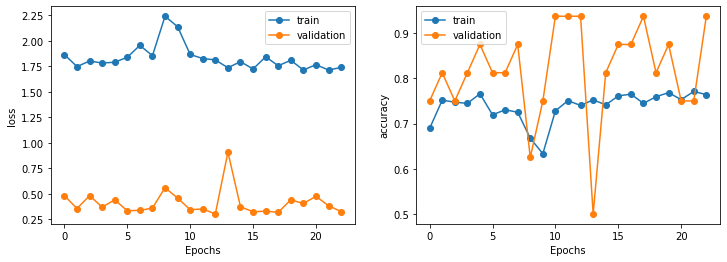

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_train_history(model_fit, 'loss','val_loss')
plt.subplot(1,2,2)
plot_train_history(model_fit, 'accuracy','val_accuracy')

# Capacity Progression

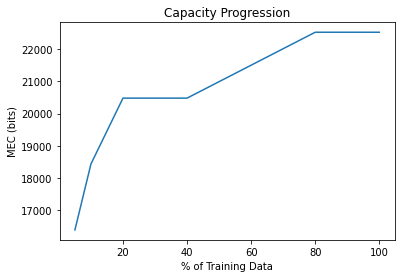

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot([5,10,20,40,80,100], np.asarray([8,9,10,10,11,11]) * 2048);
plt.title("Capacity Progression")
plt.xlabel("% of Training Data")
plt.ylabel("MEC (bits)");

In [ ]:
#Plot Accuracy vs Capacity
y = np.array([24581,157, 127,  76,71  ])
x = np.array([98.40, 94.48, 94.24, 93.46,92.90])
 
# Plotting the Graph
plt.plot(x, y)
plt.title("Accuracy/Capacity Curve")
plt.yscale("log")
plt.xlabel("Accuracy (%)")
plt.ylabel("Capacity (bits)")
plt.show()

# Train for Memorization

In [ ]:
#!/usr/bin/env python3
#
# This code has been produced by a free evaluation version of Brainome(tm).
# Portions of this code copyright (c) 2019-2022 by Brainome, Inc. All Rights Reserved.
# Brainome, Inc grants an exclusive (subject to our continuing rights to use and modify models),
# worldwide, non-sublicensable, and non-transferable limited license to use and modify this
# predictor produced through the input of your data:
# (i) for users accessing the service through a free evaluation account, solely for your
# own non-commercial purposes, including for the purpose of evaluating this service, and
# (ii) for users accessing the service through a paid, commercial use account, for your
# own internal  and commercial purposes.
# Please contact support@brainome.ai with any questions.
# Use of predictions results at your own risk.
#
# Output of Brainome v1.9-160-prod.
# Invocation: brainome -f NN -e3 -o gen4.py train_data.csv
# Total compiler execution time: 1:13:08.21. Finished on: May-13-2022 15:53:57.
# This source code requires Python 3.
#
"""

[01;1mPredictor:[0m                        
    Classifier Type:              Neural Network
    System Type:                  Binary classifier
    Training / Validation Split:  60% : 40%
    Accuracy:
      Best-guess accuracy:        77.77%
      Training accuracy:          99.80% (2997/3003 correct)
      Validation Accuracy:        93.46% (1873/2004 correct)
      Combined Model Accuracy:    97.26% (4870/5007 correct)


    Model Capacity (MEC):     24581    bits
    Generalization Ratio:         0.09 bits/bit
    Percent of Data Memorized:  2411.21%
    Resilience to Noise:           0.92 dB




    Training Confusion Matrix:
              Actual | Predicted
              ------ | ---------
1.000000000000000000e+00 |  2330     6 
0.000000000000000000e+00 |     0   667 

    Validation Confusion Matrix:
              Actual | Predicted
              ------ | ---------
1.000000000000000000e+00 |  1507    51 
0.000000000000000000e+00 |    80   366 

    Training Accuracy by Class:
1.000000000000000000e+00 |    TP    FP    TN    FN     TPR      TNR      PPV      NPV       F1       TS 
------------------------ | ----- ----- ----- ----- -------- -------- -------- -------- -------- --------
1.000000000000000000e+00 |  2330     0   667     6   99.74%  100.00%  100.00%   99.11%   99.87%   99.74%
0.000000000000000000e+00 |   667     6  2330     0  100.00%   99.74%   99.11%  100.00%   99.55%   99.11%

    Validation Accuracy by Class:
1.000000000000000000e+00 |    TP    FP    TN    FN     TPR      TNR      PPV      NPV       F1       TS 
------------------------ | ----- ----- ----- ----- -------- -------- -------- -------- -------- --------
1.000000000000000000e+00 |  1507    80   366    51   96.73%   82.06%   94.96%   87.77%   95.83%   92.00%
0.000000000000000000e+00 |   366    51  1507    80   82.06%   96.73%   87.77%   94.96%   84.82%   73.64%



"""

import sys
import math
import argparse
import csv
import binascii
import faulthandler
import json
try:
    import numpy as np  # For numpy see: http://numpy.org
except ImportError as e:
    print("This predictor requires the Numpy library. Please run 'python3 -m pip install numpy'.", file=sys.stderr)
    raise e
try:
    from scipy.sparse import coo_matrix
    report_cmat = True
except ImportError:
    print("Note: If you install scipy (https://www.scipy.org) this predictor generates a confusion matrix. Try 'python3 -m pip install scipy'.", file=sys.stderr)
    report_cmat = False

IOBUFF = 100000000
sys.setrecursionlimit(1000000)
random_filler_value = 'ba8db6eb493e918dd0b9b7facc14a63caf0749d4510adbd022df4c13b8ba8f5f'
TRAINFILE = ['train_data.csv']
mapping = {'1.000000000000000000e+00': 0, '0.000000000000000000e+00': 1}
ignorelabels = []
ignorecolumns = []
target = '1.000000000000000000e+00'
target_column = 12288
important_idxs = [0, 0, 0, 3, 3, 3, 6, 6, 6, 9, 9, 9, 12, 12, 12, 15, 15, 15, 18, 18, 18, 21, 21, 21, 24, 24, 24, 27, 27, 27, 30, 30, 30, 33, 33, 33, 36, 36, 36, 39, 39, 39, 42, 42, 42, 45, 45, 45, 48, 48, 48, 51, 51, 51, 54, 54, 54, 57, 57, 57, 60, 60, 60, 63, 63, 63, 66, 66, 66, 69, 69, 69, 72, 72, 72, 75, 75, 75, 78, 78, 78, 81, 81, 81, 84, 84, 84, 87, 87, 87, 90, 90, 90, 93, 93, 93, 96, 96, 96, 99, 99, 99, 102, 102, 102, 105, 105, 105, 108, 108, 108, 111, 111, 111, 114, 114, 114, 117, 117, 117, 120, 120, 120, 123, 123, 123, 126, 126, 126, 129, 129, 129, 132, 132, 132, 135, 135, 135, 138, 138, 138, 141, 141, 141, 144, 144, 144, 147, 147, 147, 150, 150, 150, 153, 153, 153, 156, 156, 156, 159, 159, 159, 162, 162, 162, 165, 165, 165, 168, 168, 168, 171, 171, 171, 174, 174, 174, 177, 177, 177, 180, 180, 180, 183, 183, 183, 186, 186, 186, 189, 189, 189, 0, 0, 0, 3, 3, 3, 6, 6, 6, 9, 9, 9, 12, 12, 12, 15, 15, 15, 18, 18, 18, 21, 21, 21, 24, 24, 24, 27, 27, 27, 30, 30, 30, 33, 33, 33, 36, 36, 36, 39, 39, 39, 42, 42, 42, 45, 45, 45, 48, 48, 48, 51, 51, 51, 54, 54, 54, 57, 57, 57, 60, 60, 60, 63, 63, 63, 66, 66, 66, 69, 69, 69, 72, 72, 72, 75, 75, 75, 78, 78, 78, 81, 81, 81, 84, 84, 84, 87, 87, 87, 90, 90, 90, 93, 93, 93, 96, 96, 96, 99, 99, 99, 102, 102, 102, 105, 105, 105, 108, 108, 108, 111, 111, 111, 114, 114, 114, 117, 117, 117, 120, 120, 120, 123, 123, 123, 126, 126, 126, 129, 129, 129, 132, 132, 132, 135, 135, 135, 138, 138, 138, 141, 141, 141, 144, 144, 144, 147, 147, 147, 150, 150, 150, 153, 153, 153, 156, 156, 156, 159, 159, 159, 162, 162, 162, 165, 165, 165, 168, 168, 168, 171, 171, 171, 174, 174, 174, 177, 177, 177, 180, 180, 180, 183, 183, 183, 186, 186, 186, 189, 189, 189, 0, 0, 0, 3, 3, 3, 6, 6, 6, 393, 393, 393, 396, 396, 396, 399, 399, 399, 402, 402, 402, 405, 405, 405, 408, 408, 408, 411, 411, 411, 414, 414, 414, 417, 417, 417, 420, 420, 420, 423, 423, 423, 426, 426, 426, 429, 429, 429, 432, 432, 432, 435, 435, 435, 438, 438, 438, 441, 441, 441, 444, 444, 444, 447, 447, 447, 450, 450, 450, 453, 453, 453, 456, 456, 456, 459, 459, 459, 462, 462, 462, 465, 465, 465, 468, 468, 468, 471, 471, 471, 474, 474, 474, 477, 477, 477, 480, 480, 480, 483, 483, 483, 486, 486, 486, 489, 489, 489, 492, 492, 492, 495, 495, 495, 498, 498, 498, 501, 501, 501, 504, 504, 504, 507, 507, 507, 510, 510, 510, 513, 513, 513, 516, 516, 516, 519, 519, 519, 522, 522, 522, 525, 525, 525, 528, 528, 528, 531, 531, 531, 534, 534, 534, 537, 537, 537, 540, 540, 540, 543, 543, 543, 546, 546, 546, 549, 549, 549, 552, 552, 552, 555, 555, 555, 558, 558, 558, 561, 561, 561, 564, 564, 564, 567, 567, 567, 570, 570, 570, 573, 573, 573, 0, 0, 0, 579, 579, 579, 582, 582, 582, 585, 585, 585, 588, 588, 588, 591, 591, 591, 594, 594, 594, 597, 597, 597, 600, 600, 600, 603, 603, 603, 606, 606, 606, 609, 609, 609, 612, 612, 612, 615, 615, 615, 618, 618, 618, 621, 621, 621, 624, 624, 624, 627, 627, 627, 630, 630, 630, 633, 633, 633, 636, 636, 636, 639, 639, 639, 642, 642, 642, 645, 645, 645, 648, 648, 648, 651, 651, 651, 654, 654, 654, 657, 657, 657, 660, 660, 660, 663, 663, 663, 666, 666, 666, 669, 669, 669, 672, 672, 672, 675, 675, 675, 678, 678, 678, 681, 681, 681, 684, 684, 684, 687, 687, 687, 690, 690, 690, 693, 693, 693, 696, 696, 696, 699, 699, 699, 702, 702, 702, 705, 705, 705, 708, 708, 708, 711, 711, 711, 714, 714, 714, 717, 717, 717, 720, 720, 720, 723, 723, 723, 726, 726, 726, 729, 729, 729, 732, 732, 732, 735, 735, 735, 738, 738, 738, 741, 741, 741, 744, 744, 744, 747, 747, 747, 750, 750, 750, 753, 753, 753, 756, 756, 756, 759, 759, 759, 762, 762, 762, 765, 765, 765, 0, 0, 0, 771, 771, 771, 774, 774, 774, 777, 777, 777, 780, 780, 780, 783, 783, 783, 786, 786, 786, 789, 789, 789, 792, 792, 792, 795, 795, 795, 798, 798, 798, 801, 801, 801, 804, 804, 804, 807, 807, 807, 810, 810, 810, 813, 813, 813, 816, 816, 816, 819, 819, 819, 822, 822, 822, 825, 825, 825, 828, 828, 828, 831, 831, 831, 834, 834, 834, 837, 837, 837, 840, 840, 840, 843, 843, 843, 846, 846, 846, 849, 849, 849, 852, 852, 852, 855, 855, 855, 858, 858, 858, 861, 861, 861, 864, 864, 864, 867, 867, 867, 870, 870, 870, 873, 873, 873, 876, 876, 876, 879, 879, 879, 882, 882, 882, 885, 885, 885, 888, 888, 888, 891, 891, 891, 894, 894, 894, 897, 897, 897, 900, 900, 900, 903, 903, 903, 906, 906, 906, 909, 909, 909, 912, 912, 912, 915, 915, 915, 918, 918, 918, 921, 921, 921, 924, 924, 924, 927, 927, 927, 930, 930, 930, 933, 933, 933, 936, 936, 936, 939, 939, 939, 942, 942, 942, 945, 945, 945, 948, 948, 948, 951, 951, 951, 954, 954, 954, 957, 957, 957, 0, 0, 0, 963, 963, 963, 966, 966, 966, 969, 969, 969, 972, 972, 972, 975, 975, 975, 978, 978, 978, 981, 981, 981, 984, 984, 984, 987, 987, 987, 990, 990, 990, 993, 993, 993, 996, 996, 996, 999, 999, 999, 1002, 1002, 1002, 1005, 1005, 1005, 1008, 1008, 1008, 1011, 1011, 1011, 1014, 1014, 1014, 1017, 1017, 1017, 1020, 1020, 1020, 1023, 1023, 1023, 1026, 1026, 1026, 1029, 1029, 1029, 1032, 1032, 1032, 1035, 1035, 1035, 1038, 1038, 1038, 1041, 1041, 1041, 1044, 1044, 1044, 1047, 1047, 1047, 1050, 1050, 1050, 1053, 1053, 1053, 1056, 1056, 1056, 1059, 1059, 1059, 1062, 1062, 1062, 1065, 1065, 1065, 1068, 1068, 1068, 1071, 1071, 1071, 1074, 1074, 1074, 1077, 1077, 1077, 1080, 1080, 1080, 1083, 1083, 1083, 1086, 1086, 1086, 1089, 1089, 1089, 1092, 1092, 1092, 1095, 1095, 1095, 1098, 1098, 1098, 1101, 1101, 1101, 1104, 1104, 1104, 1107, 1107, 1107, 1110, 1110, 1110, 1113, 1113, 1113, 1116, 1116, 1116, 1119, 1119, 1119, 1122, 1122, 1122, 1125, 1125, 1125, 1128, 1128, 1128, 1131, 1131, 1131, 1134, 1134, 1134, 1137, 1137, 1137, 1140, 1140, 1140, 1143, 1143, 1143, 1146, 1146, 1146, 1149, 1149, 1149, 0, 0, 0, 1155, 1155, 1155, 1158, 1158, 1158, 1161, 1161, 1161, 1164, 1164, 1164, 1167, 1167, 1167, 1170, 1170, 1170, 1173, 1173, 1173, 1176, 1176, 1176, 1179, 1179, 1179, 1182, 1182, 1182, 1185, 1185, 1185, 1188, 1188, 1188, 1191, 1191, 1191, 1194, 1194, 1194, 1197, 1197, 1197, 1200, 1200, 1200, 1203, 1203, 1203, 1206, 1206, 1206, 1209, 1209, 1209, 1212, 1212, 1212, 1215, 1215, 1215, 1218, 1218, 1218, 1221, 1221, 1221, 1224, 1224, 1224, 1227, 1227, 1227, 1230, 1230, 1230, 1233, 1233, 1233, 1236, 1236, 1236, 1239, 1239, 1239, 1242, 1242, 1242, 1245, 1245, 1245, 1248, 1248, 1248, 1251, 1251, 1251, 1254, 1254, 1254, 1257, 1257, 1257, 1260, 1260, 1260, 1263, 1263, 1263, 1266, 1266, 1266, 1269, 1269, 1269, 1272, 1272, 1272, 1275, 1275, 1275, 1278, 1278, 1278, 1281, 1281, 1281, 1284, 1284, 1284, 1287, 1287, 1287, 1290, 1290, 1290, 1293, 1293, 1293, 1296, 1296, 1296, 1299, 1299, 1299, 1302, 1302, 1302, 1305, 1305, 1305, 1308, 1308, 1308, 1311, 1311, 1311, 1314, 1314, 1314, 1317, 1317, 1317, 1320, 1320, 1320, 1323, 1323, 1323, 1326, 1326, 1326, 1329, 1329, 1329, 1332, 1332, 1332, 1335, 1335, 1335, 1338, 1338, 1338, 1341, 1341, 1341, 0, 0, 0, 0, 0, 0, 1350, 1350, 1350, 1353, 1353, 1353, 1356, 1356, 1356, 1359, 1359, 1359, 1362, 1362, 1362, 1365, 1365, 1365, 1368, 1368, 1368, 1371, 1371, 1371, 1374, 1374, 1374, 1377, 1377, 1377, 1380, 1380, 1380, 1383, 1383, 1383, 1386, 1386, 1386, 1389, 1389, 1389, 1392, 1392, 1392, 1395, 1395, 1395, 1398, 1398, 1398, 1401, 1401, 1401, 1404, 1404, 1404, 1407, 1407, 1407, 1410, 1410, 1410, 1413, 1413, 1413, 1416, 1416, 1416, 1419, 1419, 1419, 1422, 1422, 1422, 1425, 1425, 1425, 1428, 1428, 1428, 1431, 1431, 1431, 1434, 1434, 1434, 1437, 1437, 1437, 1440, 1440, 1440, 1443, 1443, 1443, 1446, 1446, 1446, 1449, 1449, 1449, 1452, 1452, 1452, 1455, 1455, 1455, 1458, 1458, 1458, 1461, 1461, 1461, 1464, 1464, 1464, 1467, 1467, 1467, 1470, 1470, 1470, 1473, 1473, 1473, 1476, 1476, 1476, 1479, 1479, 1479, 1482, 1482, 1482, 1485, 1485, 1485, 1488, 1488, 1488, 1491, 1491, 1491, 1494, 1494, 1494, 1497, 1497, 1497, 1500, 1500, 1500, 1503, 1503, 1503, 1506, 1506, 1506, 1509, 1509, 1509, 1512, 1512, 1512, 1515, 1515, 1515, 1518, 1518, 1518, 1521, 1521, 1521, 1524, 1524, 1524, 1527, 1527, 1527, 1530, 1530, 1530, 1533, 1533, 1533, 0, 0, 0, 0, 0, 0, 1542, 1542, 1542, 1545, 1545, 1545, 1548, 1548, 1548, 1551, 1551, 1551, 1554, 1554, 1554, 1557, 1557, 1557, 1560, 1560, 1560, 1563, 1563, 1563, 1566, 1566, 1566, 1569, 1569, 1569, 1572, 1572, 1572, 1575, 1575, 1575, 1578, 1578, 1578, 1581, 1581, 1581, 1584, 1584, 1584, 1587, 1587, 1587, 1590, 1590, 1590, 1593, 1593, 1593, 1596, 1596, 1596, 1599, 1599, 1599, 1602, 1602, 1602, 1605, 1605, 1605, 1608, 1608, 1608, 1611, 1611, 1611, 1614, 1614, 1614, 1617, 1617, 1617, 1620, 1620, 1620, 1623, 1623, 1623, 1626, 1626, 1626, 1629, 1629, 1629, 1632, 1632, 1632, 1635, 1635, 1635, 1638, 1638, 1638, 1641, 1641, 1641, 1644, 1644, 1644, 1647, 1647, 1647, 1650, 1650, 1650, 1653, 1653, 1653, 1656, 1656, 1656, 1659, 1659, 1659, 1662, 1662, 1662, 1665, 1665, 1665, 1668, 1668, 1668, 1671, 1671, 1671, 1674, 1674, 1674, 1677, 1677, 1677, 1680, 1680, 1680, 1683, 1683, 1683, 1686, 1686, 1686, 1689, 1689, 1689, 1692, 1692, 1692, 1695, 1695, 1695, 1698, 1698, 1698, 1701, 1701, 1701, 1704, 1704, 1704, 1707, 1707, 1707, 1710, 1710, 1710, 1713, 1713, 1713, 1716, 1716, 1716, 1719, 1719, 1719, 1722, 1722, 1722, 1725, 1725, 1725, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1737, 1737, 1737, 1740, 1740, 1740, 1743, 1743, 1743, 1746, 1746, 1746, 1749, 1749, 1749, 1752, 1752, 1752, 1755, 1755, 1755, 1758, 1758, 1758, 1761, 1761, 1761, 1764, 1764, 1764, 1767, 1767, 1767, 1770, 1770, 1770, 1773, 1773, 1773, 1776, 1776, 1776, 1779, 1779, 1779, 1782, 1782, 1782, 1785, 1785, 1785, 1788, 1788, 1788, 1791, 1791, 1791, 1794, 1794, 1794, 1797, 1797, 1797, 1800, 1800, 1800, 1803, 1803, 1803, 1806, 1806, 1806, 1809, 1809, 1809, 1812, 1812, 1812, 1815, 1815, 1815, 1818, 1818, 1818, 1821, 1821, 1821, 1824, 1824, 1824, 1827, 1827, 1827, 1830, 1830, 1830, 1833, 1833, 1833, 1836, 1836, 1836, 1839, 1839, 1839, 1842, 1842, 1842, 1845, 1845, 1845, 1848, 1848, 1848, 1851, 1851, 1851, 1854, 1854, 1854, 1857, 1857, 1857, 1860, 1860, 1860, 1863, 1863, 1863, 1866, 1866, 1866, 1869, 1869, 1869, 1872, 1872, 1872, 1875, 1875, 1875, 1878, 1878, 1878, 1881, 1881, 1881, 1884, 1884, 1884, 1887, 1887, 1887, 1890, 1890, 1890, 1893, 1893, 1893, 1896, 1896, 1896, 1899, 1899, 1899, 1902, 1902, 1902, 1905, 1905, 1905, 1908, 1908, 1908, 1911, 1911, 1911, 1914, 1914, 1914, 1917, 1917, 1917, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1929, 1929, 1929, 1932, 1932, 1932, 1935, 1935, 1935, 1938, 1938, 1938, 1941, 1941, 1941, 1944, 1944, 1944, 1947, 1947, 1947, 1950, 1950, 1950, 1953, 1953, 1953, 1956, 1956, 1956, 1959, 1959, 1959, 1962, 1962, 1962, 1965, 1965, 1965, 1968, 1968, 1968, 1971, 1971, 1971, 1974, 1974, 1974, 1977, 1977, 1977, 1980, 1980, 1980, 1983, 1983, 1983, 1986, 1986, 1986, 1989, 1989, 1989, 1992, 1992, 1992, 1995, 1995, 1995, 1998, 1998, 1998, 2001, 2001, 2001, 2004, 2004, 2004, 2007, 2007, 2007, 2010, 2010, 2010, 2013, 2013, 2013, 2016, 2016, 2016, 2019, 2019, 2019, 2022, 2022, 2022, 2025, 2025, 2025, 2028, 2028, 2028, 2031, 2031, 2031, 2034, 2034, 2034, 2037, 2037, 2037, 2040, 2040, 2040, 2043, 2043, 2043, 2046, 2046, 2046, 2049, 2049, 2049, 2052, 2052, 2052, 2055, 2055, 2055, 2058, 2058, 2058, 2061, 2061, 2061, 2064, 2064, 2064, 2067, 2067, 2067, 2070, 2070, 2070, 2073, 2073, 2073, 2076, 2076, 2076, 2079, 2079, 2079, 2082, 2082, 2082, 2085, 2085, 2085, 2088, 2088, 2088, 2091, 2091, 2091, 2094, 2094, 2094, 2097, 2097, 2097, 2100, 2100, 2100, 2103, 2103, 2103, 2106, 2106, 2106, 2109, 2109, 2109, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2121, 2121, 2121, 2124, 2124, 2124, 2127, 2127, 2127, 2130, 2130, 2130, 2133, 2133, 2133, 2136, 2136, 2136, 2139, 2139, 2139, 2142, 2142, 2142, 2145, 2145, 2145, 2148, 2148, 2148, 2151, 2151, 2151, 2154, 2154, 2154, 2157, 2157, 2157, 2160, 2160, 2160, 2163, 2163, 2163, 2166, 2166, 2166, 2169, 2169, 2169, 2172, 2172, 2172, 2175, 2175, 2175, 2178, 2178, 2178, 2181, 2181, 2181, 2184, 2184, 2184, 2187, 2187, 2187, 2190, 2190, 2190, 2193, 2193, 2193, 2196, 2196, 2196, 2199, 2199, 2199, 2202, 2202, 2202, 2205, 2205, 2205, 2208, 2208, 2208, 2211, 2211, 2211, 2214, 2214, 2214, 2217, 2217, 2217, 2220, 2220, 2220, 2223, 2223, 2223, 2226, 2226, 2226, 2229, 2229, 2229, 2232, 2232, 2232, 2235, 2235, 2235, 2238, 2238, 2238, 2241, 2241, 2241, 2244, 2244, 2244, 2247, 2247, 2247, 2250, 2250, 2250, 2253, 2253, 2253, 2256, 2256, 2256, 2259, 2259, 2259, 2262, 2262, 2262, 2265, 2265, 2265, 2268, 2268, 2268, 2271, 2271, 2271, 2274, 2274, 2274, 2277, 2277, 2277, 2280, 2280, 2280, 2283, 2283, 2283, 2286, 2286, 2286, 2289, 2289, 2289, 2292, 2292, 2292, 2295, 2295, 2295, 2298, 2298, 2298, 2301, 2301, 2301, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2313, 2313, 2313, 2316, 2316, 2316, 2319, 2319, 2319, 2322, 2322, 2322, 2325, 2325, 2325, 2328, 2328, 2328, 2331, 2331, 2331, 2334, 2334, 2334, 2337, 2337, 2337, 2340, 2340, 2340, 2343, 2343, 2343, 2346, 2346, 2346, 2349, 2349, 2349, 2352, 2352, 2352, 2355, 2355, 2355, 2358, 2358, 2358, 2361, 2361, 2361, 2364, 2364, 2364, 2367, 2367, 2367, 2370, 2370, 2370, 2373, 2373, 2373, 2376, 2376, 2376, 2379, 2379, 2379, 2382, 2382, 2382, 2385, 2385, 2385, 2388, 2388, 2388, 2391, 2391, 2391, 2394, 2394, 2394, 2397, 2397, 2397, 2400, 2400, 2400, 2403, 2403, 2403, 2406, 2406, 2406, 2409, 2409, 2409, 2412, 2412, 2412, 2415, 2415, 2415, 2418, 2418, 2418, 2421, 2421, 2421, 2424, 2424, 2424, 2427, 2427, 2427, 2430, 2430, 2430, 2433, 2433, 2433, 2436, 2436, 2436, 2439, 2439, 2439, 2442, 2442, 2442, 2445, 2445, 2445, 2448, 2448, 2448, 2451, 2451, 2451, 2454, 2454, 2454, 2457, 2457, 2457, 2460, 2460, 2460, 2463, 2463, 2463, 2466, 2466, 2466, 2469, 2469, 2469, 2472, 2472, 2472, 2475, 2475, 2475, 2478, 2478, 2478, 2481, 2481, 2481, 2484, 2484, 2484, 2487, 2487, 2487, 2490, 2490, 2490, 2493, 2493, 2493, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2505, 2505, 2505, 2508, 2508, 2508, 2511, 2511, 2511, 2514, 2514, 2514, 2517, 2517, 2517, 2520, 2520, 2520, 2523, 2523, 2523, 2526, 2526, 2526, 2529, 2529, 2529, 2532, 2532, 2532, 2535, 2535, 2535, 2538, 2538, 2538, 2541, 2541, 2541, 2544, 2544, 2544, 2547, 2547, 2547, 2550, 2550, 2550, 2553, 2553, 2553, 2556, 2556, 2556, 2559, 2559, 2559, 2562, 2562, 2562, 2565, 2565, 2565, 2568, 2568, 2568, 2571, 2571, 2571, 2574, 2574, 2574, 2577, 2577, 2577, 2580, 2580, 2580, 2583, 2583, 2583, 2586, 2586, 2586, 2589, 2589, 2589, 2592, 2592, 2592, 2595, 2595, 2595, 2598, 2598, 2598, 2601, 2601, 2601, 2604, 2604, 2604, 2607, 2607, 2607, 2610, 2610, 2610, 2613, 2613, 2613, 2616, 2616, 2616, 2619, 2619, 2619, 2622, 2622, 2622, 2625, 2625, 2625, 2628, 2628, 2628, 2631, 2631, 2631, 2634, 2634, 2634, 2637, 2637, 2637, 2640, 2640, 2640, 2643, 2643, 2643, 2646, 2646, 2646, 2649, 2649, 2649, 2652, 2652, 2652, 2655, 2655, 2655, 2658, 2658, 2658, 2661, 2661, 2661, 2664, 2664, 2664, 2667, 2667, 2667, 2670, 2670, 2670, 2673, 2673, 2673, 2676, 2676, 2676, 2679, 2679, 2679, 2682, 2682, 2682, 2685, 2685, 2685, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2505, 2505, 2505, 2700, 2700, 2700, 2703, 2703, 2703, 2706, 2706, 2706, 2709, 2709, 2709, 2712, 2712, 2712, 2715, 2715, 2715, 2718, 2718, 2718, 2721, 2721, 2721, 2724, 2724, 2724, 2727, 2727, 2727, 2730, 2730, 2730, 2733, 2733, 2733, 2736, 2736, 2736, 2739, 2739, 2739, 2742, 2742, 2742, 2745, 2745, 2745, 2748, 2748, 2748, 2751, 2751, 2751, 2754, 2754, 2754, 2757, 2757, 2757, 2760, 2760, 2760, 2763, 2763, 2763, 2766, 2766, 2766, 2769, 2769, 2769, 2772, 2772, 2772, 2775, 2775, 2775, 2778, 2778, 2778, 2781, 2781, 2781, 2784, 2784, 2784, 2787, 2787, 2787, 2790, 2790, 2790, 2793, 2793, 2793, 2796, 2796, 2796, 2799, 2799, 2799, 2802, 2802, 2802, 2805, 2805, 2805, 2808, 2808, 2808, 2811, 2811, 2811, 2814, 2814, 2814, 2817, 2817, 2817, 2820, 2820, 2820, 2823, 2823, 2823, 2826, 2826, 2826, 2829, 2829, 2829, 2832, 2832, 2832, 2835, 2835, 2835, 2838, 2838, 2838, 2841, 2841, 2841, 2844, 2844, 2844, 2847, 2847, 2847, 2850, 2850, 2850, 2853, 2853, 2853, 2856, 2856, 2856, 2859, 2859, 2859, 2862, 2862, 2862, 2865, 2865, 2865, 2868, 2868, 2868, 2871, 2871, 2871, 2874, 2874, 2874, 2877, 2877, 2877, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2505, 2505, 2505, 2892, 2892, 2892, 2895, 2895, 2895, 2898, 2898, 2898, 2901, 2901, 2901, 2904, 2904, 2904, 2907, 2907, 2907, 2910, 2910, 2910, 2913, 2913, 2913, 2916, 2916, 2916, 2919, 2919, 2919, 2922, 2922, 2922, 2925, 2925, 2925, 2928, 2928, 2928, 2931, 2931, 2931, 2934, 2934, 2934, 2937, 2937, 2937, 2940, 2940, 2940, 2943, 2943, 2943, 2946, 2946, 2946, 2949, 2949, 2949, 2952, 2952, 2952, 2955, 2955, 2955, 2958, 2958, 2958, 2961, 2961, 2961, 2964, 2964, 2964, 2967, 2967, 2967, 2970, 2970, 2970, 2973, 2973, 2973, 2976, 2976, 2976, 2979, 2979, 2979, 2982, 2982, 2982, 2985, 2985, 2985, 2988, 2988, 2988, 2991, 2991, 2991, 2994, 2994, 2994, 2997, 2997, 2997, 3000, 3000, 3000, 3003, 3003, 3003, 3006, 3006, 3006, 3009, 3009, 3009, 3012, 3012, 3012, 3015, 3015, 3015, 3018, 3018, 3018, 3021, 3021, 3021, 3024, 3024, 3024, 3027, 3027, 3027, 3030, 3030, 3030, 3033, 3033, 3033, 3036, 3036, 3036, 3039, 3039, 3039, 3042, 3042, 3042, 3045, 3045, 3045, 3048, 3048, 3048, 3051, 3051, 3051, 3054, 3054, 3054, 3057, 3057, 3057, 3060, 3060, 3060, 3063, 3063, 3063, 3066, 3066, 3066, 3069, 3069, 3069, 3072, 3072, 3072, 3075, 3075, 3075, 3078, 3078, 3078, 3081, 3081, 3081, 3084, 3084, 3084, 3087, 3087, 3087, 3090, 3090, 3090, 3093, 3093, 3093, 3096, 3096, 3096, 3099, 3099, 3099, 3102, 3102, 3102, 3105, 3105, 3105, 3108, 3108, 3108, 3111, 3111, 3111, 3114, 3114, 3114, 3117, 3117, 3117, 3120, 3120, 3120, 3123, 3123, 3123, 3126, 3126, 3126, 3129, 3129, 3129, 3132, 3132, 3132, 3135, 3135, 3135, 3138, 3138, 3138, 3141, 3141, 3141, 3144, 3144, 3144, 3147, 3147, 3147, 3150, 3150, 3150, 3153, 3153, 3153, 3156, 3156, 3156, 3159, 3159, 3159, 3162, 3162, 3162, 3165, 3165, 3165, 3168, 3168, 3168, 3171, 3171, 3171, 3174, 3174, 3174, 3177, 3177, 3177, 3180, 3180, 3180, 3183, 3183, 3183, 3186, 3186, 3186, 3189, 3189, 3189, 3192, 3192, 3192, 3195, 3195, 3195, 3198, 3198, 3198, 3201, 3201, 3201, 3204, 3204, 3204, 3207, 3207, 3207, 3210, 3210, 3210, 3213, 3213, 3213, 3216, 3216, 3216, 3219, 3219, 3219, 3222, 3222, 3222, 3225, 3225, 3225, 3228, 3228, 3228, 3231, 3231, 3231, 3234, 3234, 3234, 3237, 3237, 3237, 3240, 3240, 3240, 3243, 3243, 3243, 3246, 3246, 3246, 3249, 3249, 3249, 3252, 3252, 3252, 3255, 3255, 3255, 3258, 3258, 3258, 3261, 3261, 3261, 3264, 3264, 3264, 3267, 3267, 3267, 3270, 3270, 3270, 3273, 3273, 3273, 3276, 3276, 3276, 3279, 3279, 3279, 3282, 3282, 3282, 3285, 3285, 3285, 3288, 3288, 3288, 3291, 3291, 3291, 3294, 3294, 3294, 3297, 3297, 3297, 3300, 3300, 3300, 3303, 3303, 3303, 3306, 3306, 3306, 3309, 3309, 3309, 3312, 3312, 3312, 3315, 3315, 3315, 3318, 3318, 3318, 3321, 3321, 3321, 3324, 3324, 3324, 3327, 3327, 3327, 3330, 3330, 3330, 3333, 3333, 3333, 3336, 3336, 3336, 3339, 3339, 3339, 3342, 3342, 3342, 3345, 3345, 3345, 3348, 3348, 3348, 3351, 3351, 3351, 3354, 3354, 3354, 3357, 3357, 3357, 3360, 3360, 3360, 3363, 3363, 3363, 3366, 3366, 3366, 3369, 3369, 3369, 3372, 3372, 3372, 3375, 3375, 3375, 3378, 3378, 3378, 3381, 3381, 3381, 3384, 3384, 3384, 3387, 3387, 3387, 3390, 3390, 3390, 3393, 3393, 3393, 3396, 3396, 3396, 3399, 3399, 3399, 3402, 3402, 3402, 3405, 3405, 3405, 3408, 3408, 3408, 3411, 3411, 3411, 3414, 3414, 3414, 3417, 3417, 3417, 3420, 3420, 3420, 3423, 3423, 3423, 3426, 3426, 3426, 3429, 3429, 3429, 3432, 3432, 3432, 3435, 3435, 3435, 3438, 3438, 3438, 3441, 3441, 3441, 3444, 3444, 3444, 3447, 3447, 3447, 3450, 3450, 3450, 0, 0, 0, 0, 0, 0, 3459, 3459, 3459, 3462, 3462, 3462, 3465, 3465, 3465, 3468, 3468, 3468, 3471, 3471, 3471, 3474, 3474, 3474, 3477, 3477, 3477, 3480, 3480, 3480, 3483, 3483, 3483, 3486, 3486, 3486, 3489, 3489, 3489, 3492, 3492, 3492, 3495, 3495, 3495, 3498, 3498, 3498, 3501, 3501, 3501, 3504, 3504, 3504, 3507, 3507, 3507, 3510, 3510, 3510, 3513, 3513, 3513, 3516, 3516, 3516, 3519, 3519, 3519, 3522, 3522, 3522, 3525, 3525, 3525, 3528, 3528, 3528, 3531, 3531, 3531, 3534, 3534, 3534, 3537, 3537, 3537, 3540, 3540, 3540, 3543, 3543, 3543, 3546, 3546, 3546, 3549, 3549, 3549, 3552, 3552, 3552, 3555, 3555, 3555, 3558, 3558, 3558, 3561, 3561, 3561, 3564, 3564, 3564, 3567, 3567, 3567, 3570, 3570, 3570, 3573, 3573, 3573, 3576, 3576, 3576, 3579, 3579, 3579, 3582, 3582, 3582, 3585, 3585, 3585, 3588, 3588, 3588, 3591, 3591, 3591, 3594, 3594, 3594, 3597, 3597, 3597, 3600, 3600, 3600, 3603, 3603, 3603, 3606, 3606, 3606, 3609, 3609, 3609, 3612, 3612, 3612, 3615, 3615, 3615, 3618, 3618, 3618, 3621, 3621, 3621, 3624, 3624, 3624, 3627, 3627, 3627, 3630, 3630, 3630, 3633, 3633, 3633, 3636, 3636, 3636, 3639, 3639, 3639, 3642, 3642, 3642, 0, 0, 0, 0, 0, 0, 3459, 3459, 3459, 3462, 3462, 3462, 3657, 3657, 3657, 3660, 3660, 3660, 3663, 3663, 3663, 3666, 3666, 3666, 3669, 3669, 3669, 3672, 3672, 3672, 3675, 3675, 3675, 3678, 3678, 3678, 3681, 3681, 3681, 3684, 3684, 3684, 3687, 3687, 3687, 3690, 3690, 3690, 3693, 3693, 3693, 3696, 3696, 3696, 3699, 3699, 3699, 3702, 3702, 3702, 3705, 3705, 3705, 3708, 3708, 3708, 3711, 3711, 3711, 3714, 3714, 3714, 3717, 3717, 3717, 3720, 3720, 3720, 3723, 3723, 3723, 3726, 3726, 3726, 3729, 3729, 3729, 3732, 3732, 3732, 3735, 3735, 3735, 3738, 3738, 3738, 3741, 3741, 3741, 3744, 3744, 3744, 3747, 3747, 3747, 3750, 3750, 3750, 3753, 3753, 3753, 3756, 3756, 3756, 3759, 3759, 3759, 3762, 3762, 3762, 3765, 3765, 3765, 3768, 3768, 3768, 3771, 3771, 3771, 3774, 3774, 3774, 3777, 3777, 3777, 3780, 3780, 3780, 3783, 3783, 3783, 3786, 3786, 3786, 3789, 3789, 3789, 3792, 3792, 3792, 3795, 3795, 3795, 3798, 3798, 3798, 3801, 3801, 3801, 3804, 3804, 3804, 3807, 3807, 3807, 3810, 3810, 3810, 3813, 3813, 3813, 3816, 3816, 3816, 3819, 3819, 3819, 3822, 3822, 3822, 3825, 3825, 3825, 3828, 3828, 3828, 3831, 3831, 3831, 3834, 3834, 3834, 0, 0, 0, 0, 0, 0, 3459, 3459, 3459, 3846, 3846, 3846, 3849, 3849, 3849, 3852, 3852, 3852, 3855, 3855, 3855, 3858, 3858, 3858, 3861, 3861, 3861, 3864, 3864, 3864, 3867, 3867, 3867, 3870, 3870, 3870, 3873, 3873, 3873, 3876, 3876, 3876, 3879, 3879, 3879, 3882, 3882, 3882, 3885, 3885, 3885, 3888, 3888, 3888, 3891, 3891, 3891, 3894, 3894, 3894, 3897, 3897, 3897, 3900, 3900, 3900, 3903, 3903, 3903, 3906, 3906, 3906, 3909, 3909, 3909, 3912, 3912, 3912, 3915, 3915, 3915, 3918, 3918, 3918, 3921, 3921, 3921, 3924, 3924, 3924, 3927, 3927, 3927, 3930, 3930, 3930, 3933, 3933, 3933, 3936, 3936, 3936, 3939, 3939, 3939, 3942, 3942, 3942, 3945, 3945, 3945, 3948, 3948, 3948, 3951, 3951, 3951, 3954, 3954, 3954, 3957, 3957, 3957, 3960, 3960, 3960, 3963, 3963, 3963, 3966, 3966, 3966, 3969, 3969, 3969, 3972, 3972, 3972, 3975, 3975, 3975, 3978, 3978, 3978, 3981, 3981, 3981, 3984, 3984, 3984, 3987, 3987, 3987, 3990, 3990, 3990, 3993, 3993, 3993, 3996, 3996, 3996, 3999, 3999, 3999, 4002, 4002, 4002, 4005, 4005, 4005, 4008, 4008, 4008, 4011, 4011, 4011, 4014, 4014, 4014, 4017, 4017, 4017, 4020, 4020, 4020, 4023, 4023, 4023, 4026, 4026, 4026, 0, 0, 0, 0, 0, 0, 3459, 3459, 3459, 4038, 4038, 4038, 4041, 4041, 4041, 4044, 4044, 4044, 4047, 4047, 4047, 4050, 4050, 4050, 4053, 4053, 4053, 4056, 4056, 4056, 4059, 4059, 4059, 4062, 4062, 4062, 4065, 4065, 4065, 4068, 4068, 4068, 4071, 4071, 4071, 4074, 4074, 4074, 4077, 4077, 4077, 4080, 4080, 4080, 4083, 4083, 4083, 4086, 4086, 4086, 4089, 4089, 4089, 4092, 4092, 4092, 4095, 4095, 4095, 4098, 4098, 4098, 4101, 4101, 4101, 4104, 4104, 4104, 4107, 4107, 4107, 4110, 4110, 4110, 4113, 4113, 4113, 4116, 4116, 4116, 4119, 4119, 4119, 4122, 4122, 4122, 4125, 4125, 4125, 4128, 4128, 4128, 4131, 4131, 4131, 4134, 4134, 4134, 4137, 4137, 4137, 4140, 4140, 4140, 4143, 4143, 4143, 4146, 4146, 4146, 4149, 4149, 4149, 4152, 4152, 4152, 4155, 4155, 4155, 4158, 4158, 4158, 4161, 4161, 4161, 4164, 4164, 4164, 4167, 4167, 4167, 4170, 4170, 4170, 4173, 4173, 4173, 4176, 4176, 4176, 4179, 4179, 4179, 4182, 4182, 4182, 4185, 4185, 4185, 4188, 4188, 4188, 4191, 4191, 4191, 4194, 4194, 4194, 4197, 4197, 4197, 4200, 4200, 4200, 4203, 4203, 4203, 4206, 4206, 4206, 4209, 4209, 4209, 4212, 4212, 4212, 4215, 4215, 4215, 4218, 4218, 4218, 0, 0, 0, 0, 0, 0, 3459, 3459, 3459, 4230, 4230, 4230, 4233, 4233, 4233, 4236, 4236, 4236, 4239, 4239, 4239, 4242, 4242, 4242, 4245, 4245, 4245, 4248, 4248, 4248, 4251, 4251, 4251, 4254, 4254, 4254, 4257, 4257, 4257, 4260, 4260, 4260, 4263, 4263, 4263, 4266, 4266, 4266, 4269, 4269, 4269, 4272, 4272, 4272, 4275, 4275, 4275, 4278, 4278, 4278, 4281, 4281, 4281, 4284, 4284, 4284, 4287, 4287, 4287, 4290, 4290, 4290, 4293, 4293, 4293, 4296, 4296, 4296, 4299, 4299, 4299, 4302, 4302, 4302, 4305, 4305, 4305, 4308, 4308, 4308, 4311, 4311, 4311, 4314, 4314, 4314, 4317, 4317, 4317, 4320, 4320, 4320, 4323, 4323, 4323, 4326, 4326, 4326, 4329, 4329, 4329, 4332, 4332, 4332, 4335, 4335, 4335, 4338, 4338, 4338, 4341, 4341, 4341, 4344, 4344, 4344, 4347, 4347, 4347, 4350, 4350, 4350, 4353, 4353, 4353, 4356, 4356, 4356, 4359, 4359, 4359, 4362, 4362, 4362, 4365, 4365, 4365, 4368, 4368, 4368, 4371, 4371, 4371, 4374, 4374, 4374, 4377, 4377, 4377, 4380, 4380, 4380, 4383, 4383, 4383, 4386, 4386, 4386, 4389, 4389, 4389, 4392, 4392, 4392, 4395, 4395, 4395, 4398, 4398, 4398, 4401, 4401, 4401, 4404, 4404, 4404, 4407, 4407, 4407, 4410, 4410, 4410, 0, 0, 0, 4416, 4416, 4416, 4419, 4419, 4419, 4422, 4422, 4422, 4425, 4425, 4425, 4428, 4428, 4428, 4431, 4431, 4431, 4434, 4434, 4434, 4437, 4437, 4437, 4440, 4440, 4440, 4443, 4443, 4443, 4446, 4446, 4446, 4449, 4449, 4449, 4452, 4452, 4452, 4455, 4455, 4455, 4458, 4458, 4458, 4461, 4461, 4461, 4464, 4464, 4464, 4467, 4467, 4467, 4470, 4470, 4470, 4473, 4473, 4473, 4476, 4476, 4476, 4479, 4479, 4479, 4482, 4482, 4482, 4485, 4485, 4485, 4488, 4488, 4488, 4491, 4491, 4491, 4494, 4494, 4494, 4497, 4497, 4497, 4500, 4500, 4500, 4503, 4503, 4503, 4506, 4506, 4506, 4509, 4509, 4509, 4512, 4512, 4512, 4515, 4515, 4515, 4518, 4518, 4518, 4521, 4521, 4521, 4524, 4524, 4524, 4527, 4527, 4527, 4530, 4530, 4530, 4533, 4533, 4533, 4536, 4536, 4536, 4539, 4539, 4539, 4542, 4542, 4542, 4545, 4545, 4545, 4548, 4548, 4548, 4551, 4551, 4551, 4554, 4554, 4554, 4557, 4557, 4557, 4560, 4560, 4560, 4563, 4563, 4563, 4566, 4566, 4566, 4569, 4569, 4569, 4572, 4572, 4572, 4575, 4575, 4575, 4578, 4578, 4578, 4581, 4581, 4581, 4584, 4584, 4584, 4587, 4587, 4587, 4590, 4590, 4590, 4593, 4593, 4593, 4596, 4596, 4596, 4599, 4599, 4599, 4602, 4602, 4602, 0, 0, 0, 4608, 4608, 4608, 4611, 4611, 4611, 4614, 4614, 4614, 4617, 4617, 4617, 4620, 4620, 4620, 4623, 4623, 4623, 4626, 4626, 4626, 4629, 4629, 4629, 4632, 4632, 4632, 4635, 4635, 4635, 4638, 4638, 4638, 4641, 4641, 4641, 4644, 4644, 4644, 4647, 4647, 4647, 4650, 4650, 4650, 4653, 4653, 4653, 4656, 4656, 4656, 4659, 4659, 4659, 4662, 4662, 4662, 4665, 4665, 4665, 4668, 4668, 4668, 4671, 4671, 4671, 4674, 4674, 4674, 4677, 4677, 4677, 4680, 4680, 4680, 4683, 4683, 4683, 4686, 4686, 4686, 4689, 4689, 4689, 4692, 4692, 4692, 4695, 4695, 4695, 4698, 4698, 4698, 4701, 4701, 4701, 4704, 4704, 4704, 4707, 4707, 4707, 4710, 4710, 4710, 4713, 4713, 4713, 4716, 4716, 4716, 4719, 4719, 4719, 4722, 4722, 4722, 4725, 4725, 4725, 4728, 4728, 4728, 4731, 4731, 4731, 4734, 4734, 4734, 4737, 4737, 4737, 4740, 4740, 4740, 4743, 4743, 4743, 4746, 4746, 4746, 4749, 4749, 4749, 4752, 4752, 4752, 4755, 4755, 4755, 4758, 4758, 4758, 4761, 4761, 4761, 4764, 4764, 4764, 4767, 4767, 4767, 4770, 4770, 4770, 4773, 4773, 4773, 4776, 4776, 4776, 4779, 4779, 4779, 4782, 4782, 4782, 4785, 4785, 4785, 4788, 4788, 4788, 4791, 4791, 4791, 4794, 4794, 4794, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4809, 4809, 4809, 4812, 4812, 4812, 4815, 4815, 4815, 4818, 4818, 4818, 4821, 4821, 4821, 4824, 4824, 4824, 4827, 4827, 4827, 4830, 4830, 4830, 4833, 4833, 4833, 4836, 4836, 4836, 4839, 4839, 4839, 4842, 4842, 4842, 4845, 4845, 4845, 4848, 4848, 4848, 4851, 4851, 4851, 4854, 4854, 4854, 4857, 4857, 4857, 4860, 4860, 4860, 4863, 4863, 4863, 4866, 4866, 4866, 4869, 4869, 4869, 4872, 4872, 4872, 4875, 4875, 4875, 4878, 4878, 4878, 4881, 4881, 4881, 4884, 4884, 4884, 4887, 4887, 4887, 4890, 4890, 4890, 4893, 4893, 4893, 4896, 4896, 4896, 4899, 4899, 4899, 4902, 4902, 4902, 4905, 4905, 4905, 4908, 4908, 4908, 4911, 4911, 4911, 4914, 4914, 4914, 4917, 4917, 4917, 4920, 4920, 4920, 4923, 4923, 4923, 4926, 4926, 4926, 4929, 4929, 4929, 4932, 4932, 4932, 4935, 4935, 4935, 4938, 4938, 4938, 4941, 4941, 4941, 4944, 4944, 4944, 4947, 4947, 4947, 4950, 4950, 4950, 4953, 4953, 4953, 4956, 4956, 4956, 4959, 4959, 4959, 4962, 4962, 4962, 4965, 4965, 4965, 4968, 4968, 4968, 4971, 4971, 4971, 4974, 4974, 4974, 4977, 4977, 4977, 4980, 4980, 4980, 4983, 4983, 4983, 4986, 4986, 4986, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2505, 2505, 2505, 5004, 5004, 5004, 5007, 5007, 5007, 5010, 5010, 5010, 5013, 5013, 5013, 5016, 5016, 5016, 5019, 5019, 5019, 5022, 5022, 5022, 5025, 5025, 5025, 5028, 5028, 5028, 5031, 5031, 5031, 5034, 5034, 5034, 5037, 5037, 5037, 5040, 5040, 5040, 5043, 5043, 5043, 5046, 5046, 5046, 5049, 5049, 5049, 5052, 5052, 5052, 5055, 5055, 5055, 5058, 5058, 5058, 5061, 5061, 5061, 5064, 5064, 5064, 5067, 5067, 5067, 5070, 5070, 5070, 5073, 5073, 5073, 5076, 5076, 5076, 5079, 5079, 5079, 5082, 5082, 5082, 5085, 5085, 5085, 5088, 5088, 5088, 5091, 5091, 5091, 5094, 5094, 5094, 5097, 5097, 5097, 5100, 5100, 5100, 5103, 5103, 5103, 5106, 5106, 5106, 5109, 5109, 5109, 5112, 5112, 5112, 5115, 5115, 5115, 5118, 5118, 5118, 5121, 5121, 5121, 5124, 5124, 5124, 5127, 5127, 5127, 5130, 5130, 5130, 5133, 5133, 5133, 5136, 5136, 5136, 5139, 5139, 5139, 5142, 5142, 5142, 5145, 5145, 5145, 5148, 5148, 5148, 5151, 5151, 5151, 5154, 5154, 5154, 5157, 5157, 5157, 5160, 5160, 5160, 5163, 5163, 5163, 5166, 5166, 5166, 5169, 5169, 5169, 5172, 5172, 5172, 5175, 5175, 5175, 5178, 5178, 5178, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5193, 5193, 5193, 5196, 5196, 5196, 5199, 5199, 5199, 5202, 5202, 5202, 5205, 5205, 5205, 5208, 5208, 5208, 5211, 5211, 5211, 5214, 5214, 5214, 5217, 5217, 5217, 5220, 5220, 5220, 5223, 5223, 5223, 5226, 5226, 5226, 5229, 5229, 5229, 5232, 5232, 5232, 5235, 5235, 5235, 5238, 5238, 5238, 5241, 5241, 5241, 5244, 5244, 5244, 5247, 5247, 5247, 5250, 5250, 5250, 5253, 5253, 5253, 5256, 5256, 5256, 5259, 5259, 5259, 5262, 5262, 5262, 5265, 5265, 5265, 5268, 5268, 5268, 5271, 5271, 5271, 5274, 5274, 5274, 5277, 5277, 5277, 5280, 5280, 5280, 5283, 5283, 5283, 5286, 5286, 5286, 5289, 5289, 5289, 5292, 5292, 5292, 5295, 5295, 5295, 5298, 5298, 5298, 5301, 5301, 5301, 5304, 5304, 5304, 5307, 5307, 5307, 5310, 5310, 5310, 5313, 5313, 5313, 5316, 5316, 5316, 5319, 5319, 5319, 5322, 5322, 5322, 5325, 5325, 5325, 5328, 5328, 5328, 5331, 5331, 5331, 5334, 5334, 5334, 5337, 5337, 5337, 5340, 5340, 5340, 5343, 5343, 5343, 5346, 5346, 5346, 5349, 5349, 5349, 5352, 5352, 5352, 5355, 5355, 5355, 5358, 5358, 5358, 5361, 5361, 5361, 5364, 5364, 5364, 5367, 5367, 5367, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5385, 5385, 5385, 5388, 5388, 5388, 5391, 5391, 5391, 5394, 5394, 5394, 5397, 5397, 5397, 5400, 5400, 5400, 5403, 5403, 5403, 5406, 5406, 5406, 5409, 5409, 5409, 5412, 5412, 5412, 5415, 5415, 5415, 5418, 5418, 5418, 5421, 5421, 5421, 5424, 5424, 5424, 5427, 5427, 5427, 5430, 5430, 5430, 5433, 5433, 5433, 5436, 5436, 5436, 5439, 5439, 5439, 5442, 5442, 5442, 5445, 5445, 5445, 5448, 5448, 5448, 5451, 5451, 5451, 5454, 5454, 5454, 5457, 5457, 5457, 5460, 5460, 5460, 5463, 5463, 5463, 5466, 5466, 5466, 5469, 5469, 5469, 5472, 5472, 5472, 5475, 5475, 5475, 5478, 5478, 5478, 5481, 5481, 5481, 5484, 5484, 5484, 5487, 5487, 5487, 5490, 5490, 5490, 5493, 5493, 5493, 5496, 5496, 5496, 5499, 5499, 5499, 5502, 5502, 5502, 5505, 5505, 5505, 5508, 5508, 5508, 5511, 5511, 5511, 5514, 5514, 5514, 5517, 5517, 5517, 5520, 5520, 5520, 5523, 5523, 5523, 5526, 5526, 5526, 5529, 5529, 5529, 5532, 5532, 5532, 5535, 5535, 5535, 5538, 5538, 5538, 5541, 5541, 5541, 5544, 5544, 5544, 5547, 5547, 5547, 5550, 5550, 5550, 5553, 5553, 5553, 5556, 5556, 5556, 5559, 5559, 5559, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5577, 5577, 5577, 5580, 5580, 5580, 5583, 5583, 5583, 5586, 5586, 5586, 5589, 5589, 5589, 5592, 5592, 5592, 5595, 5595, 5595, 5598, 5598, 5598, 5601, 5601, 5601, 5604, 5604, 5604, 5607, 5607, 5607, 5610, 5610, 5610, 5613, 5613, 5613, 5616, 5616, 5616, 5619, 5619, 5619, 5622, 5622, 5622, 5625, 5625, 5625, 5628, 5628, 5628, 5631, 5631, 5631, 5634, 5634, 5634, 5637, 5637, 5637, 5640, 5640, 5640, 5643, 5643, 5643, 5646, 5646, 5646, 5649, 5649, 5649, 5652, 5652, 5652, 5655, 5655, 5655, 5658, 5658, 5658, 5661, 5661, 5661, 5664, 5664, 5664, 5667, 5667, 5667, 5670, 5670, 5670, 5673, 5673, 5673, 5676, 5676, 5676, 5679, 5679, 5679, 5682, 5682, 5682, 5685, 5685, 5685, 5688, 5688, 5688, 5691, 5691, 5691, 5694, 5694, 5694, 5697, 5697, 5697, 5700, 5700, 5700, 5703, 5703, 5703, 5706, 5706, 5706, 5709, 5709, 5709, 5712, 5712, 5712, 5715, 5715, 5715, 5718, 5718, 5718, 5721, 5721, 5721, 5724, 5724, 5724, 5727, 5727, 5727, 5730, 5730, 5730, 5733, 5733, 5733, 5736, 5736, 5736, 5739, 5739, 5739, 5742, 5742, 5742, 5745, 5745, 5745, 5748, 5748, 5748, 5751, 5751, 5751, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2505, 2505, 2505, 5772, 5772, 5772, 5775, 5775, 5775, 5778, 5778, 5778, 5781, 5781, 5781, 5784, 5784, 5784, 5787, 5787, 5787, 5790, 5790, 5790, 5793, 5793, 5793, 5796, 5796, 5796, 5799, 5799, 5799, 5802, 5802, 5802, 5805, 5805, 5805, 5808, 5808, 5808, 5811, 5811, 5811, 5814, 5814, 5814, 5817, 5817, 5817, 5820, 5820, 5820, 5823, 5823, 5823, 5826, 5826, 5826, 5829, 5829, 5829, 5832, 5832, 5832, 5835, 5835, 5835, 5838, 5838, 5838, 5841, 5841, 5841, 5844, 5844, 5844, 5847, 5847, 5847, 5850, 5850, 5850, 5853, 5853, 5853, 5856, 5856, 5856, 5859, 5859, 5859, 5862, 5862, 5862, 5865, 5865, 5865, 5868, 5868, 5868, 5871, 5871, 5871, 5874, 5874, 5874, 5877, 5877, 5877, 5880, 5880, 5880, 5883, 5883, 5883, 5886, 5886, 5886, 5889, 5889, 5889, 5892, 5892, 5892, 5895, 5895, 5895, 5898, 5898, 5898, 5901, 5901, 5901, 5904, 5904, 5904, 5907, 5907, 5907, 5910, 5910, 5910, 5913, 5913, 5913, 5916, 5916, 5916, 5919, 5919, 5919, 5922, 5922, 5922, 5925, 5925, 5925, 5928, 5928, 5928, 5931, 5931, 5931, 5934, 5934, 5934, 5937, 5937, 5937, 5940, 5940, 5940, 5751, 5751, 5751, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2505, 2505, 2505, 5772, 5772, 5772, 5967, 5967, 5967, 5970, 5970, 5970, 5973, 5973, 5973, 5976, 5976, 5976, 5979, 5979, 5979, 5982, 5982, 5982, 5985, 5985, 5985, 5988, 5988, 5988, 5991, 5991, 5991, 5994, 5994, 5994, 5997, 5997, 5997, 6000, 6000, 6000, 6003, 6003, 6003, 6006, 6006, 6006, 6009, 6009, 6009, 6012, 6012, 6012, 6015, 6015, 6015, 6018, 6018, 6018, 6021, 6021, 6021, 6024, 6024, 6024, 6027, 6027, 6027, 6030, 6030, 6030, 6033, 6033, 6033, 6036, 6036, 6036, 6039, 6039, 6039, 6042, 6042, 6042, 6045, 6045, 6045, 6048, 6048, 6048, 6051, 6051, 6051, 6054, 6054, 6054, 6057, 6057, 6057, 6060, 6060, 6060, 6063, 6063, 6063, 6066, 6066, 6066, 6069, 6069, 6069, 6072, 6072, 6072, 6075, 6075, 6075, 6078, 6078, 6078, 6081, 6081, 6081, 6084, 6084, 6084, 6087, 6087, 6087, 6090, 6090, 6090, 6093, 6093, 6093, 6096, 6096, 6096, 6099, 6099, 6099, 6102, 6102, 6102, 6105, 6105, 6105, 6108, 6108, 6108, 6111, 6111, 6111, 6114, 6114, 6114, 6117, 6117, 6117, 6120, 6120, 6120, 6123, 6123, 6123, 6126, 6126, 6126, 6129, 6129, 6129, 6132, 6132, 6132, 5751, 5751, 5751, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6153, 6153, 6153, 6156, 6156, 6156, 6159, 6159, 6159, 6162, 6162, 6162, 6165, 6165, 6165, 6168, 6168, 6168, 6171, 6171, 6171, 6174, 6174, 6174, 6177, 6177, 6177, 6180, 6180, 6180, 6183, 6183, 6183, 6186, 6186, 6186, 6189, 6189, 6189, 6192, 6192, 6192, 6195, 6195, 6195, 6198, 6198, 6198, 6201, 6201, 6201, 6204, 6204, 6204, 6207, 6207, 6207, 6210, 6210, 6210, 6213, 6213, 6213, 6216, 6216, 6216, 6219, 6219, 6219, 6222, 6222, 6222, 6225, 6225, 6225, 6228, 6228, 6228, 6231, 6231, 6231, 6234, 6234, 6234, 6237, 6237, 6237, 6240, 6240, 6240, 6243, 6243, 6243, 6246, 6246, 6246, 6249, 6249, 6249, 6252, 6252, 6252, 6255, 6255, 6255, 6258, 6258, 6258, 6261, 6261, 6261, 6264, 6264, 6264, 6267, 6267, 6267, 6270, 6270, 6270, 6273, 6273, 6273, 6276, 6276, 6276, 6279, 6279, 6279, 6282, 6282, 6282, 6285, 6285, 6285, 6288, 6288, 6288, 6291, 6291, 6291, 6294, 6294, 6294, 6297, 6297, 6297, 6300, 6300, 6300, 6303, 6303, 6303, 6306, 6306, 6306, 6309, 6309, 6309, 6312, 6312, 6312, 6315, 6315, 6315, 6318, 6318, 6318, 6321, 6321, 6321, 6132, 6132, 6132, 5751, 5751, 5751, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6345, 6345, 6345, 6348, 6348, 6348, 6351, 6351, 6351, 6354, 6354, 6354, 6357, 6357, 6357, 6360, 6360, 6360, 6363, 6363, 6363, 6366, 6366, 6366, 6369, 6369, 6369, 6372, 6372, 6372, 6375, 6375, 6375, 6378, 6378, 6378, 6381, 6381, 6381, 6384, 6384, 6384, 6387, 6387, 6387, 6390, 6390, 6390, 6393, 6393, 6393, 6396, 6396, 6396, 6399, 6399, 6399, 6402, 6402, 6402, 6405, 6405, 6405, 6408, 6408, 6408, 6411, 6411, 6411, 6414, 6414, 6414, 6417, 6417, 6417, 6420, 6420, 6420, 6423, 6423, 6423, 6426, 6426, 6426, 6429, 6429, 6429, 6432, 6432, 6432, 6435, 6435, 6435, 6438, 6438, 6438, 6441, 6441, 6441, 6444, 6444, 6444, 6447, 6447, 6447, 6450, 6450, 6450, 6453, 6453, 6453, 6456, 6456, 6456, 6459, 6459, 6459, 6462, 6462, 6462, 6465, 6465, 6465, 6468, 6468, 6468, 6471, 6471, 6471, 6474, 6474, 6474, 6477, 6477, 6477, 6480, 6480, 6480, 6483, 6483, 6483, 6486, 6486, 6486, 6489, 6489, 6489, 6492, 6492, 6492, 6495, 6495, 6495, 6498, 6498, 6498, 6501, 6501, 6501, 6504, 6504, 6504, 6507, 6507, 6507, 6510, 6510, 6510, 6513, 6513, 6513, 6516, 6516, 6516, 6519, 6519, 6519, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6537, 6537, 6537, 6540, 6540, 6540, 6543, 6543, 6543, 6546, 6546, 6546, 6549, 6549, 6549, 6552, 6552, 6552, 6555, 6555, 6555, 6558, 6558, 6558, 6561, 6561, 6561, 6564, 6564, 6564, 6567, 6567, 6567, 6570, 6570, 6570, 6573, 6573, 6573, 6576, 6576, 6576, 6579, 6579, 6579, 6582, 6582, 6582, 6585, 6585, 6585, 6588, 6588, 6588, 6591, 6591, 6591, 6594, 6594, 6594, 6597, 6597, 6597, 6600, 6600, 6600, 6603, 6603, 6603, 6606, 6606, 6606, 6609, 6609, 6609, 6612, 6612, 6612, 6615, 6615, 6615, 6618, 6618, 6618, 6621, 6621, 6621, 6624, 6624, 6624, 6627, 6627, 6627, 6630, 6630, 6630, 6633, 6633, 6633, 6636, 6636, 6636, 6639, 6639, 6639, 6642, 6642, 6642, 6645, 6645, 6645, 6648, 6648, 6648, 6651, 6651, 6651, 6654, 6654, 6654, 6657, 6657, 6657, 6660, 6660, 6660, 6663, 6663, 6663, 6666, 6666, 6666, 6669, 6669, 6669, 6672, 6672, 6672, 6675, 6675, 6675, 6678, 6678, 6678, 6681, 6681, 6681, 6684, 6684, 6684, 6687, 6687, 6687, 6690, 6690, 6690, 6693, 6693, 6693, 6696, 6696, 6696, 6699, 6699, 6699, 6702, 6702, 6702, 6705, 6705, 6705, 6708, 6708, 6708, 6711, 6711, 6711, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6732, 6732, 6732, 6735, 6735, 6735, 6738, 6738, 6738, 6741, 6741, 6741, 6744, 6744, 6744, 6747, 6747, 6747, 6750, 6750, 6750, 6753, 6753, 6753, 6756, 6756, 6756, 6759, 6759, 6759, 6762, 6762, 6762, 6765, 6765, 6765, 6768, 6768, 6768, 6771, 6771, 6771, 6774, 6774, 6774, 6777, 6777, 6777, 6780, 6780, 6780, 6783, 6783, 6783, 6786, 6786, 6786, 6789, 6789, 6789, 6792, 6792, 6792, 6795, 6795, 6795, 6798, 6798, 6798, 6801, 6801, 6801, 6804, 6804, 6804, 6807, 6807, 6807, 6810, 6810, 6810, 6813, 6813, 6813, 6816, 6816, 6816, 6819, 6819, 6819, 6822, 6822, 6822, 6825, 6825, 6825, 6828, 6828, 6828, 6831, 6831, 6831, 6834, 6834, 6834, 6837, 6837, 6837, 6840, 6840, 6840, 6843, 6843, 6843, 6846, 6846, 6846, 6849, 6849, 6849, 6852, 6852, 6852, 6855, 6855, 6855, 6858, 6858, 6858, 6861, 6861, 6861, 6864, 6864, 6864, 6867, 6867, 6867, 6870, 6870, 6870, 6873, 6873, 6873, 6876, 6876, 6876, 6879, 6879, 6879, 6882, 6882, 6882, 6885, 6885, 6885, 6888, 6888, 6888, 6891, 6891, 6891, 6894, 6894, 6894, 6897, 6897, 6897, 6900, 6900, 6900, 6903, 6903, 6903, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6924, 6924, 6924, 6927, 6927, 6927, 6930, 6930, 6930, 6933, 6933, 6933, 6936, 6936, 6936, 6939, 6939, 6939, 6942, 6942, 6942, 6945, 6945, 6945, 6948, 6948, 6948, 6951, 6951, 6951, 6954, 6954, 6954, 6957, 6957, 6957, 6960, 6960, 6960, 6963, 6963, 6963, 6966, 6966, 6966, 6969, 6969, 6969, 6972, 6972, 6972, 6975, 6975, 6975, 6978, 6978, 6978, 6981, 6981, 6981, 6984, 6984, 6984, 6987, 6987, 6987, 6990, 6990, 6990, 6993, 6993, 6993, 6996, 6996, 6996, 6999, 6999, 6999, 7002, 7002, 7002, 7005, 7005, 7005, 7008, 7008, 7008, 7011, 7011, 7011, 7014, 7014, 7014, 7017, 7017, 7017, 7020, 7020, 7020, 7023, 7023, 7023, 7026, 7026, 7026, 7029, 7029, 7029, 7032, 7032, 7032, 7035, 7035, 7035, 7038, 7038, 7038, 7041, 7041, 7041, 7044, 7044, 7044, 7047, 7047, 7047, 7050, 7050, 7050, 7053, 7053, 7053, 7056, 7056, 7056, 7059, 7059, 7059, 7062, 7062, 7062, 7065, 7065, 7065, 7068, 7068, 7068, 7071, 7071, 7071, 7074, 7074, 7074, 7077, 7077, 7077, 7080, 7080, 7080, 7083, 7083, 7083, 7086, 7086, 7086, 7089, 7089, 7089, 7092, 7092, 7092, 7095, 7095, 7095, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6519, 6519, 6519, 7119, 7119, 7119, 7122, 7122, 7122, 7125, 7125, 7125, 7128, 7128, 7128, 7131, 7131, 7131, 7134, 7134, 7134, 7137, 7137, 7137, 7140, 7140, 7140, 7143, 7143, 7143, 7146, 7146, 7146, 7149, 7149, 7149, 7152, 7152, 7152, 7155, 7155, 7155, 7158, 7158, 7158, 7161, 7161, 7161, 7164, 7164, 7164, 7167, 7167, 7167, 7170, 7170, 7170, 7173, 7173, 7173, 7176, 7176, 7176, 7179, 7179, 7179, 7182, 7182, 7182, 7185, 7185, 7185, 7188, 7188, 7188, 7191, 7191, 7191, 7194, 7194, 7194, 7197, 7197, 7197, 7200, 7200, 7200, 7203, 7203, 7203, 7206, 7206, 7206, 7209, 7209, 7209, 7212, 7212, 7212, 7215, 7215, 7215, 7218, 7218, 7218, 7221, 7221, 7221, 7224, 7224, 7224, 7227, 7227, 7227, 7230, 7230, 7230, 7233, 7233, 7233, 7236, 7236, 7236, 7239, 7239, 7239, 7242, 7242, 7242, 7245, 7245, 7245, 7248, 7248, 7248, 7251, 7251, 7251, 7254, 7254, 7254, 7257, 7257, 7257, 7260, 7260, 7260, 7263, 7263, 7263, 7266, 7266, 7266, 7269, 7269, 7269, 7272, 7272, 7272, 7275, 7275, 7275, 7278, 7278, 7278, 7281, 7281, 7281, 7284, 7284, 7284, 7287, 7287, 7287, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7308, 7308, 7308, 7311, 7311, 7311, 7314, 7314, 7314, 7317, 7317, 7317, 7320, 7320, 7320, 7323, 7323, 7323, 7326, 7326, 7326, 7329, 7329, 7329, 7332, 7332, 7332, 7335, 7335, 7335, 7338, 7338, 7338, 7341, 7341, 7341, 7344, 7344, 7344, 7347, 7347, 7347, 7350, 7350, 7350, 7353, 7353, 7353, 7356, 7356, 7356, 7359, 7359, 7359, 7362, 7362, 7362, 7365, 7365, 7365, 7368, 7368, 7368, 7371, 7371, 7371, 7374, 7374, 7374, 7377, 7377, 7377, 7380, 7380, 7380, 7383, 7383, 7383, 7386, 7386, 7386, 7389, 7389, 7389, 7392, 7392, 7392, 7395, 7395, 7395, 7398, 7398, 7398, 7401, 7401, 7401, 7404, 7404, 7404, 7407, 7407, 7407, 7410, 7410, 7410, 7413, 7413, 7413, 7416, 7416, 7416, 7419, 7419, 7419, 7422, 7422, 7422, 7425, 7425, 7425, 7428, 7428, 7428, 7431, 7431, 7431, 7434, 7434, 7434, 7437, 7437, 7437, 7440, 7440, 7440, 7443, 7443, 7443, 7446, 7446, 7446, 7449, 7449, 7449, 7452, 7452, 7452, 7455, 7455, 7455, 7458, 7458, 7458, 7461, 7461, 7461, 7464, 7464, 7464, 7467, 7467, 7467, 7470, 7470, 7470, 7473, 7473, 7473, 7476, 7476, 7476, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7503, 7503, 7503, 7506, 7506, 7506, 7509, 7509, 7509, 7512, 7512, 7512, 7515, 7515, 7515, 7518, 7518, 7518, 7521, 7521, 7521, 7524, 7524, 7524, 7527, 7527, 7527, 7530, 7530, 7530, 7533, 7533, 7533, 7536, 7536, 7536, 7539, 7539, 7539, 7542, 7542, 7542, 7545, 7545, 7545, 7548, 7548, 7548, 7551, 7551, 7551, 7554, 7554, 7554, 7557, 7557, 7557, 7560, 7560, 7560, 7563, 7563, 7563, 7566, 7566, 7566, 7569, 7569, 7569, 7572, 7572, 7572, 7575, 7575, 7575, 7578, 7578, 7578, 7581, 7581, 7581, 7584, 7584, 7584, 7587, 7587, 7587, 7590, 7590, 7590, 7593, 7593, 7593, 7596, 7596, 7596, 7599, 7599, 7599, 7602, 7602, 7602, 7605, 7605, 7605, 7608, 7608, 7608, 7611, 7611, 7611, 7614, 7614, 7614, 7617, 7617, 7617, 7620, 7620, 7620, 7623, 7623, 7623, 7626, 7626, 7626, 7629, 7629, 7629, 7632, 7632, 7632, 7635, 7635, 7635, 7638, 7638, 7638, 7641, 7641, 7641, 7644, 7644, 7644, 7647, 7647, 7647, 7650, 7650, 7650, 7653, 7653, 7653, 7656, 7656, 7656, 7659, 7659, 7659, 7662, 7662, 7662, 7665, 7665, 7665, 7668, 7668, 7668, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7695, 7695, 7695, 7698, 7698, 7698, 7701, 7701, 7701, 7704, 7704, 7704, 7707, 7707, 7707, 7710, 7710, 7710, 7713, 7713, 7713, 7716, 7716, 7716, 7719, 7719, 7719, 7722, 7722, 7722, 7725, 7725, 7725, 7728, 7728, 7728, 7731, 7731, 7731, 7734, 7734, 7734, 7737, 7737, 7737, 7740, 7740, 7740, 7743, 7743, 7743, 7746, 7746, 7746, 7749, 7749, 7749, 7752, 7752, 7752, 7755, 7755, 7755, 7758, 7758, 7758, 7761, 7761, 7761, 7764, 7764, 7764, 7767, 7767, 7767, 7770, 7770, 7770, 7773, 7773, 7773, 7776, 7776, 7776, 7779, 7779, 7779, 7782, 7782, 7782, 7785, 7785, 7785, 7788, 7788, 7788, 7791, 7791, 7791, 7794, 7794, 7794, 7797, 7797, 7797, 7800, 7800, 7800, 7803, 7803, 7803, 7806, 7806, 7806, 7809, 7809, 7809, 7812, 7812, 7812, 7815, 7815, 7815, 7818, 7818, 7818, 7821, 7821, 7821, 7824, 7824, 7824, 7827, 7827, 7827, 7830, 7830, 7830, 7833, 7833, 7833, 7836, 7836, 7836, 7839, 7839, 7839, 7842, 7842, 7842, 7845, 7845, 7845, 7848, 7848, 7848, 7851, 7851, 7851, 7854, 7854, 7854, 7857, 7857, 7857, 7860, 7860, 7860, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7887, 7887, 7887, 7890, 7890, 7890, 7893, 7893, 7893, 7896, 7896, 7896, 7899, 7899, 7899, 7902, 7902, 7902, 7905, 7905, 7905, 7908, 7908, 7908, 7911, 7911, 7911, 7914, 7914, 7914, 7917, 7917, 7917, 7920, 7920, 7920, 7923, 7923, 7923, 7926, 7926, 7926, 7929, 7929, 7929, 7932, 7932, 7932, 7935, 7935, 7935, 7938, 7938, 7938, 7941, 7941, 7941, 7944, 7944, 7944, 7947, 7947, 7947, 7950, 7950, 7950, 7953, 7953, 7953, 7956, 7956, 7956, 7959, 7959, 7959, 7962, 7962, 7962, 7965, 7965, 7965, 7968, 7968, 7968, 7971, 7971, 7971, 7974, 7974, 7974, 7977, 7977, 7977, 7980, 7980, 7980, 7983, 7983, 7983, 7986, 7986, 7986, 7989, 7989, 7989, 7992, 7992, 7992, 7995, 7995, 7995, 7998, 7998, 7998, 8001, 8001, 8001, 8004, 8004, 8004, 8007, 8007, 8007, 8010, 8010, 8010, 8013, 8013, 8013, 8016, 8016, 8016, 8019, 8019, 8019, 8022, 8022, 8022, 8025, 8025, 8025, 8028, 8028, 8028, 8031, 8031, 8031, 8034, 8034, 8034, 8037, 8037, 8037, 8040, 8040, 8040, 8043, 8043, 8043, 8046, 8046, 8046, 8049, 8049, 8049, 8052, 8052, 8052, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8073, 8073, 8073, 8076, 8076, 8076, 8079, 8079, 8079, 8082, 8082, 8082, 8085, 8085, 8085, 8088, 8088, 8088, 8091, 8091, 8091, 8094, 8094, 8094, 8097, 8097, 8097, 8100, 8100, 8100, 8103, 8103, 8103, 8106, 8106, 8106, 8109, 8109, 8109, 8112, 8112, 8112, 8115, 8115, 8115, 8118, 8118, 8118, 8121, 8121, 8121, 8124, 8124, 8124, 8127, 8127, 8127, 8130, 8130, 8130, 8133, 8133, 8133, 8136, 8136, 8136, 8139, 8139, 8139, 8142, 8142, 8142, 8145, 8145, 8145, 8148, 8148, 8148, 8151, 8151, 8151, 8154, 8154, 8154, 8157, 8157, 8157, 8160, 8160, 8160, 8163, 8163, 8163, 8166, 8166, 8166, 8169, 8169, 8169, 8172, 8172, 8172, 8175, 8175, 8175, 8178, 8178, 8178, 8181, 8181, 8181, 8184, 8184, 8184, 8187, 8187, 8187, 8190, 8190, 8190, 8193, 8193, 8193, 8196, 8196, 8196, 8199, 8199, 8199, 8202, 8202, 8202, 8205, 8205, 8205, 8208, 8208, 8208, 8211, 8211, 8211, 8214, 8214, 8214, 8217, 8217, 8217, 8220, 8220, 8220, 8223, 8223, 8223, 8226, 8226, 8226, 8229, 8229, 8229, 8232, 8232, 8232, 8235, 8235, 8235, 8238, 8238, 8238, 8241, 8241, 8241, 8244, 8244, 8244, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8265, 8265, 8265, 8268, 8268, 8268, 8271, 8271, 8271, 8274, 8274, 8274, 8277, 8277, 8277, 8280, 8280, 8280, 8283, 8283, 8283, 8286, 8286, 8286, 8289, 8289, 8289, 8292, 8292, 8292, 8295, 8295, 8295, 8298, 8298, 8298, 8301, 8301, 8301, 8304, 8304, 8304, 8307, 8307, 8307, 8310, 8310, 8310, 8313, 8313, 8313, 8316, 8316, 8316, 8319, 8319, 8319, 8322, 8322, 8322, 8325, 8325, 8325, 8328, 8328, 8328, 8331, 8331, 8331, 8334, 8334, 8334, 8337, 8337, 8337, 8340, 8340, 8340, 8343, 8343, 8343, 8346, 8346, 8346, 8349, 8349, 8349, 8352, 8352, 8352, 8355, 8355, 8355, 8358, 8358, 8358, 8361, 8361, 8361, 8364, 8364, 8364, 8367, 8367, 8367, 8370, 8370, 8370, 8373, 8373, 8373, 8376, 8376, 8376, 8379, 8379, 8379, 8382, 8382, 8382, 8385, 8385, 8385, 8388, 8388, 8388, 8391, 8391, 8391, 8394, 8394, 8394, 8397, 8397, 8397, 8400, 8400, 8400, 8403, 8403, 8403, 8406, 8406, 8406, 8409, 8409, 8409, 8412, 8412, 8412, 8415, 8415, 8415, 8418, 8418, 8418, 8421, 8421, 8421, 8424, 8424, 8424, 8427, 8427, 8427, 8430, 8430, 8430, 8433, 8433, 8433, 8436, 8436, 8436, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8463, 8463, 8463, 8466, 8466, 8466, 8469, 8469, 8469, 8472, 8472, 8472, 8475, 8475, 8475, 8478, 8478, 8478, 8481, 8481, 8481, 8484, 8484, 8484, 8487, 8487, 8487, 8490, 8490, 8490, 8493, 8493, 8493, 8496, 8496, 8496, 8499, 8499, 8499, 8502, 8502, 8502, 8505, 8505, 8505, 8508, 8508, 8508, 8511, 8511, 8511, 8514, 8514, 8514, 8517, 8517, 8517, 8520, 8520, 8520, 8523, 8523, 8523, 8526, 8526, 8526, 8529, 8529, 8529, 8532, 8532, 8532, 8535, 8535, 8535, 8538, 8538, 8538, 8541, 8541, 8541, 8544, 8544, 8544, 8547, 8547, 8547, 8550, 8550, 8550, 8553, 8553, 8553, 8556, 8556, 8556, 8559, 8559, 8559, 8562, 8562, 8562, 8565, 8565, 8565, 8568, 8568, 8568, 8571, 8571, 8571, 8574, 8574, 8574, 8577, 8577, 8577, 8580, 8580, 8580, 8583, 8583, 8583, 8586, 8586, 8586, 8589, 8589, 8589, 8592, 8592, 8592, 8595, 8595, 8595, 8598, 8598, 8598, 8601, 8601, 8601, 8604, 8604, 8604, 8607, 8607, 8607, 8610, 8610, 8610, 8613, 8613, 8613, 8616, 8616, 8616, 8619, 8619, 8619, 8622, 8622, 8622, 8625, 8625, 8625, 8628, 8628, 8628, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7695, 7695, 7695, 8658, 8658, 8658, 8661, 8661, 8661, 8664, 8664, 8664, 8667, 8667, 8667, 8670, 8670, 8670, 8673, 8673, 8673, 8676, 8676, 8676, 8679, 8679, 8679, 8682, 8682, 8682, 8685, 8685, 8685, 8688, 8688, 8688, 8691, 8691, 8691, 8694, 8694, 8694, 8697, 8697, 8697, 8700, 8700, 8700, 8703, 8703, 8703, 8706, 8706, 8706, 8709, 8709, 8709, 8712, 8712, 8712, 8715, 8715, 8715, 8718, 8718, 8718, 8721, 8721, 8721, 8724, 8724, 8724, 8727, 8727, 8727, 8730, 8730, 8730, 8733, 8733, 8733, 8736, 8736, 8736, 8739, 8739, 8739, 8742, 8742, 8742, 8745, 8745, 8745, 8748, 8748, 8748, 8751, 8751, 8751, 8754, 8754, 8754, 8757, 8757, 8757, 8760, 8760, 8760, 8763, 8763, 8763, 8766, 8766, 8766, 8769, 8769, 8769, 8772, 8772, 8772, 8775, 8775, 8775, 8778, 8778, 8778, 8781, 8781, 8781, 8784, 8784, 8784, 8787, 8787, 8787, 8790, 8790, 8790, 8793, 8793, 8793, 8796, 8796, 8796, 8799, 8799, 8799, 8802, 8802, 8802, 8805, 8805, 8805, 8808, 8808, 8808, 8811, 8811, 8811, 8814, 8814, 8814, 8817, 8817, 8817, 8820, 8820, 8820, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8847, 8847, 8847, 8850, 8850, 8850, 8853, 8853, 8853, 8856, 8856, 8856, 8859, 8859, 8859, 8862, 8862, 8862, 8865, 8865, 8865, 8868, 8868, 8868, 8871, 8871, 8871, 8874, 8874, 8874, 8877, 8877, 8877, 8880, 8880, 8880, 8883, 8883, 8883, 8886, 8886, 8886, 8889, 8889, 8889, 8892, 8892, 8892, 8895, 8895, 8895, 8898, 8898, 8898, 8901, 8901, 8901, 8904, 8904, 8904, 8907, 8907, 8907, 8910, 8910, 8910, 8913, 8913, 8913, 8916, 8916, 8916, 8919, 8919, 8919, 8922, 8922, 8922, 8925, 8925, 8925, 8928, 8928, 8928, 8931, 8931, 8931, 8934, 8934, 8934, 8937, 8937, 8937, 8940, 8940, 8940, 8943, 8943, 8943, 8946, 8946, 8946, 8949, 8949, 8949, 8952, 8952, 8952, 8955, 8955, 8955, 8958, 8958, 8958, 8961, 8961, 8961, 8964, 8964, 8964, 8967, 8967, 8967, 8970, 8970, 8970, 8973, 8973, 8973, 8976, 8976, 8976, 8979, 8979, 8979, 8982, 8982, 8982, 8985, 8985, 8985, 8988, 8988, 8988, 8991, 8991, 8991, 8994, 8994, 8994, 8997, 8997, 8997, 9000, 9000, 9000, 9003, 9003, 9003, 9006, 9006, 9006, 9009, 9009, 9009, 9012, 9012, 9012, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9039, 9039, 9039, 9042, 9042, 9042, 9045, 9045, 9045, 9048, 9048, 9048, 9051, 9051, 9051, 9054, 9054, 9054, 9057, 9057, 9057, 9060, 9060, 9060, 9063, 9063, 9063, 9066, 9066, 9066, 9069, 9069, 9069, 9072, 9072, 9072, 9075, 9075, 9075, 9078, 9078, 9078, 9081, 9081, 9081, 9084, 9084, 9084, 9087, 9087, 9087, 9090, 9090, 9090, 9093, 9093, 9093, 9096, 9096, 9096, 9099, 9099, 9099, 9102, 9102, 9102, 9105, 9105, 9105, 9108, 9108, 9108, 9111, 9111, 9111, 9114, 9114, 9114, 9117, 9117, 9117, 9120, 9120, 9120, 9123, 9123, 9123, 9126, 9126, 9126, 9129, 9129, 9129, 9132, 9132, 9132, 9135, 9135, 9135, 9138, 9138, 9138, 9141, 9141, 9141, 9144, 9144, 9144, 9147, 9147, 9147, 9150, 9150, 9150, 9153, 9153, 9153, 9156, 9156, 9156, 9159, 9159, 9159, 9162, 9162, 9162, 9165, 9165, 9165, 9168, 9168, 9168, 9171, 9171, 9171, 9174, 9174, 9174, 9177, 9177, 9177, 9180, 9180, 9180, 9183, 9183, 9183, 9186, 9186, 9186, 9189, 9189, 9189, 9192, 9192, 9192, 9195, 9195, 9195, 9198, 9198, 9198, 9201, 9201, 9201, 9204, 9204, 9204, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9231, 9231, 9231, 9234, 9234, 9234, 9237, 9237, 9237, 9240, 9240, 9240, 9243, 9243, 9243, 9246, 9246, 9246, 9249, 9249, 9249, 9252, 9252, 9252, 9255, 9255, 9255, 9258, 9258, 9258, 9261, 9261, 9261, 9264, 9264, 9264, 9267, 9267, 9267, 9270, 9270, 9270, 9273, 9273, 9273, 9276, 9276, 9276, 9279, 9279, 9279, 9282, 9282, 9282, 9285, 9285, 9285, 9288, 9288, 9288, 9291, 9291, 9291, 9294, 9294, 9294, 9297, 9297, 9297, 9300, 9300, 9300, 9303, 9303, 9303, 9306, 9306, 9306, 9309, 9309, 9309, 9312, 9312, 9312, 9315, 9315, 9315, 9318, 9318, 9318, 9321, 9321, 9321, 9324, 9324, 9324, 9327, 9327, 9327, 9330, 9330, 9330, 9333, 9333, 9333, 9336, 9336, 9336, 9339, 9339, 9339, 9342, 9342, 9342, 9345, 9345, 9345, 9348, 9348, 9348, 9351, 9351, 9351, 9354, 9354, 9354, 9357, 9357, 9357, 9360, 9360, 9360, 9363, 9363, 9363, 9366, 9366, 9366, 9369, 9369, 9369, 9372, 9372, 9372, 9375, 9375, 9375, 9378, 9378, 9378, 9381, 9381, 9381, 9384, 9384, 9384, 9387, 9387, 9387, 9390, 9390, 9390, 9393, 9393, 9393, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9423, 9423, 9423, 9426, 9426, 9426, 9429, 9429, 9429, 9432, 9432, 9432, 9435, 9435, 9435, 9438, 9438, 9438, 9441, 9441, 9441, 9444, 9444, 9444, 9447, 9447, 9447, 9450, 9450, 9450, 9453, 9453, 9453, 9456, 9456, 9456, 9459, 9459, 9459, 9462, 9462, 9462, 9465, 9465, 9465, 9468, 9468, 9468, 9471, 9471, 9471, 9474, 9474, 9474, 9477, 9477, 9477, 9480, 9480, 9480, 9483, 9483, 9483, 9486, 9486, 9486, 9489, 9489, 9489, 9492, 9492, 9492, 9495, 9495, 9495, 9498, 9498, 9498, 9501, 9501, 9501, 9504, 9504, 9504, 9507, 9507, 9507, 9510, 9510, 9510, 9513, 9513, 9513, 9516, 9516, 9516, 9519, 9519, 9519, 9522, 9522, 9522, 9525, 9525, 9525, 9528, 9528, 9528, 9531, 9531, 9531, 9534, 9534, 9534, 9537, 9537, 9537, 9540, 9540, 9540, 9543, 9543, 9543, 9546, 9546, 9546, 9549, 9549, 9549, 9552, 9552, 9552, 9555, 9555, 9555, 9558, 9558, 9558, 9561, 9561, 9561, 9564, 9564, 9564, 9567, 9567, 9567, 9570, 9570, 9570, 9573, 9573, 9573, 9576, 9576, 9576, 9579, 9579, 9579, 9582, 9582, 9582, 9585, 9585, 9585, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9615, 9615, 9615, 9618, 9618, 9618, 9621, 9621, 9621, 9624, 9624, 9624, 9627, 9627, 9627, 9630, 9630, 9630, 9633, 9633, 9633, 9636, 9636, 9636, 9639, 9639, 9639, 9642, 9642, 9642, 9645, 9645, 9645, 9648, 9648, 9648, 9651, 9651, 9651, 9654, 9654, 9654, 9657, 9657, 9657, 9660, 9660, 9660, 9663, 9663, 9663, 9666, 9666, 9666, 9669, 9669, 9669, 9672, 9672, 9672, 9675, 9675, 9675, 9678, 9678, 9678, 9681, 9681, 9681, 9684, 9684, 9684, 9687, 9687, 9687, 9690, 9690, 9690, 9693, 9693, 9693, 9696, 9696, 9696, 9699, 9699, 9699, 9702, 9702, 9702, 9705, 9705, 9705, 9708, 9708, 9708, 9711, 9711, 9711, 9714, 9714, 9714, 9717, 9717, 9717, 9720, 9720, 9720, 9723, 9723, 9723, 9726, 9726, 9726, 9729, 9729, 9729, 9732, 9732, 9732, 9735, 9735, 9735, 9738, 9738, 9738, 9741, 9741, 9741, 9744, 9744, 9744, 9747, 9747, 9747, 9750, 9750, 9750, 9753, 9753, 9753, 9756, 9756, 9756, 9759, 9759, 9759, 9762, 9762, 9762, 9765, 9765, 9765, 9768, 9768, 9768, 9771, 9771, 9771, 9774, 9774, 9774, 9777, 9777, 9777, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9807, 9807, 9807, 9810, 9810, 9810, 9813, 9813, 9813, 9816, 9816, 9816, 9819, 9819, 9819, 9822, 9822, 9822, 9825, 9825, 9825, 9828, 9828, 9828, 9831, 9831, 9831, 9834, 9834, 9834, 9837, 9837, 9837, 9840, 9840, 9840, 9843, 9843, 9843, 9846, 9846, 9846, 9849, 9849, 9849, 9852, 9852, 9852, 9855, 9855, 9855, 9858, 9858, 9858, 9861, 9861, 9861, 9864, 9864, 9864, 9867, 9867, 9867, 9870, 9870, 9870, 9873, 9873, 9873, 9876, 9876, 9876, 9879, 9879, 9879, 9882, 9882, 9882, 9885, 9885, 9885, 9888, 9888, 9888, 9891, 9891, 9891, 9894, 9894, 9894, 9897, 9897, 9897, 9900, 9900, 9900, 9903, 9903, 9903, 9906, 9906, 9906, 9909, 9909, 9909, 9912, 9912, 9912, 9915, 9915, 9915, 9918, 9918, 9918, 9921, 9921, 9921, 9924, 9924, 9924, 9927, 9927, 9927, 9930, 9930, 9930, 9933, 9933, 9933, 9936, 9936, 9936, 9939, 9939, 9939, 9942, 9942, 9942, 9945, 9945, 9945, 9948, 9948, 9948, 9951, 9951, 9951, 9954, 9954, 9954, 9957, 9957, 9957, 9960, 9960, 9960, 9963, 9963, 9963, 9966, 9966, 9966, 9969, 9969, 9969, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9999, 9999, 9999, 10002, 10002, 10002, 10005, 10005, 10005, 10008, 10008, 10008, 10011, 10011, 10011, 10014, 10014, 10014, 10017, 10017, 10017, 10020, 10020, 10020, 10023, 10023, 10023, 10026, 10026, 10026, 10029, 10029, 10029, 10032, 10032, 10032, 10035, 10035, 10035, 10038, 10038, 10038, 10041, 10041, 10041, 10044, 10044, 10044, 10047, 10047, 10047, 10050, 10050, 10050, 10053, 10053, 10053, 10056, 10056, 10056, 10059, 10059, 10059, 10062, 10062, 10062, 10065, 10065, 10065, 10068, 10068, 10068, 10071, 10071, 10071, 10074, 10074, 10074, 10077, 10077, 10077, 10080, 10080, 10080, 10083, 10083, 10083, 10086, 10086, 10086, 10089, 10089, 10089, 10092, 10092, 10092, 10095, 10095, 10095, 10098, 10098, 10098, 10101, 10101, 10101, 10104, 10104, 10104, 10107, 10107, 10107, 10110, 10110, 10110, 10113, 10113, 10113, 10116, 10116, 10116, 10119, 10119, 10119, 10122, 10122, 10122, 10125, 10125, 10125, 10128, 10128, 10128, 10131, 10131, 10131, 10134, 10134, 10134, 10137, 10137, 10137, 10140, 10140, 10140, 10143, 10143, 10143, 10146, 10146, 10146, 10149, 10149, 10149, 10152, 10152, 10152, 10155, 10155, 10155, 10158, 10158, 10158, 10161, 10161, 10161, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10191, 10191, 10191, 10194, 10194, 10194, 10197, 10197, 10197, 10200, 10200, 10200, 10203, 10203, 10203, 10206, 10206, 10206, 10209, 10209, 10209, 10212, 10212, 10212, 10215, 10215, 10215, 10218, 10218, 10218, 10221, 10221, 10221, 10224, 10224, 10224, 10227, 10227, 10227, 10230, 10230, 10230, 10233, 10233, 10233, 10236, 10236, 10236, 10239, 10239, 10239, 10242, 10242, 10242, 10245, 10245, 10245, 10248, 10248, 10248, 10251, 10251, 10251, 10254, 10254, 10254, 10257, 10257, 10257, 10260, 10260, 10260, 10263, 10263, 10263, 10266, 10266, 10266, 10269, 10269, 10269, 10272, 10272, 10272, 10275, 10275, 10275, 10278, 10278, 10278, 10281, 10281, 10281, 10284, 10284, 10284, 10287, 10287, 10287, 10290, 10290, 10290, 10293, 10293, 10293, 10296, 10296, 10296, 10299, 10299, 10299, 10302, 10302, 10302, 10305, 10305, 10305, 10308, 10308, 10308, 10311, 10311, 10311, 10314, 10314, 10314, 10317, 10317, 10317, 10320, 10320, 10320, 10323, 10323, 10323, 10326, 10326, 10326, 10329, 10329, 10329, 10332, 10332, 10332, 10335, 10335, 10335, 10338, 10338, 10338, 10341, 10341, 10341, 10344, 10344, 10344, 10347, 10347, 10347, 10350, 10350, 10350, 10353, 10353, 10353, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10383, 10383, 10383, 10386, 10386, 10386, 10389, 10389, 10389, 10392, 10392, 10392, 10395, 10395, 10395, 10398, 10398, 10398, 10401, 10401, 10401, 10404, 10404, 10404, 10407, 10407, 10407, 10410, 10410, 10410, 10413, 10413, 10413, 10416, 10416, 10416, 10419, 10419, 10419, 10422, 10422, 10422, 10425, 10425, 10425, 10428, 10428, 10428, 10431, 10431, 10431, 10434, 10434, 10434, 10437, 10437, 10437, 10440, 10440, 10440, 10443, 10443, 10443, 10446, 10446, 10446, 10449, 10449, 10449, 10452, 10452, 10452, 10455, 10455, 10455, 10458, 10458, 10458, 10461, 10461, 10461, 10464, 10464, 10464, 10467, 10467, 10467, 10470, 10470, 10470, 10473, 10473, 10473, 10476, 10476, 10476, 10479, 10479, 10479, 10482, 10482, 10482, 10485, 10485, 10485, 10488, 10488, 10488, 10491, 10491, 10491, 10494, 10494, 10494, 10497, 10497, 10497, 10500, 10500, 10500, 10503, 10503, 10503, 10506, 10506, 10506, 10509, 10509, 10509, 10512, 10512, 10512, 10515, 10515, 10515, 10518, 10518, 10518, 10521, 10521, 10521, 10524, 10524, 10524, 10527, 10527, 10527, 10530, 10530, 10530, 10533, 10533, 10533, 10536, 10536, 10536, 10539, 10539, 10539, 10542, 10542, 10542, 10545, 10545, 10545, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10575, 10575, 10575, 10578, 10578, 10578, 10581, 10581, 10581, 10584, 10584, 10584, 10587, 10587, 10587, 10590, 10590, 10590, 10593, 10593, 10593, 10596, 10596, 10596, 10599, 10599, 10599, 10602, 10602, 10602, 10605, 10605, 10605, 10608, 10608, 10608, 10611, 10611, 10611, 10614, 10614, 10614, 10617, 10617, 10617, 10620, 10620, 10620, 10623, 10623, 10623, 10626, 10626, 10626, 10629, 10629, 10629, 10632, 10632, 10632, 10635, 10635, 10635, 10638, 10638, 10638, 10641, 10641, 10641, 10644, 10644, 10644, 10647, 10647, 10647, 10650, 10650, 10650, 10653, 10653, 10653, 10656, 10656, 10656, 10659, 10659, 10659, 10662, 10662, 10662, 10665, 10665, 10665, 10668, 10668, 10668, 10671, 10671, 10671, 10674, 10674, 10674, 10677, 10677, 10677, 10680, 10680, 10680, 10683, 10683, 10683, 10686, 10686, 10686, 10689, 10689, 10689, 10692, 10692, 10692, 10695, 10695, 10695, 10698, 10698, 10698, 10701, 10701, 10701, 10704, 10704, 10704, 10707, 10707, 10707, 10710, 10710, 10710, 10713, 10713, 10713, 10716, 10716, 10716, 10719, 10719, 10719, 10722, 10722, 10722, 10725, 10725, 10725, 10728, 10728, 10728, 10731, 10731, 10731, 10734, 10734, 10734, 10737, 10737, 10737, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10767, 10767, 10767, 10770, 10770, 10770, 10773, 10773, 10773, 10776, 10776, 10776, 10779, 10779, 10779, 10782, 10782, 10782, 10785, 10785, 10785, 10788, 10788, 10788, 10791, 10791, 10791, 10794, 10794, 10794, 10797, 10797, 10797, 10800, 10800, 10800, 10803, 10803, 10803, 10806, 10806, 10806, 10809, 10809, 10809, 10812, 10812, 10812, 10815, 10815, 10815, 10818, 10818, 10818, 10821, 10821, 10821, 10824, 10824, 10824, 10827, 10827, 10827, 10830, 10830, 10830, 10833, 10833, 10833, 10836, 10836, 10836, 10839, 10839, 10839, 10842, 10842, 10842, 10845, 10845, 10845, 10848, 10848, 10848, 10851, 10851, 10851, 10854, 10854, 10854, 10857, 10857, 10857, 10860, 10860, 10860, 10863, 10863, 10863, 10866, 10866, 10866, 10869, 10869, 10869, 10872, 10872, 10872, 10875, 10875, 10875, 10878, 10878, 10878, 10881, 10881, 10881, 10884, 10884, 10884, 10887, 10887, 10887, 10890, 10890, 10890, 10893, 10893, 10893, 10896, 10896, 10896, 10899, 10899, 10899, 10902, 10902, 10902, 10905, 10905, 10905, 10908, 10908, 10908, 10911, 10911, 10911, 10914, 10914, 10914, 10917, 10917, 10917, 10920, 10920, 10920, 10923, 10923, 10923, 10926, 10926, 10926, 10929, 10929, 10929, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10959, 10959, 10959, 10962, 10962, 10962, 10965, 10965, 10965, 10968, 10968, 10968, 10971, 10971, 10971, 10974, 10974, 10974, 10977, 10977, 10977, 10980, 10980, 10980, 10983, 10983, 10983, 10986, 10986, 10986, 10989, 10989, 10989, 10992, 10992, 10992, 10995, 10995, 10995, 10998, 10998, 10998, 11001, 11001, 11001, 11004, 11004, 11004, 11007, 11007, 11007, 11010, 11010, 11010, 11013, 11013, 11013, 11016, 11016, 11016, 11019, 11019, 11019, 11022, 11022, 11022, 11025, 11025, 11025, 11028, 11028, 11028, 11031, 11031, 11031, 11034, 11034, 11034, 11037, 11037, 11037, 11040, 11040, 11040, 11043, 11043, 11043, 11046, 11046, 11046, 11049, 11049, 11049, 11052, 11052, 11052, 11055, 11055, 11055, 11058, 11058, 11058, 11061, 11061, 11061, 11064, 11064, 11064, 11067, 11067, 11067, 11070, 11070, 11070, 11073, 11073, 11073, 11076, 11076, 11076, 11079, 11079, 11079, 11082, 11082, 11082, 11085, 11085, 11085, 11088, 11088, 11088, 11091, 11091, 11091, 11094, 11094, 11094, 11097, 11097, 11097, 11100, 11100, 11100, 11103, 11103, 11103, 11106, 11106, 11106, 11109, 11109, 11109, 11112, 11112, 11112, 11115, 11115, 11115, 11118, 11118, 11118, 11121, 11121, 11121, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11151, 11151, 11151, 11154, 11154, 11154, 11157, 11157, 11157, 11160, 11160, 11160, 11163, 11163, 11163, 11166, 11166, 11166, 11169, 11169, 11169, 11172, 11172, 11172, 11175, 11175, 11175, 11178, 11178, 11178, 11181, 11181, 11181, 11184, 11184, 11184, 11187, 11187, 11187, 11190, 11190, 11190, 11193, 11193, 11193, 11196, 11196, 11196, 11199, 11199, 11199, 11202, 11202, 11202, 11205, 11205, 11205, 11208, 11208, 11208, 11211, 11211, 11211, 11214, 11214, 11214, 11217, 11217, 11217, 11220, 11220, 11220, 11223, 11223, 11223, 11226, 11226, 11226, 11229, 11229, 11229, 11232, 11232, 11232, 11235, 11235, 11235, 11238, 11238, 11238, 11241, 11241, 11241, 11244, 11244, 11244, 11247, 11247, 11247, 11250, 11250, 11250, 11253, 11253, 11253, 11256, 11256, 11256, 11259, 11259, 11259, 11262, 11262, 11262, 11265, 11265, 11265, 11268, 11268, 11268, 11271, 11271, 11271, 11274, 11274, 11274, 11277, 11277, 11277, 11280, 11280, 11280, 11283, 11283, 11283, 11286, 11286, 11286, 11289, 11289, 11289, 11292, 11292, 11292, 11295, 11295, 11295, 11298, 11298, 11298, 11301, 11301, 11301, 11304, 11304, 11304, 11307, 11307, 11307, 11310, 11310, 11310, 11313, 11313, 11313, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11343, 11343, 11343, 11346, 11346, 11346, 11349, 11349, 11349, 11352, 11352, 11352, 11355, 11355, 11355, 11358, 11358, 11358, 11361, 11361, 11361, 11364, 11364, 11364, 11367, 11367, 11367, 11370, 11370, 11370, 11373, 11373, 11373, 11376, 11376, 11376, 11379, 11379, 11379, 11382, 11382, 11382, 11385, 11385, 11385, 11388, 11388, 11388, 11391, 11391, 11391, 11394, 11394, 11394, 11397, 11397, 11397, 11400, 11400, 11400, 11403, 11403, 11403, 11406, 11406, 11406, 11409, 11409, 11409, 11412, 11412, 11412, 11415, 11415, 11415, 11418, 11418, 11418, 11421, 11421, 11421, 11424, 11424, 11424, 11427, 11427, 11427, 11430, 11430, 11430, 11433, 11433, 11433, 11436, 11436, 11436, 11439, 11439, 11439, 11442, 11442, 11442, 11445, 11445, 11445, 11448, 11448, 11448, 11451, 11451, 11451, 11454, 11454, 11454, 11457, 11457, 11457, 11460, 11460, 11460, 11463, 11463, 11463, 11466, 11466, 11466, 11469, 11469, 11469, 11472, 11472, 11472, 11475, 11475, 11475, 11478, 11478, 11478, 11481, 11481, 11481, 11484, 11484, 11484, 11487, 11487, 11487, 11490, 11490, 11490, 11493, 11493, 11493, 11496, 11496, 11496, 11499, 11499, 11499, 11502, 11502, 11502, 11505, 11505, 11505, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11535, 11535, 11535, 11538, 11538, 11538, 11541, 11541, 11541, 11544, 11544, 11544, 11547, 11547, 11547, 11550, 11550, 11550, 11553, 11553, 11553, 11556, 11556, 11556, 11559, 11559, 11559, 11562, 11562, 11562, 11565, 11565, 11565, 11568, 11568, 11568, 11571, 11571, 11571, 11574, 11574, 11574, 11577, 11577, 11577, 11580, 11580, 11580, 11583, 11583, 11583, 11586, 11586, 11586, 11589, 11589, 11589, 11592, 11592, 11592, 11595, 11595, 11595, 11598, 11598, 11598, 11601, 11601, 11601, 11604, 11604, 11604, 11607, 11607, 11607, 11610, 11610, 11610, 11613, 11613, 11613, 11616, 11616, 11616, 11619, 11619, 11619, 11622, 11622, 11622, 11625, 11625, 11625, 11628, 11628, 11628, 11631, 11631, 11631, 11634, 11634, 11634, 11637, 11637, 11637, 11640, 11640, 11640, 11643, 11643, 11643, 11646, 11646, 11646, 11649, 11649, 11649, 11652, 11652, 11652, 11655, 11655, 11655, 11658, 11658, 11658, 11661, 11661, 11661, 11664, 11664, 11664, 11667, 11667, 11667, 11670, 11670, 11670, 11673, 11673, 11673, 11676, 11676, 11676, 11679, 11679, 11679, 11682, 11682, 11682, 11685, 11685, 11685, 11688, 11688, 11688, 11691, 11691, 11691, 11694, 11694, 11694, 11697, 11697, 11697, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11727, 11727, 11727, 11730, 11730, 11730, 11733, 11733, 11733, 11736, 11736, 11736, 11739, 11739, 11739, 11742, 11742, 11742, 11745, 11745, 11745, 11748, 11748, 11748, 11751, 11751, 11751, 11754, 11754, 11754, 11757, 11757, 11757, 11760, 11760, 11760, 11763, 11763, 11763, 11766, 11766, 11766, 11769, 11769, 11769, 11772, 11772, 11772, 11775, 11775, 11775, 11778, 11778, 11778, 11781, 11781, 11781, 11784, 11784, 11784, 11787, 11787, 11787, 11790, 11790, 11790, 11793, 11793, 11793, 11796, 11796, 11796, 11799, 11799, 11799, 11802, 11802, 11802, 11805, 11805, 11805, 11808, 11808, 11808, 11811, 11811, 11811, 11814, 11814, 11814, 11817, 11817, 11817, 11820, 11820, 11820, 11823, 11823, 11823, 11826, 11826, 11826, 11829, 11829, 11829, 11832, 11832, 11832, 11835, 11835, 11835, 11838, 11838, 11838, 11841, 11841, 11841, 11844, 11844, 11844, 11847, 11847, 11847, 11850, 11850, 11850, 11853, 11853, 11853, 11856, 11856, 11856, 11859, 11859, 11859, 11862, 11862, 11862, 11865, 11865, 11865, 11868, 11868, 11868, 11871, 11871, 11871, 11874, 11874, 11874, 11877, 11877, 11877, 11880, 11880, 11880, 11883, 11883, 11883, 11886, 11886, 11886, 11889, 11889, 11889, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11919, 11919, 11919, 11922, 11922, 11922, 11925, 11925, 11925, 11928, 11928, 11928, 11931, 11931, 11931, 11934, 11934, 11934, 11937, 11937, 11937, 11940, 11940, 11940, 11943, 11943, 11943, 11946, 11946, 11946, 11949, 11949, 11949, 11952, 11952, 11952, 7401, 7401, 7401, 11958, 11958, 11958, 11961, 11961, 11961, 11964, 11964, 11964, 11967, 11967, 11967, 11232, 11232, 11232, 11973, 11973, 11973, 11976, 11976, 11976, 11979, 11979, 11979, 11790, 11790, 11790, 11985, 11985, 11985, 11988, 11988, 11988, 11991, 11991, 11991, 11994, 11994, 11994, 11997, 11997, 11997, 12000, 12000, 12000, 12003, 12003, 12003, 12006, 12006, 12006, 12009, 12009, 12009, 12012, 12012, 12012, 12015, 12015, 12015, 12018, 12018, 12018, 12021, 12021, 12021, 12015, 12015, 12015, 12027, 12027, 12027, 12030, 12030, 12030, 12033, 12033, 12033, 12036, 12036, 12036, 12039, 12039, 12039, 12042, 12042, 12042, 12045, 12045, 12045, 12048, 12048, 12048, 12051, 12051, 12051, 12054, 12054, 12054, 12057, 12057, 12057, 12060, 12060, 12060, 12063, 12063, 12063, 12066, 12066, 12066, 12069, 12069, 12069, 12072, 12072, 12072, 12075, 12075, 12075, 12078, 12078, 12078, 12081, 12081, 12081, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11919, 11919, 11919, 11922, 11922, 11922, 11925, 11925, 11925, 11928, 11928, 11928, 11931, 11931, 11931, 11934, 11934, 11934, 11937, 11937, 11937, 11940, 11940, 11940, 11943, 11943, 11943, 11946, 11946, 11946, 11949, 11949, 11949, 11952, 11952, 11952, 7401, 7401, 7401, 11958, 11958, 11958, 11961, 11961, 11961, 11964, 11964, 11964, 11967, 11967, 11967, 11232, 11232, 11232, 11973, 11973, 11973, 11976, 11976, 11976, 11979, 11979, 11979, 11790, 11790, 11790, 11985, 11985, 11985, 11988, 11988, 11988, 11991, 11991, 11991, 11994, 11994, 11994, 11997, 11997, 11997, 12000, 12000, 12000, 12003, 12003, 12003, 12006, 12006, 12006, 12009, 12009, 12009, 12012, 12012, 12012, 12015, 12015, 12015, 12018, 12018, 12018, 12021, 12021, 12021, 12015, 12015, 12015, 12027, 12027, 12027, 12030, 12030, 12030, 12033, 12033, 12033, 12036, 12036, 12036, 12039, 12039, 12039, 12042, 12042, 12042, 12045, 12045, 12045, 12048, 12048, 12048, 12051, 12051, 12051, 12054, 12054, 12054, 12057, 12057, 12057, 12060, 12060, 12060, 12063, 12063, 12063, 12066, 12066, 12066, 12069, 12069, 12069, 12072, 12072, 12072, 12075, 12075, 12075, 12078, 12078, 12078, 12081, 12081, 12081, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ignore_idxs = []
classifier_type = 'NN'
num_attr = 12288
n_classes = 2
model_cap = 24581
w_h = np.array([[-0.2515098452568054, -0.2532103955745697, -0.22891537845134735, -0.7482005953788757, -0.7620293498039246, -0.7349618077278137, -0.7451772093772888, -0.7357688546180725, -0.7393806576728821, 0.2708641588687897, 0.23809489607810974, 0.2592654526233673, 0.23629875481128693, 0.2339818924665451, 0.23147158324718475, 0.8037878274917603, 0.7836756706237793, 0.7965515851974487, 1.1041160821914673, 1.080664038658142, 1.1017249822616577, 0.09167397022247314, 0.10188454389572144, 0.0895865261554718, -0.45612266659736633, -0.4508727490901947, -0.4539545476436615, -0.8105480074882507, -0.7877336144447327, -0.7785559296607971, -0.47146350145339966, -0.48721396923065186, -0.48151981830596924, -0.33512693643569946, -0.3062850832939148, -0.332355260848999, 0.9115262031555176, 0.8964623212814331, 0.9083077907562256, 1.1872315406799316, 1.1968638896942139, 1.208695650100708, 1.4538148641586304, 1.4749115705490112, 1.4571195840835571, 1.5432120561599731, 1.5190163850784302, 1.5050493478775024, 1.2552835941314697, 1.2537713050842285, 1.2422313690185547, 0.4898068904876709, 0.5085498094558716, 0.4704093635082245, 0.48373234272003174, 0.4724729061126709, 0.4743272066116333, 0.3126005232334137, 0.3406541645526886, 0.3366265594959259, 0.40153998136520386, 0.38565897941589355, 0.3685385584831238, 0.6742128729820251, 0.681445300579071, 0.6431524157524109, 0.9132460355758667, 0.9116308689117432, 0.9149140119552612, 0.0003010895452462137, -0.024206094443798065, -0.0016957911429926753, -0.22027939558029175, -0.2026134729385376, -0.22048252820968628, -0.3752324879169464, -0.3803478181362152, -0.3870979845523834, -0.7399929165840149, -0.7159954905509949, -0.7369278073310852, -0.8511604070663452, -0.8435730934143066, -0.8574323654174805, -0.7877018451690674, -0.7842177152633667, -0.782947301864624, -0.89312744140625, -0.8794662952423096, -0.8544125556945801, -1.1761984825134277, -1.1670207977294922, -1.162419080734253, -0.9519222378730774, -0.9490534663200378, -0.9407005906105042, -0.6669063568115234, -0.6577631235122681, -0.6404470205307007, -1.0719090700149536, -1.0575898885726929, -1.0778299570083618, -0.6175549030303955, -0.5801498889923096, -0.6166321039199829, -1.0446237325668335, -1.0342029333114624, -1.0422555208206177, -0.8176573514938354, -0.8234384059906006, -0.8273818492889404, -0.4761754274368286, -0.4911397397518158, -0.5091063976287842, -0.18673990666866302, -0.19831965863704681, -0.20082063972949982, -0.014527034014463425, 0.026865962892770767, -0.002877922262996435, -0.7580613493919373, -0.7663838267326355, -0.7663916945457458, -0.7698600888252258, -0.7420361638069153, -0.7707778811454773, -0.3159750998020172, -0.3367476761341095, -0.30444833636283875, 1.0396455526351929, 0.9962347149848938, 1.0293806791305542, 0.8980473875999451, 0.8668366074562073, 0.8638368248939514, 0.8759776949882507, 0.8626622557640076, 0.8628978133201599, 1.1075612306594849, 1.1083985567092896, 1.0741206407546997, 0.7166404128074646, 0.6955369114875793, 0.6751711964607239, 0.745749294757843, 0.738468587398529, 0.7611342072486877, 0.7606722116470337, 0.7709771394729614, 0.7709921598434448, 1.0935938358306885, 1.106555461883545, 1.0961275100708008, 1.1630879640579224, 1.184735655784607, 1.1894580125808716, 0.30234289169311523, 0.31332576274871826, 0.3264259696006775, -0.835340142250061, -0.8168958425521851, -0.8353556394577026, -0.10113530606031418, -0.10130035132169724, -0.10646741837263107, 0.49630311131477356, 0.4958547055721283, 0.48198339343070984, 0.3379068970680237, 0.321097195148468, 0.3142315149307251, -0.4008767306804657, -0.42247650027275085, -0.4045267403125763, -0.3500147759914398, -0.3405953347682953, -0.359903484582901, -1.418371558189392, -1.3946460485458374, -1.4103230237960815, -2.003208875656128, -2.0151236057281494, -1.9893004894256592, -1.4040628671646118, -1.3882421255111694, -1.3951386213302612, -0.4465884566307068, -0.44377821683883667, -0.44859278202056885, 0.3852728009223938, 0.3706878423690796, 0.3911813497543335, 0.2104855626821518, 0.18990837037563324, 0.2076214998960495, -0.27455464005470276, -0.29210883378982544, -0.28694480657577515, -0.13411782681941986, -0.11730172485113144, -0.09724962711334229, 0.6889581680297852, 0.6725704669952393, 0.6921652555465698, 0.1585002988576889, 0.1870928257703781, 0.194634810090065, -0.13589219748973846, -0.1202358677983284, -0.13340316712856293, 0.49982184171676636, 0.47804147005081177, 0.4854239821434021, -0.9112048149108887, -0.8991522789001465, -0.886133074760437, -1.0272048711776733, -1.0296822786331177, -0.9975513815879822, -0.8885718584060669, -0.9010732173919678, -0.8938212394714355, -0.5509576797485352, -0.5582529306411743, -0.5446412563323975, -0.556618869304657, -0.5259286761283875, -0.5413430333137512, 0.8214511275291443, 0.8150882124900818, 0.8216666579246521, 0.37937799096107483, 0.3662124574184418, 0.38565441966056824, 0.6120211482048035, 0.6214755177497864, 0.6358618140220642, 0.6370028853416443, 0.6279684901237488, 0.6368924975395203, 0.6812447309494019, 0.6786214113235474, 0.6816345453262329, 0.09354822337627411, 0.08206808567047119, 0.09627462923526764, -0.3487887978553772, -0.334968626499176, -0.32950371503829956, -0.16958242654800415, -0.1853313148021698, -0.1813366413116455, 0.6525905132293701, 0.6860059499740601, 0.67322838306427, -0.00031119713094085455, 0.007863881066441536, -0.016509845852851868, 0.7323097586631775, 0.7597760558128357, 0.7345861792564392, 0.745665431022644, 0.7281898260116577, 0.7635703086853027, 0.3830505907535553, 0.385111540555954, 0.37031134963035583, -0.0009088208898901939, -0.024837670847773552, -0.006551188882440329, -0.516125500202179, -0.5158562660217285, -0.5410205721855164, -0.6908854842185974, -0.6654964089393616, -0.6612808108329773, -0.6529891490936279, -0.6582603454589844, -0.652518630027771, -0.5617988109588623, -0.5600082874298096, -0.5699167251586914, -0.4098987281322479, -0.3961835205554962, -0.43617090582847595, -0.5612412095069885, -0.5341435074806213, -0.554038941860199, -0.48338764905929565, -0.5048139095306396, -0.48430681228637695, -0.713895320892334, -0.7093002796173096, -0.7052600383758545, -0.27886345982551575, -0.27882251143455505, -0.3011879026889801, -0.3295137286186218, -0.3214893937110901, -0.3280904293060303, -0.0777365192770958, -0.088959239423275, -0.1053197905421257, -0.032454539090394974, -0.02689807303249836, -0.00718621164560318, 0.298338383436203, 0.274304062128067, 0.292382150888443, 0.5166506767272949, 0.5170895457267761, 0.506041407585144, 0.011057146824896336, 0.01635746657848358, 0.016794035211205482, -0.1913042962551117, -0.21866163611412048, -0.18401017785072327, 0.14515794813632965, 0.16869772970676422, 0.13740386068820953, 0.7867010831832886, 0.8017047643661499, 0.8058286905288696, 0.9986318349838257, 1.0198839902877808, 1.0343436002731323, 0.9226595163345337, 0.9025061130523682, 0.8983407020568848, 0.3610095977783203, 0.37312430143356323, 0.4012005925178528, -0.1314251720905304, -0.13864895701408386, -0.11435200273990631, 0.25924381613731384, 0.29777970910072327, 0.2607226073741913, 0.6268452405929565, 0.6232860088348389, 0.6503828763961792, 0.8725661635398865, 0.8879856467247009, 0.894730269908905, 0.0516783632338047, 0.0740908533334732, 0.08006666600704193, -0.3034195601940155, -0.2684880495071411, -0.27352115511894226, -0.7293523550033569, -0.7221497297286987, -0.7119107246398926, -0.1398329734802246, -0.1700257658958435, -0.13349878787994385, 0.2774978578090668, 0.28233131766319275, 0.26810160279273987, -0.007193330675363541, 0.02778618223965168, 0.013486823067069054, -0.32574915885925293, -0.32437586784362793, -0.33718061447143555, -0.369534969329834, -0.33724695444107056, -0.35098183155059814, -1.2377667427062988, -1.2384285926818848, -1.210242748260498, -0.9405143857002258, -0.9424384236335754, -0.9580842852592468, -0.228472501039505, -0.2541510760784149, -0.23637238144874573, 0.1515805870294571, 0.15779165923595428, 0.14593817293643951, 0.34577757120132446, 0.34541547298431396, 0.3313663601875305, 0.9953251481056213, 0.9750481247901917, 0.9900891184806824, 0.8175908327102661, 0.8350915908813477, 0.8166183233261108, -0.11583524942398071, -0.11372043192386627, -0.12333843857049942, -0.9419669508934021, -0.9375917315483093, -0.9567021727561951, -0.555488646030426, -0.5798426270484924, -0.5740286707878113, -0.2667091488838196, -0.28954797983169556, -0.28624337911605835, -0.2817319929599762, -0.25797125697135925, -0.2825504243373871, -0.8363085985183716, -0.8312804698944092, -0.83152174949646, -1.0195144414901733, -0.9969078898429871, -0.9854686260223389, -1.2124319076538086, -1.199314832687378, -1.197885274887085, -0.7305215001106262, -0.7283009886741638, -0.7451605200767517, -0.7556479573249817, -0.7420268654823303, -0.7453997731208801, 0.005600569304078817, 0.033270906656980515, 0.03418581560254097, -0.12057382613420486, -0.10316523164510727, -0.09397179633378983, 0.12450828403234482, 0.13153904676437378, 0.13434433937072754, 0.15104110538959503, 0.13071344792842865, 0.13728581368923187, -0.2107420265674591, -0.21362924575805664, -0.22881358861923218, -0.41319528222084045, -0.4370477497577667, -0.4298848807811737, -0.6146385669708252, -0.5957257747650146, -0.6128143072128296, -0.4405353367328644, -0.44944992661476135, -0.4394226372241974, 0.33589932322502136, 0.35968127846717834, 0.33657678961753845, -0.24624724686145782, -0.23063254356384277, -0.23032286763191223, 0.33853837847709656, 0.3215087354183197, 0.31936386227607727, 0.5028660297393799, 0.47164759039878845, 0.48358777165412903, 0.5436840653419495, 0.528296709060669, 0.5546591877937317, 0.045651622116565704, 0.058486342430114746, 0.06214282661676407, -0.36225244402885437, -0.3814920485019684, -0.38067135214805603, -0.3909159302711487, -0.39870381355285645, -0.3754783868789673, -0.4686610698699951, -0.4700942635536194, -0.4617167115211487, -0.20267070829868317, -0.17484398186206818, -0.2041168063879013, -0.12067782878875732, -0.12193278223276138, -0.11252659559249878, -0.03048938699066639, -0.05126018449664116, -0.022013217210769653, -0.4948470890522003, -0.5213260650634766, -0.5128938555717468, -0.5294057130813599, -0.5168376564979553, -0.4926103949546814, -0.22932343184947968, -0.20215408504009247, -0.20517198741436005, -0.508126974105835, -0.48785966634750366, -0.4950343370437622, -0.2367662936449051, -0.2466043382883072, -0.23057882487773895, 0.21447162330150604, 0.21880508959293365, 0.1918858140707016, 0.4241675138473511, 0.44683051109313965, 0.4495599865913391, 0.41342687606811523, 0.4014742970466614, 0.4188739061355591, -0.22824253141880035, -0.212656632065773, -0.21148158609867096, -0.3131059408187866, -0.3163831830024719, -0.28800076246261597, -0.7428473830223083, -0.7581508755683899, -0.7625328898429871, 0.11971797794103622, 0.09485232084989548, 0.10533573478460312, 0.17758220434188843, 0.16172409057617188, 0.16245916485786438, -0.06484749168157578, -0.037101250141859055, -0.03015005961060524, -0.3284273147583008, -0.295063853263855, -0.2910507321357727, -0.7718507647514343, -0.7791668772697449, -0.7833121418952942, -0.4941262900829315, -0.5053741335868835, -0.4976491630077362, -0.8043778538703918, -0.8115974068641663, -0.8292708992958069, -1.3250545263290405, -1.3228775262832642, -1.3163305521011353, -0.6333281993865967, -0.6201224327087402, -0.6407363414764404, -0.7722626328468323, -0.8067131638526917, -0.7715851664543152, -1.1193464994430542, -1.1279762983322144, -1.1264687776565552, -0.25830429792404175, -0.24325115978717804, -0.22767682373523712, -0.33623582124710083, -0.3196869492530823, -0.3361291289329529, -0.24516743421554565, -0.20334133505821228, -0.2232339084148407, -0.22826075553894043, -0.23403704166412354, -0.24829593300819397, 0.3336384892463684, 0.319119393825531, 0.3218168616294861, 0.16638833284378052, 0.17087087035179138, 0.16063518822193146, -0.3958256244659424, -0.3716760277748108, -0.3969099521636963, -0.14899227023124695, -0.12183947116136551, -0.12969163060188293, 1.5336312055587769, 1.5584250688552856, 1.5545105934143066, 0.535621702671051, 0.5373747944831848, 0.5354400277137756, 0.638007402420044, 0.6178486347198486, 0.6153213977813721, 0.4410467743873596, 0.4258539080619812, 0.4470263123512268, 0.18532559275627136, 0.1676654815673828, 0.16333350539207458, -0.16515637934207916, -0.16415686905384064, -0.16949398815631866, -0.3626839518547058, -0.3437988758087158, -0.3377034664154053, 0.3391006886959076, 0.3542068302631378, 0.3217865526676178, 0.002868173411116004, 0.03909413143992424, 0.02765294350683689, -0.6977053284645081, -0.702382504940033, -0.6816146969795227, -0.964491605758667, -0.9787383079528809, -0.9523881673812866, -0.6270005702972412, -0.6107735633850098, -0.6170283555984497, -0.681608259677887, -0.6507477164268494, -0.6497587561607361, -0.3553915321826935, -0.38711753487586975, -0.362824946641922, -0.19394925236701965, -0.16081109642982483, -0.16196388006210327, -0.4484080374240875, -0.4671848714351654, -0.45131924748420715, -0.5126596689224243, -0.4965038001537323, -0.5199778079986572, -0.17368242144584656, -0.1656733751296997, -0.1669827699661255, -0.5620690584182739, -0.5719234943389893, -0.5951783657073975, -0.008768848143517971, 0.02031555585563183, -0.009154348634183407, -0.45847049355506897, -0.4736151397228241, -0.4480392038822174, -0.7907564640045166, -0.7566328048706055, -0.7759255170822144, -0.2431255429983139, -0.23338322341442108, -0.24257652461528778, -0.2693091928958893, -0.28705552220344543, -0.2776555120944977, -0.06339981406927109, -0.024776574224233627, -0.026468930765986443, -0.04376037046313286, -0.03462899848818779, -0.05962677672505379, 0.21128959953784943, 0.19344298541545868, 0.21655093133449554, 0.06078372150659561, 0.07318121194839478, 0.09395058453083038, -0.4205318093299866, -0.41923069953918457, -0.403536856174469, -0.38300105929374695, -0.40010836720466614, -0.38407769799232483, -0.6604471802711487, -0.6365547776222229, -0.6246100068092346, -0.3812977373600006, -0.3651723563671112, -0.3906231224536896, 0.04739287123084068, 0.0558122880756855, 0.06965526938438416, 0.11886925995349884, 0.07970541715621948, 0.10909430682659149, -0.1893429309129715, -0.2085123211145401, -0.1954941600561142, -0.253070205450058, -0.2853820323944092, -0.25281354784965515, -0.05564265698194504, -0.028418244794011116, -0.03248262405395508, -0.18926796317100525, -0.23000112175941467, -0.19332903623580933, -0.22557054460048676, -0.2473488599061966, -0.22735373675823212, 0.10786976665258408, 0.11778784543275833, 0.11963542550802231, 0.2951197922229767, 0.294554203748703, 0.2610709071159363, 0.01409239787608385, 0.01267362292855978, 0.042473915964365005, -0.33767786622047424, -0.3688727915287018, -0.3368270695209503, -0.17629486322402954, -0.18051645159721375, -0.173140287399292, 0.11378873139619827, 0.08988337963819504, 0.09671328216791153, -0.1314263939857483, -0.16579663753509521, -0.16420823335647583, 0.04694799333810806, 0.07770948112010956, 0.06843743473291397, 0.1848742961883545, 0.15455809235572815, 0.1609307825565338, -0.24398908019065857, -0.24740925431251526, -0.26506662368774414, -0.13468030095100403, -0.1703583002090454, -0.14674890041351318, -1.0138071775436401, -1.0211541652679443, -1.0042318105697632, -1.2371546030044556, -1.2316864728927612, -1.258590817451477, -0.6845709085464478, -0.681370735168457, -0.7099941968917847, -0.2656222879886627, -0.2735144793987274, -0.2805788218975067, -0.7707003355026245, -0.7779000997543335, -0.7626416683197021, -0.81349116563797, -0.8220863938331604, -0.7952789664268494, -0.04615305736660957, -0.03876008093357086, -0.046384211629629135, -0.09107384830713272, -0.0802065059542656, -0.12003660947084427, 0.018472179770469666, 0.029712023213505745, -0.00013680043048225343, -0.04925423860549927, -0.03838455304503441, -0.020358465611934662, 0.5826804637908936, 0.5543272495269775, 0.5684534311294556, 0.8854255676269531, 0.8914844989776611, 0.9143549203872681, -0.14605428278446198, -0.15398330986499786, -0.15711192786693573, 0.11633468419313431, 0.08856530487537384, 0.0969034731388092, 2.50578236579895, 2.466325521469116, 2.4898555278778076, 0.36397281289100647, 0.38359662890434265, 0.3658442199230194, 0.94062340259552, 0.9379827976226807, 0.9145470857620239, 0.6750609278678894, 0.6592457890510559, 0.6763297915458679, 0.35438627004623413, 0.38910984992980957, 0.3710382580757141, -1.0020508766174316, -0.994329571723938, -1.0036413669586182, 0.48235321044921875, 0.46415823698043823, 0.48341047763824463, 0.9460853934288025, 0.9479566216468811, 0.9490934014320374, 0.40074506402015686, 0.39433690905570984, 0.40383705496788025, 0.31964486837387085, 0.29595834016799927, 0.29546648263931274, 0.013124887831509113, 0.0281527042388916, 0.009898259304463863, -0.2128971517086029, -0.22704145312309265, -0.21398523449897766, -0.32062679529190063, -0.2902183532714844, -0.3178386092185974, -0.18459002673625946, -0.18585751950740814, -0.17836280167102814, 0.006667115725576878, 0.023309404030442238, 0.03826510161161423, 0.18026383221149445, 0.17000477015972137, 0.16383756697177887, 0.3763156533241272, 0.3541991710662842, 0.3681039810180664, -0.45397377014160156, -0.49372804164886475, -0.4664918780326843, -0.287971168756485, -0.3019246757030487, -0.28872647881507874, 0.03719429299235344, 0.03607131168246269, 0.044166866689920425, 0.09321977198123932, 0.06685890257358551, 0.10172601044178009, -0.4299803376197815, -0.39702820777893066, -0.4037134051322937, -0.7478471994400024, -0.7647579908370972, -0.7493166923522949, -0.4204561710357666, -0.4231345057487488, -0.40600138902664185, -0.7071925401687622, -0.678559422492981, -0.6706191301345825, -0.6845296621322632, -0.6704984903335571, -0.6933721303939819, -0.1820368468761444, -0.18737077713012695, -0.17556387186050415, 0.1539955586194992, 0.16441385447978973, 0.18172438442707062, -0.2186337411403656, -0.23961588740348816, -0.25265392661094666, -0.641325831413269, -0.641207218170166, -0.6244077682495117, -0.82563716173172, -0.8157829642295837, -0.7886659502983093, -0.37581565976142883, -0.3883551061153412, -0.38224270939826965, -0.549089252948761, -0.5332896113395691, -0.5560963749885559, -0.12074760347604752, -0.14207075536251068, -0.14517758786678314, -0.08535066246986389, -0.06907157599925995, -0.08859246969223022, -0.15349441766738892, -0.137483149766922, -0.15631341934204102, -0.12504595518112183, -0.16662664711475372, -0.15860627591609955, -0.32423803210258484, -0.3205842077732086, -0.3329189121723175, -0.08444157242774963, -0.06556054949760437, -0.08221738040447235, -0.22137606143951416, -0.23679214715957642, -0.2116696834564209, -0.44265177845954895, -0.4451269805431366, -0.4258325397968292, -0.526604950428009, -0.5372206568717957, -0.5311954617500305, -0.8322048783302307, -0.8165281414985657, -0.8297178149223328, -0.5466637015342712, -0.5604695677757263, -0.55020672082901, 0.12238743901252747, 0.15592458844184875, 0.13082924485206604, -0.07322481274604797, -0.06832581758499146, -0.07984663546085358, -0.019692499190568924, 0.013732421211898327, 0.003956541884690523, -0.320980042219162, -0.31113120913505554, -0.2998313009738922, -0.34816741943359375, -0.36187052726745605, -0.36277246475219727, -0.32935208082199097, -0.3186265826225281, -0.35506749153137207, -0.6224572658538818, -0.6280872821807861, -0.6227227449417114, -0.4527052938938141, -0.4537300169467926, -0.45676323771476746, 0.2329709380865097, 0.2552771270275116, 0.24032074213027954, 0.18845540285110474, 0.2052190899848938, 0.20957541465759277, -0.18487437069416046, -0.18923555314540863, -0.20479001104831696, 0.15294861793518066, 0.15426602959632874, 0.1728523075580597, 0.32937324047088623, 0.30834126472473145, 0.33234894275665283, 0.11102637648582458, 0.09164884686470032, 0.10152116417884827, -0.42026302218437195, -0.3981553614139557, -0.43131259083747864, 0.2804395854473114, 0.27681878209114075, 0.2966667115688324, -0.047421012073755264, -0.0516577772796154, -0.037716060876846313, 0.48721760511398315, 0.5181178450584412, 0.5094026327133179, 0.30693870782852173, 0.29116564989089966, 0.3302982449531555, 0.5954142212867737, 0.567881166934967, 0.5686025023460388, 0.2575397491455078, 0.2764275074005127, 0.2765998840332031, -0.5422627925872803, -0.5488405823707581, -0.5396807193756104, 0.6760293245315552, 0.681188702583313, 0.6888916492462158, 0.493681401014328, 0.5087547898292542, 0.502364456653595, 0.7918278574943542, 0.8059648871421814, 0.7960241436958313, -0.09412385523319244, -0.08181132376194, -0.09575191140174866, 0.38313013315200806, 0.41219449043273926, 0.40208619832992554, 0.9771888852119446, 0.9705787301063538, 1.0020458698272705, 1.203390121459961, 1.2151012420654297, 1.214815378189087, 0.6624414324760437, 0.6775395274162292, 0.6757795214653015, 0.025911670178174973, 0.03890753537416458, 0.02200254797935486, -0.07518547028303146, -0.08892402797937393, -0.07790938764810562, -0.09691596031188965, -0.12032335996627808, -0.10444389283657074, 0.18289467692375183, 0.20294716954231262, 0.2013334333896637, -0.07137160003185272, -0.09745240211486816, -0.06816248595714569, 0.7603301405906677, 0.7681520581245422, 0.7558724284172058, 0.7136837840080261, 0.7065284848213196, 0.7202683091163635, 0.13971853256225586, 0.11299638450145721, 0.13034158945083618, 0.11824233829975128, 0.1308925300836563, 0.1088705062866211, 0.14522846043109894, 0.14000706374645233, 0.16634760797023773, 0.17349837720394135, 0.16252724826335907, 0.1653899997472763, 0.04007229581475258, 0.052569251507520676, 0.034954603761434555, -0.46160367131233215, -0.47066327929496765, -0.49462470412254333, -0.8479747772216797, -0.8543218374252319, -0.8620380163192749, -0.6806339621543884, -0.6942982077598572, -0.662606418132782, -0.3275364637374878, -0.3145858645439148, -0.30669981241226196, 0.16340073943138123, 0.15486463904380798, 0.14277249574661255, -0.01802644319832325, -0.0010753761744126678, -0.02311907522380352, 0.011753454804420471, 0.026103224605321884, 0.01466708816587925, 0.31754258275032043, 0.31247785687446594, 0.3336271345615387, -0.07005862146615982, -0.06170184165239334, -0.03138263151049614, -0.08658885955810547, -0.09721867740154266, -0.11076338589191437, 0.20276783406734467, 0.191061332821846, 0.20834504067897797, 0.41655266284942627, 0.40983521938323975, 0.40746432542800903, 0.14180536568164825, 0.1188458800315857, 0.12151327729225159, 0.11610949784517288, 0.0863119587302208, 0.1053098514676094, -0.17012935876846313, -0.18072724342346191, -0.173231303691864, -0.44520097970962524, -0.4831370711326599, -0.4587336778640747, -0.14933572709560394, -0.1472535878419876, -0.1600678414106369, -0.3619954586029053, -0.3833705186843872, -0.39755338430404663, -0.5977470874786377, -0.6289874315261841, -0.6289205551147461, -0.2639733552932739, -0.2371596097946167, -0.25984877347946167, -0.3879428803920746, -0.4062057435512543, -0.39218154549598694, -0.3267245888710022, -0.3493459224700928, -0.34238213300704956, -0.3997177183628082, -0.3834342658519745, -0.38619908690452576, -0.4546318054199219, -0.4544815421104431, -0.4421996474266052, -0.6417649984359741, -0.6238117218017578, -0.6353095769882202, -0.6106792092323303, -0.6385846734046936, -0.6378324627876282, -0.2480485886335373, -0.24439971148967743, -0.24578578770160675, 0.2322458028793335, 0.24815012514591217, 0.2277214080095291, -0.19266165792942047, -0.18985368311405182, -0.1601480394601822, 0.0160446185618639, 0.030300501734018326, 0.04015238955616951, 0.243064746260643, 0.26465359330177307, 0.2563653886318207, 0.13316677510738373, 0.1330580860376358, 0.1206526905298233, -0.20197749137878418, -0.21824628114700317, -0.21292027831077576, -0.00864099059253931, -0.02690025605261326, -0.009913566522300243, 0.42636916041374207, 0.4422368109226227, 0.4288484752178192, -0.08253156393766403, -0.08959905058145523, -0.10545756667852402, -0.5466367602348328, -0.5775681138038635, -0.5482320189476013, -0.04944906756281853, -0.02492154762148857, -0.04139532521367073, -0.050194527953863144, -0.07243193686008453, -0.05016906186938286, 0.34019768238067627, 0.3450744152069092, 0.3365859389305115, -0.021156344562768936, -0.023815998807549477, -0.04237254709005356, -0.16209273040294647, -0.1727401167154312, -0.19282279908657074, -0.7358735203742981, -0.7590981125831604, -0.7348691821098328, -1.0720348358154297, -1.0766017436981201, -1.0499762296676636, 0.26606038212776184, 0.26112642884254456, 0.25599047541618347, 0.2748814523220062, 0.2472761571407318, 0.2682556211948395, 0.693855881690979, 0.693191409111023, 0.7036341428756714, 0.820201575756073, 0.852135956287384, 0.835703432559967, 1.2207276821136475, 1.1965229511260986, 1.2153236865997314, 1.2235263586044312, 1.2260562181472778, 1.2163556814193726, 1.2958104610443115, 1.2994921207427979, 1.2852829694747925, 0.6242554783821106, 0.6059089303016663, 0.5959369540214539, -0.13049998879432678, -0.12157239019870758, -0.14509429037570953, -0.061040379106998444, -0.07282421737909317, -0.09080629795789719, 0.060537971556186676, 0.08593961596488953, 0.08919380605220795, 0.13577216863632202, 0.14846006035804749, 0.17079538106918335, -0.7177789211273193, -0.7262564897537231, -0.713595986366272, -0.2780730128288269, -0.27106350660324097, -0.26903533935546875, 0.22419404983520508, 0.21053335070610046, 0.2389022558927536, 0.19558775424957275, 0.1852826178073883, 0.17358112335205078, 0.4099043011665344, 0.4003121852874756, 0.41161048412323, 0.22727757692337036, 0.2176513969898224, 0.24114146828651428, 0.22284485399723053, 0.24129004776477814, 0.22220344841480255, 0.06875339895486832, 0.05818869546055794, 0.07378343492746353, -0.21098804473876953, -0.21129119396209717, -0.21890965104103088, -0.43940305709838867, -0.41662049293518066, -0.45445549488067627, -0.3769741654396057, -0.38894855976104736, -0.35411161184310913, -0.20471389591693878, -0.2293877750635147, -0.2187185436487198, -0.13488517701625824, -0.11282305419445038, -0.12270744144916534, 0.08705153316259384, 0.059982478618621826, 0.07877679914236069, 0.008240791037678719, 0.019418474286794662, 0.038524363189935684, 0.22641603648662567, 0.22489379346370697, 0.20708875358104706, 0.05690741166472435, 0.0507357083261013, 0.08579719066619873, 0.3028898239135742, 0.3070599436759949, 0.2682568430900574, 0.5789554715156555, 0.5487642288208008, 0.5464392304420471, 0.5112413167953491, 0.4917513430118561, 0.525081992149353, 0.10523578524589539, 0.10610577464103699, 0.10378432273864746, 0.06351235508918762, 0.09533809125423431, 0.10197682678699493, -0.2542378604412079, -0.2747330665588379, -0.23746688663959503, -0.251392662525177, -0.22872070968151093, -0.23569278419017792, -0.5350410342216492, -0.5511390566825867, -0.5532448887825012, -0.07229949533939362, -0.07051524519920349, -0.05017920956015587, 0.40750324726104736, 0.4085310697555542, 0.43445444107055664, 0.25362709164619446, 0.25900694727897644, 0.24767063558101654, -0.08691705018281937, -0.10577888041734695, -0.10507599264383316, -0.3767542541027069, -0.39194580912590027, -0.37930944561958313, -0.32841867208480835, -0.34601467847824097, -0.3423396348953247, 0.1445033848285675, 0.16918045282363892, 0.16299131512641907, 0.06355255097150803, 0.08593262732028961, 0.05096173286437988, -0.06598478555679321, -0.035499099642038345, -0.04801731929183006, -0.03535060957074165, -8.706553489901125e-05, -0.025812825188040733, 0.5570486187934875, 0.5831690430641174, 0.5736691355705261, 0.6739053726196289, 0.6583856344223022, 0.6530075073242188, 0.04252134636044502, 0.06090056151151657, 0.06264461576938629, -0.3527669310569763, -0.3526133894920349, -0.352594792842865, -0.1651955097913742, -0.16091002523899078, -0.15603721141815186, 0.18702732026576996, 0.2225763499736786, 0.21809709072113037, 0.5208480954170227, 0.5471667051315308, 0.5308126211166382, 0.5196811556816101, 0.4935842454433441, 0.5253883600234985, -0.010515782050788403, 0.010542060248553753, 0.013123377226293087, -0.5057013630867004, -0.5080742239952087, -0.510529100894928, -0.019084693863987923, 0.0059424713253974915, 0.006650908850133419, 0.1840514987707138, 0.20065493881702423, 0.21024103462696075, 0.29682621359825134, 0.33573076128959656, 0.32027050852775574, 0.16980543732643127, 0.1658572554588318, 0.1786918044090271, -0.836506187915802, -0.8419036269187927, -0.8571013808250427, -1.0267711877822876, -1.0393109321594238, -1.0400062799453735, -0.5166405439376831, -0.47528380155563354, -0.5171207189559937, -0.6805402040481567, -0.7176070213317871, -0.6762242317199707, -0.3247951865196228, -0.32640254497528076, -0.3368237018585205, -0.8145017623901367, -0.7919387817382812, -0.8111763000488281, 0.9337014555931091, 0.9384221434593201, 0.949658215045929, 1.0195523500442505, 1.0390642881393433, 1.0273897647857666, 0.7452377676963806, 0.7643772959709167, 0.7625333666801453, 0.5799635648727417, 0.5733933448791504, 0.5740019083023071, 0.470201313495636, 0.5058549046516418, 0.500521719455719, 0.3249875009059906, 0.36103883385658264, 0.33957168459892273, 0.15046443045139313, 0.162963405251503, 0.1681375652551651, 0.6428661346435547, 0.6449490785598755, 0.6453981399536133, 0.13286936283111572, 0.15399086475372314, 0.13397099077701569, -0.28942999243736267, -0.3232053220272064, -0.3008088767528534, -0.21701303124427795, -0.21707502007484436, -0.2555293142795563, -0.11855170130729675, -0.09996722638607025, -0.12981784343719482, 0.16353921592235565, 0.15524311363697052, 0.1652844399213791, 0.03136231005191803, 0.027744110673666, 0.03001737967133522, 0.18017132580280304, 0.16785068809986115, 0.19834353029727936, 0.38193967938423157, 0.3804209530353546, 0.3420238196849823, 0.07411200553178787, 0.067489854991436, 0.06777932494878769, 0.4136032462120056, 0.44210386276245117, 0.43564480543136597, -0.09561233967542648, -0.11417578905820847, -0.08600252121686935, -0.46520692110061646, -0.46361851692199707, -0.4681054353713989, -0.29563358426094055, -0.2831161320209503, -0.2853139340877533, -0.1667693853378296, -0.1450921893119812, -0.14787399768829346, -0.375773161649704, -0.37133678793907166, -0.3886891305446625, -0.5831707119941711, -0.5840123295783997, -0.5672401785850525, -0.6049501299858093, -0.6313478350639343, -0.6144576668739319, -0.009416441433131695, -0.005505301058292389, -0.017573373392224312, 0.5074926614761353, 0.4956762194633484, 0.49520859122276306, 0.8012143969535828, 0.8008751273155212, 0.7895602583885193, 0.6267092823982239, 0.6149595379829407, 0.6168246865272522, 0.12136723101139069, 0.1419893056154251, 0.15046529471874237, -0.2777112126350403, -0.2679140567779541, -0.2911509871482849, -0.08192645758390427, -0.07684806734323502, -0.08784236758947372, 0.13479456305503845, 0.10886936634778976, 0.12780460715293884, 0.16184468567371368, 0.1534707397222519, 0.15254907310009003, 0.23121078312397003, 0.249379500746727, 0.24682821333408356, 0.5565254092216492, 0.5609514117240906, 0.5574485659599304, 0.2673719525337219, 0.248397558927536, 0.2690385580062866, 0.06265758723020554, 0.05971609055995941, 0.0816606730222702, 0.06494443118572235, 0.06630107760429382, 0.06434637308120728, 0.1109967976808548, 0.09680823981761932, 0.08129434287548065, 0.2815641164779663, 0.29997748136520386, 0.29854220151901245, 0.09511610865592957, 0.0826922357082367, 0.08285397291183472, 0.5203062295913696, 0.5200792551040649, 0.5109432339668274, 0.7532691955566406, 0.7704086303710938, 0.7575675249099731, 0.5238239169120789, 0.4991205334663391, 0.5323237776756287, 0.7705403566360474, 0.7675443887710571, 0.7855808734893799, 0.42524075508117676, 0.42355877161026, 0.40243834257125854, -0.0687008872628212, -0.04264466464519501, -0.05078690126538277, 0.1853668987751007, 0.19654783606529236, 0.17512497305870056, 0.5083256363868713, 0.5238963961601257, 0.5152568817138672, 0.7892782092094421, 0.8009669184684753, 0.8106442093849182, 0.32306843996047974, 0.3268321752548218, 0.32338082790374756, -0.5786580443382263, -0.5908054709434509, -0.5899810194969177, -0.03473890572786331, -0.0208755973726511, -0.04183445870876312, 0.07240178436040878, 0.06656649708747864, 0.07743819802999496, 0.027946535497903824, 0.051835447549819946, 0.03976532444357872, -0.5693733096122742, -0.5756013989448547, -0.5691797137260437, -0.026709480211138725, -0.02327454276382923, -0.057556089013814926, -0.20595617592334747, -0.19803591072559357, -0.17794762551784515, 0.8555223345756531, 0.876046359539032, 0.8912305235862732, 1.3851244449615479, 1.3794727325439453, 1.3984153270721436, -1.9041465520858765, -1.8713754415512085, -1.906861424446106, -0.7186920642852783, -0.6850874423980713, -0.716171145439148, -0.4453541338443756, -0.40566590428352356, -0.4283234477043152, -0.31735095381736755, -0.301728218793869, -0.33325210213661194, -0.24560022354125977, -0.24587957561016083, -0.25538399815559387, 0.09955310821533203, 0.10419610142707825, 0.1101057380437851, 0.5414481163024902, 0.5534738302230835, 0.5395008325576782, 0.3600256145000458, 0.34557434916496277, 0.3629724085330963, 0.7393892407417297, 0.7755773663520813, 0.7469136118888855, -0.28580525517463684, -0.2913816273212433, -0.29979339241981506, 0.4620519280433655, 0.4767681360244751, 0.4451192617416382, 0.3082418143749237, 0.29135337471961975, 0.31859835982322693, -0.4587129056453705, -0.4653080403804779, -0.4416845142841339, -0.6012324094772339, -0.5795930624008179, -0.5942966938018799, -0.26141494512557983, -0.25083523988723755, -0.2746179401874542, -0.39420822262763977, -0.38274261355400085, -0.38187870383262634, -0.7970445156097412, -0.8009347915649414, -0.8261600732803345, -0.43731921911239624, -0.4771130681037903, -0.4783005714416504, 0.11465062946081161, 0.0715857520699501, 0.10068311542272568, -0.15889456868171692, -0.15115654468536377, -0.14371490478515625, -0.11088917404413223, -0.10979565232992172, -0.10129276663064957, 0.6976550817489624, 0.7183231115341187, 0.6933126449584961, -0.28565290570259094, -0.2841310203075409, -0.2748728096485138, -0.3001162111759186, -0.285572350025177, -0.32221028208732605, -0.3115968108177185, -0.31397974491119385, -0.2884785532951355, -0.5124576687812805, -0.5302571654319763, -0.5272077918052673, -0.6377641558647156, -0.6389322876930237, -0.6297757029533386, -0.46172136068344116, -0.45091038942337036, -0.4501771926879883, -0.409180223941803, -0.4206708073616028, -0.4261423349380493, 0.07925841212272644, 0.060108985751867294, 0.06688493490219116, 0.5186269879341125, 0.5465126633644104, 0.5389247536659241, 0.8665611743927002, 0.8434429168701172, 0.8658884763717651, 0.611253023147583, 0.5828641653060913, 0.5759525299072266, 0.4100853502750397, 0.41051867604255676, 0.3842962086200714, 0.1723214089870453, 0.17288222908973694, 0.17076906561851501, 0.15977096557617188, 0.14706861972808838, 0.13334409892559052, -0.08428778499364853, -0.07844316214323044, -0.10062960535287857, -0.27116382122039795, -0.2898486256599426, -0.2887575030326843, 0.08875345438718796, 0.10238716751337051, 0.10305681079626083, 0.14609912037849426, 0.15546181797981262, 0.13805237412452698, -0.3717038333415985, -0.34742966294288635, -0.3504430949687958, -0.11449690908193588, -0.14037494361400604, -0.1209939643740654, -0.2590862214565277, -0.28409937024116516, -0.25723302364349365, -0.15506434440612793, -0.188900887966156, -0.17446038126945496, -0.08049057424068451, -0.07943375408649445, -0.0884346216917038, 0.7266801595687866, 0.7505902051925659, 0.7271935939788818, 0.7322805523872375, 0.7432199120521545, 0.7508533596992493, 1.2504968643188477, 1.2305619716644287, 1.237842321395874, 1.283653736114502, 1.2864506244659424, 1.2722103595733643, 0.9266314506530762, 0.9548801183700562, 0.9288384914398193, 0.46494776010513306, 0.46279406547546387, 0.45053523778915405, 0.3386213183403015, 0.36407363414764404, 0.3753480911254883, 1.0526264905929565, 1.0223711729049683, 1.0525305271148682, 0.8355081081390381, 0.853856086730957, 0.8595397472381592, 0.6265798211097717, 0.6623106598854065, 0.6597602963447571, -0.8757876753807068, -0.905859649181366, -0.869844377040863, 0.23576068878173828, 0.24664849042892456, 0.24758711457252502, 0.7957229018211365, 0.7689884305000305, 0.7725250124931335, 0.6401949524879456, 0.6528177857398987, 0.6643102765083313, -0.11818007379770279, -0.08742164820432663, -0.10385312885046005, -0.19400765001773834, -0.22829364240169525, -0.22342632710933685, -0.22290357947349548, -0.2138223648071289, -0.20356278121471405, -1.1314653158187866, -1.1499425172805786, -1.1480480432510376, -0.46188363432884216, -0.43223288655281067, -0.4617525637149811, -2.1364071369171143, -2.123326301574707, -2.156773328781128, -0.7489335536956787, -0.7694486379623413, -0.7757002115249634, -1.1922370195388794, -1.204004168510437, -1.2047826051712036, -1.410698413848877, -1.3936676979064941, -1.3971526622772217, -0.5407342910766602, -0.5431742668151855, -0.5330379605293274, -0.28088730573654175, -0.2811562418937683, -0.2726232409477234, 0.16205604374408722, 0.17408590018749237, 0.14922140538692474, -0.33981087803840637, -0.3391047418117523, -0.34381094574928284, 0.12208689749240875, 0.12311659753322601, 0.14208830893039703, -0.317541241645813, -0.31770092248916626, -0.29380089044570923, 0.3562484681606293, 0.3588118851184845, 0.3931943476200104, 0.9679233431816101, 0.9815626740455627, 0.9900801777839661, 0.07622531056404114, 0.04370254650712013, 0.060910020023584366, -0.1335403472185135, -0.1658429354429245, -0.13035456836223602, 0.148467019200325, 0.14836649596691132, 0.18113984167575836, 0.4566746950149536, 0.4946717321872711, 0.4704914689064026, 0.12234852463006973, 0.15010209381580353, 0.13521157205104828, -0.5139424800872803, -0.5115865468978882, -0.5016481876373291, -0.11859787255525589, -0.14341595768928528, -0.12302304059267044, -0.21617449820041656, -0.21928568184375763, -0.23786355555057526, -0.6174886226654053, -0.6035394668579102, -0.6217478513717651, -0.015599647536873817, -0.024273527786135674, 0.0020771222189068794, 0.12281639128923416, 0.1178913339972496, 0.09188307076692581, -0.23036418855190277, -0.21505267918109894, -0.21932439506053925, -0.539314329624176, -0.5093840956687927, -0.5316689014434814, -0.14242182672023773, -0.12380877137184143, -0.1137402355670929, -0.06951981037855148, -0.04350757971405983, -0.06354812532663345, -0.1435793787240982, -0.17527447640895844, -0.14841361343860626, -0.2641375660896301, -0.26565295457839966, -0.24364030361175537, 0.3950154185295105, 0.4114891290664673, 0.3918459415435791, 0.7943617105484009, 0.8091470003128052, 0.7875014543533325, 1.1560523509979248, 1.1826143264770508, 1.1841509342193604, 0.724153459072113, 0.7234757542610168, 0.7255004048347473, 0.5862326622009277, 0.6079012155532837, 0.6168296337127686, 0.37314993143081665, 0.3893483281135559, 0.37344062328338623, -0.13686704635620117, -0.15237024426460266, -0.14149346947669983, -0.3777901232242584, -0.37336888909339905, -0.3958176076412201, -0.29306355118751526, -0.29503288865089417, -0.30059537291526794, -0.10833153873682022, -0.1141330674290657, -0.0836748406291008, -0.12115219980478287, -0.1331588327884674, -0.14233842492103577, -0.14341139793395996, -0.1330021619796753, -0.12666842341423035, -0.31549742817878723, -0.2856985628604889, -0.30102643370628357, -0.5376487970352173, -0.5658302307128906, -0.5485249757766724, -0.6555983424186707, -0.6694095730781555, -0.6653954386711121, -0.2328428477048874, -0.2247835248708725, -0.21913696825504303, 0.4396756589412689, 0.441737562417984, 0.44743457436561584, 0.6563881039619446, 0.6630046963691711, 0.6583583950996399, 0.5562497973442078, 0.5713179707527161, 0.5951572060585022, 0.8503752946853638, 0.8696773052215576, 0.8746629953384399, 0.44237735867500305, 0.43615302443504333, 0.4532661736011505, 0.0025222187396138906, -0.0010289378697052598, -0.025202706456184387, 0.28690510988235474, 0.2936914563179016, 0.30385708808898926, 0.5497661232948303, 0.5336949229240417, 0.5358849167823792, 0.6127001047134399, 0.5870637893676758, 0.6224410533905029, 0.40441352128982544, 0.3891964554786682, 0.4030640125274658, -1.2227015495300293, -1.2054020166397095, -1.2041382789611816, -0.34884214401245117, -0.3206222653388977, -0.33792054653167725, 1.0050601959228516, 0.9749680161476135, 0.9769607186317444, 1.158740758895874, 1.1557388305664062, 1.1460676193237305, -0.02945425920188427, -0.01854686252772808, -0.014057791791856289, 0.8393464088439941, 0.8393121957778931, 0.8135714530944824, 0.28078287839889526, 0.2529890239238739, 0.26084592938423157, -0.48801305890083313, -0.4857481122016907, -0.4785807132720947, -0.09606485068798065, -0.13678008317947388, -0.13165442645549774, -0.6902880668640137, -0.7114772796630859, -0.7234456539154053, -0.7379597425460815, -0.709147572517395, -0.700068473815918, -0.5521799325942993, -0.5492608547210693, -0.5308098793029785, -1.0326077938079834, -1.0266361236572266, -1.0149447917938232, -0.12298507988452911, -0.09050801396369934, -0.12120991945266724, -0.44098347425460815, -0.42943471670150757, -0.4290357828140259, -0.029999462887644768, -0.031784787774086, -0.058834441006183624, -0.04239441454410553, -0.014252228662371635, -0.03129762411117554, -0.1963927447795868, -0.19869878888130188, -0.21207261085510254, -0.240553617477417, -0.2279350459575653, -0.2497597187757492, 0.04581523314118385, 0.03563621640205383, 0.018292095512151718, 0.6277273893356323, 0.6003224849700928, 0.6031152009963989, 0.17227986454963684, 0.19913116097450256, 0.2041933238506317, 0.22784216701984406, 0.23212723433971405, 0.21656091511249542, 0.5569514632225037, 0.5622150301933289, 0.5897696614265442, 0.784605085849762, 0.8012242913246155, 0.7974720597267151, 0.5992212295532227, 0.5847289562225342, 0.6019119024276733, -0.007989231497049332, -0.014995040372014046, -0.014714015647768974, -0.19383187592029572, -0.18296848237514496, -0.15840597450733185, -0.9403024911880493, -0.9399470090866089, -0.9485557079315186, -0.756320595741272, -0.7267011404037476, -0.7544203996658325, -0.27398914098739624, -0.2783694267272949, -0.2886655926704407, -0.07568000257015228, -0.08167324960231781, -0.0703379362821579, -0.2191532999277115, -0.19016419351100922, -0.19692711532115936, -0.5498220324516296, -0.5663630366325378, -0.571085512638092, -0.5837828516960144, -0.5937826037406921, -0.585477888584137, -0.03623783960938454, -0.018997138366103172, -0.015258816070854664, 0.1483263075351715, 0.14746206998825073, 0.1165509968996048, 0.05170460417866707, 0.04693662002682686, 0.0461038239300251, 0.5323484539985657, 0.5227543711662292, 0.5277760028839111, 0.8291505575180054, 0.803577184677124, 0.8095781803131104, 0.6771271824836731, 0.6862406134605408, 0.651011049747467, 0.5319892764091492, 0.538419246673584, 0.5641745328903198, 0.5180137753486633, 0.5185809135437012, 0.5075008869171143, 0.060572609305381775, 0.058625347912311554, 0.047438062727451324, -0.24854733049869537, -0.2502546012401581, -0.2528937757015228, -0.3367648422718048, -0.32929494976997375, -0.3220789134502411, -0.3674408197402954, -0.36584722995758057, -0.39496922492980957, -0.6358035802841187, -0.599420428276062, -0.605623722076416, -0.5173499584197998, -0.5115008354187012, -0.5309939980506897, -0.3777730464935303, -0.38796281814575195, -0.38822269439697266, -0.47336581349372864, -0.46778199076652527, -0.46505555510520935, -0.17366811633110046, -0.1664486676454544, -0.15594592690467834, -0.5806027054786682, -0.5942777991294861, -0.5895248055458069, -0.267600417137146, -0.27395540475845337, -0.2609333395957947, -0.4022505581378937, -0.41107699275016785, -0.4039469063282013, 0.018247567117214203, 0.0026417516637593508, 0.0027729293797165155, 0.03581533953547478, 0.06530627608299255, 0.056176718324422836, 0.3784552812576294, 0.36135727167129517, 0.35641956329345703, -0.004097731318324804, 0.0022912018466740847, 0.0001270839711651206, -0.4270353317260742, -0.4257737994194031, -0.45306843519210815, 0.09163050353527069, 0.09696172177791595, 0.1010628193616867, 0.18219374120235443, 0.18932025134563446, 0.1998884230852127, -0.33775484561920166, -0.34872496128082275, -0.3234716057777405, -0.01900874450802803, 0.00654616067185998, 0.010474856942892075, -0.3216078579425812, -0.34252873063087463, -0.3137842118740082, 0.17322778701782227, 0.184655100107193, 0.16963624954223633, 1.287327766418457, 1.2918527126312256, 1.2694125175476074, 0.5298677682876587, 0.5430254936218262, 0.5588219165802002, 0.07180779427289963, 0.10533127933740616, 0.09917780011892319, 1.1706135272979736, 1.1419748067855835, 1.1463702917099, 0.2875911593437195, 0.2655489444732666, 0.2746334671974182, 0.133141428232193, 0.16977038979530334, 0.16794177889823914, 0.29595014452934265, 0.30059829354286194, 0.3087529242038727, 1.6035867929458618, 1.6176294088363647, 1.5999785661697388, 1.2449517250061035, 1.2375822067260742, 1.2178702354431152, 0.9328739643096924, 0.9708671569824219, 0.9404946565628052, -0.924424409866333, -0.9397759437561035, -0.9376474618911743, -1.7343130111694336, -1.739835500717163, -1.7435481548309326, -0.5159851908683777, -0.5358455777168274, -0.5175667405128479, 0.3701920807361603, 0.3908410370349884, 0.38563719391822815, 0.7972669005393982, 0.8114959597587585, 0.801080048084259, 0.14902448654174805, 0.1187843382358551, 0.13238409161567688, -0.08679896593093872, -0.06627805531024933, -0.07866328954696655, -0.3195418417453766, -0.33531972765922546, -0.32711151242256165, -0.061663027852773666, -0.08143780380487442, -0.07656458765268326, 0.032392993569374084, 0.06564615666866302, 0.052036724984645844, 0.19607505202293396, 0.18234393000602722, 0.17021557688713074, 0.46451300382614136, 0.4721806049346924, 0.4500730633735657, 0.9888555407524109, 0.9775980114936829, 1.002656102180481, 0.9241463541984558, 0.9248455166816711, 0.9500231146812439, 0.16922545433044434, 0.1919650137424469, 0.20059698820114136, -0.37802568078041077, -0.3732219636440277, -0.38768401741981506, -0.6061257123947144, -0.6033022403717041, -0.6307713985443115, -0.40488627552986145, -0.42056772112846375, -0.41053006052970886, 0.21051859855651855, 0.18543994426727295, 0.1958637535572052, -0.2624753415584564, -0.2914942800998688, -0.3028864562511444, -0.759774386882782, -0.7965701222419739, -0.7930328249931335, -0.8687135577201843, -0.8798907399177551, -0.8623964190483093, -1.1804348230361938, -1.1818464994430542, -1.1572185754776, -0.1769428253173828, -0.19124549627304077, -0.17985865473747253, 0.32599183917045593, 0.32486608624458313, 0.3565063774585724, 0.30287832021713257, 0.3408089876174927, 0.31958937644958496, 0.6699780225753784, 0.6991654634475708, 0.6726586818695068, 0.6049078106880188, 0.6012418866157532, 0.6019282937049866, 0.6254184246063232, 0.6580450534820557, 0.663722038269043, 0.07855590432882309, 0.10849308222532272, 0.10612622648477554, 0.2771129608154297, 0.26300305128097534, 0.26998841762542725, 0.11014146357774734, 0.07017242163419724, 0.08082538098096848, -0.15672698616981506, -0.14858394861221313, -0.16933512687683105, -0.3262164294719696, -0.332671195268631, -0.3303596079349518, -0.6148338317871094, -0.5836706161499023, -0.5907020568847656, -0.898868203163147, -0.914204478263855, -0.9075007438659668, -1.187083125114441, -1.165378212928772, -1.1708365678787231, -0.779347836971283, -0.7516321539878845, -0.7788668274879456, -0.4228706657886505, -0.44928333163261414, -0.42718204855918884, -0.40362489223480225, -0.3955116868019104, -0.43133729696273804, -0.2977069318294525, -0.29656341671943665, -0.2756473124027252, 0.04324335232377052, 0.04127722606062889, 0.025727178901433945, 0.11959598958492279, 0.12055960297584534, 0.12943340837955475, 0.020439330488443375, 0.04792740195989609, 0.014987274073064327, -0.0382731594145298, -0.04140523448586464, -0.0603630356490612, 0.22069814801216125, 0.21486994624137878, 0.21980732679367065, -0.22369861602783203, -0.21197500824928284, -0.22039943933486938, -0.30810922384262085, -0.3293134570121765, -0.34078115224838257, 0.21276554465293884, 0.22171282768249512, 0.19146281480789185, 0.025052132084965706, -0.0034290975891053677, 0.015166067518293858, -0.39644762873649597, -0.3839623034000397, -0.3741481602191925, -0.1612558364868164, -0.14636164903640747, -0.17133033275604248, -0.1383141428232193, -0.14647799730300903, -0.15790501236915588, -0.019373245537281036, -0.010255670174956322, -0.02300536260008812, 1.006701111793518, 0.9775798916816711, 0.995919406414032, 0.5740432739257812, 0.5467188358306885, 0.546463668346405, 0.18663400411605835, 0.19650670886039734, 0.18507114052772522, 0.5061432123184204, 0.5035526156425476, 0.5100244879722595, 0.07287660986185074, 0.06964508444070816, 0.06739310920238495, -0.04054509475827217, -0.03273727372288704, -0.06898361444473267, 0.044643204659223557, 0.050037406384944916, 0.03996143862605095, 0.6406792402267456, 0.6547839641571045, 0.6291900873184204, -0.532805323600769, -0.5391672849655151, -0.5267370939254761, 0.3475642800331116, 0.3360477089881897, 0.3561829924583435, -0.7672340273857117, -0.7513012290000916, -0.7367098927497864, -0.9720998406410217, -0.9556084275245667, -0.9345304369926453, 0.37349966168403625, 0.37655529379844666, 0.38839462399482727, 0.17748713493347168, 0.19147130846977234, 0.1797502040863037, 0.38159406185150146, 0.41215163469314575, 0.39306700229644775, 0.547498881816864, 0.5504357814788818, 0.5426024794578552, -0.026456020772457123, -0.006817888002842665, -0.004892466124147177, 0.150660902261734, 0.15087419748306274, 0.1515977382659912, 0.04217801243066788, 0.0609155148267746, 0.05657532066106796, 0.3162274956703186, 0.3093639612197876, 0.3175364136695862, 0.23659734427928925, 0.22077418863773346, 0.23210029304027557, 0.6719408631324768, 0.6790748238563538, 0.6983082890510559, 0.8184607028961182, 0.8309386968612671, 0.8278913497924805, 0.83730149269104, 0.8254595994949341, 0.8412561416625977, 0.31228765845298767, 0.27720460295677185, 0.28390923142433167, -0.062179334461688995, -0.05770397186279297, -0.034487538039684296, 0.6292263865470886, 0.6091099381446838, 0.5990781188011169, 0.37891432642936707, 0.34815046191215515, 0.3796251118183136, -0.1641114354133606, -0.13916519284248352, -0.14882582426071167, -0.9328604936599731, -0.9031312465667725, -0.9107369184494019, -1.3825045824050903, -1.3459081649780273, -1.3464510440826416, -1.4241888523101807, -1.4296045303344727, -1.408198356628418, -1.3130412101745605, -1.3310935497283936, -1.3198468685150146, -0.22788165509700775, -0.2235115021467209, -0.2342517226934433, 0.27240604162216187, 0.2666116952896118, 0.2953530550003052, 0.28586333990097046, 0.2576884329319, 0.2598850429058075, 0.79178786277771, 0.7985414266586304, 0.7973388433456421, 1.0900260210037231, 1.0866625308990479, 1.0894163846969604, 0.8932405710220337, 0.8849246501922607, 0.8997751474380493, 0.3402756154537201, 0.36632469296455383, 0.35636982321739197, 0.7004761099815369, 0.6749096512794495, 0.7055757641792297, 0.33504489064216614, 0.3080960214138031, 0.3251780569553375, 0.3191035985946655, 0.31467682123184204, 0.3153504729270935, 0.07590378075838089, 0.07946302741765976, 0.10726670175790787, -0.4915262758731842, -0.5086052417755127, -0.5278396010398865, -1.0328000783920288, -1.0204817056655884, -1.0310217142105103, -1.3677085638046265, -1.3399933576583862, -1.3384572267532349, -0.7037557363510132, -0.6984958648681641, -0.6811836957931519, -0.7311037182807922, -0.724766194820404, -0.6976783871650696, -1.176734447479248, -1.1720328330993652, -1.1528863906860352, -0.7828245759010315, -0.7763232588768005, -0.8142582774162292, -0.22980795800685883, -0.20124413073062897, -0.19699256122112274, 0.458265483379364, 0.4249963164329529, 0.46119171380996704, 0.26677626371383667, 0.27829480171203613, 0.25691384077072144, 0.243746817111969, 0.24949581921100616, 0.23394888639450073, 0.16699877381324768, 0.15766194462776184, 0.1698073446750641, -0.3410426378250122, -0.34267860651016235, -0.33253395557403564, -0.4143095016479492, -0.37744808197021484, -0.40102988481521606, 0.3161691725254059, 0.3068290650844574, 0.3100389540195465, 0.027986442670226097, 0.022868284955620766, 0.0431438684463501, -0.21304576098918915, -0.2328011840581894, -0.22367529571056366, -0.6410337090492249, -0.6375004649162292, -0.6258326172828674, -0.43896007537841797, -0.4569063186645508, -0.45197850465774536, -0.874696671962738, -0.8540648818016052, -0.8423941731452942, -0.30053359270095825, -0.30513250827789307, -0.3059985041618347, -0.0025531069841235876, 0.019533995538949966, 0.029948130249977112, -0.21487070620059967, -0.2135409265756607, -0.2475184053182602, 0.2304408997297287, 0.22552360594272614, 0.2201545685529709, -0.40163734555244446, -0.3913399875164032, -0.42435863614082336, -1.1703832149505615, -1.1549664735794067, -1.1768896579742432, -0.06802316755056381, -0.032113224267959595, -0.052233267575502396, -0.19117510318756104, -0.20715975761413574, -0.19386208057403564, -0.2571679651737213, -0.23257990181446075, -0.24973943829536438, -0.8217999339103699, -0.8205555081367493, -0.8170983195304871, -1.4423564672470093, -1.4378634691238403, -1.4048312902450562, -0.7340987324714661, -0.7513805031776428, -0.7252232432365417, -0.012331485748291016, -0.03719529137015343, -0.020546428859233856, -0.0577029250562191, -0.06753140687942505, -0.07689812779426575, -0.26534056663513184, -0.27945178747177124, -0.28237414360046387, 0.32354891300201416, 0.33735859394073486, 0.33671504259109497, -0.12542107701301575, -0.13265840709209442, -0.13160420954227448, -0.4522631764411926, -0.4349220395088196, -0.4323328733444214, -0.01122471783310175, -0.007800595369189978, -0.02505328133702278, 0.47387105226516724, 0.4760739803314209, 0.456915020942688, -0.1355566531419754, -0.12728510797023773, -0.13619129359722137, 0.09543740749359131, 0.08482435345649719, 0.0791858434677124, -0.13508568704128265, -0.1415807455778122, -0.13001452386379242, 0.5639145374298096, 0.5396567583084106, 0.5719259977340698, 0.3613695502281189, 0.3545013666152954, 0.3575027585029602, 0.3751603960990906, 0.3691462278366089, 0.3734084963798523, 0.4705415368080139, 0.49453455209732056, 0.4978707432746887, 0.4429723918437958, 0.4454217255115509, 0.4573228657245636, 0.34352657198905945, 0.3372485339641571, 0.36053213477134705, -0.12417230755090714, -0.08788588643074036, -0.08773626387119293, -0.5110272765159607, -0.5130611062049866, -0.5380647778511047, -0.5694463849067688, -0.547852098941803, -0.5702256560325623, 0.007622868288308382, 0.028353935107588768, 0.01955568604171276, 0.19878678023815155, 0.22531019151210785, 0.2219812124967575, 0.2976863980293274, 0.302131712436676, 0.2925134301185608, 0.17557068169116974, 0.16352997720241547, 0.179910346865654, 0.3992774188518524, 0.4142407476902008, 0.39803043007850647, 0.6595215201377869, 0.6549243330955505, 0.6564511656761169, 0.8511624336242676, 0.845694899559021, 0.8186554908752441, 0.7479406595230103, 0.7273421287536621, 0.7398018836975098, 0.9787525534629822, 0.9971188902854919, 0.9904254078865051, 0.5466700792312622, 0.5089566111564636, 0.5529342889785767, 0.2661423087120056, 0.2874695658683777, 0.29136520624160767, -0.014753309078514576, -0.00378213869407773, -0.008926515467464924, -0.3935762345790863, -0.4140224754810333, -0.3776882588863373, -0.8018164038658142, -0.7986926436424255, -0.7996587157249451, -0.9080423712730408, -0.898339569568634, -0.910119354724884, -0.6872019171714783, -0.6883787512779236, -0.6868448853492737, -0.6946148872375488, -0.7013281583786011, -0.6972976922988892, -0.5709436535835266, -0.5626253485679626, -0.5871936678886414, -0.6643520593643188, -0.6657787561416626, -0.6567444801330566, -0.6315458416938782, -0.6262819170951843, -0.6471120715141296, 0.24658790230751038, 0.22113367915153503, 0.2270348072052002, 0.563765823841095, 0.5580370426177979, 0.5749941468238831, 0.41136106848716736, 0.41821494698524475, 0.40977516770362854, 0.1568409651517868, 0.12601909041404724, 0.1661042720079422, 0.04031088948249817, 0.06152114272117615, 0.04546789824962616, -0.12334013730287552, -0.1298438459634781, -0.14744944870471954, 0.07047106325626373, 0.03470150753855705, 0.06713995337486267, -0.14946116507053375, -0.14768390357494354, -0.12654082477092743, -0.14601506292819977, -0.16181336343288422, -0.1683119684457779, -0.5494165420532227, -0.5207999348640442, -0.5225497484207153, -0.3072085678577423, -0.3205997049808502, -0.335819274187088, -0.006221939343959093, -0.01943882741034031, -0.04321454465389252, 0.24596281349658966, 0.23822854459285736, 0.24869515001773834, -0.681705117225647, -0.6677145957946777, -0.7006802558898926, -0.9789286851882935, -0.9651877880096436, -0.9652481079101562, -0.19899757206439972, -0.19389666616916656, -0.17104123532772064, -0.12791717052459717, -0.10661020129919052, -0.12709462642669678, -1.1761804819107056, -1.1718014478683472, -1.186529517173767, 0.03861038014292717, 0.027790198102593422, 0.04540356621146202, -0.9950981736183167, -1.0105061531066895, -1.00400972366333, -0.3080408275127411, -0.31160762906074524, -0.32913151383399963, 0.6011711955070496, 0.607245147228241, 0.579266369342804, -0.29320311546325684, -0.2841995358467102, -0.25162655115127563, -0.5219173431396484, -0.545806884765625, -0.5379548072814941, 0.13181325793266296, 0.11904187500476837, 0.11548128724098206, -0.14892521500587463, -0.14952164888381958, -0.16614282131195068, -0.36597222089767456, -0.36595040559768677, -0.3530798554420471, -0.3502997159957886, -0.33622223138809204, -0.3247022032737732, -0.6675900816917419, -0.6555638909339905, -0.6411877274513245, -0.8791695833206177, -0.8952730894088745, -0.8846651315689087, -0.34644263982772827, -0.3773466944694519, -0.38310760259628296, 0.12317187339067459, 0.11875271052122116, 0.13451606035232544, 0.12727928161621094, 0.1370447278022766, 0.12275806069374084, -0.3127171993255615, -0.29364776611328125, -0.303169310092926, -0.05886776000261307, -0.05230620503425598, -0.02382805198431015, 0.5320266485214233, 0.5451335906982422, 0.5305465459823608, 0.38864973187446594, 0.40377703309059143, 0.4003696143627167, 0.12577582895755768, 0.16065827012062073, 0.1468435823917389, -0.037145599722862244, -0.05614761263132095, -0.053628623485565186, 0.33916065096855164, 0.3482380211353302, 0.3756503164768219, 0.732178270816803, 0.6996423602104187, 0.7082287669181824, 0.49701982736587524, 0.5157764554023743, 0.5196937918663025, -0.6463965177536011, -0.6529524326324463, -0.6530927419662476, -0.40570566058158875, -0.3934268653392792, -0.41497549414634705, 0.23512287437915802, 0.2602287828922272, 0.25266602635383606, 0.43833494186401367, 0.4635106325149536, 0.4261646270751953, 0.31429070234298706, 0.3520471453666687, 0.34777605533599854, 0.1787935048341751, 0.16185753047466278, 0.16031144559383392, 0.3890541195869446, 0.38367605209350586, 0.39842742681503296, 0.4731159210205078, 0.4799789786338806, 0.4747217893600464, 0.9278972744941711, 0.9480121731758118, 0.9526239037513733, 0.7258371710777283, 0.7490938305854797, 0.7260858416557312, 0.5130245685577393, 0.4961533844470978, 0.4973326623439789, 0.030989596620202065, 0.03248804062604904, 0.033553823828697205, -0.05417769029736519, -0.044093113392591476, -0.022061998024582863, 0.005245892331004143, 0.01340549811720848, 0.013736553490161896, -0.08830159157514572, -0.07185693830251694, -0.07270129024982452, 0.2884691059589386, 0.2985144555568695, 0.2817242741584778, -0.1560097485780716, -0.18347148597240448, -0.15106825530529022, -0.8384026885032654, -0.7984216809272766, -0.8268658518791199, -1.0820682048797607, -1.0740141868591309, -1.083613634109497, -0.26611563563346863, -0.29776671528816223, -0.28872808814048767, 0.18751128017902374, 0.20414994657039642, 0.2148064225912094, 0.06012479215860367, 0.06530825793743134, 0.05895613133907318, -0.2818491756916046, -0.26673898100852966, -0.2878187596797943, -0.267429381608963, -0.26549655199050903, -0.25560224056243896, 0.05171150714159012, 0.027934394776821136, 0.02619859203696251, 0.14136260747909546, 0.13861173391342163, 0.14221656322479248, 0.13925811648368835, 0.13357123732566833, 0.1545484960079193, 0.2108703851699829, 0.2085019052028656, 0.21076205372810364, 0.293716698884964, 0.2715257704257965, 0.2737872898578644, 0.19256338477134705, 0.15643903613090515, 0.16929611563682556, -0.20904235541820526, -0.21925781667232513, -0.20362024009227753, -0.6977201700210571, -0.6636252403259277, -0.6820058822631836, -0.188557967543602, -0.16536737978458405, -0.17055349051952362, 0.20845234394073486, 0.20828813314437866, 0.19358885288238525, 0.5093704462051392, 0.4836804270744324, 0.5132243037223816, -0.7520331740379333, -0.7511879801750183, -0.7337940335273743, -0.5428988933563232, -0.5222820043563843, -0.5250775814056396, -0.052277542650699615, -0.05852137506008148, -0.052478983998298645, 0.4611905515193939, 0.4615965783596039, 0.49841853976249695, -0.6057544350624084, -0.5920178294181824, -0.6149062514305115, 0.2751074731349945, 0.2825058102607727, 0.28771576285362244, 0.4219183325767517, 0.430184006690979, 0.4161033034324646, -0.3788207471370697, -0.36433127522468567, -0.3597196638584137, 0.6495360732078552, 0.6562380194664001, 0.6519681811332703, -1.101709008216858, -1.1286481618881226, -1.0937846899032593, -1.6916548013687134, -1.707046389579773, -1.7020498514175415, 0.1879211813211441, 0.1764092892408371, 0.15287230908870697, -0.007008645683526993, -0.04510299488902092, -0.041383612900972366, -0.25978079438209534, -0.25650086998939514, -0.22745715081691742, 0.03335198760032654, 0.047567617148160934, 0.01630311645567417, -0.8661385178565979, -0.8588153719902039, -0.8371992707252502, -0.8221017718315125, -0.7802719473838806, -0.7913699746131897, -0.37287813425064087, -0.40077513456344604, -0.3690534234046936, -0.1250935196876526, -0.12433908134698868, -0.14879465103149414, -0.06755316257476807, -0.06750921905040741, -0.04805939272046089, -0.39935168623924255, -0.4145905077457428, -0.4341983497142792, 0.005273894872516394, 0.001716483267955482, -0.007864155806601048, -0.11911710351705551, -0.12787355482578278, -0.12399642914533615, -0.3740788996219635, -0.3638668358325958, -0.36490264534950256, -0.22139599919319153, -0.23931103944778442, -0.21109449863433838, 0.12830597162246704, 0.09706804901361465, 0.10937132686376572, 0.17322318255901337, 0.13864871859550476, 0.14971871674060822, 0.28246819972991943, 0.31059175729751587, 0.3077014088630676, 0.11246796697378159, 0.11852435022592545, 0.09366466850042343, -0.3199613690376282, -0.30912941694259644, -0.3202938437461853, 0.07180017977952957, 0.06104978546500206, 0.044289059937000275, 0.017693301662802696, 0.021536219865083694, 0.018230007961392403, 0.012906546704471111, 0.01110589038580656, -0.015355357900261879, 0.20748671889305115, 0.20230567455291748, 0.21266746520996094, -0.01630575768649578, -0.01265605166554451, -0.008775375783443451, 0.25733616948127747, 0.2512519657611847, 0.22742845118045807, 0.13445739448070526, 0.1730659455060959, 0.1399967521429062, 0.34742721915245056, 0.34945300221443176, 0.32130488753318787, 0.5239638090133667, 0.5369794368743896, 0.5098259449005127, 0.2068094164133072, 0.22053547203540802, 0.20845644176006317, 0.029209621250629425, 0.01657646708190441, 0.010012885555624962, 0.15175899863243103, 0.15804064273834229, 0.1558794379234314, 0.25135576725006104, 0.28779032826423645, 0.2619130313396454, 0.28723376989364624, 0.2994301915168762, 0.28139668703079224, 0.12141591310501099, 0.10682560503482819, 0.12928961217403412, -0.16806873679161072, -0.1621018946170807, -0.19006630778312683, -0.43272730708122253, -0.3996534049510956, -0.4157862365245819, -0.7275642156600952, -0.7046358585357666, -0.7228550910949707, -0.42673763632774353, -0.4381007254123688, -0.4438308775424957, 0.17975778877735138, 0.1640891283750534, 0.16223062574863434, 0.6633514165878296, 0.6436015367507935, 0.6406141519546509, -0.15459312498569489, -0.14215119183063507, -0.15903304517269135, -0.6172298192977905, -0.5902938842773438, -0.6186195611953735, -0.15803411602973938, -0.15823668241500854, -0.15624922513961792, 0.30162331461906433, 0.2966099679470062, 0.3043421804904938, 0.16631311178207397, 0.1988888680934906, 0.21026098728179932, 0.20961706340312958, 0.17049558460712433, 0.17013345658779144, 0.4833390414714813, 0.4541974365711212, 0.45534536242485046, 0.6896907091140747, 0.6925781965255737, 0.7066091299057007, 0.001886152196675539, 0.027738485485315323, 0.014286325313150883, -1.0265074968338013, -1.0240250825881958, -1.017179012298584, -0.5568649172782898, -0.5472689270973206, -0.5653560757637024, -0.00017472323088441044, 0.005527096334844828, 0.0007145211566239595, -0.09312063455581665, -0.06667335331439972, -0.07701320946216583, -0.476200670003891, -0.47093114256858826, -0.4852314293384552, 0.30833670496940613, 0.2757001221179962, 0.30263349413871765, 1.1457887887954712, 1.1400703191757202, 1.1238576173782349, 1.2050540447235107, 1.1905969381332397, 1.1878870725631714, -0.3018919825553894, -0.2772732377052307, -0.27984732389450073, 1.6631100177764893, 1.667203426361084, 1.6616733074188232, 0.8104463815689087, 0.8178582191467285, 0.8312164545059204, 0.4498821496963501, 0.4363129734992981, 0.44624948501586914, 1.2405709028244019, 1.2508872747421265, 1.2530776262283325, -0.03732917830348015, -0.02315182238817215, -0.01687460020184517, -2.1766510009765625, -2.1502251625061035, -2.1925392150878906, -0.46210402250289917, -0.4571516513824463, -0.49073725938796997, -0.0627036765217781, -0.053085651248693466, -0.037205543369054794, -0.12987346947193146, -0.1387726366519928, -0.14605852961540222, -0.03281788527965546, -0.04157648980617523, -0.031951554119586945, -0.7053595185279846, -0.7286730408668518, -0.7261841893196106, -0.6480739712715149, -0.613294780254364, -0.6361894011497498, -0.1304951310157776, -0.1340266615152359, -0.12037205696105957, -0.05283293128013611, -0.03753156214952469, -0.05479052662849426, -0.08974368125200272, -0.08733374625444412, -0.07737606018781662, -0.46546629071235657, -0.47528859972953796, -0.4845861494541168, -0.34072598814964294, -0.3022492825984955, -0.31188860535621643, -0.5194666981697083, -0.5277736783027649, -0.5379987955093384, -0.6391863822937012, -0.6296614408493042, -0.6173257827758789, -0.21350990235805511, -0.2053637057542801, -0.21297182142734528, -0.08516506850719452, -0.08493007719516754, -0.0947134792804718, 0.03853448107838631, 0.023616017773747444, 0.025434760376811028, 0.4463169574737549, 0.4729442000389099, 0.45329850912094116, 0.22196920216083527, 0.21563230454921722, 0.24071799218654633, 0.17499902844429016, 0.20770356059074402, 0.2028757929801941, -0.19446279108524323, -0.23519165813922882, -0.19898386299610138, -0.3250786364078522, -0.320191353559494, -0.31811293959617615, 0.11793646961450577, 0.10520268976688385, 0.09185202419757843, 0.3717268407344818, 0.3745463192462921, 0.37454959750175476, 0.12772241234779358, 0.15043938159942627, 0.12565116584300995, 0.325644314289093, 0.3381204605102539, 0.3243328332901001, 0.477989137172699, 0.45466136932373047, 0.46183282136917114, 0.479095995426178, 0.49554505944252014, 0.4946838617324829, 0.6748512983322144, 0.6606467962265015, 0.6681989431381226, 0.2924763560295105, 0.26720184087753296, 0.25492334365844727, 0.16847045719623566, 0.19466735422611237, 0.18236379325389862, 0.24699591100215912, 0.2350585013628006, 0.22858108580112457, 0.47330817580223083, 0.47243842482566833, 0.44178345799446106, 0.3982386589050293, 0.4050735831260681, 0.380704402923584, -0.10431161522865295, -0.09745801985263824, -0.1216847151517868, -0.34034132957458496, -0.33941829204559326, -0.3648291826248169, 0.09025043994188309, 0.06098998337984085, 0.08454673737287521, 0.11019916832447052, 0.10953587293624878, 0.0848420262336731, 0.20876340568065643, 0.20550920069217682, 0.2464858740568161, 0.516848087310791, 0.5045866370201111, 0.5198732614517212, 0.8058241605758667, 0.8224842548370361, 0.7876288294792175, 0.2804669737815857, 0.2905969023704529, 0.26979899406433105, -0.08031740039587021, -0.10081227868795395, -0.1070011705160141, 0.12415436655282974, 0.10151030123233795, 0.10309113562107086, 0.16591903567314148, 0.133542001247406, 0.15901371836662292, 0.44413065910339355, 0.4633365273475647, 0.4622734785079956, 0.037046167999506, 0.02426256611943245, 0.028334029018878937, -0.1444954127073288, -0.12141069769859314, -0.14875374734401703, -0.07366299629211426, -0.0824001133441925, -0.08465109765529633, 0.43385255336761475, 0.43821948766708374, 0.445343554019928, 0.07859520614147186, 0.0747644230723381, 0.07990127801895142, -0.3374490439891815, -0.33943405747413635, -0.3097192347049713, 0.14098221063613892, 0.14863654971122742, 0.1457154005765915, -0.016359198838472366, -0.015120222233235836, -0.00689619779586792, -0.02226369082927704, 1.3042445061728358e-05, 0.01593097485601902, -0.942215085029602, -0.9093494415283203, -0.9270823001861572, 0.39613908529281616, 0.39200514554977417, 0.3746146559715271, 0.809198796749115, 0.8381820321083069, 0.8454877734184265, -0.3192093074321747, -0.2902354300022125, -0.2989576756954193, 1.6300573348999023, 1.6527726650238037, 1.6340126991271973, -0.09305080026388168, -0.10004586726427078, -0.12392149120569229, -0.2610364854335785, -0.2592737674713135, -0.291336327791214, 1.8597307205200195, 1.8585014343261719, 1.843193531036377, 0.010167781263589859, -0.026060931384563446, -0.012472447007894516, -1.5615241527557373, -1.5595431327819824, -1.5574615001678467, -0.06646547466516495, -0.05515211820602417, -0.08203791826963425, 0.40847131609916687, 0.37884989380836487, 0.3880048096179962, -0.1284196525812149, -0.11843246221542358, -0.10421191900968552, -0.35261833667755127, -0.3828844428062439, -0.3611413240432739, -0.5457219481468201, -0.5625783801078796, -0.5427915453910828, -0.3880711495876312, -0.36978402733802795, -0.36806240677833557, 0.09211814403533936, 0.12972530722618103, 0.08937513828277588, -0.34612971544265747, -0.3445686101913452, -0.3478977084159851, -0.1949145346879959, -0.16811518371105194, -0.17895947396755219, -0.6288473606109619, -0.6057608127593994, -0.6023060083389282, -0.6429737210273743, -0.6418259739875793, -0.6223170161247253, -0.4081299602985382, -0.4146815240383148, -0.43612977862358093, -0.5436151027679443, -0.5447981357574463, -0.5515574216842651, -0.26740583777427673, -0.24925482273101807, -0.2673531472682953, -0.2859516143798828, -0.29802531003952026, -0.2742939591407776, -0.45054078102111816, -0.4262888431549072, -0.43874591588974, 0.14628778398036957, 0.12260186672210693, 0.16121287643909454, 0.8917011022567749, 0.8528784513473511, 0.8756543397903442, 0.5447513461112976, 0.5615440011024475, 0.5609450936317444, -0.11659129709005356, -0.1382121741771698, -0.11544174700975418, 0.10190452635288239, 0.08019484579563141, 0.07757754623889923, 0.37115782499313354, 0.3947257995605469, 0.3756173253059387, 0.3028107285499573, 0.3260818123817444, 0.3369565010070801, 0.2061242014169693, 0.2184494584798813, 0.22408325970172882, 0.22566542029380798, 0.25692158937454224, 0.25934410095214844, 0.284503310918808, 0.30234065651893616, 0.26325109601020813, 0.17223724722862244, 0.14508908987045288, 0.14954054355621338, 0.48231470584869385, 0.47142791748046875, 0.4916045069694519, 0.2974579334259033, 0.26707160472869873, 0.26200976967811584, 0.35006827116012573, 0.360964834690094, 0.3691810965538025, 0.48651453852653503, 0.47391679883003235, 0.4817790687084198, 0.7872516512870789, 0.8076090216636658, 0.8134987950325012, 0.7804337739944458, 0.7899445295333862, 0.7774194478988647, 0.06593042612075806, 0.04615618661046028, 0.05969708785414696, -0.08427555114030838, -0.07230191677808762, -0.09358283132314682, 0.1819503903388977, 0.1855214238166809, 0.14552047848701477, 0.47679486870765686, 0.4753163754940033, 0.4712156355381012, 0.14754228293895721, 0.1402978152036667, 0.1480441838502884, -0.2566242814064026, -0.2662692070007324, -0.25573939085006714, -0.07941152155399323, -0.06678128242492676, -0.05308789387345314, -0.013615712523460388, -0.009640432894229889, -0.01905778981745243, 0.010395307093858719, -0.010373156517744064, -0.02349274419248104, -0.22761324048042297, -0.196343332529068, -0.21506217122077942, -0.3502323031425476, -0.3627564311027527, -0.3564395308494568, 0.11432242393493652, 0.0867917537689209, 0.0749344602227211, 0.010554764419794083, 0.033716458827257156, 0.0035453736782073975, -0.4028615951538086, -0.3766027092933655, -0.397638201713562, -0.635117769241333, -0.6629875898361206, -0.6595838069915771, -0.1648731231689453, -0.19956332445144653, -0.17996302247047424, 0.15467660129070282, 0.13762573897838593, 0.16394604742527008, 0.3767017126083374, 0.4001927375793457, 0.37183678150177, 0.4171343445777893, 0.42350947856903076, 0.4018944501876831, 0.20653216540813446, 0.23860155045986176, 0.20973177254199982, 0.24405346810817719, 0.27321550250053406, 0.26505762338638306, 0.37820377945899963, 0.3544892966747284, 0.3749750554561615, 0.7773147821426392, 0.7960759401321411, 0.7973179817199707, 0.4402380585670471, 0.4690511226654053, 0.47937148809432983, 0.10493504256010056, 0.07935447245836258, 0.10700034350156784, 1.59656822681427, 1.5814062356948853, 1.5905855894088745, 3.060175895690918, 3.050445795059204, 3.0653533935546875, 0.9704352021217346, 0.9306320548057556, 0.971311628818512, 1.5751547813415527, 1.5760161876678467, 1.5528299808502197, 0.6769320368766785, 0.6573893427848816, 0.6737255454063416, -0.9854917526245117, -0.977800726890564, -0.971977949142456, -1.080366611480713, -1.0708695650100708, -1.0459929704666138, 0.1482003629207611, 0.12837135791778564, 0.12173931300640106, -0.3338308334350586, -0.3255990147590637, -0.33763206005096436, -0.15761004388332367, -0.14093144237995148, -0.15052489936351776, -0.25837063789367676, -0.24193952977657318, -0.23664231598377228, -0.07614590972661972, -0.07286319881677628, -0.07601740211248398, -0.007480091881006956, -0.018917573615908623, -0.02529081515967846, -0.8732568025588989, -0.8785144090652466, -0.8774863481521606, -0.9235582947731018, -0.8974764943122864, -0.895229160785675, -0.6663652062416077, -0.6477078795433044, -0.6635803580284119, -0.25534507632255554, -0.2653443515300751, -0.23773416876792908, 0.1376306414604187, 0.11059604585170746, 0.11593127250671387, -0.25811564922332764, -0.21815378963947296, -0.2591472566127777, -0.5153621435165405, -0.47653728723526, -0.5067708492279053, -0.4378613531589508, -0.4146985113620758, -0.4333082139492035, 0.008437315933406353, 0.006664121523499489, 0.005656271241605282, 0.343666672706604, 0.31315404176712036, 0.34207451343536377, 0.805777907371521, 0.7893471717834473, 0.8136276006698608, 0.7779010534286499, 0.8005222082138062, 0.7914491891860962, 0.6420642137527466, 0.6296912431716919, 0.641244649887085, 0.43211638927459717, 0.41956812143325806, 0.4023092985153198, 0.05008402094244957, 0.06419005990028381, 0.03751645237207413, -0.35031625628471375, -0.3520883619785309, -0.37864282727241516, -0.23920480906963348, -0.2353268414735794, -0.2417353242635727, 0.0455314964056015, 0.05766454339027405, 0.08141204714775085, 0.32326117157936096, 0.3509049713611603, 0.309871643781662, 0.021865133196115494, 0.04135624319314957, 0.028360504657030106, 0.34069719910621643, 0.3653176724910736, 0.3653644621372223, 0.2603646218776703, 0.25806307792663574, 0.25210437178611755, 0.35531648993492126, 0.33318498730659485, 0.34605923295021057, 0.48145201802253723, 0.46247246861457825, 0.4768793284893036, 0.6033505797386169, 0.6456411480903625, 0.6457284092903137, 0.7429510354995728, 0.7646510601043701, 0.7814809083938599, -0.07305318862199783, -0.0649639368057251, -0.05379432067275047, -0.31002381443977356, -0.33499500155448914, -0.3309313952922821, 0.008824586868286133, 0.00237859133630991, 0.027864431962370872, 0.85545414686203, 0.880634605884552, 0.8597334027290344, 0.5336323976516724, 0.5269292593002319, 0.5127009749412537, -0.6808879375457764, -0.6982138156890869, -0.6960856914520264, -0.7327139377593994, -0.7619848251342773, -0.7412874698638916, -0.6041467189788818, -0.573981523513794, -0.5674430131912231, -0.5191154479980469, -0.5173940658569336, -0.515738308429718, -0.5526338815689087, -0.5808677673339844, -0.5548539161682129, -0.28368785977363586, -0.31795361638069153, -0.3017798364162445, 0.05520717799663544, 0.04774818569421768, 0.02428029291331768, 0.17469821870326996, 0.15039999783039093, 0.1470600813627243, -0.4985235631465912, -0.5164081454277039, -0.5106799602508545, -0.31370800733566284, -0.3183841109275818, -0.30727118253707886, -0.7144785523414612, -0.685426652431488, -0.6888934969902039, -0.31509262323379517, -0.287497878074646, -0.28192824125289917, 0.44763410091400146, 0.426819384098053, 0.44890081882476807, 0.18882763385772705, 0.1705862581729889, 0.20296359062194824, 0.2958589792251587, 0.32259225845336914, 0.33050811290740967, 0.7323300242424011, 0.7102089524269104, 0.7159326672554016, -0.3451481759548187, -0.33464929461479187, -0.3491652309894562, 0.27938371896743774, 0.26935720443725586, 0.2813044488430023, -0.02813020907342434, -0.030483700335025787, -0.011436127126216888, -0.19163207709789276, -0.18214000761508942, -0.16584600508213043, 0.55927574634552, 0.5739163160324097, 0.574580192565918, 0.47563067078590393, 0.4887792468070984, 0.4708273708820343, 0.0562894232571125, 0.061166174709796906, 0.05676036700606346, 0.16400165855884552, 0.14731989800930023, 0.16553933918476105, 0.3885343670845032, 0.3841942548751831, 0.37871354818344116, -0.18988069891929626, -0.19235286116600037, -0.17212224006652832, -0.8840570449829102, -0.8620209693908691, -0.8431694507598877, -0.15212352573871613, -0.14929907023906708, -0.13133969902992249, -0.4576338231563568, -0.44517233967781067, -0.48422732949256897, -0.08103267103433609, -0.06315113604068756, -0.08529267460107803, -0.28654900193214417, -0.30571654438972473, -0.3036452829837799, -0.07231523841619492, -0.042380429804325104, -0.050685904920101166, -0.8305323719978333, -0.8420738577842712, -0.847215473651886, -1.0874837636947632, -1.0625945329666138, -1.0938345193862915, -0.5903621315956116, -0.6087560057640076, -0.5833850502967834, -0.418253093957901, -0.4236995279788971, -0.40157923102378845, -0.2806675434112549, -0.2698251008987427, -0.28702837228775024, -0.4406784772872925, -0.43419772386550903, -0.4007105231285095, -0.727015495300293, -0.7080276012420654, -0.6973721981048584, -0.6182873845100403, -0.6562284827232361, -0.6207638382911682, -0.05480373278260231, -0.030249962583184242, -0.06982751190662384, 0.48673954606056213, 0.5064148902893066, 0.49599698185920715, 0.5555821657180786, 0.5555583238601685, 0.574133038520813, 0.43586668372154236, 0.4435981810092926, 0.4400809109210968, 0.34344780445098877, 0.3260665535926819, 0.3032643795013428, 0.14481210708618164, 0.13731896877288818, 0.13773536682128906, 0.35327431559562683, 0.3599933683872223, 0.332750529050827, -0.05566094443202019, -0.04316426441073418, -0.05334649607539177, -0.2107965499162674, -0.20211856067180634, -0.1844681352376938, -0.3962204158306122, -0.3854394853115082, -0.3703230917453766, 0.1684480458498001, 0.20247243344783783, 0.18166805803775787, 0.2946573793888092, 0.2873726785182953, 0.2835092842578888, 0.025357840582728386, 0.013124439865350723, 0.025166058912873268, 0.3748266398906708, 0.3554327189922333, 0.36702147126197815, 0.14140811562538147, 0.16803091764450073, 0.14478284120559692, 0.28159135580062866, 0.27125561237335205, 0.2542131841182709, 0.3345804512500763, 0.3247509300708771, 0.36103567481040955, 0.2946600019931793, 0.31114932894706726, 0.32609298825263977, 0.7488760352134705, 0.7742297053337097, 0.7717404961585999, 0.608219563961029, 0.6142235398292542, 0.5965601801872253, 0.14623701572418213, 0.15224435925483704, 0.1780731976032257, 0.629176676273346, 0.6201449036598206, 0.639404833316803, 0.5019071698188782, 0.5251595377922058, 0.505872905254364, 0.28110194206237793, 0.3141852021217346, 0.275928258895874, -0.10935931652784348, -0.12346058338880539, -0.1394445151090622, -1.0228620767593384, -0.9912227988243103, -1.0330086946487427, -0.8689598441123962, -0.8631855845451355, -0.8641689419746399, -0.6853514909744263, -0.6675379276275635, -0.6692794561386108, -0.8382893800735474, -0.8347947597503662, -0.8200545310974121, -0.420137494802475, -0.3959604799747467, -0.41906920075416565, 0.18286658823490143, 0.2047370821237564, 0.1757061630487442, -0.08853760361671448, -0.06891481578350067, -0.06781880557537079, -0.6727184653282166, -0.6741963028907776, -0.6646377444267273, -0.1593955010175705, -0.12807798385620117, -0.13848550617694855, -0.37046119570732117, -0.3629462420940399, -0.3624495565891266, -0.2905389964580536, -0.2586490511894226, -0.29217490553855896, 0.24207767844200134, 0.26020821928977966, 0.23045071959495544, -0.004707689862698317, -0.0277858916670084, -0.00840325653553009, 0.6950637698173523, 0.6887391209602356, 0.6820586323738098, 0.7638800740242004, 0.7699347138404846, 0.7782924771308899, -0.3236224055290222, -0.3502357304096222, -0.33274975419044495, 0.1537657082080841, 0.12777866423130035, 0.13650789856910706, -0.6354874968528748, -0.6357752680778503, -0.6141142249107361, -0.8344337344169617, -0.8170116543769836, -0.8274181485176086, -0.8726803660392761, -0.8689804673194885, -0.8853508830070496, -0.08762728422880173, -0.0721496194601059, -0.09413687139749527, -0.20304149389266968, -0.24309632182121277, -0.20579412579536438, 0.7907324433326721, 0.7776716351509094, 0.7710617184638977, -0.07511436194181442, -0.08117484301328659, -0.0855025127530098, -0.42497172951698303, -0.42004165053367615, -0.3961930572986603, -0.30480632185935974, -0.3083844482898712, -0.3244035542011261, -0.11235541105270386, -0.11644704639911652, -0.15026119351387024, -0.4382072687149048, -0.4115668535232544, -0.4327002167701721, -0.5996956825256348, -0.5834109783172607, -0.5717893838882446, -0.5013437271118164, -0.4854258894920349, -0.4613034129142761, 0.1668488085269928, 0.1824726164340973, 0.19092601537704468, -0.5990951657295227, -0.5943810343742371, -0.6073129773139954, -0.6564369797706604, -0.6527290940284729, -0.6410351395606995, -0.07046697288751602, -0.09618247300386429, -0.10592981427907944, -0.4388354420661926, -0.46668142080307007, -0.4599248766899109, -0.28496405482292175, -0.28397229313850403, -0.2855495512485504, -0.3786901831626892, -0.3644372820854187, -0.3789829611778259, -0.9979978203773499, -1.0238046646118164, -1.008273959159851, -0.6520103812217712, -0.6485496163368225, -0.6658639311790466, -0.21022939682006836, -0.19134041666984558, -0.2117997109889984, -0.08218654245138168, -0.1056031659245491, -0.11891182512044907, 0.7426576018333435, 0.7514275908470154, 0.7465950846672058, 0.6730538606643677, 0.6739715337753296, 0.7095887660980225, 0.3918970227241516, 0.39872390031814575, 0.38012105226516724, 0.028570882976055145, 0.04378975182771683, 0.04729120433330536, 0.22317083179950714, 0.25703832507133484, 0.2397122085094452, -0.26011601090431213, -0.2619301378726959, -0.27412137389183044, -0.3991977274417877, -0.40771499276161194, -0.40478190779685974, -0.18805834650993347, -0.18765175342559814, -0.1539435088634491, 0.17758694291114807, 0.14684149622917175, 0.15237465500831604, 0.014458592049777508, 0.019317494705319405, 0.010653703473508358, -0.03197850286960602, -0.02120508812367916, -0.03743802383542061, 0.10018293559551239, 0.09099546074867249, 0.11655952036380768, 0.06648942828178406, 0.04893108084797859, 0.06264370679855347, -0.25837206840515137, -0.2458430379629135, -0.2410205453634262, 0.09770011156797409, 0.07901006191968918, 0.11151909083127975, -0.008230619132518768, 0.0050678495317697525, -0.005313343368470669, 0.34457987546920776, 0.31657344102859497, 0.3581736087799072, 0.675500750541687, 0.6700481176376343, 0.6388236284255981, 0.3458930253982544, 0.35155975818634033, 0.3344228267669678, 0.1669439822435379, 0.16972576081752777, 0.1724006086587906, 0.4162087142467499, 0.4022562801837921, 0.41399869322776794, -0.6282351016998291, -0.615294337272644, -0.6103737354278564, -0.23539896309375763, -0.23151795566082, -0.2120475023984909, -0.4518893361091614, -0.45204079151153564, -0.44676053524017334, -0.5771673321723938, -0.5818402767181396, -0.5797984600067139, 0.014689382165670395, -0.009890996851027012, -0.00845274142920971, -0.406002938747406, -0.3752131462097168, -0.38027113676071167, -0.23778052628040314, -0.2420835942029953, -0.24936260282993317, -0.1306517869234085, -0.15441887080669403, -0.1571202427148819, -0.18585558235645294, -0.15998093783855438, -0.14721663296222687, -0.5631563663482666, -0.5594295263290405, -0.5981041193008423, -0.11499182879924774, -0.10922399163246155, -0.12422386556863785, -0.02558971382677555, -0.007524154614657164, -0.04184109717607498, 0.0059612952172756195, 0.024831000715494156, 0.0017584668239578605, 0.01532526034861803, 0.044271379709243774, 0.02448812685906887, -0.09970030933618546, -0.07885979861021042, -0.08618807047605515, 0.9907444715499878, 0.9776585102081299, 0.9893889427185059, 0.7306503057479858, 0.7413772344589233, 0.7184374332427979, 0.3007332980632782, 0.32580381631851196, 0.32769685983657837, 0.8226694464683533, 0.862742006778717, 0.845846951007843, -0.03183460608124733, -0.013777685351669788, -0.0341021753847599, -0.792226254940033, -0.785399854183197, -0.7928038239479065, 0.4759003221988678, 0.5081866979598999, 0.4899776875972748, 0.14141981303691864, 0.11857669800519943, 0.13149039447307587, 1.3169950246810913, 1.3025954961776733, 1.31220543384552, 0.49777930974960327, 0.5251431465148926, 0.5104300379753113, -0.33975037932395935, -0.33192750811576843, -0.32269319891929626, 0.5167953968048096, 0.5559382438659668, 0.5458462238311768, 1.123408555984497, 1.1519064903259277, 1.124477744102478, 0.33005672693252563, 0.33799493312835693, 0.35904788970947266, -0.0967218205332756, -0.11556873470544815, -0.11458203941583633, -0.02120293118059635, -0.037591543048620224, -0.004000077955424786, -0.2670854330062866, -0.2674402594566345, -0.23052139580249786, -0.1746106743812561, -0.19754672050476074, -0.17684364318847656, -0.1363210827112198, -0.13606838881969452, -0.12659429013729095, 0.004404818173497915, -0.014239927753806114, -0.0184455756098032, -0.20711402595043182, -0.2319922298192978, -0.20545007288455963, -0.46761322021484375, -0.48731088638305664, -0.4717290997505188, -0.31699857115745544, -0.33710983395576477, -0.3179086744785309, -0.29905325174331665, -0.2829713225364685, -0.29337912797927856, -0.42598018050193787, -0.40383604168891907, -0.4089994728565216, -0.7818700671195984, -0.7648736834526062, -0.7877138257026672, -0.4521845579147339, -0.43218207359313965, -0.4352020025253296, 0.08358760178089142, 0.12067908048629761, 0.08629411458969116, 0.4609806537628174, 0.455017626285553, 0.4674636125564575, 1.0640536546707153, 1.0831217765808105, 1.0559613704681396, -0.1338755488395691, -0.14079946279525757, -0.11558866500854492, -0.11266335099935532, -0.08484560996294022, -0.08372300118207932, 0.40679097175598145, 0.40539008378982544, 0.39214396476745605, -0.528043806552887, -0.5373685359954834, -0.5021801590919495, -0.525926411151886, -0.5642167329788208, -0.5402777194976807, -0.06867296248674393, -0.0723065584897995, -0.08609243482351303, 0.20484058558940887, 0.1988082081079483, 0.2075410634279251, 0.04267069324851036, 0.04199538752436638, 0.012608535587787628, 0.15549126267433167, 0.15598678588867188, 0.15779146552085876, 0.22011618316173553, 0.20760111510753632, 0.1980295330286026, -0.03219502419233322, -0.01771876960992813, -0.01594622991979122, -0.15175315737724304, -0.12644296884536743, -0.14712214469909668, -0.09265045076608658, -0.0816911980509758, -0.10797780007123947, 0.36958780884742737, 0.3428265154361725, 0.3606148064136505, 0.8076379299163818, 0.7817963361740112, 0.8174818754196167, 1.2093273401260376, 1.2126778364181519, 1.2207175493240356, 0.9900497794151306, 0.9870902895927429, 0.9760691523551941, 0.24313069880008698, 0.27157577872276306, 0.24652384221553802, 0.015079484321177006, 0.006440620869398117, 0.020047347992658615, -0.3038656413555145, -0.27926307916641235, -0.316912978887558, -0.10113272070884705, -0.10386611521244049, -0.09456104040145874, -0.39311203360557556, -0.36994609236717224, -0.3589893877506256, -0.9439529180526733, -0.9171819686889648, -0.9153447151184082, -0.1264190673828125, -0.13644325733184814, -0.16414493322372437, -0.05136330425739288, -0.05233541131019592, -0.053271710872650146, -0.2551485598087311, -0.2763853967189789, -0.27734455466270447, -0.1253531128168106, -0.13387055695056915, -0.13557766377925873, 0.1574750542640686, 0.1485690176486969, 0.13125267624855042, -0.28900888562202454, -0.2819739282131195, -0.2701115012168884, -0.3208945691585541, -0.3206927478313446, -0.29622402787208557, -0.09496607631444931, -0.08334804326295853, -0.10278797894716263, 0.06443239748477936, 0.0708196610212326, 0.05958222597837448, 0.37922003865242004, 0.36077478528022766, 0.3790720999240875, 0.06698477268218994, 0.0678481012582779, 0.07828529179096222, 0.6435555815696716, 0.625423014163971, 0.6404475569725037, -0.6549171805381775, -0.6479763388633728, -0.6178690791130066, -0.19682301580905914, -0.19737260043621063, -0.2014351338148117, 1.8682365417480469, 1.837374210357666, 1.8740735054016113, -0.022303836420178413, -0.01697930321097374, -0.019185828045010567, -0.7868028283119202, -0.793896496295929, -0.7778626084327698, 0.9661951661109924, 0.9694367051124573, 0.9428989291191101, 1.453511118888855, 1.4589358568191528, 1.4304169416427612, 1.5519222021102905, 1.548878788948059, 1.5267714262008667, -1.4110139608383179, -1.422155499458313, -1.3882571458816528, -0.9020748734474182, -0.8999015688896179, -0.8688523173332214, 0.8831034898757935, 0.8886046409606934, 0.8867448568344116, 0.6305074095726013, 0.6208263039588928, 0.6256179213523865, -0.2006039172410965, -0.17275561392307281, -0.18159480392932892, -0.05925467610359192, -0.04903452843427658, -0.031860291957855225, 0.23455382883548737, 0.21870870888233185, 0.23987919092178345, 0.12484027445316315, 0.126123309135437, 0.14403966069221497, -0.3864213526248932, -0.3760688602924347, -0.3670603930950165, -0.032448943704366684, -0.007697105873376131, -0.03281049802899361, -0.3488510549068451, -0.37310197949409485, -0.3446941673755646, -0.8766478300094604, -0.8641760349273682, -0.8431569337844849, -0.5912724733352661, -0.5547006130218506, -0.5938647985458374, -0.36984044313430786, -0.3539639711380005, -0.35769402980804443, -0.6776883602142334, -0.6696181297302246, -0.6685391664505005, -0.3540329933166504, -0.36239534616470337, -0.3827657103538513, 0.0880499854683876, 0.052157942205667496, 0.05957748368382454, 0.3685022294521332, 0.39746418595314026, 0.36677899956703186, 0.5628808736801147, 0.570458173751831, 0.5768125057220459, 0.5376340746879578, 0.5341628193855286, 0.5092557072639465, 0.998134970664978, 1.0383182764053345, 1.027701735496521, -0.0021965685300529003, 0.00843618530780077, -0.00939172226935625, 0.09950321167707443, 0.10685690492391586, 0.08490420132875443, 0.2999356687068939, 0.2732944190502167, 0.2600676715373993, -0.5434921979904175, -0.5349770188331604, -0.5156696438789368, -0.34536466002464294, -0.32657715678215027, -0.3104574382305145, 0.07027313858270645, 0.07410763949155807, 0.05477152392268181, 0.09115030616521835, 0.1009325310587883, 0.10915451496839523, 0.03148650377988815, 0.0438375249505043, 0.046847790479660034, -0.15617702901363373, -0.1541295200586319, -0.15336598455905914, -0.0282283928245306, -0.03294571116566658, -0.0309752207249403, -0.3994106352329254, -0.4079723656177521, -0.4049732983112335, 0.006834069732576609, -0.0032691112719476223, -0.0006244106916710734, -0.0146555220708251, -0.015183051116764545, -0.008542576804757118, 0.31770801544189453, 0.3129078149795532, 0.3323461413383484, 0.6482875347137451, 0.6290402412414551, 0.6422779560089111, 1.1979378461837769, 1.1941622495651245, 1.2046713829040527, 1.0688612461090088, 1.0733290910720825, 1.0952556133270264, 0.8847681283950806, 0.916996955871582, 0.8933534622192383, 0.8754180669784546, 0.8822551965713501, 0.8742269277572632, 0.21494770050048828, 0.21541917324066162, 0.1942201554775238, -0.08287384361028671, -0.06197480857372284, -0.09714459627866745, 0.15494304895401, 0.1543208360671997, 0.15489712357521057, -0.5955862998962402, -0.5884947776794434, -0.6013742685317993, -0.4938379228115082, -0.503588080406189, -0.5056107640266418, -0.027724236249923706, -0.025110431015491486, -0.002161087468266487, -0.05354318022727966, -0.03609389066696167, -0.056702032685279846, -0.2905269265174866, -0.2626572251319885, -0.27559298276901245, -0.2076788693666458, -0.18151028454303741, -0.1922254115343094, 0.0917491763830185, 0.08370265364646912, 0.05386316776275635, -0.056634433567523956, -0.06587942689657211, -0.040667884051799774, -0.05554385855793953, -0.07848754525184631, -0.04839847609400749, 0.06133173778653145, 0.0831126719713211, 0.06141399219632149, -0.06465421617031097, -0.10463833063840866, -0.06696618348360062, 0.5078598260879517, 0.5164050459861755, 0.506053626537323, 0.7954611778259277, 0.7968796491622925, 0.8271874189376831, -0.4182012677192688, -0.41521257162094116, -0.4399598240852356, -0.5513737797737122, -0.5741668343544006, -0.5829128623008728, 0.5657164454460144, 0.5578550100326538, 0.5415847897529602, 0.48414111137390137, 0.5015953779220581, 0.49879398941993713, -0.1965545117855072, -0.17068132758140564, -0.1738201379776001, 1.1197377443313599, 1.1170657873153687, 1.083138346672058, 3.674656391143799, 3.661501407623291, 3.6702842712402344, 1.1176882982254028, 1.0984214544296265, 1.1222301721572876, -0.4682016968727112, -0.45007210969924927, -0.45067793130874634, 0.6582764983177185, 0.6460199952125549, 0.6261962056159973, 0.679977297782898, 0.6864323616027832, 0.7030349969863892, 0.02353690192103386, 0.025062914937734604, 0.011327793821692467, -0.18601547181606293, -0.15735460817813873, -0.16332562267780304, 0.21357423067092896, 0.2021104097366333, 0.20793139934539795, 0.13514555990695953, 0.13225089013576508, 0.10847398638725281, 0.1019853949546814, 0.12376407533884048, 0.10313272476196289, -0.03159497678279877, -0.02384677156805992, -0.04980732500553131, 0.5122830271720886, 0.5190218687057495, 0.4833899438381195, -0.7407775521278381, -0.743922770023346, -0.7267472147941589, -0.44573909044265747, -0.4569509029388428, -0.4706815481185913, -0.07508502900600433, -0.0731932669878006, -0.07728023827075958, -0.2883227467536926, -0.27954280376434326, -0.29642218351364136, -0.6631731986999512, -0.6654810905456543, -0.6936508417129517, -0.4087369740009308, -0.4326704442501068, -0.4099397361278534, -0.6268503665924072, -0.6230281591415405, -0.6312975883483887, -0.7437953352928162, -0.7620593905448914, -0.754980742931366, 0.19716064631938934, 0.22040534019470215, 0.22220176458358765, 0.6769354343414307, 0.6726475954055786, 0.676693320274353, 0.990034818649292, 0.9912848472595215, 1.0131478309631348, 0.3875736892223358, 0.389791339635849, 0.3615787923336029, 0.2273048311471939, 0.24126562476158142, 0.26547783613204956, 0.0011717146262526512, 0.005817056633532047, -0.00745711475610733, -0.23681774735450745, -0.22631147503852844, -0.21046745777130127, -0.061031524091959, -0.054844122380018234, -0.0529930405318737, 0.07555890828371048, 0.07222873717546463, 0.06601431220769882, 0.06711778789758682, 0.07615581899881363, 0.050775907933712006, 0.2787938416004181, 0.2974914610385895, 0.29760172963142395, -0.2260146290063858, -0.25683942437171936, -0.2503644526004791, -0.05143697187304497, -0.04812176898121834, -0.03638299182057381, -0.20805829763412476, -0.22309377789497375, -0.19789469242095947, -0.05992923676967621, -0.06539936363697052, -0.09757831692695618, 0.010791567154228687, -0.0019071584101766348, -0.00891450047492981, 0.27681964635849, 0.2607771158218384, 0.24679052829742432, 0.40524664521217346, 0.4106217920780182, 0.4193759858608246, 0.3000708818435669, 0.29960399866104126, 0.2976546287536621, 0.41269245743751526, 0.3888319432735443, 0.41037437319755554, 0.9837110042572021, 0.973219633102417, 1.0038784742355347, 1.2926084995269775, 1.3234586715698242, 1.3181543350219727, 0.4504973292350769, 0.4304724335670471, 0.4234456419944763, 0.5130529403686523, 0.5298604965209961, 0.5111315250396729, 0.21925172209739685, 0.25232750177383423, 0.2416914403438568, 0.09306563436985016, 0.11983843147754669, 0.1271219104528427, -0.5758615136146545, -0.5674821734428406, -0.5453934073448181, -0.563535213470459, -0.5604778528213501, -0.5816457271575928, -0.018657829612493515, -0.05346517264842987, -0.039573974907398224, -0.2799926996231079, -0.2830716371536255, -0.24812093377113342, -0.15751132369041443, -0.18814226984977722, -0.1785333752632141, 0.14642979204654694, 0.16207830607891083, 0.12561075389385223, 0.8601661324501038, 0.864470899105072, 0.8795167803764343, 0.12117020785808563, 0.12761527299880981, 0.12068893015384674, -0.33360692858695984, -0.35673120617866516, -0.3367370069026947, -0.37845465540885925, -0.3631424009799957, -0.3469037711620331, 0.26657623052597046, 0.26192164421081543, 0.2742457389831543, 0.6825000047683716, 0.6837971210479736, 0.6817271709442139, 0.16345757246017456, 0.14376753568649292, 0.17329862713813782, -0.1241242066025734, -0.11048012971878052, -0.08629124611616135, 0.7797467708587646, 0.7818090915679932, 0.7730759382247925, 0.7603917121887207, 0.7480311393737793, 0.7552447319030762, -0.595727264881134, -0.6148088574409485, -0.6270071864128113, 0.23900248110294342, 0.23383595049381256, 0.2413119226694107, 1.8365802764892578, 1.8295867443084717, 1.841228723526001, 0.3257313370704651, 0.2958841323852539, 0.3279374837875366, 0.05588871240615845, 0.05682633817195892, 0.029580965638160706, 1.5474309921264648, 1.56699800491333, 1.5767831802368164, 0.5181123614311218, 0.5152953267097473, 0.528627872467041, -0.07979793101549149, -0.0817633792757988, -0.058839838951826096, 0.4277205169200897, 0.40749695897102356, 0.4014808237552643, 0.03687605261802673, 0.017679734155535698, 0.028492985293269157, -0.2981964349746704, -0.2581704556941986, -0.2816143035888672, -0.09817041456699371, -0.10818561911582947, -0.12355616688728333, 0.29886147379875183, 0.32417771220207214, 0.3174048364162445, 0.34422925114631653, 0.3709321916103363, 0.3659164011478424, -0.32046034932136536, -0.32555970549583435, -0.3237781226634979, 0.4442990720272064, 0.47872236371040344, 0.46705225110054016, 0.21222342550754547, 0.238312229514122, 0.22778137028217316, -0.33092090487480164, -0.3343140780925751, -0.34740403294563293, -1.044011116027832, -1.0232207775115967, -1.043076515197754, -1.0754141807556152, -1.0590262413024902, -1.0445213317871094, -0.6901944875717163, -0.6717913150787354, -0.656429648399353, -0.578294038772583, -0.6036493182182312, -0.5870323777198792, -0.3059517741203308, -0.3127455711364746, -0.31075817346572876, 0.5620000958442688, 0.5332220196723938, 0.5462161898612976, 1.0295354127883911, 1.0349041223526, 1.0280097723007202, 1.004717469215393, 0.9986732602119446, 0.9818668365478516, 0.14727067947387695, 0.1390344500541687, 0.11613687872886658, -0.007943364791572094, -0.03482804819941521, -0.010486559942364693, 0.18201762437820435, 0.16760757565498352, 0.18061238527297974, -0.253640741109848, -0.2665024399757385, -0.25026267766952515, -0.1388395130634308, -0.15030163526535034, -0.12847955524921417, -0.24526022374629974, -0.25335410237312317, -0.26313522458076477, 0.012011944316327572, 0.008592565543949604, 0.0240060705691576, -0.1604573130607605, -0.16686519980430603, -0.14799535274505615, -0.006135769188404083, -0.031540900468826294, -0.0009702731040306389, -0.1406627595424652, -0.15799477696418762, -0.15533563494682312, -0.03155963495373726, -0.01995663531124592, -0.042619481682777405, -0.17464767396450043, -0.19573713839054108, -0.1634284108877182, -0.20217309892177582, -0.17934615910053253, -0.21544672548770905, -0.32559290528297424, -0.31769952178001404, -0.331952303647995, -0.6056743860244751, -0.6143864393234253, -0.6199297904968262, -0.29746291041374207, -0.32529184222221375, -0.3213706910610199, 0.44433480501174927, 0.41002458333969116, 0.4118480086326599, 0.6710798144340515, 0.6920915246009827, 0.6757647395133972, -0.36690327525138855, -0.35883572697639465, -0.33897164463996887, -0.4240512251853943, -0.3944190740585327, -0.3975697159767151, -0.5590422749519348, -0.5673778057098389, -0.5530186891555786, 0.2604313790798187, 0.26115599274635315, 0.2966245710849762, -0.38396120071411133, -0.3507686257362366, -0.36699074506759644, -0.34982797503471375, -0.3401767909526825, -0.3274098336696625, -0.3032734990119934, -0.3383408784866333, -0.33247506618499756, -0.6130447387695312, -0.6204869747161865, -0.5960310697555542, -0.2732956111431122, -0.2758331596851349, -0.2702391445636749, 0.27786245942115784, 0.3056575357913971, 0.2974613606929779, 0.4937326908111572, 0.486960768699646, 0.5003986954689026, 0.46317100524902344, 0.4675360321998596, 0.44677281379699707, -0.21417434513568878, -0.20964471995830536, -0.18688540160655975, -0.4971981644630432, -0.4879147708415985, -0.5137569308280945, -0.677406907081604, -0.6653480529785156, -0.665686845779419, -0.12514589726924896, -0.12716543674468994, -0.1309584230184555, 0.4859991669654846, 0.48198163509368896, 0.4854041337966919, 0.3588552474975586, 0.36271345615386963, 0.335818350315094, 0.5840320587158203, 0.5838857889175415, 0.5688033103942871, 0.5570619106292725, 0.5473792552947998, 0.5249413847923279, -1.0856013298034668, -1.0847394466400146, -1.1075208187103271, -0.9290264248847961, -0.948425829410553, -0.9510512948036194, -0.19737720489501953, -0.20145520567893982, -0.194769024848938, -0.9290928840637207, -0.9034596681594849, -0.9185136556625366, -1.5707027912139893, -1.5718822479248047, -1.5656473636627197, 0.8201980590820312, 0.8368310928344727, 0.8392201662063599, -0.06303948909044266, -0.04493403434753418, -0.035095758736133575, -0.4636552631855011, -0.4715789258480072, -0.4543721377849579, 0.6894605159759521, 0.7120521068572998, 0.6846592426300049, -0.018454235047101974, -0.00031227778526954353, 0.020211484283208847, 0.023841697722673416, 0.00015408985200338066, -0.012567263096570969, -0.21652039885520935, -0.1783142387866974, -0.19759070873260498, -0.06466493010520935, -0.039891019463539124, -0.026516487821936607, 0.31190225481987, 0.3088854253292084, 0.3129301369190216, 0.060426972806453705, 0.05633849650621414, 0.07367861270904541, 0.4492541551589966, 0.45405614376068115, 0.46418195962905884, -0.054941292852163315, -0.06046824902296066, -0.06532697379589081, -0.47083455324172974, -0.4497721791267395, -0.43373799324035645, -1.097404956817627, -1.0768704414367676, -1.0809481143951416, -1.3083873987197876, -1.3255985975265503, -1.3094946146011353, -0.6369001269340515, -0.6124103665351868, -0.6112436652183533, -0.2066527009010315, -0.19667261838912964, -0.20395994186401367, -0.26907843351364136, -0.28523194789886475, -0.2508593499660492, 0.319577693939209, 0.30440497398376465, 0.3099885582923889, 0.13843800127506256, 0.13103102147579193, 0.1505671888589859, 0.6961581110954285, 0.6660363078117371, 0.6648290753364563, 0.6423121690750122, 0.6416820287704468, 0.6769468784332275, 0.2328905165195465, 0.21930882334709167, 0.21922779083251953, 0.1748216301202774, 0.1994534581899643, 0.16193635761737823, -0.29976528882980347, -0.29838627576828003, -0.2951201796531677, -0.1853797435760498, -0.16146081686019897, -0.15550392866134644, -0.4086442291736603, -0.4254090487957001, -0.4213619530200958, 0.0006777263479307294, -0.01894374191761017, -0.02510826289653778, -0.13999871909618378, -0.17368219792842865, -0.1334908902645111, -0.085443414747715, -0.0831993892788887, -0.08121571689844131, -0.355744332075119, -0.3441712558269501, -0.3548458516597748, -0.36700722575187683, -0.39842453598976135, -0.37719401717185974, -0.3335180878639221, -0.3518143892288208, -0.3482925295829773, -0.4900689721107483, -0.5032026171684265, -0.4905104637145996, -0.4453284442424774, -0.41817930340766907, -0.44340869784355164, -0.7283408641815186, -0.7631237506866455, -0.7526955604553223, -1.0453128814697266, -1.0692112445831299, -1.0649198293685913, -0.2608416676521301, -0.2650996446609497, -0.27289384603500366, 0.9879271388053894, 1.0073304176330566, 1.008958101272583, 0.1359310895204544, 0.10118816047906876, 0.12549522519111633, -0.5338254570960999, -0.5033156871795654, -0.5296920537948608, -0.6535975337028503, -0.6435043215751648, -0.6442760825157166, -0.3112350106239319, -0.32875674962997437, -0.29828059673309326, -0.0105333486571908, 0.0019539352506399155, 0.017841318622231483, -0.6629555225372314, -0.6750612258911133, -0.6625761985778809, -0.3324030041694641, -0.3232349753379822, -0.3223174810409546, -0.6623269319534302, -0.6685359477996826, -0.6728888750076294, -0.6134915947914124, -0.6331753134727478, -0.6290832161903381, -0.0015401208074763417, 0.011035275645554066, -0.00461553456261754, 0.21754352748394012, 0.24260668456554413, 0.21883027255535126, 0.2185010313987732, 0.2048150897026062, 0.20165035128593445, -0.08706561475992203, -0.07152309268712997, -0.08327039331197739, -0.19825175404548645, -0.1975139081478119, -0.19647908210754395, -0.8650973439216614, -0.8961244225502014, -0.9053624272346497, -0.800778865814209, -0.8086414337158203, -0.8019721508026123, -0.18467096984386444, -0.2140994817018509, -0.21756567060947418, 0.38801589608192444, 0.347391813993454, 0.38313791155815125, 0.17542490363121033, 0.17320595681667328, 0.19284877181053162, 0.24872905015945435, 0.24310562014579773, 0.24497458338737488, -0.767451822757721, -0.7638617157936096, -0.7924550175666809, -0.29653072357177734, -0.295226514339447, -0.2949702739715576, 1.012465238571167, 0.9867077469825745, 1.0036201477050781, -0.7613556981086731, -0.7723488211631775, -0.7456321120262146, -1.6885371208190918, -1.6825425624847412, -1.7008538246154785, 0.3254857063293457, 0.34238505363464355, 0.31143879890441895, -0.4478963017463684, -0.44476860761642456, -0.42538559436798096, -0.47486817836761475, -0.466796338558197, -0.47408872842788696, 0.5850759148597717, 0.5926302075386047, 0.5828798413276672, 0.1206296905875206, 0.10865742713212967, 0.12853489816188812, 0.10643378645181656, 0.12106677144765854, 0.11647052317857742, -0.16408133506774902, -0.16650298237800598, -0.1693110167980194, 0.23399971425533295, 0.23944880068302155, 0.23934446275234222, 0.46632444858551025, 0.46437400579452515, 0.4720149040222168, 0.17544198036193848, 0.1687738001346588, 0.19396117329597473, 0.29424652457237244, 0.2902088463306427, 0.29606643319129944, -0.35076841711997986, -0.34427759051322937, -0.34634897112846375, -0.8121215105056763, -0.8165624141693115, -0.8042665719985962, -0.9743213057518005, -0.9848445057868958, -0.9730179905891418, -0.497264564037323, -0.493680864572525, -0.49657636880874634, -0.0009668568382039666, 0.01734389364719391, 0.031009629368782043, 0.3313305377960205, 0.31633830070495605, 0.33031654357910156, -0.29016706347465515, -0.2983827292919159, -0.31518086791038513, -0.44622576236724854, -0.43973398208618164, -0.4370543360710144, -0.5932721495628357, -0.5696049332618713, -0.5593836903572083, 0.27441978454589844, 0.27907079458236694, 0.2910979986190796, -0.015257772989571095, -0.01620776206254959, 0.002397027565166354, -0.018042244017124176, -0.037641387432813644, -0.0054251449182629585, -0.05026298761367798, -0.04876146465539932, -0.03349926695227623, -0.2746189534664154, -0.290043443441391, -0.28273579478263855, -0.21057315170764923, -0.2446572631597519, -0.2292177826166153, -0.4214187562465668, -0.4343127906322479, -0.40945932269096375, 0.10462526232004166, 0.13782717287540436, 0.11169756203889847, 0.11409910768270493, 0.14842234551906586, 0.1092047169804573, 0.10494200140237808, 0.11041948944330215, 0.13509432971477509, -0.30645233392715454, -0.3284539580345154, -0.32960647344589233, -0.44277963042259216, -0.4265470802783966, -0.45300087332725525, -0.38608595728874207, -0.3649984896183014, -0.4007844626903534, -0.20558002591133118, -0.24583429098129272, -0.23244383931159973, 0.3061790466308594, 0.28524598479270935, 0.309434175491333, -0.08401189744472504, -0.05922899767756462, -0.06917703151702881, -0.8675539493560791, -0.8858104944229126, -0.9053465127944946, -0.6527805328369141, -0.6363060474395752, -0.6370797157287598, 0.31457141041755676, 0.31974348425865173, 0.3100832402706146, 0.5969911813735962, 0.5991015434265137, 0.6264520883560181, 0.011984710581600666, -0.018068835139274597, 0.006348785944283009, -0.3847332298755646, -0.3737598955631256, -0.35822930932044983, -0.23604565858840942, -0.24177943170070648, -0.2427368313074112, -0.33574870228767395, -0.32448610663414, -0.32347849011421204, 0.22790753841400146, 0.22013705968856812, 0.24155265092849731, 0.31302836537361145, 0.35065725445747375, 0.32435908913612366, -0.30683982372283936, -0.33353570103645325, -0.3150496482849121, -1.0136295557022095, -1.0003732442855835, -1.0193102359771729, -0.7414534687995911, -0.7562435269355774, -0.7546282410621643, 0.2015945464372635, 0.20091180503368378, 0.18360893428325653, 0.24625460803508759, 0.22082670032978058, 0.23393695056438446, 0.1991773396730423, 0.2049671858549118, 0.19952775537967682, 0.07210435718297958, 0.07934987545013428, 0.052569467574357986, -0.3634359836578369, -0.35997384786605835, -0.3387501835823059, -0.14064931869506836, -0.10068090260028839, -0.1329723745584488, -0.1475815773010254, -0.16703903675079346, -0.17974162101745605, 0.38902631402015686, 0.38699284195899963, 0.38062039017677307, 0.3931674063205719, 0.4165302813053131, 0.38254955410957336, 0.472746878862381, 0.4801381528377533, 0.4914688766002655, -0.16672348976135254, -0.17124119400978088, -0.13977283239364624, -0.10053896903991699, -0.09094104170799255, -0.07748102396726608, 0.517160177230835, 0.5175747871398926, 0.4960286319255829, -0.5444946885108948, -0.5395669937133789, -0.564876914024353, -0.8394567370414734, -0.8158878684043884, -0.8470070958137512, 0.04667985811829567, 0.038473937660455704, 0.044863346964120865, -0.5945321321487427, -0.6037701368331909, -0.6051247119903564, -0.5833971500396729, -0.6143286228179932, -0.6108056306838989, 0.34527671337127686, 0.3276855945587158, 0.34671878814697266, -0.11553168296813965, -0.1177423894405365, -0.13424089550971985, 0.2195132076740265, 0.23031219840049744, 0.19548052549362183, -0.09128504246473312, -0.06397306174039841, -0.08034773916006088, 0.024712365120649338, 0.025042636319994926, 0.010216830298304558, 0.0935007780790329, 0.07215383648872375, 0.09089969098567963, 0.14150139689445496, 0.12330295890569687, 0.13134795427322388, 0.18358859419822693, 0.18684017658233643, 0.15381020307540894, -0.3353527784347534, -0.3376128673553467, -0.31274038553237915, -0.32391488552093506, -0.3256462812423706, -0.2994992733001709, -0.03458314388990402, -0.047425009310245514, -0.050409071147441864, 0.4023703634738922, 0.3880251348018646, 0.39953598380088806, 0.27448469400405884, 0.25262632966041565, 0.24322286248207092, 0.6032138466835022, 0.6030215620994568, 0.5690889954566956, -0.17553608119487762, -0.18255503475666046, -0.18470381200313568, -0.348368376493454, -0.3445030748844147, -0.3164946734905243, -0.6750183701515198, -0.683256208896637, -0.6566845774650574, -0.32662251591682434, -0.3310084640979767, -0.3231600224971771, -0.35677915811538696, -0.3526851534843445, -0.35446667671203613, -0.04485742002725601, -0.05687248706817627, -0.04266572743654251, -0.04943884164094925, -0.05024067312479019, -0.05080055445432663, -0.14572487771511078, -0.1641518622636795, -0.151469424366951, -0.04076399281620979, -0.039711255580186844, -0.06769467890262604, -0.4002532362937927, -0.38135629892349243, -0.39674222469329834, -0.003445880487561226, -0.027319742366671562, -0.04149457439780235, -0.020131004974246025, -0.03989507257938385, -0.047058574855327606, -0.040982186794281006, -0.01994239166378975, -0.015117323026061058, -0.26408809423446655, -0.25394806265830994, -0.2812144160270691, -0.4352859854698181, -0.4510687589645386, -0.4592166543006897, -0.3381986618041992, -0.3136513829231262, -0.3220147490501404, -0.023194128647446632, -0.0005168465431779623, -0.0029732983093708754, 0.4623376429080963, 0.463508278131485, 0.45583608746528625, 0.2959674894809723, 0.29649385809898376, 0.270941823720932, -0.8323512077331543, -0.8427402973175049, -0.838211178779602, -0.732927680015564, -0.7520579099655151, -0.749667763710022, -0.07283750921487808, -0.04878958687186241, -0.05813859775662422, 0.21253913640975952, 0.22181105613708496, 0.2211996614933014, 0.16738739609718323, 0.17288559675216675, 0.17023780941963196, -0.04527546092867851, -0.024149056524038315, -0.0203387513756752, -0.2550531029701233, -0.24927040934562683, -0.242048442363739, -0.30779728293418884, -0.30514320731163025, -0.31600335240364075, 0.2897372841835022, 0.24950219690799713, 0.28064990043640137, 0.3918861448764801, 0.3951766788959503, 0.42307600378990173, -0.16686472296714783, -0.1667284071445465, -0.16827818751335144, -0.6227213740348816, -0.5908887982368469, -0.6177394986152649, -0.859352707862854, -0.8781182765960693, -0.8664988279342651, -0.2018684446811676, -0.19379353523254395, -0.17447713017463684, 0.5280400514602661, 0.5078666806221008, 0.48741456866264343, 0.07331936061382294, 0.05087714269757271, 0.04519571736454964, 0.1211366131901741, 0.1264926940202713, 0.09887068718671799, 0.04079826921224594, 0.02001558057963848, 0.03198684751987457, 0.11080101132392883, 0.09635178744792938, 0.07961457967758179, -0.5399299263954163, -0.5075774192810059, -0.5316706895828247, -0.014363465830683708, 0.002882702276110649, -0.019618917256593704, 0.51163649559021, 0.5263610482215881, 0.5070940256118774, -0.02337651513516903, -0.03441078960895538, -0.037406422197818756, -0.498017281293869, -0.5072225332260132, -0.47342896461486816, -0.18618512153625488, -0.1898345947265625, -0.19137081503868103, 0.2212214469909668, 0.25265172123908997, 0.2457292228937149, -0.41803252696990967, -0.390749990940094, -0.4238991141319275, -0.30323511362075806, -0.32867270708084106, -0.3262867331504822, 0.43729156255722046, 0.44073402881622314, 0.45878922939300537, -0.2402578443288803, -0.26137569546699524, -0.24058213829994202, -0.1560886800289154, -0.16782411932945251, -0.1624736189842224, 0.2787008285522461, 0.2698880136013031, 0.2880234122276306, -0.07580110430717468, -0.07318402826786041, -0.08313985168933868, -0.17189708352088928, -0.19524937868118286, -0.19559109210968018, 0.20031112432479858, 0.2347680628299713, 0.22386431694030762, 0.0842331275343895, 0.1056923046708107, 0.09343273192644119, -0.1698814183473587, -0.17141477763652802, -0.15520627796649933, 0.1456829011440277, 0.1428166627883911, 0.13178372383117676, 0.34263917803764343, 0.31452348828315735, 0.3209185302257538, -0.5876619815826416, -0.5926899909973145, -0.5953646898269653, -0.9523854851722717, -0.9561181664466858, -0.9574877619743347, -0.8184744715690613, -0.842529833316803, -0.8225560784339905, 0.04494253173470497, 0.06518802791833878, 0.06342750787734985, 0.2565484642982483, 0.25710004568099976, 0.24523423612117767, 0.6589428186416626, 0.68505859375, 0.6646884679794312, -0.14070427417755127, -0.12745307385921478, -0.10905873030424118, 0.011105336248874664, -0.023122083395719528, -0.020400743931531906, -0.18401537835597992, -0.1847103387117386, -0.16331936419010162, -0.7149977684020996, -0.705787181854248, -0.7089283466339111, -0.4695945382118225, -0.4797951579093933, -0.47400104999542236, 0.05611637607216835, 0.07800169289112091, 0.06945948302745819, 0.35336601734161377, 0.3160736560821533, 0.3311536908149719, -0.03765209764242172, -0.020956823602318764, -0.013446927070617676, -0.11162465810775757, -0.13474485278129578, -0.13284271955490112, -0.2130754441022873, -0.20798330008983612, -0.1952759176492691, -0.06622614711523056, -0.05034991353750229, -0.05581067502498627, -0.0903150662779808, -0.09932120889425278, -0.107162244617939, 0.08233979344367981, 0.057753171771764755, 0.07622362673282623, -0.1699242889881134, -0.16836637258529663, -0.1618766188621521, -0.29846271872520447, -0.32339605689048767, -0.32030442357063293, -0.3760293126106262, -0.3900967240333557, -0.36639630794525146, -0.07083252817392349, -0.046635910868644714, -0.04778964817523956, 0.26749908924102783, 0.263740599155426, 0.25997984409332275, 0.12689095735549927, 0.17017340660095215, 0.16601383686065674, -0.8362439274787903, -0.8442040085792542, -0.8482380509376526, -0.9501817226409912, -0.9683603048324585, -0.9777225255966187, -0.05881686881184578, -0.049154605716466904, -0.05694294348359108, 0.25643089413642883, 0.24096766114234924, 0.2419338822364807, 0.48021647334098816, 0.4876038730144501, 0.48204556107521057, 0.6081741452217102, 0.6458010077476501, 0.6395323872566223, 0.35463446378707886, 0.35891813039779663, 0.37978655099868774, -0.0667356550693512, -0.05097740888595581, -0.03984732925891876, -0.21171900629997253, -0.22924202680587769, -0.20030230283737183, 0.06603069603443146, 0.09879229962825775, 0.07279129326343536, 0.029870761558413506, 0.046401895582675934, 0.04109714925289154, -0.6733517646789551, -0.66248619556427, -0.6619406938552856, -1.0840635299682617, -1.1131203174591064, -1.0955607891082764, -0.606794536113739, -0.62661212682724, -0.6243861317634583, 0.36934396624565125, 0.36910316348075867, 0.37205997109413147, 0.5664495229721069, 0.5924429893493652, 0.5951836109161377, -0.4158031940460205, -0.4079079031944275, -0.41635608673095703, -0.838289201259613, -0.83199542760849, -0.8168113827705383, -0.3097907304763794, -0.32932478189468384, -0.3135753870010376, -0.49425071477890015, -0.47595447301864624, -0.46515804529190063, 0.002175605623051524, 0.005198638886213303, 0.008145426400005817, 0.28839877247810364, 0.317850261926651, 0.29308757185935974, 0.39765414595603943, 0.4077841341495514, 0.40081843733787537, -0.6234950423240662, -0.645636260509491, -0.6426665186882019, -1.2118005752563477, -1.1888487339019775, -1.1879258155822754, -0.10236550122499466, -0.07820429652929306, -0.1187046691775322, -0.6374502182006836, -0.6088330745697021, -0.631366491317749, -0.47138577699661255, -0.4797227084636688, -0.4719216823577881, 0.9406219720840454, 0.9460372924804688, 0.9636802673339844, -0.1410207599401474, -0.15789006650447845, -0.15181048214435577, -0.7402364611625671, -0.742617666721344, -0.7328234314918518, 0.24503785371780396, 0.23619180917739868, 0.234840989112854, 0.2940253019332886, 0.3105231523513794, 0.3084852695465088, -0.2693593204021454, -0.28993871808052063, -0.26092785596847534, 0.24386535584926605, 0.23194314539432526, 0.20876432955265045, -0.345218688249588, -0.3521588146686554, -0.362680584192276, -0.43074148893356323, -0.4390045404434204, -0.4144429564476013, 0.7281724810600281, 0.7209070324897766, 0.7351050972938538, 0.8624438643455505, 0.8446084856987, 0.8665550351142883, -0.5936814546585083, -0.565777063369751, -0.5760036706924438, -0.7932789921760559, -0.7976288199424744, -0.7840471863746643, -0.04442812129855156, -0.036383915692567825, -0.01098617259413004, -0.15347397327423096, -0.12151020765304565, -0.1369471251964569, -0.1290583610534668, -0.1380508840084076, -0.1423996537923813, 0.16812680661678314, 0.19109754264354706, 0.19545499980449677, -0.14734070003032684, -0.18520130217075348, -0.18569202721118927, -0.4497748911380768, -0.43073800206184387, -0.4547479450702667, -0.35100775957107544, -0.3382226228713989, -0.34614408016204834, -0.6419880986213684, -0.6537064909934998, -0.6515290141105652, -0.6012928485870361, -0.5661143660545349, -0.5695741176605225, 0.294273316860199, 0.304934561252594, 0.27944415807724, 0.20166431367397308, 0.22088415920734406, 0.20863144099712372, -0.03466629236936569, -0.06231900677084923, -0.03906897455453873, -0.20587681233882904, -0.20817358791828156, -0.19468723237514496, -0.41216132044792175, -0.4355492889881134, -0.42046603560447693, -0.04055909439921379, -0.08116969466209412, -0.06506325304508209, -0.3729444146156311, -0.36190861463546753, -0.34710657596588135, 0.05638650059700012, 0.06061973795294762, 0.06786434352397919, -0.21396727859973907, -0.1964370459318161, -0.18693043291568756, -0.3180493712425232, -0.3266221880912781, -0.31348997354507446, -0.3385094404220581, -0.3122541904449463, -0.3293129801750183, -0.3383848965167999, -0.3335549533367157, -0.3586380183696747, -0.06312206387519836, -0.035021502524614334, -0.06069605052471161, 0.1131671816110611, 0.08759726583957672, 0.10658349096775055, -0.4679030478000641, -0.49283143877983093, -0.45434829592704773, -0.7075252532958984, -0.7409533262252808, -0.7379647493362427, -0.2933382987976074, -0.31240731477737427, -0.2882794737815857, -0.2818116843700409, -0.2593809962272644, -0.2871273458003998, 0.5757057070732117, 0.5507659316062927, 0.5401288866996765, 1.0501978397369385, 1.0714755058288574, 1.090867519378662, 0.23560258746147156, 0.23965224623680115, 0.23561501502990723, 0.45247045159339905, 0.47945931553840637, 0.48201194405555725, -0.6947157979011536, -0.7104112505912781, -0.7027224898338318, -0.6646610498428345, -0.6875834465026855, -0.671964168548584, 0.31844034790992737, 0.3003101646900177, 0.2978764474391937, -0.24229981005191803, -0.2065129429101944, -0.23635916411876678, -0.46047988533973694, -0.45559415221214294, -0.477940171957016, -0.4037730395793915, -0.40708091855049133, -0.4431135356426239, 0.43258875608444214, 0.40001380443573, 0.4377608299255371, 0.5610366463661194, 0.5610476136207581, 0.5997175574302673, -0.6920053958892822, -0.6674853563308716, -0.6891701221466064, -1.5390712022781372, -1.5436018705368042, -1.5152651071548462, -0.3126903474330902, -0.2797103822231293, -0.2836746275424957, -0.05757281929254532, -0.045685410499572754, -0.045718714594841, 0.09319431334733963, 0.11486992985010147, 0.12309978157281876, 0.21426796913146973, 0.19810700416564941, 0.17752349376678467, -0.9021995067596436, -0.8799396753311157, -0.8966115713119507, -1.1505935192108154, -1.165114164352417, -1.1703832149505615, -0.5557063817977905, -0.5906445980072021, -0.5674879550933838, 2.70900559425354, 2.7129151821136475, 2.703315496444702, 2.586864948272705, 2.5817360877990723, 2.58614444732666, 2.0667669773101807, 2.050855875015259, 2.069986581802368, 0.02335669845342636, 0.01837250217795372, -0.009392501786351204, -0.5980173945426941, -0.5918677449226379, -0.6262659430503845, -0.792719841003418, -0.8134372234344482, -0.8170734643936157, 0.49187275767326355, 0.5196933150291443, 0.4965929090976715, 0.5486161708831787, 0.5353291034698486, 0.5599647760391235, 0.1988503634929657, 0.2139137089252472, 0.21977651119232178, 0.09943272918462753, 0.0673493817448616, 0.09111500531435013, -0.45435503125190735, -0.48731938004493713, -0.4655197560787201, -0.2548142373561859, -0.27450403571128845, -0.24613627791404724, 0.484485924243927, 0.49205195903778076, 0.4588361382484436, -0.23958145081996918, -0.24645496904850006, -0.24972213804721832, -0.13517051935195923, -0.1330750286579132, -0.11424452066421509, 0.35194236040115356, 0.3807458281517029, 0.3688124418258667, 0.6196401119232178, 0.642473578453064, 0.6280578374862671, 0.2150174379348755, 0.2372385561466217, 0.2374909520149231, 0.6122562289237976, 0.5910661816596985, 0.6066433787345886, 0.43111276626586914, 0.4355747103691101, 0.41279464960098267, 0.13408911228179932, 0.11417745798826218, 0.11735483258962631, -0.15039323270320892, -0.14271987974643707, -0.11834102869033813, -0.551690936088562, -0.5230960845947266, -0.5333676338195801, -0.36529794335365295, -0.34497490525245667, -0.3458220064640045, -0.14473086595535278, -0.15480488538742065, -0.14382359385490417, 0.21301336586475372, 0.21435143053531647, 0.19176478683948517, 0.226012721657753, 0.2493460476398468, 0.22999273240566254, -0.09789857268333435, -0.12212821841239929, -0.1225779801607132, -0.21439866721630096, -0.18826265633106232, -0.1890421062707901, -0.2233109325170517, -0.20596568286418915, -0.22283972799777985, -0.10173747688531876, -0.11936596781015396, -0.13115821778774261, -0.3118442893028259, -0.30103862285614014, -0.30374836921691895, -0.22054561972618103, -0.20653367042541504, -0.22909513115882874, -0.405901163816452, -0.4279952347278595, -0.39979496598243713, -0.3463025987148285, -0.34987953305244446, -0.3217228353023529, -0.19232209026813507, -0.19023151695728302, -0.2071468085050583, -0.08942973613739014, -0.09445296227931976, -0.05992284417152405, -0.004818884655833244, 0.01664881408214569, 0.011347641237080097, 0.00719137629494071, -0.017636636272072792, -0.022945532575249672, -0.16131824254989624, -0.14913082122802734, -0.14905154705047607, -0.19645988941192627, -0.1797475814819336, -0.17933383584022522, -0.16967855393886566, -0.1824699193239212, -0.16439826786518097, -0.12549476325511932, -0.1392425000667572, -0.11926791816949844, -0.14671342074871063, -0.17064812779426575, -0.16318845748901367, 0.25814545154571533, 0.23167593777179718, 0.26632094383239746, -0.17529520392417908, -0.1487225592136383, -0.18657222390174866, -0.621888279914856, -0.6096495389938354, -0.6051763296127319, -0.8142368793487549, -0.8394383192062378, -0.8276433944702148, -0.421064555644989, -0.4170096516609192, -0.4365996718406677, -0.20024189352989197, -0.23460078239440918, -0.2194029688835144, -0.03879515454173088, -0.06340090185403824, -0.06707412749528885, -0.10020549595355988, -0.07074956595897675, -0.09508171677589417, 0.16678178310394287, 0.18201252818107605, 0.1591467261314392, 0.41854649782180786, 0.4299740195274353, 0.42775845527648926, 0.2863234877586365, 0.30005359649658203, 0.3101069927215576, -0.3614104688167572, -0.38917306065559387, -0.36548009514808655, -1.0695319175720215, -1.0656726360321045, -1.0999681949615479, -0.9785247445106506, -0.9761500358581543, -0.9890228509902954, -0.5808062553405762, -0.5804152488708496, -0.6054360866546631, 0.5863706469535828, 0.6043108105659485, 0.5882593989372253, 1.094497799873352, 1.0803393125534058, 1.0871303081512451, 0.35598281025886536, 0.3824121654033661, 0.3705032765865326, 0.5650637745857239, 0.5548428297042847, 0.5637876391410828, 2.53355073928833, 2.550034523010254, 2.553497076034546, -1.6813358068466187, -1.655211329460144, -1.6827889680862427, -2.321309804916382, -2.3462612628936768, -2.3446128368377686, -2.413480758666992, -2.4315013885498047, -2.408008575439453, 0.7379911541938782, 0.740793764591217, 0.7394910454750061, -0.6511284112930298, -0.6696294546127319, -0.6485954523086548, -0.9355713129043579, -0.9284207820892334, -0.937218189239502, 0.05144474655389786, 0.07896064966917038, 0.07406794279813766, 0.028948824852705002, 0.03655939921736717, 0.05012764036655426, 0.03648081794381142, 0.0346006341278553, 0.049935970455408096, -0.24424153566360474, -0.23470571637153625, -0.23869118094444275, -0.8017018437385559, -0.809379518032074, -0.7908305525779724, -0.4272021949291229, -0.41738882660865784, -0.43041011691093445, 0.635155439376831, 0.6386066675186157, 0.6419962644577026, 0.3128877580165863, 0.3275592029094696, 0.32207682728767395, 0.7109541893005371, 0.7117342948913574, 0.7015011310577393, 1.2191275358200073, 1.2136768102645874, 1.2296921014785767, 1.2165369987487793, 1.229780912399292, 1.2374436855316162, 0.22469647228717804, 0.21684278547763824, 0.22835053503513336, -0.0216340571641922, -0.024662848562002182, -0.06252060830593109, 0.13549542427062988, 0.16080859303474426, 0.16918402910232544, 0.33994171023368835, 0.3431335985660553, 0.3143862783908844, -0.013297886587679386, -0.004111758898943663, -0.016370881348848343, -0.6794860363006592, -0.6920256614685059, -0.699245810508728, -0.2229933887720108, -0.25018882751464844, -0.21522937715053558, 0.2295866757631302, 0.20943962037563324, 0.20679281651973724, 0.370216965675354, 0.355596125125885, 0.36639857292175293, 0.19874806702136993, 0.2013244479894638, 0.18220187723636627, -0.015355698764324188, -0.03463321551680565, -0.034731220453977585, -0.10115125775337219, -0.11338016390800476, -0.1244870275259018, 0.05242603272199631, 0.04768340289592743, 0.030383896082639694, 0.14478404819965363, 0.11770214140415192, 0.15406958758831024, -0.09226080775260925, -0.10108347237110138, -0.10852646827697754, -0.147134929895401, -0.11290156096220016, -0.1377282440662384, -0.28966057300567627, -0.27414101362228394, -0.28351283073425293, -0.4398384988307953, -0.4409036934375763, -0.46396002173423767, -0.5882635116577148, -0.5987238883972168, -0.5898149013519287, -0.21857279539108276, -0.18257763981819153, -0.20170167088508606, 0.2048647403717041, 0.1736779510974884, 0.16461992263793945, 0.06174759939312935, 0.05717024579644203, 0.046653617173433304, 0.09646617621183395, 0.11058724671602249, 0.09678459912538528, 0.31311219930648804, 0.33570563793182373, 0.3207787871360779, 0.5151496529579163, 0.49291685223579407, 0.4775383472442627, 0.841611921787262, 0.8346443772315979, 0.8570564389228821, 0.3667917549610138, 0.3360908329486847, 0.3545422852039337, -0.06494573503732681, -0.0600973404943943, -0.053232014179229736, -0.5924193859100342, -0.6015967130661011, -0.5693948864936829, -0.5509433150291443, -0.5615293383598328, -0.5441070199012756, 0.0048663499765098095, -0.005068138707429171, 0.014160428196191788, 0.4068232774734497, 0.44551950693130493, 0.4136146306991577, 0.0390753298997879, 0.02666432224214077, 0.01614970527589321, -0.2718864977359772, -0.3044991195201874, -0.2676483988761902, -0.1301884800195694, -0.1516382247209549, -0.14890794456005096, 0.8840371966362, 0.8749257922172546, 0.8772125840187073, 0.38836485147476196, 0.4224432706832886, 0.39794325828552246, 0.8579299449920654, 0.8258762359619141, 0.852944016456604, 0.21328744292259216, 0.20581313967704773, 0.2064056694507599, 0.3386531174182892, 0.32996246218681335, 0.31726202368736267, 0.03520309925079346, 0.028263632208108902, 0.02638176828622818, -0.436666339635849, -0.44118478894233704, -0.4377804696559906, -0.06021307781338692, -0.07289738953113556, -0.0641561895608902, -0.13811254501342773, -0.12774249911308289, -0.13941115140914917, 0.679448664188385, 0.6724717020988464, 0.6775355935096741, 0.1442396342754364, 0.1580955982208252, 0.1626940369606018, -2.6384031772613525, -2.621727466583252, -2.630791425704956, -0.1506090760231018, -0.1487577259540558, -0.1749822497367859, -0.5013539791107178, -0.5052026510238647, -0.46688002347946167, 1.5015400648117065, 1.525678277015686, 1.513602375984192, -1.1426254510879517, -1.1393359899520874, -1.1175466775894165, 0.07534278929233551, 0.04574701189994812, 0.07718458771705627, -1.5036911964416504, -1.501265287399292, -1.5070366859436035, -0.09682779759168625, -0.1125759705901146, -0.11398283392190933, 0.2869909107685089, 0.32338747382164, 0.29974469542503357, -0.8459917306900024, -0.8667417764663696, -0.8645013570785522, -0.6192672848701477, -0.6320198178291321, -0.6251983046531677, -0.6686220765113831, -0.6430768370628357, -0.6587243676185608, -0.27193835377693176, -0.26838162541389465, -0.2919476330280304, 0.6950393319129944, 0.7032060027122498, 0.6649439930915833, -0.254121869802475, -0.26964226365089417, -0.2490449696779251, 0.7602437138557434, 0.7794831395149231, 0.777842104434967, 0.2750588357448578, 0.26816150546073914, 0.28793713450431824, 0.016308655962347984, 0.03109687753021717, 0.0381077341735363, 0.3046486973762512, 0.3045821785926819, 0.2742030620574951, -0.31264474987983704, -0.3103143870830536, -0.3084452450275421, 0.00533136073499918, -0.00548446923494339, -0.00039973636739887297, 0.024099549278616905, 0.024644868448376656, 0.023499280214309692, 0.3355451822280884, 0.3496779203414917, 0.33697181940078735, 0.4452091455459595, 0.4416501522064209, 0.43485867977142334, 0.7687824368476868, 0.7506507039070129, 0.7730866074562073, 0.8254508376121521, 0.8545363545417786, 0.8255817294120789, 0.6259413361549377, 0.6463294625282288, 0.639205276966095, 0.1478395164012909, 0.142782062292099, 0.16594228148460388, 0.12007984519004822, 0.14237181842327118, 0.11442452669143677, -0.02510521560907364, -0.010436676442623138, -0.026297997683286667, -0.28683894872665405, -0.27296459674835205, -0.2835603356361389, -0.37849947810173035, -0.3740265667438507, -0.40543249249458313, -0.20755188167095184, -0.1739860326051712, -0.21055229008197784, 0.11099043488502502, 0.11637933552265167, 0.11048156023025513, -0.1708257645368576, -0.1791769117116928, -0.17903755605220795, -0.2838359475135803, -0.30301231145858765, -0.3236813545227051, -0.5155220031738281, -0.5528227090835571, -0.5140014886856079, -0.21730244159698486, -0.20992857217788696, -0.21760737895965576, 0.2841751277446747, 0.2737564742565155, 0.2907904088497162, 0.2543370723724365, 0.24852454662322998, 0.2796211838722229, -0.3400201201438904, -0.3431423306465149, -0.37609732151031494, -0.0436394065618515, -0.04307343065738678, -0.02788848616182804, 0.2523132860660553, 0.2375585287809372, 0.2609160840511322, 0.3379409611225128, 0.35169634222984314, 0.34399983286857605, 0.3777819871902466, 0.3642609715461731, 0.35833603143692017, -0.025046907365322113, 0.0017374244052916765, -0.0312613807618618, -0.44119465351104736, -0.4189334511756897, -0.43131178617477417, -0.0710204541683197, -0.06971567869186401, -0.061358436942100525, -0.12072096765041351, -0.08915425091981888, -0.12789925932884216, 0.67621910572052, 0.6829749345779419, 0.6741938591003418, 0.5356964468955994, 0.5530217289924622, 0.5366427302360535, -0.35499826073646545, -0.3485599458217621, -0.32847943902015686, 0.1733683943748474, 0.14125525951385498, 0.17326751351356506, -0.604875922203064, -0.5950621366500854, -0.5995253324508667, -0.14375858008861542, -0.13870106637477875, -0.11310865730047226, 0.12891021370887756, 0.13013550639152527, 0.15410824120044708, 0.24127884209156036, 0.2323497086763382, 0.22130067646503448, -0.8160170912742615, -0.7852576375007629, -0.804871141910553, -0.18912860751152039, -0.17691072821617126, -0.18292158842086792, -0.5284314155578613, -0.5060246586799622, -0.5233252644538879, -1.5997250080108643, -1.6151492595672607, -1.637545108795166, -0.12415900826454163, -0.1344517022371292, -0.11015172302722931, 0.930584728717804, 0.9327736496925354, 0.9138992428779602, -1.4833412170410156, -1.5006015300750732, -1.5128328800201416, -1.962565541267395, -1.9971559047698975, -1.9815499782562256, 3.3871190547943115, 3.383873701095581, 3.3883230686187744, -0.07308096438646317, -0.06292402744293213, -0.07976530492305756, -1.0438166856765747, -1.0814779996871948, -1.079088568687439, 1.4090114831924438, 1.4075874090194702, 1.3888765573501587, 0.04174729064106941, 0.045377787202596664, 0.03564133122563362, -0.7943447828292847, -0.8006073236465454, -0.7928981781005859, 0.6903959512710571, 0.6768927574157715, 0.6888842582702637, 0.2549830675125122, 0.2534489929676056, 0.2794083058834076, -0.00242929020896554, -0.009753395803272724, -0.011032717302441597, 0.4269642233848572, 0.45350897312164307, 0.4411415457725525, -0.20630672574043274, -0.18820294737815857, -0.1893235146999359, -0.12370733916759491, -0.11890654265880585, -0.11390237510204315, -0.07499261945486069, -0.06422159075737, -0.06502248346805573, -0.16131283342838287, -0.18182380497455597, -0.16369344294071198, 0.5181887745857239, 0.5334165692329407, 0.5155957937240601, 0.9169259667396545, 0.9029982686042786, 0.9051933884620667, 1.0653228759765625, 1.0344789028167725, 1.0383611917495728, 0.3097155690193176, 0.2849826216697693, 0.3050110340118408, -0.844026505947113, -0.8394326567649841, -0.868831217288971, -0.4777641296386719, -0.49514007568359375, -0.4818311333656311, 0.11037053912878036, 0.09950529783964157, 0.13408201932907104, 0.43226611614227295, 0.4470326900482178, 0.4090069532394409, 0.2827659845352173, 0.27191928029060364, 0.27880212664604187, 0.3813551962375641, 0.3698342740535736, 0.38370123505592346, 0.1754428893327713, 0.1528959423303604, 0.13912318646907806, 0.4558432400226593, 0.44894739985466003, 0.4287584125995636, 0.3860061764717102, 0.39486372470855713, 0.3844875693321228, 0.138384610414505, 0.15949347615242004, 0.14855054020881653, -0.006252956110984087, 0.016042010858654976, 0.03659221902489662, -0.19443903863430023, -0.17714323103427887, -0.19324497878551483, -0.403308242559433, -0.3714044392108917, -0.3647187054157257, -0.45656293630599976, -0.44980305433273315, -0.46975618600845337, -0.4809338450431824, -0.4787905812263489, -0.4799981117248535, -0.18467427790164948, -0.2087443321943283, -0.22472231090068817, -0.3537028729915619, -0.3664354979991913, -0.37442001700401306, -0.2414034903049469, -0.2659245729446411, -0.24271658062934875, 0.02420026808977127, 0.04127230867743492, 0.004866165574640036, 0.763751208782196, 0.7749376893043518, 0.7946894764900208, 0.654285192489624, 0.6352941989898682, 0.6248049736022949, -0.02962476760149002, -0.036131929606199265, -0.03455318138003349, 0.27011099457740784, 0.25348055362701416, 0.28045135736465454, 0.29866358637809753, 0.2933805286884308, 0.3110804259777069, 0.08074666559696198, 0.10727302730083466, 0.08263184130191803, -0.5633195638656616, -0.5461825132369995, -0.5546244382858276, -0.24852363765239716, -0.2595216631889343, -0.27463316917419434, -0.14795565605163574, -0.12442968040704727, -0.12185779958963394, 0.12432624399662018, 0.08774465322494507, 0.10248199105262756, -0.011761853471398354, -0.037017639726400375, -0.040674321353435516, -0.1290285736322403, -0.15638914704322815, -0.14203713834285736, 0.12863826751708984, 0.11156453937292099, 0.14658939838409424, -0.6964417099952698, -0.6852424740791321, -0.7248122096061707, 0.3613050878047943, 0.3646973669528961, 0.3662719428539276, 0.014697513543069363, 0.005975035484880209, 0.028258373960852623, -0.7127779126167297, -0.7120739817619324, -0.7051591277122498, -0.7116397023200989, -0.712271511554718, -0.7475377917289734, 0.5104870200157166, 0.5125489234924316, 0.5209792256355286, -0.8512237668037415, -0.8567636609077454, -0.8350587487220764, -0.8939969539642334, -0.9112653732299805, -0.9199342727661133, -0.11956924945116043, -0.1335664689540863, -0.15031026303768158, -1.6813209056854248, -1.678856611251831, -1.6730384826660156, 0.2646653354167938, 0.26388877630233765, 0.27898716926574707, 1.5090056657791138, 1.5075870752334595, 1.5138057470321655, -0.4411372244358063, -0.41597914695739746, -0.42416030168533325, 2.451254367828369, 2.411149501800537, 2.430069923400879, -0.9765236377716064, -0.9799906611442566, -0.9531527757644653, -1.2665845155715942, -1.2714663743972778, -1.2751494646072388, 0.9023697972297668, 0.9334462285041809, 0.9161803126335144, 0.007965780794620514, -0.004375174175947905, -0.01051649171859026, 0.0589834526181221, 0.05713129788637161, 0.03923286497592926, -0.29892101883888245, -0.27673932909965515, -0.26816919445991516, -0.07837431132793427, -0.07422983646392822, -0.08293198049068451, -0.25862663984298706, -0.2589081823825836, -0.2657530605792999, -0.8874216675758362, -0.8689669966697693, -0.883740246295929, -0.31727179884910583, -0.3334940969944, -0.3127467930316925, -0.35490232706069946, -0.3368006944656372, -0.35332733392715454, -0.5347274541854858, -0.535831093788147, -0.5575165748596191, -0.0387275405228138, -0.03549233451485634, -0.03209612891077995, -0.33031442761421204, -0.3687053620815277, -0.3404642641544342, 0.5405033230781555, 0.5375837683677673, 0.5105460286140442, 0.47913452982902527, 0.46540001034736633, 0.45043399930000305, 0.8483405113220215, 0.8119795322418213, 0.8170912265777588, 0.4980987012386322, 0.4994625151157379, 0.5108602046966553, 0.09973281621932983, 0.11200770735740662, 0.12835660576820374, 0.5529069900512695, 0.5492883920669556, 0.5623859763145447, 0.6746816039085388, 0.6801472306251526, 0.7006142735481262, 0.16355286538600922, 0.20138369500637054, 0.16337423026561737, -0.16519851982593536, -0.12874607741832733, -0.1570085734128952, 0.12535905838012695, 0.16473251581192017, 0.15783923864364624, 0.18643690645694733, 0.1818874627351761, 0.19831769168376923, 0.02260345034301281, 0.026127932593226433, 0.02735484205186367, -0.12737728655338287, -0.10024597495794296, -0.14417029917240143, 0.03112340159714222, 0.022761665284633636, 0.006245878990739584, -0.13404813408851624, -0.13388407230377197, -0.11292321234941483, -0.10793160647153854, -0.1228826567530632, -0.12517592310905457, -0.23423413932323456, -0.21061654388904572, -0.21554948389530182, -0.3683893382549286, -0.3952759802341461, -0.38668957352638245, -0.231363445520401, -0.24679481983184814, -0.22012802958488464, -0.02789609506726265, -0.06119208410382271, -0.03755733743309975, -0.09419997781515121, -0.06742372363805771, -0.0829903855919838, -0.00016276077076327056, -0.006046859081834555, 0.001011178595945239, 0.35832563042640686, 0.3567623198032379, 0.37554600834846497, 0.5031244158744812, 0.5178822875022888, 0.4931701719760895, 0.4157283902168274, 0.39147937297821045, 0.39167290925979614, -0.03539896011352539, -0.01959780603647232, -0.016189023852348328, -0.2326483130455017, -0.23412689566612244, -0.21857035160064697, 0.03627271577715874, 0.037132080644369125, 0.024410709738731384, 0.4774211645126343, 0.48755496740341187, 0.4768584370613098, -0.18295343220233917, -0.20835717022418976, -0.1922539919614792, 0.16557535529136658, 0.18008151650428772, 0.15815547108650208, 0.0047353459522128105, -0.007313508540391922, -0.008345155976712704, 0.7076480984687805, 0.7300229668617249, 0.7144251465797424, 0.7302619218826294, 0.7126924991607666, 0.7376439571380615, -0.23775675892829895, -0.22473958134651184, -0.21579885482788086, 0.71738600730896, 0.6882587671279907, 0.7243053913116455, 0.9651066660881042, 0.93374103307724, 0.9437268376350403, 0.6015066504478455, 0.6030153632164001, 0.5877463221549988, -0.07253831624984741, -0.0670589730143547, -0.06939206272363663, -0.7037637233734131, -0.6735310554504395, -0.6711211204528809, -0.6254652142524719, -0.6168821454048157, -0.6284330487251282, -0.4028055667877197, -0.4154186248779297, -0.4009990692138672, -0.4099900424480438, -0.408046156167984, -0.4196191728115082, -2.3208351135253906, -2.3118903636932373, -2.2974648475646973, -0.49531790614128113, -0.4878041446208954, -0.49460145831108093, 0.13831835985183716, 0.1150611862540245, 0.14077268540859222, 0.11431760340929031, 0.12721475958824158, 0.14683657884597778, -0.11304199695587158, -0.11048285663127899, -0.10153605043888092, -1.0827076435089111, -1.107966661453247, -1.1029465198516846, -0.49595850706100464, -0.49452850222587585, -0.49976372718811035, 0.8421889543533325, 0.8406445980072021, 0.8383082151412964, -3.9665586948394775, -3.950789213180542, -3.9611728191375732, -0.8306999802589417, -0.8114033341407776, -0.8136919140815735, -0.45937642455101013, -0.470520943403244, -0.4782717525959015, 0.24086010456085205, 0.22335857152938843, 0.24874131381511688, 0.25732308626174927, 0.2668289542198181, 0.2920970618724823, 0.026211393997073174, 0.04007037356495857, 0.03416471183300018, -0.18677987158298492, -0.19321642816066742, -0.1910134106874466, -0.5410720705986023, -0.5082999467849731, -0.5192890167236328, 0.04915387183427811, 0.05610869452357292, 0.03637128695845604, -0.09999292343854904, -0.10255514830350876, -0.10095665603876114, 0.5161585807800293, 0.5037877559661865, 0.5238739252090454, -0.43283364176750183, -0.4085870087146759, -0.4329661428928375, -0.051595538854599, -0.060556985437870026, -0.08155785501003265, 0.14537660777568817, 0.12000231444835663, 0.12334851920604706, 0.5932156443595886, 0.6072227358818054, 0.6037959456443787, 0.89047771692276, 0.9260186553001404, 0.9179869294166565, 0.9495013356208801, 0.9229292273521423, 0.9583768248558044, 0.5403922200202942, 0.5261380076408386, 0.5386723875999451, 0.39388003945350647, 0.41172340512275696, 0.3977389633655548, 0.40554696321487427, 0.40420281887054443, 0.4096911549568176, 0.32575392723083496, 0.3440941572189331, 0.35186904668807983, 0.07310659438371658, 0.10490211099386215, 0.10852225869894028, 0.32257819175720215, 0.29775816202163696, 0.3140237331390381, 0.09799715876579285, 0.10575860738754272, 0.10270349681377411, -0.1443481296300888, -0.13909588754177094, -0.170502170920372, -0.251641184091568, -0.24285119771957397, -0.2701723873615265, -0.12270405888557434, -0.13222162425518036, -0.14454449713230133, 0.2587130665779114, 0.2898356318473816, 0.2738282084465027, 0.0029257526621222496, 0.04164992272853851, 0.021982675418257713, -0.39781197905540466, -0.3839588463306427, -0.4179987609386444, -0.46171027421951294, -0.44774866104125977, -0.42933231592178345, -0.3339811861515045, -0.3499000370502472, -0.3377890884876251, -0.27148088812828064, -0.2663479745388031, -0.2833927571773529, -0.07581038028001785, -0.050861962139606476, -0.08769918233156204, -0.06275715678930283, -0.08271436393260956, -0.07840846478939056, 0.3438723683357239, 0.3581722378730774, 0.34069526195526123, 0.5811803936958313, 0.5649306178092957, 0.5792176127433777, 0.21920859813690186, 0.2354576587677002, 0.24568752944469452, 0.11089236289262772, 0.1314433366060257, 0.11880785971879959, 0.03630930185317993, 0.016174428164958954, -0.0019728844054043293, 0.22648678719997406, 0.23401106894016266, 0.2303922325372696, 0.33834561705589294, 0.31435444951057434, 0.34600570797920227, -0.19658441841602325, -0.20536084473133087, -0.19523055851459503, 0.23153293132781982, 0.2206006944179535, 0.2215839922428131, -0.44359782338142395, -0.4323250353336334, -0.4248805344104767, 0.17797333002090454, 0.17335474491119385, 0.18540000915527344, 0.14808939397335052, 0.1310340166091919, 0.13217251002788544, 0.1720096319913864, 0.20621977746486664, 0.17718885838985443, -0.599233090877533, -0.5756344199180603, -0.598064124584198, -0.0559968575835228, -0.01716655120253563, -0.04171865060925484, 1.000403642654419, 1.0183430910110474, 1.007356882095337, 0.19991149008274078, 0.18585167825222015, 0.20997978746891022, 0.08359966427087784, 0.0768769308924675, 0.09985298663377762, -0.4022613763809204, -0.4102608561515808, -0.3908081650733948, 0.28297868371009827, 0.3056831657886505, 0.3167024552822113, -0.2215394377708435, -0.24599935114383698, -0.25165432691574097, -1.7808637619018555, -1.7632348537445068, -1.792099952697754, -0.6676640510559082, -0.6747477054595947, -0.6468236446380615, -0.43878212571144104, -0.44654443860054016, -0.45012524724006653, -1.1946507692337036, -1.2252999544143677, -1.2036324739456177, -0.0054730819538235664, -0.019902214407920837, -0.006380164995789528, -0.14961537718772888, -0.14048534631729126, -0.13934290409088135, 1.3270466327667236, 1.298281192779541, 1.319340467453003, 1.197099208831787, 1.2309377193450928, 1.2057902812957764, 0.7245916128158569, 0.7132568359375, 0.7507609128952026, -0.30082154273986816, -0.3170202374458313, -0.3209341764450073, -0.175031840801239, -0.1641329526901245, -0.16333609819412231, 0.4183545410633087, 0.428404301404953, 0.4204844534397125, 0.5874836444854736, 0.5789526700973511, 0.5592157244682312, 0.11788313835859299, 0.13989724218845367, 0.138234481215477, -0.1750953495502472, -0.17193058133125305, -0.17464300990104675, -0.0538688488304615, -0.03624916449189186, -0.026422107592225075, -0.04588327556848526, -0.02991696074604988, -0.04955179989337921, -0.13525672256946564, -0.13986247777938843, -0.13847148418426514, 1.066636562347412, 1.0923298597335815, 1.0565354824066162, 0.0043342579156160355, -0.0211807694286108, 0.01701090671122074, -0.4602489769458771, -0.46849873661994934, -0.44499334692955017, -0.047032639384269714, -0.01657257415354252, -0.03233764320611954, 0.35012000799179077, 0.3490052819252014, 0.3303847312927246, 0.7356594800949097, 0.7191505432128906, 0.722528338432312, 0.4491363763809204, 0.4462973475456238, 0.41374003887176514, 0.329169362783432, 0.3359561264514923, 0.32200101017951965, 0.040963657200336456, 0.04890996962785721, 0.046523988246917725, -0.3513656556606293, -0.33459851145744324, -0.32826462388038635, -0.5553155541419983, -0.5889819264411926, -0.5794783234596252, -0.0037457039579749107, -0.01571648195385933, -0.038505759090185165, 0.1041254848241806, 0.11458311975002289, 0.09428967535495758, -0.01837094873189926, 0.009562968276441097, -0.01349672768265009, 0.03851724788546562, 0.05979390814900398, 0.0494789183139801, -0.057134244590997696, -0.04876181110739708, -0.06604907661676407, -0.2772115468978882, -0.26588863134384155, -0.24642889201641083, 0.0573282390832901, 0.04878988862037659, 0.04062485694885254, 0.30102673172950745, 0.30397143959999084, 0.30878689885139465, 0.028357913717627525, 0.002993929898366332, 0.03628135845065117, -0.14352159202098846, -0.13246901333332062, -0.12267038971185684, -0.07394387573003769, -0.08232668787240982, -0.09252569824457169, 0.038480669260025024, 0.07806317508220673, 0.060882557183504105, -0.1045970618724823, -0.10984945297241211, -0.10205782949924469, -0.2890089154243469, -0.2886022925376892, -0.2731548547744751, 0.10201230645179749, 0.12338818609714508, 0.10443581640720367, 0.5236247777938843, 0.5126082897186279, 0.524774968624115, 0.26490044593811035, 0.24614351987838745, 0.2561042308807373, 0.28060051798820496, 0.27745604515075684, 0.26340413093566895, 0.17854271829128265, 0.1786067634820938, 0.20445890724658966, 0.33697599172592163, 0.35627108812332153, 0.3379802107810974, 0.4280227720737457, 0.4555441439151764, 0.4306987226009369, 0.40395981073379517, 0.4123493432998657, 0.44086313247680664, 0.6238211393356323, 0.6380653381347656, 0.5979739427566528, -0.07415558397769928, -0.10121151059865952, -0.06943148374557495, 0.032798558473587036, 0.00865158811211586, 0.03082684613764286, 0.2581429183483124, 0.2558988034725189, 0.23541180789470673, 0.6618067622184753, 0.6438713669776917, 0.6604927182197571, 0.1343192756175995, 0.15733282268047333, 0.15129178762435913, 0.2724677324295044, 0.30834734439849854, 0.2873079180717468, 0.508576512336731, 0.4822578430175781, 0.5148019790649414, 0.1900080293416977, 0.1591954082250595, 0.1609569638967514, -0.4527873396873474, -0.4595680236816406, -0.4557783603668213, -0.2410893738269806, -0.22584429383277893, -0.24957872927188873, 0.7288286089897156, 0.7549847960472107, 0.7623962759971619, -0.002776828594505787, 0.027418268844485283, 0.03708444535732269, -1.0643815994262695, -1.0753810405731201, -1.0651297569274902, -0.5438366532325745, -0.5306412577629089, -0.5315873622894287, -0.46548864245414734, -0.47253653407096863, -0.4698036313056946, -0.8394040465354919, -0.8448808789253235, -0.8404695391654968, -0.09870882332324982, -0.12381899356842041, -0.12222044169902802, -0.006380552891641855, -0.013852682895958424, 0.005627029575407505, 1.665140986442566, 1.6822580099105835, 1.6924515962600708, 0.979200005531311, 0.9830927848815918, 0.983588695526123, 0.9780738353729248, 1.0182292461395264, 1.0123978853225708, -0.7375589609146118, -0.7078759670257568, -0.7155044078826904, 0.017061764374375343, 0.028129953891038895, 0.02258140780031681, 0.40975555777549744, 0.41673508286476135, 0.42524173855781555, 0.15592226386070251, 0.13740494847297668, 0.1438087821006775, -0.24534212052822113, -0.24532826244831085, -0.2708989083766937, -0.5094038844108582, -0.4906686246395111, -0.4928561747074127, 0.08617239445447922, 0.0805465504527092, 0.0884479507803917, -0.03595229238271713, -0.05806037783622742, -0.03893803805112839, 0.10191452503204346, 0.07338906079530716, 0.08495743572711945, 1.1379029750823975, 1.1222748756408691, 1.145193338394165, -0.1651856154203415, -0.16120164096355438, -0.12647995352745056, -0.8195715546607971, -0.7877251505851746, -0.7853558659553528, -0.4357805848121643, -0.4399125576019287, -0.4486851692199707, -0.11963878571987152, -0.11788912117481232, -0.12386343628168106, -0.09180296212434769, -0.0860505923628807, -0.08274496346712112, -1.0059958696365356, -1.0139652490615845, -1.0061975717544556, -0.459654837846756, -0.45942625403404236, -0.45040586590766907, 0.08333183079957962, 0.06650304049253464, 0.0691489651799202, -0.31954440474510193, -0.3516511023044586, -0.32784995436668396, -0.1976923942565918, -0.2259211242198944, -0.2335335910320282, 0.04009449481964111, 0.03857678920030594, 0.014983326196670532, 0.21813826262950897, 0.19356279075145721, 0.1897042840719223, 0.1352534145116806, 0.14580576121807098, 0.1061994805932045, 0.3143073320388794, 0.3243953585624695, 0.30954861640930176, 0.3288138210773468, 0.3129056394100189, 0.3159007132053375, 0.017310816794633865, -0.006467686966061592, -0.006231986917555332, 0.05421466380357742, 0.0398373156785965, 0.0658673644065857, 0.1637832075357437, 0.1845385879278183, 0.17258767783641815, -0.03092273324728012, -0.07301318645477295, -0.046927034854888916, -0.08035605400800705, -0.068996362388134, -0.09473397582769394, -0.07034194469451904, -0.05385472998023033, -0.07238897681236267, -0.11677147448062897, -0.10330715775489807, -0.10176414251327515, -0.12445889413356781, -0.14124886691570282, -0.15970610082149506, -0.0918104276061058, -0.09651307016611099, -0.10600181668996811, 0.061359941959381104, 0.04835587739944458, 0.05107836425304413, 0.6743050813674927, 0.6644066572189331, 0.6734815835952759, 0.10474683344364166, 0.14797216653823853, 0.11026674509048462, 0.11626752465963364, 0.10668749362230301, 0.14725057780742645, 0.5319277048110962, 0.5157333016395569, 0.5194103121757507, 0.6087417006492615, 0.6075674891471863, 0.6247854828834534, 0.5840961933135986, 0.6204624176025391, 0.5969318151473999, 0.729397177696228, 0.7360999584197998, 0.7525770664215088, 1.2985512018203735, 1.315071702003479, 1.284309983253479, 0.5968160033226013, 0.6083720326423645, 0.6308864951133728, -0.3623046576976776, -0.3606816828250885, -0.334062784910202, -0.37376868724823, -0.36457890272140503, -0.35851818323135376, 0.30302849411964417, 0.33892765641212463, 0.32359597086906433, 0.34816136956214905, 0.3694465458393097, 0.3641476333141327, 0.5727638006210327, 0.5782086849212646, 0.5475903749465942, 0.27152055501937866, 0.27427780628204346, 0.26347362995147705, -0.49196067452430725, -0.5159332752227783, -0.490668386220932, 0.1897045373916626, 0.19036400318145752, 0.17612648010253906, 0.5296297669410706, 0.5516882538795471, 0.534415066242218, 0.30816707015037537, 0.30653348565101624, 0.2708299458026886, 0.29257652163505554, 0.2864909768104553, 0.3014974892139435, -0.47755545377731323, -0.49552273750305176, -0.5014212727546692, 0.38101786375045776, 0.4159918427467346, 0.3931434750556946, 0.05088810250163078, 0.06805288791656494, 0.05424300208687782, -0.6569466590881348, -0.6562786102294922, -0.6219788789749146, -0.8310980796813965, -0.835710883140564, -0.8203768730163574, -0.8642702698707581, -0.86152583360672, -0.8509978652000427, 0.6315034031867981, 0.6085053086280823, 0.6154758334159851, 0.6697326302528381, 0.6767699122428894, 0.6691812872886658, 0.4715931713581085, 0.45805928111076355, 0.4804786145687103, -0.643598198890686, -0.6708797216415405, -0.6292257308959961, 0.04266620799899101, 0.04539060592651367, 0.04770699143409729, -0.762002170085907, -0.7539288401603699, -0.7552821040153503, -0.36376169323921204, -0.38410136103630066, -0.35989663004875183, 0.10050439834594727, 0.08607769012451172, 0.0831383615732193, -0.030409200116991997, -0.0547274686396122, -0.043237846344709396, 0.5643244385719299, 0.5729947686195374, 0.5844619274139404, -0.6259785890579224, -0.6201294660568237, -0.6382272243499756, 0.2610160708427429, 0.239101842045784, 0.2631192207336426, 0.7205938100814819, 0.7548338174819946, 0.7135645151138306, 0.10269717127084732, 0.07422194629907608, 0.0899353101849556, -0.030839795246720314, -0.02533929981291294, -0.020125379785895348, 0.01276109553873539, 0.0025725055020302534, 0.017925536260008812, -0.17616847157478333, -0.15282610058784485, -0.17395788431167603, -0.3784652352333069, -0.40700942277908325, -0.3955014944076538, -0.7949452996253967, -0.7971540093421936, -0.7883724570274353, -0.36577507853507996, -0.3856485188007355, -0.40451744198799133, 0.4171289801597595, 0.4128141403198242, 0.3966951370239258, -0.14997345209121704, -0.13141638040542603, -0.12344781309366226, 0.14712917804718018, 0.12324333190917969, 0.13147076964378357, 0.6588669419288635, 0.6425639986991882, 0.6734015345573425, 0.3271462619304657, 0.3464924991130829, 0.3271910846233368, 0.35211652517318726, 0.34759652614593506, 0.35209357738494873, 0.4936659038066864, 0.5009616017341614, 0.49543482065200806, 0.28588351607322693, 0.29327818751335144, 0.26581430435180664, -0.01877768710255623, -0.004844286013394594, 0.0086550023406744, 0.10131727904081345, 0.10667537897825241, 0.10868354886770248, -0.2618410885334015, -0.22913798689842224, -0.25530189275741577, -0.31128111481666565, -0.31675395369529724, -0.3363240659236908, -0.1757480800151825, -0.16994991898536682, -0.16089695692062378, -0.21055535972118378, -0.21111784875392914, -0.1905638724565506, -0.25193941593170166, -0.2814250886440277, -0.2923056185245514, -0.14626041054725647, -0.11967087537050247, -0.1307600438594818, 0.03946951776742935, 0.007676992565393448, 0.01842731051146984, 0.12116800248622894, 0.11707577854394913, 0.1278649866580963, 0.6348289847373962, 0.656039297580719, 0.6568233370780945, 0.28050893545150757, 0.2807689905166626, 0.29310035705566406, 0.05900205299258232, 0.05757753923535347, 0.0393797941505909, 0.7218772172927856, 0.7412829399108887, 0.7426344156265259, 0.7419846653938293, 0.7505822777748108, 0.7612715363502502, 0.09539023041725159, 0.0722620040178299, 0.07698334753513336, 0.18363162875175476, 0.15936043858528137, 0.1708303987979889, 0.9138295650482178, 0.9403133392333984, 0.9188582897186279, 1.3708688020706177, 1.3421269655227661, 1.372846245765686, 0.04138731583952904, 0.06035810708999634, 0.044822581112384796, -0.08716019243001938, -0.06461740285158157, -0.09833606332540512, 0.1455063670873642, 0.12416556477546692, 0.1280863732099533, 0.4812435805797577, 0.4942156970500946, 0.5045374631881714, 0.47643131017684937, 0.4989721477031708, 0.48553529381752014, 0.25641298294067383, 0.2284374088048935, 0.2541976869106293, 0.28844577074050903, 0.26658883690834045, 0.2919701933860779, -0.2852555513381958, -0.2669503688812256, -0.2694151997566223, 0.26523643732070923, 0.2503877878189087, 0.2598063349723816, -0.1557646244764328, -0.16391520202159882, -0.1598021239042282, -0.23877078294754028, -0.245811328291893, -0.26982489228248596, -0.5200414657592773, -0.4919394850730896, -0.48384591937065125, 0.046414609998464584, 0.0315953753888607, 0.0424174927175045, -0.24497438967227936, -0.2648825943470001, -0.24952498078346252, -0.9663488864898682, -1.000412940979004, -1.0040260553359985, -1.0377049446105957, -1.035345196723938, -1.039638876914978, -1.2593052387237549, -1.2448079586029053, -1.2367608547210693, 0.5998324751853943, 0.5863014459609985, 0.585776686668396, 1.1506481170654297, 1.1404423713684082, 1.1313581466674805, -0.1538272202014923, -0.15794503688812256, -0.14771586656570435, -2.396616220474243, -2.369208574295044, -2.3746397495269775, -0.5207648873329163, -0.5050132274627686, -0.4958074390888214, -1.2939541339874268, -1.2636611461639404, -1.2924559116363525, 0.15701748430728912, 0.16071578860282898, 0.19034847617149353, 0.28734248876571655, 0.30933311581611633, 0.29601579904556274, 0.5160902142524719, 0.48303449153900146, 0.5051827430725098, 1.1612389087677002, 1.1468687057495117, 1.1598198413848877, 0.07742264121770859, 0.046396683901548386, 0.07533776015043259, -0.9818516373634338, -0.9703806042671204, -0.9464879631996155, 0.030155163258314133, 0.03171268850564957, 0.043625954538583755, 0.19271020591259003, 0.16761691868305206, 0.17966337502002716, 0.32249709963798523, 0.3329663574695587, 0.3576493561267853, -0.009410303086042404, -0.01723155379295349, 0.011127367615699768, -0.2329651415348053, -0.24342504143714905, -0.23172229528427124, -0.3252529203891754, -0.34651902318000793, -0.35737231373786926, -0.004062931053340435, -0.024705026298761368, -0.025661136955022812, 0.19782505929470062, 0.19854702055454254, 0.20385338366031647, 0.17005890607833862, 0.17804300785064697, 0.18353888392448425, -0.4187638461589813, -0.4028525650501251, -0.4040997326374054, 0.3471883535385132, 0.33495867252349854, 0.3260872960090637, 0.589852511882782, 0.5613966584205627, 0.5634320378303528, 0.17364726960659027, 0.1720627397298813, 0.2003883570432663, 0.16176848113536835, 0.1509498953819275, 0.14391644299030304, 0.3712107241153717, 0.3334498107433319, 0.3609178960323334, 0.43067383766174316, 0.46946442127227783, 0.4348754286766052, 0.09246715903282166, 0.08821845054626465, 0.07076752185821533, 0.1608307808637619, 0.16850899159908295, 0.13462518155574799, -0.10001908242702484, -0.09469595551490784, -0.08619770407676697, -0.42056983709335327, -0.44143033027648926, -0.4230523705482483, -0.1892082691192627, -0.18054822087287903, -0.20872902870178223, -0.22646641731262207, -0.21089646220207214, -0.2317795753479004, -0.149486243724823, -0.18158265948295593, -0.17963212728500366, -0.12462271004915237, -0.16304361820220947, -0.1486467719078064, -0.15629614889621735, -0.15362431108951569, -0.13956065475940704, 0.06930525600910187, 0.04421011358499527, 0.041089288890361786, 0.4804461598396301, 0.4945645332336426, 0.4814260005950928, 0.32780513167381287, 0.33740171790122986, 0.3465403616428375, -0.1863006055355072, -0.16378992795944214, -0.162572979927063, 0.4627012610435486, 0.4643920063972473, 0.4560072422027588, 0.3697461187839508, 0.38889846205711365, 0.39075836539268494, -0.16080433130264282, -0.14729690551757812, -0.14123806357383728, -1.0607036352157593, -1.0606344938278198, -1.0341103076934814, -0.7634367942810059, -0.8028006553649902, -0.7770746946334839, 0.6601325273513794, 0.6480042934417725, 0.6368730068206787, 0.49169671535491943, 0.4700300991535187, 0.49579280614852905, 0.7973811626434326, 0.7996457815170288, 0.8053455352783203, 0.5696263909339905, 0.5765255093574524, 0.5632309317588806, 0.6918497681617737, 0.6885163187980652, 0.7029781937599182, 0.484118789434433, 0.4876265525817871, 0.468772828578949, 0.9566023945808411, 0.9352021813392639, 0.9383208155632019, 0.6376069784164429, 0.6259158849716187, 0.6452659368515015, 0.19445158541202545, 0.16262151300907135, 0.19120369851589203, -0.38436248898506165, -0.4036093056201935, -0.4035135805606842, -0.2642003297805786, -0.26946431398391724, -0.2727409601211548, -0.47727853059768677, -0.4824213683605194, -0.46940144896507263, -1.0995861291885376, -1.1263909339904785, -1.110375165939331, 0.30865001678466797, 0.29391229152679443, 0.3204038739204407, 0.2545623481273651, 0.26415881514549255, 0.2691930830478668, -0.6715475916862488, -0.6676990389823914, -0.6697673201560974, 0.05222192034125328, 0.04572850838303566, 0.033944252878427505, -0.4438921809196472, -0.4694959223270416, -0.4604378640651703, 1.6828770637512207, 1.7037525177001953, 1.68220853805542, -0.9521732926368713, -0.950279951095581, -0.9489268660545349, 0.28603890538215637, 0.30017411708831787, 0.28882506489753723, -1.648065209388733, -1.685778021812439, -1.6573683023452759, 0.144081249833107, 0.14079399406909943, 0.17797420918941498, -0.10426773875951767, -0.10389507561922073, -0.1340007483959198, 0.70490962266922, 0.6724932789802551, 0.7038876414299011, -0.053879011422395706, -0.07808565348386765, -0.08234415203332901, 0.13178451359272003, 0.11960084736347198, 0.10859204828739166, 0.4982810914516449, 0.49366313219070435, 0.48506996035575867, -0.16302959620952606, -0.15612320601940155, -0.14307232201099396, -0.06775108724832535, -0.06910767406225204, -0.030920090153813362, -0.17482849955558777, -0.18258622288703918, -0.1432790458202362, 0.7374116778373718, 0.7376993298530579, 0.7383479475975037, 0.8563426733016968, 0.8616664409637451, 0.8596524000167847, 0.3316483497619629, 0.33328723907470703, 0.33246201276779175, 0.7679934501647949, 0.7899037599563599, 0.7861003875732422, 0.5717594623565674, 0.5799038410186768, 0.6020430326461792, 0.4326062500476837, 0.4177566468715668, 0.4493353068828583, 0.27848899364471436, 0.2868969440460205, 0.30475103855133057, 0.25502172112464905, 0.25807490944862366, 0.26934340596199036, 0.2211468368768692, 0.22691212594509125, 0.20991094410419464, 0.7800994515419006, 0.7917049527168274, 0.7978319525718689, 0.8398012518882751, 0.8142494559288025, 0.8260883688926697, 0.3885509669780731, 0.4073861539363861, 0.42902258038520813, 0.4095509350299835, 0.40745416283607483, 0.40842607617378235, 0.6801541447639465, 0.6896125674247742, 0.6833462119102478, 0.6846930384635925, 0.6820892691612244, 0.6748753190040588, 0.3973105251789093, 0.40337446331977844, 0.3941676914691925, 0.37348756194114685, 0.37476274371147156, 0.3928464949131012, 0.1851130723953247, 0.2083337903022766, 0.18394958972930908, -0.3655901849269867, -0.34533318877220154, -0.3642948567867279, -0.07567158341407776, -0.09509415924549103, -0.09268727898597717, -0.19313333928585052, -0.16913123428821564, -0.19349266588687897, -0.08009177446365356, -0.05003367364406586, -0.06999644637107849, -0.10214594006538391, -0.12301117181777954, -0.1058897078037262, -0.18016673624515533, -0.20412786304950714, -0.22227372229099274, 0.26484546065330505, 0.2832656800746918, 0.2702770531177521, 0.6105324029922485, 0.5898094177246094, 0.6192024946212769, 0.6482746005058289, 0.6218213438987732, 0.6229836344718933, 0.14454680681228638, 0.1715572476387024, 0.13956233859062195, 0.1309184581041336, 0.12339694797992706, 0.1287592202425003, 0.15103666484355927, 0.14944075047969818, 0.163949653506279, 0.09953279793262482, 0.10027320683002472, 0.07445518672466278, -0.9763490557670593, -0.9385800957679749, -0.9373316168785095, -0.9156162142753601, -0.9139785170555115, -0.9177002310752869, -0.05696624889969826, -0.057929251343011856, -0.05629296973347664, 0.005968170240521431, -0.013171685859560966, -0.006564483046531677, 0.3515089452266693, 0.34756919741630554, 0.35003265738487244, 0.29375430941581726, 0.30171188712120056, 0.288766473531723, 0.48479506373405457, 0.5145683288574219, 0.4891453981399536, 0.4191727340221405, 0.42345866560935974, 0.42467740178108215, 1.0959275960922241, 1.0827778577804565, 1.0646544694900513, 0.7763789296150208, 0.7755346894264221, 0.7798747420310974, 0.6224347352981567, 0.6202800273895264, 0.6177691221237183, -0.2449769824743271, -0.22458291053771973, -0.24113644659519196, -0.5613887906074524, -0.563629686832428, -0.5916920304298401, -0.3623836934566498, -0.32852044701576233, -0.3539300858974457, -0.11570314317941666, -0.14206093549728394, -0.10519189387559891, -0.0205935500562191, -0.04028863087296486, -0.04648933932185173, -0.11503464728593826, -0.11059286445379257, -0.10854514688253403, -0.08293204009532928, -0.06884919106960297, -0.08288146555423737, 0.3104783296585083, 0.30110877752304077, 0.3120432496070862, -0.17605845630168915, -0.1646990031003952, -0.16059519350528717, 2.7871599197387695, 2.80977201461792, 2.8168578147888184, -2.306870222091675, -2.345513105392456, -2.316136598587036, -0.22442308068275452, -0.2237396240234375, -0.21620067954063416, 0.33333781361579895, 0.3274824917316437, 0.33851858973503113, 1.154775619506836, 1.17256760597229, 1.176081657409668, 0.1896248608827591, 0.21834205090999603, 0.2055283933877945, 1.5160623788833618, 1.508027195930481, 1.5270441770553589, -0.47475770115852356, -0.47950997948646545, -0.4577313959598541, -0.733910322189331, -0.7435926198959351, -0.7148176431655884, 0.5340995788574219, 0.5474101901054382, 0.5378897190093994, 0.30621519684791565, 0.312844842672348, 0.32946279644966125, 0.37638700008392334, 0.39624857902526855, 0.40311312675476074, 0.10578648000955582, 0.12446019053459167, 0.13189810514450073, 1.0788859128952026, 1.0778847932815552, 1.0948587656021118, 0.800714910030365, 0.7658969759941101, 0.802207887172699, 0.4905468225479126, 0.476735383272171, 0.4661225974559784, 0.8522586226463318, 0.8463827967643738, 0.8540791869163513, 0.47239843010902405, 0.4349333941936493, 0.43894413113594055, 0.1721208542585373, 0.17345057427883148, 0.20471914112567902, -0.20293889939785004, -0.20305635035037994, -0.19459126889705658, 0.12980316579341888, 0.1615108996629715, 0.12064176052808762, 0.46253496408462524, 0.45447635650634766, 0.4431599974632263, 0.6559545993804932, 0.6695654392242432, 0.6503357887268066, 0.799271285533905, 0.8302690386772156, 0.7963351607322693, 0.692654550075531, 0.6919110417366028, 0.6870779395103455, 0.6228899955749512, 0.6580396890640259, 0.6337482929229736, 0.6700156331062317, 0.7004113793373108, 0.6715014576911926, 0.9101545214653015, 0.9179175496101379, 0.8967822194099426, 0.5910888910293579, 0.5792620182037354, 0.5589390993118286, 0.5365709066390991, 0.5474063158035278, 0.5372705459594727, 0.1983591467142105, 0.20451216399669647, 0.18951596319675446, -0.23926258087158203, -0.2652621567249298, -0.24647963047027588, 0.05715975537896156, 0.038656774908304214, 0.03153030946850777, -0.03839762136340141, -0.056594740599393845, -0.05680634453892708, -0.17738308012485504, -0.1848728507757187, -0.20183230936527252, -0.2171960175037384, -0.23346856236457825, -0.20051532983779907, -0.135246142745018, -0.12783555686473846, -0.13497601449489594, 0.5380457639694214, 0.5319050550460815, 0.5274360179901123, 0.7021595239639282, 0.7318236827850342, 0.7048990726470947, 0.767581045627594, 0.7302035689353943, 0.7419586777687073, 0.26647046208381653, 0.26843616366386414, 0.301357239484787, 0.26694756746292114, 0.24378380179405212, 0.26196208596229553, 0.5939652323722839, 0.5537148118019104, 0.5596171021461487, 0.20850783586502075, 0.2165728211402893, 0.19169577956199646, -0.45702484250068665, -0.4514593183994293, -0.4673915207386017, -0.2506265640258789, -0.25347521901130676, -0.24630863964557648, -0.1771518886089325, -0.20132231712341309, -0.18466967344284058, -0.3557477295398712, -0.3533951938152313, -0.36793407797813416, -0.11266683787107468, -0.13519616425037384, -0.12802726030349731, 0.14652374386787415, 0.13909083604812622, 0.14388346672058105, 0.008412313647568226, -0.0015284183900803328, -0.004431010223925114, -0.05061638727784157, -0.0780312716960907, -0.050584059208631516, 0.35314610600471497, 0.35052189230918884, 0.3390462100505829, 0.7492088079452515, 0.744789719581604, 0.7165405750274658, 0.6230244040489197, 0.616343080997467, 0.6221653819084167, -0.015189673751592636, -0.03481942042708397, -0.022531982511281967, 0.01764671318233013, 0.045147813856601715, 0.03516380861401558, -0.49542006850242615, -0.4703163206577301, -0.5021911859512329, 0.33560362458229065, 0.3267621695995331, 0.3001002371311188, -0.5266256928443909, -0.5518340468406677, -0.5250471234321594, -0.7168470621109009, -0.7428700923919678, -0.7324143648147583, -0.5924066305160522, -0.6106486320495605, -0.6044924259185791, -0.0980946272611618, -0.1164659708738327, -0.1231241449713707, -0.2536071836948395, -0.22493532299995422, -0.266652911901474, 1.7785494327545166, 1.7845542430877686, 1.7887718677520752, -1.1214216947555542, -1.1420663595199585, -1.112418293952942, -1.3379745483398438, -1.3402984142303467, -1.3150501251220703, -0.007872841320931911, -0.008967963978648186, -0.02202083356678486, 0.6532760858535767, 0.6699098348617554, 0.6505876779556274, -0.10516195744276047, -0.10649771243333817, -0.11647231131792068, 1.2245984077453613, 1.2421934604644775, 1.2458889484405518, -0.3908500671386719, -0.42049068212509155, -0.41774600744247437, -0.2007596343755722, -0.18687351047992706, -0.2161712795495987, 0.3374517261981964, 0.32832470536231995, 0.33087560534477234, 0.09144937992095947, 0.10307511687278748, 0.09585727751255035, 0.5474996566772461, 0.5639133453369141, 0.5510185956954956, 0.39323848485946655, 0.3928089141845703, 0.40689516067504883, 0.19191895425319672, 0.19787348806858063, 0.2007514089345932, -0.09649448841810226, -0.12896743416786194, -0.1188209131360054, 0.5034764409065247, 0.4838578701019287, 0.5055021643638611, 0.16206219792366028, 0.19769075512886047, 0.18882077932357788, -0.18138350546360016, -0.14678889513015747, -0.1681879609823227, -0.7263636589050293, -0.7378242015838623, -0.7345287799835205, -0.6768273711204529, -0.6407310366630554, -0.6688455939292908, 0.09823702275753021, 0.1116289347410202, 0.12137960642576218, 0.14120790362358093, 0.11583353579044342, 0.13209548592567444, 0.35766035318374634, 0.32151639461517334, 0.34253162145614624, 0.7808295488357544, 0.7712365388870239, 0.7839266061782837, 0.39485812187194824, 0.4088287353515625, 0.39223945140838623, 0.3105511963367462, 0.3248148262500763, 0.3110983669757843, 0.787045955657959, 0.8143421411514282, 0.7889893054962158, 1.1265227794647217, 1.1484992504119873, 1.1293795108795166, 0.7140691876411438, 0.7456218600273132, 0.7317900061607361, 0.38073351979255676, 0.37605974078178406, 0.4095120131969452, 0.1523154079914093, 0.16626545786857605, 0.12633539736270905, -0.017983602359890938, -0.013616450130939484, -0.018681397661566734, 0.06208803877234459, 0.08850191533565521, 0.07316136360168457, 0.20972765982151031, 0.20032508671283722, 0.2256099432706833, 0.07344146817922592, 0.05179766193032265, 0.07096275687217712, 0.20570211112499237, 0.20032049715518951, 0.21660037338733673, 0.12333589047193527, 0.11882184445858002, 0.10399729013442993, 0.639165997505188, 0.6157152652740479, 0.6275217533111572, 1.1785515546798706, 1.1951237916946411, 1.187322735786438, 0.8011683225631714, 0.7948093414306641, 0.8116613626480103, 0.37712180614471436, 0.37173277139663696, 0.38364750146865845, 0.38853949308395386, 0.3911150097846985, 0.4146650433540344, 0.2637230455875397, 0.25866684317588806, 0.2508001923561096, 0.19444137811660767, 0.1596507430076599, 0.16131669282913208, 0.1281338483095169, 0.12487323582172394, 0.13074667751789093, 0.39641931653022766, 0.37664058804512024, 0.38999679684638977, 0.2870773375034332, 0.28880468010902405, 0.29443463683128357, -0.23282690346240997, -0.24015647172927856, -0.24270474910736084, -0.40175408124923706, -0.4116166830062866, -0.41775447130203247, -0.17607083916664124, -0.16023162007331848, -0.18918591737747192, 0.10060185939073563, 0.1126268282532692, 0.1374206691980362, 0.3313782513141632, 0.3328481614589691, 0.32876887917518616, -0.5213683843612671, -0.5035092830657959, -0.49057745933532715, -0.1790502667427063, -0.17894655466079712, -0.15566834807395935, 0.21801067888736725, 0.22496525943279266, 0.2247999757528305, 0.370134562253952, 0.36610737442970276, 0.3643496334552765, 0.5007150173187256, 0.48584163188934326, 0.4983821511268616, -0.301114559173584, -0.29153740406036377, -0.3038520812988281, 0.1769036501646042, 0.18143822252750397, 0.17370836436748505, 0.2424924671649933, 0.22333872318267822, 0.21636110544204712, 0.4183252453804016, 0.42763668298721313, 0.418642520904541, -0.31408366560935974, -0.3201250731945038, -0.3298132121562958, -0.4525381326675415, -0.454662561416626, -0.4398772716522217, -0.946997344493866, -0.9309535622596741, -0.9455024600028992, 0.7274273037910461, 0.7175074219703674, 0.7211284041404724, -1.2858809232711792, -1.2927719354629517, -1.274027943611145, -0.9141791462898254, -0.8893530964851379, -0.914093554019928, -0.24950329959392548, -0.22887727618217468, -0.23943853378295898, 0.9812966585159302, 0.9960072636604309, 0.9956489205360413, 0.602025032043457, 0.5802003145217896, 0.5889222621917725, 1.7755147218704224, 1.7868109941482544, 1.7880655527114868, -0.5943959355354309, -0.5966876745223999, -0.5940292477607727, 0.8402740955352783, 0.8328455686569214, 0.8559153079986572, 1.0170644521713257, 1.0055259466171265, 1.0181962251663208, 0.08734298497438431, 0.05506138876080513, 0.05570866912603378, 0.18489877879619598, 0.17336048185825348, 0.17045246064662933, -0.6696392893791199, -0.6592394709587097, -0.6752819418907166, -0.8061337471008301, -0.776288628578186, -0.7769781351089478, -0.4321521520614624, -0.41379356384277344, -0.4338228106498718, 0.2335347682237625, 0.23282502591609955, 0.22909031808376312, -0.037346020340919495, -0.0471440814435482, -0.030060328543186188, 0.06516847014427185, 0.06954148411750793, 0.09736773371696472, 0.3348473608493805, 0.32511577010154724, 0.3313969075679779, 0.4501270353794098, 0.4549315273761749, 0.44443145394325256, 0.7741329073905945, 0.770857036113739, 0.7859277129173279, 0.47671249508857727, 0.48164692521095276, 0.47509631514549255, 0.8379281163215637, 0.8607503771781921, 0.8457099795341492, 0.8208577632904053, 0.8308916091918945, 0.8354157209396362, 0.47792160511016846, 0.5091126561164856, 0.49747157096862793, 0.2554938495159149, 0.2607661187648773, 0.24310405552387238, 0.586297333240509, 0.5950886011123657, 0.5831915140151978, 0.8692654967308044, 0.8897972702980042, 0.8803938031196594, 0.49933138489723206, 0.4722174406051636, 0.4791615605354309, 0.0204473864287138, -0.0020379892084747553, 0.019487159326672554, -0.15249374508857727, -0.14226359128952026, -0.13320356607437134, -0.28883883357048035, -0.26413121819496155, -0.2705756723880768, -0.11568880081176758, -0.09666559100151062, -0.09862643480300903, 0.17874902486801147, 0.18867087364196777, 0.16559183597564697, -0.016756150871515274, 0.0005856353091076016, -0.03890310972929001, 0.21698042750358582, 0.21064919233322144, 0.2435673177242279, 0.22745756804943085, 0.23891596496105194, 0.24962949752807617, 0.7135255932807922, 0.7350594401359558, 0.7228923439979553, 1.336935043334961, 1.3389275074005127, 1.3410933017730713, 1.2124756574630737, 1.2297192811965942, 1.225556492805481, 0.6311778426170349, 0.6349183917045593, 0.6459617018699646, 0.6576156616210938, 0.6723244190216064, 0.6550873517990112, 0.49671846628189087, 0.4839107394218445, 0.5038686394691467, 0.1497824639081955, 0.1582518368959427, 0.12506993114948273, -0.1590583324432373, -0.16070035099983215, -0.17503765225410461, 0.5298632979393005, 0.5039283037185669, 0.5425140261650085, 0.11744695901870728, 0.1267118752002716, 0.12823669612407684, 0.11976280808448792, 0.12330169975757599, 0.11179693788290024, -0.2792128920555115, -0.2897294759750366, -0.2513754665851593, 0.08963076770305634, 0.07048428058624268, 0.09803353250026703, 0.15012730658054352, 0.17740140855312347, 0.1567903310060501, -0.047661300748586655, -0.0600113607943058, -0.04799124225974083, -0.1110324114561081, -0.13516779243946075, -0.10265624523162842, -0.12285540997982025, -0.16431130468845367, -0.136967271566391, -0.12087064236402512, -0.10262908786535263, -0.0986991599202156, 0.25588688254356384, 0.2538542151451111, 0.22574567794799805, 0.5518828630447388, 0.5533812046051025, 0.5609356164932251, -0.6153256893157959, -0.6472289562225342, -0.638189435005188, 0.20638687908649445, 0.21334008872509003, 0.21889720857143402, -0.1482703983783722, -0.1432000696659088, -0.14224377274513245, 1.3686408996582031, 1.3772499561309814, 1.365783452987671, -0.09917564690113068, -0.1288193166255951, -0.09831316769123077, -1.0528535842895508, -1.0396342277526855, -1.0490940809249878, -0.5287182331085205, -0.5119698643684387, -0.5170559883117676, 1.8967831134796143, 1.8794810771942139, 1.8854413032531738, -0.38970816135406494, -0.36027079820632935, -0.37426209449768066, -1.266816258430481, -1.2847591638565063, -1.2703896760940552, -1.0189789533615112, -1.034096598625183, -1.0606188774108887, 1.1608561277389526, 1.1511139869689941, 1.184923529624939, 0.7899593114852905, 0.7763969898223877, 0.783033013343811, 0.8650830984115601, 0.8709619045257568, 0.8564341068267822, -0.20761406421661377, -0.1869112253189087, -0.18783360719680786, 0.8530229330062866, 0.867524266242981, 0.8787965774536133, -0.1663162112236023, -0.13451938331127167, -0.15309011936187744, -0.18485215306282043, -0.1650068461894989, -0.19127416610717773, 0.10644297301769257, 0.08535081148147583, 0.11929100006818771, -0.30202528834342957, -0.30907121300697327, -0.3129696846008301, -0.6004232168197632, -0.6280326843261719, -0.5951759815216064, 0.04427027702331543, 0.06531650573015213, 0.034135058522224426, 0.021158793941140175, -0.002383278217166662, -0.008160068653523922, 0.5628209710121155, 0.565971314907074, 0.5685621500015259, 0.6680787205696106, 0.6482685208320618, 0.6567040085792542, 0.4972109794616699, 0.5148134231567383, 0.5348892211914062, 0.4052339792251587, 0.3815110921859741, 0.40362513065338135, 0.5173137187957764, 0.48422035574913025, 0.4879752993583679, 0.14430826902389526, 0.16815006732940674, 0.15562501549720764, 0.5468149781227112, 0.549273669719696, 0.5234400629997253, 0.8267191052436829, 0.7880167365074158, 0.7939413189888, 0.28552189469337463, 0.2959194481372833, 0.30535420775413513, 0.01579887606203556, 0.020009731873869896, 0.0200082715600729, 0.5050396919250488, 0.49443936347961426, 0.49133989214897156, 0.7131929993629456, 0.7376862168312073, 0.7268566489219666, 0.4564264118671417, 0.45801445841789246, 0.46840736269950867, 0.06582289934158325, 0.07551015913486481, 0.07222022116184235, 0.003368590958416462, 0.014249405823647976, 0.010714787058532238, -0.29501813650131226, -0.2730019688606262, -0.2805248498916626, -0.11776502430438995, -0.14975759387016296, -0.13368189334869385, 0.1730077862739563, 0.14562132954597473, 0.1708468496799469, 0.10227295011281967, 0.10539541393518448, 0.09628122299909592, 0.20970922708511353, 0.1885998547077179, 0.20221516489982605, 0.039296865463256836, -0.0016679150285199285, 0.024991536512970924, 0.29680880904197693, 0.31867513060569763, 0.3323992192745209, 0.64726322889328, 0.6387037634849548, 0.6618520617485046, 0.7901736497879028, 0.789981484413147, 0.7731549739837646, 0.5637789368629456, 0.5431832671165466, 0.5486426949501038, 0.5058168768882751, 0.5131441354751587, 0.4771639108657837, 0.615069568157196, 0.6068410277366638, 0.5823103785514832, 0.21902337670326233, 0.21606916189193726, 0.21922078728675842, 0.4802815914154053, 0.478699266910553, 0.5008783340454102, 0.45399010181427, 0.43506377935409546, 0.4422335624694824, 0.09976471215486526, 0.08568384498357773, 0.07818376272916794, 0.12499996274709702, 0.12220368534326553, 0.12132462859153748, -0.05327386036515236, -0.07079480588436127, -0.0631093755364418, -0.19306741654872894, -0.16259200870990753, -0.16439448297023773, -0.2926231324672699, -0.2943783700466156, -0.29103973507881165, 0.06347961723804474, 0.0728917121887207, 0.0811026394367218, 0.08337763696908951, 0.07673249393701553, 0.09760714322328568, -0.37193867564201355, -0.3930962383747101, -0.38328465819358826, -0.2198648303747177, -0.2095690220594406, -0.20708121359348297, 0.4077039062976837, 0.40607789158821106, 0.3959292471408844, 0.929707407951355, 0.9494401216506958, 0.9621104001998901, -0.4986553192138672, -0.48130303621292114, -0.4784157872200012, -0.03071248158812523, 0.0034515182487666607, -0.033297985792160034, -0.8639842867851257, -0.8834418654441833, -0.8996372818946838, 0.5342476963996887, 0.5344652533531189, 0.4988648593425751, 0.11044513434171677, 0.12184948474168777, 0.10341881960630417, -0.24926550686359406, -0.24577021598815918, -0.2447008192539215, -0.708858847618103, -0.7470524311065674, -0.7384357452392578, 1.40632164478302, 1.4067405462265015, 1.3905867338180542, 0.9135185480117798, 0.9119162559509277, 0.8826208114624023, -1.6233900785446167, -1.6459578275680542, -1.6066752672195435, -2.2636101245880127, -2.2515504360198975, -2.278362512588501, 1.0898493528366089, 1.1109603643417358, 1.119092583656311, 0.5138100385665894, 0.5194681286811829, 0.520979642868042, -0.6352492570877075, -0.6228066682815552, -0.6185070276260376, -0.8435836434364319, -0.8410776257514954, -0.8459849953651428, 1.8929671049118042, 1.8660022020339966, 1.8923503160476685, -0.09188676625490189, -0.08498669415712357, -0.0723978653550148, -0.19002395868301392, -0.2026945799589157, -0.1936078518629074, 0.7555527091026306, 0.7568370699882507, 0.7610966563224792, -0.01017898228019476, -0.007942508906126022, 0.008627996779978275, 0.2891095280647278, 0.27168065309524536, 0.27535027265548706, 0.7905625700950623, 0.8132357001304626, 0.8109017014503479, 0.5996490716934204, 0.6175029277801514, 0.6011595726013184, 0.5759475231170654, 0.5803571939468384, 0.6023849248886108, 0.4723515808582306, 0.45206418633461, 0.48445796966552734, 0.003915936220437288, 0.024601802229881287, 0.018292780965566635, -0.235300213098526, -0.22148752212524414, -0.20092976093292236, -0.11952751874923706, -0.13276931643486023, -0.12980563938617706, 0.2887093722820282, 0.28618428111076355, 0.26393041014671326, 0.3067074120044708, 0.284546434879303, 0.2930968105792999, 0.6507203578948975, 0.6621987819671631, 0.6383357048034668, 0.5614773631095886, 0.5535547733306885, 0.5523015856742859, 0.10386022925376892, 0.11288043111562729, 0.12250488251447678, 0.23826727271080017, 0.24097920954227448, 0.2531124949455261, 0.5946250557899475, 0.5953771471977234, 0.5865165591239929, 0.3940206468105316, 0.36876705288887024, 0.40582355856895447, 0.1723044216632843, 0.18614926934242249, 0.16183006763458252, 0.0896577462553978, 0.10423975437879562, 0.09750189632177353, -0.23410823941230774, -0.26026275753974915, -0.2400009036064148, 0.060469064861536026, 0.09219125658273697, 0.06844895333051682, 0.31109970808029175, 0.30893784761428833, 0.336638867855072, -0.0263084564357996, -0.004961315076798201, -0.001408263691700995, 0.1846299171447754, 0.1718239188194275, 0.19461742043495178, -0.17631034553050995, -0.18597568571567535, -0.18615566194057465, 0.397105872631073, 0.3785701394081116, 0.38897013664245605, 0.6845703125, 0.7088699340820312, 0.677629828453064, 0.791527509689331, 0.8076076507568359, 0.7999758720397949, 0.9247710704803467, 0.8918402194976807, 0.9151262044906616, 0.45154869556427, 0.44419533014297485, 0.4339756369590759, 0.4472358226776123, 0.45333218574523926, 0.4445194602012634, 0.3528251051902771, 0.37378114461898804, 0.37356746196746826, 0.23087111115455627, 0.23136433959007263, 0.1927749514579773, 0.0576201006770134, 0.06556542962789536, 0.08936671167612076, 0.3732711672782898, 0.34336477518081665, 0.36678487062454224, 0.07674384117126465, 0.08684909343719482, 0.08628877997398376, 0.17965035140514374, 0.16856367886066437, 0.18955306708812714, -0.17188628017902374, -0.17211131751537323, -0.19897837936878204, -0.13908042013645172, -0.1301707774400711, -0.12194206565618515, -0.4555087089538574, -0.4504743814468384, -0.4733513593673706, -0.8399783968925476, -0.8411135077476501, -0.8599905371665955, -0.8551607131958008, -0.8664127588272095, -0.8661810159683228, -0.085696280002594, -0.1227465569972992, -0.12194377183914185, 0.1939278542995453, 0.19672435522079468, 0.2150641679763794, 1.00481116771698, 0.992335855960846, 1.0101524591445923, -0.2851743996143341, -0.29522785544395447, -0.29571178555488586, 0.3207435607910156, 0.32340008020401, 0.35800421237945557, -0.4383920431137085, -0.4634925127029419, -0.45022332668304443, 1.2081224918365479, 1.201023817062378, 1.2309439182281494, -0.10255031287670135, -0.1138712465763092, -0.10713407397270203, -0.3369392156600952, -0.3112037181854248, -0.34332120418548584, -1.8145767450332642, -1.8328315019607544, -1.826464295387268, 0.2963303327560425, 0.2666436731815338, 0.291408896446228, 1.391803503036499, 1.3736612796783447, 1.373227596282959, -0.28831928968429565, -0.27602556347846985, -0.2890682816505432, -1.6824100017547607, -1.6815550327301025, -1.6697382926940918, 1.4872561693191528, 1.4590193033218384, 1.4759613275527954, -0.41086509823799133, -0.4302104413509369, -0.4477294981479645, -1.4753292798995972, -1.4734219312667847, -1.4689346551895142, -0.9117597937583923, -0.8826919198036194, -0.9035437703132629, 1.4451502561569214, 1.4211753606796265, 1.4302254915237427, 0.5584023594856262, 0.5775054097175598, 0.5442010760307312, -0.446085125207901, -0.44825610518455505, -0.43250975012779236, 0.507949948310852, 0.48834657669067383, 0.46744638681411743, 0.6698669195175171, 0.662306547164917, 0.6618322134017944, 0.7137420177459717, 0.7043552398681641, 0.6983873844146729, 0.1018957644701004, 0.06480395793914795, 0.06436887383460999, 0.13764743506908417, 0.133744016289711, 0.13330523669719696, -0.033372193574905396, -0.07385056465864182, -0.0398770309984684, -0.2160729169845581, -0.24712088704109192, -0.2276788055896759, -0.24388141930103302, -0.24747367203235626, -0.2567875385284424, -0.3609788119792938, -0.34254929423332214, -0.3537074625492096, -0.38791900873184204, -0.3923071026802063, -0.3927724361419678, 0.4053995609283447, 0.397230327129364, 0.4179996848106384, 0.6212183833122253, 0.5979995131492615, 0.5881511569023132, 1.0741616487503052, 1.0830796957015991, 1.0799702405929565, 1.2694060802459717, 1.2898969650268555, 1.295182466506958, 0.8783127069473267, 0.8910806179046631, 0.8704032897949219, 0.7836152911186218, 0.7769942879676819, 0.7791423201560974, 0.8931244611740112, 0.8997600078582764, 0.9115455150604248, 0.5383052229881287, 0.5451753735542297, 0.553532063961029, 0.5236833095550537, 0.523716926574707, 0.48770469427108765, 0.33454230427742004, 0.31116822361946106, 0.30450841784477234, -0.023020243272185326, -0.01941848360002041, -0.001333699794486165, 0.05935503542423248, 0.046151988208293915, 0.07411161810159683, 0.051785532385110855, 0.06635059416294098, 0.06320098787546158, -0.1180725172162056, -0.10551878064870834, -0.13718171417713165, -0.0276515893638134, 0.005921241361647844, -0.009588509798049927, -0.25245824456214905, -0.2536624073982239, -0.26673588156700134, 0.4312889575958252, 0.43555474281311035, 0.4032973647117615, 0.7084248065948486, 0.7262165546417236, 0.7314715385437012, 0.8182849287986755, 0.8336905837059021, 0.8222405314445496, 0.6109684109687805, 0.5952946543693542, 0.5912204384803772, 0.4383485019207001, 0.4528355896472931, 0.47863826155662537, 0.8216511011123657, 0.8323371410369873, 0.827286958694458, 0.5328519940376282, 0.5677603483200073, 0.5640201568603516, 0.6710259914398193, 0.6849474906921387, 0.6998096704483032, 0.6541191339492798, 0.6172717809677124, 0.6428669691085815, 1.0620040893554688, 1.060569405555725, 1.0453921556472778, 0.4185909032821655, 0.4199637770652771, 0.42335760593414307, 0.3504699766635895, 0.390047162771225, 0.37895217537879944, 0.7077262997627258, 0.6859561800956726, 0.7142829298973083, 0.8644335865974426, 0.872314989566803, 0.8477615714073181, 0.4840644896030426, 0.4694511592388153, 0.4672217071056366, -0.9339188933372498, -0.9539130330085754, -0.9589741826057434, -0.28816521167755127, -0.2866833209991455, -0.3019941449165344, 0.2656065821647644, 0.2686997652053833, 0.2543971538543701, 0.7163941860198975, 0.6942614316940308, 0.7075341939926147, 0.24783004820346832, 0.2175893932580948, 0.23626716434955597, -0.3451509177684784, -0.3566908538341522, -0.337936133146286, -0.4691840708255768, -0.42837879061698914, -0.4557713568210602, -0.4332446753978729, -0.44883105158805847, -0.43187758326530457, 0.289140909910202, 0.31040456891059875, 0.3076324760913849, -0.7269634008407593, -0.7259427309036255, -0.7314176559448242, -0.5891979932785034, -0.5909985303878784, -0.6072505712509155, -1.429975152015686, -1.402819037437439, -1.3980590105056763, 0.4194028973579407, 0.4143461585044861, 0.4295663833618164, 0.4978455901145935, 0.509272575378418, 0.5100582242012024, 0.4305028021335602, 0.4146070182323456, 0.399065762758255, 0.5507413744926453, 0.5475567579269409, 0.5760641098022461, 0.6739888191223145, 0.6667962074279785, 0.6445845365524292, -0.18370793759822845, -0.154751256108284, -0.17258189618587494, -0.22318699955940247, -0.24599401652812958, -0.23541349172592163, 0.5037943720817566, 0.530249834060669, 0.5266537666320801, 1.5194538831710815, 1.5363224744796753, 1.5276800394058228, 0.1289757639169693, 0.09743887186050415, 0.1325996369123459, 0.02082696557044983, 0.03955012559890747, 0.03317168354988098, 0.4937358498573303, 0.46579936146736145, 0.5030499696731567, 0.06486494839191437, 0.07730366289615631, 0.055046916007995605, 0.4496450424194336, 0.451931357383728, 0.45094364881515503, 0.15246711671352386, 0.12060442566871643, 0.12936489284038544, 0.07303941994905472, 0.07402428239583969, 0.06606962531805038, -0.10728627443313599, -0.1222110241651535, -0.1437544822692871, -0.22917230427265167, -0.24561576545238495, -0.2604775130748749, -0.3851855993270874, -0.3545340299606323, -0.3600464463233948, -0.6425141096115112, -0.6542448997497559, -0.664692759513855, -0.3618425726890564, -0.3757070302963257, -0.35821080207824707, -0.22533446550369263, -0.1830613911151886, -0.1827545166015625, 0.07994219660758972, 0.10321535170078278, 0.08266672492027283, 0.37661609053611755, 0.3930644094944, 0.38061991333961487, 0.5486912727355957, 0.5834676027297974, 0.568545937538147, 0.37176087498664856, 0.3726782500743866, 0.3683672845363617, 0.29701414704322815, 0.28010228276252747, 0.2633238136768341, 0.6893966197967529, 0.6694782972335815, 0.6666640043258667, 0.4268226623535156, 0.4299362897872925, 0.4128401279449463, 0.45153167843818665, 0.461373895406723, 0.46006497740745544, 0.3678090274333954, 0.3867286145687103, 0.394276887178421, 0.23666566610336304, 0.21380853652954102, 0.23540431261062622, 0.265682578086853, 0.29251036047935486, 0.2856499254703522, 0.4072965085506439, 0.3860366642475128, 0.42443713545799255, 0.19069790840148926, 0.1645278036594391, 0.17502474784851074, 0.14214913547039032, 0.15088610351085663, 0.15583069622516632, -0.3734266459941864, -0.34983566403388977, -0.376327246427536, 0.250129371881485, 0.2489510178565979, 0.24397866427898407, 0.6644116640090942, 0.6473081111907959, 0.6505173444747925, 0.7855921387672424, 0.7804012894630432, 0.7958436608314514, 0.6208886504173279, 0.6353024840354919, 0.6094982028007507, 0.4374488592147827, 0.4689381718635559, 0.46623069047927856, 0.47622090578079224, 0.49494585394859314, 0.4925555884838104, -0.13790760934352875, -0.1180511936545372, -0.1398315578699112, -0.03201993554830551, -0.014458002522587776, -0.04495019465684891, 0.20252420008182526, 0.2242635041475296, 0.21679864823818207, 0.11804372072219849, 0.09626422822475433, 0.10560761392116547, 0.33118730783462524, 0.3419267535209656, 0.31123626232147217, 0.41955429315567017, 0.44276732206344604, 0.4429059624671936, 0.8341565132141113, 0.8312615156173706, 0.8441420793533325, 0.8358043432235718, 0.8365049362182617, 0.8233851194381714, 0.2345014214515686, 0.2361595183610916, 0.2081330269575119, -1.2532750368118286, -1.2472412586212158, -1.2346744537353516, -0.16887472569942474, -0.17141900956630707, -0.17548255622386932, 0.9435091614723206, 0.9263944029808044, 0.942875325679779, 0.6624802947044373, 0.6633389592170715, 0.6798133254051208, -0.8385993838310242, -0.8563225865364075, -0.8530824780464172, -0.045433156192302704, -0.06464016437530518, -0.0320650115609169, 0.24553410708904266, 0.23395074903964996, 0.27103403210639954, 0.5758464932441711, 0.5423564910888672, 0.5772234797477722, 1.0561957359313965, 1.035311222076416, 1.0464262962341309, -1.0458499193191528, -1.0724579095840454, -1.079390525817871, -0.006095854099839926, 0.007157960906624794, -0.0030000763945281506, -0.3707398474216461, -0.33966389298439026, -0.33943161368370056, 0.8926026821136475, 0.911409854888916, 0.9032254219055176, 0.28851643204689026, 0.2992320954799652, 0.3085523545742035, 0.1855006068944931, 0.171209454536438, 0.17445583641529083, -0.10388357192277908, -0.08987709879875183, -0.07966553419828415, 0.862107515335083, 0.8693619966506958, 0.8529775142669678, 0.7029012441635132, 0.6983251571655273, 0.6963039636611938, -0.04811174422502518, -0.027511388063430786, -0.021970761939883232, 0.6750426888465881, 0.681975781917572, 0.6858883500099182, 1.1120866537094116, 1.0864299535751343, 1.0844241380691528, 0.2995067536830902, 0.28089800477027893, 0.29465439915657043, 0.03488624095916748, 0.00840762723237276, 0.030690636485815048, -0.08035682141780853, -0.07921355962753296, -0.09698477387428284, -0.377744197845459, -0.37079548835754395, -0.36524009704589844, 0.15886707603931427, 0.13585616648197174, 0.15388523042201996, -0.23398840427398682, -0.23876485228538513, -0.22029739618301392, -0.0008737213793210685, 0.008534231223165989, 0.005661158822476864, 0.49549734592437744, 0.5008682608604431, 0.5302390456199646, -0.01227002963423729, -0.02466730587184429, -0.03142755478620529, -0.28013622760772705, -0.29266357421875, -0.3072878122329712, -0.7861500382423401, -0.7677703499794006, -0.7680428624153137, -0.4782215356826782, -0.4814046621322632, -0.49315130710601807, -0.6693686842918396, -0.6799318194389343, -0.7015992999076843, -0.288268506526947, -0.32673966884613037, -0.31624090671539307, -0.30751338601112366, -0.3063741624355316, -0.30244705080986023, 0.06806883960962296, 0.05957745015621185, 0.03899684175848961, 0.2180253565311432, 0.2188507318496704, 0.20828422904014587, 0.21566690504550934, 0.2281203716993332, 0.22748081386089325, 0.3587940037250519, 0.3673050105571747, 0.36496636271476746, 0.4130691587924957, 0.41886886954307556, 0.44218167662620544, 0.29905134439468384, 0.32665300369262695, 0.32830482721328735, 0.1453944742679596, 0.11889410763978958, 0.1286018341779709, 0.10733166337013245, 0.08807915449142456, 0.11223475635051727, 0.3090174198150635, 0.3030637502670288, 0.3190422058105469, 0.1648721545934677, 0.16737230122089386, 0.18678514659404755, 0.11569957435131073, 0.1018000990152359, 0.12185978889465332, 0.1342274248600006, 0.13514336943626404, 0.14521637558937073, -0.29558077454566956, -0.30200472474098206, -0.3014965355396271, 0.06999484449625015, 0.05417320132255554, 0.04731912165880203, 0.6219927072525024, 0.6045370101928711, 0.6313350200653076, 0.7374587655067444, 0.7296038269996643, 0.7056947350502014, 0.59502774477005, 0.5770931839942932, 0.5905972123146057, 0.11846224963665009, 0.12022567540407181, 0.14829064905643463, -0.019557379186153412, -0.04896470159292221, -0.028962429612874985, -0.585347056388855, -0.5720241665840149, -0.5836632251739502, -0.5134745240211487, -0.5256891846656799, -0.5242701768875122, -0.4013228416442871, -0.4273635745048523, -0.4064592123031616, -0.5046433806419373, -0.49530667066574097, -0.5095555186271667, -0.08517235517501831, -0.07484596967697144, -0.0931483805179596, 0.18534840643405914, 0.20996348559856415, 0.1883300393819809, 0.3659560978412628, 0.39967963099479675, 0.4023102819919586, 0.038740355521440506, 0.005638700909912586, -0.0014000856317579746, -0.25653550028800964, -0.23879851400852203, -0.2796614468097687, -0.7802742719650269, -0.8060626983642578, -0.8018451929092407, -0.14637985825538635, -0.12897366285324097, -0.1346840262413025, 0.5319470167160034, 0.5408380627632141, 0.5399482846260071, 0.7206584811210632, 0.7012739777565002, 0.7331510186195374, -0.33089667558670044, -0.331443727016449, -0.3635742664337158, -0.7057486176490784, -0.7296538949012756, -0.7096560597419739, 0.43271949887275696, 0.4292779862880707, 0.3999849259853363, 1.2628628015518188, 1.2759350538253784, 1.2572580575942993, 1.0205906629562378, 1.0378464460372925, 1.0044289827346802, -0.8959189057350159, -0.8853057026863098, -0.9179472327232361, 0.2642674148082733, 0.2513350546360016, 0.26278939843177795, 0.21780624985694885, 0.18564364314079285, 0.18994057178497314, 0.49679505825042725, 0.49172067642211914, 0.4751649498939514, 1.2850983142852783, 1.2681174278259277, 1.2988824844360352, 0.4191816449165344, 0.40966999530792236, 0.4072970151901245, -0.11966381222009659, -0.13193461298942566, -0.1125670075416565, 0.49948975443840027, 0.4871031641960144, 0.4834694266319275, 0.3714667558670044, 0.37470269203186035, 0.3861920237541199, 0.2136843502521515, 0.2133798897266388, 0.2380119264125824, 0.37737560272216797, 0.369834303855896, 0.3648521304130554, -0.21611060202121735, -0.2301464080810547, -0.20100973546504974, -0.5724378824234009, -0.5702242851257324, -0.552886962890625, -0.26232147216796875, -0.27239757776260376, -0.2627721428871155, -0.02449188381433487, -0.02680158242583275, -0.03584105521440506, 0.26842015981674194, 0.2799994945526123, 0.2727271318435669, 0.2500081956386566, 0.2658098638057709, 0.23966488242149353, 0.2275780588388443, 0.22169263660907745, 0.19867846369743347, 0.08552981168031693, 0.09688685089349747, 0.09164372831583023, -0.2608536183834076, -0.28576579689979553, -0.2777281105518341, -0.5692110061645508, -0.5527288913726807, -0.5730584859848022, -0.3214799761772156, -0.34671860933303833, -0.3369351029396057, -0.27807682752609253, -0.2519640028476715, -0.27322712540626526, -0.2179775983095169, -0.21634294092655182, -0.22626374661922455, -0.2831566035747528, -0.2668166160583496, -0.2750089764595032, -0.05848376452922821, -0.06848246604204178, -0.08741652220487595, -0.07481306791305542, -0.046630486845970154, -0.07945309579372406, 0.23568786680698395, 0.24612584710121155, 0.2533077895641327, 0.3233189880847931, 0.3139004409313202, 0.31339266896247864, 0.2757122218608856, 0.27085039019584656, 0.2598085105419159, 0.303005188703537, 0.33121564984321594, 0.322966605424881, 0.1364288032054901, 0.161979079246521, 0.12189523130655289, 0.0487641878426075, 0.05778103694319725, 0.07752285897731781, -0.1568755805492401, -0.1423076093196869, -0.1574719250202179, -0.18885093927383423, -0.17035728693008423, -0.18249225616455078, 0.15860521793365479, 0.16849848628044128, 0.13913017511367798, 0.028113732114434242, -0.005336310248821974, 0.013221647590398788, 0.036987051367759705, 0.032906755805015564, 0.016774332150816917, 0.06823843717575073, 0.09630078822374344, 0.09460333734750748, -0.19127701222896576, -0.20736993849277496, -0.20685233175754547, 0.040067460387945175, 0.031019598245620728, 0.060917291790246964, 0.5785353183746338, 0.5807763338088989, 0.5967618227005005, 0.8730381727218628, 0.8865047693252563, 0.8736357688903809, 0.6439429521560669, 0.6468826532363892, 0.674317479133606, 0.5116854310035706, 0.5254492163658142, 0.5065978169441223, 0.0384155698120594, 0.05478058382868767, 0.05465741083025932, -0.10082568973302841, -0.06376471370458603, -0.0840725526213646, -0.39274775981903076, -0.4158451557159424, -0.40684765577316284, -0.34349340200424194, -0.3277888298034668, -0.3424041271209717, -0.10509444773197174, -0.1329866349697113, -0.10581903159618378, -0.05712471529841423, -0.031990546733140945, -0.03376856446266174, -0.27174586057662964, -0.28620171546936035, -0.2996610999107361, -0.4920291304588318, -0.49205440282821655, -0.47213244438171387, -0.4169948399066925, -0.4319138824939728, -0.40722689032554626, 0.016868777573108673, 0.002303591463714838, 0.004754736553877592, -0.15915098786354065, -0.19081881642341614, -0.16822808980941772, 0.13469192385673523, 0.14006613194942474, 0.15262901782989502, -0.15000008046627045, -0.1672104150056839, -0.12562265992164612, -0.26710760593414307, -0.287407249212265, -0.2923252284526825, -0.42463117837905884, -0.43162447214126587, -0.42510664463043213, -0.3640521168708801, -0.35660141706466675, -0.3712613582611084, 0.21677953004837036, 0.19354206323623657, 0.19433319568634033, 1.4924298524856567, 1.4520114660263062, 1.4559391736984253, 1.8111591339111328, 1.807917833328247, 1.823535680770874, 0.7869667410850525, 0.7765998244285583, 0.7813840508460999, 0.34154197573661804, 0.3289482891559601, 0.334620863199234, -0.03562932461500168, -0.033040743321180344, -0.016611676663160324, -1.2432852983474731, -1.2411342859268188, -1.2386361360549927, 1.936532974243164, 1.933577060699463, 1.9262187480926514, 0.23144561052322388, 0.21683596074581146, 0.24303516745567322, -0.13088351488113403, -0.13030974566936493, -0.14329567551612854, 1.0807205438613892, 1.0733749866485596, 1.0616576671600342, 0.512667179107666, 0.49381399154663086, 0.4770318269729614, 0.30872347950935364, 0.278211385011673, 0.30360016226768494, 0.004007265903055668, 0.008898396976292133, 0.0022878465242683887, -0.6259804368019104, -0.6583390831947327, -0.641118586063385, -0.21246132254600525, -0.2266409695148468, -0.19657161831855774, 0.10274645686149597, 0.12309292703866959, 0.10065288841724396, 0.11253643035888672, 0.12733836472034454, 0.10673397779464722, 0.5042049288749695, 0.46494340896606445, 0.49082058668136597, -0.028164522722363472, -0.026361579075455666, -0.05374186486005783, -0.213662251830101, -0.21960212290287018, -0.21315579116344452, -0.6274298429489136, -0.5918056964874268, -0.6023144721984863, -0.51067715883255, -0.5014672875404358, -0.4823879599571228, -0.017986372113227844, -0.01899508386850357, -0.015235120430588722, 0.08271878957748413, 0.07562315464019775, 0.09352654218673706, 0.19201238453388214, 0.21035076677799225, 0.19950418174266815, 0.2359982132911682, 0.27508777379989624, 0.2681540846824646, 0.304473340511322, 0.31272637844085693, 0.31692641973495483, 0.2497861683368683, 0.24680501222610474, 0.2664596140384674, 0.037895698100328445, 0.017863955348730087, 0.05491184815764427, 0.2220742553472519, 0.19995902478694916, 0.22070641815662384, 0.39133691787719727, 0.4120551347732544, 0.41746455430984497, 0.4082046151161194, 0.3820924162864685, 0.3868454694747925, 0.2947002053260803, 0.29021430015563965, 0.29161936044692993, 0.29107344150543213, 0.2650948166847229, 0.2676146626472473, 0.021222667768597603, -0.013078952208161354, 0.02265486679971218, -0.05440448597073555, -0.060466598719358444, -0.07001342624425888, -0.2012104094028473, -0.19233918190002441, -0.19945326447486877, 0.0279136560857296, 0.009165246970951557, -0.012105905450880527, 0.15645503997802734, 0.15874868631362915, 0.14276272058486938, 0.0691099688410759, 0.08874789625406265, 0.06553376466035843, 0.049143943935632706, 0.057093020528554916, 0.052148330956697464, -0.19597770273685455, -0.2117721289396286, -0.2344353049993515, 0.15210175514221191, 0.1451328694820404, 0.13186722993850708, 0.6436651349067688, 0.6138014197349548, 0.6458732485771179, 0.8801243901252747, 0.8953754305839539, 0.8833063244819641, 1.0369359254837036, 1.0355979204177856, 1.049643635749817, 1.0610625743865967, 1.0617512464523315, 1.0558360815048218, 0.5865168571472168, 0.5974335670471191, 0.5865095853805542, 0.42275092005729675, 0.4139762818813324, 0.40328606963157654, 0.19925746321678162, 0.1892434060573578, 0.18147993087768555, 0.06396301835775375, 0.07488580793142319, 0.045617446303367615, -0.07557652145624161, -0.07865830510854721, -0.1069134846329689, -0.21818098425865173, -0.24015027284622192, -0.22055861353874207, -0.3295019567012787, -0.31993988156318665, -0.32977667450904846, -0.49789759516716003, -0.4967246353626251, -0.5074073672294617, -1.007568359375, -0.9998201727867126, -1.0139994621276855, -0.5818508863449097, -0.5817198753356934, -0.5853937864303589, -0.32397881150245667, -0.3172803223133087, -0.31392183899879456, 0.5561239123344421, 0.5200461745262146, 0.5313032269477844, -0.185380220413208, -0.1851053237915039, -0.18080267310142517, -0.4424966275691986, -0.4418717324733734, -0.44521740078926086, -0.27022573351860046, -0.2563886046409607, -0.25235599279403687, -0.14280809462070465, -0.141105517745018, -0.13032720983028412, 0.04894580692052841, 0.03173913434147835, 0.030514691025018692, 0.945854902267456, 0.9388288259506226, 0.9705501794815063, 1.5315743684768677, 1.5158737897872925, 1.5116716623306274, 0.35572054982185364, 0.3474707305431366, 0.3806234896183014, -0.7512792944908142, -0.7456048130989075, -0.7197752594947815, -0.05887775868177414, -0.05722993239760399, -0.04832056164741516, -0.2020418643951416, -0.22045151889324188, -0.19927242398262024, 1.1392050981521606, 1.1430094242095947, 1.131255030632019, -0.5024479627609253, -0.5020014643669128, -0.49792391061782837, -0.41574013233184814, -0.4029838442802429, -0.39843785762786865, 0.5571534633636475, 0.5319244861602783, 0.5474683046340942, -0.41343769431114197, -0.41526785492897034, -0.40963634848594666, -1.017215371131897, -1.036354660987854, -1.040022611618042, -0.25341352820396423, -0.2605064809322357, -0.25559911131858826, -0.1179012879729271, -0.09853222221136093, -0.09011202305555344, 0.5970655679702759, 0.5733585357666016, 0.5721916556358337, 0.5654410123825073, 0.5964845418930054, 0.569617748260498, 0.2644212245941162, 0.2563140094280243, 0.24460744857788086, -0.5287259817123413, -0.556810736656189, -0.5446376204490662, -0.6392019391059875, -0.6027339100837708, -0.6094747185707092, -0.3931238353252411, -0.4028787314891815, -0.4097326695919037, -0.7084068655967712, -0.7256893515586853, -0.7184624075889587, -0.46728718280792236, -0.43752896785736084, -0.4706716537475586, -0.13515225052833557, -0.1621701419353485, -0.149189293384552, -0.14497214555740356, -0.18329456448554993, -0.16216865181922913, -0.07033123075962067, -0.05315316468477249, -0.044240668416023254, 0.012015214189887047, 0.031333934515714645, 0.02232714183628559, 0.14692996442317963, 0.13560348749160767, 0.14706198871135712, 0.17190401256084442, 0.1968355029821396, 0.1691276580095291, -0.05086169391870499, -0.009087742306292057, -0.0208749882876873, 0.20904070138931274, 0.2096482515335083, 0.1937432885169983, 0.42470109462738037, 0.4224427342414856, 0.4433971047401428, 0.41809964179992676, 0.43186289072036743, 0.4112706184387207, 0.48199304938316345, 0.47361627221107483, 0.4850243628025055, 0.21194243431091309, 0.21042200922966003, 0.20033493638038635, -0.09892527014017105, -0.1028035506606102, -0.07290338724851608, -0.0550694577395916, -0.0373394675552845, -0.06532622128725052, -0.2473735809326172, -0.2494301199913025, -0.23841053247451782, -0.10394352674484253, -0.11025817692279816, -0.1059858500957489, -0.05955968052148819, -0.07907051593065262, -0.06176247447729111, -0.16349320113658905, -0.16878773272037506, -0.17141683399677277, -0.010124878026545048, -0.046964988112449646, -0.018705833703279495, -0.18834197521209717, -0.20674794912338257, -0.2065085470676422, 0.10114060342311859, 0.1153150200843811, 0.14001260697841644, 0.44577011466026306, 0.44929423928260803, 0.4065661132335663, 0.5933352708816528, 0.5953689813613892, 0.5735832452774048, 0.6341826915740967, 0.633516788482666, 0.6350584030151367, 0.7199402451515198, 0.7430099844932556, 0.7422942519187927, 0.3127211928367615, 0.3399384021759033, 0.3218545913696289, -0.1056164875626564, -0.10041210800409317, -0.10033982247114182, -0.3862532079219818, -0.3697815239429474, -0.3906031548976898, -0.27242034673690796, -0.2964754104614258, -0.2937414050102234, -0.18721476197242737, -0.15093335509300232, -0.17274236679077148, -0.1049644947052002, -0.09243325889110565, -0.10694220662117004, -0.4489635229110718, -0.43044084310531616, -0.4313853979110718, -0.9298584461212158, -0.9452040195465088, -0.9410103559494019, -1.1294716596603394, -1.1207448244094849, -1.1267153024673462, -1.3205496072769165, -1.341875433921814, -1.3447679281234741, -0.24354307353496552, -0.21979142725467682, -0.23749317228794098, 0.4872289299964905, 0.4860377311706543, 0.4775698184967041, -0.5196362733840942, -0.5233174562454224, -0.515779435634613, -1.006240963935852, -0.9960434436798096, -1.0183457136154175, -0.6108813285827637, -0.5814776420593262, -0.5825772285461426, -0.0806240513920784, -0.07324814051389694, -0.0506819449365139, 0.35873404145240784, 0.35459181666374207, 0.36263033747673035, 0.5296127796173096, 0.5144530534744263, 0.5192332863807678, 0.2447332739830017, 0.269470751285553, 0.24179095029830933, -0.1572049856185913, -0.15766730904579163, -0.16943788528442383, -0.2049126774072647, -0.19228439033031464, -0.2248697429895401, -0.3087218105792999, -0.32780295610427856, -0.30970367789268494, 0.6542713642120361, 0.6632840633392334, 0.6702358722686768, 0.8532370328903198, 0.8315051794052124, 0.8186658620834351, -0.349816232919693, -0.333184152841568, -0.32454821467399597, -0.9106218218803406, -0.9128139615058899, -0.8806009888648987, -0.23418916761875153, -0.2310916930437088, -0.23243336379528046, -1.1135026216506958, -1.0764037370681763, -1.0932087898254395, -1.411812663078308, -1.401929259300232, -1.3900750875473022, -0.1378827840089798, -0.1503518670797348, -0.16092176735401154, 0.045834168791770935, 0.06596880406141281, 0.03802481293678284, -0.49258503317832947, -0.4798089563846588, -0.4699636697769165, 0.10299204289913177, 0.1123637706041336, 0.10739906132221222, -0.0001950150472112, 0.007042563986033201, 0.01910032331943512, -0.26127830147743225, -0.2429054230451584, -0.25308892130851746, -1.0889848470687866, -1.110472559928894, -1.1132179498672485, -0.6531736850738525, -0.6558777093887329, -0.6730036735534668, -0.08783288300037384, -0.06594239175319672, -0.05722503736615181, -0.14423999190330505, -0.15297472476959229, -0.14864391088485718, -0.07359875738620758, -0.08303987979888916, -0.06151217967271805, 0.13956430554389954, 0.15667162835597992, 0.11731795221567154, 0.03484148159623146, 0.02200625091791153, 0.012216534465551376, 0.16715247929096222, 0.17495979368686676, 0.17509783804416656, 0.07574857771396637, 0.05718112736940384, 0.06639012694358826, 0.10251622647047043, 0.09566717594861984, 0.10088469833135605, 0.1382511407136917, 0.09919142723083496, 0.13362835347652435, 0.2833932936191559, 0.2594049274921417, 0.25238993763923645, 0.2156461775302887, 0.22039556503295898, 0.22640806436538696, 0.5006033182144165, 0.510924756526947, 0.4966210424900055, 0.43708428740501404, 0.4173629581928253, 0.4468823969364166, 0.09629680216312408, 0.11575664579868317, 0.098299041390419, -0.25835075974464417, -0.27243417501449585, -0.2538154423236847, -0.27279093861579895, -0.25213760137557983, -0.28456953167915344, -0.07584682106971741, -0.11611908674240112, -0.08771899342536926, 0.16941902041435242, 0.13515809178352356, 0.13623309135437012, 0.03875353932380676, 0.025664154440164566, 0.011902060359716415, -0.0787113606929779, -0.0803229808807373, -0.09515523910522461, -0.152872696518898, -0.1615096777677536, -0.14810501039028168, -0.28423216938972473, -0.26491203904151917, -0.2802170217037201, 0.15267422795295715, 0.16454431414604187, 0.17030641436576843, 0.4186248779296875, 0.43041640520095825, 0.45041847229003906, 0.517281711101532, 0.5215538740158081, 0.5174949765205383, 0.494809627532959, 0.4909569025039673, 0.48252320289611816, 0.19413241744041443, 0.2070312798023224, 0.22431418299674988, -0.010518141090869904, -0.03806193545460701, 0.0014409167924895883, -0.4073914587497711, -0.41053226590156555, -0.38742753863334656, -0.4498450458049774, -0.4927755296230316, -0.47980019450187683, -0.5456974506378174, -0.5836608409881592, -0.5608011484146118, -0.27693623304367065, -0.28712835907936096, -0.26793792843818665, -0.3146834373474121, -0.34338879585266113, -0.3248084783554077, -0.09991318732500076, -0.10777962952852249, -0.09285297244787216, -0.04812927916646004, -0.03602669760584831, -0.06525558233261108, -0.5008439421653748, -0.5391850471496582, -0.5393726825714111, -0.8353490829467773, -0.8477733135223389, -0.8368710279464722, -0.2971870005130768, -0.2927667200565338, -0.31121423840522766, 0.1403817981481552, 0.1505001038312912, 0.1227535754442215, -0.9806994199752808, -0.9926929473876953, -1.0079774856567383, -0.8418130278587341, -0.840687096118927, -0.8343012928962708, -0.38946208357810974, -0.3882734477519989, -0.4122779667377472, 0.6345064640045166, 0.6386377811431885, 0.6716734170913696, 0.6365543603897095, 0.6439354419708252, 0.6527292728424072, 0.2667056620121002, 0.26448968052864075, 0.28250542283058167, -0.10308192670345306, -0.10573101043701172, -0.10627901554107666, -0.2299681305885315, -0.24630925059318542, -0.23434138298034668, 0.4313289523124695, 0.4353291988372803, 0.4368922710418701, 0.10696468502283096, 0.07883786410093307, 0.09513439983129501, 0.8476949334144592, 0.8488394618034363, 0.848390519618988, 0.48406732082366943, 0.4714360237121582, 0.4795948565006256, 0.30944639444351196, 0.30905812978744507, 0.28425687551498413, -0.22073529660701752, -0.22315718233585358, -0.2242424339056015, -0.15945248305797577, -0.14629976451396942, -0.15110911428928375, -0.7636209726333618, -0.768126368522644, -0.7449501752853394, -0.4113861620426178, -0.38663461804389954, -0.4111733138561249, 0.5386496782302856, 0.5447068214416504, 0.548194408416748, -0.9265589714050293, -0.9114317893981934, -0.948778510093689, 0.06285165250301361, 0.03829905763268471, 0.0647725909948349, -0.46393096446990967, -0.4875217080116272, -0.49004417657852173, 0.04916559159755707, 0.03475271165370941, 0.05388399213552475, -0.7725449204444885, -0.7777946591377258, -0.778398334980011, -1.161882996559143, -1.168874979019165, -1.1585451364517212, -0.39520278573036194, -0.38961920142173767, -0.3897956311702728, -0.20786401629447937, -0.18630260229110718, -0.21673065423965454, -0.38667455315589905, -0.40520498156547546, -0.40507951378822327, -0.634668231010437, -0.627387523651123, -0.6311478614807129, -0.7378455400466919, -0.7159831523895264, -0.743078351020813, -0.3769354224205017, -0.3715938925743103, -0.39035141468048096, -0.12436014413833618, -0.11372607946395874, -0.11712010204792023, 0.05451193079352379, 0.07940109074115753, 0.08756811916828156, -0.06213326379656792, -0.09220483899116516, -0.09577737748622894, -0.04772581532597542, -0.05975009873509407, -0.07472683489322662, 0.10519764572381973, 0.0895552858710289, 0.12013600021600723, -0.02545914612710476, -0.01883441023528576, -0.023424996063113213, 0.0909680649638176, 0.09944313019514084, 0.094952292740345, -0.03583512455224991, -0.029416415840387344, -0.008787461556494236, -0.007285146974027157, -0.031178077682852745, 0.011625577695667744, -0.4309315085411072, -0.3997812867164612, -0.435297429561615, -0.27072250843048096, -0.2641177177429199, -0.26768869161605835, -0.05418182909488678, -0.06855970621109009, -0.07075649499893188, -0.22617094218730927, -0.19480545818805695, -0.2347690910100937, -0.0060888780280947685, -0.010983181186020374, -0.015867453068494797, -0.17226454615592957, -0.1796375811100006, -0.15539759397506714, -0.30776405334472656, -0.31564998626708984, -0.2894240617752075, -0.4339768588542938, -0.42688480019569397, -0.4137789309024811, 0.0668674036860466, 0.06159111112356186, 0.04031651094555855, 0.39384961128234863, 0.39722442626953125, 0.4123704433441162, 0.5077226758003235, 0.49858319759368896, 0.5141454935073853, 0.4847014546394348, 0.48558008670806885, 0.4699816107749939, 0.38006091117858887, 0.35408180952072144, 0.35944658517837524, 0.1088978573679924, 0.09110770374536514, 0.11588757485151291, -0.058931391686201096, -0.06575307995080948, -0.08528418093919754, -0.030403001233935356, -0.00448604766279459, -0.028963787481188774, -0.5125975608825684, -0.5366655588150024, -0.5281940698623657, -0.5676516890525818, -0.574126660823822, -0.5609214901924133, -0.5365992188453674, -0.5460881590843201, -0.5440118908882141, -0.496214359998703, -0.48416510224342346, -0.4586013853549957, -0.08001359552145004, -0.10698052495718002, -0.10550235956907272, 0.008032020181417465, 0.0009834861848503351, -0.009995939210057259, -0.16091351211071014, -0.1832301765680313, -0.14733318984508514, -0.2438010722398758, -0.2465972751379013, -0.2242833822965622, 0.30020803213119507, 0.31389129161834717, 0.32034897804260254, -0.8652338981628418, -0.8572551012039185, -0.8931764364242554, -0.49140265583992004, -0.49850478768348694, -0.4730564057826996, -0.5363773703575134, -0.5156190991401672, -0.5077536702156067, 0.3389921188354492, 0.33082813024520874, 0.33854860067367554, 0.5588223934173584, 0.5672281384468079, 0.554314911365509, -0.16434720158576965, -0.12862050533294678, -0.14059913158416748, -0.8540918231010437, -0.8507329821586609, -0.8545851111412048, -0.7876356840133667, -0.7778981924057007, -0.7938970327377319, -0.4729308485984802, -0.4608224630355835, -0.4669194221496582, -0.2813396155834198, -0.2707589864730835, -0.2647203207015991, 1.4993451833724976, 1.5261603593826294, 1.499829649925232, 0.4438168406486511, 0.43644022941589355, 0.4455009698867798, -0.3718388080596924, -0.3647714853286743, -0.3605831265449524, -0.7423586845397949, -0.7177110910415649, -0.7075505256652832, -0.7898455262184143, -0.7865456938743591, -0.784829318523407, -0.4757515788078308, -0.467326819896698, -0.4883735775947571, 0.28696632385253906, 0.2975127696990967, 0.295299768447876, 0.6731188297271729, 0.6441154479980469, 0.6777260303497314, -0.6871211528778076, -0.6871531009674072, -0.6586397886276245, 0.38937991857528687, 0.3827260732650757, 0.36891722679138184, -0.6156461238861084, -0.5789119005203247, -0.6146867275238037, -0.5138750076293945, -0.5339465141296387, -0.496823787689209, -1.1709909439086914, -1.1910979747772217, -1.1874749660491943, -0.7109960913658142, -0.7116712927818298, -0.7038857340812683, -0.17000041902065277, -0.20679821074008942, -0.16807784140110016, -0.2966158390045166, -0.33662092685699463, -0.31682080030441284, -0.7066282629966736, -0.6944404244422913, -0.7208686470985413, -0.7598645687103271, -0.7738090753555298, -0.7432793378829956, -0.5225279331207275, -0.5550363659858704, -0.5210930109024048, -0.23120874166488647, -0.23373788595199585, -0.24381178617477417, -0.16112416982650757, -0.1638859212398529, -0.18696019053459167, -0.1909792721271515, -0.18274936079978943, -0.16841855645179749, -0.345492422580719, -0.3308793902397156, -0.34543687105178833, -0.17209850251674652, -0.17275507748126984, -0.1568298488855362, -0.14285436272621155, -0.13336384296417236, -0.11298123747110367, -0.15172159671783447, -0.15425711870193481, -0.1767159104347229, -0.17086277902126312, -0.16656364500522614, -0.14764882624149323, -0.019385328516364098, -0.06020978465676308, -0.05100530758500099, -0.18912078440189362, -0.19379933178424835, -0.20851172506809235, -0.46286487579345703, -0.45625972747802734, -0.44990766048431396, -0.14896650612354279, -0.15863539278507233, -0.14749427139759064, -0.2779432237148285, -0.28221240639686584, -0.2781006395816803, -0.2790401577949524, -0.27574294805526733, -0.29270750284194946, -0.15805648267269135, -0.18551571667194366, -0.19189836084842682, -0.3620922863483429, -0.38016262650489807, -0.39023634791374207, -0.269695907831192, -0.26414909958839417, -0.28853920102119446, -0.30248603224754333, -0.2673790156841278, -0.2780064046382904, -0.02504614181816578, -0.0221539493650198, -0.0266773272305727, 0.16674567759037018, 0.18640266358852386, 0.19473682343959808, 0.2501979470252991, 0.24611099064350128, 0.26344335079193115, 0.21413938701152802, 0.1941826492547989, 0.19444118440151215, 0.14227716624736786, 0.1342591792345047, 0.1275399625301361, 0.08350708335638046, 0.10014361888170242, 0.0952998623251915, -0.07484901696443558, -0.0970902070403099, -0.09223254770040512, -0.12623706459999084, -0.15435341000556946, -0.1371736228466034, -0.07930514961481094, -0.04922632873058319, -0.06878330558538437, -0.08997926115989685, -0.06576072424650192, -0.0669795498251915, 0.04326220601797104, 0.02607562392950058, 0.033797405660152435, -0.1068691611289978, -0.12052085995674133, -0.10639114677906036, -0.31524577736854553, -0.31653550267219543, -0.30439481139183044, -0.1365486979484558, -0.1394089162349701, -0.1607181429862976, 0.10739612579345703, 0.1147497147321701, 0.11850428581237793, -0.45774367451667786, -0.4750397503376007, -0.45978090167045593, -0.2887606620788574, -0.30208468437194824, -0.290066123008728, -0.3360382318496704, -0.3580505847930908, -0.35837095975875854, 0.08656416088342667, 0.07877499610185623, 0.08900066465139389, -0.27583006024360657, -0.27753564715385437, -0.2756137549877167, 0.007161709014326334, 0.016422370448708534, 0.02485787309706211, 0.22814367711544037, 0.22704802453517914, 0.2228689342737198, -1.1261534690856934, -1.1298189163208008, -1.1146047115325928, -1.0432080030441284, -1.0361623764038086, -1.043839931488037, -0.5128603577613831, -0.5181549191474915, -0.5324925780296326, -0.7169737815856934, -0.6838328838348389, -0.7040160894393921, -0.04673798382282257, -0.06497557461261749, -0.05318208411335945, 2.1659843921661377, 2.1543362140655518, 2.1560146808624268, 0.6336758136749268, 0.6392302513122559, 0.6290237903594971, -0.8303444981575012, -0.8454023003578186, -0.8264413475990295, -1.0501075983047485, -1.0575032234191895, -1.0397982597351074, -0.5288555026054382, -0.5277116894721985, -0.5041585564613342, 0.5176960825920105, 0.5395191311836243, 0.5428472757339478, 0.2834077775478363, 0.2960781157016754, 0.2750009000301361, -0.16473586857318878, -0.1955157071352005, -0.17733453214168549, -1.1289708614349365, -1.1030299663543701, -1.1301748752593994, 0.8820736408233643, 0.8702430725097656, 0.8727191686630249, -0.5123740434646606, -0.5315147638320923, -0.5039818286895752, -0.4097175896167755, -0.4089028537273407, -0.4085424840450287, -0.9423724412918091, -0.9194880723953247, -0.9465528726577759, -0.8339657783508301, -0.8289154767990112, -0.8060921430587769, -0.25746896862983704, -0.2496670037508011, -0.23631048202514648, -0.3055928349494934, -0.30168038606643677, -0.3016014099121094, -0.3219514787197113, -0.33847102522850037, -0.31482407450675964, -0.2412160187959671, -0.24191759526729584, -0.22729231417179108, -0.2686694860458374, -0.29646560549736023, -0.27271774411201477, -0.33171018958091736, -0.3597687780857086, -0.36604657769203186, -0.040137600153684616, -0.036478932946920395, -0.06453809887170792, -0.1603594720363617, -0.16619616746902466, -0.15905123949050903, -0.23727469146251678, -0.23113004863262177, -0.2547493278980255, -0.04790410026907921, -0.020746169611811638, -0.028137700632214546, -0.10076075047254562, -0.09123631566762924, -0.09286560863256454, -0.28489065170288086, -0.28711506724357605, -0.279325008392334, -0.13661567866802216, -0.15049044787883759, -0.16749532520771027, -0.14683613181114197, -0.14601841568946838, -0.14613330364227295, -0.38344261050224304, -0.3745748698711395, -0.3597608506679535, -0.4719845950603485, -0.46239468455314636, -0.4947555363178253, -0.21547584235668182, -0.198990598320961, -0.2272007018327713, -0.10506723076105118, -0.07971829921007156, -0.09531880170106888, -0.1595112681388855, -0.15481650829315186, -0.12906929850578308, -0.2164345532655716, -0.22389982640743256, -0.2322753220796585, -0.47651612758636475, -0.485568106174469, -0.4826357960700989, -0.3271792232990265, -0.3469627797603607, -0.33884838223457336, -0.40582260489463806, -0.4243321716785431, -0.3974570333957672, -0.0219916682690382, -0.04379749670624733, -0.02734384499490261, 0.013575421646237373, 0.02939583733677864, 0.0046914988197386265, 0.19874955713748932, 0.18332631886005402, 0.20749972760677338, 0.16315238177776337, 0.17254509031772614, 0.17900867760181427, 0.10767252743244171, 0.1280541867017746, 0.0981903225183487, 0.24930930137634277, 0.2633964717388153, 0.265137255191803, 0.12606993317604065, 0.13130246102809906, 0.16592316329479218, -0.19219893217086792, -0.16680604219436646, -0.18114161491394043, -0.13106420636177063, -0.1628226786851883, -0.1363203525543213, -0.11062131077051163, -0.08859383314847946, -0.09964678436517715, 0.24299071729183197, 0.28077563643455505, 0.2850077450275421, 0.07104995846748352, 0.05267098546028137, 0.06008998304605484, -0.18911412358283997, -0.20732948184013367, -0.2057848870754242, -0.47503000497817993, -0.46546971797943115, -0.4753361940383911, -0.6380599141120911, -0.6370133757591248, -0.6427951455116272, -0.814693033695221, -0.8015618920326233, -0.8103645443916321, -0.4211946427822113, -0.42984315752983093, -0.4472532570362091, -0.6390812993049622, -0.6062577366828918, -0.6123985648155212, 0.5349931716918945, 0.5248593091964722, 0.5279563665390015, -0.22892265021800995, -0.23091237246990204, -0.2221670001745224, -0.46598559617996216, -0.4603831171989441, -0.4361037611961365, 0.21019306778907776, 0.21109232306480408, 0.21280968189239502, -1.1783381700515747, -1.1696592569351196, -1.1727558374404907, -0.6303353905677795, -0.6552098393440247, -0.6267704367637634, 0.44967377185821533, 0.4621275067329407, 0.44792723655700684, 0.8622128367424011, 0.8393468260765076, 0.8653183579444885, -0.10839899629354477, -0.10537848621606827, -0.0939866378903389, 1.2159439325332642, 1.231427550315857, 1.2158783674240112, -0.7711906433105469, -0.7782150506973267, -0.7642034292221069, -0.9832926392555237, -0.9595537185668945, -0.9923485517501831, -1.1695671081542969, -1.1638753414154053, -1.1960549354553223, -0.41354963183403015, -0.39879414439201355, -0.42107757925987244, 0.7034645676612854, 0.6713977456092834, 0.7035114169120789, -0.31306153535842896, -0.3153422474861145, -0.32489585876464844, -0.2647298276424408, -0.2367572784423828, -0.22461508214473724, -0.7779660820960999, -0.8142425417900085, -0.7745723128318787, 0.6450374722480774, 0.6752648949623108, 0.6598342061042786, -0.24690428376197815, -0.22374212741851807, -0.23156598210334778, -0.5828647613525391, -0.5756305456161499, -0.5782605409622192, -0.224253311753273, -0.23175568878650665, -0.23171420395374298, -0.35476768016815186, -0.36170876026153564, -0.3817720413208008, 0.05778549239039421, 0.04121957719326019, 0.036306776106357574, -0.002333400771021843, -0.009584608487784863, -0.015192884020507336, 0.0633935034275055, 0.05883817374706268, 0.047337234020233154, -0.034861981868743896, -0.035490021109580994, -0.04109751433134079, -0.04322757571935654, -0.0323353186249733, -0.008992661722004414, -0.03370476886630058, -0.05669699236750603, -0.030584432184696198, 0.06890873610973358, 0.09637521207332611, 0.05791442096233368, 0.12628760933876038, 0.1448841392993927, 0.1468089520931244, 0.10742474347352982, 0.11476976424455643, 0.12895739078521729, -0.09075192362070084, -0.09822242707014084, -0.08108309656381607, -0.10981285572052002, -0.08938126266002655, -0.11343838274478912, -0.27255669236183167, -0.262228399515152, -0.2508903741836548, -0.18847443163394928, -0.18276961147785187, -0.21402044594287872, -0.2645013928413391, -0.2613998353481293, -0.26470351219177246, -0.4121341109275818, -0.40048837661743164, -0.40919750928878784, -0.42251890897750854, -0.4352109432220459, -0.45029157400131226, -0.053711120039224625, -0.03521512821316719, -0.05773135647177696, -0.06648131459951401, -0.05699776113033295, -0.08871928602457047, -0.0866348147392273, -0.050114892423152924, -0.07753035426139832, -0.1552063226699829, -0.1268565058708191, -0.1634666621685028, -0.289104163646698, -0.31727278232574463, -0.30752748250961304, -0.3963111937046051, -0.3653900921344757, -0.37461063265800476, -0.3946908712387085, -0.397368848323822, -0.41106319427490234, -0.03827735781669617, -0.07487614452838898, -0.06137055158615112, -0.045213498175144196, -0.06545400619506836, -0.04373177886009216, 0.1587696671485901, 0.1351548582315445, 0.13247571885585785, 0.137910395860672, 0.16497454047203064, 0.16305291652679443, 0.03268648311495781, 0.042520809918642044, 0.04219929501414299, 0.28154873847961426, 0.29053694009780884, 0.27040064334869385, 0.48326238989830017, 0.4604072868824005, 0.45500651001930237, 0.20135654509067535, 0.23539043962955475, 0.21888567507266998, 0.01853920705616474, 0.029426610097289085, 0.024935191497206688, -0.0010423752246424556, 0.005005081184208393, 0.0023870309814810753, 0.16126412153244019, 0.1403937041759491, 0.16992071270942688, 0.0910911038517952, 0.07624328881502151, 0.08314638584852219, 0.05191938579082489, 0.033950790762901306, 0.04037371277809143, -0.01775059476494789, -0.046222347766160965, -0.03201156482100487, -0.6033706068992615, -0.5851520895957947, -0.5843033194541931, -0.7041923999786377, -0.6983523368835449, -0.7210910320281982, -0.2859914004802704, -0.2839103043079376, -0.2619440257549286, -0.33476775884628296, -0.3364371061325073, -0.3264956474304199, -0.0673898458480835, -0.04679906740784645, -0.029893167316913605, -0.23934312164783478, -0.24386799335479736, -0.21883150935173035, -0.6713491082191467, -0.7103148102760315, -0.7064961791038513, -0.2989040017127991, -0.27705276012420654, -0.2820824384689331, -1.1001850366592407, -1.0912057161331177, -1.0919369459152222, -0.1344325840473175, -0.13254620134830475, -0.14467820525169373, 0.3862260580062866, 0.39624178409576416, 0.3918147683143616, -0.6320363879203796, -0.6086718440055847, -0.631743848323822, -0.48560672998428345, -0.47970741987228394, -0.5144219994544983, 0.36375394463539124, 0.3714229166507721, 0.37589725852012634, -1.0449203252792358, -1.0623189210891724, -1.0513026714324951, -1.3834336996078491, -1.3684254884719849, -1.3771342039108276, -0.732766330242157, -0.752666175365448, -0.7657766938209534, -0.23637942969799042, -0.25118017196655273, -0.2589467465877533, 0.07037220150232315, 0.0841539204120636, 0.05232928320765495, -0.6232050657272339, -0.6417098045349121, -0.621193528175354, -0.09951595962047577, -0.09758785367012024, -0.07735699415206909, -0.4614909291267395, -0.4338586926460266, -0.4473804235458374, 0.19694305956363678, 0.1711856871843338, 0.18737812340259552, -0.38690534234046936, -0.3632450997829437, -0.3727928102016449, -0.3922632336616516, -0.37477725744247437, -0.35543256998062134, 0.30699703097343445, 0.34290996193885803, 0.31322982907295227, 0.24485717713832855, 0.239521786570549, 0.2041969746351242, 0.2436092495918274, 0.23192638158798218, 0.27174443006515503, 0.3048640787601471, 0.3331023156642914, 0.33145198225975037, 0.4002229869365692, 0.40681180357933044, 0.4208238422870636, 0.38762208819389343, 0.4257841408252716, 0.423502117395401, 0.18592585623264313, 0.17245016992092133, 0.15999610722064972, 0.15868036448955536, 0.1577066034078598, 0.15994499623775482, 0.1810303032398224, 0.1826479732990265, 0.1826227605342865, 0.2647198438644409, 0.24018628895282745, 0.25394392013549805, 0.15153440833091736, 0.129747673869133, 0.14073410630226135, 0.10734808444976807, 0.11023345589637756, 0.08241207897663116, 0.013637577183544636, -0.008337008766829967, 0.027503378689289093, 0.06253006309270859, 0.02443627081811428, 0.04351009055972099, 0.005460682325065136, 0.016885098069906235, -0.02311759442090988, -0.17048203945159912, -0.18337306380271912, -0.16177469491958618, -0.11810864508152008, -0.14758825302124023, -0.14456427097320557, -0.25081202387809753, -0.23799867928028107, -0.22924785315990448, 0.05260361358523369, 0.048841748386621475, 0.060649070888757706, 0.1180056780576706, 0.10806897282600403, 0.11088839173316956, -0.011719906702637672, 0.005204365588724613, -0.0015033457893878222, -0.08971817046403885, -0.06819965690374374, -0.08011267334222794, -0.3748275935649872, -0.3677259385585785, -0.38212844729423523, -0.27519020438194275, -0.28396227955818176, -0.2863275110721588, -0.44337135553359985, -0.4103558659553528, -0.410411536693573, -0.03459437936544418, -0.015548071824014187, -0.01150265708565712, -0.13806818425655365, -0.13907502591609955, -0.1378135234117508, -0.07836733758449554, -0.05757836997509003, -0.08287304639816284, 0.041311196982860565, 0.040834859013557434, 0.04979269206523895, -0.10185547918081284, -0.09702736884355545, -0.08143781870603561, -0.08851210027933121, -0.08822698146104813, -0.07908687740564346, 0.22269760072231293, 0.19296516478061676, 0.20293597877025604, 0.15929321944713593, 0.13809694349765778, 0.13701145350933075, 0.1218266487121582, 0.14919449388980865, 0.14353425800800323, 0.005929297301918268, 0.0039364551194012165, 0.026326214894652367, 0.09222690761089325, 0.07419468462467194, 0.09594343602657318, -0.0658804327249527, -0.04445484280586243, -0.058952249586582184, -0.012535454705357552, -0.0007826723158359528, -0.015959423035383224, -0.04753344878554344, -0.0533941276371479, -0.05285226181149483, -0.35015684366226196, -0.3785536289215088, -0.37921470403671265, -0.6928688287734985, -0.6949930191040039, -0.6908683776855469, -0.008583996444940567, -0.01378118060529232, -0.006606607232242823, 0.2016250044107437, 0.18678595125675201, 0.21005673706531525, -0.05369630083441734, -0.04938177391886711, -0.02459910698235035, -0.17389331758022308, -0.16298530995845795, -0.18832890689373016, -0.1521315723657608, -0.1772637814283371, -0.1801055520772934, -0.1292322725057602, -0.1132117286324501, -0.13138946890830994, -1.156043291091919, -1.1432490348815918, -1.1601955890655518, -0.5979485511779785, -0.6206525564193726, -0.6087453365325928, 0.3061847984790802, 0.32012560963630676, 0.32644858956336975, -0.8807190656661987, -0.8693300485610962, -0.8446171283721924, -1.3410673141479492, -1.3673617839813232, -1.3693039417266846, -1.1574957370758057, -1.141573190689087, -1.1248435974121094, -0.19250905513763428, -0.20932742953300476, -0.22497430443763733, -1.5169833898544312, -1.495416283607483, -1.5006786584854126, -1.1337355375289917, -1.1045889854431152, -1.0905758142471313, 0.10847143828868866, 0.11015160381793976, 0.1000627875328064, 0.06239832937717438, 0.05383211374282837, 0.06364244222640991, -0.6224680542945862, -0.6367509961128235, -0.6419599652290344, -0.2091519981622696, -0.20877061784267426, -0.2166954129934311, -0.4036563038825989, -0.43353623151779175, -0.4230762720108032, -0.4181939661502838, -0.41966190934181213, -0.3869636356830597, -0.04318918660283089, -0.04509734734892845, -0.040176380425691605, 0.11587423831224442, 0.12569734454154968, 0.10633330792188644, 0.290626585483551, 0.273049533367157, 0.2891356348991394, 0.258564293384552, 0.2614798843860626, 0.2647249698638916, 0.3478725254535675, 0.3452877700328827, 0.35042843222618103, 0.351081907749176, 0.365359365940094, 0.3591657280921936, 0.21593545377254486, 0.21072305738925934, 0.1988648921251297, 0.21159791946411133, 0.20157840847969055, 0.20126405358314514, 0.17294305562973022, 0.1660485565662384, 0.17195957899093628, 0.0957028940320015, 0.07485520839691162, 0.07726135104894638, 0.20966041088104248, 0.1941235065460205, 0.20270028710365295, 0.13151460886001587, 0.16428601741790771, 0.1509665548801422, 0.1518123894929886, 0.1255163699388504, 0.12868332862854004, -0.0081417141482234, 0.01150151900947094, -0.01064198836684227, -0.07071792334318161, -0.08547059446573257, -0.08539750427007675, 0.07332832366228104, 0.09724123030900955, 0.06633914262056351, 0.18180379271507263, 0.15922075510025024, 0.17268675565719604, 0.028897114098072052, 0.016910921782255173, 0.03738339617848396, -0.2086121141910553, -0.2027539610862732, -0.21427413821220398, -0.30094900727272034, -0.2935461699962616, -0.2735174000263214, 0.09883616119623184, 0.07488197088241577, 0.08150181919336319, 0.04952374845743179, 0.0465858057141304, 0.061617836356163025, -0.08608607947826385, -0.0820581465959549, -0.1065988838672638, 0.05539187788963318, 0.039076171815395355, 0.05108243227005005, -0.357424259185791, -0.3855518102645874, -0.3756452798843384, -0.42635148763656616, -0.4499775767326355, -0.4464765787124634, -0.38421952724456787, -0.39715808629989624, -0.39182740449905396, -0.10171400010585785, -0.11673170328140259, -0.10306806862354279, -0.2321987897157669, -0.19996263086795807, -0.22140668332576752, -0.2118951380252838, -0.22109758853912354, -0.21480700373649597, -0.2071162313222885, -0.2192181497812271, -0.23141179978847504, -0.22609905898571014, -0.21981708705425262, -0.22359205782413483, -0.2654450833797455, -0.24274960160255432, -0.2397693693637848, -0.2022361159324646, -0.16691067814826965, -0.16287976503372192, -0.12510646879673004, -0.1382814198732376, -0.12926580011844635, 0.07208961248397827, 0.0651116818189621, 0.08909675478935242, -0.0031875730492174625, -0.021171845495700836, -0.01314009353518486, -0.05108848586678505, -0.05468587949872017, -0.05215116962790489, -0.025012090802192688, -0.02911161631345749, -0.0133180757984519, 0.00348024838604033, -0.03128478303551674, -0.014434712007641792, -0.23673516511917114, -0.221319317817688, -0.20296534895896912, -0.4158957302570343, -0.4528562128543854, -0.4156678020954132, -0.41276657581329346, -0.40479350090026855, -0.42731034755706787, 0.1531539112329483, 0.1544724553823471, 0.1576204150915146, 0.337984174489975, 0.35632774233818054, 0.3398001492023468, -0.2169460505247116, -0.20260043442249298, -0.21595577895641327, 0.1538839042186737, 0.1449388861656189, 0.156168133020401, -0.17276820540428162, -0.1661742925643921, -0.20863530039787292, 0.06361072510480881, 0.07100598514080048, 0.09569239616394043, -0.8988736271858215, -0.8891385197639465, -0.8873284459114075, -0.6207235455513, -0.6070111393928528, -0.6320272088050842, 0.9193263053894043, 0.9278327226638794, 0.9337158203125, -0.6056470274925232, -0.6194749474525452, -0.6213101744651794, -1.4188398122787476, -1.4179521799087524, -1.4120675325393677, -1.892673373222351, -1.8693844079971313, -1.9007149934768677, 3.006655693054199, 3.008441925048828, 2.997697353363037, 0.022604970261454582, 0.010211225599050522, 0.044852904975414276, -0.1280502825975418, -0.13444136083126068, -0.11845791339874268, 1.1968579292297363, 1.1800687313079834, 1.199357271194458, 0.715316653251648, 0.6916676759719849, 0.7173107862472534, -0.1550213247537613, -0.12309381365776062, -0.13173504173755646, -0.48631447553634644, -0.49545320868492126, -0.4924383759498596, -0.26727375388145447, -0.27784964442253113, -0.26179370284080505, -0.6393540501594543, -0.6339556574821472, -0.6449406743049622, 0.19902043044567108, 0.19041194021701813, 0.19903738796710968, 0.10976608842611313, 0.08609972149133682, 0.11890735477209091, -0.06600511819124222, -0.05383993685245514, -0.053574055433273315, -0.1328621655702591, -0.1332182139158249, -0.15463581681251526, 0.12375656515359879, 0.164023756980896, 0.14603382349014282, 0.18359224498271942, 0.15863226354122162, 0.17400963604450226, 0.20354530215263367, 0.22375398874282837, 0.22281232476234436, 0.0409749411046505, 0.039126526564359665, 0.05944962427020073, -0.11014796793460846, -0.1197684109210968, -0.11536143720149994, 0.0056809051893651485, 0.0062005179934203625, 0.037260062992572784, -0.09145937860012054, -0.09594632685184479, -0.09612582623958588, 0.007653800304979086, 0.014783031307160854, 0.017245721071958542, -0.004934918601065874, -0.0015107612125575542, -0.02344699017703533, -0.06092461198568344, -0.05023551732301712, -0.04013834893703461, 0.08409073948860168, 0.060292284935712814, 0.0675487145781517, 0.27960461378097534, 0.28449082374572754, 0.2806052565574646, 0.5475406050682068, 0.5470570921897888, 0.5228704810142517, 0.12972283363342285, 0.14512473344802856, 0.13533012568950653, -0.13202689588069916, -0.11308786273002625, -0.12348310649394989, -0.13790367543697357, -0.1723446398973465, -0.14852933585643768, -0.05767294019460678, -0.0581769123673439, -0.022899053990840912, 0.05799110233783722, 0.07522937655448914, 0.04404706507921219, -0.17020417749881744, -0.17931391298770905, -0.191165491938591, -0.10078351199626923, -0.0635102242231369, -0.0886382907629013, -0.45264697074890137, -0.45000946521759033, -0.4842783808708191, -0.6095073819160461, -0.6207606196403503, -0.6405615210533142, -0.758114755153656, -0.7382844090461731, -0.7678412795066833, -0.13139159977436066, -0.12694497406482697, -0.13733918964862823, -0.26661473512649536, -0.27426671981811523, -0.24664442241191864, -0.31620272994041443, -0.30000099539756775, -0.31491318345069885, -0.29918891191482544, -0.2654109001159668, -0.3018007278442383, -0.15491972863674164, -0.15081404149532318, -0.16451461613178253, -0.34562787413597107, -0.3495277464389801, -0.387737900018692, -0.405484676361084, -0.4277799129486084, -0.4163523316383362, -0.4074659049510956, -0.4228784143924713, -0.4013197720050812, -0.3033936023712158, -0.3074706792831421, -0.3145979642868042, -0.08927692472934723, -0.06121162697672844, -0.058687251061201096, 0.010751531459391117, 0.01940651424229145, 0.018583474680781364, 0.01485454197973013, 0.03600270301103592, 0.01693914644420147, 0.12750571966171265, 0.1073329746723175, 0.11192311346530914, -0.04949018731713295, -0.07511523365974426, -0.060242604464292526, -0.25713878870010376, -0.2507604956626892, -0.25712835788726807, -0.3639581501483917, -0.3479045331478119, -0.34790167212486267, 0.0992150828242302, 0.12991592288017273, 0.11964384466409683, 0.07349244505167007, 0.08641835302114487, 0.06538072973489761, -0.040702592581510544, -0.03502446413040161, -0.03808166831731796, 0.23788903653621674, 0.2397637814283371, 0.24379245936870575, -0.2885831296443939, -0.2772490084171295, -0.2765698730945587, -0.11755594611167908, -0.11582990735769272, -0.08173342049121857, -0.017176000401377678, -0.01271790824830532, -0.01838701404631138, 0.7203422784805298, 0.7435810565948486, 0.7194766998291016, 2.0587496757507324, 2.026153564453125, 2.029223680496216, 1.3294044733047485, 1.3355668783187866, 1.3566206693649292, 0.8888314962387085, 0.924615740776062, 0.9044620990753174, 1.3481460809707642, 1.3747493028640747, 1.3883012533187866, 3.597912549972534, 3.6064045429229736, 3.5831758975982666, 1.350477933883667, 1.3800950050354004, 1.3706109523773193, 2.0254838466644287, 1.9842432737350464, 1.9877525568008423, 1.3393051624298096, 1.3215250968933105, 1.3255808353424072, 1.1961863040924072, 1.2016642093658447, 1.1996831893920898, 1.0537863969802856, 1.060473084449768, 1.0489414930343628, -0.36301732063293457, -0.3745393753051758, -0.3912084102630615, 0.18386603891849518, 0.1891057938337326, 0.1673033982515335, 0.31913360953330994, 0.3268715441226959, 0.3186356723308563, 0.12687338888645172, 0.13944439589977264, 0.13988332450389862, 0.2616574168205261, 0.25894302129745483, 0.28572767972946167, -0.002843267982825637, 0.0010099492501467466, 0.027675645425915718, -0.31102386116981506, -0.3134898841381073, -0.3083634674549103, 0.02856922335922718, 0.03520243242383003, 0.027634790167212486, 0.08706393092870712, 0.0820007249712944, 0.09477252513170242, -0.035069502890110016, -0.010698294267058372, 0.006346341222524643, -0.05820094794034958, -0.07110367715358734, -0.05412227287888527, -0.2033817321062088, -0.22006060183048248, -0.21597813069820404, -0.24151527881622314, -0.20688068866729736, -0.21770071983337402, -0.22089050710201263, -0.22052855789661407, -0.19067345559597015, -0.1497104912996292, -0.1655663102865219, -0.14268632233142853, -0.2727319598197937, -0.2546643018722534, -0.2759489417076111, 0.009939951822161674, 0.020661668851971626, 0.048878446221351624, 0.24513162672519684, 0.26737552881240845, 0.26922696828842163, 0.4441215991973877, 0.4355008602142334, 0.424704372882843, 0.5976535677909851, 0.5817042589187622, 0.6127645373344421, 0.357717365026474, 0.34963324666023254, 0.36367639899253845, 0.27128589153289795, 0.2553083002567291, 0.27407872676849365, -0.15155304968357086, -0.12903957068920135, -0.13738249242305756, 0.013422714546322823, -0.00795045867562294, -0.01000523753464222, 0.023263558745384216, 0.0026972105260938406, 0.029246002435684204, -0.16347189247608185, -0.16450993716716766, -0.1893637627363205, -0.3192635774612427, -0.3053428530693054, -0.28563082218170166, -0.3024626672267914, -0.32550695538520813, -0.3193671405315399, -0.37008941173553467, -0.3525441288948059, -0.3536745309829712, -0.4924739599227905, -0.5141184329986572, -0.4830089807510376, -0.052539002150297165, -0.07156786322593689, -0.05042923614382744, -0.25722575187683105, -0.24858269095420837, -0.256961464881897, -0.18891559541225433, -0.21680374443531036, -0.18220101296901703, -0.08580043911933899, -0.1027165949344635, -0.08616109192371368, -0.24121946096420288, -0.2615851163864136, -0.2719839811325073, -0.2934653162956238, -0.2927677035331726, -0.3051660656929016, -0.4827747046947479, -0.5055082440376282, -0.5003474354743958, -0.5027671456336975, -0.5144858360290527, -0.4994606375694275, -0.4491969048976898, -0.44448885321617126, -0.48140189051628113, -0.4770585596561432, -0.45298489928245544, -0.45489057898521423, -0.3033922016620636, -0.2817123830318451, -0.3004395663738251, 0.027285657823085785, 0.031117113307118416, 0.028106138110160828, 0.12438230961561203, 0.08971673995256424, 0.1086927279829979, 0.1531217098236084, 0.15918943285942078, 0.1666545867919922, -0.12821489572525024, -0.10390856117010117, -0.08806156367063522, -0.1790192574262619, -0.1911926120519638, -0.21769924461841583, 0.2338251918554306, 0.21609000861644745, 0.21326099336147308, 0.1996038854122162, 0.18782415986061096, 0.2142867147922516, 0.2492520809173584, 0.2698694169521332, 0.25086429715156555, 0.259843111038208, 0.27797380089759827, 0.26101428270339966, -0.09149463474750519, -0.09945523738861084, -0.0865630954504013, -0.3899194598197937, -0.36880064010620117, -0.38602393865585327, 0.18481503427028656, 0.18841753900051117, 0.19735394418239594, 1.2395644187927246, 1.2699499130249023, 1.2353670597076416, 2.092484474182129, 2.106356620788574, 2.1117606163024902, 2.0844011306762695, 2.0734686851501465, 2.0676231384277344, 1.6142505407333374, 1.5921562910079956, 1.595352053642273, 0.6870208382606506, 0.6463873982429504, 0.6850584149360657, 0.8695868253707886, 0.8591850996017456, 0.852676272392273, -0.06137079745531082, -0.08700788766145706, -0.09443680197000504, 1.0060045719146729, 1.0192543268203735, 1.0029346942901611, 1.055755376815796, 1.0702346563339233, 1.0502046346664429, 0.5165160298347473, 0.5174246430397034, 0.49220478534698486, 0.4282563626766205, 0.4107026755809784, 0.3889143168926239, -0.04304717853665352, -0.04286846145987511, -0.038981493562459946, 0.03452998772263527, 0.042844124138355255, 0.031042754650115967, 0.8275895714759827, 0.8056475520133972, 0.8009466528892517, -0.1250709444284439, -0.10602552443742752, -0.08900099247694016, 0.26309096813201904, 0.24749816954135895, 0.24706552922725677, 0.25938472151756287, 0.2722684144973755, 0.26444539427757263, 0.02058102935552597, 0.009761584922671318, 0.013959474861621857, 0.22058865427970886, 0.23952555656433105, 0.21504735946655273, 0.1116756722331047, 0.12493309378623962, 0.11801915615797043, -0.00459352508187294, 0.005676398519426584, 0.0032469790894538164, -0.19794245064258575, -0.1927938014268875, -0.21227915585041046, -0.11726325005292892, -0.11538013070821762, -0.14589963853359222, -0.13836781680583954, -0.14659743010997772, -0.14208726584911346, -0.17443372309207916, -0.16968615353107452, -0.1968405395746231, -0.04571491852402687, -0.0647435262799263, -0.05783518776297569, 0.003395604435354471, -0.017266202718019485, -0.0007398627349175513, 0.08859135210514069, 0.08346541225910187, 0.08379358053207397, 0.2971457839012146, 0.27852076292037964, 0.3039968013763428, 0.5898469090461731, 0.6099978089332581, 0.5897623896598816, 0.8030868768692017, 0.8072227239608765, 0.8432976007461548, 0.528096079826355, 0.5143123865127563, 0.4929673373699188, 0.2591646909713745, 0.24809741973876953, 0.2387244999408722, -0.1947488933801651, -0.1682197004556656, -0.17608411610126495, -0.0552007295191288, -0.05162378028035164, -0.03858518972992897, 0.1244848370552063, 0.15552960336208344, 0.1545015424489975, -0.11456146836280823, -0.12797793745994568, -0.14966288208961487, -0.0793604701757431, -0.0784652978181839, -0.0503249354660511, -0.1592961698770523, -0.1415233165025711, -0.16751684248447418, -0.06588885188102722, -0.043182361871004105, -0.02740950882434845, -0.055937543511390686, -0.06480560451745987, -0.0617360845208168, -0.009626985527575016, 0.0039312089793384075, -0.011907878331840038, 0.1145222932100296, 0.11956682801246643, 0.15394644439220428, 0.14436212182044983, 0.15142875909805298, 0.112959124147892, 0.1774650365114212, 0.18492360413074493, 0.1537352055311203, -0.029302556067705154, -0.011020001955330372, -0.011497977189719677, -0.017121052369475365, -0.019243234768509865, -0.012102010659873486, -0.37606731057167053, -0.3800993859767914, -0.3966740071773529, -0.44514182209968567, -0.4852147400379181, -0.46008262038230896, -0.557035505771637, -0.5582152009010315, -0.5527690052986145, -0.4777560234069824, -0.4794067144393921, -0.4683433771133423, -0.3218063414096832, -0.3422657549381256, -0.3234991729259491, 0.016234371811151505, 0.03680984303355217, 0.012691529467701912, 0.09762721508741379, 0.11675660312175751, 0.1247892677783966, 0.13699552416801453, 0.13756129145622253, 0.15191933512687683, 0.2680910527706146, 0.2282971739768982, 0.24480924010276794, 0.028592364862561226, 0.023091377690434456, 0.03491319343447685, 0.24153141677379608, 0.24117036163806915, 0.2395312637090683, 0.20371806621551514, 0.2300596535205841, 0.22372448444366455, 0.1617008000612259, 0.1714201420545578, 0.17261062562465668, 0.5068103671073914, 0.5432489514350891, 0.532319188117981, 0.4224732518196106, 0.4247726798057556, 0.4171903133392334, 0.297451913356781, 0.33039581775665283, 0.3033798933029175, 0.016929831355810165, -0.002865116810426116, 0.025673583149909973, 0.4790368378162384, 0.4591882526874542, 0.4685843884944916, 0.5904120802879333, 0.5852590203285217, 0.6109505295753479, 0.5116536617279053, 0.5313367247581482, 0.5285362601280212, 1.5571707487106323, 1.5534015893936157, 1.5377566814422607, 0.9955152273178101, 1.0009055137634277, 0.9879686832427979, -0.4559953212738037, -0.4519648551940918, -0.4264676570892334, 0.30562642216682434, 0.2884674370288849, 0.29993101954460144, -0.20313435792922974, -0.2258680760860443, -0.2324705719947815, 0.4015888273715973, 0.39002034068107605, 0.3641515076160431, 0.5257208943367004, 0.5269197225570679, 0.5236474871635437, -0.33552688360214233, -0.33931970596313477, -0.3274359703063965, 0.013163634575903416, 0.04396647959947586, 0.04137182608246803, -0.05401807278394699, -0.018249012529850006, -0.05361996591091156, 1.2768664360046387, 1.2532384395599365, 1.266979455947876, 0.05810672044754028, 0.08156734704971313, 0.07906001806259155, 0.29526010155677795, 0.2932424247264862, 0.2824839651584625, 0.523699164390564, 0.5077420473098755, 0.5310087203979492, 0.24679581820964813, 0.2636388838291168, 0.2525423765182495, 0.40429049730300903, 0.3743043541908264, 0.3864774703979492, 0.20311832427978516, 0.2010180652141571, 0.2415931224822998, -0.07360286265611649, -0.07679367810487747, -0.039756909012794495, -0.1623445749282837, -0.16227319836616516, -0.18813103437423706, -0.24755820631980896, -0.28253328800201416, -0.25543278455734253, -0.08409252762794495, -0.10575154423713684, -0.10376937687397003, -0.0740596354007721, -0.06754238903522491, -0.08585710823535919, 0.004463031888008118, 0.021398650482296944, 0.006877914071083069, 0.059742849320173264, 0.09903933852910995, 0.09257792681455612, 0.0735786110162735, 0.09567288309335709, 0.07356548309326172, 0.1339736133813858, 0.11157631129026413, 0.13655267655849457, 0.3972352147102356, 0.37361055612564087, 0.37031090259552, 0.6501172780990601, 0.6548638343811035, 0.6609551906585693, 0.3145819902420044, 0.2836952209472656, 0.27863889932632446, 0.16416318714618683, 0.14898960292339325, 0.16865704953670502, -0.018612204119563103, 0.004890809766948223, -0.006089603528380394, 0.2338782548904419, 0.19508850574493408, 0.19956064224243164, 0.45365405082702637, 0.4381716847419739, 0.41919422149658203, 0.15517272055149078, 0.16767515242099762, 0.17566557228565216, 0.21444837749004364, 0.24360932409763336, 0.2281847447156906, -0.08644946664571762, -0.07652974873781204, -0.06388608366250992, -0.029040994122624397, -0.04748797044157982, -0.042102131992578506, 0.12318643182516098, 0.11023209244012833, 0.09315488487482071, 0.14966540038585663, 0.15607325732707977, 0.16854514181613922, 0.38537782430648804, 0.3753049969673157, 0.37701869010925293, 0.29207611083984375, 0.28828907012939453, 0.2974851727485657, 0.25300583243370056, 0.28344032168388367, 0.2593991458415985, 0.1761954128742218, 0.19448426365852356, 0.20166009664535522, 0.23770645260810852, 0.23483598232269287, 0.21721047163009644, -0.00979271624237299, -0.02673477679491043, -0.019906260073184967, -0.14450424909591675, -0.14255189895629883, -0.11433637142181396, -0.3583746552467346, -0.34784674644470215, -0.34267741441726685, -0.4211781919002533, -0.41484376788139343, -0.41597166657447815, -0.2866685688495636, -0.2965351641178131, -0.2763720154762268, 0.06924233585596085, 0.08912310749292374, 0.0963040217757225, 0.28211742639541626, 0.27533406019210815, 0.278891921043396, 0.4184764325618744, 0.40288570523262024, 0.40114626288414, 0.6355522274971008, 0.6711503863334656, 0.6556153893470764, 0.30604231357574463, 0.28224867582321167, 0.2859423756599426, 0.35013455152511597, 0.35012805461883545, 0.3623849153518677, 0.19150859117507935, 0.18030619621276855, 0.22109907865524292, 0.05923382565379143, 0.021924685686826706, 0.024058006703853607, 0.6235576272010803, 0.6526634097099304, 0.631032407283783, 0.5379102230072021, 0.5254582762718201, 0.5386186242103577, 0.7266182899475098, 0.7134048938751221, 0.7455006837844849, -0.11759749799966812, -0.10487756878137589, -0.12453944236040115, -0.750352144241333, -0.7644534111022949, -0.7769302129745483, -0.57036292552948, -0.5431694984436035, -0.5395967960357666, -0.16539348661899567, -0.1505902260541916, -0.15711595118045807, 0.9787776470184326, 1.0068154335021973, 0.9936577081680298, -0.9936587810516357, -1.0318069458007812, -1.0037177801132202, -0.5636892914772034, -0.5648460984230042, -0.5807843804359436, -0.16146522760391235, -0.15898436307907104, -0.16772803664207458, -0.27100104093551636, -0.28009262681007385, -0.2898431718349457, 0.294933557510376, 0.2759876847267151, 0.29551440477371216, 0.016818508505821228, -0.017258018255233765, 0.01998290792107582, -0.2540327310562134, -0.2880728840827942, -0.2632097005844116, -0.010481835342943668, -0.019855642691254616, -0.009241467341780663, -0.08515531569719315, -0.06266897916793823, -0.07021129876375198, 1.0919870138168335, 1.0736383199691772, 1.0607777833938599, 0.0702848732471466, 0.07005447149276733, 0.06971128284931183, 0.20244239270687103, 0.16521908342838287, 0.20173047482967377, 0.5106461048126221, 0.5097532868385315, 0.4992161989212036, 0.2953144311904907, 0.2953479290008545, 0.30489134788513184, 0.2715749740600586, 0.25584644079208374, 0.27348756790161133, -0.023460762575268745, -0.004117564298212528, -0.026589101180434227, -0.1376943737268448, -0.13384319841861725, -0.12255220115184784, -0.3914690911769867, -0.4012359082698822, -0.428975373506546, -0.4766848385334015, -0.46485576033592224, -0.44710883498191833, -0.2650769054889679, -0.277108758687973, -0.27205339074134827, -0.20684683322906494, -0.20563572645187378, -0.21954670548439026, -0.24335789680480957, -0.2539534270763397, -0.21578475832939148, -0.09468747675418854, -0.09107328951358795, -0.08939670026302338, -0.17986096441745758, -0.1612868458032608, -0.17851711809635162, -0.05550626665353775, -0.05662175267934799, -0.06516074389219284, 0.17755430936813354, 0.16652590036392212, 0.18700283765792847, 0.34841951727867126, 0.34751346707344055, 0.3448239266872406, 0.017339587211608887, 0.007943934760987759, 0.045039739459753036, -0.2120194137096405, -0.23260444402694702, -0.20320576429367065, -0.1475164294242859, -0.16833707690238953, -0.17194274067878723, 0.2226477414369583, 0.22278992831707, 0.2349056750535965, 0.2982748746871948, 0.2896074652671814, 0.27254605293273926, 0.1990751475095749, 0.1759219914674759, 0.21381814777851105, 0.09962861984968185, 0.08644934743642807, 0.09555932134389877, -0.12835818529129028, -0.15274085104465485, -0.13707096874713898, -0.10400231927633286, -0.09075982123613358, -0.08868133276700974, -0.20502176880836487, -0.2102656066417694, -0.17463350296020508, -0.10334314405918121, -0.07371455430984497, -0.09779021143913269, 0.20791932940483093, 0.21505391597747803, 0.1954062581062317, 0.059704896062612534, 0.09993776679039001, 0.06228313222527504, -0.005697027780115604, -0.028521662577986717, -0.020054617896676064, -0.15797635912895203, -0.17764097452163696, -0.1733461320400238, -0.07461747527122498, -0.08844560384750366, -0.07147328555583954, -0.2283751517534256, -0.2387291043996811, -0.22715885937213898, -0.3899514377117157, -0.36972203850746155, -0.3561333119869232, -0.4743025302886963, -0.4682855010032654, -0.4765525460243225, -0.6705414056777954, -0.6823934316635132, -0.6556459665298462, -0.3860003352165222, -0.39383774995803833, -0.39420580863952637, -0.019090848043560982, -0.0006182945799082518, -0.008881110697984695, 0.24285387992858887, 0.23235094547271729, 0.25729483366012573, 0.26809778809547424, 0.29118362069129944, 0.2816002666950226, 0.5168361663818359, 0.5418590307235718, 0.5511575937271118, 0.23999056220054626, 0.25710874795913696, 0.23882901668548584, 0.19431282579898834, 0.18843401968479156, 0.1558694690465927, -0.11793036013841629, -0.10959676653146744, -0.11146119982004166, -0.3555065989494324, -0.35607653856277466, -0.34710991382598877, 0.255033403635025, 0.24200539290905, 0.2635878324508667, 0.8841418623924255, 0.8742312788963318, 0.9073359370231628, 1.0459331274032593, 1.0391128063201904, 1.0298588275909424, 0.441430926322937, 0.45463550090789795, 0.4398419260978699, -0.5412317514419556, -0.5261861681938171, -0.5570871829986572, 0.09552642703056335, 0.07346977293491364, 0.06254106014966965, -0.11181141436100006, -0.10706456005573273, -0.09324699640274048, 0.8460264205932617, 0.8461203575134277, 0.8196420669555664, -2.1119649410247803, -2.124145984649658, -2.140810966491699], [-0.04688212275505066, -0.043415483087301254, -0.047792837023735046, -0.08083539456129074, -0.07615308463573456, -0.06145189702510834, -0.04517573118209839, -0.07382390648126602, -0.06165303289890289, -0.06576436012983322, -0.045811593532562256, -0.07743461430072784, -0.05344519391655922, -0.061597153544425964, -0.07944360375404358, -0.05432905629277229, -0.08204436302185059, -0.07852201163768768, -0.06514053791761398, -0.07192916423082352, -0.05342831462621689, -0.05472728610038757, -0.06860604882240295, -0.04950530827045441, -0.049194902181625366, -0.0710129514336586, -0.05160020664334297, -0.06970259547233582, -0.07600284367799759, -0.06323917210102081, -0.0717976912856102, -0.04510742425918579, -0.05931800231337547, -0.05091148614883423, -0.05959026515483856, -0.07550227642059326, -0.04708806425333023, -0.06440095603466034, -0.05821622535586357, -0.05526382476091385, -0.05089424550533295, -0.06830552965402603, -0.053166501224040985, -0.05597075819969177, -0.03994988650083542, -0.04833998158574104, -0.053854428231716156, -0.07595830410718918, -0.05236860364675522, -0.0694807842373848, -0.0658290833234787, -0.08077175915241241, -0.04456828162074089, -0.06713614612817764, -0.07421903312206268, -0.07259169965982437, -0.04282915219664574, -0.0767662450671196, -0.041267938911914825, -0.06704465299844742, -0.07746470719575882, -0.056674204766750336, -0.07374490797519684, -0.07032561302185059, -0.07726830989122391, -0.04553334414958954, -0.056949399411678314, -0.07569187879562378, -0.060728318989276886, -0.062195129692554474, -0.05264107510447502, -0.0718521997332573, -0.08099004626274109, -0.04420635476708412, -0.04986819997429848, -0.048910561949014664, -0.07418511062860489, -0.06102127209305763, -0.05302233248949051, -0.04660230129957199, -0.0723244845867157, -0.048181887716054916, -0.04459499195218086, -0.0725095197558403, -0.043578047305345535, -0.08198650926351547, -0.04183373600244522, -0.055920571088790894, -0.07398506999015808, -0.06541407108306885, -0.06178706884384155, -0.04748692363500595, -0.07118598371744156, -0.0458814911544323, -0.043452188372612, -0.07533489167690277, -0.061787426471710205, -0.06545566022396088, -0.06508870422840118, -0.05240676924586296, -0.08352645486593246, -0.07367601245641708, -0.06754051148891449, -0.07286935299634933, -0.08246263861656189, -0.06074724346399307, -0.06783512979745865, -0.05874926596879959, -0.04406796023249626, -0.06270517408847809, -0.05344797670841217, -0.04421229287981987, -0.08201828598976135, -0.048382844775915146, -0.06949128955602646, -0.08330751210451126, -0.08142302185297012, -0.08306355029344559, -0.04887719452381134, -0.06427121162414551, -0.05199942737817764, -0.08227387070655823, -0.046334389597177505, -0.04391069337725639, -0.07212226837873459, -0.042022403329610825, -0.07640164345502853, -0.08118823170661926, -0.07208387553691864, -0.08154217898845673, -0.05638442933559418, -0.04505704343318939, -0.061897579580545425, -0.07263145595788956, -0.06074947491288185, -0.07444803416728973, -0.060377154499292374, -0.05375083163380623, -0.07813268899917603, -0.05488530918955803, -0.06344509869813919, -0.0764443427324295, -0.07016033679246902, -0.06739430129528046, -0.08103517442941666, -0.05341259017586708, -0.04117772355675697, -0.04792311042547226, -0.06925947219133377, -0.08114667236804962, -0.07042085379362106, -0.04319961369037628, -0.0763530433177948, -0.051977936178445816, -0.07217957824468613, -0.06284768134355545, -0.049119435250759125, -0.06530150771141052, -0.0670413225889206, -0.07792943716049194, -0.08711642026901245, -0.056955818086862564, -0.0623403936624527, -0.06783067435026169, -0.07235654443502426, -0.06573503464460373, -0.051386166363954544, -0.05313175171613693, -0.042018353939056396, -0.05324793979525566, -0.04920458048582077, -0.06871181726455688, -0.06162788346409798, -0.052969612181186676, -0.04745366796851158, -0.058197375386953354, -0.08358380198478699, -0.0816228911280632, -0.048610374331474304, -0.06313736736774445, -0.05067957192659378, -0.04754941165447235, -0.0786357894539833, -0.061076629906892776, -0.0692068487405777, -0.05182001367211342, -0.0784849002957344, -0.05441061779856682, -0.052742961794137955, -0.07686076313257217, -0.07252920418977737, -0.04179798439145088, -0.04187684506177902, -0.05123959481716156, -0.03877648338675499, -0.04188677668571472, -0.0749497264623642, -0.07179925590753555, -0.08064723014831543, -0.04977012798190117, -0.0623636394739151, -0.07601369917392731, -0.05329069867730141, -0.06804054230451584, -0.048299144953489304, -0.046000342816114426, -0.0675521045923233, -0.08185221254825592, -0.06677863001823425, -0.05168522521853447, -0.04564424604177475, -0.045891690999269485, -0.0519588477909565, -0.07035291939973831, -0.06330008804798126, -0.055315542966127396, -0.04888985678553581, -0.07247033715248108, -0.059461578726768494, -0.05039398372173309, -0.0817389115691185, -0.07150214165449142, -0.0716937929391861, -0.06849420070648193, -0.04574289172887802, -0.07232701778411865, -0.08149541914463043, -0.06364747136831284, -0.050570856779813766, -0.04181031137704849, -0.04703404754400253, -0.051622845232486725, -0.05092369765043259, -0.06674642115831375, -0.051900919526815414, -0.06105484440922737, -0.06909994781017303, -0.05856519937515259, -0.05588864907622337, -0.0821700170636177, -0.06341472268104553, -0.06918933987617493, -0.08079494535923004, -0.04493339732289314, -0.06515247374773026, -0.06987842172384262, -0.07174438238143921, -0.07809101045131683, -0.048724547028541565, -0.07166382670402527, -0.04976813867688179, -0.046018484979867935, -0.06876398622989655, -0.07493750751018524, -0.050715383142232895, -0.04765577241778374, -0.06951367855072021, -0.05292088910937309, -0.07261282950639725, -0.04954241216182709, -0.06164391711354256, -0.042720500379800797, -0.06539437919855118, -0.054520364850759506, -0.07077242434024811, -0.0699063166975975, -0.061993975192308426, -0.0686933621764183, -0.08056703209877014, -0.04978092759847641, -0.0646098330616951, -0.059184394776821136, -0.06494925916194916, -0.059101492166519165, -0.04504374787211418, -0.05527505651116371, -0.055542703717947006, -0.050625961273908615, -0.04714737832546234, -0.05310482531785965, -0.04782819747924805, -0.04981929808855057, -0.0815543383359909, -0.04313186928629875, -0.046722281724214554, -0.04771212115883827, -0.061216335743665695, -0.0660768672823906, -0.0450940802693367, -0.05715331807732582, -0.053483568131923676, -0.06625468283891678, -0.08202403783798218, -0.07631461322307587, -0.04082188755273819, -0.06773021817207336, -0.05084437131881714, -0.08368298411369324, -0.05439968407154083, -0.07751660794019699, -0.07608003169298172, -0.06809494644403458, -0.064429372549057, -0.04745280370116234, -0.08279965817928314, -0.05612236633896828, -0.08124326169490814, -0.07467338442802429, -0.07223501801490784, -0.07830379158258438, -0.06584897637367249, -0.06695139408111572, -0.07869943976402283, -0.06207908317446709, -0.07916564494371414, -0.05590980872511864, -0.0696791335940361, -0.0598330982029438, -0.046254005283117294, -0.045752525329589844, -0.07775953412055969, -0.07334629446268082, -0.052388112992048264, -0.0708889439702034, -0.04493361711502075, -0.07435417175292969, -0.06196686252951622, -0.07986686378717422, -0.08072365075349808, -0.0770248994231224, -0.044284675270318985, -0.064772829413414, -0.06575053930282593, -0.07538870722055435, -0.0741686224937439, -0.051332686096429825, -0.08403570204973221, -0.05744314566254616, -0.06173096224665642, -0.07747040688991547, -0.04057398810982704, -0.046051111072301865, -0.08194505423307419, -0.07995644956827164, -0.05311549827456474, -0.07710015028715134, -0.079358771443367, -0.06482954323291779, -0.08709428459405899, -0.05629093945026398, -0.09119585901498795, -0.07959645986557007, -0.08438054472208023, -0.06449685990810394, -0.05811123177409172, -0.0699852705001831, -0.039668940007686615, -0.05492560938000679, -0.05434902384877205, -0.07462215423583984, -0.0658748671412468, -0.0641586035490036, -0.06773614883422852, -0.07830692082643509, -0.05201244726777077, -0.06984903663396835, -0.05891901254653931, -0.07388635724782944, -0.058966368436813354, -0.03959837928414345, -0.07032156735658646, -0.06577186286449432, -0.045068662613630295, -0.052731599658727646, -0.039744600653648376, -0.049236640334129333, -0.07887661457061768, -0.042056020349264145, -0.05419384315609932, -0.06304147094488144, -0.06791756302118301, -0.03766249865293503, -0.049294475466012955, -0.06722044944763184, -0.08081334829330444, -0.04779241234064102, -0.03796866163611412, -0.049484167248010635, -0.08251333236694336, -0.052817609161138535, -0.06624990701675415, -0.05020713806152344, -0.0800340473651886, -0.049456577748060226, -0.05119951441884041, -0.06692661345005035, -0.061036065220832825, -0.06653735041618347, -0.08261355757713318, -0.04343976825475693, -0.05965963378548622, -0.04817883297801018, -0.07131784409284592, -0.0665818303823471, -0.06936247646808624, -0.05069804936647415, -0.07539963722229004, -0.08375931531190872, -0.07953228801488876, -0.04439990594983101, -0.08269833028316498, -0.06622360646724701, -0.0642995685338974, -0.062377989292144775, -0.07686781883239746, -0.07232683151960373, -0.048149291425943375, -0.043295107781887054, -0.059761855751276016, -0.062120236456394196, -0.04865323379635811, -0.07845253497362137, -0.04694519564509392, -0.043799299746751785, -0.050623975694179535, -0.06439728289842606, -0.046089574694633484, -0.06569717079401016, -0.06377989798784256, -0.046494629234075546, -0.07058241218328476, -0.04513528570532799, -0.06757887452840805, -0.06748901307582855, -0.0396118201315403, -0.05173924192786217, -0.07310900837182999, -0.062462422996759415, -0.05681915581226349, -0.07286585867404938, -0.06557916849851608, -0.06450272351503372, -0.03960715979337692, -0.04472503066062927, -0.0488702617585659, -0.06436187028884888, -0.07372219115495682, -0.04293914884328842, -0.044711776077747345, -0.07808839529752731, -0.055628154426813126, -0.05469270423054695, -0.049022380262613297, -0.04662704840302467, -0.050051093101501465, -0.04093553498387337, -0.08172666281461716, -0.07559401541948318, -0.08326321095228195, -0.07808852195739746, -0.04958541691303253, -0.05156974494457245, -0.042942557483911514, -0.05262766778469086, -0.060895711183547974, -0.08188813179731369, -0.040932510048151016, -0.07232413440942764, -0.06554102897644043, -0.04086931422352791, -0.07122078537940979, -0.04872017353773117, -0.07648060470819473, -0.06444364041090012, -0.045039694756269455, -0.07630418241024017, -0.056179728358983994, -0.07402469217777252, -0.04957089573144913, -0.07445582002401352, -0.060980767011642456, -0.06263311207294464, -0.08000562340021133, -0.04346885904669762, -0.07341181486845016, -0.06560426205396652, -0.06773123145103455, -0.08123765885829926, -0.0836680456995964, -0.06356868892908096, -0.06027762219309807, -0.04406261444091797, -0.0722234919667244, -0.06086692959070206, -0.06321452558040619, -0.06621327996253967, -0.04125117138028145, -0.045798271894454956, -0.0837123766541481, -0.07026326656341553, -0.07759406417608261, -0.07826875150203705, -0.0753956139087677, -0.0705178752541542, -0.0766710713505745, -0.06762358546257019, -0.056674323976039886, -0.06956586241722107, -0.04036484286189079, -0.05359521880745888, -0.04088965803384781, -0.042182132601737976, -0.08371370285749435, -0.049641210585832596, -0.05563083663582802, -0.041111383587121964, -0.05159520357847214, -0.07554028928279877, -0.07618270069360733, -0.07931176573038101, -0.07493045181035995, -0.06404294818639755, -0.08203624188899994, -0.08136096596717834, -0.07005713135004044, -0.04594670608639717, -0.042157549411058426, -0.07158166170120239, -0.07254057377576828, -0.04231793433427811, -0.052821844816207886, -0.07523078471422195, -0.04853358864784241, -0.07258066534996033, -0.060757942497730255, -0.07922478020191193, -0.05750623345375061, -0.08062807470560074, -0.05266379192471504, -0.06893399357795715, -0.0667187049984932, -0.06297653913497925, -0.07663260400295258, -0.050386328250169754, -0.04841209948062897, -0.05611339583992958, -0.05649414286017418, -0.039993662387132645, -0.06910135596990585, -0.07289271801710129, -0.07594312727451324, -0.05864805355668068, -0.061249904334545135, -0.07753075659275055, -0.0710965171456337, -0.041436683386564255, -0.047769058495759964, -0.07817903906106949, -0.04167325049638748, -0.08171917498111725, -0.08216092735528946, -0.05661275237798691, -0.0453735813498497, -0.07339508831501007, -0.04628130421042442, -0.06649594008922577, -0.05045705661177635, -0.06040828675031662, -0.06739087402820587, -0.04629436135292053, -0.06230003759264946, -0.04052398353815079, -0.07996224611997604, -0.04778546839952469, -0.0752127543091774, -0.06643366813659668, -0.049546245485544205, -0.07323500514030457, -0.061947811394929886, -0.0395522341132164, -0.0614120215177536, -0.03937128186225891, -0.08186037093400955, -0.05789674073457718, -0.0690540075302124, -0.04597993195056915, -0.04334118217229843, -0.07276273518800735, -0.07671301811933517, -0.07658863812685013, -0.07968935370445251, -0.0495045930147171, -0.05694938823580742, -0.08002357184886932, -0.0756852775812149, -0.05153290182352066, -0.06930951029062271, -0.07591776549816132, -0.05916786566376686, -0.06890027970075607, -0.04295637086033821, -0.05599520727992058, -0.07157513499259949, -0.06665651500225067, -0.04929059371352196, -0.05364534631371498, -0.05097880959510803, -0.05080762505531311, -0.041396364569664, -0.059638336300849915, -0.06787674129009247, -0.06199337914586067, -0.04474921151995659, -0.06285792589187622, -0.05473173409700394, -0.08094395697116852, -0.041301317512989044, -0.06563431769609451, -0.07813329249620438, -0.05425397679209709, -0.052689749747514725, -0.06768437474966049, -0.060028087347745895, -0.05152278393507004, -0.04395975545048714, -0.06256468594074249, -0.0615391843020916, -0.08282806724309921, -0.06536594778299332, -0.04909606650471687, -0.07704190909862518, -0.047116369009017944, -0.057009123265743256, -0.07841601222753525, -0.04611799865961075, -0.0747111439704895, -0.04884203523397446, -0.06599485874176025, -0.06322026252746582, -0.06677412986755371, -0.07221837341785431, -0.07589873671531677, -0.06342221796512604, -0.07020425796508789, -0.05295092985033989, -0.07894710451364517, -0.06976208835840225, -0.06894289702177048, -0.06655271351337433, -0.08064724504947662, -0.05201782286167145, -0.06866174936294556, -0.0684002935886383, -0.05719106271862984, -0.044790852814912796, -0.06908541917800903, -0.06080227345228195, -0.07522482424974442, -0.057647328823804855, -0.06883200258016586, -0.040874432772397995, -0.04007618501782417, -0.059642404317855835, -0.05604350566864014, -0.06898538768291473, -0.046891335397958755, -0.0546109676361084, -0.04928380250930786, -0.05274413898587227, -0.048254914581775665, -0.04781020060181618, -0.054108627140522, -0.08229590207338333, -0.055337440222501755, -0.04268692433834076, -0.07577797770500183, -0.06772486120462418, -0.056491076946258545, -0.07033166289329529, -0.0800023227930069, -0.06551144272089005, -0.05210369825363159, -0.07686564326286316, -0.06553158909082413, -0.06153140962123871, -0.06344804167747498, -0.053377196192741394, -0.05527755245566368, -0.08126483112573624, -0.04040481522679329, -0.07108474522829056, -0.05456238240003586, -0.05046449974179268, -0.08031567186117172, -0.05794556438922882, -0.05593474581837654, -0.04424416273832321, -0.06816104054450989, -0.08038389682769775, -0.05929150432348251, -0.05836520344018936, -0.044008102267980576, -0.0836629718542099, -0.06848591566085815, -0.06773696839809418, -0.06524690985679626, -0.06774859875440598, -0.07328598946332932, -0.057085417211055756, -0.06420142948627472, -0.07677921652793884, -0.06485367566347122, -0.06914696097373962, -0.06728582829236984, -0.044530972838401794, -0.07062362134456635, -0.07361084222793579, -0.044501159340143204, -0.044011570513248444, -0.06545579433441162, -0.0439385324716568, -0.05804957076907158, -0.05348386615514755, -0.05362900719046593, -0.04726877436041832, -0.07554841786623001, -0.0778123289346695, -0.0466979444026947, -0.045795101672410965, -0.0493466779589653, -0.07371577620506287, -0.07478746771812439, -0.05161481723189354, -0.06655151396989822, -0.06661354005336761, -0.07637389749288559, -0.08269248902797699, -0.07387807965278625, -0.07246124744415283, -0.08201450854539871, -0.0428621880710125, -0.05755160003900528, -0.0420585572719574, -0.066982202231884, -0.06620120257139206, -0.04858969524502754, -0.062263596802949905, -0.0727372020483017, -0.05847815051674843, -0.0761750265955925, -0.04072686657309532, -0.07344259321689606, -0.07513134181499481, -0.08114497363567352, -0.03921768441796303, -0.08042270690202713, -0.04143630340695381, -0.052563443779945374, -0.08071816712617874, -0.05977955088019371, -0.04740709438920021, -0.07398393750190735, -0.0628657191991806, -0.042791012674570084, -0.05876482278108597, -0.048957303166389465, -0.057725656777620316, -0.044561561197042465, -0.04723978787660599, -0.04161117598414421, -0.05500800162553787, -0.0652451291680336, -0.07523311674594879, -0.05319809913635254, -0.05966939777135849, -0.06865871697664261, -0.05077161639928818, -0.06694073230028152, -0.07735227048397064, -0.06282229721546173, -0.05203276500105858, -0.06153466925024986, -0.07406016439199448, -0.06384667754173279, -0.06936776638031006, -0.06322069466114044, -0.06923956423997879, -0.05260920524597168, -0.07336099445819855, -0.08072903007268906, -0.0663144588470459, -0.04662042111158371, -0.0719909593462944, -0.06693492084741592, -0.05144260451197624, -0.04761239513754845, -0.03976351022720337, -0.07173723727464676, -0.05245907977223396, -0.05612708255648613, -0.06892852485179901, -0.07108522951602936, -0.07140567898750305, -0.0483199879527092, -0.07610484957695007, -0.0810713991522789, -0.04300456866621971, -0.08145671337842941, -0.0781436488032341, -0.07578230649232864, -0.04086747765541077, -0.04762899503111839, -0.03958993777632713, -0.05330736190080643, -0.07049793750047684, -0.05323527753353119, -0.048720844089984894, -0.04682018607854843, -0.0459238663315773, -0.0398259237408638, -0.07305362075567245, -0.06647999584674835, -0.08274239301681519, -0.07610340416431427, -0.07590314000844955, -0.049396857619285583, -0.05895950645208359, -0.06968972831964493, -0.03996967896819115, -0.07225343585014343, -0.07404635101556778, -0.057135097682476044, -0.06617540866136551, -0.06130669265985489, -0.08137695491313934, -0.04583308473229408, -0.041365671902894974, -0.04004287347197533, -0.03926842287182808, -0.06775631010532379, -0.07070229947566986, -0.07936589419841766, -0.06079952046275139, -0.053894784301519394, -0.05718463286757469, -0.06908170878887177, -0.0762532651424408, -0.07441094517707825, -0.08329693973064423, -0.06957606226205826, -0.060336947441101074, -0.06473686546087265, -0.07514472305774689, -0.05732956528663635, -0.05307777225971222, -0.06977830082178116, -0.05616157501935959, -0.05582265555858612, -0.08165035396814346, -0.08256734162569046, -0.08068255335092545, -0.045086272060871124, -0.07317803055047989, -0.07164730876684189, -0.06582359224557877, -0.06581418961286545, -0.050779473036527634, -0.07909444719552994, -0.0627099946141243, -0.0753922164440155, -0.05629716441035271, -0.0777604952454567, -0.06578098237514496, -0.061475250869989395, -0.06756555289030075, -0.0409136526286602, -0.05597523972392082, -0.0745321661233902, -0.07076632976531982, -0.05445970594882965, -0.053710274398326874, -0.05948793515563011, -0.05130414292216301, -0.06493774056434631, -0.06251025944948196, -0.05889063701033592, -0.07984486222267151, -0.06497510522603989, -0.05396247282624245, -0.05639421567320824, -0.07784702628850937, -0.06618282198905945, -0.07310594618320465, -0.04348697140812874, -0.07990220934152603, -0.044800616800785065, -0.08268395066261292, -0.07817105203866959, -0.05400431528687477, -0.0697193294763565, -0.07480408251285553, -0.05324607715010643, -0.08255878835916519, -0.04360028728842735, -0.06690903753042221, -0.049992699176073074, -0.055589329451322556, -0.05569946765899658, -0.06733747571706772, -0.05723324790596962, -0.06439408659934998, -0.08462350070476532, -0.04920440539717674, -0.08142010122537613, -0.06255962699651718, -0.07342187315225601, -0.07157968729734421, -0.0618847981095314, -0.05292825400829315, -0.06703029572963715, -0.06533697992563248, -0.04895051568746567, -0.08014273643493652, -0.05081949383020401, -0.07006027549505234, -0.051275596022605896, -0.07806940376758575, -0.06618551909923553, -0.04597895219922066, -0.04238646477460861, -0.043229348957538605, -0.055184293538331985, -0.05699556693434715, -0.04476290941238403, -0.07245872169733047, -0.06448178738355637, -0.07027744501829147, -0.057670958340168, -0.07485233247280121, -0.0733708068728447, -0.08181679248809814, -0.05955959111452103, -0.08315788954496384, -0.05788114666938782, -0.06655599921941757, -0.07000114768743515, -0.0673421174287796, -0.0732470154762268, -0.05294300988316536, -0.06977769732475281, -0.05949437990784645, -0.042893849313259125, -0.07108668237924576, -0.03950464725494385, -0.06901607662439346, -0.042684391140937805, -0.06370673328638077, -0.07050397247076035, -0.047852516174316406, -0.04259755089879036, -0.06712600588798523, -0.07758165150880814, -0.05677167698740959, -0.043475158512592316, -0.05410362780094147, -0.04474193602800369, -0.07236069440841675, -0.041945185512304306, -0.06335516273975372, -0.08121518045663834, -0.06861823052167892, -0.043042443692684174, -0.0815122053027153, -0.04479983076453209, -0.06730522215366364, -0.05452905222773552, -0.05116645246744156, -0.08240028470754623, -0.05944521725177765, -0.04663383215665817, -0.07089047133922577, -0.04481397569179535, -0.0765647143125534, -0.040872737765312195, -0.0642627477645874, -0.04490186274051666, -0.05696699768304825, -0.07914133369922638, -0.05365493521094322, -0.07821349054574966, -0.04806901887059212, -0.04695279151201248, -0.06780033558607101, -0.049768391996622086, -0.07945878058671951, -0.0793754979968071, -0.0778876319527626, -0.07807646691799164, -0.07056736201047897, -0.07086455821990967, -0.06952586770057678, -0.04672439023852348, -0.061003442853689194, -0.04517945274710655, -0.07430513948202133, -0.05221039801836014, -0.05580701678991318, -0.05902468413114548, -0.0709867775440216, -0.07008741050958633, -0.07352396100759506, -0.040896374732255936, -0.07808563113212585, -0.0716325119137764, -0.07832638919353485, -0.08020615577697754, -0.04283975437283516, -0.05599474161863327, -0.05043690279126167, -0.06821970641613007, -0.05103376880288124, -0.07455268502235413, -0.08300890773534775, -0.07981009781360626, -0.04176263138651848, -0.05484447255730629, -0.042931605130434036, -0.053875237703323364, -0.04863276332616806, -0.05343163385987282, -0.05540456995368004, -0.046102847903966904, -0.06419609487056732, -0.08018357306718826, -0.04765996336936951, -0.06504412740468979, -0.054392509162425995, -0.06385595351457596, -0.04944435507059097, -0.07951843738555908, -0.05236593261361122, -0.07992199808359146, -0.040019165724515915, -0.0690668523311615, -0.08065559715032578, -0.050655122846364975, -0.05225725844502449, -0.07855056971311569, -0.04964045062661171, -0.04087485000491142, -0.07453957200050354, -0.05056193470954895, -0.04931610822677612, -0.04285551607608795, -0.058580659329891205, -0.07450665533542633, -0.044848840683698654, -0.04228152707219124, -0.0536348782479763, -0.04688194394111633, -0.07337923347949982, -0.06900195777416229, -0.06457199156284332, -0.058873292058706284, -0.040542058646678925, -0.04997475817799568, -0.05204039439558983, -0.0617915615439415, -0.06316490471363068, -0.06102865934371948, -0.05179503560066223, -0.0694451779127121, -0.06195763871073723, -0.042623989284038544, -0.08200597018003464, -0.04705527797341347, -0.07836459577083588, -0.07627800852060318, -0.08366318792104721, -0.08067113906145096, -0.05014843866229057, -0.08040691912174225, -0.052094124257564545, -0.06947758048772812, -0.07634611427783966, -0.08381672203540802, -0.04468691721558571, -0.04237319529056549, -0.07822386175394058, -0.07643018662929535, -0.05508624017238617, -0.0729401558637619, -0.0717398002743721, -0.06622869521379471, -0.04047746956348419, -0.04071341082453728, -0.040229279547929764, -0.07909277826547623, -0.04647532105445862, -0.05783882737159729, -0.05592302232980728, -0.07754217833280563, -0.04418398067355156, -0.045672424137592316, -0.06778701394796371, -0.06297127157449722, -0.08035622537136078, -0.07413331419229507, -0.07234503328800201, -0.04920291528105736, -0.041958585381507874, -0.06371775269508362, -0.07616546750068665, -0.07942008972167969, -0.046663038432598114, -0.07599148154258728, -0.0503268800675869, -0.07030796259641647, -0.08016422390937805, -0.06604727357625961, -0.08303117007017136, -0.06130707636475563, -0.06491915136575699, -0.05830562487244606, -0.05798047408461571, -0.04591461643576622, -0.06282070279121399, -0.06123031675815582, -0.06742042303085327, -0.04341265559196472, -0.04762383922934532, -0.04803998023271561, -0.07246778160333633, -0.07825379073619843, -0.07677201181650162, -0.07512343674898148, -0.06648167222738266, -0.07423894107341766, -0.04843781515955925, -0.06999991089105606, -0.03959335386753082, -0.060836922377347946, -0.05062459036707878, -0.07623211294412613, -0.07757951319217682, -0.043069325387477875, -0.05092107504606247, -0.07746029645204544, -0.06596824526786804, -0.07034170627593994, -0.0577423982322216, -0.04479315131902695, -0.05386418476700783, -0.07382384687662125, -0.046895381063222885, -0.05501260608434677, -0.04340354725718498, -0.07730188220739365, -0.054207924753427505, -0.06436190009117126, -0.04460684955120087, -0.056027356535196304, -0.0511217899620533, -0.055639613419771194, -0.06255395710468292, -0.041888024657964706, -0.08300112932920456, -0.07928639650344849, -0.08406887948513031, -0.052269529551267624, -0.048564132302999496, -0.07074242830276489, -0.07600835710763931, -0.07388697564601898, -0.06155840680003166, -0.06629614531993866, -0.0547901913523674, -0.05026369169354439, -0.04668691009283066, -0.08175462484359741, -0.07581494748592377, -0.06940041482448578, -0.07938758283853531, -0.08071575313806534, -0.04107658937573433, -0.0493655763566494, -0.05202585458755493, -0.04931461438536644, -0.0784454420208931, -0.06406822800636292, -0.07529504597187042, -0.058529455214738846, -0.05416569113731384, -0.04194436967372894, -0.07927533239126205, -0.05356413125991821, -0.08141886442899704, -0.04459390416741371, -0.055661264806985855, -0.07485608756542206, -0.06365098059177399, -0.064761683344841, -0.05128229781985283, -0.05545572191476822, -0.08239996433258057, -0.04698820784687996, -0.08026473224163055, -0.062024977058172226, -0.03994173929095268, -0.039975542575120926, -0.08327320218086243, -0.059536587446928024, -0.04560243338346481, -0.0681905671954155, -0.07098674774169922, -0.07712770998477936, -0.07049205154180527, -0.0390654131770134, -0.06402432918548584, -0.04756462574005127, -0.049303729087114334, -0.040657807141542435, -0.04064112901687622, -0.0396338514983654, -0.06941855698823929, -0.05854976922273636, -0.047390565276145935, -0.057443879544734955, -0.07934467494487762, -0.0617084726691246, -0.06565680354833603, -0.08158376812934875, -0.07545541226863861, -0.08348098397254944, -0.07408155500888824, -0.08208636939525604, -0.04557717591524124, -0.07813481241464615, -0.04116849973797798, -0.06791272014379501, -0.044360678642988205, -0.08026377111673355, -0.06345545500516891, -0.04633370786905289, -0.07266253978013992, -0.04000302776694298, -0.0713968351483345, -0.08226247131824493, -0.0615055225789547, -0.043738748878240585, -0.060290466994047165, -0.04275808483362198, -0.05117272585630417, -0.04080377519130707, -0.07064975053071976, -0.03956238925457001, -0.0801384225487709, -0.05565270408987999, -0.07277349382638931, -0.07001273334026337, -0.042026884853839874, -0.07987707108259201, -0.07036339491605759, -0.04585519805550575, -0.048835981637239456, -0.06885126233100891, -0.06029510870575905, -0.08321782946586609, -0.0781409740447998, -0.04010602831840515, -0.04150443151593208, -0.04451407492160797, -0.068202443420887, -0.08098657429218292, -0.06856220215559006, -0.04367823898792267, -0.07233859598636627, -0.0665154829621315, -0.06233728677034378, -0.05124211683869362, -0.04736113175749779, -0.04592817649245262, -0.08000925928354263, -0.06816814094781876, -0.04132737219333649, -0.06929497420787811, -0.04361618310213089, -0.08238177001476288, -0.058291032910346985, -0.07970071583986282, -0.04912770912051201, -0.0629151314496994, -0.07782117277383804, -0.06664367020130157, -0.05834848806262016, -0.04784933850169182, -0.05552678555250168, -0.043047793209552765, -0.0470372810959816, -0.06512624770402908, -0.07037028670310974, -0.06241747736930847, -0.05453557148575783, -0.07728283107280731, -0.04175308346748352, -0.06576087325811386, -0.06563613563776016, -0.04883607476949692, -0.07910989224910736, -0.04888567328453064, -0.07372502237558365, -0.08260560035705566, -0.0447898805141449, -0.041405100375413895, -0.07188956439495087, -0.05476396158337593, -0.0481325127184391, -0.08151865750551224, -0.058101586997509, -0.050022393465042114, -0.07774955034255981, -0.05307591333985329, -0.058327943086624146, -0.06465043872594833, -0.07969104498624802, -0.066866435110569, -0.07321416586637497, -0.04755721986293793, -0.05720915645360947, -0.07446257770061493, -0.07181186974048615, -0.07636591047048569, -0.07402580976486206, -0.04553578421473503, -0.045924823731184006, -0.04291573166847229, -0.048931658267974854, -0.07965787500143051, -0.05292470380663872, -0.06376564502716064, -0.04242407903075218, -0.057198427617549896, -0.07891129702329636, -0.06558653712272644, -0.07547464221715927, -0.05103098601102829, -0.07310352474451065, -0.043771155178546906, -0.056302137672901154, -0.04199729114770889, -0.05010673403739929, -0.07025276869535446, -0.042703792452812195, -0.07944000512361526, -0.06126083433628082, -0.08042503148317337, -0.06527583301067352, -0.040470436215400696, -0.05825841426849365, -0.04425977170467377, -0.0674808993935585, -0.068595752120018, -0.045771628618240356, -0.08374854922294617, -0.0755641981959343, -0.0447230339050293, -0.08316608518362045, -0.07757624238729477, -0.07798020541667938, -0.076358862221241, -0.07197538763284683, -0.08165506273508072, -0.06974024325609207, -0.07038362324237823, -0.0634954497218132, -0.08284657448530197, -0.08217602223157883, -0.07108648121356964, -0.06810563057661057, -0.058537568897008896, -0.04697088897228241, -0.07305365055799484, -0.06779876351356506, -0.0635678768157959, -0.043317001312971115, -0.048212114721536636, -0.07609105110168457, -0.07651568204164505, -0.0479116290807724, -0.07333722710609436, -0.08083446323871613, -0.060265183448791504, -0.06897424161434174, -0.07641831785440445, -0.05987849086523056, -0.06853564828634262, -0.05601109564304352, -0.0536469966173172, -0.084046371281147, -0.07932101935148239, -0.042787645012140274, -0.05856871232390404, -0.07144057750701904, -0.07018628716468811, -0.07849957793951035, -0.07918068021535873, -0.05441831797361374, -0.051707521080970764, -0.055363815277814865, -0.052457164973020554, -0.049814529716968536, -0.04894569516181946, -0.07973533123731613, -0.055576980113983154, -0.08284352719783783, -0.053073711693286896, -0.07164330035448074, -0.08041079342365265, -0.07613009214401245, -0.052707090973854065, -0.07087456434965134, -0.05671241879463196, -0.08262109011411667, -0.05342898517847061, -0.07569556683301926, -0.0483490452170372, -0.07331664860248566, -0.04167795926332474, -0.07469221949577332, -0.07480855286121368, -0.06815651804208755, -0.0796816423535347, -0.07782433182001114, -0.05609377473592758, -0.0718328133225441, -0.045869484543800354, -0.05239402502775192, -0.05250212550163269, -0.05735349655151367, -0.07559128105640411, -0.05648396536707878, -0.05062170699238777, -0.06188606843352318, -0.0509411096572876, -0.07783497869968414, -0.06218623369932175, -0.0650109276175499, -0.06950752437114716, -0.04136721417307854, -0.04978390783071518, -0.046496085822582245, -0.05080759525299072, -0.04985756799578667, -0.06733569502830505, -0.050264809280633926, -0.05426136031746864, -0.05611279606819153, -0.05228427052497864, -0.05885196477174759, -0.06676390767097473, -0.07438285648822784, -0.05358177423477173, -0.07796383649110794, -0.03923283889889717, -0.05317151919007301, -0.06754638254642487, -0.08291696012020111, -0.07501485198736191, -0.052679650485515594, -0.0598316453397274, -0.06933561712503433, -0.07628431916236877, -0.08167895674705505, -0.051992036402225494, -0.04078041389584541, -0.07022958248853683, -0.05724984407424927, -0.041756950318813324, -0.056941039860248566, -0.07138505578041077, -0.06092109531164169, -0.041509777307510376, -0.05281667038798332, -0.045387931168079376, -0.056890878826379776, -0.07201268523931503, -0.04963413625955582, -0.05931907892227173, -0.04488590359687805, -0.06232673302292824, -0.04387315735220909, -0.08105139434337616, -0.08424754440784454, -0.06962093710899353, -0.04979082569479942, -0.0761682465672493, -0.06400802731513977, -0.07053064554929733, -0.06985008716583252, -0.049000319093465805, -0.04557528719305992, -0.08267948776483536, -0.04640011116862297, -0.04407254233956337, -0.07310687005519867, -0.05645069107413292, -0.05382071062922478, -0.07958050072193146, -0.08173175156116486, -0.06850694864988327, -0.058495499193668365, -0.06178105250000954, -0.07866781949996948, -0.07062732428312302, -0.08312111347913742, -0.07078834623098373, -0.0681070014834404, -0.05676376819610596, -0.04522933065891266, -0.05777331814169884, -0.08387059718370438, -0.07269219309091568, -0.06217348948121071, -0.07526113092899323, -0.04857083037495613, -0.07163257151842117, -0.055472634732723236, -0.07502923905849457, -0.0526324026286602, -0.0467756949365139, -0.07644207775592804, -0.0473569892346859, -0.03754401579499245, -0.05771379917860031, -0.06624848395586014, -0.04595259204506874, -0.0430099219083786, -0.07001568377017975, -0.06565311551094055, -0.0624767504632473, -0.06378345936536789, -0.054012492299079895, -0.06044914573431015, -0.042581599205732346, -0.06700387597084045, -0.07104623317718506, -0.047457072883844376, -0.04569659009575844, -0.06858724355697632, -0.060661811381578445, -0.04588672146201134, -0.056860823184251785, -0.07768230140209198, -0.050230879336595535, -0.07403296232223511, -0.050104979425668716, -0.0446033738553524, -0.06125044822692871, -0.06526084244251251, -0.06078216806054115, -0.058088269084692, -0.05767398700118065, -0.05061689019203186, -0.04086049646139145, -0.0650923103094101, -0.08186822384595871, -0.04013269394636154, -0.06192568689584732, -0.06210353970527649, -0.05955125391483307, -0.07485287636518478, -0.04956621676683426, -0.04349072650074959, -0.05331403762102127, -0.06086718291044235, -0.0549708716571331, -0.04377691447734833, -0.043496984988451004, -0.056573525071144104, -0.053004905581474304, -0.07449022680521011, -0.05734013393521309, -0.07459545135498047, -0.06010662391781807, -0.0435972586274147, -0.06075182557106018, -0.06809298694133759, -0.0481327623128891, -0.07340951263904572, -0.07164754718542099, -0.0749451294541359, -0.054401569068431854, -0.043921343982219696, -0.06840044260025024, -0.06723657250404358, -0.0653131902217865, -0.07509477436542511, -0.061354923993349075, -0.0652223750948906, -0.06700029224157333, -0.06000308319926262, -0.06883744150400162, -0.06719021499156952, -0.05058019235730171, -0.07272480428218842, -0.0702117383480072, -0.08186420053243637, -0.06402021646499634, -0.052970387041568756, -0.07897113263607025, -0.061846330761909485, -0.06117602065205574, -0.06550527364015579, -0.05154917389154434, -0.05403942987322807, -0.05022229254245758, -0.05966963618993759, -0.05817016586661339, -0.044615067541599274, -0.05926337465643883, -0.060336511582136154, -0.049842532724142075, -0.06540711224079132, -0.08210807293653488, -0.07570995390415192, -0.08031412214040756, -0.04807080700993538, -0.08281193673610687, -0.057376593351364136, -0.04670466482639313, -0.04182197526097298, -0.04529224708676338, -0.07909306138753891, -0.08159378170967102, -0.05675496533513069, -0.07888118177652359, -0.06628185510635376, -0.043708741664886475, -0.04676702618598938, -0.04417833313345909, -0.04732094705104828, -0.07996607571840286, -0.07719031721353531, -0.06859444826841354, -0.06067156046628952, -0.0820121169090271, -0.049386415630578995, -0.08274084329605103, -0.07014374434947968, -0.067108154296875, -0.07888270169496536, -0.08332767337560654, -0.06908196210861206, -0.07308373600244522, -0.08217599242925644, -0.049015626311302185, -0.053004827350378036, -0.07521053403615952, -0.07622795552015305, -0.0646318718791008, -0.05311790853738785, -0.053095050156116486, -0.0833871141076088, -0.05732874944806099, -0.07496560364961624, -0.07801201939582825, -0.04193395748734474, -0.055406324565410614, -0.06284364312887192, -0.06367004662752151, -0.08011389523744583, -0.05305836722254753, -0.051396071910858154, -0.05657774209976196, -0.04734557121992111, -0.08215558528900146, -0.06280449777841568, -0.07378242164850235, -0.07348603010177612, -0.05568759888410568, -0.06482060253620148, -0.05146010220050812, -0.07435087114572525, -0.046287041157484055, -0.04115356132388115, -0.08119352906942368, -0.04790543392300606, -0.06438332796096802, -0.06230004504323006, -0.052706167101860046, -0.06002246215939522, -0.06902962177991867, -0.04928533360362053, -0.05611482262611389, -0.049265868961811066, -0.06549637764692307, -0.051408715546131134, -0.058471161872148514, -0.08212991803884506, -0.06364236772060394, -0.04635268822312355, -0.0832865908741951, -0.08201337605714798, -0.08302610367536545, -0.040953073650598526, -0.07163573801517487, -0.07307697832584381, -0.07046153396368027, -0.045582469552755356, -0.06962039321660995, -0.08171436935663223, -0.05384399741888046, -0.05322417616844177, -0.06802362948656082, -0.051085714250802994, -0.06988866627216339, -0.05728532001376152, -0.05252140760421753, -0.07751347869634628, -0.07882658392190933, -0.07408548146486282, -0.06576672941446304, -0.05277084931731224, -0.06912573426961899, -0.04992678016424179, -0.06283535808324814, -0.0669577494263649, -0.036995671689510345, -0.04064911603927612, -0.06421708315610886, -0.04048993065953255, -0.04103609919548035, -0.04857952147722244, -0.0525476336479187, -0.06452279537916183, -0.058684494346380234, -0.05702219530940056, -0.0723237544298172, -0.04393169656395912, -0.053620412945747375, -0.050268758088350296, -0.058008041232824326, -0.059719666838645935, -0.06033691018819809, -0.06657778471708298, -0.044423919171094894, -0.04646657779812813, -0.06932869553565979, -0.05646783858537674, -0.05493729189038277, -0.08102976530790329, -0.047792065888643265, -0.07455000281333923, -0.04979068785905838, -0.0462997704744339, -0.04527287557721138, -0.07560554891824722, -0.08055919408798218, -0.06881719827651978, -0.04945490509271622, -0.06483317911624908, -0.05348145589232445, -0.05474228411912918, -0.07224970310926437, -0.07643931359052658, -0.062111467123031616, -0.06759518384933472, -0.07329479604959488, -0.08349812030792236, -0.06514869630336761, -0.04695931822061539, -0.07236625999212265, -0.06029118597507477, -0.07620038092136383, -0.04447454214096069, -0.06671512871980667, -0.041001010686159134, -0.05488087236881256, -0.051191095262765884, -0.058767370879650116, -0.04174115136265755, -0.07364124059677124, -0.04233712702989578, -0.06396498531103134, -0.07177049666643143, -0.046332426369190216, -0.05103670805692673, -0.046584390103816986, -0.07274484634399414, -0.06527704000473022, -0.06765660643577576, -0.08097062259912491, -0.06726066023111343, -0.047078248113393784, -0.04194239526987076, -0.08008947968482971, -0.08113455027341843, -0.04804490506649017, -0.047219064086675644, -0.05477616563439369, -0.07810182869434357, -0.055391356348991394, -0.06600194424390793, -0.06834323704242706, -0.08352842181921005, -0.057867445051670074, -0.05186077579855919, -0.08143682032823563, -0.04212310537695885, -0.06200861185789108, -0.07166805863380432, -0.06998271495103836, -0.062378428876399994, -0.0739341750741005, -0.0735444575548172, -0.06102091073989868, -0.06793995946645737, -0.04600107669830322, -0.06740367412567139, -0.040719933807849884, -0.06891144812107086, -0.08102446794509888, -0.0687568262219429, -0.06035040691494942, -0.08238591998815536, -0.0733397826552391, -0.042374055832624435, -0.07852975279092789, -0.07037524878978729, -0.06278401613235474, -0.04943123832345009, -0.07190021127462387, -0.0781976729631424, -0.0460900254547596, -0.06435535848140717, -0.0822729542851448, -0.07518109679222107, -0.05946755036711693, -0.0740557610988617, -0.0703485980629921, -0.04758523032069206, -0.07659897953271866, -0.053463976830244064, -0.06726642698049545, -0.06036746874451637, -0.0816701203584671, -0.08279632031917572, -0.051490556448698044, -0.04486750438809395, -0.08190134167671204, -0.05244261771440506, -0.07788611948490143, -0.07122056931257248, -0.04560703784227371, -0.04451042041182518, -0.06806647777557373, -0.05778081342577934, -0.05869293212890625, -0.0691111832857132, -0.05986742675304413, -0.07785595208406448, -0.05346928909420967, -0.06130681559443474, -0.06993076205253601, -0.0741366520524025, -0.07156046479940414, -0.05565950274467468, -0.04095323011279106, -0.04201805964112282, -0.06659980863332748, -0.0805673897266388, -0.045447781682014465, -0.0701121836900711, -0.05643155798316002, -0.0434836782515049, -0.07839859277009964, -0.08003129810094833, -0.06832621991634369, -0.041147030889987946, -0.05946504697203636, -0.07869250327348709, -0.042934197932481766, -0.05128518491983414, -0.07189560681581497, -0.06979731470346451, -0.054988689720630646, -0.06149981915950775, -0.07073431462049484, -0.07951784133911133, -0.07349039614200592, -0.06349242478609085, -0.04754391312599182, -0.06874291598796844, -0.04506325349211693, -0.08217421174049377, -0.0641181617975235, -0.06461036950349808, -0.06610354781150818, -0.08414915204048157, -0.08226609230041504, -0.07920059561729431, -0.08338535577058792, -0.06177155300974846, -0.04824662208557129, -0.049423422664403915, -0.057891473174095154, -0.04705861955881119, -0.06903979927301407, -0.0512215718626976, -0.06456609070301056, -0.04152833670377731, -0.07451779395341873, -0.06659787893295288, -0.07932673394680023, -0.05926431715488434, -0.06650067865848541, -0.07257122546434402, -0.04480374604463577, -0.06735453754663467, -0.07727731764316559, -0.07690631598234177, -0.059041306376457214, -0.04777223616838455, -0.06099039316177368, -0.050088703632354736, -0.08097957074642181, -0.06988910585641861, -0.07381652295589447, -0.06728545576334, -0.0796789601445198, -0.07112248241901398, -0.041899386793375015, -0.07822870463132858, -0.07908715307712555, -0.05345098301768303, -0.07338574528694153, -0.05878310278058052, -0.05289343744516373, -0.07204535603523254, -0.040984876453876495, -0.06621137261390686, -0.08336156606674194, -0.04236100614070892, -0.05046281963586807, -0.04148288816213608, -0.04990650340914726, -0.0835111066699028, -0.06956787407398224, -0.07813948392868042, -0.07651802897453308, -0.05646190792322159, -0.04745094105601311, -0.07261839509010315, -0.06751786917448044, -0.0708787590265274, -0.050187479704618454, -0.0696876272559166, -0.04853527992963791, -0.06234811246395111, -0.06098632514476776, -0.07518596947193146, -0.07393947243690491, -0.05974302440881729, -0.058816298842430115, -0.05624004080891609, -0.07547661662101746, -0.04964602366089821, -0.06392417103052139, -0.0838562473654747, -0.041565943509340286, -0.07745607942342758, -0.04574679955840111, -0.06582655012607574, -0.04950706660747528, -0.08118703961372375, -0.05588097125291824, -0.08316444605588913, -0.046936359256505966, -0.060692306607961655, -0.08334114402532578, -0.04185909032821655, -0.04209355264902115, -0.08298934251070023, -0.05407925322651863, -0.0703631117939949, -0.08297643065452576, -0.07210336625576019, -0.06240193545818329, -0.04329000413417816, -0.061970971524715424, -0.05263138189911842, -0.08276853710412979, -0.054270096123218536, -0.08262518048286438, -0.0567077100276947, -0.06080290302634239, -0.053061921149492264, -0.06966740638017654, -0.03996055945754051, -0.058459844440221786, -0.07873990386724472, -0.05478866025805473, -0.04947209358215332, -0.045192401856184006, -0.06251105666160583, -0.06305785477161407, -0.0818762332201004, -0.05377660691738129, -0.07575095444917679, -0.06615976244211197, -0.04341137036681175, -0.07983659207820892, -0.0586562417447567, -0.062145184725522995, -0.05307966098189354, -0.06717189401388168, -0.043841537088155746, -0.05018184706568718, -0.07511527091264725, -0.04406578466296196, -0.041617028415203094, -0.0631139799952507, -0.0419197678565979, -0.042673949152231216, -0.06285902857780457, -0.06386952847242355, -0.0445563867688179, -0.060230568051338196, -0.05144767090678215, -0.07188927382230759, -0.07942632585763931, -0.05246136337518692, -0.04371032863855362, -0.07948651164770126, -0.04410361871123314, -0.055612243711948395, -0.06151018291711807, -0.04825405776500702, -0.052484262734651566, -0.046515919268131256, -0.04694593325257301, -0.06872625648975372, -0.052079182118177414, -0.04940029978752136, -0.08184360712766647, -0.06812305748462677, -0.054619189351797104, -0.06455561518669128, -0.05802321806550026, -0.0755162388086319, -0.08381068706512451, -0.07565485686063766, -0.08252918720245361, -0.04136142134666443, -0.07453195750713348, -0.08077072352170944, -0.054993968456983566, -0.06554166227579117, -0.06790737807750702, -0.07732415944337845, -0.04177035391330719, -0.0660950243473053, -0.07619605958461761, -0.07518947869539261, -0.05307663604617119, -0.04571126773953438, -0.051330771297216415, -0.051105156540870667, -0.044863708317279816, -0.06362708657979965, -0.077504463493824, -0.06760548800230026, -0.0620897114276886, -0.08224471658468246, -0.04406310245394707, -0.06378459930419922, -0.07978113740682602, -0.05542273819446564, -0.06838202476501465, -0.08082582801580429, -0.05892983078956604, -0.05923466756939888, -0.062345221638679504, -0.0620226226747036, -0.07368049770593643, -0.056991953402757645, -0.06771466881036758, -0.05299743637442589, -0.07352497428655624, -0.06320436298847198, -0.07923430949449539, -0.06042250990867615, -0.05318372696638107, -0.06429339945316315, -0.051258645951747894, -0.08070210367441177, -0.05903587490320206, -0.05404304713010788, -0.0431857630610466, -0.08026298880577087, -0.07324624806642532, -0.07922916859388351, -0.07223955541849136, -0.06873807311058044, -0.06475131213665009, -0.06468182802200317, -0.03808894753456116, -0.07385864108800888, -0.045203082263469696, -0.03903300687670708, -0.05109504237771034, -0.05880434066057205, -0.04261719807982445, -0.05251035839319229, -0.08109171688556671, -0.0784631222486496, -0.08130103349685669, -0.07403562217950821, -0.06798742711544037, -0.08021700382232666, -0.044613856822252274, -0.05990084633231163, -0.06078629940748215, -0.042877450585365295, -0.046385858207941055, -0.06829757988452911, -0.07102147489786148, -0.04131411761045456, -0.04752235859632492, -0.06235811114311218, -0.06779257208108902, -0.06042565405368805, -0.06984122097492218, -0.05784398689866066, -0.08394083380699158, -0.0667838603258133, -0.052561476826667786, -0.08265069872140884, -0.05410804972052574, -0.07534268498420715, -0.05533962324261665, -0.07180451601743698, -0.04257727414369583, -0.06275247782468796, -0.07227521389722824, -0.04100559279322624, -0.07661882787942886, -0.07113189250230789, -0.04995163902640343, -0.06894305348396301, -0.0760752335190773, -0.07169414311647415, -0.0571773424744606, -0.0680316612124443, -0.055616337805986404, -0.05112483724951744, -0.06137241795659065, -0.06593818217515945, -0.06743160635232925, -0.07786837220191956, -0.04632021486759186, -0.07545590400695801, -0.04479682445526123, -0.058799728751182556, -0.043618105351924896, -0.04995603859424591, -0.04342130944132805, -0.060345977544784546, -0.06477322429418564, -0.06667875498533249, -0.0468113049864769, -0.06309309601783752, -0.04425710067152977, -0.08063974976539612, -0.04768780991435051, -0.04536236450076103, -0.04507920518517494, -0.04612260311841965, -0.06037051975727081, -0.044131699949502945, -0.07657153904438019, -0.041466668248176575, -0.03989463672041893, -0.04092275723814964, -0.05551688373088837, -0.05298612266778946, -0.05724602937698364, -0.07947761565446854, -0.05890173465013504, -0.056677915155887604, -0.04968201369047165, -0.07152557373046875, -0.07303783297538757, -0.04766255244612694, -0.044917505234479904, -0.08151886612176895, -0.052243202924728394, -0.07873348891735077, -0.06706352531909943, -0.05210180953145027, -0.045188482850790024, -0.07111398875713348, -0.049420539289712906, -0.04231332615017891, -0.0500674769282341, -0.08338013291358948, -0.04179137945175171, -0.04564305767416954, -0.06217232719063759, -0.07134518027305603, -0.062196847051382065, -0.07596131414175034, -0.04937739297747612, -0.0649397149682045, -0.05369295924901962, -0.05388190969824791, -0.07693970948457718, -0.040816958993673325, -0.04197215288877487, -0.041790906339883804, -0.0808558315038681, -0.08363159000873566, -0.07326468825340271, -0.04155350103974342, -0.04402366280555725, -0.04146455228328705, -0.06820260733366013, -0.04507562890648842, -0.08143137395381927, -0.04179013520479202, -0.04435368627309799, -0.05673522874712944, -0.05759628862142563, -0.058904264122247696, -0.054667770862579346, -0.07995585352182388, -0.052956026047468185, -0.07856469601392746, -0.07990380376577377, -0.05107193812727928, -0.062340036034584045, -0.07854580879211426, -0.08315836638212204, -0.0417221337556839, -0.04414172098040581, -0.0568833090364933, -0.07634486258029938, -0.0663255825638771, -0.05408564209938049, -0.07054893672466278, -0.06766676157712936, -0.06232437118887901, -0.06414885073900223, -0.06692760437726974, -0.05871555954217911, -0.07703202962875366, -0.07291389256715775, -0.06929756700992584, -0.06045875325798988, -0.04958835616707802, -0.049348462373018265, -0.04924309626221657, -0.0760556012392044, -0.0459958054125309, -0.05955895036458969, -0.06852715462446213, -0.055440664291381836, -0.07056931406259537, -0.05404273420572281, -0.08326118439435959, -0.05816568806767464, -0.05554521083831787, -0.061056915670633316, -0.05917913466691971, -0.040574442595243454, -0.0615885928273201, -0.058611996471881866, -0.06248849630355835, -0.047111183404922485, -0.07045622915029526, -0.07603497058153152, -0.07316430658102036, -0.056896090507507324, -0.040753431618213654, -0.06566877663135529, -0.04358472302556038, -0.04827392101287842, -0.04654424637556076, -0.05238879472017288, -0.07134521007537842, -0.04823611304163933, -0.07756567001342773, -0.06030987948179245, -0.04684869945049286, -0.039641931653022766, -0.0634685680270195, -0.058629877865314484, -0.05347055196762085, -0.04013713821768761, -0.046897124499082565, -0.058260053396224976, -0.05796746164560318, -0.07635752856731415, -0.059750474989414215, -0.060516972094774246, -0.07365845143795013, -0.07708556950092316, -0.04101021587848663, -0.05044068023562431, -0.08027373254299164, -0.060190483927726746, -0.0689893290400505, -0.08014146983623505, -0.04063556343317032, -0.054384782910346985, -0.0486084520816803, -0.07760485261678696, -0.08157756179571152, -0.054901398718357086, -0.07084561884403229, -0.04291703552007675, -0.04115217551589012, -0.08036965876817703, -0.047941211611032486, -0.08015575259923935, -0.0740860104560852, -0.08118228614330292, -0.059174586087465286, -0.057558219879865646, -0.06660299003124237, -0.041237011551856995, -0.0833490639925003, -0.07923942804336548, -0.03999665006995201, -0.06685809046030045, -0.0803058072924614, -0.05221071094274521, -0.0725051537156105, -0.05772434175014496, -0.0579519122838974, -0.05293699726462364, -0.0636603906750679, -0.04936859384179115, -0.04899734631180763, -0.04150759428739548, -0.04352349787950516, -0.043176230043172836, -0.0715145617723465, -0.05137299373745918, -0.06507335603237152, -0.046140242367982864, -0.05394742265343666, -0.0790521577000618, -0.042444419115781784, -0.05586187168955803, -0.06683340668678284, -0.06003411114215851, -0.06950684636831284, -0.08101749420166016, -0.07584243267774582, -0.04041697084903717, -0.07447050511837006, -0.06295425444841385, -0.055165376514196396, -0.05935148894786835, -0.04899422451853752, -0.05345616862177849, -0.07271020859479904, -0.059353772550821304, -0.05619719251990318, -0.06586061418056488, -0.05491861328482628, -0.0636390894651413, -0.0622662752866745, -0.07052554935216904, -0.06161966174840927, -0.06186347454786301, -0.05085401237010956, -0.0715675801038742, -0.06798605620861053, -0.07513003796339035, -0.05293850973248482, -0.076665498316288, -0.055319033563137054, -0.04986310005187988, -0.07309536635875702, -0.07790505886077881, -0.06157269328832626, -0.08257260173559189, -0.07248146086931229, -0.04142049327492714, -0.04761346057057381, -0.061115965247154236, -0.07329563796520233, -0.06849422305822372, -0.04442734643816948, -0.05945361778140068, -0.04671928659081459, -0.06539267301559448, -0.08347759395837784, -0.04374297708272934, -0.045933447778224945, -0.043875157833099365, -0.06039375439286232, -0.06723745167255402, -0.06697546690702438, -0.04248443618416786, -0.04104957729578018, -0.06478027999401093, -0.06017186865210533, -0.06796619296073914, -0.06350738555192947, -0.08268917351961136, -0.07970402389764786, -0.04058995097875595, -0.06429873406887054, -0.040658172219991684, -0.07484942674636841, -0.07544253766536713, -0.06148754432797432, -0.05214057117700577, -0.06483633071184158, -0.07805632799863815, -0.061746932566165924, -0.07924297451972961, -0.06981825828552246, -0.041119445115327835, -0.041334185749292374, -0.07834014296531677, -0.04716195538640022, -0.0811203196644783, -0.08153264969587326, -0.08065777271986008, -0.07044864445924759, -0.05963392183184624, -0.07394354790449142, -0.06198626011610031, -0.06788750737905502, -0.04561162367463112, -0.08176326751708984, -0.05381123349070549, -0.08161161839962006, -0.06162561476230621, -0.07266545295715332, -0.04244326427578926, -0.06600114703178406, -0.061629872769117355, -0.0777449756860733, -0.07472670078277588, -0.0632808655500412, -0.07651399821043015, -0.06735224276781082, -0.06290505081415176, -0.07028168439865112, -0.0414230078458786, -0.06116565689444542, -0.06495556235313416, -0.05198505148291588, -0.050995465368032455, -0.08179918676614761, -0.07686351239681244, -0.0643262043595314, -0.054353129118680954, -0.07239425182342529, -0.06753256916999817, -0.05440152809023857, -0.06666041910648346, -0.08101849257946014, -0.04427988454699516, -0.06894983351230621, -0.05115557834506035, -0.03996310755610466, -0.0739317238330841, -0.07194039970636368, -0.07802070677280426, -0.05996492877602577, -0.06699296087026596, -0.07348529994487762, -0.06260199099779129, -0.06076769530773163, -0.04145992547273636, -0.058947887271642685, -0.058216072618961334, -0.06724711507558823, -0.056118521839380264, -0.07462265342473984, -0.05040304735302925, -0.0792497918009758, -0.05909667909145355, -0.05701939016580582, -0.04362517595291138, -0.0497446246445179, -0.051867369562387466, -0.06423025578260422, -0.07736501842737198, -0.03981360048055649, -0.05273505300283432, -0.05244340002536774, -0.04912734031677246, -0.058088820427656174, -0.06295854598283768, -0.04112120717763901, -0.04477624222636223, -0.049061909317970276, -0.06579157710075378, -0.04428756982088089, -0.05381828546524048, -0.07028158009052277, -0.08269788324832916, -0.06375382095575333, -0.05226932838559151, -0.07816989719867706, -0.062260355800390244, -0.04476655274629593, -0.04353480041027069, -0.07472404092550278, -0.06553896516561508, -0.05361098796129227, -0.0407986082136631, -0.044510047882795334, -0.05597567930817604, -0.05792463198304176, -0.045407138764858246, -0.08152240514755249, -0.08336779475212097, -0.058164484798908234, -0.04772070795297623, -0.06959354877471924, -0.044943392276763916, -0.05232064425945282, -0.06864794343709946, -0.075332872569561, -0.07553861290216446, -0.06608676165342331, -0.06367409229278564, -0.07827609777450562, -0.0531502366065979, -0.04006693884730339, -0.08274585753679276, -0.08033635467290878, -0.041344113647937775, -0.04244384914636612, -0.03896140679717064, -0.06364785879850388, -0.05868877097964287, -0.07790582627058029, -0.04530661180615425, -0.041613854467868805, -0.06359587609767914, -0.06134516000747681, -0.07705828547477722, -0.06659776717424393, -0.0687606930732727, -0.07029185444116592, -0.07792283594608307, -0.06899645179510117, -0.05113010108470917, -0.06348051130771637, -0.05021030455827713, -0.04241427034139633, -0.08377694338560104, -0.05506875365972519, -0.040692996233701706, -0.0732821375131607, -0.04904815927147865, -0.05637491121888161, -0.05645706132054329, -0.08067876100540161, -0.060387928038835526, -0.0697004646062851, -0.04091258347034454, -0.07570449262857437, -0.06464958190917969, -0.060432758182287216, -0.05204325169324875, -0.07609938830137253, -0.08360288292169571, -0.06454403698444366, -0.05588742345571518, -0.07021485269069672, -0.04672498628497124, -0.08114399015903473, -0.07821465283632278, -0.0704440176486969, -0.0637839138507843, -0.07661570608615875, -0.07183089107275009, -0.04618248715996742, -0.0744386613368988, -0.05553307756781578, -0.04599013552069664, -0.06507610529661179, -0.04453084245324135, -0.051153674721717834, -0.06700561940670013, -0.07754314690828323, -0.05641219764947891, -0.0811961218714714, -0.06728138774633408, -0.05844872444868088, -0.06144673377275467, -0.06509716808795929, -0.07733692228794098, -0.06397397071123123, -0.058383770287036896, -0.05472242087125778, -0.044689953327178955, -0.0740104392170906, -0.06184282898902893, -0.049059249460697174, -0.04703686386346817, -0.07222627848386765, -0.06281378865242004, -0.06577207893133163, -0.07330017536878586, -0.0652998760342598, -0.04162345081567764, -0.0414632186293602, -0.08142610639333725, -0.04244261234998703, -0.047435324639081955, -0.04640375077724457, -0.05648864805698395, -0.06124247610569, -0.04595934599637985, -0.07300905883312225, -0.07025028765201569, -0.07240067422389984, -0.08370744436979294, -0.04479871317744255, -0.04028233140707016, -0.07088936865329742, -0.046979520469903946, -0.051359787583351135, -0.06652415543794632, -0.07999002933502197, -0.07012356072664261, -0.0515628382563591, -0.05796819552779198, -0.05510183796286583, -0.0777897983789444, -0.07115338742733002, -0.05237700417637825, -0.06141624227166176, -0.08175978809595108, -0.061796531081199646, -0.062020350247621536, -0.07832805067300797, -0.0825127586722374, -0.05323499068617821, -0.05588941648602486, -0.06491927057504654, -0.06632602959871292, -0.07407977432012558, -0.04830292984843254, -0.06761275231838226, -0.06353972852230072, -0.05924993008375168, -0.07534060627222061, -0.06261949241161346, -0.05555827170610428, -0.05972005054354668, -0.04800118878483772, -0.06962093710899353, -0.06853481382131577, -0.07557741552591324, -0.06964576989412308, -0.043515171855688095, -0.06544043868780136, -0.049336936324834824, -0.04363443702459335, -0.07662327587604523, -0.07893261313438416, -0.059436142444610596, -0.040091030299663544, -0.04847682639956474, -0.04685197398066521, -0.040092602372169495, -0.05336020514369011, -0.041681259870529175, -0.055105287581682205, -0.07041387259960175, -0.06915980577468872, -0.05965264514088631, -0.07220834493637085, -0.03918051719665527, -0.052730854600667953, -0.07391685992479324, -0.06824345141649246, -0.051956333220005035, -0.06750697642564774, -0.061734672635793686, -0.06302934885025024, -0.07380781322717667, -0.07982277125120163, -0.07058055698871613, -0.06797966361045837, -0.05522836372256279, -0.04396182671189308, -0.04145932197570801, -0.05247264727950096, -0.05289645493030548, -0.04759596288204193, -0.06675437837839127, -0.05381929874420166, -0.07839208096265793, -0.07089067995548248, -0.06851201504468918, -0.0623549148440361, -0.058324649930000305, -0.07885294407606125, -0.055358707904815674, -0.06079535186290741, -0.04894614592194557, -0.06442860513925552, -0.05035499855875969, -0.06639990210533142, -0.04286225512623787, -0.06854067742824554, -0.04415600746870041, -0.0815444216132164, -0.06245239078998566, -0.06269045919179916, -0.07116735726594925, -0.07929876446723938, -0.0780063346028328, -0.07013202458620071, -0.07543753832578659, -0.051507823169231415, -0.07485626637935638, -0.04022133722901344, -0.0723181664943695, -0.058967795222997665, -0.05554993450641632, -0.06722993403673172, -0.06097012758255005, -0.04211502894759178, -0.06809137761592865, -0.0705457404255867, -0.08106328547000885, -0.06786876916885376, -0.06719493865966797, -0.07686605304479599, -0.06664232164621353, -0.06379017978906631, -0.054721035063266754, -0.07522360980510712, -0.040475498884916306, -0.057926371693611145, -0.05808722600340843, -0.07254479080438614, -0.05024723336100578, -0.06715606153011322, -0.06024594232439995, -0.07737930864095688, -0.07483617961406708, -0.0458102747797966, -0.052951447665691376, -0.04705560579895973, -0.08113723993301392, -0.07751639932394028, -0.07340305298566818, -0.07055003196001053, -0.042103398591279984, -0.07524307072162628, -0.0618775300681591, -0.0792992115020752, -0.06226605549454689, -0.08225850015878677, -0.07961634546518326, -0.0408853217959404, -0.04758983105421066, -0.060843393206596375, -0.07608690112829208, -0.044484302401542664, -0.04503367468714714, -0.04953949898481369, -0.07518487423658371, -0.07197339832782745, -0.05262239649891853, -0.05991901084780693, -0.07739389687776566, -0.06105481833219528, -0.06076831370592117, -0.07888464629650116, -0.05526372045278549, -0.04141099005937576, -0.07255963981151581, -0.07268055528402328, -0.05815529823303223, -0.06558289378881454, -0.05851741507649422, -0.04873214289546013, -0.06599719077348709, -0.07430816441774368, -0.07257115095853806, -0.07214730232954025, -0.04630676656961441, -0.05425277724862099, -0.05304199084639549, -0.06537000834941864, -0.05271390452980995, -0.06122954189777374, -0.07809308916330338, -0.06985053420066833, -0.06627120077610016, -0.08087911456823349, -0.07223152369260788, -0.07317744195461273, -0.07502608001232147, -0.05237844958901405, -0.06234156712889671, -0.060754891484975815, -0.08101863414049149, -0.06952879577875137, -0.04587326571345329, -0.04696235433220863, -0.0483226552605629, -0.0735921636223793, -0.0492088720202446, -0.04667598754167557, -0.07689235359430313, -0.07683245837688446, -0.07935267686843872, -0.06344704329967499, -0.06497913599014282, -0.0552072748541832, -0.046594202518463135, -0.06608664244413376, -0.04194376617670059, -0.049397699534893036, -0.05493434518575668, -0.06349904835224152, -0.04336480423808098, -0.06049525365233421, -0.03997042775154114, -0.040271248668432236, -0.060317084193229675, -0.07299748808145523, -0.04055628553032875, -0.04395889490842819, -0.08182976394891739, -0.04852759838104248, -0.051670439541339874, -0.05681659281253815, -0.059128619730472565, -0.047036826610565186, -0.0640997439622879, -0.0736621618270874, -0.08190956711769104, -0.08277207612991333, -0.07490019500255585, -0.04891083016991615, -0.056756410747766495, -0.06310037523508072, -0.0716293603181839, -0.08158399909734726, -0.05826936662197113, -0.08152168244123459, -0.07968424260616302, -0.05914948880672455, -0.06218607723712921, -0.0418267697095871, -0.07254049181938171, -0.0562487468123436, -0.07952156662940979, -0.060224439948797226, -0.04856153205037117, -0.08224838972091675, -0.07948519289493561, -0.04756972938776016, -0.07072748243808746, -0.06994209438562393, -0.06304623931646347, -0.04940887913107872, -0.056193429976701736, -0.06672767549753189, -0.03414466604590416, -0.052990127354860306, -0.056625355035066605, -0.05076470226049423, -0.0770791694521904, -0.07695280015468597, -0.07787273079156876, -0.06631015241146088, -0.07431056350469589, -0.06258264929056168, -0.08179062604904175, -0.07823154330253601, -0.06502556800842285, -0.045562103390693665, -0.04568994790315628, -0.06912355870008469, -0.04575780779123306, -0.06478514522314072, -0.04975147917866707, -0.06831055134534836, -0.07531696557998657, -0.07519027590751648, -0.050662439316511154, -0.06073252484202385, -0.046651411801576614, -0.04076806455850601, -0.06449569761753082, -0.04716084152460098, -0.08182813972234726, -0.07644704729318619, -0.07045820355415344, -0.06077916920185089, -0.043703850358724594, -0.05117768049240112, -0.043733369559049606, -0.058964550495147705, -0.07436720281839371, -0.053314030170440674, -0.05665828287601471, -0.041172824800014496, -0.053071148693561554, -0.07485054433345795, -0.07075214385986328, -0.07938786596059799, -0.06110089272260666, -0.07562308758497238, -0.048530213534832, -0.07754024863243103, -0.04508136585354805, -0.06764692813158035, -0.07278506457805634, -0.0523422434926033, -0.040284134447574615, -0.07879091054201126, -0.05720055103302002, -0.06794880330562592, -0.043196890503168106, -0.06310408562421799, -0.06971416622400284, -0.08083315938711166, -0.08098326623439789, -0.06523340940475464, -0.07519740611314774, -0.05228752642869949, -0.08156878501176834, -0.08174829930067062, -0.07545769214630127, -0.07308480888605118, -0.059149064123630524, -0.08128715306520462, -0.05555206909775734, -0.05610984191298485, -0.05019724741578102, -0.04991085082292557, -0.06347162276506424, -0.05104899778962135, -0.04760149121284485, -0.05955372378230095, -0.07172324508428574, -0.07162316888570786, -0.06345435976982117, -0.06828028708696365, -0.042330171912908554, -0.06360282003879547, -0.04174711927771568, -0.06349417567253113, -0.06428934633731842, -0.06644652783870697, -0.07959800958633423, -0.04380866140127182, -0.05856185033917427, -0.07215888053178787, -0.05127893388271332, -0.05705081298947334, -0.03992582857608795, -0.047330085188150406, -0.07243772596120834, -0.08047854155302048, -0.05572887882590294, -0.04853197932243347, -0.0643821433186531, -0.06399215012788773, -0.08196241408586502, -0.05082046613097191, -0.06665342301130295, -0.04775797575712204, -0.0750013068318367, -0.055695150047540665, -0.05693913251161575, -0.04029823839664459, -0.05880293622612953, -0.04897168278694153, -0.04368855059146881, -0.04132484272122383, -0.06427300721406937, -0.05625249445438385, -0.08353687822818756, -0.056814294308423996, -0.08078450709581375, -0.08005218952894211, -0.040173761546611786, -0.04045622795820236, -0.06779955327510834, -0.04121168702840805, -0.05002106353640556, -0.07493298500776291, -0.06372403353452682, -0.07097646594047546, -0.07392839342355728, -0.05419676750898361, -0.07610757648944855, -0.06613227725028992, -0.07079994678497314, -0.05564121529459953, -0.07236064970493317, -0.07297428697347641, -0.06931071728467941, -0.0637500137090683, -0.07915230840444565, -0.05158182233572006, -0.07987027615308762, -0.05352835729718208, -0.08046704530715942, -0.05515354499220848, -0.0692853331565857, -0.05895102396607399, -0.048043329268693924, -0.0457102432847023, -0.05217582359910011, -0.08228506147861481, -0.07020502537488937, -0.04343931004405022, -0.06657121330499649, -0.0602896474301815, -0.04991835728287697, -0.07352273911237717, -0.07894357293844223, -0.0625493973493576, -0.0625731498003006, -0.05979105457663536, -0.042470186948776245, -0.05385692045092583, -0.04747547581791878, -0.05460917577147484, -0.06738564372062683, -0.05400615185499191, -0.0496709868311882, -0.053504377603530884, -0.05442165583372116, -0.04844372719526291, -0.08281844854354858, -0.03989608213305473, -0.0777001604437828, -0.06218614801764488, -0.05843295529484749, -0.07550397515296936, -0.05674349144101143, -0.04765041172504425, -0.08373620361089706, -0.07740176469087601, -0.040054358541965485, -0.07150111347436905, -0.04721136391162872, -0.055779822170734406, -0.06484073400497437, -0.050244905054569244, -0.036710064858198166, -0.07290935516357422, -0.07601653039455414, -0.06191427260637283, -0.06325909495353699, -0.03745578974485397, -0.046645671129226685, -0.045054446905851364, -0.07607697695493698, -0.056384120136499405, -0.037435609847307205, -0.03969373553991318, -0.08163581788539886, -0.07331386208534241, -0.06743130087852478, -0.05657093599438667, -0.047724757343530655, -0.07629218697547913, -0.05242303013801575, -0.076609767973423, -0.0646987110376358, -0.041709352284669876, -0.06257475167512894, -0.07380829006433487, -0.06502203643321991, -0.05658474192023277, -0.04932625591754913, -0.06411623954772949, -0.04808598384261131, -0.05735105648636818, -0.05708017200231552, -0.0801621824502945, -0.04699833318591118, -0.04190127179026604, -0.08375484496355057, -0.07472595572471619, -0.07998766005039215, -0.06932938098907471, -0.08020602911710739, -0.05480634421110153, -0.05587371438741684, -0.04314567148685455, -0.061469726264476776, -0.0503995418548584, -0.07939251512289047, -0.07252757996320724, -0.06259996443986893, -0.062028538435697556, -0.0740898996591568, -0.05289481207728386, -0.051702965050935745, -0.04713901877403259, -0.05107632651925087, -0.06079129874706268, -0.04306449741125107, -0.0652691125869751, -0.061893921345472336, -0.06103527545928955, -0.043206967413425446, -0.06554348021745682, -0.04367540404200554, -0.04710277542471886, -0.049616243690252304, -0.07210779190063477, -0.06637822091579437, -0.07041604071855545, -0.07711491733789444, -0.04439418390393257, -0.057076893746852875, -0.06769278645515442, -0.04727626591920853, -0.07826945930719376, -0.057342566549777985, -0.07984868437051773, -0.06258032470941544, -0.0675446167588234, -0.06811203062534332, -0.05550177022814751, -0.0705094262957573, -0.04747564345598221, -0.04072199761867523, -0.05818634107708931, -0.048225872218608856, -0.05453161150217056, -0.08290785551071167, -0.04829513281583786, -0.08263196051120758, -0.06434758752584457, -0.06517035514116287, -0.044785983860492706, -0.0749393031001091, -0.05790204927325249, -0.0624808743596077, -0.07214898616075516, -0.06431375443935394, -0.07065615803003311, -0.077204130589962, -0.06409718096256256, -0.060510579496622086, -0.06891530752182007, -0.06026330590248108, -0.05409880355000496, -0.07440990209579468, -0.06292003393173218, -0.042794253677129745, -0.08278239518404007, -0.06848438829183578, -0.06825550645589828, -0.07894597202539444, -0.04535870626568794, -0.05024515837430954, -0.07335247099399567, -0.08366795629262924, -0.06927693635225296, -0.08235444873571396, -0.06677895039319992, -0.0786755234003067, -0.06652011722326279, -0.07846760004758835, -0.04245227947831154, -0.04512655362486839, -0.0721927136182785, -0.07984581589698792, -0.08328963071107864, -0.08319645375013351, -0.06037650629878044, -0.06440423429012299, -0.06999462842941284, -0.08050790429115295, -0.04646757245063782, -0.052942462265491486, -0.04716769605875015, -0.04759393632411957, -0.07758861035108566, -0.04067251831293106, -0.07550588250160217, -0.053275976330041885, -0.06214955076575279, -0.05859560891985893, -0.07475142925977707, -0.05597483739256859, -0.04006689041852951, -0.05486161261796951, -0.0828169658780098, -0.05386326089501381, -0.049762386828660965, -0.04131303355097771, -0.05123435705900192, -0.045766741037368774, -0.044644664973020554, -0.07369280606508255, -0.06969914585351944, -0.0486510768532753, -0.04289526864886284, -0.0445232056081295, -0.05965710058808327, -0.06862834095954895, -0.06498575955629349, -0.042962878942489624, -0.05510248988866806, -0.06651688367128372, -0.07363900542259216, -0.07117173075675964, -0.065811388194561, -0.08360439538955688, -0.04359082505106926, -0.05490615963935852, -0.08046184480190277, -0.08151975274085999, -0.056500159204006195, -0.06273790448904037, -0.07758485525846481, -0.07201049476861954, -0.06453626602888107, -0.06334914267063141, -0.0722932368516922, -0.04719233885407448, -0.07972300797700882, -0.07249046862125397, -0.06799672544002533, -0.08147558569908142, -0.052346207201480865, -0.06602659076452255, -0.06927607208490372, -0.0646752342581749, -0.04066899046301842, -0.06975951045751572, -0.06678817421197891, -0.051514942198991776, -0.053302425891160965, -0.06430333107709885, -0.06442248821258545, -0.06416615098714828, -0.06643640249967575, -0.05951572582125664, -0.07557177543640137, -0.07636237144470215, -0.044177692383527756, -0.05038462579250336, -0.05328226462006569, -0.05632605776190758, -0.0783243402838707, -0.07069084048271179, -0.07940186560153961, -0.05681243911385536, -0.07591679692268372, -0.04647545889019966, -0.061321526765823364, -0.07080551236867905, -0.0642646849155426, -0.05386890843510628, -0.043853458017110825, -0.06064286455512047, -0.050376128405332565, -0.06617900729179382, -0.06117011979222298, -0.05960562452673912, -0.05723802372813225, -0.0666070207953453, -0.06619330495595932, -0.053920600563287735, -0.07485395669937134, -0.07763722538948059, -0.05315610393881798, -0.081092469394207, -0.06445081532001495, -0.043748944997787476, -0.064429372549057, -0.05417662113904953, -0.06245224177837372, -0.04758600518107414, -0.08275775611400604, -0.04617999494075775, -0.0522761195898056, -0.06900594383478165, -0.057114314287900925, -0.07050792127847672, -0.04585704579949379, -0.07916141301393509, -0.04397251829504967, -0.08018144965171814, -0.07409488409757614, -0.05397998169064522, -0.07409931719303131, -0.06756851077079773, -0.07460334151983261, -0.07019447535276413, -0.0639139786362648, -0.08032717555761337, -0.04219324514269829, -0.06256874650716782, -0.06750607490539551, -0.06935969740152359, -0.06574009358882904, -0.06278367340564728, -0.04502394050359726, -0.07657022029161453, -0.05791004002094269, -0.06798577308654785, -0.08071939647197723, -0.07733574509620667, -0.07061692327260971, -0.06356901675462723, -0.0698944628238678, -0.0479738786816597, -0.07441024482250214, -0.05395452678203583, -0.047811005264520645, -0.06289426237344742, -0.05953063815832138, -0.08388279378414154, -0.04186047241091728, -0.08357149362564087, -0.041521038860082626, -0.07696081697940826, -0.07970090210437775, -0.06801214069128036, -0.05885579437017441, -0.07723291218280792, -0.0691484734416008, -0.07093251496553421, -0.07062490284442902, -0.07622939348220825, -0.06868572533130646, -0.05430448800325394, -0.045556727796792984, -0.06213894858956337, -0.06420247256755829, -0.06466789543628693, -0.04832309111952782, -0.06126711890101433, -0.04506895691156387, -0.07243233174085617, -0.04221760481595993, -0.049953993409872055, -0.04778895154595375, -0.04502718523144722, -0.04668193683028221, -0.07753995060920715, -0.061763495206832886, -0.04026515409350395, -0.08323173224925995, -0.04602460563182831, -0.08259598910808563, -0.04113563895225525, -0.06651102751493454, -0.08321068435907364, -0.0733972042798996, -0.07450862973928452, -0.054316889494657516, -0.08016941696405411, -0.08320560306310654, -0.07109252363443375, -0.05678039416670799, -0.05595443397760391, -0.06325620412826538, -0.08136008679866791, -0.07505787909030914, -0.0418371744453907, -0.07868378609418869, -0.08108674734830856, -0.0720243901014328, -0.061770956963300705, -0.057735513895750046, -0.04151881858706474, -0.08068479597568512, -0.08046432584524155, -0.08335179835557938, -0.05592651292681694, -0.07544849812984467, -0.08035885542631149, -0.057163503021001816, -0.06736457347869873, -0.08246903121471405, -0.07194806635379791, -0.07785359025001526, -0.04932165890932083, -0.07936586439609528, -0.05958322435617447, -0.05184928700327873, -0.04310526326298714, -0.06532331556081772, -0.03988884389400482, -0.05545324087142944, -0.04357323795557022, -0.07864980399608612, -0.0578925795853138, -0.07386365532875061, -0.07760769873857498, -0.04984605684876442, -0.0642877146601677, -0.061839599162340164, -0.04782455042004585, -0.07777484506368637, -0.07030041515827179, -0.07865066826343536, -0.07394047826528549, -0.04870536923408508, -0.0776304379105568, -0.055449262261390686, -0.05156995356082916, -0.05439287796616554, -0.04913709685206413, -0.06145760789513588, -0.0767718181014061, -0.05472995713353157, -0.0750143751502037, -0.05941091477870941, -0.0642346665263176, -0.06294337660074234, -0.04585139453411102, -0.061289068311452866, -0.0728154256939888, -0.07378355413675308, -0.07832270860671997, -0.07744123786687851, -0.06643720716238022, -0.04568903148174286, -0.040728695690631866, -0.07905421406030655, -0.05455780029296875, -0.07046345621347427, -0.04770294576883316, -0.04245682805776596, -0.06818468123674393, -0.03917441517114639, -0.07005219161510468, -0.06778198480606079, -0.062402594834566116, -0.04804025590419769, -0.04212579503655434, -0.06915507465600967, -0.06662795692682266, -0.054378122091293335, -0.044116564095020294, -0.05647899955511093, -0.04971202462911606, -0.07867058366537094, -0.05031951144337654, -0.046089135110378265, -0.046805672347545624, -0.05106722563505173, -0.06358332186937332, -0.04360897094011307, -0.04665423557162285, -0.07462450861930847, -0.04652663320302963, -0.05240525305271149, -0.04458025097846985, -0.04876045137643814, -0.062125515192747116, -0.0644579529762268, -0.07988213747739792, -0.047396738082170486, -0.04047071933746338, -0.04476062208414078, -0.08241207897663116, -0.08052888512611389, -0.08053882420063019, -0.07254593074321747, -0.055488746613264084, -0.06531155109405518, -0.07887183129787445, -0.053556330502033234, -0.07144336402416229, -0.04197165369987488, -0.046055976301431656, -0.04856198653578758, -0.06750690191984177, -0.04138857498764992, -0.0719069316983223, -0.06948520243167877, -0.05507063493132591, -0.07406178116798401, -0.05190925672650337, -0.06008492410182953, -0.05452914535999298, -0.059156570583581924, -0.07994615286588669, -0.06157994270324707, -0.07485561817884445, -0.08031544089317322, -0.05389018729329109, -0.04588475450873375, -0.054419662803411484, -0.05024358257651329, -0.08067160099744797, -0.07627233117818832, -0.07968529313802719, -0.08378217369318008, -0.08316042274236679, -0.07713232189416885, -0.04052324220538139, -0.07010133564472198, -0.06622110307216644, -0.07869212329387665, -0.07896070182323456, -0.05730326473712921, -0.06490539759397507, -0.06895396113395691, -0.06797638535499573, -0.04476872459053993, -0.08162368088960648, -0.04359155893325806, -0.05607243999838829, -0.07852589339017868, -0.06798231601715088, -0.0814879834651947, -0.0570497065782547, -0.0752953365445137, -0.043800439685583115, -0.0479118749499321, -0.04917202144861221, -0.07995714992284775, -0.0496847927570343, -0.04458402097225189, -0.08263013511896133, -0.0811767652630806, -0.04383644834160805, -0.05513671413064003, -0.05513908714056015, -0.07063229382038116, -0.058388520032167435, -0.05068206414580345, -0.07052940875291824, -0.06606411933898926, -0.056101907044649124, -0.06280630826950073, -0.06082344427704811, -0.07651849836111069, -0.07575933635234833, -0.0404931977391243, -0.05212661623954773, -0.06042050942778587, -0.06545061618089676, -0.05641886964440346, -0.07021603733301163, -0.06308332085609436, -0.06468406319618225, -0.05861280858516693, -0.04666590318083763, -0.05718032643198967, -0.07299758493900299, -0.04132971540093422, -0.07079734653234482, -0.07005974650382996, -0.06269335001707077, -0.04069935530424118, -0.060786060988903046, -0.05332048237323761, -0.04065072536468506, -0.06908727437257767, -0.06761134415864944, -0.06896942853927612, -0.039416588842868805, -0.06486072391271591, -0.04595048725605011, -0.07951515913009644, -0.04351147264242172, -0.056571055203676224, -0.060665447264909744, -0.05499571934342384, -0.06160544231534004, -0.04630318656563759, -0.053601425141096115, -0.07424622774124146, -0.06162821128964424, -0.0632454976439476, -0.08282482624053955, -0.055612146854400635, -0.04632223770022392, -0.0576801598072052, -0.06310303509235382, -0.06690172106027603, -0.041082482784986496, -0.041477739810943604, -0.06853128969669342, -0.05487851798534393, -0.05339132994413376, -0.04408365115523338, -0.0626552402973175, -0.06325850635766983, -0.05633558705449104, -0.05605808645486832, -0.0586763396859169, -0.059068575501441956, -0.057592522352933884, -0.056281011551618576, -0.05250685289502144, -0.04472573474049568, -0.05570615082979202, -0.07301276177167892, -0.08256448060274124, -0.05321423336863518, -0.08086647093296051, -0.07581828534603119, -0.060649462044239044, -0.07585594803094864, -0.06593102961778641, -0.07379435747861862, -0.0659644678235054, -0.0807221308350563, -0.08299156278371811, -0.05607450753450394, -0.05200326442718506, -0.0766831636428833, -0.05873604491353035, -0.059220168739557266, -0.07252420485019684, -0.040616076439619064, -0.08019908517599106, -0.06596691906452179, -0.04654746130108833, -0.05398349463939667, -0.0601983480155468, -0.04941515624523163, -0.07520992308855057, -0.07169704884290695, -0.04654565453529358, -0.0553462877869606, -0.06977175176143646, -0.03298273682594299, -0.03430771455168724, -0.059198398143053055, -0.03025505505502224, -0.0509154386818409, -0.06803025305271149, -0.041638318449258804, -0.06380217522382736, -0.051032133400440216, -0.042688630521297455, -0.04303956776857376, -0.08049775660037994, -0.05461284518241882, -0.047061990946531296, -0.047619301825761795, -0.07096735388040543, -0.0587339773774147, -0.06956544518470764, -0.05295921117067337, -0.07006775587797165, -0.07410293817520142, -0.04739326238632202, -0.08318144828081131, -0.059122346341609955, -0.041109275072813034, -0.08218397945165634, -0.049054425209760666, -0.047897398471832275, -0.04238549619913101, -0.06753134727478027, -0.07895777374505997, -0.05429611727595329, -0.05987362936139107, -0.0451180636882782, -0.06230824068188667, -0.08092693984508514, -0.0807403177022934, -0.04970749095082283, -0.04096882790327072, -0.0733480378985405, -0.07741862535476685, -0.07718382030725479, -0.05229688063263893, -0.07322850078344345, -0.041282717138528824, -0.05408915504813194, -0.07897000014781952, -0.050152361392974854, -0.04682649299502373, -0.04299084469676018, -0.05048086494207382, -0.0796918272972107, -0.06616600602865219, -0.06604285538196564, -0.06573886424303055, -0.07027877867221832, -0.04926573857665062, -0.05094260722398758, -0.05821511894464493, -0.046883828938007355, -0.07957212626934052, -0.07570596784353256, -0.052396006882190704, -0.058246493339538574, -0.05022956058382988, -0.05495040491223335, -0.04796377196907997, -0.06375783681869507, -0.06001853570342064, -0.06141681596636772, -0.06003812700510025, -0.06102002412080765, -0.06695530563592911, -0.0556500107049942, -0.058429475873708725, -0.06314302235841751, -0.04811087250709534, -0.08230409771203995, -0.07469364255666733, -0.07039380818605423, -0.07058658450841904, -0.054306760430336, -0.052790530025959015, -0.08166293799877167, -0.04371652752161026, -0.07811558991670609, -0.06053491309285164, -0.051704224199056625, -0.0398063063621521, -0.06236172094941139, -0.05567298084497452, -0.05632619932293892, -0.07797937840223312, -0.07532155513763428, -0.052793778479099274, -0.055248044431209564, -0.06797215342521667, -0.0789235532283783, -0.0783940926194191, -0.06517032533884048, -0.0685867890715599, -0.047850366681814194, -0.07325349003076553, -0.051615823060274124, -0.058549147099256516, -0.06291917711496353, -0.05574956163764, -0.058320775628089905, -0.045643676072359085, -0.0560770258307457, -0.05325081944465637, -0.06313689053058624, -0.05257280170917511, -0.042517442256212234, -0.06040329486131668, -0.05760349705815315, -0.05845184996724129, -0.052266720682382584, -0.06466671079397202, -0.0408162996172905, -0.05910377949476242, -0.05699848011136055, -0.051636699587106705, -0.07261623442173004, -0.06307583302259445, -0.07857837527990341, -0.06128278374671936, -0.04211572930216789, -0.057815831154584885, -0.04414787515997887, -0.06712344288825989, -0.07697169482707977, -0.05650372803211212, -0.07329251617193222, -0.05160684138536453, -0.07419155538082123, -0.05124635249376297, -0.08040183037519455, -0.06334152817726135, -0.07651985436677933, -0.06558265537023544, -0.0707995742559433, -0.06687866151332855, -0.0782383605837822, -0.04335228353738785, -0.04271203652024269, -0.05447268486022949, -0.04833002761006355, -0.05807976424694061, -0.08169440180063248, -0.05062515661120415, -0.07081502676010132, -0.04302198812365532, -0.0766981691122055, -0.0663689523935318, -0.05045033618807793, -0.04129376634955406, -0.048329710960388184, -0.06663261353969574, -0.07717157900333405, -0.06880947947502136, -0.05187470093369484, -0.056381452828645706, -0.07155774533748627, -0.07262534648180008, -0.05229650065302849, -0.049403175711631775, -0.07246378064155579, -0.06824227422475815, -0.06165121868252754, -0.07592613250017166, -0.049983710050582886, -0.07142304629087448, -0.08073855936527252, -0.05590062588453293, -0.05108911544084549, -0.054674167186021805, -0.05550163984298706, -0.07135116308927536, -0.050035059452056885, -0.04046667367219925, -0.04884779825806618, -0.05012805387377739, -0.07368220388889313, -0.036838557571172714, -0.03764944151043892, -0.0525844506919384, -0.05645286664366722, -0.053356196731328964, -0.07620162516832352, -0.04532549902796745, -0.07051008194684982, -0.037742406129837036, -0.05562618747353554, -0.06837667524814606, -0.04769264534115791, -0.07558594644069672, -0.07023566216230392, -0.06926118582487106, -0.07901961356401443, -0.07225354015827179, -0.056659769266843796, -0.03866228833794594, -0.06197372078895569, -0.059727173298597336, -0.07187237590551376, -0.08263639360666275, -0.07795791327953339, -0.04744269698858261, -0.04757295548915863, -0.0798574686050415, -0.07508733868598938, -0.06284769624471664, -0.04137339070439339, -0.054356180131435394, -0.04644094407558441, -0.05098206549882889, -0.06586244702339172, -0.04265209287405014, -0.08005483448505402, -0.05883469805121422, -0.052323732525110245, -0.07017578184604645, -0.05212647467851639, -0.042952682822942734, -0.08385591953992844, -0.0564257875084877, -0.08049996942281723, -0.08383702486753464, -0.06749602407217026, -0.06458155065774918, -0.039968691766262054, -0.056307438760995865, -0.06474645435810089, -0.07147497683763504, -0.06504896283149719, -0.07195509970188141, -0.048035427927970886, -0.0683838352560997, -0.05634331703186035, -0.05750817060470581, -0.07372796535491943, -0.04775003343820572, -0.08258923143148422, -0.06408685445785522, -0.04726973548531532, -0.058396968990564346, -0.0496782511472702, -0.04515588656067848, -0.05807856470346451, -0.04777533560991287, -0.06378763169050217, -0.059531498700380325, -0.0696481466293335, -0.06199226528406143, -0.06015803664922714, -0.06023067608475685, -0.04194627329707146, -0.07269995659589767, -0.060244061052799225, -0.04003870487213135, -0.040747322142124176, -0.04009019955992699, -0.08309032022953033, -0.06512356549501419, -0.039770908653736115, -0.05425577610731125, -0.05978016555309296, -0.08145089447498322, -0.050086893141269684, -0.053883083164691925, -0.0685982033610344, -0.07024843990802765, -0.06435013562440872, -0.0802992433309555, -0.06547314673662186, -0.07395899295806885, -0.05222710967063904, -0.07150349020957947, -0.04847610741853714, -0.07353096455335617, -0.0753021240234375, -0.043780967593193054, -0.04991970583796501, -0.07792770862579346, -0.07443208992481232, -0.0403190478682518, -0.07401803880929947, -0.06491770595312119, -0.07346722483634949, -0.06409156322479248, -0.04575275257229805, -0.04730362817645073, -0.07878731191158295, -0.07390663027763367, -0.06600440293550491, -0.059952206909656525, -0.06782719492912292, -0.07714943587779999, -0.04220776632428169, -0.0580061711370945, -0.08136867731809616, -0.08063498139381409, -0.07419055700302124, -0.046110641211271286, -0.061004649847745895, -0.0523865781724453, -0.05751566216349602, -0.052809011191129684, -0.05603800341486931, -0.04969874024391174, -0.08067229390144348, -0.06479951739311218, -0.057940419763326645, -0.049522463232278824, -0.057993240654468536, -0.06928360462188721, -0.06345454603433609, -0.053930386900901794, -0.0831977054476738, -0.07642959803342819, -0.0490516759455204, -0.04235047847032547, -0.04566876217722893, -0.07713630050420761, -0.06276318430900574, -0.040751054883003235, -0.041786257177591324, -0.05159548297524452, -0.07828854024410248, -0.050058405846357346, -0.08285228908061981, -0.07850685715675354, -0.06423849612474442, -0.05533180758357048, -0.07403761148452759, -0.07479213178157806, -0.07043389976024628, -0.062246792018413544, -0.04493888467550278, -0.04751638323068619, -0.05456036329269409, -0.0712151750922203, -0.060417573899030685, -0.050574932247400284, -0.04348583146929741, -0.07619477063417435, -0.06954097747802734, -0.0640372484922409, -0.06857764720916748, -0.042175039649009705, -0.08303610980510712, -0.06773296743631363, -0.058742426335811615, -0.04143194854259491, -0.051560550928115845, -0.049855053424835205, -0.046273134648799896, -0.0760284885764122, -0.06888919323682785, -0.06217985600233078, -0.059717897325754166, -0.058660052716732025, -0.041620247066020966, -0.056193359196186066, -0.0534171462059021, -0.05453391745686531, -0.0773782804608345, -0.04122965782880783, -0.0738273486495018, -0.05849967151880264, -0.051134392619132996, -0.056378357112407684, -0.04599104821681976, -0.07526202499866486, -0.06865682452917099, -0.05396132543683052, -0.04166737571358681, -0.0615464523434639, -0.050203826278448105, -0.04875274375081062, -0.05549919605255127, -0.042133498936891556, -0.05190304294228554, -0.06409908086061478, -0.07368695735931396, -0.06615904718637466, -0.06434246897697449, -0.046815913170576096, -0.05061415210366249, -0.05584956333041191, -0.047013405710458755, -0.05673890560865402, -0.05711089074611664, -0.07772896438837051, -0.06575984507799149, -0.06257877498865128, -0.08196606487035751, -0.07970179617404938, -0.07525012642145157, -0.045647405087947845, -0.08163474500179291, -0.04871523752808571, -0.04638386517763138, -0.06737401336431503, -0.08171301335096359, -0.0626150444149971, -0.05508677661418915, -0.057684268802404404, -0.040648192167282104, -0.0819101333618164, -0.07839953899383545, -0.059334781020879745, -0.05903840437531471, -0.07955800741910934, -0.07319667190313339, -0.07098273187875748, -0.08021166920661926, -0.056747470051050186, -0.07244936376810074, -0.07930681854486465, -0.04990650713443756, -0.05309167876839638, -0.07730859518051147, -0.05269557982683182, -0.08171403408050537, -0.06498515605926514, -0.07797615975141525, -0.049664001911878586, -0.07365468144416809, -0.07762913405895233, -0.08206324279308319, -0.054995760321617126, -0.053643848747015, -0.0749124214053154, -0.07352279871702194, -0.05943768471479416, -0.06455713510513306, -0.07555260509252548, -0.05470570921897888, -0.05754012614488602, -0.0402313768863678, -0.05368070676922798, -0.06951524317264557, -0.07889539003372192, -0.08348114043474197, -0.06510334461927414, -0.05277235433459282, -0.08334750682115555, -0.07933636754751205, -0.07428131252527237, -0.07770249992609024, -0.054695311933755875, -0.07126989960670471, -0.07434403896331787, -0.04874228686094284, -0.07338519394397736, -0.08008626848459244, -0.07388360053300858, -0.07731853425502777, -0.047558706253767014, -0.04524422436952591, -0.0805717259645462, -0.06215275451540947, -0.061153609305620193, -0.06742695719003677, -0.06812901049852371, -0.054207898676395416, -0.07435475289821625, -0.05539698898792267, -0.05686122179031372, -0.045355625450611115, -0.045738838613033295, -0.04433324933052063, -0.06462612003087997, -0.04748185724020004, -0.04380330070853233, -0.04321509972214699, -0.05068016052246094, -0.07537030428647995, -0.07202126085758209, -0.06676926463842392, -0.04921325668692589, -0.05028915777802467, -0.04332492873072624, -0.05859225243330002, -0.06653469800949097, -0.044371865689754486, -0.04146387428045273, -0.07004369795322418, -0.06920542567968369, -0.06880113482475281, -0.07135388255119324, -0.049196671694517136, -0.06708375364542007, -0.04850166663527489, -0.05998267978429794, -0.04985171929001808, -0.07773859053850174, -0.07061305642127991, -0.0657171905040741, -0.046038419008255005, -0.06843322515487671, -0.04689452424645424, -0.07160504162311554, -0.0563548319041729, -0.07645529508590698, -0.07585176825523376, -0.05590241774916649, -0.04337465763092041, -0.05017363280057907, -0.06715840846300125, -0.0570029579102993, -0.080401211977005, -0.0804038792848587, -0.06433382630348206, -0.05392792820930481, -0.06957963109016418, -0.07394310086965561, -0.08166544139385223, -0.0641021803021431, -0.07914718240499496, -0.04894333332777023, -0.05721476301550865, -0.05241331085562706, -0.0502522811293602, -0.05479799956083298, -0.052235059440135956, -0.04042953997850418, -0.06082144007086754, -0.06863176077604294, -0.05086597055196762, -0.05633707344532013, -0.05482284724712372, -0.06026912480592728, -0.05085330829024315, -0.04375505447387695, -0.05907011404633522, -0.07813077419996262, -0.05259673669934273, -0.08330976217985153, -0.05473543331027031, -0.050984811037778854, -0.05309034883975983, -0.05761457979679108, -0.07268857210874557, -0.07673898339271545, -0.05369184538722038, -0.08081069588661194, -0.06732355058193207, -0.08141157776117325, -0.058781303465366364, -0.04500562697649002, -0.07656989246606827, -0.043926771730184555, -0.05538477376103401, -0.0571196973323822, -0.048463404178619385, -0.04244963079690933, -0.053163930773735046, -0.043455712497234344, -0.06706977635622025, -0.05994512885808945, -0.0798208937048912, -0.06950706243515015, -0.061910729855298996, -0.04318227246403694, -0.0687020868062973, -0.07250756770372391, -0.03655095398426056, -0.05505940318107605, -0.07469023764133453, -0.04384158179163933, -0.05245793238282204, -0.0496734082698822, -0.0640924796462059, -0.060010723769664764, -0.07111133635044098, -0.05182444676756859, -0.05603232607245445, -0.07293818891048431, -0.06506358832120895, -0.04510854184627533, -0.05046689137816429, -0.04702498018741608, -0.07853277027606964, -0.06507682800292969, -0.06580625474452972, -0.06399848312139511, -0.062934510409832, -0.048389166593551636, -0.06264317780733109, -0.05800666660070419, -0.05665937066078186, -0.0647716298699379, -0.07219545543193817, -0.07781391590833664, -0.046042121946811676, -0.04930060729384422, -0.043502938002347946, -0.06823605298995972, -0.048593346029520035, -0.08195683360099792, -0.07389634847640991, -0.07529154419898987, -0.07995886355638504, -0.06292563676834106, -0.0757184773683548, -0.04089389368891716, -0.06909012049436569, -0.05613606050610542, -0.04022562503814697, -0.04406319558620453, -0.04792703688144684, -0.05538194254040718, -0.07610227912664413, -0.07606245577335358, -0.04102694243192673, -0.06401488929986954, -0.07776130735874176, -0.06803058087825775, -0.052579615265131, -0.07092063874006271, -0.07153259962797165, -0.060521118342876434, -0.07112029939889908, -0.05562400817871094, -0.060230959206819534, -0.05357826501131058, -0.084395632147789, -0.047643691301345825, -0.07533379644155502, -0.05257135257124901, -0.07879901677370071, -0.07611934095621109, -0.08352075517177582, -0.061718232929706573, -0.05831446871161461, -0.0757269635796547, -0.07047136127948761, -0.06384843587875366, -0.06162305548787117, -0.05231364071369171, -0.07684911787509918, -0.07582801580429077, -0.04238598793745041, -0.06430576741695404, -0.08120592683553696, -0.08118746429681778, -0.0785103440284729, -0.06230520084500313, -0.06989913433790207, -0.08162608742713928, -0.05779454484581947, -0.03962283208966255, -0.041792262345552444, -0.0748874843120575, -0.052240218967199326, -0.06344126164913177, -0.04226595535874367, -0.06252509355545044, -0.048093948513269424, -0.05062646046280861, -0.05190771445631981, -0.05728163942694664, -0.07232610136270523, -0.0733364075422287, -0.07049346715211868, -0.06234677881002426, -0.06809078902006149, -0.04679658263921738, -0.04602643847465515, -0.056487247347831726, -0.058497462421655655, -0.0539809875190258, -0.07917517423629761, -0.07315832376480103, -0.05340782552957535, -0.08214022219181061, -0.05428648740053177, -0.05919777229428291, -0.06176958233118057, -0.04045889526605606, -0.05580092594027519, -0.060028575360774994, -0.06426481157541275, -0.06635894626379013, -0.04458727687597275, -0.05661962181329727, -0.0756477415561676, -0.06508947163820267, -0.06550940126180649, -0.041875068098306656, -0.0802101194858551, -0.07084698230028152, -0.06110980361700058, -0.07045995444059372, -0.04494788125157356, -0.07715819776058197, -0.054220784455537796, -0.07933421432971954, -0.0406045988202095, -0.06532823294401169, -0.041806410998106, -0.06991437822580338, -0.07510644197463989, -0.05420023947954178, -0.04314687103033066, -0.03960844874382019, -0.050922781229019165, -0.06522613018751144, -0.058559268712997437, -0.06786639243364334, -0.0792519673705101, -0.05913485959172249, -0.04958994314074516, -0.07365941256284714, -0.07267001271247864, -0.07968584448099136, -0.08242923766374588, -0.07039207965135574, -0.06890957802534103, -0.07818008214235306, -0.04463975504040718, -0.0773422047495842, -0.054184868931770325, -0.03980047255754471, -0.05739882215857506, -0.04793635010719299, -0.05438409745693207, -0.059072643518447876, -0.07805392146110535, -0.0476350300014019, -0.05784519389271736, -0.06537375599145889, -0.057221490889787674, -0.04634382575750351, -0.06408663839101791, -0.08180534839630127, -0.061545081436634064, -0.0748542845249176, -0.06838555634021759, -0.07901275902986526, -0.041763655841350555, -0.0772019699215889, -0.040904223918914795, -0.052024342119693756, -0.05123737454414368, -0.042858418077230453, -0.08319775015115738, -0.05359166860580444, -0.07624049484729767, -0.04728953540325165, -0.07926983386278152, -0.044691942632198334, -0.07423453032970428, -0.055890120565891266, -0.04095671698451042, -0.046933989971876144, -0.03896145522594452, -0.07533563673496246, -0.07330887764692307, -0.060008205473423004, -0.04293374717235565, -0.05503096058964729, -0.059429846704006195, -0.05833248794078827, -0.0473393090069294, -0.037769339978694916, -0.04418671876192093, -0.06449472904205322, -0.047497790306806564, -0.06107824668288231, -0.0717330127954483, -0.05595530942082405, -0.07672236114740372, -0.06611479818820953, -0.05219626426696777, -0.05322679132223129, -0.039885491132736206, -0.06042545288801193, -0.05718895420432091, -0.04028473421931267, -0.06804700195789337, -0.08120505511760712, -0.07919500768184662, -0.06814324110746384, -0.0506693534553051, -0.04211388900876045, -0.03945725038647652, -0.06730853021144867, -0.07316611707210541, -0.053870994597673416, -0.07922927290201187, -0.06042597442865372, -0.04539589583873749, -0.0832623839378357, -0.0494978167116642, -0.07654131948947906, -0.07494883984327316, -0.046442922204732895, -0.07357112318277359, -0.049353793263435364, -0.04251810163259506, -0.054252855479717255, -0.06421156227588654, -0.07738832384347916, -0.05145450308918953, -0.04568210616707802, -0.058593522757291794, -0.0813174918293953, -0.06663654744625092, -0.06192977353930473, -0.05298519507050514, -0.05373455584049225, -0.04347967356443405, -0.05450652912259102, -0.05276517570018768, -0.06653675436973572, -0.07583766430616379, -0.059940677136182785, -0.04260113462805748, -0.05494796857237816, -0.04895670711994171, -0.04959181696176529, -0.057721707969903946, -0.07521330565214157, -0.04949566349387169, -0.06825941056013107, -0.05034464970231056, -0.04103224724531174, -0.07181434333324432, -0.07470174878835678, -0.06284179538488388, -0.07656309008598328, -0.05945524573326111, -0.04973417893052101, -0.051298871636390686, -0.0672556534409523, -0.04139063507318497, -0.06171511113643646, -0.05263605713844299, -0.07050448656082153, -0.07551506906747818, -0.08300479501485825, -0.0828331857919693, -0.07439326494932175, -0.057722292840480804, -0.0532684363424778, -0.07670097798109055, -0.0699073076248169, -0.045679766684770584, -0.07068616896867752, -0.07594268023967743, -0.08045969158411026, -0.056264039129018784, -0.05300930142402649, -0.06354006379842758, -0.04254446178674698, -0.059379320591688156, -0.0646144300699234, -0.07779324054718018, -0.06009892001748085, -0.06963647156953812, -0.0538378544151783, -0.0520869679749012, -0.06371419876813889, -0.08168996870517731, -0.05460081249475479, -0.06316415965557098, -0.05041203275322914, -0.06891955435276031, -0.07660524547100067, -0.04985015094280243, -0.0586576834321022, -0.06351781636476517, -0.07690884172916412, -0.07936777919530869, -0.04623943939805031, -0.07691618800163269, -0.050281524658203125, -0.05582868307828903, -0.07493310421705246, -0.049795910716056824, -0.060875002294778824, -0.07575306296348572, -0.043495044112205505, -0.043005384504795074, -0.06098669394850731, -0.05777179077267647, -0.07826783508062363, -0.056499991565942764, -0.050417378544807434, -0.08153832703828812, -0.04660297930240631, -0.08231845498085022, -0.08375054597854614, -0.07309537380933762, -0.052383244037628174, -0.0679333508014679, -0.0634671077132225, -0.04151357710361481, -0.04618453234434128, -0.06961717456579208, -0.0687575712800026, -0.06746122986078262, -0.050785548985004425, -0.06855715066194534, -0.04520042985677719, -0.05948662757873535, -0.04050276800990105, -0.07247002422809601, -0.0812111422419548, -0.056342143565416336, -0.06609343737363815, -0.05979900807142258, -0.059196364134550095, -0.07005715370178223, -0.06516727805137634, -0.07378149032592773, -0.07438704371452332, -0.04173670709133148, -0.0620761401951313, -0.04321035370230675, -0.07229916751384735, -0.04514986649155617, -0.051900897175073624, -0.055831436067819595, -0.06064938008785248, -0.051466625183820724, -0.05824637413024902, -0.0655389130115509, -0.056682039052248, -0.05122549831867218, -0.06735032796859741, -0.050601840019226074, -0.06125745177268982, -0.07684178650379181, -0.06709402799606323, -0.07079456001520157, -0.05580316483974457, -0.06992721557617188, -0.07577292621135712, -0.04275308921933174, -0.05449695885181427, -0.06807321310043335, -0.08139681816101074, -0.0734204575419426, -0.047890566289424896, -0.08134245127439499, -0.07826057076454163, -0.043978698551654816, -0.05786074325442314, -0.04674854502081871, -0.047270748764276505, -0.05227219685912132, -0.06266625970602036, -0.046701379120349884, -0.03044266626238823, -0.06143127754330635, -0.0395980179309845, -0.02998850680887699, -0.033955562859773636, -0.027043601498007774, -0.0722460001707077, -0.04301800578832626, -0.03630731999874115, -0.050739552825689316, -0.06912761926651001, -0.05879158526659012, -0.0729101225733757, -0.07337365299463272, -0.07672817260026932, -0.0732216164469719, -0.04107462987303734, -0.07692576199769974, -0.07347173243761063, -0.06791508942842484, -0.050293635576963425, -0.06640156358480453, -0.05813957005739212, -0.06604396551847458, -0.08166040480136871, -0.08330563455820084, -0.048211801797151566, -0.051358237862586975, -0.07363986223936081, -0.054697826504707336, -0.07996635884046555, -0.039933692663908005, -0.04788554832339287, -0.0483725480735302, -0.06451116502285004, -0.062492188066244125, -0.05770362913608551, -0.04365885257720947, -0.07521067559719086, -0.06522427499294281, -0.07859697192907333, -0.046965185552835464, -0.07255635410547256, -0.07650980353355408, -0.06890028715133667, -0.08339929580688477, -0.04568210989236832, -0.06167841702699661, -0.07325724512338638, -0.08292954415082932, -0.04722654074430466, -0.0735967680811882, -0.07752645760774612, -0.04051801934838295, -0.0457347109913826, -0.05511072650551796, -0.05836613103747368, -0.04914643615484238, -0.061563774943351746, -0.05019110441207886, -0.061283182352781296, -0.07185027748346329, -0.0792289450764656, -0.0631071925163269, -0.06852808594703674, -0.047545790672302246, -0.08339476585388184, -0.04775775596499443, -0.04093924164772034, -0.07651084661483765, -0.04928514361381531, -0.07370194792747498, -0.04870837554335594, -0.04503090679645538, -0.07697391510009766, -0.048709314316511154, -0.07715962827205658, -0.07291104644536972, -0.060232751071453094, -0.06356167048215866, -0.052865032106637955, -0.051509980112314224, -0.045005831867456436, -0.04386570677161217, -0.08170535415410995, -0.06330125033855438, -0.07982124388217926, -0.07374054193496704, -0.07921413332223892, -0.056187719106674194, -0.04547814652323723, -0.06740698963403702, -0.05908029526472092, -0.04399590194225311, -0.046493418514728546, -0.06468063592910767, -0.04580238088965416, -0.06261195987462997, -0.06866145879030228, -0.05042601376771927, -0.04698770120739937, -0.04859962686896324, -0.06932470202445984, -0.07739480584859848, -0.046577420085668564, -0.06109070032835007, -0.0679374635219574, -0.07231592386960983, -0.06185055151581764, -0.07233302295207977, -0.061520807445049286, -0.0778111070394516, -0.07769981026649475, -0.08271704614162445, -0.05672525614500046, -0.06077812984585762, -0.07346076518297195, -0.06844348460435867, -0.05916206166148186, -0.07685691118240356, -0.06771667301654816, -0.04614468291401863, -0.05257124826312065, -0.06261394172906876, -0.06533841043710709, -0.057019948959350586, -0.04429059103131294, -0.08238472044467926, -0.07149698585271835, -0.08013933151960373, -0.07208961993455887, -0.0805705115199089, -0.05129312351346016, -0.06847958266735077, -0.05693510174751282, -0.06526536494493484, -0.05881321430206299, -0.07034693658351898, -0.048050351440906525, -0.07399705797433853, -0.047913745045661926, -0.08340316265821457, -0.05310558155179024, -0.061825260519981384, -0.06015438586473465, -0.06810970604419708, -0.053887926042079926, -0.08397161960601807, -0.041097287088632584, -0.06305994093418121, -0.07095804810523987, -0.068568155169487, -0.05894288793206215, -0.0443987138569355, -0.0395834818482399, -0.06229265779256821, -0.07659182697534561, -0.046070728451013565, -0.04464258253574371, -0.05558347329497337, -0.07350711524486542, -0.05267384648323059, -0.0427970252931118, -0.07926703244447708, -0.08394192904233932, -0.08105787634849548, -0.0840076133608818, -0.06101825833320618, -0.04378728196024895, -0.051020510494709015, -0.07922546565532684, -0.06569652259349823, -0.08237890899181366, -0.07025909423828125, -0.06842891871929169, -0.08081284165382385, -0.048260655254125595, -0.057272713631391525, -0.05149991065263748, -0.0666111558675766, -0.040467169135808945, -0.06028386577963829, -0.044540323317050934, -0.061739299446344376, -0.07916837930679321, -0.07946312427520752, -0.05202615261077881, -0.04683677852153778, -0.05614257976412773, -0.03468005359172821, -0.07647044211626053, -0.039120979607105255, -0.05586938187479973, -0.07094389945268631, -0.04909554868936539, -0.06206674128770828, -0.030337469652295113, -0.043234944343566895, -0.06622112542390823, -0.05006110295653343, -0.04116255044937134, -0.04465175047516823, -0.07205018401145935, -0.0500108040869236, -0.08068124949932098, -0.06993835419416428, -0.039112210273742676, -0.07589665800333023, -0.05823015049099922, -0.04300088807940483, -0.05256679654121399, -0.05755117908120155, -0.057411059737205505, -0.06518906354904175, -0.047878533601760864, -0.04128086939454079, -0.04228188470005989, -0.0662359893321991, -0.062466952949762344, -0.052299097180366516, -0.06345847249031067, -0.06570909172296524, -0.047866884618997574, -0.06847929209470749, -0.05780079588294029, -0.04626969248056412, -0.041752174496650696, -0.043300021439790726, -0.05231703072786331, -0.07649307698011398, -0.056281767785549164, -0.05784914270043373, -0.048444461077451706, -0.07897934317588806, -0.08065400272607803, -0.08182492852210999, -0.0696738064289093, -0.06049396097660065, -0.049392037093639374, -0.06992721557617188, -0.07526358962059021, -0.04597112163901329, -0.08162814378738403, -0.05097365379333496, -0.08373652398586273, -0.045576341450214386, -0.051545869559049606, -0.040347401052713394, -0.07106100767850876, -0.04724323749542236, -0.06556157767772675, -0.059251293540000916, -0.052254170179367065, -0.05197712033987045, -0.0559983029961586, -0.07535196095705032, -0.07681380957365036, -0.04831317067146301, -0.08171946555376053, -0.08330551534891129, -0.07189753651618958, -0.051852304488420486, -0.06546974927186966, -0.056138183921575546, -0.04097912833094597, -0.0625981017947197, -0.048266246914863586, -0.0522044375538826, -0.06766954064369202, -0.049670539796352386, -0.07391713559627533, -0.06882613897323608, -0.06373371183872223, -0.08106204122304916, -0.0532890148460865, -0.07442329078912735, -0.05544986203312874, -0.07651365548372269, -0.04949275404214859, -0.08057413250207901, -0.05947845056653023, -0.06325418502092361, -0.06104722619056702, -0.05887372046709061, -0.06442531198263168, -0.0812518522143364, -0.05378676950931549, -0.03996608406305313, -0.07113354653120041, -0.046825993806123734, -0.08127285540103912, -0.07093343138694763, -0.04318469390273094, -0.07522685825824738, -0.0675055980682373, -0.06793352216482162, -0.0612686425447464, -0.07676415890455246, -0.05350329726934433, -0.0510513037443161, -0.08256946504116058, -0.044331129640340805, -0.04515482485294342, -0.048911675810813904, -0.07392224669456482, -0.0647747665643692, -0.055445339530706406, -0.06030896306037903, -0.07276813685894012, -0.06780195981264114, -0.08277200907468796, -0.07391775399446487, -0.06819043308496475, -0.058377522975206375, -0.07626543939113617, -0.06767211109399796, -0.06022528186440468, -0.06413545459508896, -0.06189863756299019, -0.0738823190331459, -0.060326170176267624, -0.0643739253282547, -0.07769912481307983, -0.08194026350975037, -0.07655835151672363, -0.060899168252944946, -0.07446468621492386, -0.06413097679615021, -0.06761950254440308, -0.04665988311171532, -0.0655176192522049, -0.073506198823452, -0.05591139942407608, -0.05043235048651695, -0.08191832154989243, -0.08111149817705154, -0.04320572316646576, -0.05872999504208565, -0.07129762321710587, -0.05300021916627884, -0.07803692668676376, -0.04489454999566078, -0.07611630111932755, -0.053963806480169296, -0.07843289524316788, -0.0687161237001419, -0.0621442012488842, -0.04064825177192688, -0.045160453766584396, -0.04184534028172493, -0.07766778767108917, -0.04272724688053131, -0.07204021513462067, -0.05793701112270355, -0.08358512818813324, -0.07699751853942871, -0.0504780150949955, -0.06389430165290833, -0.05621965974569321, -0.04463530704379082, -0.0606660358607769, -0.05755453184247017, -0.06616152077913284, -0.044664930552244186, -0.05558013543486595, -0.0774931088089943, -0.06452181935310364, -0.05825677514076233, -0.044816479086875916, -0.05746931955218315, -0.06933065503835678, -0.057398855686187744, -0.06871723383665085, -0.07811760902404785, -0.0731934979557991, -0.04009978473186493, -0.046669136732816696, -0.07748503237962723, -0.03851459547877312, -0.04497359320521355, -0.053517114371061325, -0.03928670659661293, -0.04446697235107422, -0.050185512751340866, -0.0307079516351223, -0.029513664543628693, -0.032990679144859314, -0.0356513075530529, -0.038917019963264465, -0.03228738158941269, -0.06754238158464432, -0.06063273176550865, -0.07696892321109772, -0.07526703178882599, -0.07004141062498093, -0.061998456716537476, -0.05122452974319458, -0.04928044229745865, -0.054576098918914795, -0.06318511813879013, -0.06065495312213898, -0.06655839085578918, -0.056674662977457047, -0.05039549246430397, -0.07504205405712128, -0.07219590246677399, -0.08301868289709091, -0.04846285283565521, -0.04810324311256409, -0.07155241072177887, -0.0488872155547142, -0.08268065750598907, -0.0700007751584053, -0.040894847363233566, -0.07973077893257141, -0.0630287453532219, -0.04847867041826248, -0.051347244530916214, -0.07969406992197037, -0.06973923742771149, -0.04195768013596535, -0.05521383136510849, -0.07256398350000381, -0.074483223259449, -0.04308277741074562, -0.05965633690357208, -0.05574656277894974, -0.047011617571115494, -0.08142289519309998, -0.08052948117256165, -0.05333881080150604, -0.08081544190645218, -0.06565219908952713, -0.07653432339429855, -0.0464763268828392, -0.07526007294654846, -0.04767396301031113, -0.043348878622055054, -0.05105467140674591, -0.07333730161190033, -0.06817299127578735, -0.041994377970695496, -0.07686472684144974, -0.05016066133975983, -0.08389799296855927, -0.07003751397132874, -0.060848601162433624, -0.07138911634683609, -0.052590902894735336, -0.054647721350193024, -0.0754362940788269, -0.04155977442860603, -0.05200424790382385, -0.05137841776013374, -0.08042295277118683, -0.07631521672010422, -0.04981608688831329, -0.07095108181238174, -0.06865251064300537, -0.03983399644494057, -0.04548417404294014, -0.05327317863702774, -0.07905495911836624, -0.04590608924627304, -0.07457951456308365, -0.07275144010782242, -0.044704586267471313, -0.04737531393766403, -0.05211994796991348, -0.08115377277135849, -0.06335961818695068, -0.043726447969675064, -0.08260316401720047, -0.06474508345127106, -0.0796600878238678, -0.07744158804416656, -0.04052282124757767, -0.04969276487827301, -0.0506586916744709, -0.0545923225581646, -0.07658494263887405, -0.06401103734970093, -0.07159316539764404, -0.04997681453824043, -0.042381998151540756, -0.05008002370595932, -0.05434458330273628, -0.05129288136959076, -0.08191588521003723, -0.08020377904176712, -0.057060569524765015, -0.08237000554800034, -0.07273726165294647, -0.054481860250234604, -0.06337080150842667, -0.05512944981455803, -0.08252952992916107, -0.04951054975390434, -0.04463944956660271, -0.06764516979455948, -0.06859581917524338, -0.04063905403017998, -0.05455083027482033, -0.06921663135290146, -0.06928583234548569, -0.08278744667768478, -0.08023460954427719, -0.07117059826850891, -0.07537411898374557, -0.06062177196145058, -0.05106080695986748, -0.06372213363647461, -0.06856215745210648, -0.07892095297574997, -0.0512905977666378, -0.05967951938509941, -0.061480823904275894, -0.04504547640681267, -0.0627315491437912, -0.059204310178756714, -0.06340108811855316, -0.04081285744905472, -0.08322125673294067, -0.05357581004500389, -0.07254887372255325, -0.05943430960178375, -0.0465865395963192, -0.04844006896018982, -0.05059262737631798, -0.05419274792075157, -0.04686710610985756, -0.04014590382575989, -0.04142816364765167, -0.06590820848941803, -0.07920783758163452, -0.06503372639417648, -0.0441008023917675, -0.047393184155225754, -0.07665620744228363, -0.05451367422938347, -0.0716833546757698, -0.04323086142539978, -0.0399121455848217, -0.07394026964902878, -0.06946277618408203, -0.06883080303668976, -0.05238446965813637, -0.04568197950720787, -0.06795933097600937, -0.06615898013114929, -0.05902446433901787, -0.05259981378912926, -0.05520211160182953, -0.04799673706293106, -0.046362049877643585, -0.05546232685446739, -0.07538994401693344, -0.05995853245258331, -0.07539929449558258, -0.051278091967105865, -0.04051753133535385, -0.05302775278687477, -0.052941929548978806, -0.07959506660699844, -0.047990597784519196, -0.07548996806144714, -0.057199496775865555, -0.05047493800520897, -0.04696846380829811, -0.06348694860935211, -0.06910382956266403, -0.04269847646355629, -0.07029368728399277, -0.04221063852310181, -0.03439640253782272, -0.056589171290397644, -0.04317852854728699, -0.03152022510766983, -0.0603908970952034, -0.03826393932104111, -0.06444398313760757, -0.04992435872554779, -0.04319673776626587, -0.042658012360334396, -0.04251337796449661, -0.03855989873409271, -0.04674684628844261, -0.04183807969093323, -0.06893762201070786, -0.06190861389040947, -0.044161658734083176, -0.06567657738924026, -0.048952750861644745, -0.05346044525504112, -0.04152168706059456, -0.041384417563676834, -0.0414198637008667, -0.0439092218875885, -0.04661162942647934, -0.051190510392189026, -0.06934371590614319, -0.05147702619433403, -0.07968307286500931, -0.06757614016532898, -0.06277256458997726, -0.06960486620664597, -0.0717419758439064, -0.04505685716867447, -0.05309361219406128, -0.04447169974446297, -0.04789212346076965, -0.07391177862882614, -0.06315947324037552, -0.07924351096153259, -0.06422336399555206, -0.06811457127332687, -0.04059384763240814, -0.08017588406801224, -0.05475815385580063, -0.07967798411846161, -0.07476384192705154, -0.04529240354895592, -0.06210256367921829, -0.08013028651475906, -0.06642159819602966, -0.05567540228366852, -0.07856801897287369, -0.05247832462191582, -0.06572870910167694, -0.04286761209368706, -0.07778316736221313, -0.06203651800751686, -0.06970382481813431, -0.0759187862277031, -0.057581059634685516, -0.08396632969379425, -0.06276790052652359, -0.05101275444030762, -0.0695720762014389, -0.06543073803186417, -0.07148046791553497, -0.080322265625, -0.0767969936132431, -0.049388810992240906, -0.0808098316192627, -0.05700245499610901, -0.05676881968975067, -0.0781526118516922, -0.0827690064907074, -0.06782809644937515, -0.0629408210515976, -0.0697891116142273, -0.05886756628751755, -0.06486030668020248, -0.06843366473913193, -0.05135954171419144, -0.0568741112947464, -0.08236707746982574, -0.08244438469409943, -0.053455252200365067, -0.08008778840303421, -0.0708189308643341, -0.050172362476587296, -0.052771683782339096, -0.053785402327775955, -0.058417584747076035, -0.06926219910383224, -0.04051024839282036, -0.04741961136460304, -0.04063960537314415, -0.056642141193151474, -0.0675930380821228, -0.0599789023399353, -0.049840666353702545, -0.060558073222637177, -0.06195851042866707, -0.0566365085542202, -0.07498030364513397, -0.05285182222723961, -0.04553832486271858, -0.056678030639886856, -0.08295731246471405, -0.0741172507405281, -0.07110889256000519, -0.07911363989114761, -0.07227921485900879, -0.06011990085244179, -0.04016368091106415, -0.05857332795858383, -0.05292230844497681, -0.05562124773859978, -0.04754951223731041, -0.05322746932506561, -0.07655898481607437, -0.05503115430474281, -0.04309976473450661, -0.04024890437722206, -0.046636346727609634, -0.07597142457962036, -0.07458861917257309, -0.05266057699918747, -0.04417460039258003, -0.07408247888088226, -0.04414154589176178, -0.06845938414335251, -0.04736275225877762, -0.06138022989034653, -0.0508868545293808, -0.0836406946182251, -0.07234816253185272, -0.07771030068397522, -0.04468519985675812, -0.08307468891143799, -0.047108594328165054, -0.06665626168251038, -0.051226530224084854, -0.04725309833884239, -0.04790458083152771, -0.0756269097328186, -0.0500175803899765, -0.07870453596115112, -0.06773854792118073, -0.08027689903974533, -0.05339556932449341, -0.08284378796815872, -0.04299929738044739, -0.06797415763139725, -0.06899581849575043, -0.07650577276945114, -0.05311821773648262, -0.06538748741149902, -0.06618181616067886, -0.05632418766617775, -0.07945485413074493, -0.050652775913476944, -0.06653915345668793, -0.059088848531246185, -0.05924049764871597, -0.04842013120651245, -0.05941670387983322, -0.05588626489043236, -0.08363465964794159, -0.06196063384413719, -0.04925624653697014, -0.054000306874513626, -0.06428905576467514, -0.06378747522830963, -0.047044917941093445, -0.05554608255624771, -0.07397142797708511, -0.07958284020423889, -0.058372460305690765, -0.042098164558410645, -0.04272474721074104, -0.08085133135318756, -0.062415849417448044, -0.08409275859594345, -0.07465445250272751, -0.08073713630437851, -0.06673881411552429, -0.043408866971731186, -0.053431861102581024, -0.05758381262421608, -0.055173274129629135, -0.07718133181333542, -0.05654854327440262, -0.04073449969291687, -0.05210432410240173, -0.0536469928920269, -0.029976943507790565, -0.06682989001274109, -0.05321774631738663, -0.04858044907450676, -0.024206429719924927, -0.040042441338300705, -0.07307351380586624, -0.035962630063295364, -0.07565408200025558, -0.07796604931354523, -0.06468015164136887, -0.08092822134494781, -0.04592506214976311, -0.056595537811517715, -0.05143992602825165, -0.06671208143234253, -0.041554488241672516, -0.07958340644836426, -0.07186482846736908, -0.07880263775587082, -0.06742352247238159, -0.08222755789756775, -0.0754181444644928, -0.04786256328225136, -0.053916361182928085, -0.08037050813436508, -0.05535883456468582, -0.05724247545003891, -0.04555730149149895, -0.04193054884672165, -0.05577173829078674, -0.06863882392644882, -0.05425482988357544, -0.07913744449615479, -0.055411893874406815, -0.06986061483621597, -0.07006671279668808, -0.0549711138010025, -0.07255520671606064, -0.07364123314619064, -0.07787121087312698, -0.06986206024885178, -0.047641873359680176, -0.04404240846633911, -0.04860018193721771, -0.06979377567768097, -0.0723118782043457, -0.0662304237484932, -0.07338588684797287, -0.0508740097284317, -0.06495177745819092, -0.07503354549407959, -0.059379495680332184, -0.061562977731227875, -0.05894188582897186, -0.05158867686986923, -0.05509066954255104, -0.05429523065686226, -0.05422858148813248, -0.0779288113117218, -0.0514916256070137, -0.0670304149389267, -0.07931048423051834, -0.06748776882886887, -0.06654570996761322, -0.06515466421842575, -0.048608049750328064, -0.07025344669818878, -0.07465758174657822, -0.07377565652132034, -0.07384685426950455, -0.046808525919914246, -0.05040537938475609, -0.05532067269086838, -0.0482804961502552, -0.06346515566110611, -0.0780160054564476, -0.04034029319882393, -0.07819648087024689, -0.04151283577084541, -0.04579757899045944, -0.05812200531363487, -0.04368474707007408, -0.046352263540029526, -0.07972822338342667, -0.08297551423311234, -0.05845697224140167, -0.08036163449287415, -0.05367065221071243, -0.058094486594200134, -0.06644967943429947, -0.04784425348043442, -0.05052129551768303, -0.07066696882247925, -0.04376741871237755, -0.06332575529813766, -0.06199835613369942, -0.06140759959816933, -0.06864290684461594, -0.07965501397848129, -0.04395332559943199, -0.06747208535671234, -0.07672061026096344, -0.05378963053226471, -0.054399821907281876, -0.045369263738393784, -0.06917306035757065, -0.06971737742424011, -0.05018075555562973, -0.07362211495637894, -0.06272097676992416, -0.0617840513586998, -0.056786153465509415, -0.04058440029621124, -0.04022106155753136, -0.04537147656083107, -0.08025727421045303, -0.07164262980222702, -0.08071203529834747, -0.07057619839906693, -0.04188092052936554, -0.045056357979774475, -0.06472718715667725, -0.06305711716413498, -0.06396599858999252, -0.07651837170124054, -0.08374550938606262, -0.06049502640962601, -0.04126353934407234, -0.06810436397790909, -0.04925618693232536, -0.0542127788066864, -0.08053262531757355, -0.06874515861272812, -0.05215213820338249, -0.06920948624610901, -0.08380673080682755, -0.04338997229933739, -0.05340296030044556, -0.07517259567975998, -0.08282528817653656, -0.06625226140022278, -0.0396355539560318, -0.07689657062292099, -0.06721850484609604, -0.04677623510360718, -0.08192471414804459, -0.06152286380529404, -0.07499027252197266, -0.04473298415541649, -0.0553785003721714, -0.07407069206237793, -0.08002086728811264, -0.07530222833156586, -0.05243411660194397, -0.057436730712652206, -0.050896842032670975, -0.05347206071019173, -0.03956852853298187, -0.0775776132941246, -0.06454848498106003, -0.06898677349090576, -0.08125930279493332, -0.06836804747581482, -0.08225097507238388, -0.05559263378381729, -0.07440122961997986, -0.048139505088329315, -0.08195831626653671, -0.06886856257915497, -0.06809715926647186, -0.042210787534713745, -0.048534419387578964, -0.04323074221611023, -0.04802495241165161, -0.07820054143667221, -0.08327990770339966, -0.07812289893627167, -0.0533171221613884, -0.0447620265185833, -0.05904562398791313, -0.05478380247950554, -0.07690109312534332, -0.056035131216049194, -0.04294333606958389, -0.06555569171905518, -0.07380715012550354, -0.05338407680392265, -0.06617017835378647, -0.05118570476770401, -0.06132514774799347, -0.05902624875307083, -0.030843134969472885, -0.06477458775043488, -0.032896384596824646, -0.029408229514956474, -0.046643804758787155, -0.049077607691287994, -0.047164931893348694, -0.0618755966424942, -0.0372207947075367, -0.03571407496929169, -0.04360462725162506, -0.0817699059844017, -0.06710295379161835, -0.0493398979306221, -0.06879869848489761, -0.053326282650232315, -0.06332724541425705, -0.07113678753376007, -0.07678487151861191, -0.0506679005920887, -0.0507345050573349, -0.04186177998781204, -0.06736631691455841, -0.07064327597618103, -0.07499942928552628, -0.04115347936749458, -0.06130426377058029, -0.08285780251026154, -0.08025941252708435, -0.05080590397119522, -0.0809403583407402, -0.08341672271490097, -0.0751589834690094, -0.061437614262104034, -0.0549655556678772, -0.081157386302948, -0.07615121454000473, -0.045956194400787354, -0.06680449098348618, -0.04130491614341736, -0.06318310648202896, -0.04872085154056549, -0.07304507493972778, -0.053728681057691574, -0.046800583600997925, -0.07680199295282364, -0.04666763171553612, -0.04324713721871376, -0.04489152505993843, -0.04357939586043358, -0.07231278717517853, -0.0438610278069973, -0.053424712270498276, -0.06353279948234558, -0.0723937526345253, -0.08048081398010254, -0.04277149587869644, -0.06654426455497742, -0.08202093839645386, -0.0399785079061985, -0.04838957265019417, -0.04189647361636162, -0.06317228823900223, -0.049273036420345306, -0.0439152829349041, -0.059867292642593384, -0.06932120770215988, -0.048874612897634506, -0.06417243182659149, -0.08265069127082825, -0.06397949904203415, -0.05283449590206146, -0.040066611021757126, -0.06819167733192444, -0.054623451083898544, -0.08361732214689255, -0.08287449181079865, -0.05017376318573952, -0.051358822733163834, -0.05610949546098709, -0.040866002440452576, -0.05551055446267128, -0.07271221280097961, -0.08010656386613846, -0.0664597749710083, -0.049470704048871994, -0.058696191757917404, -0.04666806757450104, -0.08150078356266022, -0.04520794004201889, -0.04974021762609482, -0.0817866176366806, -0.056472305208444595, -0.048805173486471176, -0.06074315682053566, -0.05080398544669151, -0.07768429070711136, -0.05431293696165085, -0.07000681757926941, -0.055313438177108765, -0.07486572861671448, -0.051499612629413605, -0.041413675993680954, -0.04851166531443596, -0.08005014806985855, -0.03983757272362709, -0.04925654083490372, -0.07568208128213882, -0.07751278579235077, -0.0792434886097908, -0.06784820556640625, -0.06926190108060837, -0.055038128048181534, -0.051371652632951736, -0.07170521467924118, -0.08243252336978912, -0.04406314343214035, -0.04030191898345947, -0.07527824491262436, -0.07030269503593445, -0.054795004427433014, -0.07967298477888107, -0.06208934262394905, -0.0728730633854866, -0.04770660027861595, -0.07043635100126266, -0.08265165239572525, -0.061593689024448395, -0.05559341236948967, -0.06744247674942017, -0.0650114193558693, -0.06911458820104599, -0.05733673274517059, -0.06641329824924469, -0.06887106597423553, -0.04912497103214264, -0.07738488912582397, -0.05684918910264969, -0.05529308691620827, -0.06136344000697136, -0.06403455138206482, -0.08044310659170151, -0.04512230306863785, -0.0805564671754837, -0.06332337856292725, -0.046669989824295044, -0.046146027743816376, -0.08028874546289444, -0.06817125529050827, -0.041711531579494476, -0.06793197989463806, -0.06940050423145294, -0.07726681232452393, -0.07338041812181473, -0.07919590175151825, -0.07349637895822525, -0.06947510689496994, -0.06862693279981613, -0.04247821494936943, -0.08167494088411331, -0.07528351992368698, -0.07415073364973068, -0.050681982189416885, -0.07085851579904556, -0.04921006038784981, -0.06134994700551033, -0.06463798135519028, -0.059070006012916565, -0.08349268138408661, -0.06071319803595543, -0.053313855081796646, -0.07014425843954086, -0.0609864816069603, -0.052836887538433075, -0.047157276421785355, -0.046082302927970886, -0.04987791180610657, -0.0612858310341835, -0.07220147550106049, -0.06424957513809204, -0.040839292109012604, -0.051519524306058884, -0.05155584588646889, -0.05758856609463692, -0.04186129942536354, -0.07438167184591293, -0.0635729730129242, -0.05258244276046753, -0.04813908040523529, -0.056841399520635605, -0.04307928681373596, -0.07106491178274155, -0.03281423822045326, -0.043085720390081406, -0.0649997815489769, -0.029438037425279617, -0.05584936589002609, -0.06935830414295197, -0.06000063940882683, -0.06445388495922089, -0.05384782329201698, -0.04799076169729233, -0.06018737703561783, -0.05119265615940094, -0.07718440145254135, -0.07319549471139908, -0.04556744545698166, -0.04303877800703049, -0.05669918283820152, -0.07695682346820831, -0.07240170985460281, -0.07318644970655441, -0.05563531070947647, -0.04489162191748619, -0.046765707433223724, -0.07091871649026871, -0.053463131189346313, -0.04542727768421173, -0.07197511941194534, -0.051496367901563644, -0.04970166087150574, -0.08114761859178543, -0.04518730938434601, -0.04500589147210121, -0.05784504860639572, -0.06546361744403839, -0.08242426812648773, -0.06902071088552475, -0.04182770848274231, -0.06148133426904678, -0.08305462449789047, -0.06106911227107048, -0.04821712151169777, -0.058573540300130844, -0.04436441883444786, -0.056921739131212234, -0.047505151480436325, -0.04500366747379303, -0.08374248445034027, -0.05440212041139603, -0.041960470378398895, -0.05471394211053848, -0.057337500154972076, -0.043682850897312164, -0.06284503638744354, -0.05627306550741196, -0.05575874447822571, -0.08157239109277725, -0.0681738331913948, -0.07254894077777863, -0.045114997774362564, -0.07551407814025879, -0.0668330043554306, -0.05525658652186394, -0.07280245423316956, -0.07610102742910385, -0.05965686962008476, -0.0699571818113327, -0.0416259840130806, -0.07637417316436768, -0.06623848527669907, -0.07451401650905609, -0.04305756837129593, -0.0792914479970932, -0.051717616617679596, -0.055118411779403687, -0.07504202425479889, -0.0814741998910904, -0.07153084129095078, -0.07518679648637772, -0.06280581653118134, -0.07188931852579117, -0.0460507832467556, -0.06911803781986237, -0.04520579054951668, -0.05060305446386337, -0.05802590399980545, -0.05358331650495529, -0.045930393040180206, -0.05340072512626648, -0.045894742012023926, -0.05470408871769905, -0.07179266959428787, -0.08297694474458694, -0.06872978806495667, -0.05648982897400856, -0.06991903483867645, -0.07482102513313293, -0.07585901767015457, -0.08300082385540009, -0.06075345724821091, -0.0836578831076622, -0.08057987689971924, -0.061271585524082184, -0.08001496642827988, -0.06633039563894272, -0.06500408053398132, -0.06719772517681122, -0.043304454535245895, -0.05181680619716644, -0.051031313836574554, -0.053414907306432724, -0.058693572878837585, -0.07734654098749161, -0.053007472306489944, -0.0726948156952858, -0.07258766889572144, -0.07323459535837173, -0.056329455226659775, -0.07561130821704865, -0.05647886544466019, -0.04699678346514702, -0.07526271045207977, -0.074458047747612, -0.0725436732172966, -0.06371869146823883, -0.04089176654815674, -0.06744557619094849, -0.07021943479776382, -0.05275934562087059, -0.06382763385772705, -0.07810792326927185, -0.05526997521519661, -0.057151809334754944, -0.0691562071442604, -0.06515073031187057, -0.06519228965044022, -0.08150112628936768, -0.060567863285541534, -0.05041005089879036, -0.07052533328533173, -0.07335437089204788, -0.04708009585738182, -0.06115587428212166, -0.041442807763814926, -0.046169817447662354, -0.04450647160410881, -0.07519261538982391, -0.07042273133993149, -0.0677885115146637, -0.07157830148935318, -0.07956240326166153, -0.07815546542406082, -0.044392772018909454, -0.05912206321954727, -0.05332052335143089, -0.04676203429698944, -0.06720457971096039, -0.07252547144889832, -0.07849560678005219, -0.07409974187612534, -0.0455801784992218, -0.070780910551548, -0.07381904870271683, -0.051393356174230576, -0.05126156285405159, -0.05349114537239075, -0.056739382445812225, -0.04852619022130966, -0.05335337296128273, -0.07061924785375595, -0.0813903734087944, -0.06924459338188171, -0.045309994369745255, -0.052140671759843826, -0.06947338581085205, -0.05933404713869095, -0.06651196628808975, -0.04452725872397423, -0.07984994351863861, -0.06088041886687279, -0.05407408997416496, -0.08006321638822556, -0.047610484063625336, -0.05868563801050186, -0.044864263385534286, -0.08001475036144257, -0.05912536382675171, -0.051213525235652924, -0.06112825125455856, -0.04407454654574394, -0.045205868780612946, -0.05089621618390083, -0.04979913681745529, -0.0552130788564682, -0.07206054031848907, -0.03079448640346527, -0.035844795405864716, -0.061910707503557205, -0.04009656980633736, -0.04295458272099495, -0.03725014999508858, -0.058782391250133514, -0.04450783133506775, -0.05496537312865257, -0.07667559385299683, -0.04416769742965698, -0.05721573904156685, -0.0783962607383728, -0.0720977932214737, -0.045312222093343735, -0.05216538533568382, -0.08082488179206848, -0.06320610642433167, -0.07949142903089523, -0.07511795312166214, -0.04197774827480316, -0.0765170156955719, -0.04633424058556557, -0.059912536293268204, -0.07414954900741577, -0.08189328759908676, -0.0634494200348854, -0.060335882008075714, -0.06692050397396088, -0.05313161388039589, -0.04756242409348488, -0.056276362389326096, -0.07757752388715744, -0.06934861838817596, -0.07293762266635895, -0.06504634767770767, -0.06442639976739883, -0.039762161672115326, -0.04788519814610481, -0.04379228875041008, -0.047020670026540756, -0.042166415601968765, -0.07232458144426346, -0.04643279314041138, -0.07933393120765686, -0.07130981236696243, -0.06832011044025421, -0.06634390354156494, -0.0628531202673912, -0.05281762778759003, -0.04347275570034981, -0.08037179708480835, -0.05721234530210495, -0.07617403566837311, -0.06210639700293541, -0.07287415862083435, -0.0706985592842102, -0.05655106157064438, -0.043911244720220566, -0.07457786053419113, -0.04181351885199547, -0.05295154079794884, -0.05935422703623772, -0.05562247708439827, -0.04979221522808075, -0.07087535411119461, -0.0647255927324295, -0.053948599845170975, -0.06428033858537674, -0.07466274499893188, -0.06024545431137085, -0.07998674362897873, -0.04022011533379555, -0.059410832822322845, -0.0403587706387043, -0.07534731179475784, -0.0584910586476326, -0.06017359346151352, -0.07349247485399246, -0.06039336696267128, -0.054868198931217194, -0.0426337905228138, -0.06430379301309586, -0.054979871958494186, -0.04252000153064728, -0.07448412477970123, -0.07117557525634766, -0.059135135263204575, -0.08111611008644104, -0.0737210363149643, -0.07762853056192398, -0.040031708776950836, -0.07382118701934814, -0.050410568714141846, -0.08132336288690567, -0.056280288845300674, -0.0729566365480423, -0.07089115679264069, -0.04458235576748848, -0.08174140006303787, -0.0796571671962738, -0.0795440524816513, -0.04810759052634239, -0.06896618008613586, -0.0432770811021328, -0.0752890333533287, -0.07296622544527054, -0.04622296988964081, -0.08272463083267212, -0.0490029938519001, -0.07489070296287537, -0.07468711584806442, -0.06468094885349274, -0.045183610171079636, -0.04482957720756531, -0.05206363648176193, -0.05294878035783768, -0.07977113127708435, -0.07703705877065659, -0.04273218661546707, -0.06182066723704338, -0.0760977491736412, -0.0495428629219532, -0.07027869671583176, -0.042944248765707016, -0.04571764916181564, -0.07189729064702988, -0.07092873007059097, -0.06347377598285675, -0.07449274510145187, -0.07610391825437546, -0.06088447570800781, -0.05132081359624863, -0.07792243361473083, -0.04350627586245537, -0.0467778742313385, -0.05054321512579918, -0.06587952375411987, -0.07763396948575974, -0.07019869238138199, -0.04717523232102394, -0.07431627064943314, -0.054786209017038345, -0.06425314396619797, -0.045375339686870575, -0.04847313091158867, -0.05584524944424629, -0.04389920085668564, -0.040982410311698914, -0.0648595467209816, -0.06959346681833267, -0.07740557193756104, -0.0674491748213768, -0.07035999745130539, -0.06287145614624023, -0.07837948948144913, -0.05859968811273575, -0.07139278203248978, -0.06713536381721497, -0.040031079202890396, -0.0830201655626297, -0.06822235882282257, -0.0778476670384407, -0.04331368952989578, -0.05164709687232971, -0.06392265111207962, -0.05193713307380676, -0.08277717977762222, -0.06333053112030029, -0.059478484094142914, -0.080202117562294, -0.06661023199558258, -0.04281746223568916, -0.04771137982606888, -0.06113767996430397, -0.041420940309762955, -0.07375238835811615, -0.0506025031208992, -0.0640721321105957, -0.05557499825954437, -0.06732666492462158, -0.053889255970716476, -0.07565581798553467, -0.050349581986665726, -0.07034052908420563, -0.05539153143763542, -0.0512649230659008, -0.049154940992593765, -0.050623539835214615, -0.07353062927722931, -0.06842716038227081, -0.0517418347299099, -0.04736550152301788, -0.0484488308429718, -0.0378413200378418, -0.035145919770002365, -0.05711783096194267, -0.057309094816446304, -0.049674153327941895, -0.06581079214811325, -0.07709845900535583, -0.07119188457727432, -0.06203734874725342, -0.07076437771320343, -0.047645144164562225, -0.07615295797586441, -0.06228844076395035, -0.07946746051311493, -0.06426820158958435, -0.07409048080444336, -0.07627370953559875, -0.07317496836185455, -0.0661768838763237, -0.06594500690698624, -0.05252239480614662, -0.047140512615442276, -0.056149862706661224, -0.06846137344837189, -0.0449676550924778, -0.07281161844730377, -0.041238151490688324, -0.04721188545227051, -0.07308075577020645, -0.054191138595342636, -0.0790724977850914, -0.0737389624118805, -0.05562480166554451, -0.04762425646185875, -0.08122359961271286, -0.039951056241989136, -0.0773177444934845, -0.08353172987699509, -0.050288792699575424, -0.05588116869330406, -0.05814442038536072, -0.05005495250225067, -0.059538260102272034, -0.05579674243927002, -0.054638225585222244, -0.062306880950927734, -0.041265200823545456, -0.04827418923377991, -0.08094340562820435, -0.07335364073514938, -0.07996278256177902, -0.051415663212537766, -0.03998095542192459, -0.08240962773561478, -0.07609941810369492, -0.06545308232307434, -0.08294541388750076, -0.06858011335134506, -0.04753001034259796, -0.0427900031208992, -0.06596042215824127, -0.07991550862789154, -0.08302751928567886, -0.05508839339017868, -0.04324686527252197, -0.0494772270321846, -0.059425584971904755, -0.049675989896059036, -0.08178405463695526, -0.0430099181830883, -0.06387018412351608, -0.08024734258651733, -0.05255269259214401, -0.07431688904762268, -0.04289456456899643, -0.07337352633476257, -0.07246636599302292, -0.04267817363142967, -0.04701434448361397, -0.055935803800821304, -0.05572747439146042, -0.05466631427407265, -0.0775444358587265, -0.05080297961831093, -0.042167484760284424, -0.04741917923092842, -0.07543224841356277, -0.04660549387335777, -0.06847208738327026, -0.058715447783470154, -0.06490111351013184, -0.0797152891755104, -0.04819837212562561, -0.07683312147855759, -0.05639750510454178, -0.0593874454498291, -0.08316114544868469, -0.07241103798151016, -0.04085215926170349, -0.055370114743709564, -0.08030860871076584, -0.052444130182266235, -0.07253708690404892, -0.04023467376828194, -0.06709418445825577, -0.05581215023994446, -0.08058299869298935, -0.07778208702802658, -0.07816193997859955, -0.06457866728305817, -0.06697144359350204, -0.05898654833436012, -0.04950640723109245, -0.05345353111624718, -0.06460051983594894, -0.061024945229291916, -0.06328238546848297, -0.0803861916065216, -0.04230717569589615, -0.07308173924684525, -0.05600462853908539, -0.05168946832418442, -0.07251674681901932, -0.04026121273636818, -0.046328164637088776, -0.040886636823415756, -0.06407594680786133, -0.06979996711015701, -0.07302248477935791, -0.0829656794667244, -0.07963258773088455, -0.06148507073521614, -0.0638638287782669, -0.06655730307102203, -0.045105941593647, -0.06971181184053421, -0.0773669108748436, -0.04678820073604584, -0.06829838454723358, -0.056474242359399796, -0.05657492205500603, -0.04944467172026634, -0.040283821523189545, -0.06414669007062912, -0.0773540586233139, -0.04737574979662895, -0.07297132164239883, -0.07351811975240707, -0.04577780142426491, -0.08201684057712555, -0.053465861827135086, -0.043341800570487976, -0.07525815069675446, -0.07623229175806046, -0.040340401232242584, -0.08298292756080627, -0.05285722762346268, -0.05546628311276436, -0.04457027092576027, -0.05636239051818848, -0.07231398671865463, -0.08139835298061371, -0.0464765764772892, -0.062152836471796036, -0.06126297265291214, -0.05535338073968887, -0.0424325168132782, -0.056706804782152176, -0.043893005698919296, -0.05550525709986687, -0.07178527861833572, -0.05777105316519737, -0.06742741912603378, -0.06653418391942978, -0.06374552100896835, -0.0669155865907669, -0.060302749276161194, -0.07732847332954407, -0.0824192687869072, -0.07320184260606766, -0.050088804215192795, -0.07427438348531723, -0.07482486218214035, -0.06383857876062393, -0.046319667249917984, -0.041362982243299484, -0.059042807668447495, -0.045850541442632675, -0.06294017285108566, -0.06152915954589844, -0.05989225581288338, -0.0400858111679554, -0.04818077012896538, -0.05722862109541893, -0.035237736999988556, -0.055167753249406815, -0.04766564071178436, -0.047218259423971176, -0.06370924413204193, -0.04483766108751297, -0.0648537278175354, -0.07956045120954514, -0.07240258902311325, -0.052046723663806915, -0.04982351139187813, -0.06680146604776382, -0.06302565336227417, -0.0444476455450058, -0.06702852249145508, -0.05603611841797829, -0.0653173103928566, -0.07711677998304367, -0.07272603362798691, -0.05306393653154373, -0.05730009824037552, -0.06400912255048752, -0.06624167412519455, -0.05566917359828949, -0.04112132638692856, -0.0669829323887825, -0.07023179531097412, -0.07473788410425186, -0.06014816090464592, -0.04674097150564194, -0.05247435346245766, -0.08157329261302948, -0.0734427347779274, -0.07899273931980133, -0.05613481625914574, -0.04769705981016159, -0.046031404286623, -0.06800288707017899, -0.05592583492398262, -0.06188465654850006, -0.08295083791017532, -0.04332765191793442, -0.04870033264160156, -0.08224611729383469, -0.042549844831228256, -0.05119624733924866, -0.07864908874034882, -0.04740070924162865, -0.08074337989091873, -0.047231629490852356, -0.062301650643348694, -0.06717635691165924, -0.05288538336753845, -0.04953205958008766, -0.07712682336568832, -0.04763192683458328, -0.06754724681377411, -0.043792467564344406, -0.039425190538167953, -0.03931239992380142, -0.04793010279536247, -0.0682300254702568, -0.06920082867145538, -0.07432535290718079, -0.07416621595621109, -0.0803341343998909, -0.07945898175239563, -0.061646848917007446, -0.07153122872114182, -0.060585156083106995, -0.05560407042503357, -0.042802371084690094, -0.039801932871341705, -0.05341585725545883, -0.07799770683050156, -0.04991675913333893, -0.05241041257977486, -0.07773998379707336, -0.0492764413356781, -0.05315966159105301, -0.04844417795538902, -0.07553401589393616, -0.05335058644413948, -0.07254032045602798, -0.06177620217204094, -0.04329155012965202, -0.0637994259595871, -0.08256308734416962, -0.06409165263175964, -0.04833335056900978, -0.0547485388815403, -0.07673977315425873, -0.04733496904373169, -0.0824023187160492, -0.04951448366045952, -0.047825783491134644, -0.05630708858370781, -0.08277284353971481, -0.05279451981186867, -0.06311214715242386, -0.07963468134403229, -0.07520676404237747, -0.05113089457154274, -0.07131798565387726, -0.07518032938241959, -0.04779427498579025, -0.05482400581240654, -0.06382301449775696, -0.0768224224448204, -0.08004879951477051, -0.039729464799165726, -0.07287785410881042, -0.06677473336458206, -0.04579412564635277, -0.07569506764411926, -0.048865072429180145, -0.07348006963729858, -0.061785779893398285, -0.056735508143901825, -0.04852675646543503, -0.058134499937295914, -0.03943594917654991, -0.05265602096915245, -0.07015937566757202, -0.0757577046751976, -0.06686938554048538, -0.07939521223306656, -0.0731063261628151, -0.047941021621227264, -0.06542172282934189, -0.06507039070129395, -0.07283402234315872, -0.07489889860153198, -0.06471487134695053, -0.08389001339673996, -0.08168348670005798, -0.047508079558610916, -0.04840996116399765, -0.08123453706502914, -0.05777961388230324, -0.06613965332508087, -0.050136927515268326, -0.07050058990716934, -0.04875854030251503, -0.06432022154331207, -0.05027559772133827, -0.06340963393449783, -0.06271333992481232, -0.07033439725637436, -0.06274709850549698, -0.04495527967810631, -0.08131976425647736, -0.07875564694404602, -0.07756666839122772, -0.061670560389757156, -0.04670870304107666, -0.04600796103477478, -0.06244397908449173, -0.05479976162314415, -0.0446387454867363, -0.07705865055322647, -0.05481585115194321, -0.06130396947264671, -0.07730066031217575, -0.08157408982515335, -0.0524946004152298, -0.0741981491446495, -0.0671437531709671, -0.07048448175191879, -0.06247236579656601, -0.07480930536985397, -0.06964703649282455, -0.08258943259716034, -0.0517149455845356, -0.0737982988357544, -0.07449254393577576, -0.05918804183602333, -0.04447224363684654, -0.056494761258363724, -0.06966390460729599, -0.05988018959760666, -0.07659236341714859, -0.0682738721370697, -0.061535440385341644, -0.0797729343175888, -0.05483677610754967, -0.030251724645495415, -0.04601161926984787, -0.059801265597343445, -0.06522197276353836, -0.0354287289083004, -0.05357663705945015, -0.047727569937705994, -0.03393761068582535, -0.052621036767959595, -0.04414656013250351, -0.07340296357870102, -0.070140540599823, -0.08190032094717026, -0.06308482587337494, -0.046192511916160583, -0.060428835451602936, -0.07442638278007507, -0.06136723980307579, -0.07191715389490128, -0.0823511853814125, -0.05773785710334778, -0.05499656870961189, -0.06402990221977234, -0.06074701249599457, -0.05453674495220184, -0.07998280227184296, -0.08000979572534561, -0.07318352907896042, -0.04868907481431961, -0.07725858688354492, -0.08346198499202728, -0.07258769869804382, -0.06376873701810837, -0.06058955937623978, -0.047251224517822266, -0.07841376215219498, -0.04486798495054245, -0.047880955040454865, -0.05505671724677086, -0.043833985924720764, -0.05717717111110687, -0.048937395215034485, -0.06685984134674072, -0.045213744044303894, -0.06968940794467926, -0.05385720729827881, -0.062407661229372025, -0.03991936892271042, -0.05990546941757202, -0.07673143595457077, -0.043919991701841354, -0.07044276595115662, -0.04052506014704704, -0.08284717053174973, -0.07380204647779465, -0.08058793097734451, -0.06728892028331757, -0.065217524766922, -0.06891193985939026, -0.07655036449432373, -0.05549563840031624, -0.04900712892413139, -0.062569260597229, -0.061433132737874985, -0.07828623056411743, -0.05348940193653107, -0.06659366935491562, -0.04020616412162781, -0.0388028584420681, -0.07456179708242416, -0.08053512871265411, -0.062474895268678665, -0.07026558369398117, -0.0545574426651001, -0.051301807165145874, -0.051180947571992874, -0.05151565000414848, -0.0645415410399437, -0.05809437483549118, -0.07666134089231491, -0.06063048914074898, -0.0790325477719307, -0.06393451243638992, -0.05627806484699249, -0.070600725710392, -0.08309521526098251, -0.08184240013360977, -0.057130832225084305, -0.07577381283044815, -0.043029092252254486, -0.07048787921667099, -0.0803743451833725, -0.0747932717204094, -0.051243532449007034, -0.06373606622219086, -0.06833016127347946, -0.055638644844293594, -0.07820054143667221, -0.04316944256424904, -0.06120505556464195, -0.05217812582850456, -0.0765637755393982, -0.04311831295490265, -0.06285610795021057, -0.0434243381023407, -0.046506814658641815, -0.05684690177440643, -0.05999899283051491, -0.05473148077726364, -0.07589038461446762, -0.06823762506246567, -0.0569915771484375, -0.05155395716428757, -0.057914238423109055, -0.07154983282089233, -0.05730444937944412, -0.060749657452106476, -0.061917878687381744, -0.060539595782756805, -0.03978607803583145, -0.07992201298475266, -0.06678386777639389, -0.04819397255778313, -0.05853891372680664, -0.08203530311584473, -0.04918268695473671, -0.0719117671251297, -0.07110931724309921, -0.042282480746507645, -0.04631057381629944, -0.04164716973900795, -0.05386238917708397, -0.06088060140609741, -0.04469172656536102, -0.06160467118024826, -0.055964551866054535, -0.06522191315889359, -0.07957860082387924, -0.06252393871545792, -0.05568329617381096, -0.07815960794687271, -0.054698776453733444, -0.08011002838611603, -0.08421570062637329, -0.07648549228906631, -0.06141873821616173, -0.0787385106086731, -0.04214242845773697, -0.08046203851699829, -0.0727216973900795, -0.055911075323820114, -0.04624536260962486, -0.07165368646383286, -0.04381920024752617, -0.058617644011974335, -0.06953413039445877, -0.07201974093914032, -0.06481782346963882, -0.06960166990756989, -0.039266571402549744, -0.081053227186203, -0.06978100538253784, -0.04611295461654663, -0.07938937842845917, -0.07115474343299866, -0.058133337646722794, -0.06598855555057526, -0.0737176239490509, -0.05985506251454353, -0.05440300703048706, -0.08097389340400696, -0.05811356380581856, -0.05576227605342865, -0.04167122021317482, -0.07227024435997009, -0.05232952535152435, -0.0691012367606163, -0.049763504415750504, -0.06980939954519272, -0.0482276976108551, -0.07740128040313721, -0.04184695705771446, -0.061337653547525406, -0.054710742086172104, -0.05634799972176552, -0.07457854598760605, -0.05763741955161095, -0.0791756734251976, -0.044270727783441544, -0.07211881130933762, -0.0814451351761818, -0.050760697573423386, -0.058959655463695526, -0.03774334117770195, -0.042418356984853745, -0.03582252934575081, -0.041550081223249435, -0.06938233226537704, -0.03308337181806564, -0.035288263112306595, -0.038270387798547745, -0.03940403088927269, -0.0745101198554039, -0.044748447835445404, -0.06567826122045517, -0.06410262733697891, -0.04932379350066185, -0.08296214044094086, -0.04453856870532036, -0.06183069944381714, -0.08132027089595795, -0.0618482306599617, -0.0647502914071083, -0.06666881591081619, -0.061882615089416504, -0.060664594173431396, -0.046003296971321106, -0.05698069930076599, -0.05770252272486687, -0.07585068792104721, -0.04190642014145851, -0.08323516696691513, -0.04177244380116463, -0.06114551052451134, -0.07916969060897827, -0.04373207315802574, -0.06710260361433029, -0.05992082878947258, -0.07838480919599533, -0.06107207015156746, -0.05018522962927818, -0.06300045549869537, -0.07910102605819702, -0.06491804867982864, -0.06732475757598877, -0.08262144029140472, -0.0840642973780632, -0.0486413948237896, -0.04025426134467125, -0.08417927473783493, -0.053015146404504776, -0.08342275768518448, -0.08137590438127518, -0.06587778776884079, -0.07296916097402573, -0.06266124546527863, -0.0797821655869484, -0.07272838801145554, -0.0570644848048687, -0.040756601840257645, -0.056614950299263, -0.0658571645617485, -0.051593709737062454, -0.05242660641670227, -0.06779409199953079, -0.06891973316669464, -0.039958007633686066, -0.04852159321308136, -0.04915013536810875, -0.049657028168439865, -0.0651363879442215, -0.04191727563738823, -0.047685470432043076, -0.051464375108480453, -0.05556059628725052, -0.07186609506607056, -0.06289506703615189, -0.06112184748053551, -0.061845019459724426, -0.06868086755275726, -0.0705895945429802, -0.0616411529481411, -0.08375691622495651, -0.06515254080295563, -0.08183781802654266, -0.05146417394280434, -0.04814790561795235, -0.07904773205518723, -0.039401039481163025, -0.07804413139820099, -0.08245868980884552, -0.07562308013439178, -0.07129067927598953, -0.06249907240271568, -0.07082534581422806, -0.08251731097698212, -0.07068023830652237, -0.044005636125802994, -0.040602345019578934, -0.0722721591591835, -0.05130660533905029, -0.04864273965358734, -0.07215379923582077, -0.07727577537298203, -0.04450492188334465, -0.06466645002365112, -0.04579133912920952, -0.06929474323987961, -0.04104995355010033, -0.07712171226739883, -0.05262795463204384, -0.061659831553697586, -0.07690271735191345, -0.0500350221991539, -0.06337897479534149, -0.056963738054037094, -0.07202646881341934, -0.04764082655310631, -0.048344727605581284, -0.06509215384721756, -0.05239957943558693, -0.0560549795627594, -0.042575329542160034, -0.08045253902673721, -0.04361789673566818, -0.063779816031456, -0.061691056936979294, -0.07722211629152298, -0.0799667164683342, -0.08282621949911118, -0.05933039262890816, -0.04146650806069374, -0.05825626477599144, -0.06524978578090668, -0.07789850980043411, -0.07698327302932739, -0.04092448949813843, -0.05548403412103653, -0.06651956588029861, -0.07263513654470444, -0.0583508163690567, -0.06183180958032608, -0.0628988966345787, -0.07391208410263062, -0.040611423552036285, -0.07090920209884644, -0.05582885071635246, -0.053114887326955795, -0.07128515094518661, -0.04662131518125534, -0.06695681065320969, -0.04354957491159439, -0.04632188379764557, -0.06303849071264267, -0.04864342883229256, -0.05586665868759155, -0.039853546768426895, -0.04676837846636772, -0.05831881985068321, -0.05255672708153725, -0.07607878744602203, -0.07781287282705307, -0.04669424146413803, -0.05464159697294235, -0.045616958290338516, -0.07268424332141876, -0.05912991240620613, -0.06364478170871735, -0.06615783274173737, -0.0824262946844101, -0.06590566039085388, -0.04383056238293648, -0.057219646871089935, -0.047764889895915985, -0.07393145561218262, -0.06491656601428986, -0.05901174619793892, -0.0825992152094841, -0.048457857221364975, -0.07486612349748611, -0.041946474462747574, -0.04794234782457352, -0.06517679244279861, -0.06584806740283966, -0.05134928226470947, -0.06662990152835846, -0.04603766277432442, -0.06388305872678757, -0.04967902973294258, -0.045250304043293, -0.07285647094249725, -0.06710890680551529, -0.08066867291927338, -0.06352891772985458, -0.06215734779834747, -0.06753835082054138, -0.04882330819964409, -0.05506220832467079, -0.05755596235394478, -0.03293657302856445, -0.036816246807575226, -0.054057732224464417, -0.07230384647846222, -0.07486121356487274, -0.043883394449949265, -0.04098175838589668, -0.06889639794826508, -0.07751111686229706, -0.06397693604230881, -0.06417804211378098, -0.0511108823120594, -0.06110040843486786, -0.0814986526966095, -0.04463279992341995, -0.053831249475479126, -0.06501325964927673, -0.05052020400762558, -0.0539846196770668, -0.07271399348974228, -0.06948258727788925, -0.0398469939827919, -0.05994870886206627, -0.042665787041187286, -0.06573811173439026, -0.07730359584093094, -0.05606412887573242, -0.06305558979511261, -0.06584186851978302, -0.06394872069358826, -0.046624649316072464, -0.07802356034517288, -0.07905996590852737, -0.053743574768304825, -0.04089042916893959, -0.043152205646038055, -0.056628450751304626, -0.05194747447967529, -0.06793913245201111, -0.04767759144306183, -0.05084853619337082, -0.0728832483291626, -0.0492081381380558, -0.0693550705909729, -0.04197453707456589, -0.08356759697198868, -0.042928118258714676, -0.08079273998737335, -0.06606802344322205, -0.06719667464494705, -0.07089288532733917, -0.07954655587673187, -0.08181721717119217, -0.05939413607120514, -0.058851227164268494, -0.056831665337085724, -0.06978105008602142, -0.05188150331377983, -0.04806312546133995, -0.04205496236681938, -0.08312565088272095, -0.04008454084396362, -0.07147060334682465, -0.07630076259374619, -0.06698121875524521, -0.044595785439014435, -0.06789340823888779, -0.0767194852232933, -0.07733842730522156, -0.07882191985845566, -0.04651058465242386, -0.07459887117147446, -0.08385398238897324, -0.06540185958147049, -0.044617582112550735, -0.07871363312005997, -0.06758129596710205, -0.05497114360332489, -0.07180093973875046, -0.08037321269512177, -0.045000091195106506, -0.059707652777433395, -0.04988331347703934, -0.07353612035512924, -0.05102734640240669, -0.08178644627332687, -0.06272847205400467, -0.05095880106091499, -0.07189688831567764, -0.04906051978468895, -0.059461697936058044, -0.06740365922451019, -0.07026372849941254, -0.08276832103729248, -0.04105526953935623, -0.03948638588190079, -0.04846195876598358, -0.0757320299744606, -0.045583996921777725, -0.04706032946705818, -0.06212279200553894, -0.07634609192609787, -0.04535394906997681, -0.05619172006845474, -0.051281146705150604, -0.04427715763449669, -0.06845366954803467, -0.07039930671453476, -0.04166875407099724, -0.08370723575353622, -0.07620132714509964, -0.0806136205792427, -0.05813757702708244, -0.04561229050159454, -0.05505262315273285, -0.06914232671260834, -0.07285157591104507, -0.06366945803165436, -0.06747810542583466, -0.061216991394758224, -0.04212460666894913, -0.07229646295309067, -0.059559814631938934, -0.04727081581950188, -0.07554391771554947, -0.0574755035340786, -0.08010944724082947, -0.05099879205226898, -0.07053657621145248, -0.05689088627696037, -0.043246787041425705, -0.05032176896929741, -0.06827772408723831, -0.07826700061559677, -0.05816274508833885, -0.04094735160470009, -0.06058920547366142, -0.06432443112134933, -0.06984790414571762, -0.07295762747526169, -0.07118076831102371, -0.05237184464931488, -0.06128723546862602, -0.0690695121884346, -0.08320507407188416, -0.07049024105072021, -0.06334790587425232, -0.04863344505429268, -0.07181040197610855, -0.06872647255659103, -0.04812954366207123, -0.04157942160964012, -0.06365456432104111, -0.06500405073165894, -0.08010084927082062, -0.045451581478118896, -0.0423089824616909, -0.045724980533123016, -0.050028733909130096, -0.05098983272910118, -0.08039107173681259, -0.043758053332567215, -0.046398013830184937, -0.06230546534061432, -0.08345586061477661, -0.06184068322181702, -0.048456281423568726, -0.059336595237255096, -0.08287585526704788, -0.07603538781404495, -0.07410895824432373, -0.07772555202245712, -0.06051499769091606, -0.05913819000124931, -0.08369515091180801, -0.07814425975084305, -0.07650023698806763, -0.04326443001627922, -0.07404012233018875, -0.08223120123147964, -0.07663220167160034, -0.07690969854593277, -0.07624201476573944, -0.04835028946399689, -0.05680745095014572, -0.07938043028116226, -0.057355139404535294, -0.05913301557302475, -0.07060614228248596, -0.05692229047417641, -0.034614890813827515, -0.04958455637097359, -0.03281829133629799, -0.048721976578235626, -0.033809512853622437, -0.0724642351269722, -0.07129736989736557, -0.07502660900354385, -0.04521562531590462, -0.07363700121641159, -0.05388202518224716, -0.04502721130847931, -0.06718580424785614, -0.04979804903268814, -0.051221538335084915, -0.07208632677793503, -0.05500621348619461, -0.05800779536366463, -0.04308250918984413, -0.053208932280540466, -0.040962908416986465, -0.06822952628135681, -0.04503759369254112, -0.08056629449129105, -0.06690812110900879, -0.06832651048898697, -0.04476708546280861, -0.05543183907866478, -0.04400380328297615, -0.05186339095234871, -0.05802873894572258, -0.06258834153413773, -0.04553527384996414, -0.047901466488838196, -0.07312509417533875, -0.042317382991313934, -0.07601089030504227, -0.059665270149707794, -0.07227815687656403, -0.05503496527671814, -0.07153074443340302, -0.059831079095602036, -0.06929223239421844, -0.05599300190806389, -0.06881401687860489, -0.06737509369850159, -0.042331960052251816, -0.07919280230998993, -0.08000104129314423, -0.07910437136888504, -0.05889217555522919, -0.043516382575035095, -0.07725004106760025, -0.042744334787130356, -0.044869501143693924, -0.039062898606061935, -0.06833045929670334, -0.07232345640659332, -0.046209920197725296, -0.07962380349636078, -0.07546032220125198, -0.05208505690097809, -0.044981930404901505, -0.08033540844917297, -0.07083616405725479, -0.0777411088347435, -0.07510366290807724, -0.06485795974731445, -0.0699661374092102, -0.05127062276005745, -0.06836581230163574, -0.07632337510585785, -0.08179890364408493, -0.04886714741587639, -0.05830073356628418, -0.044777385890483856, -0.07026343792676926, -0.05540543049573898, -0.08135781437158585, -0.041155535727739334, -0.05703352764248848, -0.07341322302818298, -0.04601484537124634, -0.0790458470582962, -0.06258925050497055, -0.06695283949375153, -0.05048026517033577, -0.05122100189328194, -0.06350958347320557, -0.04049118980765343, -0.05535297468304634, -0.059133268892765045, -0.04281434416770935, -0.04481140524148941, -0.06253623962402344, -0.0661848932504654, -0.06109287589788437, -0.04228314384818077, -0.0548882819712162, -0.05469270050525665, -0.06985732167959213, -0.07003022730350494, -0.07039516419172287, -0.07627928256988525, -0.07724885642528534, -0.07823578268289566, -0.0572953000664711, -0.08190656453371048, -0.06851275265216827, -0.04326004534959793, -0.04099797457456589, -0.07680858671665192, -0.049330927431583405, -0.0784064531326294, -0.06113452836871147, -0.06982345879077911, -0.04470687732100487, -0.0672372579574585, -0.0663406178355217, -0.04324992001056671, -0.04795171692967415, -0.06725611537694931, -0.050434552133083344, -0.045586347579956055, -0.06874855607748032, -0.046464674174785614, -0.04536571726202965, -0.04844159260392189, -0.045823823660612106, -0.07965585589408875, -0.06848617643117905, -0.06321060657501221, -0.06632346659898758, -0.06576020270586014, -0.08379688858985901, -0.04479004815220833, -0.056246187537908554, -0.08257893472909927, -0.07155035436153412, -0.06046218052506447, -0.08139238506555557, -0.06860914826393127, -0.06858928501605988, -0.06681297719478607, -0.06571733206510544, -0.06943325698375702, -0.0692560002207756, -0.04985630884766579, -0.07008842378854752, -0.08230196684598923, -0.076529860496521, -0.07758752256631851, -0.05204395577311516, -0.06711610406637192, -0.06633653491735458, -0.052823346108198166, -0.06749752163887024, -0.05465894937515259, -0.07875597476959229, -0.07230755686759949, -0.0450928658246994, -0.05833698809146881, -0.0759829729795456, -0.08337319642305374, -0.06958258152008057, -0.06875266134738922, -0.04662206768989563, -0.04187843203544617, -0.06476715207099915, -0.04421795904636383, -0.05633373185992241, -0.045232903212308884, -0.04869943484663963, -0.049493301659822464, -0.05968458577990532, -0.08416431397199631, -0.061629198491573334, -0.05599647015333176, -0.06428329646587372, -0.04051988571882248, -0.041150692850351334, -0.06434879451990128, -0.07644715905189514, -0.058814242482185364, -0.055035680532455444, -0.05153634399175644, -0.04881694167852402, -0.05661164969205856, -0.04057015851140022, -0.0498625673353672, -0.07331851124763489, -0.07439866662025452, -0.0365559458732605, -0.05812973156571388, -0.07303847372531891, -0.06533306837081909, -0.03619718551635742, -0.05170402303338051, -0.05052843317389488, -0.07392626255750656, -0.0512365959584713, -0.04914465546607971, -0.08159790933132172, -0.045442044734954834, -0.05732839182019234, -0.06338834762573242, -0.08022274821996689, -0.052964601665735245, -0.0791563093662262, -0.07099049538373947, -0.0442681610584259, -0.05137881636619568, -0.07711421698331833, -0.07453082501888275, -0.04422871768474579, -0.048975229263305664, -0.07067344337701797, -0.08272137492895126, -0.057539355009794235, -0.04833132401108742, -0.05154478922486305, -0.04507995396852493, -0.05793432518839836, -0.04709532484412193, -0.05923682451248169, -0.04834016412496567, -0.05727608874440193, -0.06628618389368057, -0.06301569938659668, -0.08146418631076813, -0.04210888221859932, -0.07203902304172516, -0.04262087494134903, -0.0712113231420517, -0.06251531094312668, -0.061061978340148926, -0.062326036393642426, -0.07395150512456894, -0.07901229709386826, -0.07240049540996552, -0.08263182640075684, -0.06482695043087006, -0.06411787122488022, -0.044804349541664124, -0.07468275725841522, -0.060737304389476776, -0.07786819338798523, -0.0770675390958786, -0.0763675644993782, -0.05282725393772125, -0.043471887707710266, -0.04127395153045654, -0.08200348913669586, -0.06364165991544724, -0.04789513349533081, -0.046901777386665344, -0.07788247615098953, -0.04684353992342949, -0.060305897146463394, -0.061202045530080795, -0.04935555160045624, -0.06719783693552017, -0.06785007566213608, -0.051938485354185104, -0.06237851828336716, -0.07344570010900497, -0.04763542488217354, -0.06786683946847916, -0.08211007714271545, -0.06333870440721512, -0.05630985647439957, -0.046615120023489, -0.04883737117052078, -0.07550852000713348, -0.049627434462308884, -0.07970834523439407, -0.06516650319099426, -0.07073163241147995, -0.058464277535676956, -0.08304845541715622, -0.04863386228680611, -0.06987345963716507, -0.0713455006480217, -0.07943185418844223, -0.07831864804029465, -0.07876034826040268, -0.06447170674800873, -0.08150860667228699, -0.040086809545755386, -0.045704420655965805, -0.04526057094335556, -0.04963568598031998, -0.039711181074380875, -0.04783284664154053, -0.07772767543792725, -0.07209350913763046, -0.057144954800605774, -0.04668227955698967, -0.0715867206454277, -0.04036172106862068, -0.07323795557022095, -0.07508132606744766, -0.06864427775144577, -0.07354778796434402, -0.08094983547925949, -0.08071284741163254, -0.05580107122659683, -0.07106754928827286, -0.06353125721216202, -0.047079216688871384, -0.050307609140872955, -0.08257369697093964, -0.07650779187679291, -0.0810096263885498, -0.0764775350689888, -0.06059183552861214, -0.06390731036663055, -0.04495770484209061, -0.07547899335622787, -0.049249015748500824, -0.07515715807676315, -0.07089611887931824, -0.07342460006475449, -0.0759522020816803, -0.041772302240133286, -0.044021304696798325, -0.06939402222633362, -0.0522674098610878, -0.04842524230480194, -0.046140506863594055, -0.060692980885505676, -0.07914289087057114, -0.0426926389336586, -0.05845869332551956, -0.07955092191696167, -0.07668270170688629, -0.06322319060564041, -0.06209568679332733, -0.04669693112373352, -0.048416003584861755, -0.0756928101181984, -0.06092114374041557, -0.07683621346950531, -0.08229462802410126, -0.05115118250250816, -0.04123019427061081, -0.043313924223184586, -0.06967918574810028, -0.07326672971248627, -0.07561498135328293, -0.05760182440280914, -0.0408342145383358, -0.07687003165483475, -0.06672568619251251, -0.050390321761369705, -0.06174447014927864, -0.04968283325433731, -0.08111299574375153, -0.073936328291893, -0.04668157547712326, -0.0711001306772232, -0.046528007835149765, -0.0787581279873848, -0.06270283460617065, -0.06590399146080017, -0.05947432667016983, -0.06165667623281479, -0.058342162519693375, -0.07825976610183716, -0.06227676197886467, -0.05341305211186409, -0.06616773456335068, -0.07549665123224258, -0.06857695430517197, -0.07922603189945221, -0.06721165776252747, -0.07139971852302551, -0.0581502839922905, -0.06148793548345566, -0.07312208414077759, -0.040412068367004395, -0.053941451013088226, -0.05965051054954529, -0.0682137981057167, -0.04090222343802452, -0.06797601282596588, -0.03631049394607544, -0.03760227933526039, -0.05268900841474533, -0.05852796509861946, -0.03916071355342865, -0.0572633258998394, -0.044270195066928864, -0.06183917820453644, -0.052693407982587814, -0.05736057832837105, -0.0783686563372612, -0.07412416487932205, -0.07307747006416321, -0.0509609691798687, -0.06630480289459229, -0.06073898822069168, -0.045519959181547165, -0.07876460254192352, -0.08112082630395889, -0.07928001135587692, -0.07338083535432816, -0.08173589408397675, -0.06827443838119507, -0.05297005921602249, -0.05407306179404259, -0.0661022812128067, -0.061051081866025925, -0.06935246288776398, -0.04620444402098656, -0.05442361161112785, -0.06659497320652008, -0.061669785529375076, -0.05873410031199455, -0.04695655778050423, -0.0810549259185791, -0.05218489095568657, -0.07334428280591965, -0.052148863673210144, -0.07059665024280548, -0.043329570442438126, -0.08112016320228577, -0.08000589907169342, -0.048767104744911194, -0.06807315349578857, -0.06724148988723755, -0.07352157682180405, -0.0809909775853157, -0.0439954474568367, -0.05538206174969673, -0.06985265016555786, -0.07883802056312561, -0.060511715710163116, -0.08044850826263428, -0.05177056044340134, -0.06749281287193298, -0.057419486343860626, -0.0670730397105217, -0.07893140614032745, -0.05278381332755089, -0.07106207311153412, -0.06384526938199997, -0.06073714420199394, -0.07129290699958801, -0.07789426296949387, -0.052019741386175156, -0.04264139384031296, -0.03951709717512131, -0.07208901643753052, -0.04714478179812431, -0.0764952227473259, -0.04254830628633499, -0.06477110087871552, -0.07689228653907776, -0.046488549560308456, -0.06843968480825424, -0.06755050271749496, -0.06599827855825424, -0.07557327300310135, -0.05458299443125725, -0.05040205642580986, -0.079111747443676, -0.0792870968580246, -0.0829932913184166, -0.05934887379407883, -0.0753021165728569, -0.06801295280456543, -0.06163686513900757, -0.05187699571251869, -0.04834450036287308, -0.08240436762571335, -0.07446806877851486, -0.04054160416126251, -0.06690394878387451, -0.07675281912088394, -0.03990451246500015, -0.07017017900943756, -0.07440095394849777, -0.046592120081186295, -0.0635649636387825, -0.0626504197716713, -0.0597449354827404, -0.08354764431715012, -0.05398712679743767, -0.07921609282493591, -0.041086554527282715, -0.041318923234939575, -0.07996922731399536, -0.0716494470834732, -0.05071765556931496, -0.041232701390981674, -0.041158128529787064, -0.06437982618808746, -0.07237963378429413, -0.07854463160037994, -0.058902423828840256, -0.043315544724464417, -0.06886456906795502, -0.040341816842556, -0.06791041791439056, -0.08149497210979462, -0.0819556787610054, -0.05397019907832146, -0.05569000542163849, -0.07432956993579865, -0.05515021085739136, -0.06504814326763153, -0.07599879801273346, -0.04962944984436035, -0.08041505515575409, -0.05511975660920143, -0.047048572450876236, -0.04125482961535454, -0.04180219769477844, -0.044779784977436066, -0.04033366218209267, -0.05663765221834183, -0.05658484250307083, -0.05577060580253601, -0.08008609712123871, -0.07055627554655075, -0.08243773877620697, -0.053285643458366394, -0.08353488147258759, -0.06341329216957092, -0.050631869584321976, -0.07437149435281754, -0.07092563807964325, -0.08011004328727722, -0.04601825028657913, -0.04793289303779602, -0.04051293432712555, -0.04921405017375946, -0.053247615694999695, -0.045422621071338654, -0.0606575533747673, -0.06994049996137619, -0.06173098832368851, -0.056835923343896866, -0.045041099190711975, -0.04781816527247429, -0.04281988739967346, -0.04219871759414673, -0.056219153106212616, -0.07727643847465515, -0.07390579581260681, -0.054174114018678665, -0.0768151581287384, -0.05494163930416107, -0.0621219165623188, -0.05876264348626137, -0.04532120004296303, -0.05284704267978668, -0.05048951506614685, -0.05587656423449516, -0.07940486818552017, -0.06915540248155594, -0.04738013446331024, -0.053184449672698975, -0.07646055519580841, -0.04661799222230911, -0.051101602613925934, -0.07286036014556885, -0.07603379338979721, -0.07256793230772018, -0.05646025016903877, -0.0493541918694973, -0.05708147957921028, -0.06638158112764359, -0.06057048961520195, -0.04264366626739502, -0.02837393432855606, -0.04213792085647583, -0.06517587602138519, -0.04277939349412918, -0.05297325924038887, -0.046517930924892426, -0.06701931357383728, -0.0769331231713295, -0.06968237459659576, -0.05844677612185478, -0.05472568795084953, -0.047713425010442734, -0.056836165487766266, -0.04160935431718826, -0.06273073703050613, -0.05235188454389572, -0.08306527137756348, -0.07315231114625931, -0.0512058325111866, -0.0639573484659195, -0.07922523468732834, -0.06420377641916275, -0.0410982221364975, -0.08322864025831223, -0.06487365067005157, -0.04961400479078293, -0.052807118743658066, -0.08303456008434296, -0.07812678813934326, -0.04696553200483322, -0.039785608649253845, -0.07101377844810486, -0.0445488803088665, -0.06524249166250229, -0.07376912236213684, -0.055870410054922104, -0.050672151148319244, -0.047301992774009705, -0.05003790929913521, -0.05719227343797684, -0.08162795007228851, -0.0658448114991188, -0.05775139853358269, -0.0569915734231472, -0.05908869579434395, -0.052694689482450485, -0.0804935023188591, -0.053987253457307816, -0.049896638840436935, -0.05094381049275398, -0.06157320737838745, -0.05799341946840286, -0.04691698029637337, -0.039584074169397354, -0.06646521389484406, -0.07555759698152542, -0.06848561763763428, -0.06337442994117737, -0.0531575083732605, -0.04441715031862259, -0.04966628924012184, -0.06943544745445251, -0.06981422752141953, -0.057466596364974976, -0.07177785038948059, -0.05696747079491615, -0.06636992841959, -0.059866923838853836, -0.06268606334924698, -0.06536274403333664, -0.04129593074321747, -0.07540295273065567, -0.04938651621341705, -0.08321966230869293, -0.05632184445858002, -0.04213162511587143, -0.05996555835008621, -0.0838179811835289, -0.08223803341388702, -0.053882256150245667, -0.08296562731266022, -0.06142212077975273, -0.047395799309015274, -0.0777292475104332, -0.04160815104842186, -0.05371588096022606, -0.05512459948658943, -0.051274221390485764, -0.05562809482216835, -0.0788215696811676, -0.0749753937125206, -0.06227341294288635, -0.07549770921468735, -0.06589408218860626, -0.07628924399614334, -0.06741554290056229, -0.04421611875295639, -0.06751058250665665, -0.08358300477266312, -0.06891775131225586, -0.051793087273836136, -0.04248986020684242, -0.05241364613175392, -0.054250363260507584, -0.07310469448566437, -0.08269420266151428, -0.08037218451499939, -0.0698200911283493, -0.06190440431237221, -0.08125226199626923, -0.0546797513961792, -0.08067858219146729, -0.04175086319446564, -0.08386038988828659, -0.053815413266420364, -0.07273508608341217, -0.08239299803972244, -0.06072916090488434, -0.07232189923524857, -0.039691030979156494, -0.07169929891824722, -0.06052401289343834, -0.08124314248561859, -0.07056461274623871, -0.07792247831821442, -0.07723020762205124, -0.057189639657735825, -0.07070412486791611, -0.08042281121015549, -0.0645630732178688, -0.06104276701807976, -0.07846956700086594, -0.06040895730257034, -0.05065023899078369, -0.04031587019562721, -0.0837268978357315, -0.05819326639175415, -0.07518728822469711, -0.05678684264421463, -0.07479256391525269, -0.043422579765319824, -0.07055482268333435, -0.042781829833984375, -0.0647687315940857, -0.060761213302612305, -0.04084833711385727, -0.053554560989141464, -0.0413580946624279, -0.040196869522333145, -0.05653904005885124, -0.07479946315288544, -0.07304488122463226, -0.062329620122909546, -0.05542012304067612, -0.06481293588876724, -0.0832994133234024, -0.06632724404335022, -0.07424239069223404, -0.07390457391738892, -0.06520219147205353, -0.0813748687505722, -0.040941134095191956, -0.07569181174039841, -0.07046305388212204, -0.05138159170746803, -0.05767057463526726, -0.05859934911131859, -0.08058657497167587, -0.06436741352081299, -0.06196049600839615, -0.054827675223350525, -0.084221750497818, -0.06806840002536774, -0.06852821260690689, -0.05618780478835106, -0.059860166162252426, -0.08383593708276749, -0.0757109671831131, -0.07352454960346222, -0.05283781513571739, -0.04987329617142677, -0.04173015430569649, -0.07737499475479126, -0.08102713525295258, -0.08044237643480301, -0.056285928934812546, -0.041652701795101166, -0.058982424437999725, -0.04608310014009476, -0.0516040101647377, -0.06870707869529724, -0.052117906510829926, -0.036762673407793045, -0.054059941321611404, -0.0688701793551445, -0.03605370596051216, -0.052539046853780746, -0.07651897519826889, -0.07507344335317612, -0.03988594934344292, -0.08319141715765, -0.06975308060646057, -0.07207603752613068, -0.04216708987951279, -0.07832249999046326, -0.08298231661319733, -0.05460565537214279, -0.08325804769992828, -0.0829378068447113, -0.07710617035627365, -0.07196535915136337, -0.07887419313192368, -0.06608295440673828, -0.07569196820259094, -0.07913842052221298, -0.04507073014974594, -0.04618827626109123, -0.07776215672492981, -0.07355813682079315, -0.06773590296506882, -0.0612981840968132, -0.07290095835924149, -0.06032807007431984, -0.0746176466345787, -0.07047369331121445, -0.043119948357343674, -0.06427060067653656, -0.04236539080739021, -0.06154642626643181, -0.06201581284403801, -0.05655679851770401, -0.055586379021406174, -0.08427744358778, -0.06285839527845383, -0.05754908174276352, -0.06485392898321152, -0.08151774853467941, -0.07969807088375092, -0.05752299726009369, -0.06310995668172836, -0.07043299823999405, -0.07971788942813873, -0.06350361555814743, -0.04815482720732689, -0.07366779446601868, -0.07082409411668777, -0.054947856813669205, -0.07405837625265121, -0.05679275840520859, -0.04380861297249794, -0.07237182557582855, -0.06438077986240387, -0.06715665757656097, -0.06412189453840256, -0.06720130145549774, -0.05498846620321274, -0.08336083590984344, -0.0479305274784565, -0.07560589909553528, -0.051539115607738495, -0.05568986386060715, -0.07715664803981781, -0.0681433230638504, -0.08396021276712418, -0.055821649730205536, -0.07324977964162827, -0.06996951252222061, -0.06978712975978851, -0.07210464775562286, -0.06845521181821823, -0.06686705350875854, -0.07465297728776932, -0.06048063188791275, -0.062084756791591644, -0.05885700881481171, -0.06341616064310074, -0.07824292033910751, -0.0703020840883255, -0.0773661732673645, -0.06293293833732605, -0.042915139347314835, -0.07925419509410858, -0.05686004087328911, -0.04574780538678169, -0.07264053821563721, -0.0561843067407608, -0.06841551512479782, -0.06737963110208511, -0.05922060087323189, -0.057760003954172134, -0.06583115458488464, -0.07648700475692749, -0.07288938760757446, -0.08176926523447037, -0.07235604524612427, -0.05658475682139397, -0.07751217484474182, -0.06651850044727325, -0.061041027307510376, -0.06786496937274933, -0.07036576420068741, -0.06594186276197433, -0.07286480069160461, -0.05952046439051628, -0.07758308202028275, -0.07513169199228287, -0.07449981570243835, -0.07684687525033951, -0.07684247195720673, -0.043057724833488464, -0.07235259562730789, -0.07115103304386139, -0.057226549834012985, -0.05320439115166664, -0.06553411483764648, -0.06148865073919296, -0.08135461062192917, -0.05286705493927002, -0.0662524551153183, -0.056110549718141556, -0.07394135743379593, -0.047608520835638046, -0.052862171083688736, -0.06266370415687561, -0.05526953190565109, -0.05927674472332001, -0.06988555192947388, -0.059445805847644806, -0.08036976307630539, -0.056326329708099365, -0.06095327436923981, -0.05665391683578491, -0.06938572973012924, -0.04081631079316139, -0.057495225220918655, -0.064815953373909, -0.0585259348154068, -0.06268114596605301, -0.08258473128080368, -0.07074132561683655, -0.04242315515875816, -0.07476125657558441, -0.06925349682569504, -0.04846024513244629, -0.0797511637210846, -0.04310028627514839, -0.044373493641614914, -0.06982754915952682, -0.082935631275177, -0.04854743182659149, -0.06935162842273712, -0.0773792415857315, -0.04701369255781174, -0.06335067749023438, -0.04047533497214317, -0.05125303193926811, -0.055065494030714035, -0.08218002319335938, -0.0736483782529831, -0.07321038842201233, -0.04815545305609703, -0.08343934267759323, -0.07468976080417633, -0.07479887455701828, -0.07834875583648682, -0.08286725729703903, -0.056347742676734924, -0.06174296885728836, -0.08375734835863113, -0.04811185598373413, -0.0765523836016655, -0.05987191200256348, -0.06660691648721695, -0.04443534091114998, -0.07280998677015305, -0.06945136934518814, -0.06511863321065903, -0.05848376452922821, -0.05542590469121933, -0.06329689174890518, -0.02904607728123665, -0.05357317999005318, -0.04242619127035141, -0.037390608340501785, -0.05671047046780586, -0.0496579147875309, -0.05767854303121567, -0.03374459594488144, -0.07260368019342422, -0.07028128206729889, -0.07317263633012772, -0.04435037449002266, -0.05151998624205589, -0.05663972720503807, -0.05103567615151405, -0.06545720249414444, -0.06770507991313934, -0.05180663615465164, -0.04228788986802101, -0.07057984173297882, -0.08006218820810318, -0.0640067309141159, -0.05540672689676285, -0.04652762413024902, -0.05239533632993698, -0.05689914524555206, -0.06820545345544815, -0.0565573126077652, -0.05026652663946152, -0.05271314084529877, -0.06041109561920166, -0.07776987552642822, -0.05375656485557556, -0.061170317232608795, -0.04211324080824852, -0.050382424145936966, -0.06891527771949768, -0.08005766570568085, -0.05516929551959038, -0.07386186718940735, -0.06786202639341354, -0.051677752286195755, -0.04244698956608772, -0.06556452065706253, -0.06323781609535217, -0.06901399046182632, -0.04638157784938812, -0.062410619109869, -0.0659061148762703, -0.04077678918838501, -0.04515012726187706, -0.0566907562315464, -0.05200576037168503, -0.04219885542988777, -0.0789959579706192, -0.07137735188007355, -0.051630597561597824, -0.0635703057050705, -0.07578108459711075, -0.058172233402729034, -0.0487215630710125, -0.07766570150852203, -0.055511992424726486, -0.08173726499080658, -0.04326426610350609, -0.06935373693704605, -0.08328236639499664, -0.06310861557722092, -0.05095018818974495, -0.06867925822734833, -0.06309676915407181, -0.0798255205154419, -0.07156553119421005, -0.07025919109582901, -0.06146197021007538, -0.04196406900882721, -0.05488840490579605, -0.0785883367061615, -0.07674672454595566, -0.07190803438425064, -0.06509006023406982, -0.04518561065196991, -0.05942947044968605, -0.06273691356182098, -0.0727819949388504, -0.06360171735286713, -0.06733522564172745, -0.06000729277729988, -0.05478943511843681, -0.05201883241534233, -0.057887233793735504, -0.05745896324515343, -0.05022960901260376, -0.07456328719854355, -0.05777479708194733, -0.05555843934416771, -0.07294900715351105, -0.08064183592796326, -0.0815277248620987, -0.08350349962711334, -0.048619478940963745, -0.040062811225652695, -0.06524308025836945, -0.04493125155568123, -0.05911317095160484, -0.06079801917076111, -0.045729875564575195, -0.0464552566409111, -0.04644317552447319, -0.06681977957487106, -0.06599871814250946, -0.04903044179081917, -0.07917474210262299, -0.06814763695001602, -0.07110840082168579, -0.06409816443920135, -0.04536740109324455, -0.06739003956317902, -0.06211381405591965, -0.06482239812612534, -0.07357321679592133, -0.08198583126068115, -0.07636403292417526, -0.05309133231639862, -0.06885089725255966, -0.045107293874025345, -0.053367678076028824, -0.054314304143190384, -0.05783841386437416, -0.07693815231323242, -0.07322269678115845, -0.07039521634578705, -0.06705055385828018, -0.06900307536125183, -0.07984543591737747, -0.07327823340892792, -0.04981682822108269, -0.07689181715250015, -0.04577825963497162, -0.06773137301206589, -0.07072260230779648, -0.0694798156619072, -0.058676827698946, -0.07901819795370102, -0.04621577262878418, -0.07560858130455017, -0.0723729133605957, -0.08160249143838882, -0.057841092348098755, -0.06215645372867584, -0.06317852437496185, -0.07340724766254425, -0.05230918899178505, -0.05283740907907486, -0.07390821725130081, -0.05059535801410675, -0.05066223442554474, -0.06826584786176682, -0.060232013463974, -0.06659451872110367, -0.057337019592523575, -0.08100112527608871, -0.06933944672346115, -0.07087475061416626, -0.04358462616801262, -0.0766085833311081, -0.06385143101215363, -0.06976168602705002, -0.06785385310649872, -0.044084228575229645, -0.07414276897907257, -0.0595124214887619, -0.05417846888303757, -0.05673731863498688, -0.05071408674120903, -0.04972028359770775, -0.0762171670794487, -0.08484291285276413, -0.06864120811223984, -0.04264768585562706, -0.05702498182654381, -0.04212171956896782, -0.05493989214301109, -0.04045051708817482, -0.043080300092697144, -0.07518602907657623, -0.055440276861190796, -0.055987149477005005, -0.0750020444393158, -0.0709766075015068, -0.05202595144510269, -0.06957678496837616, -0.05036915838718414, -0.03065226972103119, -0.07203581929206848, -0.06689058244228363, -0.03612206503748894, -0.06881527602672577, -0.04072706401348114, -0.03394751250743866, -0.03248368203639984, -0.05631081759929657, -0.05026752129197121, -0.053578007966279984, -0.047273047268390656, -0.08271361887454987, -0.0406753346323967, -0.06692704558372498, -0.06648457050323486, -0.07467272877693176, -0.05152126029133797, -0.04969283938407898, -0.04632654786109924, -0.04390311241149902, -0.06165117397904396, -0.059456948190927505, -0.04809184372425079, -0.05412936210632324, -0.040620770305395126, -0.06242484226822853, -0.06565544754266739, -0.05290008708834648, -0.0760805606842041, -0.06908401846885681, -0.07135413587093353, -0.04574533924460411, -0.04543131962418556, -0.07241744548082352, -0.07428069412708282, -0.08392848074436188, -0.07346266508102417, -0.05340614914894104, -0.04407457634806633, -0.04225430637598038, -0.07963412255048752, -0.06866081058979034, -0.06981795281171799, -0.04245760664343834, -0.07147814333438873, -0.059672992676496506, -0.0699540227651596, -0.0484405942261219, -0.0498376227915287, -0.04270247742533684, -0.04940937086939812, -0.08234622329473495, -0.05084042251110077, -0.04630209505558014, -0.06816758960485458, -0.04125072434544563, -0.045480553060770035, -0.07374908030033112, -0.0524301677942276, -0.06725609302520752, -0.04759291559457779, -0.059307534247636795, -0.044081706553697586, -0.0528498999774456, -0.04661087691783905, -0.046573903411626816, -0.051052916795015335, -0.07895562797784805, -0.06642214953899384, -0.05561638996005058, -0.04677455499768257, -0.07059014588594437, -0.07466689497232437, -0.08120419085025787, -0.08042330294847488, -0.08062825351953506, -0.044552017003297806, -0.06074764207005501, -0.07574770599603653, -0.07441786676645279, -0.0657048299908638, -0.06910198926925659, -0.05847906693816185, -0.06725234538316727, -0.047268155962228775, -0.05311919003725052, -0.04755208268761635, -0.039847150444984436, -0.06271933019161224, -0.043524809181690216, -0.07428447157144547, -0.03964121267199516, -0.06417340040206909, -0.05472882464528084, -0.05923642963171005, -0.06733592599630356, -0.07909982651472092, -0.04355841502547264, -0.04181781783699989, -0.06637407839298248, -0.048961859196424484, -0.06034218147397041, -0.06070547550916672, -0.056922055780887604, -0.06374647468328476, -0.08268266171216965, -0.046046096831560135, -0.06616776436567307, -0.07019447535276413, -0.08320535719394684, -0.06677273660898209, -0.047962773591279984, -0.04923374950885773, -0.07726467400789261, -0.06763717532157898, -0.07529627531766891, -0.07427983731031418, -0.05801808461546898, -0.07660538703203201, -0.0510883554816246, -0.08257760852575302, -0.06844153255224228, -0.07901554554700851, -0.04114363342523575, -0.0523560456931591, -0.07065091282129288, -0.07362665981054306, -0.05539568513631821, -0.07936445623636246, -0.04280448704957962, -0.062156736850738525, -0.05635696277022362, -0.04120262712240219, -0.07571452111005783, -0.06605052202939987, -0.07520642131567001, -0.04385857284069061, -0.04669361934065819, -0.06908733397722244, -0.08166030049324036, -0.07247117906808853, -0.0820426344871521, -0.07571295648813248, -0.073298878967762, -0.07691796869039536, -0.057694558054208755, -0.06414607167243958, -0.051005054265260696, -0.08316581696271896, -0.04917274788022041, -0.0753168985247612, -0.04805687069892883, -0.08180584013462067, -0.04433981701731682, -0.058058395981788635, -0.04689817875623703, -0.07926888018846512, -0.06874329596757889, -0.0456080436706543, -0.05287304148077965, -0.07777911424636841, -0.08247477561235428, -0.06065501645207405, -0.0617038831114769, -0.07952001690864563, -0.05578434467315674, -0.06393922120332718, -0.052931394428014755, -0.07606521993875504, -0.08332221210002899, -0.04131920635700226, -0.07187412679195404, -0.07500717788934708, -0.0763685554265976, -0.04105466976761818, -0.05270727351307869, -0.05526545271277428, -0.07881774753332138, -0.08475495874881744, -0.08232714235782623, -0.04709530621767044, -0.07372196018695831, -0.07922805100679398, -0.05381598323583603, -0.07331645488739014, -0.07405965030193329, -0.046530693769454956, -0.06827782094478607, -0.046168629080057144, -0.05143304169178009, -0.032808054238557816, -0.044653553515672684, -0.047863926738500595, -0.051154304295778275, -0.05221099779009819, -0.034929051995277405, -0.03569842129945755, -0.06301994621753693, -0.062036335468292236, -0.04694444686174393, -0.06948287785053253, -0.0768171027302742, -0.044574666768312454, -0.08064643293619156, -0.054344046860933304, -0.051432739943265915, -0.05214991047978401, -0.07145068794488907, -0.046169672161340714, -0.044701725244522095, -0.08295804262161255, -0.04635796695947647, -0.08296701312065125, -0.0417415052652359, -0.07170747965574265, -0.0782121941447258, -0.04627534747123718, -0.06378410756587982, -0.07823096215724945, -0.07062354683876038, -0.04695296660065651, -0.06333528459072113, -0.0795452743768692, -0.06247836351394653, -0.06043912470340729, -0.056967586278915405, -0.06948033720254898, -0.0654582530260086, -0.0582016184926033, -0.061698637902736664, -0.06903941184282303, -0.04387295991182327, -0.05366017296910286, -0.061146970838308334, -0.06210075318813324, -0.08252973854541779, -0.07575167715549469, -0.042781464755535126, -0.0735500156879425, -0.0542641319334507, -0.041656915098428726, -0.07484777271747589, -0.043707557022571564, -0.06404521316289902, -0.06612598150968552, -0.053682535886764526, -0.05318835377693176, -0.05455363169312477, -0.08045661449432373, -0.061532627791166306, -0.06131172552704811, -0.059935618191957474, -0.07126849889755249, -0.06370355933904648, -0.04697486013174057, -0.062367409467697144, -0.07046448439359665, -0.043295226991176605, -0.07814507186412811, -0.0444069504737854, -0.06464891880750656, -0.05327891558408737, -0.07458284497261047, -0.04854096844792366, -0.07704088091850281, -0.04490509629249573, -0.08165048807859421, -0.04038660228252411, -0.06287901848554611, -0.07953596115112305, -0.05338132753968239, -0.041594505310058594, -0.05522673949599266, -0.03956246003508568, -0.05745871365070343, -0.061978038400411606, -0.05108105018734932, -0.04312509298324585, -0.05630545690655708, -0.06870647519826889, -0.06784731894731522, -0.0695251077413559, -0.0784979909658432, -0.06660003215074539, -0.05247502028942108, -0.045027147978544235, -0.05843715742230415, -0.062116045504808426, -0.05888116732239723, -0.04069460555911064, -0.07693902403116226, -0.04181032255291939, -0.06331503391265869, -0.06616425514221191, -0.04193814843893051, -0.05136403068900108, -0.08283381909132004, -0.07082290202379227, -0.06405670195817947, -0.06678318232297897, -0.04607975482940674, -0.07851823419332504, -0.07209625840187073, -0.07433328777551651, -0.06294074654579163, -0.04252016171813011, -0.06979012489318848, -0.05308244377374649, -0.07890082150697708, -0.058315739035606384, -0.07304249703884125, -0.05337464436888695, -0.07463079690933228, -0.0417165644466877, -0.048201825469732285, -0.08302400261163712, -0.07351543754339218, -0.07569967955350876, -0.08281289041042328, -0.06275241822004318, -0.07605874538421631, -0.08230606466531754, -0.07512793689966202, -0.07171152532100677, -0.05569657310843468, -0.0633341446518898, -0.042395636439323425, -0.07551074773073196, -0.06606845557689667, -0.06261953711509705, -0.07131259888410568, -0.06396614015102386, -0.055979806929826736, -0.07061956822872162, -0.05913903936743736, -0.04474218934774399, -0.06474584341049194, -0.07711036503314972, -0.06423604488372803, -0.05693606287240982, -0.042775753885507584, -0.0403871163725853, -0.08239758014678955, -0.06907028704881668, -0.0483296774327755, -0.06545746326446533, -0.06703145802021027, -0.08020810037851334, -0.08073215186595917, -0.05862679332494736, -0.060796160250902176, -0.06537826359272003, -0.0563846230506897, -0.0737590417265892, -0.0675344169139862, -0.0661008283495903, -0.08136247843503952, -0.0424012653529644, -0.051876943558454514, -0.041291311383247375, -0.05254704877734184, -0.049242109060287476, -0.0462624728679657, -0.07621469348669052, -0.07273226231336594, -0.07473643869161606, -0.056721191853284836, -0.06773435324430466, -0.06918967515230179, -0.06588021665811539, -0.06427894532680511, -0.07059254497289658, -0.06074153631925583, -0.042356476187705994, -0.0715608298778534, -0.052159231156110764, -0.04732677713036537, -0.03899962082505226, -0.06517314165830612, -0.035198815166950226, -0.04357244074344635, -0.06506118178367615, -0.03908234462141991, -0.04228488355875015, -0.06911900639533997, -0.0620931014418602, -0.052008263766765594, -0.05170302838087082, -0.04242989793419838, -0.051030684262514114, -0.056682784110307693, -0.07828138023614883, -0.05419532209634781, -0.060644347220659256, -0.051629818975925446, -0.04015267640352249, -0.04741021245718002, -0.05933506041765213, -0.06093687191605568, -0.06362279504537582, -0.07356289774179459, -0.053491029888391495, -0.07942193746566772, -0.07385487854480743, -0.053122829645872116, -0.04351131245493889, -0.06455305963754654, -0.06608651578426361, -0.07715620845556259, -0.07616119086742401, -0.0661051794886589, -0.04884452000260353, -0.04580799490213394, -0.05253272503614426, -0.042944442480802536, -0.06922195106744766, -0.06654789298772812, -0.05614412948489189, -0.04587551951408386, -0.04086118936538696, -0.049111612141132355, -0.07271219044923782, -0.056207068264484406, -0.07257720828056335, -0.05404176935553551, -0.07656598836183548, -0.04861719533801079, -0.04454566165804863, -0.07459138333797455, -0.08238472789525986, -0.04490019753575325, -0.05244727060198784, -0.044961221516132355, -0.041085775941610336, -0.041561026126146317, -0.04743156582117081, -0.06204399839043617, -0.05159696191549301, -0.0606386698782444, -0.0391700454056263, -0.06715934723615646, -0.07448524981737137, -0.07784275710582733, -0.0719246119260788, -0.07311709225177765, -0.07904572039842606, -0.05742376297712326, -0.0516071617603302, -0.08235090225934982, -0.06124602630734444, -0.04093300178647041, -0.0792401060461998, -0.05725010484457016, -0.044749632477760315, -0.04682467505335808, -0.07525528967380524, -0.05960874632000923, -0.06748640537261963, -0.06293630599975586, -0.06429650634527206, -0.0821433886885643, -0.03997030109167099, -0.04532116279006004, -0.04721954092383385, -0.062258485704660416, -0.0465661957859993, -0.08074958622455597, -0.06081439554691315, -0.06254485249519348, -0.052654821425676346, -0.0792529284954071, -0.07980398833751678, -0.06466422230005264, -0.06147810071706772, -0.06208306550979614, -0.07824636995792389, -0.07905358821153641, -0.06579118221998215, -0.08211604505777359, -0.08171700686216354, -0.08002427965402603, -0.05021258816123009, -0.049117300659418106, -0.06347601115703583, -0.06951924413442612, -0.06249512732028961, -0.05294593423604965, -0.041769299656152725, -0.058240342885255814, -0.04610173776745796, -0.06452532112598419, -0.041401542723178864, -0.04202207550406456, -0.06054278835654259, -0.0635060966014862, -0.0736423060297966, -0.08304226398468018, -0.07008907198905945, -0.06682447344064713, -0.07521414011716843, -0.04596870765089989, -0.056043270975351334, -0.03978792205452919, -0.05605332553386688, -0.06143224984407425, -0.06660439819097519, -0.04155464470386505, -0.06426466256380081, -0.06945917755365372, -0.06457475572824478, -0.06220438331365585, -0.06132114306092262, -0.06466937065124512, -0.04943905398249626, -0.04459672048687935, -0.080723337829113, -0.07924885302782059, -0.06902260333299637, -0.07390324026346207, -0.05124209076166153, -0.07511165738105774, -0.04557831585407257, -0.06640200316905975, -0.0623389296233654, -0.08022195100784302, -0.0706801638007164, -0.0531437024474144, -0.053787123411893845, -0.04235680773854256, -0.05519668757915497, -0.050688259303569794, -0.0573301762342453, -0.07909881323575974, -0.0836181715130806, -0.0522514246404171, -0.07564602792263031, -0.07654210180044174, -0.057601816952228546, -0.04422035813331604, -0.056589290499687195, -0.05211595073342323, -0.04055660590529442, -0.06889449059963226, -0.057823747396469116, -0.07731177657842636, -0.06773557513952255, -0.04267824441194534, -0.04385875165462494, -0.06424398720264435, -0.05642453208565712, -0.04181722179055214, -0.06313690543174744, -0.07490290701389313, -0.07909843325614929, -0.07175610959529877, -0.0522431954741478, -0.07308083772659302, -0.069147028028965, -0.06998331844806671, -0.06791658699512482, -0.05321172624826431, -0.045103657990694046, -0.07828936725854874, -0.05894684046506882, -0.0666283592581749, -0.07373254001140594, -0.05399281531572342, -0.061276428401470184, -0.06869281083345413, -0.04406161606311798, -0.05102737993001938, -0.061211589723825455, -0.0769936740398407, -0.06370667368173599, -0.05922655016183853, -0.05110052227973938, -0.05351535603404045, -0.07289069145917892, -0.04660759121179581, -0.048476606607437134, -0.04003989323973656, -0.05202334746718407, -0.05604594573378563, -0.06433424353599548, -0.07774633914232254, -0.06578278541564941, -0.06328825652599335, -0.05485297366976738, -0.04186839237809181, -0.060257285833358765, -0.0715944692492485, -0.04841000959277153, -0.07943408191204071, -0.0502893291413784, -0.05120084807276726, -0.06567220389842987, -0.047414518892765045, -0.07507462054491043, -0.07967592775821686, -0.07613992691040039, -0.0738755464553833, -0.054942645132541656, -0.05594845861196518, -0.0629197433590889, -0.0602821409702301, -0.07214409112930298, -0.04424081742763519, -0.07924462109804153, -0.051404453814029694, -0.07011166214942932, -0.052638061344623566, -0.07445500791072845, -0.07658898830413818, -0.048264048993587494, -0.056875236332416534, -0.07979127019643784, -0.04902046546339989, -0.06672464311122894, -0.045011136680841446, -0.039918072521686554, -0.07135540246963501, -0.04967943951487541, -0.0549190416932106, -0.08286367356777191, -0.0620526485145092, -0.06490988284349442, -0.06372951716184616, -0.0715852603316307, -0.07687611877918243, -0.08168080449104309, -0.07701627910137177, -0.0438668392598629, -0.039611198008060455, -0.06813892722129822, -0.08226840198040009, -0.059854310005903244, -0.05513172596693039, -0.042401380836963654, -0.07760436832904816, -0.07123111933469772, -0.05295170471072197, -0.046645063906908035, -0.07805205136537552, -0.060751739889383316, -0.057350389659404755, -0.04044235870242119, -0.07675451785326004, -0.047983910888433456, -0.050653837621212006, -0.0699397549033165, -0.06623964011669159, -0.0402330681681633, -0.06464023888111115, -0.08189009130001068, -0.06320519000291824, -0.04054497182369232, -0.0415576733648777, -0.07417941838502884, -0.06467463076114655, -0.04038696363568306, -0.05637354776263237, -0.06523217260837555, -0.05420263856649399, -0.05178787559270859, -0.05295306816697121, -0.08083297312259674, -0.07992056012153625, -0.07197242230176926, -0.0477219820022583, -0.048989634960889816, -0.04375537484884262, -0.06727512925863266, -0.05357182025909424, -0.08198180049657822, -0.05200875550508499, -0.04518624767661095, -0.055168651044368744, -0.04732384532690048, -0.05890052020549774, -0.05944669991731644, -0.05403010547161102, -0.04925059154629707, -0.043484292924404144, -0.07544305920600891, -0.0704096332192421, -0.07263120263814926, -0.07730542868375778, -0.05431694537401199, -0.08252373337745667, -0.05203859135508537, -0.044253598898649216, -0.07472662627696991, -0.08255292475223541, -0.061859115958213806, -0.057129573076963425, -0.04721178114414215, -0.05740658938884735, -0.0429387167096138, -0.07911165058612823, -0.07983299344778061, -0.05027605593204498, -0.05744445323944092, -0.06763800978660583, -0.06611139327287674, -0.06612147390842438, -0.055019162595272064, -0.04049934446811676, -0.05027516931295395, -0.08000762015581131, -0.07331323623657227, -0.06694899499416351, -0.05398400500416756, -0.04716714099049568, -0.052757177501916885, -0.0563422255218029, -0.06405577063560486, -0.050165824592113495, -0.06747399270534515, -0.048253048211336136, -0.08209428191184998, -0.04045284539461136, -0.0637451633810997, -0.0678814947605133, -0.05076083913445473, -0.043784089386463165, -0.05940570682287216, -0.07244252413511276, -0.06976650655269623, -0.0645689144730568, -0.06208747997879982, -0.07324925065040588, -0.05422253534197807, -0.05428868532180786, -0.07658100873231888, -0.07964107394218445, -0.06043891981244087, -0.052382826805114746, -0.04932315647602081, -0.08267351984977722, -0.0551820807158947, -0.07392625510692596, -0.07024937868118286, -0.041107963770627975, -0.07460441440343857, -0.07495446503162384, -0.05437580496072769, -0.06876487284898758, -0.04181767627596855, -0.07383524626493454, -0.06659240275621414, -0.06953050196170807, -0.06671834737062454, -0.07299971580505371, -0.05629899725317955, -0.07072202861309052, -0.07798385620117188, -0.047574885189533234, -0.05746668204665184, -0.07589258253574371, -0.07317502051591873, -0.04564572498202324, -0.04492225870490074, -0.05742104724049568, -0.07778024673461914, -0.07702834904193878, -0.05760110542178154, -0.04537271708250046, -0.06196512281894684, -0.036307528614997864, -0.0528491735458374, -0.06589992344379425, -0.0570954829454422, -0.05335301533341408, -0.0427156537771225, -0.036542098969221115, -0.0451124906539917, -0.03932652249932289, -0.05052946135401726, -0.05966625362634659, -0.07636630535125732, -0.04373912885785103, -0.07642077654600143, -0.05759689584374428, -0.06198333948850632, -0.053627192974090576, -0.06197057664394379, -0.050710730254650116, -0.04140860587358475, -0.08019226789474487, -0.0782383382320404, -0.08192844688892365, -0.057174816727638245, -0.042845308780670166, -0.060842353850603104, -0.03929654136300087, -0.07802821695804596, -0.04815710708498955, -0.07773250341415405, -0.053789038211107254, -0.04985208436846733, -0.051294323056936264, -0.06521956622600555, -0.05984990671277046, -0.041537947952747345, -0.04186980798840523, -0.07919684052467346, -0.0664663165807724, -0.07491766661405563, -0.04175063967704773, -0.0641527771949768, -0.05053136497735977, -0.05519411712884903, -0.08294901251792908, -0.08160368353128433, -0.05018191412091255, -0.075781911611557, -0.08055901527404785, -0.06516875326633453, -0.061982929706573486, -0.049741774797439575, -0.06044049933552742, -0.07390875369310379, -0.039185814559459686, -0.056649643927812576, -0.07819386571645737, -0.06040487065911293, -0.06432659924030304, -0.05896072834730148, -0.06372974812984467, -0.04757565259933472, -0.07054875791072845, -0.07379721105098724, -0.06835086643695831, -0.04324449971318245, -0.07361802458763123, -0.08023623377084732, -0.06854937970638275, -0.07987488806247711, -0.04770507290959358, -0.051306094974279404, -0.06672988086938858, -0.0410931259393692, -0.05515483766794205, -0.06329722702503204, -0.07929569482803345, -0.05518602952361107, -0.054980307817459106, -0.04634859412908554, -0.06541287153959274, -0.06529426574707031, -0.06042568385601044, -0.06657569855451584, -0.06552094966173172, -0.0643305703997612, -0.05783228203654289, -0.08322011679410934, -0.0781133770942688, -0.0501638725399971, -0.05998145043849945, -0.08136455714702606, -0.041603635996580124, -0.07475548982620239, -0.08139295130968094, -0.06297294795513153, -0.04168593883514404, -0.0484752282500267, -0.040535323321819305, -0.059444330632686615, -0.07578325271606445, -0.0738351121544838, -0.08153719455003738, -0.08182495832443237, -0.08099699020385742, -0.07859961688518524, -0.06043913960456848, -0.059410110116004944, -0.07329162210226059, -0.06249062716960907, -0.04761388897895813, -0.05681334063410759, -0.04605131223797798, -0.042919572442770004, -0.06116555258631706, -0.07048323005437851, -0.05873062461614609, -0.0689159482717514, -0.04644795134663582, -0.06800790131092072, -0.040741853415966034, -0.05079828202724457, -0.06789585202932358, -0.04638306424021721, -0.07333812117576599, -0.04874379187822342, -0.0630800724029541, -0.05877690017223358, -0.060477033257484436, -0.04049394279718399, -0.08314890414476395, -0.04461798071861267, -0.046424031257629395, -0.0674101710319519, -0.04984191805124283, -0.07057070732116699, -0.07339954376220703, -0.04753527045249939, -0.06088776886463165, -0.05045844614505768, -0.06099693104624748, -0.042080171406269073, -0.04753753915429115, -0.04517735540866852, -0.07541586458683014, -0.06832247227430344, -0.042887263000011444, -0.057103339582681656, -0.06820299476385117, -0.07244797050952911, -0.06597793847322464, -0.07507336884737015, -0.06304128468036652, -0.07091714441776276, -0.06281872093677521, -0.05493857339024544, -0.06253182888031006, -0.05302325263619423, -0.050967928022146225, -0.059401459991931915, -0.040188148617744446, -0.08156091719865799, -0.04237674921751022, -0.06201796978712082, -0.04058882221579552, -0.05278083682060242, -0.05400239676237106, -0.07282773405313492, -0.06304118782281876, -0.06398049741983414, -0.06663483381271362, -0.06300642341375351, -0.0787588357925415, -0.07084507495164871, -0.046339862048625946, -0.0421946682035923, -0.07861240208148956, -0.04196580499410629, -0.08044340461492538, -0.07819672673940659, -0.07920137792825699, -0.04467719793319702, -0.05360444262623787, -0.061619989573955536, -0.05756629630923271, -0.03824186697602272, -0.059521496295928955, -0.06122002750635147, -0.04462062194943428, -0.039273232221603394, -0.061989523470401764, -0.035506170243024826, -0.04083533585071564, -0.06916450709104538, -0.050018686801195145, -0.07023586332798004, -0.07235497981309891, -0.06446243822574615, -0.060585252940654755, -0.04684349521994591, -0.040951602160930634, -0.055411335080862045, -0.04190252348780632, -0.07761228829622269, -0.06499353051185608, -0.05308202654123306, -0.046119678765535355, -0.053856682032346725, -0.07323934882879257, -0.06473016738891602, -0.04154066741466522, -0.06212036311626434, -0.07947167754173279, -0.06924670189619064, -0.054299261420965195, -0.049032676964998245, -0.07357169687747955, -0.0540320985019207, -0.043069519102573395, -0.040669336915016174, -0.040018923580646515, -0.06040942668914795, -0.05400457978248596, -0.04765451326966286, -0.062963105738163, -0.05485565960407257, -0.06896467506885529, -0.049779027700424194, -0.07960397750139236, -0.08056189864873886, -0.06729663163423538, -0.08084394782781601, -0.07556886225938797, -0.05371122807264328, -0.07005079090595245, -0.07117514312267303, -0.05568123608827591, -0.0756581500172615, -0.06813136488199234, -0.045471519231796265, -0.069877989590168, -0.06586794555187225, -0.0643502026796341, -0.05813443660736084, -0.06950628757476807, -0.049817778170108795, -0.056048683822155, -0.06428276002407074, -0.07401958853006363, -0.06567080318927765, -0.059982433915138245, -0.05685338005423546, -0.06464489549398422, -0.060501471161842346, -0.06312622129917145, -0.04173526167869568, -0.05106620118021965, -0.05799507349729538, -0.08286260068416595, -0.04822135344147682, -0.062406353652477264, -0.08257576078176498, -0.07728029787540436, -0.05933303385972977, -0.0630793422460556, -0.05106392502784729, -0.044002171605825424, -0.08363599330186844, -0.06951200217008591, -0.04168716073036194, -0.056808218359947205, -0.05433608964085579, -0.07380474358797073, -0.05068371444940567, -0.07355181872844696, -0.07044631987810135, -0.07224328815937042, -0.043015964329242706, -0.04103003442287445, -0.056462373584508896, -0.0824246034026146, -0.07204330712556839, -0.07890886068344116, -0.05976792424917221, -0.05007016286253929, -0.08263950049877167, -0.05672774836421013, -0.08200085908174515, -0.08115749806165695, -0.08096133172512054, -0.043855682015419006, -0.05793946236371994, -0.08006924390792847, -0.05199666693806648, -0.059372760355472565, -0.04870937019586563, -0.07086726278066635, -0.07817671447992325, -0.05602841079235077, -0.08098843693733215, -0.05003711208701134, -0.05678701400756836, -0.051125623285770416, -0.07205028086900711, -0.06862214207649231, -0.07951703667640686, -0.05923075973987579, -0.0702270045876503, -0.0694068968296051, -0.0722382590174675, -0.08292331546545029, -0.06581465154886246, -0.05012505128979683, -0.048297952860593796, -0.056259702891111374, -0.0631900429725647, -0.0546429343521595, -0.043176695704460144, -0.07124482840299606, -0.0615275502204895, -0.06014459580183029, -0.04883921891450882, -0.06500697880983353, -0.07326522469520569, -0.07667287439107895, -0.0692756250500679, -0.04018360748887062, -0.06999464333057404, -0.06852257996797562, -0.07648565620183945, -0.047689229249954224, -0.046024736016988754, -0.06070845574140549, -0.08242089301347733, -0.07223580777645111, -0.05123363435268402, -0.05242030322551727, -0.0542045496404171, -0.061628635972738266, -0.04873260483145714, -0.05580103397369385, -0.05435823276638985, -0.06317523866891861, -0.08121668547391891, -0.05437033250927925, -0.04519975185394287, -0.03980317339301109, -0.07493513077497482, -0.08355838060379028, -0.05197352170944214, -0.04825340583920479, -0.08254213631153107, -0.07659514248371124, -0.07950466871261597, -0.07903778553009033, -0.08246400952339172, -0.08004666864871979, -0.05769255757331848, -0.04454457387328148, -0.04286598786711693, -0.08337952941656113, -0.06644763797521591, -0.06307219713926315, -0.08291617035865784, -0.054848019033670425, -0.052936699241399765, -0.08175506442785263, -0.07339789718389511, -0.045611124485731125, -0.07787179201841354, -0.046088527888059616, -0.04040416330099106, -0.07855147868394852, -0.06729386746883392, -0.07197491824626923, -0.044870976358652115, -0.06266631931066513, -0.060833729803562164, -0.06837726384401321, -0.06412637233734131, -0.06484207510948181, -0.0416964553296566, -0.07246561348438263, -0.07529876381158829, -0.062049515545368195, -0.059654127806425095, -0.07096685469150543, -0.05103476718068123, -0.03622264787554741, -0.07164783030748367, -0.0640144795179367, -0.07911325991153717, -0.06962241232395172, -0.05805918201804161, -0.03908912464976311, -0.07535827159881592, -0.06304562836885452, -0.07398803532123566, -0.05430203676223755, -0.04908051714301109, -0.058959778398275375, -0.04990546777844429, -0.07148653268814087, -0.05481117591261864, -0.05433220416307449, -0.06823837012052536, -0.051496148109436035, -0.05873038247227669, -0.052811574190855026, -0.08274408429861069, -0.08139360696077347, -0.061920229345560074, -0.07009257376194, -0.06967820972204208, -0.06838057935237885, -0.0780603215098381, -0.05316498503088951, -0.0693444311618805, -0.04943706840276718, -0.06552339345216751, -0.04739416390657425, -0.05651310086250305, -0.06669554859399796, -0.05634535104036331, -0.06313768029212952, -0.04931186884641647, -0.07375869154930115, -0.052716877311468124, -0.08134454488754272, -0.07837294042110443, -0.06576108187437057, -0.07142545282840729, -0.04188262298703194, -0.06727395951747894, -0.049028053879737854, -0.0673699602484703, -0.06644017994403839, -0.039451077580451965, -0.055896420031785965, -0.04716211184859276, -0.06050778925418854, -0.07078299671411514, -0.05515733361244202, -0.06758193671703339, -0.060008563101291656, -0.044336240738630295, -0.07244157046079636, -0.053246308118104935, -0.041877631098032, -0.04850897565484047, -0.07111121714115143, -0.07075992226600647, -0.04372108727693558, -0.048293594270944595, -0.058923110365867615, -0.04116262122988701, -0.05033499747514725, -0.06433916091918945, -0.05725853517651558, -0.05167372524738312, -0.06071823090314865, -0.07621701806783676, -0.07261441648006439, -0.05028468370437622, -0.042944587767124176, -0.04086904972791672, -0.075224369764328, -0.08007068932056427, -0.0802726149559021, -0.04479224234819412, -0.041959360241889954, -0.07392031699419022, -0.060370441526174545, -0.058109477162361145, -0.05599144101142883, -0.05697306618094444, -0.04970516264438629, -0.06120304763317108, -0.08348190784454346, -0.04212309420108795, -0.06443317234516144, -0.044595491141080856, -0.08248171955347061, -0.07197289913892746, -0.04746254161000252, -0.06626929342746735, -0.06844443082809448, -0.08110848814249039, -0.07750555127859116, -0.08176640421152115, -0.05858910083770752, -0.05034634470939636, -0.07086030393838882, -0.05152108892798424, -0.06249457225203514, -0.08136790245771408, -0.05391499400138855, -0.04382920265197754, -0.05376909673213959, -0.058056510984897614, -0.05207042023539543, -0.066900335252285, -0.08253262937068939, -0.051466796547174454, -0.05891052260994911, -0.06317176669836044, -0.07028447091579437, -0.07667180895805359, -0.07029411196708679, -0.04583943635225296, -0.04227564111351967, -0.07872951030731201, -0.061105698347091675, -0.07041434943675995, -0.06705530732870102, -0.07555463910102844, -0.058943577110767365, -0.04570626839995384, -0.04282016679644585, -0.07949814200401306, -0.07587993890047073, -0.06402033567428589, -0.06142155081033707, -0.04523462429642677, -0.049860600382089615, -0.07397396862506866, -0.043811582028865814, -0.08183695375919342, -0.07406154274940491, -0.07944002002477646, -0.05859873816370964, -0.08166076242923737, -0.08238289505243301, -0.08228342980146408, -0.06521227210760117, -0.08355488628149033, -0.049757152795791626, -0.06213274225592613, -0.04774914309382439, -0.05898543819785118, -0.07807902246713638, -0.08362751454114914, -0.08361097425222397, -0.046568699181079865, -0.0809657871723175, -0.07411803305149078, -0.047914184629917145, -0.06172807142138481, -0.0659174695611, -0.04169129952788353, -0.07197679579257965, -0.04732902720570564, -0.0658596009016037, -0.04282449558377266, -0.04488850012421608, -0.05437124893069267, -0.057911887764930725, -0.06977292150259018, -0.059102512896060944, -0.0658465325832367, -0.05857155844569206, -0.05152122676372528, -0.058485668152570724, -0.07244621217250824, -0.06059977784752846, -0.06781738996505737, -0.07975910604000092, -0.04041142761707306, -0.07162470370531082, -0.062215011566877365, -0.04606225714087486, -0.0386946015059948, -0.04001372680068016, -0.06722820550203323, -0.0738784521818161, -0.05520517751574516, -0.05688023194670677, -0.07579641044139862, -0.07490753382444382, -0.05758258327841759, -0.05155358836054802, -0.0404919870197773, -0.0696355327963829, -0.06242915987968445, -0.07332005351781845, -0.06336766481399536, -0.07195576280355453, -0.08055054396390915, -0.0678769201040268, -0.07835043966770172, -0.06969223916530609, -0.04727238789200783, -0.057034172117710114, -0.08056379109621048, -0.07168299704790115, -0.0414121188223362, -0.05547502264380455, -0.06438729166984558, -0.06400171667337418, -0.0775851234793663, -0.05744868889451027, -0.05962957441806793, -0.05582675337791443, -0.08043963462114334, -0.05216691642999649, -0.05973425507545471, -0.05333661288022995, -0.08162829279899597, -0.06252993643283844, -0.08040251582860947, -0.045342374593019485, -0.0811476930975914, -0.049650728702545166, -0.06288310885429382, -0.07620136439800262, -0.07268200069665909, -0.05189746990799904, -0.048806723207235336, -0.06599119305610657, -0.05055501312017441, -0.08263694494962692, -0.07018642872571945, -0.07664564251899719, -0.0630495622754097, -0.07134455442428589, -0.042694613337516785, -0.04869610816240311, -0.052364468574523926, -0.048263173550367355, -0.04812353476881981, -0.05760988965630531, -0.06403018534183502, -0.05880916118621826, -0.04784627631306648, -0.07716657966375351, -0.08049072325229645, -0.0398470014333725, -0.043700870126485825, -0.06034187972545624, -0.05289197713136673, -0.0683513805270195, -0.06533300876617432, -0.05422750487923622, -0.05071589723229408, -0.06970478594303131, -0.053720589727163315, -0.07861191779375076, -0.04732741415500641, -0.048962369561195374, -0.06196509674191475, -0.048438660800457, -0.054213330149650574, -0.068154476583004, -0.053046248853206635, -0.057530585676431656, -0.07588865607976913, -0.0673714205622673, -0.06139853596687317, -0.05676198750734329, -0.07796217501163483, -0.07819665223360062, -0.05309317633509636, -0.0394667312502861, -0.0773894339799881, -0.0515037477016449, -0.0624869242310524, -0.06635633111000061, -0.08029978722333908, -0.05208637937903404, -0.04469301924109459, -0.061465151607990265, -0.06836354732513428, -0.040527958422899246, -0.04424015432596207, -0.07406231015920639, -0.05035701394081116, -0.0444132462143898, -0.06757891178131104, -0.057052310556173325, -0.06939537823200226, -0.06545134633779526, -0.06132272258400917, -0.05326077342033386, -0.04819751903414726, -0.04821592941880226, -0.073483407497406, -0.047734733670949936, -0.06706114858388901, -0.04847705364227295, -0.07169607281684875, -0.06160421669483185, -0.08301115036010742, -0.05325065553188324, -0.07169901579618454, -0.04184696450829506, -0.07920613884925842, -0.07086342573165894, -0.04805842414498329, -0.08220970630645752, -0.07164101302623749, -0.06200258806347847, -0.06383641064167023, -0.04076745733618736, -0.06355413794517517, -0.0440310500562191, -0.0767652690410614, -0.04554763063788414, -0.04794925078749657, -0.05150812491774559, -0.08151493221521378, -0.058231741189956665, -0.05522177368402481, -0.041494935750961304, -0.075608991086483, -0.057426080107688904, -0.05860942229628563, -0.06897200644016266, -0.08128359168767929, -0.04327131807804108, -0.05230378359556198, -0.056319545954465866, -0.07162255048751831, -0.06586720794439316, -0.08067440241575241, -0.04530715197324753, -0.06369642913341522, -0.08003532886505127, -0.05473501607775688, -0.04729302600026131, -0.052098874002695084, -0.0616869181394577, -0.062192652374506, -0.07537145912647247, -0.04701272025704384, -0.04194042459130287, -0.07778708636760712, -0.07768654823303223, -0.05988717079162598, -0.06181200593709946, -0.07432049512863159, -0.05263826996088028, -0.04979570955038071, -0.06468597799539566, -0.08386889100074768, -0.051395148038864136, -0.06712905317544937, -0.07717427611351013, -0.06156139820814133, -0.046968407928943634, -0.060378119349479675, -0.082986019551754, -0.0664047822356224, -0.054751500487327576, -0.07423542439937592, -0.06913433223962784, -0.08433323353528976, -0.07905950397253036, -0.047801561653614044, -0.07999959588050842, -0.061674460768699646, -0.0796293392777443, -0.05493384972214699, -0.04719702526926994, -0.07130514085292816, -0.07147481292486191, -0.06216517835855484, -0.0687747597694397, -0.07702810317277908, -0.07908006757497787, -0.03838792070746422, -0.046850673854351044, -0.06993372738361359, -0.05210172012448311, -0.03889312222599983, -0.038976315408945084, -0.07861953228712082, -0.06394247710704803, -0.050716038793325424, -0.08251715451478958, -0.07232515513896942, -0.071190245449543, -0.060671646147966385, -0.04558612033724785, -0.04146641120314598, -0.059772130101919174, -0.06066236272454262, -0.047544073313474655, -0.08286537975072861, -0.06350845098495483, -0.06806661933660507, -0.060971036553382874, -0.07270727306604385, -0.06793078780174255, -0.06038421764969826, -0.058107610791921616, -0.05650722607970238, -0.043488338589668274, -0.05763445049524307, -0.05714988708496094, -0.04605213925242424, -0.06550024449825287, -0.08094653487205505, -0.08236686140298843, -0.06657253950834274, -0.07583101838827133, -0.059462156146764755, -0.0712805986404419, -0.07951264828443527, -0.0832182765007019, -0.06996386498212814, -0.04114418476819992, -0.05416986718773842, -0.04899993911385536, -0.07994382083415985, -0.07162333279848099, -0.07159164547920227, -0.0649254098534584, -0.05597076192498207, -0.07470310479402542, -0.045948147773742676, -0.0726366639137268, -0.07672157138586044, -0.06034783646464348, -0.04494524747133255, -0.07843850553035736, -0.04244975373148918, -0.07825185358524323, -0.04041675105690956, -0.0820271223783493, -0.050779424607753754, -0.056772977113723755, -0.06099548190832138, -0.07932991534471512, -0.07080650329589844, -0.0451810248196125, -0.06901151686906815, -0.052001383155584335, -0.05954642966389656, -0.08317141979932785, -0.06728573888540268, -0.05259498208761215, -0.06274577975273132, -0.07338760793209076, -0.07187600433826447, -0.07357554882764816, -0.039416827261447906, -0.06671278923749924, -0.052867889404296875, -0.06917597353458405, -0.040189605206251144, -0.042489901185035706, -0.07878915965557098, -0.042103130370378494, -0.06673141568899155, -0.047049630433321, -0.049996715039014816, -0.06487791240215302, -0.07426458597183228, -0.08039042353630066, -0.05946144461631775, -0.07236598432064056, -0.059282198548316956, -0.06299655139446259, -0.05795092135667801, -0.07361987233161926, -0.07690395414829254, -0.05299529433250427, -0.07459773123264313, -0.0469147264957428, -0.05438227951526642, -0.04913385957479477, -0.06113700196146965, -0.05933969095349312, -0.054521773010492325, -0.061801977455616, -0.04595882445573807, -0.06561639904975891, -0.05378733202815056, -0.051984257996082306, -0.052317406982183456, -0.07338236272335052, -0.0675843209028244, -0.05809428542852402, -0.042686548084020615, -0.04274427518248558, -0.08232662081718445, -0.06610902398824692, -0.05370267480611801, -0.08213148266077042, -0.07676981389522552, -0.05163785070180893, -0.05596736818552017, -0.06883668899536133, -0.07145553827285767, -0.07267297804355621, -0.07650892436504364, -0.07890964299440384, -0.07902506738901138, -0.05762861296534538, -0.04793398454785347, -0.05784066021442413, -0.06302319467067719, -0.07906670868396759, -0.08165138959884644, -0.06442718207836151, -0.062479641288518906, -0.047302331775426865, -0.08404247462749481, -0.06904084980487823, -0.08110742270946503, -0.08404704183340073, -0.05649043619632721, -0.06120854616165161, -0.053787004202604294, -0.05449557676911354, -0.07682491838932037, -0.07365582883358002, -0.05400950089097023, -0.06984709948301315, -0.07564867287874222, -0.07526414096355438, -0.05459868907928467, -0.041532572358846664, -0.0690147802233696, -0.06301510334014893, -0.07353077083826065, -0.07197575271129608, -0.05471029505133629, -0.061713945120573044, -0.06141116842627525, -0.07892625778913498, -0.04834979400038719, -0.06419925391674042, -0.08434446156024933, -0.05286836996674538, -0.07258618623018265, -0.05605792999267578, -0.04479498788714409, -0.06200871244072914, -0.07246816158294678, -0.07009752839803696, -0.0491393506526947, -0.04660642892122269, -0.04188479483127594, -0.08294042199850082, -0.057982683181762695, -0.06616177409887314, -0.042729392647743225, -0.08337220549583435, -0.07885190844535828, -0.05234025418758392, -0.07157769054174423, -0.08057376742362976, -0.047175806015729904, -0.03799005597829819, -0.058320898562669754, -0.048715993762016296, -0.06512617319822311, -0.06575046479701996, -0.06141248717904091, -0.05595884099602699, -0.06483177095651627, -0.05242627114057541, -0.052019570022821426, -0.06368060410022736, -0.050020698457956314, -0.065071240067482, -0.04545660316944122, -0.052997998893260956, -0.07150805741548538, -0.07191824167966843, -0.07667532563209534, -0.049905162304639816, -0.057779327034950256, -0.06338930875062943, -0.0508437417447567, -0.05807902663946152, -0.049711331725120544, -0.07426000386476517, -0.05893280729651451, -0.05994046851992607, -0.08408328890800476, -0.03960750624537468, -0.04762783646583557, -0.06226638704538345, -0.04415775090456009, -0.0686403214931488, -0.05341534689068794, -0.06654231995344162, -0.0741543248295784, -0.06555332988500595, -0.07228362560272217, -0.0504286102950573, -0.04770546779036522, -0.06893694400787354, -0.0552527941763401, -0.0640253871679306, -0.0544997863471508, -0.06963592767715454, -0.07232262194156647, -0.08349070698022842, -0.07482068985700607, -0.07677651196718216, -0.07571133971214294, -0.04288499802350998, -0.07181521505117416, -0.07963358610868454, -0.04144515469670296, -0.057582348585128784, -0.03977280482649803, -0.0732121393084526, -0.05329200252890587, -0.06015320494771004, -0.05084461718797684, -0.06753017753362656, -0.07052551954984665, -0.05759495496749878, -0.04910633713006973, -0.06400154531002045, -0.045268312096595764, -0.06431343406438828, -0.041880737990140915, -0.05947270616889, -0.050928745418787, -0.04265989363193512, -0.04010102152824402, -0.043405234813690186, -0.07259321212768555, -0.046401116997003555, -0.05239226296544075, -0.07650492340326309, -0.04654794558882713, -0.050068169832229614, -0.07370690256357193, -0.07916232198476791, -0.04617704451084137, -0.07667393982410431, -0.061037320643663406, -0.0513528548181057, -0.07419978827238083, -0.0671750009059906, -0.07079976052045822, -0.06207750737667084, -0.04015450179576874, -0.04871561750769615, -0.052867401391267776, -0.06291668117046356, -0.08071349561214447, -0.05448638275265694, -0.050443023443222046, -0.07956414669752121, -0.043514713644981384, -0.07009007036685944, -0.0422067828476429, -0.05028118938207626, -0.06159527972340584, -0.05186820030212402, -0.04037756100296974, -0.046431511640548706, -0.07126213610172272, -0.08062326163053513, -0.061658825725317, -0.04418421536684036, -0.04592745751142502, -0.05418727174401283, -0.04050811380147934, -0.055218733847141266, -0.04956633970141411, -0.0808819830417633, -0.07919137924909592, -0.08335867524147034, -0.05113507807254791, -0.060821160674095154, -0.07348839193582535, -0.05762636661529541, -0.07133758068084717, -0.054426226764917374, -0.07380472123622894, -0.08344084769487381, -0.05287419632077217, -0.0731089636683464, -0.08211730420589447, -0.07253160327672958, -0.071967214345932, -0.08049618452787399, -0.07345908135175705, -0.04801994934678078, -0.058285944163799286, -0.05383540689945221, -0.07117752730846405, -0.0789913535118103, -0.07836826145648956, -0.05871640145778656, -0.07265935838222504, -0.06121113896369934, -0.049402251839637756, -0.05789828673005104, -0.05485774204134941, -0.0736592710018158, -0.04852025955915451, -0.059986624866724014, -0.042081963270902634, -0.08083005249500275, -0.050215426832437515, -0.05879392847418785, -0.06404148787260056, -0.05385509505867958, -0.04362182691693306, -0.06476730108261108, -0.059269554913043976, -0.04006975144147873, -0.044357456266880035, -0.07461223006248474, -0.07990823686122894, -0.05153900012373924, -0.05077577754855156, -0.06876742094755173, -0.05700008198618889, -0.0716424509882927, -0.06269652396440506, -0.059055257588624954, -0.052502650767564774, -0.05265144631266594, -0.06333949416875839, -0.05159233883023262, -0.04144347459077835, -0.07789167016744614, -0.04440075531601906, -0.05565186217427254, -0.05223467946052551, -0.05475553870201111, -0.06903234869241714, -0.06927180290222168, -0.051320116966962814, -0.04842337965965271, -0.07355616986751556, -0.06695649027824402, -0.05764974653720856, -0.08266759663820267, -0.05619251728057861, -0.07879975438117981, -0.05868728458881378, -0.056273870170116425, -0.039011627435684204, -0.03699648007750511, -0.0733603909611702, -0.06880206614732742, -0.051064856350421906, -0.07605290412902832, -0.04989650845527649, -0.05632534995675087, -0.038692984730005264, -0.04881821200251579, -0.05055075138807297, -0.03709635138511658, -0.05744802951812744, -0.04476247355341911, -0.05538026988506317, -0.07500658929347992, -0.03932842239737511, -0.04421020671725273, -0.058861829340457916, -0.06313526630401611, -0.07684721052646637, -0.0686943307518959, -0.07656410336494446, -0.046516723930835724, -0.06796864420175552, -0.06009301915764809, -0.07202237844467163, -0.08157061785459518, -0.07310495525598526, -0.059295665472745895, -0.07262172549962997, -0.05613014101982117, -0.04472005367279053, -0.06379038840532303, -0.05529758706688881, -0.07403025776147842, -0.040908776223659515, -0.07074359804391861, -0.06311613321304321, -0.05733422189950943, -0.0492323599755764, -0.07867957651615143, -0.07988348603248596, -0.04540412500500679, -0.061609912663698196, -0.05699886754155159, -0.08251454681158066, -0.06066003069281578, -0.08177129924297333, -0.05001865327358246, -0.07069150358438492, -0.04048217460513115, -0.04428533837199211, -0.04563964530825615, -0.07452422380447388, -0.05190666764974594, -0.07947726547718048, -0.04830766096711159, -0.05221293866634369, -0.044522903859615326, -0.05209401622414589, -0.052453815937042236, -0.05880127102136612, -0.04538864642381668, -0.07132735103368759, -0.08334819227457047, -0.03962334990501404, -0.04255020245909691, -0.05247098580002785, -0.0507359616458416, -0.06140673905611038, -0.06111803278326988, -0.08123444020748138, -0.051824551075696945, -0.05401283875107765, -0.048289984464645386, -0.08180942386388779, -0.05003460496664047, -0.045311618596315384, -0.04507533833384514, -0.08163612335920334, -0.07485617697238922, -0.07937648892402649, -0.0598662793636322, -0.044630371034145355, -0.08159875124692917, -0.07527560740709305, -0.05326929688453674, -0.05562843009829521, -0.046911463141441345, -0.07183147221803665, -0.08282239735126495, -0.06171877682209015, -0.0776003897190094, -0.05687278136610985, -0.04020214453339577, -0.07576075941324234, -0.04048119857907295, -0.077267125248909, -0.0666089802980423, -0.07629429548978806, -0.0814710482954979, -0.04573874920606613, -0.04898756742477417, -0.061129190027713776, -0.06070087105035782, -0.06380373239517212, -0.07127249985933304, -0.057286880910396576, -0.07563815265893936, -0.07446008920669556, -0.06505446135997772, -0.058128874748945236, -0.06477700918912888, -0.04175644740462303, -0.06340154260396957, -0.07811769843101501, -0.05269793048501015, -0.0663166418671608, -0.07287044823169708, -0.048310212790966034, -0.08278168737888336, -0.0683661475777626, -0.04077303782105446, -0.07347564399242401, -0.06405451148748398, -0.04370301961898804, -0.04480618238449097, -0.07491426169872284, -0.05098085105419159, -0.06910371780395508, -0.07409893721342087, -0.07257724553346634, -0.060063544660806656, -0.04499421641230583, -0.041358351707458496, -0.0774635374546051, -0.04911535978317261, -0.044481318444013596, -0.0555187463760376, -0.06777363270521164, -0.05032525211572647, -0.05932847037911415, -0.0630323737859726, -0.07057829201221466, -0.07794512808322906, -0.06968862563371658, -0.056114278733730316, -0.04900273680686951, -0.07658301293849945, -0.07849385589361191, -0.046767592430114746, -0.06068377196788788, -0.08226525783538818, -0.06278526782989502, -0.054565392434597015, -0.07588903605937958, -0.06882183253765106, -0.061111968010663986, -0.08245418220758438, -0.07540867477655411, -0.06024768203496933, -0.0801732987165451, -0.055835187435150146, -0.06608439236879349, -0.06309718638658524, -0.06877116858959198, -0.0597357414662838, -0.07992665469646454, -0.05690168961882591, -0.043025385588407516, -0.0458218939602375, -0.053554896265268326, -0.04728103429079056, -0.04986201599240303, -0.054569002240896225, -0.07782289385795593, -0.05444927513599396, -0.06194128841161728, -0.05057279020547867, -0.06963660567998886, -0.052023693919181824, -0.08034350723028183, -0.054603591561317444, -0.07078676670789719, -0.06020104140043259, -0.08099430054426193, -0.07993184030056, -0.04361257329583168, -0.04675952345132828, -0.048348575830459595, -0.07095889002084732, -0.08186676353216171, -0.04463186115026474, -0.052699241787195206, -0.037317123264074326, -0.06724755465984344, -0.07801199704408646, -0.05347445234656334, -0.060651618987321854, -0.07086307555437088, -0.08323831111192703, -0.06003182753920555, -0.07374835014343262, -0.07320258021354675, -0.05428081005811691, -0.05952324718236923, -0.060202233493328094, -0.07593096047639847, -0.04916859418153763, -0.049453090876340866, -0.06300700455904007, -0.04513797163963318, -0.04353976249694824, -0.04968215525150299, -0.06826947629451752, -0.07338640093803406, -0.07785703241825104, -0.053149349987506866, -0.061540719121694565, -0.04442443326115608, -0.05502902716398239, -0.07700502872467041, -0.06261090934276581, -0.06575663387775421, -0.04213899374008179, -0.04524149000644684, -0.07604808360338211, -0.06955752521753311, -0.0772007554769516, -0.045293767005205154, -0.061927035450935364, -0.060494277626276016, -0.08088553696870804, -0.07641544938087463, -0.03974650427699089, -0.05112573131918907, -0.05395538732409477, -0.06028623878955841, -0.05223635584115982, -0.05002106353640556, -0.04384036362171173, -0.042822837829589844, -0.043567560613155365, -0.08167646825313568, -0.041141901165246964, -0.05831838399171829, -0.0794903039932251, -0.07941127568483353, -0.045216262340545654, -0.05198856070637703, -0.05493859574198723, -0.04161474481225014, -0.07042880356311798, -0.056101731956005096, -0.05672526732087135, -0.0700874775648117, -0.07497253268957138, -0.07712831348180771, -0.042771752923727036, -0.07381125539541245, -0.06026468798518181, -0.08111865818500519, -0.07616887986660004, -0.06524720042943954, -0.07460208982229233, -0.057406291365623474, -0.08006561547517776, -0.05740591138601303, -0.06220986694097519, -0.07034856826066971, -0.0793517678976059, -0.07763700187206268, -0.05610467121005058, -0.06515870988368988, -0.049088623374700546, -0.06109287217259407, -0.06933941692113876, -0.07702440768480301, -0.05539605766534805, -0.04280266910791397, -0.06864722073078156, -0.054566144943237305, -0.05419003590941429, -0.05722905695438385, -0.0691882073879242, -0.04142624884843826, -0.060545798391103745, -0.051081057637929916, -0.06302346289157867, -0.051740147173404694, -0.03916706144809723, -0.04119068384170532, -0.05003565922379494, -0.04754103720188141, -0.07099736481904984, -0.052816227078437805, -0.05977354943752289, -0.06657629460096359, -0.059383295476436615, -0.0748632475733757, -0.07623964548110962, -0.05735906958580017, -0.04348409175872803, -0.07248945534229279, -0.04745403677225113, -0.07408657670021057, -0.0802876204252243, -0.06003396958112717, -0.06967432051897049, -0.07252534478902817, -0.061257001012563705, -0.0511520579457283, -0.058234166353940964, -0.0543687604367733, -0.046554725617170334, -0.08267102390527725, -0.05586026608943939, -0.05637957155704498, -0.04279348999261856, -0.08361003547906876, -0.06314161419868469, -0.06526995450258255, -0.060296040028333664, -0.0662270039319992, -0.056493666023015976, -0.04653550311923027, -0.05205513909459114, -0.061638243496418, -0.04282413795590401, -0.04122887924313545, -0.060081008821725845, -0.0604129321873188, -0.07855669409036636, -0.06458988040685654, -0.04210686683654785, -0.07587024569511414, -0.06904229521751404, -0.08052168041467667, -0.07015597075223923, -0.04422895982861519, -0.05461679771542549, -0.042378220707178116, -0.07903605699539185, -0.08072182536125183, -0.06222499534487724, -0.06326492875814438, -0.05359138920903206, -0.04332045838236809, -0.05064486339688301, -0.04816827550530434, -0.07444307953119278, -0.0501159206032753, -0.04118338227272034, -0.05796198546886444, -0.08172326534986496, -0.07921838015317917, -0.05934631824493408, -0.08253404498100281, -0.06397543102502823, -0.07694416493177414, -0.05628155171871185, -0.05558587238192558, -0.07523909956216812, -0.04849490895867348, -0.04774085059762001, -0.054044876247644424, -0.06689319759607315, -0.052963986992836, -0.05657109618186951, -0.0769253671169281, -0.046941470354795456, -0.07059591263532639, -0.07978380471467972, -0.05633135512471199, -0.06867073476314545, -0.04586270451545715, -0.059648942202329636, -0.057838987559080124, -0.04564497247338295, -0.07177957892417908, -0.07552309334278107, -0.07245424389839172, -0.04991038888692856, -0.05192802846431732, -0.049689073115587234, -0.06969306617975235, -0.0577823705971241, -0.07938885688781738, -0.06051462143659592, -0.05357343703508377, -0.06931719928979874, -0.06101613864302635, -0.05313800275325775, -0.04537716507911682, -0.0585620179772377, -0.03944656252861023, -0.03517672419548035, -0.04192616045475006, -0.03724188357591629, -0.04436011612415314, -0.07343701273202896, -0.06499466300010681, -0.0822540894150734, -0.042882755398750305, -0.04098372161388397, -0.04543182998895645, -0.04694110527634621, -0.05256296321749687, -0.08334008604288101, -0.05383937805891037, -0.08242953568696976, -0.07708345353603363, -0.04795387387275696, -0.04655329883098602, -0.07186587154865265, -0.050143565982580185, -0.06404593586921692, -0.07006175071001053, -0.08281750977039337, -0.06065034493803978, -0.07227521389722824, -0.048497606068849564, -0.06963258981704712, -0.06819522380828857, -0.0713188648223877, -0.081266388297081, -0.06807347387075424, -0.0833434984087944, -0.060419075191020966, -0.06108395755290985, -0.06988229602575302, -0.08285441249608994, -0.06569445133209229, -0.07572242617607117, -0.0685318261384964, -0.0777658149600029, -0.05206456780433655, -0.08301737159490585, -0.06874635070562363, -0.05274062231183052, -0.04732608050107956, -0.07643882185220718, -0.08297959715127945, -0.056707870215177536, -0.047218069434165955, -0.06627094000577927, -0.04784221202135086, -0.04141618683934212, -0.041743021458387375, -0.05654948949813843, -0.06069481745362282, -0.07153411954641342, -0.048709407448768616, -0.07829206436872482, -0.053267959505319595, -0.06375806033611298, -0.0687609314918518, -0.08277063816785812, -0.07454053312540054, -0.04221709445118904, -0.05939589813351631, -0.07798625528812408, -0.0470912866294384, -0.052724119275808334, -0.042043957859277725, -0.04847133159637451, -0.03927290067076683, -0.06047578155994415, -0.05545280873775482, -0.07521035522222519, -0.07951563596725464, -0.07727226614952087, -0.050138864666223526, -0.0676848366856575, -0.05504656210541725, -0.07127749919891357, -0.06760846078395844, -0.045002084225416183, -0.053088393062353134, -0.07670965790748596, -0.07566577941179276, -0.08177398890256882, -0.05510267987847328, -0.05628655478358269, -0.05541304871439934, -0.04804932698607445, -0.04073523357510567, -0.060006897896528244, -0.041074350476264954, -0.044153787195682526, -0.06958355009555817, -0.05829264223575592, -0.07818440347909927, -0.0699993297457695, -0.042966052889823914, -0.05240408703684807, -0.0409056730568409, -0.04340995103120804, -0.06432883441448212, -0.0480458065867424, -0.06511721014976501, -0.06945371627807617, -0.08206403255462646, -0.06784706562757492, -0.07418929785490036, -0.07083455473184586, -0.041263237595558167, -0.06668970733880997, -0.0590938925743103, -0.04335188865661621, -0.04010683670639992, -0.05144801363348961, -0.0455959290266037, -0.05622299760580063, -0.07445186376571655, -0.07299423962831497, -0.042054519057273865, -0.0525016188621521, -0.07755833119153976, -0.05137866362929344, -0.0693664625287056, -0.07995294034481049, -0.053915224969387054, -0.0682959333062172, -0.04170829802751541, -0.06868275254964828, -0.07295974344015121, -0.03968357294797897, -0.07080598175525665, -0.06863893568515778, -0.06805561482906342, -0.04496106132864952, -0.07329306751489639, -0.07913059741258621, -0.07525672018527985, -0.06631036102771759, -0.0605844147503376, -0.04862330108880997, -0.05882173776626587, -0.07875008881092072, -0.061052706092596054, -0.0732136219739914, -0.052774619311094284, -0.07958175987005234, -0.06692910194396973, -0.07622329145669937, -0.045411523431539536, -0.07257594913244247, -0.06369583308696747, -0.07020868360996246, -0.06518552452325821, -0.04770364612340927, -0.06713974475860596, -0.04888784512877464, -0.04523448273539543, -0.06790569424629211, -0.056085363030433655, -0.06316154450178146, -0.04063914716243744, -0.05579769238829613, -0.06502460688352585, -0.06837192922830582, -0.05752914771437645, -0.0596562884747982, -0.07026974856853485, -0.051512423902750015, -0.042129892855882645, -0.054596830159425735, -0.07710999995470047, -0.06887251883745193, -0.04310603812336922, -0.04396653547883034, -0.043962713330984116, -0.0691588968038559, -0.060252945870161057, -0.044867631047964096, -0.050500474870204926, -0.056070294231176376, -0.06351929903030396, -0.05708570405840874, -0.07988051325082779, -0.05205082520842552, -0.043751757591962814, -0.04904099926352501, -0.08244220912456512, -0.06025521829724312, -0.06783164292573929, -0.050789400935173035, -0.05490949749946594, -0.04951636120676994, -0.055132269859313965, -0.0748480036854744, -0.043492391705513, -0.036675985902547836, -0.0618792325258255, -0.07106485217809677, -0.055957093834877014, -0.0747171938419342, -0.058532051742076874, -0.07365983724594116, -0.046754781156778336, -0.043648820370435715, -0.041818540543317795, -0.07463348656892776, -0.07829324901103973, -0.04507090151309967, -0.06481070071458817, -0.046964775770902634, -0.06433187425136566, -0.07043193280696869, -0.07101336121559143, -0.05356599763035774, -0.048260655254125595, -0.05266588553786278, -0.07022564858198166, -0.057665977627038956, -0.041920676827430725, -0.04538506641983986, -0.05280660465359688, -0.05389692261815071, -0.054255835711956024, -0.06282567977905273, -0.07411855459213257, -0.07273999601602554, -0.05475877597928047, -0.05648496374487877, -0.061942558735609055, -0.058507997542619705, -0.06551908701658249, -0.08220069110393524, -0.05484972521662712, -0.07712788134813309, -0.058453790843486786, -0.058669157326221466, -0.0616716593503952, -0.06717091053724289, -0.054883599281311035, -0.053610362112522125, -0.06705673784017563, -0.04872194677591324, -0.07727357000112534, -0.06400327384471893, -0.04751018062233925, -0.06691386550664902, -0.04953638091683388, -0.08028025180101395, -0.07824040204286575, -0.052774377167224884, -0.08210987597703934, -0.05828513950109482, -0.05992010980844498, -0.04649321734905243, -0.06859342753887177, -0.04040595889091492, -0.07204439491033554, -0.05104484781622887, -0.06069793179631233, -0.07253927737474442, -0.07238249480724335, -0.07950510829687119, -0.051592934876680374, -0.05293608829379082, -0.04594750329852104, -0.07552195340394974, -0.04382314160466194, -0.055942352861166, -0.057255495339632034, -0.060252878814935684, -0.045878347009420395, -0.06296706199645996, -0.05911801755428314, -0.05889090895652771, -0.08158451318740845, -0.04534243419766426, -0.062341418117284775, -0.052197132259607315, -0.07981891185045242, -0.05987408384680748, -0.07928991317749023, -0.07047906517982483, -0.07806190103292465, -0.072906494140625, -0.07055379450321198, -0.04906980320811272, -0.07597241550683975, -0.04718783125281334, -0.07439935207366943, -0.05881999805569649, -0.04221712425351143, -0.05303948000073433, -0.03988920524716377, -0.05655426159501076, -0.04104208946228027, -0.06424162536859512, -0.060783497989177704, -0.054731689393520355, -0.07789499312639236, -0.058749008923769, -0.05645269155502319, -0.052580326795578, -0.04741615802049637, -0.04141144081950188, -0.0704759880900383, -0.05289209261536598, -0.04750863090157509, -0.05822202190756798, -0.07719963043928146, -0.06049441173672676, -0.056959446519613266, -0.06176932901144028, -0.05589166656136513, -0.07106077671051025, -0.05084490031003952, -0.05090595781803131, -0.04889393597841263, -0.0807371586561203, -0.07169419527053833, -0.07579591870307922, -0.047646671533584595, -0.08077710121870041, -0.06302948296070099, -0.07000908255577087, -0.0483144074678421, -0.07756271213293076, -0.06145360693335533, -0.07958342134952545, -0.05303628742694855, -0.055092018097639084, -0.0765564888715744, -0.04414499178528786, -0.08382871001958847, -0.07656832039356232, -0.07304079085588455, -0.04270348697900772, -0.04789503663778305, -0.052365001291036606, -0.06856758147478104, -0.06281300634145737, -0.05453571304678917, -0.04768925532698631, -0.06469330191612244, -0.042102914303541183, -0.0767039880156517, -0.0719195082783699, -0.06177176535129547, -0.07245144248008728, -0.047427304089069366, -0.05895213410258293, -0.06313131749629974, -0.06442578881978989, -0.0672110840678215, -0.04845152795314789, -0.04617589712142944, -0.05317828431725502, -0.041304875165224075, -0.06978651881217957, -0.07330363988876343, -0.0626068115234375, -0.05488472431898117, -0.0488043874502182, -0.07000550627708435, -0.04970163479447365, -0.06400599330663681, -0.07740135490894318, -0.07266635447740555, -0.074431873857975, -0.06033579632639885, -0.042817387729883194, -0.046872615814208984, -0.06780991703271866, -0.06901797652244568, -0.05585907772183418, -0.05177140235900879, -0.03969523310661316, -0.07583050429821014, -0.06100211665034294, -0.05809416249394417, -0.06365422904491425, -0.04391353204846382, -0.049353715032339096, -0.050574783235788345, -0.047108154743909836, -0.04240942746400833, -0.06472598016262054, -0.04126018285751343, -0.050424687564373016, -0.05373160541057587, -0.07235881686210632, -0.07447803765535355, -0.06407858431339264, -0.043153129518032074, -0.04194701462984085, -0.06741558015346527, -0.04993285983800888, -0.06063212454319, -0.06140074506402016, -0.04860161989927292, -0.05208900570869446, -0.05355074256658554, -0.05966293066740036, -0.06672464311122894, -0.04154724255204201, -0.07815182954072952, -0.06207181140780449, -0.060533031821250916, -0.06174216419458389, -0.059910502284765244, -0.04631385579705238, -0.07733370363712311, -0.050804879516363144, -0.046611685305833817, -0.06362631171941757, -0.07422461360692978, -0.07750323414802551, -0.07336807996034622, -0.053564660251140594, -0.06753148138523102, -0.057071708142757416, -0.05362648516893387, -0.04542695730924606, -0.06262587010860443, -0.047172896564006805, -0.08210583031177521, -0.0570814423263073, -0.043906863778829575, -0.05312357470393181, -0.0504574216902256, -0.040393609553575516, -0.04940681532025337, -0.05933497101068497, -0.0697450265288353, -0.053540125489234924, -0.08182987570762634, -0.05650162696838379, -0.0774938240647316, -0.04724320024251938, -0.08347100764513016, -0.07787278294563293, -0.06036953255534172, -0.051285699009895325, -0.05971140041947365, -0.07026892155408859, -0.06775165349245071, -0.08080147951841354, -0.05193647742271423, -0.07723332196474075, -0.08040215820074081, -0.04627389460802078, -0.060488492250442505, -0.04227767512202263, -0.07004066556692123, -0.05745033174753189, -0.04685114324092865, -0.03965763375163078, -0.07632756233215332, -0.05992784723639488, -0.0623479001224041, -0.051564011722803116, -0.04942948371171951, -0.07133874297142029, -0.05196358636021614, -0.05046853423118591, -0.05576082691550255, -0.061518628150224686, -0.05465171858668327, -0.0783868357539177, -0.07335852086544037, -0.04014728590846062, -0.0546945296227932, -0.040540460497140884, -0.05075974389910698, -0.05824213847517967, -0.04992305114865303, -0.0822705626487732, -0.040078986436128616, -0.042453277856111526, -0.05183892697095871, -0.052471112459897995, -0.07688862085342407, -0.048545755445957184, -0.07978998124599457, -0.06403982639312744, -0.04976785182952881, -0.04369961470365524, -0.06170010566711426, -0.06715501844882965, -0.05741221085190773, -0.04874517396092415, -0.059104882180690765, -0.05641280487179756, -0.05808136612176895, -0.04104608669877052, -0.05504486337304115, -0.04009563848376274, -0.06708881258964539, -0.08136792480945587, -0.07609274238348007, -0.07891891151666641, -0.07113631069660187, -0.06863962113857269, -0.05405268445611, -0.06890615075826645, -0.043059978634119034, -0.06336748600006104, -0.08115021139383316, -0.06640569120645523, -0.040172092616558075, -0.06493541598320007, -0.052964113652706146, -0.07562525570392609, -0.06887811422348022, -0.0709584653377533, -0.0724022313952446, -0.07618027180433273, -0.0633835420012474, -0.05264947935938835, -0.06811580806970596, -0.054038193076848984, -0.06957556307315826, -0.04395929351449013, -0.042890023440122604, -0.0579693578183651, -0.07143590599298477, -0.04914156720042229, -0.06545042991638184, -0.07831533998250961, -0.05735967308282852, -0.06346075981855392, -0.07311897724866867, -0.07381094992160797, -0.05296390876173973, -0.05322500690817833, -0.06983647495508194, -0.08162349462509155, -0.06211275979876518, -0.05695045366883278, -0.07926452904939651, -0.07898854464292526, -0.05924604833126068, -0.06583897024393082, -0.0550462082028389, -0.04622321575880051, -0.05533314123749733, -0.056779760867357254, -0.06802945584058762, -0.07517213374376297, -0.05125176161527634, -0.0688667893409729, -0.046709876507520676, -0.05867362394928932, -0.08047829568386078, -0.0421956367790699, -0.04108470678329468, -0.055959541350603104, -0.04962688311934471, -0.0672999769449234, -0.04169592633843422, -0.0535702183842659, -0.06939979642629623, -0.05049504339694977, -0.06355419009923935, -0.07435125857591629, -0.047654710710048676, -0.04834487661719322, -0.07079578936100006, -0.044022444635629654, -0.06470789760351181, -0.07430928945541382, -0.04215402156114578, -0.05074770376086235, -0.044768836349248886, -0.08003672957420349, -0.04761114344000816, -0.06717226654291153, -0.07632770389318466, -0.07324664294719696, -0.05351116508245468, -0.041721880435943604, -0.05148114636540413, -0.054862961173057556, -0.061017390340566635, -0.07497557997703552, -0.054088253527879715, -0.07527239620685577, -0.05364659056067467, -0.043717820197343826, -0.06774480640888214, -0.0818103775382042, -0.08402512222528458, -0.0768217220902443, -0.07236490398645401, -0.04979241266846657, -0.0681510865688324, -0.06127386912703514, -0.04556422308087349, -0.049647022038698196, -0.08000368624925613, -0.07545547932386398, -0.039286501705646515, -0.05818643048405647, -0.07390233129262924, -0.057214535772800446, -0.043229829519987106, -0.0463736318051815, -0.0628807544708252, -0.05322980880737305, -0.060516659170389175, -0.05280468612909317, -0.04927361384034157, -0.0779220312833786, -0.049272652715444565, -0.08090793341398239, -0.06083223968744278, -0.0674232617020607, -0.04280959069728851, -0.07066457718610764, -0.07618923485279083, -0.06518891453742981, -0.04895763099193573, -0.04898428916931152, -0.07189005613327026, -0.052712686359882355, -0.05631427839398384, -0.050166163593530655, -0.05947423353791237, -0.08080140501260757, -0.050116416066884995, -0.0779339075088501, -0.06412829458713531, -0.041452836245298386, -0.0788416713476181, -0.06357322633266449, -0.04872985556721687, -0.05617227032780647, -0.07736452668905258, -0.04531025514006615, -0.0817708894610405, -0.06295131891965866, -0.04847579076886177, -0.044391851872205734, -0.07315464317798615, -0.07230382412672043, -0.06251391768455505, -0.06252007186412811, -0.04011571407318115, -0.0548204705119133, -0.05672362819314003, -0.06260692328214645, -0.07980731129646301, -0.08188866078853607, -0.04248398169875145, -0.07814481854438782, -0.053621839731931686, -0.07089803367853165, -0.07885763049125671, -0.049113623797893524, -0.07469566911458969, -0.06663502752780914, -0.0723048746585846, -0.061980798840522766, -0.07685612142086029, -0.0713559091091156, -0.04016011208295822, -0.046931907534599304, -0.047676607966423035, -0.045799653977155685, -0.06935258954763412, -0.08343367278575897, -0.07073365896940231, -0.057846758514642715, -0.06595326215028763, -0.03944354131817818, -0.07790456712245941, -0.07124056667089462, -0.05630212277173996, -0.046241793781518936, -0.06341047585010529, -0.04091424122452736, -0.04786691442131996, -0.07056213170289993, -0.056471411138772964, -0.050262998789548874, -0.07664071023464203, -0.04798881337046623, -0.055151645094156265, -0.061631958931684494, -0.04158873111009598, -0.044557809829711914, -0.05704829841852188, -0.07561066746711731, -0.0719432681798935, -0.06055416911840439, -0.05255158990621567, -0.05401727557182312, -0.07731754332780838, -0.07601963728666306, -0.051989927887916565, -0.07646478712558746, -0.040618766099214554, -0.06444540619850159, -0.056566327810287476, -0.04156729206442833, -0.055168140679597855, -0.07270342856645584, -0.04098537564277649, -0.08184150606393814, -0.06233258172869682, -0.043596576899290085, -0.07142679393291473, -0.06314947456121445, -0.07347874343395233, -0.07357347011566162, -0.061901409178972244, -0.0763455331325531, -0.0622306652367115, -0.05817854031920433, -0.07721609622240067, -0.0767032578587532, -0.06923406571149826, -0.06302189081907272, -0.0775168240070343, -0.04849262908101082, -0.05322166159749031, -0.07322124391794205, -0.04811359569430351, -0.04928099736571312, -0.054604750126600266, -0.0725356787443161, -0.05485336855053902, -0.07849765568971634, -0.06099874898791313, -0.08319941908121109, -0.04596143588423729, -0.040730010718107224, -0.041143082082271576, -0.052215706557035446, -0.06369668990373611, -0.08251264691352844, -0.06985313445329666, -0.0750519260764122, -0.04186062514781952, -0.08288989216089249, -0.04164864867925644, -0.04854286462068558, -0.06493013352155685, -0.08030521869659424, -0.06982746720314026, -0.05016880854964256, -0.068394735455513, -0.061525579541921616, -0.04323484003543854, -0.043832916766405106, -0.04382222890853882, -0.06379644572734833, -0.060233473777770996, -0.04574950039386749, -0.051718030124902725, -0.07227153331041336, -0.0536409467458725, -0.06155508756637573, -0.07371080666780472, -0.06996186077594757, -0.04496559873223305, -0.06560006737709045, -0.06950578838586807, -0.053464002907276154, -0.05068264529109001, -0.07767632603645325, -0.03995708376169205, -0.060504525899887085, -0.04716266691684723, -0.04448414593935013, -0.07795686274766922, -0.07231985777616501, -0.05212439224123955, -0.0657523050904274, -0.05396873503923416, -0.07348495721817017, -0.08184455335140228, -0.07265245169401169, -0.07569137215614319, -0.07166288048028946, -0.04632338136434555, -0.0613199919462204, -0.05417594686150551, -0.07711218297481537, -0.07362411171197891, -0.056447435170412064, -0.07007458806037903, -0.045621294528245926, -0.07863499969244003, -0.0820433646440506, -0.07629784196615219, -0.05958946421742439, -0.07557239383459091, -0.057006195187568665, -0.04706835746765137, -0.07771173119544983, -0.04104195907711983, -0.04819561913609505, -0.06548040360212326, -0.07263711839914322, -0.06495348364114761, -0.07232895493507385, -0.059512268751859665, -0.0442693755030632, -0.04530175402760506, -0.042210791260004044, -0.06612592190504074, -0.04948675259947777, -0.07794307172298431, -0.07256118208169937, -0.042066458612680435, -0.07208888232707977, -0.07180275022983551, -0.0673028901219368, -0.04441847279667854, -0.0396527461707592, -0.04463540390133858, -0.05664675310254097, -0.04561005160212517, -0.04475205019116402, -0.07050403207540512, -0.04861781746149063, -0.04648429900407791, -0.05045145004987717, -0.08092747628688812, -0.07418753206729889, -0.07693523168563843, -0.06767600029706955, -0.04182686656713486, -0.04687679186463356, -0.05694444850087166, -0.054035428911447525, -0.04793311655521393, -0.04162755608558655, -0.08174232393503189, -0.049339428544044495, -0.051883265376091, -0.059254225343465805, -0.07738066464662552, -0.06688272953033447, -0.07271962612867355, -0.07161790132522583, -0.07084297388792038, -0.058446310460567474, -0.04089270532131195, -0.06311709433794022, -0.07667297124862671, -0.08009496331214905, -0.0806507021188736, -0.07988349348306656, -0.07347455620765686, -0.07767486572265625, -0.04999043419957161, -0.05746309459209442, -0.06319878250360489, -0.0626208707690239, -0.06323087215423584, -0.05858631059527397, -0.08244732767343521, -0.05386517941951752, -0.07530774921178818, -0.05907715857028961, -0.05956796184182167, -0.08223222196102142, -0.056416574865579605, -0.07630649209022522, -0.0582704059779644, -0.03978054225444794, -0.0651140958070755, -0.051026344299316406, -0.05402415245771408, -0.041994061321020126, -0.05648249387741089, -0.039814796298742294, -0.04465251788496971, -0.04530472680926323, -0.07890234142541885, -0.0725451111793518, -0.06781821697950363, -0.0529116690158844, -0.07660801708698273, -0.05013487488031387, -0.07711631804704666, -0.07756529003381729, -0.07702866941690445, -0.0733993798494339, -0.04161704704165459, -0.08121700584888458, -0.0460674911737442, -0.05942677706480026, -0.04236917197704315, -0.051502764225006104, -0.051366403698921204, -0.08123518526554108, -0.04346615448594093, -0.049251262098550797, -0.08356599509716034, -0.06445801258087158, -0.07048115879297256, -0.06093404069542885, -0.04392233118414879, -0.04468642547726631, -0.046658679842948914, -0.06449372321367264, -0.05090076103806496, -0.07733993232250214, -0.06123622506856918, -0.060185741633176804, -0.04007625952363014, -0.041833747178316116, -0.05167543888092041, -0.0732516497373581, -0.049229610711336136, -0.06857577711343765, -0.06682566553354263, -0.06434942781925201, -0.0600239522755146, -0.05379311740398407, -0.07507375627756119, -0.05246962606906891, -0.04873477295041084, -0.05625825747847557, -0.04252098873257637, -0.06348421424627304, -0.05403101071715355, -0.04198542609810829, -0.054013803601264954, -0.04325195029377937, -0.06669783592224121, -0.0430721677839756, -0.06451326608657837, -0.0605955608189106, -0.05813753977417946, -0.07858630269765854, -0.06872428208589554, -0.058675941079854965, -0.07446321099996567, -0.06378433108329773, -0.04174836724996567, -0.05872372165322304, -0.06974305957555771, -0.06007720157504082, -0.06666561961174011, -0.03424319997429848, -0.069930300116539, -0.04187922924757004, -0.062340542674064636, -0.06164632737636566, -0.07763905078172684, -0.040526386350393295, -0.07711777836084366, -0.07139211893081665, -0.044254954904317856, -0.03740212693810463, -0.06250631809234619, -0.051157575100660324, -0.05438573285937309, -0.07116325944662094, -0.054386816918849945, -0.06771554052829742, -0.057541925460100174, -0.05124262347817421, -0.0532861091196537, -0.06929336488246918, -0.058543696999549866, -0.0678136870265007, -0.05153518542647362, -0.06189689412713051, -0.06625653803348541, -0.06244835630059242, -0.06653521209955215, -0.0716756284236908, -0.04965782165527344, -0.05392202362418175, -0.04712531715631485, -0.06860315799713135, -0.03840703144669533, -0.053677696734666824, -0.048349779099226, -0.08300462365150452, -0.047920312732458115, -0.07338913530111313, -0.0795188918709755, -0.05406488478183746, -0.05725065618753433, -0.04256719723343849, -0.06173522397875786, -0.07861991971731186, -0.05040200799703598, -0.04667333513498306, -0.06280091404914856, -0.06018533557653427, -0.07667037099599838, -0.04539860785007477, -0.04989531636238098, -0.05068104714155197, -0.05418151989579201, -0.06933114677667618, -0.04034775123000145, -0.05419974774122238, -0.06843989342451096, -0.05945289134979248, -0.07260915637016296, -0.04157299920916557, -0.05430184677243233, -0.05958981812000275, -0.05723278224468231, -0.0635213851928711, -0.05995979905128479, -0.06509320437908173, -0.061831314116716385, -0.06706887483596802, -0.04057282954454422, -0.04421991854906082, -0.07448067516088486, -0.07090628147125244, -0.07204500585794449, -0.081637442111969, -0.05824604257941246, -0.08246611058712006, -0.052412763237953186, -0.058555833995342255, -0.03969987481832504, -0.06989213079214096, -0.07735251635313034, -0.06651665270328522, -0.08134592324495316, -0.07470082491636276, -0.051292430609464645, -0.05021952465176582, -0.08080058544874191, -0.043684959411621094, -0.08162955194711685, -0.08013816922903061, -0.05919015780091286, -0.07470659166574478, -0.07951639592647552, -0.07086458057165146, -0.08223632723093033, -0.04889768734574318, -0.04719490557909012, -0.043917927891016006, -0.05303395912051201, -0.043539416044950485, -0.05613131821155548, -0.040254972875118256, -0.06919906288385391, -0.055460236966609955, -0.06348345428705215, -0.07976675033569336, -0.05364244058728218, -0.06861582398414612, -0.04942924901843071, -0.04973353073000908, -0.03998526930809021, -0.07683029025793076, -0.04497871547937393, -0.08241105079650879, -0.047934096306562424, -0.05147917941212654, -0.07883642613887787, -0.05543667450547218, -0.0677492544054985, -0.060334593057632446, -0.05725014954805374, -0.05921785160899162, -0.04015323147177696, -0.0729471817612648, -0.06429195404052734, -0.0639086365699768, -0.04553817957639694, -0.08003615587949753, -0.055119164288043976, -0.07257919013500214, -0.08292246609926224, -0.06539159268140793, -0.08391173928976059, -0.044556330889463425, -0.06080183386802673, -0.05395256727933884, -0.05086830258369446, -0.04579446092247963, -0.04966621845960617, -0.041394636034965515, -0.040277741849422455, -0.05266141891479492, -0.048227157443761826, -0.061460189521312714, -0.04791673272848129, -0.041104212403297424, -0.05478423461318016, -0.04489848017692566, -0.05279294028878212, -0.051268838346004486, -0.0800216943025589, -0.06963909417390823, -0.060421235859394073, -0.08231878280639648, -0.06170380115509033, -0.05508793890476227, -0.08409938216209412, -0.05732952058315277, -0.039901163429021835, -0.06131938844919205, -0.0731106549501419, -0.07674093544483185, -0.07538377493619919, -0.05951777845621109, -0.07044223695993423, -0.0715426355600357, -0.07873132824897766, -0.07415614277124405, -0.05025500804185867, -0.050924453884363174, -0.049184102565050125, -0.0612853579223156, -0.0833006277680397, -0.08087842911481857, -0.07903937250375748, -0.07899263501167297, -0.06257107853889465, -0.04147028177976608, -0.07510262727737427, -0.05110826715826988, -0.07567178457975388, -0.06886577606201172, -0.06979687511920929, -0.07401163130998611, -0.055977124720811844, -0.0705866664648056, -0.06362457573413849, -0.0666203424334526, -0.07238543778657913, -0.05945282429456711, -0.07772574573755264, -0.06221068650484085, -0.07371626794338226, -0.07267547398805618, -0.0814455896615982, -0.07265891134738922, -0.051024772226810455, -0.08200632035732269, -0.045604340732097626, -0.05288783088326454, -0.07909426838159561, -0.05599130317568779, -0.06905084103345871, -0.05060670152306557, -0.05079052224755287, -0.07013171166181564, -0.041602443903684616, -0.047913599759340286, -0.07339926064014435, -0.06250549107789993, -0.06683995574712753, -0.07499139755964279, -0.050655096769332886, -0.08174583315849304, -0.045212939381599426, -0.07883656024932861, -0.06343314796686172, -0.05252741277217865, -0.06614343076944351, -0.05903864651918411, -0.046869318932294846, -0.05061837285757065, -0.0682063028216362, -0.0555301308631897, -0.07708858698606491, -0.051258523017168045, -0.048827752470970154, -0.05774867162108421, -0.04097176343202591, -0.04871327802538872, -0.06748123466968536, -0.05033554881811142, -0.04711738973855972, -0.07753268629312515, -0.0438377670943737, -0.042543478310108185, -0.05881271883845329, -0.07533969730138779, -0.05898221209645271, -0.07263478636741638, -0.042147476226091385, -0.04751861095428467, -0.052408263087272644, -0.05449528992176056, -0.08229079097509384, -0.08139444142580032, -0.06657399237155914, -0.06623199582099915, -0.051775507628917694, -0.056650690734386444, -0.0727389007806778, -0.05800629034638405, -0.05830686166882515, -0.07424256205558777, -0.0749754086136818, -0.04857833310961723, -0.08313146978616714, -0.05750749260187149, -0.08013472706079483, -0.07031676173210144, -0.0689295083284378, -0.07975485920906067, -0.05134844407439232, -0.07756910473108292, -0.08156551420688629, -0.06533919274806976, -0.06094697490334511, -0.06892571598291397, -0.048144735395908356, -0.08272640407085419, -0.0747673511505127, -0.07282637804746628, -0.06939269602298737, -0.05117930471897125, -0.06185843050479889, -0.07908682525157928, -0.045806340873241425, -0.054185088723897934, -0.06332092732191086, -0.058662623167037964, -0.07560957223176956, -0.06295506656169891, -0.05027051270008087, -0.06771455705165863, -0.06294502317905426, -0.05367164686322212, -0.051488686352968216, -0.05050473287701607, -0.04347098991274834, -0.083494633436203, -0.058491695672273636, -0.06578761339187622, -0.056500330567359924, -0.06537478417158127, -0.05736912041902542, -0.07625535875558853, -0.04429330676794052, -0.08184750378131866, -0.04202098771929741, -0.049416203051805496, -0.05083616077899933, -0.07109709084033966, -0.04481015354394913, -0.073720782995224, -0.04665857553482056, -0.07804115116596222, -0.06186337769031525, -0.04492654651403427, -0.07810167223215103, -0.05134120583534241, -0.060108743607997894, -0.04299016296863556, -0.05831305682659149, -0.06202227249741554, -0.04448426887392998, -0.05428532510995865, -0.04035218432545662, -0.045911695808172226, -0.08089392632246017, -0.04344770684838295, -0.04918554425239563, -0.06555406004190445, -0.04020307958126068, -0.07527488470077515, -0.04532166197896004, -0.04287346452474594, -0.07758006453514099, -0.051398828625679016, -0.0675039142370224, -0.07157067209482193, -0.08093404024839401, -0.07472947984933853, -0.06832344830036163, -0.041392549872398376, -0.054861925542354584, -0.04515264928340912, -0.053438685834407806, -0.0698230043053627, -0.04687007889151573, -0.06885336339473724, -0.04008648172020912, -0.06670978665351868, -0.06690115481615067, -0.05080848187208176, -0.05025773495435715, -0.04951124265789986, -0.08175097405910492, -0.08122463524341583, -0.042290087789297104, -0.07764794677495956, -0.056733086705207825, -0.06543518602848053, -0.0662183165550232, -0.051835041493177414, -0.05349386855959892, -0.05851259455084801, -0.057580750435590744, -0.0717133954167366, -0.060606665909290314, -0.07911160588264465, -0.06264234334230423, -0.04732099920511246, -0.06430783867835999, -0.06859765946865082, -0.06401367485523224, -0.05496740713715553, -0.06073659285902977, -0.08320388197898865, -0.043522536754608154, -0.07273067533969879, -0.06980618834495544, -0.04706656187772751, -0.05138232558965683, -0.0774359479546547, -0.057418689131736755, -0.0516124852001667, -0.04655054584145546, -0.043138448148965836, -0.06421331316232681, -0.04064112901687622, -0.054399508982896805, -0.04874821752309799, -0.058795880526304245, -0.05769512429833412, -0.06934250891208649, -0.05598568916320801, -0.07790195941925049, -0.05980458855628967, -0.044150061905384064, -0.07703246176242828, -0.059354037046432495, -0.05241721123456955, -0.04912737011909485, -0.06857965141534805, -0.039724767208099365, -0.044849593192338943, -0.04197266325354576, -0.059672195464372635, -0.07127463817596436, -0.053806696087121964, -0.07834421843290329, -0.03877486661076546, -0.03993148356676102, -0.06680040806531906, -0.0695568323135376, -0.04054831713438034, -0.05749325454235077, -0.06718393415212631, -0.062466125935316086, -0.06942334026098251, -0.05366774648427963, -0.06363773345947266, -0.06164293736219406, -0.04791257902979851, -0.06323648989200592, -0.04129242151975632, -0.07505255937576294, -0.05327581614255905, -0.07633758336305618, -0.04038921743631363, -0.03904560208320618, -0.0801844671368599, -0.06632382422685623, -0.07950242608785629, -0.07748259603977203, -0.055388350039720535, -0.07038979977369308, -0.04778807982802391, -0.07042086124420166, -0.04381292685866356, -0.07394590228796005, -0.04006356745958328, -0.07203436642885208, -0.04980045557022095, -0.06889346987009048, -0.046744126826524734, -0.04571187123656273, -0.044701479375362396, -0.05885690823197365, -0.07344812154769897, -0.054038118571043015, -0.04350728169083595, -0.07865939289331436, -0.06771235913038254, -0.05701867863535881, -0.08003134280443192, -0.07907073944807053, -0.060303445905447006, -0.07187683135271072, -0.07721493393182755, -0.07381601631641388, -0.08236002177000046, -0.03980274498462677, -0.047991663217544556, -0.044707272201776505, -0.04221421107649803, -0.05127991363406181, -0.06194811314344406, -0.049210645258426666, -0.04389341175556183, -0.05544378608465195, -0.07696180045604706, -0.05942660942673683, -0.04696318879723549, -0.07081928104162216, -0.0722540095448494, -0.05379336699843407, -0.05248216167092323, -0.07419465482234955, -0.06897327303886414, -0.056286487728357315, -0.043772462755441666, -0.04775350168347359, -0.05288168042898178, -0.042435456067323685, -0.07612253725528717, -0.08235851675271988, -0.048699285835027695, -0.07441394776105881, -0.05850229039788246, -0.06885237246751785, -0.06385482102632523, -0.042282093316316605, -0.05913463979959488, -0.04652281478047371, -0.041426315903663635, -0.05988447740674019, -0.07513874024152756, -0.040109384804964066, -0.06720831245183945, -0.06239929795265198, -0.045488931238651276, -0.04131503403186798, -0.06182554364204407, -0.07571277767419815, -0.06712502986192703, -0.0697484239935875, -0.07170266658067703, -0.07122679054737091, -0.07133309543132782, -0.0449308417737484, -0.057744260877370834, -0.06969694793224335, -0.08002905547618866, -0.04393865168094635, -0.07412320375442505, -0.0685606449842453, -0.06855219602584839, -0.05922633409500122, -0.05854691565036774, -0.05628664791584015, -0.05556480213999748, -0.08224577456712723, -0.06656849384307861, -0.06984459608793259, -0.0757274180650711, -0.07109524309635162, -0.06974749267101288, -0.0439458042383194, -0.05765002965927124, -0.057989701628685, -0.048739563673734665, -0.06449805200099945, -0.06130253151059151, -0.054780665785074234, -0.07674383372068405, -0.061166055500507355, -0.0526835061609745, -0.07844272255897522, -0.06750231236219406, -0.05431222543120384, -0.042784418910741806, -0.0792432427406311, -0.07736217975616455, -0.07920021563768387, -0.07765466719865799, -0.06566936522722244, -0.08156111091375351, -0.05763151869177818, -0.06801546365022659, -0.05210774391889572, -0.06632354110479355, -0.06787923723459244, -0.04114037752151489, -0.05459209159016609, -0.06671740114688873, -0.08235172182321548, -0.0654725581407547, -0.049363020807504654, -0.05083010345697403, -0.044370174407958984, -0.06982094794511795, -0.08162123709917068, -0.08238563686609268, -0.062314920127391815, -0.07611120492219925, -0.05244237184524536, -0.07281114906072617, -0.05591416358947754, -0.06202688813209534, -0.05807787925004959, -0.07555339485406876, -0.061093270778656006, -0.057210326194763184, -0.04403392970561981, -0.05891557037830353, -0.043224819004535675, -0.07435020804405212, -0.0740186795592308, -0.06294424086809158, -0.07891896367073059, -0.07828594744205475, -0.04107828810811043, -0.04079639911651611, -0.06415817141532898, -0.04680882766842842, -0.061076756566762924, -0.06143654137849808, -0.043469563126564026, -0.04260648787021637, -0.050530239939689636, -0.06284773349761963, -0.06973559409379959, -0.08158945292234421, -0.03982757031917572, -0.04986436292529106, -0.05102620646357536, -0.036676641553640366, -0.03002062998712063, -0.06762731820344925, -0.07562333345413208, -0.04798663407564163, -0.08288271725177765, -0.055932141840457916, -0.053215108811855316, -0.05919278785586357, -0.05315369740128517, -0.0655161514878273, -0.04964626207947731, -0.0722823217511177, -0.0780036523938179, -0.07684376090765, -0.053735386580228806, -0.041284240782260895, -0.08066678047180176, -0.05038313567638397, -0.05011388659477234, -0.04777313023805618, -0.05794592201709747, -0.03872767835855484, -0.0648021474480629, -0.08312341570854187, -0.060349199920892715, -0.05130229517817497, -0.06315457075834274, -0.04237367585301399, -0.07281395047903061, -0.051022015511989594, -0.040162257850170135, -0.05436196178197861, -0.07901136577129364, -0.0793842300772667, -0.07880374044179916, -0.07003065943717957, -0.062121883034706116, -0.06555425375699997, -0.05701789632439613, -0.07424385100603104, -0.042176175862550735, -0.05711570754647255, -0.06414353102445602, -0.0687594786286354, -0.07918132841587067, -0.0776013433933258, -0.06826028972864151, -0.043515127152204514, -0.04485470429062843, -0.05074374005198479, -0.04922733083367348, -0.044070761650800705, -0.04878808557987213, -0.07400470972061157, -0.06840723752975464, -0.044971760362386703, -0.05058147385716438, -0.06633402407169342, -0.047958727926015854, -0.08194775134325027, -0.05332345515489578, -0.0513816699385643, -0.04437514394521713, -0.07705482095479965, -0.045022737234830856, -0.053279437124729156, -0.057298947125673294, -0.08326151221990585, -0.05895456671714783, -0.06092558428645134, -0.07433029264211655, -0.0438932366669178, -0.03920075669884682, -0.06871487945318222, -0.039580609649419785, -0.07347139716148376, -0.08109857887029648, -0.07692712545394897, -0.04553409293293953, -0.06970979273319244, -0.08282309025526047, -0.04388203099370003, -0.057283349335193634, -0.049008943140506744, -0.04811462014913559, -0.040765102952718735, -0.062144190073013306, -0.08181533217430115, -0.07182305306196213, -0.04551650583744049, -0.07685241103172302, -0.05663017928600311, -0.055685028433799744, -0.06556516140699387, -0.051266733556985855, -0.07050125300884247, -0.06149113550782204, -0.07794840633869171, -0.06886126101016998, -0.04082440957427025, -0.05312679335474968, -0.05567052587866783, -0.07790578156709671, -0.06670291721820831, -0.04640572890639305, -0.04623543471097946, -0.07694721221923828, -0.05963269993662834, -0.04312828183174133, -0.07335520535707474, -0.06256774067878723, -0.07685571163892746, -0.04369495436549187, -0.0537884496152401, -0.04271341860294342, -0.046401090919971466, -0.08143143355846405, -0.07738158851861954, -0.06838175654411316, -0.0697755366563797, -0.05235214903950691, -0.07190317660570145, -0.07416481524705887, -0.06622957438230515, -0.0588693767786026, -0.07597846537828445, -0.0836571678519249, -0.08046918362379074, -0.05605871602892876, -0.05159779265522957, -0.08313504606485367, -0.06551142036914825, -0.058463357388973236, -0.08015886694192886, -0.06179448217153549, -0.05814110487699509, -0.07616356015205383, -0.08295831084251404, -0.07704783976078033, -0.06840609014034271, -0.06253864616155624, -0.055985935032367706, -0.05535699054598808, -0.04128051921725273, -0.06643249839544296, -0.052171315997838974, -0.05133881792426109, -0.046174537390470505, -0.044906701892614365, -0.05952850356698036, -0.06533432751893997, -0.08305662125349045, -0.057744044810533524, -0.05039926990866661, -0.08107298612594604, -0.04833139851689339, -0.07940497994422913, -0.04040096700191498, -0.06595779210329056, -0.05974118411540985, -0.07811379432678223, -0.07125989347696304, -0.06578756868839264, -0.05652078986167908, -0.05248832702636719, -0.05817127227783203, -0.08131230622529984, -0.0752796083688736, -0.06772845983505249, -0.06293695420026779, -0.07993525266647339, -0.05370701476931572, -0.056250810623168945, -0.05230215564370155, -0.07497192174196243, -0.06160479784011841, -0.061879053711891174, -0.05167374759912491, -0.0696798786520958, -0.0766342505812645, -0.040941283106803894, -0.04307727888226509, -0.07410226762294769, -0.04721301048994064, -0.055647917091846466, -0.06650716066360474, -0.04346313700079918, -0.07404256612062454, -0.0793631449341774, -0.044525954872369766]])
b_h = np.array([0.5394360423088074, -0.05827231705188751])
w_o = np.array([[-0.4480739235877991, -1.2079015970230103]])
b_o = np.array(4.163173675537109)


class PredictorError(Exception):

    def __init__(self, msg, code):
        self.msg = msg
        self.code = code

    def __str__(self):
        return self.msg

def __convert(cell):
    value = str(cell)
    if value == random_filler_value:
        value = ''
    try:
        result = int(value)
        return result
    except ValueError:
        try:
            result = float(value)
            if math.isnan(result):
                raise PredictorError('NaN value found. Aborting.', code=1)
            return result
        except ValueError:
            result = (binascii.crc32(value.encode('utf8')) % (1 << 32))
            return result
        except Exception as e:
            raise e


def __get_key(val, dictionary):
    if dictionary == {}:
        return val
    for key, value in dictionary.items():
        if val == value:
            return key
    if val not in dictionary.values():
        raise PredictorError(f"Label {val} key does not exist", code=2)


def __confusion_matrix(y_true, y_pred, json):
    stats = {}
    labels = np.array(list(mapping.keys()))
    sample_weight = np.ones(y_true.shape[0], dtype=np.int64)
    for class_i in range(n_classes):
        class_i_label = __get_key(class_i, mapping)
        stats[int(class_i)] = {}
        class_i_indices = np.argwhere(y_true == class_i_label)
        not_class_i_indices = np.argwhere(y_true != class_i_label)
        # None represents N/A in this case
        stats[int(class_i)]['TP'] = TP = int(np.sum(y_pred[class_i_indices] == class_i_label)) if class_i_indices.size > 0 else None
        stats[int(class_i)]['FN'] = FN = int(np.sum(y_pred[class_i_indices] != class_i_label)) if class_i_indices.size > 0 else None
        stats[int(class_i)]['TN'] = TN = int(np.sum(y_pred[not_class_i_indices] != class_i_label)) if not_class_i_indices.size > 0 else None
        stats[int(class_i)]['FP'] = FP = int(np.sum(y_pred[not_class_i_indices] == class_i_label)) if not_class_i_indices.size > 0 else None
        if TP is None or FN is None or (TP + FN == 0):
            stats[int(class_i)]['TPR'] = None
        else:
            stats[int(class_i)]['TPR'] = (TP / (TP + FN))
        if TN is None or FP is None or (TN + FP == 0):
            stats[int(class_i)]['TNR'] = None
        else:
            stats[int(class_i)]['TNR'] = (TN / (TN + FP))
        if TP is None or FP is None or (TP + FP == 0):
            stats[int(class_i)]['PPV'] = None
        else:
            stats[int(class_i)]['PPV'] = (TP / (TP + FP))
        if TN is None or FN is None or (TN + FN == 0):
            stats[int(class_i)]['NPV'] = None
        else:
            stats[int(class_i)]['NPV'] = (TN / (TN + FN))
        if TP is None or FP is None or FN is None or (TP + FP + FN == 0):
            stats[int(class_i)]['F1'] = None
        else:
            stats[int(class_i)]['F1'] = ((2 * TP) / (2 * TP + FP + FN))
        if TP is None or FP is None or FN is None or (TP + FP + FN == 0):
            stats[int(class_i)]['TS'] = None
        else:
            stats[int(class_i)]['TS'] = (TP / (TP + FP + FN))

    if not report_cmat:
        return np.array([]), stats

    label_to_ind = {label: i for i, label in enumerate(labels)}
    y_pred = np.array([label_to_ind.get(x, n_classes + 1) for x in y_pred])
    y_true = np.array([label_to_ind.get(x, n_classes + 1) for x in y_true])

    ind = np.logical_and(y_pred < n_classes, y_true < n_classes)
    y_pred = y_pred[ind]
    y_true = y_true[ind]
    sample_weight = sample_weight[ind]

    cm = coo_matrix((sample_weight, (y_true, y_pred)), shape=(n_classes, n_classes), dtype=np.int64).toarray()
    with np.errstate(all='ignore'):
        cm = np.nan_to_num(cm)

    return cm, stats


def __preprocess_and_clean_in_memory(arr):
    clean_arr = np.zeros((len(arr), len(important_idxs)))
    for i, row in enumerate(arr):
        try:
            row_used_cols_only = [row[i] for i in important_idxs]
        except IndexError:
            error_str = f"The input has shape ({len(arr)}, {len(row)}) but the expected shape is (*, {len(ignorecolumns) + len(important_idxs)})."
            if len(arr) == num_attr and len(arr[0]) != num_attr:
                error_str += "\n\nNote: You may have passed an input directly to 'preprocess_and_clean_in_memory' or 'predict_in_memory' "
                error_str += "rather than as an element of a list. Make sure that even single instances "
                error_str += "are enclosed in a list. Example: predict_in_memory(0) is invalid but "
                error_str += "predict_in_memory([0]) is valid."
            raise PredictorError(error_str, 3)
        clean_arr[i] = [float(__convert(field)) for field in row_used_cols_only]
    return clean_arr


def __classify(arr, return_probabilities=False):
    h = np.dot(arr, w_h.T) + b_h
    relu = np.maximum(h, np.zeros_like(h))
    out = np.dot(relu, w_o.T) + b_o
    if return_probabilities:
        exp_o = np.zeros((out.shape[0],))
        idxs_negative = np.argwhere(out < 0.).reshape(-1)
        if idxs_negative.shape[0] > 0:
            exp_o[idxs_negative] = 1. - np.exp(-np.fmax(out[idxs_negative], 0)).reshape(-1) / (1. + np.exp(-np.abs(out[idxs_negative]))).reshape(-1)
        idxs_positive = np.argwhere(out >= 0.).reshape(-1)
        if idxs_positive.shape[0] > 0:
            exp_o[idxs_positive] = np.exp(np.fmin(out[idxs_positive], 0)).reshape(-1) / (1. + np.exp(-np.abs(out[idxs_positive]))).reshape(-1)
        exp_o = exp_o.reshape(-1, 1)
        output = np.concatenate((1. - exp_o, exp_o), axis=1)
    else:
        output = (out >= 0).astype('int').reshape(-1)
    return output



def __validate_kwargs(kwargs):
    for key in kwargs:

        if key not in ['return_probabilities']:
            raise PredictorError(f'{key} is not a keyword argument for Brainome\'s {classifier_type} predictor. Please see the documentation.', 4)


def __validate_data(row_or_arr, validate, row_num=None):
    if validate:
        expected_columns = len(important_idxs) + len(ignore_idxs) + 1
    else:
        expected_columns = len(important_idxs) + len(ignore_idxs)

    input_is_array = isinstance(row_or_arr, np.ndarray)
    n_cols = row_or_arr.shape[1] if input_is_array else len(row_or_arr)

    if n_cols != expected_columns:

        if row_num is None:
            err_str = f"Your data contains {n_cols} columns but {expected_columns} are required."
        else:
            err_str = f"At row {row_num}, your data contains {n_cols} columns but {expected_columns} are required."

        if validate:
            err_str += " The predictor's validate() method works on data that has the same columns in the same order as were present in the training CSV."
            err_str += " This includes the target column and features that are not used by the model but existed in the training CSV."
            if n_cols == 1 + len(important_idxs):
                err_str += f" We suggest confirming that the {len(ignore_idxs)} unused features are present in the data."
            elif n_cols == len(important_idxs):
                err_str += f" We suggest confirming that the {len(ignore_idxs)} unused features are present in the data as well as the target column. "
            elif n_cols == len(important_idxs) + len(ignore_idxs):
                err_str += " We suggest confirming that the target column present in the data. "
            err_str += " To make predictions, see the predictor's predict() method."
        else:
            err_str += " The predictor's predict() method works on data that has the same feature columns in the same relative order as were present in the training CSV."
            err_str += " This DOES NOT include the target column but DOES include features that are not used by the model but existed in the training CSV."
            if n_cols == 1 + len(important_idxs):
                err_str += f" We suggest confirming that the {len(ignore_idxs)} unused features are present in the data and that the target column is not present."
            elif n_cols == len(important_idxs):
                err_str += f" We suggest confirming that the {len(ignore_idxs)} unused features are present in the data."
            elif n_cols == 1 + len(important_idxs) + len(ignore_idxs):
                err_str += " We suggest confirming that the target column is not present."
            err_str += " To receive a performance summary, instead of make predictions, see the predictor's validate() method."

        raise PredictorError(err_str, 5)

    else:

        if not input_is_array:
            return row_or_arr


def __write_predictions(arr, header, headerless, trim, outfile=None):
    predictions = predict(arr)
    buff = []

    if not headerless:
        if trim:
            header = ','.join([header[i] for i in important_idxs] + ['Prediction'])
        else:
            header = ','.join(header.tolist() + ['Prediction'])
        if outfile is None:
            print(header)
        else:
            print(header, file=outfile)

    for row, prediction in zip(arr, predictions):
        if trim:
            row = [f'"{row[i]}",' if ',' in row[i] else f'{row[i]},' for i in important_idxs]
        else:
            row = [f'"{field}",' if ',' in field else f'{field},' for field in row]
        row.append(prediction)
        buff.extend(row)
        if len(buff) >= IOBUFF:
            if outfile is None:
                print(''.join(buff))
            else:
                print(''.join(buff), file=outfile)
            buff = []
        else:
            buff.append('\n')
    if len(buff) > 0:
        if outfile is None:
            print(''.join(buff))
        else:
            print(''.join(buff), file=outfile)


def load_data(csvfile, headerless, validate):
    """
    Parameters
    ----------
    csvfile : str
        The path to the CSV file containing the data.

    headerless : bool
        True if the CSV does not contain a header.

    validate : bool
        True if the data should be loaded to be used by the predictor's validate() method.
        False if the data should be loaded to be used by the predictor's predict() method.

    Returns
    -------
    arr : np.ndarray
        The data (observations and labels) found in the CSV without any header.

    data : np.ndarray or NoneType
        None if validate is False, otherwise the observations (data without the labels) found in the CSV.

    labels : np.ndarray or NoneType
        None if the validate is False, otherwise the labels found in the CSV.

    header : np.ndarray or NoneType
        None if the CSV is headerless, otherwise the header.
    """

    with open(csvfile, 'r', encoding='utf-8') as csvinput:
        arr = np.array([__validate_data(row, validate, row_num=i) for i, row in enumerate(csv.reader(csvinput)) if row != []], dtype=str)
    if headerless:
        header = None
    else:
        header = arr[0]
        arr = arr[1:]
    if validate:
        labels = np.char.strip(arr[:, target_column], chars=" \"\'")
        feature_columns = [i for i in range(arr.shape[1]) if i != target_column]
        data = arr[:, feature_columns]
    else:
        data, labels = None, None

    if validate and ignorelabels != []:
        idxs_to_keep = np.argwhere(np.logical_not(np.isin(labels, ignorelabels))).reshape(-1)
        labels = labels[idxs_to_keep]
        data = data[idxs_to_keep]

    return arr, data, labels, header


def predict(arr, remap=True, **kwargs):
    """
    Parameters
    ----------
    arr : list[list]
        An array of inputs to be cleaned by 'preprocess_and_clean_in_memory'. This
        should contain all the features that were present in the training data,
        regardless of whether or not they are used by the model, with the same
        relative order as in the training data. There should be no target column.


    remap : bool
        If True and 'return_probs' is False, remaps the output to the original class
        label. If 'return_probs' is True this instead adds a header indicating which
        original class label each column of output corresponds to.

    **kwargs :
        return_probabilities : bool
            If true, return class membership probabilities instead of classifications.

    Returns
    -------
    output : np.ndarray

        A numpy array of
            1. Class predictions if 'return_probabilities' is False.
            2. Class probabilities if 'return_probabilities' is True.

    """
    if not isinstance(arr, np.ndarray) and not isinstance(arr, list):
        raise PredictorError(f'Data must be provided to \'predict\' and \'validate\' as a list or np.ndarray, but an input of type {type(arr).__name__} was found.', 6)
    if isinstance(arr, list):
        arr = np.array(arr, dtype=str)

    kwargs = kwargs or {}
    __validate_kwargs(kwargs)
    __validate_data(arr, False)
    remove_bad_chars = lambda x: str(x).replace('"', '').replace(',', '').replace('(', '').replace(')', '').replace("'", '')
    arr = [[remove_bad_chars(field) for field in row] for row in arr]
    arr = __preprocess_and_clean_in_memory(arr)

    output = __classify(arr, **kwargs)

    if remap:
        if kwargs.get('return_probabilities'):
            header = np.array([__get_key(i, mapping) for i in range(output.shape[1])], dtype=str).reshape(1, -1)
            output = np.concatenate((header, output), axis=0)
        else:
            output = np.array([__get_key(prediction, mapping) for prediction in output])

    return output


def validate(arr, labels):
    """
    Parameters
    ----------
    cleanarr : np.ndarray
        An array of float values that has undergone each pre-
        prediction step.

    Returns
    -------
    count : int
        A count of the number of instances in cleanarr.

    correct_count : int
        A count of the number of correctly classified instances in
        cleanarr.

    numeachclass : dict
        A dictionary mapping each class to its number of instances.

    outputs : np.ndarray
        The output of the predictor's '__classify' method on cleanarr.
    """
    predictions = predict(arr)
    correct_count = int(np.sum(predictions.reshape(-1) == labels.reshape(-1)))
    count = predictions.shape[0]
    
    class_0, class_1 = __get_key(0, mapping), __get_key(1, mapping)
    num_TP, num_TN, num_FP, num_FN, num_class_1, num_class_0 = 0, 0, 0, 0, 0, 0
    num_TP = int(np.sum(np.logical_and(predictions.reshape(-1) == class_1, labels.reshape(-1) == class_1)))
    num_TN = int(np.sum(np.logical_and(predictions.reshape(-1) == class_0, labels.reshape(-1) == class_0)))
    num_FN = int(np.sum(np.logical_and(predictions.reshape(-1) == class_0, labels.reshape(-1) == class_1)))
    num_FP = int(np.sum(np.logical_and(predictions.reshape(-1) == class_1, labels.reshape(-1) == class_0)))
    num_class_0 = int(np.sum(labels.reshape(-1) == class_0))
    num_class_1 = int(np.sum(labels.reshape(-1) == class_1))
    return count, correct_count, num_TP, num_TN, num_FP, num_FN, num_class_1, num_class_0, predictions


def __main():
    parser = argparse.ArgumentParser(description='Predictor trained on ' + str(TRAINFILE))
    parser.add_argument('csvfile', type=str, help='CSV file containing test set (unlabeled).')
    parser.add_argument('-validate', action='store_true', help='Validation mode. csvfile must be labeled. Output is classification statistics rather than predictions.')
    parser.add_argument('-headerless', help='Do not treat the first line of csvfile as a header.', action='store_true')
    parser.add_argument('-json', action="store_true", default=False, help="report measurements as json")
    parser.add_argument('-trim', action="store_true", help="If true, the prediction will not output ignored columns.")
    args = parser.parse_args()
    faulthandler.enable()

    arr, data, labels, header = load_data(csvfile=args.csvfile, headerless=args.headerless, validate=args.validate)

    if not args.validate:
        __write_predictions(arr, header, args.headerless, args.trim)
    else:

        count, correct_count, num_TP, num_TN, num_FP, num_FN, num_class_1, num_class_0, preds = validate(data, labels)

        classcounts = np.bincount(np.array([mapping[label.strip()] for label in labels], dtype='int32')).reshape(-1)
        class_balance = (classcounts[np.argwhere(classcounts > 0)] / arr.shape[0]).reshape(-1).tolist()
        best_guess = round(100.0 * np.max(class_balance), 2)
        H = float(-1.0 * sum([class_balance[i] * math.log(class_balance[i]) / math.log(2) for i in range(len(class_balance))]))
        modelacc = int(float(correct_count * 10000) / count) / 100.0
        mtrx, stats = __confusion_matrix(np.array(labels).reshape(-1), np.array(preds).reshape(-1), args.json)

        if args.json:
            json_dict = {'instance_count': count,
                         'classifier_type': classifier_type,
                         'classes': n_classes,
                         'number_correct': correct_count,
                         'accuracy': {
                             'best_guess': (best_guess/100),
                             'improvement': (modelacc - best_guess)/100,
                              'model_accuracy': (modelacc/100),
                         },
                         'model_capacity': model_cap,
                         'generalization_ratio': int(float(correct_count * 100) / model_cap) / 100.0 * H,
                         'model_efficiency': int(100 * (modelacc - best_guess) / model_cap) / 100.0,
                         'shannon_entropy_of_labels': H,
                         'class_balance': class_balance,
                         'confusion_matrix': mtrx.tolist(),
                         'multiclass_stats': stats}

            print(json.dumps(json_dict))
        else:
            pad = lambda s, length, pad_right: str(s) + ' ' * max(0, length - len(str(s))) if pad_right else ' ' * max(0, length - len(str(s))) + str(s)
            labels = np.array(list(mapping.keys())).reshape(-1, 1)
            max_class_name_len = max([len(clss) for clss in mapping.keys()] + [7])

            max_TP_len = max([len(str(stats[key]['TP'])) for key in stats.keys()] + [2])
            max_FP_len = max([len(str(stats[key]['FP'])) for key in stats.keys()] + [2])
            max_TN_len = max([len(str(stats[key]['TN'])) for key in stats.keys()] + [2])
            max_FN_len = max([len(str(stats[key]['FN'])) for key in stats.keys()] + [2])

            cmat_template_1 = "    {} | {}"
            cmat_template_2 = "    {} | " + " {} " * n_classes
            acc_by_class_template_1 = "    {} | {}  {}  {}  {}  {}  {}  {}  {}  {}  {}"

            acc_by_class_lengths = [max_class_name_len, max_TP_len, max_FP_len, max_TN_len, max_FN_len, 7, 7, 7, 7, 7, 7]
            acc_by_class_header_fields = ['target', 'TP', 'FP', 'TN', 'FN', 'TPR', 'TNR', 'PPV', 'NPV', 'F1', 'TS']
            print("Classifier Type:                    Neural Network")

            print(f"System Type:                        {n_classes}-way classifier\n")

            print("Accuracy:")
            print("    Best-guess accuracy:            {:.2f}%".format(best_guess))
            print("    Model accuracy:                 {:.2f}%".format(modelacc) + " (" + str(int(correct_count)) + "/" + str(count) + " correct)")
            print("    Improvement over best guess:    {:.2f}%".format(modelacc - best_guess) + " (of possible " + str(round(100 - best_guess, 2)) + "%)\n")

            print("Model capacity (MEC):               {:.0f} bits".format(model_cap))
            print("Generalization ratio:               {:.2f}".format(int(float(correct_count * 100) / model_cap) / 100.0 * H) + " bits/bit")

            if report_cmat:
                max_cmat_entry_len = len(str(int(np.max(mtrx))))
                mtrx = np.concatenate((labels, mtrx.astype('str')), axis=1).astype('str')
                max_pred_len = (mtrx.shape[1] - 1) * max_cmat_entry_len + n_classes * 2 - 1
                print("\nConfusion Matrix:\n")
                print(cmat_template_1.format(pad("Actual", max_class_name_len, False), "Predicted"))
                print(cmat_template_1.format("-" * max_class_name_len, "-" * max(max_pred_len, 9)))
                for row in mtrx:
                    print(cmat_template_2.format(
                        *[pad(field, max_class_name_len if i == 0 else max_cmat_entry_len, False) for i, field in enumerate(row)]))

            print("\nAccuracy by Class:\n")
            print(acc_by_class_template_1.format(
                *[pad(header_field, length, False) for i, (header_field, length) in enumerate(zip(acc_by_class_header_fields, acc_by_class_lengths))]))
            print(acc_by_class_template_1.format(
                *["-" * length for length in acc_by_class_lengths]))

            pct_format_string = "{:8.2%}"      # width = 8, decimals = 2
            for raw_class in mapping.keys():
                class_stats = stats[int(mapping[raw_class.strip()])]
                TP, FP, TN, FN = class_stats.get('TP', None), class_stats.get('FP', None), class_stats.get('TN', None), class_stats.get('FN', None)
                TPR = pct_format_string.format(class_stats['TPR']) if class_stats['TPR'] is not None else 'N/A'
                TNR = pct_format_string.format(class_stats['TNR']) if class_stats['TNR'] is not None else 'N/A'
                PPV = pct_format_string.format(class_stats['PPV']) if class_stats['PPV'] is not None else 'N/A'
                NPV = pct_format_string.format(class_stats['NPV']) if class_stats['NPV'] is not None else 'N/A'
                F1 = pct_format_string.format(class_stats['F1']) if class_stats['F1'] is not None else 'N/A'
                TS = pct_format_string.format(class_stats['TS']) if class_stats['TS'] is not None else 'N/A'
                line_fields = [raw_class, TP, FP, TN, FN, TPR, TNR, PPV, NPV, F1, TS]
                print(acc_by_class_template_1.format(
                    *[pad(field, length, False) for i, (field, length) in enumerate(zip(line_fields, acc_by_class_lengths))]))


if __name__ == "__main__":
    try:
        __main()
    except PredictorError as e:
        print(e, file=sys.stderr)
        sys.exit(e.code)
    except Exception as e:
        print(f"An unknown exception of type {type(e).__name__} occurred.", file=sys.stderr)
        sys.exit(-1)


# Train for Generalization

In [ ]:
#!/usr/bin/env python3
#
# This code has been produced by a free evaluation version of Brainome(tm).
# Portions of this code copyright (c) 2019-2022 by Brainome, Inc. All Rights Reserved.
# Brainome, Inc grants an exclusive (subject to our continuing rights to use and modify models),
# worldwide, non-sublicensable, and non-transferable limited license to use and modify this
# predictor produced through the input of your data:
# (i) for users accessing the service through a free evaluation account, solely for your
# own non-commercial purposes, including for the purpose of evaluating this service, and
# (ii) for users accessing the service through a paid, commercial use account, for your
# own internal  and commercial purposes.
# Please contact support@brainome.ai with any questions.
# Use of predictions results at your own risk.
#
# Output of Brainome v1.9-1158-prod.
# Invocation: brainome -f NN -e5 -split 85 -o gen_e5_s85.py train_data.csv
# Total compiler execution time: 1:22:12.45. Finished on: May-13-2022 19:54:00.
# This source code requires Python 3.
#
"""

[01;1mPredictor:[0m                        
    Classifier Type:              Neural Network
    System Type:                  Binary classifier
    Training / Validation Split:  85% : 15%
    Accuracy:
      Best-guess accuracy:        77.77%
      Training accuracy:          94.35% (4015/4255 correct)
      Validation Accuracy:        93.61% (704/752 correct)
      Combined Model Accuracy:    94.24% (4719/5007 correct)


    Model Capacity (MEC):       127    bits
    Generalization Ratio:        24.16 bits/bit
    Percent of Data Memorized:     9.15%
    Resilience to Noise:          -1.50 dB




    Training Confusion Matrix:
              Actual | Predicted
              ------ | ---------
1.000000000000000000e+00 |  3209   100 
0.000000000000000000e+00 |   140   806 

    Validation Confusion Matrix:
              Actual | Predicted
              ------ | ---------
1.000000000000000000e+00 |   573    12 
0.000000000000000000e+00 |    36   131 

    Training Accuracy by Class:
1.000000000000000000e+00 |    TP    FP    TN    FN     TPR      TNR      PPV      NPV       F1       TS 
------------------------ | ----- ----- ----- ----- -------- -------- -------- -------- -------- --------
1.000000000000000000e+00 |  3209   140   806   100   96.98%   85.20%   95.82%   88.96%   96.40%   93.04%
0.000000000000000000e+00 |   806   100  3209   140   85.20%   96.98%   88.96%   95.82%   87.04%   77.06%

    Validation Accuracy by Class:
1.000000000000000000e+00 |    TP    FP    TN    FN     TPR      TNR      PPV      NPV       F1       TS 
------------------------ | ----- ----- ----- ----- -------- -------- -------- -------- -------- --------
1.000000000000000000e+00 |   573    36   131    12   97.95%   78.44%   94.09%   91.61%   95.98%   92.27%
0.000000000000000000e+00 |   131    12   573    36   78.44%   97.95%   91.61%   94.09%   84.52%   73.18%



"""

import sys
import math
import argparse
import csv
import binascii
import faulthandler
import json
try:
    import numpy as np  # For numpy see: http://numpy.org
except ImportError as e:
    print("This predictor requires the Numpy library. Please run 'python3 -m pip install numpy'.", file=sys.stderr)
    raise e
try:
    from scipy.sparse import coo_matrix
    report_cmat = True
except ImportError:
    print("Note: If you install scipy (https://www.scipy.org) this predictor generates a confusion matrix. Try 'python3 -m pip install scipy'.", file=sys.stderr)
    report_cmat = False

IOBUFF = 100000000
sys.setrecursionlimit(1000000)
random_filler_value = 'ba8db6eb493e918dd0b9b7facc14a63caf0749d4510adbd022df4c13b8ba8f5f'
TRAINFILE = ['train_data.csv']
mapping = {'1.000000000000000000e+00': 0, '0.000000000000000000e+00': 1}
ignorelabels = []
ignorecolumns = []
target = '1.000000000000000000e+00'
target_column = 12288
important_idxs = [0, 0, 0, 3, 3, 3, 6, 6, 6, 9, 9, 9, 12, 12, 12, 15, 15, 15, 18, 18, 18, 21, 21, 21, 24, 24, 24, 27, 27, 27, 30, 30, 30, 33, 33, 33, 36, 36, 36, 39, 39, 39, 42, 42, 42, 45, 45, 45, 48, 48, 48, 51, 51, 51, 54, 54, 54, 57, 57, 57, 60, 60, 60, 63, 63, 63, 66, 66, 66, 69, 69, 69, 72, 72, 72, 75, 75, 75, 78, 78, 78, 81, 81, 81, 84, 84, 84, 87, 87, 87, 90, 90, 90, 93, 93, 93, 96, 96, 96, 99, 99, 99, 102, 102, 102, 105, 105, 105, 108, 108, 108, 111, 111, 111, 114, 114, 114, 117, 117, 117, 120, 120, 120, 123, 123, 123, 126, 126, 126, 129, 129, 129, 132, 132, 132, 135, 135, 135, 138, 138, 138, 141, 141, 141, 144, 144, 144, 147, 147, 147, 150, 150, 150, 153, 153, 153, 156, 156, 156, 159, 159, 159, 162, 162, 162, 165, 165, 165, 168, 168, 168, 171, 171, 171, 174, 174, 174, 177, 177, 177, 180, 180, 180, 183, 183, 183, 186, 186, 186, 189, 189, 189, 0, 0, 0, 3, 3, 3, 6, 6, 6, 9, 9, 9, 12, 12, 12, 15, 15, 15, 18, 18, 18, 21, 21, 21, 24, 24, 24, 27, 27, 27, 30, 30, 30, 33, 33, 33, 36, 36, 36, 39, 39, 39, 42, 42, 42, 45, 45, 45, 48, 48, 48, 51, 51, 51, 54, 54, 54, 57, 57, 57, 60, 60, 60, 63, 63, 63, 66, 66, 66, 69, 69, 69, 72, 72, 72, 75, 75, 75, 78, 78, 78, 81, 81, 81, 84, 84, 84, 87, 87, 87, 90, 90, 90, 93, 93, 93, 96, 96, 96, 99, 99, 99, 102, 102, 102, 105, 105, 105, 108, 108, 108, 111, 111, 111, 114, 114, 114, 117, 117, 117, 120, 120, 120, 123, 123, 123, 126, 126, 126, 129, 129, 129, 132, 132, 132, 135, 135, 135, 138, 138, 138, 141, 141, 141, 144, 144, 144, 147, 147, 147, 150, 150, 150, 153, 153, 153, 156, 156, 156, 159, 159, 159, 162, 162, 162, 165, 165, 165, 168, 168, 168, 171, 171, 171, 174, 174, 174, 177, 177, 177, 180, 180, 180, 183, 183, 183, 186, 186, 186, 189, 189, 189, 0, 0, 0, 3, 3, 3, 6, 6, 6, 393, 393, 393, 396, 396, 396, 399, 399, 399, 402, 402, 402, 405, 405, 405, 408, 408, 408, 411, 411, 411, 414, 414, 414, 417, 417, 417, 420, 420, 420, 423, 423, 423, 426, 426, 426, 429, 429, 429, 432, 432, 432, 435, 435, 435, 438, 438, 438, 441, 441, 441, 444, 444, 444, 447, 447, 447, 450, 450, 450, 453, 453, 453, 456, 456, 456, 459, 459, 459, 462, 462, 462, 465, 465, 465, 468, 468, 468, 471, 471, 471, 474, 474, 474, 477, 477, 477, 480, 480, 480, 483, 483, 483, 486, 486, 486, 489, 489, 489, 492, 492, 492, 495, 495, 495, 498, 498, 498, 501, 501, 501, 504, 504, 504, 507, 507, 507, 510, 510, 510, 513, 513, 513, 516, 516, 516, 519, 519, 519, 522, 522, 522, 525, 525, 525, 528, 528, 528, 531, 531, 531, 534, 534, 534, 537, 537, 537, 540, 540, 540, 543, 543, 543, 546, 546, 546, 549, 549, 549, 552, 552, 552, 555, 555, 555, 558, 558, 558, 561, 561, 561, 564, 564, 564, 567, 567, 567, 570, 570, 570, 573, 573, 573, 0, 0, 0, 579, 579, 579, 582, 582, 582, 585, 585, 585, 588, 588, 588, 591, 591, 591, 594, 594, 594, 597, 597, 597, 600, 600, 600, 603, 603, 603, 606, 606, 606, 609, 609, 609, 612, 612, 612, 615, 615, 615, 618, 618, 618, 621, 621, 621, 624, 624, 624, 627, 627, 627, 630, 630, 630, 633, 633, 633, 636, 636, 636, 639, 639, 639, 642, 642, 642, 645, 645, 645, 648, 648, 648, 651, 651, 651, 654, 654, 654, 657, 657, 657, 660, 660, 660, 663, 663, 663, 666, 666, 666, 669, 669, 669, 672, 672, 672, 675, 675, 675, 678, 678, 678, 681, 681, 681, 684, 684, 684, 687, 687, 687, 690, 690, 690, 693, 693, 693, 696, 696, 696, 699, 699, 699, 702, 702, 702, 705, 705, 705, 708, 708, 708, 711, 711, 711, 714, 714, 714, 717, 717, 717, 720, 720, 720, 723, 723, 723, 726, 726, 726, 729, 729, 729, 732, 732, 732, 735, 735, 735, 738, 738, 738, 741, 741, 741, 744, 744, 744, 747, 747, 747, 750, 750, 750, 753, 753, 753, 756, 756, 756, 759, 759, 759, 762, 762, 762, 765, 765, 765, 0, 0, 0, 771, 771, 771, 774, 774, 774, 777, 777, 777, 780, 780, 780, 783, 783, 783, 786, 786, 786, 789, 789, 789, 792, 792, 792, 795, 795, 795, 798, 798, 798, 801, 801, 801, 804, 804, 804, 807, 807, 807, 810, 810, 810, 813, 813, 813, 816, 816, 816, 819, 819, 819, 822, 822, 822, 825, 825, 825, 828, 828, 828, 831, 831, 831, 834, 834, 834, 837, 837, 837, 840, 840, 840, 843, 843, 843, 846, 846, 846, 849, 849, 849, 852, 852, 852, 855, 855, 855, 858, 858, 858, 861, 861, 861, 864, 864, 864, 867, 867, 867, 870, 870, 870, 873, 873, 873, 876, 876, 876, 879, 879, 879, 882, 882, 882, 885, 885, 885, 888, 888, 888, 891, 891, 891, 894, 894, 894, 897, 897, 897, 900, 900, 900, 903, 903, 903, 906, 906, 906, 909, 909, 909, 912, 912, 912, 915, 915, 915, 918, 918, 918, 921, 921, 921, 924, 924, 924, 927, 927, 927, 930, 930, 930, 933, 933, 933, 936, 936, 936, 939, 939, 939, 942, 942, 942, 945, 945, 945, 948, 948, 948, 951, 951, 951, 954, 954, 954, 957, 957, 957, 0, 0, 0, 963, 963, 963, 966, 966, 966, 969, 969, 969, 972, 972, 972, 975, 975, 975, 978, 978, 978, 981, 981, 981, 984, 984, 984, 987, 987, 987, 990, 990, 990, 993, 993, 993, 996, 996, 996, 999, 999, 999, 1002, 1002, 1002, 1005, 1005, 1005, 1008, 1008, 1008, 1011, 1011, 1011, 1014, 1014, 1014, 1017, 1017, 1017, 1020, 1020, 1020, 1023, 1023, 1023, 1026, 1026, 1026, 1029, 1029, 1029, 1032, 1032, 1032, 1035, 1035, 1035, 1038, 1038, 1038, 1041, 1041, 1041, 1044, 1044, 1044, 1047, 1047, 1047, 1050, 1050, 1050, 1053, 1053, 1053, 1056, 1056, 1056, 1059, 1059, 1059, 1062, 1062, 1062, 1065, 1065, 1065, 1068, 1068, 1068, 1071, 1071, 1071, 1074, 1074, 1074, 1077, 1077, 1077, 1080, 1080, 1080, 1083, 1083, 1083, 1086, 1086, 1086, 1089, 1089, 1089, 1092, 1092, 1092, 1095, 1095, 1095, 1098, 1098, 1098, 1101, 1101, 1101, 1104, 1104, 1104, 1107, 1107, 1107, 1110, 1110, 1110, 1113, 1113, 1113, 1116, 1116, 1116, 1119, 1119, 1119, 1122, 1122, 1122, 1125, 1125, 1125, 1128, 1128, 1128, 1131, 1131, 1131, 1134, 1134, 1134, 1137, 1137, 1137, 1140, 1140, 1140, 1143, 1143, 1143, 1146, 1146, 1146, 1149, 1149, 1149, 0, 0, 0, 1155, 1155, 1155, 1158, 1158, 1158, 1161, 1161, 1161, 1164, 1164, 1164, 1167, 1167, 1167, 1170, 1170, 1170, 1173, 1173, 1173, 1176, 1176, 1176, 1179, 1179, 1179, 1182, 1182, 1182, 1185, 1185, 1185, 1188, 1188, 1188, 1191, 1191, 1191, 1194, 1194, 1194, 1197, 1197, 1197, 1200, 1200, 1200, 1203, 1203, 1203, 1206, 1206, 1206, 1209, 1209, 1209, 1212, 1212, 1212, 1215, 1215, 1215, 1218, 1218, 1218, 1221, 1221, 1221, 1224, 1224, 1224, 1227, 1227, 1227, 1230, 1230, 1230, 1233, 1233, 1233, 1236, 1236, 1236, 1239, 1239, 1239, 1242, 1242, 1242, 1245, 1245, 1245, 1248, 1248, 1248, 1251, 1251, 1251, 1254, 1254, 1254, 1257, 1257, 1257, 1260, 1260, 1260, 1263, 1263, 1263, 1266, 1266, 1266, 1269, 1269, 1269, 1272, 1272, 1272, 1275, 1275, 1275, 1278, 1278, 1278, 1281, 1281, 1281, 1284, 1284, 1284, 1287, 1287, 1287, 1290, 1290, 1290, 1293, 1293, 1293, 1296, 1296, 1296, 1299, 1299, 1299, 1302, 1302, 1302, 1305, 1305, 1305, 1308, 1308, 1308, 1311, 1311, 1311, 1314, 1314, 1314, 1317, 1317, 1317, 1320, 1320, 1320, 1323, 1323, 1323, 1326, 1326, 1326, 1329, 1329, 1329, 1332, 1332, 1332, 1335, 1335, 1335, 1338, 1338, 1338, 1341, 1341, 1341, 0, 0, 0, 0, 0, 0, 1350, 1350, 1350, 1353, 1353, 1353, 1356, 1356, 1356, 1359, 1359, 1359, 1362, 1362, 1362, 1365, 1365, 1365, 1368, 1368, 1368, 1371, 1371, 1371, 1374, 1374, 1374, 1377, 1377, 1377, 1380, 1380, 1380, 1383, 1383, 1383, 1386, 1386, 1386, 1389, 1389, 1389, 1392, 1392, 1392, 1395, 1395, 1395, 1398, 1398, 1398, 1401, 1401, 1401, 1404, 1404, 1404, 1407, 1407, 1407, 1410, 1410, 1410, 1413, 1413, 1413, 1416, 1416, 1416, 1419, 1419, 1419, 1422, 1422, 1422, 1425, 1425, 1425, 1428, 1428, 1428, 1431, 1431, 1431, 1434, 1434, 1434, 1437, 1437, 1437, 1440, 1440, 1440, 1443, 1443, 1443, 1446, 1446, 1446, 1449, 1449, 1449, 1452, 1452, 1452, 1455, 1455, 1455, 1458, 1458, 1458, 1461, 1461, 1461, 1464, 1464, 1464, 1467, 1467, 1467, 1470, 1470, 1470, 1473, 1473, 1473, 1476, 1476, 1476, 1479, 1479, 1479, 1482, 1482, 1482, 1485, 1485, 1485, 1488, 1488, 1488, 1491, 1491, 1491, 1494, 1494, 1494, 1497, 1497, 1497, 1500, 1500, 1500, 1503, 1503, 1503, 1506, 1506, 1506, 1509, 1509, 1509, 1512, 1512, 1512, 1515, 1515, 1515, 1518, 1518, 1518, 1521, 1521, 1521, 1524, 1524, 1524, 1527, 1527, 1527, 1530, 1530, 1530, 1533, 1533, 1533, 0, 0, 0, 0, 0, 0, 1542, 1542, 1542, 1545, 1545, 1545, 1548, 1548, 1548, 1551, 1551, 1551, 1554, 1554, 1554, 1557, 1557, 1557, 1560, 1560, 1560, 1563, 1563, 1563, 1566, 1566, 1566, 1569, 1569, 1569, 1572, 1572, 1572, 1575, 1575, 1575, 1578, 1578, 1578, 1581, 1581, 1581, 1584, 1584, 1584, 1587, 1587, 1587, 1590, 1590, 1590, 1593, 1593, 1593, 1596, 1596, 1596, 1599, 1599, 1599, 1602, 1602, 1602, 1605, 1605, 1605, 1608, 1608, 1608, 1611, 1611, 1611, 1614, 1614, 1614, 1617, 1617, 1617, 1620, 1620, 1620, 1623, 1623, 1623, 1626, 1626, 1626, 1629, 1629, 1629, 1632, 1632, 1632, 1635, 1635, 1635, 1638, 1638, 1638, 1641, 1641, 1641, 1644, 1644, 1644, 1647, 1647, 1647, 1650, 1650, 1650, 1653, 1653, 1653, 1656, 1656, 1656, 1659, 1659, 1659, 1662, 1662, 1662, 1665, 1665, 1665, 1668, 1668, 1668, 1671, 1671, 1671, 1674, 1674, 1674, 1677, 1677, 1677, 1680, 1680, 1680, 1683, 1683, 1683, 1686, 1686, 1686, 1689, 1689, 1689, 1692, 1692, 1692, 1695, 1695, 1695, 1698, 1698, 1698, 1701, 1701, 1701, 1704, 1704, 1704, 1707, 1707, 1707, 1710, 1710, 1710, 1713, 1713, 1713, 1716, 1716, 1716, 1719, 1719, 1719, 1722, 1722, 1722, 1725, 1725, 1725, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1737, 1737, 1737, 1740, 1740, 1740, 1743, 1743, 1743, 1746, 1746, 1746, 1749, 1749, 1749, 1752, 1752, 1752, 1755, 1755, 1755, 1758, 1758, 1758, 1761, 1761, 1761, 1764, 1764, 1764, 1767, 1767, 1767, 1770, 1770, 1770, 1773, 1773, 1773, 1776, 1776, 1776, 1779, 1779, 1779, 1782, 1782, 1782, 1785, 1785, 1785, 1788, 1788, 1788, 1791, 1791, 1791, 1794, 1794, 1794, 1797, 1797, 1797, 1800, 1800, 1800, 1803, 1803, 1803, 1806, 1806, 1806, 1809, 1809, 1809, 1812, 1812, 1812, 1815, 1815, 1815, 1818, 1818, 1818, 1821, 1821, 1821, 1824, 1824, 1824, 1827, 1827, 1827, 1830, 1830, 1830, 1833, 1833, 1833, 1836, 1836, 1836, 1839, 1839, 1839, 1842, 1842, 1842, 1845, 1845, 1845, 1848, 1848, 1848, 1851, 1851, 1851, 1854, 1854, 1854, 1857, 1857, 1857, 1860, 1860, 1860, 1863, 1863, 1863, 1866, 1866, 1866, 1869, 1869, 1869, 1872, 1872, 1872, 1875, 1875, 1875, 1878, 1878, 1878, 1881, 1881, 1881, 1884, 1884, 1884, 1887, 1887, 1887, 1890, 1890, 1890, 1893, 1893, 1893, 1896, 1896, 1896, 1899, 1899, 1899, 1902, 1902, 1902, 1905, 1905, 1905, 1908, 1908, 1908, 1911, 1911, 1911, 1914, 1914, 1914, 1917, 1917, 1917, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1929, 1929, 1929, 1932, 1932, 1932, 1935, 1935, 1935, 1938, 1938, 1938, 1941, 1941, 1941, 1944, 1944, 1944, 1947, 1947, 1947, 1950, 1950, 1950, 1953, 1953, 1953, 1956, 1956, 1956, 1959, 1959, 1959, 1962, 1962, 1962, 1965, 1965, 1965, 1968, 1968, 1968, 1971, 1971, 1971, 1974, 1974, 1974, 1977, 1977, 1977, 1980, 1980, 1980, 1983, 1983, 1983, 1986, 1986, 1986, 1989, 1989, 1989, 1992, 1992, 1992, 1995, 1995, 1995, 1998, 1998, 1998, 2001, 2001, 2001, 2004, 2004, 2004, 2007, 2007, 2007, 2010, 2010, 2010, 2013, 2013, 2013, 2016, 2016, 2016, 2019, 2019, 2019, 2022, 2022, 2022, 2025, 2025, 2025, 2028, 2028, 2028, 2031, 2031, 2031, 2034, 2034, 2034, 2037, 2037, 2037, 2040, 2040, 2040, 2043, 2043, 2043, 2046, 2046, 2046, 2049, 2049, 2049, 2052, 2052, 2052, 2055, 2055, 2055, 2058, 2058, 2058, 2061, 2061, 2061, 2064, 2064, 2064, 2067, 2067, 2067, 2070, 2070, 2070, 2073, 2073, 2073, 2076, 2076, 2076, 2079, 2079, 2079, 2082, 2082, 2082, 2085, 2085, 2085, 2088, 2088, 2088, 2091, 2091, 2091, 2094, 2094, 2094, 2097, 2097, 2097, 2100, 2100, 2100, 2103, 2103, 2103, 2106, 2106, 2106, 2109, 2109, 2109, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2121, 2121, 2121, 2124, 2124, 2124, 2127, 2127, 2127, 2130, 2130, 2130, 2133, 2133, 2133, 2136, 2136, 2136, 2139, 2139, 2139, 2142, 2142, 2142, 2145, 2145, 2145, 2148, 2148, 2148, 2151, 2151, 2151, 2154, 2154, 2154, 2157, 2157, 2157, 2160, 2160, 2160, 2163, 2163, 2163, 2166, 2166, 2166, 2169, 2169, 2169, 2172, 2172, 2172, 2175, 2175, 2175, 2178, 2178, 2178, 2181, 2181, 2181, 2184, 2184, 2184, 2187, 2187, 2187, 2190, 2190, 2190, 2193, 2193, 2193, 2196, 2196, 2196, 2199, 2199, 2199, 2202, 2202, 2202, 2205, 2205, 2205, 2208, 2208, 2208, 2211, 2211, 2211, 2214, 2214, 2214, 2217, 2217, 2217, 2220, 2220, 2220, 2223, 2223, 2223, 2226, 2226, 2226, 2229, 2229, 2229, 2232, 2232, 2232, 2235, 2235, 2235, 2238, 2238, 2238, 2241, 2241, 2241, 2244, 2244, 2244, 2247, 2247, 2247, 2250, 2250, 2250, 2253, 2253, 2253, 2256, 2256, 2256, 2259, 2259, 2259, 2262, 2262, 2262, 2265, 2265, 2265, 2268, 2268, 2268, 2271, 2271, 2271, 2274, 2274, 2274, 2277, 2277, 2277, 2280, 2280, 2280, 2283, 2283, 2283, 2286, 2286, 2286, 2289, 2289, 2289, 2292, 2292, 2292, 2295, 2295, 2295, 2298, 2298, 2298, 2301, 2301, 2301, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2313, 2313, 2313, 2316, 2316, 2316, 2319, 2319, 2319, 2322, 2322, 2322, 2325, 2325, 2325, 2328, 2328, 2328, 2331, 2331, 2331, 2334, 2334, 2334, 2337, 2337, 2337, 2340, 2340, 2340, 2343, 2343, 2343, 2346, 2346, 2346, 2349, 2349, 2349, 2352, 2352, 2352, 2355, 2355, 2355, 2358, 2358, 2358, 2361, 2361, 2361, 2364, 2364, 2364, 2367, 2367, 2367, 2370, 2370, 2370, 2373, 2373, 2373, 2376, 2376, 2376, 2379, 2379, 2379, 2382, 2382, 2382, 2385, 2385, 2385, 2388, 2388, 2388, 2391, 2391, 2391, 2394, 2394, 2394, 2397, 2397, 2397, 2400, 2400, 2400, 2403, 2403, 2403, 2406, 2406, 2406, 2409, 2409, 2409, 2412, 2412, 2412, 2415, 2415, 2415, 2418, 2418, 2418, 2421, 2421, 2421, 2424, 2424, 2424, 2427, 2427, 2427, 2430, 2430, 2430, 2433, 2433, 2433, 2436, 2436, 2436, 2439, 2439, 2439, 2442, 2442, 2442, 2445, 2445, 2445, 2448, 2448, 2448, 2451, 2451, 2451, 2454, 2454, 2454, 2457, 2457, 2457, 2460, 2460, 2460, 2463, 2463, 2463, 2466, 2466, 2466, 2469, 2469, 2469, 2472, 2472, 2472, 2475, 2475, 2475, 2478, 2478, 2478, 2481, 2481, 2481, 2484, 2484, 2484, 2487, 2487, 2487, 2490, 2490, 2490, 2493, 2493, 2493, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2505, 2505, 2505, 2508, 2508, 2508, 2511, 2511, 2511, 2514, 2514, 2514, 2517, 2517, 2517, 2520, 2520, 2520, 2523, 2523, 2523, 2526, 2526, 2526, 2529, 2529, 2529, 2532, 2532, 2532, 2535, 2535, 2535, 2538, 2538, 2538, 2541, 2541, 2541, 2544, 2544, 2544, 2547, 2547, 2547, 2550, 2550, 2550, 2553, 2553, 2553, 2556, 2556, 2556, 2559, 2559, 2559, 2562, 2562, 2562, 2565, 2565, 2565, 2568, 2568, 2568, 2571, 2571, 2571, 2574, 2574, 2574, 2577, 2577, 2577, 2580, 2580, 2580, 2583, 2583, 2583, 2586, 2586, 2586, 2589, 2589, 2589, 2592, 2592, 2592, 2595, 2595, 2595, 2598, 2598, 2598, 2601, 2601, 2601, 2604, 2604, 2604, 2607, 2607, 2607, 2610, 2610, 2610, 2613, 2613, 2613, 2616, 2616, 2616, 2619, 2619, 2619, 2622, 2622, 2622, 2625, 2625, 2625, 2628, 2628, 2628, 2631, 2631, 2631, 2634, 2634, 2634, 2637, 2637, 2637, 2640, 2640, 2640, 2643, 2643, 2643, 2646, 2646, 2646, 2649, 2649, 2649, 2652, 2652, 2652, 2655, 2655, 2655, 2658, 2658, 2658, 2661, 2661, 2661, 2664, 2664, 2664, 2667, 2667, 2667, 2670, 2670, 2670, 2673, 2673, 2673, 2676, 2676, 2676, 2679, 2679, 2679, 2682, 2682, 2682, 2685, 2685, 2685, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2505, 2505, 2505, 2700, 2700, 2700, 2703, 2703, 2703, 2706, 2706, 2706, 2709, 2709, 2709, 2712, 2712, 2712, 2715, 2715, 2715, 2718, 2718, 2718, 2721, 2721, 2721, 2724, 2724, 2724, 2727, 2727, 2727, 2730, 2730, 2730, 2733, 2733, 2733, 2736, 2736, 2736, 2739, 2739, 2739, 2742, 2742, 2742, 2745, 2745, 2745, 2748, 2748, 2748, 2751, 2751, 2751, 2754, 2754, 2754, 2757, 2757, 2757, 2760, 2760, 2760, 2763, 2763, 2763, 2766, 2766, 2766, 2769, 2769, 2769, 2772, 2772, 2772, 2775, 2775, 2775, 2778, 2778, 2778, 2781, 2781, 2781, 2784, 2784, 2784, 2787, 2787, 2787, 2790, 2790, 2790, 2793, 2793, 2793, 2796, 2796, 2796, 2799, 2799, 2799, 2802, 2802, 2802, 2805, 2805, 2805, 2808, 2808, 2808, 2811, 2811, 2811, 2814, 2814, 2814, 2817, 2817, 2817, 2820, 2820, 2820, 2823, 2823, 2823, 2826, 2826, 2826, 2829, 2829, 2829, 2832, 2832, 2832, 2835, 2835, 2835, 2838, 2838, 2838, 2841, 2841, 2841, 2844, 2844, 2844, 2847, 2847, 2847, 2850, 2850, 2850, 2853, 2853, 2853, 2856, 2856, 2856, 2859, 2859, 2859, 2862, 2862, 2862, 2865, 2865, 2865, 2868, 2868, 2868, 2871, 2871, 2871, 2874, 2874, 2874, 2877, 2877, 2877, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2505, 2505, 2505, 2892, 2892, 2892, 2895, 2895, 2895, 2898, 2898, 2898, 2901, 2901, 2901, 2904, 2904, 2904, 2907, 2907, 2907, 2910, 2910, 2910, 2913, 2913, 2913, 2916, 2916, 2916, 2919, 2919, 2919, 2922, 2922, 2922, 2925, 2925, 2925, 2928, 2928, 2928, 2931, 2931, 2931, 2934, 2934, 2934, 2937, 2937, 2937, 2940, 2940, 2940, 2943, 2943, 2943, 2946, 2946, 2946, 2949, 2949, 2949, 2952, 2952, 2952, 2955, 2955, 2955, 2958, 2958, 2958, 2961, 2961, 2961, 2964, 2964, 2964, 2967, 2967, 2967, 2970, 2970, 2970, 2973, 2973, 2973, 2976, 2976, 2976, 2979, 2979, 2979, 2982, 2982, 2982, 2985, 2985, 2985, 2988, 2988, 2988, 2991, 2991, 2991, 2994, 2994, 2994, 2997, 2997, 2997, 3000, 3000, 3000, 3003, 3003, 3003, 3006, 3006, 3006, 3009, 3009, 3009, 3012, 3012, 3012, 3015, 3015, 3015, 3018, 3018, 3018, 3021, 3021, 3021, 3024, 3024, 3024, 3027, 3027, 3027, 3030, 3030, 3030, 3033, 3033, 3033, 3036, 3036, 3036, 3039, 3039, 3039, 3042, 3042, 3042, 3045, 3045, 3045, 3048, 3048, 3048, 3051, 3051, 3051, 3054, 3054, 3054, 3057, 3057, 3057, 3060, 3060, 3060, 3063, 3063, 3063, 3066, 3066, 3066, 3069, 3069, 3069, 3072, 3072, 3072, 3075, 3075, 3075, 3078, 3078, 3078, 3081, 3081, 3081, 3084, 3084, 3084, 3087, 3087, 3087, 3090, 3090, 3090, 3093, 3093, 3093, 3096, 3096, 3096, 3099, 3099, 3099, 3102, 3102, 3102, 3105, 3105, 3105, 3108, 3108, 3108, 3111, 3111, 3111, 3114, 3114, 3114, 3117, 3117, 3117, 3120, 3120, 3120, 3123, 3123, 3123, 3126, 3126, 3126, 3129, 3129, 3129, 3132, 3132, 3132, 3135, 3135, 3135, 3138, 3138, 3138, 3141, 3141, 3141, 3144, 3144, 3144, 3147, 3147, 3147, 3150, 3150, 3150, 3153, 3153, 3153, 3156, 3156, 3156, 3159, 3159, 3159, 3162, 3162, 3162, 3165, 3165, 3165, 3168, 3168, 3168, 3171, 3171, 3171, 3174, 3174, 3174, 3177, 3177, 3177, 3180, 3180, 3180, 3183, 3183, 3183, 3186, 3186, 3186, 3189, 3189, 3189, 3192, 3192, 3192, 3195, 3195, 3195, 3198, 3198, 3198, 3201, 3201, 3201, 3204, 3204, 3204, 3207, 3207, 3207, 3210, 3210, 3210, 3213, 3213, 3213, 3216, 3216, 3216, 3219, 3219, 3219, 3222, 3222, 3222, 3225, 3225, 3225, 3228, 3228, 3228, 3231, 3231, 3231, 3234, 3234, 3234, 3237, 3237, 3237, 3240, 3240, 3240, 3243, 3243, 3243, 3246, 3246, 3246, 3249, 3249, 3249, 3252, 3252, 3252, 3255, 3255, 3255, 3258, 3258, 3258, 3261, 3261, 3261, 3264, 3264, 3264, 3267, 3267, 3267, 3270, 3270, 3270, 3273, 3273, 3273, 3276, 3276, 3276, 3279, 3279, 3279, 3282, 3282, 3282, 3285, 3285, 3285, 3288, 3288, 3288, 3291, 3291, 3291, 3294, 3294, 3294, 3297, 3297, 3297, 3300, 3300, 3300, 3303, 3303, 3303, 3306, 3306, 3306, 3309, 3309, 3309, 3312, 3312, 3312, 3315, 3315, 3315, 3318, 3318, 3318, 3321, 3321, 3321, 3324, 3324, 3324, 3327, 3327, 3327, 3330, 3330, 3330, 3333, 3333, 3333, 3336, 3336, 3336, 3339, 3339, 3339, 3342, 3342, 3342, 3345, 3345, 3345, 3348, 3348, 3348, 3351, 3351, 3351, 3354, 3354, 3354, 3357, 3357, 3357, 3360, 3360, 3360, 3363, 3363, 3363, 3366, 3366, 3366, 3369, 3369, 3369, 3372, 3372, 3372, 3375, 3375, 3375, 3378, 3378, 3378, 3381, 3381, 3381, 3384, 3384, 3384, 3387, 3387, 3387, 3390, 3390, 3390, 3393, 3393, 3393, 3396, 3396, 3396, 3399, 3399, 3399, 3402, 3402, 3402, 3405, 3405, 3405, 3408, 3408, 3408, 3411, 3411, 3411, 3414, 3414, 3414, 3417, 3417, 3417, 3420, 3420, 3420, 3423, 3423, 3423, 3426, 3426, 3426, 3429, 3429, 3429, 3432, 3432, 3432, 3435, 3435, 3435, 3438, 3438, 3438, 3441, 3441, 3441, 3444, 3444, 3444, 3447, 3447, 3447, 3450, 3450, 3450, 0, 0, 0, 0, 0, 0, 3459, 3459, 3459, 3462, 3462, 3462, 3465, 3465, 3465, 3468, 3468, 3468, 3471, 3471, 3471, 3474, 3474, 3474, 3477, 3477, 3477, 3480, 3480, 3480, 3483, 3483, 3483, 3486, 3486, 3486, 3489, 3489, 3489, 3492, 3492, 3492, 3495, 3495, 3495, 3498, 3498, 3498, 3501, 3501, 3501, 3504, 3504, 3504, 3507, 3507, 3507, 3510, 3510, 3510, 3513, 3513, 3513, 3516, 3516, 3516, 3519, 3519, 3519, 3522, 3522, 3522, 3525, 3525, 3525, 3528, 3528, 3528, 3531, 3531, 3531, 3534, 3534, 3534, 3537, 3537, 3537, 3540, 3540, 3540, 3543, 3543, 3543, 3546, 3546, 3546, 3549, 3549, 3549, 3552, 3552, 3552, 3555, 3555, 3555, 3558, 3558, 3558, 3561, 3561, 3561, 3564, 3564, 3564, 3567, 3567, 3567, 3570, 3570, 3570, 3573, 3573, 3573, 3576, 3576, 3576, 3579, 3579, 3579, 3582, 3582, 3582, 3585, 3585, 3585, 3588, 3588, 3588, 3591, 3591, 3591, 3594, 3594, 3594, 3597, 3597, 3597, 3600, 3600, 3600, 3603, 3603, 3603, 3606, 3606, 3606, 3609, 3609, 3609, 3612, 3612, 3612, 3615, 3615, 3615, 3618, 3618, 3618, 3621, 3621, 3621, 3624, 3624, 3624, 3627, 3627, 3627, 3630, 3630, 3630, 3633, 3633, 3633, 3636, 3636, 3636, 3639, 3639, 3639, 3642, 3642, 3642, 0, 0, 0, 0, 0, 0, 3459, 3459, 3459, 3462, 3462, 3462, 3657, 3657, 3657, 3660, 3660, 3660, 3663, 3663, 3663, 3666, 3666, 3666, 3669, 3669, 3669, 3672, 3672, 3672, 3675, 3675, 3675, 3678, 3678, 3678, 3681, 3681, 3681, 3684, 3684, 3684, 3687, 3687, 3687, 3690, 3690, 3690, 3693, 3693, 3693, 3696, 3696, 3696, 3699, 3699, 3699, 3702, 3702, 3702, 3705, 3705, 3705, 3708, 3708, 3708, 3711, 3711, 3711, 3714, 3714, 3714, 3717, 3717, 3717, 3720, 3720, 3720, 3723, 3723, 3723, 3726, 3726, 3726, 3729, 3729, 3729, 3732, 3732, 3732, 3735, 3735, 3735, 3738, 3738, 3738, 3741, 3741, 3741, 3744, 3744, 3744, 3747, 3747, 3747, 3750, 3750, 3750, 3753, 3753, 3753, 3756, 3756, 3756, 3759, 3759, 3759, 3762, 3762, 3762, 3765, 3765, 3765, 3768, 3768, 3768, 3771, 3771, 3771, 3774, 3774, 3774, 3777, 3777, 3777, 3780, 3780, 3780, 3783, 3783, 3783, 3786, 3786, 3786, 3789, 3789, 3789, 3792, 3792, 3792, 3795, 3795, 3795, 3798, 3798, 3798, 3801, 3801, 3801, 3804, 3804, 3804, 3807, 3807, 3807, 3810, 3810, 3810, 3813, 3813, 3813, 3816, 3816, 3816, 3819, 3819, 3819, 3822, 3822, 3822, 3825, 3825, 3825, 3828, 3828, 3828, 3831, 3831, 3831, 3834, 3834, 3834, 0, 0, 0, 0, 0, 0, 3459, 3459, 3459, 3846, 3846, 3846, 3849, 3849, 3849, 3852, 3852, 3852, 3855, 3855, 3855, 3858, 3858, 3858, 3861, 3861, 3861, 3864, 3864, 3864, 3867, 3867, 3867, 3870, 3870, 3870, 3873, 3873, 3873, 3876, 3876, 3876, 3879, 3879, 3879, 3882, 3882, 3882, 3885, 3885, 3885, 3888, 3888, 3888, 3891, 3891, 3891, 3894, 3894, 3894, 3897, 3897, 3897, 3900, 3900, 3900, 3903, 3903, 3903, 3906, 3906, 3906, 3909, 3909, 3909, 3912, 3912, 3912, 3915, 3915, 3915, 3918, 3918, 3918, 3921, 3921, 3921, 3924, 3924, 3924, 3927, 3927, 3927, 3930, 3930, 3930, 3933, 3933, 3933, 3936, 3936, 3936, 3939, 3939, 3939, 3942, 3942, 3942, 3945, 3945, 3945, 3948, 3948, 3948, 3951, 3951, 3951, 3954, 3954, 3954, 3957, 3957, 3957, 3960, 3960, 3960, 3963, 3963, 3963, 3966, 3966, 3966, 3969, 3969, 3969, 3972, 3972, 3972, 3975, 3975, 3975, 3978, 3978, 3978, 3981, 3981, 3981, 3984, 3984, 3984, 3987, 3987, 3987, 3990, 3990, 3990, 3993, 3993, 3993, 3996, 3996, 3996, 3999, 3999, 3999, 4002, 4002, 4002, 4005, 4005, 4005, 4008, 4008, 4008, 4011, 4011, 4011, 4014, 4014, 4014, 4017, 4017, 4017, 4020, 4020, 4020, 4023, 4023, 4023, 4026, 4026, 4026, 0, 0, 0, 0, 0, 0, 3459, 3459, 3459, 4038, 4038, 4038, 4041, 4041, 4041, 4044, 4044, 4044, 4047, 4047, 4047, 4050, 4050, 4050, 4053, 4053, 4053, 4056, 4056, 4056, 4059, 4059, 4059, 4062, 4062, 4062, 4065, 4065, 4065, 4068, 4068, 4068, 4071, 4071, 4071, 4074, 4074, 4074, 4077, 4077, 4077, 4080, 4080, 4080, 4083, 4083, 4083, 4086, 4086, 4086, 4089, 4089, 4089, 4092, 4092, 4092, 4095, 4095, 4095, 4098, 4098, 4098, 4101, 4101, 4101, 4104, 4104, 4104, 4107, 4107, 4107, 4110, 4110, 4110, 4113, 4113, 4113, 4116, 4116, 4116, 4119, 4119, 4119, 4122, 4122, 4122, 4125, 4125, 4125, 4128, 4128, 4128, 4131, 4131, 4131, 4134, 4134, 4134, 4137, 4137, 4137, 4140, 4140, 4140, 4143, 4143, 4143, 4146, 4146, 4146, 4149, 4149, 4149, 4152, 4152, 4152, 4155, 4155, 4155, 4158, 4158, 4158, 4161, 4161, 4161, 4164, 4164, 4164, 4167, 4167, 4167, 4170, 4170, 4170, 4173, 4173, 4173, 4176, 4176, 4176, 4179, 4179, 4179, 4182, 4182, 4182, 4185, 4185, 4185, 4188, 4188, 4188, 4191, 4191, 4191, 4194, 4194, 4194, 4197, 4197, 4197, 4200, 4200, 4200, 4203, 4203, 4203, 4206, 4206, 4206, 4209, 4209, 4209, 4212, 4212, 4212, 4215, 4215, 4215, 4218, 4218, 4218, 0, 0, 0, 0, 0, 0, 3459, 3459, 3459, 4230, 4230, 4230, 4233, 4233, 4233, 4236, 4236, 4236, 4239, 4239, 4239, 4242, 4242, 4242, 4245, 4245, 4245, 4248, 4248, 4248, 4251, 4251, 4251, 4254, 4254, 4254, 4257, 4257, 4257, 4260, 4260, 4260, 4263, 4263, 4263, 4266, 4266, 4266, 4269, 4269, 4269, 4272, 4272, 4272, 4275, 4275, 4275, 4278, 4278, 4278, 4281, 4281, 4281, 4284, 4284, 4284, 4287, 4287, 4287, 4290, 4290, 4290, 4293, 4293, 4293, 4296, 4296, 4296, 4299, 4299, 4299, 4302, 4302, 4302, 4305, 4305, 4305, 4308, 4308, 4308, 4311, 4311, 4311, 4314, 4314, 4314, 4317, 4317, 4317, 4320, 4320, 4320, 4323, 4323, 4323, 4326, 4326, 4326, 4329, 4329, 4329, 4332, 4332, 4332, 4335, 4335, 4335, 4338, 4338, 4338, 4341, 4341, 4341, 4344, 4344, 4344, 4347, 4347, 4347, 4350, 4350, 4350, 4353, 4353, 4353, 4356, 4356, 4356, 4359, 4359, 4359, 4362, 4362, 4362, 4365, 4365, 4365, 4368, 4368, 4368, 4371, 4371, 4371, 4374, 4374, 4374, 4377, 4377, 4377, 4380, 4380, 4380, 4383, 4383, 4383, 4386, 4386, 4386, 4389, 4389, 4389, 4392, 4392, 4392, 4395, 4395, 4395, 4398, 4398, 4398, 4401, 4401, 4401, 4404, 4404, 4404, 4407, 4407, 4407, 4410, 4410, 4410, 0, 0, 0, 4416, 4416, 4416, 4419, 4419, 4419, 4422, 4422, 4422, 4425, 4425, 4425, 4428, 4428, 4428, 4431, 4431, 4431, 4434, 4434, 4434, 4437, 4437, 4437, 4440, 4440, 4440, 4443, 4443, 4443, 4446, 4446, 4446, 4449, 4449, 4449, 4452, 4452, 4452, 4455, 4455, 4455, 4458, 4458, 4458, 4461, 4461, 4461, 4464, 4464, 4464, 4467, 4467, 4467, 4470, 4470, 4470, 4473, 4473, 4473, 4476, 4476, 4476, 4479, 4479, 4479, 4482, 4482, 4482, 4485, 4485, 4485, 4488, 4488, 4488, 4491, 4491, 4491, 4494, 4494, 4494, 4497, 4497, 4497, 4500, 4500, 4500, 4503, 4503, 4503, 4506, 4506, 4506, 4509, 4509, 4509, 4512, 4512, 4512, 4515, 4515, 4515, 4518, 4518, 4518, 4521, 4521, 4521, 4524, 4524, 4524, 4527, 4527, 4527, 4530, 4530, 4530, 4533, 4533, 4533, 4536, 4536, 4536, 4539, 4539, 4539, 4542, 4542, 4542, 4545, 4545, 4545, 4548, 4548, 4548, 4551, 4551, 4551, 4554, 4554, 4554, 4557, 4557, 4557, 4560, 4560, 4560, 4563, 4563, 4563, 4566, 4566, 4566, 4569, 4569, 4569, 4572, 4572, 4572, 4575, 4575, 4575, 4578, 4578, 4578, 4581, 4581, 4581, 4584, 4584, 4584, 4587, 4587, 4587, 4590, 4590, 4590, 4593, 4593, 4593, 4596, 4596, 4596, 4599, 4599, 4599, 4602, 4602, 4602, 0, 0, 0, 4608, 4608, 4608, 4611, 4611, 4611, 4614, 4614, 4614, 4617, 4617, 4617, 4620, 4620, 4620, 4623, 4623, 4623, 4626, 4626, 4626, 4629, 4629, 4629, 4632, 4632, 4632, 4635, 4635, 4635, 4638, 4638, 4638, 4641, 4641, 4641, 4644, 4644, 4644, 4647, 4647, 4647, 4650, 4650, 4650, 4653, 4653, 4653, 4656, 4656, 4656, 4659, 4659, 4659, 4662, 4662, 4662, 4665, 4665, 4665, 4668, 4668, 4668, 4671, 4671, 4671, 4674, 4674, 4674, 4677, 4677, 4677, 4680, 4680, 4680, 4683, 4683, 4683, 4686, 4686, 4686, 4689, 4689, 4689, 4692, 4692, 4692, 4695, 4695, 4695, 4698, 4698, 4698, 4701, 4701, 4701, 4704, 4704, 4704, 4707, 4707, 4707, 4710, 4710, 4710, 4713, 4713, 4713, 4716, 4716, 4716, 4719, 4719, 4719, 4722, 4722, 4722, 4725, 4725, 4725, 4728, 4728, 4728, 4731, 4731, 4731, 4734, 4734, 4734, 4737, 4737, 4737, 4740, 4740, 4740, 4743, 4743, 4743, 4746, 4746, 4746, 4749, 4749, 4749, 4752, 4752, 4752, 4755, 4755, 4755, 4758, 4758, 4758, 4761, 4761, 4761, 4764, 4764, 4764, 4767, 4767, 4767, 4770, 4770, 4770, 4773, 4773, 4773, 4776, 4776, 4776, 4779, 4779, 4779, 4782, 4782, 4782, 4785, 4785, 4785, 4788, 4788, 4788, 4791, 4791, 4791, 4794, 4794, 4794, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4809, 4809, 4809, 4812, 4812, 4812, 4815, 4815, 4815, 4818, 4818, 4818, 4821, 4821, 4821, 4824, 4824, 4824, 4827, 4827, 4827, 4830, 4830, 4830, 4833, 4833, 4833, 4836, 4836, 4836, 4839, 4839, 4839, 4842, 4842, 4842, 4845, 4845, 4845, 4848, 4848, 4848, 4851, 4851, 4851, 4854, 4854, 4854, 4857, 4857, 4857, 4860, 4860, 4860, 4863, 4863, 4863, 4866, 4866, 4866, 4869, 4869, 4869, 4872, 4872, 4872, 4875, 4875, 4875, 4878, 4878, 4878, 4881, 4881, 4881, 4884, 4884, 4884, 4887, 4887, 4887, 4890, 4890, 4890, 4893, 4893, 4893, 4896, 4896, 4896, 4899, 4899, 4899, 4902, 4902, 4902, 4905, 4905, 4905, 4908, 4908, 4908, 4911, 4911, 4911, 4914, 4914, 4914, 4917, 4917, 4917, 4920, 4920, 4920, 4923, 4923, 4923, 4926, 4926, 4926, 4929, 4929, 4929, 4932, 4932, 4932, 4935, 4935, 4935, 4938, 4938, 4938, 4941, 4941, 4941, 4944, 4944, 4944, 4947, 4947, 4947, 4950, 4950, 4950, 4953, 4953, 4953, 4956, 4956, 4956, 4959, 4959, 4959, 4962, 4962, 4962, 4965, 4965, 4965, 4968, 4968, 4968, 4971, 4971, 4971, 4974, 4974, 4974, 4977, 4977, 4977, 4980, 4980, 4980, 4983, 4983, 4983, 4986, 4986, 4986, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2505, 2505, 2505, 5004, 5004, 5004, 5007, 5007, 5007, 5010, 5010, 5010, 5013, 5013, 5013, 5016, 5016, 5016, 5019, 5019, 5019, 5022, 5022, 5022, 5025, 5025, 5025, 5028, 5028, 5028, 5031, 5031, 5031, 5034, 5034, 5034, 5037, 5037, 5037, 5040, 5040, 5040, 5043, 5043, 5043, 5046, 5046, 5046, 5049, 5049, 5049, 5052, 5052, 5052, 5055, 5055, 5055, 5058, 5058, 5058, 5061, 5061, 5061, 5064, 5064, 5064, 5067, 5067, 5067, 5070, 5070, 5070, 5073, 5073, 5073, 5076, 5076, 5076, 5079, 5079, 5079, 5082, 5082, 5082, 5085, 5085, 5085, 5088, 5088, 5088, 5091, 5091, 5091, 5094, 5094, 5094, 5097, 5097, 5097, 5100, 5100, 5100, 5103, 5103, 5103, 5106, 5106, 5106, 5109, 5109, 5109, 5112, 5112, 5112, 5115, 5115, 5115, 5118, 5118, 5118, 5121, 5121, 5121, 5124, 5124, 5124, 5127, 5127, 5127, 5130, 5130, 5130, 5133, 5133, 5133, 5136, 5136, 5136, 5139, 5139, 5139, 5142, 5142, 5142, 5145, 5145, 5145, 5148, 5148, 5148, 5151, 5151, 5151, 5154, 5154, 5154, 5157, 5157, 5157, 5160, 5160, 5160, 5163, 5163, 5163, 5166, 5166, 5166, 5169, 5169, 5169, 5172, 5172, 5172, 5175, 5175, 5175, 5178, 5178, 5178, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5193, 5193, 5193, 5196, 5196, 5196, 5199, 5199, 5199, 5202, 5202, 5202, 5205, 5205, 5205, 5208, 5208, 5208, 5211, 5211, 5211, 5214, 5214, 5214, 5217, 5217, 5217, 5220, 5220, 5220, 5223, 5223, 5223, 5226, 5226, 5226, 5229, 5229, 5229, 5232, 5232, 5232, 5235, 5235, 5235, 5238, 5238, 5238, 5241, 5241, 5241, 5244, 5244, 5244, 5247, 5247, 5247, 5250, 5250, 5250, 5253, 5253, 5253, 5256, 5256, 5256, 5259, 5259, 5259, 5262, 5262, 5262, 5265, 5265, 5265, 5268, 5268, 5268, 5271, 5271, 5271, 5274, 5274, 5274, 5277, 5277, 5277, 5280, 5280, 5280, 5283, 5283, 5283, 5286, 5286, 5286, 5289, 5289, 5289, 5292, 5292, 5292, 5295, 5295, 5295, 5298, 5298, 5298, 5301, 5301, 5301, 5304, 5304, 5304, 5307, 5307, 5307, 5310, 5310, 5310, 5313, 5313, 5313, 5316, 5316, 5316, 5319, 5319, 5319, 5322, 5322, 5322, 5325, 5325, 5325, 5328, 5328, 5328, 5331, 5331, 5331, 5334, 5334, 5334, 5337, 5337, 5337, 5340, 5340, 5340, 5343, 5343, 5343, 5346, 5346, 5346, 5349, 5349, 5349, 5352, 5352, 5352, 5355, 5355, 5355, 5358, 5358, 5358, 5361, 5361, 5361, 5364, 5364, 5364, 5367, 5367, 5367, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5385, 5385, 5385, 5388, 5388, 5388, 5391, 5391, 5391, 5394, 5394, 5394, 5397, 5397, 5397, 5400, 5400, 5400, 5403, 5403, 5403, 5406, 5406, 5406, 5409, 5409, 5409, 5412, 5412, 5412, 5415, 5415, 5415, 5418, 5418, 5418, 5421, 5421, 5421, 5424, 5424, 5424, 5427, 5427, 5427, 5430, 5430, 5430, 5433, 5433, 5433, 5436, 5436, 5436, 5439, 5439, 5439, 5442, 5442, 5442, 5445, 5445, 5445, 5448, 5448, 5448, 5451, 5451, 5451, 5454, 5454, 5454, 5457, 5457, 5457, 5460, 5460, 5460, 5463, 5463, 5463, 5466, 5466, 5466, 5469, 5469, 5469, 5472, 5472, 5472, 5475, 5475, 5475, 5478, 5478, 5478, 5481, 5481, 5481, 5484, 5484, 5484, 5487, 5487, 5487, 5490, 5490, 5490, 5493, 5493, 5493, 5496, 5496, 5496, 5499, 5499, 5499, 5502, 5502, 5502, 5505, 5505, 5505, 5508, 5508, 5508, 5511, 5511, 5511, 5514, 5514, 5514, 5517, 5517, 5517, 5520, 5520, 5520, 5523, 5523, 5523, 5526, 5526, 5526, 5529, 5529, 5529, 5532, 5532, 5532, 5535, 5535, 5535, 5538, 5538, 5538, 5541, 5541, 5541, 5544, 5544, 5544, 5547, 5547, 5547, 5550, 5550, 5550, 5553, 5553, 5553, 5556, 5556, 5556, 5559, 5559, 5559, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5577, 5577, 5577, 5580, 5580, 5580, 5583, 5583, 5583, 5586, 5586, 5586, 5589, 5589, 5589, 5592, 5592, 5592, 5595, 5595, 5595, 5598, 5598, 5598, 5601, 5601, 5601, 5604, 5604, 5604, 5607, 5607, 5607, 5610, 5610, 5610, 5613, 5613, 5613, 5616, 5616, 5616, 5619, 5619, 5619, 5622, 5622, 5622, 5625, 5625, 5625, 5628, 5628, 5628, 5631, 5631, 5631, 5634, 5634, 5634, 5637, 5637, 5637, 5640, 5640, 5640, 5643, 5643, 5643, 5646, 5646, 5646, 5649, 5649, 5649, 5652, 5652, 5652, 5655, 5655, 5655, 5658, 5658, 5658, 5661, 5661, 5661, 5664, 5664, 5664, 5667, 5667, 5667, 5670, 5670, 5670, 5673, 5673, 5673, 5676, 5676, 5676, 5679, 5679, 5679, 5682, 5682, 5682, 5685, 5685, 5685, 5688, 5688, 5688, 5691, 5691, 5691, 5694, 5694, 5694, 5697, 5697, 5697, 5700, 5700, 5700, 5703, 5703, 5703, 5706, 5706, 5706, 5709, 5709, 5709, 5712, 5712, 5712, 5715, 5715, 5715, 5718, 5718, 5718, 5721, 5721, 5721, 5724, 5724, 5724, 5727, 5727, 5727, 5730, 5730, 5730, 5733, 5733, 5733, 5736, 5736, 5736, 5739, 5739, 5739, 5742, 5742, 5742, 5745, 5745, 5745, 5748, 5748, 5748, 5751, 5751, 5751, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2505, 2505, 2505, 5772, 5772, 5772, 5775, 5775, 5775, 5778, 5778, 5778, 5781, 5781, 5781, 5784, 5784, 5784, 5787, 5787, 5787, 5790, 5790, 5790, 5793, 5793, 5793, 5796, 5796, 5796, 5799, 5799, 5799, 5802, 5802, 5802, 5805, 5805, 5805, 5808, 5808, 5808, 5811, 5811, 5811, 5814, 5814, 5814, 5817, 5817, 5817, 5820, 5820, 5820, 5823, 5823, 5823, 5826, 5826, 5826, 5829, 5829, 5829, 5832, 5832, 5832, 5835, 5835, 5835, 5838, 5838, 5838, 5841, 5841, 5841, 5844, 5844, 5844, 5847, 5847, 5847, 5850, 5850, 5850, 5853, 5853, 5853, 5856, 5856, 5856, 5859, 5859, 5859, 5862, 5862, 5862, 5865, 5865, 5865, 5868, 5868, 5868, 5871, 5871, 5871, 5874, 5874, 5874, 5877, 5877, 5877, 5880, 5880, 5880, 5883, 5883, 5883, 5886, 5886, 5886, 5889, 5889, 5889, 5892, 5892, 5892, 5895, 5895, 5895, 5898, 5898, 5898, 5901, 5901, 5901, 5904, 5904, 5904, 5907, 5907, 5907, 5910, 5910, 5910, 5913, 5913, 5913, 5916, 5916, 5916, 5919, 5919, 5919, 5922, 5922, 5922, 5925, 5925, 5925, 5928, 5928, 5928, 5931, 5931, 5931, 5934, 5934, 5934, 5937, 5937, 5937, 5940, 5940, 5940, 5751, 5751, 5751, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2505, 2505, 2505, 5772, 5772, 5772, 5967, 5967, 5967, 5970, 5970, 5970, 5973, 5973, 5973, 5976, 5976, 5976, 5979, 5979, 5979, 5982, 5982, 5982, 5985, 5985, 5985, 5988, 5988, 5988, 5991, 5991, 5991, 5994, 5994, 5994, 5997, 5997, 5997, 6000, 6000, 6000, 6003, 6003, 6003, 6006, 6006, 6006, 6009, 6009, 6009, 6012, 6012, 6012, 6015, 6015, 6015, 6018, 6018, 6018, 6021, 6021, 6021, 6024, 6024, 6024, 6027, 6027, 6027, 6030, 6030, 6030, 6033, 6033, 6033, 6036, 6036, 6036, 6039, 6039, 6039, 6042, 6042, 6042, 6045, 6045, 6045, 6048, 6048, 6048, 6051, 6051, 6051, 6054, 6054, 6054, 6057, 6057, 6057, 6060, 6060, 6060, 6063, 6063, 6063, 6066, 6066, 6066, 6069, 6069, 6069, 6072, 6072, 6072, 6075, 6075, 6075, 6078, 6078, 6078, 6081, 6081, 6081, 6084, 6084, 6084, 6087, 6087, 6087, 6090, 6090, 6090, 6093, 6093, 6093, 6096, 6096, 6096, 6099, 6099, 6099, 6102, 6102, 6102, 6105, 6105, 6105, 6108, 6108, 6108, 6111, 6111, 6111, 6114, 6114, 6114, 6117, 6117, 6117, 6120, 6120, 6120, 6123, 6123, 6123, 6126, 6126, 6126, 6129, 6129, 6129, 6132, 6132, 6132, 5751, 5751, 5751, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6153, 6153, 6153, 6156, 6156, 6156, 6159, 6159, 6159, 6162, 6162, 6162, 6165, 6165, 6165, 6168, 6168, 6168, 6171, 6171, 6171, 6174, 6174, 6174, 6177, 6177, 6177, 6180, 6180, 6180, 6183, 6183, 6183, 6186, 6186, 6186, 6189, 6189, 6189, 6192, 6192, 6192, 6195, 6195, 6195, 6198, 6198, 6198, 6201, 6201, 6201, 6204, 6204, 6204, 6207, 6207, 6207, 6210, 6210, 6210, 6213, 6213, 6213, 6216, 6216, 6216, 6219, 6219, 6219, 6222, 6222, 6222, 6225, 6225, 6225, 6228, 6228, 6228, 6231, 6231, 6231, 6234, 6234, 6234, 6237, 6237, 6237, 6240, 6240, 6240, 6243, 6243, 6243, 6246, 6246, 6246, 6249, 6249, 6249, 6252, 6252, 6252, 6255, 6255, 6255, 6258, 6258, 6258, 6261, 6261, 6261, 6264, 6264, 6264, 6267, 6267, 6267, 6270, 6270, 6270, 6273, 6273, 6273, 6276, 6276, 6276, 6279, 6279, 6279, 6282, 6282, 6282, 6285, 6285, 6285, 6288, 6288, 6288, 6291, 6291, 6291, 6294, 6294, 6294, 6297, 6297, 6297, 6300, 6300, 6300, 6303, 6303, 6303, 6306, 6306, 6306, 6309, 6309, 6309, 6312, 6312, 6312, 6315, 6315, 6315, 6318, 6318, 6318, 6321, 6321, 6321, 6132, 6132, 6132, 5751, 5751, 5751, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6345, 6345, 6345, 6348, 6348, 6348, 6351, 6351, 6351, 6354, 6354, 6354, 6357, 6357, 6357, 6360, 6360, 6360, 6363, 6363, 6363, 6366, 6366, 6366, 6369, 6369, 6369, 6372, 6372, 6372, 6375, 6375, 6375, 6378, 6378, 6378, 6381, 6381, 6381, 6384, 6384, 6384, 6387, 6387, 6387, 6390, 6390, 6390, 6393, 6393, 6393, 6396, 6396, 6396, 6399, 6399, 6399, 6402, 6402, 6402, 6405, 6405, 6405, 6408, 6408, 6408, 6411, 6411, 6411, 6414, 6414, 6414, 6417, 6417, 6417, 6420, 6420, 6420, 6423, 6423, 6423, 6426, 6426, 6426, 6429, 6429, 6429, 6432, 6432, 6432, 6435, 6435, 6435, 6438, 6438, 6438, 6441, 6441, 6441, 6444, 6444, 6444, 6447, 6447, 6447, 6450, 6450, 6450, 6453, 6453, 6453, 6456, 6456, 6456, 6459, 6459, 6459, 6462, 6462, 6462, 6465, 6465, 6465, 6468, 6468, 6468, 6471, 6471, 6471, 6474, 6474, 6474, 6477, 6477, 6477, 6480, 6480, 6480, 6483, 6483, 6483, 6486, 6486, 6486, 6489, 6489, 6489, 6492, 6492, 6492, 6495, 6495, 6495, 6498, 6498, 6498, 6501, 6501, 6501, 6504, 6504, 6504, 6507, 6507, 6507, 6510, 6510, 6510, 6513, 6513, 6513, 6516, 6516, 6516, 6519, 6519, 6519, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6537, 6537, 6537, 6540, 6540, 6540, 6543, 6543, 6543, 6546, 6546, 6546, 6549, 6549, 6549, 6552, 6552, 6552, 6555, 6555, 6555, 6558, 6558, 6558, 6561, 6561, 6561, 6564, 6564, 6564, 6567, 6567, 6567, 6570, 6570, 6570, 6573, 6573, 6573, 6576, 6576, 6576, 6579, 6579, 6579, 6582, 6582, 6582, 6585, 6585, 6585, 6588, 6588, 6588, 6591, 6591, 6591, 6594, 6594, 6594, 6597, 6597, 6597, 6600, 6600, 6600, 6603, 6603, 6603, 6606, 6606, 6606, 6609, 6609, 6609, 6612, 6612, 6612, 6615, 6615, 6615, 6618, 6618, 6618, 6621, 6621, 6621, 6624, 6624, 6624, 6627, 6627, 6627, 6630, 6630, 6630, 6633, 6633, 6633, 6636, 6636, 6636, 6639, 6639, 6639, 6642, 6642, 6642, 6645, 6645, 6645, 6648, 6648, 6648, 6651, 6651, 6651, 6654, 6654, 6654, 6657, 6657, 6657, 6660, 6660, 6660, 6663, 6663, 6663, 6666, 6666, 6666, 6669, 6669, 6669, 6672, 6672, 6672, 6675, 6675, 6675, 6678, 6678, 6678, 6681, 6681, 6681, 6684, 6684, 6684, 6687, 6687, 6687, 6690, 6690, 6690, 6693, 6693, 6693, 6696, 6696, 6696, 6699, 6699, 6699, 6702, 6702, 6702, 6705, 6705, 6705, 6708, 6708, 6708, 6711, 6711, 6711, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6732, 6732, 6732, 6735, 6735, 6735, 6738, 6738, 6738, 6741, 6741, 6741, 6744, 6744, 6744, 6747, 6747, 6747, 6750, 6750, 6750, 6753, 6753, 6753, 6756, 6756, 6756, 6759, 6759, 6759, 6762, 6762, 6762, 6765, 6765, 6765, 6768, 6768, 6768, 6771, 6771, 6771, 6774, 6774, 6774, 6777, 6777, 6777, 6780, 6780, 6780, 6783, 6783, 6783, 6786, 6786, 6786, 6789, 6789, 6789, 6792, 6792, 6792, 6795, 6795, 6795, 6798, 6798, 6798, 6801, 6801, 6801, 6804, 6804, 6804, 6807, 6807, 6807, 6810, 6810, 6810, 6813, 6813, 6813, 6816, 6816, 6816, 6819, 6819, 6819, 6822, 6822, 6822, 6825, 6825, 6825, 6828, 6828, 6828, 6831, 6831, 6831, 6834, 6834, 6834, 6837, 6837, 6837, 6840, 6840, 6840, 6843, 6843, 6843, 6846, 6846, 6846, 6849, 6849, 6849, 6852, 6852, 6852, 6855, 6855, 6855, 6858, 6858, 6858, 6861, 6861, 6861, 6864, 6864, 6864, 6867, 6867, 6867, 6870, 6870, 6870, 6873, 6873, 6873, 6876, 6876, 6876, 6879, 6879, 6879, 6882, 6882, 6882, 6885, 6885, 6885, 6888, 6888, 6888, 6891, 6891, 6891, 6894, 6894, 6894, 6897, 6897, 6897, 6900, 6900, 6900, 6903, 6903, 6903, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6924, 6924, 6924, 6927, 6927, 6927, 6930, 6930, 6930, 6933, 6933, 6933, 6936, 6936, 6936, 6939, 6939, 6939, 6942, 6942, 6942, 6945, 6945, 6945, 6948, 6948, 6948, 6951, 6951, 6951, 6954, 6954, 6954, 6957, 6957, 6957, 6960, 6960, 6960, 6963, 6963, 6963, 6966, 6966, 6966, 6969, 6969, 6969, 6972, 6972, 6972, 6975, 6975, 6975, 6978, 6978, 6978, 6981, 6981, 6981, 6984, 6984, 6984, 6987, 6987, 6987, 6990, 6990, 6990, 6993, 6993, 6993, 6996, 6996, 6996, 6999, 6999, 6999, 7002, 7002, 7002, 7005, 7005, 7005, 7008, 7008, 7008, 7011, 7011, 7011, 7014, 7014, 7014, 7017, 7017, 7017, 7020, 7020, 7020, 7023, 7023, 7023, 7026, 7026, 7026, 7029, 7029, 7029, 7032, 7032, 7032, 7035, 7035, 7035, 7038, 7038, 7038, 7041, 7041, 7041, 7044, 7044, 7044, 7047, 7047, 7047, 7050, 7050, 7050, 7053, 7053, 7053, 7056, 7056, 7056, 7059, 7059, 7059, 7062, 7062, 7062, 7065, 7065, 7065, 7068, 7068, 7068, 7071, 7071, 7071, 7074, 7074, 7074, 7077, 7077, 7077, 7080, 7080, 7080, 7083, 7083, 7083, 7086, 7086, 7086, 7089, 7089, 7089, 7092, 7092, 7092, 7095, 7095, 7095, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6519, 6519, 6519, 7119, 7119, 7119, 7122, 7122, 7122, 7125, 7125, 7125, 7128, 7128, 7128, 7131, 7131, 7131, 7134, 7134, 7134, 7137, 7137, 7137, 7140, 7140, 7140, 7143, 7143, 7143, 7146, 7146, 7146, 7149, 7149, 7149, 7152, 7152, 7152, 7155, 7155, 7155, 7158, 7158, 7158, 7161, 7161, 7161, 7164, 7164, 7164, 7167, 7167, 7167, 7170, 7170, 7170, 7173, 7173, 7173, 7176, 7176, 7176, 7179, 7179, 7179, 7182, 7182, 7182, 7185, 7185, 7185, 7188, 7188, 7188, 7191, 7191, 7191, 7194, 7194, 7194, 7197, 7197, 7197, 7200, 7200, 7200, 7203, 7203, 7203, 7206, 7206, 7206, 7209, 7209, 7209, 7212, 7212, 7212, 7215, 7215, 7215, 7218, 7218, 7218, 7221, 7221, 7221, 7224, 7224, 7224, 7227, 7227, 7227, 7230, 7230, 7230, 7233, 7233, 7233, 7236, 7236, 7236, 7239, 7239, 7239, 7242, 7242, 7242, 7245, 7245, 7245, 7248, 7248, 7248, 7251, 7251, 7251, 7254, 7254, 7254, 7257, 7257, 7257, 7260, 7260, 7260, 7263, 7263, 7263, 7266, 7266, 7266, 7269, 7269, 7269, 7272, 7272, 7272, 7275, 7275, 7275, 7278, 7278, 7278, 7281, 7281, 7281, 7284, 7284, 7284, 7287, 7287, 7287, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7308, 7308, 7308, 7311, 7311, 7311, 7314, 7314, 7314, 7317, 7317, 7317, 7320, 7320, 7320, 7323, 7323, 7323, 7326, 7326, 7326, 7329, 7329, 7329, 7332, 7332, 7332, 7335, 7335, 7335, 7338, 7338, 7338, 7341, 7341, 7341, 7344, 7344, 7344, 7347, 7347, 7347, 7350, 7350, 7350, 7353, 7353, 7353, 7356, 7356, 7356, 7359, 7359, 7359, 7362, 7362, 7362, 7365, 7365, 7365, 7368, 7368, 7368, 7371, 7371, 7371, 7374, 7374, 7374, 7377, 7377, 7377, 7380, 7380, 7380, 7383, 7383, 7383, 7386, 7386, 7386, 7389, 7389, 7389, 7392, 7392, 7392, 7395, 7395, 7395, 7398, 7398, 7398, 7401, 7401, 7401, 7404, 7404, 7404, 7407, 7407, 7407, 7410, 7410, 7410, 7413, 7413, 7413, 7416, 7416, 7416, 7419, 7419, 7419, 7422, 7422, 7422, 7425, 7425, 7425, 7428, 7428, 7428, 7431, 7431, 7431, 7434, 7434, 7434, 7437, 7437, 7437, 7440, 7440, 7440, 7443, 7443, 7443, 7446, 7446, 7446, 7449, 7449, 7449, 7452, 7452, 7452, 7455, 7455, 7455, 7458, 7458, 7458, 7461, 7461, 7461, 7464, 7464, 7464, 7467, 7467, 7467, 7470, 7470, 7470, 7473, 7473, 7473, 7476, 7476, 7476, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7503, 7503, 7503, 7506, 7506, 7506, 7509, 7509, 7509, 7512, 7512, 7512, 7515, 7515, 7515, 7518, 7518, 7518, 7521, 7521, 7521, 7524, 7524, 7524, 7527, 7527, 7527, 7530, 7530, 7530, 7533, 7533, 7533, 7536, 7536, 7536, 7539, 7539, 7539, 7542, 7542, 7542, 7545, 7545, 7545, 7548, 7548, 7548, 7551, 7551, 7551, 7554, 7554, 7554, 7557, 7557, 7557, 7560, 7560, 7560, 7563, 7563, 7563, 7566, 7566, 7566, 7569, 7569, 7569, 7572, 7572, 7572, 7575, 7575, 7575, 7578, 7578, 7578, 7581, 7581, 7581, 7584, 7584, 7584, 7587, 7587, 7587, 7590, 7590, 7590, 7593, 7593, 7593, 7596, 7596, 7596, 7599, 7599, 7599, 7602, 7602, 7602, 7605, 7605, 7605, 7608, 7608, 7608, 7611, 7611, 7611, 7614, 7614, 7614, 7617, 7617, 7617, 7620, 7620, 7620, 7623, 7623, 7623, 7626, 7626, 7626, 7629, 7629, 7629, 7632, 7632, 7632, 7635, 7635, 7635, 7638, 7638, 7638, 7641, 7641, 7641, 7644, 7644, 7644, 7647, 7647, 7647, 7650, 7650, 7650, 7653, 7653, 7653, 7656, 7656, 7656, 7659, 7659, 7659, 7662, 7662, 7662, 7665, 7665, 7665, 7668, 7668, 7668, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7695, 7695, 7695, 7698, 7698, 7698, 7701, 7701, 7701, 7704, 7704, 7704, 7707, 7707, 7707, 7710, 7710, 7710, 7713, 7713, 7713, 7716, 7716, 7716, 7719, 7719, 7719, 7722, 7722, 7722, 7725, 7725, 7725, 7728, 7728, 7728, 7731, 7731, 7731, 7734, 7734, 7734, 7737, 7737, 7737, 7740, 7740, 7740, 7743, 7743, 7743, 7746, 7746, 7746, 7749, 7749, 7749, 7752, 7752, 7752, 7755, 7755, 7755, 7758, 7758, 7758, 7761, 7761, 7761, 7764, 7764, 7764, 7767, 7767, 7767, 7770, 7770, 7770, 7773, 7773, 7773, 7776, 7776, 7776, 7779, 7779, 7779, 7782, 7782, 7782, 7785, 7785, 7785, 7788, 7788, 7788, 7791, 7791, 7791, 7794, 7794, 7794, 7797, 7797, 7797, 7800, 7800, 7800, 7803, 7803, 7803, 7806, 7806, 7806, 7809, 7809, 7809, 7812, 7812, 7812, 7815, 7815, 7815, 7818, 7818, 7818, 7821, 7821, 7821, 7824, 7824, 7824, 7827, 7827, 7827, 7830, 7830, 7830, 7833, 7833, 7833, 7836, 7836, 7836, 7839, 7839, 7839, 7842, 7842, 7842, 7845, 7845, 7845, 7848, 7848, 7848, 7851, 7851, 7851, 7854, 7854, 7854, 7857, 7857, 7857, 7860, 7860, 7860, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7887, 7887, 7887, 7890, 7890, 7890, 7893, 7893, 7893, 7896, 7896, 7896, 7899, 7899, 7899, 7902, 7902, 7902, 7905, 7905, 7905, 7908, 7908, 7908, 7911, 7911, 7911, 7914, 7914, 7914, 7917, 7917, 7917, 7920, 7920, 7920, 7923, 7923, 7923, 7926, 7926, 7926, 7929, 7929, 7929, 7932, 7932, 7932, 7935, 7935, 7935, 7938, 7938, 7938, 7941, 7941, 7941, 7944, 7944, 7944, 7947, 7947, 7947, 7950, 7950, 7950, 7953, 7953, 7953, 7956, 7956, 7956, 7959, 7959, 7959, 7962, 7962, 7962, 7965, 7965, 7965, 7968, 7968, 7968, 7971, 7971, 7971, 7974, 7974, 7974, 7977, 7977, 7977, 7980, 7980, 7980, 7983, 7983, 7983, 7986, 7986, 7986, 7989, 7989, 7989, 7992, 7992, 7992, 7995, 7995, 7995, 7998, 7998, 7998, 8001, 8001, 8001, 8004, 8004, 8004, 8007, 8007, 8007, 8010, 8010, 8010, 8013, 8013, 8013, 8016, 8016, 8016, 8019, 8019, 8019, 8022, 8022, 8022, 8025, 8025, 8025, 8028, 8028, 8028, 8031, 8031, 8031, 8034, 8034, 8034, 8037, 8037, 8037, 8040, 8040, 8040, 8043, 8043, 8043, 8046, 8046, 8046, 8049, 8049, 8049, 8052, 8052, 8052, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8073, 8073, 8073, 8076, 8076, 8076, 8079, 8079, 8079, 8082, 8082, 8082, 8085, 8085, 8085, 8088, 8088, 8088, 8091, 8091, 8091, 8094, 8094, 8094, 8097, 8097, 8097, 8100, 8100, 8100, 8103, 8103, 8103, 8106, 8106, 8106, 8109, 8109, 8109, 8112, 8112, 8112, 8115, 8115, 8115, 8118, 8118, 8118, 8121, 8121, 8121, 8124, 8124, 8124, 8127, 8127, 8127, 8130, 8130, 8130, 8133, 8133, 8133, 8136, 8136, 8136, 8139, 8139, 8139, 8142, 8142, 8142, 8145, 8145, 8145, 8148, 8148, 8148, 8151, 8151, 8151, 8154, 8154, 8154, 8157, 8157, 8157, 8160, 8160, 8160, 8163, 8163, 8163, 8166, 8166, 8166, 8169, 8169, 8169, 8172, 8172, 8172, 8175, 8175, 8175, 8178, 8178, 8178, 8181, 8181, 8181, 8184, 8184, 8184, 8187, 8187, 8187, 8190, 8190, 8190, 8193, 8193, 8193, 8196, 8196, 8196, 8199, 8199, 8199, 8202, 8202, 8202, 8205, 8205, 8205, 8208, 8208, 8208, 8211, 8211, 8211, 8214, 8214, 8214, 8217, 8217, 8217, 8220, 8220, 8220, 8223, 8223, 8223, 8226, 8226, 8226, 8229, 8229, 8229, 8232, 8232, 8232, 8235, 8235, 8235, 8238, 8238, 8238, 8241, 8241, 8241, 8244, 8244, 8244, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8265, 8265, 8265, 8268, 8268, 8268, 8271, 8271, 8271, 8274, 8274, 8274, 8277, 8277, 8277, 8280, 8280, 8280, 8283, 8283, 8283, 8286, 8286, 8286, 8289, 8289, 8289, 8292, 8292, 8292, 8295, 8295, 8295, 8298, 8298, 8298, 8301, 8301, 8301, 8304, 8304, 8304, 8307, 8307, 8307, 8310, 8310, 8310, 8313, 8313, 8313, 8316, 8316, 8316, 8319, 8319, 8319, 8322, 8322, 8322, 8325, 8325, 8325, 8328, 8328, 8328, 8331, 8331, 8331, 8334, 8334, 8334, 8337, 8337, 8337, 8340, 8340, 8340, 8343, 8343, 8343, 8346, 8346, 8346, 8349, 8349, 8349, 8352, 8352, 8352, 8355, 8355, 8355, 8358, 8358, 8358, 8361, 8361, 8361, 8364, 8364, 8364, 8367, 8367, 8367, 8370, 8370, 8370, 8373, 8373, 8373, 8376, 8376, 8376, 8379, 8379, 8379, 8382, 8382, 8382, 8385, 8385, 8385, 8388, 8388, 8388, 8391, 8391, 8391, 8394, 8394, 8394, 8397, 8397, 8397, 8400, 8400, 8400, 8403, 8403, 8403, 8406, 8406, 8406, 8409, 8409, 8409, 8412, 8412, 8412, 8415, 8415, 8415, 8418, 8418, 8418, 8421, 8421, 8421, 8424, 8424, 8424, 8427, 8427, 8427, 8430, 8430, 8430, 8433, 8433, 8433, 8436, 8436, 8436, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8463, 8463, 8463, 8466, 8466, 8466, 8469, 8469, 8469, 8472, 8472, 8472, 8475, 8475, 8475, 8478, 8478, 8478, 8481, 8481, 8481, 8484, 8484, 8484, 8487, 8487, 8487, 8490, 8490, 8490, 8493, 8493, 8493, 8496, 8496, 8496, 8499, 8499, 8499, 8502, 8502, 8502, 8505, 8505, 8505, 8508, 8508, 8508, 8511, 8511, 8511, 8514, 8514, 8514, 8517, 8517, 8517, 8520, 8520, 8520, 8523, 8523, 8523, 8526, 8526, 8526, 8529, 8529, 8529, 8532, 8532, 8532, 8535, 8535, 8535, 8538, 8538, 8538, 8541, 8541, 8541, 8544, 8544, 8544, 8547, 8547, 8547, 8550, 8550, 8550, 8553, 8553, 8553, 8556, 8556, 8556, 8559, 8559, 8559, 8562, 8562, 8562, 8565, 8565, 8565, 8568, 8568, 8568, 8571, 8571, 8571, 8574, 8574, 8574, 8577, 8577, 8577, 8580, 8580, 8580, 8583, 8583, 8583, 8586, 8586, 8586, 8589, 8589, 8589, 8592, 8592, 8592, 8595, 8595, 8595, 8598, 8598, 8598, 8601, 8601, 8601, 8604, 8604, 8604, 8607, 8607, 8607, 8610, 8610, 8610, 8613, 8613, 8613, 8616, 8616, 8616, 8619, 8619, 8619, 8622, 8622, 8622, 8625, 8625, 8625, 8628, 8628, 8628, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7695, 7695, 7695, 8658, 8658, 8658, 8661, 8661, 8661, 8664, 8664, 8664, 8667, 8667, 8667, 8670, 8670, 8670, 8673, 8673, 8673, 8676, 8676, 8676, 8679, 8679, 8679, 8682, 8682, 8682, 8685, 8685, 8685, 8688, 8688, 8688, 8691, 8691, 8691, 8694, 8694, 8694, 8697, 8697, 8697, 8700, 8700, 8700, 8703, 8703, 8703, 8706, 8706, 8706, 8709, 8709, 8709, 8712, 8712, 8712, 8715, 8715, 8715, 8718, 8718, 8718, 8721, 8721, 8721, 8724, 8724, 8724, 8727, 8727, 8727, 8730, 8730, 8730, 8733, 8733, 8733, 8736, 8736, 8736, 8739, 8739, 8739, 8742, 8742, 8742, 8745, 8745, 8745, 8748, 8748, 8748, 8751, 8751, 8751, 8754, 8754, 8754, 8757, 8757, 8757, 8760, 8760, 8760, 8763, 8763, 8763, 8766, 8766, 8766, 8769, 8769, 8769, 8772, 8772, 8772, 8775, 8775, 8775, 8778, 8778, 8778, 8781, 8781, 8781, 8784, 8784, 8784, 8787, 8787, 8787, 8790, 8790, 8790, 8793, 8793, 8793, 8796, 8796, 8796, 8799, 8799, 8799, 8802, 8802, 8802, 8805, 8805, 8805, 8808, 8808, 8808, 8811, 8811, 8811, 8814, 8814, 8814, 8817, 8817, 8817, 8820, 8820, 8820, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8847, 8847, 8847, 8850, 8850, 8850, 8853, 8853, 8853, 8856, 8856, 8856, 8859, 8859, 8859, 8862, 8862, 8862, 8865, 8865, 8865, 8868, 8868, 8868, 8871, 8871, 8871, 8874, 8874, 8874, 8877, 8877, 8877, 8880, 8880, 8880, 8883, 8883, 8883, 8886, 8886, 8886, 8889, 8889, 8889, 8892, 8892, 8892, 8895, 8895, 8895, 8898, 8898, 8898, 8901, 8901, 8901, 8904, 8904, 8904, 8907, 8907, 8907, 8910, 8910, 8910, 8913, 8913, 8913, 8916, 8916, 8916, 8919, 8919, 8919, 8922, 8922, 8922, 8925, 8925, 8925, 8928, 8928, 8928, 8931, 8931, 8931, 8934, 8934, 8934, 8937, 8937, 8937, 8940, 8940, 8940, 8943, 8943, 8943, 8946, 8946, 8946, 8949, 8949, 8949, 8952, 8952, 8952, 8955, 8955, 8955, 8958, 8958, 8958, 8961, 8961, 8961, 8964, 8964, 8964, 8967, 8967, 8967, 8970, 8970, 8970, 8973, 8973, 8973, 8976, 8976, 8976, 8979, 8979, 8979, 8982, 8982, 8982, 8985, 8985, 8985, 8988, 8988, 8988, 8991, 8991, 8991, 8994, 8994, 8994, 8997, 8997, 8997, 9000, 9000, 9000, 9003, 9003, 9003, 9006, 9006, 9006, 9009, 9009, 9009, 9012, 9012, 9012, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9039, 9039, 9039, 9042, 9042, 9042, 9045, 9045, 9045, 9048, 9048, 9048, 9051, 9051, 9051, 9054, 9054, 9054, 9057, 9057, 9057, 9060, 9060, 9060, 9063, 9063, 9063, 9066, 9066, 9066, 9069, 9069, 9069, 9072, 9072, 9072, 9075, 9075, 9075, 9078, 9078, 9078, 9081, 9081, 9081, 9084, 9084, 9084, 9087, 9087, 9087, 9090, 9090, 9090, 9093, 9093, 9093, 9096, 9096, 9096, 9099, 9099, 9099, 9102, 9102, 9102, 9105, 9105, 9105, 9108, 9108, 9108, 9111, 9111, 9111, 9114, 9114, 9114, 9117, 9117, 9117, 9120, 9120, 9120, 9123, 9123, 9123, 9126, 9126, 9126, 9129, 9129, 9129, 9132, 9132, 9132, 9135, 9135, 9135, 9138, 9138, 9138, 9141, 9141, 9141, 9144, 9144, 9144, 9147, 9147, 9147, 9150, 9150, 9150, 9153, 9153, 9153, 9156, 9156, 9156, 9159, 9159, 9159, 9162, 9162, 9162, 9165, 9165, 9165, 9168, 9168, 9168, 9171, 9171, 9171, 9174, 9174, 9174, 9177, 9177, 9177, 9180, 9180, 9180, 9183, 9183, 9183, 9186, 9186, 9186, 9189, 9189, 9189, 9192, 9192, 9192, 9195, 9195, 9195, 9198, 9198, 9198, 9201, 9201, 9201, 9204, 9204, 9204, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9231, 9231, 9231, 9234, 9234, 9234, 9237, 9237, 9237, 9240, 9240, 9240, 9243, 9243, 9243, 9246, 9246, 9246, 9249, 9249, 9249, 9252, 9252, 9252, 9255, 9255, 9255, 9258, 9258, 9258, 9261, 9261, 9261, 9264, 9264, 9264, 9267, 9267, 9267, 9270, 9270, 9270, 9273, 9273, 9273, 9276, 9276, 9276, 9279, 9279, 9279, 9282, 9282, 9282, 9285, 9285, 9285, 9288, 9288, 9288, 9291, 9291, 9291, 9294, 9294, 9294, 9297, 9297, 9297, 9300, 9300, 9300, 9303, 9303, 9303, 9306, 9306, 9306, 9309, 9309, 9309, 9312, 9312, 9312, 9315, 9315, 9315, 9318, 9318, 9318, 9321, 9321, 9321, 9324, 9324, 9324, 9327, 9327, 9327, 9330, 9330, 9330, 9333, 9333, 9333, 9336, 9336, 9336, 9339, 9339, 9339, 9342, 9342, 9342, 9345, 9345, 9345, 9348, 9348, 9348, 9351, 9351, 9351, 9354, 9354, 9354, 9357, 9357, 9357, 9360, 9360, 9360, 9363, 9363, 9363, 9366, 9366, 9366, 9369, 9369, 9369, 9372, 9372, 9372, 9375, 9375, 9375, 9378, 9378, 9378, 9381, 9381, 9381, 9384, 9384, 9384, 9387, 9387, 9387, 9390, 9390, 9390, 9393, 9393, 9393, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9423, 9423, 9423, 9426, 9426, 9426, 9429, 9429, 9429, 9432, 9432, 9432, 9435, 9435, 9435, 9438, 9438, 9438, 9441, 9441, 9441, 9444, 9444, 9444, 9447, 9447, 9447, 9450, 9450, 9450, 9453, 9453, 9453, 9456, 9456, 9456, 9459, 9459, 9459, 9462, 9462, 9462, 9465, 9465, 9465, 9468, 9468, 9468, 9471, 9471, 9471, 9474, 9474, 9474, 9477, 9477, 9477, 9480, 9480, 9480, 9483, 9483, 9483, 9486, 9486, 9486, 9489, 9489, 9489, 9492, 9492, 9492, 9495, 9495, 9495, 9498, 9498, 9498, 9501, 9501, 9501, 9504, 9504, 9504, 9507, 9507, 9507, 9510, 9510, 9510, 9513, 9513, 9513, 9516, 9516, 9516, 9519, 9519, 9519, 9522, 9522, 9522, 9525, 9525, 9525, 9528, 9528, 9528, 9531, 9531, 9531, 9534, 9534, 9534, 9537, 9537, 9537, 9540, 9540, 9540, 9543, 9543, 9543, 9546, 9546, 9546, 9549, 9549, 9549, 9552, 9552, 9552, 9555, 9555, 9555, 9558, 9558, 9558, 9561, 9561, 9561, 9564, 9564, 9564, 9567, 9567, 9567, 9570, 9570, 9570, 9573, 9573, 9573, 9576, 9576, 9576, 9579, 9579, 9579, 9582, 9582, 9582, 9585, 9585, 9585, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9615, 9615, 9615, 9618, 9618, 9618, 9621, 9621, 9621, 9624, 9624, 9624, 9627, 9627, 9627, 9630, 9630, 9630, 9633, 9633, 9633, 9636, 9636, 9636, 9639, 9639, 9639, 9642, 9642, 9642, 9645, 9645, 9645, 9648, 9648, 9648, 9651, 9651, 9651, 9654, 9654, 9654, 9657, 9657, 9657, 9660, 9660, 9660, 9663, 9663, 9663, 9666, 9666, 9666, 9669, 9669, 9669, 9672, 9672, 9672, 9675, 9675, 9675, 9678, 9678, 9678, 9681, 9681, 9681, 9684, 9684, 9684, 9687, 9687, 9687, 9690, 9690, 9690, 9693, 9693, 9693, 9696, 9696, 9696, 9699, 9699, 9699, 9702, 9702, 9702, 9705, 9705, 9705, 9708, 9708, 9708, 9711, 9711, 9711, 9714, 9714, 9714, 9717, 9717, 9717, 9720, 9720, 9720, 9723, 9723, 9723, 9726, 9726, 9726, 9729, 9729, 9729, 9732, 9732, 9732, 9735, 9735, 9735, 9738, 9738, 9738, 9741, 9741, 9741, 9744, 9744, 9744, 9747, 9747, 9747, 9750, 9750, 9750, 9753, 9753, 9753, 9756, 9756, 9756, 9759, 9759, 9759, 9762, 9762, 9762, 9765, 9765, 9765, 9768, 9768, 9768, 9771, 9771, 9771, 9774, 9774, 9774, 9777, 9777, 9777, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9807, 9807, 9807, 9810, 9810, 9810, 9813, 9813, 9813, 9816, 9816, 9816, 9819, 9819, 9819, 9822, 9822, 9822, 9825, 9825, 9825, 9828, 9828, 9828, 9831, 9831, 9831, 9834, 9834, 9834, 9837, 9837, 9837, 9840, 9840, 9840, 9843, 9843, 9843, 9846, 9846, 9846, 9849, 9849, 9849, 9852, 9852, 9852, 9855, 9855, 9855, 9858, 9858, 9858, 9861, 9861, 9861, 9864, 9864, 9864, 9867, 9867, 9867, 9870, 9870, 9870, 9873, 9873, 9873, 9876, 9876, 9876, 9879, 9879, 9879, 9882, 9882, 9882, 9885, 9885, 9885, 9888, 9888, 9888, 9891, 9891, 9891, 9894, 9894, 9894, 9897, 9897, 9897, 9900, 9900, 9900, 9903, 9903, 9903, 9906, 9906, 9906, 9909, 9909, 9909, 9912, 9912, 9912, 9915, 9915, 9915, 9918, 9918, 9918, 9921, 9921, 9921, 9924, 9924, 9924, 9927, 9927, 9927, 9930, 9930, 9930, 9933, 9933, 9933, 9936, 9936, 9936, 9939, 9939, 9939, 9942, 9942, 9942, 9945, 9945, 9945, 9948, 9948, 9948, 9951, 9951, 9951, 9954, 9954, 9954, 9957, 9957, 9957, 9960, 9960, 9960, 9963, 9963, 9963, 9966, 9966, 9966, 9969, 9969, 9969, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9999, 9999, 9999, 10002, 10002, 10002, 10005, 10005, 10005, 10008, 10008, 10008, 10011, 10011, 10011, 10014, 10014, 10014, 10017, 10017, 10017, 10020, 10020, 10020, 10023, 10023, 10023, 10026, 10026, 10026, 10029, 10029, 10029, 10032, 10032, 10032, 10035, 10035, 10035, 10038, 10038, 10038, 10041, 10041, 10041, 10044, 10044, 10044, 10047, 10047, 10047, 10050, 10050, 10050, 10053, 10053, 10053, 10056, 10056, 10056, 10059, 10059, 10059, 10062, 10062, 10062, 10065, 10065, 10065, 10068, 10068, 10068, 10071, 10071, 10071, 10074, 10074, 10074, 10077, 10077, 10077, 10080, 10080, 10080, 10083, 10083, 10083, 10086, 10086, 10086, 10089, 10089, 10089, 10092, 10092, 10092, 10095, 10095, 10095, 10098, 10098, 10098, 10101, 10101, 10101, 10104, 10104, 10104, 10107, 10107, 10107, 10110, 10110, 10110, 10113, 10113, 10113, 10116, 10116, 10116, 10119, 10119, 10119, 10122, 10122, 10122, 10125, 10125, 10125, 10128, 10128, 10128, 10131, 10131, 10131, 10134, 10134, 10134, 10137, 10137, 10137, 10140, 10140, 10140, 10143, 10143, 10143, 10146, 10146, 10146, 10149, 10149, 10149, 10152, 10152, 10152, 10155, 10155, 10155, 10158, 10158, 10158, 10161, 10161, 10161, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10191, 10191, 10191, 10194, 10194, 10194, 10197, 10197, 10197, 10200, 10200, 10200, 10203, 10203, 10203, 10206, 10206, 10206, 10209, 10209, 10209, 10212, 10212, 10212, 10215, 10215, 10215, 10218, 10218, 10218, 10221, 10221, 10221, 10224, 10224, 10224, 10227, 10227, 10227, 10230, 10230, 10230, 10233, 10233, 10233, 10236, 10236, 10236, 10239, 10239, 10239, 10242, 10242, 10242, 10245, 10245, 10245, 10248, 10248, 10248, 10251, 10251, 10251, 10254, 10254, 10254, 10257, 10257, 10257, 10260, 10260, 10260, 10263, 10263, 10263, 10266, 10266, 10266, 10269, 10269, 10269, 10272, 10272, 10272, 10275, 10275, 10275, 10278, 10278, 10278, 10281, 10281, 10281, 10284, 10284, 10284, 10287, 10287, 10287, 10290, 10290, 10290, 10293, 10293, 10293, 10296, 10296, 10296, 10299, 10299, 10299, 10302, 10302, 10302, 10305, 10305, 10305, 10308, 10308, 10308, 10311, 10311, 10311, 10314, 10314, 10314, 10317, 10317, 10317, 10320, 10320, 10320, 10323, 10323, 10323, 10326, 10326, 10326, 10329, 10329, 10329, 10332, 10332, 10332, 10335, 10335, 10335, 10338, 10338, 10338, 10341, 10341, 10341, 10344, 10344, 10344, 10347, 10347, 10347, 10350, 10350, 10350, 10353, 10353, 10353, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10383, 10383, 10383, 10386, 10386, 10386, 10389, 10389, 10389, 10392, 10392, 10392, 10395, 10395, 10395, 10398, 10398, 10398, 10401, 10401, 10401, 10404, 10404, 10404, 10407, 10407, 10407, 10410, 10410, 10410, 10413, 10413, 10413, 10416, 10416, 10416, 10419, 10419, 10419, 10422, 10422, 10422, 10425, 10425, 10425, 10428, 10428, 10428, 10431, 10431, 10431, 10434, 10434, 10434, 10437, 10437, 10437, 10440, 10440, 10440, 10443, 10443, 10443, 10446, 10446, 10446, 10449, 10449, 10449, 10452, 10452, 10452, 10455, 10455, 10455, 10458, 10458, 10458, 10461, 10461, 10461, 10464, 10464, 10464, 10467, 10467, 10467, 10470, 10470, 10470, 10473, 10473, 10473, 10476, 10476, 10476, 10479, 10479, 10479, 10482, 10482, 10482, 10485, 10485, 10485, 10488, 10488, 10488, 10491, 10491, 10491, 10494, 10494, 10494, 10497, 10497, 10497, 10500, 10500, 10500, 10503, 10503, 10503, 10506, 10506, 10506, 10509, 10509, 10509, 10512, 10512, 10512, 10515, 10515, 10515, 10518, 10518, 10518, 10521, 10521, 10521, 10524, 10524, 10524, 10527, 10527, 10527, 10530, 10530, 10530, 10533, 10533, 10533, 10536, 10536, 10536, 10539, 10539, 10539, 10542, 10542, 10542, 10545, 10545, 10545, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10575, 10575, 10575, 10578, 10578, 10578, 10581, 10581, 10581, 10584, 10584, 10584, 10587, 10587, 10587, 10590, 10590, 10590, 10593, 10593, 10593, 10596, 10596, 10596, 10599, 10599, 10599, 10602, 10602, 10602, 10605, 10605, 10605, 10608, 10608, 10608, 10611, 10611, 10611, 10614, 10614, 10614, 10617, 10617, 10617, 10620, 10620, 10620, 10623, 10623, 10623, 10626, 10626, 10626, 10629, 10629, 10629, 10632, 10632, 10632, 10635, 10635, 10635, 10638, 10638, 10638, 10641, 10641, 10641, 10644, 10644, 10644, 10647, 10647, 10647, 10650, 10650, 10650, 10653, 10653, 10653, 10656, 10656, 10656, 10659, 10659, 10659, 10662, 10662, 10662, 10665, 10665, 10665, 10668, 10668, 10668, 10671, 10671, 10671, 10674, 10674, 10674, 10677, 10677, 10677, 10680, 10680, 10680, 10683, 10683, 10683, 10686, 10686, 10686, 10689, 10689, 10689, 10692, 10692, 10692, 10695, 10695, 10695, 10698, 10698, 10698, 10701, 10701, 10701, 10704, 10704, 10704, 10707, 10707, 10707, 10710, 10710, 10710, 10713, 10713, 10713, 10716, 10716, 10716, 10719, 10719, 10719, 10722, 10722, 10722, 10725, 10725, 10725, 10728, 10728, 10728, 10731, 10731, 10731, 10734, 10734, 10734, 10737, 10737, 10737, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10767, 10767, 10767, 10770, 10770, 10770, 10773, 10773, 10773, 10776, 10776, 10776, 10779, 10779, 10779, 10782, 10782, 10782, 10785, 10785, 10785, 10788, 10788, 10788, 10791, 10791, 10791, 10794, 10794, 10794, 10797, 10797, 10797, 10800, 10800, 10800, 10803, 10803, 10803, 10806, 10806, 10806, 10809, 10809, 10809, 10812, 10812, 10812, 10815, 10815, 10815, 10818, 10818, 10818, 10821, 10821, 10821, 10824, 10824, 10824, 10827, 10827, 10827, 10830, 10830, 10830, 10833, 10833, 10833, 10836, 10836, 10836, 10839, 10839, 10839, 10842, 10842, 10842, 10845, 10845, 10845, 10848, 10848, 10848, 10851, 10851, 10851, 10854, 10854, 10854, 10857, 10857, 10857, 10860, 10860, 10860, 10863, 10863, 10863, 10866, 10866, 10866, 10869, 10869, 10869, 10872, 10872, 10872, 10875, 10875, 10875, 10878, 10878, 10878, 10881, 10881, 10881, 10884, 10884, 10884, 10887, 10887, 10887, 10890, 10890, 10890, 10893, 10893, 10893, 10896, 10896, 10896, 10899, 10899, 10899, 10902, 10902, 10902, 10905, 10905, 10905, 10908, 10908, 10908, 10911, 10911, 10911, 10914, 10914, 10914, 10917, 10917, 10917, 10920, 10920, 10920, 10923, 10923, 10923, 10926, 10926, 10926, 10929, 10929, 10929, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10959, 10959, 10959, 10962, 10962, 10962, 10965, 10965, 10965, 10968, 10968, 10968, 10971, 10971, 10971, 10974, 10974, 10974, 10977, 10977, 10977, 10980, 10980, 10980, 10983, 10983, 10983, 10986, 10986, 10986, 10989, 10989, 10989, 10992, 10992, 10992, 10995, 10995, 10995, 10998, 10998, 10998, 11001, 11001, 11001, 11004, 11004, 11004, 11007, 11007, 11007, 11010, 11010, 11010, 11013, 11013, 11013, 11016, 11016, 11016, 11019, 11019, 11019, 11022, 11022, 11022, 11025, 11025, 11025, 11028, 11028, 11028, 11031, 11031, 11031, 11034, 11034, 11034, 11037, 11037, 11037, 11040, 11040, 11040, 11043, 11043, 11043, 11046, 11046, 11046, 11049, 11049, 11049, 11052, 11052, 11052, 11055, 11055, 11055, 11058, 11058, 11058, 11061, 11061, 11061, 11064, 11064, 11064, 11067, 11067, 11067, 11070, 11070, 11070, 11073, 11073, 11073, 11076, 11076, 11076, 11079, 11079, 11079, 11082, 11082, 11082, 11085, 11085, 11085, 11088, 11088, 11088, 11091, 11091, 11091, 11094, 11094, 11094, 11097, 11097, 11097, 11100, 11100, 11100, 11103, 11103, 11103, 11106, 11106, 11106, 11109, 11109, 11109, 11112, 11112, 11112, 11115, 11115, 11115, 11118, 11118, 11118, 11121, 11121, 11121, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11151, 11151, 11151, 11154, 11154, 11154, 11157, 11157, 11157, 11160, 11160, 11160, 11163, 11163, 11163, 11166, 11166, 11166, 11169, 11169, 11169, 11172, 11172, 11172, 11175, 11175, 11175, 11178, 11178, 11178, 11181, 11181, 11181, 11184, 11184, 11184, 11187, 11187, 11187, 11190, 11190, 11190, 11193, 11193, 11193, 11196, 11196, 11196, 11199, 11199, 11199, 11202, 11202, 11202, 11205, 11205, 11205, 11208, 11208, 11208, 11211, 11211, 11211, 11214, 11214, 11214, 11217, 11217, 11217, 11220, 11220, 11220, 11223, 11223, 11223, 11226, 11226, 11226, 11229, 11229, 11229, 11232, 11232, 11232, 11235, 11235, 11235, 11238, 11238, 11238, 11241, 11241, 11241, 11244, 11244, 11244, 11247, 11247, 11247, 11250, 11250, 11250, 11253, 11253, 11253, 11256, 11256, 11256, 11259, 11259, 11259, 11262, 11262, 11262, 11265, 11265, 11265, 11268, 11268, 11268, 11271, 11271, 11271, 11274, 11274, 11274, 11277, 11277, 11277, 11280, 11280, 11280, 11283, 11283, 11283, 11286, 11286, 11286, 11289, 11289, 11289, 11292, 11292, 11292, 11295, 11295, 11295, 11298, 11298, 11298, 11301, 11301, 11301, 11304, 11304, 11304, 11307, 11307, 11307, 11310, 11310, 11310, 11313, 11313, 11313, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11343, 11343, 11343, 11346, 11346, 11346, 11349, 11349, 11349, 11352, 11352, 11352, 11355, 11355, 11355, 11358, 11358, 11358, 11361, 11361, 11361, 11364, 11364, 11364, 11367, 11367, 11367, 11370, 11370, 11370, 11373, 11373, 11373, 11376, 11376, 11376, 11379, 11379, 11379, 11382, 11382, 11382, 11385, 11385, 11385, 11388, 11388, 11388, 11391, 11391, 11391, 11394, 11394, 11394, 11397, 11397, 11397, 11400, 11400, 11400, 11403, 11403, 11403, 11406, 11406, 11406, 11409, 11409, 11409, 11412, 11412, 11412, 11415, 11415, 11415, 11418, 11418, 11418, 11421, 11421, 11421, 11424, 11424, 11424, 11427, 11427, 11427, 11430, 11430, 11430, 11433, 11433, 11433, 11436, 11436, 11436, 11439, 11439, 11439, 11442, 11442, 11442, 11445, 11445, 11445, 11448, 11448, 11448, 11451, 11451, 11451, 11454, 11454, 11454, 11457, 11457, 11457, 11460, 11460, 11460, 11463, 11463, 11463, 11466, 11466, 11466, 11469, 11469, 11469, 11472, 11472, 11472, 11475, 11475, 11475, 11478, 11478, 11478, 11481, 11481, 11481, 11484, 11484, 11484, 11487, 11487, 11487, 11490, 11490, 11490, 11493, 11493, 11493, 11496, 11496, 11496, 11499, 11499, 11499, 11502, 11502, 11502, 11505, 11505, 11505, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11535, 11535, 11535, 11538, 11538, 11538, 11541, 11541, 11541, 11544, 11544, 11544, 11547, 11547, 11547, 11550, 11550, 11550, 11553, 11553, 11553, 11556, 11556, 11556, 11559, 11559, 11559, 11562, 11562, 11562, 11565, 11565, 11565, 11568, 11568, 11568, 11571, 11571, 11571, 11574, 11574, 11574, 11577, 11577, 11577, 11580, 11580, 11580, 11583, 11583, 11583, 11586, 11586, 11586, 11589, 11589, 11589, 11592, 11592, 11592, 11595, 11595, 11595, 11598, 11598, 11598, 11601, 11601, 11601, 11604, 11604, 11604, 11607, 11607, 11607, 11610, 11610, 11610, 11613, 11613, 11613, 11616, 11616, 11616, 11619, 11619, 11619, 11622, 11622, 11622, 11625, 11625, 11625, 11628, 11628, 11628, 11631, 11631, 11631, 11634, 11634, 11634, 11637, 11637, 11637, 11640, 11640, 11640, 11643, 11643, 11643, 11646, 11646, 11646, 11649, 11649, 11649, 11652, 11652, 11652, 11655, 11655, 11655, 11658, 11658, 11658, 11661, 11661, 11661, 11664, 11664, 11664, 11667, 11667, 11667, 11670, 11670, 11670, 11673, 11673, 11673, 11676, 11676, 11676, 11679, 11679, 11679, 11682, 11682, 11682, 11685, 11685, 11685, 11688, 11688, 11688, 11691, 11691, 11691, 11694, 11694, 11694, 11697, 11697, 11697, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11727, 11727, 11727, 11730, 11730, 11730, 11733, 11733, 11733, 11736, 11736, 11736, 11739, 11739, 11739, 11742, 11742, 11742, 11745, 11745, 11745, 11748, 11748, 11748, 11751, 11751, 11751, 11754, 11754, 11754, 11757, 11757, 11757, 11760, 11760, 11760, 11763, 11763, 11763, 11766, 11766, 11766, 11769, 11769, 11769, 11772, 11772, 11772, 11775, 11775, 11775, 11778, 11778, 11778, 11781, 11781, 11781, 11784, 11784, 11784, 11787, 11787, 11787, 11790, 11790, 11790, 11793, 11793, 11793, 11796, 11796, 11796, 11799, 11799, 11799, 11802, 11802, 11802, 11805, 11805, 11805, 11808, 11808, 11808, 11811, 11811, 11811, 11814, 11814, 11814, 11817, 11817, 11817, 11820, 11820, 11820, 11823, 11823, 11823, 11826, 11826, 11826, 11829, 11829, 11829, 11832, 11832, 11832, 11835, 11835, 11835, 11838, 11838, 11838, 11841, 11841, 11841, 11844, 11844, 11844, 11847, 11847, 11847, 11850, 11850, 11850, 11853, 11853, 11853, 11856, 11856, 11856, 11859, 11859, 11859, 11862, 11862, 11862, 11865, 11865, 11865, 11868, 11868, 11868, 11871, 11871, 11871, 11874, 11874, 11874, 11877, 11877, 11877, 11880, 11880, 11880, 11883, 11883, 11883, 11886, 11886, 11886, 11889, 11889, 11889, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11919, 11919, 11919, 11922, 11922, 11922, 11925, 11925, 11925, 11928, 11928, 11928, 11931, 11931, 11931, 11934, 11934, 11934, 11937, 11937, 11937, 11940, 11940, 11940, 11943, 11943, 11943, 11946, 11946, 11946, 11949, 11949, 11949, 11952, 11952, 11952, 7401, 7401, 7401, 11958, 11958, 11958, 11961, 11961, 11961, 11964, 11964, 11964, 11967, 11967, 11967, 11232, 11232, 11232, 11973, 11973, 11973, 11976, 11976, 11976, 11979, 11979, 11979, 11790, 11790, 11790, 11985, 11985, 11985, 11988, 11988, 11988, 11991, 11991, 11991, 11994, 11994, 11994, 11997, 11997, 11997, 12000, 12000, 12000, 12003, 12003, 12003, 12006, 12006, 12006, 12009, 12009, 12009, 12012, 12012, 12012, 12015, 12015, 12015, 12018, 12018, 12018, 12021, 12021, 12021, 12015, 12015, 12015, 12027, 12027, 12027, 12030, 12030, 12030, 12033, 12033, 12033, 12036, 12036, 12036, 12039, 12039, 12039, 12042, 12042, 12042, 12045, 12045, 12045, 12048, 12048, 12048, 12051, 12051, 12051, 12054, 12054, 12054, 12057, 12057, 12057, 12060, 12060, 12060, 12063, 12063, 12063, 12066, 12066, 12066, 12069, 12069, 12069, 12072, 12072, 12072, 12075, 12075, 12075, 12078, 12078, 12078, 12081, 12081, 12081, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11919, 11919, 11919, 11922, 11922, 11922, 11925, 11925, 11925, 11928, 11928, 11928, 11931, 11931, 11931, 11934, 11934, 11934, 11937, 11937, 11937, 11940, 11940, 11940, 11943, 11943, 11943, 11946, 11946, 11946, 11949, 11949, 11949, 11952, 11952, 11952, 7401, 7401, 7401, 11958, 11958, 11958, 11961, 11961, 11961, 11964, 11964, 11964, 11967, 11967, 11967, 11232, 11232, 11232, 11973, 11973, 11973, 11976, 11976, 11976, 11979, 11979, 11979, 11790, 11790, 11790, 11985, 11985, 11985, 11988, 11988, 11988, 11991, 11991, 11991, 11994, 11994, 11994, 11997, 11997, 11997, 12000, 12000, 12000, 12003, 12003, 12003, 12006, 12006, 12006, 12009, 12009, 12009, 12012, 12012, 12012, 12015, 12015, 12015, 12018, 12018, 12018, 12021, 12021, 12021, 12015, 12015, 12015, 12027, 12027, 12027, 12030, 12030, 12030, 12033, 12033, 12033, 12036, 12036, 12036, 12039, 12039, 12039, 12042, 12042, 12042, 12045, 12045, 12045, 12048, 12048, 12048, 12051, 12051, 12051, 12054, 12054, 12054, 12057, 12057, 12057, 12060, 12060, 12060, 12063, 12063, 12063, 12066, 12066, 12066, 12069, 12069, 12069, 12072, 12072, 12072, 12075, 12075, 12075, 12078, 12078, 12078, 12081, 12081, 12081, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ignore_idxs = []
classifier_type = 'NN'
num_attr = 12288
n_classes = 2
model_cap = 127
w_h = np.array([[-0.003667777869850397, 0.2628026008605957, -0.4032081067562103, -0.36053499579429626, -0.1886863261461258, 0.13136973977088928, -0.009706435725092888, 0.38843491673469543, -0.043475523591041565, 0.12963314354419708, -0.14805355668067932, -0.09629698097705841, -0.46802324056625366, -0.32445064187049866, -0.20194724202156067, 0.01814756914973259, 0.19367389380931854, 0.2939499318599701, -0.33212193846702576], [-0.5969475507736206, 0.4050186574459076, 0.8459824323654175, -0.1460764855146408, 0.0274460781365633, -0.6970155239105225, -0.2981337904930115, 0.8321241736412048, -0.6766253113746643, -0.5410857200622559, 0.8670169115066528, 0.5142219662666321, 0.40755075216293335, -0.9049686789512634, 0.251548707485199, -0.2245347946882248, -0.08184801042079926, -0.41097402572631836, -0.002368023619055748], [0.5070917010307312, -0.6165347099304199, 0.31012341380119324, -0.44328856468200684, 0.010325901210308075, -0.18650318682193756, -0.07386995851993561, 0.2836528718471527, 0.61473548412323, -0.14131946861743927, 0.07652288675308228, -0.32231488823890686, 0.3343367278575897, -0.28343725204467773, 0.15683719515800476, -0.3037465512752533, -0.5577138662338257, -0.21756085753440857, 0.44028711318969727], [-0.1408807784318924, -0.49877139925956726, -0.6739594340324402, 0.09867637604475021, 0.7526180148124695, -0.14373472332954407, 0.039989616721868515, -0.34206095337867737, -0.03244445472955704, 0.9836046099662781, 0.40458962321281433, 0.8686943054199219, 0.04927271232008934, 0.7470951080322266, -0.7763181924819946, 0.35278165340423584, -0.42352771759033203, -0.4678570330142975, 0.9490334987640381], [0.06998339295387268, -0.1511790007352829, -0.16570059955120087, -0.5538808107376099, 0.23177970945835114, -0.14079612493515015, -0.5497677326202393, -0.057407964020967484, 0.7248356938362122, 0.22810623049736023, 0.19757190346717834, 0.4456782341003418, 0.3783140778541565, 0.6940528750419617, 0.08678381890058517, -0.1534605473279953, -0.6279143691062927, 0.6312749981880188, -0.9488657116889954], [0.18346117436885834, 0.2907654643058777, -0.5352720618247986, 0.007196667138487101, 0.27216073870658875, -0.47733157873153687, 0.33846160769462585, 0.36951935291290283, 0.7537986040115356, -0.05728624761104584, -0.14160193502902985, 0.0933825820684433, 0.0035462486557662487, -0.6261777281761169, -0.5467332601547241, 0.07530932128429413, 0.13841865956783295, -0.344757616519928, 0.6087020039558411]])
b_h = np.array([-70.80058288574219, -8.009183883666992, -1.6168910264968872, 1.1627675294876099, 1.0616017580032349, -0.12870848178863525])
w_o = np.array([[0.6344643831253052, -1.130379319190979, -0.5056915283203125, 0.5090678930282593, 0.5747097730636597, 0.47679445147514343]])
b_o = np.array(-5.580970764160156)


class PredictorError(Exception):

    def __init__(self, msg, code):
        self.msg = msg
        self.code = code

    def __str__(self):
        return self.msg
def __transform(X):
    mean = np.array([0.2253985266216182, 0.2253985266216182, 0.2253985266216182, 0.2354404457930267, 0.2354404457930267, 0.2354404457930267, 0.2487477944311268, 0.2487477944311268, 0.2487477944311268, 0.2635615245613051, 0.2635615245613051, 0.2635615245613051, 0.28150542610302415, 0.28150542610302415, 0.28150542610302415, 0.2965389870417099, 0.2965389870417099, 0.2965389870417099, 0.31133687096768575, 0.31133687096768575, 0.31133687096768575, 0.3247027313665375, 0.3247027313665375, 0.3247027313665375, 0.3361447243288576, 0.3361447243288576, 0.3361447243288576, 0.3461635996996088, 0.3461635996996088, 0.3461635996996088, 0.3534114065585952, 0.3534114065585952, 0.3534114065585952, 0.3595534016470323, 0.3595534016470323, 0.3595534016470323, 0.36638643898471157, 0.36638643898471157, 0.36638643898471157, 0.37291186468279924, 0.37291186468279924, 0.37291186468279924, 0.37799881576142536, 0.37799881576142536, 0.37799881576142536, 0.38563285827965105, 0.38563285827965105, 0.38563285827965105, 0.39712725218694656, 0.39712725218694656, 0.39712725218694656, 0.41130496113230625, 0.41130496113230625, 0.41130496113230625, 0.43046066991159404, 0.43046066991159404, 0.43046066991159404, 0.45421506766550385, 0.45421506766550385, 0.45421506766550385, 0.479786386594289, 0.479786386594289, 0.479786386594289, 0.5064212583234292, 0.5064212583234292, 0.5064212583234292, 0.5330902497125428, 0.5330902497125428, 0.5330902497125428, 0.5580851656033194, 0.5580851656033194, 0.5580851656033194, 0.5808346287860917, 0.5808346287860917, 0.5808346287860917, 0.602596723218038, 0.602596723218038, 0.602596723218038, 0.6226355911652776, 0.6226355911652776, 0.6226355911652776, 0.6380509721530004, 0.6380509721530004, 0.6380509721530004, 0.647926083552464, 0.647926083552464, 0.647926083552464, 0.6536286716609203, 0.6536286716609203, 0.6536286716609203, 0.6566719815947036, 0.6566719815947036, 0.6566719815947036, 0.6569686918130725, 0.6569686918130725, 0.6569686918130725, 0.6560094481148044, 0.6560094481148044, 0.6560094481148044, 0.65643373191381, 0.65643373191381, 0.65643373191381, 0.6540537273382153, 0.6540537273382153, 0.6540537273382153, 0.6482268908113618, 0.6482268908113618, 0.6482268908113618, 0.637619353992934, 0.637619353992934, 0.637619353992934, 0.6213033992965672, 0.6213033992965672, 0.6213033992965672, 0.6018954411896491, 0.6018954411896491, 0.6018954411896491, 0.5796253560231857, 0.5796253560231857, 0.5796253560231857, 0.5559920084156035, 0.5559920084156035, 0.5559920084156035, 0.5318556966422866, 0.5318556966422866, 0.5318556966422866, 0.5058638671751127, 0.5058638671751127, 0.5058638671751127, 0.481112599302741, 0.481112599302741, 0.481112599302741, 0.45611610390025603, 0.45611610390025603, 0.45611610390025603, 0.43356131056445946, 0.43356131056445946, 0.43356131056445946, 0.4152742199289955, 0.4152742199289955, 0.4152742199289955, 0.39976875140221496, 0.39976875140221496, 0.39976875140221496, 0.38681415597637064, 0.38681415597637064, 0.38681415597637064, 0.3781507950294014, 0.3781507950294014, 0.3781507950294014, 0.37139126479748275, 0.37139126479748275, 0.37139126479748275, 0.36612225949467436, 0.36612225949467436, 0.36612225949467436, 0.36047764660571635, 0.36047764660571635, 0.36047764660571635, 0.3545439024626279, 0.3545439024626279, 0.3545439024626279, 0.3476573175637677, 0.3476573175637677, 0.3476573175637677, 0.33823576211123424, 0.33823576211123424, 0.33823576211123424, 0.3276559995627927, 0.3276559995627927, 0.3276559995627927, 0.31705700786606694, 0.31705700786606694, 0.31705700786606694, 0.30145594456803826, 0.30145594456803826, 0.30145594456803826, 0.28296831866857214, 0.28296831866857214, 0.28296831866857214, 0.26618820066184273, 0.26618820066184273, 0.26618820066184273, 0.25020345624510676, 0.25020345624510676, 0.25020345624510676, 0.23550317538398752, 0.23550317538398752, 0.23550317538398752, 0.22439971717032825, 0.22439971717032825, 0.22439971717032825, 0.22638159647542785, 0.22638159647542785, 0.22638159647542785, 0.23799049551584023, 0.23799049551584023, 0.23799049551584023, 0.2522927807684053, 0.2522927807684053, 0.2522927807684053, 0.26716648237556545, 0.26716648237556545, 0.26716648237556545, 0.2850110790748836, 0.2850110790748836, 0.2850110790748836, 0.3005881316325439, 0.3005881316325439, 0.3005881316325439, 0.31738162583947294, 0.31738162583947294, 0.31738162583947294, 0.3322862532671171, 0.3322862532671171, 0.3322862532671171, 0.34330907625537954, 0.34330907625537954, 0.34330907625537954, 0.35378504955024276, 0.35378504955024276, 0.35378504955024276, 0.3610136799608342, 0.3610136799608342, 0.3610136799608342, 0.3677729851865672, 0.3677729851865672, 0.3677729851865672, 0.37520838550408886, 0.37520838550408886, 0.37520838550408886, 0.38226770319406045, 0.38226770319406045, 0.38226770319406045, 0.3877746986991437, 0.3877746986991437, 0.3877746986991437, 0.39551008861938347, 0.39551008861938347, 0.39551008861938347, 0.40718311692081743, 0.40718311692081743, 0.40718311692081743, 0.42170311304198616, 0.42170311304198616, 0.42170311304198616, 0.4396643139127317, 0.4396643139127317, 0.4396643139127317, 0.46208586112394867, 0.46208586112394867, 0.46208586112394867, 0.4856798484341773, 0.4856798484341773, 0.4856798484341773, 0.5112765243225518, 0.5112765243225518, 0.5112765243225518, 0.5366686478657725, 0.5366686478657725, 0.5366686478657725, 0.5589774089080849, 0.5589774089080849, 0.5589774089080849, 0.5804069760250044, 0.5804069760250044, 0.5804069760250044, 0.6008101600151154, 0.6008101600151154, 0.6008101600151154, 0.6198541686575768, 0.6198541686575768, 0.6198541686575768, 0.6352082795605772, 0.6352082795605772, 0.6352082795605772, 0.6451508425647585, 0.6451508425647585, 0.6451508425647585, 0.6505477782110678, 0.6505477782110678, 0.6505477782110678, 0.6525771652613149, 0.6525771652613149, 0.6525771652613149, 0.6530476079511727, 0.6530476079511727, 0.6530476079511727, 0.6526536848251604, 0.6526536848251604, 0.6526536848251604, 0.6532722839282347, 0.6532722839282347, 0.6532722839282347, 0.6509859829970344, 0.6509859829970344, 0.6509859829970344, 0.6447474055600677, 0.6447474055600677, 0.6447474055600677, 0.6337729886535349, 0.6337729886535349, 0.6337729886535349, 0.6177228656537245, 0.6177228656537245, 0.6177228656537245, 0.5997957290690646, 0.5997957290690646, 0.5997957290690646, 0.5788403164514381, 0.5788403164514381, 0.5788403164514381, 0.5562163187326594, 0.5562163187326594, 0.5562163187326594, 0.5335813265681797, 0.5335813265681797, 0.5335813265681797, 0.5099659143774631, 0.5099659143774631, 0.5099659143774631, 0.486425005601058, 0.486425005601058, 0.486425005601058, 0.4631842621602528, 0.4631842621602528, 0.4631842621602528, 0.44182624396209774, 0.44182624396209774, 0.44182624396209774, 0.42497174118304315, 0.42497174118304315, 0.42497174118304315, 0.4090607003344845, 0.4090607003344845, 0.4090607003344845, 0.39660329240115444, 0.39660329240115444, 0.39660329240115444, 0.38833697299133657, 0.38833697299133657, 0.38833697299133657, 0.3818226710621396, 0.3818226710621396, 0.3818226710621396, 0.37611045446389135, 0.37611045446389135, 0.37611045446389135, 0.36954395625347, 0.36954395625347, 0.36954395625347, 0.3621229087771305, 0.3621229087771305, 0.3621229087771305, 0.3548849486215561, 0.3548849486215561, 0.3548849486215561, 0.3442555190745816, 0.3442555190745816, 0.3442555190745816, 0.33363911263603585, 0.33363911263603585, 0.33363911263603585, 0.3223254579553257, 0.3223254579553257, 0.3223254579553257, 0.3076118743397119, 0.3076118743397119, 0.3076118743397119, 0.288263637476696, 0.288263637476696, 0.288263637476696, 0.26952266084117155, 0.26952266084117155, 0.26952266084117155, 0.2521400384342774, 0.2521400384342774, 0.2521400384342774, 0.23803034186321143, 0.23803034186321143, 0.23803034186321143, 0.22633655937110325, 0.22633655937110325, 0.22633655937110325, 0.23011781412644502, 0.23011781412644502, 0.23011781412644502, 0.24220219343983782, 0.24220219343983782, 0.24220219343983782, 0.25520386703397435, 0.25520386703397435, 0.25520386703397435, 0.2706518460292887, 0.2706518460292887, 0.2706518460292887, 0.28918955128152424, 0.28918955128152424, 0.28918955128152424, 0.3070154763353916, 0.3070154763353916, 0.3070154763353916, 0.32453722625544507, 0.32453722625544507, 0.32453722625544507, 0.33972930874006724, 0.33972930874006724, 0.33972930874006724, 0.35100005753080044, 0.35100005753080044, 0.35100005753080044, 0.36245203750435034, 0.36245203750435034, 0.36245203750435034, 0.37081996029637265, 0.37081996029637265, 0.37081996029637265, 0.37887018558376506, 0.37887018558376506, 0.37887018558376506, 0.3865042173798754, 0.3865042173798754, 0.3865042173798754, 0.3936346533868876, 0.3936346533868876, 0.3936346533868876, 0.4001021419620206, 0.4001021419620206, 0.4001021419620206, 0.4085289438059373, 0.4085289438059373, 0.4085289438059373, 0.42071215937848555, 0.42071215937848555, 0.42071215937848555, 0.4356563110306578, 0.4356563110306578, 0.4356563110306578, 0.45157515331578635, 0.45157515331578635, 0.45157515331578635, 0.47147510134606524, 0.47147510134606524, 0.47147510134606524, 0.4939682166285229, 0.4939682166285229, 0.4939682166285229, 0.5169470232967325, 0.5169470232967325, 0.5169470232967325, 0.539620138018966, 0.539620138018966, 0.539620138018966, 0.55985303026289, 0.55985303026289, 0.55985303026289, 0.5796215714683228, 0.5796215714683228, 0.5796215714683228, 0.5981373672715589, 0.5981373672715589, 0.5981373672715589, 0.6168821533057293, 0.6168821533057293, 0.6168821533057293, 0.6321010289161417, 0.6321010289161417, 0.6321010289161417, 0.6414337172385604, 0.6414337172385604, 0.6414337172385604, 0.6471849720562167, 0.6471849720562167, 0.6471849720562167, 0.6486085256463071, 0.6486085256463071, 0.6486085256463071, 0.6484215028872922, 0.6484215028872922, 0.6484215028872922, 0.6489053271509505, 0.6489053271509505, 0.6489053271509505, 0.6493266259496276, 0.6493266259496276, 0.6493266259496276, 0.6468318488173073, 0.6468318488173073, 0.6468318488173073, 0.6401142697207866, 0.6401142697207866, 0.6401142697207866, 0.6294420130001479, 0.6294420130001479, 0.6294420130001479, 0.6147037503039234, 0.6147037503039234, 0.6147037503039234, 0.5975016155447614, 0.5975016155447614, 0.5975016155447614, 0.5781596031786872, 0.5781596031786872, 0.5781596031786872, 0.5579343229248248, 0.5579343229248248, 0.5579343229248248, 0.5368838272551589, 0.5368838272551589, 0.5368838272551589, 0.5152684715573734, 0.5152684715573734, 0.5152684715573734, 0.49413913710309043, 0.49413913710309043, 0.49413913710309043, 0.473445042066943, 0.473445042066943, 0.473445042066943, 0.4547977650827937, 0.4547977650827937, 0.4547977650827937, 0.43735100740631694, 0.43735100740631694, 0.43735100740631694, 0.4231805692981509, 0.4231805692981509, 0.4231805692981509, 0.41071027496655005, 0.41071027496655005, 0.41071027496655005, 0.40216923235410407, 0.40216923235410407, 0.40216923235410407, 0.3948405503157675, 0.3948405503157675, 0.3948405503157675, 0.38827922026918127, 0.38827922026918127, 0.38827922026918127, 0.38097680585741484, 0.38097680585741484, 0.38097680585741484, 0.3725166216057156, 0.3725166216057156, 0.3725166216057156, 0.36419767760959637, 0.36419767760959637, 0.36419767760959637, 0.3532579866112289, 0.3532579866112289, 0.3532579866112289, 0.3419704433700404, 0.3419704433700404, 0.3419704433700404, 0.3297616209531462, 0.3297616209531462, 0.3297616209531462, 0.31306559776025605, 0.31306559776025605, 0.31306559776025605, 0.2933763444604686, 0.2933763444604686, 0.2933763444604686, 0.27357982465011604, 0.27357982465011604, 0.27357982465011604, 0.25601253436988564, 0.25601253436988564, 0.25601253436988564, 0.24134921465127168, 0.24134921465127168, 0.24134921465127168, 0.229016514261138, 0.229016514261138, 0.229016514261138, 0.23449942514490632, 0.23449942514490632, 0.23449942514490632, 0.2472775990227045, 0.2472775990227045, 0.2472775990227045, 0.2617859775344201, 0.2617859775344201, 0.2617859775344201, 0.2779377408612271, 0.2779377408612271, 0.2779377408612271, 0.2977925529789781, 0.2977925529789781, 0.2977925529789781, 0.31745697847433024, 0.31745697847433024, 0.31745697847433024, 0.33513811131090526, 0.33513811131090526, 0.33513811131090526, 0.3491664152180119, 0.3491664152180119, 0.3491664152180119, 0.3618475265639394, 0.3618475265639394, 0.3618475265639394, 0.3731945284016427, 0.3731945284016427, 0.3731945284016427, 0.3826600075142244, 0.3826600075142244, 0.3826600075142244, 0.39325068580638384, 0.39325068580638384, 0.39325068580638384, 0.40146270283508234, 0.40146270283508234, 0.40146270283508234, 0.4098177711893651, 0.4098177711893651, 0.4098177711893651, 0.4180491072610888, 0.4180491072610888, 0.4180491072610888, 0.4259197442392016, 0.4259197442392016, 0.4259197442392016, 0.4378008514475343, 0.4378008514475343, 0.4378008514475343, 0.4523036538999041, 0.4523036538999041, 0.4523036538999041, 0.46682609576252804, 0.46682609576252804, 0.46682609576252804, 0.48508303847291, 0.48508303847291, 0.48508303847291, 0.5052817847005575, 0.5052817847005575, 0.5052817847005575, 0.5251544894287926, 0.5251544894287926, 0.5251544894287926, 0.543770803702922, 0.543770803702922, 0.543770803702922, 0.5610579959981715, 0.5610579959981715, 0.5610579959981715, 0.5782467111805071, 0.5782467111805071, 0.5782467111805071, 0.5951734572688127, 0.5951734572688127, 0.5951734572688127, 0.6124850830726422, 0.6124850830726422, 0.6124850830726422, 0.6270988119926991, 0.6270988119926991, 0.6270988119926991, 0.6371468154647575, 0.6371468154647575, 0.6371468154647575, 0.6429078220719193, 0.6429078220719193, 0.6429078220719193, 0.643540267392805, 0.643540267392805, 0.643540267392805, 0.6434483722298812, 0.6434483722298812, 0.6434483722298812, 0.644184435604602, 0.644184435604602, 0.644184435604602, 0.644511664323465, 0.644511664323465, 0.644511664323465, 0.6417884982956003, 0.6417884982956003, 0.6417884982956003, 0.6354329414149149, 0.6354329414149149, 0.6354329414149149, 0.6253835423957868, 0.6253835423957868, 0.6253835423957868, 0.6107379218259198, 0.6107379218259198, 0.6107379218259198, 0.5948032130173174, 0.5948032130173174, 0.5948032130173174, 0.5773770874157683, 0.5773770874157683, 0.5773770874157683, 0.5603840150571273, 0.5603840150571273, 0.5603840150571273, 0.542035489823349, 0.542035489823349, 0.542035489823349, 0.5233013600339187, 0.5233013600339187, 0.5233013600339187, 0.5052335727132173, 0.5052335727132173, 0.5052335727132173, 0.4877515572748295, 0.4877515572748295, 0.4877515572748295, 0.4697209768077258, 0.4697209768077258, 0.4697209768077258, 0.4531116677931244, 0.4531116677931244, 0.4531116677931244, 0.43937403499231914, 0.43937403499231914, 0.43937403499231914, 0.42824620887549997, 0.42824620887549997, 0.42824620887549997, 0.4197347996274597, 0.4197347996274597, 0.4197347996274597, 0.41132370518854194, 0.41132370518854194, 0.41132370518854194, 0.4031915264789966, 0.4031915264789966, 0.4031915264789966, 0.3943503110973793, 0.3943503110973793, 0.3943503110973793, 0.3850377683024966, 0.3850377683024966, 0.3850377683024966, 0.3752594311335647, 0.3752594311335647, 0.3752594311335647, 0.3645691547024106, 0.3645691547024106, 0.3645691547024106, 0.3527112263673659, 0.3527112263673659, 0.3527112263673659, 0.33893969095652754, 0.33893969095652754, 0.33893969095652754, 0.32016421345067664, 0.32016421345067664, 0.32016421345067664, 0.30051300863292757, 0.30051300863292757, 0.30051300863292757, 0.28091364029275195, 0.28091364029275195, 0.28091364029275195, 0.260937946522699, 0.260937946522699, 0.260937946522699, 0.24599728594801215, 0.24599728594801215, 0.24599728594801215, 0.2337700448897483, 0.2337700448897483, 0.2337700448897483, 0.2361416456003993, 0.2361416456003993, 0.2361416456003993, 0.24903032557078028, 0.24903032557078028, 0.24903032557078028, 0.2649096538060725, 0.2649096538060725, 0.2649096538060725, 0.28268492371478415, 0.28268492371478415, 0.28268492371478415, 0.3038928391127984, 0.3038928391127984, 0.3038928391127984, 0.3224062353981578, 0.3224062353981578, 0.3224062353981578, 0.34234051438565305, 0.34234051438565305, 0.34234051438565305, 0.3588128553764662, 0.3588128553764662, 0.3588128553764662, 0.3721174019571685, 0.3721174019571685, 0.3721174019571685, 0.3847565164493206, 0.3847565164493206, 0.3847565164493206, 0.3959430448644503, 0.3959430448644503, 0.3959430448644503, 0.4082930612902717, 0.4082930612902717, 0.4082930612902717, 0.4182014993386769, 0.4182014993386769, 0.4182014993386769, 0.4280479375323077, 0.4280479375323077, 0.4280479375323077, 0.4378703188870338, 0.4378703188870338, 0.4378703188870338, 0.4470991719387251, 0.4470991719387251, 0.4470991719387251, 0.45796714791330123, 0.45796714791330123, 0.45796714791330123, 0.4698378065219598, 0.4698378065219598, 0.4698378065219598, 0.48419897180981114, 0.48419897180981114, 0.48419897180981114, 0.4997561832028547, 0.4997561832028547, 0.4997561832028547, 0.5173786114357395, 0.5173786114357395, 0.5173786114357395, 0.5341806973367612, 0.5341806973367612, 0.5341806973367612, 0.5488082932820728, 0.5488082932820728, 0.5488082932820728, 0.5615557579927272, 0.5615557579927272, 0.5615557579927272, 0.5762639106382625, 0.5762639106382625, 0.5762639106382625, 0.5921813953724787, 0.5921813953724787, 0.5921813953724787, 0.6078006164867925, 0.6078006164867925, 0.6078006164867925, 0.6220948226898734, 0.6220948226898734, 0.6220948226898734, 0.6321125422780578, 0.6321125422780578, 0.6321125422780578, 0.6372351262215021, 0.6372351262215021, 0.6372351262215021, 0.6391388061253921, 0.6391388061253921, 0.6391388061253921, 0.6386967803455548, 0.6386967803455548, 0.6386967803455548, 0.6386640057230388, 0.6386640057230388, 0.6386640057230388, 0.6396314867655063, 0.6396314867655063, 0.6396314867655063, 0.6379815876203755, 0.6379815876203755, 0.6379815876203755, 0.6311978753038915, 0.6311978753038915, 0.6311978753038915, 0.6215110243697565, 0.6215110243697565, 0.6215110243697565, 0.6067636931884145, 0.6067636931884145, 0.6067636931884145, 0.5916622578169708, 0.5916622578169708, 0.5916622578169708, 0.5765114883181982, 0.5765114883181982, 0.5765114883181982, 0.562597148841932, 0.562597148841932, 0.562597148841932, 0.5485586389155755, 0.5485586389155755, 0.5485586389155755, 0.5327735003144135, 0.5327735003144135, 0.5327735003144135, 0.5180125028026163, 0.5180125028026163, 0.5180125028026163, 0.5034254225378596, 0.5034254225378596, 0.5034254225378596, 0.4869270289960409, 0.4869270289960409, 0.4869270289960409, 0.47096548771650903, 0.47096548771650903, 0.47096548771650903, 0.4578900789834075, 0.4578900789834075, 0.4578900789834075, 0.4477366367501637, 0.4477366367501637, 0.4477366367501637, 0.43886903075669614, 0.43886903075669614, 0.43886903075669614, 0.42959907596511265, 0.42959907596511265, 0.42959907596511265, 0.41998011343422137, 0.41998011343422137, 0.41998011343422137, 0.40960012045213895, 0.40960012045213895, 0.40960012045213895, 0.3983931925388537, 0.3983931925388537, 0.3983931925388537, 0.3864600328391163, 0.3864600328391163, 0.3864600328391163, 0.37516102062291484, 0.37516102062291484, 0.37516102062291484, 0.3627951682845209, 0.3627951682845209, 0.3627951682845209, 0.3464711951197075, 0.3464711951197075, 0.3464711951197075, 0.32889834898827336, 0.32889834898827336, 0.32889834898827336, 0.30687704680332856, 0.30687704680332856, 0.30687704680332856, 0.2843001215267488, 0.2843001215267488, 0.2843001215267488, 0.26500363996063436, 0.26500363996063436, 0.26500363996063436, 0.24805058877131642, 0.24805058877131642, 0.24805058877131642, 0.23637451599739115, 0.23637451599739115, 0.23637451599739115, 0.23726540457431536, 0.23726540457431536, 0.23726540457431536, 0.2494736715946057, 0.2494736715946057, 0.2494736715946057, 0.26496082204859583, 0.26496082204859583, 0.26496082204859583, 0.2859037479647832, 0.2859037479647832, 0.2859037479647832, 0.30681200955067484, 0.30681200955067484, 0.30681200955067484, 0.32683566940163755, 0.32683566940163755, 0.32683566940163755, 0.34767287317999784, 0.34767287317999784, 0.34767287317999784, 0.36429699039621305, 0.36429699039621305, 0.36429699039621305, 0.3798895288114332, 0.3798895288114332, 0.3798895288114332, 0.3950721119917091, 0.3950721119917091, 0.3950721119917091, 0.4083558874856599, 0.4083558874856599, 0.4083558874856599, 0.42175871559342676, 0.42175871559342676, 0.42175871559342676, 0.43424677244679394, 0.43424677244679394, 0.43424677244679394, 0.4454350207720119, 0.4454350207720119, 0.4454350207720119, 0.45636284703611757, 0.45636284703611757, 0.45636284703611757, 0.46648356718953554, 0.46648356718953554, 0.46648356718953554, 0.47726622737684926, 0.47726622737684926, 0.47726622737684926, 0.4889330657121871, 0.4889330657121871, 0.4889330657121871, 0.5013820255132826, 0.5013820255132826, 0.5013820255132826, 0.5151220553333529, 0.5151220553333529, 0.5151220553333529, 0.5290132471859853, 0.5290132471859853, 0.5290132471859853, 0.5413366485079565, 0.5413366485079565, 0.5413366485079565, 0.5525819877090347, 0.5525819877090347, 0.5525819877090347, 0.5629779522956188, 0.5629779522956188, 0.5629779522956188, 0.5753826638593937, 0.5753826638593937, 0.5753826638593937, 0.5895947036430782, 0.5895947036430782, 0.5895947036430782, 0.6041828191973768, 0.6041828191973768, 0.6041828191973768, 0.6179565649615332, 0.6179565649615332, 0.6179565649615332, 0.6281397133715424, 0.6281397133715424, 0.6281397133715424, 0.6334476680824255, 0.6334476680824255, 0.6334476680824255, 0.6355804733047754, 0.6355804733047754, 0.6355804733047754, 0.6348974192289573, 0.6348974192289573, 0.6348974192289573, 0.6343341707412841, 0.6343341707412841, 0.6343341707412841, 0.6357982874932216, 0.6357982874932216, 0.6357982874932216, 0.6345043218303932, 0.6345043218303932, 0.6345043218303932, 0.6278282345812133, 0.6278282345812133, 0.6278282345812133, 0.6174558333518503, 0.6174558333518503, 0.6174558333518503, 0.6029594957565869, 0.6029594957565869, 0.6029594957565869, 0.588703857772884, 0.588703857772884, 0.588703857772884, 0.5757092129211483, 0.5757092129211483, 0.5757092129211483, 0.5643829498532708, 0.5643829498532708, 0.5643829498532708, 0.553942696849589, 0.553942696849589, 0.553942696849589, 0.5427048884046545, 0.5427048884046545, 0.5427048884046545, 0.5297681094570792, 0.5297681094570792, 0.5297681094570792, 0.5170962127152673, 0.5170962127152673, 0.5170962127152673, 0.5035783982823672, 0.5035783982823672, 0.5035783982823672, 0.4902532525569749, 0.4902532525569749, 0.4902532525569749, 0.47846557122034694, 0.47846557122034694, 0.47846557122034694, 0.4674044758539753, 0.4674044758539753, 0.4674044758539753, 0.4569091705756823, 0.4569091705756823, 0.4569091705756823, 0.44646015853930093, 0.44646015853930093, 0.44646015853930093, 0.43562910098074437, 0.43562910098074437, 0.43562910098074437, 0.42399446290387466, 0.42399446290387466, 0.42399446290387466, 0.41008151183193486, 0.41008151183193486, 0.41008151183193486, 0.39655067546907674, 0.39655067546907674, 0.39655067546907674, 0.38351762880057233, 0.38351762880057233, 0.38351762880057233, 0.36947681585712017, 0.36947681585712017, 0.36947681585712017, 0.3537789253338874, 0.3537789253338874, 0.3537789253338874, 0.334091832731387, 0.334091832731387, 0.334091832731387, 0.31103895512894847, 0.31103895512894847, 0.31103895512894847, 0.28701891521037876, 0.28701891521037876, 0.28701891521037876, 0.26663155560925483, 0.26663155560925483, 0.26663155560925483, 0.25035349626757525, 0.25035349626757525, 0.25035349626757525, 0.23743102374545721, 0.23743102374545721, 0.23743102374545721, 0.2404043961396015, 0.2404043961396015, 0.2404043961396015, 0.252836140781911, 0.252836140781911, 0.252836140781911, 0.26941640630059904, 0.26941640630059904, 0.26941640630059904, 0.28971511330240424, 0.28971511330240424, 0.28971511330240424, 0.3115543278024771, 0.3115543278024771, 0.3115543278024771, 0.3319044848636103, 0.3319044848636103, 0.3319044848636103, 0.3531999585399977, 0.3531999585399977, 0.3531999585399977, 0.370334888472728, 0.370334888472728, 0.370334888472728, 0.3870875538339505, 0.3870875538339505, 0.3870875538339505, 0.40420878283169503, 0.40420878283169503, 0.40420878283169503, 0.4198367663649306, 0.4198367663649306, 0.4198367663649306, 0.4347962301491022, 0.4347962301491022, 0.4347962301491022, 0.4481390216231858, 0.4481390216231858, 0.4481390216231858, 0.4612260223621859, 0.4612260223621859, 0.4612260223621859, 0.47354999208633697, 0.47354999208633697, 0.47354999208633697, 0.48428915009714035, 0.48428915009714035, 0.48428915009714035, 0.4960999821753216, 0.4960999821753216, 0.4960999821753216, 0.5081932777499908, 0.5081932777499908, 0.5081932777499908, 0.5195827862549875, 0.5195827862549875, 0.5195827862549875, 0.530298339636377, 0.530298339636377, 0.530298339636377, 0.5409772949658234, 0.5409772949658234, 0.5409772949658234, 0.548428906752705, 0.548428906752705, 0.548428906752705, 0.5560917242910586, 0.5560917242910586, 0.5560917242910586, 0.5641397507207908, 0.5641397507207908, 0.5641397507207908, 0.5741279786706549, 0.5741279786706549, 0.5741279786706549, 0.5869384737503655, 0.5869384737503655, 0.5869384737503655, 0.6008282796056235, 0.6008282796056235, 0.6008282796056235, 0.615378766320427, 0.615378766320427, 0.615378766320427, 0.6260227292355863, 0.6260227292355863, 0.6260227292355863, 0.631741407660704, 0.631741407660704, 0.631741407660704, 0.6336273936141111, 0.6336273936141111, 0.6336273936141111, 0.6331017866678159, 0.6331017866678159, 0.6331017866678159, 0.6322281752574037, 0.6322281752574037, 0.6322281752574037, 0.6337961196234028, 0.6337961196234028, 0.6337961196234028, 0.6322723029923355, 0.6322723029923355, 0.6322723029923355, 0.6246460612946475, 0.6246460612946475, 0.6246460612946475, 0.6138561715495572, 0.6138561715495572, 0.6138561715495572, 0.6003186482065013, 0.6003186482065013, 0.6003186482065013, 0.5858988716559798, 0.5858988716559798, 0.5858988716559798, 0.5736914773525278, 0.5736914773525278, 0.5736914773525278, 0.5651650538965436, 0.5651650538965436, 0.5651650538965436, 0.558122678262047, 0.558122678262047, 0.558122678262047, 0.5506595791620668, 0.5506595791620668, 0.5506595791620668, 0.540061013366379, 0.540061013366379, 0.540061013366379, 0.5297667561368836, 0.5297667561368836, 0.5297667561368836, 0.5190599516665313, 0.5190599516665313, 0.5190599516665313, 0.5090681979671688, 0.5090681979671688, 0.5090681979671688, 0.4970202413123649, 0.4970202413123649, 0.4970202413123649, 0.4854691847746458, 0.4854691847746458, 0.4854691847746458, 0.47432677297238435, 0.47432677297238435, 0.47432677297238435, 0.46252704063387357, 0.46252704063387357, 0.46252704063387357, 0.45040089337983674, 0.45040089337983674, 0.45040089337983674, 0.4370248746641799, 0.4370248746641799, 0.4370248746641799, 0.42189713585175836, 0.42189713585175836, 0.42189713585175836, 0.4074449710594632, 0.4074449710594632, 0.4074449710594632, 0.3902277687271197, 0.3902277687271197, 0.3902277687271197, 0.3740234514150236, 0.3740234514150236, 0.3740234514150236, 0.3580076753626141, 0.3580076753626141, 0.3580076753626141, 0.3368229401121996, 0.3368229401121996, 0.3368229401121996, 0.3137493460187796, 0.3137493460187796, 0.3137493460187796, 0.2900423864335039, 0.2900423864335039, 0.2900423864335039, 0.2673570182426307, 0.2673570182426307, 0.2673570182426307, 0.2515295640411078, 0.2515295640411078, 0.2515295640411078, 0.23988759532964793, 0.23988759532964793, 0.23988759532964793, 0.2406654338445809, 0.2406654338445809, 0.2406654338445809, 0.2543738565967408, 0.2543738565967408, 0.2543738565967408, 0.26966598977326767, 0.26966598977326767, 0.26966598977326767, 0.28988696062400593, 0.28988696062400593, 0.28988696062400593, 0.3138767085447635, 0.3138767085447635, 0.3138767085447635, 0.3357583882324247, 0.3357583882324247, 0.3357583882324247, 0.3571047713329261, 0.3571047713329261, 0.3571047713329261, 0.3754577759605414, 0.3754577759605414, 0.3754577759605414, 0.3935672158919566, 0.3935672158919566, 0.3935672158919566, 0.4123449108537372, 0.4123449108537372, 0.4123449108537372, 0.4301170617952868, 0.4301170617952868, 0.4301170617952868, 0.44758145443766273, 0.44758145443766273, 0.44758145443766273, 0.4630243601694667, 0.4630243601694667, 0.4630243601694667, 0.47713838900703737, 0.47713838900703737, 0.47713838900703737, 0.48937754559447744, 0.48937754559447744, 0.48937754559447744, 0.5015777314085892, 0.5015777314085892, 0.5015777314085892, 0.5133882555241079, 0.5133882555241079, 0.5133882555241079, 0.5243545188305333, 0.5243545188305333, 0.5243545188305333, 0.5349631806014196, 0.5349631806014196, 0.5349631806014196, 0.5437849384904363, 0.5437849384904363, 0.5437849384904363, 0.5503930300084565, 0.5503930300084565, 0.5503930300084565, 0.5536033312010893, 0.5536033312010893, 0.5536033312010893, 0.557400589770737, 0.557400589770737, 0.557400589770737, 0.5625245266809586, 0.5625245266809586, 0.5625245266809586, 0.5705769384352076, 0.5705769384352076, 0.5705769384352076, 0.5826547718443825, 0.5826547718443825, 0.5826547718443825, 0.5974754677395984, 0.5974754677395984, 0.5974754677395984, 0.6132908011540403, 0.6132908011540403, 0.6132908011540403, 0.6245938853707633, 0.6245938853707633, 0.6245938853707633, 0.6310176974633045, 0.6310176974633045, 0.6310176974633045, 0.6323155246386096, 0.6323155246386096, 0.6323155246386096, 0.6323975094476962, 0.6323975094476962, 0.6323975094476962, 0.6321261213192788, 0.6321261213192788, 0.6321261213192788, 0.6331439733049984, 0.6331439733049984, 0.6331439733049984, 0.6311028678639935, 0.6311028678639935, 0.6311028678639935, 0.623119839840294, 0.623119839840294, 0.623119839840294, 0.611744741654214, 0.611744741654214, 0.611744741654214, 0.5970544293321468, 0.5970544293321468, 0.5970544293321468, 0.5823318510984983, 0.5823318510984983, 0.5823318510984983, 0.5706996303572638, 0.5706996303572638, 0.5706996303572638, 0.5636944039771826, 0.5636944039771826, 0.5636944039771826, 0.5596445614216766, 0.5596445614216766, 0.5596445614216766, 0.5549397447643053, 0.5549397447643053, 0.5549397447643053, 0.5483297418750446, 0.5483297418750446, 0.5483297418750446, 0.5405585616472978, 0.5405585616472978, 0.5405585616472978, 0.5322454939533975, 0.5322454939533975, 0.5322454939533975, 0.5232900498913148, 0.5232900498913148, 0.5232900498913148, 0.5139925204023591, 0.5139925204023591, 0.5139925204023591, 0.5037106400951179, 0.5037106400951179, 0.5037106400951179, 0.4919312779943773, 0.4919312779943773, 0.4919312779943773, 0.4785081475523063, 0.4785081475523063, 0.4785081475523063, 0.46423967762927654, 0.46423967762927654, 0.46423967762927654, 0.4489834760707233, 0.4489834760707233, 0.4489834760707233, 0.43214892446645947, 0.43214892446645947, 0.43214892446645947, 0.41458034103626124, 0.41458034103626124, 0.41458034103626124, 0.39701396056027377, 0.39701396056027377, 0.39701396056027377, 0.3783179124547918, 0.3783179124547918, 0.3783179124547918, 0.3607369788323082, 0.3607369788323082, 0.3607369788323082, 0.33828743442576437, 0.33828743442576437, 0.33828743442576437, 0.3159288096554006, 0.3159288096554006, 0.3159288096554006, 0.29214145604538955, 0.29214145604538955, 0.29214145604538955, 0.26968465247086837, 0.26968465247086837, 0.26968465247086837, 0.25249775537555086, 0.25249775537555086, 0.25249775537555086, 0.24093874237039564, 0.24093874237039564, 0.24093874237039564, 0.23824871120265276, 0.23824871120265276, 0.23824871120265276, 0.2526682438039277, 0.2526682438039277, 0.2526682438039277, 0.2699006572941891, 0.2699006572941891, 0.2699006572941891, 0.28806146391748416, 0.28806146391748416, 0.28806146391748416, 0.3125371585239069, 0.3125371585239069, 0.3125371585239069, 0.33660244818537927, 0.33660244818537927, 0.33660244818537927, 0.35942923839729457, 0.35942923839729457, 0.35942923839729457, 0.37868999326246977, 0.37868999326246977, 0.37868999326246977, 0.39943204577547115, 0.39943204577547115, 0.39943204577547115, 0.41986558088462594, 0.41986558088462594, 0.41986558088462594, 0.4396771105334653, 0.4396771105334653, 0.4396771105334653, 0.4597270107211394, 0.4597270107211394, 0.4597270107211394, 0.47654443240213423, 0.47654443240213423, 0.47654443240213423, 0.49100909764592815, 0.49100909764592815, 0.49100909764592815, 0.5042474140146622, 0.5042474140146622, 0.5042474140146622, 0.5166494066698956, 0.5166494066698956, 0.5166494066698956, 0.5276555228199192, 0.5276555228199192, 0.5276555228199192, 0.5366989046410494, 0.5366989046410494, 0.5366989046410494, 0.5445499527073311, 0.5445499527073311, 0.5445499527073311, 0.5516955920075943, 0.5516955920075943, 0.5516955920075943, 0.5554938332029956, 0.5554938332029956, 0.5554938332029956, 0.5557974060163444, 0.5557974060163444, 0.5557974060163444, 0.5555638740585568, 0.5555638740585568, 0.5555638740585568, 0.5582330489971102, 0.5582330489971102, 0.5582330489971102, 0.5660088756582432, 0.5660088756582432, 0.5660088756582432, 0.5782750194574915, 0.5782750194574915, 0.5782750194574915, 0.5935929320533744, 0.5935929320533744, 0.5935929320533744, 0.6106418342886605, 0.6106418342886605, 0.6106418342886605, 0.6230734965513371, 0.6230734965513371, 0.6230734965513371, 0.631020757885153, 0.631020757885153, 0.631020757885153, 0.6329214160927034, 0.6329214160927034, 0.6329214160927034, 0.6329531966624333, 0.6329531966624333, 0.6329531966624333, 0.6333061582123211, 0.6333061582123211, 0.6333061582123211, 0.6344532422712631, 0.6344532422712631, 0.6344532422712631, 0.6317822400222234, 0.6317822400222234, 0.6317822400222234, 0.6229052103311699, 0.6229052103311699, 0.6229052103311699, 0.6093831269042052, 0.6093831269042052, 0.6093831269042052, 0.5932723183521933, 0.5932723183521933, 0.5932723183521933, 0.5783369495344078, 0.5783369495344078, 0.5783369495344078, 0.5664595731845964, 0.5664595731845964, 0.5664595731845964, 0.5600974895761563, 0.5600974895761563, 0.5600974895761563, 0.5573630290134393, 0.5573630290134393, 0.5573630290134393, 0.5566876897144052, 0.5566876897144052, 0.5566876897144052, 0.5536065967996483, 0.5536065967996483, 0.5536065967996483, 0.5492089510502427, 0.5492089510502427, 0.5492089510502427, 0.5434401965457136, 0.5434401965457136, 0.5434401965457136, 0.5366553066790839, 0.5366553066790839, 0.5366553066790839, 0.5285387310028715, 0.5285387310028715, 0.5285387310028715, 0.5189251155901118, 0.5189251155901118, 0.5189251155901118, 0.5078759180048791, 0.5078759180048791, 0.5078759180048791, 0.49262677965186136, 0.49262677965186136, 0.49262677965186136, 0.4766319033067091, 0.4766319033067091, 0.4766319033067091, 0.4588323146622457, 0.4588323146622457, 0.4588323146622457, 0.44029908816432184, 0.44029908816432184, 0.44029908816432184, 0.42043463522859725, 0.42043463522859725, 0.42043463522859725, 0.4012051781840845, 0.4012051781840845, 0.4012051781840845, 0.38158551121861634, 0.38158551121861634, 0.38158551121861634, 0.3610186078443752, 0.3610186078443752, 0.3610186078443752, 0.33824912027346976, 0.33824912027346976, 0.33824912027346976, 0.3143737675025947, 0.3143737675025947, 0.3143737675025947, 0.29059865942386487, 0.29059865942386487, 0.29059865942386487, 0.2699075960418327, 0.2699075960418327, 0.2699075960418327, 0.252265421913058, 0.252265421913058, 0.252265421913058, 0.239668140586969, 0.239668140586969, 0.239668140586969, 0.23667233996863019, 0.23667233996863019, 0.23667233996863019, 0.25035040043112833, 0.25035040043112833, 0.25035040043112833, 0.26620519101464013, 0.26620519101464013, 0.26620519101464013, 0.2845757020621223, 0.2845757020621223, 0.2845757020621223, 0.30923248094987554, 0.30923248094987554, 0.30923248094987554, 0.33458631176305687, 0.33458631176305687, 0.33458631176305687, 0.3588363673495485, 0.3588363673495485, 0.3588363673495485, 0.38064683543307826, 0.38064683543307826, 0.38064683543307826, 0.4024876494827646, 0.4024876494827646, 0.4024876494827646, 0.4253440462412054, 0.4253440462412054, 0.4253440462412054, 0.44757252349282944, 0.44757252349282944, 0.44757252349282944, 0.469616405579418, 0.469616405579418, 0.469616405579418, 0.4886268012117831, 0.4886268012117831, 0.4886268012117831, 0.5042289187360285, 0.5042289187360285, 0.5042289187360285, 0.5172920597446031, 0.5172920597446031, 0.5172920597446031, 0.5296663607701607, 0.5296663607701607, 0.5296663607701607, 0.5401913423445754, 0.5401913423445754, 0.5401913423445754, 0.5474899850472738, 0.5474899850472738, 0.5474899850472738, 0.5523056244891308, 0.5523056244891308, 0.5523056244891308, 0.5555898818948014, 0.5555898818948014, 0.5555898818948014, 0.555860181445651, 0.555860181445651, 0.555860181445651, 0.5527400349723186, 0.5527400349723186, 0.5527400349723186, 0.551103150939129, 0.551103150939129, 0.551103150939129, 0.5518888823696785, 0.5518888823696785, 0.5518888823696785, 0.5595302542879494, 0.5595302542879494, 0.5595302542879494, 0.5726198855879444, 0.5726198855879444, 0.5726198855879444, 0.589450001154537, 0.589450001154537, 0.589450001154537, 0.6082931822706473, 0.6082931822706473, 0.6082931822706473, 0.6230852132223188, 0.6230852132223188, 0.6230852132223188, 0.6324736329349312, 0.6324736329349312, 0.6324736329349312, 0.6353613036779904, 0.6353613036779904, 0.6353613036779904, 0.6354095508258015, 0.6354095508258015, 0.6354095508258015, 0.6351452362208193, 0.6351452362208193, 0.6351452362208193, 0.6371664632921633, 0.6371664632921633, 0.6371664632921633, 0.6333745444423303, 0.6333745444423303, 0.6333745444423303, 0.6235663193145594, 0.6235663193145594, 0.6235663193145594, 0.6078435933180197, 0.6078435933180197, 0.6078435933180197, 0.5894524467502722, 0.5894524467502722, 0.5894524467502722, 0.5724296871594621, 0.5724296871594621, 0.5724296871594621, 0.5601983149449498, 0.5601983149449498, 0.5601983149449498, 0.55305525390683, 0.55305525390683, 0.55305525390683, 0.5522042117864069, 0.5522042117864069, 0.5522042117864069, 0.5540699819963071, 0.5540699819963071, 0.5540699819963071, 0.5546947792281871, 0.5546947792281871, 0.5546947792281871, 0.5534059148627639, 0.5534059148627639, 0.5534059148627639, 0.5512583993532892, 0.5512583993532892, 0.5512583993532892, 0.5469695979394412, 0.5469695979394412, 0.5469695979394412, 0.541000729345757, 0.541000729345757, 0.541000729345757, 0.5322460822323304, 0.5322460822323304, 0.5322460822323304, 0.5221772277143321, 0.5221772277143321, 0.5221772277143321, 0.5070434840688248, 0.5070434840688248, 0.5070434840688248, 0.4887309921833169, 0.4887309921833169, 0.4887309921833169, 0.4687666533199674, 0.4687666533199674, 0.4687666533199674, 0.44763672995964093, 0.44763672995964093, 0.44763672995964093, 0.4254614289560668, 0.4254614289560668, 0.4254614289560668, 0.40391284021849866, 0.40391284021849866, 0.40391284021849866, 0.3826118781761129, 0.3826118781761129, 0.3826118781761129, 0.36087869429896824, 0.36087869429896824, 0.36087869429896824, 0.336445824629179, 0.336445824629179, 0.336445824629179, 0.31347407658781185, 0.31347407658781185, 0.31347407658781185, 0.28820278182603265, 0.28820278182603265, 0.28820278182603265, 0.26692257786980084, 0.26692257786980084, 0.26692257786980084, 0.25024456349541585, 0.25024456349541585, 0.25024456349541585, 0.23689730260753816, 0.23689730260753816, 0.23689730260753816, 0.23228219433121172, 0.23228219433121172, 0.23228219433121172, 0.24555283163358907, 0.24555283163358907, 0.24555283163358907, 0.2613341971510023, 0.2613341971510023, 0.2613341971510023, 0.28218731322155, 0.28218731322155, 0.28218731322155, 0.30592567542260635, 0.30592567542260635, 0.30592567542260635, 0.33167067426049457, 0.33167067426049457, 0.33167067426049457, 0.35666521843316906, 0.35666521843316906, 0.35666521843316906, 0.38093734433152177, 0.38093734433152177, 0.38093734433152177, 0.4045560760215471, 0.4045560760215471, 0.4045560760215471, 0.4299760016617804, 0.4299760016617804, 0.4299760016617804, 0.4543574074319118, 0.4543574074319118, 0.4543574074319118, 0.477957318650343, 0.477957318650343, 0.477957318650343, 0.49831570291023847, 0.49831570291023847, 0.49831570291023847, 0.5157721403042855, 0.5157721403042855, 0.5157721403042855, 0.5298148326076716, 0.5298148326076716, 0.5298148326076716, 0.5419079987128669, 0.5419079987128669, 0.5419079987128669, 0.550253084163071, 0.550253084163071, 0.550253084163071, 0.554686579185283, 0.554686579185283, 0.554686579185283, 0.5573708663228352, 0.5573708663228352, 0.5573708663228352, 0.5569812527361964, 0.5569812527361964, 0.5569812527361964, 0.553266230847831, 0.553266230847831, 0.553266230847831, 0.5471194618334502, 0.5471194618334502, 0.5471194618334502, 0.5428730977267973, 0.5428730977267973, 0.5428730977267973, 0.5434036435237642, 0.5434036435237642, 0.5434036435237642, 0.5513451925175731, 0.5513451925175731, 0.5513451925175731, 0.566271483518192, 0.566271483518192, 0.566271483518192, 0.5849886123393033, 0.5849886123393033, 0.5849886123393033, 0.6066187851840125, 0.6066187851840125, 0.6066187851840125, 0.6237641323257137, 0.6237641323257137, 0.6237641323257137, 0.6342561366485233, 0.6342561366485233, 0.6342561366485233, 0.6383422931969236, 0.6383422931969236, 0.6383422931969236, 0.6390290234434899, 0.6390290234434899, 0.6390290234434899, 0.6393292805913192, 0.6393292805913192, 0.6393292805913192, 0.6401207770167311, 0.6401207770167311, 0.6401207770167311, 0.6361565684179582, 0.6361565684179582, 0.6361565684179582, 0.6237042415121047, 0.6237042415121047, 0.6237042415121047, 0.6049376763009436, 0.6049376763009436, 0.6049376763009436, 0.5836442188041331, 0.5836442188041331, 0.5836442188041331, 0.5644279902080812, 0.5644279902080812, 0.5644279902080812, 0.5506185452260086, 0.5506185452260086, 0.5506185452260086, 0.5431927959573675, 0.5431927959573675, 0.5431927959573675, 0.5434476346740571, 0.5434476346740571, 0.5434476346740571, 0.5473877157066039, 0.5473877157066039, 0.5473877157066039, 0.5512977173444668, 0.5512977173444668, 0.5512977173444668, 0.5543477778594402, 0.5543477778594402, 0.5543477778594402, 0.5559947228744668, 0.5559947228744668, 0.5559947228744668, 0.5553810974105877, 0.5553810974105877, 0.5553810974105877, 0.5500825676125869, 0.5500825676125869, 0.5500825676125869, 0.5423941788039269, 0.5423941788039269, 0.5423941788039269, 0.5335231638038679, 0.5335231638038679, 0.5335231638038679, 0.5193991329303158, 0.5193991329303158, 0.5193991329303158, 0.5004150402599226, 0.5004150402599226, 0.5004150402599226, 0.478434896829648, 0.478434896829648, 0.478434896829648, 0.454492900335393, 0.454492900335393, 0.454492900335393, 0.42959390994417845, 0.42959390994417845, 0.42959390994417845, 0.40534158081296295, 0.40534158081296295, 0.40534158081296295, 0.3820641010551802, 0.3820641010551802, 0.3820641010551802, 0.3588498564548608, 0.3588498564548608, 0.3588498564548608, 0.3329482224166088, 0.3329482224166088, 0.3329482224166088, 0.30862741353642953, 0.30862741353642953, 0.30862741353642953, 0.28315283179483003, 0.28315283179483003, 0.28315283179483003, 0.2629526859852133, 0.2629526859852133, 0.2629526859852133, 0.24712286400524042, 0.24712286400524042, 0.24712286400524042, 0.2341755795763044, 0.2341755795763044, 0.2341755795763044, 0.22757359022847218, 0.22757359022847218, 0.22757359022847218, 0.24015679690600347, 0.24015679690600347, 0.24015679690600347, 0.25678153325436515, 0.25678153325436515, 0.25678153325436515, 0.27701430472057775, 0.27701430472057775, 0.27701430472057775, 0.3018909255303228, 0.3018909255303228, 0.3018909255303228, 0.32873352886489565, 0.32873352886489565, 0.32873352886489565, 0.3540956607298139, 0.3540956607298139, 0.3540956607298139, 0.37950899038389263, 0.37950899038389263, 0.37950899038389263, 0.40724886141205263, 0.40724886141205263, 0.40724886141205263, 0.43449116499950075, 0.43449116499950075, 0.43449116499950075, 0.4605459923558561, 0.4605459923558561, 0.4605459923558561, 0.4853639773405064, 0.4853639773405064, 0.4853639773405064, 0.507817463639885, 0.507817463639885, 0.507817463639885, 0.5259999799311214, 0.5259999799311214, 0.5259999799311214, 0.5402306381774985, 0.5402306381774985, 0.5402306381774985, 0.5513910907573482, 0.5513910907573482, 0.5513910907573482, 0.5570687139947427, 0.5570687139947427, 0.5570687139947427, 0.5585153924626436, 0.5585153924626436, 0.5585153924626436, 0.5566943958191558, 0.5566943958191558, 0.5566943958191558, 0.5520685848902958, 0.5520685848902958, 0.5520685848902958, 0.5448598916207896, 0.5448598916207896, 0.5448598916207896, 0.5371147469386511, 0.5371147469386511, 0.5371147469386511, 0.5318389140848687, 0.5318389140848687, 0.5318389140848687, 0.532289137410221, 0.532289137410221, 0.532289137410221, 0.5411071127751179, 0.5411071127751179, 0.5411071127751179, 0.5575872552240777, 0.5575872552240777, 0.5575872552240777, 0.5802480477774045, 0.5802480477774045, 0.5802480477774045, 0.6049093452081977, 0.6049093452081977, 0.6049093452081977, 0.6248480936947917, 0.6248480936947917, 0.6248480936947917, 0.637670963286443, 0.637670963286443, 0.637670963286443, 0.6424770546085546, 0.6424770546085546, 0.6424770546085546, 0.6436149218702989, 0.6436149218702989, 0.6436149218702989, 0.64482631544669, 0.64482631544669, 0.64482631544669, 0.6438882276853579, 0.6438882276853579, 0.6438882276853579, 0.6388151917803582, 0.6388151917803582, 0.6388151917803582, 0.6234120339260258, 0.6234120339260258, 0.6234120339260258, 0.6020367444699716, 0.6020367444699716, 0.6020367444699716, 0.5782418560880191, 0.5782418560880191, 0.5782418560880191, 0.5567197189838149, 0.5567197189838149, 0.5567197189838149, 0.540105320868705, 0.540105320868705, 0.540105320868705, 0.5316061872643113, 0.5316061872643113, 0.5316061872643113, 0.531932987235968, 0.531932987235968, 0.531932987235968, 0.5368610252084519, 0.5368610252084519, 0.5368610252084519, 0.5438389104450632, 0.5438389104450632, 0.5438389104450632, 0.5506265309878399, 0.5506265309878399, 0.5506265309878399, 0.5572957768445325, 0.5572957768445325, 0.5572957768445325, 0.5589329923860965, 0.5589329923860965, 0.5589329923860965, 0.5567546882426977, 0.5567546882426977, 0.5567546882426977, 0.5508510747948524, 0.5508510747948524, 0.5508510747948524, 0.5422749319924731, 0.5422749319924731, 0.5422749319924731, 0.5293123882083325, 0.5293123882083325, 0.5293123882083325, 0.5102302852674409, 0.5102302852674409, 0.5102302852674409, 0.48688215735075957, 0.48688215735075957, 0.48688215735075957, 0.46078175855686965, 0.46078175855686965, 0.46078175855686965, 0.43402989603022, 0.43402989603022, 0.43402989603022, 0.4070558045193231, 0.4070558045193231, 0.4070558045193231, 0.38061629462992724, 0.38061629462992724, 0.38061629462992724, 0.3550306010337576, 0.3550306010337576, 0.3550306010337576, 0.32826090105810296, 0.32826090105810296, 0.32826090105810296, 0.3028693007556909, 0.3028693007556909, 0.3028693007556909, 0.2776911101254307, 0.2776911101254307, 0.2776911101254307, 0.25655668718634983, 0.25655668718634983, 0.25655668718634983, 0.24159596728521512, 0.24159596728521512, 0.24159596728521512, 0.22958556555073198, 0.22958556555073198, 0.22958556555073198, 0.22230119037336754, 0.22230119037336754, 0.22230119037336754, 0.23472479092000798, 0.23472479092000798, 0.23472479092000798, 0.25185202047727856, 0.25185202047727856, 0.25185202047727856, 0.2713381872831738, 0.2713381872831738, 0.2713381872831738, 0.2966712009777562, 0.2966712009777562, 0.2966712009777562, 0.3240054249401807, 0.3240054249401807, 0.3240054249401807, 0.35010694190857744, 0.35010694190857744, 0.35010694190857744, 0.37787536352732765, 0.37787536352732765, 0.37787536352732765, 0.4076862919100582, 0.4076862919100582, 0.4076862919100582, 0.4371899972440203, 0.4371899972440203, 0.4371899972440203, 0.4658783496732875, 0.4658783496732875, 0.4658783496732875, 0.4923039221958849, 0.4923039221958849, 0.4923039221958849, 0.5166519547286241, 0.5166519547286241, 0.5166519547286241, 0.5357004010226888, 0.5357004010226888, 0.5357004010226888, 0.5496024725562537, 0.5496024725562537, 0.5496024725562537, 0.558041405539465, 0.558041405539465, 0.558041405539465, 0.5606839507905773, 0.5606839507905773, 0.5606839507905773, 0.5578420020749335, 0.5578420020749335, 0.5578420020749335, 0.5523191641884846, 0.5523191641884846, 0.5523191641884846, 0.5433605148215132, 0.5433605148215132, 0.5433605148215132, 0.5334013824754961, 0.5334013824754961, 0.5334013824754961, 0.5247344957780614, 0.5247344957780614, 0.5247344957780614, 0.5181170990758441, 0.5181170990758441, 0.5181170990758441, 0.5189495983716323, 0.5189495983716323, 0.5189495983716323, 0.5291975899147511, 0.5291975899147511, 0.5291975899147511, 0.5481306821037824, 0.5481306821037824, 0.5481306821037824, 0.5744624415362204, 0.5744624415362204, 0.5744624415362204, 0.6025344600601146, 0.6025344600601146, 0.6025344600601146, 0.6259300499839312, 0.6259300499839312, 0.6259300499839312, 0.6412281782363052, 0.6412281782363052, 0.6412281782363052, 0.647719391121077, 0.647719391121077, 0.647719391121077, 0.6504454402679842, 0.6504454402679842, 0.6504454402679842, 0.650215783711746, 0.650215783711746, 0.650215783711746, 0.6493165825512238, 0.6493165825512238, 0.6493165825512238, 0.6415762684355051, 0.6415762684355051, 0.6415762684355051, 0.6239016534228723, 0.6239016534228723, 0.6239016534228723, 0.5994926265417899, 0.5994926265417899, 0.5994926265417899, 0.5731322889112278, 0.5731322889112278, 0.5731322889112278, 0.5478959051443463, 0.5478959051443463, 0.5478959051443463, 0.5289632128124792, 0.5289632128124792, 0.5289632128124792, 0.5192975297605249, 0.5192975297605249, 0.5192975297605249, 0.5193164272905797, 0.5193164272905797, 0.5193164272905797, 0.5243170990874568, 0.5243170990874568, 0.5243170990874568, 0.5331247215125311, 0.5331247215125311, 0.5331247215125311, 0.5441394836866197, 0.5441394836866197, 0.5441394836866197, 0.5540724287372079, 0.5540724287372079, 0.5540724287372079, 0.5602917374476143, 0.5602917374476143, 0.5602917374476143, 0.5617774615311595, 0.5617774615311595, 0.5617774615311595, 0.5575124910177901, 0.5575124910177901, 0.5575124910177901, 0.5501169463157759, 0.5501169463157759, 0.5501169463157759, 0.537609585342747, 0.537609585342747, 0.537609585342747, 0.5182989646828395, 0.5182989646828395, 0.5182989646828395, 0.494226765318267, 0.494226765318267, 0.494226765318267, 0.4659226741050244, 0.4659226741050244, 0.4659226741050244, 0.43705635779919544, 0.43705635779919544, 0.43705635779919544, 0.40772887074208536, 0.40772887074208536, 0.40772887074208536, 0.37858384261826455, 0.37858384261826455, 0.37858384261826455, 0.35005394653142546, 0.35005394653142546, 0.35005394653142546, 0.3230350297481005, 0.3230350297481005, 0.3230350297481005, 0.2968969347758728, 0.2968969347758728, 0.2968969347758728, 0.27180428467792644, 0.27180428467792644, 0.27180428467792644, 0.25118746296326205, 0.25118746296326205, 0.25118746296326205, 0.2352523691056403, 0.2352523691056403, 0.2352523691056403, 0.22465252852495085, 0.22465252852495085, 0.22465252852495085, 0.21761869011342458, 0.21761869011342458, 0.21761869011342458, 0.22940513058718343, 0.22940513058718343, 0.22940513058718343, 0.2455849015484442, 0.2455849015484442, 0.2455849015484442, 0.2664359108195371, 0.2664359108195371, 0.2664359108195371, 0.2912717846214726, 0.2912717846214726, 0.2912717846214726, 0.3178049931965745, 0.3178049931965745, 0.3178049931965745, 0.3456874941941898, 0.3456874941941898, 0.3456874941941898, 0.3763868971772301, 0.3763868971772301, 0.3763868971772301, 0.40794082139019516, 0.40794082139019516, 0.40794082139019516, 0.4401931306222217, 0.4401931306222217, 0.4401931306222217, 0.47120764862060505, 0.47120764862060505, 0.47120764862060505, 0.49924979930443714, 0.49924979930443714, 0.49924979930443714, 0.5236197349175452, 0.5236197349175452, 0.5236197349175452, 0.5429284780845484, 0.5429284780845484, 0.5429284780845484, 0.5570953122527282, 0.5570953122527282, 0.5570953122527282, 0.563304074646163, 0.563304074646163, 0.563304074646163, 0.5620306176633588, 0.5620306176633588, 0.5620306176633588, 0.5562854944661557, 0.5562854944661557, 0.5562854944661557, 0.5470029063741693, 0.5470029063741693, 0.5470029063741693, 0.5333580317074208, 0.5333580317074208, 0.5333580317074208, 0.5210188938363879, 0.5210188938363879, 0.5210188938363879, 0.5105999904184588, 0.5105999904184588, 0.5105999904184588, 0.5036879993861346, 0.5036879993861346, 0.5036879993861346, 0.5048126896648514, 0.5048126896648514, 0.5048126896648514, 0.5171100948062822, 0.5171100948062822, 0.5171100948062822, 0.5396609418435606, 0.5396609418435606, 0.5396609418435606, 0.568425878677539, 0.568425878677539, 0.568425878677539, 0.5994757044539468, 0.5994757044539468, 0.5994757044539468, 0.6267314385618362, 0.6267314385618362, 0.6267314385618362, 0.6446160010249298, 0.6446160010249298, 0.6446160010249298, 0.6533247347776674, 0.6533247347776674, 0.6533247347776674, 0.6563861828012836, 0.6563861828012836, 0.6563861828012836, 0.6560346213371857, 0.6560346213371857, 0.6560346213371857, 0.6537742161705267, 0.6537742161705267, 0.6537742161705267, 0.6446232417180311, 0.6446232417180311, 0.6446232417180311, 0.6255949408131116, 0.6255949408131116, 0.6255949408131116, 0.5985057926030893, 0.5985057926030893, 0.5985057926030893, 0.5688623140722548, 0.5688623140722548, 0.5688623140722548, 0.540005680673551, 0.540005680673551, 0.540005680673551, 0.5183350895882773, 0.5183350895882773, 0.5183350895882773, 0.5075884321706695, 0.5075884321706695, 0.5075884321706695, 0.5065630439174231, 0.5065630439174231, 0.5065630439174231, 0.5118085610661678, 0.5118085610661678, 0.5118085610661678, 0.5219400177936296, 0.5219400177936296, 0.5219400177936296, 0.5348320347897174, 0.5348320347897174, 0.5348320347897174, 0.5475695443069333, 0.5475695443069333, 0.5475695443069333, 0.557919217458763, 0.557919217458763, 0.557919217458763, 0.5638072984093925, 0.5638072984093925, 0.5638072984093925, 0.5627636006064757, 0.5627636006064757, 0.5627636006064757, 0.5565438969391283, 0.5565438969391283, 0.5565438969391283, 0.5443011502241749, 0.5443011502241749, 0.5443011502241749, 0.5249540911849532, 0.5249540911849532, 0.5249540911849532, 0.49954327065412824, 0.49954327065412824, 0.49954327065412824, 0.470045162813255, 0.470045162813255, 0.470045162813255, 0.43872344498149973, 0.43872344498149973, 0.43872344498149973, 0.40752994929261527, 0.40752994929261527, 0.40752994929261527, 0.37615804596601177, 0.37615804596601177, 0.37615804596601177, 0.34508617961441074, 0.34508617961441074, 0.34508617961441074, 0.31712374086475004, 0.31712374086475004, 0.31712374086475004, 0.290558025340583, 0.290558025340583, 0.290558025340583, 0.26511966151797645, 0.26511966151797645, 0.26511966151797645, 0.2449208844120805, 0.2449208844120805, 0.2449208844120805, 0.2296753752474102, 0.2296753752474102, 0.2296753752474102, 0.21811510787046598, 0.21811510787046598, 0.21811510787046598, 0.21127469235124782, 0.21127469235124782, 0.21127469235124782, 0.22307037525793305, 0.22307037525793305, 0.22307037525793305, 0.24003172752363006, 0.24003172752363006, 0.24003172752363006, 0.2603249189761737, 0.2603249189761737, 0.2603249189761737, 0.2853571066344523, 0.2853571066344523, 0.2853571066344523, 0.3113058244369471, 0.3113058244369471, 0.3113058244369471, 0.3408557147838254, 0.3408557147838254, 0.3408557147838254, 0.37340082937543895, 0.37340082937543895, 0.37340082937543895, 0.40733640673358296, 0.40733640673358296, 0.40733640673358296, 0.4419664391385967, 0.4419664391385967, 0.4419664391385967, 0.4754115821758553, 0.4754115821758553, 0.4754115821758553, 0.5050577167286696, 0.5050577167286696, 0.5050577167286696, 0.5297879216937539, 0.5297879216937539, 0.5297879216937539, 0.54876779072976, 0.54876779072976, 0.54876779072976, 0.5616422540240086, 0.5616422540240086, 0.5616422540240086, 0.565126017072226, 0.565126017072226, 0.565126017072226, 0.5625838552532689, 0.5625838552532689, 0.5625838552532689, 0.5539741447788568, 0.5539741447788568, 0.5539741447788568, 0.539760988716093, 0.539760988716093, 0.539760988716093, 0.5234526980812765, 0.5234526980812765, 0.5234526980812765, 0.5085963130224885, 0.5085963130224885, 0.5085963130224885, 0.49700447552772864, 0.49700447552772864, 0.49700447552772864, 0.4908474228864691, 0.4908474228864691, 0.4908474228864691, 0.49325150855314576, 0.49325150855314576, 0.49325150855314576, 0.5077218326169791, 0.5077218326169791, 0.5077218326169791, 0.5325173270408191, 0.5325173270408191, 0.5325173270408191, 0.5647732463517564, 0.5647732463517564, 0.5647732463517564, 0.5983183011237518, 0.5983183011237518, 0.5983183011237518, 0.6278847152316892, 0.6278847152316892, 0.6278847152316892, 0.6479714929182017, 0.6479714929182017, 0.6479714929182017, 0.657958445373209, 0.657958445373209, 0.657958445373209, 0.6616154642804108, 0.6616154642804108, 0.6616154642804108, 0.6614872816656787, 0.6614872816656787, 0.6614872816656787, 0.6587367905888238, 0.6587367905888238, 0.6587367905888238, 0.648543010718604, 0.648543010718604, 0.648543010718604, 0.6276881104525612, 0.6276881104525612, 0.6276881104525612, 0.5976649427035721, 0.5976649427035721, 0.5976649427035721, 0.5646150093416209, 0.5646150093416209, 0.5646150093416209, 0.5330594239535399, 0.5330594239535399, 0.5330594239535399, 0.5090245514740395, 0.5090245514740395, 0.5090245514740395, 0.49484927641308823, 0.49484927641308823, 0.49484927641308823, 0.4920883420193798, 0.4920883420193798, 0.4920883420193798, 0.4973102960669896, 0.4973102960669896, 0.4973102960669896, 0.5079989841555876, 0.5079989841555876, 0.5079989841555876, 0.5233912573893118, 0.5233912573893118, 0.5233912573893118, 0.5389910483542396, 0.5389910483542396, 0.5389910483542396, 0.5528855830220862, 0.5528855830220862, 0.5528855830220862, 0.5620605859892349, 0.5620605859892349, 0.5620605859892349, 0.5648709635897052, 0.5648709635897052, 0.5648709635897052, 0.5600551035889938, 0.5600551035889938, 0.5600551035889938, 0.5491431052669594, 0.5491431052669594, 0.5491431052669594, 0.5311665782615209, 0.5311665782615209, 0.5311665782615209, 0.5048425281460295, 0.5048425281460295, 0.5048425281460295, 0.4738435487944844, 0.4738435487944844, 0.4738435487944844, 0.43994418993458045, 0.43994418993458045, 0.43994418993458045, 0.4060525662533176, 0.4060525662533176, 0.4060525662533176, 0.37305666217512273, 0.37305666217512273, 0.37305666217512273, 0.3400767021549162, 0.3400767021549162, 0.3400767021549162, 0.31104310384867434, 0.31104310384867434, 0.31104310384867434, 0.2839578297367219, 0.2839578297367219, 0.2839578297367219, 0.2587141341960889, 0.2587141341960889, 0.2587141341960889, 0.23849364758093344, 0.23849364758093344, 0.23849364758093344, 0.22421235052545294, 0.22421235052545294, 0.22421235052545294, 0.21261548390770776, 0.21261548390770776, 0.21261548390770776, 0.20488533158241112, 0.20488533158241112, 0.20488533158241112, 0.21649349708302792, 0.21649349708302792, 0.21649349708302792, 0.23368028255864293, 0.23368028255864293, 0.23368028255864293, 0.25360195765909055, 0.25360195765909055, 0.25360195765909055, 0.2783367634584979, 0.2783367634584979, 0.2783367634584979, 0.30628256354870154, 0.30628256354870154, 0.30628256354870154, 0.33706412363750543, 0.33706412363750543, 0.33706412363750543, 0.3706338012422411, 0.3706338012422411, 0.3706338012422411, 0.406908942846369, 0.406908942846369, 0.406908942846369, 0.4430643729406046, 0.4430643729406046, 0.4430643729406046, 0.478425110764584, 0.478425110764584, 0.478425110764584, 0.5100075648947481, 0.5100075648947481, 0.5100075648947481, 0.5350123692875165, 0.5350123692875165, 0.5350123692875165, 0.5535162586723176, 0.5535162586723176, 0.5535162586723176, 0.5643603127996943, 0.5643603127996943, 0.5643603127996943, 0.566296699639633, 0.566296699639633, 0.566296699639633, 0.5613339295853739, 0.5613339295853739, 0.5613339295853739, 0.5488622416830792, 0.5488622416830792, 0.5488622416830792, 0.5301805860182374, 0.5301805860182374, 0.5301805860182374, 0.5124337377860599, 0.5124337377860599, 0.5124337377860599, 0.49673843741171786, 0.49673843741171786, 0.49673843741171786, 0.48504741793163514, 0.48504741793163514, 0.48504741793163514, 0.47982749813066666, 0.47982749813066666, 0.47982749813066666, 0.48332130123459494, 0.48332130123459494, 0.48332130123459494, 0.49955702712617106, 0.49955702712617106, 0.49955702712617106, 0.5271160951827584, 0.5271160951827584, 0.5271160951827584, 0.5619687060938249, 0.5619687060938249, 0.5619687060938249, 0.5979536023739502, 0.5979536023739502, 0.5979536023739502, 0.6296488174330334, 0.6296488174330334, 0.6296488174330334, 0.6515738115590132, 0.6515738115590132, 0.6515738115590132, 0.6626230898460966, 0.6626230898460966, 0.6626230898460966, 0.6671935439389965, 0.6671935439389965, 0.6671935439389965, 0.6669635481861027, 0.6669635481861027, 0.6669635481861027, 0.6640257510714469, 0.6640257510714469, 0.6640257510714469, 0.6524023590475916, 0.6524023590475916, 0.6524023590475916, 0.6291461043804009, 0.6291461043804009, 0.6291461043804009, 0.5964428833872956, 0.5964428833872956, 0.5964428833872956, 0.5606082748739896, 0.5606082748739896, 0.5606082748739896, 0.5270261745948068, 0.5270261745948068, 0.5270261745948068, 0.49971043993877606, 0.49971043993877606, 0.49971043993877606, 0.48319778490010495, 0.48319778490010495, 0.48319778490010495, 0.4786580372606125, 0.4786580372606125, 0.4786580372606125, 0.48385924074260384, 0.48385924074260384, 0.48385924074260384, 0.4946469878758163, 0.4946469878758163, 0.4946469878758163, 0.5111524301641276, 0.5111524301641276, 0.5111524301641276, 0.5295439225806473, 0.5295439225806473, 0.5295439225806473, 0.5466207985749816, 0.5466207985749816, 0.5466207985749816, 0.5589436497342293, 0.5589436497342293, 0.5589436497342293, 0.5654860419073481, 0.5654860419073481, 0.5654860419073481, 0.5628053501235227, 0.5628053501235227, 0.5628053501235227, 0.5522313491094389, 0.5522313491094389, 0.5522313491094389, 0.5352659476459132, 0.5352659476459132, 0.5352659476459132, 0.5098469472899141, 0.5098469472899141, 0.5098469472899141, 0.47687818749750865, 0.47687818749750865, 0.47687818749750865, 0.4417760670830516, 0.4417760670830516, 0.4417760670830516, 0.4050674492701342, 0.4050674492701342, 0.4050674492701342, 0.3704165807918774, 0.3704165807918774, 0.3704165807918774, 0.3364766152986053, 0.3364766152986053, 0.3364766152986053, 0.3053459653610846, 0.3053459653610846, 0.3053459653610846, 0.2774269522505976, 0.2774269522505976, 0.2774269522505976, 0.25192239406656264, 0.25192239406656264, 0.25192239406656264, 0.23139824533055978, 0.23139824533055978, 0.23139824533055978, 0.21750292866979834, 0.21750292866979834, 0.21750292866979834, 0.20764539236780813, 0.20764539236780813, 0.20764539236780813, 0.19828797621187558, 0.19828797621187558, 0.19828797621187558, 0.20920082943275542, 0.20920082943275542, 0.20920082943275542, 0.22536529985798587, 0.22536529985798587, 0.22536529985798587, 0.2461061988009941, 0.2461061988009941, 0.2461061988009941, 0.27243193915500835, 0.27243193915500835, 0.27243193915500835, 0.3009896194388069, 0.3009896194388069, 0.3009896194388069, 0.332512528978973, 0.332512528978973, 0.332512528978973, 0.3682250845508428, 0.3682250845508428, 0.3682250845508428, 0.4053624198934521, 0.4053624198934521, 0.4053624198934521, 0.4440030626653881, 0.4440030626653881, 0.4440030626653881, 0.4811158219994906, 0.4811158219994906, 0.4811158219994906, 0.5138819548741342, 0.5138819548741342, 0.5138819548741342, 0.5380359003429775, 0.5380359003429775, 0.5380359003429775, 0.5565009766543935, 0.5565009766543935, 0.5565009766543935, 0.5666597031240738, 0.5666597031240738, 0.5666597031240738, 0.5663858994526393, 0.5663858994526393, 0.5663858994526393, 0.5574037442406252, 0.5574037442406252, 0.5574037442406252, 0.540316726826788, 0.540316726826788, 0.540316726826788, 0.5195028950776532, 0.5195028950776532, 0.5195028950776532, 0.5001263734036411, 0.5001263734036411, 0.5001263734036411, 0.4832502444713572, 0.4832502444713572, 0.4832502444713572, 0.47257818021974607, 0.47257818021974607, 0.47257818021974607, 0.4690802613975859, 0.4690802613975859, 0.4690802613975859, 0.4761882884592063, 0.4761882884592063, 0.4761882884592063, 0.49386368907821726, 0.49386368907821726, 0.49386368907821726, 0.523143235223694, 0.523143235223694, 0.523143235223694, 0.5600479146235838, 0.5600479146235838, 0.5600479146235838, 0.5984148504416055, 0.5984148504416055, 0.5984148504416055, 0.6319825005639874, 0.6319825005639874, 0.6319825005639874, 0.6559094034161607, 0.6559094034161607, 0.6559094034161607, 0.6684661927220404, 0.6684661927220404, 0.6684661927220404, 0.6726178142249795, 0.6726178142249795, 0.6726178142249795, 0.672931825270664, 0.672931825270664, 0.672931825270664, 0.6696520042370405, 0.6696520042370405, 0.6696520042370405, 0.6558739334309843, 0.6558739334309843, 0.6558739334309843, 0.6304596297959463, 0.6304596297959463, 0.6304596297959463, 0.5959003589198116, 0.5959003589198116, 0.5959003589198116, 0.5583695173473672, 0.5583695173473672, 0.5583695173473672, 0.523046640438913, 0.523046640438913, 0.523046640438913, 0.49420745166064567, 0.49420745166064567, 0.49420745166064567, 0.4753151531575289, 0.4753151531575289, 0.4753151531575289, 0.46814966633933414, 0.46814966633933414, 0.46814966633933414, 0.4717116780465274, 0.4717116780465274, 0.4717116780465274, 0.4822547278466572, 0.4822547278466572, 0.4822547278466572, 0.498794569309744, 0.498794569309744, 0.498794569309744, 0.518578933918308, 0.518578933918308, 0.518578933918308, 0.5392109304473908, 0.5392109304473908, 0.5392109304473908, 0.5550862600324297, 0.5550862600324297, 0.5550862600324297, 0.5641867182894963, 0.5641867182894963, 0.5641867182894963, 0.5650493301722614, 0.5650493301722614, 0.5650493301722614, 0.5554731690382846, 0.5554731690382846, 0.5554731690382846, 0.5375132430639107, 0.5375132430639107, 0.5375132430639107, 0.5128706072689282, 0.5128706072689282, 0.5128706072689282, 0.479770612387374, 0.479770612387374, 0.479770612387374, 0.4427679154058675, 0.4427679154058675, 0.4427679154058675, 0.4039675933428222, 0.4039675933428222, 0.4039675933428222, 0.36734110268837905, 0.36734110268837905, 0.36734110268837905, 0.3326307644530554, 0.3326307644530554, 0.3326307644530554, 0.30018424058708765, 0.30018424058708765, 0.30018424058708765, 0.27131383445018276, 0.27131383445018276, 0.27131383445018276, 0.24457049727859514, 0.24457049727859514, 0.24457049727859514, 0.22381686851687682, 0.22381686851687682, 0.22381686851687682, 0.21092565508610336, 0.21092565508610336, 0.21092565508610336, 0.20060560685464787, 0.20060560685464787, 0.20060560685464787, 0.19245635877400252, 0.19245635877400252, 0.19245635877400252, 0.20256772411861082, 0.20256772411861082, 0.20256772411861082, 0.21812031278828345, 0.21812031278828345, 0.21812031278828345, 0.23823431506091805, 0.23823431506091805, 0.23823431506091805, 0.2647593564059708, 0.2647593564059708, 0.2647593564059708, 0.29468816562561795, 0.29468816562561795, 0.29468816562561795, 0.32852659016059244, 0.32852659016059244, 0.32852659016059244, 0.36540266090314905, 0.36540266090314905, 0.36540266090314905, 0.4050766866226526, 0.4050766866226526, 0.4050766866226526, 0.4454238638403025, 0.4454238638403025, 0.4454238638403025, 0.4834131839141232, 0.4834131839141232, 0.4834131839141232, 0.5161677842358944, 0.5161677842358944, 0.5161677842358944, 0.5404035030028068, 0.5404035030028068, 0.5404035030028068, 0.5583804466416917, 0.5583804466416917, 0.5583804466416917, 0.566492548675991, 0.566492548675991, 0.566492548675991, 0.5627610137850292, 0.5627610137850292, 0.5627610137850292, 0.5494018301591015, 0.5494018301591015, 0.5494018301591015, 0.5293754926798416, 0.5293754926798416, 0.5293754926798416, 0.5072070124544877, 0.5072070124544877, 0.5072070124544877, 0.4876273307003755, 0.4876273307003755, 0.4876273307003755, 0.47135230960930696, 0.47135230960930696, 0.47135230960930696, 0.4624321534581806, 0.4624321534581806, 0.4624321534581806, 0.4619762518689404, 0.4619762518689404, 0.4619762518689404, 0.47081781513857646, 0.47081781513857646, 0.47081781513857646, 0.49063324622205784, 0.49063324622205784, 0.49063324622205784, 0.5220608867836195, 0.5220608867836195, 0.5220608867836195, 0.5606638250266203, 0.5606638250266203, 0.5606638250266203, 0.6008644316524933, 0.6008644316524933, 0.6008644316524933, 0.6353018033500984, 0.6353018033500984, 0.6353018033500984, 0.6604472234442428, 0.6604472234442428, 0.6604472234442428, 0.6737858835524594, 0.6737858835524594, 0.6737858835524594, 0.6782668410330905, 0.6782668410330905, 0.6782668410330905, 0.6785219285939191, 0.6785219285939191, 0.6785219285939191, 0.6744851818551187, 0.6744851818551187, 0.6744851818551187, 0.6597033751136968, 0.6597033751136968, 0.6597033751136968, 0.6327691282564829, 0.6327691282564829, 0.6327691282564829, 0.5969249853586338, 0.5969249853586338, 0.5969249853586338, 0.5580119955833874, 0.5580119955833874, 0.5580119955833874, 0.5211827055775461, 0.5211827055775461, 0.5211827055775461, 0.49092016486159923, 0.49092016486159923, 0.49092016486159923, 0.4705036742417919, 0.4705036742417919, 0.4705036742417919, 0.4615957281870722, 0.4615957281870722, 0.4615957281870722, 0.4621342503847653, 0.4621342503847653, 0.4621342503847653, 0.47095191692003213, 0.47095191692003213, 0.47095191692003213, 0.4866300400525997, 0.4866300400525997, 0.4866300400525997, 0.5064015002757065, 0.5064015002757065, 0.5064015002757065, 0.5280250065510197, 0.5280250065510197, 0.5280250065510197, 0.5480254678499965, 0.5480254678499965, 0.5480254678499965, 0.5615210760021462, 0.5615210760021462, 0.5615210760021462, 0.5655993313179488, 0.5655993313179488, 0.5655993313179488, 0.557402380691572, 0.557402380691572, 0.557402380691572, 0.5402265822611197, 0.5402265822611197, 0.5402265822611197, 0.515052945104884, 0.515052945104884, 0.515052945104884, 0.4819160659015824, 0.4819160659015824, 0.4819160659015824, 0.44365814591348723, 0.44365814591348723, 0.44365814591348723, 0.40328271740575855, 0.40328271740575855, 0.40328271740575855, 0.36437409718397656, 0.36437409718397656, 0.36437409718397656, 0.3283319062899309, 0.3283319062899309, 0.3283319062899309, 0.29454028686517786, 0.29454028686517786, 0.29454028686517786, 0.26388362907021695, 0.26388362907021695, 0.26388362907021695, 0.2362622118272271, 0.2362622118272271, 0.2362622118272271, 0.215722125190551, 0.215722125190551, 0.215722125190551, 0.20287374528295754, 0.20287374528295754, 0.20287374528295754, 0.19267507954629207, 0.19267507954629207, 0.19267507954629207, 0.18679092610746162, 0.18679092610746162, 0.18679092610746162, 0.1962966020708415, 0.1962966020708415, 0.1962966020708415, 0.21063860079858943, 0.21063860079858943, 0.21063860079858943, 0.23050783150872253, 0.23050783150872253, 0.23050783150872253, 0.257149228793399, 0.257149228793399, 0.257149228793399, 0.2882873829105068, 0.2882873829105068, 0.2882873829105068, 0.32392860963865505, 0.32392860963865505, 0.32392860963865505, 0.3632047772052018, 0.3632047772052018, 0.3632047772052018, 0.4045300619326984, 0.4045300619326984, 0.4045300619326984, 0.44673689441627096, 0.44673689441627096, 0.44673689441627096, 0.48563199021840375, 0.48563199021840375, 0.48563199021840375, 0.5181142146954191, 0.5181142146954191, 0.5181142146954191, 0.5428771095141904, 0.5428771095141904, 0.5428771095141904, 0.5592900689371745, 0.5592900689371745, 0.5592900689371745, 0.5641464084999682, 0.5641464084999682, 0.5641464084999682, 0.5560859162846338, 0.5560859162846338, 0.5560859162846338, 0.5391919521901638, 0.5391919521901638, 0.5391919521901638, 0.5176685385664292, 0.5176685385664292, 0.5176685385664292, 0.496074688771234, 0.496074688771234, 0.496074688771234, 0.4775918199876641, 0.4775918199876641, 0.4775918199876641, 0.4632255178487714, 0.4632255178487714, 0.4632255178487714, 0.4564288229798651, 0.4564288229798651, 0.4564288229798651, 0.45873830419046896, 0.45873830419046896, 0.45873830419046896, 0.4701523827154684, 0.4701523827154684, 0.4701523827154684, 0.49155605762111315, 0.49155605762111315, 0.49155605762111315, 0.5239458179484383, 0.5239458179484383, 0.5239458179484383, 0.5629557425587424, 0.5629557425587424, 0.5629557425587424, 0.6039707630154809, 0.6039707630154809, 0.6039707630154809, 0.6393183124086411, 0.6393183124086411, 0.6393183124086411, 0.664633743687326, 0.664633743687326, 0.664633743687326, 0.6784570658704229, 0.6784570658704229, 0.6784570658704229, 0.6832190845918992, 0.6832190845918992, 0.6832190845918992, 0.6825265666012478, 0.6825265666012478, 0.6825265666012478, 0.6779215387115748, 0.6779215387115748, 0.6779215387115748, 0.6628564367248084, 0.6628564367248084, 0.6628564367248084, 0.6358566164340032, 0.6358566164340032, 0.6358566164340032, 0.6000395329907694, 0.6000395329907694, 0.6000395329907694, 0.5602435939407937, 0.5602435939407937, 0.5602435939407937, 0.5222523515709139, 0.5222523515709139, 0.5222523515709139, 0.4910050025697881, 0.4910050025697881, 0.4910050025697881, 0.4695209154371089, 0.4695209154371089, 0.4695209154371089, 0.45828383043495946, 0.45828383043495946, 0.45828383043495946, 0.4562087617000318, 0.4562087617000318, 0.4562087617000318, 0.46287042598221473, 0.46287042598221473, 0.46287042598221473, 0.4755395977437216, 0.4755395977437216, 0.4755395977437216, 0.4947893475122163, 0.4947893475122163, 0.4947893475122163, 0.5168115827901734, 0.5168115827901734, 0.5168115827901734, 0.5394078662669336, 0.5394078662669336, 0.5394078662669336, 0.5556611909849524, 0.5556611909849524, 0.5556611909849524, 0.5637153077248996, 0.5637153077248996, 0.5637153077248996, 0.558523452164196, 0.558523452164196, 0.558523452164196, 0.5423112471650336, 0.5423112471650336, 0.5423112471650336, 0.5168551102953323, 0.5168551102953323, 0.5168551102953323, 0.48404440617206046, 0.48404440617206046, 0.48404440617206046, 0.44491734643177855, 0.44491734643177855, 0.44491734643177855, 0.4030911190940213, 0.4030911190940213, 0.4030911190940213, 0.36194869192957746, 0.36194869192957746, 0.36194869192957746, 0.32458615585951356, 0.32458615585951356, 0.32458615585951356, 0.2894565403349734, 0.2894565403349734, 0.2894565403349734, 0.2565717179198574, 0.2565717179198574, 0.2565717179198574, 0.2282557412231717, 0.2282557412231717, 0.2282557412231717, 0.20807420930763496, 0.20807420930763496, 0.20807420930763496, 0.19444706058032893, 0.19444706058032893, 0.19444706058032893, 0.18488231502723626, 0.18488231502723626, 0.18488231502723626, 0.17893546615365516, 0.17893546615365516, 0.17893546615365516, 0.1892169936202191, 0.1892169936202191, 0.1892169936202191, 0.20341172638620797, 0.20341172638620797, 0.20341172638620797, 0.2231423581716046, 0.2231423581716046, 0.2231423581716046, 0.251041979688543, 0.251041979688543, 0.251041979688543, 0.28271608105657675, 0.28271608105657675, 0.28271608105657675, 0.31935253509798567, 0.31935253509798567, 0.31935253509798567, 0.36113519779158526, 0.36113519779158526, 0.36113519779158526, 0.4044324997770812, 0.4044324997770812, 0.4044324997770812, 0.4481877873474769, 0.4481877873474769, 0.4481877873474769, 0.48776817149525076, 0.48776817149525076, 0.48776817149525076, 0.5195397691977113, 0.5195397691977113, 0.5195397691977113, 0.5441014623391462, 0.5441014623391462, 0.5441014623391462, 0.5582947146038051, 0.5582947146038051, 0.5582947146038051, 0.559111962519087, 0.559111962519087, 0.559111962519087, 0.5480802590800088, 0.5480802590800088, 0.5480802590800088, 0.5295363771824383, 0.5295363771824383, 0.5295363771824383, 0.5069858143782433, 0.5069858143782433, 0.5069858143782433, 0.48556565726580825, 0.48556565726580825, 0.48556565726580825, 0.46817378893266975, 0.46817378893266975, 0.46817378893266975, 0.45730237259532813, 0.45730237259532813, 0.45730237259532813, 0.45486549894937195, 0.45486549894937195, 0.45486549894937195, 0.4599948749243863, 0.4599948749243863, 0.4599948749243863, 0.47254556561573974, 0.47254556561573974, 0.47254556561573974, 0.49466641862755234, 0.49466641862755234, 0.49466641862755234, 0.5281796189552539, 0.5281796189552539, 0.5281796189552539, 0.5671742556378088, 0.5671742556378088, 0.5671742556378088, 0.6075656329387784, 0.6075656329387784, 0.6075656329387784, 0.6440723695710179, 0.6440723695710179, 0.6440723695710179, 0.6691976286759808, 0.6691976286759808, 0.6691976286759808, 0.6826106070806781, 0.6826106070806781, 0.6826106070806781, 0.6871456771353577, 0.6871456771353577, 0.6871456771353577, 0.6865700869736744, 0.6865700869736744, 0.6865700869736744, 0.6816218023679792, 0.6816218023679792, 0.6816218023679792, 0.6668259247979883, 0.6668259247979883, 0.6668259247979883, 0.6402687055558912, 0.6402687055558912, 0.6402687055558912, 0.6048509310646427, 0.6048509310646427, 0.6048509310646427, 0.5647212122550582, 0.5647212122550582, 0.5647212122550582, 0.5262681456591352, 0.5262681456591352, 0.5262681456591352, 0.4951926397013048, 0.4951926397013048, 0.4951926397013048, 0.4723154274368118, 0.4723154274368118, 0.4723154274368118, 0.4585009221272099, 0.4585009221272099, 0.4585009221272099, 0.45306142557381746, 0.45306142557381746, 0.45306142557381746, 0.45541614506625683, 0.45541614506625683, 0.45541614506625683, 0.46643933531960646, 0.46643933531960646, 0.46643933531960646, 0.4834719694481088, 0.4834719694481088, 0.4834719694481088, 0.5052041850992851, 0.5052041850992851, 0.5052041850992851, 0.5284555731277768, 0.5284555731277768, 0.5284555731277768, 0.5474111694689363, 0.5474111694689363, 0.5474111694689363, 0.5580845832386953, 0.5580845832386953, 0.5580845832386953, 0.5574133185645703, 0.5574133185645703, 0.5574133185645703, 0.5434899172908708, 0.5434899172908708, 0.5434899172908708, 0.518786706672322, 0.518786706672322, 0.518786706672322, 0.4863521402839013, 0.4863521402839013, 0.4863521402839013, 0.44654086331275955, 0.44654086331275955, 0.44654086331275955, 0.4027218911530804, 0.4027218911530804, 0.4027218911530804, 0.3603919554977988, 0.3603919554977988, 0.3603919554977988, 0.32079577402811554, 0.32079577402811554, 0.32079577402811554, 0.28402668678690585, 0.28402668678690585, 0.28402668678690585, 0.24897357628720723, 0.24897357628720723, 0.24897357628720723, 0.22142366583720116, 0.22142366583720116, 0.22142366583720116, 0.20066680599195044, 0.20066680599195044, 0.20066680599195044, 0.18652518004773602, 0.18652518004773602, 0.18652518004773602, 0.17704077790139439, 0.17704077790139439, 0.17704077790139439, 0.1718818763822472, 0.1718818763822472, 0.1718818763822472, 0.18250189977167913, 0.18250189977167913, 0.18250189977167913, 0.1967508518148376, 0.1967508518148376, 0.1967508518148376, 0.21631871330592825, 0.21631871330592825, 0.21631871330592825, 0.24407548255705983, 0.24407548255705983, 0.24407548255705983, 0.27747368261877403, 0.27747368261877403, 0.27747368261877403, 0.3162874990253193, 0.3162874990253193, 0.3162874990253193, 0.3598058078858827, 0.3598058078858827, 0.3598058078858827, 0.4052448694652139, 0.4052448694652139, 0.4052448694652139, 0.4495519762771061, 0.4495519762771061, 0.4495519762771061, 0.48910216053322775, 0.48910216053322775, 0.48910216053322775, 0.5213111635152531, 0.5213111635152531, 0.5213111635152531, 0.5447819074106399, 0.5447819074106399, 0.5447819074106399, 0.5561169824373638, 0.5561169824373638, 0.5561169824373638, 0.5531108812303156, 0.5531108812303156, 0.5531108812303156, 0.5398984522117711, 0.5398984522117711, 0.5398984522117711, 0.5194107038591639, 0.5194107038591639, 0.5194107038591639, 0.4976541133520886, 0.4976541133520886, 0.4976541133520886, 0.47705713740246836, 0.47705713740246836, 0.47705713740246836, 0.46148440469095764, 0.46148440469095764, 0.46148440469095764, 0.4538937855980301, 0.4538937855980301, 0.4538937855980301, 0.45407268992602196, 0.45407268992602196, 0.45407268992602196, 0.46120666669972776, 0.46120666669972776, 0.46120666669972776, 0.4759162464009469, 0.4759162464009469, 0.4759162464009469, 0.49972169815478396, 0.49972169815478396, 0.49972169815478396, 0.5338241158234946, 0.5338241158234946, 0.5338241158234946, 0.5735577819910509, 0.5735577819910509, 0.5735577819910509, 0.6133196092275279, 0.6133196092275279, 0.6133196092275279, 0.648756854048767, 0.648756854048767, 0.648756854048767, 0.6733933186594103, 0.6733933186594103, 0.6733933186594103, 0.6871354079274538, 0.6871354079274538, 0.6871354079274538, 0.6913759446032038, 0.6913759446032038, 0.6913759446032038, 0.6911332908689486, 0.6911332908689486, 0.6911332908689486, 0.686310089124776, 0.686310089124776, 0.686310089124776, 0.6720882944718931, 0.6720882944718931, 0.6720882944718931, 0.6453354953984116, 0.6453354953984116, 0.6453354953984116, 0.610699630739686, 0.610699630739686, 0.610699630739686, 0.5711757766584111, 0.5711757766584111, 0.5711757766584111, 0.5326405479637282, 0.5326405479637282, 0.5326405479637282, 0.5015303763253428, 0.5015303763253428, 0.5015303763253428, 0.4766247797884336, 0.4766247797884336, 0.4766247797884336, 0.46039214002014467, 0.46039214002014467, 0.46039214002014467, 0.4527267683284263, 0.4527267683284263, 0.4527267683284263, 0.45174988551474626, 0.45174988551474626, 0.45174988551474626, 0.4592786678363658, 0.4592786678363658, 0.4592786678363658, 0.4740023765209559, 0.4740023765209559, 0.4740023765209559, 0.49491729452663247, 0.49491729452663247, 0.49491729452663247, 0.5166166314454672, 0.5166166314454672, 0.5166166314454672, 0.5367930218043324, 0.5367930218043324, 0.5367930218043324, 0.5505845330244086, 0.5505845330244086, 0.5505845330244086, 0.5538017779934525, 0.5538017779934525, 0.5538017779934525, 0.5434066952198534, 0.5434066952198534, 0.5434066952198534, 0.5209986392919893, 0.5209986392919893, 0.5209986392919893, 0.4882892801792902, 0.4882892801792902, 0.4882892801792902, 0.44808330709019184, 0.44808330709019184, 0.44808330709019184, 0.4033184023688905, 0.4033184023688905, 0.4033184023688905, 0.3591165714536021, 0.3591165714536021, 0.3591165714536021, 0.3175723828325498, 0.3175723828325498, 0.3175723828325498, 0.2786187558138308, 0.2786187558138308, 0.2786187558138308, 0.24464297689449147, 0.24464297689449147, 0.24464297689449147, 0.21497050124310085, 0.21497050124310085, 0.21497050124310085, 0.19415714850247487, 0.19415714850247487, 0.19415714850247487, 0.18065535406466104, 0.18065535406466104, 0.18065535406466104, 0.1714354972147953, 0.1714354972147953, 0.1714354972147953, 0.16465655618739106, 0.16465655618739106, 0.16465655618739106, 0.17506554875957553, 0.17506554875957553, 0.17506554875957553, 0.19004565945269797, 0.19004565945269797, 0.19004565945269797, 0.20961177100071568, 0.20961177100071568, 0.20961177100071568, 0.23777199083400663, 0.23777199083400663, 0.23777199083400663, 0.2733652208092726, 0.2733652208092726, 0.2733652208092726, 0.3138921697323303, 0.3138921697323303, 0.3138921697323303, 0.3596317358970081, 0.3596317358970081, 0.3596317358970081, 0.4064593975193966, 0.4064593975193966, 0.4064593975193966, 0.45189313830575045, 0.45189313830575045, 0.45189313830575045, 0.49112167287985636, 0.49112167287985636, 0.49112167287985636, 0.5231100226069837, 0.5231100226069837, 0.5231100226069837, 0.5445738631847821, 0.5445738631847821, 0.5445738631847821, 0.5521665546171953, 0.5521665546171953, 0.5521665546171953, 0.5453832143464604, 0.5453832143464604, 0.5453832143464604, 0.5305244475883266, 0.5305244475883266, 0.5305244475883266, 0.5075162520910121, 0.5075162520910121, 0.5075162520910121, 0.48530353246088176, 0.48530353246088176, 0.48530353246088176, 0.4683942748905629, 0.4683942748905629, 0.4683942748905629, 0.4563009532617206, 0.4563009532617206, 0.4563009532617206, 0.4518635850185233, 0.4518635850185233, 0.4518635850185233, 0.45518661911668284, 0.45518661911668284, 0.45518661911668284, 0.4658618888952337, 0.4658618888952337, 0.4658618888952337, 0.48303791668034046, 0.48303791668034046, 0.48303791668034046, 0.5082529660695168, 0.5082529660695168, 0.5082529660695168, 0.5425404906605582, 0.5425404906605582, 0.5425404906605582, 0.5813507394543406, 0.5813507394543406, 0.5813507394543406, 0.6200298880823351, 0.6200298880823351, 0.6200298880823351, 0.654101660662056, 0.654101660662056, 0.654101660662056, 0.6781736693637211, 0.6781736693637211, 0.6781736693637211, 0.6910959800528023, 0.6910959800528023, 0.6910959800528023, 0.6960498242309595, 0.6960498242309595, 0.6960498242309595, 0.695270756132174, 0.695270756132174, 0.695270756132174, 0.6905172388751134, 0.6905172388751134, 0.6905172388751134, 0.6772018693763977, 0.6772018693763977, 0.6772018693763977, 0.6514502707365397, 0.6514502707365397, 0.6514502707365397, 0.6172340565296514, 0.6172340565296514, 0.6172340565296514, 0.5778357958961737, 0.5778357958961737, 0.5778357958961737, 0.5401203996146188, 0.5401203996146188, 0.5401203996146188, 0.5081300003924675, 0.5081300003924675, 0.5081300003924675, 0.4827554276167086, 0.4827554276167086, 0.4827554276167086, 0.46482010016044917, 0.46482010016044917, 0.46482010016044917, 0.45399297840289166, 0.45399297840289166, 0.45399297840289166, 0.44921540284198824, 0.44921540284198824, 0.44921540284198824, 0.4540991267292256, 0.4540991267292256, 0.4540991267292256, 0.46653969888121205, 0.46653969888121205, 0.46653969888121205, 0.4855239487221392, 0.4855239487221392, 0.4855239487221392, 0.5063095644142667, 0.5063095644142667, 0.5063095644142667, 0.5263531915668385, 0.5263531915668385, 0.5263531915668385, 0.5424434471801011, 0.5424434471801011, 0.5424434471801011, 0.5489745304069441, 0.5489745304069441, 0.5489745304069441, 0.5428301803032254, 0.5428301803032254, 0.5428301803032254, 0.5225907289138918, 0.5225907289138918, 0.5225907289138918, 0.49009022215716697, 0.49009022215716697, 0.49009022215716697, 0.4512011926965383, 0.4512011926965383, 0.4512011926965383, 0.40562343746704244, 0.40562343746704244, 0.40562343746704244, 0.3592547668611961, 0.3592547668611961, 0.3592547668611961, 0.3150086904362573, 0.3150086904362573, 0.3150086904362573, 0.275155938946584, 0.275155938946584, 0.275155938946584, 0.23866474676815777, 0.23866474676815777, 0.23866474676815777, 0.20885598560610066, 0.20885598560610066, 0.20885598560610066, 0.18712202556257843, 0.18712202556257843, 0.18712202556257843, 0.17274962100174482, 0.17274962100174482, 0.17274962100174482, 0.16317506227801812, 0.16317506227801812, 0.16317506227801812, 0.1563742692605445, 0.1563742692605445, 0.1563742692605445, 0.16728564299628143, 0.16728564299628143, 0.16728564299628143, 0.18142097834918858, 0.18142097834918858, 0.18142097834918858, 0.20162635840411483, 0.20162635840411483, 0.20162635840411483, 0.23152688246039727, 0.23152688246039727, 0.23152688246039727, 0.2691567909769687, 0.2691567909769687, 0.2691567909769687, 0.31189578012912467, 0.31189578012912467, 0.31189578012912467, 0.3591965253707831, 0.3591965253707831, 0.3591965253707831, 0.40841252930636196, 0.40841252930636196, 0.40841252930636196, 0.45428993196130074, 0.45428993196130074, 0.45428993196130074, 0.49337231341531784, 0.49337231341531784, 0.49337231341531784, 0.5250066977598924, 0.5250066977598924, 0.5250066977598924, 0.5437024486664853, 0.5437024486664853, 0.5437024486664853, 0.5471548921519455, 0.5471548921519455, 0.5471548921519455, 0.5366877665758553, 0.5366877665758553, 0.5366877665758553, 0.5186948399898869, 0.5186948399898869, 0.5186948399898869, 0.4965795692857508, 0.4965795692857508, 0.4965795692857508, 0.4762995535387416, 0.4762995535387416, 0.4762995535387416, 0.46107015949963964, 0.46107015949963964, 0.46107015949963964, 0.4522330767697229, 0.4522330767697229, 0.4522330767697229, 0.4516012024637815, 0.4516012024637815, 0.4516012024637815, 0.4576335137340073, 0.4576335137340073, 0.4576335137340073, 0.4715089650625488, 0.4715089650625488, 0.4715089650625488, 0.4912673441121917, 0.4912673441121917, 0.4912673441121917, 0.5187653180592628, 0.5187653180592628, 0.5187653180592628, 0.5530952649201966, 0.5530952649201966, 0.5530952649201966, 0.5898007065075265, 0.5898007065075265, 0.5898007065075265, 0.627538167799962, 0.627538167799962, 0.627538167799962, 0.6597546020034617, 0.6597546020034617, 0.6597546020034617, 0.6835497704046734, 0.6835497704046734, 0.6835497704046734, 0.6959315132835637, 0.6959315132835637, 0.6959315132835637, 0.7007949958466755, 0.7007949958466755, 0.7007949958466755, 0.7000371722055798, 0.7000371722055798, 0.7000371722055798, 0.6955137306563862, 0.6955137306563862, 0.6955137306563862, 0.6816957334583991, 0.6816957334583991, 0.6816957334583991, 0.6565973049955559, 0.6565973049955559, 0.6565973049955559, 0.624016797836743, 0.624016797836743, 0.624016797836743, 0.5860117740500127, 0.5860117740500127, 0.5860117740500127, 0.5486973073583021, 0.5486973073583021, 0.5486973073583021, 0.5163951623913439, 0.5163951623913439, 0.5163951623913439, 0.48967192123012593, 0.48967192123012593, 0.48967192123012593, 0.4695107225578204, 0.4695107225578204, 0.4695107225578204, 0.4557395438224813, 0.4557395438224813, 0.4557395438224813, 0.44974621572169515, 0.44974621572169515, 0.44974621572169515, 0.45221204257774855, 0.45221204257774855, 0.45221204257774855, 0.4610595544938055, 0.4610595544938055, 0.4610595544938055, 0.4762067744081575, 0.4762067744081575, 0.4762067744081575, 0.4961665916255512, 0.4961665916255512, 0.4961665916255512, 0.5163941416342236, 0.5163941416342236, 0.5163941416342236, 0.5341670686017927, 0.5341670686017927, 0.5341670686017927, 0.5434300848148265, 0.5434300848148265, 0.5434300848148265, 0.5405868354600392, 0.5405868354600392, 0.5405868354600392, 0.5235299618548925, 0.5235299618548925, 0.5235299618548925, 0.4931494305810777, 0.4931494305810777, 0.4931494305810777, 0.4533816642069655, 0.4533816642069655, 0.4533816642069655, 0.4076833939009772, 0.4076833939009772, 0.4076833939009772, 0.359234193573391, 0.359234193573391, 0.359234193573391, 0.31340235406102523, 0.31340235406102523, 0.31340235406102523, 0.27162001773558436, 0.27162001773558436, 0.27162001773558436, 0.23409373047965684, 0.23409373047965684, 0.23409373047965684, 0.20275400466971513, 0.20275400466971513, 0.20275400466971513, 0.18034116836600764, 0.18034116836600764, 0.18034116836600764, 0.16590426729723734, 0.16590426729723734, 0.16590426729723734, 0.1558382287942148, 0.1558382287942148, 0.1558382287942148, 0.1489404701354031, 0.1489404701354031, 0.1489404701354031, 0.15924197551080263, 0.15924197551080263, 0.15924197551080263, 0.17388431864231982, 0.17388431864231982, 0.17388431864231982, 0.19528439785658727, 0.19528439785658727, 0.19528439785658727, 0.22720999499667258, 0.22720999499667258, 0.22720999499667258, 0.26591802426508376, 0.26591802426508376, 0.26591802426508376, 0.3113188405384142, 0.3113188405384142, 0.3113188405384142, 0.36026179152738536, 0.36026179152738536, 0.36026179152738536, 0.41001108095059124, 0.41001108095059124, 0.41001108095059124, 0.4566581860518936, 0.4566581860518936, 0.4566581860518936, 0.4967670017074176, 0.4967670017074176, 0.4967670017074176, 0.5263644940883565, 0.5263644940883565, 0.5263644940883565, 0.5406640778999934, 0.5406640778999934, 0.5406640778999934, 0.5402188947382706, 0.5402188947382706, 0.5402188947382706, 0.527155738336184, 0.527155738336184, 0.527155738336184, 0.5076217889260461, 0.5076217889260461, 0.5076217889260461, 0.48670168199021585, 0.48670168199021585, 0.48670168199021585, 0.46897438509623957, 0.46897438509623957, 0.46897438509623957, 0.4561471696693525, 0.4561471696693525, 0.4561471696693525, 0.4493143359113804, 0.4493143359113804, 0.4493143359113804, 0.4509659355153909, 0.4509659355153909, 0.4509659355153909, 0.4608281223652786, 0.4608281223652786, 0.4608281223652786, 0.4780026609010198, 0.4780026609010198, 0.4780026609010198, 0.5003522192251668, 0.5003522192251668, 0.5003522192251668, 0.529418995625369, 0.529418995625369, 0.529418995625369, 0.5638088869152001, 0.5638088869152001, 0.5638088869152001, 0.5987423671643687, 0.5987423671643687, 0.5987423671643687, 0.6351916273213162, 0.6351916273213162, 0.6351916273213162, 0.6655659210807988, 0.6655659210807988, 0.6655659210807988, 0.6879413207185254, 0.6879413207185254, 0.6879413207185254, 0.7003700372510175, 0.7003700372510175, 0.7003700372510175, 0.7048573343860277, 0.7048573343860277, 0.7048573343860277, 0.7042470019936702, 0.7042470019936702, 0.7042470019936702, 0.6997955241788848, 0.6997955241788848, 0.6997955241788848, 0.686470360796544, 0.686470360796544, 0.686470360796544, 0.6617920762713732, 0.6617920762713732, 0.6617920762713732, 0.6310075979920587, 0.6310075979920587, 0.6310075979920587, 0.5951741668053155, 0.5951741668053155, 0.5951741668053155, 0.559388725694212, 0.559388725694212, 0.559388725694212, 0.5261084648350431, 0.5261084648350431, 0.5261084648350431, 0.49824028807122056, 0.49824028807122056, 0.49824028807122056, 0.4756500980986411, 0.4756500980986411, 0.4756500980986411, 0.45955746080179194, 0.45955746080179194, 0.45955746080179194, 0.4507103403940464, 0.4507103403940464, 0.4507103403940464, 0.44905247665355125, 0.44905247665355125, 0.44905247665355125, 0.45481152863851304, 0.45481152863851304, 0.45481152863851304, 0.46780916481824936, 0.46780916481824936, 0.46780916481824936, 0.4863736713657508, 0.4863736713657508, 0.4863736713657508, 0.5068996522186016, 0.5068996522186016, 0.5068996522186016, 0.5258850968787588, 0.5258850968787588, 0.5258850968787588, 0.5389670269228912, 0.5389670269228912, 0.5389670269228912, 0.5388455958160241, 0.5388455958160241, 0.5388455958160241, 0.5246133254656566, 0.5246133254656566, 0.5246133254656566, 0.49663452062677577, 0.49663452062677577, 0.49663452062677577, 0.4568933960040221, 0.4568933960040221, 0.4568933960040221, 0.41008834691441753, 0.41008834691441753, 0.41008834691441753, 0.3602024447003481, 0.3602024447003481, 0.3602024447003481, 0.31248188466244403, 0.31248188466244403, 0.31248188466244403, 0.268693093610061, 0.268693093610061, 0.268693093610061, 0.22894588062729693, 0.22894588062729693, 0.22894588062729693, 0.19689082043439876, 0.19689082043439876, 0.19689082043439876, 0.17395332680728506, 0.17395332680728506, 0.17395332680728506, 0.15833839551625853, 0.15833839551625853, 0.15833839551625853, 0.1486451051467593, 0.1486451051467593, 0.1486451051467593, 0.1420325338151402, 0.1420325338151402, 0.1420325338151402, 0.152477591476876, 0.152477591476876, 0.152477591476876, 0.16717675939742935, 0.16717675939742935, 0.16717675939742935, 0.1893189821743972, 0.1893189821743972, 0.1893189821743972, 0.2222694674722267, 0.2222694674722267, 0.2222694674722267, 0.26292605373992206, 0.26292605373992206, 0.26292605373992206, 0.3109884684859736, 0.3109884684859736, 0.3109884684859736, 0.36209511756845975, 0.36209511756845975, 0.36209511756845975, 0.4121836554857007, 0.4121836554857007, 0.4121836554857007, 0.45902648315573175, 0.45902648315573175, 0.45902648315573175, 0.49962275649757987, 0.49962275649757987, 0.49962275649757987, 0.5265111160067323, 0.5265111160067323, 0.5265111160067323, 0.5375084723726234, 0.5375084723726234, 0.5375084723726234, 0.5343013549662391, 0.5343013549662391, 0.5343013549662391, 0.5194841929279119, 0.5194841929279119, 0.5194841929279119, 0.4986545202157052, 0.4986545202157052, 0.4986545202157052, 0.47927879402556234, 0.47927879402556234, 0.47927879402556234, 0.46289269171926584, 0.46289269171926584, 0.46289269171926584, 0.45136390420685923, 0.45136390420685923, 0.45136390420685923, 0.4476467614868693, 0.4476467614868693, 0.4476467614868693, 0.4525975938934557, 0.4525975938934557, 0.4525975938934557, 0.46614394086368216, 0.46614394086368216, 0.46614394086368216, 0.4856037946411361, 0.4856037946411361, 0.4856037946411361, 0.5101098600849422, 0.5101098600849422, 0.5101098600849422, 0.5403186709564245, 0.5403186709564245, 0.5403186709564245, 0.5741029383818215, 0.5741029383818215, 0.5741029383818215, 0.6078210761488254, 0.6078210761488254, 0.6078210761488254, 0.6422675819920877, 0.6422675819920877, 0.6422675819920877, 0.6714075987508519, 0.6714075987508519, 0.6714075987508519, 0.692492747432897, 0.692492747432897, 0.692492747432897, 0.7045744028025592, 0.7045744028025592, 0.7045744028025592, 0.708424270282621, 0.708424270282621, 0.708424270282621, 0.7083875528093511, 0.7083875528093511, 0.7083875528093511, 0.7040864417751863, 0.7040864417751863, 0.7040864417751863, 0.6907331751740498, 0.6907331751740498, 0.6907331751740498, 0.6676868401353984, 0.6676868401353984, 0.6676868401353984, 0.6389072300614538, 0.6389072300614538, 0.6389072300614538, 0.6056590219222, 0.6056590219222, 0.6056590219222, 0.5709974641035083, 0.5709974641035083, 0.5709974641035083, 0.5377305299691532, 0.5377305299691532, 0.5377305299691532, 0.508273738878314, 0.508273738878314, 0.508273738878314, 0.4834119399989814, 0.4834119399989814, 0.4834119399989814, 0.4643991281997443, 0.4643991281997443, 0.4643991281997443, 0.45164938349666384, 0.45164938349666384, 0.45164938349666384, 0.44713524748624844, 0.44713524748624844, 0.44713524748624844, 0.45017227126344533, 0.45017227126344533, 0.45017227126344533, 0.4608861314108733, 0.4608861314108733, 0.4608861314108733, 0.4781279417483703, 0.4781279417483703, 0.4781279417483703, 0.49721320072839037, 0.49721320072839037, 0.49721320072839037, 0.5171917590670524, 0.5171917590670524, 0.5171917590670524, 0.5332131705237017, 0.5332131705237017, 0.5332131705237017, 0.537078085532204, 0.537078085532204, 0.537078085532204, 0.5256465265806436, 0.5256465265806436, 0.5256465265806436, 0.4997408129366363, 0.4997408129366363, 0.4997408129366363, 0.4608760158268031, 0.4608760158268031, 0.4608760158268031, 0.4129929690265502, 0.4129929690265502, 0.4129929690265502, 0.36165018133675014, 0.36165018133675014, 0.36165018133675014, 0.31160238530543943, 0.31160238530543943, 0.31160238530543943, 0.265455766337386, 0.265455766337386, 0.265455766337386, 0.2242966776149723, 0.2242966776149723, 0.2242966776149723, 0.19099740519572653, 0.19099740519572653, 0.19099740519572653, 0.16733501026677558, 0.16733501026677558, 0.16733501026677558, 0.1516085256487166, 0.1516085256487166, 0.1516085256487166, 0.14178337763389634, 0.14178337763389634, 0.14178337763389634, 0.13552563519673988, 0.13552563519673988, 0.13552563519673988, 0.14605505656140738, 0.14605505656140738, 0.14605505656140738, 0.1611150574185275, 0.1611150574185275, 0.1611150574185275, 0.1839210425540449, 0.1839210425540449, 0.1839210425540449, 0.21759576085254387, 0.21759576085254387, 0.21759576085254387, 0.2609707354598417, 0.2609707354598417, 0.2609707354598417, 0.31071994887400634, 0.31071994887400634, 0.31071994887400634, 0.36321087188963397, 0.36321087188963397, 0.36321087188963397, 0.4143112919958286, 0.4143112919958286, 0.4143112919958286, 0.4622402596380615, 0.4622402596380615, 0.4622402596380615, 0.501222442905104, 0.501222442905104, 0.501222442905104, 0.5251439006345786, 0.5251439006345786, 0.5251439006345786, 0.533744835424632, 0.533744835424632, 0.533744835424632, 0.5278465575143503, 0.5278465575143503, 0.5278465575143503, 0.5111797265997364, 0.5111797265997364, 0.5111797265997364, 0.49161135636786596, 0.49161135636786596, 0.49161135636786596, 0.47298402867151906, 0.47298402867151906, 0.47298402867151906, 0.4574486351321363, 0.4574486351321363, 0.4574486351321363, 0.4487667679664111, 0.4487667679664111, 0.4487667679664111, 0.4475900812317496, 0.4475900812317496, 0.4475900812317496, 0.45524092866622184, 0.45524092866622184, 0.45524092866622184, 0.4720548843262338, 0.4720548843262338, 0.4720548843262338, 0.49454967975441355, 0.49454967975441355, 0.49454967975441355, 0.5211422295621503, 0.5211422295621503, 0.5211422295621503, 0.5508170132824033, 0.5508170132824033, 0.5508170132824033, 0.5836903695923251, 0.5836903695923251, 0.5836903695923251, 0.6160666493250256, 0.6160666493250256, 0.6160666493250256, 0.6484859023510219, 0.6484859023510219, 0.6484859023510219, 0.6760813248318595, 0.6760813248318595, 0.6760813248318595, 0.6968122835199926, 0.6968122835199926, 0.6968122835199926, 0.7089419883055357, 0.7089419883055357, 0.7089419883055357, 0.7131900336081217, 0.7131900336081217, 0.7131900336081217, 0.7131351524878613, 0.7131351524878613, 0.7131351524878613, 0.7085301555001497, 0.7085301555001497, 0.7085301555001497, 0.6956352931982482, 0.6956352931982482, 0.6956352931982482, 0.6732182246502642, 0.6732182246502642, 0.6732182246502642, 0.6453127687041824, 0.6453127687041824, 0.6453127687041824, 0.6140787227068328, 0.6140787227068328, 0.6140787227068328, 0.5819606354545482, 0.5819606354545482, 0.5819606354545482, 0.5497895861169286, 0.5497895861169286, 0.5497895861169286, 0.5188497603482422, 0.5188497603482422, 0.5188497603482422, 0.4909191264546576, 0.4909191264546576, 0.4909191264546576, 0.46970619248657475, 0.46970619248657475, 0.46970619248657475, 0.4541117089160321, 0.4541117089160321, 0.4541117089160321, 0.445391595958963, 0.445391595958963, 0.445391595958963, 0.4453599305098962, 0.4453599305098962, 0.4453599305098962, 0.4539411647129283, 0.4539411647129283, 0.4539411647129283, 0.46999256753928514, 0.46999256753928514, 0.46999256753928514, 0.4889066099840382, 0.4889066099840382, 0.4889066099840382, 0.5085001452899287, 0.5085001452899287, 0.5085001452899287, 0.5257362006988363, 0.5257362006988363, 0.5257362006988363, 0.5319405267637806, 0.5319405267637806, 0.5319405267637806, 0.5229297146505784, 0.5229297146505784, 0.5229297146505784, 0.5005301288201722, 0.5005301288201722, 0.5005301288201722, 0.4644106875628465, 0.4644106875628465, 0.4644106875628465, 0.4156879404532876, 0.4156879404532876, 0.4156879404532876, 0.3638356750968939, 0.3638356750968939, 0.3638356750968939, 0.31145245111532127, 0.31145245111532127, 0.31145245111532127, 0.263269007835132, 0.263269007835132, 0.263269007835132, 0.22085779321167717, 0.22085779321167717, 0.22085779321167717, 0.18562701839741572, 0.18562701839741572, 0.18562701839741572, 0.16069888229566673, 0.16069888229566673, 0.16069888229566673, 0.14549549355309518, 0.14549549355309518, 0.14549549355309518, 0.1352907478862054, 0.1352907478862054, 0.1352907478862054, 0.12957205120588058, 0.12957205120588058, 0.12957205120588058, 0.1395460522012954, 0.1395460522012954, 0.1395460522012954, 0.1551886038936049, 0.1551886038936049, 0.1551886038936049, 0.17938082687610105, 0.17938082687610105, 0.17938082687610105, 0.2139323093466723, 0.2139323093466723, 0.2139323093466723, 0.25952187398966864, 0.25952187398966864, 0.25952187398966864, 0.3107876435492898, 0.3107876435492898, 0.3107876435492898, 0.36429864157024405, 0.36429864157024405, 0.36429864157024405, 0.41691429128641366, 0.41691429128641366, 0.41691429128641366, 0.4650160306703813, 0.4650160306703813, 0.4650160306703813, 0.5027648496900228, 0.5027648496900228, 0.5027648496900228, 0.5244582619067154, 0.5244582619067154, 0.5244582619067154, 0.5288260767135121, 0.5288260767135121, 0.5288260767135121, 0.5197415973932059, 0.5197415973932059, 0.5197415973932059, 0.5021599970556594, 0.5021599970556594, 0.5021599970556594, 0.4829123184741524, 0.4829123184741524, 0.4829123184741524, 0.46492458155026306, 0.46492458155026306, 0.46492458155026306, 0.4520324753135548, 0.4520324753135548, 0.4520324753135548, 0.4461915780283449, 0.4461915780283449, 0.4461915780283449, 0.44705514541524, 0.44705514541524, 0.44705514541524, 0.45772410818100956, 0.45772410818100956, 0.45772410818100956, 0.47781445870983613, 0.47781445870983613, 0.47781445870983613, 0.5028495577524047, 0.5028495577524047, 0.5028495577524047, 0.5326110906277364, 0.5326110906277364, 0.5326110906277364, 0.5629127762239913, 0.5629127762239913, 0.5629127762239913, 0.5940225028595969, 0.5940225028595969, 0.5940225028595969, 0.6239903004693369, 0.6239903004693369, 0.6239903004693369, 0.6531555964894916, 0.6531555964894916, 0.6531555964894916, 0.679954481324494, 0.679954481324494, 0.679954481324494, 0.7008271563977668, 0.7008271563977668, 0.7008271563977668, 0.7135563866512196, 0.7135563866512196, 0.7135563866512196, 0.7174622923450941, 0.7174622923450941, 0.7174622923450941, 0.7178171821052404, 0.7178171821052404, 0.7178171821052404, 0.7131744771250267, 0.7131744771250267, 0.7131744771250267, 0.6998880099535829, 0.6998880099535829, 0.6998880099535829, 0.6773348858577805, 0.6773348858577805, 0.6773348858577805, 0.650153255319063, 0.650153255319063, 0.650153255319063, 0.6197341326470941, 0.6197341326470941, 0.6197341326470941, 0.589662044235318, 0.589662044235318, 0.589662044235318, 0.5585056122860813, 0.5585056122860813, 0.5585056122860813, 0.5280514970544362, 0.5280514970544362, 0.5280514970544362, 0.4984777756499348, 0.4984777756499348, 0.4984777756499348, 0.47433642862336195, 0.47433642862336195, 0.47433642862336195, 0.45607261041531694, 0.45607261041531694, 0.45607261041531694, 0.4455534594783562, 0.4455534594783562, 0.4455534594783562, 0.44327903212202424, 0.44327903212202424, 0.44327903212202424, 0.4476536041806363, 0.4476536041806363, 0.4476536041806363, 0.4614737643285728, 0.4614737643285728, 0.4614737643285728, 0.4801082172077565, 0.4801082172077565, 0.4801082172077565, 0.5003011629453802, 0.5003011629453802, 0.5003011629453802, 0.5172536678729331, 0.5172536678729331, 0.5172536678729331, 0.5266764552263514, 0.5266764552263514, 0.5266764552263514, 0.5209022815743506, 0.5209022815743506, 0.5209022815743506, 0.5008037594075598, 0.5008037594075598, 0.5008037594075598, 0.46690636212732267, 0.46690636212732267, 0.46690636212732267, 0.41932518984016426, 0.41932518984016426, 0.41932518984016426, 0.36748625585127215, 0.36748625585127215, 0.36748625585127215, 0.3132281846021544, 0.3132281846021544, 0.3132281846021544, 0.2622227102334122, 0.2622227102334122, 0.2622227102334122, 0.2170022322529802, 0.2170022322529802, 0.2170022322529802, 0.1810008947685974, 0.1810008947685974, 0.1810008947685974, 0.15553882312769404, 0.15553882312769404, 0.15553882312769404, 0.13973525639615056, 0.13973525639615056, 0.13973525639615056, 0.12941938193079447, 0.12941938193079447, 0.12941938193079447, 0.12299176192796345, 0.12299176192796345, 0.12299176192796345, 0.13315677789842992, 0.13315677789842992, 0.13315677789842992, 0.1498554857467094, 0.1498554857467094, 0.1498554857467094, 0.1750412302145069, 0.1750412302145069, 0.1750412302145069, 0.21107324229438185, 0.21107324229438185, 0.21107324229438185, 0.2584115276927179, 0.2584115276927179, 0.2584115276927179, 0.31146662122184615, 0.31146662122184615, 0.31146662122184615, 0.36691161688022206, 0.36691161688022206, 0.36691161688022206, 0.4206350033662649, 0.4206350033662649, 0.4206350033662649, 0.467998559340378, 0.467998559340378, 0.467998559340378, 0.5034950606053263, 0.5034950606053263, 0.5034950606053263, 0.5212573750148124, 0.5212573750148124, 0.5212573750148124, 0.5228640466551466, 0.5228640466551466, 0.5228640466551466, 0.5116926858470842, 0.5116926858470842, 0.5116926858470842, 0.4927808099020312, 0.4927808099020312, 0.4927808099020312, 0.47315750640327797, 0.47315750640327797, 0.47315750640327797, 0.45697685761856555, 0.45697685761856555, 0.45697685761856555, 0.4463145555098805, 0.4463145555098805, 0.4463145555098805, 0.4424793633675043, 0.4424793633675043, 0.4424793633675043, 0.44646828779042397, 0.44646828779042397, 0.44646828779042397, 0.4609566589622604, 0.4609566589622604, 0.4609566589622604, 0.48429853504503934, 0.48429853504503934, 0.48429853504503934, 0.5125922704537943, 0.5125922704537943, 0.5125922704537943, 0.5431256307943447, 0.5431256307943447, 0.5431256307943447, 0.5737457964311055, 0.5737457964311055, 0.5737457964311055, 0.6026023205417864, 0.6026023205417864, 0.6026023205417864, 0.6304140642197796, 0.6304140642197796, 0.6304140642197796, 0.6576073540748917, 0.6576073540748917, 0.6576073540748917, 0.6832794954858011, 0.6832794954858011, 0.6832794954858011, 0.7052057698316496, 0.7052057698316496, 0.7052057698316496, 0.718296019030794, 0.718296019030794, 0.718296019030794, 0.7223356284349982, 0.7223356284349982, 0.7223356284349982, 0.7227060378508338, 0.7227060378508338, 0.7227060378508338, 0.7179980443801499, 0.7179980443801499, 0.7179980443801499, 0.7042464720096208, 0.7042464720096208, 0.7042464720096208, 0.6811556350330348, 0.6811556350330348, 0.6811556350330348, 0.6545789973260934, 0.6545789973260934, 0.6545789973260934, 0.6259519108629115, 0.6259519108629115, 0.6259519108629115, 0.5972768291708446, 0.5972768291708446, 0.5972768291708446, 0.5683725161817184, 0.5683725161817184, 0.5683725161817184, 0.537838553967333, 0.537838553967333, 0.537838553967333, 0.5065221199697949, 0.5065221199697949, 0.5065221199697949, 0.47939548526226283, 0.47939548526226283, 0.47939548526226283, 0.45755747894195076, 0.45755747894195076, 0.45755747894195076, 0.4460322363510045, 0.4460322363510045, 0.4460322363510045, 0.44098373984810746, 0.44098373984810746, 0.44098373984810746, 0.4425893353431822, 0.4425893353431822, 0.4425893353431822, 0.45359247322473345, 0.45359247322473345, 0.45359247322473345, 0.470900932119855, 0.470900932119855, 0.470900932119855, 0.4909097770305589, 0.4909097770305589, 0.4909097770305589, 0.508571249862299, 0.508571249862299, 0.508571249862299, 0.5204364325398588, 0.5204364325398588, 0.5204364325398588, 0.5177767120473542, 0.5177767120473542, 0.5177767120473542, 0.5002351116426108, 0.5002351116426108, 0.5002351116426108, 0.4685777747652851, 0.4685777747652851, 0.4685777747652851, 0.4229150290963428, 0.4229150290963428, 0.4229150290963428, 0.3706168920655457, 0.3706168920655457, 0.3706168920655457, 0.3155152252409265, 0.3155152252409265, 0.3155152252409265, 0.26083409971048205, 0.26083409971048205, 0.26083409971048205, 0.21395079614821708, 0.21395079614821708, 0.21395079614821708, 0.17620806293887464, 0.17620806293887464, 0.17620806293887464, 0.15054632716348007, 0.15054632716348007, 0.15054632716348007, 0.13356733028669943, 0.13356733028669943, 0.13356733028669943, 0.12329457732216643, 0.12329457732216643, 0.12329457732216643, 0.11794213819660418, 0.11794213819660418, 0.11794213819660418, 0.12843961175576935, 0.12843961175576935, 0.12843961175576935, 0.1455169114033372, 0.1455169114033372, 0.1455169114033372, 0.17158160406274242, 0.17158160406274242, 0.17158160406274242, 0.20877079388786818, 0.20877079388786818, 0.20877079388786818, 0.2573877476915155, 0.2573877476915155, 0.2573877476915155, 0.3127867048931343, 0.3127867048931343, 0.3127867048931343, 0.36917174910261774, 0.36917174910261774, 0.36917174910261774, 0.42329937249512134, 0.42329937249512134, 0.42329937249512134, 0.4707496215793037, 0.4707496215793037, 0.4707496215793037, 0.5027993391949483, 0.5027993391949483, 0.5027993391949483, 0.5173800102438335, 0.5173800102438335, 0.5173800102438335, 0.5155116328114335, 0.5155116328114335, 0.5155116328114335, 0.5019090226720078, 0.5019090226720078, 0.5019090226720078, 0.48272225202425667, 0.48272225202425667, 0.48272225202425667, 0.4647193730367757, 0.4647193730367757, 0.4647193730367757, 0.4509854926253843, 0.4509854926253843, 0.4509854926253843, 0.44227075265451266, 0.44227075265451266, 0.44227075265451266, 0.4411051605549038, 0.4411051605549038, 0.4411051605549038, 0.4477401471025935, 0.4477401471025935, 0.4477401471025935, 0.4650578020462278, 0.4650578020462278, 0.4650578020462278, 0.4903102886435148, 0.4903102886435148, 0.4903102886435148, 0.5208914431435802, 0.5208914431435802, 0.5208914431435802, 0.5527683577967587, 0.5527683577967587, 0.5527683577967587, 0.5826530585838121, 0.5826530585838121, 0.5826530585838121, 0.6098837546890407, 0.6098837546890407, 0.6098837546890407, 0.6359291998641051, 0.6359291998641051, 0.6359291998641051, 0.6618490234735289, 0.6618490234735289, 0.6618490234735289, 0.686785922977815, 0.686785922977815, 0.686785922977815, 0.7088920741327781, 0.7088920741327781, 0.7088920741327781, 0.7219991607615587, 0.7219991607615587, 0.7219991607615587, 0.7264959998892841, 0.7264959998892841, 0.7264959998892841, 0.7268715856358251, 0.7268715856358251, 0.7268715856358251, 0.7222000007623791, 0.7222000007623791, 0.7222000007623791, 0.7085386346706072, 0.7085386346706072, 0.7085386346706072, 0.6854465948778931, 0.6854465948778931, 0.6854465948778931, 0.6592025298244384, 0.6592025298244384, 0.6592025298244384, 0.6324604150971571, 0.6324604150971571, 0.6324604150971571, 0.605545712799079, 0.605545712799079, 0.605545712799079, 0.5785610035867305, 0.5785610035867305, 0.5785610035867305, 0.5484208446219301, 0.5484208446219301, 0.5484208446219301, 0.5155651240192625, 0.5155651240192625, 0.5155651240192625, 0.48526651000234133, 0.48526651000234133, 0.48526651000234133, 0.4611616205034469, 0.4611616205034469, 0.4611616205034469, 0.44576832942585826, 0.44576832942585826, 0.44576832942585826, 0.4392343848549731, 0.4392343848549731, 0.4392343848549731, 0.44052616992109533, 0.44052616992109533, 0.44052616992109533, 0.4473485436005962, 0.4473485436005962, 0.4473485436005962, 0.462114752053374, 0.462114752053374, 0.462114752053374, 0.48130933081974153, 0.48130933081974153, 0.48130933081974153, 0.4996278366562609, 0.4996278366562609, 0.4996278366562609, 0.5134509530617197, 0.5134509530617197, 0.5134509530617197, 0.5145867351241755, 0.5145867351241755, 0.5145867351241755, 0.4995027725764832, 0.4995027725764832, 0.4995027725764832, 0.46986198834481196, 0.46986198834481196, 0.46986198834481196, 0.42539034109746016, 0.42539034109746016, 0.42539034109746016, 0.37293533709646426, 0.37293533709646426, 0.37293533709646426, 0.31641460387282216, 0.31641460387282216, 0.31641460387282216, 0.26026970561346235, 0.26026970561346235, 0.26026970561346235, 0.21172567633457456, 0.21172567633457456, 0.21172567633457456, 0.17314182732595287, 0.17314182732595287, 0.17314182732595287, 0.146318296874414, 0.146318296874414, 0.146318296874414, 0.12909707257840558, 0.12909707257840558, 0.12909707257840558, 0.11852807291532984, 0.11852807291532984, 0.11852807291532984, 0.11394723046008015, 0.11394723046008015, 0.11394723046008015, 0.12414441572483603, 0.12414441572483603, 0.12414441572483603, 0.14159471232826984, 0.14159471232826984, 0.14159471232826984, 0.16902481950419482, 0.16902481950419482, 0.16902481950419482, 0.2071042054945929, 0.2071042054945929, 0.2071042054945929, 0.257100851896577, 0.257100851896577, 0.257100851896577, 0.31496614995398764, 0.31496614995398764, 0.31496614995398764, 0.3717708011716125, 0.3717708011716125, 0.3717708011716125, 0.42580415907284586, 0.42580415907284586, 0.42580415907284586, 0.4714848649918724, 0.4714848649918724, 0.4714848649918724, 0.5010796530031446, 0.5010796530031446, 0.5010796530031446, 0.5128859322908806, 0.5128859322908806, 0.5128859322908806, 0.5077250468721132, 0.5077250468721132, 0.5077250468721132, 0.49194600068023986, 0.49194600068023986, 0.49194600068023986, 0.4743208408951059, 0.4743208408951059, 0.4743208408951059, 0.4577453414549489, 0.4577453414549489, 0.4577453414549489, 0.44586406506851894, 0.44586406506851894, 0.44586406506851894, 0.43938850553139397, 0.43938850553139397, 0.43938850553139397, 0.4401902967645895, 0.4401902967645895, 0.4401902967645895, 0.4513862407034138, 0.4513862407034138, 0.4513862407034138, 0.4706133089504357, 0.4706133089504357, 0.4706133089504357, 0.49780811090306865, 0.49780811090306865, 0.49780811090306865, 0.5292541096829639, 0.5292541096829639, 0.5292541096829639, 0.5624348805808013, 0.5624348805808013, 0.5624348805808013, 0.591702670597862, 0.591702670597862, 0.591702670597862, 0.6168865477611539, 0.6168865477611539, 0.6168865477611539, 0.641563590093309, 0.641563590093309, 0.641563590093309, 0.6663005609174733, 0.6663005609174733, 0.6663005609174733, 0.6916807322468517, 0.6916807322468517, 0.6916807322468517, 0.7129808992252507, 0.7129808992252507, 0.7129808992252507, 0.725403247148534, 0.725403247148534, 0.725403247148534, 0.7296636753440884, 0.7296636753440884, 0.7296636753440884, 0.7300440761513491, 0.7300440761513491, 0.7300440761513491, 0.7259021107094268, 0.7259021107094268, 0.7259021107094268, 0.711589639972716, 0.711589639972716, 0.711589639972716, 0.6891906018087642, 0.6891906018087642, 0.6891906018087642, 0.664002978570593, 0.664002978570593, 0.664002978570593, 0.6381647386646159, 0.6381647386646159, 0.6381647386646159, 0.61325744088262, 0.61325744088262, 0.61325744088262, 0.5880245724239865, 0.5880245724239865, 0.5880245724239865, 0.5592194852026313, 0.5592194852026313, 0.5592194852026313, 0.525500573427991, 0.525500573427991, 0.525500573427991, 0.49300844269584687, 0.49300844269584687, 0.49300844269584687, 0.46482883942533465, 0.46482883942533465, 0.46482883942533465, 0.4468380962525846, 0.4468380962525846, 0.4468380962525846, 0.4387892883319132, 0.4387892883319132, 0.4387892883319132, 0.4388220685244167, 0.4388220685244167, 0.4388220685244167, 0.44484239241718965, 0.44484239241718965, 0.44484239241718965, 0.45614807897462967, 0.45614807897462967, 0.45614807897462967, 0.47322380607455233, 0.47322380607455233, 0.47322380607455233, 0.4909534911058161, 0.4909534911058161, 0.4909534911058161, 0.5051855714302226, 0.5051855714302226, 0.5051855714302226, 0.5092416210434526, 0.5092416210434526, 0.5092416210434526, 0.4982033368463708, 0.4982033368463708, 0.4982033368463708, 0.47039908735908775, 0.47039908735908775, 0.47039908735908775, 0.4267138337340727, 0.4267138337340727, 0.4267138337340727, 0.374881457848631, 0.374881457848631, 0.374881457848631, 0.31720239132634775, 0.31720239132634775, 0.31720239132634775, 0.25987413606182724, 0.25987413606182724, 0.25987413606182724, 0.20997277830441952, 0.20997277830441952, 0.20997277830441952, 0.17031176141426158, 0.17031176141426158, 0.17031176141426158, 0.14240605638710482, 0.14240605638710482, 0.14240605638710482, 0.12475725357388441, 0.12475725357388441, 0.12475725357388441, 0.11425508876310006, 0.11425508876310006, 0.11425508876310006, 0.1134376027252121, 0.1134376027252121, 0.1134376027252121, 0.12301369190125731, 0.12301369190125731, 0.12301369190125731, 0.13964565423645212, 0.13964565423645212, 0.13964565423645212, 0.16703813296074924, 0.16703813296074924, 0.16703813296074924, 0.2060552370786423, 0.2060552370786423, 0.2060552370786423, 0.2568442516019237, 0.2568442516019237, 0.2568442516019237, 0.31513900966619773, 0.31513900966619773, 0.31513900966619773, 0.3739494494590204, 0.3739494494590204, 0.3739494494590204, 0.428239884065699, 0.428239884065699, 0.428239884065699, 0.47191999279019364, 0.47191999279019364, 0.47191999279019364, 0.49876089923734396, 0.49876089923734396, 0.49876089923734396, 0.5064399644141507, 0.5064399644141507, 0.5064399644141507, 0.4984163149080505, 0.4984163149080505, 0.4984163149080505, 0.4830613139443336, 0.4830613139443336, 0.4830613139443336, 0.46683145070188053, 0.46683145070188053, 0.46683145070188053, 0.452864262135973, 0.452864262135973, 0.452864262135973, 0.4419947734389336, 0.4419947734389336, 0.4419947734389336, 0.4391617887737678, 0.4391617887737678, 0.4391617887737678, 0.4428729229997384, 0.4428729229997384, 0.4428729229997384, 0.4557850663419966, 0.4557850663419966, 0.4557850663419966, 0.4764335398537082, 0.4764335398537082, 0.4764335398537082, 0.5059309404041316, 0.5059309404041316, 0.5059309404041316, 0.5391275065967465, 0.5391275065967465, 0.5391275065967465, 0.5726470531521477, 0.5726470531521477, 0.5726470531521477, 0.5997437361404563, 0.5997437361404563, 0.5997437361404563, 0.6222978051414781, 0.6222978051414781, 0.6222978051414781, 0.6460906669550021, 0.6460906669550021, 0.6460906669550021, 0.6706625978513834, 0.6706625978513834, 0.6706625978513834, 0.6956252252663344, 0.6956252252663344, 0.6956252252663344, 0.7172640205059992, 0.7172640205059992, 0.7172640205059992, 0.7291624432795196, 0.7291624432795196, 0.7291624432795196, 0.7329326028689375, 0.7329326028689375, 0.7329326028689375, 0.7327140937610743, 0.7327140937610743, 0.7327140937610743, 0.7286927092929845, 0.7286927092929845, 0.7286927092929845, 0.7162013901596764, 0.7162013901596764, 0.7162013901596764, 0.6940515568477706, 0.6940515568477706, 0.6940515568477706, 0.6685006910184296, 0.6685006910184296, 0.6685006910184296, 0.6431911207183968, 0.6431911207183968, 0.6431911207183968, 0.6195135045520848, 0.6195135045520848, 0.6195135045520848, 0.5954269746075506, 0.5954269746075506, 0.5954269746075506, 0.5686227691824932, 0.5686227691824932, 0.5686227691824932, 0.536763680109056, 0.536763680109056, 0.536763680109056, 0.5025606850391969, 0.5025606850391969, 0.5025606850391969, 0.47209065165523917, 0.47209065165523917, 0.47209065165523917, 0.45111275165922915, 0.45111275165922915, 0.45111275165922915, 0.43850023994609694, 0.43850023994609694, 0.43850023994609694, 0.4360251049352449, 0.4360251049352449, 0.4360251049352449, 0.4411215516991397, 0.4411215516991397, 0.4411215516991397, 0.4516797472058536, 0.4516797472058536, 0.4516797472058536, 0.4661363643901609, 0.4661363643901609, 0.4661363643901609, 0.4833281146124395, 0.4833281146124395, 0.4833281146124395, 0.498780410176966, 0.498780410176966, 0.498780410176966, 0.5041460970490408, 0.5041460970490408, 0.5041460970490408, 0.49564445828729453, 0.49564445828729453, 0.49564445828729453, 0.4707158182879262, 0.4707158182879262, 0.4707158182879262, 0.429239427954698, 0.429239427954698, 0.429239427954698, 0.3770478869641615, 0.3770478869641615, 0.3770478869641615, 0.31811835533192745, 0.31811835533192745, 0.31811835533192745, 0.2597210306634912, 0.2597210306634912, 0.2597210306634912, 0.20848036104572865, 0.20848036104572865, 0.20848036104572865, 0.16912468266868766, 0.16912468266868766, 0.16912468266868766, 0.14071590971642273, 0.14071590971642273, 0.14071590971642273, 0.12297809524825987, 0.12297809524825987, 0.12297809524825987, 0.11282924366508479, 0.11282924366508479, 0.11282924366508479, 0.12977980338143183, 0.12977980338143183, 0.12977980338143183, 0.13403533867541675, 0.13403533867541675, 0.13403533867541675, 0.14616889021013482, 0.14616889021013482, 0.14616889021013482, 0.1675391481285369, 0.1675391481285369, 0.1675391481285369, 0.2047694458772803, 0.2047694458772803, 0.2047694458772803, 0.256640631544558, 0.256640631544558, 0.256640631544558, 0.31685834414079894, 0.31685834414079894, 0.31685834414079894, 0.3762919832407402, 0.3762919832407402, 0.3762919832407402, 0.4293480799925217, 0.4293480799925217, 0.4293480799925217, 0.47191247095026834, 0.47191247095026834, 0.47191247095026834, 0.49586215977520565, 0.49586215977520565, 0.49586215977520565, 0.49949742191669244, 0.49949742191669244, 0.49949742191669244, 0.49155901734663565, 0.49155901734663565, 0.49155901734663565, 0.4772068239136169, 0.4772068239136169, 0.4772068239136169, 0.4611871357468755, 0.4611871357468755, 0.4611871357468755, 0.44805336221352166, 0.44805336221352166, 0.44805336221352166, 0.44057205810740185, 0.44057205810740185, 0.44057205810740185, 0.43861543825016597, 0.43861543825016597, 0.43861543825016597, 0.4447148780670065, 0.4447148780670065, 0.4447148780670065, 0.45999739069741147, 0.45999739069741147, 0.45999739069741147, 0.48476429123926107, 0.48476429123926107, 0.48476429123926107, 0.5160825515789725, 0.5160825515789725, 0.5160825515789725, 0.551052725115478, 0.551052725115478, 0.551052725115478, 0.5826288885011236, 0.5826288885011236, 0.5826288885011236, 0.6063740214750993, 0.6063740214750993, 0.6063740214750993, 0.6275500263681704, 0.6275500263681704, 0.6275500263681704, 0.6499936086590786, 0.6499936086590786, 0.6499936086590786, 0.6747764073723772, 0.6747764073723772, 0.6747764073723772, 0.6996270728727625, 0.6996270728727625, 0.6996270728727625, 0.7202759193687686, 0.7202759193687686, 0.7202759193687686, 0.7318197944469653, 0.7318197944469653, 0.7318197944469653, 0.7357377703335535, 0.7357377703335535, 0.7357377703335535, 0.7353379037979767, 0.7353379037979767, 0.7353379037979767, 0.7313581083271955, 0.7313581083271955, 0.7313581083271955, 0.7187063584946858, 0.7187063584946858, 0.7187063584946858, 0.6981024212583672, 0.6981024212583672, 0.6981024212583672, 0.6733773988261206, 0.6733773988261206, 0.6733773988261206, 0.6481237410693556, 0.6481237410693556, 0.6481237410693556, 0.6245732408222665, 0.6245732408222665, 0.6245732408222665, 0.6018873426069524, 0.6018873426069524, 0.6018873426069524, 0.576774253826654, 0.576774253826654, 0.576774253826654, 0.5466673484297533, 0.5466673484297533, 0.5466673484297533, 0.5129960921462778, 0.5129960921462778, 0.5129960921462778, 0.48090003887246136, 0.48090003887246136, 0.48090003887246136, 0.45647457010527476, 0.45647457010527476, 0.45647457010527476, 0.44102653402454284, 0.44102653402454284, 0.44102653402454284, 0.43461158137098743, 0.43461158137098743, 0.43461158137098743, 0.4364683265464006, 0.4364683265464006, 0.4364683265464006, 0.445649327353501, 0.445649327353501, 0.445649327353501, 0.45912896987799334, 0.45912896987799334, 0.45912896987799334, 0.47613537107133574, 0.47613537107133574, 0.47613537107133574, 0.49077709274578263, 0.49077709274578263, 0.49077709274578263, 0.4989605566412441, 0.4989605566412441, 0.4989605566412441, 0.49297293982832796, 0.49297293982832796, 0.49297293982832796, 0.46939026614373364, 0.46939026614373364, 0.46939026614373364, 0.4306575465601512, 0.4306575465601512, 0.4306575465601512, 0.37924149948261004, 0.37924149948261004, 0.37924149948261004, 0.31961237682378074, 0.31961237682378074, 0.31961237682378074, 0.25958191649365175, 0.25958191649365175, 0.25958191649365175, 0.2071028320915367, 0.2071028320915367, 0.2071028320915367, 0.1702419411001877, 0.1702419411001877, 0.1702419411001877, 0.14710328756719043, 0.14710328756719043, 0.14710328756719043, 0.13277664921473975, 0.13277664921473975, 0.13277664921473975, 0.12739377335245886, 0.12739377335245886, 0.12739377335245886, 0.1323575879540854, 0.1323575879540854, 0.1323575879540854, 0.13675946140654088, 0.13675946140654088, 0.13675946140654088, 0.1484252681253626, 0.1484252681253626, 0.1484252681253626, 0.17132597074159697, 0.17132597074159697, 0.17132597074159697, 0.2059445461269918, 0.2059445461269918, 0.2059445461269918, 0.2578710262073568, 0.2578710262073568, 0.2578710262073568, 0.3189382299952502, 0.3189382299952502, 0.3189382299952502, 0.378182036826209, 0.378182036826209, 0.378182036826209, 0.43079381620156004, 0.43079381620156004, 0.43079381620156004, 0.4694396208392244, 0.4694396208392244, 0.4694396208392244, 0.4908463921895806, 0.4908463921895806, 0.4908463921895806, 0.4938372001166813, 0.4938372001166813, 0.4938372001166813, 0.4848390922869625, 0.4848390922869625, 0.4848390922869625, 0.47015945493505196, 0.47015945493505196, 0.47015945493505196, 0.4551586819565324, 0.4551586819565324, 0.4551586819565324, 0.44327273728669603, 0.44327273728669603, 0.44327273728669603, 0.437387924220251, 0.437387924220251, 0.437387924220251, 0.4384279473486644, 0.4384279473486644, 0.4384279473486644, 0.44743200405539135, 0.44743200405539135, 0.44743200405539135, 0.4666092782739887, 0.4666092782739887, 0.4666092782739887, 0.49409338009054526, 0.49409338009054526, 0.49409338009054526, 0.5263246411057112, 0.5263246411057112, 0.5263246411057112, 0.5601858425075593, 0.5601858425075593, 0.5601858425075593, 0.5896347893075853, 0.5896347893075853, 0.5896347893075853, 0.6118978879566619, 0.6118978879566619, 0.6118978879566619, 0.6323619380260607, 0.6323619380260607, 0.6323619380260607, 0.654872952494442, 0.654872952494442, 0.654872952494442, 0.6789519702575741, 0.6789519702575741, 0.6789519702575741, 0.7029892501693775, 0.7029892501693775, 0.7029892501693775, 0.7233794449639236, 0.7233794449639236, 0.7233794449639236, 0.7347373780996903, 0.7347373780996903, 0.7347373780996903, 0.7381539351581546, 0.7381539351581546, 0.7381539351581546, 0.7379060808415979, 0.7379060808415979, 0.7379060808415979, 0.7341187803151324, 0.7341187803151324, 0.7341187803151324, 0.7223274524707772, 0.7223274524707772, 0.7223274524707772, 0.7023601989663446, 0.7023601989663446, 0.7023601989663446, 0.6778419846163233, 0.6778419846163233, 0.6778419846163233, 0.6522542034311944, 0.6522542034311944, 0.6522542034311944, 0.629289096621873, 0.629289096621873, 0.629289096621873, 0.6079058557346061, 0.6079058557346061, 0.6079058557346061, 0.5837418653622497, 0.5837418653622497, 0.5837418653622497, 0.5551234932627297, 0.5551234932627297, 0.5551234932627297, 0.5228326480883829, 0.5228326480883829, 0.5228326480883829, 0.4901138743348463, 0.4901138743348463, 0.4901138743348463, 0.4637349607959197, 0.4637349607959197, 0.4637349607959197, 0.44564723878065793, 0.44564723878065793, 0.44564723878065793, 0.43518728551954977, 0.43518728551954977, 0.43518728551954977, 0.4343243986114282, 0.4343243986114282, 0.4343243986114282, 0.4392543402702912, 0.4392543402702912, 0.4392543402702912, 0.4530368781319166, 0.4530368781319166, 0.4530368781319166, 0.4685750936495766, 0.4685750936495766, 0.4685750936495766, 0.4830581274626259, 0.4830581274626259, 0.4830581274626259, 0.49357365928634905, 0.49357365928634905, 0.49357365928634905, 0.4898533094089297, 0.4898533094089297, 0.4898533094089297, 0.46809373198614834, 0.46809373198614834, 0.46809373198614834, 0.4302113039794156, 0.4302113039794156, 0.4302113039794156, 0.38055596444360273, 0.38055596444360273, 0.38055596444360273, 0.3209506263998642, 0.3209506263998642, 0.3209506263998642, 0.26020935735647654, 0.26020935735647654, 0.26020935735647654, 0.20963861422068963, 0.20963861422068963, 0.20963861422068963, 0.1738176985075808, 0.1738176985075808, 0.1738176985075808, 0.14879957644694786, 0.14879957644694786, 0.14879957644694786, 0.13524696346300316, 0.13524696346300316, 0.13524696346300316, 0.12801182058946123, 0.12801182058946123, 0.12801182058946123, 0.11138688051773636, 0.11138688051773636, 0.11138688051773636, 0.11881741399108617, 0.11881741399108617, 0.11881741399108617, 0.13441706741512646, 0.13441706741512646, 0.13441706741512646, 0.16189992138929862, 0.16189992138929862, 0.16189992138929862, 0.20233432173552976, 0.20233432173552976, 0.20233432173552976, 0.2575348281284675, 0.2575348281284675, 0.2575348281284675, 0.3194926335136235, 0.3194926335136235, 0.3194926335136235, 0.3789666167109507, 0.3789666167109507, 0.3789666167109507, 0.4300442861802932, 0.4300442861802932, 0.4300442861802932, 0.4686154099460149, 0.4686154099460149, 0.4686154099460149, 0.4869398328819352, 0.4869398328819352, 0.4869398328819352, 0.48801344849675954, 0.48801344849675954, 0.48801344849675954, 0.47774521186378743, 0.47774521186378743, 0.47774521186378743, 0.4631198841796096, 0.4631198841796096, 0.4631198841796096, 0.44859745703554427, 0.44859745703554427, 0.44859745703554427, 0.43966950380651565, 0.43966950380651565, 0.43966950380651565, 0.43650560208128986, 0.43650560208128986, 0.43650560208128986, 0.44028625412111977, 0.44028625412111977, 0.44028625412111977, 0.45268210179482166, 0.45268210179482166, 0.45268210179482166, 0.4744929483026861, 0.4744929483026861, 0.4744929483026861, 0.5043542393821386, 0.5043542393821386, 0.5043542393821386, 0.5373207192408352, 0.5373207192408352, 0.5373207192408352, 0.569896948736787, 0.569896948736787, 0.569896948736787, 0.5963463203939932, 0.5963463203939932, 0.5963463203939932, 0.6173691254244849, 0.6173691254244849, 0.6173691254244849, 0.6374254881792847, 0.6374254881792847, 0.6374254881792847, 0.659238743340787, 0.659238743340787, 0.659238743340787, 0.6820355127301816, 0.6820355127301816, 0.6820355127301816, 0.7058104545788535, 0.7058104545788535, 0.7058104545788535, 0.7257121321947678, 0.7257121321947678, 0.7257121321947678, 0.7369943776366014, 0.7369943776366014, 0.7369943776366014, 0.7405267816592888, 0.7405267816592888, 0.7405267816592888, 0.7409622188390492, 0.7409622188390492, 0.7409622188390492, 0.7370945609344298, 0.7370945609344298, 0.7370945609344298, 0.7253234043104528, 0.7253234043104528, 0.7253234043104528, 0.7054420526523568, 0.7054420526523568, 0.7054420526523568, 0.6815997603882353, 0.6815997603882353, 0.6815997603882353, 0.6566408189024544, 0.6566408189024544, 0.6566408189024544, 0.6336064830142238, 0.6336064830142238, 0.6336064830142238, 0.6119552395336076, 0.6119552395336076, 0.6119552395336076, 0.5903100522508632, 0.5903100522508632, 0.5903100522508632, 0.5630250231867391, 0.5630250231867391, 0.5630250231867391, 0.5315699115802658, 0.5315699115802658, 0.5315699115802658, 0.4985194053023738, 0.4985194053023738, 0.4985194053023738, 0.4703517278391522, 0.4703517278391522, 0.4703517278391522, 0.45016279127952213, 0.45016279127952213, 0.45016279127952213, 0.43806234636944835, 0.43806234636944835, 0.43806234636944835, 0.43350236229292094, 0.43350236229292094, 0.43350236229292094, 0.4358908225205474, 0.4358908225205474, 0.4358908225205474, 0.44599116888470713, 0.44599116888470713, 0.44599116888470713, 0.46142749569228864, 0.46142749569228864, 0.46142749569228864, 0.4758756548034128, 0.4758756548034128, 0.4758756548034128, 0.4869370997686937, 0.4869370997686937, 0.4869370997686937, 0.48622870491094444, 0.48622870491094444, 0.48622870491094444, 0.4668709916443226, 0.4668709916443226, 0.4668709916443226, 0.4308170242362847, 0.4308170242362847, 0.4308170242362847, 0.38149728705114644, 0.38149728705114644, 0.38149728705114644, 0.321515836053563, 0.321515836053563, 0.321515836053563, 0.26007287902632203, 0.26007287902632203, 0.26007287902632203, 0.2053321625821272, 0.2053321625821272, 0.2053321625821272, 0.16349603830846182, 0.16349603830846182, 0.16349603830846182, 0.13430094134297646, 0.13430094134297646, 0.13430094134297646, 0.11710323711984742, 0.11710323711984742, 0.11710323711984742, 0.10778591322916202, 0.10778591322916202, 0.10778591322916202, 0.09553929636977847, 0.09553929636977847, 0.09553929636977847, 0.10675974344373083, 0.10675974344373083, 0.10675974344373083, 0.1268285206430559, 0.1268285206430559, 0.1268285206430559, 0.15856808321177707, 0.15856808321177707, 0.15856808321177707, 0.20249984298094573, 0.20249984298094573, 0.20249984298094573, 0.25874477132147083, 0.25874477132147083, 0.25874477132147083, 0.31947437105010373, 0.31947437105010373, 0.31947437105010373, 0.37915121826362935, 0.37915121826362935, 0.37915121826362935, 0.42900023857591, 0.42900023857591, 0.42900023857591, 0.4651749237278113, 0.4651749237278113, 0.4651749237278113, 0.48096147727665384, 0.48096147727665384, 0.48096147727665384, 0.4808605577006551, 0.4808605577006551, 0.4808605577006551, 0.47010547550992665, 0.47010547550992665, 0.47010547550992665, 0.4570455954317113, 0.4570455954317113, 0.4570455954317113, 0.44395229417379817, 0.44395229417379817, 0.44395229417379817, 0.4358204947988099, 0.4358204947988099, 0.4358204947988099, 0.4371997251747708, 0.4371997251747708, 0.4371997251747708, 0.44471469367870714, 0.44471469367870714, 0.44471469367870714, 0.4611607665303311, 0.4611607665303311, 0.4611607665303311, 0.484766342785958, 0.484766342785958, 0.484766342785958, 0.5139086214464363, 0.5139086214464363, 0.5139086214464363, 0.5454823282749757, 0.5454823282749757, 0.5454823282749757, 0.5749717259834292, 0.5749717259834292, 0.5749717259834292, 0.5997262583548678, 0.5997262583548678, 0.5997262583548678, 0.6202234395802652, 0.6202234395802652, 0.6202234395802652, 0.6406128365270679, 0.6406128365270679, 0.6406128365270679, 0.6619892853582507, 0.6619892853582507, 0.6619892853582507, 0.6851513882921669, 0.6851513882921669, 0.6851513882921669, 0.7085228468360408, 0.7085228468360408, 0.7085228468360408, 0.7276949598772405, 0.7276949598772405, 0.7276949598772405, 0.7383126179213809, 0.7383126179213809, 0.7383126179213809, 0.7422833562667726, 0.7422833562667726, 0.7422833562667726, 0.7420824642607244, 0.7420824642607244, 0.7420824642607244, 0.7387010991363212, 0.7387010991363212, 0.7387010991363212, 0.7271865948772038, 0.7271865948772038, 0.7271865948772038, 0.7075679809380362, 0.7075679809380362, 0.7075679809380362, 0.6839626472894229, 0.6839626472894229, 0.6839626472894229, 0.6596360764338183, 0.6596360764338183, 0.6596360764338183, 0.6362741116928998, 0.6362741116928998, 0.6362741116928998, 0.6160084846437187, 0.6160084846437187, 0.6160084846437187, 0.5957535784512092, 0.5957535784512092, 0.5957535784512092, 0.5702075736380492, 0.5702075736380492, 0.5702075736380492, 0.5399153654893682, 0.5399153654893682, 0.5399153654893682, 0.508090759905714, 0.508090759905714, 0.508090759905714, 0.4782757090538145, 0.4782757090538145, 0.4782757090538145, 0.4562721323882931, 0.4562721323882931, 0.4562721323882931, 0.44134793108379516, 0.44134793108379516, 0.44134793108379516, 0.4349046623734834, 0.4349046623734834, 0.4349046623734834, 0.4348831167687541, 0.4348831167687541, 0.4348831167687541, 0.44190997305543944, 0.44190997305543944, 0.44190997305543944, 0.45518347005797566, 0.45518347005797566, 0.45518347005797566, 0.46982630734883474, 0.46982630734883474, 0.46982630734883474, 0.48109622646239997, 0.48109622646239997, 0.48109622646239997, 0.481183995473673, 0.481183995473673, 0.481183995473673, 0.4649778960811997, 0.4649778960811997, 0.4649778960811997, 0.4305591919004634, 0.4305591919004634, 0.4305591919004634, 0.3811199937836647, 0.3811199937836647, 0.3811199937836647, 0.32245033210910184, 0.32245033210910184, 0.32245033210910184, 0.2599287419576093, 0.2599287419576093, 0.2599287419576093, 0.2041065328062946, 0.2041065328062946, 0.2041065328062946, 0.1602340461113413, 0.1602340461113413, 0.1602340461113413, 0.12910765372139674, 0.12910765372139674, 0.12910765372139674, 0.10833494346163461, 0.10833494346163461, 0.10833494346163461, 0.09588564732766186, 0.09588564732766186, 0.09588564732766186, 0.09227149572712684, 0.09227149572712684, 0.09227149572712684, 0.10371321357778246, 0.10371321357778246, 0.10371321357778246, 0.12419463244683393, 0.12419463244683393, 0.12419463244683393, 0.1558266970956213, 0.1558266970956213, 0.1558266970956213, 0.20148531243851941, 0.20148531243851941, 0.20148531243851941, 0.2589562349975367, 0.2589562349975367, 0.2589562349975367, 0.32017049245191187, 0.32017049245191187, 0.32017049245191187, 0.3790987889830505, 0.3790987889830505, 0.3790987889830505, 0.4284914629965494, 0.4284914629965494, 0.4284914629965494, 0.462406519582074, 0.462406519582074, 0.462406519582074, 0.4754006627956578, 0.4754006627956578, 0.4754006627956578, 0.4740805919688156, 0.4740805919688156, 0.4740805919688156, 0.46333761687153024, 0.46333761687153024, 0.46333761687153024, 0.45078447248795445, 0.45078447248795445, 0.45078447248795445, 0.44011130930831793, 0.44011130930831793, 0.44011130930831793, 0.437102341601137, 0.437102341601137, 0.437102341601137, 0.44047096942307384, 0.44047096942307384, 0.44047096942307384, 0.45126595856440194, 0.45126595856440194, 0.45126595856440194, 0.4685861712897286, 0.4685861712897286, 0.4685861712897286, 0.4928653840207605, 0.4928653840207605, 0.4928653840207605, 0.5214276160707765, 0.5214276160707765, 0.5214276160707765, 0.5512696755198558, 0.5512696755198558, 0.5512696755198558, 0.5792501511816133, 0.5792501511816133, 0.5792501511816133, 0.6022512465382714, 0.6022512465382714, 0.6022512465382714, 0.622351961135514, 0.622351961135514, 0.622351961135514, 0.6427364039365049, 0.6427364039365049, 0.6427364039365049, 0.6647577172020488, 0.6647577172020488, 0.6647577172020488, 0.6883863535211734, 0.6883863535211734, 0.6883863535211734, 0.7115982133549332, 0.7115982133549332, 0.7115982133549332, 0.7301388616077208, 0.7301388616077208, 0.7301388616077208, 0.7405402499486361, 0.7405402499486361, 0.7405402499486361, 0.7441453504436305, 0.7441453504436305, 0.7441453504436305, 0.7440715250551491, 0.7440715250551491, 0.7440715250551491, 0.7401687223258506, 0.7401687223258506, 0.7401687223258506, 0.7292768104376159, 0.7292768104376159, 0.7292768104376159, 0.709652736327763, 0.709652736327763, 0.709652736327763, 0.6862676997232381, 0.6862676997232381, 0.6862676997232381, 0.6624470000366487, 0.6624470000366487, 0.6624470000366487, 0.6398790996727456, 0.6398790996727456, 0.6398790996727456, 0.6188905138246601, 0.6188905138246601, 0.6188905138246601, 0.598232187553102, 0.598232187553102, 0.598232187553102, 0.5749232523327148, 0.5749232523327148, 0.5749232523327148, 0.545922803866527, 0.545922803866527, 0.545922803866527, 0.5147118294596252, 0.5147118294596252, 0.5147118294596252, 0.48551918574806946, 0.48551918574806946, 0.48551918574806946, 0.4621352422093813, 0.4621352422093813, 0.4621352422093813, 0.4453406787480717, 0.4453406787480717, 0.4453406787480717, 0.43691780730188945, 0.43691780730188945, 0.43691780730188945, 0.43530241485102894, 0.43530241485102894, 0.43530241485102894, 0.4385388625039337, 0.4385388625039337, 0.4385388625039337, 0.4488198039137247, 0.4488198039137247, 0.4488198039137247, 0.46276436795444437, 0.46276436795444437, 0.46276436795444437, 0.4746360350195012, 0.4746360350195012, 0.4746360350195012, 0.4764273713407688, 0.4764273713407688, 0.4764273713407688, 0.46133464711063543, 0.46133464711063543, 0.46133464711063543, 0.4291738407262483, 0.4291738407262483, 0.4291738407262483, 0.38006768674041064, 0.38006768674041064, 0.38006768674041064, 0.32243878688573446, 0.32243878688573446, 0.32243878688573446, 0.2606044383701154, 0.2606044383701154, 0.2606044383701154, 0.2040100181390672, 0.2040100181390672, 0.2040100181390672, 0.15902385079488107, 0.15902385079488107, 0.15902385079488107, 0.12714513453032952, 0.12714513453032952, 0.12714513453032952, 0.10660660209416334, 0.10660660209416334, 0.10660660209416334, 0.0939438413649924, 0.0939438413649924, 0.0939438413649924, 0.0901320026102961, 0.0901320026102961, 0.0901320026102961, 0.10167276292788888, 0.10167276292788888, 0.10167276292788888, 0.12229714143779088, 0.12229714143779088, 0.12229714143779088, 0.15479944010738442, 0.15479944010738442, 0.15479944010738442, 0.20057832517126603, 0.20057832517126603, 0.20057832517126603, 0.2591582144656229, 0.2591582144656229, 0.2591582144656229, 0.3210086484276565, 0.3210086484276565, 0.3210086484276565, 0.3789544960356874, 0.3789544960356874, 0.3789544960356874, 0.42696956090249005, 0.42696956090249005, 0.42696956090249005, 0.45926010110711, 0.45926010110711, 0.45926010110711, 0.46938866477063057, 0.46938866477063057, 0.46938866477063057, 0.4667532698509582, 0.4667532698509582, 0.4667532698509582, 0.45656211279178327, 0.45656211279178327, 0.45656211279178327, 0.4443911787219341, 0.4443911787219341, 0.4443911787219341, 0.4375371650916324, 0.4375371650916324, 0.4375371650916324, 0.4373068176218682, 0.4373068176218682, 0.4373068176218682, 0.4435861307825591, 0.4435861307825591, 0.4435861307825591, 0.4560129462473191, 0.4560129462473191, 0.4560129462473191, 0.4742846942256116, 0.4742846942256116, 0.4742846942256116, 0.49805334759514985, 0.49805334759514985, 0.49805334759514985, 0.5268191690800753, 0.5268191690800753, 0.5268191690800753, 0.5550863222741073, 0.5550863222741073, 0.5550863222741073, 0.5800166880797275, 0.5800166880797275, 0.5800166880797275, 0.6026708550742454, 0.6026708550742454, 0.6026708550742454, 0.6238220879302462, 0.6238220879302462, 0.6238220879302462, 0.6448872608405163, 0.6448872608405163, 0.6448872608405163, 0.6673344501807462, 0.6673344501807462, 0.6673344501807462, 0.6900087026955798, 0.6900087026955798, 0.6900087026955798, 0.71298277252009, 0.71298277252009, 0.71298277252009, 0.7319077366947707, 0.7319077366947707, 0.7319077366947707, 0.7421843304337121, 0.7421843304337121, 0.7421843304337121, 0.7457634254572114, 0.7457634254572114, 0.7457634254572114, 0.7453807740878274, 0.7453807740878274, 0.7453807740878274, 0.7417163152322086, 0.7417163152322086, 0.7417163152322086, 0.7305972037038008, 0.7305972037038008, 0.7305972037038008, 0.7112453726147653, 0.7112453726147653, 0.7112453726147653, 0.688022633175312, 0.688022633175312, 0.688022633175312, 0.6642415232299778, 0.6642415232299778, 0.6642415232299778, 0.6417436597717775, 0.6417436597717775, 0.6417436597717775, 0.6201469475405617, 0.6201469475405617, 0.6201469475405617, 0.5993893609203828, 0.5993893609203828, 0.5993893609203828, 0.5783102989984735, 0.5783102989984735, 0.5783102989984735, 0.5522224159221811, 0.5522224159221811, 0.5522224159221811, 0.5227089085639154, 0.5227089085639154, 0.5227089085639154, 0.4926337520643351, 0.4926337520643351, 0.4926337520643351, 0.46690384022077297, 0.46690384022077297, 0.46690384022077297, 0.4481594553022491, 0.4481594553022491, 0.4481594553022491, 0.43776126383474373, 0.43776126383474373, 0.43776126383474373, 0.4346225849644978, 0.4346225849644978, 0.4346225849644978, 0.4368431888599513, 0.4368431888599513, 0.4368431888599513, 0.4438754353341761, 0.4438754353341761, 0.4438754353341761, 0.45585501912481136, 0.45585501912481136, 0.45585501912481136, 0.46720330681294514, 0.46720330681294514, 0.46720330681294514, 0.47064076899055646, 0.47064076899055646, 0.47064076899055646, 0.4570174537645051, 0.4570174537645051, 0.4570174537645051, 0.42717692218254044, 0.42717692218254044, 0.42717692218254044, 0.3796659743456763, 0.3796659743456763, 0.3796659743456763, 0.32212107830914394, 0.32212107830914394, 0.32212107830914394, 0.26129876627167725, 0.26129876627167725, 0.26129876627167725, 0.20329715820769045, 0.20329715820769045, 0.20329715820769045, 0.15764732142027174, 0.15764732142027174, 0.15764732142027174, 0.12553762358600756, 0.12553762358600756, 0.12553762358600756, 0.10466409270719478, 0.10466409270719478, 0.10466409270719478, 0.0913049576791093, 0.0913049576791093, 0.0913049576791093, 0.08810445712708602, 0.08810445712708602, 0.08810445712708602, 0.10013055548383709, 0.10013055548383709, 0.10013055548383709, 0.1203423369609557, 0.1203423369609557, 0.1203423369609557, 0.1529873756979821, 0.1529873756979821, 0.1529873756979821, 0.1985530537338619, 0.1985530537338619, 0.1985530537338619, 0.2582346770203542, 0.2582346770203542, 0.2582346770203542, 0.32092881975866705, 0.32092881975866705, 0.32092881975866705, 0.3785353649699542, 0.3785353649699542, 0.3785353649699542, 0.42593603688194054, 0.42593603688194054, 0.42593603688194054, 0.45578035442957826, 0.45578035442957826, 0.45578035442957826, 0.4641891656891808, 0.4641891656891808, 0.4641891656891808, 0.45972028322447833, 0.45972028322447833, 0.45972028322447833, 0.44921444069274585, 0.44921444069274585, 0.44921444069274585, 0.43896502496392303, 0.43896502496392303, 0.43896502496392303, 0.4360008329713387, 0.4360008329713387, 0.4360008329713387, 0.4379020549304407, 0.4379020549304407, 0.4379020549304407, 0.44525862361023205, 0.44525862361023205, 0.44525862361023205, 0.4590317179344936, 0.4590317179344936, 0.4590317179344936, 0.47879540178701546, 0.47879540178701546, 0.47879540178701546, 0.504673908045023, 0.504673908045023, 0.504673908045023, 0.5312833253386158, 0.5312833253386158, 0.5312833253386158, 0.5574702951343583, 0.5574702951343583, 0.5574702951343583, 0.5819485791509076, 0.5819485791509076, 0.5819485791509076, 0.6031728861439802, 0.6031728861439802, 0.6031728861439802, 0.6240753371658112, 0.6240753371658112, 0.6240753371658112, 0.6451648338858725, 0.6451648338858725, 0.6451648338858725, 0.6677218505029252, 0.6677218505029252, 0.6677218505029252, 0.6907799574203973, 0.6907799574203973, 0.6907799574203973, 0.7138574988945671, 0.7138574988945671, 0.7138574988945671, 0.7332043216315336, 0.7332043216315336, 0.7332043216315336, 0.7435003539159911, 0.7435003539159911, 0.7435003539159911, 0.7475079247379975, 0.7475079247379975, 0.7475079247379975, 0.7475335681340389, 0.7475335681340389, 0.7475335681340389, 0.7434536443333788, 0.7434536443333788, 0.7434536443333788, 0.7323142106538654, 0.7323142106538654, 0.7323142106538654, 0.7128842854716944, 0.7128842854716944, 0.7128842854716944, 0.6888508848311898, 0.6888508848311898, 0.6888508848311898, 0.6653114697487739, 0.6653114697487739, 0.6653114697487739, 0.64266889017211, 0.64266889017211, 0.64266889017211, 0.6202684505180522, 0.6202684505180522, 0.6202684505180522, 0.5992559647518095, 0.5992559647518095, 0.5992559647518095, 0.5785588391816854, 0.5785588391816854, 0.5785588391816854, 0.5538058956890213, 0.5538058956890213, 0.5538058956890213, 0.527498795008057, 0.527498795008057, 0.527498795008057, 0.49914332803527, 0.49914332803527, 0.49914332803527, 0.4741506993630518, 0.4741506993630518, 0.4741506993630518, 0.45185625620983044, 0.45185625620983044, 0.45185625620983044, 0.43834504788800566, 0.43834504788800566, 0.43834504788800566, 0.43204993173987827, 0.43204993173987827, 0.43204993173987827, 0.43208730899664266, 0.43208730899664266, 0.43208730899664266, 0.4390407027722666, 0.4390407027722666, 0.4390407027722666, 0.4502317578814701, 0.4502317578814701, 0.4502317578814701, 0.4612687097435552, 0.4612687097435552, 0.4612687097435552, 0.4646383512192121, 0.4646383512192121, 0.4646383512192121, 0.4534555085399407, 0.4534555085399407, 0.4534555085399407, 0.42433755628453207, 0.42433755628453207, 0.42433755628453207, 0.3773721916061269, 0.3773721916061269, 0.3773721916061269, 0.3209276940318684, 0.3209276940318684, 0.3209276940318684, 0.2615527984453887, 0.2615527984453887, 0.2615527984453887, 0.20324640536501132, 0.20324640536501132, 0.20324640536501132, 0.15624358394837376, 0.15624358394837376, 0.15624358394837376, 0.12394847017677238, 0.12394847017677238, 0.12394847017677238, 0.10267075881337343, 0.10267075881337343, 0.10267075881337343, 0.08933497202221441, 0.08933497202221441, 0.08933497202221441, 0.08563331887604762, 0.08563331887604762, 0.08563331887604762, 0.09790463734482223, 0.09790463734482223, 0.09790463734482223, 0.11824286820424143, 0.11824286820424143, 0.11824286820424143, 0.15143314187223803, 0.15143314187223803, 0.15143314187223803, 0.1986529628527172, 0.1986529628527172, 0.1986529628527172, 0.25862494947038145, 0.25862494947038145, 0.25862494947038145, 0.32096993164623233, 0.32096993164623233, 0.32096993164623233, 0.3781517081357563, 0.3781517081357563, 0.3781517081357563, 0.42567651774353277, 0.42567651774353277, 0.42567651774353277, 0.4520207455308196, 0.4520207455308196, 0.4520207455308196, 0.45892338288336315, 0.45892338288336315, 0.45892338288336315, 0.452638806476226, 0.452638806476226, 0.452638806476226, 0.4420437065283653, 0.4420437065283653, 0.4420437065283653, 0.43434540585272197, 0.43434540585272197, 0.43434540585272197, 0.4328002542975226, 0.4328002542975226, 0.4328002542975226, 0.4359890230971834, 0.4359890230971834, 0.4359890230971834, 0.44610936307423826, 0.44610936307423826, 0.44610936307423826, 0.46245779544290166, 0.46245779544290166, 0.46245779544290166, 0.48321578759179135, 0.48321578759179135, 0.48321578759179135, 0.508337870000322, 0.508337870000322, 0.508337870000322, 0.5341605358955163, 0.5341605358955163, 0.5341605358955163, 0.558970171209648, 0.558970171209648, 0.558970171209648, 0.5817252224133942, 0.5817252224133942, 0.5817252224133942, 0.6024927266038402, 0.6024927266038402, 0.6024927266038402, 0.6226343291171429, 0.6226343291171429, 0.6226343291171429, 0.6440864304310426, 0.6440864304310426, 0.6440864304310426, 0.6670168747457859, 0.6670168747457859, 0.6670168747457859, 0.6908136638785362, 0.6908136638785362, 0.6908136638785362, 0.7144716551210009, 0.7144716551210009, 0.7144716551210009, 0.7344402028586974, 0.7344402028586974, 0.7344402028586974, 0.7451296494794368, 0.7451296494794368, 0.7451296494794368, 0.7487323477881775, 0.7487323477881775, 0.7487323477881775, 0.7484001526891415, 0.7484001526891415, 0.7484001526891415, 0.744971385818811, 0.744971385818811, 0.744971385818811, 0.7334199037451021, 0.7334199037451021, 0.7334199037451021, 0.7134585591446779, 0.7134585591446779, 0.7134585591446779, 0.6887486682620368, 0.6887486682620368, 0.6887486682620368, 0.6641082459380008, 0.6641082459380008, 0.6641082459380008, 0.6407453864383852, 0.6407453864383852, 0.6407453864383852, 0.6185370153383069, 0.6185370153383069, 0.6185370153383069, 0.597941462684217, 0.597941462684217, 0.597941462684217, 0.5769771819021531, 0.5769771819021531, 0.5769771819021531, 0.5540185368885795, 0.5540185368885795, 0.5540185368885795, 0.5289306655578692, 0.5289306655578692, 0.5289306655578692, 0.5038519742083325, 0.5038519742083325, 0.5038519742083325, 0.4787498638926886, 0.4787498638926886, 0.4787498638926886, 0.45620489820015, 0.45620489820015, 0.45620489820015, 0.44007493311979234, 0.44007493311979234, 0.44007493311979234, 0.43049363707018234, 0.43049363707018234, 0.43049363707018234, 0.42839111999973006, 0.42839111999973006, 0.42839111999973006, 0.433886528340826, 0.433886528340826, 0.433886528340826, 0.4438321123013468, 0.4438321123013468, 0.4438321123013468, 0.45428523014636696, 0.45428523014636696, 0.45428523014636696, 0.4593555103236843, 0.4593555103236843, 0.4593555103236843, 0.4506299094405695, 0.4506299094405695, 0.4506299094405695, 0.42307460645004286, 0.42307460645004286, 0.42307460645004286, 0.3776647855107125, 0.3776647855107125, 0.3776647855107125, 0.32083243847013315, 0.32083243847013315, 0.32083243847013315, 0.2604931981612176, 0.2604931981612176, 0.2604931981612176, 0.2027280035178952, 0.2027280035178952, 0.2027280035178952, 0.1555178731288341, 0.1555178731288341, 0.1555178731288341, 0.12179492832389452, 0.12179492832389452, 0.12179492832389452, 0.10015326117716196, 0.10015326117716196, 0.10015326117716196, 0.0869125038276371, 0.0869125038276371, 0.0869125038276371, 0.08371034012993468, 0.08371034012993468, 0.08371034012993468, 0.09613639614110046, 0.09613639614110046, 0.09613639614110046, 0.11749461844736568, 0.11749461844736568, 0.11749461844736568, 0.15110628122865444, 0.15110628122865444, 0.15110628122865444, 0.19881044288404315, 0.19881044288404315, 0.19881044288404315, 0.2586057479890877, 0.2586057479890877, 0.2586057479890877, 0.32099931200892207, 0.32099931200892207, 0.32099931200892207, 0.3782284910831318, 0.3782284910831318, 0.3782284910831318, 0.4231942675764999, 0.4231942675764999, 0.4231942675764999, 0.44688605012100385, 0.44688605012100385, 0.44688605012100385, 0.4518538050736289, 0.4518538050736289, 0.4518538050736289, 0.4460307039024985, 0.4460307039024985, 0.4460307039024985, 0.4375678674367691, 0.4375678674367691, 0.4375678674367691, 0.43026256495063464, 0.43026256495063464, 0.43026256495063464, 0.4295429380096224, 0.4295429380096224, 0.4295429380096224, 0.43539566335768454, 0.43539566335768454, 0.43539566335768454, 0.4475163202413241, 0.4475163202413241, 0.4475163202413241, 0.46595000322781216, 0.46595000322781216, 0.46595000322781216, 0.4887290853293466, 0.4887290853293466, 0.4887290853293466, 0.5130752520681688, 0.5130752520681688, 0.5130752520681688, 0.5374538772377229, 0.5374538772377229, 0.5374538772377229, 0.5602078720471974, 0.5602078720471974, 0.5602078720471974, 0.5805687498121789, 0.5805687498121789, 0.5805687498121789, 0.6011516784423947, 0.6011516784423947, 0.6011516784423947, 0.6203320261314249, 0.6203320261314249, 0.6203320261314249, 0.6416491417115779, 0.6416491417115779, 0.6416491417115779, 0.664886315445362, 0.664886315445362, 0.664886315445362, 0.6898080797719339, 0.6898080797719339, 0.6898080797719339, 0.7141833138556934, 0.7141833138556934, 0.7141833138556934, 0.7341083429815066, 0.7341083429815066, 0.7341083429815066, 0.7456172887362829, 0.7456172887362829, 0.7456172887362829, 0.7490751080171202, 0.7490751080171202, 0.7490751080171202, 0.74896254032395, 0.74896254032395, 0.74896254032395, 0.7452647592640371, 0.7452647592640371, 0.7452647592640371, 0.7336254732449102, 0.7336254732449102, 0.7336254732449102, 0.713217914237539, 0.713217914237539, 0.713217914237539, 0.6879807626721302, 0.6879807626721302, 0.6879807626721302, 0.6624950506957521, 0.6624950506957521, 0.6624950506957521, 0.6383583786169594, 0.6383583786169594, 0.6383583786169594, 0.6158261765893351, 0.6158261765893351, 0.6158261765893351, 0.5953969787968242, 0.5953969787968242, 0.5953969787968242, 0.5750704658376414, 0.5750704658376414, 0.5750704658376414, 0.5541045665565865, 0.5541045665565865, 0.5541045665565865, 0.5306752567215616, 0.5306752567215616, 0.5306752567215616, 0.5064739829750095, 0.5064739829750095, 0.5064739829750095, 0.4823111234685859, 0.4823111234685859, 0.4823111234685859, 0.46009653158809827, 0.46009653158809827, 0.46009653158809827, 0.4418551504909642, 0.4418551504909642, 0.4418551504909642, 0.42990687045976783, 0.42990687045976783, 0.42990687045976783, 0.42614144833384193, 0.42614144833384193, 0.42614144833384193, 0.42790412926426996, 0.42790412926426996, 0.42790412926426996, 0.4372851713982955, 0.4372851713982955, 0.4372851713982955, 0.4479826998813681, 0.4479826998813681, 0.4479826998813681, 0.45309410736853095, 0.45309410736853095, 0.45309410736853095, 0.44642018501727154, 0.44642018501727154, 0.44642018501727154, 0.4212666296784584, 0.4212666296784584, 0.4212666296784584, 0.3775872999502216, 0.3775872999502216, 0.3775872999502216, 0.3205536890977615, 0.3205536890977615, 0.3205536890977615, 0.2600280799394462, 0.2600280799394462, 0.2600280799394462, 0.2018108527593009, 0.2018108527593009, 0.2018108527593009, 0.15474177956458166, 0.15474177956458166, 0.15474177956458166, 0.12029427462103676, 0.12029427462103676, 0.12029427462103676, 0.09735164128694854, 0.09735164128694854, 0.09735164128694854, 0.08422486071169653, 0.08422486071169653, 0.08422486071169653, 0.08191341629705551, 0.08191341629705551, 0.08191341629705551, 0.09453531411675833, 0.09453531411675833, 0.09453531411675833, 0.11639931850399791, 0.11639931850399791, 0.11639931850399791, 0.15004121547832783, 0.15004121547832783, 0.15004121547832783, 0.19833027355764285, 0.19833027355764285, 0.19833027355764285, 0.2575221666950686, 0.2575221666950686, 0.2575221666950686, 0.3203324754795159, 0.3203324754795159, 0.3203324754795159, 0.3781340877911716, 0.3781340877911716, 0.3781340877911716, 0.42003090009842, 0.42003090009842, 0.42003090009842, 0.4414906469731148, 0.4414906469731148, 0.4414906469731148, 0.445489403840065, 0.445489403840065, 0.445489403840065, 0.44023905282514003, 0.44023905282514003, 0.44023905282514003, 0.4315407225719875, 0.4315407225719875, 0.4315407225719875, 0.4255038124400812, 0.4255038124400812, 0.4255038124400812, 0.42684469271788306, 0.42684469271788306, 0.42684469271788306, 0.4350952790833388, 0.4350952790833388, 0.4350952790833388, 0.4500450563994614, 0.4500450563994614, 0.4500450563994614, 0.4704358443941759, 0.4704358443941759, 0.4704358443941759, 0.4929743828700656, 0.4929743828700656, 0.4929743828700656, 0.5164406664555697, 0.5164406664555697, 0.5164406664555697, 0.5380671495031106, 0.5380671495031106, 0.5380671495031106, 0.5591740275311834, 0.5591740275311834, 0.5591740275311834, 0.5783139793121297, 0.5783139793121297, 0.5783139793121297, 0.5984235336686694, 0.5984235336686694, 0.5984235336686694, 0.6180686182407038, 0.6180686182407038, 0.6180686182407038, 0.6389958306078906, 0.6389958306078906, 0.6389958306078906, 0.6622494881952972, 0.6622494881952972, 0.6622494881952972, 0.6881732935770979, 0.6881732935770979, 0.6881732935770979, 0.7136707235097045, 0.7136707235097045, 0.7136707235097045, 0.7334653725215047, 0.7334653725215047, 0.7334653725215047, 0.7453466064081069, 0.7453466064081069, 0.7453466064081069, 0.7491000398135493, 0.7491000398135493, 0.7491000398135493, 0.7486274904986246, 0.7486274904986246, 0.7486274904986246, 0.74517441915149, 0.74517441915149, 0.74517441915149, 0.73332605629494, 0.73332605629494, 0.73332605629494, 0.7123657235737834, 0.7123657235737834, 0.7123657235737834, 0.6865902195771069, 0.6865902195771069, 0.6865902195771069, 0.6608298102325895, 0.6608298102325895, 0.6608298102325895, 0.6365758505659714, 0.6365758505659714, 0.6365758505659714, 0.6134155349046447, 0.6134155349046447, 0.6134155349046447, 0.5927365917786869, 0.5927365917786869, 0.5927365917786869, 0.5736589240516535, 0.5736589240516535, 0.5736589240516535, 0.5533922259837004, 0.5533922259837004, 0.5533922259837004, 0.5321764529005271, 0.5321764529005271, 0.5321764529005271, 0.5090581529954346, 0.5090581529954346, 0.5090581529954346, 0.48571246422205633, 0.48571246422205633, 0.48571246422205633, 0.4639615212156756, 0.4639615212156756, 0.4639615212156756, 0.44402953441551374, 0.44402953441551374, 0.44402953441551374, 0.4306908942750282, 0.4306908942750282, 0.4306908942750282, 0.42348154411639155, 0.42348154411639155, 0.42348154411639155, 0.4233758784184882, 0.4233758784184882, 0.4233758784184882, 0.4308574964525452, 0.4308574964525452, 0.4308574964525452, 0.44101812238731125, 0.44101812238731125, 0.44101812238731125, 0.44598724005862056, 0.44598724005862056, 0.44598724005862056, 0.44182024483748805, 0.44182024483748805, 0.44182024483748805, 0.4185850795296245, 0.4185850795296245, 0.4185850795296245, 0.3773712235607789, 0.3773712235607789, 0.3773712235607789, 0.32164535306901504, 0.32164535306901504, 0.32164535306901504, 0.25991778837147, 0.25991778837147, 0.25991778837147, 0.2006576440168481, 0.2006576440168481, 0.2006576440168481, 0.15401007212998727, 0.15401007212998727, 0.15401007212998727, 0.11909593668685656, 0.11909593668685656, 0.11909593668685656, 0.09605937900257662, 0.09605937900257662, 0.09605937900257662, 0.08316200388609826, 0.08316200388609826, 0.08316200388609826, 0.08087002926833871, 0.08087002926833871, 0.08087002926833871, 0.09331521849460833, 0.09331521849460833, 0.09331521849460833, 0.11535439439919017, 0.11535439439919017, 0.11535439439919017, 0.14908626413791876, 0.14908626413791876, 0.14908626413791876, 0.19779898740331975, 0.19779898740331975, 0.19779898740331975, 0.25672402417961954, 0.25672402417961954, 0.25672402417961954, 0.3199982373934554, 0.3199982373934554, 0.3199982373934554, 0.37617692853111784, 0.37617692853111784, 0.37617692853111784, 0.41666139299760896, 0.41666139299760896, 0.41666139299760896, 0.43763433805243884, 0.43763433805243884, 0.43763433805243884, 0.44022247657908214, 0.44022247657908214, 0.44022247657908214, 0.43480269067904875, 0.43480269067904875, 0.43480269067904875, 0.42649904972798114, 0.42649904972798114, 0.42649904972798114, 0.4214390052554715, 0.4214390052554715, 0.4214390052554715, 0.4247586216878247, 0.4247586216878247, 0.4247586216878247, 0.4356454683596883, 0.4356454683596883, 0.4356454683596883, 0.4524966061430448, 0.4524966061430448, 0.4524966061430448, 0.47379426911525807, 0.47379426911525807, 0.47379426911525807, 0.49494843808660494, 0.49494843808660494, 0.49494843808660494, 0.5171939610366816, 0.5171939610366816, 0.5171939610366816, 0.5371770451311569, 0.5371770451311569, 0.5371770451311569, 0.5570238209324073, 0.5570238209324073, 0.5570238209324073, 0.5762517816626788, 0.5762517816626788, 0.5762517816626788, 0.5966681283313156, 0.5966681283313156, 0.5966681283313156, 0.6160834039297703, 0.6160834039297703, 0.6160834039297703, 0.636962985144939, 0.636962985144939, 0.636962985144939, 0.660364438931334, 0.660364438931334, 0.660364438931334, 0.6865912581617768, 0.6865912581617768, 0.6865912581617768, 0.7127987931008625, 0.7127987931008625, 0.7127987931008625, 0.7333850530213671, 0.7333850530213671, 0.7333850530213671, 0.745019457139924, 0.745019457139924, 0.745019457139924, 0.7490545982059384, 0.7490545982059384, 0.7490545982059384, 0.748457371390104, 0.748457371390104, 0.748457371390104, 0.7449294846290427, 0.7449294846290427, 0.7449294846290427, 0.7326064614165404, 0.7326064614165404, 0.7326064614165404, 0.7112395482989232, 0.7112395482989232, 0.7112395482989232, 0.6847335841169648, 0.6847335841169648, 0.6847335841169648, 0.6581425938496999, 0.6581425938496999, 0.6581425938496999, 0.6336926874346794, 0.6336926874346794, 0.6336926874346794, 0.6105655716813129, 0.6105655716813129, 0.6105655716813129, 0.5904534749240209, 0.5904534749240209, 0.5904534749240209, 0.571417842542733, 0.571417842542733, 0.571417842542733, 0.5519634189217687, 0.5519634189217687, 0.5519634189217687, 0.5315374043832515, 0.5315374043832515, 0.5315374043832515, 0.5099827193327853, 0.5099827193327853, 0.5099827193327853, 0.4881391896046567, 0.4881391896046567, 0.4881391896046567, 0.46672425325762934, 0.46672425325762934, 0.46672425325762934, 0.4465301056691258, 0.4465301056691258, 0.4465301056691258, 0.43188031867549226, 0.43188031867549226, 0.43188031867549226, 0.42279341823030725, 0.42279341823030725, 0.42279341823030725, 0.4203533259046414, 0.4203533259046414, 0.4203533259046414, 0.4248024815257932, 0.4248024815257932, 0.4248024815257932, 0.43380125094016087, 0.43380125094016087, 0.43380125094016087, 0.439488500854678, 0.439488500854678, 0.439488500854678, 0.43564154727093546, 0.43564154727093546, 0.43564154727093546, 0.4160113002190155, 0.4160113002190155, 0.4160113002190155, 0.37567871786492846, 0.37567871786492846, 0.37567871786492846, 0.32142771777386236, 0.32142771777386236, 0.32142771777386236, 0.26003308173450085, 0.26003308173450085, 0.26003308173450085, 0.2009238245897072, 0.2009238245897072, 0.2009238245897072, 0.15302666412821125, 0.15302666412821125, 0.15302666412821125, 0.11837561297112247, 0.11837561297112247, 0.11837561297112247, 0.09513261705540729, 0.09513261705540729, 0.09513261705540729, 0.08202791226189877, 0.08202791226189877, 0.08202791226189877, 0.07974792113785092, 0.07974792113785092, 0.07974792113785092, 0.09206068956171466, 0.09206068956171466, 0.09206068956171466, 0.11427489755036224, 0.11427489755036224, 0.11427489755036224, 0.1487093734663882, 0.1487093734663882, 0.1487093734663882, 0.1978566389392186, 0.1978566389392186, 0.1978566389392186, 0.25700349046672843, 0.25700349046672843, 0.25700349046672843, 0.31938886127265587, 0.31938886127265587, 0.31938886127265587, 0.37500152630827666, 0.37500152630827666, 0.37500152630827666, 0.41472036316830585, 0.41472036316830585, 0.41472036316830585, 0.43407283909750094, 0.43407283909750094, 0.43407283909750094, 0.4359685075348385, 0.4359685075348385, 0.4359685075348385, 0.42985582881279893, 0.42985582881279893, 0.42985582881279893, 0.4222362364273514, 0.4222362364273514, 0.4222362364273514, 0.4185254114074797, 0.4185254114074797, 0.4185254114074797, 0.42335421439308396, 0.42335421439308396, 0.42335421439308396, 0.43654772231725214, 0.43654772231725214, 0.43654772231725214, 0.45396373801800116, 0.45396373801800116, 0.45396373801800116, 0.47520088834642105, 0.47520088834642105, 0.47520088834642105, 0.49732601700042023, 0.49732601700042023, 0.49732601700042023, 0.5175833195307841, 0.5175833195307841, 0.5175833195307841, 0.5370014235902617, 0.5370014235902617, 0.5370014235902617, 0.555442566255635, 0.555442566255635, 0.555442566255635, 0.5745629316631411, 0.5745629316631411, 0.5745629316631411, 0.5936283099297631, 0.5936283099297631, 0.5936283099297631, 0.61261892123312, 0.61261892123312, 0.61261892123312, 0.6340611040101909, 0.6340611040101909, 0.6340611040101909, 0.6580763021486206, 0.6580763021486206, 0.6580763021486206, 0.6849100559074366, 0.6849100559074366, 0.6849100559074366, 0.711635206466416, 0.711635206466416, 0.711635206466416, 0.7329830234395351, 0.7329830234395351, 0.7329830234395351, 0.7445229103646464, 0.7445229103646464, 0.7445229103646464, 0.7485718900602657, 0.7485718900602657, 0.7485718900602657, 0.7484682269578254, 0.7484682269578254, 0.7484682269578254, 0.7442584107681391, 0.7442584107681391, 0.7442584107681391, 0.7321505994655271, 0.7321505994655271, 0.7321505994655271, 0.7105007752548513, 0.7105007752548513, 0.7105007752548513, 0.6828465974884224, 0.6828465974884224, 0.6828465974884224, 0.6555018258185841, 0.6555018258185841, 0.6555018258185841, 0.6308007231750443, 0.6308007231750443, 0.6308007231750443, 0.6078700959122139, 0.6078700959122139, 0.6078700959122139, 0.588305728226795, 0.588305728226795, 0.588305728226795, 0.5691988348137899, 0.5691988348137899, 0.5691988348137899, 0.5503773700511554, 0.5503773700511554, 0.5503773700511554, 0.5314579948152555, 0.5314579948152555, 0.5314579948152555, 0.5109432373007652, 0.5109432373007652, 0.5109432373007652, 0.4897421130553746, 0.4897421130553746, 0.4897421130553746, 0.46851986113642413, 0.46851986113642413, 0.46851986113642413, 0.4484459091840283, 0.4484459091840283, 0.4484459091840283, 0.4317523344650812, 0.4317523344650812, 0.4317523344650812, 0.42247694178487666, 0.42247694178487666, 0.42247694178487666, 0.41894712079640317, 0.41894712079640317, 0.41894712079640317, 0.4208213191295588, 0.4208213191295588, 0.4208213191295588, 0.42745082869540413, 0.42745082869540413, 0.42745082869540413, 0.4332836759382433, 0.4332836759382433, 0.4332836759382433, 0.43089365069065816, 0.43089365069065816, 0.43089365069065816, 0.412677142921866, 0.412677142921866, 0.412677142921866, 0.3730076247419312, 0.3730076247419312, 0.3730076247419312, 0.3200915851603706, 0.3200915851603706, 0.3200915851603706, 0.25958617291434094, 0.25958617291434094, 0.25958617291434094, 0.20122263075505525, 0.20122263075505525, 0.20122263075505525, 0.15317975032055484, 0.15317975032055484, 0.15317975032055484, 0.11775351892409501, 0.11775351892409501, 0.11775351892409501, 0.09436211545050337, 0.09436211545050337, 0.09436211545050337, 0.08111633707870818, 0.08111633707870818, 0.08111633707870818, 0.07879944966076698, 0.07879944966076698, 0.07879944966076698, 0.09100977203326477, 0.09100977203326477, 0.09100977203326477, 0.11407584048028298, 0.11407584048028298, 0.11407584048028298, 0.14902183403141514, 0.14902183403141514, 0.14902183403141514, 0.19822147562513082, 0.19822147562513082, 0.19822147562513082, 0.25707614697742726, 0.25707614697742726, 0.25707614697742726, 0.31757036132962546, 0.31757036132962546, 0.31757036132962546, 0.37365160872248304, 0.37365160872248304, 0.37365160872248304, 0.4123678347261142, 0.4123678347261142, 0.4123678347261142, 0.4291687705882726, 0.4291687705882726, 0.4291687705882726, 0.43041819476610876, 0.43041819476610876, 0.43041819476610876, 0.42423860487144016, 0.42423860487144016, 0.42423860487144016, 0.4169902919838697, 0.4169902919838697, 0.4169902919838697, 0.4157490644396034, 0.4157490644396034, 0.4157490644396034, 0.42332794265088336, 0.42332794265088336, 0.42332794265088336, 0.43734854444572496, 0.43734854444572496, 0.43734854444572496, 0.45490810038165114, 0.45490810038165114, 0.45490810038165114, 0.4767013273888063, 0.4767013273888063, 0.4767013273888063, 0.4979579507043863, 0.4979579507043863, 0.4979579507043863, 0.5186881550908369, 0.5186881550908369, 0.5186881550908369, 0.5370803111711064, 0.5370803111711064, 0.5370803111711064, 0.5553927598947924, 0.5553927598947924, 0.5553927598947924, 0.5736517983014869, 0.5736517983014869, 0.5736517983014869, 0.5915450702551599, 0.5915450702551599, 0.5915450702551599, 0.6105324219592729, 0.6105324219592729, 0.6105324219592729, 0.6313536104896094, 0.6313536104896094, 0.6313536104896094, 0.6557621761946364, 0.6557621761946364, 0.6557621761946364, 0.6836354937049813, 0.6836354937049813, 0.6836354937049813, 0.7111265739283746, 0.7111265739283746, 0.7111265739283746, 0.7328959660160276, 0.7328959660160276, 0.7328959660160276, 0.7450186952650897, 0.7450186952650897, 0.7450186952650897, 0.7491259553947964, 0.7491259553947964, 0.7491259553947964, 0.7486295224987102, 0.7486295224987102, 0.7486295224987102, 0.7444070057429102, 0.7444070057429102, 0.7444070057429102, 0.7321097013602946, 0.7321097013602946, 0.7321097013602946, 0.7099154668535105, 0.7099154668535105, 0.7099154668535105, 0.6814134609720262, 0.6814134609720262, 0.6814134609720262, 0.6527447547426515, 0.6527447547426515, 0.6527447547426515, 0.6275404216855169, 0.6275404216855169, 0.6275404216855169, 0.6051745631667478, 0.6051745631667478, 0.6051745631667478, 0.5858506105446227, 0.5858506105446227, 0.5858506105446227, 0.5679365736056999, 0.5679365736056999, 0.5679365736056999, 0.5499559383905032, 0.5499559383905032, 0.5499559383905032, 0.5321235329473061, 0.5321235329473061, 0.5321235329473061, 0.512412753002554, 0.512412753002554, 0.512412753002554, 0.4911955266713781, 0.4911955266713781, 0.4911955266713781, 0.47063375128614776, 0.47063375128614776, 0.47063375128614776, 0.4502397032500574, 0.4502397032500574, 0.4502397032500574, 0.4327561971610007, 0.4327561971610007, 0.4327561971610007, 0.42122700393777757, 0.42122700393777757, 0.42122700393777757, 0.41726469982516123, 0.41726469982516123, 0.41726469982516123, 0.4182013555936577, 0.4182013555936577, 0.4182013555936577, 0.42381744848975483, 0.42381744848975483, 0.42381744848975483, 0.4283237358889943, 0.4283237358889943, 0.4283237358889943, 0.42668593841388985, 0.42668593841388985, 0.42668593841388985, 0.40952716226947794, 0.40952716226947794, 0.40952716226947794, 0.36996530410852124, 0.36996530410852124, 0.36996530410852124, 0.3178254862401884, 0.3178254862401884, 0.3178254862401884, 0.25997798785094556, 0.25997798785094556, 0.25997798785094556, 0.20190789019984276, 0.20190789019984276, 0.20190789019984276, 0.1532548644745661, 0.1532548644745661, 0.1532548644745661, 0.11728356789638497, 0.11728356789638497, 0.11728356789638497, 0.09324848081086091, 0.09324848081086091, 0.09324848081086091, 0.0798089695284206, 0.0798089695284206, 0.0798089695284206, 0.07774311658228099, 0.07774311658228099, 0.07774311658228099, 0.08999084646992059, 0.08999084646992059, 0.08999084646992059, 0.11364503239188829, 0.11364503239188829, 0.11364503239188829, 0.14952340818579382, 0.14952340818579382, 0.14952340818579382, 0.19958985669578486, 0.19958985669578486, 0.19958985669578486, 0.2573781743474341, 0.2573781743474341, 0.2573781743474341, 0.3170348630843599, 0.3170348630843599, 0.3170348630843599, 0.37219745751196937, 0.37219745751196937, 0.37219745751196937, 0.4093726222455664, 0.4093726222455664, 0.4093726222455664, 0.4239152015010975, 0.4239152015010975, 0.4239152015010975, 0.42476938658538377, 0.42476938658538377, 0.42476938658538377, 0.41841772618149786, 0.41841772618149786, 0.41841772618149786, 0.41317024147696135, 0.41317024147696135, 0.41317024147696135, 0.4152683376447329, 0.4152683376447329, 0.4152683376447329, 0.4243666001520591, 0.4243666001520591, 0.4243666001520591, 0.4395220920758718, 0.4395220920758718, 0.4395220920758718, 0.4571214412331371, 0.4571214412331371, 0.4571214412331371, 0.4787917995057151, 0.4787917995057151, 0.4787917995057151, 0.49983221745484024, 0.49983221745484024, 0.49983221745484024, 0.5203329227733416, 0.5203329227733416, 0.5203329227733416, 0.5394566647682151, 0.5394566647682151, 0.5394566647682151, 0.55733997342029, 0.55733997342029, 0.55733997342029, 0.5745217603807514, 0.5745217603807514, 0.5745217603807514, 0.5912908500723637, 0.5912908500723637, 0.5912908500723637, 0.6091001299324803, 0.6091001299324803, 0.6091001299324803, 0.6294933618708447, 0.6294933618708447, 0.6294933618708447, 0.6541747887077118, 0.6541747887077118, 0.6541747887077118, 0.6823725107518822, 0.6823725107518822, 0.6823725107518822, 0.710854141464945, 0.710854141464945, 0.710854141464945, 0.7324286100832191, 0.7324286100832191, 0.7324286100832191, 0.7442958302769622, 0.7442958302769622, 0.7442958302769622, 0.748381948534106, 0.748381948534106, 0.748381948534106, 0.7477504212413636, 0.7477504212413636, 0.7477504212413636, 0.7438709192844731, 0.7438709192844731, 0.7438709192844731, 0.7315624609046761, 0.7315624609046761, 0.7315624609046761, 0.7091608289546047, 0.7091608289546047, 0.7091608289546047, 0.6797834831910464, 0.6797834831910464, 0.6797834831910464, 0.6514042570329021, 0.6514042570329021, 0.6514042570329021, 0.6263501304191932, 0.6263501304191932, 0.6263501304191932, 0.603973155390782, 0.603973155390782, 0.603973155390782, 0.5851789422499587, 0.5851789422499587, 0.5851789422499587, 0.5683520859105187, 0.5683520859105187, 0.5683520859105187, 0.5504579890979022, 0.5504579890979022, 0.5504579890979022, 0.5335547225000435, 0.5335547225000435, 0.5335547225000435, 0.5148417300495431, 0.5148417300495431, 0.5148417300495431, 0.4945693998740927, 0.4945693998740927, 0.4945693998740927, 0.47349998392296033, 0.47349998392296033, 0.47349998392296033, 0.45213800144724364, 0.45213800144724364, 0.45213800144724364, 0.4353417972892908, 0.4353417972892908, 0.4353417972892908, 0.42243841666767656, 0.42243841666767656, 0.42243841666767656, 0.4156499634047075, 0.4156499634047075, 0.4156499634047075, 0.41632417814322387, 0.41632417814322387, 0.41632417814322387, 0.4206540093692438, 0.4206540093692438, 0.4206540093692438, 0.4253378971458869, 0.4253378971458869, 0.4253378971458869, 0.42336127163474707, 0.42336127163474707, 0.42336127163474707, 0.40558131445727597, 0.40558131445727597, 0.40558131445727597, 0.36789078163913286, 0.36789078163913286, 0.36789078163913286, 0.3172361346195525, 0.3172361346195525, 0.3172361346195525, 0.25982288915245216, 0.25982288915245216, 0.25982288915245216, 0.20231103618112667, 0.20231103618112667, 0.20231103618112667, 0.15341219932218172, 0.15341219932218172, 0.15341219932218172, 0.11684874178836557, 0.11684874178836557, 0.11684874178836557, 0.09221041188493277, 0.09221041188493277, 0.09221041188493277, 0.07860140972121984, 0.07860140972121984, 0.07860140972121984, 0.07692580928330355, 0.07692580928330355, 0.07692580928330355, 0.0893822131933657, 0.0893822131933657, 0.0893822131933657, 0.11328751247327537, 0.11328751247327537, 0.11328751247327537, 0.15000473051959415, 0.15000473051959415, 0.15000473051959415, 0.20032818849873119, 0.20032818849873119, 0.20032818849873119, 0.25722388907568733, 0.25722388907568733, 0.25722388907568733, 0.3176180143343392, 0.3176180143343392, 0.3176180143343392, 0.37025384556802, 0.37025384556802, 0.37025384556802, 0.4059776333653087, 0.4059776333653087, 0.4059776333653087, 0.4206359079033634, 0.4206359079033634, 0.4206359079033634, 0.42008714747153325, 0.42008714747153325, 0.42008714747153325, 0.4143037131582589, 0.4143037131582589, 0.4143037131582589, 0.4119113191148019, 0.4119113191148019, 0.4119113191148019, 0.4163042987599426, 0.4163042987599426, 0.4163042987599426, 0.42622822506219743, 0.42622822506219743, 0.42622822506219743, 0.4419112814877064, 0.4419112814877064, 0.4419112814877064, 0.4622611179046079, 0.4622611179046079, 0.4622611179046079, 0.4839138367892923, 0.4839138367892923, 0.4839138367892923, 0.5054554682141815, 0.5054554682141815, 0.5054554682141815, 0.5264921034650153, 0.5264921034650153, 0.5264921034650153, 0.5445211255522369, 0.5445211255522369, 0.5445211255522369, 0.5613257149744398, 0.5613257149744398, 0.5613257149744398, 0.5767039388838442, 0.5767039388838442, 0.5767039388838442, 0.5929698572963581, 0.5929698572963581, 0.5929698572963581, 0.6100635051657254, 0.6100635051657254, 0.6100635051657254, 0.6299049976919849, 0.6299049976919849, 0.6299049976919849, 0.65430258911729, 0.65430258911729, 0.65430258911729, 0.68234351319726, 0.68234351319726, 0.68234351319726, 0.7108801632944481, 0.7108801632944481, 0.7108801632944481, 0.7325276571070966, 0.7325276571070966, 0.7325276571070966, 0.7437192632855035, 0.7437192632855035, 0.7437192632855035, 0.7469820969393335, 0.7469820969393335, 0.7469820969393335, 0.7470846731570296, 0.7470846731570296, 0.7470846731570296, 0.743237897203896, 0.743237897203896, 0.743237897203896, 0.7317922972554185, 0.7317922972554185, 0.7317922972554185, 0.7096176820762289, 0.7096176820762289, 0.7096176820762289, 0.6803365082669343, 0.6803365082669343, 0.6803365082669343, 0.6516675870388431, 0.6516675870388431, 0.6516675870388431, 0.6272437183473141, 0.6272437183473141, 0.6272437183473141, 0.6061602144557917, 0.6061602144557917, 0.6061602144557917, 0.5885326712272982, 0.5885326712272982, 0.5885326712272982, 0.5724635186928, 0.5724635186928, 0.5724635186928, 0.5559554110315096, 0.5559554110315096, 0.5559554110315096, 0.5383610302847225, 0.5383610302847225, 0.5383610302847225, 0.5203545496830789, 0.5203545496830789, 0.5203545496830789, 0.5005921762651128, 0.5005921762651128, 0.5005921762651128, 0.4793193847028545, 0.4793193847028545, 0.4793193847028545, 0.4566407839871602, 0.4566407839871602, 0.4566407839871602, 0.43878486854988386, 0.43878486854988386, 0.43878486854988386, 0.42384222725714904, 0.42384222725714904, 0.42384222725714904, 0.4159890332181536, 0.4159890332181536, 0.4159890332181536, 0.4146815438679344, 0.4146815438679344, 0.4146815438679344, 0.41861880902435133, 0.41861880902435133, 0.41861880902435133, 0.4223722521604086, 0.4223722521604086, 0.4223722521604086, 0.4197588335552713, 0.4197588335552713, 0.4197588335552713, 0.4024514393983784, 0.4024514393983784, 0.4024514393983784, 0.3669451327901443, 0.3669451327901443, 0.3669451327901443, 0.3164033130282369, 0.3164033130282369, 0.3164033130282369, 0.2600175086255152, 0.2600175086255152, 0.2600175086255152, 0.20304498817741456, 0.20304498817741456, 0.20304498817741456, 0.1534852238302044, 0.1534852238302044, 0.1534852238302044, 0.11697297042170231, 0.11697297042170231, 0.11697297042170231, 0.09224790417978913, 0.09224790417978913, 0.09224790417978913, 0.07819606150372617, 0.07819606150372617, 0.07819606150372617, 0.0763364337452963, 0.0763364337452963, 0.0763364337452963, 0.08879958983206117, 0.08879958983206117, 0.08879958983206117, 0.11293264234415014, 0.11293264234415014, 0.11293264234415014, 0.15068096220950458, 0.15068096220950458, 0.15068096220950458, 0.20094947752739364, 0.20094947752739364, 0.20094947752739364, 0.2578771529720947, 0.2578771529720947, 0.2578771529720947, 0.3181065332867576, 0.3181065332867576, 0.3181065332867576, 0.3691811072847008, 0.3691811072847008, 0.3691811072847008, 0.40269271225253855, 0.40269271225253855, 0.40269271225253855, 0.4165458119624145, 0.4165458119624145, 0.4165458119624145, 0.4164135742305475, 0.4164135742305475, 0.4164135742305475, 0.4121192297353502, 0.4121192297353502, 0.4121192297353502, 0.4130887214783864, 0.4130887214783864, 0.4130887214783864, 0.419326076537073, 0.419326076537073, 0.419326076537073, 0.4312362921263335, 0.4312362921263335, 0.4312362921263335, 0.4485302311942839, 0.4485302311942839, 0.4485302311942839, 0.4696938055969083, 0.4696938055969083, 0.4696938055969083, 0.4923489857548202, 0.4923489857548202, 0.4923489857548202, 0.5147343987671245, 0.5147343987671245, 0.5147343987671245, 0.5347449996689232, 0.5347449996689232, 0.5347449996689232, 0.5521244027525992, 0.5521244027525992, 0.5521244027525992, 0.5687269524685364, 0.5687269524685364, 0.5687269524685364, 0.5832394521180037, 0.5832394521180037, 0.5832394521180037, 0.59820043505744, 0.59820043505744, 0.59820043505744, 0.6142641517936693, 0.6142641517936693, 0.6142641517936693, 0.63336962071695, 0.63336962071695, 0.63336962071695, 0.65623233903519, 0.65623233903519, 0.65623233903519, 0.6835610521456049, 0.6835610521456049, 0.6835610521456049, 0.711820694947775, 0.711820694947775, 0.711820694947775, 0.733309190498816, 0.733309190498816, 0.733309190498816, 0.7443593871439386, 0.7443593871439386, 0.7443593871439386, 0.7469943465903559, 0.7469943465903559, 0.7469943465903559, 0.7471781186505574, 0.7471781186505574, 0.7471781186505574, 0.7437797552200097, 0.7437797552200097, 0.7437797552200097, 0.7326399992831866, 0.7326399992831866, 0.7326399992831866, 0.7103487297524856, 0.7103487297524856, 0.7103487297524856, 0.6818715882357363, 0.6818715882357363, 0.6818715882357363, 0.6543739785563931, 0.6543739785563931, 0.6543739785563931, 0.6305083340583271, 0.6305083340583271, 0.6305083340583271, 0.6114409840520204, 0.6114409840520204, 0.6114409840520204, 0.5957138225628823, 0.5957138225628823, 0.5957138225628823, 0.5807488027128329, 0.5807488027128329, 0.5807488027128329, 0.56465265038177, 0.56465265038177, 0.56465265038177, 0.5480603059024914, 0.5480603059024914, 0.5480603059024914, 0.5305725872971897, 0.5305725872971897, 0.5305725872971897, 0.510692692196082, 0.510692692196082, 0.510692692196082, 0.48959659433515457, 0.48959659433515457, 0.48959659433515457, 0.46565171337558436, 0.46565171337558436, 0.46565171337558436, 0.44516536968154996, 0.44516536968154996, 0.44516536968154996, 0.4293541287784448, 0.4293541287784448, 0.4293541287784448, 0.41892329464118255, 0.41892329464118255, 0.41892329464118255, 0.4157119640664632, 0.4157119640664632, 0.4157119640664632, 0.41804292214012206, 0.41804292214012206, 0.41804292214012206, 0.42071515840435014, 0.42071515840435014, 0.42071515840435014, 0.41654250758200795, 0.41654250758200795, 0.41654250758200795, 0.4001749209389468, 0.4001749209389468, 0.4001749209389468, 0.36585035365709084, 0.36585035365709084, 0.36585035365709084, 0.3175191225670401, 0.3175191225670401, 0.3175191225670401, 0.26088089636480977, 0.26088089636480977, 0.26088089636480977, 0.20409497021757037, 0.20409497021757037, 0.20409497021757037, 0.1539379327224943, 0.1539379327224943, 0.1539379327224943, 0.11709916651671665, 0.11709916651671665, 0.11709916651671665, 0.0927151213065902, 0.0927151213065902, 0.0927151213065902, 0.07845102084070346, 0.07845102084070346, 0.07845102084070346, 0.07617521694244118, 0.07617521694244118, 0.07617521694244118, 0.08971099156761717, 0.08971099156761717, 0.08971099156761717, 0.11372436732173284, 0.11372436732173284, 0.11372436732173284, 0.15156914640267666, 0.15156914640267666, 0.15156914640267666, 0.20193438959936164, 0.20193438959936164, 0.20193438959936164, 0.25812162944133615, 0.25812162944133615, 0.25812162944133615, 0.3169355402333114, 0.3169355402333114, 0.3169355402333114, 0.36668442738088597, 0.36668442738088597, 0.36668442738088597, 0.39998582134680644, 0.39998582134680644, 0.39998582134680644, 0.4146414647772054, 0.4146414647772054, 0.4146414647772054, 0.4150625039024178, 0.4150625039024178, 0.4150625039024178, 0.41393775420556705, 0.41393775420556705, 0.41393775420556705, 0.41804690929228217, 0.41804690929228217, 0.41804690929228217, 0.42632244719776785, 0.42632244719776785, 0.42632244719776785, 0.4399201783686482, 0.4399201783686482, 0.4399201783686482, 0.45852059670291695, 0.45852059670291695, 0.45852059670291695, 0.480739539778068, 0.480739539778068, 0.480739539778068, 0.5047527422040666, 0.5047527422040666, 0.5047527422040666, 0.5277241693347797, 0.5277241693347797, 0.5277241693347797, 0.5472440685617237, 0.5472440685617237, 0.5472440685617237, 0.5633309342693779, 0.5633309342693779, 0.5633309342693779, 0.5788334053294288, 0.5788334053294288, 0.5788334053294288, 0.5928281767860702, 0.5928281767860702, 0.5928281767860702, 0.6068312396156381, 0.6068312396156381, 0.6068312396156381, 0.6216928373562604, 0.6216928373562604, 0.6216928373562604, 0.6387375787793539, 0.6387375787793539, 0.6387375787793539, 0.6595731992454003, 0.6595731992454003, 0.6595731992454003, 0.6856531098607564, 0.6856531098607564, 0.6856531098607564, 0.7136191048437224, 0.7136191048437224, 0.7136191048437224, 0.7353348863671165, 0.7353348863671165, 0.7353348863671165, 0.7457156292980343, 0.7457156292980343, 0.7457156292980343, 0.7479708621280594, 0.7479708621280594, 0.7479708621280594, 0.7482203682497162, 0.7482203682497162, 0.7482203682497162, 0.7449435423109703, 0.7449435423109703, 0.7449435423109703, 0.734770252631778, 0.734770252631778, 0.734770252631778, 0.7123681450702609, 0.7123681450702609, 0.7123681450702609, 0.6845239943994338, 0.6845239943994338, 0.6845239943994338, 0.6587344006885864, 0.6587344006885864, 0.6587344006885864, 0.6366264142980307, 0.6366264142980307, 0.6366264142980307, 0.6197009273140431, 0.6197009273140431, 0.6197009273140431, 0.6050231289582548, 0.6050231289582548, 0.6050231289582548, 0.5914325814646013, 0.5914325814646013, 0.5914325814646013, 0.5770291707052747, 0.5770291707052747, 0.5770291707052747, 0.5614515522724733, 0.5614515522724733, 0.5614515522724733, 0.5442034489163291, 0.5442034489163291, 0.5442034489163291, 0.5246604691713733, 0.5246604691713733, 0.5246604691713733, 0.5028236238975362, 0.5028236238975362, 0.5028236238975362, 0.47985805518198515, 0.47985805518198515, 0.47985805518198515, 0.4584241666661446, 0.4584241666661446, 0.4584241666661446, 0.4402069687160426, 0.4402069687160426, 0.4402069687160426, 0.42736460871372883, 0.42736460871372883, 0.42736460871372883, 0.42031364606411037, 0.42031364606411037, 0.42031364606411037, 0.41925946026170446, 0.41925946026170446, 0.41925946026170446, 0.4202118739796273, 0.4202118739796273, 0.4202118739796273, 0.41455801601403375, 0.41455801601403375, 0.41455801601403375, 0.3986828662656851, 0.3986828662656851, 0.3986828662656851, 0.3652559658313936, 0.3652559658313936, 0.3652559658313936, 0.3172346389293553, 0.3172346389293553, 0.3172346389293553, 0.2606561848772481, 0.2606561848772481, 0.2606561848772481, 0.20505133494145933, 0.20505133494145933, 0.20505133494145933, 0.15441496878387323, 0.15441496878387323, 0.15441496878387323, 0.11698073564489143, 0.11698073564489143, 0.11698073564489143, 0.09295654844213613, 0.09295654844213613, 0.09295654844213613, 0.07852678425550019, 0.07852678425550019, 0.07852678425550019, 0.07518858237273267, 0.07518858237273267, 0.07518858237273267, 0.08926976583728095, 0.08926976583728095, 0.08926976583728095, 0.1139387336237951, 0.1139387336237951, 0.1139387336237951, 0.15246746989617316, 0.15246746989617316, 0.15246746989617316, 0.20272264498435624, 0.20272264498435624, 0.20272264498435624, 0.25915011797230453, 0.25915011797230453, 0.25915011797230453, 0.3178180057914939, 0.3178180057914939, 0.3178180057914939, 0.366084342910953, 0.366084342910953, 0.366084342910953, 0.3993745845647714, 0.3993745845647714, 0.3993745845647714, 0.41423425655803986, 0.41423425655803986, 0.41423425655803986, 0.41781581900559683, 0.41781581900559683, 0.41781581900559683, 0.4206350973180192, 0.4206350973180192, 0.4206350973180192, 0.4268496064029275, 0.4268496064029275, 0.4268496064029275, 0.4367961802844891, 0.4367961802844891, 0.4367961802844891, 0.4535006831849068, 0.4535006831849068, 0.4535006831849068, 0.47486998461051183, 0.47486998461051183, 0.47486998461051183, 0.49922642039286125, 0.49922642039286125, 0.49922642039286125, 0.523702962233627, 0.523702962233627, 0.523702962233627, 0.5461812063141099, 0.5461812063141099, 0.5461812063141099, 0.5638826568165551, 0.5638826568165551, 0.5638826568165551, 0.5793589586726927, 0.5793589586726927, 0.5793589586726927, 0.5938343658360415, 0.5938343658360415, 0.5938343658360415, 0.6068625089161965, 0.6068625089161965, 0.6068625089161965, 0.6193845122728658, 0.6193845122728658, 0.6193845122728658, 0.6312987473523014, 0.6312987473523014, 0.6312987473523014, 0.6457517399280808, 0.6457517399280808, 0.6457517399280808, 0.6639645728955678, 0.6639645728955678, 0.6639645728955678, 0.6887311590684427, 0.6887311590684427, 0.6887311590684427, 0.7158238257770673, 0.7158238257770673, 0.7158238257770673, 0.7368644316594273, 0.7368644316594273, 0.7368644316594273, 0.7473311171618527, 0.7473311171618527, 0.7473311171618527, 0.7497459747186138, 0.7497459747186138, 0.7497459747186138, 0.7502755729838347, 0.7502755729838347, 0.7502755729838347, 0.7471465236922129, 0.7471465236922129, 0.7471465236922129, 0.7372909135599954, 0.7372909135599954, 0.7372909135599954, 0.7155812082923817, 0.7155812082923817, 0.7155812082923817, 0.6881261472486301, 0.6881261472486301, 0.6881261472486301, 0.6635380268604719, 0.6635380268604719, 0.6635380268604719, 0.6441070749812905, 0.6441070749812905, 0.6441070749812905, 0.6292682224939349, 0.6292682224939349, 0.6292682224939349, 0.6169932590720937, 0.6169932590720937, 0.6169932590720937, 0.6048361975511429, 0.6048361975511429, 0.6048361975511429, 0.5914130689009376, 0.5914130689009376, 0.5914130689009376, 0.5766569034683439, 0.5766569034683439, 0.5766569034683439, 0.5604728392127257, 0.5604728392127257, 0.5604728392127257, 0.5414095818190962, 0.5414095818190962, 0.5414095818190962, 0.5193601886276703, 0.5193601886276703, 0.5193601886276703, 0.49706637130045583, 0.49706637130045583, 0.49706637130045583, 0.4754572456402728, 0.4754572456402728, 0.4754572456402728, 0.4553956846705475, 0.4553956846705475, 0.4553956846705475, 0.4405626065035369, 0.4405626065035369, 0.4405626065035369, 0.43020456574165583, 0.43020456574165583, 0.43020456574165583, 0.4245563493136505, 0.4245563493136505, 0.4245563493136505, 0.4221996702155324, 0.4221996702155324, 0.4221996702155324, 0.41480841283308484, 0.41480841283308484, 0.41480841283308484, 0.3981889520950511, 0.3981889520950511, 0.3981889520950511, 0.3651200616682975, 0.3651200616682975, 0.3651200616682975, 0.3167043248725194, 0.3167043248725194, 0.3167043248725194, 0.261935698395002, 0.261935698395002, 0.261935698395002, 0.20612834370854038, 0.20612834370854038, 0.20612834370854038, 0.15553834889723317, 0.15553834889723317, 0.15553834889723317, 0.11761115791758142, 0.11761115791758142, 0.11761115791758142, 0.09295941781385728, 0.09295941781385728, 0.09295941781385728, 0.0783114835012416, 0.0783114835012416, 0.0783114835012416, 0.07478577586363151, 0.07478577586363151, 0.07478577586363151, 0.08950628986137976, 0.08950628986137976, 0.08950628986137976, 0.11475646913349749, 0.11475646913349749, 0.11475646913349749, 0.15346627355749753, 0.15346627355749753, 0.15346627355749753, 0.20417029941035927, 0.20417029941035927, 0.20417029941035927, 0.2597627718878168, 0.2597627718878168, 0.2597627718878168, 0.3181897262658298, 0.3181897262658298, 0.3181897262658298, 0.36710879883566505, 0.36710879883566505, 0.36710879883566505, 0.40101874354766187, 0.40101874354766187, 0.40101874354766187, 0.4170957959275474, 0.4170957959275474, 0.4170957959275474, 0.4236489218545472, 0.4236489218545472, 0.4236489218545472, 0.4306061444007359, 0.4306061444007359, 0.4306061444007359, 0.438129799970186, 0.438129799970186, 0.438129799970186, 0.4524750615486527, 0.4524750615486527, 0.4524750615486527, 0.4726678533987366, 0.4726678533987366, 0.4726678533987366, 0.49611319808418547, 0.49611319808418547, 0.49611319808418547, 0.5210275947427052, 0.5210275947427052, 0.5210275947427052, 0.5443830990868366, 0.5443830990868366, 0.5443830990868366, 0.5653427350732085, 0.5653427350732085, 0.5653427350732085, 0.5831188382758167, 0.5831188382758167, 0.5831188382758167, 0.5978384977449541, 0.5978384977449541, 0.5978384977449541, 0.6108745410959603, 0.6108745410959603, 0.6108745410959603, 0.6222643801121678, 0.6222643801121678, 0.6222643801121678, 0.6322182008928754, 0.6322182008928754, 0.6322182008928754, 0.6417728693273737, 0.6417728693273737, 0.6417728693273737, 0.6536548007949399, 0.6536548007949399, 0.6536548007949399, 0.6701095245524663, 0.6701095245524663, 0.6701095245524663, 0.6934129700397352, 0.6934129700397352, 0.6934129700397352, 0.7193428896708999, 0.7193428896708999, 0.7193428896708999, 0.7396251104413132, 0.7396251104413132, 0.7396251104413132, 0.7489433963346426, 0.7489433963346426, 0.7489433963346426, 0.7514949646805764, 0.7514949646805764, 0.7514949646805764, 0.751723459100331, 0.751723459100331, 0.751723459100331, 0.749658712559105, 0.749658712559105, 0.749658712559105, 0.7404372654636374, 0.7404372654636374, 0.7404372654636374, 0.7193956760696183, 0.7193956760696183, 0.7193956760696183, 0.693480177680698, 0.693480177680698, 0.693480177680698, 0.6703229251640523, 0.6703229251640523, 0.6703229251640523, 0.6529530506279018, 0.6529530506279018, 0.6529530506279018, 0.6401820286110341, 0.6401820286110341, 0.6401820286110341, 0.6300237616119178, 0.6300237616119178, 0.6300237616119178, 0.6190974857898913, 0.6190974857898913, 0.6190974857898913, 0.6076415375225273, 0.6076415375225273, 0.6076415375225273, 0.5952169287078669, 0.5952169287078669, 0.5952169287078669, 0.5801944348790391, 0.5801944348790391, 0.5801944348790391, 0.5620283309112004, 0.5620283309112004, 0.5620283309112004, 0.5406992954211846, 0.5406992954211846, 0.5406992954211846, 0.518504925211399, 0.518504925211399, 0.518504925211399, 0.49578009440479354, 0.49578009440479354, 0.49578009440479354, 0.4737553255109403, 0.4737553255109403, 0.4737553255109403, 0.45678345607254395, 0.45678345607254395, 0.45678345607254395, 0.44399823326662347, 0.44399823326662347, 0.44399823326662347, 0.43429948539231256, 0.43429948539231256, 0.43429948539231256, 0.42884261496715276, 0.42884261496715276, 0.42884261496715276, 0.4186306603572551, 0.4186306603572551, 0.4186306603572551, 0.39944767772020895, 0.39944767772020895, 0.39944767772020895, 0.3669315789201183, 0.3669315789201183, 0.3669315789201183, 0.3184924119479897, 0.3184924119479897, 0.3184924119479897, 0.2634694722585049, 0.2634694722585049, 0.2634694722585049, 0.2067612317089664, 0.2067612317089664, 0.2067612317089664, 0.15687330973998603, 0.15687330973998603, 0.15687330973998603, 0.11844870339704139, 0.11844870339704139, 0.11844870339704139, 0.09340345596974486, 0.09340345596974486, 0.09340345596974486, 0.07840311874350943, 0.07840311874350943, 0.07840311874350943, 0.07522576414096722, 0.07522576414096722, 0.07522576414096722, 0.09006487574277773, 0.09006487574277773, 0.09006487574277773, 0.11593475004375232, 0.11593475004375232, 0.11593475004375232, 0.1548138483672399, 0.1548138483672399, 0.1548138483672399, 0.20597357904466754, 0.20597357904466754, 0.20597357904466754, 0.2613895390059224, 0.2613895390059224, 0.2613895390059224, 0.3189456276311876, 0.3189456276311876, 0.3189456276311876, 0.3691992327694786, 0.3691992327694786, 0.3691992327694786, 0.4039641183283607, 0.4039641183283607, 0.4039641183283607, 0.4232187637492948, 0.4232187637492948, 0.4232187637492948, 0.43403438624398416, 0.43403438624398416, 0.43403438624398416, 0.4417725809169364, 0.4417725809169364, 0.4417725809169364, 0.45419693406535583, 0.45419693406535583, 0.45419693406535583, 0.4729258684189738, 0.4729258684189738, 0.4729258684189738, 0.4966362473302106, 0.4966362473302106, 0.4966362473302106, 0.5203884350116224, 0.5203884350116224, 0.5203884350116224, 0.5434640577881565, 0.5434640577881565, 0.5434640577881565, 0.5663090637441808, 0.5663090637441808, 0.5663090637441808, 0.5868031947579143, 0.5868031947579143, 0.5868031947579143, 0.6037374049649474, 0.6037374049649474, 0.6037374049649474, 0.6174534094039478, 0.6174534094039478, 0.6174534094039478, 0.6285752299582076, 0.6285752299582076, 0.6285752299582076, 0.6376754373101874, 0.6376754373101874, 0.6376754373101874, 0.6461297050311058, 0.6461297050311058, 0.6461297050311058, 0.6527583039955583, 0.6527583039955583, 0.6527583039955583, 0.6624550192602653, 0.6624550192602653, 0.6624550192602653, 0.6776149134308135, 0.6776149134308135, 0.6776149134308135, 0.6990099274278667, 0.6990099274278667, 0.6990099274278667, 0.7237154711322414, 0.7237154711322414, 0.7237154711322414, 0.7422045169229653, 0.7422045169229653, 0.7422045169229653, 0.7511498953284724, 0.7511498953284724, 0.7511498953284724, 0.7533305074087181, 0.7533305074087181, 0.7533305074087181, 0.753695739968543, 0.753695739968543, 0.753695739968543, 0.7522169505947485, 0.7522169505947485, 0.7522169505947485, 0.7429835749884189, 0.7429835749884189, 0.7429835749884189, 0.72340408219714, 0.72340408219714, 0.72340408219714, 0.6992548641320822, 0.6992548641320822, 0.6992548641320822, 0.6774827355398555, 0.6774827355398555, 0.6774827355398555, 0.6620455043156195, 0.6620455043156195, 0.6620455043156195, 0.6515897229611524, 0.6515897229611524, 0.6515897229611524, 0.6436345951747671, 0.6436345951747671, 0.6436345951747671, 0.6347274658157458, 0.6347274658157458, 0.6347274658157458, 0.6261168099878538, 0.6261168099878538, 0.6261168099878538, 0.615095832671633, 0.615095832671633, 0.615095832671633, 0.6009380110492437, 0.6009380110492437, 0.6009380110492437, 0.5843822470816896, 0.5843822470816896, 0.5843822470816896, 0.5650431471901971, 0.5650431471901971, 0.5650431471901971, 0.5428186761313823, 0.5428186761313823, 0.5428186761313823, 0.5192670892052939, 0.5192670892052939, 0.5192670892052939, 0.4969260666431853, 0.4969260666431853, 0.4969260666431853, 0.47656205029267334, 0.47656205029267334, 0.47656205029267334, 0.46151018863692705, 0.46151018863692705, 0.46151018863692705, 0.44884873990086593, 0.44884873990086593, 0.44884873990086593, 0.438233673745828, 0.438233673745828, 0.438233673745828, 0.42386143233422363, 0.42386143233422363, 0.42386143233422363, 0.4032613133654309, 0.4032613133654309, 0.4032613133654309, 0.3695446266484756, 0.3695446266484756, 0.3695446266484756, 0.3208711613248398, 0.3208711613248398, 0.3208711613248398, 0.26463694007435523, 0.26463694007435523, 0.26463694007435523, 0.20811640914105975, 0.20811640914105975, 0.20811640914105975, 0.1582601563258263, 0.1582601563258263, 0.1582601563258263, 0.11935163701592949, 0.11935163701592949, 0.11935163701592949, 0.09374094736930197, 0.09374094736930197, 0.09374094736930197, 0.07812027730861058, 0.07812027730861058, 0.07812027730861058, 0.07532013629265583, 0.07532013629265583, 0.07532013629265583, 0.09036038786327415, 0.09036038786327415, 0.09036038786327415, 0.11706479957696743, 0.11706479957696743, 0.11706479957696743, 0.15699656784272797, 0.15699656784272797, 0.15699656784272797, 0.20787681624042584, 0.20787681624042584, 0.20787681624042584, 0.26324942621674186, 0.26324942621674186, 0.26324942621674186, 0.3211631535967659, 0.3211631535967659, 0.3211631535967659, 0.37262108463097016, 0.37262108463097016, 0.37262108463097016, 0.40906139566944666, 0.40906139566944666, 0.40906139566944666, 0.4314220915833232, 0.4314220915833232, 0.4314220915833232, 0.4466032856284708, 0.4466032856284708, 0.4466032856284708, 0.4578676420559977, 0.4578676420559977, 0.4578676420559977, 0.4751629947086623, 0.4751629947086623, 0.4751629947086623, 0.4971332564030705, 0.4971332564030705, 0.4971332564030705, 0.5203659936352321, 0.5203659936352321, 0.5203659936352321, 0.5440525690691171, 0.5440525690691171, 0.5440525690691171, 0.5668203421173449, 0.5668203421173449, 0.5668203421173449, 0.5887076697797109, 0.5887076697797109, 0.5887076697797109, 0.6084577941275546, 0.6084577941275546, 0.6084577941275546, 0.6242303159451232, 0.6242303159451232, 0.6242303159451232, 0.6364698660990046, 0.6364698660990046, 0.6364698660990046, 0.6459006834569465, 0.6459006834569465, 0.6459006834569465, 0.6531687703311934, 0.6531687703311934, 0.6531687703311934, 0.6595416195279142, 0.6595416195279142, 0.6595416195279142, 0.6647435195927894, 0.6647435195927894, 0.6647435195927894, 0.6723999329445365, 0.6723999329445365, 0.6723999329445365, 0.6856770546224786, 0.6856770546224786, 0.6856770546224786, 0.7051089007551886, 0.7051089007551886, 0.7051089007551886, 0.7282108095712023, 0.7282108095712023, 0.7282108095712023, 0.7462020577155886, 0.7462020577155886, 0.7462020577155886, 0.754000536500357, 0.754000536500357, 0.754000536500357, 0.7557413451609964, 0.7557413451609964, 0.7557413451609964, 0.756233143064026, 0.756233143064026, 0.756233143064026, 0.7550532768461875, 0.7550532768461875, 0.7550532768461875, 0.7467659634722946, 0.7467659634722946, 0.7467659634722946, 0.728206788726615, 0.728206788726615, 0.728206788726615, 0.7055416501156732, 0.7055416501156732, 0.7055416501156732, 0.6858257623592919, 0.6858257623592919, 0.6858257623592919, 0.6724115414043711, 0.6724115414043711, 0.6724115414043711, 0.664434679039917, 0.664434679039917, 0.664434679039917, 0.6586480074462543, 0.6586480074462543, 0.6586480074462543, 0.6514645971051394, 0.6514645971051394, 0.6514645971051394, 0.6438312106070871, 0.6438312106070871, 0.6438312106070871, 0.6343819364677725, 0.6343819364677725, 0.6343819364677725, 0.6218409666618645, 0.6218409666618645, 0.6218409666618645, 0.6063097823482362, 0.6063097823482362, 0.6063097823482362, 0.587401278364471, 0.587401278364471, 0.587401278364471, 0.5670320167827839, 0.5670320167827839, 0.5670320167827839, 0.5437821741766361, 0.5437821741766361, 0.5437821741766361, 0.5211801837775177, 0.5211801837775177, 0.5211801837775177, 0.500212052844456, 0.500212052844456, 0.500212052844456, 0.48167133270691725, 0.48167133270691725, 0.48167133270691725, 0.46561869354852936, 0.46561869354852936, 0.46561869354852936, 0.45118331996081296, 0.45118331996081296, 0.45118331996081296, 0.432787599541081, 0.432787599541081, 0.432787599541081, 0.40777371511492644, 0.40777371511492644, 0.40777371511492644, 0.3730209558439886, 0.3730209558439886, 0.3730209558439886, 0.3233275752550703, 0.3233275752550703, 0.3233275752550703, 0.26678115602982283, 0.26678115602982283, 0.26678115602982283, 0.2099715414468682, 0.2099715414468682, 0.2099715414468682, 0.1599734352159187, 0.1599734352159187, 0.1599734352159187, 0.12070015750420533, 0.12070015750420533, 0.12070015750420533, 0.09411832544924228, 0.09411832544924228, 0.09411832544924228, 0.07786371680336875, 0.07786371680336875, 0.07786371680336875, 0.07547560148506945, 0.07547560148506945, 0.07547560148506945, 0.09108391727940494, 0.09108391727940494, 0.09108391727940494, 0.11861597772497426, 0.11861597772497426, 0.11861597772497426, 0.1590556038463692, 0.1590556038463692, 0.1590556038463692, 0.209815947940309, 0.209815947940309, 0.209815947940309, 0.265584975904304, 0.265584975904304, 0.265584975904304, 0.32475148607840554, 0.32475148607840554, 0.32475148607840554, 0.3791923545989962, 0.3791923545989962, 0.3791923545989962, 0.417053792067477, 0.417053792067477, 0.417053792067477, 0.44196735830250067, 0.44196735830250067, 0.44196735830250067, 0.4597919561893359, 0.4597919561893359, 0.4597919561893359, 0.47824423019593687, 0.47824423019593687, 0.47824423019593687, 0.49888428772967797, 0.49888428772967797, 0.49888428772967797, 0.5209608994557858, 0.5209608994557858, 0.5209608994557858, 0.5435073357878732, 0.5435073357878732, 0.5435073357878732, 0.5674389216825628, 0.5674389216825628, 0.5674389216825628, 0.5897687438214427, 0.5897687438214427, 0.5897687438214427, 0.6102095663783903, 0.6102095663783903, 0.6102095663783903, 0.6282376287248944, 0.6282376287248944, 0.6282376287248944, 0.6425944219114638, 0.6425944219114638, 0.6425944219114638, 0.6536759329703664, 0.6536759329703664, 0.6536759329703664, 0.6616995203509034, 0.6616995203509034, 0.6616995203509034, 0.6674571221884773, 0.6674571221884773, 0.6674571221884773, 0.6723065690064122, 0.6723065690064122, 0.6723065690064122, 0.6761558433502177, 0.6761558433502177, 0.6761558433502177, 0.6822598312667338, 0.6822598312667338, 0.6822598312667338, 0.6938720665057874, 0.6938720665057874, 0.6938720665057874, 0.7113219973483461, 0.7113219973483461, 0.7113219973483461, 0.7327517424255925, 0.7327517424255925, 0.7327517424255925, 0.7503571093362591, 0.7503571093362591, 0.7503571093362591, 0.7571431312801975, 0.7571431312801975, 0.7571431312801975, 0.7587498586620484, 0.7587498586620484, 0.7587498586620484, 0.7589727800615246, 0.7589727800615246, 0.7589727800615246, 0.757304238362542, 0.757304238362542, 0.757304238362542, 0.74964611495984, 0.74964611495984, 0.74964611495984, 0.7325015846171474, 0.7325015846171474, 0.7325015846171474, 0.7114711760949304, 0.7114711760949304, 0.7114711760949304, 0.6938301928595286, 0.6938301928595286, 0.6938301928595286, 0.6823900770566719, 0.6823900770566719, 0.6823900770566719, 0.6758298508393918, 0.6758298508393918, 0.6758298508393918, 0.6714775173770555, 0.6714775173770555, 0.6714775173770555, 0.6660619654540589, 0.6660619654540589, 0.6660619654540589, 0.6603599362837022, 0.6603599362837022, 0.6603599362837022, 0.6517656385058102, 0.6517656385058102, 0.6517656385058102, 0.6405302514253156, 0.6405302514253156, 0.6405302514253156, 0.62643607978465, 0.62643607978465, 0.62643607978465, 0.6089490655166142, 0.6089490655166142, 0.6089490655166142, 0.5889802114059656, 0.5889802114059656, 0.5889802114059656, 0.5669780153921257, 0.5669780153921257, 0.5669780153921257, 0.5441986905286126, 0.5441986905286126, 0.5441986905286126, 0.5226380868730618, 0.5226380868730618, 0.5226380868730618, 0.50263482895439, 0.50263482895439, 0.50263482895439, 0.48540764462955727, 0.48540764462955727, 0.48540764462955727, 0.4674512585061153, 0.4674512585061153, 0.4674512585061153, 0.4457617630368364, 0.4457617630368364, 0.4457617630368364, 0.41627235218426883, 0.41627235218426883, 0.41627235218426883, 0.37783076476072, 0.37783076476072, 0.37783076476072, 0.3272105786880689, 0.3272105786880689, 0.3272105786880689, 0.26988906133297863, 0.26988906133297863, 0.26988906133297863, 0.21267841779264177, 0.21267841779264177, 0.21267841779264177, 0.16169726502021736, 0.16169726502021736, 0.16169726502021736, 0.1222424010093277, 0.1222424010093277, 0.1222424010093277, 0.09493254824457088, 0.09493254824457088, 0.09493254824457088, 0.0781402195275876, 0.0781402195275876, 0.0781402195275876, 0.07612017217301877, 0.07612017217301877, 0.07612017217301877, 0.09176693351549241, 0.09176693351549241, 0.09176693351549241, 0.11916180836925878, 0.11916180836925878, 0.11916180836925878, 0.16120129881513656, 0.16120129881513656, 0.16120129881513656, 0.21273128732397456, 0.21273128732397456, 0.21273128732397456, 0.2699809781544088, 0.2699809781544088, 0.2699809781544088, 0.3307066989261301, 0.3307066989261301, 0.3307066989261301, 0.3853075568822024, 0.3853075568822024, 0.3853075568822024, 0.4269206205349872, 0.4269206205349872, 0.4269206205349872, 0.4554201887859897, 0.4554201887859897, 0.4554201887859897, 0.47680190463757843, 0.47680190463757843, 0.47680190463757843, 0.4986294694787677, 0.4986294694787677, 0.4986294694787677, 0.521662765682908, 0.521662765682908, 0.521662765682908, 0.5437866489585712, 0.5437866489585712, 0.5437866489585712, 0.5669579357248058, 0.5669579357248058, 0.5669579357248058, 0.5903109407908208, 0.5903109407908208, 0.5903109407908208, 0.6104214251566717, 0.6104214251566717, 0.6104214251566717, 0.6292895117636713, 0.6292895117636713, 0.6292895117636713, 0.6457186551075145, 0.6457186551075145, 0.6457186551075145, 0.6585984568250586, 0.6585984568250586, 0.6585984568250586, 0.6685059527375163, 0.6685059527375163, 0.6685059527375163, 0.6754992214794304, 0.6754992214794304, 0.6754992214794304, 0.6804115017453596, 0.6804115017453596, 0.6804115017453596, 0.6841247458925819, 0.6841247458925819, 0.6841247458925819, 0.6870062840916435, 0.6870062840916435, 0.6870062840916435, 0.6918815359070495, 0.6918815359070495, 0.6918815359070495, 0.7016604618551308, 0.7016604618551308, 0.7016604618551308, 0.7174782420752611, 0.7174782420752611, 0.7174782420752611, 0.7372070011955311, 0.7372070011955311, 0.7372070011955311, 0.7532518029177931, 0.7532518029177931, 0.7532518029177931, 0.7601398510602331, 0.7601398510602331, 0.7601398510602331, 0.7613067658401405, 0.7613067658401405, 0.7613067658401405, 0.761753380648818, 0.761753380648818, 0.761753380648818, 0.7601595720659272, 0.7601595720659272, 0.7601595720659272, 0.7527964938296274, 0.7527964938296274, 0.7527964938296274, 0.7372671924452664, 0.7372671924452664, 0.7372671924452664, 0.7177457247756763, 0.7177457247756763, 0.7177457247756763, 0.7023727192896934, 0.7023727192896934, 0.7023727192896934, 0.6924268848117174, 0.6924268848117174, 0.6924268848117174, 0.6867686579951668, 0.6867686579951668, 0.6867686579951668, 0.6828738878532526, 0.6828738878532526, 0.6828738878532526, 0.6791577980885355, 0.6791577980885355, 0.6791577980885355, 0.674477015269349, 0.674477015269349, 0.674477015269349, 0.6672967756659528, 0.6672967756659528, 0.6672967756659528, 0.6569531786035567, 0.6569531786035567, 0.6569531786035567, 0.6438582343041687, 0.6438582343041687, 0.6438582343041687, 0.6281986545434289, 0.6281986545434289, 0.6281986545434289, 0.6095173333356755, 0.6095173333356755, 0.6095173333356755, 0.5892090074901856, 0.5892090074901856, 0.5892090074901856, 0.567241059379383, 0.567241059379383, 0.567241059379383, 0.544807941279211, 0.544807941279211, 0.544807941279211, 0.5228357859783216, 0.5228357859783216, 0.5228357859783216, 0.5044076921906405, 0.5044076921906405, 0.5044076921906405, 0.4849916366940639, 0.4849916366940639, 0.4849916366940639, 0.4601222412048221, 0.4601222412048221, 0.4601222412048221, 0.4277867778818982, 0.4277867778818982, 0.4277867778818982, 0.3850195931178397, 0.3850195931178397, 0.3850195931178397, 0.33160229825668686, 0.33160229825668686, 0.33160229825668686, 0.273404905889838, 0.273404905889838, 0.273404905889838, 0.216018512677323, 0.216018512677323, 0.216018512677323, 0.16345488793653712, 0.16345488793653712, 0.16345488793653712, 0.1231985731840972, 0.1231985731840972, 0.1231985731840972, 0.0954622611241635, 0.0954622611241635, 0.0954622611241635, 0.0785753351145215, 0.0785753351145215, 0.0785753351145215, 0.07664598878597786, 0.07664598878597786, 0.07664598878597786, 0.09317175545965588, 0.09317175545965588, 0.09317175545965588, 0.12063246082043438, 0.12063246082043438, 0.12063246082043438, 0.16306301047943944, 0.16306301047943944, 0.16306301047943944, 0.21565134056092317, 0.21565134056092317, 0.21565134056092317, 0.2748695105429563, 0.2748695105429563, 0.2748695105429563, 0.33665562973406093, 0.33665562973406093, 0.33665562973406093, 0.3935445910785252, 0.3935445910785252, 0.3935445910785252, 0.438554757830184, 0.438554757830184, 0.438554757830184, 0.4700285486983565, 0.4700285486983565, 0.4700285486983565, 0.4946646900505011, 0.4946646900505011, 0.4946646900505011, 0.5203696188211581, 0.5203696188211581, 0.5203696188211581, 0.5439771668466747, 0.5439771668466747, 0.5439771668466747, 0.5661259948161073, 0.5661259948161073, 0.5661259948161073, 0.5882930091042706, 0.5882930091042706, 0.5882930091042706, 0.6097227331526691, 0.6097227331526691, 0.6097227331526691, 0.6285128784550903, 0.6285128784550903, 0.6285128784550903, 0.6456241781419508, 0.6456241781419508, 0.6456241781419508, 0.66076116232173, 0.66076116232173, 0.66076116232173, 0.6727955948451991, 0.6727955948451991, 0.6727955948451991, 0.6812364012703352, 0.6812364012703352, 0.6812364012703352, 0.6874245722691685, 0.6874245722691685, 0.6874245722691685, 0.6912955776995133, 0.6912955776995133, 0.6912955776995133, 0.6943486864747508, 0.6943486864747508, 0.6943486864747508, 0.6967879248596947, 0.6967879248596947, 0.6967879248596947, 0.7007895982713733, 0.7007895982713733, 0.7007895982713733, 0.7088398558202558, 0.7088398558202558, 0.7088398558202558, 0.7229221973660129, 0.7229221973660129, 0.7229221973660129, 0.741053152024816, 0.741053152024816, 0.741053152024816, 0.755849028130956, 0.755849028130956, 0.755849028130956, 0.7624724470350353, 0.7624724470350353, 0.7624724470350353, 0.7640367956965567, 0.7640367956965567, 0.7640367956965567, 0.7647303661574488, 0.7647303661574488, 0.7647303661574488, 0.762754026752241, 0.762754026752241, 0.762754026752241, 0.7560738659283249, 0.7560738659283249, 0.7560738659283249, 0.7411398802324691, 0.7411398802324691, 0.7411398802324691, 0.7231195213091499, 0.7231195213091499, 0.7231195213091499, 0.7096304187728432, 0.7096304187728432, 0.7096304187728432, 0.7012474994962, 0.7012474994962, 0.7012474994962, 0.6966261054107922, 0.6966261054107922, 0.6966261054107922, 0.693464057156258, 0.693464057156258, 0.693464057156258, 0.6902204760653432, 0.6902204760653432, 0.6902204760653432, 0.6861796395058638, 0.6861796395058638, 0.6861796395058638, 0.679710816438764, 0.679710816438764, 0.679710816438764, 0.670667026061499, 0.670667026061499, 0.670667026061499, 0.6594237924900375, 0.6594237924900375, 0.6594237924900375, 0.6452489087802438, 0.6452489087802438, 0.6452489087802438, 0.628233916130788, 0.628233916130788, 0.628233916130788, 0.6091249358123464, 0.6091249358123464, 0.6091249358123464, 0.5881073106102181, 0.5881073106102181, 0.5881073106102181, 0.5666528389739917, 0.5666528389739917, 0.5666528389739917, 0.5437899921669436, 0.5437899921669436, 0.5437899921669436, 0.52284505559891, 0.52284505559891, 0.52284505559891, 0.5016381489321864, 0.5016381489321864, 0.5016381489321864, 0.47464181345206363, 0.47464181345206363, 0.47464181345206363, 0.4393231184130551, 0.4393231184130551, 0.4393231184130551, 0.39274800149598543, 0.39274800149598543, 0.39274800149598543, 0.3372257345721914, 0.3372257345721914, 0.3372257345721914, 0.2783657166851114, 0.2783657166851114, 0.2783657166851114, 0.21860097521063754, 0.21860097521063754, 0.21860097521063754, 0.1655652913693454, 0.1655652913693454, 0.1655652913693454, 0.12431777775084893, 0.12431777775084893, 0.12431777775084893, 0.09606912737738615, 0.09606912737738615, 0.09606912737738615, 0.07906715030172813, 0.07906715030172813, 0.07906715030172813, 0.07674066586527, 0.07674066586527, 0.07674066586527, 0.09390533734364302, 0.09390533734364302, 0.09390533734364302, 0.12288921940001495, 0.12288921940001495, 0.12288921940001495, 0.16511288303407878, 0.16511288303407878, 0.16511288303407878, 0.21854259478941512, 0.21854259478941512, 0.21854259478941512, 0.2795372217029117, 0.2795372217029117, 0.2795372217029117, 0.3430923573856273, 0.3430923573856273, 0.3430923573856273, 0.40276583431963064, 0.40276583431963064, 0.40276583431963064, 0.45074080420364193, 0.45074080420364193, 0.45074080420364193, 0.4845410727345594, 0.4845410727345594, 0.4845410727345594, 0.5124699492770965, 0.5124699492770965, 0.5124699492770965, 0.5407816417924578, 0.5407816417924578, 0.5407816417924578, 0.564954594784054, 0.564954594784054, 0.564954594784054, 0.5862178116156933, 0.5862178116156933, 0.5862178116156933, 0.6069152199970744, 0.6069152199970744, 0.6069152199970744, 0.6262153228339942, 0.6262153228339942, 0.6262153228339942, 0.6440294214827473, 0.6440294214827473, 0.6440294214827473, 0.6601238576666869, 0.6601238576666869, 0.6601238576666869, 0.6735839738373751, 0.6735839738373751, 0.6735839738373751, 0.68388068098159, 0.68388068098159, 0.68388068098159, 0.6914151874643375, 0.6914151874643375, 0.6914151874643375, 0.6968974997763348, 0.6968974997763348, 0.6968974997763348, 0.7008697671384565, 0.7008697671384565, 0.7008697671384565, 0.7037566652624363, 0.7037566652624363, 0.7037566652624363, 0.7056368082201439, 0.7056368082201439, 0.7056368082201439, 0.7087060416382152, 0.7087060416382152, 0.7087060416382152, 0.7156100369053078, 0.7156100369053078, 0.7156100369053078, 0.7287042741174563, 0.7287042741174563, 0.7287042741174563, 0.744781267159694, 0.744781267159694, 0.744781267159694, 0.7585128961802929, 0.7585128961802929, 0.7585128961802929, 0.7645345958223354, 0.7645345958223354, 0.7645345958223354, 0.7665359601921257, 0.7665359601921257, 0.7665359601921257, 0.7667386661685311, 0.7667386661685311, 0.7667386661685311, 0.7654853708770665, 0.7654853708770665, 0.7654853708770665, 0.7591207217105547, 0.7591207217105547, 0.7591207217105547, 0.7452918004135127, 0.7452918004135127, 0.7452918004135127, 0.7285119056841741, 0.7285119056841741, 0.7285119056841741, 0.7159814429549297, 0.7159814429549297, 0.7159814429549297, 0.708731629092741, 0.708731629092741, 0.708731629092741, 0.7048505690487236, 0.7048505690487236, 0.7048505690487236, 0.7023354618060462, 0.7023354618060462, 0.7023354618060462, 0.699550580039848, 0.699550580039848, 0.699550580039848, 0.6958241189128503, 0.6958241189128503, 0.6958241189128503, 0.6902588618032801, 0.6902588618032801, 0.6902588618032801, 0.6819648828852121, 0.6819648828852121, 0.6819648828852121, 0.6715962496228279, 0.6715962496228279, 0.6715962496228279, 0.6593514640396406, 0.6593514640396406, 0.6593514640396406, 0.6450791994943672, 0.6450791994943672, 0.6450791994943672, 0.6277247865860527, 0.6277247865860527, 0.6277247865860527, 0.6071296329788435, 0.6071296329788435, 0.6071296329788435, 0.5860849978154926, 0.5860849978154926, 0.5860849978154926, 0.5639524566200064, 0.5639524566200064, 0.5639524566200064, 0.5409963469955902, 0.5409963469955902, 0.5409963469955902, 0.517171737599695, 0.517171737599695, 0.517171737599695, 0.48911669848364825, 0.48911669848364825, 0.48911669848364825, 0.45081568615551826, 0.45081568615551826, 0.45081568615551826, 0.4018114425349231, 0.4018114425349231, 0.4018114425349231, 0.3443292869420071, 0.3443292869420071, 0.3443292869420071, 0.2835779167207569, 0.2835779167207569, 0.2835779167207569, 0.22175673207549548, 0.22175673207549548, 0.22175673207549548, 0.16823936467552492, 0.16823936467552492, 0.16823936467552492, 0.12661358112347698, 0.12661358112347698, 0.12661358112347698, 0.09761770679572036, 0.09761770679572036, 0.09761770679572036, 0.08001141106151462, 0.08001141106151462, 0.08001141106151462, 0.0770058988198533, 0.0770058988198533, 0.0770058988198533, 0.09479474462628534, 0.09479474462628534, 0.09479474462628534, 0.1243874943446743, 0.1243874943446743, 0.1243874943446743, 0.16742662084138418, 0.16742662084138418, 0.16742662084138418, 0.22207413331505302, 0.22207413331505302, 0.22207413331505302, 0.2840262386718759, 0.2840262386718759, 0.2840262386718759, 0.3493919201949674, 0.3493919201949674, 0.3493919201949674, 0.41145355156151986, 0.41145355156151986, 0.41145355156151986, 0.4621323326561368, 0.4621323326561368, 0.4621323326561368, 0.4973753988420737, 0.4973753988420737, 0.4973753988420737, 0.5287586998790375, 0.5287586998790375, 0.5287586998790375, 0.5585326990859991, 0.5585326990859991, 0.5585326990859991, 0.5823646464114779, 0.5823646464114779, 0.5823646464114779, 0.6034435278634277, 0.6034435278634277, 0.6034435278634277, 0.6230102672035336, 0.6230102672035336, 0.6230102672035336, 0.6407892398054675, 0.6407892398054675, 0.6407892398054675, 0.6575243719351137, 0.6575243719351137, 0.6575243719351137, 0.6716239853520231, 0.6716239853520231, 0.6716239853520231, 0.6824760394637088, 0.6824760394637088, 0.6824760394637088, 0.6917489335203563, 0.6917489335203563, 0.6917489335203563, 0.6987014472974874, 0.6987014472974874, 0.6987014472974874, 0.7046797394647442, 0.7046797394647442, 0.7046797394647442, 0.7087458464289664, 0.7087458464289664, 0.7087458464289664, 0.7109123814645301, 0.7109123814645301, 0.7109123814645301, 0.7126985337073038, 0.7126985337073038, 0.7126985337073038, 0.7156725236798005, 0.7156725236798005, 0.7156725236798005, 0.7219536724437978, 0.7219536724437978, 0.7219536724437978, 0.7339387157759011, 0.7339387157759011, 0.7339387157759011, 0.748582727291329, 0.748582727291329, 0.748582727291329, 0.7605463948499162, 0.7605463948499162, 0.7605463948499162, 0.7660794386782461, 0.7660794386782461, 0.7660794386782461, 0.7682046387016283, 0.7682046387016283, 0.7682046387016283, 0.7680156147508027, 0.7680156147508027, 0.7680156147508027, 0.7667338140982999, 0.7667338140982999, 0.7667338140982999, 0.7613139905114291, 0.7613139905114291, 0.7613139905114291, 0.7487386568102518, 0.7487386568102518, 0.7487386568102518, 0.7336549422435559, 0.7336549422435559, 0.7336549422435559, 0.7217435586746656, 0.7217435586746656, 0.7217435586746656, 0.71559999164207, 0.71559999164207, 0.71559999164207, 0.7116984169015312, 0.7116984169015312, 0.7116984169015312, 0.7097415316013836, 0.7097415316013836, 0.7097415316013836, 0.7072697203461908, 0.7072697203461908, 0.7072697203461908, 0.7039374595033016, 0.7039374595033016, 0.7039374595033016, 0.6985899403393618, 0.6985899403393618, 0.6985899403393618, 0.6913509685007722, 0.6913509685007722, 0.6913509685007722, 0.6822748241777565, 0.6822748241777565, 0.6822748241777565, 0.6709099181740601, 0.6709099181740601, 0.6709099181740601, 0.6579799221708198, 0.6579799221708198, 0.6579799221708198, 0.6426867225090289, 0.6426867225090289, 0.6426867225090289, 0.624717567349783, 0.624717567349783, 0.624717567349783, 0.6035269400054538, 0.6035269400054538, 0.6035269400054538, 0.5820901090421492, 0.5820901090421492, 0.5820901090421492, 0.5583633121128766, 0.5583633121128766, 0.5583633121128766, 0.5315077636045098, 0.5315077636045098, 0.5315077636045098, 0.5010350803523668, 0.5010350803523668, 0.5010350803523668, 0.462285666777634, 0.462285666777634, 0.462285666777634, 0.4119012686263322, 0.4119012686263322, 0.4119012686263322, 0.3506986778672941, 0.3506986778672941, 0.3506986778672941, 0.2871215602561818, 0.2871215602561818, 0.2871215602561818, 0.22518195560875032, 0.22518195560875032, 0.22518195560875032, 0.1703319435947063, 0.1703319435947063, 0.1703319435947063, 0.12858506147515905, 0.12858506147515905, 0.12858506147515905, 0.09888874253251631, 0.09888874253251631, 0.09888874253251631, 0.08116189633436273, 0.08116189633436273, 0.08116189633436273, 0.07737218064940658, 0.07737218064940658, 0.07737218064940658, 0.09616320524287247, 0.09616320524287247, 0.09616320524287247, 0.12628760264566424, 0.12628760264566424, 0.12628760264566424, 0.17008025565209842, 0.17008025565209842, 0.17008025565209842, 0.22532348012012493, 0.22532348012012493, 0.22532348012012493, 0.2892537595209233, 0.2892537595209233, 0.2892537595209233, 0.3567453223342966, 0.3567453223342966, 0.3567453223342966, 0.420290439514772, 0.420290439514772, 0.420290439514772, 0.47221347861701324, 0.47221347861701324, 0.47221347861701324, 0.5109090221227178, 0.5109090221227178, 0.5109090221227178, 0.5438953054261878, 0.5438953054261878, 0.5438953054261878, 0.57330257877528, 0.57330257877528, 0.57330257877528, 0.5971375751223734, 0.5971375751223734, 0.5971375751223734, 0.6174303072766257, 0.6174303072766257, 0.6174303072766257, 0.6363504705007257, 0.6363504705007257, 0.6363504705007257, 0.6531155950419351, 0.6531155950419351, 0.6531155950419351, 0.6681387607222719, 0.6681387607222719, 0.6681387607222719, 0.6807917463145581, 0.6807917463145581, 0.6807917463145581, 0.690670895762085, 0.690670895762085, 0.690670895762085, 0.6987248754196665, 0.6987248754196665, 0.6987248754196665, 0.705476617392866, 0.705476617392866, 0.705476617392866, 0.7108916719182538, 0.7108916719182538, 0.7108916719182538, 0.7141722206643549, 0.7141722206643549, 0.7141722206643549, 0.7164343884983018, 0.7164343884983018, 0.7164343884983018, 0.718524349793424, 0.718524349793424, 0.718524349793424, 0.7214373192691915, 0.7214373192691915, 0.7214373192691915, 0.7270206034743828, 0.7270206034743828, 0.7270206034743828, 0.7376249434174718, 0.7376249434174718, 0.7376249434174718, 0.7515697586760538, 0.7515697586760538, 0.7515697586760538, 0.7622903467835607, 0.7622903467835607, 0.7622903467835607, 0.7670578910867419, 0.7670578910867419, 0.7670578910867419, 0.768801994560468, 0.768801994560468, 0.768801994560468, 0.7688400139609739, 0.7688400139609739, 0.7688400139609739, 0.7679150639143449, 0.7679150639143449, 0.7679150639143449, 0.7626451121969313, 0.7626451121969313, 0.7626451121969313, 0.7512409073555651, 0.7512409073555651, 0.7512409073555651, 0.7375849897516881, 0.7375849897516881, 0.7375849897516881, 0.7268346600575957, 0.7268346600575957, 0.7268346600575957, 0.7211159557489335, 0.7211159557489335, 0.7211159557489335, 0.7179724442202392, 0.7179724442202392, 0.7179724442202392, 0.716084147115992, 0.716084147115992, 0.716084147115992, 0.7135959512443576, 0.7135959512443576, 0.7135959512443576, 0.7101501695277688, 0.7101501695277688, 0.7101501695277688, 0.7054372573501215, 0.7054372573501215, 0.7054372573501215, 0.6987371113111914, 0.6987371113111914, 0.6987371113111914, 0.6907627240296116, 0.6907627240296116, 0.6907627240296116, 0.6807265025433306, 0.6807265025433306, 0.6807265025433306, 0.6684586101602303, 0.6684586101602303, 0.6684586101602303, 0.6544728595583965, 0.6544728595583965, 0.6544728595583965, 0.6382896379196686, 0.6382896379196686, 0.6382896379196686, 0.6194052796294315, 0.6194052796294315, 0.6194052796294315, 0.5979709710558104, 0.5979709710558104, 0.5979709710558104, 0.574048839333893, 0.574048839333893, 0.574048839333893, 0.545705508019791, 0.545705508019791, 0.545705508019791, 0.5130125705565299, 0.5130125705565299, 0.5130125705565299, 0.4718909759396233, 0.4718909759396233, 0.4718909759396233, 0.42098376033683765, 0.42098376033683765, 0.42098376033683765, 0.35731251110661966, 0.35731251110661966, 0.35731251110661966, 0.2919769048827781, 0.2919769048827781, 0.2919769048827781, 0.22903732544380462, 0.22903732544380462, 0.22903732544380462, 0.17309243873633237, 0.17309243873633237, 0.17309243873633237, 0.1303598791932984, 0.1303598791932984, 0.1303598791932984, 0.10025837955798277, 0.10025837955798277, 0.10025837955798277, 0.0819642610450675, 0.0819642610450675, 0.0819642610450675, 0.07926958341227706, 0.07926958341227706, 0.07926958341227706, 0.09814035772934424, 0.09814035772934424, 0.09814035772934424, 0.12880197050795178, 0.12880197050795178, 0.12880197050795178, 0.17320204828329294, 0.17320204828329294, 0.17320204828329294, 0.22931187634745973, 0.22931187634745973, 0.22931187634745973, 0.29430515221911296, 0.29430515221911296, 0.29430515221911296, 0.3635439076076749, 0.3635439076076749, 0.3635439076076749, 0.4278531740456978, 0.4278531740456978, 0.4278531740456978, 0.4825771706474132, 0.4825771706474132, 0.4825771706474132, 0.5229258936551754, 0.5229258936551754, 0.5229258936551754, 0.5567135517465638, 0.5567135517465638, 0.5567135517465638, 0.5854194602514283, 0.5854194602514283, 0.5854194602514283, 0.6089988187530004, 0.6089988187530004, 0.6089988187530004, 0.6294379028376765, 0.6294379028376765, 0.6294379028376765, 0.6475908329480543, 0.6475908329480543, 0.6475908329480543, 0.6628399813707511, 0.6628399813707511, 0.6628399813707511, 0.6759993887535973, 0.6759993887535973, 0.6759993887535973, 0.6872093567224142, 0.6872093567224142, 0.6872093567224142, 0.6964594349680965, 0.6964594349680965, 0.6964594349680965, 0.7042405242802954, 0.7042405242802954, 0.7042405242802954, 0.710568653654688, 0.710568653654688, 0.710568653654688, 0.7149347616033465, 0.7149347616033465, 0.7149347616033465, 0.7185558173196996, 0.7185558173196996, 0.7185558173196996, 0.7205953161703854, 0.7205953161703854, 0.7205953161703854, 0.7222841646780559, 0.7222841646780559, 0.7222841646780559, 0.7254706978027464, 0.7254706978027464, 0.7254706978027464, 0.7307083698053057, 0.7307083698053057, 0.7307083698053057, 0.7407920150373013, 0.7407920150373013, 0.7407920150373013, 0.7535868252486376, 0.7535868252486376, 0.7535868252486376, 0.7641636044872634, 0.7641636044872634, 0.7641636044872634, 0.768160546680455, 0.768160546680455, 0.768160546680455, 0.7699571487906397, 0.7699571487906397, 0.7699571487906397, 0.7700171443676416, 0.7700171443676416, 0.7700171443676416, 0.7690072262644347, 0.7690072262644347, 0.7690072262644347, 0.7638967549478686, 0.7638967549478686, 0.7638967549478686, 0.7533410904550384, 0.7533410904550384, 0.7533410904550384, 0.7407797801578647, 0.7407797801578647, 0.7407797801578647, 0.7312488000065124, 0.7312488000065124, 0.7312488000065124, 0.7258958497878107, 0.7258958497878107, 0.7258958497878107, 0.7229580998735898, 0.7229580998735898, 0.7229580998735898, 0.7210875005615583, 0.7210875005615583, 0.7210875005615583, 0.7188792785137156, 0.7188792785137156, 0.7188792785137156, 0.7152392259495799, 0.7152392259495799, 0.7152392259495799, 0.7107406220340841, 0.7107406220340841, 0.7107406220340841, 0.7050202744337702, 0.7050202744337702, 0.7050202744337702, 0.6974694705737884, 0.6974694705737884, 0.6974694705737884, 0.6881766818665169, 0.6881766818665169, 0.6881766818665169, 0.6764944348131885, 0.6764944348131885, 0.6764944348131885, 0.6639350184209899, 0.6639350184209899, 0.6639350184209899, 0.6492416480838482, 0.6492416480838482, 0.6492416480838482, 0.6323800386806248, 0.6323800386806248, 0.6323800386806248, 0.6118960874831494, 0.6118960874831494, 0.6118960874831494, 0.5875868601411784, 0.5875868601411784, 0.5875868601411784, 0.558536341073091, 0.558536341073091, 0.558536341073091, 0.5243030261621467, 0.5243030261621467, 0.5243030261621467, 0.4811867943083747, 0.4811867943083747, 0.4811867943083747, 0.4290057327687577, 0.4290057327687577, 0.4290057327687577, 0.3640948128144818, 0.3640948128144818, 0.3640948128144818, 0.29741235841390545, 0.29741235841390545, 0.29741235841390545, 0.23335158195640127, 0.23335158195640127, 0.23335158195640127, 0.17644481699326686, 0.17644481699326686, 0.17644481699326686, 0.1324494409587505, 0.1324494409587505, 0.1324494409587505, 0.10159147283236697, 0.10159147283236697, 0.10159147283236697, 0.08312966429451654, 0.08312966429451654, 0.08312966429451654, 0.08250549207039568, 0.08250549207039568, 0.08250549207039568, 0.10174633440298185, 0.10174633440298185, 0.10174633440298185, 0.1321890820563734, 0.1321890820563734, 0.1321890820563734, 0.17622141994958937, 0.17622141994958937, 0.17622141994958937, 0.23267774201281272, 0.23267774201281272, 0.23267774201281272, 0.2999815628067741, 0.2999815628067741, 0.2999815628067741, 0.3701013010948398, 0.3701013010948398, 0.3701013010948398, 0.4355094873880017, 0.4355094873880017, 0.4355094873880017, 0.4908672365049242, 0.4908672365049242, 0.4908672365049242, 0.5336143153171437, 0.5336143153171437, 0.5336143153171437, 0.5675269980205763, 0.5675269980205763, 0.5675269980205763, 0.5962703636230202, 0.5962703636230202, 0.5962703636230202, 0.6197651792479598, 0.6197651792479598, 0.6197651792479598, 0.6395086248528943, 0.6395086248528943, 0.6395086248528943, 0.6563962807809905, 0.6563962807809905, 0.6563962807809905, 0.6701922523341504, 0.6701922523341504, 0.6701922523341504, 0.681703161182961, 0.681703161182961, 0.681703161182961, 0.6923339600463592, 0.6923339600463592, 0.6923339600463592, 0.7011455124937934, 0.7011455124937934, 0.7011455124937934, 0.7083157954912646, 0.7083157954912646, 0.7083157954912646, 0.7138703545098019, 0.7138703545098019, 0.7138703545098019, 0.7181764125228629, 0.7181764125228629, 0.7181764125228629, 0.721453024809425, 0.721453024809425, 0.721453024809425, 0.7232880524546783, 0.7232880524546783, 0.7232880524546783, 0.7253196580709778, 0.7253196580709778, 0.7253196580709778, 0.7284657303580946, 0.7284657303580946, 0.7284657303580946, 0.7334697265322424, 0.7334697265322424, 0.7334697265322424, 0.7428333104637339, 0.7428333104637339, 0.7428333104637339, 0.7547189685768863, 0.7547189685768863, 0.7547189685768863, 0.7646325566443657, 0.7646325566443657, 0.7646325566443657, 0.7687989472992692, 0.7687989472992692, 0.7687989472992692, 0.7701919539904902, 0.7701919539904902, 0.7701919539904902, 0.770101301545402, 0.770101301545402, 0.770101301545402, 0.7695123642648009, 0.7695123642648009, 0.7695123642648009, 0.764562112989493, 0.764562112989493, 0.764562112989493, 0.7547495858579629, 0.7547495858579629, 0.7547495858579629, 0.7432820819589703, 0.7432820819589703, 0.7432820819589703, 0.7348063235487416, 0.7348063235487416, 0.7348063235487416, 0.7299175135642465, 0.7299175135642465, 0.7299175135642465, 0.7265202666386594, 0.7265202666386594, 0.7265202666386594, 0.7245409427497418, 0.7245409427497418, 0.7245409427497418, 0.7224612745569119, 0.7224612745569119, 0.7224612745569119, 0.7188699858729344, 0.7188699858729344, 0.7188699858729344, 0.7146640752618377, 0.7146640752618377, 0.7146640752618377, 0.7091517330546777, 0.7091517330546777, 0.7091517330546777, 0.7022667982953695, 0.7022667982953695, 0.7022667982953695, 0.6937706194664806, 0.6937706194664806, 0.6937706194664806, 0.6832552058287359, 0.6832552058287359, 0.6832552058287359, 0.6710284665051834, 0.6710284665051834, 0.6710284665051834, 0.6578862282490198, 0.6578862282490198, 0.6578862282490198, 0.6423103388451417, 0.6423103388451417, 0.6423103388451417, 0.6233954244351275, 0.6233954244351275, 0.6233954244351275, 0.5989177111318481, 0.5989177111318481, 0.5989177111318481, 0.5698567171516794, 0.5698567171516794, 0.5698567171516794, 0.5348508693690283, 0.5348508693690283, 0.5348508693690283, 0.48954280485040247, 0.48954280485040247, 0.48954280485040247, 0.43606425016349154, 0.43606425016349154, 0.43606425016349154, 0.37063814372092524, 0.37063814372092524, 0.37063814372092524, 0.30245359782314846, 0.30245359782314846, 0.30245359782314846, 0.2375921751874711, 0.2375921751874711, 0.2375921751874711, 0.1795827913543213, 0.1795827913543213, 0.1795827913543213, 0.13606082954525336, 0.13606082954525336, 0.13606082954525336, 0.10491081052066908, 0.10491081052066908, 0.10491081052066908, 0.08690464269618638, 0.08690464269618638, 0.08690464269618638, 0.08517706263911307, 0.08517706263911307, 0.08517706263911307, 0.10492675411296873, 0.10492675411296873, 0.10492675411296873, 0.13574317942089462, 0.13574317942089462, 0.13574317942089462, 0.17931774082630617, 0.17931774082630617, 0.17931774082630617, 0.23658828837513723, 0.23658828837513723, 0.23658828837513723, 0.30560618592431144, 0.30560618592431144, 0.30560618592431144, 0.37527720405515214, 0.37527720405515214, 0.37527720405515214, 0.44179111742599214, 0.44179111742599214, 0.44179111742599214, 0.49861480936315156, 0.49861480936315156, 0.49861480936315156, 0.542112171880862, 0.542112171880862, 0.542112171880862, 0.5761099696629436, 0.5761099696629436, 0.5761099696629436, 0.6046229326885224, 0.6046229326885224, 0.6046229326885224, 0.62850370472018, 0.62850370472018, 0.62850370472018, 0.6471615989568297, 0.6471615989568297, 0.6471615989568297, 0.6625645882237186, 0.6625645882237186, 0.6625645882237186, 0.675502736952274, 0.675502736952274, 0.675502736952274, 0.6864032740031668, 0.6864032740031668, 0.6864032740031668, 0.6962151684649464, 0.6962151684649464, 0.6962151684649464, 0.704445709320733, 0.704445709320733, 0.704445709320733, 0.710880988038262, 0.710880988038262, 0.710880988038262, 0.7159932093285506, 0.7159932093285506, 0.7159932093285506, 0.7207019191090845, 0.7207019191090845, 0.7207019191090845, 0.7233214867136033, 0.7233214867136033, 0.7233214867136033, 0.7253531954158207, 0.7253531954158207, 0.7253531954158207, 0.7274284105043154, 0.7274284105043154, 0.7274284105043154, 0.730525743443033, 0.730525743443033, 0.730525743443033, 0.7357705105625785, 0.7357705105625785, 0.7357705105625785, 0.7443708557920086, 0.7443708557920086, 0.7443708557920086, 0.7553406604798785, 0.7553406604798785, 0.7553406604798785, 0.7645300875119121, 0.7645300875119121, 0.7645300875119121, 0.7687850428173881, 0.7687850428173881, 0.7687850428173881, 0.7705355619291582, 0.7705355619291582, 0.7705355619291582, 0.7702379788761273, 0.7702379788761273, 0.7702379788761273, 0.7690640389499037, 0.7690640389499037, 0.7690640389499037, 0.7643210397694001, 0.7643210397694001, 0.7643210397694001, 0.7549500373569695, 0.7549500373569695, 0.7549500373569695, 0.7445682026769804, 0.7445682026769804, 0.7445682026769804, 0.7369935425552162, 0.7369935425552162, 0.7369935425552162, 0.732453224595229, 0.732453224595229, 0.732453224595229, 0.7294637408085631, 0.7294637408085631, 0.7294637408085631, 0.7270909243338817, 0.7270909243338817, 0.7270909243338817, 0.7251116662166934, 0.7251116662166934, 0.7251116662166934, 0.7218845900966754, 0.7218845900966754, 0.7218845900966754, 0.7176323481683305, 0.7176323481683305, 0.7176323481683305, 0.7121469280134217, 0.7121469280134217, 0.7121469280134217, 0.7057730976619115, 0.7057730976619115, 0.7057730976619115, 0.6980280010272627, 0.6980280010272627, 0.6980280010272627, 0.6883254949480611, 0.6883254949480611, 0.6883254949480611, 0.676762772168522, 0.676762772168522, 0.676762772168522, 0.664345450366636, 0.664345450366636, 0.664345450366636, 0.6496074629363141, 0.6496074629363141, 0.6496074629363141, 0.6316196649413026, 0.6316196649413026, 0.6316196649413026, 0.608648229057361, 0.608648229057361, 0.608648229057361, 0.5795455013701668, 0.5795455013701668, 0.5795455013701668, 0.5440602111198202, 0.5440602111198202, 0.5440602111198202, 0.49707198063882024, 0.49707198063882024, 0.49707198063882024, 0.4420322623563294, 0.4420322623563294, 0.4420322623563294, 0.37561703330766943, 0.37561703330766943, 0.37561703330766943, 0.30637621504708246, 0.30637621504708246, 0.30637621504708246, 0.2406614623324237, 0.2406614623324237, 0.2406614623324237, 0.18225996776139958, 0.18225996776139958, 0.18225996776139958, 0.13901222376200448, 0.13901222376200448, 0.13901222376200448, 0.10801225281361017, 0.10801225281361017, 0.10801225281361017, 0.08908251089381773, 0.08908251089381773, 0.08908251089381773, 0.08685171397585731, 0.08685171397585731, 0.08685171397585731, 0.10760472062264416, 0.10760472062264416, 0.10760472062264416, 0.13931195382353842, 0.13931195382353842, 0.13931195382353842, 0.18248472847753083, 0.18248472847753083, 0.18248472847753083, 0.23943805110357616, 0.23943805110357616, 0.23943805110357616, 0.3087378306352252, 0.3087378306352252, 0.3087378306352252, 0.3795545611757388, 0.3795545611757388, 0.3795545611757388, 0.4466837099450825, 0.4466837099450825, 0.4466837099450825, 0.5040433664790969, 0.5040433664790969, 0.5040433664790969, 0.5487590040094408, 0.5487590040094408, 0.5487590040094408, 0.5826868049068662, 0.5826868049068662, 0.5826868049068662, 0.6113115903251661, 0.6113115903251661, 0.6113115903251661, 0.6350531172111289, 0.6350531172111289, 0.6350531172111289, 0.6530512086162836, 0.6530512086162836, 0.6530512086162836, 0.667185589660191, 0.667185589660191, 0.667185589660191, 0.679266705823631, 0.679266705823631, 0.679266705823631, 0.6898116365775518, 0.6898116365775518, 0.6898116365775518, 0.6988614217655079, 0.6988614217655079, 0.6988614217655079, 0.7065388115098837, 0.7065388115098837, 0.7065388115098837, 0.7125638951828701, 0.7125638951828701, 0.7125638951828701, 0.7172737729500379, 0.7172737729500379, 0.7172737729500379, 0.7213015275367138, 0.7213015275367138, 0.7213015275367138, 0.7244684026004214, 0.7244684026004214, 0.7244684026004214, 0.7266160035230858, 0.7266160035230858, 0.7266160035230858, 0.728825502029317, 0.728825502029317, 0.728825502029317, 0.7318036894820692, 0.7318036894820692, 0.7318036894820692, 0.7368921154699607, 0.7368921154699607, 0.7368921154699607, 0.7452262610159003, 0.7452262610159003, 0.7452262610159003, 0.7555204151169814, 0.7555204151169814, 0.7555204151169814, 0.7640859724772102, 0.7640859724772102, 0.7640859724772102, 0.7684215232432239, 0.7684215232432239, 0.7684215232432239, 0.7695711588817533, 0.7695711588817533, 0.7695711588817533, 0.7695126193250529, 0.7695126193250529, 0.7695126193250529, 0.7686113750097915, 0.7686113750097915, 0.7686113750097915, 0.7643370412989956, 0.7643370412989956, 0.7643370412989956, 0.75519601582045, 0.75519601582045, 0.75519601582045, 0.7457481381650817, 0.7457481381650817, 0.7457481381650817, 0.7383537021668061, 0.7383537021668061, 0.7383537021668061, 0.7339919123855517, 0.7339919123855517, 0.7339919123855517, 0.7312660310474322, 0.7312660310474322, 0.7312660310474322, 0.7289048021814658, 0.7289048021814658, 0.7289048021814658, 0.726362120208673, 0.726362120208673, 0.726362120208673, 0.7234802522369334, 0.7234802522369334, 0.7234802522369334, 0.719457163475235, 0.719457163475235, 0.719457163475235, 0.714277185480407, 0.714277185480407, 0.714277185480407, 0.7080002953737239, 0.7080002953737239, 0.7080002953737239, 0.7006748626623674, 0.7006748626623674, 0.7006748626623674, 0.6917055319605087, 0.6917055319605087, 0.6917055319605087, 0.6814090896577308, 0.6814090896577308, 0.6814090896577308, 0.6694488349343298, 0.6694488349343298, 0.6694488349343298, 0.6550626681331813, 0.6550626681331813, 0.6550626681331813, 0.6378132283099838, 0.6378132283099838, 0.6378132283099838, 0.6157667721017591, 0.6157667721017591, 0.6157667721017591, 0.5865423147274963, 0.5865423147274963, 0.5865423147274963, 0.5509156033776772, 0.5509156033776772, 0.5509156033776772, 0.5035485458928985, 0.5035485458928985, 0.5035485458928985, 0.44649891900264327, 0.44649891900264327, 0.44649891900264327, 0.3802549504033678, 0.3802549504033678, 0.3802549504033678, 0.3110534874080966, 0.3110534874080966, 0.3110534874080966, 0.24332355418613136, 0.24332355418613136, 0.24332355418613136, 0.18434201088130003, 0.18434201088130003, 0.18434201088130003, 0.14041260456683433, 0.14041260456683433, 0.14041260456683433, 0.10981704368090853, 0.10981704368090853, 0.10981704368090853, 0.09065695363640452, 0.09065695363640452, 0.09065695363640452, 0.08896364098136463, 0.08896364098136463, 0.08896364098136463, 0.10948069925839546, 0.10948069925839546, 0.10948069925839546, 0.14019213712978354, 0.14019213712978354, 0.14019213712978354, 0.18433489379860324, 0.18433489379860324, 0.18433489379860324, 0.24213767670485636, 0.24213767670485636, 0.24213767670485636, 0.3122558035854446, 0.3122558035854446, 0.3122558035854446, 0.3824933135002151, 0.3824933135002151, 0.3824933135002151, 0.4494834607163137, 0.4494834607163137, 0.4494834607163137, 0.5071990082076288, 0.5071990082076288, 0.5071990082076288, 0.552616340139611, 0.552616340139611, 0.552616340139611, 0.5871317097791892, 0.5871317097791892, 0.5871317097791892, 0.6157741777728406, 0.6157741777728406, 0.6157741777728406, 0.639075379931728, 0.639075379931728, 0.639075379931728, 0.6562771464018403, 0.6562771464018403, 0.6562771464018403, 0.6702558228363021, 0.6702558228363021, 0.6702558228363021, 0.6818937318773829, 0.6818937318773829, 0.6818937318773829, 0.6915149284719653, 0.6915149284719653, 0.6915149284719653, 0.7001028823893086, 0.7001028823893086, 0.7001028823893086, 0.7073866426670041, 0.7073866426670041, 0.7073866426670041, 0.7133350798065669, 0.7133350798065669, 0.7133350798065669, 0.7179975739311423, 0.7179975739311423, 0.7179975739311423, 0.7217554923781707, 0.7217554923781707, 0.7217554923781707, 0.7247452972222614, 0.7247452972222614, 0.7247452972222614, 0.7270605237688322, 0.7270605237688322, 0.7270605237688322, 0.7293554152829351, 0.7293554152829351, 0.7293554152829351, 0.7324547949237212, 0.7324547949237212, 0.7324547949237212, 0.7376631276338382, 0.7376631276338382, 0.7376631276338382, 0.7457043833846771, 0.7457043833846771, 0.7457043833846771, 0.7555601363412852, 0.7555601363412852, 0.7555601363412852, 0.7632921243644594, 0.7632921243644594, 0.7632921243644594, 0.7674629235489143, 0.7674629235489143, 0.7674629235489143, 0.7687190753233769, 0.7687190753233769, 0.7687190753233769, 0.7689210659810085, 0.7689210659810085, 0.7689210659810085, 0.767797830480465, 0.767797830480465, 0.767797830480465, 0.7638887646444991, 0.7638887646444991, 0.7638887646444991, 0.7555468790977318, 0.7555468790977318, 0.7555468790977318, 0.7461435513023712, 0.7461435513023712, 0.7461435513023712, 0.7392567477969302, 0.7392567477969302, 0.7392567477969302, 0.7346250203485162, 0.7346250203485162, 0.7346250203485162, 0.7317738321718139, 0.7317738321718139, 0.7317738321718139, 0.7295472030960172, 0.7295472030960172, 0.7295472030960172, 0.7268703998043503, 0.7268703998043503, 0.7268703998043503, 0.7234876634338575, 0.7234876634338575, 0.7234876634338575, 0.7197711388630843, 0.7197711388630843, 0.7197711388630843, 0.7151680404616938, 0.7151680404616938, 0.7151680404616938, 0.7091225679945222, 0.7091225679945222, 0.7091225679945222, 0.7020843296220415, 0.7020843296220415, 0.7020843296220415, 0.6936514415345937, 0.6936514415345937, 0.6936514415345937, 0.68369525126726, 0.68369525126726, 0.68369525126726, 0.6719543487011154, 0.6719543487011154, 0.6719543487011154, 0.6578977562725155, 0.6578977562725155, 0.6578977562725155, 0.6411009873913535, 0.6411009873913535, 0.6411009873913535, 0.620114622402227, 0.620114622402227, 0.620114622402227, 0.5914746219894469, 0.5914746219894469, 0.5914746219894469, 0.555500680156989, 0.555500680156989, 0.555500680156989, 0.5081812206555605, 0.5081812206555605, 0.5081812206555605, 0.450619389326292, 0.450619389326292, 0.450619389326292, 0.38352449367865293, 0.38352449367865293, 0.38352449367865293, 0.3138432700722781, 0.3138432700722781, 0.3138432700722781, 0.24636100837412278, 0.24636100837412278, 0.24636100837412278, 0.1860168154135188, 0.1860168154135188, 0.1860168154135188, 0.14208160367285086, 0.14208160367285086, 0.14208160367285086, 0.11147494764709026, 0.11147494764709026, 0.11147494764709026, 0.09191117332244494, 0.09191117332244494, 0.09191117332244494, 0.08939977421789902, 0.08939977421789902, 0.08939977421789902, 0.10992128133980318, 0.10992128133980318, 0.10992128133980318, 0.14089018662280337, 0.14089018662280337, 0.14089018662280337, 0.18538148429995274, 0.18538148429995274, 0.18538148429995274, 0.24413134445152126, 0.24413134445152126, 0.24413134445152126, 0.3144587882032572, 0.3144587882032572, 0.3144587882032572, 0.3853128055298022, 0.3853128055298022, 0.3853128055298022, 0.4521904102291825, 0.4521904102291825, 0.4521904102291825, 0.5101399988480729, 0.5101399988480729, 0.5101399988480729, 0.5555810966701318, 0.5555810966701318, 0.5555810966701318, 0.5906190167091454, 0.5906190167091454, 0.5906190167091454, 0.6190862649931878, 0.6190862649931878, 0.6190862649931878, 0.6419480573273232, 0.6419480573273232, 0.6419480573273232, 0.6582393060266516, 0.6582393060266516, 0.6582393060266516, 0.6720868989939065, 0.6720868989939065, 0.6720868989939065, 0.6835609615146764, 0.6835609615146764, 0.6835609615146764, 0.6927473955250375, 0.6927473955250375, 0.6927473955250375, 0.7010751788663108, 0.7010751788663108, 0.7010751788663108, 0.708076794477033, 0.708076794477033, 0.708076794477033, 0.7136673292598209, 0.7136673292598209, 0.7136673292598209, 0.7182340388362473, 0.7182340388362473, 0.7182340388362473, 0.7218279382299312, 0.7218279382299312, 0.7218279382299312, 0.7247611591839762, 0.7247611591839762, 0.7247611591839762, 0.7272113609503075, 0.7272113609503075, 0.7272113609503075, 0.7299088002987464, 0.7299088002987464, 0.7299088002987464, 0.7330702046599714, 0.7330702046599714, 0.7330702046599714, 0.7382899596954484, 0.7382899596954484, 0.7382899596954484, 0.7463179306719194, 0.7463179306719194, 0.7463179306719194, 0.755663126701824, 0.755663126701824, 0.755663126701824, 0.7623379667325669, 0.7623379667325669, 0.7623379667325669, 0.7662111447434587, 0.7662111447434587, 0.7662111447434587, 0.767422160685249, 0.767422160685249, 0.767422160685249, 0.7681293491436088, 0.7681293491436088, 0.7681293491436088, 0.7670884114772204, 0.7670884114772204, 0.7670884114772204, 0.7631185405550045, 0.7631185405550045, 0.7631185405550045, 0.7553657802649731, 0.7553657802649731, 0.7553657802649731, 0.7461557773345716, 0.7461557773345716, 0.7461557773345716, 0.7391782427839191, 0.7391782427839191, 0.7391782427839191, 0.7348410540141086, 0.7348410540141086, 0.7348410540141086, 0.7318770992270858, 0.7318770992270858, 0.7318770992270858, 0.7294506190841542, 0.7294506190841542, 0.7294506190841542, 0.7267309001370056, 0.7267309001370056, 0.7267309001370056, 0.7234167173802503, 0.7234167173802503, 0.7234167173802503, 0.7200522760912058, 0.7200522760912058, 0.7200522760912058, 0.7153778002173864, 0.7153778002173864, 0.7153778002173864, 0.7099649426799823, 0.7099649426799823, 0.7099649426799823, 0.7031615533451215, 0.7031615533451215, 0.7031615533451215, 0.6947945957651009, 0.6947945957651009, 0.6947945957651009, 0.6850034544281618, 0.6850034544281618, 0.6850034544281618, 0.6738108393071618, 0.6738108393071618, 0.6738108393071618, 0.660081211166001, 0.660081211166001, 0.660081211166001, 0.6438098315717463, 0.6438098315717463, 0.6438098315717463, 0.62347678991897, 0.62347678991897, 0.62347678991897, 0.5953918998905585, 0.5953918998905585, 0.5953918998905585, 0.558647527087324, 0.558647527087324, 0.558647527087324, 0.5116400257101256, 0.5116400257101256, 0.5116400257101256, 0.45401233811908, 0.45401233811908, 0.45401233811908, 0.38619630839818275, 0.38619630839818275, 0.38619630839818275, 0.31656835943423495, 0.31656835943423495, 0.31656835943423495, 0.24862270044191956, 0.24862270044191956, 0.24862270044191956, 0.1890195981593834, 0.1890195981593834, 0.1890195981593834, 0.14466119159986301, 0.14466119159986301, 0.14466119159986301, 0.113981035422025, 0.113981035422025, 0.113981035422025, 0.09392471469324817, 0.09392471469324817, 0.09392471469324817])
    components = np.array([[0.0053429590317926505, 0.005342959031792527, 0.005342959031792527, 0.006117256805157006, 0.006117256805157006, 0.006117256805157006, 0.006770184730826108, 0.006770184730826108, 0.006770184730826108, 0.007293917285024911, 0.007293917285024911, 0.007293917285024911, 0.007865470431781854, 0.007865470431781854, 0.007865470431781854, 0.00786010451798168, 0.00786010451798168, 0.00786010451798168, 0.00783742215259223, 0.00783742215259223, 0.00783742215259223, 0.007633296812999305, 0.007633296812999305, 0.007633296812999305, 0.007461363637436806, 0.007461363637436806, 0.007461363637436806, 0.007359130976297432, 0.007359130976297432, 0.007359130976297432, 0.00701147132861491, 0.00701147132861491, 0.00701147132861491, 0.006864317983665143, 0.006864317983665143, 0.006864317983665143, 0.006699609960752688, 0.006699609960752688, 0.006699609960752688, 0.006713737881676214, 0.006713737881676214, 0.006713737881676214, 0.006778526358410516, 0.006778526358410516, 0.006778526358410516, 0.006789433525231164, 0.006789433525231164, 0.006789433525231164, 0.006863507627350717, 0.006863507627350717, 0.006863507627350717, 0.007014368753302151, 0.007014368753302151, 0.007014368753302151, 0.007241383474906921, 0.007241383474906921, 0.007241383474906921, 0.00728533041746155, 0.00728533041746155, 0.00728533041746155, 0.0073671056486046054, 0.0073671056486046054, 0.0073671056486046054, 0.007407031050765897, 0.007407031050765897, 0.007407031050765897, 0.0073651741691076736, 0.0073651741691076736, 0.0073651741691076736, 0.00719188570431493, 0.00719188570431493, 0.00719188570431493, 0.007152968791831659, 0.007152968791831659, 0.007152968791831659, 0.007001140035977133, 0.007001140035977133, 0.007001140035977133, 0.0066738577166319995, 0.0066738577166319995, 0.0066738577166319995, 0.006438037119877165, 0.006438037119877165, 0.006438037119877165, 0.006347822354429613, 0.006347822354429613, 0.006347822354429613, 0.00632727342481443, 0.00632727342481443, 0.00632727342481443, 0.0062288892200961085, 0.0062288892200961085, 0.0062288892200961085, 0.006306640903527146, 0.006306640903527146, 0.006306640903527146, 0.006232350343288143, 0.006232350343288143, 0.006232350343288143, 0.006235781512904618, 0.006235781512904618, 0.006235781512904618, 0.006454678040230441, 0.006454678040230441, 0.006454678040230441, 0.006558090728367072, 0.006558090728367072, 0.006558090728367072, 0.006798656505535683, 0.006798656505535683, 0.006798656505535683, 0.006952031047687412, 0.006952031047687412, 0.006952031047687412, 0.007080362237971436, 0.007080362237971436, 0.007080362237971436, 0.007253567795631262, 0.007253567795631262, 0.007253567795631262, 0.007566221307728853, 0.007566221307728853, 0.007566221307728853, 0.007696901510622848, 0.007696901510622848, 0.007696901510622848, 0.007778081603333557, 0.007778081603333557, 0.007778081603333557, 0.007670415693092042, 0.007670415693092042, 0.007670415693092042, 0.007504484734866861, 0.007504484734866861, 0.007504484734866861, 0.007215003355314559, 0.007215003355314559, 0.007215003355314559, 0.007016056801801004, 0.007016056801801004, 0.007016056801801004, 0.006768096612775962, 0.006768096612775962, 0.006768096612775962, 0.006694214147224284, 0.006694214147224284, 0.006694214147224284, 0.006944776001604393, 0.006944776001604393, 0.006944776001604393, 0.006946479329714605, 0.006946479329714605, 0.006946479329714605, 0.007030054809181941, 0.007030054809181941, 0.007030054809181941, 0.007136021031934997, 0.007136021031934997, 0.007136021031934997, 0.007341181792830614, 0.007341181792830614, 0.007341181792830614, 0.0077462536506289065, 0.0077462536506289065, 0.0077462536506289065, 0.007929898601354957, 0.007929898601354957, 0.007929898601354957, 0.00824385089388405, 0.00824385089388405, 0.00824385089388405, 0.008097151832899257, 0.008097151832899257, 0.008097151832899257, 0.00818741919676013, 0.00818741919676013, 0.00818741919676013, 0.008038292091892446, 0.008038292091892446, 0.008038292091892446, 0.00797905963672534, 0.00797905963672534, 0.00797905963672534, 0.0076232883103513034, 0.0076232883103513034, 0.0076232883103513034, 0.006705957387679696, 0.006705957387679696, 0.006705957387679696, 0.0058958868862118265, 0.0058958868862118265, 0.0058958868862118265, 0.005604299144569793, 0.005604299144569793, 0.005604299144569793, 0.006417377358737174, 0.006417377358737174, 0.006417377358737174, 0.006960234479356416, 0.006960234479356416, 0.006960234479356416, 0.007530094073479795, 0.007530094073479795, 0.007530094073479795, 0.008073868435024507, 0.008073868435024507, 0.008073868435024507, 0.008298963654111122, 0.008298963654111122, 0.008298963654111122, 0.008304165344373348, 0.008304165344373348, 0.008304165344373348, 0.008105698343416358, 0.008105698343416358, 0.008105698343416358, 0.007923675792655198, 0.007923675792655198, 0.007923675792655198, 0.007665096058875768, 0.007665096058875768, 0.007665096058875768, 0.0074146706100796465, 0.0074146706100796465, 0.0074146706100796465, 0.007235458577739291, 0.007235458577739291, 0.007235458577739291, 0.007074926062443105, 0.007074926062443105, 0.007074926062443105, 0.007004411024646927, 0.007004411024646927, 0.007004411024646927, 0.007076460680136192, 0.007076460680136192, 0.007076460680136192, 0.007028342534532709, 0.007028342534532709, 0.007028342534532709, 0.007124943575578343, 0.007124943575578343, 0.007124943575578343, 0.007344837515256813, 0.007344837515256813, 0.007344837515256813, 0.007608106142120119, 0.007608106142120119, 0.007608106142120119, 0.007657967280359418, 0.007657967280359418, 0.007657967280359418, 0.007635607858103216, 0.007635607858103216, 0.007635607858103216, 0.007613967036726876, 0.007613967036726876, 0.007613967036726876, 0.0075529500959193065, 0.0075529500959193065, 0.0075529500959193065, 0.00739276674993917, 0.00739276674993917, 0.00739276674993917, 0.007270883076075735, 0.007270883076075735, 0.007270883076075735, 0.007087934452415432, 0.007087934452415432, 0.007087934452415432, 0.0069203919781126106, 0.0069203919781126106, 0.0069203919781126106, 0.006676417731823813, 0.006676417731823813, 0.006676417731823813, 0.006525559157864613, 0.006525559157864613, 0.006525559157864613, 0.0064875968333619645, 0.0064875968333619645, 0.0064875968333619645, 0.006384976797259334, 0.006384976797259334, 0.006384976797259334, 0.00639931427180652, 0.00639931427180652, 0.00639931427180652, 0.006346818568126866, 0.006346818568126866, 0.006346818568126866, 0.006333160188919779, 0.006333160188919779, 0.006333160188919779, 0.006553441542543241, 0.006553441542543241, 0.006553441542543241, 0.006746291385624536, 0.006746291385624536, 0.006746291385624536, 0.006920240983541062, 0.006920240983541062, 0.006920240983541062, 0.007122149660280583, 0.007122149660280583, 0.007122149660280583, 0.0072287828184420845, 0.0072287828184420845, 0.0072287828184420845, 0.007389620632846128, 0.007389620632846128, 0.007389620632846128, 0.0076656158625268145, 0.0076656158625268145, 0.0076656158625268145, 0.007818799265828394, 0.007818799265828394, 0.007818799265828394, 0.00794034242534329, 0.00794034242534329, 0.00794034242534329, 0.007845621161631318, 0.007845621161631318, 0.007845621161631318, 0.007722666889774405, 0.007722666889774405, 0.007722666889774405, 0.007578946032984525, 0.007578946032984525, 0.007578946032984525, 0.007397328019904515, 0.007397328019904515, 0.007397328019904515, 0.007160668610995216, 0.007160668610995216, 0.007160668610995216, 0.00717056130173473, 0.00717056130173473, 0.00717056130173473, 0.007265826681623853, 0.007265826681623853, 0.007265826681623853, 0.00734911358778298, 0.00734911358778298, 0.00734911358778298, 0.007485830271206672, 0.007485830271206672, 0.007485830271206672, 0.0075676536615388095, 0.0075676536615388095, 0.0075676536615388095, 0.007805314108377717, 0.007805314108377717, 0.007805314108377717, 0.008134874286378636, 0.008134874286378636, 0.008134874286378636, 0.008395457127807378, 0.008395457127807378, 0.008395457127807378, 0.00861473226469336, 0.00861473226469336, 0.00861473226469336, 0.008557977531596834, 0.008557977531596834, 0.008557977531596834, 0.008678751240329484, 0.008678751240329484, 0.008678751240329484, 0.00862765753563672, 0.00862765753563672, 0.00862765753563672, 0.008303626040796735, 0.008303626040796735, 0.008303626040796735, 0.0078413735779466, 0.0078413735779466, 0.0078413735779466, 0.006859808064029873, 0.006859808064029873, 0.006859808064029873, 0.0060443607334221975, 0.0060443607334221975, 0.0060443607334221975, 0.005893590307657549, 0.005893590307657549, 0.005893590307657549, 0.006523240484323041, 0.006523240484323041, 0.006523240484323041, 0.007089671589551372, 0.007089671589551372, 0.007089671589551372, 0.007940127546241793, 0.007940127546241793, 0.007940127546241793, 0.008609772294560964, 0.008609772294560964, 0.008609772294560964, 0.008610160468122513, 0.008610160468122513, 0.008610160468122513, 0.00867686835494686, 0.00867686835494686, 0.00867686835494686, 0.008621074566756369, 0.008621074566756369, 0.008621074566756369, 0.008431920332126626, 0.008431920332126626, 0.008431920332126626, 0.008105753419086904, 0.008105753419086904, 0.008105753419086904, 0.007963014157764528, 0.007963014157764528, 0.007963014157764528, 0.007711326439521659, 0.007711326439521659, 0.007711326439521659, 0.007587493080274001, 0.007587493080274001, 0.007587493080274001, 0.007514303853983543, 0.007514303853983543, 0.007514303853983543, 0.007445314152798283, 0.007445314152798283, 0.007445314152798283, 0.007452363645819239, 0.007452363645819239, 0.007452363645819239, 0.007475877870647742, 0.007475877870647742, 0.007475877870647742, 0.007699344627471778, 0.007699344627471778, 0.007699344627471778, 0.007954977110824773, 0.007954977110824773, 0.007954977110824773, 0.007917753071172016, 0.007917753071172016, 0.007917753071172016, 0.00783316242879257, 0.00783316242879257, 0.00783316242879257, 0.007717265482458451, 0.007717265482458451, 0.007717265482458451, 0.0075750489454499935, 0.0075750489454499935, 0.0075750489454499935, 0.0075056437911421485, 0.0075056437911421485, 0.0075056437911421485, 0.007374066545785234, 0.007374066545785234, 0.007374066545785234, 0.007230338435820482, 0.007230338435820482, 0.007230338435820482, 0.007019407984409383, 0.007019407984409383, 0.007019407984409383, 0.006762513891523591, 0.006762513891523591, 0.006762513891523591, 0.006715943958203298, 0.006715943958203298, 0.006715943958203298, 0.0065995273925667005, 0.0065995273925667005, 0.0065995273925667005, 0.006441568666932198, 0.006441568666932198, 0.006441568666932198, 0.00655794237952898, 0.00655794237952898, 0.00655794237952898, 0.006512270920535232, 0.006512270920535232, 0.006512270920535232, 0.006527233947530727, 0.006527233947530727, 0.006527233947530727, 0.0067199195874267205, 0.0067199195874267205, 0.0067199195874267205, 0.006896882653299655, 0.006896882653299655, 0.006896882653299655, 0.00705130836151637, 0.00705130836151637, 0.00705130836151637, 0.007210823600701526, 0.007210823600701526, 0.007210823600701526, 0.007301607618600299, 0.007301607618600299, 0.007301607618600299, 0.007501058783058958, 0.007501058783058958, 0.007501058783058958, 0.007798599585335744, 0.007798599585335744, 0.007798599585335744, 0.007961251457371098, 0.007961251457371098, 0.007961251457371098, 0.008211605308075085, 0.008211605308075085, 0.008211605308075085, 0.008228067180655682, 0.008228067180655682, 0.008228067180655682, 0.00803781824825367, 0.00803781824825367, 0.00803781824825367, 0.007975985159461307, 0.007975985159461307, 0.007975985159461307, 0.007810696927480968, 0.007810696927480968, 0.007810696927480968, 0.00768510153307386, 0.00768510153307386, 0.00768510153307386, 0.007697990159813995, 0.007697990159813995, 0.007697990159813995, 0.007696784402774463, 0.007696784402774463, 0.007696784402774463, 0.007895265863295484, 0.007895265863295484, 0.007895265863295484, 0.008007586070800614, 0.008007586070800614, 0.008007586070800614, 0.00806813598811705, 0.00806813598811705, 0.00806813598811705, 0.00835617410313375, 0.00835617410313375, 0.00835617410313375, 0.008643842357259708, 0.008643842357259708, 0.008643842357259708, 0.008901177221028433, 0.008901177221028433, 0.008901177221028433, 0.009079972278900804, 0.009079972278900804, 0.009079972278900804, 0.009091335793228, 0.009091335793228, 0.009091335793228, 0.009083249744913731, 0.009083249744913731, 0.009083249744913731, 0.009069633694036903, 0.009069633694036903, 0.009069633694036903, 0.008670462069925146, 0.008670462069925146, 0.008670462069925146, 0.007890742644511851, 0.007890742644511851, 0.007890742644511851, 0.0069386720887643916, 0.0069386720887643916, 0.0069386720887643916, 0.006257657329850776, 0.006257657329850776, 0.006257657329850776, 0.006188370472346598, 0.006188370472346598, 0.006188370472346598, 0.007021735161150801, 0.007021735161150801, 0.007021735161150801, 0.007724837999720271, 0.007724837999720271, 0.007724837999720271, 0.008563797614178756, 0.008563797614178756, 0.008563797614178756, 0.009104571176632256, 0.009104571176632256, 0.009104571176632256, 0.009211230684925936, 0.009211230684925936, 0.009211230684925936, 0.009148465962709197, 0.009148465962709197, 0.009148465962709197, 0.00908203336747685, 0.00908203336747685, 0.00908203336747685, 0.008890201262219012, 0.008890201262219012, 0.008890201262219012, 0.00867703141569024, 0.00867703141569024, 0.00867703141569024, 0.008567754919436432, 0.008567754919436432, 0.008567754919436432, 0.008358956234719227, 0.008358956234719227, 0.008358956234719227, 0.00824874292468897, 0.00824874292468897, 0.00824874292468897, 0.00817811739446831, 0.00817811739446831, 0.00817811739446831, 0.008101767159526483, 0.008101767159526483, 0.008101767159526483, 0.007981103750843568, 0.007981103750843568, 0.007981103750843568, 0.007984063273154625, 0.007984063273154625, 0.007984063273154625, 0.008067489559114417, 0.008067489559114417, 0.008067489559114417, 0.008179781364407473, 0.008179781364407473, 0.008179781364407473, 0.008104881246149971, 0.008104881246149971, 0.008104881246149971, 0.008130852300400875, 0.008130852300400875, 0.008130852300400875, 0.007912558563491502, 0.007912558563491502, 0.007912558563491502, 0.00774293056218346, 0.00774293056218346, 0.00774293056218346, 0.007589271059317246, 0.007589271059317246, 0.007589271059317246, 0.00754515827279572, 0.00754515827279572, 0.00754515827279572, 0.007369039548398248, 0.007369039548398248, 0.007369039548398248, 0.007130121893869494, 0.007130121893869494, 0.007130121893869494, 0.006933705489577649, 0.006933705489577649, 0.006933705489577649, 0.006869801233218443, 0.006869801233218443, 0.006869801233218443, 0.006776958863597767, 0.006776958863597767, 0.006776958863597767, 0.006611327044670779, 0.006611327044670779, 0.006611327044670779, 0.00667694580730572, 0.00667694580730572, 0.00667694580730572, 0.006617029239445324, 0.006617029239445324, 0.006617029239445324, 0.006638857952254402, 0.006638857952254402, 0.006638857952254402, 0.006758791934819288, 0.006758791934819288, 0.006758791934819288, 0.006848205307067946, 0.006848205307067946, 0.006848205307067946, 0.007109368938238291, 0.007109368938238291, 0.007109368938238291, 0.007338953185373742, 0.007338953185373742, 0.007338953185373742, 0.0074520533112148665, 0.0074520533112148665, 0.0074520533112148665, 0.007592576784775738, 0.007592576784775738, 0.007592576784775738, 0.007882752650486505, 0.007882752650486505, 0.007882752650486505, 0.008072681601782164, 0.008072681601782164, 0.008072681601782164, 0.008324120700097257, 0.008324120700097257, 0.008324120700097257, 0.008479379647611784, 0.008479379647611784, 0.008479379647611784, 0.008385782149975447, 0.008385782149975447, 0.008385782149975447, 0.008327589444866784, 0.008327589444866784, 0.008327589444866784, 0.008221891468884145, 0.008221891468884145, 0.008221891468884145, 0.008138718216164133, 0.008138718216164133, 0.008138718216164133, 0.008195054253526486, 0.008195054253526486, 0.008195054253526486, 0.008288555831000662, 0.008288555831000662, 0.008288555831000662, 0.008491332809598814, 0.008491332809598814, 0.008491332809598814, 0.008720590311310797, 0.008720590311310797, 0.008720590311310797, 0.008951015938822362, 0.008951015938822362, 0.008951015938822362, 0.009093745108481056, 0.009093745108481056, 0.009093745108481056, 0.009300261107016546, 0.009300261107016546, 0.009300261107016546, 0.009428258463472606, 0.009428258463472606, 0.009428258463472606, 0.009473323369607132, 0.009473323369607132, 0.009473323369607132, 0.00972191431008936, 0.00972191431008936, 0.00972191431008936, 0.009665539493036774, 0.009665539493036774, 0.009665539493036774, 0.009630119658020873, 0.009630119658020873, 0.009630119658020873, 0.009177805598719887, 0.009177805598719887, 0.009177805598719887, 0.008407607904041704, 0.008407607904041704, 0.008407607904041704, 0.0071094102041527425, 0.0071094102041527425, 0.0071094102041527425, 0.0063067675355055084, 0.0063067675355055084, 0.0063067675355055084, 0.006614646370674922, 0.006614646370674922, 0.006614646370674922, 0.007587699131652863, 0.007587699131652863, 0.007587699131652863, 0.00848710581123055, 0.00848710581123055, 0.00848710581123055, 0.009248900488175853, 0.009248900488175853, 0.009248900488175853, 0.009840085069720282, 0.009840085069720282, 0.009840085069720282, 0.009971338830554165, 0.009971338830554165, 0.009971338830554165, 0.009816861683170036, 0.009816861683170036, 0.009816861683170036, 0.00968715545189009, 0.00968715545189009, 0.00968715545189009, 0.0093849615785343, 0.0093849615785343, 0.0093849615785343, 0.009295708728277964, 0.009295708728277964, 0.009295708728277964, 0.009198274970505795, 0.009198274970505795, 0.009198274970505795, 0.00909443329200387, 0.00909443329200387, 0.00909443329200387, 0.0089978848042211, 0.0089978848042211, 0.0089978848042211, 0.00881226906527564, 0.00881226906527564, 0.00881226906527564, 0.008625468487553346, 0.008625468487553346, 0.008625468487553346, 0.008495297856989827, 0.008495297856989827, 0.008495297856989827, 0.008465279510270592, 0.008465279510270592, 0.008465279510270592, 0.008357284451136376, 0.008357284451136376, 0.008357284451136376, 0.008372952729840967, 0.008372952729840967, 0.008372952729840967, 0.008390585403699427, 0.008390585403699427, 0.008390585403699427, 0.008313286884105228, 0.008313286884105228, 0.008313286884105228, 0.008195438343904985, 0.008195438343904985, 0.008195438343904985, 0.007896048011450805, 0.007896048011450805, 0.007896048011450805, 0.007712364205483114, 0.007712364205483114, 0.007712364205483114, 0.007608936778985262, 0.007608936778985262, 0.007608936778985262, 0.007397343942395332, 0.007397343942395332, 0.007397343942395332, 0.007221410954236684, 0.007221410954236684, 0.007221410954236684, 0.007076872643475744, 0.007076872643475744, 0.007076872643475744, 0.006971657108765867, 0.006971657108765867, 0.006971657108765867, 0.006952746168398464, 0.006952746168398464, 0.006952746168398464, 0.006846684559250528, 0.006846684559250528, 0.006846684559250528, 0.00680177534324736, 0.00680177534324736, 0.00680177534324736, 0.006764687249643574, 0.006764687249643574, 0.006764687249643574, 0.006743740217516836, 0.006743740217516836, 0.006743740217516836, 0.006832992806253371, 0.006832992806253371, 0.006832992806253371, 0.007008066750889432, 0.007008066750889432, 0.007008066750889432, 0.007242507489142546, 0.007242507489142546, 0.007242507489142546, 0.007440697365762152, 0.007440697365762152, 0.007440697365762152, 0.007584575252765434, 0.007584575252765434, 0.007584575252765434, 0.007745195737456683, 0.007745195737456683, 0.007745195737456683, 0.007947677914968766, 0.007947677914968766, 0.007947677914968766, 0.008165894401930012, 0.008165894401930012, 0.008165894401930012, 0.008352368970955086, 0.008352368970955086, 0.008352368970955086, 0.008469485452764266, 0.008469485452764266, 0.008469485452764266, 0.008519928566178264, 0.008519928566178264, 0.008519928566178264, 0.008504993295550064, 0.008504993295550064, 0.008504993295550064, 0.008465721011889608, 0.008465721011889608, 0.008465721011889608, 0.008458912554160317, 0.008458912554160317, 0.008458912554160317, 0.008647944038577196, 0.008647944038577196, 0.008647944038577196, 0.008867284113038935, 0.008867284113038935, 0.008867284113038935, 0.009209083250473371, 0.009209083250473371, 0.009209083250473371, 0.009440535558593217, 0.009440535558593217, 0.009440535558593217, 0.009723126740477137, 0.009723126740477137, 0.009723126740477137, 0.009895244696203958, 0.009895244696203958, 0.009895244696203958, 0.01007217062573112, 0.01007217062573112, 0.01007217062573112, 0.01013028014743825, 0.01013028014743825, 0.01013028014743825, 0.010055292525639147, 0.010055292525639147, 0.010055292525639147, 0.010366237420522355, 0.010366237420522355, 0.010366237420522355, 0.010463846457307182, 0.010463846457307182, 0.010463846457307182, 0.010315641372349622, 0.010315641372349622, 0.010315641372349622, 0.00973901730079614, 0.00973901730079614, 0.00973901730079614, 0.008985196208069044, 0.008985196208069044, 0.008985196208069044, 0.007729170420835746, 0.007729170420835746, 0.007729170420835746, 0.006757323556519551, 0.006757323556519551, 0.006757323556519551, 0.006908401226563153, 0.006908401226563153, 0.006908401226563153, 0.0078982877869643, 0.0078982877869643, 0.0078982877869643, 0.008801713340069387, 0.008801713340069387, 0.008801713340069387, 0.009708968521439262, 0.009708968521439262, 0.009708968521439262, 0.01024492056255616, 0.01024492056255616, 0.01024492056255616, 0.010508229684268245, 0.010508229684268245, 0.010508229684268245, 0.0104499563140405, 0.0104499563140405, 0.0104499563140405, 0.01030877626400695, 0.01030877626400695, 0.01030877626400695, 0.010049984834169478, 0.010049984834169478, 0.010049984834169478, 0.009879172638486368, 0.009879172638486368, 0.009879172638486368, 0.00978454899325954, 0.00978454899325954, 0.00978454899325954, 0.009595394012426274, 0.009595394012426274, 0.009595394012426274, 0.009582943583786488, 0.009582943583786488, 0.009582943583786488, 0.009432726856055548, 0.009432726856055548, 0.009432726856055548, 0.009155583654395425, 0.009155583654395425, 0.009155583654395425, 0.009066380665596596, 0.009066380665596596, 0.009066380665596596, 0.008889240548365984, 0.008889240548365984, 0.008889240548365984, 0.008695090014241128, 0.008695090014241128, 0.008695090014241128, 0.008524246865518949, 0.008524246865518949, 0.008524246865518949, 0.008443942058201101, 0.008443942058201101, 0.008443942058201101, 0.008332595029354488, 0.008332595029354488, 0.008332595029354488, 0.008256281145536783, 0.008256281145536783, 0.008256281145536783, 0.008029760858813708, 0.008029760858813708, 0.008029760858813708, 0.007735413533156049, 0.007735413533156049, 0.007735413533156049, 0.0075700399964005695, 0.0075700399964005695, 0.0075700399964005695, 0.007544406832707844, 0.007544406832707844, 0.007544406832707844, 0.007439368695978906, 0.007439368695978906, 0.007439368695978906, 0.007191770018296074, 0.007191770018296074, 0.007191770018296074, 0.0070686371578388245, 0.0070686371578388245, 0.0070686371578388245, 0.007025542644246908, 0.007025542644246908, 0.007025542644246908, 0.006941069657206242, 0.006941069657206242, 0.006941069657206242, 0.00687763464810925, 0.00687763464810925, 0.00687763464810925, 0.006927243638152775, 0.006927243638152775, 0.006927243638152775, 0.006886284024108741, 0.006886284024108741, 0.006886284024108741, 0.007038956582333135, 0.007038956582333135, 0.007038956582333135, 0.0072384360204278434, 0.0072384360204278434, 0.0072384360204278434, 0.007428856278033121, 0.007428856278033121, 0.007428856278033121, 0.007619049107609095, 0.007619049107609095, 0.007619049107609095, 0.007736274937939277, 0.007736274937939277, 0.007736274937939277, 0.007787921416225382, 0.007787921416225382, 0.007787921416225382, 0.007819316585262233, 0.007819316585262233, 0.007819316585262233, 0.008082536018608878, 0.008082536018608878, 0.008082536018608878, 0.008244406773415276, 0.008244406773415276, 0.008244406773415276, 0.008386948054302307, 0.008386948054302307, 0.008386948054302307, 0.008547504569524552, 0.008547504569524552, 0.008547504569524552, 0.00861941781393019, 0.00861941781393019, 0.00861941781393019, 0.00869074374030742, 0.00869074374030742, 0.00869074374030742, 0.008929454720827734, 0.008929454720827734, 0.008929454720827734, 0.009149597253316676, 0.009149597253316676, 0.009149597253316676, 0.009433817448735683, 0.009433817448735683, 0.009433817448735683, 0.009871593441932348, 0.009871593441932348, 0.009871593441932348, 0.01010990773192586, 0.01010990773192586, 0.01010990773192586, 0.01031293749912689, 0.01031293749912689, 0.01031293749912689, 0.010502941344834697, 0.010502941344834697, 0.010502941344834697, 0.01053579024619472, 0.01053579024619472, 0.01053579024619472, 0.010648883085135097, 0.010648883085135097, 0.010648883085135097, 0.010664721850695598, 0.010664721850695598, 0.010664721850695598, 0.010741060540025955, 0.010741060540025955, 0.010741060540025955, 0.010925364212420666, 0.010925364212420666, 0.010925364212420666, 0.010670456225099201, 0.010670456225099201, 0.010670456225099201, 0.010355001008146956, 0.010355001008146956, 0.010355001008146956, 0.009428699517532018, 0.009428699517532018, 0.009428699517532018, 0.008252353639980592, 0.008252353639980592, 0.008252353639980592, 0.00713728359707334, 0.00713728359707334, 0.00713728359707334, 0.007319476642508123, 0.007319476642508123, 0.007319476642508123, 0.00833567641766231, 0.00833567641766231, 0.00833567641766231, 0.009162989358020757, 0.009162989358020757, 0.009162989358020757, 0.010158462910696513, 0.010158462910696513, 0.010158462910696513, 0.01074702762430496, 0.01074702762430496, 0.01074702762430496, 0.010827097228372471, 0.010827097228372471, 0.010827097228372471, 0.010801024988816894, 0.010801024988816894, 0.010801024988816894, 0.010734106654971506, 0.010734106654971506, 0.010734106654971506, 0.010686674649213725, 0.010686674649213725, 0.010686674649213725, 0.010459277784648766, 0.010459277784648766, 0.010459277784648766, 0.010397214412685898, 0.010397214412685898, 0.010397214412685898, 0.010263485838206294, 0.010263485838206294, 0.010263485838206294, 0.010184327404164112, 0.010184327404164112, 0.010184327404164112, 0.009914455479427623, 0.009914455479427623, 0.009914455479427623, 0.009622059807196152, 0.009622059807196152, 0.009622059807196152, 0.009443079391233454, 0.009443079391233454, 0.009443079391233454, 0.009329680621373468, 0.009329680621373468, 0.009329680621373468, 0.009126251194509669, 0.009126251194509669, 0.009126251194509669, 0.008880882605324651, 0.008880882605324651, 0.008880882605324651, 0.008514183323300856, 0.008514183323300856, 0.008514183323300856, 0.008115018493703477, 0.008115018493703477, 0.008115018493703477, 0.008077619160616667, 0.008077619160616667, 0.008077619160616667, 0.008000593912767494, 0.008000593912767494, 0.008000593912767494, 0.007747271363899375, 0.007747271363899375, 0.007747271363899375, 0.007663808328595529, 0.007663808328595529, 0.007663808328595529, 0.007666945773935524, 0.007666945773935524, 0.007666945773935524, 0.007618248020775469, 0.007618248020775469, 0.007618248020775469, 0.007379471681337219, 0.007379471681337219, 0.007379471681337219, 0.0071615117522268994, 0.0071615117522268994, 0.0071615117522268994, 0.0071359809675661376, 0.0071359809675661376, 0.0071359809675661376, 0.00699515628922867, 0.00699515628922867, 0.00699515628922867, 0.0069430164265918476, 0.0069430164265918476, 0.0069430164265918476, 0.007048633503576278, 0.007048633503576278, 0.007048633503576278, 0.007008466280471526, 0.007008466280471526, 0.007008466280471526, 0.007149056650099471, 0.007149056650099471, 0.007149056650099471, 0.007376182643620754, 0.007376182643620754, 0.007376182643620754, 0.007595343466914286, 0.007595343466914286, 0.007595343466914286, 0.007748028178985745, 0.007748028178985745, 0.007748028178985745, 0.007817373820874173, 0.007817373820874173, 0.007817373820874173, 0.007755465179310433, 0.007755465179310433, 0.007755465179310433, 0.007746487291622761, 0.007746487291622761, 0.007746487291622761, 0.007967908602928607, 0.007967908602928607, 0.007967908602928607, 0.008160059381221475, 0.008160059381221475, 0.008160059381221475, 0.00836368088912751, 0.00836368088912751, 0.00836368088912751, 0.008589228336214155, 0.008589228336214155, 0.008589228336214155, 0.008803859528128571, 0.008803859528128571, 0.008803859528128571, 0.008941883855360178, 0.008941883855360178, 0.008941883855360178, 0.00922851396564472, 0.00922851396564472, 0.00922851396564472, 0.009578009647140125, 0.009578009647140125, 0.009578009647140125, 0.00994239750041556, 0.00994239750041556, 0.00994239750041556, 0.010281541473558963, 0.010281541473558963, 0.010281541473558963, 0.010622975655616599, 0.010622975655616599, 0.010622975655616599, 0.010827782807985886, 0.010827782807985886, 0.010827782807985886, 0.010960188279318392, 0.010960188279318392, 0.010960188279318392, 0.011078080511393227, 0.011078080511393227, 0.011078080511393227, 0.011227283204820374, 0.011227283204820374, 0.011227283204820374, 0.011261834447355193, 0.011261834447355193, 0.011261834447355193, 0.01128095477742848, 0.01128095477742848, 0.01128095477742848, 0.0111915246156326, 0.0111915246156326, 0.0111915246156326, 0.011172394741552832, 0.011172394741552832, 0.011172394741552832, 0.010489446625171907, 0.010489446625171907, 0.010489446625171907, 0.009455262557105845, 0.009455262557105845, 0.009455262557105845, 0.008381868393159011, 0.008381868393159011, 0.008381868393159011, 0.007234817175385316, 0.007234817175385316, 0.007234817175385316, 0.007610264574573366, 0.007610264574573366, 0.007610264574573366, 0.008701691052940809, 0.008701691052940809, 0.008701691052940809, 0.009648720955641007, 0.009648720955641007, 0.009648720955641007, 0.01062781157422449, 0.01062781157422449, 0.01062781157422449, 0.011056288335358065, 0.011056288335358065, 0.011056288335358065, 0.011104223254458064, 0.011104223254458064, 0.011104223254458064, 0.011185242322746015, 0.011185242322746015, 0.011185242322746015, 0.011229557216980761, 0.011229557216980761, 0.011229557216980761, 0.011219439400512192, 0.011219439400512192, 0.011219439400512192, 0.01099752561180079, 0.01099752561180079, 0.01099752561180079, 0.010893834478980584, 0.010893834478980584, 0.010893834478980584, 0.010744547451812953, 0.010744547451812953, 0.010744547451812953, 0.010620629155253648, 0.010620629155253648, 0.010620629155253648, 0.010288558300552145, 0.010288558300552145, 0.010288558300552145, 0.009938974456931943, 0.009938974456931943, 0.009938974456931943, 0.009665166129164092, 0.009665166129164092, 0.009665166129164092, 0.009477870975113227, 0.009477870975113227, 0.009477870975113227, 0.009179814563029513, 0.009179814563029513, 0.009179814563029513, 0.008858922118871007, 0.008858922118871007, 0.008858922118871007, 0.008431095032209493, 0.008431095032209493, 0.008431095032209493, 0.007941207572784902, 0.007941207572784902, 0.007941207572784902, 0.0078621848908766, 0.0078621848908766, 0.0078621848908766, 0.007855980865621675, 0.007855980865621675, 0.007855980865621675, 0.0077787922568266065, 0.0077787922568266065, 0.0077787922568266065, 0.007786481814335237, 0.007786481814335237, 0.007786481814335237, 0.007807286810649528, 0.007807286810649528, 0.007807286810649528, 0.007729939056620185, 0.007729939056620185, 0.007729939056620185, 0.007524085043853496, 0.007524085043853496, 0.007524085043853496, 0.0073347247328856575, 0.0073347247328856575, 0.0073347247328856575, 0.007292965327021297, 0.007292965327021297, 0.007292965327021297, 0.007112079571172608, 0.007112079571172608, 0.007112079571172608, 0.007073851383856607, 0.007073851383856607, 0.007073851383856607, 0.007126838480426941, 0.007126838480426941, 0.007126838480426941, 0.007158879280646031, 0.007158879280646031, 0.007158879280646031, 0.007242688475447998, 0.007242688475447998, 0.007242688475447998, 0.007416633861749735, 0.007416633861749735, 0.007416633861749735, 0.007748357716040433, 0.007748357716040433, 0.007748357716040433, 0.007913330976846553, 0.007913330976846553, 0.007913330976846553, 0.008010514372069419, 0.008010514372069419, 0.008010514372069419, 0.00784854023145999, 0.00784854023145999, 0.00784854023145999, 0.007709796793326925, 0.007709796793326925, 0.007709796793326925, 0.007686204251107886, 0.007686204251107886, 0.007686204251107886, 0.00794253140458521, 0.00794253140458521, 0.00794253140458521, 0.0082886030649932, 0.0082886030649932, 0.0082886030649932, 0.008543385484474024, 0.008543385484474024, 0.008543385484474024, 0.008828478609741331, 0.008828478609741331, 0.008828478609741331, 0.009125114655021041, 0.009125114655021041, 0.009125114655021041, 0.009483149802241535, 0.009483149802241535, 0.009483149802241535, 0.009842582173548829, 0.009842582173548829, 0.009842582173548829, 0.010239928846506914, 0.010239928846506914, 0.010239928846506914, 0.010634608753568149, 0.010634608753568149, 0.010634608753568149, 0.01106212870137334, 0.01106212870137334, 0.01106212870137334, 0.01131442773574436, 0.01131442773574436, 0.01131442773574436, 0.011444815953571802, 0.011444815953571802, 0.011444815953571802, 0.011560384224994974, 0.011560384224994974, 0.011560384224994974, 0.01154586192989078, 0.01154586192989078, 0.01154586192989078, 0.011615334989951584, 0.011615334989951584, 0.011615334989951584, 0.011679593600222376, 0.011679593600222376, 0.011679593600222376, 0.011540048705127055, 0.011540048705127055, 0.011540048705127055, 0.01125544032076518, 0.01125544032076518, 0.01125544032076518, 0.010783036190587866, 0.010783036190587866, 0.010783036190587866, 0.009716150934517156, 0.009716150934517156, 0.009716150934517156, 0.008503484285402717, 0.008503484285402717, 0.008503484285402717, 0.007391680106923347, 0.007391680106923347, 0.007391680106923347, 0.007704089873955741, 0.007704089873955741, 0.007704089873955741, 0.00869487353502988, 0.00869487353502988, 0.00869487353502988, 0.009826761881168935, 0.009826761881168935, 0.009826761881168935, 0.010767061038988066, 0.010767061038988066, 0.010767061038988066, 0.011266761201347007, 0.011266761201347007, 0.011266761201347007, 0.01146683592539234, 0.01146683592539234, 0.01146683592539234, 0.011533867235315095, 0.011533867235315095, 0.011533867235315095, 0.011736666828908685, 0.011736666828908685, 0.011736666828908685, 0.01161159285553788, 0.01161159285553788, 0.01161159285553788, 0.011410979551238166, 0.011410979551238166, 0.011410979551238166, 0.011355731766197663, 0.011355731766197663, 0.011355731766197663, 0.011226875424384256, 0.011226875424384256, 0.011226875424384256, 0.011017722307333125, 0.011017722307333125, 0.011017722307333125, 0.010652927827248467, 0.010652927827248467, 0.010652927827248467, 0.010136973984945225, 0.010136973984945225, 0.010136973984945225, 0.009690696583330131, 0.009690696583330131, 0.009690696583330131, 0.009312635875463203, 0.009312635875463203, 0.009312635875463203, 0.00895540309437845, 0.00895540309437845, 0.00895540309437845, 0.008557687658263502, 0.008557687658263502, 0.008557687658263502, 0.00819412595120867, 0.00819412595120867, 0.00819412595120867, 0.007973473587976359, 0.007973473587976359, 0.007973473587976359, 0.007848818220546264, 0.007848818220546264, 0.007848818220546264, 0.007780006268483427, 0.007780006268483427, 0.007780006268483427, 0.007789317979617642, 0.007789317979617642, 0.007789317979617642, 0.007911655106834212, 0.007911655106834212, 0.007911655106834212, 0.007961389761230146, 0.007961389761230146, 0.007961389761230146, 0.007871056782061774, 0.007871056782061774, 0.007871056782061774, 0.007652293047175621, 0.007652293047175621, 0.007652293047175621, 0.0074420795107554396, 0.0074420795107554396, 0.0074420795107554396, 0.007436436787630052, 0.007436436787630052, 0.007436436787630052, 0.007208893911057342, 0.007208893911057342, 0.007208893911057342, 0.0071107869515894965, 0.0071107869515894965, 0.0071107869515894965, 0.007149206834263972, 0.007149206834263972, 0.007149206834263972, 0.007177041114772294, 0.007177041114772294, 0.007177041114772294, 0.007291016074589873, 0.007291016074589873, 0.007291016074589873, 0.007552343836421132, 0.007552343836421132, 0.007552343836421132, 0.00786945263429992, 0.00786945263429992, 0.00786945263429992, 0.008053137664907947, 0.008053137664907947, 0.008053137664907947, 0.008078475386543021, 0.008078475386543021, 0.008078475386543021, 0.007976570166199732, 0.007976570166199732, 0.007976570166199732, 0.007708113713879607, 0.007708113713879607, 0.007708113713879607, 0.007571593432845854, 0.007571593432845854, 0.007571593432845854, 0.00763432482697601, 0.00763432482697601, 0.00763432482697601, 0.007965381419410462, 0.007965381419410462, 0.007965381419410462, 0.008292134509216226, 0.008292134509216226, 0.008292134509216226, 0.008732490887916966, 0.008732490887916966, 0.008732490887916966, 0.009134882499412226, 0.009134882499412226, 0.009134882499412226, 0.009449346462043815, 0.009449346462043815, 0.009449346462043815, 0.00985356956174528, 0.00985356956174528, 0.00985356956174528, 0.010354372677105721, 0.010354372677105721, 0.010354372677105721, 0.010772102824196305, 0.010772102824196305, 0.010772102824196305, 0.011328825224639722, 0.011328825224639722, 0.011328825224639722, 0.011616984536304633, 0.011616984536304633, 0.011616984536304633, 0.011899575449627336, 0.011899575449627336, 0.011899575449627336, 0.01204018301869772, 0.01204018301869772, 0.01204018301869772, 0.0120196469682292, 0.0120196469682292, 0.0120196469682292, 0.011901013298561235, 0.011901013298561235, 0.011901013298561235, 0.011788391440540778, 0.011788391440540778, 0.011788391440540778, 0.01172188711179037, 0.01172188711179037, 0.01172188711179037, 0.011446250107691952, 0.011446250107691952, 0.011446250107691952, 0.010886476749473397, 0.010886476749473397, 0.010886476749473397, 0.009935782880894958, 0.009935782880894958, 0.009935782880894958, 0.008903400682855693, 0.008903400682855693, 0.008903400682855693, 0.007680726974457056, 0.007680726974457056, 0.007680726974457056, 0.007890115327425909, 0.007890115327425909, 0.007890115327425909, 0.008966484732856458, 0.008966484732856458, 0.008966484732856458, 0.010023122590523447, 0.010023122590523447, 0.010023122590523447, 0.010841817070796584, 0.010841817070796584, 0.010841817070796584, 0.011340706202886778, 0.011340706202886778, 0.011340706202886778, 0.011603166741893342, 0.011603166741893342, 0.011603166741893342, 0.011911012651263679, 0.011911012651263679, 0.011911012651263679, 0.012026528101484062, 0.012026528101484062, 0.012026528101484062, 0.011946433202117206, 0.011946433202117206, 0.011946433202117206, 0.011843438985136415, 0.011843438985136415, 0.011843438985136415, 0.01182523284925299, 0.01182523284925299, 0.01182523284925299, 0.011659732051309905, 0.011659732051309905, 0.011659732051309905, 0.01133588442557207, 0.01133588442557207, 0.01133588442557207, 0.010777183599876864, 0.010777183599876864, 0.010777183599876864, 0.01011386014219836, 0.01011386014219836, 0.01011386014219836, 0.009520497442581249, 0.009520497442581249, 0.009520497442581249, 0.009106726413650127, 0.009106726413650127, 0.009106726413650127, 0.008739904682812962, 0.008739904682812962, 0.008739904682812962, 0.00825847326252219, 0.00825847326252219, 0.00825847326252219, 0.00793021246865216, 0.00793021246865216, 0.00793021246865216, 0.0077799344222673076, 0.0077799344222673076, 0.0077799344222673076, 0.007710967652680946, 0.007710967652680946, 0.007710967652680946, 0.00776216825078702, 0.00776216825078702, 0.00776216825078702, 0.007830617672571816, 0.007830617672571816, 0.007830617672571816, 0.007905970328013563, 0.007905970328013563, 0.007905970328013563, 0.007965863895548164, 0.007965863895548164, 0.007965863895548164, 0.007983239898520402, 0.007983239898520402, 0.007983239898520402, 0.007732459379717039, 0.007732459379717039, 0.007732459379717039, 0.0074975511022519325, 0.0074975511022519325, 0.0074975511022519325, 0.00744405671539782, 0.00744405671539782, 0.00744405671539782, 0.007280277367723613, 0.007280277367723613, 0.007280277367723613, 0.007173005719252333, 0.007173005719252333, 0.007173005719252333, 0.007202188018598026, 0.007202188018598026, 0.007202188018598026, 0.007222024730508836, 0.007222024730508836, 0.007222024730508836, 0.007299611310325596, 0.007299611310325596, 0.007299611310325596, 0.00764576420190377, 0.00764576420190377, 0.00764576420190377, 0.007950399790092846, 0.007950399790092846, 0.007950399790092846, 0.008157784858839678, 0.008157784858839678, 0.008157784858839678, 0.008083842016093594, 0.008083842016093594, 0.008083842016093594, 0.007961521510294505, 0.007961521510294505, 0.007961521510294505, 0.007711455567167646, 0.007711455567167646, 0.007711455567167646, 0.007485159001158484, 0.007485159001158484, 0.007485159001158484, 0.007401524236892596, 0.007401524236892596, 0.007401524236892596, 0.007557397252438302, 0.007557397252438302, 0.007557397252438302, 0.007970627727860573, 0.007970627727860573, 0.007970627727860573, 0.008449197481311586, 0.008449197481311586, 0.008449197481311586, 0.008808443166102305, 0.008808443166102305, 0.008808443166102305, 0.009145189862148484, 0.009145189862148484, 0.009145189862148484, 0.00962881873295865, 0.00962881873295865, 0.00962881873295865, 0.01032680338067312, 0.01032680338067312, 0.01032680338067312, 0.01099914872008885, 0.01099914872008885, 0.01099914872008885, 0.011513977438551223, 0.011513977438551223, 0.011513977438551223, 0.011991221839219569, 0.011991221839219569, 0.011991221839219569, 0.012369846937018366, 0.012369846937018366, 0.012369846937018366, 0.012414296351546563, 0.012414296351546563, 0.012414296351546563, 0.012322245632357006, 0.012322245632357006, 0.012322245632357006, 0.012226102159525694, 0.012226102159525694, 0.012226102159525694, 0.012009784851160776, 0.012009784851160776, 0.012009784851160776, 0.01173534966707556, 0.01173534966707556, 0.01173534966707556, 0.011570131633232773, 0.011570131633232773, 0.011570131633232773, 0.011036957649940773, 0.011036957649940773, 0.011036957649940773, 0.010066509468992124, 0.010066509468992124, 0.010066509468992124, 0.009044517400897562, 0.009044517400897562, 0.009044517400897562, 0.007831168589238357, 0.007831168589238357, 0.007831168589238357, 0.007953833299461368, 0.007953833299461368, 0.007953833299461368, 0.008965980773306665, 0.008965980773306665, 0.008965980773306665, 0.009999066764143333, 0.009999066764143333, 0.009999066764143333, 0.010846917809704457, 0.010846917809704457, 0.010846917809704457, 0.011345147206002321, 0.011345147206002321, 0.011345147206002321, 0.011696279998965522, 0.011696279998965522, 0.011696279998965522, 0.012076158928980223, 0.012076158928980223, 0.012076158928980223, 0.012295587541618282, 0.012295587541618282, 0.012295587541618282, 0.0123700573006959, 0.0123700573006959, 0.0123700573006959, 0.01243948913060266, 0.01243948913060266, 0.01243948913060266, 0.012287832160638758, 0.012287832160638758, 0.012287832160638758, 0.0120455606311314, 0.0120455606311314, 0.0120455606311314, 0.01152172445445907, 0.01152172445445907, 0.01152172445445907, 0.010787642819515234, 0.010787642819515234, 0.010787642819515234, 0.01007476523457774, 0.01007476523457774, 0.01007476523457774, 0.00940251451925345, 0.00940251451925345, 0.00940251451925345, 0.00889929194257209, 0.00889929194257209, 0.00889929194257209, 0.008406118063550107, 0.008406118063550107, 0.008406118063550107, 0.007834132085698558, 0.007834132085698558, 0.007834132085698558, 0.0076110305763623315, 0.0076110305763623315, 0.0076110305763623315, 0.007441176597827743, 0.007441176597827743, 0.007441176597827743, 0.0073648852045906255, 0.0073648852045906255, 0.0073648852045906255, 0.007514183929506514, 0.007514183929506514, 0.007514183929506514, 0.007773678974537315, 0.007773678974537315, 0.007773678974537315, 0.007899911924688691, 0.007899911924688691, 0.007899911924688691, 0.008035856059599465, 0.008035856059599465, 0.008035856059599465, 0.008111279837017872, 0.008111279837017872, 0.008111279837017872, 0.007836278698781493, 0.007836278698781493, 0.007836278698781493, 0.0075190547577474835, 0.0075190547577474835, 0.0075190547577474835, 0.007492653886025805, 0.007492653886025805, 0.007492653886025805, 0.007299598539036412, 0.007299598539036412, 0.007299598539036412, 0.007185751887370086, 0.007185751887370086, 0.007185751887370086, 0.007275018173870966, 0.007275018173870966, 0.007275018173870966, 0.007272091675445878, 0.007272091675445878, 0.007272091675445878, 0.007428385301544187, 0.007428385301544187, 0.007428385301544187, 0.007738158624482157, 0.007738158624482157, 0.007738158624482157, 0.008090528740308493, 0.008090528740308493, 0.008090528740308493, 0.008265754156311087, 0.008265754156311087, 0.008265754156311087, 0.008209837520950412, 0.008209837520950412, 0.008209837520950412, 0.008059743517458641, 0.008059743517458641, 0.008059743517458641, 0.0076985873568794876, 0.0076985873568794876, 0.0076985873568794876, 0.007406287108305987, 0.007406287108305987, 0.007406287108305987, 0.007222926137183601, 0.007222926137183601, 0.007222926137183601, 0.007309977715517971, 0.007309977715517971, 0.007309977715517971, 0.007626616768713688, 0.007626616768713688, 0.007626616768713688, 0.007973136030626191, 0.007973136030626191, 0.007973136030626191, 0.008358583844002484, 0.008358583844002484, 0.008358583844002484, 0.00879388226348135, 0.00879388226348135, 0.00879388226348135, 0.009408867796404007, 0.009408867796404007, 0.009408867796404007, 0.01021429379532689, 0.01021429379532689, 0.01021429379532689, 0.011063056476223946, 0.011063056476223946, 0.011063056476223946, 0.011780945339038982, 0.011780945339038982, 0.011780945339038982, 0.01240077837515681, 0.01240077837515681, 0.01240077837515681, 0.012743233578829631, 0.012743233578829631, 0.012743233578829631, 0.012797260802999451, 0.012797260802999451, 0.012797260802999451, 0.012602169758039152, 0.012602169758039152, 0.012602169758039152, 0.012418173344471801, 0.012418173344471801, 0.012418173344471801, 0.012229015073793346, 0.012229015073793346, 0.012229015073793346, 0.012045213712294759, 0.012045213712294759, 0.012045213712294759, 0.011716036372680481, 0.011716036372680481, 0.011716036372680481, 0.010972447748892285, 0.010972447748892285, 0.010972447748892285, 0.010018892499782902, 0.010018892499782902, 0.010018892499782902, 0.008898199602917574, 0.008898199602917574, 0.008898199602917574, 0.00787231441362501, 0.00787231441362501, 0.00787231441362501, 0.007717820425002353, 0.007717820425002353, 0.007717820425002353, 0.00873298880467858, 0.00873298880467858, 0.00873298880467858, 0.009773422462948886, 0.009773422462948886, 0.009773422462948886, 0.010637342530539712, 0.010637342530539712, 0.010637342530539712, 0.01137977711819027, 0.01137977711819027, 0.01137977711819027, 0.011870162640371202, 0.011870162640371202, 0.011870162640371202, 0.012198909206566336, 0.012198909206566336, 0.012198909206566336, 0.012555051451525879, 0.012555051451525879, 0.012555051451525879, 0.01276640319428198, 0.01276640319428198, 0.01276640319428198, 0.012779559954275887, 0.012779559954275887, 0.012779559954275887, 0.012710046378762099, 0.012710046378762099, 0.012710046378762099, 0.012304768318954567, 0.012304768318954567, 0.012304768318954567, 0.011653343579696317, 0.011653343579696317, 0.011653343579696317, 0.01083956119612889, 0.01083956119612889, 0.01083956119612889, 0.009965671464234532, 0.009965671464234532, 0.009965671464234532, 0.009226001276197961, 0.009226001276197961, 0.009226001276197961, 0.00860479716639948, 0.00860479716639948, 0.00860479716639948, 0.008124703770893367, 0.008124703770893367, 0.008124703770893367, 0.007598631332154727, 0.007598631332154727, 0.007598631332154727, 0.00733235971457827, 0.00733235971457827, 0.00733235971457827, 0.007195815521089993, 0.007195815521089993, 0.007195815521089993, 0.007106376660823769, 0.007106376660823769, 0.007106376660823769, 0.00729544687990521, 0.00729544687990521, 0.00729544687990521, 0.007678534367933691, 0.007678534367933691, 0.007678534367933691, 0.007970475652488453, 0.007970475652488453, 0.007970475652488453, 0.00810149257591363, 0.00810149257591363, 0.00810149257591363, 0.00814183385726234, 0.00814183385726234, 0.00814183385726234, 0.007986677504105977, 0.007986677504105977, 0.007986677504105977, 0.007621766681004468, 0.007621766681004468, 0.007621766681004468, 0.007423712968918985, 0.007423712968918985, 0.007423712968918985, 0.007255811260472535, 0.007255811260472535, 0.007255811260472535, 0.007195065828049359, 0.007195065828049359, 0.007195065828049359, 0.007293053499851849, 0.007293053499851849, 0.007293053499851849, 0.00728918498480787, 0.00728918498480787, 0.00728918498480787, 0.007516214654488681, 0.007516214654488681, 0.007516214654488681, 0.00787743377780236, 0.00787743377780236, 0.00787743377780236, 0.008232761587287526, 0.008232761587287526, 0.008232761587287526, 0.008459514650614446, 0.008459514650614446, 0.008459514650614446, 0.008366000696892318, 0.008366000696892318, 0.008366000696892318, 0.008122123367365154, 0.008122123367365154, 0.008122123367365154, 0.00769200715110268, 0.00769200715110268, 0.00769200715110268, 0.007278550266749603, 0.007278550266749603, 0.007278550266749603, 0.007036574215516789, 0.007036574215516789, 0.007036574215516789, 0.007112636082726889, 0.007112636082726889, 0.007112636082726889, 0.007223886478625128, 0.007223886478625128, 0.007223886478625128, 0.007482548558134807, 0.007482548558134807, 0.007482548558134807, 0.00782696036247627, 0.00782696036247627, 0.00782696036247627, 0.008368005108708186, 0.008368005108708186, 0.008368005108708186, 0.009083837972293689, 0.009083837972293689, 0.009083837972293689, 0.010095359795040929, 0.010095359795040929, 0.010095359795040929, 0.011030937600725767, 0.011030937600725767, 0.011030937600725767, 0.011918299345457144, 0.011918299345457144, 0.011918299345457144, 0.012581808981540587, 0.012581808981540587, 0.012581808981540587, 0.01292279381726801, 0.01292279381726801, 0.01292279381726801, 0.0131685962513551, 0.0131685962513551, 0.0131685962513551, 0.013068898192423972, 0.013068898192423972, 0.013068898192423972, 0.012778242122308351, 0.012778242122308351, 0.012778242122308351, 0.012461793281798441, 0.012461793281798441, 0.012461793281798441, 0.012200364267385244, 0.012200364267385244, 0.012200364267385244, 0.011720777311452218, 0.011720777311452218, 0.011720777311452218, 0.010981633338841126, 0.010981633338841126, 0.010981633338841126, 0.010045396351662407, 0.010045396351662407, 0.010045396351662407, 0.008913694126511234, 0.008913694126511234, 0.008913694126511234, 0.007799409507379526, 0.007799409507379526, 0.007799409507379526, 0.0075319912234340595, 0.0075319912234340595, 0.0075319912234340595, 0.008553479113411451, 0.008553479113411451, 0.008553479113411451, 0.009633445833174978, 0.009633445833174978, 0.009633445833174978, 0.010601192475653717, 0.010601192475653717, 0.010601192475653717, 0.011316878283025026, 0.011316878283025026, 0.011316878283025026, 0.011782205679383496, 0.011782205679383496, 0.011782205679383496, 0.012329871396959935, 0.012329871396959935, 0.012329871396959935, 0.012790836906523996, 0.012790836906523996, 0.012790836906523996, 0.013076695621823106, 0.013076695621823106, 0.013076695621823106, 0.013097695979171336, 0.013097695979171336, 0.013097695979171336, 0.012990843840058651, 0.012990843840058651, 0.012990843840058651, 0.012435648032204616, 0.012435648032204616, 0.012435648032204616, 0.011753009797528968, 0.011753009797528968, 0.011753009797528968, 0.010781485584893271, 0.010781485584893271, 0.010781485584893271, 0.009730507853105355, 0.009730507853105355, 0.009730507853105355, 0.00890970792210944, 0.00890970792210944, 0.00890970792210944, 0.008262897911136482, 0.008262897911136482, 0.008262897911136482, 0.007692061014625167, 0.007692061014625167, 0.007692061014625167, 0.007329174483077451, 0.007329174483077451, 0.007329174483077451, 0.007127014770831432, 0.007127014770831432, 0.007127014770831432, 0.00694590507192002, 0.00694590507192002, 0.00694590507192002, 0.006936943541275247, 0.006936943541275247, 0.006936943541275247, 0.007224678022139588, 0.007224678022139588, 0.007224678022139588, 0.007650898504403323, 0.007650898504403323, 0.007650898504403323, 0.008016841792540351, 0.008016841792540351, 0.008016841792540351, 0.008197985841779915, 0.008197985841779915, 0.008197985841779915, 0.008224674964809447, 0.008224674964809447, 0.008224674964809447, 0.008026865524587635, 0.008026865524587635, 0.008026865524587635, 0.007702111530869031, 0.007702111530869031, 0.007702111530869031, 0.007512041667445865, 0.007512041667445865, 0.007512041667445865, 0.00728173730348054, 0.00728173730348054, 0.00728173730348054, 0.007182967676024168, 0.007182967676024168, 0.007182967676024168, 0.0072666213756135975, 0.0072666213756135975, 0.0072666213756135975, 0.007297910531323356, 0.007297910531323356, 0.007297910531323356, 0.00751171930096317, 0.00751171930096317, 0.00751171930096317, 0.007939851593345537, 0.007939851593345537, 0.007939851593345537, 0.008269710671665879, 0.008269710671665879, 0.008269710671665879, 0.008478865577168973, 0.008478865577168973, 0.008478865577168973, 0.008429522004629908, 0.008429522004629908, 0.008429522004629908, 0.008165740730182287, 0.008165740730182287, 0.008165740730182287, 0.007751366395785858, 0.007751366395785858, 0.007751366395785858, 0.007295320362232149, 0.007295320362232149, 0.007295320362232149, 0.00699532462143493, 0.00699532462143493, 0.00699532462143493, 0.006749470868063309, 0.006749470868063309, 0.006749470868063309, 0.00676567929530079, 0.00676567929530079, 0.00676567929530079, 0.007000784013707431, 0.007000784013707431, 0.007000784013707431, 0.007307979072534111, 0.007307979072534111, 0.007307979072534111, 0.007962051798767288, 0.007962051798767288, 0.007962051798767288, 0.008817632788455022, 0.008817632788455022, 0.008817632788455022, 0.009837003393268427, 0.009837003393268427, 0.009837003393268427, 0.010874077423726597, 0.010874077423726597, 0.010874077423726597, 0.01196727911168429, 0.01196727911168429, 0.01196727911168429, 0.012766023841311378, 0.012766023841311378, 0.012766023841311378, 0.013216866669916238, 0.013216866669916238, 0.013216866669916238, 0.013505496346427611, 0.013505496346427611, 0.013505496346427611, 0.013405816930879078, 0.013405816930879078, 0.013405816930879078, 0.013149574650027031, 0.013149574650027031, 0.013149574650027031, 0.012666752531828137, 0.012666752531828137, 0.012666752531828137, 0.012271887753617365, 0.012271887753617365, 0.012271887753617365, 0.011827606623859017, 0.011827606623859017, 0.011827606623859017, 0.011021645424001494, 0.011021645424001494, 0.011021645424001494, 0.009965630902651693, 0.009965630902651693, 0.009965630902651693, 0.008789712967410242, 0.008789712967410242, 0.008789712967410242, 0.007784137439469841, 0.007784137439469841, 0.007784137439469841, 0.007438183317210148, 0.007438183317210148, 0.007438183317210148, 0.00841392621985923, 0.00841392621985923, 0.00841392621985923, 0.009540140585647958, 0.009540140585647958, 0.009540140585647958, 0.010530744218377614, 0.010530744218377614, 0.010530744218377614, 0.011360745673178687, 0.011360745673178687, 0.011360745673178687, 0.011969543327801967, 0.011969543327801967, 0.011969543327801967, 0.012620864317766512, 0.012620864317766512, 0.012620864317766512, 0.013076522167574604, 0.013076522167574604, 0.013076522167574604, 0.01332480794477499, 0.01332480794477499, 0.01332480794477499, 0.013502631319248816, 0.013502631319248816, 0.013502631319248816, 0.013300053193288155, 0.013300053193288155, 0.013300053193288155, 0.012543312434799291, 0.012543312434799291, 0.012543312434799291, 0.011657009882775354, 0.011657009882775354, 0.011657009882775354, 0.010629995677669287, 0.010629995677669287, 0.010629995677669287, 0.009437664109154044, 0.009437664109154044, 0.009437664109154044, 0.008543160110176765, 0.008543160110176765, 0.008543160110176765, 0.007818060694884343, 0.007818060694884343, 0.007818060694884343, 0.007240279317438389, 0.007240279317438389, 0.007240279317438389, 0.006949280309502653, 0.006949280309502653, 0.006949280309502653, 0.0067822262044442685, 0.0067822262044442685, 0.0067822262044442685, 0.006747345698799838, 0.006747345698799838, 0.006747345698799838, 0.006903561180929608, 0.006903561180929608, 0.006903561180929608, 0.007257834648865613, 0.007257834648865613, 0.007257834648865613, 0.007691654372951736, 0.007691654372951736, 0.007691654372951736, 0.008073717195015422, 0.008073717195015422, 0.008073717195015422, 0.008290500937155611, 0.008290500937155611, 0.008290500937155611, 0.008235960455172794, 0.008235960455172794, 0.008235960455172794, 0.008049371577768243, 0.008049371577768243, 0.008049371577768243, 0.0077460777595418995, 0.0077460777595418995, 0.0077460777595418995, 0.0074828330074442635, 0.0074828330074442635, 0.0074828330074442635, 0.007199421221606363, 0.007199421221606363, 0.007199421221606363, 0.007146311897944315, 0.007146311897944315, 0.007146311897944315, 0.00719120429968823, 0.00719120429968823, 0.00719120429968823, 0.0072711700619980234, 0.0072711700619980234, 0.0072711700619980234, 0.007497191647737453, 0.007497191647737453, 0.007497191647737453, 0.007938043547762915, 0.007938043547762915, 0.007938043547762915, 0.008244217458622433, 0.008244217458622433, 0.008244217458622433, 0.00850894610051599, 0.00850894610051599, 0.00850894610051599, 0.008451796428046452, 0.008451796428046452, 0.008451796428046452, 0.008231980718361093, 0.008231980718361093, 0.008231980718361093, 0.007793914885047101, 0.007793914885047101, 0.007793914885047101, 0.007239925148141727, 0.007239925148141727, 0.007239925148141727, 0.00688281188172817, 0.00688281188172817, 0.00688281188172817, 0.00661378243008097, 0.00661378243008097, 0.00661378243008097, 0.0064696394826159265, 0.0064696394826159265, 0.0064696394826159265, 0.006619248204498387, 0.006619248204498387, 0.006619248204498387, 0.006944478150471778, 0.006944478150471778, 0.006944478150471778, 0.007606057533804917, 0.007606057533804917, 0.007606057533804917, 0.008467779580191426, 0.008467779580191426, 0.008467779580191426, 0.009568416574871789, 0.009568416574871789, 0.009568416574871789, 0.010769368070547002, 0.010769368070547002, 0.010769368070547002, 0.01193857811148462, 0.01193857811148462, 0.01193857811148462, 0.012857929183046693, 0.012857929183046693, 0.012857929183046693, 0.013563493114397376, 0.013563493114397376, 0.013563493114397376, 0.01384887609850324, 0.01384887609850324, 0.01384887609850324, 0.013771286732455926, 0.013771286732455926, 0.013771286732455926, 0.01341096048596788, 0.01341096048596788, 0.01341096048596788, 0.01285882568852905, 0.01285882568852905, 0.01285882568852905, 0.012297340554286933, 0.012297340554286933, 0.012297340554286933, 0.011624163838198465, 0.011624163838198465, 0.011624163838198465, 0.010836533447054632, 0.010836533447054632, 0.010836533447054632, 0.00972794348211192, 0.00972794348211192, 0.00972794348211192, 0.008676470919181658, 0.008676470919181658, 0.008676470919181658, 0.007661514141192448, 0.007661514141192448, 0.007661514141192448, 0.007306258588100756, 0.007306258588100756, 0.007306258588100756, 0.008347015631783097, 0.008347015631783097, 0.008347015631783097, 0.009406941669938038, 0.009406941669938038, 0.009406941669938038, 0.01053372190522943, 0.01053372190522943, 0.01053372190522943, 0.011362432420444827, 0.011362432420444827, 0.011362432420444827, 0.012109034595356604, 0.012109034595356604, 0.012109034595356604, 0.012892608303232904, 0.012892608303232904, 0.012892608303232904, 0.013357167746135786, 0.013357167746135786, 0.013357167746135786, 0.013711354315993227, 0.013711354315993227, 0.013711354315993227, 0.013854804430407814, 0.013854804430407814, 0.013854804430407814, 0.013515487180983578, 0.013515487180983578, 0.013515487180983578, 0.012604227744150378, 0.012604227744150378, 0.012604227744150378, 0.011581266783891257, 0.011581266783891257, 0.011581266783891257, 0.010520051485412716, 0.010520051485412716, 0.010520051485412716, 0.00923605898086494, 0.00923605898086494, 0.00923605898086494, 0.008241462913508125, 0.008241462913508125, 0.008241462913508125, 0.007372580041436669, 0.007372580041436669, 0.007372580041436669, 0.006782722796807442, 0.006782722796807442, 0.006782722796807442, 0.0065147370987327325, 0.0065147370987327325, 0.0065147370987327325, 0.00639599829295562, 0.00639599829295562, 0.00639599829295562, 0.006566840906236979, 0.006566840906236979, 0.006566840906236979, 0.0068490808774286606, 0.0068490808774286606, 0.0068490808774286606, 0.00725928919465909, 0.00725928919465909, 0.00725928919465909, 0.007720453666065455, 0.007720453666065455, 0.007720453666065455, 0.008157131895133314, 0.008157131895133314, 0.008157131895133314, 0.008322442763794173, 0.008322442763794173, 0.008322442763794173, 0.008202017729728193, 0.008202017729728193, 0.008202017729728193, 0.007926094496365436, 0.007926094496365436, 0.007926094496365436, 0.007640833726237485, 0.007640833726237485, 0.007640833726237485, 0.0074115959114896485, 0.0074115959114896485, 0.0074115959114896485, 0.007152093534891671, 0.007152093534891671, 0.007152093534891671, 0.007045372569209755, 0.007045372569209755, 0.007045372569209755, 0.007114048891556668, 0.007114048891556668, 0.007114048891556668, 0.007161123337948014, 0.007161123337948014, 0.007161123337948014, 0.007437691253955507, 0.007437691253955507, 0.007437691253955507, 0.007916941846786716, 0.007916941846786716, 0.007916941846786716, 0.008194075988176291, 0.008194075988176291, 0.008194075988176291, 0.008428154637206526, 0.008428154637206526, 0.008428154637206526, 0.008462789222395867, 0.008462789222395867, 0.008462789222395867, 0.00826313953237908, 0.00826313953237908, 0.00826313953237908, 0.007753182766026943, 0.007753182766026943, 0.007753182766026943, 0.007160531168755067, 0.007160531168755067, 0.007160531168755067, 0.006762599807577108, 0.006762599807577108, 0.006762599807577108, 0.00644115811175235, 0.00644115811175235, 0.00644115811175235, 0.006115678380013224, 0.006115678380013224, 0.006115678380013224, 0.00621496388064334, 0.00621496388064334, 0.00621496388064334, 0.006532266706217355, 0.006532266706217355, 0.006532266706217355, 0.007191483736768704, 0.007191483736768704, 0.007191483736768704, 0.008128441447534366, 0.008128441447534366, 0.008128441447534366, 0.009275318932728326, 0.009275318932728326, 0.009275318932728326, 0.010544387108338781, 0.010544387108338781, 0.010544387108338781, 0.011802107012663958, 0.011802107012663958, 0.011802107012663958, 0.01293212509070158, 0.01293212509070158, 0.01293212509070158, 0.0137599209315413, 0.0137599209315413, 0.0137599209315413, 0.01414753801643365, 0.01414753801643365, 0.01414753801643365, 0.014081473119619345, 0.014081473119619345, 0.014081473119619345, 0.013690237736155322, 0.013690237736155322, 0.013690237736155322, 0.013173008124394084, 0.013173008124394084, 0.013173008124394084, 0.01249708004723631, 0.01249708004723631, 0.01249708004723631, 0.011663949777197551, 0.011663949777197551, 0.011663949777197551, 0.010824461400649878, 0.010824461400649878, 0.010824461400649878, 0.009536090230956812, 0.009536090230956812, 0.009536090230956812, 0.008385744742075586, 0.008385744742075586, 0.008385744742075586, 0.007486496636144755, 0.007486496636144755, 0.007486496636144755, 0.007203434202949423, 0.007203434202949423, 0.007203434202949423, 0.008207566924939408, 0.008207566924939408, 0.008207566924939408, 0.009321380324746241, 0.009321380324746241, 0.009321380324746241, 0.01048826612298494, 0.01048826612298494, 0.01048826612298494, 0.01140506692356724, 0.01140506692356724, 0.01140506692356724, 0.012210781218125341, 0.012210781218125341, 0.012210781218125341, 0.013102782998721158, 0.013102782998721158, 0.013102782998721158, 0.013586522317048022, 0.013586522317048022, 0.013586522317048022, 0.013934013676969694, 0.013934013676969694, 0.013934013676969694, 0.014040924566258339, 0.014040924566258339, 0.014040924566258339, 0.013494024126540343, 0.013494024126540343, 0.013494024126540343, 0.012583934237104608, 0.012583934237104608, 0.012583934237104608, 0.011517671378975117, 0.011517671378975117, 0.011517671378975117, 0.010348781131684814, 0.010348781131684814, 0.010348781131684814, 0.00898520032980264, 0.00898520032980264, 0.00898520032980264, 0.007824691472952273, 0.007824691472952273, 0.007824691472952273, 0.0068923185534025475, 0.0068923185534025475, 0.0068923185534025475, 0.006460735467470762, 0.006460735467470762, 0.006460735467470762, 0.006209917255943567, 0.006209917255943567, 0.006209917255943567, 0.00622046699806003, 0.00622046699806003, 0.00622046699806003, 0.0065104676887674075, 0.0065104676887674075, 0.0065104676887674075, 0.006798033120690745, 0.006798033120690745, 0.006798033120690745, 0.007337623402105223, 0.007337623402105223, 0.007337623402105223, 0.007785507324475663, 0.007785507324475663, 0.007785507324475663, 0.008163220707322071, 0.008163220707322071, 0.008163220707322071, 0.008377256603271236, 0.008377256603271236, 0.008377256603271236, 0.008225416355083521, 0.008225416355083521, 0.008225416355083521, 0.007846317565022165, 0.007846317565022165, 0.007846317565022165, 0.007567216094011526, 0.007567216094011526, 0.007567216094011526, 0.007350581508103516, 0.007350581508103516, 0.007350581508103516, 0.0071066645741807545, 0.0071066645741807545, 0.0071066645741807545, 0.006975135477543831, 0.006975135477543831, 0.006975135477543831, 0.007020441021728917, 0.007020441021728917, 0.007020441021728917, 0.0071081964722899274, 0.0071081964722899274, 0.0071081964722899274, 0.0073629250814756025, 0.0073629250814756025, 0.0073629250814756025, 0.007859501351248941, 0.007859501351248941, 0.007859501351248941, 0.00822822017937747, 0.00822822017937747, 0.00822822017937747, 0.008493161609886257, 0.008493161609886257, 0.008493161609886257, 0.008542110161009484, 0.008542110161009484, 0.008542110161009484, 0.00830041311285875, 0.00830041311285875, 0.00830041311285875, 0.0077384406788780806, 0.0077384406788780806, 0.0077384406788780806, 0.007154063141364573, 0.007154063141364573, 0.007154063141364573, 0.006593026597571754, 0.006593026597571754, 0.006593026597571754, 0.0062467214246443295, 0.0062467214246443295, 0.0062467214246443295, 0.005842216744860041, 0.005842216744860041, 0.005842216744860041, 0.005733953987790531, 0.005733953987790531, 0.005733953987790531, 0.006026995867205996, 0.006026995867205996, 0.006026995867205996, 0.006760090305646373, 0.006760090305646373, 0.006760090305646373, 0.007734024532304609, 0.007734024532304609, 0.007734024532304609, 0.008950135610383223, 0.008950135610383223, 0.008950135610383223, 0.010343241366106358, 0.010343241366106358, 0.010343241366106358, 0.011651333891873766, 0.011651333891873766, 0.011651333891873766, 0.012930746895617974, 0.012930746895617974, 0.012930746895617974, 0.013839817943093706, 0.013839817943093706, 0.013839817943093706, 0.014354926456965865, 0.014354926456965865, 0.014354926456965865, 0.014305161854007683, 0.014305161854007683, 0.014305161854007683, 0.013933352792881125, 0.013933352792881125, 0.013933352792881125, 0.013429320872735007, 0.013429320872735007, 0.013429320872735007, 0.012610307294191674, 0.012610307294191674, 0.012610307294191674, 0.011705191210880535, 0.011705191210880535, 0.011705191210880535, 0.010638416299437336, 0.010638416299437336, 0.010638416299437336, 0.009335955186326867, 0.009335955186326867, 0.009335955186326867, 0.008206071073667078, 0.008206071073667078, 0.008206071073667078, 0.007343980633354451, 0.007343980633354451, 0.007343980633354451, 0.00705028381438386, 0.00705028381438386, 0.00705028381438386, 0.008080119417205713, 0.008080119417205713, 0.008080119417205713, 0.00919457101944676, 0.00919457101944676, 0.00919457101944676, 0.010407291835527705, 0.010407291835527705, 0.010407291835527705, 0.011368658871195933, 0.011368658871195933, 0.011368658871195933, 0.012321725809650352, 0.012321725809650352, 0.012321725809650352, 0.013220004860264005, 0.013220004860264005, 0.013220004860264005, 0.013848292862092765, 0.013848292862092765, 0.013848292862092765, 0.014135683980779115, 0.014135683980779115, 0.014135683980779115, 0.014173821307952382, 0.014173821307952382, 0.014173821307952382, 0.01362417094297831, 0.01362417094297831, 0.01362417094297831, 0.01264317323828572, 0.01264317323828572, 0.01264317323828572, 0.011491650677051879, 0.011491650677051879, 0.011491650677051879, 0.010104099783009456, 0.010104099783009456, 0.010104099783009456, 0.008650210195610143, 0.008650210195610143, 0.008650210195610143, 0.00738201203810504, 0.00738201203810504, 0.00738201203810504, 0.006567257066179015, 0.006567257066179015, 0.006567257066179015, 0.00613360446327094, 0.00613360446327094, 0.00613360446327094, 0.005942952458820873, 0.005942952458820873, 0.005942952458820873, 0.006066893451848855, 0.006066893451848855, 0.006066893451848855, 0.0065140069597486696, 0.0065140069597486696, 0.0065140069597486696, 0.00689533372532386, 0.00689533372532386, 0.00689533372532386, 0.0074432622391889585, 0.0074432622391889585, 0.0074432622391889585, 0.007914582378685338, 0.007914582378685338, 0.007914582378685338, 0.00827062322512491, 0.00827062322512491, 0.00827062322512491, 0.008441630430998997, 0.008441630430998997, 0.008441630430998997, 0.008303964360328828, 0.008303964360328828, 0.008303964360328828, 0.007830883084135928, 0.007830883084135928, 0.007830883084135928, 0.007515913002574253, 0.007515913002574253, 0.007515913002574253, 0.007279501186162286, 0.007279501186162286, 0.007279501186162286, 0.007018835661002778, 0.007018835661002778, 0.007018835661002778, 0.006925542274428615, 0.006925542274428615, 0.006925542274428615, 0.0069180492181748245, 0.0069180492181748245, 0.0069180492181748245, 0.0070660673255394735, 0.0070660673255394735, 0.0070660673255394735, 0.007354555753605271, 0.007354555753605271, 0.007354555753605271, 0.007830841267355329, 0.007830841267355329, 0.007830841267355329, 0.008230374954043577, 0.008230374954043577, 0.008230374954043577, 0.008529410666141312, 0.008529410666141312, 0.008529410666141312, 0.008635711437195742, 0.008635711437195742, 0.008635711437195742, 0.008330811646781221, 0.008330811646781221, 0.008330811646781221, 0.007844258174096156, 0.007844258174096156, 0.007844258174096156, 0.007328707714280155, 0.007328707714280155, 0.007328707714280155, 0.006596987255821012, 0.006596987255821012, 0.006596987255821012, 0.00612986028463391, 0.00612986028463391, 0.00612986028463391, 0.005729080110866949, 0.005729080110866949, 0.005729080110866949, 0.005560815885520997, 0.005560815885520997, 0.005560815885520997, 0.00571198272473178, 0.00571198272473178, 0.00571198272473178, 0.006247584620345206, 0.006247584620345206, 0.006247584620345206, 0.00716209505197505, 0.00716209505197505, 0.00716209505197505, 0.008584168008320795, 0.008584168008320795, 0.008584168008320795, 0.010130877658024036, 0.010130877658024036, 0.010130877658024036, 0.011522032193905735, 0.011522032193905735, 0.011522032193905735, 0.012892054631701646, 0.012892054631701646, 0.012892054631701646, 0.01393069008809286, 0.01393069008809286, 0.01393069008809286, 0.01447226692465589, 0.01447226692465589, 0.01447226692465589, 0.014549667289195751, 0.014549667289195751, 0.014549667289195751, 0.01418477152572755, 0.01418477152572755, 0.01418477152572755, 0.013608250815557601, 0.013608250815557601, 0.013608250815557601, 0.012781284785659517, 0.012781284785659517, 0.012781284785659517, 0.011759925866241153, 0.011759925866241153, 0.011759925866241153, 0.01054832668548935, 0.01054832668548935, 0.01054832668548935, 0.009195550910840705, 0.009195550910840705, 0.009195550910840705, 0.00799366611938687, 0.00799366611938687, 0.00799366611938687, 0.006935292071656544, 0.006935292071656544, 0.006935292071656544, 0.006876090211746655, 0.006876090211746655, 0.006876090211746655, 0.007938678484275841, 0.007938678484275841, 0.007938678484275841, 0.009157107539648766, 0.009157107539648766, 0.009157107539648766, 0.010298335313187787, 0.010298335313187787, 0.010298335313187787, 0.011425344896370503, 0.011425344896370503, 0.011425344896370503, 0.012450727530560696, 0.012450727530560696, 0.012450727530560696, 0.013394045311898767, 0.013394045311898767, 0.013394045311898767, 0.01410540492524696, 0.01410540492524696, 0.01410540492524696, 0.014338767389410685, 0.014338767389410685, 0.014338767389410685, 0.014352504171708531, 0.014352504171708531, 0.014352504171708531, 0.013658872299248928, 0.013658872299248928, 0.013658872299248928, 0.012643748928510352, 0.012643748928510352, 0.012643748928510352, 0.011382894681578635, 0.011382894681578635, 0.011382894681578635, 0.009806966711175941, 0.009806966711175941, 0.009806966711175941, 0.008312984937713121, 0.008312984937713121, 0.008312984937713121, 0.007043711602467554, 0.007043711602467554, 0.007043711602467554, 0.006208005594452655, 0.006208005594452655, 0.006208005594452655, 0.005743694929115172, 0.005743694929115172, 0.005743694929115172, 0.0057941907008143825, 0.0057941907008143825, 0.0057941907008143825, 0.006058780653084791, 0.006058780653084791, 0.006058780653084791, 0.006634806308979764, 0.006634806308979764, 0.006634806308979764, 0.007017667060527266, 0.007017667060527266, 0.007017667060527266, 0.007586311497466015, 0.007586311497466015, 0.007586311497466015, 0.0080625010597567, 0.0080625010597567, 0.0080625010597567, 0.00841548843558801, 0.00841548843558801, 0.00841548843558801, 0.0084565509247981, 0.0084565509247981, 0.0084565509247981, 0.008310592415607658, 0.008310592415607658, 0.008310592415607658, 0.007841902837546755, 0.007841902837546755, 0.007841902837546755, 0.00753239146148988, 0.00753239146148988, 0.00753239146148988, 0.007243130343255014, 0.007243130343255014, 0.007243130343255014, 0.006927943166795168, 0.006927943166795168, 0.006927943166795168, 0.00681620863806617, 0.00681620863806617, 0.00681620863806617, 0.006872898189257473, 0.006872898189257473, 0.006872898189257473, 0.007000478005807513, 0.007000478005807513, 0.007000478005807513, 0.007306470998407849, 0.007306470998407849, 0.007306470998407849, 0.007854704685729625, 0.007854704685729625, 0.007854704685729625, 0.008251350240923392, 0.008251350240923392, 0.008251350240923392, 0.008497329379054083, 0.008497329379054083, 0.008497329379054083, 0.008630293130524162, 0.008630293130524162, 0.008630293130524162, 0.008501860140488673, 0.008501860140488673, 0.008501860140488673, 0.008113285738930833, 0.008113285738930833, 0.008113285738930833, 0.007565268210837585, 0.007565268210837585, 0.007565268210837585, 0.006855519596813217, 0.006855519596813217, 0.006855519596813217, 0.006157242121929828, 0.006157242121929828, 0.006157242121929828, 0.0056957700712143115, 0.0056957700712143115, 0.0056957700712143115, 0.005508219975428345, 0.005508219975428345, 0.005508219975428345, 0.005546554918069776, 0.005546554918069776, 0.005546554918069776, 0.005899544017552552, 0.005899544017552552, 0.005899544017552552, 0.006724323813784453, 0.006724323813784453, 0.006724323813784453, 0.008189212091163757, 0.008189212091163757, 0.008189212091163757, 0.009811410415255753, 0.009811410415255753, 0.009811410415255753, 0.011367613404540365, 0.011367613404540365, 0.011367613404540365, 0.012898383201097442, 0.012898383201097442, 0.012898383201097442, 0.01405641329380858, 0.01405641329380858, 0.01405641329380858, 0.014684257080005135, 0.014684257080005135, 0.014684257080005135, 0.014769354473205, 0.014769354473205, 0.014769354473205, 0.01446378952417954, 0.01446378952417954, 0.01446378952417954, 0.013846393919226044, 0.013846393919226044, 0.013846393919226044, 0.01298822036175888, 0.01298822036175888, 0.01298822036175888, 0.011845349830663135, 0.011845349830663135, 0.011845349830663135, 0.01049561182348609, 0.01049561182348609, 0.01049561182348609, 0.009006252980946438, 0.009006252980946438, 0.009006252980946438, 0.007815638377048868, 0.007815638377048868, 0.007815638377048868, 0.0067830129682260615, 0.0067830129682260615, 0.0067830129682260615, 0.006729309566642311, 0.006729309566642311, 0.006729309566642311, 0.007688536022865821, 0.007688536022865821, 0.007688536022865821, 0.00899277383665199, 0.00899277383665199, 0.00899277383665199, 0.010266038836134786, 0.010266038836134786, 0.010266038836134786, 0.011570655014042492, 0.011570655014042492, 0.011570655014042492, 0.012633386810595407, 0.012633386810595407, 0.012633386810595407, 0.013584694004288697, 0.013584694004288697, 0.013584694004288697, 0.014254661698483863, 0.014254661698483863, 0.014254661698483863, 0.014561905654641574, 0.014561905654641574, 0.014561905654641574, 0.014395082118882421, 0.014395082118882421, 0.014395082118882421, 0.01363222101878597, 0.01363222101878597, 0.01363222101878597, 0.012553725546281399, 0.012553725546281399, 0.012553725546281399, 0.011157124892102183, 0.011157124892102183, 0.011157124892102183, 0.00948043205426997, 0.00948043205426997, 0.00948043205426997, 0.007831602686768102, 0.007831602686768102, 0.007831602686768102, 0.00659885883040379, 0.00659885883040379, 0.00659885883040379, 0.005780922691752902, 0.005780922691752902, 0.005780922691752902, 0.005534719301208889, 0.005534719301208889, 0.005534719301208889, 0.00570628483591571, 0.00570628483591571, 0.00570628483591571, 0.006196461392551681, 0.006196461392551681, 0.006196461392551681, 0.006822446553989735, 0.006822446553989735, 0.006822446553989735, 0.007330388453632441, 0.007330388453632441, 0.007330388453632441, 0.007843237398267186, 0.007843237398267186, 0.007843237398267186, 0.008158865018626282, 0.008158865018626282, 0.008158865018626282, 0.008346182287471967, 0.008346182287471967, 0.008346182287471967, 0.008383606758814268, 0.008383606758814268, 0.008383606758814268, 0.008238966854419664, 0.008238966854419664, 0.008238966854419664, 0.007807114412754718, 0.007807114412754718, 0.007807114412754718, 0.00748910862932094, 0.00748910862932094, 0.00748910862932094, 0.007182681277439226, 0.007182681277439226, 0.007182681277439226, 0.006849285191423889, 0.006849285191423889, 0.006849285191423889, 0.006768459642095743, 0.006768459642095743, 0.006768459642095743, 0.006783013651770091, 0.006783013651770091, 0.006783013651770091, 0.006915550197667601, 0.006915550197667601, 0.006915550197667601, 0.007221691420687538, 0.007221691420687538, 0.007221691420687538, 0.007788951750354467, 0.007788951750354467, 0.007788951750354467, 0.008183527959564646, 0.008183527959564646, 0.008183527959564646, 0.008389258302579247, 0.008389258302579247, 0.008389258302579247, 0.008536212676799597, 0.008536212676799597, 0.008536212676799597, 0.00844839992529305, 0.00844839992529305, 0.00844839992529305, 0.008209422704269317, 0.008209422704269317, 0.008209422704269317, 0.007784718972692466, 0.007784718972692466, 0.007784718972692466, 0.00717580316253865, 0.00717580316253865, 0.00717580316253865, 0.006373295409633686, 0.006373295409633686, 0.006373295409633686, 0.005839770536683863, 0.005839770536683863, 0.005839770536683863, 0.005372824774853108, 0.005372824774853108, 0.005372824774853108, 0.005264268125146966, 0.005264268125146966, 0.005264268125146966, 0.005489470013253872, 0.005489470013253872, 0.005489470013253872, 0.006312789195947426, 0.006312789195947426, 0.006312789195947426, 0.007690799824034778, 0.007690799824034778, 0.007690799824034778, 0.009435283315214586, 0.009435283315214586, 0.009435283315214586, 0.011144312194507925, 0.011144312194507925, 0.011144312194507925, 0.012795171917435073, 0.012795171917435073, 0.012795171917435073, 0.01405215528705409, 0.01405215528705409, 0.01405215528705409, 0.014799587796813616, 0.014799587796813616, 0.014799587796813616, 0.015015020898745127, 0.015015020898745127, 0.015015020898745127, 0.01474597977769811, 0.01474597977769811, 0.01474597977769811, 0.014040574785300661, 0.014040574785300661, 0.014040574785300661, 0.013116984969858775, 0.013116984969858775, 0.013116984969858775, 0.011864749434478777, 0.011864749434478777, 0.011864749434478777, 0.010507926472486055, 0.010507926472486055, 0.010507926472486055, 0.008963827093983093, 0.008963827093983093, 0.008963827093983093, 0.007591017151890279, 0.007591017151890279, 0.007591017151890279, 0.006543888428622059, 0.006543888428622059, 0.006543888428622059, 0.0064353804981819255, 0.0064353804981819255, 0.0064353804981819255, 0.007427672843571638, 0.007427672843571638, 0.007427672843571638, 0.008822300147631421, 0.008822300147631421, 0.008822300147631421, 0.010256037182447969, 0.010256037182447969, 0.010256037182447969, 0.011553260244938987, 0.011553260244938987, 0.011553260244938987, 0.012784151587801914, 0.012784151587801914, 0.012784151587801914, 0.013796815585228746, 0.013796815585228746, 0.013796815585228746, 0.014410815266603802, 0.014410815266603802, 0.014410815266603802, 0.014693726448417566, 0.014693726448417566, 0.014693726448417566, 0.014458234608983518, 0.014458234608983518, 0.014458234608983518, 0.013588694980526532, 0.013588694980526532, 0.013588694980526532, 0.012433465680803817, 0.012433465680803817, 0.012433465680803817, 0.01088508342006501, 0.01088508342006501, 0.01088508342006501, 0.009100290141785605, 0.009100290141785605, 0.009100290141785605, 0.007318630942071252, 0.007318630942071252, 0.007318630942071252, 0.006224179173225088, 0.006224179173225088, 0.006224179173225088, 0.005610321462576157, 0.005610321462576157, 0.005610321462576157, 0.005433530282267689, 0.005433530282267689, 0.005433530282267689, 0.005828921889155794, 0.005828921889155794, 0.005828921889155794, 0.006477185758991519, 0.006477185758991519, 0.006477185758991519, 0.007084536947535455, 0.007084536947535455, 0.007084536947535455, 0.007619184419693403, 0.007619184419693403, 0.007619184419693403, 0.007873030331244556, 0.007873030331244556, 0.007873030331244556, 0.008048915382629208, 0.008048915382629208, 0.008048915382629208, 0.008178184728303626, 0.008178184728303626, 0.008178184728303626, 0.008275026683023417, 0.008275026683023417, 0.008275026683023417, 0.008125422859290313, 0.008125422859290313, 0.008125422859290313, 0.007738165945419586, 0.007738165945419586, 0.007738165945419586, 0.007366075376515744, 0.007366075376515744, 0.007366075376515744, 0.007014373268702477, 0.007014373268702477, 0.007014373268702477, 0.006747084104164547, 0.006747084104164547, 0.006747084104164547, 0.006681169870738542, 0.006681169870738542, 0.006681169870738542, 0.006697944754771059, 0.006697944754771059, 0.006697944754771059, 0.006713266735631614, 0.006713266735631614, 0.006713266735631614, 0.007087628238933491, 0.007087628238933491, 0.007087628238933491, 0.007689127410530736, 0.007689127410530736, 0.007689127410530736, 0.008037336155233265, 0.008037336155233265, 0.008037336155233265, 0.008299628265271931, 0.008299628265271931, 0.008299628265271931, 0.008461479283142035, 0.008461479283142035, 0.008461479283142035, 0.008366216884959381, 0.008366216884959381, 0.008366216884959381, 0.008147130508990966, 0.008147130508990966, 0.008147130508990966, 0.007771539104279953, 0.007771539104279953, 0.007771539104279953, 0.007256462491596383, 0.007256462491596383, 0.007256462491596383, 0.006536779380309055, 0.006536779380309055, 0.006536779380309055, 0.006044450103848262, 0.006044450103848262, 0.006044450103848262, 0.005545674554796122, 0.005545674554796122, 0.005545674554796122, 0.0051916371999999635, 0.0051916371999999635, 0.0051916371999999635, 0.005266077828773587, 0.005266077828773587, 0.005266077828773587, 0.006061124160394686, 0.006061124160394686, 0.006061124160394686, 0.007294191052260761, 0.007294191052260761, 0.007294191052260761, 0.009092692868938691, 0.009092692868938691, 0.009092692868938691, 0.010872764212241067, 0.010872764212241067, 0.010872764212241067, 0.012597230570550075, 0.012597230570550075, 0.012597230570550075, 0.014048905604189529, 0.014048905604189529, 0.014048905604189529, 0.014883300208917503, 0.014883300208917503, 0.014883300208917503, 0.015145168532233981, 0.015145168532233981, 0.015145168532233981, 0.014957826728849537, 0.014957826728849537, 0.014957826728849537, 0.01424612486783075, 0.01424612486783075, 0.01424612486783075, 0.01327754175862203, 0.01327754175862203, 0.01327754175862203, 0.011940874467687514, 0.011940874467687514, 0.011940874467687514, 0.01038162987838214, 0.01038162987838214, 0.01038162987838214, 0.008842630989206991, 0.008842630989206991, 0.008842630989206991, 0.007345444449804973, 0.007345444449804973, 0.007345444449804973, 0.006237927451484726, 0.006237927451484726, 0.006237927451484726, 0.006208314919838357, 0.006208314919838357, 0.006208314919838357, 0.007332406442780903, 0.007332406442780903, 0.007332406442780903, 0.00857959366996874, 0.00857959366996874, 0.00857959366996874, 0.010142093442985972, 0.010142093442985972, 0.010142093442985972, 0.01158091060262397, 0.01158091060262397, 0.01158091060262397, 0.012848122286538408, 0.012848122286538408, 0.012848122286538408, 0.013943004887909905, 0.013943004887909905, 0.013943004887909905, 0.014585178543495668, 0.014585178543495668, 0.014585178543495668, 0.014841261853182413, 0.014841261853182413, 0.014841261853182413, 0.014582600598463663, 0.014582600598463663, 0.014582600598463663, 0.013629316333366219, 0.013629316333366219, 0.013629316333366219, 0.01231952086428717, 0.01231952086428717, 0.01231952086428717, 0.01057503310939566, 0.01057503310939566, 0.01057503310939566, 0.008724158840296698, 0.008724158840296698, 0.008724158840296698, 0.007037888937039353, 0.007037888937039353, 0.007037888937039353, 0.0058412763319594455, 0.0058412763319594455, 0.0058412763319594455, 0.005358198240273818, 0.005358198240273818, 0.005358198240273818, 0.005406451321752127, 0.005406451321752127, 0.005406451321752127, 0.005999404554584718, 0.005999404554584718, 0.005999404554584718, 0.006669333549667601, 0.006669333549667601, 0.006669333549667601, 0.007250606343442319, 0.007250606343442319, 0.007250606343442319, 0.007665286412250401, 0.007665286412250401, 0.007665286412250401, 0.007910922382666144, 0.007910922382666144, 0.007910922382666144, 0.008045911842092027, 0.008045911842092027, 0.008045911842092027, 0.00805770778247865, 0.00805770778247865, 0.00805770778247865, 0.00806842285340431, 0.00806842285340431, 0.00806842285340431, 0.00795482039545442, 0.00795482039545442, 0.00795482039545442, 0.007685856382985524, 0.007685856382985524, 0.007685856382985524, 0.007269246901755427, 0.007269246901755427, 0.007269246901755427, 0.006896793056243183, 0.006896793056243183, 0.006896793056243183, 0.006664315281368915, 0.006664315281368915, 0.006664315281368915, 0.0065097289930547905, 0.0065097289930547905, 0.0065097289930547905, 0.006552404324765916, 0.006552404324765916, 0.006552404324765916, 0.006571874536750113, 0.006571874536750113, 0.006571874536750113, 0.006985879068689762, 0.006985879068689762, 0.006985879068689762, 0.0075795086939874105, 0.0075795086939874105, 0.0075795086939874105, 0.007989787538630489, 0.007989787538630489, 0.007989787538630489, 0.008267785871703948, 0.008267785871703948, 0.008267785871703948, 0.008415358056557836, 0.008415358056557836, 0.008415358056557836, 0.00831437980941461, 0.00831437980941461, 0.00831437980941461, 0.008062294478187577, 0.008062294478187577, 0.008062294478187577, 0.007766604481629581, 0.007766604481629581, 0.007766604481629581, 0.0073498623343227825, 0.0073498623343227825, 0.0073498623343227825, 0.006667735669160176, 0.006667735669160176, 0.006667735669160176, 0.00612289274363787, 0.00612289274363787, 0.00612289274363787, 0.005598459360675469, 0.005598459360675469, 0.005598459360675469, 0.005032345846476006, 0.005032345846476006, 0.005032345846476006, 0.005039097020773978, 0.005039097020773978, 0.005039097020773978, 0.0057397844543696, 0.0057397844543696, 0.0057397844543696, 0.006950737285425432, 0.006950737285425432, 0.006950737285425432, 0.008630409733820645, 0.008630409733820645, 0.008630409733820645, 0.010575989842159426, 0.010575989842159426, 0.010575989842159426, 0.012418726819657212, 0.012418726819657212, 0.012418726819657212, 0.013912793403809777, 0.013912793403809777, 0.013912793403809777, 0.014844225061491974, 0.014844225061491974, 0.014844225061491974, 0.015303980553178545, 0.015303980553178545, 0.015303980553178545, 0.015167704707480235, 0.015167704707480235, 0.015167704707480235, 0.014518767457625068, 0.014518767457625068, 0.014518767457625068, 0.01350550166276513, 0.01350550166276513, 0.01350550166276513, 0.011969660079053953, 0.011969660079053953, 0.011969660079053953, 0.010320873722362825, 0.010320873722362825, 0.010320873722362825, 0.008653204666710167, 0.008653204666710167, 0.008653204666710167, 0.007223647650560275, 0.007223647650560275, 0.007223647650560275, 0.006049111048765307, 0.006049111048765307, 0.006049111048765307, 0.0058759591904132226, 0.0058759591904132226, 0.0058759591904132226, 0.007032108462210662, 0.007032108462210662, 0.007032108462210662, 0.00841633887073342, 0.00841633887073342, 0.00841633887073342, 0.009977884637021334, 0.009977884637021334, 0.009977884637021334, 0.011710116800408142, 0.011710116800408142, 0.011710116800408142, 0.013110903622613412, 0.013110903622613412, 0.013110903622613412, 0.014112726566646177, 0.014112726566646177, 0.014112726566646177, 0.014732136465366606, 0.014732136465366606, 0.014732136465366606, 0.015022715940101026, 0.015022715940101026, 0.015022715940101026, 0.014613492243735277, 0.014613492243735277, 0.014613492243735277, 0.013599742665530646, 0.013599742665530646, 0.013599742665530646, 0.01218956413585038, 0.01218956413585038, 0.01218956413585038, 0.010268286654648589, 0.010268286654648589, 0.010268286654648589, 0.008284873195478357, 0.008284873195478357, 0.008284873195478357, 0.006623328237894701, 0.006623328237894701, 0.006623328237894701, 0.005542272348801721, 0.005542272348801721, 0.005542272348801721, 0.005278699331139914, 0.005278699331139914, 0.005278699331139914, 0.005595598796059354, 0.005595598796059354, 0.005595598796059354, 0.006240035413212789, 0.006240035413212789, 0.006240035413212789, 0.006744749374510449, 0.006744749374510449, 0.006744749374510449, 0.007328949586917712, 0.007328949586917712, 0.007328949586917712, 0.007818045564775937, 0.007818045564775937, 0.007818045564775937, 0.0080557872813878, 0.0080557872813878, 0.0080557872813878, 0.00813028950581466, 0.00813028950581466, 0.00813028950581466, 0.008074901735669797, 0.008074901735669797, 0.008074901735669797, 0.008044993802602984, 0.008044993802602984, 0.008044993802602984, 0.007909807671970257, 0.007909807671970257, 0.007909807671970257, 0.00760488303196853, 0.00760488303196853, 0.00760488303196853, 0.007199879763748733, 0.007199879763748733, 0.007199879763748733, 0.006804405076488795, 0.006804405076488795, 0.006804405076488795, 0.006574285379539676, 0.006574285379539676, 0.006574285379539676, 0.006461092306251155, 0.006461092306251155, 0.006461092306251155, 0.006453214547646219, 0.006453214547646219, 0.006453214547646219, 0.006516495462380803, 0.006516495462380803, 0.006516495462380803, 0.006930426220430004, 0.006930426220430004, 0.006930426220430004, 0.0074923642010657175, 0.0074923642010657175, 0.0074923642010657175, 0.00786506047364926, 0.00786506047364926, 0.00786506047364926, 0.008190561447640464, 0.008190561447640464, 0.008190561447640464, 0.008319301906453497, 0.008319301906453497, 0.008319301906453497, 0.008241779698392768, 0.008241779698392768, 0.008241779698392768, 0.008063603472239434, 0.008063603472239434, 0.008063603472239434, 0.007837154093855872, 0.007837154093855872, 0.007837154093855872, 0.007446808781837369, 0.007446808781837369, 0.007446808781837369, 0.006898431075469028, 0.006898431075469028, 0.006898431075469028, 0.006440021487002124, 0.006440021487002124, 0.006440021487002124, 0.00588926136212505, 0.00588926136212505, 0.00588926136212505, 0.00521285426419325, 0.00521285426419325, 0.00521285426419325, 0.004897100936748648, 0.004897100936748648, 0.004897100936748648, 0.0054594197809539145, 0.0054594197809539145, 0.0054594197809539145, 0.006532542694615115, 0.006532542694615115, 0.006532542694615115, 0.008189192199548948, 0.008189192199548948, 0.008189192199548948, 0.010185091445100382, 0.010185091445100382, 0.010185091445100382, 0.01217456847925501, 0.01217456847925501, 0.01217456847925501, 0.013812219655137499, 0.013812219655137499, 0.013812219655137499, 0.014994098456615602, 0.014994098456615602, 0.014994098456615602, 0.015564566401397542, 0.015564566401397542, 0.015564566401397542, 0.015352334072511036, 0.015352334072511036, 0.015352334072511036, 0.014762541093124392, 0.014762541093124392, 0.014762541093124392, 0.013571844053222672, 0.013571844053222672, 0.013571844053222672, 0.012022551727062717, 0.012022551727062717, 0.012022551727062717, 0.010278909887557955, 0.010278909887557955, 0.010278909887557955, 0.008484502103166687, 0.008484502103166687, 0.008484502103166687, 0.006979203236207729, 0.006979203236207729, 0.006979203236207729, 0.005799653321228916, 0.005799653321228916, 0.005799653321228916, 0.005815337478371625, 0.005815337478371625, 0.005815337478371625, 0.0069546258907485165, 0.0069546258907485165, 0.0069546258907485165, 0.008329547714603968, 0.008329547714603968, 0.008329547714603968, 0.009937332473255525, 0.009937332473255525, 0.009937332473255525, 0.011754466764573201, 0.011754466764573201, 0.011754466764573201, 0.013270683559344621, 0.013270683559344621, 0.013270683559344621, 0.014302122339191857, 0.014302122339191857, 0.014302122339191857, 0.015012969912219464, 0.015012969912219464, 0.015012969912219464, 0.015243688829168116, 0.015243688829168116, 0.015243688829168116, 0.01463989615465317, 0.01463989615465317, 0.01463989615465317, 0.01346651702421454, 0.01346651702421454, 0.01346651702421454, 0.011922750270701523, 0.011922750270701523, 0.011922750270701523, 0.009856629478698514, 0.009856629478698514, 0.009856629478698514, 0.007749629210083319, 0.007749629210083319, 0.007749629210083319, 0.006207735508430114, 0.006207735508430114, 0.006207735508430114, 0.005537227760032272, 0.005537227760032272, 0.005537227760032272, 0.0054479299384272315, 0.0054479299384272315, 0.0054479299384272315, 0.00576034566068862, 0.00576034566068862, 0.00576034566068862, 0.006370470921727132, 0.006370470921727132, 0.006370470921727132, 0.006961115110045443, 0.006961115110045443, 0.006961115110045443, 0.007467206915514554, 0.007467206915514554, 0.007467206915514554, 0.007890552315700445, 0.007890552315700445, 0.007890552315700445, 0.008205275442008938, 0.008205275442008938, 0.008205275442008938, 0.00830568533104953, 0.00830568533104953, 0.00830568533104953, 0.008167369402134642, 0.008167369402134642, 0.008167369402134642, 0.008058312609965472, 0.008058312609965472, 0.008058312609965472, 0.007849627494237331, 0.007849627494237331, 0.007849627494237331, 0.007495321799812713, 0.007495321799812713, 0.007495321799812713, 0.007044511687631721, 0.007044511687631721, 0.007044511687631721, 0.006679221260157593, 0.006679221260157593, 0.006679221260157593, 0.0064826468149849345, 0.0064826468149849345, 0.0064826468149849345, 0.006314131123533668, 0.006314131123533668, 0.006314131123533668, 0.006303019591335156, 0.006303019591335156, 0.006303019591335156, 0.006483609524907749, 0.006483609524907749, 0.006483609524907749, 0.006839147624639441, 0.006839147624639441, 0.006839147624639441, 0.0073724668051926324, 0.0073724668051926324, 0.0073724668051926324, 0.007774797611128294, 0.007774797611128294, 0.007774797611128294, 0.008085982053479936, 0.008085982053479936, 0.008085982053479936, 0.008239817194690639, 0.008239817194690639, 0.008239817194690639, 0.008212129295797553, 0.008212129295797553, 0.008212129295797553, 0.00807131885839495, 0.00807131885839495, 0.00807131885839495, 0.007926710764267812, 0.007926710764267812, 0.007926710764267812, 0.0075944774460791325, 0.0075944774460791325, 0.0075944774460791325, 0.0071344578326129945, 0.0071344578326129945, 0.0071344578326129945, 0.00656462443954374, 0.00656462443954374, 0.00656462443954374, 0.006074718565249308, 0.006074718565249308, 0.006074718565249308, 0.005429585430756952, 0.005429585430756952, 0.005429585430756952, 0.0050663102113301835, 0.0050663102113301835, 0.0050663102113301835, 0.005428812454064464, 0.005428812454064464, 0.005428812454064464, 0.006312349115952716, 0.006312349115952716, 0.006312349115952716, 0.007684801727767963, 0.007684801727767963, 0.007684801727767963, 0.009711645122477283, 0.009711645122477283, 0.009711645122477283, 0.011867239865714505, 0.011867239865714505, 0.011867239865714505, 0.013702563347163044, 0.013702563347163044, 0.013702563347163044, 0.015007168827656556, 0.015007168827656556, 0.015007168827656556, 0.015663878827774463, 0.015663878827774463, 0.015663878827774463, 0.015597092563574305, 0.015597092563574305, 0.015597092563574305, 0.014978739717794657, 0.014978739717794657, 0.014978739717794657, 0.013829941884938619, 0.013829941884938619, 0.013829941884938619, 0.012090902236970475, 0.012090902236970475, 0.012090902236970475, 0.010233679943614621, 0.010233679943614621, 0.010233679943614621, 0.008421424005579818, 0.008421424005579818, 0.008421424005579818, 0.006740428573464347, 0.006740428573464347, 0.006740428573464347, 0.005593251206569844, 0.005593251206569844, 0.005593251206569844, 0.005517818673011434, 0.005517818673011434, 0.005517818673011434, 0.006659901178433354, 0.006659901178433354, 0.006659901178433354, 0.008116834357966288, 0.008116834357966288, 0.008116834357966288, 0.00991259531085659, 0.00991259531085659, 0.00991259531085659, 0.011778075404780063, 0.011778075404780063, 0.011778075404780063, 0.013376225770606856, 0.013376225770606856, 0.013376225770606856, 0.014490357803931993, 0.014490357803931993, 0.014490357803931993, 0.015273565865425862, 0.015273565865425862, 0.015273565865425862, 0.01541959687670017, 0.01541959687670017, 0.01541959687670017, 0.014626747754114086, 0.014626747754114086, 0.014626747754114086, 0.013374899836105235, 0.013374899836105235, 0.013374899836105235, 0.011546173773597705, 0.011546173773597705, 0.011546173773597705, 0.009312248018933583, 0.009312248018933583, 0.009312248018933583, 0.007255197179994935, 0.007255197179994935, 0.007255197179994935, 0.006010680215467296, 0.006010680215467296, 0.006010680215467296, 0.005590739774674803, 0.005590739774674803, 0.005590739774674803, 0.00560644327815101, 0.00560644327815101, 0.00560644327815101, 0.006006420549214008, 0.006006420549214008, 0.006006420549214008, 0.006677116975160994, 0.006677116975160994, 0.006677116975160994, 0.00720156077664216, 0.00720156077664216, 0.00720156077664216, 0.007709362355165652, 0.007709362355165652, 0.007709362355165652, 0.008165469976842997, 0.008165469976842997, 0.008165469976842997, 0.008478964892916567, 0.008478964892916567, 0.008478964892916567, 0.00841832337551031, 0.00841832337551031, 0.00841832337551031, 0.008219626094119066, 0.008219626094119066, 0.008219626094119066, 0.00806055216712825, 0.00806055216712825, 0.00806055216712825, 0.007812983365431967, 0.007812983365431967, 0.007812983365431967, 0.007397283761015318, 0.007397283761015318, 0.007397283761015318, 0.006969333842850419, 0.006969333842850419, 0.006969333842850419, 0.006600970151758132, 0.006600970151758132, 0.006600970151758132, 0.0064025521415402055, 0.0064025521415402055, 0.0064025521415402055, 0.006228636170127002, 0.006228636170127002, 0.006228636170127002, 0.006155248183408886, 0.006155248183408886, 0.006155248183408886, 0.006354257257295782, 0.006354257257295782, 0.006354257257295782, 0.006673546357334553, 0.006673546357334553, 0.006673546357334553, 0.007229203064798688, 0.007229203064798688, 0.007229203064798688, 0.007631934436818363, 0.007631934436818363, 0.007631934436818363, 0.00799729924687727, 0.00799729924687727, 0.00799729924687727, 0.008169108142355799, 0.008169108142355799, 0.008169108142355799, 0.008206349038537945, 0.008206349038537945, 0.008206349038537945, 0.008179626629967657, 0.008179626629967657, 0.008179626629967657, 0.008097184566414313, 0.008097184566414313, 0.008097184566414313, 0.007861285731811881, 0.007861285731811881, 0.007861285731811881, 0.007455911906466208, 0.007455911906466208, 0.007455911906466208, 0.006751913165125856, 0.006751913165125856, 0.006751913165125856, 0.006170909121036995, 0.006170909121036995, 0.006170909121036995, 0.005677318063748237, 0.005677318063748237, 0.005677318063748237, 0.0052732955810773805, 0.0052732955810773805, 0.0052732955810773805, 0.005348400966935289, 0.005348400966935289, 0.005348400966935289, 0.005987214000155323, 0.005987214000155323, 0.005987214000155323, 0.007248782717989095, 0.007248782717989095, 0.007248782717989095, 0.009295121056041397, 0.009295121056041397, 0.009295121056041397, 0.011562357403139762, 0.011562357403139762, 0.011562357403139762, 0.013543570057495723, 0.013543570057495723, 0.013543570057495723, 0.014956647969738935, 0.014956647969738935, 0.014956647969738935, 0.01579884940560497, 0.01579884940560497, 0.01579884940560497, 0.015871503317870763, 0.015871503317870763, 0.015871503317870763, 0.015196685656206146, 0.015196685656206146, 0.015196685656206146, 0.014001067731018245, 0.014001067731018245, 0.014001067731018245, 0.012262510756838535, 0.012262510756838535, 0.012262510756838535, 0.010217323649728337, 0.010217323649728337, 0.010217323649728337, 0.00833368389643701, 0.00833368389643701, 0.00833368389643701, 0.0066017796292403095, 0.0066017796292403095, 0.0066017796292403095, 0.005430825171389428, 0.005430825171389428, 0.005430825171389428, 0.005229877288400405, 0.005229877288400405, 0.005229877288400405, 0.006427731101213529, 0.006427731101213529, 0.006427731101213529, 0.008026978447539574, 0.008026978447539574, 0.008026978447539574, 0.009857538130584242, 0.009857538130584242, 0.009857538130584242, 0.011862725884810984, 0.011862725884810984, 0.011862725884810984, 0.013545271996267377, 0.013545271996267377, 0.013545271996267377, 0.0147951451633817, 0.0147951451633817, 0.0147951451633817, 0.015587520676501479, 0.015587520676501479, 0.015587520676501479, 0.015489277731853445, 0.015489277731853445, 0.015489277731853445, 0.014543847541529355, 0.014543847541529355, 0.014543847541529355, 0.01307430424611877, 0.01307430424611877, 0.01307430424611877, 0.010974678044844805, 0.010974678044844805, 0.010974678044844805, 0.008640402426681843, 0.008640402426681843, 0.008640402426681843, 0.006900917941530219, 0.006900917941530219, 0.006900917941530219, 0.005923551742441986, 0.005923551742441986, 0.005923551742441986, 0.005658359992616321, 0.005658359992616321, 0.005658359992616321, 0.005870625883379577, 0.005870625883379577, 0.005870625883379577, 0.006339191858380763, 0.006339191858380763, 0.006339191858380763, 0.0069341421175886965, 0.0069341421175886965, 0.0069341421175886965, 0.007365509739516429, 0.007365509739516429, 0.007365509739516429, 0.007825509359407188, 0.007825509359407188, 0.007825509359407188, 0.008229455221714036, 0.008229455221714036, 0.008229455221714036, 0.008475716400287742, 0.008475716400287742, 0.008475716400287742, 0.008279261522670885, 0.008279261522670885, 0.008279261522670885, 0.008096391907125076, 0.008096391907125076, 0.008096391907125076, 0.007906270263432498, 0.007906270263432498, 0.007906270263432498, 0.007683789920181584, 0.007683789920181584, 0.007683789920181584, 0.007261279500688541, 0.007261279500688541, 0.007261279500688541, 0.006852559507660548, 0.006852559507660548, 0.006852559507660548, 0.006497832269495606, 0.006497832269495606, 0.006497832269495606, 0.006289248911066858, 0.006289248911066858, 0.006289248911066858, 0.006128095041326246, 0.006128095041326246, 0.006128095041326246, 0.006039473980806481, 0.006039473980806481, 0.006039473980806481, 0.006192519914741544, 0.006192519914741544, 0.006192519914741544, 0.006538335830414953, 0.006538335830414953, 0.006538335830414953, 0.007116160329591661, 0.007116160329591661, 0.007116160329591661, 0.007505471555389921, 0.007505471555389921, 0.007505471555389921, 0.007911567720063333, 0.007911567720063333, 0.007911567720063333, 0.008063664553948786, 0.008063664553948786, 0.008063664553948786, 0.008169257873043448, 0.008169257873043448, 0.008169257873043448, 0.00824177555065752, 0.00824177555065752, 0.00824177555065752, 0.008209667564662595, 0.008209667564662595, 0.008209667564662595, 0.00791867340968655, 0.00791867340968655, 0.00791867340968655, 0.007616743360322011, 0.007616743360322011, 0.007616743360322011, 0.007033817904130935, 0.007033817904130935, 0.007033817904130935, 0.006453279624989049, 0.006453279624989049, 0.006453279624989049, 0.005913007956887493, 0.005913007956887493, 0.005913007956887493, 0.005405838026908132, 0.005405838026908132, 0.005405838026908132, 0.0052286584767800735, 0.0052286584767800735, 0.0052286584767800735, 0.00570468319072515, 0.00570468319072515, 0.00570468319072515, 0.006767361443938211, 0.006767361443938211, 0.006767361443938211, 0.008808610824487459, 0.008808610824487459, 0.008808610824487459, 0.01117214447281044, 0.01117214447281044, 0.01117214447281044, 0.013383470701044113, 0.013383470701044113, 0.013383470701044113, 0.014942021981850354, 0.014942021981850354, 0.014942021981850354, 0.015881247312686503, 0.015881247312686503, 0.015881247312686503, 0.016104026743431168, 0.016104026743431168, 0.016104026743431168, 0.015485948308892826, 0.015485948308892826, 0.015485948308892826, 0.014214961399935012, 0.014214961399935012, 0.014214961399935012, 0.012456888337662928, 0.012456888337662928, 0.012456888337662928, 0.010340882279174153, 0.010340882279174153, 0.010340882279174153, 0.00821216637740602, 0.00821216637740602, 0.00821216637740602, 0.006413397368866203, 0.006413397368866203, 0.006413397368866203, 0.005103447144100763, 0.005103447144100763, 0.005103447144100763, 0.005006825210096079, 0.005006825210096079, 0.005006825210096079, 0.0061954111918346875, 0.0061954111918346875, 0.0061954111918346875, 0.007856552651430645, 0.007856552651430645, 0.007856552651430645, 0.009847545807692542, 0.009847545807692542, 0.009847545807692542, 0.011919263780021089, 0.011919263780021089, 0.011919263780021089, 0.013729709968669254, 0.013729709968669254, 0.013729709968669254, 0.015135425416450436, 0.015135425416450436, 0.015135425416450436, 0.01574960073806482, 0.01574960073806482, 0.01574960073806482, 0.015518728664258005, 0.015518728664258005, 0.015518728664258005, 0.014454990321941788, 0.014454990321941788, 0.014454990321941788, 0.012718317772743806, 0.012718317772743806, 0.012718317772743806, 0.01050506229065854, 0.01050506229065854, 0.01050506229065854, 0.008160545436163775, 0.008160545436163775, 0.008160545436163775, 0.006695764354565972, 0.006695764354565972, 0.006695764354565972, 0.006041836619711726, 0.006041836619711726, 0.006041836619711726, 0.0058538138338933106, 0.0058538138338933106, 0.0058538138338933106, 0.0061578450239874235, 0.0061578450239874235, 0.0061578450239874235, 0.00662488739902648, 0.00662488739902648, 0.00662488739902648, 0.007163667422232549, 0.007163667422232549, 0.007163667422232549, 0.007588765870266142, 0.007588765870266142, 0.007588765870266142, 0.00794636966220199, 0.00794636966220199, 0.00794636966220199, 0.008307879611352983, 0.008307879611352983, 0.008307879611352983, 0.008345963167828898, 0.008345963167828898, 0.008345963167828898, 0.008094896445167712, 0.008094896445167712, 0.008094896445167712, 0.007891109587378913, 0.007891109587378913, 0.007891109587378913, 0.007719227656835334, 0.007719227656835334, 0.007719227656835334, 0.00751392934737531, 0.00751392934737531, 0.00751392934737531, 0.007118857985813161, 0.007118857985813161, 0.007118857985813161, 0.006769455452277278, 0.006769455452277278, 0.006769455452277278, 0.006408102315818181, 0.006408102315818181, 0.006408102315818181, 0.006123077073913078, 0.006123077073913078, 0.006123077073913078, 0.0059590479942896, 0.0059590479942896, 0.0059590479942896, 0.005948896783442913, 0.005948896783442913, 0.005948896783442913, 0.006102724971951132, 0.006102724971951132, 0.006102724971951132, 0.006469283914661551, 0.006469283914661551, 0.006469283914661551, 0.006987752799056859, 0.006987752799056859, 0.006987752799056859, 0.0073917384232283665, 0.0073917384232283665, 0.0073917384232283665, 0.0077550821015879776, 0.0077550821015879776, 0.0077550821015879776, 0.007929218883821787, 0.007929218883821787, 0.007929218883821787, 0.008052677461845776, 0.008052677461845776, 0.008052677461845776, 0.008162224280674939, 0.008162224280674939, 0.008162224280674939, 0.008167026042043314, 0.008167026042043314, 0.008167026042043314, 0.007964129758571196, 0.007964129758571196, 0.007964129758571196, 0.007748351966464264, 0.007748351966464264, 0.007748351966464264, 0.0072128817886649, 0.0072128817886649, 0.0072128817886649, 0.006621419602633608, 0.006621419602633608, 0.006621419602633608, 0.006056392677790776, 0.006056392677790776, 0.006056392677790776, 0.005493940817312144, 0.005493940817312144, 0.005493940817312144, 0.005196946124478701, 0.005196946124478701, 0.005196946124478701, 0.00558612997332185, 0.00558612997332185, 0.00558612997332185, 0.006441789239248177, 0.006441789239248177, 0.006441789239248177, 0.00822517656975372, 0.00822517656975372, 0.00822517656975372, 0.010610244712942992, 0.010610244712942992, 0.010610244712942992, 0.01303380389601296, 0.01303380389601296, 0.01303380389601296, 0.014904954631587987, 0.014904954631587987, 0.014904954631587987, 0.015960057547310103, 0.015960057547310103, 0.015960057547310103, 0.016296591523024775, 0.016296591523024775, 0.016296591523024775, 0.015753231557915543, 0.015753231557915543, 0.015753231557915543, 0.014411825061981078, 0.014411825061981078, 0.014411825061981078, 0.01258434669455768, 0.01258434669455768, 0.01258434669455768, 0.010365433431986919, 0.010365433431986919, 0.010365433431986919, 0.008109786996196069, 0.008109786996196069, 0.008109786996196069, 0.0062675025852743736, 0.0062675025852743736, 0.0062675025852743736, 0.00488438522677686, 0.00488438522677686, 0.00488438522677686, 0.004873929175535928, 0.004873929175535928, 0.004873929175535928, 0.006020557019911077, 0.006020557019911077, 0.006020557019911077, 0.007722534778540792, 0.007722534778540792, 0.007722534778540792, 0.009849673958137803, 0.009849673958137803, 0.009849673958137803, 0.011983069168055695, 0.011983069168055695, 0.011983069168055695, 0.013870030485798738, 0.013870030485798738, 0.013870030485798738, 0.01526666607270267, 0.01526666607270267, 0.01526666607270267, 0.01584160724530204, 0.01584160724530204, 0.01584160724530204, 0.01549057729686601, 0.01549057729686601, 0.01549057729686601, 0.014220230740080051, 0.014220230740080051, 0.014220230740080051, 0.012409121679117821, 0.012409121679117821, 0.012409121679117821, 0.010088853961189585, 0.010088853961189585, 0.010088853961189585, 0.007900773195439355, 0.007900773195439355, 0.007900773195439355, 0.0066414661627226725, 0.0066414661627226725, 0.0066414661627226725, 0.005954856005522141, 0.005954856005522141, 0.005954856005522141, 0.006028239706761353, 0.006028239706761353, 0.006028239706761353, 0.006380276749279648, 0.006380276749279648, 0.006380276749279648, 0.006713098907563242, 0.006713098907563242, 0.006713098907563242, 0.007161939120312591, 0.007161939120312591, 0.007161939120312591, 0.00756999274526447, 0.00756999274526447, 0.00756999274526447, 0.00808315195096167, 0.00808315195096167, 0.00808315195096167, 0.008463385400436323, 0.008463385400436323, 0.008463385400436323, 0.008426477925875054, 0.008426477925875054, 0.008426477925875054, 0.008162222351166903, 0.008162222351166903, 0.008162222351166903, 0.007898613891473614, 0.007898613891473614, 0.007898613891473614, 0.007627382460893011, 0.007627382460893011, 0.007627382460893011, 0.007286955087318502, 0.007286955087318502, 0.007286955087318502, 0.006973834560128236, 0.006973834560128236, 0.006973834560128236, 0.00661604877181741, 0.00661604877181741, 0.00661604877181741, 0.006301039148861873, 0.006301039148861873, 0.006301039148861873, 0.006004205844105443, 0.006004205844105443, 0.006004205844105443, 0.0058898159641569935, 0.0058898159641569935, 0.0058898159641569935, 0.005805893572799135, 0.005805893572799135, 0.005805893572799135, 0.005975487770044765, 0.005975487770044765, 0.005975487770044765, 0.0063894734951802454, 0.0063894734951802454, 0.0063894734951802454, 0.006810081016129378, 0.006810081016129378, 0.006810081016129378, 0.007230875358346973, 0.007230875358346973, 0.007230875358346973, 0.007541841345435907, 0.007541841345435907, 0.007541841345435907, 0.007728098099002951, 0.007728098099002951, 0.007728098099002951, 0.007960251087489706, 0.007960251087489706, 0.007960251087489706, 0.008106062870803683, 0.008106062870803683, 0.008106062870803683, 0.008118216931484346, 0.008118216931484346, 0.008118216931484346, 0.00793140876461312, 0.00793140876461312, 0.00793140876461312, 0.007712086344122113, 0.007712086344122113, 0.007712086344122113, 0.007197439179386832, 0.007197439179386832, 0.007197439179386832, 0.006765005063944725, 0.006765005063944725, 0.006765005063944725, 0.006207016162213572, 0.006207016162213572, 0.006207016162213572, 0.005686262395406606, 0.005686262395406606, 0.005686262395406606, 0.005292216689014266, 0.005292216689014266, 0.005292216689014266, 0.0054793299043395, 0.0054793299043395, 0.0054793299043395, 0.006278768470126645, 0.006278768470126645, 0.006278768470126645, 0.007762751556730722, 0.007762751556730722, 0.007762751556730722, 0.010123742853458607, 0.010123742853458607, 0.010123742853458607, 0.012589040242701325, 0.012589040242701325, 0.012589040242701325, 0.014714046613817729, 0.014714046613817729, 0.014714046613817729, 0.016006556262079776, 0.016006556262079776, 0.016006556262079776, 0.01643961941443292, 0.01643961941443292, 0.01643961941443292, 0.015993153358390733, 0.015993153358390733, 0.015993153358390733, 0.014602619738128922, 0.014602619738128922, 0.014602619738128922, 0.012708181486407212, 0.012708181486407212, 0.012708181486407212, 0.010374305439811146, 0.010374305439811146, 0.010374305439811146, 0.008017747896553705, 0.008017747896553705, 0.008017747896553705, 0.006137152218980499, 0.006137152218980499, 0.006137152218980499, 0.00473258041049808, 0.00473258041049808, 0.00473258041049808, 0.004750154613582255, 0.004750154613582255, 0.004750154613582255, 0.005935921564021091, 0.005935921564021091, 0.005935921564021091, 0.0076383510045159135, 0.0076383510045159135, 0.0076383510045159135, 0.009865120235833266, 0.009865120235833266, 0.009865120235833266, 0.012033297265355137, 0.012033297265355137, 0.012033297265355137, 0.0140688697161237, 0.0140688697161237, 0.0140688697161237, 0.015476149068298544, 0.015476149068298544, 0.015476149068298544, 0.0159562293261005, 0.0159562293261005, 0.0159562293261005, 0.015463978525970644, 0.015463978525970644, 0.015463978525970644, 0.014163304402609074, 0.014163304402609074, 0.014163304402609074, 0.01218731273567208, 0.01218731273567208, 0.01218731273567208, 0.00963538872068488, 0.00963538872068488, 0.00963538872068488, 0.00752014875329499, 0.00752014875329499, 0.00752014875329499, 0.0062846520805135385, 0.0062846520805135385, 0.0062846520805135385, 0.005866285336472038, 0.005866285336472038, 0.005866285336472038, 0.006132602084575448, 0.006132602084575448, 0.006132602084575448, 0.006469869041242785, 0.006469869041242785, 0.006469869041242785, 0.0069046510271957556, 0.0069046510271957556, 0.0069046510271957556, 0.007304072668995979, 0.007304072668995979, 0.007304072668995979, 0.007820702941344371, 0.007820702941344371, 0.007820702941344371, 0.008249883913456319, 0.008249883913456319, 0.008249883913456319, 0.00860815051723372, 0.00860815051723372, 0.00860815051723372, 0.008576448711123005, 0.008576448711123005, 0.008576448711123005, 0.008280054473379525, 0.008280054473379525, 0.008280054473379525, 0.007899781047753102, 0.007899781047753102, 0.007899781047753102, 0.007518742650201234, 0.007518742650201234, 0.007518742650201234, 0.007142642822276489, 0.007142642822276489, 0.007142642822276489, 0.006813111207161415, 0.006813111207161415, 0.006813111207161415, 0.0064780324752386894, 0.0064780324752386894, 0.0064780324752386894, 0.006126391521433121, 0.006126391521433121, 0.006126391521433121, 0.005884187593879708, 0.005884187593879708, 0.005884187593879708, 0.00573272353588369, 0.00573272353588369, 0.00573272353588369, 0.00571988027706322, 0.00571988027706322, 0.00571988027706322, 0.005867105652281373, 0.005867105652281373, 0.005867105652281373, 0.006266493644499439, 0.006266493644499439, 0.006266493644499439, 0.006681733916738994, 0.006681733916738994, 0.006681733916738994, 0.007034492584970707, 0.007034492584970707, 0.007034492584970707, 0.007363586534606141, 0.007363586534606141, 0.007363586534606141, 0.007609348866612147, 0.007609348866612147, 0.007609348866612147, 0.007906053299694037, 0.007906053299694037, 0.007906053299694037, 0.008126444544925062, 0.008126444544925062, 0.008126444544925062, 0.008268733219075564, 0.008268733219075564, 0.008268733219075564, 0.008060611472059363, 0.008060611472059363, 0.008060611472059363, 0.00781847723590969, 0.00781847723590969, 0.00781847723590969, 0.007277612093882883, 0.007277612093882883, 0.007277612093882883, 0.006836152333624066, 0.006836152333624066, 0.006836152333624066, 0.006369340226476059, 0.006369340226476059, 0.006369340226476059, 0.005940920378320306, 0.005940920378320306, 0.005940920378320306, 0.005546550610046267, 0.005546550610046267, 0.005546550610046267, 0.005481243965771937, 0.005481243965771937, 0.005481243965771937, 0.006101312941991984, 0.006101312941991984, 0.006101312941991984, 0.007512791178615412, 0.007512791178615412, 0.007512791178615412, 0.009673052566341978, 0.009673052566341978, 0.009673052566341978, 0.012257671105235533, 0.012257671105235533, 0.012257671105235533, 0.014485906756803921, 0.014485906756803921, 0.014485906756803921, 0.016008733485900928, 0.016008733485900928, 0.016008733485900928, 0.01657322369849514, 0.01657322369849514, 0.01657322369849514, 0.016141994223753117, 0.016141994223753117, 0.016141994223753117, 0.014746772956296719, 0.014746772956296719, 0.014746772956296719, 0.012788064640422734, 0.012788064640422734, 0.012788064640422734, 0.010365522642341626, 0.010365522642341626, 0.010365522642341626, 0.007947224762242222, 0.007947224762242222, 0.007947224762242222, 0.0060072228325515325, 0.0060072228325515325, 0.0060072228325515325, 0.004604605416135671, 0.004604605416135671, 0.004604605416135671, 0.00455589406767375, 0.00455589406767375, 0.00455589406767375, 0.005769697644488594, 0.005769697644488594, 0.005769697644488594, 0.00748578985523069, 0.00748578985523069, 0.00748578985523069, 0.009859200977966559, 0.009859200977966559, 0.009859200977966559, 0.012153083906862153, 0.012153083906862153, 0.012153083906862153, 0.014288995540382432, 0.014288995540382432, 0.014288995540382432, 0.015726261114346076, 0.015726261114346076, 0.015726261114346076, 0.016072741753998254, 0.016072741753998254, 0.016072741753998254, 0.015468893428939437, 0.015468893428939437, 0.015468893428939437, 0.014040741311278715, 0.014040741311278715, 0.014040741311278715, 0.011784430217339483, 0.011784430217339483, 0.011784430217339483, 0.009169173818200939, 0.009169173818200939, 0.009169173818200939, 0.007117332251444836, 0.007117332251444836, 0.007117332251444836, 0.006029191691358266, 0.006029191691358266, 0.006029191691358266, 0.005869785966448117, 0.005869785966448117, 0.005869785966448117, 0.006175848804145149, 0.006175848804145149, 0.006175848804145149, 0.006637223929071675, 0.006637223929071675, 0.006637223929071675, 0.00721773479115631, 0.00721773479115631, 0.00721773479115631, 0.007700555565788524, 0.007700555565788524, 0.007700555565788524, 0.008083707498647228, 0.008083707498647228, 0.008083707498647228, 0.008431489438234442, 0.008431489438234442, 0.008431489438234442, 0.008636909174069406, 0.008636909174069406, 0.008636909174069406, 0.008597250398053898, 0.008597250398053898, 0.008597250398053898, 0.008264851227384717, 0.008264851227384717, 0.008264851227384717, 0.007902479084870049, 0.007902479084870049, 0.007902479084870049, 0.007444540789691582, 0.007444540789691582, 0.007444540789691582, 0.007021462520914362, 0.007021462520914362, 0.007021462520914362, 0.006673386670387431, 0.006673386670387431, 0.006673386670387431, 0.006341660753831882, 0.006341660753831882, 0.006341660753831882, 0.006007736502954475, 0.006007736502954475, 0.006007736502954475, 0.005811401742793815, 0.005811401742793815, 0.005811401742793815, 0.0056362886923773635, 0.0056362886923773635, 0.0056362886923773635, 0.005616200864395741, 0.005616200864395741, 0.005616200864395741, 0.0057786110815899565, 0.0057786110815899565, 0.0057786110815899565, 0.006128137244528955, 0.006128137244528955, 0.006128137244528955, 0.006541670582425826, 0.006541670582425826, 0.006541670582425826, 0.006845220571855724, 0.006845220571855724, 0.006845220571855724, 0.007235297879554989, 0.007235297879554989, 0.007235297879554989, 0.007537648488558808, 0.007537648488558808, 0.007537648488558808, 0.007865941346692655, 0.007865941346692655, 0.007865941346692655, 0.008200601987182834, 0.008200601987182834, 0.008200601987182834, 0.008342466736845022, 0.008342466736845022, 0.008342466736845022, 0.008221760401087049, 0.008221760401087049, 0.008221760401087049, 0.007977210760415568, 0.007977210760415568, 0.007977210760415568, 0.0074843468695731715, 0.0074843468695731715, 0.0074843468695731715, 0.007005394876153976, 0.007005394876153976, 0.007005394876153976, 0.006473411710326253, 0.006473411710326253, 0.006473411710326253, 0.006066648033402608, 0.006066648033402608, 0.006066648033402608, 0.005705958995687959, 0.005705958995687959, 0.005705958995687959, 0.00547518267524879, 0.00547518267524879, 0.00547518267524879, 0.005994069514207627, 0.005994069514207627, 0.005994069514207627, 0.00719642802918996, 0.00719642802918996, 0.00719642802918996, 0.009268024864487443, 0.009268024864487443, 0.009268024864487443, 0.01182358504931339, 0.01182358504931339, 0.01182358504931339, 0.014203198454007509, 0.014203198454007509, 0.014203198454007509, 0.015879987775198428, 0.015879987775198428, 0.015879987775198428, 0.016640271804034486, 0.016640271804034486, 0.016640271804034486, 0.016304169784058558, 0.016304169784058558, 0.016304169784058558, 0.014942951718569008, 0.014942951718569008, 0.014942951718569008, 0.012901715246197376, 0.012901715246197376, 0.012901715246197376, 0.010372345886877958, 0.010372345886877958, 0.010372345886877958, 0.007882594592242397, 0.007882594592242397, 0.007882594592242397, 0.005900657975130252, 0.005900657975130252, 0.005900657975130252, 0.0044321092296041725, 0.0044321092296041725, 0.0044321092296041725, 0.004346301728681314, 0.004346301728681314, 0.004346301728681314, 0.005623010450117395, 0.005623010450117395, 0.005623010450117395, 0.007339734971281638, 0.007339734971281638, 0.007339734971281638, 0.009863842001441796, 0.009863842001441796, 0.009863842001441796, 0.012177978310814705, 0.012177978310814705, 0.012177978310814705, 0.01444951963005783, 0.01444951963005783, 0.01444951963005783, 0.01588668655642431, 0.01588668655642431, 0.01588668655642431, 0.016170688407931386, 0.016170688407931386, 0.016170688407931386, 0.015451220979746159, 0.015451220979746159, 0.015451220979746159, 0.013819996294023543, 0.013819996294023543, 0.013819996294023543, 0.011362424507258717, 0.011362424507258717, 0.011362424507258717, 0.008686848528425386, 0.008686848528425386, 0.008686848528425386, 0.006821811427186751, 0.006821811427186751, 0.006821811427186751, 0.0060164934247617695, 0.0060164934247617695, 0.0060164934247617695, 0.0058162769181145735, 0.0058162769181145735, 0.0058162769181145735, 0.00621332919050317, 0.00621332919050317, 0.00621332919050317, 0.006848012159225573, 0.006848012159225573, 0.006848012159225573, 0.007466353285405815, 0.007466353285405815, 0.007466353285405815, 0.007894833387200725, 0.007894833387200725, 0.007894833387200725, 0.008195354072281683, 0.008195354072281683, 0.008195354072281683, 0.00852359214848125, 0.00852359214848125, 0.00852359214848125, 0.008793650401841258, 0.008793650401841258, 0.008793650401841258, 0.008672631450677244, 0.008672631450677244, 0.008672631450677244, 0.008246960119718582, 0.008246960119718582, 0.008246960119718582, 0.007793877922882128, 0.007793877922882128, 0.007793877922882128, 0.007293521885313607, 0.007293521885313607, 0.007293521885313607, 0.0069335109812824055, 0.0069335109812824055, 0.0069335109812824055, 0.006567935472740344, 0.006567935472740344, 0.006567935472740344, 0.0061767264427072, 0.0061767264427072, 0.0061767264427072, 0.005818110842208002, 0.005818110842208002, 0.005818110842208002, 0.0056250867427284, 0.0056250867427284, 0.0056250867427284, 0.005578390428802415, 0.005578390428802415, 0.005578390428802415, 0.005524515245288952, 0.005524515245288952, 0.005524515245288952, 0.0056970588856908744, 0.0056970588856908744, 0.0056970588856908744, 0.006028262607674964, 0.006028262607674964, 0.006028262607674964, 0.006431210746861875, 0.006431210746861875, 0.006431210746861875, 0.006713127044751852, 0.006713127044751852, 0.006713127044751852, 0.007062377288125753, 0.007062377288125753, 0.007062377288125753, 0.007450357348265507, 0.007450357348265507, 0.007450357348265507, 0.007798226710937658, 0.007798226710937658, 0.007798226710937658, 0.00816735380823788, 0.00816735380823788, 0.00816735380823788, 0.008360987565770006, 0.008360987565770006, 0.008360987565770006, 0.008335755346614588, 0.008335755346614588, 0.008335755346614588, 0.008223730804761775, 0.008223730804761775, 0.008223730804761775, 0.007807155344160411, 0.007807155344160411, 0.007807155344160411, 0.007191602795554189, 0.007191602795554189, 0.007191602795554189, 0.006628918339399904, 0.006628918339399904, 0.006628918339399904, 0.006123647598435171, 0.006123647598435171, 0.006123647598435171, 0.0058139683481726765, 0.0058139683481726765, 0.0058139683481726765, 0.005533354977307495, 0.005533354977307495, 0.005533354977307495, 0.005806553608666983, 0.005806553608666983, 0.005806553608666983, 0.006839596881697792, 0.006839596881697792, 0.006839596881697792, 0.008827297353094649, 0.008827297353094649, 0.008827297353094649, 0.011442609074376785, 0.011442609074376785, 0.011442609074376785, 0.013928585335886945, 0.013928585335886945, 0.013928585335886945, 0.01573710481050379, 0.01573710481050379, 0.01573710481050379, 0.01666367378304738, 0.01666367378304738, 0.01666367378304738, 0.016429893662357548, 0.016429893662357548, 0.016429893662357548, 0.015124172788958092, 0.015124172788958092, 0.015124172788958092, 0.01293167659184562, 0.01293167659184562, 0.01293167659184562, 0.01042212699003915, 0.01042212699003915, 0.01042212699003915, 0.007718549187111167, 0.007718549187111167, 0.007718549187111167, 0.0056628427389801405, 0.0056628427389801405, 0.0056628427389801405, 0.004165958113319459, 0.004165958113319459, 0.004165958113319459, 0.0038666450323281507, 0.0038666450323281507, 0.0038666450323281507, 0.005202497050336166, 0.005202497050336166, 0.005202497050336166, 0.007115365266785142, 0.007115365266785142, 0.007115365266785142, 0.009787051433962865, 0.009787051433962865, 0.009787051433962865, 0.01219983785747049, 0.01219983785747049, 0.01219983785747049, 0.014484319732616996, 0.014484319732616996, 0.014484319732616996, 0.015981301845147084, 0.015981301845147084, 0.015981301845147084, 0.016237722456120676, 0.016237722456120676, 0.016237722456120676, 0.01533810255203311, 0.01533810255203311, 0.01533810255203311, 0.01346614568343125, 0.01346614568343125, 0.01346614568343125, 0.01089057167406343, 0.01089057167406343, 0.01089057167406343, 0.008386101100735415, 0.008386101100735415, 0.008386101100735415, 0.00670603001743521, 0.00670603001743521, 0.00670603001743521, 0.006129055076646893, 0.006129055076646893, 0.006129055076646893, 0.005972416892079295, 0.005972416892079295, 0.005972416892079295, 0.006451526294342321, 0.006451526294342321, 0.006451526294342321, 0.0069686831525669355, 0.0069686831525669355, 0.0069686831525669355, 0.007512241478112757, 0.007512241478112757, 0.007512241478112757, 0.007844639637978362, 0.007844639637978362, 0.007844639637978362, 0.00832226008440798, 0.00832226008440798, 0.00832226008440798, 0.008677551355141753, 0.008677551355141753, 0.008677551355141753, 0.008773537866616915, 0.008773537866616915, 0.008773537866616915, 0.00855944841941065, 0.00855944841941065, 0.00855944841941065, 0.008092023920097242, 0.008092023920097242, 0.008092023920097242, 0.007627971415691557, 0.007627971415691557, 0.007627971415691557, 0.007114661356244891, 0.007114661356244891, 0.007114661356244891, 0.0067965722811573195, 0.0067965722811573195, 0.0067965722811573195, 0.006523308570652632, 0.006523308570652632, 0.006523308570652632, 0.006181669487555908, 0.006181669487555908, 0.006181669487555908, 0.005789338527589156, 0.005789338527589156, 0.005789338527589156, 0.00553922532243645, 0.00553922532243645, 0.00553922532243645, 0.0054581742990013745, 0.0054581742990013745, 0.0054581742990013745, 0.005434117758518409, 0.005434117758518409, 0.005434117758518409, 0.005623927040324324, 0.005623927040324324, 0.005623927040324324, 0.005924730722108043, 0.005924730722108043, 0.005924730722108043, 0.00632039361035114, 0.00632039361035114, 0.00632039361035114, 0.006588219913504192, 0.006588219913504192, 0.006588219913504192, 0.006878631882365846, 0.006878631882365846, 0.006878631882365846, 0.007315168098926586, 0.007315168098926586, 0.007315168098926586, 0.007685647373374576, 0.007685647373374576, 0.007685647373374576, 0.008099129600905832, 0.008099129600905832, 0.008099129600905832, 0.008382543382331615, 0.008382543382331615, 0.008382543382331615, 0.008406587121873175, 0.008406587121873175, 0.008406587121873175, 0.008206928975816088, 0.008206928975816088, 0.008206928975816088, 0.007811271769688034, 0.007811271769688034, 0.007811271769688034, 0.007340635459087155, 0.007340635459087155, 0.007340635459087155, 0.006806907184321365, 0.006806907184321365, 0.006806907184321365, 0.006292847949546546, 0.006292847949546546, 0.006292847949546546, 0.005799566861305402, 0.005799566861305402, 0.005799566861305402, 0.0056044011904646885, 0.0056044011904646885, 0.0056044011904646885, 0.005731414729645696, 0.005731414729645696, 0.005731414729645696, 0.00646181440657246, 0.00646181440657246, 0.00646181440657246, 0.008386611583543454, 0.008386611583543454, 0.008386611583543454, 0.010964023914765714, 0.010964023914765714, 0.010964023914765714, 0.01354570332523083, 0.01354570332523083, 0.01354570332523083, 0.015560711377804237, 0.015560711377804237, 0.015560711377804237, 0.0166918394644007, 0.0166918394644007, 0.0166918394644007, 0.01656602453290801, 0.01656602453290801, 0.01656602453290801, 0.015269329167558002, 0.015269329167558002, 0.015269329167558002, 0.013076529355085631, 0.013076529355085631, 0.013076529355085631, 0.01036714154733056, 0.01036714154733056, 0.01036714154733056, 0.007649014404269414, 0.007649014404269414, 0.007649014404269414, 0.005407407990791888, 0.005407407990791888, 0.005407407990791888, 0.0038128857341060834, 0.0038128857341060834, 0.0038128857341060834, 0.002272122796981135, 0.002272122796981135, 0.002272122796981135, 0.0038877450727248237, 0.0038877450727248237, 0.0038877450727248237, 0.006171979313511953, 0.006171979313511953, 0.006171979313511953, 0.009453155892419183, 0.009453155892419183, 0.009453155892419183, 0.012275449546753274, 0.012275449546753274, 0.012275449546753274, 0.01470285331532871, 0.01470285331532871, 0.01470285331532871, 0.016126044552962408, 0.016126044552962408, 0.016126044552962408, 0.016279828756021415, 0.016279828756021415, 0.016279828756021415, 0.015032204004779073, 0.015032204004779073, 0.015032204004779073, 0.012964884397983593, 0.012964884397983593, 0.012964884397983593, 0.010335666082589002, 0.010335666082589002, 0.010335666082589002, 0.008099281031123508, 0.008099281031123508, 0.008099281031123508, 0.006781322681921284, 0.006781322681921284, 0.006781322681921284, 0.0062299043731589695, 0.0062299043731589695, 0.0062299043731589695, 0.006396587154524788, 0.006396587154524788, 0.006396587154524788, 0.006682928504585275, 0.006682928504585275, 0.006682928504585275, 0.006967520572982927, 0.006967520572982927, 0.006967520572982927, 0.007427055177292921, 0.007427055177292921, 0.007427055177292921, 0.00788946177323536, 0.00788946177323536, 0.00788946177323536, 0.008459130225700525, 0.008459130225700525, 0.008459130225700525, 0.008794280334392333, 0.008794280334392333, 0.008794280334392333, 0.00871070201611562, 0.00871070201611562, 0.00871070201611562, 0.008366495404866892, 0.008366495404866892, 0.008366495404866892, 0.007828260895615323, 0.007828260895615323, 0.007828260895615323, 0.0074269721789697275, 0.0074269721789697275, 0.0074269721789697275, 0.006972512732421441, 0.006972512732421441, 0.006972512732421441, 0.006652162724809385, 0.006652162724809385, 0.006652162724809385, 0.006389257187484943, 0.006389257187484943, 0.006389257187484943, 0.006104591298902894, 0.006104591298902894, 0.006104591298902894, 0.005707930532210838, 0.005707930532210838, 0.005707930532210838, 0.005451914131320618, 0.005451914131320618, 0.005451914131320618, 0.00532485537188118, 0.00532485537188118, 0.00532485537188118, 0.005303497432986607, 0.005303497432986607, 0.005303497432986607, 0.0055010013011671955, 0.0055010013011671955, 0.0055010013011671955, 0.005834699794051765, 0.005834699794051765, 0.005834699794051765, 0.006240152279922995, 0.006240152279922995, 0.006240152279922995, 0.006485486922950617, 0.006485486922950617, 0.006485486922950617, 0.006745755172901658, 0.006745755172901658, 0.006745755172901658, 0.007164808669098588, 0.007164808669098588, 0.007164808669098588, 0.007474896592031449, 0.007474896592031449, 0.007474896592031449, 0.007924174828372958, 0.007924174828372958, 0.007924174828372958, 0.00833225485848995, 0.00833225485848995, 0.00833225485848995, 0.008504137789761534, 0.008504137789761534, 0.008504137789761534, 0.008246516461014406, 0.008246516461014406, 0.008246516461014406, 0.007945498655303775, 0.007945498655303775, 0.007945498655303775, 0.007484287821272177, 0.007484287821272177, 0.007484287821272177, 0.00690245464573211, 0.00690245464573211, 0.00690245464573211, 0.006463145556105625, 0.006463145556105625, 0.006463145556105625, 0.006119651991441588, 0.006119651991441588, 0.006119651991441588, 0.005792935627790283, 0.005792935627790283, 0.005792935627790283, 0.005797743898589565, 0.005797743898589565, 0.005797743898589565, 0.006395959413908738, 0.006395959413908738, 0.006395959413908738, 0.007948072032473401, 0.007948072032473401, 0.007948072032473401, 0.010510076613198778, 0.010510076613198778, 0.010510076613198778, 0.0131813485904751, 0.0131813485904751, 0.0131813485904751, 0.015291910443579406, 0.015291910443579406, 0.015291910443579406, 0.016619230870208106, 0.016619230870208106, 0.016619230870208106, 0.016681163627114495, 0.016681163627114495, 0.016681163627114495, 0.015403024880042613, 0.015403024880042613, 0.015403024880042613, 0.013208627090300051, 0.013208627090300051, 0.013208627090300051, 0.010234427553913102, 0.010234427553913102, 0.010234427553913102, 0.007093285076324353, 0.007093285076324353, 0.007093285076324353, 0.004533737270431635, 0.004533737270431635, 0.004533737270431635, 0.00264524153730297, 0.00264524153730297, 0.00264524153730297, 0.002118575126353225, 0.002118575126353225, 0.002118575126353225, 0.0034599027860910485, 0.0034599027860910485, 0.0034599027860910485, 0.005830902441694311, 0.005830902441694311, 0.005830902441694311, 0.008866144475330759, 0.008866144475330759, 0.008866144475330759, 0.012161904930168391, 0.012161904930168391, 0.012161904930168391, 0.014832348709934613, 0.014832348709934613, 0.014832348709934613, 0.01629248074889505, 0.01629248074889505, 0.01629248074889505, 0.016228906718939753, 0.016228906718939753, 0.016228906718939753, 0.014869428070013024, 0.014869428070013024, 0.014869428070013024, 0.012609752915171033, 0.012609752915171033, 0.012609752915171033, 0.009943506598722587, 0.009943506598722587, 0.009943506598722587, 0.00788920279057698, 0.00788920279057698, 0.00788920279057698, 0.006830126129551603, 0.006830126129551603, 0.006830126129551603, 0.00647256329358345, 0.00647256329358345, 0.00647256329358345, 0.006502875089358921, 0.006502875089358921, 0.006502875089358921, 0.006777683394974689, 0.006777683394974689, 0.006777683394974689, 0.007092147496068694, 0.007092147496068694, 0.007092147496068694, 0.007501417872202572, 0.007501417872202572, 0.007501417872202572, 0.00805730479751966, 0.00805730479751966, 0.00805730479751966, 0.008512888217595167, 0.008512888217595167, 0.008512888217595167, 0.008748829397833538, 0.008748829397833538, 0.008748829397833538, 0.00860011726805713, 0.00860011726805713, 0.00860011726805713, 0.008311613495560179, 0.008311613495560179, 0.008311613495560179, 0.007772769365416362, 0.007772769365416362, 0.007772769365416362, 0.007314334274634646, 0.007314334274634646, 0.007314334274634646, 0.0068368663715651186, 0.0068368663715651186, 0.0068368663715651186, 0.00654850909691524, 0.00654850909691524, 0.00654850909691524, 0.006293799833226168, 0.006293799833226168, 0.006293799833226168, 0.0060276489979530015, 0.0060276489979530015, 0.0060276489979530015, 0.005662061465336212, 0.005662061465336212, 0.005662061465336212, 0.005403351438101116, 0.005403351438101116, 0.005403351438101116, 0.00524568131187956, 0.00524568131187956, 0.00524568131187956, 0.0052012675506937335, 0.0052012675506937335, 0.0052012675506937335, 0.0052714720793588426, 0.0052714720793588426, 0.0052714720793588426, 0.0056568315696262465, 0.0056568315696262465, 0.0056568315696262465, 0.006096527807099151, 0.006096527807099151, 0.006096527807099151, 0.006403945773299822, 0.006403945773299822, 0.006403945773299822, 0.006766041705753516, 0.006766041705753516, 0.006766041705753516, 0.007028268679502582, 0.007028268679502582, 0.007028268679502582, 0.00738023195132389, 0.00738023195132389, 0.00738023195132389, 0.007826430442779357, 0.007826430442779357, 0.007826430442779357, 0.008194481158788389, 0.008194481158788389, 0.008194481158788389, 0.008371353788042286, 0.008371353788042286, 0.008371353788042286, 0.008325362192639792, 0.008325362192639792, 0.008325362192639792, 0.008042425381054036, 0.008042425381054036, 0.008042425381054036, 0.007491024772792804, 0.007491024772792804, 0.007491024772792804, 0.007027565054960878, 0.007027565054960878, 0.007027565054960878, 0.006630059075226147, 0.006630059075226147, 0.006630059075226147, 0.006270018416699459, 0.006270018416699459, 0.006270018416699459, 0.005834632712911759, 0.005834632712911759, 0.005834632712911759, 0.005828383149700559, 0.005828383149700559, 0.005828383149700559, 0.006368200230038794, 0.006368200230038794, 0.006368200230038794, 0.007674996922210091, 0.007674996922210091, 0.007674996922210091, 0.009922014015557224, 0.009922014015557224, 0.009922014015557224, 0.012694432886847561, 0.012694432886847561, 0.012694432886847561, 0.015119681021192481, 0.015119681021192481, 0.015119681021192481, 0.016420694603406304, 0.016420694603406304, 0.016420694603406304, 0.016594246560224794, 0.016594246560224794, 0.016594246560224794, 0.0156236688712324, 0.0156236688712324, 0.0156236688712324, 0.013200345075011326, 0.013200345075011326, 0.013200345075011326, 0.009930985848400364, 0.009930985848400364, 0.009930985848400364, 0.006794789856778011, 0.006794789856778011, 0.006794789856778011, 0.004170265731847565, 0.004170265731847565, 0.004170265731847565, 0.0024890593441247496, 0.0024890593441247496, 0.0024890593441247496, 0.002803092198392367, 0.002803092198392367, 0.002803092198392367, 0.004343989256665485, 0.004343989256665485, 0.004343989256665485, 0.006606232762008481, 0.006606232762008481, 0.006606232762008481, 0.009711826934835924, 0.009711826934835924, 0.009711826934835924, 0.012553897425819761, 0.012553897425819761, 0.012553897425819761, 0.014893055544731686, 0.014893055544731686, 0.014893055544731686, 0.016298611381185112, 0.016298611381185112, 0.016298611381185112, 0.016122958419305163, 0.016122958419305163, 0.016122958419305163, 0.014610546979529578, 0.014610546979529578, 0.014610546979529578, 0.012229531733088928, 0.012229531733088928, 0.012229531733088928, 0.00966793796692681, 0.00966793796692681, 0.00966793796692681, 0.007732945259808624, 0.007732945259808624, 0.007732945259808624, 0.006826816537077111, 0.006826816537077111, 0.006826816537077111, 0.0064629952063690555, 0.0064629952063690555, 0.0064629952063690555, 0.006528326082608228, 0.006528326082608228, 0.006528326082608228, 0.006988172918551261, 0.006988172918551261, 0.006988172918551261, 0.0073574056860428675, 0.0073574056860428675, 0.0073574056860428675, 0.007804373042187738, 0.007804373042187738, 0.007804373042187738, 0.00829113537124095, 0.00829113537124095, 0.00829113537124095, 0.008575229827377349, 0.008575229827377349, 0.008575229827377349, 0.008643589093193384, 0.008643589093193384, 0.008643589093193384, 0.00858106149335061, 0.00858106149335061, 0.00858106149335061, 0.00821897328520402, 0.00821897328520402, 0.00821897328520402, 0.007647318116601797, 0.007647318116601797, 0.007647318116601797, 0.007171719482276086, 0.007171719482276086, 0.007171719482276086, 0.006801054891738384, 0.006801054891738384, 0.006801054891738384, 0.006567024973146633, 0.006567024973146633, 0.006567024973146633, 0.006345578780084759, 0.006345578780084759, 0.006345578780084759, 0.00596661886054144, 0.00596661886054144, 0.00596661886054144, 0.005561031534785123, 0.005561031534785123, 0.005561031534785123, 0.005361764988139501, 0.005361764988139501, 0.005361764988139501, 0.005242751969326177, 0.005242751969326177, 0.005242751969326177, 0.005200784839495809, 0.005200784839495809, 0.005200784839495809, 0.00530586513990529, 0.00530586513990529, 0.00530586513990529, 0.005646831273381263, 0.005646831273381263, 0.005646831273381263, 0.006107241793369643, 0.006107241793369643, 0.006107241793369643, 0.006395179821655532, 0.006395179821655532, 0.006395179821655532, 0.006678102706970799, 0.006678102706970799, 0.006678102706970799, 0.0069234319567892015, 0.0069234319567892015, 0.0069234319567892015, 0.0072154102322831044, 0.0072154102322831044, 0.0072154102322831044, 0.007639770205103258, 0.007639770205103258, 0.007639770205103258, 0.008117680716630863, 0.008117680716630863, 0.008117680716630863, 0.008407739362864442, 0.008407739362864442, 0.008407739362864442, 0.00834289498374536, 0.00834289498374536, 0.00834289498374536, 0.008026416254264727, 0.008026416254264727, 0.008026416254264727, 0.0076758830839732005, 0.0076758830839732005, 0.0076758830839732005, 0.007189546696694619, 0.007189546696694619, 0.007189546696694619, 0.006677162328640102, 0.006677162328640102, 0.006677162328640102, 0.006289502687524349, 0.006289502687524349, 0.006289502687524349, 0.005954820360896986, 0.005954820360896986, 0.005954820360896986, 0.005821890774775937, 0.005821890774775937, 0.005821890774775937, 0.006347021720385882, 0.006347021720385882, 0.006347021720385882, 0.0076149381768023045, 0.0076149381768023045, 0.0076149381768023045, 0.009551175149380106, 0.009551175149380106, 0.009551175149380106, 0.012221896118267794, 0.012221896118267794, 0.012221896118267794, 0.014747006506442523, 0.014747006506442523, 0.014747006506442523, 0.01622346063278197, 0.01622346063278197, 0.01622346063278197, 0.016544933615869353, 0.016544933615869353, 0.016544933615869353, 0.015549236637501598, 0.015549236637501598, 0.015549236637501598, 0.013391174742245802, 0.013391174742245802, 0.013391174742245802, 0.01048396563384361, 0.01048396563384361, 0.01048396563384361, 0.007507625396372536, 0.007507625396372536, 0.007507625396372536, 0.005045895684850196, 0.005045895684850196, 0.005045895684850196, 0.0031815332625053008, 0.0031815332625053008, 0.0031815332625053008, 0.0035067776708610403, 0.0035067776708610403, 0.0035067776708610403, 0.004880268501745637, 0.004880268501745637, 0.004880268501745637, 0.007035759422625732, 0.007035759422625732, 0.007035759422625732, 0.009857168189381028, 0.009857168189381028, 0.009857168189381028, 0.012653944128265641, 0.012653944128265641, 0.012653944128265641, 0.014969284702576092, 0.014969284702576092, 0.014969284702576092, 0.01619593300256178, 0.01619593300256178, 0.01619593300256178, 0.016010392675576128, 0.016010392675576128, 0.016010392675576128, 0.014399182109821163, 0.014399182109821163, 0.014399182109821163, 0.01191932215175087, 0.01191932215175087, 0.01191932215175087, 0.00927459306806064, 0.00927459306806064, 0.00927459306806064, 0.007340716521762015, 0.007340716521762015, 0.007340716521762015, 0.006637944073840242, 0.006637944073840242, 0.006637944073840242, 0.006383595223908277, 0.006383595223908277, 0.006383595223908277, 0.006714762187162297, 0.006714762187162297, 0.006714762187162297, 0.007168702911755414, 0.007168702911755414, 0.007168702911755414, 0.007640277648281607, 0.007640277648281607, 0.007640277648281607, 0.008151233441362963, 0.008151233441362963, 0.008151233441362963, 0.008450750572744851, 0.008450750572744851, 0.008450750572744851, 0.008665932919900064, 0.008665932919900064, 0.008665932919900064, 0.008681972079829386, 0.008681972079829386, 0.008681972079829386, 0.008451700015408839, 0.008451700015408839, 0.008451700015408839, 0.008152398211694153, 0.008152398211694153, 0.008152398211694153, 0.007592630747594382, 0.007592630747594382, 0.007592630747594382, 0.007054535052000819, 0.007054535052000819, 0.007054535052000819, 0.0067684307807021424, 0.0067684307807021424, 0.0067684307807021424, 0.006551596922242768, 0.006551596922242768, 0.006551596922242768, 0.006240000188387263, 0.006240000188387263, 0.006240000188387263, 0.00588260410414703, 0.00588260410414703, 0.00588260410414703, 0.005440483451548693, 0.005440483451548693, 0.005440483451548693, 0.005210626421184075, 0.005210626421184075, 0.005210626421184075, 0.0050984322143525825, 0.0050984322143525825, 0.0050984322143525825, 0.005136211012321334, 0.005136211012321334, 0.005136211012321334, 0.005309171284443095, 0.005309171284443095, 0.005309171284443095, 0.005619575560365541, 0.005619575560365541, 0.005619575560365541, 0.006047746237479087, 0.006047746237479087, 0.006047746237479087, 0.006369463048767146, 0.006369463048767146, 0.006369463048767146, 0.006623511750507151, 0.006623511750507151, 0.006623511750507151, 0.006896802568939764, 0.006896802568939764, 0.006896802568939764, 0.007092100523504433, 0.007092100523504433, 0.007092100523504433, 0.007447681187269925, 0.007447681187269925, 0.007447681187269925, 0.007947936672681346, 0.007947936672681346, 0.007947936672681346, 0.008313728054955493, 0.008313728054955493, 0.008313728054955493, 0.008446290622901259, 0.008446290622901259, 0.008446290622901259, 0.008193978302869314, 0.008193978302869314, 0.008193978302869314, 0.007879123204681647, 0.007879123204681647, 0.007879123204681647, 0.007434025307781913, 0.007434025307781913, 0.007434025307781913, 0.0069481818075789285, 0.0069481818075789285, 0.0069481818075789285, 0.00651429496023647, 0.00651429496023647, 0.00651429496023647, 0.0062322120705744395, 0.0062322120705744395, 0.0062322120705744395, 0.005997880436691618, 0.005997880436691618, 0.005997880436691618, 0.006226540650100375, 0.006226540650100375, 0.006226540650100375, 0.007370377149365533, 0.007370377149365533, 0.007370377149365533, 0.009321656003531057, 0.009321656003531057, 0.009321656003531057, 0.012010794402717653, 0.012010794402717653, 0.012010794402717653, 0.014485491049916279, 0.014485491049916279, 0.014485491049916279, 0.01617632143770751, 0.01617632143770751, 0.01617632143770751, 0.01650158038609266, 0.01650158038609266, 0.01650158038609266, 0.015595707518967482, 0.015595707518967482, 0.015595707518967482, 0.013396909510990847, 0.013396909510990847, 0.013396909510990847, 0.010486107240314487, 0.010486107240314487, 0.010486107240314487, 0.007625185951400795, 0.007625185951400795, 0.007625185951400795, 0.005384685334321096, 0.005384685334321096, 0.005384685334321096, 0.003743520008530077, 0.003743520008530077, 0.003743520008530077, 0.0035024153804218143, 0.0035024153804218143, 0.0035024153804218143, 0.004914350169165714, 0.004914350169165714, 0.004914350169165714, 0.007103580306257205, 0.007103580306257205, 0.007103580306257205, 0.0099056010562249, 0.0099056010562249, 0.0099056010562249, 0.012683641277854209, 0.012683641277854209, 0.012683641277854209, 0.015006966138693406, 0.015006966138693406, 0.015006966138693406, 0.016250800043444175, 0.016250800043444175, 0.016250800043444175, 0.015828929594540637, 0.015828929594540637, 0.015828929594540637, 0.014021341075435302, 0.014021341075435302, 0.014021341075435302, 0.011525739420963941, 0.011525739420963941, 0.011525739420963941, 0.008894633104802827, 0.008894633104802827, 0.008894633104802827, 0.007196096779117698, 0.007196096779117698, 0.007196096779117698, 0.006603211315935016, 0.006603211315935016, 0.006603211315935016, 0.006468213316479125, 0.006468213316479125, 0.006468213316479125, 0.007050925754999514, 0.007050925754999514, 0.007050925754999514, 0.007548664773045979, 0.007548664773045979, 0.007548664773045979, 0.007948289967701697, 0.007948289967701697, 0.007948289967701697, 0.008313402436343677, 0.008313402436343677, 0.008313402436343677, 0.008466699889379065, 0.008466699889379065, 0.008466699889379065, 0.008599236705670423, 0.008599236705670423, 0.008599236705670423, 0.008628124254797125, 0.008628124254797125, 0.008628124254797125, 0.008459434064209306, 0.008459434064209306, 0.008459434064209306, 0.008139391987805146, 0.008139391987805146, 0.008139391987805146, 0.007530620138132503, 0.007530620138132503, 0.007530620138132503, 0.0070400206783647916, 0.0070400206783647916, 0.0070400206783647916, 0.006673600625345936, 0.006673600625345936, 0.006673600625345936, 0.00646015036484007, 0.00646015036484007, 0.00646015036484007, 0.006151861980407785, 0.006151861980407785, 0.006151861980407785, 0.005780965062839232, 0.005780965062839232, 0.005780965062839232, 0.0053813529574145876, 0.0053813529574145876, 0.0053813529574145876, 0.005117090314115232, 0.005117090314115232, 0.005117090314115232, 0.005047121917040564, 0.005047121917040564, 0.005047121917040564, 0.005078259213901327, 0.005078259213901327, 0.005078259213901327, 0.005217050255502468, 0.005217050255502468, 0.005217050255502468, 0.005557906709015557, 0.005557906709015557, 0.005557906709015557, 0.005946997208193671, 0.005946997208193671, 0.005946997208193671, 0.006244045615749968, 0.006244045615749968, 0.006244045615749968, 0.006527430219025605, 0.006527430219025605, 0.006527430219025605, 0.006883352293259471, 0.006883352293259471, 0.006883352293259471, 0.007165617158592364, 0.007165617158592364, 0.007165617158592364, 0.007494642217406968, 0.007494642217406968, 0.007494642217406968, 0.007997397985277235, 0.007997397985277235, 0.007997397985277235, 0.008330019886009725, 0.008330019886009725, 0.008330019886009725, 0.008451761373301926, 0.008451761373301926, 0.008451761373301926, 0.008344239639531405, 0.008344239639531405, 0.008344239639531405, 0.008017180976592826, 0.008017180976592826, 0.008017180976592826, 0.007646647849082286, 0.007646647849082286, 0.007646647849082286, 0.007163417070269604, 0.007163417070269604, 0.007163417070269604, 0.006748267847302696, 0.006748267847302696, 0.006748267847302696, 0.006533520006788955, 0.006533520006788955, 0.006533520006788955, 0.006168544946973294, 0.006168544946973294, 0.006168544946973294, 0.006371726553974516, 0.006371726553974516, 0.006371726553974516, 0.00722860802227392, 0.00722860802227392, 0.00722860802227392, 0.009003348310110928, 0.009003348310110928, 0.009003348310110928, 0.01153880873709457, 0.01153880873709457, 0.01153880873709457, 0.014165160849692741, 0.014165160849692741, 0.014165160849692741, 0.015985400708765606, 0.015985400708765606, 0.015985400708765606, 0.016471729967513858, 0.016471729967513858, 0.016471729967513858, 0.01568485209720928, 0.01568485209720928, 0.01568485209720928, 0.013472941609874505, 0.013472941609874505, 0.013472941609874505, 0.010558416212806431, 0.010558416212806431, 0.010558416212806431, 0.00753949791401892, 0.00753949791401892, 0.00753949791401892, 0.005272458859240082, 0.005272458859240082, 0.005272458859240082, 0.0036738310168181005, 0.0036738310168181005, 0.0036738310168181005, 0.003326969040716278, 0.003326969040716278, 0.003326969040716278, 0.004790336861424701, 0.004790336861424701, 0.004790336861424701, 0.007053093684930409, 0.007053093684930409, 0.007053093684930409, 0.009896482062144827, 0.009896482062144827, 0.009896482062144827, 0.012679415748467303, 0.012679415748467303, 0.012679415748467303, 0.014996772070474763, 0.014996772070474763, 0.014996772070474763, 0.016147171263524805, 0.016147171263524805, 0.016147171263524805, 0.015602858428859358, 0.015602858428859358, 0.015602858428859358, 0.013781341404674984, 0.013781341404674984, 0.013781341404674984, 0.011154244843705025, 0.011154244843705025, 0.011154244843705025, 0.008602383577070069, 0.008602383577070069, 0.008602383577070069, 0.007151783498221441, 0.007151783498221441, 0.007151783498221441, 0.006690055496901965, 0.006690055496901965, 0.006690055496901965, 0.006675286380583444, 0.006675286380583444, 0.006675286380583444, 0.007059277515973573, 0.007059277515973573, 0.007059277515973573, 0.0075041365105080185, 0.0075041365105080185, 0.0075041365105080185, 0.00797313146440809, 0.00797313146440809, 0.00797313146440809, 0.008337466511405888, 0.008337466511405888, 0.008337466511405888, 0.008557929570030664, 0.008557929570030664, 0.008557929570030664, 0.008777330557230725, 0.008777330557230725, 0.008777330557230725, 0.008756155624890979, 0.008756155624890979, 0.008756155624890979, 0.008451564305988212, 0.008451564305988212, 0.008451564305988212, 0.00807382325346337, 0.00807382325346337, 0.00807382325346337, 0.007439852352049693, 0.007439852352049693, 0.007439852352049693, 0.006951583738796673, 0.006951583738796673, 0.006951583738796673, 0.006678215053518316, 0.006678215053518316, 0.006678215053518316, 0.006419202422077261, 0.006419202422077261, 0.006419202422077261, 0.00610706606949485, 0.00610706606949485, 0.00610706606949485, 0.0057387617763801635, 0.0057387617763801635, 0.0057387617763801635, 0.005361626671605734, 0.005361626671605734, 0.005361626671605734, 0.005107633325199436, 0.005107633325199436, 0.005107633325199436, 0.005022327186518303, 0.005022327186518303, 0.005022327186518303, 0.005052616627164341, 0.005052616627164341, 0.005052616627164341, 0.005219368009865058, 0.005219368009865058, 0.005219368009865058, 0.005535184935943246, 0.005535184935943246, 0.005535184935943246, 0.005872170598293855, 0.005872170598293855, 0.005872170598293855, 0.006202111626232902, 0.006202111626232902, 0.006202111626232902, 0.006545066378004638, 0.006545066378004638, 0.006545066378004638, 0.00685773444435557, 0.00685773444435557, 0.00685773444435557, 0.007179017868390109, 0.007179017868390109, 0.007179017868390109, 0.007563707850624059, 0.007563707850624059, 0.007563707850624059, 0.007901552219406681, 0.007901552219406681, 0.007901552219406681, 0.008282003767655817, 0.008282003767655817, 0.008282003767655817, 0.008445683507413981, 0.008445683507413981, 0.008445683507413981, 0.008506412190334744, 0.008506412190334744, 0.008506412190334744, 0.008247983993544079, 0.008247983993544079, 0.008247983993544079, 0.007852525309414212, 0.007852525309414212, 0.007852525309414212, 0.0074724975566498875, 0.0074724975566498875, 0.0074724975566498875, 0.006967130986385489, 0.006967130986385489, 0.006967130986385489, 0.006646601898606964, 0.006646601898606964, 0.006646601898606964, 0.006377211343577997, 0.006377211343577997, 0.006377211343577997, 0.006363007873301138, 0.006363007873301138, 0.006363007873301138, 0.0070799999814672495, 0.0070799999814672495, 0.0070799999814672495, 0.008569867980610704, 0.008569867980610704, 0.008569867980610704, 0.011049738908452886, 0.011049738908452886, 0.011049738908452886, 0.013695001648872218, 0.013695001648872218, 0.013695001648872218, 0.01576457340469814, 0.01576457340469814, 0.01576457340469814, 0.016540260287142065, 0.016540260287142065, 0.016540260287142065, 0.015693700704361553, 0.015693700704361553, 0.015693700704361553, 0.013512288130980392, 0.013512288130980392, 0.013512288130980392, 0.010556379568756505, 0.010556379568756505, 0.010556379568756505, 0.007507492469136586, 0.007507492469136586, 0.007507492469136586, 0.005212869285352124, 0.005212869285352124, 0.005212869285352124, 0.00356931096310052, 0.00356931096310052, 0.00356931096310052, 0.0032906126429984215, 0.0032906126429984215, 0.0032906126429984215, 0.004787573813684441, 0.004787573813684441, 0.004787573813684441, 0.007092770828260877, 0.007092770828260877, 0.007092770828260877, 0.009870255999611525, 0.009870255999611525, 0.009870255999611525, 0.01266389095682241, 0.01266389095682241, 0.01266389095682241, 0.014975517984489631, 0.014975517984489631, 0.014975517984489631, 0.016092880892125024, 0.016092880892125024, 0.016092880892125024, 0.015357729444179803, 0.015357729444179803, 0.015357729444179803, 0.013484766963181977, 0.013484766963181977, 0.013484766963181977, 0.010787947048490242, 0.010787947048490242, 0.010787947048490242, 0.00848046394328426, 0.00848046394328426, 0.00848046394328426, 0.007144138715252037, 0.007144138715252037, 0.007144138715252037, 0.006668465893865072, 0.006668465893865072, 0.006668465893865072, 0.006805074395363171, 0.006805074395363171, 0.006805074395363171, 0.007178454013562838, 0.007178454013562838, 0.007178454013562838, 0.0075519606607306776, 0.0075519606607306776, 0.0075519606607306776, 0.008095559196662607, 0.008095559196662607, 0.008095559196662607, 0.008452668628464145, 0.008452668628464145, 0.008452668628464145, 0.008684850460182369, 0.008684850460182369, 0.008684850460182369, 0.00882155496623252, 0.00882155496623252, 0.00882155496623252, 0.008615411031767677, 0.008615411031767677, 0.008615411031767677, 0.00826323080855824, 0.00826323080855824, 0.00826323080855824, 0.00779741824149102, 0.00779741824149102, 0.00779741824149102, 0.007327153312254261, 0.007327153312254261, 0.007327153312254261, 0.0069380517653852185, 0.0069380517653852185, 0.0069380517653852185, 0.006731772789206989, 0.006731772789206989, 0.006731772789206989, 0.006474481158873265, 0.006474481158873265, 0.006474481158873265, 0.006158047064995415, 0.006158047064995415, 0.006158047064995415, 0.0057445988761782515, 0.0057445988761782515, 0.0057445988761782515, 0.005331725281856525, 0.005331725281856525, 0.005331725281856525, 0.005132724826300532, 0.005132724826300532, 0.005132724826300532, 0.004983701190834098, 0.004983701190834098, 0.004983701190834098, 0.0049741226109, 0.0049741226109, 0.0049741226109, 0.005114365367266724, 0.005114365367266724, 0.005114365367266724, 0.005438386606487323, 0.005438386606487323, 0.005438386606487323, 0.005828902036226851, 0.005828902036226851, 0.005828902036226851, 0.006250732050627706, 0.006250732050627706, 0.006250732050627706, 0.006555334911737346, 0.006555334911737346, 0.006555334911737346, 0.0068648188730558585, 0.0068648188730558585, 0.0068648188730558585, 0.007145725927441035, 0.007145725927441035, 0.007145725927441035, 0.007475353284293048, 0.007475353284293048, 0.007475353284293048, 0.007796581613235065, 0.007796581613235065, 0.007796581613235065, 0.008167133253806256, 0.008167133253806256, 0.008167133253806256, 0.008417000695930552, 0.008417000695930552, 0.008417000695930552, 0.008519437239769776, 0.008519437239769776, 0.008519437239769776, 0.008369056087349717, 0.008369056087349717, 0.008369056087349717, 0.008076088905205588, 0.008076088905205588, 0.008076088905205588, 0.007747816988340193, 0.007747816988340193, 0.007747816988340193, 0.0072799296552243705, 0.0072799296552243705, 0.0072799296552243705, 0.006832203249607928, 0.006832203249607928, 0.006832203249607928, 0.006497616089075951, 0.006497616089075951, 0.006497616089075951, 0.006379151076190019, 0.006379151076190019, 0.006379151076190019, 0.006914340616064961, 0.006914340616064961, 0.006914340616064961, 0.008226775071573416, 0.008226775071573416, 0.008226775071573416, 0.010544609076020315, 0.010544609076020315, 0.010544609076020315, 0.013349407799615074, 0.013349407799615074, 0.013349407799615074, 0.015392318174253896, 0.015392318174253896, 0.015392318174253896, 0.01642042457764935, 0.01642042457764935, 0.01642042457764935, 0.0157783465127438, 0.0157783465127438, 0.0157783465127438, 0.013514388964371462, 0.013514388964371462, 0.013514388964371462, 0.010563482994205202, 0.010563482994205202, 0.010563482994205202, 0.007511471456802755, 0.007511471456802755, 0.007511471456802755, 0.005176787193716004, 0.005176787193716004, 0.005176787193716004, 0.003468242402105655, 0.003468242402105655, 0.003468242402105655, 0.003182089297552174, 0.003182089297552174, 0.003182089297552174, 0.0046853046025085495, 0.0046853046025085495, 0.0046853046025085495, 0.00701365898175067, 0.00701365898175067, 0.00701365898175067, 0.009790905796515294, 0.009790905796515294, 0.009790905796515294, 0.012685553644458746, 0.012685553644458746, 0.012685553644458746, 0.01503569125263737, 0.01503569125263737, 0.01503569125263737, 0.016017825507546723, 0.016017825507546723, 0.016017825507546723, 0.015121657929372506, 0.015121657929372506, 0.015121657929372506, 0.013245556555752514, 0.013245556555752514, 0.013245556555752514, 0.010610321674908529, 0.010610321674908529, 0.010610321674908529, 0.008270463431025062, 0.008270463431025062, 0.008270463431025062, 0.007226358387783659, 0.007226358387783659, 0.007226358387783659, 0.006826958955112363, 0.006826958955112363, 0.006826958955112363, 0.006918847887158298, 0.006918847887158298, 0.006918847887158298, 0.00725667371714697, 0.00725667371714697, 0.00725667371714697, 0.007739168359561479, 0.007739168359561479, 0.007739168359561479, 0.008215562665868238, 0.008215562665868238, 0.008215562665868238, 0.008575396572186377, 0.008575396572186377, 0.008575396572186377, 0.008743320371051811, 0.008743320371051811, 0.008743320371051811, 0.00870041617077023, 0.00870041617077023, 0.00870041617077023, 0.008488748556342, 0.008488748556342, 0.008488748556342, 0.008141690896255376, 0.008141690896255376, 0.008141690896255376, 0.007732984951821959, 0.007732984951821959, 0.007732984951821959, 0.0073475411850349205, 0.0073475411850349205, 0.0073475411850349205, 0.007031905512209094, 0.007031905512209094, 0.007031905512209094, 0.0068333630457244705, 0.0068333630457244705, 0.0068333630457244705, 0.0065527931583134755, 0.0065527931583134755, 0.0065527931583134755, 0.006224470371059049, 0.006224470371059049, 0.006224470371059049, 0.005737088056860348, 0.005737088056860348, 0.005737088056860348, 0.005290591274134759, 0.005290591274134759, 0.005290591274134759, 0.005031752255164479, 0.005031752255164479, 0.005031752255164479, 0.0049244670166991, 0.0049244670166991, 0.0049244670166991, 0.004897563975615376, 0.004897563975615376, 0.004897563975615376, 0.0050583385293475275, 0.0050583385293475275, 0.0050583385293475275, 0.005435002417911407, 0.005435002417911407, 0.005435002417911407, 0.005838118398439086, 0.005838118398439086, 0.005838118398439086, 0.006244690416339747, 0.006244690416339747, 0.006244690416339747, 0.006572907331098866, 0.006572907331098866, 0.006572907331098866, 0.006883435305958035, 0.006883435305958035, 0.006883435305958035, 0.007135460931321466, 0.007135460931321466, 0.007135460931321466, 0.007438362665707724, 0.007438362665707724, 0.007438362665707724, 0.007671343267500008, 0.007671343267500008, 0.007671343267500008, 0.007987985707221498, 0.007987985707221498, 0.007987985707221498, 0.008237328587244797, 0.008237328587244797, 0.008237328587244797, 0.008441523423199523, 0.008441523423199523, 0.008441523423199523, 0.008529921999216547, 0.008529921999216547, 0.008529921999216547, 0.008300829284022477, 0.008300829284022477, 0.008300829284022477, 0.007973780358023968, 0.007973780358023968, 0.007973780358023968, 0.007518828370786546, 0.007518828370786546, 0.007518828370786546, 0.0070204763957103546, 0.0070204763957103546, 0.0070204763957103546, 0.006571940909306692, 0.006571940909306692, 0.006571940909306692, 0.00633985064625018, 0.00633985064625018, 0.00633985064625018, 0.006815256767864301, 0.006815256767864301, 0.006815256767864301, 0.008148606488124913, 0.008148606488124913, 0.008148606488124913, 0.010307778494486896, 0.010307778494486896, 0.010307778494486896, 0.01296172641757395, 0.01296172641757395, 0.01296172641757395, 0.015151658291018326, 0.015151658291018326, 0.015151658291018326, 0.01623175780639421, 0.01623175780639421, 0.01623175780639421, 0.01569463714861967, 0.01569463714861967, 0.01569463714861967, 0.01357457449463317, 0.01357457449463317, 0.01357457449463317, 0.010572902322247339, 0.010572902322247339, 0.010572902322247339, 0.007449552760737587, 0.007449552760737587, 0.007449552760737587, 0.005077136502881508, 0.005077136502881508, 0.005077136502881508, 0.003375997866394855, 0.003375997866394855, 0.003375997866394855, 0.003129983821028924, 0.003129983821028924, 0.003129983821028924, 0.00461044350467415, 0.00461044350467415, 0.00461044350467415, 0.006973428664751419, 0.006973428664751419, 0.006973428664751419, 0.009803623994408367, 0.009803623994408367, 0.009803623994408367, 0.012690303230263985, 0.012690303230263985, 0.012690303230263985, 0.015017524748815842, 0.015017524748815842, 0.015017524748815842, 0.01583409341452389, 0.01583409341452389, 0.01583409341452389, 0.014906943428230396, 0.014906943428230396, 0.014906943428230396, 0.012994193152785157, 0.012994193152785157, 0.012994193152785157, 0.010348993906789531, 0.010348993906789531, 0.010348993906789531, 0.008172919270106943, 0.008172919270106943, 0.008172919270106943, 0.007109752100874938, 0.007109752100874938, 0.007109752100874938, 0.006826514143952556, 0.006826514143952556, 0.006826514143952556, 0.007116481863131336, 0.007116481863131336, 0.007116481863131336, 0.007643535103311404, 0.007643535103311404, 0.007643535103311404, 0.008058112359154967, 0.008058112359154967, 0.008058112359154967, 0.008346454425683662, 0.008346454425683662, 0.008346454425683662, 0.008687448329422838, 0.008687448329422838, 0.008687448329422838, 0.008820850353995288, 0.008820850353995288, 0.008820850353995288, 0.00866226013950678, 0.00866226013950678, 0.00866226013950678, 0.008463363393640956, 0.008463363393640956, 0.008463363393640956, 0.008168408387836815, 0.008168408387836815, 0.008168408387836815, 0.007809299140411756, 0.007809299140411756, 0.007809299140411756, 0.007438387975827233, 0.007438387975827233, 0.007438387975827233, 0.007141724373223154, 0.007141724373223154, 0.007141724373223154, 0.006950217231454245, 0.006950217231454245, 0.006950217231454245, 0.006638206387077201, 0.006638206387077201, 0.006638206387077201, 0.006225647882712443, 0.006225647882712443, 0.006225647882712443, 0.005768010880219635, 0.005768010880219635, 0.005768010880219635, 0.005332356755275588, 0.005332356755275588, 0.005332356755275588, 0.005040633670950545, 0.005040633670950545, 0.005040633670950545, 0.004927443011797419, 0.004927443011797419, 0.004927443011797419, 0.004923188560963848, 0.004923188560963848, 0.004923188560963848, 0.005054186136331462, 0.005054186136331462, 0.005054186136331462, 0.005447529239313562, 0.005447529239313562, 0.005447529239313562, 0.00586116453746521, 0.00586116453746521, 0.00586116453746521, 0.006271117809891126, 0.006271117809891126, 0.006271117809891126, 0.0065815593194826685, 0.0065815593194826685, 0.0065815593194826685, 0.006932383664013127, 0.006932383664013127, 0.006932383664013127, 0.0071772325598764754, 0.0071772325598764754, 0.0071772325598764754, 0.007420270144953348, 0.007420270144953348, 0.007420270144953348, 0.007630141183096019, 0.007630141183096019, 0.007630141183096019, 0.007864786902792903, 0.007864786902792903, 0.007864786902792903, 0.008103229514431303, 0.008103229514431303, 0.008103229514431303, 0.0083625645816428, 0.0083625645816428, 0.0083625645816428, 0.008501678844091075, 0.008501678844091075, 0.008501678844091075, 0.008456002291541661, 0.008456002291541661, 0.008456002291541661, 0.008097786527205868, 0.008097786527205868, 0.008097786527205868, 0.00776399409625408, 0.00776399409625408, 0.00776399409625408, 0.007213779652109594, 0.007213779652109594, 0.007213779652109594, 0.00673848020752226, 0.00673848020752226, 0.00673848020752226, 0.006413647773748947, 0.006413647773748947, 0.006413647773748947, 0.0067856691068977956, 0.0067856691068977956, 0.0067856691068977956, 0.008088880835154938, 0.008088880835154938, 0.008088880835154938, 0.010158471907410888, 0.010158471907410888, 0.010158471907410888, 0.012724742300537308, 0.012724742300537308, 0.012724742300537308, 0.014897425188395949, 0.014897425188395949, 0.014897425188395949, 0.01605924322599402, 0.01605924322599402, 0.01605924322599402, 0.015555459336661831, 0.015555459336661831, 0.015555459336661831, 0.01354027160672351, 0.01354027160672351, 0.01354027160672351, 0.010565729559655318, 0.010565729559655318, 0.010565729559655318, 0.007447304810717314, 0.007447304810717314, 0.007447304810717314, 0.004979273628129023, 0.004979273628129023, 0.004979273628129023, 0.003304254871057626, 0.003304254871057626, 0.003304254871057626, 0.0031128354204048125, 0.0031128354204048125, 0.0031128354204048125, 0.004605451872702085, 0.004605451872702085, 0.004605451872702085, 0.006962615603086339, 0.006962615603086339, 0.006962615603086339, 0.00981915422458913, 0.00981915422458913, 0.00981915422458913, 0.012707107311933028, 0.012707107311933028, 0.012707107311933028, 0.015040553955277963, 0.015040553955277963, 0.015040553955277963, 0.01568164549585306, 0.01568164549585306, 0.01568164549585306, 0.014717335241286364, 0.014717335241286364, 0.014717335241286364, 0.012633601857759308, 0.012633601857759308, 0.012633601857759308, 0.009980415878304347, 0.009980415878304347, 0.009980415878304347, 0.00813398567499567, 0.00813398567499567, 0.00813398567499567, 0.007204095929025405, 0.007204095929025405, 0.007204095929025405, 0.007077205564689136, 0.007077205564689136, 0.007077205564689136, 0.007366874413611669, 0.007366874413611669, 0.007366874413611669, 0.007845892773255808, 0.007845892773255808, 0.007845892773255808, 0.00828610455703277, 0.00828610455703277, 0.00828610455703277, 0.008565833061218707, 0.008565833061218707, 0.008565833061218707, 0.008730783290895685, 0.008730783290895685, 0.008730783290895685, 0.008800049789084198, 0.008800049789084198, 0.008800049789084198, 0.008612486490090637, 0.008612486490090637, 0.008612486490090637, 0.00843416319519355, 0.00843416319519355, 0.00843416319519355, 0.008059878340968815, 0.008059878340968815, 0.008059878340968815, 0.007835037397769452, 0.007835037397769452, 0.007835037397769452, 0.007435466171376884, 0.007435466171376884, 0.007435466171376884, 0.007119392998333539, 0.007119392998333539, 0.007119392998333539, 0.006999772184702335, 0.006999772184702335, 0.006999772184702335, 0.006666121245966488, 0.006666121245966488, 0.006666121245966488, 0.006243478160985876, 0.006243478160985876, 0.006243478160985876, 0.0057506927007216204, 0.0057506927007216204, 0.0057506927007216204, 0.005329100123510555, 0.005329100123510555, 0.005329100123510555, 0.0049559421129338815, 0.0049559421129338815, 0.0049559421129338815, 0.0048863839628632885, 0.0048863839628632885, 0.0048863839628632885, 0.0049145441334649525, 0.0049145441334649525, 0.0049145441334649525, 0.005057709134866124, 0.005057709134866124, 0.005057709134866124, 0.005455576919969865, 0.005455576919969865, 0.005455576919969865, 0.0058865637044066945, 0.0058865637044066945, 0.0058865637044066945, 0.006222905939437794, 0.006222905939437794, 0.006222905939437794, 0.0065233985240726895, 0.0065233985240726895, 0.0065233985240726895, 0.006886174006158225, 0.006886174006158225, 0.006886174006158225, 0.007139869192970525, 0.007139869192970525, 0.007139869192970525, 0.007335407393574824, 0.007335407393574824, 0.007335407393574824, 0.007512205710855489, 0.007512205710855489, 0.007512205710855489, 0.007703739965512172, 0.007703739965512172, 0.007703739965512172, 0.00800749071935606, 0.00800749071935606, 0.00800749071935606, 0.00829886754484985, 0.00829886754484985, 0.00829886754484985, 0.00841645828787085, 0.00841645828787085, 0.00841645828787085, 0.008497578714796589, 0.008497578714796589, 0.008497578714796589, 0.008253761085565508, 0.008253761085565508, 0.008253761085565508, 0.0077779160970345654, 0.0077779160970345654, 0.0077779160970345654, 0.007311619421832649, 0.007311619421832649, 0.007311619421832649, 0.0068323098181394095, 0.0068323098181394095, 0.0068323098181394095, 0.006530415431543422, 0.006530415431543422, 0.006530415431543422, 0.0067392408377313934, 0.0067392408377313934, 0.0067392408377313934, 0.00786088616893032, 0.00786088616893032, 0.00786088616893032, 0.009963579004468662, 0.009963579004468662, 0.009963579004468662, 0.012482439399136219, 0.012482439399136219, 0.012482439399136219, 0.014767864404766736, 0.014767864404766736, 0.014767864404766736, 0.015936678301080233, 0.015936678301080233, 0.015936678301080233, 0.015476648714639551, 0.015476648714639551, 0.015476648714639551, 0.013423972829345763, 0.013423972829345763, 0.013423972829345763, 0.010478665465216962, 0.010478665465216962, 0.010478665465216962, 0.007405275193737581, 0.007405275193737581, 0.007405275193737581, 0.004903365232874747, 0.004903365232874747, 0.004903365232874747, 0.003241291746396598, 0.003241291746396598, 0.003241291746396598, 0.0030824202006711245, 0.0030824202006711245, 0.0030824202006711245, 0.00463100697710875, 0.00463100697710875, 0.00463100697710875, 0.0069465468506682, 0.0069465468506682, 0.0069465468506682, 0.009769380619526959, 0.009769380619526959, 0.009769380619526959, 0.01267744762945444, 0.01267744762945444, 0.01267744762945444, 0.014967138224258174, 0.014967138224258174, 0.014967138224258174, 0.0154788862142554, 0.0154788862142554, 0.0154788862142554, 0.014398876515446357, 0.014398876515446357, 0.014398876515446357, 0.012299826448865119, 0.012299826448865119, 0.012299826448865119, 0.009782305942841402, 0.009782305942841402, 0.009782305942841402, 0.00805624121314676, 0.00805624121314676, 0.00805624121314676, 0.0072746136677541715, 0.0072746136677541715, 0.0072746136677541715, 0.007253874304184207, 0.007253874304184207, 0.007253874304184207, 0.007577641770203501, 0.007577641770203501, 0.007577641770203501, 0.007971841210567192, 0.007971841210567192, 0.007971841210567192, 0.008389887998764885, 0.008389887998764885, 0.008389887998764885, 0.008731188583974458, 0.008731188583974458, 0.008731188583974458, 0.00881632830016173, 0.00881632830016173, 0.00881632830016173, 0.008746819990928188, 0.008746819990928188, 0.008746819990928188, 0.008568256316924233, 0.008568256316924233, 0.008568256316924233, 0.008313633855696672, 0.008313633855696672, 0.008313633855696672, 0.007963034845614817, 0.007963034845614817, 0.007963034845614817, 0.007739202851185003, 0.007739202851185003, 0.007739202851185003, 0.007365028487170605, 0.007365028487170605, 0.007365028487170605, 0.007091581584082153, 0.007091581584082153, 0.007091581584082153, 0.006890637042545948, 0.006890637042545948, 0.006890637042545948, 0.0065972813533049955, 0.0065972813533049955, 0.0065972813533049955, 0.006239100772905884, 0.006239100772905884, 0.006239100772905884, 0.005751096945094042, 0.005751096945094042, 0.005751096945094042, 0.005349184309440912, 0.005349184309440912, 0.005349184309440912, 0.004993019922319002, 0.004993019922319002, 0.004993019922319002, 0.004875027313829375, 0.004875027313829375, 0.004875027313829375, 0.0049373009106199045, 0.0049373009106199045, 0.0049373009106199045, 0.005082137788067179, 0.005082137788067179, 0.005082137788067179, 0.005473286182586358, 0.005473286182586358, 0.005473286182586358, 0.005873297578832087, 0.005873297578832087, 0.005873297578832087, 0.006197880157895952, 0.006197880157895952, 0.006197880157895952, 0.006523966241153091, 0.006523966241153091, 0.006523966241153091, 0.006873137812520678, 0.006873137812520678, 0.006873137812520678, 0.007171388021465761, 0.007171388021465761, 0.007171388021465761, 0.0073148203358142675, 0.0073148203358142675, 0.0073148203358142675, 0.0075354909148544905, 0.0075354909148544905, 0.0075354909148544905, 0.00771673456399025, 0.00771673456399025, 0.00771673456399025, 0.008003441867483155, 0.008003441867483155, 0.008003441867483155, 0.008238455615428695, 0.008238455615428695, 0.008238455615428695, 0.008412965918725233, 0.008412965918725233, 0.008412965918725233, 0.008552642872940918, 0.008552642872940918, 0.008552642872940918, 0.008442966810513418, 0.008442966810513418, 0.008442966810513418, 0.007920887217229963, 0.007920887217229963, 0.007920887217229963, 0.007385619166098724, 0.007385619166098724, 0.007385619166098724, 0.007030200620637025, 0.007030200620637025, 0.007030200620637025, 0.006739091266835011, 0.006739091266835011, 0.006739091266835011, 0.0067805688261937365, 0.0067805688261937365, 0.0067805688261937365, 0.007629023301173802, 0.007629023301173802, 0.007629023301173802, 0.009541891395791351, 0.009541891395791351, 0.009541891395791351, 0.012182991170778508, 0.012182991170778508, 0.012182991170778508, 0.014471315554569516, 0.014471315554569516, 0.014471315554569516, 0.01577573210289426, 0.01577573210289426, 0.01577573210289426, 0.015394451246585193, 0.015394451246585193, 0.015394451246585193, 0.013384364954118247, 0.013384364954118247, 0.013384364954118247, 0.010444514852422091, 0.010444514852422091, 0.010444514852422091, 0.0074882319520387835, 0.0074882319520387835, 0.0074882319520387835, 0.004889077148421104, 0.004889077148421104, 0.004889077148421104, 0.003180271858154946, 0.003180271858154946, 0.003180271858154946, 0.003075675156393274, 0.003075675156393274, 0.003075675156393274, 0.00461055781142935, 0.00461055781142935, 0.00461055781142935, 0.006972140061796683, 0.006972140061796683, 0.006972140061796683, 0.009832818982555438, 0.009832818982555438, 0.009832818982555438, 0.012626399855113742, 0.012626399855113742, 0.012626399855113742, 0.014921169633519686, 0.014921169633519686, 0.014921169633519686, 0.015290767140533719, 0.015290767140533719, 0.015290767140533719, 0.014083295393056132, 0.014083295393056132, 0.014083295393056132, 0.01191880261001247, 0.01191880261001247, 0.01191880261001247, 0.009560742824822992, 0.009560742824822992, 0.009560742824822992, 0.007982510381495262, 0.007982510381495262, 0.007982510381495262, 0.007390654951729874, 0.007390654951729874, 0.007390654951729874, 0.007360337903251559, 0.007360337903251559, 0.007360337903251559, 0.007825425772742, 0.007825425772742, 0.007825425772742, 0.00819130178044289, 0.00819130178044289, 0.00819130178044289, 0.008512888799752453, 0.008512888799752453, 0.008512888799752453, 0.00884184898613505, 0.00884184898613505, 0.00884184898613505, 0.008804965031977946, 0.008804965031977946, 0.008804965031977946, 0.008693719295850512, 0.008693719295850512, 0.008693719295850512, 0.008526347798997186, 0.008526347798997186, 0.008526347798997186, 0.008163208541593523, 0.008163208541593523, 0.008163208541593523, 0.007854153057496756, 0.007854153057496756, 0.007854153057496756, 0.007604282540916397, 0.007604282540916397, 0.007604282540916397, 0.007287335054284659, 0.007287335054284659, 0.007287335054284659, 0.007032651475271906, 0.007032651475271906, 0.007032651475271906, 0.006828717953644311, 0.006828717953644311, 0.006828717953644311, 0.00658799108555904, 0.00658799108555904, 0.00658799108555904, 0.00621829846077275, 0.00621829846077275, 0.00621829846077275, 0.005762044066834832, 0.005762044066834832, 0.005762044066834832, 0.00534618923980259, 0.00534618923980259, 0.00534618923980259, 0.0050530241681405914, 0.0050530241681405914, 0.0050530241681405914, 0.004906271785570441, 0.004906271785570441, 0.004906271785570441, 0.004894165308983728, 0.004894165308983728, 0.004894165308983728, 0.005015428467817918, 0.005015428467817918, 0.005015428467817918, 0.005431259968763505, 0.005431259968763505, 0.005431259968763505, 0.005877316741544917, 0.005877316741544917, 0.005877316741544917, 0.006232308298990181, 0.006232308298990181, 0.006232308298990181, 0.006565093747946328, 0.006565093747946328, 0.006565093747946328, 0.006903928147287247, 0.006903928147287247, 0.006903928147287247, 0.007178515254162435, 0.007178515254162435, 0.007178515254162435, 0.007369748823124132, 0.007369748823124132, 0.007369748823124132, 0.007549222172991414, 0.007549222172991414, 0.007549222172991414, 0.007770400602040872, 0.007770400602040872, 0.007770400602040872, 0.008017499084976386, 0.008017499084976386, 0.008017499084976386, 0.008247756421112971, 0.008247756421112971, 0.008247756421112971, 0.008460960618388422, 0.008460960618388422, 0.008460960618388422, 0.00862873148064546, 0.00862873148064546, 0.00862873148064546, 0.008552816198161912, 0.008552816198161912, 0.008552816198161912, 0.008245802557533188, 0.008245802557533188, 0.008245802557533188, 0.00771732174615704, 0.00771732174615704, 0.00771732174615704, 0.007296979734626842, 0.007296979734626842, 0.007296979734626842, 0.006949392484803848, 0.006949392484803848, 0.006949392484803848, 0.007039253652274263, 0.007039253652274263, 0.007039253652274263, 0.0076514348186311025, 0.0076514348186311025, 0.0076514348186311025, 0.009280569372490792, 0.009280569372490792, 0.009280569372490792, 0.011764994364132544, 0.011764994364132544, 0.011764994364132544, 0.014055920636967093, 0.014055920636967093, 0.014055920636967093, 0.015453163648680868, 0.015453163648680868, 0.015453163648680868, 0.015341584870368673, 0.015341584870368673, 0.015341584870368673, 0.013421454127220891, 0.013421454127220891, 0.013421454127220891, 0.010547837368131825, 0.010547837368131825, 0.010547837368131825, 0.0075844436706495625, 0.0075844436706495625, 0.0075844436706495625, 0.004967513918128457, 0.004967513918128457, 0.004967513918128457, 0.0032547803876865054, 0.0032547803876865054, 0.0032547803876865054, 0.00309482582854574, 0.00309482582854574, 0.00309482582854574, 0.004601113011293573, 0.004601113011293573, 0.004601113011293573, 0.006958958785427138, 0.006958958785427138, 0.006958958785427138, 0.009836965759464368, 0.009836965759464368, 0.009836965759464368, 0.012633164846663906, 0.012633164846663906, 0.012633164846663906, 0.014778962305091216, 0.014778962305091216, 0.014778962305091216, 0.015106127160405082, 0.015106127160405082, 0.015106127160405082, 0.013864886354335167, 0.013864886354335167, 0.013864886354335167, 0.011554454099791575, 0.011554454099791575, 0.011554454099791575, 0.009345666088281267, 0.009345666088281267, 0.009345666088281267, 0.007869904924018917, 0.007869904924018917, 0.007869904924018917, 0.007484278934625806, 0.007484278934625806, 0.007484278934625806, 0.007631681245836664, 0.007631681245836664, 0.007631681245836664, 0.0080301340884396, 0.0080301340884396, 0.0080301340884396, 0.008318259195757367, 0.008318259195757367, 0.008318259195757367, 0.008644619632167205, 0.008644619632167205, 0.008644619632167205, 0.009014225543387358, 0.009014225543387358, 0.009014225543387358, 0.00893553072644381, 0.00893553072644381, 0.00893553072644381, 0.008827246043142502, 0.008827246043142502, 0.008827246043142502, 0.008454992436995521, 0.008454992436995521, 0.008454992436995521, 0.008079074385365143, 0.008079074385365143, 0.008079074385365143, 0.0077596866448617335, 0.0077596866448617335, 0.0077596866448617335, 0.007527331006270368, 0.007527331006270368, 0.007527331006270368, 0.007282556645360999, 0.007282556645360999, 0.007282556645360999, 0.007055958576501714, 0.007055958576501714, 0.007055958576501714, 0.006841274013310896, 0.006841274013310896, 0.006841274013310896, 0.006566314648315478, 0.006566314648315478, 0.006566314648315478, 0.006187583053524553, 0.006187583053524553, 0.006187583053524553, 0.005723665059117645, 0.005723665059117645, 0.005723665059117645, 0.005297348411202678, 0.005297348411202678, 0.005297348411202678, 0.004966460776129469, 0.004966460776129469, 0.004966460776129469, 0.004784119542865335, 0.004784119542865335, 0.004784119542865335, 0.004792773893999146, 0.004792773893999146, 0.004792773893999146, 0.004936785390791618, 0.004936785390791618, 0.004936785390791618, 0.005382051815377886, 0.005382051815377886, 0.005382051815377886, 0.005862211829094546, 0.005862211829094546, 0.005862211829094546, 0.006227698763641475, 0.006227698763641475, 0.006227698763641475, 0.006565632279053671, 0.006565632279053671, 0.006565632279053671, 0.006802709838427792, 0.006802709838427792, 0.006802709838427792, 0.006987780798322613, 0.006987780798322613, 0.006987780798322613, 0.0071954268663973675, 0.0071954268663973675, 0.0071954268663973675, 0.007396744037204122, 0.007396744037204122, 0.007396744037204122, 0.007687698702389357, 0.007687698702389357, 0.007687698702389357, 0.007986834220301706, 0.007986834220301706, 0.007986834220301706, 0.00824101016249979, 0.00824101016249979, 0.00824101016249979, 0.008481840712667733, 0.008481840712667733, 0.008481840712667733, 0.008688458387997387, 0.008688458387997387, 0.008688458387997387, 0.008651239057762567, 0.008651239057762567, 0.008651239057762567, 0.008389071876418583, 0.008389071876418583, 0.008389071876418583, 0.007980076349148747, 0.007980076349148747, 0.007980076349148747, 0.007524003076410882, 0.007524003076410882, 0.007524003076410882, 0.007128732293368179, 0.007128732293368179, 0.007128732293368179, 0.007120188654671352, 0.007120188654671352, 0.007120188654671352, 0.007637084231045347, 0.007637084231045347, 0.007637084231045347, 0.009145676508917509, 0.009145676508917509, 0.009145676508917509, 0.011452439023123385, 0.011452439023123385, 0.011452439023123385, 0.013761740693194236, 0.013761740693194236, 0.013761740693194236, 0.01511698714545932, 0.01511698714545932, 0.01511698714545932, 0.015299156803859362, 0.015299156803859362, 0.015299156803859362, 0.013471004617901032, 0.013471004617901032, 0.013471004617901032, 0.010616912197128068, 0.010616912197128068, 0.010616912197128068, 0.007554462625463768, 0.007554462625463768, 0.007554462625463768, 0.004940609647630339, 0.004940609647630339, 0.004940609647630339, 0.0031911347854395927, 0.0031911347854395927, 0.0031911347854395927, 0.0030423531675579335, 0.0030423531675579335, 0.0030423531675579335, 0.004536878794067899, 0.004536878794067899, 0.004536878794067899, 0.006912208816739543, 0.006912208816739543, 0.006912208816739543, 0.009862246369097083, 0.009862246369097083, 0.009862246369097083, 0.012645303482960737, 0.012645303482960737, 0.012645303482960737, 0.014615203175379876, 0.014615203175379876, 0.014615203175379876, 0.014931079725405296, 0.014931079725405296, 0.014931079725405296, 0.013626368253094524, 0.013626368253094524, 0.013626368253094524, 0.011340076903411038, 0.011340076903411038, 0.011340076903411038, 0.009050719250134232, 0.009050719250134232, 0.009050719250134232, 0.00786102090686159, 0.00786102090686159, 0.00786102090686159, 0.0077747563174245405, 0.0077747563174245405, 0.0077747563174245405, 0.00784707615995248, 0.00784707615995248, 0.00784707615995248, 0.008247820553019336, 0.008247820553019336, 0.008247820553019336, 0.008532123707792497, 0.008532123707792497, 0.008532123707792497, 0.0088985571645375, 0.0088985571645375, 0.0088985571645375, 0.009206177146417409, 0.009206177146417409, 0.009206177146417409, 0.009103494701877572, 0.009103494701877572, 0.009103494701877572, 0.00891708942617763, 0.00891708942617763, 0.00891708942617763, 0.008524211199069494, 0.008524211199069494, 0.008524211199069494, 0.00806300127122895, 0.00806300127122895, 0.00806300127122895, 0.007706092156398586, 0.007706092156398586, 0.007706092156398586, 0.007499227410971127, 0.007499227410971127, 0.007499227410971127, 0.0073032030582399566, 0.0073032030582399566, 0.0073032030582399566, 0.007130519854200471, 0.007130519854200471, 0.007130519854200471, 0.006865309774631107, 0.006865309774631107, 0.006865309774631107, 0.006542069261554081, 0.006542069261554081, 0.006542069261554081, 0.006161845915479956, 0.006161845915479956, 0.006161845915479956, 0.0057216467656511635, 0.0057216467656511635, 0.0057216467656511635, 0.005275826999683795, 0.005275826999683795, 0.005275826999683795, 0.004908949971317188, 0.004908949971317188, 0.004908949971317188, 0.0047600662203708295, 0.0047600662203708295, 0.0047600662203708295, 0.004747217024799235, 0.004747217024799235, 0.004747217024799235, 0.0048919310348726165, 0.0048919310348726165, 0.0048919310348726165, 0.005374002498422811, 0.005374002498422811, 0.005374002498422811, 0.005866844623170956, 0.005866844623170956, 0.005866844623170956, 0.006229571577262397, 0.006229571577262397, 0.006229571577262397, 0.00651832378676932, 0.00651832378676932, 0.00651832378676932, 0.006701581065855704, 0.006701581065855704, 0.006701581065855704, 0.006858773325460075, 0.006858773325460075, 0.006858773325460075, 0.007084364896711429, 0.007084364896711429, 0.007084364896711429, 0.007241743141776743, 0.007241743141776743, 0.007241743141776743, 0.007536413501379654, 0.007536413501379654, 0.007536413501379654, 0.007896144899277981, 0.007896144899277981, 0.007896144899277981, 0.008170350637345732, 0.008170350637345732, 0.008170350637345732, 0.008501223204309469, 0.008501223204309469, 0.008501223204309469, 0.008727033621054571, 0.008727033621054571, 0.008727033621054571, 0.008755901811492172, 0.008755901811492172, 0.008755901811492172, 0.008524455699824903, 0.008524455699824903, 0.008524455699824903, 0.008184253568052953, 0.008184253568052953, 0.008184253568052953, 0.007791733388719266, 0.007791733388719266, 0.007791733388719266, 0.0073561850489926115, 0.0073561850489926115, 0.0073561850489926115, 0.007145992944637928, 0.007145992944637928, 0.007145992944637928, 0.0076969473225208225, 0.0076969473225208225, 0.0076969473225208225, 0.009128567816447402, 0.009128567816447402, 0.009128567816447402, 0.011313011326647106, 0.011313011326647106, 0.011313011326647106, 0.01349104411491429, 0.01349104411491429, 0.01349104411491429, 0.01478352238880818, 0.01478352238880818, 0.01478352238880818, 0.015021554423022943, 0.015021554423022943, 0.015021554423022943, 0.013469144800093568, 0.013469144800093568, 0.013469144800093568, 0.010608014624150352, 0.010608014624150352, 0.010608014624150352, 0.007592121212762096, 0.007592121212762096, 0.007592121212762096, 0.004969082978366608, 0.004969082978366608, 0.004969082978366608, 0.0031763794879258304, 0.0031763794879258304, 0.0031763794879258304, 0.003024723732018725, 0.003024723732018725, 0.003024723732018725, 0.004539320504290799, 0.004539320504290799, 0.004539320504290799, 0.006918220499126671, 0.006918220499126671, 0.006918220499126671, 0.009825423850574928, 0.009825423850574928, 0.009825423850574928, 0.012568308125749897, 0.012568308125749897, 0.012568308125749897, 0.014346957245966636, 0.014346957245966636, 0.014346957245966636, 0.014662745008138378, 0.014662745008138378, 0.014662745008138378, 0.013411815979818434, 0.013411815979818434, 0.013411815979818434, 0.011156402660200182, 0.011156402660200182, 0.011156402660200182, 0.008998963361807541, 0.008998963361807541, 0.008998963361807541, 0.007975069307746776, 0.007975069307746776, 0.007975069307746776, 0.00807074786261051, 0.00807074786261051, 0.00807074786261051, 0.00816978281231921, 0.00816978281231921, 0.00816978281231921, 0.00846545827317157, 0.00846545827317157, 0.00846545827317157, 0.008870817131287918, 0.008870817131287918, 0.008870817131287918, 0.009087702269006927, 0.009087702269006927, 0.009087702269006927, 0.009277441322348468, 0.009277441322348468, 0.009277441322348468, 0.009101504823409124, 0.009101504823409124, 0.009101504823409124, 0.008846698786171647, 0.008846698786171647, 0.008846698786171647, 0.008439173978678889, 0.008439173978678889, 0.008439173978678889, 0.007974868321066607, 0.007974868321066607, 0.007974868321066607, 0.007621637394554739, 0.007621637394554739, 0.007621637394554739, 0.007461813236186773, 0.007461813236186773, 0.007461813236186773, 0.007198516892680255, 0.007198516892680255, 0.007198516892680255, 0.0070025725404639725, 0.0070025725404639725, 0.0070025725404639725, 0.006735349283128713, 0.006735349283128713, 0.006735349283128713, 0.0064977361112459634, 0.0064977361112459634, 0.0064977361112459634, 0.006150899695085924, 0.006150899695085924, 0.006150899695085924, 0.005718646745837406, 0.005718646745837406, 0.005718646745837406, 0.0052301866596193404, 0.0052301866596193404, 0.0052301866596193404, 0.004914413851363957, 0.004914413851363957, 0.004914413851363957, 0.004789658627343641, 0.004789658627343641, 0.004789658627343641, 0.004824273303349501, 0.004824273303349501, 0.004824273303349501, 0.004918628124156703, 0.004918628124156703, 0.004918628124156703, 0.005308346887628623, 0.005308346887628623, 0.005308346887628623, 0.005804265433514236, 0.005804265433514236, 0.005804265433514236, 0.006157047434880012, 0.006157047434880012, 0.006157047434880012, 0.006409522658804636, 0.006409522658804636, 0.006409522658804636, 0.006532802682970468, 0.006532802682970468, 0.006532802682970468, 0.006678318139600886, 0.006678318139600886, 0.006678318139600886, 0.0068925610238109985, 0.0068925610238109985, 0.0068925610238109985, 0.007108233219917183, 0.007108233219917183, 0.007108233219917183, 0.007412625770513907, 0.007412625770513907, 0.007412625770513907, 0.007766010040284338, 0.007766010040284338, 0.007766010040284338, 0.008086856407707852, 0.008086856407707852, 0.008086856407707852, 0.00833878117527429, 0.00833878117527429, 0.00833878117527429, 0.008592374193801744, 0.008592374193801744, 0.008592374193801744, 0.008796780135834719, 0.008796780135834719, 0.008796780135834719, 0.008667737630940931, 0.008667737630940931, 0.008667737630940931, 0.008343146224047516, 0.008343146224047516, 0.008343146224047516, 0.00797259770583677, 0.00797259770583677, 0.00797259770583677, 0.007652565027853939, 0.007652565027853939, 0.007652565027853939, 0.0073888204660201556, 0.0073888204660201556, 0.0073888204660201556, 0.007811141197285219, 0.007811141197285219, 0.007811141197285219, 0.0091031672666636, 0.0091031672666636, 0.0091031672666636, 0.011204415638902416, 0.011204415638902416, 0.011204415638902416, 0.013211187459332542, 0.013211187459332542, 0.013211187459332542, 0.014513329281993328, 0.014513329281993328, 0.014513329281993328, 0.014825992216161996, 0.014825992216161996, 0.014825992216161996, 0.013357098979842443, 0.013357098979842443, 0.013357098979842443, 0.010599492163162774, 0.010599492163162774, 0.010599492163162774, 0.0076285267230893055, 0.0076285267230893055, 0.0076285267230893055, 0.005054250633358551, 0.005054250633358551, 0.005054250633358551, 0.0032298868754148096, 0.0032298868754148096, 0.0032298868754148096, 0.003087308780010743, 0.003087308780010743, 0.003087308780010743, 0.004551324634555523, 0.004551324634555523, 0.004551324634555523, 0.006917075294350504, 0.006917075294350504, 0.006917075294350504, 0.009816783414304, 0.009816783414304, 0.009816783414304, 0.012500088438577564, 0.012500088438577564, 0.012500088438577564, 0.014242083180069882, 0.014242083180069882, 0.014242083180069882, 0.014564765698744058, 0.014564765698744058, 0.014564765698744058, 0.013248035450437678, 0.013248035450437678, 0.013248035450437678, 0.010960999372330117, 0.010960999372330117, 0.010960999372330117, 0.00908208395557329, 0.00908208395557329, 0.00908208395557329, 0.00830553089656858, 0.00830553089656858, 0.00830553089656858, 0.00820640077413348, 0.00820640077413348, 0.00820640077413348, 0.008389873641526017, 0.008389873641526017, 0.008389873641526017, 0.008629749009784698, 0.008629749009784698, 0.008629749009784698, 0.008977232569681942, 0.008977232569681942, 0.008977232569681942, 0.009164646365755653, 0.009164646365755653, 0.009164646365755653, 0.00926320854302595, 0.00926320854302595, 0.00926320854302595, 0.00910045311837154, 0.00910045311837154, 0.00910045311837154, 0.008793523473699508, 0.008793523473699508, 0.008793523473699508, 0.008330633293130362, 0.008330633293130362, 0.008330633293130362, 0.007964853805277013, 0.007964853805277013, 0.007964853805277013, 0.007535298966316741, 0.007535298966316741, 0.007535298966316741, 0.007323011822834853, 0.007323011822834853, 0.007323011822834853, 0.007059729693277329, 0.007059729693277329, 0.007059729693277329, 0.006819595273825019, 0.006819595273825019, 0.006819595273825019, 0.006558285151487771, 0.006558285151487771, 0.006558285151487771, 0.006301792436902758, 0.006301792436902758, 0.006301792436902758, 0.005969848035708668, 0.005969848035708668, 0.005969848035708668, 0.0055737517671919585, 0.0055737517671919585, 0.0055737517671919585, 0.0051777253442537455, 0.0051777253442537455, 0.0051777253442537455, 0.004846167772610266, 0.004846167772610266, 0.004846167772610266, 0.00476648363857975, 0.00476648363857975, 0.00476648363857975, 0.004788361514264464, 0.004788361514264464, 0.004788361514264464, 0.004941909546474747, 0.004941909546474747, 0.004941909546474747, 0.0052380920082361, 0.0052380920082361, 0.0052380920082361, 0.005735021680632774, 0.005735021680632774, 0.005735021680632774, 0.006090958721996913, 0.006090958721996913, 0.006090958721996913, 0.006339354883782319, 0.006339354883782319, 0.006339354883782319, 0.006487891935950462, 0.006487891935950462, 0.006487891935950462, 0.0065906625078410285, 0.0065906625078410285, 0.0065906625078410285, 0.006766816873555275, 0.006766816873555275, 0.006766816873555275, 0.007004619775522752, 0.007004619775522752, 0.007004619775522752, 0.0072885166348659325, 0.0072885166348659325, 0.0072885166348659325, 0.007655840058758969, 0.007655840058758969, 0.007655840058758969, 0.007983850355539461, 0.007983850355539461, 0.007983850355539461, 0.008277557713780134, 0.008277557713780134, 0.008277557713780134, 0.008588115494821469, 0.008588115494821469, 0.008588115494821469, 0.008829921564854036, 0.008829921564854036, 0.008829921564854036, 0.008841617029402312, 0.008841617029402312, 0.008841617029402312, 0.008522725339456017, 0.008522725339456017, 0.008522725339456017, 0.008097092797060002, 0.008097092797060002, 0.008097092797060002, 0.007778575946340178, 0.007778575946340178, 0.007778575946340178, 0.007599541465810028, 0.007599541465810028, 0.007599541465810028, 0.0078011123281597, 0.0078011123281597, 0.0078011123281597, 0.008995851342872067, 0.008995851342872067, 0.008995851342872067, 0.011131228732651077, 0.011131228732651077, 0.011131228732651077, 0.012996048476508546, 0.012996048476508546, 0.012996048476508546, 0.014321823657026238, 0.014321823657026238, 0.014321823657026238, 0.014624825899716901, 0.014624825899716901, 0.014624825899716901, 0.013295580124159769, 0.013295580124159769, 0.013295580124159769, 0.010637479627089743, 0.010637479627089743, 0.010637479627089743, 0.00766007229444738, 0.00766007229444738, 0.00766007229444738, 0.005122957416125874, 0.005122957416125874, 0.005122957416125874, 0.0032732816504886402, 0.0032732816504886402, 0.0032732816504886402, 0.0031159639123936288, 0.0031159639123936288, 0.0031159639123936288, 0.0046499987624958146, 0.0046499987624958146, 0.0046499987624958146, 0.006943410417261154, 0.006943410417261154, 0.006943410417261154, 0.009787919786085234, 0.009787919786085234, 0.009787919786085234, 0.012445208726204566, 0.012445208726204566, 0.012445208726204566, 0.014107172959458526, 0.014107172959458526, 0.014107172959458526, 0.014376869275226597, 0.014376869275226597, 0.014376869275226597, 0.013066952021321973, 0.013066952021321973, 0.013066952021321973, 0.010925552128798024, 0.010925552128798024, 0.010925552128798024, 0.009248727686453587, 0.009248727686453587, 0.009248727686453587, 0.008602825160416985, 0.008602825160416985, 0.008602825160416985, 0.008319433545567039, 0.008319433545567039, 0.008319433545567039, 0.008574213143089716, 0.008574213143089716, 0.008574213143089716, 0.008875011760956118, 0.008875011760956118, 0.008875011760956118, 0.009145902441690536, 0.009145902441690536, 0.009145902441690536, 0.009310153126901751, 0.009310153126901751, 0.009310153126901751, 0.009316098684490577, 0.009316098684490577, 0.009316098684490577, 0.0090907794240229, 0.0090907794240229, 0.0090907794240229, 0.008705563508659989, 0.008705563508659989, 0.008705563508659989, 0.008200437067284318, 0.008200437067284318, 0.008200437067284318, 0.007690829319399923, 0.007690829319399923, 0.007690829319399923, 0.007324009467828666, 0.007324009467828666, 0.007324009467828666, 0.007026083810995345, 0.007026083810995345, 0.007026083810995345, 0.00685158383582938, 0.00685158383582938, 0.00685158383582938, 0.006637941868074128, 0.006637941868074128, 0.006637941868074128, 0.006374610442337314, 0.006374610442337314, 0.006374610442337314, 0.006156442869912195, 0.006156442869912195, 0.006156442869912195, 0.005869843109754607, 0.005869843109754607, 0.005869843109754607, 0.005510083886171026, 0.005510083886171026, 0.005510083886171026, 0.005081450510098034, 0.005081450510098034, 0.005081450510098034, 0.004822455432356708, 0.004822455432356708, 0.004822455432356708, 0.004726229589146007, 0.004726229589146007, 0.004726229589146007, 0.004726352156425491, 0.004726352156425491, 0.004726352156425491, 0.00494044761280766, 0.00494044761280766, 0.00494044761280766, 0.005250722317659088, 0.005250722317659088, 0.005250722317659088, 0.005706668211823706, 0.005706668211823706, 0.005706668211823706, 0.005984669658783554, 0.005984669658783554, 0.005984669658783554, 0.006186323851583523, 0.006186323851583523, 0.006186323851583523, 0.006309726566043039, 0.006309726566043039, 0.006309726566043039, 0.006481788561595126, 0.006481788561595126, 0.006481788561595126, 0.0066603638117397265, 0.0066603638117397265, 0.0066603638117397265, 0.006922458152996485, 0.006922458152996485, 0.006922458152996485, 0.00727280871718631, 0.00727280871718631, 0.00727280871718631, 0.007599710577084032, 0.007599710577084032, 0.007599710577084032, 0.007921380825652108, 0.007921380825652108, 0.007921380825652108, 0.008293470286778832, 0.008293470286778832, 0.008293470286778832, 0.008692985441127314, 0.008692985441127314, 0.008692985441127314, 0.008953624298280794, 0.008953624298280794, 0.008953624298280794, 0.00897912516403216, 0.00897912516403216, 0.00897912516403216, 0.008674966550682318, 0.008674966550682318, 0.008674966550682318, 0.008341705889380805, 0.008341705889380805, 0.008341705889380805, 0.008093393969283482, 0.008093393969283482, 0.008093393969283482, 0.007906937407172698, 0.007906937407172698, 0.007906937407172698, 0.008043441102762472, 0.008043441102762472, 0.008043441102762472, 0.009004007322765666, 0.009004007322765666, 0.009004007322765666, 0.011046200402646183, 0.011046200402646183, 0.011046200402646183, 0.0129224028933961, 0.0129224028933961, 0.0129224028933961, 0.01415445521396967, 0.01415445521396967, 0.01415445521396967, 0.01439492480949342, 0.01439492480949342, 0.01439492480949342, 0.013262661371776058, 0.013262661371776058, 0.013262661371776058, 0.010605679835712787, 0.010605679835712787, 0.010605679835712787, 0.007636548665601953, 0.007636548665601953, 0.007636548665601953, 0.005140809934385463, 0.005140809934385463, 0.005140809934385463, 0.0033378474256015355, 0.0033378474256015355, 0.0033378474256015355, 0.0031205722870363555, 0.0031205722870363555, 0.0031205722870363555, 0.004675392444354247, 0.004675392444354247, 0.004675392444354247, 0.006967857570400104, 0.006967857570400104, 0.006967857570400104, 0.009768639172569711, 0.009768639172569711, 0.009768639172569711, 0.012432191952132049, 0.012432191952132049, 0.012432191952132049, 0.014058566290595079, 0.014058566290595079, 0.014058566290595079, 0.014224758807599392, 0.014224758807599392, 0.014224758807599392, 0.012969386344015723, 0.012969386344015723, 0.012969386344015723, 0.011029990984665748, 0.011029990984665748, 0.011029990984665748, 0.00947536853363245, 0.00947536853363245, 0.00947536853363245, 0.00872243190539539, 0.00872243190539539, 0.00872243190539539, 0.008617020790940151, 0.008617020790940151, 0.008617020790940151, 0.00892512330470596, 0.00892512330470596, 0.00892512330470596, 0.009203320486725997, 0.009203320486725997, 0.009203320486725997, 0.009361949972826149, 0.009361949972826149, 0.009361949972826149, 0.009385993501305982, 0.009385993501305982, 0.009385993501305982, 0.00933797618818867, 0.00933797618818867, 0.00933797618818867, 0.008937139510479935, 0.008937139510479935, 0.008937139510479935, 0.008517834690649961, 0.008517834690649961, 0.008517834690649961, 0.008089254856807095, 0.008089254856807095, 0.008089254856807095, 0.007567796988775553, 0.007567796988775553, 0.007567796988775553, 0.007218374619771683, 0.007218374619771683, 0.007218374619771683, 0.0068671782379376555, 0.0068671782379376555, 0.0068671782379376555, 0.006607344288865185, 0.006607344288865185, 0.006607344288865185, 0.00645356476659885, 0.00645356476659885, 0.00645356476659885, 0.0062373828595351614, 0.0062373828595351614, 0.0062373828595351614, 0.006049142508578666, 0.006049142508578666, 0.006049142508578666, 0.00578442367447271, 0.00578442367447271, 0.00578442367447271, 0.005411216177576339, 0.005411216177576339, 0.005411216177576339, 0.0050995109473601155, 0.0050995109473601155, 0.0050995109473601155, 0.004821316376927269, 0.004821316376927269, 0.004821316376927269, 0.004687735281893211, 0.004687735281893211, 0.004687735281893211, 0.004655019795850442, 0.004655019795850442, 0.004655019795850442, 0.004869671081897505, 0.004869671081897505, 0.004869671081897505, 0.005161408872547935, 0.005161408872547935, 0.005161408872547935, 0.005585109362101793, 0.005585109362101793, 0.005585109362101793, 0.0058352484250470404, 0.0058352484250470404, 0.0058352484250470404, 0.006031289330207121, 0.006031289330207121, 0.006031289330207121, 0.006119542360236816, 0.006119542360236816, 0.006119542360236816, 0.006284945546433105, 0.006284945546433105, 0.006284945546433105, 0.006547363750283743, 0.006547363750283743, 0.006547363750283743, 0.006868187617869138, 0.006868187617869138, 0.006868187617869138, 0.007191653661019265, 0.007191653661019265, 0.007191653661019265, 0.007569831615891738, 0.007569831615891738, 0.007569831615891738, 0.007991588844471086, 0.007991588844471086, 0.007991588844471086, 0.008349890224800474, 0.008349890224800474, 0.008349890224800474, 0.008777590351714154, 0.008777590351714154, 0.008777590351714154, 0.009114578229867961, 0.009114578229867961, 0.009114578229867961, 0.009185547710288101, 0.009185547710288101, 0.009185547710288101, 0.00901760150439842, 0.00901760150439842, 0.00901760150439842, 0.008699720293904124, 0.008699720293904124, 0.008699720293904124, 0.00837017444808474, 0.00837017444808474, 0.00837017444808474, 0.008180920226727537, 0.008180920226727537, 0.008180920226727537, 0.008394826766176372, 0.008394826766176372, 0.008394826766176372, 0.009216004920346023, 0.009216004920346023, 0.009216004920346023, 0.011041759610275372, 0.011041759610275372, 0.011041759610275372, 0.01281613000662292, 0.01281613000662292, 0.01281613000662292, 0.014056653636175243, 0.014056653636175243, 0.014056653636175243, 0.014358711305543951, 0.014358711305543951, 0.014358711305543951, 0.013252472281544327, 0.013252472281544327, 0.013252472281544327, 0.010632540357951314, 0.010632540357951314, 0.010632540357951314, 0.007673108514129547, 0.007673108514129547, 0.007673108514129547, 0.005183406010605682, 0.005183406010605682, 0.005183406010605682, 0.003390293763479879, 0.003390293763479879, 0.003390293763479879, 0.0031464566288483997, 0.0031464566288483997, 0.0031464566288483997, 0.004684683534050397, 0.004684683534050397, 0.004684683534050397, 0.006967895909548911, 0.006967895909548911, 0.006967895909548911, 0.009789485471176305, 0.009789485471176305, 0.009789485471176305, 0.01249288253549423, 0.01249288253549423, 0.01249288253549423, 0.01409189928805772, 0.01409189928805772, 0.01409189928805772, 0.014093915171960266, 0.014093915171960266, 0.014093915171960266, 0.012911542635055489, 0.012911542635055489, 0.012911542635055489, 0.011220918367989344, 0.011220918367989344, 0.011220918367989344, 0.009718285057941794, 0.009718285057941794, 0.009718285057941794, 0.009014749283291483, 0.009014749283291483, 0.009014749283291483, 0.009003910673018813, 0.009003910673018813, 0.009003910673018813, 0.009299461589404803, 0.009299461589404803, 0.009299461589404803, 0.00951564521465671, 0.00951564521465671, 0.00951564521465671, 0.009595910726064753, 0.009595910726064753, 0.009595910726064753, 0.00952991177136796, 0.00952991177136796, 0.00952991177136796, 0.009329815627934869, 0.009329815627934869, 0.009329815627934869, 0.008856366758725016, 0.008856366758725016, 0.008856366758725016, 0.008474794635053835, 0.008474794635053835, 0.008474794635053835, 0.007942059121257287, 0.007942059121257287, 0.007942059121257287, 0.007408207758260979, 0.007408207758260979, 0.007408207758260979, 0.0070115963577590526, 0.0070115963577590526, 0.0070115963577590526, 0.006715488414523076, 0.006715488414523076, 0.006715488414523076, 0.006472284571496892, 0.006472284571496892, 0.006472284571496892, 0.006300005673006705, 0.006300005673006705, 0.006300005673006705, 0.006126174541486579, 0.006126174541486579, 0.006126174541486579, 0.0059481258860788625, 0.0059481258860788625, 0.0059481258860788625, 0.005661472934724292, 0.005661472934724292, 0.005661472934724292, 0.005383989728629404, 0.005383989728629404, 0.005383989728629404, 0.005062219074484672, 0.005062219074484672, 0.005062219074484672, 0.0047167055940679084, 0.0047167055940679084, 0.0047167055940679084, 0.0046030797131261965, 0.0046030797131261965, 0.0046030797131261965, 0.004562315287299414, 0.004562315287299414, 0.004562315287299414, 0.004726265335036976, 0.004726265335036976, 0.004726265335036976, 0.005060331396474541, 0.005060331396474541, 0.005060331396474541, 0.005494722839458797, 0.005494722839458797, 0.005494722839458797, 0.005686340333896637, 0.005686340333896637, 0.005686340333896637, 0.005839341826565898, 0.005839341826565898, 0.005839341826565898, 0.005936292416779756, 0.005936292416779756, 0.005936292416779756, 0.0061415929455462485, 0.0061415929455462485, 0.0061415929455462485, 0.0063958405363315875, 0.0063958405363315875, 0.0063958405363315875, 0.006727726112341405, 0.006727726112341405, 0.006727726112341405, 0.007046262564716383, 0.007046262564716383, 0.007046262564716383, 0.0074603191449907815, 0.0074603191449907815, 0.0074603191449907815, 0.007902658621812268, 0.007902658621812268, 0.007902658621812268, 0.00836131331341674, 0.00836131331341674, 0.00836131331341674, 0.008828713567800342, 0.008828713567800342, 0.008828713567800342, 0.009193724667273988, 0.009193724667273988, 0.009193724667273988, 0.009306140123124926, 0.009306140123124926, 0.009306140123124926, 0.009278528153043909, 0.009278528153043909, 0.009278528153043909, 0.00912614861521852, 0.00912614861521852, 0.00912614861521852, 0.008728382690725586, 0.008728382690725586, 0.008728382690725586, 0.008620212360224764, 0.008620212360224764, 0.008620212360224764, 0.008763788931912932, 0.008763788931912932, 0.008763788931912932, 0.009493211886903944, 0.009493211886903944, 0.009493211886903944, 0.011026197286100575, 0.011026197286100575, 0.011026197286100575, 0.012800540356287032, 0.012800540356287032, 0.012800540356287032, 0.013955203885013102, 0.013955203885013102, 0.013955203885013102, 0.014230996137391963, 0.014230996137391963, 0.014230996137391963, 0.01316615914186376, 0.01316615914186376, 0.01316615914186376, 0.010601366490912038, 0.010601366490912038, 0.010601366490912038, 0.007734887822495369, 0.007734887822495369, 0.007734887822495369, 0.005284807281109424, 0.005284807281109424, 0.005284807281109424, 0.0034874573947782875, 0.0034874573947782875, 0.0034874573947782875, 0.003169560871745959, 0.003169560871745959, 0.003169560871745959, 0.004709929145134629, 0.004709929145134629, 0.004709929145134629, 0.007015735537266019, 0.007015735537266019, 0.007015735537266019, 0.009866791215164376, 0.009866791215164376, 0.009866791215164376, 0.012595805039076828, 0.012595805039076828, 0.012595805039076828, 0.01416162382894918, 0.01416162382894918, 0.01416162382894918, 0.013979516534376832, 0.013979516534376832, 0.013979516534376832, 0.012919424021650115, 0.012919424021650115, 0.012919424021650115, 0.01139526739052739, 0.01139526739052739, 0.01139526739052739, 0.010124924450612612, 0.010124924450612612, 0.010124924450612612, 0.009496354490097208, 0.009496354490097208, 0.009496354490097208, 0.009482565593486493, 0.009482565593486493, 0.009482565593486493, 0.009701759227080024, 0.009701759227080024, 0.009701759227080024, 0.009739768952391705, 0.009739768952391705, 0.009739768952391705, 0.00967604638907428, 0.00967604638907428, 0.00967604638907428, 0.009519476586876907, 0.009519476586876907, 0.009519476586876907, 0.00932678981483098, 0.00932678981483098, 0.00932678981483098, 0.008868984551440095, 0.008868984551440095, 0.008868984551440095, 0.008374211807446387, 0.008374211807446387, 0.008374211807446387, 0.00778462420812838, 0.00778462420812838, 0.00778462420812838, 0.007293278374229626, 0.007293278374229626, 0.007293278374229626, 0.006892423889558889, 0.006892423889558889, 0.006892423889558889, 0.006545933030793389, 0.006545933030793389, 0.006545933030793389, 0.006289785373520292, 0.006289785373520292, 0.006289785373520292, 0.006154767562534354, 0.006154767562534354, 0.006154767562534354, 0.0059254687660842305, 0.0059254687660842305, 0.0059254687660842305, 0.005734694943045988, 0.005734694943045988, 0.005734694943045988, 0.00550660506726112, 0.00550660506726112, 0.00550660506726112, 0.0052897249187127, 0.0052897249187127, 0.0052897249187127, 0.005026624816950648, 0.005026624816950648, 0.005026624816950648, 0.004689701422202042, 0.004689701422202042, 0.004689701422202042, 0.004571658397341464, 0.004571658397341464, 0.004571658397341464, 0.004483786373757988, 0.004483786373757988, 0.004483786373757988, 0.004633252996509955, 0.004633252996509955, 0.004633252996509955, 0.00495397903145636, 0.00495397903145636, 0.00495397903145636, 0.005372315919919609, 0.005372315919919609, 0.005372315919919609, 0.005583886965713989, 0.005583886965713989, 0.005583886965713989, 0.005746458202404948, 0.005746458202404948, 0.005746458202404948, 0.005871178704468074, 0.005871178704468074, 0.005871178704468074, 0.006048657994012064, 0.006048657994012064, 0.006048657994012064, 0.0062705766469609795, 0.0062705766469609795, 0.0062705766469609795, 0.006612483352452793, 0.006612483352452793, 0.006612483352452793, 0.006981112926889827, 0.006981112926889827, 0.006981112926889827, 0.007335971909815381, 0.007335971909815381, 0.007335971909815381, 0.00782251363752915, 0.00782251363752915, 0.00782251363752915, 0.008340831473619094, 0.008340831473619094, 0.008340831473619094, 0.008857741211970234, 0.008857741211970234, 0.008857741211970234, 0.009223040762752176, 0.009223040762752176, 0.009223040762752176, 0.009460155675406454, 0.009460155675406454, 0.009460155675406454, 0.009595074267172944, 0.009595074267172944, 0.009595074267172944, 0.009567332712710794, 0.009567332712710794, 0.009567332712710794, 0.009212567779687214, 0.009212567779687214, 0.009212567779687214, 0.009076947185453467, 0.009076947185453467, 0.009076947185453467, 0.009246744750050306, 0.009246744750050306, 0.009246744750050306, 0.009859324131225417, 0.009859324131225417, 0.009859324131225417, 0.011198723228665872, 0.011198723228665872, 0.011198723228665872, 0.012833611740516079, 0.012833611740516079, 0.012833611740516079, 0.01388823519876545, 0.01388823519876545, 0.01388823519876545, 0.014082507828210286, 0.014082507828210286, 0.014082507828210286, 0.01312590599687976, 0.01312590599687976, 0.01312590599687976, 0.010677081100440636, 0.010677081100440636, 0.010677081100440636, 0.007835300271680043, 0.007835300271680043, 0.007835300271680043, 0.005384515475380224, 0.005384515475380224, 0.005384515475380224, 0.0035414156676526775, 0.0035414156676526775, 0.0035414156676526775, 0.0032455216281902194, 0.0032455216281902194, 0.0032455216281902194, 0.00480099916816949, 0.00480099916816949, 0.00480099916816949, 0.0071423316989691595, 0.0071423316989691595, 0.0071423316989691595, 0.010032290345817731, 0.010032290345817731, 0.010032290345817731, 0.012709418850641658, 0.012709418850641658, 0.012709418850641658, 0.014180718299944911, 0.014180718299944911, 0.014180718299944911, 0.013995051068359044, 0.013995051068359044, 0.013995051068359044, 0.013002096130307951, 0.013002096130307951, 0.013002096130307951, 0.011651343480015248, 0.011651343480015248, 0.011651343480015248, 0.010517704403465451, 0.010517704403465451, 0.010517704403465451, 0.01000768921759727, 0.01000768921759727, 0.01000768921759727, 0.010098192607822978, 0.010098192607822978, 0.010098192607822978, 0.009930444589125632, 0.009930444589125632, 0.009930444589125632, 0.009814438832282573, 0.009814438832282573, 0.009814438832282573, 0.009617294260218973, 0.009617294260218973, 0.009617294260218973, 0.009437888189815695, 0.009437888189815695, 0.009437888189815695, 0.009209502271927425, 0.009209502271927425, 0.009209502271927425, 0.008758765552739795, 0.008758765552739795, 0.008758765552739795, 0.008191496880609593, 0.008191496880609593, 0.008191496880609593, 0.007652895894159097, 0.007652895894159097, 0.007652895894159097, 0.007218765913477494, 0.007218765913477494, 0.007218765913477494, 0.006812028161581501, 0.006812028161581501, 0.006812028161581501, 0.006409203926448323, 0.006409203926448323, 0.006409203926448323, 0.006153127239322198, 0.006153127239322198, 0.006153127239322198, 0.005944900829359991, 0.005944900829359991, 0.005944900829359991, 0.005709563685869039, 0.005709563685869039, 0.005709563685869039, 0.00555316700580027, 0.00555316700580027, 0.00555316700580027, 0.0053437214854453645, 0.0053437214854453645, 0.0053437214854453645, 0.005135724445497121, 0.005135724445497121, 0.005135724445497121, 0.004874557422004955, 0.004874557422004955, 0.004874557422004955, 0.004659520014910041, 0.004659520014910041, 0.004659520014910041, 0.004550939137566594, 0.004550939137566594, 0.004550939137566594, 0.004476459788146057, 0.004476459788146057, 0.004476459788146057, 0.004620117882951169, 0.004620117882951169, 0.004620117882951169, 0.0049070889086932894, 0.0049070889086932894, 0.0049070889086932894, 0.005322908876187471, 0.005322908876187471, 0.005322908876187471, 0.005529528677765007, 0.005529528677765007, 0.005529528677765007, 0.005638380848717364, 0.005638380848717364, 0.005638380848717364, 0.0057879301526097705, 0.0057879301526097705, 0.0057879301526097705, 0.005956206386779007, 0.005956206386779007, 0.005956206386779007, 0.006173438205375832, 0.006173438205375832, 0.006173438205375832, 0.006509104293500581, 0.006509104293500581, 0.006509104293500581, 0.006835881289207634, 0.006835881289207634, 0.006835881289207634, 0.0070990021936360795, 0.0070990021936360795, 0.0070990021936360795, 0.0075917414631319685, 0.0075917414631319685, 0.0075917414631319685, 0.008179104710092122, 0.008179104710092122, 0.008179104710092122, 0.008699977672634245, 0.008699977672634245, 0.008699977672634245, 0.009073449106606487, 0.009073449106606487, 0.009073449106606487, 0.009495449324176121, 0.009495449324176121, 0.009495449324176121, 0.009850392024091196, 0.009850392024091196, 0.009850392024091196, 0.009913145477593477, 0.009913145477593477, 0.009913145477593477, 0.009802857803439544, 0.009802857803439544, 0.009802857803439544, 0.009560794437007882, 0.009560794437007882, 0.009560794437007882, 0.009764551727025386, 0.009764551727025386, 0.009764551727025386, 0.010259063309603418, 0.010259063309603418, 0.010259063309603418, 0.01139009137174555, 0.01139009137174555, 0.01139009137174555, 0.013011009463718862, 0.013011009463718862, 0.013011009463718862, 0.014012426396915436, 0.014012426396915436, 0.014012426396915436, 0.014088599838987421, 0.014088599838987421, 0.014088599838987421, 0.01311777145132861, 0.01311777145132861, 0.01311777145132861, 0.01079375888870844, 0.01079375888870844, 0.01079375888870844, 0.00800387730917767, 0.00800387730917767, 0.00800387730917767, 0.005492632671675876, 0.005492632671675876, 0.005492632671675876, 0.0036180841858336056, 0.0036180841858336056, 0.0036180841858336056, 0.0032937477665327284, 0.0032937477665327284, 0.0032937477665327284, 0.004871288577592739, 0.004871288577592739, 0.004871288577592739, 0.007273814663737659, 0.007273814663737659, 0.007273814663737659, 0.010202559884443699, 0.010202559884443699, 0.010202559884443699, 0.012721730616815974, 0.012721730616815974, 0.012721730616815974, 0.014175561686669717, 0.014175561686669717, 0.014175561686669717, 0.014140798096857352, 0.014140798096857352, 0.014140798096857352, 0.013187009799366123, 0.013187009799366123, 0.013187009799366123, 0.012050088098505008, 0.012050088098505008, 0.012050088098505008, 0.01105792220135164, 0.01105792220135164, 0.01105792220135164, 0.01068639801544794, 0.01068639801544794, 0.01068639801544794, 0.010495852778020419, 0.010495852778020419, 0.010495852778020419, 0.010077196282672599, 0.010077196282672599, 0.010077196282672599, 0.009883222489841055, 0.009883222489841055, 0.009883222489841055, 0.009736379059053762, 0.009736379059053762, 0.009736379059053762, 0.009474984091074471, 0.009474984091074471, 0.009474984091074471, 0.009097957911466613, 0.009097957911466613, 0.009097957911466613, 0.008552201712819325, 0.008552201712819325, 0.008552201712819325, 0.007973538334927345, 0.007973538334927345, 0.007973538334927345, 0.007443803738735364, 0.007443803738735364, 0.007443803738735364, 0.00697067094850105, 0.00697067094850105, 0.00697067094850105, 0.00655794395768956, 0.00655794395768956, 0.00655794395768956, 0.006186343555822762, 0.006186343555822762, 0.006186343555822762, 0.005911774808904028, 0.005911774808904028, 0.005911774808904028, 0.005704308006425324, 0.005704308006425324, 0.005704308006425324, 0.005531655436708999, 0.005531655436708999, 0.005531655436708999, 0.005401201371049806, 0.005401201371049806, 0.005401201371049806, 0.005228468953117024, 0.005228468953117024, 0.005228468953117024, 0.005032215965720003, 0.005032215965720003, 0.005032215965720003, 0.004780745087142489, 0.004780745087142489, 0.004780745087142489, 0.004686040368198105, 0.004686040368198105, 0.004686040368198105, 0.004509083257985016, 0.004509083257985016, 0.004509083257985016, 0.0045073281148325026, 0.0045073281148325026, 0.0045073281148325026, 0.00463431149028384, 0.00463431149028384, 0.00463431149028384, 0.004911338715243268, 0.004911338715243268, 0.004911338715243268, 0.005255987894266519, 0.005255987894266519, 0.005255987894266519, 0.005402085586166181, 0.005402085586166181, 0.005402085586166181, 0.005490055654600077, 0.005490055654600077, 0.005490055654600077, 0.00563800125684736, 0.00563800125684736, 0.00563800125684736, 0.005861118476938175, 0.005861118476938175, 0.005861118476938175, 0.006122158575895755, 0.006122158575895755, 0.006122158575895755, 0.006405691700121685, 0.006405691700121685, 0.006405691700121685, 0.006667475993503018, 0.006667475993503018, 0.006667475993503018, 0.006981652197397334, 0.006981652197397334, 0.006981652197397334, 0.007480776199473478, 0.007480776199473478, 0.007480776199473478, 0.007993814970811716, 0.007993814970811716, 0.007993814970811716, 0.0084988576770515, 0.0084988576770515, 0.0084988576770515, 0.008922352934756742, 0.008922352934756742, 0.008922352934756742, 0.009302118264006528, 0.009302118264006528, 0.009302118264006528, 0.009666695808161912, 0.009666695808161912, 0.009666695808161912, 0.010085567122663577, 0.010085567122663577, 0.010085567122663577, 0.010215051403947059, 0.010215051403947059, 0.010215051403947059, 0.010067836788847678, 0.010067836788847678, 0.010067836788847678, 0.010305556130303687, 0.010305556130303687, 0.010305556130303687, 0.01084051512531544, 0.01084051512531544, 0.01084051512531544, 0.01177102973937597, 0.01177102973937597, 0.01177102973937597, 0.013214202778650106, 0.013214202778650106, 0.013214202778650106, 0.014171713373448806, 0.014171713373448806, 0.014171713373448806, 0.014153302375436076, 0.014153302375436076, 0.014153302375436076, 0.013176839218724107, 0.013176839218724107, 0.013176839218724107, 0.010853714519397902, 0.010853714519397902, 0.010853714519397902, 0.008045000716770832, 0.008045000716770832, 0.008045000716770832, 0.005564777255992349, 0.005564777255992349, 0.005564777255992349, 0.003739326648832014, 0.003739326648832014, 0.003739326648832014, 0.0034240617733943017, 0.0034240617733943017, 0.0034240617733943017, 0.005030554579807479, 0.005030554579807479, 0.005030554579807479, 0.007343260230706116, 0.007343260230706116, 0.007343260230706116, 0.010289258297424171, 0.010289258297424171, 0.010289258297424171, 0.012806564540683468, 0.012806564540683468, 0.012806564540683468, 0.014287499013359758, 0.014287499013359758, 0.014287499013359758, 0.014323039379125765, 0.014323039379125765, 0.014323039379125765, 0.013486367167000317, 0.013486367167000317, 0.013486367167000317, 0.012485706849120466, 0.012485706849120466, 0.012485706849120466, 0.011618394000518279, 0.011618394000518279, 0.011618394000518279, 0.011189755619481684, 0.011189755619481684, 0.011189755619481684, 0.010688139284239902, 0.010688139284239902, 0.010688139284239902, 0.010190664502445313, 0.010190664502445313, 0.010190664502445313, 0.009981662957263491, 0.009981662957263491, 0.009981662957263491, 0.00975922530814136, 0.00975922530814136, 0.00975922530814136, 0.009347984822767873, 0.009347984822767873, 0.009347984822767873, 0.008833103783514245, 0.008833103783514245, 0.008833103783514245, 0.008286673424968735, 0.008286673424968735, 0.008286673424968735, 0.007724914972262681, 0.007724914972262681, 0.007724914972262681, 0.007220447538722648, 0.007220447538722648, 0.007220447538722648, 0.006719524145342565, 0.006719524145342565, 0.006719524145342565, 0.006295430199926065, 0.006295430199926065, 0.006295430199926065, 0.005961384975073, 0.005961384975073, 0.005961384975073, 0.005685982319002228, 0.005685982319002228, 0.005685982319002228, 0.005502658435932685, 0.005502658435932685, 0.005502658435932685, 0.005399209406215471, 0.005399209406215471, 0.005399209406215471, 0.005312241913351327, 0.005312241913351327, 0.005312241913351327, 0.005158345684032409, 0.005158345684032409, 0.005158345684032409, 0.004937037991665946, 0.004937037991665946, 0.004937037991665946, 0.004742446527166679, 0.004742446527166679, 0.004742446527166679, 0.004661547659327314, 0.004661547659327314, 0.004661547659327314, 0.004474947272679306, 0.004474947272679306, 0.004474947272679306, 0.004480394217089576, 0.004480394217089576, 0.004480394217089576, 0.004612530279514374, 0.004612530279514374, 0.004612530279514374, 0.004848598682764573, 0.004848598682764573, 0.004848598682764573, 0.005163665585602262, 0.005163665585602262, 0.005163665585602262, 0.005278739508582861, 0.005278739508582861, 0.005278739508582861, 0.0052905159261793745, 0.0052905159261793745, 0.0052905159261793745, 0.00544136007858019, 0.00544136007858019, 0.00544136007858019, 0.005693794080718939, 0.005693794080718939, 0.005693794080718939, 0.005979392930970942, 0.005979392930970942, 0.005979392930970942, 0.006243114403025264, 0.006243114403025264, 0.006243114403025264, 0.006512839086899775, 0.006512839086899775, 0.006512839086899775, 0.006848425031474556, 0.006848425031474556, 0.006848425031474556, 0.007300448690767383, 0.007300448690767383, 0.007300448690767383, 0.007796070549196492, 0.007796070549196492, 0.007796070549196492, 0.008293066337510884, 0.008293066337510884, 0.008293066337510884, 0.008752609246653173, 0.008752609246653173, 0.008752609246653173, 0.00914258721659979, 0.00914258721659979, 0.00914258721659979, 0.009496326453772283, 0.009496326453772283, 0.009496326453772283, 0.009957333457353655, 0.009957333457353655, 0.009957333457353655, 0.010331747148956938, 0.010331747148956938, 0.010331747148956938, 0.01043185518400048, 0.01043185518400048, 0.01043185518400048, 0.010791534373636951, 0.010791534373636951, 0.010791534373636951, 0.011490356999176606, 0.011490356999176606, 0.011490356999176606, 0.012248972814813028, 0.012248972814813028, 0.012248972814813028, 0.013381016086414439, 0.013381016086414439, 0.013381016086414439, 0.014350589223978303, 0.014350589223978303, 0.014350589223978303, 0.014248372338824348, 0.014248372338824348, 0.014248372338824348, 0.01324664531813312, 0.01324664531813312, 0.01324664531813312, 0.01088593386471073, 0.01088593386471073, 0.01088593386471073, 0.008055987741232418, 0.008055987741232418, 0.008055987741232418, 0.005612083770620027, 0.005612083770620027, 0.005612083770620027, 0.0038118419002921406, 0.0038118419002921406, 0.0038118419002921406, 0.003471762489640204, 0.003471762489640204, 0.003471762489640204, 0.005195400065333326, 0.005195400065333326, 0.005195400065333326, 0.0074344174219240335, 0.0074344174219240335, 0.0074344174219240335, 0.01037700177786878, 0.01037700177786878, 0.01037700177786878, 0.012923209886871121, 0.012923209886871121, 0.012923209886871121, 0.014441405558165012, 0.014441405558165012, 0.014441405558165012, 0.014560181779821506, 0.014560181779821506, 0.014560181779821506, 0.013874020159665962, 0.013874020159665962, 0.013874020159665962, 0.012789893867533804, 0.012789893867533804, 0.012789893867533804, 0.012091056192120126, 0.012091056192120126, 0.012091056192120126, 0.011441631412026653, 0.011441631412026653, 0.011441631412026653, 0.010806133147553377, 0.010806133147553377, 0.010806133147553377, 0.010358149061541932, 0.010358149061541932, 0.010358149061541932, 0.010019706030718336, 0.010019706030718336, 0.010019706030718336, 0.009585250975352039, 0.009585250975352039, 0.009585250975352039, 0.00906027653891666, 0.00906027653891666, 0.00906027653891666, 0.008535022144764698, 0.008535022144764698, 0.008535022144764698, 0.007979175570208484, 0.007979175570208484, 0.007979175570208484, 0.007477133537668446, 0.007477133537668446, 0.007477133537668446, 0.006941711035171559, 0.006941711035171559, 0.006941711035171559, 0.006474012764623881, 0.006474012764623881, 0.006474012764623881, 0.006104713571400093, 0.006104713571400093, 0.006104713571400093, 0.005804578547291638, 0.005804578547291638, 0.005804578547291638, 0.005544261860215902, 0.005544261860215902, 0.005544261860215902, 0.0053924559434057415, 0.0053924559434057415, 0.0053924559434057415, 0.005281826610071306, 0.005281826610071306, 0.005281826610071306, 0.00519123772833483, 0.00519123772833483, 0.00519123772833483, 0.005078786832490343, 0.005078786832490343, 0.005078786832490343, 0.004891294842768829, 0.004891294842768829, 0.004891294842768829, 0.004692535651942387, 0.004692535651942387, 0.004692535651942387, 0.00455485002809208, 0.00455485002809208, 0.00455485002809208, 0.00450082320903795, 0.00450082320903795, 0.00450082320903795, 0.004436194502640422, 0.004436194502640422, 0.004436194502640422, 0.0045581081282701765, 0.0045581081282701765, 0.0045581081282701765, 0.004788453422232423, 0.004788453422232423, 0.004788453422232423, 0.005047818304359983, 0.005047818304359983, 0.005047818304359983, 0.005111411497080829, 0.005111411497080829, 0.005111411497080829, 0.005185124682282486, 0.005185124682282486, 0.005185124682282486, 0.005347180597663536, 0.005347180597663536, 0.005347180597663536, 0.005535969873334772, 0.005535969873334772, 0.005535969873334772, 0.005816834658364404, 0.005816834658364404, 0.005816834658364404, 0.006079846564017874, 0.006079846564017874, 0.006079846564017874, 0.006364141357886295, 0.006364141357886295, 0.006364141357886295, 0.006672440148012989, 0.006672440148012989, 0.006672440148012989, 0.007165600577733791, 0.007165600577733791, 0.007165600577733791, 0.0076084570286024285, 0.0076084570286024285, 0.0076084570286024285, 0.008035712784658429, 0.008035712784658429, 0.008035712784658429, 0.008470253701866529, 0.008470253701866529, 0.008470253701866529, 0.008915214551000361, 0.008915214551000361, 0.008915214551000361, 0.00938222377066785, 0.00938222377066785, 0.00938222377066785, 0.009818643703989448, 0.009818643703989448, 0.009818643703989448, 0.010351115853488278, 0.010351115853488278, 0.010351115853488278, 0.010746791400462028, 0.010746791400462028, 0.010746791400462028, 0.01108321559734698, 0.01108321559734698, 0.01108321559734698, 0.011883810163274675, 0.011883810163274675, 0.011883810163274675, 0.012718907150723671, 0.012718907150723671, 0.012718907150723671, 0.013726303183914063, 0.013726303183914063, 0.013726303183914063, 0.014520955051433892, 0.014520955051433892, 0.014520955051433892, 0.014344954110869178, 0.014344954110869178, 0.014344954110869178, 0.013298481047804914, 0.013298481047804914, 0.013298481047804914, 0.010947363582228286, 0.010947363582228286, 0.010947363582228286, 0.008148855677905971, 0.008148855677905971, 0.008148855677905971, 0.005632106108609787, 0.005632106108609787, 0.005632106108609787, 0.003836770438476423, 0.003836770438476423, 0.003836770438476423, 0.00351185390942576, 0.00351185390942576, 0.00351185390942576, 0.005262310163740784, 0.005262310163740784, 0.005262310163740784, 0.0075851691822460205, 0.0075851691822460205, 0.0075851691822460205, 0.010445219669181856, 0.010445219669181856, 0.010445219669181856, 0.013045411405544815, 0.013045411405544815, 0.013045411405544815, 0.014551827307085157, 0.014551827307085157, 0.014551827307085157, 0.014746545073058814, 0.014746545073058814, 0.014746545073058814, 0.0141690302214671, 0.0141690302214671, 0.0141690302214671, 0.01312354994337975, 0.01312354994337975, 0.01312354994337975, 0.012380010680840513, 0.012380010680840513, 0.012380010680840513, 0.011633566287456343, 0.011633566287456343, 0.011633566287456343, 0.010872628803055544, 0.010872628803055544, 0.010872628803055544, 0.010394353402354256, 0.010394353402354256, 0.010394353402354256, 0.00988710828033348, 0.00988710828033348, 0.00988710828033348, 0.009303024184534187, 0.009303024184534187, 0.009303024184534187, 0.00872409351522329, 0.00872409351522329, 0.00872409351522329, 0.00814254114702063, 0.00814254114702063, 0.00814254114702063, 0.0076300889040426395, 0.0076300889040426395, 0.0076300889040426395, 0.007135855609728499, 0.007135855609728499, 0.007135855609728499, 0.00662631768531636, 0.00662631768531636, 0.00662631768531636, 0.006290494939876448, 0.006290494939876448, 0.006290494939876448, 0.005936886401581484, 0.005936886401581484, 0.005936886401581484, 0.005636054284690394, 0.005636054284690394, 0.005636054284690394, 0.0054347935235626865, 0.0054347935235626865, 0.0054347935235626865, 0.005289558164671208, 0.005289558164671208, 0.005289558164671208, 0.005152075120648627, 0.005152075120648627, 0.005152075120648627, 0.005061051378662936, 0.005061051378662936, 0.005061051378662936, 0.004927377066906595, 0.004927377066906595, 0.004927377066906595, 0.004784766676933164, 0.004784766676933164, 0.004784766676933164, 0.004639567756522412, 0.004639567756522412, 0.004639567756522412, 0.00447581800186032, 0.00447581800186032, 0.00447581800186032, 0.004425087801772017, 0.004425087801772017, 0.004425087801772017, 0.004364221328985606, 0.004364221328985606, 0.004364221328985606, 0.004479674897168784, 0.004479674897168784, 0.004479674897168784, 0.004700675492304563, 0.004700675492304563, 0.004700675492304563, 0.0049147251086880525, 0.0049147251086880525, 0.0049147251086880525, 0.00502074792322128, 0.00502074792322128, 0.00502074792322128, 0.005184623397734422, 0.005184623397734422, 0.005184623397734422, 0.005309184936955302, 0.005309184936955302, 0.005309184936955302, 0.005485724738265155, 0.005485724738265155, 0.005485724738265155, 0.0057229419797392945, 0.0057229419797392945, 0.0057229419797392945, 0.0059342946641777325, 0.0059342946641777325, 0.0059342946641777325, 0.006181023863762689, 0.006181023863762689, 0.006181023863762689, 0.006504280035191234, 0.006504280035191234, 0.006504280035191234, 0.006940767578000846, 0.006940767578000846, 0.006940767578000846, 0.007373322380139399, 0.007373322380139399, 0.007373322380139399, 0.0077993961236749, 0.0077993961236749, 0.0077993961236749, 0.00821439275903535, 0.00821439275903535, 0.00821439275903535, 0.008633805701107618, 0.008633805701107618, 0.008633805701107618, 0.00915747100437224, 0.00915747100437224, 0.00915747100437224, 0.00967640303789605, 0.00967640303789605, 0.00967640303789605, 0.010210022447191177, 0.010210022447191177, 0.010210022447191177, 0.010848534559175995, 0.010848534559175995, 0.010848534559175995, 0.011386872589314506, 0.011386872589314506, 0.011386872589314506, 0.01220293122326078, 0.01220293122326078, 0.01220293122326078, 0.013105329411390053, 0.013105329411390053, 0.013105329411390053, 0.01402653029902005, 0.01402653029902005, 0.01402653029902005, 0.014816545603608617, 0.014816545603608617, 0.014816545603608617, 0.014618206002081899, 0.014618206002081899, 0.014618206002081899, 0.013434515869928738, 0.013434515869928738, 0.013434515869928738, 0.011052550477800564, 0.011052550477800564, 0.011052550477800564, 0.008295859664955904, 0.008295859664955904, 0.008295859664955904, 0.005727696475706036, 0.005727696475706036, 0.005727696475706036, 0.0038857919699600463, 0.0038857919699600463, 0.0038857919699600463, 0.0035353998569194215, 0.0035353998569194215, 0.0035353998569194215, 0.005310037004808816, 0.005310037004808816, 0.005310037004808816, 0.00766608364672315, 0.00766608364672315, 0.00766608364672315, 0.010586566564573048, 0.010586566564573048, 0.010586566564573048, 0.013142827253097311, 0.013142827253097311, 0.013142827253097311, 0.014665308646201497, 0.014665308646201497, 0.014665308646201497, 0.014945123699728271, 0.014945123699728271, 0.014945123699728271, 0.014403285520283988, 0.014403285520283988, 0.014403285520283988, 0.013439042872643666, 0.013439042872643666, 0.013439042872643666, 0.01251619722846903, 0.01251619722846903, 0.01251619722846903, 0.011713469718215517, 0.011713469718215517, 0.011713469718215517, 0.010982657843754615, 0.010982657843754615, 0.010982657843754615, 0.01033355901885515, 0.01033355901885515, 0.01033355901885515, 0.009702305436735302, 0.009702305436735302, 0.009702305436735302, 0.009063068619092118, 0.009063068619092118, 0.009063068619092118, 0.008424806635688687, 0.008424806635688687, 0.008424806635688687, 0.007798954191683821, 0.007798954191683821, 0.007798954191683821, 0.00731129088151985, 0.00731129088151985, 0.00731129088151985, 0.006913461382677367, 0.006913461382677367, 0.006913461382677367, 0.006506800575201549, 0.006506800575201549, 0.006506800575201549, 0.006215016276807928, 0.006215016276807928, 0.006215016276807928, 0.0058773306626318895, 0.0058773306626318895, 0.0058773306626318895, 0.005617805787406618, 0.005617805787406618, 0.005617805787406618, 0.00542781613144165, 0.00542781613144165, 0.00542781613144165, 0.00528613142979914, 0.00528613142979914, 0.00528613142979914, 0.005128961956777558, 0.005128961956777558, 0.005128961956777558, 0.0049867138026369094, 0.0049867138026369094, 0.0049867138026369094, 0.004860258062340304, 0.004860258062340304, 0.004860258062340304, 0.004768812624174853, 0.004768812624174853, 0.004768812624174853, 0.0046051997335677195, 0.0046051997335677195, 0.0046051997335677195, 0.004463858389149784, 0.004463858389149784, 0.004463858389149784, 0.004384675208701698, 0.004384675208701698, 0.004384675208701698, 0.00435213190854824, 0.00435213190854824, 0.00435213190854824, 0.004397778676103193, 0.004397778676103193, 0.004397778676103193, 0.00469424573760066, 0.00469424573760066, 0.00469424573760066, 0.004924215424425874, 0.004924215424425874, 0.004924215424425874, 0.005020290987451205, 0.005020290987451205, 0.005020290987451205, 0.005148523016724158, 0.005148523016724158, 0.005148523016724158, 0.005288788654938607, 0.005288788654938607, 0.005288788654938607, 0.005495140641708916, 0.005495140641708916, 0.005495140641708916, 0.005690508050941228, 0.005690508050941228, 0.005690508050941228, 0.00588537324652103, 0.00588537324652103, 0.00588537324652103, 0.0060774850330905725, 0.0060774850330905725, 0.0060774850330905725, 0.006357308585382913, 0.006357308585382913, 0.006357308585382913, 0.006717388206912565, 0.006717388206912565, 0.006717388206912565, 0.0071198257926200015, 0.0071198257926200015, 0.0071198257926200015, 0.0075797838479689916, 0.0075797838479689916, 0.0075797838479689916, 0.007991051028002063, 0.007991051028002063, 0.007991051028002063, 0.00836246535875957, 0.00836246535875957, 0.00836246535875957, 0.008906556253762965, 0.008906556253762965, 0.008906556253762965, 0.009544885145075808, 0.009544885145075808, 0.009544885145075808, 0.010103865715153553, 0.010103865715153553, 0.010103865715153553, 0.010882942146368911, 0.010882942146368911, 0.010882942146368911, 0.011646053479741682, 0.011646053479741682, 0.011646053479741682, 0.012479524570380582, 0.012479524570380582, 0.012479524570380582, 0.013409213694736542, 0.013409213694736542, 0.013409213694736542, 0.01433336808455095, 0.01433336808455095, 0.01433336808455095, 0.015012210103110425, 0.015012210103110425, 0.015012210103110425, 0.014893749323623202, 0.014893749323623202, 0.014893749323623202, 0.013575966852946991, 0.013575966852946991, 0.013575966852946991, 0.011106304825349265, 0.011106304825349265, 0.011106304825349265, 0.008338906775536229, 0.008338906775536229, 0.008338906775536229, 0.005759555996206787, 0.005759555996206787, 0.005759555996206787, 0.0038945232662406497, 0.0038945232662406497, 0.0038945232662406497, 0.0036228010586653696, 0.0036228010586653696, 0.0036228010586653696, 0.005420036916037033, 0.005420036916037033, 0.005420036916037033, 0.007781678246295342, 0.007781678246295342, 0.007781678246295342, 0.010734328059989242, 0.010734328059989242, 0.010734328059989242, 0.01330651311022354, 0.01330651311022354, 0.01330651311022354, 0.01492850379136026, 0.01492850379136026, 0.01492850379136026, 0.015124765892228975, 0.015124765892228975, 0.015124765892228975, 0.0146570120022406, 0.0146570120022406, 0.0146570120022406, 0.013802000032431162, 0.013802000032431162, 0.013802000032431162, 0.012748499810257434, 0.012748499810257434, 0.012748499810257434, 0.011853757117287044, 0.011853757117287044, 0.011853757117287044, 0.010909374256130573, 0.010909374256130573, 0.010909374256130573, 0.01016160689455731, 0.01016160689455731, 0.01016160689455731, 0.009443913175292038, 0.009443913175292038, 0.009443913175292038, 0.008792024685989748, 0.008792024685989748, 0.008792024685989748, 0.008181791232165676, 0.008181791232165676, 0.008181791232165676, 0.007612112862405291, 0.007612112862405291, 0.007612112862405291, 0.007133777824339676, 0.007133777824339676, 0.007133777824339676, 0.006805139890659473, 0.006805139890659473, 0.006805139890659473, 0.0065335013923647324, 0.0065335013923647324, 0.0065335013923647324, 0.006220456138171648, 0.006220456138171648, 0.006220456138171648, 0.005915120986838949, 0.005915120986838949, 0.005915120986838949, 0.005683423474023454, 0.005683423474023454, 0.005683423474023454, 0.005463519017560862, 0.005463519017560862, 0.005463519017560862, 0.0052518509156130174, 0.0052518509156130174, 0.0052518509156130174, 0.005135860009409456, 0.005135860009409456, 0.005135860009409456, 0.005026921196287706, 0.005026921196287706, 0.005026921196287706, 0.004842516563568828, 0.004842516563568828, 0.004842516563568828, 0.004761984200671015, 0.004761984200671015, 0.004761984200671015, 0.0046449573775634405, 0.0046449573775634405, 0.0046449573775634405, 0.00448604522811823, 0.00448604522811823, 0.00448604522811823, 0.004383455979394946, 0.004383455979394946, 0.004383455979394946, 0.004383808575893304, 0.004383808575893304, 0.004383808575893304, 0.004472966195572529, 0.004472966195572529, 0.004472966195572529, 0.004697089054906731, 0.004697089054906731, 0.004697089054906731, 0.004947624545811888, 0.004947624545811888, 0.004947624545811888, 0.005043212936144586, 0.005043212936144586, 0.005043212936144586, 0.0051645049625948965, 0.0051645049625948965, 0.0051645049625948965, 0.005352552379940792, 0.005352552379940792, 0.005352552379940792, 0.005503501864408132, 0.005503501864408132, 0.005503501864408132, 0.005648330271673417, 0.005648330271673417, 0.005648330271673417, 0.005826857270435082, 0.005826857270435082, 0.005826857270435082, 0.0060207309756316624, 0.0060207309756316624, 0.0060207309756316624, 0.006242106341958957, 0.006242106341958957, 0.006242106341958957, 0.006548804265245629, 0.006548804265245629, 0.006548804265245629, 0.006873186916726361, 0.006873186916726361, 0.006873186916726361, 0.007282603815587849, 0.007282603815587849, 0.007282603815587849, 0.007738927353055033, 0.007738927353055033, 0.007738927353055033, 0.00814847887993979, 0.00814847887993979, 0.00814847887993979, 0.00865100406181691, 0.00865100406181691, 0.00865100406181691, 0.00932099547983541, 0.00932099547983541, 0.00932099547983541, 0.010048702401671291, 0.010048702401671291, 0.010048702401671291, 0.01083176815443195, 0.01083176815443195, 0.01083176815443195, 0.011787221320029656, 0.011787221320029656, 0.011787221320029656, 0.012788355275187098, 0.012788355275187098, 0.012788355275187098, 0.013694850900240954, 0.013694850900240954, 0.013694850900240954, 0.014592796053200092, 0.014592796053200092, 0.014592796053200092, 0.01518982273562584, 0.01518982273562584, 0.01518982273562584, 0.015037143300018433, 0.015037143300018433, 0.015037143300018433, 0.013711797982616517, 0.013711797982616517, 0.013711797982616517, 0.011228608072663857, 0.011228608072663857, 0.011228608072663857, 0.00844205044447873, 0.00844205044447873, 0.00844205044447873, 0.005848984222619077, 0.005848984222619077, 0.005848984222619077, 0.0039913874925526956, 0.0039913874925526956, 0.0039913874925526956, 0.003697030737432657, 0.003697030737432657, 0.003697030737432657, 0.005527924011979255, 0.005527924011979255, 0.005527924011979255, 0.007921892834865666, 0.007921892834865666, 0.007921892834865666, 0.01086043836679844, 0.01086043836679844, 0.01086043836679844, 0.01338846942729659, 0.01338846942729659, 0.01338846942729659, 0.015136833507127556, 0.015136833507127556, 0.015136833507127556, 0.015309918807959264, 0.015309918807959264, 0.015309918807959264, 0.014799433331797757, 0.014799433331797757, 0.014799433331797757, 0.014064179746085282, 0.014064179746085282, 0.014064179746085282, 0.01293966797821466, 0.01293966797821466, 0.01293966797821466, 0.0118564923108059, 0.0118564923108059, 0.0118564923108059, 0.010848935221888468, 0.010848935221888468, 0.010848935221888468, 0.010019545746405116, 0.010019545746405116, 0.010019545746405116, 0.009259139001518504, 0.009259139001518504, 0.009259139001518504, 0.008591415408792885, 0.008591415408792885, 0.008591415408792885, 0.008067664216853798, 0.008067664216853798, 0.008067664216853798, 0.007533076024496212, 0.007533076024496212, 0.007533076024496212, 0.0070866006201416, 0.0070866006201416, 0.0070866006201416, 0.006823432943128477, 0.006823432943128477, 0.006823432943128477, 0.006509641646221365, 0.006509641646221365, 0.006509641646221365, 0.0062191474261939685, 0.0062191474261939685, 0.0062191474261939685, 0.005948117035148521, 0.005948117035148521, 0.005948117035148521, 0.005705370314466472, 0.005705370314466472, 0.005705370314466472, 0.005477937816565193, 0.005477937816565193, 0.005477937816565193, 0.005265953795736483, 0.005265953795736483, 0.005265953795736483, 0.005145508431272598, 0.005145508431272598, 0.005145508431272598, 0.005032131897475422, 0.005032131897475422, 0.005032131897475422, 0.004859007988761877, 0.004859007988761877, 0.004859007988761877, 0.004713487616245481, 0.004713487616245481, 0.004713487616245481, 0.004602244419731207, 0.004602244419731207, 0.004602244419731207, 0.0044904274655153805, 0.0044904274655153805, 0.0044904274655153805, 0.004405825777973761, 0.004405825777973761, 0.004405825777973761, 0.004432219059535787, 0.004432219059535787, 0.004432219059535787, 0.004584721475696856, 0.004584721475696856, 0.004584721475696856, 0.004789517244195207, 0.004789517244195207, 0.004789517244195207, 0.004975840039432528, 0.004975840039432528, 0.004975840039432528, 0.005093742092167994, 0.005093742092167994, 0.005093742092167994, 0.005211987126083392, 0.005211987126083392, 0.005211987126083392, 0.005380999732094038, 0.005380999732094038, 0.005380999732094038, 0.005496904334303523, 0.005496904334303523, 0.005496904334303523, 0.0056571971397766365, 0.0056571971397766365, 0.0056571971397766365, 0.005801296191639017, 0.005801296191639017, 0.005801296191639017, 0.005984873607607268, 0.005984873607607268, 0.005984873607607268, 0.006188465499508313, 0.006188465499508313, 0.006188465499508313, 0.0064751016757357725, 0.0064751016757357725, 0.0064751016757357725, 0.0067385858259800015, 0.0067385858259800015, 0.0067385858259800015, 0.007058237967433265, 0.007058237967433265, 0.007058237967433265, 0.007532977213362278, 0.007532977213362278, 0.007532977213362278, 0.008005547118592997, 0.008005547118592997, 0.008005547118592997, 0.00852137004868432, 0.00852137004868432, 0.00852137004868432, 0.009136626884747109, 0.009136626884747109, 0.009136626884747109, 0.009926401461793173, 0.009926401461793173, 0.009926401461793173, 0.010801663135512243, 0.010801663135512243, 0.010801663135512243, 0.011813356954558579, 0.011813356954558579, 0.011813356954558579, 0.012956846946231266, 0.012956846946231266, 0.012956846946231266, 0.01393038331133633, 0.01393038331133633, 0.01393038331133633, 0.014805719882529168, 0.014805719882529168, 0.014805719882529168, 0.015385098464776288, 0.015385098464776288, 0.015385098464776288, 0.015198819545283836, 0.015198819545283836, 0.015198819545283836, 0.01385932455006432, 0.01385932455006432, 0.01385932455006432, 0.011296153985105995, 0.011296153985105995, 0.011296153985105995, 0.008497586596252247, 0.008497586596252247, 0.008497586596252247, 0.005955681820081882, 0.005955681820081882, 0.005955681820081882, 0.004150264146252497, 0.004150264146252497, 0.004150264146252497, 0.003931443787864116, 0.003931443787864116, 0.003931443787864116, 0.005749799216517911, 0.005749799216517911, 0.005749799216517911, 0.008107978417738993, 0.008107978417738993, 0.008107978417738993, 0.01087488588572142, 0.01087488588572142, 0.01087488588572142, 0.01342669372572673, 0.01342669372572673, 0.01342669372572673, 0.01521075243477058, 0.01521075243477058, 0.01521075243477058, 0.015409530812550531, 0.015409530812550531, 0.015409530812550531, 0.014977481729787284, 0.014977481729787284, 0.014977481729787284, 0.014281648913680946, 0.014281648913680946, 0.014281648913680946, 0.013029954115267221, 0.013029954115267221, 0.013029954115267221, 0.011775306032315466, 0.011775306032315466, 0.011775306032315466, 0.010796463747277066, 0.010796463747277066, 0.010796463747277066, 0.009972131609426524, 0.009972131609426524, 0.009972131609426524, 0.009178737347276714, 0.009178737347276714, 0.009178737347276714, 0.008491919018588031, 0.008491919018588031, 0.008491919018588031, 0.007975727322441775, 0.007975727322441775, 0.007975727322441775, 0.007534151966611447, 0.007534151966611447, 0.007534151966611447, 0.007101828371497765, 0.007101828371497765, 0.007101828371497765, 0.006766996000836289, 0.006766996000836289, 0.006766996000836289, 0.006405715285958195, 0.006405715285958195, 0.006405715285958195, 0.006196057015339155, 0.006196057015339155, 0.006196057015339155, 0.005964582536977382, 0.005964582536977382, 0.005964582536977382, 0.00570273510300599, 0.00570273510300599, 0.00570273510300599, 0.0055112400371455745, 0.0055112400371455745, 0.0055112400371455745, 0.005304339020884414, 0.005304339020884414, 0.005304339020884414, 0.005195661772397724, 0.005195661772397724, 0.005195661772397724, 0.005061809011606932, 0.005061809011606932, 0.005061809011606932, 0.004884089062258708, 0.004884089062258708, 0.004884089062258708, 0.004735915282532513, 0.004735915282532513, 0.004735915282532513, 0.0046516177225160125, 0.0046516177225160125, 0.0046516177225160125, 0.004502289575791216, 0.004502289575791216, 0.004502289575791216, 0.004396764903423101, 0.004396764903423101, 0.004396764903423101, 0.004448602241989411, 0.004448602241989411, 0.004448602241989411, 0.004592893488912228, 0.004592893488912228, 0.004592893488912228, 0.004805278418376772, 0.004805278418376772, 0.004805278418376772, 0.004997938485587442, 0.004997938485587442, 0.004997938485587442, 0.00503097329528623, 0.00503097329528623, 0.00503097329528623, 0.005145590838674051, 0.005145590838674051, 0.005145590838674051, 0.005331774711936583, 0.005331774711936583, 0.005331774711936583, 0.005470856686291879, 0.005470856686291879, 0.005470856686291879, 0.005641189677533246, 0.005641189677533246, 0.005641189677533246, 0.005776593431847103, 0.005776593431847103, 0.005776593431847103, 0.0059391957449198346, 0.0059391957449198346, 0.0059391957449198346, 0.006107251055085764, 0.006107251055085764, 0.006107251055085764, 0.006385575385280826, 0.006385575385280826, 0.006385575385280826, 0.0066273460206986564, 0.0066273460206986564, 0.0066273460206986564, 0.006944819882928411, 0.006944819882928411, 0.006944819882928411, 0.007344813640974677, 0.007344813640974677, 0.007344813640974677, 0.007808176203371976, 0.007808176203371976, 0.007808176203371976, 0.008350716981186236, 0.008350716981186236, 0.008350716981186236, 0.008967576006567607, 0.008967576006567607, 0.008967576006567607, 0.009783139723557138, 0.009783139723557138, 0.009783139723557138, 0.010724571921849085, 0.010724571921849085, 0.010724571921849085, 0.011767915040483827, 0.011767915040483827, 0.011767915040483827, 0.013019606324065425, 0.013019606324065425, 0.013019606324065425, 0.014148815534746983, 0.014148815534746983, 0.014148815534746983, 0.015094351579818163, 0.015094351579818163, 0.015094351579818163, 0.01557839249906455, 0.01557839249906455, 0.01557839249906455, 0.015297909954058166, 0.015297909954058166, 0.015297909954058166, 0.013955232245361382, 0.013955232245361382, 0.013955232245361382, 0.011442858945445684, 0.011442858945445684, 0.011442858945445684, 0.008702128754949915, 0.008702128754949915, 0.008702128754949915, 0.0061198599418938685, 0.0061198599418938685, 0.0061198599418938685, 0.0044004997410966185, 0.0044004997410966185, 0.0044004997410966185, 0.004019373858887147, 0.004019373858887147, 0.004019373858887147, 0.005858904511674217, 0.005858904511674217, 0.005858904511674217, 0.008257539490990047, 0.008257539490990047, 0.008257539490990047, 0.010952724367938316, 0.010952724367938316, 0.010952724367938316, 0.013560101381816382, 0.013560101381816382, 0.013560101381816382, 0.015272458268600558, 0.015272458268600558, 0.015272458268600558, 0.015511284236163462, 0.015511284236163462, 0.015511284236163462, 0.015123130206701408, 0.015123130206701408, 0.015123130206701408, 0.014356844302129385, 0.014356844302129385, 0.014356844302129385, 0.013124399034644654, 0.013124399034644654, 0.013124399034644654, 0.011866924592665685, 0.011866924592665685, 0.011866924592665685, 0.010755446599739163, 0.010755446599739163, 0.010755446599739163, 0.009856230377366392, 0.009856230377366392, 0.009856230377366392, 0.009112868627342622, 0.009112868627342622, 0.009112868627342622, 0.008443808275122524, 0.008443808275122524, 0.008443808275122524, 0.007988298453168126, 0.007988298453168126, 0.007988298453168126, 0.007559789231499034, 0.007559789231499034, 0.007559789231499034, 0.007128159740613854, 0.007128159740613854, 0.007128159740613854, 0.0067354529550029294, 0.0067354529550029294, 0.0067354529550029294, 0.006434508633153016, 0.006434508633153016, 0.006434508633153016, 0.006204342036119821, 0.006204342036119821, 0.006204342036119821, 0.005972362001592036, 0.005972362001592036, 0.005972362001592036, 0.005756619829423644, 0.005756619829423644, 0.005756619829423644, 0.005574739975066374, 0.005574739975066374, 0.005574739975066374, 0.005374139037291542, 0.005374139037291542, 0.005374139037291542, 0.005251250266865902, 0.005251250266865902, 0.005251250266865902, 0.005118295208359443, 0.005118295208359443, 0.005118295208359443, 0.004929965750025485, 0.004929965750025485, 0.004929965750025485, 0.004730224245055514, 0.004730224245055514, 0.004730224245055514, 0.004606780454418184, 0.004606780454418184, 0.004606780454418184, 0.004517767840770666, 0.004517767840770666, 0.004517767840770666, 0.004385951385446987, 0.004385951385446987, 0.004385951385446987, 0.004433816820525644, 0.004433816820525644, 0.004433816820525644, 0.004537352619881673, 0.004537352619881673, 0.004537352619881673, 0.0047704409263345585, 0.0047704409263345585, 0.0047704409263345585, 0.004962772276811149, 0.004962772276811149, 0.004962772276811149, 0.00497521760658968, 0.00497521760658968, 0.00497521760658968, 0.005079332158963652, 0.005079332158963652, 0.005079332158963652, 0.0052443171479044206, 0.0052443171479044206, 0.0052443171479044206, 0.005375599781076192, 0.005375599781076192, 0.005375599781076192, 0.005569040149931735, 0.005569040149931735, 0.005569040149931735, 0.005735005731542956, 0.005735005731542956, 0.005735005731542956, 0.0058700165563912434, 0.0058700165563912434, 0.0058700165563912434, 0.0060508724546189385, 0.0060508724546189385, 0.0060508724546189385, 0.006314746352271048, 0.006314746352271048, 0.006314746352271048, 0.006580430565933511, 0.006580430565933511, 0.006580430565933511, 0.006888657696422177, 0.006888657696422177, 0.006888657696422177, 0.007235001900547183, 0.007235001900547183, 0.007235001900547183, 0.00766157973189519, 0.00766157973189519, 0.00766157973189519, 0.008205269894497758, 0.008205269894497758, 0.008205269894497758, 0.00887488719278836, 0.00887488719278836, 0.00887488719278836, 0.009595939043250937, 0.009595939043250937, 0.009595939043250937, 0.010587649476426207, 0.010587649476426207, 0.010587649476426207, 0.011685386149855839, 0.011685386149855839, 0.011685386149855839, 0.012995991150790866, 0.012995991150790866, 0.012995991150790866, 0.014283344072484567, 0.014283344072484567, 0.014283344072484567, 0.01524720943895793, 0.01524720943895793, 0.01524720943895793, 0.015672172789960907, 0.015672172789960907, 0.015672172789960907, 0.015333014614562277, 0.015333014614562277, 0.015333014614562277, 0.014010516287771117, 0.014010516287771117, 0.014010516287771117, 0.011573803042297255, 0.011573803042297255, 0.011573803042297255, 0.008849562659395693, 0.008849562659395693, 0.008849562659395693, 0.006371120224208476, 0.006371120224208476, 0.006371120224208476, 0.004613368232567598, 0.004613368232567598, 0.004613368232567598, 0.004183252076503195, 0.004183252076503195, 0.004183252076503195, 0.006055986934687773, 0.006055986934687773, 0.006055986934687773, 0.00846182279202392, 0.00846182279202392, 0.00846182279202392, 0.011075410883043896, 0.011075410883043896, 0.011075410883043896, 0.0136610218678619, 0.0136610218678619, 0.0136610218678619, 0.015332762968879416, 0.015332762968879416, 0.015332762968879416, 0.015522881758133617, 0.015522881758133617, 0.015522881758133617, 0.01512962240835458, 0.01512962240835458, 0.01512962240835458, 0.014309267308279123, 0.014309267308279123, 0.014309267308279123, 0.013223366355869015, 0.013223366355869015, 0.013223366355869015, 0.01198761064755661, 0.01198761064755661, 0.01198761064755661, 0.010755916543117146, 0.010755916543117146, 0.010755916543117146, 0.009790284779324641, 0.009790284779324641, 0.009790284779324641, 0.009048975160163897, 0.009048975160163897, 0.009048975160163897, 0.008447759016600918, 0.008447759016600918, 0.008447759016600918, 0.008039217754661154, 0.008039217754661154, 0.008039217754661154, 0.007584974846628387, 0.007584974846628387, 0.007584974846628387, 0.007152313814896575, 0.007152313814896575, 0.007152313814896575, 0.006786235914867252, 0.006786235914867252, 0.006786235914867252, 0.006543537448834858, 0.006543537448834858, 0.006543537448834858, 0.006253433965111062, 0.006253433965111062, 0.006253433965111062, 0.006002610707360844, 0.006002610707360844, 0.006002610707360844, 0.005762013438165511, 0.005762013438165511, 0.005762013438165511, 0.00558695448576712, 0.00558695448576712, 0.00558695448576712, 0.005439820107438742, 0.005439820107438742, 0.005439820107438742, 0.005331150514108652, 0.005331150514108652, 0.005331150514108652, 0.005196944185853794, 0.005196944185853794, 0.005196944185853794, 0.005020502065286691, 0.005020502065286691, 0.005020502065286691, 0.004840073101020753, 0.004840073101020753, 0.004840073101020753, 0.004664139143570642, 0.004664139143570642, 0.004664139143570642, 0.004541278963445727, 0.004541278963445727, 0.004541278963445727, 0.004431220466261753, 0.004431220466261753, 0.004431220466261753, 0.0044870009707552155, 0.0044870009707552155, 0.0044870009707552155, 0.004544318907632983, 0.004544318907632983, 0.004544318907632983, 0.004750320931446091, 0.004750320931446091, 0.004750320931446091, 0.00492416365465998, 0.00492416365465998, 0.00492416365465998, 0.004960703758798212, 0.004960703758798212, 0.004960703758798212, 0.005068955651388417, 0.005068955651388417, 0.005068955651388417, 0.005218332985633702, 0.005218332985633702, 0.005218332985633702, 0.005376745904761849, 0.005376745904761849, 0.005376745904761849, 0.005545941497863911, 0.005545941497863911, 0.005545941497863911, 0.005692123517871688, 0.005692123517871688, 0.005692123517871688, 0.005884861991508864, 0.005884861991508864, 0.005884861991508864, 0.006041106432574559, 0.006041106432574559, 0.006041106432574559, 0.006290091300738917, 0.006290091300738917, 0.006290091300738917, 0.006582224476024363, 0.006582224476024363, 0.006582224476024363, 0.006826576148810468, 0.006826576148810468, 0.006826576148810468, 0.0071676216476483905, 0.0071676216476483905, 0.0071676216476483905, 0.007582495981026459, 0.007582495981026459, 0.007582495981026459, 0.008096861599794395, 0.008096861599794395, 0.008096861599794395, 0.00875366954266687, 0.00875366954266687, 0.00875366954266687, 0.009511710576946941, 0.009511710576946941, 0.009511710576946941, 0.010493219277303496, 0.010493219277303496, 0.010493219277303496, 0.011683339192641109, 0.011683339192641109, 0.011683339192641109, 0.013010010393033662, 0.013010010393033662, 0.013010010393033662, 0.0142293044192653, 0.0142293044192653, 0.0142293044192653, 0.01527165016402843, 0.01527165016402843, 0.01527165016402843, 0.015786584789053627, 0.015786584789053627, 0.015786584789053627, 0.015423436496066471, 0.015423436496066471, 0.015423436496066471, 0.014009157368048976, 0.014009157368048976, 0.014009157368048976, 0.011643185168385271, 0.011643185168385271, 0.011643185168385271, 0.008818506190669552, 0.008818506190669552, 0.008818506190669552, 0.006344678028192071, 0.006344678028192071, 0.006344678028192071, 0.004597968651223974, 0.004597968651223974, 0.004597968651223974, 0.004219538910479929, 0.004219538910479929, 0.004219538910479929, 0.0060493806984163985, 0.0060493806984163985, 0.0060493806984163985, 0.008330986044154866, 0.008330986044154866, 0.008330986044154866, 0.011060627219601046, 0.011060627219601046, 0.011060627219601046, 0.013597357192739185, 0.013597357192739185, 0.013597357192739185, 0.015263913567373597, 0.015263913567373597, 0.015263913567373597, 0.015451196114783777, 0.015451196114783777, 0.015451196114783777, 0.015092129495792602, 0.015092129495792602, 0.015092129495792602, 0.01424680953154146, 0.01424680953154146, 0.01424680953154146, 0.01316369513831449, 0.01316369513831449, 0.01316369513831449, 0.011938632465276816, 0.011938632465276816, 0.011938632465276816, 0.010708058336599408, 0.010708058336599408, 0.010708058336599408, 0.009706670117150288, 0.009706670117150288, 0.009706670117150288, 0.008953784286248656, 0.008953784286248656, 0.008953784286248656, 0.008358636066803121, 0.008358636066803121, 0.008358636066803121, 0.007924921769649651, 0.007924921769649651, 0.007924921769649651, 0.007516643252094549, 0.007516643252094549, 0.007516643252094549, 0.007083313256991038, 0.007083313256991038, 0.007083313256991038, 0.0067203383266375314, 0.0067203383266375314, 0.0067203383266375314, 0.006457536365488791, 0.006457536365488791, 0.006457536365488791, 0.006231858531902194, 0.006231858531902194, 0.006231858531902194, 0.00598370137272908, 0.00598370137272908, 0.00598370137272908, 0.005739839000243886, 0.005739839000243886, 0.005739839000243886, 0.00555232521759649, 0.00555232521759649, 0.00555232521759649, 0.005422715425867969, 0.005422715425867969, 0.005422715425867969, 0.005320590405633001, 0.005320590405633001, 0.005320590405633001, 0.005233726109474537, 0.005233726109474537, 0.005233726109474537, 0.005037956544512294, 0.005037956544512294, 0.005037956544512294, 0.004859544712893383, 0.004859544712893383, 0.004859544712893383, 0.004733029585417959, 0.004733029585417959, 0.004733029585417959, 0.00459102132607415, 0.00459102132607415, 0.00459102132607415, 0.004467978451716475, 0.004467978451716475, 0.004467978451716475, 0.004497788725818831, 0.004497788725818831, 0.004497788725818831, 0.00463565714736704, 0.00463565714736704, 0.00463565714736704, 0.004835784453862614, 0.004835784453862614, 0.004835784453862614, 0.004954829166101747, 0.004954829166101747, 0.004954829166101747, 0.0049924742524686105, 0.0049924742524686105, 0.0049924742524686105, 0.005110060756878617, 0.005110060756878617, 0.005110060756878617, 0.005261915118912429, 0.005261915118912429, 0.005261915118912429, 0.005419303925279817, 0.005419303925279817, 0.005419303925279817, 0.00554255413933223, 0.00554255413933223, 0.00554255413933223, 0.005697981111105526, 0.005697981111105526, 0.005697981111105526, 0.005920406103067684, 0.005920406103067684, 0.005920406103067684, 0.006062685635442331, 0.006062685635442331, 0.006062685635442331, 0.006304884501456168, 0.006304884501456168, 0.006304884501456168, 0.006578763035886347, 0.006578763035886347, 0.006578763035886347, 0.0068247603219115105, 0.0068247603219115105, 0.0068247603219115105, 0.007157835958995095, 0.007157835958995095, 0.007157835958995095, 0.007605471874909196, 0.007605471874909196, 0.007605471874909196, 0.008075639797731727, 0.008075639797731727, 0.008075639797731727, 0.008714554301500338, 0.008714554301500338, 0.008714554301500338, 0.009499453490831498, 0.009499453490831498, 0.009499453490831498, 0.010425334336596436, 0.010425334336596436, 0.010425334336596436, 0.011680359641883933, 0.011680359641883933, 0.011680359641883933, 0.012972334311213278, 0.012972334311213278, 0.012972334311213278, 0.014174599189000974, 0.014174599189000974, 0.014174599189000974, 0.015183673299603089, 0.015183673299603089, 0.015183673299603089, 0.01578310220901622, 0.01578310220901622, 0.01578310220901622, 0.015457497149963383, 0.015457497149963383, 0.015457497149963383, 0.014036434087122926, 0.014036434087122926, 0.014036434087122926, 0.011707592491337612, 0.011707592491337612, 0.011707592491337612, 0.008877029626122862, 0.008877029626122862, 0.008877029626122862, 0.0064546236825762495, 0.0064546236825762495, 0.0064546236825762495, 0.004618961937204683, 0.004618961937204683, 0.004618961937204683, 0.004110155812703213, 0.004110155812703213, 0.004110155812703213, 0.005970024284456366, 0.005970024284456366, 0.005970024284456366, 0.008395360156937714, 0.008395360156937714, 0.008395360156937714, 0.011044275952973793, 0.011044275952973793, 0.011044275952973793, 0.013601300400364252, 0.013601300400364252, 0.013601300400364252, 0.01523001773444343, 0.01523001773444343, 0.01523001773444343, 0.01550390941171902, 0.01550390941171902, 0.01550390941171902, 0.015112740065151179, 0.015112740065151179, 0.015112740065151179, 0.014281257781366751, 0.014281257781366751, 0.014281257781366751, 0.013145277381629704, 0.013145277381629704, 0.013145277381629704, 0.011910161905922452, 0.011910161905922452, 0.011910161905922452, 0.010646904435948857, 0.010646904435948857, 0.010646904435948857, 0.009654209569959736, 0.009654209569959736, 0.009654209569959736, 0.008873824681316216, 0.008873824681316216, 0.008873824681316216, 0.008281657118399647, 0.008281657118399647, 0.008281657118399647, 0.00787865889481545, 0.00787865889481545, 0.00787865889481545, 0.0074961199577001265, 0.0074961199577001265, 0.0074961199577001265, 0.007016888300633133, 0.007016888300633133, 0.007016888300633133, 0.006640074957208562, 0.006640074957208562, 0.006640074957208562, 0.006399067023861535, 0.006399067023861535, 0.006399067023861535, 0.006196419303334003, 0.006196419303334003, 0.006196419303334003, 0.005960113567372668, 0.005960113567372668, 0.005960113567372668, 0.005716484066318889, 0.005716484066318889, 0.005716484066318889, 0.005538922854558932, 0.005538922854558932, 0.005538922854558932, 0.005370624041709703, 0.005370624041709703, 0.005370624041709703, 0.0052832493595825515, 0.0052832493595825515, 0.0052832493595825515, 0.005227465944826396, 0.005227465944826396, 0.005227465944826396, 0.005017478693731857, 0.005017478693731857, 0.005017478693731857, 0.004834554858767045, 0.004834554858767045, 0.004834554858767045, 0.004720625004047887, 0.004720625004047887, 0.004720625004047887, 0.004562475194470237, 0.004562475194470237, 0.004562475194470237, 0.004420624991249879, 0.004420624991249879, 0.004420624991249879, 0.004448282963962829, 0.004448282963962829, 0.004448282963962829, 0.004598221417367002, 0.004598221417367002, 0.004598221417367002, 0.004832741728577647, 0.004832741728577647, 0.004832741728577647, 0.004954722622870705, 0.004954722622870705, 0.004954722622870705, 0.005000209198808407, 0.005000209198808407, 0.005000209198808407, 0.005123089585065186, 0.005123089585065186, 0.005123089585065186, 0.005241586079398375, 0.005241586079398375, 0.005241586079398375, 0.005396771739660884, 0.005396771739660884, 0.005396771739660884, 0.005523775902978824, 0.005523775902978824, 0.005523775902978824, 0.005657004956090197, 0.005657004956090197, 0.005657004956090197, 0.005833506327159877, 0.005833506327159877, 0.005833506327159877, 0.006016500443130464, 0.006016500443130464, 0.006016500443130464, 0.006240655319581649, 0.006240655319581649, 0.006240655319581649, 0.006524924160116643, 0.006524924160116643, 0.006524924160116643, 0.00676243164459059, 0.00676243164459059, 0.00676243164459059, 0.007084227331618039, 0.007084227331618039, 0.007084227331618039, 0.007549072466657097, 0.007549072466657097, 0.007549072466657097, 0.008036435233243593, 0.008036435233243593, 0.008036435233243593, 0.008696440537435483, 0.008696440537435483, 0.008696440537435483, 0.009423446262897109, 0.009423446262897109, 0.009423446262897109, 0.010349941953994803, 0.010349941953994803, 0.010349941953994803, 0.011582298891093344, 0.011582298891093344, 0.011582298891093344, 0.012935673438836368, 0.012935673438836368, 0.012935673438836368, 0.01418975457742873, 0.01418975457742873, 0.01418975457742873, 0.015166698704211737, 0.015166698704211737, 0.015166698704211737, 0.01578072353596225, 0.01578072353596225, 0.01578072353596225, 0.015452349729142363, 0.015452349729142363, 0.015452349729142363, 0.014050678634463824, 0.014050678634463824, 0.014050678634463824, 0.01176405805014919, 0.01176405805014919, 0.01176405805014919, 0.008951974671634355, 0.008951974671634355, 0.008951974671634355, 0.006541834621684597, 0.006541834621684597, 0.006541834621684597, 0.004664297598846412, 0.004664297598846412, 0.004664297598846412], [0.007829591612804747, 0.007829591612804823, 0.00782959161280484, 0.007472703260520329, 0.007472703260520329, 0.007472703260520329, 0.006655116554343922, 0.006655116554343922, 0.006655116554343922, 0.005174722289537252, 0.005174722289537252, 0.005174722289537252, 0.002770597878645754, 0.002770597878645754, 0.002770597878645754, 0.00027170435110566456, 0.00027170435110566456, 0.00027170435110566456, -0.002312199542770171, -0.002312199542770171, -0.002312199542770171, -0.004922273432574396, -0.004922273432574396, -0.004922273432574396, -0.007298083724714227, -0.007298083724714227, -0.007298083724714227, -0.008893519351656358, -0.008893519351656358, -0.008893519351656358, -0.0102852015050687, -0.0102852015050687, -0.0102852015050687, -0.011197187454859885, -0.011197187454859885, -0.011197187454859885, -0.01160309212409654, -0.01160309212409654, -0.01160309212409654, -0.011566824398434093, -0.011566824398434093, -0.011566824398434093, -0.011460666803368156, -0.011460666803368156, -0.011460666803368156, -0.011481019375567605, -0.011481019375567605, -0.011481019375567605, -0.011210466442279637, -0.011210466442279637, -0.011210466442279637, -0.01086057344056558, -0.01086057344056558, -0.01086057344056558, -0.01060912727213699, -0.01060912727213699, -0.01060912727213699, -0.010324961674823009, -0.010324961674823009, -0.010324961674823009, -0.010653188631168565, -0.010653188631168565, -0.010653188631168565, -0.0110462920814434, -0.0110462920814434, -0.0110462920814434, -0.011549836250885449, -0.011549836250885449, -0.011549836250885449, -0.012050892128388963, -0.012050892128388963, -0.012050892128388963, -0.012406151946044627, -0.012406151946044627, -0.012406151946044627, -0.012542367720732799, -0.012542367720732799, -0.012542367720732799, -0.012733617608634208, -0.012733617608634208, -0.012733617608634208, -0.01280659722857929, -0.01280659722857929, -0.01280659722857929, -0.012817680859964714, -0.012817680859964714, -0.012817680859964714, -0.012614564709098613, -0.012614564709098613, -0.012614564709098613, -0.01238373999803249, -0.01238373999803249, -0.01238373999803249, -0.012213654236673928, -0.012213654236673928, -0.012213654236673928, -0.012252809789582219, -0.012252809789582219, -0.012252809789582219, -0.01244253908240147, -0.01244253908240147, -0.01244253908240147, -0.012761081307551136, -0.012761081307551136, -0.012761081307551136, -0.012857005669363757, -0.012857005669363757, -0.012857005669363757, -0.012761889675896834, -0.012761889675896834, -0.012761889675896834, -0.012624069989363785, -0.012624069989363785, -0.012624069989363785, -0.012490097994303031, -0.012490097994303031, -0.012490097994303031, -0.012157038901856375, -0.012157038901856375, -0.012157038901856375, -0.011816107775198205, -0.011816107775198205, -0.011816107775198205, -0.011332448468392176, -0.011332448468392176, -0.011332448468392176, -0.0107025063194567, -0.0107025063194567, -0.0107025063194567, -0.010256277830313631, -0.010256277830313631, -0.010256277830313631, -0.009846024888870576, -0.009846024888870576, -0.009846024888870576, -0.009886039733898292, -0.009886039733898292, -0.009886039733898292, -0.010067175406767057, -0.010067175406767057, -0.010067175406767057, -0.01056825472474814, -0.01056825472474814, -0.01056825472474814, -0.01086819724985696, -0.01086819724985696, -0.01086819724985696, -0.010930291396340889, -0.010930291396340889, -0.010930291396340889, -0.011062253293496945, -0.011062253293496945, -0.011062253293496945, -0.01101076944516808, -0.01101076944516808, -0.01101076944516808, -0.010796124785683894, -0.010796124785683894, -0.010796124785683894, -0.010009071635258862, -0.010009071635258862, -0.010009071635258862, -0.008767306119327082, -0.008767306119327082, -0.008767306119327082, -0.007162341822493533, -0.007162341822493533, -0.007162341822493533, -0.00487575065155723, -0.00487575065155723, -0.00487575065155723, -0.002077729224212486, -0.002077729224212486, -0.002077729224212486, 0.0006111425150060289, 0.0006111425150060289, 0.0006111425150060289, 0.0034840865863224085, 0.0034840865863224085, 0.0034840865863224085, 0.005558628967120261, 0.005558628967120261, 0.005558628967120261, 0.007277991706772202, 0.007277991706772202, 0.007277991706772202, 0.008029526145336403, 0.008029526145336403, 0.008029526145336403, 0.008391558283084095, 0.008391558283084095, 0.008391558283084095, 0.00829623846741988, 0.00829623846741988, 0.00829623846741988, 0.008149093291840838, 0.008149093291840838, 0.008149093291840838, 0.0073447816463444, 0.0073447816463444, 0.0073447816463444, 0.005706654967684945, 0.005706654967684945, 0.005706654967684945, 0.0029649461511355234, 0.0029649461511355234, 0.0029649461511355234, 0.0006770940705258443, 0.0006770940705258443, 0.0006770940705258443, -0.0019933631092354945, -0.0019933631092354945, -0.0019933631092354945, -0.004378229169508924, -0.004378229169508924, -0.004378229169508924, -0.0069032282337203816, -0.0069032282337203816, -0.0069032282337203816, -0.008562477814715716, -0.008562477814715716, -0.008562477814715716, -0.009979665633438654, -0.009979665633438654, -0.009979665633438654, -0.010949726730705794, -0.010949726730705794, -0.010949726730705794, -0.011348376670204401, -0.011348376670204401, -0.011348376670204401, -0.011457260992108531, -0.011457260992108531, -0.011457260992108531, -0.011567837810875402, -0.011567837810875402, -0.011567837810875402, -0.011594899198792646, -0.011594899198792646, -0.011594899198792646, -0.011390833029307641, -0.011390833029307641, -0.011390833029307641, -0.011010150846543233, -0.011010150846543233, -0.011010150846543233, -0.010694897144552858, -0.010694897144552858, -0.010694897144552858, -0.010589404240680167, -0.010589404240680167, -0.010589404240680167, -0.010965220717476498, -0.010965220717476498, -0.010965220717476498, -0.011316095225437995, -0.011316095225437995, -0.011316095225437995, -0.011753094797831843, -0.011753094797831843, -0.011753094797831843, -0.01206229871707306, -0.01206229871707306, -0.01206229871707306, -0.012395956388985628, -0.012395956388985628, -0.012395956388985628, -0.012476995006844394, -0.012476995006844394, -0.012476995006844394, -0.012559658212927989, -0.012559658212927989, -0.012559658212927989, -0.012665496277116058, -0.012665496277116058, -0.012665496277116058, -0.012669514841599177, -0.012669514841599177, -0.012669514841599177, -0.012463255208178618, -0.012463255208178618, -0.012463255208178618, -0.012170978577101641, -0.012170978577101641, -0.012170978577101641, -0.01206178164301128, -0.01206178164301128, -0.01206178164301128, -0.01210850818929689, -0.01210850818929689, -0.01210850818929689, -0.0123917778400929, -0.0123917778400929, -0.0123917778400929, -0.01273506772555522, -0.01273506772555522, -0.01273506772555522, -0.012849716243484487, -0.012849716243484487, -0.012849716243484487, -0.012704273843972356, -0.012704273843972356, -0.012704273843972356, -0.012553894852607165, -0.012553894852607165, -0.012553894852607165, -0.012419804931806328, -0.012419804931806328, -0.012419804931806328, -0.012158115915241052, -0.012158115915241052, -0.012158115915241052, -0.011809301128641094, -0.011809301128641094, -0.011809301128641094, -0.011450710947962791, -0.011450710947962791, -0.011450710947962791, -0.010835903458101499, -0.010835903458101499, -0.010835903458101499, -0.01038976580116212, -0.01038976580116212, -0.01038976580116212, -0.009899771172542125, -0.009899771172542125, -0.009899771172542125, -0.009856095450278603, -0.009856095450278603, -0.009856095450278603, -0.010131333145454191, -0.010131333145454191, -0.010131333145454191, -0.010750709493578163, -0.010750709493578163, -0.010750709493578163, -0.0109059619946803, -0.0109059619946803, -0.0109059619946803, -0.010850018472777657, -0.010850018472777657, -0.010850018472777657, -0.010926765238391043, -0.010926765238391043, -0.010926765238391043, -0.010840626800811697, -0.010840626800811697, -0.010840626800811697, -0.010427133073378505, -0.010427133073378505, -0.010427133073378505, -0.009627400016017954, -0.009627400016017954, -0.009627400016017954, -0.008346869259658746, -0.008346869259658746, -0.008346869259658746, -0.006501282639085037, -0.006501282639085037, -0.006501282639085037, -0.00443900855632244, -0.00443900855632244, -0.00443900855632244, -0.0017562055212646814, -0.0017562055212646814, -0.0017562055212646814, 0.0006073847707880784, 0.0006073847707880784, 0.0006073847707880784, 0.0038591612713532297, 0.0038591612713532297, 0.0038591612713532297, 0.006384593410314179, 0.006384593410314179, 0.006384593410314179, 0.00795852931773594, 0.00795852931773594, 0.00795852931773594, 0.008581208719279731, 0.008581208719279731, 0.008581208719279731, 0.009064847697456009, 0.009064847697456009, 0.009064847697456009, 0.008712025517348919, 0.008712025517348919, 0.008712025517348919, 0.008933222316663082, 0.008933222316663082, 0.008933222316663082, 0.008137003414845983, 0.008137003414845983, 0.008137003414845983, 0.006450863479767603, 0.006450863479767603, 0.006450863479767603, 0.0036966560799437573, 0.0036966560799437573, 0.0036966560799437573, 0.0012720038869509136, 0.0012720038869509136, 0.0012720038869509136, -0.0015761899631391752, -0.0015761899631391752, -0.0015761899631391752, -0.00413629712855523, -0.00413629712855523, -0.00413629712855523, -0.006385886937753792, -0.006385886937753792, -0.006385886937753792, -0.008092200918736824, -0.008092200918736824, -0.008092200918736824, -0.009435691139086225, -0.009435691139086225, -0.009435691139086225, -0.010412311962070526, -0.010412311962070526, -0.010412311962070526, -0.010938572378241784, -0.010938572378241784, -0.010938572378241784, -0.01142419163566465, -0.01142419163566465, -0.01142419163566465, -0.011685338051344807, -0.011685338051344807, -0.011685338051344807, -0.011587469018400173, -0.011587469018400173, -0.011587469018400173, -0.01158023186877859, -0.01158023186877859, -0.01158023186877859, -0.011410319863022269, -0.011410319863022269, -0.011410319863022269, -0.010916549365877772, -0.010916549365877772, -0.010916549365877772, -0.010935468784578177, -0.010935468784578177, -0.010935468784578177, -0.011208132265795328, -0.011208132265795328, -0.011208132265795328, -0.011402099671833662, -0.011402099671833662, -0.011402099671833662, -0.011898895241291388, -0.011898895241291388, -0.011898895241291388, -0.01216071822829165, -0.01216071822829165, -0.01216071822829165, -0.012349187949572642, -0.012349187949572642, -0.012349187949572642, -0.012387619592427734, -0.012387619592427734, -0.012387619592427734, -0.012489173582248716, -0.012489173582248716, -0.012489173582248716, -0.012531315388021474, -0.012531315388021474, -0.012531315388021474, -0.012447917015969538, -0.012447917015969538, -0.012447917015969538, -0.01226975150392935, -0.01226975150392935, -0.01226975150392935, -0.012054017243737255, -0.012054017243737255, -0.012054017243737255, -0.011922006890834412, -0.011922006890834412, -0.011922006890834412, -0.012000829356872083, -0.012000829356872083, -0.012000829356872083, -0.01228834273039883, -0.01228834273039883, -0.01228834273039883, -0.01261118666525043, -0.01261118666525043, -0.01261118666525043, -0.01275774997427057, -0.01275774997427057, -0.01275774997427057, -0.012518249466843013, -0.012518249466843013, -0.012518249466843013, -0.012318537824955596, -0.012318537824955596, -0.012318537824955596, -0.012252651579773812, -0.012252651579773812, -0.012252651579773812, -0.012157020164736533, -0.012157020164736533, -0.012157020164736533, -0.011923360162894496, -0.011923360162894496, -0.011923360162894496, -0.011666309419534312, -0.011666309419534312, -0.011666309419534312, -0.01086447915681603, -0.01086447915681603, -0.01086447915681603, -0.010420237192000362, -0.010420237192000362, -0.010420237192000362, -0.01014215629160437, -0.01014215629160437, -0.01014215629160437, -0.01013273206975035, -0.01013273206975035, -0.01013273206975035, -0.010369388052589147, -0.010369388052589147, -0.010369388052589147, -0.01079271941738149, -0.01079271941738149, -0.01079271941738149, -0.011004884051340404, -0.011004884051340404, -0.011004884051340404, -0.010764353441220845, -0.010764353441220845, -0.010764353441220845, -0.010717280706920011, -0.010717280706920011, -0.010717280706920011, -0.010432558217725202, -0.010432558217725202, -0.010432558217725202, -0.009820499737347192, -0.009820499737347192, -0.009820499737347192, -0.00896021056894669, -0.00896021056894669, -0.00896021056894669, -0.007607184320741106, -0.007607184320741106, -0.007607184320741106, -0.005854414848683588, -0.005854414848683588, -0.005854414848683588, -0.0037270805959825205, -0.0037270805959825205, -0.0037270805959825205, -0.0010376648196545703, -0.0010376648196545703, -0.0010376648196545703, 0.0015353402696878255, 0.0015353402696878255, 0.0015353402696878255, 0.004550781884226764, 0.004550781884226764, 0.004550781884226764, 0.006961584318878085, 0.006961584318878085, 0.006961584318878085, 0.008800804683843984, 0.008800804683843984, 0.008800804683843984, 0.009289531102472952, 0.009289531102472952, 0.009289531102472952, 0.00949136273288065, 0.00949136273288065, 0.00949136273288065, 0.009260585163810998, 0.009260585163810998, 0.009260585163810998, 0.009498635293497088, 0.009498635293497088, 0.009498635293497088, 0.008805393048843101, 0.008805393048843101, 0.008805393048843101, 0.007376792273538733, 0.007376792273538733, 0.007376792273538733, 0.004995310158231574, 0.004995310158231574, 0.004995310158231574, 0.0020965802934750453, 0.0020965802934750453, 0.0020965802934750453, -0.0007237072202500972, -0.0007237072202500972, -0.0007237072202500972, -0.003316195912988599, -0.003316195912988599, -0.003316195912988599, -0.00554327648463225, -0.00554327648463225, -0.00554327648463225, -0.007280307245573027, -0.007280307245573027, -0.007280307245573027, -0.008681726576106868, -0.008681726576106868, -0.008681726576106868, -0.009707841487877145, -0.009707841487877145, -0.009707841487877145, -0.01036724455391553, -0.01036724455391553, -0.01036724455391553, -0.010946156986501624, -0.010946156986501624, -0.010946156986501624, -0.011284984808064101, -0.011284984808064101, -0.011284984808064101, -0.011460772352762131, -0.011460772352762131, -0.011460772352762131, -0.01162206107751617, -0.01162206107751617, -0.01162206107751617, -0.011490090009434618, -0.011490090009434618, -0.011490090009434618, -0.011188485075243037, -0.011188485075243037, -0.011188485075243037, -0.01121022967818669, -0.01121022967818669, -0.01121022967818669, -0.01146393114051165, -0.01146393114051165, -0.01146393114051165, -0.011741500622103012, -0.011741500622103012, -0.011741500622103012, -0.01204983296606113, -0.01204983296606113, -0.01204983296606113, -0.012260297260894386, -0.012260297260894386, -0.012260297260894386, -0.012358558343768686, -0.012358558343768686, -0.012358558343768686, -0.012367840270122218, -0.012367840270122218, -0.012367840270122218, -0.012348732205395159, -0.012348732205395159, -0.012348732205395159, -0.012369028790534933, -0.012369028790534933, -0.012369028790534933, -0.012339407829513368, -0.012339407829513368, -0.012339407829513368, -0.012122537051426723, -0.012122537051426723, -0.012122537051426723, -0.011941218486143417, -0.011941218486143417, -0.011941218486143417, -0.011647130783077948, -0.011647130783077948, -0.011647130783077948, -0.011730381687743005, -0.011730381687743005, -0.011730381687743005, -0.01202980515054896, -0.01202980515054896, -0.01202980515054896, -0.01237581357027485, -0.01237581357027485, -0.01237581357027485, -0.012429630657657467, -0.012429630657657467, -0.012429630657657467, -0.012312124878245716, -0.012312124878245716, -0.012312124878245716, -0.012133708821801781, -0.012133708821801781, -0.012133708821801781, -0.012128093420592644, -0.012128093420592644, -0.012128093420592644, -0.012090614109871712, -0.012090614109871712, -0.012090614109871712, -0.011901048563692247, -0.011901048563692247, -0.011901048563692247, -0.011800376480666142, -0.011800376480666142, -0.011800376480666142, -0.011242215142920712, -0.011242215142920712, -0.011242215142920712, -0.010666030878550134, -0.010666030878550134, -0.010666030878550134, -0.010389736773104596, -0.010389736773104596, -0.010389736773104596, -0.01042870444851197, -0.01042870444851197, -0.01042870444851197, -0.010582581515244067, -0.010582581515244067, -0.010582581515244067, -0.010803549227522843, -0.010803549227522843, -0.010803549227522843, -0.01086256592226652, -0.01086256592226652, -0.01086256592226652, -0.010666836499056217, -0.010666836499056217, -0.010666836499056217, -0.010391882825790006, -0.010391882825790006, -0.010391882825790006, -0.009913376814188047, -0.009913376814188047, -0.009913376814188047, -0.009154054209073146, -0.009154054209073146, -0.009154054209073146, -0.008196778056791636, -0.008196778056791636, -0.008196778056791636, -0.00676724521047494, -0.00676724521047494, -0.00676724521047494, -0.0050014825326672166, -0.0050014825326672166, -0.0050014825326672166, -0.0027523124477123267, -0.0027523124477123267, -0.0027523124477123267, -0.00017438377267726637, -0.00017438377267726637, -0.00017438377267726637, 0.0024455488713050716, 0.0024455488713050716, 0.0024455488713050716, 0.004951247357892033, 0.004951247357892033, 0.004951247357892033, 0.007541163124153255, 0.007541163124153255, 0.007541163124153255, 0.009482832144687264, 0.009482832144687264, 0.009482832144687264, 0.010107125318564137, 0.010107125318564137, 0.010107125318564137, 0.010237715100420128, 0.010237715100420128, 0.010237715100420128, 0.010477826083151176, 0.010477826083151176, 0.010477826083151176, 0.010434046888942903, 0.010434046888942903, 0.010434046888942903, 0.009810212186701972, 0.009810212186701972, 0.009810212186701972, 0.008219422038927943, 0.008219422038927943, 0.008219422038927943, 0.005557944197876553, 0.005557944197876553, 0.005557944197876553, 0.002512856073910708, 0.002512856073910708, 0.002512856073910708, -9.943991168272625e-05, -9.943991168272625e-05, -9.943991168272625e-05, -0.0024762769741603313, -0.0024762769741603313, -0.0024762769741603313, -0.0046145773226291004, -0.0046145773226291004, -0.0046145773226291004, -0.006516580513326107, -0.006516580513326107, -0.006516580513326107, -0.008035210678995597, -0.008035210678995597, -0.008035210678995597, -0.009141553562287713, -0.009141553562287713, -0.009141553562287713, -0.01005356439498321, -0.01005356439498321, -0.01005356439498321, -0.010742619955896671, -0.010742619955896671, -0.010742619955896671, -0.01095213728581458, -0.01095213728581458, -0.01095213728581458, -0.011132457944590201, -0.011132457944590201, -0.011132457944590201, -0.011330888024427454, -0.011330888024427454, -0.011330888024427454, -0.011377318376315466, -0.011377318376315466, -0.011377318376315466, -0.011430850821908953, -0.011430850821908953, -0.011430850821908953, -0.011477783470926447, -0.011477783470926447, -0.011477783470926447, -0.011523767407524563, -0.011523767407524563, -0.011523767407524563, -0.011778995311309062, -0.011778995311309062, -0.011778995311309062, -0.012092770624028101, -0.012092770624028101, -0.012092770624028101, -0.012326907245955256, -0.012326907245955256, -0.012326907245955256, -0.012196776815406776, -0.012196776815406776, -0.012196776815406776, -0.01208821464155169, -0.01208821464155169, -0.01208821464155169, -0.01212004415307355, -0.01212004415307355, -0.01212004415307355, -0.012066887458799216, -0.012066887458799216, -0.012066887458799216, -0.012057560400577497, -0.012057560400577497, -0.012057560400577497, -0.011860049793295928, -0.011860049793295928, -0.011860049793295928, -0.011775586455515363, -0.011775586455515363, -0.011775586455515363, -0.011351724575200195, -0.011351724575200195, -0.011351724575200195, -0.011422590266627286, -0.011422590266627286, -0.011422590266627286, -0.01169928593203734, -0.01169928593203734, -0.01169928593203734, -0.011971034175356512, -0.011971034175356512, -0.011971034175356512, -0.012049095800101703, -0.012049095800101703, -0.012049095800101703, -0.01208078618593934, -0.01208078618593934, -0.01208078618593934, -0.011990724934765783, -0.011990724934765783, -0.011990724934765783, -0.011999316754409009, -0.011999316754409009, -0.011999316754409009, -0.011903962435960602, -0.011903962435960602, -0.011903962435960602, -0.011938241719614733, -0.011938241719614733, -0.011938241719614733, -0.011829057179773077, -0.011829057179773077, -0.011829057179773077, -0.011462851880340755, -0.011462851880340755, -0.011462851880340755, -0.01112111705215318, -0.01112111705215318, -0.01112111705215318, -0.01078755429337315, -0.01078755429337315, -0.01078755429337315, -0.010533932652351238, -0.010533932652351238, -0.010533932652351238, -0.01060183939514242, -0.01060183939514242, -0.01060183939514242, -0.010752278293790347, -0.010752278293790347, -0.010752278293790347, -0.010882343724507387, -0.010882343724507387, -0.010882343724507387, -0.010544456841207087, -0.010544456841207087, -0.010544456841207087, -0.009986999155074934, -0.009986999155074934, -0.009986999155074934, -0.00946743159562131, -0.00946743159562131, -0.00946743159562131, -0.008570477433011918, -0.008570477433011918, -0.008570477433011918, -0.007422611476963176, -0.007422611476963176, -0.007422611476963176, -0.005960205422631956, -0.005960205422631956, -0.005960205422631956, -0.004106053140870802, -0.004106053140870802, -0.004106053140870802, -0.0018857948286966732, -0.0018857948286966732, -0.0018857948286966732, 0.00039118864529929197, 0.00039118864529929197, 0.00039118864529929197, 0.0029829176077180346, 0.0029829176077180346, 0.0029829176077180346, 0.005560342414738828, 0.005560342414738828, 0.005560342414738828, 0.00826947290756296, 0.00826947290756296, 0.00826947290756296, 0.010367846947761735, 0.010367846947761735, 0.010367846947761735, 0.011121487165729997, 0.011121487165729997, 0.011121487165729997, 0.011201314609548174, 0.011201314609548174, 0.011201314609548174, 0.011567043321983647, 0.011567043321983647, 0.011567043321983647, 0.011540542603104324, 0.011540542603104324, 0.011540542603104324, 0.010764563265058029, 0.010764563265058029, 0.010764563265058029, 0.008986531765190547, 0.008986531765190547, 0.008986531765190547, 0.006357159142840176, 0.006357159142840176, 0.006357159142840176, 0.0035796364185959194, 0.0035796364185959194, 0.0035796364185959194, 0.0008936681697757768, 0.0008936681697757768, 0.0008936681697757768, -0.001628226705624994, -0.001628226705624994, -0.001628226705624994, -0.003785189723228289, -0.003785189723228289, -0.003785189723228289, -0.005665470707771628, -0.005665470707771628, -0.005665470707771628, -0.007331744134079685, -0.007331744134079685, -0.007331744134079685, -0.00863769100093258, -0.00863769100093258, -0.00863769100093258, -0.009655945063936244, -0.009655945063936244, -0.009655945063936244, -0.01040319854240607, -0.01040319854240607, -0.01040319854240607, -0.01072820555308467, -0.01072820555308467, -0.01072820555308467, -0.010952900109449926, -0.010952900109449926, -0.010952900109449926, -0.011112135911176681, -0.011112135911176681, -0.011112135911176681, -0.01119615125386936, -0.01119615125386936, -0.01119615125386936, -0.011303003606643963, -0.011303003606643963, -0.011303003606643963, -0.011497636755524714, -0.011497636755524714, -0.011497636755524714, -0.011605702341037649, -0.011605702341037649, -0.011605702341037649, -0.011931870994674517, -0.011931870994674517, -0.011931870994674517, -0.01214305469610208, -0.01214305469610208, -0.01214305469610208, -0.012110459889236185, -0.012110459889236185, -0.012110459889236185, -0.011880157754819664, -0.011880157754819664, -0.011880157754819664, -0.011627138746369444, -0.011627138746369444, -0.011627138746369444, -0.01160095599725292, -0.01160095599725292, -0.01160095599725292, -0.011746197712592651, -0.011746197712592651, -0.011746197712592651, -0.01164156774218585, -0.01164156774218585, -0.01164156774218585, -0.01153600403400109, -0.01153600403400109, -0.01153600403400109, -0.011378684434894346, -0.011378684434894346, -0.011378684434894346, -0.01107042607902032, -0.01107042607902032, -0.01107042607902032, -0.011045677119507694, -0.011045677119507694, -0.011045677119507694, -0.011495673999353119, -0.011495673999353119, -0.011495673999353119, -0.011641166391996548, -0.011641166391996548, -0.011641166391996548, -0.011800259375883, -0.011800259375883, -0.011800259375883, -0.0117401460008444, -0.0117401460008444, -0.0117401460008444, -0.011668566041829377, -0.011668566041829377, -0.011668566041829377, -0.011763882634425857, -0.011763882634425857, -0.011763882634425857, -0.011761380366487462, -0.011761380366487462, -0.011761380366487462, -0.011832029093699145, -0.011832029093699145, -0.011832029093699145, -0.011872528801103777, -0.011872528801103777, -0.011872528801103777, -0.011796239242613265, -0.011796239242613265, -0.011796239242613265, -0.011492469682028356, -0.011492469682028356, -0.011492469682028356, -0.011076695893155136, -0.011076695893155136, -0.011076695893155136, -0.010739759809553993, -0.010739759809553993, -0.010739759809553993, -0.01069208665597282, -0.01069208665597282, -0.01069208665597282, -0.010808645373708617, -0.010808645373708617, -0.010808645373708617, -0.010857957668341613, -0.010857957668341613, -0.010857957668341613, -0.010423777647727372, -0.010423777647727372, -0.010423777647727372, -0.009857765476762, -0.009857765476762, -0.009857765476762, -0.008998412865813207, -0.008998412865813207, -0.008998412865813207, -0.007879896322223332, -0.007879896322223332, -0.007879896322223332, -0.0067220133874952405, -0.0067220133874952405, -0.0067220133874952405, -0.005210570587904104, -0.005210570587904104, -0.005210570587904104, -0.003359383429697263, -0.003359383429697263, -0.003359383429697263, -0.0009714493444809897, -0.0009714493444809897, -0.0009714493444809897, 0.001442389147443926, 0.001442389147443926, 0.001442389147443926, 0.004069805123667815, 0.004069805123667815, 0.004069805123667815, 0.006504211954641544, 0.006504211954641544, 0.006504211954641544, 0.009088618392412155, 0.009088618392412155, 0.009088618392412155, 0.011272597387661076, 0.011272597387661076, 0.011272597387661076, 0.01191639819864771, 0.01191639819864771, 0.01191639819864771, 0.012119878335302764, 0.012119878335302764, 0.012119878335302764, 0.012013607128982542, 0.012013607128982542, 0.012013607128982542, 0.012005391738023976, 0.012005391738023976, 0.012005391738023976, 0.011200497397998398, 0.011200497397998398, 0.011200497397998398, 0.009735723222493017, 0.009735723222493017, 0.009735723222493017, 0.0070576730641614864, 0.0070576730641614864, 0.0070576730641614864, 0.004200097502468452, 0.004200097502468452, 0.004200097502468452, 0.0016929485131728483, 0.0016929485131728483, 0.0016929485131728483, -0.0007553767190431218, -0.0007553767190431218, -0.0007553767190431218, -0.0028017533936729165, -0.0028017533936729165, -0.0028017533936729165, -0.004734261432581196, -0.004734261432581196, -0.004734261432581196, -0.006550329487985248, -0.006550329487985248, -0.006550329487985248, -0.008056182718738576, -0.008056182718738576, -0.008056182718738576, -0.009087145070373547, -0.009087145070373547, -0.009087145070373547, -0.009968829570933348, -0.009968829570933348, -0.009968829570933348, -0.0104655713338028, -0.0104655713338028, -0.0104655713338028, -0.010836292809095826, -0.010836292809095826, -0.010836292809095826, -0.01092939357913993, -0.01092939357913993, -0.01092939357913993, -0.011037884743516729, -0.011037884743516729, -0.011037884743516729, -0.011267537847018186, -0.011267537847018186, -0.011267537847018186, -0.011417844068218299, -0.011417844068218299, -0.011417844068218299, -0.011708340820365391, -0.011708340820365391, -0.011708340820365391, -0.012080048273619966, -0.012080048273619966, -0.012080048273619966, -0.012305782677402548, -0.012305782677402548, -0.012305782677402548, -0.012032442616889759, -0.012032442616889759, -0.012032442616889759, -0.011663929314835852, -0.011663929314835852, -0.011663929314835852, -0.011314196082822203, -0.011314196082822203, -0.011314196082822203, -0.011302228917890607, -0.011302228917890607, -0.011302228917890607, -0.011397437908343199, -0.011397437908343199, -0.011397437908343199, -0.011361062752846533, -0.011361062752846533, -0.011361062752846533, -0.011162559929114493, -0.011162559929114493, -0.011162559929114493, -0.01093097520423722, -0.01093097520423722, -0.01093097520423722, -0.010718888145028903, -0.010718888145028903, -0.010718888145028903, -0.01073217337356219, -0.01073217337356219, -0.01073217337356219, -0.011214419265949526, -0.011214419265949526, -0.011214419265949526, -0.011358340452239114, -0.011358340452239114, -0.011358340452239114, -0.01139403035295604, -0.01139403035295604, -0.01139403035295604, -0.011319841270758994, -0.011319841270758994, -0.011319841270758994, -0.011200383940265804, -0.011200383940265804, -0.011200383940265804, -0.01124482853124883, -0.01124482853124883, -0.01124482853124883, -0.01124817934012158, -0.01124817934012158, -0.01124817934012158, -0.011649480139063237, -0.011649480139063237, -0.011649480139063237, -0.011974637361499181, -0.011974637361499181, -0.011974637361499181, -0.012019355598695812, -0.012019355598695812, -0.012019355598695812, -0.011611652870629353, -0.011611652870629353, -0.011611652870629353, -0.011374304113842822, -0.011374304113842822, -0.011374304113842822, -0.01096614012769494, -0.01096614012769494, -0.01096614012769494, -0.010847362559699987, -0.010847362559699987, -0.010847362559699987, -0.010780476319116519, -0.010780476319116519, -0.010780476319116519, -0.010695003512443667, -0.010695003512443667, -0.010695003512443667, -0.010335660117678187, -0.010335660117678187, -0.010335660117678187, -0.009551007651040106, -0.009551007651040106, -0.009551007651040106, -0.008534429490829692, -0.008534429490829692, -0.008534429490829692, -0.007254805202641711, -0.007254805202641711, -0.007254805202641711, -0.0058270748667480655, -0.0058270748667480655, -0.0058270748667480655, -0.004216054371998831, -0.004216054371998831, -0.004216054371998831, -0.00224139564548752, -0.00224139564548752, -0.00224139564548752, 7.137843980021363e-05, 7.137843980021363e-05, 7.137843980021363e-05, 0.0023782787229495155, 0.0023782787229495155, 0.0023782787229495155, 0.0049563875412953545, 0.0049563875412953545, 0.0049563875412953545, 0.007249546014685941, 0.007249546014685941, 0.007249546014685941, 0.009913512399704855, 0.009913512399704855, 0.009913512399704855, 0.011927561924701083, 0.011927561924701083, 0.011927561924701083, 0.01284712932502679, 0.01284712932502679, 0.01284712932502679, 0.012832494420762265, 0.012832494420762265, 0.012832494420762265, 0.012577876009089555, 0.012577876009089555, 0.012577876009089555, 0.012628915472516109, 0.012628915472516109, 0.012628915472516109, 0.01205146867011799, 0.01205146867011799, 0.01205146867011799, 0.01044353933325936, 0.01044353933325936, 0.01044353933325936, 0.0076441435070958, 0.0076441435070958, 0.0076441435070958, 0.005015741076637591, 0.005015741076637591, 0.005015741076637591, 0.0024276509238709515, 0.0024276509238709515, 0.0024276509238709515, 0.0003956728045240562, 0.0003956728045240562, 0.0003956728045240562, -0.0015176491097104836, -0.0015176491097104836, -0.0015176491097104836, -0.003594992822022214, -0.003594992822022214, -0.003594992822022214, -0.005472122784374478, -0.005472122784374478, -0.005472122784374478, -0.007128356649762204, -0.007128356649762204, -0.007128356649762204, -0.008470846473912438, -0.008470846473912438, -0.008470846473912438, -0.009579887298722126, -0.009579887298722126, -0.009579887298722126, -0.010257750347971722, -0.010257750347971722, -0.010257750347971722, -0.01071497720975502, -0.01071497720975502, -0.01071497720975502, -0.011004871078711804, -0.011004871078711804, -0.011004871078711804, -0.01126218104373103, -0.01126218104373103, -0.01126218104373103, -0.01138652795928176, -0.01138652795928176, -0.01138652795928176, -0.011382256538569821, -0.011382256538569821, -0.011382256538569821, -0.01190323351174551, -0.01190323351174551, -0.01190323351174551, -0.012141437067227423, -0.012141437067227423, -0.012141437067227423, -0.012096745724751971, -0.012096745724751971, -0.012096745724751971, -0.011746420887770611, -0.011746420887770611, -0.011746420887770611, -0.011263835199163543, -0.011263835199163543, -0.011263835199163543, -0.011018747663212014, -0.011018747663212014, -0.011018747663212014, -0.010890787467809472, -0.010890787467809472, -0.010890787467809472, -0.010946360159223166, -0.010946360159223166, -0.010946360159223166, -0.0110948781156808, -0.0110948781156808, -0.0110948781156808, -0.010901444496722826, -0.010901444496722826, -0.010901444496722826, -0.010699742309843916, -0.010699742309843916, -0.010699742309843916, -0.010305133237455468, -0.010305133237455468, -0.010305133237455468, -0.010466841431044068, -0.010466841431044068, -0.010466841431044068, -0.01090574598282324, -0.01090574598282324, -0.01090574598282324, -0.01105214455149266, -0.01105214455149266, -0.01105214455149266, -0.011092860836937432, -0.011092860836937432, -0.011092860836937432, -0.010973809480407605, -0.010973809480407605, -0.010973809480407605, -0.010801281714208095, -0.010801281714208095, -0.010801281714208095, -0.010755090653997384, -0.010755090653997384, -0.010755090653997384, -0.0109089362557243, -0.0109089362557243, -0.0109089362557243, -0.01148664968374679, -0.01148664968374679, -0.01148664968374679, -0.012185302621822823, -0.012185302621822823, -0.012185302621822823, -0.012231067741135613, -0.012231067741135613, -0.012231067741135613, -0.01202024839646033, -0.01202024839646033, -0.01202024839646033, -0.011700741468927614, -0.011700741468927614, -0.011700741468927614, -0.01130769122220034, -0.01130769122220034, -0.01130769122220034, -0.011100060315634071, -0.011100060315634071, -0.011100060315634071, -0.010912514934090045, -0.010912514934090045, -0.010912514934090045, -0.010456106463483793, -0.010456106463483793, -0.010456106463483793, -0.009919113173420755, -0.009919113173420755, -0.009919113173420755, -0.00912172016897598, -0.00912172016897598, -0.00912172016897598, -0.008014784582116756, -0.008014784582116756, -0.008014784582116756, -0.006494854416849571, -0.006494854416849571, -0.006494854416849571, -0.00491401197412346, -0.00491401197412346, -0.00491401197412346, -0.0030705347221163747, -0.0030705347221163747, -0.0030705347221163747, -0.0010299382271079624, -0.0010299382271079624, -0.0010299382271079624, 0.001078202175844843, 0.001078202175844843, 0.001078202175844843, 0.0031566921116523284, 0.0031566921116523284, 0.0031566921116523284, 0.005860271129952917, 0.005860271129952917, 0.005860271129952917, 0.008192940876609251, 0.008192940876609251, 0.008192940876609251, 0.0105696782522465, 0.0105696782522465, 0.0105696782522465, 0.012639636683251373, 0.012639636683251373, 0.012639636683251373, 0.013603729799518157, 0.013603729799518157, 0.013603729799518157, 0.013592429757881063, 0.013592429757881063, 0.013592429757881063, 0.013217094536824797, 0.013217094536824797, 0.013217094536824797, 0.01328693413473819, 0.01328693413473819, 0.01328693413473819, 0.01270462398441058, 0.01270462398441058, 0.01270462398441058, 0.011266354216856709, 0.011266354216856709, 0.011266354216856709, 0.008647586153136478, 0.008647586153136478, 0.008647586153136478, 0.006173829903055239, 0.006173829903055239, 0.006173829903055239, 0.0035109615657730477, 0.0035109615657730477, 0.0035109615657730477, 0.0017044839911753158, 0.0017044839911753158, 0.0017044839911753158, -0.0003254544186781383, -0.0003254544186781383, -0.0003254544186781383, -0.0024261231119560938, -0.0024261231119560938, -0.0024261231119560938, -0.004302425488103453, -0.004302425488103453, -0.004302425488103453, -0.0061120636591759986, -0.0061120636591759986, -0.0061120636591759986, -0.007840187253104921, -0.007840187253104921, -0.007840187253104921, -0.009139588817992593, -0.009139588817992593, -0.009139588817992593, -0.010112581025531949, -0.010112581025531949, -0.010112581025531949, -0.010629307063104313, -0.010629307063104313, -0.010629307063104313, -0.011061975465106818, -0.011061975465106818, -0.011061975465106818, -0.011230558723712045, -0.011230558723712045, -0.011230558723712045, -0.011404917215214543, -0.011404917215214543, -0.011404917215214543, -0.01163303057790417, -0.01163303057790417, -0.01163303057790417, -0.012029335177872691, -0.012029335177872691, -0.012029335177872691, -0.01201026489139066, -0.01201026489139066, -0.01201026489139066, -0.011646193721193906, -0.011646193721193906, -0.011646193721193906, -0.011178585466152562, -0.011178585466152562, -0.011178585466152562, -0.010690542399124491, -0.010690542399124491, -0.010690542399124491, -0.010503597010078455, -0.010503597010078455, -0.010503597010078455, -0.010417405864030279, -0.010417405864030279, -0.010417405864030279, -0.010579120300098208, -0.010579120300098208, -0.010579120300098208, -0.010661594660554757, -0.010661594660554757, -0.010661594660554757, -0.010548321091304158, -0.010548321091304158, -0.010548321091304158, -0.010379084145872306, -0.010379084145872306, -0.010379084145872306, -0.010001178913100952, -0.010001178913100952, -0.010001178913100952, -0.010198610159831055, -0.010198610159831055, -0.010198610159831055, -0.010560486946463051, -0.010560486946463051, -0.010560486946463051, -0.010549387376010693, -0.010549387376010693, -0.010549387376010693, -0.01057915554945394, -0.01057915554945394, -0.01057915554945394, -0.010533856639201143, -0.010533856639201143, -0.010533856639201143, -0.010306105183908279, -0.010306105183908279, -0.010306105183908279, -0.010386322601118131, -0.010386322601118131, -0.010386322601118131, -0.010715010367063104, -0.010715010367063104, -0.010715010367063104, -0.011395234725379715, -0.011395234725379715, -0.011395234725379715, -0.012087605298796855, -0.012087605298796855, -0.012087605298796855, -0.012381238567739566, -0.012381238567739566, -0.012381238567739566, -0.012225008612008382, -0.012225008612008382, -0.012225008612008382, -0.011995560795732605, -0.011995560795732605, -0.011995560795732605, -0.011677320152047949, -0.011677320152047949, -0.011677320152047949, -0.011382238431901542, -0.011382238431901542, -0.011382238431901542, -0.01104171100124788, -0.01104171100124788, -0.01104171100124788, -0.010482317453957448, -0.010482317453957448, -0.010482317453957448, -0.009822409268285688, -0.009822409268285688, -0.009822409268285688, -0.008836737025626252, -0.008836737025626252, -0.008836737025626252, -0.007532510802237375, -0.007532510802237375, -0.007532510802237375, -0.005816929610268901, -0.005816929610268901, -0.005816929610268901, -0.0040342163721044325, -0.0040342163721044325, -0.0040342163721044325, -0.0020384204748808868, -0.0020384204748808868, -0.0020384204748808868, 0.00010502400819492131, 0.00010502400819492131, 0.00010502400819492131, 0.002045672463628308, 0.002045672463628308, 0.002045672463628308, 0.0041696817152500594, 0.0041696817152500594, 0.0041696817152500594, 0.006700884908256758, 0.006700884908256758, 0.006700884908256758, 0.008932633509775433, 0.008932633509775433, 0.008932633509775433, 0.011453519634018767, 0.011453519634018767, 0.011453519634018767, 0.013211634747298443, 0.013211634747298443, 0.013211634747298443, 0.014042884479696354, 0.014042884479696354, 0.014042884479696354, 0.013969825728224358, 0.013969825728224358, 0.013969825728224358, 0.013759653509326088, 0.013759653509326088, 0.013759653509326088, 0.014007428633798514, 0.014007428633798514, 0.014007428633798514, 0.013411475355225036, 0.013411475355225036, 0.013411475355225036, 0.012138445959853127, 0.012138445959853127, 0.012138445959853127, 0.009593348139950598, 0.009593348139950598, 0.009593348139950598, 0.007093243680435572, 0.007093243680435572, 0.007093243680435572, 0.004746427335867179, 0.004746427335867179, 0.004746427335867179, 0.002843152279765419, 0.002843152279765419, 0.002843152279765419, 0.0008760775418782368, 0.0008760775418782368, 0.0008760775418782368, -0.0013437695204088322, -0.0013437695204088322, -0.0013437695204088322, -0.003558496545168229, -0.003558496545168229, -0.003558496545168229, -0.005509097286206722, -0.005509097286206722, -0.005509097286206722, -0.007321398082658579, -0.007321398082658579, -0.007321398082658579, -0.00878758881159109, -0.00878758881159109, -0.00878758881159109, -0.01008798147963943, -0.01008798147963943, -0.01008798147963943, -0.010741386570816181, -0.010741386570816181, -0.010741386570816181, -0.01110596300388196, -0.01110596300388196, -0.01110596300388196, -0.011346156982808721, -0.011346156982808721, -0.011346156982808721, -0.011589437355899951, -0.011589437355899951, -0.011589437355899951, -0.011840290226025797, -0.011840290226025797, -0.011840290226025797, -0.011934849386131915, -0.011934849386131915, -0.011934849386131915, -0.011667469122463442, -0.011667469122463442, -0.011667469122463442, -0.011031922806386789, -0.011031922806386789, -0.011031922806386789, -0.010420037548435306, -0.010420037548435306, -0.010420037548435306, -0.010010479707067225, -0.010010479707067225, -0.010010479707067225, -0.009794204301225505, -0.009794204301225505, -0.009794204301225505, -0.009856514402366526, -0.009856514402366526, -0.009856514402366526, -0.01005577956324337, -0.01005577956324337, -0.01005577956324337, -0.010271258884135779, -0.010271258884135779, -0.010271258884135779, -0.01017187210484096, -0.01017187210484096, -0.01017187210484096, -0.010009049561330691, -0.010009049561330691, -0.010009049561330691, -0.009685721386862769, -0.009685721386862769, -0.009685721386862769, -0.009800844611520783, -0.009800844611520783, -0.009800844611520783, -0.010228841719953431, -0.010228841719953431, -0.010228841719953431, -0.010212123460030429, -0.010212123460030429, -0.010212123460030429, -0.010195767663382801, -0.010195767663382801, -0.010195767663382801, -0.01001127510231917, -0.01001127510231917, -0.01001127510231917, -0.00985420336045728, -0.00985420336045728, -0.00985420336045728, -0.010022380218102646, -0.010022380218102646, -0.010022380218102646, -0.010507842522711029, -0.010507842522711029, -0.010507842522711029, -0.011061044554633992, -0.011061044554633992, -0.011061044554633992, -0.011706171589171208, -0.011706171589171208, -0.011706171589171208, -0.012062466327591816, -0.012062466327591816, -0.012062466327591816, -0.012256718064809421, -0.012256718064809421, -0.012256718064809421, -0.012041082580706111, -0.012041082580706111, -0.012041082580706111, -0.011897861831289951, -0.011897861831289951, -0.011897861831289951, -0.011660035388845852, -0.011660035388845852, -0.011660035388845852, -0.011188568751121876, -0.011188568751121876, -0.011188568751121876, -0.010492569520990286, -0.010492569520990286, -0.010492569520990286, -0.009725277237763964, -0.009725277237763964, -0.009725277237763964, -0.008785746812327645, -0.008785746812327645, -0.008785746812327645, -0.007274142661864978, -0.007274142661864978, -0.007274142661864978, -0.005250589464095304, -0.005250589464095304, -0.005250589464095304, -0.0032081451031053757, -0.0032081451031053757, -0.0032081451031053757, -0.0011109455842953926, -0.0011109455842953926, -0.0011109455842953926, 0.0011278289401817387, 0.0011278289401817387, 0.0011278289401817387, 0.003209722399447572, 0.003209722399447572, 0.003209722399447572, 0.0051511165276446015, 0.0051511165276446015, 0.0051511165276446015, 0.0077196482848193625, 0.0077196482848193625, 0.0077196482848193625, 0.009994974116391258, 0.009994974116391258, 0.009994974116391258, 0.012129801465828096, 0.012129801465828096, 0.012129801465828096, 0.013796196093883382, 0.013796196093883382, 0.013796196093883382, 0.014670516197015832, 0.014670516197015832, 0.014670516197015832, 0.01446418558065049, 0.01446418558065049, 0.01446418558065049, 0.014340446600655145, 0.014340446600655145, 0.014340446600655145, 0.014467872353250236, 0.014467872353250236, 0.014467872353250236, 0.013909684818856556, 0.013909684818856556, 0.013909684818856556, 0.012677129022881645, 0.012677129022881645, 0.012677129022881645, 0.010377742690021155, 0.010377742690021155, 0.010377742690021155, 0.008245659176783843, 0.008245659176783843, 0.008245659176783843, 0.005936128801563431, 0.005936128801563431, 0.005936128801563431, 0.00385582223231424, 0.00385582223231424, 0.00385582223231424, 0.001922843719791518, 0.001922843719791518, 0.001922843719791518, -0.0003961962350687133, -0.0003961962350687133, -0.0003961962350687133, -0.002842711252343566, -0.002842711252343566, -0.002842711252343566, -0.0050361572341178955, -0.0050361572341178955, -0.0050361572341178955, -0.007015161899909914, -0.007015161899909914, -0.007015161899909914, -0.008715049685146338, -0.008715049685146338, -0.008715049685146338, -0.01002964955271684, -0.01002964955271684, -0.01002964955271684, -0.010814658946551587, -0.010814658946551587, -0.010814658946551587, -0.011328597555212216, -0.011328597555212216, -0.011328597555212216, -0.011508440290240113, -0.011508440290240113, -0.011508440290240113, -0.011668280843761257, -0.011668280843761257, -0.011668280843761257, -0.011796314223120795, -0.011796314223120795, -0.011796314223120795, -0.011712397769512125, -0.011712397769512125, -0.011712397769512125, -0.011444570745967931, -0.011444570745967931, -0.011444570745967931, -0.010534386535185673, -0.010534386535185673, -0.010534386535185673, -0.009531745764552395, -0.009531745764552395, -0.009531745764552395, -0.009118697198381607, -0.009118697198381607, -0.009118697198381607, -0.009025006695703261, -0.009025006695703261, -0.009025006695703261, -0.009301507082862205, -0.009301507082862205, -0.009301507082862205, -0.009622696752383362, -0.009622696752383362, -0.009622696752383362, -0.009904945029247455, -0.009904945029247455, -0.009904945029247455, -0.00990201377940943, -0.00990201377940943, -0.00990201377940943, -0.009700050670226385, -0.009700050670226385, -0.009700050670226385, -0.009479111412220177, -0.009479111412220177, -0.009479111412220177, -0.009633201516078924, -0.009633201516078924, -0.009633201516078924, -0.010129495494122226, -0.010129495494122226, -0.010129495494122226, -0.010003420416611244, -0.010003420416611244, -0.010003420416611244, -0.009833063857032127, -0.009833063857032127, -0.009833063857032127, -0.009555411811803699, -0.009555411811803699, -0.009555411811803699, -0.00934622490795911, -0.00934622490795911, -0.00934622490795911, -0.009337218366928456, -0.009337218366928456, -0.009337218366928456, -0.009658903693945519, -0.009658903693945519, -0.009658903693945519, -0.010374204503809475, -0.010374204503809475, -0.010374204503809475, -0.011152466409018662, -0.011152466409018662, -0.011152466409018662, -0.011739883279059537, -0.011739883279059537, -0.011739883279059537, -0.012058347730690698, -0.012058347730690698, -0.012058347730690698, -0.011990025070775071, -0.011990025070775071, -0.011990025070775071, -0.01190407803850926, -0.01190407803850926, -0.01190407803850926, -0.011797817313856936, -0.011797817313856936, -0.011797817313856936, -0.011452388992091243, -0.011452388992091243, -0.011452388992091243, -0.010811286209006466, -0.010811286209006466, -0.010811286209006466, -0.009833964742970394, -0.009833964742970394, -0.009833964742970394, -0.008414853031580466, -0.008414853031580466, -0.008414853031580466, -0.006708004753501613, -0.006708004753501613, -0.006708004753501613, -0.004596095572107956, -0.004596095572107956, -0.004596095572107956, -0.0023385517253912045, -0.0023385517253912045, -0.0023385517253912045, -0.00016601384421232362, -0.00016601384421232362, -0.00016601384421232362, 0.0022232309918696898, 0.0022232309918696898, 0.0022232309918696898, 0.004261396361941365, 0.004261396361941365, 0.004261396361941365, 0.0059982498502973575, 0.0059982498502973575, 0.0059982498502973575, 0.008458818437006355, 0.008458818437006355, 0.008458818437006355, 0.010875998186591377, 0.010875998186591377, 0.010875998186591377, 0.012968481469184126, 0.012968481469184126, 0.012968481469184126, 0.014256384782102165, 0.014256384782102165, 0.014256384782102165, 0.014835208774716521, 0.014835208774716521, 0.014835208774716521, 0.014542726657386833, 0.014542726657386833, 0.014542726657386833, 0.015036067729743316, 0.015036067729743316, 0.015036067729743316, 0.015145925427632479, 0.015145925427632479, 0.015145925427632479, 0.014631798493855494, 0.014631798493855494, 0.014631798493855494, 0.013386569976380443, 0.013386569976380443, 0.013386569976380443, 0.011249281822464362, 0.011249281822464362, 0.011249281822464362, 0.009106228170852016, 0.009106228170852016, 0.009106228170852016, 0.0069198513163643855, 0.0069198513163643855, 0.0069198513163643855, 0.005219788883715923, 0.005219788883715923, 0.005219788883715923, 0.003005954956668805, 0.003005954956668805, 0.003005954956668805, 0.0004411359867456238, 0.0004411359867456238, 0.0004411359867456238, -0.002187826413895499, -0.002187826413895499, -0.002187826413895499, -0.004710844404366523, -0.004710844404366523, -0.004710844404366523, -0.006954557159457467, -0.006954557159457467, -0.006954557159457467, -0.008610215243574455, -0.008610215243574455, -0.008610215243574455, -0.010039199563073926, -0.010039199563073926, -0.010039199563073926, -0.011021559430521613, -0.011021559430521613, -0.011021559430521613, -0.011613023614252878, -0.011613023614252878, -0.011613023614252878, -0.011773864048666233, -0.011773864048666233, -0.011773864048666233, -0.011626933082835845, -0.011626933082835845, -0.011626933082835845, -0.011638846282009065, -0.011638846282009065, -0.011638846282009065, -0.011499739777610745, -0.011499739777610745, -0.011499739777610745, -0.010947130475502498, -0.010947130475502498, -0.010947130475502498, -0.009972197643718038, -0.009972197643718038, -0.009972197643718038, -0.00890120290290291, -0.00890120290290291, -0.00890120290290291, -0.008398398001920862, -0.008398398001920862, -0.008398398001920862, -0.008369763130843564, -0.008369763130843564, -0.008369763130843564, -0.008792110263084994, -0.008792110263084994, -0.008792110263084994, -0.009241903542658265, -0.009241903542658265, -0.009241903542658265, -0.00950997831315131, -0.00950997831315131, -0.00950997831315131, -0.009576550843615023, -0.009576550843615023, -0.009576550843615023, -0.009466444804681104, -0.009466444804681104, -0.009466444804681104, -0.009332035069624081, -0.009332035069624081, -0.009332035069624081, -0.009468973216525789, -0.009468973216525789, -0.009468973216525789, -0.00974442697431672, -0.00974442697431672, -0.00974442697431672, -0.009621707547364952, -0.009621707547364952, -0.009621707547364952, -0.009374908744130292, -0.009374908744130292, -0.009374908744130292, -0.009044670288573082, -0.009044670288573082, -0.009044670288573082, -0.008688555150014956, -0.008688555150014956, -0.008688555150014956, -0.008496294968108019, -0.008496294968108019, -0.008496294968108019, -0.008640127575077107, -0.008640127575077107, -0.008640127575077107, -0.009524037164987448, -0.009524037164987448, -0.009524037164987448, -0.010615908733278025, -0.010615908733278025, -0.010615908733278025, -0.011545894652683244, -0.011545894652683244, -0.011545894652683244, -0.011780697403299498, -0.011780697403299498, -0.011780697403299498, -0.011898030938701941, -0.011898030938701941, -0.011898030938701941, -0.011963894371742443, -0.011963894371742443, -0.011963894371742443, -0.011934367625944051, -0.011934367625944051, -0.011934367625944051, -0.011686199059540799, -0.011686199059540799, -0.011686199059540799, -0.011057340242346052, -0.011057340242346052, -0.011057340242346052, -0.009924391052308634, -0.009924391052308634, -0.009924391052308634, -0.008381781775354636, -0.008381781775354636, -0.008381781775354636, -0.006362650118091926, -0.006362650118091926, -0.006362650118091926, -0.004073266741596059, -0.004073266741596059, -0.004073266741596059, -0.0015730840805188511, -0.0015730840805188511, -0.0015730840805188511, 0.0008880930039787889, 0.0008880930039787889, 0.0008880930039787889, 0.003371688846516727, 0.003371688846516727, 0.003371688846516727, 0.005270745846280178, 0.005270745846280178, 0.005270745846280178, 0.0073386002056118164, 0.0073386002056118164, 0.0073386002056118164, 0.00945264900486005, 0.00945264900486005, 0.00945264900486005, 0.011548359670370807, 0.011548359670370807, 0.011548359670370807, 0.0135137119279439, 0.0135137119279439, 0.0135137119279439, 0.014731832597918762, 0.014731832597918762, 0.014731832597918762, 0.015214669672153024, 0.015214669672153024, 0.015214669672153024, 0.015044403774763434, 0.015044403774763434, 0.015044403774763434, 0.015229046935129026, 0.015229046935129026, 0.015229046935129026, 0.01553806866178186, 0.01553806866178186, 0.01553806866178186, 0.014904759488956603, 0.014904759488956603, 0.014904759488956603, 0.013871680651457233, 0.013871680651457233, 0.013871680651457233, 0.011983636081860746, 0.011983636081860746, 0.011983636081860746, 0.010306129869762226, 0.010306129869762226, 0.010306129869762226, 0.008369852204461119, 0.008369852204461119, 0.008369852204461119, 0.006231587938525507, 0.006231587938525507, 0.006231587938525507, 0.004062152426907843, 0.004062152426907843, 0.004062152426907843, 0.0012508347536942593, 0.0012508347536942593, 0.0012508347536942593, -0.0016336757921678986, -0.0016336757921678986, -0.0016336757921678986, -0.004506486246443864, -0.004506486246443864, -0.004506486246443864, -0.006856117697278773, -0.006856117697278773, -0.006856117697278773, -0.008544877920262857, -0.008544877920262857, -0.008544877920262857, -0.010154953618566559, -0.010154953618566559, -0.010154953618566559, -0.011253564388537442, -0.011253564388537442, -0.011253564388537442, -0.011937325870923011, -0.011937325870923011, -0.011937325870923011, -0.011912483900001285, -0.011912483900001285, -0.011912483900001285, -0.011610756132077014, -0.011610756132077014, -0.011610756132077014, -0.01158226341581368, -0.01158226341581368, -0.01158226341581368, -0.01122907505183853, -0.01122907505183853, -0.01122907505183853, -0.010392607080162179, -0.010392607080162179, -0.010392607080162179, -0.009271738886311007, -0.009271738886311007, -0.009271738886311007, -0.008202395255829425, -0.008202395255829425, -0.008202395255829425, -0.007746126090517935, -0.007746126090517935, -0.007746126090517935, -0.007784335638896684, -0.007784335638896684, -0.007784335638896684, -0.008291748579583843, -0.008291748579583843, -0.008291748579583843, -0.00884646877741817, -0.00884646877741817, -0.00884646877741817, -0.009302807204344106, -0.009302807204344106, -0.009302807204344106, -0.009301200405328502, -0.009301200405328502, -0.009301200405328502, -0.00935450815982889, -0.00935450815982889, -0.00935450815982889, -0.009207653646072135, -0.009207653646072135, -0.009207653646072135, -0.0091863041217427, -0.0091863041217427, -0.0091863041217427, -0.009443224088425482, -0.009443224088425482, -0.009443224088425482, -0.009173468254229055, -0.009173468254229055, -0.009173468254229055, -0.008995829157039087, -0.008995829157039087, -0.008995829157039087, -0.008498147773736283, -0.008498147773736283, -0.008498147773736283, -0.008012413683758659, -0.008012413683758659, -0.008012413683758659, -0.007752053126920571, -0.007752053126920571, -0.007752053126920571, -0.007857519697119734, -0.007857519697119734, -0.007857519697119734, -0.008722656870770427, -0.008722656870770427, -0.008722656870770427, -0.009944468206166077, -0.009944468206166077, -0.009944468206166077, -0.011065888107812834, -0.011065888107812834, -0.011065888107812834, -0.011769215940036864, -0.011769215940036864, -0.011769215940036864, -0.011903171818579762, -0.011903171818579762, -0.011903171818579762, -0.012020307200626745, -0.012020307200626745, -0.012020307200626745, -0.012098777592069529, -0.012098777592069529, -0.012098777592069529, -0.011853980490406967, -0.011853980490406967, -0.011853980490406967, -0.011159365841858448, -0.011159365841858448, -0.011159365841858448, -0.010125015955642852, -0.010125015955642852, -0.010125015955642852, -0.008342846172510745, -0.008342846172510745, -0.008342846172510745, -0.0061121108085094526, -0.0061121108085094526, -0.0061121108085094526, -0.003614645212812594, -0.003614645212812594, -0.003614645212812594, -0.0008573875930392539, -0.0008573875930392539, -0.0008573875930392539, 0.0017370571189180314, 0.0017370571189180314, 0.0017370571189180314, 0.004344318915113009, 0.004344318915113009, 0.004344318915113009, 0.006315628074053998, 0.006315628074053998, 0.006315628074053998, 0.00834419570669369, 0.00834419570669369, 0.00834419570669369, 0.010372231688189683, 0.010372231688189683, 0.010372231688189683, 0.012163635619900024, 0.012163635619900024, 0.012163635619900024, 0.013959193753163384, 0.013959193753163384, 0.013959193753163384, 0.015097784835082903, 0.015097784835082903, 0.015097784835082903, 0.015439019283729613, 0.015439019283729613, 0.015439019283729613, 0.015235110810756793, 0.015235110810756793, 0.015235110810756793, 0.015196764019665777, 0.015196764019665777, 0.015196764019665777, 0.01570812500831026, 0.01570812500831026, 0.01570812500831026, 0.015210371531832278, 0.015210371531832278, 0.015210371531832278, 0.014165097072549575, 0.014165097072549575, 0.014165097072549575, 0.012646743504354093, 0.012646743504354093, 0.012646743504354093, 0.011091505129617776, 0.011091505129617776, 0.011091505129617776, 0.009314569140957726, 0.009314569140957726, 0.009314569140957726, 0.007042105840147641, 0.007042105840147641, 0.007042105840147641, 0.004777675792656911, 0.004777675792656911, 0.004777675792656911, 0.001966436281784935, 0.001966436281784935, 0.001966436281784935, -0.0010975339777320953, -0.0010975339777320953, -0.0010975339777320953, -0.004172664757404132, -0.004172664757404132, -0.004172664757404132, -0.0067352016775346565, -0.0067352016775346565, -0.0067352016775346565, -0.008738692494079391, -0.008738692494079391, -0.008738692494079391, -0.010393191828811316, -0.010393191828811316, -0.010393191828811316, -0.011508828989355431, -0.011508828989355431, -0.011508828989355431, -0.012081389060337079, -0.012081389060337079, -0.012081389060337079, -0.011915167136021294, -0.011915167136021294, -0.011915167136021294, -0.01156339828399457, -0.01156339828399457, -0.01156339828399457, -0.011288323375587316, -0.011288323375587316, -0.011288323375587316, -0.010790697953686678, -0.010790697953686678, -0.010790697953686678, -0.00980851586600445, -0.00980851586600445, -0.00980851586600445, -0.008717423654278626, -0.008717423654278626, -0.008717423654278626, -0.007720707933505822, -0.007720707933505822, -0.007720707933505822, -0.00712407948792053, -0.00712407948792053, -0.00712407948792053, -0.007161859584266381, -0.007161859584266381, -0.007161859584266381, -0.007796372655084454, -0.007796372655084454, -0.007796372655084454, -0.008410787326313724, -0.008410787326313724, -0.008410787326313724, -0.008951743394691873, -0.008951743394691873, -0.008951743394691873, -0.009082691161663456, -0.009082691161663456, -0.009082691161663456, -0.009197533943280711, -0.009197533943280711, -0.009197533943280711, -0.009078199533222897, -0.009078199533222897, -0.009078199533222897, -0.009072438617761346, -0.009072438617761346, -0.009072438617761346, -0.009260586912480485, -0.009260586912480485, -0.009260586912480485, -0.008986722014719804, -0.008986722014719804, -0.008986722014719804, -0.008614571281969893, -0.008614571281969893, -0.008614571281969893, -0.00803846266564841, -0.00803846266564841, -0.00803846266564841, -0.007378308946666711, -0.007378308946666711, -0.007378308946666711, -0.007019378127644244, -0.007019378127644244, -0.007019378127644244, -0.00715487339751525, -0.00715487339751525, -0.00715487339751525, -0.008137138154841758, -0.008137138154841758, -0.008137138154841758, -0.00940745581617113, -0.00940745581617113, -0.00940745581617113, -0.010563888620238559, -0.010563888620238559, -0.010563888620238559, -0.011453972138196768, -0.011453972138196768, -0.011453972138196768, -0.011841661440184566, -0.011841661440184566, -0.011841661440184566, -0.012077955812391804, -0.012077955812391804, -0.012077955812391804, -0.012257588618622065, -0.012257588618622065, -0.012257588618622065, -0.012128763500699732, -0.012128763500699732, -0.012128763500699732, -0.011435942153711572, -0.011435942153711572, -0.011435942153711572, -0.01031589662722795, -0.01031589662722795, -0.01031589662722795, -0.008482094202106584, -0.008482094202106584, -0.008482094202106584, -0.006014961638671798, -0.006014961638671798, -0.006014961638671798, -0.0033304964554273873, -0.0033304964554273873, -0.0033304964554273873, -0.0003553375374465821, -0.0003553375374465821, -0.0003553375374465821, 0.002552808817778842, 0.002552808817778842, 0.002552808817778842, 0.005279902694711546, 0.005279902694711546, 0.005279902694711546, 0.007405168796076606, 0.007405168796076606, 0.007405168796076606, 0.009254744952544396, 0.009254744952544396, 0.009254744952544396, 0.011274859342879412, 0.011274859342879412, 0.011274859342879412, 0.012955882419597548, 0.012955882419597548, 0.012955882419597548, 0.014542349775569282, 0.014542349775569282, 0.014542349775569282, 0.015575428177029617, 0.015575428177029617, 0.015575428177029617, 0.01577840950645299, 0.01577840950645299, 0.01577840950645299, 0.015328212018870203, 0.015328212018870203, 0.015328212018870203, 0.014998149875777224, 0.014998149875777224, 0.014998149875777224, 0.015434269933987655, 0.015434269933987655, 0.015434269933987655, 0.01541595892908922, 0.01541595892908922, 0.01541595892908922, 0.014612386043943628, 0.014612386043943628, 0.014612386043943628, 0.01315607711130177, 0.01315607711130177, 0.01315607711130177, 0.011856628713043556, 0.011856628713043556, 0.011856628713043556, 0.010013189572788184, 0.010013189572788184, 0.010013189572788184, 0.007810170094502264, 0.007810170094502264, 0.007810170094502264, 0.005474609575211569, 0.005474609575211569, 0.005474609575211569, 0.0025472955986208558, 0.0025472955986208558, 0.0025472955986208558, -0.000672206732644442, -0.000672206732644442, -0.000672206732644442, -0.0039577262203807605, -0.0039577262203807605, -0.0039577262203807605, -0.006796603528678938, -0.006796603528678938, -0.006796603528678938, -0.009028686097444753, -0.009028686097444753, -0.009028686097444753, -0.010739158881817505, -0.010739158881817505, -0.010739158881817505, -0.011965189569850543, -0.011965189569850543, -0.011965189569850543, -0.01226212314516142, -0.01226212314516142, -0.01226212314516142, -0.011993310858702547, -0.011993310858702547, -0.011993310858702547, -0.011646754340975245, -0.011646754340975245, -0.011646754340975245, -0.0111648055773404, -0.0111648055773404, -0.0111648055773404, -0.010328951420092394, -0.010328951420092394, -0.010328951420092394, -0.0091800923901417, -0.0091800923901417, -0.0091800923901417, -0.00801113837931546, -0.00801113837931546, -0.00801113837931546, -0.0070781107859713395, -0.0070781107859713395, -0.0070781107859713395, -0.006544530871306397, -0.006544530871306397, -0.006544530871306397, -0.006567192505384724, -0.006567192505384724, -0.006567192505384724, -0.0073042533600180285, -0.0073042533600180285, -0.0073042533600180285, -0.007993410060379723, -0.007993410060379723, -0.007993410060379723, -0.00866347021852026, -0.00866347021852026, -0.00866347021852026, -0.008976843097355986, -0.008976843097355986, -0.008976843097355986, -0.009029033227669108, -0.009029033227669108, -0.009029033227669108, -0.008865641575420814, -0.008865641575420814, -0.008865641575420814, -0.008997559120370258, -0.008997559120370258, -0.008997559120370258, -0.00923857294785666, -0.00923857294785666, -0.00923857294785666, -0.008788336807374448, -0.008788336807374448, -0.008788336807374448, -0.0083251725630158, -0.0083251725630158, -0.0083251725630158, -0.0075981569933662885, -0.0075981569933662885, -0.0075981569933662885, -0.006859688498492832, -0.006859688498492832, -0.006859688498492832, -0.006371878987208348, -0.006371878987208348, -0.006371878987208348, -0.006404125632616531, -0.006404125632616531, -0.006404125632616531, -0.007290168781624219, -0.007290168781624219, -0.007290168781624219, -0.008553093817571735, -0.008553093817571735, -0.008553093817571735, -0.009869071072920921, -0.009869071072920921, -0.009869071072920921, -0.010934391561465945, -0.010934391561465945, -0.010934391561465945, -0.011692877569401393, -0.011692877569401393, -0.011692877569401393, -0.012215050501914203, -0.012215050501914203, -0.012215050501914203, -0.01251453337007552, -0.01251453337007552, -0.01251453337007552, -0.01243734228410883, -0.01243734228410883, -0.01243734228410883, -0.011838023704500504, -0.011838023704500504, -0.011838023704500504, -0.010711008485706754, -0.010711008485706754, -0.010711008485706754, -0.00863191983989657, -0.00863191983989657, -0.00863191983989657, -0.005968453387189154, -0.005968453387189154, -0.005968453387189154, -0.003182580727460405, -0.003182580727460405, -0.003182580727460405, -2.5783355462444795e-05, -2.5783355462444795e-05, -2.5783355462444795e-05, 0.0032140164470831137, 0.0032140164470831137, 0.0032140164470831137, 0.005964224915041123, 0.005964224915041123, 0.005964224915041123, 0.008144810014451132, 0.008144810014451132, 0.008144810014451132, 0.010053567108455926, 0.010053567108455926, 0.010053567108455926, 0.01186707830324511, 0.01186707830324511, 0.01186707830324511, 0.013604353276372575, 0.013604353276372575, 0.013604353276372575, 0.014873938726823143, 0.014873938726823143, 0.014873938726823143, 0.015875613561460337, 0.015875613561460337, 0.015875613561460337, 0.015960641288429618, 0.015960641288429618, 0.015960641288429618, 0.015645463562474374, 0.015645463562474374, 0.015645463562474374, 0.014868815076253084, 0.014868815076253084, 0.014868815076253084, 0.015416831033357992, 0.015416831033357992, 0.015416831033357992, 0.015450162810510017, 0.015450162810510017, 0.015450162810510017, 0.014821383187529114, 0.014821383187529114, 0.014821383187529114, 0.013690388426203615, 0.013690388426203615, 0.013690388426203615, 0.012471638761156971, 0.012471638761156971, 0.012471638761156971, 0.010684730768011835, 0.010684730768011835, 0.010684730768011835, 0.008530780891958037, 0.008530780891958037, 0.008530780891958037, 0.006040929567398681, 0.006040929567398681, 0.006040929567398681, 0.00291917427327909, 0.00291917427327909, 0.00291917427327909, -0.0004277267459177564, -0.0004277267459177564, -0.0004277267459177564, -0.003852161801559057, -0.003852161801559057, -0.003852161801559057, -0.006927563070008018, -0.006927563070008018, -0.006927563070008018, -0.009251584724361963, -0.009251584724361963, -0.009251584724361963, -0.011059084762338389, -0.011059084762338389, -0.011059084762338389, -0.01227818105240603, -0.01227818105240603, -0.01227818105240603, -0.012461649196381583, -0.012461649196381583, -0.012461649196381583, -0.012108527411155574, -0.012108527411155574, -0.012108527411155574, -0.011515136239080553, -0.011515136239080553, -0.011515136239080553, -0.010766829852712037, -0.010766829852712037, -0.010766829852712037, -0.009705524121217661, -0.009705524121217661, -0.009705524121217661, -0.008472601294784008, -0.008472601294784008, -0.008472601294784008, -0.007207165129152503, -0.007207165129152503, -0.007207165129152503, -0.006181647802251879, -0.006181647802251879, -0.006181647802251879, -0.005703204513315025, -0.005703204513315025, -0.005703204513315025, -0.005824833167974635, -0.005824833167974635, -0.005824833167974635, -0.006614243535809195, -0.006614243535809195, -0.006614243535809195, -0.007655167188826562, -0.007655167188826562, -0.007655167188826562, -0.008495439250400175, -0.008495439250400175, -0.008495439250400175, -0.008967598940771532, -0.008967598940771532, -0.008967598940771532, -0.00898632342446122, -0.00898632342446122, -0.00898632342446122, -0.008953410789004704, -0.008953410789004704, -0.008953410789004704, -0.009057527410916526, -0.009057527410916526, -0.009057527410916526, -0.009219475216683384, -0.009219475216683384, -0.009219475216683384, -0.008690507529689579, -0.008690507529689579, -0.008690507529689579, -0.00804782836820709, -0.00804782836820709, -0.00804782836820709, -0.007114826434991578, -0.007114826434991578, -0.007114826434991578, -0.00625755056305119, -0.00625755056305119, -0.00625755056305119, -0.005532655342060344, -0.005532655342060344, -0.005532655342060344, -0.005479257642628736, -0.005479257642628736, -0.005479257642628736, -0.006359909678208003, -0.006359909678208003, -0.006359909678208003, -0.007690593900665886, -0.007690593900665886, -0.007690593900665886, -0.00923477726459355, -0.00923477726459355, -0.00923477726459355, -0.01035095892570178, -0.01035095892570178, -0.01035095892570178, -0.011402806938509723, -0.011402806938509723, -0.011402806938509723, -0.012178388567936899, -0.012178388567936899, -0.012178388567936899, -0.012671488442193424, -0.012671488442193424, -0.012671488442193424, -0.01263203699099982, -0.01263203699099982, -0.01263203699099982, -0.012203664901507599, -0.012203664901507599, -0.012203664901507599, -0.011014692087580606, -0.011014692087580606, -0.011014692087580606, -0.008744782908140479, -0.008744782908140479, -0.008744782908140479, -0.006101963378548012, -0.006101963378548012, -0.006101963378548012, -0.003081648389371345, -0.003081648389371345, -0.003081648389371345, 0.00022178554389807283, 0.00022178554389807283, 0.00022178554389807283, 0.003589241749095285, 0.003589241749095285, 0.003589241749095285, 0.006491487171157478, 0.006491487171157478, 0.006491487171157478, 0.008840710763834322, 0.008840710763834322, 0.008840710763834322, 0.010734977851381278, 0.010734977851381278, 0.010734977851381278, 0.012493924531891805, 0.012493924531891805, 0.012493924531891805, 0.014019868631811651, 0.014019868631811651, 0.014019868631811651, 0.0150584596086218, 0.0150584596086218, 0.0150584596086218, 0.015959101674620807, 0.015959101674620807, 0.015959101674620807, 0.01596866046961575, 0.01596866046961575, 0.01596866046961575, 0.01556055568880034, 0.01556055568880034, 0.01556055568880034, 0.014801102527785288, 0.014801102527785288, 0.014801102527785288, 0.015440168498824973, 0.015440168498824973, 0.015440168498824973, 0.015469407691536737, 0.015469407691536737, 0.015469407691536737, 0.01512979497114738, 0.01512979497114738, 0.01512979497114738, 0.014103787880186295, 0.014103787880186295, 0.014103787880186295, 0.01294488657735302, 0.01294488657735302, 0.01294488657735302, 0.011228423596115398, 0.011228423596115398, 0.011228423596115398, 0.009094950853943096, 0.009094950853943096, 0.009094950853943096, 0.006375575297721741, 0.006375575297721741, 0.006375575297721741, 0.003085278643037311, 0.003085278643037311, 0.003085278643037311, -0.00042493891207556, -0.00042493891207556, -0.00042493891207556, -0.003989798497433274, -0.003989798497433274, -0.003989798497433274, -0.0070485466828927226, -0.0070485466828927226, -0.0070485466828927226, -0.00951287938750547, -0.00951287938750547, -0.00951287938750547, -0.011391781938633746, -0.011391781938633746, -0.011391781938633746, -0.012300269546941012, -0.012300269546941012, -0.012300269546941012, -0.012448158780857817, -0.012448158780857817, -0.012448158780857817, -0.012088959127977833, -0.012088959127977833, -0.012088959127977833, -0.011440050723220364, -0.011440050723220364, -0.011440050723220364, -0.01037657196628815, -0.01037657196628815, -0.01037657196628815, -0.009048284816834657, -0.009048284816834657, -0.009048284816834657, -0.007718694100935687, -0.007718694100935687, -0.007718694100935687, -0.0064139993239942525, -0.0064139993239942525, -0.0064139993239942525, -0.0054243454935063535, -0.0054243454935063535, -0.0054243454935063535, -0.004953059769021759, -0.004953059769021759, -0.004953059769021759, -0.0051675237896673665, -0.0051675237896673665, -0.0051675237896673665, -0.0059405951720391936, -0.0059405951720391936, -0.0059405951720391936, -0.007175673957323183, -0.007175673957323183, -0.007175673957323183, -0.008129091168044545, -0.008129091168044545, -0.008129091168044545, -0.008733385056943082, -0.008733385056943082, -0.008733385056943082, -0.008863598219338582, -0.008863598219338582, -0.008863598219338582, -0.008828331406607862, -0.008828331406607862, -0.008828331406607862, -0.008902990166674197, -0.008902990166674197, -0.008902990166674197, -0.00906385814967205, -0.00906385814967205, -0.00906385814967205, -0.008445747058071867, -0.008445747058071867, -0.008445747058071867, -0.0075875978875333165, -0.0075875978875333165, -0.0075875978875333165, -0.00668834006449943, -0.00668834006449943, -0.00668834006449943, -0.005648583769704256, -0.005648583769704256, -0.005648583769704256, -0.0048469853551955915, -0.0048469853551955915, -0.0048469853551955915, -0.004852078421266857, -0.004852078421266857, -0.004852078421266857, -0.005767563520929148, -0.005767563520929148, -0.005767563520929148, -0.006880706828428372, -0.006880706828428372, -0.006880706828428372, -0.008455935966798158, -0.008455935966798158, -0.008455935966798158, -0.00986216584561829, -0.00986216584561829, -0.00986216584561829, -0.011076415197944613, -0.011076415197944613, -0.011076415197944613, -0.012019958505272292, -0.012019958505272292, -0.012019958505272292, -0.012720729336942342, -0.012720729336942342, -0.012720729336942342, -0.012780566300365922, -0.012780566300365922, -0.012780566300365922, -0.012395478942245191, -0.012395478942245191, -0.012395478942245191, -0.01122111367798582, -0.01122111367798582, -0.01122111367798582, -0.009003737290441426, -0.009003737290441426, -0.009003737290441426, -0.0062786422100966546, -0.0062786422100966546, -0.0062786422100966546, -0.003150399810138853, -0.003150399810138853, -0.003150399810138853, 0.00031794234585602664, 0.00031794234585602664, 0.00031794234585602664, 0.0037848470330055315, 0.0037848470330055315, 0.0037848470330055315, 0.006972001588911698, 0.006972001588911698, 0.006972001588911698, 0.00946684895380277, 0.00946684895380277, 0.00946684895380277, 0.011324852866490053, 0.011324852866490053, 0.011324852866490053, 0.01290010364771756, 0.01290010364771756, 0.01290010364771756, 0.014241510251415592, 0.014241510251415592, 0.014241510251415592, 0.01523690278615318, 0.01523690278615318, 0.01523690278615318, 0.016032083257734326, 0.016032083257734326, 0.016032083257734326, 0.015930105927173886, 0.015930105927173886, 0.015930105927173886, 0.015396935081706135, 0.015396935081706135, 0.015396935081706135, 0.01449821900366168, 0.01449821900366168, 0.01449821900366168, 0.015117418607364189, 0.015117418607364189, 0.015117418607364189, 0.015360110544918051, 0.015360110544918051, 0.015360110544918051, 0.015244156599040003, 0.015244156599040003, 0.015244156599040003, 0.01450911881148869, 0.01450911881148869, 0.01450911881148869, 0.013421354758384012, 0.013421354758384012, 0.013421354758384012, 0.011690862441858336, 0.011690862441858336, 0.011690862441858336, 0.009599449775896935, 0.009599449775896935, 0.009599449775896935, 0.006725035160319473, 0.006725035160319473, 0.006725035160319473, 0.003190472780548444, 0.003190472780548444, 0.003190472780548444, -0.0004776481823318862, -0.0004776481823318862, -0.0004776481823318862, -0.004068261581604263, -0.004068261581604263, -0.004068261581604263, -0.007119594030807329, -0.007119594030807329, -0.007119594030807329, -0.009784769607850224, -0.009784769607850224, -0.009784769607850224, -0.011516883166444843, -0.011516883166444843, -0.011516883166444843, -0.012179376063514146, -0.012179376063514146, -0.012179376063514146, -0.012484472794177496, -0.012484472794177496, -0.012484472794177496, -0.012033242768199054, -0.012033242768199054, -0.012033242768199054, -0.011079335951057655, -0.011079335951057655, -0.011079335951057655, -0.009700556434064435, -0.009700556434064435, -0.009700556434064435, -0.008305705642922151, -0.008305705642922151, -0.008305705642922151, -0.0070533303773634174, -0.0070533303773634174, -0.0070533303773634174, -0.0058094705217996935, -0.0058094705217996935, -0.0058094705217996935, -0.0048920847748406505, -0.0048920847748406505, -0.0048920847748406505, -0.004438484440520591, -0.004438484440520591, -0.004438484440520591, -0.00476152517560157, -0.00476152517560157, -0.00476152517560157, -0.005720010192125182, -0.005720010192125182, -0.005720010192125182, -0.006879696021530735, -0.006879696021530735, -0.006879696021530735, -0.007885964717923842, -0.007885964717923842, -0.007885964717923842, -0.008591582972245463, -0.008591582972245463, -0.008591582972245463, -0.008814547495128618, -0.008814547495128618, -0.008814547495128618, -0.00883895982025791, -0.00883895982025791, -0.00883895982025791, -0.008896039090408057, -0.008896039090408057, -0.008896039090408057, -0.008916122308150486, -0.008916122308150486, -0.008916122308150486, -0.008320712868143206, -0.008320712868143206, -0.008320712868143206, -0.007344551788614526, -0.007344551788614526, -0.007344551788614526, -0.0063550887222428324, -0.0063550887222428324, -0.0063550887222428324, -0.005270216012455879, -0.005270216012455879, -0.005270216012455879, -0.004414284730682712, -0.004414284730682712, -0.004414284730682712, -0.004326907662420628, -0.004326907662420628, -0.004326907662420628, -0.005084029668650781, -0.005084029668650781, -0.005084029668650781, -0.006252907422668317, -0.006252907422668317, -0.006252907422668317, -0.007560973499609121, -0.007560973499609121, -0.007560973499609121, -0.008943040606495412, -0.008943040606495412, -0.008943040606495412, -0.010486296897532022, -0.010486296897532022, -0.010486296897532022, -0.011681930731325634, -0.011681930731325634, -0.011681930731325634, -0.012587062009445746, -0.012587062009445746, -0.012587062009445746, -0.012872456799138517, -0.012872456799138517, -0.012872456799138517, -0.012389182517638184, -0.012389182517638184, -0.012389182517638184, -0.011449141371978286, -0.011449141371978286, -0.011449141371978286, -0.009310529228603048, -0.009310529228603048, -0.009310529228603048, -0.006578353205939605, -0.006578353205939605, -0.006578353205939605, -0.003230389168721061, -0.003230389168721061, -0.003230389168721061, 0.0004419495605341081, 0.0004419495605341081, 0.0004419495605341081, 0.0038912697342391805, 0.0038912697342391805, 0.0038912697342391805, 0.007204656245068368, 0.007204656245068368, 0.007204656245068368, 0.00986453735484167, 0.00986453735484167, 0.00986453735484167, 0.011833547401414731, 0.011833547401414731, 0.011833547401414731, 0.013315080907238654, 0.013315080907238654, 0.013315080907238654, 0.014565937430736992, 0.014565937430736992, 0.014565937430736992, 0.015458677614567092, 0.015458677614567092, 0.015458677614567092, 0.016010947928909336, 0.016010947928909336, 0.016010947928909336, 0.015857183433510908, 0.015857183433510908, 0.015857183433510908, 0.01524709839983505, 0.01524709839983505, 0.01524709839983505, 0.014128607621366434, 0.014128607621366434, 0.014128607621366434, 0.014905153813462036, 0.014905153813462036, 0.014905153813462036, 0.015373336725267936, 0.015373336725267936, 0.015373336725267936, 0.015181784172553007, 0.015181784172553007, 0.015181784172553007, 0.014724921416211794, 0.014724921416211794, 0.014724921416211794, 0.013873579926677846, 0.013873579926677846, 0.013873579926677846, 0.012108418160444098, 0.012108418160444098, 0.012108418160444098, 0.009946579707839808, 0.009946579707839808, 0.009946579707839808, 0.0068622808763107905, 0.0068622808763107905, 0.0068622808763107905, 0.0031889797452779186, 0.0031889797452779186, 0.0031889797452779186, -0.0004674883403297684, -0.0004674883403297684, -0.0004674883403297684, -0.004147244930544334, -0.004147244930544334, -0.004147244930544334, -0.007418553553065694, -0.007418553553065694, -0.007418553553065694, -0.010054451396690207, -0.010054451396690207, -0.010054451396690207, -0.011642798966127937, -0.011642798966127937, -0.011642798966127937, -0.012290513992568329, -0.012290513992568329, -0.012290513992568329, -0.01243274813407983, -0.01243274813407983, -0.01243274813407983, -0.011760533993889469, -0.011760533993889469, -0.011760533993889469, -0.010422376906165636, -0.010422376906165636, -0.010422376906165636, -0.008861336460541224, -0.008861336460541224, -0.008861336460541224, -0.00751433586598646, -0.00751433586598646, -0.00751433586598646, -0.006405832223860746, -0.006405832223860746, -0.006405832223860746, -0.005550792550764098, -0.005550792550764098, -0.005550792550764098, -0.004768688903643506, -0.004768688903643506, -0.004768688903643506, -0.004331395977027946, -0.004331395977027946, -0.004331395977027946, -0.004579399067281376, -0.004579399067281376, -0.004579399067281376, -0.005657950227022874, -0.005657950227022874, -0.005657950227022874, -0.006743449510584343, -0.006743449510584343, -0.006743449510584343, -0.007798254107263559, -0.007798254107263559, -0.007798254107263559, -0.008501553347492398, -0.008501553347492398, -0.008501553347492398, -0.008665759688955584, -0.008665759688955584, -0.008665759688955584, -0.008668004235598476, -0.008668004235598476, -0.008668004235598476, -0.008595175403008392, -0.008595175403008392, -0.008595175403008392, -0.008694524628468123, -0.008694524628468123, -0.008694524628468123, -0.008242386398622807, -0.008242386398622807, -0.008242386398622807, -0.007284385091048073, -0.007284385091048073, -0.007284385091048073, -0.0061927873825632605, -0.0061927873825632605, -0.0061927873825632605, -0.005079862329578777, -0.005079862329578777, -0.005079862329578777, -0.004308416234230659, -0.004308416234230659, -0.004308416234230659, -0.00410157958715734, -0.00410157958715734, -0.00410157958715734, -0.004519203230097392, -0.004519203230097392, -0.004519203230097392, -0.005660024199081714, -0.005660024199081714, -0.005660024199081714, -0.006867395822258606, -0.006867395822258606, -0.006867395822258606, -0.008152844019650225, -0.008152844019650225, -0.008152844019650225, -0.009560741376819462, -0.009560741376819462, -0.009560741376819462, -0.011036785082035257, -0.011036785082035257, -0.011036785082035257, -0.012352610673998485, -0.012352610673998485, -0.012352610673998485, -0.012903201828110396, -0.012903201828110396, -0.012903201828110396, -0.01255659257325878, -0.01255659257325878, -0.01255659257325878, -0.011612855885423374, -0.011612855885423374, -0.011612855885423374, -0.00941185434593158, -0.00941185434593158, -0.00941185434593158, -0.006712367454378504, -0.006712367454378504, -0.006712367454378504, -0.0033681883686616037, -0.0033681883686616037, -0.0033681883686616037, 0.0003381586961780173, 0.0003381586961780173, 0.0003381586961780173, 0.004021613777253229, 0.004021613777253229, 0.004021613777253229, 0.007443563433975685, 0.007443563433975685, 0.007443563433975685, 0.01021499033453687, 0.01021499033453687, 0.01021499033453687, 0.01221796810712169, 0.01221796810712169, 0.01221796810712169, 0.013741642896645714, 0.013741642896645714, 0.013741642896645714, 0.014875242541253489, 0.014875242541253489, 0.014875242541253489, 0.015598241438744567, 0.015598241438744567, 0.015598241438744567, 0.01591105256681903, 0.01591105256681903, 0.01591105256681903, 0.015698410717503917, 0.015698410717503917, 0.015698410717503917, 0.015073625907220445, 0.015073625907220445, 0.015073625907220445, 0.013941332639209034, 0.013941332639209034, 0.013941332639209034, 0.014864957167189826, 0.014864957167189826, 0.014864957167189826, 0.015436687182403186, 0.015436687182403186, 0.015436687182403186, 0.015405145282016013, 0.015405145282016013, 0.015405145282016013, 0.014848727378005928, 0.014848727378005928, 0.014848727378005928, 0.014208747150929167, 0.014208747150929167, 0.014208747150929167, 0.01251648237669476, 0.01251648237669476, 0.01251648237669476, 0.010163803279727358, 0.010163803279727358, 0.010163803279727358, 0.006963530979117727, 0.006963530979117727, 0.006963530979117727, 0.003254723805533965, 0.003254723805533965, 0.003254723805533965, -0.0007205659563746711, -0.0007205659563746711, -0.0007205659563746711, -0.004448002687092318, -0.004448002687092318, -0.004448002687092318, -0.007606915015952128, -0.007606915015952128, -0.007606915015952128, -0.010205667814239268, -0.010205667814239268, -0.010205667814239268, -0.011863959805104593, -0.011863959805104593, -0.011863959805104593, -0.012408704254962355, -0.012408704254962355, -0.012408704254962355, -0.012282485688268499, -0.012282485688268499, -0.012282485688268499, -0.011298461863571765, -0.011298461863571765, -0.011298461863571765, -0.00953380852249624, -0.00953380852249624, -0.00953380852249624, -0.007959439949581173, -0.007959439949581173, -0.007959439949581173, -0.006732429454338351, -0.006732429454338351, -0.006732429454338351, -0.005780768274638461, -0.005780768274638461, -0.005780768274638461, -0.005231786776465201, -0.005231786776465201, -0.005231786776465201, -0.0045475309659300375, -0.0045475309659300375, -0.0045475309659300375, -0.004164858727463214, -0.004164858727463214, -0.004164858727463214, -0.004576882911613879, -0.004576882911613879, -0.004576882911613879, -0.005651703635787296, -0.005651703635787296, -0.005651703635787296, -0.0066898735831535765, -0.0066898735831535765, -0.0066898735831535765, -0.0077159859483824705, -0.0077159859483824705, -0.0077159859483824705, -0.008478903221643687, -0.008478903221643687, -0.008478903221643687, -0.008580869885857142, -0.008580869885857142, -0.008580869885857142, -0.008498798450469743, -0.008498798450469743, -0.008498798450469743, -0.008458818224793798, -0.008458818224793798, -0.008458818224793798, -0.008540524517559715, -0.008540524517559715, -0.008540524517559715, -0.008228779582224479, -0.008228779582224479, -0.008228779582224479, -0.007333596640568136, -0.007333596640568136, -0.007333596640568136, -0.006253679875048048, -0.006253679875048048, -0.006253679875048048, -0.005012328076661612, -0.005012328076661612, -0.005012328076661612, -0.004057972622155049, -0.004057972622155049, -0.004057972622155049, -0.003872904354580505, -0.003872904354580505, -0.003872904354580505, -0.004164739452410891, -0.004164739452410891, -0.004164739452410891, -0.005047072710757658, -0.005047072710757658, -0.005047072710757658, -0.006298812150102188, -0.006298812150102188, -0.006298812150102188, -0.007519169291893286, -0.007519169291893286, -0.007519169291893286, -0.008914413093775327, -0.008914413093775327, -0.008914413093775327, -0.010228183171415146, -0.010228183171415146, -0.010228183171415146, -0.011572427497380163, -0.011572427497380163, -0.011572427497380163, -0.01268271720728357, -0.01268271720728357, -0.01268271720728357, -0.012784449561190273, -0.012784449561190273, -0.012784449561190273, -0.011872966217318549, -0.011872966217318549, -0.011872966217318549, -0.009711183285200502, -0.009711183285200502, -0.009711183285200502, -0.006899002923371554, -0.006899002923371554, -0.006899002923371554, -0.0036591049368644695, -0.0036591049368644695, -0.0036591049368644695, 0.00013227105154621334, 0.00013227105154621334, 0.00013227105154621334, 0.004015840669279746, 0.004015840669279746, 0.004015840669279746, 0.007490742351907836, 0.007490742351907836, 0.007490742351907836, 0.010330361113891632, 0.010330361113891632, 0.010330361113891632, 0.012570072379403632, 0.012570072379403632, 0.012570072379403632, 0.014135585637993326, 0.014135585637993326, 0.014135585637993326, 0.015319352965276789, 0.015319352965276789, 0.015319352965276789, 0.01565810109413701, 0.01565810109413701, 0.01565810109413701, 0.015699497285169242, 0.015699497285169242, 0.015699497285169242, 0.01537574906675338, 0.01537574906675338, 0.01537574906675338, 0.014707194439954942, 0.014707194439954942, 0.014707194439954942, 0.013636367677942523, 0.013636367677942523, 0.013636367677942523, 0.014667161838438332, 0.014667161838438332, 0.014667161838438332, 0.015310352723369261, 0.015310352723369261, 0.015310352723369261, 0.015376033266908451, 0.015376033266908451, 0.015376033266908451, 0.01504500430487545, 0.01504500430487545, 0.01504500430487545, 0.014396050018514437, 0.014396050018514437, 0.014396050018514437, 0.012811272395143028, 0.012811272395143028, 0.012811272395143028, 0.010412986558614456, 0.010412986558614456, 0.010412986558614456, 0.006933055597955634, 0.006933055597955634, 0.006933055597955634, 0.0032305538722622157, 0.0032305538722622157, 0.0032305538722622157, -0.0009890010986347733, -0.0009890010986347733, -0.0009890010986347733, -0.004866195062714214, -0.004866195062714214, -0.004866195062714214, -0.008135507543227949, -0.008135507543227949, -0.008135507543227949, -0.010660216308880897, -0.010660216308880897, -0.010660216308880897, -0.012158473574431429, -0.012158473574431429, -0.012158473574431429, -0.012343474098967218, -0.012343474098967218, -0.012343474098967218, -0.01182738695160615, -0.01182738695160615, -0.01182738695160615, -0.010271639329339761, -0.010271639329339761, -0.010271639329339761, -0.00848543394313578, -0.00848543394313578, -0.00848543394313578, -0.007156935647061078, -0.007156935647061078, -0.007156935647061078, -0.006042301720050432, -0.006042301720050432, -0.006042301720050432, -0.0053221508483558555, -0.0053221508483558555, -0.0053221508483558555, -0.004884413162084123, -0.004884413162084123, -0.004884413162084123, -0.004322480918420385, -0.004322480918420385, -0.004322480918420385, -0.004009332686900351, -0.004009332686900351, -0.004009332686900351, -0.004545474492616839, -0.004545474492616839, -0.004545474492616839, -0.005734327309527082, -0.005734327309527082, -0.005734327309527082, -0.006713294321652241, -0.006713294321652241, -0.006713294321652241, -0.0077258008629457475, -0.0077258008629457475, -0.0077258008629457475, -0.008479041895357295, -0.008479041895357295, -0.008479041895357295, -0.008492976815627652, -0.008492976815627652, -0.008492976815627652, -0.008441198733159494, -0.008441198733159494, -0.008441198733159494, -0.008376345046964325, -0.008376345046964325, -0.008376345046964325, -0.00852499262744079, -0.00852499262744079, -0.00852499262744079, -0.008181611197762765, -0.008181611197762765, -0.008181611197762765, -0.007289460585909735, -0.007289460585909735, -0.007289460585909735, -0.006342127566616077, -0.006342127566616077, -0.006342127566616077, -0.0050614571410224915, -0.0050614571410224915, -0.0050614571410224915, -0.003981924038943248, -0.003981924038943248, -0.003981924038943248, -0.003835588799530934, -0.003835588799530934, -0.003835588799530934, -0.004063162334267136, -0.004063162334267136, -0.004063162334267136, -0.00473973650782225, -0.00473973650782225, -0.00473973650782225, -0.0057520321830320685, -0.0057520321830320685, -0.0057520321830320685, -0.00684155925074795, -0.00684155925074795, -0.00684155925074795, -0.008084567938981787, -0.008084567938981787, -0.008084567938981787, -0.00948180648464241, -0.00948180648464241, -0.00948180648464241, -0.010899917333886176, -0.010899917333886176, -0.010899917333886176, -0.01198262209642612, -0.01198262209642612, -0.01198262209642612, -0.01265814049816556, -0.01265814049816556, -0.01265814049816556, -0.012219772517753157, -0.012219772517753157, -0.012219772517753157, -0.010444075498352917, -0.010444075498352917, -0.010444075498352917, -0.007420619908135683, -0.007420619908135683, -0.007420619908135683, -0.004062071535627081, -0.004062071535627081, -0.004062071535627081, -0.00020591034406171926, -0.00020591034406171926, -0.00020591034406171926, 0.0039058058349427647, 0.0039058058349427647, 0.0039058058349427647, 0.007612163767921509, 0.007612163767921509, 0.007612163767921509, 0.01059772569325065, 0.01059772569325065, 0.01059772569325065, 0.013001346691054474, 0.013001346691054474, 0.013001346691054474, 0.014477933489609346, 0.014477933489609346, 0.014477933489609346, 0.015373430723696254, 0.015373430723696254, 0.015373430723696254, 0.015798762027652773, 0.015798762027652773, 0.015798762027652773, 0.015596058025232236, 0.015596058025232236, 0.015596058025232236, 0.015119699752563864, 0.015119699752563864, 0.015119699752563864, 0.014399806365614215, 0.014399806365614215, 0.014399806365614215, 0.013384645193726303, 0.013384645193726303, 0.013384645193726303, 0.014370472769968138, 0.014370472769968138, 0.014370472769968138, 0.015180034424145073, 0.015180034424145073, 0.015180034424145073, 0.01561324174594357, 0.01561324174594357, 0.01561324174594357, 0.015388324086026786, 0.015388324086026786, 0.015388324086026786, 0.014706817085817394, 0.014706817085817394, 0.014706817085817394, 0.013067639965247698, 0.013067639965247698, 0.013067639965247698, 0.010449946336880674, 0.010449946336880674, 0.010449946336880674, 0.006845457051667538, 0.006845457051667538, 0.006845457051667538, 0.002956938048798141, 0.002956938048798141, 0.002956938048798141, -0.0013596180917882876, -0.0013596180917882876, -0.0013596180917882876, -0.005409954534523215, -0.005409954534523215, -0.005409954534523215, -0.008740182570870116, -0.008740182570870116, -0.008740182570870116, -0.011101714593998457, -0.011101714593998457, -0.011101714593998457, -0.012151355793947927, -0.012151355793947927, -0.012151355793947927, -0.012030939740946437, -0.012030939740946437, -0.012030939740946437, -0.010848731631511354, -0.010848731631511354, -0.010848731631511354, -0.008993562097995357, -0.008993562097995357, -0.008993562097995357, -0.007614457272033793, -0.007614457272033793, -0.007614457272033793, -0.0065094758124739785, -0.0065094758124739785, -0.0065094758124739785, -0.005519686428735762, -0.005519686428735762, -0.005519686428735762, -0.004977052467285667, -0.004977052467285667, -0.004977052467285667, -0.0045743596682354904, -0.0045743596682354904, -0.0045743596682354904, -0.004013733852218017, -0.004013733852218017, -0.004013733852218017, -0.0038206217752506126, -0.0038206217752506126, -0.0038206217752506126, -0.004604259588598034, -0.004604259588598034, -0.004604259588598034, -0.005728402333388041, -0.005728402333388041, -0.005728402333388041, -0.0066828555745749516, -0.0066828555745749516, -0.0066828555745749516, -0.007571705965475639, -0.007571705965475639, -0.007571705965475639, -0.008323795302517482, -0.008323795302517482, -0.008323795302517482, -0.00841012015019225, -0.00841012015019225, -0.00841012015019225, -0.008340311167647538, -0.008340311167647538, -0.008340311167647538, -0.008440451511479144, -0.008440451511479144, -0.008440451511479144, -0.008433023679112216, -0.008433023679112216, -0.008433023679112216, -0.007981375276352995, -0.007981375276352995, -0.007981375276352995, -0.007183102791422551, -0.007183102791422551, -0.007183102791422551, -0.006260008509154342, -0.006260008509154342, -0.006260008509154342, -0.004942188402279866, -0.004942188402279866, -0.004942188402279866, -0.00393878017367567, -0.00393878017367567, -0.00393878017367567, -0.0037915201047188088, -0.0037915201047188088, -0.0037915201047188088, -0.00395372689206826, -0.00395372689206826, -0.00395372689206826, -0.00447165136836008, -0.00447165136836008, -0.00447165136836008, -0.005200934019103304, -0.005200934019103304, -0.005200934019103304, -0.006297197548788514, -0.006297197548788514, -0.006297197548788514, -0.007423970445428113, -0.007423970445428113, -0.007423970445428113, -0.00878700900914883, -0.00878700900914883, -0.00878700900914883, -0.010209894787829923, -0.010209894787829923, -0.010209894787829923, -0.011414563125407185, -0.011414563125407185, -0.011414563125407185, -0.012229397806346427, -0.012229397806346427, -0.012229397806346427, -0.012197309378813224, -0.012197309378813224, -0.012197309378813224, -0.01084519244736943, -0.01084519244736943, -0.01084519244736943, -0.008090058384525044, -0.008090058384525044, -0.008090058384525044, -0.004774431002397741, -0.004774431002397741, -0.004774431002397741, -0.0006684681527278362, -0.0006684681527278362, -0.0006684681527278362, 0.0037315680886005034, 0.0037315680886005034, 0.0037315680886005034, 0.007665793382161653, 0.007665793382161653, 0.007665793382161653, 0.010716907063112381, 0.010716907063112381, 0.010716907063112381, 0.013184149413581979, 0.013184149413581979, 0.013184149413581979, 0.01475995530094431, 0.01475995530094431, 0.01475995530094431, 0.015488470711917786, 0.015488470711917786, 0.015488470711917786, 0.015640677119368916, 0.015640677119368916, 0.015640677119368916, 0.015534987777544449, 0.015534987777544449, 0.015534987777544449, 0.014964569786132177, 0.014964569786132177, 0.014964569786132177, 0.014123670181030818, 0.014123670181030818, 0.014123670181030818, 0.013368951324458835, 0.013368951324458835, 0.013368951324458835, 0.014420286745074843, 0.014420286745074843, 0.014420286745074843, 0.015230486593916579, 0.015230486593916579, 0.015230486593916579, 0.015791407201806888, 0.015791407201806888, 0.015791407201806888, 0.01563118729309381, 0.01563118729309381, 0.01563118729309381, 0.014915720749780929, 0.014915720749780929, 0.014915720749780929, 0.013332651688986903, 0.013332651688986903, 0.013332651688986903, 0.01049417541127807, 0.01049417541127807, 0.01049417541127807, 0.006838414803515115, 0.006838414803515115, 0.006838414803515115, 0.002720461316944773, 0.002720461316944773, 0.002720461316944773, -0.0018808908403584784, -0.0018808908403584784, -0.0018808908403584784, -0.006044080716559257, -0.006044080716559257, -0.006044080716559257, -0.009405414755123551, -0.009405414755123551, -0.009405414755123551, -0.011372959970241866, -0.011372959970241866, -0.011372959970241866, -0.011770756464087418, -0.011770756464087418, -0.011770756464087418, -0.011164715580763042, -0.011164715580763042, -0.011164715580763042, -0.009862318915127375, -0.009862318915127375, -0.009862318915127375, -0.008335971892205973, -0.008335971892205973, -0.008335971892205973, -0.007084022427052555, -0.007084022427052555, -0.007084022427052555, -0.006181800524237113, -0.006181800524237113, -0.006181800524237113, -0.005494206880321447, -0.005494206880321447, -0.005494206880321447, -0.004983641516995313, -0.004983641516995313, -0.004983641516995313, -0.00457732394423404, -0.00457732394423404, -0.00457732394423404, -0.004022039586130963, -0.004022039586130963, -0.004022039586130963, -0.004123261137446691, -0.004123261137446691, -0.004123261137446691, -0.004778962969800879, -0.004778962969800879, -0.004778962969800879, -0.005780635340052234, -0.005780635340052234, -0.005780635340052234, -0.006800732099847634, -0.006800732099847634, -0.006800732099847634, -0.007625893075270639, -0.007625893075270639, -0.007625893075270639, -0.00823018536804621, -0.00823018536804621, -0.00823018536804621, -0.008328779390408275, -0.008328779390408275, -0.008328779390408275, -0.008268084118211607, -0.008268084118211607, -0.008268084118211607, -0.00830493632294752, -0.00830493632294752, -0.00830493632294752, -0.008317298049827847, -0.008317298049827847, -0.008317298049827847, -0.007884743053486496, -0.007884743053486496, -0.007884743053486496, -0.007213745266473469, -0.007213745266473469, -0.007213745266473469, -0.006234108967998786, -0.006234108967998786, -0.006234108967998786, -0.005008409988147981, -0.005008409988147981, -0.005008409988147981, -0.004051147218931953, -0.004051147218931953, -0.004051147218931953, -0.003706568740430703, -0.003706568740430703, -0.003706568740430703, -0.0036659329388389296, -0.0036659329388389296, -0.0036659329388389296, -0.004056508539305897, -0.004056508539305897, -0.004056508539305897, -0.0047279959406784, -0.0047279959406784, -0.0047279959406784, -0.005686155839836583, -0.005686155839836583, -0.005686155839836583, -0.006708084518375297, -0.006708084518375297, -0.006708084518375297, -0.007956408650959932, -0.007956408650959932, -0.007956408650959932, -0.00953603419693095, -0.00953603419693095, -0.00953603419693095, -0.010856068007402277, -0.010856068007402277, -0.010856068007402277, -0.011795601344831942, -0.011795601344831942, -0.011795601344831942, -0.012022031689951777, -0.012022031689951777, -0.012022031689951777, -0.011192927243840262, -0.011192927243840262, -0.011192927243840262, -0.008767964354069313, -0.008767964354069313, -0.008767964354069313, -0.0053320719393367, -0.0053320719393367, -0.0053320719393367, -0.001175396479991981, -0.001175396479991981, -0.001175396479991981, 0.0032682033397896043, 0.0032682033397896043, 0.0032682033397896043, 0.00750234746660967, 0.00750234746660967, 0.00750234746660967, 0.010835495871983559, 0.010835495871983559, 0.010835495871983559, 0.013362777560827164, 0.013362777560827164, 0.013362777560827164, 0.014907245477210635, 0.014907245477210635, 0.014907245477210635, 0.015594589289287938, 0.015594589289287938, 0.015594589289287938, 0.015771067441349623, 0.015771067441349623, 0.015771067441349623, 0.01547309084165472, 0.01547309084165472, 0.01547309084165472, 0.014785355031593122, 0.014785355031593122, 0.014785355031593122, 0.01371912960364053, 0.01371912960364053, 0.01371912960364053, 0.013203541431139587, 0.013203541431139587, 0.013203541431139587, 0.014440704313752686, 0.014440704313752686, 0.014440704313752686, 0.01525740825003433, 0.01525740825003433, 0.01525740825003433, 0.015722086153533692, 0.015722086153533692, 0.015722086153533692, 0.015775781107619263, 0.015775781107619263, 0.015775781107619263, 0.015154414984617972, 0.015154414984617972, 0.015154414984617972, 0.0135245088372019, 0.0135245088372019, 0.0135245088372019, 0.010560886226715475, 0.010560886226715475, 0.010560886226715475, 0.0067301012583945476, 0.0067301012583945476, 0.0067301012583945476, 0.0022157066867930105, 0.0022157066867930105, 0.0022157066867930105, -0.0025429453515031994, -0.0025429453515031994, -0.0025429453515031994, -0.006814665102176584, -0.006814665102176584, -0.006814665102176584, -0.009701747080633623, -0.009701747080633623, -0.009701747080633623, -0.011361229022853322, -0.011361229022853322, -0.011361229022853322, -0.011584942441443211, -0.011584942441443211, -0.011584942441443211, -0.010428211013670217, -0.010428211013670217, -0.010428211013670217, -0.00903135838766337, -0.00903135838766337, -0.00903135838766337, -0.00771625081573923, -0.00771625081573923, -0.00771625081573923, -0.006648076640888007, -0.006648076640888007, -0.006648076640888007, -0.005731195717464421, -0.005731195717464421, -0.005731195717464421, -0.005178922786506023, -0.005178922786506023, -0.005178922786506023, -0.004776599345795819, -0.004776599345795819, -0.004776599345795819, -0.004442050583743664, -0.004442050583743664, -0.004442050583743664, -0.004245796271085154, -0.004245796271085154, -0.004245796271085154, -0.004580848799931766, -0.004580848799931766, -0.004580848799931766, -0.005197882014310505, -0.005197882014310505, -0.005197882014310505, -0.006005009689066365, -0.006005009689066365, -0.006005009689066365, -0.006837063494997557, -0.006837063494997557, -0.006837063494997557, -0.007620392936177604, -0.007620392936177604, -0.007620392936177604, -0.008144349440465224, -0.008144349440465224, -0.008144349440465224, -0.008196651200212462, -0.008196651200212462, -0.008196651200212462, -0.008185978725400498, -0.008185978725400498, -0.008185978725400498, -0.00812031623412716, -0.00812031623412716, -0.00812031623412716, -0.008150023156044963, -0.008150023156044963, -0.008150023156044963, -0.007848321591236974, -0.007848321591236974, -0.007848321591236974, -0.007262441750863997, -0.007262441750863997, -0.007262441750863997, -0.00640647573765426, -0.00640647573765426, -0.00640647573765426, -0.0052341379839234885, -0.0052341379839234885, -0.0052341379839234885, -0.004423865346776069, -0.004423865346776069, -0.004423865346776069, -0.003907834889968178, -0.003907834889968178, -0.003907834889968178, -0.0037316304465133125, -0.0037316304465133125, -0.0037316304465133125, -0.003964084436689422, -0.003964084436689422, -0.003964084436689422, -0.004478703434675744, -0.004478703434675744, -0.004478703434675744, -0.005156946141816084, -0.005156946141816084, -0.005156946141816084, -0.0062219235448703735, -0.0062219235448703735, -0.0062219235448703735, -0.007298545248284908, -0.007298545248284908, -0.007298545248284908, -0.008606287598886821, -0.008606287598886821, -0.008606287598886821, -0.01006411068120901, -0.01006411068120901, -0.01006411068120901, -0.011339363355573357, -0.011339363355573357, -0.011339363355573357, -0.01191286461175355, -0.01191286461175355, -0.01191286461175355, -0.011445907628182173, -0.011445907628182173, -0.011445907628182173, -0.009399879081553602, -0.009399879081553602, -0.009399879081553602, -0.005873731327509647, -0.005873731327509647, -0.005873731327509647, -0.0016018576493075655, -0.0016018576493075655, -0.0016018576493075655, 0.0029213557604725955, 0.0029213557604725955, 0.0029213557604725955, 0.007223925269872922, 0.007223925269872922, 0.007223925269872922, 0.010730019787377334, 0.010730019787377334, 0.010730019787377334, 0.01346079815656138, 0.01346079815656138, 0.01346079815656138, 0.015134905720108201, 0.015134905720108201, 0.015134905720108201, 0.01590079898635643, 0.01590079898635643, 0.01590079898635643, 0.01598551512490682, 0.01598551512490682, 0.01598551512490682, 0.015466646102859485, 0.015466646102859485, 0.015466646102859485, 0.014521873632777937, 0.014521873632777937, 0.014521873632777937, 0.013410237027245161, 0.013410237027245161, 0.013410237027245161, 0.012982630290987361, 0.012982630290987361, 0.012982630290987361, 0.014286852770915688, 0.014286852770915688, 0.014286852770915688, 0.01520229101421712, 0.01520229101421712, 0.01520229101421712, 0.015820791491832097, 0.015820791491832097, 0.015820791491832097, 0.015993810658660564, 0.015993810658660564, 0.015993810658660564, 0.015375432230278053, 0.015375432230278053, 0.015375432230278053, 0.013680644282726181, 0.013680644282726181, 0.013680644282726181, 0.01056978156710779, 0.01056978156710779, 0.01056978156710779, 0.006365289512623903, 0.006365289512623903, 0.006365289512623903, 0.001438098122752561, 0.001438098122752561, 0.001438098122752561, -0.003359930288442239, -0.003359930288442239, -0.003359930288442239, -0.007379084975530707, -0.007379084975530707, -0.007379084975530707, -0.010103283971921243, -0.010103283971921243, -0.010103283971921243, -0.011419690009868469, -0.011419690009868469, -0.011419690009868469, -0.011082280169615037, -0.011082280169615037, -0.011082280169615037, -0.009770471795943682, -0.009770471795943682, -0.009770471795943682, -0.00823488358472508, -0.00823488358472508, -0.00823488358472508, -0.006969709298156532, -0.006969709298156532, -0.006969709298156532, -0.006098254115846885, -0.006098254115846885, -0.006098254115846885, -0.005212727505931379, -0.005212727505931379, -0.005212727505931379, -0.004674661977525263, -0.004674661977525263, -0.004674661977525263, -0.004447063840605742, -0.004447063840605742, -0.004447063840605742, -0.0041837915368257515, -0.0041837915368257515, -0.0041837915368257515, -0.004154907417631524, -0.004154907417631524, -0.004154907417631524, -0.004622683905506687, -0.004622683905506687, -0.004622683905506687, -0.005369181763899942, -0.005369181763899942, -0.005369181763899942, -0.0061746863669469975, -0.0061746863669469975, -0.0061746863669469975, -0.00692711648191576, -0.00692711648191576, -0.00692711648191576, -0.0075800190866397756, -0.0075800190866397756, -0.0075800190866397756, -0.008052292590000674, -0.008052292590000674, -0.008052292590000674, -0.008072556043717784, -0.008072556043717784, -0.008072556043717784, -0.008053285109972792, -0.008053285109972792, -0.008053285109972792, -0.007975780044095543, -0.007975780044095543, -0.007975780044095543, -0.008067424950443672, -0.008067424950443672, -0.008067424950443672, -0.007813581886884129, -0.007813581886884129, -0.007813581886884129, -0.007198520866694953, -0.007198520866694953, -0.007198520866694953, -0.006553118873109922, -0.006553118873109922, -0.006553118873109922, -0.005574749773437173, -0.005574749773437173, -0.005574749773437173, -0.004818020372397464, -0.004818020372397464, -0.004818020372397464, -0.0042601473756395765, -0.0042601473756395765, -0.0042601473756395765, -0.0040139351524379205, -0.0040139351524379205, -0.0040139351524379205, -0.003931583671241089, -0.003931583671241089, -0.003931583671241089, -0.004051922927432303, -0.004051922927432303, -0.004051922927432303, -0.004545722759953481, -0.004545722759953481, -0.004545722759953481, -0.0055625923331771975, -0.0055625923331771975, -0.0055625923331771975, -0.006622436219632721, -0.006622436219632721, -0.006622436219632721, -0.0078073610908548285, -0.0078073610908548285, -0.0078073610908548285, -0.009310626823646593, -0.009310626823646593, -0.009310626823646593, -0.010632952399006253, -0.010632952399006253, -0.010632952399006253, -0.011673711938183656, -0.011673711938183656, -0.011673711938183656, -0.011808015575061519, -0.011808015575061519, -0.011808015575061519, -0.010122392111009076, -0.010122392111009076, -0.010122392111009076, -0.006406431728947039, -0.006406431728947039, -0.006406431728947039, -0.0020812164724490637, -0.0020812164724490637, -0.0020812164724490637, 0.0024710310592431788, 0.0024710310592431788, 0.0024710310592431788, 0.006931078953218999, 0.006931078953218999, 0.006931078953218999, 0.010722435495087359, 0.010722435495087359, 0.010722435495087359, 0.013558102481086246, 0.013558102481086246, 0.013558102481086246, 0.015372665824281552, 0.015372665824281552, 0.015372665824281552, 0.016109056313313344, 0.016109056313313344, 0.016109056313313344, 0.016144031886246933, 0.016144031886246933, 0.016144031886246933, 0.015435373070366949, 0.015435373070366949, 0.015435373070366949, 0.014392045367103808, 0.014392045367103808, 0.014392045367103808, 0.0132896906129973, 0.0132896906129973, 0.0132896906129973, 0.012770408778507339, 0.012770408778507339, 0.012770408778507339, 0.014105223118267061, 0.014105223118267061, 0.014105223118267061, 0.015184374624614819, 0.015184374624614819, 0.015184374624614819, 0.015949480478724378, 0.015949480478724378, 0.015949480478724378, 0.01610118137982397, 0.01610118137982397, 0.01610118137982397, 0.015498292367872956, 0.015498292367872956, 0.015498292367872956, 0.013776879585935296, 0.013776879585935296, 0.013776879585935296, 0.010468469674014295, 0.010468469674014295, 0.010468469674014295, 0.005945486650078996, 0.005945486650078996, 0.005945486650078996, 0.0007165587976350245, 0.0007165587976350245, 0.0007165587976350245, -0.004140039021230505, -0.004140039021230505, -0.004140039021230505, -0.00825036909043272, -0.00825036909043272, -0.00825036909043272, -0.010489966992414066, -0.010489966992414066, -0.010489966992414066, -0.011248366888450096, -0.011248366888450096, -0.011248366888450096, -0.010448733926779957, -0.010448733926779957, -0.010448733926779957, -0.008875269079268475, -0.008875269079268475, -0.008875269079268475, -0.007421835658735056, -0.007421835658735056, -0.007421835658735056, -0.006236653261431628, -0.006236653261431628, -0.006236653261431628, -0.005326220351303884, -0.005326220351303884, -0.005326220351303884, -0.004710681130464781, -0.004710681130464781, -0.004710681130464781, -0.0041795197984571, -0.0041795197984571, -0.0041795197984571, -0.0038989851730821382, -0.0038989851730821382, -0.0038989851730821382, -0.0039445472535365326, -0.0039445472535365326, -0.0039445472535365326, -0.004208526115597494, -0.004208526115597494, -0.004208526115597494, -0.00472043929594562, -0.00472043929594562, -0.00472043929594562, -0.005586596798645889, -0.005586596798645889, -0.005586596798645889, -0.006287939414184012, -0.006287939414184012, -0.006287939414184012, -0.006874901874304851, -0.006874901874304851, -0.006874901874304851, -0.0074933491191155, -0.0074933491191155, -0.0074933491191155, -0.008095434005283762, -0.008095434005283762, -0.008095434005283762, -0.008040941125679667, -0.008040941125679667, -0.008040941125679667, -0.007994397703896134, -0.007994397703896134, -0.007994397703896134, -0.007928695889358977, -0.007928695889358977, -0.007928695889358977, -0.007966652131153395, -0.007966652131153395, -0.007966652131153395, -0.0076936218685763995, -0.0076936218685763995, -0.0076936218685763995, -0.007131975042239344, -0.007131975042239344, -0.007131975042239344, -0.006657960333326098, -0.006657960333326098, -0.006657960333326098, -0.005834233285048863, -0.005834233285048863, -0.005834233285048863, -0.0051233841313016535, -0.0051233841313016535, -0.0051233841313016535, -0.00452691342841036, -0.00452691342841036, -0.00452691342841036, -0.003868282782931633, -0.003868282782931633, -0.003868282782931633, -0.0035029190418031492, -0.0035029190418031492, -0.0035029190418031492, -0.0035559840509601626, -0.0035559840509601626, -0.0035559840509601626, -0.004058020861945426, -0.004058020861945426, -0.004058020861945426, -0.0048142888970667905, -0.0048142888970667905, -0.0048142888970667905, -0.005782393472993322, -0.005782393472993322, -0.005782393472993322, -0.0072129790065665845, -0.0072129790065665845, -0.0072129790065665845, -0.008632924848861582, -0.008632924848861582, -0.008632924848861582, -0.009927995853405754, -0.009927995853405754, -0.009927995853405754, -0.011137278170273206, -0.011137278170273206, -0.011137278170273206, -0.011898327936855474, -0.011898327936855474, -0.011898327936855474, -0.010912705867492458, -0.010912705867492458, -0.010912705867492458, -0.007303391420750506, -0.007303391420750506, -0.007303391420750506, -0.0027885845527286664, -0.0027885845527286664, -0.0027885845527286664, 0.0020661492679309463, 0.0020661492679309463, 0.0020661492679309463, 0.006684149414596823, 0.006684149414596823, 0.006684149414596823, 0.010706394825847381, 0.010706394825847381, 0.010706394825847381, 0.013596597552329094, 0.013596597552329094, 0.013596597552329094, 0.015535264105450744, 0.015535264105450744, 0.015535264105450744, 0.016239397903123245, 0.016239397903123245, 0.016239397903123245, 0.016199455854105475, 0.016199455854105475, 0.016199455854105475, 0.015294646816705245, 0.015294646816705245, 0.015294646816705245, 0.014135294562065467, 0.014135294562065467, 0.014135294562065467, 0.012978690676060384, 0.012978690676060384, 0.012978690676060384, 0.012439246578245255, 0.012439246578245255, 0.012439246578245255, 0.013760087880870079, 0.013760087880870079, 0.013760087880870079, 0.015019123901982206, 0.015019123901982206, 0.015019123901982206, 0.015962667352473262, 0.015962667352473262, 0.015962667352473262, 0.01618197599637011, 0.01618197599637011, 0.01618197599637011, 0.015684057078884803, 0.015684057078884803, 0.015684057078884803, 0.013729534617400705, 0.013729534617400705, 0.013729534617400705, 0.010268601810969695, 0.010268601810969695, 0.010268601810969695, 0.005517569128753365, 0.005517569128753365, 0.005517569128753365, 0.00012259766778098858, 0.00012259766778098858, 0.00012259766778098858, -0.004914509165708836, -0.004914509165708836, -0.004914509165708836, -0.008757888030974848, -0.008757888030974848, -0.008757888030974848, -0.0104887816882726, -0.0104887816882726, -0.0104887816882726, -0.010887818138639063, -0.010887818138639063, -0.010887818138639063, -0.009922063028234437, -0.009922063028234437, -0.009922063028234437, -0.008286504097110558, -0.008286504097110558, -0.008286504097110558, -0.0068160979128068675, -0.0068160979128068675, -0.0068160979128068675, -0.005661365321573993, -0.005661365321573993, -0.005661365321573993, -0.004713768584490358, -0.004713768584490358, -0.004713768584490358, -0.0041136724950774734, -0.0041136724950774734, -0.0041136724950774734, -0.0035057674346144294, -0.0035057674346144294, -0.0035057674346144294, -0.0032821838212732917, -0.0032821838212732917, -0.0032821838212732917, -0.0034355432789895356, -0.0034355432789895356, -0.0034355432789895356, -0.004146264397884791, -0.004146264397884791, -0.004146264397884791, -0.004922087638082681, -0.004922087638082681, -0.004922087638082681, -0.005738210720838453, -0.005738210720838453, -0.005738210720838453, -0.006417325842830439, -0.006417325842830439, -0.006417325842830439, -0.006834832319781804, -0.006834832319781804, -0.006834832319781804, -0.007397188778861399, -0.007397188778861399, -0.007397188778861399, -0.00797313608337754, -0.00797313608337754, -0.00797313608337754, -0.007972497148275958, -0.007972497148275958, -0.007972497148275958, -0.007877390216657025, -0.007877390216657025, -0.007877390216657025, -0.007853441866721867, -0.007853441866721867, -0.007853441866721867, -0.007847738469653488, -0.007847738469653488, -0.007847738469653488, -0.0075606801220178205, -0.0075606801220178205, -0.0075606801220178205, -0.007040974491703646, -0.007040974491703646, -0.007040974491703646, -0.006654104140866658, -0.006654104140866658, -0.006654104140866658, -0.005860305054333934, -0.005860305054333934, -0.005860305054333934, -0.005175627295006923, -0.005175627295006923, -0.005175627295006923, -0.004574347753778519, -0.004574347753778519, -0.004574347753778519, -0.0037647288665033415, -0.0037647288665033415, -0.0037647288665033415, -0.0031475843526743287, -0.0031475843526743287, -0.0031475843526743287, -0.0031488384586230043, -0.0031488384586230043, -0.0031488384586230043, -0.0035871455342211195, -0.0035871455342211195, -0.0035871455342211195, -0.004338538715201414, -0.004338538715201414, -0.004338538715201414, -0.005286867864334986, -0.005286867864334986, -0.005286867864334986, -0.006413587044700933, -0.006413587044700933, -0.006413587044700933, -0.007735749579368089, -0.007735749579368089, -0.007735749579368089, -0.009100778433394456, -0.009100778433394456, -0.009100778433394456, -0.010603613799957775, -0.010603613799957775, -0.010603613799957775, -0.011541725998184676, -0.011541725998184676, -0.011541725998184676, -0.01111575106693684, -0.01111575106693684, -0.01111575106693684, -0.008307369639388586, -0.008307369639388586, -0.008307369639388586, -0.003817103957532444, -0.003817103957532444, -0.003817103957532444, 0.0012736492312357406, 0.0012736492312357406, 0.0012736492312357406, 0.006271273890266519, 0.006271273890266519, 0.006271273890266519, 0.010624006987661002, 0.010624006987661002, 0.010624006987661002, 0.013659401993535566, 0.013659401993535566, 0.013659401993535566, 0.015713938333101484, 0.015713938333101484, 0.015713938333101484, 0.016487802040622165, 0.016487802040622165, 0.016487802040622165, 0.016257545685322155, 0.016257545685322155, 0.016257545685322155, 0.015215522470441101, 0.015215522470441101, 0.015215522470441101, 0.01388515036959789, 0.01388515036959789, 0.01388515036959789, 0.012610612989815658, 0.012610612989815658, 0.012610612989815658, 0.011960123689218397, 0.011960123689218397, 0.011960123689218397, 0.013427384709908733, 0.013427384709908733, 0.013427384709908733, 0.014847197426058419, 0.014847197426058419, 0.014847197426058419, 0.015937935387663305, 0.015937935387663305, 0.015937935387663305, 0.01629690711877952, 0.01629690711877952, 0.01629690711877952, 0.015718275061387094, 0.015718275061387094, 0.015718275061387094, 0.013514290121053096, 0.013514290121053096, 0.013514290121053096, 0.010102615123091999, 0.010102615123091999, 0.010102615123091999, 0.005049355661001113, 0.005049355661001113, 0.005049355661001113, -0.0005057405491159039, -0.0005057405491159039, -0.0005057405491159039, -0.005603985349216993, -0.005603985349216993, -0.005603985349216993, -0.009129797569096166, -0.009129797569096166, -0.009129797569096166, -0.01034416059390896, -0.01034416059390896, -0.01034416059390896, -0.010462156806920071, -0.010462156806920071, -0.010462156806920071, -0.009365632855990692, -0.009365632855990692, -0.009365632855990692, -0.007642420788723883, -0.007642420788723883, -0.007642420788723883, -0.006255476967112961, -0.006255476967112961, -0.006255476967112961, -0.005060421948553694, -0.005060421948553694, -0.005060421948553694, -0.004238064924684582, -0.004238064924684582, -0.004238064924684582, -0.003634461017693207, -0.003634461017693207, -0.003634461017693207, -0.003109224416668604, -0.003109224416668604, -0.003109224416668604, -0.002985156614230837, -0.002985156614230837, -0.002985156614230837, -0.0033367380169152883, -0.0033367380169152883, -0.0033367380169152883, -0.004229648887369795, -0.004229648887369795, -0.004229648887369795, -0.005109024224699775, -0.005109024224699775, -0.005109024224699775, -0.005858483615436332, -0.005858483615436332, -0.005858483615436332, -0.00643680810661959, -0.00643680810661959, -0.00643680810661959, -0.006823489051315655, -0.006823489051315655, -0.006823489051315655, -0.007237704218709757, -0.007237704218709757, -0.007237704218709757, -0.007800244504728715, -0.007800244504728715, -0.007800244504728715, -0.007793743929751947, -0.007793743929751947, -0.007793743929751947, -0.007764789132403671, -0.007764789132403671, -0.007764789132403671, -0.007722740647200114, -0.007722740647200114, -0.007722740647200114, -0.0076727023116786065, -0.0076727023116786065, -0.0076727023116786065, -0.0072970736474325115, -0.0072970736474325115, -0.0072970736474325115, -0.006914242292477456, -0.006914242292477456, -0.006914242292477456, -0.006658315823413441, -0.006658315823413441, -0.006658315823413441, -0.0059691928176356275, -0.0059691928176356275, -0.0059691928176356275, -0.005384796295741795, -0.005384796295741795, -0.005384796295741795, -0.0046365693210087735, -0.0046365693210087735, -0.0046365693210087735, -0.0036410342754612203, -0.0036410342754612203, -0.0036410342754612203, -0.002621914325263968, -0.002621914325263968, -0.002621914325263968, -0.002425301608058205, -0.002425301608058205, -0.002425301608058205, -0.002861200214927193, -0.002861200214927193, -0.002861200214927193, -0.003809434743679559, -0.003809434743679559, -0.003809434743679559, -0.0047483758188061045, -0.0047483758188061045, -0.0047483758188061045, -0.005608940121591351, -0.005608940121591351, -0.005608940121591351, -0.006957157990174169, -0.006957157990174169, -0.006957157990174169, -0.008433304335017388, -0.008433304335017388, -0.008433304335017388, -0.010020056812523812, -0.010020056812523812, -0.010020056812523812, -0.01097490893315799, -0.01097490893315799, -0.01097490893315799, -0.010844205339285939, -0.010844205339285939, -0.010844205339285939, -0.008826002076289783, -0.008826002076289783, -0.008826002076289783, -0.00485140886147022, -0.00485140886147022, -0.00485140886147022, 0.00033658072665803236, 0.00033658072665803236, 0.00033658072665803236, 0.005743246007197452, 0.005743246007197452, 0.005743246007197452, 0.010477452317407918, 0.010477452317407918, 0.010477452317407918, 0.013957589160591017, 0.013957589160591017, 0.013957589160591017, 0.015874004197099216, 0.015874004197099216, 0.015874004197099216, 0.016693574990909208, 0.016693574990909208, 0.016693574990909208, 0.0163061966842768, 0.0163061966842768, 0.0163061966842768, 0.015184554576494185, 0.015184554576494185, 0.015184554576494185, 0.013653220168620967, 0.013653220168620967, 0.013653220168620967, 0.012279082543715122, 0.012279082543715122, 0.012279082543715122, 0.011685217507860488, 0.011685217507860488, 0.011685217507860488, 0.013177760336164435, 0.013177760336164435, 0.013177760336164435, 0.014747339175659511, 0.014747339175659511, 0.014747339175659511, 0.01596847437691559, 0.01596847437691559, 0.01596847437691559, 0.016460147924451708, 0.016460147924451708, 0.016460147924451708, 0.015745074683186883, 0.015745074683186883, 0.015745074683186883, 0.013387004283292089, 0.013387004283292089, 0.013387004283292089, 0.009855552031547072, 0.009855552031547072, 0.009855552031547072, 0.00457157832985801, 0.00457157832985801, 0.00457157832985801, -0.0012950926698183539, -0.0012950926698183539, -0.0012950926698183539, -0.006310257159678723, -0.006310257159678723, -0.006310257159678723, -0.009357657485135205, -0.009357657485135205, -0.009357657485135205, -0.01036402158981852, -0.01036402158981852, -0.01036402158981852, -0.00998867669575546, -0.00998867669575546, -0.00998867669575546, -0.00858584753362315, -0.00858584753362315, -0.00858584753362315, -0.006876478840804463, -0.006876478840804463, -0.006876478840804463, -0.005532675793910822, -0.005532675793910822, -0.005532675793910822, -0.004510731115267969, -0.004510731115267969, -0.004510731115267969, -0.00387839717557071, -0.00387839717557071, -0.00387839717557071, -0.003395230684574626, -0.003395230684574626, -0.003395230684574626, -0.002916130542330147, -0.002916130542330147, -0.002916130542330147, -0.002897014552851852, -0.002897014552851852, -0.002897014552851852, -0.0033398694188574874, -0.0033398694188574874, -0.0033398694188574874, -0.004324646643799507, -0.004324646643799507, -0.004324646643799507, -0.005369157350102635, -0.005369157350102635, -0.005369157350102635, -0.006145979270908316, -0.006145979270908316, -0.006145979270908316, -0.006512530101003924, -0.006512530101003924, -0.006512530101003924, -0.006778914402144626, -0.006778914402144626, -0.006778914402144626, -0.007097253625700616, -0.007097253625700616, -0.007097253625700616, -0.00762099515462437, -0.00762099515462437, -0.00762099515462437, -0.007691453871860932, -0.007691453871860932, -0.007691453871860932, -0.007732281486809815, -0.007732281486809815, -0.007732281486809815, -0.00760981108675599, -0.00760981108675599, -0.00760981108675599, -0.007537712639126415, -0.007537712639126415, -0.007537712639126415, -0.007225857390025264, -0.007225857390025264, -0.007225857390025264, -0.006853208278914564, -0.006853208278914564, -0.006853208278914564, -0.00660730245088647, -0.00660730245088647, -0.00660730245088647, -0.006078318582584979, -0.006078318582584979, -0.006078318582584979, -0.0055787424450837834, -0.0055787424450837834, -0.0055787424450837834, -0.004918105790010225, -0.004918105790010225, -0.004918105790010225, -0.0038114923132026037, -0.0038114923132026037, -0.0038114923132026037, -0.00250355610792624, -0.00250355610792624, -0.00250355610792624, -0.0019792257059435174, -0.0019792257059435174, -0.0019792257059435174, -0.002266018725495209, -0.002266018725495209, -0.002266018725495209, -0.003047656402153085, -0.003047656402153085, -0.003047656402153085, -0.004060361897378887, -0.004060361897378887, -0.004060361897378887, -0.004999182808239083, -0.004999182808239083, -0.004999182808239083, -0.006148084359902676, -0.006148084359902676, -0.006148084359902676, -0.007592802060462867, -0.007592802060462867, -0.007592802060462867, -0.009265967162367068, -0.009265967162367068, -0.009265967162367068, -0.0105958439229919, -0.0105958439229919, -0.0105958439229919, -0.010721610291738036, -0.010721610291738036, -0.010721610291738036, -0.009050363037152273, -0.009050363037152273, -0.009050363037152273, -0.005546129422221114, -0.005546129422221114, -0.005546129422221114, -0.0005844239144547873, -0.0005844239144547873, -0.0005844239144547873, 0.0051976560706137815, 0.0051976560706137815, 0.0051976560706137815, 0.010241380721521923, 0.010241380721521923, 0.010241380721521923, 0.013879695077251569, 0.013879695077251569, 0.013879695077251569, 0.016043218858705365, 0.016043218858705365, 0.016043218858705365, 0.01685513682358609, 0.01685513682358609, 0.01685513682358609, 0.016339924555636997, 0.016339924555636997, 0.016339924555636997, 0.015074549170112984, 0.015074549170112984, 0.015074549170112984, 0.013434913873609464, 0.013434913873609464, 0.013434913873609464, 0.01194079013785551, 0.01194079013785551, 0.01194079013785551, 0.011456563481304914, 0.011456563481304914, 0.011456563481304914, 0.012971981454169558, 0.012971981454169558, 0.012971981454169558, 0.014661170287860232, 0.014661170287860232, 0.014661170287860232, 0.016048520303456718, 0.016048520303456718, 0.016048520303456718, 0.016603954546028678, 0.016603954546028678, 0.016603954546028678, 0.015836891277498377, 0.015836891277498377, 0.015836891277498377, 0.013456801580963, 0.013456801580963, 0.013456801580963, 0.009506682282666221, 0.009506682282666221, 0.009506682282666221, 0.003950494410886833, 0.003950494410886833, 0.003950494410886833, -0.001975891268681495, -0.001975891268681495, -0.001975891268681495, -0.006882702172875661, -0.006882702172875661, -0.006882702172875661, -0.009613420401200256, -0.009613420401200256, -0.009613420401200256, -0.010317395568289499, -0.010317395568289499, -0.010317395568289499, -0.009455294205202039, -0.009455294205202039, -0.009455294205202039, -0.007650758642461565, -0.007650758642461565, -0.007650758642461565, -0.005969339979582669, -0.005969339979582669, -0.005969339979582669, -0.004671448126033077, -0.004671448126033077, -0.004671448126033077, -0.0040696202697850835, -0.0040696202697850835, -0.0040696202697850835, -0.003570282226209825, -0.003570282226209825, -0.003570282226209825, -0.0031818906229949388, -0.0031818906229949388, -0.0031818906229949388, -0.00290836437803225, -0.00290836437803225, -0.00290836437803225, -0.002815077496891133, -0.002815077496891133, -0.002815077496891133, -0.0033394394077268614, -0.0033394394077268614, -0.0033394394077268614, -0.004595835309450487, -0.004595835309450487, -0.004595835309450487, -0.0055820841108490515, -0.0055820841108490515, -0.0055820841108490515, -0.006068005287073197, -0.006068005287073197, -0.006068005287073197, -0.006381876624132047, -0.006381876624132047, -0.006381876624132047, -0.006607074312517782, -0.006607074312517782, -0.006607074312517782, -0.007021565452909759, -0.007021565452909759, -0.007021565452909759, -0.007633622917853327, -0.007633622917853327, -0.007633622917853327, -0.007705739743551898, -0.007705739743551898, -0.007705739743551898, -0.0076169011862159035, -0.0076169011862159035, -0.0076169011862159035, -0.0076241665294460225, -0.0076241665294460225, -0.0076241665294460225, -0.007538646624337986, -0.007538646624337986, -0.007538646624337986, -0.007211560407520488, -0.007211560407520488, -0.007211560407520488, -0.006737606312105581, -0.006737606312105581, -0.006737606312105581, -0.0064735192000600515, -0.0064735192000600515, -0.0064735192000600515, -0.005955058393752016, -0.005955058393752016, -0.005955058393752016, -0.005614177032383569, -0.005614177032383569, -0.005614177032383569, -0.005092938984150836, -0.005092938984150836, -0.005092938984150836, -0.004063994755726559, -0.004063994755726559, -0.004063994755726559, -0.0028821762446646637, -0.0028821762446646637, -0.0028821762446646637, -0.0019635324391566343, -0.0019635324391566343, -0.0019635324391566343, -0.0018126686013292567, -0.0018126686013292567, -0.0018126686013292567, -0.0025098329245038364, -0.0025098329245038364, -0.0025098329245038364, -0.003564883334433864, -0.003564883334433864, -0.003564883334433864, -0.004554849375219366, -0.004554849375219366, -0.004554849375219366, -0.005507941752629658, -0.005507941752629658, -0.005507941752629658, -0.006707080160625808, -0.006707080160625808, -0.006707080160625808, -0.008442934689393609, -0.008442934689393609, -0.008442934689393609, -0.009881093129193129, -0.009881093129193129, -0.009881093129193129, -0.010605227640708547, -0.010605227640708547, -0.010605227640708547, -0.009205068641912765, -0.009205068641912765, -0.009205068641912765, -0.006018067855632758, -0.006018067855632758, -0.006018067855632758, -0.0013820644757475305, -0.0013820644757475305, -0.0013820644757475305, 0.0044687251669671135, 0.0044687251669671135, 0.0044687251669671135, 0.009994830674433849, 0.009994830674433849, 0.009994830674433849, 0.013760824687563717, 0.013760824687563717, 0.013760824687563717, 0.016115493069930806, 0.016115493069930806, 0.016115493069930806, 0.01700368756740194, 0.01700368756740194, 0.01700368756740194, 0.01639273505320066, 0.01639273505320066, 0.01639273505320066, 0.015080239654289966, 0.015080239654289966, 0.015080239654289966, 0.01331318073075169, 0.01331318073075169, 0.01331318073075169, 0.01173207661924232, 0.01173207661924232, 0.01173207661924232, 0.01063599983570596, 0.01063599983570596, 0.01063599983570596, 0.012263336486984674, 0.012263336486984674, 0.012263336486984674, 0.014267717191206054, 0.014267717191206054, 0.014267717191206054, 0.01598762957645404, 0.01598762957645404, 0.01598762957645404, 0.016774622791273505, 0.016774622791273505, 0.016774622791273505, 0.015925067581657303, 0.015925067581657303, 0.015925067581657303, 0.013389265473413918, 0.013389265473413918, 0.013389265473413918, 0.009032264858283155, 0.009032264858283155, 0.009032264858283155, 0.003322192207430195, 0.003322192207430195, 0.003322192207430195, -0.002542281988435533, -0.002542281988435533, -0.002542281988435533, -0.007291138131563083, -0.007291138131563083, -0.007291138131563083, -0.00964576245081073, -0.00964576245081073, -0.00964576245081073, -0.009812244586858044, -0.009812244586858044, -0.009812244586858044, -0.008383489407736613, -0.008383489407736613, -0.008383489407736613, -0.006748659533464212, -0.006748659533464212, -0.006748659533464212, -0.0053061295780377484, -0.0053061295780377484, -0.0053061295780377484, -0.004210442664345052, -0.004210442664345052, -0.004210442664345052, -0.003670778274179695, -0.003670778274179695, -0.003670778274179695, -0.003262627912264717, -0.003262627912264717, -0.003262627912264717, -0.002767365670734819, -0.002767365670734819, -0.002767365670734819, -0.00244936025504472, -0.00244936025504472, -0.00244936025504472, -0.0024805687049516047, -0.0024805687049516047, -0.0024805687049516047, -0.0033710308970737483, -0.0033710308970737483, -0.0033710308970737483, -0.004702779437279364, -0.004702779437279364, -0.004702779437279364, -0.005756631264762383, -0.005756631264762383, -0.005756631264762383, -0.006141634831662965, -0.006141634831662965, -0.006141634831662965, -0.0063224612551103605, -0.0063224612551103605, -0.0063224612551103605, -0.00640790364080023, -0.00640790364080023, -0.00640790364080023, -0.006889156167081058, -0.006889156167081058, -0.006889156167081058, -0.007510441606312169, -0.007510441606312169, -0.007510441606312169, -0.007584842111452763, -0.007584842111452763, -0.007584842111452763, -0.007530389377143202, -0.007530389377143202, -0.007530389377143202, -0.007600961746160091, -0.007600961746160091, -0.007600961746160091, -0.00764219093327053, -0.00764219093327053, -0.00764219093327053, -0.0071500519159758205, -0.0071500519159758205, -0.0071500519159758205, -0.006596252762840189, -0.006596252762840189, -0.006596252762840189, -0.006258287394974275, -0.006258287394974275, -0.006258287394974275, -0.005890244149730294, -0.005890244149730294, -0.005890244149730294, -0.0056655266201567096, -0.0056655266201567096, -0.0056655266201567096, -0.0053552799503224615, -0.0053552799503224615, -0.0053552799503224615, -0.00428210435291688, -0.00428210435291688, -0.00428210435291688, -0.003098930194173914, -0.003098930194173914, -0.003098930194173914, -0.002092775487480949, -0.002092775487480949, -0.002092775487480949, -0.001821889352224314, -0.001821889352224314, -0.001821889352224314, -0.00224521697226796, -0.00224521697226796, -0.00224521697226796, -0.0030455234456451766, -0.0030455234456451766, -0.0030455234456451766, -0.003962876656030572, -0.003962876656030572, -0.003962876656030572, -0.005079948329835059, -0.005079948329835059, -0.005079948329835059, -0.0060438759418520735, -0.0060438759418520735, -0.0060438759418520735, -0.007493398392519848, -0.007493398392519848, -0.007493398392519848, -0.00933311944256471, -0.00933311944256471, -0.00933311944256471, -0.010414603992010224, -0.010414603992010224, -0.010414603992010224, -0.009695048397999579, -0.009695048397999579, -0.009695048397999579, -0.006600700815334568, -0.006600700815334568, -0.006600700815334568, -0.0019511289971943944, -0.0019511289971943944, -0.0019511289971943944, 0.003948381975338276, 0.003948381975338276, 0.003948381975338276, 0.009716362620263026, 0.009716362620263026, 0.009716362620263026, 0.013816112332190471, 0.013816112332190471, 0.013816112332190471, 0.016252591189329302, 0.016252591189329302, 0.016252591189329302, 0.01713733735056235, 0.01713733735056235, 0.01713733735056235, 0.016525648672061997, 0.016525648672061997, 0.016525648672061997, 0.014800480884786197, 0.014800480884786197, 0.014800480884786197, 0.012858388037456802, 0.012858388037456802, 0.012858388037456802, 0.011072337827735165, 0.011072337827735165, 0.011072337827735165, 0.008245284292800428, 0.008245284292800428, 0.008245284292800428, 0.0103015049825842, 0.0103015049825842, 0.0103015049825842, 0.013010062749251814, 0.013010062749251814, 0.013010062749251814, 0.01561092415339447, 0.01561092415339447, 0.01561092415339447, 0.016890564413449275, 0.016890564413449275, 0.016890564413449275, 0.016048626853603525, 0.016048626853603525, 0.016048626853603525, 0.013376359825067864, 0.013376359825067864, 0.013376359825067864, 0.008723306013981788, 0.008723306013981788, 0.008723306013981788, 0.0025450507889077274, 0.0025450507889077274, 0.0025450507889077274, -0.0034683989273708994, -0.0034683989273708994, -0.0034683989273708994, -0.007674977981177427, -0.007674977981177427, -0.007674977981177427, -0.009448875898982924, -0.009448875898982924, -0.009448875898982924, -0.009110748445802251, -0.009110748445802251, -0.009110748445802251, -0.007418284932076464, -0.007418284932076464, -0.007418284932076464, -0.00600800827354675, -0.00600800827354675, -0.00600800827354675, -0.004712437719291203, -0.004712437719291203, -0.004712437719291203, -0.0039394300373391455, -0.0039394300373391455, -0.0039394300373391455, -0.003382512369612638, -0.003382512369612638, -0.003382512369612638, -0.0028055679854367237, -0.0028055679854367237, -0.0028055679854367237, -0.0023257539472296587, -0.0023257539472296587, -0.0023257539472296587, -0.002026605536985847, -0.002026605536985847, -0.002026605536985847, -0.0025082678839583664, -0.0025082678839583664, -0.0025082678839583664, -0.003682272029440487, -0.003682272029440487, -0.003682272029440487, -0.005212534321315687, -0.005212534321315687, -0.005212534321315687, -0.005960292534208395, -0.005960292534208395, -0.005960292534208395, -0.0061309094572657655, -0.0061309094572657655, -0.0061309094572657655, -0.006252164642838333, -0.006252164642838333, -0.006252164642838333, -0.006372549421336221, -0.006372549421336221, -0.006372549421336221, -0.006872371412701955, -0.006872371412701955, -0.006872371412701955, -0.0074728271871201905, -0.0074728271871201905, -0.0074728271871201905, -0.007498967551771618, -0.007498967551771618, -0.007498967551771618, -0.007355781261909502, -0.007355781261909502, -0.007355781261909502, -0.0074229367228463876, -0.0074229367228463876, -0.0074229367228463876, -0.007464149017605687, -0.007464149017605687, -0.007464149017605687, -0.007079128333491103, -0.007079128333491103, -0.007079128333491103, -0.006580992041857085, -0.006580992041857085, -0.006580992041857085, -0.0061691668813618865, -0.0061691668813618865, -0.0061691668813618865, -0.005795116147525476, -0.005795116147525476, -0.005795116147525476, -0.005781114559630101, -0.005781114559630101, -0.005781114559630101, -0.005662645783437326, -0.005662645783437326, -0.005662645783437326, -0.004841484431914005, -0.004841484431914005, -0.004841484431914005, -0.0033872905864935935, -0.0033872905864935935, -0.0033872905864935935, -0.0020377342135193635, -0.0020377342135193635, -0.0020377342135193635, -0.001666256368348214, -0.001666256368348214, -0.001666256368348214, -0.0019556594901084367, -0.0019556594901084367, -0.0019556594901084367, -0.0026120162253890377, -0.0026120162253890377, -0.0026120162253890377, -0.003492755584402414, -0.003492755584402414, -0.003492755584402414, -0.004397992897504155, -0.004397992897504155, -0.004397992897504155, -0.005472080429242343, -0.005472080429242343, -0.005472080429242343, -0.006817298697010604, -0.006817298697010604, -0.006817298697010604, -0.008474458627968695, -0.008474458627968695, -0.008474458627968695, -0.009800566469096572, -0.009800566469096572, -0.009800566469096572, -0.009848154358110312, -0.009848154358110312, -0.009848154358110312, -0.0071633153127671515, -0.0071633153127671515, -0.0071633153127671515, -0.002580058850238523, -0.002580058850238523, -0.002580058850238523, 0.0035231597007589085, 0.0035231597007589085, 0.0035231597007589085, 0.009409779300312648, 0.009409779300312648, 0.009409779300312648, 0.013911989547111897, 0.013911989547111897, 0.013911989547111897, 0.016404726233437663, 0.016404726233437663, 0.016404726233437663, 0.01731732249688529, 0.01731732249688529, 0.01731732249688529, 0.016081151576630176, 0.016081151576630176, 0.016081151576630176, 0.013568296479453826, 0.013568296479453826, 0.013568296479453826, 0.011107579165379513, 0.011107579165379513, 0.011107579165379513, 0.008927699516307595, 0.008927699516307595, 0.008927699516307595, 0.007981299941211852, 0.007981299941211852, 0.007981299941211852, 0.009697358233236876, 0.009697358233236876, 0.009697358233236876, 0.012398392922254099, 0.012398392922254099, 0.012398392922254099, 0.01486385778014315, 0.01486385778014315, 0.01486385778014315, 0.01683218106717646, 0.01683218106717646, 0.01683218106717646, 0.016267619324166156, 0.016267619324166156, 0.016267619324166156, 0.013475028789318865, 0.013475028789318865, 0.013475028789318865, 0.008400649847347293, 0.008400649847347293, 0.008400649847347293, 0.0019902661927308765, 0.0019902661927308765, 0.0019902661927308765, -0.004302272750892395, -0.004302272750892395, -0.004302272750892395, -0.007974794807118175, -0.007974794807118175, -0.007974794807118175, -0.009009363476738304, -0.009009363476738304, -0.009009363476738304, -0.008297792399833076, -0.008297792399833076, -0.008297792399833076, -0.006754633741783133, -0.006754633741783133, -0.006754633741783133, -0.005369101733104477, -0.005369101733104477, -0.005369101733104477, -0.004275678291435639, -0.004275678291435639, -0.004275678291435639, -0.003410998265547112, -0.003410998265547112, -0.003410998265547112, -0.002851276742962266, -0.002851276742962266, -0.002851276742962266, -0.0021675974990501014, -0.0021675974990501014, -0.0021675974990501014, -0.001849546608366043, -0.001849546608366043, -0.001849546608366043, -0.0019510561729394482, -0.0019510561729394482, -0.0019510561729394482, -0.0025713054190175375, -0.0025713054190175375, -0.0025713054190175375, -0.003978244567366575, -0.003978244567366575, -0.003978244567366575, -0.0053650388721578745, -0.0053650388721578745, -0.0053650388721578745, -0.005909280928203658, -0.005909280928203658, -0.005909280928203658, -0.006043014718386433, -0.006043014718386433, -0.006043014718386433, -0.006098669865547574, -0.006098669865547574, -0.006098669865547574, -0.006329524913223568, -0.006329524913223568, -0.006329524913223568, -0.006759991172995276, -0.006759991172995276, -0.006759991172995276, -0.007345431441432137, -0.007345431441432137, -0.007345431441432137, -0.007402437041010658, -0.007402437041010658, -0.007402437041010658, -0.007272070516219608, -0.007272070516219608, -0.007272070516219608, -0.007271482698765188, -0.007271482698765188, -0.007271482698765188, -0.007230716375055083, -0.007230716375055083, -0.007230716375055083, -0.006936174387990775, -0.006936174387990775, -0.006936174387990775, -0.006475106637776383, -0.006475106637776383, -0.006475106637776383, -0.006194043431782349, -0.006194043431782349, -0.006194043431782349, -0.0059628424860519915, -0.0059628424860519915, -0.0059628424860519915, -0.005820322633070552, -0.005820322633070552, -0.005820322633070552, -0.00579171576006143, -0.00579171576006143, -0.00579171576006143, -0.005071458412651954, -0.005071458412651954, -0.005071458412651954, -0.003620535743610002, -0.003620535743610002, -0.003620535743610002, -0.002359132934459569, -0.002359132934459569, -0.002359132934459569, -0.00167883210198233, -0.00167883210198233, -0.00167883210198233, -0.0017286070889482499, -0.0017286070889482499, -0.0017286070889482499, -0.0023804946972607816, -0.0023804946972607816, -0.0023804946972607816, -0.002996780642117335, -0.002996780642117335, -0.002996780642117335, -0.003761271657939676, -0.003761271657939676, -0.003761271657939676, -0.004774448023835066, -0.004774448023835066, -0.004774448023835066, -0.006256270861906687, -0.006256270861906687, -0.006256270861906687, -0.007683428929264191, -0.007683428929264191, -0.007683428929264191, -0.009171778321186116, -0.009171778321186116, -0.009171778321186116, -0.00961933964485708, -0.00961933964485708, -0.00961933964485708, -0.007525053073196212, -0.007525053073196212, -0.007525053073196212, -0.003257973330606055, -0.003257973330606055, -0.003257973330606055, 0.0029546082311962016, 0.0029546082311962016, 0.0029546082311962016, 0.008986289991175131, 0.008986289991175131, 0.008986289991175131, 0.013747727673609777, 0.013747727673609777, 0.013747727673609777, 0.01670575181399787, 0.01670575181399787, 0.01670575181399787, 0.017211706464149698, 0.017211706464149698, 0.017211706464149698, 0.015579883699500871, 0.015579883699500871, 0.015579883699500871, 0.01305625294367765, 0.01305625294367765, 0.01305625294367765, 0.010503205258916916, 0.010503205258916916, 0.010503205258916916, 0.008623973468384692, 0.008623973468384692, 0.008623973468384692, 0.009159924156259902, 0.009159924156259902, 0.009159924156259902, 0.01114608355015639, 0.01114608355015639, 0.01114608355015639, 0.013925282789781213, 0.013925282789781213, 0.013925282789781213, 0.016252727706262675, 0.016252727706262675, 0.016252727706262675, 0.017225379286983627, 0.017225379286983627, 0.017225379286983627, 0.016377215830267862, 0.016377215830267862, 0.016377215830267862, 0.013253757493063177, 0.013253757493063177, 0.013253757493063177, 0.007993400730116916, 0.007993400730116916, 0.007993400730116916, 0.0013907867498027095, 0.0013907867498027095, 0.0013907867498027095, -0.004503390675776456, -0.004503390675776456, -0.004503390675776456, -0.007908191307082313, -0.007908191307082313, -0.007908191307082313, -0.008692588261883906, -0.008692588261883906, -0.008692588261883906, -0.00797058003547422, -0.00797058003547422, -0.00797058003547422, -0.006274505395750753, -0.006274505395750753, -0.006274505395750753, -0.004688363054389772, -0.004688363054389772, -0.004688363054389772, -0.003580977211338759, -0.003580977211338759, -0.003580977211338759, -0.0027806958789874017, -0.0027806958789874017, -0.0027806958789874017, -0.00235100158958443, -0.00235100158958443, -0.00235100158958443, -0.0018994078023284293, -0.0018994078023284293, -0.0018994078023284293, -0.0017512474665822304, -0.0017512474665822304, -0.0017512474665822304, -0.0021217658443574167, -0.0021217658443574167, -0.0021217658443574167, -0.0029697253904655274, -0.0029697253904655274, -0.0029697253904655274, -0.004620451194671271, -0.004620451194671271, -0.004620451194671271, -0.005729339373215721, -0.005729339373215721, -0.005729339373215721, -0.006080600237423166, -0.006080600237423166, -0.006080600237423166, -0.0060059910468527175, -0.0060059910468527175, -0.0060059910468527175, -0.006019687787931117, -0.006019687787931117, -0.006019687787931117, -0.006300426226039821, -0.006300426226039821, -0.006300426226039821, -0.006723982679053582, -0.006723982679053582, -0.006723982679053582, -0.007208523891861083, -0.007208523891861083, -0.007208523891861083, -0.0072415148382633, -0.0072415148382633, -0.0072415148382633, -0.007101493574560769, -0.007101493574560769, -0.007101493574560769, -0.007175497507379113, -0.007175497507379113, -0.007175497507379113, -0.007150958356052986, -0.007150958356052986, -0.007150958356052986, -0.006869965611902889, -0.006869965611902889, -0.006869965611902889, -0.006516060978192159, -0.006516060978192159, -0.006516060978192159, -0.006242782704016525, -0.006242782704016525, -0.006242782704016525, -0.005920843209735522, -0.005920843209735522, -0.005920843209735522, -0.00582086885963359, -0.00582086885963359, -0.00582086885963359, -0.005717944938395139, -0.005717944938395139, -0.005717944938395139, -0.005245483705242331, -0.005245483705242331, -0.005245483705242331, -0.004062773419822178, -0.004062773419822178, -0.004062773419822178, -0.002593459207130007, -0.002593459207130007, -0.002593459207130007, -0.0018105066268586873, -0.0018105066268586873, -0.0018105066268586873, -0.0016511055138383765, -0.0016511055138383765, -0.0016511055138383765, -0.0020201333449075386, -0.0020201333449075386, -0.0020201333449075386, -0.0025850213834526163, -0.0025850213834526163, -0.0025850213834526163, -0.0030196568480197585, -0.0030196568480197585, -0.0030196568480197585, -0.004217178336235833, -0.004217178336235833, -0.004217178336235833, -0.005500259232987911, -0.005500259232987911, -0.005500259232987911, -0.007165188128811044, -0.007165188128811044, -0.007165188128811044, -0.008559351639545009, -0.008559351639545009, -0.008559351639545009, -0.00920683407964972, -0.00920683407964972, -0.00920683407964972, -0.007570298401399082, -0.007570298401399082, -0.007570298401399082, -0.003467196922080401, -0.003467196922080401, -0.003467196922080401, 0.0023353065044613443, 0.0023353065044613443, 0.0023353065044613443, 0.0086103315131972, 0.0086103315131972, 0.0086103315131972, 0.013721734188560385, 0.013721734188560385, 0.013721734188560385, 0.01680479120625166, 0.01680479120625166, 0.01680479120625166, 0.017719492328348962, 0.017719492328348962, 0.017719492328348962, 0.016839647917175946, 0.016839647917175946, 0.016839647917175946, 0.014490287871323403, 0.014490287871323403, 0.014490287871323403, 0.012072229803166665, 0.012072229803166665, 0.012072229803166665, 0.009898097244264758, 0.009898097244264758, 0.009898097244264758, 0.010265702749425972, 0.010265702749425972, 0.010265702749425972, 0.012119358723048621, 0.012119358723048621, 0.012119358723048621, 0.014474413494852362, 0.014474413494852362, 0.014474413494852362, 0.016479576087896162, 0.016479576087896162, 0.016479576087896162, 0.017360099691704725, 0.017360099691704725, 0.017360099691704725, 0.016491148480941763, 0.016491148480941763, 0.016491148480941763, 0.013050137538958851, 0.013050137538958851, 0.013050137538958851, 0.007628392200855074, 0.007628392200855074, 0.007628392200855074, 0.0009141841532099862, 0.0009141841532099862, 0.0009141841532099862, -0.0047830439808787305, -0.0047830439808787305, -0.0047830439808787305, -0.007739100656060955, -0.007739100656060955, -0.007739100656060955, -0.008602819039046918, -0.008602819039046918, -0.008602819039046918, -0.007520057440250668, -0.007520057440250668, -0.007520057440250668, -0.005910690506654324, -0.005910690506654324, -0.005910690506654324, -0.0042167905106875615, -0.0042167905106875615, -0.0042167905106875615, -0.0029032627843701042, -0.0029032627843701042, -0.0029032627843701042, -0.0023917337324352353, -0.0023917337324352353, -0.0023917337324352353, -0.002058347308261214, -0.002058347308261214, -0.002058347308261214, -0.0019213270756519736, -0.0019213270756519736, -0.0019213270756519736, -0.0019314024825701876, -0.0019314024825701876, -0.0019314024825701876, -0.0023066643932028777, -0.0023066643932028777, -0.0023066643932028777, -0.003300765267196457, -0.003300765267196457, -0.003300765267196457, -0.004862278449617832, -0.004862278449617832, -0.004862278449617832, -0.0057711990571950285, -0.0057711990571950285, -0.0057711990571950285, -0.005975859414171274, -0.005975859414171274, -0.005975859414171274, -0.00586444176773071, -0.00586444176773071, -0.00586444176773071, -0.006044193274011834, -0.006044193274011834, -0.006044193274011834, -0.006308365897007755, -0.006308365897007755, -0.006308365897007755, -0.0067250603123878575, -0.0067250603123878575, -0.0067250603123878575, -0.007177165126253704, -0.007177165126253704, -0.007177165126253704, -0.007224572851133521, -0.007224572851133521, -0.007224572851133521, -0.007195696994762684, -0.007195696994762684, -0.007195696994762684, -0.007166519351735752, -0.007166519351735752, -0.007166519351735752, -0.007066758206834183, -0.007066758206834183, -0.007066758206834183, -0.0068625881880992855, -0.0068625881880992855, -0.0068625881880992855, -0.006424936556082026, -0.006424936556082026, -0.006424936556082026, -0.006164551644617934, -0.006164551644617934, -0.006164551644617934, -0.005898048367143787, -0.005898048367143787, -0.005898048367143787, -0.005763660531665499, -0.005763660531665499, -0.005763660531665499, -0.005776451108594739, -0.005776451108594739, -0.005776451108594739, -0.005435459345136351, -0.005435459345136351, -0.005435459345136351, -0.0043555319540017545, -0.0043555319540017545, -0.0043555319540017545, -0.003055124451156251, -0.003055124451156251, -0.003055124451156251, -0.00198484485715818, -0.00198484485715818, -0.00198484485715818, -0.0014683842524987824, -0.0014683842524987824, -0.0014683842524987824, -0.0017430052151709036, -0.0017430052151709036, -0.0017430052151709036, -0.0019374628486834538, -0.0019374628486834538, -0.0019374628486834538, -0.0025493897870670725, -0.0025493897870670725, -0.0025493897870670725, -0.0035338407377433507, -0.0035338407377433507, -0.0035338407377433507, -0.004943654025333847, -0.004943654025333847, -0.004943654025333847, -0.006347195142672628, -0.006347195142672628, -0.006347195142672628, -0.008016195904673031, -0.008016195904673031, -0.008016195904673031, -0.00899424916447646, -0.00899424916447646, -0.00899424916447646, -0.007600516160518591, -0.007600516160518591, -0.007600516160518591, -0.003999590877467509, -0.003999590877467509, -0.003999590877467509, 0.0016895635700868673, 0.0016895635700868673, 0.0016895635700868673, 0.00837450617322089, 0.00837450617322089, 0.00837450617322089, 0.013905896567667391, 0.013905896567667391, 0.013905896567667391, 0.01722047351534812, 0.01722047351534812, 0.01722047351534812, 0.018026839529976003, 0.018026839529976003, 0.018026839529976003, 0.01707222951045177, 0.01707222951045177, 0.01707222951045177, 0.014875673433711127, 0.014875673433711127, 0.014875673433711127, 0.012640357945339404, 0.012640357945339404, 0.012640357945339404, 0.01055193920053782, 0.01055193920053782, 0.01055193920053782, 0.010226024448517019, 0.010226024448517019, 0.010226024448517019, 0.012130025465320774, 0.012130025465320774, 0.012130025465320774, 0.014585910326204958, 0.014585910326204958, 0.014585910326204958, 0.016652458708773427, 0.016652458708773427, 0.016652458708773427, 0.017406345867312698, 0.017406345867312698, 0.017406345867312698, 0.01660752478481947, 0.01660752478481947, 0.01660752478481947, 0.012927938746624805, 0.012927938746624805, 0.012927938746624805, 0.007212349137331699, 0.007212349137331699, 0.007212349137331699, 0.0005286525027152697, 0.0005286525027152697, 0.0005286525027152697, -0.005128317915600793, -0.005128317915600793, -0.005128317915600793, -0.007865413413214723, -0.007865413413214723, -0.007865413413214723, -0.008236716830097888, -0.008236716830097888, -0.008236716830097888, -0.006863924389661445, -0.006863924389661445, -0.006863924389661445, -0.004947396571991179, -0.004947396571991179, -0.004947396571991179, -0.003399348303226052, -0.003399348303226052, -0.003399348303226052, -0.0026106848448821, -0.0026106848448821, -0.0026106848448821, -0.0020337095358241688, -0.0020337095358241688, -0.0020337095358241688, -0.001842855052990052, -0.001842855052990052, -0.001842855052990052, -0.0017561654323364157, -0.0017561654323364157, -0.0017561654323364157, -0.002079453500131007, -0.002079453500131007, -0.002079453500131007, -0.002648297471103746, -0.002648297471103746, -0.002648297471103746, -0.0036628462909484515, -0.0036628462909484515, -0.0036628462909484515, -0.004903373393137313, -0.004903373393137313, -0.004903373393137313, -0.005625443518559689, -0.005625443518559689, -0.005625443518559689, -0.005768763055737788, -0.005768763055737788, -0.005768763055737788, -0.005742441669950815, -0.005742441669950815, -0.005742441669950815, -0.005935384850782275, -0.005935384850782275, -0.005935384850782275, -0.006270065620572981, -0.006270065620572981, -0.006270065620572981, -0.006646188719012572, -0.006646188719012572, -0.006646188719012572, -0.007042354847036295, -0.007042354847036295, -0.007042354847036295, -0.007180982570969682, -0.007180982570969682, -0.007180982570969682, -0.007105871680675559, -0.007105871680675559, -0.007105871680675559, -0.007146166986881169, -0.007146166986881169, -0.007146166986881169, -0.007153030248874336, -0.007153030248874336, -0.007153030248874336, -0.006795853589583145, -0.006795853589583145, -0.006795853589583145, -0.0062573126482503945, -0.0062573126482503945, -0.0062573126482503945, -0.005979210621767313, -0.005979210621767313, -0.005979210621767313, -0.005795748937786979, -0.005795748937786979, -0.005795748937786979, -0.0055623702264800045, -0.0055623702264800045, -0.0055623702264800045, -0.005604880558465115, -0.005604880558465115, -0.005604880558465115, -0.005439160530783074, -0.005439160530783074, -0.005439160530783074, -0.00466657606700117, -0.00466657606700117, -0.00466657606700117, -0.003332701840239747, -0.003332701840239747, -0.003332701840239747, -0.0021678852062820336, -0.0021678852062820336, -0.0021678852062820336, -0.001529364006284555, -0.001529364006284555, -0.001529364006284555, -0.0014120660312041365, -0.0014120660312041365, -0.0014120660312041365, -0.001529155132230331, -0.001529155132230331, -0.001529155132230331, -0.0020706117914832084, -0.0020706117914832084, -0.0020706117914832084, -0.002904225509097825, -0.002904225509097825, -0.002904225509097825, -0.004097782250382622, -0.004097782250382622, -0.004097782250382622, -0.005478879197179444, -0.005478879197179444, -0.005478879197179444, -0.007412207380044092, -0.007412207380044092, -0.007412207380044092, -0.008559431413994349, -0.008559431413994349, -0.008559431413994349, -0.007742287799250215, -0.007742287799250215, -0.007742287799250215, -0.004611668973020276, -0.004611668973020276, -0.004611668973020276, 0.0009433441152385985, 0.0009433441152385985, 0.0009433441152385985, 0.007840346253963596, 0.007840346253963596, 0.007840346253963596, 0.013959715585408343, 0.013959715585408343, 0.013959715585408343, 0.01752741804960754, 0.01752741804960754, 0.01752741804960754, 0.018266304741498957, 0.018266304741498957, 0.018266304741498957, 0.01720778586921399, 0.01720778586921399, 0.01720778586921399, 0.014947416989730934, 0.014947416989730934, 0.014947416989730934, 0.0125420831298165, 0.0125420831298165, 0.0125420831298165, 0.010488363148452372, 0.010488363148452372, 0.010488363148452372, 0.010003781773543786, 0.010003781773543786, 0.010003781773543786, 0.012045229139869084, 0.012045229139869084, 0.012045229139869084, 0.014530552882105799, 0.014530552882105799, 0.014530552882105799, 0.016724972785782343, 0.016724972785782343, 0.016724972785782343, 0.017633957526857893, 0.017633957526857893, 0.017633957526857893, 0.01676295127499304, 0.01676295127499304, 0.01676295127499304, 0.012935837236056352, 0.012935837236056352, 0.012935837236056352, 0.006971797818956804, 0.006971797818956804, 0.006971797818956804, -9.822927357156809e-05, -9.822927357156809e-05, -9.822927357156809e-05, -0.005528145006687614, -0.005528145006687614, -0.005528145006687614, -0.007668322529162007, -0.007668322529162007, -0.007668322529162007, -0.007769993221291217, -0.007769993221291217, -0.007769993221291217, -0.0061029251143616394, -0.0061029251143616394, -0.0061029251143616394, -0.004300513695074105, -0.004300513695074105, -0.004300513695074105, -0.0028978893232685403, -0.0028978893232685403, -0.0028978893232685403, -0.002102058044574851, -0.002102058044574851, -0.002102058044574851, -0.0015770473753726453, -0.0015770473753726453, -0.0015770473753726453, -0.0015809595908405445, -0.0015809595908405445, -0.0015809595908405445, -0.0016337854407791161, -0.0016337854407791161, -0.0016337854407791161, -0.0020401402749642156, -0.0020401402749642156, -0.0020401402749642156, -0.0028391546584261764, -0.0028391546584261764, -0.0028391546584261764, -0.004044143995782477, -0.004044143995782477, -0.004044143995782477, -0.004928893811732505, -0.004928893811732505, -0.004928893811732505, -0.005502737943656247, -0.005502737943656247, -0.005502737943656247, -0.0057269421624580276, -0.0057269421624580276, -0.0057269421624580276, -0.005751728284504425, -0.005751728284504425, -0.005751728284504425, -0.006019416993566812, -0.006019416993566812, -0.006019416993566812, -0.006285907835247433, -0.006285907835247433, -0.006285907835247433, -0.006671958774735484, -0.006671958774735484, -0.006671958774735484, -0.006995637970056603, -0.006995637970056603, -0.006995637970056603, -0.007143221404617334, -0.007143221404617334, -0.007143221404617334, -0.007002715406217928, -0.007002715406217928, -0.007002715406217928, -0.007069766905301978, -0.007069766905301978, -0.007069766905301978, -0.007085288488726191, -0.007085288488726191, -0.007085288488726191, -0.006703135894839487, -0.006703135894839487, -0.006703135894839487, -0.006238501369368071, -0.006238501369368071, -0.006238501369368071, -0.0059134803320769775, -0.0059134803320769775, -0.0059134803320769775, -0.0057245386960190926, -0.0057245386960190926, -0.0057245386960190926, -0.005603494864209516, -0.005603494864209516, -0.005603494864209516, -0.005550742414532526, -0.005550742414532526, -0.005550742414532526, -0.0054980327486180355, -0.0054980327486180355, -0.0054980327486180355, -0.005060767885435873, -0.005060767885435873, -0.005060767885435873, -0.0038303189676062955, -0.0038303189676062955, -0.0038303189676062955, -0.002560880853721282, -0.002560880853721282, -0.002560880853721282, -0.001725981284035261, -0.001725981284035261, -0.001725981284035261, -0.0012610207320697174, -0.0012610207320697174, -0.0012610207320697174, -0.00130709225320502, -0.00130709225320502, -0.00130709225320502, -0.001541141523825589, -0.001541141523825589, -0.001541141523825589, -0.0022771238143035034, -0.0022771238143035034, -0.0022771238143035034, -0.0032304344967570052, -0.0032304344967570052, -0.0032304344967570052, -0.0045384463417902, -0.0045384463417902, -0.0045384463417902, -0.006525292665164264, -0.006525292665164264, -0.006525292665164264, -0.008206640328836567, -0.008206640328836567, -0.008206640328836567, -0.0077518607928433285, -0.0077518607928433285, -0.0077518607928433285, -0.004887446543534626, -0.004887446543534626, -0.004887446543534626, 0.0005537663069378968, 0.0005537663069378968, 0.0005537663069378968, 0.007492241316547014, 0.007492241316547014, 0.007492241316547014, 0.013878176817413743, 0.013878176817413743, 0.013878176817413743, 0.017753498650061504, 0.017753498650061504, 0.017753498650061504, 0.018445546306154526, 0.018445546306154526, 0.018445546306154526, 0.017322348615238733, 0.017322348615238733, 0.017322348615238733, 0.014848479190792088, 0.014848479190792088, 0.014848479190792088, 0.012328809668492478, 0.012328809668492478, 0.012328809668492478, 0.010246768104035443, 0.010246768104035443, 0.010246768104035443, 0.009838422342537179, 0.009838422342537179, 0.009838422342537179, 0.011994997556635545, 0.011994997556635545, 0.011994997556635545, 0.014435300861268097, 0.014435300861268097, 0.014435300861268097, 0.016791326434856195, 0.016791326434856195, 0.016791326434856195, 0.017797866953361975, 0.017797866953361975, 0.017797866953361975, 0.01682054394194579, 0.01682054394194579, 0.01682054394194579, 0.012864889416176164, 0.012864889416176164, 0.012864889416176164, 0.006816586733704604, 0.006816586733704604, 0.006816586733704604, -0.0005914030161877449, -0.0005914030161877449, -0.0005914030161877449, -0.005707337418024175, -0.005707337418024175, -0.005707337418024175, -0.007538182661892127, -0.007538182661892127, -0.007538182661892127, -0.007171838568369494, -0.007171838568369494, -0.007171838568369494, -0.005412945767993567, -0.005412945767993567, -0.005412945767993567, -0.0036444261605991122, -0.0036444261605991122, -0.0036444261605991122, -0.0024044442794648006, -0.0024044442794648006, -0.0024044442794648006, -0.0016918591354238475, -0.0016918591354238475, -0.0016918591354238475, -0.0013116369011696141, -0.0013116369011696141, -0.0013116369011696141, -0.0013651243803515709, -0.0013651243803515709, -0.0013651243803515709, -0.0017354874149337215, -0.0017354874149337215, -0.0017354874149337215, -0.002425932193446177, -0.002425932193446177, -0.002425932193446177, -0.0032993058640598673, -0.0032993058640598673, -0.0032993058640598673, -0.004369954721572663, -0.004369954721572663, -0.004369954721572663, -0.005042134199610274, -0.005042134199610274, -0.005042134199610274, -0.005337501291443398, -0.005337501291443398, -0.005337501291443398, -0.005532294119807733, -0.005532294119807733, -0.005532294119807733, -0.005564040829410301, -0.005564040829410301, -0.005564040829410301, -0.005917578213162434, -0.005917578213162434, -0.005917578213162434, -0.006235274402041642, -0.006235274402041642, -0.006235274402041642, -0.006602495175525053, -0.006602495175525053, -0.006602495175525053, -0.006980403183244353, -0.006980403183244353, -0.006980403183244353, -0.007123296948785229, -0.007123296948785229, -0.007123296948785229, -0.007033365205719389, -0.007033365205719389, -0.007033365205719389, -0.007060405039433274, -0.007060405039433274, -0.007060405039433274, -0.007043363821310938, -0.007043363821310938, -0.007043363821310938, -0.006681946698869695, -0.006681946698869695, -0.006681946698869695, -0.006270729759237722, -0.006270729759237722, -0.006270729759237722, -0.005893087354884971, -0.005893087354884971, -0.005893087354884971, -0.005735761698493144, -0.005735761698493144, -0.005735761698493144, -0.005576870150922644, -0.005576870150922644, -0.005576870150922644, -0.005417329357572286, -0.005417329357572286, -0.005417329357572286, -0.005422556964622417, -0.005422556964622417, -0.005422556964622417, -0.005006555374995813, -0.005006555374995813, -0.005006555374995813, -0.004179750640738678, -0.004179750640738678, -0.004179750640738678, -0.003158554762357832, -0.003158554762357832, -0.003158554762357832, -0.002140867605714824, -0.002140867605714824, -0.002140867605714824, -0.0016812598318348092, -0.0016812598318348092, -0.0016812598318348092, -0.001363668446349495, -0.001363668446349495, -0.001363668446349495, -0.0012081010988267903, -0.0012081010988267903, -0.0012081010988267903, -0.0017266133300029994, -0.0017266133300029994, -0.0017266133300029994, -0.002691711529040856, -0.002691711529040856, -0.002691711529040856, -0.003942824546630699, -0.003942824546630699, -0.003942824546630699, -0.00572543002025319, -0.00572543002025319, -0.00572543002025319, -0.007505944208336998, -0.007505944208336998, -0.007505944208336998, -0.007601570628077224, -0.007601570628077224, -0.007601570628077224, -0.005166745596300433, -0.005166745596300433, -0.005166745596300433, 0.0002633159536043192, 0.0002633159536043192, 0.0002633159536043192, 0.007136579167889506, 0.007136579167889506, 0.007136579167889506, 0.013657420484408508, 0.013657420484408508, 0.013657420484408508, 0.01786555777125602, 0.01786555777125602, 0.01786555777125602, 0.01872909434297299, 0.01872909434297299, 0.01872909434297299, 0.017474331903306814, 0.017474331903306814, 0.017474331903306814, 0.014902495600341032, 0.014902495600341032, 0.014902495600341032, 0.01223568741840319, 0.01223568741840319, 0.01223568741840319, 0.01005071228914064, 0.01005071228914064, 0.01005071228914064, 0.00973285531310701, 0.00973285531310701, 0.00973285531310701, 0.011968130410849612, 0.011968130410849612, 0.011968130410849612, 0.014374611364484719, 0.014374611364484719, 0.014374611364484719, 0.016831515016841048, 0.016831515016841048, 0.016831515016841048, 0.018028807961373062, 0.018028807961373062, 0.018028807961373062, 0.017004789070506267, 0.017004789070506267, 0.017004789070506267, 0.012825136736118164, 0.012825136736118164, 0.012825136736118164, 0.006229755745501547, 0.006229755745501547, 0.006229755745501547, -0.0011430429619328619, -0.0011430429619328619, -0.0011430429619328619, -0.005776058937834832, -0.005776058937834832, -0.005776058937834832, -0.007047593990025729, -0.007047593990025729, -0.007047593990025729, -0.006402545804954969, -0.006402545804954969, -0.006402545804954969, -0.0045983339941297946, -0.0045983339941297946, -0.0045983339941297946, -0.0029492106807070526, -0.0029492106807070526, -0.0029492106807070526, -0.0018968920618613729, -0.0018968920618613729, -0.0018968920618613729, -0.0013486499942714273, -0.0013486499942714273, -0.0013486499942714273, -0.0012566020906802494, -0.0012566020906802494, -0.0012566020906802494, -0.0013273779612909984, -0.0013273779612909984, -0.0013273779612909984, -0.0017480645332748849, -0.0017480645332748849, -0.0017480645332748849, -0.0025767509897644076, -0.0025767509897644076, -0.0025767509897644076, -0.003563739078721448, -0.003563739078721448, -0.003563739078721448, -0.004443456265630905, -0.004443456265630905, -0.004443456265630905, -0.004929473044111807, -0.004929473044111807, -0.004929473044111807, -0.005145218165346175, -0.005145218165346175, -0.005145218165346175, -0.00522429596967414, -0.00522429596967414, -0.00522429596967414, -0.005349296287413353, -0.005349296287413353, -0.005349296287413353, -0.005724899908713298, -0.005724899908713298, -0.005724899908713298, -0.00603255824078232, -0.00603255824078232, -0.00603255824078232, -0.006461850453068659, -0.006461850453068659, -0.006461850453068659, -0.006953321710435843, -0.006953321710435843, -0.006953321710435843, -0.007065768200000153, -0.007065768200000153, -0.007065768200000153, -0.006910519269204928, -0.006910519269204928, -0.006910519269204928, -0.006991736946068408, -0.006991736946068408, -0.006991736946068408, -0.006967375239365211, -0.006967375239365211, -0.006967375239365211, -0.0065310775991159154, -0.0065310775991159154, -0.0065310775991159154, -0.006166252420937358, -0.006166252420937358, -0.006166252420937358, -0.005785881783765524, -0.005785881783765524, -0.005785881783765524, -0.005536506507067981, -0.005536506507067981, -0.005536506507067981, -0.005290511587002112, -0.005290511587002112, -0.005290511587002112, -0.005220975719495776, -0.005220975719495776, -0.005220975719495776, -0.005269105496558016, -0.005269105496558016, -0.005269105496558016, -0.004813440709291974, -0.004813440709291974, -0.004813440709291974, -0.004158820419138475, -0.004158820419138475, -0.004158820419138475, -0.0031841177088675746, -0.0031841177088675746, -0.0031841177088675746, -0.002396481596190968, -0.002396481596190968, -0.002396481596190968, -0.0018248237024772697, -0.0018248237024772697, -0.0018248237024772697, -0.0014545482766446503, -0.0014545482766446503, -0.0014545482766446503, -0.0011197719203643566, -0.0011197719203643566, -0.0011197719203643566, -0.0013052675824820077, -0.0013052675824820077, -0.0013052675824820077, -0.0021918095526091493, -0.0021918095526091493, -0.0021918095526091493, -0.003566189546917697, -0.003566189546917697, -0.003566189546917697, -0.00531361585980244, -0.00531361585980244, -0.00531361585980244, -0.006990964369541912, -0.006990964369541912, -0.006990964369541912, -0.007354628109237532, -0.007354628109237532, -0.007354628109237532, -0.005155647559772761, -0.005155647559772761, -0.005155647559772761, 1.011826304537823e-05, 1.011826304537823e-05, 1.011826304537823e-05, 0.006928809977319956, 0.006928809977319956, 0.006928809977319956, 0.013543768299900852, 0.013543768299900852, 0.013543768299900852, 0.017892410405942163, 0.017892410405942163, 0.017892410405942163, 0.018974166141841338, 0.018974166141841338, 0.018974166141841338, 0.017740787856832092, 0.017740787856832092, 0.017740787856832092, 0.015245115405145584, 0.015245115405145584, 0.015245115405145584, 0.012364521949495487, 0.012364521949495487, 0.012364521949495487, 0.00997353649832224, 0.00997353649832224, 0.00997353649832224, 0.009729727428944568, 0.009729727428944568, 0.009729727428944568, 0.011998933815761562, 0.011998933815761562, 0.011998933815761562, 0.014493749765609727, 0.014493749765609727, 0.014493749765609727, 0.016889168233430812, 0.016889168233430812, 0.016889168233430812, 0.018178691189564698, 0.018178691189564698, 0.018178691189564698, 0.017090365156073407, 0.017090365156073407, 0.017090365156073407, 0.012634718044756804, 0.012634718044756804, 0.012634718044756804, 0.005757218332601712, 0.005757218332601712, 0.005757218332601712, -0.0014218306780125034, -0.0014218306780125034, -0.0014218306780125034, -0.0054000264805900205, -0.0054000264805900205, -0.0054000264805900205, -0.006711227093291972, -0.006711227093291972, -0.006711227093291972, -0.005832402965324785, -0.005832402965324785, -0.005832402965324785, -0.004013325898645378, -0.004013325898645378, -0.004013325898645378, -0.002507992695871562, -0.002507992695871562, -0.002507992695871562, -0.0014957247315567196, -0.0014957247315567196, -0.0014957247315567196, -0.0009481121003473888, -0.0009481121003473888, -0.0009481121003473888, -0.000844607898228107, -0.000844607898228107, -0.000844607898228107, -0.0011731749790648402, -0.0011731749790648402, -0.0011731749790648402, -0.0017516824758535808, -0.0017516824758535808, -0.0017516824758535808, -0.0027406518403987313, -0.0027406518403987313, -0.0027406518403987313, -0.003568396999455672, -0.003568396999455672, -0.003568396999455672, -0.004290344524256259, -0.004290344524256259, -0.004290344524256259, -0.004707868706409807, -0.004707868706409807, -0.004707868706409807, -0.004859382622023227, -0.004859382622023227, -0.004859382622023227, -0.00497899818606724, -0.00497899818606724, -0.00497899818606724, -0.0051180580588019615, -0.0051180580588019615, -0.0051180580588019615, -0.0054320955780431494, -0.0054320955780431494, -0.0054320955780431494, -0.005854826553469018, -0.005854826553469018, -0.005854826553469018, -0.006266679545950559, -0.006266679545950559, -0.006266679545950559, -0.006771224789735216, -0.006771224789735216, -0.006771224789735216, -0.006957325368247664, -0.006957325368247664, -0.006957325368247664, -0.00682863846593204, -0.00682863846593204, -0.00682863846593204, -0.006911796381877308, -0.006911796381877308, -0.006911796381877308, -0.006801617687245314, -0.006801617687245314, -0.006801617687245314, -0.006421634746696199, -0.006421634746696199, -0.006421634746696199, -0.006003833697249213, -0.006003833697249213, -0.006003833697249213, -0.005609691281157127, -0.005609691281157127, -0.005609691281157127, -0.0053268247807428505, -0.0053268247807428505, -0.0053268247807428505, -0.00500304542105115, -0.00500304542105115, -0.00500304542105115, -0.00483714167206265, -0.00483714167206265, -0.00483714167206265, -0.004957223452020992, -0.004957223452020992, -0.004957223452020992, -0.00459518218257484, -0.00459518218257484, -0.00459518218257484, -0.004118906948982897, -0.004118906948982897, -0.004118906948982897, -0.0031506199094493846, -0.0031506199094493846, -0.0031506199094493846, -0.0024647420196314477, -0.0024647420196314477, -0.0024647420196314477, -0.0019467556927541116, -0.0019467556927541116, -0.0019467556927541116, -0.0014859415699632038, -0.0014859415699632038, -0.0014859415699632038, -0.0011624566366227136, -0.0011624566366227136, -0.0011624566366227136, -0.0011610982107714718, -0.0011610982107714718, -0.0011610982107714718, -0.0019208136933611304, -0.0019208136933611304, -0.0019208136933611304, -0.0031872946910938443, -0.0031872946910938443, -0.0031872946910938443, -0.004930545389869473, -0.004930545389869473, -0.004930545389869473, -0.006513773183956941, -0.006513773183956941, -0.006513773183956941, -0.006970290211745255, -0.006970290211745255, -0.006970290211745255, -0.005084629065228773, -0.005084629065228773, -0.005084629065228773, -0.00024008747113885815, -0.00024008747113885815, -0.00024008747113885815, 0.006812169825264005, 0.006812169825264005, 0.006812169825264005, 0.013454363435663178, 0.013454363435663178, 0.013454363435663178, 0.017874256079490017, 0.017874256079490017, 0.017874256079490017, 0.01905275386298766, 0.01905275386298766, 0.01905275386298766, 0.017966718860054614, 0.017966718860054614, 0.017966718860054614, 0.015469488872579769, 0.015469488872579769, 0.015469488872579769, 0.012438216295649973, 0.012438216295649973, 0.012438216295649973, 0.010048495343354757, 0.010048495343354757, 0.010048495343354757, 0.009641654092541092, 0.009641654092541092, 0.009641654092541092, 0.011958728773640548, 0.011958728773640548, 0.011958728773640548, 0.014538981168739725, 0.014538981168739725, 0.014538981168739725, 0.0170686353322447, 0.0170686353322447, 0.0170686353322447, 0.018410156455523432, 0.018410156455523432, 0.018410156455523432, 0.01696621634369474, 0.01696621634369474, 0.01696621634369474, 0.012298542843882173, 0.012298542843882173, 0.012298542843882173, 0.005411346530207384, 0.005411346530207384, 0.005411346530207384, -0.0013901851505935046, -0.0013901851505935046, -0.0013901851505935046, -0.00526926094970692, -0.00526926094970692, -0.00526926094970692, -0.006323516312791337, -0.006323516312791337, -0.006323516312791337, -0.0055023271305345706, -0.0055023271305345706, -0.0055023271305345706, -0.003546012013576112, -0.003546012013576112, -0.003546012013576112, -0.0018976294072555948, -0.0018976294072555948, -0.0018976294072555948, -0.0009749119527897523, -0.0009749119527897523, -0.0009749119527897523, -0.0005729326935847191, -0.0005729326935847191, -0.0005729326935847191, -0.0005234210036523334, -0.0005234210036523334, -0.0005234210036523334, -0.0012015961547188463, -0.0012015961547188463, -0.0012015961547188463, -0.0019811280140113853, -0.0019811280140113853, -0.0019811280140113853, -0.0028961529655274986, -0.0028961529655274986, -0.0028961529655274986, -0.0036239496669370633, -0.0036239496669370633, -0.0036239496669370633, -0.004192250974159092, -0.004192250974159092, -0.004192250974159092, -0.004449917873480497, -0.004449917873480497, -0.004449917873480497, -0.004568490265539196, -0.004568490265539196, -0.004568490265539196, -0.004734890905847058, -0.004734890905847058, -0.004734890905847058, -0.0049027175967885465, -0.0049027175967885465, -0.0049027175967885465, -0.005194678694679608, -0.005194678694679608, -0.005194678694679608, -0.0057167851384545484, -0.0057167851384545484, -0.0057167851384545484, -0.0061919434216438675, -0.0061919434216438675, -0.0061919434216438675, -0.006648816852336293, -0.006648816852336293, -0.006648816852336293, -0.006916588940980668, -0.006916588940980668, -0.006916588940980668, -0.006810472539251941, -0.006810472539251941, -0.006810472539251941, -0.006841139815007016, -0.006841139815007016, -0.006841139815007016, -0.006737749955737674, -0.006737749955737674, -0.006737749955737674, -0.00636356818079199, -0.00636356818079199, -0.00636356818079199, -0.005856298572057521, -0.005856298572057521, -0.005856298572057521, -0.005473318767741083, -0.005473318767741083, -0.005473318767741083, -0.005161740130701982, -0.005161740130701982, -0.005161740130701982, -0.004886686700200341, -0.004886686700200341, -0.004886686700200341, -0.004736136616268824, -0.004736136616268824, -0.004736136616268824, -0.004678432089866738, -0.004678432089866738, -0.004678432089866738, -0.004374822748171103, -0.004374822748171103, -0.004374822748171103, -0.004011450615836533, -0.004011450615836533, -0.004011450615836533, -0.003344055730430845, -0.003344055730430845, -0.003344055730430845, -0.0024829623826366667, -0.0024829623826366667, -0.0024829623826366667, -0.0017654471579201135, -0.0017654471579201135, -0.0017654471579201135, -0.0011738431728502232, -0.0011738431728502232, -0.0011738431728502232, -0.000792878279944345, -0.000792878279944345, -0.000792878279944345, -0.0007861576767719831, -0.0007861576767719831, -0.0007861576767719831, -0.001529617320122087, -0.001529617320122087, -0.001529617320122087, -0.0028303439529164896, -0.0028303439529164896, -0.0028303439529164896, -0.004442962181795143, -0.004442962181795143, -0.004442962181795143, -0.006338404917583998, -0.006338404917583998, -0.006338404917583998, -0.00691839809508118, -0.00691839809508118, -0.00691839809508118, -0.005122698175614472, -0.005122698175614472, -0.005122698175614472, -0.0004986837728222176, -0.0004986837728222176, -0.0004986837728222176, 0.006607007402922624, 0.006607007402922624, 0.006607007402922624, 0.013394667872769519, 0.013394667872769519, 0.013394667872769519, 0.017979397185403142, 0.017979397185403142, 0.017979397185403142, 0.019185417055757967, 0.019185417055757967, 0.019185417055757967, 0.018003292313782886, 0.018003292313782886, 0.018003292313782886, 0.01551321238502503, 0.01551321238502503, 0.01551321238502503, 0.012442874226740615, 0.012442874226740615, 0.012442874226740615, 0.010063165465067851, 0.010063165465067851, 0.010063165465067851, 0.009619177368763828, 0.009619177368763828, 0.009619177368763828, 0.011914549379785309, 0.011914549379785309, 0.011914549379785309, 0.014519707221956701, 0.014519707221956701, 0.014519707221956701, 0.017075279783853925, 0.017075279783853925, 0.017075279783853925, 0.01846768373691261, 0.01846768373691261, 0.01846768373691261, 0.01684669489712177, 0.01684669489712177, 0.01684669489712177, 0.01224851256250619, 0.01224851256250619, 0.01224851256250619, 0.005174471992970872, 0.005174471992970872, 0.005174471992970872, -0.0015208924011879544, -0.0015208924011879544, -0.0015208924011879544, -0.005493544900419286, -0.005493544900419286, -0.005493544900419286, -0.006305040900768486, -0.006305040900768486, -0.006305040900768486, -0.005187749471648842, -0.005187749471648842, -0.005187749471648842, -0.0031318579654707347, -0.0031318579654707347, -0.0031318579654707347, -0.0013278422437776253, -0.0013278422437776253, -0.0013278422437776253, -0.0005934463571963424, -0.0005934463571963424, -0.0005934463571963424, -0.00018439449554281443, -0.00018439449554281443, -0.00018439449554281443, -0.0004558794154495231, -0.0004558794154495231, -0.0004558794154495231, -0.0012252797519021472, -0.0012252797519021472, -0.0012252797519021472, -0.0018713378505348566, -0.0018713378505348566, -0.0018713378505348566, -0.0027953512588610773, -0.0027953512588610773, -0.0027953512588610773, -0.003470614475926736, -0.003470614475926736, -0.003470614475926736, -0.004019568153230286, -0.004019568153230286, -0.004019568153230286, -0.004256415514040381, -0.004256415514040381, -0.004256415514040381, -0.004445742333440725, -0.004445742333440725, -0.004445742333440725, -0.004482273401550416, -0.004482273401550416, -0.004482273401550416, -0.00469031450737273, -0.00469031450737273, -0.00469031450737273, -0.00501713393741847, -0.00501713393741847, -0.00501713393741847, -0.005518824118161744, -0.005518824118161744, -0.005518824118161744, -0.006110540956174899, -0.006110540956174899, -0.006110540956174899, -0.006581931981097715, -0.006581931981097715, -0.006581931981097715, -0.006815818626827705, -0.006815818626827705, -0.006815818626827705, -0.006776755668895504, -0.006776755668895504, -0.006776755668895504, -0.006763629671974871, -0.006763629671974871, -0.006763629671974871, -0.006640485474520925, -0.006640485474520925, -0.006640485474520925, -0.006238532597016674, -0.006238532597016674, -0.006238532597016674, -0.005676203560506038, -0.005676203560506038, -0.005676203560506038, -0.00524121330952818, -0.00524121330952818, -0.00524121330952818, -0.004939735975585291, -0.004939735975585291, -0.004939735975585291, -0.0047433381920786435, -0.0047433381920786435, -0.0047433381920786435, -0.004613048154431981, -0.004613048154431981, -0.004613048154431981, -0.004440956707538072, -0.004440956707538072, -0.004440956707538072, -0.004168582378121664, -0.004168582378121664, -0.004168582378121664, -0.0038321962610271296, -0.0038321962610271296, -0.0038321962610271296, -0.0032661775300415253, -0.0032661775300415253, -0.0032661775300415253, -0.002424100153422758, -0.002424100153422758, -0.002424100153422758, -0.0016821187180537935, -0.0016821187180537935, -0.0016821187180537935, -0.0009142809803313012, -0.0009142809803313012, -0.0009142809803313012, -0.00042720142577567003, -0.00042720142577567003, -0.00042720142577567003, -0.000334491039830193, -0.000334491039830193, -0.000334491039830193, -0.0009153009618808919, -0.0009153009618808919, -0.0009153009618808919, -0.0020361479725892824, -0.0020361479725892824, -0.0020361479725892824, -0.0037232658227161685, -0.0037232658227161685, -0.0037232658227161685, -0.005792342058706498, -0.005792342058706498, -0.005792342058706498, -0.0067731531047802674, -0.0067731531047802674, -0.0067731531047802674, -0.005346958872835426, -0.005346958872835426, -0.005346958872835426, -0.001011188354569477, -0.001011188354569477, -0.001011188354569477, 0.006130608969494725, 0.006130608969494725, 0.006130608969494725, 0.013183631409716037, 0.013183631409716037, 0.013183631409716037, 0.017952536202365088, 0.017952536202365088, 0.017952536202365088, 0.01928991461500574, 0.01928991461500574, 0.01928991461500574, 0.018149761830959475, 0.018149761830959475, 0.018149761830959475, 0.015576384947898316, 0.015576384947898316, 0.015576384947898316, 0.012520782274550557, 0.012520782274550557, 0.012520782274550557, 0.010093867884792572, 0.010093867884792572, 0.010093867884792572, 0.009603833518555269, 0.009603833518555269, 0.009603833518555269, 0.011860313763542917, 0.011860313763542917, 0.011860313763542917, 0.01453235178284878, 0.01453235178284878, 0.01453235178284878, 0.01712994242301844, 0.01712994242301844, 0.01712994242301844, 0.01845842318336664, 0.01845842318336664, 0.01845842318336664, 0.016771339006974154, 0.016771339006974154, 0.016771339006974154, 0.011996393383270564, 0.011996393383270564, 0.011996393383270564, 0.004796768001493644, 0.004796768001493644, 0.004796768001493644, -0.0019350712190966538, -0.0019350712190966538, -0.0019350712190966538, -0.005459892432958037, -0.005459892432958037, -0.005459892432958037, -0.0062029738809523385, -0.0062029738809523385, -0.0062029738809523385, -0.0045723057654608375, -0.0045723057654608375, -0.0045723057654608375, -0.0025382664921086975, -0.0025382664921086975, -0.0025382664921086975, -0.0009017992831551279, -0.0009017992831551279, -0.0009017992831551279, -8.550941726788268e-05, -8.550941726788268e-05, -8.550941726788268e-05, 0.0001776484583434566, 0.0001776484583434566, 0.0001776484583434566, -0.00020828185361402448, -0.00020828185361402448, -0.00020828185361402448, -0.0010019392181546656, -0.0010019392181546656, -0.0010019392181546656, -0.001854770345557129, -0.001854770345557129, -0.001854770345557129, -0.0027123199499778077, -0.0027123199499778077, -0.0027123199499778077, -0.0034032649181404964, -0.0034032649181404964, -0.0034032649181404964, -0.0037512612407451023, -0.0037512612407451023, -0.0037512612407451023, -0.004090801994337386, -0.004090801994337386, -0.004090801994337386, -0.00426677390014223, -0.00426677390014223, -0.00426677390014223, -0.004206524853861592, -0.004206524853861592, -0.004206524853861592, -0.004443796102667862, -0.004443796102667862, -0.004443796102667862, -0.004837155293174474, -0.004837155293174474, -0.004837155293174474, -0.0053319646425214785, -0.0053319646425214785, -0.0053319646425214785, -0.006014651302241167, -0.006014651302241167, -0.006014651302241167, -0.006627891608672389, -0.006627891608672389, -0.006627891608672389, -0.006730574195225518, -0.006730574195225518, -0.006730574195225518, -0.00680773292178801, -0.00680773292178801, -0.00680773292178801, -0.0067838698182754046, -0.0067838698182754046, -0.0067838698182754046, -0.006678056359394206, -0.006678056359394206, -0.006678056359394206, -0.006198380982407396, -0.006198380982407396, -0.006198380982407396, -0.005550256369699015, -0.005550256369699015, -0.005550256369699015, -0.004973823754321492, -0.004973823754321492, -0.004973823754321492, -0.00461442902980101, -0.00461442902980101, -0.00461442902980101, -0.004531322948296825, -0.004531322948296825, -0.004531322948296825, -0.004403572529465662, -0.004403572529465662, -0.004403572529465662, -0.00425322160503559, -0.00425322160503559, -0.00425322160503559, -0.004087894878801312, -0.004087894878801312, -0.004087894878801312, -0.003755182277663817, -0.003755182277663817, -0.003755182277663817, -0.003263973146407424, -0.003263973146407424, -0.003263973146407424, -0.0023803006995197695, -0.0023803006995197695, -0.0023803006995197695, -0.00153889404583144, -0.00153889404583144, -0.00153889404583144, -0.00078137255573098, -0.00078137255573098, -0.00078137255573098, -0.00020289023520614891, -0.00020289023520614891, -0.00020289023520614891, 0.0002551317653132229, 0.0002551317653132229, 0.0002551317653132229, -0.00015897293204222984, -0.00015897293204222984, -0.00015897293204222984, -0.0014028843153926886, -0.0014028843153926886, -0.0014028843153926886, -0.002852189985266936, -0.002852189985266936, -0.002852189985266936, -0.0048374816188447335, -0.0048374816188447335, -0.0048374816188447335, -0.00625863378519965, -0.00625863378519965, -0.00625863378519965, -0.005305329527459096, -0.005305329527459096, -0.005305329527459096, -0.0014835509906355457, -0.0014835509906355457, -0.0014835509906355457, 0.005639099236171636, 0.005639099236171636, 0.005639099236171636, 0.012826272688395916, 0.012826272688395916, 0.012826272688395916, 0.017743448437133293, 0.017743448437133293, 0.017743448437133293, 0.019357902290219314, 0.019357902290219314, 0.019357902290219314, 0.018378028824461205, 0.018378028824461205, 0.018378028824461205, 0.01557678204928526, 0.01557678204928526, 0.01557678204928526, 0.012514466516722448, 0.012514466516722448, 0.012514466516722448, 0.010050560559494853, 0.010050560559494853, 0.010050560559494853, 0.009556691666290265, 0.009556691666290265, 0.009556691666290265, 0.011781850096993302, 0.011781850096993302, 0.011781850096993302, 0.014544925194187368, 0.014544925194187368, 0.014544925194187368, 0.017052506005426946, 0.017052506005426946, 0.017052506005426946, 0.01844555471176952, 0.01844555471176952, 0.01844555471176952, 0.016666511339128044, 0.016666511339128044, 0.016666511339128044, 0.0115514122533532, 0.0115514122533532, 0.0115514122533532, 0.004177535216508798, 0.004177535216508798, 0.004177535216508798, -0.0022189909052474327, -0.0022189909052474327, -0.0022189909052474327, -0.005314879095588263, -0.005314879095588263, -0.005314879095588263, -0.005588094310497222, -0.005588094310497222, -0.005588094310497222, -0.003989648791541332, -0.003989648791541332, -0.003989648791541332, -0.0018560059310928783, -0.0018560059310928783, -0.0018560059310928783, -0.0003100636924827687, -0.0003100636924827687, -0.0003100636924827687, 0.00038125991987133546, 0.00038125991987133546, 0.00038125991987133546, 0.00046807804488828994, 0.00046807804488828994, 0.00046807804488828994, -0.00011863614614448175, -0.00011863614614448175, -0.00011863614614448175, -0.0009298004307241865, -0.0009298004307241865, -0.0009298004307241865, -0.001840334115328088, -0.001840334115328088, -0.001840334115328088, -0.002795953909674783, -0.002795953909674783, -0.002795953909674783, -0.003409636551442744, -0.003409636551442744, -0.003409636551442744, -0.003703477741861657, -0.003703477741861657, -0.003703477741861657, -0.004031022307760688, -0.004031022307760688, -0.004031022307760688, -0.004321030171698213, -0.004321030171698213, -0.004321030171698213, -0.004201682428430245, -0.004201682428430245, -0.004201682428430245, -0.00435514815182181, -0.00435514815182181, -0.00435514815182181, -0.004674885340266593, -0.004674885340266593, -0.004674885340266593, -0.005196530563073901, -0.005196530563073901, -0.005196530563073901, -0.005932844779422338, -0.005932844779422338, -0.005932844779422338, -0.006513036603371295, -0.006513036603371295, -0.006513036603371295, -0.006665020776294033, -0.006665020776294033, -0.006665020776294033, -0.006722373175984127, -0.006722373175984127, -0.006722373175984127, -0.006718827160335289, -0.006718827160335289, -0.006718827160335289, -0.00661147126801563, -0.00661147126801563, -0.00661147126801563, -0.006090302558171192, -0.006090302558171192, -0.006090302558171192, -0.005349781879454382, -0.005349781879454382, -0.005349781879454382, -0.004752589882422193, -0.004752589882422193, -0.004752589882422193, -0.004385119086296321, -0.004385119086296321, -0.004385119086296321, -0.004184219478485468, -0.004184219478485468, -0.004184219478485468, -0.004050025535540203, -0.004050025535540203, -0.004050025535540203, -0.004037179174481245, -0.004037179174481245, -0.004037179174481245, -0.004002558101645342, -0.004002558101645342, -0.004002558101645342, -0.003704595030316904, -0.003704595030316904, -0.003704595030316904, -0.003154852791049829, -0.003154852791049829, -0.003154852791049829, -0.0024658099930527913, -0.0024658099930527913, -0.0024658099930527913, -0.001521187577311843, -0.001521187577311843, -0.001521187577311843, -0.0006967919727151616, -0.0006967919727151616, -0.0006967919727151616, -5.905705784388546e-05, -5.905705784388546e-05, -5.905705784388546e-05, 0.00036082804096500504, 0.00036082804096500504, 0.00036082804096500504, 0.00019800590908055905, 0.00019800590908055905, 0.00019800590908055905, -0.000818975923650935, -0.000818975923650935, -0.000818975923650935, -0.002086035879128386, -0.002086035879128386, -0.002086035879128386, -0.003948696009072053, -0.003948696009072053, -0.003948696009072053, -0.00547943496050689, -0.00547943496050689, -0.00547943496050689, -0.005039433930153925, -0.005039433930153925, -0.005039433930153925, -0.0015772790107374526, -0.0015772790107374526, -0.0015772790107374526, 0.00504587198326434, 0.00504587198326434, 0.00504587198326434, 0.012308226035528107, 0.012308226035528107, 0.012308226035528107, 0.017485234683018692, 0.017485234683018692, 0.017485234683018692, 0.019440432777594118, 0.019440432777594118, 0.019440432777594118, 0.01843674286533553, 0.01843674286533553, 0.01843674286533553, 0.01559346779853797, 0.01559346779853797, 0.01559346779853797, 0.012474851296785936, 0.012474851296785936, 0.012474851296785936, 0.010037189520599997, 0.010037189520599997, 0.010037189520599997, 0.009488666339268441, 0.009488666339268441, 0.009488666339268441, 0.011703411886959059, 0.011703411886959059, 0.011703411886959059, 0.014550882160139398, 0.014550882160139398, 0.014550882160139398, 0.01729867665116286, 0.01729867665116286, 0.01729867665116286, 0.018568134573889308, 0.018568134573889308, 0.018568134573889308, 0.016478319219580696, 0.016478319219580696, 0.016478319219580696, 0.011128886961486626, 0.011128886961486626, 0.011128886961486626, 0.0037304376551338747, 0.0037304376551338747, 0.0037304376551338747, -0.0024178937362622347, -0.0024178937362622347, -0.0024178937362622347, -0.005058440226796095, -0.005058440226796095, -0.005058440226796095, -0.0048275610370810615, -0.0048275610370810615, -0.0048275610370810615, -0.003173512184103589, -0.003173512184103589, -0.003173512184103589, -0.001132432034962951, -0.001132432034962951, -0.001132432034962951, 0.00019096866402453102, 0.00019096866402453102, 0.00019096866402453102, 0.0004973230951547522, 0.0004973230951547522, 0.0004973230951547522, 0.0003138103871443423, 0.0003138103871443423, 0.0003138103871443423, -0.00017335583368937086, -0.00017335583368937086, -0.00017335583368937086, -0.0010390536949326, -0.0010390536949326, -0.0010390536949326, -0.0019264413485569508, -0.0019264413485569508, -0.0019264413485569508, -0.002657426400318682, -0.002657426400318682, -0.002657426400318682, -0.0033509013423762782, -0.0033509013423762782, -0.0033509013423762782, -0.0038312414103699698, -0.0038312414103699698, -0.0038312414103699698, -0.004176042393165011, -0.004176042393165011, -0.004176042393165011, -0.00442189697149558, -0.00442189697149558, -0.00442189697149558, -0.004270502616705462, -0.004270502616705462, -0.004270502616705462, -0.004537164288680894, -0.004537164288680894, -0.004537164288680894, -0.004779111591790149, -0.004779111591790149, -0.004779111591790149, -0.005223462649014694, -0.005223462649014694, -0.005223462649014694, -0.0058208437588544645, -0.0058208437588544645, -0.0058208437588544645, -0.006422504100175494, -0.006422504100175494, -0.006422504100175494, -0.006577323279004285, -0.006577323279004285, -0.006577323279004285, -0.0065990857911466605, -0.0065990857911466605, -0.0065990857911466605, -0.006535134302827514, -0.006535134302827514, -0.006535134302827514, -0.0064287868017337945, -0.0064287868017337945, -0.0064287868017337945, -0.005901727345634909, -0.005901727345634909, -0.005901727345634909, -0.005165356769137142, -0.005165356769137142, -0.005165356769137142, -0.004518701739801799, -0.004518701739801799, -0.004518701739801799, -0.004234709126802753, -0.004234709126802753, -0.004234709126802753, -0.0039085442694930745, -0.0039085442694930745, -0.0039085442694930745, -0.0037408567132017497, -0.0037408567132017497, -0.0037408567132017497, -0.0037123365224094244, -0.0037123365224094244, -0.0037123365224094244, -0.0035576866999172774, -0.0035576866999172774, -0.0035576866999172774, -0.003327388722672463, -0.003327388722672463, -0.003327388722672463, -0.0029976904254711005, -0.0029976904254711005, -0.0029976904254711005, -0.0022657759882995007, -0.0022657759882995007, -0.0022657759882995007, -0.0014024042348218793, -0.0014024042348218793, -0.0014024042348218793, -0.0005394023217504609, -0.0005394023217504609, -0.0005394023217504609, 0.00011730297768610025, 0.00011730297768610025, 0.00011730297768610025, 0.0005295237318544576, 0.0005295237318544576, 0.0005295237318544576, 0.00039981592691064257, 0.00039981592691064257, 0.00039981592691064257, -0.00040736764099520093, -0.00040736764099520093, -0.00040736764099520093, -0.0016801297932596874, -0.0016801297932596874, -0.0016801297932596874, -0.003320866423709392, -0.003320866423709392, -0.003320866423709392, -0.004771633528174893, -0.004771633528174893, -0.004771633528174893, -0.004684242352892306, -0.004684242352892306, -0.004684242352892306, -0.0016609865114855656, -0.0016609865114855656, -0.0016609865114855656, 0.004657298272973304, 0.004657298272973304, 0.004657298272973304, 0.011802007925456777, 0.011802007925456777, 0.011802007925456777, 0.017222779017682155, 0.017222779017682155, 0.017222779017682155, 0.01941845263906512, 0.01941845263906512, 0.01941845263906512, 0.018442697387833655, 0.018442697387833655, 0.018442697387833655, 0.015639598333701994, 0.015639598333701994, 0.015639598333701994, 0.012467028688189155, 0.012467028688189155, 0.012467028688189155, 0.010013852633896269, 0.010013852633896269, 0.010013852633896269, 0.009451437320808734, 0.009451437320808734, 0.009451437320808734, 0.011687200808171325, 0.011687200808171325, 0.011687200808171325, 0.014430427797041291, 0.014430427797041291, 0.014430427797041291, 0.017303913052199336, 0.017303913052199336, 0.017303913052199336, 0.018689595369359446, 0.018689595369359446, 0.018689595369359446, 0.016462485726355083, 0.016462485726355083, 0.016462485726355083, 0.010701565602723246, 0.010701565602723246, 0.010701565602723246, 0.0033241602174725144, 0.0033241602174725144, 0.0033241602174725144, -0.0022479168054050872, -0.0022479168054050872, -0.0022479168054050872, -0.0045418075851157, -0.0045418075851157, -0.0045418075851157, -0.004341474919792158, -0.004341474919792158, -0.004341474919792158, -0.0024223359116146777, -0.0024223359116146777, -0.0024223359116146777, -0.0007347144441392458, -0.0007347144441392458, -0.0007347144441392458, 0.0001584388137697431, 0.0001584388137697431, 0.0001584388137697431, 0.00033035369780341165, 0.00033035369780341165, 0.00033035369780341165, 0.0001906936643180222, 0.0001906936643180222, 0.0001906936643180222, -0.0003474052705439236, -0.0003474052705439236, -0.0003474052705439236, -0.0010676024564703127, -0.0010676024564703127, -0.0010676024564703127, -0.001889378830201867, -0.001889378830201867, -0.001889378830201867, -0.0027393245055211206, -0.0027393245055211206, -0.0027393245055211206, -0.0034410495249128535, -0.0034410495249128535, -0.0034410495249128535, -0.004012892748772275, -0.004012892748772275, -0.004012892748772275, -0.004356532879500607, -0.004356532879500607, -0.004356532879500607, -0.004646121515111091, -0.004646121515111091, -0.004646121515111091, -0.004558206161327452, -0.004558206161327452, -0.004558206161327452, -0.004557815002154677, -0.004557815002154677, -0.004557815002154677, -0.004705129830400718, -0.004705129830400718, -0.004705129830400718, -0.005116292086962161, -0.005116292086962161, -0.005116292086962161, -0.005748532983881967, -0.005748532983881967, -0.005748532983881967, -0.006376778300486131, -0.006376778300486131, -0.006376778300486131, -0.0065307730500428676, -0.0065307730500428676, -0.0065307730500428676, -0.006452426719782115, -0.006452426719782115, -0.006452426719782115, -0.0063882793266473665, -0.0063882793266473665, -0.0063882793266473665, -0.00635574125145228, -0.00635574125145228, -0.00635574125145228, -0.005775612782212127, -0.005775612782212127, -0.005775612782212127, -0.005069305562611389, -0.005069305562611389, -0.005069305562611389, -0.004379390787210318, -0.004379390787210318, -0.004379390787210318, -0.004099456217469453, -0.004099456217469453, -0.004099456217469453, -0.0037488356635860575, -0.0037488356635860575, -0.0037488356635860575, -0.003717730177778885, -0.003717730177778885, -0.003717730177778885, -0.003653835026645322, -0.003653835026645322, -0.003653835026645322, -0.0034235076072959463, -0.0034235076072959463, -0.0034235076072959463, -0.0031117082693214618, -0.0031117082693214618, -0.0031117082693214618, -0.002675552263217264, -0.002675552263217264, -0.002675552263217264, -0.002058082953119238, -0.002058082953119238, -0.002058082953119238, -0.0013096385653493033, -0.0013096385653493033, -0.0013096385653493033, -0.00046843603771051144, -0.00046843603771051144, -0.00046843603771051144, 0.00013976575443557315, 0.00013976575443557315, 0.00013976575443557315, 0.000571868225289251, 0.000571868225289251, 0.000571868225289251, 0.0006380673655399541, 0.0006380673655399541, 0.0006380673655399541, 5.969520486713459e-07, 5.969520486713459e-07, 5.969520486713459e-07, -0.0010614857724954687, -0.0010614857724954687, -0.0010614857724954687, -0.00269837754413035, -0.00269837754413035, -0.00269837754413035, -0.004220571060240699, -0.004220571060240699, -0.004220571060240699, -0.004320603067345418, -0.004320603067345418, -0.004320603067345418, -0.001634138632126734, -0.001634138632126734, -0.001634138632126734, 0.00452790901267272, 0.00452790901267272, 0.00452790901267272, 0.01136188434257202, 0.01136188434257202, 0.01136188434257202, 0.01700818535635556, 0.01700818535635556, 0.01700818535635556, 0.0193265304415877, 0.0193265304415877, 0.0193265304415877, 0.018452499939162658, 0.018452499939162658, 0.018452499939162658, 0.015802245844912022, 0.015802245844912022, 0.015802245844912022, 0.012568909237103585, 0.012568909237103585, 0.012568909237103585, 0.010027087493134228, 0.010027087493134228, 0.010027087493134228, 0.009369374611587539, 0.009369374611587539, 0.009369374611587539, 0.011559659230959514, 0.011559659230959514, 0.011559659230959514, 0.01437490974363274, 0.01437490974363274, 0.01437490974363274, 0.017245734219220037, 0.017245734219220037, 0.017245734219220037, 0.018440384131592342, 0.018440384131592342, 0.018440384131592342, 0.016228568562803587, 0.016228568562803587, 0.016228568562803587, 0.010382660515793642, 0.010382660515793642, 0.010382660515793642, 0.0030596927547161526, 0.0030596927547161526, 0.0030596927547161526, -0.002111841279135553, -0.002111841279135553, -0.002111841279135553, -0.004241617397274507, -0.004241617397274507, -0.004241617397274507, -0.0037472176098910593, -0.0037472176098910593, -0.0037472176098910593, -0.0018974886315233884, -0.0018974886315233884, -0.0018974886315233884, -0.0006698938399226869, -0.0006698938399226869, -0.0006698938399226869, 0.0002303786183312389, 0.0002303786183312389, 0.0002303786183312389, 0.0002643408819556141, 0.0002643408819556141, 0.0002643408819556141, 0.00014777168464191734, 0.00014777168464191734, 0.00014777168464191734, -0.00025325307360172454, -0.00025325307360172454, -0.00025325307360172454, -0.0009977930068586723, -0.0009977930068586723, -0.0009977930068586723, -0.001961585233515791, -0.001961585233515791, -0.001961585233515791, -0.0028990598236370443, -0.0028990598236370443, -0.0028990598236370443, -0.0036637123873729453, -0.0036637123873729453, -0.0036637123873729453, -0.004217285696010553, -0.004217285696010553, -0.004217285696010553, -0.004534520515368749, -0.004534520515368749, -0.004534520515368749, -0.004718706266956686, -0.004718706266956686, -0.004718706266956686, -0.004671761561568044, -0.004671761561568044, -0.004671761561568044, -0.004492606216383594, -0.004492606216383594, -0.004492606216383594, -0.004615427480243183, -0.004615427480243183, -0.004615427480243183, -0.005054885815367249, -0.005054885815367249, -0.005054885815367249, -0.005738640741834354, -0.005738640741834354, -0.005738640741834354, -0.006390986192117457, -0.006390986192117457, -0.006390986192117457, -0.006580738091484792, -0.006580738091484792, -0.006580738091484792, -0.006387837503623722, -0.006387837503623722, -0.006387837503623722, -0.006391510107766832, -0.006391510107766832, -0.006391510107766832, -0.006363585844118062, -0.006363585844118062, -0.006363585844118062, -0.005833906937496855, -0.005833906937496855, -0.005833906937496855, -0.004982649542025725, -0.004982649542025725, -0.004982649542025725, -0.004272795412140839, -0.004272795412140839, -0.004272795412140839, -0.003994926554161237, -0.003994926554161237, -0.003994926554161237, -0.0036869643699209307, -0.0036869643699209307, -0.0036869643699209307, -0.0037269634059188157, -0.0037269634059188157, -0.0037269634059188157, -0.0037038517142347336, -0.0037038517142347336, -0.0037038517142347336, -0.003560003618448989, -0.003560003618448989, -0.003560003618448989, -0.0031252120151469527, -0.0031252120151469527, -0.0031252120151469527, -0.0026533032426338267, -0.0026533032426338267, -0.0026533032426338267, -0.0019315755190880178, -0.0019315755190880178, -0.0019315755190880178, -0.0010952849973191767, -0.0010952849973191767, -0.0010952849973191767, -0.00031775364345660716, -0.00031775364345660716, -0.00031775364345660716, 0.0005158918123294216, 0.0005158918123294216, 0.0005158918123294216, 0.000845638886568853, 0.000845638886568853, 0.000845638886568853, 0.0006783682478506213, 0.0006783682478506213, 0.0006783682478506213, 0.00030461207802853936, 0.00030461207802853936, 0.00030461207802853936, -0.0006470260617956393, -0.0006470260617956393, -0.0006470260617956393, -0.002246751769071204, -0.002246751769071204, -0.002246751769071204, -0.003973457183735892, -0.003973457183735892, -0.003973457183735892, -0.003996786038236878, -0.003996786038236878, -0.003996786038236878, -0.0014850303224782048, -0.0014850303224782048, -0.0014850303224782048, 0.004369776272948825, 0.004369776272948825, 0.004369776272948825, 0.011138500336025597, 0.011138500336025597, 0.011138500336025597, 0.01672529153846183, 0.01672529153846183, 0.01672529153846183, 0.01910426077666149, 0.01910426077666149, 0.01910426077666149, 0.018375121018446974, 0.018375121018446974, 0.018375121018446974, 0.015827875455838303, 0.015827875455838303, 0.015827875455838303, 0.012669718753676252, 0.012669718753676252, 0.012669718753676252, 0.010098619932216609, 0.010098619932216609, 0.010098619932216609, 0.009362138146063053, 0.009362138146063053, 0.009362138146063053, 0.011653735324440589, 0.011653735324440589, 0.011653735324440589, 0.014438877072609484, 0.014438877072609484, 0.014438877072609484, 0.017188540620127205, 0.017188540620127205, 0.017188540620127205, 0.018282376929482532, 0.018282376929482532, 0.018282376929482532, 0.015896646502095515, 0.015896646502095515, 0.015896646502095515, 0.010016037256749528, 0.010016037256749528, 0.010016037256749528, 0.002999622658996321, 0.002999622658996321, 0.002999622658996321, -0.0018863695744904682, -0.0018863695744904682, -0.0018863695744904682, -0.0037089391612007564, -0.0037089391612007564, -0.0037089391612007564, -0.003255128882602213, -0.003255128882602213, -0.003255128882602213, -0.0016531035972532227, -0.0016531035972532227, -0.0016531035972532227, -0.0003019244082418902, -0.0003019244082418902, -0.0003019244082418902, 0.0004688933321277595, 0.0004688933321277595, 0.0004688933321277595, 0.000613153879395815, 0.000613153879395815, 0.000613153879395815, 0.0003774561705508429, 0.0003774561705508429, 0.0003774561705508429, -0.00022285207436365496, -0.00022285207436365496, -0.00022285207436365496, -0.0012959293672327682, -0.0012959293672327682, -0.0012959293672327682, -0.002425688186421584, -0.002425688186421584, -0.002425688186421584, -0.003171194397005156, -0.003171194397005156, -0.003171194397005156, -0.00394505373039264, -0.00394505373039264, -0.00394505373039264, -0.004422061463227314, -0.004422061463227314, -0.004422061463227314, -0.004805890033931725, -0.004805890033931725, -0.004805890033931725, -0.004944719082160626, -0.004944719082160626, -0.004944719082160626, -0.004839543118357867, -0.004839543118357867, -0.004839543118357867, -0.004681123085648171, -0.004681123085648171, -0.004681123085648171, -0.004675131137820598, -0.004675131137820598, -0.004675131137820598, -0.0049956683843528195, -0.0049956683843528195, -0.0049956683843528195, -0.005744784930081695, -0.005744784930081695, -0.005744784930081695, -0.00639102202364402, -0.00639102202364402, -0.00639102202364402, -0.006550324912897422, -0.006550324912897422, -0.006550324912897422, -0.006427600458874261, -0.006427600458874261, -0.006427600458874261, -0.006439747412795112, -0.006439747412795112, -0.006439747412795112, -0.006418289937607491, -0.006418289937607491, -0.006418289937607491, -0.005882563799189605, -0.005882563799189605, -0.005882563799189605, -0.005019524573730024, -0.005019524573730024, -0.005019524573730024, -0.004342990003904143, -0.004342990003904143, -0.004342990003904143, -0.004138868109498891, -0.004138868109498891, -0.004138868109498891, -0.003974851318980522, -0.003974851318980522, -0.003974851318980522, -0.004105920020048769, -0.004105920020048769, -0.004105920020048769, -0.00411631596810935, -0.00411631596810935, -0.00411631596810935, -0.003932820986881447, -0.003932820986881447, -0.003932820986881447, -0.0035057383248291965, -0.0035057383248291965, -0.0035057383248291965, -0.0031899145024570047, -0.0031899145024570047, -0.0031899145024570047, -0.002303153721076976, -0.002303153721076976, -0.002303153721076976, -0.0013327711735655644, -0.0013327711735655644, -0.0013327711735655644, -0.00038380141159726947, -0.00038380141159726947, -0.00038380141159726947, 0.0005311006916233738, 0.0005311006916233738, 0.0005311006916233738, 0.0010243560141452285, 0.0010243560141452285, 0.0010243560141452285, 0.0009208901447259707, 0.0009208901447259707, 0.0009208901447259707, 0.0006707933136632202, 0.0006707933136632202, 0.0006707933136632202, -9.962963440880822e-05, -9.962963440880822e-05, -9.962963440880822e-05, -0.001779860430063118, -0.001779860430063118, -0.001779860430063118, -0.0034029176717472877, -0.0034029176717472877, -0.0034029176717472877, -0.0034462227416866957, -0.0034462227416866957, -0.0034462227416866957, -0.0012932670478155428, -0.0012932670478155428, -0.0012932670478155428, 0.004181212317638788, 0.004181212317638788, 0.004181212317638788, 0.011031287438384451, 0.011031287438384451, 0.011031287438384451, 0.0164580166696037, 0.0164580166696037, 0.0164580166696037, 0.018927278480443115, 0.018927278480443115, 0.018927278480443115, 0.018323066889920414, 0.018323066889920414, 0.018323066889920414, 0.015731950091277026, 0.015731950091277026, 0.015731950091277026, 0.012655778648624086, 0.012655778648624086, 0.012655778648624086, 0.01014745712183836, 0.01014745712183836, 0.01014745712183836, 0.009305605161118346, 0.009305605161118346, 0.009305605161118346, 0.011592903849557381, 0.011592903849557381, 0.011592903849557381, 0.01442472093543272, 0.01442472093543272, 0.01442472093543272, 0.01716304422359429, 0.01716304422359429, 0.01716304422359429, 0.01806568206408831, 0.01806568206408831, 0.01806568206408831, 0.01563127278847763, 0.01563127278847763, 0.01563127278847763, 0.009853873432550064, 0.009853873432550064, 0.009853873432550064, 0.0030576837747841638, 0.0030576837747841638, 0.0030576837747841638, -0.0016557364835024803, -0.0016557364835024803, -0.0016557364835024803, -0.003404559144590346, -0.003404559144590346, -0.003404559144590346, -0.0027687122707966937, -0.0027687122707966937, -0.0027687122707966937, -0.0013507145782428209, -0.0013507145782428209, -0.0013507145782428209, 9.010859735111002e-05, 9.010859735111002e-05, 9.010859735111002e-05, 0.0007501953579926894, 0.0007501953579926894, 0.0007501953579926894, 0.0006760057901756375, 0.0006760057901756375, 0.0006760057901756375, 0.00011573218863990133, 0.00011573218863990133, 0.00011573218863990133, -0.0009437483753122187, -0.0009437483753122187, -0.0009437483753122187, -0.002083244172296364, -0.002083244172296364, -0.002083244172296364, -0.003060923747789725, -0.003060923747789725, -0.003060923747789725, -0.0039410351899612376, -0.0039410351899612376, -0.0039410351899612376, -0.004577177026346475, -0.004577177026346475, -0.004577177026346475, -0.004912732274186101, -0.004912732274186101, -0.004912732274186101, -0.005195460622012559, -0.005195460622012559, -0.005195460622012559, -0.005308775152096469, -0.005308775152096469, -0.005308775152096469, -0.005179942012155569, -0.005179942012155569, -0.005179942012155569, -0.005056091668015648, -0.005056091668015648, -0.005056091668015648, -0.004929002526107986, -0.004929002526107986, -0.004929002526107986, -0.005157534042580827, -0.005157534042580827, -0.005157534042580827, -0.005761390175421433, -0.005761390175421433, -0.005761390175421433, -0.006329455529432197, -0.006329455529432197, -0.006329455529432197, -0.00656383627356733, -0.00656383627356733, -0.00656383627356733, -0.006425626306388555, -0.006425626306388555, -0.006425626306388555, -0.006450754096180454, -0.006450754096180454, -0.006450754096180454, -0.006443502599774238, -0.006443502599774238, -0.006443502599774238, -0.005842226421423631, -0.005842226421423631, -0.005842226421423631, -0.00510143964693152, -0.00510143964693152, -0.00510143964693152, -0.004454779198163331, -0.004454779198163331, -0.004454779198163331, -0.004330952690389787, -0.004330952690389787, -0.004330952690389787, -0.004370933305486477, -0.004370933305486477, -0.004370933305486477, -0.004553886948186855, -0.004553886948186855, -0.004553886948186855, -0.004595523439975424, -0.004595523439975424, -0.004595523439975424, -0.00437491786192707, -0.00437491786192707, -0.00437491786192707, -0.0040584252711158625, -0.0040584252711158625, -0.0040584252711158625, -0.0036084834970813813, -0.0036084834970813813, -0.0036084834970813813, -0.0029125979367536103, -0.0029125979367536103, -0.0029125979367536103, -0.001962400022117951, -0.001962400022117951, -0.001962400022117951, -0.0008027259191998771, -0.0008027259191998771, -0.0008027259191998771, 0.00019953825996565008, 0.00019953825996565008, 0.00019953825996565008, 0.000785313884190771, 0.000785313884190771, 0.000785313884190771, 0.0009948175065047197, 0.0009948175065047197, 0.0009948175065047197, 0.0009976219010014917, 0.0009976219010014917, 0.0009976219010014917, 0.00018809819281820502, 0.00018809819281820502, 0.00018809819281820502, -0.00113184353591735, -0.00113184353591735, -0.00113184353591735, -0.0028255462325683513, -0.0028255462325683513, -0.0028255462325683513, -0.0028643948028810053, -0.0028643948028810053, -0.0028643948028810053, -0.001060315894210485, -0.001060315894210485, -0.001060315894210485, 0.0040838253095412174, 0.0040838253095412174, 0.0040838253095412174, 0.010810466235507724, 0.010810466235507724, 0.010810466235507724, 0.016288187097334768, 0.016288187097334768, 0.016288187097334768, 0.018748506522430534, 0.018748506522430534, 0.018748506522430534, 0.018290388411255354, 0.018290388411255354, 0.018290388411255354, 0.015832647918748843, 0.015832647918748843, 0.015832647918748843, 0.012809238904715692, 0.012809238904715692, 0.012809238904715692, 0.01031757470728409, 0.01031757470728409, 0.01031757470728409, 0.00927730122777705, 0.00927730122777705, 0.00927730122777705, 0.011632423035336086, 0.011632423035336086, 0.011632423035336086, 0.014487575924559081, 0.014487575924559081, 0.014487575924559081, 0.017111104119416905, 0.017111104119416905, 0.017111104119416905, 0.017903143248609758, 0.017903143248609758, 0.017903143248609758, 0.015183955699509833, 0.015183955699509833, 0.015183955699509833, 0.009550867977815243, 0.009550867977815243, 0.009550867977815243, 0.0032848555044053466, 0.0032848555044053466, 0.0032848555044053466, -0.0013387085548229145, -0.0013387085548229145, -0.0013387085548229145, -0.0029713249742738543, -0.0029713249742738543, -0.0029713249742738543, -0.0021353302986006437, -0.0021353302986006437, -0.0021353302986006437, -0.0008527147543439041, -0.0008527147543439041, -0.0008527147543439041, 0.0003933964243156826, 0.0003933964243156826, 0.0003933964243156826, 0.0005960580602596893, 0.0005960580602596893, 0.0005960580602596893, 0.00018216321569713558, 0.00018216321569713558, 0.00018216321569713558, -0.0006627899203348655, -0.0006627899203348655, -0.0006627899203348655, -0.001834620997257787, -0.001834620997257787, -0.001834620997257787, -0.0028864567585556783, -0.0028864567585556783, -0.0028864567585556783, -0.003845656322114667, -0.003845656322114667, -0.003845656322114667, -0.004639589065763389, -0.004639589065763389, -0.004639589065763389, -0.005153106936202717, -0.005153106936202717, -0.005153106936202717, -0.005458603862506111, -0.005458603862506111, -0.005458603862506111, -0.0056555122899039625, -0.0056555122899039625, -0.0056555122899039625, -0.0056880014937156, -0.0056880014937156, -0.0056880014937156, -0.005552667666358332, -0.005552667666358332, -0.005552667666358332, -0.005412636841077411, -0.005412636841077411, -0.005412636841077411, -0.005234406146518869, -0.005234406146518869, -0.005234406146518869, -0.005430557978539313, -0.005430557978539313, -0.005430557978539313, -0.0059081788288114995, -0.0059081788288114995, -0.0059081788288114995, -0.006412825733894083, -0.006412825733894083, -0.006412825733894083, -0.006650588769375832, -0.006650588769375832, -0.006650588769375832, -0.006538230659240502, -0.006538230659240502, -0.006538230659240502, -0.006456968169791694, -0.006456968169791694, -0.006456968169791694, -0.0064908390713588554, -0.0064908390713588554, -0.0064908390713588554, -0.0059497101386449085, -0.0059497101386449085, -0.0059497101386449085, -0.005238220624092138, -0.005238220624092138, -0.005238220624092138, -0.004708723074598133, -0.004708723074598133, -0.004708723074598133, -0.0046231563260501025, -0.0046231563260501025, -0.0046231563260501025, -0.004749529161144723, -0.004749529161144723, -0.004749529161144723, -0.004969494842224897, -0.004969494842224897, -0.004969494842224897, -0.00506222937000223, -0.00506222937000223, -0.00506222937000223, -0.004976655671481379, -0.004976655671481379, -0.004976655671481379, -0.004696336792025929, -0.004696336792025929, -0.004696336792025929, -0.004248557403655329, -0.004248557403655329, -0.004248557403655329, -0.003577792390738733, -0.003577792390738733, -0.003577792390738733, -0.0027119652300109883, -0.0027119652300109883, -0.0027119652300109883, -0.0016004313910490463, -0.0016004313910490463, -0.0016004313910490463, -0.0007055099183452178, -0.0007055099183452178, -0.0007055099183452178, 0.0001483052319009924, 0.0001483052319009924, 0.0001483052319009924, 0.0008631842624498565, 0.0008631842624498565, 0.0008631842624498565, 0.0008428515158978524, 0.0008428515158978524, 0.0008428515158978524, 0.0004122142650696298, 0.0004122142650696298, 0.0004122142650696298, -0.0004396726873352821, -0.0004396726873352821, -0.0004396726873352821, -0.0018809150741112063, -0.0018809150741112063, -0.0018809150741112063, -0.0021288128473763235, -0.0021288128473763235, -0.0021288128473763235, -0.0003085110983260672, -0.0003085110983260672, -0.0003085110983260672, 0.004092035041805451, 0.004092035041805451, 0.004092035041805451, 0.01054223632033681, 0.01054223632033681, 0.01054223632033681, 0.016073427028387096, 0.016073427028387096, 0.016073427028387096, 0.01859078475335098, 0.01859078475335098, 0.01859078475335098, 0.018305615338656683, 0.018305615338656683, 0.018305615338656683, 0.015889392681710537, 0.015889392681710537, 0.015889392681710537, 0.012868518945065249, 0.012868518945065249, 0.012868518945065249, 0.010351080136169144, 0.010351080136169144, 0.010351080136169144, 0.009326164745355827, 0.009326164745355827, 0.009326164745355827, 0.011691336957000323, 0.011691336957000323, 0.011691336957000323, 0.014571951216260835, 0.014571951216260835, 0.014571951216260835, 0.017059987214449908, 0.017059987214449908, 0.017059987214449908, 0.017814494313861888, 0.017814494313861888, 0.017814494313861888, 0.01497209818574126, 0.01497209818574126, 0.01497209818574126, 0.009433500489428983, 0.009433500489428983, 0.009433500489428983, 0.003369998986702951, 0.003369998986702951, 0.003369998986702951, -0.001112100925393584, -0.001112100925393584, -0.001112100925393584, -0.0026350423991524214, -0.0026350423991524214, -0.0026350423991524214, -0.0017981263334764595, -0.0017981263334764595, -0.0017981263334764595, -0.00032721171597196666, -0.00032721171597196666, -0.00032721171597196666, 0.0003508466653374779, 0.0003508466653374779, 0.0003508466653374779, 0.00014496976384447088, 0.00014496976384447088, 0.00014496976384447088, -0.0005453666212423227, -0.0005453666212423227, -0.0005453666212423227, -0.0015633507788616837, -0.0015633507788616837, -0.0015633507788616837, -0.00257194017183195, -0.00257194017183195, -0.00257194017183195, -0.003376514176493568, -0.003376514176493568, -0.003376514176493568, -0.00439372501798627, -0.00439372501798627, -0.00439372501798627, -0.005071140404706946, -0.005071140404706946, -0.005071140404706946, -0.005567912081661427, -0.005567912081661427, -0.005567912081661427, -0.005907423217720076, -0.005907423217720076, -0.005907423217720076, -0.006165685017093591, -0.006165685017093591, -0.006165685017093591, -0.0061883614153287235, -0.0061883614153287235, -0.0061883614153287235, -0.006035274428906445, -0.006035274428906445, -0.006035274428906445, -0.005787950866906525, -0.005787950866906525, -0.005787950866906525, -0.005613469773121577, -0.005613469773121577, -0.005613469773121577, -0.005675191760784601, -0.005675191760784601, -0.005675191760784601, -0.006091302585488646, -0.006091302585488646, -0.006091302585488646, -0.0065766897927781315, -0.0065766897927781315, -0.0065766897927781315, -0.00674230926743614, -0.00674230926743614, -0.00674230926743614, -0.006576198741146094, -0.006576198741146094, -0.006576198741146094, -0.006555483059761563, -0.006555483059761563, -0.006555483059761563, -0.006499466871401817, -0.006499466871401817, -0.006499466871401817, -0.005970359705003221, -0.005970359705003221, -0.005970359705003221, -0.005351649194036323, -0.005351649194036323, -0.005351649194036323, -0.004890706166137605, -0.004890706166137605, -0.004890706166137605, -0.004879157164116617, -0.004879157164116617, -0.004879157164116617, -0.005084969935147525, -0.005084969935147525, -0.005084969935147525, -0.005294021230618022, -0.005294021230618022, -0.005294021230618022, -0.005396125438784159, -0.005396125438784159, -0.005396125438784159, -0.005391021713816024, -0.005391021713816024, -0.005391021713816024, -0.005190472834760114, -0.005190472834760114, -0.005190472834760114, -0.004807171525568603, -0.004807171525568603, -0.004807171525568603, -0.004205618929316183, -0.004205618929316183, -0.004205618929316183, -0.003422604326762704, -0.003422604326762704, -0.003422604326762704, -0.0026042769419390315, -0.0026042769419390315, -0.0026042769419390315, -0.0017525941199453558, -0.0017525941199453558, -0.0017525941199453558, -0.0006414516923138293, -0.0006414516923138293, -0.0006414516923138293, 0.00022062969198928843, 0.00022062969198928843, 0.00022062969198928843, 0.0006081160913737064, 0.0006081160913737064, 0.0006081160913737064, 0.00045265425564918084, 0.00045265425564918084, 0.00045265425564918084, -0.00017507514300949974, -0.00017507514300949974, -0.00017507514300949974, -0.0013398133495490113, -0.0013398133495490113, -0.0013398133495490113, -0.0014537235328645059, -0.0014537235328645059, -0.0014537235328645059, 0.000267573770523639, 0.000267573770523639, 0.000267573770523639, 0.0042786980670804905, 0.0042786980670804905, 0.0042786980670804905, 0.010441453929292395, 0.010441453929292395, 0.010441453929292395, 0.015769751696639852, 0.015769751696639852, 0.015769751696639852, 0.018381315086310943, 0.018381315086310943, 0.018381315086310943, 0.018198964432966834, 0.018198964432966834, 0.018198964432966834, 0.01584602149489125, 0.01584602149489125, 0.01584602149489125, 0.012862687818312839, 0.012862687818312839, 0.012862687818312839, 0.010338111298358987, 0.010338111298358987, 0.010338111298358987, 0.009344554795147777, 0.009344554795147777, 0.009344554795147777, 0.01165832524549609, 0.01165832524549609, 0.01165832524549609, 0.01456952956112787, 0.01456952956112787, 0.01456952956112787, 0.01707191709863844, 0.01707191709863844, 0.01707191709863844, 0.017620189116814938, 0.017620189116814938, 0.017620189116814938, 0.014843783804893578, 0.014843783804893578, 0.014843783804893578, 0.009393407848333535, 0.009393407848333535, 0.009393407848333535, 0.00353683222422875, 0.00353683222422875, 0.00353683222422875, -0.0005375277179989763, -0.0005375277179989763, -0.0005375277179989763, -0.0018380245987187035, -0.0018380245987187035, -0.0018380245987187035, -0.001446427718724161, -0.001446427718724161, -0.001446427718724161, -0.00016524219962848235, -0.00016524219962848235, -0.00016524219962848235, 6.445381220684438e-05, 6.445381220684438e-05, 6.445381220684438e-05, -0.00046706845962355423, -0.00046706845962355423, -0.00046706845962355423, -0.0014291575278658208, -0.0014291575278658208, -0.0014291575278658208, -0.002292091981694918, -0.002292091981694918, -0.002292091981694918, -0.003259707632873344, -0.003259707632873344, -0.003259707632873344, -0.004136371743488569, -0.004136371743488569, -0.004136371743488569, -0.004964372801325606, -0.004964372801325606, -0.004964372801325606, -0.005513179705776937, -0.005513179705776937, -0.005513179705776937, -0.005972611153174672, -0.005972611153174672, -0.005972611153174672, -0.00634156309215028, -0.00634156309215028, -0.00634156309215028, -0.006460151191868667, -0.006460151191868667, -0.006460151191868667, -0.00646080915926986, -0.00646080915926986, -0.00646080915926986, -0.006279565954544796, -0.006279565954544796, -0.006279565954544796, -0.005974895634242594, -0.005974895634242594, -0.005974895634242594, -0.005781983637140353, -0.005781983637140353, -0.005781983637140353, -0.0058357526888912345, -0.0058357526888912345, -0.0058357526888912345, -0.006320604678704397, -0.006320604678704397, -0.006320604678704397, -0.006735941316637868, -0.006735941316637868, -0.006735941316637868, -0.006830088097230801, -0.006830088097230801, -0.006830088097230801, -0.006600422306675757, -0.006600422306675757, -0.006600422306675757, -0.00661001462587956, -0.00661001462587956, -0.00661001462587956, -0.006561032600235143, -0.006561032600235143, -0.006561032600235143, -0.0060645521185497325, -0.0060645521185497325, -0.0060645521185497325, -0.00544052357546805, -0.00544052357546805, -0.00544052357546805, -0.0051155764747612235, -0.0051155764747612235, -0.0051155764747612235, -0.005167912985972558, -0.005167912985972558, -0.005167912985972558, -0.0053261810490890975, -0.0053261810490890975, -0.0053261810490890975, -0.005579285003549852, -0.005579285003549852, -0.005579285003549852, -0.005674782876356668, -0.005674782876356668, -0.005674782876356668, -0.005723287561770842, -0.005723287561770842, -0.005723287561770842, -0.005606559400154366, -0.005606559400154366, -0.005606559400154366, -0.005297114228621786, -0.005297114228621786, -0.005297114228621786, -0.004870546114992159, -0.004870546114992159, -0.004870546114992159, -0.004198936353324544, -0.004198936353324544, -0.004198936353324544, -0.003358415814094592, -0.003358415814094592, -0.003358415814094592, -0.0025522574522992367, -0.0025522574522992367, -0.0025522574522992367, -0.0016577882225685657, -0.0016577882225685657, -0.0016577882225685657, -0.0006982595370090942, -0.0006982595370090942, -0.0006982595370090942, 4.448815884163798e-05, 4.448815884163798e-05, 4.448815884163798e-05, 0.0002535006978640527, 0.0002535006978640527, 0.0002535006978640527, -3.0455609682221506e-05, -3.0455609682221506e-05, -3.0455609682221506e-05, -0.0007790678085337486, -0.0007790678085337486, -0.0007790678085337486, -0.0009675353734505882, -0.0009675353734505882, -0.0009675353734505882, 0.0007573480666524547, 0.0007573480666524547, 0.0007573480666524547, 0.004694034879776299, 0.004694034879776299, 0.004694034879776299, 0.01038561897328654, 0.01038561897328654, 0.01038561897328654, 0.015538876092685942, 0.015538876092685942, 0.015538876092685942, 0.01816057120247751, 0.01816057120247751, 0.01816057120247751, 0.01808987237129372, 0.01808987237129372, 0.01808987237129372, 0.01579559523137942, 0.01579559523137942, 0.01579559523137942, 0.01290492996687784, 0.01290492996687784, 0.01290492996687784, 0.010301754125065342, 0.010301754125065342, 0.010301754125065342, 0.009321538011529094, 0.009321538011529094, 0.009321538011529094, 0.011640567307454813, 0.011640567307454813, 0.011640567307454813, 0.014630983498969848, 0.014630983498969848, 0.014630983498969848, 0.017129010161437808, 0.017129010161437808, 0.017129010161437808, 0.017533895522884885, 0.017533895522884885, 0.017533895522884885, 0.014810610724296173, 0.014810610724296173, 0.014810610724296173, 0.009491105413017644, 0.009491105413017644, 0.009491105413017644, 0.0036783286740247616, 0.0036783286740247616, 0.0036783286740247616, 4.4243174406564463e-05, 4.4243174406564463e-05, 4.4243174406564463e-05, -0.001080802109306934, -0.001080802109306934, -0.001080802109306934, -0.0008168698530503407, -0.0008168698530503407, -0.0008168698530503407, -0.0002071271090830126, -0.0002071271090830126, -0.0002071271090830126, -0.0004636923634008632, -0.0004636923634008632, -0.0004636923634008632, -0.0011207661453399031, -0.0011207661453399031, -0.0011207661453399031, -0.0021905202450033493, -0.0021905202450033493, -0.0021905202450033493, -0.00304992018154957, -0.00304992018154957, -0.00304992018154957, -0.0038763224310784214, -0.0038763224310784214, -0.0038763224310784214, -0.004677037853737777, -0.004677037853737777, -0.004677037853737777, -0.005307837207017413, -0.005307837207017413, -0.005307837207017413, -0.005859266543826202, -0.005859266543826202, -0.005859266543826202, -0.006256623449504584, -0.006256623449504584, -0.006256623449504584, -0.006556348165973762, -0.006556348165973762, -0.006556348165973762, -0.00662053013441307, -0.00662053013441307, -0.00662053013441307, -0.006636036614636756, -0.006636036614636756, -0.006636036614636756, -0.006462421863691916, -0.006462421863691916, -0.006462421863691916, -0.006156213981853146, -0.006156213981853146, -0.006156213981853146, -0.005953550078594712, -0.005953550078594712, -0.005953550078594712, -0.0059589890731527664, -0.0059589890731527664, -0.0059589890731527664, -0.006396631466545103, -0.006396631466545103, -0.006396631466545103, -0.006751180470696303, -0.006751180470696303, -0.006751180470696303, -0.006831089339190476, -0.006831089339190476, -0.006831089339190476, -0.006668250682062599, -0.006668250682062599, -0.006668250682062599, -0.006647263963935635, -0.006647263963935635, -0.006647263963935635, -0.006688460306271551, -0.006688460306271551, -0.006688460306271551, -0.006206336661080517, -0.006206336661080517, -0.006206336661080517, -0.005587960467273188, -0.005587960467273188, -0.005587960467273188, -0.0052647738814406535, -0.0052647738814406535, -0.0052647738814406535, -0.005364550643020124, -0.005364550643020124, -0.005364550643020124, -0.005617009575461823, -0.005617009575461823, -0.005617009575461823, -0.005909949877912384, -0.005909949877912384, -0.005909949877912384, -0.0060818142061702584, -0.0060818142061702584, -0.0060818142061702584, -0.006184406000674781, -0.006184406000674781, -0.006184406000674781, -0.006064003307199295, -0.006064003307199295, -0.006064003307199295, -0.0057376703482207095, -0.0057376703482207095, -0.0057376703482207095, -0.005318417303906702, -0.005318417303906702, -0.005318417303906702, -0.004673048066470394, -0.004673048066470394, -0.004673048066470394, -0.0039512168559211825, -0.0039512168559211825, -0.0039512168559211825, -0.0031806110174371622, -0.0031806110174371622, -0.0031806110174371622, -0.002353909084745143, -0.002353909084745143, -0.002353909084745143, -0.0014519530198745848, -0.0014519530198745848, -0.0014519530198745848, -0.000652505386724689, -0.000652505386724689, -0.000652505386724689, -0.00013869140599107147, -0.00013869140599107147, -0.00013869140599107147, -7.047656747408791e-05, -7.047656747408791e-05, -7.047656747408791e-05, -0.0004103777359577713, -0.0004103777359577713, -0.0004103777359577713, -0.00027059705091920133, -0.00027059705091920133, -0.00027059705091920133, 0.001440907902977546, 0.001440907902977546, 0.001440907902977546, 0.004980192300632263, 0.004980192300632263, 0.004980192300632263, 0.010530304980028368, 0.010530304980028368, 0.010530304980028368, 0.015490105192189293, 0.015490105192189293, 0.015490105192189293, 0.018159418715148427, 0.018159418715148427, 0.018159418715148427, 0.018122933407650137, 0.018122933407650137, 0.018122933407650137, 0.01592856289146449, 0.01592856289146449, 0.01592856289146449, 0.013037792248096454, 0.013037792248096454, 0.013037792248096454, 0.01032166909854694, 0.01032166909854694, 0.01032166909854694, 0.009371311364509983, 0.009371311364509983, 0.009371311364509983, 0.011664742705244088, 0.011664742705244088, 0.011664742705244088, 0.014686114361433548, 0.014686114361433548, 0.014686114361433548, 0.01716015729434448, 0.01716015729434448, 0.01716015729434448, 0.01753379994217231, 0.01753379994217231, 0.01753379994217231, 0.014988345957304491, 0.014988345957304491, 0.014988345957304491, 0.009617089570670912, 0.009617089570670912, 0.009617089570670912, 0.0040840684505471575, 0.0040840684505471575, 0.0040840684505471575, 0.000732845274043736, 0.000732845274043736, 0.000732845274043736, -0.0006775211882657483, -0.0006775211882657483, -0.0006775211882657483, -0.0005414164074323038, -0.0005414164074323038, -0.0005414164074323038, -0.00069038868966366, -0.00069038868966366, -0.00069038868966366, -0.0012676641977693139, -0.0012676641977693139, -0.0012676641977693139, -0.002005622733936312, -0.002005622733936312, -0.002005622733936312, -0.002979624073175686, -0.002979624073175686, -0.002979624073175686, -0.0037443207126562524, -0.0037443207126562524, -0.0037443207126562524, -0.004387770948318091, -0.004387770948318091, -0.004387770948318091, -0.0051364735931195395, -0.0051364735931195395, -0.0051364735931195395, -0.005634135236312172, -0.005634135236312172, -0.005634135236312172, -0.006169961524083003, -0.006169961524083003, -0.006169961524083003, -0.006516318051984257, -0.006516318051984257, -0.006516318051984257, -0.00670966633373807, -0.00670966633373807, -0.00670966633373807, -0.0068074042664312715, -0.0068074042664312715, -0.0068074042664312715, -0.0067834174667439654, -0.0067834174667439654, -0.0067834174667439654, -0.0066330757269659505, -0.0066330757269659505, -0.0066330757269659505, -0.00628900567193157, -0.00628900567193157, -0.00628900567193157, -0.006008021029439122, -0.006008021029439122, -0.006008021029439122, -0.005911448066249249, -0.005911448066249249, -0.005911448066249249, -0.006359292352601733, -0.006359292352601733, -0.006359292352601733, -0.006702270060397557, -0.006702270060397557, -0.006702270060397557, -0.006813196210221588, -0.006813196210221588, -0.006813196210221588, -0.006761154930166796, -0.006761154930166796, -0.006761154930166796, -0.006756118103710344, -0.006756118103710344, -0.006756118103710344, -0.006716956045562129, -0.006716956045562129, -0.006716956045562129, -0.006295229251445253, -0.006295229251445253, -0.006295229251445253, -0.005646215455838885, -0.005646215455838885, -0.005646215455838885, -0.005337993916469087, -0.005337993916469087, -0.005337993916469087, -0.005551378535178979, -0.005551378535178979, -0.005551378535178979, -0.005874021672082354, -0.005874021672082354, -0.005874021672082354, -0.0061841588051588705, -0.0061841588051588705, -0.0061841588051588705, -0.006365518096531061, -0.006365518096531061, -0.006365518096531061, -0.006452485956373843, -0.006452485956373843, -0.006452485956373843, -0.0063685454747129415, -0.0063685454747129415, -0.0063685454747129415, -0.006157346738961742, -0.006157346738961742, -0.006157346738961742, -0.005724274088722853, -0.005724274088722853, -0.005724274088722853, -0.005087126620223208, -0.005087126620223208, -0.005087126620223208, -0.004462769396561109, -0.004462769396561109, -0.004462769396561109, -0.003751124798159642, -0.003751124798159642, -0.003751124798159642, -0.00297834483504878, -0.00297834483504878, -0.00297834483504878, -0.0021940590810740107, -0.0021940590810740107, -0.0021940590810740107, -0.0012936054890802693, -0.0012936054890802693, -0.0012936054890802693, -0.0005221779935067796, -0.0005221779935067796, -0.0005221779935067796, -0.00023845113743149577, -0.00023845113743149577, -0.00023845113743149577, -0.0003529018578317266, -0.0003529018578317266, -0.0003529018578317266, 0.00012384533862024158, 0.00012384533862024158, 0.00012384533862024158, 0.0019093314836000162, 0.0019093314836000162, 0.0019093314836000162, 0.005415708498435133, 0.005415708498435133, 0.005415708498435133, 0.01077883712952438, 0.01077883712952438, 0.01077883712952438, 0.015652218169957648, 0.015652218169957648, 0.015652218169957648, 0.018263783516767267, 0.018263783516767267, 0.018263783516767267, 0.018111492274178444, 0.018111492274178444, 0.018111492274178444, 0.0159520068056574, 0.0159520068056574, 0.0159520068056574, 0.013087792544772162, 0.013087792544772162, 0.013087792544772162, 0.010357125673988951, 0.010357125673988951, 0.010357125673988951, 0.009413433508883054, 0.009413433508883054, 0.009413433508883054, 0.011802162885984348, 0.011802162885984348, 0.011802162885984348, 0.014708706856010861, 0.014708706856010861, 0.014708706856010861, 0.017086744397341085, 0.017086744397341085, 0.017086744397341085, 0.017599206349461664, 0.017599206349461664, 0.017599206349461664, 0.01494476709781687, 0.01494476709781687, 0.01494476709781687, 0.009728654059653513, 0.009728654059653513, 0.009728654059653513, 0.004610434446000096, 0.004610434446000096, 0.004610434446000096, 0.0011653208263930242, 0.0011653208263930242, 0.0011653208263930242, -0.000387109397242587, -0.000387109397242587, -0.000387109397242587, -0.000736433541361965, -0.000736433541361965, -0.000736433541361965, -0.001378110147682933, -0.001378110147682933, -0.001378110147682933, -0.0020650770032991715, -0.0020650770032991715, -0.0020650770032991715, -0.0027267398152823604, -0.0027267398152823604, -0.0027267398152823604, -0.0035084919746151016, -0.0035084919746151016, -0.0035084919746151016, -0.00417423000298319, -0.00417423000298319, -0.00417423000298319, -0.0048697823083559315, -0.0048697823083559315, -0.0048697823083559315, -0.0054757384133765664, -0.0054757384133765664, -0.0054757384133765664, -0.005965400818375431, -0.005965400818375431, -0.005965400818375431, -0.006376648194732714, -0.006376648194732714, -0.006376648194732714, -0.006681031462875092, -0.006681031462875092, -0.006681031462875092, -0.006866671883372219, -0.006866671883372219, -0.006866671883372219, -0.006974458006608465, -0.006974458006608465, -0.006974458006608465, -0.006930857978551167, -0.006930857978551167, -0.006930857978551167, -0.006728329057870609, -0.006728329057870609, -0.006728329057870609, -0.0063839600436744115, -0.0063839600436744115, -0.0063839600436744115, -0.006057722755933711, -0.006057722755933711, -0.006057722755933711, -0.005987834799519014, -0.005987834799519014, -0.005987834799519014, -0.006362940475857794, -0.006362940475857794, -0.006362940475857794, -0.00670951869128705, -0.00670951869128705, -0.00670951869128705, -0.006746550271385502, -0.006746550271385502, -0.006746550271385502, -0.006715102262009354, -0.006715102262009354, -0.006715102262009354, -0.006725960586105114, -0.006725960586105114, -0.006725960586105114, -0.006752334820805313, -0.006752334820805313, -0.006752334820805313, -0.006380106839875282, -0.006380106839875282, -0.006380106839875282, -0.005691783989858548, -0.005691783989858548, -0.005691783989858548, -0.005454706719365696, -0.005454706719365696, -0.005454706719365696, -0.005717565959571105, -0.005717565959571105, -0.005717565959571105, -0.00601636248828452, -0.00601636248828452, -0.00601636248828452, -0.006316810521337898, -0.006316810521337898, -0.006316810521337898, -0.006535550496563518, -0.006535550496563518, -0.006535550496563518, -0.0066323833598849954, -0.0066323833598849954, -0.0066323833598849954, -0.006617787618162789, -0.006617787618162789, -0.006617787618162789, -0.006424970666967065, -0.006424970666967065, -0.006424970666967065, -0.005963199707588749, -0.005963199707588749, -0.005963199707588749, -0.005454510130544442, -0.005454510130544442, -0.005454510130544442, -0.004927318619921781, -0.004927318619921781, -0.004927318619921781, -0.004286414573628259, -0.004286414573628259, -0.004286414573628259, -0.0034623379090138857, -0.0034623379090138857, -0.0034623379090138857, -0.0027630742787643618, -0.0027630742787643618, -0.0027630742787643618, -0.001963472604751431, -0.001963472604751431, -0.001963472604751431, -0.0012388533484007723, -0.0012388533484007723, -0.0012388533484007723, -0.000763611912885899, -0.000763611912885899, -0.000763611912885899, -0.0004099610875056049, -0.0004099610875056049, -0.0004099610875056049, 0.0002948414465190876, 0.0002948414465190876, 0.0002948414465190876, 0.002264104874029748, 0.002264104874029748, 0.002264104874029748, 0.005941255909428317, 0.005941255909428317, 0.005941255909428317, 0.011053546535193618, 0.011053546535193618, 0.011053546535193618, 0.015790719375569157, 0.015790719375569157, 0.015790719375569157, 0.018202678242779876, 0.018202678242779876, 0.018202678242779876, 0.01811118453470529, 0.01811118453470529, 0.01811118453470529, 0.015949453230524623, 0.015949453230524623, 0.015949453230524623, 0.013170138133352906, 0.013170138133352906, 0.013170138133352906, 0.010487463689086061, 0.010487463689086061, 0.010487463689086061, 0.009346557275347151, 0.009346557275347151, 0.009346557275347151, 0.011793655392108256, 0.011793655392108256, 0.011793655392108256, 0.014805284066966882, 0.014805284066966882, 0.014805284066966882, 0.01714097320192301, 0.01714097320192301, 0.01714097320192301, 0.01760248038920315, 0.01760248038920315, 0.01760248038920315, 0.01481604476077463, 0.01481604476077463, 0.01481604476077463, 0.009976639109920162, 0.009976639109920162, 0.009976639109920162, 0.005110740707834995, 0.005110740707834995, 0.005110740707834995, 0.0015781373952728434, 0.0015781373952728434, 0.0015781373952728434, -0.00020976939830674745, -0.00020976939830674745, -0.00020976939830674745, -0.0011244741701127703, -0.0011244741701127703, -0.0011244741701127703, -0.0018157260542271605, -0.0018157260542271605, -0.0018157260542271605, -0.00261377741057131, -0.00261377741057131, -0.00261377741057131, -0.0032984189956779433, -0.0032984189956779433, -0.0032984189956779433, -0.004066750034296939, -0.004066750034296939, -0.004066750034296939, -0.004745708079690354, -0.004745708079690354, -0.004745708079690354, -0.005371996298107644, -0.005371996298107644, -0.005371996298107644, -0.005837058991487587, -0.005837058991487587, -0.005837058991487587, -0.006264933396433737, -0.006264933396433737, -0.006264933396433737, -0.0066142091623711445, -0.0066142091623711445, -0.0066142091623711445, -0.0068197358847229776, -0.0068197358847229776, -0.0068197358847229776, -0.007031849957192931, -0.007031849957192931, -0.007031849957192931, -0.007073845019955811, -0.007073845019955811, -0.007073845019955811, -0.006953252383136595, -0.006953252383136595, -0.006953252383136595, -0.006756623253590489, -0.006756623253590489, -0.006756623253590489, -0.006457377698413611, -0.006457377698413611, -0.006457377698413611, -0.0061195890443510375, -0.0061195890443510375, -0.0061195890443510375, -0.006068580714202801, -0.006068580714202801, -0.006068580714202801, -0.006384507122506991, -0.006384507122506991, -0.006384507122506991, -0.006777078911343956, -0.006777078911343956, -0.006777078911343956, -0.0067140938969899675, -0.0067140938969899675, -0.0067140938969899675, -0.0066474382720616235, -0.0066474382720616235, -0.0066474382720616235, -0.00659283161507304, -0.00659283161507304, -0.00659283161507304, -0.006673191399431635, -0.006673191399431635, -0.006673191399431635, -0.0064049017345249835, -0.0064049017345249835, -0.0064049017345249835, -0.005873423227829127, -0.005873423227829127, -0.005873423227829127, -0.005619546789087759, -0.005619546789087759, -0.005619546789087759, -0.005831472764686327, -0.005831472764686327, -0.005831472764686327, -0.006120827332704476, -0.006120827332704476, -0.006120827332704476, -0.006496195044329627, -0.006496195044329627, -0.006496195044329627, -0.006756280577450471, -0.006756280577450471, -0.006756280577450471, -0.006812744205912505, -0.006812744205912505, -0.006812744205912505, -0.006731274614911804, -0.006731274614911804, -0.006731274614911804, -0.006595307586465866, -0.006595307586465866, -0.006595307586465866, -0.006284052344259253, -0.006284052344259253, -0.006284052344259253, -0.005788480825214186, -0.005788480825214186, -0.005788480825214186, -0.00532975821821147, -0.00532975821821147, -0.00532975821821147, -0.004788273132208459, -0.004788273132208459, -0.004788273132208459, -0.004154571484073441, -0.004154571484073441, -0.004154571484073441, -0.0033495008141013532, -0.0033495008141013532, -0.0033495008141013532, -0.0024388718705470433, -0.0024388718705470433, -0.0024388718705470433, -0.0017982823822139376, -0.0017982823822139376, -0.0017982823822139376, -0.001340498188618231, -0.001340498188618231, -0.001340498188618231, -0.0006295033163155802, -0.0006295033163155802, -0.0006295033163155802, 0.0003792678891498834, 0.0003792678891498834, 0.0003792678891498834, 0.0024731370472762075, 0.0024731370472762075, 0.0024731370472762075, 0.006393437645745385, 0.006393437645745385, 0.006393437645745385, 0.011399037613377846, 0.011399037613377846, 0.011399037613377846, 0.015960349832421013, 0.015960349832421013, 0.015960349832421013, 0.01826928256229536, 0.01826928256229536, 0.01826928256229536, 0.018253237621795534, 0.018253237621795534, 0.018253237621795534, 0.01609623957009308, 0.01609623957009308, 0.01609623957009308, 0.013303721038837266, 0.013303721038837266, 0.013303721038837266, 0.010603155809211286, 0.010603155809211286, 0.010603155809211286, 0.009381031792840203, 0.009381031792840203, 0.009381031792840203, 0.011879637740730276, 0.011879637740730276, 0.011879637740730276, 0.014795275751735263, 0.014795275751735263, 0.014795275751735263, 0.01714405467692396, 0.01714405467692396, 0.01714405467692396, 0.017633922758272868, 0.017633922758272868, 0.017633922758272868, 0.014910889641461578, 0.014910889641461578, 0.014910889641461578, 0.010348070614319953, 0.010348070614319953, 0.010348070614319953, 0.005595419107961479, 0.005595419107961479, 0.005595419107961479, 0.001748816170274443, 0.001748816170274443, 0.001748816170274443, -0.00018694483457057753, -0.00018694483457057753, -0.00018694483457057753, -0.0012787445734173456, -0.0012787445734173456, -0.0012787445734173456, -0.0023673982571735565, -0.0023673982571735565, -0.0023673982571735565, -0.0031845438334437886, -0.0031845438334437886, -0.0031845438334437886, -0.003852182145008459, -0.003852182145008459, -0.003852182145008459, -0.004540854755335388, -0.004540854755335388, -0.004540854755335388, -0.005088203333659267, -0.005088203333659267, -0.005088203333659267, -0.005766486971594986, -0.005766486971594986, -0.005766486971594986, -0.006142960778485536, -0.006142960778485536, -0.006142960778485536, -0.006520128710803425, -0.006520128710803425, -0.006520128710803425, -0.006769213828631948, -0.006769213828631948, -0.006769213828631948, -0.0069046447159623, -0.0069046447159623, -0.0069046447159623, -0.007031313147837322, -0.007031313147837322, -0.007031313147837322, -0.0070534089785562115, -0.0070534089785562115, -0.0070534089785562115, -0.00696267976329696, -0.00696267976329696, -0.00696267976329696, -0.0068085373194739, -0.0068085373194739, -0.0068085373194739, -0.0065906856820652305, -0.0065906856820652305, -0.0065906856820652305, -0.006334112452074458, -0.006334112452074458, -0.006334112452074458, -0.006210968388163514, -0.006210968388163514, -0.006210968388163514, -0.006502285520056535, -0.006502285520056535, -0.006502285520056535, -0.006797361502120847, -0.006797361502120847, -0.006797361502120847, -0.00675957609387235, -0.00675957609387235, -0.00675957609387235, -0.006661236040549668, -0.006661236040549668, -0.006661236040549668, -0.006692665194824483, -0.006692665194824483, -0.006692665194824483, -0.0067296088572342755, -0.0067296088572342755, -0.0067296088572342755, -0.006558180099914664, -0.006558180099914664, -0.006558180099914664, -0.006020138201327515, -0.006020138201327515, -0.006020138201327515, -0.005790374209292486, -0.005790374209292486, -0.005790374209292486, -0.006017314629872338, -0.006017314629872338, -0.006017314629872338, -0.006314088188542423, -0.006314088188542423, -0.006314088188542423, -0.006633875744202212, -0.006633875744202212, -0.006633875744202212, -0.006868629374260646, -0.006868629374260646, -0.006868629374260646, -0.006860956440185269, -0.006860956440185269, -0.006860956440185269, -0.006702586923596456, -0.006702586923596456, -0.006702586923596456, -0.006615587210195399, -0.006615587210195399, -0.006615587210195399, -0.006458698524908007, -0.006458698524908007, -0.006458698524908007, -0.006137981558063372, -0.006137981558063372, -0.006137981558063372, -0.0057641481665029115, -0.0057641481665029115, -0.0057641481665029115, -0.005221994399822944, -0.005221994399822944, -0.005221994399822944, -0.004673719830185404, -0.004673719830185404, -0.004673719830185404, -0.003966264619743261, -0.003966264619743261, -0.003966264619743261, -0.0030994687246815177, -0.0030994687246815177, -0.0030994687246815177, -0.002401986961920272, -0.002401986961920272, -0.002401986961920272, -0.0016925023206066816, -0.0016925023206066816, -0.0016925023206066816, -0.0008358197264922716, -0.0008358197264922716, -0.0008358197264922716, 0.0003686618357759673, 0.0003686618357759673, 0.0003686618357759673, 0.002656453155619575, 0.002656453155619575, 0.002656453155619575, 0.006746304925605594, 0.006746304925605594, 0.006746304925605594, 0.011805250090570254, 0.011805250090570254, 0.011805250090570254, 0.01605478598402013, 0.01605478598402013, 0.01605478598402013, 0.018427130446626697, 0.018427130446626697, 0.018427130446626697, 0.01843176807392604, 0.01843176807392604, 0.01843176807392604, 0.016310957541643613, 0.016310957541643613, 0.016310957541643613, 0.013402205255254991, 0.013402205255254991, 0.013402205255254991, 0.010738211791353624, 0.010738211791353624, 0.010738211791353624, 0.009388470743610437, 0.009388470743610437, 0.009388470743610437, 0.011959888203100113, 0.011959888203100113, 0.011959888203100113, 0.014822095697211915, 0.014822095697211915, 0.014822095697211915, 0.01724346170470454, 0.01724346170470454, 0.01724346170470454, 0.017694601454119836, 0.017694601454119836, 0.017694601454119836, 0.015082305649993284, 0.015082305649993284, 0.015082305649993284, 0.010784412324709978, 0.010784412324709978, 0.010784412324709978, 0.006052447380807155, 0.006052447380807155, 0.006052447380807155, 0.0018186410975071323, 0.0018186410975071323, 0.0018186410975071323, -0.0003156985627595006, -0.0003156985627595006, -0.0003156985627595006, -0.0016622309550766304, -0.0016622309550766304, -0.0016622309550766304, -0.0028872306777079234, -0.0028872306777079234, -0.0028872306777079234, -0.0037237288655123215, -0.0037237288655123215, -0.0037237288655123215, -0.004267799155584834, -0.004267799155584834, -0.004267799155584834, -0.004981552843648232, -0.004981552843648232, -0.004981552843648232, -0.005581342359231357, -0.005581342359231357, -0.005581342359231357, -0.006049939934604616, -0.006049939934604616, -0.006049939934604616, -0.006364883439999085, -0.006364883439999085, -0.006364883439999085, -0.006659587440443541, -0.006659587440443541, -0.006659587440443541, -0.006897130486796811, -0.006897130486796811, -0.006897130486796811, -0.007071539941163415, -0.007071539941163415, -0.007071539941163415, -0.007211170761264947, -0.007211170761264947, -0.007211170761264947, -0.007215158238348889, -0.007215158238348889, -0.007215158238348889, -0.007115058822745161, -0.007115058822745161, -0.007115058822745161, -0.006962083926207917, -0.006962083926207917, -0.006962083926207917, -0.006790101748807974, -0.006790101748807974, -0.006790101748807974, -0.006468550287581938, -0.006468550287581938, -0.006468550287581938, -0.006380300376830042, -0.006380300376830042, -0.006380300376830042, -0.006712199721779097, -0.006712199721779097, -0.006712199721779097, -0.006896969761115254, -0.006896969761115254, -0.006896969761115254, -0.006866920280982715, -0.006866920280982715, -0.006866920280982715, -0.006799072527080108, -0.006799072527080108, -0.006799072527080108, -0.006879809837233045, -0.006879809837233045, -0.006879809837233045, -0.006850824826889853, -0.006850824826889853, -0.006850824826889853, -0.006683139566273982, -0.006683139566273982, -0.006683139566273982, -0.006219836230870535, -0.006219836230870535, -0.006219836230870535, -0.0060510698436006, -0.0060510698436006, -0.0060510698436006, -0.006249780932899389, -0.006249780932899389, -0.006249780932899389, -0.0065002322327326004, -0.0065002322327326004, -0.0065002322327326004, -0.00674342991045544, -0.00674342991045544, -0.00674342991045544, -0.0069676654741830275, -0.0069676654741830275, -0.0069676654741830275, -0.0069764563349696065, -0.0069764563349696065, -0.0069764563349696065, -0.006853297236092904, -0.006853297236092904, -0.006853297236092904, -0.006750273265161116, -0.006750273265161116, -0.006750273265161116, -0.006563071388135954, -0.006563071388135954, -0.006563071388135954, -0.0063730847023783874, -0.0063730847023783874, -0.0063730847023783874, -0.006046818580332427, -0.006046818580332427, -0.006046818580332427, -0.005593210453171148, -0.005593210453171148, -0.005593210453171148, -0.005112743065454084, -0.005112743065454084, -0.005112743065454084, -0.004522542903570966, -0.004522542903570966, -0.004522542903570966, -0.0038116410051395803, -0.0038116410051395803, -0.0038116410051395803, -0.0030484009493466336, -0.0030484009493466336, -0.0030484009493466336, -0.0021503181363220175, -0.0021503181363220175, -0.0021503181363220175, -0.0010352005512122417, -0.0010352005512122417, -0.0010352005512122417, 0.000362605042741023, 0.000362605042741023, 0.000362605042741023, 0.0029623429323770395, 0.0029623429323770395, 0.0029623429323770395, 0.007012320483909093, 0.007012320483909093, 0.007012320483909093, 0.012192752190703395, 0.012192752190703395, 0.012192752190703395, 0.01630706567208937, 0.01630706567208937, 0.01630706567208937, 0.018598541635383648, 0.018598541635383648, 0.018598541635383648, 0.018511105763552214, 0.018511105763552214, 0.018511105763552214, 0.016405317391208853, 0.016405317391208853, 0.016405317391208853, 0.013550913862259555, 0.013550913862259555, 0.013550913862259555, 0.010811955583659084, 0.010811955583659084, 0.010811955583659084, 0.009481538238435512, 0.009481538238435512, 0.009481538238435512, 0.011989290191679632, 0.011989290191679632, 0.011989290191679632, 0.014959565361042952, 0.014959565361042952, 0.014959565361042952, 0.017303492750125115, 0.017303492750125115, 0.017303492750125115, 0.017615331347753255, 0.017615331347753255, 0.017615331347753255, 0.015135298247720424, 0.015135298247720424, 0.015135298247720424, 0.0110249691209046, 0.0110249691209046, 0.0110249691209046, 0.006373955678526062, 0.006373955678526062, 0.006373955678526062, 0.0017924179933610875, 0.0017924179933610875, 0.0017924179933610875, -0.0004922323806293331, -0.0004922323806293331, -0.0004922323806293331, -0.0019400610381774125, -0.0019400610381774125, -0.0019400610381774125, -0.003163014630056252, -0.003163014630056252, -0.003163014630056252, -0.004080246603532184, -0.004080246603532184, -0.004080246603532184, -0.004631824573488793, -0.004631824573488793, -0.004631824573488793, -0.0053678008398188246, -0.0053678008398188246, -0.0053678008398188246, -0.005936535621089652, -0.005936535621089652, -0.005936535621089652, -0.006344311489772144, -0.006344311489772144, -0.006344311489772144, -0.0066289464156736025, -0.0066289464156736025, -0.0066289464156736025, -0.006907558022908979, -0.006907558022908979, -0.006907558022908979, -0.007103153791072694, -0.007103153791072694, -0.007103153791072694, -0.0072448186571203825, -0.0072448186571203825, -0.0072448186571203825, -0.007269479961437441, -0.007269479961437441, -0.007269479961437441, -0.007254890321217169, -0.007254890321217169, -0.007254890321217169, -0.007234458825057807, -0.007234458825057807, -0.007234458825057807, -0.00706746275371714, -0.00706746275371714, -0.00706746275371714, -0.006878435915683998, -0.006878435915683998, -0.006878435915683998, -0.006559291040189749, -0.006559291040189749, -0.006559291040189749, -0.006468836292828143, -0.006468836292828143, -0.006468836292828143, -0.006827161583581371, -0.006827161583581371, -0.006827161583581371, -0.007015429813580784, -0.007015429813580784, -0.007015429813580784, -0.007061333362141798, -0.007061333362141798, -0.007061333362141798, -0.007010088990179858, -0.007010088990179858, -0.007010088990179858, -0.007107729744830441, -0.007107729744830441, -0.007107729744830441, -0.0070409743393215945, -0.0070409743393215945, -0.0070409743393215945, -0.006767440085606468, -0.006767440085606468, -0.006767440085606468, -0.0063606117101661355, -0.0063606117101661355, -0.0063606117101661355, -0.0062082902840394135, -0.0062082902840394135, -0.0062082902840394135, -0.006385614337254576, -0.006385614337254576, -0.006385614337254576, -0.006657816705630107, -0.006657816705630107, -0.006657816705630107, -0.0069106512655769045, -0.0069106512655769045, -0.0069106512655769045, -0.00703149682363318, -0.00703149682363318, -0.00703149682363318, -0.007097382438728179, -0.007097382438728179, -0.007097382438728179, -0.007022112676270661, -0.007022112676270661, -0.007022112676270661, -0.006956992781494231, -0.006956992781494231, -0.006956992781494231, -0.006747872244025704, -0.006747872244025704, -0.006747872244025704, -0.006543266733039932, -0.006543266733039932, -0.006543266733039932, -0.006310619054145959, -0.006310619054145959, -0.006310619054145959, -0.0058742479221828405, -0.0058742479221828405, -0.0058742479221828405, -0.005417949802887988, -0.005417949802887988, -0.005417949802887988, -0.004819865258906718, -0.004819865258906718, -0.004819865258906718, -0.004228578938841405, -0.004228578938841405, -0.004228578938841405, -0.0035463029967603118, -0.0035463029967603118, -0.0035463029967603118, -0.0025182932336903175, -0.0025182932336903175, -0.0025182932336903175, -0.001322611341281082, -0.001322611341281082, -0.001322611341281082, 0.0003074945516976697, 0.0003074945516976697, 0.0003074945516976697, 0.0030687088453559778, 0.0030687088453559778, 0.0030687088453559778, 0.007265781993782146, 0.007265781993782146, 0.007265781993782146, 0.012358826277778904, 0.012358826277778904, 0.012358826277778904, 0.01652383279124485, 0.01652383279124485, 0.01652383279124485, 0.018745606031641528, 0.018745606031641528, 0.018745606031641528, 0.01862707894694877, 0.01862707894694877, 0.01862707894694877, 0.016456074348042193, 0.016456074348042193, 0.016456074348042193, 0.013567398545165466, 0.013567398545165466, 0.013567398545165466, 0.010862526030104378, 0.010862526030104378, 0.010862526030104378, 0.009321357392337876, 0.009321357392337876, 0.009321357392337876, 0.011905286431497413, 0.011905286431497413, 0.011905286431497413, 0.014806204602266384, 0.014806204602266384, 0.014806204602266384, 0.017169929774956558, 0.017169929774956558, 0.017169929774956558, 0.017564893579611673, 0.017564893579611673, 0.017564893579611673, 0.01523504727003279, 0.01523504727003279, 0.01523504727003279, 0.011142656796146446, 0.011142656796146446, 0.011142656796146446, 0.006424894371588766, 0.006424894371588766, 0.006424894371588766, 0.0018542601030172646, 0.0018542601030172646, 0.0018542601030172646, -0.000574152099698042, -0.000574152099698042, -0.000574152099698042, -0.0021255067054116346, -0.0021255067054116346, -0.0021255067054116346, -0.0033503279571910206, -0.0033503279571910206, -0.0033503279571910206, -0.00433972311091032, -0.00433972311091032, -0.00433972311091032, -0.0049608080255786665, -0.0049608080255786665, -0.0049608080255786665, -0.005636071286694384, -0.005636071286694384, -0.005636071286694384, -0.006173998571622228, -0.006173998571622228, -0.006173998571622228, -0.006499300232689412, -0.006499300232689412, -0.006499300232689412, -0.006761988096959039, -0.006761988096959039, -0.006761988096959039, -0.00702348199329806, -0.00702348199329806, -0.00702348199329806, -0.007204619825923031, -0.007204619825923031, -0.007204619825923031, -0.00725601369623721, -0.00725601369623721, -0.00725601369623721, -0.007241919504884756, -0.007241919504884756, -0.007241919504884756, -0.0072715666737840565, -0.0072715666737840565, -0.0072715666737840565, -0.0071853097342798825, -0.0071853097342798825, -0.0071853097342798825, -0.007036939052621562, -0.007036939052621562, -0.007036939052621562, -0.00690396527784809, -0.00690396527784809, -0.00690396527784809, -0.006632191051447406, -0.006632191051447406, -0.006632191051447406, -0.006505459615641075, -0.006505459615641075, -0.006505459615641075, -0.006830787741031497, -0.006830787741031497, -0.006830787741031497, -0.007105538945254119, -0.007105538945254119, -0.007105538945254119, -0.0071096291623686724, -0.0071096291623686724, -0.0071096291623686724, -0.007071066161338219, -0.007071066161338219, -0.007071066161338219, -0.007105121230979835, -0.007105121230979835, -0.007105121230979835, -0.007119225002565617, -0.007119225002565617, -0.007119225002565617, -0.006858979204174643, -0.006858979204174643, -0.006858979204174643, -0.00644725581306656, -0.00644725581306656, -0.00644725581306656, -0.006364513026552309, -0.006364513026552309, -0.006364513026552309, -0.00657775850936162, -0.00657775850936162, -0.00657775850936162, -0.006763976899172059, -0.006763976899172059, -0.006763976899172059, -0.006947644121045729, -0.006947644121045729, -0.006947644121045729, -0.007029918073853787, -0.007029918073853787, -0.007029918073853787, -0.007183872257301122, -0.007183872257301122, -0.007183872257301122, -0.007138541482612752, -0.007138541482612752, -0.007138541482612752, -0.007083669037368041, -0.007083669037368041, -0.007083669037368041, -0.006835854012254999, -0.006835854012254999, -0.006835854012254999, -0.006593840869656814, -0.006593840869656814, -0.006593840869656814, -0.006399029645504235, -0.006399029645504235, -0.006399029645504235, -0.006125456828652918, -0.006125456828652918, -0.006125456828652918, -0.005699570425249561, -0.005699570425249561, -0.005699570425249561, -0.005110561957337731, -0.005110561957337731, -0.005110561957337731, -0.004535169293416915, -0.004535169293416915, -0.004535169293416915, -0.0038581408665688904, -0.0038581408665688904, -0.0038581408665688904, -0.0028176830007131297, -0.0028176830007131297, -0.0028176830007131297, -0.0015867960019890074, -0.0015867960019890074, -0.0015867960019890074, 0.00020906952365984242, 0.00020906952365984242, 0.00020906952365984242, 0.003295840016711598, 0.003295840016711598, 0.003295840016711598, 0.0073995501413143755, 0.0073995501413143755, 0.0073995501413143755, 0.012438593459527861, 0.012438593459527861, 0.012438593459527861, 0.0165761551810448, 0.0165761551810448, 0.0165761551810448, 0.01863300531779162, 0.01863300531779162, 0.01863300531779162, 0.01839383204601383, 0.01839383204601383, 0.01839383204601383, 0.016175276972230687, 0.016175276972230687, 0.016175276972230687, 0.013165719990625246, 0.013165719990625246, 0.013165719990625246, 0.010573618746772973, 0.010573618746772973, 0.010573618746772973, 0.009161090184933994, 0.009161090184933994, 0.009161090184933994, 0.011775218372939157, 0.011775218372939157, 0.011775218372939157, 0.014739557979826885, 0.014739557979826885, 0.014739557979826885, 0.01721188769917262, 0.01721188769917262, 0.01721188769917262, 0.01742646883115519, 0.01742646883115519, 0.01742646883115519, 0.015244923924662684, 0.015244923924662684, 0.015244923924662684, 0.011326507455505931, 0.011326507455505931, 0.011326507455505931, 0.006433991489107847, 0.006433991489107847, 0.006433991489107847, 0.002002177586184104, 0.002002177586184104, 0.002002177586184104, -0.0006493524243479185, -0.0006493524243479185, -0.0006493524243479185, -0.0023119082043791326, -0.0023119082043791326, -0.0023119082043791326, -0.003495335684534196, -0.003495335684534196, -0.003495335684534196, -0.004569438644803101, -0.004569438644803101, -0.004569438644803101, -0.0052148185455492225, -0.0052148185455492225, -0.0052148185455492225, -0.005731398269815041, -0.005731398269815041, -0.005731398269815041, -0.0061809615048688685, -0.0061809615048688685, -0.0061809615048688685, -0.006498110128543174, -0.006498110128543174, -0.006498110128543174, -0.006768697749492142, -0.006768697749492142, -0.006768697749492142, -0.0069563367396478955, -0.0069563367396478955, -0.0069563367396478955, -0.007045286760975117, -0.007045286760975117, -0.007045286760975117, -0.007225254533065496, -0.007225254533065496, -0.007225254533065496, -0.0073053373958417225, -0.0073053373958417225, -0.0073053373958417225, -0.007203100852647317, -0.007203100852647317, -0.007203100852647317, -0.007130947272090066, -0.007130947272090066, -0.007130947272090066, -0.007025251120758739, -0.007025251120758739, -0.007025251120758739, -0.006894800386814007, -0.006894800386814007, -0.006894800386814007, -0.006681834935409915, -0.006681834935409915, -0.006681834935409915, -0.006559571070179573, -0.006559571070179573, -0.006559571070179573, -0.006805775196484046, -0.006805775196484046, -0.006805775196484046, -0.007069601544384235, -0.007069601544384235, -0.007069601544384235, -0.007056299401572849, -0.007056299401572849, -0.007056299401572849, -0.007052755342613688, -0.007052755342613688, -0.007052755342613688, -0.007021676558040056, -0.007021676558040056, -0.007021676558040056, -0.007091689980804715, -0.007091689980804715, -0.007091689980804715, -0.00696506711868104, -0.00696506711868104, -0.00696506711868104, -0.006551522996986017, -0.006551522996986017, -0.006551522996986017, -0.0064680733469805775, -0.0064680733469805775, -0.0064680733469805775, -0.0066697508931779755, -0.0066697508931779755, -0.0066697508931779755, -0.00685661806151061, -0.00685661806151061, -0.00685661806151061, -0.007041290010630121, -0.007041290010630121, -0.007041290010630121, -0.007146768032500242, -0.007146768032500242, -0.007146768032500242, -0.007224788088931905, -0.007224788088931905, -0.007224788088931905, -0.007237249977057175, -0.007237249977057175, -0.007237249977057175, -0.007117964597752978, -0.007117964597752978, -0.007117964597752978, -0.006924697310324109, -0.006924697310324109, -0.006924697310324109, -0.006715913022014988, -0.006715913022014988, -0.006715913022014988, -0.006456918292706681, -0.006456918292706681, -0.006456918292706681, -0.006188589326419022, -0.006188589326419022, -0.006188589326419022, -0.0058316719891939464, -0.0058316719891939464, -0.0058316719891939464, -0.005264381878461651, -0.005264381878461651, -0.005264381878461651, -0.00468233003962357, -0.00468233003962357, -0.00468233003962357, -0.004036832318273424, -0.004036832318273424, -0.004036832318273424, -0.0030684928525943973, -0.0030684928525943973, -0.0030684928525943973, -0.0017726185624664663, -0.0017726185624664663, -0.0017726185624664663, 0.00011680450002294334, 0.00011680450002294334, 0.00011680450002294334, 0.003341605489679671, 0.003341605489679671, 0.003341605489679671, 0.007276570586217688, 0.007276570586217688, 0.007276570586217688, 0.012476420277246705, 0.012476420277246705, 0.012476420277246705, 0.016573920790072076, 0.016573920790072076, 0.016573920790072076, 0.018440490885070795, 0.018440490885070795, 0.018440490885070795, 0.018119988885920934, 0.018119988885920934, 0.018119988885920934, 0.015898381979876707, 0.015898381979876707, 0.015898381979876707, 0.01315475598880583, 0.01315475598880583, 0.01315475598880583, 0.010684746072899076, 0.010684746072899076, 0.010684746072899076, 0.00892712638718653, 0.00892712638718653, 0.00892712638718653, 0.011389345645680244, 0.011389345645680244, 0.011389345645680244, 0.014454299553955753, 0.014454299553955753, 0.014454299553955753, 0.016950535277432947, 0.016950535277432947, 0.016950535277432947, 0.01742262310579765, 0.01742262310579765, 0.01742262310579765, 0.015235587726569376, 0.015235587726569376, 0.015235587726569376, 0.011319984254020525, 0.011319984254020525, 0.011319984254020525, 0.006327396979871338, 0.006327396979871338, 0.006327396979871338, 0.0021083683145599673, 0.0021083683145599673, 0.0021083683145599673, -0.0008185558374241244, -0.0008185558374241244, -0.0008185558374241244, -0.0024951464818536695, -0.0024951464818536695, -0.0024951464818536695, -0.0037699346813378195, -0.0037699346813378195, -0.0037699346813378195, -0.004833133967808744, -0.004833133967808744, -0.004833133967808744, -0.00537964623231039, -0.00537964623231039, -0.00537964623231039, -0.005832828141731388, -0.005832828141731388, -0.005832828141731388, -0.006207412641766299, -0.006207412641766299, -0.006207412641766299, -0.00648490431783627, -0.00648490431783627, -0.00648490431783627, -0.006799584518677162, -0.006799584518677162, -0.006799584518677162, -0.0069535707190249586, -0.0069535707190249586, -0.0069535707190249586, -0.007068686283444845, -0.007068686283444845, -0.007068686283444845, -0.007264332803874105, -0.007264332803874105, -0.007264332803874105, -0.007326789450597158, -0.007326789450597158, -0.007326789450597158, -0.007238747745526062, -0.007238747745526062, -0.007238747745526062, -0.0071067680470775895, -0.0071067680470775895, -0.0071067680470775895, -0.0070694907058522615, -0.0070694907058522615, -0.0070694907058522615, -0.006971416744888471, -0.006971416744888471, -0.006971416744888471, -0.006678113360943565, -0.006678113360943565, -0.006678113360943565, -0.0065537038952569356, -0.0065537038952569356, -0.0065537038952569356, -0.006764364215167182, -0.006764364215167182, -0.006764364215167182, -0.006998785986703791, -0.006998785986703791, -0.006998785986703791, -0.006901006516156624, -0.006901006516156624, -0.006901006516156624, -0.006949415123132034, -0.006949415123132034, -0.006949415123132034, -0.006855711806624541, -0.006855711806624541, -0.006855711806624541, -0.006964927217361365, -0.006964927217361365, -0.006964927217361365, -0.00682289808066543, -0.00682289808066543, -0.00682289808066543, -0.006469415175601749, -0.006469415175601749, -0.006469415175601749, -0.0064985068428873105, -0.0064985068428873105, -0.0064985068428873105, -0.006685680465422196, -0.006685680465422196, -0.006685680465422196, -0.006881325806868167, -0.006881325806868167, -0.006881325806868167, -0.007058189623768109, -0.007058189623768109, -0.007058189623768109, -0.0072698515173810025, -0.0072698515173810025, -0.0072698515173810025, -0.007248483645653567, -0.007248483645653567, -0.007248483645653567, -0.007227971302646257, -0.007227971302646257, -0.007227971302646257, -0.007139089600411023, -0.007139089600411023, -0.007139089600411023, -0.006975074139629247, -0.006975074139629247, -0.006975074139629247, -0.006782364624970919, -0.006782364624970919, -0.006782364624970919, -0.006526419800042314, -0.006526419800042314, -0.006526419800042314, -0.0061656201087575, -0.0061656201087575, -0.0061656201087575, -0.005895228813816233, -0.005895228813816233, -0.005895228813816233, -0.0054450412312514514, -0.0054450412312514514, -0.0054450412312514514, -0.004795905118904434, -0.004795905118904434, -0.004795905118904434, -0.004127365250221794, -0.004127365250221794, -0.004127365250221794, -0.0032067947063710153, -0.0032067947063710153, -0.0032067947063710153, -0.0018249736718722457, -0.0018249736718722457, -0.0018249736718722457, 0.00013250874297880853, 0.00013250874297880853, 0.00013250874297880853, 0.0033713619914606504, 0.0033713619914606504, 0.0033713619914606504, 0.0073923713231401796, 0.0073923713231401796, 0.0073923713231401796, 0.012447753486254626, 0.012447753486254626, 0.012447753486254626, 0.016251922228234045, 0.016251922228234045, 0.016251922228234045, 0.018458515829436195, 0.018458515829436195, 0.018458515829436195, 0.018112129484328925, 0.018112129484328925, 0.018112129484328925, 0.015862345430586112, 0.015862345430586112, 0.015862345430586112, 0.013109277398876186, 0.013109277398876186, 0.013109277398876186, 0.010542585972834924, 0.010542585972834924, 0.010542585972834924, 0.008570238492710896, 0.008570238492710896, 0.008570238492710896, 0.011347930217846915, 0.011347930217846915, 0.011347930217846915, 0.014489522415173543, 0.014489522415173543, 0.014489522415173543, 0.016790454996813836, 0.016790454996813836, 0.016790454996813836, 0.017270529561320754, 0.017270529561320754, 0.017270529561320754, 0.014915658884664182, 0.014915658884664182, 0.014915658884664182, 0.01115895598586303, 0.01115895598586303, 0.01115895598586303, 0.006377473578045743, 0.006377473578045743, 0.006377473578045743, 0.002092797690708873, 0.002092797690708873, 0.002092797690708873, -0.0008047178129463457, -0.0008047178129463457, -0.0008047178129463457, -0.0025274694656164214, -0.0025274694656164214, -0.0025274694656164214, -0.003909888013206009, -0.003909888013206009, -0.003909888013206009, -0.004884062954895854, -0.004884062954895854, -0.004884062954895854, -0.005474332325663399, -0.005474332325663399, -0.005474332325663399, -0.00589351417841624, -0.00589351417841624, -0.00589351417841624, -0.006263346441885532, -0.006263346441885532, -0.006263346441885532, -0.006498821040017576, -0.006498821040017576, -0.006498821040017576, -0.006801008389277571, -0.006801008389277571, -0.006801008389277571, -0.00693985245061882, -0.00693985245061882, -0.00693985245061882, -0.007073432203985369, -0.007073432203985369, -0.007073432203985369, -0.007268151048302244, -0.007268151048302244, -0.007268151048302244, -0.007404706091198873, -0.007404706091198873, -0.007404706091198873, -0.007287123433758145, -0.007287123433758145, -0.007287123433758145, -0.007163177499249985, -0.007163177499249985, -0.007163177499249985, -0.007183872123522626, -0.007183872123522626, -0.007183872123522626, -0.0070768816167075844, -0.0070768816167075844, -0.0070768816167075844, -0.006760324896992455, -0.006760324896992455, -0.006760324896992455, -0.006608701856775485, -0.006608701856775485, -0.006608701856775485, -0.006746242399335181, -0.006746242399335181, -0.006746242399335181, -0.006943673294906112, -0.006943673294906112, -0.006943673294906112, -0.006841833783852714, -0.006841833783852714, -0.006841833783852714, -0.006826337923854275, -0.006826337923854275, -0.006826337923854275, -0.006827913226575676, -0.006827913226575676, -0.006827913226575676, -0.0068961911908479315, -0.0068961911908479315, -0.0068961911908479315, -0.006766641229274603, -0.006766641229274603, -0.006766641229274603, -0.006437618457905531, -0.006437618457905531, -0.006437618457905531, -0.006442013442202033, -0.006442013442202033, -0.006442013442202033, -0.006581047493370122, -0.006581047493370122, -0.006581047493370122, -0.006796349886193116, -0.006796349886193116, -0.006796349886193116, -0.007009437111290978, -0.007009437111290978, -0.007009437111290978, -0.007202463524100549, -0.007202463524100549, -0.007202463524100549, -0.007193891374579942, -0.007193891374579942, -0.007193891374579942, -0.007121089648848755, -0.007121089648848755, -0.007121089648848755, -0.0070743412325534735, -0.0070743412325534735, -0.0070743412325534735, -0.006866316041602859, -0.006866316041602859, -0.006866316041602859, -0.006764383045202361, -0.006764383045202361, -0.006764383045202361, -0.0065009298341420435, -0.0065009298341420435, -0.0065009298341420435, -0.006124469555394462, -0.006124469555394462, -0.006124469555394462, -0.005893658868367546, -0.005893658868367546, -0.005893658868367546, -0.005487072628805103, -0.005487072628805103, -0.005487072628805103, -0.0048438008112948044, -0.0048438008112948044, -0.0048438008112948044, -0.004245408739731522, -0.004245408739731522, -0.004245408739731522, -0.0032874708098842437, -0.0032874708098842437, -0.0032874708098842437, -0.0018986741645372752, -0.0018986741645372752, -0.0018986741645372752, 0.0002244893632678199, 0.0002244893632678199, 0.0002244893632678199, 0.00326804213855561, 0.00326804213855561, 0.00326804213855561, 0.007451489398918493, 0.007451489398918493, 0.007451489398918493, 0.012402903621439752, 0.012402903621439752, 0.012402903621439752, 0.016373011963449997, 0.016373011963449997, 0.016373011963449997, 0.0184097093643286, 0.0184097093643286, 0.0184097093643286, 0.018091901422563686, 0.018091901422563686, 0.018091901422563686, 0.015847726106020168, 0.015847726106020168, 0.015847726106020168, 0.013144333600721063, 0.013144333600721063, 0.013144333600721063, 0.010437267366605432, 0.010437267366605432, 0.010437267366605432, 0.008589998324880888, 0.008589998324880888, 0.008589998324880888, 0.011382817170200078, 0.011382817170200078, 0.011382817170200078, 0.014360164683995999, 0.014360164683995999, 0.014360164683995999, 0.016748031214114535, 0.016748031214114535, 0.016748031214114535, 0.017315538914272177, 0.017315538914272177, 0.017315538914272177, 0.015109946943211319, 0.015109946943211319, 0.015109946943211319, 0.011190397379541382, 0.011190397379541382, 0.011190397379541382, 0.006423328182978139, 0.006423328182978139, 0.006423328182978139, 0.0019720341924613794, 0.0019720341924613794, 0.0019720341924613794, -0.000858417281674648, -0.000858417281674648, -0.000858417281674648, -0.0026709983264722953, -0.0026709983264722953, -0.0026709983264722953, -0.004036183547991211, -0.004036183547991211, -0.004036183547991211, -0.005011993645308835, -0.005011993645308835, -0.005011993645308835, -0.005621498233247528, -0.005621498233247528, -0.005621498233247528, -0.006003105243025006, -0.006003105243025006, -0.006003105243025006, -0.0063236463174489495, -0.0063236463174489495, -0.0063236463174489495, -0.006578797463403634, -0.006578797463403634, -0.006578797463403634, -0.006826413669319005, -0.006826413669319005, -0.006826413669319005, -0.006966258772157568, -0.006966258772157568, -0.006966258772157568, -0.007122514012141798, -0.007122514012141798, -0.007122514012141798, -0.007355817825042695, -0.007355817825042695, -0.007355817825042695, -0.007457826594137566, -0.007457826594137566, -0.007457826594137566, -0.007311327615148941, -0.007311327615148941, -0.007311327615148941, -0.0072660544143099545, -0.0072660544143099545, -0.0072660544143099545, -0.00723912806828715, -0.00723912806828715, -0.00723912806828715, -0.007089080713306875, -0.007089080713306875, -0.007089080713306875, -0.006830974252305287, -0.006830974252305287, -0.006830974252305287, -0.006711381087579885, -0.006711381087579885, -0.006711381087579885, -0.006819264615338133, -0.006819264615338133, -0.006819264615338133, -0.006939634145783261, -0.006939634145783261, -0.006939634145783261, -0.00688148733238266, -0.00688148733238266, -0.00688148733238266, -0.006875493210885391, -0.006875493210885391, -0.006875493210885391, -0.006831087098459977, -0.006831087098459977, -0.006831087098459977, -0.006881540379791033, -0.006881540379791033, -0.006881540379791033, -0.006817996307836745, -0.006817996307836745, -0.006817996307836745, -0.00648328762901558, -0.00648328762901558, -0.00648328762901558, -0.006483565407158584, -0.006483565407158584, -0.006483565407158584, -0.0066132695575592615, -0.0066132695575592615, -0.0066132695575592615, -0.006801379391250795, -0.006801379391250795, -0.006801379391250795, -0.007000695551153095, -0.007000695551153095, -0.007000695551153095, -0.007163523685434326, -0.007163523685434326, -0.007163523685434326, -0.007143431617847161, -0.007143431617847161, -0.007143431617847161, -0.007086603235066039, -0.007086603235066039, -0.007086603235066039, -0.007041662446195921, -0.007041662446195921, -0.007041662446195921, -0.006890024986801741, -0.006890024986801741, -0.006890024986801741, -0.006802341245192585, -0.006802341245192585, -0.006802341245192585, -0.006599740298326433, -0.006599740298326433, -0.006599740298326433, -0.006204442311712684, -0.006204442311712684, -0.006204442311712684, -0.005916556694141933, -0.005916556694141933, -0.005916556694141933, -0.005590903442975144, -0.005590903442975144, -0.005590903442975144, -0.005011082929002528, -0.005011082929002528, -0.005011082929002528, -0.0043044406290421115, -0.0043044406290421115, -0.0043044406290421115, -0.003455196054496709, -0.003455196054496709, -0.003455196054496709, -0.002043422746738273, -0.002043422746738273, -0.002043422746738273, 0.00015133747234751695, 0.00015133747234751695, 0.00015133747234751695, 0.0032324679430268746, 0.0032324679430268746, 0.0032324679430268746, 0.007503619402462168, 0.007503619402462168, 0.007503619402462168, 0.012400874045953142, 0.012400874045953142, 0.012400874045953142, 0.01611921690661501, 0.01611921690661501, 0.01611921690661501, 0.018400736090868786, 0.018400736090868786, 0.018400736090868786, 0.017796397065038244, 0.017796397065038244, 0.017796397065038244, 0.015605767042115536, 0.015605767042115536, 0.015605767042115536, 0.01283538642767453, 0.01283538642767453, 0.01283538642767453, 0.010024882999109575, 0.010024882999109575, 0.010024882999109575], [0.005313830594038924, 0.005313830594039453, 0.005313830594039292, 0.002991896399967249, 0.0029918963999672546, 0.0029918963999672516, 0.00037104798868138145, 0.0003710479886813819, 0.0003710479886813818, -0.002929209502405211, -0.002929209502405211, -0.002929209502405211, -0.0054905292791586615, -0.0054905292791586615, -0.0054905292791586615, -0.00720553188300325, -0.00720553188300325, -0.00720553188300325, -0.009395137242330298, -0.009395137242330298, -0.009395137242330298, -0.010728034477626583, -0.010728034477626583, -0.010728034477626583, -0.011740253700166218, -0.011740253700166218, -0.011740253700166218, -0.011993893739233829, -0.011993893739233829, -0.011993893739233829, -0.011706555899215085, -0.011706555899215085, -0.011706555899215085, -0.01120292986399272, -0.01120292986399272, -0.01120292986399272, -0.01047954028867817, -0.01047954028867817, -0.01047954028867817, -0.009758595286443949, -0.009758595286443949, -0.009758595286443949, -0.008408252981576988, -0.008408252981576988, -0.008408252981576988, -0.006930173460845962, -0.006930173460845962, -0.006930173460845962, -0.005443260988805567, -0.005443260988805567, -0.005443260988805567, -0.004387074445068836, -0.004387074445068836, -0.004387074445068836, -0.003690729966924767, -0.003690729966924767, -0.003690729966924767, -0.00362972386908239, -0.00362972386908239, -0.00362972386908239, -0.004132292301064853, -0.004132292301064853, -0.004132292301064853, -0.004759737906589636, -0.004759737906589636, -0.004759737906589636, -0.0050403951746861, -0.0050403951746861, -0.0050403951746861, -0.005600128941749198, -0.005600128941749198, -0.005600128941749198, -0.006344530658382974, -0.006344530658382974, -0.006344530658382974, -0.007295132878169426, -0.007295132878169426, -0.007295132878169426, -0.0078070146841830645, -0.0078070146841830645, -0.0078070146841830645, -0.008146141132277624, -0.008146141132277624, -0.008146141132277624, -0.008323791667938178, -0.008323791667938178, -0.008323791667938178, -0.007757600753268738, -0.007757600753268738, -0.007757600753268738, -0.007250767421210918, -0.007250767421210918, -0.007250767421210918, -0.007110712148776055, -0.007110712148776055, -0.007110712148776055, -0.006962663680012704, -0.006962663680012704, -0.006962663680012704, -0.007487949033136148, -0.007487949033136148, -0.007487949033136148, -0.00802613438826923, -0.00802613438826923, -0.00802613438826923, -0.00815313300507701, -0.00815313300507701, -0.00815313300507701, -0.008104124882811899, -0.008104124882811899, -0.008104124882811899, -0.007856771215324998, -0.007856771215324998, -0.007856771215324998, -0.007418656236590832, -0.007418656236590832, -0.007418656236590832, -0.006807422074282458, -0.006807422074282458, -0.006807422074282458, -0.006204736556108248, -0.006204736556108248, -0.006204736556108248, -0.005827730277965404, -0.005827730277965404, -0.005827730277965404, -0.005371904344530884, -0.005371904344530884, -0.005371904344530884, -0.00497777581619943, -0.00497777581619943, -0.00497777581619943, -0.004758369406232443, -0.004758369406232443, -0.004758369406232443, -0.004451963858913248, -0.004451963858913248, -0.004451963858913248, -0.004785669623954286, -0.004785669623954286, -0.004785669623954286, -0.005059050933337141, -0.005059050933337141, -0.005059050933337141, -0.0058318035028554795, -0.0058318035028554795, -0.0058318035028554795, -0.0069552024243832705, -0.0069552024243832705, -0.0069552024243832705, -0.008185708073889403, -0.008185708073889403, -0.008185708073889403, -0.00954055934434865, -0.00954055934434865, -0.00954055934434865, -0.010319342313120589, -0.010319342313120589, -0.010319342313120589, -0.01083172801412983, -0.01083172801412983, -0.01083172801412983, -0.01119066056340281, -0.01119066056340281, -0.01119066056340281, -0.010953942831697318, -0.010953942831697318, -0.010953942831697318, -0.010171900396807381, -0.010171900396807381, -0.010171900396807381, -0.00948064507843598, -0.00948064507843598, -0.00948064507843598, -0.007748242209472086, -0.007748242209472086, -0.007748242209472086, -0.005585903003655609, -0.005585903003655609, -0.005585903003655609, -0.0028107691427450036, -0.0028107691427450036, -0.0028107691427450036, -0.00024108906559318512, -0.00024108906559318512, -0.00024108906559318512, 0.0022509463871042434, 0.0022509463871042434, 0.0022509463871042434, 0.004463998343902472, 0.004463998343902472, 0.004463998343902472, 0.006199305862760217, 0.006199305862760217, 0.006199305862760217, 0.003560159188594622, 0.003560159188594622, 0.003560159188594622, 0.000870546650974715, 0.000870546650974715, 0.000870546650974715, -0.002328757434656324, -0.002328757434656324, -0.002328757434656324, -0.0049632902016729695, -0.0049632902016729695, -0.0049632902016729695, -0.006889739082913869, -0.006889739082913869, -0.006889739082913869, -0.008830496912987757, -0.008830496912987757, -0.008830496912987757, -0.010103664930518268, -0.010103664930518268, -0.010103664930518268, -0.011225971525720312, -0.011225971525720312, -0.011225971525720312, -0.011385485885803107, -0.011385485885803107, -0.011385485885803107, -0.011307584030989165, -0.011307584030989165, -0.011307584030989165, -0.010917103374200541, -0.010917103374200541, -0.010917103374200541, -0.010290627719179699, -0.010290627719179699, -0.010290627719179699, -0.00957193851328368, -0.00957193851328368, -0.00957193851328368, -0.008658022305460977, -0.008658022305460977, -0.008658022305460977, -0.007277110794701271, -0.007277110794701271, -0.007277110794701271, -0.005952663521588114, -0.005952663521588114, -0.005952663521588114, -0.004932041035491951, -0.004932041035491951, -0.004932041035491951, -0.004072266560501367, -0.004072266560501367, -0.004072266560501367, -0.003688805829235164, -0.003688805829235164, -0.003688805829235164, -0.004026379791642454, -0.004026379791642454, -0.004026379791642454, -0.004476310175182403, -0.004476310175182403, -0.004476310175182403, -0.004895116922095136, -0.004895116922095136, -0.004895116922095136, -0.005054078969059075, -0.005054078969059075, -0.005054078969059075, -0.005711575110626185, -0.005711575110626185, -0.005711575110626185, -0.006653576973747978, -0.006653576973747978, -0.006653576973747978, -0.007154144916740972, -0.007154144916740972, -0.007154144916740972, -0.007383921908910077, -0.007383921908910077, -0.007383921908910077, -0.007557975475632699, -0.007557975475632699, -0.007557975475632699, -0.007133634242507212, -0.007133634242507212, -0.007133634242507212, -0.006452825796362569, -0.006452825796362569, -0.006452825796362569, -0.006259862108178057, -0.006259862108178057, -0.006259862108178057, -0.006236069256844075, -0.006236069256844075, -0.006236069256844075, -0.006710848706775912, -0.006710848706775912, -0.006710848706775912, -0.007185075707896007, -0.007185075707896007, -0.007185075707896007, -0.007427751069023788, -0.007427751069023788, -0.007427751069023788, -0.0072558894029919755, -0.0072558894029919755, -0.0072558894029919755, -0.00702697005775181, -0.00702697005775181, -0.00702697005775181, -0.006571451032880379, -0.006571451032880379, -0.006571451032880379, -0.006180687128873998, -0.006180687128873998, -0.006180687128873998, -0.005784810535674604, -0.005784810535674604, -0.005784810535674604, -0.005335796319218919, -0.005335796319218919, -0.005335796319218919, -0.00494564493710946, -0.00494564493710946, -0.00494564493710946, -0.0047014007620244935, -0.0047014007620244935, -0.0047014007620244935, -0.004554952903135217, -0.004554952903135217, -0.004554952903135217, -0.004590833423464118, -0.004590833423464118, -0.004590833423464118, -0.00462802508136803, -0.00462802508136803, -0.00462802508136803, -0.004837520076922727, -0.004837520076922727, -0.004837520076922727, -0.005670469672729726, -0.005670469672729726, -0.005670469672729726, -0.0069759656695826166, -0.0069759656695826166, -0.0069759656695826166, -0.008232322799137751, -0.008232322799137751, -0.008232322799137751, -0.009502613708779877, -0.009502613708779877, -0.009502613708779877, -0.01043741094120405, -0.01043741094120405, -0.01043741094120405, -0.01062150833069815, -0.01062150833069815, -0.01062150833069815, -0.01058988588645334, -0.01058988588645334, -0.01058988588645334, -0.01055647056521815, -0.01055647056521815, -0.01055647056521815, -0.009692755957226178, -0.009692755957226178, -0.009692755957226178, -0.008809862359260694, -0.008809862359260694, -0.008809862359260694, -0.00686774716641383, -0.00686774716641383, -0.00686774716641383, -0.004890889481094321, -0.004890889481094321, -0.004890889481094321, -0.002336680364125039, -0.002336680364125039, -0.002336680364125039, 0.0007876585568018908, 0.0007876585568018908, 0.0007876585568018908, 0.0033190542483871473, 0.0033190542483871473, 0.0033190542483871473, 0.005597564985603996, 0.005597564985603996, 0.005597564985603996, 0.007298839657377512, 0.007298839657377512, 0.007298839657377512, 0.004677206494707999, 0.004677206494707999, 0.004677206494707999, 0.0020161278691755804, 0.0020161278691755804, 0.0020161278691755804, -0.0014636385771492435, -0.0014636385771492435, -0.0014636385771492435, -0.004431178003840546, -0.004431178003840546, -0.004431178003840546, -0.006274513697124255, -0.006274513697124255, -0.006274513697124255, -0.007847763494224806, -0.007847763494224806, -0.007847763494224806, -0.008938309510856484, -0.008938309510856484, -0.008938309510856484, -0.010278297692459464, -0.010278297692459464, -0.010278297692459464, -0.010453355165306266, -0.010453355165306266, -0.010453355165306266, -0.010546232477037815, -0.010546232477037815, -0.010546232477037815, -0.010170166979055031, -0.010170166979055031, -0.010170166979055031, -0.009757266632123568, -0.009757266632123568, -0.009757266632123568, -0.009013684185583218, -0.009013684185583218, -0.009013684185583218, -0.008071089795363365, -0.008071089795363365, -0.008071089795363365, -0.006948141700261308, -0.006948141700261308, -0.006948141700261308, -0.005887330168577306, -0.005887330168577306, -0.005887330168577306, -0.004842918871351711, -0.004842918871351711, -0.004842918871351711, -0.003937362426131244, -0.003937362426131244, -0.003937362426131244, -0.0034682890837053728, -0.0034682890837053728, -0.0034682890837053728, -0.0035659708148734126, -0.0035659708148734126, -0.0035659708148734126, -0.003913111791472356, -0.003913111791472356, -0.003913111791472356, -0.004230823019681898, -0.004230823019681898, -0.004230823019681898, -0.004487042165653852, -0.004487042165653852, -0.004487042165653852, -0.004986989145844121, -0.004986989145844121, -0.004986989145844121, -0.00574855161786314, -0.00574855161786314, -0.00574855161786314, -0.006190862721656753, -0.006190862721656753, -0.006190862721656753, -0.00653862837161011, -0.00653862837161011, -0.00653862837161011, -0.006520948870283798, -0.006520948870283798, -0.006520948870283798, -0.0061047752993446435, -0.0061047752993446435, -0.0061047752993446435, -0.005357545292928018, -0.005357545292928018, -0.005357545292928018, -0.005162274812391406, -0.005162274812391406, -0.005162274812391406, -0.005092495194408555, -0.005092495194408555, -0.005092495194408555, -0.005424491025471632, -0.005424491025471632, -0.005424491025471632, -0.006035592466709184, -0.006035592466709184, -0.006035592466709184, -0.006316683225624167, -0.006316683225624167, -0.006316683225624167, -0.0062098304654614606, -0.0062098304654614606, -0.0062098304654614606, -0.0060483547011396825, -0.0060483547011396825, -0.0060483547011396825, -0.005677151779574162, -0.005677151779574162, -0.005677151779574162, -0.0054499991935495025, -0.0054499991935495025, -0.0054499991935495025, -0.005343914185461059, -0.005343914185461059, -0.005343914185461059, -0.004772994147382471, -0.004772994147382471, -0.004772994147382471, -0.00450532141055963, -0.00450532141055963, -0.00450532141055963, -0.004423487178580738, -0.004423487178580738, -0.004423487178580738, -0.004599912178641813, -0.004599912178641813, -0.004599912178641813, -0.0046726914473497845, -0.0046726914473497845, -0.0046726914473497845, -0.004513029911856656, -0.004513029911856656, -0.004513029911856656, -0.004746291656222544, -0.004746291656222544, -0.004746291656222544, -0.0057804674391345595, -0.0057804674391345595, -0.0057804674391345595, -0.007123200565131924, -0.007123200565131924, -0.007123200565131924, -0.0081624963732736, -0.0081624963732736, -0.0081624963732736, -0.009113131801001886, -0.009113131801001886, -0.009113131801001886, -0.009889830646821937, -0.009889830646821937, -0.009889830646821937, -0.009629921515397844, -0.009629921515397844, -0.009629921515397844, -0.009647415874386604, -0.009647415874386604, -0.009647415874386604, -0.009627014599048111, -0.009627014599048111, -0.009627014599048111, -0.00890850935306225, -0.00890850935306225, -0.00890850935306225, -0.00731688943315598, -0.00731688943315598, -0.00731688943315598, -0.005834225499775698, -0.005834225499775698, -0.005834225499775698, -0.004022050645398641, -0.004022050645398641, -0.004022050645398641, -0.0009402774072357186, -0.0009402774072357186, -0.0009402774072357186, 0.002120531379232446, 0.002120531379232446, 0.002120531379232446, 0.004603656021666664, 0.004603656021666664, 0.004603656021666664, 0.0069827196379845064, 0.0069827196379845064, 0.0069827196379845064, 0.008523976686429433, 0.008523976686429433, 0.008523976686429433, 0.0059911122380820496, 0.0059911122380820496, 0.0059911122380820496, 0.003271696918969797, 0.003271696918969797, 0.003271696918969797, -0.00024902295535247183, -0.00024902295535247183, -0.00024902295535247183, -0.0026448488120658577, -0.0026448488120658577, -0.0026448488120658577, -0.0045917900274797495, -0.0045917900274797495, -0.0045917900274797495, -0.006107740917146737, -0.006107740917146737, -0.006107740917146737, -0.007612706296502474, -0.007612706296502474, -0.007612706296502474, -0.009001171044725862, -0.009001171044725862, -0.009001171044725862, -0.009528188868381943, -0.009528188868381943, -0.009528188868381943, -0.009807533426745597, -0.009807533426745597, -0.009807533426745597, -0.00976515414754997, -0.00976515414754997, -0.00976515414754997, -0.009219079697331576, -0.009219079697331576, -0.009219079697331576, -0.008551339933436396, -0.008551339933436396, -0.008551339933436396, -0.007620136398843245, -0.007620136398843245, -0.007620136398843245, -0.006689766215934879, -0.006689766215934879, -0.006689766215934879, -0.00557939411881454, -0.00557939411881454, -0.00557939411881454, -0.004605097117079138, -0.004605097117079138, -0.004605097117079138, -0.00405971533895449, -0.00405971533895449, -0.00405971533895449, -0.0033902805235850944, -0.0033902805235850944, -0.0033902805235850944, -0.0034570986566135322, -0.0034570986566135322, -0.0034570986566135322, -0.0035114537414704335, -0.0035114537414704335, -0.0035114537414704335, -0.003722642539474151, -0.003722642539474151, -0.003722642539474151, -0.004008392370047263, -0.004008392370047263, -0.004008392370047263, -0.00431595989987352, -0.00431595989987352, -0.00431595989987352, -0.004676356082239429, -0.004676356082239429, -0.004676356082239429, -0.0050588624523861024, -0.0050588624523861024, -0.0050588624523861024, -0.005301534626255106, -0.005301534626255106, -0.005301534626255106, -0.005364066969797894, -0.005364066969797894, -0.005364066969797894, -0.004808446267049261, -0.004808446267049261, -0.004808446267049261, -0.004079155469102502, -0.004079155469102502, -0.004079155469102502, -0.00403339351291587, -0.00403339351291587, -0.00403339351291587, -0.0038003768716634513, -0.0038003768716634513, -0.0038003768716634513, -0.004107181936402602, -0.004107181936402602, -0.004107181936402602, -0.00476295207564178, -0.00476295207564178, -0.00476295207564178, -0.004904967833796863, -0.004904967833796863, -0.004904967833796863, -0.004967429253756988, -0.004967429253756988, -0.004967429253756988, -0.005033483607346671, -0.005033483607346671, -0.005033483607346671, -0.004678648487613057, -0.004678648487613057, -0.004678648487613057, -0.004511191945398785, -0.004511191945398785, -0.004511191945398785, -0.004571853840936491, -0.004571853840936491, -0.004571853840936491, -0.004181030631263527, -0.004181030631263527, -0.004181030631263527, -0.004113515750491896, -0.004113515750491896, -0.004113515750491896, -0.004303600520688507, -0.004303600520688507, -0.004303600520688507, -0.004324535075989496, -0.004324535075989496, -0.004324535075989496, -0.004299210091263474, -0.004299210091263474, -0.004299210091263474, -0.0042756321127011415, -0.0042756321127011415, -0.0042756321127011415, -0.0050089662093592575, -0.0050089662093592575, -0.0050089662093592575, -0.006072026927331577, -0.006072026927331577, -0.006072026927331577, -0.007032319453832153, -0.007032319453832153, -0.007032319453832153, -0.007725984203832697, -0.007725984203832697, -0.007725984203832697, -0.008365400953432862, -0.008365400953432862, -0.008365400953432862, -0.008742949900188082, -0.008742949900188082, -0.008742949900188082, -0.00882546230927512, -0.00882546230927512, -0.00882546230927512, -0.008883709639134124, -0.008883709639134124, -0.008883709639134124, -0.00833041464532233, -0.00833041464532233, -0.00833041464532233, -0.007578852936154514, -0.007578852936154514, -0.007578852936154514, -0.0061795251872378, -0.0061795251872378, -0.0061795251872378, -0.004557532152792697, -0.004557532152792697, -0.004557532152792697, -0.0026089943738230306, -0.0026089943738230306, -0.0026089943738230306, 0.0004295741295607683, 0.0004295741295607683, 0.0004295741295607683, 0.0031452965211958743, 0.0031452965211958743, 0.0031452965211958743, 0.005708717695920274, 0.005708717695920274, 0.005708717695920274, 0.008327294541503851, 0.008327294541503851, 0.008327294541503851, 0.009496044471015581, 0.009496044471015581, 0.009496044471015581, 0.0071273804756534585, 0.0071273804756534585, 0.0071273804756534585, 0.004613503243348524, 0.004613503243348524, 0.004613503243348524, 0.0012319222441293334, 0.0012319222441293334, 0.0012319222441293334, -0.001279426213672018, -0.001279426213672018, -0.001279426213672018, -0.0037251158300757453, -0.0037251158300757453, -0.0037251158300757453, -0.004875355544090038, -0.004875355544090038, -0.004875355544090038, -0.006316741606515293, -0.006316741606515293, -0.006316741606515293, -0.0077248668364399775, -0.0077248668364399775, -0.0077248668364399775, -0.008433904099648929, -0.008433904099648929, -0.008433904099648929, -0.008942866119712763, -0.008942866119712763, -0.008942866119712763, -0.008995374185330496, -0.008995374185330496, -0.008995374185330496, -0.008679082193612096, -0.008679082193612096, -0.008679082193612096, -0.008060449202410277, -0.008060449202410277, -0.008060449202410277, -0.007386781376266798, -0.007386781376266798, -0.007386781376266798, -0.006667815133542568, -0.006667815133542568, -0.006667815133542568, -0.00571025213636453, -0.00571025213636453, -0.00571025213636453, -0.004769129665686961, -0.004769129665686961, -0.004769129665686961, -0.0041048547255262986, -0.0041048547255262986, -0.0041048547255262986, -0.0036268620616460453, -0.0036268620616460453, -0.0036268620616460453, -0.0035445231638603094, -0.0035445231638603094, -0.0035445231638603094, -0.0037217345660839935, -0.0037217345660839935, -0.0037217345660839935, -0.00325927206103484, -0.00325927206103484, -0.00325927206103484, -0.0031308297126473646, -0.0031308297126473646, -0.0031308297126473646, -0.0032431855417533123, -0.0032431855417533123, -0.0032431855417533123, -0.0035869957630130316, -0.0035869957630130316, -0.0035869957630130316, -0.003776896517863979, -0.003776896517863979, -0.003776896517863979, -0.00404412406108595, -0.00404412406108595, -0.00404412406108595, -0.004317887125541272, -0.004317887125541272, -0.004317887125541272, -0.003901294776806895, -0.003901294776806895, -0.003901294776806895, -0.0029211604218782237, -0.0029211604218782237, -0.0029211604218782237, -0.0026669631676833594, -0.0026669631676833594, -0.0026669631676833594, -0.0024468187506812462, -0.0024468187506812462, -0.0024468187506812462, -0.0029286332168015493, -0.0029286332168015493, -0.0029286332168015493, -0.003656395349692484, -0.003656395349692484, -0.003656395349692484, -0.0038003516337623373, -0.0038003516337623373, -0.0038003516337623373, -0.0040078532550186195, -0.0040078532550186195, -0.0040078532550186195, -0.0039068764533369054, -0.0039068764533369054, -0.0039068764533369054, -0.0036365263825884333, -0.0036365263825884333, -0.0036365263825884333, -0.0035687694265069737, -0.0035687694265069737, -0.0035687694265069737, -0.0036296601333376134, -0.0036296601333376134, -0.0036296601333376134, -0.0036837186427322835, -0.0036837186427322835, -0.0036837186427322835, -0.003735031083704724, -0.003735031083704724, -0.003735031083704724, -0.003969029325229086, -0.003969029325229086, -0.003969029325229086, -0.003933750693551176, -0.003933750693551176, -0.003933750693551176, -0.004078119480339449, -0.004078119480339449, -0.004078119480339449, -0.00447913360253349, -0.00447913360253349, -0.00447913360253349, -0.005363090072852127, -0.005363090072852127, -0.005363090072852127, -0.006397123195082134, -0.006397123195082134, -0.006397123195082134, -0.006918865084543763, -0.006918865084543763, -0.006918865084543763, -0.007290607857372136, -0.007290607857372136, -0.007290607857372136, -0.007851206927494019, -0.007851206927494019, -0.007851206927494019, -0.008162823984646015, -0.008162823984646015, -0.008162823984646015, -0.008178203314408236, -0.008178203314408236, -0.008178203314408236, -0.008104990895501325, -0.008104990895501325, -0.008104990895501325, -0.007243328880190409, -0.007243328880190409, -0.007243328880190409, -0.0061872401620857095, -0.0061872401620857095, -0.0061872401620857095, -0.0050539446352670745, -0.0050539446352670745, -0.0050539446352670745, -0.0030009038642814408, -0.0030009038642814408, -0.0030009038642814408, -0.0010726306676200712, -0.0010726306676200712, -0.0010726306676200712, 0.0014373983697673943, 0.0014373983697673943, 0.0014373983697673943, 0.004591664834393739, 0.004591664834393739, 0.004591664834393739, 0.007192973235956344, 0.007192973235956344, 0.007192973235956344, 0.009765390719279503, 0.009765390719279503, 0.009765390719279503, 0.010498550532640073, 0.010498550532640073, 0.010498550532640073, 0.008306099673056016, 0.008306099673056016, 0.008306099673056016, 0.005873648994787748, 0.005873648994787748, 0.005873648994787748, 0.0026909975544878394, 0.0026909975544878394, 0.0026909975544878394, -0.00022138230353022827, -0.00022138230353022827, -0.00022138230353022827, -0.0025314321092443554, -0.0025314321092443554, -0.0025314321092443554, -0.0038754188620685488, -0.0038754188620685488, -0.0038754188620685488, -0.005340706072386921, -0.005340706072386921, -0.005340706072386921, -0.006576323230646571, -0.006576323230646571, -0.006576323230646571, -0.007432431207740769, -0.007432431207740769, -0.007432431207740769, -0.008266925747623298, -0.008266925747623298, -0.008266925747623298, -0.008312653197895621, -0.008312653197895621, -0.008312653197895621, -0.008029427301840975, -0.008029427301840975, -0.008029427301840975, -0.007736357401121632, -0.007736357401121632, -0.007736357401121632, -0.007242155920880404, -0.007242155920880404, -0.007242155920880404, -0.006707802981434421, -0.006707802981434421, -0.006707802981434421, -0.005927026453991505, -0.005927026453991505, -0.005927026453991505, -0.0051760970618150255, -0.0051760970618150255, -0.0051760970618150255, -0.004521103427150324, -0.004521103427150324, -0.004521103427150324, -0.003992915212149827, -0.003992915212149827, -0.003992915212149827, -0.003742553331918498, -0.003742553331918498, -0.003742553331918498, -0.003448511201686609, -0.003448511201686609, -0.003448511201686609, -0.0028647112663325066, -0.0028647112663325066, -0.0028647112663325066, -0.0024818174351427607, -0.0024818174351427607, -0.0024818174351427607, -0.0023693979439754122, -0.0023693979439754122, -0.0023693979439754122, -0.002482334448323626, -0.002482334448323626, -0.002482334448323626, -0.002720367575084795, -0.002720367575084795, -0.002720367575084795, -0.002977315358994991, -0.002977315358994991, -0.002977315358994991, -0.0032976087399165578, -0.0032976087399165578, -0.0032976087399165578, -0.0028903074965349503, -0.0028903074965349503, -0.0028903074965349503, -0.0019161961804782337, -0.0019161961804782337, -0.0019161961804782337, -0.0015305960184125074, -0.0015305960184125074, -0.0015305960184125074, -0.0017363538038910672, -0.0017363538038910672, -0.0017363538038910672, -0.0022581168252129983, -0.0022581168252129983, -0.0022581168252129983, -0.002942646184085196, -0.002942646184085196, -0.002942646184085196, -0.0030974602805080432, -0.0030974602805080432, -0.0030974602805080432, -0.0032879560258486074, -0.0032879560258486074, -0.0032879560258486074, -0.003239378597194327, -0.003239378597194327, -0.003239378597194327, -0.002889739923427474, -0.002889739923427474, -0.002889739923427474, -0.0025710206999616956, -0.0025710206999616956, -0.0025710206999616956, -0.00263218350612694, -0.00263218350612694, -0.00263218350612694, -0.003233766430990389, -0.003233766430990389, -0.003233766430990389, -0.0035100006657052415, -0.0035100006657052415, -0.0035100006657052415, -0.0035576493191560887, -0.0035576493191560887, -0.0035576493191560887, -0.003760587139072517, -0.003760587139072517, -0.003760587139072517, -0.004339541919915552, -0.004339541919915552, -0.004339541919915552, -0.004926431204285732, -0.004926431204285732, -0.004926431204285732, -0.005384478882510949, -0.005384478882510949, -0.005384478882510949, -0.005965959958138011, -0.005965959958138011, -0.005965959958138011, -0.006300280770788542, -0.006300280770788542, -0.006300280770788542, -0.007144693180099231, -0.007144693180099231, -0.007144693180099231, -0.007672191689460566, -0.007672191689460566, -0.007672191689460566, -0.007765281044423438, -0.007765281044423438, -0.007765281044423438, -0.0077221659191902955, -0.0077221659191902955, -0.0077221659191902955, -0.00741397028267057, -0.00741397028267057, -0.00741397028267057, -0.006370980461475357, -0.006370980461475357, -0.006370980461475357, -0.005079988949981903, -0.005079988949981903, -0.005079988949981903, -0.003719969156095542, -0.003719969156095542, -0.003719969156095542, -0.001772041101198385, -0.001772041101198385, -0.001772041101198385, 0.00021869911372687532, 0.00021869911372687532, 0.00021869911372687532, 0.0024857885152376113, 0.0024857885152376113, 0.0024857885152376113, 0.005510827222307306, 0.005510827222307306, 0.005510827222307306, 0.00850930105698254, 0.00850930105698254, 0.00850930105698254, 0.010779837855957231, 0.010779837855957231, 0.010779837855957231, 0.01204804923820805, 0.01204804923820805, 0.01204804923820805, 0.009647261894122891, 0.009647261894122891, 0.009647261894122891, 0.007206989990846658, 0.007206989990846658, 0.007206989990846658, 0.004245822457667539, 0.004245822457667539, 0.004245822457667539, 0.0015448433002078106, 0.0015448433002078106, 0.0015448433002078106, -0.0010845603753025553, -0.0010845603753025553, -0.0010845603753025553, -0.0024132540558934362, -0.0024132540558934362, -0.0024132540558934362, -0.004172821328044706, -0.004172821328044706, -0.004172821328044706, -0.005292921147514502, -0.005292921147514502, -0.005292921147514502, -0.0065699573638828175, -0.0065699573638828175, -0.0065699573638828175, -0.007402741398731382, -0.007402741398731382, -0.007402741398731382, -0.0076673973943620875, -0.0076673973943620875, -0.0076673973943620875, -0.007750787554803574, -0.007750787554803574, -0.007750787554803574, -0.007603116816388851, -0.007603116816388851, -0.007603116816388851, -0.00712331099895559, -0.00712331099895559, -0.00712331099895559, -0.006579450786428329, -0.006579450786428329, -0.006579450786428329, -0.006035128211411967, -0.006035128211411967, -0.006035128211411967, -0.005417273453051676, -0.005417273453051676, -0.005417273453051676, -0.004754746622989908, -0.004754746622989908, -0.004754746622989908, -0.004353211575512496, -0.004353211575512496, -0.004353211575512496, -0.003757266884698838, -0.003757266884698838, -0.003757266884698838, -0.003216525159219697, -0.003216525159219697, -0.003216525159219697, -0.002486143826375719, -0.002486143826375719, -0.002486143826375719, -0.0020532832898041155, -0.0020532832898041155, -0.0020532832898041155, -0.0018707632754380856, -0.0018707632754380856, -0.0018707632754380856, -0.002008978248381524, -0.002008978248381524, -0.002008978248381524, -0.0022064972948844823, -0.0022064972948844823, -0.0022064972948844823, -0.0022668509766232557, -0.0022668509766232557, -0.0022668509766232557, -0.002400865377367303, -0.002400865377367303, -0.002400865377367303, -0.002013321583640197, -0.002013321583640197, -0.002013321583640197, -0.0012308568478443466, -0.0012308568478443466, -0.0012308568478443466, -0.0007227830898473643, -0.0007227830898473643, -0.0007227830898473643, -0.0008980860044287591, -0.0008980860044287591, -0.0008980860044287591, -0.001467221648438519, -0.001467221648438519, -0.001467221648438519, -0.0019541970104939984, -0.0019541970104939984, -0.0019541970104939984, -0.0022105415784499276, -0.0022105415784499276, -0.0022105415784499276, -0.002454105451271034, -0.002454105451271034, -0.002454105451271034, -0.0024043088100633766, -0.0024043088100633766, -0.0024043088100633766, -0.002000413498826812, -0.002000413498826812, -0.002000413498826812, -0.001670836192527333, -0.001670836192527333, -0.001670836192527333, -0.002018966682112939, -0.002018966682112939, -0.002018966682112939, -0.002737132407110728, -0.002737132407110728, -0.002737132407110728, -0.0031674946892857763, -0.0031674946892857763, -0.0031674946892857763, -0.003358810065586235, -0.003358810065586235, -0.003358810065586235, -0.0037762553841039826, -0.0037762553841039826, -0.0037762553841039826, -0.004378426905388454, -0.004378426905388454, -0.004378426905388454, -0.00498802926736273, -0.00498802926736273, -0.00498802926736273, -0.00505839769081326, -0.00505839769081326, -0.00505839769081326, -0.0055959578660275235, -0.0055959578660275235, -0.0055959578660275235, -0.0064218420261376195, -0.0064218420261376195, -0.0064218420261376195, -0.007232851706331938, -0.007232851706331938, -0.007232851706331938, -0.007478631133048609, -0.007478631133048609, -0.007478631133048609, -0.007466639945971052, -0.007466639945971052, -0.007466639945971052, -0.006999489215170137, -0.006999489215170137, -0.006999489215170137, -0.006317905693263475, -0.006317905693263475, -0.006317905693263475, -0.005206763192995947, -0.005206763192995947, -0.005206763192995947, -0.003960137678268208, -0.003960137678268208, -0.003960137678268208, -0.0023594061988393912, -0.0023594061988393912, -0.0023594061988393912, -0.0007119681681024865, -0.0007119681681024865, -0.0007119681681024865, 0.0011572208645646994, 0.0011572208645646994, 0.0011572208645646994, 0.003893067827339136, 0.003893067827339136, 0.003893067827339136, 0.006941532370438127, 0.006941532370438127, 0.006941532370438127, 0.009778437182112925, 0.009778437182112925, 0.009778437182112925, 0.012081561044740919, 0.012081561044740919, 0.012081561044740919, 0.013246827386832827, 0.013246827386832827, 0.013246827386832827, 0.010834482576704366, 0.010834482576704366, 0.010834482576704366, 0.008568299744126644, 0.008568299744126644, 0.008568299744126644, 0.005585095668066451, 0.005585095668066451, 0.005585095668066451, 0.002823112648530224, 0.002823112648530224, 0.002823112648530224, 0.00046694737828099106, 0.00046694737828099106, 0.00046694737828099106, -0.0010532832282099686, -0.0010532832282099686, -0.0010532832282099686, -0.00281622873649516, -0.00281622873649516, -0.00281622873649516, -0.004394231857090024, -0.004394231857090024, -0.004394231857090024, -0.005740422192166208, -0.005740422192166208, -0.005740422192166208, -0.006477255731425937, -0.006477255731425937, -0.006477255731425937, -0.00721447393656884, -0.00721447393656884, -0.00721447393656884, -0.007587097608874749, -0.007587097608874749, -0.007587097608874749, -0.007520844947712577, -0.007520844947712577, -0.007520844947712577, -0.007178603215484271, -0.007178603215484271, -0.007178603215484271, -0.006496659905724623, -0.006496659905724623, -0.006496659905724623, -0.006033868697290735, -0.006033868697290735, -0.006033868697290735, -0.005504298349574383, -0.005504298349574383, -0.005504298349574383, -0.0049699567262687155, -0.0049699567262687155, -0.0049699567262687155, -0.004596818505351962, -0.004596818505351962, -0.004596818505351962, -0.003751989943043219, -0.003751989943043219, -0.003751989943043219, -0.0029749055206063305, -0.0029749055206063305, -0.0029749055206063305, -0.002272556500195896, -0.002272556500195896, -0.002272556500195896, -0.0014118314383650833, -0.0014118314383650833, -0.0014118314383650833, -0.0012074102956736081, -0.0012074102956736081, -0.0012074102956736081, -0.0012825264139661406, -0.0012825264139661406, -0.0012825264139661406, -0.001603108655828158, -0.001603108655828158, -0.001603108655828158, -0.0018142874042077481, -0.0018142874042077481, -0.0018142874042077481, -0.0018940200233811236, -0.0018940200233811236, -0.0018940200233811236, -0.0013962109814682445, -0.0013962109814682445, -0.0013962109814682445, -0.0005392630218082979, -0.0005392630218082979, -0.0005392630218082979, -5.31841271078058e-05, -5.31841271078058e-05, -5.31841271078058e-05, 8.967395968649051e-05, 8.967395968649051e-05, 8.967395968649051e-05, -0.0007134043119574, -0.0007134043119574, -0.0007134043119574, -0.0011873577588590333, -0.0011873577588590333, -0.0011873577588590333, -0.0016374952721831338, -0.0016374952721831338, -0.0016374952721831338, -0.0020328416814418735, -0.0020328416814418735, -0.0020328416814418735, -0.001706301514089269, -0.001706301514089269, -0.001706301514089269, -0.0013808135952240994, -0.0013808135952240994, -0.0013808135952240994, -0.0011995013060533885, -0.0011995013060533885, -0.0011995013060533885, -0.001460813119305764, -0.001460813119305764, -0.001460813119305764, -0.0020019455006630976, -0.0020019455006630976, -0.0020019455006630976, -0.002726506618602455, -0.002726506618602455, -0.002726506618602455, -0.003156392917007482, -0.003156392917007482, -0.003156392917007482, -0.003781284223915176, -0.003781284223915176, -0.003781284223915176, -0.0045340454851613135, -0.0045340454851613135, -0.0045340454851613135, -0.00487139646226853, -0.00487139646226853, -0.00487139646226853, -0.005144822384047002, -0.005144822384047002, -0.005144822384047002, -0.0058594075907342415, -0.0058594075907342415, -0.0058594075907342415, -0.006567597436400427, -0.006567597436400427, -0.006567597436400427, -0.007143122300822918, -0.007143122300822918, -0.007143122300822918, -0.007186401463985081, -0.007186401463985081, -0.007186401463985081, -0.0069014097828596285, -0.0069014097828596285, -0.0069014097828596285, -0.00616114351883164, -0.00616114351883164, -0.00616114351883164, -0.00553696904864905, -0.00553696904864905, -0.00553696904864905, -0.004283756121653268, -0.004283756121653268, -0.004283756121653268, -0.0029445019342964887, -0.0029445019342964887, -0.0029445019342964887, -0.001391677411624785, -0.001391677411624785, -0.001391677411624785, 0.000507750436567176, 0.000507750436567176, 0.000507750436567176, 0.0025897736220378805, 0.0025897736220378805, 0.0025897736220378805, 0.00536213021336468, 0.00536213021336468, 0.00536213021336468, 0.0081212972242643, 0.0081212972242643, 0.0081212972242643, 0.010692154218014073, 0.010692154218014073, 0.010692154218014073, 0.012826024149366778, 0.012826024149366778, 0.012826024149366778, 0.014772501409827256, 0.014772501409827256, 0.014772501409827256, 0.0125133228244276, 0.0125133228244276, 0.0125133228244276, 0.01036511235427669, 0.01036511235427669, 0.01036511235427669, 0.007300265473070749, 0.007300265473070749, 0.007300265473070749, 0.004310634886716817, 0.004310634886716817, 0.004310634886716817, 0.0020494318093100946, 0.0020494318093100946, 0.0020494318093100946, 0.00012644807201296274, 0.00012644807201296274, 0.00012644807201296274, -0.0017490636961964138, -0.0017490636961964138, -0.0017490636961964138, -0.0031046877432558333, -0.0031046877432558333, -0.0031046877432558333, -0.0047000934740577885, -0.0047000934740577885, -0.0047000934740577885, -0.005878065790040152, -0.005878065790040152, -0.005878065790040152, -0.006983016591421342, -0.006983016591421342, -0.006983016591421342, -0.007466290693194029, -0.007466290693194029, -0.007466290693194029, -0.007477839820981063, -0.007477839820981063, -0.007477839820981063, -0.006990549998339536, -0.006990549998339536, -0.006990549998339536, -0.006258239502123359, -0.006258239502123359, -0.006258239502123359, -0.005551918293014414, -0.005551918293014414, -0.005551918293014414, -0.005039686144803379, -0.005039686144803379, -0.005039686144803379, -0.004353965643964145, -0.004353965643964145, -0.004353965643964145, -0.003661788920683509, -0.003661788920683509, -0.003661788920683509, -0.002934611776654102, -0.002934611776654102, -0.002934611776654102, -0.0021002303726971798, -0.0021002303726971798, -0.0021002303726971798, -0.0013860980748706738, -0.0013860980748706738, -0.0013860980748706738, -0.0005388524231573215, -0.0005388524231573215, -0.0005388524231573215, -0.0002587926212795242, -0.0002587926212795242, -0.0002587926212795242, -0.0004182391619200883, -0.0004182391619200883, -0.0004182391619200883, -0.000802537976515694, -0.000802537976515694, -0.000802537976515694, -0.0013808274863631805, -0.0013808274863631805, -0.0013808274863631805, -0.001450380721238772, -0.001450380721238772, -0.001450380721238772, -0.0009416635340973293, -0.0009416635340973293, -0.0009416635340973293, 0.0001029136711964847, 0.0001029136711964847, 0.0001029136711964847, 0.0006361239860577233, 0.0006361239860577233, 0.0006361239860577233, 0.0005922808528199949, 0.0005922808528199949, 0.0005922808528199949, -0.0002840845493463556, -0.0002840845493463556, -0.0002840845493463556, -0.0010589926089999394, -0.0010589926089999394, -0.0010589926089999394, -0.0012784915857688677, -0.0012784915857688677, -0.0012784915857688677, -0.0015554540777204457, -0.0015554540777204457, -0.0015554540777204457, -0.0012311651346417643, -0.0012311651346417643, -0.0012311651346417643, -0.0009309168347972494, -0.0009309168347972494, -0.0009309168347972494, -0.000562716131599027, -0.000562716131599027, -0.000562716131599027, -0.000650454624674944, -0.000650454624674944, -0.000650454624674944, -0.0011212506177925604, -0.0011212506177925604, -0.0011212506177925604, -0.0016250277749815596, -0.0016250277749815596, -0.0016250277749815596, -0.002527296163581558, -0.002527296163581558, -0.002527296163581558, -0.0032495605587372096, -0.0032495605587372096, -0.0032495605587372096, -0.0039885948842542695, -0.0039885948842542695, -0.0039885948842542695, -0.004524217018052228, -0.004524217018052228, -0.004524217018052228, -0.005117780916685634, -0.005117780916685634, -0.005117780916685634, -0.005777269951405295, -0.005777269951405295, -0.005777269951405295, -0.006515443474742123, -0.006515443474742123, -0.006515443474742123, -0.007083800557408581, -0.007083800557408581, -0.007083800557408581, -0.007137659852109302, -0.007137659852109302, -0.007137659852109302, -0.0066945632301021645, -0.0066945632301021645, -0.0066945632301021645, -0.005861107450417465, -0.005861107450417465, -0.005861107450417465, -0.005138740096254756, -0.005138740096254756, -0.005138740096254756, -0.0037106145171980926, -0.0037106145171980926, -0.0037106145171980926, -0.0020624426243762576, -0.0020624426243762576, -0.0020624426243762576, -0.0001384136377134607, -0.0001384136377134607, -0.0001384136377134607, 0.0020733076696361117, 0.0020733076696361117, 0.0020733076696361117, 0.004120536892514627, 0.004120536892514627, 0.004120536892514627, 0.006912887421624814, 0.006912887421624814, 0.006912887421624814, 0.009713002707059895, 0.009713002707059895, 0.009713002707059895, 0.011846812402396005, 0.011846812402396005, 0.011846812402396005, 0.013980415594721723, 0.013980415594721723, 0.013980415594721723, 0.015871340382820825, 0.015871340382820825, 0.015871340382820825, 0.013889615239524469, 0.013889615239524469, 0.013889615239524469, 0.01172219974801086, 0.01172219974801086, 0.01172219974801086, 0.008790744484211391, 0.008790744484211391, 0.008790744484211391, 0.005810221323052913, 0.005810221323052913, 0.005810221323052913, 0.003447074568338366, 0.003447074568338366, 0.003447074568338366, 0.0010898986174395118, 0.0010898986174395118, 0.0010898986174395118, -0.0005822058499980802, -0.0005822058499980802, -0.0005822058499980802, -0.002334488681253163, -0.002334488681253163, -0.002334488681253163, -0.004356961632631385, -0.004356961632631385, -0.004356961632631385, -0.005811802378271062, -0.005811802378271062, -0.005811802378271062, -0.006950992365960686, -0.006950992365960686, -0.006950992365960686, -0.007356647914048629, -0.007356647914048629, -0.007356647914048629, -0.007388534602742118, -0.007388534602742118, -0.007388534602742118, -0.006776324623575277, -0.006776324623575277, -0.006776324623575277, -0.006017774271253499, -0.006017774271253499, -0.006017774271253499, -0.005096536256936911, -0.005096536256936911, -0.005096536256936911, -0.004034564119629463, -0.004034564119629463, -0.004034564119629463, -0.0032874807367921422, -0.0032874807367921422, -0.0032874807367921422, -0.0025013540795247495, -0.0025013540795247495, -0.0025013540795247495, -0.002048068529676193, -0.002048068529676193, -0.002048068529676193, -0.0009703865972542952, -0.0009703865972542952, -0.0009703865972542952, 0.00012513632990640466, 0.00012513632990640466, 0.00012513632990640466, 0.0008359436114447702, 0.0008359436114447702, 0.0008359436114447702, 0.000992121557645565, 0.000992121557645565, 0.000992121557645565, 0.0007024446197226823, 0.0007024446197226823, 0.0007024446197226823, -8.391513227291215e-05, -8.391513227291215e-05, -8.391513227291215e-05, -0.0007801584583522883, -0.0007801584583522883, -0.0007801584583522883, -0.0009057967320395057, -0.0009057967320395057, -0.0009057967320395057, -0.0005920802641939478, -0.0005920802641939478, -0.0005920802641939478, 0.0002648159417276541, 0.0002648159417276541, 0.0002648159417276541, 0.0008936154695150574, 0.0008936154695150574, 0.0008936154695150574, 0.0007401733625268638, 0.0007401733625268638, 0.0007401733625268638, -0.0001321783722049, -0.0001321783722049, -0.0001321783722049, -0.0007847678473380026, -0.0007847678473380026, -0.0007847678473380026, -0.0009512131439041153, -0.0009512131439041153, -0.0009512131439041153, -0.0010721362241653215, -0.0010721362241653215, -0.0010721362241653215, -0.0004856611232301342, -0.0004856611232301342, -0.0004856611232301342, 0.00020155213277522741, 0.00020155213277522741, 0.00020155213277522741, 0.0005551610479466131, 0.0005551610479466131, 0.0005551610479466131, 0.0006066144965995362, 0.0006066144965995362, 0.0006066144965995362, 0.00023903794522814865, 0.00023903794522814865, 0.00023903794522814865, -0.00033768799807010316, -0.00033768799807010316, -0.00033768799807010316, -0.0012112743309786835, -0.0012112743309786835, -0.0012112743309786835, -0.002212132686691927, -0.002212132686691927, -0.002212132686691927, -0.0031282702051274812, -0.0031282702051274812, -0.0031282702051274812, -0.0037394082069392505, -0.0037394082069392505, -0.0037394082069392505, -0.004544608214289445, -0.004544608214289445, -0.004544608214289445, -0.0056936660871959865, -0.0056936660871959865, -0.0056936660871959865, -0.006567672216725587, -0.006567672216725587, -0.006567672216725587, -0.007203732904094497, -0.007203732904094497, -0.007203732904094497, -0.007204032064802103, -0.007204032064802103, -0.007204032064802103, -0.006570272682374131, -0.006570272682374131, -0.006570272682374131, -0.005788273957314883, -0.005788273957314883, -0.005788273957314883, -0.004674370626089531, -0.004674370626089531, -0.004674370626089531, -0.0031607340988658228, -0.0031607340988658228, -0.0031607340988658228, -0.0011332523941949431, -0.0011332523941949431, -0.0011332523941949431, 0.0011338173952668209, 0.0011338173952668209, 0.0011338173952668209, 0.003295409021985911, 0.003295409021985911, 0.003295409021985911, 0.0057924508107202064, 0.0057924508107202064, 0.0057924508107202064, 0.007915820884683853, 0.007915820884683853, 0.007915820884683853, 0.0105938905277489, 0.0105938905277489, 0.0105938905277489, 0.013356792431391224, 0.013356792431391224, 0.013356792431391224, 0.015390572891413242, 0.015390572891413242, 0.015390572891413242, 0.017528030810709087, 0.017528030810709087, 0.017528030810709087, 0.01545565681603089, 0.01545565681603089, 0.01545565681603089, 0.01298570477117446, 0.01298570477117446, 0.01298570477117446, 0.010323152092581892, 0.010323152092581892, 0.010323152092581892, 0.007224516752383304, 0.007224516752383304, 0.007224516752383304, 0.004397038362394373, 0.004397038362394373, 0.004397038362394373, 0.00219398165566676, 0.00219398165566676, 0.00219398165566676, 0.0002212948494614751, 0.0002212948494614751, 0.0002212948494614751, -0.0020472826059306625, -0.0020472826059306625, -0.0020472826059306625, -0.004049666454481141, -0.004049666454481141, -0.004049666454481141, -0.005888602300206549, -0.005888602300206549, -0.005888602300206549, -0.007105372530712706, -0.007105372530712706, -0.007105372530712706, -0.007601221161590839, -0.007601221161590839, -0.007601221161590839, -0.00739233690930015, -0.00739233690930015, -0.00739233690930015, -0.006378865706840345, -0.006378865706840345, -0.006378865706840345, -0.005441489362859606, -0.005441489362859606, -0.005441489362859606, -0.004369240873522703, -0.004369240873522703, -0.004369240873522703, -0.003448049760731496, -0.003448049760731496, -0.003448049760731496, -0.002347725851381733, -0.002347725851381733, -0.002347725851381733, -0.0015342538087368732, -0.0015342538087368732, -0.0015342538087368732, -0.0007683249840739722, -0.0007683249840739722, -0.0007683249840739722, 0.0004395082864666705, 0.0004395082864666705, 0.0004395082864666705, 0.0015987296250766958, 0.0015987296250766958, 0.0015987296250766958, 0.0023418548546343936, 0.0023418548546343936, 0.0023418548546343936, 0.0020840632172001187, 0.0020840632172001187, 0.0020840632172001187, 0.0014939238247773242, 0.0014939238247773242, 0.0014939238247773242, 0.0006669731622361059, 0.0006669731622361059, 0.0006669731622361059, -0.00010555245734663384, -0.00010555245734663384, -0.00010555245734663384, -0.0005386039249482366, -0.0005386039249482366, -0.0005386039249482366, -0.0004107974538886779, -0.0004107974538886779, -0.0004107974538886779, 0.00018432618616397324, 0.00018432618616397324, 0.00018432618616397324, 0.0010026855953265876, 0.0010026855953265876, 0.0010026855953265876, 0.0007529710275014413, 0.0007529710275014413, 0.0007529710275014413, 0.00010130457467973723, 0.00010130457467973723, 0.00010130457467973723, -0.0004049656181112825, -0.0004049656181112825, -0.0004049656181112825, -0.0005227962914779637, -0.0005227962914779637, -0.0005227962914779637, -0.00045982962421091465, -0.00045982962421091465, -0.00045982962421091465, 0.00034706595890144753, 0.00034706595890144753, 0.00034706595890144753, 0.0015197770746246475, 0.0015197770746246475, 0.0015197770746246475, 0.0022598582393594372, 0.0022598582393594372, 0.0022598582393594372, 0.0024172601749032235, 0.0024172601749032235, 0.0024172601749032235, 0.0018022063486475808, 0.0018022063486475808, 0.0018022063486475808, 0.0009609402291854781, 0.0009609402291854781, 0.0009609402291854781, 0.0001767316063114567, 0.0001767316063114567, 0.0001767316063114567, -0.001080966104303091, -0.001080966104303091, -0.001080966104303091, -0.0022548520213888407, -0.0022548520213888407, -0.0022548520213888407, -0.003124739722422753, -0.003124739722422753, -0.003124739722422753, -0.004002845126237057, -0.004002845126237057, -0.004002845126237057, -0.005154353180955583, -0.005154353180955583, -0.005154353180955583, -0.006304260430303757, -0.006304260430303757, -0.006304260430303757, -0.007144793471563042, -0.007144793471563042, -0.007144793471563042, -0.0073006770529862415, -0.0073006770529862415, -0.0073006770529862415, -0.007139890180507282, -0.007139890180507282, -0.007139890180507282, -0.006110839672603124, -0.006110839672603124, -0.006110839672603124, -0.004737195964737454, -0.004737195964737454, -0.004737195964737454, -0.002788604066717878, -0.002788604066717878, -0.002788604066717878, -0.00037194694063526814, -0.00037194694063526814, -0.00037194694063526814, 0.0020249809594845864, 0.0020249809594845864, 0.0020249809594845864, 0.004303323961127836, 0.004303323961127836, 0.004303323961127836, 0.007006810869214613, 0.007006810869214613, 0.007006810869214613, 0.009515634818343102, 0.009515634818343102, 0.009515634818343102, 0.012058086805662609, 0.012058086805662609, 0.012058086805662609, 0.014630139750862645, 0.014630139750862645, 0.014630139750862645, 0.01649941156402574, 0.01649941156402574, 0.01649941156402574, 0.018690818141075264, 0.018690818141075264, 0.018690818141075264, 0.016531033352144748, 0.016531033352144748, 0.016531033352144748, 0.014093836930095808, 0.014093836930095808, 0.014093836930095808, 0.01144896241996349, 0.01144896241996349, 0.01144896241996349, 0.00836794403353081, 0.00836794403353081, 0.00836794403353081, 0.0056228596612530905, 0.0056228596612530905, 0.0056228596612530905, 0.003268668537946165, 0.003268668537946165, 0.003268668537946165, 0.0006573249478730893, 0.0006573249478730893, 0.0006573249478730893, -0.001955902528106261, -0.001955902528106261, -0.001955902528106261, -0.00411717539492658, -0.00411717539492658, -0.00411717539492658, -0.006123769435227593, -0.006123769435227593, -0.006123769435227593, -0.007292683412258087, -0.007292683412258087, -0.007292683412258087, -0.007858779763437067, -0.007858779763437067, -0.007858779763437067, -0.0072661316783504265, -0.0072661316783504265, -0.0072661316783504265, -0.006071928443977166, -0.006071928443977166, -0.006071928443977166, -0.00478742948432249, -0.00478742948432249, -0.00478742948432249, -0.0034129403537406927, -0.0034129403537406927, -0.0034129403537406927, -0.002213435335877007, -0.002213435335877007, -0.002213435335877007, -0.0010878430148230595, -0.0010878430148230595, -0.0010878430148230595, 9.763813112636816e-05, 9.763813112636816e-05, 9.763813112636816e-05, 0.0010039758474018224, 0.0010039758474018224, 0.0010039758474018224, 0.0023326212878846298, 0.0023326212878846298, 0.0023326212878846298, 0.003403040229598874, 0.003403040229598874, 0.003403040229598874, 0.0038140083351243434, 0.0038140083351243434, 0.0038140083351243434, 0.0034709875454645503, 0.0034709875454645503, 0.0034709875454645503, 0.002634276188174502, 0.002634276188174502, 0.002634276188174502, 0.0016478800771720958, 0.0016478800771720958, 0.0016478800771720958, 0.0005300855578613781, 0.0005300855578613781, 0.0005300855578613781, -0.0001957574199666434, -0.0001957574199666434, -0.0001957574199666434, -0.00025414591101618306, -0.00025414591101618306, -0.00025414591101618306, 0.00029355215332913686, 0.00029355215332913686, 0.00029355215332913686, 0.0009663413332323305, 0.0009663413332323305, 0.0009663413332323305, 0.0006620695793381991, 0.0006620695793381991, 0.0006620695793381991, 6.778154147895555e-05, 6.778154147895555e-05, 6.778154147895555e-05, -0.0004357797926588817, -0.0004357797926588817, -0.0004357797926588817, -0.0004920286058387272, -0.0004920286058387272, -0.0004920286058387272, -0.00013394178424312402, -0.00013394178424312402, -0.00013394178424312402, 0.0011281624690939133, 0.0011281624690939133, 0.0011281624690939133, 0.002368258680214953, 0.002368258680214953, 0.002368258680214953, 0.0032427001453231683, 0.0032427001453231683, 0.0032427001453231683, 0.003811721011276473, 0.003811721011276473, 0.003811721011276473, 0.0033227800170562882, 0.0033227800170562882, 0.0033227800170562882, 0.0024006513200858608, 0.0024006513200858608, 0.0024006513200858608, 0.0015727311905117398, 0.0015727311905117398, 0.0015727311905117398, 0.00036040396463204137, 0.00036040396463204137, 0.00036040396463204137, -0.0009187695588136403, -0.0009187695588136403, -0.0009187695588136403, -0.002121047807049928, -0.002121047807049928, -0.002121047807049928, -0.0032442086841547647, -0.0032442086841547647, -0.0032442086841547647, -0.004663636235909483, -0.004663636235909483, -0.004663636235909483, -0.006076346186012044, -0.006076346186012044, -0.006076346186012044, -0.007137556491884628, -0.007137556491884628, -0.007137556491884628, -0.007559227087278079, -0.007559227087278079, -0.007559227087278079, -0.00763104523536574, -0.00763104523536574, -0.00763104523536574, -0.00672866086327821, -0.00672866086327821, -0.00672866086327821, -0.0049990291258749835, -0.0049990291258749835, -0.0049990291258749835, -0.002601334975238113, -0.002601334975238113, -0.002601334975238113, -7.318414906038354e-05, -7.318414906038354e-05, -7.318414906038354e-05, 0.0026093669815619924, 0.0026093669815619924, 0.0026093669815619924, 0.00536941734961116, 0.00536941734961116, 0.00536941734961116, 0.008159452373078862, 0.008159452373078862, 0.008159452373078862, 0.010896246825255886, 0.010896246825255886, 0.010896246825255886, 0.013316850644917838, 0.013316850644917838, 0.013316850644917838, 0.01570735005699939, 0.01570735005699939, 0.01570735005699939, 0.017380207103817404, 0.017380207103817404, 0.017380207103817404, 0.019885985066102563, 0.019885985066102563, 0.019885985066102563, 0.017729323058221863, 0.017729323058221863, 0.017729323058221863, 0.015499948715566947, 0.015499948715566947, 0.015499948715566947, 0.012601074534392449, 0.012601074534392449, 0.012601074534392449, 0.00959542496538028, 0.00959542496538028, 0.00959542496538028, 0.0064934600693337865, 0.0064934600693337865, 0.0064934600693337865, 0.0038916805634257763, 0.0038916805634257763, 0.0038916805634257763, 0.0008352491714996254, 0.0008352491714996254, 0.0008352491714996254, -0.0020935244872184165, -0.0020935244872184165, -0.0020935244872184165, -0.0045994240240382475, -0.0045994240240382475, -0.0045994240240382475, -0.0064806639110412765, -0.0064806639110412765, -0.0064806639110412765, -0.007661616720491307, -0.007661616720491307, -0.007661616720491307, -0.008136359086013628, -0.008136359086013628, -0.008136359086013628, -0.007439604512344848, -0.007439604512344848, -0.007439604512344848, -0.006111554356288304, -0.006111554356288304, -0.006111554356288304, -0.004222597752099898, -0.004222597752099898, -0.004222597752099898, -0.002356037795807496, -0.002356037795807496, -0.002356037795807496, -0.0006705383785966723, -0.0006705383785966723, -0.0006705383785966723, 0.0007465576062779002, 0.0007465576062779002, 0.0007465576062779002, 0.0018602515542417524, 0.0018602515542417524, 0.0018602515542417524, 0.003135476265749204, 0.003135476265749204, 0.003135476265749204, 0.004286717114982434, 0.004286717114982434, 0.004286717114982434, 0.005161259198835876, 0.005161259198835876, 0.005161259198835876, 0.005373698117789088, 0.005373698117789088, 0.005373698117789088, 0.005009964952438864, 0.005009964952438864, 0.005009964952438864, 0.003984248930056039, 0.003984248930056039, 0.003984248930056039, 0.0026773176314700354, 0.0026773176314700354, 0.0026773176314700354, 0.0011628016925373029, 0.0011628016925373029, 0.0011628016925373029, 0.00013921845999627318, 0.00013921845999627318, 0.00013921845999627318, -0.0002878897906612449, -0.0002878897906612449, -0.0002878897906612449, 0.00022460756614182682, 0.00022460756614182682, 0.00022460756614182682, 0.0007931722448425136, 0.0007931722448425136, 0.0007931722448425136, 0.0006873720062490945, 0.0006873720062490945, 0.0006873720062490945, 6.612191075054666e-08, 6.612191075054666e-08, 6.612191075054666e-08, -0.0005899509834230517, -0.0005899509834230517, -0.0005899509834230517, -0.0004007187387100079, -0.0004007187387100079, -0.0004007187387100079, 0.0004550148016931811, 0.0004550148016931811, 0.0004550148016931811, 0.0019491700275816636, 0.0019491700275816636, 0.0019491700275816636, 0.0033198430625567404, 0.0033198430625567404, 0.0033198430625567404, 0.0045543370106224225, 0.0045543370106224225, 0.0045543370106224225, 0.005248062900475604, 0.005248062900475604, 0.005248062900475604, 0.005001585361304587, 0.005001585361304587, 0.005001585361304587, 0.004031126826374809, 0.004031126826374809, 0.004031126826374809, 0.003286735996470282, 0.003286735996470282, 0.003286735996470282, 0.002019155515411903, 0.002019155515411903, 0.002019155515411903, 0.0005221362382259432, 0.0005221362382259432, 0.0005221362382259432, -0.001156249343486519, -0.001156249343486519, -0.001156249343486519, -0.0028005588112154753, -0.0028005588112154753, -0.0028005588112154753, -0.004355131103819862, -0.004355131103819862, -0.004355131103819862, -0.005812525089394282, -0.005812525089394282, -0.005812525089394282, -0.007207532638116824, -0.007207532638116824, -0.007207532638116824, -0.007916176156999601, -0.007916176156999601, -0.007916176156999601, -0.00809961375980659, -0.00809961375980659, -0.00809961375980659, -0.007167759133060588, -0.007167759133060588, -0.007167759133060588, -0.005257397513447426, -0.005257397513447426, -0.005257397513447426, -0.002541381165843955, -0.002541381165843955, -0.002541381165843955, -2.0926362671395925e-05, -2.0926362671395925e-05, -2.0926362671395925e-05, 0.0030155438640508438, 0.0030155438640508438, 0.0030155438640508438, 0.006019277008173061, 0.006019277008173061, 0.006019277008173061, 0.008925053744841503, 0.008925053744841503, 0.008925053744841503, 0.01196243168254355, 0.01196243168254355, 0.01196243168254355, 0.014625507810377488, 0.014625507810377488, 0.014625507810377488, 0.016721300239456473, 0.016721300239456473, 0.016721300239456473, 0.018419945739744193, 0.018419945739744193, 0.018419945739744193, 0.021009472220427813, 0.021009472220427813, 0.021009472220427813, 0.01906651848446502, 0.01906651848446502, 0.01906651848446502, 0.01672178330978731, 0.01672178330978731, 0.01672178330978731, 0.01375692031621524, 0.01375692031621524, 0.01375692031621524, 0.01035309327710661, 0.01035309327710661, 0.01035309327710661, 0.0071401071459164505, 0.0071401071459164505, 0.0071401071459164505, 0.004154659517418567, 0.004154659517418567, 0.004154659517418567, 0.0009176129776178713, 0.0009176129776178713, 0.0009176129776178713, -0.002100711061169047, -0.002100711061169047, -0.002100711061169047, -0.00510400042577684, -0.00510400042577684, -0.00510400042577684, -0.007006111509661659, -0.007006111509661659, -0.007006111509661659, -0.008248044247109662, -0.008248044247109662, -0.008248044247109662, -0.008275960547290774, -0.008275960547290774, -0.008275960547290774, -0.007529194693336322, -0.007529194693336322, -0.007529194693336322, -0.005947084364067313, -0.005947084364067313, -0.005947084364067313, -0.003674256632759935, -0.003674256632759935, -0.003674256632759935, -0.001306527030225148, -0.001306527030225148, -0.001306527030225148, 0.0007590737541059704, 0.0007590737541059704, 0.0007590737541059704, 0.0022306102175729307, 0.0022306102175729307, 0.0022306102175729307, 0.0035533547125655277, 0.0035533547125655277, 0.0035533547125655277, 0.004728721376374103, 0.004728721376374103, 0.004728721376374103, 0.005863884318213232, 0.005863884318213232, 0.005863884318213232, 0.006639283362858618, 0.006639283362858618, 0.006639283362858618, 0.00697102426335391, 0.00697102426335391, 0.00697102426335391, 0.0064117161056675784, 0.0064117161056675784, 0.0064117161056675784, 0.00504424401608638, 0.00504424401608638, 0.00504424401608638, 0.003481990385508024, 0.003481990385508024, 0.003481990385508024, 0.001918021743690769, 0.001918021743690769, 0.001918021743690769, 0.0006637374740567286, 0.0006637374740567286, 0.0006637374740567286, -4.853489696778242e-05, -4.853489696778242e-05, -4.853489696778242e-05, 2.9194267685757517e-05, 2.9194267685757517e-05, 2.9194267685757517e-05, 0.0006089127308948936, 0.0006089127308948936, 0.0006089127308948936, 0.0006090075418755865, 0.0006090075418755865, 0.0006090075418755865, -0.00018393703609270926, -0.00018393703609270926, -0.00018393703609270926, -0.0005966024662120159, -0.0005966024662120159, -0.0005966024662120159, -0.00025485458419327773, -0.00025485458419327773, -0.00025485458419327773, 0.0008889586017476004, 0.0008889586017476004, 0.0008889586017476004, 0.0027722046292622702, 0.0027722046292622702, 0.0027722046292622702, 0.004407761565203921, 0.004407761565203921, 0.004407761565203921, 0.005798902363611607, 0.005798902363611607, 0.005798902363611607, 0.006789322348707093, 0.006789322348707093, 0.006789322348707093, 0.0066674444520845545, 0.0066674444520845545, 0.0066674444520845545, 0.005903557519188395, 0.005903557519188395, 0.005903557519188395, 0.004939886246813841, 0.004939886246813841, 0.004939886246813841, 0.0035790430784966845, 0.0035790430784966845, 0.0035790430784966845, 0.0019387858554636732, 0.0019387858554636732, 0.0019387858554636732, -7.34920588688481e-05, -7.34920588688481e-05, -7.34920588688481e-05, -0.0020068093494574604, -0.0020068093494574604, -0.0020068093494574604, -0.003781470310811774, -0.003781470310811774, -0.003781470310811774, -0.005573437465163262, -0.005573437465163262, -0.005573437465163262, -0.007243836841046568, -0.007243836841046568, -0.007243836841046568, -0.008383862322534191, -0.008383862322534191, -0.008383862322534191, -0.008606872021480557, -0.008606872021480557, -0.008606872021480557, -0.007769354009878489, -0.007769354009878489, -0.007769354009878489, -0.005655578220343577, -0.005655578220343577, -0.005655578220343577, -0.002848996058932664, -0.002848996058932664, -0.002848996058932664, 9.49239807498464e-05, 9.49239807498464e-05, 9.49239807498464e-05, 0.0031067785684014094, 0.0031067785684014094, 0.0031067785684014094, 0.006437510021852038, 0.006437510021852038, 0.006437510021852038, 0.009667994350328845, 0.009667994350328845, 0.009667994350328845, 0.012849611821108324, 0.012849611821108324, 0.012849611821108324, 0.015842743147714212, 0.015842743147714212, 0.015842743147714212, 0.01784829638837333, 0.01784829638837333, 0.01784829638837333, 0.019529304501616003, 0.019529304501616003, 0.019529304501616003, 0.021627004173392743, 0.021627004173392743, 0.021627004173392743, 0.019884772897812982, 0.019884772897812982, 0.019884772897812982, 0.01730362089632918, 0.01730362089632918, 0.01730362089632918, 0.014274614190030926, 0.014274614190030926, 0.014274614190030926, 0.010842366329751628, 0.010842366329751628, 0.010842366329751628, 0.007423706063425838, 0.007423706063425838, 0.007423706063425838, 0.0042179945086043055, 0.0042179945086043055, 0.0042179945086043055, 0.0007695208396162231, 0.0007695208396162231, 0.0007695208396162231, -0.0026365434019996812, -0.0026365434019996812, -0.0026365434019996812, -0.0056174508276863044, -0.0056174508276863044, -0.0056174508276863044, -0.0076778085756664, -0.0076778085756664, -0.0076778085756664, -0.0087223035860998, -0.0087223035860998, -0.0087223035860998, -0.008454271318590391, -0.008454271318590391, -0.008454271318590391, -0.007393161954823983, -0.007393161954823983, -0.007393161954823983, -0.005267509771246925, -0.005267509771246925, -0.005267509771246925, -0.0026757618498610566, -0.0026757618498610566, -0.0026757618498610566, -0.0005298190845687828, -0.0005298190845687828, -0.0005298190845687828, 0.0017101580369471789, 0.0017101580369471789, 0.0017101580369471789, 0.003408412872037469, 0.003408412872037469, 0.003408412872037469, 0.005096072670526843, 0.005096072670526843, 0.005096072670526843, 0.0064019315820513355, 0.0064019315820513355, 0.0064019315820513355, 0.007410054307882475, 0.007410054307882475, 0.007410054307882475, 0.008061189689832757, 0.008061189689832757, 0.008061189689832757, 0.008279101718398263, 0.008279101718398263, 0.008279101718398263, 0.007509508357834213, 0.007509508357834213, 0.007509508357834213, 0.006010957839199768, 0.006010957839199768, 0.006010957839199768, 0.004201124246661655, 0.004201124246661655, 0.004201124246661655, 0.0023605640238630087, 0.0023605640238630087, 0.0023605640238630087, 0.0007846297647800011, 0.0007846297647800011, 0.0007846297647800011, 1.1296788651396924e-05, 1.1296788651396924e-05, 1.1296788651396924e-05, 3.934501992830254e-05, 3.934501992830254e-05, 3.934501992830254e-05, 0.0005225516656015349, 0.0005225516656015349, 0.0005225516656015349, 0.00025689256128226095, 0.00025689256128226095, 0.00025689256128226095, -0.0003807261339154301, -0.0003807261339154301, -0.0003807261339154301, -0.0005453115645376097, -0.0005453115645376097, -0.0005453115645376097, 1.0069403888713091e-05, 1.0069403888713091e-05, 1.0069403888713091e-05, 0.001433690898569015, 0.001433690898569015, 0.001433690898569015, 0.0036209377263993923, 0.0036209377263993923, 0.0036209377263993923, 0.005455059226185007, 0.005455059226185007, 0.005455059226185007, 0.007056672883312232, 0.007056672883312232, 0.007056672883312232, 0.008073539325278052, 0.008073539325278052, 0.008073539325278052, 0.008158442346510527, 0.008158442346510527, 0.008158442346510527, 0.007628976018323812, 0.007628976018323812, 0.007628976018323812, 0.00687116107903781, 0.00687116107903781, 0.00687116107903781, 0.005407771419623036, 0.005407771419623036, 0.005407771419623036, 0.003432795898876886, 0.003432795898876886, 0.003432795898876886, 0.0014038661605637228, 0.0014038661605637228, 0.0014038661605637228, -0.0009183105325462134, -0.0009183105325462134, -0.0009183105325462134, -0.0032028995139090554, -0.0032028995139090554, -0.0032028995139090554, -0.005411683806356106, -0.005411683806356106, -0.005411683806356106, -0.007256043739730933, -0.007256043739730933, -0.007256043739730933, -0.008792189188039664, -0.008792189188039664, -0.008792189188039664, -0.0093550261666762, -0.0093550261666762, -0.0093550261666762, -0.008423248611606383, -0.008423248611606383, -0.008423248611606383, -0.006259641026567256, -0.006259641026567256, -0.006259641026567256, -0.003332312973662891, -0.003332312973662891, -0.003332312973662891, -0.00024232335928209503, -0.00024232335928209503, -0.00024232335928209503, 0.0029726823875367695, 0.0029726823875367695, 0.0029726823875367695, 0.006489213075073686, 0.006489213075073686, 0.006489213075073686, 0.010274994137511756, 0.010274994137511756, 0.010274994137511756, 0.01329413956244953, 0.01329413956244953, 0.01329413956244953, 0.016488571077289165, 0.016488571077289165, 0.016488571077289165, 0.01877864145558258, 0.01877864145558258, 0.01877864145558258, 0.020529497796305623, 0.020529497796305623, 0.020529497796305623, 0.02257003476479517, 0.02257003476479517, 0.02257003476479517, 0.020701222749494073, 0.020701222749494073, 0.020701222749494073, 0.018051923011937296, 0.018051923011937296, 0.018051923011937296, 0.014634513140323739, 0.014634513140323739, 0.014634513140323739, 0.01093106520706643, 0.01093106520706643, 0.01093106520706643, 0.0076703606339994755, 0.0076703606339994755, 0.0076703606339994755, 0.003981653829676812, 0.003981653829676812, 0.003981653829676812, 0.00020425656357928208, 0.00020425656357928208, 0.00020425656357928208, -0.0034124400745084754, -0.0034124400745084754, -0.0034124400745084754, -0.0063082732336296075, -0.0063082732336296075, -0.0063082732336296075, -0.008306057429229722, -0.008306057429229722, -0.008306057429229722, -0.009133147401547513, -0.009133147401547513, -0.009133147401547513, -0.008566756033360363, -0.008566756033360363, -0.008566756033360363, -0.007119264439329157, -0.007119264439329157, -0.007119264439329157, -0.004567235287527639, -0.004567235287527639, -0.004567235287527639, -0.0019939460434741834, -0.0019939460434741834, -0.0019939460434741834, 0.00032481799160710755, 0.00032481799160710755, 0.00032481799160710755, 0.0030569985018297457, 0.0030569985018297457, 0.0030569985018297457, 0.005131737710195004, 0.005131737710195004, 0.005131737710195004, 0.006943045975716117, 0.006943045975716117, 0.006943045975716117, 0.008076690721111593, 0.008076690721111593, 0.008076690721111593, 0.008901900163291846, 0.008901900163291846, 0.008901900163291846, 0.009380295303482115, 0.009380295303482115, 0.009380295303482115, 0.009651396652329653, 0.009651396652329653, 0.009651396652329653, 0.008843702109633637, 0.008843702109633637, 0.008843702109633637, 0.007013834811728957, 0.007013834811728957, 0.007013834811728957, 0.004986292609536587, 0.004986292609536587, 0.004986292609536587, 0.00288998133199625, 0.00288998133199625, 0.00288998133199625, 0.0010061697628475058, 0.0010061697628475058, 0.0010061697628475058, -4.2672531677595776e-05, -4.2672531677595776e-05, -4.2672531677595776e-05, -0.00018313329645722556, -0.00018313329645722556, -0.00018313329645722556, 0.00024451507823563986, 0.00024451507823563986, 0.00024451507823563986, 9.798298678893945e-05, 9.798298678893945e-05, 9.798298678893945e-05, -0.0004154464173112287, -0.0004154464173112287, -0.0004154464173112287, -0.0005282160159152169, -0.0005282160159152169, -0.0005282160159152169, 0.00021410639885357464, 0.00021410639885357464, 0.00021410639885357464, 0.001897375297290384, 0.001897375297290384, 0.001897375297290384, 0.004373451124120299, 0.004373451124120299, 0.004373451124120299, 0.006438798948239241, 0.006438798948239241, 0.006438798948239241, 0.008324157260711472, 0.008324157260711472, 0.008324157260711472, 0.009462374865479064, 0.009462374865479064, 0.009462374865479064, 0.009713094857957636, 0.009713094857957636, 0.009713094857957636, 0.009120152567157055, 0.009120152567157055, 0.009120152567157055, 0.00835228673706792, 0.00835228673706792, 0.00835228673706792, 0.007271320163879917, 0.007271320163879917, 0.007271320163879917, 0.005221861253531574, 0.005221861253531574, 0.005221861253531574, 0.002999566614988679, 0.002999566614988679, 0.002999566614988679, 0.00014393147460930498, 0.00014393147460930498, 0.00014393147460930498, -0.0024250033954302135, -0.0024250033954302135, -0.0024250033954302135, -0.004994810234958264, -0.004994810234958264, -0.004994810234958264, -0.007169840178645764, -0.007169840178645764, -0.007169840178645764, -0.009052766597535707, -0.009052766597535707, -0.009052766597535707, -0.009944610924961373, -0.009944610924961373, -0.009944610924961373, -0.008996722694946021, -0.008996722694946021, -0.008996722694946021, -0.00709091411846044, -0.00709091411846044, -0.00709091411846044, -0.0040399082595331546, -0.0040399082595331546, -0.0040399082595331546, -0.0006962538895311272, -0.0006962538895311272, -0.0006962538895311272, 0.002840757505459982, 0.002840757505459982, 0.002840757505459982, 0.006484578538165197, 0.006484578538165197, 0.006484578538165197, 0.010673194001345455, 0.010673194001345455, 0.010673194001345455, 0.013953881228592348, 0.013953881228592348, 0.013953881228592348, 0.016992141042997184, 0.016992141042997184, 0.016992141042997184, 0.019380946211344563, 0.019380946211344563, 0.019380946211344563, 0.021015294960050994, 0.021015294960050994, 0.021015294960050994, 0.0230346691022422, 0.0230346691022422, 0.0230346691022422, 0.021148189270151645, 0.021148189270151645, 0.021148189270151645, 0.018448611958152353, 0.018448611958152353, 0.018448611958152353, 0.01495833815334862, 0.01495833815334862, 0.01495833815334862, 0.011228790884355863, 0.011228790884355863, 0.011228790884355863, 0.007561344850055382, 0.007561344850055382, 0.007561344850055382, 0.003455196044155125, 0.003455196044155125, 0.003455196044155125, -0.00035430611631344263, -0.00035430611631344263, -0.00035430611631344263, -0.004042793092534715, -0.004042793092534715, -0.004042793092534715, -0.006787643283500961, -0.006787643283500961, -0.006787643283500961, -0.00858983817296767, -0.00858983817296767, -0.00858983817296767, -0.009274625391177072, -0.009274625391177072, -0.009274625391177072, -0.008575628105633714, -0.008575628105633714, -0.008575628105633714, -0.006707291509938703, -0.006707291509938703, -0.006707291509938703, -0.004121798417522002, -0.004121798417522002, -0.004121798417522002, -0.001516893774005664, -0.001516893774005664, -0.001516893774005664, 0.0015382356135150135, 0.0015382356135150135, 0.0015382356135150135, 0.004765179912777677, 0.004765179912777677, 0.004765179912777677, 0.007046171398917182, 0.007046171398917182, 0.007046171398917182, 0.008667958103639859, 0.008667958103639859, 0.008667958103639859, 0.00987166841118132, 0.00987166841118132, 0.00987166841118132, 0.010589969529596156, 0.010589969529596156, 0.010589969529596156, 0.010814116277857048, 0.010814116277857048, 0.010814116277857048, 0.0108014294766321, 0.0108014294766321, 0.0108014294766321, 0.009972995677403085, 0.009972995677403085, 0.009972995677403085, 0.008093577381826627, 0.008093577381826627, 0.008093577381826627, 0.005790953800468552, 0.005790953800468552, 0.005790953800468552, 0.00336097982069722, 0.00336097982069722, 0.00336097982069722, 0.0011362369167992143, 0.0011362369167992143, 0.0011362369167992143, -0.00020940254339190458, -0.00020940254339190458, -0.00020940254339190458, -0.00031868196267996837, -0.00031868196267996837, -0.00031868196267996837, 1.5524379222059722e-05, 1.5524379222059722e-05, 1.5524379222059722e-05, -8.417244306505007e-05, -8.417244306505007e-05, -8.417244306505007e-05, -0.0005248668186045698, -0.0005248668186045698, -0.0005248668186045698, -0.0004091854032791747, -0.0004091854032791747, -0.0004091854032791747, 0.00034594997543718596, 0.00034594997543718596, 0.00034594997543718596, 0.0023506294955872127, 0.0023506294955872127, 0.0023506294955872127, 0.004874999168524966, 0.004874999168524966, 0.004874999168524966, 0.007074971542217811, 0.007074971542217811, 0.007074971542217811, 0.008998403225624929, 0.008998403225624929, 0.008998403225624929, 0.010337561363324371, 0.010337561363324371, 0.010337561363324371, 0.010683994289646488, 0.010683994289646488, 0.010683994289646488, 0.010394886285170747, 0.010394886285170747, 0.010394886285170747, 0.009610513899610406, 0.009610513899610406, 0.009610513899610406, 0.008923463546289031, 0.008923463546289031, 0.008923463546289031, 0.007325107797076465, 0.007325107797076465, 0.007325107797076465, 0.004787317136657703, 0.004787317136657703, 0.004787317136657703, 0.0015917155371649335, 0.0015917155371649335, 0.0015917155371649335, -0.0014102193614880648, -0.0014102193614880648, -0.0014102193614880648, -0.004586168801177692, -0.004586168801177692, -0.004586168801177692, -0.007221069814683041, -0.007221069814683041, -0.007221069814683041, -0.008996427263780572, -0.008996427263780572, -0.008996427263780572, -0.010136058049382484, -0.010136058049382484, -0.010136058049382484, -0.009571529974841083, -0.009571529974841083, -0.009571529974841083, -0.007825550388878022, -0.007825550388878022, -0.007825550388878022, -0.004853989825488977, -0.004853989825488977, -0.004853989825488977, -0.0013583182749520738, -0.0013583182749520738, -0.0013583182749520738, 0.0024074204423620324, 0.0024074204423620324, 0.0024074204423620324, 0.006445834922462895, 0.006445834922462895, 0.006445834922462895, 0.010703014069290613, 0.010703014069290613, 0.010703014069290613, 0.014451543488590986, 0.014451543488590986, 0.014451543488590986, 0.017680892595407418, 0.017680892595407418, 0.017680892595407418, 0.02006874417692158, 0.02006874417692158, 0.02006874417692158, 0.021567103599581222, 0.021567103599581222, 0.021567103599581222, 0.02332478125659265, 0.02332478125659265, 0.02332478125659265, 0.021436013169546273, 0.021436013169546273, 0.021436013169546273, 0.018477942482389542, 0.018477942482389542, 0.018477942482389542, 0.014932415706015554, 0.014932415706015554, 0.014932415706015554, 0.011120907476328164, 0.011120907476328164, 0.011120907476328164, 0.007242628804428247, 0.007242628804428247, 0.007242628804428247, 0.0029689109282516786, 0.0029689109282516786, 0.0029689109282516786, -0.0010695968742552324, -0.0010695968742552324, -0.0010695968742552324, -0.004682482158745214, -0.004682482158745214, -0.004682482158745214, -0.007388644739948319, -0.007388644739948319, -0.007388644739948319, -0.009038264743724206, -0.009038264743724206, -0.009038264743724206, -0.009412657102708114, -0.009412657102708114, -0.009412657102708114, -0.008411853927776778, -0.008411853927776778, -0.008411853927776778, -0.006289809555669862, -0.006289809555669862, -0.006289809555669862, -0.0035679342026732727, -0.0035679342026732727, -0.0035679342026732727, -0.0001445538360448882, -0.0001445538360448882, -0.0001445538360448882, 0.003678803768028272, 0.003678803768028272, 0.003678803768028272, 0.006949540480042397, 0.006949540480042397, 0.006949540480042397, 0.00884978919480182, 0.00884978919480182, 0.00884978919480182, 0.010264109278821798, 0.010264109278821798, 0.010264109278821798, 0.01105005201282974, 0.01105005201282974, 0.01105005201282974, 0.011418691668104997, 0.011418691668104997, 0.011418691668104997, 0.011641753095720526, 0.011641753095720526, 0.011641753095720526, 0.011435184925385583, 0.011435184925385583, 0.011435184925385583, 0.01072577562202281, 0.01072577562202281, 0.01072577562202281, 0.008979723034796765, 0.008979723034796765, 0.008979723034796765, 0.006563190606146473, 0.006563190606146473, 0.006563190606146473, 0.0037906774134459182, 0.0037906774134459182, 0.0037906774134459182, 0.001353421666712015, 0.001353421666712015, 0.001353421666712015, 3.448545575991347e-05, 3.448545575991347e-05, 3.448545575991347e-05, -0.00032943459944265993, -0.00032943459944265993, -0.00032943459944265993, -0.00013385645293628317, -0.00013385645293628317, -0.00013385645293628317, -9.027144945681503e-05, -9.027144945681503e-05, -9.027144945681503e-05, -0.000597809006507784, -0.000597809006507784, -0.000597809006507784, -0.0004464915366870232, -0.0004464915366870232, -0.0004464915366870232, 0.0005469661546061249, 0.0005469661546061249, 0.0005469661546061249, 0.002653953036934329, 0.002653953036934329, 0.002653953036934329, 0.005541440946375295, 0.005541440946375295, 0.005541440946375295, 0.007850702914750882, 0.007850702914750882, 0.007850702914750882, 0.009520339182150383, 0.009520339182150383, 0.009520339182150383, 0.010603931980628735, 0.010603931980628735, 0.010603931980628735, 0.010787216505669177, 0.010787216505669177, 0.010787216505669177, 0.010826097055919907, 0.010826097055919907, 0.010826097055919907, 0.010409417976956525, 0.010409417976956525, 0.010409417976956525, 0.009945393668648354, 0.009945393668648354, 0.009945393668648354, 0.008746858276940408, 0.008746858276940408, 0.008746858276940408, 0.006567821484083384, 0.006567821484083384, 0.006567821484083384, 0.003505251728433201, 0.003505251728433201, 0.003505251728433201, -0.00025040091248770585, -0.00025040091248770585, -0.00025040091248770585, -0.003979436893405499, -0.003979436893405499, -0.003979436893405499, -0.007007216309448832, -0.007007216309448832, -0.007007216309448832, -0.008939196542992899, -0.008939196542992899, -0.008939196542992899, -0.010071634950687323, -0.010071634950687323, -0.010071634950687323, -0.010111344623309832, -0.010111344623309832, -0.010111344623309832, -0.00841393350386467, -0.00841393350386467, -0.00841393350386467, -0.005740136577057366, -0.005740136577057366, -0.005740136577057366, -0.0021760889990349052, -0.0021760889990349052, -0.0021760889990349052, 0.001697921833056153, 0.001697921833056153, 0.001697921833056153, 0.006250728270975004, 0.006250728270975004, 0.006250728270975004, 0.010347431883363529, 0.010347431883363529, 0.010347431883363529, 0.014444034996343781, 0.014444034996343781, 0.014444034996343781, 0.017735193933992387, 0.017735193933992387, 0.017735193933992387, 0.020207783887018767, 0.020207783887018767, 0.020207783887018767, 0.0217801395996074, 0.0217801395996074, 0.0217801395996074, 0.023176858228823333, 0.023176858228823333, 0.023176858228823333, 0.021349641348522606, 0.021349641348522606, 0.021349641348522606, 0.01852999392984332, 0.01852999392984332, 0.01852999392984332, 0.014637195769616253, 0.014637195769616253, 0.014637195769616253, 0.010548241019926973, 0.010548241019926973, 0.010548241019926973, 0.00643362414724797, 0.00643362414724797, 0.00643362414724797, 0.002037331274549621, 0.002037331274549621, 0.002037331274549621, -0.002115031489065367, -0.002115031489065367, -0.002115031489065367, -0.005573396654343824, -0.005573396654343824, -0.005573396654343824, -0.008248022692289077, -0.008248022692289077, -0.008248022692289077, -0.009617054910717671, -0.009617054910717671, -0.009617054910717671, -0.009585563250488089, -0.009585563250488089, -0.009585563250488089, -0.008299708504284546, -0.008299708504284546, -0.008299708504284546, -0.005822620412182024, -0.005822620412182024, -0.005822620412182024, -0.0022744183795173284, -0.0022744183795173284, -0.0022744183795173284, 0.0020586437191377274, 0.0020586437191377274, 0.0020586437191377274, 0.006042469790914307, 0.006042469790914307, 0.006042469790914307, 0.008683393025449633, 0.008683393025449633, 0.008683393025449633, 0.010285517467902424, 0.010285517467902424, 0.010285517467902424, 0.011127516493072588, 0.011127516493072588, 0.011127516493072588, 0.011548968971947177, 0.011548968971947177, 0.011548968971947177, 0.011911193664066441, 0.011911193664066441, 0.011911193664066441, 0.012043409790404866, 0.012043409790404866, 0.012043409790404866, 0.011890302882126648, 0.011890302882126648, 0.011890302882126648, 0.011265607921916807, 0.011265607921916807, 0.011265607921916807, 0.009339018740197125, 0.009339018740197125, 0.009339018740197125, 0.006847509406463464, 0.006847509406463464, 0.006847509406463464, 0.0039105304833053365, 0.0039105304833053365, 0.0039105304833053365, 0.0014208230978854694, 0.0014208230978854694, 0.0014208230978854694, 0.00018787309758671472, 0.00018787309758671472, 0.00018787309758671472, -0.0003482340316838425, -0.0003482340316838425, -0.0003482340316838425, -1.1990292798979907e-05, -1.1990292798979907e-05, -1.1990292798979907e-05, -5.351754732252591e-05, -5.351754732252591e-05, -5.351754732252591e-05, -0.00044290848634668335, -0.00044290848634668335, -0.00044290848634668335, -0.00035417168174613125, -0.00035417168174613125, -0.00035417168174613125, 0.0008174154489953027, 0.0008174154489953027, 0.0008174154489953027, 0.0029274129323507187, 0.0029274129323507187, 0.0029274129323507187, 0.0058876135309971, 0.0058876135309971, 0.0058876135309971, 0.008444955680769336, 0.008444955680769336, 0.008444955680769336, 0.010207437977041808, 0.010207437977041808, 0.010207437977041808, 0.010768454468402818, 0.010768454468402818, 0.010768454468402818, 0.011100403639968922, 0.011100403639968922, 0.011100403639968922, 0.011095171058933203, 0.011095171058933203, 0.011095171058933203, 0.010953372179036611, 0.010953372179036611, 0.010953372179036611, 0.010729133970519415, 0.010729133970519415, 0.010729133970519415, 0.009860364299243727, 0.009860364299243727, 0.009860364299243727, 0.008039068634779269, 0.008039068634779269, 0.008039068634779269, 0.005361052566554376, 0.005361052566554376, 0.005361052566554376, 0.0017872245677300028, 0.0017872245677300028, 0.0017872245677300028, -0.002600215114220392, -0.002600215114220392, -0.002600215114220392, -0.006544842095061957, -0.006544842095061957, -0.006544842095061957, -0.008937133487099421, -0.008937133487099421, -0.008937133487099421, -0.009998802831113044, -0.009998802831113044, -0.009998802831113044, -0.010379192254633072, -0.010379192254633072, -0.010379192254633072, -0.00909416226251183, -0.00909416226251183, -0.00909416226251183, -0.006599743388637103, -0.006599743388637103, -0.006599743388637103, -0.0030223854754871733, -0.0030223854754871733, -0.0030223854754871733, 0.000970773502997977, 0.000970773502997977, 0.000970773502997977, 0.005734479990353165, 0.005734479990353165, 0.005734479990353165, 0.010038942214118404, 0.010038942214118404, 0.010038942214118404, 0.014156686069094723, 0.014156686069094723, 0.014156686069094723, 0.017346918928428656, 0.017346918928428656, 0.017346918928428656, 0.020240239677922604, 0.020240239677922604, 0.020240239677922604, 0.021953466772247007, 0.021953466772247007, 0.021953466772247007, 0.02295761359637501, 0.02295761359637501, 0.02295761359637501, 0.021236763935389195, 0.021236763935389195, 0.021236763935389195, 0.018206624746375563, 0.018206624746375563, 0.018206624746375563, 0.013962334854865383, 0.013962334854865383, 0.013962334854865383, 0.009708481983382236, 0.009708481983382236, 0.009708481983382236, 0.005461152192706267, 0.005461152192706267, 0.005461152192706267, 0.000850019351721619, 0.000850019351721619, 0.000850019351721619, -0.003453228483150953, -0.003453228483150953, -0.003453228483150953, -0.006648764250334918, -0.006648764250334918, -0.006648764250334918, -0.008963921957424754, -0.008963921957424754, -0.008963921957424754, -0.010123878574320361, -0.010123878574320361, -0.010123878574320361, -0.009531162480431187, -0.009531162480431187, -0.009531162480431187, -0.007867809508605559, -0.007867809508605559, -0.007867809508605559, -0.0046712055318726305, -0.0046712055318726305, -0.0046712055318726305, -0.0003076932780824866, -0.0003076932780824866, -0.0003076932780824866, 0.004282695431971666, 0.004282695431971666, 0.004282695431971666, 0.007732768373991628, 0.007732768373991628, 0.007732768373991628, 0.0100888298908883, 0.0100888298908883, 0.0100888298908883, 0.011300207798454052, 0.011300207798454052, 0.011300207798454052, 0.011853344465720545, 0.011853344465720545, 0.011853344465720545, 0.011866124548900358, 0.011866124548900358, 0.011866124548900358, 0.011870297475128785, 0.011870297475128785, 0.011870297475128785, 0.011986800191789378, 0.011986800191789378, 0.011986800191789378, 0.011835244536329238, 0.011835244536329238, 0.011835244536329238, 0.011161483378436907, 0.011161483378436907, 0.011161483378436907, 0.009326656922447978, 0.009326656922447978, 0.009326656922447978, 0.006708103901019491, 0.006708103901019491, 0.006708103901019491, 0.0038922209315196917, 0.0038922209315196917, 0.0038922209315196917, 0.0012985709310170852, 0.0012985709310170852, 0.0012985709310170852, 0.0001826423170452983, 0.0001826423170452983, 0.0001826423170452983, -0.0002997426435343419, -0.0002997426435343419, -0.0002997426435343419, 8.052124767894669e-05, 8.052124767894669e-05, 8.052124767894669e-05, -9.369060010941852e-05, -9.369060010941852e-05, -9.369060010941852e-05, -0.00045764264196874424, -0.00045764264196874424, -0.00045764264196874424, -0.00028155480207661335, -0.00028155480207661335, -0.00028155480207661335, 0.0008337456433262768, 0.0008337456433262768, 0.0008337456433262768, 0.0028744667057827578, 0.0028744667057827578, 0.0028744667057827578, 0.005892813988409738, 0.005892813988409738, 0.005892813988409738, 0.00857562044813156, 0.00857562044813156, 0.00857562044813156, 0.010447477596836998, 0.010447477596836998, 0.010447477596836998, 0.011033581450886574, 0.011033581450886574, 0.011033581450886574, 0.011486787421998804, 0.011486787421998804, 0.011486787421998804, 0.011426729380507135, 0.011426729380507135, 0.011426729380507135, 0.011417203323185831, 0.011417203323185831, 0.011417203323185831, 0.011258403146186348, 0.011258403146186348, 0.011258403146186348, 0.010860637696870259, 0.010860637696870259, 0.010860637696870259, 0.009579324280719692, 0.009579324280719692, 0.009579324280719692, 0.007167159463489885, 0.007167159463489885, 0.007167159463489885, 0.0037303244806874978, 0.0037303244806874978, 0.0037303244806874978, -0.0005620046814028488, -0.0005620046814028488, -0.0005620046814028488, -0.005406673078983916, -0.005406673078983916, -0.005406673078983916, -0.008743902342268182, -0.008743902342268182, -0.008743902342268182, -0.01033371067613576, -0.01033371067613576, -0.01033371067613576, -0.010770194778303613, -0.010770194778303613, -0.010770194778303613, -0.009817900346950677, -0.009817900346950677, -0.009817900346950677, -0.007450926985854024, -0.007450926985854024, -0.007450926985854024, -0.004023261010371146, -0.004023261010371146, -0.004023261010371146, 0.00015763082860524585, 0.00015763082860524585, 0.00015763082860524585, 0.004844894186320964, 0.004844894186320964, 0.004844894186320964, 0.009644905304013001, 0.009644905304013001, 0.009644905304013001, 0.013917324655435622, 0.013917324655435622, 0.013917324655435622, 0.01731213043540361, 0.01731213043540361, 0.01731213043540361, 0.02006230941523169, 0.02006230941523169, 0.02006230941523169, 0.02172938350706223, 0.02172938350706223, 0.02172938350706223, 0.02284647677320795, 0.02284647677320795, 0.02284647677320795, 0.020976876507103323, 0.020976876507103323, 0.020976876507103323, 0.01779944690500168, 0.01779944690500168, 0.01779944690500168, 0.01321928412575046, 0.01321928412575046, 0.01321928412575046, 0.008897557388930683, 0.008897557388930683, 0.008897557388930683, 0.004308626563545825, 0.004308626563545825, 0.004308626563545825, -0.0003954066814947928, -0.0003954066814947928, -0.0003954066814947928, -0.004776663492241286, -0.004776663492241286, -0.004776663492241286, -0.007834106606177152, -0.007834106606177152, -0.007834106606177152, -0.009860743108503359, -0.009860743108503359, -0.009860743108503359, -0.010516782412377532, -0.010516782412377532, -0.010516782412377532, -0.00937888343594282, -0.00937888343594282, -0.00937888343594282, -0.0070213214661289745, -0.0070213214661289745, -0.0070213214661289745, -0.003205754091488943, -0.003205754091488943, -0.003205754091488943, 0.0018157602286109284, 0.0018157602286109284, 0.0018157602286109284, 0.006155554680994241, 0.006155554680994241, 0.006155554680994241, 0.00933424611427168, 0.00933424611427168, 0.00933424611427168, 0.011132408367410617, 0.011132408367410617, 0.011132408367410617, 0.01182936889001262, 0.01182936889001262, 0.01182936889001262, 0.012105309151461255, 0.012105309151461255, 0.012105309151461255, 0.011903922588876127, 0.011903922588876127, 0.011903922588876127, 0.011792922507684076, 0.011792922507684076, 0.011792922507684076, 0.011869618860898032, 0.011869618860898032, 0.011869618860898032, 0.011754532681276159, 0.011754532681276159, 0.011754532681276159, 0.011081907988620202, 0.011081907988620202, 0.011081907988620202, 0.009121528244410364, 0.009121528244410364, 0.009121528244410364, 0.006393497698599119, 0.006393497698599119, 0.006393497698599119, 0.0035466098777234487, 0.0035466098777234487, 0.0035466098777234487, 0.001108619582421789, 0.001108619582421789, 0.001108619582421789, 1.8104774457800253e-05, 1.8104774457800253e-05, 1.8104774457800253e-05, -0.0005035985770590276, -0.0005035985770590276, -0.0005035985770590276, -4.2805248576440553e-05, -4.2805248576440553e-05, -4.2805248576440553e-05, -6.908248341868907e-05, -6.908248341868907e-05, -6.908248341868907e-05, -0.0005768041745387163, -0.0005768041745387163, -0.0005768041745387163, -0.00034824002469153163, -0.00034824002469153163, -0.00034824002469153163, 0.0006877727686172287, 0.0006877727686172287, 0.0006877727686172287, 0.0028647473829924745, 0.0028647473829924745, 0.0028647473829924745, 0.00578082186909765, 0.00578082186909765, 0.00578082186909765, 0.00861493616172788, 0.00861493616172788, 0.00861493616172788, 0.010418557384326496, 0.010418557384326496, 0.010418557384326496, 0.011096462578654959, 0.011096462578654959, 0.011096462578654959, 0.011488360825709495, 0.011488360825709495, 0.011488360825709495, 0.01151655970034954, 0.01151655970034954, 0.01151655970034954, 0.01178774637044787, 0.01178774637044787, 0.01178774637044787, 0.011584052071290313, 0.011584052071290313, 0.011584052071290313, 0.01143084266036872, 0.01143084266036872, 0.01143084266036872, 0.0107645734333312, 0.0107645734333312, 0.0107645734333312, 0.00906939494496795, 0.00906939494496795, 0.00906939494496795, 0.005802915504697308, 0.005802915504697308, 0.005802915504697308, 0.0013970076979304114, 0.0013970076979304114, 0.0013970076979304114, -0.0034524319794884202, -0.0034524319794884202, -0.0034524319794884202, -0.007782556131284745, -0.007782556131284745, -0.007782556131284745, -0.010418589509615338, -0.010418589509615338, -0.010418589509615338, -0.011294909755785431, -0.011294909755785431, -0.011294909755785431, -0.010856105416736643, -0.010856105416736643, -0.010856105416736643, -0.008689496439889083, -0.008689496439889083, -0.008689496439889083, -0.005163900791906847, -0.005163900791906847, -0.005163900791906847, -0.0009235877791592141, -0.0009235877791592141, -0.0009235877791592141, 0.0038823896780140706, 0.0038823896780140706, 0.0038823896780140706, 0.009053759328005418, 0.009053759328005418, 0.009053759328005418, 0.013336867681513584, 0.013336867681513584, 0.013336867681513584, 0.017107040990758677, 0.017107040990758677, 0.017107040990758677, 0.019519263007274322, 0.019519263007274322, 0.019519263007274322, 0.021253775130140873, 0.021253775130140873, 0.021253775130140873, 0.022660533967147525, 0.022660533967147525, 0.022660533967147525, 0.020750367557738892, 0.020750367557738892, 0.020750367557738892, 0.01721519133823233, 0.01721519133823233, 0.01721519133823233, 0.012747809767209496, 0.012747809767209496, 0.012747809767209496, 0.008016822682827128, 0.008016822682827128, 0.008016822682827128, 0.003253043943449157, 0.003253043943449157, 0.003253043943449157, -0.0016905436412093795, -0.0016905436412093795, -0.0016905436412093795, -0.0061855276824806914, -0.0061855276824806914, -0.0061855276824806914, -0.009319713142650784, -0.009319713142650784, -0.009319713142650784, -0.010889630880469632, -0.010889630880469632, -0.010889630880469632, -0.010919328057367835, -0.010919328057367835, -0.010919328057367835, -0.009061127831635228, -0.009061127831635228, -0.009061127831635228, -0.006222759212328163, -0.006222759212328163, -0.006222759212328163, -0.0016866663274011646, -0.0016866663274011646, -0.0016866663274011646, 0.003840939926964129, 0.003840939926964129, 0.003840939926964129, 0.008009052988607062, 0.008009052988607062, 0.008009052988607062, 0.010762332274535779, 0.010762332274535779, 0.010762332274535779, 0.0120240427998774, 0.0120240427998774, 0.0120240427998774, 0.012279909888239546, 0.012279909888239546, 0.012279909888239546, 0.012125917482728376, 0.012125917482728376, 0.012125917482728376, 0.011958382380843595, 0.011958382380843595, 0.011958382380843595, 0.011756910017468971, 0.011756910017468971, 0.011756910017468971, 0.01186237509118388, 0.01186237509118388, 0.01186237509118388, 0.011684211260057663, 0.011684211260057663, 0.011684211260057663, 0.0108595488416917, 0.0108595488416917, 0.0108595488416917, 0.008819901873500683, 0.008819901873500683, 0.008819901873500683, 0.006163328788864045, 0.006163328788864045, 0.006163328788864045, 0.0033646516623529843, 0.0033646516623529843, 0.0033646516623529843, 0.001019053503144707, 0.001019053503144707, 0.001019053503144707, -0.00023030690273847718, -0.00023030690273847718, -0.00023030690273847718, -0.0006868587169815853, -0.0006868587169815853, -0.0006868587169815853, -0.00039619378888914474, -0.00039619378888914474, -0.00039619378888914474, -0.0002705462971531863, -0.0002705462971531863, -0.0002705462971531863, -0.0005573132598620337, -0.0005573132598620337, -0.0005573132598620337, -0.00043997933152417835, -0.00043997933152417835, -0.00043997933152417835, 0.0005010566826750678, 0.0005010566826750678, 0.0005010566826750678, 0.002755725772682552, 0.002755725772682552, 0.002755725772682552, 0.005707963851309685, 0.005707963851309685, 0.005707963851309685, 0.008409407672358602, 0.008409407672358602, 0.008409407672358602, 0.010083383131472947, 0.010083383131472947, 0.010083383131472947, 0.010925437890998391, 0.010925437890998391, 0.010925437890998391, 0.011155347250955468, 0.011155347250955468, 0.011155347250955468, 0.01134011046238595, 0.01134011046238595, 0.01134011046238595, 0.01167627635861809, 0.01167627635861809, 0.01167627635861809, 0.01170885458613525, 0.01170885458613525, 0.01170885458613525, 0.011836796157903628, 0.011836796157903628, 0.011836796157903628, 0.011698642811539562, 0.011698642811539562, 0.011698642811539562, 0.010448862135042201, 0.010448862135042201, 0.010448862135042201, 0.00785402426123369, 0.00785402426123369, 0.00785402426123369, 0.0034727452003764036, 0.0034727452003764036, 0.0034727452003764036, -0.0015658296722701182, -0.0015658296722701182, -0.0015658296722701182, -0.006639372092455895, -0.006639372092455895, -0.006639372092455895, -0.010340980122958312, -0.010340980122958312, -0.010340980122958312, -0.011813629898544111, -0.011813629898544111, -0.011813629898544111, -0.012069414526092668, -0.012069414526092668, -0.012069414526092668, -0.010045040946671562, -0.010045040946671562, -0.010045040946671562, -0.006293897594759814, -0.006293897594759814, -0.006293897594759814, -0.0020584911299546945, -0.0020584911299546945, -0.0020584911299546945, 0.0027161048287030858, 0.0027161048287030858, 0.0027161048287030858, 0.008111452080102955, 0.008111452080102955, 0.008111452080102955, 0.012617655591566801, 0.012617655591566801, 0.012617655591566801, 0.01671778498183168, 0.01671778498183168, 0.01671778498183168, 0.019440818974420217, 0.019440818974420217, 0.019440818974420217, 0.0211948543213617, 0.0211948543213617, 0.0211948543213617, 0.022227538607949595, 0.022227538607949595, 0.022227538607949595, 0.01999948519361863, 0.01999948519361863, 0.01999948519361863, 0.016500692187438836, 0.016500692187438836, 0.016500692187438836, 0.011926522227896901, 0.011926522227896901, 0.011926522227896901, 0.006945725357050329, 0.006945725357050329, 0.006945725357050329, 0.0019447907070203857, 0.0019447907070203857, 0.0019447907070203857, -0.002956147948125039, -0.002956147948125039, -0.002956147948125039, -0.0075351871189850575, -0.0075351871189850575, -0.0075351871189850575, -0.010791368458578157, -0.010791368458578157, -0.010791368458578157, -0.011992928027124995, -0.011992928027124995, -0.011992928027124995, -0.011436543965663968, -0.011436543965663968, -0.011436543965663968, -0.009093296486717329, -0.009093296486717329, -0.009093296486717329, -0.005294382856516386, -0.005294382856516386, -0.005294382856516386, 0.0002624902318782554, 0.0002624902318782554, 0.0002624902318782554, 0.005815111284754699, 0.005815111284754699, 0.005815111284754699, 0.009902538630252344, 0.009902538630252344, 0.009902538630252344, 0.011885879839640255, 0.011885879839640255, 0.011885879839640255, 0.012841600085953897, 0.012841600085953897, 0.012841600085953897, 0.012663127027867573, 0.012663127027867573, 0.012663127027867573, 0.012247562155003949, 0.012247562155003949, 0.012247562155003949, 0.011955827108574254, 0.011955827108574254, 0.011955827108574254, 0.011651780569903463, 0.011651780569903463, 0.011651780569903463, 0.011638470519394931, 0.011638470519394931, 0.011638470519394931, 0.0114988789726116, 0.0114988789726116, 0.0114988789726116, 0.010304783280170302, 0.010304783280170302, 0.010304783280170302, 0.00827915961442951, 0.00827915961442951, 0.00827915961442951, 0.005864855492644685, 0.005864855492644685, 0.005864855492644685, 0.00310466434473964, 0.00310466434473964, 0.00310466434473964, 0.0009274094541853676, 0.0009274094541853676, 0.0009274094541853676, -0.000344346964386328, -0.000344346964386328, -0.000344346964386328, -0.0007380662810926947, -0.0007380662810926947, -0.0007380662810926947, -0.0005052626495909682, -0.0005052626495909682, -0.0005052626495909682, -0.00041570667650231766, -0.00041570667650231766, -0.00041570667650231766, -0.0007065670549604245, -0.0007065670549604245, -0.0007065670549604245, -0.0004272645913981359, -0.0004272645913981359, -0.0004272645913981359, 0.0006094945772159036, 0.0006094945772159036, 0.0006094945772159036, 0.002590887021604145, 0.002590887021604145, 0.002590887021604145, 0.0052085440903685346, 0.0052085440903685346, 0.0052085440903685346, 0.007811214443424174, 0.007811214443424174, 0.007811214443424174, 0.009690616986663236, 0.009690616986663236, 0.009690616986663236, 0.010601673295013759, 0.010601673295013759, 0.010601673295013759, 0.010922954919508163, 0.010922954919508163, 0.010922954919508163, 0.011127383547667166, 0.011127383547667166, 0.011127383547667166, 0.011417094251901409, 0.011417094251901409, 0.011417094251901409, 0.011873673067982739, 0.011873673067982739, 0.011873673067982739, 0.012183472142008335, 0.012183472142008335, 0.012183472142008335, 0.01258532988418397, 0.01258532988418397, 0.01258532988418397, 0.01177025355225758, 0.01177025355225758, 0.01177025355225758, 0.009597290615624548, 0.009597290615624548, 0.009597290615624548, 0.005682149847404353, 0.005682149847404353, 0.005682149847404353, 0.00023196999093633825, 0.00023196999093633825, 0.00023196999093633825, -0.0053248790981610785, -0.0053248790981610785, -0.0053248790981610785, -0.009666333676382734, -0.009666333676382734, -0.009666333676382734, -0.01232160368845035, -0.01232160368845035, -0.01232160368845035, -0.01291663420079887, -0.01291663420079887, -0.01291663420079887, -0.011433587328406557, -0.011433587328406557, -0.011433587328406557, -0.007865603233120712, -0.007865603233120712, -0.007865603233120712, -0.003341543473128049, -0.003341543473128049, -0.003341543473128049, 0.0017422970476374765, 0.0017422970476374765, 0.0017422970476374765, 0.00718499160319564, 0.00718499160319564, 0.00718499160319564, 0.01176699970669057, 0.01176699970669057, 0.01176699970669057, 0.016263117290776504, 0.016263117290776504, 0.016263117290776504, 0.019282384389069235, 0.019282384389069235, 0.019282384389069235, 0.021041894696949136, 0.021041894696949136, 0.021041894696949136, 0.02169085185285814, 0.02169085185285814, 0.02169085185285814, 0.01947065691676313, 0.01947065691676313, 0.01947065691676313, 0.01592759066692246, 0.01592759066692246, 0.01592759066692246, 0.011135350406973558, 0.011135350406973558, 0.011135350406973558, 0.005712074466212331, 0.005712074466212331, 0.005712074466212331, 0.0004517757763463366, 0.0004517757763463366, 0.0004517757763463366, -0.004424832911330331, -0.004424832911330331, -0.004424832911330331, -0.008939020682070425, -0.008939020682070425, -0.008939020682070425, -0.012078398864142192, -0.012078398864142192, -0.012078398864142192, -0.012966188801200422, -0.012966188801200422, -0.012966188801200422, -0.011982285938654046, -0.011982285938654046, -0.011982285938654046, -0.008927004862106288, -0.008927004862106288, -0.008927004862106288, -0.00370024847742797, -0.00370024847742797, -0.00370024847742797, 0.0026396826927255496, 0.0026396826927255496, 0.0026396826927255496, 0.007937827923251425, 0.007937827923251425, 0.007937827923251425, 0.01140948416314251, 0.01140948416314251, 0.01140948416314251, 0.012964031221206688, 0.012964031221206688, 0.012964031221206688, 0.013427504974706735, 0.013427504974706735, 0.013427504974706735, 0.013175767612770206, 0.013175767612770206, 0.013175767612770206, 0.012813182661971794, 0.012813182661971794, 0.012813182661971794, 0.01226464752321777, 0.01226464752321777, 0.01226464752321777, 0.011705676691720924, 0.011705676691720924, 0.011705676691720924, 0.011242557523297234, 0.011242557523297234, 0.011242557523297234, 0.010779001076217452, 0.010779001076217452, 0.010779001076217452, 0.009556294158223618, 0.009556294158223618, 0.009556294158223618, 0.007580686985373905, 0.007580686985373905, 0.007580686985373905, 0.005294594562005841, 0.005294594562005841, 0.005294594562005841, 0.002705806626134497, 0.002705806626134497, 0.002705806626134497, 0.0007114214418014633, 0.0007114214418014633, 0.0007114214418014633, -0.0003414339010239334, -0.0003414339010239334, -0.0003414339010239334, -0.0006946700400333156, -0.0006946700400333156, -0.0006946700400333156, -0.00037102852776306104, -0.00037102852776306104, -0.00037102852776306104, -0.000344456546772292, -0.000344456546772292, -0.000344456546772292, -0.0007342828460466768, -0.0007342828460466768, -0.0007342828460466768, -0.0004563129933906227, -0.0004563129933906227, -0.0004563129933906227, 0.0005874177877644685, 0.0005874177877644685, 0.0005874177877644685, 0.0023342651021260714, 0.0023342651021260714, 0.0023342651021260714, 0.004634768342657785, 0.004634768342657785, 0.004634768342657785, 0.007238202022021487, 0.007238202022021487, 0.007238202022021487, 0.009208352893870803, 0.009208352893870803, 0.009208352893870803, 0.010043307696720086, 0.010043307696720086, 0.010043307696720086, 0.01056999202247915, 0.01056999202247915, 0.01056999202247915, 0.010934433949454621, 0.010934433949454621, 0.010934433949454621, 0.011648844816926698, 0.011648844816926698, 0.011648844816926698, 0.012338585423647484, 0.012338585423647484, 0.012338585423647484, 0.012796315959359835, 0.012796315959359835, 0.012796315959359835, 0.01328215572431312, 0.01328215572431312, 0.01328215572431312, 0.012823500134749862, 0.012823500134749862, 0.012823500134749862, 0.011107017526695117, 0.011107017526695117, 0.011107017526695117, 0.007465862530507429, 0.007465862530507429, 0.007465862530507429, 0.002060238773604282, 0.002060238773604282, 0.002060238773604282, -0.004140691576551634, -0.004140691576551634, -0.004140691576551634, -0.00933009381265562, -0.00933009381265562, -0.00933009381265562, -0.012615082271895664, -0.012615082271895664, -0.012615082271895664, -0.013810860959078122, -0.013810860959078122, -0.013810860959078122, -0.01277930984601669, -0.01277930984601669, -0.01277930984601669, -0.009496966747362064, -0.009496966747362064, -0.009496966747362064, -0.004859341532887836, -0.004859341532887836, -0.004859341532887836, 0.0004967493623631142, 0.0004967493623631142, 0.0004967493623631142, 0.005887777758838137, 0.005887777758838137, 0.005887777758838137, 0.010841468465264754, 0.010841468465264754, 0.010841468465264754, 0.015488609774837812, 0.015488609774837812, 0.015488609774837812, 0.01855652169634104, 0.01855652169634104, 0.01855652169634104, 0.020506026366410458, 0.020506026366410458, 0.020506026366410458, 0.021068128260528285, 0.021068128260528285, 0.021068128260528285, 0.01877345477698589, 0.01877345477698589, 0.01877345477698589, 0.015036160734171132, 0.015036160734171132, 0.015036160734171132, 0.009945398596871114, 0.009945398596871114, 0.009945398596871114, 0.004450610390259314, 0.004450610390259314, 0.004450610390259314, -0.0009954481818923307, -0.0009954481818923307, -0.0009954481818923307, -0.006113559815913634, -0.006113559815913634, -0.006113559815913634, -0.010630831657719506, -0.010630831657719506, -0.010630831657719506, -0.013301212665315783, -0.013301212665315783, -0.013301212665315783, -0.013816092644750541, -0.013816092644750541, -0.013816092644750541, -0.012331136487513874, -0.012331136487513874, -0.012331136487513874, -0.008176856518507811, -0.008176856518507811, -0.008176856518507811, -0.001973342523345094, -0.001973342523345094, -0.001973342523345094, 0.004662650968899466, 0.004662650968899466, 0.004662650968899466, 0.009840534461756131, 0.009840534461756131, 0.009840534461756131, 0.012709647995770578, 0.012709647995770578, 0.012709647995770578, 0.013843780128012533, 0.013843780128012533, 0.013843780128012533, 0.013826520563649436, 0.013826520563649436, 0.013826520563649436, 0.013494882196804997, 0.013494882196804997, 0.013494882196804997, 0.013159896790872438, 0.013159896790872438, 0.013159896790872438, 0.012304311789502226, 0.012304311789502226, 0.012304311789502226, 0.011471391170412362, 0.011471391170412362, 0.011471391170412362, 0.010661367187268882, 0.010661367187268882, 0.010661367187268882, 0.009921081755408769, 0.009921081755408769, 0.009921081755408769, 0.008756231605547803, 0.008756231605547803, 0.008756231605547803, 0.006784905001915053, 0.006784905001915053, 0.006784905001915053, 0.004648226478939773, 0.004648226478939773, 0.004648226478939773, 0.0024011695600788027, 0.0024011695600788027, 0.0024011695600788027, 0.0005755613005334346, 0.0005755613005334346, 0.0005755613005334346, -0.000448399350544589, -0.000448399350544589, -0.000448399350544589, -0.0006615100469342823, -0.0006615100469342823, -0.0006615100469342823, -0.00040430662080520445, -0.00040430662080520445, -0.00040430662080520445, -0.0002992356937863923, -0.0002992356937863923, -0.0002992356937863923, -0.0007022958613601962, -0.0007022958613601962, -0.0007022958613601962, -0.00038698028411688414, -0.00038698028411688414, -0.00038698028411688414, 0.0004805552215538077, 0.0004805552215538077, 0.0004805552215538077, 0.002129191280679099, 0.002129191280679099, 0.002129191280679099, 0.004213656499928452, 0.004213656499928452, 0.004213656499928452, 0.006504537565206997, 0.006504537565206997, 0.006504537565206997, 0.008538187841681848, 0.008538187841681848, 0.008538187841681848, 0.009546168960752839, 0.009546168960752839, 0.009546168960752839, 0.010282556165539969, 0.010282556165539969, 0.010282556165539969, 0.010823363303955238, 0.010823363303955238, 0.010823363303955238, 0.011686598285427884, 0.011686598285427884, 0.011686598285427884, 0.012510692978768858, 0.012510692978768858, 0.012510692978768858, 0.013092441498261961, 0.013092441498261961, 0.013092441498261961, 0.01371264103688233, 0.01371264103688233, 0.01371264103688233, 0.013542823552632902, 0.013542823552632902, 0.013542823552632902, 0.012303990043351247, 0.012303990043351247, 0.012303990043351247, 0.009087429620845026, 0.009087429620845026, 0.009087429620845026, 0.004036208636485297, 0.004036208636485297, 0.004036208636485297, -0.002490085433025084, -0.002490085433025084, -0.002490085433025084, -0.008584566364692193, -0.008584566364692193, -0.008584566364692193, -0.012827502147461294, -0.012827502147461294, -0.012827502147461294, -0.014815955000481298, -0.014815955000481298, -0.014815955000481298, -0.014082554965330828, -0.014082554965330828, -0.014082554965330828, -0.011132400137603029, -0.011132400137603029, -0.011132400137603029, -0.006374836744460346, -0.006374836744460346, -0.006374836744460346, -0.000995577343286236, -0.000995577343286236, -0.000995577343286236, 0.004599380134398737, 0.004599380134398737, 0.004599380134398737, 0.010084250615851675, 0.010084250615851675, 0.010084250615851675, 0.014731894534612277, 0.014731894534612277, 0.014731894534612277, 0.017951302369734967, 0.017951302369734967, 0.017951302369734967, 0.020053360383190173, 0.020053360383190173, 0.020053360383190173, 0.020465093110105366, 0.020465093110105366, 0.020465093110105366, 0.017974361269508413, 0.017974361269508413, 0.017974361269508413, 0.014160209131909096, 0.014160209131909096, 0.014160209131909096, 0.008777080918674782, 0.008777080918674782, 0.008777080918674782, 0.003054613459859257, 0.003054613459859257, 0.003054613459859257, -0.0025374953993585283, -0.0025374953993585283, -0.0025374953993585283, -0.007948098554644756, -0.007948098554644756, -0.007948098554644756, -0.012422016948614239, -0.012422016948614239, -0.012422016948614239, -0.014443163644919595, -0.014443163644919595, -0.014443163644919595, -0.014623166093978427, -0.014623166093978427, -0.014623166093978427, -0.012245101156816606, -0.012245101156816606, -0.012245101156816606, -0.0067830410183773926, -0.0067830410183773926, -0.0067830410183773926, -0.00011119465346905547, -0.00011119465346905547, -0.00011119465346905547, 0.006824414377004069, 0.006824414377004069, 0.006824414377004069, 0.01163065113132022, 0.01163065113132022, 0.01163065113132022, 0.013679326233517296, 0.013679326233517296, 0.013679326233517296, 0.014351337001398989, 0.014351337001398989, 0.014351337001398989, 0.014142619586896499, 0.014142619586896499, 0.014142619586896499, 0.0135238595405756, 0.0135238595405756, 0.0135238595405756, 0.012946197487639458, 0.012946197487639458, 0.012946197487639458, 0.012127517196994874, 0.012127517196994874, 0.012127517196994874, 0.01097948400755378, 0.01097948400755378, 0.01097948400755378, 0.010018503842364856, 0.010018503842364856, 0.010018503842364856, 0.009304980182175425, 0.009304980182175425, 0.009304980182175425, 0.008105828751064229, 0.008105828751064229, 0.008105828751064229, 0.006318662343327713, 0.006318662343327713, 0.006318662343327713, 0.004283804164823226, 0.004283804164823226, 0.004283804164823226, 0.002264224751882448, 0.002264224751882448, 0.002264224751882448, 0.000568382098382799, 0.000568382098382799, 0.000568382098382799, -0.0004849257146951115, -0.0004849257146951115, -0.0004849257146951115, -0.0007638668487531139, -0.0007638668487531139, -0.0007638668487531139, -0.0004868776461155194, -0.0004868776461155194, -0.0004868776461155194, -0.00047608594506098076, -0.00047608594506098076, -0.00047608594506098076, -0.000703636379736721, -0.000703636379736721, -0.000703636379736721, -0.0004117218614693268, -0.0004117218614693268, -0.0004117218614693268, 0.0005185113640181533, 0.0005185113640181533, 0.0005185113640181533, 0.002147984064433371, 0.002147984064433371, 0.002147984064433371, 0.00399098677540677, 0.00399098677540677, 0.00399098677540677, 0.005842730145160587, 0.005842730145160587, 0.005842730145160587, 0.007770449782555456, 0.007770449782555456, 0.007770449782555456, 0.008957230794638385, 0.008957230794638385, 0.008957230794638385, 0.0098930191215142, 0.0098930191215142, 0.0098930191215142, 0.010786383972965389, 0.010786383972965389, 0.010786383972965389, 0.011794101073960827, 0.011794101073960827, 0.011794101073960827, 0.012531740960277624, 0.012531740960277624, 0.012531740960277624, 0.013034969453659465, 0.013034969453659465, 0.013034969453659465, 0.013793138213208206, 0.013793138213208206, 0.013793138213208206, 0.013901529590977674, 0.013901529590977674, 0.013901529590977674, 0.013107040895061385, 0.013107040895061385, 0.013107040895061385, 0.010671687206476446, 0.010671687206476446, 0.010671687206476446, 0.005816740497303425, 0.005816740497303425, 0.005816740497303425, -0.00030875684845990437, -0.00030875684845990437, -0.00030875684845990437, -0.00700631621668412, -0.00700631621668412, -0.00700631621668412, -0.012779669787028094, -0.012779669787028094, -0.012779669787028094, -0.0157049995929935, -0.0157049995929935, -0.0157049995929935, -0.01549575118774826, -0.01549575118774826, -0.01549575118774826, -0.012620699350197395, -0.012620699350197395, -0.012620699350197395, -0.007961166749091374, -0.007961166749091374, -0.007961166749091374, -0.002301319332919373, -0.002301319332919373, -0.002301319332919373, 0.0035394492063274595, 0.0035394492063274595, 0.0035394492063274595, 0.009443666774800935, 0.009443666774800935, 0.009443666774800935, 0.013961721069318407, 0.013961721069318407, 0.013961721069318407, 0.017421820548846088, 0.017421820548846088, 0.017421820548846088, 0.019439880634754204, 0.019439880634754204, 0.019439880634754204, 0.01959788831845645, 0.01959788831845645, 0.01959788831845645, 0.017181174640552903, 0.017181174640552903, 0.017181174640552903, 0.01321086008215323, 0.01321086008215323, 0.01321086008215323, 0.007736384079153372, 0.007736384079153372, 0.007736384079153372, 0.0017258681026562773, 0.0017258681026562773, 0.0017258681026562773, -0.0041014984323869425, -0.0041014984323869425, -0.0041014984323869425, -0.009703023745463618, -0.009703023745463618, -0.009703023745463618, -0.014169586112081854, -0.014169586112081854, -0.014169586112081854, -0.0157065168468244, -0.0157065168468244, -0.0157065168468244, -0.015107815950304205, -0.015107815950304205, -0.015107815950304205, -0.01162821833394776, -0.01162821833394776, -0.01162821833394776, -0.005363049962372678, -0.005363049962372678, -0.005363049962372678, 0.0019748546908529272, 0.0019748546908529272, 0.0019748546908529272, 0.008738178879607567, 0.008738178879607567, 0.008738178879607567, 0.012977744641948417, 0.012977744641948417, 0.012977744641948417, 0.014375475366089007, 0.014375475366089007, 0.014375475366089007, 0.01468621456945933, 0.01468621456945933, 0.01468621456945933, 0.014277742330377163, 0.014277742330377163, 0.014277742330377163, 0.013560393491477956, 0.013560393491477956, 0.013560393491477956, 0.012927786871701596, 0.012927786871701596, 0.012927786871701596, 0.012097044291076752, 0.012097044291076752, 0.012097044291076752, 0.01080308384495352, 0.01080308384495352, 0.01080308384495352, 0.009696863967657982, 0.009696863967657982, 0.009696863967657982, 0.008582956399550448, 0.008582956399550448, 0.008582956399550448, 0.0074514967288694355, 0.0074514967288694355, 0.0074514967288694355, 0.006039041252676575, 0.006039041252676575, 0.006039041252676575, 0.004315491364333485, 0.004315491364333485, 0.004315491364333485, 0.0025564309006488916, 0.0025564309006488916, 0.0025564309006488916, 0.0007507272768102298, 0.0007507272768102298, 0.0007507272768102298, -0.00047225460130260186, -0.00047225460130260186, -0.00047225460130260186, -0.0009398974735103914, -0.0009398974735103914, -0.0009398974735103914, -0.00063067372190181, -0.00063067372190181, -0.00063067372190181, -0.0007180286301660918, -0.0007180286301660918, -0.0007180286301660918, -0.0008807066142551932, -0.0008807066142551932, -0.0008807066142551932, -0.0004900638836123115, -0.0004900638836123115, -0.0004900638836123115, 0.000697452929636404, 0.000697452929636404, 0.000697452929636404, 0.002334907870409191, 0.002334907870409191, 0.002334907870409191, 0.003923601336951106, 0.003923601336951106, 0.003923601336951106, 0.00545538878521219, 0.00545538878521219, 0.00545538878521219, 0.007284463298641219, 0.007284463298641219, 0.007284463298641219, 0.00855612590178215, 0.00855612590178215, 0.00855612590178215, 0.009748758673322106, 0.009748758673322106, 0.009748758673322106, 0.011002525162645195, 0.011002525162645195, 0.011002525162645195, 0.012122356166141846, 0.012122356166141846, 0.012122356166141846, 0.012851259534195981, 0.012851259534195981, 0.012851259534195981, 0.0130046465471718, 0.0130046465471718, 0.0130046465471718, 0.013802757040984166, 0.013802757040984166, 0.013802757040984166, 0.014067878411834515, 0.014067878411834515, 0.014067878411834515, 0.013757454927652932, 0.013757454927652932, 0.013757454927652932, 0.0121203305301652, 0.0121203305301652, 0.0121203305301652, 0.007986489600018782, 0.007986489600018782, 0.007986489600018782, 0.001722888354042882, 0.001722888354042882, 0.001722888354042882, -0.005331116464695654, -0.005331116464695654, -0.005331116464695654, -0.012102555559732723, -0.012102555559732723, -0.012102555559732723, -0.01590294532074907, -0.01590294532074907, -0.01590294532074907, -0.01665480866445813, -0.01665480866445813, -0.01665480866445813, -0.014221902514971234, -0.014221902514971234, -0.014221902514971234, -0.009510261859161415, -0.009510261859161415, -0.009510261859161415, -0.0037616136610996486, -0.0037616136610996486, -0.0037616136610996486, 0.002289800808884054, 0.002289800808884054, 0.002289800808884054, 0.008462668226604193, 0.008462668226604193, 0.008462668226604193, 0.013373760620496786, 0.013373760620496786, 0.013373760620496786, 0.01685782729020905, 0.01685782729020905, 0.01685782729020905, 0.019051021336826103, 0.019051021336826103, 0.019051021336826103, 0.018851396912742218, 0.018851396912742218, 0.018851396912742218, 0.016267157146566704, 0.016267157146566704, 0.016267157146566704, 0.012260356033219974, 0.012260356033219974, 0.012260356033219974, 0.006683109081740326, 0.006683109081740326, 0.006683109081740326, 0.0003585006118165774, 0.0003585006118165774, 0.0003585006118165774, -0.005805201246936432, -0.005805201246936432, -0.005805201246936432, -0.011432820180514738, -0.011432820180514738, -0.011432820180514738, -0.015746668018888015, -0.015746668018888015, -0.015746668018888015, -0.016823375818316683, -0.016823375818316683, -0.016823375818316683, -0.015392939970434259, -0.015392939970434259, -0.015392939970434259, -0.010735469726757122, -0.010735469726757122, -0.010735469726757122, -0.003575982244564996, -0.003575982244564996, -0.003575982244564996, 0.004064950096528984, 0.004064950096528984, 0.004064950096528984, 0.010411353012569947, 0.010411353012569947, 0.010411353012569947, 0.013898306466099044, 0.013898306466099044, 0.013898306466099044, 0.015116124276439406, 0.015116124276439406, 0.015116124276439406, 0.015063879179953773, 0.015063879179953773, 0.015063879179953773, 0.014594952152787426, 0.014594952152787426, 0.014594952152787426, 0.014123113078685781, 0.014123113078685781, 0.014123113078685781, 0.013382076371465454, 0.013382076371465454, 0.013382076371465454, 0.012234836739290121, 0.012234836739290121, 0.012234836739290121, 0.010808959263886142, 0.010808959263886142, 0.010808959263886142, 0.009341698540659221, 0.009341698540659221, 0.009341698540659221, 0.008021226892154456, 0.008021226892154456, 0.008021226892154456, 0.006800590536699038, 0.006800590536699038, 0.006800590536699038, 0.005499835372431114, 0.005499835372431114, 0.005499835372431114, 0.004159522707085099, 0.004159522707085099, 0.004159522707085099, 0.002706347817137026, 0.002706347817137026, 0.002706347817137026, 0.0009582471096971064, 0.0009582471096971064, 0.0009582471096971064, -0.00037276787735710253, -0.00037276787735710253, -0.00037276787735710253, -0.00100985801268872, -0.00100985801268872, -0.00100985801268872, -0.0009349855672827707, -0.0009349855672827707, -0.0009349855672827707, -0.0009204200894883656, -0.0009204200894883656, -0.0009204200894883656, -0.001066142511913913, -0.001066142511913913, -0.001066142511913913, -0.00038822336271055813, -0.00038822336271055813, -0.00038822336271055813, 0.0008285226597125442, 0.0008285226597125442, 0.0008285226597125442, 0.0023864959518395856, 0.0023864959518395856, 0.0023864959518395856, 0.0038714006642942677, 0.0038714006642942677, 0.0038714006642942677, 0.005210287395249817, 0.005210287395249817, 0.005210287395249817, 0.0066322773866945425, 0.0066322773866945425, 0.0066322773866945425, 0.008149923309581952, 0.008149923309581952, 0.008149923309581952, 0.009511893395865225, 0.009511893395865225, 0.009511893395865225, 0.010945269810677076, 0.010945269810677076, 0.010945269810677076, 0.012242894593161231, 0.012242894593161231, 0.012242894593161231, 0.013325001985234735, 0.013325001985234735, 0.013325001985234735, 0.013675438862442654, 0.013675438862442654, 0.013675438862442654, 0.014087661820217045, 0.014087661820217045, 0.014087661820217045, 0.014281060544995276, 0.014281060544995276, 0.014281060544995276, 0.014261502459156151, 0.014261502459156151, 0.014261502459156151, 0.013063033866640062, 0.013063033866640062, 0.013063033866640062, 0.00979211304796229, 0.00979211304796229, 0.00979211304796229, 0.0036637536210640882, 0.0036637536210640882, 0.0036637536210640882, -0.0037561571949589023, -0.0037561571949589023, -0.0037561571949589023, -0.01116757191970296, -0.01116757191970296, -0.01116757191970296, -0.015774747829777697, -0.015774747829777697, -0.015774747829777697, -0.017486086695224258, -0.017486086695224258, -0.017486086695224258, -0.015924752453225114, -0.015924752453225114, -0.015924752453225114, -0.011343585602523177, -0.011343585602523177, -0.011343585602523177, -0.005403777612004139, -0.005403777612004139, -0.005403777612004139, 0.0009587063037558958, 0.0009587063037558958, 0.0009587063037558958, 0.007102738758945756, 0.007102738758945756, 0.007102738758945756, 0.0123431300027123, 0.0123431300027123, 0.0123431300027123, 0.015959279040268785, 0.015959279040268785, 0.015959279040268785, 0.01840338692905213, 0.01840338692905213, 0.01840338692905213, 0.01810805956167157, 0.01810805956167157, 0.01810805956167157, 0.015648932814633063, 0.015648932814633063, 0.015648932814633063, 0.011570896180668824, 0.011570896180668824, 0.011570896180668824, 0.00572785789036593, 0.00572785789036593, 0.00572785789036593, -0.0009522671646098147, -0.0009522671646098147, -0.0009522671646098147, -0.007300144080986572, -0.007300144080986572, -0.007300144080986572, -0.013093661246842242, -0.013093661246842242, -0.013093661246842242, -0.017061283626093222, -0.017061283626093222, -0.017061283626093222, -0.017718053144794115, -0.017718053144794115, -0.017718053144794115, -0.015411325776404052, -0.015411325776404052, -0.015411325776404052, -0.00962959205252321, -0.00962959205252321, -0.00962959205252321, -0.001703760753971425, -0.001703760753971425, -0.001703760753971425, 0.006165613251458053, 0.006165613251458053, 0.006165613251458053, 0.012089409331310143, 0.012089409331310143, 0.012089409331310143, 0.014990011343861968, 0.014990011343861968, 0.014990011343861968, 0.015672877347012663, 0.015672877347012663, 0.015672877347012663, 0.015478589314527152, 0.015478589314527152, 0.015478589314527152, 0.015128656955110618, 0.015128656955110618, 0.015128656955110618, 0.014564593416177066, 0.014564593416177066, 0.014564593416177066, 0.013892238556738618, 0.013892238556738618, 0.013892238556738618, 0.012792435332643515, 0.012792435332643515, 0.012792435332643515, 0.01100282522863849, 0.01100282522863849, 0.01100282522863849, 0.008919979543523401, 0.008919979543523401, 0.008919979543523401, 0.007434414163191333, 0.007434414163191333, 0.007434414163191333, 0.006256603836066612, 0.006256603836066612, 0.006256603836066612, 0.005209514080414642, 0.005209514080414642, 0.005209514080414642, 0.00409578277315045, 0.00409578277315045, 0.00409578277315045, 0.002607787521239379, 0.002607787521239379, 0.002607787521239379, 0.0009612197149708676, 0.0009612197149708676, 0.0009612197149708676, -0.0003179234422162517, -0.0003179234422162517, -0.0003179234422162517, -0.0009424846065440815, -0.0009424846065440815, -0.0009424846065440815, -0.0009159930962372467, -0.0009159930962372467, -0.0009159930962372467, -0.0009568524566174938, -0.0009568524566174938, -0.0009568524566174938, -0.0011393846485177204, -0.0011393846485177204, -0.0011393846485177204, -0.0005666793142168406, -0.0005666793142168406, -0.0005666793142168406, 0.0007616766121989537, 0.0007616766121989537, 0.0007616766121989537, 0.002489183890570061, 0.002489183890570061, 0.002489183890570061, 0.0039060273550262175, 0.0039060273550262175, 0.0039060273550262175, 0.0052674897665625706, 0.0052674897665625706, 0.0052674897665625706, 0.006188761808738924, 0.006188761808738924, 0.006188761808738924, 0.007406835441234053, 0.007406835441234053, 0.007406835441234053, 0.008986306734937331, 0.008986306734937331, 0.008986306734937331, 0.010846671108617329, 0.010846671108617329, 0.010846671108617329, 0.012462384233752595, 0.012462384233752595, 0.012462384233752595, 0.013843988574907455, 0.013843988574907455, 0.013843988574907455, 0.014402874363205396, 0.014402874363205396, 0.014402874363205396, 0.014694756872795357, 0.014694756872795357, 0.014694756872795357, 0.015049590169680483, 0.015049590169680483, 0.015049590169680483, 0.014890471626841055, 0.014890471626841055, 0.014890471626841055, 0.014054521798623529, 0.014054521798623529, 0.014054521798623529, 0.011267392448953174, 0.011267392448953174, 0.011267392448953174, 0.005765553502600678, 0.005765553502600678, 0.005765553502600678, -0.0020837440874998565, -0.0020837440874998565, -0.0020837440874998565, -0.010251194600750878, -0.010251194600750878, -0.010251194600750878, -0.0157862086400913, -0.0157862086400913, -0.0157862086400913, -0.018197056977536517, -0.018197056977536517, -0.018197056977536517, -0.0173000908670683, -0.0173000908670683, -0.0173000908670683, -0.012999052044864514, -0.012999052044864514, -0.012999052044864514, -0.006911138909392044, -0.006911138909392044, -0.006911138909392044, -0.00026083940267285487, -0.00026083940267285487, -0.00026083940267285487, 0.006132215883558187, 0.006132215883558187, 0.006132215883558187, 0.01153206648806818, 0.01153206648806818, 0.01153206648806818, 0.015310046076386157, 0.015310046076386157, 0.015310046076386157, 0.017774536372454974, 0.017774536372454974, 0.017774536372454974, 0.017302157313594496, 0.017302157313594496, 0.017302157313594496, 0.014932819736294622, 0.014932819736294622, 0.014932819736294622, 0.01070144756778017, 0.01070144756778017, 0.01070144756778017, 0.004794139987380041, 0.004794139987380041, 0.004794139987380041, -0.002150864566068589, -0.002150864566068589, -0.002150864566068589, -0.008739560556468132, -0.008739560556468132, -0.008739560556468132, -0.014520635977166498, -0.014520635977166498, -0.014520635977166498, -0.01817482810335548, -0.01817482810335548, -0.01817482810335548, -0.01841811683247437, -0.01841811683247437, -0.01841811683247437, -0.014949112985613485, -0.014949112985613485, -0.014949112985613485, -0.008146353925649899, -0.008146353925649899, -0.008146353925649899, 0.00036183287988287503, 0.00036183287988287503, 0.00036183287988287503, 0.008190416860350143, 0.008190416860350143, 0.008190416860350143, 0.013261881236970008, 0.013261881236970008, 0.013261881236970008, 0.015971405691491226, 0.015971405691491226, 0.015971405691491226, 0.016414697365969, 0.016414697365969, 0.016414697365969, 0.015975776702803358, 0.015975776702803358, 0.015975776702803358, 0.015631805975563982, 0.015631805975563982, 0.015631805975563982, 0.014898685955763593, 0.014898685955763593, 0.014898685955763593, 0.014043527019429672, 0.014043527019429672, 0.014043527019429672, 0.012821311427077398, 0.012821311427077398, 0.012821311427077398, 0.010700697600352261, 0.010700697600352261, 0.010700697600352261, 0.008589707375592268, 0.008589707375592268, 0.008589707375592268, 0.006866530506027101, 0.006866530506027101, 0.006866530506027101, 0.005804536581975502, 0.005804536581975502, 0.005804536581975502, 0.005060535233258277, 0.005060535233258277, 0.005060535233258277, 0.004021927016792146, 0.004021927016792146, 0.004021927016792146, 0.002475835420468658, 0.002475835420468658, 0.002475835420468658, 0.0007384201181509567, 0.0007384201181509567, 0.0007384201181509567, -0.000563602229691272, -0.000563602229691272, -0.000563602229691272, -0.0010987285786181941, -0.0010987285786181941, -0.0010987285786181941, -0.0009819660690841303, -0.0009819660690841303, -0.0009819660690841303, -0.0008933720886312163, -0.0008933720886312163, -0.0008933720886312163, -0.0011279506738515763, -0.0011279506738515763, -0.0011279506738515763, -0.000632565599400178, -0.000632565599400178, -0.000632565599400178, 0.0007306635014359857, 0.0007306635014359857, 0.0007306635014359857, 0.0025600800583729178, 0.0025600800583729178, 0.0025600800583729178, 0.004061868251673414, 0.004061868251673414, 0.004061868251673414, 0.00538345667504256, 0.00538345667504256, 0.00538345667504256, 0.0060881559675964175, 0.0060881559675964175, 0.0060881559675964175, 0.006904067330965221, 0.006904067330965221, 0.006904067330965221, 0.008670096797834159, 0.008670096797834159, 0.008670096797834159, 0.010725408949771567, 0.010725408949771567, 0.010725408949771567, 0.012514473428423718, 0.012514473428423718, 0.012514473428423718, 0.01378781143418406, 0.01378781143418406, 0.01378781143418406, 0.014517544591284943, 0.014517544591284943, 0.014517544591284943, 0.015122771590038652, 0.015122771590038652, 0.015122771590038652, 0.015795008753752518, 0.015795008753752518, 0.015795008753752518, 0.015773381197197844, 0.015773381197197844, 0.015773381197197844, 0.014933596805703497, 0.014933596805703497, 0.014933596805703497, 0.01261389067102292, 0.01261389067102292, 0.01261389067102292, 0.007623209445956187, 0.007623209445956187, 0.007623209445956187, 2.9808294123586072e-05, 2.9808294123586072e-05, 2.9808294123586072e-05, -0.008756389187798603, -0.008756389187798603, -0.008756389187798603, -0.015397566027080721, -0.015397566027080721, -0.015397566027080721, -0.018622178583405185, -0.018622178583405185, -0.018622178583405185, -0.018473572580984074, -0.018473572580984074, -0.018473572580984074, -0.01463509501648161, -0.01463509501648161, -0.01463509501648161, -0.008326103671366722, -0.008326103671366722, -0.008326103671366722, -0.0014485271493126703, -0.0014485271493126703, -0.0014485271493126703, 0.005294854267704423, 0.005294854267704423, 0.005294854267704423, 0.010657951023822982, 0.010657951023822982, 0.010657951023822982, 0.014580969669486682, 0.014580969669486682, 0.014580969669486682, 0.01705858000358929, 0.01705858000358929, 0.01705858000358929, 0.016512235240701435, 0.016512235240701435, 0.016512235240701435, 0.014079234898464896, 0.014079234898464896, 0.014079234898464896, 0.009872091650652249, 0.009872091650652249, 0.009872091650652249, 0.003943132353937495, 0.003943132353937495, 0.003943132353937495, -0.00335479031715954, -0.00335479031715954, -0.00335479031715954, -0.009980957196610529, -0.009980957196610529, -0.009980957196610529, -0.015503063849751923, -0.015503063849751923, -0.015503063849751923, -0.018833403661341914, -0.018833403661341914, -0.018833403661341914, -0.018900048226301633, -0.018900048226301633, -0.018900048226301633, -0.01426092979476919, -0.01426092979476919, -0.01426092979476919, -0.00644476437018226, -0.00644476437018226, -0.00644476437018226, 0.002561456554708763, 0.002561456554708763, 0.002561456554708763, 0.009904605895770392, 0.009904605895770392, 0.009904605895770392, 0.014534443362159392, 0.014534443362159392, 0.014534443362159392, 0.016652619553566523, 0.016652619553566523, 0.016652619553566523, 0.016879293562231237, 0.016879293562231237, 0.016879293562231237, 0.016481696184330465, 0.016481696184330465, 0.016481696184330465, 0.015661850720240823, 0.015661850720240823, 0.015661850720240823, 0.014940952714717166, 0.014940952714717166, 0.014940952714717166, 0.014031516536797038, 0.014031516536797038, 0.014031516536797038, 0.012197867397204215, 0.012197867397204215, 0.012197867397204215, 0.010037762002498323, 0.010037762002498323, 0.010037762002498323, 0.008015570111831842, 0.008015570111831842, 0.008015570111831842, 0.006426051578619058, 0.006426051578619058, 0.006426051578619058, 0.005640864027556623, 0.005640864027556623, 0.005640864027556623, 0.005268434833558478, 0.005268434833558478, 0.005268434833558478, 0.004140555183668214, 0.004140555183668214, 0.004140555183668214, 0.0025113770627299154, 0.0025113770627299154, 0.0025113770627299154, 0.0006920959934134512, 0.0006920959934134512, 0.0006920959934134512, -0.0008073613296589189, -0.0008073613296589189, -0.0008073613296589189, -0.001160448349060394, -0.001160448349060394, -0.001160448349060394, -0.0009662366441921524, -0.0009662366441921524, -0.0009662366441921524, -0.0008770706170782338, -0.0008770706170782338, -0.0008770706170782338, -0.001123651537129018, -0.001123651537129018, -0.001123651537129018, -0.0006665804612892496, -0.0006665804612892496, -0.0006665804612892496, 0.0006448881723796823, 0.0006448881723796823, 0.0006448881723796823, 0.0024439979428246246, 0.0024439979428246246, 0.0024439979428246246, 0.004126490291871398, 0.004126490291871398, 0.004126490291871398, 0.005305898454996092, 0.005305898454996092, 0.005305898454996092, 0.006101899298860659, 0.006101899298860659, 0.006101899298860659, 0.006560279841488402, 0.006560279841488402, 0.006560279841488402, 0.007845238953461273, 0.007845238953461273, 0.007845238953461273, 0.00981826698493967, 0.00981826698493967, 0.00981826698493967, 0.01215197702438747, 0.01215197702438747, 0.01215197702438747, 0.013436864124981227, 0.013436864124981227, 0.013436864124981227, 0.014359081804177146, 0.014359081804177146, 0.014359081804177146, 0.015149564042977442, 0.015149564042977442, 0.015149564042977442, 0.015941645581218824, 0.015941645581218824, 0.015941645581218824, 0.016479853601681593, 0.016479853601681593, 0.016479853601681593, 0.01588567190636697, 0.01588567190636697, 0.01588567190636697, 0.013971986214381553, 0.013971986214381553, 0.013971986214381553, 0.009204028848940945, 0.009204028848940945, 0.009204028848940945, 0.0019436824806512757, 0.0019436824806512757, 0.0019436824806512757, -0.007031601490725807, -0.007031601490725807, -0.007031601490725807, -0.014513449731859114, -0.014513449731859114, -0.014513449731859114, -0.019236936654842104, -0.019236936654842104, -0.019236936654842104, -0.019445170831883872, -0.019445170831883872, -0.019445170831883872, -0.016001508888918898, -0.016001508888918898, -0.016001508888918898, -0.009749127204111275, -0.009749127204111275, -0.009749127204111275, -0.002663094841666363, -0.002663094841666363, -0.002663094841666363, 0.004392841111785285, 0.004392841111785285, 0.004392841111785285, 0.00991099519072198, 0.00991099519072198, 0.00991099519072198, 0.013783327145277224, 0.013783327145277224, 0.013783327145277224, 0.01590756270589757, 0.01590756270589757, 0.01590756270589757, 0.013218341046179149, 0.013218341046179149, 0.013218341046179149, 0.011741224253095973, 0.011741224253095973, 0.011741224253095973, 0.008610483900482213, 0.008610483900482213, 0.008610483900482213, 0.0030296547699624676, 0.0030296547699624676, 0.0030296547699624676, -0.004451854326221683, -0.004451854326221683, -0.004451854326221683, -0.011208364887198776, -0.011208364887198776, -0.011208364887198776, -0.01673270273963672, -0.01673270273963672, -0.01673270273963672, -0.019517192510478936, -0.019517192510478936, -0.019517192510478936, -0.01904538365928879, -0.01904538365928879, -0.01904538365928879, -0.013239414047157566, -0.013239414047157566, -0.013239414047157566, -0.004648270655537069, -0.004648270655537069, -0.004648270655537069, 0.00443698543290563, 0.00443698543290563, 0.00443698543290563, 0.011617088068391528, 0.011617088068391528, 0.011617088068391528, 0.01577934769022238, 0.01577934769022238, 0.01577934769022238, 0.0170179948913932, 0.0170179948913932, 0.0170179948913932, 0.017137604406805364, 0.017137604406805364, 0.017137604406805364, 0.01676772343432201, 0.01676772343432201, 0.01676772343432201, 0.01602462400532811, 0.01602462400532811, 0.01602462400532811, 0.015004694582493615, 0.015004694582493615, 0.015004694582493615, 0.013500580658308184, 0.013500580658308184, 0.013500580658308184, 0.01129364924161049, 0.01129364924161049, 0.01129364924161049, 0.009171501054564993, 0.009171501054564993, 0.009171501054564993, 0.006788079600235386, 0.006788079600235386, 0.006788079600235386, 0.005821415272735827, 0.005821415272735827, 0.005821415272735827, 0.005683777221997887, 0.005683777221997887, 0.005683777221997887, 0.005492533458943938, 0.005492533458943938, 0.005492533458943938, 0.004357497790846097, 0.004357497790846097, 0.004357497790846097, 0.0025256548420996526, 0.0025256548420996526, 0.0025256548420996526, 0.0006290916146503865, 0.0006290916146503865, 0.0006290916146503865, -0.0008321620134194832, -0.0008321620134194832, -0.0008321620134194832, -0.0012599058846239032, -0.0012599058846239032, -0.0012599058846239032, -0.0010398734772000906, -0.0010398734772000906, -0.0010398734772000906, -0.0007643395429511472, -0.0007643395429511472, -0.0007643395429511472, -0.001044298945705111, -0.001044298945705111, -0.001044298945705111, -0.0006522081411250753, -0.0006522081411250753, -0.0006522081411250753, 0.0005178473516470852, 0.0005178473516470852, 0.0005178473516470852, 0.0021762611640828455, 0.0021762611640828455, 0.0021762611640828455, 0.003919423175223776, 0.003919423175223776, 0.003919423175223776, 0.0051666586670549, 0.0051666586670549, 0.0051666586670549, 0.005831050219085289, 0.005831050219085289, 0.005831050219085289, 0.006021032929550502, 0.006021032929550502, 0.006021032929550502, 0.007082826804309589, 0.007082826804309589, 0.007082826804309589, 0.008845400510544712, 0.008845400510544712, 0.008845400510544712, 0.01148274338042532, 0.01148274338042532, 0.01148274338042532, 0.013428490947329012, 0.013428490947329012, 0.013428490947329012, 0.014453924959423227, 0.014453924959423227, 0.014453924959423227, 0.015112017207033947, 0.015112017207033947, 0.015112017207033947, 0.01587730365550953, 0.01587730365550953, 0.01587730365550953, 0.016724593483705155, 0.016724593483705155, 0.016724593483705155, 0.016538042429639164, 0.016538042429639164, 0.016538042429639164, 0.015020733247766626, 0.015020733247766626, 0.015020733247766626, 0.010924759660776317, 0.010924759660776317, 0.010924759660776317, 0.0040035974486312895, 0.0040035974486312895, 0.0040035974486312895, -0.005045062926222726, -0.005045062926222726, -0.005045062926222726, -0.013366371891867228, -0.013366371891867228, -0.013366371891867228, -0.018855817321469473, -0.018855817321469473, -0.018855817321469473, -0.020292301484542166, -0.020292301484542166, -0.020292301484542166, -0.017459004526164786, -0.017459004526164786, -0.017459004526164786, -0.011077914614471244, -0.011077914614471244, -0.011077914614471244, -0.0037462571730255464, -0.0037462571730255464, -0.0037462571730255464, 0.0034445515293534813, 0.0034445515293534813, 0.0034445515293534813, 0.008549942857098435, 0.008549942857098435, 0.008549942857098435, 0.011728355882746592, 0.011728355882746592, 0.011728355882746592, 0.012807818228779536, 0.012807818228779536, 0.012807818228779536, 0.011181433807022237, 0.011181433807022237, 0.011181433807022237, 0.010130394546151443, 0.010130394546151443, 0.010130394546151443, 0.00701312548424866, 0.00701312548424866, 0.00701312548424866, 0.0016918901138105113, 0.0016918901138105113, 0.0016918901138105113, -0.005153514423781155, -0.005153514423781155, -0.005153514423781155, -0.012323705319749023, -0.012323705319749023, -0.012323705319749023, -0.017943675907168007, -0.017943675907168007, -0.017943675907168007, -0.020203979523225637, -0.020203979523225637, -0.020203979523225637, -0.018810286759075763, -0.018810286759075763, -0.018810286759075763, -0.012103438830603452, -0.012103438830603452, -0.012103438830603452, -0.0027900877655050445, -0.0027900877655050445, -0.0027900877655050445, 0.0061234623316430035, 0.0061234623316430035, 0.0061234623316430035, 0.013160650946905656, 0.013160650946905656, 0.013160650946905656, 0.016777220513102868, 0.016777220513102868, 0.016777220513102868, 0.017737139065690088, 0.017737139065690088, 0.017737139065690088, 0.017663601303417504, 0.017663601303417504, 0.017663601303417504, 0.01688371472873384, 0.01688371472873384, 0.01688371472873384, 0.01606248693248439, 0.01606248693248439, 0.01606248693248439, 0.014731504637049473, 0.014731504637049473, 0.014731504637049473, 0.012741265988596219, 0.012741265988596219, 0.012741265988596219, 0.010435306525673054, 0.010435306525673054, 0.010435306525673054, 0.007871965831719825, 0.007871965831719825, 0.007871965831719825, 0.006022852140946287, 0.006022852140946287, 0.006022852140946287, 0.005421233485445561, 0.005421233485445561, 0.005421233485445561, 0.005464233414316091, 0.005464233414316091, 0.005464233414316091, 0.005337043545123033, 0.005337043545123033, 0.005337043545123033, 0.0040427640926229995, 0.0040427640926229995, 0.0040427640926229995, 0.0023239755341149027, 0.0023239755341149027, 0.0023239755341149027, 0.0005847085979784182, 0.0005847085979784182, 0.0005847085979784182, -0.0008047475795847284, -0.0008047475795847284, -0.0008047475795847284, -0.0013050568577920572, -0.0013050568577920572, -0.0013050568577920572, -0.001013881444271657, -0.001013881444271657, -0.001013881444271657, -0.000917520655556516, -0.000917520655556516, -0.000917520655556516, -0.001154260982341665, -0.001154260982341665, -0.001154260982341665, -0.0008695592673173456, -0.0008695592673173456, -0.0008695592673173456, 0.0002412760173037324, 0.0002412760173037324, 0.0002412760173037324, 0.0018436283027942649, 0.0018436283027942649, 0.0018436283027942649, 0.003527451360207939, 0.003527451360207939, 0.003527451360207939, 0.0048266490756078105, 0.0048266490756078105, 0.0048266490756078105, 0.005555835710724566, 0.005555835710724566, 0.005555835710724566, 0.005604439884174109, 0.005604439884174109, 0.005604439884174109, 0.006292935501851901, 0.006292935501851901, 0.006292935501851901, 0.007898263882959358, 0.007898263882959358, 0.007898263882959358, 0.010412077795502725, 0.010412077795502725, 0.010412077795502725, 0.012724234836594094, 0.012724234836594094, 0.012724234836594094, 0.014256759732961527, 0.014256759732961527, 0.014256759732961527, 0.015281057122206586, 0.015281057122206586, 0.015281057122206586, 0.015874088546272182, 0.015874088546272182, 0.015874088546272182, 0.01678299710170506, 0.01678299710170506, 0.01678299710170506, 0.016976204469108643, 0.016976204469108643, 0.016976204469108643, 0.015899700092959216, 0.015899700092959216, 0.015899700092959216, 0.012187086671195656, 0.012187086671195656, 0.012187086671195656, 0.005676179197958271, 0.005676179197958271, 0.005676179197958271, -0.003277706732410237, -0.003277706732410237, -0.003277706732410237, -0.011903118398078536, -0.011903118398078536, -0.011903118398078536, -0.018213285114059397, -0.018213285114059397, -0.018213285114059397, -0.020656103392683905, -0.020656103392683905, -0.020656103392683905, -0.018378236392978385, -0.018378236392978385, -0.018378236392978385, -0.012170275927823711, -0.012170275927823711, -0.012170275927823711, -0.004598499045059045, -0.004598499045059045, -0.004598499045059045, 0.0019850396136587858, 0.0019850396136587858, 0.0019850396136587858, 0.007081659127261092, 0.007081659127261092, 0.007081659127261092, 0.010024033969499059, 0.010024033969499059, 0.010024033969499059, 0.01127478182753413, 0.01127478182753413, 0.01127478182753413, 0.013973061941879724, 0.013973061941879724, 0.013973061941879724, 0.012047868243790033, 0.012047868243790033, 0.012047868243790033, 0.00832040601582371, 0.00832040601582371, 0.00832040601582371, 0.0016351893496813214, 0.0016351893496813214, 0.0016351893496813214, -0.005846030484398647, -0.005846030484398647, -0.005846030484398647, -0.013362391876635163, -0.013362391876635163, -0.013362391876635163, -0.01868722051481909, -0.01868722051481909, -0.01868722051481909, -0.020501642113567805, -0.020501642113567805, -0.020501642113567805, -0.017950817361659398, -0.017950817361659398, -0.017950817361659398, -0.011006816915650782, -0.011006816915650782, -0.011006816915650782, -0.0014930905179186132, -0.0014930905179186132, -0.0014930905179186132, 0.008004606015756997, 0.008004606015756997, 0.008004606015756997, 0.014801406940563897, 0.014801406940563897, 0.014801406940563897, 0.01773278828837325, 0.01773278828837325, 0.01773278828837325, 0.018152429705000753, 0.018152429705000753, 0.018152429705000753, 0.01766537349644627, 0.01766537349644627, 0.01766537349644627, 0.01660760550677056, 0.01660760550677056, 0.01660760550677056, 0.015091375166297941, 0.015091375166297941, 0.015091375166297941, 0.013628883168996764, 0.013628883168996764, 0.013628883168996764, 0.01151936806126494, 0.01151936806126494, 0.01151936806126494, 0.009317339736877154, 0.009317339736877154, 0.009317339736877154, 0.00688885368694795, 0.00688885368694795, 0.00688885368694795, 0.005122003527897683, 0.005122003527897683, 0.005122003527897683, 0.004978066837999898, 0.004978066837999898, 0.004978066837999898, 0.005138314920019364, 0.005138314920019364, 0.005138314920019364, 0.004854281999011752, 0.004854281999011752, 0.004854281999011752, 0.0035935579013362017, 0.0035935579013362017, 0.0035935579013362017, 0.002159296084801683, 0.002159296084801683, 0.002159296084801683, 0.000379797350660094, 0.000379797350660094, 0.000379797350660094, -0.0008698189891271588, -0.0008698189891271588, -0.0008698189891271588, -0.0012458706173960705, -0.0012458706173960705, -0.0012458706173960705, -0.001025941768845452, -0.001025941768845452, -0.001025941768845452, -0.0010078224168745041, -0.0010078224168745041, -0.0010078224168745041, -0.0011303986823709884, -0.0011303986823709884, -0.0011303986823709884, -0.0009036683824445033, -0.0009036683824445033, -0.0009036683824445033, 0.0002615941992083595, 0.0002615941992083595, 0.0002615941992083595, 0.0018133473648836206, 0.0018133473648836206, 0.0018133473648836206, 0.0032804939735868975, 0.0032804939735868975, 0.0032804939735868975, 0.004620832616914015, 0.004620832616914015, 0.004620832616914015, 0.00551684296738421, 0.00551684296738421, 0.00551684296738421, 0.005568042133130481, 0.005568042133130481, 0.005568042133130481, 0.005796253207312162, 0.005796253207312162, 0.005796253207312162, 0.006974750799454135, 0.006974750799454135, 0.006974750799454135, 0.009258454767785241, 0.009258454767785241, 0.009258454767785241, 0.011854107545630321, 0.011854107545630321, 0.011854107545630321, 0.013774115128015758, 0.013774115128015758, 0.013774115128015758, 0.014855154809421183, 0.014855154809421183, 0.014855154809421183, 0.015975685957149877, 0.015975685957149877, 0.015975685957149877, 0.016832944966005653, 0.016832944966005653, 0.016832944966005653, 0.017133759167301386, 0.017133759167301386, 0.017133759167301386, 0.016593531117184306, 0.016593531117184306, 0.016593531117184306, 0.0136765116403445, 0.0136765116403445, 0.0136765116403445, 0.007556764408400257, 0.007556764408400257, 0.007556764408400257, -0.0013617876068928835, -0.0013617876068928835, -0.0013617876068928835, -0.011054890283170101, -0.011054890283170101, -0.011054890283170101, -0.018184450672457098, -0.018184450672457098, -0.018184450672457098, -0.020775613524380735, -0.020775613524380735, -0.020775613524380735, -0.01869701504636214, -0.01869701504636214, -0.01869701504636214, -0.012807354224745897, -0.012807354224745897, -0.012807354224745897, -0.005254778389101785, -0.005254778389101785, -0.005254778389101785, 0.002185655577091497, 0.002185655577091497, 0.002185655577091497, 0.008468076581883949, 0.008468076581883949, 0.008468076581883949, 0.012280937432362903, 0.012280937432362903, 0.012280937432362903, 0.01417214304898714, 0.01417214304898714, 0.01417214304898714, 0.014837206536900353, 0.014837206536900353, 0.014837206536900353, 0.012360670877104919, 0.012360670877104919, 0.012360670877104919, 0.008103347762078794, 0.008103347762078794, 0.008103347762078794, 0.0012482376849679956, 0.0012482376849679956, 0.0012482376849679956, -0.006501527167040672, -0.006501527167040672, -0.006501527167040672, -0.014196817555605208, -0.014196817555605208, -0.014196817555605208, -0.01895496221443414, -0.01895496221443414, -0.01895496221443414, -0.020442834997423505, -0.020442834997423505, -0.020442834997423505, -0.017427506747188872, -0.017427506747188872, -0.017427506747188872, -0.009374365567003466, -0.009374365567003466, -0.009374365567003466, 0.0006385088200140564, 0.0006385088200140564, 0.0006385088200140564, 0.009786407024476706, 0.009786407024476706, 0.009786407024476706, 0.01591202456861476, 0.01591202456861476, 0.01591202456861476, 0.018199162377310684, 0.018199162377310684, 0.018199162377310684, 0.01823606831088632, 0.01823606831088632, 0.01823606831088632, 0.01736405456459509, 0.01736405456459509, 0.01736405456459509, 0.016007885637962096, 0.016007885637962096, 0.016007885637962096, 0.014443457577934686, 0.014443457577934686, 0.014443457577934686, 0.012950982834774905, 0.012950982834774905, 0.012950982834774905, 0.010959248079727453, 0.010959248079727453, 0.010959248079727453, 0.008578786892653572, 0.008578786892653572, 0.008578786892653572, 0.006665685704529763, 0.006665685704529763, 0.006665685704529763, 0.005468628893455885, 0.005468628893455885, 0.005468628893455885, 0.0053843158445486755, 0.0053843158445486755, 0.0053843158445486755, 0.005429513193224528, 0.005429513193224528, 0.005429513193224528, 0.004760479025395865, 0.004760479025395865, 0.004760479025395865, 0.0033664986702266774, 0.0033664986702266774, 0.0033664986702266774, 0.0018923027416878698, 0.0018923027416878698, 0.0018923027416878698, 0.00024938492631536416, 0.00024938492631536416, 0.00024938492631536416, -0.0009009134676004233, -0.0009009134676004233, -0.0009009134676004233, -0.001239656620124248, -0.001239656620124248, -0.001239656620124248, -0.0011028600825862907, -0.0011028600825862907, -0.0011028600825862907, -0.0009898320716084715, -0.0009898320716084715, -0.0009898320716084715, -0.0012576269666713933, -0.0012576269666713933, -0.0012576269666713933, -0.0008922571380051163, -0.0008922571380051163, -0.0008922571380051163, 0.0003045001081671399, 0.0003045001081671399, 0.0003045001081671399, 0.0017458002831716405, 0.0017458002831716405, 0.0017458002831716405, 0.0031958233206692208, 0.0031958233206692208, 0.0031958233206692208, 0.004677191395893679, 0.004677191395893679, 0.004677191395893679, 0.005754122711006446, 0.005754122711006446, 0.005754122711006446, 0.005902506690679747, 0.005902506690679747, 0.005902506690679747, 0.0059319026306664, 0.0059319026306664, 0.0059319026306664, 0.0067825370810203536, 0.0067825370810203536, 0.0067825370810203536, 0.00863089638951992, 0.00863089638951992, 0.00863089638951992, 0.011001192283246324, 0.011001192283246324, 0.011001192283246324, 0.012826381865585927, 0.012826381865585927, 0.012826381865585927, 0.014482492484680396, 0.014482492484680396, 0.014482492484680396, 0.01554685487448255, 0.01554685487448255, 0.01554685487448255, 0.016587562150282342, 0.016587562150282342, 0.016587562150282342, 0.01759538651553805, 0.01759538651553805, 0.01759538651553805, 0.017484802369182564, 0.017484802369182564, 0.017484802369182564, 0.014947520966716525, 0.014947520966716525, 0.014947520966716525, 0.009181399068251462, 0.009181399068251462, 0.009181399068251462, 0.0003583336682007899, 0.0003583336682007899, 0.0003583336682007899, -0.009804760584944415, -0.009804760584944415, -0.009804760584944415, -0.017622005882296513, -0.017622005882296513, -0.017622005882296513, -0.02057929884031815, -0.02057929884031815, -0.02057929884031815, -0.019103083748031446, -0.019103083748031446, -0.019103083748031446, -0.013399509795797128, -0.013399509795797128, -0.013399509795797128, -0.006013658560253799, -0.006013658560253799, -0.006013658560253799, 0.0015754930411801178, 0.0015754930411801178, 0.0015754930411801178, 0.007900929207399446, 0.007900929207399446, 0.007900929207399446, 0.012177047241605867, 0.012177047241605867, 0.012177047241605867, 0.014520212347630717, 0.014520212347630717, 0.014520212347630717, 0.014491115345269928, 0.014491115345269928, 0.014491115345269928, 0.012129826325249594, 0.012129826325249594, 0.012129826325249594, 0.0077307157360853, 0.0077307157360853, 0.0077307157360853, 0.0007136825123776861, 0.0007136825123776861, 0.0007136825123776861, -0.007047198234737431, -0.007047198234737431, -0.007047198234737431, -0.014827502487445734, -0.014827502487445734, -0.014827502487445734, -0.019261173117218665, -0.019261173117218665, -0.019261173117218665, -0.02016698336962626, -0.02016698336962626, -0.02016698336962626, -0.01651131224100366, -0.01651131224100366, -0.01651131224100366, -0.007350720945289243, -0.007350720945289243, -0.007350720945289243, 0.002590048180418995, 0.002590048180418995, 0.002590048180418995, 0.011257373996056521, 0.011257373996056521, 0.011257373996056521, 0.016612229579505967, 0.016612229579505967, 0.016612229579505967, 0.018341071470382494, 0.018341071470382494, 0.018341071470382494, 0.017861566572161532, 0.017861566572161532, 0.017861566572161532, 0.01687013904203725, 0.01687013904203725, 0.01687013904203725, 0.01560468319888527, 0.01560468319888527, 0.01560468319888527, 0.014200096129032287, 0.014200096129032287, 0.014200096129032287, 0.012290340580429342, 0.012290340580429342, 0.012290340580429342, 0.010250045556887, 0.010250045556887, 0.010250045556887, 0.008146859806926482, 0.008146859806926482, 0.008146859806926482, 0.006270087852854136, 0.006270087852854136, 0.006270087852854136, 0.0053931506679427, 0.0053931506679427, 0.0053931506679427, 0.005492547634916362, 0.005492547634916362, 0.005492547634916362, 0.005546124744207769, 0.005546124744207769, 0.005546124744207769, 0.0047677300754690325, 0.0047677300754690325, 0.0047677300754690325, 0.0033036657227334234, 0.0033036657227334234, 0.0033036657227334234, 0.0017589359338235553, 0.0017589359338235553, 0.0017589359338235553, -1.9456749758002558e-05, -1.9456749758002558e-05, -1.9456749758002558e-05, -0.0011571997045450428, -0.0011571997045450428, -0.0011571997045450428, -0.0013834392569514221, -0.0013834392569514221, -0.0013834392569514221, -0.0011531205349107807, -0.0011531205349107807, -0.0011531205349107807, -0.0011775573847945977, -0.0011775573847945977, -0.0011775573847945977, -0.0011834570843233703, -0.0011834570843233703, -0.0011834570843233703, -0.0009061269308215948, -0.0009061269308215948, -0.0009061269308215948, 0.0003377310391418983, 0.0003377310391418983, 0.0003377310391418983, 0.0017771642162790944, 0.0017771642162790944, 0.0017771642162790944, 0.003265238014950139, 0.003265238014950139, 0.003265238014950139, 0.004533978532128332, 0.004533978532128332, 0.004533978532128332, 0.0056789651606532045, 0.0056789651606532045, 0.0056789651606532045, 0.006063656454137746, 0.006063656454137746, 0.006063656454137746, 0.005946571933748013, 0.005946571933748013, 0.005946571933748013, 0.006761914800525318, 0.006761914800525318, 0.006761914800525318, 0.008187795645201027, 0.008187795645201027, 0.008187795645201027, 0.010314023741553525, 0.010314023741553525, 0.010314023741553525, 0.012206896930977852, 0.012206896930977852, 0.012206896930977852, 0.013847725226068622, 0.013847725226068622, 0.013847725226068622, 0.015107582677713215, 0.015107582677713215, 0.015107582677713215, 0.01657984213536676, 0.01657984213536676, 0.01657984213536676, 0.01763975174309218, 0.01763975174309218, 0.01763975174309218, 0.01764366155091412, 0.01764366155091412, 0.01764366155091412, 0.01573168419748696, 0.01573168419748696, 0.01573168419748696, 0.010738239565204201, 0.010738239565204201, 0.010738239565204201, 0.002599887733507619, 0.002599887733507619, 0.002599887733507619, -0.008195759516699631, -0.008195759516699631, -0.008195759516699631, -0.016686696715041235, -0.016686696715041235, -0.016686696715041235, -0.02044962000889034, -0.02044962000889034, -0.02044962000889034, -0.01954746548739799, -0.01954746548739799, -0.01954746548739799, -0.014104449184554543, -0.014104449184554543, -0.014104449184554543, -0.006509299805372515, -0.006509299805372515, -0.006509299805372515, 0.0012299497740867185, 0.0012299497740867185, 0.0012299497740867185, 0.007424533708435524, 0.007424533708435524, 0.007424533708435524, 0.011581222639144201, 0.011581222639144201, 0.011581222639144201, 0.013924185994215939, 0.013924185994215939, 0.013924185994215939, 0.014148621725161008, 0.014148621725161008, 0.014148621725161008, 0.011910596648076702, 0.011910596648076702, 0.011910596648076702, 0.007384174881116881, 0.007384174881116881, 0.007384174881116881, 0.0002471421283103679, 0.0002471421283103679, 0.0002471421283103679, -0.007661916940614652, -0.007661916940614652, -0.007661916940614652, -0.015301509264558776, -0.015301509264558776, -0.015301509264558776, -0.019790333436202897, -0.019790333436202897, -0.019790333436202897, -0.019893207184419233, -0.019893207184419233, -0.019893207184419233, -0.014855912512266147, -0.014855912512266147, -0.014855912512266147, -0.005540804308632011, -0.005540804308632011, -0.005540804308632011, 0.004545644994793129, 0.004545644994793129, 0.004545644994793129, 0.012528413784176417, 0.012528413784176417, 0.012528413784176417, 0.01703163229892513, 0.01703163229892513, 0.01703163229892513, 0.018466269395622566, 0.018466269395622566, 0.018466269395622566, 0.01807337702347404, 0.01807337702347404, 0.01807337702347404, 0.01698133880890477, 0.01698133880890477, 0.01698133880890477, 0.015540207941577082, 0.015540207941577082, 0.015540207941577082, 0.013767094000686427, 0.013767094000686427, 0.013767094000686427, 0.011715991172178648, 0.011715991172178648, 0.011715991172178648, 0.00952564484971946, 0.00952564484971946, 0.00952564484971946, 0.0071985033482127045, 0.0071985033482127045, 0.0071985033482127045, 0.006166028627743629, 0.006166028627743629, 0.006166028627743629, 0.005749962216301517, 0.005749962216301517, 0.005749962216301517, 0.005638547483067529, 0.005638547483067529, 0.005638547483067529, 0.00542389563297651, 0.00542389563297651, 0.00542389563297651, 0.004498714573437054, 0.004498714573437054, 0.004498714573437054, 0.0032470578034918952, 0.0032470578034918952, 0.0032470578034918952, 0.0016952662907802935, 0.0016952662907802935, 0.0016952662907802935, -1.6885727379847965e-05, -1.6885727379847965e-05, -1.6885727379847965e-05, -0.0012423731692998827, -0.0012423731692998827, -0.0012423731692998827, -0.0015260432091071298, -0.0015260432091071298, -0.0015260432091071298, -0.001244789711755526, -0.001244789711755526, -0.001244789711755526, -0.001107109111595639, -0.001107109111595639, -0.001107109111595639, -0.0011715994587529828, -0.0011715994587529828, -0.0011715994587529828, -0.0008996626068546654, -0.0008996626068546654, -0.0008996626068546654, 0.0003090040422568997, 0.0003090040422568997, 0.0003090040422568997, 0.001797676773311694, 0.001797676773311694, 0.001797676773311694, 0.003008691771865567, 0.003008691771865567, 0.003008691771865567, 0.004283129337554239, 0.004283129337554239, 0.004283129337554239, 0.0054978484440953435, 0.0054978484440953435, 0.0054978484440953435, 0.006093327812763382, 0.006093327812763382, 0.006093327812763382, 0.006105609935291829, 0.006105609935291829, 0.006105609935291829, 0.00647790116601433, 0.00647790116601433, 0.00647790116601433, 0.0074590821551539935, 0.0074590821551539935, 0.0074590821551539935, 0.009431699221377132, 0.009431699221377132, 0.009431699221377132, 0.011519877319655447, 0.011519877319655447, 0.011519877319655447, 0.013532034782050397, 0.013532034782050397, 0.013532034782050397, 0.014908230008438536, 0.014908230008438536, 0.014908230008438536, 0.01627909230762515, 0.01627909230762515, 0.01627909230762515, 0.01756058992807588, 0.01756058992807588, 0.01756058992807588, 0.017943305175133435, 0.017943305175133435, 0.017943305175133435, 0.01641810254939103, 0.01641810254939103, 0.01641810254939103, 0.012064130969027845, 0.012064130969027845, 0.012064130969027845, 0.004155651367439064, 0.004155651367439064, 0.004155651367439064, -0.006518980549399658, -0.006518980549399658, -0.006518980549399658, -0.015555546930561584, -0.015555546930561584, -0.015555546930561584, -0.019922180272095184, -0.019922180272095184, -0.019922180272095184, -0.019769945569412174, -0.019769945569412174, -0.019769945569412174, -0.014757809404416239, -0.014757809404416239, -0.014757809404416239, -0.006975989522642045, -0.006975989522642045, -0.006975989522642045, 0.0008050713333981035, 0.0008050713333981035, 0.0008050713333981035, 0.006898838037672134, 0.006898838037672134, 0.006898838037672134, 0.01115633178469757, 0.01115633178469757, 0.01115633178469757, 0.013501871305529064, 0.013501871305529064, 0.013501871305529064, 0.013872558314712114, 0.013872558314712114, 0.013872558314712114, 0.011615875244930218, 0.011615875244930218, 0.011615875244930218, 0.006944928193729622, 0.006944928193729622, 0.006944928193729622, -0.00011745167162454512, -0.00011745167162454512, -0.00011745167162454512, -0.008103957248372168, -0.008103957248372168, -0.008103957248372168, -0.015789474199158104, -0.015789474199158104, -0.015789474199158104, -0.020041007942567766, -0.020041007942567766, -0.020041007942567766, -0.019535201260918462, -0.019535201260918462, -0.019535201260918462, -0.013897300142103075, -0.013897300142103075, -0.013897300142103075, -0.00408437952765311, -0.00408437952765311, -0.00408437952765311, 0.005686358872714693, 0.005686358872714693, 0.005686358872714693, 0.013566013626667171, 0.013566013626667171, 0.013566013626667171, 0.017841269680019572, 0.017841269680019572, 0.017841269680019572, 0.018968630059877357, 0.018968630059877357, 0.018968630059877357, 0.01844860958808466, 0.01844860958808466, 0.01844860958808466, 0.017117592739357448, 0.017117592739357448, 0.017117592739357448, 0.015214539678649247, 0.015214539678649247, 0.015214539678649247, 0.01297033782278069, 0.01297033782278069, 0.01297033782278069, 0.010698279837776785, 0.010698279837776785, 0.010698279837776785, 0.008564971804612263, 0.008564971804612263, 0.008564971804612263, 0.006970835903882696, 0.006970835903882696, 0.006970835903882696, 0.006237345584870163, 0.006237345584870163, 0.006237345584870163, 0.005948395934695974, 0.005948395934695974, 0.005948395934695974, 0.005704004164447429, 0.005704004164447429, 0.005704004164447429, 0.005521169858633661, 0.005521169858633661, 0.005521169858633661, 0.0045746770959939, 0.0045746770959939, 0.0045746770959939, 0.0032238788982070087, 0.0032238788982070087, 0.0032238788982070087, 0.001643954273870638, 0.001643954273870638, 0.001643954273870638, -3.5024296924528695e-05, -3.5024296924528695e-05, -3.5024296924528695e-05, -0.0012882807102534244, -0.0012882807102534244, -0.0012882807102534244, -0.0015041587422939997, -0.0015041587422939997, -0.0015041587422939997, -0.0012774242050973537, -0.0012774242050973537, -0.0012774242050973537, -0.0011204208263033302, -0.0011204208263033302, -0.0011204208263033302, -0.0013162692299513556, -0.0013162692299513556, -0.0013162692299513556, -0.0011365912095161674, -0.0011365912095161674, -0.0011365912095161674, 6.673892212001516e-05, 6.673892212001516e-05, 6.673892212001516e-05, 0.0015613544083730123, 0.0015613544083730123, 0.0015613544083730123, 0.0029055409451976665, 0.0029055409451976665, 0.0029055409451976665, 0.0042563359170778425, 0.0042563359170778425, 0.0042563359170778425, 0.005562942705186011, 0.005562942705186011, 0.005562942705186011, 0.006194158869369048, 0.006194158869369048, 0.006194158869369048, 0.0063577338947677095, 0.0063577338947677095, 0.0063577338947677095, 0.006561626060105122, 0.006561626060105122, 0.006561626060105122, 0.007302546388469802, 0.007302546388469802, 0.007302546388469802, 0.008843767094981768, 0.008843767094981768, 0.008843767094981768, 0.010790248121507999, 0.010790248121507999, 0.010790248121507999, 0.012827503083386134, 0.012827503083386134, 0.012827503083386134, 0.01459282020239823, 0.01459282020239823, 0.01459282020239823, 0.01636409833562213, 0.01636409833562213, 0.01636409833562213, 0.01746247393007698, 0.01746247393007698, 0.01746247393007698, 0.018142634548117438, 0.018142634548117438, 0.018142634548117438, 0.01691409455069424, 0.01691409455069424, 0.01691409455069424, 0.012970539368982561, 0.012970539368982561, 0.012970539368982561, 0.005451666605377591, 0.005451666605377591, 0.005451666605377591, -0.004940007056747283, -0.004940007056747283, -0.004940007056747283, -0.01415824412451547, -0.01415824412451547, -0.01415824412451547, -0.019143596571357727, -0.019143596571357727, -0.019143596571357727, -0.019678651258583913, -0.019678651258583913, -0.019678651258583913, -0.015174113163544462, -0.015174113163544462, -0.015174113163544462, -0.007580021615830194, -0.007580021615830194, -0.007580021615830194, 0.0005304045024729149, 0.0005304045024729149, 0.0005304045024729149, 0.006447354493467676, 0.006447354493467676, 0.006447354493467676, 0.010788879321514183, 0.010788879321514183, 0.010788879321514183, 0.013180639755746008, 0.013180639755746008, 0.013180639755746008, 0.013589688002695898, 0.013589688002695898, 0.013589688002695898, 0.01137049837566759, 0.01137049837566759, 0.01137049837566759, 0.006728237572243468, 0.006728237572243468, 0.006728237572243468, -0.00033619688004253914, -0.00033619688004253914, -0.00033619688004253914, -0.008448419872615263, -0.008448419872615263, -0.008448419872615263, -0.01625014456116245, -0.01625014456116245, -0.01625014456116245, -0.020092683925772185, -0.020092683925772185, -0.020092683925772185, -0.018898958299227813, -0.018898958299227813, -0.018898958299227813, -0.012965755937501669, -0.012965755937501669, -0.012965755937501669, -0.0025224306936938953, -0.0025224306936938953, -0.0025224306936938953, 0.007167812024763072, 0.007167812024763072, 0.007167812024763072, 0.01458785255752618, 0.01458785255752618, 0.01458785255752618, 0.018617053613037143, 0.018617053613037143, 0.018617053613037143, 0.019360622509873342, 0.019360622509873342, 0.019360622509873342, 0.018645152111046524, 0.018645152111046524, 0.018645152111046524, 0.016867770804766927, 0.016867770804766927, 0.016867770804766927, 0.014557883512562073, 0.014557883512562073, 0.014557883512562073, 0.012146893172051561, 0.012146893172051561, 0.012146893172051561, 0.010125504662977467, 0.010125504662977467, 0.010125504662977467, 0.008365399214775675, 0.008365399214775675, 0.008365399214775675, 0.0071700868697868085, 0.0071700868697868085, 0.0071700868697868085, 0.0066340628837452875, 0.0066340628837452875, 0.0066340628837452875, 0.006220860577452511, 0.006220860577452511, 0.006220860577452511, 0.005932673610095211, 0.005932673610095211, 0.005932673610095211, 0.0055073595580749915, 0.0055073595580749915, 0.0055073595580749915, 0.004611853548876124, 0.004611853548876124, 0.004611853548876124, 0.0032960269301024326, 0.0032960269301024326, 0.0032960269301024326, 0.0015926963052714323, 0.0015926963052714323, 0.0015926963052714323, -0.00018073003567005105, -0.00018073003567005105, -0.00018073003567005105, -0.0014201852238345694, -0.0014201852238345694, -0.0014201852238345694, -0.001565024346474357, -0.001565024346474357, -0.001565024346474357, -0.001356802848675979, -0.001356802848675979, -0.001356802848675979, -0.0012518316746555592, -0.0012518316746555592, -0.0012518316746555592, -0.0014386417141304475, -0.0014386417141304475, -0.0014386417141304475, -0.0013542106510827053, -0.0013542106510827053, -0.0013542106510827053, -4.063735736431054e-05, -4.063735736431054e-05, -4.063735736431054e-05, 0.0015202604191153243, 0.0015202604191153243, 0.0015202604191153243, 0.003162566250930095, 0.003162566250930095, 0.003162566250930095, 0.0047371146113582, 0.0047371146113582, 0.0047371146113582, 0.005965899437519755, 0.005965899437519755, 0.005965899437519755, 0.006728971306959571, 0.006728971306959571, 0.006728971306959571, 0.0069765691707738345, 0.0069765691707738345, 0.0069765691707738345, 0.007134878055632893, 0.007134878055632893, 0.007134878055632893, 0.007498363684760376, 0.007498363684760376, 0.007498363684760376, 0.008630750698467015, 0.008630750698467015, 0.008630750698467015, 0.010275328204417396, 0.010275328204417396, 0.010275328204417396, 0.012023563405381195, 0.012023563405381195, 0.012023563405381195, 0.01407022314914084, 0.01407022314914084, 0.01407022314914084, 0.01601812845648627, 0.01601812845648627, 0.01601812845648627, 0.017393232649757166, 0.017393232649757166, 0.017393232649757166, 0.018245347753494866, 0.018245347753494866, 0.018245347753494866, 0.017560525470078057, 0.017560525470078057, 0.017560525470078057, 0.014266516030350281, 0.014266516030350281, 0.014266516030350281, 0.0069140222081803425, 0.0069140222081803425, 0.0069140222081803425, -0.003438534886362924, -0.003438534886362924, -0.003438534886362924, -0.012981469463807379, -0.012981469463807379, -0.012981469463807379, -0.01861642545555084, -0.01861642545555084, -0.01861642545555084, -0.01962385781392725, -0.01962385781392725, -0.01962385781392725, -0.01538106799124716, -0.01538106799124716, -0.01538106799124716, -0.007844903013576753, -0.007844903013576753, -0.007844903013576753, 0.0003582454683344131, 0.0003582454683344131, 0.0003582454683344131, 0.006352245662789506, 0.006352245662789506, 0.006352245662789506, 0.010524949609921798, 0.010524949609921798, 0.010524949609921798, 0.012750506738799084, 0.012750506738799084, 0.012750506738799084, 0.013297618758119257, 0.013297618758119257, 0.013297618758119257, 0.01100276228120621, 0.01100276228120621, 0.01100276228120621, 0.006425913401478146, 0.006425913401478146, 0.006425913401478146, -0.0002460840948872586, -0.0002460840948872586, -0.0002460840948872586, -0.008665576556306419, -0.008665576556306419, -0.008665576556306419, -0.016492429427446484, -0.016492429427446484, -0.016492429427446484, -0.020264040394648228, -0.020264040394648228, -0.020264040394648228, -0.01858497099034961, -0.01858497099034961, -0.01858497099034961, -0.011756519626888014, -0.011756519626888014, -0.011756519626888014, -0.0011151907431812443, -0.0011151907431812443, -0.0011151907431812443, 0.009176176797602383, 0.009176176797602383, 0.009176176797602383, 0.016144360273268866, 0.016144360273268866, 0.016144360273268866, 0.01927163468874858, 0.01927163468874858, 0.01927163468874858, 0.01927971433109479, 0.01927971433109479, 0.01927971433109479, 0.018257743539126972, 0.018257743539126972, 0.018257743539126972, 0.01620620361575589, 0.01620620361575589, 0.01620620361575589, 0.013798235124713244, 0.013798235124713244, 0.013798235124713244, 0.011511199045628008, 0.011511199045628008, 0.011511199045628008, 0.009768326881581116, 0.009768326881581116, 0.009768326881581116, 0.008336331622681475, 0.008336331622681475, 0.008336331622681475, 0.007281420433492868, 0.007281420433492868, 0.007281420433492868, 0.006890769641933789, 0.006890769641933789, 0.006890769641933789, 0.006672897732558345, 0.006672897732558345, 0.006672897732558345, 0.006191679867908717, 0.006191679867908717, 0.006191679867908717, 0.005772184697806669, 0.005772184697806669, 0.005772184697806669, 0.00481556343004915, 0.00481556343004915, 0.00481556343004915, 0.003414437741678556, 0.003414437741678556, 0.003414437741678556, 0.0016992332089622282, 0.0016992332089622282, 0.0016992332089622282, -0.0001996163350165541, -0.0001996163350165541, -0.0001996163350165541, -0.001373698473738282, -0.001373698473738282, -0.001373698473738282, -0.0016821818104376914, -0.0016821818104376914, -0.0016821818104376914, -0.0014054977047544572, -0.0014054977047544572, -0.0014054977047544572, -0.0013033556880393967, -0.0013033556880393967, -0.0013033556880393967, -0.0015016757562379926, -0.0015016757562379926, -0.0015016757562379926, -0.0012092436849536197, -0.0012092436849536197, -0.0012092436849536197, 0.00017321908583674167, 0.00017321908583674167, 0.00017321908583674167, 0.0018303640453568902, 0.0018303640453568902, 0.0018303640453568902, 0.0035478655340024697, 0.0035478655340024697, 0.0035478655340024697, 0.005165557356567446, 0.005165557356567446, 0.005165557356567446, 0.006509006503643127, 0.006509006503643127, 0.006509006503643127, 0.007165699186957458, 0.007165699186957458, 0.007165699186957458, 0.007339767580314104, 0.007339767580314104, 0.007339767580314104, 0.007489486650280549, 0.007489486650280549, 0.007489486650280549, 0.007692574590794539, 0.007692574590794539, 0.007692574590794539, 0.008691472656496235, 0.008691472656496235, 0.008691472656496235, 0.010062012728484131, 0.010062012728484131, 0.010062012728484131, 0.011633160332931266, 0.011633160332931266, 0.011633160332931266, 0.013628883734881993, 0.013628883734881993, 0.013628883734881993, 0.015616250250419773, 0.015616250250419773, 0.015616250250419773, 0.017314552080753647, 0.017314552080753647, 0.017314552080753647, 0.018296588226480726, 0.018296588226480726, 0.018296588226480726, 0.018142487375294367, 0.018142487375294367, 0.018142487375294367, 0.01544516431834998, 0.01544516431834998, 0.01544516431834998, 0.008583224436441456, 0.008583224436441456, 0.008583224436441456, -0.0018417002730249333, -0.0018417002730249333, -0.0018417002730249333, -0.011861386637190616, -0.011861386637190616, -0.011861386637190616, -0.01823939143190313, -0.01823939143190313, -0.01823939143190313, -0.019433195991843878, -0.019433195991843878, -0.019433195991843878, -0.015720312006941007, -0.015720312006941007, -0.015720312006941007, -0.008170183368699412, -0.008170183368699412, -0.008170183368699412, 9.196240052992765e-05, 9.196240052992765e-05, 9.196240052992765e-05, 0.006289521828583164, 0.006289521828583164, 0.006289521828583164, 0.010364155348215035, 0.010364155348215035, 0.010364155348215035, 0.012546310174116235, 0.012546310174116235, 0.012546310174116235, 0.01305709615403027, 0.01305709615403027, 0.01305709615403027, 0.010798293840264803, 0.010798293840264803, 0.010798293840264803, 0.006289390303310317, 0.006289390303310317, 0.006289390303310317, -0.00044351657286817735, -0.00044351657286817735, -0.00044351657286817735, -0.008905407331661695, -0.008905407331661695, -0.008905407331661695, -0.01637944599362517, -0.01637944599362517, -0.01637944599362517, -0.020034016605459014, -0.020034016605459014, -0.020034016605459014, -0.018258276133718346, -0.018258276133718346, -0.018258276133718346, -0.010346470936476069, -0.010346470936476069, -0.010346470936476069, 0.0006537620635493463, 0.0006537620635493463, 0.0006537620635493463, 0.010623561929427512, 0.010623561929427512, 0.010623561929427512, 0.01695364408258138, 0.01695364408258138, 0.01695364408258138, 0.019197893433342144, 0.019197893433342144, 0.019197893433342144, 0.019061197548391123, 0.019061197548391123, 0.019061197548391123, 0.01757688468342478, 0.01757688468342478, 0.01757688468342478, 0.015393717609728814, 0.015393717609728814, 0.015393717609728814, 0.013320781652359014, 0.013320781652359014, 0.013320781652359014, 0.011208974288974279, 0.011208974288974279, 0.011208974288974279, 0.009498844141313308, 0.009498844141313308, 0.009498844141313308, 0.008275180113323673, 0.008275180113323673, 0.008275180113323673, 0.007608691747414868, 0.007608691747414868, 0.007608691747414868, 0.007322851377996039, 0.007322851377996039, 0.007322851377996039, 0.0070548748543614315, 0.0070548748543614315, 0.0070548748543614315, 0.006655673385356344, 0.006655673385356344, 0.006655673385356344, 0.0060003413505688155, 0.0060003413505688155, 0.0060003413505688155, 0.005047997883466396, 0.005047997883466396, 0.005047997883466396, 0.0036707459833720626, 0.0036707459833720626, 0.0036707459833720626, 0.0019062298102106442, 0.0019062298102106442, 0.0019062298102106442, -0.00010660883020361952, -0.00010660883020361952, -0.00010660883020361952, -0.0013439014896109464, -0.0013439014896109464, -0.0013439014896109464, -0.0016405658954343721, -0.0016405658954343721, -0.0016405658954343721, -0.0013871597415248526, -0.0013871597415248526, -0.0013871597415248526, -0.0012728672192175135, -0.0012728672192175135, -0.0012728672192175135, -0.0013977675139794593, -0.0013977675139794593, -0.0013977675139794593, -0.0010489072381066732, -0.0010489072381066732, -0.0010489072381066732, 0.00034156357034847604, 0.00034156357034847604, 0.00034156357034847604, 0.002242249645532904, 0.002242249645532904, 0.002242249645532904, 0.003968521380491682, 0.003968521380491682, 0.003968521380491682, 0.0055766384249990395, 0.0055766384249990395, 0.0055766384249990395, 0.007028352664829961, 0.007028352664829961, 0.007028352664829961, 0.007804381562943657, 0.007804381562943657, 0.007804381562943657, 0.008002251721575744, 0.008002251721575744, 0.008002251721575744, 0.008139805919126582, 0.008139805919126582, 0.008139805919126582, 0.008341072749198668, 0.008341072749198668, 0.008341072749198668, 0.008835168052720083, 0.008835168052720083, 0.008835168052720083, 0.009756555246091213, 0.009756555246091213, 0.009756555246091213, 0.011172236985201542, 0.011172236985201542, 0.011172236985201542, 0.013196560682586069, 0.013196560682586069, 0.013196560682586069, 0.015337294773459463, 0.015337294773459463, 0.015337294773459463, 0.01688344228601572, 0.01688344228601572, 0.01688344228601572, 0.018159791384185463, 0.018159791384185463, 0.018159791384185463, 0.018242775236830742, 0.018242775236830742, 0.018242775236830742, 0.016115664727097925, 0.016115664727097925, 0.016115664727097925, 0.01016692074244371, 0.01016692074244371, 0.01016692074244371, 0.00015263897333268254, 0.00015263897333268254, 0.00015263897333268254, -0.010449993339622779, -0.010449993339622779, -0.010449993339622779, -0.017788738216522135, -0.017788738216522135, -0.017788738216522135, -0.019435716996037047, -0.019435716996037047, -0.019435716996037047, -0.01584449307939236, -0.01584449307939236, -0.01584449307939236, -0.008355153229378054, -0.008355153229378054, -0.008355153229378054, -0.0002712836151684824, -0.0002712836151684824, -0.0002712836151684824, 0.006126155067142035, 0.006126155067142035, 0.006126155067142035, 0.01030710579511546, 0.01030710579511546, 0.01030710579511546, 0.012366934440308407, 0.012366934440308407, 0.012366934440308407, 0.012809553558209489, 0.012809553558209489, 0.012809553558209489, 0.01065650369640413, 0.01065650369640413, 0.01065650369640413, 0.006239234958829478, 0.006239234958829478, 0.006239234958829478, -0.0007644337950760948, -0.0007644337950760948, -0.0007644337950760948, -0.009365530608167156, -0.009365530608167156, -0.009365530608167156, -0.01619335219733107, -0.01619335219733107, -0.01619335219733107, -0.019564488949957028, -0.019564488949957028, -0.019564488949957028, -0.01695421384860789, -0.01695421384860789, -0.01695421384860789, -0.00863794871211315, -0.00863794871211315, -0.00863794871211315, 0.0020519133682650337, 0.0020519133682650337, 0.0020519133682650337, 0.011678131647030897, 0.011678131647030897, 0.011678131647030897, 0.01757559281685059, 0.01757559281685059, 0.01757559281685059, 0.019331850751544498, 0.019331850751544498, 0.019331850751544498, 0.01889943881775995, 0.01889943881775995, 0.01889943881775995, 0.017213690000616202, 0.017213690000616202, 0.017213690000616202, 0.015220958079161895, 0.015220958079161895, 0.015220958079161895, 0.013256907041341259, 0.013256907041341259, 0.013256907041341259, 0.01116817000534765, 0.01116817000534765, 0.01116817000534765, 0.009399511733786508, 0.009399511733786508, 0.009399511733786508, 0.008433380860758625, 0.008433380860758625, 0.008433380860758625, 0.008063524608986596, 0.008063524608986596, 0.008063524608986596, 0.00795075787133785, 0.00795075787133785, 0.00795075787133785, 0.007618743809323634, 0.007618743809323634, 0.007618743809323634, 0.007151377771187459, 0.007151377771187459, 0.007151377771187459, 0.006487973703272139, 0.006487973703272139, 0.006487973703272139, 0.005437545197149885, 0.005437545197149885, 0.005437545197149885, 0.003962933102757046, 0.003962933102757046, 0.003962933102757046, 0.0020466967243545197, 0.0020466967243545197, 0.0020466967243545197, 1.2278374729087185e-05, 1.2278374729087185e-05, 1.2278374729087185e-05, -0.0013625924635853953, -0.0013625924635853953, -0.0013625924635853953, -0.0016443624071177932, -0.0016443624071177932, -0.0016443624071177932, -0.0013580136663623394, -0.0013580136663623394, -0.0013580136663623394, -0.0011946498402882451, -0.0011946498402882451, -0.0011946498402882451, -0.0012954933650442808, -0.0012954933650442808, -0.0012954933650442808, -0.0008703263826156318, -0.0008703263826156318, -0.0008703263826156318, 0.000579413026301063, 0.000579413026301063, 0.000579413026301063, 0.0025308719455510065, 0.0025308719455510065, 0.0025308719455510065, 0.004331241884284795, 0.004331241884284795, 0.004331241884284795, 0.0060226716053682185, 0.0060226716053682185, 0.0060226716053682185, 0.007404370168746961, 0.007404370168746961, 0.007404370168746961, 0.008250502093088344, 0.008250502093088344, 0.008250502093088344, 0.008577649509989134, 0.008577649509989134, 0.008577649509989134, 0.008691049385081157, 0.008691049385081157, 0.008691049385081157, 0.008846612499805725, 0.008846612499805725, 0.008846612499805725, 0.009165922858487701, 0.009165922858487701, 0.009165922858487701, 0.009828012564736447, 0.009828012564736447, 0.009828012564736447, 0.011031716379170336, 0.011031716379170336, 0.011031716379170336, 0.012688014496187436, 0.012688014496187436, 0.012688014496187436, 0.014894548238100517, 0.014894548238100517, 0.014894548238100517, 0.01680740598200846, 0.01680740598200846, 0.01680740598200846, 0.018053779740392274, 0.018053779740392274, 0.018053779740392274, 0.018454112572693384, 0.018454112572693384, 0.018454112572693384, 0.016640476927143905, 0.016640476927143905, 0.016640476927143905, 0.011384979408310297, 0.011384979408310297, 0.011384979408310297, 0.0019503716916278117, 0.0019503716916278117, 0.0019503716916278117, -0.00905067375866234, -0.00905067375866234, -0.00905067375866234, -0.0169540349645211, -0.0169540349645211, -0.0169540349645211, -0.019162193424234843, -0.019162193424234843, -0.019162193424234843, -0.015997090439423815, -0.015997090439423815, -0.015997090439423815, -0.008562839502018528, -0.008562839502018528, -0.008562839502018528, -0.0005137305686155633, -0.0005137305686155633, -0.0005137305686155633, 0.006015383506486779, 0.006015383506486779, 0.006015383506486779, 0.010222805955022615, 0.010222805955022615, 0.010222805955022615, 0.012276799528778545, 0.012276799528778545, 0.012276799528778545, 0.012539862764147125, 0.012539862764147125, 0.012539862764147125, 0.010339299990563888, 0.010339299990563888, 0.010339299990563888, 0.005912484341453219, 0.005912484341453219, 0.005912484341453219, -0.001061751909667818, -0.001061751909667818, -0.001061751909667818, -0.00953020459247212, -0.00953020459247212, -0.00953020459247212, -0.016075789469854416, -0.016075789469854416, -0.016075789469854416, -0.018964666176777223, -0.018964666176777223, -0.018964666176777223, -0.016047999612717703, -0.016047999612717703, -0.016047999612717703, -0.007438418189327661, -0.007438418189327661, -0.007438418189327661, 0.0031774582071634767, 0.0031774582071634767, 0.0031774582071634767, 0.012277505072327513, 0.012277505072327513, 0.012277505072327513, 0.018054075043624444, 0.018054075043624444, 0.018054075043624444, 0.019412848728068102, 0.019412848728068102, 0.019412848728068102, 0.018581028946072185, 0.018581028946072185, 0.018581028946072185, 0.017106793591641523, 0.017106793591641523, 0.017106793591641523, 0.015388849217423187, 0.015388849217423187, 0.015388849217423187, 0.013218940538162291, 0.013218940538162291, 0.013218940538162291, 0.011311082236464414, 0.011311082236464414, 0.011311082236464414, 0.009574438314688755, 0.009574438314688755, 0.009574438314688755, 0.008820512946933338, 0.008820512946933338, 0.008820512946933338, 0.00876652477537659, 0.00876652477537659, 0.00876652477537659, 0.00862930236658278, 0.00862930236658278, 0.00862930236658278, 0.008324958251373037, 0.008324958251373037, 0.008324958251373037, 0.007719859182250636, 0.007719859182250636, 0.007719859182250636, 0.0071160790394022636, 0.0071160790394022636, 0.0071160790394022636, 0.0059695076577320145, 0.0059695076577320145, 0.0059695076577320145, 0.0043030320135036505, 0.0043030320135036505, 0.0043030320135036505, 0.0022889363234950663, 0.0022889363234950663, 0.0022889363234950663, 0.0002392133808651603, 0.0002392133808651603, 0.0002392133808651603, -0.0013073151002330158, -0.0013073151002330158, -0.0013073151002330158, -0.001475977163689031, -0.001475977163689031, -0.001475977163689031, -0.0011509994424272463, -0.0011509994424272463, -0.0011509994424272463, -0.0009825102180993641, -0.0009825102180993641, -0.0009825102180993641, -0.0010474740202697946, -0.0010474740202697946, -0.0010474740202697946, -0.0008081008356168514, -0.0008081008356168514, -0.0008081008356168514, 0.0006301907745228868, 0.0006301907745228868, 0.0006301907745228868, 0.002611241285467962, 0.002611241285467962, 0.002611241285467962, 0.004625662960874606, 0.004625662960874606, 0.004625662960874606, 0.006418106393203267, 0.006418106393203267, 0.006418106393203267, 0.007948043944248692, 0.007948043944248692, 0.007948043944248692, 0.008800546827041778, 0.008800546827041778, 0.008800546827041778, 0.009049220592385722, 0.009049220592385722, 0.009049220592385722, 0.009186425390212243, 0.009186425390212243, 0.009186425390212243, 0.009435528992398357, 0.009435528992398357, 0.009435528992398357, 0.009726843118294748, 0.009726843118294748, 0.009726843118294748, 0.010124178528873047, 0.010124178528873047, 0.010124178528873047, 0.011023565067248258, 0.011023565067248258, 0.011023565067248258, 0.012757509656808396, 0.012757509656808396, 0.012757509656808396, 0.014796407830195374, 0.014796407830195374, 0.014796407830195374, 0.016749707029087665, 0.016749707029087665, 0.016749707029087665, 0.017925449160475962, 0.017925449160475962, 0.017925449160475962, 0.018591264160973977, 0.018591264160973977, 0.018591264160973977, 0.017114101928000933, 0.017114101928000933, 0.017114101928000933, 0.0121101974886159, 0.0121101974886159, 0.0121101974886159, 0.0033674253719625214, 0.0033674253719625214, 0.0033674253719625214, -0.007622860921745951, -0.007622860921745951, -0.007622860921745951, -0.015915352154978947, -0.015915352154978947, -0.015915352154978947, -0.018680436014304136, -0.018680436014304136, -0.018680436014304136, -0.015759808348465406, -0.015759808348465406, -0.015759808348465406, -0.008670448317235306, -0.008670448317235306, -0.008670448317235306, -0.0008203672438632564, -0.0008203672438632564, -0.0008203672438632564, 0.0059368006811705626, 0.0059368006811705626, 0.0059368006811705626, 0.010214753504784398, 0.010214753504784398, 0.010214753504784398, 0.012169373268106156, 0.012169373268106156, 0.012169373268106156, 0.01222800390775451, 0.01222800390775451, 0.01222800390775451, 0.010049043393547025, 0.010049043393547025, 0.010049043393547025, 0.005705563419120261, 0.005705563419120261, 0.005705563419120261, -0.0013249304320281843, -0.0013249304320281843, -0.0013249304320281843, -0.009555978409864597, -0.009555978409864597, -0.009555978409864597, -0.01589693720438095, -0.01589693720438095, -0.01589693720438095, -0.018029333628820733, -0.018029333628820733, -0.018029333628820733, -0.014950227280611388, -0.014950227280611388, -0.014950227280611388, -0.006276850361614401, -0.006276850361614401, -0.006276850361614401, 0.004308625747360122, 0.004308625747360122, 0.004308625747360122, 0.013451658814199003, 0.013451658814199003, 0.013451658814199003, 0.018607057744066426, 0.018607057744066426, 0.018607057744066426, 0.01950013415035392, 0.01950013415035392, 0.01950013415035392, 0.01892477318176121, 0.01892477318176121, 0.01892477318176121, 0.017312899631213127, 0.017312899631213127, 0.017312899631213127, 0.015643552861697392, 0.015643552861697392, 0.015643552861697392, 0.013395652177649939, 0.013395652177649939, 0.013395652177649939, 0.01155057572988886, 0.01155057572988886, 0.01155057572988886, 0.010262064773560845, 0.010262064773560845, 0.010262064773560845, 0.009660374438288653, 0.009660374438288653, 0.009660374438288653, 0.009542055403744467, 0.009542055403744467, 0.009542055403744467, 0.009290903370375919, 0.009290903370375919, 0.009290903370375919, 0.008874745196205952, 0.008874745196205952, 0.008874745196205952, 0.008342682591111721, 0.008342682591111721, 0.008342682591111721, 0.0076750549923532115, 0.0076750549923532115, 0.0076750549923532115, 0.006426978164010609, 0.006426978164010609, 0.006426978164010609, 0.004694270330327377, 0.004694270330327377, 0.004694270330327377, 0.002465091591127778, 0.002465091591127778, 0.002465091591127778, 0.00026548727392430036, 0.00026548727392430036, 0.00026548727392430036, -0.0012895451013698843, -0.0012895451013698843, -0.0012895451013698843, -0.0014902753052997736, -0.0014902753052997736, -0.0014902753052997736, -0.0011201179845624204, -0.0011201179845624204, -0.0011201179845624204, -0.001028947818263998, -0.001028947818263998, -0.001028947818263998, -0.0009410693571675712, -0.0009410693571675712, -0.0009410693571675712, -0.0008413065283603107, -0.0008413065283603107, -0.0008413065283603107, 0.0006443329727729229, 0.0006443329727729229, 0.0006443329727729229, 0.00291362666548709, 0.00291362666548709, 0.00291362666548709, 0.0052423261395609395, 0.0052423261395609395, 0.0052423261395609395, 0.007229883002239258, 0.007229883002239258, 0.007229883002239258, 0.008807092420279633, 0.008807092420279633, 0.008807092420279633, 0.009670095029851541, 0.009670095029851541, 0.009670095029851541, 0.009907840465456955, 0.009907840465456955, 0.009907840465456955, 0.010127213597598599, 0.010127213597598599, 0.010127213597598599, 0.010285014665121743, 0.010285014665121743, 0.010285014665121743, 0.01040081590977833, 0.01040081590977833, 0.01040081590977833, 0.010731848065265833, 0.010731848065265833, 0.010731848065265833, 0.011584236633545061, 0.011584236633545061, 0.011584236633545061, 0.013052424429944358, 0.013052424429944358, 0.013052424429944358, 0.014812717724134138, 0.014812717724134138, 0.014812717724134138, 0.01659254246676415, 0.01659254246676415, 0.01659254246676415, 0.018031191540534376, 0.018031191540534376, 0.018031191540534376, 0.019058288837026063, 0.019058288837026063, 0.019058288837026063, 0.01775948676864982, 0.01775948676864982, 0.01775948676864982, 0.013220688681812356, 0.013220688681812356, 0.013220688681812356, 0.004277999166841082, 0.004277999166841082, 0.004277999166841082, -0.006388475675630444, -0.006388475675630444, -0.006388475675630444, -0.01480211964636549, -0.01480211964636549, -0.01480211964636549, -0.017900835577017563, -0.017900835577017563, -0.017900835577017563, -0.01570620461738444, -0.01570620461738444, -0.01570620461738444, -0.008879040177528231, -0.008879040177528231, -0.008879040177528231, -0.0008976616380998461, -0.0008976616380998461, -0.0008976616380998461, 0.0057759190867247194, 0.0057759190867247194, 0.0057759190867247194, 0.009981187170149584, 0.009981187170149584, 0.009981187170149584, 0.011851512470594034, 0.011851512470594034, 0.011851512470594034, 0.011908642694590625, 0.011908642694590625, 0.011908642694590625, 0.009762117784746721, 0.009762117784746721, 0.009762117784746721, 0.0053837490930326755, 0.0053837490930326755, 0.0053837490930326755, -0.0017054972251647669, -0.0017054972251647669, -0.0017054972251647669, -0.01004546433675525, -0.01004546433675525, -0.01004546433675525, -0.015985890472439056, -0.015985890472439056, -0.015985890472439056, -0.017581620314020302, -0.017581620314020302, -0.017581620314020302, -0.014064153299368108, -0.014064153299368108, -0.014064153299368108, -0.005043373376640099, -0.005043373376640099, -0.005043373376640099, 0.0056796494507683785, 0.0056796494507683785, 0.0056796494507683785, 0.014669767586789045, 0.014669767586789045, 0.014669767586789045, 0.019216399028631127, 0.019216399028631127, 0.019216399028631127, 0.01957037501598616, 0.01957037501598616, 0.01957037501598616, 0.018924143255247366, 0.018924143255247366, 0.018924143255247366, 0.01756340114700326, 0.01756340114700326, 0.01756340114700326, 0.015700030087140594, 0.015700030087140594, 0.015700030087140594, 0.013538547137641679, 0.013538547137641679, 0.013538547137641679, 0.012105633918626527, 0.012105633918626527, 0.012105633918626527, 0.011022766176840526, 0.011022766176840526, 0.011022766176840526, 0.01048892221026003, 0.01048892221026003, 0.01048892221026003, 0.010320630501564133, 0.010320630501564133, 0.010320630501564133, 0.009978966934171007, 0.009978966934171007, 0.009978966934171007, 0.009506448307473636, 0.009506448307473636, 0.009506448307473636, 0.00899826251916502, 0.00899826251916502, 0.00899826251916502, 0.00829349251264893, 0.00829349251264893, 0.00829349251264893, 0.0069444902103987195, 0.0069444902103987195, 0.0069444902103987195, 0.005042064473777707, 0.005042064473777707, 0.005042064473777707, 0.002742450738446947, 0.002742450738446947, 0.002742450738446947, 0.0004042570279116314, 0.0004042570279116314, 0.0004042570279116314, -0.0011603356174589906, -0.0011603356174589906, -0.0011603356174589906, -0.0013622261058999854, -0.0013622261058999854, -0.0013622261058999854, -0.0010188725556329519, -0.0010188725556329519, -0.0010188725556329519, -0.0007650942653544953, -0.0007650942653544953, -0.0007650942653544953, -0.0008631923808603222, -0.0008631923808603222, -0.0008631923808603222, -0.0006471427406576584, -0.0006471427406576584, -0.0006471427406576584, 0.000790212964319185, 0.000790212964319185, 0.000790212964319185, 0.003297966722230533, 0.003297966722230533, 0.003297966722230533, 0.0058158345198744, 0.0058158345198744, 0.0058158345198744, 0.007931964061546603, 0.007931964061546603, 0.007931964061546603, 0.00939736615368903, 0.00939736615368903, 0.00939736615368903, 0.010188360029065832, 0.010188360029065832, 0.010188360029065832, 0.010590929377435585, 0.010590929377435585, 0.010590929377435585, 0.010880046059927446, 0.010880046059927446, 0.010880046059927446, 0.011040211746550873, 0.011040211746550873, 0.011040211746550873, 0.011229209843442202, 0.011229209843442202, 0.011229209843442202, 0.011530187231913505, 0.011530187231913505, 0.011530187231913505, 0.012115443523055705, 0.012115443523055705, 0.012115443523055705, 0.013368187047374233, 0.013368187047374233, 0.013368187047374233, 0.015013340434074445, 0.015013340434074445, 0.015013340434074445, 0.016737536461452387, 0.016737536461452387, 0.016737536461452387, 0.0182544791480441, 0.0182544791480441, 0.0182544791480441, 0.019173807839748053, 0.019173807839748053, 0.019173807839748053, 0.018475793109381494, 0.018475793109381494, 0.018475793109381494, 0.01414086062104962, 0.01414086062104962, 0.01414086062104962, 0.005497323056202373, 0.005497323056202373, 0.005497323056202373, -0.0048703552610095315, -0.0048703552610095315, -0.0048703552610095315, -0.013775731198980299, -0.013775731198980299, -0.013775731198980299, -0.01748907650002698, -0.01748907650002698, -0.01748907650002698, -0.015572093859095944, -0.015572093859095944, -0.015572093859095944, -0.009013692106854116, -0.009013692106854116, -0.009013692106854116, -0.0010665933014516002, -0.0010665933014516002, -0.0010665933014516002, 0.005442551757637406, 0.005442551757637406, 0.005442551757637406, 0.009647634109369077, 0.009647634109369077, 0.009647634109369077, 0.011601258808800936, 0.011601258808800936, 0.011601258808800936, 0.011615545800593189, 0.011615545800593189, 0.011615545800593189, 0.009505087913184619, 0.009505087913184619, 0.009505087913184619, 0.005156821481325723, 0.005156821481325723, 0.005156821481325723, -0.0019060077333728238, -0.0019060077333728238, -0.0019060077333728238, -0.01017667383004322, -0.01017667383004322, -0.01017667383004322, -0.015802714613633775, -0.015802714613633775, -0.015802714613633775, -0.017032549403146535, -0.017032549403146535, -0.017032549403146535, -0.013149129834888312, -0.013149129834888312, -0.013149129834888312, -0.003732940180134595, -0.003732940180134595, -0.003732940180134595, 0.007030038200482495, 0.007030038200482495, 0.007030038200482495, 0.01575625110991669, 0.01575625110991669, 0.01575625110991669, 0.019275065799646943, 0.019275065799646943, 0.019275065799646943, 0.019540005102707585, 0.019540005102707585, 0.019540005102707585, 0.019049959948165055, 0.019049959948165055, 0.019049959948165055, 0.01770591409096832, 0.01770591409096832, 0.01770591409096832, 0.015823595665044883, 0.015823595665044883, 0.015823595665044883, 0.013740429861472772, 0.013740429861472772, 0.013740429861472772, 0.012327324188662623, 0.012327324188662623, 0.012327324188662623, 0.011510736424766823, 0.011510736424766823, 0.011510736424766823, 0.010861596859585885, 0.010861596859585885, 0.010861596859585885, 0.010537496140235835, 0.010537496140235835, 0.010537496140235835, 0.01042427629858615, 0.01042427629858615, 0.01042427629858615, 0.009916568405409264, 0.009916568405409264, 0.009916568405409264, 0.00927313113970822, 0.00927313113970822, 0.00927313113970822, 0.008514297511879345, 0.008514297511879345, 0.008514297511879345, 0.007197346780982267, 0.007197346780982267, 0.007197346780982267, 0.005294662011058267, 0.005294662011058267, 0.005294662011058267, 0.0028799771141475106, 0.0028799771141475106, 0.0028799771141475106, 0.00045521973778831865, 0.00045521973778831865, 0.00045521973778831865, -0.0010817220761817922, -0.0010817220761817922, -0.0010817220761817922, -0.0011685897715999964, -0.0011685897715999964, -0.0011685897715999964, -0.0008291148700839125, -0.0008291148700839125, -0.0008291148700839125, -0.0007485598322173068, -0.0007485598322173068, -0.0007485598322173068, -0.0008383373357840648, -0.0008383373357840648, -0.0008383373357840648, -0.0006793866226358528, -0.0006793866226358528, -0.0006793866226358528, 0.0009402205141171387, 0.0009402205141171387, 0.0009402205141171387, 0.0035345644718130305, 0.0035345644718130305, 0.0035345644718130305, 0.006070094986624867, 0.006070094986624867, 0.006070094986624867, 0.008178538754830777, 0.008178538754830777, 0.008178538754830777, 0.009632614150332269, 0.009632614150332269, 0.009632614150332269, 0.010330944016280512, 0.010330944016280512, 0.010330944016280512, 0.010565127504625144, 0.010565127504625144, 0.010565127504625144, 0.010922878463933361, 0.010922878463933361, 0.010922878463933361, 0.011249201715416553, 0.011249201715416553, 0.011249201715416553, 0.011462890366709597, 0.011462890366709597, 0.011462890366709597, 0.01210178718004362, 0.01210178718004362, 0.01210178718004362, 0.012865783123921103, 0.012865783123921103, 0.012865783123921103, 0.013881090228484666, 0.013881090228484666, 0.013881090228484666, 0.015112749619041925, 0.015112749619041925, 0.015112749619041925, 0.016838508297843856, 0.016838508297843856, 0.016838508297843856, 0.01822400231270957, 0.01822400231270957, 0.01822400231270957, 0.019082839969208846, 0.019082839969208846, 0.019082839969208846, 0.01858656315439348, 0.01858656315439348, 0.01858656315439348, 0.014972722092931788, 0.014972722092931788, 0.014972722092931788, 0.006838074387046373, 0.006838074387046373, 0.006838074387046373, -0.0036435752950360967, -0.0036435752950360967, -0.0036435752950360967, -0.012767079620119673, -0.012767079620119673, -0.012767079620119673, -0.016835213435990117, -0.016835213435990117, -0.016835213435990117, -0.015018863035581679, -0.015018863035581679, -0.015018863035581679, -0.00896342861167818, -0.00896342861167818, -0.00896342861167818, -0.0011427317712856648, -0.0011427317712856648, -0.0011427317712856648, 0.0053473783244935525, 0.0053473783244935525, 0.0053473783244935525, 0.009495031205763694, 0.009495031205763694, 0.009495031205763694, 0.011367225619272414, 0.011367225619272414, 0.011367225619272414, 0.011298050122275416, 0.011298050122275416, 0.011298050122275416, 0.009166627512239676, 0.009166627512239676, 0.009166627512239676, 0.004840072651204914, 0.004840072651204914, 0.004840072651204914, -0.002255337800495981, -0.002255337800495981, -0.002255337800495981, -0.010306849896275611, -0.010306849896275611, -0.010306849896275611, -0.015758366462593095, -0.015758366462593095, -0.015758366462593095, -0.016618206523577594, -0.016618206523577594, -0.016618206523577594, -0.012336460899065179, -0.012336460899065179, -0.012336460899065179, -0.002229769149942135, -0.002229769149942135, -0.002229769149942135, 0.008453423795650948, 0.008453423795650948, 0.008453423795650948, 0.016037569970771163, 0.016037569970771163, 0.016037569970771163, 0.019015894292083075, 0.019015894292083075, 0.019015894292083075, 0.019280750597084746, 0.019280750597084746, 0.019280750597084746, 0.01872464945520581, 0.01872464945520581, 0.01872464945520581, 0.01735486384068748, 0.01735486384068748, 0.01735486384068748, 0.01564843454151402, 0.01564843454151402, 0.01564843454151402, 0.013714849872996317, 0.013714849872996317, 0.013714849872996317, 0.012402593957320348, 0.012402593957320348, 0.012402593957320348, 0.011429535472053763, 0.011429535472053763, 0.011429535472053763, 0.010828695232774799, 0.010828695232774799, 0.010828695232774799, 0.010484688278924936, 0.010484688278924936, 0.010484688278924936, 0.010089623433147078, 0.010089623433147078, 0.010089623433147078, 0.009775998715622802, 0.009775998715622802, 0.009775998715622802, 0.00913913809723828, 0.00913913809723828, 0.00913913809723828, 0.008448355912920574, 0.008448355912920574, 0.008448355912920574, 0.007177919222145388, 0.007177919222145388, 0.007177919222145388, 0.005376549050503812, 0.005376549050503812, 0.005376549050503812, 0.0029193712665422093, 0.0029193712665422093, 0.0029193712665422093, 0.0004685737229336351, 0.0004685737229336351, 0.0004685737229336351, -0.0012171368720448434, -0.0012171368720448434, -0.0012171368720448434, -0.0011482101924139819, -0.0011482101924139819, -0.0011482101924139819, -0.0007881241862202187, -0.0007881241862202187, -0.0007881241862202187, -0.0006390388495895376, -0.0006390388495895376, -0.0006390388495895376, -0.0008324266120211091, -0.0008324266120211091, -0.0008324266120211091, -0.0006607205402571653, -0.0006607205402571653, -0.0006607205402571653, 0.000999067478249252, 0.000999067478249252, 0.000999067478249252, 0.0035694902223511217, 0.0035694902223511217, 0.0035694902223511217, 0.006006149023903854, 0.006006149023903854, 0.006006149023903854, 0.00799803644215624, 0.00799803644215624, 0.00799803644215624, 0.009180701452500356, 0.009180701452500356, 0.009180701452500356, 0.009760715183118792, 0.009760715183118792, 0.009760715183118792, 0.010063809836285714, 0.010063809836285714, 0.010063809836285714, 0.010471691880824344, 0.010471691880824344, 0.010471691880824344, 0.011030724110971472, 0.011030724110971472, 0.011030724110971472, 0.01119778849566985, 0.01119778849566985, 0.01119778849566985, 0.01187698749267067, 0.01187698749267067, 0.01187698749267067, 0.012751659180364154, 0.012751659180364154, 0.012751659180364154, 0.013991081086718983, 0.013991081086718983, 0.013991081086718983, 0.015104063420558455, 0.015104063420558455, 0.015104063420558455, 0.01674990190474449, 0.01674990190474449, 0.01674990190474449, 0.0180938394662354, 0.0180938394662354, 0.0180938394662354, 0.018884149811746083, 0.018884149811746083, 0.018884149811746083, 0.018567039402094795, 0.018567039402094795, 0.018567039402094795, 0.015465282223945912, 0.015465282223945912, 0.015465282223945912, 0.008033215592625957, 0.008033215592625957, 0.008033215592625957, -0.002333379458574186, -0.002333379458574186, -0.002333379458574186, -0.011481574720462469, -0.011481574720462469, -0.011481574720462469, -0.016504662149027557, -0.016504662149027557, -0.016504662149027557, -0.014976054102229639, -0.014976054102229639, -0.014976054102229639, -0.008982459764830808, -0.008982459764830808, -0.008982459764830808, -0.0012780145310808514, -0.0012780145310808514, -0.0012780145310808514, 0.005144326858464653, 0.005144326858464653, 0.005144326858464653, 0.009284262065287685, 0.009284262065287685, 0.009284262065287685, 0.011176644323801346, 0.011176644323801346, 0.011176644323801346, 0.011163403063018237, 0.011163403063018237, 0.011163403063018237, 0.009078740795810924, 0.009078740795810924, 0.009078740795810924, 0.0047022502192147755, 0.0047022502192147755, 0.0047022502192147755, -0.002406623319068281, -0.002406623319068281, -0.002406623319068281, -0.010291570289769895, -0.010291570289769895, -0.010291570289769895, -0.015402358921643539, -0.015402358921643539, -0.015402358921643539, -0.015907551687145884, -0.015907551687145884, -0.015907551687145884, -0.011077238744558168, -0.011077238744558168, -0.011077238744558168, -0.0008853257966940806, -0.0008853257966940806, -0.0008853257966940806, 0.00922065340513227, 0.00922065340513227, 0.00922065340513227, 0.015845060872561136, 0.015845060872561136, 0.015845060872561136, 0.01859892126873121, 0.01859892126873121, 0.01859892126873121, 0.01867241553143737, 0.01867241553143737, 0.01867241553143737, 0.017673693318556116, 0.017673693318556116, 0.017673693318556116, 0.016344828798109876, 0.016344828798109876, 0.016344828798109876, 0.01496844695309343, 0.01496844695309343, 0.01496844695309343, 0.013066081021425039, 0.013066081021425039, 0.013066081021425039, 0.01163679082540226, 0.01163679082540226, 0.01163679082540226, 0.010590194865509116, 0.010590194865509116, 0.010590194865509116, 0.010099705763925536, 0.010099705763925536, 0.010099705763925536, 0.009783905737313187, 0.009783905737313187, 0.009783905737313187, 0.009470831602289306, 0.009470831602289306, 0.009470831602289306, 0.009067840768194979, 0.009067840768194979, 0.009067840768194979, 0.008628391949746243, 0.008628391949746243, 0.008628391949746243, 0.007957363413100813, 0.007957363413100813, 0.007957363413100813, 0.0069937616053200695, 0.0069937616053200695, 0.0069937616053200695, 0.0052663854304500456, 0.0052663854304500456, 0.0052663854304500456, 0.002844691585979789, 0.002844691585979789, 0.002844691585979789, 0.00034147184165350653, 0.00034147184165350653, 0.00034147184165350653, -0.0013004166527861745, -0.0013004166527861745, -0.0013004166527861745, -0.0012229054979587092, -0.0012229054979587092, -0.0012229054979587092, -0.0007887531028479524, -0.0007887531028479524, -0.0007887531028479524, -0.0005875499392393814, -0.0005875499392393814, -0.0005875499392393814, -0.0008236487389143613, -0.0008236487389143613, -0.0008236487389143613, -0.0007594065053585146, -0.0007594065053585146, -0.0007594065053585146, 0.000864601182212134, 0.000864601182212134, 0.000864601182212134, 0.0034358942079804502, 0.0034358942079804502, 0.0034358942079804502, 0.005660410143340723, 0.005660410143340723, 0.005660410143340723, 0.00731989963943363, 0.00731989963943363, 0.00731989963943363, 0.008392488000958176, 0.008392488000958176, 0.008392488000958176, 0.008963045358999604, 0.008963045358999604, 0.008963045358999604, 0.009362105768821226, 0.009362105768821226, 0.009362105768821226, 0.009822995651916144, 0.009822995651916144, 0.009822995651916144, 0.010321527132572098, 0.010321527132572098, 0.010321527132572098, 0.010564155768048155, 0.010564155768048155, 0.010564155768048155, 0.011231075225879445, 0.011231075225879445, 0.011231075225879445, 0.012039832153799909, 0.012039832153799909, 0.012039832153799909, 0.013218607292692105, 0.013218607292692105, 0.013218607292692105, 0.014335364732064626, 0.014335364732064626, 0.014335364732064626, 0.015874390431897804, 0.015874390431897804, 0.015874390431897804, 0.017092591241678976, 0.017092591241678976, 0.017092591241678976, 0.018150147129318558, 0.018150147129318558, 0.018150147129318558, 0.018525345499446802, 0.018525345499446802, 0.018525345499446802, 0.015748873107888244, 0.015748873107888244, 0.015748873107888244, 0.008808805628249365, 0.008808805628249365, 0.008808805628249365, -0.0009232735109686931, -0.0009232735109686931, -0.0009232735109686931, -0.010108292584342572, -0.010108292584342572, -0.010108292584342572, -0.015543574515829746, -0.015543574515829746, -0.015543574515829746, -0.014881018766765394, -0.014881018766765394, -0.014881018766765394, -0.009067110841798037, -0.009067110841798037, -0.009067110841798037, -0.0015885139063048816, -0.0015885139063048816, -0.0015885139063048816, 0.00484418227270913, 0.00484418227270913, 0.00484418227270913, 0.009065067312455677, 0.009065067312455677, 0.009065067312455677, 0.011053169141649886, 0.011053169141649886, 0.011053169141649886, 0.010931015642332755, 0.010931015642332755, 0.010931015642332755, 0.00876621321198745, 0.00876621321198745, 0.00876621321198745, 0.004365685272815765, 0.004365685272815765, 0.004365685272815765, -0.002640250129904656, -0.002640250129904656, -0.002640250129904656, -0.01010762765457609, -0.01010762765457609, -0.01010762765457609, -0.015042122726913121, -0.015042122726913121, -0.015042122726913121, -0.015336454616417841, -0.015336454616417841, -0.015336454616417841, -0.009955077745986994, -0.009955077745986994, -0.009955077745986994, -0.00011388065254930234, -0.00011388065254930234, -0.00011388065254930234, 0.009556476927723016, 0.009556476927723016, 0.009556476927723016, 0.015556487229191968, 0.015556487229191968, 0.015556487229191968, 0.017681947802590137, 0.017681947802590137, 0.017681947802590137, 0.017467366220107642, 0.017467366220107642, 0.017467366220107642, 0.0161273047503608, 0.0161273047503608, 0.0161273047503608, 0.01485992043244771, 0.01485992043244771, 0.01485992043244771, 0.013198967678115734, 0.013198967678115734, 0.013198967678115734, 0.011265627781073206, 0.011265627781073206, 0.011265627781073206, 0.009835682999895982, 0.009835682999895982, 0.009835682999895982, 0.008840641753296562, 0.008840641753296562, 0.008840641753296562, 0.008447176405056588, 0.008447176405056588, 0.008447176405056588, 0.00821050451815431, 0.00821050451815431, 0.00821050451815431, 0.007857578965655162, 0.007857578965655162, 0.007857578965655162, 0.007521056731145911, 0.007521056731145911, 0.007521056731145911, 0.007218239372229151, 0.007218239372229151, 0.007218239372229151, 0.006996126738577848, 0.006996126738577848, 0.006996126738577848, 0.006219574620773222, 0.006219574620773222, 0.006219574620773222, 0.004810516828407471, 0.004810516828407471, 0.004810516828407471, 0.0025751798285304646, 0.0025751798285304646, 0.0025751798285304646, 6.339330813857379e-05, 6.339330813857379e-05, 6.339330813857379e-05, -0.0014769589396215316, -0.0014769589396215316, -0.0014769589396215316, -0.0013870517089873552, -0.0013870517089873552, -0.0013870517089873552, -0.0008416355757056744, -0.0008416355757056744, -0.0008416355757056744, -0.0006944896102196484, -0.0006944896102196484, -0.0006944896102196484, -0.0009818939511668774, -0.0009818939511668774, -0.0009818939511668774, -0.0010212365494639295, -0.0010212365494639295, -0.0010212365494639295, 0.0005804599978142716, 0.0005804599978142716, 0.0005804599978142716, 0.0030294820205617116, 0.0030294820205617116, 0.0030294820205617116, 0.005284711671509738, 0.005284711671509738, 0.005284711671509738, 0.006708097549251455, 0.006708097549251455, 0.006708097549251455, 0.007536034996811284, 0.007536034996811284, 0.007536034996811284, 0.008002617454152079, 0.008002617454152079, 0.008002617454152079, 0.008264659367747399, 0.008264659367747399, 0.008264659367747399, 0.008634093390088245, 0.008634093390088245, 0.008634093390088245, 0.009131352682313356, 0.009131352682313356, 0.009131352682313356, 0.009495600843844591, 0.009495600843844591, 0.009495600843844591, 0.010011604234644578, 0.010011604234644578, 0.010011604234644578, 0.010787938818216172, 0.010787938818216172, 0.010787938818216172, 0.011861084255845367, 0.011861084255845367, 0.011861084255845367, 0.013101256565972665, 0.013101256565972665, 0.013101256565972665, 0.014427714723737326, 0.014427714723737326, 0.014427714723737326, 0.015819188043884377, 0.015819188043884377, 0.015819188043884377, 0.0171231092661839, 0.0171231092661839, 0.0171231092661839, 0.017660030262308248, 0.017660030262308248, 0.017660030262308248, 0.01537788650999467, 0.01537788650999467, 0.01537788650999467, 0.009423488622153432, 0.009423488622153432, 0.009423488622153432, 0.00011480783048949323, 0.00011480783048949323, 0.00011480783048949323, -0.0088793412125103, -0.0088793412125103, -0.0088793412125103, -0.014524743855532173, -0.014524743855532173, -0.014524743855532173, -0.014622846237163261, -0.014622846237163261, -0.014622846237163261, -0.009061321158538707, -0.009061321158538707, -0.009061321158538707, -0.0016844908024261527, -0.0016844908024261527, -0.0016844908024261527, 0.004726385647365429, 0.004726385647365429, 0.004726385647365429, 0.00890450753960486, 0.00890450753960486, 0.00890450753960486, 0.010835333854943428, 0.010835333854943428, 0.010835333854943428, 0.01077252374829803, 0.01077252374829803, 0.01077252374829803, 0.008525026661263218, 0.008525026661263218, 0.008525026661263218, 0.004065057469197185, 0.004065057469197185, 0.004065057469197185, -0.0028675755506506907, -0.0028675755506506907, -0.0028675755506506907, -0.010021853440111955, -0.010021853440111955, -0.010021853440111955, -0.0145976680714348, -0.0145976680714348, -0.0145976680714348, -0.014670532450190852, -0.014670532450190852, -0.014670532450190852, -0.009136234178775347, -0.009136234178775347, -0.009136234178775347, 0.00020352743385843212, 0.00020352743385843212, 0.00020352743385843212, 0.009192947096876949, 0.009192947096876949, 0.009192947096876949, 0.014633910702677283, 0.014633910702677283, 0.014633910702677283, 0.016024720392864303, 0.016024720392864303, 0.016024720392864303, 0.01544423284644048, 0.01544423284644048, 0.01544423284644048, 0.0139473908860428, 0.0139473908860428, 0.0139473908860428, 0.012444502546462038, 0.012444502546462038, 0.012444502546462038, 0.01094067142494894, 0.01094067142494894, 0.01094067142494894, 0.009052104739185688, 0.009052104739185688, 0.009052104739185688, 0.007744167596743244, 0.007744167596743244, 0.007744167596743244, 0.006882654460724935, 0.006882654460724935, 0.006882654460724935, 0.006374684188651941, 0.006374684188651941, 0.006374684188651941, 0.006166114797237865, 0.006166114797237865, 0.006166114797237865, 0.005964793404502412, 0.005964793404502412, 0.005964793404502412, 0.005865179312369354, 0.005865179312369354, 0.005865179312369354, 0.005823248691682259, 0.005823248691682259, 0.005823248691682259, 0.005788166439263829, 0.005788166439263829, 0.005788166439263829, 0.005430344385930521, 0.005430344385930521, 0.005430344385930521, 0.00426841305014715, 0.00426841305014715, 0.00426841305014715, 0.0021969126736632698, 0.0021969126736632698, 0.0021969126736632698, -0.0002713391303182262, -0.0002713391303182262, -0.0002713391303182262, -0.0018655247515782431, -0.0018655247515782431, -0.0018655247515782431, -0.0016929733700794599, -0.0016929733700794599, -0.0016929733700794599, -0.0010884972446668787, -0.0010884972446668787, -0.0010884972446668787, -0.0009640653926937431, -0.0009640653926937431, -0.0009640653926937431, -0.0012666614985020876, -0.0012666614985020876, -0.0012666614985020876, -0.0013148141839450095, -0.0013148141839450095, -0.0013148141839450095, 0.0002830183989247461, 0.0002830183989247461, 0.0002830183989247461, 0.0026287592367237617, 0.0026287592367237617, 0.0026287592367237617, 0.004775521702987419, 0.004775521702987419, 0.004775521702987419, 0.005927562851856959, 0.005927562851856959, 0.005927562851856959, 0.00648673811954445, 0.00648673811954445, 0.00648673811954445, 0.00668381323891069, 0.00668381323891069, 0.00668381323891069, 0.006912013933659539, 0.006912013933659539, 0.006912013933659539, 0.007141221631832943, 0.007141221631832943, 0.007141221631832943, 0.007383833184025962, 0.007383833184025962, 0.007383833184025962, 0.0076968933958829165, 0.0076968933958829165, 0.0076968933958829165, 0.008223264700299196, 0.008223264700299196, 0.008223264700299196, 0.008881329426435469, 0.008881329426435469, 0.008881329426435469, 0.009962201367652836, 0.009962201367652836, 0.009962201367652836, 0.011134971750018012, 0.011134971750018012, 0.011134971750018012, 0.012624969266473248, 0.012624969266473248, 0.012624969266473248, 0.01400265002014277, 0.01400265002014277, 0.01400265002014277, 0.015539040246401821, 0.015539040246401821, 0.015539040246401821, 0.01644492580421283, 0.01644492580421283, 0.01644492580421283, 0.014784322838895626, 0.014784322838895626, 0.014784322838895626, 0.00945019422801387, 0.00945019422801387, 0.00945019422801387, 0.0006756952358014333, 0.0006756952358014333, 0.0006756952358014333, -0.008150488600699921, -0.008150488600699921, -0.008150488600699921, -0.013426972193090263, -0.013426972193090263, -0.013426972193090263, -0.014149670543122092, -0.014149670543122092, -0.014149670543122092, -0.008986651074357444, -0.008986651074357444, -0.008986651074357444, -0.0020019388147148186, -0.0020019388147148186, -0.0020019388147148186, 0.004408895960600937, 0.004408895960600937, 0.004408895960600937, 0.00867660688351585, 0.00867660688351585, 0.00867660688351585, 0.010501238835170625, 0.010501238835170625, 0.010501238835170625, 0.010712185165063663, 0.010712185165063663, 0.010712185165063663, 0.008341969493443768, 0.008341969493443768, 0.008341969493443768, 0.0038934808959480978, 0.0038934808959480978, 0.0038934808959480978, -0.0030242265612896928, -0.0030242265612896928, -0.0030242265612896928, -0.010112991200401744, -0.010112991200401744, -0.010112991200401744, -0.014367629916777683, -0.014367629916777683, -0.014367629916777683, -0.01429703132573224, -0.01429703132573224, -0.01429703132573224, -0.008737096752772538, -0.008737096752772538, -0.008737096752772538, 0.00022601671720269767, 0.00022601671720269767, 0.00022601671720269767, 0.008518394522774985, 0.008518394522774985, 0.008518394522774985, 0.013071163356109737, 0.013071163356109737, 0.013071163356109737, 0.01398698683630195, 0.01398698683630195, 0.01398698683630195, 0.01280582007687777, 0.01280582007687777, 0.01280582007687777, 0.011242808591352939, 0.011242808591352939, 0.011242808591352939, 0.00953308639475665, 0.00953308639475665, 0.00953308639475665, 0.008012460988025827, 0.008012460988025827, 0.008012460988025827, 0.00663461742771885, 0.00663461742771885, 0.00663461742771885, 0.005411604273463042, 0.005411604273463042, 0.005411604273463042, 0.004522560597975781, 0.004522560597975781, 0.004522560597975781, 0.004277290499049705, 0.004277290499049705, 0.004277290499049705, 0.0043206941302769775, 0.0043206941302769775, 0.0043206941302769775, 0.004326315851648168, 0.004326315851648168, 0.004326315851648168, 0.004471867146838684, 0.004471867146838684, 0.004471867146838684, 0.004588673758043277, 0.004588673758043277, 0.004588673758043277, 0.004698541426304587, 0.004698541426304587, 0.004698541426304587, 0.004523646504214519, 0.004523646504214519, 0.004523646504214519, 0.00352932839645552, 0.00352932839645552, 0.00352932839645552, 0.0016188405257636785, 0.0016188405257636785, 0.0016188405257636785, -0.0006626826246481552, -0.0006626826246481552, -0.0006626826246481552, -0.0020843997607198515, -0.0020843997607198515, -0.0020843997607198515, -0.001906396699658444, -0.001906396699658444, -0.001906396699658444, -0.0013993810884227332, -0.0013993810884227332, -0.0013993810884227332, -0.0011937054482484598, -0.0011937054482484598, -0.0011937054482484598, -0.0015518036600281576, -0.0015518036600281576, -0.0015518036600281576, -0.0016176594978769975, -0.0016176594978769975, -0.0016176594978769975, -0.00022749465462780527, -0.00022749465462780527, -0.00022749465462780527, 0.002073437867029592, 0.002073437867029592, 0.002073437867029592, 0.0039994272658487205, 0.0039994272658487205, 0.0039994272658487205, 0.005101346163767048, 0.005101346163767048, 0.005101346163767048, 0.005400219056070577, 0.005400219056070577, 0.005400219056070577, 0.005349212578021127, 0.005349212578021127, 0.005349212578021127, 0.005387024494451669, 0.005387024494451669, 0.005387024494451669, 0.005347006273697527, 0.005347006273697527, 0.005347006273697527, 0.005384061207101988, 0.005384061207101988, 0.005384061207101988, 0.005483613764934807, 0.005483613764934807, 0.005483613764934807, 0.005824688009671433, 0.005824688009671433, 0.005824688009671433, 0.006322881827663989, 0.006322881827663989, 0.006322881827663989, 0.007330268964648452, 0.007330268964648452, 0.007330268964648452, 0.008656118756130307, 0.008656118756130307, 0.008656118756130307, 0.009885400613875984, 0.009885400613875984, 0.009885400613875984, 0.011483338725334991, 0.011483338725334991, 0.011483338725334991, 0.013205007574654122, 0.013205007574654122, 0.013205007574654122, 0.014316758342355814, 0.014316758342355814, 0.014316758342355814, 0.01368464887756427, 0.01368464887756427, 0.01368464887756427, 0.009082421088913668, 0.009082421088913668, 0.009082421088913668, 0.0006518107198550894, 0.0006518107198550894, 0.0006518107198550894, -0.0077115055380028415, -0.0077115055380028415, -0.0077115055380028415, -0.013000940397721244, -0.013000940397721244, -0.013000940397721244, -0.013618606606526126, -0.013618606606526126, -0.013618606606526126, -0.008982131580714349, -0.008982131580714349, -0.008982131580714349, -0.0021918039350241193, -0.0021918039350241193, -0.0021918039350241193, 0.004163987421595146, 0.004163987421595146, 0.004163987421595146, 0.00839590524903544, 0.00839590524903544, 0.00839590524903544, 0.010259028340806034, 0.010259028340806034, 0.010259028340806034, 0.010401466084284322, 0.010401466084284322, 0.010401466084284322, 0.007954006932771703, 0.007954006932771703, 0.007954006932771703, 0.0035180261577888194, 0.0035180261577888194, 0.0035180261577888194, -0.0031791021428056168, -0.0031791021428056168, -0.0031791021428056168, -0.009974589998487556, -0.009974589998487556, -0.009974589998487556, -0.01391585069959847, -0.01391585069959847, -0.01391585069959847, -0.014102608151313834, -0.014102608151313834, -0.014102608151313834, -0.00868177202885795, -0.00868177202885795, -0.00868177202885795, 2.6518231391033937e-05, 2.6518231391033937e-05, 2.6518231391033937e-05, 0.007215102713553224, 0.007215102713553224, 0.007215102713553224, 0.010800648404556376, 0.010800648404556376, 0.010800648404556376, 0.011141499806179588, 0.011141499806179588, 0.011141499806179588, 0.009817111071242555, 0.009817111071242555, 0.009817111071242555, 0.008176840760173321, 0.008176840760173321, 0.008176840760173321, 0.0066443210181929115, 0.0066443210181929115, 0.0066443210181929115, 0.005344157203832199, 0.005344157203832199, 0.005344157203832199, 0.004218866281640037, 0.004218866281640037, 0.004218866281640037, 0.003234649315750659, 0.003234649315750659, 0.003234649315750659, 0.002561368211103291, 0.002561368211103291, 0.002561368211103291, 0.0024952745083917692, 0.0024952745083917692, 0.0024952745083917692, 0.002734810695302486, 0.002734810695302486, 0.002734810695302486, 0.0028620160869373113, 0.0028620160869373113, 0.0028620160869373113, 0.0030153640053960677, 0.0030153640053960677, 0.0030153640053960677, 0.0032124836685252208, 0.0032124836685252208, 0.0032124836685252208, 0.003305005819776056, 0.003305005819776056, 0.003305005819776056, 0.003399162797195238, 0.003399162797195238, 0.003399162797195238, 0.002689495574184846, 0.002689495574184846, 0.002689495574184846, 0.0010617888661963388, 0.0010617888661963388, 0.0010617888661963388, -0.0011366587641330438, -0.0011366587641330438, -0.0011366587641330438, -0.0024619376094241353, -0.0024619376094241353, -0.0024619376094241353, -0.002201971122100837, -0.002201971122100837, -0.002201971122100837, -0.0015869129051116083, -0.0015869129051116083, -0.0015869129051116083, -0.0014703364784104211, -0.0014703364784104211, -0.0014703364784104211, -0.0018706655393077472, -0.0018706655393077472, -0.0018706655393077472, -0.001994177952489653, -0.001994177952489653, -0.001994177952489653, -0.0007162015001456133, -0.0007162015001456133, -0.0007162015001456133, 0.00138383288927744, 0.00138383288927744, 0.00138383288927744, 0.0031646947448773404, 0.0031646947448773404, 0.0031646947448773404, 0.0039573178448241205, 0.0039573178448241205, 0.0039573178448241205, 0.004007872445791574, 0.004007872445791574, 0.004007872445791574, 0.003775297907024892, 0.003775297907024892, 0.003775297907024892, 0.003593320500903853, 0.003593320500903853, 0.003593320500903853, 0.003415027920953789, 0.003415027920953789, 0.003415027920953789, 0.003370391111456271, 0.003370391111456271, 0.003370391111456271, 0.0033044822947629654, 0.0033044822947629654, 0.0033044822947629654, 0.0034953471874001095, 0.0034953471874001095, 0.0034953471874001095, 0.004103403859958923, 0.004103403859958923, 0.004103403859958923, 0.004843586634049165, 0.004843586634049165, 0.004843586634049165, 0.006043944985721741, 0.006043944985721741, 0.006043944985721741, 0.007099529373039891, 0.007099529373039891, 0.007099529373039891, 0.008493565758205318, 0.008493565758205318, 0.008493565758205318, 0.010148827983537402, 0.010148827983537402, 0.010148827983537402, 0.011696095939261863, 0.011696095939261863, 0.011696095939261863, 0.011085451301301903, 0.011085451301301903, 0.011085451301301903, 0.00759631270660412, 0.00759631270660412, 0.00759631270660412, 0.00047955982030199057, 0.00047955982030199057, 0.00047955982030199057, -0.007382570146209754, -0.007382570146209754, -0.007382570146209754, -0.012616585886266797, -0.012616585886266797, -0.012616585886266797, -0.013281346025678084, -0.013281346025678084, -0.013281346025678084, -0.00885530533878994, -0.00885530533878994, -0.00885530533878994, -0.0023086203497674107, -0.0023086203497674107, -0.0023086203497674107, 0.003908849504280246, 0.003908849504280246, 0.003908849504280246, 0.008147933958337768, 0.008147933958337768, 0.008147933958337768, 0.01002077764957934, 0.01002077764957934, 0.01002077764957934, 0.010191426394533146, 0.010191426394533146, 0.010191426394533146, 0.007776272917879315, 0.007776272917879315, 0.007776272917879315, 0.0033772440306846594, 0.0033772440306846594, 0.0033772440306846594, -0.0033258420788342424, -0.0033258420788342424, -0.0033258420788342424, -0.00980379551014277, -0.00980379551014277, -0.00980379551014277, -0.01366711057368857, -0.01366711057368857, -0.01366711057368857, -0.013899721266707512, -0.013899721266707512, -0.013899721266707512, -0.009229707874437595, -0.009229707874437595, -0.009229707874437595, -0.000602191951811835, -0.000602191951811835, -0.000602191951811835, 0.005403383912940585, 0.005403383912940585, 0.005403383912940585, 0.008018179817445464, 0.008018179817445464, 0.008018179817445464, 0.008166243916212367, 0.008166243916212367, 0.008166243916212367, 0.006679889245709266, 0.006679889245709266, 0.006679889245709266, 0.00523988047776318, 0.00523988047776318, 0.00523988047776318, 0.004149284070824476, 0.004149284070824476, 0.004149284070824476, 0.002883234894612432, 0.002883234894612432, 0.002883234894612432, 0.0020296961666860154, 0.0020296961666860154, 0.0020296961666860154, 0.001446720537585286, 0.001446720537585286, 0.001446720537585286, 0.0011485060833939396, 0.0011485060833939396, 0.0011485060833939396, 0.0010496000815466888, 0.0010496000815466888, 0.0010496000815466888, 0.001319858963370413, 0.001319858963370413, 0.001319858963370413, 0.001580300505872231, 0.001580300505872231, 0.001580300505872231, 0.0017907224769995369, 0.0017907224769995369, 0.0017907224769995369, 0.0020040096737673, 0.0020040096737673, 0.0020040096737673, 0.0022266020651122483, 0.0022266020651122483, 0.0022266020651122483, 0.0023906323814677434, 0.0023906323814677434, 0.0023906323814677434, 0.0018216627842934827, 0.0018216627842934827, 0.0018216627842934827, 0.0002544555018948762, 0.0002544555018948762, 0.0002544555018948762, -0.0016409141833497024, -0.0016409141833497024, -0.0016409141833497024, -0.0029223078208493293, -0.0029223078208493293, -0.0029223078208493293, -0.002572981239174199, -0.002572981239174199, -0.002572981239174199, -0.002042620330100353, -0.002042620330100353, -0.002042620330100353, -0.0018823216052870782, -0.0018823216052870782, -0.0018823216052870782, -0.0021976583593909813, -0.0021976583593909813, -0.0021976583593909813, -0.0023695721746877685, -0.0023695721746877685, -0.0023695721746877685, -0.0011948461159104232, -0.0011948461159104232, -0.0011948461159104232, 0.0007391586484056126, 0.0007391586484056126, 0.0007391586484056126, 0.0023061976731255183, 0.0023061976731255183, 0.0023061976731255183, 0.002865376392417273, 0.002865376392417273, 0.002865376392417273, 0.0028157273701101804, 0.0028157273701101804, 0.0028157273701101804, 0.0025342056438744437, 0.0025342056438744437, 0.0025342056438744437, 0.0021753563402172054, 0.0021753563402172054, 0.0021753563402172054, 0.0018581895580040374, 0.0018581895580040374, 0.0018581895580040374, 0.0016862434166399392, 0.0016862434166399392, 0.0016862434166399392, 0.0016390030028768565, 0.0016390030028768565, 0.0016390030028768565, 0.0017915105882500206, 0.0017915105882500206, 0.0017915105882500206, 0.0022821848433257465, 0.0022821848433257465, 0.0022821848433257465, 0.002917439477883195, 0.002917439477883195, 0.002917439477883195, 0.003821531654101014, 0.003821531654101014, 0.003821531654101014, 0.004675337734567053, 0.004675337734567053, 0.004675337734567053, 0.005957931517646118, 0.005957931517646118, 0.005957931517646118, 0.007106035700482624, 0.007106035700482624, 0.007106035700482624, 0.008674338711610599, 0.008674338711610599, 0.008674338711610599, 0.00838078020541845, 0.00838078020541845, 0.00838078020541845, 0.005275177038666094, 0.005275177038666094, 0.005275177038666094, -0.000578975641184023, -0.000578975641184023, -0.000578975641184023, -0.00716537199616122, -0.00716537199616122, -0.00716537199616122, -0.012258585017053023, -0.012258585017053023, -0.012258585017053023, -0.013149054471985245, -0.013149054471985245, -0.013149054471985245, -0.008931664634330688, -0.008931664634330688, -0.008931664634330688, -0.0024673702733452644, -0.0024673702733452644, -0.0024673702733452644, 0.003760943606293776, 0.003760943606293776, 0.003760943606293776, 0.007962196764695796, 0.007962196764695796, 0.007962196764695796, 0.009831046688035146, 0.009831046688035146, 0.009831046688035146, 0.010026251929644353, 0.010026251929644353, 0.010026251929644353, 0.00748984050768756, 0.00748984050768756, 0.00748984050768756, 0.0030873262920502803, 0.0030873262920502803, 0.0030873262920502803, -0.003630863420995104, -0.003630863420995104, -0.003630863420995104, -0.010061053430422564, -0.010061053430422564, -0.010061053430422564, -0.013755205299382095, -0.013755205299382095, -0.013755205299382095, -0.014340120783497093, -0.014340120783497093, -0.014340120783497093, -0.009799729812424454, -0.009799729812424454, -0.009799729812424454, -0.0021891710486039474, -0.0021891710486039474, -0.0021891710486039474, 0.0029797081822955426, 0.0029797081822955426, 0.0029797081822955426, 0.00524545265535114, 0.00524545265535114, 0.00524545265535114, 0.005345619334983743, 0.005345619334983743, 0.005345619334983743, 0.00417573376621941, 0.00417573376621941, 0.00417573376621941, 0.002976218402420278, 0.002976218402420278, 0.002976218402420278, 0.0018844575304229792, 0.0018844575304229792, 0.0018844575304229792, 0.0009293730183416205, 0.0009293730183416205, 0.0009293730183416205, 0.0004101322336337359, 0.0004101322336337359, 0.0004101322336337359, 0.0001423982813519902, 0.0001423982813519902, 0.0001423982813519902, 2.342929708982817e-05, 2.342929708982817e-05, 2.342929708982817e-05, 6.717731395077202e-05, 6.717731395077202e-05, 6.717731395077202e-05, 0.00024029229171027044, 0.00024029229171027044, 0.00024029229171027044, 0.0005326483904533099, 0.0005326483904533099, 0.0005326483904533099, 0.0007866412972378757, 0.0007866412972378757, 0.0007866412972378757, 0.0010005199396054766, 0.0010005199396054766, 0.0010005199396054766, 0.0013324052639934283, 0.0013324052639934283, 0.0013324052639934283, 0.0014276755003693226, 0.0014276755003693226, 0.0014276755003693226, 0.0010370622802481353, 0.0010370622802481353, 0.0010370622802481353, -0.0003652679830404389, -0.0003652679830404389, -0.0003652679830404389, -0.0021825915852590203, -0.0021825915852590203, -0.0021825915852590203, -0.003261789373117998, -0.003261789373117998, -0.003261789373117998, -0.0029851519742167014, -0.0029851519742167014, -0.0029851519742167014, -0.0024642127760576556, -0.0024642127760576556, -0.0024642127760576556, -0.00238876724726291, -0.00238876724726291, -0.00238876724726291, -0.00263263537146798, -0.00263263537146798, -0.00263263537146798, -0.002771378909842065, -0.002771378909842065, -0.002771378909842065, -0.0017024547803750107, -0.0017024547803750107, -0.0017024547803750107, 4.34189965589047e-05, 4.34189965589047e-05, 4.34189965589047e-05, 0.0012428894610378696, 0.0012428894610378696, 0.0012428894610378696, 0.0017232360493228197, 0.0017232360493228197, 0.0017232360493228197, 0.001712291223581571, 0.001712291223581571, 0.001712291223581571, 0.0014729644094352056, 0.0014729644094352056, 0.0014729644094352056, 0.001070555880193602, 0.001070555880193602, 0.001070555880193602, 0.0007900230657199236, 0.0007900230657199236, 0.0007900230657199236, 0.0005309754890238804, 0.0005309754890238804, 0.0005309754890238804, 0.00032022438085631104, 0.00032022438085631104, 0.00032022438085631104, 0.0004331866982980119, 0.0004331866982980119, 0.0004331866982980119, 0.0008025143577873545, 0.0008025143577873545, 0.0008025143577873545, 0.0013727029008782571, 0.0013727029008782571, 0.0013727029008782571, 0.0019271661041806577, 0.0019271661041806577, 0.0019271661041806577, 0.0026457201206178363, 0.0026457201206178363, 0.0026457201206178363, 0.003789171750473127, 0.003789171750473127, 0.003789171750473127, 0.004825120684686177, 0.004825120684686177, 0.004825120684686177, 0.005658721565571198, 0.005658721565571198, 0.005658721565571198, 0.005392972323222951, 0.005392972323222951, 0.005392972323222951, 0.0028672758867611856, 0.0028672758867611856, 0.0028672758867611856, -0.0023418553497293517, -0.0023418553497293517, -0.0023418553497293517, -0.007892797549403347, -0.007892797549403347, -0.007892797549403347, -0.012403372304590012, -0.012403372304590012, -0.012403372304590012, -0.01310382288768803, -0.01310382288768803, -0.01310382288768803, -0.008879577794593408, -0.008879577794593408, -0.008879577794593408, -0.002578229839708377, -0.002578229839708377, -0.002578229839708377, 0.003631032284436519, 0.003631032284436519, 0.003631032284436519, 0.0077937672849253585, 0.0077937672849253585, 0.0077937672849253585, 0.009620733538023831, 0.009620733538023831, 0.009620733538023831, 0.009904934960520593, 0.009904934960520593, 0.009904934960520593, 0.007388949541325008, 0.007388949541325008, 0.007388949541325008, 0.0029112456011282026, 0.0029112456011282026, 0.0029112456011282026, -0.003756919532004678, -0.003756919532004678, -0.003756919532004678, -0.0100876228977436, -0.0100876228977436, -0.0100876228977436, -0.013878691855907415, -0.013878691855907415, -0.013878691855907415, -0.014787111334446656, -0.014787111334446656, -0.014787111334446656, -0.010566721344456536, -0.010566721344456536, -0.010566721344456536, -0.004170421114955787, -0.004170421114955787, -0.004170421114955787, 0.0006263820419487425, 0.0006263820419487425, 0.0006263820419487425, 0.002516312976649959, 0.002516312976649959, 0.002516312976649959, 0.0025139446926329416, 0.0025139446926329416, 0.0025139446926329416, 0.001862962451462485, 0.001862962451462485, 0.001862962451462485, 0.0009230610508014124, 0.0009230610508014124, 0.0009230610508014124, 8.480411027301977e-05, 8.480411027301977e-05, 8.480411027301977e-05, -0.0005459803980955482, -0.0005459803980955482, -0.0005459803980955482, -0.000787129971807101, -0.000787129971807101, -0.000787129971807101, -0.0009147566595006398, -0.0009147566595006398, -0.0009147566595006398, -0.0009470582352077452, -0.0009470582352077452, -0.0009470582352077452, -0.0008417514253418788, -0.0008417514253418788, -0.0008417514253418788, -0.0006401344079381604, -0.0006401344079381604, -0.0006401344079381604, -0.00042574447154898067, -0.00042574447154898067, -0.00042574447154898067, -0.00014492640775763698, -0.00014492640775763698, -0.00014492640775763698, 7.877829733862063e-05, 7.877829733862063e-05, 7.877829733862063e-05, 0.0004076467459993932, 0.0004076467459993932, 0.0004076467459993932, 0.0006355700014577146, 0.0006355700014577146, 0.0006355700014577146, 0.0002713670087935822, 0.0002713670087935822, 0.0002713670087935822, -0.0009550590544849333, -0.0009550590544849333, -0.0009550590544849333, -0.0026408324190352246, -0.0026408324190352246, -0.0026408324190352246, -0.0036065580995026294, -0.0036065580995026294, -0.0036065580995026294, -0.0032454446732469553, -0.0032454446732469553, -0.0032454446732469553, -0.0028218254075761643, -0.0028218254075761643, -0.0028218254075761643, -0.002841499627449143, -0.002841499627449143, -0.002841499627449143, -0.003014476916820312, -0.003014476916820312, -0.003014476916820312, -0.003166092437193087, -0.003166092437193087, -0.003166092437193087, -0.002181774342603178, -0.002181774342603178, -0.002181774342603178, -0.0006219546509023538, -0.0006219546509023538, -0.0006219546509023538, 0.0004080950178020156, 0.0004080950178020156, 0.0004080950178020156, 0.0007479757811962251, 0.0007479757811962251, 0.0007479757811962251, 0.0005982014335039954, 0.0005982014335039954, 0.0005982014335039954, 0.00039822871522311254, 0.00039822871522311254, 0.00039822871522311254, 0.00017188951809772143, 0.00017188951809772143, 0.00017188951809772143, 4.972712971387923e-05, 4.972712971387923e-05, 4.972712971387923e-05, -0.00015933177601853307, -0.00015933177601853307, -0.00015933177601853307, -0.00023199423555664362, -0.00023199423555664362, -0.00023199423555664362, -0.00030194862408229796, -0.00030194862408229796, -0.00030194862408229796, -0.00011979505380216905, -0.00011979505380216905, -0.00011979505380216905, 0.00012622199322526395, 0.00012622199322526395, 0.00012622199322526395, 0.0005056306447544206, 0.0005056306447544206, 0.0005056306447544206, 0.001172164991084433, 0.001172164991084433, 0.001172164991084433, 0.0018853866391441482, 0.0018853866391441482, 0.0018853866391441482, 0.0026512456007634086, 0.0026512456007634086, 0.0026512456007634086, 0.003390165481475455, 0.003390165481475455, 0.003390165481475455, 0.0029246221642065104, 0.0029246221642065104, 0.0029246221642065104, 0.0005832509030780402, 0.0005832509030780402, 0.0005832509030780402, -0.0042385142263352184, -0.0042385142263352184, -0.0042385142263352184, -0.008972387768348336, -0.008972387768348336, -0.008972387768348336, -0.012927676866525557, -0.012927676866525557, -0.012927676866525557, -0.013162288959136152, -0.013162288959136152, -0.013162288959136152, -0.008898411549432871, -0.008898411549432871, -0.008898411549432871, -0.0027970847420330544, -0.0027970847420330544, -0.0027970847420330544, 0.003428182057218736, 0.003428182057218736, 0.003428182057218736, 0.007541767212537673, 0.007541767212537673, 0.007541767212537673, 0.00936565955388165, 0.00936565955388165, 0.00936565955388165, 0.009736105086661897, 0.009736105086661897, 0.009736105086661897, 0.007216951249569287, 0.007216951249569287, 0.007216951249569287, 0.0027821104370450364, 0.0027821104370450364, 0.0027821104370450364, -0.003728391422935608, -0.003728391422935608, -0.003728391422935608, -0.010079128103249915, -0.010079128103249915, -0.010079128103249915, -0.013963668265534657, -0.013963668265534657, -0.013963668265534657, -0.015378213953268447, -0.015378213953268447, -0.015378213953268447, -0.011891272060767795, -0.011891272060767795, -0.011891272060767795, -0.006326457964115778, -0.006326457964115778, -0.006326457964115778, -0.0019585835623410065, -0.0019585835623410065, -0.0019585835623410065, -0.0001359089586465193, -0.0001359089586465193, -0.0001359089586465193, 0.0003075702346121833, 0.0003075702346121833, 0.0003075702346121833, 9.020340808429268e-05, 9.020340808429268e-05, 9.020340808429268e-05, -0.0005596141544049274, -0.0005596141544049274, -0.0005596141544049274, -0.0012835024598273402, -0.0012835024598273402, -0.0012835024598273402, -0.0016614531374493306, -0.0016614531374493306, -0.0016614531374493306, -0.0017327210746935183, -0.0017327210746935183, -0.0017327210746935183, -0.0016071405944610407, -0.0016071405944610407, -0.0016071405944610407, -0.0016471066015203391, -0.0016471066015203391, -0.0016471066015203391, -0.0015672005178524117, -0.0015672005178524117, -0.0015672005178524117, -0.001354379638476143, -0.001354379638476143, -0.001354379638476143, -0.001228873296408454, -0.001228873296408454, -0.001228873296408454, -0.0009681350125991907, -0.0009681350125991907, -0.0009681350125991907, -0.000728475137971308, -0.000728475137971308, -0.000728475137971308, -0.0004960797076334572, -0.0004960797076334572, -0.0004960797076334572, -0.00025074312037926856, -0.00025074312037926856, -0.00025074312037926856, -0.00038597813962020096, -0.00038597813962020096, -0.00038597813962020096, -0.0013845790645668596, -0.0013845790645668596, -0.0013845790645668596, -0.002918850724692143, -0.002918850724692143, -0.002918850724692143, -0.003775150412887061, -0.003775150412887061, -0.003775150412887061, -0.0035887720175108596, -0.0035887720175108596, -0.0035887720175108596, -0.003303605981687635, -0.003303605981687635, -0.003303605981687635, -0.0031332255308688882, -0.0031332255308688882, -0.0031332255308688882, -0.003451214686358807, -0.003451214686358807, -0.003451214686358807, -0.0035917301230208166, -0.0035917301230208166, -0.0035917301230208166, -0.002522329856896743, -0.002522329856896743, -0.002522329856896743, -0.0011900984631852648, -0.0011900984631852648, -0.0011900984631852648, -0.00024026954725407798, -0.00024026954725407798, -0.00024026954725407798, 5.005149647582609e-06, 5.005149647582609e-06, 5.005149647582609e-06, -9.882963275913425e-05, -9.882963275913425e-05, -9.882963275913425e-05, -0.000390255563378292, -0.000390255563378292, -0.000390255563378292, -0.0006120913867937245, -0.0006120913867937245, -0.0006120913867937245, -0.0007062961407222707, -0.0007062961407222707, -0.0007062961407222707, -0.0008032315062091448, -0.0008032315062091448, -0.0008032315062091448, -0.0008231892606710768, -0.0008231892606710768, -0.0008231892606710768, -0.0008942444574124896, -0.0008942444574124896, -0.0008942444574124896, -0.0008652097799310301, -0.0008652097799310301, -0.0008652097799310301, -0.0008240442088228859, -0.0008240442088228859, -0.0008240442088228859, -0.0005761876564540566, -0.0005761876564540566, -0.0005761876564540566, -0.00019989861376129892, -0.00019989861376129892, -0.00019989861376129892, 0.0003163041855152586, 0.0003163041855152586, 0.0003163041855152586, 0.0009991184811095227, 0.0009991184811095227, 0.0009991184811095227, 0.0014529336954569746, 0.0014529336954569746, 0.0014529336954569746, 0.0008773166311855536, 0.0008773166311855536, 0.0008773166311855536, -0.0015793920722814623, -0.0015793920722814623, -0.0015793920722814623, -0.00607186525999407, -0.00607186525999407, -0.00607186525999407, -0.010262071069837606, -0.010262071069837606, -0.010262071069837606, -0.013586283515021532, -0.013586283515021532, -0.013586283515021532, -0.013471160014467604, -0.013471160014467604, -0.013471160014467604, -0.008989949244474773, -0.008989949244474773, -0.008989949244474773, -0.0029757527105176676, -0.0029757527105176676, -0.0029757527105176676, 0.0031541022363166253, 0.0031541022363166253, 0.0031541022363166253, 0.007376608908667579, 0.007376608908667579, 0.007376608908667579, 0.009225791894969715, 0.009225791894969715, 0.009225791894969715, 0.009395922426067405, 0.009395922426067405, 0.009395922426067405, 0.006839115191376816, 0.006839115191376816, 0.006839115191376816, 0.0025244361871017986, 0.0025244361871017986, 0.0025244361871017986, -0.0037822144334018854, -0.0037822144334018854, -0.0037822144334018854, -0.010393577150292032, -0.010393577150292032, -0.010393577150292032, -0.014514160265156232, -0.014514160265156232, -0.014514160265156232, -0.016346474455964648, -0.016346474455964648, -0.016346474455964648, -0.013404929424363991, -0.013404929424363991, -0.013404929424363991, -0.00813302923359454, -0.00813302923359454, -0.00813302923359454, -0.004130509809212893, -0.004130509809212893, -0.004130509809212893, -0.002186955183710713, -0.002186955183710713, -0.002186955183710713, -0.0014323218827272392, -0.0014323218827272392, -0.0014323218827272392, -0.0013656227607302032, -0.0013656227607302032, -0.0013656227607302032, -0.0018083883475586337, -0.0018083883475586337, -0.0018083883475586337, -0.0021028839743067276, -0.0021028839743067276, -0.0021028839743067276, -0.0023258905788780173, -0.0023258905788780173, -0.0023258905788780173, -0.002141021578667837, -0.002141021578667837, -0.002141021578667837, -0.0019887719369046457, -0.0019887719369046457, -0.0019887719369046457, -0.001891982024120767, -0.001891982024120767, -0.001891982024120767, -0.0019056147397297544, -0.0019056147397297544, -0.0019056147397297544, -0.0018132438529765552, -0.0018132438529765552, -0.0018132438529765552, -0.0017692983914697235, -0.0017692983914697235, -0.0017692983914697235, -0.0016490111080549894, -0.0016490111080549894, -0.0016490111080549894, -0.0013553804154193003, -0.0013553804154193003, -0.0013553804154193003, -0.0011497174004913575, -0.0011497174004913575, -0.0011497174004913575, -0.0009726445848785513, -0.0009726445848785513, -0.0009726445848785513, -0.0010011781087755649, -0.0010011781087755649, -0.0010011781087755649, -0.0019346753085897619, -0.0019346753085897619, -0.0019346753085897619, -0.0032117023639278647, -0.0032117023639278647, -0.0032117023639278647, -0.0039368499067364395, -0.0039368499067364395, -0.0039368499067364395, -0.0038284317730028273, -0.0038284317730028273, -0.0038284317730028273, -0.0035840780394417065, -0.0035840780394417065, -0.0035840780394417065, -0.003441208844420244, -0.003441208844420244, -0.003441208844420244, -0.0036951348152215566, -0.0036951348152215566, -0.0036951348152215566, -0.0038580564347102816, -0.0038580564347102816, -0.0038580564347102816, -0.003073721958517794, -0.003073721958517794, -0.003073721958517794, -0.0018269255150629654, -0.0018269255150629654, -0.0018269255150629654, -0.0008810263837956271, -0.0008810263837956271, -0.0008810263837956271, -0.0006547874123677578, -0.0006547874123677578, -0.0006547874123677578, -0.0007341372239549244, -0.0007341372239549244, -0.0007341372239549244, -0.0010108030073766303, -0.0010108030073766303, -0.0010108030073766303, -0.001257290167176926, -0.001257290167176926, -0.001257290167176926, -0.0013281105181643194, -0.0013281105181643194, -0.0013281105181643194, -0.0014410730150751024, -0.0014410730150751024, -0.0014410730150751024, -0.0014320338614326196, -0.0014320338614326196, -0.0014320338614326196, -0.0015034496446030025, -0.0015034496446030025, -0.0015034496446030025, -0.001395238917471024, -0.001395238917471024, -0.001395238917471024, -0.0014641993696000843, -0.0014641993696000843, -0.0014641993696000843, -0.001390397794615543, -0.001390397794615543, -0.001390397794615543, -0.0012547431779788558, -0.0012547431779788558, -0.0012547431779788558, -0.0009879957969882378, -0.0009879957969882378, -0.0009879957969882378, -0.000395723683543833, -0.000395723683543833, -0.000395723683543833, -6.667950389817598e-05, -6.667950389817598e-05, -6.667950389817598e-05, -0.0008845259673184029, -0.0008845259673184029, -0.0008845259673184029, -0.003137077383529247, -0.003137077383529247, -0.003137077383529247, -0.007491284484480161, -0.007491284484480161, -0.007491284484480161, -0.011572912779754715, -0.011572912779754715, -0.011572912779754715, -0.014305287857033487, -0.014305287857033487, -0.014305287857033487, -0.013730312797106254, -0.013730312797106254, -0.013730312797106254, -0.00924236386365338, -0.00924236386365338, -0.00924236386365338, -0.0031588160040381735, -0.0031588160040381735, -0.0031588160040381735, 0.0028729164148654667, 0.0028729164148654667, 0.0028729164148654667, 0.0071064404290478575, 0.0071064404290478575, 0.0071064404290478575, 0.009067509835758528, 0.009067509835758528, 0.009067509835758528, 0.00917866748240104, 0.00917866748240104, 0.00917866748240104, 0.006712383981503477, 0.006712383981503477, 0.006712383981503477, 0.002365628276607542, 0.002365628276607542, 0.002365628276607542, -0.004052981267965138, -0.004052981267965138, -0.004052981267965138, -0.010499948413434254, -0.010499948413434254, -0.010499948413434254, -0.014954930989345985, -0.014954930989345985, -0.014954930989345985, -0.01716913851279111, -0.01716913851279111, -0.01716913851279111, -0.014581932680120823, -0.014581932680120823, -0.014581932680120823, -0.009584014549346693, -0.009584014549346693, -0.009584014549346693, -0.006003582619301884, -0.006003582619301884, -0.006003582619301884, -0.0038420723135441726, -0.0038420723135441726, -0.0038420723135441726, -0.002758850242096833, -0.002758850242096833, -0.002758850242096833, -0.002440656790947943, -0.002440656790947943, -0.002440656790947943, -0.0025786659534894935, -0.0025786659534894935, -0.0025786659534894935, -0.0026949825915702393, -0.0026949825915702393, -0.0026949825915702393, -0.0027087864491388038, -0.0027087864491388038, -0.0027087864491388038, -0.002433007597062875, -0.002433007597062875, -0.002433007597062875, -0.0022578989537019667, -0.0022578989537019667, -0.0022578989537019667, -0.002168059193453031, -0.002168059193453031, -0.002168059193453031, -0.00226304099417605, -0.00226304099417605, -0.00226304099417605, -0.002215653941822947, -0.002215653941822947, -0.002215653941822947, -0.002210336857955949, -0.002210336857955949, -0.002210336857955949, -0.0021417438708056387, -0.0021417438708056387, -0.0021417438708056387, -0.001897223151884724, -0.001897223151884724, -0.001897223151884724, -0.0017278892784157252, -0.0017278892784157252, -0.0017278892784157252, -0.0015418888254679142, -0.0015418888254679142, -0.0015418888254679142, -0.0015572189235292433, -0.0015572189235292433, -0.0015572189235292433, -0.0024301489358505668, -0.0024301489358505668, -0.0024301489358505668, -0.0036117361297622694, -0.0036117361297622694, -0.0036117361297622694, -0.00418534839379894, -0.00418534839379894, -0.00418534839379894, -0.004032580474438451, -0.004032580474438451, -0.004032580474438451, -0.0038135828256952655, -0.0038135828256952655, -0.0038135828256952655, -0.0037546488356918145, -0.0037546488356918145, -0.0037546488356918145, -0.004066673735192096, -0.004066673735192096, -0.004066673735192096, -0.004072700451444693, -0.004072700451444693, -0.004072700451444693, -0.0034460699026286398, -0.0034460699026286398, -0.0034460699026286398, -0.002410252965766459, -0.002410252965766459, -0.002410252965766459, -0.0015736626348409704, -0.0015736626348409704, -0.0015736626348409704, -0.0013664918220294528, -0.0013664918220294528, -0.0013664918220294528, -0.0014346111527157605, -0.0014346111527157605, -0.0014346111527157605, -0.001683477134293851, -0.001683477134293851, -0.001683477134293851, -0.0018491292237259771, -0.0018491292237259771, -0.0018491292237259771, -0.0018450709494137582, -0.0018450709494137582, -0.0018450709494137582, -0.0019156605212810106, -0.0019156605212810106, -0.0019156605212810106, -0.0019863794804843085, -0.0019863794804843085, -0.0019863794804843085, -0.001986399692823439, -0.001986399692823439, -0.001986399692823439, -0.002015581910520788, -0.002015581910520788, -0.002015581910520788, -0.0020132475786058773, -0.0020132475786058773, -0.0020132475786058773, -0.0019285345448943876, -0.0019285345448943876, -0.0019285345448943876, -0.001994310072056413, -0.001994310072056413, -0.001994310072056413, -0.001925118636612338, -0.001925118636612338, -0.001925118636612338, -0.0015884489535034395, -0.0015884489535034395, -0.0015884489535034395, -0.0014244200155220817, -0.0014244200155220817, -0.0014244200155220817, -0.0024725996994587576, -0.0024725996994587576, -0.0024725996994587576, -0.004622855643400499, -0.004622855643400499, -0.004622855643400499, -0.008721998163489463, -0.008721998163489463, -0.008721998163489463, -0.012618775922616097, -0.012618775922616097, -0.012618775922616097, -0.014905746949008238, -0.014905746949008238, -0.014905746949008238, -0.014114853112311913, -0.014114853112311913, -0.014114853112311913, -0.009451071061563787, -0.009451071061563787, -0.009451071061563787, -0.003465191678198035, -0.003465191678198035, -0.003465191678198035, 0.002597150840105656, 0.002597150840105656, 0.002597150840105656, 0.00682505673413732, 0.00682505673413732, 0.00682505673413732, 0.008850846558317742, 0.008850846558317742, 0.008850846558317742, 0.009029138408618041, 0.009029138408618041, 0.009029138408618041, 0.006555319921350145, 0.006555319921350145, 0.006555319921350145, 0.002074918968449713, 0.002074918968449713, 0.002074918968449713, -0.004400878151013583, -0.004400878151013583, -0.004400878151013583, -0.01081885213247345, -0.01081885213247345, -0.01081885213247345, -0.015536488639634527, -0.015536488639634527, -0.015536488639634527, -0.017845986104321573, -0.017845986104321573, -0.017845986104321573, -0.015448352112766616, -0.015448352112766616, -0.015448352112766616, -0.011118872105495121, -0.011118872105495121, -0.011118872105495121, -0.007437893392913007, -0.007437893392913007, -0.007437893392913007, -0.005133732767541838, -0.005133732767541838, -0.005133732767541838, -0.003894465220831659, -0.003894465220831659, -0.003894465220831659, -0.0032894562475304775, -0.0032894562475304775, -0.0032894562475304775, -0.0030405902254440967, -0.0030405902254440967, -0.0030405902254440967, -0.0028436169903723876, -0.0028436169903723876, -0.0028436169903723876, -0.0027597599538196653, -0.0027597599538196653, -0.0027597599538196653, -0.0025506828271109334, -0.0025506828271109334, -0.0025506828271109334, -0.0025430277624976143, -0.0025430277624976143, -0.0025430277624976143, -0.002493748508982418, -0.002493748508982418, -0.002493748508982418, -0.0025543851262010637, -0.0025543851262010637, -0.0025543851262010637, -0.002571950783424659, -0.002571950783424659, -0.002571950783424659, -0.002570646896709371, -0.002570646896709371, -0.002570646896709371, -0.0026108598874388256, -0.0026108598874388256, -0.0026108598874388256, -0.002413812139871612, -0.002413812139871612, -0.002413812139871612, -0.002197615740521318, -0.002197615740521318, -0.002197615740521318, -0.0019592444018891493, -0.0019592444018891493, -0.0019592444018891493, -0.002132993366316687, -0.002132993366316687, -0.002132993366316687, -0.003035180253420612, -0.003035180253420612, -0.003035180253420612, -0.003832187072650255, -0.003832187072650255, -0.003832187072650255, -0.004495761335285787, -0.004495761335285787, -0.004495761335285787, -0.004331613233680544, -0.004331613233680544, -0.004331613233680544, -0.004180810019078791, -0.004180810019078791, -0.004180810019078791, -0.003945064474479107, -0.003945064474479107, -0.003945064474479107, -0.004249030576288028, -0.004249030576288028, -0.004249030576288028, -0.004353960917693884, -0.004353960917693884, -0.004353960917693884, -0.0037204066258630986, -0.0037204066258630986, -0.0037204066258630986, -0.0027849481460506874, -0.0027849481460506874, -0.0027849481460506874, -0.002150221866270887, -0.002150221866270887, -0.002150221866270887, -0.0018899120394959403, -0.0018899120394959403, -0.0018899120394959403, -0.002016455721056802, -0.002016455721056802, -0.002016455721056802, -0.0022013050217990454, -0.0022013050217990454, -0.0022013050217990454, -0.0023083887510221336, -0.0023083887510221336, -0.0023083887510221336, -0.0023381053776064826, -0.0023381053776064826, -0.0023381053776064826, -0.0024094498568013214, -0.0024094498568013214, -0.0024094498568013214, -0.00244354721604497, -0.00244354721604497, -0.00244354721604497, -0.0024174605585090825, -0.0024174605585090825, -0.0024174605585090825, -0.0023626912169186064, -0.0023626912169186064, -0.0023626912169186064, -0.002315374914329535, -0.002315374914329535, -0.002315374914329535, -0.002215480745867251, -0.002215480745867251, -0.002215480745867251, -0.00241205453819544, -0.00241205453819544, -0.00241205453819544, -0.002510820871784869, -0.002510820871784869, -0.002510820871784869, -0.0024912842225128643, -0.0024912842225128643, -0.0024912842225128643, -0.002647287562509882, -0.002647287562509882, -0.002647287562509882, -0.003758928724303448, -0.003758928724303448, -0.003758928724303448, -0.0062282560502874415, -0.0062282560502874415, -0.0062282560502874415, -0.009825098957737812, -0.009825098957737812, -0.009825098957737812, -0.013380869850224558, -0.013380869850224558, -0.013380869850224558, -0.01548560162801257, -0.01548560162801257, -0.01548560162801257, -0.014291249118668409, -0.014291249118668409, -0.014291249118668409, -0.009584829903961497, -0.009584829903961497, -0.009584829903961497, -0.00352473168460105, -0.00352473168460105, -0.00352473168460105, 0.0023630240552900516, 0.0023630240552900516, 0.0023630240552900516, 0.006724999748247148, 0.006724999748247148, 0.006724999748247148, 0.008727182640510195, 0.008727182640510195, 0.008727182640510195, 0.009024853173202936, 0.009024853173202936, 0.009024853173202936, 0.006645142544532084, 0.006645142544532084, 0.006645142544532084, 0.0021149302058001466, 0.0021149302058001466, 0.0021149302058001466, -0.004410671234839468, -0.004410671234839468, -0.004410671234839468, -0.010912210292936615, -0.010912210292936615, -0.010912210292936615, -0.016042707726716437, -0.016042707726716437, -0.016042707726716437, -0.018481552336986007, -0.018481552336986007, -0.018481552336986007, -0.01634051147122445, -0.01634051147122445, -0.01634051147122445, -0.012350771478369172, -0.012350771478369172, -0.012350771478369172, -0.008510908615762503, -0.008510908615762503, -0.008510908615762503, -0.006071899060898186, -0.006071899060898186, -0.006071899060898186, -0.004714091681221005, -0.004714091681221005, -0.004714091681221005, -0.003946830098412325, -0.003946830098412325, -0.003946830098412325, -0.003223095302656058, -0.003223095302656058, -0.003223095302656058, -0.0027825263548633843, -0.0027825263548633843, -0.0027825263548633843, -0.002717804840111549, -0.002717804840111549, -0.002717804840111549, -0.0027024981937269254, -0.0027024981937269254, -0.0027024981937269254, -0.0028067719978135067, -0.0028067719978135067, -0.0028067719978135067, -0.0028062612525819337, -0.0028062612525819337, -0.0028062612525819337, -0.0027751248069340707, -0.0027751248069340707, -0.0027751248069340707, -0.0028383711774614385, -0.0028383711774614385, -0.0028383711774614385, -0.002959287716114237, -0.002959287716114237, -0.002959287716114237, -0.0029946696601974277, -0.0029946696601974277, -0.0029946696601974277, -0.0027908241554684154, -0.0027908241554684154, -0.0027908241554684154, -0.0026063668379238914, -0.0026063668379238914, -0.0026063668379238914, -0.0024906165024215316, -0.0024906165024215316, -0.0024906165024215316, -0.002686830177741012, -0.002686830177741012, -0.002686830177741012, -0.0033896720012000234, -0.0033896720012000234, -0.0033896720012000234, -0.004151141148506117, -0.004151141148506117, -0.004151141148506117, -0.004822500590480999, -0.004822500590480999, -0.004822500590480999, -0.0046886072947758105, -0.0046886072947758105, -0.0046886072947758105, -0.004509584322720775, -0.004509584322720775, -0.004509584322720775, -0.004341560685552391, -0.004341560685552391, -0.004341560685552391, -0.00451406733803943, -0.00451406733803943, -0.00451406733803943, -0.004655579062781832, -0.004655579062781832, -0.004655579062781832, -0.004102433694469112, -0.004102433694469112, -0.004102433694469112, -0.003251080133880335, -0.003251080133880335, -0.003251080133880335, -0.0026759362690399135, -0.0026759362690399135, -0.0026759362690399135, -0.0024789468879116176, -0.0024789468879116176, -0.0024789468879116176, -0.0025017804175531786, -0.0025017804175531786, -0.0025017804175531786, -0.0025992097077053304, -0.0025992097077053304, -0.0025992097077053304, -0.002745167490391139, -0.002745167490391139, -0.002745167490391139, -0.002747972482060672, -0.002747972482060672, -0.002747972482060672, -0.0027467257808277768, -0.0027467257808277768, -0.0027467257808277768, -0.002841893554151982, -0.002841893554151982, -0.002841893554151982, -0.0027897829095649843, -0.0027897829095649843, -0.0027897829095649843, -0.002722141057117174, -0.002722141057117174, -0.002722141057117174, -0.002662027032364153, -0.002662027032364153, -0.002662027032364153, -0.002559461486868362, -0.002559461486868362, -0.002559461486868362, -0.0026991509558078443, -0.0026991509558078443, -0.0026991509558078443, -0.002829365964756086, -0.002829365964756086, -0.002829365964756086, -0.0029614346933530744, -0.0029614346933530744, -0.0029614346933530744, -0.003561620144616036, -0.003561620144616036, -0.003561620144616036, -0.005012270021146094, -0.005012270021146094, -0.005012270021146094, -0.0075682440388065465, -0.0075682440388065465, -0.0075682440388065465, -0.010848268595451661, -0.010848268595451661, -0.010848268595451661, -0.014145147327251001, -0.014145147327251001, -0.014145147327251001, -0.016033118949481426, -0.016033118949481426, -0.016033118949481426, -0.014449511403971414, -0.014449511403971414, -0.014449511403971414, -0.009689642403307124, -0.009689642403307124, -0.009689642403307124, -0.0037443681743235626, -0.0037443681743235626, -0.0037443681743235626, 0.0021075170289716065, 0.0021075170289716065, 0.0021075170289716065, 0.006521715708172655, 0.006521715708172655, 0.006521715708172655, 0.008556355083880004, 0.008556355083880004, 0.008556355083880004, 0.00861973983190586, 0.00861973983190586, 0.00861973983190586, 0.006125038464534316, 0.006125038464534316, 0.006125038464534316, 0.001630291264705078, 0.001630291264705078, 0.001630291264705078, -0.004544129889673899, -0.004544129889673899, -0.004544129889673899, -0.010828186519738197, -0.010828186519738197, -0.010828186519738197, -0.016366809768969672, -0.016366809768969672, -0.016366809768969672, -0.018589274636010168, -0.018589274636010168, -0.018589274636010168, -0.01701725000679521, -0.01701725000679521, -0.01701725000679521, -0.013192742354216073, -0.013192742354216073, -0.013192742354216073, -0.009538343832373848, -0.009538343832373848, -0.009538343832373848, -0.00693417022658644, -0.00693417022658644, -0.00693417022658644, -0.005255748773282179, -0.005255748773282179, -0.005255748773282179, -0.004332708674726543, -0.004332708674726543, -0.004332708674726543, -0.0034091363253231093, -0.0034091363253231093, -0.0034091363253231093, -0.0029276112968231642, -0.0029276112968231642, -0.0029276112968231642, -0.0029063303168882088, -0.0029063303168882088, -0.0029063303168882088, -0.0030111071685664324, -0.0030111071685664324, -0.0030111071685664324, -0.00310224647982254, -0.00310224647982254, -0.00310224647982254, -0.0032072247169132075, -0.0032072247169132075, -0.0032072247169132075, -0.003228689598119752, -0.003228689598119752, -0.003228689598119752, -0.0032827785010974414, -0.0032827785010974414, -0.0032827785010974414, -0.0033689148856189018, -0.0033689148856189018, -0.0033689148856189018, -0.003356229494260796, -0.003356229494260796, -0.003356229494260796, -0.00318382672009366, -0.00318382672009366, -0.00318382672009366, -0.003082475478257121, -0.003082475478257121, -0.003082475478257121, -0.002926810665614127, -0.002926810665614127, -0.002926810665614127, -0.0032061316474959007, -0.0032061316474959007, -0.0032061316474959007, -0.0038059691169539016, -0.0038059691169539016, -0.0038059691169539016, -0.0044417606978214485, -0.0044417606978214485, -0.0044417606978214485, -0.005046162134057733, -0.005046162134057733, -0.005046162134057733, -0.004856156459274906, -0.004856156459274906, -0.004856156459274906, -0.004628615453196571, -0.004628615453196571, -0.004628615453196571, -0.00462743282007631, -0.00462743282007631, -0.00462743282007631, -0.004800736210943504, -0.004800736210943504, -0.004800736210943504, -0.004934072867742959, -0.004934072867742959, -0.004934072867742959, -0.0043711335252687765, -0.0043711335252687765, -0.0043711335252687765, -0.0036317486898073802, -0.0036317486898073802, -0.0036317486898073802, -0.003000665374775858, -0.003000665374775858, -0.003000665374775858, -0.002872077517424801, -0.002872077517424801, -0.002872077517424801, -0.002936937091801978, -0.002936937091801978, -0.002936937091801978, -0.003066102587321459, -0.003066102587321459, -0.003066102587321459, -0.0031641887632760605, -0.0031641887632760605, -0.0031641887632760605, -0.0032341108427178505, -0.0032341108427178505, -0.0032341108427178505, -0.0031486154070413017, -0.0031486154070413017, -0.0031486154070413017, -0.0031131494012649075, -0.0031131494012649075, -0.0031131494012649075, -0.003077351163452508, -0.003077351163452508, -0.003077351163452508, -0.0030792809831558183, -0.0030792809831558183, -0.0030792809831558183, -0.0030352773408629224, -0.0030352773408629224, -0.0030352773408629224, -0.0029140873288847654, -0.0029140873288847654, -0.0029140873288847654, -0.00290614302988019, -0.00290614302988019, -0.00290614302988019, -0.003020159655513868, -0.003020159655513868, -0.003020159655513868, -0.003374728422759002, -0.003374728422759002, -0.003374728422759002, -0.004110953583223918, -0.004110953583223918, -0.004110953583223918, -0.005962226437823396, -0.005962226437823396, -0.005962226437823396, -0.008385988772336457, -0.008385988772336457, -0.008385988772336457, -0.01142647880039858, -0.01142647880039858, -0.01142647880039858, -0.014720128376108994, -0.014720128376108994, -0.014720128376108994, -0.016419405883294023, -0.016419405883294023, -0.016419405883294023, -0.01471290356567775, -0.01471290356567775, -0.01471290356567775, -0.009842502441270917, -0.009842502441270917, -0.009842502441270917, -0.0037788874287783335, -0.0037788874287783335, -0.0037788874287783335, 0.0017971639102777254, 0.0017971639102777254, 0.0017971639102777254, 0.006081886985162217, 0.006081886985162217, 0.006081886985162217, 0.00815508410855048, 0.00815508410855048, 0.00815508410855048, 0.00862474919088412, 0.00862474919088412, 0.00862474919088412, 0.006220550189029519, 0.006220550189029519, 0.006220550189029519, 0.0015413355064603934, 0.0015413355064603934, 0.0015413355064603934, -0.004462024743056248, -0.004462024743056248, -0.004462024743056248, -0.011054150964065774, -0.011054150964065774, -0.011054150964065774, -0.01657521471825644, -0.01657521471825644, -0.01657521471825644, -0.018782393832101382, -0.018782393832101382, -0.018782393832101382, -0.01737696455314735, -0.01737696455314735, -0.01737696455314735, -0.013743031335319152, -0.013743031335319152, -0.013743031335319152, -0.010280538588924994, -0.010280538588924994, -0.010280538588924994, -0.007561136559362609, -0.007561136559362609, -0.007561136559362609, -0.00567226451880244, -0.00567226451880244, -0.00567226451880244, -0.004305571071739949, -0.004305571071739949, -0.004305571071739949, -0.003574282759837344, -0.003574282759837344, -0.003574282759837344, -0.0032409624594319864, -0.0032409624594319864, -0.0032409624594319864, -0.003137191548301033, -0.003137191548301033, -0.003137191548301033, -0.003262564817847857, -0.003262564817847857, -0.003262564817847857, -0.003282026368185523, -0.003282026368185523, -0.003282026368185523, -0.0034932176720445557, -0.0034932176720445557, -0.0034932176720445557, -0.0035556803145436427, -0.0035556803145436427, -0.0035556803145436427, -0.003666403865950812, -0.003666403865950812, -0.003666403865950812, -0.003790098353324999, -0.003790098353324999, -0.003790098353324999, -0.0038215662499853963, -0.0038215662499853963, -0.0038215662499853963, -0.0037742717966281858, -0.0037742717966281858, -0.0037742717966281858, -0.003643125642247715, -0.003643125642247715, -0.003643125642247715, -0.0035031589196031707, -0.0035031589196031707, -0.0035031589196031707, -0.0038682707623206463, -0.0038682707623206463, -0.0038682707623206463, -0.004396097028005349, -0.004396097028005349, -0.004396097028005349, -0.004929486008842857, -0.004929486008842857, -0.004929486008842857, -0.0053552697947175645, -0.0053552697947175645, -0.0053552697947175645, -0.005198999985763138, -0.005198999985763138, -0.005198999985763138, -0.004860769801331271, -0.004860769801331271, -0.004860769801331271, -0.004819543894100826, -0.004819543894100826, -0.004819543894100826, -0.005162851937883282, -0.005162851937883282, -0.005162851937883282, -0.005239667331949272, -0.005239667331949272, -0.005239667331949272, -0.0047906213671593985, -0.0047906213671593985, -0.0047906213671593985, -0.003940551929977022, -0.003940551929977022, -0.003940551929977022, -0.0033931164951938844, -0.0033931164951938844, -0.0033931164951938844, -0.0032764257819879383, -0.0032764257819879383, -0.0032764257819879383, -0.0034027951852802023, -0.0034027951852802023, -0.0034027951852802023, -0.003475348009334955, -0.003475348009334955, -0.003475348009334955, -0.003565808488733876, -0.003565808488733876, -0.003565808488733876, -0.003580743382265021, -0.003580743382265021, -0.003580743382265021, -0.0035703190835621435, -0.0035703190835621435, -0.0035703190835621435, -0.0035688357384088113, -0.0035688357384088113, -0.0035688357384088113, -0.003409155048476104, -0.003409155048476104, -0.003409155048476104, -0.003411852132126553, -0.003411852132126553, -0.003411852132126553, -0.0033843564628309617, -0.0033843564628309617, -0.0033843564628309617, -0.003274034452548493, -0.003274034452548493, -0.003274034452548493, -0.0032125091342373336, -0.0032125091342373336, -0.0032125091342373336, -0.00319857272305938, -0.00319857272305938, -0.00319857272305938, -0.0036280201614068306, -0.0036280201614068306, -0.0036280201614068306, -0.0045249783307578905, -0.0045249783307578905, -0.0045249783307578905, -0.006540142200544428, -0.006540142200544428, -0.006540142200544428, -0.009050437688423028, -0.009050437688423028, -0.009050437688423028, -0.012077236438259824, -0.012077236438259824, -0.012077236438259824, -0.015081745940911358, -0.015081745940911358, -0.015081745940911358, -0.0165691283515896, -0.0165691283515896, -0.0165691283515896, -0.014904108907807516, -0.014904108907807516, -0.014904108907807516, -0.009827363247940632, -0.009827363247940632, -0.009827363247940632, -0.003805610667337186, -0.003805610667337186, -0.003805610667337186, 0.0016279783615260977, 0.0016279783615260977, 0.0016279783615260977, 0.005886910691425681, 0.005886910691425681, 0.005886910691425681, 0.00785091605105354, 0.00785091605105354, 0.00785091605105354, 0.008398399442576672, 0.008398399442576672, 0.008398399442576672, 0.005967818558740324, 0.005967818558740324, 0.005967818558740324, 0.0016837270614378256, 0.0016837270614378256, 0.0016837270614378256, -0.0044958293604030475, -0.0044958293604030475, -0.0044958293604030475, -0.011240700065477862, -0.011240700065477862, -0.011240700065477862, -0.016483186407583852, -0.016483186407583852, -0.016483186407583852, -0.01897411947161915, -0.01897411947161915, -0.01897411947161915, -0.017706938968293912, -0.017706938968293912, -0.017706938968293912, -0.014027143279414485, -0.014027143279414485, -0.014027143279414485, -0.010830070266269406, -0.010830070266269406, -0.010830070266269406, -0.008098409325736305, -0.008098409325736305, -0.008098409325736305, -0.006014966870289739, -0.006014966870289739, -0.006014966870289739, -0.004514556041290062, -0.004514556041290062, -0.004514556041290062, -0.003750844617337778, -0.003750844617337778, -0.003750844617337778, -0.00349042479616199, -0.00349042479616199, -0.00349042479616199, -0.0033303156692788345, -0.0033303156692788345, -0.0033303156692788345, -0.003438307080343672, -0.003438307080343672, -0.003438307080343672, -0.003605662678295216, -0.003605662678295216, -0.003605662678295216, -0.0038224045940887966, -0.0038224045940887966, -0.0038224045940887966, -0.003912579897127119, -0.003912579897127119, -0.003912579897127119, -0.004079545963398947, -0.004079545963398947, -0.004079545963398947, -0.004163869491600152, -0.004163869491600152, -0.004163869491600152, -0.004198046189411734, -0.004198046189411734, -0.004198046189411734, -0.004175400109680398, -0.004175400109680398, -0.004175400109680398, -0.004126043215294701, -0.004126043215294701, -0.004126043215294701, -0.00402815171185778, -0.00402815171185778, -0.00402815171185778, -0.004233776360070971, -0.004233776360070971, -0.004233776360070971, -0.004807884988919144, -0.004807884988919144, -0.004807884988919144, -0.00543217653149292, -0.00543217653149292, -0.00543217653149292, -0.005698276616637295, -0.005698276616637295, -0.005698276616637295, -0.005592325009637597, -0.005592325009637597, -0.005592325009637597, -0.005245788816203619, -0.005245788816203619, -0.005245788816203619, -0.005176796580821298, -0.005176796580821298, -0.005176796580821298, -0.005451514196661592, -0.005451514196661592, -0.005451514196661592, -0.005507050722521427, -0.005507050722521427, -0.005507050722521427, -0.0051452091877213675, -0.0051452091877213675, -0.0051452091877213675, -0.0043591160430046004, -0.0043591160430046004, -0.0043591160430046004, -0.003985141446760212, -0.003985141446760212, -0.003985141446760212, -0.0038474754718779195, -0.0038474754718779195, -0.0038474754718779195, -0.003911340149265667, -0.003911340149265667, -0.003911340149265667, -0.0039711332267192275, -0.0039711332267192275, -0.0039711332267192275, -0.004156471154524135, -0.004156471154524135, -0.004156471154524135, -0.004108668765637901, -0.004108668765637901, -0.004108668765637901, -0.004130864198035866, -0.004130864198035866, -0.004130864198035866, -0.004190769875643731, -0.004190769875643731, -0.004190769875643731, -0.0041009795392432, -0.0041009795392432, -0.0041009795392432, -0.003952049508585249, -0.003952049508585249, -0.003952049508585249, -0.003801121973817736, -0.003801121973817736, -0.003801121973817736, -0.0035977083027541054, -0.0035977083027541054, -0.0035977083027541054, -0.0034450283278575546, -0.0034450283278575546, -0.0034450283278575546, -0.003429365832880521, -0.003429365832880521, -0.003429365832880521, -0.0038705323189763743, -0.0038705323189763743, -0.0038705323189763743, -0.004896977813921091, -0.004896977813921091, -0.004896977813921091, -0.006954988450782958, -0.006954988450782958, -0.006954988450782958, -0.009436594558681326, -0.009436594558681326, -0.009436594558681326, -0.012569304831023113, -0.012569304831023113, -0.012569304831023113, -0.015441282657262365, -0.015441282657262365, -0.015441282657262365, -0.016693064034474868, -0.016693064034474868, -0.016693064034474868, -0.01498970131155863, -0.01498970131155863, -0.01498970131155863, -0.009897072214499454, -0.009897072214499454, -0.009897072214499454, -0.003773625720657335, -0.003773625720657335, -0.003773625720657335, 0.0015978131361458602, 0.0015978131361458602, 0.0015978131361458602, 0.005806444254263015, 0.005806444254263015, 0.005806444254263015, 0.007789517036657284, 0.007789517036657284, 0.007789517036657284, 0.008282017794480956, 0.008282017794480956, 0.008282017794480956, 0.005795843400012835, 0.005795843400012835, 0.005795843400012835, 0.0014881620996460474, 0.0014881620996460474, 0.0014881620996460474, -0.004913116252026115, -0.004913116252026115, -0.004913116252026115, -0.011237213238971599, -0.011237213238971599, -0.011237213238971599, -0.016509060101554757, -0.016509060101554757, -0.016509060101554757, -0.01893482481907069, -0.01893482481907069, -0.01893482481907069, -0.01778538982788496, -0.01778538982788496, -0.01778538982788496, -0.014254142531547982, -0.014254142531547982, -0.014254142531547982, -0.011194948331905511, -0.011194948331905511, -0.011194948331905511, -0.00832062942949235, -0.00832062942949235, -0.00832062942949235, -0.006064749690118418, -0.006064749690118418, -0.006064749690118418, -0.004474803820770806, -0.004474803820770806, -0.004474803820770806, -0.0037715345333248426, -0.0037715345333248426, -0.0037715345333248426, -0.0035416588515294356, -0.0035416588515294356, -0.0035416588515294356, -0.003466253461006288, -0.003466253461006288, -0.003466253461006288, -0.003593365426685599, -0.003593365426685599, -0.003593365426685599, -0.0037748622334362143, -0.0037748622334362143, -0.0037748622334362143, -0.003999257022688414, -0.003999257022688414, -0.003999257022688414, -0.0040731419276621664, -0.0040731419276621664, -0.0040731419276621664, -0.004238943968413657, -0.004238943968413657, -0.004238943968413657, -0.004334132262396011, -0.004334132262396011, -0.004334132262396011, -0.004371369504707307, -0.004371369504707307, -0.004371369504707307, -0.004345116381893924, -0.004345116381893924, -0.004345116381893924, -0.0043176687453168605, -0.0043176687453168605, -0.0043176687453168605, -0.004188650713873013, -0.004188650713873013, -0.004188650713873013, -0.004327111153786376, -0.004327111153786376, -0.004327111153786376, -0.0049032739087067, -0.0049032739087067, -0.0049032739087067, -0.005527016753860873, -0.005527016753860873, -0.005527016753860873, -0.0056792869543640465, -0.0056792869543640465, -0.0056792869543640465, -0.005483418293368622, -0.005483418293368622, -0.005483418293368622, -0.005252943693746669, -0.005252943693746669, -0.005252943693746669, -0.005248855946831112, -0.005248855946831112, -0.005248855946831112, -0.005504267700586511, -0.005504267700586511, -0.005504267700586511, -0.005487804669078149, -0.005487804669078149, -0.005487804669078149, -0.005225075213148144, -0.005225075213148144, -0.005225075213148144, -0.004454472035097017, -0.004454472035097017, -0.004454472035097017, -0.004083625658204005, -0.004083625658204005, -0.004083625658204005, -0.003983874698411729, -0.003983874698411729, -0.003983874698411729, -0.004067182769329974, -0.004067182769329974, -0.004067182769329974, -0.004157282243736021, -0.004157282243736021, -0.004157282243736021, -0.004353275073083764, -0.004353275073083764, -0.004353275073083764, -0.00429512204985138, -0.00429512204985138, -0.00429512204985138, -0.0043391301216088715, -0.0043391301216088715, -0.0043391301216088715, -0.004387383728186153, -0.004387383728186153, -0.004387383728186153, -0.0042657657649731685, -0.0042657657649731685, -0.0042657657649731685, -0.004101737613055648, -0.004101737613055648, -0.004101737613055648, -0.0038849350036308326, -0.0038849350036308326, -0.0038849350036308326, -0.003630922620016367, -0.003630922620016367, -0.003630922620016367, -0.0034818717787255876, -0.0034818717787255876, -0.0034818717787255876, -0.0034674378075971604, -0.0034674378075971604, -0.0034674378075971604, -0.0039334546492350965, -0.0039334546492350965, -0.0039334546492350965, -0.00495469059250593, -0.00495469059250593, -0.00495469059250593, -0.007124620290075777, -0.007124620290075777, -0.007124620290075777, -0.009756127612355541, -0.009756127612355541, -0.009756127612355541, -0.012882714346189915, -0.012882714346189915, -0.012882714346189915, -0.015765902471874746, -0.015765902471874746, -0.015765902471874746, -0.016750470309359514, -0.016750470309359514, -0.016750470309359514, -0.01483438711552888, -0.01483438711552888, -0.01483438711552888, -0.009898418119091052, -0.009898418119091052, -0.009898418119091052, -0.003961952343293619, -0.003961952343293619, -0.003961952343293619, 0.0014043650886687846, 0.0014043650886687846, 0.0014043650886687846, 0.005662368753772062, 0.005662368753772062, 0.005662368753772062, 0.007722153060992195, 0.007722153060992195, 0.007722153060992195], [-0.008498368429371447, -0.008498368429371553, -0.008498368429371435, -0.00851936625802055, -0.008519366258020585, -0.008519366258020519, -0.00854474019283742, -0.008544740192837425, -0.008544740192837423, -0.008055131451453326, -0.008055131451453326, -0.008055131451453326, -0.006943336592294867, -0.006943336592294867, -0.006943336592294867, -0.005742732849486408, -0.005742732849486408, -0.005742732849486408, -0.00458315707301776, -0.00458315707301776, -0.00458315707301776, -0.0026890287904641984, -0.0026890287904641984, -0.0026890287904641984, -0.0005697809978136314, -0.0005697809978136314, -0.0005697809978136314, 0.001419164540684335, 0.001419164540684335, 0.001419164540684335, 0.0028605359391681026, 0.0028605359391681026, 0.0028605359391681026, 0.003830714058672547, 0.003830714058672547, 0.003830714058672547, 0.0044531854542707635, 0.0044531854542707635, 0.0044531854542707635, 0.005079446949444185, 0.005079446949444185, 0.005079446949444185, 0.00481452016709424, 0.00481452016709424, 0.00481452016709424, 0.0037842097968366233, 0.0037842097968366233, 0.0037842097968366233, 0.0023084289482946216, 0.0023084289482946216, 0.0023084289482946216, -0.00017858874030839331, -0.00017858874030839331, -0.00017858874030839331, -0.002241098841215566, -0.002241098841215566, -0.002241098841215566, -0.004267971789810705, -0.004267971789810705, -0.004267971789810705, -0.00607557964599402, -0.00607557964599402, -0.00607557964599402, -0.00735571097638711, -0.00735571097638711, -0.00735571097638711, -0.008124090954726928, -0.008124090954726928, -0.008124090954726928, -0.008267157732566527, -0.008267157732566527, -0.008267157732566527, -0.00823086395617081, -0.00823086395617081, -0.00823086395617081, -0.008138290342606488, -0.008138290342606488, -0.008138290342606488, -0.007286124373455256, -0.007286124373455256, -0.007286124373455256, -0.005615097505852271, -0.005615097505852271, -0.005615097505852271, -0.003674103757284415, -0.003674103757284415, -0.003674103757284415, -0.0020208844035498586, -0.0020208844035498586, -0.0020208844035498586, -0.0006536114377870766, -0.0006536114377870766, -0.0006536114377870766, -3.6713018332032546e-05, -3.6713018332032546e-05, -3.6713018332032546e-05, 0.00023718321822554212, 0.00023718321822554212, 0.00023718321822554212, 0.0012666678134100435, 0.0012666678134100435, 0.0012666678134100435, 0.003080136313664761, 0.003080136313664761, 0.003080136313664761, 0.005099418542002522, 0.005099418542002522, 0.005099418542002522, 0.007390092025643997, 0.007390092025643997, 0.007390092025643997, 0.00969066082565503, 0.00969066082565503, 0.00969066082565503, 0.011126554199738237, 0.011126554199738237, 0.011126554199738237, 0.012349732453621441, 0.012349732453621441, 0.012349732453621441, 0.013448792224749135, 0.013448792224749135, 0.013448792224749135, 0.01429255346966244, 0.01429255346966244, 0.01429255346966244, 0.015146698183224071, 0.015146698183224071, 0.015146698183224071, 0.015144032678050473, 0.015144032678050473, 0.015144032678050473, 0.014714037705637152, 0.014714037705637152, 0.014714037705637152, 0.013500739803474167, 0.013500739803474167, 0.013500739803474167, 0.011951296202892184, 0.011951296202892184, 0.011951296202892184, 0.010138384313341874, 0.010138384313341874, 0.010138384313341874, 0.008541916847050947, 0.008541916847050947, 0.008541916847050947, 0.0075577226901237205, 0.0075577226901237205, 0.0075577226901237205, 0.006732389870403978, 0.006732389870403978, 0.006732389870403978, 0.006187124323708945, 0.006187124323708945, 0.006187124323708945, 0.00581480187110029, 0.00581480187110029, 0.00581480187110029, 0.005720636286446901, 0.005720636286446901, 0.005720636286446901, 0.006195550288732644, 0.006195550288732644, 0.006195550288732644, 0.007244857330350036, 0.007244857330350036, 0.007244857330350036, 0.00787261551015917, 0.00787261551015917, 0.00787261551015917, 0.008887359685154958, 0.008887359685154958, 0.008887359685154958, 0.009533863088830061, 0.009533863088830061, 0.009533863088830061, 0.010577382170372454, 0.010577382170372454, 0.010577382170372454, 0.01067575428396831, 0.01067575428396831, 0.01067575428396831, 0.011324726679568665, 0.011324726679568665, 0.011324726679568665, 0.010872631978807301, 0.010872631978807301, 0.010872631978807301, 0.010764176052061127, 0.010764176052061127, 0.010764176052061127, -0.00909456652833611, -0.00909456652833611, -0.00909456652833611, -0.00924754434901652, -0.00924754434901652, -0.00924754434901652, -0.00890551141400581, -0.00890551141400581, -0.00890551141400581, -0.008363354254934695, -0.008363354254934695, -0.008363354254934695, -0.007732549792454421, -0.007732549792454421, -0.007732549792454421, -0.006331418121845081, -0.006331418121845081, -0.006331418121845081, -0.005339427463900841, -0.005339427463900841, -0.005339427463900841, -0.003358040774574128, -0.003358040774574128, -0.003358040774574128, -0.0008519973855184594, -0.0008519973855184594, -0.0008519973855184594, 0.0009606325848437117, 0.0009606325848437117, 0.0009606325848437117, 0.0026075679115158483, 0.0026075679115158483, 0.0026075679115158483, 0.003561954192583744, 0.003561954192583744, 0.003561954192583744, 0.004190172662051098, 0.004190172662051098, 0.004190172662051098, 0.005013830898245154, 0.005013830898245154, 0.005013830898245154, 0.004907150982463128, 0.004907150982463128, 0.004907150982463128, 0.004034486546077575, 0.004034486546077575, 0.004034486546077575, 0.002471024959936023, 0.002471024959936023, 0.002471024959936023, 0.0004647006774977752, 0.0004647006774977752, 0.0004647006774977752, -0.0015595754533862334, -0.0015595754533862334, -0.0015595754533862334, -0.0034232534100318026, -0.0034232534100318026, -0.0034232534100318026, -0.005240860749371968, -0.005240860749371968, -0.005240860749371968, -0.006365827340513627, -0.006365827340513627, -0.006365827340513627, -0.007147359329070213, -0.007147359329070213, -0.007147359329070213, -0.007595067033074263, -0.007595067033074263, -0.007595067033074263, -0.0075567721073093305, -0.0075567721073093305, -0.0075567721073093305, -0.007546041354298045, -0.007546041354298045, -0.007546041354298045, -0.00673838218720149, -0.00673838218720149, -0.00673838218720149, -0.005397089700908612, -0.005397089700908612, -0.005397089700908612, -0.003543782528359666, -0.003543782528359666, -0.003543782528359666, -0.0018326888843323173, -0.0018326888843323173, -0.0018326888843323173, -0.00040144517791455934, -0.00040144517791455934, -0.00040144517791455934, 0.00020127986281210516, 0.00020127986281210516, 0.00020127986281210516, 0.0003746384791811679, 0.0003746384791811679, 0.0003746384791811679, 0.0013399363414344037, 0.0013399363414344037, 0.0013399363414344037, 0.0030928600730063755, 0.0030928600730063755, 0.0030928600730063755, 0.005119020946529035, 0.005119020946529035, 0.005119020946529035, 0.007434317660268118, 0.007434317660268118, 0.007434317660268118, 0.009500578923922759, 0.009500578923922759, 0.009500578923922759, 0.010710594856823717, 0.010710594856823717, 0.010710594856823717, 0.01193587970168806, 0.01193587970168806, 0.01193587970168806, 0.012835675515197412, 0.012835675515197412, 0.012835675515197412, 0.013683433685463639, 0.013683433685463639, 0.013683433685463639, 0.014396723814280813, 0.014396723814280813, 0.014396723814280813, 0.01454853200554283, 0.01454853200554283, 0.01454853200554283, 0.014239004121015527, 0.014239004121015527, 0.014239004121015527, 0.013054733408375936, 0.013054733408375936, 0.013054733408375936, 0.011498035976418316, 0.011498035976418316, 0.011498035976418316, 0.00976890851736363, 0.00976890851736363, 0.00976890851736363, 0.008272441832478676, 0.008272441832478676, 0.008272441832478676, 0.007530584952361386, 0.007530584952361386, 0.007530584952361386, 0.006829627760363702, 0.006829627760363702, 0.006829627760363702, 0.006297085737456845, 0.006297085737456845, 0.006297085737456845, 0.005746287386193835, 0.005746287386193835, 0.005746287386193835, 0.005823042535365588, 0.005823042535365588, 0.005823042535365588, 0.006385267062349666, 0.006385267062349666, 0.006385267062349666, 0.0074343441748173315, 0.0074343441748173315, 0.0074343441748173315, 0.008292955850220494, 0.008292955850220494, 0.008292955850220494, 0.009078619303144053, 0.009078619303144053, 0.009078619303144053, 0.0102176240690278, 0.0102176240690278, 0.0102176240690278, 0.010670561507123784, 0.010670561507123784, 0.010670561507123784, 0.010962687377470328, 0.010962687377470328, 0.010962687377470328, 0.011617300848172547, 0.011617300848172547, 0.011617300848172547, 0.011419157877910051, 0.011419157877910051, 0.011419157877910051, 0.01065660676150847, 0.01065660676150847, 0.01065660676150847, -0.009576064424744056, -0.009576064424744056, -0.009576064424744056, -0.00955805563116328, -0.00955805563116328, -0.00955805563116328, -0.009372791941094015, -0.009372791941094015, -0.009372791941094015, -0.009008669334379282, -0.009008669334379282, -0.009008669334379282, -0.008275259241931676, -0.008275259241931676, -0.008275259241931676, -0.007124938054680425, -0.007124938054680425, -0.007124938054680425, -0.00637625397624603, -0.00637625397624603, -0.00637625397624603, -0.004278971167367436, -0.004278971167367436, -0.004278971167367436, -0.0018820973846608816, -0.0018820973846608816, -0.0018820973846608816, 0.00031442979171103323, 0.00031442979171103323, 0.00031442979171103323, 0.0019262598150994923, 0.0019262598150994923, 0.0019262598150994923, 0.003010113803865406, 0.003010113803865406, 0.003010113803865406, 0.003864148579881904, 0.003864148579881904, 0.003864148579881904, 0.004546705589882926, 0.004546705589882926, 0.004546705589882926, 0.004656719280118806, 0.004656719280118806, 0.004656719280118806, 0.004155689620697675, 0.004155689620697675, 0.004155689620697675, 0.0028979273633725324, 0.0028979273633725324, 0.0028979273633725324, 0.0008064392474367592, 0.0008064392474367592, 0.0008064392474367592, -0.0007901311412053289, -0.0007901311412053289, -0.0007901311412053289, -0.0025416444227437914, -0.0025416444227437914, -0.0025416444227437914, -0.004115108964726933, -0.004115108964726933, -0.004115108964726933, -0.005242948769771067, -0.005242948769771067, -0.005242948769771067, -0.006141188847196591, -0.006141188847196591, -0.006141188847196591, -0.006623511360892997, -0.006623511360892997, -0.006623511360892997, -0.006845367327707717, -0.006845367327707717, -0.006845367327707717, -0.006851868686595726, -0.006851868686595726, -0.006851868686595726, -0.006237015635302339, -0.006237015635302339, -0.006237015635302339, -0.005076249901937145, -0.005076249901937145, -0.005076249901937145, -0.003412842800580106, -0.003412842800580106, -0.003412842800580106, -0.001666031088191108, -0.001666031088191108, -0.001666031088191108, -8.133990813889407e-05, -8.133990813889407e-05, -8.133990813889407e-05, 0.0005244536383779856, 0.0005244536383779856, 0.0005244536383779856, 0.000601859537714413, 0.000601859537714413, 0.000601859537714413, 0.0015369796408709017, 0.0015369796408709017, 0.0015369796408709017, 0.0033897051679870156, 0.0033897051679870156, 0.0033897051679870156, 0.005316061119966016, 0.005316061119966016, 0.005316061119966016, 0.00723051983886127, 0.00723051983886127, 0.00723051983886127, 0.009005525740084504, 0.009005525740084504, 0.009005525740084504, 0.010127944840321354, 0.010127944840321354, 0.010127944840321354, 0.011029558386284504, 0.011029558386284504, 0.011029558386284504, 0.01173604922671371, 0.01173604922671371, 0.01173604922671371, 0.012609662266358148, 0.012609662266358148, 0.012609662266358148, 0.013568601910134412, 0.013568601910134412, 0.013568601910134412, 0.013558170506784864, 0.013558170506784864, 0.013558170506784864, 0.013403789350462457, 0.013403789350462457, 0.013403789350462457, 0.012359335363203145, 0.012359335363203145, 0.012359335363203145, 0.010808385306708303, 0.010808385306708303, 0.010808385306708303, 0.009198648666928844, 0.009198648666928844, 0.009198648666928844, 0.007977955183875587, 0.007977955183875587, 0.007977955183875587, 0.007456849768132575, 0.007456849768132575, 0.007456849768132575, 0.006901480388239783, 0.006901480388239783, 0.006901480388239783, 0.00616258641462487, 0.00616258641462487, 0.00616258641462487, 0.005864877935598583, 0.005864877935598583, 0.005864877935598583, 0.006115088592667872, 0.006115088592667872, 0.006115088592667872, 0.006783364287105872, 0.006783364287105872, 0.006783364287105872, 0.00781572071756191, 0.00781572071756191, 0.00781572071756191, 0.008668799161849258, 0.008668799161849258, 0.008668799161849258, 0.009349946860173897, 0.009349946860173897, 0.009349946860173897, 0.010556274120339468, 0.010556274120339468, 0.010556274120339468, 0.010515309236827683, 0.010515309236827683, 0.010515309236827683, 0.011265607363955918, 0.011265607363955918, 0.011265607363955918, 0.011763652863197228, 0.011763652863197228, 0.011763652863197228, 0.011110698106019223, 0.011110698106019223, 0.011110698106019223, 0.010755123486514579, 0.010755123486514579, 0.010755123486514579, -0.009944200388909032, -0.009944200388909032, -0.009944200388909032, -0.010197458388383457, -0.010197458388383457, -0.010197458388383457, -0.01038967925623246, -0.01038967925623246, -0.01038967925623246, -0.01013749115619918, -0.01013749115619918, -0.01013749115619918, -0.008935391200411551, -0.008935391200411551, -0.008935391200411551, -0.008147417749666423, -0.008147417749666423, -0.008147417749666423, -0.0073607287414430445, -0.0073607287414430445, -0.0073607287414430445, -0.005424660365699934, -0.005424660365699934, -0.005424660365699934, -0.0027427575486729254, -0.0027427575486729254, -0.0027427575486729254, -0.0008520109089965421, -0.0008520109089965421, -0.0008520109089965421, 0.0004947174441018051, 0.0004947174441018051, 0.0004947174441018051, 0.0018624104545842091, 0.0018624104545842091, 0.0018624104545842091, 0.003284073239458937, 0.003284073239458937, 0.003284073239458937, 0.003911775161888135, 0.003911775161888135, 0.003911775161888135, 0.004354825321168964, 0.004354825321168964, 0.004354825321168964, 0.004273850100972739, 0.004273850100972739, 0.004273850100972739, 0.003159676566893742, 0.003159676566893742, 0.003159676566893742, 0.0016037566936068126, 0.0016037566936068126, 0.0016037566936068126, -0.00027049847698516327, -0.00027049847698516327, -0.00027049847698516327, -0.0018503759047175748, -0.0018503759047175748, -0.0018503759047175748, -0.003080325942882561, -0.003080325942882561, -0.003080325942882561, -0.004282840314899786, -0.004282840314899786, -0.004282840314899786, -0.0050130508402936634, -0.0050130508402936634, -0.0050130508402936634, -0.00551452289331708, -0.00551452289331708, -0.00551452289331708, -0.00621722443707444, -0.00621722443707444, -0.00621722443707444, -0.006736527702216099, -0.006736527702216099, -0.006736527702216099, -0.0062231770052081125, -0.0062231770052081125, -0.0062231770052081125, -0.005019548353127425, -0.005019548353127425, -0.005019548353127425, -0.003297797347216962, -0.003297797347216962, -0.003297797347216962, -0.001581663690742271, -0.001581663690742271, -0.001581663690742271, 0.00014899816284676595, 0.00014899816284676595, 0.00014899816284676595, 0.0007333487650602361, 0.0007333487650602361, 0.0007333487650602361, 0.0008176841425762458, 0.0008176841425762458, 0.0008176841425762458, 0.0016476579329753915, 0.0016476579329753915, 0.0016476579329753915, 0.003210938845769879, 0.003210938845769879, 0.003210938845769879, 0.005255685542534219, 0.005255685542534219, 0.005255685542534219, 0.007031368721444166, 0.007031368721444166, 0.007031368721444166, 0.008712601024581873, 0.008712601024581873, 0.008712601024581873, 0.009620498853408313, 0.009620498853408313, 0.009620498853408313, 0.009883725737498352, 0.009883725737498352, 0.009883725737498352, 0.010201206995910386, 0.010201206995910386, 0.010201206995910386, 0.01092512250333059, 0.01092512250333059, 0.01092512250333059, 0.011919844887759587, 0.011919844887759587, 0.011919844887759587, 0.011744470926946134, 0.011744470926946134, 0.011744470926946134, 0.011377517252804349, 0.011377517252804349, 0.011377517252804349, 0.011074260192846273, 0.011074260192846273, 0.011074260192846273, 0.00973220217361427, 0.00973220217361427, 0.00973220217361427, 0.008583928144585314, 0.008583928144585314, 0.008583928144585314, 0.007733600205401336, 0.007733600205401336, 0.007733600205401336, 0.007280250847981466, 0.007280250847981466, 0.007280250847981466, 0.0067693447271288485, 0.0067693447271288485, 0.0067693447271288485, 0.006343199708475048, 0.006343199708475048, 0.006343199708475048, 0.006039293796137285, 0.006039293796137285, 0.006039293796137285, 0.006373771594757565, 0.006373771594757565, 0.006373771594757565, 0.0071554093996808975, 0.0071554093996808975, 0.0071554093996808975, 0.00786333895108184, 0.00786333895108184, 0.00786333895108184, 0.009014067362675805, 0.009014067362675805, 0.009014067362675805, 0.00929047684561152, 0.00929047684561152, 0.00929047684561152, 0.010527401431926868, 0.010527401431926868, 0.010527401431926868, 0.010838936140664595, 0.010838936140664595, 0.010838936140664595, 0.011537685403488035, 0.011537685403488035, 0.011537685403488035, 0.012156558543992535, 0.012156558543992535, 0.012156558543992535, 0.01167844275216219, 0.01167844275216219, 0.01167844275216219, 0.011079797854885555, 0.011079797854885555, 0.011079797854885555, -0.00965686307506335, -0.00965686307506335, -0.00965686307506335, -0.010296284076192456, -0.010296284076192456, -0.010296284076192456, -0.01092751757564578, -0.01092751757564578, -0.01092751757564578, -0.011111377137297042, -0.011111377137297042, -0.011111377137297042, -0.010028720957458243, -0.010028720957458243, -0.010028720957458243, -0.009239052404036404, -0.009239052404036404, -0.009239052404036404, -0.008108852913352949, -0.008108852913352949, -0.008108852913352949, -0.00671474801694317, -0.00671474801694317, -0.00671474801694317, -0.004496236889869075, -0.004496236889869075, -0.004496236889869075, -0.002666737314294235, -0.002666737314294235, -0.002666737314294235, -0.001018052368284126, -0.001018052368284126, -0.001018052368284126, 0.00041357879443017307, 0.00041357879443017307, 0.00041357879443017307, 0.0015902378103988745, 0.0015902378103988745, 0.0015902378103988745, 0.0024294237248069775, 0.0024294237248069775, 0.0024294237248069775, 0.003102767942711154, 0.003102767942711154, 0.003102767942711154, 0.00335699140960946, 0.00335699140960946, 0.00335699140960946, 0.0026528007432203614, 0.0026528007432203614, 0.0026528007432203614, 0.0017787703354240814, 0.0017787703354240814, 0.0017787703354240814, 1.1839093224840741e-05, 1.1839093224840741e-05, 1.1839093224840741e-05, -0.0014929855266029972, -0.0014929855266029972, -0.0014929855266029972, -0.0023464963601348035, -0.0023464963601348035, -0.0023464963601348035, -0.003121695467546819, -0.003121695467546819, -0.003121695467546819, -0.004006787296871898, -0.004006787296871898, -0.004006787296871898, -0.005128400305151298, -0.005128400305151298, -0.005128400305151298, -0.005662221874920185, -0.005662221874920185, -0.005662221874920185, -0.006083281952306285, -0.006083281952306285, -0.006083281952306285, -0.006292597429056007, -0.006292597429056007, -0.006292597429056007, -0.0052745618138156855, -0.0052745618138156855, -0.0052745618138156855, -0.0032614685384389232, -0.0032614685384389232, -0.0032614685384389232, -0.0015125579841200356, -0.0015125579841200356, -0.0015125579841200356, -3.981725614621771e-05, -3.981725614621771e-05, -3.981725614621771e-05, 0.0007873766258841468, 0.0007873766258841468, 0.0007873766258841468, 0.0007749610720995185, 0.0007749610720995185, 0.0007749610720995185, 0.001464348147267188, 0.001464348147267188, 0.001464348147267188, 0.0029033437148680494, 0.0029033437148680494, 0.0029033437148680494, 0.005113829632464172, 0.005113829632464172, 0.005113829632464172, 0.006863437674112566, 0.006863437674112566, 0.006863437674112566, 0.008236548909006174, 0.008236548909006174, 0.008236548909006174, 0.008701628605950066, 0.008701628605950066, 0.008701628605950066, 0.00873314888011552, 0.00873314888011552, 0.00873314888011552, 0.008922393805436175, 0.008922393805436175, 0.008922393805436175, 0.00926317629246101, 0.00926317629246101, 0.00926317629246101, 0.009800640251338238, 0.009800640251338238, 0.009800640251338238, 0.010007587133705717, 0.010007587133705717, 0.010007587133705717, 0.01025456996088503, 0.01025456996088503, 0.01025456996088503, 0.010213631736817256, 0.010213631736817256, 0.010213631736817256, 0.009013758199236893, 0.009013758199236893, 0.009013758199236893, 0.007997257917999686, 0.007997257917999686, 0.007997257917999686, 0.007624788176786509, 0.007624788176786509, 0.007624788176786509, 0.00697179724601019, 0.00697179724601019, 0.00697179724601019, 0.006821673451139802, 0.006821673451139802, 0.006821673451139802, 0.006649622759155857, 0.006649622759155857, 0.006649622759155857, 0.006710210717704517, 0.006710210717704517, 0.006710210717704517, 0.007017594738261054, 0.007017594738261054, 0.007017594738261054, 0.007392388319440322, 0.007392388319440322, 0.007392388319440322, 0.008033554765517977, 0.008033554765517977, 0.008033554765517977, 0.009206276212887528, 0.009206276212887528, 0.009206276212887528, 0.009820801368203324, 0.009820801368203324, 0.009820801368203324, 0.01088556019539082, 0.01088556019539082, 0.01088556019539082, 0.011615264137312972, 0.011615264137312972, 0.011615264137312972, 0.012002160158343945, 0.012002160158343945, 0.012002160158343945, 0.012259968647044941, 0.012259968647044941, 0.012259968647044941, 0.011901423591385235, 0.011901423591385235, 0.011901423591385235, 0.011217212573495217, 0.011217212573495217, 0.011217212573495217, -0.01026511535802875, -0.01026511535802875, -0.01026511535802875, -0.010969486236719336, -0.010969486236719336, -0.010969486236719336, -0.011825783260049117, -0.011825783260049117, -0.011825783260049117, -0.01175607015623268, -0.01175607015623268, -0.01175607015623268, -0.011473212571692551, -0.011473212571692551, -0.011473212571692551, -0.010831571516173836, -0.010831571516173836, -0.010831571516173836, -0.009656588350945398, -0.009656588350945398, -0.009656588350945398, -0.007734717015093287, -0.007734717015093287, -0.007734717015093287, -0.006293039522956589, -0.006293039522956589, -0.006293039522956589, -0.004409919214251851, -0.004409919214251851, -0.004409919214251851, -0.0025281205568804094, -0.0025281205568804094, -0.0025281205568804094, -0.0010949766449183014, -0.0010949766449183014, -0.0010949766449183014, 9.965726897874528e-05, 9.965726897874528e-05, 9.965726897874528e-05, 0.0011478945812670532, 0.0011478945812670532, 0.0011478945812670532, 0.001980372927407147, 0.001980372927407147, 0.001980372927407147, 0.002225228247288908, 0.002225228247288908, 0.002225228247288908, 0.0018067900677986824, 0.0018067900677986824, 0.0018067900677986824, 0.0011039971049159245, 0.0011039971049159245, 0.0011039971049159245, -0.00015699765897988759, -0.00015699765897988759, -0.00015699765897988759, -0.001267899143774506, -0.001267899143774506, -0.001267899143774506, -0.0020663568555224937, -0.0020663568555224937, -0.0020663568555224937, -0.0026381348926304096, -0.0026381348926304096, -0.0026381348926304096, -0.003354710880938449, -0.003354710880938449, -0.003354710880938449, -0.004254007205552512, -0.004254007205552512, -0.004254007205552512, -0.005136120629070966, -0.005136120629070966, -0.005136120629070966, -0.0056804879659857355, -0.0056804879659857355, -0.0056804879659857355, -0.005896693887780193, -0.005896693887780193, -0.005896693887780193, -0.005146881939176224, -0.005146881939176224, -0.005146881939176224, -0.0032345923843408817, -0.0032345923843408817, -0.0032345923843408817, -0.0012578720667386259, -0.0012578720667386259, -0.0012578720667386259, 0.00011858940914726803, 0.00011858940914726803, 0.00011858940914726803, 0.0008460646723319076, 0.0008460646723319076, 0.0008460646723319076, 0.0008723291428771946, 0.0008723291428771946, 0.0008723291428771946, 0.0015549053002815048, 0.0015549053002815048, 0.0015549053002815048, 0.0030857389757514456, 0.0030857389757514456, 0.0030857389757514456, 0.005167262779393493, 0.005167262779393493, 0.005167262779393493, 0.006916984440718204, 0.006916984440718204, 0.006916984440718204, 0.008134361233007216, 0.008134361233007216, 0.008134361233007216, 0.008169046580335682, 0.008169046580335682, 0.008169046580335682, 0.007964804679860445, 0.007964804679860445, 0.007964804679860445, 0.00785535687122548, 0.00785535687122548, 0.00785535687122548, 0.007622534296281238, 0.007622534296281238, 0.007622534296281238, 0.007827462600420824, 0.007827462600420824, 0.007827462600420824, 0.008624810400280106, 0.008624810400280106, 0.008624810400280106, 0.008980963317252191, 0.008980963317252191, 0.008980963317252191, 0.008920520371302667, 0.008920520371302667, 0.008920520371302667, 0.00829644676859905, 0.00829644676859905, 0.00829644676859905, 0.007415859912077259, 0.007415859912077259, 0.007415859912077259, 0.006980194067538825, 0.006980194067538825, 0.006980194067538825, 0.006703399661166814, 0.006703399661166814, 0.006703399661166814, 0.007048213264291563, 0.007048213264291563, 0.007048213264291563, 0.0070064951891003055, 0.0070064951891003055, 0.0070064951891003055, 0.00727231562488847, 0.00727231562488847, 0.00727231562488847, 0.007560665811976784, 0.007560665811976784, 0.007560665811976784, 0.007815617075116067, 0.007815617075116067, 0.007815617075116067, 0.008310446012450078, 0.008310446012450078, 0.008310446012450078, 0.009245565708099661, 0.009245565708099661, 0.009245565708099661, 0.010038880398645223, 0.010038880398645223, 0.010038880398645223, 0.01064704923847684, 0.01064704923847684, 0.01064704923847684, 0.011635304019486738, 0.011635304019486738, 0.011635304019486738, 0.01198961044421323, 0.01198961044421323, 0.01198961044421323, 0.01213635423782704, 0.01213635423782704, 0.01213635423782704, 0.011818896795359019, 0.011818896795359019, 0.011818896795359019, 0.011401910975353015, 0.011401910975353015, 0.011401910975353015, -0.010946264470296967, -0.010946264470296967, -0.010946264470296967, -0.011622843325738085, -0.011622843325738085, -0.011622843325738085, -0.012683076254265856, -0.012683076254265856, -0.012683076254265856, -0.012425065541213013, -0.012425065541213013, -0.012425065541213013, -0.012512325585700892, -0.012512325585700892, -0.012512325585700892, -0.011873729874573368, -0.011873729874573368, -0.011873729874573368, -0.011004720878083475, -0.011004720878083475, -0.011004720878083475, -0.00915577825455196, -0.00915577825455196, -0.00915577825455196, -0.00777606204457314, -0.00777606204457314, -0.00777606204457314, -0.0059619468933091386, -0.0059619468933091386, -0.0059619468933091386, -0.004309767078013561, -0.004309767078013561, -0.004309767078013561, -0.0026915733676428975, -0.0026915733676428975, -0.0026915733676428975, -0.0012103943361592487, -0.0012103943361592487, -0.0012103943361592487, -1.7315728091416838e-05, -1.7315728091416838e-05, -1.7315728091416838e-05, 0.0008002584611769413, 0.0008002584611769413, 0.0008002584611769413, 0.0012521008449257309, 0.0012521008449257309, 0.0012521008449257309, 0.0007887907099215745, 0.0007887907099215745, 0.0007887907099215745, 0.00017188382105068993, 0.00017188382105068993, 0.00017188382105068993, -0.0005314936714261312, -0.0005314936714261312, -0.0005314936714261312, -0.0008889184797295226, -0.0008889184797295226, -0.0008889184797295226, -0.0015646572790072983, -0.0015646572790072983, -0.0015646572790072983, -0.002088790538843741, -0.002088790538843741, -0.002088790538843741, -0.0024500251378040587, -0.0024500251378040587, -0.0024500251378040587, -0.0032830609018468632, -0.0032830609018468632, -0.0032830609018468632, -0.004600959754381, -0.004600959754381, -0.004600959754381, -0.005668724410270706, -0.005668724410270706, -0.005668724410270706, -0.005830818795245644, -0.005830818795245644, -0.005830818795245644, -0.005117510404328846, -0.005117510404328846, -0.005117510404328846, -0.0032350933985256444, -0.0032350933985256444, -0.0032350933985256444, -0.001151816790794011, -0.001151816790794011, -0.001151816790794011, 0.00033488705892539995, 0.00033488705892539995, 0.00033488705892539995, 0.0012811752989206734, 0.0012811752989206734, 0.0012811752989206734, 0.0013002763488300121, 0.0013002763488300121, 0.0013002763488300121, 0.001991225854367717, 0.001991225854367717, 0.001991225854367717, 0.003427123665368347, 0.003427123665368347, 0.003427123665368347, 0.0053043433152616575, 0.0053043433152616575, 0.0053043433152616575, 0.007082017955930564, 0.007082017955930564, 0.007082017955930564, 0.008045623225243674, 0.008045623225243674, 0.008045623225243674, 0.007898371384528662, 0.007898371384528662, 0.007898371384528662, 0.007409986937676566, 0.007409986937676566, 0.007409986937676566, 0.0066218113649363875, 0.0066218113649363875, 0.0066218113649363875, 0.006034649494648557, 0.006034649494648557, 0.006034649494648557, 0.006019983564588183, 0.006019983564588183, 0.006019983564588183, 0.006784686269669065, 0.006784686269669065, 0.006784686269669065, 0.0071694161827394725, 0.0071694161827394725, 0.0071694161827394725, 0.007466859287554492, 0.007466859287554492, 0.007466859287554492, 0.007301720267596979, 0.007301720267596979, 0.007301720267596979, 0.006587389004843103, 0.006587389004843103, 0.006587389004843103, 0.006444538361416019, 0.006444538361416019, 0.006444538361416019, 0.0065665499776991765, 0.0065665499776991765, 0.0065665499776991765, 0.0071287414544553085, 0.0071287414544553085, 0.0071287414544553085, 0.007357890016444506, 0.007357890016444506, 0.007357890016444506, 0.007616018016685319, 0.007616018016685319, 0.007616018016685319, 0.007999593858604081, 0.007999593858604081, 0.007999593858604081, 0.008190871339493288, 0.008190871339493288, 0.008190871339493288, 0.008740451497857514, 0.008740451497857514, 0.008740451497857514, 0.009538635570553322, 0.009538635570553322, 0.009538635570553322, 0.010264959376653839, 0.010264959376653839, 0.010264959376653839, 0.01078171881981141, 0.01078171881981141, 0.01078171881981141, 0.011343398798169152, 0.011343398798169152, 0.011343398798169152, 0.011961139485200702, 0.011961139485200702, 0.011961139485200702, 0.011983917320247776, 0.011983917320247776, 0.011983917320247776, 0.012088866816728718, 0.012088866816728718, 0.012088866816728718, 0.012049238234602588, 0.012049238234602588, 0.012049238234602588, -0.01197784443889176, -0.01197784443889176, -0.01197784443889176, -0.012501798187936905, -0.012501798187936905, -0.012501798187936905, -0.013175499512550716, -0.013175499512550716, -0.013175499512550716, -0.013438017741037733, -0.013438017741037733, -0.013438017741037733, -0.013476391587624374, -0.013476391587624374, -0.013476391587624374, -0.012716249674992467, -0.012716249674992467, -0.012716249674992467, -0.01224077178173917, -0.01224077178173917, -0.01224077178173917, -0.010685059765879782, -0.010685059765879782, -0.010685059765879782, -0.009089998709307394, -0.009089998709307394, -0.009089998709307394, -0.007341301795795653, -0.007341301795795653, -0.007341301795795653, -0.005904106893084983, -0.005904106893084983, -0.005904106893084983, -0.004121665017601812, -0.004121665017601812, -0.004121665017601812, -0.0023854665004469826, -0.0023854665004469826, -0.0023854665004469826, -0.0012343799015145135, -0.0012343799015145135, -0.0012343799015145135, -0.00028593513286442445, -0.00028593513286442445, -0.00028593513286442445, 0.0003737213114708666, 0.0003737213114708666, 0.0003737213114708666, 0.0003755258372868115, 0.0003755258372868115, 0.0003755258372868115, -0.0002963141919070136, -0.0002963141919070136, -0.0002963141919070136, -0.0008466776906067537, -0.0008466776906067537, -0.0008466776906067537, -0.00107964144505016, -0.00107964144505016, -0.00107964144505016, -0.0012571834800401522, -0.0012571834800401522, -0.0012571834800401522, -0.0014682053866851442, -0.0014682053866851442, -0.0014682053866851442, -0.0018604626180596128, -0.0018604626180596128, -0.0018604626180596128, -0.003101131172149473, -0.003101131172149473, -0.003101131172149473, -0.004653152206898525, -0.004653152206898525, -0.004653152206898525, -0.005823574422602973, -0.005823574422602973, -0.005823574422602973, -0.006178653427424362, -0.006178653427424362, -0.006178653427424362, -0.005484811882378598, -0.005484811882378598, -0.005484811882378598, -0.0036084694908090614, -0.0036084694908090614, -0.0036084694908090614, -0.0013535224936041688, -0.0013535224936041688, -0.0013535224936041688, 0.00021026535886803032, 0.00021026535886803032, 0.00021026535886803032, 0.001227194481044131, 0.001227194481044131, 0.001227194481044131, 0.0014516836686155122, 0.0014516836686155122, 0.0014516836686155122, 0.001969973691331924, 0.001969973691331924, 0.001969973691331924, 0.0034813640191001106, 0.0034813640191001106, 0.0034813640191001106, 0.0054412193037218885, 0.0054412193037218885, 0.0054412193037218885, 0.007125816140489134, 0.007125816140489134, 0.007125816140489134, 0.008065675424887725, 0.008065675424887725, 0.008065675424887725, 0.007837949863294565, 0.007837949863294565, 0.007837949863294565, 0.006871554243085475, 0.006871554243085475, 0.006871554243085475, 0.005547406140424445, 0.005547406140424445, 0.005547406140424445, 0.004516973819709785, 0.004516973819709785, 0.004516973819709785, 0.004379392959754466, 0.004379392959754466, 0.004379392959754466, 0.005227733072061026, 0.005227733072061026, 0.005227733072061026, 0.005846749031086087, 0.005846749031086087, 0.005846749031086087, 0.00612683037361616, 0.00612683037361616, 0.00612683037361616, 0.006132844150489262, 0.006132844150489262, 0.006132844150489262, 0.005893102304049303, 0.005893102304049303, 0.005893102304049303, 0.006028031171516005, 0.006028031171516005, 0.006028031171516005, 0.006442483821550098, 0.006442483821550098, 0.006442483821550098, 0.007247609151742145, 0.007247609151742145, 0.007247609151742145, 0.007698838879272687, 0.007698838879272687, 0.007698838879272687, 0.008204831557542081, 0.008204831557542081, 0.008204831557542081, 0.008628055010437735, 0.008628055010437735, 0.008628055010437735, 0.008912453000346569, 0.008912453000346569, 0.008912453000346569, 0.00943200588545446, 0.00943200588545446, 0.00943200588545446, 0.009846234679858878, 0.009846234679858878, 0.009846234679858878, 0.010602509360776238, 0.010602509360776238, 0.010602509360776238, 0.011380003025340429, 0.011380003025340429, 0.011380003025340429, 0.011445669262638614, 0.011445669262638614, 0.011445669262638614, 0.012087728494757222, 0.012087728494757222, 0.012087728494757222, 0.012263290806483541, 0.012263290806483541, 0.012263290806483541, 0.011859927112077511, 0.011859927112077511, 0.011859927112077511, 0.011812885540284722, 0.011812885540284722, 0.011812885540284722, -0.012488542327669392, -0.012488542327669392, -0.012488542327669392, -0.01311299275286337, -0.01311299275286337, -0.01311299275286337, -0.013741022176610041, -0.013741022176610041, -0.013741022176610041, -0.014064958629239394, -0.014064958629239394, -0.014064958629239394, -0.014194132385070835, -0.014194132385070835, -0.014194132385070835, -0.013816584271467114, -0.013816584271467114, -0.013816584271467114, -0.013130129048050018, -0.013130129048050018, -0.013130129048050018, -0.012022910995774364, -0.012022910995774364, -0.012022910995774364, -0.010514634880908352, -0.010514634880908352, -0.010514634880908352, -0.008955437198825439, -0.008955437198825439, -0.008955437198825439, -0.007286260932867466, -0.007286260932867466, -0.007286260932867466, -0.005410776201307112, -0.005410776201307112, -0.005410776201307112, -0.0038503141156378652, -0.0038503141156378652, -0.0038503141156378652, -0.002314230824147017, -0.002314230824147017, -0.002314230824147017, -0.000989186288604094, -0.000989186288604094, -0.000989186288604094, -0.0003357757139436851, -0.0003357757139436851, -0.0003357757139436851, 8.394766797271584e-06, 8.394766797271584e-06, 8.394766797271584e-06, -0.0005733214059888632, -0.0005733214059888632, -0.0005733214059888632, -0.0009420045106400217, -0.0009420045106400217, -0.0009420045106400217, -0.0012152131723918538, -0.0012152131723918538, -0.0012152131723918538, -0.0010681839749885648, -0.0010681839749885648, -0.0010681839749885648, -0.0013266394159970136, -0.0013266394159970136, -0.0013266394159970136, -0.0020251021947995393, -0.0020251021947995393, -0.0020251021947995393, -0.0032348685459654913, -0.0032348685459654913, -0.0032348685459654913, -0.004791174274709325, -0.004791174274709325, -0.004791174274709325, -0.006071355585859229, -0.006071355585859229, -0.006071355585859229, -0.006590578892148758, -0.006590578892148758, -0.006590578892148758, -0.006162188557363134, -0.006162188557363134, -0.006162188557363134, -0.004210621239493321, -0.004210621239493321, -0.004210621239493321, -0.001839548576505613, -0.001839548576505613, -0.001839548576505613, -4.620965776053271e-05, -4.620965776053271e-05, -4.620965776053271e-05, 0.0010444268253776044, 0.0010444268253776044, 0.0010444268253776044, 0.001453731955267634, 0.001453731955267634, 0.001453731955267634, 0.002158167086403364, 0.002158167086403364, 0.002158167086403364, 0.0039052272153336206, 0.0039052272153336206, 0.0039052272153336206, 0.0057706065464593935, 0.0057706065464593935, 0.0057706065464593935, 0.007573380453919873, 0.007573380453919873, 0.007573380453919873, 0.008210128489193303, 0.008210128489193303, 0.008210128489193303, 0.007543306155590546, 0.007543306155590546, 0.007543306155590546, 0.006282499024100563, 0.006282499024100563, 0.006282499024100563, 0.004557602545029302, 0.004557602545029302, 0.004557602545029302, 0.0034635692393997623, 0.0034635692393997623, 0.0034635692393997623, 0.0030241219180439168, 0.0030241219180439168, 0.0030241219180439168, 0.0036267480884744213, 0.0036267480884744213, 0.0036267480884744213, 0.004521906506160227, 0.004521906506160227, 0.004521906506160227, 0.004866004671573034, 0.004866004671573034, 0.004866004671573034, 0.004776568627298137, 0.004776568627298137, 0.004776568627298137, 0.004891320861455591, 0.004891320861455591, 0.004891320861455591, 0.005475174139779622, 0.005475174139779622, 0.005475174139779622, 0.006297036005255923, 0.006297036005255923, 0.006297036005255923, 0.007207012526653378, 0.007207012526653378, 0.007207012526653378, 0.008329321856062036, 0.008329321856062036, 0.008329321856062036, 0.00893709560009564, 0.00893709560009564, 0.00893709560009564, 0.009472359838522489, 0.009472359838522489, 0.009472359838522489, 0.009731763969642858, 0.009731763969642858, 0.009731763969642858, 0.010361301114662099, 0.010361301114662099, 0.010361301114662099, 0.010482223007527781, 0.010482223007527781, 0.010482223007527781, 0.01115156003456702, 0.01115156003456702, 0.01115156003456702, 0.011525376244120714, 0.011525376244120714, 0.011525376244120714, 0.011987603234023052, 0.011987603234023052, 0.011987603234023052, 0.011930075751623245, 0.011930075751623245, 0.011930075751623245, 0.011623915914190522, 0.011623915914190522, 0.011623915914190522, 0.011512607278345197, 0.011512607278345197, 0.011512607278345197, 0.011239473976652559, 0.011239473976652559, 0.011239473976652559, -0.012716482484526077, -0.012716482484526077, -0.012716482484526077, -0.013424516050021039, -0.013424516050021039, -0.013424516050021039, -0.014296146503244818, -0.014296146503244818, -0.014296146503244818, -0.01478477869495689, -0.01478477869495689, -0.01478477869495689, -0.015086288126720478, -0.015086288126720478, -0.015086288126720478, -0.014970012327780067, -0.014970012327780067, -0.014970012327780067, -0.014281135934208405, -0.014281135934208405, -0.014281135934208405, -0.013060329648297118, -0.013060329648297118, -0.013060329648297118, -0.01161066425352596, -0.01161066425352596, -0.01161066425352596, -0.0101215001587773, -0.0101215001587773, -0.0101215001587773, -0.008374526250537202, -0.008374526250537202, -0.008374526250537202, -0.006524354168337463, -0.006524354168337463, -0.006524354168337463, -0.005018678405891518, -0.005018678405891518, -0.005018678405891518, -0.003153531981738858, -0.003153531981738858, -0.003153531981738858, -0.0015628781986788895, -0.0015628781986788895, -0.0015628781986788895, -0.0007595616271412013, -0.0007595616271412013, -0.0007595616271412013, -0.0005242865297882241, -0.0005242865297882241, -0.0005242865297882241, -0.000781806726848827, -0.000781806726848827, -0.000781806726848827, -0.0007077401481002451, -0.0007077401481002451, -0.0007077401481002451, -0.0006454388522614261, -0.0006454388522614261, -0.0006454388522614261, -0.0006863524576210462, -0.0006863524576210462, -0.0006863524576210462, -0.0008323430789690065, -0.0008323430789690065, -0.0008323430789690065, -0.0018196657798458826, -0.0018196657798458826, -0.0018196657798458826, -0.0036424392942517327, -0.0036424392942517327, -0.0036424392942517327, -0.005636065149431314, -0.005636065149431314, -0.005636065149431314, -0.007127967866346103, -0.007127967866346103, -0.007127967866346103, -0.007644152940048881, -0.007644152940048881, -0.007644152940048881, -0.007025255962110621, -0.007025255962110621, -0.007025255962110621, -0.004963790929898664, -0.004963790929898664, -0.004963790929898664, -0.0024555868993863176, -0.0024555868993863176, -0.0024555868993863176, -6.586564548997514e-05, -6.586564548997514e-05, -6.586564548997514e-05, 0.0010998040718320607, 0.0010998040718320607, 0.0010998040718320607, 0.0012914127466039232, 0.0012914127466039232, 0.0012914127466039232, 0.0021659577869979772, 0.0021659577869979772, 0.0021659577869979772, 0.004220547070529585, 0.004220547070529585, 0.004220547070529585, 0.00655887823289821, 0.00655887823289821, 0.00655887823289821, 0.008358228289961068, 0.008358228289961068, 0.008358228289961068, 0.00905798032789778, 0.00905798032789778, 0.00905798032789778, 0.008249926257002722, 0.008249926257002722, 0.008249926257002722, 0.006530667478170575, 0.006530667478170575, 0.006530667478170575, 0.004051438501843841, 0.004051438501843841, 0.004051438501843841, 0.0022824554591817487, 0.0022824554591817487, 0.0022824554591817487, 0.0019553968270138097, 0.0019553968270138097, 0.0019553968270138097, 0.0021105888721841353, 0.0021105888721841353, 0.0021105888721841353, 0.0025768021801053542, 0.0025768021801053542, 0.0025768021801053542, 0.0033963660126943105, 0.0033963660126943105, 0.0033963660126943105, 0.003686632018378937, 0.003686632018378937, 0.003686632018378937, 0.004047336929728486, 0.004047336929728486, 0.004047336929728486, 0.0046884689444466054, 0.0046884689444466054, 0.0046884689444466054, 0.006130885577066408, 0.006130885577066408, 0.006130885577066408, 0.007187761964468298, 0.007187761964468298, 0.007187761964468298, 0.008473736349074354, 0.008473736349074354, 0.008473736349074354, 0.009358610848735986, 0.009358610848735986, 0.009358610848735986, 0.0101155578938821, 0.0101155578938821, 0.0101155578938821, 0.01044954673783546, 0.01044954673783546, 0.01044954673783546, 0.010983443892051168, 0.010983443892051168, 0.010983443892051168, 0.01093711965754514, 0.01093711965754514, 0.01093711965754514, 0.011573112749825077, 0.011573112749825077, 0.011573112749825077, 0.011681138840768934, 0.011681138840768934, 0.011681138840768934, 0.012213347006597111, 0.012213347006597111, 0.012213347006597111, 0.01201558740378147, 0.01201558740378147, 0.01201558740378147, 0.011643630303715855, 0.011643630303715855, 0.011643630303715855, 0.011502227498294569, 0.011502227498294569, 0.011502227498294569, 0.011085550769461303, 0.011085550769461303, 0.011085550769461303, -0.01332802461119714, -0.01332802461119714, -0.01332802461119714, -0.01397405441331895, -0.01397405441331895, -0.01397405441331895, -0.014728772029612928, -0.014728772029612928, -0.014728772029612928, -0.01525719960093092, -0.01525719960093092, -0.01525719960093092, -0.015930410702924593, -0.015930410702924593, -0.015930410702924593, -0.015723010176225218, -0.015723010176225218, -0.015723010176225218, -0.014882788307088095, -0.014882788307088095, -0.014882788307088095, -0.01403523684152787, -0.01403523684152787, -0.01403523684152787, -0.012724819933748637, -0.012724819933748637, -0.012724819933748637, -0.011532303135969537, -0.011532303135969537, -0.011532303135969537, -0.009670083437150805, -0.009670083437150805, -0.009670083437150805, -0.007759231099321226, -0.007759231099321226, -0.007759231099321226, -0.005954438327859355, -0.005954438327859355, -0.005954438327859355, -0.003908744089800563, -0.003908744089800563, -0.003908744089800563, -0.0021505334519337812, -0.0021505334519337812, -0.0021505334519337812, -0.0012635120945540912, -0.0012635120945540912, -0.0012635120945540912, -0.0010664095538401959, -0.0010664095538401959, -0.0010664095538401959, -0.0009506027714778378, -0.0009506027714778378, -0.0009506027714778378, -0.0006617999364430912, -0.0006617999364430912, -0.0006617999364430912, -0.0005156874303573197, -0.0005156874303573197, -0.0005156874303573197, -0.000191658106518461, -0.000191658106518461, -0.000191658106518461, -0.0007625544098027552, -0.0007625544098027552, -0.0007625544098027552, -0.0021098010441661865, -0.0021098010441661865, -0.0021098010441661865, -0.00443219768519957, -0.00443219768519957, -0.00443219768519957, -0.0069576540215181915, -0.0069576540215181915, -0.0069576540215181915, -0.008308973307804212, -0.008308973307804212, -0.008308973307804212, -0.008944457048388385, -0.008944457048388385, -0.008944457048388385, -0.00812182575220796, -0.00812182575220796, -0.00812182575220796, -0.005837781596380273, -0.005837781596380273, -0.005837781596380273, -0.0030154781504709792, -0.0030154781504709792, -0.0030154781504709792, -0.0005802901044843935, -0.0005802901044843935, -0.0005802901044843935, 0.0009972594853200631, 0.0009972594853200631, 0.0009972594853200631, 0.0014174867568120737, 0.0014174867568120737, 0.0014174867568120737, 0.002542441753334622, 0.002542441753334622, 0.002542441753334622, 0.0048349227925608635, 0.0048349227925608635, 0.0048349227925608635, 0.0074783377652818655, 0.0074783377652818655, 0.0074783377652818655, 0.009442997082323535, 0.009442997082323535, 0.009442997082323535, 0.010206961543364344, 0.010206961543364344, 0.010206961543364344, 0.009354598629494872, 0.009354598629494872, 0.009354598629494872, 0.0073464367827068035, 0.0073464367827068035, 0.0073464367827068035, 0.004149581805876713, 0.004149581805876713, 0.004149581805876713, 0.0015573691210698647, 0.0015573691210698647, 0.0015573691210698647, 0.0007194233332947165, 0.0007194233332947165, 0.0007194233332947165, 0.0007159974806415959, 0.0007159974806415959, 0.0007159974806415959, 0.0009350564291967828, 0.0009350564291967828, 0.0009350564291967828, 0.001737623750516628, 0.001737623750516628, 0.001737623750516628, 0.0026364267784748127, 0.0026364267784748127, 0.0026364267784748127, 0.00339790701048444, 0.00339790701048444, 0.00339790701048444, 0.004336328271271388, 0.004336328271271388, 0.004336328271271388, 0.005690012021225754, 0.005690012021225754, 0.005690012021225754, 0.007248046042589725, 0.007248046042589725, 0.007248046042589725, 0.008541119504509306, 0.008541119504509306, 0.008541119504509306, 0.009730326480097157, 0.009730326480097157, 0.009730326480097157, 0.010840588275642927, 0.010840588275642927, 0.010840588275642927, 0.011379266407107257, 0.011379266407107257, 0.011379266407107257, 0.011761500403098448, 0.011761500403098448, 0.011761500403098448, 0.011743571421844876, 0.011743571421844876, 0.011743571421844876, 0.011685502416255378, 0.011685502416255378, 0.011685502416255378, 0.01212169521495085, 0.01212169521495085, 0.01212169521495085, 0.012427511399257992, 0.012427511399257992, 0.012427511399257992, 0.012016400244857197, 0.012016400244857197, 0.012016400244857197, 0.011842188684696905, 0.011842188684696905, 0.011842188684696905, 0.011945340070759257, 0.011945340070759257, 0.011945340070759257, 0.011188649980241055, 0.011188649980241055, 0.011188649980241055, -0.012961817974451598, -0.012961817974451598, -0.012961817974451598, -0.014018340661109616, -0.014018340661109616, -0.014018340661109616, -0.014586407313175027, -0.014586407313175027, -0.014586407313175027, -0.015354534048401407, -0.015354534048401407, -0.015354534048401407, -0.016141197817910943, -0.016141197817910943, -0.016141197817910943, -0.016135051787258586, -0.016135051787258586, -0.016135051787258586, -0.015822371813988018, -0.015822371813988018, -0.015822371813988018, -0.01511663367321329, -0.01511663367321329, -0.01511663367321329, -0.014068196395801846, -0.014068196395801846, -0.014068196395801846, -0.012779722025523979, -0.012779722025523979, -0.012779722025523979, -0.010960004663240106, -0.010960004663240106, -0.010960004663240106, -0.008957475855982623, -0.008957475855982623, -0.008957475855982623, -0.006898235451283243, -0.006898235451283243, -0.006898235451283243, -0.004323948931487202, -0.004323948931487202, -0.004323948931487202, -0.002405966498736335, -0.002405966498736335, -0.002405966498736335, -0.0014209031949834051, -0.0014209031949834051, -0.0014209031949834051, -0.0010900939909455135, -0.0010900939909455135, -0.0010900939909455135, -0.0007432716748908793, -0.0007432716748908793, -0.0007432716748908793, -0.0003232580926754613, -0.0003232580926754613, -0.0003232580926754613, 0.0002078910217043814, 0.0002078910217043814, 0.0002078910217043814, 0.00022347944693043055, 0.00022347944693043055, 0.00022347944693043055, -0.0005971410776844562, -0.0005971410776844562, -0.0005971410776844562, -0.002479848155960653, -0.002479848155960653, -0.002479848155960653, -0.005142835280437429, -0.005142835280437429, -0.005142835280437429, -0.008125803304575893, -0.008125803304575893, -0.008125803304575893, -0.009936818711068237, -0.009936818711068237, -0.009936818711068237, -0.01038143658947317, -0.01038143658947317, -0.01038143658947317, -0.009519309777777717, -0.009519309777777717, -0.009519309777777717, -0.007015497420866121, -0.007015497420866121, -0.007015497420866121, -0.003709527562037336, -0.003709527562037336, -0.003709527562037336, -0.0010568664544310935, -0.0010568664544310935, -0.0010568664544310935, 0.0009092180032511254, 0.0009092180032511254, 0.0009092180032511254, 0.0016372361411470585, 0.0016372361411470585, 0.0016372361411470585, 0.003061336706753832, 0.003061336706753832, 0.003061336706753832, 0.005603920061686018, 0.005603920061686018, 0.005603920061686018, 0.008633687628587, 0.008633687628587, 0.008633687628587, 0.010712609020669927, 0.010712609020669927, 0.010712609020669927, 0.011671384448185447, 0.011671384448185447, 0.011671384448185447, 0.010755609044114867, 0.010755609044114867, 0.010755609044114867, 0.008366022647704266, 0.008366022647704266, 0.008366022647704266, 0.004892741427610653, 0.004892741427610653, 0.004892741427610653, 0.0017642687397131794, 0.0017642687397131794, 0.0017642687397131794, 0.00013859930831695884, 0.00013859930831695884, 0.00013859930831695884, -0.0005043429647194965, -0.0005043429647194965, -0.0005043429647194965, -0.000325021951695783, -0.000325021951695783, -0.000325021951695783, 0.000353700427389949, 0.000353700427389949, 0.000353700427389949, 0.0015524373174231763, 0.0015524373174231763, 0.0015524373174231763, 0.0027410983730393468, 0.0027410983730393468, 0.0027410983730393468, 0.003958874893200589, 0.003958874893200589, 0.003958874893200589, 0.005185511049601133, 0.005185511049601133, 0.005185511049601133, 0.006969296733919079, 0.006969296733919079, 0.006969296733919079, 0.008711017830946105, 0.008711017830946105, 0.008711017830946105, 0.010325873993105916, 0.010325873993105916, 0.010325873993105916, 0.011543119910886602, 0.011543119910886602, 0.011543119910886602, 0.01221430876741155, 0.01221430876741155, 0.01221430876741155, 0.012538891590094416, 0.012538891590094416, 0.012538891590094416, 0.012710851166436403, 0.012710851166436403, 0.012710851166436403, 0.012415399121483536, 0.012415399121483536, 0.012415399121483536, 0.012423953385776258, 0.012423953385776258, 0.012423953385776258, 0.012311256117729742, 0.012311256117729742, 0.012311256117729742, 0.012048839285937089, 0.012048839285937089, 0.012048839285937089, 0.011730392760389776, 0.011730392760389776, 0.011730392760389776, 0.01130417708863841, 0.01130417708863841, 0.01130417708863841, 0.010722406644809824, 0.010722406644809824, 0.010722406644809824, -0.012964119080261856, -0.012964119080261856, -0.012964119080261856, -0.01410449326132203, -0.01410449326132203, -0.01410449326132203, -0.015085258243687148, -0.015085258243687148, -0.015085258243687148, -0.015627391904688055, -0.015627391904688055, -0.015627391904688055, -0.01628802306912408, -0.01628802306912408, -0.01628802306912408, -0.016762309879798133, -0.016762309879798133, -0.016762309879798133, -0.016670091883273112, -0.016670091883273112, -0.016670091883273112, -0.016114563402106433, -0.016114563402106433, -0.016114563402106433, -0.015250673345640783, -0.015250673345640783, -0.015250673345640783, -0.014097410465669046, -0.014097410465669046, -0.014097410465669046, -0.01202769899829905, -0.01202769899829905, -0.01202769899829905, -0.009618706631087402, -0.009618706631087402, -0.009618706631087402, -0.007572562496531058, -0.007572562496531058, -0.007572562496531058, -0.005028982739903498, -0.005028982739903498, -0.005028982739903498, -0.0030436717204852517, -0.0030436717204852517, -0.0030436717204852517, -0.0016142615690690942, -0.0016142615690690942, -0.0016142615690690942, -0.0005904646785590052, -0.0005904646785590052, -0.0005904646785590052, 5.416862904096968e-05, 5.416862904096968e-05, 5.416862904096968e-05, 0.0006997228817376577, 0.0006997228817376577, 0.0006997228817376577, 0.0008861409811794686, 0.0008861409811794686, 0.0008861409811794686, 0.00046350687271870376, 0.00046350687271870376, 0.00046350687271870376, -0.0003225448991167268, -0.0003225448991167268, -0.0003225448991167268, -0.002568164354354425, -0.002568164354354425, -0.002568164354354425, -0.005459457578470261, -0.005459457578470261, -0.005459457578470261, -0.008886635299599068, -0.008886635299599068, -0.008886635299599068, -0.011395209980375628, -0.011395209980375628, -0.011395209980375628, -0.01191498344553663, -0.01191498344553663, -0.01191498344553663, -0.011041410879440586, -0.011041410879440586, -0.011041410879440586, -0.00853616525914988, -0.00853616525914988, -0.00853616525914988, -0.004953956766461087, -0.004953956766461087, -0.004953956766461087, -0.0017674247734464025, -0.0017674247734464025, -0.0017674247734464025, 0.00034586570628087964, 0.00034586570628087964, 0.00034586570628087964, 0.001579647991347302, 0.001579647991347302, 0.001579647991347302, 0.0033668117353458844, 0.0033668117353458844, 0.0033668117353458844, 0.006534672676247865, 0.006534672676247865, 0.006534672676247865, 0.00967945193825342, 0.00967945193825342, 0.00967945193825342, 0.011898980615841435, 0.011898980615841435, 0.011898980615841435, 0.013062664691632924, 0.013062664691632924, 0.013062664691632924, 0.012126442991192919, 0.012126442991192919, 0.012126442991192919, 0.009519714392068163, 0.009519714392068163, 0.009519714392068163, 0.0056564204127582205, 0.0056564204127582205, 0.0056564204127582205, 0.002193598501608933, 0.002193598501608933, 0.002193598501608933, -6.22920393734569e-05, -6.22920393734569e-05, -6.22920393734569e-05, -0.0013276846760606688, -0.0013276846760606688, -0.0013276846760606688, -0.0013252705271619145, -0.0013252705271619145, -0.0013252705271619145, -0.0006214091516868023, -0.0006214091516868023, -0.0006214091516868023, 0.0005195627191026395, 0.0005195627191026395, 0.0005195627191026395, 0.0017257575922536186, 0.0017257575922536186, 0.0017257575922536186, 0.003166540556487317, 0.003166540556487317, 0.003166540556487317, 0.0047984347559437875, 0.0047984347559437875, 0.0047984347559437875, 0.0066754898332704905, 0.0066754898332704905, 0.0066754898332704905, 0.008573939260066167, 0.008573939260066167, 0.008573939260066167, 0.010726344283480405, 0.010726344283480405, 0.010726344283480405, 0.01207906894647728, 0.01207906894647728, 0.01207906894647728, 0.012791726654666822, 0.012791726654666822, 0.012791726654666822, 0.013253460444780962, 0.013253460444780962, 0.013253460444780962, 0.01330822190636981, 0.01330822190636981, 0.01330822190636981, 0.01324773859287942, 0.01324773859287942, 0.01324773859287942, 0.01274637255746712, 0.01274637255746712, 0.01274637255746712, 0.012490181491880066, 0.012490181491880066, 0.012490181491880066, 0.011862567259544366, 0.011862567259544366, 0.011862567259544366, 0.0113377127334464, 0.0113377127334464, 0.0113377127334464, 0.011121390993605236, 0.011121390993605236, 0.011121390993605236, 0.010732082327830288, 0.010732082327830288, 0.010732082327830288, -0.012504812600182179, -0.012504812600182179, -0.012504812600182179, -0.013698462033621609, -0.013698462033621609, -0.013698462033621609, -0.014928243036393483, -0.014928243036393483, -0.014928243036393483, -0.01583907259865509, -0.01583907259865509, -0.01583907259865509, -0.016482024127489267, -0.016482024127489267, -0.016482024127489267, -0.017360759875529284, -0.017360759875529284, -0.017360759875529284, -0.017323245549291152, -0.017323245549291152, -0.017323245549291152, -0.016623930625634435, -0.016623930625634435, -0.016623930625634435, -0.01607141699626975, -0.01607141699626975, -0.01607141699626975, -0.015028639072673343, -0.015028639072673343, -0.015028639072673343, -0.012983841498908015, -0.012983841498908015, -0.012983841498908015, -0.010720504566176067, -0.010720504566176067, -0.010720504566176067, -0.008353846929461312, -0.008353846929461312, -0.008353846929461312, -0.00554539403731638, -0.00554539403731638, -0.00554539403731638, -0.003439302937739961, -0.003439302937739961, -0.003439302937739961, -0.0017598234432129032, -0.0017598234432129032, -0.0017598234432129032, -0.00023968596651352444, -0.00023968596651352444, -0.00023968596651352444, 0.0007574991548247225, 0.0007574991548247225, 0.0007574991548247225, 0.0013545399207909221, 0.0013545399207909221, 0.0013545399207909221, 0.0012475093298355874, 0.0012475093298355874, 0.0012475093298355874, 0.0010354529074206738, 0.0010354529074206738, 0.0010354529074206738, -0.00028633277806644833, -0.00028633277806644833, -0.00028633277806644833, -0.002459832929834603, -0.002459832929834603, -0.002459832929834603, -0.00579315246298033, -0.00579315246298033, -0.00579315246298033, -0.009527752368571781, -0.009527752368571781, -0.009527752368571781, -0.012329120628369624, -0.012329120628369624, -0.012329120628369624, -0.01332391397543197, -0.01332391397543197, -0.01332391397543197, -0.012376002733034523, -0.012376002733034523, -0.012376002733034523, -0.009838217980888207, -0.009838217980888207, -0.009838217980888207, -0.006098875279057034, -0.006098875279057034, -0.006098875279057034, -0.0024496055683192043, -0.0024496055683192043, -0.0024496055683192043, -0.0002297665144492736, -0.0002297665144492736, -0.0002297665144492736, 0.0015654575673387237, 0.0015654575673387237, 0.0015654575673387237, 0.003572534126214503, 0.003572534126214503, 0.003572534126214503, 0.00704044311617816, 0.00704044311617816, 0.00704044311617816, 0.010559375582304313, 0.010559375582304313, 0.010559375582304313, 0.01288050561493703, 0.01288050561493703, 0.01288050561493703, 0.01400051353460935, 0.01400051353460935, 0.01400051353460935, 0.013187177158925737, 0.013187177158925737, 0.013187177158925737, 0.010515296050209583, 0.010515296050209583, 0.010515296050209583, 0.006475913648308363, 0.006475913648308363, 0.006475913648308363, 0.0025011047206609533, 0.0025011047206609533, 0.0025011047206609533, -9.877644600909969e-05, -9.877644600909969e-05, -9.877644600909969e-05, -0.0015427748000470841, -0.0015427748000470841, -0.0015427748000470841, -0.0017853219500953332, -0.0017853219500953332, -0.0017853219500953332, -0.0014087742707978494, -0.0014087742707978494, -0.0014087742707978494, -0.000846695411466982, -0.000846695411466982, -0.000846695411466982, 0.00021148604379828627, 0.00021148604379828627, 0.00021148604379828627, 0.002012496664344581, 0.002012496664344581, 0.002012496664344581, 0.004351474322786148, 0.004351474322786148, 0.004351474322786148, 0.00649609449181197, 0.00649609449181197, 0.00649609449181197, 0.008825082085044095, 0.008825082085044095, 0.008825082085044095, 0.010834147244070698, 0.010834147244070698, 0.010834147244070698, 0.012573038882823033, 0.012573038882823033, 0.012573038882823033, 0.01349960443992768, 0.01349960443992768, 0.01349960443992768, 0.014027897798083604, 0.014027897798083604, 0.014027897798083604, 0.013839015430014966, 0.013839015430014966, 0.013839015430014966, 0.013641265130201042, 0.013641265130201042, 0.013641265130201042, 0.012844248795642176, 0.012844248795642176, 0.012844248795642176, 0.012569810613831743, 0.012569810613831743, 0.012569810613831743, 0.01183127446977141, 0.01183127446977141, 0.01183127446977141, 0.011394126532121466, 0.011394126532121466, 0.011394126532121466, 0.011232454876217352, 0.011232454876217352, 0.011232454876217352, 0.010780902303711063, 0.010780902303711063, 0.010780902303711063, -0.01209707878629164, -0.01209707878629164, -0.01209707878629164, -0.012912780267352464, -0.012912780267352464, -0.012912780267352464, -0.014449322476341923, -0.014449322476341923, -0.014449322476341923, -0.015688791688200733, -0.015688791688200733, -0.015688791688200733, -0.016794598382300237, -0.016794598382300237, -0.016794598382300237, -0.017696725041832395, -0.017696725041832395, -0.017696725041832395, -0.017776517828426246, -0.017776517828426246, -0.017776517828426246, -0.01737917737084128, -0.01737917737084128, -0.01737917737084128, -0.016958290289564276, -0.016958290289564276, -0.016958290289564276, -0.015942281419052025, -0.015942281419052025, -0.015942281419052025, -0.013923347409826687, -0.013923347409826687, -0.013923347409826687, -0.011641023329177226, -0.011641023329177226, -0.011641023329177226, -0.008970099166755422, -0.008970099166755422, -0.008970099166755422, -0.006145821594616065, -0.006145821594616065, -0.006145821594616065, -0.003754511726495599, -0.003754511726495599, -0.003754511726495599, -0.0015050292023559926, -0.0015050292023559926, -0.0015050292023559926, 0.0003487837551492755, 0.0003487837551492755, 0.0003487837551492755, 0.0013981194709783468, 0.0013981194709783468, 0.0013981194709783468, 0.0018945123400795638, 0.0018945123400795638, 0.0018945123400795638, 0.0018981093277011818, 0.0018981093277011818, 0.0018981093277011818, 0.0014617600998986099, 0.0014617600998986099, 0.0014617600998986099, -0.0004091870545667515, -0.0004091870545667515, -0.0004091870545667515, -0.0027692802066712242, -0.0027692802066712242, -0.0027692802066712242, -0.00616352772301163, -0.00616352772301163, -0.00616352772301163, -0.009672353550573146, -0.009672353550573146, -0.009672353550573146, -0.012598084034569636, -0.012598084034569636, -0.012598084034569636, -0.013942725436736724, -0.013942725436736724, -0.013942725436736724, -0.013274057606991326, -0.013274057606991326, -0.013274057606991326, -0.010784217951911045, -0.010784217951911045, -0.010784217951911045, -0.006933552052853964, -0.006933552052853964, -0.006933552052853964, -0.002937639554762536, -0.002937639554762536, -0.002937639554762536, -0.0003483546435731929, -0.0003483546435731929, -0.0003483546435731929, 0.0017300980909716551, 0.0017300980909716551, 0.0017300980909716551, 0.003891591017787295, 0.003891591017787295, 0.003891591017787295, 0.007484800797425565, 0.007484800797425565, 0.007484800797425565, 0.01115174411364191, 0.01115174411364191, 0.01115174411364191, 0.013884072746915768, 0.013884072746915768, 0.013884072746915768, 0.014950362213927927, 0.014950362213927927, 0.014950362213927927, 0.01407302613031552, 0.01407302613031552, 0.01407302613031552, 0.0113626473298346, 0.0113626473298346, 0.0113626473298346, 0.007205606920415292, 0.007205606920415292, 0.007205606920415292, 0.003006638328920995, 0.003006638328920995, 0.003006638328920995, -1.5827261992878804e-05, -1.5827261992878804e-05, -1.5827261992878804e-05, -0.0016607508437867847, -0.0016607508437867847, -0.0016607508437867847, -0.0024365461330019883, -0.0024365461330019883, -0.0024365461330019883, -0.002516991559212596, -0.002516991559212596, -0.002516991559212596, -0.0021947979550874016, -0.0021947979550874016, -0.0021947979550874016, -0.0007450116534541475, -0.0007450116534541475, -0.0007450116534541475, 0.0012773899923441512, 0.0012773899923441512, 0.0012773899923441512, 0.003944267213668017, 0.003944267213668017, 0.003944267213668017, 0.006457487423513941, 0.006457487423513941, 0.006457487423513941, 0.008827339188327241, 0.008827339188327241, 0.008827339188327241, 0.010974044443985427, 0.010974044443985427, 0.010974044443985427, 0.012992700760647636, 0.012992700760647636, 0.012992700760647636, 0.014130221760760748, 0.014130221760760748, 0.014130221760760748, 0.01451272551156108, 0.01451272551156108, 0.01451272551156108, 0.014374993121182731, 0.014374993121182731, 0.014374993121182731, 0.014045858716291887, 0.014045858716291887, 0.014045858716291887, 0.013205710699792032, 0.013205710699792032, 0.013205710699792032, 0.012597481797302692, 0.012597481797302692, 0.012597481797302692, 0.011785312309448692, 0.011785312309448692, 0.011785312309448692, 0.011342298686475367, 0.011342298686475367, 0.011342298686475367, 0.010726123121811431, 0.010726123121811431, 0.010726123121811431, 0.010362404029947689, 0.010362404029947689, 0.010362404029947689, -0.01152125510172191, -0.01152125510172191, -0.01152125510172191, -0.012431068106606985, -0.012431068106606985, -0.012431068106606985, -0.013838666498375009, -0.013838666498375009, -0.013838666498375009, -0.015100752068689093, -0.015100752068689093, -0.015100752068689093, -0.01661952616051039, -0.01661952616051039, -0.01661952616051039, -0.01778815969996573, -0.01778815969996573, -0.01778815969996573, -0.018093523681105075, -0.018093523681105075, -0.018093523681105075, -0.018113184901676755, -0.018113184901676755, -0.018113184901676755, -0.01762749148062352, -0.01762749148062352, -0.01762749148062352, -0.016497048813476595, -0.016497048813476595, -0.016497048813476595, -0.014517300707716695, -0.014517300707716695, -0.014517300707716695, -0.012178924672293272, -0.012178924672293272, -0.012178924672293272, -0.00954207636899885, -0.00954207636899885, -0.00954207636899885, -0.006645077368185827, -0.006645077368185827, -0.006645077368185827, -0.0038397724299811483, -0.0038397724299811483, -0.0038397724299811483, -0.0008798437013883353, -0.0008798437013883353, -0.0008798437013883353, 0.0012658417755334096, 0.0012658417755334096, 0.0012658417755334096, 0.0024366090500530387, 0.0024366090500530387, 0.0024366090500530387, 0.00280231397520366, 0.00280231397520366, 0.00280231397520366, 0.002239313802130441, 0.002239313802130441, 0.002239313802130441, 0.001274673758972928, 0.001274673758972928, 0.001274673758972928, -0.0004721261496038133, -0.0004721261496038133, -0.0004721261496038133, -0.0026673642228464117, -0.0026673642228464117, -0.0026673642228464117, -0.006179911916026753, -0.006179911916026753, -0.006179911916026753, -0.009772028381860863, -0.009772028381860863, -0.009772028381860863, -0.013027826368602821, -0.013027826368602821, -0.013027826368602821, -0.014323656427253993, -0.014323656427253993, -0.014323656427253993, -0.013765168626393088, -0.013765168626393088, -0.013765168626393088, -0.01131247365435146, -0.01131247365435146, -0.01131247365435146, -0.007407950470867869, -0.007407950470867869, -0.007407950470867869, -0.003292319803447728, -0.003292319803447728, -0.003292319803447728, -0.0005184829178566439, -0.0005184829178566439, -0.0005184829178566439, 0.0016807524633234913, 0.0016807524633234913, 0.0016807524633234913, 0.004057890088357572, 0.004057890088357572, 0.004057890088357572, 0.007823325264836202, 0.007823325264836202, 0.007823325264836202, 0.011763332996670475, 0.011763332996670475, 0.011763332996670475, 0.014802454914351185, 0.014802454914351185, 0.014802454914351185, 0.016135283304586762, 0.016135283304586762, 0.016135283304586762, 0.015108531260646863, 0.015108531260646863, 0.015108531260646863, 0.012536772098815154, 0.012536772098815154, 0.012536772098815154, 0.008408987036427727, 0.008408987036427727, 0.008408987036427727, 0.0040935071625634685, 0.0040935071625634685, 0.0040935071625634685, 0.0007130475766147803, 0.0007130475766147803, 0.0007130475766147803, -0.0015484763219575737, -0.0015484763219575737, -0.0015484763219575737, -0.0029172292721400604, -0.0029172292721400604, -0.0029172292721400604, -0.003357251741631355, -0.003357251741631355, -0.003357251741631355, -0.003229581106927282, -0.003229581106927282, -0.003229581106927282, -0.001945437151651059, -0.001945437151651059, -0.001945437151651059, 0.00033819975317266233, 0.00033819975317266233, 0.00033819975317266233, 0.0032485087748755858, 0.0032485087748755858, 0.0032485087748755858, 0.006233852881462102, 0.006233852881462102, 0.006233852881462102, 0.008701134043905084, 0.008701134043905084, 0.008701134043905084, 0.01092109682216408, 0.01092109682216408, 0.01092109682216408, 0.013280923528517027, 0.013280923528517027, 0.013280923528517027, 0.014423021972615604, 0.014423021972615604, 0.014423021972615604, 0.015016802265357943, 0.015016802265357943, 0.015016802265357943, 0.014884976462687558, 0.014884976462687558, 0.014884976462687558, 0.01436683371037549, 0.01436683371037549, 0.01436683371037549, 0.013497875246291298, 0.013497875246291298, 0.013497875246291298, 0.012630365665432285, 0.012630365665432285, 0.012630365665432285, 0.011603647074229884, 0.011603647074229884, 0.011603647074229884, 0.010894762063357802, 0.010894762063357802, 0.010894762063357802, 0.010455106443180663, 0.010455106443180663, 0.010455106443180663, 0.009615297156024069, 0.009615297156024069, 0.009615297156024069, -0.010873327147872815, -0.010873327147872815, -0.010873327147872815, -0.011920940067913052, -0.011920940067913052, -0.011920940067913052, -0.013465350512177092, -0.013465350512177092, -0.013465350512177092, -0.014715111184180204, -0.014715111184180204, -0.014715111184180204, -0.016306831344763986, -0.016306831344763986, -0.016306831344763986, -0.01785707563356904, -0.01785707563356904, -0.01785707563356904, -0.018500759164149914, -0.018500759164149914, -0.018500759164149914, -0.018740538325059716, -0.018740538325059716, -0.018740538325059716, -0.018190521008080617, -0.018190521008080617, -0.018190521008080617, -0.016886537486309753, -0.016886537486309753, -0.016886537486309753, -0.014984568493085304, -0.014984568493085304, -0.014984568493085304, -0.01266896568085212, -0.01266896568085212, -0.01266896568085212, -0.009819451572540803, -0.009819451572540803, -0.009819451572540803, -0.0069529411113234026, -0.0069529411113234026, -0.0069529411113234026, -0.0038188733667956637, -0.0038188733667956637, -0.0038188733667956637, -0.00039768445365542164, -0.00039768445365542164, -0.00039768445365542164, 0.001966955776676313, 0.001966955776676313, 0.001966955776676313, 0.0032836481432528784, 0.0032836481432528784, 0.0032836481432528784, 0.0033924363104273834, 0.0033924363104273834, 0.0033924363104273834, 0.002571412065368141, 0.002571412065368141, 0.002571412065368141, 0.0012319405071742322, 0.0012319405071742322, 0.0012319405071742322, -0.0004164843565990254, -0.0004164843565990254, -0.0004164843565990254, -0.0029882306643389824, -0.0029882306643389824, -0.0029882306643389824, -0.0062358752965276975, -0.0062358752965276975, -0.0062358752965276975, -0.009900333592094654, -0.009900333592094654, -0.009900333592094654, -0.013347809938338465, -0.013347809938338465, -0.013347809938338465, -0.014850040053199022, -0.014850040053199022, -0.014850040053199022, -0.014145053795843954, -0.014145053795843954, -0.014145053795843954, -0.011869893159337713, -0.011869893159337713, -0.011869893159337713, -0.007710980676808639, -0.007710980676808639, -0.007710980676808639, -0.003522009629256032, -0.003522009629256032, -0.003522009629256032, -0.00059469741469977, -0.00059469741469977, -0.00059469741469977, 0.0016152402104248767, 0.0016152402104248767, 0.0016152402104248767, 0.004218552946628929, 0.004218552946628929, 0.004218552946628929, 0.008205611014529069, 0.008205611014529069, 0.008205611014529069, 0.012502846060476044, 0.012502846060476044, 0.012502846060476044, 0.015520378662646417, 0.015520378662646417, 0.015520378662646417, 0.016997491305711383, 0.016997491305711383, 0.016997491305711383, 0.016043195890649738, 0.016043195890649738, 0.016043195890649738, 0.013464448133181322, 0.013464448133181322, 0.013464448133181322, 0.00947906133492429, 0.00947906133492429, 0.00947906133492429, 0.005614661598206267, 0.005614661598206267, 0.005614661598206267, 0.0020971965541496393, 0.0020971965541496393, 0.0020971965541496393, -0.00046355295323860084, -0.00046355295323860084, -0.00046355295323860084, -0.0026207192360371548, -0.0026207192360371548, -0.0026207192360371548, -0.003889992673364342, -0.003889992673364342, -0.003889992673364342, -0.0038983803509649367, -0.0038983803509649367, -0.0038983803509649367, -0.0030159827940797346, -0.0030159827940797346, -0.0030159827940797346, -0.000439488200664674, -0.000439488200664674, -0.000439488200664674, 0.002730933606233197, 0.002730933606233197, 0.002730933606233197, 0.005862922939463356, 0.005862922939463356, 0.005862922939463356, 0.008781613177427245, 0.008781613177427245, 0.008781613177427245, 0.010933908428794959, 0.010933908428794959, 0.010933908428794959, 0.013479888880750723, 0.013479888880750723, 0.013479888880750723, 0.014850101147635684, 0.014850101147635684, 0.014850101147635684, 0.015382903466606458, 0.015382903466606458, 0.015382903466606458, 0.015415711232120568, 0.015415711232120568, 0.015415711232120568, 0.014691073412078197, 0.014691073412078197, 0.014691073412078197, 0.013759158508035023, 0.013759158508035023, 0.013759158508035023, 0.012516870556721287, 0.012516870556721287, 0.012516870556721287, 0.011534589967803207, 0.011534589967803207, 0.011534589967803207, 0.010885414489864768, 0.010885414489864768, 0.010885414489864768, 0.010068060722285188, 0.010068060722285188, 0.010068060722285188, 0.009359588017942622, 0.009359588017942622, 0.009359588017942622, -0.010388822535871504, -0.010388822535871504, -0.010388822535871504, -0.011665512540423962, -0.011665512540423962, -0.011665512540423962, -0.012885501183558818, -0.012885501183558818, -0.012885501183558818, -0.014348992025398294, -0.014348992025398294, -0.014348992025398294, -0.016359100892218627, -0.016359100892218627, -0.016359100892218627, -0.01811545390386694, -0.01811545390386694, -0.01811545390386694, -0.01882164939790191, -0.01882164939790191, -0.01882164939790191, -0.019148397248081418, -0.019148397248081418, -0.019148397248081418, -0.018413998521243792, -0.018413998521243792, -0.018413998521243792, -0.01715401782881397, -0.01715401782881397, -0.01715401782881397, -0.01543708074309686, -0.01543708074309686, -0.01543708074309686, -0.012870437370709455, -0.012870437370709455, -0.012870437370709455, -0.009833656747724883, -0.009833656747724883, -0.009833656747724883, -0.006738140102510444, -0.006738140102510444, -0.006738140102510444, -0.003132580252771636, -0.003132580252771636, -0.003132580252771636, 0.0003443976679716411, 0.0003443976679716411, 0.0003443976679716411, 0.0025923691520157227, 0.0025923691520157227, 0.0025923691520157227, 0.003865601940959062, 0.003865601940959062, 0.003865601940959062, 0.003641519406532965, 0.003641519406532965, 0.003641519406532965, 0.002334803750683981, 0.002334803750683981, 0.002334803750683981, 0.0006766552052718933, 0.0006766552052718933, 0.0006766552052718933, -0.0011608463130879708, -0.0011608463130879708, -0.0011608463130879708, -0.0037943052769072354, -0.0037943052769072354, -0.0037943052769072354, -0.006826354090795298, -0.006826354090795298, -0.006826354090795298, -0.010055682591246558, -0.010055682591246558, -0.010055682591246558, -0.01335999461474578, -0.01335999461474578, -0.01335999461474578, -0.014942098954056945, -0.014942098954056945, -0.014942098954056945, -0.014389261718278203, -0.014389261718278203, -0.014389261718278203, -0.011956235028030669, -0.011956235028030669, -0.011956235028030669, -0.00811648465806996, -0.00811648465806996, -0.00811648465806996, -0.0038583087190708666, -0.0038583087190708666, -0.0038583087190708666, -0.0006882920830221561, -0.0006882920830221561, -0.0006882920830221561, 0.0015530256097262523, 0.0015530256097262523, 0.0015530256097262523, 0.00452016892794178, 0.00452016892794178, 0.00452016892794178, 0.008628968244906563, 0.008628968244906563, 0.008628968244906563, 0.012988777076324013, 0.012988777076324013, 0.012988777076324013, 0.01601282456366297, 0.01601282456366297, 0.01601282456366297, 0.017461580843436176, 0.017461580843436176, 0.017461580843436176, 0.016474970964973346, 0.016474970964973346, 0.016474970964973346, 0.013935852088873338, 0.013935852088873338, 0.013935852088873338, 0.010317248218908474, 0.010317248218908474, 0.010317248218908474, 0.006851705687999282, 0.006851705687999282, 0.006851705687999282, 0.0032942711302238943, 0.0032942711302238943, 0.0032942711302238943, 0.00043829984044197785, 0.00043829984044197785, 0.00043829984044197785, -0.0017340120217677862, -0.0017340120217677862, -0.0017340120217677862, -0.003488243160400473, -0.003488243160400473, -0.003488243160400473, -0.004067985679575888, -0.004067985679575888, -0.004067985679575888, -0.003709692611190462, -0.003709692611190462, -0.003709692611190462, -0.0016097136801731763, -0.0016097136801731763, -0.0016097136801731763, 0.0018535239723740098, 0.0018535239723740098, 0.0018535239723740098, 0.005005778991487114, 0.005005778991487114, 0.005005778991487114, 0.00831775796767259, 0.00831775796767259, 0.00831775796767259, 0.011158521233436358, 0.011158521233436358, 0.011158521233436358, 0.013519103029973147, 0.013519103029973147, 0.013519103029973147, 0.01514153111935463, 0.01514153111935463, 0.01514153111935463, 0.015810270273626702, 0.015810270273626702, 0.015810270273626702, 0.015909576355208267, 0.015909576355208267, 0.015909576355208267, 0.015193699074500234, 0.015193699074500234, 0.015193699074500234, 0.013980789396652019, 0.013980789396652019, 0.013980789396652019, 0.012726974246613542, 0.012726974246613542, 0.012726974246613542, 0.01159215721737965, 0.01159215721737965, 0.01159215721737965, 0.010634750177958313, 0.010634750177958313, 0.010634750177958313, 0.009854414344659114, 0.009854414344659114, 0.009854414344659114, 0.009034112682986518, 0.009034112682986518, 0.009034112682986518, -0.00951341117073865, -0.00951341117073865, -0.00951341117073865, -0.011146558377907756, -0.011146558377907756, -0.011146558377907756, -0.012641756729617098, -0.012641756729617098, -0.012641756729617098, -0.014245637574161862, -0.014245637574161862, -0.014245637574161862, -0.01637883123831177, -0.01637883123831177, -0.01637883123831177, -0.018143438960199758, -0.018143438960199758, -0.018143438960199758, -0.01912914356081541, -0.01912914356081541, -0.01912914356081541, -0.019338085884692678, -0.019338085884692678, -0.019338085884692678, -0.018638033893615315, -0.018638033893615315, -0.018638033893615315, -0.017462093778017784, -0.017462093778017784, -0.017462093778017784, -0.015460797531201435, -0.015460797531201435, -0.015460797531201435, -0.012839983416171909, -0.012839983416171909, -0.012839983416171909, -0.009777890590263596, -0.009777890590263596, -0.009777890590263596, -0.00643539855840154, -0.00643539855840154, -0.00643539855840154, -0.002567328230166177, -0.002567328230166177, -0.002567328230166177, 0.0008107401830142614, 0.0008107401830142614, 0.0008107401830142614, 0.003065801130059622, 0.003065801130059622, 0.003065801130059622, 0.003947736425446748, 0.003947736425446748, 0.003947736425446748, 0.0033209785975477856, 0.0033209785975477856, 0.0033209785975477856, 0.001979423684890089, 0.001979423684890089, 0.001979423684890089, 0.00023122779347481672, 0.00023122779347481672, 0.00023122779347481672, -0.0017245833256844397, -0.0017245833256844397, -0.0017245833256844397, -0.0043920391307323125, -0.0043920391307323125, -0.0043920391307323125, -0.007306502917277164, -0.007306502917277164, -0.007306502917277164, -0.010408115236393315, -0.010408115236393315, -0.010408115236393315, -0.013423133989440625, -0.013423133989440625, -0.013423133989440625, -0.01498921944986329, -0.01498921944986329, -0.01498921944986329, -0.014518586116062993, -0.014518586116062993, -0.014518586116062993, -0.01202492984153774, -0.01202492984153774, -0.01202492984153774, -0.008377931470711204, -0.008377931470711204, -0.008377931470711204, -0.004013148795633318, -0.004013148795633318, -0.004013148795633318, -0.0007336270144132181, -0.0007336270144132181, -0.0007336270144132181, 0.0016261767081115648, 0.0016261767081115648, 0.0016261767081115648, 0.004647673633333052, 0.004647673633333052, 0.004647673633333052, 0.008955608788318681, 0.008955608788318681, 0.008955608788318681, 0.013171646700435089, 0.013171646700435089, 0.013171646700435089, 0.016435289034372753, 0.016435289034372753, 0.016435289034372753, 0.0178222814242645, 0.0178222814242645, 0.0178222814242645, 0.017011746637969144, 0.017011746637969144, 0.017011746637969144, 0.014255230909536523, 0.014255230909536523, 0.014255230909536523, 0.010978603939618184, 0.010978603939618184, 0.010978603939618184, 0.007732665089929806, 0.007732665089929806, 0.007732665089929806, 0.004367280686155353, 0.004367280686155353, 0.004367280686155353, 0.0012799446920786313, 0.0012799446920786313, 0.0012799446920786313, -0.001031779694188866, -0.001031779694188866, -0.001031779694188866, -0.0027864092174604343, -0.0027864092174604343, -0.0027864092174604343, -0.0036458493741755825, -0.0036458493741755825, -0.0036458493741755825, -0.0037214227733081075, -0.0037214227733081075, -0.0037214227733081075, -0.0023304515452794664, -0.0023304515452794664, -0.0023304515452794664, 0.0007043940968940529, 0.0007043940968940529, 0.0007043940968940529, 0.003928461599575514, 0.003928461599575514, 0.003928461599575514, 0.007474825242737908, 0.007474825242737908, 0.007474825242737908, 0.011001805844260639, 0.011001805844260639, 0.011001805844260639, 0.013490824331430657, 0.013490824331430657, 0.013490824331430657, 0.01533873453876342, 0.01533873453876342, 0.01533873453876342, 0.01630976863519026, 0.01630976863519026, 0.01630976863519026, 0.01634004308794122, 0.01634004308794122, 0.01634004308794122, 0.015641147395154036, 0.015641147395154036, 0.015641147395154036, 0.014261872745286673, 0.014261872745286673, 0.014261872745286673, 0.012890394115891846, 0.012890394115891846, 0.012890394115891846, 0.01158211136875506, 0.01158211136875506, 0.01158211136875506, 0.010266773852866881, 0.010266773852866881, 0.010266773852866881, 0.009534213811848664, 0.009534213811848664, 0.009534213811848664, 0.008806824390311946, 0.008806824390311946, 0.008806824390311946, -0.00896136575105055, -0.00896136575105055, -0.00896136575105055, -0.010406037683577516, -0.010406037683577516, -0.010406037683577516, -0.011887969889268685, -0.011887969889268685, -0.011887969889268685, -0.013691863247109175, -0.013691863247109175, -0.013691863247109175, -0.015907939711356518, -0.015907939711356518, -0.015907939711356518, -0.01786914164957972, -0.01786914164957972, -0.01786914164957972, -0.019284712403308275, -0.019284712403308275, -0.019284712403308275, -0.019544918042904202, -0.019544918042904202, -0.019544918042904202, -0.01878300241279815, -0.01878300241279815, -0.01878300241279815, -0.01775322803321782, -0.01775322803321782, -0.01775322803321782, -0.015439321744731498, -0.015439321744731498, -0.015439321744731498, -0.012554279260524907, -0.012554279260524907, -0.012554279260524907, -0.009414220196400426, -0.009414220196400426, -0.009414220196400426, -0.005651790199163385, -0.005651790199163385, -0.005651790199163385, -0.0017005018450246812, -0.0017005018450246812, -0.0017005018450246812, 0.0013382429095463936, 0.0013382429095463936, 0.0013382429095463936, 0.0032709018839688683, 0.0032709018839688683, 0.0032709018839688683, 0.00367378211567261, 0.00367378211567261, 0.00367378211567261, 0.002896331860368801, 0.002896331860368801, 0.002896331860368801, 0.0016230833679827168, 0.0016230833679827168, 0.0016230833679827168, -0.00022719343518821215, -0.00022719343518821215, -0.00022719343518821215, -0.0027952884644087263, -0.0027952884644087263, -0.0027952884644087263, -0.005205989696955859, -0.005205989696955859, -0.005205989696955859, -0.00769040697280713, -0.00769040697280713, -0.00769040697280713, -0.010555541087020726, -0.010555541087020726, -0.010555541087020726, -0.013397527275650644, -0.013397527275650644, -0.013397527275650644, -0.014667421889798192, -0.014667421889798192, -0.014667421889798192, -0.014334674869215034, -0.014334674869215034, -0.014334674869215034, -0.01177990477006442, -0.01177990477006442, -0.01177990477006442, -0.008151039984811193, -0.008151039984811193, -0.008151039984811193, -0.004095718667593306, -0.004095718667593306, -0.004095718667593306, -0.0007698027251572376, -0.0007698027251572376, -0.0007698027251572376, 0.0016234210787777826, 0.0016234210787777826, 0.0016234210787777826, 0.0046379865412241135, 0.0046379865412241135, 0.0046379865412241135, 0.00860954275103768, 0.00860954275103768, 0.00860954275103768, 0.012952505915832874, 0.012952505915832874, 0.012952505915832874, 0.01639943791513588, 0.01639943791513588, 0.01639943791513588, 0.017948756678123644, 0.017948756678123644, 0.017948756678123644, 0.01711164828385866, 0.01711164828385866, 0.01711164828385866, 0.014224459012942772, 0.014224459012942772, 0.014224459012942772, 0.011345964039543365, 0.011345964039543365, 0.011345964039543365, 0.008445647695476882, 0.008445647695476882, 0.008445647695476882, 0.005264814278816607, 0.005264814278816607, 0.005264814278816607, 0.0022333257054893045, 0.0022333257054893045, 0.0022333257054893045, -0.0003117731085553288, -0.0003117731085553288, -0.0003117731085553288, -0.002112967885164137, -0.002112967885164137, -0.002112967885164137, -0.003473143658962572, -0.003473143658962572, -0.003473143658962572, -0.003660803078463626, -0.003660803078463626, -0.003660803078463626, -0.0024680041217052854, -0.0024680041217052854, -0.0024680041217052854, -6.809539059101463e-05, -6.809539059101463e-05, -6.809539059101463e-05, 0.0031413951113621577, 0.0031413951113621577, 0.0031413951113621577, 0.006696444912084389, 0.006696444912084389, 0.006696444912084389, 0.0104120216965258, 0.0104120216965258, 0.0104120216965258, 0.013357901386780877, 0.013357901386780877, 0.013357901386780877, 0.01552310681989562, 0.01552310681989562, 0.01552310681989562, 0.016732969581251103, 0.016732969581251103, 0.016732969581251103, 0.016876626699210206, 0.016876626699210206, 0.016876626699210206, 0.01610120661457977, 0.01610120661457977, 0.01610120661457977, 0.01484384928185003, 0.01484384928185003, 0.01484384928185003, 0.013380239951259733, 0.013380239951259733, 0.013380239951259733, 0.011498496635206931, 0.011498496635206931, 0.011498496635206931, 0.010041486314204163, 0.010041486314204163, 0.010041486314204163, 0.009379567625605299, 0.009379567625605299, 0.009379567625605299, 0.008585317002448793, 0.008585317002448793, 0.008585317002448793, -0.008512844383659577, -0.008512844383659577, -0.008512844383659577, -0.009827880333447413, -0.009827880333447413, -0.009827880333447413, -0.011850280519699212, -0.011850280519699212, -0.011850280519699212, -0.013509774899446554, -0.013509774899446554, -0.013509774899446554, -0.01584409942565622, -0.01584409942565622, -0.01584409942565622, -0.017872104204345974, -0.017872104204345974, -0.017872104204345974, -0.019133122164633476, -0.019133122164633476, -0.019133122164633476, -0.01962813816933811, -0.01962813816933811, -0.01962813816933811, -0.019054593026537416, -0.019054593026537416, -0.019054593026537416, -0.018021925722838394, -0.018021925722838394, -0.018021925722838394, -0.01542873434508766, -0.01542873434508766, -0.01542873434508766, -0.012399815398384154, -0.012399815398384154, -0.012399815398384154, -0.008943104465691645, -0.008943104465691645, -0.008943104465691645, -0.0046741709591996755, -0.0046741709591996755, -0.0046741709591996755, -0.0008129920920704794, -0.0008129920920704794, -0.0008129920920704794, 0.002009957692496441, 0.002009957692496441, 0.002009957692496441, 0.00357894129007026, 0.00357894129007026, 0.00357894129007026, 0.0034641431923765785, 0.0034641431923765785, 0.0034641431923765785, 0.0024677950221436594, 0.0024677950221436594, 0.0024677950221436594, 0.0008581973854846738, 0.0008581973854846738, 0.0008581973854846738, -0.0010632157842918775, -0.0010632157842918775, -0.0010632157842918775, -0.003422342976057807, -0.003422342976057807, -0.003422342976057807, -0.005689232909609126, -0.005689232909609126, -0.005689232909609126, -0.007861900263110178, -0.007861900263110178, -0.007861900263110178, -0.010736975984694395, -0.010736975984694395, -0.010736975984694395, -0.0134354149454645, -0.0134354149454645, -0.0134354149454645, -0.014558927785665492, -0.014558927785665492, -0.014558927785665492, -0.013880404544288565, -0.013880404544288565, -0.013880404544288565, -0.011308427278189565, -0.011308427278189565, -0.011308427278189565, -0.007888518678843518, -0.007888518678843518, -0.007888518678843518, -0.004006367885220455, -0.004006367885220455, -0.004006367885220455, -0.0007238250301502432, -0.0007238250301502432, -0.0007238250301502432, 0.0015202614044952227, 0.0015202614044952227, 0.0015202614044952227, 0.004439796735145072, 0.004439796735145072, 0.004439796735145072, 0.008391760153564663, 0.008391760153564663, 0.008391760153564663, 0.01270324193112343, 0.01270324193112343, 0.01270324193112343, 0.01596194064868859, 0.01596194064868859, 0.01596194064868859, 0.017560631018939944, 0.017560631018939944, 0.017560631018939944, 0.017010691518563006, 0.017010691518563006, 0.017010691518563006, 0.014664872396757159, 0.014664872396757159, 0.014664872396757159, 0.01186594832251014, 0.01186594832251014, 0.01186594832251014, 0.00916756714489177, 0.00916756714489177, 0.00916756714489177, 0.006256233378539535, 0.006256233378539535, 0.006256233378539535, 0.003504757052736991, 0.003504757052736991, 0.003504757052736991, 0.0010012024396416769, 0.0010012024396416769, 0.0010012024396416769, -0.00139220986171122, -0.00139220986171122, -0.00139220986171122, -0.0031439499198338506, -0.0031439499198338506, -0.0031439499198338506, -0.0038265099942801674, -0.0038265099942801674, -0.0038265099942801674, -0.0030302468826880116, -0.0030302468826880116, -0.0030302468826880116, -0.0010728600130757535, -0.0010728600130757535, -0.0010728600130757535, 0.0022213075730235714, 0.0022213075730235714, 0.0022213075730235714, 0.00588557862660135, 0.00588557862660135, 0.00588557862660135, 0.009915167878353792, 0.009915167878353792, 0.009915167878353792, 0.013210406500399789, 0.013210406500399789, 0.013210406500399789, 0.015712172607507464, 0.015712172607507464, 0.015712172607507464, 0.017122363926929878, 0.017122363926929878, 0.017122363926929878, 0.017254146204334377, 0.017254146204334377, 0.017254146204334377, 0.016623249779474155, 0.016623249779474155, 0.016623249779474155, 0.015292948125189075, 0.015292948125189075, 0.015292948125189075, 0.013437795288337226, 0.013437795288337226, 0.013437795288337226, 0.011723611897645756, 0.011723611897645756, 0.011723611897645756, 0.01032690602172042, 0.01032690602172042, 0.01032690602172042, 0.009075164018285054, 0.009075164018285054, 0.009075164018285054, 0.008020598585961321, 0.008020598585961321, 0.008020598585961321, -0.00790449418153933, -0.00790449418153933, -0.00790449418153933, -0.00932120415091445, -0.00932120415091445, -0.00932120415091445, -0.01107026021259705, -0.01107026021259705, -0.01107026021259705, -0.013128731815404375, -0.013128731815404375, -0.013128731815404375, -0.015680508797121677, -0.015680508797121677, -0.015680508797121677, -0.017973160433461456, -0.017973160433461456, -0.017973160433461456, -0.019060783362190015, -0.019060783362190015, -0.019060783362190015, -0.01953384967548298, -0.01953384967548298, -0.01953384967548298, -0.019156956843166262, -0.019156956843166262, -0.019156956843166262, -0.01785505717427529, -0.01785505717427529, -0.01785505717427529, -0.015039199164165669, -0.015039199164165669, -0.015039199164165669, -0.011977885789184404, -0.011977885789184404, -0.011977885789184404, -0.007994417913071993, -0.007994417913071993, -0.007994417913071993, -0.0036541690594153776, -0.0036541690594153776, -0.0036541690594153776, -0.00011510992192044645, -0.00011510992192044645, -0.00011510992192044645, 0.0022468966718851993, 0.0022468966718851993, 0.0022468966718851993, 0.0029158561470739954, 0.0029158561470739954, 0.0029158561470739954, 0.0026734695834187976, 0.0026734695834187976, 0.0026734695834187976, 0.0014650529053286073, 0.0014650529053286073, 0.0014650529053286073, -0.00023404333028892324, -0.00023404333028892324, -0.00023404333028892324, -0.002395299810238511, -0.002395299810238511, -0.002395299810238511, -0.004812621997565847, -0.004812621997565847, -0.004812621997565847, -0.006470606554957942, -0.006470606554957942, -0.006470606554957942, -0.008255177079317312, -0.008255177079317312, -0.008255177079317312, -0.01089591646946994, -0.01089591646946994, -0.01089591646946994, -0.01337368744477586, -0.01337368744477586, -0.01337368744477586, -0.014077818380063516, -0.014077818380063516, -0.014077818380063516, -0.013308185285037303, -0.013308185285037303, -0.013308185285037303, -0.010901091866692199, -0.010901091866692199, -0.010901091866692199, -0.007284890540966055, -0.007284890540966055, -0.007284890540966055, -0.0036406880335986963, -0.0036406880335986963, -0.0036406880335986963, -0.0008440449080223627, -0.0008440449080223627, -0.0008440449080223627, 0.0012774926987140019, 0.0012774926987140019, 0.0012774926987140019, 0.003997231498629328, 0.003997231498629328, 0.003997231498629328, 0.007850494663183726, 0.007850494663183726, 0.007850494663183726, 0.012186584137940161, 0.012186584137940161, 0.012186584137940161, 0.015669025605282584, 0.015669025605282584, 0.015669025605282584, 0.017475849075249027, 0.017475849075249027, 0.017475849075249027, 0.016909162262722415, 0.016909162262722415, 0.016909162262722415, 0.014724026302173562, 0.014724026302173562, 0.014724026302173562, 0.012061095903315404, 0.012061095903315404, 0.012061095903315404, 0.009800424269352454, 0.009800424269352454, 0.009800424269352454, 0.0076810892276571105, 0.0076810892276571105, 0.0076810892276571105, 0.005255060472861579, 0.005255060472861579, 0.005255060472861579, 0.0026103081160393474, 0.0026103081160393474, 0.0026103081160393474, 8.2800575103036e-05, 8.2800575103036e-05, 8.2800575103036e-05, -0.0021241521936353047, -0.0021241521936353047, -0.0021241521936353047, -0.0033015199679027932, -0.0033015199679027932, -0.0033015199679027932, -0.003300367975137711, -0.003300367975137711, -0.003300367975137711, -0.0018001021854200851, -0.0018001021854200851, -0.0018001021854200851, 0.001143048415409819, 0.001143048415409819, 0.001143048415409819, 0.0050631947246930365, 0.0050631947246930365, 0.0050631947246930365, 0.009284089072205834, 0.009284089072205834, 0.009284089072205834, 0.013125974145093443, 0.013125974145093443, 0.013125974145093443, 0.01595662989403928, 0.01595662989403928, 0.01595662989403928, 0.017388225403777987, 0.017388225403777987, 0.017388225403777987, 0.01746896118606328, 0.01746896118606328, 0.01746896118606328, 0.01684763518860677, 0.01684763518860677, 0.01684763518860677, 0.015642579532189702, 0.015642579532189702, 0.015642579532189702, 0.013808595044175065, 0.013808595044175065, 0.013808595044175065, 0.01178498451143792, 0.01178498451143792, 0.01178498451143792, 0.01038858851998408, 0.01038858851998408, 0.01038858851998408, 0.009030137525444034, 0.009030137525444034, 0.009030137525444034, 0.007711341342027023, 0.007711341342027023, 0.007711341342027023, -0.00770593427025574, -0.00770593427025574, -0.00770593427025574, -0.009079346592693438, -0.009079346592693438, -0.009079346592693438, -0.010821278574291377, -0.010821278574291377, -0.010821278574291377, -0.013113563084718319, -0.013113563084718319, -0.013113563084718319, -0.015826785814261973, -0.015826785814261973, -0.015826785814261973, -0.017921064699256414, -0.017921064699256414, -0.017921064699256414, -0.019273352565454937, -0.019273352565454937, -0.019273352565454937, -0.019877615704588538, -0.019877615704588538, -0.019877615704588538, -0.01909569558441165, -0.01909569558441165, -0.01909569558441165, -0.017600663583699282, -0.017600663583699282, -0.017600663583699282, -0.014728847962540897, -0.014728847962540897, -0.014728847962540897, -0.011553911636418529, -0.011553911636418529, -0.011553911636418529, -0.007022919751621615, -0.007022919751621615, -0.007022919751621615, -0.002519489376762179, -0.002519489376762179, -0.002519489376762179, 0.00044282303509410293, 0.00044282303509410293, 0.00044282303509410293, 0.0022583206502094924, 0.0022583206502094924, 0.0022583206502094924, 0.002647467350815071, 0.002647467350815071, 0.002647467350815071, 0.0017615852427683753, 0.0017615852427683753, 0.0017615852427683753, 0.00010473615143549601, 0.00010473615143549601, 0.00010473615143549601, -0.0015140166465803216, -0.0015140166465803216, -0.0015140166465803216, -0.003913661934267726, -0.003913661934267726, -0.003913661934267726, -0.006137856900791787, -0.006137856900791787, -0.006137856900791787, -0.0075689608136447414, -0.0075689608136447414, -0.0075689608136447414, -0.009054713762193025, -0.009054713762193025, -0.009054713762193025, -0.01127867324662581, -0.01127867324662581, -0.01127867324662581, -0.013521659150881592, -0.013521659150881592, -0.013521659150881592, -0.013961920143174229, -0.013961920143174229, -0.013961920143174229, -0.012893391754310172, -0.012893391754310172, -0.012893391754310172, -0.01048943746125084, -0.01048943746125084, -0.01048943746125084, -0.0068005210539453355, -0.0068005210539453355, -0.0068005210539453355, -0.0034199421026187005, -0.0034199421026187005, -0.0034199421026187005, -0.0007947015763117052, -0.0007947015763117052, -0.0007947015763117052, 0.0011900450928337674, 0.0011900450928337674, 0.0011900450928337674, 0.0038137860499515906, 0.0038137860499515906, 0.0038137860499515906, 0.0075749826585702505, 0.0075749826585702505, 0.0075749826585702505, 0.011727832400857773, 0.011727832400857773, 0.011727832400857773, 0.015079759370990247, 0.015079759370990247, 0.015079759370990247, 0.01703754067175863, 0.01703754067175863, 0.01703754067175863, 0.016856670718021508, 0.016856670718021508, 0.016856670718021508, 0.015029031040400471, 0.015029031040400471, 0.015029031040400471, 0.012849285321876746, 0.012849285321876746, 0.012849285321876746, 0.010869270345268528, 0.010869270345268528, 0.010869270345268528, 0.008939146541280462, 0.008939146541280462, 0.008939146541280462, 0.006765975021172437, 0.006765975021172437, 0.006765975021172437, 0.004089908263172431, 0.004089908263172431, 0.004089908263172431, 0.001665693090587303, 0.001665693090587303, 0.001665693090587303, -0.0005757671307147357, -0.0005757671307147357, -0.0005757671307147357, -0.002320046493119733, -0.002320046493119733, -0.002320046493119733, -0.003180434237985775, -0.003180434237985775, -0.003180434237985775, -0.002232926619351575, -0.002232926619351575, -0.002232926619351575, 5.266671268185641e-05, 5.266671268185641e-05, 5.266671268185641e-05, 0.0039435735761391, 0.0039435735761391, 0.0039435735761391, 0.00842833526163561, 0.00842833526163561, 0.00842833526163561, 0.012774501379136794, 0.012774501379136794, 0.012774501379136794, 0.01592774802521468, 0.01592774802521468, 0.01592774802521468, 0.017544164944537505, 0.017544164944537505, 0.017544164944537505, 0.01805938608971934, 0.01805938608971934, 0.01805938608971934, 0.017310034287015153, 0.017310034287015153, 0.017310034287015153, 0.01593276666216014, 0.01593276666216014, 0.01593276666216014, 0.014079029694492949, 0.014079029694492949, 0.014079029694492949, 0.011772020490146489, 0.011772020490146489, 0.011772020490146489, 0.010147614242673235, 0.010147614242673235, 0.010147614242673235, 0.008658999661879932, 0.008658999661879932, 0.008658999661879932, 0.007263747697981356, 0.007263747697981356, 0.007263747697981356, -0.007117375248841334, -0.007117375248841334, -0.007117375248841334, -0.00868199514921348, -0.00868199514921348, -0.00868199514921348, -0.010410429667561436, -0.010410429667561436, -0.010410429667561436, -0.012857351911610323, -0.012857351911610323, -0.012857351911610323, -0.01569696733246518, -0.01569696733246518, -0.01569696733246518, -0.017856068709050366, -0.017856068709050366, -0.017856068709050366, -0.01927755352110675, -0.01927755352110675, -0.01927755352110675, -0.019807283663855625, -0.019807283663855625, -0.019807283663855625, -0.019407082498215537, -0.019407082498215537, -0.019407082498215537, -0.017580174896731703, -0.017580174896731703, -0.017580174896731703, -0.014338635407723295, -0.014338635407723295, -0.014338635407723295, -0.010321833983161948, -0.010321833983161948, -0.010321833983161948, -0.005562728699292609, -0.005562728699292609, -0.005562728699292609, -0.0017871778234222115, -0.0017871778234222115, -0.0017871778234222115, 0.0009090297885707763, 0.0009090297885707763, 0.0009090297885707763, 0.0023154144842743286, 0.0023154144842743286, 0.0023154144842743286, 0.0022055263858842544, 0.0022055263858842544, 0.0022055263858842544, 0.0010158652675154357, 0.0010158652675154357, 0.0010158652675154357, -0.0008556925113553655, -0.0008556925113553655, -0.0008556925113553655, -0.002827875090355395, -0.002827875090355395, -0.002827875090355395, -0.005229988514081088, -0.005229988514081088, -0.005229988514081088, -0.0074977280365772035, -0.0074977280365772035, -0.0074977280365772035, -0.008883978699582835, -0.008883978699582835, -0.008883978699582835, -0.010123676027582787, -0.010123676027582787, -0.010123676027582787, -0.011997174586196717, -0.011997174586196717, -0.011997174586196717, -0.013679795486875337, -0.013679795486875337, -0.013679795486875337, -0.013731603103891453, -0.013731603103891453, -0.013731603103891453, -0.01221250283329685, -0.01221250283329685, -0.01221250283329685, -0.009988823029157485, -0.009988823029157485, -0.009988823029157485, -0.006696004730142289, -0.006696004730142289, -0.006696004730142289, -0.0033053599562125864, -0.0033053599562125864, -0.0033053599562125864, -0.000795548477950287, -0.000795548477950287, -0.000795548477950287, 0.001051232688342945, 0.001051232688342945, 0.001051232688342945, 0.003498190048476461, 0.003498190048476461, 0.003498190048476461, 0.007161129462883187, 0.007161129462883187, 0.007161129462883187, 0.011202445308342258, 0.011202445308342258, 0.011202445308342258, 0.014364184498459769, 0.014364184498459769, 0.014364184498459769, 0.016559209864077818, 0.016559209864077818, 0.016559209864077818, 0.016800331366259906, 0.016800331366259906, 0.016800331366259906, 0.015385422829509313, 0.015385422829509313, 0.015385422829509313, 0.0138873723218704, 0.0138873723218704, 0.0138873723218704, 0.012255616587608242, 0.012255616587608242, 0.012255616587608242, 0.01017296175645792, 0.01017296175645792, 0.01017296175645792, 0.00793043251716311, 0.00793043251716311, 0.00793043251716311, 0.005498767644071468, 0.005498767644071468, 0.005498767644071468, 0.0028435431820071264, 0.0028435431820071264, 0.0028435431820071264, 0.0004435152694854657, 0.0004435152694854657, 0.0004435152694854657, -0.0014510280125292101, -0.0014510280125292101, -0.0014510280125292101, -0.0027593610517103032, -0.0027593610517103032, -0.0027593610517103032, -0.0027710591076632166, -0.0027710591076632166, -0.0027710591076632166, -0.000762406687772262, -0.000762406687772262, -0.000762406687772262, 0.003073314376343952, 0.003073314376343952, 0.003073314376343952, 0.007528573385239253, 0.007528573385239253, 0.007528573385239253, 0.011883523524500735, 0.011883523524500735, 0.011883523524500735, 0.015530050622761025, 0.015530050622761025, 0.015530050622761025, 0.017477870051128712, 0.017477870051128712, 0.017477870051128712, 0.018357094301874186, 0.018357094301874186, 0.018357094301874186, 0.01763778519909854, 0.01763778519909854, 0.01763778519909854, 0.01614935171151264, 0.01614935171151264, 0.01614935171151264, 0.014134622222824062, 0.014134622222824062, 0.014134622222824062, 0.011803511918107391, 0.011803511918107391, 0.011803511918107391, 0.009821625321612095, 0.009821625321612095, 0.009821625321612095, 0.008370721260573819, 0.008370721260573819, 0.008370721260573819, 0.006966974231900241, 0.006966974231900241, 0.006966974231900241, -0.006705188680045024, -0.006705188680045024, -0.006705188680045024, -0.008178957891919695, -0.008178957891919695, -0.008178957891919695, -0.00994583442961996, -0.00994583442961996, -0.00994583442961996, -0.01256858662650061, -0.01256858662650061, -0.01256858662650061, -0.015404690257334947, -0.015404690257334947, -0.015404690257334947, -0.01790384907530411, -0.01790384907530411, -0.01790384907530411, -0.019285383976295364, -0.019285383976295364, -0.019285383976295364, -0.020290517734275156, -0.020290517734275156, -0.020290517734275156, -0.019579967477145428, -0.019579967477145428, -0.019579967477145428, -0.017537095624729753, -0.017537095624729753, -0.017537095624729753, -0.014015824216101659, -0.014015824216101659, -0.014015824216101659, -0.00924536526177973, -0.00924536526177973, -0.00924536526177973, -0.004513731235975086, -0.004513731235975086, -0.004513731235975086, -0.0010091962474362668, -0.0010091962474362668, -0.0010091962474362668, 0.0012756635365368414, 0.0012756635365368414, 0.0012756635365368414, 0.002314669329461729, 0.002314669329461729, 0.002314669329461729, 0.0016183585044872502, 0.0016183585044872502, 0.0016183585044872502, 0.00025847463612146276, 0.00025847463612146276, 0.00025847463612146276, -0.001752905219167259, -0.001752905219167259, -0.001752905219167259, -0.0041777276524072905, -0.0041777276524072905, -0.0041777276524072905, -0.006715775563085243, -0.006715775563085243, -0.006715775563085243, -0.008997610126120669, -0.008997610126120669, -0.008997610126120669, -0.01033855768243561, -0.01033855768243561, -0.01033855768243561, -0.011147787583972703, -0.011147787583972703, -0.011147787583972703, -0.012378921105556771, -0.012378921105556771, -0.012378921105556771, -0.013295789399655512, -0.013295789399655512, -0.013295789399655512, -0.013037247856659124, -0.013037247856659124, -0.013037247856659124, -0.01163305655246761, -0.01163305655246761, -0.01163305655246761, -0.009410537979918138, -0.009410537979918138, -0.009410537979918138, -0.006521842144837899, -0.006521842144837899, -0.006521842144837899, -0.003245082899840685, -0.003245082899840685, -0.003245082899840685, -0.0008371308493211756, -0.0008371308493211756, -0.0008371308493211756, 0.0008315922663107816, 0.0008315922663107816, 0.0008315922663107816, 0.0033046883166215043, 0.0033046883166215043, 0.0033046883166215043, 0.007022709783773054, 0.007022709783773054, 0.007022709783773054, 0.010466365393673271, 0.010466365393673271, 0.010466365393673271, 0.013349331923771454, 0.013349331923771454, 0.013349331923771454, 0.015492817888114858, 0.015492817888114858, 0.015492817888114858, 0.016204015818802913, 0.016204015818802913, 0.016204015818802913, 0.015456186653894068, 0.015456186653894068, 0.015456186653894068, 0.0145642946340124, 0.0145642946340124, 0.0145642946340124, 0.013300676424698914, 0.013300676424698914, 0.013300676424698914, 0.011328049168793581, 0.011328049168793581, 0.011328049168793581, 0.009094647704588501, 0.009094647704588501, 0.009094647704588501, 0.006542769821147571, 0.006542769821147571, 0.006542769821147571, 0.0037927491648332306, 0.0037927491648332306, 0.0037927491648332306, 0.0013899373605124553, 0.0013899373605124553, 0.0013899373605124553, -0.0008116919262708566, -0.0008116919262708566, -0.0008116919262708566, -0.0022368987999624433, -0.0022368987999624433, -0.0022368987999624433, -0.0025615691284159533, -0.0025615691284159533, -0.0025615691284159533, -0.0012347361529205499, -0.0012347361529205499, -0.0012347361529205499, 0.002208592205739343, 0.002208592205739343, 0.002208592205739343, 0.0066934649387261815, 0.0066934649387261815, 0.0066934649387261815, 0.011100766449652246, 0.011100766449652246, 0.011100766449652246, 0.015069682802818103, 0.015069682802818103, 0.015069682802818103, 0.01741627640449349, 0.01741627640449349, 0.01741627640449349, 0.018437190672988952, 0.018437190672988952, 0.018437190672988952, 0.01796885668662515, 0.01796885668662515, 0.01796885668662515, 0.01656157962973001, 0.01656157962973001, 0.01656157962973001, 0.014039577054549736, 0.014039577054549736, 0.014039577054549736, 0.011897992554586232, 0.011897992554586232, 0.011897992554586232, 0.009665117725295096, 0.009665117725295096, 0.009665117725295096, 0.008175743763685244, 0.008175743763685244, 0.008175743763685244, 0.006913691588185856, 0.006913691588185856, 0.006913691588185856, -0.006180422228784522, -0.006180422228784522, -0.006180422228784522, -0.007788353173320884, -0.007788353173320884, -0.007788353173320884, -0.009638732736673794, -0.009638732736673794, -0.009638732736673794, -0.012420567652310454, -0.012420567652310454, -0.012420567652310454, -0.015286544825901343, -0.015286544825901343, -0.015286544825901343, -0.017943425312750557, -0.017943425312750557, -0.017943425312750557, -0.019518647689941142, -0.019518647689941142, -0.019518647689941142, -0.0203510347615819, -0.0203510347615819, -0.0203510347615819, -0.01950444584294559, -0.01950444584294559, -0.01950444584294559, -0.017446126544028013, -0.017446126544028013, -0.017446126544028013, -0.01347291021364315, -0.01347291021364315, -0.01347291021364315, -0.00835559400790959, -0.00835559400790959, -0.00835559400790959, -0.0038715161615144574, -0.0038715161615144574, -0.0038715161615144574, -0.0004196180627824968, -0.0004196180627824968, -0.0004196180627824968, 0.0017861505651593733, 0.0017861505651593733, 0.0017861505651593733, 0.0021198453001303424, 0.0021198453001303424, 0.0021198453001303424, 0.0009736354019608004, 0.0009736354019608004, 0.0009736354019608004, -0.0005601129800484421, -0.0005601129800484421, -0.0005601129800484421, -0.0028494777216513307, -0.0028494777216513307, -0.0028494777216513307, -0.0051081098717107865, -0.0051081098717107865, -0.0051081098717107865, -0.0077013025447612606, -0.0077013025447612606, -0.0077013025447612606, -0.010192955850500573, -0.010192955850500573, -0.010192955850500573, -0.011403579745358834, -0.011403579745358834, -0.011403579745358834, -0.01200229223908716, -0.01200229223908716, -0.01200229223908716, -0.012736432054692264, -0.012736432054692264, -0.012736432054692264, -0.012719181322563125, -0.012719181322563125, -0.012719181322563125, -0.012211887474102723, -0.012211887474102723, -0.012211887474102723, -0.01089213100301497, -0.01089213100301497, -0.01089213100301497, -0.008900937839391321, -0.008900937839391321, -0.008900937839391321, -0.0062700194258020975, -0.0062700194258020975, -0.0062700194258020975, -0.003099144946013154, -0.003099144946013154, -0.003099144946013154, -0.0010076742219984134, -0.0010076742219984134, -0.0010076742219984134, 0.0007462504434949755, 0.0007462504434949755, 0.0007462504434949755, 0.0031359927395736595, 0.0031359927395736595, 0.0031359927395736595, 0.006588800679982092, 0.006588800679982092, 0.006588800679982092, 0.009812865380479376, 0.009812865380479376, 0.009812865380479376, 0.012518922894084608, 0.012518922894084608, 0.012518922894084608, 0.014339142800534752, 0.014339142800534752, 0.014339142800534752, 0.015438004695195549, 0.015438004695195549, 0.015438004695195549, 0.015486258493309282, 0.015486258493309282, 0.015486258493309282, 0.015006313163533517, 0.015006313163533517, 0.015006313163533517, 0.014309981547356672, 0.014309981547356672, 0.014309981547356672, 0.012493460727186573, 0.012493460727186573, 0.012493460727186573, 0.010022041259437465, 0.010022041259437465, 0.010022041259437465, 0.0072567705628383125, 0.0072567705628383125, 0.0072567705628383125, 0.004549403046443963, 0.004549403046443963, 0.004549403046443963, 0.0020634087569364715, 0.0020634087569364715, 0.0020634087569364715, -0.000122626864537013, -0.000122626864537013, -0.000122626864537013, -0.0020698355369311214, -0.0020698355369311214, -0.0020698355369311214, -0.0026793736255462473, -0.0026793736255462473, -0.0026793736255462473, -0.001443820591356223, -0.001443820591356223, -0.001443820591356223, 0.0016789298027346463, 0.0016789298027346463, 0.0016789298027346463, 0.005760236652307131, 0.005760236652307131, 0.005760236652307131, 0.010292576922542287, 0.010292576922542287, 0.010292576922542287, 0.014609275248521889, 0.014609275248521889, 0.014609275248521889, 0.0172018131959768, 0.0172018131959768, 0.0172018131959768, 0.018463228003029214, 0.018463228003029214, 0.018463228003029214, 0.018143219731162695, 0.018143219731162695, 0.018143219731162695, 0.01670720432915055, 0.01670720432915055, 0.01670720432915055, 0.014330471641762125, 0.014330471641762125, 0.014330471641762125, 0.012024662825438522, 0.012024662825438522, 0.012024662825438522, 0.009831062201172521, 0.009831062201172521, 0.009831062201172521, 0.007990765339138966, 0.007990765339138966, 0.007990765339138966, 0.006673516979940617, 0.006673516979940617, 0.006673516979940617, -0.005644228375463395, -0.005644228375463395, -0.005644228375463395, -0.007523655517135559, -0.007523655517135559, -0.007523655517135559, -0.009489633674632932, -0.009489633674632932, -0.009489633674632932, -0.012273290722434622, -0.012273290722434622, -0.012273290722434622, -0.015131171007281475, -0.015131171007281475, -0.015131171007281475, -0.017817319999016028, -0.017817319999016028, -0.017817319999016028, -0.019594493343607147, -0.019594493343607147, -0.019594493343607147, -0.020401173208685605, -0.020401173208685605, -0.020401173208685605, -0.019654192166277985, -0.019654192166277985, -0.019654192166277985, -0.0171777183674766, -0.0171777183674766, -0.0171777183674766, -0.01264638756519427, -0.01264638756519427, -0.01264638756519427, -0.007560757573458998, -0.007560757573458998, -0.007560757573458998, -0.0031450491640238397, -0.0031450491640238397, -0.0031450491640238397, -6.973799791626281e-05, -6.973799791626281e-05, -6.973799791626281e-05, 0.0015857301715567018, 0.0015857301715567018, 0.0015857301715567018, 0.0016310961161716039, 0.0016310961161716039, 0.0016310961161716039, 0.0002444483901076346, 0.0002444483901076346, 0.0002444483901076346, -0.0014108801052499218, -0.0014108801052499218, -0.0014108801052499218, -0.0037979529071310385, -0.0037979529071310385, -0.0037979529071310385, -0.006193002259186358, -0.006193002259186358, -0.006193002259186358, -0.008712347346583386, -0.008712347346583386, -0.008712347346583386, -0.01108685969662957, -0.01108685969662957, -0.01108685969662957, -0.012539880947770941, -0.012539880947770941, -0.012539880947770941, -0.012841374969701854, -0.012841374969701854, -0.012841374969701854, -0.01290797792438083, -0.01290797792438083, -0.01290797792438083, -0.012288654960507024, -0.012288654960507024, -0.012288654960507024, -0.011388978836869934, -0.011388978836869934, -0.011388978836869934, -0.010124037430947072, -0.010124037430947072, -0.010124037430947072, -0.008618489203569153, -0.008618489203569153, -0.008618489203569153, -0.006115412670870155, -0.006115412670870155, -0.006115412670870155, -0.0030655311178840517, -0.0030655311178840517, -0.0030655311178840517, -0.0011424567009485354, -0.0011424567009485354, -0.0011424567009485354, 0.0006228371450620734, 0.0006228371450620734, 0.0006228371450620734, 0.002874427503224072, 0.002874427503224072, 0.002874427503224072, 0.0062760662349598244, 0.0062760662349598244, 0.0062760662349598244, 0.009457825410456281, 0.009457825410456281, 0.009457825410456281, 0.011704168830008051, 0.011704168830008051, 0.011704168830008051, 0.013460130903325008, 0.013460130903325008, 0.013460130903325008, 0.014835282287726542, 0.014835282287726542, 0.014835282287726542, 0.015449909689654059, 0.015449909689654059, 0.015449909689654059, 0.015377333153694073, 0.015377333153694073, 0.015377333153694073, 0.01493512048986989, 0.01493512048986989, 0.01493512048986989, 0.013672086411245413, 0.013672086411245413, 0.013672086411245413, 0.011134988964401243, 0.011134988964401243, 0.011134988964401243, 0.008021846083965539, 0.008021846083965539, 0.008021846083965539, 0.00550563649765832, 0.00550563649765832, 0.00550563649765832, 0.003045288105148514, 0.003045288105148514, 0.003045288105148514, 0.0007579116560458617, 0.0007579116560458617, 0.0007579116560458617, -0.0012634482966786165, -0.0012634482966786165, -0.0012634482966786165, -0.0023277107060888716, -0.0023277107060888716, -0.0023277107060888716, -0.0016598604401060087, -0.0016598604401060087, -0.0016598604401060087, 0.0008990273405068576, 0.0008990273405068576, 0.0008990273405068576, 0.004789872248936772, 0.004789872248936772, 0.004789872248936772, 0.009490662040224708, 0.009490662040224708, 0.009490662040224708, 0.014158424459763546, 0.014158424459763546, 0.014158424459763546, 0.017145649473279945, 0.017145649473279945, 0.017145649473279945, 0.018521947014193622, 0.018521947014193622, 0.018521947014193622, 0.018245932888500974, 0.018245932888500974, 0.018245932888500974, 0.01699837802020307, 0.01699837802020307, 0.01699837802020307, 0.014866907909874565, 0.014866907909874565, 0.014866907909874565, 0.012168629534890034, 0.012168629534890034, 0.012168629534890034, 0.009798525452790667, 0.009798525452790667, 0.009798525452790667, 0.00781357053361306, 0.00781357053361306, 0.00781357053361306, 0.00646930979110849, 0.00646930979110849, 0.00646930979110849, -0.005288383466462108, -0.005288383466462108, -0.005288383466462108, -0.007142156905536212, -0.007142156905536212, -0.007142156905536212, -0.009211941142414559, -0.009211941142414559, -0.009211941142414559, -0.012106808901551455, -0.012106808901551455, -0.012106808901551455, -0.015110592534953116, -0.015110592534953116, -0.015110592534953116, -0.01776427035144836, -0.01776427035144836, -0.01776427035144836, -0.01976639505424329, -0.01976639505424329, -0.01976639505424329, -0.020574573758745083, -0.020574573758745083, -0.020574573758745083, -0.01973077746280284, -0.01973077746280284, -0.01973077746280284, -0.01672598601704058, -0.01672598601704058, -0.01672598601704058, -0.011937408802473022, -0.011937408802473022, -0.011937408802473022, -0.006655535869647257, -0.006655535869647257, -0.006655535869647257, -0.0023629589564048235, -0.0023629589564048235, -0.0023629589564048235, 2.5753631275824046e-05, 2.5753631275824046e-05, 2.5753631275824046e-05, 0.0011912886453268343, 0.0011912886453268343, 0.0011912886453268343, 0.0006697923955016657, 0.0006697923955016657, 0.0006697923955016657, -0.0007271230004376321, -0.0007271230004376321, -0.0007271230004376321, -0.0023952951814966467, -0.0023952951814966467, -0.0023952951814966467, -0.004722505339369383, -0.004722505339369383, -0.004722505339369383, -0.0070437692097447616, -0.0070437692097447616, -0.0070437692097447616, -0.009782459021521552, -0.009782459021521552, -0.009782459021521552, -0.01220638819220892, -0.01220638819220892, -0.01220638819220892, -0.01350186476574079, -0.01350186476574079, -0.01350186476574079, -0.013415337429321003, -0.013415337429321003, -0.013415337429321003, -0.012896876782919267, -0.012896876782919267, -0.012896876782919267, -0.011856637050159864, -0.011856637050159864, -0.011856637050159864, -0.010785414691164478, -0.010785414691164478, -0.010785414691164478, -0.009599953083997408, -0.009599953083997408, -0.009599953083997408, -0.008510528615860076, -0.008510528615860076, -0.008510528615860076, -0.005956109511630691, -0.005956109511630691, -0.005956109511630691, -0.002989145002984266, -0.002989145002984266, -0.002989145002984266, -0.0010929675890834077, -0.0010929675890834077, -0.0010929675890834077, 0.0005162355116603589, 0.0005162355116603589, 0.0005162355116603589, 0.002672161312032203, 0.002672161312032203, 0.002672161312032203, 0.00605531815191564, 0.00605531815191564, 0.00605531815191564, 0.00927604381957157, 0.00927604381957157, 0.00927604381957157, 0.011098308972010078, 0.011098308972010078, 0.011098308972010078, 0.012597870632564411, 0.012597870632564411, 0.012597870632564411, 0.014158606237732544, 0.014158606237732544, 0.014158606237732544, 0.015363396477537875, 0.015363396477537875, 0.015363396477537875, 0.015882243897623702, 0.015882243897623702, 0.015882243897623702, 0.015854941660178663, 0.015854941660178663, 0.015854941660178663, 0.014870261308565422, 0.014870261308565422, 0.014870261308565422, 0.012480013593684506, 0.012480013593684506, 0.012480013593684506, 0.009241060121425993, 0.009241060121425993, 0.009241060121425993, 0.006295750637119294, 0.006295750637119294, 0.006295750637119294, 0.0037993069829236393, 0.0037993069829236393, 0.0037993069829236393, 0.0016067209868551528, 0.0016067209868551528, 0.0016067209868551528, -0.0002192688742415788, -0.0002192688742415788, -0.0002192688742415788, -0.0017679130939776797, -0.0017679130939776797, -0.0017679130939776797, -0.0017785137794215393, -0.0017785137794215393, -0.0017785137794215393, 0.00016649150772817846, 0.00016649150772817846, 0.00016649150772817846, 0.003529836862452548, 0.003529836862452548, 0.003529836862452548, 0.008469683548913113, 0.008469683548913113, 0.008469683548913113, 0.013338305367698974, 0.013338305367698974, 0.013338305367698974, 0.017107977979959818, 0.017107977979959818, 0.017107977979959818, 0.018855214035604834, 0.018855214035604834, 0.018855214035604834, 0.018567540973749613, 0.018567540973749613, 0.018567540973749613, 0.01732135400917092, 0.01732135400917092, 0.01732135400917092, 0.015010388596211054, 0.015010388596211054, 0.015010388596211054, 0.012344534917087677, 0.012344534917087677, 0.012344534917087677, 0.009868871152142253, 0.009868871152142253, 0.009868871152142253, 0.007640530653996825, 0.007640530653996825, 0.007640530653996825, 0.006224389948951818, 0.006224389948951818, 0.006224389948951818, -0.005071662055196036, -0.005071662055196036, -0.005071662055196036, -0.006897622078499646, -0.006897622078499646, -0.006897622078499646, -0.009051538273945121, -0.009051538273945121, -0.009051538273945121, -0.011849058361537393, -0.011849058361537393, -0.011849058361537393, -0.015067226692247273, -0.015067226692247273, -0.015067226692247273, -0.017872296853726374, -0.017872296853726374, -0.017872296853726374, -0.020041846187163943, -0.020041846187163943, -0.020041846187163943, -0.02059007954426393, -0.02059007954426393, -0.02059007954426393, -0.019439545572355096, -0.019439545572355096, -0.019439545572355096, -0.016063939805808197, -0.016063939805808197, -0.016063939805808197, -0.01111493061783828, -0.01111493061783828, -0.01111493061783828, -0.005843907235148992, -0.005843907235148992, -0.005843907235148992, -0.002006015141262892, -0.002006015141262892, -0.002006015141262892, 0.00012950975147620205, 0.00012950975147620205, 0.00012950975147620205, 0.000686014392308407, 0.000686014392308407, 0.000686014392308407, 0.00013226815086346669, 0.00013226815086346669, 0.00013226815086346669, -0.0011505342536779113, -0.0011505342536779113, -0.0011505342536779113, -0.003130350450292594, -0.003130350450292594, -0.003130350450292594, -0.005511164511404451, -0.005511164511404451, -0.005511164511404451, -0.007976031862837778, -0.007976031862837778, -0.007976031862837778, -0.010846699935336185, -0.010846699935336185, -0.010846699935336185, -0.013151223285919549, -0.013151223285919549, -0.013151223285919549, -0.014174015408754856, -0.014174015408754856, -0.014174015408754856, -0.013857049564933461, -0.013857049564933461, -0.013857049564933461, -0.012735125344949624, -0.012735125344949624, -0.012735125344949624, -0.011266162176614478, -0.011266162176614478, -0.011266162176614478, -0.010170026726825017, -0.010170026726825017, -0.010170026726825017, -0.009225084872148832, -0.009225084872148832, -0.009225084872148832, -0.008258165055006142, -0.008258165055006142, -0.008258165055006142, -0.005789192860464697, -0.005789192860464697, -0.005789192860464697, -0.002876996210052071, -0.002876996210052071, -0.002876996210052071, -0.0009544045766108626, -0.0009544045766108626, -0.0009544045766108626, 0.0005214246348841561, 0.0005214246348841561, 0.0005214246348841561, 0.002549573749112986, 0.002549573749112986, 0.002549573749112986, 0.005866434507533104, 0.005866434507533104, 0.005866434507533104, 0.008836968899867027, 0.008836968899867027, 0.008836968899867027, 0.010549444000373168, 0.010549444000373168, 0.010549444000373168, 0.011886198022760754, 0.011886198022760754, 0.011886198022760754, 0.013405617965122768, 0.013405617965122768, 0.013405617965122768, 0.015115339087993018, 0.015115339087993018, 0.015115339087993018, 0.016320971239890653, 0.016320971239890653, 0.016320971239890653, 0.01670131915097047, 0.01670131915097047, 0.01670131915097047, 0.0157779231372671, 0.0157779231372671, 0.0157779231372671, 0.013407112976840075, 0.013407112976840075, 0.013407112976840075, 0.010293292170451166, 0.010293292170451166, 0.010293292170451166, 0.007028776665809159, 0.007028776665809159, 0.007028776665809159, 0.0043206559053787725, 0.0043206559053787725, 0.0043206559053787725, 0.002127355370610241, 0.002127355370610241, 0.002127355370610241, 0.00032854849359221106, 0.00032854849359221106, 0.00032854849359221106, -0.0013356967736110029, -0.0013356967736110029, -0.0013356967736110029, -0.001508318811441612, -0.001508318811441612, -0.001508318811441612, -0.0006612263243858573, -0.0006612263243858573, -0.0006612263243858573, 0.0023893295631881883, 0.0023893295631881883, 0.0023893295631881883, 0.007426303901505904, 0.007426303901505904, 0.007426303901505904, 0.012366149579221965, 0.012366149579221965, 0.012366149579221965, 0.016323556239676896, 0.016323556239676896, 0.016323556239676896, 0.018836153948462032, 0.018836153948462032, 0.018836153948462032, 0.018996010980570664, 0.018996010980570664, 0.018996010980570664, 0.01751179422953483, 0.01751179422953483, 0.01751179422953483, 0.015245612107813418, 0.015245612107813418, 0.015245612107813418, 0.012527057418980187, 0.012527057418980187, 0.012527057418980187, 0.009807438494000294, 0.009807438494000294, 0.009807438494000294, 0.007395488458957137, 0.007395488458957137, 0.007395488458957137, 0.005821891188533897, 0.005821891188533897, 0.005821891188533897, -0.004562910034975491, -0.004562910034975491, -0.004562910034975491, -0.006215782053447016, -0.006215782053447016, -0.006215782053447016, -0.008527436177270569, -0.008527436177270569, -0.008527436177270569, -0.011635921261698852, -0.011635921261698852, -0.011635921261698852, -0.014947587243723547, -0.014947587243723547, -0.014947587243723547, -0.018125119753658755, -0.018125119753658755, -0.018125119753658755, -0.020196884020133636, -0.020196884020133636, -0.020196884020133636, -0.020566175731654125, -0.020566175731654125, -0.020566175731654125, -0.019199377133171647, -0.019199377133171647, -0.019199377133171647, -0.015391444861494517, -0.015391444861494517, -0.015391444861494517, -0.010188397191406785, -0.010188397191406785, -0.010188397191406785, -0.005346256753823022, -0.005346256753823022, -0.005346256753823022, -0.0016167482616478521, -0.0016167482616478521, -0.0016167482616478521, 4.847444164967336e-05, 4.847444164967336e-05, 4.847444164967336e-05, 0.0005181093253239143, 0.0005181093253239143, 0.0005181093253239143, -0.00022066341616669503, -0.00022066341616669503, -0.00022066341616669503, -0.0018914870600199524, -0.0018914870600199524, -0.0018914870600199524, -0.00419611576206019, -0.00419611576206019, -0.00419611576206019, -0.006662975548924384, -0.006662975548924384, -0.006662975548924384, -0.009162519917310518, -0.009162519917310518, -0.009162519917310518, -0.011845496522056177, -0.011845496522056177, -0.011845496522056177, -0.013924453128584613, -0.013924453128584613, -0.013924453128584613, -0.014884620754345662, -0.014884620754345662, -0.014884620754345662, -0.01407798580489473, -0.01407798580489473, -0.01407798580489473, -0.012055417813346058, -0.012055417813346058, -0.012055417813346058, -0.010485923297941778, -0.010485923297941778, -0.010485923297941778, -0.009620875308754316, -0.009620875308754316, -0.009620875308754316, -0.008942308911599414, -0.008942308911599414, -0.008942308911599414, -0.008081725759240939, -0.008081725759240939, -0.008081725759240939, -0.005612021160480673, -0.005612021160480673, -0.005612021160480673, -0.0029861360030421693, -0.0029861360030421693, -0.0029861360030421693, -0.0010553343643768787, -0.0010553343643768787, -0.0010553343643768787, 0.0003320335210956987, 0.0003320335210956987, 0.0003320335210956987, 0.0023791879683919114, 0.0023791879683919114, 0.0023791879683919114, 0.0054712390500831235, 0.0054712390500831235, 0.0054712390500831235, 0.00836329041998416, 0.00836329041998416, 0.00836329041998416, 0.010019753794336072, 0.010019753794336072, 0.010019753794336072, 0.011300844947903245, 0.011300844947903245, 0.011300844947903245, 0.012541731300987841, 0.012541731300987841, 0.012541731300987841, 0.014414661565470844, 0.014414661565470844, 0.014414661565470844, 0.016339457897055362, 0.016339457897055362, 0.016339457897055362, 0.017043184521171234, 0.017043184521171234, 0.017043184521171234, 0.01634847947690107, 0.01634847947690107, 0.01634847947690107, 0.01423032250065164, 0.01423032250065164, 0.01423032250065164, 0.011353810045611758, 0.011353810045611758, 0.011353810045611758, 0.008206265988101893, 0.008206265988101893, 0.008206265988101893, 0.005281801970243474, 0.005281801970243474, 0.005281801970243474, 0.002734661130321885, 0.002734661130321885, 0.002734661130321885, 0.0008448000724986972, 0.0008448000724986972, 0.0008448000724986972, -0.000666800970744343, -0.000666800970744343, -0.000666800970744343, -0.0014032097653426032, -0.0014032097653426032, -0.0014032097653426032, -0.0007077198364166218, -0.0007077198364166218, -0.0007077198364166218, 0.0019407526439756176, 0.0019407526439756176, 0.0019407526439756176, 0.0064248049894590886, 0.0064248049894590886, 0.0064248049894590886, 0.011336377277254658, 0.011336377277254658, 0.011336377277254658, 0.015648014640055292, 0.015648014640055292, 0.015648014640055292, 0.01858955096201237, 0.01858955096201237, 0.01858955096201237, 0.019293200807323916, 0.019293200807323916, 0.019293200807323916, 0.017648053870829836, 0.017648053870829836, 0.017648053870829836, 0.015230667744821163, 0.015230667744821163, 0.015230667744821163, 0.012519252626127431, 0.012519252626127431, 0.012519252626127431, 0.009859478599986584, 0.009859478599986584, 0.009859478599986584, 0.00738927814736504, 0.00738927814736504, 0.00738927814736504, 0.0057362669491703615, 0.0057362669491703615, 0.0057362669491703615, -0.0036970007929382548, -0.0036970007929382548, -0.0036970007929382548, -0.005429192050531039, -0.005429192050531039, -0.005429192050531039, -0.00806544603642997, -0.00806544603642997, -0.00806544603642997, -0.011600648735632189, -0.011600648735632189, -0.011600648735632189, -0.014917263227385713, -0.014917263227385713, -0.014917263227385713, -0.018118563772675348, -0.018118563772675348, -0.018118563772675348, -0.02013366683312669, -0.02013366683312669, -0.02013366683312669, -0.02033179131200497, -0.02033179131200497, -0.02033179131200497, -0.01893050302572999, -0.01893050302572999, -0.01893050302572999, -0.015138867803396534, -0.015138867803396534, -0.015138867803396534, -0.009894453077351305, -0.009894453077351305, -0.009894453077351305, -0.005231304003468655, -0.005231304003468655, -0.005231304003468655, -0.0014545604510129428, -0.0014545604510129428, -0.0014545604510129428, 0.0002982608127966807, 0.0002982608127966807, 0.0002982608127966807, 8.18095866223203e-05, 8.18095866223203e-05, 8.18095866223203e-05, -0.000994694764241125, -0.000994694764241125, -0.000994694764241125, -0.002951758448738553, -0.002951758448738553, -0.002951758448738553, -0.0050451223813465194, -0.0050451223813465194, -0.0050451223813465194, -0.0072277548375476435, -0.0072277548375476435, -0.0072277548375476435, -0.009765933665761225, -0.009765933665761225, -0.009765933665761225, -0.012601255568877324, -0.012601255568877324, -0.012601255568877324, -0.01438459815660954, -0.01438459815660954, -0.01438459815660954, -0.0148789303857001, -0.0148789303857001, -0.0148789303857001, -0.013688035363146472, -0.013688035363146472, -0.013688035363146472, -0.011556105632628067, -0.011556105632628067, -0.011556105632628067, -0.009884763393493128, -0.009884763393493128, -0.009884763393493128, -0.008990539205379297, -0.008990539205379297, -0.008990539205379297, -0.008620511307877889, -0.008620511307877889, -0.008620511307877889, -0.007884553758631186, -0.007884553758631186, -0.007884553758631186, -0.005591280869842907, -0.005591280869842907, -0.005591280869842907, -0.0030583495593470853, -0.0030583495593470853, -0.0030583495593470853, -0.0011255512094202804, -0.0011255512094202804, -0.0011255512094202804, 0.0002047106582795248, 0.0002047106582795248, 0.0002047106582795248, 0.0022987738573935317, 0.0022987738573935317, 0.0022987738573935317, 0.005242580803632492, 0.005242580803632492, 0.005242580803632492, 0.007996653846544858, 0.007996653846544858, 0.007996653846544858, 0.009514487468319505, 0.009514487468319505, 0.009514487468319505, 0.010711822991120234, 0.010711822991120234, 0.010711822991120234, 0.011750054761141849, 0.011750054761141849, 0.011750054761141849, 0.013597458248710744, 0.013597458248710744, 0.013597458248710744, 0.015737368332901385, 0.015737368332901385, 0.015737368332901385, 0.016732304822131845, 0.016732304822131845, 0.016732304822131845, 0.0162963207076142, 0.0162963207076142, 0.0162963207076142, 0.014590036014117307, 0.014590036014117307, 0.014590036014117307, 0.012119312539651728, 0.012119312539651728, 0.012119312539651728, 0.00923221747937273, 0.00923221747937273, 0.00923221747937273, 0.006513340986807782, 0.006513340986807782, 0.006513340986807782, 0.0039986881032704, 0.0039986881032704, 0.0039986881032704, 0.001709747403973966, 0.001709747403973966, 0.001709747403973966, -0.00016340783691290352, -0.00016340783691290352, -0.00016340783691290352, -0.0013489729261070731, -0.0013489729261070731, -0.0013489729261070731, -0.0009089078188453194, -0.0009089078188453194, -0.0009089078188453194, 0.0017755969668433273, 0.0017755969668433273, 0.0017755969668433273, 0.005817030983088068, 0.005817030983088068, 0.005817030983088068, 0.01084048355377154, 0.01084048355377154, 0.01084048355377154, 0.015051384334368251, 0.015051384334368251, 0.015051384334368251, 0.01805835458050725, 0.01805835458050725, 0.01805835458050725, 0.01908130005768318, 0.01908130005768318, 0.01908130005768318, 0.017794818155683907, 0.017794818155683907, 0.017794818155683907, 0.015529248470053124, 0.015529248470053124, 0.015529248470053124, 0.012421255246709674, 0.012421255246709674, 0.012421255246709674, 0.009587622151069314, 0.009587622151069314, 0.009587622151069314, 0.007181187454844221, 0.007181187454844221, 0.007181187454844221, 0.005285486007906202, 0.005285486007906202, 0.005285486007906202, -0.0009888778920605099, -0.0009888778920605099, -0.0009888778920605099, -0.003343853773593122, -0.003343853773593122, -0.003343853773593122, -0.006751468487801031, -0.006751468487801031, -0.006751468487801031, -0.010952652642964087, -0.010952652642964087, -0.010952652642964087, -0.014857201345618248, -0.014857201345618248, -0.014857201345618248, -0.01822107990995266, -0.01822107990995266, -0.01822107990995266, -0.02018964823036129, -0.02018964823036129, -0.02018964823036129, -0.020260402711186735, -0.020260402711186735, -0.020260402711186735, -0.018631865134534294, -0.018631865134534294, -0.018631865134534294, -0.014462500256075664, -0.014462500256075664, -0.014462500256075664, -0.008804500306274055, -0.008804500306274055, -0.008804500306274055, -0.004314259515192167, -0.004314259515192167, -0.004314259515192167, -0.0011564588850837207, -0.0011564588850837207, -0.0011564588850837207, 0.00020280968963971575, 0.00020280968963971575, 0.00020280968963971575, -0.0002538172367625581, -0.0002538172367625581, -0.0002538172367625581, -0.0016323694825215852, -0.0016323694825215852, -0.0016323694825215852, -0.003562200409477036, -0.003562200409477036, -0.003562200409477036, -0.005849147079983082, -0.005849147079983082, -0.005849147079983082, -0.00820549186476033, -0.00820549186476033, -0.00820549186476033, -0.010851352912347175, -0.010851352912347175, -0.010851352912347175, -0.013323662255430368, -0.013323662255430368, -0.013323662255430368, -0.014909618546335001, -0.014909618546335001, -0.014909618546335001, -0.01476905405526244, -0.01476905405526244, -0.01476905405526244, -0.013066798359032742, -0.013066798359032742, -0.013066798359032742, -0.011003615034852256, -0.011003615034852256, -0.011003615034852256, -0.00940971136850528, -0.00940971136850528, -0.00940971136850528, -0.00890579326794006, -0.00890579326794006, -0.00890579326794006, -0.00853030691029471, -0.00853030691029471, -0.00853030691029471, -0.007611893222393202, -0.007611893222393202, -0.007611893222393202, -0.005626671666004406, -0.005626671666004406, -0.005626671666004406, -0.0028411430664097787, -0.0028411430664097787, -0.0028411430664097787, -0.001061674861942631, -0.001061674861942631, -0.001061674861942631, 0.00019629305103521544, 0.00019629305103521544, 0.00019629305103521544, 0.002202563275024154, 0.002202563275024154, 0.002202563275024154, 0.005104176872159152, 0.005104176872159152, 0.005104176872159152, 0.007619007894414364, 0.007619007894414364, 0.007619007894414364, 0.009289629807342362, 0.009289629807342362, 0.009289629807342362, 0.010356389958078489, 0.010356389958078489, 0.010356389958078489, 0.011277023724166845, 0.011277023724166845, 0.011277023724166845, 0.01286883514241644, 0.01286883514241644, 0.01286883514241644, 0.015021818952723595, 0.015021818952723595, 0.015021818952723595, 0.016760061593436633, 0.016760061593436633, 0.016760061593436633, 0.01681342837165936, 0.01681342837165936, 0.01681342837165936, 0.015126038670850975, 0.015126038670850975, 0.015126038670850975, 0.012560987750843198, 0.012560987750843198, 0.012560987750843198, 0.010016043403015857, 0.010016043403015857, 0.010016043403015857, 0.007794220108093479, 0.007794220108093479, 0.007794220108093479, 0.005359891149247431, 0.005359891149247431, 0.005359891149247431, 0.0029577627855206755, 0.0029577627855206755, 0.0029577627855206755, 0.0006264329579417858, 0.0006264329579417858, 0.0006264329579417858, -0.0009269037614928946, -0.0009269037614928946, -0.0009269037614928946, -0.0011433555673419696, -0.0011433555673419696, -0.0011433555673419696, 0.0012907165190726142, 0.0012907165190726142, 0.0012907165190726142, 0.005502007152657718, 0.005502007152657718, 0.005502007152657718, 0.010071955251104972, 0.010071955251104972, 0.010071955251104972, 0.014401844995466971, 0.014401844995466971, 0.014401844995466971, 0.01781372181766176, 0.01781372181766176, 0.01781372181766176, 0.019071777637071283, 0.019071777637071283, 0.019071777637071283, 0.018129251348956786, 0.018129251348956786, 0.018129251348956786, 0.015638297838996687, 0.015638297838996687, 0.015638297838996687, 0.01209066126211924, 0.01209066126211924, 0.01209066126211924, 0.008197220178909012, 0.008197220178909012, 0.008197220178909012, 0.005086438793323854, 0.005086438793323854, 0.005086438793323854, 0.002564113960677149, 0.002564113960677149, 0.002564113960677149, -6.63049927845842e-06, -6.63049927845842e-06, -6.63049927845842e-06, -0.0027729332074744374, -0.0027729332074744374, -0.0027729332074744374, -0.005845576411598206, -0.005845576411598206, -0.005845576411598206, -0.010028602707975032, -0.010028602707975032, -0.010028602707975032, -0.014817484464203933, -0.014817484464203933, -0.014817484464203933, -0.018455680004687298, -0.018455680004687298, -0.018455680004687298, -0.020446839037503956, -0.020446839037503956, -0.020446839037503956, -0.020458614899344477, -0.020458614899344477, -0.020458614899344477, -0.018336342272888728, -0.018336342272888728, -0.018336342272888728, -0.013172747001323716, -0.013172747001323716, -0.013172747001323716, -0.007581067404037421, -0.007581067404037421, -0.007581067404037421, -0.0035359234730033577, -0.0035359234730033577, -0.0035359234730033577, -0.0009001874550774921, -0.0009001874550774921, -0.0009001874550774921, -0.0001691451930704042, -0.0001691451930704042, -0.0001691451930704042, -0.0012519279907641761, -0.0012519279907641761, -0.0012519279907641761, -0.0031581922748852736, -0.0031581922748852736, -0.0031581922748852736, -0.0049381838050485535, -0.0049381838050485535, -0.0049381838050485535, -0.006956435752200946, -0.006956435752200946, -0.006956435752200946, -0.00933321736155305, -0.00933321736155305, -0.00933321736155305, -0.011893924652081972, -0.011893924652081972, -0.011893924652081972, -0.013942724325299905, -0.013942724325299905, -0.013942724325299905, -0.014984772488722204, -0.014984772488722204, -0.014984772488722204, -0.014759163183928753, -0.014759163183928753, -0.014759163183928753, -0.012812997855985449, -0.012812997855985449, -0.012812997855985449, -0.01060163974677206, -0.01060163974677206, -0.01060163974677206, -0.00924111157508777, -0.00924111157508777, -0.00924111157508777, -0.008821308516737106, -0.008821308516737106, -0.008821308516737106, -0.00838189429924027, -0.00838189429924027, -0.00838189429924027, -0.00752234226700314, -0.00752234226700314, -0.00752234226700314, -0.005451821694021987, -0.005451821694021987, -0.005451821694021987, -0.0027290843638772787, -0.0027290843638772787, -0.0027290843638772787, -0.0011209522051762407, -0.0011209522051762407, -0.0011209522051762407, 0.0002133887818755489, 0.0002133887818755489, 0.0002133887818755489, 0.001946474980102313, 0.001946474980102313, 0.001946474980102313, 0.004922394176404503, 0.004922394176404503, 0.004922394176404503, 0.007244882998378427, 0.007244882998378427, 0.007244882998378427, 0.008646504668914, 0.008646504668914, 0.008646504668914, 0.009873184274429675, 0.009873184274429675, 0.009873184274429675, 0.010760154568164162, 0.010760154568164162, 0.010760154568164162, 0.01229949230333069, 0.01229949230333069, 0.01229949230333069, 0.014714577819024967, 0.014714577819024967, 0.014714577819024967, 0.016512299000591892, 0.016512299000591892, 0.016512299000591892, 0.017148493905041605, 0.017148493905041605, 0.017148493905041605, 0.0159925368844948, 0.0159925368844948, 0.0159925368844948, 0.013812108896760654, 0.013812108896760654, 0.013812108896760654, 0.011166951224582783, 0.011166951224582783, 0.011166951224582783, 0.008354218503143681, 0.008354218503143681, 0.008354218503143681, 0.00621021173277123, 0.00621021173277123, 0.00621021173277123, 0.004017746739626198, 0.004017746739626198, 0.004017746739626198, 0.0013462575765968824, 0.0013462575765968824, 0.0013462575765968824, -0.0006194481458165116, -0.0006194481458165116, -0.0006194481458165116, -0.0008672783541945912, -0.0008672783541945912, -0.0008672783541945912, 0.0007850011767121726, 0.0007850011767121726, 0.0007850011767121726, 0.004838353050070488, 0.004838353050070488, 0.004838353050070488, 0.009880000676726343, 0.009880000676726343, 0.009880000676726343, 0.0140187415036775, 0.0140187415036775, 0.0140187415036775, 0.017554678333194077, 0.017554678333194077, 0.017554678333194077, 0.01896360138343148, 0.01896360138343148, 0.01896360138343148, 0.018167970230362686, 0.018167970230362686, 0.018167970230362686, 0.015511696996496202, 0.015511696996496202, 0.015511696996496202, 0.011123694309850152, 0.011123694309850152, 0.011123694309850152, 0.0074643373990695705, 0.0074643373990695705, 0.0074643373990695705, 0.004351836375210945, 0.004351836375210945, 0.004351836375210945, 0.0017264912904526042, 0.0017264912904526042, 0.0017264912904526042, -0.0020932123950496706, -0.0020932123950496706, -0.0020932123950496706, -0.004247839266769288, -0.004247839266769288, -0.004247839266769288, -0.007588695032239577, -0.007588695032239577, -0.007588695032239577, -0.010656079081698926, -0.010656079081698926, -0.010656079081698926, -0.014942518369477919, -0.014942518369477919, -0.014942518369477919, -0.018295913785033042, -0.018295913785033042, -0.018295913785033042, -0.020432392089372513, -0.020432392089372513, -0.020432392089372513, -0.020239308408349057, -0.020239308408349057, -0.020239308408349057, -0.017479310136009372, -0.017479310136009372, -0.017479310136009372, -0.011870134671829822, -0.011870134671829822, -0.011870134671829822, -0.006866080270506216, -0.006866080270506216, -0.006866080270506216, -0.0030542457214017475, -0.0030542457214017475, -0.0030542457214017475, -0.0011478229948071583, -0.0011478229948071583, -0.0011478229948071583, -0.0010157502317741836, -0.0010157502317741836, -0.0010157502317741836, -0.002069250230136442, -0.002069250230136442, -0.002069250230136442, -0.0037612232218531727, -0.0037612232218531727, -0.0037612232218531727, -0.0058846916445656, -0.0058846916445656, -0.0058846916445656, -0.00804462208064303, -0.00804462208064303, -0.00804462208064303, -0.009953214048864614, -0.009953214048864614, -0.009953214048864614, -0.012384219508523635, -0.012384219508523635, -0.012384219508523635, -0.014394134885522948, -0.014394134885522948, -0.014394134885522948, -0.01505734149221032, -0.01505734149221032, -0.01505734149221032, -0.014067767656177357, -0.014067767656177357, -0.014067767656177357, -0.011994536230011794, -0.011994536230011794, -0.011994536230011794, -0.010325406255217252, -0.010325406255217252, -0.010325406255217252, -0.009196424414038167, -0.009196424414038167, -0.009196424414038167, -0.008659764169975354, -0.008659764169975354, -0.008659764169975354, -0.008316546419900617, -0.008316546419900617, -0.008316546419900617, -0.007319166522837101, -0.007319166522837101, -0.007319166522837101, -0.0052790164574979545, -0.0052790164574979545, -0.0052790164574979545, -0.002656538972542305, -0.002656538972542305, -0.002656538972542305, -0.0008955888711644936, -0.0008955888711644936, -0.0008955888711644936, 0.00030176793621253316, 0.00030176793621253316, 0.00030176793621253316, 0.0018930231923472035, 0.0018930231923472035, 0.0018930231923472035, 0.0043737253385171355, 0.0043737253385171355, 0.0043737253385171355, 0.006749679996292069, 0.006749679996292069, 0.006749679996292069, 0.008044207446084058, 0.008044207446084058, 0.008044207446084058, 0.009118169073152499, 0.009118169073152499, 0.009118169073152499, 0.010279985965782818, 0.010279985965782818, 0.010279985965782818, 0.011776389207212147, 0.011776389207212147, 0.011776389207212147, 0.01374641867127537, 0.01374641867127537, 0.01374641867127537, 0.015867945353718698, 0.015867945353718698, 0.015867945353718698, 0.01698706360635687, 0.01698706360635687, 0.01698706360635687, 0.016300010410902156, 0.016300010410902156, 0.016300010410902156, 0.014482518855914063, 0.014482518855914063, 0.014482518855914063, 0.011873483791818984, 0.011873483791818984, 0.011873483791818984, 0.00921168436856841, 0.00921168436856841, 0.00921168436856841, 0.006477939763452372, 0.006477939763452372, 0.006477939763452372, 0.004102901860608097, 0.004102901860608097, 0.004102901860608097, 0.0022963234869240712, 0.0022963234869240712, 0.0022963234869240712, 0.0004256251945226965, 0.0004256251945226965, 0.0004256251945226965, -0.00044083924631704613, -0.00044083924631704613, -0.00044083924631704613, 0.0009602961320571874, 0.0009602961320571874, 0.0009602961320571874, 0.004113567194962613, 0.004113567194962613, 0.004113567194962613, 0.008775028327600564, 0.008775028327600564, 0.008775028327600564, 0.013376524867279613, 0.013376524867279613, 0.013376524867279613, 0.017188093856192625, 0.017188093856192625, 0.017188093856192625, 0.018529531103811756, 0.018529531103811756, 0.018529531103811756, 0.01801660039579263, 0.01801660039579263, 0.01801660039579263, 0.015634082856120387, 0.015634082856120387, 0.015634082856120387, 0.012366513518561679, 0.012366513518561679, 0.012366513518561679, 0.009265321837084207, 0.009265321837084207, 0.009265321837084207, 0.006694248964245548, 0.006694248964245548, 0.006694248964245548, 0.0049157333918133815, 0.0049157333918133815, 0.0049157333918133815, -0.0031293332510561184, -0.0031293332510561184, -0.0031293332510561184, -0.0050765963214171065, -0.0050765963214171065, -0.0050765963214171065, -0.007716889835376829, -0.007716889835376829, -0.007716889835376829, -0.01066700495106153, -0.01066700495106153, -0.01066700495106153, -0.014707411849607699, -0.014707411849607699, -0.014707411849607699, -0.01862562454593067, -0.01862562454593067, -0.01862562454593067, -0.02048886714750591, -0.02048886714750591, -0.02048886714750591, -0.020069612784685477, -0.020069612784685477, -0.020069612784685477, -0.01688807174958959, -0.01688807174958959, -0.01688807174958959, -0.011420761251994808, -0.011420761251994808, -0.011420761251994808, -0.006687084223185075, -0.006687084223185075, -0.006687084223185075, -0.0035012899727220018, -0.0035012899727220018, -0.0035012899727220018, -0.001529689290909859, -0.001529689290909859, -0.001529689290909859, -0.0014502856670443067, -0.0014502856670443067, -0.0014502856670443067, -0.0028088344022475426, -0.0028088344022475426, -0.0028088344022475426, -0.004654862819423191, -0.004654862819423191, -0.004654862819423191, -0.006700191017963496, -0.006700191017963496, -0.006700191017963496, -0.008830161865269573, -0.008830161865269573, -0.008830161865269573, -0.011204137032299642, -0.011204137032299642, -0.011204137032299642, -0.013178392922986245, -0.013178392922986245, -0.013178392922986245, -0.014544790847157372, -0.014544790847157372, -0.014544790847157372, -0.014785406435537624, -0.014785406435537624, -0.014785406435537624, -0.013566419874456694, -0.013566419874456694, -0.013566419874456694, -0.01167217630105362, -0.01167217630105362, -0.01167217630105362, -0.010447414131804613, -0.010447414131804613, -0.010447414131804613, -0.009421148316964533, -0.009421148316964533, -0.009421148316964533, -0.008734258383506322, -0.008734258383506322, -0.008734258383506322, -0.008094300071093371, -0.008094300071093371, -0.008094300071093371, -0.006902433471141606, -0.006902433471141606, -0.006902433471141606, -0.005075382272383233, -0.005075382272383233, -0.005075382272383233, -0.002734584759562829, -0.002734584759562829, -0.002734584759562829, -0.0008708613221041915, -0.0008708613221041915, -0.0008708613221041915, 0.00013226273067489444, 0.00013226273067489444, 0.00013226273067489444, 0.0017479766032128267, 0.0017479766032128267, 0.0017479766032128267, 0.0041537675319093924, 0.0041537675319093924, 0.0041537675319093924, 0.006264298984660935, 0.006264298984660935, 0.006264298984660935, 0.007876753096882174, 0.007876753096882174, 0.007876753096882174, 0.009086351004227045, 0.009086351004227045, 0.009086351004227045, 0.010378298768854762, 0.010378298768854762, 0.010378298768854762, 0.011338991813259675, 0.011338991813259675, 0.011338991813259675, 0.013004033184873998, 0.013004033184873998, 0.013004033184873998, 0.014990284055370985, 0.014990284055370985, 0.014990284055370985, 0.016867119421469866, 0.016867119421469866, 0.016867119421469866, 0.01648495951337223, 0.01648495951337223, 0.01648495951337223, 0.014833360304620409, 0.014833360304620409, 0.014833360304620409, 0.01244316958911958, 0.01244316958911958, 0.01244316958911958, 0.009959179059622734, 0.009959179059622734, 0.009959179059622734, 0.007303491627953614, 0.007303491627953614, 0.007303491627953614, 0.004608960168595771, 0.004608960168595771, 0.004608960168595771, 0.0024889790193378617, 0.0024889790193378617, 0.0024889790193378617, 0.000953386155286691, 0.000953386155286691, 0.000953386155286691, 0.0004937163271962232, 0.0004937163271962232, 0.0004937163271962232, 0.0009090671278401013, 0.0009090671278401013, 0.0009090671278401013, 0.003272325330454578, 0.003272325330454578, 0.003272325330454578, 0.007866046114814552, 0.007866046114814552, 0.007866046114814552, 0.012876300051258302, 0.012876300051258302, 0.012876300051258302, 0.016716721277369583, 0.016716721277369583, 0.016716721277369583, 0.018299081311353913, 0.018299081311353913, 0.018299081311353913, 0.017889821225541096, 0.017889821225541096, 0.017889821225541096, 0.015525697887354526, 0.015525697887354526, 0.015525697887354526, 0.012678525759896841, 0.012678525759896841, 0.012678525759896841, 0.00968608111524717, 0.00968608111524717, 0.00968608111524717, 0.007198718741176778, 0.007198718741176778, 0.007198718741176778, 0.005382444746468526, 0.005382444746468526, 0.005382444746468526, -0.003026836457982357, -0.003026836457982357, -0.003026836457982357, -0.004825534973421373, -0.004825534973421373, -0.004825534973421373, -0.00746503926438455, -0.00746503926438455, -0.00746503926438455, -0.01066908160226739, -0.01066908160226739, -0.01066908160226739, -0.014798425665466085, -0.014798425665466085, -0.014798425665466085, -0.018423530370821697, -0.018423530370821697, -0.018423530370821697, -0.02014292373774023, -0.02014292373774023, -0.02014292373774023, -0.019528855058215888, -0.019528855058215888, -0.019528855058215888, -0.01617004043253418, -0.01617004043253418, -0.01617004043253418, -0.011121161804659134, -0.011121161804659134, -0.011121161804659134, -0.006443509711560992, -0.006443509711560992, -0.006443509711560992, -0.0032256997102968767, -0.0032256997102968767, -0.0032256997102968767, -0.0018001978178299354, -0.0018001978178299354, -0.0018001978178299354, -0.0019212151174099398, -0.0019212151174099398, -0.0019212151174099398, -0.0032656327999007508, -0.0032656327999007508, -0.0032656327999007508, -0.005258994409822203, -0.005258994409822203, -0.005258994409822203, -0.007506177345680705, -0.007506177345680705, -0.007506177345680705, -0.009315996208350696, -0.009315996208350696, -0.009315996208350696, -0.011602966673077095, -0.011602966673077095, -0.011602966673077095, -0.013646719044044443, -0.013646719044044443, -0.013646719044044443, -0.014622814997702736, -0.014622814997702736, -0.014622814997702736, -0.01430685224307936, -0.01430685224307936, -0.01430685224307936, -0.013364071457096146, -0.013364071457096146, -0.013364071457096146, -0.011706490617943342, -0.011706490617943342, -0.011706490617943342, -0.010532181766224216, -0.010532181766224216, -0.010532181766224216, -0.009551605811500663, -0.009551605811500663, -0.009551605811500663, -0.008535784139194598, -0.008535784139194598, -0.008535784139194598, -0.007914519829161191, -0.007914519829161191, -0.007914519829161191, -0.0066650407831541775, -0.0066650407831541775, -0.0066650407831541775, -0.0048286420459781355, -0.0048286420459781355, -0.0048286420459781355, -0.0028204069635099625, -0.0028204069635099625, -0.0028204069635099625, -0.0011020747474385236, -0.0011020747474385236, -0.0011020747474385236, -8.266896218492466e-05, -8.266896218492466e-05, -8.266896218492466e-05, 0.0017339103007724072, 0.0017339103007724072, 0.0017339103007724072, 0.003969539172964429, 0.003969539172964429, 0.003969539172964429, 0.006234094468518517, 0.006234094468518517, 0.006234094468518517, 0.0077976293996822495, 0.0077976293996822495, 0.0077976293996822495, 0.009089970364900682, 0.009089970364900682, 0.009089970364900682, 0.010458750005209148, 0.010458750005209148, 0.010458750005209148, 0.011601350224569656, 0.011601350224569656, 0.011601350224569656, 0.012945190618387316, 0.012945190618387316, 0.012945190618387316, 0.014685861506755826, 0.014685861506755826, 0.014685861506755826, 0.016078477873277063, 0.016078477873277063, 0.016078477873277063, 0.016355783020348413, 0.016355783020348413, 0.016355783020348413, 0.01514201768711282, 0.01514201768711282, 0.01514201768711282, 0.013112382559907092, 0.013112382559907092, 0.013112382559907092, 0.010811406569414664, 0.010811406569414664, 0.010811406569414664, 0.00794765168093239, 0.00794765168093239, 0.00794765168093239, 0.005194918592302766, 0.005194918592302766, 0.005194918592302766, 0.0032932539098828612, 0.0032932539098828612, 0.0032932539098828612, 0.0016980996394294436, 0.0016980996394294436, 0.0016980996394294436, 0.0008400738797051996, 0.0008400738797051996, 0.0008400738797051996, 0.0009063320970675538, 0.0009063320970675538, 0.0009063320970675538, 0.002849776988516368, 0.002849776988516368, 0.002849776988516368, 0.006837344123834919, 0.006837344123834919, 0.006837344123834919, 0.011976556035580767, 0.011976556035580767, 0.011976556035580767, 0.016127020451245644, 0.016127020451245644, 0.016127020451245644, 0.018063588890441896, 0.018063588890441896, 0.018063588890441896, 0.017846515374825206, 0.017846515374825206, 0.017846515374825206, 0.015578532760058373, 0.015578532760058373, 0.015578532760058373, 0.012697667375376104, 0.012697667375376104, 0.012697667375376104, 0.009752618396777407, 0.009752618396777407, 0.009752618396777407, 0.007134010292770959, 0.007134010292770959, 0.007134010292770959, 0.0052543465266693835, 0.0052543465266693835, 0.0052543465266693835, -0.002880419588566015, -0.002880419588566015, -0.002880419588566015, -0.004703496660683739, -0.004703496660683739, -0.004703496660683739, -0.0073884188910693215, -0.0073884188910693215, -0.0073884188910693215, -0.010627092046745418, -0.010627092046745418, -0.010627092046745418, -0.01466243234554198, -0.01466243234554198, -0.01466243234554198, -0.018394282547706208, -0.018394282547706208, -0.018394282547706208, -0.01999733790778972, -0.01999733790778972, -0.01999733790778972, -0.01920296634719144, -0.01920296634719144, -0.01920296634719144, -0.015741372186317798, -0.015741372186317798, -0.015741372186317798, -0.010900682701077462, -0.010900682701077462, -0.010900682701077462, -0.006070599607608894, -0.006070599607608894, -0.006070599607608894, -0.0029396033128611873, -0.0029396033128611873, -0.0029396033128611873, -0.0015587691659727353, -0.0015587691659727353, -0.0015587691659727353, -0.002356312548827259, -0.002356312548827259, -0.002356312548827259, -0.003910052064692643, -0.003910052064692643, -0.003910052064692643, -0.006219495342302604, -0.006219495342302604, -0.006219495342302604, -0.008469497104261248, -0.008469497104261248, -0.008469497104261248, -0.010424580772772547, -0.010424580772772547, -0.010424580772772547, -0.012646738621268444, -0.012646738621268444, -0.012646738621268444, -0.014169553115696848, -0.014169553115696848, -0.014169553115696848, -0.014753319203444777, -0.014753319203444777, -0.014753319203444777, -0.01444814856600815, -0.01444814856600815, -0.01444814856600815, -0.013474677129855417, -0.013474677129855417, -0.013474677129855417, -0.012210579372879421, -0.012210579372879421, -0.012210579372879421, -0.010629037793487306, -0.010629037793487306, -0.010629037793487306, -0.009562932962099932, -0.009562932962099932, -0.009562932962099932, -0.008494717068467921, -0.008494717068467921, -0.008494717068467921, -0.00784784888474162, -0.00784784888474162, -0.00784784888474162, -0.00667123922563163, -0.00667123922563163, -0.00667123922563163, -0.0049310584636420435, -0.0049310584636420435, -0.0049310584636420435, -0.002721888632965669, -0.002721888632965669, -0.002721888632965669, -0.0011138896798671212, -0.0011138896798671212, -0.0011138896798671212, -0.00020504445682478979, -0.00020504445682478979, -0.00020504445682478979, 0.0015193116491511783, 0.0015193116491511783, 0.0015193116491511783, 0.0038510007280116517, 0.0038510007280116517, 0.0038510007280116517, 0.006111849349213583, 0.006111849349213583, 0.006111849349213583, 0.007711793635390461, 0.007711793635390461, 0.007711793635390461, 0.009177890707890397, 0.009177890707890397, 0.009177890707890397, 0.010651661324253355, 0.010651661324253355, 0.010651661324253355, 0.011784060442741554, 0.011784060442741554, 0.011784060442741554, 0.01297924003355508, 0.01297924003355508, 0.01297924003355508, 0.014284712102303948, 0.014284712102303948, 0.014284712102303948, 0.0155075591137393, 0.0155075591137393, 0.0155075591137393, 0.016084846893209465, 0.016084846893209465, 0.016084846893209465, 0.01514887447081207, 0.01514887447081207, 0.01514887447081207, 0.013772625780231815, 0.013772625780231815, 0.013772625780231815, 0.011551843519849548, 0.011551843519849548, 0.011551843519849548, 0.009028984892973855, 0.009028984892973855, 0.009028984892973855, 0.006572662579173099, 0.006572662579173099, 0.006572662579173099, 0.004168094788502829, 0.004168094788502829, 0.004168094788502829, 0.0027194348121487304, 0.0027194348121487304, 0.0027194348121487304, 0.0016161085689726442, 0.0016161085689726442, 0.0016161085689726442, 0.0010367958209000292, 0.0010367958209000292, 0.0010367958209000292, 0.0025753866631686682, 0.0025753866631686682, 0.0025753866631686682, 0.006023455893010521, 0.006023455893010521, 0.006023455893010521, 0.011218199788289777, 0.011218199788289777, 0.011218199788289777, 0.015539073944680055, 0.015539073944680055, 0.015539073944680055, 0.017793562259726753, 0.017793562259726753, 0.017793562259726753, 0.017936526219891717, 0.017936526219891717, 0.017936526219891717, 0.01568041981945193, 0.01568041981945193, 0.01568041981945193, 0.012663084120375897, 0.012663084120375897, 0.012663084120375897, 0.009744774586866982, 0.009744774586866982, 0.009744774586866982, 0.0069942759986490926, 0.0069942759986490926, 0.0069942759986490926, 0.00510187713561902, 0.00510187713561902, 0.00510187713561902, -0.002765496023088388, -0.002765496023088388, -0.002765496023088388, -0.004516990490022057, -0.004516990490022057, -0.004516990490022057, -0.007056909524045744, -0.007056909524045744, -0.007056909524045744, -0.010415984964410215, -0.010415984964410215, -0.010415984964410215, -0.01443628948336816, -0.01443628948336816, -0.01443628948336816, -0.018197424499937012, -0.018197424499937012, -0.018197424499937012, -0.019884558405382176, -0.019884558405382176, -0.019884558405382176, -0.01859649923683484, -0.01859649923683484, -0.01859649923683484, -0.015183352422814347, -0.015183352422814347, -0.015183352422814347, -0.01010064593477419, -0.01010064593477419, -0.01010064593477419, -0.0054916363738666965, -0.0054916363738666965, -0.0054916363738666965, -0.0026675474342815167, -0.0026675474342815167, -0.0026675474342815167, -0.0019136154749817818, -0.0019136154749817818, -0.0019136154749817818, -0.002868985804494813, -0.002868985804494813, -0.002868985804494813, -0.004941832005881403, -0.004941832005881403, -0.004941832005881403, -0.007132262497574212, -0.007132262497574212, -0.007132262497574212, -0.009314747206912465, -0.009314747206912465, -0.009314747206912465, -0.011395276101212303, -0.011395276101212303, -0.011395276101212303, -0.013560434978475552, -0.013560434978475552, -0.013560434978475552, -0.01480129003033819, -0.01480129003033819, -0.01480129003033819, -0.01511860294480888, -0.01511860294480888, -0.01511860294480888, -0.014394649513738856, -0.014394649513738856, -0.014394649513738856, -0.01338012763577182, -0.01338012763577182, -0.01338012763577182, -0.012271094327694717, -0.012271094327694717, -0.012271094327694717, -0.01085920996621751, -0.01085920996621751, -0.01085920996621751, -0.009592359159894735, -0.009592359159894735, -0.009592359159894735, -0.008391822164056281, -0.008391822164056281, -0.008391822164056281, -0.007877986618636808, -0.007877986618636808, -0.007877986618636808, -0.006755913801108632, -0.006755913801108632, -0.006755913801108632, -0.004950175120739416, -0.004950175120739416, -0.004950175120739416, -0.0027675335790607824, -0.0027675335790607824, -0.0027675335790607824, -0.0012301600852375274, -0.0012301600852375274, -0.0012301600852375274, -0.00016429764556219912, -0.00016429764556219912, -0.00016429764556219912, 0.0014149004522361437, 0.0014149004522361437, 0.0014149004522361437, 0.003859243725360267, 0.003859243725360267, 0.003859243725360267, 0.00615929996857633, 0.00615929996857633, 0.00615929996857633, 0.007707938656060221, 0.007707938656060221, 0.007707938656060221, 0.00903442964980622, 0.00903442964980622, 0.00903442964980622, 0.010665378955388709, 0.010665378955388709, 0.010665378955388709, 0.011929843856360428, 0.011929843856360428, 0.011929843856360428, 0.01297722497526857, 0.01297722497526857, 0.01297722497526857, 0.014228504812939954, 0.014228504812939954, 0.014228504812939954, 0.01548184699734633, 0.01548184699734633, 0.01548184699734633, 0.016164286898111203, 0.016164286898111203, 0.016164286898111203, 0.0156562514152533, 0.0156562514152533, 0.0156562514152533, 0.014214979689594811, 0.014214979689594811, 0.014214979689594811, 0.012454446487667479, 0.012454446487667479, 0.012454446487667479, 0.010266213176572192, 0.010266213176572192, 0.010266213176572192, 0.007640638456155689, 0.007640638456155689, 0.007640638456155689, 0.005476974166378877, 0.005476974166378877, 0.005476974166378877, 0.003473620055402535, 0.003473620055402535, 0.003473620055402535, 0.0020068826787930966, 0.0020068826787930966, 0.0020068826787930966, 0.0011859803761933444, 0.0011859803761933444, 0.0011859803761933444, 0.0023831098391109314, 0.0023831098391109314, 0.0023831098391109314, 0.005764982331272288, 0.005764982331272288, 0.005764982331272288, 0.010778655614758924, 0.010778655614758924, 0.010778655614758924, 0.01500012609695113, 0.01500012609695113, 0.01500012609695113, 0.017397252600747877, 0.017397252600747877, 0.017397252600747877, 0.017789467824971105, 0.017789467824971105, 0.017789467824971105, 0.015606081140071514, 0.015606081140071514, 0.015606081140071514, 0.012482634254886034, 0.012482634254886034, 0.012482634254886034, 0.009400487145437895, 0.009400487145437895, 0.009400487145437895, 0.006819688283571864, 0.006819688283571864, 0.006819688283571864, 0.004790572583038432, 0.004790572583038432, 0.004790572583038432, -0.002707528977916307, -0.002707528977916307, -0.002707528977916307, -0.004350647136512244, -0.004350647136512244, -0.004350647136512244, -0.006845098355824377, -0.006845098355824377, -0.006845098355824377, -0.01013491794912866, -0.01013491794912866, -0.01013491794912866, -0.014312749844393787, -0.014312749844393787, -0.014312749844393787, -0.018004560882464472, -0.018004560882464472, -0.018004560882464472, -0.01959922820236371, -0.01959922820236371, -0.01959922820236371, -0.018367274168919093, -0.018367274168919093, -0.018367274168919093, -0.014438991732157317, -0.014438991732157317, -0.014438991732157317, -0.009562621893613043, -0.009562621893613043, -0.009562621893613043, -0.005156500403264536, -0.005156500403264536, -0.005156500403264536, -0.002934594134412311, -0.002934594134412311, -0.002934594134412311, -0.0026689802403068795, -0.0026689802403068795, -0.0026689802403068795, -0.0038251046249689353, -0.0038251046249689353, -0.0038251046249689353, -0.005857570808076289, -0.005857570808076289, -0.005857570808076289, -0.008278957230291628, -0.008278957230291628, -0.008278957230291628, -0.010246553783158162, -0.010246553783158162, -0.010246553783158162, -0.0122247821177719, -0.0122247821177719, -0.0122247821177719, -0.014182118199132673, -0.014182118199132673, -0.014182118199132673, -0.015151939319984287, -0.015151939319984287, -0.015151939319984287, -0.015348867384906683, -0.015348867384906683, -0.015348867384906683, -0.014457108650543685, -0.014457108650543685, -0.014457108650543685, -0.013695114890903994, -0.013695114890903994, -0.013695114890903994, -0.012580831551799345, -0.012580831551799345, -0.012580831551799345, -0.011057588047077432, -0.011057588047077432, -0.011057588047077432, -0.009689908510821705, -0.009689908510821705, -0.009689908510821705, -0.008500023734818736, -0.008500023734818736, -0.008500023734818736, -0.0077980324561407, -0.0077980324561407, -0.0077980324561407, -0.00662188908440151, -0.00662188908440151, -0.00662188908440151, -0.004987636330475553, -0.004987636330475553, -0.004987636330475553, -0.002769712142206434, -0.002769712142206434, -0.002769712142206434, -0.0013536032385754804, -0.0013536032385754804, -0.0013536032385754804, -6.610802799268655e-05, -6.610802799268655e-05, -6.610802799268655e-05, 0.0013991606514998686, 0.0013991606514998686, 0.0013991606514998686, 0.0038908869328655037, 0.0038908869328655037, 0.0038908869328655037, 0.006014092865615308, 0.006014092865615308, 0.006014092865615308, 0.007491070429814871, 0.007491070429814871, 0.007491070429814871, 0.008862094250700411, 0.008862094250700411, 0.008862094250700411, 0.010590470826829365, 0.010590470826829365, 0.010590470826829365, 0.011908517112875829, 0.011908517112875829, 0.011908517112875829, 0.013054179134655473, 0.013054179134655473, 0.013054179134655473, 0.014161126074101677, 0.014161126074101677, 0.014161126074101677, 0.015312569699058278, 0.015312569699058278, 0.015312569699058278, 0.015970557935270618, 0.015970557935270618, 0.015970557935270618, 0.01562794257908887, 0.01562794257908887, 0.01562794257908887, 0.014550306314306531, 0.014550306314306531, 0.014550306314306531, 0.012966522647974559, 0.012966522647974559, 0.012966522647974559, 0.011127915476703845, 0.011127915476703845, 0.011127915476703845, 0.008751991360736348, 0.008751991360736348, 0.008751991360736348, 0.006686610965108002, 0.006686610965108002, 0.006686610965108002, 0.004170848505985328, 0.004170848505985328, 0.004170848505985328, 0.0023597926436157656, 0.0023597926436157656, 0.0023597926436157656, 0.0014540231565180544, 0.0014540231565180544, 0.0014540231565180544, 0.0021968464086419997, 0.0021968464086419997, 0.0021968464086419997, 0.005530131748486689, 0.005530131748486689, 0.005530131748486689, 0.010209711259059569, 0.010209711259059569, 0.010209711259059569, 0.01460444060372415, 0.01460444060372415, 0.01460444060372415, 0.017026496990785817, 0.017026496990785817, 0.017026496990785817, 0.01741311295208355, 0.01741311295208355, 0.01741311295208355, 0.015358305290081625, 0.015358305290081625, 0.015358305290081625, 0.012349457072880094, 0.012349457072880094, 0.012349457072880094, 0.009469447975172558, 0.009469447975172558, 0.009469447975172558, 0.00671190936161106, 0.00671190936161106, 0.00671190936161106, 0.0045447242624902864, 0.0045447242624902864, 0.0045447242624902864, -0.002556983390671872, -0.002556983390671872, -0.002556983390671872, -0.004115410595023549, -0.004115410595023549, -0.004115410595023549, -0.006545931933348481, -0.006545931933348481, -0.006545931933348481, -0.00996597008988646, -0.00996597008988646, -0.00996597008988646, -0.014156745727781287, -0.014156745727781287, -0.014156745727781287, -0.017938450509509568, -0.017938450509509568, -0.017938450509509568, -0.01927256749367458, -0.01927256749367458, -0.01927256749367458, -0.018038237249205707, -0.018038237249205707, -0.018038237249205707, -0.013835164269157912, -0.013835164269157912, -0.013835164269157912, -0.008796316311251958, -0.008796316311251958, -0.008796316311251958, -0.005029581004897466, -0.005029581004897466, -0.005029581004897466, -0.003076217143811151, -0.003076217143811151, -0.003076217143811151, -0.0030002922806329577, -0.0030002922806329577, -0.0030002922806329577, -0.004435853532074666, -0.004435853532074666, -0.004435853532074666, -0.006738327909551469, -0.006738327909551469, -0.006738327909551469, -0.009007374934362102, -0.009007374934362102, -0.009007374934362102, -0.010829241284116532, -0.010829241284116532, -0.010829241284116532, -0.012883317550891712, -0.012883317550891712, -0.012883317550891712, -0.01465447230431507, -0.01465447230431507, -0.01465447230431507, -0.015352755134533151, -0.015352755134533151, -0.015352755134533151, -0.015368522499624032, -0.015368522499624032, -0.015368522499624032, -0.014720575269574016, -0.014720575269574016, -0.014720575269574016, -0.013943622956911143, -0.013943622956911143, -0.013943622956911143, -0.012817306983829413, -0.012817306983829413, -0.012817306983829413, -0.011246707944529812, -0.011246707944529812, -0.011246707944529812, -0.010007899015841128, -0.010007899015841128, -0.010007899015841128, -0.00880704117183502, -0.00880704117183502, -0.00880704117183502, -0.007946177653634026, -0.007946177653634026, -0.007946177653634026, -0.00677917406276169, -0.00677917406276169, -0.00677917406276169, -0.004959082656498253, -0.004959082656498253, -0.004959082656498253, -0.002705243636169888, -0.002705243636169888, -0.002705243636169888, -0.0012260849308745108, -0.0012260849308745108, -0.0012260849308745108, 9.214868274621525e-06, 9.214868274621525e-06, 9.214868274621525e-06, 0.0013651509594495889, 0.0013651509594495889, 0.0013651509594495889, 0.0037051013268283657, 0.0037051013268283657, 0.0037051013268283657, 0.005912446485555022, 0.005912446485555022, 0.005912446485555022, 0.007462366603539435, 0.007462366603539435, 0.007462366603539435, 0.009014878927764005, 0.009014878927764005, 0.009014878927764005, 0.01078163787861535, 0.01078163787861535, 0.01078163787861535, 0.012174990849585352, 0.012174990849585352, 0.012174990849585352, 0.013505494246363893, 0.013505494246363893, 0.013505494246363893, 0.014513589401996587, 0.014513589401996587, 0.014513589401996587, 0.015486066310436118, 0.015486066310436118, 0.015486066310436118, 0.015769843044113333, 0.015769843044113333, 0.015769843044113333, 0.01565611057853064, 0.01565611057853064, 0.01565611057853064, 0.01478326787392442, 0.01478326787392442, 0.01478326787392442, 0.013201285481984251, 0.013201285481984251, 0.013201285481984251, 0.011549907501448622, 0.011549907501448622, 0.011549907501448622, 0.009445215330125385, 0.009445215330125385, 0.009445215330125385, 0.007369577392748083, 0.007369577392748083, 0.007369577392748083, 0.004961988383008596, 0.004961988383008596, 0.004961988383008596, 0.0024515943508502, 0.0024515943508502, 0.0024515943508502, 0.001446358783956012, 0.001446358783956012, 0.001446358783956012, 0.0020870201276420777, 0.0020870201276420777, 0.0020870201276420777, 0.005150703357544924, 0.005150703357544924, 0.005150703357544924, 0.009706654380433062, 0.009706654380433062, 0.009706654380433062, 0.01395889381822881, 0.01395889381822881, 0.01395889381822881, 0.016796074223204758, 0.016796074223204758, 0.016796074223204758, 0.017201716947095304, 0.017201716947095304, 0.017201716947095304, 0.015128051976281377, 0.015128051976281377, 0.015128051976281377, 0.012385383390572316, 0.012385383390572316, 0.012385383390572316, 0.009580808777019324, 0.009580808777019324, 0.009580808777019324, 0.006839559038705166, 0.006839559038705166, 0.006839559038705166, 0.004667802033359832, 0.004667802033359832, 0.004667802033359832, -0.002425459842779264, -0.002425459842779264, -0.002425459842779264, -0.003826213043715162, -0.003826213043715162, -0.003826213043715162, -0.006360279264161245, -0.006360279264161245, -0.006360279264161245, -0.009862777019859718, -0.009862777019859718, -0.009862777019859718, -0.014085227275923888, -0.014085227275923888, -0.014085227275923888, -0.017428162550095057, -0.017428162550095057, -0.017428162550095057, -0.018847292767672833, -0.018847292767672833, -0.018847292767672833, -0.017722930032773105, -0.017722930032773105, -0.017722930032773105, -0.013107710797048394, -0.013107710797048394, -0.013107710797048394, -0.00809309780359581, -0.00809309780359581, -0.00809309780359581, -0.0049001188573562105, -0.0049001188573562105, -0.0049001188573562105, -0.002992450095297411, -0.002992450095297411, -0.002992450095297411, -0.003414423852094055, -0.003414423852094055, -0.003414423852094055, -0.005037747213401324, -0.005037747213401324, -0.005037747213401324, -0.007143216516815218, -0.007143216516815218, -0.007143216516815218, -0.009457139884590678, -0.009457139884590678, -0.009457139884590678, -0.01141599634698619, -0.01141599634698619, -0.01141599634698619, -0.013498783446292566, -0.013498783446292566, -0.013498783446292566, -0.014888698724919163, -0.014888698724919163, -0.014888698724919163, -0.015257185642227207, -0.015257185642227207, -0.015257185642227207, -0.015116377736377024, -0.015116377736377024, -0.015116377736377024, -0.014583899447123912, -0.014583899447123912, -0.014583899447123912, -0.013862673564163928, -0.013862673564163928, -0.013862673564163928, -0.012691657133953023, -0.012691657133953023, -0.012691657133953023, -0.011284205610261708, -0.011284205610261708, -0.011284205610261708, -0.00997838054769324, -0.00997838054769324, -0.00997838054769324, -0.008885933790807246, -0.008885933790807246, -0.008885933790807246, -0.008032141567213083, -0.008032141567213083, -0.008032141567213083, -0.0069633812065554275, -0.0069633812065554275, -0.0069633812065554275, -0.00510726975889128, -0.00510726975889128, -0.00510726975889128, -0.0028591818270868267, -0.0028591818270868267, -0.0028591818270868267, -0.0012884997749290875, -0.0012884997749290875, -0.0012884997749290875, -9.519542065385704e-05, -9.519542065385704e-05, -9.519542065385704e-05, 0.0015656358469449828, 0.0015656358469449828, 0.0015656358469449828, 0.003779288603315768, 0.003779288603315768, 0.003779288603315768, 0.006001726924568499, 0.006001726924568499, 0.006001726924568499, 0.007572896273477654, 0.007572896273477654, 0.007572896273477654, 0.009006664851306197, 0.009006664851306197, 0.009006664851306197, 0.010705151095473965, 0.010705151095473965, 0.010705151095473965, 0.012367287091923466, 0.012367287091923466, 0.012367287091923466, 0.0136292061220549, 0.0136292061220549, 0.0136292061220549, 0.014302552900808906, 0.014302552900808906, 0.014302552900808906, 0.015186135022074, 0.015186135022074, 0.015186135022074, 0.015587246610960667, 0.015587246610960667, 0.015587246610960667, 0.015617237048523198, 0.015617237048523198, 0.015617237048523198, 0.015048139284208293, 0.015048139284208293, 0.015048139284208293, 0.0138480590176122, 0.0138480590176122, 0.0138480590176122, 0.012027272425985556, 0.012027272425985556, 0.012027272425985556, 0.009600147194087598, 0.009600147194087598, 0.009600147194087598, 0.00759084743540831, 0.00759084743540831, 0.00759084743540831, 0.00523899932286369, 0.00523899932286369, 0.00523899932286369, 0.002787911903160782, 0.002787911903160782, 0.002787911903160782, 0.0015122050734002956, 0.0015122050734002956, 0.0015122050734002956, 0.0022049074341296358, 0.0022049074341296358, 0.0022049074341296358, 0.004704938714306668, 0.004704938714306668, 0.004704938714306668, 0.009034189501858749, 0.009034189501858749, 0.009034189501858749, 0.013575104743314702, 0.013575104743314702, 0.013575104743314702, 0.016802508820070658, 0.016802508820070658, 0.016802508820070658, 0.017223044584639677, 0.017223044584639677, 0.017223044584639677, 0.015024120303935028, 0.015024120303935028, 0.015024120303935028, 0.01243990701447499, 0.01243990701447499, 0.01243990701447499, 0.009512587190571294, 0.009512587190571294, 0.009512587190571294, 0.006912692572223566, 0.006912692572223566, 0.006912692572223566, 0.004819983698837678, 0.004819983698837678, 0.004819983698837678, -0.0023097901360141625, -0.0023097901360141625, -0.0023097901360141625, -0.003687641857257958, -0.003687641857257958, -0.003687641857257958, -0.006182354968664683, -0.006182354968664683, -0.006182354968664683, -0.009515629193163141, -0.009515629193163141, -0.009515629193163141, -0.013799686063924363, -0.013799686063924363, -0.013799686063924363, -0.017125485774714344, -0.017125485774714344, -0.017125485774714344, -0.018349494408712547, -0.018349494408712547, -0.018349494408712547, -0.01717805367071682, -0.01717805367071682, -0.01717805367071682, -0.012305340214407112, -0.012305340214407112, -0.012305340214407112, -0.007500960036850169, -0.007500960036850169, -0.007500960036850169, -0.004376705456465748, -0.004376705456465748, -0.004376705456465748, -0.0029203618353775564, -0.0029203618353775564, -0.0029203618353775564, -0.003497965339106667, -0.003497965339106667, -0.003497965339106667, -0.005596999690306731, -0.005596999690306731, -0.005596999690306731, -0.007773125883695115, -0.007773125883695115, -0.007773125883695115, -0.009993547158206334, -0.009993547158206334, -0.009993547158206334, -0.012155794086626802, -0.012155794086626802, -0.012155794086626802, -0.013758107731425953, -0.013758107731425953, -0.013758107731425953, -0.014872939034048136, -0.014872939034048136, -0.014872939034048136, -0.014975304189341255, -0.014975304189341255, -0.014975304189341255, -0.014780335594055762, -0.014780335594055762, -0.014780335594055762, -0.01428220907832433, -0.01428220907832433, -0.01428220907832433, -0.013505998450464058, -0.013505998450464058, -0.013505998450464058, -0.012456359590693411, -0.012456359590693411, -0.012456359590693411, -0.011355893579489011, -0.011355893579489011, -0.011355893579489011, -0.009970375876581268, -0.009970375876581268, -0.009970375876581268, -0.008996122244660586, -0.008996122244660586, -0.008996122244660586, -0.00816511056058494, -0.00816511056058494, -0.00816511056058494, -0.007073759743439066, -0.007073759743439066, -0.007073759743439066, -0.005234946348418123, -0.005234946348418123, -0.005234946348418123, -0.003036667692492584, -0.003036667692492584, -0.003036667692492584, -0.0014194483504677425, -0.0014194483504677425, -0.0014194483504677425, 1.479938410168881e-05, 1.479938410168881e-05, 1.479938410168881e-05, 0.001783502197066088, 0.001783502197066088, 0.001783502197066088, 0.0040639876309535, 0.0040639876309535, 0.0040639876309535, 0.006349485476919399, 0.006349485476919399, 0.006349485476919399, 0.00789065400700563, 0.00789065400700563, 0.00789065400700563, 0.009252793419882012, 0.009252793419882012, 0.009252793419882012, 0.010716484818077389, 0.010716484818077389, 0.010716484818077389, 0.012514722549502234, 0.012514722549502234, 0.012514722549502234, 0.013714472265521797, 0.013714472265521797, 0.013714472265521797, 0.014211174070583952, 0.014211174070583952, 0.014211174070583952, 0.014934267758377357, 0.014934267758377357, 0.014934267758377357, 0.01537124159425127, 0.01537124159425127, 0.01537124159425127, 0.015546563744826169, 0.015546563744826169, 0.015546563744826169, 0.015270033964113704, 0.015270033964113704, 0.015270033964113704, 0.014449303720825446, 0.014449303720825446, 0.014449303720825446, 0.012722794693542589, 0.012722794693542589, 0.012722794693542589, 0.010017349889910269, 0.010017349889910269, 0.010017349889910269, 0.007547943938048829, 0.007547943938048829, 0.007547943938048829, 0.005318335614912783, 0.005318335614912783, 0.005318335614912783, 0.0032668813688067158, 0.0032668813688067158, 0.0032668813688067158, 0.0016573267083010786, 0.0016573267083010786, 0.0016573267083010786, 0.0021457637148281188, 0.0021457637148281188, 0.0021457637148281188, 0.004530703702330225, 0.004530703702330225, 0.004530703702330225, 0.00848859805557702, 0.00848859805557702, 0.00848859805557702, 0.012917330007497247, 0.012917330007497247, 0.012917330007497247, 0.016430650404081537, 0.016430650404081537, 0.016430650404081537, 0.016931852814558144, 0.016931852814558144, 0.016931852814558144, 0.014728178520493209, 0.014728178520493209, 0.014728178520493209, 0.012176098953925978, 0.012176098953925978, 0.012176098953925978, 0.009260010746755167, 0.009260010746755167, 0.009260010746755167, 0.006833514296474947, 0.006833514296474947, 0.006833514296474947, 0.004775407532327371, 0.004775407532327371, 0.004775407532327371, -0.0021363001257537284, -0.0021363001257537284, -0.0021363001257537284, -0.0035968156170426225, -0.0035968156170426225, -0.0035968156170426225, -0.006073017989499504, -0.006073017989499504, -0.006073017989499504, -0.009376689321257006, -0.009376689321257006, -0.009376689321257006, -0.013582632505910427, -0.013582632505910427, -0.013582632505910427, -0.016782407586235618, -0.016782407586235618, -0.016782407586235618, -0.017589170419027498, -0.017589170419027498, -0.017589170419027498, -0.016575570661864596, -0.016575570661864596, -0.016575570661864596, -0.012229506685061946, -0.012229506685061946, -0.012229506685061946, -0.007017100284865473, -0.007017100284865473, -0.007017100284865473, -0.0038408101482543798, -0.0038408101482543798, -0.0038408101482543798, -0.002795089925713127, -0.002795089925713127, -0.002795089925713127, -0.004254582177195099, -0.004254582177195099, -0.004254582177195099, -0.0062094503045635185, -0.0062094503045635185, -0.0062094503045635185, -0.008207850915854463, -0.008207850915854463, -0.008207850915854463, -0.010499178524469254, -0.010499178524469254, -0.010499178524469254, -0.012382166908134169, -0.012382166908134169, -0.012382166908134169, -0.014076849722289802, -0.014076849722289802, -0.014076849722289802, -0.014745773935141347, -0.014745773935141347, -0.014745773935141347, -0.014662094754373236, -0.014662094754373236, -0.014662094754373236, -0.014556439226922919, -0.014556439226922919, -0.014556439226922919, -0.013957975448203246, -0.013957975448203246, -0.013957975448203246, -0.01331567164873393, -0.01331567164873393, -0.01331567164873393, -0.012553715580944634, -0.012553715580944634, -0.012553715580944634, -0.0114850463558466, -0.0114850463558466, -0.0114850463558466, -0.00993451173892369, -0.00993451173892369, -0.00993451173892369, -0.00891797014403677, -0.00891797014403677, -0.00891797014403677, -0.008021219115943718, -0.008021219115943718, -0.008021219115943718, -0.007168103703610092, -0.007168103703610092, -0.007168103703610092, -0.0053493562786176285, -0.0053493562786176285, -0.0053493562786176285, -0.0030795007357590793, -0.0030795007357590793, -0.0030795007357590793, -0.001481299651157693, -0.001481299651157693, -0.001481299651157693, 7.339962899389343e-05, 7.339962899389343e-05, 7.339962899389343e-05, 0.0018068936974116594, 0.0018068936974116594, 0.0018068936974116594, 0.004208718112255085, 0.004208718112255085, 0.004208718112255085, 0.0065566716606309874, 0.0065566716606309874, 0.0065566716606309874, 0.008114225277617019, 0.008114225277617019, 0.008114225277617019, 0.009411841059131681, 0.009411841059131681, 0.009411841059131681, 0.0108305428187598, 0.0108305428187598, 0.0108305428187598, 0.01263744430516235, 0.01263744430516235, 0.01263744430516235, 0.013734807397814299, 0.013734807397814299, 0.013734807397814299, 0.014204426394611294, 0.014204426394611294, 0.014204426394611294, 0.014848902970365657, 0.014848902970365657, 0.014848902970365657, 0.015103075217848169, 0.015103075217848169, 0.015103075217848169, 0.015234836971668147, 0.015234836971668147, 0.015234836971668147, 0.01504254049127058, 0.01504254049127058, 0.01504254049127058, 0.0144163538317274, 0.0144163538317274, 0.0144163538317274, 0.012783426283472519, 0.012783426283472519, 0.012783426283472519, 0.010399674482618191, 0.010399674482618191, 0.010399674482618191, 0.007791679975346586, 0.007791679975346586, 0.007791679975346586, 0.005533821629353544, 0.005533821629353544, 0.005533821629353544, 0.0036343339896970296, 0.0036343339896970296, 0.0036343339896970296, 0.002073081535141633, 0.002073081535141633, 0.002073081535141633, 0.0018673116597360062, 0.0018673116597360062, 0.0018673116597360062, 0.004090035324643904, 0.004090035324643904, 0.004090035324643904, 0.00795044700156734, 0.00795044700156734, 0.00795044700156734, 0.012427189388905498, 0.012427189388905498, 0.012427189388905498, 0.01591634778460319, 0.01591634778460319, 0.01591634778460319, 0.016615794325033253, 0.016615794325033253, 0.016615794325033253, 0.014390807419684282, 0.014390807419684282, 0.014390807419684282, 0.011937640808620729, 0.011937640808620729, 0.011937640808620729, 0.009194103410500618, 0.009194103410500618, 0.009194103410500618, 0.006760294306797451, 0.006760294306797451, 0.006760294306797451, 0.004674752615213201, 0.004674752615213201, 0.004674752615213201, -0.0019778841898969494, -0.0019778841898969494, -0.0019778841898969494, -0.0034364581979639736, -0.0034364581979639736, -0.0034364581979639736, -0.0059043659384532725, -0.0059043659384532725, -0.0059043659384532725, -0.00924264100158967, -0.00924264100158967, -0.00924264100158967, -0.01329836631565374, -0.01329836631565374, -0.01329836631565374, -0.016228470701080733, -0.016228470701080733, -0.016228470701080733, -0.017086514166038493, -0.017086514166038493, -0.017086514166038493, -0.01606459341742185, -0.01606459341742185, -0.01606459341742185, -0.011988292858395304, -0.011988292858395304, -0.011988292858395304, -0.006433612868999782, -0.006433612868999782, -0.006433612868999782, -0.0036443723137317132, -0.0036443723137317132, -0.0036443723137317132, -0.0032501754355243346, -0.0032501754355243346, -0.0032501754355243346, -0.004808977077088533, -0.004808977077088533, -0.004808977077088533, -0.006651517046169838, -0.006651517046169838, -0.006651517046169838, -0.008457151499776163, -0.008457151499776163, -0.008457151499776163, -0.010736996433168191, -0.010736996433168191, -0.010736996433168191, -0.012595586971877765, -0.012595586971877765, -0.012595586971877765, -0.013955030360382908, -0.013955030360382908, -0.013955030360382908, -0.014437950413920184, -0.014437950413920184, -0.014437950413920184, -0.01457158490158246, -0.01457158490158246, -0.01457158490158246, -0.01432318535321933, -0.01432318535321933, -0.01432318535321933, -0.013839732725000903, -0.013839732725000903, -0.013839732725000903, -0.01320560955552921, -0.01320560955552921, -0.01320560955552921, -0.012338965637449016, -0.012338965637449016, -0.012338965637449016, -0.011380178869607516, -0.011380178869607516, -0.011380178869607516, -0.010067301271765774, -0.010067301271765774, -0.010067301271765774, -0.008938120834675782, -0.008938120834675782, -0.008938120834675782, -0.008064607079255343, -0.008064607079255343, -0.008064607079255343, -0.007166143375674604, -0.007166143375674604, -0.007166143375674604, -0.005324870684341221, -0.005324870684341221, -0.005324870684341221, -0.002988510550534175, -0.002988510550534175, -0.002988510550534175, -0.0015471351784108254, -0.0015471351784108254, -0.0015471351784108254, 4.7791381905943146e-05, 4.7791381905943146e-05, 4.7791381905943146e-05, 0.0017899468490598536, 0.0017899468490598536, 0.0017899468490598536, 0.0042360674555654825, 0.0042360674555654825, 0.0042360674555654825, 0.006674196520381878, 0.006674196520381878, 0.006674196520381878, 0.008292945578851785, 0.008292945578851785, 0.008292945578851785, 0.00969224110421329, 0.00969224110421329, 0.00969224110421329, 0.011029807775339838, 0.011029807775339838, 0.011029807775339838, 0.012641773060633965, 0.012641773060633965, 0.012641773060633965, 0.013734341931438023, 0.013734341931438023, 0.013734341931438023, 0.013944346387682967, 0.013944346387682967, 0.013944346387682967, 0.01437231534090812, 0.01437231534090812, 0.01437231534090812, 0.01450413035334439, 0.01450413035334439, 0.01450413035334439, 0.014645729752769171, 0.014645729752769171, 0.014645729752769171, 0.014489809353294577, 0.014489809353294577, 0.014489809353294577, 0.013916225818677243, 0.013916225818677243, 0.013916225818677243, 0.012630759596217704, 0.012630759596217704, 0.012630759596217704, 0.010415162091126463, 0.010415162091126463, 0.010415162091126463, 0.007957185611150006, 0.007957185611150006, 0.007957185611150006, 0.0057655060078994295, 0.0057655060078994295, 0.0057655060078994295, 0.004071279899540795, 0.004071279899540795, 0.004071279899540795, 0.0025240071031951833, 0.0025240071031951833, 0.0025240071031951833, 0.0018664398226804586, 0.0018664398226804586, 0.0018664398226804586, 0.003702739808205789, 0.003702739808205789, 0.003702739808205789, 0.007222217945002899, 0.007222217945002899, 0.007222217945002899, 0.01199511758486776, 0.01199511758486776, 0.01199511758486776, 0.015407539248274121, 0.015407539248274121, 0.015407539248274121, 0.016256048587634235, 0.016256048587634235, 0.016256048587634235, 0.01433676719196492, 0.01433676719196492, 0.01433676719196492, 0.011761728928279588, 0.011761728928279588, 0.011761728928279588, 0.009100456543791723, 0.009100456543791723, 0.009100456543791723, 0.0066178106068722105, 0.0066178106068722105, 0.0066178106068722105, 0.004620943138221717, 0.004620943138221717, 0.004620943138221717, -0.0019595619176697083, -0.0019595619176697083, -0.0019595619176697083, -0.0033496445925425724, -0.0033496445925425724, -0.0033496445925425724, -0.005764630146109707, -0.005764630146109707, -0.005764630146109707, -0.009123450234953551, -0.009123450234953551, -0.009123450234953551, -0.012750688561444025, -0.012750688561444025, -0.012750688561444025, -0.015448394207695155, -0.015448394207695155, -0.015448394207695155, -0.016318264642696072, -0.016318264642696072, -0.016318264642696072, -0.015439733600158956, -0.015439733600158956, -0.015439733600158956, -0.011407842529781973, -0.011407842529781973, -0.011407842529781973, -0.0061740092259429035, -0.0061740092259429035, -0.0061740092259429035, -0.0036873611308716188, -0.0036873611308716188, -0.0036873611308716188, -0.0033837804821163987, -0.0033837804821163987, -0.0033837804821163987, -0.004950600521618089, -0.004950600521618089, -0.004950600521618089, -0.00677209999662374, -0.00677209999662374, -0.00677209999662374, -0.008661608718931164, -0.008661608718931164, -0.008661608718931164, -0.0106618615162803, -0.0106618615162803, -0.0106618615162803, -0.012332857954466607, -0.012332857954466607, -0.012332857954466607, -0.013370632205306036, -0.013370632205306036, -0.013370632205306036, -0.014192937296365109, -0.014192937296365109, -0.014192937296365109, -0.014157116547542604, -0.014157116547542604, -0.014157116547542604, -0.01386088776853361, -0.01386088776853361, -0.01386088776853361, -0.01338043665113152, -0.01338043665113152, -0.01338043665113152, -0.0128909039158023, -0.0128909039158023, -0.0128909039158023, -0.012199185076541367, -0.012199185076541367, -0.012199185076541367, -0.011278818941451118, -0.011278818941451118, -0.011278818941451118, -0.009999622442644901, -0.009999622442644901, -0.009999622442644901, -0.008971908461660969, -0.008971908461660969, -0.008971908461660969, -0.008019538628316622, -0.008019538628316622, -0.008019538628316622, -0.007039010820637554, -0.007039010820637554, -0.007039010820637554, -0.005305371480175444, -0.005305371480175444, -0.005305371480175444, -0.003093758698437013, -0.003093758698437013, -0.003093758698437013, -0.001506575495420915, -0.001506575495420915, -0.001506575495420915, 0.0001387237457449483, 0.0001387237457449483, 0.0001387237457449483, 0.0018361655802895862, 0.0018361655802895862, 0.0018361655802895862, 0.0040475482503750815, 0.0040475482503750815, 0.0040475482503750815, 0.006588079898711416, 0.006588079898711416, 0.006588079898711416, 0.008279977213097218, 0.008279977213097218, 0.008279977213097218, 0.009518012376071224, 0.009518012376071224, 0.009518012376071224, 0.01070968844749209, 0.01070968844749209, 0.01070968844749209, 0.012244613828589122, 0.012244613828589122, 0.012244613828589122, 0.013221087733646296, 0.013221087733646296, 0.013221087733646296, 0.013606441783955123, 0.013606441783955123, 0.013606441783955123, 0.013812669231528867, 0.013812669231528867, 0.013812669231528867, 0.01380493098092912, 0.01380493098092912, 0.01380493098092912, 0.013663516446489648, 0.013663516446489648, 0.013663516446489648, 0.013734695132674515, 0.013734695132674515, 0.013734695132674515, 0.013043774702225668, 0.013043774702225668, 0.013043774702225668, 0.011607443996787495, 0.011607443996787495, 0.011607443996787495, 0.010007782190169174, 0.010007782190169174, 0.010007782190169174, 0.007833085091911125, 0.007833085091911125, 0.007833085091911125, 0.005832903668769768, 0.005832903668769768, 0.005832903668769768, 0.004270886737383552, 0.004270886737383552, 0.004270886737383552, 0.0029356934300822884, 0.0029356934300822884, 0.0029356934300822884, 0.002365453738613061, 0.002365453738613061, 0.002365453738613061, 0.0032934063682783284, 0.0032934063682783284, 0.0032934063682783284, 0.006952372238041446, 0.006952372238041446, 0.006952372238041446, 0.01142576828066923, 0.01142576828066923, 0.01142576828066923, 0.014924893970182177, 0.014924893970182177, 0.014924893970182177, 0.01562290740142529, 0.01562290740142529, 0.01562290740142529, 0.014153328762479527, 0.014153328762479527, 0.014153328762479527, 0.011852799038705002, 0.011852799038705002, 0.011852799038705002, 0.009023484902648102, 0.009023484902648102, 0.009023484902648102, 0.006567744227359284, 0.006567744227359284, 0.006567744227359284, 0.004676117540952882, 0.004676117540952882, 0.004676117540952882, -0.0018857504557322571, -0.0018857504557322571, -0.0018857504557322571, -0.0030991091673996923, -0.0030991091673996923, -0.0030991091673996923, -0.00550472865240511, -0.00550472865240511, -0.00550472865240511, -0.008771705600735877, -0.008771705600735877, -0.008771705600735877, -0.012064740307420902, -0.012064740307420902, -0.012064740307420902, -0.01480804234561663, -0.01480804234561663, -0.01480804234561663, -0.015980355640889263, -0.015980355640889263, -0.015980355640889263, -0.014750607067101143, -0.014750607067101143, -0.014750607067101143, -0.01076960367450227, -0.01076960367450227, -0.01076960367450227, -0.00631859294821028, -0.00631859294821028, -0.00631859294821028, -0.0039579706224481025, -0.0039579706224481025, -0.0039579706224481025, -0.0034033300076135578, -0.0034033300076135578, -0.0034033300076135578, -0.004682756759835984, -0.004682756759835984, -0.004682756759835984, -0.00678475314685424, -0.00678475314685424, -0.00678475314685424, -0.0083985845060361, -0.0083985845060361, -0.0083985845060361, -0.009751913865393107, -0.009751913865393107, -0.009751913865393107, -0.011612083412693963, -0.011612083412693963, -0.011612083412693963, -0.012899668189886583, -0.012899668189886583, -0.012899668189886583, -0.013517698101413426, -0.013517698101413426, -0.013517698101413426, -0.013430726807901203, -0.013430726807901203, -0.013430726807901203, -0.013155656593879949, -0.013155656593879949, -0.013155656593879949, -0.012509628546816951, -0.012509628546816951, -0.012509628546816951, -0.012035987474861235, -0.012035987474861235, -0.012035987474861235, -0.011713335602750554, -0.011713335602750554, -0.011713335602750554, -0.010692084553194583, -0.010692084553194583, -0.010692084553194583, -0.009483568567046307, -0.009483568567046307, -0.009483568567046307, -0.008585552076449617, -0.008585552076449617, -0.008585552076449617, -0.007693858973386174, -0.007693858973386174, -0.007693858973386174, -0.006990981467592147, -0.006990981467592147, -0.006990981467592147, -0.005320145924834998, -0.005320145924834998, -0.005320145924834998, -0.003146438210899765, -0.003146438210899765, -0.003146438210899765, -0.0015309475691163493, -0.0015309475691163493, -0.0015309475691163493, 5.966516981772741e-05, 5.966516981772741e-05, 5.966516981772741e-05, 0.0016251437995620525, 0.0016251437995620525, 0.0016251437995620525, 0.003789274129642568, 0.003789274129642568, 0.003789274129642568, 0.006125233129608264, 0.006125233129608264, 0.006125233129608264, 0.007813032941635918, 0.007813032941635918, 0.007813032941635918, 0.00905434300823225, 0.00905434300823225, 0.00905434300823225, 0.010323057451732412, 0.010323057451732412, 0.010323057451732412, 0.011423395120854546, 0.011423395120854546, 0.011423395120854546, 0.012101010327543191, 0.012101010327543191, 0.012101010327543191, 0.01275308548446191, 0.01275308548446191, 0.01275308548446191, 0.01294954328921278, 0.01294954328921278, 0.01294954328921278, 0.012965409728983175, 0.012965409728983175, 0.012965409728983175, 0.012631352901817263, 0.012631352901817263, 0.012631352901817263, 0.012603822651773887, 0.012603822651773887, 0.012603822651773887, 0.011939172627864023, 0.011939172627864023, 0.011939172627864023, 0.010612599847210162, 0.010612599847210162, 0.010612599847210162, 0.009004511810137204, 0.009004511810137204, 0.009004511810137204, 0.007231835509560341, 0.007231835509560341, 0.007231835509560341, 0.0053695353252642235, 0.0053695353252642235, 0.0053695353252642235, 0.0038669108764053063, 0.0038669108764053063, 0.0038669108764053063, 0.0029267062680229695, 0.0029267062680229695, 0.0029267062680229695, 0.0029004116567590897, 0.0029004116567590897, 0.0029004116567590897, 0.0032630586571236507, 0.0032630586571236507, 0.0032630586571236507, 0.006519760256815364, 0.006519760256815364, 0.006519760256815364, 0.010843772041397578, 0.010843772041397578, 0.010843772041397578, 0.014058314416129506, 0.014058314416129506, 0.014058314416129506, 0.015190641736680917, 0.015190641736680917, 0.015190641736680917, 0.013852556728543396, 0.013852556728543396, 0.013852556728543396, 0.011655516593218635, 0.011655516593218635, 0.011655516593218635, 0.008773588144857168, 0.008773588144857168, 0.008773588144857168, 0.00651830447747073, 0.00651830447747073, 0.00651830447747073, 0.004746698424967912, 0.004746698424967912, 0.004746698424967912, -0.001752182817175558, -0.001752182817175558, -0.001752182817175558, -0.003041292754567167, -0.003041292754567167, -0.003041292754567167, -0.0052985838667012316, -0.0052985838667012316, -0.0052985838667012316, -0.008676725733966013, -0.008676725733966013, -0.008676725733966013, -0.011973049235034932, -0.011973049235034932, -0.011973049235034932, -0.014246117008173933, -0.014246117008173933, -0.014246117008173933, -0.01561264052835152, -0.01561264052835152, -0.01561264052835152, -0.01426919286516443, -0.01426919286516443, -0.01426919286516443, -0.010366906530554944, -0.010366906530554944, -0.010366906530554944, -0.006070916210620603, -0.006070916210620603, -0.006070916210620603, -0.0038615773506414292, -0.0038615773506414292, -0.0038615773506414292, -0.003096827098236575, -0.003096827098236575, -0.003096827098236575, -0.004084761249916456, -0.004084761249916456, -0.004084761249916456, -0.005841342058797697, -0.005841342058797697, -0.005841342058797697, -0.007367100519008666, -0.007367100519008666, -0.007367100519008666, -0.009025324758987525, -0.009025324758987525, -0.009025324758987525, -0.010780368840684763, -0.010780368840684763, -0.010780368840684763, -0.011959493582937332, -0.011959493582937332, -0.011959493582937332, -0.012179672966260855, -0.012179672966260855, -0.012179672966260855, -0.012040471575600299, -0.012040471575600299, -0.012040471575600299, -0.011789034030326414, -0.011789034030326414, -0.011789034030326414, -0.011393502569164125, -0.011393502569164125, -0.011393502569164125, -0.011019893820685025, -0.011019893820685025, -0.011019893820685025, -0.010460068366275433, -0.010460068366275433, -0.010460068366275433, -0.009449086366783743, -0.009449086366783743, -0.009449086366783743, -0.008316880516871863, -0.008316880516871863, -0.008316880516871863, -0.007653976907724315, -0.007653976907724315, -0.007653976907724315, -0.007124459973664723, -0.007124459973664723, -0.007124459973664723, -0.0065077177573109974, -0.0065077177573109974, -0.0065077177573109974, -0.004866486974331809, -0.004866486974331809, -0.004866486974331809, -0.002767301597019804, -0.002767301597019804, -0.002767301597019804, -0.001430336024041713, -0.001430336024041713, -0.001430336024041713, 0.0001776527182616079, 0.0001776527182616079, 0.0001776527182616079, 0.0015455521605341608, 0.0015455521605341608, 0.0015455521605341608, 0.0035241320523101884, 0.0035241320523101884, 0.0035241320523101884, 0.005753985458682317, 0.005753985458682317, 0.005753985458682317, 0.007152831053503907, 0.007152831053503907, 0.007152831053503907, 0.008038181832150132, 0.008038181832150132, 0.008038181832150132, 0.00906762479720869, 0.00906762479720869, 0.00906762479720869, 0.009795119382918905, 0.009795119382918905, 0.009795119382918905, 0.010323890261686277, 0.010323890261686277, 0.010323890261686277, 0.010708194534361283, 0.010708194534361283, 0.010708194534361283, 0.010997101712867541, 0.010997101712867541, 0.010997101712867541, 0.011138114650783067, 0.011138114650783067, 0.011138114650783067, 0.010917427365344515, 0.010917427365344515, 0.010917427365344515, 0.011002862919153122, 0.011002862919153122, 0.011002862919153122, 0.010423162179199167, 0.010423162179199167, 0.010423162179199167, 0.009447865414351095, 0.009447865414351095, 0.009447865414351095, 0.008243008001871392, 0.008243008001871392, 0.008243008001871392, 0.0064026580103585945, 0.0064026580103585945, 0.0064026580103585945, 0.004972575545111324, 0.004972575545111324, 0.004972575545111324, 0.0033464753612250917, 0.0033464753612250917, 0.0033464753612250917, 0.0021852974185085053, 0.0021852974185085053, 0.0021852974185085053, 0.0023400941468601664, 0.0023400941468601664, 0.0023400941468601664, 0.0031491078178720075, 0.0031491078178720075, 0.0031491078178720075, 0.00590537246728722, 0.00590537246728722, 0.00590537246728722, 0.010060399917693006, 0.010060399917693006, 0.010060399917693006, 0.013670850018845822, 0.013670850018845822, 0.013670850018845822, 0.014875601944727165, 0.014875601944727165, 0.014875601944727165, 0.013671941408645381, 0.013671941408645381, 0.013671941408645381, 0.011182349471060926, 0.011182349471060926, 0.011182349471060926, 0.008507432198786169, 0.008507432198786169, 0.008507432198786169, 0.006538571448063859, 0.006538571448063859, 0.006538571448063859, 0.004844874392487411, 0.004844874392487411, 0.004844874392487411, -0.0016294299504541617, -0.0016294299504541617, -0.0016294299504541617, -0.002949570590984957, -0.002949570590984957, -0.002949570590984957, -0.00514470075399824, -0.00514470075399824, -0.00514470075399824, -0.008358155006242613, -0.008358155006242613, -0.008358155006242613, -0.011550809796971429, -0.011550809796971429, -0.011550809796971429, -0.013695458573909832, -0.013695458573909832, -0.013695458573909832, -0.014825584280875381, -0.014825584280875381, -0.014825584280875381, -0.013487281120584758, -0.013487281120584758, -0.013487281120584758, -0.009888120894577837, -0.009888120894577837, -0.009888120894577837, -0.005763198297610399, -0.005763198297610399, -0.005763198297610399, -0.00317294662222194, -0.00317294662222194, -0.00317294662222194, -0.0024237991367753167, -0.0024237991367753167, -0.0024237991367753167, -0.0033028611081628925, -0.0033028611081628925, -0.0033028611081628925, -0.0048719512585779536, -0.0048719512585779536, -0.0048719512585779536, -0.006326612115307965, -0.006326612115307965, -0.006326612115307965, -0.007955798349189521, -0.007955798349189521, -0.007955798349189521, -0.009603320972773582, -0.009603320972773582, -0.009603320972773582, -0.010456856788030117, -0.010456856788030117, -0.010456856788030117, -0.010785840710813906, -0.010785840710813906, -0.010785840710813906, -0.010632674133104737, -0.010632674133104737, -0.010632674133104737, -0.010236380158521154, -0.010236380158521154, -0.010236380158521154, -0.009596483763186078, -0.009596483763186078, -0.009596483763186078, -0.009067164858070164, -0.009067164858070164, -0.009067164858070164, -0.008680594975709643, -0.008680594975709643, -0.008680594975709643, -0.007976575143735967, -0.007976575143735967, -0.007976575143735967, -0.0071523317728817495, -0.0071523317728817495, -0.0071523317728817495, -0.0068411230368311, -0.0068411230368311, -0.0068411230368311, -0.006628372156514432, -0.006628372156514432, -0.006628372156514432, -0.006177482101754394, -0.006177482101754394, -0.006177482101754394, -0.004568057445801602, -0.004568057445801602, -0.004568057445801602, -0.0025207325451552885, -0.0025207325451552885, -0.0025207325451552885, -0.0013159240220220083, -0.0013159240220220083, -0.0013159240220220083, 0.00016554510906131793, 0.00016554510906131793, 0.00016554510906131793, 0.0015021000082484379, 0.0015021000082484379, 0.0015021000082484379, 0.0032779231854679464, 0.0032779231854679464, 0.0032779231854679464, 0.00534041284429505, 0.00534041284429505, 0.00534041284429505, 0.006307289995774495, 0.006307289995774495, 0.006307289995774495, 0.006693236190469102, 0.006693236190469102, 0.006693236190469102, 0.007129946059322673, 0.007129946059322673, 0.007129946059322673, 0.007604464849661156, 0.007604464849661156, 0.007604464849661156, 0.008088145075389226, 0.008088145075389226, 0.008088145075389226, 0.008146615701041264, 0.008146615701041264, 0.008146615701041264, 0.008478893810904718, 0.008478893810904718, 0.008478893810904718, 0.008515686207224309, 0.008515686207224309, 0.008515686207224309, 0.008574478238361832, 0.008574478238361832, 0.008574478238361832, 0.008732184433170533, 0.008732184433170533, 0.008732184433170533, 0.008521413116442517, 0.008521413116442517, 0.008521413116442517, 0.007948466639831923, 0.007948466639831923, 0.007948466639831923, 0.006831946557023234, 0.006831946557023234, 0.006831946557023234, 0.005106123676270597, 0.005106123676270597, 0.005106123676270597, 0.003875161567317802, 0.003875161567317802, 0.003875161567317802, 0.002812082396313394, 0.002812082396313394, 0.002812082396313394, 0.0014332598799363689, 0.0014332598799363689, 0.0014332598799363689, 0.0013072652021154838, 0.0013072652021154838, 0.0013072652021154838, 0.0026789160024559703, 0.0026789160024559703, 0.0026789160024559703, 0.0055563138885972255, 0.0055563138885972255, 0.0055563138885972255, 0.009328461564263837, 0.009328461564263837, 0.009328461564263837, 0.01300840787993776, 0.01300840787993776, 0.01300840787993776, 0.014251512352133075, 0.014251512352133075, 0.014251512352133075, 0.013355529065887313, 0.013355529065887313, 0.013355529065887313, 0.01083172228351542, 0.01083172228351542, 0.01083172228351542, 0.008335798655329971, 0.008335798655329971, 0.008335798655329971, 0.0063511588373554905, 0.0063511588373554905, 0.0063511588373554905, 0.004659140714194744, 0.004659140714194744, 0.004659140714194744, -0.0015579223206696848, -0.0015579223206696848, -0.0015579223206696848, -0.002901773936807692, -0.002901773936807692, -0.002901773936807692, -0.005123617040857311, -0.005123617040857311, -0.005123617040857311, -0.008146150957093156, -0.008146150957093156, -0.008146150957093156, -0.011034293597102405, -0.011034293597102405, -0.011034293597102405, -0.013137645381018526, -0.013137645381018526, -0.013137645381018526, -0.014251726360747332, -0.014251726360747332, -0.014251726360747332, -0.01263948689606354, -0.01263948689606354, -0.01263948689606354, -0.009109369029471587, -0.009109369029471587, -0.009109369029471587, -0.005072383755285639, -0.005072383755285639, -0.005072383755285639, -0.0024914681614552426, -0.0024914681614552426, -0.0024914681614552426, -0.0018873264508081492, -0.0018873264508081492, -0.0018873264508081492, -0.0024644398227238232, -0.0024644398227238232, -0.0024644398227238232, -0.0041006354117256675, -0.0041006354117256675, -0.0041006354117256675, -0.005648736414863132, -0.005648736414863132, -0.005648736414863132, -0.007142183255406012, -0.007142183255406012, -0.007142183255406012, -0.008370151402430656, -0.008370151402430656, -0.008370151402430656, -0.00903593492642515, -0.00903593492642515, -0.00903593492642515, -0.009240864546830247, -0.009240864546830247, -0.009240864546830247, -0.009125846273751181, -0.009125846273751181, -0.009125846273751181, -0.008587438606987827, -0.008587438606987827, -0.008587438606987827, -0.007933477102527321, -0.007933477102527321, -0.007933477102527321, -0.00750804418981053, -0.00750804418981053, -0.00750804418981053, -0.007015213745289554, -0.007015213745289554, -0.007015213745289554, -0.006461789631957698, -0.006461789631957698, -0.006461789631957698, -0.005770127165721415, -0.005770127165721415, -0.005770127165721415, -0.0057551698260907, -0.0057551698260907, -0.0057551698260907, -0.005911852688251336, -0.005911852688251336, -0.005911852688251336, -0.005673202736429368, -0.005673202736429368, -0.005673202736429368, -0.004341668007790596, -0.004341668007790596, -0.004341668007790596, -0.0026182397470630964, -0.0026182397470630964, -0.0026182397470630964, -0.0013463507324163544, -0.0013463507324163544, -0.0013463507324163544, 3.7927844188047406e-05, 3.7927844188047406e-05, 3.7927844188047406e-05, 0.001243370303593381, 0.001243370303593381, 0.001243370303593381, 0.0029483678212476436, 0.0029483678212476436, 0.0029483678212476436, 0.004797122465318348, 0.004797122465318348, 0.004797122465318348, 0.0053359779755824364, 0.0053359779755824364, 0.0053359779755824364, 0.005304700553458015, 0.005304700553458015, 0.005304700553458015, 0.005349788754979597, 0.005349788754979597, 0.005349788754979597, 0.005548509846250629, 0.005548509846250629, 0.005548509846250629, 0.005787576676620375, 0.005787576676620375, 0.005787576676620375, 0.005763824808359421, 0.005763824808359421, 0.005763824808359421, 0.0060931706210092685, 0.0060931706210092685, 0.0060931706210092685, 0.006006169265835042, 0.006006169265835042, 0.006006169265835042, 0.00608940590007235, 0.00608940590007235, 0.00608940590007235, 0.006371648484185966, 0.006371648484185966, 0.006371648484185966, 0.006339884140165142, 0.006339884140165142, 0.006339884140165142, 0.005943678744528039, 0.005943678744528039, 0.005943678744528039, 0.004990483533694409, 0.004990483533694409, 0.004990483533694409, 0.003535869207743621, 0.003535869207743621, 0.003535869207743621, 0.0024198766975759697, 0.0024198766975759697, 0.0024198766975759697, 0.0017320139266177805, 0.0017320139266177805, 0.0017320139266177805, 0.0006877111518773218, 0.0006877111518773218, 0.0006877111518773218, 0.0005411612650086966, 0.0005411612650086966, 0.0005411612650086966, 0.002253172602794384, 0.002253172602794384, 0.002253172602794384, 0.005141544794482013, 0.005141544794482013, 0.005141544794482013, 0.008859164769650525, 0.008859164769650525, 0.008859164769650525, 0.012366648336942218, 0.012366648336942218, 0.012366648336942218, 0.013766694417004581, 0.013766694417004581, 0.013766694417004581, 0.0132184426930667, 0.0132184426930667, 0.0132184426930667, 0.010585762842822987, 0.010585762842822987, 0.010585762842822987, 0.008146088592484061, 0.008146088592484061, 0.008146088592484061, 0.006141359187242193, 0.006141359187242193, 0.006141359187242193, 0.00455039654982808, 0.00455039654982808, 0.00455039654982808, -0.0015424098935350426, -0.0015424098935350426, -0.0015424098935350426, -0.002669371648308028, -0.002669371648308028, -0.002669371648308028, -0.005053660595162311, -0.005053660595162311, -0.005053660595162311, -0.007880468804529115, -0.007880468804529115, -0.007880468804529115, -0.010405705180412218, -0.010405705180412218, -0.010405705180412218, -0.01243167418604185, -0.01243167418604185, -0.01243167418604185, -0.01353598191855818, -0.01353598191855818, -0.01353598191855818, -0.011724633942599639, -0.011724633942599639, -0.011724633942599639, -0.00801063724023065, -0.00801063724023065, -0.00801063724023065, -0.00428007101243344, -0.00428007101243344, -0.00428007101243344, -0.0018043810222980728, -0.0018043810222980728, -0.0018043810222980728, -0.0012613301042605865, -0.0012613301042605865, -0.0012613301042605865, -0.0025006866380196933, -0.0025006866380196933, -0.0025006866380196933, -0.004003242374271938, -0.004003242374271938, -0.004003242374271938, -0.00510355498182275, -0.00510355498182275, -0.00510355498182275, -0.006020546956761284, -0.006020546956761284, -0.006020546956761284, -0.00711349226539632, -0.00711349226539632, -0.00711349226539632, -0.007573271172190253, -0.007573271172190253, -0.007573271172190253, -0.00780108478453382, -0.00780108478453382, -0.00780108478453382, -0.007733857212129503, -0.007733857212129503, -0.007733857212129503, -0.007277231589682646, -0.007277231589682646, -0.007277231589682646, -0.006557955435742337, -0.006557955435742337, -0.006557955435742337, -0.006061081948257177, -0.006061081948257177, -0.006061081948257177, -0.005551172452789155, -0.005551172452789155, -0.005551172452789155, -0.005022181509236231, -0.005022181509236231, -0.005022181509236231, -0.004467697840587594, -0.004467697840587594, -0.004467697840587594, -0.004714405863847591, -0.004714405863847591, -0.004714405863847591, -0.005188818500023173, -0.005188818500023173, -0.005188818500023173, -0.005143194979210306, -0.005143194979210306, -0.005143194979210306, -0.003980048724821956, -0.003980048724821956, -0.003980048724821956, -0.0023792060704465345, -0.0023792060704465345, -0.0023792060704465345, -0.0012969874141541356, -0.0012969874141541356, -0.0012969874141541356, -0.0001195494193186908, -0.0001195494193186908, -0.0001195494193186908, 0.000855758116963126, 0.000855758116963126, 0.000855758116963126, 0.0024626914169189047, 0.0024626914169189047, 0.0024626914169189047, 0.00409744936150408, 0.00409744936150408, 0.00409744936150408, 0.00442134576417154, 0.00442134576417154, 0.00442134576417154, 0.004165002590143075, 0.004165002590143075, 0.004165002590143075, 0.0038429991810472307, 0.0038429991810472307, 0.0038429991810472307, 0.0037194193039125746, 0.0037194193039125746, 0.0037194193039125746, 0.003795835612455539, 0.003795835612455539, 0.003795835612455539, 0.0037748314460246124, 0.0037748314460246124, 0.0037748314460246124, 0.003964501645076655, 0.003964501645076655, 0.003964501645076655, 0.003998112870552498, 0.003998112870552498, 0.003998112870552498, 0.004137594246584559, 0.004137594246584559, 0.004137594246584559, 0.004128421956982987, 0.004128421956982987, 0.004128421956982987, 0.004197575478567237, 0.004197575478567237, 0.004197575478567237, 0.004050644775465318, 0.004050644775465318, 0.004050644775465318, 0.003461396764068623, 0.003461396764068623, 0.003461396764068623, 0.0024617289160886752, 0.0024617289160886752, 0.0024617289160886752, 0.0012298527664838653, 0.0012298527664838653, 0.0012298527664838653, 0.0003372518554362857, 0.0003372518554362857, 0.0003372518554362857, -0.00018273296717681705, -0.00018273296717681705, -0.00018273296717681705, -0.00018709652774549182, -0.00018709652774549182, -0.00018709652774549182, 0.001424249118873756, 0.001424249118873756, 0.001424249118873756, 0.004305808516404783, 0.004305808516404783, 0.004305808516404783, 0.008136136887344436, 0.008136136887344436, 0.008136136887344436, 0.011792676713701749, 0.011792676713701749, 0.011792676713701749, 0.013377361654533779, 0.013377361654533779, 0.013377361654533779, 0.012785788496273843, 0.012785788496273843, 0.012785788496273843, 0.010482098447075974, 0.010482098447075974, 0.010482098447075974, 0.008154192999254437, 0.008154192999254437, 0.008154192999254437, 0.006148357523554523, 0.006148357523554523, 0.006148357523554523, 0.004503671285695459, 0.004503671285695459, 0.004503671285695459, -0.0015259357206370144, -0.0015259357206370144, -0.0015259357206370144, -0.002588668313785861, -0.002588668313785861, -0.002588668313785861, -0.0050216706993606326, -0.0050216706993606326, -0.0050216706993606326, -0.007499339968981419, -0.007499339968981419, -0.007499339968981419, -0.009814104704854096, -0.009814104704854096, -0.009814104704854096, -0.011984912458419397, -0.011984912458419397, -0.011984912458419397, -0.01309743619698106, -0.01309743619698106, -0.01309743619698106, -0.010927477968683106, -0.010927477968683106, -0.010927477968683106, -0.007240041020488902, -0.007240041020488902, -0.007240041020488902, -0.0035116904434099277, -0.0035116904434099277, -0.0035116904434099277, -0.0015728052809469955, -0.0015728052809469955, -0.0015728052809469955, -0.0014220151037387873, -0.0014220151037387873, -0.0014220151037387873, -0.002555829955829192, -0.002555829955829192, -0.002555829955829192, -0.00364124922829905, -0.00364124922829905, -0.00364124922829905, -0.004428188333533949, -0.004428188333533949, -0.004428188333533949, -0.005429511007366541, -0.005429511007366541, -0.005429511007366541, -0.006444976796622593, -0.006444976796622593, -0.006444976796622593, -0.006891559322238506, -0.006891559322238506, -0.006891559322238506, -0.006974025722458715, -0.006974025722458715, -0.006974025722458715, -0.006725124452181242, -0.006725124452181242, -0.006725124452181242, -0.006162894668734833, -0.006162894668734833, -0.006162894668734833, -0.005543866458800732, -0.005543866458800732, -0.005543866458800732, -0.0050865411195270315, -0.0050865411195270315, -0.0050865411195270315, -0.004437988979104424, -0.004437988979104424, -0.004437988979104424, -0.004076400510626978, -0.004076400510626978, -0.004076400510626978, -0.003757031225598504, -0.003757031225598504, -0.003757031225598504, -0.0040861830971316735, -0.0040861830971316735, -0.0040861830971316735, -0.004678118265313281, -0.004678118265313281, -0.004678118265313281, -0.004741121186124711, -0.004741121186124711, -0.004741121186124711, -0.0038535552417637564, -0.0038535552417637564, -0.0038535552417637564, -0.002535636918793603, -0.002535636918793603, -0.002535636918793603, -0.0014321451170701811, -0.0014321451170701811, -0.0014321451170701811, -0.000511048124988212, -0.000511048124988212, -0.000511048124988212, 0.0003970150278044006, 0.0003970150278044006, 0.0003970150278044006, 0.001983215333657347, 0.001983215333657347, 0.001983215333657347, 0.0032957948295865916, 0.0032957948295865916, 0.0032957948295865916, 0.003443265475856838, 0.003443265475856838, 0.003443265475856838, 0.002993098245631286, 0.002993098245631286, 0.002993098245631286, 0.0024180267879573914, 0.0024180267879573914, 0.0024180267879573914, 0.002027859911283828, 0.002027859911283828, 0.002027859911283828, 0.0020985885264396967, 0.0020985885264396967, 0.0020985885264396967, 0.00208845039473488, 0.00208845039473488, 0.00208845039473488, 0.002190918575815396, 0.002190918575815396, 0.002190918575815396, 0.0022953597988858974, 0.0022953597988858974, 0.0022953597988858974, 0.0023872517466196406, 0.0023872517466196406, 0.0023872517466196406, 0.0022794408800187282, 0.0022794408800187282, 0.0022794408800187282, 0.0021597796693058825, 0.0021597796693058825, 0.0021597796693058825, 0.002049005624462743, 0.002049005624462743, 0.002049005624462743, 0.0014934848409318688, 0.0014934848409318688, 0.0014934848409318688, 0.0009755900033444547, 0.0009755900033444547, 0.0009755900033444547, 0.0001535828151437849, 0.0001535828151437849, 0.0001535828151437849, -0.0005429937728705947, -0.0005429937728705947, -0.0005429937728705947, -0.0007034363532096149, -0.0007034363532096149, -0.0007034363532096149, -0.0009603646820446301, -0.0009603646820446301, -0.0009603646820446301, 0.00044901727641985387, 0.00044901727641985387, 0.00044901727641985387, 0.003674221124822358, 0.003674221124822358, 0.003674221124822358, 0.007666727155584616, 0.007666727155584616, 0.007666727155584616, 0.011202880449942576, 0.011202880449942576, 0.011202880449942576, 0.01296919141526178, 0.01296919141526178, 0.01296919141526178, 0.012311981445298794, 0.012311981445298794, 0.012311981445298794, 0.010379811764088235, 0.010379811764088235, 0.010379811764088235, 0.008147792575174104, 0.008147792575174104, 0.008147792575174104, 0.006218681890886737, 0.006218681890886737, 0.006218681890886737, 0.004554320274277904, 0.004554320274277904, 0.004554320274277904, -0.0013658131241459591, -0.0013658131241459591, -0.0013658131241459591, -0.0024180211942251904, -0.0024180211942251904, -0.0024180211942251904, -0.004909553068462791, -0.004909553068462791, -0.004909553068462791, -0.00727136318303132, -0.00727136318303132, -0.00727136318303132, -0.009321054654939593, -0.009321054654939593, -0.009321054654939593, -0.011687222986129347, -0.011687222986129347, -0.011687222986129347, -0.012621494643656282, -0.012621494643656282, -0.012621494643656282, -0.010288509132420834, -0.010288509132420834, -0.010288509132420834, -0.006571241466434064, -0.006571241466434064, -0.006571241466434064, -0.0033365571363575216, -0.0033365571363575216, -0.0033365571363575216, -0.0018780972675467762, -0.0018780972675467762, -0.0018780972675467762, -0.0016583922506836683, -0.0016583922506836683, -0.0016583922506836683, -0.0024453152028289845, -0.0024453152028289845, -0.0024453152028289845, -0.0035255186269765267, -0.0035255186269765267, -0.0035255186269765267, -0.004234986293686573, -0.004234986293686573, -0.004234986293686573, -0.005281808302439207, -0.005281808302439207, -0.005281808302439207, -0.005891600649935924, -0.005891600649935924, -0.005891600649935924, -0.006334382177366865, -0.006334382177366865, -0.006334382177366865, -0.0061783278563581805, -0.0061783278563581805, -0.0061783278563581805, -0.005753952180666679, -0.005753952180666679, -0.005753952180666679, -0.005148199748857505, -0.005148199748857505, -0.005148199748857505, -0.0047457339955239465, -0.0047457339955239465, -0.0047457339955239465, -0.004171356668400821, -0.004171356668400821, -0.004171356668400821, -0.003439857860767788, -0.003439857860767788, -0.003439857860767788, -0.003209767855767598, -0.003209767855767598, -0.003209767855767598, -0.0032009341958623766, -0.0032009341958623766, -0.0032009341958623766, -0.0035232996764476524, -0.0035232996764476524, -0.0035232996764476524, -0.004167395127633672, -0.004167395127633672, -0.004167395127633672, -0.00436597529197414, -0.00436597529197414, -0.00436597529197414, -0.0035707853074307943, -0.0035707853074307943, -0.0035707853074307943, -0.0024072877712340477, -0.0024072877712340477, -0.0024072877712340477, -0.0015412471169630963, -0.0015412471169630963, -0.0015412471169630963, -0.0007795198080711276, -0.0007795198080711276, -0.0007795198080711276, 0.00018632356341534727, 0.00018632356341534727, 0.00018632356341534727, 0.0015116430066924832, 0.0015116430066924832, 0.0015116430066924832, 0.0027728026692256575, 0.0027728026692256575, 0.0027728026692256575, 0.002646523321264299, 0.002646523321264299, 0.002646523321264299, 0.0020095585064354897, 0.0020095585064354897, 0.0020095585064354897, 0.001232226852279951, 0.001232226852279951, 0.001232226852279951, 0.000881003278242344, 0.000881003278242344, 0.000881003278242344, 0.0008555616481077165, 0.0008555616481077165, 0.0008555616481077165, 0.0008412133104819668, 0.0008412133104819668, 0.0008412133104819668, 0.0008260486599027884, 0.0008260486599027884, 0.0008260486599027884, 0.0008605985427007237, 0.0008605985427007237, 0.0008605985427007237, 0.0009091463115618874, 0.0009091463115618874, 0.0009091463115618874, 0.000700866767210006, 0.000700866767210006, 0.000700866767210006, 0.0005701029878843717, 0.0005701029878843717, 0.0005701029878843717, 0.0004910677628546347, 0.0004910677628546347, 0.0004910677628546347, 5.9931061574860715e-05, 5.9931061574860715e-05, 5.9931061574860715e-05, -0.0004512237041472532, -0.0004512237041472532, -0.0004512237041472532, -0.0008721559454667757, -0.0008721559454667757, -0.0008721559454667757, -0.0012208455349474625, -0.0012208455349474625, -0.0012208455349474625, -0.0016883960842067158, -0.0016883960842067158, -0.0016883960842067158, -0.0014358960838007683, -0.0014358960838007683, -0.0014358960838007683, 2.932868496821717e-05, 2.932868496821717e-05, 2.932868496821717e-05, 0.0031011809942983973, 0.0031011809942983973, 0.0031011809942983973, 0.0069137106233085775, 0.0069137106233085775, 0.0069137106233085775, 0.010588451040656836, 0.010588451040656836, 0.010588451040656836, 0.012675890309184663, 0.012675890309184663, 0.012675890309184663, 0.011992711182716385, 0.011992711182716385, 0.011992711182716385, 0.010257404090001913, 0.010257404090001913, 0.010257404090001913, 0.008058147136558103, 0.008058147136558103, 0.008058147136558103, 0.006254083639204843, 0.006254083639204843, 0.006254083639204843, 0.004641413377557965, 0.004641413377557965, 0.004641413377557965, -0.0013957532511497581, -0.0013957532511497581, -0.0013957532511497581, -0.0023737076036451834, -0.0023737076036451834, -0.0023737076036451834, -0.0047427064907177964, -0.0047427064907177964, -0.0047427064907177964, -0.006867988934018053, -0.006867988934018053, -0.006867988934018053, -0.008678790638705268, -0.008678790638705268, -0.008678790638705268, -0.010884462061301644, -0.010884462061301644, -0.010884462061301644, -0.011675332087985452, -0.011675332087985452, -0.011675332087985452, -0.009668287252274914, -0.009668287252274914, -0.009668287252274914, -0.0063151945128044566, -0.0063151945128044566, -0.0063151945128044566, -0.003585346176114363, -0.003585346176114363, -0.003585346176114363, -0.002416220647098957, -0.002416220647098957, -0.002416220647098957, -0.00197506189687676, -0.00197506189687676, -0.00197506189687676, -0.0025503768311668867, -0.0025503768311668867, -0.0025503768311668867, -0.003352974041667448, -0.003352974041667448, -0.003352974041667448, -0.003871527293252467, -0.003871527293252467, -0.003871527293252467, -0.0046777357326280855, -0.0046777357326280855, -0.0046777357326280855, -0.005128733993166202, -0.005128733993166202, -0.005128733993166202, -0.005443183677564206, -0.005443183677564206, -0.005443183677564206, -0.005323856254021439, -0.005323856254021439, -0.005323856254021439, -0.004847200812970484, -0.004847200812970484, -0.004847200812970484, -0.004307051087070774, -0.004307051087070774, -0.004307051087070774, -0.003895210512903531, -0.003895210512903531, -0.003895210512903531, -0.0031852569429095113, -0.0031852569429095113, -0.0031852569429095113, -0.0026774032083856747, -0.0026774032083856747, -0.0026774032083856747, -0.0025553106542070504, -0.0025553106542070504, -0.0025553106542070504, -0.0026629203682293255, -0.0026629203682293255, -0.0026629203682293255, -0.0030664688969973047, -0.0030664688969973047, -0.0030664688969973047, -0.0037442652000708627, -0.0037442652000708627, -0.0037442652000708627, -0.003995505161703088, -0.003995505161703088, -0.003995505161703088, -0.0032851016792930254, -0.0032851016792930254, -0.0032851016792930254, -0.002319116085051327, -0.002319116085051327, -0.002319116085051327, -0.001584273976932722, -0.001584273976932722, -0.001584273976932722, -0.0008846145035107283, -0.0008846145035107283, -0.0008846145035107283, 8.313804357381206e-06, 8.313804357381206e-06, 8.313804357381206e-06, 0.0012267955230441535, 0.0012267955230441535, 0.0012267955230441535, 0.0023015086993217982, 0.0023015086993217982, 0.0023015086993217982, 0.0021093661154204055, 0.0021093661154204055, 0.0021093661154204055, 0.0011748138940277653, 0.0011748138940277653, 0.0011748138940277653, 0.0001991613253671111, 0.0001991613253671111, 0.0001991613253671111, -0.0002474494824212005, -0.0002474494824212005, -0.0002474494824212005, -0.00019497129186486837, -0.00019497129186486837, -0.00019497129186486837, -4.8303597743437756e-05, -4.8303597743437756e-05, -4.8303597743437756e-05, 7.007786474462356e-05, 7.007786474462356e-05, 7.007786474462356e-05, 0.00012681627470011416, 0.00012681627470011416, 0.00012681627470011416, 0.0001190501100573709, 0.0001190501100573709, 0.0001190501100573709, -5.3622857065913556e-05, -5.3622857065913556e-05, -5.3622857065913556e-05, -0.0003264543575048907, -0.0003264543575048907, -0.0003264543575048907, -0.0006992009063629399, -0.0006992009063629399, -0.0006992009063629399, -0.001104555638989656, -0.001104555638989656, -0.001104555638989656, -0.0014588039350352492, -0.0014588039350352492, -0.0014588039350352492, -0.0016459188923808247, -0.0016459188923808247, -0.0016459188923808247, -0.0017227176335865959, -0.0017227176335865959, -0.0017227176335865959, -0.002138358308626391, -0.002138358308626391, -0.002138358308626391, -0.001971538861279134, -0.001971538861279134, -0.001971538861279134, -0.0003345149173054239, -0.0003345149173054239, -0.0003345149173054239, 0.0027335767697727947, 0.0027335767697727947, 0.0027335767697727947, 0.006553330609420644, 0.006553330609420644, 0.006553330609420644, 0.01011748408814949, 0.01011748408814949, 0.01011748408814949, 0.012438954114544137, 0.012438954114544137, 0.012438954114544137, 0.011713011595041222, 0.011713011595041222, 0.011713011595041222, 0.009914351734791696, 0.009914351734791696, 0.009914351734791696, 0.007925267202723787, 0.007925267202723787, 0.007925267202723787, 0.006195785643860165, 0.006195785643860165, 0.006195785643860165, 0.0045646064356499386, 0.0045646064356499386, 0.0045646064356499386, -0.0013414061964351273, -0.0013414061964351273, -0.0013414061964351273, -0.00241857517016842, -0.00241857517016842, -0.00241857517016842, -0.004574511901190213, -0.004574511901190213, -0.004574511901190213, -0.00640451633468571, -0.00640451633468571, -0.00640451633468571, -0.0080209523914112, -0.0080209523914112, -0.0080209523914112, -0.010185070913230988, -0.010185070913230988, -0.010185070913230988, -0.011060620166344869, -0.011060620166344869, -0.011060620166344869, -0.009280160074397862, -0.009280160074397862, -0.009280160074397862, -0.006208898877055121, -0.006208898877055121, -0.006208898877055121, -0.003982485473061926, -0.003982485473061926, -0.003982485473061926, -0.0028510082685120355, -0.0028510082685120355, -0.0028510082685120355, -0.0020974215157157573, -0.0020974215157157573, -0.0020974215157157573, -0.0024826172394356626, -0.0024826172394356626, -0.0024826172394356626, -0.002936782823797113, -0.002936782823797113, -0.002936782823797113, -0.0034380280604695114, -0.0034380280604695114, -0.0034380280604695114, -0.0039547360892073025, -0.0039547360892073025, -0.0039547360892073025, -0.004305073720112799, -0.004305073720112799, -0.004305073720112799, -0.004520272808452395, -0.004520272808452395, -0.004520272808452395, -0.004342261820271388, -0.004342261820271388, -0.004342261820271388, -0.003954014593170425, -0.003954014593170425, -0.003954014593170425, -0.0034803991993155076, -0.0034803991993155076, -0.0034803991993155076, -0.003068503008485273, -0.003068503008485273, -0.003068503008485273, -0.0025626199632271963, -0.0025626199632271963, -0.0025626199632271963, -0.0023187733783078634, -0.0023187733783078634, -0.0023187733783078634, -0.0021584999576006055, -0.0021584999576006055, -0.0021584999576006055, -0.002251373078787736, -0.002251373078787736, -0.002251373078787736, -0.002739782182324182, -0.002739782182324182, -0.002739782182324182, -0.003505997109126181, -0.003505997109126181, -0.003505997109126181, -0.003706968712119714, -0.003706968712119714, -0.003706968712119714, -0.0030333899615765107, -0.0030333899615765107, -0.0030333899615765107, -0.002189936224466189, -0.002189936224466189, -0.002189936224466189, -0.0014251951085762049, -0.0014251951085762049, -0.0014251951085762049, -0.0007857376398320024, -0.0007857376398320024, -0.0007857376398320024, -0.00012943445499478384, -0.00012943445499478384, -0.00012943445499478384, 0.0009592171986527911, 0.0009592171986527911, 0.0009592171986527911, 0.0017939504514491453, 0.0017939504514491453, 0.0017939504514491453, 0.0014066733373801184, 0.0014066733373801184, 0.0014066733373801184, 0.0004585696500974328, 0.0004585696500974328, 0.0004585696500974328, -0.00047840577415689614, -0.00047840577415689614, -0.00047840577415689614, -0.0009669982406008236, -0.0009669982406008236, -0.0009669982406008236, -0.000954017649740128, -0.000954017649740128, -0.000954017649740128, -0.00086196355863827, -0.00086196355863827, -0.00086196355863827, -0.0006915092673263544, -0.0006915092673263544, -0.0006915092673263544, -0.00045868750166956304, -0.00045868750166956304, -0.00045868750166956304, -0.000435832005656313, -0.000435832005656313, -0.000435832005656313, -0.0006747795297759, -0.0006747795297759, -0.0006747795297759, -0.0009216456766234156, -0.0009216456766234156, -0.0009216456766234156, -0.001501021737005943, -0.001501021737005943, -0.001501021737005943, -0.002040348491599382, -0.002040348491599382, -0.002040348491599382, -0.002525761441164413, -0.002525761441164413, -0.002525761441164413, -0.0026586922962879827, -0.0026586922962879827, -0.0026586922962879827, -0.0022931040436370343, -0.0022931040436370343, -0.0022931040436370343, -0.0023148511748164098, -0.0023148511748164098, -0.0023148511748164098, -0.002038655655935112, -0.002038655655935112, -0.002038655655935112, -0.0004011401168636997, -0.0004011401168636997, -0.0004011401168636997, 0.0024022157466247807, 0.0024022157466247807, 0.0024022157466247807, 0.006216549405615204, 0.006216549405615204, 0.006216549405615204, 0.009723989261693424, 0.009723989261693424, 0.009723989261693424, 0.011970318951719662, 0.011970318951719662, 0.011970318951719662, 0.01170183632615858, 0.01170183632615858, 0.01170183632615858, 0.009765927864056221, 0.009765927864056221, 0.009765927864056221, 0.007758971884472904, 0.007758971884472904, 0.007758971884472904, 0.0060264516807809095, 0.0060264516807809095, 0.0060264516807809095, 0.0045300655887674, 0.0045300655887674, 0.0045300655887674, -0.0012253406139955889, -0.0012253406139955889, -0.0012253406139955889, -0.002295574586038879, -0.002295574586038879, -0.002295574586038879, -0.0043431333936730385, -0.0043431333936730385, -0.0043431333936730385, -0.006120043866876374, -0.006120043866876374, -0.006120043866876374, -0.007736648142188825, -0.007736648142188825, -0.007736648142188825, -0.009958336973220919, -0.009958336973220919, -0.009958336973220919, -0.010555051604173771, -0.010555051604173771, -0.010555051604173771, -0.009018182189186099, -0.009018182189186099, -0.009018182189186099, -0.006279915349017154, -0.006279915349017154, -0.006279915349017154, -0.004233673306348952, -0.004233673306348952, -0.004233673306348952, -0.002771808085961515, -0.002771808085961515, -0.002771808085961515, -0.0020531658086730947, -0.0020531658086730947, -0.0020531658086730947, -0.002361976297133009, -0.002361976297133009, -0.002361976297133009, -0.002588634405137796, -0.002588634405137796, -0.002588634405137796, -0.0027551957402971515, -0.0027551957402971515, -0.0027551957402971515, -0.0036115532067605414, -0.0036115532067605414, -0.0036115532067605414, -0.0038320956090164373, -0.0038320956090164373, -0.0038320956090164373, -0.0038878080207400863, -0.0038878080207400863, -0.0038878080207400863, -0.003719062327012344, -0.003719062327012344, -0.003719062327012344, -0.0033800486846687467, -0.0033800486846687467, -0.0033800486846687467, -0.0031278166885879708, -0.0031278166885879708, -0.0031278166885879708, -0.0027233323204231795, -0.0027233323204231795, -0.0027233323204231795, -0.002378978651041159, -0.002378978651041159, -0.002378978651041159, -0.0020538006796137075, -0.0020538006796137075, -0.0020538006796137075, -0.0019189432934439172, -0.0019189432934439172, -0.0019189432934439172, -0.001935560356460837, -0.001935560356460837, -0.001935560356460837, -0.002314732800547319, -0.002314732800547319, -0.002314732800547319, -0.0031569335081173835, -0.0031569335081173835, -0.0031569335081173835, -0.003372689437845319, -0.003372689437845319, -0.003372689437845319, -0.0028679630014150637, -0.0028679630014150637, -0.0028679630014150637, -0.0019619049206308784, -0.0019619049206308784, -0.0019619049206308784, -0.001368694495182032, -0.001368694495182032, -0.001368694495182032, -0.0007947477882687396, -0.0007947477882687396, -0.0007947477882687396, -0.00019699440590546127, -0.00019699440590546127, -0.00019699440590546127, 0.0005919738922052385, 0.0005919738922052385, 0.0005919738922052385, 0.001135555105946702, 0.001135555105946702, 0.001135555105946702, 0.0006151518785890471, 0.0006151518785890471, 0.0006151518785890471, -5.0376037674871523e-05, -5.0376037674871523e-05, -5.0376037674871523e-05, -0.0009220827952420699, -0.0009220827952420699, -0.0009220827952420699, -0.0012191256616675668, -0.0012191256616675668, -0.0012191256616675668, -0.0012054797173248954, -0.0012054797173248954, -0.0012054797173248954, -0.001318236899391484, -0.001318236899391484, -0.001318236899391484, -0.0012226230923880416, -0.0012226230923880416, -0.0012226230923880416, -0.0011111822202252342, -0.0011111822202252342, -0.0011111822202252342, -0.0010739509913325431, -0.0010739509913325431, -0.0010739509913325431, -0.001098529079524015, -0.001098529079524015, -0.001098529079524015, -0.0013535836915020546, -0.0013535836915020546, -0.0013535836915020546, -0.001838842878597267, -0.001838842878597267, -0.001838842878597267, -0.002408634016216315, -0.002408634016216315, -0.002408634016216315, -0.0030681248967607535, -0.0030681248967607535, -0.0030681248967607535, -0.0034386731848515453, -0.0034386731848515453, -0.0034386731848515453, -0.003243138583526041, -0.003243138583526041, -0.003243138583526041, -0.0029057254200378245, -0.0029057254200378245, -0.0029057254200378245, -0.0022053056539924724, -0.0022053056539924724, -0.0022053056539924724, -0.0003599930738186475, -0.0003599930738186475, -0.0003599930738186475, 0.00227977903901237, 0.00227977903901237, 0.00227977903901237, 0.00593608319329353, 0.00593608319329353, 0.00593608319329353, 0.009126410511525202, 0.009126410511525202, 0.009126410511525202, 0.011447218458134662, 0.011447218458134662, 0.011447218458134662, 0.011572789204597164, 0.011572789204597164, 0.011572789204597164, 0.00976093556782743, 0.00976093556782743, 0.00976093556782743, 0.007611386079512338, 0.007611386079512338, 0.007611386079512338, 0.005881021003832375, 0.005881021003832375, 0.005881021003832375, 0.00448813955642151, 0.00448813955642151, 0.00448813955642151, -0.0011985413800719553, -0.0011985413800719553, -0.0011985413800719553, -0.0022481739590016593, -0.0022481739590016593, -0.0022481739590016593, -0.0040622233191855315, -0.0040622233191855315, -0.0040622233191855315, -0.005827874950506727, -0.005827874950506727, -0.005827874950506727, -0.007552659091313941, -0.007552659091313941, -0.007552659091313941, -0.00985677717772256, -0.00985677717772256, -0.00985677717772256, -0.010221715263845443, -0.010221715263845443, -0.010221715263845443, -0.008685407591186772, -0.008685407591186772, -0.008685407591186772, -0.006510191368629929, -0.006510191368629929, -0.006510191368629929, -0.0045543977594020915, -0.0045543977594020915, -0.0045543977594020915, -0.002794319026253035, -0.002794319026253035, -0.002794319026253035, -0.0020570421042584936, -0.0020570421042584936, -0.0020570421042584936, -0.002382108898715454, -0.002382108898715454, -0.002382108898715454, -0.0024949635999146668, -0.0024949635999146668, -0.0024949635999146668, -0.002799120719446287, -0.002799120719446287, -0.002799120719446287, -0.003426963343946971, -0.003426963343946971, -0.003426963343946971, -0.00343579682494199, -0.00343579682494199, -0.00343579682494199, -0.00334225645569497, -0.00334225645569497, -0.00334225645569497, -0.0032654098524002337, -0.0032654098524002337, -0.0032654098524002337, -0.003139395106916973, -0.003139395106916973, -0.003139395106916973, -0.0029212490815503467, -0.0029212490815503467, -0.0029212490815503467, -0.0024863185951901805, -0.0024863185951901805, -0.0024863185951901805, -0.002195325048181461, -0.002195325048181461, -0.002195325048181461, -0.0018806036080827736, -0.0018806036080827736, -0.0018806036080827736, -0.001755224604431512, -0.001755224604431512, -0.001755224604431512, -0.001803745041879086, -0.001803745041879086, -0.001803745041879086, -0.0021905279998364314, -0.0021905279998364314, -0.0021905279998364314, -0.0027954298729179245, -0.0027954298729179245, -0.0027954298729179245, -0.0029981261230182053, -0.0029981261230182053, -0.0029981261230182053, -0.002707369941086421, -0.002707369941086421, -0.002707369941086421, -0.001983276973586171, -0.001983276973586171, -0.001983276973586171, -0.0013422795601646077, -0.0013422795601646077, -0.0013422795601646077, -0.000824676818283573, -0.000824676818283573, -0.000824676818283573, -0.0005394753544363229, -0.0005394753544363229, -0.0005394753544363229, 0.00012932726304976067, 0.00012932726304976067, 0.00012932726304976067, 0.0005889436178464925, 0.0005889436178464925, 0.0005889436178464925, 0.0001641723267122928, 0.0001641723267122928, 0.0001641723267122928, -0.00048681846266545047, -0.00048681846266545047, -0.00048681846266545047, -0.0011323431282177737, -0.0011323431282177737, -0.0011323431282177737, -0.0014689669614871054, -0.0014689669614871054, -0.0014689669614871054, -0.00145994625494733, -0.00145994625494733, -0.00145994625494733, -0.001478720872839043, -0.001478720872839043, -0.001478720872839043, -0.0014741744510072994, -0.0014741744510072994, -0.0014741744510072994, -0.0013159390229365794, -0.0013159390229365794, -0.0013159390229365794, -0.001250005864820143, -0.001250005864820143, -0.001250005864820143, -0.001336358361322058, -0.001336358361322058, -0.001336358361322058, -0.0014690964761337089, -0.0014690964761337089, -0.0014690964761337089, -0.0017612300182017946, -0.0017612300182017946, -0.0017612300182017946, -0.0024292554816385823, -0.0024292554816385823, -0.0024292554816385823, -0.0030741426215441766, -0.0030741426215441766, -0.0030741426215441766, -0.003479823654893742, -0.003479823654893742, -0.003479823654893742, -0.003739751734862372, -0.003739751734862372, -0.003739751734862372, -0.0032398460638843308, -0.0032398460638843308, -0.0032398460638843308, -0.002441043503678618, -0.002441043503678618, -0.002441043503678618, -0.0006324701368397302, -0.0006324701368397302, -0.0006324701368397302, 0.0022230819515506924, 0.0022230819515506924, 0.0022230819515506924, 0.005925938784697364, 0.005925938784697364, 0.005925938784697364, 0.008862041759873571, 0.008862041759873571, 0.008862041759873571, 0.010951657466357454, 0.010951657466357454, 0.010951657466357454, 0.011006968700321309, 0.011006968700321309, 0.011006968700321309, 0.009666702169361404, 0.009666702169361404, 0.009666702169361404, 0.0076139763589934744, 0.0076139763589934744, 0.0076139763589934744, 0.0057762907282780974, 0.0057762907282780974, 0.0057762907282780974, 0.004385292638828802, 0.004385292638828802, 0.004385292638828802, -0.00102231552999746, -0.00102231552999746, -0.00102231552999746, -0.002080425185030714, -0.002080425185030714, -0.002080425185030714, -0.0038193314988686855, -0.0038193314988686855, -0.0038193314988686855, -0.005646271407819423, -0.005646271407819423, -0.005646271407819423, -0.007520308328035146, -0.007520308328035146, -0.007520308328035146, -0.009803151570384722, -0.009803151570384722, -0.009803151570384722, -0.009938379513214957, -0.009938379513214957, -0.009938379513214957, -0.008430713994582516, -0.008430713994582516, -0.008430713994582516, -0.0066342983651866295, -0.0066342983651866295, -0.0066342983651866295, -0.004686347783064531, -0.004686347783064531, -0.004686347783064531, -0.0032123832155152863, -0.0032123832155152863, -0.0032123832155152863, -0.00250333853112002, -0.00250333853112002, -0.00250333853112002, -0.002460004122306913, -0.002460004122306913, -0.002460004122306913, -0.002615674213042761, -0.002615674213042761, -0.002615674213042761, -0.002718558769789077, -0.002718558769789077, -0.002718558769789077, -0.002959404054056506, -0.002959404054056506, -0.002959404054056506, -0.0030396455223979132, -0.0030396455223979132, -0.0030396455223979132, -0.002991750285643435, -0.002991750285643435, -0.002991750285643435, -0.002910594271544358, -0.002910594271544358, -0.002910594271544358, -0.0026507105921514096, -0.0026507105921514096, -0.0026507105921514096, -0.002369628107076542, -0.002369628107076542, -0.002369628107076542, -0.0021831655252595797, -0.0021831655252595797, -0.0021831655252595797, -0.001970372452024885, -0.001970372452024885, -0.001970372452024885, -0.0017372721291899816, -0.0017372721291899816, -0.0017372721291899816, -0.001608616406597061, -0.001608616406597061, -0.001608616406597061, -0.0017039734873429903, -0.0017039734873429903, -0.0017039734873429903, -0.001995819518262445, -0.001995819518262445, -0.001995819518262445, -0.0024790801502009995, -0.0024790801502009995, -0.0024790801502009995, -0.0027417882796834593, -0.0027417882796834593, -0.0027417882796834593, -0.0024571570865764337, -0.0024571570865764337, -0.0024571570865764337, -0.0017330551961742917, -0.0017330551961742917, -0.0017330551961742917, -0.0013418253824991509, -0.0013418253824991509, -0.0013418253824991509, -0.0010550971580046869, -0.0010550971580046869, -0.0010550971580046869, -0.0007580163886096625, -0.0007580163886096625, -0.0007580163886096625, -0.00010480163903147422, -0.00010480163903147422, -0.00010480163903147422, 0.00018502828115285003, 0.00018502828115285003, 0.00018502828115285003, -0.00011823939377237272, -0.00011823939377237272, -0.00011823939377237272, -0.0006486998765419102, -0.0006486998765419102, -0.0006486998765419102, -0.0013084954580140642, -0.0013084954580140642, -0.0013084954580140642, -0.0016857984118916229, -0.0016857984118916229, -0.0016857984118916229, -0.0018596888562149297, -0.0018596888562149297, -0.0018596888562149297, -0.0017853712239903814, -0.0017853712239903814, -0.0017853712239903814, -0.00161424468846676, -0.00161424468846676, -0.00161424468846676, -0.001450705749791391, -0.001450705749791391, -0.001450705749791391, -0.0013341210955578984, -0.0013341210955578984, -0.0013341210955578984, -0.0014456433452408335, -0.0014456433452408335, -0.0014456433452408335, -0.001453713958224145, -0.001453713958224145, -0.001453713958224145, -0.0016144629987273203, -0.0016144629987273203, -0.0016144629987273203, -0.0021322599131518155, -0.0021322599131518155, -0.0021322599131518155, -0.0026420795424327115, -0.0026420795424327115, -0.0026420795424327115, -0.003082693843102057, -0.003082693843102057, -0.003082693843102057, -0.0034299552075149247, -0.0034299552075149247, -0.0034299552075149247, -0.003206282600169566, -0.003206282600169566, -0.003206282600169566, -0.0023297915050493586, -0.0023297915050493586, -0.0023297915050493586, -0.0004621900353752791, -0.0004621900353752791, -0.0004621900353752791, 0.0026830254969324257, 0.0026830254969324257, 0.0026830254969324257, 0.0058529167498334676, 0.0058529167498334676, 0.0058529167498334676, 0.008824161667572031, 0.008824161667572031, 0.008824161667572031, 0.010669861248128203, 0.010669861248128203, 0.010669861248128203, 0.010593836694236412, 0.010593836694236412, 0.010593836694236412, 0.009424578005951194, 0.009424578005951194, 0.009424578005951194, 0.007592248438462744, 0.007592248438462744, 0.007592248438462744, 0.005750151984357816, 0.005750151984357816, 0.005750151984357816, 0.004387761774264275, 0.004387761774264275, 0.004387761774264275, -0.0007611765828049263, -0.0007611765828049263, -0.0007611765828049263, -0.0019278311662060958, -0.0019278311662060958, -0.0019278311662060958, -0.003574772181049297, -0.003574772181049297, -0.003574772181049297, -0.005352659912269409, -0.005352659912269409, -0.005352659912269409, -0.007388284349826008, -0.007388284349826008, -0.007388284349826008, -0.00966291042463116, -0.00966291042463116, -0.00966291042463116, -0.009813551392707792, -0.009813551392707792, -0.009813551392707792, -0.008765398071565046, -0.008765398071565046, -0.008765398071565046, -0.00665471547988469, -0.00665471547988469, -0.00665471547988469, -0.004948885067399051, -0.004948885067399051, -0.004948885067399051, -0.0035465431589094287, -0.0035465431589094287, -0.0035465431589094287, -0.0029211209543412637, -0.0029211209543412637, -0.0029211209543412637, -0.0028040277669312097, -0.0028040277669312097, -0.0028040277669312097, -0.0026832257058252307, -0.0026832257058252307, -0.0026832257058252307, -0.0024516808854886628, -0.0024516808854886628, -0.0024516808854886628, -0.0025531375204848016, -0.0025531375204848016, -0.0025531375204848016, -0.002645427786149098, -0.002645427786149098, -0.002645427786149098, -0.0027341322156715408, -0.0027341322156715408, -0.0027341322156715408, -0.002651713483509738, -0.002651713483509738, -0.002651713483509738, -0.002480721686579835, -0.002480721686579835, -0.002480721686579835, -0.002120667597708772, -0.002120667597708772, -0.002120667597708772, -0.0019726811848140577, -0.0019726811848140577, -0.0019726811848140577, -0.0017177221878581794, -0.0017177221878581794, -0.0017177221878581794, -0.0015983742334755313, -0.0015983742334755313, -0.0015983742334755313, -0.0014732410040189158, -0.0014732410040189158, -0.0014732410040189158, -0.0014888237432652447, -0.0014888237432652447, -0.0014888237432652447, -0.001840403055551369, -0.001840403055551369, -0.001840403055551369, -0.002274767646114182, -0.002274767646114182, -0.002274767646114182, -0.002416103676006985, -0.002416103676006985, -0.002416103676006985, -0.0021675123601904954, -0.0021675123601904954, -0.0021675123601904954, -0.001682181333403992, -0.001682181333403992, -0.001682181333403992, -0.0014112924170429908, -0.0014112924170429908, -0.0014112924170429908, -0.0011642833374032018, -0.0011642833374032018, -0.0011642833374032018, -0.0008229483040537884, -0.0008229483040537884, -0.0008229483040537884, -0.0002735229211454916, -0.0002735229211454916, -0.0002735229211454916, 7.68388278464959e-05, 7.68388278464959e-05, 7.68388278464959e-05, -0.00023337201010365823, -0.00023337201010365823, -0.00023337201010365823, -0.0006161231435775836, -0.0006161231435775836, -0.0006161231435775836, -0.0013971621132321007, -0.0013971621132321007, -0.0013971621132321007, -0.0018755503137919212, -0.0018755503137919212, -0.0018755503137919212, -0.0020503298523239905, -0.0020503298523239905, -0.0020503298523239905, -0.002066938466763142, -0.002066938466763142, -0.002066938466763142, -0.0018507202198198068, -0.0018507202198198068, -0.0018507202198198068, -0.0015971076386641716, -0.0015971076386641716, -0.0015971076386641716, -0.0014966852179173578, -0.0014966852179173578, -0.0014966852179173578, -0.0014227406154008184, -0.0014227406154008184, -0.0014227406154008184, -0.0013613572930876567, -0.0013613572930876567, -0.0013613572930876567, -0.0014353542244314513, -0.0014353542244314513, -0.0014353542244314513, -0.0018184471294729497, -0.0018184471294729497, -0.0018184471294729497, -0.002122791411191816, -0.002122791411191816, -0.002122791411191816, -0.0023335121578367335, -0.0023335121578367335, -0.0023335121578367335, -0.0027046283377507112, -0.0027046283377507112, -0.0027046283377507112, -0.0027352247907274515, -0.0027352247907274515, -0.0027352247907274515, -0.0021844614469818573, -0.0021844614469818573, -0.0021844614469818573, -0.0003115251842117974, -0.0003115251842117974, -0.0003115251842117974, 0.002772568033978069, 0.002772568033978069, 0.002772568033978069, 0.005935881730232674, 0.005935881730232674, 0.005935881730232674, 0.008817130447942457, 0.008817130447942457, 0.008817130447942457, 0.010592903794299757, 0.010592903794299757, 0.010592903794299757, 0.010648224591320159, 0.010648224591320159, 0.010648224591320159, 0.009314243147983563, 0.009314243147983563, 0.009314243147983563, 0.007520024503293418, 0.007520024503293418, 0.007520024503293418, 0.005657025440349739, 0.005657025440349739, 0.005657025440349739, 0.004185953023486836, 0.004185953023486836, 0.004185953023486836, -0.0007426200025887123, -0.0007426200025887123, -0.0007426200025887123, -0.0017342504885914844, -0.0017342504885914844, -0.0017342504885914844, -0.00333879191123725, -0.00333879191123725, -0.00333879191123725, -0.005096064324275659, -0.005096064324275659, -0.005096064324275659, -0.0071512369499909575, -0.0071512369499909575, -0.0071512369499909575, -0.008980336170987145, -0.008980336170987145, -0.008980336170987145, -0.00953430659808616, -0.00953430659808616, -0.00953430659808616, -0.008622658661109185, -0.008622658661109185, -0.008622658661109185, -0.006955709665931503, -0.006955709665931503, -0.006955709665931503, -0.005642393218259029, -0.005642393218259029, -0.005642393218259029, -0.00410846673607569, -0.00410846673607569, -0.00410846673607569, -0.003335860661956702, -0.003335860661956702, -0.003335860661956702, -0.0030724763370403637, -0.0030724763370403637, -0.0030724763370403637, -0.0026134278365117433, -0.0026134278365117433, -0.0026134278365117433, -0.002245674210747867, -0.002245674210747867, -0.002245674210747867, -0.0022430763318431056, -0.0022430763318431056, -0.0022430763318431056, -0.002300609435799468, -0.002300609435799468, -0.002300609435799468, -0.0022884894487263043, -0.0022884894487263043, -0.0022884894487263043, -0.002247338251313435, -0.002247338251313435, -0.002247338251313435, -0.002169308721573094, -0.002169308721573094, -0.002169308721573094, -0.0018327349127380196, -0.0018327349127380196, -0.0018327349127380196, -0.001546037791341216, -0.001546037791341216, -0.001546037791341216, -0.001350771016769398, -0.001350771016769398, -0.001350771016769398, -0.001216371154627013, -0.001216371154627013, -0.001216371154627013, -0.0011407704699801496, -0.0011407704699801496, -0.0011407704699801496, -0.0012464967750620058, -0.0012464967750620058, -0.0012464967750620058, -0.0017266159707108844, -0.0017266159707108844, -0.0017266159707108844, -0.0021770912142091863, -0.0021770912142091863, -0.0021770912142091863, -0.002271946225547914, -0.002271946225547914, -0.002271946225547914, -0.0020306267525435806, -0.0020306267525435806, -0.0020306267525435806, -0.0015802323567030848, -0.0015802323567030848, -0.0015802323567030848, -0.001294058776378818, -0.001294058776378818, -0.001294058776378818, -0.0011344417029225252, -0.0011344417029225252, -0.0011344417029225252, -0.0007981939263155048, -0.0007981939263155048, -0.0007981939263155048, -0.00029708625203982717, -0.00029708625203982717, -0.00029708625203982717, -1.3733234549890886e-05, -1.3733234549890886e-05, -1.3733234549890886e-05, -0.00032352740772377265, -0.00032352740772377265, -0.00032352740772377265, -0.0008601222018703022, -0.0008601222018703022, -0.0008601222018703022, -0.0015409289062875422, -0.0015409289062875422, -0.0015409289062875422, -0.0018995944227159834, -0.0018995944227159834, -0.0018995944227159834, -0.001971586919859653, -0.001971586919859653, -0.001971586919859653, -0.002071160155664575, -0.002071160155664575, -0.002071160155664575, -0.001944391006694047, -0.001944391006694047, -0.001944391006694047, -0.0017718651895774493, -0.0017718651895774493, -0.0017718651895774493, -0.0016409385620322846, -0.0016409385620322846, -0.0016409385620322846, -0.0015602962094899762, -0.0015602962094899762, -0.0015602962094899762, -0.0014025094283484966, -0.0014025094283484966, -0.0014025094283484966, -0.0013821154294836359, -0.0013821154294836359, -0.0013821154294836359, -0.0015297889561355798, -0.0015297889561355798, -0.0015297889561355798, -0.0017542386442590421, -0.0017542386442590421, -0.0017542386442590421, -0.0017415004691242162, -0.0017415004691242162, -0.0017415004691242162, -0.0019934909849815183, -0.0019934909849815183, -0.0019934909849815183, -0.0019408964562024449, -0.0019408964562024449, -0.0019408964562024449, -0.0016824593187703583, -0.0016824593187703583, -0.0016824593187703583, -7.649636094246644e-06, -7.649636094246644e-06, -7.649636094246644e-06, 0.0030335267544554624, 0.0030335267544554624, 0.0030335267544554624, 0.005965223615266825, 0.005965223615266825, 0.005965223615266825, 0.00890261057845088, 0.00890261057845088, 0.00890261057845088, 0.010690324463356281, 0.010690324463356281, 0.010690324463356281, 0.010664626726158378, 0.010664626726158378, 0.010664626726158378, 0.009244065127767378, 0.009244065127767378, 0.009244065127767378, 0.007411731327415719, 0.007411731327415719, 0.007411731327415719, 0.0056175640443990125, 0.0056175640443990125, 0.0056175640443990125, 0.004112151588901373, 0.004112151588901373, 0.004112151588901373, -0.0005755974030613246, -0.0005755974030613246, -0.0005755974030613246, -0.0014770473237821738, -0.0014770473237821738, -0.0014770473237821738, -0.0032305361364517423, -0.0032305361364517423, -0.0032305361364517423, -0.004844933585306473, -0.004844933585306473, -0.004844933585306473, -0.00688797708209896, -0.00688797708209896, -0.00688797708209896, -0.008689180372510735, -0.008689180372510735, -0.008689180372510735, -0.009460052612898697, -0.009460052612898697, -0.009460052612898697, -0.008773880569042384, -0.008773880569042384, -0.008773880569042384, -0.00708909766043635, -0.00708909766043635, -0.00708909766043635, -0.0062557563868478544, -0.0062557563868478544, -0.0062557563868478544, -0.0048251129087633175, -0.0048251129087633175, -0.0048251129087633175, -0.003691077870716062, -0.003691077870716062, -0.003691077870716062, -0.0030668023424515255, -0.0030668023424515255, -0.0030668023424515255, -0.0025789369296250497, -0.0025789369296250497, -0.0025789369296250497, -0.0021788323430099446, -0.0021788323430099446, -0.0021788323430099446, -0.002104146796941961, -0.002104146796941961, -0.002104146796941961, -0.0020038561386664312, -0.0020038561386664312, -0.0020038561386664312, -0.0018678840653725249, -0.0018678840653725249, -0.0018678840653725249, -0.0017696717457731004, -0.0017696717457731004, -0.0017696717457731004, -0.0016739091117083896, -0.0016739091117083896, -0.0016739091117083896, -0.0013793204930793491, -0.0013793204930793491, -0.0013793204930793491, -0.0011067884470481722, -0.0011067884470481722, -0.0011067884470481722, -0.0009373682062567695, -0.0009373682062567695, -0.0009373682062567695, -0.0008031032047067376, -0.0008031032047067376, -0.0008031032047067376, -0.000863312270808987, -0.000863312270808987, -0.000863312270808987, -0.0010873054269548302, -0.0010873054269548302, -0.0010873054269548302, -0.0014937085144674184, -0.0014937085144674184, -0.0014937085144674184, -0.0019030813078957513, -0.0019030813078957513, -0.0019030813078957513, -0.0021060466622858775, -0.0021060466622858775, -0.0021060466622858775, -0.001944574774240112, -0.001944574774240112, -0.001944574774240112, -0.0014814337156983256, -0.0014814337156983256, -0.0014814337156983256, -0.0011862277270995184, -0.0011862277270995184, -0.0011862277270995184, -0.0010758716473474646, -0.0010758716473474646, -0.0010758716473474646, -0.0007327437725238771, -0.0007327437725238771, -0.0007327437725238771, -0.00039403515986521096, -0.00039403515986521096, -0.00039403515986521096, -0.00022101740454356691, -0.00022101740454356691, -0.00022101740454356691, -0.0005472320647562291, -0.0005472320647562291, -0.0005472320647562291, -0.0011078769735138085, -0.0011078769735138085, -0.0011078769735138085, -0.0017580093380774784, -0.0017580093380774784, -0.0017580093380774784, -0.00215726496236518, -0.00215726496236518, -0.00215726496236518, -0.0020377758978181774, -0.0020377758978181774, -0.0020377758978181774, -0.001945743876575543, -0.001945743876575543, -0.001945743876575543, -0.0019223307333732294, -0.0019223307333732294, -0.0019223307333732294, -0.0018565114559150617, -0.0018565114559150617, -0.0018565114559150617, -0.001763862000916091, -0.001763862000916091, -0.001763862000916091, -0.0016287412637613053, -0.0016287412637613053, -0.0016287412637613053, -0.0014965291243591139, -0.0014965291243591139, -0.0014965291243591139, -0.0014339578435277052, -0.0014339578435277052, -0.0014339578435277052, -0.0013719782218854155, -0.0013719782218854155, -0.0013719782218854155, -0.0013411188544358217, -0.0013411188544358217, -0.0013411188544358217, -0.0014070829381133234, -0.0014070829381133234, -0.0014070829381133234, -0.0013850469760313293, -0.0013850469760313293, -0.0013850469760313293, -0.0010975092786749917, -0.0010975092786749917, -0.0010975092786749917, -0.0007977408013976953, -0.0007977408013976953, -0.0007977408013976953, 0.0007541414583257168, 0.0007541414583257168, 0.0007541414583257168, 0.00362827506927567, 0.00362827506927567, 0.00362827506927567, 0.00632902439997748, 0.00632902439997748, 0.00632902439997748, 0.008882328283004684, 0.008882328283004684, 0.008882328283004684, 0.010699360824844673, 0.010699360824844673, 0.010699360824844673, 0.010687199338799257, 0.010687199338799257, 0.010687199338799257, 0.009154430486708977, 0.009154430486708977, 0.009154430486708977, 0.007131544954070398, 0.007131544954070398, 0.007131544954070398, 0.005369849762051361, 0.005369849762051361, 0.005369849762051361, 0.003991827764115316, 0.003991827764115316, 0.003991827764115316, -0.0004481088082303802, -0.0004481088082303802, -0.0004481088082303802, -0.0013752196881458654, -0.0013752196881458654, -0.0013752196881458654, -0.002915773087342045, -0.002915773087342045, -0.002915773087342045, -0.0045302767112634585, -0.0045302767112634585, -0.0045302767112634585, -0.006321530401097142, -0.006321530401097142, -0.006321530401097142, -0.008363968032050272, -0.008363968032050272, -0.008363968032050272, -0.00950606096216415, -0.00950606096216415, -0.00950606096216415, -0.008898798406865383, -0.008898798406865383, -0.008898798406865383, -0.007222349803456875, -0.007222349803456875, -0.007222349803456875, -0.006286807726910655, -0.006286807726910655, -0.006286807726910655, -0.004968869530260356, -0.004968869530260356, -0.004968869530260356, -0.0037395852433223845, -0.0037395852433223845, -0.0037395852433223845, -0.00296926107325455, -0.00296926107325455, -0.00296926107325455, -0.002370401862335825, -0.002370401862335825, -0.002370401862335825, -0.0019490657256418086, -0.0019490657256418086, -0.0019490657256418086, -0.001697562757399432, -0.001697562757399432, -0.001697562757399432, -0.0015335519233990568, -0.0015335519233990568, -0.0015335519233990568, -0.0014700063329194117, -0.0014700063329194117, -0.0014700063329194117, -0.001299869615863578, -0.001299869615863578, -0.001299869615863578, -0.0009983799060203737, -0.0009983799060203737, -0.0009983799060203737, -0.0007846521993266787, -0.0007846521993266787, -0.0007846521993266787, -0.0006846634849883394, -0.0006846634849883394, -0.0006846634849883394, -0.0006262988919224746, -0.0006262988919224746, -0.0006262988919224746, -0.0006241387691695059, -0.0006241387691695059, -0.0006241387691695059, -0.0007013042331167203, -0.0007013042331167203, -0.0007013042331167203, -0.0009058321032252254, -0.0009058321032252254, -0.0009058321032252254, -0.0013423541373878741, -0.0013423541373878741, -0.0013423541373878741, -0.0017798276691534292, -0.0017798276691534292, -0.0017798276691534292, -0.0019063293752015604, -0.0019063293752015604, -0.0019063293752015604, -0.0018425750474148125, -0.0018425750474148125, -0.0018425750474148125, -0.0014983379234543937, -0.0014983379234543937, -0.0014983379234543937, -0.001221278067787397, -0.001221278067787397, -0.001221278067787397, -0.0010776309280469303, -0.0010776309280469303, -0.0010776309280469303, -0.0008026964111227879, -0.0008026964111227879, -0.0008026964111227879, -0.0005953786694746579, -0.0005953786694746579, -0.0005953786694746579, -0.0005523128061671861, -0.0005523128061671861, -0.0005523128061671861, -0.000818777150568152, -0.000818777150568152, -0.000818777150568152, -0.0012607857972956132, -0.0012607857972956132, -0.0012607857972956132, -0.0017600556860928084, -0.0017600556860928084, -0.0017600556860928084, -0.00208564792578752, -0.00208564792578752, -0.00208564792578752, -0.001972997345722179, -0.001972997345722179, -0.001972997345722179, -0.0019026411980378856, -0.0019026411980378856, -0.0019026411980378856, -0.0018086082361688704, -0.0018086082361688704, -0.0018086082361688704, -0.0018951762325567726, -0.0018951762325567726, -0.0018951762325567726, -0.0018912910091174635, -0.0018912910091174635, -0.0018912910091174635, -0.0016843201545744598, -0.0016843201545744598, -0.0016843201545744598, -0.0015574644009315709, -0.0015574644009315709, -0.0015574644009315709, -0.001496846912459655, -0.001496846912459655, -0.001496846912459655, -0.0013884347502269175, -0.0013884347502269175, -0.0013884347502269175, -0.0011926781920992024, -0.0011926781920992024, -0.0011926781920992024, -0.0011269539825809229, -0.0011269539825809229, -0.0011269539825809229, -0.0009406553777552398, -0.0009406553777552398, -0.0009406553777552398, -0.0004998490263330399, -0.0004998490263330399, -0.0004998490263330399, 0.00021187874820135757, 0.00021187874820135757, 0.00021187874820135757, 0.0015081952267455888, 0.0015081952267455888, 0.0015081952267455888, 0.003941765700484514, 0.003941765700484514, 0.003941765700484514, 0.006710789132856637, 0.006710789132856637, 0.006710789132856637, 0.008927199598067245, 0.008927199598067245, 0.008927199598067245, 0.010479786344607066, 0.010479786344607066, 0.010479786344607066, 0.010753397509379252, 0.010753397509379252, 0.010753397509379252, 0.00884887876397003, 0.00884887876397003, 0.00884887876397003, 0.0066002189796921735, 0.0066002189796921735, 0.0066002189796921735, 0.00506460782608771, 0.00506460782608771, 0.00506460782608771, 0.003767042669462558, 0.003767042669462558, 0.003767042669462558, -0.0004947772614462326, -0.0004947772614462326, -0.0004947772614462326, -0.001612488535846676, -0.001612488535846676, -0.001612488535846676, -0.002765077546909828, -0.002765077546909828, -0.002765077546909828, -0.004312650603149375, -0.004312650603149375, -0.004312650603149375, -0.006017040080646447, -0.006017040080646447, -0.006017040080646447, -0.007967716169361852, -0.007967716169361852, -0.007967716169361852, -0.00926819542806186, -0.00926819542806186, -0.00926819542806186, -0.008864838436010368, -0.008864838436010368, -0.008864838436010368, -0.007494724631601403, -0.007494724631601403, -0.007494724631601403, -0.006105745415826878, -0.006105745415826878, -0.006105745415826878, -0.0049757853849538595, -0.0049757853849538595, -0.0049757853849538595, -0.0037617934659046684, -0.0037617934659046684, -0.0037617934659046684, -0.0028922864053433665, -0.0028922864053433665, -0.0028922864053433665, -0.0024667152416419274, -0.0024667152416419274, -0.0024667152416419274, -0.0019186235153884764, -0.0019186235153884764, -0.0019186235153884764, -0.001518342333840752, -0.001518342333840752, -0.001518342333840752, -0.0012878421717266693, -0.0012878421717266693, -0.0012878421717266693, -0.000989733161439335, -0.000989733161439335, -0.000989733161439335, -0.0008656180803483259, -0.0008656180803483259, -0.0008656180803483259, -0.0006687128846458985, -0.0006687128846458985, -0.0006687128846458985, -0.0005521854870941213, -0.0005521854870941213, -0.0005521854870941213, -0.0003267580409605079, -0.0003267580409605079, -0.0003267580409605079, -0.0004145219944911926, -0.0004145219944911926, -0.0004145219944911926, -0.00044337453705651895, -0.00044337453705651895, -0.00044337453705651895, -0.0005050425875266699, -0.0005050425875266699, -0.0005050425875266699, -0.0006482592141094244, -0.0006482592141094244, -0.0006482592141094244, -0.0010707323266664537, -0.0010707323266664537, -0.0010707323266664537, -0.0015644158936123133, -0.0015644158936123133, -0.0015644158936123133, -0.0016712931748780043, -0.0016712931748780043, -0.0016712931748780043, -0.001708754077207856, -0.001708754077207856, -0.001708754077207856, -0.0013733261815180179, -0.0013733261815180179, -0.0013733261815180179, -0.0011860106623398765, -0.0011860106623398765, -0.0011860106623398765, -0.0010525508134238768, -0.0010525508134238768, -0.0010525508134238768, -0.0008054339128164662, -0.0008054339128164662, -0.0008054339128164662, -0.0006705636126573079, -0.0006705636126573079, -0.0006705636126573079, -0.0007058490855674019, -0.0007058490855674019, -0.0007058490855674019, -0.0009908208598622774, -0.0009908208598622774, -0.0009908208598622774, -0.001298335468856366, -0.001298335468856366, -0.001298335468856366, -0.0016555081806759275, -0.0016555081806759275, -0.0016555081806759275, -0.001978063310842621, -0.001978063310842621, -0.001978063310842621, -0.0019524158164166093, -0.0019524158164166093, -0.0019524158164166093, -0.001953331293702736, -0.001953331293702736, -0.001953331293702736, -0.0020101616639327836, -0.0020101616639327836, -0.0020101616639327836, -0.0021031231270236274, -0.0021031231270236274, -0.0021031231270236274, -0.002030357850446587, -0.002030357850446587, -0.002030357850446587, -0.0018340941533321906, -0.0018340941533321906, -0.0018340941533321906, -0.0016545047447361235, -0.0016545047447361235, -0.0016545047447361235, -0.0014146805163035487, -0.0014146805163035487, -0.0014146805163035487, -0.0013842325060660363, -0.0013842325060660363, -0.0013842325060660363, -0.0012460657408772003, -0.0012460657408772003, -0.0012460657408772003, -0.0010570598089616912, -0.0010570598089616912, -0.0010570598089616912, -0.0006908039860553468, -0.0006908039860553468, -0.0006908039860553468, 2.0933798198556358e-05, 2.0933798198556358e-05, 2.0933798198556358e-05, 0.0007697478488082498, 0.0007697478488082498, 0.0007697478488082498, 0.0020940043982118845, 0.0020940043982118845, 0.0020940043982118845, 0.004328681567788294, 0.004328681567788294, 0.004328681567788294, 0.007101420375382921, 0.007101420375382921, 0.007101420375382921, 0.009081602949574828, 0.009081602949574828, 0.009081602949574828, 0.010479323510723561, 0.010479323510723561, 0.010479323510723561, 0.010522340573062706, 0.010522340573062706, 0.010522340573062706, 0.008889304291259795, 0.008889304291259795, 0.008889304291259795, 0.007163381098220651, 0.007163381098220651, 0.007163381098220651, 0.0053409345401310695, 0.0053409345401310695, 0.0053409345401310695, 0.00395926255880459, 0.00395926255880459, 0.00395926255880459, -0.0006399867769976812, -0.0006399867769976812, -0.0006399867769976812, -0.0018872395083350353, -0.0018872395083350353, -0.0018872395083350353, -0.0030361853458799677, -0.0030361853458799677, -0.0030361853458799677, -0.0042423629226030915, -0.0042423629226030915, -0.0042423629226030915, -0.005888604093297435, -0.005888604093297435, -0.005888604093297435, -0.007898889724341506, -0.007898889724341506, -0.007898889724341506, -0.00916747487005727, -0.00916747487005727, -0.00916747487005727, -0.008665779271702485, -0.008665779271702485, -0.008665779271702485, -0.00730814153812257, -0.00730814153812257, -0.00730814153812257, -0.005937822937382447, -0.005937822937382447, -0.005937822937382447, -0.004732327488984479, -0.004732327488984479, -0.004732327488984479, -0.003565492016178807, -0.003565492016178807, -0.003565492016178807, -0.0028254828577012887, -0.0028254828577012887, -0.0028254828577012887, -0.002290751409917296, -0.002290751409917296, -0.002290751409917296, -0.0018086576477585616, -0.0018086576477585616, -0.0018086576477585616, -0.0013661290366059344, -0.0013661290366059344, -0.0013661290366059344, -0.0010553332088449265, -0.0010553332088449265, -0.0010553332088449265, -0.000698274755871085, -0.000698274755871085, -0.000698274755871085, -0.0004420526189684851, -0.0004420526189684851, -0.0004420526189684851, -0.0003398651571101025, -0.0003398651571101025, -0.0003398651571101025, -0.000286707386126358, -0.000286707386126358, -0.000286707386126358, -0.0002130722946253932, -0.0002130722946253932, -0.0002130722946253932, -0.0002965351215221545, -0.0002965351215221545, -0.0002965351215221545, -0.0002574164691792226, -0.0002574164691792226, -0.0002574164691792226, -0.00032593524303301197, -0.00032593524303301197, -0.00032593524303301197, -0.0005310918566862327, -0.0005310918566862327, -0.0005310918566862327, -0.0008459788496236428, -0.0008459788496236428, -0.0008459788496236428, -0.0012327512617139316, -0.0012327512617139316, -0.0012327512617139316, -0.0014175285892085567, -0.0014175285892085567, -0.0014175285892085567, -0.001429117169572402, -0.001429117169572402, -0.001429117169572402, -0.0012050749067749646, -0.0012050749067749646, -0.0012050749067749646, -0.0009313950118623823, -0.0009313950118623823, -0.0009313950118623823, -0.0010871508963655196, -0.0010871508963655196, -0.0010871508963655196, -0.0008382951715757922, -0.0008382951715757922, -0.0008382951715757922, -0.0007430261722187014, -0.0007430261722187014, -0.0007430261722187014, -0.0005849462320496226, -0.0005849462320496226, -0.0005849462320496226, -0.0008856207261790094, -0.0008856207261790094, -0.0008856207261790094, -0.0011529837881175844, -0.0011529837881175844, -0.0011529837881175844, -0.0014846625988915786, -0.0014846625988915786, -0.0014846625988915786, -0.0017265305491429473, -0.0017265305491429473, -0.0017265305491429473, -0.0018380956215986938, -0.0018380956215986938, -0.0018380956215986938, -0.0019054204288810545, -0.0019054204288810545, -0.0019054204288810545, -0.0019793409230470203, -0.0019793409230470203, -0.0019793409230470203, -0.0020984435649643736, -0.0020984435649643736, -0.0020984435649643736, -0.0019727790541346343, -0.0019727790541346343, -0.0019727790541346343, -0.001752920312390606, -0.001752920312390606, -0.001752920312390606, -0.0016273235384787965, -0.0016273235384787965, -0.0016273235384787965, -0.001455716225358572, -0.001455716225358572, -0.001455716225358572, -0.0013936688520065955, -0.0013936688520065955, -0.0013936688520065955, -0.0011797103098160763, -0.0011797103098160763, -0.0011797103098160763, -0.0008864474224846531, -0.0008864474224846531, -0.0008864474224846531, -0.000571298856178291, -0.000571298856178291, -0.000571298856178291, 0.0003782253731991749, 0.0003782253731991749, 0.0003782253731991749, 0.0013282257277649864, 0.0013282257277649864, 0.0013282257277649864, 0.0027251408097957452, 0.0027251408097957452, 0.0027251408097957452, 0.004738936630429426, 0.004738936630429426, 0.004738936630429426, 0.0073497661629225225, 0.0073497661629225225, 0.0073497661629225225, 0.009234822558983297, 0.009234822558983297, 0.009234822558983297, 0.010409960864005129, 0.010409960864005129, 0.010409960864005129, 0.010486227305682492, 0.010486227305682492, 0.010486227305682492, 0.008695254891991336, 0.008695254891991336, 0.008695254891991336, 0.007012449179684935, 0.007012449179684935, 0.007012449179684935, 0.005268836874868081, 0.005268836874868081, 0.005268836874868081, 0.003995919810571681, 0.003995919810571681, 0.003995919810571681, -0.0009772598240794786, -0.0009772598240794786, -0.0009772598240794786, -0.00198204824373348, -0.00198204824373348, -0.00198204824373348, -0.003109531207757277, -0.003109531207757277, -0.003109531207757277, -0.004207959140452681, -0.004207959140452681, -0.004207959140452681, -0.005994302277362165, -0.005994302277362165, -0.005994302277362165, -0.007930484538481459, -0.007930484538481459, -0.007930484538481459, -0.009123721290873903, -0.009123721290873903, -0.009123721290873903, -0.00858679583039865, -0.00858679583039865, -0.00858679583039865, -0.007308643143640714, -0.007308643143640714, -0.007308643143640714, -0.005994850672852479, -0.005994850672852479, -0.005994850672852479, -0.0046605170848057365, -0.0046605170848057365, -0.0046605170848057365, -0.0034800546003168013, -0.0034800546003168013, -0.0034800546003168013, -0.0028894617284035045, -0.0028894617284035045, -0.0028894617284035045, -0.002187726441380461, -0.002187726441380461, -0.002187726441380461, -0.001744936944606857, -0.001744936944606857, -0.001744936944606857, -0.0013508520752726569, -0.0013508520752726569, -0.0013508520752726569, -0.000908386924640469, -0.000908386924640469, -0.000908386924640469, -0.000579012924442589, -0.000579012924442589, -0.000579012924442589, -0.00041453373021594915, -0.00041453373021594915, -0.00041453373021594915, -0.00022865003572352275, -0.00022865003572352275, -0.00022865003572352275, -0.00021226205477053274, -0.00021226205477053274, -0.00021226205477053274, -6.814596013545884e-05, -6.814596013545884e-05, -6.814596013545884e-05, -0.0002436902838426889, -0.0002436902838426889, -0.0002436902838426889, -0.0003038488033743735, -0.0003038488033743735, -0.0003038488033743735, -0.0003013863735390284, -0.0003013863735390284, -0.0003013863735390284, -0.0004707927320226517, -0.0004707927320226517, -0.0004707927320226517, -0.0008261180181625971, -0.0008261180181625971, -0.0008261180181625971, -0.001285588750087489, -0.001285588750087489, -0.001285588750087489, -0.0014017618578251961, -0.0014017618578251961, -0.0014017618578251961, -0.0013417512235136201, -0.0013417512235136201, -0.0013417512235136201, -0.0011444819325013335, -0.0011444819325013335, -0.0011444819325013335, -0.0008761177421679559, -0.0008761177421679559, -0.0008761177421679559, -0.0011165032235169667, -0.0011165032235169667, -0.0011165032235169667, -0.0008337795091388039, -0.0008337795091388039, -0.0008337795091388039, -0.000692041985661728, -0.000692041985661728, -0.000692041985661728, -0.0005942126875102052, -0.0005942126875102052, -0.0005942126875102052, -0.0008540996990789243, -0.0008540996990789243, -0.0008540996990789243, -0.0011200176997404256, -0.0011200176997404256, -0.0011200176997404256, -0.0014629600326264071, -0.0014629600326264071, -0.0014629600326264071, -0.0017224080463622694, -0.0017224080463622694, -0.0017224080463622694, -0.001867134429740759, -0.001867134429740759, -0.001867134429740759, -0.001953824649889635, -0.001953824649889635, -0.001953824649889635, -0.0020697037975664183, -0.0020697037975664183, -0.0020697037975664183, -0.0022047448287481233, -0.0022047448287481233, -0.0022047448287481233, -0.0020759824853953997, -0.0020759824853953997, -0.0020759824853953997, -0.0018508836684704656, -0.0018508836684704656, -0.0018508836684704656, -0.0016557042131031608, -0.0016557042131031608, -0.0016557042131031608, -0.0016099536132794165, -0.0016099536132794165, -0.0016099536132794165, -0.0014477869656283546, -0.0014477869656283546, -0.0014477869656283546, -0.0012439534593921685, -0.0012439534593921685, -0.0012439534593921685, -0.0008428677908019679, -0.0008428677908019679, -0.0008428677908019679, -0.0004182124416299328, -0.0004182124416299328, -0.0004182124416299328, 0.0004936568536548967, 0.0004936568536548967, 0.0004936568536548967, 0.001661260965528414, 0.001661260965528414, 0.001661260965528414, 0.003081112662755938, 0.003081112662755938, 0.003081112662755938, 0.00500751158239854, 0.00500751158239854, 0.00500751158239854, 0.007587244062608064, 0.007587244062608064, 0.007587244062608064, 0.009510394427794139, 0.009510394427794139, 0.009510394427794139, 0.010347928779841782, 0.010347928779841782, 0.010347928779841782, 0.01058016448992276, 0.01058016448992276, 0.01058016448992276, 0.009134330299455923, 0.009134330299455923, 0.009134330299455923, 0.0072795898443474135, 0.0072795898443474135, 0.0072795898443474135, 0.00533010359266013, 0.00533010359266013, 0.00533010359266013, 0.004177084590624822, 0.004177084590624822, 0.004177084590624822], [-0.00873076458524706, -0.008730764585247415, -0.008730764585247299, -0.0089651123104438, -0.008965112310443887, -0.008965112310443928, -0.009744838846513953, -0.00974483884651396, -0.00974483884651396, -0.01105919000384185, -0.01105919000384185, -0.01105919000384185, -0.01099602024282769, -0.01099602024282769, -0.01099602024282769, -0.012515002053419435, -0.012515002053419435, -0.012515002053419435, -0.013529145390561662, -0.013529145390561662, -0.013529145390561662, -0.016045312306791442, -0.016045312306791442, -0.016045312306791442, -0.01763492901813689, -0.01763492901813689, -0.01763492901813689, -0.020085865600198143, -0.020085865600198143, -0.020085865600198143, -0.02322106892357643, -0.02322106892357643, -0.02322106892357643, -0.026377123294455553, -0.026377123294455553, -0.026377123294455553, -0.028988341883154533, -0.028988341883154533, -0.028988341883154533, -0.030950298676108295, -0.030950298676108295, -0.030950298676108295, -0.032760634493685964, -0.032760634493685964, -0.032760634493685964, -0.034118929487227403, -0.034118929487227403, -0.034118929487227403, -0.03439578188060517, -0.03439578188060517, -0.03439578188060517, -0.034489225323962716, -0.034489225323962716, -0.034489225323962716, -0.03327065080107977, -0.03327065080107977, -0.03327065080107977, -0.030914132491072072, -0.030914132491072072, -0.030914132491072072, -0.027040843488054942, -0.027040843488054942, -0.027040843488054942, -0.022501619999022376, -0.022501619999022376, -0.022501619999022376, -0.01861067434228541, -0.01861067434228541, -0.01861067434228541, -0.014331609526925908, -0.014331609526925908, -0.014331609526925908, -0.011019127091832233, -0.011019127091832233, -0.011019127091832233, -0.008430967766131389, -0.008430967766131389, -0.008430967766131389, -0.006147226999896845, -0.006147226999896845, -0.006147226999896845, -0.004303761599328518, -0.004303761599328518, -0.004303761599328518, -0.0029071297366514543, -0.0029071297366514543, -0.0029071297366514543, -0.0021386455855907497, -0.0021386455855907497, -0.0021386455855907497, -0.0017114626081804855, -0.0017114626081804855, -0.0017114626081804855, -0.0015335375289721317, -0.0015335375289721317, -0.0015335375289721317, -0.0014221265701405052, -0.0014221265701405052, -0.0014221265701405052, -0.0005424877310280145, -0.0005424877310280145, -0.0005424877310280145, -0.00040683703612073206, -0.00040683703612073206, -0.00040683703612073206, -0.0004681482038435171, -0.0004681482038435171, -0.0004681482038435171, -0.0009287763271057725, -0.0009287763271057725, -0.0009287763271057725, -0.0021794104292387176, -0.0021794104292387176, -0.0021794104292387176, -0.0038150757286728463, -0.0038150757286728463, -0.0038150757286728463, -0.006293689616752935, -0.006293689616752935, -0.006293689616752935, -0.009574146668070278, -0.009574146668070278, -0.009574146668070278, -0.013357401289014593, -0.013357401289014593, -0.013357401289014593, -0.017642742189924208, -0.017642742189924208, -0.017642742189924208, -0.022090784374527994, -0.022090784374527994, -0.022090784374527994, -0.026075070762090244, -0.026075070762090244, -0.026075070762090244, -0.029291047243281024, -0.029291047243281024, -0.029291047243281024, -0.03118284784652659, -0.03118284784652659, -0.03118284784652659, -0.032426278420412284, -0.032426278420412284, -0.032426278420412284, -0.032423051649815134, -0.032423051649815134, -0.032423051649815134, -0.03134882976642442, -0.03134882976642442, -0.03134882976642442, -0.029806555707058893, -0.029806555707058893, -0.029806555707058893, -0.027465663974658012, -0.027465663974658012, -0.027465663974658012, -0.024703015375312366, -0.024703015375312366, -0.024703015375312366, -0.021896625266882883, -0.021896625266882883, -0.021896625266882883, -0.018733024782998774, -0.018733024782998774, -0.018733024782998774, -0.01576612984249716, -0.01576612984249716, -0.01576612984249716, -0.01291608423355315, -0.01291608423355315, -0.01291608423355315, -0.009953730749417609, -0.009953730749417609, -0.009953730749417609, -0.00730881078963747, -0.00730881078963747, -0.00730881078963747, -0.005843701578663604, -0.005843701578663604, -0.005843701578663604, -0.0048328313017276915, -0.0048328313017276915, -0.0048328313017276915, -0.004326086716109588, -0.004326086716109588, -0.004326086716109588, -0.0039052886006769373, -0.0039052886006769373, -0.0039052886006769373, -0.003027248443119043, -0.003027248443119043, -0.003027248443119043, -0.0072848610373574705, -0.0072848610373574705, -0.0072848610373574705, -0.007902780998871414, -0.007902780998871414, -0.007902780998871414, -0.008669396975273753, -0.008669396975273753, -0.008669396975273753, -0.009949495949498573, -0.009949495949498573, -0.009949495949498573, -0.010124787243517947, -0.010124787243517947, -0.010124787243517947, -0.011459906536253317, -0.011459906536253317, -0.011459906536253317, -0.012574701507515091, -0.012574701507515091, -0.012574701507515091, -0.014823665186825185, -0.014823665186825185, -0.014823665186825185, -0.016666716364048876, -0.016666716364048876, -0.016666716364048876, -0.01907018455091364, -0.01907018455091364, -0.01907018455091364, -0.02218777805824621, -0.02218777805824621, -0.02218777805824621, -0.025472689227848636, -0.025472689227848636, -0.025472689227848636, -0.028437969666540858, -0.028437969666540858, -0.028437969666540858, -0.030609283107447132, -0.030609283107447132, -0.030609283107447132, -0.03249982399321286, -0.03249982399321286, -0.03249982399321286, -0.03397999227271269, -0.03397999227271269, -0.03397999227271269, -0.034424964020186334, -0.034424964020186334, -0.034424964020186334, -0.03439600411515495, -0.03439600411515495, -0.03439600411515495, -0.0331670079273895, -0.0331670079273895, -0.0331670079273895, -0.030723985704389476, -0.030723985704389476, -0.030723985704389476, -0.026873032598876027, -0.026873032598876027, -0.026873032598876027, -0.02218475720270542, -0.02218475720270542, -0.02218475720270542, -0.01850865192200616, -0.01850865192200616, -0.01850865192200616, -0.014535141896493013, -0.014535141896493013, -0.014535141896493013, -0.01122562900312829, -0.01122562900312829, -0.01122562900312829, -0.008487279010508355, -0.008487279010508355, -0.008487279010508355, -0.006384449054631474, -0.006384449054631474, -0.006384449054631474, -0.004438226157249298, -0.004438226157249298, -0.004438226157249298, -0.0031047866367936157, -0.0031047866367936157, -0.0031047866367936157, -0.002260412264650122, -0.002260412264650122, -0.002260412264650122, -0.001989854921567243, -0.001989854921567243, -0.001989854921567243, -0.0018629531248587547, -0.0018629531248587547, -0.0018629531248587547, -0.0018815317706141052, -0.0018815317706141052, -0.0018815317706141052, -0.0010735619352744191, -0.0010735619352744191, -0.0010735619352744191, -0.0009429536780046165, -0.0009429536780046165, -0.0009429536780046165, -0.0010034196258317286, -0.0010034196258317286, -0.0010034196258317286, -0.001409938982693467, -0.001409938982693467, -0.001409938982693467, -0.002632215141044542, -0.002632215141044542, -0.002632215141044542, -0.004360752461227255, -0.004360752461227255, -0.004360752461227255, -0.0068943711740295345, -0.0068943711740295345, -0.0068943711740295345, -0.009964004496905893, -0.009964004496905893, -0.009964004496905893, -0.013720125368147783, -0.013720125368147783, -0.013720125368147783, -0.01795115688894553, -0.01795115688894553, -0.01795115688894553, -0.022206088763951255, -0.022206088763951255, -0.022206088763951255, -0.026280561477422342, -0.026280561477422342, -0.026280561477422342, -0.02928128499671055, -0.02928128499671055, -0.02928128499671055, -0.030962193582113124, -0.030962193582113124, -0.030962193582113124, -0.03217788830687507, -0.03217788830687507, -0.03217788830687507, -0.03222459221428905, -0.03222459221428905, -0.03222459221428905, -0.031057329700371616, -0.031057329700371616, -0.031057329700371616, -0.029300471196512506, -0.029300471196512506, -0.029300471196512506, -0.02683502918679228, -0.02683502918679228, -0.02683502918679228, -0.024130312971074704, -0.024130312971074704, -0.024130312971074704, -0.021020372289890916, -0.021020372289890916, -0.021020372289890916, -0.017794383751365567, -0.017794383751365567, -0.017794383751365567, -0.014581699253748897, -0.014581699253748897, -0.014581699253748897, -0.01174988916232529, -0.01174988916232529, -0.01174988916232529, -0.008314041572285687, -0.008314041572285687, -0.008314041572285687, -0.00630110617965228, -0.00630110617965228, -0.00630110617965228, -0.004679973940534595, -0.004679973940534595, -0.004679973940534595, -0.003847126836871251, -0.003847126836871251, -0.003847126836871251, -0.0035378775734057626, -0.0035378775734057626, -0.0035378775734057626, -0.0026591628962119177, -0.0026591628962119177, -0.0026591628962119177, -0.0018972301302056088, -0.0018972301302056088, -0.0018972301302056088, -0.005986154831904781, -0.005986154831904781, -0.005986154831904781, -0.006730347278664843, -0.006730347278664843, -0.006730347278664843, -0.007353903032495184, -0.007353903032495184, -0.007353903032495184, -0.008401885873633563, -0.008401885873633563, -0.008401885873633563, -0.008806866727732046, -0.008806866727732046, -0.008806866727732046, -0.00999394849832208, -0.00999394849832208, -0.00999394849832208, -0.011372230064725004, -0.011372230064725004, -0.011372230064725004, -0.013242439831126893, -0.013242439831126893, -0.013242439831126893, -0.015171174339376377, -0.015171174339376377, -0.015171174339376377, -0.017819941886716612, -0.017819941886716612, -0.017819941886716612, -0.020763330669857086, -0.020763330669857086, -0.020763330669857086, -0.023902282024191236, -0.023902282024191236, -0.023902282024191236, -0.026986726466705677, -0.026986726466705677, -0.026986726466705677, -0.029229506931519312, -0.029229506931519312, -0.029229506931519312, -0.03113893364150154, -0.03113893364150154, -0.03113893364150154, -0.032767192767072864, -0.032767192767072864, -0.032767192767072864, -0.03307182116403835, -0.03307182116403835, -0.03307182116403835, -0.03305973603591302, -0.03305973603591302, -0.03305973603591302, -0.032114417362144404, -0.032114417362144404, -0.032114417362144404, -0.029793147379250106, -0.029793147379250106, -0.029793147379250106, -0.026126365924655653, -0.026126365924655653, -0.026126365924655653, -0.02208693099335341, -0.02208693099335341, -0.02208693099335341, -0.018043366538199625, -0.018043366538199625, -0.018043366538199625, -0.014392060835199358, -0.014392060835199358, -0.014392060835199358, -0.011395919835028226, -0.011395919835028226, -0.011395919835028226, -0.009038267476594995, -0.009038267476594995, -0.009038267476594995, -0.0069787918656368545, -0.0069787918656368545, -0.0069787918656368545, -0.0050906791458153735, -0.0050906791458153735, -0.0050906791458153735, -0.003548329499046353, -0.003548329499046353, -0.003548329499046353, -0.0028335059434183353, -0.0028335059434183353, -0.0028335059434183353, -0.002685815330654538, -0.002685815330654538, -0.002685815330654538, -0.002438699728319887, -0.002438699728319887, -0.002438699728319887, -0.0022468120371751175, -0.0022468120371751175, -0.0022468120371751175, -0.001651940585140686, -0.001651940585140686, -0.001651940585140686, -0.0015908207590283792, -0.0015908207590283792, -0.0015908207590283792, -0.0018901564680398526, -0.0018901564680398526, -0.0018901564680398526, -0.00221480003108413, -0.00221480003108413, -0.00221480003108413, -0.0033951140703817524, -0.0033951140703817524, -0.0033951140703817524, -0.004846821007220074, -0.004846821007220074, -0.004846821007220074, -0.00710584481997368, -0.00710584481997368, -0.00710584481997368, -0.010015581927431167, -0.010015581927431167, -0.010015581927431167, -0.013766021460506416, -0.013766021460506416, -0.013766021460506416, -0.017902152378787936, -0.017902152378787936, -0.017902152378787936, -0.021924203802292437, -0.021924203802292437, -0.021924203802292437, -0.025710373775522665, -0.025710373775522665, -0.025710373775522665, -0.028450617665360254, -0.028450617665360254, -0.028450617665360254, -0.03002097330165464, -0.03002097330165464, -0.03002097330165464, -0.031173421273585585, -0.031173421273585585, -0.031173421273585585, -0.031200223982867856, -0.031200223982867856, -0.031200223982867856, -0.030073314813319194, -0.030073314813319194, -0.030073314813319194, -0.028005956676833883, -0.028005956676833883, -0.028005956676833883, -0.025514389018770157, -0.025514389018770157, -0.025514389018770157, -0.022959353055721537, -0.022959353055721537, -0.022959353055721537, -0.019572869567964356, -0.019572869567964356, -0.019572869567964356, -0.016035512270838225, -0.016035512270838225, -0.016035512270838225, -0.012539681753483132, -0.012539681753483132, -0.012539681753483132, -0.009614229789309892, -0.009614229789309892, -0.009614229789309892, -0.006504772462511536, -0.006504772462511536, -0.006504772462511536, -0.004555854903093741, -0.004555854903093741, -0.004555854903093741, -0.003079811946169581, -0.003079811946169581, -0.003079811946169581, -0.0023149287301153175, -0.0023149287301153175, -0.0023149287301153175, -0.002464300111362484, -0.002464300111362484, -0.002464300111362484, -0.0017598106442564046, -0.0017598106442564046, -0.0017598106442564046, -0.0012712694540827562, -0.0012712694540827562, -0.0012712694540827562, -0.004462834611199415, -0.004462834611199415, -0.004462834611199415, -0.004593096576854864, -0.004593096576854864, -0.004593096576854864, -0.005387682450575312, -0.005387682450575312, -0.005387682450575312, -0.005460817064737462, -0.005460817064737462, -0.005460817064737462, -0.005716958692466332, -0.005716958692466332, -0.005716958692466332, -0.006891453980550133, -0.006891453980550133, -0.006891453980550133, -0.008571901127089878, -0.008571901127089878, -0.008571901127089878, -0.010533361965934896, -0.010533361965934896, -0.010533361965934896, -0.01280389771107339, -0.01280389771107339, -0.01280389771107339, -0.015644642074207352, -0.015644642074207352, -0.015644642074207352, -0.01857250847120802, -0.01857250847120802, -0.01857250847120802, -0.021733400251340827, -0.021733400251340827, -0.021733400251340827, -0.024602954883696782, -0.024602954883696782, -0.024602954883696782, -0.02701500671586771, -0.02701500671586771, -0.02701500671586771, -0.028859181828012923, -0.028859181828012923, -0.028859181828012923, -0.030401886577515552, -0.030401886577515552, -0.030401886577515552, -0.03070737895357521, -0.03070737895357521, -0.03070737895357521, -0.030372213081850372, -0.030372213081850372, -0.030372213081850372, -0.029532325645752113, -0.029532325645752113, -0.029532325645752113, -0.027756565068787445, -0.027756565068787445, -0.027756565068787445, -0.02426820751843485, -0.02426820751843485, -0.02426820751843485, -0.02065040853440996, -0.02065040853440996, -0.02065040853440996, -0.01718375971790862, -0.01718375971790862, -0.01718375971790862, -0.013831108238206711, -0.013831108238206711, -0.013831108238206711, -0.011351532260596228, -0.011351532260596228, -0.011351532260596228, -0.009308565626375432, -0.009308565626375432, -0.009308565626375432, -0.007573524442150785, -0.007573524442150785, -0.007573524442150785, -0.006194503666176065, -0.006194503666176065, -0.006194503666176065, -0.004712425489327246, -0.004712425489327246, -0.004712425489327246, -0.004161704226187863, -0.004161704226187863, -0.004161704226187863, -0.0038192530295945502, -0.0038192530295945502, -0.0038192530295945502, -0.0036865345887428787, -0.0036865345887428787, -0.0036865345887428787, -0.003446675552784798, -0.003446675552784798, -0.003446675552784798, -0.0028564663078682563, -0.0028564663078682563, -0.0028564663078682563, -0.0026358058393285934, -0.0026358058393285934, -0.0026358058393285934, -0.0026089757625927146, -0.0026089757625927146, -0.0026089757625927146, -0.0029140210417653626, -0.0029140210417653626, -0.0029140210417653626, -0.004106269782010981, -0.004106269782010981, -0.004106269782010981, -0.005595998152318984, -0.005595998152318984, -0.005595998152318984, -0.007621616250463079, -0.007621616250463079, -0.007621616250463079, -0.010043257543712368, -0.010043257543712368, -0.010043257543712368, -0.013156260823071452, -0.013156260823071452, -0.013156260823071452, -0.016719079051086817, -0.016719079051086817, -0.016719079051086817, -0.02044274894389843, -0.02044274894389843, -0.02044274894389843, -0.024188924534423818, -0.024188924534423818, -0.024188924534423818, -0.026771873437717832, -0.026771873437717832, -0.026771873437717832, -0.027973935564642203, -0.027973935564642203, -0.027973935564642203, -0.028692190291287882, -0.028692190291287882, -0.028692190291287882, -0.02875287054494436, -0.02875287054494436, -0.02875287054494436, -0.02811648165842095, -0.02811648165842095, -0.02811648165842095, -0.026187646311309584, -0.026187646311309584, -0.026187646311309584, -0.02355481473638943, -0.02355481473638943, -0.02355481473638943, -0.02064653676207777, -0.02064653676207777, -0.02064653676207777, -0.017206947298699305, -0.017206947298699305, -0.017206947298699305, -0.013498858964614162, -0.013498858964614162, -0.013498858964614162, -0.009884331475631112, -0.009884331475631112, -0.009884331475631112, -0.006804157991745348, -0.006804157991745348, -0.006804157991745348, -0.003875685217963703, -0.003875685217963703, -0.003875685217963703, -0.0023469794279441444, -0.0023469794279441444, -0.0023469794279441444, -0.000973422296739028, -0.000973422296739028, -0.000973422296739028, -0.00018190017420915852, -0.00018190017420915852, -0.00018190017420915852, -0.00036097956307305936, -0.00036097956307305936, -0.00036097956307305936, -0.0008272047792999746, -0.0008272047792999746, -0.0008272047792999746, -0.00011448033444863791, -0.00011448033444863791, -0.00011448033444863791, -0.0033777362033586365, -0.0033777362033586365, -0.0033777362033586365, -0.0036267702665982427, -0.0036267702665982427, -0.0036267702665982427, -0.0032051019959056567, -0.0032051019959056567, -0.0032051019959056567, -0.0034140762265707065, -0.0034140762265707065, -0.0034140762265707065, -0.003659413437218329, -0.003659413437218329, -0.003659413437218329, -0.0043355744457717425, -0.0043355744457717425, -0.0043355744457717425, -0.00583974618449915, -0.00583974618449915, -0.00583974618449915, -0.00759441861411777, -0.00759441861411777, -0.00759441861411777, -0.009880976633851206, -0.009880976633851206, -0.009880976633851206, -0.012919422655482472, -0.012919422655482472, -0.012919422655482472, -0.016140924413037636, -0.016140924413037636, -0.016140924413037636, -0.018883187916608854, -0.018883187916608854, -0.018883187916608854, -0.021666515576104817, -0.021666515576104817, -0.021666515576104817, -0.023850067543161945, -0.023850067543161945, -0.023850067543161945, -0.025860819900832773, -0.025860819900832773, -0.025860819900832773, -0.02706415860218723, -0.02706415860218723, -0.02706415860218723, -0.02768872856310629, -0.02768872856310629, -0.02768872856310629, -0.027158439275936832, -0.027158439275936832, -0.027158439275936832, -0.025610768497659128, -0.025610768497659128, -0.025610768497659128, -0.024328839243738215, -0.024328839243738215, -0.024328839243738215, -0.021731489220498494, -0.021731489220498494, -0.021731489220498494, -0.01833187384135713, -0.01833187384135713, -0.01833187384135713, -0.015305982102912124, -0.015305982102912124, -0.015305982102912124, -0.012844565710509997, -0.012844565710509997, -0.012844565710509997, -0.011090922613511581, -0.011090922613511581, -0.011090922613511581, -0.009486528954261957, -0.009486528954261957, -0.009486528954261957, -0.007910390188603069, -0.007910390188603069, -0.007910390188603069, -0.007000040155294433, -0.007000040155294433, -0.007000040155294433, -0.006068436648049985, -0.006068436648049985, -0.006068436648049985, -0.00563250144108585, -0.00563250144108585, -0.00563250144108585, -0.0054027138098675645, -0.0054027138098675645, -0.0054027138098675645, -0.005117715353331051, -0.005117715353331051, -0.005117715353331051, -0.004768475388818276, -0.004768475388818276, -0.004768475388818276, -0.004410332305665654, -0.004410332305665654, -0.004410332305665654, -0.003958985973288796, -0.003958985973288796, -0.003958985973288796, -0.00370422538408705, -0.00370422538408705, -0.00370422538408705, -0.00405302703143987, -0.00405302703143987, -0.00405302703143987, -0.004827261200362357, -0.004827261200362357, -0.004827261200362357, -0.005833124514778016, -0.005833124514778016, -0.005833124514778016, -0.007217348748910207, -0.007217348748910207, -0.007217348748910207, -0.009188905151718899, -0.009188905151718899, -0.009188905151718899, -0.01177993736830691, -0.01177993736830691, -0.01177993736830691, -0.015019576566014553, -0.015019576566014553, -0.015019576566014553, -0.018314818823395387, -0.018314818823395387, -0.018314818823395387, -0.02149933018527198, -0.02149933018527198, -0.02149933018527198, -0.023913889327071, -0.023913889327071, -0.023913889327071, -0.02514009521293494, -0.02514009521293494, -0.02514009521293494, -0.025722537950309703, -0.025722537950309703, -0.025722537950309703, -0.0257174051680948, -0.0257174051680948, -0.0257174051680948, -0.02468881628875208, -0.02468881628875208, -0.02468881628875208, -0.02326849652914879, -0.02326849652914879, -0.02326849652914879, -0.02062945719408051, -0.02062945719408051, -0.02062945719408051, -0.01741842395310876, -0.01741842395310876, -0.01741842395310876, -0.014210506133405958, -0.014210506133405958, -0.014210506133405958, -0.010644559417498155, -0.010644559417498155, -0.010644559417498155, -0.007091643550445849, -0.007091643550445849, -0.007091643550445849, -0.003742404785941076, -0.003742404785941076, -0.003742404785941076, -0.0012103377821132322, -0.0012103377821132322, -0.0012103377821132322, 0.0008919340876195323, 0.0008919340876195323, 0.0008919340876195323, 0.0019942710064732843, 0.0019942710064732843, 0.0019942710064732843, 0.002235791819451968, 0.002235791819451968, 0.002235791819451968, 0.0013784638079948868, 0.0013784638079948868, 0.0013784638079948868, 0.0007839566395880001, 0.0007839566395880001, 0.0007839566395880001, 0.0013160118357942953, 0.0013160118357942953, 0.0013160118357942953, -0.001159783515476602, -0.001159783515476602, -0.001159783515476602, -0.0017039736372303556, -0.0017039736372303556, -0.0017039736372303556, -0.0014806448142979077, -0.0014806448142979077, -0.0014806448142979077, -0.001158086166973139, -0.001158086166973139, -0.001158086166973139, -0.0012613106670011879, -0.0012613106670011879, -0.0012613106670011879, -0.0018470044231543219, -0.0018470044231543219, -0.0018470044231543219, -0.003231801593024261, -0.003231801593024261, -0.003231801593024261, -0.0050253180055240395, -0.0050253180055240395, -0.0050253180055240395, -0.0075388247132071986, -0.0075388247132071986, -0.0075388247132071986, -0.010523794474637967, -0.010523794474637967, -0.010523794474637967, -0.013490779741731013, -0.013490779741731013, -0.013490779741731013, -0.016659631347131044, -0.016659631347131044, -0.016659631347131044, -0.01890972533489338, -0.01890972533489338, -0.01890972533489338, -0.020872787046410584, -0.020872787046410584, -0.020872787046410584, -0.022572180079459065, -0.022572180079459065, -0.022572180079459065, -0.023538075950052407, -0.023538075950052407, -0.023538075950052407, -0.023928466178752113, -0.023928466178752113, -0.023928466178752113, -0.02316399299414766, -0.02316399299414766, -0.02316399299414766, -0.021710889245149065, -0.021710889245149065, -0.021710889245149065, -0.020197501005977184, -0.020197501005977184, -0.020197501005977184, -0.018173093087937898, -0.018173093087937898, -0.018173093087937898, -0.015478998697501857, -0.015478998697501857, -0.015478998697501857, -0.01292320067909529, -0.01292320067909529, -0.01292320067909529, -0.011152441210835168, -0.011152441210835168, -0.011152441210835168, -0.010058887052497233, -0.010058887052497233, -0.010058887052497233, -0.009197375959390443, -0.009197375959390443, -0.009197375959390443, -0.008342204550770444, -0.008342204550770444, -0.008342204550770444, -0.007508845728004911, -0.007508845728004911, -0.007508845728004911, -0.006771513780196801, -0.006771513780196801, -0.006771513780196801, -0.00655968137510656, -0.00655968137510656, -0.00655968137510656, -0.006477658445112367, -0.006477658445112367, -0.006477658445112367, -0.006458002379697926, -0.006458002379697926, -0.006458002379697926, -0.0063953388971791135, -0.0063953388971791135, -0.0063953388971791135, -0.006062649103416971, -0.006062649103416971, -0.006062649103416971, -0.0050393018824695475, -0.0050393018824695475, -0.0050393018824695475, -0.00454410503124678, -0.00454410503124678, -0.00454410503124678, -0.004494560003645912, -0.004494560003645912, -0.004494560003645912, -0.005006903533659821, -0.005006903533659821, -0.005006903533659821, -0.00539576725170196, -0.00539576725170196, -0.00539576725170196, -0.006325135307379476, -0.006325135307379476, -0.006325135307379476, -0.007926599842622294, -0.007926599842622294, -0.007926599842622294, -0.01009936502472795, -0.01009936502472795, -0.01009936502472795, -0.012605461740169315, -0.012605461740169315, -0.012605461740169315, -0.015340875883370422, -0.015340875883370422, -0.015340875883370422, -0.017966124320896067, -0.017966124320896067, -0.017966124320896067, -0.020406652321797853, -0.020406652321797853, -0.020406652321797853, -0.02176631504076197, -0.02176631504076197, -0.02176631504076197, -0.022213770325460604, -0.022213770325460604, -0.022213770325460604, -0.021882208131303326, -0.021882208131303326, -0.021882208131303326, -0.02119063484040514, -0.02119063484040514, -0.02119063484040514, -0.01981126528955627, -0.01981126528955627, -0.01981126528955627, -0.017470200234257154, -0.017470200234257154, -0.017470200234257154, -0.014787651202978739, -0.014787651202978739, -0.014787651202978739, -0.011350294546859452, -0.011350294546859452, -0.011350294546859452, -0.007672117062090118, -0.007672117062090118, -0.007672117062090118, -0.00426155946230805, -0.00426155946230805, -0.00426155946230805, -0.0011007299761530088, -0.0011007299761530088, -0.0011007299761530088, 0.001648418329785804, 0.001648418329785804, 0.001648418329785804, 0.0037845765309392145, 0.0037845765309392145, 0.0037845765309392145, 0.004516645937611281, 0.004516645937611281, 0.004516645937611281, 0.004393078299778196, 0.004393078299778196, 0.004393078299778196, 0.003934309333844006, 0.003934309333844006, 0.003934309333844006, 0.003269612740428085, 0.003269612740428085, 0.003269612740428085, 0.0033901296028604772, 0.0033901296028604772, 0.0033901296028604772, 0.00046576962199030496, 0.00046576962199030496, 0.00046576962199030496, -3.1073887379289616e-05, -3.1073887379289616e-05, -3.1073887379289616e-05, 0.00037214184864865806, 0.00037214184864865806, 0.00037214184864865806, 0.0012737120849239606, 0.0012737120849239606, 0.0012737120849239606, 0.000946176109158428, 0.000946176109158428, 0.000946176109158428, 0.0009073589205964039, 0.0009073589205964039, 0.0009073589205964039, -0.0006290397037814309, -0.0006290397037814309, -0.0006290397037814309, -0.0026802946447382426, -0.0026802946447382426, -0.0026802946447382426, -0.0051517516913453, -0.0051517516913453, -0.0051517516913453, -0.00798376491630604, -0.00798376491630604, -0.00798376491630604, -0.011216500663544529, -0.011216500663544529, -0.011216500663544529, -0.014201383006007652, -0.014201383006007652, -0.014201383006007652, -0.016232767428308943, -0.016232767428308943, -0.016232767428308943, -0.01807050493727054, -0.01807050493727054, -0.01807050493727054, -0.019345502836696397, -0.019345502836696397, -0.019345502836696397, -0.019819895432977887, -0.019819895432977887, -0.019819895432977887, -0.01940111912500033, -0.01940111912500033, -0.01940111912500033, -0.018512672352564277, -0.018512672352564277, -0.018512672352564277, -0.017393495203251168, -0.017393495203251168, -0.017393495203251168, -0.01589213259212186, -0.01589213259212186, -0.01589213259212186, -0.01357735877638187, -0.01357735877638187, -0.01357735877638187, -0.011273513952402019, -0.011273513952402019, -0.011273513952402019, -0.009841289151142879, -0.009841289151142879, -0.009841289151142879, -0.009138358657377131, -0.009138358657377131, -0.009138358657377131, -0.008587937309252482, -0.008587937309252482, -0.008587937309252482, -0.008459742354720027, -0.008459742354720027, -0.008459742354720027, -0.008246305731207035, -0.008246305731207035, -0.008246305731207035, -0.00776121651514197, -0.00776121651514197, -0.00776121651514197, -0.007299333880831289, -0.007299333880831289, -0.007299333880831289, -0.0072036716471083, -0.0072036716471083, -0.0072036716471083, -0.007345763233148382, -0.007345763233148382, -0.007345763233148382, -0.007507652900848324, -0.007507652900848324, -0.007507652900848324, -0.007450340047137674, -0.007450340047137674, -0.007450340047137674, -0.006727281339903948, -0.006727281339903948, -0.006727281339903948, -0.005934228809522216, -0.005934228809522216, -0.005934228809522216, -0.005136085690007179, -0.005136085690007179, -0.005136085690007179, -0.004837006147241171, -0.004837006147241171, -0.004837006147241171, -0.004594112478246371, -0.004594112478246371, -0.004594112478246371, -0.004554481215130587, -0.004554481215130587, -0.004554481215130587, -0.00491456953464772, -0.00491456953464772, -0.00491456953464772, -0.006012807716485868, -0.006012807716485868, -0.006012807716485868, -0.0076726424934363555, -0.0076726424934363555, -0.0076726424934363555, -0.009421802280208762, -0.009421802280208762, -0.009421802280208762, -0.011522190783653293, -0.011522190783653293, -0.011522190783653293, -0.013813441224179658, -0.013813441224179658, -0.013813441224179658, -0.016240944723641175, -0.016240944723641175, -0.016240944723641175, -0.017742619393116544, -0.017742619393116544, -0.017742619393116544, -0.018525263281313133, -0.018525263281313133, -0.018525263281313133, -0.01858316336609558, -0.01858316336609558, -0.01858316336609558, -0.01763214213828982, -0.01763214213828982, -0.01763214213828982, -0.016387113965916595, -0.016387113965916595, -0.016387113965916595, -0.01452763946766135, -0.01452763946766135, -0.01452763946766135, -0.012003690556907776, -0.012003690556907776, -0.012003690556907776, -0.008739948052459423, -0.008739948052459423, -0.008739948052459423, -0.00499422406650143, -0.00499422406650143, -0.00499422406650143, -0.0013209495491593312, -0.0013209495491593312, -0.0013209495491593312, 0.0018418680233422732, 0.0018418680233422732, 0.0018418680233422732, 0.004596532999867057, 0.004596532999867057, 0.004596532999867057, 0.006201434761101337, 0.006201434761101337, 0.006201434761101337, 0.006883495475450771, 0.006883495475450771, 0.006883495475450771, 0.006823818861281905, 0.006823818861281905, 0.006823818861281905, 0.005738466757659979, 0.005738466757659979, 0.005738466757659979, 0.005231095717116657, 0.005231095717116657, 0.005231095717116657, 0.005087240125953669, 0.005087240125953669, 0.005087240125953669, 0.0019727355251938417, 0.0019727355251938417, 0.0019727355251938417, 0.00218280380601784, 0.00218280380601784, 0.00218280380601784, 0.0028512301899571595, 0.0028512301899571595, 0.0028512301899571595, 0.0035869816217127463, 0.0035869816217127463, 0.0035869816217127463, 0.003400588149403981, 0.003400588149403981, 0.003400588149403981, 0.003260882474547932, 0.003260882474547932, 0.003260882474547932, 0.001628018220787411, 0.001628018220787411, 0.001628018220787411, -0.00040338948810617785, -0.00040338948810617785, -0.00040338948810617785, -0.0028138920218542932, -0.0028138920218542932, -0.0028138920218542932, -0.005796884354851096, -0.005796884354851096, -0.005796884354851096, -0.008900850810722538, -0.008900850810722538, -0.008900850810722538, -0.011797465215147398, -0.011797465215147398, -0.011797465215147398, -0.013644544039481647, -0.013644544039481647, -0.013644544039481647, -0.015247347327565086, -0.015247347327565086, -0.015247347327565086, -0.016305042853088526, -0.016305042853088526, -0.016305042853088526, -0.01597781147294263, -0.01597781147294263, -0.01597781147294263, -0.01491045864078559, -0.01491045864078559, -0.01491045864078559, -0.01394435991032017, -0.01394435991032017, -0.01394435991032017, -0.012923737977545579, -0.012923737977545579, -0.012923737977545579, -0.011379696756065738, -0.011379696756065738, -0.011379696756065738, -0.009146818695816928, -0.009146818695816928, -0.009146818695816928, -0.007017169811931419, -0.007017169811931419, -0.007017169811931419, -0.005943288834388949, -0.005943288834388949, -0.005943288834388949, -0.006243890035396829, -0.006243890035396829, -0.006243890035396829, -0.006912547542510894, -0.006912547542510894, -0.006912547542510894, -0.007343402290631237, -0.007343402290631237, -0.007343402290631237, -0.007537000525582855, -0.007537000525582855, -0.007537000525582855, -0.007727860743045213, -0.007727860743045213, -0.007727860743045213, -0.007723407214996042, -0.007723407214996042, -0.007723407214996042, -0.007798401688012993, -0.007798401688012993, -0.007798401688012993, -0.007968025692850995, -0.007968025692850995, -0.007968025692850995, -0.008144483572180443, -0.008144483572180443, -0.008144483572180443, -0.007909993023453289, -0.007909993023453289, -0.007909993023453289, -0.007284578398217576, -0.007284578398217576, -0.007284578398217576, -0.0061746780127726105, -0.0061746780127726105, -0.0061746780127726105, -0.005260196422465814, -0.005260196422465814, -0.005260196422465814, -0.0045180653984811985, -0.0045180653984811985, -0.0045180653984811985, -0.004017325694705452, -0.004017325694705452, -0.004017325694705452, -0.0036384343926693426, -0.0036384343926693426, -0.0036384343926693426, -0.003586574937539391, -0.003586574937539391, -0.003586574937539391, -0.004094604947609432, -0.004094604947609432, -0.004094604947609432, -0.005093804473999993, -0.005093804473999993, -0.005093804473999993, -0.006414910258232405, -0.006414910258232405, -0.006414910258232405, -0.007845530619475271, -0.007845530619475271, -0.007845530619475271, -0.010106361599030557, -0.010106361599030557, -0.010106361599030557, -0.012376107331889026, -0.012376107331889026, -0.012376107331889026, -0.014030331080169756, -0.014030331080169756, -0.014030331080169756, -0.014841494577014561, -0.014841494577014561, -0.014841494577014561, -0.014833509771416132, -0.014833509771416132, -0.014833509771416132, -0.014484046883030326, -0.014484046883030326, -0.014484046883030326, -0.013194388167064952, -0.013194388167064952, -0.013194388167064952, -0.01151805181117935, -0.01151805181117935, -0.01151805181117935, -0.00920328635431899, -0.00920328635431899, -0.00920328635431899, -0.0061146255127307115, -0.0061146255127307115, -0.0061146255127307115, -0.0024793961560264596, -0.0024793961560264596, -0.0024793961560264596, 0.001113871461611309, 0.001113871461611309, 0.001113871461611309, 0.004630729450686997, 0.004630729450686997, 0.004630729450686997, 0.006891225834407317, 0.006891225834407317, 0.006891225834407317, 0.008245761819367045, 0.008245761819367045, 0.008245761819367045, 0.00891693624077752, 0.00891693624077752, 0.00891693624077752, 0.00907346352594874, 0.00907346352594874, 0.00907346352594874, 0.007954033725154094, 0.007954033725154094, 0.007954033725154094, 0.007261265373679453, 0.007261265373679453, 0.007261265373679453, 0.006600298743298867, 0.006600298743298867, 0.006600298743298867, 0.0037465303199424385, 0.0037465303199424385, 0.0037465303199424385, 0.00405433884279958, 0.00405433884279958, 0.00405433884279958, 0.004718726701969071, 0.004718726701969071, 0.004718726701969071, 0.005417207311070086, 0.005417207311070086, 0.005417207311070086, 0.005279103009166352, 0.005279103009166352, 0.005279103009166352, 0.004962308646643127, 0.004962308646643127, 0.004962308646643127, 0.0033558542026207072, 0.0033558542026207072, 0.0033558542026207072, 0.0012451071590890404, 0.0012451071590890404, 0.0012451071590890404, -0.001099644064127035, -0.001099644064127035, -0.001099644064127035, -0.0038991223624190922, -0.0038991223624190922, -0.0038991223624190922, -0.006967285447934647, -0.006967285447934647, -0.006967285447934647, -0.009554508693980815, -0.009554508693980815, -0.009554508693980815, -0.011082815206020783, -0.011082815206020783, -0.011082815206020783, -0.012232371550583467, -0.012232371550583467, -0.012232371550583467, -0.012966110274831839, -0.012966110274831839, -0.012966110274831839, -0.0126563850064679, -0.0126563850064679, -0.0126563850064679, -0.011748858459765128, -0.011748858459765128, -0.011748858459765128, -0.010405731685634181, -0.010405731685634181, -0.010405731685634181, -0.008852775171294796, -0.008852775171294796, -0.008852775171294796, -0.007244116676768358, -0.007244116676768358, -0.007244116676768358, -0.00518701817475252, -0.00518701817475252, -0.00518701817475252, -0.003149768041525274, -0.003149768041525274, -0.003149768041525274, -0.002462278058387781, -0.002462278058387781, -0.002462278058387781, -0.003086952656677055, -0.003086952656677055, -0.003086952656677055, -0.0045345667783458655, -0.0045345667783458655, -0.0045345667783458655, -0.005802859154302676, -0.005802859154302676, -0.005802859154302676, -0.006925678788126091, -0.006925678788126091, -0.006925678788126091, -0.007476362916573198, -0.007476362916573198, -0.007476362916573198, -0.00761547353186271, -0.00761547353186271, -0.00761547353186271, -0.007997305948759829, -0.007997305948759829, -0.007997305948759829, -0.00832963065007966, -0.00832963065007966, -0.00832963065007966, -0.0086076432504527, -0.0086076432504527, -0.0086076432504527, -0.008299098539885112, -0.008299098539885112, -0.008299098539885112, -0.007831725037344243, -0.007831725037344243, -0.007831725037344243, -0.006786723411118234, -0.006786723411118234, -0.006786723411118234, -0.005491230719738473, -0.005491230719738473, -0.005491230719738473, -0.004322199519218517, -0.004322199519218517, -0.004322199519218517, -0.0033051797546415664, -0.0033051797546415664, -0.0033051797546415664, -0.0026882646175949362, -0.0026882646175949362, -0.0026882646175949362, -0.0022044188927125585, -0.0022044188927125585, -0.0022044188927125585, -0.001975125207170879, -0.001975125207170879, -0.001975125207170879, -0.0022226358940101586, -0.0022226358940101586, -0.0022226358940101586, -0.0027614340073662726, -0.0027614340073662726, -0.0027614340073662726, -0.004078519529046903, -0.004078519529046903, -0.004078519529046903, -0.006249671242042855, -0.006249671242042855, -0.006249671242042855, -0.008202996241008642, -0.008202996241008642, -0.008202996241008642, -0.009851741718174463, -0.009851741718174463, -0.009851741718174463, -0.01108781867723769, -0.01108781867723769, -0.01108781867723769, -0.011245075716684618, -0.011245075716684618, -0.011245075716684618, -0.011116086289622398, -0.011116086289622398, -0.011116086289622398, -0.010361813086846453, -0.010361813086846453, -0.010361813086846453, -0.008919176079005687, -0.008919176079005687, -0.008919176079005687, -0.006908381086612415, -0.006908381086612415, -0.006908381086612415, -0.00407647094061426, -0.00407647094061426, -0.00407647094061426, -0.0005332935850268487, -0.0005332935850268487, -0.0005332935850268487, 0.0030937219211940956, 0.0030937219211940956, 0.0030937219211940956, 0.00661977525632594, 0.00661977525632594, 0.00661977525632594, 0.008897067164554061, 0.008897067164554061, 0.008897067164554061, 0.010336867658601766, 0.010336867658601766, 0.010336867658601766, 0.010738797535893919, 0.010738797535893919, 0.010738797535893919, 0.010772816819237849, 0.010772816819237849, 0.010772816819237849, 0.009560135213437179, 0.009560135213437179, 0.009560135213437179, 0.008403778609510427, 0.008403778609510427, 0.008403778609510427, 0.008228858600679905, 0.008228858600679905, 0.008228858600679905, 0.005895375654259096, 0.005895375654259096, 0.005895375654259096, 0.006267294633699079, 0.006267294633699079, 0.006267294633699079, 0.006795510485122619, 0.006795510485122619, 0.006795510485122619, 0.007105305776414499, 0.007105305776414499, 0.007105305776414499, 0.006759326614808469, 0.006759326614808469, 0.006759326614808469, 0.006108680853830566, 0.006108680853830566, 0.006108680853830566, 0.004521423521086775, 0.004521423521086775, 0.004521423521086775, 0.002232061891817687, 0.002232061891817687, 0.002232061891817687, -0.0001539423655718821, -0.0001539423655718821, -0.0001539423655718821, -0.002810055486598091, -0.002810055486598091, -0.002810055486598091, -0.0053786762843231325, -0.0053786762843231325, -0.0053786762843231325, -0.007545605521173441, -0.007545605521173441, -0.007545605521173441, -0.008748014099898522, -0.008748014099898522, -0.008748014099898522, -0.009555301518833765, -0.009555301518833765, -0.009555301518833765, -0.009684110009313948, -0.009684110009313948, -0.009684110009313948, -0.009817442948534795, -0.009817442948534795, -0.009817442948534795, -0.009022844395231431, -0.009022844395231431, -0.009022844395231431, -0.007336401356807553, -0.007336401356807553, -0.007336401356807553, -0.0053719207959322035, -0.0053719207959322035, -0.0053719207959322035, -0.0035842139827068765, -0.0035842139827068765, -0.0035842139827068765, -0.0016199608752601978, -0.0016199608752601978, -0.0016199608752601978, -0.0002497995100141201, -0.0002497995100141201, -0.0002497995100141201, 0.0001286026503964196, 0.0001286026503964196, 0.0001286026503964196, -0.0009715445567657615, -0.0009715445567657615, -0.0009715445567657615, -0.0027811084119024935, -0.0027811084119024935, -0.0027811084119024935, -0.0045174182723309, -0.0045174182723309, -0.0045174182723309, -0.006039127241057535, -0.006039127241057535, -0.006039127241057535, -0.007031589257797772, -0.007031589257797772, -0.007031589257797772, -0.0072565804811408514, -0.0072565804811408514, -0.0072565804811408514, -0.0077523572967963476, -0.0077523572967963476, -0.0077523572967963476, -0.008160140664679742, -0.008160140664679742, -0.008160140664679742, -0.008661292616884798, -0.008661292616884798, -0.008661292616884798, -0.00875194701947846, -0.00875194701947846, -0.00875194701947846, -0.00791170832258349, -0.00791170832258349, -0.00791170832258349, -0.00669927421890593, -0.00669927421890593, -0.00669927421890593, -0.0047818056888966716, -0.0047818056888966716, -0.0047818056888966716, -0.0032039685968569104, -0.0032039685968569104, -0.0032039685968569104, -0.001998839895677268, -0.001998839895677268, -0.001998839895677268, -0.0010619001180900388, -0.0010619001180900388, -0.0010619001180900388, -0.0004725847850064202, -0.0004725847850064202, -0.0004725847850064202, 0.0002752684521144794, 0.0002752684521144794, 0.0002752684521144794, 0.0007728485352072405, 0.0007728485352072405, 0.0007728485352072405, 0.00021544664785402728, 0.00021544664785402728, 0.00021544664785402728, -0.0009616254398786861, -0.0009616254398786861, -0.0009616254398786861, -0.002786496261674572, -0.002786496261674572, -0.002786496261674572, -0.004351998317438861, -0.004351998317438861, -0.004351998317438861, -0.005852839754642808, -0.005852839754642808, -0.005852839754642808, -0.007129631413152405, -0.007129631413152405, -0.007129631413152405, -0.008032400405575683, -0.008032400405575683, -0.008032400405575683, -0.008448886428158138, -0.008448886428158138, -0.008448886428158138, -0.0077451087913157695, -0.0077451087913157695, -0.0077451087913157695, -0.006595537378263567, -0.006595537378263567, -0.006595537378263567, -0.004790757572622303, -0.004790757572622303, -0.004790757572622303, -0.0018693350582561488, -0.0018693350582561488, -0.0018693350582561488, 0.0015871973943653837, 0.0015871973943653837, 0.0015871973943653837, 0.004745288989183128, 0.004745288989183128, 0.004745288989183128, 0.008185465564480084, 0.008185465564480084, 0.008185465564480084, 0.010360036763997098, 0.010360036763997098, 0.010360036763997098, 0.01208959623871636, 0.01208959623871636, 0.01208959623871636, 0.012539138613457429, 0.012539138613457429, 0.012539138613457429, 0.012321829849516023, 0.012321829849516023, 0.012321829849516023, 0.010817601719273238, 0.010817601719273238, 0.010817601719273238, 0.00963527805104451, 0.00963527805104451, 0.00963527805104451, 0.009326142389578216, 0.009326142389578216, 0.009326142389578216, 0.007313308112347381, 0.007313308112347381, 0.007313308112347381, 0.007575426386901399, 0.007575426386901399, 0.007575426386901399, 0.0077070961357264215, 0.0077070961357264215, 0.0077070961357264215, 0.00792028630058601, 0.00792028630058601, 0.00792028630058601, 0.007696952878011022, 0.007696952878011022, 0.007696952878011022, 0.006842917154950571, 0.006842917154950571, 0.006842917154950571, 0.00509028184753432, 0.00509028184753432, 0.00509028184753432, 0.0029452619037573105, 0.0029452619037573105, 0.0029452619037573105, 0.0005572527502463206, 0.0005572527502463206, 0.0005572527502463206, -0.001795171101516328, -0.001795171101516328, -0.001795171101516328, -0.0042059850968190595, -0.0042059850968190595, -0.0042059850968190595, -0.005832769304430032, -0.005832769304430032, -0.005832769304430032, -0.006949030989462567, -0.006949030989462567, -0.006949030989462567, -0.007413447752092392, -0.007413447752092392, -0.007413447752092392, -0.007344963042321814, -0.007344963042321814, -0.007344963042321814, -0.00706503052714828, -0.00706503052714828, -0.00706503052714828, -0.005829097981960461, -0.005829097981960461, -0.005829097981960461, -0.004098599360728608, -0.004098599360728608, -0.004098599360728608, -0.0021703774272101785, -0.0021703774272101785, -0.0021703774272101785, -2.1009200061753322e-05, -2.1009200061753322e-05, -2.1009200061753322e-05, 0.0016065088076892254, 0.0016065088076892254, 0.0016065088076892254, 0.002050402791296444, 0.002050402791296444, 0.002050402791296444, 0.0014044236755854005, 0.0014044236755854005, 0.0014044236755854005, 2.6065515658664777e-05, 2.6065515658664777e-05, 2.6065515658664777e-05, -0.0018843502767202055, -0.0018843502767202055, -0.0018843502767202055, -0.003791948619387914, -0.003791948619387914, -0.003791948619387914, -0.005592054515032475, -0.005592054515032475, -0.005592054515032475, -0.006793123800744896, -0.006793123800744896, -0.006793123800744896, -0.007165979669726668, -0.007165979669726668, -0.007165979669726668, -0.007507516833680665, -0.007507516833680665, -0.007507516833680665, -0.008085246701789473, -0.008085246701789473, -0.008085246701789473, -0.008651008552385448, -0.008651008552385448, -0.008651008552385448, -0.008540860756552315, -0.008540860756552315, -0.008540860756552315, -0.00737150861497606, -0.00737150861497606, -0.00737150861497606, -0.005549116113114191, -0.005549116113114191, -0.005549116113114191, -0.0035383580419768284, -0.0035383580419768284, -0.0035383580419768284, -0.002003956202673878, -0.002003956202673878, -0.002003956202673878, -0.000753432290657142, -0.000753432290657142, -0.000753432290657142, 0.0002564261682878267, 0.0002564261682878267, 0.0002564261682878267, 0.000935984247951406, 0.000935984247951406, 0.000935984247951406, 0.0018417049846364082, 0.0018417049846364082, 0.0018417049846364082, 0.0028113414975641173, 0.0028113414975641173, 0.0028113414975641173, 0.0025582448527434443, 0.0025582448527434443, 0.0025582448527434443, 0.001789250028562117, 0.001789250028562117, 0.001789250028562117, 0.0002447605880186763, 0.0002447605880186763, 0.0002447605880186763, -0.0013940710992269838, -0.0013940710992269838, -0.0013940710992269838, -0.002976800996513095, -0.002976800996513095, -0.002976800996513095, -0.004381521602051894, -0.004381521602051894, -0.004381521602051894, -0.005551441046419314, -0.005551441046419314, -0.005551441046419314, -0.005742147079999, -0.005742147079999, -0.005742147079999, -0.005378893169535811, -0.005378893169535811, -0.005378893169535811, -0.004381511548475101, -0.004381511548475101, -0.004381511548475101, -0.002463404583298649, -0.002463404583298649, -0.002463404583298649, -1.3788756524144102e-05, -1.3788756524144102e-05, -1.3788756524144102e-05, 0.002770380044806831, 0.002770380044806831, 0.002770380044806831, 0.006008468450862338, 0.006008468450862338, 0.006008468450862338, 0.00908603227854231, 0.00908603227854231, 0.00908603227854231, 0.011560021787495668, 0.011560021787495668, 0.011560021787495668, 0.013372371179932771, 0.013372371179932771, 0.013372371179932771, 0.013790690622401626, 0.013790690622401626, 0.013790690622401626, 0.013180731913579944, 0.013180731913579944, 0.013180731913579944, 0.012216117192253342, 0.012216117192253342, 0.012216117192253342, 0.011082363579275374, 0.011082363579275374, 0.011082363579275374, 0.01031775707657613, 0.01031775707657613, 0.01031775707657613, 0.007973645627720842, 0.007973645627720842, 0.007973645627720842, 0.007992915229069806, 0.007992915229069806, 0.007992915229069806, 0.00830343236088037, 0.00830343236088037, 0.00830343236088037, 0.008546317124922296, 0.008546317124922296, 0.008546317124922296, 0.008360952379964494, 0.008360952379964494, 0.008360952379964494, 0.007215712173887317, 0.007215712173887317, 0.007215712173887317, 0.005484618936914857, 0.005484618936914857, 0.005484618936914857, 0.0035214564700041732, 0.0035214564700041732, 0.0035214564700041732, 0.0012566862608749884, 0.0012566862608749884, 0.0012566862608749884, -0.0009707113007277571, -0.0009707113007277571, -0.0009707113007277571, -0.002950180521125408, -0.002950180521125408, -0.002950180521125408, -0.004592559812072517, -0.004592559812072517, -0.004592559812072517, -0.0054636777331419474, -0.0054636777331419474, -0.0054636777331419474, -0.005813736671525506, -0.005813736671525506, -0.005813736671525506, -0.005681846740645474, -0.005681846740645474, -0.005681846740645474, -0.004624922315434498, -0.004624922315434498, -0.004624922315434498, -0.003200682596491213, -0.003200682596491213, -0.003200682596491213, -0.0015844196805538705, -0.0015844196805538705, -0.0015844196805538705, 0.00041725904838059007, 0.00041725904838059007, 0.00041725904838059007, 0.0027615767598484654, 0.0027615767598484654, 0.0027615767598484654, 0.004146472657515125, 0.004146472657515125, 0.004146472657515125, 0.003816370908382667, 0.003816370908382667, 0.003816370908382667, 0.0023671810868958125, 0.0023671810868958125, 0.0023671810868958125, 0.0003929678808483879, 0.0003929678808483879, 0.0003929678808483879, -0.0018870443878120893, -0.0018870443878120893, -0.0018870443878120893, -0.003670811906732038, -0.003670811906732038, -0.003670811906732038, -0.004971334768348815, -0.004971334768348815, -0.004971334768348815, -0.006063854867059672, -0.006063854867059672, -0.006063854867059672, -0.006526096121501692, -0.006526096121501692, -0.006526096121501692, -0.006887525679781298, -0.006887525679781298, -0.006887525679781298, -0.007661700301717094, -0.007661700301717094, -0.007661700301717094, -0.008385782017121651, -0.008385782017121651, -0.008385782017121651, -0.007840727283515739, -0.007840727283515739, -0.007840727283515739, -0.006968457207266259, -0.006968457207266259, -0.006968457207266259, -0.004830710879495602, -0.004830710879495602, -0.004830710879495602, -0.0030523914406354897, -0.0030523914406354897, -0.0030523914406354897, -0.0015655886259777344, -0.0015655886259777344, -0.0015655886259777344, -0.000353543745040019, -0.000353543745040019, -0.000353543745040019, 0.0004316192485444542, 0.0004316192485444542, 0.0004316192485444542, 0.0010037411250311394, 0.0010037411250311394, 0.0010037411250311394, 0.001976143533375224, 0.001976143533375224, 0.001976143533375224, 0.003420383997581798, 0.003420383997581798, 0.003420383997581798, 0.003918650509028329, 0.003918650509028329, 0.003918650509028329, 0.0034960929402289703, 0.0034960929402289703, 0.0034960929402289703, 0.0023977845729972243, 0.0023977845729972243, 0.0023977845729972243, 0.0007919981676974514, 0.0007919981676974514, 0.0007919981676974514, -0.001302813596903945, -0.001302813596903945, -0.001302813596903945, -0.0027438263218513208, -0.0027438263218513208, -0.0027438263218513208, -0.0033624434383921335, -0.0033624434383921335, -0.0033624434383921335, -0.003443753181153548, -0.003443753181153548, -0.003443753181153548, -0.0033146153098790733, -0.0033146153098790733, -0.0033146153098790733, -0.0022405585925005375, -0.0022405585925005375, -0.0022405585925005375, -0.0005429430057313398, -0.0005429430057313398, -0.0005429430057313398, 0.0013998840276772731, 0.0013998840276772731, 0.0013998840276772731, 0.004000795968468257, 0.004000795968468257, 0.004000795968468257, 0.0070242472091964926, 0.0070242472091964926, 0.0070242472091964926, 0.010010489568106316, 0.010010489568106316, 0.010010489568106316, 0.012164507793761003, 0.012164507793761003, 0.012164507793761003, 0.013947647153872025, 0.013947647153872025, 0.013947647153872025, 0.01430123130505731, 0.01430123130505731, 0.01430123130505731, 0.01386502078691327, 0.01386502078691327, 0.01386502078691327, 0.012722786843185004, 0.012722786843185004, 0.012722786843185004, 0.011795238506339593, 0.011795238506339593, 0.011795238506339593, 0.01113241672303922, 0.01113241672303922, 0.01113241672303922, 0.008235564407238249, 0.008235564407238249, 0.008235564407238249, 0.00837864538165127, 0.00837864538165127, 0.00837864538165127, 0.008664541841423325, 0.008664541841423325, 0.008664541841423325, 0.00869834012972278, 0.00869834012972278, 0.00869834012972278, 0.008159737885920325, 0.008159737885920325, 0.008159737885920325, 0.007189147322057059, 0.007189147322057059, 0.007189147322057059, 0.0054027577915472845, 0.0054027577915472845, 0.0054027577915472845, 0.0035492909602602408, 0.0035492909602602408, 0.0035492909602602408, 0.001536585384210433, 0.001536585384210433, 0.001536585384210433, -0.0004701903882909439, -0.0004701903882909439, -0.0004701903882909439, -0.0020283540037509887, -0.0020283540037509887, -0.0020283540037509887, -0.003326518301390787, -0.003326518301390787, -0.003326518301390787, -0.003941481921881122, -0.003941481921881122, -0.003941481921881122, -0.0042797299189117795, -0.0042797299189117795, -0.0042797299189117795, -0.0037530604819888385, -0.0037530604819888385, -0.0037530604819888385, -0.0024341753010647094, -0.0024341753010647094, -0.0024341753010647094, -0.0011550282224347525, -0.0011550282224347525, -0.0011550282224347525, 0.0006212833673031403, 0.0006212833673031403, 0.0006212833673031403, 0.00250521706931616, 0.00250521706931616, 0.00250521706931616, 0.004170512042836492, 0.004170512042836492, 0.004170512042836492, 0.005162533815141006, 0.005162533815141006, 0.005162533815141006, 0.004305369898196908, 0.004305369898196908, 0.004305369898196908, 0.0023294785177278288, 0.0023294785177278288, 0.0023294785177278288, -0.00035914868970930947, -0.00035914868970930947, -0.00035914868970930947, -0.002905821109100107, -0.002905821109100107, -0.002905821109100107, -0.004669451872950126, -0.004669451872950126, -0.004669451872950126, -0.005521540290018739, -0.005521540290018739, -0.005521540290018739, -0.006065732280899281, -0.006065732280899281, -0.006065732280899281, -0.0059949758519847515, -0.0059949758519847515, -0.0059949758519847515, -0.005895108342189964, -0.005895108342189964, -0.005895108342189964, -0.0068317831390393305, -0.0068317831390393305, -0.0068317831390393305, -0.007100079263036034, -0.007100079263036034, -0.007100079263036034, -0.007009372746929326, -0.007009372746929326, -0.007009372746929326, -0.006031351342938631, -0.006031351342938631, -0.006031351342938631, -0.00402288325592031, -0.00402288325592031, -0.00402288325592031, -0.0024742994907679923, -0.0024742994907679923, -0.0024742994907679923, -0.0014037777355619513, -0.0014037777355619513, -0.0014037777355619513, -0.0002962252062639861, -0.0002962252062639861, -0.0002962252062639861, 0.00037688575436925205, 0.00037688575436925205, 0.00037688575436925205, 0.0005837700686259583, 0.0005837700686259583, 0.0005837700686259583, 0.0012874192846069235, 0.0012874192846069235, 0.0012874192846069235, 0.0026596722980648754, 0.0026596722980648754, 0.0026596722980648754, 0.004076176395669256, 0.004076176395669256, 0.004076176395669256, 0.0041328211136480875, 0.0041328211136480875, 0.0041328211136480875, 0.0035457979580397103, 0.0035457979580397103, 0.0035457979580397103, 0.0023354700240105952, 0.0023354700240105952, 0.0023354700240105952, 0.00038480063464855623, 0.00038480063464855623, 0.00038480063464855623, -0.0009800936543510846, -0.0009800936543510846, -0.0009800936543510846, -0.0013939002344351694, -0.0013939002344351694, -0.0013939002344351694, -0.0013423787272545838, -0.0013423787272545838, -0.0013423787272545838, -0.0010935227056357473, -0.0010935227056357473, -0.0010935227056357473, -0.000298980934856469, -0.000298980934856469, -0.000298980934856469, 0.001223131139244488, 0.001223131139244488, 0.001223131139244488, 0.002604672457163483, 0.002604672457163483, 0.002604672457163483, 0.0050246924237572115, 0.0050246924237572115, 0.0050246924237572115, 0.007787557081718942, 0.007787557081718942, 0.007787557081718942, 0.01011780926977346, 0.01011780926977346, 0.01011780926977346, 0.012150368723821648, 0.012150368723821648, 0.012150368723821648, 0.013932816606710773, 0.013932816606710773, 0.013932816606710773, 0.014302775066455413, 0.014302775066455413, 0.014302775066455413, 0.014160154985297222, 0.014160154985297222, 0.014160154985297222, 0.013165344126608873, 0.013165344126608873, 0.013165344126608873, 0.01224567925812901, 0.01224567925812901, 0.01224567925812901, 0.011591219857013804, 0.011591219857013804, 0.011591219857013804, 0.008275724678741707, 0.008275724678741707, 0.008275724678741707, 0.008281729861528248, 0.008281729861528248, 0.008281729861528248, 0.008496603169961708, 0.008496603169961708, 0.008496603169961708, 0.008513452589197957, 0.008513452589197957, 0.008513452589197957, 0.007971057032708648, 0.007971057032708648, 0.007971057032708648, 0.006856273612254248, 0.006856273612254248, 0.006856273612254248, 0.004923144835604143, 0.004923144835604143, 0.004923144835604143, 0.0032919401337956396, 0.0032919401337956396, 0.0032919401337956396, 0.0016446743658712583, 0.0016446743658712583, 0.0016446743658712583, 7.562681484102578e-06, 7.562681484102578e-06, 7.562681484102578e-06, -0.0011396336418715333, -0.0011396336418715333, -0.0011396336418715333, -0.0021353990722684907, -0.0021353990722684907, -0.0021353990722684907, -0.002525667990036719, -0.002525667990036719, -0.002525667990036719, -0.002300822090346381, -0.002300822090346381, -0.002300822090346381, -0.001334934429086047, -0.001334934429086047, -0.001334934429086047, 2.8774332445170655e-05, 2.8774332445170655e-05, 2.8774332445170655e-05, 0.0013250276159968606, 0.0013250276159968606, 0.0013250276159968606, 0.0029852816443748376, 0.0029852816443748376, 0.0029852816443748376, 0.004355243784111883, 0.004355243784111883, 0.004355243784111883, 0.0048919295143555214, 0.0048919295143555214, 0.0048919295143555214, 0.004977200438337986, 0.004977200438337986, 0.004977200438337986, 0.003335206444893681, 0.003335206444893681, 0.003335206444893681, 0.000762961271200878, 0.000762961271200878, 0.000762961271200878, -0.0020398920101280024, -0.0020398920101280024, -0.0020398920101280024, -0.0045297052067004104, -0.0045297052067004104, -0.0045297052067004104, -0.006151092912552799, -0.006151092912552799, -0.006151092912552799, -0.0066941077287883816, -0.0066941077287883816, -0.0066941077287883816, -0.006682429708535131, -0.006682429708535131, -0.006682429708535131, -0.00585834951596914, -0.00585834951596914, -0.00585834951596914, -0.005484063786684425, -0.005484063786684425, -0.005484063786684425, -0.005880733241426121, -0.005880733241426121, -0.005880733241426121, -0.006121346559472651, -0.006121346559472651, -0.006121346559472651, -0.0060598373481139415, -0.0060598373481139415, -0.0060598373481139415, -0.004971692874441428, -0.004971692874441428, -0.004971692874441428, -0.0031181855651990563, -0.0031181855651990563, -0.0031181855651990563, -0.001837772205170819, -0.001837772205170819, -0.001837772205170819, -0.0011401137122794682, -0.0011401137122794682, -0.0011401137122794682, -0.0006445692112363266, -0.0006445692112363266, -0.0006445692112363266, -0.00044544348798653563, -0.00044544348798653563, -0.00044544348798653563, -0.0005561042214562618, -0.0005561042214562618, -0.0005561042214562618, 0.00027502294272277293, 0.00027502294272277293, 0.00027502294272277293, 0.0018727176202495482, 0.0018727176202495482, 0.0018727176202495482, 0.0034215610830723464, 0.0034215610830723464, 0.0034215610830723464, 0.003693681672264688, 0.003693681672264688, 0.003693681672264688, 0.003838799114056579, 0.003838799114056579, 0.003838799114056579, 0.003365197853867881, 0.003365197853867881, 0.003365197853867881, 0.0022849712893401523, 0.0022849712893401523, 0.0022849712893401523, 0.0012653501566283827, 0.0012653501566283827, 0.0012653501566283827, 0.00094980326547601, 0.00094980326547601, 0.00094980326547601, 0.000621639703828842, 0.000621639703828842, 0.000621639703828842, 0.000877709562421177, 0.000877709562421177, 0.000877709562421177, 0.0015909132821015554, 0.0015909132821015554, 0.0015909132821015554, 0.0028150830796790124, 0.0028150830796790124, 0.0028150830796790124, 0.004023502431836307, 0.004023502431836307, 0.004023502431836307, 0.005753495456987646, 0.005753495456987646, 0.005753495456987646, 0.007892783129711246, 0.007892783129711246, 0.007892783129711246, 0.009777283908753518, 0.009777283908753518, 0.009777283908753518, 0.011852180645062821, 0.011852180645062821, 0.011852180645062821, 0.0135389324777211, 0.0135389324777211, 0.0135389324777211, 0.014161603093820445, 0.014161603093820445, 0.014161603093820445, 0.014040892459224533, 0.014040892459224533, 0.014040892459224533, 0.012943614327134359, 0.012943614327134359, 0.012943614327134359, 0.01199687875820683, 0.01199687875820683, 0.01199687875820683, 0.011541312814603782, 0.011541312814603782, 0.011541312814603782, 0.007995382285473081, 0.007995382285473081, 0.007995382285473081, 0.007857479980270423, 0.007857479980270423, 0.007857479980270423, 0.007914358336305587, 0.007914358336305587, 0.007914358336305587, 0.007908889369083285, 0.007908889369083285, 0.007908889369083285, 0.007133026133250261, 0.007133026133250261, 0.007133026133250261, 0.005936083739560749, 0.005936083739560749, 0.005936083739560749, 0.004050161711474724, 0.004050161711474724, 0.004050161711474724, 0.002556144232389918, 0.002556144232389918, 0.002556144232389918, 0.0013873372291923966, 0.0013873372291923966, 0.0013873372291923966, 0.00023385904547174047, 0.00023385904547174047, 0.00023385904547174047, -0.0004753006802351625, -0.0004753006802351625, -0.0004753006802351625, -0.0008129655070196324, -0.0008129655070196324, -0.0008129655070196324, -0.001140341656293713, -0.001140341656293713, -0.001140341656293713, -0.0002318681232082417, -0.0002318681232082417, -0.0002318681232082417, 0.0009479437354266381, 0.0009479437354266381, 0.0009479437354266381, 0.0021374266518326087, 0.0021374266518326087, 0.0021374266518326087, 0.0034067312828092483, 0.0034067312828092483, 0.0034067312828092483, 0.004623178580645879, 0.004623178580645879, 0.004623178580645879, 0.005357318326836185, 0.005357318326836185, 0.005357318326836185, 0.005026843820558693, 0.005026843820558693, 0.005026843820558693, 0.003832390669260116, 0.003832390669260116, 0.003832390669260116, 0.0013869057742722268, 0.0013869057742722268, 0.0013869057742722268, -0.0016187195183357552, -0.0016187195183357552, -0.0016187195183357552, -0.004267675737073983, -0.004267675737073983, -0.004267675737073983, -0.006034207034421822, -0.006034207034421822, -0.006034207034421822, -0.007154227368957053, -0.007154227368957053, -0.007154227368957053, -0.007422626542500243, -0.007422626542500243, -0.007422626542500243, -0.007148952646149551, -0.007148952646149551, -0.007148952646149551, -0.006128958700687871, -0.006128958700687871, -0.006128958700687871, -0.0052359079516452155, -0.0052359079516452155, -0.0052359079516452155, -0.005335706959320602, -0.005335706959320602, -0.005335706959320602, -0.005615934803881242, -0.005615934803881242, -0.005615934803881242, -0.005050473018023885, -0.005050473018023885, -0.005050473018023885, -0.004018704952643766, -0.004018704952643766, -0.004018704952643766, -0.0024181845735056057, -0.0024181845735056057, -0.0024181845735056057, -0.0013408863033740634, -0.0013408863033740634, -0.0013408863033740634, -0.0009704946151436657, -0.0009704946151436657, -0.0009704946151436657, -0.0010364388553688734, -0.0010364388553688734, -0.0010364388553688734, -0.0012188661174759932, -0.0012188661174759932, -0.0012188661174759932, -0.001660147452808296, -0.001660147452808296, -0.001660147452808296, -0.0013355927211906463, -0.0013355927211906463, -0.0013355927211906463, 0.00033202506782113196, 0.00033202506782113196, 0.00033202506782113196, 0.0022417936904525326, 0.0022417936904525326, 0.0022417936904525326, 0.002892928715517273, 0.002892928715517273, 0.002892928715517273, 0.0036223664942461836, 0.0036223664942461836, 0.0036223664942461836, 0.00403587506963367, 0.00403587506963367, 0.00403587506963367, 0.003949412370379551, 0.003949412370379551, 0.003949412370379551, 0.0034352117669254425, 0.0034352117669254425, 0.0034352117669254425, 0.003089273817328407, 0.003089273817328407, 0.003089273817328407, 0.002774834424320253, 0.002774834424320253, 0.002774834424320253, 0.0028149167598558356, 0.0028149167598558356, 0.0028149167598558356, 0.003211583906664041, 0.003211583906664041, 0.003211583906664041, 0.004159676621416929, 0.004159676621416929, 0.004159676621416929, 0.005021396235570595, 0.005021396235570595, 0.005021396235570595, 0.006081006596640387, 0.006081006596640387, 0.006081006596640387, 0.008042308694050163, 0.008042308694050163, 0.008042308694050163, 0.009672031658108017, 0.009672031658108017, 0.009672031658108017, 0.011576905268903977, 0.011576905268903977, 0.011576905268903977, 0.012797377541527348, 0.012797377541527348, 0.012797377541527348, 0.01354411940787629, 0.01354411940787629, 0.01354411940787629, 0.013573922230122843, 0.013573922230122843, 0.013573922230122843, 0.012649184092471347, 0.012649184092471347, 0.012649184092471347, 0.011668561055542068, 0.011668561055542068, 0.011668561055542068, 0.011103963097399758, 0.011103963097399758, 0.011103963097399758, 0.007405517772563451, 0.007405517772563451, 0.007405517772563451, 0.00721534941477089, 0.00721534941477089, 0.00721534941477089, 0.007180550203592375, 0.007180550203592375, 0.007180550203592375, 0.0070209055353710245, 0.0070209055353710245, 0.0070209055353710245, 0.006075240655343311, 0.006075240655343311, 0.006075240655343311, 0.004861614389860554, 0.004861614389860554, 0.004861614389860554, 0.0032432225706106274, 0.0032432225706106274, 0.0032432225706106274, 0.0019346466681940814, 0.0019346466681940814, 0.0019346466681940814, 0.0011761936240614742, 0.0011761936240614742, 0.0011761936240614742, 0.0005140309060262596, 0.0005140309060262596, 0.0005140309060262596, 0.00032161845440771856, 0.00032161845440771856, 0.00032161845440771856, 0.0005128926357579352, 0.0005128926357579352, 0.0005128926357579352, 0.0005950151628011021, 0.0005950151628011021, 0.0005950151628011021, 0.001590052101036088, 0.001590052101036088, 0.001590052101036088, 0.0029508528270040394, 0.0029508528270040394, 0.0029508528270040394, 0.00411070862638342, 0.00411070862638342, 0.00411070862638342, 0.005255686751870546, 0.005255686751870546, 0.005255686751870546, 0.005854676947051891, 0.005854676947051891, 0.005854676947051891, 0.005512238293038249, 0.005512238293038249, 0.005512238293038249, 0.004187494107385077, 0.004187494107385077, 0.004187494107385077, 0.0017145390626547548, 0.0017145390626547548, 0.0017145390626547548, -0.0009984935908454395, -0.0009984935908454395, -0.0009984935908454395, -0.004017285521129294, -0.004017285521129294, -0.004017285521129294, -0.006292748103863499, -0.006292748103863499, -0.006292748103863499, -0.00786804433898147, -0.00786804433898147, -0.00786804433898147, -0.008255729510220756, -0.008255729510220756, -0.008255729510220756, -0.008147099010605152, -0.008147099010605152, -0.008147099010605152, -0.007438464404451342, -0.007438464404451342, -0.007438464404451342, -0.006058149978902716, -0.006058149978902716, -0.006058149978902716, -0.004994095672016665, -0.004994095672016665, -0.004994095672016665, -0.0046721251320023015, -0.0046721251320023015, -0.0046721251320023015, -0.004793871436843386, -0.004793871436843386, -0.004793871436843386, -0.004302015672280897, -0.004302015672280897, -0.004302015672280897, -0.0033640366879998645, -0.0033640366879998645, -0.0033640366879998645, -0.002009400462173084, -0.002009400462173084, -0.002009400462173084, -0.001289301621019961, -0.001289301621019961, -0.001289301621019961, -0.0010699479211942755, -0.0010699479211942755, -0.0010699479211942755, -0.001318742478479149, -0.001318742478479149, -0.001318742478479149, -0.0020358067459949193, -0.0020358067459949193, -0.0020358067459949193, -0.002967462367526439, -0.002967462367526439, -0.002967462367526439, -0.003331165575676945, -0.003331165575676945, -0.003331165575676945, -0.002316657553248742, -0.002316657553248742, -0.002316657553248742, -8.5850384272732e-06, -8.5850384272732e-06, -8.5850384272732e-06, 0.0015612804596051026, 0.0015612804596051026, 0.0015612804596051026, 0.0028325318408215184, 0.0028325318408215184, 0.0028325318408215184, 0.003955426245233029, 0.003955426245233029, 0.003955426245233029, 0.004882060357164515, 0.004882060357164515, 0.004882060357164515, 0.0050906638019940584, 0.0050906638019940584, 0.0050906638019940584, 0.004761149205009896, 0.004761149205009896, 0.004761149205009896, 0.004756145961074527, 0.004756145961074527, 0.004756145961074527, 0.00463966332364522, 0.00463966332364522, 0.00463966332364522, 0.005049814894128503, 0.005049814894128503, 0.005049814894128503, 0.005391448105657403, 0.005391448105657403, 0.005391448105657403, 0.005830896838036992, 0.005830896838036992, 0.005830896838036992, 0.0067399334775134, 0.0067399334775134, 0.0067399334775134, 0.00790664656764977, 0.00790664656764977, 0.00790664656764977, 0.009513329807379898, 0.009513329807379898, 0.009513329807379898, 0.010977467575487605, 0.010977467575487605, 0.010977467575487605, 0.012163063738270849, 0.012163063738270849, 0.012163063738270849, 0.012809332439397251, 0.012809332439397251, 0.012809332439397251, 0.012518115982235425, 0.012518115982235425, 0.012518115982235425, 0.011667431196046657, 0.011667431196046657, 0.011667431196046657, 0.01081439337356356, 0.01081439337356356, 0.01081439337356356, 0.010269466120030088, 0.010269466120030088, 0.010269466120030088, 0.006870638103099601, 0.006870638103099601, 0.006870638103099601, 0.0063672171411999715, 0.0063672171411999715, 0.0063672171411999715, 0.006048005540104163, 0.006048005540104163, 0.006048005540104163, 0.00602596095059272, 0.00602596095059272, 0.00602596095059272, 0.0049757439621110075, 0.0049757439621110075, 0.0049757439621110075, 0.003927178306901569, 0.003927178306901569, 0.003927178306901569, 0.00247764280406318, 0.00247764280406318, 0.00247764280406318, 0.0014256468133902757, 0.0014256468133902757, 0.0014256468133902757, 0.0008649529163304148, 0.0008649529163304148, 0.0008649529163304148, 0.0005643416636157547, 0.0005643416636157547, 0.0005643416636157547, 0.0008606732866502304, 0.0008606732866502304, 0.0008606732866502304, 0.0015491937144967455, 0.0015491937144967455, 0.0015491937144967455, 0.00204307578125129, 0.00204307578125129, 0.00204307578125129, 0.0031390898295859714, 0.0031390898295859714, 0.0031390898295859714, 0.004673417659781576, 0.004673417659781576, 0.004673417659781576, 0.006051066030917411, 0.006051066030917411, 0.006051066030917411, 0.006818804356885958, 0.006818804356885958, 0.006818804356885958, 0.006240460576827919, 0.006240460576827919, 0.006240460576827919, 0.004791645182174813, 0.004791645182174813, 0.004791645182174813, 0.0024197081527252856, 0.0024197081527252856, 0.0024197081527252856, -0.0005094955536506037, -0.0005094955536506037, -0.0005094955536506037, -0.0033436316668816984, -0.0033436316668816984, -0.0033436316668816984, -0.0062251177878616054, -0.0062251177878616054, -0.0062251177878616054, -0.008109321343946272, -0.008109321343946272, -0.008109321343946272, -0.009291829341657218, -0.009291829341657218, -0.009291829341657218, -0.009553551708154176, -0.009553551708154176, -0.009553551708154176, -0.008949099367867334, -0.008949099367867334, -0.008949099367867334, -0.0077870654578799554, -0.0077870654578799554, -0.0077870654578799554, -0.005838827717631132, -0.005838827717631132, -0.005838827717631132, -0.004481132820312016, -0.004481132820312016, -0.004481132820312016, -0.0041078940640686705, -0.0041078940640686705, -0.0041078940640686705, -0.004245358335886938, -0.004245358335886938, -0.004245358335886938, -0.003860691041611966, -0.003860691041611966, -0.003860691041611966, -0.002944386728036526, -0.002944386728036526, -0.002944386728036526, -0.001647040369881155, -0.001647040369881155, -0.001647040369881155, -0.0011438806613194717, -0.0011438806613194717, -0.0011438806613194717, -0.0015908392631660028, -0.0015908392631660028, -0.0015908392631660028, -0.0020206064101025074, -0.0020206064101025074, -0.0020206064101025074, -0.0030919760436717014, -0.0030919760436717014, -0.0030919760436717014, -0.004283373617687196, -0.004283373617687196, -0.004283373617687196, -0.0050832426909071205, -0.0050832426909071205, -0.0050832426909071205, -0.00426691896294702, -0.00426691896294702, -0.00426691896294702, -0.002465540312813692, -0.002465540312813692, -0.002465540312813692, -0.0004243040560553803, -0.0004243040560553803, -0.0004243040560553803, 0.0012668431615014699, 0.0012668431615014699, 0.0012668431615014699, 0.0028036967518417417, 0.0028036967518417417, 0.0028036967518417417, 0.004581166636147232, 0.004581166636147232, 0.004581166636147232, 0.005880096428744778, 0.005880096428744778, 0.005880096428744778, 0.006296096298338647, 0.006296096298338647, 0.006296096298338647, 0.006425398794505171, 0.006425398794505171, 0.006425398794505171, 0.006527336002296523, 0.006527336002296523, 0.006527336002296523, 0.006729343811037574, 0.006729343811037574, 0.006729343811037574, 0.006936128597860097, 0.006936128597860097, 0.006936128597860097, 0.006699231225205727, 0.006699231225205727, 0.006699231225205727, 0.007276530627540751, 0.007276530627540751, 0.007276530627540751, 0.00796263750440384, 0.00796263750440384, 0.00796263750440384, 0.009179944577011021, 0.009179944577011021, 0.009179944577011021, 0.010216765950826651, 0.010216765950826651, 0.010216765950826651, 0.011210511549474798, 0.011210511549474798, 0.011210511549474798, 0.011767891444070415, 0.011767891444070415, 0.011767891444070415, 0.011251745841186099, 0.011251745841186099, 0.011251745841186099, 0.010468013391214273, 0.010468013391214273, 0.010468013391214273, 0.009622961617475318, 0.009622961617475318, 0.009622961617475318, 0.009361187544438553, 0.009361187544438553, 0.009361187544438553, 0.006208155869878771, 0.006208155869878771, 0.006208155869878771, 0.005511158829565244, 0.005511158829565244, 0.005511158829565244, 0.004817366605808232, 0.004817366605808232, 0.004817366605808232, 0.004799648429981372, 0.004799648429981372, 0.004799648429981372, 0.0037113274475942975, 0.0037113274475942975, 0.0037113274475942975, 0.002715576115132324, 0.002715576115132324, 0.002715576115132324, 0.0016476632091663417, 0.0016476632091663417, 0.0016476632091663417, 0.0008105061491797383, 0.0008105061491797383, 0.0008105061491797383, 0.000735594359281551, 0.000735594359281551, 0.000735594359281551, 0.0006705776116122187, 0.0006705776116122187, 0.0006705776116122187, 0.0012738872790146016, 0.0012738872790146016, 0.0012738872790146016, 0.0022233271256956767, 0.0022233271256956767, 0.0022233271256956767, 0.0032827059042854242, 0.0032827059042854242, 0.0032827059042854242, 0.004706695487701958, 0.004706695487701958, 0.004706695487701958, 0.006438247400280006, 0.006438247400280006, 0.006438247400280006, 0.007573104099225375, 0.007573104099225375, 0.007573104099225375, 0.0074560155547132995, 0.0074560155547132995, 0.0074560155547132995, 0.005798633378534679, 0.005798633378534679, 0.005798633378534679, 0.003283504950753531, 0.003283504950753531, 0.003283504950753531, 0.00034024776441692154, 0.00034024776441692154, 0.00034024776441692154, -0.002415363519034669, -0.002415363519034669, -0.002415363519034669, -0.005079435172130068, -0.005079435172130068, -0.005079435172130068, -0.007839622301525755, -0.007839622301525755, -0.007839622301525755, -0.009811809371849856, -0.009811809371849856, -0.009811809371849856, -0.010982203240413687, -0.010982203240413687, -0.010982203240413687, -0.011024324664085676, -0.011024324664085676, -0.011024324664085676, -0.010020845689432097, -0.010020845689432097, -0.010020845689432097, -0.008591944315881556, -0.008591944315881556, -0.008591944315881556, -0.006102885662663548, -0.006102885662663548, -0.006102885662663548, -0.004233464881517478, -0.004233464881517478, -0.004233464881517478, -0.003697623681339118, -0.003697623681339118, -0.003697623681339118, -0.0035080935009175044, -0.0035080935009175044, -0.0035080935009175044, -0.0031768963746197226, -0.0031768963746197226, -0.0031768963746197226, -0.0022234568158741924, -0.0022234568158741924, -0.0022234568158741924, -0.0011925360045135485, -0.0011925360045135485, -0.0011925360045135485, -0.0013238824463658744, -0.0013238824463658744, -0.0013238824463658744, -0.002045939503096153, -0.002045939503096153, -0.002045939503096153, -0.0027767131530472746, -0.0027767131530472746, -0.0027767131530472746, -0.004309784070436356, -0.004309784070436356, -0.004309784070436356, -0.006039491432579686, -0.006039491432579686, -0.006039491432579686, -0.006464285466230188, -0.006464285466230188, -0.006464285466230188, -0.005728820992676751, -0.005728820992676751, -0.005728820992676751, -0.00440328766197726, -0.00440328766197726, -0.00440328766197726, -0.0023060573894700146, -0.0023060573894700146, -0.0023060573894700146, -0.0005959592422485116, -0.0005959592422485116, -0.0005959592422485116, 0.001588009735316108, 0.001588009735316108, 0.001588009735316108, 0.0037563598009018925, 0.0037563598009018925, 0.0037563598009018925, 0.005918803833327831, 0.005918803833327831, 0.005918803833327831, 0.007268638676649973, 0.007268638676649973, 0.007268638676649973, 0.007748529647186545, 0.007748529647186545, 0.007748529647186545, 0.007888305067919984, 0.007888305067919984, 0.007888305067919984, 0.008062740503215564, 0.008062740503215564, 0.008062740503215564, 0.008059475241035443, 0.008059475241035443, 0.008059475241035443, 0.007439001545410111, 0.007439001545410111, 0.007439001545410111, 0.007365631452009196, 0.007365631452009196, 0.007365631452009196, 0.007754819660548553, 0.007754819660548553, 0.007754819660548553, 0.008681130725813023, 0.008681130725813023, 0.008681130725813023, 0.009592750224091772, 0.009592750224091772, 0.009592750224091772, 0.010337688247474169, 0.010337688247474169, 0.010337688247474169, 0.010498220130591662, 0.010498220130591662, 0.010498220130591662, 0.00981403634037471, 0.00981403634037471, 0.00981403634037471, 0.008977180269220135, 0.008977180269220135, 0.008977180269220135, 0.008360260681552012, 0.008360260681552012, 0.008360260681552012, 0.008201791983826185, 0.008201791983826185, 0.008201791983826185, 0.0058500823709682495, 0.0058500823709682495, 0.0058500823709682495, 0.00470176350199886, 0.00470176350199886, 0.00470176350199886, 0.003706287398129393, 0.003706287398129393, 0.003706287398129393, 0.003196932053919518, 0.003196932053919518, 0.003196932053919518, 0.0024413546348661334, 0.0024413546348661334, 0.0024413546348661334, 0.0014317282110587405, 0.0014317282110587405, 0.0014317282110587405, 0.0005306224387259718, 0.0005306224387259718, 0.0005306224387259718, 0.00011169535593743124, 0.00011169535593743124, 0.00011169535593743124, 0.0001660737447333424, 0.0001660737447333424, 0.0001660737447333424, 0.0007143507994125128, 0.0007143507994125128, 0.0007143507994125128, 0.001723877045966293, 0.001723877045966293, 0.001723877045966293, 0.002864473326863323, 0.002864473326863323, 0.002864473326863323, 0.004549849576645065, 0.004549849576645065, 0.004549849576645065, 0.006126575257033352, 0.006126575257033352, 0.006126575257033352, 0.007821899199117056, 0.007821899199117056, 0.007821899199117056, 0.008546563122471054, 0.008546563122471054, 0.008546563122471054, 0.007477652339267833, 0.007477652339267833, 0.007477652339267833, 0.004765807913097363, 0.004765807913097363, 0.004765807913097363, 0.001484694346683079, 0.001484694346683079, 0.001484694346683079, -0.0014589016376023957, -0.0014589016376023957, -0.0014589016376023957, -0.003720153573548115, -0.003720153573548115, -0.003720153573548115, -0.006881022697228191, -0.006881022697228191, -0.006881022697228191, -0.009179969398872995, -0.009179969398872995, -0.009179969398872995, -0.010836781276213892, -0.010836781276213892, -0.010836781276213892, -0.01217028544134335, -0.01217028544134335, -0.01217028544134335, -0.012240039091620877, -0.012240039091620877, -0.012240039091620877, -0.011031611730311714, -0.011031611730311714, -0.011031611730311714, -0.009099368393169795, -0.009099368393169795, -0.009099368393169795, -0.006295787547601105, -0.006295787547601105, -0.006295787547601105, -0.004389348577900504, -0.004389348577900504, -0.004389348577900504, -0.003369987149370901, -0.003369987149370901, -0.003369987149370901, -0.0030211078098501556, -0.0030211078098501556, -0.0030211078098501556, -0.002757877562151875, -0.002757877562151875, -0.002757877562151875, -0.0019519870594877588, -0.0019519870594877588, -0.0019519870594877588, -0.0012683132372682104, -0.0012683132372682104, -0.0012683132372682104, -0.0017983444367495962, -0.0017983444367495962, -0.0017983444367495962, -0.0029074791546783406, -0.0029074791546783406, -0.0029074791546783406, -0.004039531744584283, -0.004039531744584283, -0.004039531744584283, -0.005990310542546497, -0.005990310542546497, -0.005990310542546497, -0.007504550532719931, -0.007504550532719931, -0.007504550532719931, -0.007733635165498774, -0.007733635165498774, -0.007733635165498774, -0.006866666450178504, -0.006866666450178504, -0.006866666450178504, -0.0055703038387871105, -0.0055703038387871105, -0.0055703038387871105, -0.003875827545399586, -0.003875827545399586, -0.003875827545399586, -0.0022800234978354746, -0.0022800234978354746, -0.0022800234978354746, -0.00011089290922933673, -0.00011089290922933673, -0.00011089290922933673, 0.002842072938387476, 0.002842072938387476, 0.002842072938387476, 0.0058776219784075715, 0.0058776219784075715, 0.0058776219784075715, 0.00778657086410144, 0.00778657086410144, 0.00778657086410144, 0.008893839715490893, 0.008893839715490893, 0.008893839715490893, 0.00909974417578772, 0.00909974417578772, 0.00909974417578772, 0.009067748827229776, 0.009067748827229776, 0.009067748827229776, 0.008709897007789466, 0.008709897007789466, 0.008709897007789466, 0.007937051249084774, 0.007937051249084774, 0.007937051249084774, 0.0075797346167633265, 0.0075797346167633265, 0.0075797346167633265, 0.007489742167347843, 0.007489742167347843, 0.007489742167347843, 0.007857797546808567, 0.007857797546808567, 0.007857797546808567, 0.008815554789254146, 0.008815554789254146, 0.008815554789254146, 0.009419581999416341, 0.009419581999416341, 0.009419581999416341, 0.009205108845069929, 0.009205108845069929, 0.009205108845069929, 0.008494499870156429, 0.008494499870156429, 0.008494499870156429, 0.007697228994435685, 0.007697228994435685, 0.007697228994435685, 0.007262641697984399, 0.007262641697984399, 0.007262641697984399, 0.007312212568441549, 0.007312212568441549, 0.007312212568441549, 0.004634619356040989, 0.004634619356040989, 0.004634619356040989, 0.0037445337263013823, 0.0037445337263013823, 0.0037445337263013823, 0.0026290550017781045, 0.0026290550017781045, 0.0026290550017781045, 0.0019258502824582443, 0.0019258502824582443, 0.0019258502824582443, 0.0010665080033336102, 0.0010665080033336102, 0.0010665080033336102, 0.00010378014984858231, 0.00010378014984858231, 0.00010378014984858231, -0.0006296257963529691, -0.0006296257963529691, -0.0006296257963529691, -0.0006701620768645649, -0.0006701620768645649, -0.0006701620768645649, -0.0002211116556497997, -0.0002211116556497997, -0.0002211116556497997, 0.0007028794280940777, 0.0007028794280940777, 0.0007028794280940777, 0.0020556208978782333, 0.0020556208978782333, 0.0020556208978782333, 0.0034686938503058124, 0.0034686938503058124, 0.0034686938503058124, 0.005777566872621922, 0.005777566872621922, 0.005777566872621922, 0.007822310849799763, 0.007822310849799763, 0.007822310849799763, 0.009059095035764885, 0.009059095035764885, 0.009059095035764885, 0.008648951461058617, 0.008648951461058617, 0.008648951461058617, 0.006478127337130805, 0.006478127337130805, 0.006478127337130805, 0.0034049547265475114, 0.0034049547265475114, 0.0034049547265475114, 0.00041941164861477383, 0.00041941164861477383, 0.00041941164861477383, -0.0027071074826343073, -0.0027071074826343073, -0.0027071074826343073, -0.005457304768539397, -0.005457304768539397, -0.005457304768539397, -0.007958527475813148, -0.007958527475813148, -0.007958527475813148, -0.010295114433085424, -0.010295114433085424, -0.010295114433085424, -0.011877377056646564, -0.011877377056646564, -0.011877377056646564, -0.01311866909053441, -0.01311866909053441, -0.01311866909053441, -0.013107117420874663, -0.013107117420874663, -0.013107117420874663, -0.011734987308529211, -0.011734987308529211, -0.011734987308529211, -0.009477429829101432, -0.009477429829101432, -0.009477429829101432, -0.0064509674827291814, -0.0064509674827291814, -0.0064509674827291814, -0.004323369651585482, -0.004323369651585482, -0.004323369651585482, -0.0033213023255424163, -0.0033213023255424163, -0.0033213023255424163, -0.0027229242162059063, -0.0027229242162059063, -0.0027229242162059063, -0.0024612998515386396, -0.0024612998515386396, -0.0024612998515386396, -0.0019127832753433299, -0.0019127832753433299, -0.0019127832753433299, -0.0013947741250620795, -0.0013947741250620795, -0.0013947741250620795, -0.0021551470280165123, -0.0021551470280165123, -0.0021551470280165123, -0.0034911652455164423, -0.0034911652455164423, -0.0034911652455164423, -0.004788591696439125, -0.004788591696439125, -0.004788591696439125, -0.0068780438892634055, -0.0068780438892634055, -0.0068780438892634055, -0.008249356446294992, -0.008249356446294992, -0.008249356446294992, -0.008584705231060091, -0.008584705231060091, -0.008584705231060091, -0.007566727333298288, -0.007566727333298288, -0.007566727333298288, -0.006342970363683777, -0.006342970363683777, -0.006342970363683777, -0.00517797695994128, -0.00517797695994128, -0.00517797695994128, -0.003296806172624508, -0.003296806172624508, -0.003296806172624508, -0.0009321302245027916, -0.0009321302245027916, -0.0009321302245027916, 0.002068961024877296, 0.002068961024877296, 0.002068961024877296, 0.0049990832898102935, 0.0049990832898102935, 0.0049990832898102935, 0.008023967834380096, 0.008023967834380096, 0.008023967834380096, 0.009567856815774817, 0.009567856815774817, 0.009567856815774817, 0.010625269022310375, 0.010625269022310375, 0.010625269022310375, 0.010317758383960266, 0.010317758383960266, 0.010317758383960266, 0.009289214435656518, 0.009289214435656518, 0.009289214435656518, 0.008360477110783622, 0.008360477110783622, 0.008360477110783622, 0.007659980098932462, 0.007659980098932462, 0.007659980098932462, 0.007070610928228614, 0.007070610928228614, 0.007070610928228614, 0.007155542496448725, 0.007155542496448725, 0.007155542496448725, 0.00761099177839821, 0.00761099177839821, 0.00761099177839821, 0.008065254387514998, 0.008065254387514998, 0.008065254387514998, 0.007671704519561967, 0.007671704519561967, 0.007671704519561967, 0.007192303643951254, 0.007192303643951254, 0.007192303643951254, 0.00668204272232171, 0.00668204272232171, 0.00668204272232171, 0.006405452127179304, 0.006405452127179304, 0.006405452127179304, 0.0069107348017000015, 0.0069107348017000015, 0.0069107348017000015, 0.0034823094363537928, 0.0034823094363537928, 0.0034823094363537928, 0.002614367318965343, 0.002614367318965343, 0.002614367318965343, 0.0013644718534436074, 0.0013644718534436074, 0.0013644718534436074, 0.0008152911255846184, 0.0008152911255846184, 0.0008152911255846184, -0.0003826527199075767, -0.0003826527199075767, -0.0003826527199075767, -0.001228631788765663, -0.001228631788765663, -0.001228631788765663, -0.001732534766639789, -0.001732534766639789, -0.001732534766639789, -0.0015883577192156012, -0.0015883577192156012, -0.0015883577192156012, -0.0005649451355225474, -0.0005649451355225474, -0.0005649451355225474, 0.0007354751623619363, 0.0007354751623619363, 0.0007354751623619363, 0.002366610942004918, 0.002366610942004918, 0.002366610942004918, 0.0046245978210506565, 0.0046245978210506565, 0.0046245978210506565, 0.007384078806724059, 0.007384078806724059, 0.007384078806724059, 0.009388050135971795, 0.009388050135971795, 0.009388050135971795, 0.009756378613092496, 0.009756378613092496, 0.009756378613092496, 0.008097066474717113, 0.008097066474717113, 0.008097066474717113, 0.005065395850789911, 0.005065395850789911, 0.005065395850789911, 0.0021154437909652, 0.0021154437909652, 0.0021154437909652, -0.00098498993098019, -0.00098498993098019, -0.00098498993098019, -0.00379853109808593, -0.00379853109808593, -0.00379853109808593, -0.006224509624019225, -0.006224509624019225, -0.006224509624019225, -0.008579687959313761, -0.008579687959313761, -0.008579687959313761, -0.010611749913973019, -0.010611749913973019, -0.010611749913973019, -0.01218535230876668, -0.01218535230876668, -0.01218535230876668, -0.013134158167485597, -0.013134158167485597, -0.013134158167485597, -0.01321614178249514, -0.01321614178249514, -0.01321614178249514, -0.011584968278218378, -0.011584968278218378, -0.011584968278218378, -0.00901371093693795, -0.00901371093693795, -0.00901371093693795, -0.006178088859596833, -0.006178088859596833, -0.006178088859596833, -0.004040309328291131, -0.004040309328291131, -0.004040309328291131, -0.0028439872574104316, -0.0028439872574104316, -0.0028439872574104316, -0.0024255652910239347, -0.0024255652910239347, -0.0024255652910239347, -0.002052690397451592, -0.002052690397451592, -0.002052690397451592, -0.0015765336597641923, -0.0015765336597641923, -0.0015765336597641923, -0.0013898763569567924, -0.0013898763569567924, -0.0013898763569567924, -0.0021112595635824453, -0.0021112595635824453, -0.0021112595635824453, -0.0035087885807641678, -0.0035087885807641678, -0.0035087885807641678, -0.004990286120187125, -0.004990286120187125, -0.004990286120187125, -0.007044990806513747, -0.007044990806513747, -0.007044990806513747, -0.00834590759555023, -0.00834590759555023, -0.00834590759555023, -0.008551083433661106, -0.008551083433661106, -0.008551083433661106, -0.008127946885856083, -0.008127946885856083, -0.008127946885856083, -0.006837483563263745, -0.006837483563263745, -0.006837483563263745, -0.00553994604166849, -0.00553994604166849, -0.00553994604166849, -0.0038029709837119332, -0.0038029709837119332, -0.0038029709837119332, -0.0017063616642426659, -0.0017063616642426659, -0.0017063616642426659, 0.0010633452765771352, 0.0010633452765771352, 0.0010633452765771352, 0.004193137418239711, 0.004193137418239711, 0.004193137418239711, 0.0073869738882448984, 0.0073869738882448984, 0.0073869738882448984, 0.010035955988233276, 0.010035955988233276, 0.010035955988233276, 0.011643294445551842, 0.011643294445551842, 0.011643294445551842, 0.011543078591699283, 0.011543078591699283, 0.011543078591699283, 0.010233780765208473, 0.010233780765208473, 0.010233780765208473, 0.008919496001607095, 0.008919496001607095, 0.008919496001607095, 0.007573401346954453, 0.007573401346954453, 0.007573401346954453, 0.006488690376291372, 0.006488690376291372, 0.006488690376291372, 0.006472750366087448, 0.006472750366087448, 0.006472750366087448, 0.006586764641246385, 0.006586764641246385, 0.006586764641246385, 0.00639814727588351, 0.00639814727588351, 0.00639814727588351, 0.006235377280438809, 0.006235377280438809, 0.006235377280438809, 0.005953872460957223, 0.005953872460957223, 0.005953872460957223, 0.0057325658504815795, 0.0057325658504815795, 0.0057325658504815795, 0.0057529910939863906, 0.0057529910939863906, 0.0057529910939863906, 0.006097359735461954, 0.006097359735461954, 0.006097359735461954, 0.0026131035486770967, 0.0026131035486770967, 0.0026131035486770967, 0.0013546918825430002, 0.0013546918825430002, 0.0013546918825430002, 5.805208915810314e-05, 5.805208915810314e-05, 5.805208915810314e-05, -0.0006257688529020825, -0.0006257688529020825, -0.0006257688529020825, -0.0018253329409239436, -0.0018253329409239436, -0.0018253329409239436, -0.0024700513052121793, -0.0024700513052121793, -0.0024700513052121793, -0.002567399725837983, -0.002567399725837983, -0.002567399725837983, -0.0022886422348620938, -0.0022886422348620938, -0.0022886422348620938, -0.0007063880833470879, -0.0007063880833470879, -0.0007063880833470879, 0.0008638427145460627, 0.0008638427145460627, 0.0008638427145460627, 0.002988606504672344, 0.002988606504672344, 0.002988606504672344, 0.006142345297924973, 0.006142345297924973, 0.006142345297924973, 0.008869637891882174, 0.008869637891882174, 0.008869637891882174, 0.010388652077986173, 0.010388652077986173, 0.010388652077986173, 0.00975634471536251, 0.00975634471536251, 0.00975634471536251, 0.007252912608064649, 0.007252912608064649, 0.007252912608064649, 0.003686397503192859, 0.003686397503192859, 0.003686397503192859, 0.0005405895546185473, 0.0005405895546185473, 0.0005405895546185473, -0.002182851217846963, -0.002182851217846963, -0.002182851217846963, -0.004967599546564917, -0.004967599546564917, -0.004967599546564917, -0.007168765633395974, -0.007168765633395974, -0.007168765633395974, -0.008949967215778988, -0.008949967215778988, -0.008949967215778988, -0.010856104472703118, -0.010856104472703118, -0.010856104472703118, -0.012207182511593322, -0.012207182511593322, -0.012207182511593322, -0.013078166949470137, -0.013078166949470137, -0.013078166949470137, -0.012878626328671122, -0.012878626328671122, -0.012878626328671122, -0.010989439743501118, -0.010989439743501118, -0.010989439743501118, -0.008463921691758428, -0.008463921691758428, -0.008463921691758428, -0.005865096531826201, -0.005865096531826201, -0.005865096531826201, -0.003614927394009622, -0.003614927394009622, -0.003614927394009622, -0.0025499233634984093, -0.0025499233634984093, -0.0025499233634984093, -0.0019883499484851007, -0.0019883499484851007, -0.0019883499484851007, -0.0018275142156601633, -0.0018275142156601633, -0.0018275142156601633, -0.0013729246679717799, -0.0013729246679717799, -0.0013729246679717799, -0.0010753046844856147, -0.0010753046844856147, -0.0010753046844856147, -0.001659101641293491, -0.001659101641293491, -0.001659101641293491, -0.003443235932769876, -0.003443235932769876, -0.003443235932769876, -0.005444830416645047, -0.005444830416645047, -0.005444830416645047, -0.007534049782880032, -0.007534049782880032, -0.007534049782880032, -0.008787927909092318, -0.008787927909092318, -0.008787927909092318, -0.008929581100679205, -0.008929581100679205, -0.008929581100679205, -0.008515969517517633, -0.008515969517517633, -0.008515969517517633, -0.007188386515943977, -0.007188386515943977, -0.007188386515943977, -0.005797671997088127, -0.005797671997088127, -0.005797671997088127, -0.004345932417144682, -0.004345932417144682, -0.004345932417144682, -0.0024442955610477074, -0.0024442955610477074, -0.0024442955610477074, 5.736704111609182e-05, 5.736704111609182e-05, 5.736704111609182e-05, 0.0032434940889818024, 0.0032434940889818024, 0.0032434940889818024, 0.006647973692070432, 0.006647973692070432, 0.006647973692070432, 0.010019866617546773, 0.010019866617546773, 0.010019866617546773, 0.011893970832037436, 0.011893970832037436, 0.011893970832037436, 0.012640405568407963, 0.012640405568407963, 0.012640405568407963, 0.011734826137891383, 0.011734826137891383, 0.011734826137891383, 0.009819129483461378, 0.009819129483461378, 0.009819129483461378, 0.007484518605898884, 0.007484518605898884, 0.007484518605898884, 0.006050882692803833, 0.006050882692803833, 0.006050882692803833, 0.0057138355160981326, 0.0057138355160981326, 0.0057138355160981326, 0.005525005302453344, 0.005525005302453344, 0.005525005302453344, 0.0051105592533257, 0.0051105592533257, 0.0051105592533257, 0.004757678502513463, 0.004757678502513463, 0.004757678502513463, 0.0044541037833623, 0.0044541037833623, 0.0044541037833623, 0.004229599844470766, 0.004229599844470766, 0.004229599844470766, 0.0044861416464356384, 0.0044861416464356384, 0.0044861416464356384, 0.004848306734417272, 0.004848306734417272, 0.004848306734417272, 0.0017647344485995778, 0.0017647344485995778, 0.0017647344485995778, 0.00026843685620614807, 0.00026843685620614807, 0.00026843685620614807, -0.0010944751993256009, -0.0010944751993256009, -0.0010944751993256009, -0.0021747023171504475, -0.0021747023171504475, -0.0021747023171504475, -0.003140428631543295, -0.003140428631543295, -0.003140428631543295, -0.0036561471056842745, -0.0036561471056842745, -0.0036561471056842745, -0.0034820890779039024, -0.0034820890779039024, -0.0034820890779039024, -0.0028798497319392495, -0.0028798497319392495, -0.0028798497319392495, -0.0011762849541277287, -0.0011762849541277287, -0.0011762849541277287, 0.0011464736653600425, 0.0011464736653600425, 0.0011464736653600425, 0.004221987953864112, 0.004221987953864112, 0.004221987953864112, 0.007786092661620161, 0.007786092661620161, 0.007786092661620161, 0.010329319041193134, 0.010329319041193134, 0.010329319041193134, 0.011025670355016195, 0.011025670355016195, 0.011025670355016195, 0.00949796898001214, 0.00949796898001214, 0.00949796898001214, 0.006013654920670494, 0.006013654920670494, 0.006013654920670494, 0.002347391881489556, 0.002347391881489556, 0.002347391881489556, -0.0007397133359768331, -0.0007397133359768331, -0.0007397133359768331, -0.0029109259590702668, -0.0029109259590702668, -0.0029109259590702668, -0.0052799908829721165, -0.0052799908829721165, -0.0052799908829721165, -0.007520340911203114, -0.007520340911203114, -0.007520340911203114, -0.009100794870433911, -0.009100794870433911, -0.009100794870433911, -0.011109723013754881, -0.011109723013754881, -0.011109723013754881, -0.012444944098634714, -0.012444944098634714, -0.012444944098634714, -0.013161685114919221, -0.013161685114919221, -0.013161685114919221, -0.01267130022907591, -0.01267130022907591, -0.01267130022907591, -0.010799476897916042, -0.010799476897916042, -0.010799476897916042, -0.0080847676095891, -0.0080847676095891, -0.0080847676095891, -0.005596009231591942, -0.005596009231591942, -0.005596009231591942, -0.003282034114705888, -0.003282034114705888, -0.003282034114705888, -0.0023525716846356875, -0.0023525716846356875, -0.0023525716846356875, -0.0018152767653532237, -0.0018152767653532237, -0.0018152767653532237, -0.0016561227247784223, -0.0016561227247784223, -0.0016561227247784223, -0.0011194066922064377, -0.0011194066922064377, -0.0011194066922064377, -0.0009383207361208717, -0.0009383207361208717, -0.0009383207361208717, -0.0018209548179544991, -0.0018209548179544991, -0.0018209548179544991, -0.0034603114716858763, -0.0034603114716858763, -0.0034603114716858763, -0.005861889271463834, -0.005861889271463834, -0.005861889271463834, -0.007973855274114332, -0.007973855274114332, -0.007973855274114332, -0.009139222998904094, -0.009139222998904094, -0.009139222998904094, -0.009233604555495614, -0.009233604555495614, -0.009233604555495614, -0.008770901033125625, -0.008770901033125625, -0.008770901033125625, -0.0075612203585274365, -0.0075612203585274365, -0.0075612203585274365, -0.006065222984119876, -0.006065222984119876, -0.006065222984119876, -0.004569509741712897, -0.004569509741712897, -0.004569509741712897, -0.00277465381527936, -0.00277465381527936, -0.00277465381527936, -0.0006953456459763353, -0.0006953456459763353, -0.0006953456459763353, 0.0022862209973711655, 0.0022862209973711655, 0.0022862209973711655, 0.00576603430725415, 0.00576603430725415, 0.00576603430725415, 0.009300886658969242, 0.009300886658969242, 0.009300886658969242, 0.011707518089919097, 0.011707518089919097, 0.011707518089919097, 0.012818066023379699, 0.012818066023379699, 0.012818066023379699, 0.012491862166440668, 0.012491862166440668, 0.012491862166440668, 0.010821253851845162, 0.010821253851845162, 0.010821253851845162, 0.008348029362258653, 0.008348029362258653, 0.008348029362258653, 0.006194282162162494, 0.006194282162162494, 0.006194282162162494, 0.00507544316230417, 0.00507544316230417, 0.00507544316230417, 0.004455240452307452, 0.004455240452307452, 0.004455240452307452, 0.003893900362960404, 0.003893900362960404, 0.003893900362960404, 0.003194541742529114, 0.003194541742529114, 0.003194541742529114, 0.0030812840137907816, 0.0030812840137907816, 0.0030812840137907816, 0.003106396135474049, 0.003106396135474049, 0.003106396135474049, 0.0034882929089202716, 0.0034882929089202716, 0.0034882929089202716, 0.003881988286737638, 0.003881988286737638, 0.003881988286737638, 0.0002946027120554833, 0.0002946027120554833, 0.0002946027120554833, -0.001099502974844772, -0.001099502974844772, -0.001099502974844772, -0.0022489736354232384, -0.0022489736354232384, -0.0022489736354232384, -0.003591446449476395, -0.003591446449476395, -0.003591446449476395, -0.004529507304909319, -0.004529507304909319, -0.004529507304909319, -0.004772914004148354, -0.004772914004148354, -0.004772914004148354, -0.004498114251525187, -0.004498114251525187, -0.004498114251525187, -0.0033708301204943814, -0.0033708301204943814, -0.0033708301204943814, -0.0010521798797463926, -0.0010521798797463926, -0.0010521798797463926, 0.002106992409289448, 0.002106992409289448, 0.002106992409289448, 0.0055834351148939315, 0.0055834351148939315, 0.0055834351148939315, 0.009120747935751489, 0.009120747935751489, 0.009120747935751489, 0.011413815139562404, 0.011413815139562404, 0.011413815139562404, 0.011443655492434332, 0.011443655492434332, 0.011443655492434332, 0.00870117799319039, 0.00870117799319039, 0.00870117799319039, 0.004783040572747141, 0.004783040572747141, 0.004783040572747141, 0.0012574839858016335, 0.0012574839858016335, 0.0012574839858016335, -0.0014069548300744694, -0.0014069548300744694, -0.0014069548300744694, -0.0036874107294747826, -0.0036874107294747826, -0.0036874107294747826, -0.0059318012174766266, -0.0059318012174766266, -0.0059318012174766266, -0.008111588907566256, -0.008111588907566256, -0.008111588907566256, -0.009591870065020979, -0.009591870065020979, -0.009591870065020979, -0.011282948026780293, -0.011282948026780293, -0.011282948026780293, -0.012406952943190169, -0.012406952943190169, -0.012406952943190169, -0.012733288213545078, -0.012733288213545078, -0.012733288213545078, -0.011934547849884625, -0.011934547849884625, -0.011934547849884625, -0.010177862576796853, -0.010177862576796853, -0.010177862576796853, -0.007470674815819522, -0.007470674815819522, -0.007470674815819522, -0.005227450359187506, -0.005227450359187506, -0.005227450359187506, -0.0031079548368524853, -0.0031079548368524853, -0.0031079548368524853, -0.001993877754412442, -0.001993877754412442, -0.001993877754412442, -0.0016478244113321142, -0.0016478244113321142, -0.0016478244113321142, -0.001360474133441206, -0.001360474133441206, -0.001360474133441206, -0.0010092906867085307, -0.0010092906867085307, -0.0010092906867085307, -0.0010707795301011592, -0.0010707795301011592, -0.0010707795301011592, -0.0019594475255387813, -0.0019594475255387813, -0.0019594475255387813, -0.003357021488014374, -0.003357021488014374, -0.003357021488014374, -0.005610433297852201, -0.005610433297852201, -0.005610433297852201, -0.00764304772640339, -0.00764304772640339, -0.00764304772640339, -0.009158591922953294, -0.009158591922953294, -0.009158591922953294, -0.009103651095224437, -0.009103651095224437, -0.009103651095224437, -0.008669419599667159, -0.008669419599667159, -0.008669419599667159, -0.007834228478840797, -0.007834228478840797, -0.007834228478840797, -0.006370074117698197, -0.006370074117698197, -0.006370074117698197, -0.004748392415877854, -0.004748392415877854, -0.004748392415877854, -0.0029940913367955853, -0.0029940913367955853, -0.0029940913367955853, -0.0011832618920095271, -0.0011832618920095271, -0.0011832618920095271, 0.001353742973626224, 0.001353742973626224, 0.001353742973626224, 0.004723502187330281, 0.004723502187330281, 0.004723502187330281, 0.008646156854154794, 0.008646156854154794, 0.008646156854154794, 0.011513226705942493, 0.011513226705942493, 0.011513226705942493, 0.013012045816875288, 0.013012045816875288, 0.013012045816875288, 0.013064311530142673, 0.013064311530142673, 0.013064311530142673, 0.011665486641577188, 0.011665486641577188, 0.011665486641577188, 0.00921407369393018, 0.00921407369393018, 0.00921407369393018, 0.006554979428832306, 0.006554979428832306, 0.006554979428832306, 0.004861604056989836, 0.004861604056989836, 0.004861604056989836, 0.0037060377627585244, 0.0037060377627585244, 0.0037060377627585244, 0.0026789222807889314, 0.0026789222807889314, 0.0026789222807889314, 0.00206393267213718, 0.00206393267213718, 0.00206393267213718, 0.0018048116147425235, 0.0018048116147425235, 0.0018048116147425235, 0.0016756752809067655, 0.0016756752809067655, 0.0016756752809067655, 0.002298364805296322, 0.002298364805296322, 0.002298364805296322, 0.002938311199538734, 0.002938311199538734, 0.002938311199538734, -0.0009921806191263605, -0.0009921806191263605, -0.0009921806191263605, -0.00231466536626792, -0.00231466536626792, -0.00231466536626792, -0.0034596963569841835, -0.0034596963569841835, -0.0034596963569841835, -0.004879191778886523, -0.004879191778886523, -0.004879191778886523, -0.005785646529554243, -0.005785646529554243, -0.005785646529554243, -0.005905718223940812, -0.005905718223940812, -0.005905718223940812, -0.005288351181091033, -0.005288351181091033, -0.005288351181091033, -0.0036219095855903, -0.0036219095855903, -0.0036219095855903, -0.0005733205426371998, -0.0005733205426371998, -0.0005733205426371998, 0.00331272021235814, 0.00331272021235814, 0.00331272021235814, 0.007243597596935486, 0.007243597596935486, 0.007243597596935486, 0.010835460090957058, 0.010835460090957058, 0.010835460090957058, 0.012684656985417103, 0.012684656985417103, 0.012684656985417103, 0.011424082647501001, 0.011424082647501001, 0.011424082647501001, 0.007761687007063095, 0.007761687007063095, 0.007761687007063095, 0.003801519695694834, 0.003801519695694834, 0.003801519695694834, 0.0006718931169698936, 0.0006718931169698936, 0.0006718931169698936, -0.0021770608547266217, -0.0021770608547266217, -0.0021770608547266217, -0.004614625462081032, -0.004614625462081032, -0.004614625462081032, -0.006638254911364598, -0.006638254911364598, -0.006638254911364598, -0.008654149857204214, -0.008654149857204214, -0.008654149857204214, -0.010120147827312477, -0.010120147827312477, -0.010120147827312477, -0.011253942675390267, -0.011253942675390267, -0.011253942675390267, -0.011792403036638529, -0.011792403036638529, -0.011792403036638529, -0.011535994070122067, -0.011535994070122067, -0.011535994070122067, -0.010722922667900103, -0.010722922667900103, -0.010722922667900103, -0.009033274617100046, -0.009033274617100046, -0.009033274617100046, -0.00658365917648638, -0.00658365917648638, -0.00658365917648638, -0.004689010544885756, -0.004689010544885756, -0.004689010544885756, -0.002828958046258023, -0.002828958046258023, -0.002828958046258023, -0.0017696732771887705, -0.0017696732771887705, -0.0017696732771887705, -0.001480402401897979, -0.001480402401897979, -0.001480402401897979, -0.0012519488905716374, -0.0012519488905716374, -0.0012519488905716374, -0.0007841437162362707, -0.0007841437162362707, -0.0007841437162362707, -0.0008492946857773798, -0.0008492946857773798, -0.0008492946857773798, -0.0017460094348987257, -0.0017460094348987257, -0.0017460094348987257, -0.0029280660215580063, -0.0029280660215580063, -0.0029280660215580063, -0.004739417070927997, -0.004739417070927997, -0.004739417070927997, -0.006844712670607331, -0.006844712670607331, -0.006844712670607331, -0.008144017512629265, -0.008144017512629265, -0.008144017512629265, -0.008253018133069908, -0.008253018133069908, -0.008253018133069908, -0.008041193814616427, -0.008041193814616427, -0.008041193814616427, -0.007575704661051879, -0.007575704661051879, -0.007575704661051879, -0.006419130130548703, -0.006419130130548703, -0.006419130130548703, -0.004944296516599927, -0.004944296516599927, -0.004944296516599927, -0.0028735476678250662, -0.0028735476678250662, -0.0028735476678250662, -0.0014461611773779431, -0.0014461611773779431, -0.0014461611773779431, 0.00036852958384971454, 0.00036852958384971454, 0.00036852958384971454, 0.0034623810257541124, 0.0034623810257541124, 0.0034623810257541124, 0.007494948234754859, 0.007494948234754859, 0.007494948234754859, 0.011273562809441409, 0.011273562809441409, 0.011273562809441409, 0.013650877654100684, 0.013650877654100684, 0.013650877654100684, 0.013990271114255515, 0.013990271114255515, 0.013990271114255515, 0.012778000153605125, 0.012778000153605125, 0.012778000153605125, 0.010170062475785046, 0.010170062475785046, 0.010170062475785046, 0.007024801127195564, 0.007024801127195564, 0.007024801127195564, 0.0047549212101673085, 0.0047549212101673085, 0.0047549212101673085, 0.0031802861729749894, 0.0031802861729749894, 0.0031802861729749894, 0.0018675699088934587, 0.0018675699088934587, 0.0018675699088934587, 0.0008580045253602849, 0.0008580045253602849, 0.0008580045253602849, 0.0003099124084740678, 0.0003099124084740678, 0.0003099124084740678, 0.0005321809964158554, 0.0005321809964158554, 0.0005321809964158554, 0.0010297091597468587, 0.0010297091597468587, 0.0010297091597468587, 0.0018226638078563371, 0.0018226638078563371, 0.0018226638078563371, -0.0017637639823120219, -0.0017637639823120219, -0.0017637639823120219, -0.0033482249346043543, -0.0033482249346043543, -0.0033482249346043543, -0.004703784854737409, -0.004703784854737409, -0.004703784854737409, -0.006217654773453899, -0.006217654773453899, -0.006217654773453899, -0.007167787403612118, -0.007167787403612118, -0.007167787403612118, -0.006973235964167961, -0.006973235964167961, -0.006973235964167961, -0.0058092780613744534, -0.0058092780613744534, -0.0058092780613744534, -0.003702473613899346, -0.003702473613899346, -0.003702473613899346, 0.00017094770865521417, 0.00017094770865521417, 0.00017094770865521417, 0.004820110939350198, 0.004820110939350198, 0.004820110939350198, 0.008779359720955929, 0.008779359720955929, 0.008779359720955929, 0.01208906754187632, 0.01208906754187632, 0.01208906754187632, 0.012984443111458539, 0.012984443111458539, 0.012984443111458539, 0.01047613284494938, 0.01047613284494938, 0.01047613284494938, 0.006446078266281545, 0.006446078266281545, 0.006446078266281545, 0.002672813460705753, 0.002672813460705753, 0.002672813460705753, -0.00036448923567757014, -0.00036448923567757014, -0.00036448923567757014, -0.0029747096086100815, -0.0029747096086100815, -0.0029747096086100815, -0.005421974203220509, -0.005421974203220509, -0.005421974203220509, -0.0070760973883418465, -0.0070760973883418465, -0.0070760973883418465, -0.008860134787458392, -0.008860134787458392, -0.008860134787458392, -0.010410642186877902, -0.010410642186877902, -0.010410642186877902, -0.011148445555152042, -0.011148445555152042, -0.011148445555152042, -0.011162091133141755, -0.011162091133141755, -0.011162091133141755, -0.01050290286987878, -0.01050290286987878, -0.01050290286987878, -0.009541975537659385, -0.009541975537659385, -0.009541975537659385, -0.007871555270346383, -0.007871555270346383, -0.007871555270346383, -0.005808439554028269, -0.005808439554028269, -0.005808439554028269, -0.004113594045326669, -0.004113594045326669, -0.004113594045326669, -0.002575655888723583, -0.002575655888723583, -0.002575655888723583, -0.0017499588035136768, -0.0017499588035136768, -0.0017499588035136768, -0.0014018696873796422, -0.0014018696873796422, -0.0014018696873796422, -0.0009479568265115287, -0.0009479568265115287, -0.0009479568265115287, -0.0006881410985212387, -0.0006881410985212387, -0.0006881410985212387, -0.0007048393137678328, -0.0007048393137678328, -0.0007048393137678328, -0.0012847356346569931, -0.0012847356346569931, -0.0012847356346569931, -0.0024911504215245983, -0.0024911504215245983, -0.0024911504215245983, -0.00416403458951336, -0.00416403458951336, -0.00416403458951336, -0.006002507895560256, -0.006002507895560256, -0.006002507895560256, -0.007039807241339938, -0.007039807241339938, -0.007039807241339938, -0.007335140047907716, -0.007335140047907716, -0.007335140047907716, -0.007440613241619025, -0.007440613241619025, -0.007440613241619025, -0.007335048374989377, -0.007335048374989377, -0.007335048374989377, -0.006177299196833607, -0.006177299196833607, -0.006177299196833607, -0.004828623294134214, -0.004828623294134214, -0.004828623294134214, -0.0032814881179437923, -0.0032814881179437923, -0.0032814881179437923, -0.001733102174772356, -0.001733102174772356, -0.001733102174772356, -0.00017501301930471303, -0.00017501301930471303, -0.00017501301930471303, 0.0023940362266765946, 0.0023940362266765946, 0.0023940362266765946, 0.006364239150138857, 0.006364239150138857, 0.006364239150138857, 0.010695004113640159, 0.010695004113640159, 0.010695004113640159, 0.013868717279176754, 0.013868717279176754, 0.013868717279176754, 0.01496227065691092, 0.01496227065691092, 0.01496227065691092, 0.014077377628677458, 0.014077377628677458, 0.014077377628677458, 0.011278526258271667, 0.011278526258271667, 0.011278526258271667, 0.007670487935929545, 0.007670487935929545, 0.007670487935929545, 0.004680415727248623, 0.004680415727248623, 0.004680415727248623, 0.0026575735323345682, 0.0026575735323345682, 0.0026575735323345682, 0.001061559134264257, 0.001061559134264257, 0.001061559134264257, -0.00026361119718923783, -0.00026361119718923783, -0.00026361119718923783, -0.0009867446052983365, -0.0009867446052983365, -0.0009867446052983365, -0.0007680309842728029, -0.0007680309842728029, -0.0007680309842728029, -3.84687158395941e-05, -3.84687158395941e-05, -3.84687158395941e-05, 0.0008597634216778807, 0.0008597634216778807, 0.0008597634216778807, -0.002416167196598275, -0.002416167196598275, -0.002416167196598275, -0.004165028889177019, -0.004165028889177019, -0.004165028889177019, -0.005676936522958003, -0.005676936522958003, -0.005676936522958003, -0.007436101083032897, -0.007436101083032897, -0.007436101083032897, -0.00829472442425847, -0.00829472442425847, -0.00829472442425847, -0.008060995045382399, -0.008060995045382399, -0.008060995045382399, -0.006205902319282073, -0.006205902319282073, -0.006205902319282073, -0.0033079368228382264, -0.0033079368228382264, -0.0033079368228382264, 0.0011961641486582248, 0.0011961641486582248, 0.0011961641486582248, 0.006335225065022942, 0.006335225065022942, 0.006335225065022942, 0.010414533239029319, 0.010414533239029319, 0.010414533239029319, 0.01283633700877229, 0.01283633700877229, 0.01283633700877229, 0.012310058002361443, 0.012310058002361443, 0.012310058002361443, 0.00922269778850199, 0.00922269778850199, 0.00922269778850199, 0.0053478436383280255, 0.0053478436383280255, 0.0053478436383280255, 0.0019631278978009697, 0.0019631278978009697, 0.0019631278978009697, -0.0009338383308986638, -0.0009338383308986638, -0.0009338383308986638, -0.003163827453223018, -0.003163827453223018, -0.003163827453223018, -0.005421131490766266, -0.005421131490766266, -0.005421131490766266, -0.0071291486545825115, -0.0071291486545825115, -0.0071291486545825115, -0.008974132182020884, -0.008974132182020884, -0.008974132182020884, -0.010246230091384244, -0.010246230091384244, -0.010246230091384244, -0.010759125584828194, -0.010759125584828194, -0.010759125584828194, -0.010238801244102308, -0.010238801244102308, -0.010238801244102308, -0.009500440317051296, -0.009500440317051296, -0.009500440317051296, -0.008546793386045092, -0.008546793386045092, -0.008546793386045092, -0.0070062345505482225, -0.0070062345505482225, -0.0070062345505482225, -0.005210690148467882, -0.005210690148467882, -0.005210690148467882, -0.0037156225994368314, -0.0037156225994368314, -0.0037156225994368314, -0.002238403042013108, -0.002238403042013108, -0.002238403042013108, -0.0015124153087501375, -0.0015124153087501375, -0.0015124153087501375, -0.001064287139105369, -0.001064287139105369, -0.001064287139105369, -0.0006718495537082121, -0.0006718495537082121, -0.0006718495537082121, -0.000409084203915155, -0.000409084203915155, -0.000409084203915155, -0.000557434471841996, -0.000557434471841996, -0.000557434471841996, -0.0012532400302200078, -0.0012532400302200078, -0.0012532400302200078, -0.0022477778363756526, -0.0022477778363756526, -0.0022477778363756526, -0.0036589690074221655, -0.0036589690074221655, -0.0036589690074221655, -0.00526594882798041, -0.00526594882798041, -0.00526594882798041, -0.006606312764317277, -0.006606312764317277, -0.006606312764317277, -0.006999002534259674, -0.006999002534259674, -0.006999002534259674, -0.007114753037541865, -0.007114753037541865, -0.007114753037541865, -0.007128995730277693, -0.007128995730277693, -0.007128995730277693, -0.006207209806586002, -0.006207209806586002, -0.006207209806586002, -0.005065420551016329, -0.005065420551016329, -0.005065420551016329, -0.003563806887333293, -0.003563806887333293, -0.003563806887333293, -0.0020388449460468513, -0.0020388449460468513, -0.0020388449460468513, -0.0003396491479797719, -0.0003396491479797719, -0.0003396491479797719, 0.001850813040666896, 0.001850813040666896, 0.001850813040666896, 0.00526129251474472, 0.00526129251474472, 0.00526129251474472, 0.009772522806022763, 0.009772522806022763, 0.009772522806022763, 0.013728231260951062, 0.013728231260951062, 0.013728231260951062, 0.01537854789563533, 0.01537854789563533, 0.01537854789563533, 0.015555149464407473, 0.015555149464407473, 0.015555149464407473, 0.01285522786555851, 0.01285522786555851, 0.01285522786555851, 0.008503154417952638, 0.008503154417952638, 0.008503154417952638, 0.004745827814843607, 0.004745827814843607, 0.004745827814843607, 0.002017888428200202, 0.002017888428200202, 0.002017888428200202, 4.6341182513112326e-05, 4.6341182513112326e-05, 4.6341182513112326e-05, -0.0012425282147824556, -0.0012425282147824556, -0.0012425282147824556, -0.002235805483708965, -0.002235805483708965, -0.002235805483708965, -0.002069366074607819, -0.002069366074607819, -0.002069366074607819, -0.001211086687964467, -0.001211086687964467, -0.001211086687964467, -0.00015680454398592442, -0.00015680454398592442, -0.00015680454398592442, -0.003096480496758353, -0.003096480496758353, -0.003096480496758353, -0.005004956244996883, -0.005004956244996883, -0.005004956244996883, -0.006718908878354794, -0.006718908878354794, -0.006718908878354794, -0.00862230188848275, -0.00862230188848275, -0.00862230188848275, -0.009251855184646232, -0.009251855184646232, -0.009251855184646232, -0.008723641710627453, -0.008723641710627453, -0.008723641710627453, -0.006422304024208572, -0.006422304024208572, -0.006422304024208572, -0.002688793114516121, -0.002688793114516121, -0.002688793114516121, 0.002420716752018295, 0.002420716752018295, 0.002420716752018295, 0.007859002088562893, 0.007859002088562893, 0.007859002088562893, 0.012082716460726414, 0.012082716460726414, 0.012082716460726414, 0.013348247224087348, 0.013348247224087348, 0.013348247224087348, 0.011558457710348505, 0.011558457710348505, 0.011558457710348505, 0.00828377148163562, 0.00828377148163562, 0.00828377148163562, 0.004431226963091845, 0.004431226963091845, 0.004431226963091845, 0.0016121809244081984, 0.0016121809244081984, 0.0016121809244081984, -0.0009644474194089219, -0.0009644474194089219, -0.0009644474194089219, -0.0030451340643645624, -0.0030451340643645624, -0.0030451340643645624, -0.005227760358723136, -0.005227760358723136, -0.005227760358723136, -0.007428751871023557, -0.007428751871023557, -0.007428751871023557, -0.009208113877956616, -0.009208113877956616, -0.009208113877956616, -0.009926740711311149, -0.009926740711311149, -0.009926740711311149, -0.009895970002526556, -0.009895970002526556, -0.009895970002526556, -0.009389844590567834, -0.009389844590567834, -0.009389844590567834, -0.008675558506112669, -0.008675558506112669, -0.008675558506112669, -0.0078004148866266595, -0.0078004148866266595, -0.0078004148866266595, -0.006368458241800714, -0.006368458241800714, -0.006368458241800714, -0.005016648263149419, -0.005016648263149419, -0.005016648263149419, -0.003912160974940076, -0.003912160974940076, -0.003912160974940076, -0.0021317914285374326, -0.0021317914285374326, -0.0021317914285374326, -0.0011137629915585006, -0.0011137629915585006, -0.0011137629915585006, -0.0007310952446719448, -0.0007310952446719448, -0.0007310952446719448, -0.00029447745451183823, -0.00029447745451183823, -0.00029447745451183823, -4.2116811060899636e-05, -4.2116811060899636e-05, -4.2116811060899636e-05, -0.0003713803307491577, -0.0003713803307491577, -0.0003713803307491577, -0.0013954371729963844, -0.0013954371729963844, -0.0013954371729963844, -0.0021550303714519027, -0.0021550303714519027, -0.0021550303714519027, -0.003337728288280792, -0.003337728288280792, -0.003337728288280792, -0.004742349414899914, -0.004742349414899914, -0.004742349414899914, -0.005645496089233895, -0.005645496089233895, -0.005645496089233895, -0.00638649980027621, -0.00638649980027621, -0.00638649980027621, -0.006768140369139086, -0.006768140369139086, -0.006768140369139086, -0.006882998544075941, -0.006882998544075941, -0.006882998544075941, -0.006491657998734905, -0.006491657998734905, -0.006491657998734905, -0.005385845680361077, -0.005385845680361077, -0.005385845680361077, -0.003828478270702614, -0.003828478270702614, -0.003828478270702614, -0.002565612213286423, -0.002565612213286423, -0.002565612213286423, -0.0008821270805985925, -0.0008821270805985925, -0.0008821270805985925, 0.0011930291911311473, 0.0011930291911311473, 0.0011930291911311473, 0.004465116972548731, 0.004465116972548731, 0.004465116972548731, 0.009094825974590444, 0.009094825974590444, 0.009094825974590444, 0.013528509663228501, 0.013528509663228501, 0.013528509663228501, 0.015762372896604135, 0.015762372896604135, 0.015762372896604135, 0.016567430121370245, 0.016567430121370245, 0.016567430121370245, 0.014502705948474222, 0.014502705948474222, 0.014502705948474222, 0.009926397993209189, 0.009926397993209189, 0.009926397993209189, 0.00519442870485379, 0.00519442870485379, 0.00519442870485379, 0.0014141629104791782, 0.0014141629104791782, 0.0014141629104791782, -0.0007965607781904474, -0.0007965607781904474, -0.0007965607781904474, -0.002233062177360452, -0.002233062177360452, -0.002233062177360452, -0.0033455005996300986, -0.0033455005996300986, -0.0033455005996300986, -0.003220102227648171, -0.003220102227648171, -0.003220102227648171, -0.0022352388166165466, -0.0022352388166165466, -0.0022352388166165466, -0.0010976937918539228, -0.0010976937918539228, -0.0010976937918539228, -0.0036986084786068273, -0.0036986084786068273, -0.0036986084786068273, -0.005738660164696415, -0.005738660164696415, -0.005738660164696415, -0.007857872724170033, -0.007857872724170033, -0.007857872724170033, -0.009779563257063693, -0.009779563257063693, -0.009779563257063693, -0.010267911793623343, -0.010267911793623343, -0.010267911793623343, -0.009329152399084115, -0.009329152399084115, -0.009329152399084115, -0.006478428941728795, -0.006478428941728795, -0.006478428941728795, -0.0018249433813830585, -0.0018249433813830585, -0.0018249433813830585, 0.0035805700203524428, 0.0035805700203524428, 0.0035805700203524428, 0.00940086957531977, 0.00940086957531977, 0.00940086957531977, 0.01338009846668791, 0.01338009846668791, 0.01338009846668791, 0.013808142123061829, 0.013808142123061829, 0.013808142123061829, 0.011226888822564753, 0.011226888822564753, 0.011226888822564753, 0.007237460432251087, 0.007237460432251087, 0.007237460432251087, 0.003375777364280822, 0.003375777364280822, 0.003375777364280822, 0.0009561019128409339, 0.0009561019128409339, 0.0009561019128409339, -0.0013143478277163826, -0.0013143478277163826, -0.0013143478277163826, -0.003493020192192604, -0.003493020192192604, -0.003493020192192604, -0.005464968978374838, -0.005464968978374838, -0.005464968978374838, -0.007690971159618087, -0.007690971159618087, -0.007690971159618087, -0.009299788441889103, -0.009299788441889103, -0.009299788441889103, -0.009957785198414367, -0.009957785198414367, -0.009957785198414367, -0.009305414065829085, -0.009305414065829085, -0.009305414065829085, -0.00858791132833777, -0.00858791132833777, -0.00858791132833777, -0.007767887580699391, -0.007767887580699391, -0.007767887580699391, -0.006941267144676543, -0.006941267144676543, -0.006941267144676543, -0.0056901416212253005, -0.0056901416212253005, -0.0056901416212253005, -0.004728006512649689, -0.004728006512649689, -0.004728006512649689, -0.0038435734305280835, -0.0038435734305280835, -0.0038435734305280835, -0.0021648415772937157, -0.0021648415772937157, -0.0021648415772937157, -0.0009266546385990452, -0.0009266546385990452, -0.0009266546385990452, -0.0003336664672897725, -0.0003336664672897725, -0.0003336664672897725, -1.988858507275701e-05, -1.988858507275701e-05, -1.988858507275701e-05, 7.784012857520621e-05, 7.784012857520621e-05, 7.784012857520621e-05, -0.00021938459006638037, -0.00021938459006638037, -0.00021938459006638037, -0.0013205359428167752, -0.0013205359428167752, -0.0013205359428167752, -0.0019585286484355906, -0.0019585286484355906, -0.0019585286484355906, -0.00308022318055135, -0.00308022318055135, -0.00308022318055135, -0.004243292452228886, -0.004243292452228886, -0.004243292452228886, -0.004722209628682923, -0.004722209628682923, -0.004722209628682923, -0.005532727285294413, -0.005532727285294413, -0.005532727285294413, -0.006006783168853219, -0.006006783168853219, -0.006006783168853219, -0.006353092458957458, -0.006353092458957458, -0.006353092458957458, -0.006249469864404737, -0.006249469864404737, -0.006249469864404737, -0.005565505315590907, -0.005565505315590907, -0.005565505315590907, -0.0041987290733395966, -0.0041987290733395966, -0.0041987290733395966, -0.0028279100249197866, -0.0028279100249197866, -0.0028279100249197866, -0.0012252975435409728, -0.0012252975435409728, -0.0012252975435409728, 0.0007114667137322597, 0.0007114667137322597, 0.0007114667137322597, 0.0037365488278189233, 0.0037365488278189233, 0.0037365488278189233, 0.00837246179527912, 0.00837246179527912, 0.00837246179527912, 0.01329590954124128, 0.01329590954124128, 0.01329590954124128, 0.01649192417293344, 0.01649192417293344, 0.01649192417293344, 0.01732174739841593, 0.01732174739841593, 0.01732174739841593, 0.01540745655009447, 0.01540745655009447, 0.01540745655009447, 0.011010143752901382, 0.011010143752901382, 0.011010143752901382, 0.005891663936929452, 0.005891663936929452, 0.005891663936929452, 0.0013423855525079458, 0.0013423855525079458, 0.0013423855525079458, -0.001664706860901921, -0.001664706860901921, -0.001664706860901921, -0.0034076421924099697, -0.0034076421924099697, -0.0034076421924099697, -0.004450067708629155, -0.004450067708629155, -0.004450067708629155, -0.004213547074144421, -0.004213547074144421, -0.004213547074144421, -0.0030860538042014763, -0.0030860538042014763, -0.0030860538042014763, -0.0016919883321603868, -0.0016919883321603868, -0.0016919883321603868, -0.004033354181525602, -0.004033354181525602, -0.004033354181525602, -0.006449952976327633, -0.006449952976327633, -0.006449952976327633, -0.008766670651931078, -0.008766670651931078, -0.008766670651931078, -0.010595556007481306, -0.010595556007481306, -0.010595556007481306, -0.01100983459894557, -0.01100983459894557, -0.01100983459894557, -0.00973993000310644, -0.00973993000310644, -0.00973993000310644, -0.006443746109033258, -0.006443746109033258, -0.006443746109033258, -0.001139663548862162, -0.001139663548862162, -0.001139663548862162, 0.004934408501757255, 0.004934408501757255, 0.004934408501757255, 0.01113683757410523, 0.01113683757410523, 0.01113683757410523, 0.014396806933915502, 0.014396806933915502, 0.014396806933915502, 0.014381294936470891, 0.014381294936470891, 0.014381294936470891, 0.01073866974441513, 0.01073866974441513, 0.01073866974441513, 0.006531398708893745, 0.006531398708893745, 0.006531398708893745, 0.0030781609456063366, 0.0030781609456063366, 0.0030781609456063366, 0.0005972504269252651, 0.0005972504269252651, 0.0005972504269252651, -0.0018155576996584978, -0.0018155576996584978, -0.0018155576996584978, -0.0036940888625079027, -0.0036940888625079027, -0.0036940888625079027, -0.0056870906240160946, -0.0056870906240160946, -0.0056870906240160946, -0.00755413146019266, -0.00755413146019266, -0.00755413146019266, -0.009271216894581739, -0.009271216894581739, -0.009271216894581739, -0.009799230501778914, -0.009799230501778914, -0.009799230501778914, -0.008811782861545958, -0.008811782861545958, -0.008811782861545958, -0.007886894771800105, -0.007886894771800105, -0.007886894771800105, -0.0067898759995258925, -0.0067898759995258925, -0.0067898759995258925, -0.006063624398761359, -0.006063624398761359, -0.006063624398761359, -0.00514237548115121, -0.00514237548115121, -0.00514237548115121, -0.004368900083801794, -0.004368900083801794, -0.004368900083801794, -0.003317900933377001, -0.003317900933377001, -0.003317900933377001, -0.0017598922061225777, -0.0017598922061225777, -0.0017598922061225777, -0.0005918565305732734, -0.0005918565305732734, -0.0005918565305732734, 4.567769781477767e-05, 4.567769781477767e-05, 4.567769781477767e-05, 0.0003128884580642384, 0.0003128884580642384, 0.0003128884580642384, 0.00043765218787740945, 0.00043765218787740945, 0.00043765218787740945, 0.0002879042170016282, 0.0002879042170016282, 0.0002879042170016282, -0.0009207649946489319, -0.0009207649946489319, -0.0009207649946489319, -0.0017009317747569796, -0.0017009317747569796, -0.0017009317747569796, -0.0026488005691706518, -0.0026488005691706518, -0.0026488005691706518, -0.0036427291386403335, -0.0036427291386403335, -0.0036427291386403335, -0.004086796319366837, -0.004086796319366837, -0.004086796319366837, -0.0049739455653712945, -0.0049739455653712945, -0.0049739455653712945, -0.0059423630200292, -0.0059423630200292, -0.0059423630200292, -0.006204024958552879, -0.006204024958552879, -0.006204024958552879, -0.006512858600707531, -0.006512858600707531, -0.006512858600707531, -0.005637343443447237, -0.005637343443447237, -0.005637343443447237, -0.004328483600544115, -0.004328483600544115, -0.004328483600544115, -0.0030668848526220777, -0.0030668848526220777, -0.0030668848526220777, -0.0017160750738473764, -0.0017160750738473764, -0.0017160750738473764, 0.00020719702127643897, 0.00020719702127643897, 0.00020719702127643897, 0.0031158548065839207, 0.0031158548065839207, 0.0031158548065839207, 0.007372249232383323, 0.007372249232383323, 0.007372249232383323, 0.012293572154590949, 0.012293572154590949, 0.012293572154590949, 0.01604764119349879, 0.01604764119349879, 0.01604764119349879, 0.01795583814095501, 0.01795583814095501, 0.01795583814095501, 0.01667920746917039, 0.01667920746917039, 0.01667920746917039, 0.012417596348882013, 0.012417596348882013, 0.012417596348882013, 0.006586092798300881, 0.006586092798300881, 0.006586092798300881, 0.0016308430877327237, 0.0016308430877327237, 0.0016308430877327237, -0.0020665026770062085, -0.0020665026770062085, -0.0020665026770062085, -0.004440851608464202, -0.004440851608464202, -0.004440851608464202, -0.005558035649211135, -0.005558035649211135, -0.005558035649211135, -0.005225403847074607, -0.005225403847074607, -0.005225403847074607, -0.003940837676966309, -0.003940837676966309, -0.003940837676966309, -0.0023127299214753933, -0.0023127299214753933, -0.0023127299214753933, -0.004509484559663539, -0.004509484559663539, -0.004509484559663539, -0.007169335214596282, -0.007169335214596282, -0.007169335214596282, -0.009506430982945948, -0.009506430982945948, -0.009506430982945948, -0.011378995262804583, -0.011378995262804583, -0.011378995262804583, -0.011754544779089526, -0.011754544779089526, -0.011754544779089526, -0.00992400698519591, -0.00992400698519591, -0.00992400698519591, -0.005861195660648292, -0.005861195660648292, -0.005861195660648292, -0.00010919250713655211, -0.00010919250713655211, -0.00010919250713655211, 0.006394947822122765, 0.006394947822122765, 0.006394947822122765, 0.012508257784636783, 0.012508257784636783, 0.012508257784636783, 0.01534926016318697, 0.01534926016318697, 0.01534926016318697, 0.014271399441651074, 0.014271399441651074, 0.014271399441651074, 0.010222198428843256, 0.010222198428843256, 0.010222198428843256, 0.005994471437777855, 0.005994471437777855, 0.005994471437777855, 0.0023694316070052134, 0.0023694316070052134, 0.0023694316070052134, -0.0004887676784682136, -0.0004887676784682136, -0.0004887676784682136, -0.0026094662816841707, -0.0026094662816841707, -0.0026094662816841707, -0.004325346095473713, -0.004325346095473713, -0.004325346095473713, -0.006602593441095941, -0.006602593441095941, -0.006602593441095941, -0.008185210221213199, -0.008185210221213199, -0.008185210221213199, -0.009487330540898783, -0.009487330540898783, -0.009487330540898783, -0.009700856715478068, -0.009700856715478068, -0.009700856715478068, -0.00830928506513481, -0.00830928506513481, -0.00830928506513481, -0.00697676696749492, -0.00697676696749492, -0.00697676696749492, -0.005936840917347541, -0.005936840917347541, -0.005936840917347541, -0.005257142900067232, -0.005257142900067232, -0.005257142900067232, -0.004621014955316857, -0.004621014955316857, -0.004621014955316857, -0.004092891770053757, -0.004092891770053757, -0.004092891770053757, -0.002854417336284473, -0.002854417336284473, -0.002854417336284473, -0.0011517302615570058, -0.0011517302615570058, -0.0011517302615570058, -4.6013508999796076e-05, -4.6013508999796076e-05, -4.6013508999796076e-05, 0.00045708024032202515, 0.00045708024032202515, 0.00045708024032202515, 0.0005615048567797515, 0.0005615048567797515, 0.0005615048567797515, 0.0007049119215870005, 0.0007049119215870005, 0.0007049119215870005, 0.0005667166485010298, 0.0005667166485010298, 0.0005667166485010298, -0.0006563285355357114, -0.0006563285355357114, -0.0006563285355357114, -0.0017115137380744553, -0.0017115137380744553, -0.0017115137380744553, -0.002623551019743317, -0.002623551019743317, -0.002623551019743317, -0.003307427435508354, -0.003307427435508354, -0.003307427435508354, -0.0037417705411363646, -0.0037417705411363646, -0.0037417705411363646, -0.004430971203989508, -0.004430971203989508, -0.004430971203989508, -0.005268762057552825, -0.005268762057552825, -0.005268762057552825, -0.006315361604781359, -0.006315361604781359, -0.006315361604781359, -0.006564195188648791, -0.006564195188648791, -0.006564195188648791, -0.0058425922624877474, -0.0058425922624877474, -0.0058425922624877474, -0.005051635358373771, -0.005051635358373771, -0.005051635358373771, -0.003384764937715572, -0.003384764937715572, -0.003384764937715572, -0.002038811593986154, -0.002038811593986154, -0.002038811593986154, -0.00012154590142510295, -0.00012154590142510295, -0.00012154590142510295, 0.002620750943184874, 0.002620750943184874, 0.002620750943184874, 0.006263651625808356, 0.006263651625808356, 0.006263651625808356, 0.011372712350899667, 0.011372712350899667, 0.011372712350899667, 0.01576476380836287, 0.01576476380836287, 0.01576476380836287, 0.01828676224513844, 0.01828676224513844, 0.01828676224513844, 0.01788821055500962, 0.01788821055500962, 0.01788821055500962, 0.013997027032795165, 0.013997027032795165, 0.013997027032795165, 0.007908919976437943, 0.007908919976437943, 0.007908919976437943, 0.0019808391463641884, 0.0019808391463641884, 0.0019808391463641884, -0.0026551956900427074, -0.0026551956900427074, -0.0026551956900427074, -0.005387214972262362, -0.005387214972262362, -0.005387214972262362, -0.0064406287166435, -0.0064406287166435, -0.0064406287166435, -0.00585332368543062, -0.00585332368543062, -0.00585332368543062, -0.004525747195834099, -0.004525747195834099, -0.004525747195834099, -0.0027035908598378724, -0.0027035908598378724, -0.0027035908598378724, -0.002593554309954352, -0.002593554309954352, -0.002593554309954352, -0.005768474620692385, -0.005768474620692385, -0.005768474620692385, -0.009078667599495802, -0.009078667599495802, -0.009078667599495802, -0.011654146675841177, -0.011654146675841177, -0.011654146675841177, -0.012389393360001204, -0.012389393360001204, -0.012389393360001204, -0.010149405858296922, -0.010149405858296922, -0.010149405858296922, -0.005474755046974639, -0.005474755046974639, -0.005474755046974639, 0.0010991160004652535, 0.0010991160004652535, 0.0010991160004652535, 0.008357772607493229, 0.008357772607493229, 0.008357772607493229, 0.013814070520422685, 0.013814070520422685, 0.013814070520422685, 0.01592742619834193, 0.01592742619834193, 0.01592742619834193, 0.013835259474509125, 0.013835259474509125, 0.013835259474509125, 0.009421983676946653, 0.009421983676946653, 0.009421983676946653, 0.0052045470502701426, 0.0052045470502701426, 0.0052045470502701426, 0.0014995594123244538, 0.0014995594123244538, 0.0014995594123244538, -0.0013552911108247764, -0.0013552911108247764, -0.0013552911108247764, -0.003166849945733934, -0.003166849945733934, -0.003166849945733934, -0.005133212693905421, -0.005133212693905421, -0.005133212693905421, -0.007485864301144529, -0.007485864301144529, -0.007485864301144529, -0.009130700994107467, -0.009130700994107467, -0.009130700994107467, -0.009422309535061492, -0.009422309535061492, -0.009422309535061492, -0.008854901269619594, -0.008854901269619594, -0.008854901269619594, -0.007468444054765715, -0.007468444054765715, -0.007468444054765715, -0.005938403005686392, -0.005938403005686392, -0.005938403005686392, -0.005058044948694746, -0.005058044948694746, -0.005058044948694746, -0.004594318355921981, -0.004594318355921981, -0.004594318355921981, -0.004295724389051007, -0.004295724389051007, -0.004295724389051007, -0.0035196351827126906, -0.0035196351827126906, -0.0035196351827126906, -0.00239561223141258, -0.00239561223141258, -0.00239561223141258, -0.0008040884882707224, -0.0008040884882707224, -0.0008040884882707224, 8.302144654006e-05, 8.302144654006e-05, 8.302144654006e-05, 0.00047447725480136756, 0.00047447725480136756, 0.00047447725480136756, 0.000602822858676693, 0.000602822858676693, 0.000602822858676693, 0.0007934168926243964, 0.0007934168926243964, 0.0007934168926243964, 0.0007714345010661548, 0.0007714345010661548, 0.0007714345010661548, -0.00030214517281189053, -0.00030214517281189053, -0.00030214517281189053, -0.001411132225878112, -0.001411132225878112, -0.001411132225878112, -0.0021843328163781038, -0.0021843328163781038, -0.0021843328163781038, -0.0028710706111711574, -0.0028710706111711574, -0.0028710706111711574, -0.003357276544064666, -0.003357276544064666, -0.003357276544064666, -0.003722822913856814, -0.003722822913856814, -0.003722822913856814, -0.004717415902150316, -0.004717415902150316, -0.004717415902150316, -0.005831611046454143, -0.005831611046454143, -0.005831611046454143, -0.006243710603479067, -0.006243710603479067, -0.006243710603479067, -0.006134241404742846, -0.006134241404742846, -0.006134241404742846, -0.0051810302920721266, -0.0051810302920721266, -0.0051810302920721266, -0.0037541893943739356, -0.0037541893943739356, -0.0037541893943739356, -0.002451847603196837, -0.002451847603196837, -0.002451847603196837, -0.0005471011942441185, -0.0005471011942441185, -0.0005471011942441185, 0.0019126585302024091, 0.0019126585302024091, 0.0019126585302024091, 0.005823922029107068, 0.005823922029107068, 0.005823922029107068, 0.010596125254505743, 0.010596125254505743, 0.010596125254505743, 0.015301386574233819, 0.015301386574233819, 0.015301386574233819, 0.018169122168947525, 0.018169122168947525, 0.018169122168947525, 0.018301069450777786, 0.018301069450777786, 0.018301069450777786, 0.014932124449749588, 0.014932124449749588, 0.014932124449749588, 0.009064544808972085, 0.009064544808972085, 0.009064544808972085, 0.0028467895452023786, 0.0028467895452023786, 0.0028467895452023786, -0.0025626513316092648, -0.0025626513316092648, -0.0025626513316092648, -0.005920895168571164, -0.005920895168571164, -0.005920895168571164, -0.007168807358630734, -0.007168807358630734, -0.007168807358630734, -0.0056424913288448016, -0.0056424913288448016, -0.0056424913288448016, -0.0032888291204050167, -0.0032888291204050167, -0.0032888291204050167, -0.000738129481970196, -0.000738129481970196, -0.000738129481970196, -0.0020004003702581022, -0.0020004003702581022, -0.0020004003702581022, -0.005708308834904524, -0.005708308834904524, -0.005708308834904524, -0.009017340070648498, -0.009017340070648498, -0.009017340070648498, -0.011675166951720705, -0.011675166951720705, -0.011675166951720705, -0.012393476752600432, -0.012393476752600432, -0.012393476752600432, -0.010215968394983475, -0.010215968394983475, -0.010215968394983475, -0.004989064592840775, -0.004989064592840775, -0.004989064592840775, 0.002510271838158229, 0.002510271838158229, 0.002510271838158229, 0.009621419148455648, 0.009621419148455648, 0.009621419148455648, 0.014491881874844266, 0.014491881874844266, 0.014491881874844266, 0.01580772892326908, 0.01580772892326908, 0.01580772892326908, 0.013295170494438834, 0.013295170494438834, 0.013295170494438834, 0.008372888641741351, 0.008372888641741351, 0.008372888641741351, 0.0037914878829233287, 0.0037914878829233287, 0.0037914878829233287, 0.0006050042401956994, 0.0006050042401956994, 0.0006050042401956994, -0.0019190592460808986, -0.0019190592460808986, -0.0019190592460808986, -0.003606189812006405, -0.003606189812006405, -0.003606189812006405, -0.005584035903653598, -0.005584035903653598, -0.005584035903653598, -0.0074747377333721065, -0.0074747377333721065, -0.0074747377333721065, -0.008598718181652839, -0.008598718181652839, -0.008598718181652839, -0.008847377033049917, -0.008847377033049917, -0.008847377033049917, -0.007910249756985885, -0.007910249756985885, -0.007910249756985885, -0.006381728131346767, -0.006381728131346767, -0.006381728131346767, -0.005119486238368641, -0.005119486238368641, -0.005119486238368641, -0.004591349920050367, -0.004591349920050367, -0.004591349920050367, -0.00421421553873442, -0.00421421553873442, -0.00421421553873442, -0.003960573561832017, -0.003960573561832017, -0.003960573561832017, -0.003281256130252997, -0.003281256130252997, -0.003281256130252997, -0.002129885485873309, -0.002129885485873309, -0.002129885485873309, -0.0005261957893928603, -0.0005261957893928603, -0.0005261957893928603, 0.00020824806318694525, 0.00020824806318694525, 0.00020824806318694525, 0.0003887561452441988, 0.0003887561452441988, 0.0003887561452441988, 0.0006399321524552003, 0.0006399321524552003, 0.0006399321524552003, 0.000959138292252719, 0.000959138292252719, 0.000959138292252719, 0.0008985086069329736, 0.0008985086069329736, 0.0008985086069329736, -0.0001807798314554028, -0.0001807798314554028, -0.0001807798314554028, -0.0011875359294266192, -0.0011875359294266192, -0.0011875359294266192, -0.0019243529036843839, -0.0019243529036843839, -0.0019243529036843839, -0.0026057640797590275, -0.0026057640797590275, -0.0026057640797590275, -0.0030309492373198806, -0.0030309492373198806, -0.0030309492373198806, -0.0032146162636607785, -0.0032146162636607785, -0.0032146162636607785, -0.003842535892874534, -0.003842535892874534, -0.003842535892874534, -0.004980013339386508, -0.004980013339386508, -0.004980013339386508, -0.005740425189882975, -0.005740425189882975, -0.005740425189882975, -0.005618350494952362, -0.005618350494952362, -0.005618350494952362, -0.004763372736881019, -0.004763372736881019, -0.004763372736881019, -0.003966745633596991, -0.003966745633596991, -0.003966745633596991, -0.0024204360489858243, -0.0024204360489858243, -0.0024204360489858243, -0.0009792858400435053, -0.0009792858400435053, -0.0009792858400435053, 0.0011985334877700623, 0.0011985334877700623, 0.0011985334877700623, 0.004816058409106884, 0.004816058409106884, 0.004816058409106884, 0.009270390946818101, 0.009270390946818101, 0.009270390946818101, 0.014522410179494114, 0.014522410179494114, 0.014522410179494114, 0.018825277460667353, 0.018825277460667353, 0.018825277460667353, 0.019134392321829372, 0.019134392321829372, 0.019134392321829372, 0.016152957023642146, 0.016152957023642146, 0.016152957023642146, 0.01041751905153599, 0.01041751905153599, 0.01041751905153599, 0.0033919361083422105, 0.0033919361083422105, 0.0033919361083422105, -0.0025636668772200653, -0.0025636668772200653, -0.0025636668772200653, -0.006434150348091931, -0.006434150348091931, -0.006434150348091931, -0.006935915161366761, -0.006935915161366761, -0.006935915161366761, -0.005335309970953717, -0.005335309970953717, -0.005335309970953717, -0.0028850649478778623, -0.0028850649478778623, -0.0028850649478778623, -0.0006249876381923032, -0.0006249876381923032, -0.0006249876381923032, -0.0055372726274604215, -0.0055372726274604215, -0.0055372726274604215, -0.008316718083810183, -0.008316718083810183, -0.008316718083810183, -0.011650683993683839, -0.011650683993683839, -0.011650683993683839, -0.01328744343912586, -0.01328744343912586, -0.01328744343912586, -0.012804822507239322, -0.012804822507239322, -0.012804822507239322, -0.010023201043026068, -0.010023201043026068, -0.010023201043026068, -0.004040002382457857, -0.004040002382457857, -0.004040002382457857, 0.0038676185555357734, 0.0038676185555357734, 0.0038676185555357734, 0.011156196604641455, 0.011156196604641455, 0.011156196604641455, 0.01563261838923796, 0.01563261838923796, 0.01563261838923796, 0.016194638631509047, 0.016194638631509047, 0.016194638631509047, 0.011927670984068621, 0.011927670984068621, 0.011927670984068621, 0.0069246044169783685, 0.0069246044169783685, 0.0069246044169783685, 0.0026048773205999596, 0.0026048773205999596, 0.0026048773205999596, -0.0002741079124186443, -0.0002741079124186443, -0.0002741079124186443, -0.0022633363857351074, -0.0022633363857351074, -0.0022633363857351074, -0.004182236641698899, -0.004182236641698899, -0.004182236641698899, -0.005662196222667849, -0.005662196222667849, -0.005662196222667849, -0.006661206447194295, -0.006661206447194295, -0.006661206447194295, -0.007350817309338287, -0.007350817309338287, -0.007350817309338287, -0.0075828397618596406, -0.0075828397618596406, -0.0075828397618596406, -0.006493426739573957, -0.006493426739573957, -0.006493426739573957, -0.004860030400522286, -0.004860030400522286, -0.004860030400522286, -0.00413095498666794, -0.00413095498666794, -0.00413095498666794, -0.00369141732616203, -0.00369141732616203, -0.00369141732616203, -0.0036386974624205426, -0.0036386974624205426, -0.0036386974624205426, -0.0032081815647030834, -0.0032081815647030834, -0.0032081815647030834, -0.0027375517224049453, -0.0027375517224049453, -0.0027375517224049453, -0.001840198917679275, -0.001840198917679275, -0.001840198917679275, -0.0003870000602859093, -0.0003870000602859093, -0.0003870000602859093, 0.0004158159997069457, 0.0004158159997069457, 0.0004158159997069457, 0.0004998490834476931, 0.0004998490834476931, 0.0004998490834476931, 0.000822873813438566, 0.000822873813438566, 0.000822873813438566, 0.0010085918087177057, 0.0010085918087177057, 0.0010085918087177057, 0.0009699089518992511, 0.0009699089518992511, 0.0009699089518992511, 0.00012913289716522802, 0.00012913289716522802, 0.00012913289716522802, -0.0007558712034605931, -0.0007558712034605931, -0.0007558712034605931, -0.0017339852803422125, -0.0017339852803422125, -0.0017339852803422125, -0.002146413685344021, -0.002146413685344021, -0.002146413685344021, -0.002427087415814845, -0.002427087415814845, -0.002427087415814845, -0.0022127275742581595, -0.0022127275742581595, -0.0022127275742581595, -0.0026444116730668693, -0.0026444116730668693, -0.0026444116730668693, -0.003800167983560932, -0.003800167983560932, -0.003800167983560932, -0.005112526003317188, -0.005112526003317188, -0.005112526003317188, -0.005480089707467667, -0.005480089707467667, -0.005480089707467667, -0.004759133293648361, -0.004759133293648361, -0.004759133293648361, -0.0034756451914122605, -0.0034756451914122605, -0.0034756451914122605, -0.002448612174465068, -0.002448612174465068, -0.002448612174465068, -0.0011545039341011546, -0.0011545039341011546, -0.0011545039341011546, 0.0003052000050465761, 0.0003052000050465761, 0.0003052000050465761, 0.0034792923279591947, 0.0034792923279591947, 0.0034792923279591947, 0.008151505397459728, 0.008151505397459728, 0.008151505397459728, 0.013605704840582942, 0.013605704840582942, 0.013605704840582942, 0.018405190981670618, 0.018405190981670618, 0.018405190981670618, 0.01945756534770937, 0.01945756534770937, 0.01945756534770937, 0.017085758345344655, 0.017085758345344655, 0.017085758345344655, 0.011440688187480673, 0.011440688187480673, 0.011440688187480673, 0.003962947487037613, 0.003962947487037613, 0.003962947487037613, -0.00262378928469619, -0.00262378928469619, -0.00262378928469619, -0.006901280319981496, -0.006901280319981496, -0.006901280319981496, -0.008348100838707151, -0.008348100838707151, -0.008348100838707151, -0.007620147320350672, -0.007620147320350672, -0.007620147320350672, -0.005717455737219716, -0.005717455737219716, -0.005717455737219716, -0.0035574766379303144, -0.0035574766379303144, -0.0035574766379303144, -0.006223312988634167, -0.006223312988634167, -0.006223312988634167, -0.009042630092268014, -0.009042630092268014, -0.009042630092268014, -0.011955331228211944, -0.011955331228211944, -0.011955331228211944, -0.01348602364236594, -0.01348602364236594, -0.01348602364236594, -0.012995176109275416, -0.012995176109275416, -0.012995176109275416, -0.009784675050955496, -0.009784675050955496, -0.009784675050955496, -0.002985952927512172, -0.002985952927512172, -0.002985952927512172, 0.005186063427294725, 0.005186063427294725, 0.005186063427294725, 0.012601313004367993, 0.012601313004367993, 0.012601313004367993, 0.01639008208322419, 0.01639008208322419, 0.01639008208322419, 0.015699489554393244, 0.015699489554393244, 0.015699489554393244, 0.011023668875382045, 0.011023668875382045, 0.011023668875382045, 0.0053075606070257745, 0.0053075606070257745, 0.0053075606070257745, 0.0019719106585833327, 0.0019719106585833327, 0.0019719106585833327, -0.0007849028800370293, -0.0007849028800370293, -0.0007849028800370293, -0.0025801461948243, -0.0025801461948243, -0.0025801461948243, -0.004113755867171421, -0.004113755867171421, -0.004113755867171421, -0.005522515391438741, -0.005522515391438741, -0.005522515391438741, -0.006208127803228541, -0.006208127803228541, -0.006208127803228541, -0.006726797197493025, -0.006726797197493025, -0.006726797197493025, -0.00620587210641331, -0.00620587210641331, -0.00620587210641331, -0.00547205755720696, -0.00547205755720696, -0.00547205755720696, -0.004172327228977679, -0.004172327228977679, -0.004172327228977679, -0.00346431131234328, -0.00346431131234328, -0.00346431131234328, -0.00337280523571767, -0.00337280523571767, -0.00337280523571767, -0.003287126916754418, -0.003287126916754418, -0.003287126916754418, -0.0029182097700303803, -0.0029182097700303803, -0.0029182097700303803, -0.0023821181147845776, -0.0023821181147845776, -0.0023821181147845776, -0.0013724399446105454, -0.0013724399446105454, -0.0013724399446105454, -0.00021903105910016124, -0.00021903105910016124, -0.00021903105910016124, 0.000532929060766417, 0.000532929060766417, 0.000532929060766417, 0.0008639927623035388, 0.0008639927623035388, 0.0008639927623035388, 0.0010186331620995943, 0.0010186331620995943, 0.0010186331620995943, 0.0013061846502646767, 0.0013061846502646767, 0.0013061846502646767, 0.0012698638391381676, 0.0012698638391381676, 0.0012698638391381676, 0.0003610500356149683, 0.0003610500356149683, 0.0003610500356149683, -0.0003869912470343232, -0.0003869912470343232, -0.0003869912470343232, -0.0012540438659761647, -0.0012540438659761647, -0.0012540438659761647, -0.0019286320317069758, -0.0019286320317069758, -0.0019286320317069758, -0.0023402803990232486, -0.0023402803990232486, -0.0023402803990232486, -0.0021934407230162307, -0.0021934407230162307, -0.0021934407230162307, -0.0023973592746045105, -0.0023973592746045105, -0.0023973592746045105, -0.0032148574523295035, -0.0032148574523295035, -0.0032148574523295035, -0.004467211186049716, -0.004467211186049716, -0.004467211186049716, -0.004699933426004343, -0.004699933426004343, -0.004699933426004343, -0.003910205722373013, -0.003910205722373013, -0.003910205722373013, -0.0032716384410544563, -0.0032716384410544563, -0.0032716384410544563, -0.002631976007244358, -0.002631976007244358, -0.002631976007244358, -0.0015226727225740066, -0.0015226727225740066, -0.0015226727225740066, 0.0003703387676683229, 0.0003703387676683229, 0.0003703387676683229, 0.0029090803044408394, 0.0029090803044408394, 0.0029090803044408394, 0.007303417741540679, 0.007303417741540679, 0.007303417741540679, 0.012904593095561153, 0.012904593095561153, 0.012904593095561153, 0.018273855702801316, 0.018273855702801316, 0.018273855702801316, 0.020398372502050698, 0.020398372502050698, 0.020398372502050698, 0.01820519890484109, 0.01820519890484109, 0.01820519890484109, 0.012277942665949703, 0.012277942665949703, 0.012277942665949703, 0.004360162503802362, 0.004360162503802362, 0.004360162503802362, -0.002926847068349821, -0.002926847068349821, -0.002926847068349821, -0.007091615182449627, -0.007091615182449627, -0.007091615182449627, -0.008886977338138318, -0.008886977338138318, -0.008886977338138318, -0.008177237806760636, -0.008177237806760636, -0.008177237806760636, -0.006346363240539594, -0.006346363240539594, -0.006346363240539594, -0.004418292958392468, -0.004418292958392468, -0.004418292958392468, -0.006454643802597621, -0.006454643802597621, -0.006454643802597621, -0.009438861759178959, -0.009438861759178959, -0.009438861759178959, -0.012401147958796458, -0.012401147958796458, -0.012401147958796458, -0.013968678954744506, -0.013968678954744506, -0.013968678954744506, -0.013075299677120896, -0.013075299677120896, -0.013075299677120896, -0.009504104771621311, -0.009504104771621311, -0.009504104771621311, -0.002553867406337707, -0.002553867406337707, -0.002553867406337707, 0.006104057699061475, 0.006104057699061475, 0.006104057699061475, 0.01419878080053297, 0.01419878080053297, 0.01419878080053297, 0.016566125726429886, 0.016566125726429886, 0.016566125726429886, 0.01474774470418979, 0.01474774470418979, 0.01474774470418979, 0.0099446598623656, 0.0099446598623656, 0.0099446598623656, 0.005150905870144628, 0.005150905870144628, 0.005150905870144628, 0.0013585797697819122, 0.0013585797697819122, 0.0013585797697819122, -0.001088081238099029, -0.001088081238099029, -0.001088081238099029, -0.0028318546746205707, -0.0028318546746205707, -0.0028318546746205707, -0.004179525124743571, -0.004179525124743571, -0.004179525124743571, -0.005007097026697148, -0.005007097026697148, -0.005007097026697148, -0.0057944139634889796, -0.0057944139634889796, -0.0057944139634889796, -0.005713198589300705, -0.005713198589300705, -0.005713198589300705, -0.005292616121069904, -0.005292616121069904, -0.005292616121069904, -0.004281503943386216, -0.004281503943386216, -0.004281503943386216, -0.003394371259840022, -0.003394371259840022, -0.003394371259840022, -0.0030925554761696626, -0.0030925554761696626, -0.0030925554761696626, -0.003284107039761581, -0.003284107039761581, -0.003284107039761581, -0.0032198290943489328, -0.0032198290943489328, -0.0032198290943489328, -0.002619450949679324, -0.002619450949679324, -0.002619450949679324, -0.0018900333488519388, -0.0018900333488519388, -0.0018900333488519388, -0.0009650688693097001, -0.0009650688693097001, -0.0009650688693097001, 7.09116266997615e-05, 7.09116266997615e-05, 7.09116266997615e-05, 0.0007966965410636118, 0.0007966965410636118, 0.0007966965410636118, 0.0009609321043599119, 0.0009609321043599119, 0.0009609321043599119, 0.0011133199650592467, 0.0011133199650592467, 0.0011133199650592467, 0.0013278205223098208, 0.0013278205223098208, 0.0013278205223098208, 0.0015339147953335058, 0.0015339147953335058, 0.0015339147953335058, 0.0007606161730430743, 0.0007606161730430743, 0.0007606161730430743, -0.00010793952359055524, -0.00010793952359055524, -0.00010793952359055524, -0.0009614787972041197, -0.0009614787972041197, -0.0009614787972041197, -0.0014969885565767449, -0.0014969885565767449, -0.0014969885565767449, -0.0020430569688985323, -0.0020430569688985323, -0.0020430569688985323, -0.0022275663830135842, -0.0022275663830135842, -0.0022275663830135842, -0.0022977613688300097, -0.0022977613688300097, -0.0022977613688300097, -0.003066298300962546, -0.003066298300962546, -0.003066298300962546, -0.003955266417010333, -0.003955266417010333, -0.003955266417010333, -0.00412365543849336, -0.00412365543849336, -0.00412365543849336, -0.0036180451443059793, -0.0036180451443059793, -0.0036180451443059793, -0.003173139812079327, -0.003173139812079327, -0.003173139812079327, -0.002431268055688378, -0.002431268055688378, -0.002431268055688378, -0.0014597447820780813, -0.0014597447820780813, -0.0014597447820780813, 0.00011765702845541637, 0.00011765702845541637, 0.00011765702845541637, 0.0026521024882076596, 0.0026521024882076596, 0.0026521024882076596, 0.006692940003597586, 0.006692940003597586, 0.006692940003597586, 0.0121481147884152, 0.0121481147884152, 0.0121481147884152, 0.01764162684581425, 0.01764162684581425, 0.01764162684581425, 0.02042446493759127, 0.02042446493759127, 0.02042446493759127, 0.01924206099759587, 0.01924206099759587, 0.01924206099759587, 0.013453352826290925, 0.013453352826290925, 0.013453352826290925, 0.0048311114016288586, 0.0048311114016288586, 0.0048311114016288586, -0.002795885239893185, -0.002795885239893185, -0.002795885239893185, -0.00762044248660457, -0.00762044248660457, -0.00762044248660457, -0.00949167503644384, -0.00949167503644384, -0.00949167503644384, -0.008749549218221851, -0.008749549218221851, -0.008749549218221851, -0.006846427865797763, -0.006846427865797763, -0.006846427865797763, -0.004662745703157106, -0.004662745703157106, -0.004662745703157106, -0.006673878202016487, -0.006673878202016487, -0.006673878202016487, -0.009678227861589502, -0.009678227861589502, -0.009678227861589502, -0.012949407862943579, -0.012949407862943579, -0.012949407862943579, -0.014474558222744429, -0.014474558222744429, -0.014474558222744429, -0.013336822978457962, -0.013336822978457962, -0.013336822978457962, -0.009245879805812561, -0.009245879805812561, -0.009245879805812561, -0.0019653588500004393, -0.0019653588500004393, -0.0019653588500004393, 0.007450950381317622, 0.007450950381317622, 0.007450950381317622, 0.014977299367326773, 0.014977299367326773, 0.014977299367326773, 0.01679162953568352, 0.01679162953568352, 0.01679162953568352, 0.014274507340753641, 0.014274507340753641, 0.014274507340753641, 0.009643761637338528, 0.009643761637338528, 0.009643761637338528, 0.0047560579705704575, 0.0047560579705704575, 0.0047560579705704575, 0.0007231421273476941, 0.0007231421273476941, 0.0007231421273476941, -0.0015162607147268677, -0.0015162607147268677, -0.0015162607147268677, -0.003245392634043254, -0.003245392634043254, -0.003245392634043254, -0.004070652994945256, -0.004070652994945256, -0.004070652994945256, -0.004907103764893585, -0.004907103764893585, -0.004907103764893585, -0.005239515933413829, -0.005239515933413829, -0.005239515933413829, -0.004817965759545372, -0.004817965759545372, -0.004817965759545372, -0.004225525041356268, -0.004225525041356268, -0.004225525041356268, -0.0033594751810614707, -0.0033594751810614707, -0.0033594751810614707, -0.0027975160992093607, -0.0027975160992093607, -0.0027975160992093607, -0.0028294504511055195, -0.0028294504511055195, -0.0028294504511055195, -0.0029678877797685303, -0.0029678877797685303, -0.0029678877797685303, -0.002735520026305184, -0.002735520026305184, -0.002735520026305184, -0.002218432620255157, -0.002218432620255157, -0.002218432620255157, -0.0016303754542166726, -0.0016303754542166726, -0.0016303754542166726, -0.0008650706469667975, -0.0008650706469667975, -0.0008650706469667975, 0.0004113172802225971, 0.0004113172802225971, 0.0004113172802225971, 0.001086924969173123, 0.001086924969173123, 0.001086924969173123, 0.0013256902434851967, 0.0013256902434851967, 0.0013256902434851967, 0.0014389698198254094, 0.0014389698198254094, 0.0014389698198254094, 0.001515099850699017, 0.001515099850699017, 0.001515099850699017, 0.0017113171339200575, 0.0017113171339200575, 0.0017113171339200575, 0.0009703338349291896, 0.0009703338349291896, 0.0009703338349291896, -3.663106752563413e-05, -3.663106752563413e-05, -3.663106752563413e-05, -0.000756809385337194, -0.000756809385337194, -0.000756809385337194, -0.0013416601599989138, -0.0013416601599989138, -0.0013416601599989138, -0.0018128236987041944, -0.0018128236987041944, -0.0018128236987041944, -0.0021426346034079144, -0.0021426346034079144, -0.0021426346034079144, -0.0020291355325101033, -0.0020291355325101033, -0.0020291355325101033, -0.0021754630982725584, -0.0021754630982725584, -0.0021754630982725584, -0.0030719518898541407, -0.0030719518898541407, -0.0030719518898541407, -0.0033845733268929473, -0.0033845733268929473, -0.0033845733268929473, -0.0031687032437939114, -0.0031687032437939114, -0.0031687032437939114, -0.003084619825362974, -0.003084619825362974, -0.003084619825362974, -0.002604824886569338, -0.002604824886569338, -0.002604824886569338, -0.0017932477220848103, -0.0017932477220848103, -0.0017932477220848103, -1.5461341665785623e-05, -1.5461341665785623e-05, -1.5461341665785623e-05, 0.0024206518379290406, 0.0024206518379290406, 0.0024206518379290406, 0.00612474993579766, 0.00612474993579766, 0.00612474993579766, 0.011183777707479314, 0.011183777707479314, 0.011183777707479314, 0.017024159895035997, 0.017024159895035997, 0.017024159895035997, 0.020470166405304704, 0.020470166405304704, 0.020470166405304704, 0.019473841845744775, 0.019473841845744775, 0.019473841845744775, 0.01447347755441318, 0.01447347755441318, 0.01447347755441318, 0.005774353225742957, 0.005774353225742957, 0.005774353225742957, -0.0028447100081387604, -0.0028447100081387604, -0.0028447100081387604, -0.008271869830106917, -0.008271869830106917, -0.008271869830106917, -0.009972551535236905, -0.009972551535236905, -0.009972551535236905, -0.009340305701320065, -0.009340305701320065, -0.009340305701320065, -0.007360421743910419, -0.007360421743910419, -0.007360421743910419, -0.005009146566389803, -0.005009146566389803, -0.005009146566389803, -0.006777939982905629, -0.006777939982905629, -0.006777939982905629, -0.009956743524594008, -0.009956743524594008, -0.009956743524594008, -0.013299628231720623, -0.013299628231720623, -0.013299628231720623, -0.014661279637929622, -0.014661279637929622, -0.014661279637929622, -0.013322083929010652, -0.013322083929010652, -0.013322083929010652, -0.00896913271370867, -0.00896913271370867, -0.00896913271370867, -0.0011345014727221886, -0.0011345014727221886, -0.0011345014727221886, 0.008605653034288858, 0.008605653034288858, 0.008605653034288858, 0.015580363321401777, 0.015580363321401777, 0.015580363321401777, 0.01710467290484189, 0.01710467290484189, 0.01710467290484189, 0.014090665411367219, 0.014090665411367219, 0.014090665411367219, 0.008799258975425788, 0.008799258975425788, 0.008799258975425788, 0.0037118291133180267, 0.0037118291133180267, 0.0037118291133180267, 0.00015258881133499249, 0.00015258881133499249, 0.00015258881133499249, -0.001966876144306732, -0.001966876144306732, -0.001966876144306732, -0.003513022567255304, -0.003513022567255304, -0.003513022567255304, -0.004156168812210725, -0.004156168812210725, -0.004156168812210725, -0.004568840386436859, -0.004568840386436859, -0.004568840386436859, -0.004203222388770794, -0.004203222388770794, -0.004203222388770794, -0.003714786422398362, -0.003714786422398362, -0.003714786422398362, -0.002941577121737531, -0.002941577121737531, -0.002941577121737531, -0.0023488616301253593, -0.0023488616301253593, -0.0023488616301253593, -0.002284203648536577, -0.002284203648536577, -0.002284203648536577, -0.0024610227638484816, -0.0024610227638484816, -0.0024610227638484816, -0.0025515215532424204, -0.0025515215532424204, -0.0025515215532424204, -0.0023528104361910224, -0.0023528104361910224, -0.0023528104361910224, -0.0019444664416823731, -0.0019444664416823731, -0.0019444664416823731, -0.0014892188572992167, -0.0014892188572992167, -0.0014892188572992167, -0.0006791773800584332, -0.0006791773800584332, -0.0006791773800584332, 0.0007439907580920819, 0.0007439907580920819, 0.0007439907580920819, 0.0013131874855019999, 0.0013131874855019999, 0.0013131874855019999, 0.0014460109371634653, 0.0014460109371634653, 0.0014460109371634653, 0.0016038941848280854, 0.0016038941848280854, 0.0016038941848280854, 0.001665291033306362, 0.001665291033306362, 0.001665291033306362, 0.0018060722515240717, 0.0018060722515240717, 0.0018060722515240717, 0.001119527349069027, 0.001119527349069027, 0.001119527349069027, 8.058841390288318e-05, 8.058841390288318e-05, 8.058841390288318e-05, -0.0007204862107476223, -0.0007204862107476223, -0.0007204862107476223, -0.0011524932537014664, -0.0011524932537014664, -0.0011524932537014664, -0.0015081452018074412, -0.0015081452018074412, -0.0015081452018074412, -0.0020408942296856513, -0.0020408942296856513, -0.0020408942296856513, -0.0016196015100514215, -0.0016196015100514215, -0.0016196015100514215, -0.0015424571761362478, -0.0015424571761362478, -0.0015424571761362478, -0.0022292227986156162, -0.0022292227986156162, -0.0022292227986156162, -0.002333609725215895, -0.002333609725215895, -0.002333609725215895, -0.0021688834501563965, -0.0021688834501563965, -0.0021688834501563965, -0.002473011300609011, -0.002473011300609011, -0.002473011300609011, -0.0024410060941668314, -0.0024410060941668314, -0.0024410060941668314, -0.0018924651777835803, -0.0018924651777835803, -0.0018924651777835803, -0.0006396375422818076, -0.0006396375422818076, -0.0006396375422818076, 0.0016376652170416446, 0.0016376652170416446, 0.0016376652170416446, 0.00528966113659731, 0.00528966113659731, 0.00528966113659731, 0.01030853150257213, 0.01030853150257213, 0.01030853150257213, 0.016037913494136576, 0.016037913494136576, 0.016037913494136576, 0.020050666503230383, 0.020050666503230383, 0.020050666503230383, 0.01964519234044765, 0.01964519234044765, 0.01964519234044765, 0.015240479035940656, 0.015240479035940656, 0.015240479035940656, 0.006580022272084735, 0.006580022272084735, 0.006580022272084735, -0.002581321479836845, -0.002581321479836845, -0.002581321479836845, -0.008445761284872219, -0.008445761284872219, -0.008445761284872219, -0.010505053722691273, -0.010505053722691273, -0.010505053722691273, -0.009917898302595998, -0.009917898302595998, -0.009917898302595998, -0.007760031392595352, -0.007760031392595352, -0.007760031392595352, -0.005388230925652774, -0.005388230925652774, -0.005388230925652774, -0.007071060412359525, -0.007071060412359525, -0.007071060412359525, -0.010231935332082324, -0.010231935332082324, -0.010231935332082324, -0.01360717349693501, -0.01360717349693501, -0.01360717349693501, -0.015065829971173202, -0.015065829971173202, -0.015065829971173202, -0.013721707423408981, -0.013721707423408981, -0.013721707423408981, -0.008877146582066887, -0.008877146582066887, -0.008877146582066887, -0.00029961841299440563, -0.00029961841299440563, -0.00029961841299440563, 0.009317535544584907, 0.009317535544584907, 0.009317535544584907, 0.01576292928700734, 0.01576292928700734, 0.01576292928700734, 0.017216913524213475, 0.017216913524213475, 0.017216913524213475, 0.013156993495235397, 0.013156993495235397, 0.013156993495235397, 0.00754168137278381, 0.00754168137278381, 0.00754168137278381, 0.002742720133070039, 0.002742720133070039, 0.002742720133070039, -0.00021005850910574473, -0.00021005850910574473, -0.00021005850910574473, -0.002452602186798596, -0.002452602186798596, -0.002452602186798596, -0.0033791201497697584, -0.0033791201497697584, -0.0033791201497697584, -0.004024104674820354, -0.004024104674820354, -0.004024104674820354, -0.0040198778075465555, -0.0040198778075465555, -0.0040198778075465555, -0.0032693018119225054, -0.0032693018119225054, -0.0032693018119225054, -0.002638858548059103, -0.002638858548059103, -0.002638858548059103, -0.0021918578466982664, -0.0021918578466982664, -0.0021918578466982664, -0.001650956523760714, -0.001650956523760714, -0.001650956523760714, -0.0018562378264895393, -0.0018562378264895393, -0.0018562378264895393, -0.002291911178337575, -0.002291911178337575, -0.002291911178337575, -0.0025344437674036397, -0.0025344437674036397, -0.0025344437674036397, -0.0022399898091262993, -0.0022399898091262993, -0.0022399898091262993, -0.0018622978234527584, -0.0018622978234527584, -0.0018622978234527584, -0.0013936322280893323, -0.0013936322280893323, -0.0013936322280893323, -0.0006072718799476094, -0.0006072718799476094, -0.0006072718799476094, 0.0007446082739156762, 0.0007446082739156762, 0.0007446082739156762, 0.001435400990881093, 0.001435400990881093, 0.001435400990881093, 0.0014300297745047058, 0.0014300297745047058, 0.0014300297745047058, 0.0016508027286519845, 0.0016508027286519845, 0.0016508027286519845, 0.0018565760359661894, 0.0018565760359661894, 0.0018565760359661894, 0.001987857490252185, 0.001987857490252185, 0.001987857490252185, 0.0011656471187197295, 0.0011656471187197295, 0.0011656471187197295, 0.00015763063709173984, 0.00015763063709173984, 0.00015763063709173984, -0.0008733961315288161, -0.0008733961315288161, -0.0008733961315288161, -0.0011602413067708852, -0.0011602413067708852, -0.0011602413067708852, -0.0012978237889609014, -0.0012978237889609014, -0.0012978237889609014, -0.0016982589408925668, -0.0016982589408925668, -0.0016982589408925668, -0.0015324589315455002, -0.0015324589315455002, -0.0015324589315455002, -0.0010530998280794688, -0.0010530998280794688, -0.0010530998280794688, -0.0012825643254248936, -0.0012825643254248936, -0.0012825643254248936, -0.0012840272754892769, -0.0012840272754892769, -0.0012840272754892769, -0.0011129777853459287, -0.0011129777853459287, -0.0011129777853459287, -0.0010923962570063756, -0.0010923962570063756, -0.0010923962570063756, -0.001362851192463104, -0.001362851192463104, -0.001362851192463104, -0.00163026580435619, -0.00163026580435619, -0.00163026580435619, -0.0009322079312853919, -0.0009322079312853919, -0.0009322079312853919, 0.0009135684198099089, 0.0009135684198099089, 0.0009135684198099089, 0.004018211770454, 0.004018211770454, 0.004018211770454, 0.00916210815914545, 0.00916210815914545, 0.00916210815914545, 0.014786570135519006, 0.014786570135519006, 0.014786570135519006, 0.019839606170233108, 0.019839606170233108, 0.019839606170233108, 0.020192501693934935, 0.020192501693934935, 0.020192501693934935, 0.015426841930844626, 0.015426841930844626, 0.015426841930844626, 0.0069216285057655935, 0.0069216285057655935, 0.0069216285057655935, -0.002448284570162015, -0.002448284570162015, -0.002448284570162015, -0.008714512704105221, -0.008714512704105221, -0.008714512704105221, -0.011099259074329583, -0.011099259074329583, -0.011099259074329583, -0.010545216833248945, -0.010545216833248945, -0.010545216833248945, -0.00824861663295982, -0.00824861663295982, -0.00824861663295982, -0.005780917555839391, -0.005780917555839391, -0.005780917555839391, -0.00720482325960848, -0.00720482325960848, -0.00720482325960848, -0.01048382133838762, -0.01048382133838762, -0.01048382133838762, -0.01386013679003819, -0.01386013679003819, -0.01386013679003819, -0.01539916183034819, -0.01539916183034819, -0.01539916183034819, -0.013988891541851973, -0.013988891541851973, -0.013988891541851973, -0.008921418156994123, -0.008921418156994123, -0.008921418156994123, 0.0004493325644521465, 0.0004493325644521465, 0.0004493325644521465, 0.01021770146037335, 0.01021770146037335, 0.01021770146037335, 0.01610150099846298, 0.01610150099846298, 0.01610150099846298, 0.016681461194341798, 0.016681461194341798, 0.016681461194341798, 0.012106905761843598, 0.012106905761843598, 0.012106905761843598, 0.006589012319081921, 0.006589012319081921, 0.006589012319081921, 0.0021213417115481014, 0.0021213417115481014, 0.0021213417115481014, -0.0007684181162099973, -0.0007684181162099973, -0.0007684181162099973, -0.0024856220715473473, -0.0024856220715473473, -0.0024856220715473473, -0.00294348331068895, -0.00294348331068895, -0.00294348331068895, -0.00369894890171552, -0.00369894890171552, -0.00369894890171552, -0.0030161899583668983, -0.0030161899583668983, -0.0030161899583668983, -0.0026928478341036103, -0.0026928478341036103, -0.0026928478341036103, -0.0021108886369455, -0.0021108886369455, -0.0021108886369455, -0.0015266434744321512, -0.0015266434744321512, -0.0015266434744321512, -0.0013954476873273718, -0.0013954476873273718, -0.0013954476873273718, -0.0016983269004220342, -0.0016983269004220342, -0.0016983269004220342, -0.0022550193111859694, -0.0022550193111859694, -0.0022550193111859694, -0.002457647095059943, -0.002457647095059943, -0.002457647095059943, -0.0022065641829700977, -0.0022065641829700977, -0.0022065641829700977, -0.001964210679649009, -0.001964210679649009, -0.001964210679649009, -0.0013832791077455235, -0.0013832791077455235, -0.0013832791077455235, -0.0005393379096148628, -0.0005393379096148628, -0.0005393379096148628, 0.0006454931832310214, 0.0006454931832310214, 0.0006454931832310214, 0.0015139402438063348, 0.0015139402438063348, 0.0015139402438063348, 0.001473859159007567, 0.001473859159007567, 0.001473859159007567, 0.001655859947352053, 0.001655859947352053, 0.001655859947352053, 0.0018786834214410625, 0.0018786834214410625, 0.0018786834214410625, 0.001860561513573362, 0.001860561513573362, 0.001860561513573362, 0.0011454328342030008, 0.0011454328342030008, 0.0011454328342030008, 9.230532554582283e-05, 9.230532554582283e-05, 9.230532554582283e-05, -0.0009314037058323755, -0.0009314037058323755, -0.0009314037058323755, -0.0013746751327470793, -0.0013746751327470793, -0.0013746751327470793, -0.0015373138290053516, -0.0015373138290053516, -0.0015373138290053516, -0.0019215075030128987, -0.0019215075030128987, -0.0019215075030128987, -0.0015939533920008534, -0.0015939533920008534, -0.0015939533920008534, -0.0010729145425723405, -0.0010729145425723405, -0.0010729145425723405, -0.0007188074630809149, -0.0007188074630809149, -0.0007188074630809149, -0.0008671121499803251, -0.0008671121499803251, -0.0008671121499803251, -0.0005699261131505097, -0.0005699261131505097, -0.0005699261131505097, -0.0005771165054298522, -0.0005771165054298522, -0.0005771165054298522, -0.0008168951869133087, -0.0008168951869133087, -0.0008168951869133087, -0.001204598587109294, -0.001204598587109294, -0.001204598587109294, -0.0005368541911436694, -0.0005368541911436694, -0.0005368541911436694, 0.0005476424125215985, 0.0005476424125215985, 0.0005476424125215985, 0.0033702650599510046, 0.0033702650599510046, 0.0033702650599510046, 0.007928146456556978, 0.007928146456556978, 0.007928146456556978, 0.013820843587938662, 0.013820843587938662, 0.013820843587938662, 0.019281766024839216, 0.019281766024839216, 0.019281766024839216, 0.01982756699529311, 0.01982756699529311, 0.01982756699529311, 0.01558675096452129, 0.01558675096452129, 0.01558675096452129, 0.007369587948651994, 0.007369587948651994, 0.007369587948651994, -0.002247160751397936, -0.002247160751397936, -0.002247160751397936, -0.008861349547797302, -0.008861349547797302, -0.008861349547797302, -0.011548299356710237, -0.011548299356710237, -0.011548299356710237, -0.010978812080568843, -0.010978812080568843, -0.010978812080568843, -0.008643262026483765, -0.008643262026483765, -0.008643262026483765, -0.006271932815450715, -0.006271932815450715, -0.006271932815450715, -0.007383118670114384, -0.007383118670114384, -0.007383118670114384, -0.010673354413492856, -0.010673354413492856, -0.010673354413492856, -0.01418916543165588, -0.01418916543165588, -0.01418916543165588, -0.015824458080320493, -0.015824458080320493, -0.015824458080320493, -0.014168187711763383, -0.014168187711763383, -0.014168187711763383, -0.008536427559086637, -0.008536427559086637, -0.008536427559086637, 0.0012047628493526488, 0.0012047628493526488, 0.0012047628493526488, 0.010957240814143952, 0.010957240814143952, 0.010957240814143952, 0.016257970991912344, 0.016257970991912344, 0.016257970991912344, 0.01594833284302557, 0.01594833284302557, 0.01594833284302557, 0.011108232299791927, 0.011108232299791927, 0.011108232299791927, 0.005728260588610391, 0.005728260588610391, 0.005728260588610391, 0.0015803715491739827, 0.0015803715491739827, 0.0015803715491739827, -0.001124555724475225, -0.001124555724475225, -0.001124555724475225, -0.002403822544427464, -0.002403822544427464, -0.002403822544427464, -0.002762211487267664, -0.002762211487267664, -0.002762211487267664, -0.003048786045717965, -0.003048786045717965, -0.003048786045717965, -0.0023069175443885637, -0.0023069175443885637, -0.0023069175443885637, -0.0018563548609392161, -0.0018563548609392161, -0.0018563548609392161, -0.0015555627834651963, -0.0015555627834651963, -0.0015555627834651963, -0.0013147725660317161, -0.0013147725660317161, -0.0013147725660317161, -0.0015292265667605342, -0.0015292265667605342, -0.0015292265667605342, -0.0018731369845281418, -0.0018731369845281418, -0.0018731369845281418, -0.0026367800506414177, -0.0026367800506414177, -0.0026367800506414177, -0.002821343779450888, -0.002821343779450888, -0.002821343779450888, -0.0024375712004039334, -0.0024375712004039334, -0.0024375712004039334, -0.001986673157617431, -0.001986673157617431, -0.001986673157617431, -0.00141439466645921, -0.00141439466645921, -0.00141439466645921, -0.0005027600491359861, -0.0005027600491359861, -0.0005027600491359861, 0.0007601334036543166, 0.0007601334036543166, 0.0007601334036543166, 0.0015073130023844018, 0.0015073130023844018, 0.0015073130023844018, 0.0015513739212859525, 0.0015513739212859525, 0.0015513739212859525, 0.0017347795134276575, 0.0017347795134276575, 0.0017347795134276575, 0.001881890245050602, 0.001881890245050602, 0.001881890245050602, 0.0018726925092835283, 0.0018726925092835283, 0.0018726925092835283, 0.0011495912628720643, 0.0011495912628720643, 0.0011495912628720643, 0.00017623803151201224, 0.00017623803151201224, 0.00017623803151201224, -0.0009260701845853769, -0.0009260701845853769, -0.0009260701845853769, -0.0014529603638318148, -0.0014529603638318148, -0.0014529603638318148, -0.0020015909680161713, -0.0020015909680161713, -0.0020015909680161713, -0.0022391807615242914, -0.0022391807615242914, -0.0022391807615242914, -0.001864214495152735, -0.001864214495152735, -0.001864214495152735, -0.001333316226005227, -0.001333316226005227, -0.001333316226005227, -0.0008018886084027373, -0.0008018886084027373, -0.0008018886084027373, -0.0005097173999427665, -0.0005097173999427665, -0.0005097173999427665, 4.298935514514582e-05, 4.298935514514582e-05, 4.298935514514582e-05, -0.0001384499883011827, -0.0001384499883011827, -0.0001384499883011827, -0.00035431319057841035, -0.00035431319057841035, -0.00035431319057841035, -0.0008029041889548671, -0.0008029041889548671, -0.0008029041889548671, -0.0005638361128724006, -0.0005638361128724006, -0.0005638361128724006, 0.00031325268374029006, 0.00031325268374029006, 0.00031325268374029006, 0.0028926697726495056, 0.0028926697726495056, 0.0028926697726495056, 0.0073344916928406965, 0.0073344916928406965, 0.0073344916928406965, 0.01290250982544471, 0.01290250982544471, 0.01290250982544471, 0.018810682104607488, 0.018810682104607488, 0.018810682104607488, 0.019994981740386622, 0.019994981740386622, 0.019994981740386622, 0.015921070032987154, 0.015921070032987154, 0.015921070032987154, 0.00758127197772309, 0.00758127197772309, 0.00758127197772309, -0.0020414963683573666, -0.0020414963683573666, -0.0020414963683573666, -0.008820409282346753, -0.008820409282346753, -0.008820409282346753, -0.012108841591108347, -0.012108841591108347, -0.012108841591108347, -0.011497984678537113, -0.011497984678537113, -0.011497984678537113, -0.008956872750837763, -0.008956872750837763, -0.008956872750837763, -0.006420655445571446, -0.006420655445571446, -0.006420655445571446, -0.00743405311966099, -0.00743405311966099, -0.00743405311966099, -0.010951370861197312, -0.010951370861197312, -0.010951370861197312, -0.01439877352634268, -0.01439877352634268, -0.01439877352634268, -0.016009251298011583, -0.016009251298011583, -0.016009251298011583, -0.014190470296483095, -0.014190470296483095, -0.014190470296483095, -0.008124792806303044, -0.008124792806303044, -0.008124792806303044, 0.0019356715788844852, 0.0019356715788844852, 0.0019356715788844852, 0.01172159362727226, 0.01172159362727226, 0.01172159362727226, 0.016519729006836775, 0.016519729006836775, 0.016519729006836775, 0.015714740940146108, 0.015714740940146108, 0.015714740940146108, 0.01022958774118291, 0.01022958774118291, 0.01022958774118291, 0.004570030592012494, 0.004570030592012494, 0.004570030592012494, 0.001015329334815434, 0.001015329334815434, 0.001015329334815434, -0.0014314102601502982, -0.0014314102601502982, -0.0014314102601502982, -0.0025543929965607852, -0.0025543929965607852, -0.0025543929965607852, -0.002858544117373861, -0.002858544117373861, -0.002858544117373861, -0.0027013153912272235, -0.0027013153912272235, -0.0027013153912272235, -0.0020063604757295014, -0.0020063604757295014, -0.0020063604757295014, -0.0014887665758974566, -0.0014887665758974566, -0.0014887665758974566, -0.001528911291413507, -0.001528911291413507, -0.001528911291413507, -0.0018060772437934977, -0.0018060772437934977, -0.0018060772437934977, -0.0018315446662690925, -0.0018315446662690925, -0.0018315446662690925, -0.0021587380939644594, -0.0021587380939644594, -0.0021587380939644594, -0.002760345666800018, -0.002760345666800018, -0.002760345666800018, -0.002909471075586182, -0.002909471075586182, -0.002909471075586182, -0.0024682068358556023, -0.0024682068358556023, -0.0024682068358556023, -0.0021043415109583304, -0.0021043415109583304, -0.0021043415109583304, -0.0015943819836801995, -0.0015943819836801995, -0.0015943819836801995, -0.0005034013328796509, -0.0005034013328796509, -0.0005034013328796509, 0.0009983824501542918, 0.0009983824501542918, 0.0009983824501542918, 0.0016801454294114926, 0.0016801454294114926, 0.0016801454294114926, 0.0018081533624566685, 0.0018081533624566685, 0.0018081533624566685, 0.0017355348774178655, 0.0017355348774178655, 0.0017355348774178655, 0.0019019102390501652, 0.0019019102390501652, 0.0019019102390501652, 0.0017804690072261479, 0.0017804690072261479, 0.0017804690072261479, 0.0012255928209890154, 0.0012255928209890154, 0.0012255928209890154, 0.00012224706842152937, 0.00012224706842152937, 0.00012224706842152937, -0.0009540045975258296, -0.0009540045975258296, -0.0009540045975258296, -0.0016436511419907142, -0.0016436511419907142, -0.0016436511419907142, -0.002407665519446368, -0.002407665519446368, -0.002407665519446368, -0.002726820004010793, -0.002726820004010793, -0.002726820004010793, -0.002466246089379049, -0.002466246089379049, -0.002466246089379049, -0.0017970312529556976, -0.0017970312529556976, -0.0017970312529556976, -0.001167554878588221, -0.001167554878588221, -0.001167554878588221, -0.0005141645913204866, -0.0005141645913204866, -0.0005141645913204866, 8.480775525420513e-05, 8.480775525420513e-05, 8.480775525420513e-05, 0.0001335253684329132, 0.0001335253684329132, 0.0001335253684329132, -0.0001418801697900697, -0.0001418801697900697, -0.0001418801697900697, -0.0006502000220508718, -0.0006502000220508718, -0.0006502000220508718, -0.0006569681200671793, -0.0006569681200671793, -0.0006569681200671793, 0.0001935456187811323, 0.0001935456187811323, 0.0001935456187811323, 0.0021343652301670057, 0.0021343652301670057, 0.0021343652301670057, 0.006683371669413324, 0.006683371669413324, 0.006683371669413324, 0.012496189276106172, 0.012496189276106172, 0.012496189276106172, 0.01829434135229786, 0.01829434135229786, 0.01829434135229786, 0.02037442005715475, 0.02037442005715475, 0.02037442005715475, 0.01659303504951715, 0.01659303504951715, 0.01659303504951715, 0.007965091146122516, 0.007965091146122516, 0.007965091146122516, -0.0017587994318028252, -0.0017587994318028252, -0.0017587994318028252, -0.009185345646153512, -0.009185345646153512, -0.009185345646153512, -0.012588440090992501, -0.012588440090992501, -0.012588440090992501, -0.012024348305596271, -0.012024348305596271, -0.012024348305596271, -0.009372874329258481, -0.009372874329258481, -0.009372874329258481, -0.006729408765614801, -0.006729408765614801, -0.006729408765614801, -0.007642160138745688, -0.007642160138745688, -0.007642160138745688, -0.011225961733466456, -0.011225961733466456, -0.011225961733466456, -0.014679253330425048, -0.014679253330425048, -0.014679253330425048, -0.01610587925638625, -0.01610587925638625, -0.01610587925638625, -0.014181029679003348, -0.014181029679003348, -0.014181029679003348, -0.007760976426752707, -0.007760976426752707, -0.007760976426752707, 0.0024759153937130123, 0.0024759153937130123, 0.0024759153937130123, 0.012359398192803376, 0.012359398192803376, 0.012359398192803376, 0.016777638389287374, 0.016777638389287374, 0.016777638389287374, 0.015569378445663818, 0.015569378445663818, 0.015569378445663818, 0.009705032525453416, 0.009705032525453416, 0.009705032525453416, 0.003904382182503883, 0.003904382182503883, 0.003904382182503883, 0.0004914322120847243, 0.0004914322120847243, 0.0004914322120847243, -0.0015323039054823868, -0.0015323039054823868, -0.0015323039054823868, -0.0024273033917610264, -0.0024273033917610264, -0.0024273033917610264, -0.0028127593911075432, -0.0028127593911075432, -0.0028127593911075432, -0.0025495923360743813, -0.0025495923360743813, -0.0025495923360743813, -0.0017695373855082738, -0.0017695373855082738, -0.0017695373855082738, -0.0015397734380292322, -0.0015397734380292322, -0.0015397734380292322, -0.0014574013862425667, -0.0014574013862425667, -0.0014574013862425667, -0.0017472263917852838, -0.0017472263917852838, -0.0017472263917852838, -0.002008862553233775, -0.002008862553233775, -0.002008862553233775, -0.0023652165181119473, -0.0023652165181119473, -0.0023652165181119473, -0.0029253197432214132, -0.0029253197432214132, -0.0029253197432214132, -0.003174911064831088, -0.003174911064831088, -0.003174911064831088, -0.0028052916614093033, -0.0028052916614093033, -0.0028052916614093033, -0.0023457559663861162, -0.0023457559663861162, -0.0023457559663861162, -0.0016855462644668293, -0.0016855462644668293, -0.0016855462644668293, -0.0006388524200381131, -0.0006388524200381131, -0.0006388524200381131, 0.0010371254368395485, 0.0010371254368395485, 0.0010371254368395485, 0.001665426297181942, 0.001665426297181942, 0.001665426297181942, 0.0017183399325763763, 0.0017183399325763763, 0.0017183399325763763, 0.0016417435667729341, 0.0016417435667729341, 0.0016417435667729341, 0.0017411007754105704, 0.0017411007754105704, 0.0017411007754105704, 0.001674390035222105, 0.001674390035222105, 0.001674390035222105, 0.0012613897125811, 0.0012613897125811, 0.0012613897125811, 5.064387283856014e-05, 5.064387283856014e-05, 5.064387283856014e-05, -0.0008948239158372332, -0.0008948239158372332, -0.0008948239158372332, -0.0016696433059496302, -0.0016696433059496302, -0.0016696433059496302, -0.002385613579707403, -0.002385613579707403, -0.002385613579707403, -0.0027330934102885447, -0.0027330934102885447, -0.0027330934102885447, -0.0025848143476410886, -0.0025848143476410886, -0.0025848143476410886, -0.0019686840326966688, -0.0019686840326966688, -0.0019686840326966688, -0.0010866070263053323, -0.0010866070263053323, -0.0010866070263053323, -0.0003490857216022405, -0.0003490857216022405, -0.0003490857216022405, 0.000319398571325489, 0.000319398571325489, 0.000319398571325489, 0.0003384500103572487, 0.0003384500103572487, 0.0003384500103572487, 1.7649819055552077e-05, 1.7649819055552077e-05, 1.7649819055552077e-05, -0.0002674545689130439, -0.0002674545689130439, -0.0002674545689130439, -0.0006917420230369767, -0.0006917420230369767, -0.0006917420230369767, -0.0004397754948343201, -0.0004397754948343201, -0.0004397754948343201, 0.0014010689083051359, 0.0014010689083051359, 0.0014010689083051359, 0.005976416615842212, 0.005976416615842212, 0.005976416615842212, 0.011463309271975938, 0.011463309271975938, 0.011463309271975938, 0.017921110109439094, 0.017921110109439094, 0.017921110109439094, 0.02053521500539767, 0.02053521500539767, 0.02053521500539767, 0.017141559915407736, 0.017141559915407736, 0.017141559915407736, 0.008810872808215834, 0.008810872808215834, 0.008810872808215834, -0.0015990424680006332, -0.0015990424680006332, -0.0015990424680006332, -0.009522728802472999, -0.009522728802472999, -0.009522728802472999, -0.01318141970470266, -0.01318141970470266, -0.01318141970470266, -0.012279258974025237, -0.012279258974025237, -0.012279258974025237, -0.009638741361574919, -0.009638741361574919, -0.009638741361574919, -0.0068687897648467946, -0.0068687897648467946, -0.0068687897648467946, -0.007754714344483123, -0.007754714344483123, -0.007754714344483123, -0.011391036250502683, -0.011391036250502683, -0.011391036250502683, -0.0148698371193694, -0.0148698371193694, -0.0148698371193694, -0.01630401814083047, -0.01630401814083047, -0.01630401814083047, -0.01435643587180175, -0.01435643587180175, -0.01435643587180175, -0.00763816744264195, -0.00763816744264195, -0.00763816744264195, 0.003302951254804287, 0.003302951254804287, 0.003302951254804287, 0.012956653224159013, 0.012956653224159013, 0.012956653224159013, 0.01678055296233185, 0.01678055296233185, 0.01678055296233185, 0.014483509820732033, 0.014483509820732033, 0.014483509820732033, 0.008564932414167182, 0.008564932414167182, 0.008564932414167182, 0.003279850901587666, 0.003279850901587666, 0.003279850901587666, 5.6089179735292565e-05, 5.6089179735292565e-05, 5.6089179735292565e-05, -0.0017475984643854161, -0.0017475984643854161, -0.0017475984643854161, -0.002360723100212751, -0.002360723100212751, -0.002360723100212751, -0.002468932207418431, -0.002468932207418431, -0.002468932207418431, -0.0020153410084355543, -0.0020153410084355543, -0.0020153410084355543, -0.0016199649132589658, -0.0016199649132589658, -0.0016199649132589658, -0.00154770671037617, -0.00154770671037617, -0.00154770671037617, -0.0013649150653067404, -0.0013649150653067404, -0.0013649150653067404, -0.001906150366886228, -0.001906150366886228, -0.001906150366886228, -0.002419111198488194, -0.002419111198488194, -0.002419111198488194, -0.002649747394484695, -0.002649747394484695, -0.002649747394484695, -0.0031506962299431866, -0.0031506962299431866, -0.0031506962299431866, -0.0031169610162556727, -0.0031169610162556727, -0.0031169610162556727, -0.0028698300323940244, -0.0028698300323940244, -0.0028698300323940244, -0.002469865388935388, -0.002469865388935388, -0.002469865388935388, -0.0017788678241448341, -0.0017788678241448341, -0.0017788678241448341, -0.0006543596436811358, -0.0006543596436811358, -0.0006543596436811358, 0.0010914048658208467, 0.0010914048658208467, 0.0010914048658208467, 0.0017802920675818981, 0.0017802920675818981, 0.0017802920675818981, 0.0017880418101563374, 0.0017880418101563374, 0.0017880418101563374, 0.001815417654737739, 0.001815417654737739, 0.001815417654737739, 0.0020402678869689012, 0.0020402678869689012, 0.0020402678869689012, 0.001950174333054142, 0.001950174333054142, 0.001950174333054142, 0.0013946502845773837, 0.0013946502845773837, 0.0013946502845773837, 8.242940232921446e-06, 8.242940232921446e-06, 8.242940232921446e-06, -0.0010497133448565683, -0.0010497133448565683, -0.0010497133448565683, -0.0019928290469976074, -0.0019928290469976074, -0.0019928290469976074, -0.0026277862653540838, -0.0026277862653540838, -0.0026277862653540838, -0.0029531325804927483, -0.0029531325804927483, -0.0029531325804927483, -0.002580126848159169, -0.002580126848159169, -0.002580126848159169, -0.001810630797900085, -0.001810630797900085, -0.001810630797900085, -0.0006449418627804852, -0.0006449418627804852, -0.0006449418627804852, -0.0001284159452775816, -0.0001284159452775816, -0.0001284159452775816, 0.0007297967461773228, 0.0007297967461773228, 0.0007297967461773228, 0.0009205517896602539, 0.0009205517896602539, 0.0009205517896602539, 0.0006985095816450842, 0.0006985095816450842, 0.0006985095816450842, -0.00015303005990482713, -0.00015303005990482713, -0.00015303005990482713, -0.0005288121375313849, -0.0005288121375313849, -0.0005288121375313849, -0.000657383984331498, -0.000657383984331498, -0.000657383984331498, 0.000695037832102684, 0.000695037832102684, 0.000695037832102684, 0.004851178385503355, 0.004851178385503355, 0.004851178385503355, 0.010370429031717898, 0.010370429031717898, 0.010370429031717898, 0.016949065128992143, 0.016949065128992143, 0.016949065128992143, 0.020435006868114468, 0.020435006868114468, 0.020435006868114468, 0.017282467851516714, 0.017282467851516714, 0.017282467851516714, 0.009421813326483557, 0.009421813326483557, 0.009421813326483557, -0.00149923099113524, -0.00149923099113524, -0.00149923099113524, -0.009692778522206567, -0.009692778522206567, -0.009692778522206567, -0.013511207696387553, -0.013511207696387553, -0.013511207696387553, -0.012554763960188876, -0.012554763960188876, -0.012554763960188876, -0.009956331069636557, -0.009956331069636557, -0.009956331069636557, -0.007088339336581369, -0.007088339336581369, -0.007088339336581369, -0.0079043187301941, -0.0079043187301941, -0.0079043187301941, -0.011487167966791906, -0.011487167966791906, -0.011487167966791906, -0.01490102806675595, -0.01490102806675595, -0.01490102806675595, -0.016481232199122068, -0.016481232199122068, -0.016481232199122068, -0.014544694562701918, -0.014544694562701918, -0.014544694562701918, -0.007424599921107057, -0.007424599921107057, -0.007424599921107057, 0.0037583589358907835, 0.0037583589358907835, 0.0037583589358907835, 0.013367310904035645, 0.013367310904035645, 0.013367310904035645, 0.01669075377202023, 0.01669075377202023, 0.01669075377202023, 0.013813266133125255, 0.013813266133125255, 0.013813266133125255, 0.007812798732485905, 0.007812798732485905, 0.007812798732485905, 0.002978235019594998, 0.002978235019594998, 0.002978235019594998, -0.00012817887731111514, -0.00012817887731111514, -0.00012817887731111514, -0.001378921575721512, -0.001378921575721512, -0.001378921575721512, -0.0019309660061960705, -0.0019309660061960705, -0.0019309660061960705, -0.002223884446696632, -0.002223884446696632, -0.002223884446696632, -0.0017884479857746152, -0.0017884479857746152, -0.0017884479857746152, -0.0013327259535467586, -0.0013327259535467586, -0.0013327259535467586, -0.0011095553643865363, -0.0011095553643865363, -0.0011095553643865363, -0.0009351580293429211, -0.0009351580293429211, -0.0009351580293429211, -0.0017049237199369212, -0.0017049237199369212, -0.0017049237199369212, -0.00222072990631204, -0.00222072990631204, -0.00222072990631204, -0.002426891639544688, -0.002426891639544688, -0.002426891639544688, -0.0028730831092539525, -0.0028730831092539525, -0.0028730831092539525, -0.002928673387234555, -0.002928673387234555, -0.002928673387234555, -0.0029109092689978446, -0.0029109092689978446, -0.0029109092689978446, -0.0025635193471642225, -0.0025635193471642225, -0.0025635193471642225, -0.001760935737120488, -0.001760935737120488, -0.001760935737120488, -0.0005872464875332823, -0.0005872464875332823, -0.0005872464875332823, 0.0008492820200678726, 0.0008492820200678726, 0.0008492820200678726, 0.00190286846374555, 0.00190286846374555, 0.00190286846374555, 0.0017372946522133425, 0.0017372946522133425, 0.0017372946522133425, 0.0017590230760435132, 0.0017590230760435132, 0.0017590230760435132, 0.0019667948008456064, 0.0019667948008456064, 0.0019667948008456064, 0.001886407357131227, 0.001886407357131227, 0.001886407357131227, 0.001338864793075922, 0.001338864793075922, 0.001338864793075922, -7.302432250114514e-05, -7.302432250114514e-05, -7.302432250114514e-05, -0.0013197840852603028, -0.0013197840852603028, -0.0013197840852603028, -0.002343696544179592, -0.002343696544179592, -0.002343696544179592, -0.002888961889986032, -0.002888961889986032, -0.002888961889986032, -0.0031617126275837602, -0.0031617126275837602, -0.0031617126275837602, -0.002509590031365501, -0.002509590031365501, -0.002509590031365501, -0.0016121117372758906, -0.0016121117372758906, -0.0016121117372758906, -0.0005605797932977248, -0.0005605797932977248, -0.0005605797932977248, 0.00025002689763132434, 0.00025002689763132434, 0.00025002689763132434, 0.0011974790864272904, 0.0011974790864272904, 0.0011974790864272904, 0.0015040837664602284, 0.0015040837664602284, 0.0015040837664602284, 0.0011638585550084466, 0.0011638585550084466, 0.0011638585550084466, 0.0005952864028077707, 0.0005952864028077707, 0.0005952864028077707, 2.1944767679103275e-07, 2.1944767679103275e-07, 2.1944767679103275e-07, -0.00027194355637259423, -0.00027194355637259423, -0.00027194355637259423, 0.0011065592315332414, 0.0011065592315332414, 0.0011065592315332414, 0.004397837495135901, 0.004397837495135901, 0.004397837495135901, 0.009327689709827976, 0.009327689709827976, 0.009327689709827976, 0.015916647083054077, 0.015916647083054077, 0.015916647083054077, 0.019829393156573612, 0.019829393156573612, 0.019829393156573612, 0.017409324696078064, 0.017409324696078064, 0.017409324696078064, 0.009799890055451826, 0.009799890055451826, 0.009799890055451826, -0.0009634648866295032, -0.0009634648866295032, -0.0009634648866295032, -0.009556680873928436, -0.009556680873928436, -0.009556680873928436, -0.013671767100083032, -0.013671767100083032, -0.013671767100083032, -0.012865923017324974, -0.012865923017324974, -0.012865923017324974, -0.010250362370029435, -0.010250362370029435, -0.010250362370029435, -0.007201407980118369, -0.007201407980118369, -0.007201407980118369, -0.008018093279082802, -0.008018093279082802, -0.008018093279082802, -0.01160076130972326, -0.01160076130972326, -0.01160076130972326, -0.01491265974872686, -0.01491265974872686, -0.01491265974872686, -0.016621096602816857, -0.016621096602816857, -0.016621096602816857, -0.014451636335151483, -0.014451636335151483, -0.014451636335151483, -0.006743520682738201, -0.006743520682738201, -0.006743520682738201, 0.004367194874145477, 0.004367194874145477, 0.004367194874145477, 0.01317248021375808, 0.01317248021375808, 0.01317248021375808, 0.015903545995527506, 0.015903545995527506, 0.015903545995527506, 0.013086926880507612, 0.013086926880507612, 0.013086926880507612, 0.00716408326761547, 0.00716408326761547, 0.00716408326761547, 0.002492035858602022, 0.002492035858602022, 0.002492035858602022, 0.00010104301975188867, 0.00010104301975188867, 0.00010104301975188867, -0.0010391392933801371, -0.0010391392933801371, -0.0010391392933801371, -0.0017657196566769446, -0.0017657196566769446, -0.0017657196566769446, -0.0018681061105045567, -0.0018681061105045567, -0.0018681061105045567, -0.0009952575623367397, -0.0009952575623367397, -0.0009952575623367397, -0.00041092654805046313, -0.00041092654805046313, -0.00041092654805046313, -0.000271469349223488, -0.000271469349223488, -0.000271469349223488, -0.000198796014675343, -0.000198796014675343, -0.000198796014675343, -0.0008580849881575119, -0.0008580849881575119, -0.0008580849881575119, -0.0013291690417212938, -0.0013291690417212938, -0.0013291690417212938, -0.0016213398260960885, -0.0016213398260960885, -0.0016213398260960885, -0.0022409688794467913, -0.0022409688794467913, -0.0022409688794467913, -0.0025654135935538032, -0.0025654135935538032, -0.0025654135935538032, -0.0026766013952664387, -0.0026766013952664387, -0.0026766013952664387, -0.002529205513643915, -0.002529205513643915, -0.002529205513643915, -0.0017824298893235908, -0.0017824298893235908, -0.0017824298893235908, -0.0005738609222939331, -0.0005738609222939331, -0.0005738609222939331, 0.0007698345748113143, 0.0007698345748113143, 0.0007698345748113143, 0.0016343971018313293, 0.0016343971018313293, 0.0016343971018313293, 0.0015213455747578148, 0.0015213455747578148, 0.0015213455747578148, 0.0016703522505035252, 0.0016703522505035252, 0.0016703522505035252, 0.0018408700982056627, 0.0018408700982056627, 0.0018408700982056627, 0.0018486221708333436, 0.0018486221708333436, 0.0018486221708333436, 0.001305591461393671, 0.001305591461393671, 0.001305591461393671, -0.0001376646248906368, -0.0001376646248906368, -0.0001376646248906368, -0.0016462181861181706, -0.0016462181861181706, -0.0016462181861181706, -0.0026624533771906333, -0.0026624533771906333, -0.0026624533771906333, -0.0028401820603125775, -0.0028401820603125775, -0.0028401820603125775, -0.0024153623771083826, -0.0024153623771083826, -0.0024153623771083826, -0.0017127713157380178, -0.0017127713157380178, -0.0017127713157380178, -0.0009727872650270778, -0.0009727872650270778, -0.0009727872650270778, -0.000161463182169439, -0.000161463182169439, -0.000161463182169439, 0.0006353853548254301, 0.0006353853548254301, 0.0006353853548254301, 0.0013015323027900476, 0.0013015323027900476, 0.0013015323027900476, 0.0014750599808421438, 0.0014750599808421438, 0.0014750599808421438, 0.0013597150734181867, 0.0013597150734181867, 0.0013597150734181867, 0.0010216623284542352, 0.0010216623284542352, 0.0010216623284542352, 0.0005268852260474605, 0.0005268852260474605, 0.0005268852260474605, 0.00041512153030926987, 0.00041512153030926987, 0.00041512153030926987, 0.0016817338481278053, 0.0016817338481278053, 0.0016817338481278053, 0.004198908391911624, 0.004198908391911624, 0.004198908391911624, 0.008716412819938938, 0.008716412819938938, 0.008716412819938938, 0.014713885337364107, 0.014713885337364107, 0.014713885337364107, 0.018969048058760693, 0.018969048058760693, 0.018969048058760693, 0.017179590558251568, 0.017179590558251568, 0.017179590558251568, 0.009781343926836071, 0.009781343926836071, 0.009781343926836071, -0.000691068645861043, -0.000691068645861043, -0.000691068645861043, -0.009371402318519378, -0.009371402318519378, -0.009371402318519378, -0.013624076533951661, -0.013624076533951661, -0.013624076533951661, -0.013233057328703711, -0.013233057328703711, -0.013233057328703711, -0.010575802848327636, -0.010575802848327636, -0.010575802848327636, -0.007382993917442328, -0.007382993917442328, -0.007382993917442328, -0.008242236917343033, -0.008242236917343033, -0.008242236917343033, -0.011727980912036313, -0.011727980912036313, -0.011727980912036313, -0.015176282213515002, -0.015176282213515002, -0.015176282213515002, -0.016781130480475505, -0.016781130480475505, -0.016781130480475505, -0.01429307098473557, -0.01429307098473557, -0.01429307098473557, -0.006156202637646044, -0.006156202637646044, -0.006156202637646044, 0.004894556692976675, 0.004894556692976675, 0.004894556692976675, 0.012951407518576557, 0.012951407518576557, 0.012951407518576557, 0.015171197908704456, 0.015171197908704456, 0.015171197908704456, 0.012510997140849323, 0.012510997140849323, 0.012510997140849323, 0.0066768458829954925, 0.0066768458829954925, 0.0066768458829954925, 0.0026438475198793856, 0.0026438475198793856, 0.0026438475198793856, 0.0005523284254771714, 0.0005523284254771714, 0.0005523284254771714, -0.00035063104349025476, -0.00035063104349025476, -0.00035063104349025476, -0.0008131866813018638, -0.0008131866813018638, -0.0008131866813018638, -0.0006343699776199936, -0.0006343699776199936, -0.0006343699776199936, 0.0002768167985428602, 0.0002768167985428602, 0.0002768167985428602, 0.0007589315561254526, 0.0007589315561254526, 0.0007589315561254526, 0.0010621774439279273, 0.0010621774439279273, 0.0010621774439279273, 0.0007963085461262459, 0.0007963085461262459, 0.0007963085461262459, 0.0003629023533243638, 0.0003629023533243638, 0.0003629023533243638, -0.00014797016510760725, -0.00014797016510760725, -0.00014797016510760725, -0.0006537313533868739, -0.0006537313533868739, -0.0006537313533868739, -0.0012929815906261416, -0.0012929815906261416, -0.0012929815906261416, -0.0018866573099171825, -0.0018866573099171825, -0.0018866573099171825, -0.002243458749439371, -0.002243458749439371, -0.002243458749439371, -0.0021642793367574902, -0.0021642793367574902, -0.0021642793367574902, -0.0016485344029922092, -0.0016485344029922092, -0.0016485344029922092, -0.00041593090022312956, -0.00041593090022312956, -0.00041593090022312956, 0.0009264888475038435, 0.0009264888475038435, 0.0009264888475038435, 0.0015472888969064462, 0.0015472888969064462, 0.0015472888969064462, 0.001214133311314983, 0.001214133311314983, 0.001214133311314983, 0.0014434212757257854, 0.0014434212757257854, 0.0014434212757257854, 0.00167249579250782, 0.00167249579250782, 0.00167249579250782, 0.0017488834983486314, 0.0017488834983486314, 0.0017488834983486314, 0.001218917037299711, 0.001218917037299711, 0.001218917037299711, -4.9081547255379745e-05, -4.9081547255379745e-05, -4.9081547255379745e-05, -0.0013778224645695943, -0.0013778224645695943, -0.0013778224645695943, -0.0020829476927906798, -0.0020829476927906798, -0.0020829476927906798, -0.0019638708887563436, -0.0019638708887563436, -0.0019638708887563436, -0.0012724094877742725, -0.0012724094877742725, -0.0012724094877742725, -0.0006775033932714968, -0.0006775033932714968, -0.0006775033932714968, 5.3638584734958706e-05, 5.3638584734958706e-05, 5.3638584734958706e-05, 0.0008319831663189287, 0.0008319831663189287, 0.0008319831663189287, 0.0015920299543677253, 0.0015920299543677253, 0.0015920299543677253, 0.002107854752634796, 0.002107854752634796, 0.002107854752634796, 0.002372711822793596, 0.002372711822793596, 0.002372711822793596, 0.0020869582191421782, 0.0020869582191421782, 0.0020869582191421782, 0.0017503043277409022, 0.0017503043277409022, 0.0017503043277409022, 0.0009393772097393746, 0.0009393772097393746, 0.0009393772097393746, 0.0010196879525106613, 0.0010196879525106613, 0.0010196879525106613, 0.0020360171692093195, 0.0020360171692093195, 0.0020360171692093195, 0.004493844771565, 0.004493844771565, 0.004493844771565, 0.008601381551890925, 0.008601381551890925, 0.008601381551890925, 0.01391165132852722, 0.01391165132852722, 0.01391165132852722, 0.01788718982735944, 0.01788718982735944, 0.01788718982735944, 0.01674820991529074, 0.01674820991529074, 0.01674820991529074, 0.009827114597244092, 0.009827114597244092, 0.009827114597244092, -0.0005744240877575878, -0.0005744240877575878, -0.0005744240877575878, -0.009128569654005242, -0.009128569654005242, -0.009128569654005242, -0.013610234925992101, -0.013610234925992101, -0.013610234925992101, -0.013409744398011908, -0.013409744398011908, -0.013409744398011908, -0.010782002797791066, -0.010782002797791066, -0.010782002797791066, -0.007520021358741147, -0.007520021358741147, -0.007520021358741147, -0.008396615594295085, -0.008396615594295085, -0.008396615594295085, -0.012097833575040365, -0.012097833575040365, -0.012097833575040365, -0.01543204427473656, -0.01543204427473656, -0.01543204427473656, -0.016803720463390747, -0.016803720463390747, -0.016803720463390747, -0.013995183018793484, -0.013995183018793484, -0.013995183018793484, -0.0056052384056967395, -0.0056052384056967395, -0.0056052384056967395, 0.0051296345413962795, 0.0051296345413962795, 0.0051296345413962795, 0.012465878952869462, 0.012465878952869462, 0.012465878952869462, 0.014631494189997683, 0.014631494189997683, 0.014631494189997683, 0.011803214670541778, 0.011803214670541778, 0.011803214670541778, 0.006780152995546978, 0.006780152995546978, 0.006780152995546978, 0.0032064060153139894, 0.0032064060153139894, 0.0032064060153139894, 0.0014573945189671326, 0.0014573945189671326, 0.0014573945189671326, 0.0008997630330626248, 0.0008997630330626248, 0.0008997630330626248, 0.0009591137823492168, 0.0009591137823492168, 0.0009591137823492168, 0.0011900322740314303, 0.0011900322740314303, 0.0011900322740314303, 0.0020992914226231002, 0.0020992914226231002, 0.0020992914226231002, 0.0027238694323981297, 0.0027238694323981297, 0.0027238694323981297, 0.0026372221031119684, 0.0026372221031119684, 0.0026372221031119684, 0.0024620404555524733, 0.0024620404555524733, 0.0024620404555524733, 0.0019459287366236071, 0.0019459287366236071, 0.0019459287366236071, 0.0013233660940242602, 0.0013233660940242602, 0.0013233660940242602, 0.0005181805204528643, 0.0005181805204528643, 0.0005181805204528643, -0.00017211584477772548, -0.00017211584477772548, -0.00017211584477772548, -0.0009109302329288803, -0.0009109302329288803, -0.0009109302329288803, -0.0015859984361655856, -0.0015859984361655856, -0.0015859984361655856, -0.0016482032760252133, -0.0016482032760252133, -0.0016482032760252133, -0.0013295197779157582, -0.0013295197779157582, -0.0013295197779157582, -5.078451153383722e-05, -5.078451153383722e-05, -5.078451153383722e-05, 0.0012924031436470638, 0.0012924031436470638, 0.0012924031436470638, 0.0018273577302978657, 0.0018273577302978657, 0.0018273577302978657, 0.0013647848216150648, 0.0013647848216150648, 0.0013647848216150648, 0.0014520176511433845, 0.0014520176511433845, 0.0014520176511433845, 0.00168218615718118, 0.00168218615718118, 0.00168218615718118, 0.001871666795844811, 0.001871666795844811, 0.001871666795844811, 0.001370819055990567, 0.001370819055990567, 0.001370819055990567, 0.0001571289195637438, 0.0001571289195637438, 0.0001571289195637438, -0.0007689776415028013, -0.0007689776415028013, -0.0007689776415028013, -0.000914816549787663, -0.000914816549787663, -0.000914816549787663, -0.0004883530495443114, -0.0004883530495443114, -0.0004883530495443114, 0.0001252317797660091, 0.0001252317797660091, 0.0001252317797660091, 0.0008210172441977282, 0.0008210172441977282, 0.0008210172441977282, 0.0016290165366323035, 0.0016290165366323035, 0.0016290165366323035, 0.002373576256225354, 0.002373576256225354, 0.002373576256225354, 0.003306441731774804, 0.003306441731774804, 0.003306441731774804, 0.003892008050788366, 0.003892008050788366, 0.003892008050788366, 0.004190513181332197, 0.004190513181332197, 0.004190513181332197, 0.003921693425919992, 0.003921693425919992, 0.003921693425919992, 0.0035509913773213208, 0.0035509913773213208, 0.0035509913773213208, 0.002448483737945707, 0.002448483737945707, 0.002448483737945707, 0.002165262972086694, 0.002165262972086694, 0.002165262972086694, 0.0024481356425950394, 0.0024481356425950394, 0.0024481356425950394, 0.004612515652318633, 0.004612515652318633, 0.004612515652318633, 0.008745549255085517, 0.008745549255085517, 0.008745549255085517, 0.013567620671028277, 0.013567620671028277, 0.013567620671028277, 0.01733216504562813, 0.01733216504562813, 0.01733216504562813, 0.016284052930528918, 0.016284052930528918, 0.016284052930528918, 0.00985526152695408, 0.00985526152695408, 0.00985526152695408, -0.00032996224721358575, -0.00032996224721358575, -0.00032996224721358575, -0.008985535573439443, -0.008985535573439443, -0.008985535573439443, -0.013800420969685714, -0.013800420969685714, -0.013800420969685714, -0.013524977452730846, -0.013524977452730846, -0.013524977452730846, -0.011005820333242447, -0.011005820333242447, -0.011005820333242447, -0.007815364844288774, -0.007815364844288774, -0.007815364844288774, -0.008382876831143084, -0.008382876831143084, -0.008382876831143084, -0.012144122388555941, -0.012144122388555941, -0.012144122388555941, -0.01539163776665965, -0.01539163776665965, -0.01539163776665965, -0.016550783502269083, -0.016550783502269083, -0.016550783502269083, -0.013453681475427637, -0.013453681475427637, -0.013453681475427637, -0.005346369647227143, -0.005346369647227143, -0.005346369647227143, 0.004821284598392082, 0.004821284598392082, 0.004821284598392082, 0.012263331241357473, 0.012263331241357473, 0.012263331241357473, 0.01444747762527503, 0.01444747762527503, 0.01444747762527503, 0.011224514183094296, 0.011224514183094296, 0.011224514183094296, 0.006744023806828466, 0.006744023806828466, 0.006744023806828466, 0.0039497645140421315, 0.0039497645140421315, 0.0039497645140421315, 0.0033020459243362334, 0.0033020459243362334, 0.0033020459243362334, 0.0033269895241712357, 0.0033269895241712357, 0.0033269895241712357, 0.003358347803295251, 0.003358347803295251, 0.003358347803295251, 0.0036218280911163177, 0.0036218280911163177, 0.0036218280911163177, 0.004564975439071159, 0.004564975439071159, 0.004564975439071159, 0.005034990063073705, 0.005034990063073705, 0.005034990063073705, 0.004925486150579353, 0.004925486150579353, 0.004925486150579353, 0.0048114780064724355, 0.0048114780064724355, 0.0048114780064724355, 0.0041165565542013215, 0.0041165565542013215, 0.0041165565542013215, 0.0033160679020168052, 0.0033160679020168052, 0.0033160679020168052, 0.0023327196637544377, 0.0023327196637544377, 0.0023327196637544377, 0.0012965411936245233, 0.0012965411936245233, 0.0012965411936245233, 0.00019135563202210006, 0.00019135563202210006, 0.00019135563202210006, -0.0006640153395843084, -0.0006640153395843084, -0.0006640153395843084, -0.0010885680984628133, -0.0010885680984628133, -0.0010885680984628133, -0.0008995319168214361, -0.0008995319168214361, -0.0008995319168214361, 0.00037810777226964567, 0.00037810777226964567, 0.00037810777226964567, 0.0016902640919429968, 0.0016902640919429968, 0.0016902640919429968, 0.002050474440070416, 0.002050474440070416, 0.002050474440070416, 0.00167620828646892, 0.00167620828646892, 0.00167620828646892, 0.0016970794230932282, 0.0016970794230932282, 0.0016970794230932282, 0.0020294386343059035, 0.0020294386343059035, 0.0020294386343059035, 0.002302687124077847, 0.002302687124077847, 0.002302687124077847, 0.0016796090411871317, 0.0016796090411871317, 0.0016796090411871317, 0.00034570434749087923, 0.00034570434749087923, 0.00034570434749087923, -0.00016592098349456943, -0.00016592098349456943, -0.00016592098349456943, -0.00013781275906830665, -0.00013781275906830665, -0.00013781275906830665, 0.0005127601547575577, 0.0005127601547575577, 0.0005127601547575577, 0.0014774953197302205, 0.0014774953197302205, 0.0014774953197302205, 0.002469999437381243, 0.002469999437381243, 0.002469999437381243, 0.003313033787679246, 0.003313033787679246, 0.003313033787679246, 0.00413691079430768, 0.00413691079430768, 0.00413691079430768, 0.005023607323332284, 0.005023607323332284, 0.005023607323332284, 0.005532894259070011, 0.005532894259070011, 0.005532894259070011, 0.006014014643457584, 0.006014014643457584, 0.006014014643457584, 0.0057138644504592506, 0.0057138644504592506, 0.0057138644504592506, 0.0055433363377436476, 0.0055433363377436476, 0.0055433363377436476, 0.004763865376328906, 0.004763865376328906, 0.004763865376328906, 0.004110183842198351, 0.004110183842198351, 0.004110183842198351, 0.003626393246268699, 0.003626393246268699, 0.003626393246268699, 0.004711569172527603, 0.004711569172527603, 0.004711569172527603, 0.008582108472805017, 0.008582108472805017, 0.008582108472805017, 0.013410419146054058, 0.013410419146054058, 0.013410419146054058, 0.01689034372521691, 0.01689034372521691, 0.01689034372521691, 0.015959945153908407, 0.015959945153908407, 0.015959945153908407, 0.009655268212187058, 0.009655268212187058, 0.009655268212187058, -0.0005806593127711163, -0.0005806593127711163, -0.0005806593127711163, -0.008949819396543737, -0.008949819396543737, -0.008949819396543737, -0.01392064303285583, -0.01392064303285583, -0.01392064303285583, -0.013858487526831558, -0.013858487526831558, -0.013858487526831558, -0.011315982193333456, -0.011315982193333456, -0.011315982193333456, -0.008190566594703618, -0.008190566594703618, -0.008190566594703618, -0.008496820237183933, -0.008496820237183933, -0.008496820237183933, -0.012293230495299299, -0.012293230495299299, -0.012293230495299299, -0.01536825245865123, -0.01536825245865123, -0.01536825245865123, -0.01644827209726755, -0.01644827209726755, -0.01644827209726755, -0.013430884506155417, -0.013430884506155417, -0.013430884506155417, -0.005367863096163404, -0.005367863096163404, -0.005367863096163404, 0.004722024114055685, 0.004722024114055685, 0.004722024114055685, 0.012284655298254501, 0.012284655298254501, 0.012284655298254501, 0.014314087909927626, 0.014314087909927626, 0.014314087909927626, 0.011181657656236734, 0.011181657656236734, 0.011181657656236734, 0.007500310948355819, 0.007500310948355819, 0.007500310948355819, 0.005666351716328069, 0.005666351716328069, 0.005666351716328069, 0.005209763578849552, 0.005209763578849552, 0.005209763578849552, 0.005538914142353302, 0.005538914142353302, 0.005538914142353302, 0.005718012851174695, 0.005718012851174695, 0.005718012851174695, 0.006001049797450838, 0.006001049797450838, 0.006001049797450838, 0.006571523617960486, 0.006571523617960486, 0.006571523617960486, 0.007034132910870468, 0.007034132910870468, 0.007034132910870468, 0.006948817806100815, 0.006948817806100815, 0.006948817806100815, 0.006572651695733794, 0.006572651695733794, 0.006572651695733794, 0.006038009040447166, 0.006038009040447166, 0.006038009040447166, 0.005160432449710825, 0.005160432449710825, 0.005160432449710825, 0.004196119643903594, 0.004196119643903594, 0.004196119643903594, 0.002740240303662964, 0.002740240303662964, 0.002740240303662964, 0.0015158730528211548, 0.0015158730528211548, 0.0015158730528211548, 0.00038922039902713535, 0.00038922039902713535, 0.00038922039902713535, -0.00028969823450372624, -0.00028969823450372624, -0.00028969823450372624, -0.00045478758754555556, -0.00045478758754555556, -0.00045478758754555556, 0.0006306472210921568, 0.0006306472210921568, 0.0006306472210921568, 0.0020572943617179302, 0.0020572943617179302, 0.0020572943617179302, 0.002331530541780301, 0.002331530541780301, 0.002331530541780301, 0.001998118734349724, 0.001998118734349724, 0.001998118734349724, 0.002008686960638979, 0.002008686960638979, 0.002008686960638979, 0.002485022368445044, 0.002485022368445044, 0.002485022368445044, 0.0026834115956999604, 0.0026834115956999604, 0.0026834115956999604, 0.0021328363889045426, 0.0021328363889045426, 0.0021328363889045426, 0.001000763727311221, 0.001000763727311221, 0.001000763727311221, 0.0004113748350256935, 0.0004113748350256935, 0.0004113748350256935, 0.0005542346040604463, 0.0005542346040604463, 0.0005542346040604463, 0.0014700634358651085, 0.0014700634358651085, 0.0014700634358651085, 0.0026713307222631126, 0.0026713307222631126, 0.0026713307222631126, 0.0037615150125057434, 0.0037615150125057434, 0.0037615150125057434, 0.004910613067571677, 0.004910613067571677, 0.004910613067571677, 0.005869840701119369, 0.005869840701119369, 0.005869840701119369, 0.0067492279341522365, 0.0067492279341522365, 0.0067492279341522365, 0.007360929183618221, 0.007360929183618221, 0.007360929183618221, 0.007750180793519914, 0.007750180793519914, 0.007750180793519914, 0.007688032863323609, 0.007688032863323609, 0.007688032863323609, 0.007393995677563884, 0.007393995677563884, 0.007393995677563884, 0.006793427852013536, 0.006793427852013536, 0.006793427852013536, 0.006280713662573452, 0.006280713662573452, 0.006280713662573452, 0.005412255726858247, 0.005412255726858247, 0.005412255726858247, 0.005395413952088249, 0.005395413952088249, 0.005395413952088249, 0.00840931446404551, 0.00840931446404551, 0.00840931446404551, 0.012524899969175333, 0.012524899969175333, 0.012524899969175333, 0.016502000589635326, 0.016502000589635326, 0.016502000589635326, 0.01624395833284813, 0.01624395833284813, 0.01624395833284813, 0.00975983573747233, 0.00975983573747233, 0.00975983573747233, -0.0005326478019089229, -0.0005326478019089229, -0.0005326478019089229, -0.008930345630849724, -0.008930345630849724, -0.008930345630849724, -0.013745125977507096, -0.013745125977507096, -0.013745125977507096, -0.014052704029965902, -0.014052704029965902, -0.014052704029965902, -0.01157175466341815, -0.01157175466341815, -0.01157175466341815, -0.008397511946446735, -0.008397511946446735, -0.008397511946446735, -0.008665797110424662, -0.008665797110424662, -0.008665797110424662, -0.01239735810806738, -0.01239735810806738, -0.01239735810806738, -0.015367051467566098, -0.015367051467566098, -0.015367051467566098, -0.016318644553330625, -0.016318644553330625, -0.016318644553330625, -0.013605389515676887, -0.013605389515676887, -0.013605389515676887, -0.005283726445826626, -0.005283726445826626, -0.005283726445826626, 0.004901550509158721, 0.004901550509158721, 0.004901550509158721, 0.012021528605126598, 0.012021528605126598, 0.012021528605126598, 0.01379073509800091, 0.01379073509800091, 0.01379073509800091, 0.011602174313193702, 0.011602174313193702, 0.011602174313193702, 0.008598184617118854, 0.008598184617118854, 0.008598184617118854, 0.007261642579822734, 0.007261642579822734, 0.007261642579822734, 0.007405201419064231, 0.007405201419064231, 0.007405201419064231, 0.007810661788741143, 0.007810661788741143, 0.007810661788741143, 0.007987274196790071, 0.007987274196790071, 0.007987274196790071, 0.007972770080929253, 0.007972770080929253, 0.007972770080929253, 0.008389331682843242, 0.008389331682843242, 0.008389331682843242, 0.008803406753387985, 0.008803406753387985, 0.008803406753387985, 0.00890815426764605, 0.00890815426764605, 0.00890815426764605, 0.008291510651879615, 0.008291510651879615, 0.008291510651879615, 0.007728132354389393, 0.007728132354389393, 0.007728132354389393, 0.006817923662019811, 0.006817923662019811, 0.006817923662019811, 0.005658886487543805, 0.005658886487543805, 0.005658886487543805, 0.004341093861250089, 0.004341093861250089, 0.004341093861250089, 0.003039789654027264, 0.003039789654027264, 0.003039789654027264, 0.0016029142221465698, 0.0016029142221465698, 0.0016029142221465698, 0.0006257604248058725, 0.0006257604248058725, 0.0006257604248058725, 0.0002710575978624105, 0.0002710575978624105, 0.0002710575978624105, 0.0011629449328666307, 0.0011629449328666307, 0.0011629449328666307, 0.002358037640097363, 0.002358037640097363, 0.002358037640097363, 0.0027786176860685333, 0.0027786176860685333, 0.0027786176860685333, 0.0024692430615365006, 0.0024692430615365006, 0.0024692430615365006, 0.002356251075505364, 0.002356251075505364, 0.002356251075505364, 0.0027439508677926066, 0.0027439508677926066, 0.0027439508677926066, 0.0029638006496405423, 0.0029638006496405423, 0.0029638006496405423, 0.002434193204099806, 0.002434193204099806, 0.002434193204099806, 0.0014561926813919284, 0.0014561926813919284, 0.0014561926813919284, 0.0012200325347006009, 0.0012200325347006009, 0.0012200325347006009, 0.0016079879200549074, 0.0016079879200549074, 0.0016079879200549074, 0.002553090670159209, 0.002553090670159209, 0.002553090670159209, 0.003894609233433453, 0.003894609233433453, 0.003894609233433453, 0.005233050721190065, 0.005233050721190065, 0.005233050721190065, 0.006272066188324671, 0.006272066188324671, 0.006272066188324671, 0.007217257393487228, 0.007217257393487228, 0.007217257393487228, 0.008359310698780273, 0.008359310698780273, 0.008359310698780273, 0.009075395587986758, 0.009075395587986758, 0.009075395587986758, 0.009696497897868667, 0.009696497897868667, 0.009696497897868667, 0.009941577256300047, 0.009941577256300047, 0.009941577256300047, 0.009798603322327102, 0.009798603322327102, 0.009798603322327102, 0.009153846988734069, 0.009153846988734069, 0.009153846988734069, 0.008200804802406972, 0.008200804802406972, 0.008200804802406972, 0.00707446383618001, 0.00707446383618001, 0.00707446383618001, 0.007164197366813873, 0.007164197366813873, 0.007164197366813873, 0.00913465776280582, 0.00913465776280582, 0.00913465776280582, 0.011932031437464545, 0.011932031437464545, 0.011932031437464545, 0.015835849498681238, 0.015835849498681238, 0.015835849498681238, 0.015817385133447437, 0.015817385133447437, 0.015817385133447437, 0.009916804906263732, 0.009916804906263732, 0.009916804906263732, -0.00018365011788551148, -0.00018365011788551148, -0.00018365011788551148, -0.00913356973740533, -0.00913356973740533, -0.00913356973740533, -0.014001060146002858, -0.014001060146002858, -0.014001060146002858, -0.014325863586557049, -0.014325863586557049, -0.014325863586557049, -0.011814063271824313, -0.011814063271824313, -0.011814063271824313, -0.008566356562372333, -0.008566356562372333, -0.008566356562372333, -0.00878666233140692, -0.00878666233140692, -0.00878666233140692, -0.012433070042562465, -0.012433070042562465, -0.012433070042562465, -0.015387812712981733, -0.015387812712981733, -0.015387812712981733, -0.01641010374853336, -0.01641010374853336, -0.01641010374853336, -0.013329518008864763, -0.013329518008864763, -0.013329518008864763, -0.004875501133503408, -0.004875501133503408, -0.004875501133503408, 0.004999010604866199, 0.004999010604866199, 0.004999010604866199, 0.011980077283608321, 0.011980077283608321, 0.011980077283608321, 0.013767633430802327, 0.013767633430802327, 0.013767633430802327, 0.012047754043450655, 0.012047754043450655, 0.012047754043450655, 0.009776974488793623, 0.009776974488793623, 0.009776974488793623, 0.009145159817977734, 0.009145159817977734, 0.009145159817977734, 0.009455450824177775, 0.009455450824177775, 0.009455450824177775, 0.009917813199979943, 0.009917813199979943, 0.009917813199979943, 0.009771903896659506, 0.009771903896659506, 0.009771903896659506, 0.010073758926588669, 0.010073758926588669, 0.010073758926588669, 0.010227069376521196, 0.010227069376521196, 0.010227069376521196, 0.0102588314805526, 0.0102588314805526, 0.0102588314805526, 0.009925208538035577, 0.009925208538035577, 0.009925208538035577, 0.009248112056448312, 0.009248112056448312, 0.009248112056448312, 0.008565039106759972, 0.008565039106759972, 0.008565039106759972, 0.007848609736626912, 0.007848609736626912, 0.007848609736626912, 0.006922735919945599, 0.006922735919945599, 0.006922735919945599, 0.0057038110474788425, 0.0057038110474788425, 0.0057038110474788425, 0.004407116455230867, 0.004407116455230867, 0.004407116455230867, 0.002983285008742223, 0.002983285008742223, 0.002983285008742223, 0.001781281440580762, 0.001781281440580762, 0.001781281440580762, 0.0010478385499839643, 0.0010478385499839643, 0.0010478385499839643, 0.0016680361193158197, 0.0016680361193158197, 0.0016680361193158197, 0.0025892017060529502, 0.0025892017060529502, 0.0025892017060529502, 0.002960688267917376, 0.002960688267917376, 0.002960688267917376, 0.002735655878496025, 0.002735655878496025, 0.002735655878496025, 0.002666283519362691, 0.002666283519362691, 0.002666283519362691, 0.002957072499981191, 0.002957072499981191, 0.002957072499981191, 0.0032149213119352445, 0.0032149213119352445, 0.0032149213119352445, 0.0027895965160671336, 0.0027895965160671336, 0.0027895965160671336, 0.002170096888513656, 0.002170096888513656, 0.002170096888513656, 0.0022824464322955987, 0.0022824464322955987, 0.0022824464322955987, 0.0029953803876840938, 0.0029953803876840938, 0.0029953803876840938, 0.004059408701941885, 0.004059408701941885, 0.004059408701941885, 0.005250111004014737, 0.005250111004014737, 0.005250111004014737, 0.006434019277074357, 0.006434019277074357, 0.006434019277074357, 0.007384558902055869, 0.007384558902055869, 0.007384558902055869, 0.00824543986118438, 0.00824543986118438, 0.00824543986118438, 0.009289207335376805, 0.009289207335376805, 0.009289207335376805, 0.010262617119352729, 0.010262617119352729, 0.010262617119352729, 0.010986518693630955, 0.010986518693630955, 0.010986518693630955, 0.011532008127461676, 0.011532008127461676, 0.011532008127461676, 0.011706196992119491, 0.011706196992119491, 0.011706196992119491, 0.011240069940610624, 0.011240069940610624, 0.011240069940610624, 0.010397692470568782, 0.010397692470568782, 0.010397692470568782, 0.00940110924596816, 0.00940110924596816, 0.00940110924596816, 0.008965576718520663, 0.008965576718520663, 0.008965576718520663, 0.010446277334004573, 0.010446277334004573, 0.010446277334004573, 0.01242933653714043, 0.01242933653714043, 0.01242933653714043, 0.015346975370269295, 0.015346975370269295, 0.015346975370269295, 0.015120967085577353, 0.015120967085577353, 0.015120967085577353, 0.00982559673904317, 0.00982559673904317, 0.00982559673904317, -0.0001677908303592657, -0.0001677908303592657, -0.0001677908303592657, -0.009154860520347207, -0.009154860520347207, -0.009154860520347207, -0.014176529170060504, -0.014176529170060504, -0.014176529170060504, -0.01439011120756963, -0.01439011120756963, -0.01439011120756963, -0.011947940116931434, -0.011947940116931434, -0.011947940116931434, -0.00863164245614078, -0.00863164245614078, -0.00863164245614078, -0.008881741392009722, -0.008881741392009722, -0.008881741392009722, -0.012463591760498995, -0.012463591760498995, -0.012463591760498995, -0.015358828003495592, -0.015358828003495592, -0.015358828003495592, -0.016479763987701356, -0.016479763987701356, -0.016479763987701356, -0.012740138412027344, -0.012740138412027344, -0.012740138412027344, -0.004651103511595508, -0.004651103511595508, -0.004651103511595508, 0.004680204294536387, 0.004680204294536387, 0.004680204294536387, 0.012159794897474879, 0.012159794897474879, 0.012159794897474879, 0.014501025997495868, 0.014501025997495868, 0.014501025997495868, 0.01288163554706283, 0.01288163554706283, 0.01288163554706283, 0.010994709132655026, 0.010994709132655026, 0.010994709132655026, 0.010993729151105601, 0.010993729151105601, 0.010993729151105601, 0.01115568389658032, 0.01115568389658032, 0.01115568389658032, 0.011594809867554002, 0.011594809867554002, 0.011594809867554002, 0.011625272286083546, 0.011625272286083546, 0.011625272286083546, 0.011487148641335038, 0.011487148641335038, 0.011487148641335038, 0.011225513721309007, 0.011225513721309007, 0.011225513721309007, 0.010759947739573093, 0.010759947739573093, 0.010759947739573093, 0.010217331141936969, 0.010217331141936969, 0.010217331141936969, 0.009476111255664353, 0.009476111255664353, 0.009476111255664353, 0.008912420341029893, 0.008912420341029893, 0.008912420341029893, 0.00838880909253088, 0.00838880909253088, 0.00838880909253088, 0.007586049160846732, 0.007586049160846732, 0.007586049160846732, 0.006524232179957749, 0.006524232179957749, 0.006524232179957749, 0.005313437687589661, 0.005313437687589661, 0.005313437687589661, 0.004034156425928977, 0.004034156425928977, 0.004034156425928977, 0.0027932394831987483, 0.0027932394831987483, 0.0027932394831987483, 0.0018442671818876366, 0.0018442671818876366, 0.0018442671818876366, 0.0022263970596584476, 0.0022263970596584476, 0.0022263970596584476, 0.0028640056275341906, 0.0028640056275341906, 0.0028640056275341906, 0.0031930162465148436, 0.0031930162465148436, 0.0031930162465148436, 0.0031225989521986466, 0.0031225989521986466, 0.0031225989521986466, 0.002934477719926567, 0.002934477719926567, 0.002934477719926567, 0.0032992207800106657, 0.0032992207800106657, 0.0032992207800106657, 0.0034338849515324057, 0.0034338849515324057, 0.0034338849515324057, 0.0032652507564173467, 0.0032652507564173467, 0.0032652507564173467, 0.0029333242901879043, 0.0029333242901879043, 0.0029333242901879043, 0.0031322943889563926, 0.0031322943889563926, 0.0031322943889563926, 0.003899034070314849, 0.003899034070314849, 0.003899034070314849, 0.005052705084895548, 0.005052705084895548, 0.005052705084895548, 0.006263257999602579, 0.006263257999602579, 0.006263257999602579, 0.007286036835145921, 0.007286036835145921, 0.007286036835145921, 0.008344578292362008, 0.008344578292362008, 0.008344578292362008, 0.009236197052432123, 0.009236197052432123, 0.009236197052432123, 0.010130956855119923, 0.010130956855119923, 0.010130956855119923, 0.010921902067781965, 0.010921902067781965, 0.010921902067781965, 0.011624406574928399, 0.011624406574928399, 0.011624406574928399, 0.012247289524247468, 0.012247289524247468, 0.012247289524247468, 0.01251952555290309, 0.01251952555290309, 0.01251952555290309, 0.012326017641329973, 0.012326017641329973, 0.012326017641329973, 0.012081127250845185, 0.012081127250845185, 0.012081127250845185, 0.011574166909903157, 0.011574166909903157, 0.011574166909903157, 0.011171607163543266, 0.011171607163543266, 0.011171607163543266, 0.011936759928873228, 0.011936759928873228, 0.011936759928873228, 0.013579329899894474, 0.013579329899894474, 0.013579329899894474, 0.015552175680626057, 0.015552175680626057, 0.015552175680626057, 0.014442881746755556, 0.014442881746755556, 0.014442881746755556, 0.009507076317469478, 0.009507076317469478, 0.009507076317469478, -0.0003285807851048916, -0.0003285807851048916, -0.0003285807851048916, -0.00921582178953185, -0.00921582178953185, -0.00921582178953185, -0.014249358856617248, -0.014249358856617248, -0.014249358856617248, -0.014515338631931995, -0.014515338631931995, -0.014515338631931995, -0.012034212707694196, -0.012034212707694196, -0.012034212707694196, -0.008713222131437173, -0.008713222131437173, -0.008713222131437173, -0.009027714161185977, -0.009027714161185977, -0.009027714161185977, -0.012651748202089438, -0.012651748202089438, -0.012651748202089438, -0.01534635772116297, -0.01534635772116297, -0.01534635772116297, -0.01652561288979162, -0.01652561288979162, -0.01652561288979162, -0.012539506074789852, -0.012539506074789852, -0.012539506074789852, -0.0044482015447797766, -0.0044482015447797766, -0.0044482015447797766, 0.0046134913334711005, 0.0046134913334711005, 0.0046134913334711005, 0.012104062361615205, 0.012104062361615205, 0.012104062361615205, 0.014764999121635081, 0.014764999121635081, 0.014764999121635081, 0.013433400817491526, 0.013433400817491526, 0.013433400817491526, 0.01247042819069004, 0.01247042819069004, 0.01247042819069004, 0.012655133146138633, 0.012655133146138633, 0.012655133146138633, 0.012482794423843008, 0.012482794423843008, 0.012482794423843008, 0.012588868799077498, 0.012588868799077498, 0.012588868799077498, 0.012361842914977689, 0.012361842914977689, 0.012361842914977689, 0.011724023962496258, 0.011724023962496258, 0.011724023962496258, 0.011106245727050441, 0.011106245727050441, 0.011106245727050441, 0.010593656796129839, 0.010593656796129839, 0.010593656796129839, 0.01003123163368441, 0.01003123163368441, 0.01003123163368441, 0.009506304778222152, 0.009506304778222152, 0.009506304778222152, 0.009042200906825455, 0.009042200906825455, 0.009042200906825455, 0.008497751824753874, 0.008497751824753874, 0.008497751824753874, 0.007912408467466474, 0.007912408467466474, 0.007912408467466474, 0.00710603553528408, 0.00710603553528408, 0.00710603553528408, 0.005932094826661311, 0.005932094826661311, 0.005932094826661311, 0.004761216913250226, 0.004761216913250226, 0.004761216913250226, 0.0035255440959141367, 0.0035255440959141367, 0.0035255440959141367, 0.002613832851339655, 0.002613832851339655, 0.002613832851339655, 0.002832541158889535, 0.002832541158889535, 0.002832541158889535, 0.003204506182031489, 0.003204506182031489, 0.003204506182031489, 0.003579758279126271, 0.003579758279126271, 0.003579758279126271, 0.0034161942114560146, 0.0034161942114560146, 0.0034161942114560146, 0.0033331858515909325, 0.0033331858515909325, 0.0033331858515909325, 0.0035788082172653257, 0.0035788082172653257, 0.0035788082172653257, 0.0037717845052871665, 0.0037717845052871665, 0.0037717845052871665, 0.0036461825453666793, 0.0036461825453666793, 0.0036461825453666793, 0.0035336900290594835, 0.0035336900290594835, 0.0035336900290594835, 0.003898023358118662, 0.003898023358118662, 0.003898023358118662, 0.004673051493932848, 0.004673051493932848, 0.004673051493932848, 0.00586404597672409, 0.00586404597672409, 0.00586404597672409, 0.006949372183903682, 0.006949372183903682, 0.006949372183903682, 0.007785768602706193, 0.007785768602706193, 0.007785768602706193, 0.008780922875744461, 0.008780922875744461, 0.008780922875744461, 0.00964001022653241, 0.00964001022653241, 0.00964001022653241, 0.010509117014153836, 0.010509117014153836, 0.010509117014153836, 0.011286310219294566, 0.011286310219294566, 0.011286310219294566, 0.01199308279625679, 0.01199308279625679, 0.01199308279625679, 0.012507394551112272, 0.012507394551112272, 0.012507394551112272, 0.01268646829735927, 0.01268646829735927, 0.01268646829735927, 0.012818143245560349, 0.012818143245560349, 0.012818143245560349, 0.012881987070595858, 0.012881987070595858, 0.012881987070595858, 0.012674686201948143, 0.012674686201948143, 0.012674686201948143, 0.012800416006286687, 0.012800416006286687, 0.012800416006286687, 0.013401222301428296, 0.013401222301428296, 0.013401222301428296, 0.014856003520996823, 0.014856003520996823, 0.014856003520996823, 0.015804554777501704, 0.015804554777501704, 0.015804554777501704, 0.014364296131016993, 0.014364296131016993, 0.014364296131016993, 0.008878463703536297, 0.008878463703536297, 0.008878463703536297, -0.0007137361743532948, -0.0007137361743532948, -0.0007137361743532948, -0.009389076968621507, -0.009389076968621507, -0.009389076968621507, -0.014164531707053783, -0.014164531707053783, -0.014164531707053783, -0.014652669138190168, -0.014652669138190168, -0.014652669138190168, -0.012237842001816228, -0.012237842001816228, -0.012237842001816228, -0.008900553918903641, -0.008900553918903641, -0.008900553918903641, -0.009028203456762059, -0.009028203456762059, -0.009028203456762059, -0.012644691679978776, -0.012644691679978776, -0.012644691679978776, -0.015356185661282743, -0.015356185661282743, -0.015356185661282743, -0.01627852460742099, -0.01627852460742099, -0.01627852460742099, -0.012293012889461418, -0.012293012889461418, -0.012293012889461418, -0.004385446196216667, -0.004385446196216667, -0.004385446196216667, 0.004275394670365084, 0.004275394670365084, 0.004275394670365084, 0.011817662801279109, 0.011817662801279109, 0.011817662801279109, 0.014954201451963585, 0.014954201451963585, 0.014954201451963585, 0.014365340857240535, 0.014365340857240535, 0.014365340857240535, 0.013805349137491773, 0.013805349137491773, 0.013805349137491773, 0.013469013163587753, 0.013469013163587753, 0.013469013163587753, 0.013057531280627768, 0.013057531280627768, 0.013057531280627768, 0.013015171695165419, 0.013015171695165419, 0.013015171695165419, 0.012263498040520274, 0.012263498040520274, 0.012263498040520274, 0.011451174399324224, 0.011451174399324224, 0.011451174399324224, 0.010753186814408401, 0.010753186814408401, 0.010753186814408401, 0.009956202928660604, 0.009956202928660604, 0.009956202928660604, 0.0094033355010302, 0.0094033355010302, 0.0094033355010302, 0.009076141626026425, 0.009076141626026425, 0.009076141626026425, 0.008754271203873707, 0.008754271203873707, 0.008754271203873707, 0.008430570266853323, 0.008430570266853323, 0.008430570266853323, 0.007876575062502207, 0.007876575062502207, 0.007876575062502207, 0.007176134893022283, 0.007176134893022283, 0.007176134893022283, 0.0064287153289435, 0.0064287153289435, 0.0064287153289435, 0.005368753727420462, 0.005368753727420462, 0.005368753727420462, 0.004159987303322091, 0.004159987303322091, 0.004159987303322091, 0.0031245530718061417, 0.0031245530718061417, 0.0031245530718061417, 0.0032537217903328727, 0.0032537217903328727, 0.0032537217903328727, 0.003590024285227299, 0.003590024285227299, 0.003590024285227299, 0.0037863146289435984, 0.0037863146289435984, 0.0037863146289435984, 0.003605212422586182, 0.003605212422586182, 0.003605212422586182, 0.003517570475472487, 0.003517570475472487, 0.003517570475472487, 0.003756184374751627, 0.003756184374751627, 0.003756184374751627, 0.004114145797778138, 0.004114145797778138, 0.004114145797778138, 0.004058112162005131, 0.004058112162005131, 0.004058112162005131, 0.004051006879309195, 0.004051006879309195, 0.004051006879309195, 0.004348063289023489, 0.004348063289023489, 0.004348063289023489, 0.0051265700314495665, 0.0051265700314495665, 0.0051265700314495665, 0.006244543314022811, 0.006244543314022811, 0.006244543314022811, 0.00731916638193324, 0.00731916638193324, 0.00731916638193324, 0.008020766441156254, 0.008020766441156254, 0.008020766441156254, 0.008838269689680498, 0.008838269689680498, 0.008838269689680498, 0.009279147756454933, 0.009279147756454933, 0.009279147756454933, 0.010229680961070256, 0.010229680961070256, 0.010229680961070256, 0.011038172130025205, 0.011038172130025205, 0.011038172130025205, 0.011852352380254984, 0.011852352380254984, 0.011852352380254984, 0.012342380337198101, 0.012342380337198101, 0.012342380337198101, 0.012582351774489324, 0.012582351774489324, 0.012582351774489324, 0.013077916011625274, 0.013077916011625274, 0.013077916011625274, 0.013218527083601987, 0.013218527083601987, 0.013218527083601987, 0.013443949044307204, 0.013443949044307204, 0.013443949044307204, 0.013778963280144755, 0.013778963280144755, 0.013778963280144755, 0.014388025613574988, 0.014388025613574988, 0.014388025613574988, 0.01534566434873418, 0.01534566434873418, 0.01534566434873418, 0.016099752294723213, 0.016099752294723213, 0.016099752294723213, 0.014296551404398674, 0.014296551404398674, 0.014296551404398674, 0.008554059797367338, 0.008554059797367338, 0.008554059797367338, -0.0011245222576283227, -0.0011245222576283227, -0.0011245222576283227, -0.009605008844376147, -0.009605008844376147, -0.009605008844376147, -0.014088872377641032, -0.014088872377641032, -0.014088872377641032, -0.014627324807618925, -0.014627324807618925, -0.014627324807618925, -0.012278301178410474, -0.012278301178410474, -0.012278301178410474, -0.009051035315918023, -0.009051035315918023, -0.009051035315918023, -0.009016898897022228, -0.009016898897022228, -0.009016898897022228, -0.012568667659899701, -0.012568667659899701, -0.012568667659899701, -0.015369453494014895, -0.015369453494014895, -0.015369453494014895, -0.016204736382458566, -0.016204736382458566, -0.016204736382458566, -0.012382829155848585, -0.012382829155848585, -0.012382829155848585, -0.004698420146452713, -0.004698420146452713, -0.004698420146452713, 0.004011949592676205, 0.004011949592676205, 0.004011949592676205, 0.011586798213252621, 0.011586798213252621, 0.011586798213252621, 0.014942846789287987, 0.014942846789287987, 0.014942846789287987, 0.01500038972467495, 0.01500038972467495, 0.01500038972467495, 0.014133104722339153, 0.014133104722339153, 0.014133104722339153, 0.013536543575268243, 0.013536543575268243, 0.013536543575268243, 0.0133990914080554, 0.0133990914080554, 0.0133990914080554, 0.012730997827286764, 0.012730997827286764, 0.012730997827286764, 0.011703414186713508, 0.011703414186713508, 0.011703414186713508, 0.010816270914447602, 0.010816270914447602, 0.010816270914447602, 0.010008537553819316, 0.010008537553819316, 0.010008537553819316, 0.009211693777183021, 0.009211693777183021, 0.009211693777183021, 0.008722159787211251, 0.008722159787211251, 0.008722159787211251, 0.008460060513537704, 0.008460060513537704, 0.008460060513537704, 0.008199784267740094, 0.008199784267740094, 0.008199784267740094, 0.007967198531802274, 0.007967198531802274, 0.007967198531802274, 0.007565433039053961, 0.007565433039053961, 0.007565433039053961, 0.007023078370176155, 0.007023078370176155, 0.007023078370176155, 0.006396652454978113, 0.006396652454978113, 0.006396652454978113, 0.0055076106967712115, 0.0055076106967712115, 0.0055076106967712115, 0.004550773626989671, 0.004550773626989671, 0.004550773626989671, 0.003607403282862851, 0.003607403282862851, 0.003607403282862851, 0.0035150742321524214, 0.0035150742321524214, 0.0035150742321524214, 0.0038308376373177846, 0.0038308376373177846, 0.0038308376373177846, 0.003807066933589428, 0.003807066933589428, 0.003807066933589428, 0.003834355757671234, 0.003834355757671234, 0.003834355757671234, 0.0036367010806319005, 0.0036367010806319005, 0.0036367010806319005, 0.003865143138412172, 0.003865143138412172, 0.003865143138412172, 0.004067372684354468, 0.004067372684354468, 0.004067372684354468, 0.004164975819536414, 0.004164975819536414, 0.004164975819536414, 0.004320438966474695, 0.004320438966474695, 0.004320438966474695, 0.004702750049799097, 0.004702750049799097, 0.004702750049799097, 0.005495792051534738, 0.005495792051534738, 0.005495792051534738, 0.006444061769153854, 0.006444061769153854, 0.006444061769153854, 0.00732903558720383, 0.00732903558720383, 0.00732903558720383, 0.007987925724753975, 0.007987925724753975, 0.007987925724753975, 0.008483940007311414, 0.008483940007311414, 0.008483940007311414, 0.008994365904061743, 0.008994365904061743, 0.008994365904061743, 0.009600839290542848, 0.009600839290542848, 0.009600839290542848, 0.0103836592098675, 0.0103836592098675, 0.0103836592098675, 0.011176868857034781, 0.011176868857034781, 0.011176868857034781, 0.011631427619217, 0.011631427619217, 0.011631427619217, 0.012035129049242909, 0.012035129049242909, 0.012035129049242909, 0.012787939580586454, 0.012787939580586454, 0.012787939580586454, 0.013480942536019976, 0.013480942536019976, 0.013480942536019976, 0.013810659708160873, 0.013810659708160873, 0.013810659708160873, 0.014327078009013896, 0.014327078009013896, 0.014327078009013896, 0.015181363594547376, 0.015181363594547376, 0.015181363594547376, 0.015850388793876343, 0.015850388793876343, 0.015850388793876343, 0.015842668975410486, 0.015842668975410486, 0.015842668975410486, 0.014114519345975771, 0.014114519345975771, 0.014114519345975771, 0.008530362958035536, 0.008530362958035536, 0.008530362958035536, -0.0014276537862878255, -0.0014276537862878255, -0.0014276537862878255, -0.009805490837825052, -0.009805490837825052, -0.009805490837825052, -0.014371305807796874, -0.014371305807796874, -0.014371305807796874, -0.014813205248812475, -0.014813205248812475, -0.014813205248812475, -0.012552807527314044, -0.012552807527314044, -0.012552807527314044, -0.009392184574286212, -0.009392184574286212, -0.009392184574286212, -0.009161260637409319, -0.009161260637409319, -0.009161260637409319, -0.012696566415851306, -0.012696566415851306, -0.012696566415851306, -0.01540903496545347, -0.01540903496545347, -0.01540903496545347, -0.016176823210311633, -0.016176823210311633, -0.016176823210311633, -0.012432647346604176, -0.012432647346604176, -0.012432647346604176, -0.004995549475337314, -0.004995549475337314, -0.004995549475337314, 0.003367519671892328, 0.003367519671892328, 0.003367519671892328, 0.010952585687570562, 0.010952585687570562, 0.010952585687570562, 0.014348840811145628, 0.014348840811145628, 0.014348840811145628, 0.014699504356444673, 0.014699504356444673, 0.014699504356444673, 0.014050240173679207, 0.014050240173679207, 0.014050240173679207, 0.01353327204613277, 0.01353327204613277, 0.01353327204613277, 0.012931804531345887, 0.012931804531345887, 0.012931804531345887, 0.012162037311079156, 0.012162037311079156, 0.012162037311079156, 0.010988909375242337, 0.010988909375242337, 0.010988909375242337, 0.009753980614814138, 0.009753980614814138, 0.009753980614814138, 0.00892568428515207, 0.00892568428515207, 0.00892568428515207, 0.008460694086994406, 0.008460694086994406, 0.008460694086994406, 0.008088026513309702, 0.008088026513309702, 0.008088026513309702, 0.007894294052298995, 0.007894294052298995, 0.007894294052298995, 0.007527972410816353, 0.007527972410816353, 0.007527972410816353, 0.007231142993601634, 0.007231142993601634, 0.007231142993601634, 0.0069077565292016635, 0.0069077565292016635, 0.0069077565292016635, 0.006607103485603873, 0.006607103485603873, 0.006607103485603873, 0.006192250935944798, 0.006192250935944798, 0.006192250935944798, 0.005578275406495546, 0.005578275406495546, 0.005578275406495546, 0.004670244389276618, 0.004670244389276618, 0.004670244389276618, 0.0037868428357273705, 0.0037868428357273705, 0.0037868428357273705, 0.0037348314418316035, 0.0037348314418316035, 0.0037348314418316035, 0.0037875315228326745, 0.0037875315228326745, 0.0037875315228326745, 0.003948875508145395, 0.003948875508145395, 0.003948875508145395, 0.00386947384547433, 0.00386947384547433, 0.00386947384547433, 0.0036090210866530437, 0.0036090210866530437, 0.0036090210866530437, 0.003963198313570652, 0.003963198313570652, 0.003963198313570652, 0.0040937979452214425, 0.0040937979452214425, 0.0040937979452214425, 0.004200371766369551, 0.004200371766369551, 0.004200371766369551, 0.004408638528799519, 0.004408638528799519, 0.004408638528799519, 0.0049072597912333225, 0.0049072597912333225, 0.0049072597912333225, 0.00574156732566559, 0.00574156732566559, 0.00574156732566559, 0.006488322492419776, 0.006488322492419776, 0.006488322492419776, 0.007164915218614388, 0.007164915218614388, 0.007164915218614388, 0.007643443147569545, 0.007643443147569545, 0.007643443147569545, 0.007955508974308507, 0.007955508974308507, 0.007955508974308507, 0.008317119873133874, 0.008317119873133874, 0.008317119873133874, 0.008841698758483651, 0.008841698758483651, 0.008841698758483651, 0.009440866751119078, 0.009440866751119078, 0.009440866751119078, 0.010188786564613406, 0.010188786564613406, 0.010188786564613406, 0.010688442455759678, 0.010688442455759678, 0.010688442455759678, 0.011200511443042372, 0.011200511443042372, 0.011200511443042372, 0.012097374388072167, 0.012097374388072167, 0.012097374388072167, 0.013078304587677345, 0.013078304587677345, 0.013078304587677345, 0.013860223313723458, 0.013860223313723458, 0.013860223313723458, 0.014181227385145405, 0.014181227385145405, 0.014181227385145405, 0.015147194834542093, 0.015147194834542093, 0.015147194834542093, 0.01612412698489035, 0.01612412698489035, 0.01612412698489035, 0.015812186323706835, 0.015812186323706835, 0.015812186323706835, 0.0138559629454977, 0.0138559629454977, 0.0138559629454977, 0.00806805309757653, 0.00806805309757653, 0.00806805309757653, -0.001668969243685946, -0.001668969243685946, -0.001668969243685946, -0.010155787086039576, -0.010155787086039576, -0.010155787086039576, -0.01463099444420818, -0.01463099444420818, -0.01463099444420818, -0.015058824043509191, -0.015058824043509191, -0.015058824043509191, -0.012839530860903082, -0.012839530860903082, -0.012839530860903082, -0.009658681524626647, -0.009658681524626647, -0.009658681524626647, -0.009454435086143746, -0.009454435086143746, -0.009454435086143746, -0.012885280711698878, -0.012885280711698878, -0.012885280711698878, -0.01549020081549854, -0.01549020081549854, -0.01549020081549854, -0.01623008385538017, -0.01623008385538017, -0.01623008385538017, -0.012766766743849642, -0.012766766743849642, -0.012766766743849642, -0.005391777488069286, -0.005391777488069286, -0.005391777488069286, 0.0026750616732978388, 0.0026750616732978388, 0.0026750616732978388, 0.009992024658081723, 0.009992024658081723, 0.009992024658081723, 0.013385990458823702, 0.013385990458823702, 0.013385990458823702, 0.014131652423058083, 0.014131652423058083, 0.014131652423058083, 0.013445888451557787, 0.013445888451557787, 0.013445888451557787, 0.012744217954321981, 0.012744217954321981, 0.012744217954321981, 0.012050187436679466, 0.012050187436679466, 0.012050187436679466, 0.01125233112288019, 0.01125233112288019, 0.01125233112288019, 0.009861040607515886, 0.009861040607515886, 0.009861040607515886, 0.008634211455241916, 0.008634211455241916, 0.008634211455241916, 0.008047246820734183, 0.008047246820734183, 0.008047246820734183, 0.007490725216272755, 0.007490725216272755, 0.007490725216272755, 0.00710488400831851, 0.00710488400831851, 0.00710488400831851, 0.0070230220346444655, 0.0070230220346444655, 0.0070230220346444655, 0.006768328790434512, 0.006768328790434512, 0.006768328790434512, 0.00653646273675699, 0.00653646273675699, 0.00653646273675699, 0.006241594439209053, 0.006241594439209053, 0.006241594439209053, 0.006190869927404218, 0.006190869927404218, 0.006190869927404218, 0.005998011777983896, 0.005998011777983896, 0.005998011777983896, 0.005417794058293606, 0.005417794058293606, 0.005417794058293606, 0.004669649157758439, 0.004669649157758439, 0.004669649157758439, 0.003829992626341206, 0.003829992626341206, 0.003829992626341206, 0.0035778814225545966, 0.0035778814225545966, 0.0035778814225545966, 0.0037344779296930686, 0.0037344779296930686, 0.0037344779296930686, 0.003971364447890394, 0.003971364447890394, 0.003971364447890394, 0.003798555537248557, 0.003798555537248557, 0.003798555537248557, 0.0036520317235298272, 0.0036520317235298272, 0.0036520317235298272, 0.0038903720507236462, 0.0038903720507236462, 0.0038903720507236462, 0.004089467219331374, 0.004089467219331374, 0.004089467219331374, 0.004367663681883632, 0.004367663681883632, 0.004367663681883632, 0.00439357414549069, 0.00439357414549069, 0.00439357414549069, 0.004971591669489465, 0.004971591669489465, 0.004971591669489465, 0.005658072018664762, 0.005658072018664762, 0.005658072018664762, 0.00620846914047912, 0.00620846914047912, 0.00620846914047912, 0.006739700226325253, 0.006739700226325253, 0.006739700226325253, 0.007076924640222373, 0.007076924640222373, 0.007076924640222373, 0.007372183251544786, 0.007372183251544786, 0.007372183251544786, 0.0077277155782249285, 0.0077277155782249285, 0.0077277155782249285, 0.008124488485420864, 0.008124488485420864, 0.008124488485420864, 0.008492847277234272, 0.008492847277234272, 0.008492847277234272, 0.009091104219642532, 0.009091104219642532, 0.009091104219642532, 0.009721111395653105, 0.009721111395653105, 0.009721111395653105, 0.01033528789428901, 0.01033528789428901, 0.01033528789428901, 0.011094394961859981, 0.011094394961859981, 0.011094394961859981, 0.012134478841787557, 0.012134478841787557, 0.012134478841787557, 0.013130439615769629, 0.013130439615769629, 0.013130439615769629, 0.013987468392470717, 0.013987468392470717, 0.013987468392470717, 0.01474592242847357, 0.01474592242847357, 0.01474592242847357, 0.015644509407286383, 0.015644509407286383, 0.015644509407286383, 0.015255287513120122, 0.015255287513120122, 0.015255287513120122, 0.012991282864912494, 0.012991282864912494, 0.012991282864912494, 0.0072504520637276864, 0.0072504520637276864, 0.0072504520637276864, -0.002049640484452904, -0.002049640484452904, -0.002049640484452904, -0.010428705838283927, -0.010428705838283927, -0.010428705838283927, -0.014682595505901388, -0.014682595505901388, -0.014682595505901388, -0.015142709337182517, -0.015142709337182517, -0.015142709337182517, -0.012917227371073694, -0.012917227371073694, -0.012917227371073694, -0.009833352099334154, -0.009833352099334154, -0.009833352099334154, -0.009362519281418149, -0.009362519281418149, -0.009362519281418149, -0.012892379822953498, -0.012892379822953498, -0.012892379822953498, -0.01549811996434357, -0.01549811996434357, -0.01549811996434357, -0.016056515525037646, -0.016056515525037646, -0.016056515525037646, -0.012933877815100726, -0.012933877815100726, -0.012933877815100726, -0.00574102420637988, -0.00574102420637988, -0.00574102420637988, 0.001932556205290929, 0.001932556205290929, 0.001932556205290929, 0.008922529599526774, 0.008922529599526774, 0.008922529599526774, 0.01238871405456653, 0.01238871405456653, 0.01238871405456653, 0.013416681383469535, 0.013416681383469535, 0.013416681383469535, 0.01274956052439049, 0.01274956052439049, 0.01274956052439049, 0.011775421992052578, 0.011775421992052578, 0.011775421992052578, 0.01126734040798833, 0.01126734040798833, 0.01126734040798833, 0.01024388479996433, 0.01024388479996433, 0.01024388479996433, 0.008955206842718723, 0.008955206842718723, 0.008955206842718723, 0.007917802380582973, 0.007917802380582973, 0.007917802380582973, 0.007127675571350763, 0.007127675571350763, 0.007127675571350763, 0.006518220883296376, 0.006518220883296376, 0.006518220883296376, 0.006179707940987129, 0.006179707940987129, 0.006179707940987129, 0.00604124452412123, 0.00604124452412123, 0.00604124452412123, 0.005926964404531143, 0.005926964404531143, 0.005926964404531143, 0.005753024280447399, 0.005753024280447399, 0.005753024280447399, 0.00576752603804824, 0.00576752603804824, 0.00576752603804824, 0.005711169759060109, 0.005711169759060109, 0.005711169759060109, 0.005562980767016773, 0.005562980767016773, 0.005562980767016773, 0.005215345080297697, 0.005215345080297697, 0.005215345080297697, 0.004569904309871982, 0.004569904309871982, 0.004569904309871982, 0.003931665107422782, 0.003931665107422782, 0.003931665107422782, 0.003514204465611905, 0.003514204465611905, 0.003514204465611905, 0.0036392384959601466, 0.0036392384959601466, 0.0036392384959601466, 0.0037552967817829296, 0.0037552967817829296, 0.0037552967817829296, 0.0036214578373751517, 0.0036214578373751517, 0.0036214578373751517, 0.0035115189577217057, 0.0035115189577217057, 0.0035115189577217057, 0.003731639526111495, 0.003731639526111495, 0.003731639526111495, 0.003864955602455988, 0.003864955602455988, 0.003864955602455988, 0.004254129475698012, 0.004254129475698012, 0.004254129475698012, 0.004451413540365101, 0.004451413540365101, 0.004451413540365101, 0.005056061763226046, 0.005056061763226046, 0.005056061763226046, 0.005522068791611226, 0.005522068791611226, 0.005522068791611226, 0.005865722350666602, 0.005865722350666602, 0.005865722350666602, 0.0062917007919028635, 0.0062917007919028635, 0.0062917007919028635, 0.00644074941326969, 0.00644074941326969, 0.00644074941326969, 0.006753619601547291, 0.006753619601547291, 0.006753619601547291, 0.00703284422890813, 0.00703284422890813, 0.00703284422890813, 0.00738992050009312, 0.00738992050009312, 0.00738992050009312, 0.007648123641318864, 0.007648123641318864, 0.007648123641318864, 0.008040798571145938, 0.008040798571145938, 0.008040798571145938, 0.008536803607591912, 0.008536803607591912, 0.008536803607591912, 0.009291132773355928, 0.009291132773355928, 0.009291132773355928, 0.010145499149239854, 0.010145499149239854, 0.010145499149239854, 0.011024980186098616, 0.011024980186098616, 0.011024980186098616, 0.012099215478513793, 0.012099215478513793, 0.012099215478513793, 0.013036192950992424, 0.013036192950992424, 0.013036192950992424, 0.01418670343986376, 0.01418670343986376, 0.01418670343986376, 0.015217887260970035, 0.015217887260970035, 0.015217887260970035, 0.014593555764004893, 0.014593555764004893, 0.014593555764004893, 0.012000545645296462, 0.012000545645296462, 0.012000545645296462, 0.006433979443912961, 0.006433979443912961, 0.006433979443912961, -0.002337279997333371, -0.002337279997333371, -0.002337279997333371, -0.01065401693525419, -0.01065401693525419, -0.01065401693525419, -0.014737610450242493, -0.014737610450242493, -0.014737610450242493, -0.015160517806215423, -0.015160517806215423, -0.015160517806215423, -0.01278971112698728, -0.01278971112698728, -0.01278971112698728, -0.009834515205387761, -0.009834515205387761, -0.009834515205387761, -0.008860538576442393, -0.008860538576442393, -0.008860538576442393, -0.012470270282997803, -0.012470270282997803, -0.012470270282997803, -0.014996153853413356, -0.014996153853413356, -0.014996153853413356, -0.01586354914884088, -0.01586354914884088, -0.01586354914884088, -0.013085624381431262, -0.013085624381431262, -0.013085624381431262, -0.005985908989573039, -0.005985908989573039, -0.005985908989573039, 0.0011448044267516671, 0.0011448044267516671, 0.0011448044267516671, 0.007702357428075869, 0.007702357428075869, 0.007702357428075869, 0.011440052917596536, 0.011440052917596536, 0.011440052917596536, 0.012443630153104257, 0.012443630153104257, 0.012443630153104257, 0.011953089937378038, 0.011953089937378038, 0.011953089937378038, 0.011019170453891744, 0.011019170453891744, 0.011019170453891744, 0.010251858446705174, 0.010251858446705174, 0.010251858446705174, 0.009356865537173542, 0.009356865537173542, 0.009356865537173542, 0.008112234819894898, 0.008112234819894898, 0.008112234819894898, 0.0070649028396423666, 0.0070649028396423666, 0.0070649028396423666, 0.006413102711632618, 0.006413102711632618, 0.006413102711632618, 0.006085737409239197, 0.006085737409239197, 0.006085737409239197, 0.005580206369949897, 0.005580206369949897, 0.005580206369949897, 0.005395721333549368, 0.005395721333549368, 0.005395721333549368, 0.005230718210837295, 0.005230718210837295, 0.005230718210837295, 0.005245282727171496, 0.005245282727171496, 0.005245282727171496, 0.005357303965304959, 0.005357303965304959, 0.005357303965304959, 0.005386413375284158, 0.005386413375284158, 0.005386413375284158, 0.005304000536153074, 0.005304000536153074, 0.005304000536153074, 0.0051094102090433685, 0.0051094102090433685, 0.0051094102090433685, 0.004678168739410843, 0.004678168739410843, 0.004678168739410843, 0.00402652087295157, 0.00402652087295157, 0.00402652087295157, 0.0037427503238215707, 0.0037427503238215707, 0.0037427503238215707, 0.0038567425634557953, 0.0038567425634557953, 0.0038567425634557953, 0.00396005192815725, 0.00396005192815725, 0.00396005192815725, 0.0037565428235171124, 0.0037565428235171124, 0.0037565428235171124, 0.0035092168785878924, 0.0035092168785878924, 0.0035092168785878924, 0.0038009916628176056, 0.0038009916628176056, 0.0038009916628176056, 0.004110160069895927, 0.004110160069895927, 0.004110160069895927, 0.004360472888986201, 0.004360472888986201, 0.004360472888986201, 0.0046149035247261255, 0.0046149035247261255, 0.0046149035247261255, 0.005043523036781675, 0.005043523036781675, 0.005043523036781675, 0.005423543373973242, 0.005423543373973242, 0.005423543373973242, 0.005719415424593781, 0.005719415424593781, 0.005719415424593781, 0.006098934589536175, 0.006098934589536175, 0.006098934589536175, 0.006250752819625428, 0.006250752819625428, 0.006250752819625428, 0.006365684519453533, 0.006365684519453533, 0.006365684519453533, 0.006597041502990027, 0.006597041502990027, 0.006597041502990027, 0.006910661729960218, 0.006910661729960218, 0.006910661729960218, 0.007127962099833128, 0.007127962099833128, 0.007127962099833128, 0.0073889107476239405, 0.0073889107476239405, 0.0073889107476239405, 0.0077636416854837565, 0.0077636416854837565, 0.0077636416854837565, 0.008397515608642261, 0.008397515608642261, 0.008397515608642261, 0.009187286584148555, 0.009187286584148555, 0.009187286584148555, 0.010077246451955424, 0.010077246451955424, 0.010077246451955424, 0.011177908410385492, 0.011177908410385492, 0.011177908410385492, 0.012143597272446757, 0.012143597272446757, 0.012143597272446757, 0.01347226297698034, 0.01347226297698034, 0.01347226297698034, 0.014382484771289342, 0.014382484771289342, 0.014382484771289342, 0.01388489942178706, 0.01388489942178706, 0.01388489942178706, 0.01126251096979599, 0.01126251096979599, 0.01126251096979599, 0.005429892117231296, 0.005429892117231296, 0.005429892117231296, -0.002907852703108103, -0.002907852703108103, -0.002907852703108103, -0.010505918905188144, -0.010505918905188144, -0.010505918905188144, -0.014727677227255995, -0.014727677227255995, -0.014727677227255995, -0.015030870837731107, -0.015030870837731107, -0.015030870837731107, -0.012512829970227598, -0.012512829970227598, -0.012512829970227598, -0.009576533559839645, -0.009576533559839645, -0.009576533559839645, -0.00910452727048163, -0.00910452727048163, -0.00910452727048163, -0.012564829396075226, -0.012564829396075226, -0.012564829396075226, -0.015397047281767115, -0.015397047281767115, -0.015397047281767115, -0.01650053167309105, -0.01650053167309105, -0.01650053167309105, -0.013049186087606135, -0.013049186087606135, -0.013049186087606135, -0.0059827508334664775, -0.0059827508334664775, -0.0059827508334664775, 0.0005892174615405438, 0.0005892174615405438, 0.0005892174615405438, 0.00654963486479729, 0.00654963486479729, 0.00654963486479729, 0.010412427930722619, 0.010412427930722619, 0.010412427930722619, 0.011414143729495925, 0.011414143729495925, 0.011414143729495925, 0.0111309888587645, 0.0111309888587645, 0.0111309888587645, 0.010202519260272285, 0.010202519260272285, 0.010202519260272285, 0.009354748191767686, 0.009354748191767686, 0.009354748191767686, 0.008268721815910934, 0.008268721815910934, 0.008268721815910934, 0.007164973500460216, 0.007164973500460216, 0.007164973500460216, 0.006448409172145147, 0.006448409172145147, 0.006448409172145147, 0.005965425721360864, 0.005965425721360864, 0.005965425721360864, 0.005446612903503924, 0.005446612903503924, 0.005446612903503924, 0.004950943505811106, 0.004950943505811106, 0.004950943505811106, 0.004783382796615752, 0.004783382796615752, 0.004783382796615752, 0.004774763556729438, 0.004774763556729438, 0.004774763556729438, 0.0048683495518358115, 0.0048683495518358115, 0.0048683495518358115, 0.0050336760589484025, 0.0050336760589484025, 0.0050336760589484025, 0.005192161187691024, 0.005192161187691024, 0.005192161187691024, 0.0051580077612799905, 0.0051580077612799905, 0.0051580077612799905, 0.004999158458081979, 0.004999158458081979, 0.004999158458081979, 0.004666696797137694, 0.004666696797137694, 0.004666696797137694, 0.00428549355000166, 0.00428549355000166, 0.00428549355000166, 0.0039278098086668696, 0.0039278098086668696, 0.0039278098086668696, 0.00409830553584396, 0.00409830553584396, 0.00409830553584396, 0.004078776894444712, 0.004078776894444712, 0.004078776894444712, 0.0038527836170351624, 0.0038527836170351624, 0.0038527836170351624, 0.003678816913553202, 0.003678816913553202, 0.003678816913553202, 0.003960267456876993, 0.003960267456876993, 0.003960267456876993, 0.004301568025701428, 0.004301568025701428, 0.004301568025701428, 0.004523082927326216, 0.004523082927326216, 0.004523082927326216, 0.004788865823626035, 0.004788865823626035, 0.004788865823626035, 0.004967312053158636, 0.004967312053158636, 0.004967312053158636, 0.005129254620031264, 0.005129254620031264, 0.005129254620031264, 0.005473607551007908, 0.005473607551007908, 0.005473607551007908, 0.005880984892825454, 0.005880984892825454, 0.005880984892825454, 0.006007850105946755, 0.006007850105946755, 0.006007850105946755, 0.006009944825546988, 0.006009944825546988, 0.006009944825546988, 0.006100825812699321, 0.006100825812699321, 0.006100825812699321, 0.006382636550884976, 0.006382636550884976, 0.006382636550884976, 0.00669208980662049, 0.00669208980662049, 0.00669208980662049, 0.006908256232042461, 0.006908256232042461, 0.006908256232042461, 0.007178089092024788, 0.007178089092024788, 0.007178089092024788, 0.007650332965336656, 0.007650332965336656, 0.007650332965336656, 0.008430652102082378, 0.008430652102082378, 0.008430652102082378, 0.009207038527130115, 0.009207038527130115, 0.009207038527130115, 0.010346482474996798, 0.010346482474996798, 0.010346482474996798, 0.011518502486449525, 0.011518502486449525, 0.011518502486449525, 0.012689129669132389, 0.012689129669132389, 0.012689129669132389, 0.013430272161906807, 0.013430272161906807, 0.013430272161906807, 0.01286993752219288, 0.01286993752219288, 0.01286993752219288, 0.010324404410053029, 0.010324404410053029, 0.010324404410053029, 0.004562545575838696, 0.004562545575838696, 0.004562545575838696, -0.003463427440292568, -0.003463427440292568, -0.003463427440292568, -0.01056381266739771, -0.01056381266739771, -0.01056381266739771, -0.014714788044520432, -0.014714788044520432, -0.014714788044520432, -0.015222232289788659, -0.015222232289788659, -0.015222232289788659, -0.01271457228716912, -0.01271457228716912, -0.01271457228716912, -0.009970496916509853, -0.009970496916509853, -0.009970496916509853, -0.009561198094449637, -0.009561198094449637, -0.009561198094449637, -0.01270353933727699, -0.01270353933727699, -0.01270353933727699, -0.01580431803664004, -0.01580431803664004, -0.01580431803664004, -0.016650270982460115, -0.016650270982460115, -0.016650270982460115, -0.013314965314642997, -0.013314965314642997, -0.013314965314642997, -0.006853671828302748, -0.006853671828302748, -0.006853671828302748, -0.0002890215416502187, -0.0002890215416502187, -0.0002890215416502187, 0.005744354190055739, 0.005744354190055739, 0.005744354190055739, 0.009403671221128007, 0.009403671221128007, 0.009403671221128007, 0.010424559475333882, 0.010424559475333882, 0.010424559475333882, 0.010405193148925358, 0.010405193148925358, 0.010405193148925358, 0.009472598437130835, 0.009472598437130835, 0.009472598437130835, 0.008547284510251427, 0.008547284510251427, 0.008547284510251427, 0.007473248316837696, 0.007473248316837696, 0.007473248316837696, 0.006535199442645204, 0.006535199442645204, 0.006535199442645204, 0.005952642862028762, 0.005952642862028762, 0.005952642862028762, 0.0055633626078175355, 0.0055633626078175355, 0.0055633626078175355, 0.0050784994252661645, 0.0050784994252661645, 0.0050784994252661645, 0.004608391669591144, 0.004608391669591144, 0.004608391669591144, 0.004628067659721363, 0.004628067659721363, 0.004628067659721363, 0.0045840448436403275, 0.0045840448436403275, 0.0045840448436403275, 0.004515771151934584, 0.004515771151934584, 0.004515771151934584, 0.004521017114581572, 0.004521017114581572, 0.004521017114581572, 0.004792431362075908, 0.004792431362075908, 0.004792431362075908, 0.004917921458383283, 0.004917921458383283, 0.004917921458383283, 0.004740332825335661, 0.004740332825335661, 0.004740332825335661, 0.004275307288628727, 0.004275307288628727, 0.004275307288628727, 0.004028449001984204, 0.004028449001984204, 0.004028449001984204, 0.0039167839077396075, 0.0039167839077396075, 0.0039167839077396075, 0.004036670098397535, 0.004036670098397535, 0.004036670098397535, 0.003969199039485904, 0.003969199039485904, 0.003969199039485904, 0.003740951180454906, 0.003740951180454906, 0.003740951180454906, 0.003679436867133824, 0.003679436867133824, 0.003679436867133824, 0.0039047303284641525, 0.0039047303284641525, 0.0039047303284641525, 0.004312285531658537, 0.004312285531658537, 0.004312285531658537, 0.00459216959303959, 0.00459216959303959, 0.00459216959303959, 0.004826133147402024, 0.004826133147402024, 0.004826133147402024, 0.00474861084605462, 0.00474861084605462, 0.00474861084605462, 0.005011762875966683, 0.005011762875966683, 0.005011762875966683, 0.005385181444925127, 0.005385181444925127, 0.005385181444925127, 0.00583790053108286, 0.00583790053108286, 0.00583790053108286, 0.005876041289839323, 0.005876041289839323, 0.005876041289839323, 0.0058203000694384745, 0.0058203000694384745, 0.0058203000694384745, 0.005836128025768345, 0.005836128025768345, 0.005836128025768345, 0.006037441333902507, 0.006037441333902507, 0.006037441333902507, 0.0062560821097559114, 0.0062560821097559114, 0.0062560821097559114, 0.00648372531737094, 0.00648372531737094, 0.00648372531737094, 0.006693680441651698, 0.006693680441651698, 0.006693680441651698, 0.007236907794750727, 0.007236907794750727, 0.007236907794750727, 0.00794535086447834, 0.00794535086447834, 0.00794535086447834, 0.008636582123374745, 0.008636582123374745, 0.008636582123374745, 0.00957759712705928, 0.00957759712705928, 0.00957759712705928, 0.010680525092262694, 0.010680525092262694, 0.010680525092262694, 0.012017609855930594, 0.012017609855930594, 0.012017609855930594, 0.012660704680734066, 0.012660704680734066, 0.012660704680734066, 0.01173509608436972, 0.01173509608436972, 0.01173509608436972, 0.009315690319680677, 0.009315690319680677, 0.009315690319680677, 0.0037425976268058775, 0.0037425976268058775, 0.0037425976268058775, -0.003926842086016726, -0.003926842086016726, -0.003926842086016726, -0.010799275225956648, -0.010799275225956648, -0.010799275225956648, -0.01492531760501216, -0.01492531760501216, -0.01492531760501216, -0.015576217629440245, -0.015576217629440245, -0.015576217629440245, -0.013146601035832579, -0.013146601035832579, -0.013146601035832579, -0.010473048276303222, -0.010473048276303222, -0.010473048276303222, -0.009926065362536944, -0.009926065362536944, -0.009926065362536944, -0.01316091698685889, -0.01316091698685889, -0.01316091698685889, -0.016034303610071785, -0.016034303610071785, -0.016034303610071785, -0.01655246704156745, -0.01655246704156745, -0.01655246704156745, -0.013656907730959636, -0.013656907730959636, -0.013656907730959636, -0.007732142520822673, -0.007732142520822673, -0.007732142520822673, -0.0012855050345277608, -0.0012855050345277608, -0.0012855050345277608, 0.004845205711966517, 0.004845205711966517, 0.004845205711966517, 0.00825871233181325, 0.00825871233181325, 0.00825871233181325, 0.009610628430076495, 0.009610628430076495, 0.009610628430076495, 0.009458454853749665, 0.009458454853749665, 0.009458454853749665, 0.008738026194678379, 0.008738026194678379, 0.008738026194678379, 0.00784130708047178, 0.00784130708047178, 0.00784130708047178, 0.006679202116897167, 0.006679202116897167, 0.006679202116897167, 0.006013573125777199, 0.006013573125777199, 0.006013573125777199, 0.005455795202012112, 0.005455795202012112, 0.005455795202012112, 0.005127323350117691, 0.005127323350117691, 0.005127323350117691, 0.004712650614196692, 0.004712650614196692, 0.004712650614196692, 0.004344267112845635, 0.004344267112845635, 0.004344267112845635, 0.00429281535660547, 0.00429281535660547, 0.00429281535660547, 0.0042450654231828925, 0.0042450654231828925, 0.0042450654231828925, 0.004198850037398857, 0.004198850037398857, 0.004198850037398857, 0.0041427580047203, 0.0041427580047203, 0.0041427580047203, 0.004359278615544154, 0.004359278615544154, 0.004359278615544154, 0.004504770377438957, 0.004504770377438957, 0.004504770377438957, 0.004385286890432206, 0.004385286890432206, 0.004385286890432206, 0.00396771446543469, 0.00396771446543469, 0.00396771446543469, 0.003791391203259958, 0.003791391203259958, 0.003791391203259958, 0.0038420433843907773, 0.0038420433843907773, 0.0038420433843907773, 0.003923584230551023, 0.003923584230551023, 0.003923584230551023, 0.003905453843192952, 0.003905453843192952, 0.003905453843192952, 0.0037059055182773904, 0.0037059055182773904, 0.0037059055182773904, 0.0037141889239379207, 0.0037141889239379207, 0.0037141889239379207, 0.0039188801734312, 0.0039188801734312, 0.0039188801734312, 0.0040818918754071225, 0.0040818918754071225, 0.0040818918754071225, 0.004293259707915624, 0.004293259707915624, 0.004293259707915624, 0.004423239667052135, 0.004423239667052135, 0.004423239667052135, 0.004469026249563795, 0.004469026249563795, 0.004469026249563795, 0.004718870024037642, 0.004718870024037642, 0.004718870024037642, 0.005129235723958542, 0.005129235723958542, 0.005129235723958542, 0.005443857550060515, 0.005443857550060515, 0.005443857550060515, 0.005582158159553491, 0.005582158159553491, 0.005582158159553491, 0.00558906613824758, 0.00558906613824758, 0.00558906613824758, 0.005576830499870121, 0.005576830499870121, 0.005576830499870121, 0.005672968193160272, 0.005672968193160272, 0.005672968193160272, 0.0057910032108510374, 0.0057910032108510374, 0.0057910032108510374, 0.006063350242434063, 0.006063350242434063, 0.006063350242434063, 0.0062430137129076595, 0.0062430137129076595, 0.0062430137129076595, 0.0066749487574592386, 0.0066749487574592386, 0.0066749487574592386, 0.007312072535326642, 0.007312072535326642, 0.007312072535326642, 0.007887130782227013, 0.007887130782227013, 0.007887130782227013, 0.008705653819547184, 0.008705653819547184, 0.008705653819547184, 0.009936840026524623, 0.009936840026524623, 0.009936840026524623, 0.011205146953824408, 0.011205146953824408, 0.011205146953824408, 0.01171283525540454, 0.01171283525540454, 0.01171283525540454, 0.010630392625374869, 0.010630392625374869, 0.010630392625374869, 0.008189786823562023, 0.008189786823562023, 0.008189786823562023, 0.002724607368048842, 0.002724607368048842, 0.002724607368048842, -0.004441993047420978, -0.004441993047420978, -0.004441993047420978, -0.011172477285146268, -0.011172477285146268, -0.011172477285146268, -0.01512191289448551, -0.01512191289448551, -0.01512191289448551, -0.01571380374085806, -0.01571380374085806, -0.01571380374085806, -0.013114832769481324, -0.013114832769481324, -0.013114832769481324, -0.010513410014884329, -0.010513410014884329, -0.010513410014884329, -0.010170735067086236, -0.010170735067086236, -0.010170735067086236, -0.013416847414864076, -0.013416847414864076, -0.013416847414864076, -0.016055639241636506, -0.016055639241636506, -0.016055639241636506, -0.016611303157108685, -0.016611303157108685, -0.016611303157108685, -0.013721382768260086, -0.013721382768260086, -0.013721382768260086, -0.008203966366241544, -0.008203966366241544, -0.008203966366241544, -0.0019341317560221726, -0.0019341317560221726, -0.0019341317560221726, 0.004079723194955584, 0.004079723194955584, 0.004079723194955584, 0.007507182428427145, 0.007507182428427145, 0.007507182428427145, 0.008953945753052594, 0.008953945753052594, 0.008953945753052594, 0.008631008862773312, 0.008631008862773312, 0.008631008862773312, 0.008088501522600376, 0.008088501522600376, 0.008088501522600376, 0.0070697041192094206, 0.0070697041192094206, 0.0070697041192094206, 0.006085451463889075, 0.006085451463889075, 0.006085451463889075, 0.0057239779268179304, 0.0057239779268179304, 0.0057239779268179304, 0.005220515920471059, 0.005220515920471059, 0.005220515920471059, 0.0049857452625052786, 0.0049857452625052786, 0.0049857452625052786, 0.0045351589663256385, 0.0045351589663256385, 0.0045351589663256385, 0.004178926187715253, 0.004178926187715253, 0.004178926187715253, 0.004062460510280902, 0.004062460510280902, 0.004062460510280902, 0.003908525678787458, 0.003908525678787458, 0.003908525678787458, 0.0038863045574349473, 0.0038863045574349473, 0.0038863045574349473, 0.003879175055247749, 0.003879175055247749, 0.003879175055247749, 0.004018150466594109, 0.004018150466594109, 0.004018150466594109, 0.004076954095065913, 0.004076954095065913, 0.004076954095065913, 0.0040060161919847235, 0.0040060161919847235, 0.0040060161919847235, 0.003803813130621971, 0.003803813130621971, 0.003803813130621971, 0.003640846506089371, 0.003640846506089371, 0.003640846506089371, 0.003646370381311832, 0.003646370381311832, 0.003646370381311832, 0.003754329272081559, 0.003754329272081559, 0.003754329272081559, 0.0038278691211746825, 0.0038278691211746825, 0.0038278691211746825, 0.003638942192090407, 0.003638942192090407, 0.003638942192090407, 0.0036730975266547417, 0.0036730975266547417, 0.0036730975266547417, 0.0038210279830763402, 0.0038210279830763402, 0.0038210279830763402, 0.0037861107619144786, 0.0037861107619144786, 0.0037861107619144786, 0.0039997789802902715, 0.0039997789802902715, 0.0039997789802902715, 0.0042225201596673085, 0.0042225201596673085, 0.0042225201596673085, 0.004259669568380073, 0.004259669568380073, 0.004259669568380073, 0.004516568514204561, 0.004516568514204561, 0.004516568514204561, 0.004879657709863197, 0.004879657709863197, 0.004879657709863197, 0.005081329590278163, 0.005081329590278163, 0.005081329590278163, 0.005237083772206209, 0.005237083772206209, 0.005237083772206209, 0.005278017980641235, 0.005278017980641235, 0.005278017980641235, 0.005315843181995941, 0.005315843181995941, 0.005315843181995941, 0.005480570100622628, 0.005480570100622628, 0.005480570100622628, 0.005625697926506459, 0.005625697926506459, 0.005625697926506459, 0.005880410441961388, 0.005880410441961388, 0.005880410441961388, 0.006038274795976591, 0.006038274795976591, 0.006038274795976591, 0.0064436034581916365, 0.0064436034581916365, 0.0064436034581916365, 0.006954330905963412, 0.006954330905963412, 0.006954330905963412, 0.007341939524021977, 0.007341939524021977, 0.007341939524021977, 0.008238292167796781, 0.008238292167796781, 0.008238292167796781, 0.009422248242458157, 0.009422248242458157, 0.009422248242458157, 0.0106208222781462, 0.0106208222781462, 0.0106208222781462, 0.011008231768633508, 0.011008231768633508, 0.011008231768633508, 0.009953291454855696, 0.009953291454855696, 0.009953291454855696, 0.007482876490667095, 0.007482876490667095, 0.007482876490667095, 0.002065334004920374, 0.002065334004920374, 0.002065334004920374, -0.004798007222548444, -0.004798007222548444, -0.004798007222548444, -0.01134724683549558, -0.01134724683549558, -0.01134724683549558, -0.015102104360426066, -0.015102104360426066, -0.015102104360426066, -0.015759880389762684, -0.015759880389762684, -0.015759880389762684, -0.013400232177054156, -0.013400232177054156, -0.013400232177054156, -0.01047816072206136, -0.01047816072206136, -0.01047816072206136], [-0.020114199655171403, -0.020114199655171673, -0.02011419965517134, -0.02067585673437645, -0.02067585673437641, -0.020675856734376385, -0.020338620094743166, -0.020338620094743128, -0.02033862009474313, -0.020448336362693123, -0.020448336362693123, -0.020448336362693123, -0.019782483330935085, -0.019782483330935085, -0.019782483330935085, -0.01943973470488557, -0.01943973470488557, -0.01943973470488557, -0.01703881186389991, -0.01703881186389991, -0.01703881186389991, -0.015029156369552706, -0.015029156369552706, -0.015029156369552706, -0.012901788487526345, -0.012901788487526345, -0.012901788487526345, -0.009913287768873617, -0.009913287768873617, -0.009913287768873617, -0.0074451443000064, -0.0074451443000064, -0.0074451443000064, -0.005020402655598907, -0.005020402655598907, -0.005020402655598907, -0.003410087391200855, -0.003410087391200855, -0.003410087391200855, -0.0019804784683104433, -0.0019804784683104433, -0.0019804784683104433, -0.0005641383681042186, -0.0005641383681042186, -0.0005641383681042186, 2.916749575636888e-05, 2.916749575636888e-05, 2.916749575636888e-05, 0.00036842301701303507, 0.00036842301701303507, 0.00036842301701303507, 8.852179958187074e-05, 8.852179958187074e-05, 8.852179958187074e-05, -0.00010884844007540794, -0.00010884844007540794, -0.00010884844007540794, -0.0007628952045654167, -0.0007628952045654167, -0.0007628952045654167, -0.0015563724891293873, -0.0015563724891293873, -0.0015563724891293873, -0.002895698496702225, -0.002895698496702225, -0.002895698496702225, -0.004414013644570925, -0.004414013644570925, -0.004414013644570925, -0.005800446169296255, -0.005800446169296255, -0.005800446169296255, -0.00676846101082529, -0.00676846101082529, -0.00676846101082529, -0.0071346827079959724, -0.0071346827079959724, -0.0071346827079959724, -0.007374787962852181, -0.007374787962852181, -0.007374787962852181, -0.007883520724760406, -0.007883520724760406, -0.007883520724760406, -0.008382257089218366, -0.008382257089218366, -0.008382257089218366, -0.007742841477903078, -0.007742841477903078, -0.007742841477903078, -0.007511688095179193, -0.007511688095179193, -0.007511688095179193, -0.007570742085583178, -0.007570742085583178, -0.007570742085583178, -0.007462258365489173, -0.007462258365489173, -0.007462258365489173, -0.007565669298231525, -0.007565669298231525, -0.007565669298231525, -0.007771617537622102, -0.007771617537622102, -0.007771617537622102, -0.00826616831107948, -0.00826616831107948, -0.00826616831107948, -0.008006426088151788, -0.008006426088151788, -0.008006426088151788, -0.007765319490267145, -0.007765319490267145, -0.007765319490267145, -0.00746117088131097, -0.00746117088131097, -0.00746117088131097, -0.007033597620705667, -0.007033597620705667, -0.007033597620705667, -0.006294941907244975, -0.006294941907244975, -0.006294941907244975, -0.0049522344618628, -0.0049522344618628, -0.0049522344618628, -0.002928348249361701, -0.002928348249361701, -0.002928348249361701, -0.0008853006027228027, -0.0008853006027228027, -0.0008853006027228027, 0.0004345077809423032, 0.0004345077809423032, 0.0004345077809423032, 0.0008164384456841062, 0.0008164384456841062, 0.0008164384456841062, 0.0011517330064390902, 0.0011517330064390902, 0.0011517330064390902, 0.0017389968279118444, 0.0017389968279118444, 0.0017389968279118444, 0.0011307037779650522, 0.0011307037779650522, 0.0011307037779650522, -5.2118430201288524e-05, -5.2118430201288524e-05, -5.2118430201288524e-05, -0.0011977374723701572, -0.0011977374723701572, -0.0011977374723701572, -0.002470444694025429, -0.002470444694025429, -0.002470444694025429, -0.004253922510183791, -0.004253922510183791, -0.004253922510183791, -0.00614945156771254, -0.00614945156771254, -0.00614945156771254, -0.00874493746448903, -0.00874493746448903, -0.00874493746448903, -0.011021569668020512, -0.011021569668020512, -0.011021569668020512, -0.013558699589234705, -0.013558699589234705, -0.013558699589234705, -0.016370912790309042, -0.016370912790309042, -0.016370912790309042, -0.01840411320828586, -0.01840411320828586, -0.01840411320828586, -0.019212486291303236, -0.019212486291303236, -0.019212486291303236, -0.020012157527474952, -0.020012157527474952, -0.020012157527474952, -0.021322129175197314, -0.021322129175197314, -0.021322129175197314, -0.021632772678486338, -0.021632772678486338, -0.021632772678486338, -0.021787640845069452, -0.021787640845069452, -0.021787640845069452, -0.02137224654886288, -0.02137224654886288, -0.02137224654886288, -0.02178424655258671, -0.02178424655258671, -0.02178424655258671, -0.021687921498516664, -0.021687921498516664, -0.021687921498516664, -0.021340877002223164, -0.021340877002223164, -0.021340877002223164, -0.020229490640827946, -0.020229490640827946, -0.020229490640827946, -0.020154801524660537, -0.020154801524660537, -0.020154801524660537, -0.01805506830388662, -0.01805506830388662, -0.01805506830388662, -0.015980029051174658, -0.015980029051174658, -0.015980029051174658, -0.01384606683458757, -0.01384606683458757, -0.01384606683458757, -0.010850845734975453, -0.010850845734975453, -0.010850845734975453, -0.008456484704519202, -0.008456484704519202, -0.008456484704519202, -0.006294801833430413, -0.006294801833430413, -0.006294801833430413, -0.004564162695780771, -0.004564162695780771, -0.004564162695780771, -0.0029192079633549054, -0.0029192079633549054, -0.0029192079633549054, -0.0014578481837523463, -0.0014578481837523463, -0.0014578481837523463, -0.0009851673011572134, -0.0009851673011572134, -0.0009851673011572134, -0.0005931461461062908, -0.0005931461461062908, -0.0005931461461062908, -0.0010582775388476948, -0.0010582775388476948, -0.0010582775388476948, -0.0013612777161211515, -0.0013612777161211515, -0.0013612777161211515, -0.00161764843730961, -0.00161764843730961, -0.00161764843730961, -0.00248561358051606, -0.00248561358051606, -0.00248561358051606, -0.003940460881293714, -0.003940460881293714, -0.003940460881293714, -0.005007321538802589, -0.005007321538802589, -0.005007321538802589, -0.0061468844805260625, -0.0061468844805260625, -0.0061468844805260625, -0.006809759390881185, -0.006809759390881185, -0.006809759390881185, -0.00697488174220972, -0.00697488174220972, -0.00697488174220972, -0.007130629598906025, -0.007130629598906025, -0.007130629598906025, -0.007454819494770373, -0.007454819494770373, -0.007454819494770373, -0.007820008430538676, -0.007820008430538676, -0.007820008430538676, -0.007305709954468199, -0.007305709954468199, -0.007305709954468199, -0.007035066808423488, -0.007035066808423488, -0.007035066808423488, -0.007062322313023897, -0.007062322313023897, -0.007062322313023897, -0.007034760318816082, -0.007034760318816082, -0.007034760318816082, -0.0071022029572742566, -0.0071022029572742566, -0.0071022029572742566, -0.007345311276525028, -0.007345311276525028, -0.007345311276525028, -0.007626132144509783, -0.007626132144509783, -0.007626132144509783, -0.007374965562087807, -0.007374965562087807, -0.007374965562087807, -0.007270192997499217, -0.007270192997499217, -0.007270192997499217, -0.007232002008768797, -0.007232002008768797, -0.007232002008768797, -0.00692610224869068, -0.00692610224869068, -0.00692610224869068, -0.00623847829407567, -0.00623847829407567, -0.00623847829407567, -0.005044002878098907, -0.005044002878098907, -0.005044002878098907, -0.0031793801340105057, -0.0031793801340105057, -0.0031793801340105057, -0.001242399838550751, -0.001242399838550751, -0.001242399838550751, -0.00021211878772833774, -0.00021211878772833774, -0.00021211878772833774, 0.00019739483572734956, 0.00019739483572734956, 0.00019739483572734956, 0.00041023114659672114, 0.00041023114659672114, 0.00041023114659672114, 0.0006409034095555571, 0.0006409034095555571, 0.0006409034095555571, 3.729944428780437e-05, 3.729944428780437e-05, 3.729944428780437e-05, -0.000946804887046656, -0.000946804887046656, -0.000946804887046656, -0.002255522158072581, -0.002255522158072581, -0.002255522158072581, -0.003630674420358175, -0.003630674420358175, -0.003630674420358175, -0.005412552223072959, -0.005412552223072959, -0.005412552223072959, -0.0073546513325784, -0.0073546513325784, -0.0073546513325784, -0.009841938252453483, -0.009841938252453483, -0.009841938252453483, -0.012453488021960786, -0.012453488021960786, -0.012453488021960786, -0.014729405224770002, -0.014729405224770002, -0.014729405224770002, -0.017487259378750415, -0.017487259378750415, -0.017487259378750415, -0.019754250936812025, -0.019754250936812025, -0.019754250936812025, -0.02017829183947239, -0.02017829183947239, -0.02017829183947239, -0.021136886067169302, -0.021136886067169302, -0.021136886067169302, -0.02240764815403896, -0.02240764815403896, -0.02240764815403896, -0.022538409696218776, -0.022538409696218776, -0.022538409696218776, -0.02303497670565919, -0.02303497670565919, -0.02303497670565919, -0.022750463396894592, -0.022750463396894592, -0.022750463396894592, -0.022830531978288205, -0.022830531978288205, -0.022830531978288205, -0.022711248924889304, -0.022711248924889304, -0.022711248924889304, -0.02187948050741868, -0.02187948050741868, -0.02187948050741868, -0.021307740703715196, -0.021307740703715196, -0.021307740703715196, -0.021057983535870215, -0.021057983535870215, -0.021057983535870215, -0.01895211797758578, -0.01895211797758578, -0.01895211797758578, -0.017213184512030157, -0.017213184512030157, -0.017213184512030157, -0.01469418560834226, -0.01469418560834226, -0.01469418560834226, -0.01187088889314996, -0.01187088889314996, -0.01187088889314996, -0.009474466486490368, -0.009474466486490368, -0.009474466486490368, -0.0076438737346292834, -0.0076438737346292834, -0.0076438737346292834, -0.006038935774919707, -0.006038935774919707, -0.006038935774919707, -0.004162659800999395, -0.004162659800999395, -0.004162659800999395, -0.0027208770580846404, -0.0027208770580846404, -0.0027208770580846404, -0.0020109780666648044, -0.0020109780666648044, -0.0020109780666648044, -0.0018138780110223357, -0.0018138780110223357, -0.0018138780110223357, -0.0021503848502828758, -0.0021503848502828758, -0.0021503848502828758, -0.0025845339382936537, -0.0025845339382936537, -0.0025845339382936537, -0.0030511338263787303, -0.0030511338263787303, -0.0030511338263787303, -0.003745840529283544, -0.003745840529283544, -0.003745840529283544, -0.004712363681956172, -0.004712363681956172, -0.004712363681956172, -0.005542766251529513, -0.005542766251529513, -0.005542766251529513, -0.006270093150205377, -0.006270093150205377, -0.006270093150205377, -0.00683548482859508, -0.00683548482859508, -0.00683548482859508, -0.0066196081067060215, -0.0066196081067060215, -0.0066196081067060215, -0.006517703211041412, -0.006517703211041412, -0.006517703211041412, -0.006634774955012376, -0.006634774955012376, -0.006634774955012376, -0.006840610272364127, -0.006840610272364127, -0.006840610272364127, -0.006662275069713614, -0.006662275069713614, -0.006662275069713614, -0.00620062419882591, -0.00620062419882591, -0.00620062419882591, -0.006226518617718683, -0.006226518617718683, -0.006226518617718683, -0.006010949698831474, -0.006010949698831474, -0.006010949698831474, -0.005971168366166024, -0.005971168366166024, -0.005971168366166024, -0.0063780115731689796, -0.0063780115731689796, -0.0063780115731689796, -0.006798273282375732, -0.006798273282375732, -0.006798273282375732, -0.00684593768955613, -0.00684593768955613, -0.00684593768955613, -0.0067436108889568245, -0.0067436108889568245, -0.0067436108889568245, -0.006711533389402101, -0.006711533389402101, -0.006711533389402101, -0.0063836444757018095, -0.0063836444757018095, -0.0063836444757018095, -0.0056996922948218355, -0.0056996922948218355, -0.0056996922948218355, -0.004750310432185895, -0.004750310432185895, -0.004750310432185895, -0.0037146733152459417, -0.0037146733152459417, -0.0037146733152459417, -0.0022331620150369395, -0.0022331620150369395, -0.0022331620150369395, -0.00105451645976411, -0.00105451645976411, -0.00105451645976411, -0.0007082563917231508, -0.0007082563917231508, -0.0007082563917231508, -0.0007406623315276428, -0.0007406623315276428, -0.0007406623315276428, -0.0005758807742156009, -0.0005758807742156009, -0.0005758807742156009, -0.0013043292339667888, -0.0013043292339667888, -0.0013043292339667888, -0.0023289107734058984, -0.0023289107734058984, -0.0023289107734058984, -0.0036250440524062053, -0.0036250440524062053, -0.0036250440524062053, -0.004821975547673455, -0.004821975547673455, -0.004821975547673455, -0.006703659171113875, -0.006703659171113875, -0.006703659171113875, -0.008638033120818855, -0.008638033120818855, -0.008638033120818855, -0.010801099733013533, -0.010801099733013533, -0.010801099733013533, -0.01353065537563515, -0.01353065537563515, -0.01353065537563515, -0.016111375422269376, -0.016111375422269376, -0.016111375422269376, -0.018535310070478265, -0.018535310070478265, -0.018535310070478265, -0.02120189000966082, -0.02120189000966082, -0.02120189000966082, -0.021626145667358165, -0.021626145667358165, -0.021626145667358165, -0.02214459250204991, -0.02214459250204991, -0.02214459250204991, -0.023078595840825004, -0.023078595840825004, -0.023078595840825004, -0.023020635140446742, -0.023020635140446742, -0.023020635140446742, -0.023089232766394435, -0.023089232766394435, -0.023089232766394435, -0.023326274002447005, -0.023326274002447005, -0.023326274002447005, -0.023706541116059937, -0.023706541116059937, -0.023706541116059937, -0.0239744704736829, -0.0239744704736829, -0.0239744704736829, -0.022871304670662763, -0.022871304670662763, -0.022871304670662763, -0.02267336397808446, -0.02267336397808446, -0.02267336397808446, -0.021406010740803574, -0.021406010740803574, -0.021406010740803574, -0.019772918015420884, -0.019772918015420884, -0.019772918015420884, -0.018221856611277034, -0.018221856611277034, -0.018221856611277034, -0.015830697400169232, -0.015830697400169232, -0.015830697400169232, -0.012670607062364806, -0.012670607062364806, -0.012670607062364806, -0.010527532738259163, -0.010527532738259163, -0.010527532738259163, -0.008760623240081034, -0.008760623240081034, -0.008760623240081034, -0.00712622332357982, -0.00712622332357982, -0.00712622332357982, -0.0055741679214483504, -0.0055741679214483504, -0.0055741679214483504, -0.004308643301514054, -0.004308643301514054, -0.004308643301514054, -0.003541812036754504, -0.003541812036754504, -0.003541812036754504, -0.003340339747227055, -0.003340339747227055, -0.003340339747227055, -0.0038286117627575086, -0.0038286117627575086, -0.0038286117627575086, -0.00423444381553011, -0.00423444381553011, -0.00423444381553011, -0.004629636480630251, -0.004629636480630251, -0.004629636480630251, -0.005007382013715774, -0.005007382013715774, -0.005007382013715774, -0.005633595424514146, -0.005633595424514146, -0.005633595424514146, -0.006251409828509229, -0.006251409828509229, -0.006251409828509229, -0.006314247429051973, -0.006314247429051973, -0.006314247429051973, -0.006276906490370156, -0.006276906490370156, -0.006276906490370156, -0.006302987048873266, -0.006302987048873266, -0.006302987048873266, -0.006284903411170111, -0.006284903411170111, -0.006284903411170111, -0.006350390447525542, -0.006350390447525542, -0.006350390447525542, -0.006173681039472441, -0.006173681039472441, -0.006173681039472441, -0.005683053859291796, -0.005683053859291796, -0.005683053859291796, -0.005276562689697774, -0.005276562689697774, -0.005276562689697774, -0.005434288579612112, -0.005434288579612112, -0.005434288579612112, -0.005232695833551886, -0.005232695833551886, -0.005232695833551886, -0.005396069358808095, -0.005396069358808095, -0.005396069358808095, -0.006061488560293129, -0.006061488560293129, -0.006061488560293129, -0.0062921500916614, -0.0062921500916614, -0.0062921500916614, -0.006317630898101405, -0.006317630898101405, -0.006317630898101405, -0.00633419891879178, -0.00633419891879178, -0.00633419891879178, -0.006387401583969693, -0.006387401583969693, -0.006387401583969693, -0.006118148993224602, -0.006118148993224602, -0.006118148993224602, -0.005538099567352974, -0.005538099567352974, -0.005538099567352974, -0.005127229144913013, -0.005127229144913013, -0.005127229144913013, -0.004522449625896579, -0.004522449625896579, -0.004522449625896579, -0.0036776403662404527, -0.0036776403662404527, -0.0036776403662404527, -0.0026356679026835234, -0.0026356679026835234, -0.0026356679026835234, -0.002029560245461881, -0.002029560245461881, -0.002029560245461881, -0.002299962462782837, -0.002299962462782837, -0.002299962462782837, -0.0022949915288222648, -0.0022949915288222648, -0.0022949915288222648, -0.002874700035701315, -0.002874700035701315, -0.002874700035701315, -0.003633884784675653, -0.003633884784675653, -0.003633884784675653, -0.004939748170035383, -0.004939748170035383, -0.004939748170035383, -0.0063282499860652834, -0.0063282499860652834, -0.0063282499860652834, -0.007863703132583158, -0.007863703132583158, -0.007863703132583158, -0.009649716259395083, -0.009649716259395083, -0.009649716259395083, -0.01203216124829373, -0.01203216124829373, -0.01203216124829373, -0.014623654772948901, -0.014623654772948901, -0.014623654772948901, -0.017208851839527823, -0.017208851839527823, -0.017208851839527823, -0.019998874490825394, -0.019998874490825394, -0.019998874490825394, -0.022084237248541593, -0.022084237248541593, -0.022084237248541593, -0.022540656354696084, -0.022540656354696084, -0.022540656354696084, -0.022950663918044012, -0.022950663918044012, -0.022950663918044012, -0.023835088014551687, -0.023835088014551687, -0.023835088014551687, -0.023813437481483516, -0.023813437481483516, -0.023813437481483516, -0.023672521014097277, -0.023672521014097277, -0.023672521014097277, -0.023898607317167465, -0.023898607317167465, -0.023898607317167465, -0.024202941310026028, -0.024202941310026028, -0.024202941310026028, -0.02467430137345381, -0.02467430137345381, -0.02467430137345381, -0.023930031299915708, -0.023930031299915708, -0.023930031299915708, -0.023365214814828412, -0.023365214814828412, -0.023365214814828412, -0.02242994628863756, -0.02242994628863756, -0.02242994628863756, -0.0212680719607677, -0.0212680719607677, -0.0212680719607677, -0.019153355449374958, -0.019153355449374958, -0.019153355449374958, -0.016853656151647106, -0.016853656151647106, -0.016853656151647106, -0.013462343826679534, -0.013462343826679534, -0.013462343826679534, -0.011320866181788855, -0.011320866181788855, -0.011320866181788855, -0.00955931053259149, -0.00955931053259149, -0.00955931053259149, -0.008151618311230464, -0.008151618311230464, -0.008151618311230464, -0.006931889883750793, -0.006931889883750793, -0.006931889883750793, -0.005688883818160802, -0.005688883818160802, -0.005688883818160802, -0.0055016983623745064, -0.0055016983623745064, -0.0055016983623745064, -0.004933489239006932, -0.004933489239006932, -0.004933489239006932, -0.005179001877058844, -0.005179001877058844, -0.005179001877058844, -0.0058317296388718624, -0.0058317296388718624, -0.0058317296388718624, -0.0058940164486142145, -0.0058940164486142145, -0.0058940164486142145, -0.005857621655352447, -0.005857621655352447, -0.005857621655352447, -0.006594106573459546, -0.006594106573459546, -0.006594106573459546, -0.006857095738365036, -0.006857095738365036, -0.006857095738365036, -0.006266680099791903, -0.006266680099791903, -0.006266680099791903, -0.00567918060429417, -0.00567918060429417, -0.00567918060429417, -0.005628436155543136, -0.005628436155543136, -0.005628436155543136, -0.005761223020874409, -0.005761223020874409, -0.005761223020874409, -0.005829502602352038, -0.005829502602352038, -0.005829502602352038, -0.005475128467184259, -0.005475128467184259, -0.005475128467184259, -0.005013863939620737, -0.005013863939620737, -0.005013863939620737, -0.004436066097255711, -0.004436066097255711, -0.004436066097255711, -0.004488614993953643, -0.004488614993953643, -0.004488614993953643, -0.00472925496676077, -0.00472925496676077, -0.00472925496676077, -0.005049634565966573, -0.005049634565966573, -0.005049634565966573, -0.005713902310921689, -0.005713902310921689, -0.005713902310921689, -0.005679165541747329, -0.005679165541747329, -0.005679165541747329, -0.005739098431636168, -0.005739098431636168, -0.005739098431636168, -0.005746431225066333, -0.005746431225066333, -0.005746431225066333, -0.005825652290505211, -0.005825652290505211, -0.005825652290505211, -0.006022983762915747, -0.006022983762915747, -0.006022983762915747, -0.00593257400971795, -0.00593257400971795, -0.00593257400971795, -0.0057207897729712265, -0.0057207897729712265, -0.0057207897729712265, -0.005578539964056447, -0.005578539964056447, -0.005578539964056447, -0.0051500217016456264, -0.0051500217016456264, -0.0051500217016456264, -0.00434088011713616, -0.00434088011713616, -0.00434088011713616, -0.0038479652643631694, -0.0038479652643631694, -0.0038479652643631694, -0.003918332985198203, -0.003918332985198203, -0.003918332985198203, -0.00397511649499929, -0.00397511649499929, -0.00397511649499929, -0.004298247462798189, -0.004298247462798189, -0.004298247462798189, -0.004852169863557793, -0.004852169863557793, -0.004852169863557793, -0.005863302728736907, -0.005863302728736907, -0.005863302728736907, -0.007290442657118402, -0.007290442657118402, -0.007290442657118402, -0.008668989657105195, -0.008668989657105195, -0.008668989657105195, -0.010484205584420238, -0.010484205584420238, -0.010484205584420238, -0.01272147199460735, -0.01272147199460735, -0.01272147199460735, -0.015845216012402897, -0.015845216012402897, -0.015845216012402897, -0.01844503982900386, -0.01844503982900386, -0.01844503982900386, -0.020893058433588546, -0.020893058433588546, -0.020893058433588546, -0.02224259925667051, -0.02224259925667051, -0.02224259925667051, -0.0224844225163437, -0.0224844225163437, -0.0224844225163437, -0.023107265915414975, -0.023107265915414975, -0.023107265915414975, -0.024345778962859485, -0.024345778962859485, -0.024345778962859485, -0.024527886255138756, -0.024527886255138756, -0.024527886255138756, -0.024276065564910118, -0.024276065564910118, -0.024276065564910118, -0.023999405764583377, -0.023999405764583377, -0.023999405764583377, -0.024456220615082753, -0.024456220615082753, -0.024456220615082753, -0.02496714732573951, -0.02496714732573951, -0.02496714732573951, -0.024178052193737948, -0.024178052193737948, -0.024178052193737948, -0.0231823864678412, -0.0231823864678412, -0.0231823864678412, -0.022596487584410525, -0.022596487584410525, -0.022596487584410525, -0.021448244874846218, -0.021448244874846218, -0.021448244874846218, -0.019893209169562436, -0.019893209169562436, -0.019893209169562436, -0.017600767116858804, -0.017600767116858804, -0.017600767116858804, -0.014582699049780294, -0.014582699049780294, -0.014582699049780294, -0.012202175287527487, -0.012202175287527487, -0.012202175287527487, -0.010280377698346905, -0.010280377698346905, -0.010280377698346905, -0.008966556395128266, -0.008966556395128266, -0.008966556395128266, -0.007989810320901307, -0.007989810320901307, -0.007989810320901307, -0.007297029491737478, -0.007297029491737478, -0.007297029491737478, -0.006778595037917784, -0.006778595037917784, -0.006778595037917784, -0.0065977749567187995, -0.0065977749567187995, -0.0065977749567187995, -0.0065146574494004674, -0.0065146574494004674, -0.0065146574494004674, -0.006914258956444021, -0.006914258956444021, -0.006914258956444021, -0.007019950583152127, -0.007019950583152127, -0.007019950583152127, -0.006896058070909477, -0.006896058070909477, -0.006896058070909477, -0.006974191515262673, -0.006974191515262673, -0.006974191515262673, -0.006960491131845471, -0.006960491131845471, -0.006960491131845471, -0.006129568326586978, -0.006129568326586978, -0.006129568326586978, -0.005204962208308691, -0.005204962208308691, -0.005204962208308691, -0.004804635459881897, -0.004804635459881897, -0.004804635459881897, -0.004966353659356577, -0.004966353659356577, -0.004966353659356577, -0.005250528651175607, -0.005250528651175607, -0.005250528651175607, -0.005036513541035896, -0.005036513541035896, -0.005036513541035896, -0.004673736883090122, -0.004673736883090122, -0.004673736883090122, -0.004274390500797187, -0.004274390500797187, -0.004274390500797187, -0.004094973494916948, -0.004094973494916948, -0.004094973494916948, -0.004467856437813636, -0.004467856437813636, -0.004467856437813636, -0.004571366441918328, -0.004571366441918328, -0.004571366441918328, -0.0050055570936272525, -0.0050055570936272525, -0.0050055570936272525, -0.0052844116919454715, -0.0052844116919454715, -0.0052844116919454715, -0.005282755798782448, -0.005282755798782448, -0.005282755798782448, -0.005189480054794191, -0.005189480054794191, -0.005189480054794191, -0.005321226167762946, -0.005321226167762946, -0.005321226167762946, -0.005703981077432152, -0.005703981077432152, -0.005703981077432152, -0.006215075807151897, -0.006215075807151897, -0.006215075807151897, -0.006610129647204004, -0.006610129647204004, -0.006610129647204004, -0.006696292892271416, -0.006696292892271416, -0.006696292892271416, -0.0064662413114534405, -0.0064662413114534405, -0.0064662413114534405, -0.005627624417182428, -0.005627624417182428, -0.005627624417182428, -0.005125912155804888, -0.005125912155804888, -0.005125912155804888, -0.005139712882107314, -0.005139712882107314, -0.005139712882107314, -0.005348890017876619, -0.005348890017876619, -0.005348890017876619, -0.005739354036889006, -0.005739354036889006, -0.005739354036889006, -0.00600242175646771, -0.00600242175646771, -0.00600242175646771, -0.006981638383536873, -0.006981638383536873, -0.006981638383536873, -0.007844407227175493, -0.007844407227175493, -0.007844407227175493, -0.009212391787517012, -0.009212391787517012, -0.009212391787517012, -0.011234924162763997, -0.011234924162763997, -0.011234924162763997, -0.013780939711131285, -0.013780939711131285, -0.013780939711131285, -0.01664625545818813, -0.01664625545818813, -0.01664625545818813, -0.0196520252211508, -0.0196520252211508, -0.0196520252211508, -0.02204136471385651, -0.02204136471385651, -0.02204136471385651, -0.023334070704400023, -0.023334070704400023, -0.023334070704400023, -0.023925154460954598, -0.023925154460954598, -0.023925154460954598, -0.024559304561171707, -0.024559304561171707, -0.024559304561171707, -0.025401126255238864, -0.025401126255238864, -0.025401126255238864, -0.025786167610741748, -0.025786167610741748, -0.025786167610741748, -0.02581387341854742, -0.02581387341854742, -0.02581387341854742, -0.024148785002256076, -0.024148785002256076, -0.024148785002256076, -0.02434500475087951, -0.02434500475087951, -0.02434500475087951, -0.025123134708069973, -0.025123134708069973, -0.025123134708069973, -0.024570111079031114, -0.024570111079031114, -0.024570111079031114, -0.023597865518755767, -0.023597865518755767, -0.023597865518755767, -0.02305023597534789, -0.02305023597534789, -0.02305023597534789, -0.021656097204988622, -0.021656097204988622, -0.021656097204988622, -0.020028590844473913, -0.020028590844473913, -0.020028590844473913, -0.017736383284148335, -0.017736383284148335, -0.017736383284148335, -0.01529456258481661, -0.01529456258481661, -0.01529456258481661, -0.012869750396567913, -0.012869750396567913, -0.012869750396567913, -0.0109259692551795, -0.0109259692551795, -0.0109259692551795, -0.009500509389502018, -0.009500509389502018, -0.009500509389502018, -0.00845441343942554, -0.00845441343942554, -0.00845441343942554, -0.008027064871435742, -0.008027064871435742, -0.008027064871435742, -0.007374431258409501, -0.007374431258409501, -0.007374431258409501, -0.007571328349967437, -0.007571328349967437, -0.007571328349967437, -0.0079004154007891, -0.0079004154007891, -0.0079004154007891, -0.008318211306166317, -0.008318211306166317, -0.008318211306166317, -0.008010975388552692, -0.008010975388552692, -0.008010975388552692, -0.007601805653375758, -0.007601805653375758, -0.007601805653375758, -0.00721310200854611, -0.00721310200854611, -0.00721310200854611, -0.006465593797074176, -0.006465593797074176, -0.006465593797074176, -0.005686122611131673, -0.005686122611131673, -0.005686122611131673, -0.00487808484602281, -0.00487808484602281, -0.00487808484602281, -0.004535514309337177, -0.004535514309337177, -0.004535514309337177, -0.004324767948402755, -0.004324767948402755, -0.004324767948402755, -0.004456481606657132, -0.004456481606657132, -0.004456481606657132, -0.004471276193455997, -0.004471276193455997, -0.004471276193455997, -0.004187386262940284, -0.004187386262940284, -0.004187386262940284, -0.004123048587667225, -0.004123048587667225, -0.004123048587667225, -0.003970125649092051, -0.003970125649092051, -0.003970125649092051, -0.004023084296892155, -0.004023084296892155, -0.004023084296892155, -0.0038848670706619877, -0.0038848670706619877, -0.0038848670706619877, -0.004041853324851212, -0.004041853324851212, -0.004041853324851212, -0.004545151906154005, -0.004545151906154005, -0.004545151906154005, -0.004613581440723572, -0.004613581440723572, -0.004613581440723572, -0.004735855084515418, -0.004735855084515418, -0.004735855084515418, -0.004886028497171012, -0.004886028497171012, -0.004886028497171012, -0.005357549004128476, -0.005357549004128476, -0.005357549004128476, -0.005987108436365263, -0.005987108436365263, -0.005987108436365263, -0.006917542538605063, -0.006917542538605063, -0.006917542538605063, -0.00699131502233874, -0.00699131502233874, -0.00699131502233874, -0.006881370914137748, -0.006881370914137748, -0.006881370914137748, -0.006579709591685656, -0.006579709591685656, -0.006579709591685656, -0.0063210110999411505, -0.0063210110999411505, -0.0063210110999411505, -0.006208735023877191, -0.006208735023877191, -0.006208735023877191, -0.006402915917532535, -0.006402915917532535, -0.006402915917532535, -0.006696525285912404, -0.006696525285912404, -0.006696525285912404, -0.00716538762962302, -0.00716538762962302, -0.00716538762962302, -0.007560929868380971, -0.007560929868380971, -0.007560929868380971, -0.008609508219255711, -0.008609508219255711, -0.008609508219255711, -0.009664078714086156, -0.009664078714086156, -0.009664078714086156, -0.011777605810741729, -0.011777605810741729, -0.011777605810741729, -0.014576846708209959, -0.014576846708209959, -0.014576846708209959, -0.017035505925189116, -0.017035505925189116, -0.017035505925189116, -0.01975880663822241, -0.01975880663822241, -0.01975880663822241, -0.021762281004372674, -0.021762281004372674, -0.021762281004372674, -0.023521648313627425, -0.023521648313627425, -0.023521648313627425, -0.02489790776306645, -0.02489790776306645, -0.02489790776306645, -0.025449925068733066, -0.025449925068733066, -0.025449925068733066, -0.026047449984121514, -0.026047449984121514, -0.026047449984121514, -0.026202187173788125, -0.026202187173788125, -0.026202187173788125, -0.02645258854677738, -0.02645258854677738, -0.02645258854677738, -0.023969197773009338, -0.023969197773009338, -0.023969197773009338, -0.024260061135284693, -0.024260061135284693, -0.024260061135284693, -0.02485632738273008, -0.02485632738273008, -0.02485632738273008, -0.024833526124934932, -0.024833526124934932, -0.024833526124934932, -0.02358408503631321, -0.02358408503631321, -0.02358408503631321, -0.022982104950941204, -0.022982104950941204, -0.022982104950941204, -0.021325720541670742, -0.021325720541670742, -0.021325720541670742, -0.019378236875246337, -0.019378236875246337, -0.019378236875246337, -0.017315946881817264, -0.017315946881817264, -0.017315946881817264, -0.01518134326156258, -0.01518134326156258, -0.01518134326156258, -0.012954927777918252, -0.012954927777918252, -0.012954927777918252, -0.011065969845702305, -0.011065969845702305, -0.011065969845702305, -0.009684429252375176, -0.009684429252375176, -0.009684429252375176, -0.008638298130349324, -0.008638298130349324, -0.008638298130349324, -0.00839764673765652, -0.00839764673765652, -0.00839764673765652, -0.007990901528544614, -0.007990901528544614, -0.007990901528544614, -0.008317113047312105, -0.008317113047312105, -0.008317113047312105, -0.009039140105612426, -0.009039140105612426, -0.009039140105612426, -0.00924898817338115, -0.00924898817338115, -0.00924898817338115, -0.008709934347084164, -0.008709934347084164, -0.008709934347084164, -0.007806799714433371, -0.007806799714433371, -0.007806799714433371, -0.00715780646705919, -0.00715780646705919, -0.00715780646705919, -0.006165734641363806, -0.006165734641363806, -0.006165734641363806, -0.004879479885195491, -0.004879479885195491, -0.004879479885195491, -0.004440030165393811, -0.004440030165393811, -0.004440030165393811, -0.004078375885950675, -0.004078375885950675, -0.004078375885950675, -0.003892307262367881, -0.003892307262367881, -0.003892307262367881, -0.003897836656056568, -0.003897836656056568, -0.003897836656056568, -0.004077030735023884, -0.004077030735023884, -0.004077030735023884, -0.0038556128604193365, -0.0038556128604193365, -0.0038556128604193365, -0.0035376076777661105, -0.0035376076777661105, -0.0035376076777661105, -0.003624800546335146, -0.003624800546335146, -0.003624800546335146, -0.003349877253859873, -0.003349877253859873, -0.003349877253859873, -0.003337623595369749, -0.003337623595369749, -0.003337623595369749, -0.003801078917675167, -0.003801078917675167, -0.003801078917675167, -0.0043784194905723845, -0.0043784194905723845, -0.0043784194905723845, -0.004312838199373386, -0.004312838199373386, -0.004312838199373386, -0.004260355268554424, -0.004260355268554424, -0.004260355268554424, -0.0044188713172011425, -0.0044188713172011425, -0.0044188713172011425, -0.004919511340796792, -0.004919511340796792, -0.004919511340796792, -0.005762901104961598, -0.005762901104961598, -0.005762901104961598, -0.006717191783202724, -0.006717191783202724, -0.006717191783202724, -0.007118230677503325, -0.007118230677503325, -0.007118230677503325, -0.00729848628331491, -0.00729848628331491, -0.00729848628331491, -0.007315325219301113, -0.007315325219301113, -0.007315325219301113, -0.007679774220854254, -0.007679774220854254, -0.007679774220854254, -0.007370494892938674, -0.007370494892938674, -0.007370494892938674, -0.007124269212161033, -0.007124269212161033, -0.007124269212161033, -0.007312122715730907, -0.007312122715730907, -0.007312122715730907, -0.007481836129196172, -0.007481836129196172, -0.007481836129196172, -0.007878559920804598, -0.007878559920804598, -0.007878559920804598, -0.008662490354965111, -0.008662490354965111, -0.008662490354965111, -0.00991851166759908, -0.00991851166759908, -0.00991851166759908, -0.011819521308063581, -0.011819521308063581, -0.011819521308063581, -0.014732403932453543, -0.014732403932453543, -0.014732403932453543, -0.01716902531921344, -0.01716902531921344, -0.01716902531921344, -0.019564507841123117, -0.019564507841123117, -0.019564507841123117, -0.021253677825767533, -0.021253677825767533, -0.021253677825767533, -0.02344389268713494, -0.02344389268713494, -0.02344389268713494, -0.02450061348977974, -0.02450061348977974, -0.02450061348977974, -0.02531825920104329, -0.02531825920104329, -0.02531825920104329, -0.025398671194127247, -0.025398671194127247, -0.025398671194127247, -0.025982475317091743, -0.025982475317091743, -0.025982475317091743, -0.02656946223024968, -0.02656946223024968, -0.02656946223024968, -0.02312814346410394, -0.02312814346410394, -0.02312814346410394, -0.023449850149484332, -0.023449850149484332, -0.023449850149484332, -0.02397150278103168, -0.02397150278103168, -0.02397150278103168, -0.02418320981565175, -0.02418320981565175, -0.02418320981565175, -0.023619953571014627, -0.023619953571014627, -0.023619953571014627, -0.022661340496811302, -0.022661340496811302, -0.022661340496811302, -0.021145775438473693, -0.021145775438473693, -0.021145775438473693, -0.019337663473755713, -0.019337663473755713, -0.019337663473755713, -0.0170446376625448, -0.0170446376625448, -0.0170446376625448, -0.014721250651961044, -0.014721250651961044, -0.014721250651961044, -0.012664717231333299, -0.012664717231333299, -0.012664717231333299, -0.010954408695149118, -0.010954408695149118, -0.010954408695149118, -0.009642973327289679, -0.009642973327289679, -0.009642973327289679, -0.008597826640288686, -0.008597826640288686, -0.008597826640288686, -0.008526904388181796, -0.008526904388181796, -0.008526904388181796, -0.00853026261253834, -0.00853026261253834, -0.00853026261253834, -0.00859469803649039, -0.00859469803649039, -0.00859469803649039, -0.008921463459368874, -0.008921463459368874, -0.008921463459368874, -0.009333079182901936, -0.009333079182901936, -0.009333079182901936, -0.008608406067218653, -0.008608406067218653, -0.008608406067218653, -0.0076874593644378165, -0.0076874593644378165, -0.0076874593644378165, -0.007115846023482701, -0.007115846023482701, -0.007115846023482701, -0.005995100398805394, -0.005995100398805394, -0.005995100398805394, -0.00457192159580337, -0.00457192159580337, -0.00457192159580337, -0.0037748811460079257, -0.0037748811460079257, -0.0037748811460079257, -0.0033296032325507785, -0.0033296032325507785, -0.0033296032325507785, -0.0034369380136984934, -0.0034369380136984934, -0.0034369380136984934, -0.0035952398231644585, -0.0035952398231644585, -0.0035952398231644585, -0.0035878886930474324, -0.0035878886930474324, -0.0035878886930474324, -0.0033776383850133754, -0.0033776383850133754, -0.0033776383850133754, -0.003077840374669475, -0.003077840374669475, -0.003077840374669475, -0.0030098310472027683, -0.0030098310472027683, -0.0030098310472027683, -0.003229639092621908, -0.003229639092621908, -0.003229639092621908, -0.0034571884897702716, -0.0034571884897702716, -0.0034571884897702716, -0.003988310338089656, -0.003988310338089656, -0.003988310338089656, -0.004031170008874056, -0.004031170008874056, -0.004031170008874056, -0.0037797694810426346, -0.0037797694810426346, -0.0037797694810426346, -0.003541432228248022, -0.003541432228248022, -0.003541432228248022, -0.0038841919413752086, -0.0038841919413752086, -0.0038841919413752086, -0.004586013203588635, -0.004586013203588635, -0.004586013203588635, -0.0054651608639882275, -0.0054651608639882275, -0.0054651608639882275, -0.006602653976733746, -0.006602653976733746, -0.006602653976733746, -0.007165217857502899, -0.007165217857502899, -0.007165217857502899, -0.007258829661626995, -0.007258829661626995, -0.007258829661626995, -0.00756024511432909, -0.00756024511432909, -0.00756024511432909, -0.008013869873759474, -0.008013869873759474, -0.008013869873759474, -0.008162268665102177, -0.008162268665102177, -0.008162268665102177, -0.007686973185481628, -0.007686973185481628, -0.007686973185481628, -0.00718572964952753, -0.00718572964952753, -0.00718572964952753, -0.007411125062016586, -0.007411125062016586, -0.007411125062016586, -0.0077999985975896816, -0.0077999985975896816, -0.0077999985975896816, -0.008408470511022526, -0.008408470511022526, -0.008408470511022526, -0.009850669288693213, -0.009850669288693213, -0.009850669288693213, -0.011874752882234031, -0.011874752882234031, -0.011874752882234031, -0.01455398196828316, -0.01455398196828316, -0.01455398196828316, -0.017077651255879477, -0.017077651255879477, -0.017077651255879477, -0.01922740471438487, -0.01922740471438487, -0.01922740471438487, -0.02095010541568951, -0.02095010541568951, -0.02095010541568951, -0.023267484223845673, -0.023267484223845673, -0.023267484223845673, -0.024258422019888735, -0.024258422019888735, -0.024258422019888735, -0.025240025521030173, -0.025240025521030173, -0.025240025521030173, -0.025351642962932675, -0.025351642962932675, -0.025351642962932675, -0.02574576696245989, -0.02574576696245989, -0.02574576696245989, -0.02578390741983795, -0.02578390741983795, -0.02578390741983795, -0.022999518884804795, -0.022999518884804795, -0.022999518884804795, -0.02321283604972394, -0.02321283604972394, -0.02321283604972394, -0.023689691681723957, -0.023689691681723957, -0.023689691681723957, -0.02372159106252221, -0.02372159106252221, -0.02372159106252221, -0.02344520878700646, -0.02344520878700646, -0.02344520878700646, -0.022128216754264886, -0.022128216754264886, -0.022128216754264886, -0.020385331207930815, -0.020385331207930815, -0.020385331207930815, -0.018744737588054717, -0.018744737588054717, -0.018744737588054717, -0.016526850715898277, -0.016526850715898277, -0.016526850715898277, -0.01436288382300537, -0.01436288382300537, -0.01436288382300537, -0.012287801554731343, -0.012287801554731343, -0.012287801554731343, -0.010707795263380887, -0.010707795263380887, -0.010707795263380887, -0.009406347599574285, -0.009406347599574285, -0.009406347599574285, -0.00852591582240863, -0.00852591582240863, -0.00852591582240863, -0.008570172000740643, -0.008570172000740643, -0.008570172000740643, -0.0085276636338543, -0.0085276636338543, -0.0085276636338543, -0.008439958584519345, -0.008439958584519345, -0.008439958584519345, -0.008543382704008671, -0.008543382704008671, -0.008543382704008671, -0.00853886871877762, -0.00853886871877762, -0.00853886871877762, -0.008180390435539064, -0.008180390435539064, -0.008180390435539064, -0.007580778458467346, -0.007580778458467346, -0.007580778458467346, -0.006752983758152213, -0.006752983758152213, -0.006752983758152213, -0.005391515413943306, -0.005391515413943306, -0.005391515413943306, -0.0039322442750091766, -0.0039322442750091766, -0.0039322442750091766, -0.002755650280762023, -0.002755650280762023, -0.002755650280762023, -0.002453600672219643, -0.002453600672219643, -0.002453600672219643, -0.002794972435041482, -0.002794972435041482, -0.002794972435041482, -0.0031403736857477643, -0.0031403736857477643, -0.0031403736857477643, -0.003344835447605347, -0.003344835447605347, -0.003344835447605347, -0.003236750604841975, -0.003236750604841975, -0.003236750604841975, -0.0028724477389493004, -0.0028724477389493004, -0.0028724477389493004, -0.0026684066437695237, -0.0026684066437695237, -0.0026684066437695237, -0.003170929423759499, -0.003170929423759499, -0.003170929423759499, -0.0034822872120859557, -0.0034822872120859557, -0.0034822872120859557, -0.0035801432290995298, -0.0035801432290995298, -0.0035801432290995298, -0.0034294617082413306, -0.0034294617082413306, -0.0034294617082413306, -0.003014284741779755, -0.003014284741779755, -0.003014284741779755, -0.002875448140090502, -0.002875448140090502, -0.002875448140090502, -0.0030492229853368294, -0.0030492229853368294, -0.0030492229853368294, -0.003927898777121155, -0.003927898777121155, -0.003927898777121155, -0.004633714270094901, -0.004633714270094901, -0.004633714270094901, -0.006077910074474794, -0.006077910074474794, -0.006077910074474794, -0.007023169442939656, -0.007023169442939656, -0.007023169442939656, -0.007246371583301527, -0.007246371583301527, -0.007246371583301527, -0.00752008934043424, -0.00752008934043424, -0.00752008934043424, -0.008116611701001891, -0.008116611701001891, -0.008116611701001891, -0.008179539027421303, -0.008179539027421303, -0.008179539027421303, -0.007754043666294311, -0.007754043666294311, -0.007754043666294311, -0.007315199352375309, -0.007315199352375309, -0.007315199352375309, -0.007240786200826656, -0.007240786200826656, -0.007240786200826656, -0.007632942594572098, -0.007632942594572098, -0.007632942594572098, -0.008335132794053053, -0.008335132794053053, -0.008335132794053053, -0.00966155515739889, -0.00966155515739889, -0.00966155515739889, -0.011725057397955863, -0.011725057397955863, -0.011725057397955863, -0.014255332500943789, -0.014255332500943789, -0.014255332500943789, -0.016594403778849295, -0.016594403778849295, -0.016594403778849295, -0.018913668679884872, -0.018913668679884872, -0.018913668679884872, -0.020797525576352414, -0.020797525576352414, -0.020797525576352414, -0.02249632684358471, -0.02249632684358471, -0.02249632684358471, -0.02375975472316076, -0.02375975472316076, -0.02375975472316076, -0.024469748335500578, -0.024469748335500578, -0.024469748335500578, -0.025388937233498634, -0.025388937233498634, -0.025388937233498634, -0.02545061417166972, -0.02545061417166972, -0.02545061417166972, -0.0254374659083909, -0.0254374659083909, -0.0254374659083909, -0.02275169861362442, -0.02275169861362442, -0.02275169861362442, -0.022822411701524273, -0.022822411701524273, -0.022822411701524273, -0.023359519044890746, -0.023359519044890746, -0.023359519044890746, -0.023342597857548258, -0.023342597857548258, -0.023342597857548258, -0.022894617388788067, -0.022894617388788067, -0.022894617388788067, -0.02152260047289086, -0.02152260047289086, -0.02152260047289086, -0.01964232444824819, -0.01964232444824819, -0.01964232444824819, -0.017985009563845734, -0.017985009563845734, -0.017985009563845734, -0.01567315762288108, -0.01567315762288108, -0.01567315762288108, -0.013661443377942221, -0.013661443377942221, -0.013661443377942221, -0.011724345919146765, -0.011724345919146765, -0.011724345919146765, -0.010082245917570254, -0.010082245917570254, -0.010082245917570254, -0.009207909490400328, -0.009207909490400328, -0.009207909490400328, -0.00835143823416287, -0.00835143823416287, -0.00835143823416287, -0.008266532302765077, -0.008266532302765077, -0.008266532302765077, -0.00835820390892955, -0.00835820390892955, -0.00835820390892955, -0.008238537290392223, -0.008238537290392223, -0.008238537290392223, -0.008344683082854304, -0.008344683082854304, -0.008344683082854304, -0.008491051815207986, -0.008491051815207986, -0.008491051815207986, -0.007984968459521215, -0.007984968459521215, -0.007984968459521215, -0.007100886462027565, -0.007100886462027565, -0.007100886462027565, -0.0058589995170882335, -0.0058589995170882335, -0.0058589995170882335, -0.004281927243004702, -0.004281927243004702, -0.004281927243004702, -0.002670299399249615, -0.002670299399249615, -0.002670299399249615, -0.0015945070679742332, -0.0015945070679742332, -0.0015945070679742332, -0.0015136901930484148, -0.0015136901930484148, -0.0015136901930484148, -0.0021089305009073076, -0.0021089305009073076, -0.0021089305009073076, -0.002752687718065978, -0.002752687718065978, -0.002752687718065978, -0.0030043936702290686, -0.0030043936702290686, -0.0030043936702290686, -0.003211188679765707, -0.003211188679765707, -0.003211188679765707, -0.002704093206997295, -0.002704093206997295, -0.002704093206997295, -0.0023764941031153915, -0.0023764941031153915, -0.0023764941031153915, -0.0028654860390445705, -0.0028654860390445705, -0.0028654860390445705, -0.0030209705843826963, -0.0030209705843826963, -0.0030209705843826963, -0.003144927272322779, -0.003144927272322779, -0.003144927272322779, -0.0030719019972908026, -0.0030719019972908026, -0.0030719019972908026, -0.0025138753306781264, -0.0025138753306781264, -0.0025138753306781264, -0.002367761390420441, -0.002367761390420441, -0.002367761390420441, -0.002325521928554347, -0.002325521928554347, -0.002325521928554347, -0.0029157542420991172, -0.0029157542420991172, -0.0029157542420991172, -0.003878885155249988, -0.003878885155249988, -0.003878885155249988, -0.005289668003939147, -0.005289668003939147, -0.005289668003939147, -0.006426811425511146, -0.006426811425511146, -0.006426811425511146, -0.0072559747538407625, -0.0072559747538407625, -0.0072559747538407625, -0.007847301459808597, -0.007847301459808597, -0.007847301459808597, -0.007683884638101022, -0.007683884638101022, -0.007683884638101022, -0.007846983772671273, -0.007846983772671273, -0.007846983772671273, -0.007723178882522674, -0.007723178882522674, -0.007723178882522674, -0.007560541437324625, -0.007560541437324625, -0.007560541437324625, -0.007540800080866277, -0.007540800080866277, -0.007540800080866277, -0.0075883357019203845, -0.0075883357019203845, -0.0075883357019203845, -0.00798792435337884, -0.00798792435337884, -0.00798792435337884, -0.00923271339528729, -0.00923271339528729, -0.00923271339528729, -0.011482524660455061, -0.011482524660455061, -0.011482524660455061, -0.014001000902894753, -0.014001000902894753, -0.014001000902894753, -0.016347188677045262, -0.016347188677045262, -0.016347188677045262, -0.01836355711820984, -0.01836355711820984, -0.01836355711820984, -0.01973003051577667, -0.01973003051577667, -0.01973003051577667, -0.021711555786808976, -0.021711555786808976, -0.021711555786808976, -0.02317483178373998, -0.02317483178373998, -0.02317483178373998, -0.024032699677125367, -0.024032699677125367, -0.024032699677125367, -0.02483238141374971, -0.02483238141374971, -0.02483238141374971, -0.02510403062330355, -0.02510403062330355, -0.02510403062330355, -0.0248455053090689, -0.0248455053090689, -0.0248455053090689, -0.021390168414386894, -0.021390168414386894, -0.021390168414386894, -0.02187282930596954, -0.02187282930596954, -0.02187282930596954, -0.022658395145201012, -0.022658395145201012, -0.022658395145201012, -0.022553462529089643, -0.022553462529089643, -0.022553462529089643, -0.022095840364117027, -0.022095840364117027, -0.022095840364117027, -0.020628052053851764, -0.020628052053851764, -0.020628052053851764, -0.019033206904814106, -0.019033206904814106, -0.019033206904814106, -0.017160820385567266, -0.017160820385567266, -0.017160820385567266, -0.01485728414143271, -0.01485728414143271, -0.01485728414143271, -0.012920873113009495, -0.012920873113009495, -0.012920873113009495, -0.011198918190388646, -0.011198918190388646, -0.011198918190388646, -0.009924286995361522, -0.009924286995361522, -0.009924286995361522, -0.00893073021650674, -0.00893073021650674, -0.00893073021650674, -0.008377875624263334, -0.008377875624263334, -0.008377875624263334, -0.008219113195335007, -0.008219113195335007, -0.008219113195335007, -0.008259251472957063, -0.008259251472957063, -0.008259251472957063, -0.008400594097506917, -0.008400594097506917, -0.008400594097506917, -0.008245356791556692, -0.008245356791556692, -0.008245356791556692, -0.007958041986641335, -0.007958041986641335, -0.007958041986641335, -0.007130060781486523, -0.007130060781486523, -0.007130060781486523, -0.006199096876177484, -0.006199096876177484, -0.006199096876177484, -0.004509564302565652, -0.004509564302565652, -0.004509564302565652, -0.002576723706525671, -0.002576723706525671, -0.002576723706525671, -0.0012810482386940963, -0.0012810482386940963, -0.0012810482386940963, -0.00041726287567317487, -0.00041726287567317487, -0.00041726287567317487, -0.0004267826193310268, -0.0004267826193310268, -0.0004267826193310268, -0.0010852687253637906, -0.0010852687253637906, -0.0010852687253637906, -0.0019246843825075327, -0.0019246843825075327, -0.0019246843825075327, -0.0024415897393339566, -0.0024415897393339566, -0.0024415897393339566, -0.0028654927232548504, -0.0028654927232548504, -0.0028654927232548504, -0.0024386733609132794, -0.0024386733609132794, -0.0024386733609132794, -0.002543437742337523, -0.002543437742337523, -0.002543437742337523, -0.0026701576675703413, -0.0026701576675703413, -0.0026701576675703413, -0.0028453024340455656, -0.0028453024340455656, -0.0028453024340455656, -0.0030349991324540235, -0.0030349991324540235, -0.0030349991324540235, -0.0030007296220986553, -0.0030007296220986553, -0.0030007296220986553, -0.0023812714223212204, -0.0023812714223212204, -0.0023812714223212204, -0.0020625015476203115, -0.0020625015476203115, -0.0020625015476203115, -0.0017466436563741978, -0.0017466436563741978, -0.0017466436563741978, -0.0019157447380473412, -0.0019157447380473412, -0.0019157447380473412, -0.002505113631294867, -0.002505113631294867, -0.002505113631294867, -0.0040138792136657905, -0.0040138792136657905, -0.0040138792136657905, -0.005412778020881906, -0.005412778020881906, -0.005412778020881906, -0.00640329140028087, -0.00640329140028087, -0.00640329140028087, -0.007035178592309955, -0.007035178592309955, -0.007035178592309955, -0.007502693862511809, -0.007502693862511809, -0.007502693862511809, -0.007644670200845856, -0.007644670200845856, -0.007644670200845856, -0.007978055484451182, -0.007978055484451182, -0.007978055484451182, -0.007828522814178238, -0.007828522814178238, -0.007828522814178238, -0.007749627676493938, -0.007749627676493938, -0.007749627676493938, -0.00769843097529471, -0.00769843097529471, -0.00769843097529471, -0.007959369347087832, -0.007959369347087832, -0.007959369347087832, -0.00914969001004746, -0.00914969001004746, -0.00914969001004746, -0.011104721728305149, -0.011104721728305149, -0.011104721728305149, -0.01331999356307993, -0.01331999356307993, -0.01331999356307993, -0.01559248151945971, -0.01559248151945971, -0.01559248151945971, -0.017422036159609657, -0.017422036159609657, -0.017422036159609657, -0.019161324357624524, -0.019161324357624524, -0.019161324357624524, -0.02118736695971517, -0.02118736695971517, -0.02118736695971517, -0.022593559625231026, -0.022593559625231026, -0.022593559625231026, -0.023607040873248206, -0.023607040873248206, -0.023607040873248206, -0.024165238957217117, -0.024165238957217117, -0.024165238957217117, -0.02423970565167835, -0.02423970565167835, -0.02423970565167835, -0.023621954358859314, -0.023621954358859314, -0.023621954358859314, -0.020211888271600035, -0.020211888271600035, -0.020211888271600035, -0.02102508987921142, -0.02102508987921142, -0.02102508987921142, -0.02133377044730815, -0.02133377044730815, -0.02133377044730815, -0.02126738309218451, -0.02126738309218451, -0.02126738309218451, -0.021060271868487083, -0.021060271868487083, -0.021060271868487083, -0.020018595763578947, -0.020018595763578947, -0.020018595763578947, -0.01808307691588857, -0.01808307691588857, -0.01808307691588857, -0.016198272854567097, -0.016198272854567097, -0.016198272854567097, -0.01421118646749358, -0.01421118646749358, -0.01421118646749358, -0.012161447660831659, -0.012161447660831659, -0.012161447660831659, -0.010545036655018929, -0.010545036655018929, -0.010545036655018929, -0.009682512124612578, -0.009682512124612578, -0.009682512124612578, -0.008847883603529467, -0.008847883603529467, -0.008847883603529467, -0.008454204156535099, -0.008454204156535099, -0.008454204156535099, -0.008214268178147346, -0.008214268178147346, -0.008214268178147346, -0.008261086996245687, -0.008261086996245687, -0.008261086996245687, -0.00825348492074828, -0.00825348492074828, -0.00825348492074828, -0.007880305496943386, -0.007880305496943386, -0.007880305496943386, -0.007451701321106088, -0.007451701321106088, -0.007451701321106088, -0.006325107683289355, -0.006325107683289355, -0.006325107683289355, -0.004961628075032412, -0.004961628075032412, -0.004961628075032412, -0.0029491424540449805, -0.0029491424540449805, -0.0029491424540449805, -0.0009484334723909993, -0.0009484334723909993, -0.0009484334723909993, 0.0002452307365310521, 0.0002452307365310521, 0.0002452307365310521, 0.0009344109339121405, 0.0009344109339121405, 0.0009344109339121405, 0.0007398445120106051, 0.0007398445120106051, 0.0007398445120106051, -4.814879445962047e-05, -4.814879445962047e-05, -4.814879445962047e-05, -0.0010266878401128025, -0.0010266878401128025, -0.0010266878401128025, -0.001823810969345973, -0.001823810969345973, -0.001823810969345973, -0.002555558003837693, -0.002555558003837693, -0.002555558003837693, -0.0023517552611856517, -0.0023517552611856517, -0.0023517552611856517, -0.002464483713618027, -0.002464483713618027, -0.002464483713618027, -0.002640275343860625, -0.002640275343860625, -0.002640275343860625, -0.002646479593720051, -0.002646479593720051, -0.002646479593720051, -0.0029382497016931944, -0.0029382497016931944, -0.0029382497016931944, -0.0025353235757393047, -0.0025353235757393047, -0.0025353235757393047, -0.0016144502768765093, -0.0016144502768765093, -0.0016144502768765093, -0.0008374510276643885, -0.0008374510276643885, -0.0008374510276643885, -0.00027018814565719554, -0.00027018814565719554, -0.00027018814565719554, -0.00011791915297277545, -0.00011791915297277545, -0.00011791915297277545, -0.00033880906656667624, -0.00033880906656667624, -0.00033880906656667624, -0.0019039427188274867, -0.0019039427188274867, -0.0019039427188274867, -0.003811264672709803, -0.003811264672709803, -0.003811264672709803, -0.004881817734929723, -0.004881817734929723, -0.004881817734929723, -0.006116536092489139, -0.006116536092489139, -0.006116536092489139, -0.006875677366678164, -0.006875677366678164, -0.006875677366678164, -0.007285280788504546, -0.007285280788504546, -0.007285280788504546, -0.007850977097101485, -0.007850977097101485, -0.007850977097101485, -0.008147280301463911, -0.008147280301463911, -0.008147280301463911, -0.008054268435174629, -0.008054268435174629, -0.008054268435174629, -0.007837018669917678, -0.007837018669917678, -0.007837018669917678, -0.007876879787151013, -0.007876879787151013, -0.007876879787151013, -0.008960611942444562, -0.008960611942444562, -0.008960611942444562, -0.010626044160263456, -0.010626044160263456, -0.010626044160263456, -0.012657058749765835, -0.012657058749765835, -0.012657058749765835, -0.014670546227700672, -0.014670546227700672, -0.014670546227700672, -0.01632170379236966, -0.01632170379236966, -0.01632170379236966, -0.01818034393029159, -0.01818034393029159, -0.01818034393029159, -0.020116552274125184, -0.020116552274125184, -0.020116552274125184, -0.021609859499219196, -0.021609859499219196, -0.021609859499219196, -0.022613539961466454, -0.022613539961466454, -0.022613539961466454, -0.023171721435493557, -0.023171721435493557, -0.023171721435493557, -0.023339757569945864, -0.023339757569945864, -0.023339757569945864, -0.022837310159174163, -0.022837310159174163, -0.022837310159174163, -0.01928132095559457, -0.01928132095559457, -0.01928132095559457, -0.019871314061631378, -0.019871314061631378, -0.019871314061631378, -0.020174674938115894, -0.020174674938115894, -0.020174674938115894, -0.02006796492925185, -0.02006796492925185, -0.02006796492925185, -0.01980703500880593, -0.01980703500880593, -0.01980703500880593, -0.01861148056439654, -0.01861148056439654, -0.01861148056439654, -0.01712743552397465, -0.01712743552397465, -0.01712743552397465, -0.015203757471805317, -0.015203757471805317, -0.015203757471805317, -0.013187284748178851, -0.013187284748178851, -0.013187284748178851, -0.011344422267835738, -0.011344422267835738, -0.011344422267835738, -0.010163115739963705, -0.010163115739963705, -0.010163115739963705, -0.00937956001988434, -0.00937956001988434, -0.00937956001988434, -0.008583620022739514, -0.008583620022739514, -0.008583620022739514, -0.008529321368218745, -0.008529321368218745, -0.008529321368218745, -0.008360721265279073, -0.008360721265279073, -0.008360721265279073, -0.008395607611755358, -0.008395607611755358, -0.008395607611755358, -0.007951555569800513, -0.007951555569800513, -0.007951555569800513, -0.007144203448329255, -0.007144203448329255, -0.007144203448329255, -0.006757704579475248, -0.006757704579475248, -0.006757704579475248, -0.005276256002565836, -0.005276256002565836, -0.005276256002565836, -0.003549224902828386, -0.003549224902828386, -0.003549224902828386, -0.0015258179845381436, -0.0015258179845381436, -0.0015258179845381436, 0.0003319631255604155, 0.0003319631255604155, 0.0003319631255604155, 0.0014308373584750623, 0.0014308373584750623, 0.0014308373584750623, 0.0019283079857907767, 0.0019283079857907767, 0.0019283079857907767, 0.0015990867981472813, 0.0015990867981472813, 0.0015990867981472813, 0.0006901334958037818, 0.0006901334958037818, 0.0006901334958037818, -0.0003009341805544784, -0.0003009341805544784, -0.0003009341805544784, -0.001339858603511276, -0.001339858603511276, -0.001339858603511276, -0.0020451515008663487, -0.0020451515008663487, -0.0020451515008663487, -0.002214443890188743, -0.002214443890188743, -0.002214443890188743, -0.0023851033237224334, -0.0023851033237224334, -0.0023851033237224334, -0.0028224959600832342, -0.0028224959600832342, -0.0028224959600832342, -0.002750800720204666, -0.002750800720204666, -0.002750800720204666, -0.0025956610888425978, -0.0025956610888425978, -0.0025956610888425978, -0.0019361128070666286, -0.0019361128070666286, -0.0019361128070666286, -0.0007920904131945095, -0.0007920904131945095, -0.0007920904131945095, 0.0003290219769698264, 0.0003290219769698264, 0.0003290219769698264, 0.0012397254519687516, 0.0012397254519687516, 0.0012397254519687516, 0.0015270006851720581, 0.0015270006851720581, 0.0015270006851720581, 0.001338199841717415, 0.001338199841717415, 0.001338199841717415, -0.0003055394773676057, -0.0003055394773676057, -0.0003055394773676057, -0.0020009364332623687, -0.0020009364332623687, -0.0020009364332623687, -0.00371182546327585, -0.00371182546327585, -0.00371182546327585, -0.0053716381637214025, -0.0053716381637214025, -0.0053716381637214025, -0.006559270073628742, -0.006559270073628742, -0.006559270073628742, -0.007363859881162787, -0.007363859881162787, -0.007363859881162787, -0.007567540762299395, -0.007567540762299395, -0.007567540762299395, -0.007936490648358356, -0.007936490648358356, -0.007936490648358356, -0.0077676277399175, -0.0077676277399175, -0.0077676277399175, -0.007617442382677999, -0.007617442382677999, -0.007617442382677999, -0.007695094907577678, -0.007695094907577678, -0.007695094907577678, -0.008665459750191647, -0.008665459750191647, -0.008665459750191647, -0.009912445219500392, -0.009912445219500392, -0.009912445219500392, -0.01176882147008826, -0.01176882147008826, -0.01176882147008826, -0.013594241559828923, -0.013594241559828923, -0.013594241559828923, -0.015358427573196182, -0.015358427573196182, -0.015358427573196182, -0.017182753399994505, -0.017182753399994505, -0.017182753399994505, -0.018996609579936232, -0.018996609579936232, -0.018996609579936232, -0.020563826283328045, -0.020563826283328045, -0.020563826283328045, -0.0214721965403193, -0.0214721965403193, -0.0214721965403193, -0.02228123181214785, -0.02228123181214785, -0.02228123181214785, -0.022438808767558653, -0.022438808767558653, -0.022438808767558653, -0.02245075564356508, -0.02245075564356508, -0.02245075564356508, -0.01830715298936674, -0.01830715298936674, -0.01830715298936674, -0.018794561355367518, -0.018794561355367518, -0.018794561355367518, -0.019124887067250972, -0.019124887067250972, -0.019124887067250972, -0.01884058067070465, -0.01884058067070465, -0.01884058067070465, -0.01829305180334463, -0.01829305180334463, -0.01829305180334463, -0.01718555698566047, -0.01718555698566047, -0.01718555698566047, -0.015698095053221714, -0.015698095053221714, -0.015698095053221714, -0.01424082439025712, -0.01424082439025712, -0.01424082439025712, -0.012298630689644199, -0.012298630689644199, -0.012298630689644199, -0.01064448927974925, -0.01064448927974925, -0.01064448927974925, -0.009702250927737806, -0.009702250927737806, -0.009702250927737806, -0.009037031851146632, -0.009037031851146632, -0.009037031851146632, -0.008563207558449495, -0.008563207558449495, -0.008563207558449495, -0.008549249830969167, -0.008549249830969167, -0.008549249830969167, -0.008415114667208538, -0.008415114667208538, -0.008415114667208538, -0.008238217106355611, -0.008238217106355611, -0.008238217106355611, -0.007660530145413683, -0.007660530145413683, -0.007660530145413683, -0.006913926496061439, -0.006913926496061439, -0.006913926496061439, -0.006256509784142849, -0.006256509784142849, -0.006256509784142849, -0.0044928954699840155, -0.0044928954699840155, -0.0044928954699840155, -0.001959819692754587, -0.001959819692754587, -0.001959819692754587, 0.00020411403515874777, 0.00020411403515874777, 0.00020411403515874777, 0.0019586454952765318, 0.0019586454952765318, 0.0019586454952765318, 0.0026560606443344144, 0.0026560606443344144, 0.0026560606443344144, 0.0032218564570291805, 0.0032218564570291805, 0.0032218564570291805, 0.0026747147566067364, 0.0026747147566067364, 0.0026747147566067364, 0.001483667581452416, 0.001483667581452416, 0.001483667581452416, 0.00017942477162319364, 0.00017942477162319364, 0.00017942477162319364, -0.0011326817604688036, -0.0011326817604688036, -0.0011326817604688036, -0.001720236623054867, -0.001720236623054867, -0.001720236623054867, -0.0019086970306116209, -0.0019086970306116209, -0.0019086970306116209, -0.00196543493992105, -0.00196543493992105, -0.00196543493992105, -0.0025551733060855974, -0.0025551733060855974, -0.0025551733060855974, -0.002542434873346562, -0.002542434873346562, -0.002542434873346562, -0.0021922525431906895, -0.0021922525431906895, -0.0021922525431906895, -0.001423775204979352, -0.001423775204979352, -0.001423775204979352, -9.705035969005415e-05, -9.705035969005415e-05, -9.705035969005415e-05, 0.0009545212211215773, 0.0009545212211215773, 0.0009545212211215773, 0.0023030256484276148, 0.0023030256484276148, 0.0023030256484276148, 0.0029623097737846143, 0.0029623097737846143, 0.0029623097737846143, 0.002543148273630855, 0.002543148273630855, 0.002543148273630855, 0.001292718046530359, 0.001292718046530359, 0.001292718046530359, -0.0004776698810182849, -0.0004776698810182849, -0.0004776698810182849, -0.0026317179965805577, -0.0026317179965805577, -0.0026317179965805577, -0.004774920494929677, -0.004774920494929677, -0.004774920494929677, -0.006083451879500829, -0.006083451879500829, -0.006083451879500829, -0.007182953835581432, -0.007182953835581432, -0.007182953835581432, -0.00749487725475396, -0.00749487725475396, -0.00749487725475396, -0.0073453410668001115, -0.0073453410668001115, -0.0073453410668001115, -0.007508006815159157, -0.007508006815159157, -0.007508006815159157, -0.007451072380987176, -0.007451072380987176, -0.007451072380987176, -0.00752968623073603, -0.00752968623073603, -0.00752968623073603, -0.008416671651079234, -0.008416671651079234, -0.008416671651079234, -0.009303115977990759, -0.009303115977990759, -0.009303115977990759, -0.010937220736828691, -0.010937220736828691, -0.010937220736828691, -0.012574650126049108, -0.012574650126049108, -0.012574650126049108, -0.014351717904699773, -0.014351717904699773, -0.014351717904699773, -0.016355757261393773, -0.016355757261393773, -0.016355757261393773, -0.018242240226268462, -0.018242240226268462, -0.018242240226268462, -0.019334025013758898, -0.019334025013758898, -0.019334025013758898, -0.020022016976581663, -0.020022016976581663, -0.020022016976581663, -0.02120323076899198, -0.02120323076899198, -0.02120323076899198, -0.021531240725114028, -0.021531240725114028, -0.021531240725114028, -0.021455073610635988, -0.021455073610635988, -0.021455073610635988, -0.017454989278473883, -0.017454989278473883, -0.017454989278473883, -0.017739591687255522, -0.017739591687255522, -0.017739591687255522, -0.01802111083101636, -0.01802111083101636, -0.01802111083101636, -0.017575039727946988, -0.017575039727946988, -0.017575039727946988, -0.01694328309049885, -0.01694328309049885, -0.01694328309049885, -0.01578495592993579, -0.01578495592993579, -0.01578495592993579, -0.014571425778241153, -0.014571425778241153, -0.014571425778241153, -0.013318942032396808, -0.013318942032396808, -0.013318942032396808, -0.011454994784518701, -0.011454994784518701, -0.011454994784518701, -0.010013685300047568, -0.010013685300047568, -0.010013685300047568, -0.009222750987296014, -0.009222750987296014, -0.009222750987296014, -0.008764098066505185, -0.008764098066505185, -0.008764098066505185, -0.008574275959774062, -0.008574275959774062, -0.008574275959774062, -0.00848058305007502, -0.00848058305007502, -0.00848058305007502, -0.008240316670089638, -0.008240316670089638, -0.008240316670089638, -0.007968267420692468, -0.007968267420692468, -0.007968267420692468, -0.007582796611594588, -0.007582796611594588, -0.007582796611594588, -0.006850399704152047, -0.006850399704152047, -0.006850399704152047, -0.005327830914755922, -0.005327830914755922, -0.005327830914755922, -0.003440019614170085, -0.003440019614170085, -0.003440019614170085, -0.0007926102883675524, -0.0007926102883675524, -0.0007926102883675524, 0.001232265436878266, 0.001232265436878266, 0.001232265436878266, 0.0028604319952821675, 0.0028604319952821675, 0.0028604319952821675, 0.003740219246616373, 0.003740219246616373, 0.003740219246616373, 0.004234199007754416, 0.004234199007754416, 0.004234199007754416, 0.00356292557582696, 0.00356292557582696, 0.00356292557582696, 0.0021937602023330135, 0.0021937602023330135, 0.0021937602023330135, 0.0008431342699832662, 0.0008431342699832662, 0.0008431342699832662, -0.0007995350209685192, -0.0007995350209685192, -0.0007995350209685192, -0.0015985751255761932, -0.0015985751255761932, -0.0015985751255761932, -0.0017252647948163033, -0.0017252647948163033, -0.0017252647948163033, -0.0019402926585703445, -0.0019402926585703445, -0.0019402926585703445, -0.0022419998650672524, -0.0022419998650672524, -0.0022419998650672524, -0.002326900066719961, -0.002326900066719961, -0.002326900066719961, -0.0021717616099458325, -0.0021717616099458325, -0.0021717616099458325, -0.0011621311790962526, -0.0011621311790962526, -0.0011621311790962526, 0.0003826978669562991, 0.0003826978669562991, 0.0003826978669562991, 0.0018264921222432137, 0.0018264921222432137, 0.0018264921222432137, 0.0031497630217412953, 0.0031497630217412953, 0.0031497630217412953, 0.003723383080568359, 0.003723383080568359, 0.003723383080568359, 0.003411742368033568, 0.003411742368033568, 0.003411742368033568, 0.0025591941972375443, 0.0025591941972375443, 0.0025591941972375443, 0.0007503458874009586, 0.0007503458874009586, 0.0007503458874009586, -0.0015786530519112207, -0.0015786530519112207, -0.0015786530519112207, -0.0036664173561979964, -0.0036664173561979964, -0.0036664173561979964, -0.0054643666182993805, -0.0054643666182993805, -0.0054643666182993805, -0.006498528153085749, -0.006498528153085749, -0.006498528153085749, -0.007171759136085366, -0.007171759136085366, -0.007171759136085366, -0.0069126745077764725, -0.0069126745077764725, -0.0069126745077764725, -0.007364489651678297, -0.007364489651678297, -0.007364489651678297, -0.007630604197860846, -0.007630604197860846, -0.007630604197860846, -0.007545144091918289, -0.007545144091918289, -0.007545144091918289, -0.008173661421168476, -0.008173661421168476, -0.008173661421168476, -0.008786602414190945, -0.008786602414190945, -0.008786602414190945, -0.009982183022893767, -0.009982183022893767, -0.009982183022893767, -0.011412876316100537, -0.011412876316100537, -0.011412876316100537, -0.013049765499518926, -0.013049765499518926, -0.013049765499518926, -0.015199633903388405, -0.015199633903388405, -0.015199633903388405, -0.017146440507813467, -0.017146440507813467, -0.017146440507813467, -0.018129401102379695, -0.018129401102379695, -0.018129401102379695, -0.01895986638552802, -0.01895986638552802, -0.01895986638552802, -0.020099640118865725, -0.020099640118865725, -0.020099640118865725, -0.020558108747526824, -0.020558108747526824, -0.020558108747526824, -0.020523895201521376, -0.020523895201521376, -0.020523895201521376, -0.016396888741127262, -0.016396888741127262, -0.016396888741127262, -0.016657833745602275, -0.016657833745602275, -0.016657833745602275, -0.016870373798846372, -0.016870373798846372, -0.016870373798846372, -0.01644922166775872, -0.01644922166775872, -0.01644922166775872, -0.01570749895438072, -0.01570749895438072, -0.01570749895438072, -0.014511703356651385, -0.014511703356651385, -0.014511703356651385, -0.013284801745659165, -0.013284801745659165, -0.013284801745659165, -0.012029468340562031, -0.012029468340562031, -0.012029468340562031, -0.010480099528332613, -0.010480099528332613, -0.010480099528332613, -0.009365951408109701, -0.009365951408109701, -0.009365951408109701, -0.008730030439691653, -0.008730030439691653, -0.008730030439691653, -0.008375479427857564, -0.008375479427857564, -0.008375479427857564, -0.008391669032628576, -0.008391669032628576, -0.008391669032628576, -0.008243769962920634, -0.008243769962920634, -0.008243769962920634, -0.008221504930816893, -0.008221504930816893, -0.008221504930816893, -0.007905727274841394, -0.007905727274841394, -0.007905727274841394, -0.0073143396767095855, -0.0073143396767095855, -0.0073143396767095855, -0.0061294628502514496, -0.0061294628502514496, -0.0061294628502514496, -0.004256348268592111, -0.004256348268592111, -0.004256348268592111, -0.0020263942095856864, -0.0020263942095856864, -0.0020263942095856864, 8.522489264666943e-05, 8.522489264666943e-05, 8.522489264666943e-05, 0.0020316723236169293, 0.0020316723236169293, 0.0020316723236169293, 0.003764540306352144, 0.003764540306352144, 0.003764540306352144, 0.004934417647240252, 0.004934417647240252, 0.004934417647240252, 0.005316058690647989, 0.005316058690647989, 0.005316058690647989, 0.004660769269015629, 0.004660769269015629, 0.004660769269015629, 0.0031714078191298, 0.0031714078191298, 0.0031714078191298, 0.0017639993839109309, 0.0017639993839109309, 0.0017639993839109309, 4.843494726999378e-05, 4.843494726999378e-05, 4.843494726999378e-05, -0.0009777930912472784, -0.0009777930912472784, -0.0009777930912472784, -0.0013792526855466837, -0.0013792526855466837, -0.0013792526855466837, -0.0018233765849945923, -0.0018233765849945923, -0.0018233765849945923, -0.0019519560202073138, -0.0019519560202073138, -0.0019519560202073138, -0.0020153853526634455, -0.0020153853526634455, -0.0020153853526634455, -0.001776533961018074, -0.001776533961018074, -0.001776533961018074, -0.0007307340942727819, -0.0007307340942727819, -0.0007307340942727819, 0.0009691227060429365, 0.0009691227060429365, 0.0009691227060429365, 0.0028415709722588106, 0.0028415709722588106, 0.0028415709722588106, 0.00407893483652202, 0.00407893483652202, 0.00407893483652202, 0.004466355143208743, 0.004466355143208743, 0.004466355143208743, 0.003927178459468674, 0.003927178459468674, 0.003927178459468674, 0.002928740526965175, 0.002928740526965175, 0.002928740526965175, 0.0017338191991872458, 0.0017338191991872458, 0.0017338191991872458, -0.0005215975739745606, -0.0005215975739745606, -0.0005215975739745606, -0.0028640437756694967, -0.0028640437756694967, -0.0028640437756694967, -0.004713353227114598, -0.004713353227114598, -0.004713353227114598, -0.0060210183291294645, -0.0060210183291294645, -0.0060210183291294645, -0.006782478591792393, -0.006782478591792393, -0.006782478591792393, -0.007002637058626074, -0.007002637058626074, -0.007002637058626074, -0.007270835394919775, -0.007270835394919775, -0.007270835394919775, -0.007571593772561836, -0.007571593772561836, -0.007571593772561836, -0.0075243717313633945, -0.0075243717313633945, -0.0075243717313633945, -0.007907456966582953, -0.007907456966582953, -0.007907456966582953, -0.008317817546528302, -0.008317817546528302, -0.008317817546528302, -0.009130802166595306, -0.009130802166595306, -0.009130802166595306, -0.010380743788756077, -0.010380743788756077, -0.010380743788756077, -0.011859282349163645, -0.011859282349163645, -0.011859282349163645, -0.01384569286556301, -0.01384569286556301, -0.01384569286556301, -0.015871661018439814, -0.015871661018439814, -0.015871661018439814, -0.017163232556606057, -0.017163232556606057, -0.017163232556606057, -0.017977531473789863, -0.017977531473789863, -0.017977531473789863, -0.018861629341767477, -0.018861629341767477, -0.018861629341767477, -0.019467261208268895, -0.019467261208268895, -0.019467261208268895, -0.019718373773657368, -0.019718373773657368, -0.019718373773657368, -0.015424233044422917, -0.015424233044422917, -0.015424233044422917, -0.01567263041410653, -0.01567263041410653, -0.01567263041410653, -0.01578321896602801, -0.01578321896602801, -0.01578321896602801, -0.014956752339442233, -0.014956752339442233, -0.014956752339442233, -0.014202074168000022, -0.014202074168000022, -0.014202074168000022, -0.013154608590089146, -0.013154608590089146, -0.013154608590089146, -0.012076981352554268, -0.012076981352554268, -0.012076981352554268, -0.010487301846153227, -0.010487301846153227, -0.010487301846153227, -0.009445651089773651, -0.009445651089773651, -0.009445651089773651, -0.008661861846624938, -0.008661861846624938, -0.008661861846624938, -0.008238562448210507, -0.008238562448210507, -0.008238562448210507, -0.008018504413667433, -0.008018504413667433, -0.008018504413667433, -0.007933779980269454, -0.007933779980269454, -0.007933779980269454, -0.00802524291157921, -0.00802524291157921, -0.00802524291157921, -0.008292956497284643, -0.008292956497284643, -0.008292956497284643, -0.007935041695738958, -0.007935041695738958, -0.007935041695738958, -0.006704683815913466, -0.006704683815913466, -0.006704683815913466, -0.005001310333707917, -0.005001310333707917, -0.005001310333707917, -0.00273148555485699, -0.00273148555485699, -0.00273148555485699, -0.0005757885307989576, -0.0005757885307989576, -0.0005757885307989576, 0.0011799060108101213, 0.0011799060108101213, 0.0011799060108101213, 0.003080648144734039, 0.003080648144734039, 0.003080648144734039, 0.004598328986736009, 0.004598328986736009, 0.004598328986736009, 0.005524282010018879, 0.005524282010018879, 0.005524282010018879, 0.0061354437252566525, 0.0061354437252566525, 0.0061354437252566525, 0.00541049402506631, 0.00541049402506631, 0.00541049402506631, 0.004135517075590972, 0.004135517075590972, 0.004135517075590972, 0.002394874539605146, 0.002394874539605146, 0.002394874539605146, 0.000502295235563345, 0.000502295235563345, 0.000502295235563345, -0.0006441952984418881, -0.0006441952984418881, -0.0006441952984418881, -0.0012423385294070748, -0.0012423385294070748, -0.0012423385294070748, -0.0016819926605458032, -0.0016819926605458032, -0.0016819926605458032, -0.0019452689049003166, -0.0019452689049003166, -0.0019452689049003166, -0.00178675278192078, -0.00178675278192078, -0.00178675278192078, -0.0013943871277293247, -0.0013943871277293247, -0.0013943871277293247, -0.00021014562775249624, -0.00021014562775249624, -0.00021014562775249624, 0.0014354830024704008, 0.0014354830024704008, 0.0014354830024704008, 0.003391474195738909, 0.003391474195738909, 0.003391474195738909, 0.004821702649511063, 0.004821702649511063, 0.004821702649511063, 0.005218504307948407, 0.005218504307948407, 0.005218504307948407, 0.0046369261363691724, 0.0046369261363691724, 0.0046369261363691724, 0.0035262553984000246, 0.0035262553984000246, 0.0035262553984000246, 0.002439628425632817, 0.002439628425632817, 0.002439628425632817, 0.0005018021178025026, 0.0005018021178025026, 0.0005018021178025026, -0.0017551684386243418, -0.0017551684386243418, -0.0017551684386243418, -0.004195496079109196, -0.004195496079109196, -0.004195496079109196, -0.005969343098794902, -0.005969343098794902, -0.005969343098794902, -0.006724812839461895, -0.006724812839461895, -0.006724812839461895, -0.007270139789422497, -0.007270139789422497, -0.007270139789422497, -0.007382782654610083, -0.007382782654610083, -0.007382782654610083, -0.007306574031113958, -0.007306574031113958, -0.007306574031113958, -0.007261067738228808, -0.007261067738228808, -0.007261067738228808, -0.007136734782654858, -0.007136734782654858, -0.007136734782654858, -0.007915149976548746, -0.007915149976548746, -0.007915149976548746, -0.008404375570735267, -0.008404375570735267, -0.008404375570735267, -0.009390492446037414, -0.009390492446037414, -0.009390492446037414, -0.010609041747885727, -0.010609041747885727, -0.010609041747885727, -0.012400912970934395, -0.012400912970934395, -0.012400912970934395, -0.014306468128910493, -0.014306468128910493, -0.014306468128910493, -0.015662592975355622, -0.015662592975355622, -0.015662592975355622, -0.016683857910561217, -0.016683857910561217, -0.016683857910561217, -0.017350849535823158, -0.017350849535823158, -0.017350849535823158, -0.018333356149758315, -0.018333356149758315, -0.018333356149758315, -0.018742841903670076, -0.018742841903670076, -0.018742841903670076, -0.014832082033373788, -0.014832082033373788, -0.014832082033373788, -0.015050256915384889, -0.015050256915384889, -0.015050256915384889, -0.014675248543020748, -0.014675248543020748, -0.014675248543020748, -0.013762159617622734, -0.013762159617622734, -0.013762159617622734, -0.012729667591452928, -0.012729667591452928, -0.012729667591452928, -0.011500597871696522, -0.011500597871696522, -0.011500597871696522, -0.010738030520027144, -0.010738030520027144, -0.010738030520027144, -0.00917637657060839, -0.00917637657060839, -0.00917637657060839, -0.00838276514212316, -0.00838276514212316, -0.00838276514212316, -0.007928838586192847, -0.007928838586192847, -0.007928838586192847, -0.007693635955880472, -0.007693635955880472, -0.007693635955880472, -0.007653598037581397, -0.007653598037581397, -0.007653598037581397, -0.007710191184105465, -0.007710191184105465, -0.007710191184105465, -0.008313021599631388, -0.008313021599631388, -0.008313021599631388, -0.008400090440354571, -0.008400090440354571, -0.008400090440354571, -0.007964470616375752, -0.007964470616375752, -0.007964470616375752, -0.006359145861596723, -0.006359145861596723, -0.006359145861596723, -0.004085310693017871, -0.004085310693017871, -0.004085310693017871, -0.0018119202322042563, -0.0018119202322042563, -0.0018119202322042563, 0.0002976084471833099, 0.0002976084471833099, 0.0002976084471833099, 0.0021317185447728266, 0.0021317185447728266, 0.0021317185447728266, 0.004147588306085171, 0.004147588306085171, 0.004147588306085171, 0.005478190103251339, 0.005478190103251339, 0.005478190103251339, 0.0061373878940321576, 0.0061373878940321576, 0.0061373878940321576, 0.006562513192864007, 0.006562513192864007, 0.006562513192864007, 0.0057449269186212555, 0.0057449269186212555, 0.0057449269186212555, 0.004445890820106553, 0.004445890820106553, 0.004445890820106553, 0.0027346709544868206, 0.0027346709544868206, 0.0027346709544868206, 0.0009228978141134084, 0.0009228978141134084, 0.0009228978141134084, -0.0003265990214853956, -0.0003265990214853956, -0.0003265990214853956, -0.0012802952851495174, -0.0012802952851495174, -0.0012802952851495174, -0.0014912347451367662, -0.0014912347451367662, -0.0014912347451367662, -0.0017514335145793734, -0.0017514335145793734, -0.0017514335145793734, -0.0016609279180199497, -0.0016609279180199497, -0.0016609279180199497, -0.0012183780379900562, -0.0012183780379900562, -0.0012183780379900562, 0.0001488330737541472, 0.0001488330737541472, 0.0001488330737541472, 0.0018552084064245996, 0.0018552084064245996, 0.0018552084064245996, 0.00397230090117507, 0.00397230090117507, 0.00397230090117507, 0.00540480920577191, 0.00540480920577191, 0.00540480920577191, 0.005818058378883603, 0.005818058378883603, 0.005818058378883603, 0.005418081309343649, 0.005418081309343649, 0.005418081309343649, 0.004214541242498149, 0.004214541242498149, 0.004214541242498149, 0.003036637539691544, 0.003036637539691544, 0.003036637539691544, 0.0014093111036015478, 0.0014093111036015478, 0.0014093111036015478, -0.0008116825668520925, -0.0008116825668520925, -0.0008116825668520925, -0.0033664006246192646, -0.0033664006246192646, -0.0033664006246192646, -0.005855987622778593, -0.005855987622778593, -0.005855987622778593, -0.007056297931069638, -0.007056297931069638, -0.007056297931069638, -0.007720940000755461, -0.007720940000755461, -0.007720940000755461, -0.007723880848612284, -0.007723880848612284, -0.007723880848612284, -0.0070750805719812845, -0.0070750805719812845, -0.0070750805719812845, -0.006682274337838895, -0.006682274337838895, -0.006682274337838895, -0.006320632085734552, -0.006320632085734552, -0.006320632085734552, -0.006916039348790149, -0.006916039348790149, -0.006916039348790149, -0.007468880731608719, -0.007468880731608719, -0.007468880731608719, -0.00827374016970196, -0.00827374016970196, -0.00827374016970196, -0.009057751293424213, -0.009057751293424213, -0.009057751293424213, -0.010908426732461559, -0.010908426732461559, -0.010908426732461559, -0.01294670504244881, -0.01294670504244881, -0.01294670504244881, -0.014333226231089187, -0.014333226231089187, -0.014333226231089187, -0.015076574960320454, -0.015076574960320454, -0.015076574960320454, -0.016137589447488096, -0.016137589447488096, -0.016137589447488096, -0.017416123334713582, -0.017416123334713582, -0.017416123334713582, -0.01786307177645584, -0.01786307177645584, -0.01786307177645584, -0.013700061965413015, -0.013700061965413015, -0.013700061965413015, -0.014024244498941778, -0.014024244498941778, -0.014024244498941778, -0.013759916470791004, -0.013759916470791004, -0.013759916470791004, -0.012429841587006489, -0.012429841587006489, -0.012429841587006489, -0.011509280109714415, -0.011509280109714415, -0.011509280109714415, -0.010411265410774253, -0.010411265410774253, -0.010411265410774253, -0.009278441796143705, -0.009278441796143705, -0.009278441796143705, -0.007909661159175917, -0.007909661159175917, -0.007909661159175917, -0.007437920399447818, -0.007437920399447818, -0.007437920399447818, -0.007214818975448178, -0.007214818975448178, -0.007214818975448178, -0.006923620227719974, -0.006923620227719974, -0.006923620227719974, -0.007080187954410608, -0.007080187954410608, -0.007080187954410608, -0.0075872372821412706, -0.0075872372821412706, -0.0075872372821412706, -0.008146774904222871, -0.008146774904222871, -0.008146774904222871, -0.007815922834819746, -0.007815922834819746, -0.007815922834819746, -0.007114242617422562, -0.007114242617422562, -0.007114242617422562, -0.005495437756192181, -0.005495437756192181, -0.005495437756192181, -0.003244747963909599, -0.003244747963909599, -0.003244747963909599, -0.0009095562061907901, -0.0009095562061907901, -0.0009095562061907901, 0.0014142525370411149, 0.0014142525370411149, 0.0014142525370411149, 0.0033077131865897097, 0.0033077131865897097, 0.0033077131865897097, 0.004876298637235643, 0.004876298637235643, 0.004876298637235643, 0.0060181296641069245, 0.0060181296641069245, 0.0060181296641069245, 0.006718013356349437, 0.006718013356349437, 0.006718013356349437, 0.006969654625103666, 0.006969654625103666, 0.006969654625103666, 0.006328989212390205, 0.006328989212390205, 0.006328989212390205, 0.004841828487071186, 0.004841828487071186, 0.004841828487071186, 0.002932791705817482, 0.002932791705817482, 0.002932791705817482, 0.0011476113102032398, 0.0011476113102032398, 0.0011476113102032398, -0.00012457243727058122, -0.00012457243727058122, -0.00012457243727058122, -0.0009642776386920717, -0.0009642776386920717, -0.0009642776386920717, -0.0014175418475047992, -0.0014175418475047992, -0.0014175418475047992, -0.001541559034553864, -0.001541559034553864, -0.001541559034553864, -0.0014215167889138549, -0.0014215167889138549, -0.0014215167889138549, -0.0010301922016868216, -0.0010301922016868216, -0.0010301922016868216, 0.0002896719625138204, 0.0002896719625138204, 0.0002896719625138204, 0.002279089863803359, 0.002279089863803359, 0.002279089863803359, 0.004344887112562403, 0.004344887112562403, 0.004344887112562403, 0.006025790125534441, 0.006025790125534441, 0.006025790125534441, 0.0065366387164527175, 0.0065366387164527175, 0.0065366387164527175, 0.006174094706762055, 0.006174094706762055, 0.006174094706762055, 0.005059361293168548, 0.005059361293168548, 0.005059361293168548, 0.003633587983115899, 0.003633587983115899, 0.003633587983115899, 0.0020628319894807983, 0.0020628319894807983, 0.0020628319894807983, 7.733798647663624e-05, 7.733798647663624e-05, 7.733798647663624e-05, -0.002247081177274736, -0.002247081177274736, -0.002247081177274736, -0.005163360429692779, -0.005163360429692779, -0.005163360429692779, -0.006967164734866008, -0.006967164734866008, -0.006967164734866008, -0.007672163911301965, -0.007672163911301965, -0.007672163911301965, -0.007757271385950249, -0.007757271385950249, -0.007757271385950249, -0.006977774364296042, -0.006977774364296042, -0.006977774364296042, -0.006176787719982923, -0.006176787719982923, -0.006176787719982923, -0.005584543410289577, -0.005584543410289577, -0.005584543410289577, -0.0060358663142156144, -0.0060358663142156144, -0.0060358663142156144, -0.006710412782213768, -0.006710412782213768, -0.006710412782213768, -0.00696031519388002, -0.00696031519388002, -0.00696031519388002, -0.007635386953118539, -0.007635386953118539, -0.007635386953118539, -0.009474080936886889, -0.009474080936886889, -0.009474080936886889, -0.011709913815957849, -0.011709913815957849, -0.011709913815957849, -0.012924153652945625, -0.012924153652945625, -0.012924153652945625, -0.014121842948181501, -0.014121842948181501, -0.014121842948181501, -0.015377832232693178, -0.015377832232693178, -0.015377832232693178, -0.016475064769924084, -0.016475064769924084, -0.016475064769924084, -0.016540532761358685, -0.016540532761358685, -0.016540532761358685, -0.012971645228526741, -0.012971645228526741, -0.012971645228526741, -0.013217162518858539, -0.013217162518858539, -0.013217162518858539, -0.012900594217325189, -0.012900594217325189, -0.012900594217325189, -0.011501150129215638, -0.011501150129215638, -0.011501150129215638, -0.010359753538089135, -0.010359753538089135, -0.010359753538089135, -0.008808887013710983, -0.008808887013710983, -0.008808887013710983, -0.008032099571842567, -0.008032099571842567, -0.008032099571842567, -0.006981754353787927, -0.006981754353787927, -0.006981754353787927, -0.0068836382024336975, -0.0068836382024336975, -0.0068836382024336975, -0.006745343219545682, -0.006745343219545682, -0.006745343219545682, -0.006337420728145322, -0.006337420728145322, -0.006337420728145322, -0.0066551822224995, -0.0066551822224995, -0.0066551822224995, -0.007288826340080469, -0.007288826340080469, -0.007288826340080469, -0.007715886856744778, -0.007715886856744778, -0.007715886856744778, -0.0072974084186661825, -0.0072974084186661825, -0.0072974084186661825, -0.006298065262243326, -0.006298065262243326, -0.006298065262243326, -0.004803895777260767, -0.004803895777260767, -0.004803895777260767, -0.0023646371650224256, -0.0023646371650224256, -0.0023646371650224256, 8.72317896392444e-05, 8.72317896392444e-05, 8.72317896392444e-05, 0.002292692721707922, 0.002292692721707922, 0.002292692721707922, 0.004053495281549734, 0.004053495281549734, 0.004053495281549734, 0.005399283279926057, 0.005399283279926057, 0.005399283279926057, 0.00643296983396904, 0.00643296983396904, 0.00643296983396904, 0.007151002002353381, 0.007151002002353381, 0.007151002002353381, 0.00756683496197102, 0.00756683496197102, 0.00756683496197102, 0.007031557829340811, 0.007031557829340811, 0.007031557829340811, 0.005266689943155755, 0.005266689943155755, 0.005266689943155755, 0.003231536715240605, 0.003231536715240605, 0.003231536715240605, 0.0011030136445351582, 0.0011030136445351582, 0.0011030136445351582, -0.00023386945738622952, -0.00023386945738622952, -0.00023386945738622952, -0.000715299048634796, -0.000715299048634796, -0.000715299048634796, -0.0012002381649737508, -0.0012002381649737508, -0.0012002381649737508, -0.0014610641800996403, -0.0014610641800996403, -0.0014610641800996403, -0.0014455000842162615, -0.0014455000842162615, -0.0014455000842162615, -0.001045549545644154, -0.001045549545644154, -0.001045549545644154, 0.00014250148959976712, 0.00014250148959976712, 0.00014250148959976712, 0.0023475606638880477, 0.0023475606638880477, 0.0023475606638880477, 0.00443337215545398, 0.00443337215545398, 0.00443337215545398, 0.006192569823049161, 0.006192569823049161, 0.006192569823049161, 0.00680846703469521, 0.00680846703469521, 0.00680846703469521, 0.006574628779943463, 0.006574628779943463, 0.006574628779943463, 0.005712743308651177, 0.005712743308651177, 0.005712743308651177, 0.004220023477021759, 0.004220023477021759, 0.004220023477021759, 0.0026252095073962664, 0.0026252095073962664, 0.0026252095073962664, 0.0009251947013177226, 0.0009251947013177226, 0.0009251947013177226, -0.0009460607933664105, -0.0009460607933664105, -0.0009460607933664105, -0.0037480148814429937, -0.0037480148814429937, -0.0037480148814429937, -0.006385136902578975, -0.006385136902578975, -0.006385136902578975, -0.00758809247238116, -0.00758809247238116, -0.00758809247238116, -0.007639264382624182, -0.007639264382624182, -0.007639264382624182, -0.006715503256772699, -0.006715503256772699, -0.006715503256772699, -0.005632678440114573, -0.005632678440114573, -0.005632678440114573, -0.004908314701818123, -0.004908314701818123, -0.004908314701818123, -0.00516119873430469, -0.00516119873430469, -0.00516119873430469, -0.0057883188360554685, -0.0057883188360554685, -0.0057883188360554685, -0.0059180283315784146, -0.0059180283315784146, -0.0059180283315784146, -0.006299556818138981, -0.006299556818138981, -0.006299556818138981, -0.007964266277855368, -0.007964266277855368, -0.007964266277855368, -0.010236433096054797, -0.010236433096054797, -0.010236433096054797, -0.011848518739970284, -0.011848518739970284, -0.011848518739970284, -0.013287703078700301, -0.013287703078700301, -0.013287703078700301, -0.01461904733916645, -0.01461904733916645, -0.01461904733916645, -0.01547307010168841, -0.01547307010168841, -0.01547307010168841, -0.015460812803175046, -0.015460812803175046, -0.015460812803175046, -0.012142241420124177, -0.012142241420124177, -0.012142241420124177, -0.012658632741065037, -0.012658632741065037, -0.012658632741065037, -0.012007544638716578, -0.012007544638716578, -0.012007544638716578, -0.0106169549251147, -0.0106169549251147, -0.0106169549251147, -0.00924401423207675, -0.00924401423207675, -0.00924401423207675, -0.0077048612537144855, -0.0077048612537144855, -0.0077048612537144855, -0.007001684846024263, -0.007001684846024263, -0.007001684846024263, -0.006293476846320609, -0.006293476846320609, -0.006293476846320609, -0.006103893086375531, -0.006103893086375531, -0.006103893086375531, -0.006170041778719945, -0.006170041778719945, -0.006170041778719945, -0.00626717038949304, -0.00626717038949304, -0.00626717038949304, -0.006497884248322599, -0.006497884248322599, -0.006497884248322599, -0.007055342749272448, -0.007055342749272448, -0.007055342749272448, -0.0072927741766257775, -0.0072927741766257775, -0.0072927741766257775, -0.007010607106072243, -0.007010607106072243, -0.007010607106072243, -0.005990578717310719, -0.005990578717310719, -0.005990578717310719, -0.004036256461684297, -0.004036256461684297, -0.004036256461684297, -0.0015199887038023759, -0.0015199887038023759, -0.0015199887038023759, 0.0005036755569065768, 0.0005036755569065768, 0.0005036755569065768, 0.0027746107601825934, 0.0027746107601825934, 0.0027746107601825934, 0.004556316694814306, 0.004556316694814306, 0.004556316694814306, 0.0058811937474563805, 0.0058811937474563805, 0.0058811937474563805, 0.006950821714786047, 0.006950821714786047, 0.006950821714786047, 0.0075183461075343325, 0.0075183461075343325, 0.0075183461075343325, 0.00782320997803455, 0.00782320997803455, 0.00782320997803455, 0.006978720909378035, 0.006978720909378035, 0.006978720909378035, 0.005349256841822255, 0.005349256841822255, 0.005349256841822255, 0.003318850049310098, 0.003318850049310098, 0.003318850049310098, 0.0012059356971639665, 0.0012059356971639665, 0.0012059356971639665, -0.00014392365768698531, -0.00014392365768698531, -0.00014392365768698531, -0.0007438890954723286, -0.0007438890954723286, -0.0007438890954723286, -0.001147454221493941, -0.001147454221493941, -0.001147454221493941, -0.0013575349848651097, -0.0013575349848651097, -0.0013575349848651097, -0.0012259072052995547, -0.0012259072052995547, -0.0012259072052995547, -0.0009027215133570697, -0.0009027215133570697, -0.0009027215133570697, 0.0002535292715787185, 0.0002535292715787185, 0.0002535292715787185, 0.0023751265358915048, 0.0023751265358915048, 0.0023751265358915048, 0.004603388981401996, 0.004603388981401996, 0.004603388981401996, 0.006357903699026755, 0.006357903699026755, 0.006357903699026755, 0.007163231798718256, 0.007163231798718256, 0.007163231798718256, 0.006915231764444607, 0.006915231764444607, 0.006915231764444607, 0.00609685542180936, 0.00609685542180936, 0.00609685542180936, 0.0045255168403454315, 0.0045255168403454315, 0.0045255168403454315, 0.0031475693990316305, 0.0031475693990316305, 0.0031475693990316305, 0.0013979035038137139, 0.0013979035038137139, 0.0013979035038137139, -0.0005292540562732547, -0.0005292540562732547, -0.0005292540562732547, -0.0027661137152550927, -0.0027661137152550927, -0.0027661137152550927, -0.0050740173403994795, -0.0050740173403994795, -0.0050740173403994795, -0.007089051528235684, -0.007089051528235684, -0.007089051528235684, -0.0075581216504946, -0.0075581216504946, -0.0075581216504946, -0.006590055731573918, -0.006590055731573918, -0.006590055731573918, -0.0052729267096300195, -0.0052729267096300195, -0.0052729267096300195, -0.0042139535506175415, -0.0042139535506175415, -0.0042139535506175415, -0.004193170022844199, -0.004193170022844199, -0.004193170022844199, -0.004878216808963744, -0.004878216808963744, -0.004878216808963744, -0.004967402537975076, -0.004967402537975076, -0.004967402537975076, -0.00521420129443161, -0.00521420129443161, -0.00521420129443161, -0.0068016709281783355, -0.0068016709281783355, -0.0068016709281783355, -0.008635024961966834, -0.008635024961966834, -0.008635024961966834, -0.010098746503815644, -0.010098746503815644, -0.010098746503815644, -0.011825565246651053, -0.011825565246651053, -0.011825565246651053, -0.013448747049977176, -0.013448747049977176, -0.013448747049977176, -0.014368833632124735, -0.014368833632124735, -0.014368833632124735, -0.014490326928686998, -0.014490326928686998, -0.014490326928686998, -0.011447382203183662, -0.011447382203183662, -0.011447382203183662, -0.011732302747172765, -0.011732302747172765, -0.011732302747172765, -0.011150764675289014, -0.011150764675289014, -0.011150764675289014, -0.00980707868824511, -0.00980707868824511, -0.00980707868824511, -0.008291417358268651, -0.008291417358268651, -0.008291417358268651, -0.006838008768359706, -0.006838008768359706, -0.006838008768359706, -0.005863221172139434, -0.005863221172139434, -0.005863221172139434, -0.005400392907415018, -0.005400392907415018, -0.005400392907415018, -0.005291792347876329, -0.005291792347876329, -0.005291792347876329, -0.005632614803150363, -0.005632614803150363, -0.005632614803150363, -0.0061089907663245775, -0.0061089907663245775, -0.0061089907663245775, -0.00631297561058584, -0.00631297561058584, -0.00631297561058584, -0.00673422900367276, -0.00673422900367276, -0.00673422900367276, -0.007230979088421121, -0.007230979088421121, -0.007230979088421121, -0.007105296185256944, -0.007105296185256944, -0.007105296185256944, -0.005553859257940797, -0.005553859257940797, -0.005553859257940797, -0.003221160844100854, -0.003221160844100854, -0.003221160844100854, -0.0009382676417226141, -0.0009382676417226141, -0.0009382676417226141, 0.001260251075719032, 0.001260251075719032, 0.001260251075719032, 0.003536718059046114, 0.003536718059046114, 0.003536718059046114, 0.004967939207458716, 0.004967939207458716, 0.004967939207458716, 0.00644223288267895, 0.00644223288267895, 0.00644223288267895, 0.007419843701478757, 0.007419843701478757, 0.007419843701478757, 0.007869079573642702, 0.007869079573642702, 0.007869079573642702, 0.007922362504425183, 0.007922362504425183, 0.007922362504425183, 0.0067733151364474135, 0.0067733151364474135, 0.0067733151364474135, 0.005030798522380068, 0.005030798522380068, 0.005030798522380068, 0.003111366560262426, 0.003111366560262426, 0.003111366560262426, 0.0012578518464800468, 0.0012578518464800468, 0.0012578518464800468, -8.095031586052915e-05, -8.095031586052915e-05, -8.095031586052915e-05, -0.0007627117619527033, -0.0007627117619527033, -0.0007627117619527033, -0.0012892350866204629, -0.0012892350866204629, -0.0012892350866204629, -0.001160524633586985, -0.001160524633586985, -0.001160524633586985, -0.0010170210698308474, -0.0010170210698308474, -0.0010170210698308474, -0.000708552107321847, -0.000708552107321847, -0.000708552107321847, 0.0005062785334883567, 0.0005062785334883567, 0.0005062785334883567, 0.0023806290655091957, 0.0023806290655091957, 0.0023806290655091957, 0.004456577994850644, 0.004456577994850644, 0.004456577994850644, 0.006397812970841218, 0.006397812970841218, 0.006397812970841218, 0.007231894128493844, 0.007231894128493844, 0.007231894128493844, 0.007005696535658301, 0.007005696535658301, 0.007005696535658301, 0.006360727566836992, 0.006360727566836992, 0.006360727566836992, 0.004924207845261952, 0.004924207845261952, 0.004924207845261952, 0.0035726397732331197, 0.0035726397732331197, 0.0035726397732331197, 0.0020857339083567763, 0.0020857339083567763, 0.0020857339083567763, -7.4642369508695725e-06, -7.4642369508695725e-06, -7.4642369508695725e-06, -0.0022775616510054206, -0.0022775616510054206, -0.0022775616510054206, -0.00444761550240543, -0.00444761550240543, -0.00444761550240543, -0.006568203424467347, -0.006568203424467347, -0.006568203424467347, -0.007360155583068147, -0.007360155583068147, -0.007360155583068147, -0.006826348552663652, -0.006826348552663652, -0.006826348552663652, -0.00523549897913166, -0.00523549897913166, -0.00523549897913166, -0.0038206028387553813, -0.0038206028387553813, -0.0038206028387553813, -0.0034024688412997647, -0.0034024688412997647, -0.0034024688412997647, -0.004046964898266345, -0.004046964898266345, -0.004046964898266345, -0.00416334211790118, -0.00416334211790118, -0.00416334211790118, -0.004101905223067971, -0.004101905223067971, -0.004101905223067971, -0.005561889193875405, -0.005561889193875405, -0.005561889193875405, -0.007199864549524084, -0.007199864549524084, -0.007199864549524084, -0.008658294059850632, -0.008658294059850632, -0.008658294059850632, -0.0104617341752355, -0.0104617341752355, -0.0104617341752355, -0.012458398843962878, -0.012458398843962878, -0.012458398843962878, -0.013290010835666135, -0.013290010835666135, -0.013290010835666135, -0.013338269172875644, -0.013338269172875644, -0.013338269172875644, -0.010344084817613694, -0.010344084817613694, -0.010344084817613694, -0.010517109872881835, -0.010517109872881835, -0.010517109872881835, -0.009981646392843144, -0.009981646392843144, -0.009981646392843144, -0.008660187512091525, -0.008660187512091525, -0.008660187512091525, -0.007293097615059328, -0.007293097615059328, -0.007293097615059328, -0.005634072214529164, -0.005634072214529164, -0.005634072214529164, -0.004848190925379518, -0.004848190925379518, -0.004848190925379518, -0.004211933127685122, -0.004211933127685122, -0.004211933127685122, -0.004342425562880212, -0.004342425562880212, -0.004342425562880212, -0.004864784834312606, -0.004864784834312606, -0.004864784834312606, -0.005524891147607361, -0.005524891147607361, -0.005524891147607361, -0.005724386763158578, -0.005724386763158578, -0.005724386763158578, -0.006544684100322594, -0.006544684100322594, -0.006544684100322594, -0.007046280692882269, -0.007046280692882269, -0.007046280692882269, -0.006603582273489663, -0.006603582273489663, -0.006603582273489663, -0.004976458477302049, -0.004976458477302049, -0.004976458477302049, -0.0025329592767840566, -0.0025329592767840566, -0.0025329592767840566, -1.6190424577412208e-05, -1.6190424577412208e-05, -1.6190424577412208e-05, 0.0021575020665643616, 0.0021575020665643616, 0.0021575020665643616, 0.004481523125951023, 0.004481523125951023, 0.004481523125951023, 0.0060223202479161575, 0.0060223202479161575, 0.0060223202479161575, 0.007251279210106199, 0.007251279210106199, 0.007251279210106199, 0.007887779431681364, 0.007887779431681364, 0.007887779431681364, 0.008360718530915608, 0.008360718530915608, 0.008360718530915608, 0.008185352456158285, 0.008185352456158285, 0.008185352456158285, 0.006545203382707485, 0.006545203382707485, 0.006545203382707485, 0.004807151755799372, 0.004807151755799372, 0.004807151755799372, 0.0027542223166977155, 0.0027542223166977155, 0.0027542223166977155, 0.0011253356553646958, 0.0011253356553646958, 0.0011253356553646958, -7.928175330436375e-05, -7.928175330436375e-05, -7.928175330436375e-05, -0.0009126582998006196, -0.0009126582998006196, -0.0009126582998006196, -0.0011885230328580073, -0.0011885230328580073, -0.0011885230328580073, -0.001222680921089845, -0.001222680921089845, -0.001222680921089845, -0.0011217259154116888, -0.0011217259154116888, -0.0011217259154116888, -0.0006634063974555958, -0.0006634063974555958, -0.0006634063974555958, 0.0005015219563369077, 0.0005015219563369077, 0.0005015219563369077, 0.0022124392922878698, 0.0022124392922878698, 0.0022124392922878698, 0.004123442988062135, 0.004123442988062135, 0.004123442988062135, 0.00604677243466443, 0.00604677243466443, 0.00604677243466443, 0.007300263530466995, 0.007300263530466995, 0.007300263530466995, 0.007278152741837069, 0.007278152741837069, 0.007278152741837069, 0.006859586687467142, 0.006859586687467142, 0.006859586687467142, 0.005826389804548166, 0.005826389804548166, 0.005826389804548166, 0.00445708813364512, 0.00445708813364512, 0.00445708813364512, 0.003038767137813722, 0.003038767137813722, 0.003038767137813722, 0.0009670001057162411, 0.0009670001057162411, 0.0009670001057162411, -0.0016104450188226065, -0.0016104450188226065, -0.0016104450188226065, -0.0037538792885723716, -0.0037538792885723716, -0.0037538792885723716, -0.006132742395256671, -0.006132742395256671, -0.006132742395256671, -0.007728161277840437, -0.007728161277840437, -0.007728161277840437, -0.007279013727446034, -0.007279013727446034, -0.007279013727446034, -0.005405112177135272, -0.005405112177135272, -0.005405112177135272, -0.003669097170209704, -0.003669097170209704, -0.003669097170209704, -0.002512482796339557, -0.002512482796339557, -0.002512482796339557, -0.002930294618486717, -0.002930294618486717, -0.002930294618486717, -0.0032726855482803205, -0.0032726855482803205, -0.0032726855482803205, -0.0031186240348884406, -0.0031186240348884406, -0.0031186240348884406, -0.004251821672776498, -0.004251821672776498, -0.004251821672776498, -0.005755542922217115, -0.005755542922217115, -0.005755542922217115, -0.007544000538802975, -0.007544000538802975, -0.007544000538802975, -0.009531442340863176, -0.009531442340863176, -0.009531442340863176, -0.011365166561474616, -0.011365166561474616, -0.011365166561474616, -0.012324806711977708, -0.012324806711977708, -0.012324806711977708, -0.012547395177038971, -0.012547395177038971, -0.012547395177038971, -0.009909108353588875, -0.009909108353588875, -0.009909108353588875, -0.009794620062198637, -0.009794620062198637, -0.009794620062198637, -0.009090025814143322, -0.009090025814143322, -0.009090025814143322, -0.007423325492087363, -0.007423325492087363, -0.007423325492087363, -0.0058561899519543265, -0.0058561899519543265, -0.0058561899519543265, -0.004396880439079983, -0.004396880439079983, -0.004396880439079983, -0.0036526267919904944, -0.0036526267919904944, -0.0036526267919904944, -0.0030620271949479624, -0.0030620271949479624, -0.0030620271949479624, -0.0034355351730980675, -0.0034355351730980675, -0.0034355351730980675, -0.004147276164120531, -0.004147276164120531, -0.004147276164120531, -0.004852923319551841, -0.004852923319551841, -0.004852923319551841, -0.0054616205082874255, -0.0054616205082874255, -0.0054616205082874255, -0.006584755189069104, -0.006584755189069104, -0.006584755189069104, -0.007149659377204822, -0.007149659377204822, -0.007149659377204822, -0.0061716046256678, -0.0061716046256678, -0.0061716046256678, -0.004131279666733546, -0.004131279666733546, -0.004131279666733546, -0.0016234301947012446, -0.0016234301947012446, -0.0016234301947012446, 0.0012068288480026642, 0.0012068288480026642, 0.0012068288480026642, 0.0031850160387077897, 0.0031850160387077897, 0.0031850160387077897, 0.0052247237668262845, 0.0052247237668262845, 0.0052247237668262845, 0.006829269187792383, 0.006829269187792383, 0.006829269187792383, 0.007650786342780345, 0.007650786342780345, 0.007650786342780345, 0.008163889793164885, 0.008163889793164885, 0.008163889793164885, 0.00860399179068821, 0.00860399179068821, 0.00860399179068821, 0.008166613012509105, 0.008166613012509105, 0.008166613012509105, 0.006643724957755666, 0.006643724957755666, 0.006643724957755666, 0.00458417235596517, 0.00458417235596517, 0.00458417235596517, 0.002584987731369586, 0.002584987731369586, 0.002584987731369586, 0.0010260286242796846, 0.0010260286242796846, 0.0010260286242796846, -8.201099303368479e-05, -8.201099303368479e-05, -8.201099303368479e-05, -0.0008302696211475599, -0.0008302696211475599, -0.0008302696211475599, -0.0010036495635751513, -0.0010036495635751513, -0.0010036495635751513, -0.0011023592471849962, -0.0011023592471849962, -0.0011023592471849962, -0.001026911881200474, -0.001026911881200474, -0.001026911881200474, -0.0007625346631089335, -0.0007625346631089335, -0.0007625346631089335, 0.00038367723534309995, 0.00038367723534309995, 0.00038367723534309995, 0.002000757234068225, 0.002000757234068225, 0.002000757234068225, 0.0038264996704654025, 0.0038264996704654025, 0.0038264996704654025, 0.005771889245987276, 0.005771889245987276, 0.005771889245987276, 0.007223777441017142, 0.007223777441017142, 0.007223777441017142, 0.007587023788713698, 0.007587023788713698, 0.007587023788713698, 0.007511625739510234, 0.007511625739510234, 0.007511625739510234, 0.006709410235251216, 0.006709410235251216, 0.006709410235251216, 0.005160406031981512, 0.005160406031981512, 0.005160406031981512, 0.0037895693233188812, 0.0037895693233188812, 0.0037895693233188812, 0.0019355674213963339, 0.0019355674213963339, 0.0019355674213963339, -0.0005701779795353634, -0.0005701779795353634, -0.0005701779795353634, -0.003088165605609174, -0.003088165605609174, -0.003088165605609174, -0.0055391049434093875, -0.0055391049434093875, -0.0055391049434093875, -0.007592229631217376, -0.007592229631217376, -0.007592229631217376, -0.007756699818355718, -0.007756699818355718, -0.007756699818355718, -0.0058274296792587025, -0.0058274296792587025, -0.0058274296792587025, -0.003998646039400485, -0.003998646039400485, -0.003998646039400485, -0.0022088341124636185, -0.0022088341124636185, -0.0022088341124636185, -0.001712954395006859, -0.001712954395006859, -0.001712954395006859, -0.0021165044045233328, -0.0021165044045233328, -0.0021165044045233328, -0.0020472506632338043, -0.0020472506632338043, -0.0020472506632338043, -0.0032303746110661606, -0.0032303746110661606, -0.0032303746110661606, -0.004560276598251403, -0.004560276598251403, -0.004560276598251403, -0.006286063247210722, -0.006286063247210722, -0.006286063247210722, -0.00865640610281636, -0.00865640610281636, -0.00865640610281636, -0.01068143459428179, -0.01068143459428179, -0.01068143459428179, -0.01173184735547805, -0.01173184735547805, -0.01173184735547805, -0.011994505007783872, -0.011994505007783872, -0.011994505007783872, -0.00895317652168056, -0.00895317652168056, -0.00895317652168056, -0.008802476922788233, -0.008802476922788233, -0.008802476922788233, -0.007894744391079967, -0.007894744391079967, -0.007894744391079967, -0.006205694409078012, -0.006205694409078012, -0.006205694409078012, -0.004626364725009469, -0.004626364725009469, -0.004626364725009469, -0.003428057057074442, -0.003428057057074442, -0.003428057057074442, -0.002607254721906533, -0.002607254721906533, -0.002607254721906533, -0.0022165393143316696, -0.0022165393143316696, -0.0022165393143316696, -0.0025671590738852337, -0.0025671590738852337, -0.0025671590738852337, -0.0035512812915454535, -0.0035512812915454535, -0.0035512812915454535, -0.004427861680894492, -0.004427861680894492, -0.004427861680894492, -0.005430913585436163, -0.005430913585436163, -0.005430913585436163, -0.00679329077202358, -0.00679329077202358, -0.00679329077202358, -0.0067666467689224685, -0.0067666467689224685, -0.0067666467689224685, -0.005274423651264943, -0.005274423651264943, -0.005274423651264943, -0.003042710668760673, -0.003042710668760673, -0.003042710668760673, -0.0003179125883535321, -0.0003179125883535321, -0.0003179125883535321, 0.0022265427506598613, 0.0022265427506598613, 0.0022265427506598613, 0.003914607591394606, 0.003914607591394606, 0.003914607591394606, 0.005795996740374886, 0.005795996740374886, 0.005795996740374886, 0.007498239267426273, 0.007498239267426273, 0.007498239267426273, 0.008109901596968129, 0.008109901596968129, 0.008109901596968129, 0.008397352356894082, 0.008397352356894082, 0.008397352356894082, 0.00850324885000997, 0.00850324885000997, 0.00850324885000997, 0.007591904248699942, 0.007591904248699942, 0.007591904248699942, 0.00616009319123791, 0.00616009319123791, 0.00616009319123791, 0.004148149756054053, 0.004148149756054053, 0.004148149756054053, 0.0023260220084483324, 0.0023260220084483324, 0.0023260220084483324, 0.0008599569642737899, 0.0008599569642737899, 0.0008599569642737899, -0.00015189409469823555, -0.00015189409469823555, -0.00015189409469823555, -0.0007745949940035347, -0.0007745949940035347, -0.0007745949940035347, -0.0009500424054627681, -0.0009500424054627681, -0.0009500424054627681, -0.0010490147700762213, -0.0010490147700762213, -0.0010490147700762213, -0.0010091915756404515, -0.0010091915756404515, -0.0010091915756404515, -0.0006299712957727364, -0.0006299712957727364, -0.0006299712957727364, 0.0003103950455721158, 0.0003103950455721158, 0.0003103950455721158, 0.0018989729699161579, 0.0018989729699161579, 0.0018989729699161579, 0.0036811329854278835, 0.0036811329854278835, 0.0036811329854278835, 0.005185576613093261, 0.005185576613093261, 0.005185576613093261, 0.006486147441303545, 0.006486147441303545, 0.006486147441303545, 0.007076774085592561, 0.007076774085592561, 0.007076774085592561, 0.007525966421388922, 0.007525966421388922, 0.007525966421388922, 0.007042844546296694, 0.007042844546296694, 0.007042844546296694, 0.005861201325870148, 0.005861201325870148, 0.005861201325870148, 0.004733741135340569, 0.004733741135340569, 0.004733741135340569, 0.0029231787957583427, 0.0029231787957583427, 0.0029231787957583427, 0.0003145404611745812, 0.0003145404611745812, 0.0003145404611745812, -0.002400238327339756, -0.002400238327339756, -0.002400238327339756, -0.004989420940528656, -0.004989420940528656, -0.004989420940528656, -0.006958094655430444, -0.006958094655430444, -0.006958094655430444, -0.007534353061996975, -0.007534353061996975, -0.007534353061996975, -0.006126582550925642, -0.006126582550925642, -0.006126582550925642, -0.004182306421171986, -0.004182306421171986, -0.004182306421171986, -0.0017851575320339001, -0.0017851575320339001, -0.0017851575320339001, -0.0007278278884454835, -0.0007278278884454835, -0.0007278278884454835, -0.0010544624027107998, -0.0010544624027107998, -0.0010544624027107998, -0.0011688533196924059, -0.0011688533196924059, -0.0011688533196924059, -0.0019208703264703161, -0.0019208703264703161, -0.0019208703264703161, -0.0032762620755001554, -0.0032762620755001554, -0.0032762620755001554, -0.005169973658936991, -0.005169973658936991, -0.005169973658936991, -0.007361172921543142, -0.007361172921543142, -0.007361172921543142, -0.009553012885333872, -0.009553012885333872, -0.009553012885333872, -0.010794661776579636, -0.010794661776579636, -0.010794661776579636, -0.011050678495706642, -0.011050678495706642, -0.011050678495706642, -0.008313242474100166, -0.008313242474100166, -0.008313242474100166, -0.008141048882916198, -0.008141048882916198, -0.008141048882916198, -0.007070057666432821, -0.007070057666432821, -0.007070057666432821, -0.005142452061123963, -0.005142452061123963, -0.005142452061123963, -0.0036010811150628706, -0.0036010811150628706, -0.0036010811150628706, -0.002384802938319926, -0.002384802938319926, -0.002384802938319926, -0.0018853226863978594, -0.0018853226863978594, -0.0018853226863978594, -0.0013664549431575306, -0.0013664549431575306, -0.0013664549431575306, -0.00224434890408544, -0.00224434890408544, -0.00224434890408544, -0.0033741926217183893, -0.0033741926217183893, -0.0033741926217183893, -0.004299489182653851, -0.004299489182653851, -0.004299489182653851, -0.0056132740475417706, -0.0056132740475417706, -0.0056132740475417706, -0.006518528934270869, -0.006518528934270869, -0.006518528934270869, -0.005765643046008915, -0.005765643046008915, -0.005765643046008915, -0.004244888686421414, -0.004244888686421414, -0.004244888686421414, -0.0019449920088076239, -0.0019449920088076239, -0.0019449920088076239, 0.0007200111773891371, 0.0007200111773891371, 0.0007200111773891371, 0.0028788143839714475, 0.0028788143839714475, 0.0028788143839714475, 0.004529649810370935, 0.004529649810370935, 0.004529649810370935, 0.006652085910916992, 0.006652085910916992, 0.006652085910916992, 0.008391580045240243, 0.008391580045240243, 0.008391580045240243, 0.008995017046496837, 0.008995017046496837, 0.008995017046496837, 0.008995211267134007, 0.008995211267134007, 0.008995211267134007, 0.008145149085568838, 0.008145149085568838, 0.008145149085568838, 0.006940779037774839, 0.006940779037774839, 0.006940779037774839, 0.005652147600294129, 0.005652147600294129, 0.005652147600294129, 0.003808320236762698, 0.003808320236762698, 0.003808320236762698, 0.0022758367276549864, 0.0022758367276549864, 0.0022758367276549864, 0.0010285226584740314, 0.0010285226584740314, 0.0010285226584740314, 8.53817364576062e-06, 8.53817364576062e-06, 8.53817364576062e-06, -0.0007548704775656213, -0.0007548704775656213, -0.0007548704775656213, -0.0008873122847758081, -0.0008873122847758081, -0.0008873122847758081, -0.00085859053692362, -0.00085859053692362, -0.00085859053692362, -0.0008090442449442434, -0.0008090442449442434, -0.0008090442449442434, -0.00043175903713943463, -0.00043175903713943463, -0.00043175903713943463, 0.00035817393646617136, 0.00035817393646617136, 0.00035817393646617136, 0.0018324863604032514, 0.0018324863604032514, 0.0018324863604032514, 0.003276233260187526, 0.003276233260187526, 0.003276233260187526, 0.004678179855333502, 0.004678179855333502, 0.004678179855333502, 0.005994087047334198, 0.005994087047334198, 0.005994087047334198, 0.006966634398443243, 0.006966634398443243, 0.006966634398443243, 0.007680390011415533, 0.007680390011415533, 0.007680390011415533, 0.007379579401919916, 0.007379579401919916, 0.007379579401919916, 0.006670204714761094, 0.006670204714761094, 0.006670204714761094, 0.005236357470158442, 0.005236357470158442, 0.005236357470158442, 0.00322488206384881, 0.00322488206384881, 0.00322488206384881, 0.000967828251495007, 0.000967828251495007, 0.000967828251495007, -0.0015110298161850294, -0.0015110298161850294, -0.0015110298161850294, -0.004190597353675757, -0.004190597353675757, -0.004190597353675757, -0.006306931930412951, -0.006306931930412951, -0.006306931930412951, -0.007133676311470188, -0.007133676311470188, -0.007133676311470188, -0.006143373006211627, -0.006143373006211627, -0.006143373006211627, -0.004219832999919993, -0.004219832999919993, -0.004219832999919993, -0.00178706275156723, -0.00178706275156723, -0.00178706275156723, 7.013776870894426e-05, 7.013776870894426e-05, 7.013776870894426e-05, 0.00013954909678469277, 0.00013954909678469277, 0.00013954909678469277, -0.00027388362230700215, -0.00027388362230700215, -0.00027388362230700215, -0.0009666389865040701, -0.0009666389865040701, -0.0009666389865040701, -0.0022656959100685334, -0.0022656959100685334, -0.0022656959100685334, -0.004297144663553127, -0.004297144663553127, -0.004297144663553127, -0.006413460684791993, -0.006413460684791993, -0.006413460684791993, -0.008591751152228957, -0.008591751152228957, -0.008591751152228957, -0.009892185747550087, -0.009892185747550087, -0.009892185747550087, -0.010224054271883174, -0.010224054271883174, -0.010224054271883174, -0.007826779544603348, -0.007826779544603348, -0.007826779544603348, -0.007563673161438844, -0.007563673161438844, -0.007563673161438844, -0.0062316039618838205, -0.0062316039618838205, -0.0062316039618838205, -0.004052051213838768, -0.004052051213838768, -0.004052051213838768, -0.0027292567276988263, -0.0027292567276988263, -0.0027292567276988263, -0.001768558995962472, -0.001768558995962472, -0.001768558995962472, -0.0012591976256094593, -0.0012591976256094593, -0.0012591976256094593, -0.0008576852672454444, -0.0008576852672454444, -0.0008576852672454444, -0.0018337599201439872, -0.0018337599201439872, -0.0018337599201439872, -0.0031660623053911207, -0.0031660623053911207, -0.0031660623053911207, -0.004691974238801535, -0.004691974238801535, -0.004691974238801535, -0.005934340690059579, -0.005934340690059579, -0.005934340690059579, -0.00597212544694069, -0.00597212544694069, -0.00597212544694069, -0.005228919768529872, -0.005228919768529872, -0.005228919768529872, -0.003549035377848607, -0.003549035377848607, -0.003549035377848607, -0.0008485273797216023, -0.0008485273797216023, -0.0008485273797216023, 0.001513119222757764, 0.001513119222757764, 0.001513119222757764, 0.0038026525983629197, 0.0038026525983629197, 0.0038026525983629197, 0.005961011432258932, 0.005961011432258932, 0.005961011432258932, 0.007957342423211335, 0.007957342423211335, 0.007957342423211335, 0.00929941928216896, 0.00929941928216896, 0.00929941928216896, 0.009610627894907098, 0.009610627894907098, 0.009610627894907098, 0.00902045929404885, 0.00902045929404885, 0.00902045929404885, 0.0082614977209192, 0.0082614977209192, 0.0082614977209192, 0.006903947933289711, 0.006903947933289711, 0.006903947933289711, 0.005395557277447293, 0.005395557277447293, 0.005395557277447293, 0.0036226393201238393, 0.0036226393201238393, 0.0036226393201238393, 0.0023540178443943877, 0.0023540178443943877, 0.0023540178443943877, 0.0010795589182002157, 0.0010795589182002157, 0.0010795589182002157, -4.04191567546419e-05, -4.04191567546419e-05, -4.04191567546419e-05, -0.0008452766383811994, -0.0008452766383811994, -0.0008452766383811994, -0.0008475739866289502, -0.0008475739866289502, -0.0008475739866289502, -0.0008284279458665647, -0.0008284279458665647, -0.0008284279458665647, -0.0007212211963997879, -0.0007212211963997879, -0.0007212211963997879, -0.00027886060373579917, -0.00027886060373579917, -0.00027886060373579917, 0.00046793656217215465, 0.00046793656217215465, 0.00046793656217215465, 0.0017363252704158784, 0.0017363252704158784, 0.0017363252704158784, 0.00296257589796372, 0.00296257589796372, 0.00296257589796372, 0.004262648159134205, 0.004262648159134205, 0.004262648159134205, 0.005450222251891408, 0.005450222251891408, 0.005450222251891408, 0.006854374944548796, 0.006854374944548796, 0.006854374944548796, 0.007760035608272836, 0.007760035608272836, 0.007760035608272836, 0.007641231756334282, 0.007641231756334282, 0.007641231756334282, 0.007056008835946824, 0.007056008835946824, 0.007056008835946824, 0.005655533972742926, 0.005655533972742926, 0.005655533972742926, 0.0039470642757141365, 0.0039470642757141365, 0.0039470642757141365, 0.0015437997664794248, 0.0015437997664794248, 0.0015437997664794248, -0.0007881335893024557, -0.0007881335893024557, -0.0007881335893024557, -0.0033644321750018885, -0.0033644321750018885, -0.0033644321750018885, -0.005690172498007058, -0.005690172498007058, -0.005690172498007058, -0.006928557095504034, -0.006928557095504034, -0.006928557095504034, -0.006430939974981335, -0.006430939974981335, -0.006430939974981335, -0.004235158566781026, -0.004235158566781026, -0.004235158566781026, -0.0020396291388422904, -0.0020396291388422904, -0.0020396291388422904, 0.0005295695272139889, 0.0005295695272139889, 0.0005295695272139889, 0.0012852250016273127, 0.0012852250016273127, 0.0012852250016273127, 0.000717777976639828, 0.000717777976639828, 0.000717777976639828, 1.5965963218024246e-05, 1.5965963218024246e-05, 1.5965963218024246e-05, -0.0013882151213737742, -0.0013882151213737742, -0.0013882151213737742, -0.003369587320311381, -0.003369587320311381, -0.003369587320311381, -0.005569175235255816, -0.005569175235255816, -0.005569175235255816, -0.007979594423746307, -0.007979594423746307, -0.007979594423746307, -0.009473251557822342, -0.009473251557822342, -0.009473251557822342, -0.009937030034661374, -0.009937030034661374, -0.009937030034661374, -0.007233429227579626, -0.007233429227579626, -0.007233429227579626, -0.006825786818304629, -0.006825786818304629, -0.006825786818304629, -0.005342217586096004, -0.005342217586096004, -0.005342217586096004, -0.003036399530549813, -0.003036399530549813, -0.003036399530549813, -0.001783327258578093, -0.001783327258578093, -0.001783327258578093, -0.0012315874694016854, -0.0012315874694016854, -0.0012315874694016854, -0.0003145854737758221, -0.0003145854737758221, -0.0003145854737758221, -0.0003410832744022483, -0.0003410832744022483, -0.0003410832744022483, -0.0011898103751133006, -0.0011898103751133006, -0.0011898103751133006, -0.0025885063449456553, -0.0025885063449456553, -0.0025885063449456553, -0.0045838382563401095, -0.0045838382563401095, -0.0045838382563401095, -0.005863692051358507, -0.005863692051358507, -0.005863692051358507, -0.0055707670360218755, -0.0055707670360218755, -0.0055707670360218755, -0.004492898408700858, -0.004492898408700858, -0.004492898408700858, -0.002497990938002876, -0.002497990938002876, -0.002497990938002876, 5.446140029381915e-05, 5.446140029381915e-05, 5.446140029381915e-05, 0.002455046653833737, 0.002455046653833737, 0.002455046653833737, 0.00486917709277896, 0.00486917709277896, 0.00486917709277896, 0.007124986828116142, 0.007124986828116142, 0.007124986828116142, 0.008926843466902127, 0.008926843466902127, 0.008926843466902127, 0.01004984293950238, 0.01004984293950238, 0.01004984293950238, 0.010143887107875194, 0.010143887107875194, 0.010143887107875194, 0.009258245528933942, 0.009258245528933942, 0.009258245528933942, 0.008170430496007765, 0.008170430496007765, 0.008170430496007765, 0.0066416474865589005, 0.0066416474865589005, 0.0066416474865589005, 0.005108402391949262, 0.005108402391949262, 0.005108402391949262, 0.003571606468996768, 0.003571606468996768, 0.003571606468996768, 0.002180056553757838, 0.002180056553757838, 0.002180056553757838, 0.0009749058839331425, 0.0009749058839331425, 0.0009749058839331425, -0.0001137327584699849, -0.0001137327584699849, -0.0001137327584699849, -0.0007703678401050907, -0.0007703678401050907, -0.0007703678401050907, -0.0007118996628366308, -0.0007118996628366308, -0.0007118996628366308, -0.0006903617391422108, -0.0006903617391422108, -0.0006903617391422108, -0.0006445438638794629, -0.0006445438638794629, -0.0006445438638794629, -0.00032538864919810225, -0.00032538864919810225, -0.00032538864919810225, 0.0005472331831212147, 0.0005472331831212147, 0.0005472331831212147, 0.001807744245463114, 0.001807744245463114, 0.001807744245463114, 0.0028893692366114177, 0.0028893692366114177, 0.0028893692366114177, 0.004103370617774843, 0.004103370617774843, 0.004103370617774843, 0.005590093083464568, 0.005590093083464568, 0.005590093083464568, 0.007020608521822433, 0.007020608521822433, 0.007020608521822433, 0.008197241578569922, 0.008197241578569922, 0.008197241578569922, 0.008357210765284534, 0.008357210765284534, 0.008357210765284534, 0.007708900383470959, 0.007708900383470959, 0.007708900383470959, 0.006475444557967922, 0.006475444557967922, 0.006475444557967922, 0.004768135502989416, 0.004768135502989416, 0.004768135502989416, 0.0024186852886889207, 0.0024186852886889207, 0.0024186852886889207, -9.262920397925457e-05, -9.262920397925457e-05, -9.262920397925457e-05, -0.002722364934755043, -0.002722364934755043, -0.002722364934755043, -0.004859466525075643, -0.004859466525075643, -0.004859466525075643, -0.0069239571578206295, -0.0069239571578206295, -0.0069239571578206295, -0.00674900139656557, -0.00674900139656557, -0.00674900139656557, -0.00444912300696435, -0.00444912300696435, -0.00444912300696435, -0.0021146493272957406, -0.0021146493272957406, -0.0021146493272957406, 0.0008710134799468185, 0.0008710134799468185, 0.0008710134799468185, 0.002479104369856527, 0.002479104369856527, 0.002479104369856527, 0.0019677064928792184, 0.0019677064928792184, 0.0019677064928792184, 0.0010726338621684336, 0.0010726338621684336, 0.0010726338621684336, -0.00020087408577529892, -0.00020087408577529892, -0.00020087408577529892, -0.0022903467935450417, -0.0022903467935450417, -0.0022903467935450417, -0.005143588894136442, -0.005143588894136442, -0.005143588894136442, -0.007585561255114452, -0.007585561255114452, -0.007585561255114452, -0.00924637062235966, -0.00924637062235966, -0.00924637062235966, -0.00956910954729219, -0.00956910954729219, -0.00956910954729219, -0.0066876609793540195, -0.0066876609793540195, -0.0066876609793540195, -0.006151131869582918, -0.006151131869582918, -0.006151131869582918, -0.004731811848597683, -0.004731811848597683, -0.004731811848597683, -0.0024050723242848306, -0.0024050723242848306, -0.0024050723242848306, -0.0011018591581113024, -0.0011018591581113024, -0.0011018591581113024, -0.00033110987128098167, -0.00033110987128098167, -0.00033110987128098167, 0.00043979773673501687, 0.00043979773673501687, 0.00043979773673501687, 0.0002338450980357472, 0.0002338450980357472, 0.0002338450980357472, -0.0008987592594990303, -0.0008987592594990303, -0.0008987592594990303, -0.002465866446358583, -0.002465866446358583, -0.002465866446358583, -0.00429227400622014, -0.00429227400622014, -0.00429227400622014, -0.005743199301692661, -0.005743199301692661, -0.005743199301692661, -0.005359689807305846, -0.005359689807305846, -0.005359689807305846, -0.0038972613960191996, -0.0038972613960191996, -0.0038972613960191996, -0.0014708395446067046, -0.0014708395446067046, -0.0014708395446067046, 0.0007392698931963266, 0.0007392698931963266, 0.0007392698931963266, 0.0032352936989592036, 0.0032352936989592036, 0.0032352936989592036, 0.005472012642397191, 0.005472012642397191, 0.005472012642397191, 0.007971074411603945, 0.007971074411603945, 0.007971074411603945, 0.00994973722384226, 0.00994973722384226, 0.00994973722384226, 0.010857646014869849, 0.010857646014869849, 0.010857646014869849, 0.01074182035026326, 0.01074182035026326, 0.01074182035026326, 0.009725191151920021, 0.009725191151920021, 0.009725191151920021, 0.008193550864782314, 0.008193550864782314, 0.008193550864782314, 0.006337988761914997, 0.006337988761914997, 0.006337988761914997, 0.004755149590232852, 0.004755149590232852, 0.004755149590232852, 0.003532372635990185, 0.003532372635990185, 0.003532372635990185, 0.0023751738395723374, 0.0023751738395723374, 0.0023751738395723374, 0.0010499252174152283, 0.0010499252174152283, 0.0010499252174152283, -9.831737002413433e-05, -9.831737002413433e-05, -9.831737002413433e-05, -0.0007178841327981435, -0.0007178841327981435, -0.0007178841327981435, -0.0005907758198947342, -0.0005907758198947342, -0.0005907758198947342, -0.0005373664068265687, -0.0005373664068265687, -0.0005373664068265687, -0.0004509215183415643, -0.0004509215183415643, -0.0004509215183415643, -0.0002610468206258429, -0.0002610468206258429, -0.0002610468206258429, 0.0006490512039428301, 0.0006490512039428301, 0.0006490512039428301, 0.0018774041514027795, 0.0018774041514027795, 0.0018774041514027795, 0.002903303773554831, 0.002903303773554831, 0.002903303773554831, 0.0039871230640619836, 0.0039871230640619836, 0.0039871230640619836, 0.005175335612246255, 0.005175335612246255, 0.005175335612246255, 0.006742451939499416, 0.006742451939499416, 0.006742451939499416, 0.008186246049970643, 0.008186246049970643, 0.008186246049970643, 0.008762859469381863, 0.008762859469381863, 0.008762859469381863, 0.008616859251817167, 0.008616859251817167, 0.008616859251817167, 0.007472757384740003, 0.007472757384740003, 0.007472757384740003, 0.005609287454971499, 0.005609287454971499, 0.005609287454971499, 0.003362911370540104, 0.003362911370540104, 0.003362911370540104, 0.000730911859062797, 0.000730911859062797, 0.000730911859062797, -0.001641099280764043, -0.001641099280764043, -0.001641099280764043, -0.004176900640441974, -0.004176900640441974, -0.004176900640441974, -0.006408060450002557, -0.006408060450002557, -0.006408060450002557, -0.0069594556919035195, -0.0069594556919035195, -0.0069594556919035195, -0.004696828326777608, -0.004696828326777608, -0.004696828326777608, -0.0022837779873600287, -0.0022837779873600287, -0.0022837779873600287, 0.0007101232733210071, 0.0007101232733210071, 0.0007101232733210071, 0.0030880312444577533, 0.0030880312444577533, 0.0030880312444577533, 0.003019913614647685, 0.003019913614647685, 0.003019913614647685, 0.0023181272509848402, 0.0023181272509848402, 0.0023181272509848402, 0.000796500065093926, 0.000796500065093926, 0.000796500065093926, -0.0013388653568088156, -0.0013388653568088156, -0.0013388653568088156, -0.004206021639961777, -0.004206021639961777, -0.004206021639961777, -0.006996942821707481, -0.006996942821707481, -0.006996942821707481, -0.008668349062230777, -0.008668349062230777, -0.008668349062230777, -0.00895336476897498, -0.00895336476897498, -0.00895336476897498, -0.006362333989418699, -0.006362333989418699, -0.006362333989418699, -0.005865862099250647, -0.005865862099250647, -0.005865862099250647, -0.004382834095322678, -0.004382834095322678, -0.004382834095322678, -0.0018022449428072354, -0.0018022449428072354, -0.0018022449428072354, -0.00018226989811404444, -0.00018226989811404444, -0.00018226989811404444, 0.0005599403490796812, 0.0005599403490796812, 0.0005599403490796812, 0.0011510801868140508, 0.0011510801868140508, 0.0011510801868140508, 0.0008108997450147539, 0.0008108997450147539, 0.0008108997450147539, -0.00040448697593715397, -0.00040448697593715397, -0.00040448697593715397, -0.002207877106447126, -0.002207877106447126, -0.002207877106447126, -0.004300666372910991, -0.004300666372910991, -0.004300666372910991, -0.005695745859444156, -0.005695745859444156, -0.005695745859444156, -0.005052172285124637, -0.005052172285124637, -0.005052172285124637, -0.0033625191118869333, -0.0033625191118869333, -0.0033625191118869333, -0.0010294180340896667, -0.0010294180340896667, -0.0010294180340896667, 0.0012506771800337387, 0.0012506771800337387, 0.0012506771800337387, 0.0037035807105437234, 0.0037035807105437234, 0.0037035807105437234, 0.005996749980540489, 0.005996749980540489, 0.005996749980540489, 0.008144493132041178, 0.008144493132041178, 0.008144493132041178, 0.010396180732694054, 0.010396180732694054, 0.010396180732694054, 0.011303583310062508, 0.011303583310062508, 0.011303583310062508, 0.010918547171199496, 0.010918547171199496, 0.010918547171199496, 0.009347630204531235, 0.009347630204531235, 0.009347630204531235, 0.007591698484867318, 0.007591698484867318, 0.007591698484867318, 0.0058534832173451805, 0.0058534832173451805, 0.0058534832173451805, 0.004488590333330409, 0.004488590333330409, 0.004488590333330409, 0.0035881936173040325, 0.0035881936173040325, 0.0035881936173040325, 0.00248825082754198, 0.00248825082754198, 0.00248825082754198, 0.0010725441785266355, 0.0010725441785266355, 0.0010725441785266355, -8.330642866799007e-05, -8.330642866799007e-05, -8.330642866799007e-05, -0.0006819375035919966, -0.0006819375035919966, -0.0006819375035919966, -0.0007118197579678848, -0.0007118197579678848, -0.0007118197579678848, -0.0008063065148972593, -0.0008063065148972593, -0.0008063065148972593, -0.0005894008580022286, -0.0005894008580022286, -0.0005894008580022286, -0.00015378784054630388, -0.00015378784054630388, -0.00015378784054630388, 0.0006889097821532213, 0.0006889097821532213, 0.0006889097821532213, 0.0018397624314922321, 0.0018397624314922321, 0.0018397624314922321, 0.0030103436066358847, 0.0030103436066358847, 0.0030103436066358847, 0.003936577399349392, 0.003936577399349392, 0.003936577399349392, 0.005113786625854173, 0.005113786625854173, 0.005113786625854173, 0.006376700634728579, 0.006376700634728579, 0.006376700634728579, 0.007729899519454116, 0.007729899519454116, 0.007729899519454116, 0.008716839244443948, 0.008716839244443948, 0.008716839244443948, 0.009102781897278839, 0.009102781897278839, 0.009102781897278839, 0.008182121234989199, 0.008182121234989199, 0.008182121234989199, 0.006156777124194908, 0.006156777124194908, 0.006156777124194908, 0.0038549479663754693, 0.0038549479663754693, 0.0038549479663754693, 0.001591768601225148, 0.001591768601225148, 0.001591768601225148, -0.0006347606868843957, -0.0006347606868843957, -0.0006347606868843957, -0.0029596543434531166, -0.0029596543434531166, -0.0029596543434531166, -0.005379137889584647, -0.005379137889584647, -0.005379137889584647, -0.006662893355123564, -0.006662893355123564, -0.006662893355123564, -0.005284503951903149, -0.005284503951903149, -0.005284503951903149, -0.00251274800708708, -0.00251274800708708, -0.00251274800708708, 0.001250708974848896, 0.001250708974848896, 0.001250708974848896, 0.0038504960271833815, 0.0038504960271833815, 0.0038504960271833815, 0.0037852785357430723, 0.0037852785357430723, 0.0037852785357430723, 0.0030310467084821474, 0.0030310467084821474, 0.0030310467084821474, 0.0016477567782508683, 0.0016477567782508683, 0.0016477567782508683, -0.0006149945156744385, -0.0006149945156744385, -0.0006149945156744385, -0.0038182380596174185, -0.0038182380596174185, -0.0038182380596174185, -0.0063953980731807246, -0.0063953980731807246, -0.0063953980731807246, -0.008459028464816309, -0.008459028464816309, -0.008459028464816309, -0.008960661632539838, -0.008960661632539838, -0.008960661632539838, -0.008481755026973513, -0.008481755026973513, -0.008481755026973513, -0.0074716634809088075, -0.0074716634809088075, -0.0074716634809088075, -0.005338281704266461, -0.005338281704266461, -0.005338281704266461, -0.0021237252706908017, -0.0021237252706908017, -0.0021237252706908017, 0.0007037496870194504, 0.0007037496870194504, 0.0007037496870194504, 0.001474013859531952, 0.001474013859531952, 0.001474013859531952, 0.0016185405268863895, 0.0016185405268863895, 0.0016185405268863895, 0.0014102157417790443, 0.0014102157417790443, 0.0014102157417790443, -5.7668379902526705e-05, -5.7668379902526705e-05, -5.7668379902526705e-05, -0.002036257127020481, -0.002036257127020481, -0.002036257127020481, -0.003887394296072281, -0.003887394296072281, -0.003887394296072281, -0.005264590365777073, -0.005264590365777073, -0.005264590365777073, -0.004635728008158058, -0.004635728008158058, -0.004635728008158058, -0.0027453073704285843, -0.0027453073704285843, -0.0027453073704285843, -0.00013097793097217004, -0.00013097793097217004, -0.00013097793097217004, 0.0022926218425786734, 0.0022926218425786734, 0.0022926218425786734, 0.004387727814564294, 0.004387727814564294, 0.004387727814564294, 0.006933716868976189, 0.006933716868976189, 0.006933716868976189, 0.009362220696903706, 0.009362220696903706, 0.009362220696903706, 0.011033769372015868, 0.011033769372015868, 0.011033769372015868, 0.01168491160846194, 0.01168491160846194, 0.01168491160846194, 0.010624263192032812, 0.010624263192032812, 0.010624263192032812, 0.009047736607468358, 0.009047736607468358, 0.009047736607468358, 0.0071335762368196064, 0.0071335762368196064, 0.0071335762368196064, 0.005295447445759702, 0.005295447445759702, 0.005295447445759702, 0.004139110261781819, 0.004139110261781819, 0.004139110261781819, 0.0035102799555215476, 0.0035102799555215476, 0.0035102799555215476, 0.002329858841017617, 0.002329858841017617, 0.002329858841017617, 0.001018509743494394, 0.001018509743494394, 0.001018509743494394, -0.00014486770380855155, -0.00014486770380855155, -0.00014486770380855155, -0.0006611220493596622, -0.0006611220493596622, -0.0006611220493596622, -0.0006258491714434089, -0.0006258491714434089, -0.0006258491714434089, -0.0007512188494444284, -0.0007512188494444284, -0.0007512188494444284, -0.0004698897990417081, -0.0004698897990417081, -0.0004698897990417081, -0.00013345487523818694, -0.00013345487523818694, -0.00013345487523818694, 0.000622208196021376, 0.000622208196021376, 0.000622208196021376, 0.0017141876498085386, 0.0017141876498085386, 0.0017141876498085386, 0.0027228862697833882, 0.0027228862697833882, 0.0027228862697833882, 0.0034412069378210804, 0.0034412069378210804, 0.0034412069378210804, 0.004620723198067589, 0.004620723198067589, 0.004620723198067589, 0.006018342863565249, 0.006018342863565249, 0.006018342863565249, 0.007445835653562188, 0.007445835653562188, 0.007445835653562188, 0.0086951467354401, 0.0086951467354401, 0.0086951467354401, 0.009291252912568486, 0.009291252912568486, 0.009291252912568486, 0.00877333958507898, 0.00877333958507898, 0.00877333958507898, 0.007050282565147896, 0.007050282565147896, 0.007050282565147896, 0.004992705353159425, 0.004992705353159425, 0.004992705353159425, 0.0025440322215965466, 0.0025440322215965466, 0.0025440322215965466, 0.00017513548469047838, 0.00017513548469047838, 0.00017513548469047838, -0.0022025350848052013, -0.0022025350848052013, -0.0022025350848052013, -0.004570676008499266, -0.004570676008499266, -0.004570676008499266, -0.005845117440551075, -0.005845117440551075, -0.005845117440551075, -0.005584366414354558, -0.005584366414354558, -0.005584366414354558, -0.0028055532690944933, -0.0028055532690944933, -0.0028055532690944933, 0.0014335830663758148, 0.0014335830663758148, 0.0014335830663758148, 0.0048516111144354945, 0.0048516111144354945, 0.0048516111144354945, 0.004831493645395761, 0.004831493645395761, 0.004831493645395761, 0.004096690511972485, 0.004096690511972485, 0.004096690511972485, 0.00287970412946564, 0.00287970412946564, 0.00287970412946564, 0.00025626072056540256, 0.00025626072056540256, 0.00025626072056540256, -0.0037445874993110545, -0.0037445874993110545, -0.0037445874993110545, -0.00781586693576243, -0.00781586693576243, -0.00781586693576243, -0.010539980339463012, -0.010539980339463012, -0.010539980339463012, -0.011212829333005159, -0.011212829333005159, -0.011212829333005159, -0.008548873912157404, -0.008548873912157404, -0.008548873912157404, -0.0076096053694750115, -0.0076096053694750115, -0.0076096053694750115, -0.005465377941909617, -0.005465377941909617, -0.005465377941909617, -0.002286062892197366, -0.002286062892197366, -0.002286062892197366, 0.0008667375085443981, 0.0008667375085443981, 0.0008667375085443981, 0.002290463920763671, 0.002290463920763671, 0.002290463920763671, 0.002433373655783348, 0.002433373655783348, 0.002433373655783348, 0.0020074128331350432, 0.0020074128331350432, 0.0020074128331350432, 0.00016079163080562228, 0.00016079163080562228, 0.00016079163080562228, -0.0019413964334591984, -0.0019413964334591984, -0.0019413964334591984, -0.003822937731557544, -0.003822937731557544, -0.003822937731557544, -0.004983286371084689, -0.004983286371084689, -0.004983286371084689, -0.004027450432481778, -0.004027450432481778, -0.004027450432481778, -0.0020322652842472574, -0.0020322652842472574, -0.0020322652842472574, 0.0008710876923586859, 0.0008710876923586859, 0.0008710876923586859, 0.0034883466966155467, 0.0034883466966155467, 0.0034883466966155467, 0.005644332929223717, 0.005644332929223717, 0.005644332929223717, 0.007757830425606338, 0.007757830425606338, 0.007757830425606338, 0.009926315529962714, 0.009926315529962714, 0.009926315529962714, 0.011418425126949282, 0.011418425126949282, 0.011418425126949282, 0.011810268943995382, 0.011810268943995382, 0.011810268943995382, 0.010591568933435394, 0.010591568933435394, 0.010591568933435394, 0.008726472761124473, 0.008726472761124473, 0.008726472761124473, 0.006538246101592489, 0.006538246101592489, 0.006538246101592489, 0.00499702176967656, 0.00499702176967656, 0.00499702176967656, 0.004054223581871027, 0.004054223581871027, 0.004054223581871027, 0.003070541438735469, 0.003070541438735469, 0.003070541438735469, 0.0019566505865707615, 0.0019566505865707615, 0.0019566505865707615, 0.0008624389681417071, 0.0008624389681417071, 0.0008624389681417071, -0.0001514113642223048, -0.0001514113642223048, -0.0001514113642223048, -0.0006149609152452586, -0.0006149609152452586, -0.0006149609152452586, -0.0006118910653500104, -0.0006118910653500104, -0.0006118910653500104, -0.000541259251490483, -0.000541259251490483, -0.000541259251490483, -0.00034062221067949615, -0.00034062221067949615, -0.00034062221067949615, -7.79287103963682e-05, -7.79287103963682e-05, -7.79287103963682e-05, 0.0005819630568890096, 0.0005819630568890096, 0.0005819630568890096, 0.0017140629909318365, 0.0017140629909318365, 0.0017140629909318365, 0.00270680825245786, 0.00270680825245786, 0.00270680825245786, 0.0034573387685825356, 0.0034573387685825356, 0.0034573387685825356, 0.004196186209506686, 0.004196186209506686, 0.004196186209506686, 0.005387370523010384, 0.005387370523010384, 0.005387370523010384, 0.006826381046362812, 0.006826381046362812, 0.006826381046362812, 0.008255804481133295, 0.008255804481133295, 0.008255804481133295, 0.009200989926091533, 0.009200989926091533, 0.009200989926091533, 0.009033127639073605, 0.009033127639073605, 0.009033127639073605, 0.00798858670679422, 0.00798858670679422, 0.00798858670679422, 0.006152471769961685, 0.006152471769961685, 0.006152471769961685, 0.003859144474419589, 0.003859144474419589, 0.003859144474419589, 0.0013896605212564029, 0.0013896605212564029, 0.0013896605212564029, -0.0015979737129832652, -0.0015979737129832652, -0.0015979737129832652, -0.0041332207727877, -0.0041332207727877, -0.0041332207727877, -0.005594451081847735, -0.005594451081847735, -0.005594451081847735, -0.005488015253058292, -0.005488015253058292, -0.005488015253058292, -0.0030487437793552253, -0.0030487437793552253, -0.0030487437793552253, 0.0012396273516083718, 0.0012396273516083718, 0.0012396273516083718, 0.00496035272067167, 0.00496035272067167, 0.00496035272067167, 0.0059128259251920836, 0.0059128259251920836, 0.0059128259251920836, 0.005250277523007626, 0.005250277523007626, 0.005250277523007626, 0.003720278874962412, 0.003720278874962412, 0.003720278874962412, 0.0005155771699449837, 0.0005155771699449837, 0.0005155771699449837, -0.003722186217180766, -0.003722186217180766, -0.003722186217180766, -0.0074921195926044865, -0.0074921195926044865, -0.0074921195926044865, -0.010056639979091519, -0.010056639979091519, -0.010056639979091519, -0.010653060193661005, -0.010653060193661005, -0.010653060193661005, -0.006478295106553551, -0.006478295106553551, -0.006478295106553551, -0.005668071390035629, -0.005668071390035629, -0.005668071390035629, -0.0037923248832761004, -0.0037923248832761004, -0.0037923248832761004, -0.00046622939711833753, -0.00046622939711833753, -0.00046622939711833753, 0.002233013739690925, 0.002233013739690925, 0.002233013739690925, 0.0031989330172679433, 0.0031989330172679433, 0.0031989330172679433, 0.003143971234850448, 0.003143971234850448, 0.003143971234850448, 0.0023039639692858513, 0.0023039639692858513, 0.0023039639692858513, 0.0002717262109301965, 0.0002717262109301965, 0.0002717262109301965, -0.0019453182956224704, -0.0019453182956224704, -0.0019453182956224704, -0.004200655135780606, -0.004200655135780606, -0.004200655135780606, -0.004435906001997462, -0.004435906001997462, -0.004435906001997462, -0.0032426814694970787, -0.0032426814694970787, -0.0032426814694970787, -0.0009334303541220861, -0.0009334303541220861, -0.0009334303541220861, 0.002025166728350151, 0.002025166728350151, 0.002025166728350151, 0.0043816156014531765, 0.0043816156014531765, 0.0043816156014531765, 0.006830205986003482, 0.006830205986003482, 0.006830205986003482, 0.009050743824409263, 0.009050743824409263, 0.009050743824409263, 0.010450915698403814, 0.010450915698403814, 0.010450915698403814, 0.011279428819482039, 0.011279428819482039, 0.011279428819482039, 0.011198929952357837, 0.011198929952357837, 0.011198929952357837, 0.009975419028791174, 0.009975419028791174, 0.009975419028791174, 0.008051855395330071, 0.008051855395330071, 0.008051855395330071, 0.006161083325539989, 0.006161083325539989, 0.006161083325539989, 0.005018011577518068, 0.005018011577518068, 0.005018011577518068, 0.004281235750945167, 0.004281235750945167, 0.004281235750945167, 0.0030727289506400257, 0.0030727289506400257, 0.0030727289506400257, 0.0019229198840094476, 0.0019229198840094476, 0.0019229198840094476, 0.000842234100058652, 0.000842234100058652, 0.000842234100058652, -0.00026605799207336675, -0.00026605799207336675, -0.00026605799207336675, -0.0005388555381967387, -0.0005388555381967387, -0.0005388555381967387, -0.0005506541203585704, -0.0005506541203585704, -0.0005506541203585704, -0.0006695315771003826, -0.0006695315771003826, -0.0006695315771003826, -0.0005368061529302301, -0.0005368061529302301, -0.0005368061529302301, -0.00023804043002440337, -0.00023804043002440337, -0.00023804043002440337, 0.00043554173921351235, 0.00043554173921351235, 0.00043554173921351235, 0.0015183428373307572, 0.0015183428373307572, 0.0015183428373307572, 0.0026151316079055732, 0.0026151316079055732, 0.0026151316079055732, 0.003481063207407302, 0.003481063207407302, 0.003481063207407302, 0.004127844347476264, 0.004127844347476264, 0.004127844347476264, 0.004861883656036338, 0.004861883656036338, 0.004861883656036338, 0.006677014186483555, 0.006677014186483555, 0.006677014186483555, 0.008204926367168281, 0.008204926367168281, 0.008204926367168281, 0.009017557840398148, 0.009017557840398148, 0.009017557840398148, 0.00941452133663416, 0.00941452133663416, 0.00941452133663416, 0.008352519739042103, 0.008352519739042103, 0.008352519739042103, 0.006623641120322034, 0.006623641120322034, 0.006623641120322034, 0.004940157853294644, 0.004940157853294644, 0.004940157853294644, 0.0026195869229135626, 0.0026195869229135626, 0.0026195869229135626, -0.00031972717891286907, -0.00031972717891286907, -0.00031972717891286907, -0.003696234824308161, -0.003696234824308161, -0.003696234824308161, -0.005470044863872423, -0.005470044863872423, -0.005470044863872423, -0.005296745464394693, -0.005296745464394693, -0.005296745464394693, -0.002996565038618016, -0.002996565038618016, -0.002996565038618016, 0.0008818203990930434, 0.0008818203990930434, 0.0008818203990930434, 0.004641301169807679, 0.004641301169807679, 0.004641301169807679, 0.0068266890289259445, 0.0068266890289259445, 0.0068266890289259445, 0.006515461421901915, 0.006515461421901915, 0.006515461421901915, 0.004871098336459714, 0.004871098336459714, 0.004871098336459714, 0.0017732777100219746, 0.0017732777100219746, 0.0017732777100219746, -0.001383971132777203, -0.001383971132777203, -0.001383971132777203, -0.004946964821621754, -0.004946964821621754, -0.004946964821621754, -0.007496005408768616, -0.007496005408768616, -0.007496005408768616, -0.008022121094046554, -0.008022121094046554, -0.008022121094046554, -0.004182375907971976, -0.004182375907971976, -0.004182375907971976, -0.0035100373353452396, -0.0035100373353452396, -0.0035100373353452396, -0.0018337769352107613, -0.0018337769352107613, -0.0018337769352107613, 0.0009010027292271568, 0.0009010027292271568, 0.0009010027292271568, 0.003071701407978207, 0.003071701407978207, 0.003071701407978207, 0.004023182403000904, 0.004023182403000904, 0.004023182403000904, 0.003907199792369447, 0.003907199792369447, 0.003907199792369447, 0.002482993163485705, 0.002482993163485705, 0.002482993163485705, 0.00020799936100865342, 0.00020799936100865342, 0.00020799936100865342, -0.002478813209818586, -0.002478813209818586, -0.002478813209818586, -0.004506438214418613, -0.004506438214418613, -0.004506438214418613, -0.004192096593668358, -0.004192096593668358, -0.004192096593668358, -0.0021735717378385503, -0.0021735717378385503, -0.0021735717378385503, 6.767116812224397e-05, 6.767116812224397e-05, 6.767116812224397e-05, 0.0027133332204040865, 0.0027133332204040865, 0.0027133332204040865, 0.005600022534347261, 0.005600022534347261, 0.005600022534347261, 0.007780407704784855, 0.007780407704784855, 0.007780407704784855, 0.009477706503210562, 0.009477706503210562, 0.009477706503210562, 0.010906742154326094, 0.010906742154326094, 0.010906742154326094, 0.011330709238920742, 0.011330709238920742, 0.011330709238920742, 0.010797090924548874, 0.010797090924548874, 0.010797090924548874, 0.00916094501471081, 0.00916094501471081, 0.00916094501471081, 0.0070259737076802265, 0.0070259737076802265, 0.0070259737076802265, 0.005440590336025973, 0.005440590336025973, 0.005440590336025973, 0.004634565839014735, 0.004634565839014735, 0.004634565839014735, 0.003978617126932232, 0.003978617126932232, 0.003978617126932232, 0.003059226728582129, 0.003059226728582129, 0.003059226728582129, 0.0016841361761571292, 0.0016841361761571292, 0.0016841361761571292, 0.0006453870187450489, 0.0006453870187450489, 0.0006453870187450489, -0.0002194232096939221, -0.0002194232096939221, -0.0002194232096939221, -0.0005855616220698123, -0.0005855616220698123, -0.0005855616220698123, -0.00037721857058045546, -0.00037721857058045546, -0.00037721857058045546, -0.0003888123925567035, -0.0003888123925567035, -0.0003888123925567035, -0.00045882047492844523, -0.00045882047492844523, -0.00045882047492844523, -0.00020753977997716596, -0.00020753977997716596, -0.00020753977997716596, 0.0007243424288670921, 0.0007243424288670921, 0.0007243424288670921, 0.0015232431296757427, 0.0015232431296757427, 0.0015232431296757427, 0.002474903778759418, 0.002474903778759418, 0.002474903778759418, 0.0033019947057369163, 0.0033019947057369163, 0.0033019947057369163, 0.003741857768066173, 0.003741857768066173, 0.003741857768066173, 0.004496111970599848, 0.004496111970599848, 0.004496111970599848, 0.005961472863361592, 0.005961472863361592, 0.005961472863361592, 0.007725685546354044, 0.007725685546354044, 0.007725685546354044, 0.00898072199825451, 0.00898072199825451, 0.00898072199825451, 0.009628087382815901, 0.009628087382815901, 0.009628087382815901, 0.009021948636587588, 0.009021948636587588, 0.009021948636587588, 0.007497731839303653, 0.007497731839303653, 0.007497731839303653, 0.0054375919739487535, 0.0054375919739487535, 0.0054375919739487535, 0.0033640469934980545, 0.0033640469934980545, 0.0033640469934980545, 0.0004028662606081997, 0.0004028662606081997, 0.0004028662606081997, -0.0028276836607400604, -0.0028276836607400604, -0.0028276836607400604, -0.00504293351761152, -0.00504293351761152, -0.00504293351761152, -0.004903261873768065, -0.004903261873768065, -0.004903261873768065, -0.0030571467102415077, -0.0030571467102415077, -0.0030571467102415077, 0.0008652799878718952, 0.0008652799878718952, 0.0008652799878718952, 0.0043228281220564135, 0.0043228281220564135, 0.0043228281220564135, 0.007102837737787918, 0.007102837737787918, 0.007102837737787918, 0.007913894921164318, 0.007913894921164318, 0.007913894921164318, 0.006304428824829787, 0.006304428824829787, 0.006304428824829787, 0.0028795062022448303, 0.0028795062022448303, 0.0028795062022448303, -3.8635921560818507e-05, -3.8635921560818507e-05, -3.8635921560818507e-05, -0.0034283986018792635, -0.0034283986018792635, -0.0034283986018792635, -0.0057293091804178535, -0.0057293091804178535, -0.0057293091804178535, -0.006558784469084675, -0.006558784469084675, -0.006558784469084675, -0.003939100705909634, -0.003939100705909634, -0.003939100705909634, -0.0029410584390445514, -0.0029410584390445514, -0.0029410584390445514, -0.0010793686046311872, -0.0010793686046311872, -0.0010793686046311872, 0.0015892741086613444, 0.0015892741086613444, 0.0015892741086613444, 0.0038899705278768104, 0.0038899705278768104, 0.0038899705278768104, 0.004926992979376859, 0.004926992979376859, 0.004926992979376859, 0.004384145461338732, 0.004384145461338732, 0.004384145461338732, 0.002681133837411489, 0.002681133837411489, 0.002681133837411489, -9.156531657516736e-05, -9.156531657516736e-05, -9.156531657516736e-05, -0.0023969079096676747, -0.0023969079096676747, -0.0023969079096676747, -0.00423905195359292, -0.00423905195359292, -0.00423905195359292, -0.0034969989007361886, -0.0034969989007361886, -0.0034969989007361886, -0.0014540878481147758, -0.0014540878481147758, -0.0014540878481147758, 0.0012964258652147468, 0.0012964258652147468, 0.0012964258652147468, 0.00397587252369656, 0.00397587252369656, 0.00397587252369656, 0.006492659272345896, 0.006492659272345896, 0.006492659272345896, 0.00860519467217139, 0.00860519467217139, 0.00860519467217139, 0.0102385444597452, 0.0102385444597452, 0.0102385444597452, 0.011195219229879075, 0.011195219229879075, 0.011195219229879075, 0.011300718271073155, 0.011300718271073155, 0.011300718271073155, 0.010307239237488726, 0.010307239237488726, 0.010307239237488726, 0.008767413187519812, 0.008767413187519812, 0.008767413187519812, 0.006888529248748992, 0.006888529248748992, 0.006888529248748992, 0.00537377836520273, 0.00537377836520273, 0.00537377836520273, 0.004629421093984351, 0.004629421093984351, 0.004629421093984351, 0.0038307001510937137, 0.0038307001510937137, 0.0038307001510937137, 0.0028763214314757144, 0.0028763214314757144, 0.0028763214314757144, 0.0017957289611397439, 0.0017957289611397439, 0.0017957289611397439, 0.0007837342064025986, 0.0007837342064025986, 0.0007837342064025986, -0.00012726262199204823, -0.00012726262199204823, -0.00012726262199204823, -0.0007257761043552755, -0.0007257761043552755, -0.0007257761043552755, -0.0005238324334781996, -0.0005238324334781996, -0.0005238324334781996, -0.0004848447122186193, -0.0004848447122186193, -0.0004848447122186193, -0.0003684588456442709, -0.0003684588456442709, -0.0003684588456442709, -2.6173812863268407e-05, -2.6173812863268407e-05, -2.6173812863268407e-05, 0.0008346763116546158, 0.0008346763116546158, 0.0008346763116546158, 0.0017355351797355633, 0.0017355351797355633, 0.0017355351797355633, 0.0025350966055738117, 0.0025350966055738117, 0.0025350966055738117, 0.002966841352625622, 0.002966841352625622, 0.002966841352625622, 0.0034893480576804223, 0.0034893480576804223, 0.0034893480576804223, 0.004218778660857729, 0.004218778660857729, 0.004218778660857729, 0.005326078490114065, 0.005326078490114065, 0.005326078490114065, 0.00716840277985927, 0.00716840277985927, 0.00716840277985927, 0.008626466186069744, 0.008626466186069744, 0.008626466186069744, 0.009486974989049532, 0.009486974989049532, 0.009486974989049532, 0.009511740160634101, 0.009511740160634101, 0.009511740160634101, 0.008069606496486685, 0.008069606496486685, 0.008069606496486685, 0.0062245157081136085, 0.0062245157081136085, 0.0062245157081136085, 0.0038609212010327193, 0.0038609212010327193, 0.0038609212010327193, 0.0012311883531115225, 0.0012311883531115225, 0.0012311883531115225, -0.001383364804638619, -0.001383364804638619, -0.001383364804638619, -0.004228382900740731, -0.004228382900740731, -0.004228382900740731, -0.004677415503245594, -0.004677415503245594, -0.004677415503245594, -0.0027780543139194537, -0.0027780543139194537, -0.0027780543139194537, 0.0007438632611533779, 0.0007438632611533779, 0.0007438632611533779, 0.004664078425318748, 0.004664078425318748, 0.004664078425318748, 0.00735195582765004, 0.00735195582765004, 0.00735195582765004, 0.008658492957112312, 0.008658492957112312, 0.008658492957112312, 0.007173844624859502, 0.007173844624859502, 0.007173844624859502, 0.003987810454066515, 0.003987810454066515, 0.003987810454066515, 0.0008045595175135661, 0.0008045595175135661, 0.0008045595175135661, -0.0025664886464987144, -0.0025664886464987144, -0.0025664886464987144, -0.005270750660563616, -0.005270750660563616, -0.005270750660563616, -0.006227665416821366, -0.006227665416821366, -0.006227665416821366, -0.0035744671379308304, -0.0035744671379308304, -0.0035744671379308304, -0.0025362205518219202, -0.0025362205518219202, -0.0025362205518219202, -0.0004727998825929598, -0.0004727998825929598, -0.0004727998825929598, 0.0022211848961120216, 0.0022211848961120216, 0.0022211848961120216, 0.004592233240927772, 0.004592233240927772, 0.004592233240927772, 0.0054263703909997645, 0.0054263703909997645, 0.0054263703909997645, 0.004893071512681787, 0.004893071512681787, 0.004893071512681787, 0.002697036746264521, 0.002697036746264521, 0.002697036746264521, 0.00015111227415755634, 0.00015111227415755634, 0.00015111227415755634, -0.002283775423013585, -0.002283775423013585, -0.002283775423013585, -0.0039481979796028984, -0.0039481979796028984, -0.0039481979796028984, -0.0027410058920369212, -0.0027410058920369212, -0.0027410058920369212, -0.0010848550885149634, -0.0010848550885149634, -0.0010848550885149634, 0.00190253011652067, 0.00190253011652067, 0.00190253011652067, 0.005061967564727305, 0.005061967564727305, 0.005061967564727305, 0.0073100653738010805, 0.0073100653738010805, 0.0073100653738010805, 0.009210078183905299, 0.009210078183905299, 0.009210078183905299, 0.011088514382565003, 0.011088514382565003, 0.011088514382565003, 0.011327877820093485, 0.011327877820093485, 0.011327877820093485, 0.011288726148753174, 0.011288726148753174, 0.011288726148753174, 0.01024769577925522, 0.01024769577925522, 0.01024769577925522, 0.008566331885984102, 0.008566331885984102, 0.008566331885984102, 0.006854518076610341, 0.006854518076610341, 0.006854518076610341, 0.005621086462469617, 0.005621086462469617, 0.005621086462469617, 0.004709113108697371, 0.004709113108697371, 0.004709113108697371, 0.0036777459661492557, 0.0036777459661492557, 0.0036777459661492557, 0.0028087187864624247, 0.0028087187864624247, 0.0028087187864624247, 0.0017552378713547054, 0.0017552378713547054, 0.0017552378713547054, 0.0008450823261714226, 0.0008450823261714226, 0.0008450823261714226, -6.313994618821792e-05, -6.313994618821792e-05, -6.313994618821792e-05, -0.0005767051135334852, -0.0005767051135334852, -0.0005767051135334852, -0.0006972740573924046, -0.0006972740573924046, -0.0006972740573924046, -0.0006415571392375858, -0.0006415571392375858, -0.0006415571392375858, -0.00046972855151959035, -0.00046972855151959035, -0.00046972855151959035, 6.0462675116792946e-05, 6.0462675116792946e-05, 6.0462675116792946e-05, 0.0008545317826831712, 0.0008545317826831712, 0.0008545317826831712, 0.0016425205276811626, 0.0016425205276811626, 0.0016425205276811626, 0.0024717903505207957, 0.0024717903505207957, 0.0024717903505207957, 0.002907204897878126, 0.002907204897878126, 0.002907204897878126, 0.003582666171018133, 0.003582666171018133, 0.003582666171018133, 0.0041263051438426845, 0.0041263051438426845, 0.0041263051438426845, 0.00509301385984462, 0.00509301385984462, 0.00509301385984462, 0.006409052235918722, 0.006409052235918722, 0.006409052235918722, 0.007867745048821774, 0.007867745048821774, 0.007867745048821774, 0.00912338034187123, 0.00912338034187123, 0.00912338034187123, 0.009099328404623885, 0.009099328404623885, 0.009099328404623885, 0.008444243271308808, 0.008444243271308808, 0.008444243271308808, 0.006766592241171432, 0.006766592241171432, 0.006766592241171432, 0.004677412341520922, 0.004677412341520922, 0.004677412341520922, 0.002149872579595647, 0.002149872579595647, 0.002149872579595647, -0.0003994050031656299, -0.0003994050031656299, -0.0003994050031656299, -0.00330133671154321, -0.00330133671154321, -0.00330133671154321, -0.004149971219549234, -0.004149971219549234, -0.004149971219549234, -0.0023815082498780137, -0.0023815082498780137, -0.0023815082498780137, 0.0006246403522656002, 0.0006246403522656002, 0.0006246403522656002, 0.0047536867629409015, 0.0047536867629409015, 0.0047536867629409015, 0.007870844157142821, 0.007870844157142821, 0.007870844157142821, 0.009070183654060919, 0.009070183654060919, 0.009070183654060919, 0.007872115356058546, 0.007872115356058546, 0.007872115356058546, 0.005089004050231392, 0.005089004050231392, 0.005089004050231392, 0.0017224684658564986, 0.0017224684658564986, 0.0017224684658564986, -0.00199643677452028, -0.00199643677452028, -0.00199643677452028, -0.004787996062260685, -0.004787996062260685, -0.004787996062260685, -0.005606112777579509, -0.005606112777579509, -0.005606112777579509, -0.0032023348045966977, -0.0032023348045966977, -0.0032023348045966977, -0.002031660943542179, -0.002031660943542179, -0.002031660943542179, 0.00016917296738528352, 0.00016917296738528352, 0.00016917296738528352, 0.0028283933385509627, 0.0028283933385509627, 0.0028283933385509627, 0.005417441020738618, 0.005417441020738618, 0.005417441020738618, 0.005832967536634976, 0.005832967536634976, 0.005832967536634976, 0.005064309961892887, 0.005064309961892887, 0.005064309961892887, 0.0028172797842861592, 0.0028172797842861592, 0.0028172797842861592, 0.00049084564295803, 0.00049084564295803, 0.00049084564295803, -0.0019927624555412275, -0.0019927624555412275, -0.0019927624555412275, -0.0031848882348540705, -0.0031848882348540705, -0.0031848882348540705, -0.0024017766522750825, -0.0024017766522750825, -0.0024017766522750825, -0.0005681886032693297, -0.0005681886032693297, -0.0005681886032693297, 0.002847184465456561, 0.002847184465456561, 0.002847184465456561, 0.0062378801980735536, 0.0062378801980735536, 0.0062378801980735536, 0.008609813159843188, 0.008609813159843188, 0.008609813159843188, 0.010234626688547181, 0.010234626688547181, 0.010234626688547181, 0.01155142111930561, 0.01155142111930561, 0.01155142111930561, 0.011771968548241894, 0.011771968548241894, 0.011771968548241894, 0.011093354701615916, 0.011093354701615916, 0.011093354701615916, 0.010088144913019785, 0.010088144913019785, 0.010088144913019785, 0.008628784917157436, 0.008628784917157436, 0.008628784917157436, 0.007016924117682829, 0.007016924117682829, 0.007016924117682829, 0.005889827676642289, 0.005889827676642289, 0.005889827676642289, 0.0049184890555867234, 0.0049184890555867234, 0.0049184890555867234, 0.0038237507132565804, 0.0038237507132565804, 0.0038237507132565804, 0.003002984666049834, 0.003002984666049834, 0.003002984666049834, 0.0017954742733971474, 0.0017954742733971474, 0.0017954742733971474, 0.000760245416622728, 0.000760245416622728, 0.000760245416622728, -0.00017373814791948547, -0.00017373814791948547, -0.00017373814791948547, -0.0005907218154658646, -0.0005907218154658646, -0.0005907218154658646, -0.0005633716673309598, -0.0005633716673309598, -0.0005633716673309598, -0.00048108545653071007, -0.00048108545653071007, -0.00048108545653071007, -0.00042008496833181695, -0.00042008496833181695, -0.00042008496833181695, 2.504013640441799e-05, 2.504013640441799e-05, 2.504013640441799e-05, 0.0007212146084716479, 0.0007212146084716479, 0.0007212146084716479, 0.001475547650845677, 0.001475547650845677, 0.001475547650845677, 0.0024032668805969897, 0.0024032668805969897, 0.0024032668805969897, 0.002982910566642418, 0.002982910566642418, 0.002982910566642418, 0.0034279729112968805, 0.0034279729112968805, 0.0034279729112968805, 0.004085515949578652, 0.004085515949578652, 0.004085515949578652, 0.00500461163673116, 0.00500461163673116, 0.00500461163673116, 0.006115190544494359, 0.006115190544494359, 0.006115190544494359, 0.007364279539280938, 0.007364279539280938, 0.007364279539280938, 0.008436055108957756, 0.008436055108957756, 0.008436055108957756, 0.008793949735361335, 0.008793949735361335, 0.008793949735361335, 0.008351887310449516, 0.008351887310449516, 0.008351887310449516, 0.0071220631032169555, 0.0071220631032169555, 0.0071220631032169555, 0.0053392623714203094, 0.0053392623714203094, 0.0053392623714203094, 0.002829425018770369, 0.002829425018770369, 0.002829425018770369, 0.00014781511687069358, 0.00014781511687069358, 0.00014781511687069358, -0.0022812293421501017, -0.0022812293421501017, -0.0022812293421501017, -0.003939504368469526, -0.003939504368469526, -0.003939504368469526, -0.0026348336940376148, -0.0026348336940376148, -0.0026348336940376148, 0.00044373448688818167, 0.00044373448688818167, 0.00044373448688818167, 0.0044798864978606075, 0.0044798864978606075, 0.0044798864978606075, 0.008330720127307305, 0.008330720127307305, 0.008330720127307305, 0.009871751551460651, 0.009871751551460651, 0.009871751551460651, 0.008725154190569656, 0.008725154190569656, 0.008725154190569656, 0.006224438628156311, 0.006224438628156311, 0.006224438628156311, 0.002454884906280946, 0.002454884906280946, 0.002454884906280946, -0.0015584555626730755, -0.0015584555626730755, -0.0015584555626730755, -0.0041900462988266746, -0.0041900462988266746, -0.0041900462988266746, -0.00520841735426091, -0.00520841735426091, -0.00520841735426091, -0.0028819960152569055, -0.0028819960152569055, -0.0028819960152569055, -0.0016500076562929473, -0.0016500076562929473, -0.0016500076562929473, 0.0007247859402314992, 0.0007247859402314992, 0.0007247859402314992, 0.0036065715223446483, 0.0036065715223446483, 0.0036065715223446483, 0.0062386366274167805, 0.0062386366274167805, 0.0062386366274167805, 0.006483404954915063, 0.006483404954915063, 0.006483404954915063, 0.005534204575936203, 0.005534204575936203, 0.005534204575936203, 0.0033873219788255536, 0.0033873219788255536, 0.0033873219788255536, 0.0005709034827003273, 0.0005709034827003273, 0.0005709034827003273, -0.0023920059040772575, -0.0023920059040772575, -0.0023920059040772575, -0.003581042500919325, -0.003581042500919325, -0.003581042500919325, -0.0020554308560513522, -0.0020554308560513522, -0.0020554308560513522, 0.0008574768857745266, 0.0008574768857745266, 0.0008574768857745266, 0.004224008522326625, 0.004224008522326625, 0.004224008522326625, 0.00724024821497648, 0.00724024821497648, 0.00724024821497648, 0.00926388741432193, 0.00926388741432193, 0.00926388741432193, 0.010754335096407004, 0.010754335096407004, 0.010754335096407004, 0.01166870857508509, 0.01166870857508509, 0.01166870857508509, 0.011945003114411478, 0.011945003114411478, 0.011945003114411478, 0.011088855888246135, 0.011088855888246135, 0.011088855888246135, 0.009854798118013139, 0.009854798118013139, 0.009854798118013139, 0.008383007692878124, 0.008383007692878124, 0.008383007692878124, 0.007021503691360653, 0.007021503691360653, 0.007021503691360653, 0.005877438816511814, 0.005877438816511814, 0.005877438816511814, 0.005070117980833442, 0.005070117980833442, 0.005070117980833442, 0.004008376197102477, 0.004008376197102477, 0.004008376197102477, 0.0030977316366680215, 0.0030977316366680215, 0.0030977316366680215, 0.0017845403114013015, 0.0017845403114013015, 0.0017845403114013015, 0.0006071071542314851, 0.0006071071542314851, 0.0006071071542314851, -0.0002588401798797776, -0.0002588401798797776, -0.0002588401798797776, -0.0005633206034248013, -0.0005633206034248013, -0.0005633206034248013, -0.0006243701427671223, -0.0006243701427671223, -0.0006243701427671223, -0.0006507337909417058, -0.0006507337909417058, -0.0006507337909417058, -0.0005081714423599456, -0.0005081714423599456, -0.0005081714423599456, -9.167558954447713e-05, -9.167558954447713e-05, -9.167558954447713e-05, 0.0006816200077123336, 0.0006816200077123336, 0.0006816200077123336, 0.0016055349542476425, 0.0016055349542476425, 0.0016055349542476425, 0.0024924509292648194, 0.0024924509292648194, 0.0024924509292648194, 0.0030658791931464035, 0.0030658791931464035, 0.0030658791931464035, 0.003499380022622567, 0.003499380022622567, 0.003499380022622567, 0.004069116827754207, 0.004069116827754207, 0.004069116827754207, 0.0048112321044912355, 0.0048112321044912355, 0.0048112321044912355, 0.006027365127503822, 0.006027365127503822, 0.006027365127503822, 0.007317531289373926, 0.007317531289373926, 0.007317531289373926, 0.008190451787050499, 0.008190451787050499, 0.008190451787050499, 0.008659699960882119, 0.008659699960882119, 0.008659699960882119, 0.008503563668011435, 0.008503563668011435, 0.008503563668011435, 0.007487170366401125, 0.007487170366401125, 0.007487170366401125, 0.006018404404001525, 0.006018404404001525, 0.006018404404001525, 0.0038327925646283517, 0.0038327925646283517, 0.0038327925646283517, 0.0011365251288340031, 0.0011365251288340031, 0.0011365251288340031, -0.0013524888285932858, -0.0013524888285932858, -0.0013524888285932858, -0.003563487817723563, -0.003563487817723563, -0.003563487817723563, -0.0031694259426668487, -0.0031694259426668487, -0.0031694259426668487, -1.5975729903390382e-05, -1.5975729903390382e-05, -1.5975729903390382e-05, 0.0044413226994750015, 0.0044413226994750015, 0.0044413226994750015, 0.008860595250357515, 0.008860595250357515, 0.008860595250357515, 0.010973429069270265, 0.010973429069270265, 0.010973429069270265, 0.009955541538816795, 0.009955541538816795, 0.009955541538816795, 0.00727736872587301, 0.00727736872587301, 0.00727736872587301, 0.003312163854149445, 0.003312163854149445, 0.003312163854149445, -0.0011355155438502774, -0.0011355155438502774, -0.0011355155438502774, -0.0035902342165096976, -0.0035902342165096976, -0.0035902342165096976, -0.004647046905363738, -0.004647046905363738, -0.004647046905363738, -0.0026447665573016716, -0.0026447665573016716, -0.0026447665573016716, -0.0014475962639764514, -0.0014475962639764514, -0.0014475962639764514, 0.0012198262274846184, 0.0012198262274846184, 0.0012198262274846184, 0.004502309994883578, 0.004502309994883578, 0.004502309994883578, 0.006904019045634797, 0.006904019045634797, 0.006904019045634797, 0.0071199181581348666, 0.0071199181581348666, 0.0071199181581348666, 0.005933716849457591, 0.005933716849457591, 0.005933716849457591, 0.003705006602001655, 0.003705006602001655, 0.003705006602001655, 0.0006507677975247454, 0.0006507677975247454, 0.0006507677975247454, -0.002772685958002573, -0.002772685958002573, -0.002772685958002573, -0.00358646181390881, -0.00358646181390881, -0.00358646181390881, -0.0008869660163244007, -0.0008869660163244007, -0.0008869660163244007, 0.0020686020575502056, 0.0020686020575502056, 0.0020686020575502056, 0.005552295201747886, 0.005552295201747886, 0.005552295201747886, 0.0076201404859909715, 0.0076201404859909715, 0.0076201404859909715, 0.009584855671401984, 0.009584855671401984, 0.009584855671401984, 0.011249091577641122, 0.011249091577641122, 0.011249091577641122, 0.012117718281282192, 0.012117718281282192, 0.012117718281282192, 0.01212472619002284, 0.01212472619002284, 0.01212472619002284, 0.010946342419686388, 0.010946342419686388, 0.010946342419686388, 0.009583394678142823, 0.009583394678142823, 0.009583394678142823, 0.008103135551032176, 0.008103135551032176, 0.008103135551032176, 0.007061543351157397, 0.007061543351157397, 0.007061543351157397, 0.006083613958446402, 0.006083613958446402, 0.006083613958446402, 0.005300376831942485, 0.005300376831942485, 0.005300376831942485, 0.0042425666207216856, 0.0042425666207216856, 0.0042425666207216856, 0.0032607644853707364, 0.0032607644853707364, 0.0032607644853707364, 0.0020338895656567763, 0.0020338895656567763, 0.0020338895656567763, 0.0006393796391645751, 0.0006393796391645751, 0.0006393796391645751, -0.000334130262348146, -0.000334130262348146, -0.000334130262348146, -0.0006419555928639104, -0.0006419555928639104, -0.0006419555928639104, -0.0005731166808166034, -0.0005731166808166034, -0.0005731166808166034, -0.0006128498613120217, -0.0006128498613120217, -0.0006128498613120217, -0.0004053984926395579, -0.0004053984926395579, -0.0004053984926395579, -1.092064587142372e-05, -1.092064587142372e-05, -1.092064587142372e-05, 0.0008310582634838328, 0.0008310582634838328, 0.0008310582634838328, 0.0017995373486444292, 0.0017995373486444292, 0.0017995373486444292, 0.0027224429422810356, 0.0027224429422810356, 0.0027224429422810356, 0.0033328046854783832, 0.0033328046854783832, 0.0033328046854783832, 0.003583487226669054, 0.003583487226669054, 0.003583487226669054, 0.0042188903391591065, 0.0042188903391591065, 0.0042188903391591065, 0.004777856262025523, 0.004777856262025523, 0.004777856262025523, 0.005573535729501928, 0.005573535729501928, 0.005573535729501928, 0.006856868505469857, 0.006856868505469857, 0.006856868505469857, 0.008098038433566084, 0.008098038433566084, 0.008098038433566084, 0.008889374833264681, 0.008889374833264681, 0.008889374833264681, 0.009123900197591536, 0.009123900197591536, 0.009123900197591536, 0.008296047255023128, 0.008296047255023128, 0.008296047255023128, 0.006865626958888659, 0.006865626958888659, 0.006865626958888659, 0.004784972028889369, 0.004784972028889369, 0.004784972028889369, 0.002309448473382381, 0.002309448473382381, 0.002309448473382381, -0.0006074784305331667, -0.0006074784305331667, -0.0006074784305331667, -0.003035619541711492, -0.003035619541711492, -0.003035619541711492, -0.0030324363129030957, -0.0030324363129030957, -0.0030324363129030957, -0.0001913610814281995, -0.0001913610814281995, -0.0001913610814281995, 0.0045019543175581316, 0.0045019543175581316, 0.0045019543175581316, 0.009163428135186506, 0.009163428135186506, 0.009163428135186506, 0.011624789674686834, 0.011624789674686834, 0.011624789674686834, 0.010784214425945607, 0.010784214425945607, 0.010784214425945607, 0.007986269008183564, 0.007986269008183564, 0.007986269008183564, 0.004130358086893444, 0.004130358086893444, 0.004130358086893444, -0.00040519073765207266, -0.00040519073765207266, -0.00040519073765207266, -0.0031540232574214042, -0.0031540232574214042, -0.0031540232574214042, -0.004323802148408956, -0.004323802148408956, -0.004323802148408956, -0.0022278903590295563, -0.0022278903590295563, -0.0022278903590295563, -0.0008832683604706403, -0.0008832683604706403, -0.0008832683604706403, 0.0018140025459077965, 0.0018140025459077965, 0.0018140025459077965, 0.005053983014807576, 0.005053983014807576, 0.005053983014807576, 0.007325558599925466, 0.007325558599925466, 0.007325558599925466, 0.007978481522196476, 0.007978481522196476, 0.007978481522196476, 0.006548501302242897, 0.006548501302242897, 0.006548501302242897, 0.003699431001452627, 0.003699431001452627, 0.003699431001452627, 0.0001463087289477366, 0.0001463087289477366, 0.0001463087289477366, -0.0029062522307260596, -0.0029062522307260596, -0.0029062522307260596, -0.0026044689781248003, -0.0026044689781248003, -0.0026044689781248003, -0.00010077734964479836, -0.00010077734964479836, -0.00010077734964479836, 0.00279250897055747, 0.00279250897055747, 0.00279250897055747, 0.005940744580919994, 0.005940744580919994, 0.005940744580919994, 0.008166926123191158, 0.008166926123191158, 0.008166926123191158, 0.010190958926177825, 0.010190958926177825, 0.010190958926177825, 0.011721206460349918, 0.011721206460349918, 0.011721206460349918, 0.012203706217850817, 0.012203706217850817, 0.012203706217850817, 0.011872598846063086, 0.011872598846063086, 0.011872598846063086, 0.01074876869300647, 0.01074876869300647, 0.01074876869300647, 0.009521102807943046, 0.009521102807943046, 0.009521102807943046, 0.008196993988201784, 0.008196993988201784, 0.008196993988201784, 0.0074017122565843765, 0.0074017122565843765, 0.0074017122565843765, 0.006783919395685849, 0.006783919395685849, 0.006783919395685849, 0.005735164671155984, 0.005735164671155984, 0.005735164671155984, 0.0045598830898221435, 0.0045598830898221435, 0.0045598830898221435, 0.0035516945011450796, 0.0035516945011450796, 0.0035516945011450796, 0.002252503428389753, 0.002252503428389753, 0.002252503428389753, 0.0008453850645418117, 0.0008453850645418117, 0.0008453850645418117, -0.00030810541580111693, -0.00030810541580111693, -0.00030810541580111693, -0.0006162774273917556, -0.0006162774273917556, -0.0006162774273917556, -0.0004802564088359823, -0.0004802564088359823, -0.0004802564088359823, -0.00040959762782667426, -0.00040959762782667426, -0.00040959762782667426, -0.0002894176778056845, -0.0002894176778056845, -0.0002894176778056845, 7.371491680750634e-05, 7.371491680750634e-05, 7.371491680750634e-05, 0.00111247773712085, 0.00111247773712085, 0.00111247773712085, 0.001994133428799677, 0.001994133428799677, 0.001994133428799677, 0.002861732978440953, 0.002861732978440953, 0.002861732978440953, 0.003453434619509884, 0.003453434619509884, 0.003453434619509884, 0.0038910672104750643, 0.0038910672104750643, 0.0038910672104750643, 0.004424281132079964, 0.004424281132079964, 0.004424281132079964, 0.004759608981938477, 0.004759608981938477, 0.004759608981938477, 0.005400316533683271, 0.005400316533683271, 0.005400316533683271, 0.00666710834947907, 0.00666710834947907, 0.00666710834947907, 0.007992466070835872, 0.007992466070835872, 0.007992466070835872, 0.00917471986700313, 0.00917471986700313, 0.00917471986700313, 0.009389420585969808, 0.009389420585969808, 0.009389420585969808, 0.009082166645545049, 0.009082166645545049, 0.009082166645545049, 0.007830364041717879, 0.007830364041717879, 0.007830364041717879, 0.006038346995082046, 0.006038346995082046, 0.006038346995082046, 0.0031804242460930204, 0.0031804242460930204, 0.0031804242460930204, 9.843201265276318e-05, 9.843201265276318e-05, 9.843201265276318e-05, -0.0026181924030870096, -0.0026181924030870096, -0.0026181924030870096, -0.002791381339559267, -0.002791381339559267, -0.002791381339559267, -6.676204425958749e-05, -6.676204425958749e-05, -6.676204425958749e-05, 0.0047919484305122585, 0.0047919484305122585, 0.0047919484305122585, 0.009427835289247625, 0.009427835289247625, 0.009427835289247625, 0.0121826190541845, 0.0121826190541845, 0.0121826190541845, 0.011703660416320904, 0.011703660416320904, 0.011703660416320904, 0.00883968321820561, 0.00883968321820561, 0.00883968321820561, 0.00487373443048356, 0.00487373443048356, 0.00487373443048356, 1.6665605262946168e-05, 1.6665605262946168e-05, 1.6665605262946168e-05, -0.0028088552003664195, -0.0028088552003664195, -0.0028088552003664195, -0.004139487119739038, -0.004139487119739038, -0.004139487119739038, -0.001992158305260167, -0.001992158305260167, -0.001992158305260167, -0.00045134878115814627, -0.00045134878115814627, -0.00045134878115814627, 0.0022300860776381976, 0.0022300860776381976, 0.0022300860776381976, 0.005299385893610885, 0.005299385893610885, 0.005299385893610885, 0.007695068317339676, 0.007695068317339676, 0.007695068317339676, 0.00851866143889606, 0.00851866143889606, 0.00851866143889606, 0.006846731497298262, 0.006846731497298262, 0.006846731497298262, 0.003820014688966461, 0.003820014688966461, 0.003820014688966461, 0.00027594759317514926, 0.00027594759317514926, 0.00027594759317514926, -0.0023239577107713304, -0.0023239577107713304, -0.0023239577107713304, -0.001893142628321751, -0.001893142628321751, -0.001893142628321751, 0.0005412923044385257, 0.0005412923044385257, 0.0005412923044385257, 0.003198048641859118, 0.003198048641859118, 0.003198048641859118, 0.0063268188366309205, 0.0063268188366309205, 0.0063268188366309205, 0.008951512084579602, 0.008951512084579602, 0.008951512084579602, 0.010845907021026953, 0.010845907021026953, 0.010845907021026953, 0.012117701127236074, 0.012117701127236074, 0.012117701127236074, 0.012283846395051206, 0.012283846395051206, 0.012283846395051206, 0.011691204234764505, 0.011691204234764505, 0.011691204234764505, 0.010615984607745346, 0.010615984607745346, 0.010615984607745346, 0.009649366385245934, 0.009649366385245934, 0.009649366385245934, 0.008660807875278145, 0.008660807875278145, 0.008660807875278145, 0.007851393922340905, 0.007851393922340905, 0.007851393922340905, 0.007057235508083375, 0.007057235508083375, 0.007057235508083375, 0.005988037920962665, 0.005988037920962665, 0.005988037920962665, 0.00494443805811507, 0.00494443805811507, 0.00494443805811507, 0.0036875677120420934, 0.0036875677120420934, 0.0036875677120420934, 0.0022942518107415843, 0.0022942518107415843, 0.0022942518107415843, 0.0009929057739954525, 0.0009929057739954525, 0.0009929057739954525, 2.232599151926787e-05, 2.232599151926787e-05, 2.232599151926787e-05, -0.00040971338925818886, -0.00040971338925818886, -0.00040971338925818886, -0.00046104857122754935, -0.00046104857122754935, -0.00046104857122754935, -0.00048494259250853245, -0.00048494259250853245, -0.00048494259250853245, -0.00020083420505123993, -0.00020083420505123993, -0.00020083420505123993, 0.0003253227992437293, 0.0003253227992437293, 0.0003253227992437293, 0.0013568522272801831, 0.0013568522272801831, 0.0013568522272801831, 0.0022077452482489567, 0.0022077452482489567, 0.0022077452482489567, 0.003079301149902793, 0.003079301149902793, 0.003079301149902793, 0.003640950561522641, 0.003640950561522641, 0.003640950561522641, 0.004327047516956474, 0.004327047516956474, 0.004327047516956474, 0.00491137011160145, 0.00491137011160145, 0.00491137011160145, 0.005397394629539724, 0.005397394629539724, 0.005397394629539724, 0.005757869039135487, 0.005757869039135487, 0.005757869039135487, 0.006887433473694803, 0.006887433473694803, 0.006887433473694803, 0.008048592370068088, 0.008048592370068088, 0.008048592370068088, 0.009187410618343854, 0.009187410618343854, 0.009187410618343854, 0.009905791161564263, 0.009905791161564263, 0.009905791161564263, 0.009834269652538648, 0.009834269652538648, 0.009834269652538648, 0.008919581701345465, 0.008919581701345465, 0.008919581701345465, 0.007059785888891435, 0.007059785888891435, 0.007059785888891435, 0.004136806935423761, 0.004136806935423761, 0.004136806935423761, 0.0010576589894651836, 0.0010576589894651836, 0.0010576589894651836, -0.0022446013398668527, -0.0022446013398668527, -0.0022446013398668527, -0.0024007179255524035, -0.0024007179255524035, -0.0024007179255524035, 0.00020197622246567837, 0.00020197622246567837, 0.00020197622246567837, 0.0049945542635276485, 0.0049945542635276485, 0.0049945542635276485, 0.00957803347897839, 0.00957803347897839, 0.00957803347897839, 0.012677160449205405, 0.012677160449205405, 0.012677160449205405, 0.012675510686473624, 0.012675510686473624, 0.012675510686473624, 0.009836417784613388, 0.009836417784613388, 0.009836417784613388, 0.005455912000158592, 0.005455912000158592, 0.005455912000158592, 0.0007237714074518725, 0.0007237714074518725, 0.0007237714074518725, -0.002448816872909261, -0.002448816872909261, -0.002448816872909261, -0.004032903324938817, -0.004032903324938817, -0.004032903324938817, -0.0016615510951873403, -0.0016615510951873403, -0.0016615510951873403, 0.00010622544738575683, 0.00010622544738575683, 0.00010622544738575683, 0.002821516357672457, 0.002821516357672457, 0.002821516357672457, 0.00584719354879975, 0.00584719354879975, 0.00584719354879975, 0.008474510377734766, 0.008474510377734766, 0.008474510377734766, 0.008951577723927184, 0.008951577723927184, 0.008951577723927184, 0.006884623516397838, 0.006884623516397838, 0.006884623516397838, 0.003802149606921505, 0.003802149606921505, 0.003802149606921505, 0.0006081725554589617, 0.0006081725554589617, 0.0006081725554589617, -0.001594067405036727, -0.001594067405036727, -0.001594067405036727, -0.000981884908839779, -0.000981884908839779, -0.000981884908839779, 0.0009346263435688375, 0.0009346263435688375, 0.0009346263435688375, 0.004148418785088299, 0.004148418785088299, 0.004148418785088299, 0.007509143544257836, 0.007509143544257836, 0.007509143544257836, 0.010264552024597095, 0.010264552024597095, 0.010264552024597095, 0.012011136949702721, 0.012011136949702721, 0.012011136949702721, 0.012783097635073883, 0.012783097635073883, 0.012783097635073883, 0.01285126723845289, 0.01285126723845289, 0.01285126723845289, 0.011956666774730772, 0.011956666774730772, 0.011956666774730772, 0.011029585893789377, 0.011029585893789377, 0.011029585893789377, 0.010101757641597115, 0.010101757641597115, 0.010101757641597115, 0.00955049753634763, 0.00955049753634763, 0.00955049753634763, 0.00869521117399136, 0.00869521117399136, 0.00869521117399136, 0.007718025648953822, 0.007718025648953822, 0.007718025648953822, 0.006695800689851702, 0.006695800689851702, 0.006695800689851702, 0.005479477990757387, 0.005479477990757387, 0.005479477990757387, 0.004087069848065493, 0.004087069848065493, 0.004087069848065493, 0.0026479628821688196, 0.0026479628821688196, 0.0026479628821688196, 0.0012258512580484236, 0.0012258512580484236, 0.0012258512580484236, 0.0001935833526119674, 0.0001935833526119674, 0.0001935833526119674, -0.00015410948426853202, -0.00015410948426853202, -0.00015410948426853202, -0.00023590002314547297, -0.00023590002314547297, -0.00023590002314547297, -0.00026497962331018405, -0.00026497962331018405, -0.00026497962331018405, -3.3666247132283624e-05, -3.3666247132283624e-05, -3.3666247132283624e-05, 0.0005800059200531155, 0.0005800059200531155, 0.0005800059200531155, 0.001454226084859712, 0.001454226084859712, 0.001454226084859712, 0.0025512671245105202, 0.0025512671245105202, 0.0025512671245105202, 0.0036466682283590322, 0.0036466682283590322, 0.0036466682283590322, 0.004406497972448559, 0.004406497972448559, 0.004406497972448559, 0.005274464828144931, 0.005274464828144931, 0.005274464828144931, 0.0059025452274585576, 0.0059025452274585576, 0.0059025452274585576, 0.0064874915918031635, 0.0064874915918031635, 0.0064874915918031635, 0.00693523190952084, 0.00693523190952084, 0.00693523190952084, 0.007786642486056092, 0.007786642486056092, 0.007786642486056092, 0.00884102555888449, 0.00884102555888449, 0.00884102555888449, 0.010002255132390921, 0.010002255132390921, 0.010002255132390921, 0.010941457595679435, 0.010941457595679435, 0.010941457595679435, 0.011016060540182294, 0.011016060540182294, 0.011016060540182294, 0.010226552356233942, 0.010226552356233942, 0.010226552356233942, 0.008488377127060706, 0.008488377127060706, 0.008488377127060706, 0.005509160229940791, 0.005509160229940791, 0.005509160229940791, 0.0022770134914048964, 0.0022770134914048964, 0.0022770134914048964, -0.0015062594701395855, -0.0015062594701395855, -0.0015062594701395855, -0.0020314616564714267, -0.0020314616564714267, -0.0020314616564714267, 0.00038623364643658713, 0.00038623364643658713, 0.00038623364643658713, 0.004971148970126982, 0.004971148970126982, 0.004971148970126982, 0.010174990227436186, 0.010174990227436186, 0.010174990227436186, 0.013293862837486235, 0.013293862837486235, 0.013293862837486235, 0.013231237293725367, 0.013231237293725367, 0.013231237293725367, 0.010502224853490514, 0.010502224853490514, 0.010502224853490514, 0.0061131665786966554, 0.0061131665786966554, 0.0061131665786966554, 0.001444759759513527, 0.001444759759513527, 0.001444759759513527, -0.002073792649265839, -0.002073792649265839, -0.002073792649265839, -0.003787725211798561, -0.003787725211798561, -0.003787725211798561, -0.0012146289891322903, -0.0012146289891322903, -0.0012146289891322903, 0.000524040770977226, 0.000524040770977226, 0.000524040770977226, 0.003208817855422635, 0.003208817855422635, 0.003208817855422635, 0.006439271854354219, 0.006439271854354219, 0.006439271854354219, 0.00907648770961708, 0.00907648770961708, 0.00907648770961708, 0.009052598659710956, 0.009052598659710956, 0.009052598659710956, 0.007052798669640797, 0.007052798669640797, 0.007052798669640797, 0.004214683445587545, 0.004214683445587545, 0.004214683445587545, 0.0011002913548616737, 0.0011002913548616737, 0.0011002913548616737, -0.001222236169008442, -0.001222236169008442, -0.001222236169008442, -0.00042508129135437596, -0.00042508129135437596, -0.00042508129135437596, 0.002034672472898098, 0.002034672472898098, 0.002034672472898098, 0.00593665939038024, 0.00593665939038024, 0.00593665939038024, 0.009052664710854185, 0.009052664710854185, 0.009052664710854185, 0.011385301538987822, 0.011385301538987822, 0.011385301538987822, 0.012791958087371047, 0.012791958087371047, 0.012791958087371047, 0.013369684004107351, 0.013369684004107351, 0.013369684004107351, 0.01330303544433725, 0.01330303544433725, 0.01330303544433725, 0.012511763035675205, 0.012511763035675205, 0.012511763035675205, 0.01162275217537601, 0.01162275217537601, 0.01162275217537601, 0.011248893968416865, 0.011248893968416865, 0.011248893968416865, 0.01049353174781935, 0.01049353174781935, 0.01049353174781935, 0.00960249159412057, 0.00960249159412057, 0.00960249159412057, 0.008650750005584538, 0.008650750005584538, 0.008650750005584538, 0.007635212261905744, 0.007635212261905744, 0.007635212261905744, 0.0064353488670430585, 0.0064353488670430585, 0.0064353488670430585, 0.00483725750857678, 0.00483725750857678, 0.00483725750857678, 0.0031485589435695225, 0.0031485589435695225, 0.0031485589435695225, 0.0014014092278350062, 0.0014014092278350062, 0.0014014092278350062, 0.0002833183848220736, 0.0002833183848220736, 0.0002833183848220736, 9.239661749943918e-05, 9.239661749943918e-05, 9.239661749943918e-05, -2.4757157964946083e-05, -2.4757157964946083e-05, -2.4757157964946083e-05, -6.641485327342206e-05, -6.641485327342206e-05, -6.641485327342206e-05, 5.7306374246514194e-05, 5.7306374246514194e-05, 5.7306374246514194e-05, 0.0007709779144327929, 0.0007709779144327929, 0.0007709779144327929, 0.0017984505240875132, 0.0017984505240875132, 0.0017984505240875132, 0.002904988601130112, 0.002904988601130112, 0.002904988601130112, 0.004460757171046488, 0.004460757171046488, 0.004460757171046488, 0.005564360391074218, 0.005564360391074218, 0.005564360391074218, 0.006446005958721236, 0.006446005958721236, 0.006446005958721236, 0.007033232856007677, 0.007033232856007677, 0.007033232856007677, 0.007610585838769018, 0.007610585838769018, 0.007610585838769018, 0.008283134802975442, 0.008283134802975442, 0.008283134802975442, 0.008998069895989638, 0.008998069895989638, 0.008998069895989638, 0.009715313814976763, 0.009715313814976763, 0.009715313814976763, 0.011094060191851138, 0.011094060191851138, 0.011094060191851138, 0.011949806618181884, 0.011949806618181884, 0.011949806618181884, 0.012234484877352321, 0.012234484877352321, 0.012234484877352321, 0.011407397672763952, 0.011407397672763952, 0.011407397672763952, 0.00992564151438332, 0.00992564151438332, 0.00992564151438332, 0.007117926279980487, 0.007117926279980487, 0.007117926279980487, 0.0034432942113524394, 0.0034432942113524394, 0.0034432942113524394, -0.0005560604961557348, -0.0005560604961557348, -0.0005560604961557348, -0.0013944817054213844, -0.0013944817054213844, -0.0013944817054213844, 0.0006508422475837137, 0.0006508422475837137, 0.0006508422475837137, 0.00508387216883783, 0.00508387216883783, 0.00508387216883783, 0.010201465349167443, 0.010201465349167443, 0.010201465349167443, 0.013619047375490993, 0.013619047375490993, 0.013619047375490993, 0.013681101434609605, 0.013681101434609605, 0.013681101434609605, 0.011041599265939419, 0.011041599265939419, 0.011041599265939419, 0.00687054808552255, 0.00687054808552255, 0.00687054808552255, 0.002276461045972446, 0.002276461045972446, 0.002276461045972446, -0.0013042173821398416, -0.0013042173821398416, -0.0013042173821398416, -0.0029784042138989797, -0.0029784042138989797, -0.0029784042138989797, -0.0008883069018822845, -0.0008883069018822845, -0.0008883069018822845, 0.0009257641931677724, 0.0009257641931677724, 0.0009257641931677724, 0.003744982664857624, 0.003744982664857624, 0.003744982664857624, 0.007120334078020108, 0.007120334078020108, 0.007120334078020108, 0.009496860735386017, 0.009496860735386017, 0.009496860735386017, 0.009484409174582075, 0.009484409174582075, 0.009484409174582075, 0.007414294115852058, 0.007414294115852058, 0.007414294115852058, 0.004723558132477367, 0.004723558132477367, 0.004723558132477367, 0.001624384637088808, 0.001624384637088808, 0.001624384637088808, -0.0008704032522676549, -0.0008704032522676549, -0.0008704032522676549, 0.00043688562833882675, 0.00043688562833882675, 0.00043688562833882675, 0.003956279322544068, 0.003956279322544068, 0.003956279322544068, 0.007492293429638049, 0.007492293429638049, 0.007492293429638049, 0.010489759486624957, 0.010489759486624957, 0.010489759486624957, 0.012505332968690478, 0.012505332968690478, 0.012505332968690478, 0.013809911145932224, 0.013809911145932224, 0.013809911145932224, 0.013968064441189202, 0.013968064441189202, 0.013968064441189202, 0.014015865737474566, 0.014015865737474566, 0.014015865737474566, 0.013272904980657217, 0.013272904980657217, 0.013272904980657217, 0.012592190375713401, 0.012592190375713401, 0.012592190375713401, 0.01224775230312218, 0.01224775230312218, 0.01224775230312218, 0.011464636773524753, 0.011464636773524753, 0.011464636773524753, 0.010546816246277816, 0.010546816246277816, 0.010546816246277816, 0.009587748518665408, 0.009587748518665408, 0.009587748518665408, 0.008541423533891965, 0.008541423533891965, 0.008541423533891965, 0.007336929715434306, 0.007336929715434306, 0.007336929715434306, 0.005602468790926816, 0.005602468790926816, 0.005602468790926816, 0.0034073911698429744, 0.0034073911698429744, 0.0034073911698429744, 0.0015945431369230984, 0.0015945431369230984, 0.0015945431369230984, 0.0003891912644274685, 0.0003891912644274685, 0.0003891912644274685, 0.00011613279876349017, 0.00011613279876349017, 0.00011613279876349017, 8.78745219230398e-05, 8.78745219230398e-05, 8.78745219230398e-05, 8.114768469971616e-05, 8.114768469971616e-05, 8.114768469971616e-05, 0.0001264909403456776, 0.0001264909403456776, 0.0001264909403456776, 0.000879038419716415, 0.000879038419716415, 0.000879038419716415, 0.002094705329961737, 0.002094705329961737, 0.002094705329961737, 0.003352106011542374, 0.003352106011542374, 0.003352106011542374, 0.005064444308450107, 0.005064444308450107, 0.005064444308450107, 0.006442721669125757, 0.006442721669125757, 0.006442721669125757, 0.007430713721795284, 0.007430713721795284, 0.007430713721795284, 0.00839115590774696, 0.00839115590774696, 0.00839115590774696, 0.009161241472093531, 0.009161241472093531, 0.009161241472093531, 0.009817833659837195, 0.009817833659837195, 0.009817833659837195, 0.01052647738781046, 0.01052647738781046, 0.01052647738781046, 0.011455390913463249, 0.011455390913463249, 0.011455390913463249, 0.012529510226572841, 0.012529510226572841, 0.012529510226572841, 0.013293173455047158, 0.013293173455047158, 0.013293173455047158, 0.013903627522307751, 0.013903627522307751, 0.013903627522307751, 0.013273544425311635, 0.013273544425311635, 0.013273544425311635, 0.011697389334157652, 0.011697389334157652, 0.011697389334157652, 0.008731859657060095, 0.008731859657060095, 0.008731859657060095, 0.005089562237177729, 0.005089562237177729, 0.005089562237177729, 0.0014347698657053943, 0.0014347698657053943, 0.0014347698657053943, -0.000620301810636964, -0.000620301810636964, -0.000620301810636964, 0.0009004309217325465, 0.0009004309217325465, 0.0009004309217325465, 0.005289836190213096, 0.005289836190213096, 0.005289836190213096, 0.010390431787455837, 0.010390431787455837, 0.010390431787455837, 0.014158923961401941, 0.014158923961401941, 0.014158923961401941, 0.01431693287555369, 0.01431693287555369, 0.01431693287555369, 0.011711588180071746, 0.011711588180071746, 0.011711588180071746, 0.007650687560468889, 0.007650687560468889, 0.007650687560468889, 0.002985109838477264, 0.002985109838477264, 0.002985109838477264, -0.0006851868528896731, -0.0006851868528896731, -0.0006851868528896731, -0.0024542470794575695, -0.0024542470794575695, -0.0024542470794575695, -0.0005090931307813768, -0.0005090931307813768, -0.0005090931307813768, 0.0012284286574427532, 0.0012284286574427532, 0.0012284286574427532, 0.004205279757232064, 0.004205279757232064, 0.004205279757232064, 0.007761869448415406, 0.007761869448415406, 0.007761869448415406, 0.010017599272891912, 0.010017599272891912, 0.010017599272891912, 0.009955566277645302, 0.009955566277645302, 0.009955566277645302, 0.007967580991660258, 0.007967580991660258, 0.007967580991660258, 0.005265005173433314, 0.005265005173433314, 0.005265005173433314, 0.0017183067484302656, 0.0017183067484302656, 0.0017183067484302656, 8.116309796961116e-07, 8.116309796961116e-07, 8.116309796961116e-07, 0.0017815227165683006, 0.0017815227165683006, 0.0017815227165683006, 0.005318207317461589, 0.005318207317461589, 0.005318207317461589, 0.009096368423696957, 0.009096368423696957, 0.009096368423696957, 0.011568943443508, 0.011568943443508, 0.011568943443508, 0.013391185980578924, 0.013391185980578924, 0.013391185980578924, 0.014559839389579754, 0.014559839389579754, 0.014559839389579754, 0.015013323527179968, 0.015013323527179968, 0.015013323527179968, 0.015006263611368077, 0.015006263611368077, 0.015006263611368077, 0.014399859735144191, 0.014399859735144191, 0.014399859735144191, 0.013655930632463497, 0.013655930632463497, 0.013655930632463497, 0.01329683900383172, 0.01329683900383172, 0.01329683900383172, 0.01232179725261014, 0.01232179725261014, 0.01232179725261014, 0.011430680599543112, 0.011430680599543112, 0.011430680599543112, 0.010345488267353084, 0.010345488267353084, 0.010345488267353084, 0.009083211468052006, 0.009083211468052006, 0.009083211468052006, 0.007773088897637748, 0.007773088897637748, 0.007773088897637748, 0.0059798945399816795, 0.0059798945399816795, 0.0059798945399816795, 0.0038853762890857144, 0.0038853762890857144, 0.0038853762890857144, 0.0018717411595628416, 0.0018717411595628416, 0.0018717411595628416, 0.0005864410025774737, 0.0005864410025774737, 0.0005864410025774737, 0.0001845845150908232, 0.0001845845150908232, 0.0001845845150908232, 0.00013182195923874406, 0.00013182195923874406, 0.00013182195923874406, 0.00014119817477170773, 0.00014119817477170773, 0.00014119817477170773, 0.0004204196882414257, 0.0004204196882414257, 0.0004204196882414257, 0.0010747273256367313, 0.0010747273256367313, 0.0010747273256367313, 0.0024592474568288607, 0.0024592474568288607, 0.0024592474568288607, 0.004152732471569368, 0.004152732471569368, 0.004152732471569368, 0.006000392785109017, 0.006000392785109017, 0.006000392785109017, 0.007369905066186489, 0.007369905066186489, 0.007369905066186489, 0.008375889674274562, 0.008375889674274562, 0.008375889674274562, 0.009335963403416058, 0.009335963403416058, 0.009335963403416058, 0.010400772469348625, 0.010400772469348625, 0.010400772469348625, 0.01126657926064197, 0.01126657926064197, 0.01126657926064197, 0.012147446404906411, 0.012147446404906411, 0.012147446404906411, 0.012991690052291461, 0.012991690052291461, 0.012991690052291461, 0.014221342332568616, 0.014221342332568616, 0.014221342332568616, 0.015255728111472485, 0.015255728111472485, 0.015255728111472485, 0.01583500334848489, 0.01583500334848489, 0.01583500334848489, 0.015278497848761726, 0.015278497848761726, 0.015278497848761726, 0.01392558868344779, 0.01392558868344779, 0.01392558868344779, 0.010865807477807287, 0.010865807477807287, 0.010865807477807287, 0.006803419902897323, 0.006803419902897323, 0.006803419902897323, 0.003230745352259323, 0.003230745352259323, 0.003230745352259323, 0.0006810197269015507, 0.0006810197269015507, 0.0006810197269015507, 0.0016566538942288363, 0.0016566538942288363, 0.0016566538942288363, 0.0055201587664443896, 0.0055201587664443896, 0.0055201587664443896, 0.01077000679276391, 0.01077000679276391, 0.01077000679276391, 0.014569406918100434, 0.014569406918100434, 0.014569406918100434, 0.01520213733051955, 0.01520213733051955, 0.01520213733051955, 0.012663960294213749, 0.012663960294213749, 0.012663960294213749, 0.008458532663773432, 0.008458532663773432, 0.008458532663773432, 0.003828024243207416, 0.003828024243207416, 0.003828024243207416, -1.0756044092109743e-05, -1.0756044092109743e-05, -1.0756044092109743e-05, -0.0019676748525182942, -0.0019676748525182942, -0.0019676748525182942, -0.00023280185129242087, -0.00023280185129242087, -0.00023280185129242087, 0.001580833408211945, 0.001580833408211945, 0.001580833408211945, 0.004823771820675348, 0.004823771820675348, 0.004823771820675348, 0.008123331287299015, 0.008123331287299015, 0.008123331287299015, 0.010382277817903324, 0.010382277817903324, 0.010382277817903324, 0.010345079171913482, 0.010345079171913482, 0.010345079171913482, 0.00843614276647311, 0.00843614276647311, 0.00843614276647311, 0.00560089691067833, 0.00560089691067833, 0.00560089691067833, 0.0016973973214331822, 0.0016973973214331822, 0.0016973973214331822, 0.0006013422186796171, 0.0006013422186796171, 0.0006013422186796171, 0.0028427887242880394, 0.0028427887242880394, 0.0028427887242880394, 0.006921769486993312, 0.006921769486993312, 0.006921769486993312, 0.010247984790654946, 0.010247984790654946, 0.010247984790654946, 0.012611458495995683, 0.012611458495995683, 0.012611458495995683, 0.014373030775062122, 0.014373030775062122, 0.014373030775062122, 0.015679342331477747, 0.015679342331477747, 0.015679342331477747, 0.016312525733180993, 0.016312525733180993, 0.016312525733180993, 0.016089569465582498, 0.016089569465582498, 0.016089569465582498, 0.015399121505081683, 0.015399121505081683, 0.015399121505081683, 0.014544227412182826, 0.014544227412182826, 0.014544227412182826, 0.013889811492915774, 0.013889811492915774, 0.013889811492915774, 0.013019605201019212, 0.013019605201019212, 0.013019605201019212, 0.012154275746682635, 0.012154275746682635, 0.012154275746682635, 0.010980689076422578, 0.010980689076422578, 0.010980689076422578, 0.009676648406711915, 0.009676648406711915, 0.009676648406711915, 0.00819631619408209, 0.00819631619408209, 0.00819631619408209, 0.0063031619721431575, 0.0063031619721431575, 0.0063031619721431575, 0.004172541678445237, 0.004172541678445237, 0.004172541678445237, 0.002158469341994286, 0.002158469341994286, 0.002158469341994286, 0.0008706659236557407, 0.0008706659236557407, 0.0008706659236557407, 0.000646354112726367, 0.000646354112726367, 0.000646354112726367, 0.0004649909501369299, 0.0004649909501369299, 0.0004649909501369299, 0.0004982138884648046, 0.0004982138884648046, 0.0004982138884648046, 0.0007513600435870239, 0.0007513600435870239, 0.0007513600435870239, 0.0014735651833973323, 0.0014735651833973323, 0.0014735651833973323, 0.0027788807045297853, 0.0027788807045297853, 0.0027788807045297853, 0.004472425658836308, 0.004472425658836308, 0.004472425658836308, 0.006423727462305414, 0.006423727462305414, 0.006423727462305414, 0.007914774748409877, 0.007914774748409877, 0.007914774748409877, 0.009013470693400966, 0.009013470693400966, 0.009013470693400966, 0.01022672771274932, 0.01022672771274932, 0.01022672771274932, 0.011343887373386902, 0.011343887373386902, 0.011343887373386902, 0.012230330298999142, 0.012230330298999142, 0.012230330298999142, 0.013649801787075436, 0.013649801787075436, 0.013649801787075436, 0.014806041970121036, 0.014806041970121036, 0.014806041970121036, 0.016309353137222104, 0.016309353137222104, 0.016309353137222104, 0.01718655138080094, 0.01718655138080094, 0.01718655138080094, 0.01785802291626964, 0.01785802291626964, 0.01785802291626964, 0.017487860730221707, 0.017487860730221707, 0.017487860730221707, 0.015869448586292523, 0.015869448586292523, 0.015869448586292523, 0.013048007796082705, 0.013048007796082705, 0.013048007796082705, 0.008808652364647371, 0.008808652364647371, 0.008808652364647371, 0.005026143445589225, 0.005026143445589225, 0.005026143445589225, 0.0022838652828098215, 0.0022838652828098215, 0.0022838652828098215, 0.002665036606766754, 0.002665036606766754, 0.002665036606766754, 0.006009565063350584, 0.006009565063350584, 0.006009565063350584, 0.011086900105740045, 0.011086900105740045, 0.011086900105740045, 0.014956119515979867, 0.014956119515979867, 0.014956119515979867, 0.01591200675770046, 0.01591200675770046, 0.01591200675770046, 0.013409210900356763, 0.013409210900356763, 0.013409210900356763, 0.009059365214919646, 0.009059365214919646, 0.009059365214919646, 0.004454595095955206, 0.004454595095955206, 0.004454595095955206, 0.0005783648772194864, 0.0005783648772194864, 0.0005783648772194864, -0.0015752910425418931, -0.0015752910425418931, -0.0015752910425418931, 4.297355695700307e-05, 4.297355695700307e-05, 4.297355695700307e-05, 0.0019373515083972715, 0.0019373515083972715, 0.0019373515083972715, 0.005342637468092159, 0.005342637468092159, 0.005342637468092159, 0.008681391441115597, 0.008681391441115597, 0.008681391441115597, 0.011027191023641837, 0.011027191023641837, 0.011027191023641837, 0.010750427762134144, 0.010750427762134144, 0.010750427762134144, 0.00879184957724321, 0.00879184957724321, 0.00879184957724321, 0.005668704124026116, 0.005668704124026116, 0.005668704124026116, 0.0022965363073541084, 0.0022965363073541084, 0.0022965363073541084, 0.0015359178427707227, 0.0015359178427707227, 0.0015359178427707227, 0.0044118311257353516, 0.0044118311257353516, 0.0044118311257353516, 0.008276341295665844, 0.008276341295665844, 0.008276341295665844, 0.011209243333599517, 0.011209243333599517, 0.011209243333599517, 0.013723619514128437, 0.013723619514128437, 0.013723619514128437, 0.0153499020069895, 0.0153499020069895, 0.0153499020069895, 0.016493320865629685, 0.016493320865629685, 0.016493320865629685, 0.017161093371265677, 0.017161093371265677, 0.017161093371265677, 0.016888316181227978, 0.016888316181227978, 0.016888316181227978, 0.015937496756146047, 0.015937496756146047, 0.015937496756146047, 0.01514768410445963, 0.01514768410445963, 0.01514768410445963, 0.01431733716410339, 0.01431733716410339, 0.01431733716410339, 0.013343682889637448, 0.013343682889637448, 0.013343682889637448, 0.012360689878058852, 0.012360689878058852, 0.012360689878058852, 0.011284721995931384, 0.011284721995931384, 0.011284721995931384, 0.00985443260319236, 0.00985443260319236, 0.00985443260319236, 0.008306819082479055, 0.008306819082479055, 0.008306819082479055, 0.006472268738526435, 0.006472268738526435, 0.006472268738526435, 0.0045409090240797895, 0.0045409090240797895, 0.0045409090240797895, 0.0024191401827828246, 0.0024191401827828246, 0.0024191401827828246, 0.001102526112203469, 0.001102526112203469, 0.001102526112203469, 0.0008536357425899486, 0.0008536357425899486, 0.0008536357425899486, 0.0007814035950631427, 0.0007814035950631427, 0.0007814035950631427, 0.0007848949390276556, 0.0007848949390276556, 0.0007848949390276556, 0.0009055969716150093, 0.0009055969716150093, 0.0009055969716150093, 0.0016646197750321784, 0.0016646197750321784, 0.0016646197750321784, 0.003239571838821858, 0.003239571838821858, 0.003239571838821858, 0.00495536412516366, 0.00495536412516366, 0.00495536412516366, 0.006562950319508267, 0.006562950319508267, 0.006562950319508267, 0.007977517183316043, 0.007977517183316043, 0.007977517183316043, 0.009159188462696189, 0.009159188462696189, 0.009159188462696189, 0.01034281961205739, 0.01034281961205739, 0.01034281961205739, 0.011411371101550511, 0.011411371101550511, 0.011411371101550511, 0.012657139664399023, 0.012657139664399023, 0.012657139664399023, 0.014186050248819682, 0.014186050248819682, 0.014186050248819682, 0.015871154361359403, 0.015871154361359403, 0.015871154361359403, 0.01730523468200535, 0.01730523468200535, 0.01730523468200535, 0.018426518524612488, 0.018426518524612488, 0.018426518524612488, 0.019390100603273216, 0.019390100603273216, 0.019390100603273216, 0.01893710327172309, 0.01893710327172309, 0.01893710327172309, 0.017725937769705016, 0.017725937769705016, 0.017725937769705016, 0.015264268081975521, 0.015264268081975521, 0.015264268081975521, 0.01139163442107284, 0.01139163442107284, 0.01139163442107284, 0.007076849906079152, 0.007076849906079152, 0.007076849906079152, 0.003998967412188394, 0.003998967412188394, 0.003998967412188394, 0.0037439834194784734, 0.0037439834194784734, 0.0037439834194784734, 0.006896590920261125, 0.006896590920261125, 0.006896590920261125, 0.012002781330749267, 0.012002781330749267, 0.012002781330749267, 0.015457693753468504, 0.015457693753468504, 0.015457693753468504, 0.016298136317858872, 0.016298136317858872, 0.016298136317858872, 0.013955893774016008, 0.013955893774016008, 0.013955893774016008, 0.009337503996514037, 0.009337503996514037, 0.009337503996514037, 0.004795050058671185, 0.004795050058671185, 0.004795050058671185, 0.0011244800593364693, 0.0011244800593364693, 0.0011244800593364693, -0.0010118052179782164, -0.0010118052179782164, -0.0010118052179782164, 0.00038894748968276336, 0.00038894748968276336, 0.00038894748968276336, 0.002287340071079944, 0.002287340071079944, 0.002287340071079944, 0.0055707223781321785, 0.0055707223781321785, 0.0055707223781321785, 0.009005546286847198, 0.009005546286847198, 0.009005546286847198, 0.011320869645829325, 0.011320869645829325, 0.011320869645829325, 0.01095836394390917, 0.01095836394390917, 0.01095836394390917, 0.009486121532197977, 0.009486121532197977, 0.009486121532197977, 0.006089300034054637, 0.006089300034054637, 0.006089300034054637, 0.0030322111210332623, 0.0030322111210332623, 0.0030322111210332623, 0.0027041945595477294, 0.0027041945595477294, 0.0027041945595477294, 0.005889711068368924, 0.005889711068368924, 0.005889711068368924, 0.009256117037229537, 0.009256117037229537, 0.009256117037229537, 0.01230817942135285, 0.01230817942135285, 0.01230817942135285, 0.014655203541237137, 0.014655203541237137, 0.014655203541237137, 0.016116676099119275, 0.016116676099119275, 0.016116676099119275, 0.016929603024628894, 0.016929603024628894, 0.016929603024628894, 0.017138006445369593, 0.017138006445369593, 0.017138006445369593, 0.016664408359623264, 0.016664408359623264, 0.016664408359623264, 0.016090103488114908, 0.016090103488114908, 0.016090103488114908, 0.01536344807475859, 0.01536344807475859, 0.01536344807475859, 0.014189744560635641, 0.014189744560635641, 0.014189744560635641, 0.01302397247877202, 0.01302397247877202, 0.01302397247877202, 0.01198290157195916, 0.01198290157195916, 0.01198290157195916, 0.010793294853059153, 0.010793294853059153, 0.010793294853059153, 0.009735434566079344, 0.009735434566079344, 0.009735434566079344, 0.008238289175728079, 0.008238289175728079, 0.008238289175728079, 0.006469017845125957, 0.006469017845125957, 0.006469017845125957, 0.004574460046490535, 0.004574460046490535, 0.004574460046490535, 0.0025567093619076075, 0.0025567093619076075, 0.0025567093619076075, 0.0011728870907506844, 0.0011728870907506844, 0.0011728870907506844, 0.0008352194442845123, 0.0008352194442845123, 0.0008352194442845123, 0.0008437984658697411, 0.0008437984658697411, 0.0008437984658697411, 0.0008769146669879309, 0.0008769146669879309, 0.0008769146669879309, 0.0009479901264595325, 0.0009479901264595325, 0.0009479901264595325, 0.0015982743420271592, 0.0015982743420271592, 0.0015982743420271592, 0.003448566562436329, 0.003448566562436329, 0.003448566562436329, 0.005328016991998618, 0.005328016991998618, 0.005328016991998618, 0.006833736354111089, 0.006833736354111089, 0.006833736354111089, 0.008289406024531936, 0.008289406024531936, 0.008289406024531936, 0.009199220817313863, 0.009199220817313863, 0.009199220817313863, 0.010070663550259458, 0.010070663550259458, 0.010070663550259458, 0.011145621462086707, 0.011145621462086707, 0.011145621462086707, 0.012379633220271354, 0.012379633220271354, 0.012379633220271354, 0.013958714907782496, 0.013958714907782496, 0.013958714907782496, 0.01554218871073608, 0.01554218871073608, 0.01554218871073608, 0.017288497593078243, 0.017288497593078243, 0.017288497593078243, 0.018712149839710014, 0.018712149839710014, 0.018712149839710014, 0.019851535182070276, 0.019851535182070276, 0.019851535182070276, 0.020051020718312516, 0.020051020718312516, 0.020051020718312516, 0.019370761236284128, 0.019370761236284128, 0.019370761236284128, 0.017196990603434128, 0.017196990603434128, 0.017196990603434128, 0.013949712217681896, 0.013949712217681896, 0.013949712217681896, 0.009874646442398124, 0.009874646442398124, 0.009874646442398124, 0.006133463321689504, 0.006133463321689504, 0.006133463321689504, 0.005324738683166821, 0.005324738683166821, 0.005324738683166821, 0.007799870950187138, 0.007799870950187138, 0.007799870950187138, 0.012309412632311457, 0.012309412632311457, 0.012309412632311457, 0.0157438600521466, 0.0157438600521466, 0.0157438600521466, 0.016796152289922137, 0.016796152289922137, 0.016796152289922137, 0.014653213271318652, 0.014653213271318652, 0.014653213271318652, 0.010123179765476636, 0.010123179765476636, 0.010123179765476636, 0.005145478149496729, 0.005145478149496729, 0.005145478149496729, 0.0017023612646633508, 0.0017023612646633508, 0.0017023612646633508, -0.0006151175573186717, -0.0006151175573186717, -0.0006151175573186717, 0.0005956318486987514, 0.0005956318486987514, 0.0005956318486987514, 0.002552258673822115, 0.002552258673822115, 0.002552258673822115, 0.005847709616228113, 0.005847709616228113, 0.005847709616228113, 0.009394701030553626, 0.009394701030553626, 0.009394701030553626, 0.011402027539056525, 0.011402027539056525, 0.011402027539056525, 0.011334810178923928, 0.011334810178923928, 0.011334810178923928, 0.009956136133007778, 0.009956136133007778, 0.009956136133007778, 0.006554616638047892, 0.006554616638047892, 0.006554616638047892, 0.0039012184664080256, 0.0039012184664080256, 0.0039012184664080256, 0.003930207899025823, 0.003930207899025823, 0.003930207899025823, 0.006930884991703899, 0.006930884991703899, 0.006930884991703899, 0.010159485789791381, 0.010159485789791381, 0.010159485789791381, 0.013163555382419567, 0.013163555382419567, 0.013163555382419567, 0.015051674206208893, 0.015051674206208893, 0.015051674206208893, 0.016183719453728523, 0.016183719453728523, 0.016183719453728523, 0.016553693091291954, 0.016553693091291954, 0.016553693091291954, 0.0165331187617178, 0.0165331187617178, 0.0165331187617178, 0.016012264340426817, 0.016012264340426817, 0.016012264340426817, 0.015200119309973044, 0.015200119309973044, 0.015200119309973044, 0.013970974156946035, 0.013970974156946035, 0.013970974156946035, 0.012976752789036402, 0.012976752789036402, 0.012976752789036402, 0.011882230932376742, 0.011882230932376742, 0.011882230932376742, 0.010877739845072716, 0.010877739845072716, 0.010877739845072716, 0.009940411988487267, 0.009940411988487267, 0.009940411988487267, 0.008970693791002796, 0.008970693791002796, 0.008970693791002796, 0.007804866431109089, 0.007804866431109089, 0.007804866431109089, 0.0063364378772155575, 0.0063364378772155575, 0.0063364378772155575, 0.004516920389209678, 0.004516920389209678, 0.004516920389209678, 0.002538952746770561, 0.002538952746770561, 0.002538952746770561, 0.0011463686282072024, 0.0011463686282072024, 0.0011463686282072024, 0.0009344557141359022, 0.0009344557141359022, 0.0009344557141359022, 0.0010081966339718128, 0.0010081966339718128, 0.0010081966339718128, 0.0010454516567233786, 0.0010454516567233786, 0.0010454516567233786, 0.001087507367346789, 0.001087507367346789, 0.001087507367346789, 0.001690972203992778, 0.001690972203992778, 0.001690972203992778, 0.0033963214246582538, 0.0033963214246582538, 0.0033963214246582538, 0.005219593576897137, 0.005219593576897137, 0.005219593576897137, 0.006641755321012601, 0.006641755321012601, 0.006641755321012601, 0.008018769972111336, 0.008018769972111336, 0.008018769972111336, 0.008799770693630131, 0.008799770693630131, 0.008799770693630131, 0.009586132036253867, 0.009586132036253867, 0.009586132036253867, 0.010714063462129773, 0.010714063462129773, 0.010714063462129773, 0.011867354008186283, 0.011867354008186283, 0.011867354008186283, 0.013070344462088955, 0.013070344462088955, 0.013070344462088955, 0.014791846513487607, 0.014791846513487607, 0.014791846513487607, 0.016605728371439712, 0.016605728371439712, 0.016605728371439712, 0.018080222047984332, 0.018080222047984332, 0.018080222047984332, 0.01933515316644842, 0.01933515316644842, 0.01933515316644842, 0.02024508205438301, 0.02024508205438301, 0.02024508205438301, 0.020122673139355955, 0.020122673139355955, 0.020122673139355955, 0.018444363971314957, 0.018444363971314957, 0.018444363971314957, 0.016017161214173768, 0.016017161214173768, 0.016017161214173768, 0.01202624900290483, 0.01202624900290483, 0.01202624900290483, 0.007639710997718115, 0.007639710997718115, 0.007639710997718115, 0.006498657570771752, 0.006498657570771752, 0.006498657570771752, 0.008574784451629073, 0.008574784451629073, 0.008574784451629073, 0.013119111416017069, 0.013119111416017069, 0.013119111416017069, 0.0165941956563114, 0.0165941956563114, 0.0165941956563114, 0.0176652084257138, 0.0176652084257138, 0.0176652084257138, 0.015343745185391817, 0.015343745185391817, 0.015343745185391817, 0.010843328797106679, 0.010843328797106679, 0.010843328797106679, 0.005529735232507517, 0.005529735232507517, 0.005529735232507517, 0.0021329749166073683, 0.0021329749166073683, 0.0021329749166073683, -0.00024059612740072415, -0.00024059612740072415, -0.00024059612740072415, 0.0007479448744828768, 0.0007479448744828768, 0.0007479448744828768, 0.0026843127966103765, 0.0026843127966103765, 0.0026843127966103765, 0.005929945750101375, 0.005929945750101375, 0.005929945750101375, 0.00968596935553435, 0.00968596935553435, 0.00968596935553435, 0.011552451413611263, 0.011552451413611263, 0.011552451413611263, 0.01150774586931436, 0.01150774586931436, 0.01150774586931436, 0.01083282846607957, 0.01083282846607957, 0.01083282846607957, 0.00754319077051563, 0.00754319077051563, 0.00754319077051563, 0.004886461019286737, 0.004886461019286737, 0.004886461019286737, 0.004929908314013235, 0.004929908314013235, 0.004929908314013235, 0.007511446260927254, 0.007511446260927254, 0.007511446260927254, 0.011156394794710272, 0.011156394794710272, 0.011156394794710272, 0.013534812596962811, 0.013534812596962811, 0.013534812596962811, 0.014626530004088544, 0.014626530004088544, 0.014626530004088544, 0.015182319071557237, 0.015182319071557237, 0.015182319071557237, 0.015615663549090938, 0.015615663549090938, 0.015615663549090938, 0.015477821006392514, 0.015477821006392514, 0.015477821006392514, 0.014669623608264331, 0.014669623608264331, 0.014669623608264331, 0.013556382009549695, 0.013556382009549695, 0.013556382009549695, 0.01235033256124256, 0.01235033256124256, 0.01235033256124256, 0.011364611968306699, 0.011364611968306699, 0.011364611968306699, 0.010489157828966965, 0.010489157828966965, 0.010489157828966965, 0.009623682602485494, 0.009623682602485494, 0.009623682602485494, 0.008851352526473883, 0.008851352526473883, 0.008851352526473883, 0.008196654263895337, 0.008196654263895337, 0.008196654263895337, 0.007298812271194848, 0.007298812271194848, 0.007298812271194848, 0.006057081702994172, 0.006057081702994172, 0.006057081702994172, 0.004276819012911908, 0.004276819012911908, 0.004276819012911908, 0.0022989813249657868, 0.0022989813249657868, 0.0022989813249657868, 0.001004936034179729, 0.001004936034179729, 0.001004936034179729, 0.0009150422708175509, 0.0009150422708175509, 0.0009150422708175509, 0.0009235625861578296, 0.0009235625861578296, 0.0009235625861578296, 0.0010676282281952183, 0.0010676282281952183, 0.0010676282281952183, 0.0010085115724797204, 0.0010085115724797204, 0.0010085115724797204, 0.001752854780323807, 0.001752854780323807, 0.001752854780323807, 0.003233462387085376, 0.003233462387085376, 0.003233462387085376, 0.004867971805876914, 0.004867971805876914, 0.004867971805876914, 0.0062816178165822556, 0.0062816178165822556, 0.0062816178165822556, 0.00750509279186113, 0.00750509279186113, 0.00750509279186113, 0.008195635020205183, 0.008195635020205183, 0.008195635020205183, 0.008808139632896303, 0.008808139632896303, 0.008808139632896303, 0.009834204223805206, 0.009834204223805206, 0.009834204223805206, 0.010717261378813485, 0.010717261378813485, 0.010717261378813485, 0.012038470612188112, 0.012038470612188112, 0.012038470612188112, 0.013548228047456234, 0.013548228047456234, 0.013548228047456234, 0.01532610144173936, 0.01532610144173936, 0.01532610144173936, 0.016793760368299264, 0.016793760368299264, 0.016793760368299264, 0.01829036277175465, 0.01829036277175465, 0.01829036277175465, 0.01939136558773096, 0.01939136558773096, 0.01939136558773096, 0.019558362964189134, 0.019558362964189134, 0.019558362964189134, 0.018737367788578266, 0.018737367788578266, 0.018737367788578266, 0.01702970296900393, 0.01702970296900393, 0.01702970296900393, 0.013475672104171364, 0.013475672104171364, 0.013475672104171364, 0.009621136457959692, 0.009621136457959692, 0.009621136457959692, 0.008128513883280283, 0.008128513883280283, 0.008128513883280283, 0.009762530338437431, 0.009762530338437431, 0.009762530338437431, 0.013904636643798584, 0.013904636643798584, 0.013904636643798584, 0.01768876123017249, 0.01768876123017249, 0.01768876123017249, 0.018529757505941432, 0.018529757505941432, 0.018529757505941432, 0.01584001654910266, 0.01584001654910266, 0.01584001654910266, 0.011231270389012456, 0.011231270389012456, 0.011231270389012456, 0.006029656584073508, 0.006029656584073508, 0.006029656584073508, 0.0026573893183001887, 0.0026573893183001887, 0.0026573893183001887, 0.00028006666918843235, 0.00028006666918843235, 0.00028006666918843235, 0.0010756979068122397, 0.0010756979068122397, 0.0010756979068122397, 0.003143802431939179, 0.003143802431939179, 0.003143802431939179, 0.0063713999774009005, 0.0063713999774009005, 0.0063713999774009005, 0.010081217943472732, 0.010081217943472732, 0.010081217943472732, 0.011974234295439097, 0.011974234295439097, 0.011974234295439097, 0.011871407905881409, 0.011871407905881409, 0.011871407905881409, 0.011625695778532336, 0.011625695778532336, 0.011625695778532336, 0.008501657743050709, 0.008501657743050709, 0.008501657743050709, 0.005733847681010619, 0.005733847681010619, 0.005733847681010619, 0.005469120955418992, 0.005469120955418992, 0.005469120955418992, 0.007844378395397476, 0.007844378395397476, 0.007844378395397476, 0.010805325687858754, 0.010805325687858754, 0.010805325687858754, 0.012879895791658007, 0.012879895791658007, 0.012879895791658007, 0.013457681608302506, 0.013457681608302506, 0.013457681608302506, 0.013898745492473937, 0.013898745492473937, 0.013898745492473937, 0.014011568497310977, 0.014011568497310977, 0.014011568497310977, 0.013458332212678148, 0.013458332212678148, 0.013458332212678148, 0.012739442560636029, 0.012739442560636029, 0.012739442560636029, 0.011631641969156479, 0.011631641969156479, 0.011631641969156479, 0.010460096246657958, 0.010460096246657958, 0.010460096246657958, 0.009521444201431806, 0.009521444201431806, 0.009521444201431806, 0.008735199805945405, 0.008735199805945405, 0.008735199805945405, 0.00803720716605208, 0.00803720716605208, 0.00803720716605208, 0.007320822085052675, 0.007320822085052675, 0.007320822085052675, 0.006838562822275635, 0.006838562822275635, 0.006838562822275635, 0.0063448562803447035, 0.0063448562803447035, 0.0063448562803447035, 0.005258596197778913, 0.005258596197778913, 0.005258596197778913, 0.003784473096809318, 0.003784473096809318, 0.003784473096809318, 0.0019472364102126286, 0.0019472364102126286, 0.0019472364102126286, 0.0007616584812228206, 0.0007616584812228206, 0.0007616584812228206, 0.0007584560975345362, 0.0007584560975345362, 0.0007584560975345362, 0.0007083157737016714, 0.0007083157737016714, 0.0007083157737016714, 0.0008414966106539856, 0.0008414966106539856, 0.0008414966106539856, 0.000742079251070815, 0.000742079251070815, 0.000742079251070815, 0.0014130179790375996, 0.0014130179790375996, 0.0014130179790375996, 0.002912530452676159, 0.002912530452676159, 0.002912530452676159, 0.004625714548538155, 0.004625714548538155, 0.004625714548538155, 0.005801160862351524, 0.005801160862351524, 0.005801160862351524, 0.006725464480912943, 0.006725464480912943, 0.006725464480912943, 0.007177246912670853, 0.007177246912670853, 0.007177246912670853, 0.007641316981608938, 0.007641316981608938, 0.007641316981608938, 0.008474642101097163, 0.008474642101097163, 0.008474642101097163, 0.009335440513874754, 0.009335440513874754, 0.009335440513874754, 0.010531001686897714, 0.010531001686897714, 0.010531001686897714, 0.011890288171347742, 0.011890288171347742, 0.011890288171347742, 0.013571721323991702, 0.013571721323991702, 0.013571721323991702, 0.015124635947674851, 0.015124635947674851, 0.015124635947674851, 0.016599475785462135, 0.016599475785462135, 0.016599475785462135, 0.017926482013601874, 0.017926482013601874, 0.017926482013601874, 0.018390479688744042, 0.018390479688744042, 0.018390479688744042, 0.01795283834837188, 0.01795283834837188, 0.01795283834837188, 0.01688681411296662, 0.01688681411296662, 0.01688681411296662, 0.014078076468973405, 0.014078076468973405, 0.014078076468973405, 0.010944921297390208, 0.010944921297390208, 0.010944921297390208, 0.009904908709074147, 0.009904908709074147, 0.009904908709074147, 0.011326024076934478, 0.011326024076934478, 0.011326024076934478, 0.014607454487971041, 0.014607454487971041, 0.014607454487971041, 0.018066405198539002, 0.018066405198539002, 0.018066405198539002, 0.01909617496138996, 0.01909617496138996, 0.01909617496138996, 0.01639732899162256, 0.01639732899162256, 0.01639732899162256, 0.01192627941385523, 0.01192627941385523, 0.01192627941385523, 0.006675570333393852, 0.006675570333393852, 0.006675570333393852, 0.003024371178165475, 0.003024371178165475, 0.003024371178165475, 0.0006873995309872289, 0.0006873995309872289, 0.0006873995309872289, 0.0013075944908086045, 0.0013075944908086045, 0.0013075944908086045, 0.0034657717495272054, 0.0034657717495272054, 0.0034657717495272054, 0.006815243870811449, 0.006815243870811449, 0.006815243870811449, 0.010524274692347683, 0.010524274692347683, 0.010524274692347683, 0.012243245143037151, 0.012243245143037151, 0.012243245143037151, 0.01226326256423854, 0.01226326256423854, 0.01226326256423854, 0.012332064616565186, 0.012332064616565186, 0.012332064616565186, 0.009117807649537674, 0.009117807649537674, 0.009117807649537674, 0.006361829460028857, 0.006361829460028857, 0.006361829460028857, 0.005770004392797538, 0.005770004392797538, 0.005770004392797538, 0.007790492830993541, 0.007790492830993541, 0.007790492830993541, 0.010257734750598938, 0.010257734750598938, 0.010257734750598938, 0.011712477919815776, 0.011712477919815776, 0.011712477919815776, 0.01231518555324041, 0.01231518555324041, 0.01231518555324041, 0.012115365130788005, 0.012115365130788005, 0.012115365130788005, 0.011770681149326088, 0.011770681149326088, 0.011770681149326088, 0.011123421009725503, 0.011123421009725503, 0.011123421009725503, 0.010245046563917308, 0.010245046563917308, 0.010245046563917308, 0.009094477175769434, 0.009094477175769434, 0.009094477175769434, 0.007956923857406999, 0.007956923857406999, 0.007956923857406999, 0.00719999852050187, 0.00719999852050187, 0.00719999852050187, 0.006590107157431315, 0.006590107157431315, 0.006590107157431315, 0.006286037908761409, 0.006286037908761409, 0.006286037908761409, 0.005831824789971221, 0.005831824789971221, 0.005831824789971221, 0.005489376690417016, 0.005489376690417016, 0.005489376690417016, 0.005098569276205478, 0.005098569276205478, 0.005098569276205478, 0.004276655524955924, 0.004276655524955924, 0.004276655524955924, 0.0030583740041902666, 0.0030583740041902666, 0.0030583740041902666, 0.0016097487802592108, 0.0016097487802592108, 0.0016097487802592108, 0.0005627615655278009, 0.0005627615655278009, 0.0005627615655278009, 0.0004881077519425033, 0.0004881077519425033, 0.0004881077519425033, 0.0007407958870789863, 0.0007407958870789863, 0.0007407958870789863, 0.0007194293280143839, 0.0007194293280143839, 0.0007194293280143839, 0.0005455449296765813, 0.0005455449296765813, 0.0005455449296765813, 0.0012178340372016394, 0.0012178340372016394, 0.0012178340372016394, 0.002579513288390238, 0.002579513288390238, 0.002579513288390238, 0.0041402783621936135, 0.0041402783621936135, 0.0041402783621936135, 0.00520308192245594, 0.00520308192245594, 0.00520308192245594, 0.00593822551459562, 0.00593822551459562, 0.00593822551459562, 0.006198128756696638, 0.006198128756696638, 0.006198128756696638, 0.006509576262942338, 0.006509576262942338, 0.006509576262942338, 0.007126802593348417, 0.007126802593348417, 0.007126802593348417, 0.007771151583104592, 0.007771151583104592, 0.007771151583104592, 0.008937900516484385, 0.008937900516484385, 0.008937900516484385, 0.01015146719551773, 0.01015146719551773, 0.01015146719551773, 0.011565257040857865, 0.011565257040857865, 0.011565257040857865, 0.013208032473075252, 0.013208032473075252, 0.013208032473075252, 0.014847703477513435, 0.014847703477513435, 0.014847703477513435, 0.016065007757312226, 0.016065007757312226, 0.016065007757312226, 0.01692517680303747, 0.01692517680303747, 0.01692517680303747, 0.016889097332252283, 0.016889097332252283, 0.016889097332252283, 0.01595562348169796, 0.01595562348169796, 0.01595562348169796, 0.013729403527704128, 0.013729403527704128, 0.013729403527704128, 0.01156688363082107, 0.01156688363082107, 0.01156688363082107, 0.011030041767432367, 0.011030041767432367, 0.011030041767432367, 0.01240714512321151, 0.01240714512321151, 0.01240714512321151, 0.015341071913983952, 0.015341071913983952, 0.015341071913983952, 0.018566102534283875, 0.018566102534283875, 0.018566102534283875, 0.019720531021744002, 0.019720531021744002, 0.019720531021744002, 0.016999370658620973, 0.016999370658620973, 0.016999370658620973, 0.012465639657655452, 0.012465639657655452, 0.012465639657655452, 0.007281477692235977, 0.007281477692235977, 0.007281477692235977, 0.0034677136714216473, 0.0034677136714216473, 0.0034677136714216473, 0.0010865130952219426, 0.0010865130952219426, 0.0010865130952219426, 0.0015963344534009277, 0.0015963344534009277, 0.0015963344534009277, 0.0037253739600825756, 0.0037253739600825756, 0.0037253739600825756, 0.0070513771864815404, 0.0070513771864815404, 0.0070513771864815404, 0.010785420528498875, 0.010785420528498875, 0.010785420528498875, 0.012805320372667645, 0.012805320372667645, 0.012805320372667645, 0.012769267372917932, 0.012769267372917932, 0.012769267372917932, 0.0128205724871982, 0.0128205724871982, 0.0128205724871982, 0.009530182882738143, 0.009530182882738143, 0.009530182882738143, 0.006484644845909454, 0.006484644845909454, 0.006484644845909454, 0.005796559818993999, 0.005796559818993999, 0.005796559818993999, 0.007149288082446836, 0.007149288082446836, 0.007149288082446836, 0.009156289641859144, 0.009156289641859144, 0.009156289641859144, 0.010347284605730039, 0.010347284605730039, 0.010347284605730039, 0.010334067739420711, 0.010334067739420711, 0.010334067739420711, 0.009832768989034733, 0.009832768989034733, 0.009832768989034733, 0.009298178173600364, 0.009298178173600364, 0.009298178173600364, 0.008895274837647685, 0.008895274837647685, 0.008895274837647685, 0.008000517355667636, 0.008000517355667636, 0.008000517355667636, 0.00697495081590389, 0.00697495081590389, 0.00697495081590389, 0.006119354582514853, 0.006119354582514853, 0.006119354582514853, 0.005429647214120572, 0.005429647214120572, 0.005429647214120572, 0.004874839320752612, 0.004874839320752612, 0.004874839320752612, 0.0047024479611366705, 0.0047024479611366705, 0.0047024479611366705, 0.004515909342583012, 0.004515909342583012, 0.004515909342583012, 0.004410707172129871, 0.004410707172129871, 0.004410707172129871, 0.0041791315171936785, 0.0041791315171936785, 0.0041791315171936785, 0.003777683336446808, 0.003777683336446808, 0.003777683336446808, 0.002630805174172132, 0.002630805174172132, 0.002630805174172132, 0.001286136824756527, 0.001286136824756527, 0.001286136824756527, 0.00048466053816618727, 0.00048466053816618727, 0.00048466053816618727, 0.00024701970013243934, 0.00024701970013243934, 0.00024701970013243934, 0.0005189240964495233, 0.0005189240964495233, 0.0005189240964495233, 0.000338534910984287, 0.000338534910984287, 0.000338534910984287, 0.00035454961186094153, 0.00035454961186094153, 0.00035454961186094153, 0.0010041977359507705, 0.0010041977359507705, 0.0010041977359507705, 0.0022925524818730616, 0.0022925524818730616, 0.0022925524818730616, 0.0036451686077886027, 0.0036451686077886027, 0.0036451686077886027, 0.0045845261006035535, 0.0045845261006035535, 0.0045845261006035535, 0.005073892064081554, 0.005073892064081554, 0.005073892064081554, 0.005176212347624348, 0.005176212347624348, 0.005176212347624348, 0.005468426811789222, 0.005468426811789222, 0.005468426811789222, 0.00582076622359932, 0.00582076622359932, 0.00582076622359932, 0.0062256993146196605, 0.0062256993146196605, 0.0062256993146196605, 0.007218394857053074, 0.007218394857053074, 0.007218394857053074, 0.00832028341901893, 0.00832028341901893, 0.00832028341901893, 0.009669790481782584, 0.009669790481782584, 0.009669790481782584, 0.011122009000231116, 0.011122009000231116, 0.011122009000231116, 0.012718579856465616, 0.012718579856465616, 0.012718579856465616, 0.014027184414837522, 0.014027184414837522, 0.014027184414837522, 0.014933691713736453, 0.014933691713736453, 0.014933691713736453, 0.015346396472767008, 0.015346396472767008, 0.015346396472767008, 0.014965879197006919, 0.014965879197006919, 0.014965879197006919, 0.013107850251814795, 0.013107850251814795, 0.013107850251814795, 0.011191619809753446, 0.011191619809753446, 0.011191619809753446, 0.011081980132881208, 0.011081980132881208, 0.011081980132881208, 0.013119616004391528, 0.013119616004391528, 0.013119616004391528, 0.01623151613087394, 0.01623151613087394, 0.01623151613087394, 0.01916094173358065, 0.01916094173358065, 0.01916094173358065, 0.020255455315603216, 0.020255455315603216, 0.020255455315603216, 0.01757430346149735, 0.01757430346149735, 0.01757430346149735, 0.012827153254996311, 0.012827153254996311, 0.012827153254996311, 0.007703702803506347, 0.007703702803506347, 0.007703702803506347, 0.003795527696887008, 0.003795527696887008, 0.003795527696887008, 0.0013206833402839295, 0.0013206833402839295, 0.0013206833402839295, 0.0020831072641246708, 0.0020831072641246708, 0.0020831072641246708, 0.004283609280053105, 0.004283609280053105, 0.004283609280053105, 0.007576186413617765, 0.007576186413617765, 0.007576186413617765, 0.011240587609983733, 0.011240587609983733, 0.011240587609983733, 0.013053126026072488, 0.013053126026072488, 0.013053126026072488, 0.013243985865343533, 0.013243985865343533, 0.013243985865343533, 0.012820815427037757, 0.012820815427037757, 0.012820815427037757, 0.0096824429822498, 0.0096824429822498, 0.0096824429822498, 0.0065661915102677385, 0.0065661915102677385, 0.0065661915102677385, 0.005632613707711771, 0.005632613707711771, 0.005632613707711771, 0.007030035960803113, 0.007030035960803113, 0.007030035960803113, 0.007936255511367138, 0.007936255511367138, 0.007936255511367138, 0.008414793401753476, 0.008414793401753476, 0.008414793401753476, 0.008555698427460711, 0.008555698427460711, 0.008555698427460711, 0.00801209832649685, 0.00801209832649685, 0.00801209832649685, 0.00745369720724097, 0.00745369720724097, 0.00745369720724097, 0.007027865064306565, 0.007027865064306565, 0.007027865064306565, 0.006341234053335013, 0.006341234053335013, 0.006341234053335013, 0.005404464459090977, 0.005404464459090977, 0.005404464459090977, 0.004582077365943803, 0.004582077365943803, 0.004582077365943803, 0.004002886340877306, 0.004002886340877306, 0.004002886340877306, 0.0035037629151999945, 0.0035037629151999945, 0.0035037629151999945, 0.0032989177266393604, 0.0032989177266393604, 0.0032989177266393604, 0.003360094909007314, 0.003360094909007314, 0.003360094909007314, 0.0034639435439602537, 0.0034639435439602537, 0.0034639435439602537, 0.0034824114882609984, 0.0034824114882609984, 0.0034824114882609984, 0.0032181923643430253, 0.0032181923643430253, 0.0032181923643430253, 0.002227785427112561, 0.002227785427112561, 0.002227785427112561, 0.000960735529653366, 0.000960735529653366, 0.000960735529653366, 0.00020493157035766604, 0.00020493157035766604, 0.00020493157035766604, 1.993163625096787e-05, 1.993163625096787e-05, 1.993163625096787e-05, 0.00016450584046200458, 0.00016450584046200458, 0.00016450584046200458, 0.00011966141842727322, 0.00011966141842727322, 0.00011966141842727322, 0.00021183821465922226, 0.00021183821465922226, 0.00021183821465922226, 0.0007056022562366277, 0.0007056022562366277, 0.0007056022562366277, 0.0018784805222854227, 0.0018784805222854227, 0.0018784805222854227, 0.003216850384727318, 0.003216850384727318, 0.003216850384727318, 0.003981739294830174, 0.003981739294830174, 0.003981739294830174, 0.004118054349159682, 0.004118054349159682, 0.004118054349159682, 0.004078331314452405, 0.004078331314452405, 0.004078331314452405, 0.004152371370124934, 0.004152371370124934, 0.004152371370124934, 0.004476229188367106, 0.004476229188367106, 0.004476229188367106, 0.004799710290259395, 0.004799710290259395, 0.004799710290259395, 0.005655976292067023, 0.005655976292067023, 0.005655976292067023, 0.006592987988029927, 0.006592987988029927, 0.006592987988029927, 0.007740465440159853, 0.007740465440159853, 0.007740465440159853, 0.009005356427338412, 0.009005356427338412, 0.009005356427338412, 0.010353928500263157, 0.010353928500263157, 0.010353928500263157, 0.011745229486945452, 0.011745229486945452, 0.011745229486945452, 0.012582000521912284, 0.012582000521912284, 0.012582000521912284, 0.013387037443557803, 0.013387037443557803, 0.013387037443557803, 0.013579308115657279, 0.013579308115657279, 0.013579308115657279, 0.012790179263548567, 0.012790179263548567, 0.012790179263548567, 0.010961163695201677, 0.010961163695201677, 0.010961163695201677, 0.011185604973884003, 0.011185604973884003, 0.011185604973884003, 0.013588683478821037, 0.013588683478821037, 0.013588683478821037, 0.017190291453345646, 0.017190291453345646, 0.017190291453345646, 0.019728082212891084, 0.019728082212891084, 0.019728082212891084, 0.020626730771014682, 0.020626730771014682, 0.020626730771014682, 0.018112940909243962, 0.018112940909243962, 0.018112940909243962, 0.013469891746110012, 0.013469891746110012, 0.013469891746110012, 0.008241115382640411, 0.008241115382640411, 0.008241115382640411, 0.0042236503574462105, 0.0042236503574462105, 0.0042236503574462105, 0.0017077833131887642, 0.0017077833131887642, 0.0017077833131887642, 0.0022084197050711712, 0.0022084197050711712, 0.0022084197050711712, 0.004465492297255386, 0.004465492297255386, 0.004465492297255386, 0.008029266108130427, 0.008029266108130427, 0.008029266108130427, 0.011682694869140729, 0.011682694869140729, 0.011682694869140729, 0.013206972309745131, 0.013206972309745131, 0.013206972309745131, 0.013476856319850388, 0.013476856319850388, 0.013476856319850388, 0.01283425714790353, 0.01283425714790353, 0.01283425714790353, 0.0095084505100755, 0.0095084505100755, 0.0095084505100755, 0.0064953363942492764, 0.0064953363942492764, 0.0064953363942492764, 0.005385974846204939, 0.005385974846204939, 0.005385974846204939, 0.0062531004210226076, 0.0062531004210226076, 0.0062531004210226076, 0.006379465124970148, 0.006379465124970148, 0.006379465124970148, 0.0069499446433528705, 0.0069499446433528705, 0.0069499446433528705, 0.006967549200087532, 0.006967549200087532, 0.006967549200087532, 0.006431586634672424, 0.006431586634672424, 0.006431586634672424, 0.005894761414954862, 0.005894761414954862, 0.005894761414954862, 0.005275315768446903, 0.005275315768446903, 0.005275315768446903, 0.004466612155553602, 0.004466612155553602, 0.004466612155553602, 0.003821630959230171, 0.003821630959230171, 0.003821630959230171, 0.003344688849458879, 0.003344688849458879, 0.003344688849458879, 0.002868824663603866, 0.002868824663603866, 0.002868824663603866, 0.0025166017328069512, 0.0025166017328069512, 0.0025166017328069512, 0.0022857270535294833, 0.0022857270535294833, 0.0022857270535294833, 0.0023352604612016346, 0.0023352604612016346, 0.0023352604612016346, 0.002528126273351806, 0.002528126273351806, 0.002528126273351806, 0.002659722180579898, 0.002659722180579898, 0.002659722180579898, 0.0025302475825815544, 0.0025302475825815544, 0.0025302475825815544, 0.0017709271522310256, 0.0017709271522310256, 0.0017709271522310256, 0.0005890708295699913, 0.0005890708295699913, 0.0005890708295699913, -0.00023588409818428666, -0.00023588409818428666, -0.00023588409818428666, -0.0002482811698408184, -0.0002482811698408184, -0.0002482811698408184, -0.0001822292997288712, -0.0001822292997288712, -0.0001822292997288712, -5.393861523690681e-05, -5.393861523690681e-05, -5.393861523690681e-05, -3.066953502184691e-05, -3.066953502184691e-05, -3.066953502184691e-05, 0.00041913588277395404, 0.00041913588277395404, 0.00041913588277395404, 0.0014284740887860025, 0.0014284740887860025, 0.0014284740887860025, 0.002561066079273143, 0.002561066079273143, 0.002561066079273143, 0.003165519198317268, 0.003165519198317268, 0.003165519198317268, 0.003373496620496698, 0.003373496620496698, 0.003373496620496698, 0.0033850741250457724, 0.0033850741250457724, 0.0033850741250457724, 0.0032796778582521178, 0.0032796778582521178, 0.0032796778582521178, 0.003389745914658725, 0.003389745914658725, 0.003389745914658725, 0.0036804628994946066, 0.0036804628994946066, 0.0036804628994946066, 0.004333243577480999, 0.004333243577480999, 0.004333243577480999, 0.00501516383424841, 0.00501516383424841, 0.00501516383424841, 0.006085649127199764, 0.006085649127199764, 0.006085649127199764, 0.007060436076398884, 0.007060436076398884, 0.007060436076398884, 0.008126503325249473, 0.008126503325249473, 0.008126503325249473, 0.009500730048291987, 0.009500730048291987, 0.009500730048291987, 0.010615373590674255, 0.010615373590674255, 0.010615373590674255, 0.01112828781799082, 0.01112828781799082, 0.01112828781799082, 0.011727325775965297, 0.011727325775965297, 0.011727325775965297, 0.01158138734926714, 0.01158138734926714, 0.01158138734926714, 0.0107103537380054, 0.0107103537380054, 0.0107103537380054, 0.011270579726773986, 0.011270579726773986, 0.011270579726773986, 0.01335449015164578, 0.01335449015164578, 0.01335449015164578, 0.01707615071817725, 0.01707615071817725, 0.01707615071817725, 0.020018932030486342, 0.020018932030486342, 0.020018932030486342, 0.021052789924436, 0.021052789924436, 0.021052789924436, 0.018515583516198135, 0.018515583516198135, 0.018515583516198135, 0.013829784342008159, 0.013829784342008159, 0.013829784342008159, 0.008525834515883353, 0.008525834515883353, 0.008525834515883353, 0.004421151734605615, 0.004421151734605615, 0.004421151734605615, 0.001797904820301236, 0.001797904820301236, 0.001797904820301236, 0.0024541606806974658, 0.0024541606806974658, 0.0024541606806974658, 0.004832186610632107, 0.004832186610632107, 0.004832186610632107, 0.008291882025731376, 0.008291882025731376, 0.008291882025731376, 0.011960776343767696, 0.011960776343767696, 0.011960776343767696, 0.013343763885428139, 0.013343763885428139, 0.013343763885428139, 0.013417784806678837, 0.013417784806678837, 0.013417784806678837, 0.012461049635418999, 0.012461049635418999, 0.012461049635418999, 0.009451363568770983, 0.009451363568770983, 0.009451363568770983, 0.0063681300774427445, 0.0063681300774427445, 0.0063681300774427445, 0.0048559020001043, 0.0048559020001043, 0.0048559020001043, 0.005110405724706718, 0.005110405724706718, 0.005110405724706718, 0.005142425417398798, 0.005142425417398798, 0.005142425417398798, 0.005661889425051435, 0.005661889425051435, 0.005661889425051435, 0.005304056879097713, 0.005304056879097713, 0.005304056879097713, 0.00488280639221344, 0.00488280639221344, 0.00488280639221344, 0.00439472988548274, 0.00439472988548274, 0.00439472988548274, 0.0038083447538062487, 0.0038083447538062487, 0.0038083447538062487, 0.003170294280701683, 0.003170294280701683, 0.003170294280701683, 0.0027612686937904638, 0.0027612686937904638, 0.0027612686937904638, 0.002296067341911459, 0.002296067341911459, 0.002296067341911459, 0.0019278732448868008, 0.0019278732448868008, 0.0019278732448868008, 0.0016976922455227722, 0.0016976922455227722, 0.0016976922455227722, 0.0015941238642404568, 0.0015941238642404568, 0.0015941238642404568, 0.0014240718864171901, 0.0014240718864171901, 0.0014240718864171901, 0.0015816779873156, 0.0015816779873156, 0.0015816779873156, 0.0017764814570355645, 0.0017764814570355645, 0.0017764814570355645, 0.0017639043681126425, 0.0017639043681126425, 0.0017639043681126425, 0.0011790410178785526, 0.0011790410178785526, 0.0011790410178785526, 0.00011757233017275187, 0.00011757233017275187, 0.00011757233017275187, -0.0006146766465552321, -0.0006146766465552321, -0.0006146766465552321, -0.0004974490010513388, -0.0004974490010513388, -0.0004974490010513388, -0.00042264964361182886, -0.00042264964361182886, -0.00042264964361182886, -0.0003469367090888757, -0.0003469367090888757, -0.0003469367090888757, -0.00038719595636631937, -0.00038719595636631937, -0.00038719595636631937, 0.00011778638538413393, 0.00011778638538413393, 0.00011778638538413393, 0.0008290372796102759, 0.0008290372796102759, 0.0008290372796102759, 0.0018224579964515868, 0.0018224579964515868, 0.0018224579964515868, 0.002351184041318528, 0.002351184041318528, 0.002351184041318528, 0.002550918696026633, 0.002550918696026633, 0.002550918696026633, 0.0025638021805317215, 0.0025638021805317215, 0.0025638021805317215, 0.002580729727267466, 0.002580729727267466, 0.002580729727267466, 0.0025641835062575964, 0.0025641835062575964, 0.0025641835062575964, 0.0027699930043466564, 0.0027699930043466564, 0.0027699930043466564, 0.0032124953596605194, 0.0032124953596605194, 0.0032124953596605194, 0.0038669230534881622, 0.0038669230534881622, 0.0038669230534881622, 0.00466904633898172, 0.00466904633898172, 0.00466904633898172, 0.00546852652922737, 0.00546852652922737, 0.00546852652922737, 0.006377461730092371, 0.006377461730092371, 0.006377461730092371, 0.0073994704434576395, 0.0073994704434576395, 0.0073994704434576395, 0.008255931619153065, 0.008255931619153065, 0.008255931619153065, 0.00906276324554646, 0.00906276324554646, 0.00906276324554646, 0.009828124616686106, 0.009828124616686106, 0.009828124616686106, 0.010124142721318766, 0.010124142721318766, 0.010124142721318766, 0.010239965692267771, 0.010239965692267771, 0.010239965692267771, 0.011040480797205699, 0.011040480797205699, 0.011040480797205699, 0.01321308720324815, 0.01321308720324815, 0.01321308720324815, 0.016906950612574353, 0.016906950612574353, 0.016906950612574353, 0.020267465118172682, 0.020267465118172682, 0.020267465118172682, 0.021403668551466668, 0.021403668551466668, 0.021403668551466668, 0.018878965205107286, 0.018878965205107286, 0.018878965205107286, 0.013979983268284089, 0.013979983268284089, 0.013979983268284089, 0.008645598068196333, 0.008645598068196333, 0.008645598068196333, 0.004406503982001771, 0.004406503982001771, 0.004406503982001771, 0.001951549649431826, 0.001951549649431826, 0.001951549649431826, 0.002467793979731097, 0.002467793979731097, 0.002467793979731097, 0.004934084922154088, 0.004934084922154088, 0.004934084922154088, 0.008526424750250419, 0.008526424750250419, 0.008526424750250419, 0.012086602952983057, 0.012086602952983057, 0.012086602952983057, 0.013432498904975797, 0.013432498904975797, 0.013432498904975797, 0.013553227994816763, 0.013553227994816763, 0.013553227994816763, 0.012231469521013396, 0.012231469521013396, 0.012231469521013396, 0.009411712022996191, 0.009411712022996191, 0.009411712022996191, 0.006332699649723644, 0.006332699649723644, 0.006332699649723644, 0.004097445442210345, 0.004097445442210345, 0.004097445442210345, 0.004231429246132928, 0.004231429246132928, 0.004231429246132928, 0.004257113797892738, 0.004257113797892738, 0.004257113797892738, 0.004296929278249493, 0.004296929278249493, 0.004296929278249493, 0.004056857936715935, 0.004056857936715935, 0.004056857936715935, 0.0036058072729365795, 0.0036058072729365795, 0.0036058072729365795, 0.0029954784444219604, 0.0029954784444219604, 0.0029954784444219604, 0.002688560281997493, 0.002688560281997493, 0.002688560281997493, 0.002259136823789354, 0.002259136823789354, 0.002259136823789354, 0.0017874316266935952, 0.0017874316266935952, 0.0017874316266935952, 0.0012164573464850698, 0.0012164573464850698, 0.0012164573464850698, 0.0010185668033686319, 0.0010185668033686319, 0.0010185668033686319, 0.0008166429514476641, 0.0008166429514476641, 0.0008166429514476641, 0.0008686197138355877, 0.0008686197138355877, 0.0008686197138355877, 0.0007552631196968173, 0.0007552631196968173, 0.0007552631196968173, 0.0007900759785290052, 0.0007900759785290052, 0.0007900759785290052, 0.0009740348401610009, 0.0009740348401610009, 0.0009740348401610009, 0.0009445742618732248, 0.0009445742618732248, 0.0009445742618732248, 0.0003822335660236496, 0.0003822335660236496, 0.0003822335660236496, -0.0004848681020758329, -0.0004848681020758329, -0.0004848681020758329, -0.0011528227834426412, -0.0011528227834426412, -0.0011528227834426412, -0.000928538312606336, -0.000928538312606336, -0.000928538312606336, -0.0007626838411671807, -0.0007626838411671807, -0.0007626838411671807, -0.0008318078000015334, -0.0008318078000015334, -0.0008318078000015334, -0.0009254419669778099, -0.0009254419669778099, -0.0009254419669778099, -0.0003885499450531457, -0.0003885499450531457, -0.0003885499450531457, 0.0003845246420887568, 0.0003845246420887568, 0.0003845246420887568, 0.0012430371852186824, 0.0012430371852186824, 0.0012430371852186824, 0.0018147306316748059, 0.0018147306316748059, 0.0018147306316748059, 0.001755924939425962, 0.001755924939425962, 0.001755924939425962, 0.0015891604117545715, 0.0015891604117545715, 0.0015891604117545715, 0.0016351006539113936, 0.0016351006539113936, 0.0016351006539113936, 0.00172975464139742, 0.00172975464139742, 0.00172975464139742, 0.0019440570063336217, 0.0019440570063336217, 0.0019440570063336217, 0.0024053647823760677, 0.0024053647823760677, 0.0024053647823760677, 0.002932414253000487, 0.002932414253000487, 0.002932414253000487, 0.0034502864933517664, 0.0034502864933517664, 0.0034502864933517664, 0.00408018346344079, 0.00408018346344079, 0.00408018346344079, 0.004896011506517156, 0.004896011506517156, 0.004896011506517156, 0.005812754610818875, 0.005812754610818875, 0.005812754610818875, 0.006531097204687026, 0.006531097204687026, 0.006531097204687026, 0.007261205106992542, 0.007261205106992542, 0.007261205106992542, 0.008059701208399701, 0.008059701208399701, 0.008059701208399701, 0.008762199616259401, 0.008762199616259401, 0.008762199616259401, 0.009376859904590942, 0.009376859904590942, 0.009376859904590942, 0.01053890126331882, 0.01053890126331882, 0.01053890126331882, 0.012920324438784983, 0.012920324438784983, 0.012920324438784983, 0.01703152242180213, 0.01703152242180213, 0.01703152242180213, 0.020400666592582686, 0.020400666592582686, 0.020400666592582686, 0.021424808092961066, 0.021424808092961066, 0.021424808092961066, 0.01926277891443613, 0.01926277891443613, 0.01926277891443613, 0.01445293784937674, 0.01445293784937674, 0.01445293784937674, 0.008938440560138643, 0.008938440560138643, 0.008938440560138643, 0.004660363581421737, 0.004660363581421737, 0.004660363581421737, 0.00210118599515075, 0.00210118599515075, 0.00210118599515075, 0.0029067905197700398, 0.0029067905197700398, 0.0029067905197700398, 0.005390624344166326, 0.005390624344166326, 0.005390624344166326, 0.008842550668026783, 0.008842550668026783, 0.008842550668026783, 0.012149213190028586, 0.012149213190028586, 0.012149213190028586, 0.013628734970109557, 0.013628734970109557, 0.013628734970109557, 0.013525426992753517, 0.013525426992753517, 0.013525426992753517, 0.012071410165748362, 0.012071410165748362, 0.012071410165748362, 0.009315641814056674, 0.009315641814056674, 0.009315641814056674, 0.005759517773988187, 0.005759517773988187, 0.005759517773988187, 0.003245947474506482, 0.003245947474506482, 0.003245947474506482, 0.003300269300441729, 0.003300269300441729, 0.003300269300441729, 0.003264538946860443, 0.003264538946860443, 0.003264538946860443, 0.003216815285585348, 0.003216815285585348, 0.003216815285585348, 0.003010574326532841, 0.003010574326532841, 0.003010574326532841, 0.002452609928985525, 0.002452609928985525, 0.002452609928985525, 0.002000835068753524, 0.002000835068753524, 0.002000835068753524, 0.0016769611891590478, 0.0016769611891590478, 0.0016769611891590478, 0.001242209515318178, 0.001242209515318178, 0.001242209515318178, 0.000852057103189895, 0.000852057103189895, 0.000852057103189895, 0.0005433122658100634, 0.0005433122658100634, 0.0005433122658100634, 0.0003343930922270964, 0.0003343930922270964, 0.0003343930922270964, 0.0001481075999054617, 0.0001481075999054617, 0.0001481075999054617, 0.00013293773558691909, 0.00013293773558691909, 0.00013293773558691909, 0.00021362327644740406, 0.00021362327644740406, 0.00021362327644740406, 0.0003415910130966169, 0.0003415910130966169, 0.0003415910130966169, 0.0004389572705080737, 0.0004389572705080737, 0.0004389572705080737, 0.0003350233530383384, 0.0003350233530383384, 0.0003350233530383384, -0.00016563699798174727, -0.00016563699798174727, -0.00016563699798174727, -0.0007947413888457413, -0.0007947413888457413, -0.0007947413888457413, -0.0014040130630955615, -0.0014040130630955615, -0.0014040130630955615, -0.0011101367441332492, -0.0011101367441332492, -0.0011101367441332492, -0.0010456670578698605, -0.0010456670578698605, -0.0010456670578698605, -0.0009816479109920114, -0.0009816479109920114, -0.0009816479109920114, -0.0010653801737974715, -0.0010653801737974715, -0.0010653801737974715, -0.0006545798306075375, -0.0006545798306075375, -0.0006545798306075375, 6.925429281508537e-05, 6.925429281508537e-05, 6.925429281508537e-05, 0.0007017861828071455, 0.0007017861828071455, 0.0007017861828071455, 0.0013041432416019206, 0.0013041432416019206, 0.0013041432416019206, 0.0013163678310428696, 0.0013163678310428696, 0.0013163678310428696, 0.0010338904413388565, 0.0010338904413388565, 0.0010338904413388565, 0.0008512894238975249, 0.0008512894238975249, 0.0008512894238975249, 0.0009924810064411065, 0.0009924810064411065, 0.0009924810064411065, 0.0012838933509358693, 0.0012838933509358693, 0.0012838933509358693, 0.0016049225691251404, 0.0016049225691251404, 0.0016049225691251404, 0.0021231784430942413, 0.0021231784430942413, 0.0021231784430942413, 0.002704145809037642, 0.002704145809037642, 0.002704145809037642, 0.0032726863756967414, 0.0032726863756967414, 0.0032726863756967414, 0.0038819440712477304, 0.0038819440712477304, 0.0038819440712477304, 0.00454186119349413, 0.00454186119349413, 0.00454186119349413, 0.005085584312507326, 0.005085584312507326, 0.005085584312507326, 0.005764617026226308, 0.005764617026226308, 0.005764617026226308, 0.006685976832660818, 0.006685976832660818, 0.006685976832660818, 0.007593367338730778, 0.007593367338730778, 0.007593367338730778, 0.008276410496228436, 0.008276410496228436, 0.008276410496228436, 0.009910432651597667, 0.009910432651597667, 0.009910432651597667, 0.012791575147907738, 0.012791575147907738, 0.012791575147907738, 0.016870193316280514, 0.016870193316280514, 0.016870193316280514, 0.0204158846042259, 0.0204158846042259, 0.0204158846042259, 0.021586842756234948, 0.021586842756234948, 0.021586842756234948, 0.019738281346646857, 0.019738281346646857, 0.019738281346646857, 0.014933737295277583, 0.014933737295277583, 0.014933737295277583, 0.00937746455906733, 0.00937746455906733, 0.00937746455906733, 0.005009620084569232, 0.005009620084569232, 0.005009620084569232, 0.0024324207335746514, 0.0024324207335746514, 0.0024324207335746514, 0.003178403996952704, 0.003178403996952704, 0.003178403996952704, 0.005612008250626832, 0.005612008250626832, 0.005612008250626832, 0.008987613729475165, 0.008987613729475165, 0.008987613729475165, 0.012201884568079534, 0.012201884568079534, 0.012201884568079534, 0.013642812439631613, 0.013642812439631613, 0.013642812439631613, 0.013601014307440496, 0.013601014307440496, 0.013601014307440496, 0.01205153514253438, 0.01205153514253438, 0.01205153514253438, 0.009207297297367491, 0.009207297297367491, 0.009207297297367491, 0.005422008157479572, 0.005422008157479572, 0.005422008157479572, 0.0028908201558746245, 0.0028908201558746245, 0.0028908201558746245, 0.0025725370341183507, 0.0025725370341183507, 0.0025725370341183507, 0.002608695058705988, 0.002608695058705988, 0.002608695058705988, 0.0025245254919868247, 0.0025245254919868247, 0.0025245254919868247, 0.001962118055373035, 0.001962118055373035, 0.001962118055373035, 0.0014869835149664363, 0.0014869835149664363, 0.0014869835149664363, 0.0011319743356036898, 0.0011319743356036898, 0.0011319743356036898, 0.0008615233179463305, 0.0008615233179463305, 0.0008615233179463305, 0.0004979064560068335, 0.0004979064560068335, 0.0004979064560068335, 0.00023265925792996335, 0.00023265925792996335, 0.00023265925792996335, 3.3661265503204473e-07, 3.3661265503204473e-07, 3.3661265503204473e-07, -0.00015175193709195917, -0.00015175193709195917, -0.00015175193709195917, -0.00033940693445170134, -0.00033940693445170134, -0.00033940693445170134, -0.0003996866607785217, -0.0003996866607785217, -0.0003996866607785217, -0.00028068154746729623, -0.00028068154746729623, -0.00028068154746729623, -0.00021421029455661263, -0.00021421029455661263, -0.00021421029455661263, -0.0001081858005412517, -0.0001081858005412517, -0.0001081858005412517, -0.00016901273470185923, -0.00016901273470185923, -0.00016901273470185923, -0.00045489028958287076, -0.00045489028958287076, -0.00045489028958287076, -0.0011032198771566675, -0.0011032198771566675, -0.0011032198771566675, -0.0016197453291960503, -0.0016197453291960503, -0.0016197453291960503, -0.0013267258751465689, -0.0013267258751465689, -0.0013267258751465689, -0.001195930966424692, -0.001195930966424692, -0.001195930966424692, -0.0012777689310005992, -0.0012777689310005992, -0.0012777689310005992, -0.0013341666806370737, -0.0013341666806370737, -0.0013341666806370737, -0.0008891946234948205, -0.0008891946234948205, -0.0008891946234948205, -0.00017347216305275585, -0.00017347216305275585, -0.00017347216305275585, 0.0004062020528630301, 0.0004062020528630301, 0.0004062020528630301, 0.0007487741370064352, 0.0007487741370064352, 0.0007487741370064352, 0.0007720458352152772, 0.0007720458352152772, 0.0007720458352152772, 0.0006638239642563176, 0.0006638239642563176, 0.0006638239642563176, 0.0005215536871319736, 0.0005215536871319736, 0.0005215536871319736, 0.0005298575654522812, 0.0005298575654522812, 0.0005298575654522812, 0.0007427389654385129, 0.0007427389654385129, 0.0007427389654385129, 0.0010194319010258812, 0.0010194319010258812, 0.0010194319010258812, 0.0016268314285114774, 0.0016268314285114774, 0.0016268314285114774, 0.0021093808006462885, 0.0021093808006462885, 0.0021093808006462885, 0.002570282814572173, 0.002570282814572173, 0.002570282814572173, 0.0031672022234888048, 0.0031672022234888048, 0.0031672022234888048, 0.0036046062564410145, 0.0036046062564410145, 0.0036046062564410145, 0.004025921419526377, 0.004025921419526377, 0.004025921419526377, 0.004705242102230136, 0.004705242102230136, 0.004705242102230136, 0.005448172556358495, 0.005448172556358495, 0.005448172556358495, 0.0064741772552975654, 0.0064741772552975654, 0.0064741772552975654, 0.007260876691627117, 0.007260876691627117, 0.007260876691627117, 0.009290458308263238, 0.009290458308263238, 0.009290458308263238, 0.012751671716348794, 0.012751671716348794, 0.012751671716348794, 0.016826897208051396, 0.016826897208051396, 0.016826897208051396, 0.020154936981804154, 0.020154936981804154, 0.020154936981804154, 0.02158056602729255, 0.02158056602729255, 0.02158056602729255, 0.02007793627606999, 0.02007793627606999, 0.02007793627606999, 0.01538086985119024, 0.01538086985119024, 0.01538086985119024, 0.009826234454591104, 0.009826234454591104, 0.009826234454591104, 0.005508660262032142, 0.005508660262032142, 0.005508660262032142, 0.00290581497985691, 0.00290581497985691, 0.00290581497985691, 0.0037619431358899332, 0.0037619431358899332, 0.0037619431358899332, 0.006226373433973006, 0.006226373433973006, 0.006226373433973006, 0.009394080507960393, 0.009394080507960393, 0.009394080507960393, 0.012187376069454327, 0.012187376069454327, 0.012187376069454327, 0.013714628435188147, 0.013714628435188147, 0.013714628435188147, 0.01362539040570543, 0.01362539040570543, 0.01362539040570543, 0.012126587081904254, 0.012126587081904254, 0.012126587081904254, 0.00917664948361609, 0.00917664948361609, 0.00917664948361609, 0.004928934260673632, 0.004928934260673632, 0.004928934260673632, 0.0024858363645965855, 0.0024858363645965855, 0.0024858363645965855, 0.0017864386121802798, 0.0017864386121802798, 0.0017864386121802798, 0.0015814433678383632, 0.0015814433678383632, 0.0015814433678383632, 0.0013894860123309916, 0.0013894860123309916, 0.0013894860123309916, 0.0011324201083298005, 0.0011324201083298005, 0.0011324201083298005, 0.0008052194946255088, 0.0008052194946255088, 0.0008052194946255088, 0.00047139011451765596, 0.00047139011451765596, 0.00047139011451765596, 0.0003219928847562691, 0.0003219928847562691, 0.0003219928847562691, -3.7971287108710564e-05, -3.7971287108710564e-05, -3.7971287108710564e-05, -0.00025568233912934095, -0.00025568233912934095, -0.00025568233912934095, -0.0004853284802500822, -0.0004853284802500822, -0.0004853284802500822, -0.0005326467620478769, -0.0005326467620478769, -0.0005326467620478769, -0.000539169361038483, -0.000539169361038483, -0.000539169361038483, -0.0006524874972940835, -0.0006524874972940835, -0.0006524874972940835, -0.0007915474945714052, -0.0007915474945714052, -0.0007915474945714052, -0.0008128955152939137, -0.0008128955152939137, -0.0008128955152939137, -0.0005563236004707415, -0.0005563236004707415, -0.0005563236004707415, -0.0005294160927470084, -0.0005294160927470084, -0.0005294160927470084, -0.000800791142195914, -0.000800791142195914, -0.000800791142195914, -0.001454372257210327, -0.001454372257210327, -0.001454372257210327, -0.0018784337179497653, -0.0018784337179497653, -0.0018784337179497653, -0.0014985806766616785, -0.0014985806766616785, -0.0014985806766616785, -0.001511343360204256, -0.001511343360204256, -0.001511343360204256, -0.0015957571145335317, -0.0015957571145335317, -0.0015957571145335317, -0.0015411159900635, -0.0015411159900635, -0.0015411159900635, -0.001085155402263237, -0.001085155402263237, -0.001085155402263237, -0.00048571046198559256, -0.00048571046198559256, -0.00048571046198559256, 0.0001002615898015857, 0.0001002615898015857, 0.0001002615898015857, 0.00040112253572349157, 0.00040112253572349157, 0.00040112253572349157, 0.0004100927721694145, 0.0004100927721694145, 0.0004100927721694145, 0.00024586336591662987, 0.00024586336591662987, 0.00024586336591662987, 0.000178978306344, 0.000178978306344, 0.000178978306344, 0.00016052825772891894, 0.00016052825772891894, 0.00016052825772891894, 0.00037282613644646896, 0.00037282613644646896, 0.00037282613644646896, 0.0006611375408136429, 0.0006611375408136429, 0.0006611375408136429, 0.0010778866471322437, 0.0010778866471322437, 0.0010778866471322437, 0.0016179604412529921, 0.0016179604412529921, 0.0016179604412529921, 0.0020777453878098864, 0.0020777453878098864, 0.0020777453878098864, 0.0025910835205334667, 0.0025910835205334667, 0.0025910835205334667, 0.002954892242901246, 0.002954892242901246, 0.002954892242901246, 0.003304372482057951, 0.003304372482057951, 0.003304372482057951, 0.0037578562690726764, 0.0037578562690726764, 0.0037578562690726764, 0.0043699111908545776, 0.0043699111908545776, 0.0043699111908545776, 0.005213043669894801, 0.005213043669894801, 0.005213043669894801, 0.0063607801790267005, 0.0063607801790267005, 0.0063607801790267005, 0.008723878747263415, 0.008723878747263415, 0.008723878747263415, 0.012518814212412048, 0.012518814212412048, 0.012518814212412048, 0.01697854950437269, 0.01697854950437269, 0.01697854950437269, 0.020085724614432324, 0.020085724614432324, 0.020085724614432324, 0.021592614130328657, 0.021592614130328657, 0.021592614130328657, 0.020260340828115307, 0.020260340828115307, 0.020260340828115307, 0.016059000848531856, 0.016059000848531856, 0.016059000848531856, 0.01029553913153031, 0.01029553913153031, 0.01029553913153031, 0.005917398568790514, 0.005917398568790514, 0.005917398568790514, 0.0033180352260047366, 0.0033180352260047366, 0.0033180352260047366, 0.004351256421191929, 0.004351256421191929, 0.004351256421191929, 0.006802749228982075, 0.006802749228982075, 0.006802749228982075, 0.0095637619762765, 0.0095637619762765, 0.0095637619762765, 0.01170253244655968, 0.01170253244655968, 0.01170253244655968, 0.01331783017429045, 0.01331783017429045, 0.01331783017429045, 0.013617945340253903, 0.013617945340253903, 0.013617945340253903, 0.0119155298493914, 0.0119155298493914, 0.0119155298493914, 0.009030198178244067, 0.009030198178244067, 0.009030198178244067, 0.004637932459453399, 0.004637932459453399, 0.004637932459453399, 0.002051828453878492, 0.002051828453878492, 0.002051828453878492, 0.0013058644737130275, 0.0013058644737130275, 0.0013058644737130275, 0.001017795443265486, 0.001017795443265486, 0.001017795443265486, 0.0005373889775883148, 0.0005373889775883148, 0.0005373889775883148, 0.00025533823502139197, 0.00025533823502139197, 0.00025533823502139197, 0.00013028725848057598, 0.00013028725848057598, 0.00013028725848057598, -0.0002187960687678953, -0.0002187960687678953, -0.0002187960687678953, -0.00042138034854400616, -0.00042138034854400616, -0.00042138034854400616, -0.0006556275668488187, -0.0006556275668488187, -0.0006556275668488187, -0.0006940405135316215, -0.0006940405135316215, -0.0006940405135316215, -0.0009928365535850994, -0.0009928365535850994, -0.0009928365535850994, -0.0010807165170323065, -0.0010807165170323065, -0.0010807165170323065, -0.0010579035248193052, -0.0010579035248193052, -0.0010579035248193052, -0.001045704051544844, -0.001045704051544844, -0.001045704051544844, -0.0011385860302924864, -0.0011385860302924864, -0.0011385860302924864, -0.0011674366580958725, -0.0011674366580958725, -0.0011674366580958725, -0.000945486542782668, -0.000945486542782668, -0.000945486542782668, -0.0010001769308233674, -0.0010001769308233674, -0.0010001769308233674, -0.001310270270169543, -0.001310270270169543, -0.001310270270169543, -0.0017190184733544838, -0.0017190184733544838, -0.0017190184733544838, -0.002006731217508846, -0.002006731217508846, -0.002006731217508846, -0.0019309723865983193, -0.0019309723865983193, -0.0019309723865983193, -0.0017557527069181336, -0.0017557527069181336, -0.0017557527069181336, -0.00178162074039428, -0.00178162074039428, -0.00178162074039428, -0.0016635106583062324, -0.0016635106583062324, -0.0016635106583062324, -0.001375015323192333, -0.001375015323192333, -0.001375015323192333, -0.0008413408916571485, -0.0008413408916571485, -0.0008413408916571485, -0.00014077833919291018, -0.00014077833919291018, -0.00014077833919291018, 6.806068946162558e-05, 6.806068946162558e-05, 6.806068946162558e-05, -3.534448639111405e-05, -3.534448639111405e-05, -3.534448639111405e-05, -0.00022940399694828818, -0.00022940399694828818, -0.00022940399694828818, -0.00036591251975738717, -0.00036591251975738717, -0.00036591251975738717, -0.00019333579820022368, -0.00019333579820022368, -0.00019333579820022368, 5.54735394437415e-05, 5.54735394437415e-05, 5.54735394437415e-05, 0.0002737989339171827, 0.0002737989339171827, 0.0002737989339171827, 0.0005736398696954252, 0.0005736398696954252, 0.0005736398696954252, 0.0010002380336224497, 0.0010002380336224497, 0.0010002380336224497, 0.001500412772594775, 0.001500412772594775, 0.001500412772594775, 0.0019551685463399205, 0.0019551685463399205, 0.0019551685463399205, 0.0023998232256998383, 0.0023998232256998383, 0.0023998232256998383, 0.0027911474879290825, 0.0027911474879290825, 0.0027911474879290825, 0.0031505796760634094, 0.0031505796760634094, 0.0031505796760634094, 0.003575060501986268, 0.003575060501986268, 0.003575060501986268, 0.004418333288957653, 0.004418333288957653, 0.004418333288957653, 0.005606690322525419, 0.005606690322525419, 0.005606690322525419, 0.008124416104695291, 0.008124416104695291, 0.008124416104695291, 0.012203443483111531, 0.012203443483111531, 0.012203443483111531, 0.016840250337774854, 0.016840250337774854, 0.016840250337774854, 0.020250681006701198, 0.020250681006701198, 0.020250681006701198, 0.02164721513000796, 0.02164721513000796, 0.02164721513000796, 0.020277479360241966, 0.020277479360241966, 0.020277479360241966, 0.016178139153979337, 0.016178139153979337, 0.016178139153979337, 0.010734218349004116, 0.010734218349004116, 0.010734218349004116, 0.00626464037897244, 0.00626464037897244, 0.00626464037897244, 0.0033858721509671917, 0.0033858721509671917, 0.0033858721509671917, 0.004849340552059744, 0.004849340552059744, 0.004849340552059744, 0.006985813967121395, 0.006985813967121395, 0.006985813967121395, 0.009791384428277592, 0.009791384428277592, 0.009791384428277592, 0.01187835858052691, 0.01187835858052691, 0.01187835858052691, 0.013414971767910025, 0.013414971767910025, 0.013414971767910025, 0.013782308280874294, 0.013782308280874294, 0.013782308280874294, 0.01184223855553942, 0.01184223855553942, 0.01184223855553942, 0.008695193487284005, 0.008695193487284005, 0.008695193487284005, 0.004476450795534199, 0.004476450795534199, 0.004476450795534199, 0.0016824883258892058, 0.0016824883258892058, 0.0016824883258892058, 0.0007105201567641965, 0.0007105201567641965, 0.0007105201567641965, 0.00018434402045979523, 0.00018434402045979523, 0.00018434402045979523, -0.00016926957869904227, -0.00016926957869904227, -0.00016926957869904227, -0.000371525287106185, -0.000371525287106185, -0.000371525287106185, -0.00045594612099590637, -0.00045594612099590637, -0.00045594612099590637, -0.0007581706526846221, -0.0007581706526846221, -0.0007581706526846221, -0.0008755980312549074, -0.0008755980312549074, -0.0008755980312549074, -0.001014084792019185, -0.001014084792019185, -0.001014084792019185, -0.0010517162666058414, -0.0010517162666058414, -0.0010517162666058414, -0.0013717083407365255, -0.0013717083407365255, -0.0013717083407365255, -0.001498770100498935, -0.001498770100498935, -0.001498770100498935, -0.0014659873460867346, -0.0014659873460867346, -0.0014659873460867346, -0.0014373935631919025, -0.0014373935631919025, -0.0014373935631919025, -0.001497087961172874, -0.001497087961172874, -0.001497087961172874, -0.0015459933434845106, -0.0015459933434845106, -0.0015459933434845106, -0.0012327131674307347, -0.0012327131674307347, -0.0012327131674307347, -0.0013239978089622081, -0.0013239978089622081, -0.0013239978089622081, -0.0017433034071906478, -0.0017433034071906478, -0.0017433034071906478, -0.0022264317874554147, -0.0022264317874554147, -0.0022264317874554147, -0.0023852395296685607, -0.0023852395296685607, -0.0023852395296685607, -0.0023869966601823994, -0.0023869966601823994, -0.0023869966601823994, -0.0021719024051169754, -0.0021719024051169754, -0.0021719024051169754, -0.0021401774016015316, -0.0021401774016015316, -0.0021401774016015316, -0.00188755816492975, -0.00188755816492975, -0.00188755816492975, -0.0016467908770403698, -0.0016467908770403698, -0.0016467908770403698, -0.0011591387167742178, -0.0011591387167742178, -0.0011591387167742178, -0.0005820050463581169, -0.0005820050463581169, -0.0005820050463581169, -0.00043545445511497023, -0.00043545445511497023, -0.00043545445511497023, -0.0004936769292157098, -0.0004936769292157098, -0.0004936769292157098, -0.00071227999883018, -0.00071227999883018, -0.00071227999883018, -0.0007782367837682137, -0.0007782367837682137, -0.0007782367837682137, -0.0006953000225234484, -0.0006953000225234484, -0.0006953000225234484, -0.00039442257651389404, -0.00039442257651389404, -0.00039442257651389404, -0.0002540957695680076, -0.0002540957695680076, -0.0002540957695680076, 9.195306915134283e-05, 9.195306915134283e-05, 9.195306915134283e-05, 0.0004187877627585095, 0.0004187877627585095, 0.0004187877627585095, 0.000883458975071357, 0.000883458975071357, 0.000883458975071357, 0.0012984760987247567, 0.0012984760987247567, 0.0012984760987247567, 0.0018022225654807152, 0.0018022225654807152, 0.0018022225654807152, 0.002201958406621383, 0.002201958406621383, 0.002201958406621383, 0.002609411836147179, 0.002609411836147179, 0.002609411836147179, 0.0030398656818908065, 0.0030398656818908065, 0.0030398656818908065, 0.0038446276431432997, 0.0038446276431432997, 0.0038446276431432997, 0.005021646096498812, 0.005021646096498812, 0.005021646096498812, 0.007672819949469698, 0.007672819949469698, 0.007672819949469698, 0.011937614495364662, 0.011937614495364662, 0.011937614495364662, 0.01692751397853632, 0.01692751397853632, 0.01692751397853632, 0.020471363268369187, 0.020471363268369187, 0.020471363268369187, 0.021730499144361603, 0.021730499144361603, 0.021730499144361603, 0.020030954412802858, 0.020030954412802858, 0.020030954412802858, 0.016058824333453, 0.016058824333453, 0.016058824333453, 0.010498187157099699, 0.010498187157099699, 0.010498187157099699, 0.006125609777740478, 0.006125609777740478, 0.006125609777740478, 0.0031979030476878027, 0.0031979030476878027, 0.0031979030476878027, 0.00449908521776872, 0.00449908521776872, 0.00449908521776872, 0.006656343038156526, 0.006656343038156526, 0.006656343038156526, 0.009681695037079052, 0.009681695037079052, 0.009681695037079052, 0.012003230070268373, 0.012003230070268373, 0.012003230070268373, 0.013525883694857218, 0.013525883694857218, 0.013525883694857218, 0.013893749042079233, 0.013893749042079233, 0.013893749042079233, 0.011776215688816486, 0.011776215688816486, 0.011776215688816486, 0.008467883334639267, 0.008467883334639267, 0.008467883334639267, 0.004349915766659028, 0.004349915766659028, 0.004349915766659028, 0.00159927326049337, 0.00159927326049337, 0.00159927326049337, 0.0005846993894875461, 0.0005846993894875461, 0.0005846993894875461, -0.0002981910334118796, -0.0002981910334118796, -0.0002981910334118796, -0.0005152381806749973, -0.0005152381806749973, -0.0005152381806749973, -0.0006497302070629263, -0.0006497302070629263, -0.0006497302070629263, -0.000767581147887022, -0.000767581147887022, -0.000767581147887022, -0.001005772331600389, -0.001005772331600389, -0.001005772331600389, -0.00111872514225133, -0.00111872514225133, -0.00111872514225133, -0.001268013775599107, -0.001268013775599107, -0.001268013775599107, -0.001361134744856432, -0.001361134744856432, -0.001361134744856432, -0.001618779922031637, -0.001618779922031637, -0.001618779922031637, -0.0016490785754784488, -0.0016490785754784488, -0.0016490785754784488, -0.0015853647794096344, -0.0015853647794096344, -0.0015853647794096344, -0.0015769753898522733, -0.0015769753898522733, -0.0015769753898522733, -0.0016193665153753651, -0.0016193665153753651, -0.0016193665153753651, -0.0016924446101047753, -0.0016924446101047753, -0.0016924446101047753, -0.0014806276818817936, -0.0014806276818817936, -0.0014806276818817936, -0.0014789530623849, -0.0014789530623849, -0.0014789530623849, -0.001863220586295926, -0.001863220586295926, -0.001863220586295926, -0.0023453792700620646, -0.0023453792700620646, -0.0023453792700620646, -0.0023876150953734574, -0.0023876150953734574, -0.0023876150953734574, -0.0024260513950134202, -0.0024260513950134202, -0.0024260513950134202, -0.002156089549895604, -0.002156089549895604, -0.002156089549895604, -0.002098896487902849, -0.002098896487902849, -0.002098896487902849, -0.0020367655915974965, -0.0020367655915974965, -0.0020367655915974965, -0.001767444684032308, -0.001767444684032308, -0.001767444684032308, -0.0012613982678368024, -0.0012613982678368024, -0.0012613982678368024, -0.0009073359382042654, -0.0009073359382042654, -0.0009073359382042654, -0.0005755650562426169, -0.0005755650562426169, -0.0005755650562426169, -0.0005767196332202009, -0.0005767196332202009, -0.0005767196332202009, -0.0007768799539754327, -0.0007768799539754327, -0.0007768799539754327, -0.0008009667383303295, -0.0008009667383303295, -0.0008009667383303295, -0.000751074668775994, -0.000751074668775994, -0.000751074668775994, -0.0004536347300643395, -0.0004536347300643395, -0.0004536347300643395, -0.0003630616001067538, -0.0003630616001067538, -0.0003630616001067538, -0.00015678064787580636, -0.00015678064787580636, -0.00015678064787580636, 0.00011967584588011955, 0.00011967584588011955, 0.00011967584588011955, 0.0004777960949472341, 0.0004777960949472341, 0.0004777960949472341, 0.0008776211418873273, 0.0008776211418873273, 0.0008776211418873273, 0.0013201821488456327, 0.0013201821488456327, 0.0013201821488456327, 0.0017736295095639653, 0.0017736295095639653, 0.0017736295095639653, 0.002359362411036747, 0.002359362411036747, 0.002359362411036747, 0.0027798431274811066, 0.0027798431274811066, 0.0027798431274811066, 0.0035545492682389954, 0.0035545492682389954, 0.0035545492682389954, 0.004796443331937835, 0.004796443331937835, 0.004796443331937835, 0.007515881783643606, 0.007515881783643606, 0.007515881783643606, 0.011686429080149352, 0.011686429080149352, 0.011686429080149352, 0.016731216963739422, 0.016731216963739422, 0.016731216963739422, 0.020472582474650718, 0.020472582474650718, 0.020472582474650718, 0.021790182676213597, 0.021790182676213597, 0.021790182676213597, 0.02018001247030677, 0.02018001247030677, 0.02018001247030677, 0.016165709727912234, 0.016165709727912234, 0.016165709727912234, 0.010544427610862824, 0.010544427610862824, 0.010544427610862824, 0.006149703134321329, 0.006149703134321329, 0.006149703134321329, 0.003128661077341414, 0.003128661077341414, 0.003128661077341414], [-0.006139093774850888, -0.006139093774851336, -0.006139093774851106, -0.007839400334938398, -0.007839400334938925, -0.0078394003349386, -0.008526769267031296, -0.008526769267031341, -0.008526769267031314, -0.008951291804004459, -0.008951291804004459, -0.008951291804004455, -0.008617721501129307, -0.008617721501129307, -0.008617721501129307, -0.00719039023557299, -0.00719039023557299, -0.00719039023557299, -0.0053394277236535875, -0.0053394277236535875, -0.0053394277236535875, -0.0030485023418472448, -0.0030485023418472448, -0.0030485023418472448, -0.0015247052550247055, -0.0015247052550247055, -0.0015247052550247055, 7.974458345991962e-05, 7.974458345991962e-05, 7.974458345991962e-05, 0.001685060666701224, 0.001685060666701224, 0.001685060666701224, 0.0028702835333812627, 0.0028702835333812627, 0.0028702835333812627, 0.003380139795319067, 0.003380139795319067, 0.003380139795319067, 0.0033357720592756463, 0.0033357720592756463, 0.0033357720592756463, 0.0031395403960970745, 0.0031395403960970745, 0.0031395403960970745, 0.002350404737507521, 0.002350404737507521, 0.002350404737507521, 0.0014820560543626433, 0.0014820560543626433, 0.0014820560543626433, 0.00017314627613632512, 0.00017314627613632512, 0.00017314627613632512, -0.0012949447691404839, -0.0012949447691404839, -0.0012949447691404839, -0.0030230088781272126, -0.0030230088781272126, -0.0030230088781272126, -0.004787006948318505, -0.004787006948318505, -0.004787006948318505, -0.0056035210325211336, -0.0056035210325211336, -0.0056035210325211336, -0.006068043863763593, -0.006068043863763593, -0.006068043863763593, -0.006367348713927528, -0.006367348713927528, -0.006367348713927528, -0.006476781056225799, -0.006476781056225799, -0.006476781056225799, -0.006728497759533509, -0.006728497759533509, -0.006728497759533509, -0.00622485751833692, -0.00622485751833692, -0.00622485751833692, -0.005334098320338241, -0.005334098320338241, -0.005334098320338241, -0.004147077897645278, -0.004147077897645278, -0.004147077897645278, -0.002749129561651976, -0.002749129561651976, -0.002749129561651976, -0.0018187992797411455, -0.0018187992797411455, -0.0018187992797411455, -0.001363928544239658, -0.001363928544239658, -0.001363928544239658, -0.0013119018245034088, -0.0013119018245034088, -0.0013119018245034088, -0.000661176757391991, -0.000661176757391991, -0.000661176757391991, 8.884357060506652e-05, 8.884357060506652e-05, 8.884357060506652e-05, 0.0015348323797814288, 0.0015348323797814288, 0.0015348323797814288, 0.003214564516457861, 0.003214564516457861, 0.003214564516457861, 0.004595237631856031, 0.004595237631856031, 0.004595237631856031, 0.00573763857254527, 0.00573763857254527, 0.00573763857254527, 0.006661751775957463, 0.006661751775957463, 0.006661751775957463, 0.007964951247972914, 0.007964951247972914, 0.007964951247972914, 0.008711478253713021, 0.008711478253713021, 0.008711478253713021, 0.009466287082581107, 0.009466287082581107, 0.009466287082581107, 0.009566785619235007, 0.009566785619235007, 0.009566785619235007, 0.008699246804412022, 0.008699246804412022, 0.008699246804412022, 0.007956375007065086, 0.007956375007065086, 0.007956375007065086, 0.0066452214460295065, 0.0066452214460295065, 0.0066452214460295065, 0.005592522590817129, 0.005592522590817129, 0.005592522590817129, 0.0044154242354649985, 0.0044154242354649985, 0.0044154242354649985, 0.003414475237258358, 0.003414475237258358, 0.003414475237258358, 0.002651917856624928, 0.002651917856624928, 0.002651917856624928, 0.0020330220628056546, 0.0020330220628056546, 0.0020330220628056546, 0.0014930080925953295, 0.0014930080925953295, 0.0014930080925953295, 0.0019167742655702901, 0.0019167742655702901, 0.0019167742655702901, 0.002768437335025494, 0.002768437335025494, 0.002768437335025494, 0.003849114154904721, 0.003849114154904721, 0.003849114154904721, 0.0053869033792391646, 0.0053869033792391646, 0.0053869033792391646, 0.007089914852191911, 0.007089914852191911, 0.007089914852191911, 0.008693038467666425, 0.008693038467666425, 0.008693038467666425, 0.009319487088022686, 0.009319487088022686, 0.009319487088022686, 0.009892207427234173, 0.009892207427234173, 0.009892207427234173, 0.010882482528619347, 0.010882482528619347, 0.010882482528619347, 0.010575748050319935, 0.010575748050319935, 0.010575748050319935, 0.009202474783358621, 0.009202474783358621, 0.009202474783358621, -0.006593623175327486, -0.006593623175327486, -0.006593623175327486, -0.008080537019093267, -0.008080537019093267, -0.008080537019093267, -0.0089552223077974, -0.0089552223077974, -0.0089552223077974, -0.008979795534884354, -0.008979795534884354, -0.008979795534884354, -0.008949326832758172, -0.008949326832758172, -0.008949326832758172, -0.007692771365638371, -0.007692771365638371, -0.007692771365638371, -0.00595993926207304, -0.00595993926207304, -0.00595993926207304, -0.003954125137743463, -0.003954125137743463, -0.003954125137743463, -0.002008589635639515, -0.002008589635639515, -0.002008589635639515, -0.00036310796020459606, -0.00036310796020459606, -0.00036310796020459606, 0.0014532318808461128, 0.0014532318808461128, 0.0014532318808461128, 0.0028085211394291085, 0.0028085211394291085, 0.0028085211394291085, 0.0033658487992478713, 0.0033658487992478713, 0.0033658487992478713, 0.00338438281581107, 0.00338438281581107, 0.00338438281581107, 0.003330818003519284, 0.003330818003519284, 0.003330818003519284, 0.002619034437798719, 0.002619034437798719, 0.002619034437798719, 0.0016822267611984161, 0.0016822267611984161, 0.0016822267611984161, 0.0004231203971407682, 0.0004231203971407682, 0.0004231203971407682, -0.0005989616124293211, -0.0005989616124293211, -0.0005989616124293211, -0.0021038902868416587, -0.0021038902868416587, -0.0021038902868416587, -0.004086873933483609, -0.004086873933483609, -0.004086873933483609, -0.004756893650817725, -0.004756893650817725, -0.004756893650817725, -0.005386540133313216, -0.005386540133313216, -0.005386540133313216, -0.005885887063413465, -0.005885887063413465, -0.005885887063413465, -0.0062465849453878005, -0.0062465849453878005, -0.0062465849453878005, -0.006200507184242759, -0.006200507184242759, -0.006200507184242759, -0.005820634319612395, -0.005820634319612395, -0.005820634319612395, -0.005023448208606863, -0.005023448208606863, -0.005023448208606863, -0.003765791583410313, -0.003765791583410313, -0.003765791583410313, -0.002378050984031337, -0.002378050984031337, -0.002378050984031337, -0.0016677002863341739, -0.0016677002863341739, -0.0016677002863341739, -0.0012169071374193044, -0.0012169071374193044, -0.0012169071374193044, -0.0011543710364178704, -0.0011543710364178704, -0.0011543710364178704, -0.0007219183605813823, -0.0007219183605813823, -0.0007219183605813823, -6.250347478516617e-05, -6.250347478516617e-05, -6.250347478516617e-05, 0.0013442109055213437, 0.0013442109055213437, 0.0013442109055213437, 0.003128118346626419, 0.003128118346626419, 0.003128118346626419, 0.004536462885937986, 0.004536462885937986, 0.004536462885937986, 0.005648554096470348, 0.005648554096470348, 0.005648554096470348, 0.006517570573687438, 0.006517570573687438, 0.006517570573687438, 0.0075600764295485285, 0.0075600764295485285, 0.0075600764295485285, 0.007995823925112864, 0.007995823925112864, 0.007995823925112864, 0.0086261266886861, 0.0086261266886861, 0.0086261266886861, 0.008375185752493013, 0.008375185752493013, 0.008375185752493013, 0.007921341134428462, 0.007921341134428462, 0.007921341134428462, 0.007397385225534613, 0.007397385225534613, 0.007397385225534613, 0.0061336548930339425, 0.0061336548930339425, 0.0061336548930339425, 0.0050403022950009655, 0.0050403022950009655, 0.0050403022950009655, 0.004206490716680316, 0.004206490716680316, 0.004206490716680316, 0.003321714798178562, 0.003321714798178562, 0.003321714798178562, 0.0027177107782088285, 0.0027177107782088285, 0.0027177107782088285, 0.002080164142399845, 0.002080164142399845, 0.002080164142399845, 0.0016993081607749342, 0.0016993081607749342, 0.0016993081607749342, 0.0022286558008656615, 0.0022286558008656615, 0.0022286558008656615, 0.0031103652369385785, 0.0031103652369385785, 0.0031103652369385785, 0.003979763066554505, 0.003979763066554505, 0.003979763066554505, 0.005663919587840925, 0.005663919587840925, 0.005663919587840925, 0.007099431544017257, 0.007099431544017257, 0.007099431544017257, 0.008974885921706914, 0.008974885921706914, 0.008974885921706914, 0.009506960592540121, 0.009506960592540121, 0.009506960592540121, 0.010501197891992529, 0.010501197891992529, 0.010501197891992529, 0.011263248887375383, 0.011263248887375383, 0.011263248887375383, 0.011000226853774607, 0.011000226853774607, 0.011000226853774607, 0.009418239389349619, 0.009418239389349619, 0.009418239389349619, -0.006463884488109168, -0.006463884488109168, -0.006463884488109168, -0.007999885247727566, -0.007999885247727566, -0.007999885247727566, -0.008760126359632801, -0.008760126359632801, -0.008760126359632801, -0.009284511648673794, -0.009284511648673794, -0.009284511648673794, -0.009463282284519797, -0.009463282284519797, -0.009463282284519797, -0.008279722507549433, -0.008279722507549433, -0.008279722507549433, -0.006279726613260765, -0.006279726613260765, -0.006279726613260765, -0.004322781096057415, -0.004322781096057415, -0.004322781096057415, -0.0025266193632663774, -0.0025266193632663774, -0.0025266193632663774, -0.000818435274468589, -0.000818435274468589, -0.000818435274468589, 0.0010152283246714243, 0.0010152283246714243, 0.0010152283246714243, 0.002670176881914607, 0.002670176881914607, 0.002670176881914607, 0.0031582441338339896, 0.0031582441338339896, 0.0031582441338339896, 0.0036359072782598642, 0.0036359072782598642, 0.0036359072782598642, 0.003672216758369613, 0.003672216758369613, 0.003672216758369613, 0.002592828893096054, 0.002592828893096054, 0.002592828893096054, 0.001844113173614574, 0.001844113173614574, 0.001844113173614574, 0.0013866754126593257, 0.0013866754126593257, 0.0013866754126593257, 0.00037929755376411606, 0.00037929755376411606, 0.00037929755376411606, -0.0014402675193945708, -0.0014402675193945708, -0.0014402675193945708, -0.0028537200791763826, -0.0028537200791763826, -0.0028537200791763826, -0.0039233728342832255, -0.0039233728342832255, -0.0039233728342832255, -0.004249759432681726, -0.004249759432681726, -0.004249759432681726, -0.004857011779519548, -0.004857011779519548, -0.004857011779519548, -0.0055463561321006894, -0.0055463561321006894, -0.0055463561321006894, -0.0058431518074476526, -0.0058431518074476526, -0.0058431518074476526, -0.005413703018536515, -0.005413703018536515, -0.005413703018536515, -0.004761465130636641, -0.004761465130636641, -0.004761465130636641, -0.003416173648379887, -0.003416173648379887, -0.003416173648379887, -0.0020721252361949154, -0.0020721252361949154, -0.0020721252361949154, -0.0015687111905197874, -0.0015687111905197874, -0.0015687111905197874, -0.0011878908219722867, -0.0011878908219722867, -0.0011878908219722867, -0.00102732799216901, -0.00102732799216901, -0.00102732799216901, -0.0008376981790026125, -0.0008376981790026125, -0.0008376981790026125, -0.00011318051171758219, -0.00011318051171758219, -0.00011318051171758219, 0.0012846223068874285, 0.0012846223068874285, 0.0012846223068874285, 0.0030333507841405678, 0.0030333507841405678, 0.0030333507841405678, 0.004484191428816211, 0.004484191428816211, 0.004484191428816211, 0.005486866279986152, 0.005486866279986152, 0.005486866279986152, 0.006243297026696991, 0.006243297026696991, 0.006243297026696991, 0.006904519903826096, 0.006904519903826096, 0.006904519903826096, 0.007217112304478628, 0.007217112304478628, 0.007217112304478628, 0.007509021722372378, 0.007509021722372378, 0.007509021722372378, 0.008063375421288016, 0.008063375421288016, 0.008063375421288016, 0.007713703248197645, 0.007713703248197645, 0.007713703248197645, 0.007187835910820498, 0.007187835910820498, 0.007187835910820498, 0.006110190622289105, 0.006110190622289105, 0.006110190622289105, 0.005056159408353549, 0.005056159408353549, 0.005056159408353549, 0.004173354125808235, 0.004173354125808235, 0.004173354125808235, 0.003217211322933016, 0.003217211322933016, 0.003217211322933016, 0.002660214684767616, 0.002660214684767616, 0.002660214684767616, 0.0019612630152904095, 0.0019612630152904095, 0.0019612630152904095, 0.0022020667803551827, 0.0022020667803551827, 0.0022020667803551827, 0.0024719226346048475, 0.0024719226346048475, 0.0024719226346048475, 0.003505824170781324, 0.003505824170781324, 0.003505824170781324, 0.004445553701185655, 0.004445553701185655, 0.004445553701185655, 0.006179998931916521, 0.006179998931916521, 0.006179998931916521, 0.007843425135657365, 0.007843425135657365, 0.007843425135657365, 0.009446665460958301, 0.009446665460958301, 0.009446665460958301, 0.010054175101987053, 0.010054175101987053, 0.010054175101987053, 0.01016743428586414, 0.01016743428586414, 0.01016743428586414, 0.01089419522678049, 0.01089419522678049, 0.01089419522678049, 0.010348978586455705, 0.010348978586455705, 0.010348978586455705, 0.00933624672477209, 0.00933624672477209, 0.00933624672477209, -0.007403433141374733, -0.007403433141374733, -0.007403433141374733, -0.008758608536263496, -0.008758608536263496, -0.008758608536263496, -0.009287506796441114, -0.009287506796441114, -0.009287506796441114, -0.010244928304660946, -0.010244928304660946, -0.010244928304660946, -0.01039555229070624, -0.01039555229070624, -0.01039555229070624, -0.009506825910338648, -0.009506825910338648, -0.009506825910338648, -0.007766329386551531, -0.007766329386551531, -0.007766329386551531, -0.005339408305216515, -0.005339408305216515, -0.005339408305216515, -0.0034439783566980885, -0.0034439783566980885, -0.0034439783566980885, -0.001576357976391069, -0.001576357976391069, -0.001576357976391069, -4.014245522791505e-05, -4.014245522791505e-05, -4.014245522791505e-05, 0.0015064825788667889, 0.0015064825788667889, 0.0015064825788667889, 0.0024103041436853256, 0.0024103041436853256, 0.0024103041436853256, 0.003058400020497026, 0.003058400020497026, 0.003058400020497026, 0.003581639931736945, 0.003581639931736945, 0.003581639931736945, 0.0031054930270815865, 0.0031054930270815865, 0.0031054930270815865, 0.002595524793435755, 0.002595524793435755, 0.002595524793435755, 0.0021233788004905068, 0.0021233788004905068, 0.0021233788004905068, 0.0010652879494814263, 0.0010652879494814263, 0.0010652879494814263, -0.0006497328859235653, -0.0006497328859235653, -0.0006497328859235653, -0.0020072743012643653, -0.0020072743012643653, -0.0020072743012643653, -0.002739686075436842, -0.002739686075436842, -0.002739686075436842, -0.003360205658133064, -0.003360205658133064, -0.003360205658133064, -0.0037772014771413538, -0.0037772014771413538, -0.0037772014771413538, -0.00436428865187529, -0.00436428865187529, -0.00436428865187529, -0.005014981872859151, -0.005014981872859151, -0.005014981872859151, -0.004881670967930655, -0.004881670967930655, -0.004881670967930655, -0.004296951546340596, -0.004296951546340596, -0.004296951546340596, -0.003102981960225326, -0.003102981960225326, -0.003102981960225326, -0.0020391676770790306, -0.0020391676770790306, -0.0020391676770790306, -0.0011849421165383623, -0.0011849421165383623, -0.0011849421165383623, -0.0008568138138318063, -0.0008568138138318063, -0.0008568138138318063, -0.00079319709249355, -0.00079319709249355, -0.00079319709249355, -0.0006280240495913686, -0.0006280240495913686, -0.0006280240495913686, 3.417156283992376e-05, 3.417156283992376e-05, 3.417156283992376e-05, 0.001314380569074502, 0.001314380569074502, 0.001314380569074502, 0.0029882881966680334, 0.0029882881966680334, 0.0029882881966680334, 0.004385443156992682, 0.004385443156992682, 0.004385443156992682, 0.005293162012162577, 0.005293162012162577, 0.005293162012162577, 0.005454492820351379, 0.005454492820351379, 0.005454492820351379, 0.0056263543630114725, 0.0056263543630114725, 0.0056263543630114725, 0.006145837361023743, 0.006145837361023743, 0.006145837361023743, 0.006739868699905074, 0.006739868699905074, 0.006739868699905074, 0.007381605855561125, 0.007381605855561125, 0.007381605855561125, 0.007394039155212511, 0.007394039155212511, 0.007394039155212511, 0.006709654618620238, 0.006709654618620238, 0.006709654618620238, 0.0057760747778330705, 0.0057760747778330705, 0.0057760747778330705, 0.004538847434602964, 0.004538847434602964, 0.004538847434602964, 0.003821655051357953, 0.003821655051357953, 0.003821655051357953, 0.003348491881629005, 0.003348491881629005, 0.003348491881629005, 0.0025404883202842835, 0.0025404883202842835, 0.0025404883202842835, 0.0020085326344967008, 0.0020085326344967008, 0.0020085326344967008, 0.0025052019008030353, 0.0025052019008030353, 0.0025052019008030353, 0.0028862225920334816, 0.0028862225920334816, 0.0028862225920334816, 0.0038946065284378665, 0.0038946065284378665, 0.0038946065284378665, 0.005005939716676964, 0.005005939716676964, 0.005005939716676964, 0.006531303398454544, 0.006531303398454544, 0.006531303398454544, 0.008488171011501594, 0.008488171011501594, 0.008488171011501594, 0.00981677671126436, 0.00981677671126436, 0.00981677671126436, 0.010098942475483893, 0.010098942475483893, 0.010098942475483893, 0.01006492413124557, 0.01006492413124557, 0.01006492413124557, 0.010450493229826545, 0.010450493229826545, 0.010450493229826545, 0.010452158243243902, 0.010452158243243902, 0.010452158243243902, 0.009545037197282375, 0.009545037197282375, 0.009545037197282375, -0.008154979551779434, -0.008154979551779434, -0.008154979551779434, -0.00905088792580278, -0.00905088792580278, -0.00905088792580278, -0.009501992255727877, -0.009501992255727877, -0.009501992255727877, -0.010374640117440064, -0.010374640117440064, -0.010374640117440064, -0.01048743322993176, -0.01048743322993176, -0.01048743322993176, -0.009679245646056427, -0.009679245646056427, -0.009679245646056427, -0.008571418983846056, -0.008571418983846056, -0.008571418983846056, -0.00658285159073381, -0.00658285159073381, -0.00658285159073381, -0.004369789266557819, -0.004369789266557819, -0.004369789266557819, -0.0022346730211757764, -0.0022346730211757764, -0.0022346730211757764, -0.0009165958911790748, -0.0009165958911790748, -0.0009165958911790748, 0.00033753723857721577, 0.00033753723857721577, 0.00033753723857721577, 0.0014635181241330374, 0.0014635181241330374, 0.0014635181241330374, 0.002215511554665958, 0.002215511554665958, 0.002215511554665958, 0.003168420444176091, 0.003168420444176091, 0.003168420444176091, 0.0032683657746509203, 0.0032683657746509203, 0.0032683657746509203, 0.0030285696394653605, 0.0030285696394653605, 0.0030285696394653605, 0.0025321125484432635, 0.0025321125484432635, 0.0025321125484432635, 0.0011190676014871694, 0.0011190676014871694, 0.0011190676014871694, 6.740147934940871e-07, 6.740147934940871e-07, 6.740147934940871e-07, -0.0010933239504113544, -0.0010933239504113544, -0.0010933239504113544, -0.0014744571243380442, -0.0014744571243380442, -0.0014744571243380442, -0.0021946848557592253, -0.0021946848557592253, -0.0021946848557592253, -0.0027063904183858823, -0.0027063904183858823, -0.0027063904183858823, -0.003407281757373658, -0.003407281757373658, -0.003407281757373658, -0.004172818495985881, -0.004172818495985881, -0.004172818495985881, -0.004289531486070306, -0.004289531486070306, -0.004289531486070306, -0.003970663498654626, -0.003970663498654626, -0.003970663498654626, -0.0028722016754811923, -0.0028722016754811923, -0.0028722016754811923, -0.0017195223693264898, -0.0017195223693264898, -0.0017195223693264898, -0.0007051396260205786, -0.0007051396260205786, -0.0007051396260205786, -0.0003903414228228954, -0.0003903414228228954, -0.0003903414228228954, -0.0004957706876266281, -0.0004957706876266281, -0.0004957706876266281, -0.00048310300575222804, -0.00048310300575222804, -0.00048310300575222804, 0.00017549421779447627, 0.00017549421779447627, 0.00017549421779447627, 0.0014383055240488032, 0.0014383055240488032, 0.0014383055240488032, 0.002867486467055522, 0.002867486467055522, 0.002867486467055522, 0.004241600493756782, 0.004241600493756782, 0.004241600493756782, 0.0044162204686530974, 0.0044162204686530974, 0.0044162204686530974, 0.004321596558195299, 0.004321596558195299, 0.004321596558195299, 0.004194323827533334, 0.004194323827533334, 0.004194323827533334, 0.004484116206619597, 0.004484116206619597, 0.004484116206619597, 0.00532708471435956, 0.00532708471435956, 0.00532708471435956, 0.006002039146489249, 0.006002039146489249, 0.006002039146489249, 0.006290220493795578, 0.006290220493795578, 0.006290220493795578, 0.005608640891983326, 0.005608640891983326, 0.005608640891983326, 0.0048013382044518466, 0.0048013382044518466, 0.0048013382044518466, 0.0036814265490127487, 0.0036814265490127487, 0.0036814265490127487, 0.0032370331668371524, 0.0032370331668371524, 0.0032370331668371524, 0.0028994069203054076, 0.0028994069203054076, 0.0028994069203054076, 0.002376694240688427, 0.002376694240688427, 0.002376694240688427, 0.0022403108194787996, 0.0022403108194787996, 0.0022403108194787996, 0.0027500897132169792, 0.0027500897132169792, 0.0027500897132169792, 0.003361659789908902, 0.003361659789908902, 0.003361659789908902, 0.004555257581814557, 0.004555257581814557, 0.004555257581814557, 0.005417025670975607, 0.005417025670975607, 0.005417025670975607, 0.006925101467014332, 0.006925101467014332, 0.006925101467014332, 0.008670800231827683, 0.008670800231827683, 0.008670800231827683, 0.010564279427318054, 0.010564279427318054, 0.010564279427318054, 0.01127126169304304, 0.01127126169304304, 0.01127126169304304, 0.01082091262286659, 0.01082091262286659, 0.01082091262286659, 0.010646809219026356, 0.010646809219026356, 0.010646809219026356, 0.010141715455196024, 0.010141715455196024, 0.010141715455196024, 0.00937422406099103, 0.00937422406099103, 0.00937422406099103, -0.007907582725667212, -0.007907582725667212, -0.007907582725667212, -0.008789187473533197, -0.008789187473533197, -0.008789187473533197, -0.009880677871291686, -0.009880677871291686, -0.009880677871291686, -0.010826603692911206, -0.010826603692911206, -0.010826603692911206, -0.010766264671167942, -0.010766264671167942, -0.010766264671167942, -0.010077730516764768, -0.010077730516764768, -0.010077730516764768, -0.008774600866642685, -0.008774600866642685, -0.008774600866642685, -0.007001950507524759, -0.007001950507524759, -0.007001950507524759, -0.004849331169637879, -0.004849331169637879, -0.004849331169637879, -0.0029140944964529255, -0.0029140944964529255, -0.0029140944964529255, -0.0018294314500519814, -0.0018294314500519814, -0.0018294314500519814, -0.0005063854328221202, -0.0005063854328221202, -0.0005063854328221202, 0.0005958156828579462, 0.0005958156828579462, 0.0005958156828579462, 0.0017949667461861338, 0.0017949667461861338, 0.0017949667461861338, 0.003013573894114747, 0.003013573894114747, 0.003013573894114747, 0.003245022524778954, 0.003245022524778954, 0.003245022524778954, 0.0029057090278531927, 0.0029057090278531927, 0.0029057090278531927, 0.0019990952192186166, 0.0019990952192186166, 0.0019990952192186166, 0.0005466013424102521, 0.0005466013424102521, 0.0005466013424102521, -0.0003382204415662397, -0.0003382204415662397, -0.0003382204415662397, -0.00043584290493082974, -0.00043584290493082974, -0.00043584290493082974, -0.000769433233119793, -0.000769433233119793, -0.000769433233119793, -0.0010696356446034463, -0.0010696356446034463, -0.0010696356446034463, -0.0018064236596632072, -0.0018064236596632072, -0.0018064236596632072, -0.0027118339118421845, -0.0027118339118421845, -0.0027118339118421845, -0.003508011301078813, -0.003508011301078813, -0.003508011301078813, -0.0038024041347865327, -0.0038024041347865327, -0.0038024041347865327, -0.0036902279471466046, -0.0036902279471466046, -0.0036902279471466046, -0.0024564746751946907, -0.0024564746751946907, -0.0024564746751946907, -0.0009330532731161583, -0.0009330532731161583, -0.0009330532731161583, -0.00028238424535325936, -0.00028238424535325936, -0.00028238424535325936, -4.792590378202534e-05, -4.792590378202534e-05, -4.792590378202534e-05, -0.00035897636055421376, -0.00035897636055421376, -0.00035897636055421376, -0.00044034511482549116, -0.00044034511482549116, -0.00044034511482549116, 0.0003855941126976556, 0.0003855941126976556, 0.0003855941126976556, 0.0016945936899307478, 0.0016945936899307478, 0.0016945936899307478, 0.002967121388386849, 0.002967121388386849, 0.002967121388386849, 0.0038191484869613563, 0.0038191484869613563, 0.0038191484869613563, 0.003722890753442501, 0.003722890753442501, 0.003722890753442501, 0.003578183400189372, 0.003578183400189372, 0.003578183400189372, 0.0033415395027454266, 0.0033415395027454266, 0.0033415395027454266, 0.0034275617503706475, 0.0034275617503706475, 0.0034275617503706475, 0.004085619611164626, 0.004085619611164626, 0.004085619611164626, 0.004762201298685892, 0.004762201298685892, 0.004762201298685892, 0.005105422515813634, 0.005105422515813634, 0.005105422515813634, 0.004514543035316666, 0.004514543035316666, 0.004514543035316666, 0.003915012172335122, 0.003915012172335122, 0.003915012172335122, 0.0032678439258838577, 0.0032678439258838577, 0.0032678439258838577, 0.002600212904757876, 0.002600212904757876, 0.002600212904757876, 0.0022879428604578676, 0.0022879428604578676, 0.0022879428604578676, 0.0022987169121900667, 0.0022987169121900667, 0.0022987169121900667, 0.0025756605342524357, 0.0025756605342524357, 0.0025756605342524357, 0.0032986288872963745, 0.0032986288872963745, 0.0032986288872963745, 0.004133584469437137, 0.004133584469437137, 0.004133584469437137, 0.005158951798480298, 0.005158951798480298, 0.005158951798480298, 0.005902852937804011, 0.005902852937804011, 0.005902852937804011, 0.00746280407830235, 0.00746280407830235, 0.00746280407830235, 0.009360867353615278, 0.009360867353615278, 0.009360867353615278, 0.010802088768414052, 0.010802088768414052, 0.010802088768414052, 0.01131665759268951, 0.01131665759268951, 0.01131665759268951, 0.011632943749443694, 0.011632943749443694, 0.011632943749443694, 0.01128200772003012, 0.01128200772003012, 0.01128200772003012, 0.010814444520297813, 0.010814444520297813, 0.010814444520297813, 0.009743800920480702, 0.009743800920480702, 0.009743800920480702, -0.008501434120377698, -0.008501434120377698, -0.008501434120377698, -0.009413731413561045, -0.009413731413561045, -0.009413731413561045, -0.010538234923429592, -0.010538234923429592, -0.010538234923429592, -0.011645483878938056, -0.011645483878938056, -0.011645483878938056, -0.011703685840607108, -0.011703685840607108, -0.011703685840607108, -0.010610285595251904, -0.010610285595251904, -0.010610285595251904, -0.009442420163332119, -0.009442420163332119, -0.009442420163332119, -0.00773198852407232, -0.00773198852407232, -0.00773198852407232, -0.005751591140872024, -0.005751591140872024, -0.005751591140872024, -0.003909582655756435, -0.003909582655756435, -0.003909582655756435, -0.002850186940458453, -0.002850186940458453, -0.002850186940458453, -0.0017983883189460065, -0.0017983883189460065, -0.0017983883189460065, -0.0003055439448727283, -0.0003055439448727283, -0.0003055439448727283, 0.0014353055533292418, 0.0014353055533292418, 0.0014353055533292418, 0.0025273364824953625, 0.0025273364824953625, 0.0025273364824953625, 0.0028908182215232306, 0.0028908182215232306, 0.0028908182215232306, 0.0026867268965538216, 0.0026867268965538216, 0.0026867268965538216, 0.0018256092056040951, 0.0018256092056040951, 0.0018256092056040951, 0.0009524679892703699, 0.0009524679892703699, 0.0009524679892703699, 0.00034350128501383276, 0.00034350128501383276, 0.00034350128501383276, -2.0018117235934787e-05, -2.0018117235934787e-05, -2.0018117235934787e-05, -0.00047959346969301663, -0.00047959346969301663, -0.00047959346969301663, -0.0005516255754700648, -0.0005516255754700648, -0.0005516255754700648, -0.001263764472075572, -0.001263764472075572, -0.001263764472075572, -0.002199493598414891, -0.002199493598414891, -0.002199493598414891, -0.0030219143748066854, -0.0030219143748066854, -0.0030219143748066854, -0.003525188656953321, -0.003525188656953321, -0.003525188656953321, -0.0032253662296232804, -0.0032253662296232804, -0.0032253662296232804, -0.0022218891886666954, -0.0022218891886666954, -0.0022218891886666954, -0.0007481460879738439, -0.0007481460879738439, -0.0007481460879738439, 9.881238668168879e-05, 9.881238668168879e-05, 9.881238668168879e-05, 0.0003043779722538347, 0.0003043779722538347, 0.0003043779722538347, -4.877433817385334e-05, -4.877433817385334e-05, -4.877433817385334e-05, -0.00017641406782294337, -0.00017641406782294337, -0.00017641406782294337, 0.0004946814064144789, 0.0004946814064144789, 0.0004946814064144789, 0.0018479548797012222, 0.0018479548797012222, 0.0018479548797012222, 0.0027705896576246483, 0.0027705896576246483, 0.0027705896576246483, 0.00361623143143881, 0.00361623143143881, 0.00361623143143881, 0.0035520609450700445, 0.0035520609450700445, 0.0035520609450700445, 0.0032758188919065167, 0.0032758188919065167, 0.0032758188919065167, 0.0026468744427118806, 0.0026468744427118806, 0.0026468744427118806, 0.0023856130164296233, 0.0023856130164296233, 0.0023856130164296233, 0.002899717264103216, 0.002899717264103216, 0.002899717264103216, 0.0037778078313262355, 0.0037778078313262355, 0.0037778078313262355, 0.003880172532032373, 0.003880172532032373, 0.003880172532032373, 0.003429391138019875, 0.003429391138019875, 0.003429391138019875, 0.0032514382893563372, 0.0032514382893563372, 0.0032514382893563372, 0.0026055644744274104, 0.0026055644744274104, 0.0026055644744274104, 0.0021747385311051103, 0.0021747385311051103, 0.0021747385311051103, 0.0021812410097058967, 0.0021812410097058967, 0.0021812410097058967, 0.002190013234377867, 0.002190013234377867, 0.002190013234377867, 0.0026219766543472385, 0.0026219766543472385, 0.0026219766543472385, 0.0038154245488076833, 0.0038154245488076833, 0.0038154245488076833, 0.004793937632949653, 0.004793937632949653, 0.004793937632949653, 0.005885178260748372, 0.005885178260748372, 0.005885178260748372, 0.006647862476173907, 0.006647862476173907, 0.006647862476173907, 0.007980758950786869, 0.007980758950786869, 0.007980758950786869, 0.009473065616400156, 0.009473065616400156, 0.009473065616400156, 0.010788732194830002, 0.010788732194830002, 0.010788732194830002, 0.011662104067683537, 0.011662104067683537, 0.011662104067683537, 0.011612401476888858, 0.011612401476888858, 0.011612401476888858, 0.011165680798109534, 0.011165680798109534, 0.011165680798109534, 0.011144442463081496, 0.011144442463081496, 0.011144442463081496, 0.010638867375065624, 0.010638867375065624, 0.010638867375065624, -0.009266957600140718, -0.009266957600140718, -0.009266957600140718, -0.010803377674906758, -0.010803377674906758, -0.010803377674906758, -0.011248991192754899, -0.011248991192754899, -0.011248991192754899, -0.011598427665753488, -0.011598427665753488, -0.011598427665753488, -0.012230132466497925, -0.012230132466497925, -0.012230132466497925, -0.01123758047411698, -0.01123758047411698, -0.01123758047411698, -0.00995953855142199, -0.00995953855142199, -0.00995953855142199, -0.00826482230429259, -0.00826482230429259, -0.00826482230429259, -0.006787851710200842, -0.006787851710200842, -0.006787851710200842, -0.0051157081465888635, -0.0051157081465888635, -0.0051157081465888635, -0.0036686034199120816, -0.0036686034199120816, -0.0036686034199120816, -0.0024400390077140067, -0.0024400390077140067, -0.0024400390077140067, -0.0007192510032862924, -0.0007192510032862924, -0.0007192510032862924, 0.0007686314759203105, 0.0007686314759203105, 0.0007686314759203105, 0.001709279231659402, 0.001709279231659402, 0.001709279231659402, 0.0022656673742592506, 0.0022656673742592506, 0.0022656673742592506, 0.0020453512094571586, 0.0020453512094571586, 0.0020453512094571586, 0.001776640406542954, 0.001776640406542954, 0.001776640406542954, 0.0011393969086809428, 0.0011393969086809428, 0.0011393969086809428, 0.0004230527917994005, 0.0004230527917994005, 0.0004230527917994005, -0.00026127105776428276, -0.00026127105776428276, -0.00026127105776428276, 1.698582155407025e-05, 1.698582155407025e-05, 1.698582155407025e-05, -3.5560711972859214e-05, -3.5560711972859214e-05, -3.5560711972859214e-05, -0.000882487851456721, -0.000882487851456721, -0.000882487851456721, -0.0022148281739579087, -0.0022148281739579087, -0.0022148281739579087, -0.0032704612187428243, -0.0032704612187428243, -0.0032704612187428243, -0.0036200636048721894, -0.0036200636048721894, -0.0036200636048721894, -0.003018825022359067, -0.003018825022359067, -0.003018825022359067, -0.002015279821337955, -0.002015279821337955, -0.002015279821337955, -0.0004368732729264758, -0.0004368732729264758, -0.0004368732729264758, 0.0004877143414327918, 0.0004877143414327918, 0.0004877143414327918, 0.0007353002829866359, 0.0007353002829866359, 0.0007353002829866359, 0.0001718605802547837, 0.0001718605802547837, 0.0001718605802547837, -9.345467936316973e-05, -9.345467936316973e-05, -9.345467936316973e-05, 0.00019267180352050008, 0.00019267180352050008, 0.00019267180352050008, 0.001134984525862858, 0.001134984525862858, 0.001134984525862858, 0.0025320293945033795, 0.0025320293945033795, 0.0025320293945033795, 0.003479523887736561, 0.003479523887736561, 0.003479523887736561, 0.0032245177524355905, 0.0032245177524355905, 0.0032245177524355905, 0.002708147616023617, 0.002708147616023617, 0.002708147616023617, 0.0019383183366742138, 0.0019383183366742138, 0.0019383183366742138, 0.0015458167708850925, 0.0015458167708850925, 0.0015458167708850925, 0.0019521909747881188, 0.0019521909747881188, 0.0019521909747881188, 0.00249866716434149, 0.00249866716434149, 0.00249866716434149, 0.0026366151096617416, 0.0026366151096617416, 0.0026366151096617416, 0.002482111533937419, 0.002482111533937419, 0.002482111533937419, 0.0022999211640934245, 0.0022999211640934245, 0.0022999211640934245, 0.0021504202550391097, 0.0021504202550391097, 0.0021504202550391097, 0.001981958651096342, 0.001981958651096342, 0.001981958651096342, 0.0018733303892478515, 0.0018733303892478515, 0.0018733303892478515, 0.0020370401374555556, 0.0020370401374555556, 0.0020370401374555556, 0.0027994267871965413, 0.0027994267871965413, 0.0027994267871965413, 0.004050539323314877, 0.004050539323314877, 0.004050539323314877, 0.005250857412375172, 0.005250857412375172, 0.005250857412375172, 0.0061892266616231355, 0.0061892266616231355, 0.0061892266616231355, 0.007186199400870775, 0.007186199400870775, 0.007186199400870775, 0.008323884990788193, 0.008323884990788193, 0.008323884990788193, 0.009939364329296225, 0.009939364329296225, 0.009939364329296225, 0.01114434408260144, 0.01114434408260144, 0.01114434408260144, 0.011903333973638157, 0.011903333973638157, 0.011903333973638157, 0.012090944624940049, 0.012090944624940049, 0.012090944624940049, 0.011365477707962502, 0.011365477707962502, 0.011365477707962502, 0.011187164099645291, 0.011187164099645291, 0.011187164099645291, 0.011143501784877512, 0.011143501784877512, 0.011143501784877512, -0.008869777687779318, -0.008869777687779318, -0.008869777687779318, -0.01056593684336454, -0.01056593684336454, -0.01056593684336454, -0.01137983666056696, -0.01137983666056696, -0.01137983666056696, -0.01166085203126815, -0.01166085203126815, -0.01166085203126815, -0.012088130344614152, -0.012088130344614152, -0.012088130344614152, -0.011776387436479276, -0.011776387436479276, -0.011776387436479276, -0.010912813036155359, -0.010912813036155359, -0.010912813036155359, -0.009091161078802578, -0.009091161078802578, -0.009091161078802578, -0.007703661751309254, -0.007703661751309254, -0.007703661751309254, -0.006304259353431905, -0.006304259353431905, -0.006304259353431905, -0.004967201572319587, -0.004967201572319587, -0.004967201572319587, -0.003411353840977315, -0.003411353840977315, -0.003411353840977315, -0.0018037099513891646, -0.0018037099513891646, -0.0018037099513891646, -6.850496974625449e-06, -6.850496974625449e-06, -6.850496974625449e-06, 0.0008340828624109844, 0.0008340828624109844, 0.0008340828624109844, 0.001273493724807231, 0.001273493724807231, 0.001273493724807231, 0.0013653025283394456, 0.0013653025283394456, 0.0013653025283394456, 0.0015555581239518862, 0.0015555581239518862, 0.0015555581239518862, 0.0009932798870927301, 0.0009932798870927301, 0.0009932798870927301, 0.0007071833994969195, 0.0007071833994969195, 0.0007071833994969195, 0.00040364728954100243, 0.00040364728954100243, 0.00040364728954100243, 0.0005061790368922915, 0.0005061790368922915, 0.0005061790368922915, 0.0003343951635516001, 0.0003343951635516001, 0.0003343951635516001, -0.0010076933388624783, -0.0010076933388624783, -0.0010076933388624783, -0.0025623923311238416, -0.0025623923311238416, -0.0025623923311238416, -0.00348065552329937, -0.00348065552329937, -0.00348065552329937, -0.003658122073711494, -0.003658122073711494, -0.003658122073711494, -0.003168550533192031, -0.003168550533192031, -0.003168550533192031, -0.0018755458824501433, -0.0018755458824501433, -0.0018755458824501433, -0.0002788228484932539, -0.0002788228484932539, -0.0002788228484932539, 0.0007626754554237253, 0.0007626754554237253, 0.0007626754554237253, 0.0009628382419965494, 0.0009628382419965494, 0.0009628382419965494, 0.000248961634934909, 0.000248961634934909, 0.000248961634934909, -0.00016801211356331925, -0.00016801211356331925, -0.00016801211356331925, 6.07557739318655e-05, 6.07557739318655e-05, 6.07557739318655e-05, 0.0014303283164042136, 0.0014303283164042136, 0.0014303283164042136, 0.002739939576407537, 0.002739939576407537, 0.002739939576407537, 0.003354383054226812, 0.003354383054226812, 0.003354383054226812, 0.0030180036882897824, 0.0030180036882897824, 0.0030180036882897824, 0.0019984209937049463, 0.0019984209937049463, 0.0019984209937049463, 0.0008155486229024251, 0.0008155486229024251, 0.0008155486229024251, 0.0004629344414296673, 0.0004629344414296673, 0.0004629344414296673, 0.0005759178830675351, 0.0005759178830675351, 0.0005759178830675351, 0.001221434799539269, 0.001221434799539269, 0.001221434799539269, 0.0016278812317945797, 0.0016278812317945797, 0.0016278812317945797, 0.001358364458247399, 0.001358364458247399, 0.001358364458247399, 0.0015831295709232594, 0.0015831295709232594, 0.0015831295709232594, 0.0016420237166872873, 0.0016420237166872873, 0.0016420237166872873, 0.0019128397406703364, 0.0019128397406703364, 0.0019128397406703364, 0.001907231620970542, 0.001907231620970542, 0.001907231620970542, 0.0022609420513490376, 0.0022609420513490376, 0.0022609420513490376, 0.0032325981099176186, 0.0032325981099176186, 0.0032325981099176186, 0.004400857945405174, 0.004400857945405174, 0.004400857945405174, 0.005783311986159939, 0.005783311986159939, 0.005783311986159939, 0.006711053554204697, 0.006711053554204697, 0.006711053554204697, 0.007454455538859837, 0.007454455538859837, 0.007454455538859837, 0.008497258132100654, 0.008497258132100654, 0.008497258132100654, 0.010456142712472775, 0.010456142712472775, 0.010456142712472775, 0.011759276256953876, 0.011759276256953876, 0.011759276256953876, 0.011742697606581209, 0.011742697606581209, 0.011742697606581209, 0.011617782874875256, 0.011617782874875256, 0.011617782874875256, 0.011391431004320674, 0.011391431004320674, 0.011391431004320674, 0.011090197159594964, 0.011090197159594964, 0.011090197159594964, 0.010455934901057267, 0.010455934901057267, 0.010455934901057267, -0.008302652977274816, -0.008302652977274816, -0.008302652977274816, -0.010005542642736462, -0.010005542642736462, -0.010005542642736462, -0.010732374675164854, -0.010732374675164854, -0.010732374675164854, -0.011372300468562462, -0.011372300468562462, -0.011372300468562462, -0.012103065375493036, -0.012103065375493036, -0.012103065375493036, -0.011888761476297032, -0.011888761476297032, -0.011888761476297032, -0.011280411204755718, -0.011280411204755718, -0.011280411204755718, -0.010011595041810381, -0.010011595041810381, -0.010011595041810381, -0.008620351037314462, -0.008620351037314462, -0.008620351037314462, -0.007212650903960655, -0.007212650903960655, -0.007212650903960655, -0.005910081240173567, -0.005910081240173567, -0.005910081240173567, -0.004229961929576102, -0.004229961929576102, -0.004229961929576102, -0.002563614951137155, -0.002563614951137155, -0.002563614951137155, -0.0006477004778270468, -0.0006477004778270468, -0.0006477004778270468, 0.0003689844147552712, 0.0003689844147552712, 0.0003689844147552712, 0.0008213182884119026, 0.0008213182884119026, 0.0008213182884119026, 0.001161847045014591, 0.001161847045014591, 0.001161847045014591, 0.0013277547292260307, 0.0013277547292260307, 0.0013277547292260307, 0.0010097274520832068, 0.0010097274520832068, 0.0010097274520832068, 0.0011488397630969765, 0.0011488397630969765, 0.0011488397630969765, 0.0009615433182517736, 0.0009615433182517736, 0.0009615433182517736, 0.0008748622800866981, 0.0008748622800866981, 0.0008748622800866981, 0.00013788706019126232, 0.00013788706019126232, 0.00013788706019126232, -0.0010651964224862838, -0.0010651964224862838, -0.0010651964224862838, -0.0027174265393369247, -0.0027174265393369247, -0.0027174265393369247, -0.004016955064908865, -0.004016955064908865, -0.004016955064908865, -0.0038121496006507964, -0.0038121496006507964, -0.0038121496006507964, -0.003185927538818739, -0.003185927538818739, -0.003185927538818739, -0.0018548328521829588, -0.0018548328521829588, -0.0018548328521829588, -0.00019090245503498087, -0.00019090245503498087, -0.00019090245503498087, 0.0008045754764316387, 0.0008045754764316387, 0.0008045754764316387, 0.0009765115493845961, 0.0009765115493845961, 0.0009765115493845961, 6.852989773143694e-05, 6.852989773143694e-05, 6.852989773143694e-05, -0.0005427350190413689, -0.0005427350190413689, -0.0005427350190413689, 0.0002954594313635566, 0.0002954594313635566, 0.0002954594313635566, 0.0020342049170118765, 0.0020342049170118765, 0.0020342049170118765, 0.003290310283935006, 0.003290310283935006, 0.003290310283935006, 0.0039219260591235195, 0.0039219260591235195, 0.0039219260591235195, 0.00334580901969186, 0.00334580901969186, 0.00334580901969186, 0.0018167528876864834, 0.0018167528876864834, 0.0018167528876864834, 0.0006393094091782896, 0.0006393094091782896, 0.0006393094091782896, -0.0004250547694310517, -0.0004250547694310517, -0.0004250547694310517, -0.0007787421894573616, -0.0007787421894573616, -0.0007787421894573616, 0.00044633189184582555, 0.00044633189184582555, 0.00044633189184582555, 0.0010310758555274555, 0.0010310758555274555, 0.0010310758555274555, 0.000842333636124051, 0.000842333636124051, 0.000842333636124051, 0.001079372559726029, 0.001079372559726029, 0.001079372559726029, 0.0014223252714503434, 0.0014223252714503434, 0.0014223252714503434, 0.0016808957571553733, 0.0016808957571553733, 0.0016808957571553733, 0.0019798616900741964, 0.0019798616900741964, 0.0019798616900741964, 0.002462854857095413, 0.002462854857095413, 0.002462854857095413, 0.00341738970675037, 0.00341738970675037, 0.00341738970675037, 0.004858599864311461, 0.004858599864311461, 0.004858599864311461, 0.006259902564090724, 0.006259902564090724, 0.006259902564090724, 0.007377671727927802, 0.007377671727927802, 0.007377671727927802, 0.008568535809768399, 0.008568535809768399, 0.008568535809768399, 0.00943665092947344, 0.00943665092947344, 0.00943665092947344, 0.011028976952394635, 0.011028976952394635, 0.011028976952394635, 0.011778475783681507, 0.011778475783681507, 0.011778475783681507, 0.011938212475239096, 0.011938212475239096, 0.011938212475239096, 0.01169458366192391, 0.01169458366192391, 0.01169458366192391, 0.011626283960213632, 0.011626283960213632, 0.011626283960213632, 0.01102604744121777, 0.01102604744121777, 0.01102604744121777, 0.010411660821934912, 0.010411660821934912, 0.010411660821934912, -0.007550128987544698, -0.007550128987544698, -0.007550128987544698, -0.009190127017243269, -0.009190127017243269, -0.009190127017243269, -0.010241107016681296, -0.010241107016681296, -0.010241107016681296, -0.011648334683427035, -0.011648334683427035, -0.011648334683427035, -0.012432530200988634, -0.012432530200988634, -0.012432530200988634, -0.012289434641361107, -0.012289434641361107, -0.012289434641361107, -0.012055293265333746, -0.012055293265333746, -0.012055293265333746, -0.010945320641723542, -0.010945320641723542, -0.010945320641723542, -0.00955644776640398, -0.00955644776640398, -0.00955644776640398, -0.008267600067703608, -0.008267600067703608, -0.008267600067703608, -0.006563633065389056, -0.006563633065389056, -0.006563633065389056, -0.004868878504752175, -0.004868878504752175, -0.004868878504752175, -0.003023244201621926, -0.003023244201621926, -0.003023244201621926, -0.0013068082348814572, -0.0013068082348814572, -0.0013068082348814572, -0.00012598572603899613, -0.00012598572603899613, -0.00012598572603899613, 0.0009742781379452926, 0.0009742781379452926, 0.0009742781379452926, 0.0016182540148462674, 0.0016182540148462674, 0.0016182540148462674, 0.0015723668937407784, 0.0015723668937407784, 0.0015723668937407784, 0.0014879476959862993, 0.0014879476959862993, 0.0014879476959862993, 0.001321413775744207, 0.001321413775744207, 0.001321413775744207, 0.0010867171198917706, 0.0010867171198917706, 0.0010867171198917706, 0.0009625558445727305, 0.0009625558445727305, 0.0009625558445727305, 0.00039099537436408416, 0.00039099537436408416, 0.00039099537436408416, -0.001107803178649682, -0.001107803178649682, -0.001107803178649682, -0.002908234733576577, -0.002908234733576577, -0.002908234733576577, -0.004303247177622403, -0.004303247177622403, -0.004303247177622403, -0.004477824439991008, -0.004477824439991008, -0.004477824439991008, -0.003580125349854216, -0.003580125349854216, -0.003580125349854216, -0.002345647307119447, -0.002345647307119447, -0.002345647307119447, -0.00047682973047018175, -0.00047682973047018175, -0.00047682973047018175, 0.0008414429652597077, 0.0008414429652597077, 0.0008414429652597077, 0.0007563946931053307, 0.0007563946931053307, 0.0007563946931053307, 5.73951424864179e-05, 5.73951424864179e-05, 5.73951424864179e-05, -0.0003071504785218693, -0.0003071504785218693, -0.0003071504785218693, 0.0006333180091492617, 0.0006333180091492617, 0.0006333180091492617, 0.0023767520195428545, 0.0023767520195428545, 0.0023767520195428545, 0.0037667152265407093, 0.0037667152265407093, 0.0037667152265407093, 0.00409527486011603, 0.00409527486011603, 0.00409527486011603, 0.0034858275338501958, 0.0034858275338501958, 0.0034858275338501958, 0.002046863563584262, 0.002046863563584262, 0.002046863563584262, 0.00020508244441551422, 0.00020508244441551422, 0.00020508244441551422, -0.0012062109352225575, -0.0012062109352225575, -0.0012062109352225575, -0.00155351926840929, -0.00155351926840929, -0.00155351926840929, -0.0006229038895415002, -0.0006229038895415002, -0.0006229038895415002, 0.000173573095304322, 0.000173573095304322, 0.000173573095304322, 0.00023003104934052592, 0.00023003104934052592, 0.00023003104934052592, 0.0003519179200691553, 0.0003519179200691553, 0.0003519179200691553, 0.0010978209770284783, 0.0010978209770284783, 0.0010978209770284783, 0.0014169705761330235, 0.0014169705761330235, 0.0014169705761330235, 0.0015601427810163625, 0.0015601427810163625, 0.0015601427810163625, 0.002162320147079905, 0.002162320147079905, 0.002162320147079905, 0.0034883722411001134, 0.0034883722411001134, 0.0034883722411001134, 0.005391960512744703, 0.005391960512744703, 0.005391960512744703, 0.006579691363770004, 0.006579691363770004, 0.006579691363770004, 0.0077958135023274595, 0.0077958135023274595, 0.0077958135023274595, 0.009023161775078479, 0.009023161775078479, 0.009023161775078479, 0.010078266203678778, 0.010078266203678778, 0.010078266203678778, 0.011299918478122851, 0.011299918478122851, 0.011299918478122851, 0.011729997400161524, 0.011729997400161524, 0.011729997400161524, 0.011702295248750797, 0.011702295248750797, 0.011702295248750797, 0.011415356246804518, 0.011415356246804518, 0.011415356246804518, 0.011149417897916618, 0.011149417897916618, 0.011149417897916618, 0.010584651946029833, 0.010584651946029833, 0.010584651946029833, 0.009836039727709323, 0.009836039727709323, 0.009836039727709323, -0.00653783854288415, -0.00653783854288415, -0.00653783854288415, -0.00825936202853135, -0.00825936202853135, -0.00825936202853135, -0.010243659679196968, -0.010243659679196968, -0.010243659679196968, -0.011620726342421282, -0.011620726342421282, -0.011620726342421282, -0.012527920892787089, -0.012527920892787089, -0.012527920892787089, -0.013032393177130239, -0.013032393177130239, -0.013032393177130239, -0.012716789831855311, -0.012716789831855311, -0.012716789831855311, -0.011475797621656118, -0.011475797621656118, -0.011475797621656118, -0.010651288777976149, -0.010651288777976149, -0.010651288777976149, -0.009256842599394037, -0.009256842599394037, -0.009256842599394037, -0.007472778145024911, -0.007472778145024911, -0.007472778145024911, -0.005442556752943897, -0.005442556752943897, -0.005442556752943897, -0.003423849288027707, -0.003423849288027707, -0.003423849288027707, -0.0015437570484477373, -0.0015437570484477373, -0.0015437570484477373, -0.0002823035214084458, -0.0002823035214084458, -0.0002823035214084458, 0.001046721487998305, 0.001046721487998305, 0.001046721487998305, 0.002200172983478264, 0.002200172983478264, 0.002200172983478264, 0.002224697300885059, 0.002224697300885059, 0.002224697300885059, 0.001984806578336122, 0.001984806578336122, 0.001984806578336122, 0.001716613124158325, 0.001716613124158325, 0.001716613124158325, 0.0013910209679704562, 0.0013910209679704562, 0.0013910209679704562, 0.0010636481339862858, 0.0010636481339862858, 0.0010636481339862858, 0.0005054869788299651, 0.0005054869788299651, 0.0005054869788299651, -0.0011615590802612572, -0.0011615590802612572, -0.0011615590802612572, -0.003275746934031924, -0.003275746934031924, -0.003275746934031924, -0.004706135127331288, -0.004706135127331288, -0.004706135127331288, -0.0048689434922978446, -0.0048689434922978446, -0.0048689434922978446, -0.00404774541164405, -0.00404774541164405, -0.00404774541164405, -0.0027436868493976928, -0.0027436868493976928, -0.0027436868493976928, -0.0005216690298532606, -0.0005216690298532606, -0.0005216690298532606, 0.0011922620930969634, 0.0011922620930969634, 0.0011922620930969634, 0.0012173716186005493, 0.0012173716186005493, 0.0012173716186005493, 0.00026768424858610555, 0.00026768424858610555, 0.00026768424858610555, 0.0001265100818499323, 0.0001265100818499323, 0.0001265100818499323, 0.0009381924778027525, 0.0009381924778027525, 0.0009381924778027525, 0.0023865027442267262, 0.0023865027442267262, 0.0023865027442267262, 0.003719343535776018, 0.003719343535776018, 0.003719343535776018, 0.004269206896379307, 0.004269206896379307, 0.004269206896379307, 0.00337456501357788, 0.00337456501357788, 0.00337456501357788, 0.0018732057742185367, 0.0018732057742185367, 0.0018732057742185367, 3.525659327064759e-05, 3.525659327064759e-05, 3.525659327064759e-05, -0.0014693919589394873, -0.0014693919589394873, -0.0014693919589394873, -0.002494106312151952, -0.002494106312151952, -0.002494106312151952, -0.0019674002483955027, -0.0019674002483955027, -0.0019674002483955027, -0.0012601389640991554, -0.0012601389640991554, -0.0012601389640991554, -0.0010231919605966822, -0.0010231919605966822, -0.0010231919605966822, -0.00016644911760313724, -0.00016644911760313724, -0.00016644911760313724, 0.0005134118324748334, 0.0005134118324748334, 0.0005134118324748334, 0.0009719683323279123, 0.0009719683323279123, 0.0009719683323279123, 0.0012722881202745016, 0.0012722881202745016, 0.0012722881202745016, 0.0021422402223454746, 0.0021422402223454746, 0.0021422402223454746, 0.003836130311498168, 0.003836130311498168, 0.003836130311498168, 0.005809072942758862, 0.005809072942758862, 0.005809072942758862, 0.007113913230183361, 0.007113913230183361, 0.007113913230183361, 0.008581618055470327, 0.008581618055470327, 0.008581618055470327, 0.009713935954801836, 0.009713935954801836, 0.009713935954801836, 0.010590779950484944, 0.010590779950484944, 0.010590779950484944, 0.011621653244474131, 0.011621653244474131, 0.011621653244474131, 0.011705402991591573, 0.011705402991591573, 0.011705402991591573, 0.011849448708621223, 0.011849448708621223, 0.011849448708621223, 0.011388702195350067, 0.011388702195350067, 0.011388702195350067, 0.010883163345532791, 0.010883163345532791, 0.010883163345532791, 0.010128323063325945, 0.010128323063325945, 0.010128323063325945, 0.009347249540708084, 0.009347249540708084, 0.009347249540708084, -0.00614136140961444, -0.00614136140961444, -0.00614136140961444, -0.007956071969276501, -0.007956071969276501, -0.007956071969276501, -0.009980230552126693, -0.009980230552126693, -0.009980230552126693, -0.01120119891690664, -0.01120119891690664, -0.01120119891690664, -0.012456889575702217, -0.012456889575702217, -0.012456889575702217, -0.013141357593968544, -0.013141357593968544, -0.013141357593968544, -0.012537303865649092, -0.012537303865649092, -0.012537303865649092, -0.011930789507502532, -0.011930789507502532, -0.011930789507502532, -0.011257398793502196, -0.011257398793502196, -0.011257398793502196, -0.010026562016434629, -0.010026562016434629, -0.010026562016434629, -0.008245911329643665, -0.008245911329643665, -0.008245911329643665, -0.006179096070142074, -0.006179096070142074, -0.006179096070142074, -0.003859308705853374, -0.003859308705853374, -0.003859308705853374, -0.0020718357263358315, -0.0020718357263358315, -0.0020718357263358315, -0.0005727783056456201, -0.0005727783056456201, -0.0005727783056456201, 0.001161481871566882, 0.001161481871566882, 0.001161481871566882, 0.002365995270824116, 0.002365995270824116, 0.002365995270824116, 0.0029853025273470103, 0.0029853025273470103, 0.0029853025273470103, 0.0028740854291348546, 0.0028740854291348546, 0.0028740854291348546, 0.002198405220417244, 0.002198405220417244, 0.002198405220417244, 0.0016298901089239106, 0.0016298901089239106, 0.0016298901089239106, 0.0015146041475734382, 0.0015146041475734382, 0.0015146041475734382, 0.0007010304776061399, 0.0007010304776061399, 0.0007010304776061399, -0.0011441573232511065, -0.0011441573232511065, -0.0011441573232511065, -0.003227910243926181, -0.003227910243926181, -0.003227910243926181, -0.0044430648104942985, -0.0044430648104942985, -0.0044430648104942985, -0.004886496683796794, -0.004886496683796794, -0.004886496683796794, -0.00440909352985417, -0.00440909352985417, -0.00440909352985417, -0.002981826049516111, -0.002981826049516111, -0.002981826049516111, -0.0006446829774661523, -0.0006446829774661523, -0.0006446829774661523, 0.0010225715352030762, 0.0010225715352030762, 0.0010225715352030762, 0.0012367562118881193, 0.0012367562118881193, 0.0012367562118881193, 0.00010601840251993957, 0.00010601840251993957, 0.00010601840251993957, -0.00017615239629773394, -0.00017615239629773394, -0.00017615239629773394, 0.0009925474386956764, 0.0009925474386956764, 0.0009925474386956764, 0.002597485550443845, 0.002597485550443845, 0.002597485550443845, 0.003974226486222585, 0.003974226486222585, 0.003974226486222585, 0.00456401459874848, 0.00456401459874848, 0.00456401459874848, 0.003716969548462096, 0.003716969548462096, 0.003716969548462096, 0.0021225258663168816, 0.0021225258663168816, 0.0021225258663168816, 0.00025641514052113956, 0.00025641514052113956, 0.00025641514052113956, -0.0014474549421509882, -0.0014474549421509882, -0.0014474549421509882, -0.002929216214863629, -0.002929216214863629, -0.002929216214863629, -0.00286504103630821, -0.00286504103630821, -0.00286504103630821, -0.0020123363116145614, -0.0020123363116145614, -0.0020123363116145614, -0.0018494778343930182, -0.0018494778343930182, -0.0018494778343930182, -0.0010591525966249526, -0.0010591525966249526, -0.0010591525966249526, -0.00026561084500138717, -0.00026561084500138717, -0.00026561084500138717, 0.00028015539122788963, 0.00028015539122788963, 0.00028015539122788963, 0.0012831549137283915, 0.0012831549137283915, 0.0012831549137283915, 0.0023768164228620725, 0.0023768164228620725, 0.0023768164228620725, 0.0042960219861160245, 0.0042960219861160245, 0.0042960219861160245, 0.006106341643808139, 0.006106341643808139, 0.006106341643808139, 0.0076156217842580694, 0.0076156217842580694, 0.0076156217842580694, 0.009231837922582949, 0.009231837922582949, 0.009231837922582949, 0.010226310093537186, 0.010226310093537186, 0.010226310093537186, 0.010909852328731684, 0.010909852328731684, 0.010909852328731684, 0.011698721675004657, 0.011698721675004657, 0.011698721675004657, 0.012000577608260817, 0.012000577608260817, 0.012000577608260817, 0.011911927446845829, 0.011911927446845829, 0.011911927446845829, 0.011450898955680352, 0.011450898955680352, 0.011450898955680352, 0.011023953438262148, 0.011023953438262148, 0.011023953438262148, 0.010151549102947273, 0.010151549102947273, 0.010151549102947273, 0.009394292075944985, 0.009394292075944985, 0.009394292075944985, -0.005811261237630818, -0.005811261237630818, -0.005811261237630818, -0.007587804843484747, -0.007587804843484747, -0.007587804843484747, -0.0097908378670793, -0.0097908378670793, -0.0097908378670793, -0.011341478940732189, -0.011341478940732189, -0.011341478940732189, -0.012582182371781608, -0.012582182371781608, -0.012582182371781608, -0.012778504698177137, -0.012778504698177137, -0.012778504698177137, -0.012697853674981979, -0.012697853674981979, -0.012697853674981979, -0.012535281880466013, -0.012535281880466013, -0.012535281880466013, -0.01185764351167342, -0.01185764351167342, -0.01185764351167342, -0.010511827618240249, -0.010511827618240249, -0.010511827618240249, -0.00880488264494485, -0.00880488264494485, -0.00880488264494485, -0.006681659760579141, -0.006681659760579141, -0.006681659760579141, -0.004628829608024855, -0.004628829608024855, -0.004628829608024855, -0.002684100259723901, -0.002684100259723901, -0.002684100259723901, -0.0006412691179858678, -0.0006412691179858678, -0.0006412691179858678, 0.001354898137520193, 0.001354898137520193, 0.001354898137520193, 0.0027415889609926393, 0.0027415889609926393, 0.0027415889609926393, 0.003774832764544822, 0.003774832764544822, 0.003774832764544822, 0.0035825157858097095, 0.0035825157858097095, 0.0035825157858097095, 0.0029001672234528673, 0.0029001672234528673, 0.0029001672234528673, 0.002533460741850615, 0.002533460741850615, 0.002533460741850615, 0.002015517176729986, 0.002015517176729986, 0.002015517176729986, 0.0008878144797108217, 0.0008878144797108217, 0.0008878144797108217, -0.0007463053438366332, -0.0007463053438366332, -0.0007463053438366332, -0.0029801915583201437, -0.0029801915583201437, -0.0029801915583201437, -0.004348279476636846, -0.004348279476636846, -0.004348279476636846, -0.004862666602438761, -0.004862666602438761, -0.004862666602438761, -0.004622114083199299, -0.004622114083199299, -0.004622114083199299, -0.003105665938385736, -0.003105665938385736, -0.003105665938385736, -0.0009626960892490612, -0.0009626960892490612, -0.0009626960892490612, 0.0007944984382207494, 0.0007944984382207494, 0.0007944984382207494, 0.0009331238582773438, 0.0009331238582773438, 0.0009331238582773438, -0.0002131172032631533, -0.0002131172032631533, -0.0002131172032631533, -0.00027273907441637, -0.00027273907441637, -0.00027273907441637, 0.0009886910135844874, 0.0009886910135844874, 0.0009886910135844874, 0.002670938806133991, 0.002670938806133991, 0.002670938806133991, 0.004227158307913601, 0.004227158307913601, 0.004227158307913601, 0.004845376775543172, 0.004845376775543172, 0.004845376775543172, 0.004470638379646247, 0.004470638379646247, 0.004470638379646247, 0.0030025411352179524, 0.0030025411352179524, 0.0030025411352179524, 0.0009108803421838191, 0.0009108803421838191, 0.0009108803421838191, -0.0012259699167834679, -0.0012259699167834679, -0.0012259699167834679, -0.003019924871992858, -0.003019924871992858, -0.003019924871992858, -0.003757149661021494, -0.003757149661021494, -0.003757149661021494, -0.003507082643005625, -0.003507082643005625, -0.003507082643005625, -0.0030466591602438782, -0.0030466591602438782, -0.0030466591602438782, -0.002322440502185694, -0.002322440502185694, -0.002322440502185694, -0.0011395518760381395, -0.0011395518760381395, -0.0011395518760381395, 0.00024127280595502497, 0.00024127280595502497, 0.00024127280595502497, 0.001254544772124937, 0.001254544772124937, 0.001254544772124937, 0.0028231632778983537, 0.0028231632778983537, 0.0028231632778983537, 0.004482794736026869, 0.004482794736026869, 0.004482794736026869, 0.00612886848620603, 0.00612886848620603, 0.00612886848620603, 0.0077234054392400515, 0.0077234054392400515, 0.0077234054392400515, 0.009754891529464406, 0.009754891529464406, 0.009754891529464406, 0.010651356327893992, 0.010651356327893992, 0.010651356327893992, 0.011407057933692092, 0.011407057933692092, 0.011407057933692092, 0.01201320304347218, 0.01201320304347218, 0.01201320304347218, 0.012199729162638808, 0.012199729162638808, 0.012199729162638808, 0.012036574510471671, 0.012036574510471671, 0.012036574510471671, 0.01121163519612914, 0.01121163519612914, 0.01121163519612914, 0.010503913112373031, 0.010503913112373031, 0.010503913112373031, 0.009648320899141853, 0.009648320899141853, 0.009648320899141853, 0.00883700753265904, 0.00883700753265904, 0.00883700753265904, -0.0060103331802195065, -0.0060103331802195065, -0.0060103331802195065, -0.007562028838897908, -0.007562028838897908, -0.007562028838897908, -0.009699180311445382, -0.009699180311445382, -0.009699180311445382, -0.011414112798865783, -0.011414112798865783, -0.011414112798865783, -0.012720079983905227, -0.012720079983905227, -0.012720079983905227, -0.013136458139527553, -0.013136458139527553, -0.013136458139527553, -0.013083104113187473, -0.013083104113187473, -0.013083104113187473, -0.012939681839805806, -0.012939681839805806, -0.012939681839805806, -0.012230693760547513, -0.012230693760547513, -0.012230693760547513, -0.011111883305424342, -0.011111883305424342, -0.011111883305424342, -0.009132165730372326, -0.009132165730372326, -0.009132165730372326, -0.006846453325249917, -0.006846453325249917, -0.006846453325249917, -0.0049038978980682334, -0.0049038978980682334, -0.0049038978980682334, -0.002992733251063943, -0.002992733251063943, -0.002992733251063943, -0.00045391832067304784, -0.00045391832067304784, -0.00045391832067304784, 0.0017816420266539906, 0.0017816420266539906, 0.0017816420266539906, 0.0033872635594204632, 0.0033872635594204632, 0.0033872635594204632, 0.004176955856991876, 0.004176955856991876, 0.004176955856991876, 0.00420021647321486, 0.00420021647321486, 0.00420021647321486, 0.0036142409252579006, 0.0036142409252579006, 0.0036142409252579006, 0.0035414926484097606, 0.0035414926484097606, 0.0035414926484097606, 0.0028029488898729553, 0.0028029488898729553, 0.0028029488898729553, 0.0013724264846228988, 0.0013724264846228988, 0.0013724264846228988, -0.0006134176470834588, -0.0006134176470834588, -0.0006134176470834588, -0.0026549199107255184, -0.0026549199107255184, -0.0026549199107255184, -0.004330582660544133, -0.004330582660544133, -0.004330582660544133, -0.004709183638986823, -0.004709183638986823, -0.004709183638986823, -0.004439836855697982, -0.004439836855697982, -0.004439836855697982, -0.002923769821653329, -0.002923769821653329, -0.002923769821653329, -0.0009199372391814633, -0.0009199372391814633, -0.0009199372391814633, 0.0008300917697220785, 0.0008300917697220785, 0.0008300917697220785, 0.0007320260966218116, 0.0007320260966218116, 0.0007320260966218116, -0.00039723098791800905, -0.00039723098791800905, -0.00039723098791800905, -0.000287788939317852, -0.000287788939317852, -0.000287788939317852, 0.0008694756972744132, 0.0008694756972744132, 0.0008694756972744132, 0.0028153738624694365, 0.0028153738624694365, 0.0028153738624694365, 0.004598770134064443, 0.004598770134064443, 0.004598770134064443, 0.005086089214500023, 0.005086089214500023, 0.005086089214500023, 0.004650289833531246, 0.004650289833531246, 0.004650289833531246, 0.00300677081711866, 0.00300677081711866, 0.00300677081711866, 0.000932423738959008, 0.000932423738959008, 0.000932423738959008, -0.0013284973337651755, -0.0013284973337651755, -0.0013284973337651755, -0.003255806374953198, -0.003255806374953198, -0.003255806374953198, -0.004298688195785393, -0.004298688195785393, -0.004298688195785393, -0.0046304748288692145, -0.0046304748288692145, -0.0046304748288692145, -0.004443431982033038, -0.004443431982033038, -0.004443431982033038, -0.0034910134144552794, -0.0034910134144552794, -0.0034910134144552794, -0.002054643124169188, -0.002054643124169188, -0.002054643124169188, -0.0003176168988957463, -0.0003176168988957463, -0.0003176168988957463, 0.0010308587755954405, 0.0010308587755954405, 0.0010308587755954405, 0.002956265004783418, 0.002956265004783418, 0.002956265004783418, 0.004773642746391528, 0.004773642746391528, 0.004773642746391528, 0.006332053094936071, 0.006332053094936071, 0.006332053094936071, 0.00795706259473449, 0.00795706259473449, 0.00795706259473449, 0.009911225511517267, 0.009911225511517267, 0.009911225511517267, 0.011136825384599274, 0.011136825384599274, 0.011136825384599274, 0.011878883271549243, 0.011878883271549243, 0.011878883271549243, 0.012418515235020125, 0.012418515235020125, 0.012418515235020125, 0.012375583403095242, 0.012375583403095242, 0.012375583403095242, 0.01164539887856481, 0.01164539887856481, 0.01164539887856481, 0.01130256176789189, 0.01130256176789189, 0.01130256176789189, 0.010164225088010107, 0.010164225088010107, 0.010164225088010107, 0.009374133225079373, 0.009374133225079373, 0.009374133225079373, 0.008338425451858202, 0.008338425451858202, 0.008338425451858202, -0.005750163990183946, -0.005750163990183946, -0.005750163990183946, -0.007380165184054537, -0.007380165184054537, -0.007380165184054537, -0.009281193247085246, -0.009281193247085246, -0.009281193247085246, -0.011292492518885535, -0.011292492518885535, -0.011292492518885535, -0.012676211488048449, -0.012676211488048449, -0.012676211488048449, -0.01324924150610318, -0.01324924150610318, -0.01324924150610318, -0.013265720257693943, -0.013265720257693943, -0.013265720257693943, -0.013209300058659952, -0.013209300058659952, -0.013209300058659952, -0.012441916609620525, -0.012441916609620525, -0.012441916609620525, -0.011120946803343195, -0.011120946803343195, -0.011120946803343195, -0.009067650271204089, -0.009067650271204089, -0.009067650271204089, -0.006687590839617106, -0.006687590839617106, -0.006687590839617106, -0.004894338237696315, -0.004894338237696315, -0.004894338237696315, -0.0026667703194534825, -0.0026667703194534825, -0.0026667703194534825, 7.57537513626449e-05, 7.57537513626449e-05, 7.57537513626449e-05, 0.002314608874884323, 0.002314608874884323, 0.002314608874884323, 0.00377831050811798, 0.00377831050811798, 0.00377831050811798, 0.0045983602358530724, 0.0045983602358530724, 0.0045983602358530724, 0.004633389194333733, 0.004633389194333733, 0.004633389194333733, 0.004258946844197359, 0.004258946844197359, 0.004258946844197359, 0.004026921242095424, 0.004026921242095424, 0.004026921242095424, 0.003259439683524537, 0.003259439683524537, 0.003259439683524537, 0.0018284880585338601, 0.0018284880585338601, 0.0018284880585338601, -0.00011552199642290585, -0.00011552199642290585, -0.00011552199642290585, -0.0020260986202838326, -0.0020260986202838326, -0.0020260986202838326, -0.0036404754410297546, -0.0036404754410297546, -0.0036404754410297546, -0.004438204211722994, -0.004438204211722994, -0.004438204211722994, -0.004235528152371429, -0.004235528152371429, -0.004235528152371429, -0.002742538337524672, -0.002742538337524672, -0.002742538337524672, -0.0007584096036365204, -0.0007584096036365204, -0.0007584096036365204, 0.0007460082811480108, 0.0007460082811480108, 0.0007460082811480108, 0.000753307787560861, 0.000753307787560861, 0.000753307787560861, -0.0003851193038105396, -0.0003851193038105396, -0.0003851193038105396, -0.0004832427593626543, -0.0004832427593626543, -0.0004832427593626543, 0.0008850048812244969, 0.0008850048812244969, 0.0008850048812244969, 0.0028237670267485314, 0.0028237670267485314, 0.0028237670267485314, 0.0043561739392864425, 0.0043561739392864425, 0.0043561739392864425, 0.004819314030833091, 0.004819314030833091, 0.004819314030833091, 0.004437714123801421, 0.004437714123801421, 0.004437714123801421, 0.0028493376962572784, 0.0028493376962572784, 0.0028493376962572784, 0.0007364299065566931, 0.0007364299065566931, 0.0007364299065566931, -0.001409909518708025, -0.001409909518708025, -0.001409909518708025, -0.0034675727700314075, -0.0034675727700314075, -0.0034675727700314075, -0.004621069792374056, -0.004621069792374056, -0.004621069792374056, -0.0052098820365197645, -0.0052098820365197645, -0.0052098820365197645, -0.005827661344213648, -0.005827661344213648, -0.005827661344213648, -0.004952512545229344, -0.004952512545229344, -0.004952512545229344, -0.0032664337644567063, -0.0032664337644567063, -0.0032664337644567063, -0.0011772628723490568, -0.0011772628723490568, -0.0011772628723490568, 0.0007452469478257655, 0.0007452469478257655, 0.0007452469478257655, 0.0027785892509422493, 0.0027785892509422493, 0.0027785892509422493, 0.004454943875155742, 0.004454943875155742, 0.004454943875155742, 0.006106441488216236, 0.006106441488216236, 0.006106441488216236, 0.007994108885089439, 0.007994108885089439, 0.007994108885089439, 0.010235321120551946, 0.010235321120551946, 0.010235321120551946, 0.011437676670306532, 0.011437676670306532, 0.011437676670306532, 0.012323779314829487, 0.012323779314829487, 0.012323779314829487, 0.012610228976858689, 0.012610228976858689, 0.012610228976858689, 0.012664262276660673, 0.012664262276660673, 0.012664262276660673, 0.011910470194384579, 0.011910470194384579, 0.011910470194384579, 0.011172885648495187, 0.011172885648495187, 0.011172885648495187, 0.010027687016870223, 0.010027687016870223, 0.010027687016870223, 0.00923511131478551, 0.00923511131478551, 0.00923511131478551, 0.008317628518123914, 0.008317628518123914, 0.008317628518123914, -0.005429637550439984, -0.005429637550439984, -0.005429637550439984, -0.006896959617315534, -0.006896959617315534, -0.006896959617315534, -0.008788877189595031, -0.008788877189595031, -0.008788877189595031, -0.01095532147076267, -0.01095532147076267, -0.01095532147076267, -0.012864871805421, -0.012864871805421, -0.012864871805421, -0.013416667804628205, -0.013416667804628205, -0.013416667804628205, -0.013571993646474618, -0.013571993646474618, -0.013571993646474618, -0.013451479287166813, -0.013451479287166813, -0.013451479287166813, -0.012461336472547659, -0.012461336472547659, -0.012461336472547659, -0.011040975674855917, -0.011040975674855917, -0.011040975674855917, -0.008853749046995178, -0.008853749046995178, -0.008853749046995178, -0.0068094277817294865, -0.0068094277817294865, -0.0068094277817294865, -0.004633220793140755, -0.004633220793140755, -0.004633220793140755, -0.001958325839893103, -0.001958325839893103, -0.001958325839893103, 0.000757730012283201, 0.000757730012283201, 0.000757730012283201, 0.0028077968809945004, 0.0028077968809945004, 0.0028077968809945004, 0.004255821782692103, 0.004255821782692103, 0.004255821782692103, 0.0050681990419963645, 0.0050681990419963645, 0.0050681990419963645, 0.005460578289637643, 0.005460578289637643, 0.005460578289637643, 0.004898609103062231, 0.004898609103062231, 0.004898609103062231, 0.004179986649948561, 0.004179986649948561, 0.004179986649948561, 0.003195093096767177, 0.003195093096767177, 0.003195093096767177, 0.0021140773225578574, 0.0021140773225578574, 0.0021140773225578574, 0.0007260792326869053, 0.0007260792326869053, 0.0007260792326869053, -0.0011043821114609666, -0.0011043821114609666, -0.0011043821114609666, -0.0028467001752637226, -0.0028467001752637226, -0.0028467001752637226, -0.0036716083910647715, -0.0036716083910647715, -0.0036716083910647715, -0.0034432306835084593, -0.0034432306835084593, -0.0034432306835084593, -0.002254987374241372, -0.002254987374241372, -0.002254987374241372, -0.0005334716397964127, -0.0005334716397964127, -0.0005334716397964127, 0.0007818086870248713, 0.0007818086870248713, 0.0007818086870248713, 0.0007158874396854458, 0.0007158874396854458, 0.0007158874396854458, -0.00023634670487333086, -0.00023634670487333086, -0.00023634670487333086, -0.0004026653225040104, -0.0004026653225040104, -0.0004026653225040104, 0.000592547638127773, 0.000592547638127773, 0.000592547638127773, 0.002348239513064447, 0.002348239513064447, 0.002348239513064447, 0.0036719302249427787, 0.0036719302249427787, 0.0036719302249427787, 0.003988696414545172, 0.003988696414545172, 0.003988696414545172, 0.0035930599231931842, 0.0035930599231931842, 0.0035930599231931842, 0.0020932416504214338, 0.0020932416504214338, 0.0020932416504214338, 0.0003529557374265896, 0.0003529557374265896, 0.0003529557374265896, -0.001351775110051254, -0.001351775110051254, -0.001351775110051254, -0.003384275304565147, -0.003384275304565147, -0.003384275304565147, -0.004564158382447959, -0.004564158382447959, -0.004564158382447959, -0.005192960054088835, -0.005192960054088835, -0.005192960054088835, -0.006049316106534736, -0.006049316106534736, -0.006049316106534736, -0.005845979471725642, -0.005845979471725642, -0.005845979471725642, -0.004250891513872632, -0.004250891513872632, -0.004250891513872632, -0.002325873221916742, -0.002325873221916742, -0.002325873221916742, 0.00017647444158262556, 0.00017647444158262556, 0.00017647444158262556, 0.0027369102500499494, 0.0027369102500499494, 0.0027369102500499494, 0.004222241362994461, 0.004222241362994461, 0.004222241362994461, 0.005893397423672092, 0.005893397423672092, 0.005893397423672092, 0.008152993843888434, 0.008152993843888434, 0.008152993843888434, 0.010223117078565462, 0.010223117078565462, 0.010223117078565462, 0.011406292658449927, 0.011406292658449927, 0.011406292658449927, 0.012298822249679266, 0.012298822249679266, 0.012298822249679266, 0.012959405441347903, 0.012959405441347903, 0.012959405441347903, 0.012770550079878594, 0.012770550079878594, 0.012770550079878594, 0.012154666724607313, 0.012154666724607313, 0.012154666724607313, 0.011387117045307961, 0.011387117045307961, 0.011387117045307961, 0.009738900639885997, 0.009738900639885997, 0.009738900639885997, 0.008733384918180515, 0.008733384918180515, 0.008733384918180515, 0.007956344080262847, 0.007956344080262847, 0.007956344080262847, -0.005274701326005774, -0.005274701326005774, -0.005274701326005774, -0.0066122112940228284, -0.0066122112940228284, -0.0066122112940228284, -0.008617596224039629, -0.008617596224039629, -0.008617596224039629, -0.010521276903275088, -0.010521276903275088, -0.010521276903275088, -0.012529129738671266, -0.012529129738671266, -0.012529129738671266, -0.013461064325347232, -0.013461064325347232, -0.013461064325347232, -0.013703433410415841, -0.013703433410415841, -0.013703433410415841, -0.013415598482893754, -0.013415598482893754, -0.013415598482893754, -0.012314931372407967, -0.012314931372407967, -0.012314931372407967, -0.010859236564954394, -0.010859236564954394, -0.010859236564954394, -0.008848241993538383, -0.008848241993538383, -0.008848241993538383, -0.006332372788147775, -0.006332372788147775, -0.006332372788147775, -0.003902316822830772, -0.003902316822830772, -0.003902316822830772, -0.001210595790328989, -0.001210595790328989, -0.001210595790328989, 0.001439009361423487, 0.001439009361423487, 0.001439009361423487, 0.003341073928842168, 0.003341073928842168, 0.003341073928842168, 0.004725549180329082, 0.004725549180329082, 0.004725549180329082, 0.005602599382767867, 0.005602599382767867, 0.005602599382767867, 0.0057697854050501865, 0.0057697854050501865, 0.0057697854050501865, 0.005016163655737157, 0.005016163655737157, 0.005016163655737157, 0.00439217020736338, 0.00439217020736338, 0.00439217020736338, 0.0037007934049864116, 0.0037007934049864116, 0.0037007934049864116, 0.002661055242511984, 0.002661055242511984, 0.002661055242511984, 0.001576915082168938, 0.001576915082168938, 0.001576915082168938, -0.00022239493877457807, -0.00022239493877457807, -0.00022239493877457807, -0.001882451768587213, -0.001882451768587213, -0.001882451768587213, -0.002739840650960516, -0.002739840650960516, -0.002739840650960516, -0.002561139809151298, -0.002561139809151298, -0.002561139809151298, -0.0015915838190168861, -0.0015915838190168861, -0.0015915838190168861, -0.00018545630017217894, -0.00018545630017217894, -0.00018545630017217894, 0.0009873917355730177, 0.0009873917355730177, 0.0009873917355730177, 0.0006420869222999199, 0.0006420869222999199, 0.0006420869222999199, -0.00024789863511939705, -0.00024789863511939705, -0.00024789863511939705, -0.0005588926669412803, -0.0005588926669412803, -0.0005588926669412803, 0.00020503826521480172, 0.00020503826521480172, 0.00020503826521480172, 0.0016976848689475995, 0.0016976848689475995, 0.0016976848689475995, 0.0028230519379561355, 0.0028230519379561355, 0.0028230519379561355, 0.0031467160096984486, 0.0031467160096984486, 0.0031467160096984486, 0.002718413381555422, 0.002718413381555422, 0.002718413381555422, 0.001352464365686338, 0.001352464365686338, 0.001352464365686338, -0.00042139814214723606, -0.00042139814214723606, -0.00042139814214723606, -0.0019375135866720346, -0.0019375135866720346, -0.0019375135866720346, -0.00355838119577742, -0.00355838119577742, -0.00355838119577742, -0.004651209833205435, -0.004651209833205435, -0.004651209833205435, -0.005770564055154474, -0.005770564055154474, -0.005770564055154474, -0.005940467767807155, -0.005940467767807155, -0.005940467767807155, -0.006248221482085093, -0.006248221482085093, -0.006248221482085093, -0.005254421883920815, -0.005254421883920815, -0.005254421883920815, -0.0034334846485253355, -0.0034334846485253355, -0.0034334846485253355, -0.000621700089878768, -0.000621700089878768, -0.000621700089878768, 0.001961903483905288, 0.001961903483905288, 0.001961903483905288, 0.00446709841166709, 0.00446709841166709, 0.00446709841166709, 0.006256782806567397, 0.006256782806567397, 0.006256782806567397, 0.00841291870693555, 0.00841291870693555, 0.00841291870693555, 0.010315593796212573, 0.010315593796212573, 0.010315593796212573, 0.011524983197749979, 0.011524983197749979, 0.011524983197749979, 0.01238446630821033, 0.01238446630821033, 0.01238446630821033, 0.0129585333704483, 0.0129585333704483, 0.0129585333704483, 0.012829293047822422, 0.012829293047822422, 0.012829293047822422, 0.012178682318033682, 0.012178682318033682, 0.012178682318033682, 0.011216358152390766, 0.011216358152390766, 0.011216358152390766, 0.009622751163744387, 0.009622751163744387, 0.009622751163744387, 0.008442711987699013, 0.008442711987699013, 0.008442711987699013, 0.00759086588014947, 0.00759086588014947, 0.00759086588014947, -0.004917079031695008, -0.004917079031695008, -0.004917079031695008, -0.006284656522309602, -0.006284656522309602, -0.006284656522309602, -0.008042924411834886, -0.008042924411834886, -0.008042924411834886, -0.010534491044479153, -0.010534491044479153, -0.010534491044479153, -0.012501096118578267, -0.012501096118578267, -0.012501096118578267, -0.013552454903177432, -0.013552454903177432, -0.013552454903177432, -0.01357877670077338, -0.01357877670077338, -0.01357877670077338, -0.013256260431850775, -0.013256260431850775, -0.013256260431850775, -0.012079377154403872, -0.012079377154403872, -0.012079377154403872, -0.010532640711716527, -0.010532640711716527, -0.010532640711716527, -0.00897081162853021, -0.00897081162853021, -0.00897081162853021, -0.00601283935828368, -0.00601283935828368, -0.00601283935828368, -0.003147101336497319, -0.003147101336497319, -0.003147101336497319, -0.0001900964639139731, -0.0001900964639139731, -0.0001900964639139731, 0.0023804610101618704, 0.0023804610101618704, 0.0023804610101618704, 0.004229857794785366, 0.004229857794785366, 0.004229857794785366, 0.005146323115321882, 0.005146323115321882, 0.005146323115321882, 0.005507779183552339, 0.005507779183552339, 0.005507779183552339, 0.005660883751878495, 0.005660883751878495, 0.005660883751878495, 0.00528504766287664, 0.00528504766287664, 0.00528504766287664, 0.004976297292262175, 0.004976297292262175, 0.004976297292262175, 0.004360986858312518, 0.004360986858312518, 0.004360986858312518, 0.0036640037711032193, 0.0036640037711032193, 0.0036640037711032193, 0.0027969129815261446, 0.0027969129815261446, 0.0027969129815261446, 0.0011374869402276816, 0.0011374869402276816, 0.0011374869402276816, -0.0004184112965179661, -0.0004184112965179661, -0.0004184112965179661, -0.0013543012926552475, -0.0013543012926552475, -0.0013543012926552475, -0.0013293988825689958, -0.0013293988825689958, -0.0013293988825689958, -0.0007708281829750681, -0.0007708281829750681, -0.0007708281829750681, -4.887865610713082e-05, -4.887865610713082e-05, -4.887865610713082e-05, 0.0008686859395248578, 0.0008686859395248578, 0.0008686859395248578, 0.0005546802800343954, 0.0005546802800343954, 0.0005546802800343954, -0.00033454133795832544, -0.00033454133795832544, -0.00033454133795832544, -0.0008385054937579614, -0.0008385054937579614, -0.0008385054937579614, -4.6695956695662225e-05, -4.6695956695662225e-05, -4.6695956695662225e-05, 0.0009471914829951402, 0.0009471914829951402, 0.0009471914829951402, 0.0019427931440295528, 0.0019427931440295528, 0.0019427931440295528, 0.002262381058214017, 0.002262381058214017, 0.002262381058214017, 0.0013926337285839721, 0.0013926337285839721, 0.0013926337285839721, 0.0002637550077022816, 0.0002637550077022816, 0.0002637550077022816, -0.001194506720995118, -0.001194506720995118, -0.001194506720995118, -0.002582223942231555, -0.002582223942231555, -0.002582223942231555, -0.0039176718145574625, -0.0039176718145574625, -0.0039176718145574625, -0.0050352290571836185, -0.0050352290571836185, -0.0050352290571836185, -0.006074586116303732, -0.006074586116303732, -0.006074586116303732, -0.006545705574344419, -0.006545705574344419, -0.006545705574344419, -0.00685499585512468, -0.00685499585512468, -0.00685499585512468, -0.005813376938034222, -0.005813376938034222, -0.005813376938034222, -0.0037078023462955223, -0.0037078023462955223, -0.0037078023462955223, -0.0015196086109675315, -0.0015196086109675315, -0.0015196086109675315, 0.0013395105108400356, 0.0013395105108400356, 0.0013395105108400356, 0.004276015861637122, 0.004276015861637122, 0.004276015861637122, 0.0062445289532559066, 0.0062445289532559066, 0.0062445289532559066, 0.008469325546275261, 0.008469325546275261, 0.008469325546275261, 0.010239741664538194, 0.010239741664538194, 0.010239741664538194, 0.011621116630572413, 0.011621116630572413, 0.011621116630572413, 0.012599851146888707, 0.012599851146888707, 0.012599851146888707, 0.012907758833427166, 0.012907758833427166, 0.012907758833427166, 0.012536113382736106, 0.012536113382736106, 0.012536113382736106, 0.012139692650173374, 0.012139692650173374, 0.012139692650173374, 0.010838425189656444, 0.010838425189656444, 0.010838425189656444, 0.0096277025031389, 0.0096277025031389, 0.0096277025031389, 0.008274575323546404, 0.008274575323546404, 0.008274575323546404, 0.007022748282952054, 0.007022748282952054, 0.007022748282952054, -0.00466312838304057, -0.00466312838304057, -0.00466312838304057, -0.006445791753396532, -0.006445791753396532, -0.006445791753396532, -0.008208767286615673, -0.008208767286615673, -0.008208767286615673, -0.01043067462044681, -0.01043067462044681, -0.01043067462044681, -0.012612392366393079, -0.012612392366393079, -0.012612392366393079, -0.01372021540385588, -0.01372021540385588, -0.01372021540385588, -0.013640244093375034, -0.013640244093375034, -0.013640244093375034, -0.01319557051326905, -0.01319557051326905, -0.01319557051326905, -0.01202489350138194, -0.01202489350138194, -0.01202489350138194, -0.010297648875836707, -0.010297648875836707, -0.010297648875836707, -0.008511669756001218, -0.008511669756001218, -0.008511669756001218, -0.005325440464827233, -0.005325440464827233, -0.005325440464827233, -0.002026773723274685, -0.002026773723274685, -0.002026773723274685, 0.0009273077779072567, 0.0009273077779072567, 0.0009273077779072567, 0.003393356775834213, 0.003393356775834213, 0.003393356775834213, 0.004816417319489207, 0.004816417319489207, 0.004816417319489207, 0.005505354136685469, 0.005505354136685469, 0.005505354136685469, 0.005885772045372559, 0.005885772045372559, 0.005885772045372559, 0.005981497764748172, 0.005981497764748172, 0.005981497764748172, 0.006186895519860434, 0.006186895519860434, 0.006186895519860434, 0.005707946966807923, 0.005707946966807923, 0.005707946966807923, 0.005114717827067403, 0.005114717827067403, 0.005114717827067403, 0.004748205105743667, 0.004748205105743667, 0.004748205105743667, 0.003927891689920844, 0.003927891689920844, 0.003927891689920844, 0.0025560036350083175, 0.0025560036350083175, 0.0025560036350083175, 0.0011236094342458084, 0.0011236094342458084, 0.0011236094342458084, 0.000168129207794244, 0.000168129207794244, 0.000168129207794244, -1.150741893000549e-05, -1.150741893000549e-05, -1.150741893000549e-05, -9.14352916140825e-05, -9.14352916140825e-05, -9.14352916140825e-05, 0.0001780989192786157, 0.0001780989192786157, 0.0001780989192786157, 0.0009811579986370768, 0.0009811579986370768, 0.0009811579986370768, 0.0005671994640892425, 0.0005671994640892425, 0.0005671994640892425, -0.0005595326767361187, -0.0005595326767361187, -0.0005595326767361187, -0.001393554540121785, -0.001393554540121785, -0.001393554540121785, -0.00064766504969517, -0.00064766504969517, -0.00064766504969517, 6.992863785359794e-05, 6.992863785359794e-05, 6.992863785359794e-05, 0.0007790454473951679, 0.0007790454473951679, 0.0007790454473951679, 0.0010554118577997334, 0.0010554118577997334, 0.0010554118577997334, 0.00036903722636811974, 0.00036903722636811974, 0.00036903722636811974, -0.00045205154232976625, -0.00045205154232976625, -0.00045205154232976625, -0.0019149565689067652, -0.0019149565689067652, -0.0019149565689067652, -0.0029974590563250445, -0.0029974590563250445, -0.0029974590563250445, -0.004182964923785876, -0.004182964923785876, -0.004182964923785876, -0.005254947768876417, -0.005254947768876417, -0.005254947768876417, -0.00640702451296834, -0.00640702451296834, -0.00640702451296834, -0.007063638185924298, -0.007063638185924298, -0.007063638185924298, -0.007248919875622449, -0.007248919875622449, -0.007248919875622449, -0.0062206838834918485, -0.0062206838834918485, -0.0062206838834918485, -0.004312129755276351, -0.004312129755276351, -0.004312129755276351, -0.002281100398438037, -0.002281100398438037, -0.002281100398438037, 0.000284748359262052, 0.000284748359262052, 0.000284748359262052, 0.003534260845953245, 0.003534260845953245, 0.003534260845953245, 0.006082898886231241, 0.006082898886231241, 0.006082898886231241, 0.00815186710463919, 0.00815186710463919, 0.00815186710463919, 0.010070984745988006, 0.010070984745988006, 0.010070984745988006, 0.011553514292852587, 0.011553514292852587, 0.011553514292852587, 0.012489744825227467, 0.012489744825227467, 0.012489744825227467, 0.013168459300930167, 0.013168459300930167, 0.013168459300930167, 0.012674764077666708, 0.012674764077666708, 0.012674764077666708, 0.011767683358202486, 0.011767683358202486, 0.011767683358202486, 0.01052533172796955, 0.01052533172796955, 0.01052533172796955, 0.009401729705661431, 0.009401729705661431, 0.009401729705661431, 0.008038065953808411, 0.008038065953808411, 0.008038065953808411, 0.006780032684675551, 0.006780032684675551, 0.006780032684675551, -0.004577484319008245, -0.004577484319008245, -0.004577484319008245, -0.006243822592361479, -0.006243822592361479, -0.006243822592361479, -0.008219855239688035, -0.008219855239688035, -0.008219855239688035, -0.010620610012175728, -0.010620610012175728, -0.010620610012175728, -0.012244247686291301, -0.012244247686291301, -0.012244247686291301, -0.013650397897741341, -0.013650397897741341, -0.013650397897741341, -0.01370983350483628, -0.01370983350483628, -0.01370983350483628, -0.013317430115300474, -0.013317430115300474, -0.013317430115300474, -0.011975701915083407, -0.011975701915083407, -0.011975701915083407, -0.010384965746016566, -0.010384965746016566, -0.010384965746016566, -0.007676607331805293, -0.007676607331805293, -0.007676607331805293, -0.004343432554809147, -0.004343432554809147, -0.004343432554809147, -0.0008853010586264987, -0.0008853010586264987, -0.0008853010586264987, 0.0018013998694579078, 0.0018013998694579078, 0.0018013998694579078, 0.003999753485195438, 0.003999753485195438, 0.003999753485195438, 0.00530120278271767, 0.00530120278271767, 0.00530120278271767, 0.006052534588381375, 0.006052534588381375, 0.006052534588381375, 0.006405962070725941, 0.006405962070725941, 0.006405962070725941, 0.006754163790442906, 0.006754163790442906, 0.006754163790442906, 0.006762566448566445, 0.006762566448566445, 0.006762566448566445, 0.006796217877783348, 0.006796217877783348, 0.006796217877783348, 0.006581857517172147, 0.006581857517172147, 0.006581857517172147, 0.005839675639205415, 0.005839675639205415, 0.005839675639205415, 0.004999113451807282, 0.004999113451807282, 0.004999113451807282, 0.00380374464494916, 0.00380374464494916, 0.00380374464494916, 0.0027319709231906747, 0.0027319709231906747, 0.0027319709231906747, 0.0018221198218145963, 0.0018221198218145963, 0.0018221198218145963, 0.0012206916459985573, 0.0012206916459985573, 0.0012206916459985573, 0.0005431109110141409, 0.0005431109110141409, 0.0005431109110141409, 0.0008541019528979975, 0.0008541019528979975, 0.0008541019528979975, 0.0011568002283253599, 0.0011568002283253599, 0.0011568002283253599, 0.0005355266419722592, 0.0005355266419722592, 0.0005355266419722592, -0.0008660743418831738, -0.0008660743418831738, -0.0008660743418831738, -0.0015373964306358953, -0.0015373964306358953, -0.0015373964306358953, -0.000989024067521287, -0.000989024067521287, -0.000989024067521287, -0.00037281975982591365, -0.00037281975982591365, -0.00037281975982591365, -0.0003035629761811178, -0.0003035629761811178, -0.0003035629761811178, -0.00020800257958741383, -0.00020800257958741383, -0.00020800257958741383, -0.000772103065486072, -0.000772103065486072, -0.000772103065486072, -0.0018005774532235598, -0.0018005774532235598, -0.0018005774532235598, -0.002916074163945885, -0.002916074163945885, -0.002916074163945885, -0.003862055186958515, -0.003862055186958515, -0.003862055186958515, -0.0048521822070495425, -0.0048521822070495425, -0.0048521822070495425, -0.005592119283184369, -0.005592119283184369, -0.005592119283184369, -0.006435401702750346, -0.006435401702750346, -0.006435401702750346, -0.007391947097894754, -0.007391947097894754, -0.007391947097894754, -0.007420794756743533, -0.007420794756743533, -0.007420794756743533, -0.00659755553201768, -0.00659755553201768, -0.00659755553201768, -0.004878526828364047, -0.004878526828364047, -0.004878526828364047, -0.0029507191682979694, -0.0029507191682979694, -0.0029507191682979694, -0.0007152207949552725, -0.0007152207949552725, -0.0007152207949552725, 0.0022183713835603348, 0.0022183713835603348, 0.0022183713835603348, 0.005307221336354572, 0.005307221336354572, 0.005307221336354572, 0.007749888455234027, 0.007749888455234027, 0.007749888455234027, 0.009815945485212247, 0.009815945485212247, 0.009815945485212247, 0.011475844212455545, 0.011475844212455545, 0.011475844212455545, 0.01236981343836348, 0.01236981343836348, 0.01236981343836348, 0.013101859596276695, 0.013101859596276695, 0.013101859596276695, 0.012870926607508994, 0.012870926607508994, 0.012870926607508994, 0.011868303368371979, 0.011868303368371979, 0.011868303368371979, 0.01038349646557018, 0.01038349646557018, 0.01038349646557018, 0.00924194015298229, 0.00924194015298229, 0.00924194015298229, 0.008270578064486249, 0.008270578064486249, 0.008270578064486249, 0.00725894889650677, 0.00725894889650677, 0.00725894889650677, -0.004376837346143773, -0.004376837346143773, -0.004376837346143773, -0.006022142698430234, -0.006022142698430234, -0.006022142698430234, -0.008267399208107281, -0.008267399208107281, -0.008267399208107281, -0.010187878804171878, -0.010187878804171878, -0.010187878804171878, -0.012108509153644137, -0.012108509153644137, -0.012108509153644137, -0.01356269253931932, -0.01356269253931932, -0.01356269253931932, -0.013812714806847124, -0.013812714806847124, -0.013812714806847124, -0.013518305438309343, -0.013518305438309343, -0.013518305438309343, -0.012127612432943562, -0.012127612432943562, -0.012127612432943562, -0.010402382053880192, -0.010402382053880192, -0.010402382053880192, -0.006975725296029244, -0.006975725296029244, -0.006975725296029244, -0.0034457860689310477, -0.0034457860689310477, -0.0034457860689310477, 2.030022061445933e-05, 2.030022061445933e-05, 2.030022061445933e-05, 0.0025242932840999184, 0.0025242932840999184, 0.0025242932840999184, 0.004564042953061393, 0.004564042953061393, 0.004564042953061393, 0.005870942370776506, 0.005870942370776506, 0.005870942370776506, 0.006565041894050137, 0.006565041894050137, 0.006565041894050137, 0.006867963245287933, 0.006867963245287933, 0.006867963245287933, 0.007098290685112899, 0.007098290685112899, 0.007098290685112899, 0.007290130106224563, 0.007290130106224563, 0.007290130106224563, 0.007133153789400558, 0.007133153789400558, 0.007133153789400558, 0.00705695747999929, 0.00705695747999929, 0.00705695747999929, 0.006757977307228927, 0.006757977307228927, 0.006757977307228927, 0.005699261156617534, 0.005699261156617534, 0.005699261156617534, 0.004777118588783979, 0.004777118588783979, 0.004777118588783979, 0.004071450021290679, 0.004071450021290679, 0.004071450021290679, 0.0033511715776289334, 0.0033511715776289334, 0.0033511715776289334, 0.0023079995584533194, 0.0023079995584533194, 0.0023079995584533194, 0.0012357108757876612, 0.0012357108757876612, 0.0012357108757876612, 0.0011799344026807667, 0.0011799344026807667, 0.0011799344026807667, 0.0013063355242919471, 0.0013063355242919471, 0.0013063355242919471, 0.0004076982469317143, 0.0004076982469317143, 0.0004076982469317143, -0.0009129841275849353, -0.0009129841275849353, -0.0009129841275849353, -0.001405004166362472, -0.001405004166362472, -0.001405004166362472, -0.0010846539022211052, -0.0010846539022211052, -0.0010846539022211052, -0.0011017717400980814, -0.0011017717400980814, -0.0011017717400980814, -0.0016177632180021243, -0.0016177632180021243, -0.0016177632180021243, -0.0019440146282090392, -0.0019440146282090392, -0.0019440146282090392, -0.0025900127882102033, -0.0025900127882102033, -0.0025900127882102033, -0.003459823978154293, -0.003459823978154293, -0.003459823978154293, -0.004470100967438289, -0.004470100967438289, -0.004470100967438289, -0.005118642127315717, -0.005118642127315717, -0.005118642127315717, -0.00573580752133016, -0.00573580752133016, -0.00573580752133016, -0.006612796064488862, -0.006612796064488862, -0.006612796064488862, -0.0069344329976741515, -0.0069344329976741515, -0.0069344329976741515, -0.00719482800050445, -0.00719482800050445, -0.00719482800050445, -0.0074647265105974095, -0.0074647265105974095, -0.0074647265105974095, -0.0069635076510489845, -0.0069635076510489845, -0.0069635076510489845, -0.005437599935875768, -0.005437599935875768, -0.005437599935875768, -0.003349385193285449, -0.003349385193285449, -0.003349385193285449, -0.0011492785753526634, -0.0011492785753526634, -0.0011492785753526634, 0.0013619695733028381, 0.0013619695733028381, 0.0013619695733028381, 0.004694113545936105, 0.004694113545936105, 0.004694113545936105, 0.0072490519967951085, 0.0072490519967951085, 0.0072490519967951085, 0.009257260311698908, 0.009257260311698908, 0.009257260311698908, 0.010923854580081932, 0.010923854580081932, 0.010923854580081932, 0.0121240217445483, 0.0121240217445483, 0.0121240217445483, 0.01296126197803195, 0.01296126197803195, 0.01296126197803195, 0.012991696620728372, 0.012991696620728372, 0.012991696620728372, 0.011711521307683792, 0.011711521307683792, 0.011711521307683792, 0.010247737479579853, 0.010247737479579853, 0.010247737479579853, 0.009274073335614015, 0.009274073335614015, 0.009274073335614015, 0.00812240377884971, 0.00812240377884971, 0.00812240377884971, 0.007023402020318639, 0.007023402020318639, 0.007023402020318639, -0.003820547334555084, -0.003820547334555084, -0.003820547334555084, -0.005597414922938595, -0.005597414922938595, -0.005597414922938595, -0.007612136070044163, -0.007612136070044163, -0.007612136070044163, -0.009803735550679938, -0.009803735550679938, -0.009803735550679938, -0.011837325739864091, -0.011837325739864091, -0.011837325739864091, -0.013509053771863259, -0.013509053771863259, -0.013509053771863259, -0.013870741536980659, -0.013870741536980659, -0.013870741536980659, -0.013318723194699063, -0.013318723194699063, -0.013318723194699063, -0.012300956309784552, -0.012300956309784552, -0.012300956309784552, -0.009757191254200366, -0.009757191254200366, -0.009757191254200366, -0.00607144087218883, -0.00607144087218883, -0.00607144087218883, -0.0023467427382886062, -0.0023467427382886062, -0.0023467427382886062, 0.0008240071826376421, 0.0008240071826376421, 0.0008240071826376421, 0.003208346670134405, 0.003208346670134405, 0.003208346670134405, 0.005129294651688625, 0.005129294651688625, 0.005129294651688625, 0.006623969068999758, 0.006623969068999758, 0.006623969068999758, 0.0071268335415477085, 0.0071268335415477085, 0.0071268335415477085, 0.007416822021245556, 0.007416822021245556, 0.007416822021245556, 0.00751395566069186, 0.00751395566069186, 0.00751395566069186, 0.00763614889034837, 0.00763614889034837, 0.00763614889034837, 0.0075467237952560485, 0.0075467237952560485, 0.0075467237952560485, 0.007406429491923062, 0.007406429491923062, 0.007406429491923062, 0.0072999399680151915, 0.0072999399680151915, 0.0072999399680151915, 0.006515406975254267, 0.006515406975254267, 0.006515406975254267, 0.005959023924940113, 0.005959023924940113, 0.005959023924940113, 0.005517774454012203, 0.005517774454012203, 0.005517774454012203, 0.004687637685805373, 0.004687637685805373, 0.004687637685805373, 0.003100176836792125, 0.003100176836792125, 0.003100176836792125, 0.0016945957753051817, 0.0016945957753051817, 0.0016945957753051817, 0.0011933207285156717, 0.0011933207285156717, 0.0011933207285156717, 0.0013825824291320463, 0.0013825824291320463, 0.0013825824291320463, 0.0004269473507344929, 0.0004269473507344929, 0.0004269473507344929, -0.0005594072484878644, -0.0005594072484878644, -0.0005594072484878644, -0.0013403288469728263, -0.0013403288469728263, -0.0013403288469728263, -0.0013341956979695598, -0.0013341956979695598, -0.0013341956979695598, -0.0017972422217816648, -0.0017972422217816648, -0.0017972422217816648, -0.002854087733678947, -0.002854087733678947, -0.002854087733678947, -0.003528583477315988, -0.003528583477315988, -0.003528583477315988, -0.0039260494486472045, -0.0039260494486472045, -0.0039260494486472045, -0.004658899678564773, -0.004658899678564773, -0.004658899678564773, -0.005504537939251782, -0.005504537939251782, -0.005504537939251782, -0.005934134206001081, -0.005934134206001081, -0.005934134206001081, -0.006502053388180515, -0.006502053388180515, -0.006502053388180515, -0.007087857927877277, -0.007087857927877277, -0.007087857927877277, -0.007250761137876602, -0.007250761137876602, -0.007250761137876602, -0.0073356265771104, -0.0073356265771104, -0.0073356265771104, -0.007405307017976353, -0.007405307017976353, -0.007405307017976353, -0.006986579987966115, -0.006986579987966115, -0.006986579987966115, -0.005997568216517857, -0.005997568216517857, -0.005997568216517857, -0.00406473164213925, -0.00406473164213925, -0.00406473164213925, -0.0015778180434269347, -0.0015778180434269347, -0.0015778180434269347, 0.000863765936291495, 0.000863765936291495, 0.000863765936291495, 0.003934221790853098, 0.003934221790853098, 0.003934221790853098, 0.006804794144751812, 0.006804794144751812, 0.006804794144751812, 0.008952325216332048, 0.008952325216332048, 0.008952325216332048, 0.010413752812734895, 0.010413752812734895, 0.010413752812734895, 0.011775342819576656, 0.011775342819576656, 0.011775342819576656, 0.01282295953957737, 0.01282295953957737, 0.01282295953957737, 0.012780587248104885, 0.012780587248104885, 0.012780587248104885, 0.01174777543251524, 0.01174777543251524, 0.01174777543251524, 0.010257860592334168, 0.010257860592334168, 0.010257860592334168, 0.008976125079243733, 0.008976125079243733, 0.008976125079243733, 0.007795632766239389, 0.007795632766239389, 0.007795632766239389, 0.006616027594755865, 0.006616027594755865, 0.006616027594755865, -0.003527144257934365, -0.003527144257934365, -0.003527144257934365, -0.005251262419914669, -0.005251262419914669, -0.005251262419914669, -0.007289525087327382, -0.007289525087327382, -0.007289525087327382, -0.009570986727381832, -0.009570986727381832, -0.009570986727381832, -0.011908338640646842, -0.011908338640646842, -0.011908338640646842, -0.013622440663850469, -0.013622440663850469, -0.013622440663850469, -0.013990717091074405, -0.013990717091074405, -0.013990717091074405, -0.01323476614679988, -0.01323476614679988, -0.01323476614679988, -0.011791938092496746, -0.011791938092496746, -0.011791938092496746, -0.008897997641671748, -0.008897997641671748, -0.008897997641671748, -0.0050616839178483876, -0.0050616839178483876, -0.0050616839178483876, -0.0017767692413636499, -0.0017767692413636499, -0.0017767692413636499, 0.0012139570330126019, 0.0012139570330126019, 0.0012139570330126019, 0.00384255705718254, 0.00384255705718254, 0.00384255705718254, 0.005908511625164148, 0.005908511625164148, 0.005908511625164148, 0.007291120576025401, 0.007291120576025401, 0.007291120576025401, 0.007899520409408983, 0.007899520409408983, 0.007899520409408983, 0.007925772887675497, 0.007925772887675497, 0.007925772887675497, 0.007747750865658018, 0.007747750865658018, 0.007747750865658018, 0.007756522501029061, 0.007756522501029061, 0.007756522501029061, 0.00844383814425512, 0.00844383814425512, 0.00844383814425512, 0.008598978150767479, 0.008598978150767479, 0.008598978150767479, 0.008504969059071135, 0.008504969059071135, 0.008504969059071135, 0.008021819067828622, 0.008021819067828622, 0.008021819067828622, 0.007431658219763329, 0.007431658219763329, 0.007431658219763329, 0.0069893063571354235, 0.0069893063571354235, 0.0069893063571354235, 0.005837599129661466, 0.005837599129661466, 0.005837599129661466, 0.003924875641405402, 0.003924875641405402, 0.003924875641405402, 0.0021556779650365987, 0.0021556779650365987, 0.0021556779650365987, 0.0011623823094284724, 0.0011623823094284724, 0.0011623823094284724, 0.0011211292123136463, 0.0011211292123136463, 0.0011211292123136463, 0.0004199746858931175, 0.0004199746858931175, 0.0004199746858931175, -0.00045626444737742315, -0.00045626444737742315, -0.00045626444737742315, -0.0012850815028532148, -0.0012850815028532148, -0.0012850815028532148, -0.0015335242475978692, -0.0015335242475978692, -0.0015335242475978692, -0.002231743025148536, -0.002231743025148536, -0.002231743025148536, -0.0037104412220528467, -0.0037104412220528467, -0.0037104412220528467, -0.005018116897103665, -0.005018116897103665, -0.005018116897103665, -0.005474657345629524, -0.005474657345629524, -0.005474657345629524, -0.005990468270878451, -0.005990468270878451, -0.005990468270878451, -0.006760445879692961, -0.006760445879692961, -0.006760445879692961, -0.0070911636192762, -0.0070911636192762, -0.0070911636192762, -0.007127324481605132, -0.007127324481605132, -0.007127324481605132, -0.007447735128806667, -0.007447735128806667, -0.007447735128806667, -0.007643589637269381, -0.007643589637269381, -0.007643589637269381, -0.007527764579162911, -0.007527764579162911, -0.007527764579162911, -0.007279526872798277, -0.007279526872798277, -0.007279526872798277, -0.006942376338724508, -0.006942376338724508, -0.006942376338724508, -0.006336647687546766, -0.006336647687546766, -0.006336647687546766, -0.004725003904746683, -0.004725003904746683, -0.004725003904746683, -0.002608650712510861, -0.002608650712510861, -0.002608650712510861, 0.00018580020115577738, 0.00018580020115577738, 0.00018580020115577738, 0.0035417254950338467, 0.0035417254950338467, 0.0035417254950338467, 0.006590186074631213, 0.006590186074631213, 0.006590186074631213, 0.00880913221420875, 0.00880913221420875, 0.00880913221420875, 0.01015075590551776, 0.01015075590551776, 0.01015075590551776, 0.011480915100767828, 0.011480915100767828, 0.011480915100767828, 0.012618368671649876, 0.012618368671649876, 0.012618368671649876, 0.01257531325273392, 0.01257531325273392, 0.01257531325273392, 0.011690416834306399, 0.011690416834306399, 0.011690416834306399, 0.010159916801267464, 0.010159916801267464, 0.010159916801267464, 0.008789989979685107, 0.008789989979685107, 0.008789989979685107, 0.007480836011287611, 0.007480836011287611, 0.007480836011287611, 0.006203083368852727, 0.006203083368852727, 0.006203083368852727, -0.003509944956538095, -0.003509944956538095, -0.003509944956538095, -0.005094460391752208, -0.005094460391752208, -0.005094460391752208, -0.007266114497816278, -0.007266114497816278, -0.007266114497816278, -0.009600899499547448, -0.009600899499547448, -0.009600899499547448, -0.011853030477085994, -0.011853030477085994, -0.011853030477085994, -0.013498885504186065, -0.013498885504186065, -0.013498885504186065, -0.013846881260796336, -0.013846881260796336, -0.013846881260796336, -0.01300317471381655, -0.01300317471381655, -0.01300317471381655, -0.011426575116930958, -0.011426575116930958, -0.011426575116930958, -0.008032266357686658, -0.008032266357686658, -0.008032266357686658, -0.004468555558430802, -0.004468555558430802, -0.004468555558430802, -0.001140870897063431, -0.001140870897063431, -0.001140870897063431, 0.0020764765588777373, 0.0020764765588777373, 0.0020764765588777373, 0.004774349564530172, 0.004774349564530172, 0.004774349564530172, 0.0068402132809038995, 0.0068402132809038995, 0.0068402132809038995, 0.0077235766577067036, 0.0077235766577067036, 0.0077235766577067036, 0.007932047976852796, 0.007932047976852796, 0.007932047976852796, 0.008158405340296831, 0.008158405340296831, 0.008158405340296831, 0.008308784620535489, 0.008308784620535489, 0.008308784620535489, 0.008929795246457888, 0.008929795246457888, 0.008929795246457888, 0.009525825883200945, 0.009525825883200945, 0.009525825883200945, 0.010288490207032552, 0.010288490207032552, 0.010288490207032552, 0.01055173906844986, 0.01055173906844986, 0.01055173906844986, 0.009969069686603957, 0.009969069686603957, 0.009969069686603957, 0.009262534078392504, 0.009262534078392504, 0.009262534078392504, 0.008404404426181579, 0.008404404426181579, 0.008404404426181579, 0.006847172608641834, 0.006847172608641834, 0.006847172608641834, 0.004594154985948606, 0.004594154985948606, 0.004594154985948606, 0.0022656923861121532, 0.0022656923861121532, 0.0022656923861121532, 0.0010328509914565695, 0.0010328509914565695, 0.0010328509914565695, 0.0007933674448110364, 0.0007933674448110364, 0.0007933674448110364, 0.00023072502318291054, 0.00023072502318291054, 0.00023072502318291054, -0.0006545959173655338, -0.0006545959173655338, -0.0006545959173655338, -0.0011770958246707045, -0.0011770958246707045, -0.0011770958246707045, -0.0015934511994287273, -0.0015934511994287273, -0.0015934511994287273, -0.002569112089202644, -0.002569112089202644, -0.002569112089202644, -0.004405627275818768, -0.004405627275818768, -0.004405627275818768, -0.006541372658078613, -0.006541372658078613, -0.006541372658078613, -0.007491176882056795, -0.007491176882056795, -0.007491176882056795, -0.007796240879031747, -0.007796240879031747, -0.007796240879031747, -0.008720043630418691, -0.008720043630418691, -0.008720043630418691, -0.0088465380728914, -0.0088465380728914, -0.0088465380728914, -0.008256300176804565, -0.008256300176804565, -0.008256300176804565, -0.008303616250312486, -0.008303616250312486, -0.008303616250312486, -0.00817413000508938, -0.00817413000508938, -0.00817413000508938, -0.007884433154828063, -0.007884433154828063, -0.007884433154828063, -0.0076124838048808, -0.0076124838048808, -0.0076124838048808, -0.007348861197014312, -0.007348861197014312, -0.007348861197014312, -0.006736628055136379, -0.006736628055136379, -0.006736628055136379, -0.005415955542792864, -0.005415955542792864, -0.005415955542792864, -0.003365216069501552, -0.003365216069501552, -0.003365216069501552, -0.0006648149732770731, -0.0006648149732770731, -0.0006648149732770731, 0.002848078831609597, 0.002848078831609597, 0.002848078831609597, 0.006095169204353451, 0.006095169204353451, 0.006095169204353451, 0.008375089772949212, 0.008375089772949212, 0.008375089772949212, 0.010117670869614223, 0.010117670869614223, 0.010117670869614223, 0.011478997242137122, 0.011478997242137122, 0.011478997242137122, 0.012313907238562809, 0.012313907238562809, 0.012313907238562809, 0.012428465090593893, 0.012428465090593893, 0.012428465090593893, 0.011460265551914458, 0.011460265551914458, 0.011460265551914458, 0.009768855353087308, 0.009768855353087308, 0.009768855353087308, 0.008265591575747905, 0.008265591575747905, 0.008265591575747905, 0.007142793626513341, 0.007142793626513341, 0.007142793626513341, 0.005905998811108669, 0.005905998811108669, 0.005905998811108669, -0.003287861264894652, -0.003287861264894652, -0.003287861264894652, -0.004942837356769705, -0.004942837356769705, -0.004942837356769705, -0.007070965217085154, -0.007070965217085154, -0.007070965217085154, -0.009556407584205905, -0.009556407584205905, -0.009556407584205905, -0.011847408980387308, -0.011847408980387308, -0.011847408980387308, -0.013622801904885974, -0.013622801904885974, -0.013622801904885974, -0.013833148340709287, -0.013833148340709287, -0.013833148340709287, -0.012829047402452151, -0.012829047402452151, -0.012829047402452151, -0.010951669613798665, -0.010951669613798665, -0.010951669613798665, -0.007385827978564436, -0.007385827978564436, -0.007385827978564436, -0.0033628676538693357, -0.0033628676538693357, -0.0033628676538693357, 0.00016918337925395118, 0.00016918337925395118, 0.00016918337925395118, 0.0034422799603353506, 0.0034422799603353506, 0.0034422799603353506, 0.005493221613557982, 0.005493221613557982, 0.005493221613557982, 0.007134470553907101, 0.007134470553907101, 0.007134470553907101, 0.007644031120700252, 0.007644031120700252, 0.007644031120700252, 0.008020213175610986, 0.008020213175610986, 0.008020213175610986, 0.008516948410846926, 0.008516948410846926, 0.008516948410846926, 0.009164305660527486, 0.009164305660527486, 0.009164305660527486, 0.00994178815464513, 0.00994178815464513, 0.00994178815464513, 0.010595912143654549, 0.010595912143654549, 0.010595912143654549, 0.011449746029529629, 0.011449746029529629, 0.011449746029529629, 0.011809306520546061, 0.011809306520546061, 0.011809306520546061, 0.011439046436410387, 0.011439046436410387, 0.011439046436410387, 0.010776160815461455, 0.010776160815461455, 0.010776160815461455, 0.009894315018385964, 0.009894315018385964, 0.009894315018385964, 0.007711541673860849, 0.007711541673860849, 0.007711541673860849, 0.005017387968224634, 0.005017387968224634, 0.005017387968224634, 0.0021852231915211336, 0.0021852231915211336, 0.0021852231915211336, 0.0008069346104742431, 0.0008069346104742431, 0.0008069346104742431, 0.00020229979760942517, 0.00020229979760942517, 0.00020229979760942517, 6.370576388956081e-06, 6.370576388956081e-06, 6.370576388956081e-06, -0.000658292031924065, -0.000658292031924065, -0.000658292031924065, -0.0009725706932362847, -0.0009725706932362847, -0.0009725706932362847, -0.001575142050008233, -0.001575142050008233, -0.001575142050008233, -0.00251726058279274, -0.00251726058279274, -0.00251726058279274, -0.004739920094827912, -0.004739920094827912, -0.004739920094827912, -0.007336777362923561, -0.007336777362923561, -0.007336777362923561, -0.008911077060920378, -0.008911077060920378, -0.008911077060920378, -0.009566561681711752, -0.009566561681711752, -0.009566561681711752, -0.010135251138494748, -0.010135251138494748, -0.010135251138494748, -0.010008675360261284, -0.010008675360261284, -0.010008675360261284, -0.009546257549234664, -0.009546257549234664, -0.009546257549234664, -0.009481955763755458, -0.009481955763755458, -0.009481955763755458, -0.00908197181648738, -0.00908197181648738, -0.00908197181648738, -0.00847401174320391, -0.00847401174320391, -0.00847401174320391, -0.008211337287742862, -0.008211337287742862, -0.008211337287742862, -0.008025610357650603, -0.008025610357650603, -0.008025610357650603, -0.007248475827698091, -0.007248475827698091, -0.007248475827698091, -0.005977127798246384, -0.005977127798246384, -0.005977127798246384, -0.00400169894455461, -0.00400169894455461, -0.00400169894455461, -0.0014458603694714463, -0.0014458603694714463, -0.0014458603694714463, 0.0020450642934059645, 0.0020450642934059645, 0.0020450642934059645, 0.005235460318925047, 0.005235460318925047, 0.005235460318925047, 0.007782887217512674, 0.007782887217512674, 0.007782887217512674, 0.009897148732789771, 0.009897148732789771, 0.009897148732789771, 0.011385449569098328, 0.011385449569098328, 0.011385449569098328, 0.011688724979282706, 0.011688724979282706, 0.011688724979282706, 0.012053172397055716, 0.012053172397055716, 0.012053172397055716, 0.011208958207303426, 0.011208958207303426, 0.011208958207303426, 0.00928788429278538, 0.00928788429278538, 0.00928788429278538, 0.008020216850924303, 0.008020216850924303, 0.008020216850924303, 0.006980726642093897, 0.006980726642093897, 0.006980726642093897, 0.00579202090420343, 0.00579202090420343, 0.00579202090420343, -0.0031193750435765245, -0.0031193750435765245, -0.0031193750435765245, -0.004659449295593792, -0.004659449295593792, -0.004659449295593792, -0.006892736592452192, -0.006892736592452192, -0.006892736592452192, -0.009697929913740225, -0.009697929913740225, -0.009697929913740225, -0.012071822301657627, -0.012071822301657627, -0.012071822301657627, -0.013562350979140882, -0.013562350979140882, -0.013562350979140882, -0.013849809669363526, -0.013849809669363526, -0.013849809669363526, -0.012968635404240616, -0.012968635404240616, -0.012968635404240616, -0.010506060452404799, -0.010506060452404799, -0.010506060452404799, -0.006643474119340632, -0.006643474119340632, -0.006643474119340632, -0.002543283456916876, -0.002543283456916876, -0.002543283456916876, 0.0013180851516199873, 0.0013180851516199873, 0.0013180851516199873, 0.003717628382620929, 0.003717628382620929, 0.003717628382620929, 0.005564270650939175, 0.005564270650939175, 0.005564270650939175, 0.0069003260414334175, 0.0069003260414334175, 0.0069003260414334175, 0.007604593043419671, 0.007604593043419671, 0.007604593043419671, 0.008536756831166155, 0.008536756831166155, 0.008536756831166155, 0.009242667616808704, 0.009242667616808704, 0.009242667616808704, 0.010094563517131673, 0.010094563517131673, 0.010094563517131673, 0.01110973623706025, 0.01110973623706025, 0.01110973623706025, 0.011872082457283235, 0.011872082457283235, 0.011872082457283235, 0.012630470191901015, 0.012630470191901015, 0.012630470191901015, 0.012845079023058573, 0.012845079023058573, 0.012845079023058573, 0.012619078356413904, 0.012619078356413904, 0.012619078356413904, 0.01201692481860453, 0.01201692481860453, 0.01201692481860453, 0.010742201945592854, 0.010742201945592854, 0.010742201945592854, 0.008114947181972252, 0.008114947181972252, 0.008114947181972252, 0.0052486981202414604, 0.0052486981202414604, 0.0052486981202414604, 0.002303476204801038, 0.002303476204801038, 0.002303476204801038, 0.0005294559637415642, 0.0005294559637415642, 0.0005294559637415642, 7.432167500869517e-05, 7.432167500869517e-05, 7.432167500869517e-05, -3.867043045988825e-05, -3.867043045988825e-05, -3.867043045988825e-05, -0.000497278175433054, -0.000497278175433054, -0.000497278175433054, -0.000788459252435827, -0.000788459252435827, -0.000788459252435827, -0.0012223913097783733, -0.0012223913097783733, -0.0012223913097783733, -0.0024429955793446524, -0.0024429955793446524, -0.0024429955793446524, -0.004855312311548393, -0.004855312311548393, -0.004855312311548393, -0.00786974057884716, -0.00786974057884716, -0.00786974057884716, -0.010040730358089604, -0.010040730358089604, -0.010040730358089604, -0.01128886042172214, -0.01128886042172214, -0.01128886042172214, -0.01196020150069632, -0.01196020150069632, -0.01196020150069632, -0.0114444177368071, -0.0114444177368071, -0.0114444177368071, -0.010790989591880486, -0.010790989591880486, -0.010790989591880486, -0.010678972864849092, -0.010678972864849092, -0.010678972864849092, -0.009961564032006138, -0.009961564032006138, -0.009961564032006138, -0.009249534205874882, -0.009249534205874882, -0.009249534205874882, -0.008890430953689818, -0.008890430953689818, -0.008890430953689818, -0.008527771768586693, -0.008527771768586693, -0.008527771768586693, -0.007594066377173963, -0.007594066377173963, -0.007594066377173963, -0.006370439513689924, -0.006370439513689924, -0.006370439513689924, -0.004235002183971075, -0.004235002183971075, -0.004235002183971075, -0.0017914440020119365, -0.0017914440020119365, -0.0017914440020119365, 0.001252535655654224, 0.001252535655654224, 0.001252535655654224, 0.004675636760581894, 0.004675636760581894, 0.004675636760581894, 0.007384659177187579, 0.007384659177187579, 0.007384659177187579, 0.009793018082528644, 0.009793018082528644, 0.009793018082528644, 0.011164563778439234, 0.011164563778439234, 0.011164563778439234, 0.011540788765138315, 0.011540788765138315, 0.011540788765138315, 0.011831802483515223, 0.011831802483515223, 0.011831802483515223, 0.011162289490216878, 0.011162289490216878, 0.011162289490216878, 0.009233509345132016, 0.009233509345132016, 0.009233509345132016, 0.007838183637021788, 0.007838183637021788, 0.007838183637021788, 0.006708976197144098, 0.006708976197144098, 0.006708976197144098, 0.005547594469093085, 0.005547594469093085, 0.005547594469093085, -0.0030145878125424105, -0.0030145878125424105, -0.0030145878125424105, -0.004593147936593781, -0.004593147936593781, -0.004593147936593781, -0.007032638792691782, -0.007032638792691782, -0.007032638792691782, -0.009670089413543454, -0.009670089413543454, -0.009670089413543454, -0.01223147471015897, -0.01223147471015897, -0.01223147471015897, -0.013647788829493345, -0.013647788829493345, -0.013647788829493345, -0.013827572111010763, -0.013827572111010763, -0.013827572111010763, -0.012973605328364477, -0.012973605328364477, -0.012973605328364477, -0.009974056728973297, -0.009974056728973297, -0.009974056728973297, -0.00594728088198856, -0.00594728088198856, -0.00594728088198856, -0.002025934578430139, -0.002025934578430139, -0.002025934578430139, 0.0016452472474160114, 0.0016452472474160114, 0.0016452472474160114, 0.003739774536170926, 0.003739774536170926, 0.003739774536170926, 0.005979517664210145, 0.005979517664210145, 0.005979517664210145, 0.007275997319342602, 0.007275997319342602, 0.007275997319342602, 0.00806213792647615, 0.00806213792647615, 0.00806213792647615, 0.009255919957707446, 0.009255919957707446, 0.009255919957707446, 0.010463014130909954, 0.010463014130909954, 0.010463014130909954, 0.011149744111232807, 0.011149744111232807, 0.011149744111232807, 0.012008664640677728, 0.012008664640677728, 0.012008664640677728, 0.012930387398132034, 0.012930387398132034, 0.012930387398132034, 0.013635044314227957, 0.013635044314227957, 0.013635044314227957, 0.013915243248343907, 0.013915243248343907, 0.013915243248343907, 0.013828518897079199, 0.013828518897079199, 0.013828518897079199, 0.013258754284302275, 0.013258754284302275, 0.013258754284302275, 0.01119626892208014, 0.01119626892208014, 0.01119626892208014, 0.008309006881343997, 0.008309006881343997, 0.008309006881343997, 0.005125503778965492, 0.005125503778965492, 0.005125503778965492, 0.002137924645334707, 0.002137924645334707, 0.002137924645334707, 0.00014000156939957212, 0.00014000156939957212, 0.00014000156939957212, -0.00019597560206311533, -0.00019597560206311533, -0.00019597560206311533, -0.00014360466812316812, -0.00014360466812316812, -0.00014360466812316812, -0.00039412157671853197, -0.00039412157671853197, -0.00039412157671853197, -0.0004320584025083574, -0.0004320584025083574, -0.0004320584025083574, -0.0008841163838871059, -0.0008841163838871059, -0.0008841163838871059, -0.002393432567669893, -0.002393432567669893, -0.002393432567669893, -0.004944431971280733, -0.004944431971280733, -0.004944431971280733, -0.008099530637026023, -0.008099530637026023, -0.008099530637026023, -0.010836707138779085, -0.010836707138779085, -0.010836707138779085, -0.012617784055917939, -0.012617784055917939, -0.012617784055917939, -0.013614014571631791, -0.013614014571631791, -0.013614014571631791, -0.013491416006898967, -0.013491416006898967, -0.013491416006898967, -0.01245841362668399, -0.01245841362668399, -0.01245841362668399, -0.011645535434609089, -0.011645535434609089, -0.011645535434609089, -0.011311730297644356, -0.011311730297644356, -0.011311730297644356, -0.010679967343819543, -0.010679967343819543, -0.010679967343819543, -0.009793116991382633, -0.009793116991382633, -0.009793116991382633, -0.009253198580247675, -0.009253198580247675, -0.009253198580247675, -0.00831073822107677, -0.00831073822107677, -0.00831073822107677, -0.0067653126799681875, -0.0067653126799681875, -0.0067653126799681875, -0.004463915708496826, -0.004463915708496826, -0.004463915708496826, -0.001678219018842971, -0.001678219018842971, -0.001678219018842971, 0.0007110699059114278, 0.0007110699059114278, 0.0007110699059114278, 0.0038314192413536102, 0.0038314192413536102, 0.0038314192413536102, 0.006597301494560336, 0.006597301494560336, 0.006597301494560336, 0.00933419034606761, 0.00933419034606761, 0.00933419034606761, 0.010864836823753245, 0.010864836823753245, 0.010864836823753245, 0.01156280006935209, 0.01156280006935209, 0.01156280006935209, 0.011690001539472002, 0.011690001539472002, 0.011690001539472002, 0.010803855124422198, 0.010803855124422198, 0.010803855124422198, 0.009321487351127384, 0.009321487351127384, 0.009321487351127384, 0.007792034817122827, 0.007792034817122827, 0.007792034817122827, 0.006644313869995984, 0.006644313869995984, 0.006644313869995984, 0.00531740622382689, 0.00531740622382689, 0.00531740622382689, -0.002843948110810241, -0.002843948110810241, -0.002843948110810241, -0.00460084930500505, -0.00460084930500505, -0.00460084930500505, -0.00712646516313409, -0.00712646516313409, -0.00712646516313409, -0.009516980567810761, -0.009516980567810761, -0.009516980567810761, -0.012107888379018506, -0.012107888379018506, -0.012107888379018506, -0.0134509074714336, -0.0134509074714336, -0.0134509074714336, -0.013753409467877425, -0.013753409467877425, -0.013753409467877425, -0.012637550462891512, -0.012637550462891512, -0.012637550462891512, -0.009540438831151531, -0.009540438831151531, -0.009540438831151531, -0.005328956124528863, -0.005328956124528863, -0.005328956124528863, -0.0012666097777221334, -0.0012666097777221334, -0.0012666097777221334, 0.001843385948924966, 0.001843385948924966, 0.001843385948924966, 0.004097771730038046, 0.004097771730038046, 0.004097771730038046, 0.006640373203477579, 0.006640373203477579, 0.006640373203477579, 0.007951387301982187, 0.007951387301982187, 0.007951387301982187, 0.009115114077221594, 0.009115114077221594, 0.009115114077221594, 0.010350145832418117, 0.010350145832418117, 0.010350145832418117, 0.011325228959504163, 0.011325228959504163, 0.011325228959504163, 0.012099202416211277, 0.012099202416211277, 0.012099202416211277, 0.013213674787002687, 0.013213674787002687, 0.013213674787002687, 0.014573576103482339, 0.014573576103482339, 0.014573576103482339, 0.015509173010189376, 0.015509173010189376, 0.015509173010189376, 0.01561883449271591, 0.01561883449271591, 0.01561883449271591, 0.01521408212769971, 0.01521408212769971, 0.01521408212769971, 0.013975103213149143, 0.013975103213149143, 0.013975103213149143, 0.011316971053005397, 0.011316971053005397, 0.011316971053005397, 0.008258878285336313, 0.008258878285336313, 0.008258878285336313, 0.004763298562772195, 0.004763298562772195, 0.004763298562772195, 0.0018959388156919255, 0.0018959388156919255, 0.0018959388156919255, -6.253967776733055e-05, -6.253967776733055e-05, -6.253967776733055e-05, -0.0001169753080203314, -0.0001169753080203314, -0.0001169753080203314, -9.612347061968156e-05, -9.612347061968156e-05, -9.612347061968156e-05, -0.00044263117079253373, -0.00044263117079253373, -0.00044263117079253373, -0.0005857317924946155, -0.0005857317924946155, -0.0005857317924946155, -0.0008345738307699426, -0.0008345738307699426, -0.0008345738307699426, -0.0021624016499508275, -0.0021624016499508275, -0.0021624016499508275, -0.0048975747145019516, -0.0048975747145019516, -0.0048975747145019516, -0.007921171230457338, -0.007921171230457338, -0.007921171230457338, -0.010845748475493702, -0.010845748475493702, -0.010845748475493702, -0.01323076416364607, -0.01323076416364607, -0.01323076416364607, -0.01479107625651992, -0.01479107625651992, -0.01479107625651992, -0.01507778261746225, -0.01507778261746225, -0.01507778261746225, -0.014127159325837796, -0.014127159325837796, -0.014127159325837796, -0.01301634328779404, -0.01301634328779404, -0.01301634328779404, -0.012252138507714005, -0.012252138507714005, -0.012252138507714005, -0.011375583883504781, -0.011375583883504781, -0.011375583883504781, -0.010377308755204854, -0.010377308755204854, -0.010377308755204854, -0.009761732137589298, -0.009761732137589298, -0.009761732137589298, -0.009228195749595769, -0.009228195749595769, -0.009228195749595769, -0.007089405986649484, -0.007089405986649484, -0.007089405986649484, -0.005010441682591185, -0.005010441682591185, -0.005010441682591185, -0.0021230269981946056, -0.0021230269981946056, -0.0021230269981946056, 0.00016042387884735598, 0.00016042387884735598, 0.00016042387884735598, 0.003460684001609527, 0.003460684001609527, 0.003460684001609527, 0.006027642018977009, 0.006027642018977009, 0.006027642018977009, 0.009195445544658946, 0.009195445544658946, 0.009195445544658946, 0.010899413149486092, 0.010899413149486092, 0.010899413149486092, 0.011570126835885586, 0.011570126835885586, 0.011570126835885586, 0.011530877484420386, 0.011530877484420386, 0.011530877484420386, 0.010658428158383403, 0.010658428158383403, 0.010658428158383403, 0.009196908621224001, 0.009196908621224001, 0.009196908621224001, 0.007634979937862203, 0.007634979937862203, 0.007634979937862203, 0.006413967895059483, 0.006413967895059483, 0.006413967895059483, 0.004958313175156961, 0.004958313175156961, 0.004958313175156961, -0.0028450555229885903, -0.0028450555229885903, -0.0028450555229885903, -0.004524974818109569, -0.004524974818109569, -0.004524974818109569, -0.007121385897447485, -0.007121385897447485, -0.007121385897447485, -0.009464381886734846, -0.009464381886734846, -0.009464381886734846, -0.011858578823714447, -0.011858578823714447, -0.011858578823714447, -0.013187218147960858, -0.013187218147960858, -0.013187218147960858, -0.013570342599197111, -0.013570342599197111, -0.013570342599197111, -0.0122019921388018, -0.0122019921388018, -0.0122019921388018, -0.008846955641922965, -0.008846955641922965, -0.008846955641922965, -0.00535778539198046, -0.00535778539198046, -0.00535778539198046, -0.0011469205752722854, -0.0011469205752722854, -0.0011469205752722854, 0.002407017938635594, 0.002407017938635594, 0.002407017938635594, 0.005112768604552232, 0.005112768604552232, 0.005112768604552232, 0.007473250105735199, 0.007473250105735199, 0.007473250105735199, 0.008894818726315284, 0.008894818726315284, 0.008894818726315284, 0.009983473451113885, 0.009983473451113885, 0.009983473451113885, 0.01096564140658023, 0.01096564140658023, 0.01096564140658023, 0.011800262423461045, 0.011800262423461045, 0.011800262423461045, 0.012997641673863376, 0.012997641673863376, 0.012997641673863376, 0.0147988582335294, 0.0147988582335294, 0.0147988582335294, 0.016045373199651016, 0.016045373199651016, 0.016045373199651016, 0.01732337550036997, 0.01732337550036997, 0.01732337550036997, 0.017282453915155167, 0.017282453915155167, 0.017282453915155167, 0.016519588657794668, 0.016519588657794668, 0.016519588657794668, 0.0145099133306346, 0.0145099133306346, 0.0145099133306346, 0.01156967239997923, 0.01156967239997923, 0.01156967239997923, 0.008028826863804208, 0.008028826863804208, 0.008028826863804208, 0.004579271674833896, 0.004579271674833896, 0.004579271674833896, 0.0016791231639220034, 0.0016791231639220034, 0.0016791231639220034, -1.582313018382899e-05, -1.582313018382899e-05, -1.582313018382899e-05, -0.00028380776752546215, -0.00028380776752546215, -0.00028380776752546215, -0.00018871063411212053, -0.00018871063411212053, -0.00018871063411212053, -0.0003726815207132265, -0.0003726815207132265, -0.0003726815207132265, -0.0007666066886975956, -0.0007666066886975956, -0.0007666066886975956, -0.0008029902300878363, -0.0008029902300878363, -0.0008029902300878363, -0.0019023914249166247, -0.0019023914249166247, -0.0019023914249166247, -0.004704516926025309, -0.004704516926025309, -0.004704516926025309, -0.007814087526904523, -0.007814087526904523, -0.007814087526904523, -0.010907960083995583, -0.010907960083995583, -0.010907960083995583, -0.01354096330160205, -0.01354096330160205, -0.01354096330160205, -0.015795131159029717, -0.015795131159029717, -0.015795131159029717, -0.016342068257102584, -0.016342068257102584, -0.016342068257102584, -0.015615646654695985, -0.015615646654695985, -0.015615646654695985, -0.01465196036495778, -0.01465196036495778, -0.01465196036495778, -0.013401817286066063, -0.013401817286066063, -0.013401817286066063, -0.012344592869561098, -0.012344592869561098, -0.012344592869561098, -0.011308406845776806, -0.011308406845776806, -0.011308406845776806, -0.010314289407096283, -0.010314289407096283, -0.010314289407096283, -0.009184528787217336, -0.009184528787217336, -0.009184528787217336, -0.007504742618003457, -0.007504742618003457, -0.007504742618003457, -0.00567839301893946, -0.00567839301893946, -0.00567839301893946, -0.002953255227588285, -0.002953255227588285, -0.002953255227588285, -0.00017939407157325187, -0.00017939407157325187, -0.00017939407157325187, 0.0028920224601103194, 0.0028920224601103194, 0.0028920224601103194, 0.005845939492256183, 0.005845939492256183, 0.005845939492256183, 0.008819859057756875, 0.008819859057756875, 0.008819859057756875, 0.010547929996873704, 0.010547929996873704, 0.010547929996873704, 0.011460035496627519, 0.011460035496627519, 0.011460035496627519, 0.011353314086474322, 0.011353314086474322, 0.011353314086474322, 0.010326329456989157, 0.010326329456989157, 0.010326329456989157, 0.00879185326310669, 0.00879185326310669, 0.00879185326310669, 0.007366130925775756, 0.007366130925775756, 0.007366130925775756, 0.006129794422600495, 0.006129794422600495, 0.006129794422600495, 0.00467843992844123, 0.00467843992844123, 0.00467843992844123, -0.0035210836470869764, -0.0035210836470869764, -0.0035210836470869764, -0.005198688779661696, -0.005198688779661696, -0.005198688779661696, -0.007310904573222344, -0.007310904573222344, -0.007310904573222344, -0.009725777767495131, -0.009725777767495131, -0.009725777767495131, -0.011793335595468378, -0.011793335595468378, -0.011793335595468378, -0.013140284856155373, -0.013140284856155373, -0.013140284856155373, -0.013552801651887091, -0.013552801651887091, -0.013552801651887091, -0.011415725626416863, -0.011415725626416863, -0.011415725626416863, -0.00853675256523305, -0.00853675256523305, -0.00853675256523305, -0.004854844039672152, -0.004854844039672152, -0.004854844039672152, -0.00016014151631243103, -0.00016014151631243103, -0.00016014151631243103, 0.0034364621992508003, 0.0034364621992508003, 0.0034364621992508003, 0.005812709999974156, 0.005812709999974156, 0.005812709999974156, 0.00803919458913578, 0.00803919458913578, 0.00803919458913578, 0.009218393588748283, 0.009218393588748283, 0.009218393588748283, 0.010033145165923405, 0.010033145165923405, 0.010033145165923405, 0.011147837985066645, 0.011147837985066645, 0.011147837985066645, 0.012728384872388424, 0.012728384872388424, 0.012728384872388424, 0.014278246955440763, 0.014278246955440763, 0.014278246955440763, 0.016296232194458096, 0.016296232194458096, 0.016296232194458096, 0.017802472354692043, 0.017802472354692043, 0.017802472354692043, 0.018546622735867956, 0.018546622735867956, 0.018546622735867956, 0.018504063996104554, 0.018504063996104554, 0.018504063996104554, 0.016943604520708394, 0.016943604520708394, 0.016943604520708394, 0.014259665887185583, 0.014259665887185583, 0.014259665887185583, 0.010988437771339975, 0.010988437771339975, 0.010988437771339975, 0.007479316419650076, 0.007479316419650076, 0.007479316419650076, 0.004218417037549854, 0.004218417037549854, 0.004218417037549854, 0.001401210010388467, 0.001401210010388467, 0.001401210010388467, 5.884020224034458e-05, 5.884020224034458e-05, 5.884020224034458e-05, -0.0002919595920113968, -0.0002919595920113968, -0.0002919595920113968, -0.0003506474378373848, -0.0003506474378373848, -0.0003506474378373848, -0.0006404608419979488, -0.0006404608419979488, -0.0006404608419979488, -0.0008826821045214303, -0.0008826821045214303, -0.0008826821045214303, -0.0012121598844387657, -0.0012121598844387657, -0.0012121598844387657, -0.001986451133126217, -0.001986451133126217, -0.001986451133126217, -0.0045679181879231135, -0.0045679181879231135, -0.0045679181879231135, -0.0076229150803493635, -0.0076229150803493635, -0.0076229150803493635, -0.010814606802372995, -0.010814606802372995, -0.010814606802372995, -0.013731290693366503, -0.013731290693366503, -0.013731290693366503, -0.016338566250249608, -0.016338566250249608, -0.016338566250249608, -0.01786241361710928, -0.01786241361710928, -0.01786241361710928, -0.017917092913858713, -0.017917092913858713, -0.017917092913858713, -0.016864359158648784, -0.016864359158648784, -0.016864359158648784, -0.014843800994106897, -0.014843800994106897, -0.014843800994106897, -0.01329600177618069, -0.01329600177618069, -0.01329600177618069, -0.011993907415371773, -0.011993907415371773, -0.011993907415371773, -0.010668764907126599, -0.010668764907126599, -0.010668764907126599, -0.009493534258986398, -0.009493534258986398, -0.009493534258986398, -0.008130198539239622, -0.008130198539239622, -0.008130198539239622, -0.006444454811304453, -0.006444454811304453, -0.006444454811304453, -0.0038672093069198766, -0.0038672093069198766, -0.0038672093069198766, -0.0008923077896227124, -0.0008923077896227124, -0.0008923077896227124, 0.002185160291186471, 0.002185160291186471, 0.002185160291186471, 0.005522805570827522, 0.005522805570827522, 0.005522805570827522, 0.008670976203263623, 0.008670976203263623, 0.008670976203263623, 0.010429108359062364, 0.010429108359062364, 0.010429108359062364, 0.011270456790137296, 0.011270456790137296, 0.011270456790137296, 0.011242265158250756, 0.011242265158250756, 0.011242265158250756, 0.010206845861260144, 0.010206845861260144, 0.010206845861260144, 0.008735143840163436, 0.008735143840163436, 0.008735143840163436, 0.0075287087050440035, 0.0075287087050440035, 0.0075287087050440035, 0.0066801016515222545, 0.0066801016515222545, 0.0066801016515222545, 0.005490150821527778, 0.005490150821527778, 0.005490150821527778, -0.009542631936011948, -0.009542631936011948, -0.009542631936011948, -0.00928737423253724, -0.00928737423253724, -0.00928737423253724, -0.009762273999792924, -0.009762273999792924, -0.009762273999792924, -0.010462713368340966, -0.010462713368340966, -0.010462713368340966, -0.011827888413789133, -0.011827888413789133, -0.011827888413789133, -0.013010689610687467, -0.013010689610687467, -0.013010689610687467, -0.012814627882244587, -0.012814627882244587, -0.012814627882244587, -0.010715624500102945, -0.010715624500102945, -0.010715624500102945, -0.008013077389958902, -0.008013077389958902, -0.008013077389958902, -0.004582102192273449, -0.004582102192273449, -0.004582102192273449, 0.00035550336671468435, 0.00035550336671468435, 0.00035550336671468435, 0.003925142777811805, 0.003925142777811805, 0.003925142777811805, 0.006012350144131291, 0.006012350144131291, 0.006012350144131291, 0.007880656335895382, 0.007880656335895382, 0.007880656335895382, 0.008718379519182333, 0.008718379519182333, 0.008718379519182333, 0.010217968881105008, 0.010217968881105008, 0.010217968881105008, 0.012092181777509623, 0.012092181777509623, 0.012092181777509623, 0.014118595405638371, 0.014118595405638371, 0.014118595405638371, 0.01627698196344046, 0.01627698196344046, 0.01627698196344046, 0.018091393001450806, 0.018091393001450806, 0.018091393001450806, 0.019316106607915134, 0.019316106607915134, 0.019316106607915134, 0.019729570212757355, 0.019729570212757355, 0.019729570212757355, 0.018871045666235327, 0.018871045666235327, 0.018871045666235327, 0.01686667582986183, 0.01686667582986183, 0.01686667582986183, 0.014069063829532876, 0.014069063829532876, 0.014069063829532876, 0.010507766304292015, 0.010507766304292015, 0.010507766304292015, 0.007144317760227925, 0.007144317760227925, 0.007144317760227925, 0.004160199138570877, 0.004160199138570877, 0.004160199138570877, 0.0016061813306045378, 0.0016061813306045378, 0.0016061813306045378, 0.00019499013033214433, 0.00019499013033214433, 0.00019499013033214433, -0.0002722451655555765, -0.0002722451655555765, -0.0002722451655555765, -0.00033204573683354995, -0.00033204573683354995, -0.00033204573683354995, -0.000901887045718592, -0.000901887045718592, -0.000901887045718592, -0.001108149099682713, -0.001108149099682713, -0.001108149099682713, -0.001420205234793191, -0.001420205234793191, -0.001420205234793191, -0.0022552459670187553, -0.0022552459670187553, -0.0022552459670187553, -0.004512919508849114, -0.004512919508849114, -0.004512919508849114, -0.007616569989962844, -0.007616569989962844, -0.007616569989962844, -0.011013979094028724, -0.011013979094028724, -0.011013979094028724, -0.014223087632048171, -0.014223087632048171, -0.014223087632048171, -0.016847712007236247, -0.016847712007236247, -0.016847712007236247, -0.018697327388885004, -0.018697327388885004, -0.018697327388885004, -0.019103430636247157, -0.019103430636247157, -0.019103430636247157, -0.018666434254194654, -0.018666434254194654, -0.018666434254194654, -0.01685532625527281, -0.01685532625527281, -0.01685532625527281, -0.014854723954102795, -0.014854723954102795, -0.014854723954102795, -0.012776559404353972, -0.012776559404353972, -0.012776559404353972, -0.010909264317892728, -0.010909264317892728, -0.010909264317892728, -0.009843794332106868, -0.009843794332106868, -0.009843794332106868, -0.00818626832863918, -0.00818626832863918, -0.00818626832863918, -0.006692983944384797, -0.006692983944384797, -0.006692983944384797, -0.0045548014624640825, -0.0045548014624640825, -0.0045548014624640825, -0.001713433547314299, -0.001713433547314299, -0.001713433547314299, 0.0014332563385619026, 0.0014332563385619026, 0.0014332563385619026, 0.005523838343140352, 0.005523838343140352, 0.005523838343140352, 0.008877786781498021, 0.008877786781498021, 0.008877786781498021, 0.010255638474640564, 0.010255638474640564, 0.010255638474640564, 0.01083032023639087, 0.01083032023639087, 0.01083032023639087, 0.010852727009626544, 0.010852727009626544, 0.010852727009626544, 0.009790660023554672, 0.009790660023554672, 0.009790660023554672, 0.009589895520929188, 0.009589895520929188, 0.009589895520929188, 0.009741733213359341, 0.009741733213359341, 0.009741733213359341, 0.009854380656830886, 0.009854380656830886, 0.009854380656830886, 0.009963452863411725, 0.009963452863411725, 0.009963452863411725, -0.011272403721319109, -0.011272403721319109, -0.011272403721319109, -0.010918060843233537, -0.010918060843233537, -0.010918060843233537, -0.011164739852239137, -0.011164739852239137, -0.011164739852239137, -0.012156141980333322, -0.012156141980333322, -0.012156141980333322, -0.012482518865056112, -0.012482518865056112, -0.012482518865056112, -0.012683064083057105, -0.012683064083057105, -0.012683064083057105, -0.012629703621625939, -0.012629703621625939, -0.012629703621625939, -0.010484755118503332, -0.010484755118503332, -0.010484755118503332, -0.007353141333822935, -0.007353141333822935, -0.007353141333822935, -0.0035830714767623134, -0.0035830714767623134, -0.0035830714767623134, 0.0011583620610909695, 0.0011583620610909695, 0.0011583620610909695, 0.003932028470149906, 0.003932028470149906, 0.003932028470149906, 0.005951285148550776, 0.005951285148550776, 0.005951285148550776, 0.00801468610136469, 0.00801468610136469, 0.00801468610136469, 0.009116855889551752, 0.009116855889551752, 0.009116855889551752, 0.010910271319701898, 0.010910271319701898, 0.010910271319701898, 0.013418289801091826, 0.013418289801091826, 0.013418289801091826, 0.01567687409957987, 0.01567687409957987, 0.01567687409957987, 0.017144434408339973, 0.017144434408339973, 0.017144434408339973, 0.018934663860384074, 0.018934663860384074, 0.018934663860384074, 0.019991279716481413, 0.019991279716481413, 0.019991279716481413, 0.02021444486767913, 0.02021444486767913, 0.02021444486767913, 0.018918402378759105, 0.018918402378759105, 0.018918402378759105, 0.01682698891270806, 0.01682698891270806, 0.01682698891270806, 0.013887710368582192, 0.013887710368582192, 0.013887710368582192, 0.010352435725244193, 0.010352435725244193, 0.010352435725244193, 0.006937614718158814, 0.006937614718158814, 0.006937614718158814, 0.004023800851755989, 0.004023800851755989, 0.004023800851755989, 0.0017034068891909327, 0.0017034068891909327, 0.0017034068891909327, 0.00030453855872355237, 0.00030453855872355237, 0.00030453855872355237, -7.109147117718195e-05, -7.109147117718195e-05, -7.109147117718195e-05, -0.00015296743993561756, -0.00015296743993561756, -0.00015296743993561756, -0.0007217830993257249, -0.0007217830993257249, -0.0007217830993257249, -0.0012853152625219447, -0.0012853152625219447, -0.0012853152625219447, -0.001493315329274158, -0.001493315329274158, -0.001493315329274158, -0.002412746790759665, -0.002412746790759665, -0.002412746790759665, -0.004530923268723132, -0.004530923268723132, -0.004530923268723132, -0.0075824031045519935, -0.0075824031045519935, -0.0075824031045519935, -0.01078085598084228, -0.01078085598084228, -0.01078085598084228, -0.01417679585171434, -0.01417679585171434, -0.01417679585171434, -0.016915170148744788, -0.016915170148744788, -0.016915170148744788, -0.01922918718140604, -0.01922918718140604, -0.01922918718140604, -0.02018465357624615, -0.02018465357624615, -0.02018465357624615, -0.019430103970911064, -0.019430103970911064, -0.019430103970911064, -0.0178384314325838, -0.0178384314325838, -0.0178384314325838, -0.016092472790242868, -0.016092472790242868, -0.016092472790242868, -0.014051057083975804, -0.014051057083975804, -0.014051057083975804, -0.011785310971336851, -0.011785310971336851, -0.011785310971336851, -0.009935443497084799, -0.009935443497084799, -0.009935443497084799, -0.008497508128294395, -0.008497508128294395, -0.008497508128294395, -0.006837378414984812, -0.006837378414984812, -0.006837378414984812, -0.00465718979726894, -0.00465718979726894, -0.00465718979726894, -0.0021750157013137156, -0.0021750157013137156, -0.0021750157013137156, 0.0011543237480549054, 0.0011543237480549054, 0.0011543237480549054, 0.005038857053262276, 0.005038857053262276, 0.005038857053262276, 0.008268885759632808, 0.008268885759632808, 0.008268885759632808, 0.010114624297998484, 0.010114624297998484, 0.010114624297998484, 0.01081405597358981, 0.01081405597358981, 0.01081405597358981, 0.010377913850306005, 0.010377913850306005, 0.010377913850306005, 0.010312035457474176, 0.010312035457474176, 0.010312035457474176, 0.01080109686082092, 0.01080109686082092, 0.01080109686082092, 0.010552812716928352, 0.010552812716928352, 0.010552812716928352, 0.010952343755569872, 0.010952343755569872, 0.010952343755569872, 0.010597021868112611, 0.010597021868112611, 0.010597021868112611, -0.005921894075132915, -0.005921894075132915, -0.005921894075132915, -0.006707471499476508, -0.006707471499476508, -0.006707471499476508, -0.008008341278376756, -0.008008341278376756, -0.008008341278376756, -0.010112746619812799, -0.010112746619812799, -0.010112746619812799, -0.011975370616671468, -0.011975370616671468, -0.011975370616671468, -0.012945156475647309, -0.012945156475647309, -0.012945156475647309, -0.0122811739822062, -0.0122811739822062, -0.0122811739822062, -0.009653870553442325, -0.009653870553442325, -0.009653870553442325, -0.006609403043070655, -0.006609403043070655, -0.006609403043070655, -0.0024798358278593302, -0.0024798358278593302, -0.0024798358278593302, 0.0015805501571171635, 0.0015805501571171635, 0.0015805501571171635, 0.004244168203844527, 0.004244168203844527, 0.004244168203844527, 0.006517637401950732, 0.006517637401950732, 0.006517637401950732, 0.008237834077459021, 0.008237834077459021, 0.008237834077459021, 0.010053531019782047, 0.010053531019782047, 0.010053531019782047, 0.011978022486697892, 0.011978022486697892, 0.011978022486697892, 0.014039820997535864, 0.014039820997535864, 0.014039820997535864, 0.016772273200519036, 0.016772273200519036, 0.016772273200519036, 0.01845930143527624, 0.01845930143527624, 0.01845930143527624, 0.020069672768709843, 0.020069672768709843, 0.020069672768709843, 0.021241323452673988, 0.021241323452673988, 0.021241323452673988, 0.02085570554132181, 0.02085570554132181, 0.02085570554132181, 0.019409596572886174, 0.019409596572886174, 0.019409596572886174, 0.017280409522517644, 0.017280409522517644, 0.017280409522517644, 0.014228545785963586, 0.014228545785963586, 0.014228545785963586, 0.010687030701884658, 0.010687030701884658, 0.010687030701884658, 0.007194190081302393, 0.007194190081302393, 0.007194190081302393, 0.00406132873470057, 0.00406132873470057, 0.00406132873470057, 0.001670709691304674, 0.001670709691304674, 0.001670709691304674, 0.00048534046550360285, 0.00048534046550360285, 0.00048534046550360285, 5.960199196282868e-06, 5.960199196282868e-06, 5.960199196282868e-06, -0.00042551940737606383, -0.00042551940737606383, -0.00042551940737606383, -0.0010121550772989696, -0.0010121550772989696, -0.0010121550772989696, -0.0011448186291510704, -0.0011448186291510704, -0.0011448186291510704, -0.001595341396888417, -0.001595341396888417, -0.001595341396888417, -0.002587550118924249, -0.002587550118924249, -0.002587550118924249, -0.004397310151508465, -0.004397310151508465, -0.004397310151508465, -0.007379665131276812, -0.007379665131276812, -0.007379665131276812, -0.010898425730346361, -0.010898425730346361, -0.010898425730346361, -0.014457238792818924, -0.014457238792818924, -0.014457238792818924, -0.017323987429594092, -0.017323987429594092, -0.017323987429594092, -0.01959338546797212, -0.01959338546797212, -0.01959338546797212, -0.020571377644499934, -0.020571377644499934, -0.020571377644499934, -0.020810557564731744, -0.020810557564731744, -0.020810557564731744, -0.019602295415449496, -0.019602295415449496, -0.019602295415449496, -0.017571380871070925, -0.017571380871070925, -0.017571380871070925, -0.015107478310954723, -0.015107478310954723, -0.015107478310954723, -0.012723564354969016, -0.012723564354969016, -0.012723564354969016, -0.010627115735720305, -0.010627115735720305, -0.010627115735720305, -0.00897460994607674, -0.00897460994607674, -0.00897460994607674, -0.0071159498308485504, -0.0071159498308485504, -0.0071159498308485504, -0.004913803149902248, -0.004913803149902248, -0.004913803149902248, -0.0027011454197227746, -0.0027011454197227746, -0.0027011454197227746, 0.0005732733198876199, 0.0005732733198876199, 0.0005732733198876199, 0.004366760095598915, 0.004366760095598915, 0.004366760095598915, 0.007658497877122082, 0.007658497877122082, 0.007658497877122082, 0.009963288944539402, 0.009963288944539402, 0.009963288944539402, 0.01091693913081549, 0.01091693913081549, 0.01091693913081549, 0.01064542573654421, 0.01064542573654421, 0.01064542573654421, 0.009288252806902585, 0.009288252806902585, 0.009288252806902585, 0.008255048557758627, 0.008255048557758627, 0.008255048557758627, 0.007338384207019375, 0.007338384207019375, 0.007338384207019375, 0.007118202333803409, 0.007118202333803409, 0.007118202333803409, 0.006558794583560753, 0.006558794583560753, 0.006558794583560753, -0.0024500656119284298, -0.0024500656119284298, -0.0024500656119284298, -0.0041180203961463544, -0.0041180203961463544, -0.0041180203961463544, -0.006439461525529009, -0.006439461525529009, -0.006439461525529009, -0.009811001231124208, -0.009811001231124208, -0.009811001231124208, -0.011874781726134329, -0.011874781726134329, -0.011874781726134329, -0.013078187940007516, -0.013078187940007516, -0.013078187940007516, -0.011971676305927862, -0.011971676305927862, -0.011971676305927862, -0.009270156005730907, -0.009270156005730907, -0.009270156005730907, -0.006018803026002855, -0.006018803026002855, -0.006018803026002855, -0.0016193943442477615, -0.0016193943442477615, -0.0016193943442477615, 0.0020321603554268727, 0.0020321603554268727, 0.0020321603554268727, 0.004701264891804322, 0.004701264891804322, 0.004701264891804322, 0.006982930309263052, 0.006982930309263052, 0.006982930309263052, 0.008803633904844097, 0.008803633904844097, 0.008803633904844097, 0.010620970993415687, 0.010620970993415687, 0.010620970993415687, 0.01271288749257837, 0.01271288749257837, 0.01271288749257837, 0.015089972980075184, 0.015089972980075184, 0.015089972980075184, 0.01744899099610763, 0.01744899099610763, 0.01744899099610763, 0.019808878115526375, 0.019808878115526375, 0.019808878115526375, 0.02125940399536357, 0.02125940399536357, 0.02125940399536357, 0.02191191664604494, 0.02191191664604494, 0.02191191664604494, 0.02136767564082977, 0.02136767564082977, 0.02136767564082977, 0.019827642292778537, 0.019827642292778537, 0.019827642292778537, 0.017534705941668734, 0.017534705941668734, 0.017534705941668734, 0.014422120401107326, 0.014422120401107326, 0.014422120401107326, 0.01063604598492548, 0.01063604598492548, 0.01063604598492548, 0.007324359153956725, 0.007324359153956725, 0.007324359153956725, 0.004386297836298916, 0.004386297836298916, 0.004386297836298916, 0.001954515330904563, 0.001954515330904563, 0.001954515330904563, 0.0007009018478452551, 0.0007009018478452551, 0.0007009018478452551, 0.00017786531152014348, 0.00017786531152014348, 0.00017786531152014348, -0.0001550189363576581, -0.0001550189363576581, -0.0001550189363576581, -0.0008005533495999113, -0.0008005533495999113, -0.0008005533495999113, -0.001393987266792423, -0.001393987266792423, -0.001393987266792423, -0.0017154170473830679, -0.0017154170473830679, -0.0017154170473830679, -0.0026749612479848753, -0.0026749612479848753, -0.0026749612479848753, -0.004710342167238546, -0.004710342167238546, -0.004710342167238546, -0.007586606129666407, -0.007586606129666407, -0.007586606129666407, -0.011249227532574697, -0.011249227532574697, -0.011249227532574697, -0.014944562594883623, -0.014944562594883623, -0.014944562594883623, -0.01764135241341632, -0.01764135241341632, -0.01764135241341632, -0.0199551062212927, -0.0199551062212927, -0.0199551062212927, -0.021300278954285577, -0.021300278954285577, -0.021300278954285577, -0.02144109409765584, -0.02144109409765584, -0.02144109409765584, -0.021089187999272223, -0.021089187999272223, -0.021089187999272223, -0.019302450836976345, -0.019302450836976345, -0.019302450836976345, -0.016765176413200425, -0.016765176413200425, -0.016765176413200425, -0.014041033053921383, -0.014041033053921383, -0.014041033053921383, -0.011448851451295212, -0.011448851451295212, -0.011448851451295212, -0.009435054661830533, -0.009435054661830533, -0.009435054661830533, -0.007510739313530353, -0.007510739313530353, -0.007510739313530353, -0.005442300265902716, -0.005442300265902716, -0.005442300265902716, -0.002895414240335078, -0.002895414240335078, -0.002895414240335078, -6.124902904824596e-05, -6.124902904824596e-05, -6.124902904824596e-05, 0.003603637663168197, 0.003603637663168197, 0.003603637663168197, 0.006862874364306942, 0.006862874364306942, 0.006862874364306942, 0.009475948047287526, 0.009475948047287526, 0.009475948047287526, 0.010834064318516386, 0.010834064318516386, 0.010834064318516386, 0.010347342315554496, 0.010347342315554496, 0.010347342315554496, 0.00914059999518828, 0.00914059999518828, 0.00914059999518828, 0.00764550816802402, 0.00764550816802402, 0.00764550816802402, 0.00627920656482693, 0.00627920656482693, 0.00627920656482693, 0.005016341294602356, 0.005016341294602356, 0.005016341294602356, 0.0037108279478280173, 0.0037108279478280173, 0.0037108279478280173, -0.0020948808795217123, -0.0020948808795217123, -0.0020948808795217123, -0.0038344334468751627, -0.0038344334468751627, -0.0038344334468751627, -0.006304027912415994, -0.006304027912415994, -0.006304027912415994, -0.00936113072544946, -0.00936113072544946, -0.00936113072544946, -0.011674505107556786, -0.011674505107556786, -0.011674505107556786, -0.012946108277771725, -0.012946108277771725, -0.012946108277771725, -0.011522005853830767, -0.011522005853830767, -0.011522005853830767, -0.008689774353249684, -0.008689774353249684, -0.008689774353249684, -0.005093036612143852, -0.005093036612143852, -0.005093036612143852, -0.0007840260674408089, -0.0007840260674408089, -0.0007840260674408089, 0.0029297916305200122, 0.0029297916305200122, 0.0029297916305200122, 0.005418600826859072, 0.005418600826859072, 0.005418600826859072, 0.007001292199741258, 0.007001292199741258, 0.007001292199741258, 0.008919896764216936, 0.008919896764216936, 0.008919896764216936, 0.011176873506597688, 0.011176873506597688, 0.011176873506597688, 0.013210346975425986, 0.013210346975425986, 0.013210346975425986, 0.015699863716541865, 0.015699863716541865, 0.015699863716541865, 0.01867789509786582, 0.01867789509786582, 0.01867789509786582, 0.021160930727862157, 0.021160930727862157, 0.021160930727862157, 0.022658842452582, 0.022658842452582, 0.022658842452582, 0.022991316742704705, 0.022991316742704705, 0.022991316742704705, 0.022250396193031204, 0.022250396193031204, 0.022250396193031204, 0.020686783901128086, 0.020686783901128086, 0.020686783901128086, 0.018186193533614628, 0.018186193533614628, 0.018186193533614628, 0.014920684551617679, 0.014920684551617679, 0.014920684551617679, 0.010864312028260558, 0.010864312028260558, 0.010864312028260558, 0.007181913171528632, 0.007181913171528632, 0.007181913171528632, 0.004236533594378287, 0.004236533594378287, 0.004236533594378287, 0.0019370307000865113, 0.0019370307000865113, 0.0019370307000865113, 0.000693978105306832, 0.000693978105306832, 0.000693978105306832, 8.927231178842615e-05, 8.927231178842615e-05, 8.927231178842615e-05, -0.0003698654366207915, -0.0003698654366207915, -0.0003698654366207915, -0.0007056580726953584, -0.0007056580726953584, -0.0007056580726953584, -0.0013549986271448717, -0.0013549986271448717, -0.0013549986271448717, -0.001975990601908867, -0.001975990601908867, -0.001975990601908867, -0.00304148472138111, -0.00304148472138111, -0.00304148472138111, -0.005049219589725314, -0.005049219589725314, -0.005049219589725314, -0.007908055232284713, -0.007908055232284713, -0.007908055232284713, -0.011762393889889478, -0.011762393889889478, -0.011762393889889478, -0.015792057567813544, -0.015792057567813544, -0.015792057567813544, -0.018673699754574995, -0.018673699754574995, -0.018673699754574995, -0.02076470323781863, -0.02076470323781863, -0.02076470323781863, -0.022469928193860348, -0.022469928193860348, -0.022469928193860348, -0.022607480562291605, -0.022607480562291605, -0.022607480562291605, -0.022286488806126926, -0.022286488806126926, -0.022286488806126926, -0.02062901824253287, -0.02062901824253287, -0.02062901824253287, -0.017987684476112042, -0.017987684476112042, -0.017987684476112042, -0.015084424792245614, -0.015084424792245614, -0.015084424792245614, -0.012711059551109816, -0.012711059551109816, -0.012711059551109816, -0.010410460211996281, -0.010410460211996281, -0.010410460211996281, -0.007795789110864644, -0.007795789110864644, -0.007795789110864644, -0.00569780515253145, -0.00569780515253145, -0.00569780515253145, -0.003500696890144166, -0.003500696890144166, -0.003500696890144166, -0.00044676962907941163, -0.00044676962907941163, -0.00044676962907941163, 0.0031832989541586746, 0.0031832989541586746, 0.0031832989541586746, 0.0066459747384620856, 0.0066459747384620856, 0.0066459747384620856, 0.009315888210889073, 0.009315888210889073, 0.009315888210889073, 0.010496680136998926, 0.010496680136998926, 0.010496680136998926, 0.010143382759496396, 0.010143382759496396, 0.010143382759496396, 0.008637965966466224, 0.008637965966466224, 0.008637965966466224, 0.00717535889286631, 0.00717535889286631, 0.00717535889286631, 0.005963862793410559, 0.005963862793410559, 0.005963862793410559, 0.004868589435031758, 0.004868589435031758, 0.004868589435031758, 0.0035802958981904294, 0.0035802958981904294, 0.0035802958981904294, -0.002284125873824292, -0.002284125873824292, -0.002284125873824292, -0.00385738341515493, -0.00385738341515493, -0.00385738341515493, -0.006157180185373135, -0.006157180185373135, -0.006157180185373135, -0.008988103943547909, -0.008988103943547909, -0.008988103943547909, -0.011452285179767962, -0.011452285179767962, -0.011452285179767962, -0.012453141750908642, -0.012453141750908642, -0.012453141750908642, -0.01129091803936875, -0.01129091803936875, -0.01129091803936875, -0.008629080543163243, -0.008629080543163243, -0.008629080543163243, -0.00510903530185953, -0.00510903530185953, -0.00510903530185953, -0.0003270047097956196, -0.0003270047097956196, -0.0003270047097956196, 0.0036886903587573902, 0.0036886903587573902, 0.0036886903587573902, 0.006177721464238223, 0.006177721464238223, 0.006177721464238223, 0.007798948790112303, 0.007798948790112303, 0.007798948790112303, 0.00937115674365865, 0.00937115674365865, 0.00937115674365865, 0.011488526164582156, 0.011488526164582156, 0.011488526164582156, 0.0139403300827421, 0.0139403300827421, 0.0139403300827421, 0.016872596644229916, 0.016872596644229916, 0.016872596644229916, 0.02004313168470788, 0.02004313168470788, 0.02004313168470788, 0.02259720866727533, 0.02259720866727533, 0.02259720866727533, 0.024209869491235877, 0.024209869491235877, 0.024209869491235877, 0.024476365043770452, 0.024476365043770452, 0.024476365043770452, 0.023377879527429757, 0.023377879527429757, 0.023377879527429757, 0.02176776419655632, 0.02176776419655632, 0.02176776419655632, 0.018972592016783207, 0.018972592016783207, 0.018972592016783207, 0.015511094010591576, 0.015511094010591576, 0.015511094010591576, 0.01112869574146642, 0.01112869574146642, 0.01112869574146642, 0.007342720097317675, 0.007342720097317675, 0.007342720097317675, 0.0043208379597181835, 0.0043208379597181835, 0.0043208379597181835, 0.002020825757339894, 0.002020825757339894, 0.002020825757339894, 0.0009208620693426434, 0.0009208620693426434, 0.0009208620693426434, 0.00017439039331066904, 0.00017439039331066904, 0.00017439039331066904, -0.00035165699196533555, -0.00035165699196533555, -0.00035165699196533555, -0.001044723435177991, -0.001044723435177991, -0.001044723435177991, -0.001741436425079196, -0.001741436425079196, -0.001741436425079196, -0.0022364156891749045, -0.0022364156891749045, -0.0022364156891749045, -0.0033778599532171714, -0.0033778599532171714, -0.0033778599532171714, -0.005488075196693618, -0.005488075196693618, -0.005488075196693618, -0.008512523172494168, -0.008512523172494168, -0.008512523172494168, -0.012367254633390766, -0.012367254633390766, -0.012367254633390766, -0.016636438480516276, -0.016636438480516276, -0.016636438480516276, -0.02000492672783622, -0.02000492672783622, -0.02000492672783622, -0.022114639553154666, -0.022114639553154666, -0.022114639553154666, -0.023622808145066773, -0.023622808145066773, -0.023622808145066773, -0.024230215706918252, -0.024230215706918252, -0.024230215706918252, -0.023570431815806717, -0.023570431815806717, -0.023570431815806717, -0.021795165343552476, -0.021795165343552476, -0.021795165343552476, -0.019131595762105193, -0.019131595762105193, -0.019131595762105193, -0.016093772891597028, -0.016093772891597028, -0.016093772891597028, -0.013404911500406968, -0.013404911500406968, -0.013404911500406968, -0.01116639519745125, -0.01116639519745125, -0.01116639519745125, -0.008588554787428445, -0.008588554787428445, -0.008588554787428445, -0.00624303871420279, -0.00624303871420279, -0.00624303871420279, -0.0037676883691889172, -0.0037676883691889172, -0.0037676883691889172, -0.001073136411400242, -0.001073136411400242, -0.001073136411400242, 0.002707895376644334, 0.002707895376644334, 0.002707895376644334, 0.006055622671749864, 0.006055622671749864, 0.006055622671749864, 0.008978314722548088, 0.008978314722548088, 0.008978314722548088, 0.010260624007545396, 0.010260624007545396, 0.010260624007545396, 0.009855903834975848, 0.009855903834975848, 0.009855903834975848, 0.008490457980471447, 0.008490457980471447, 0.008490457980471447, 0.006834002077090097, 0.006834002077090097, 0.006834002077090097, 0.005573921024268971, 0.005573921024268971, 0.005573921024268971, 0.004520715735141375, 0.004520715735141375, 0.004520715735141375, 0.0033317880460419862, 0.0033317880460419862, 0.0033317880460419862, -0.0021946799188604033, -0.0021946799188604033, -0.0021946799188604033, -0.0038198604408719488, -0.0038198604408719488, -0.0038198604408719488, -0.006140175891117971, -0.006140175891117971, -0.006140175891117971, -0.008705009601474346, -0.008705009601474346, -0.008705009601474346, -0.010859361211926889, -0.010859361211926889, -0.010859361211926889, -0.011895038734372806, -0.011895038734372806, -0.011895038734372806, -0.01081170449688411, -0.01081170449688411, -0.01081170449688411, -0.00850227620874372, -0.00850227620874372, -0.00850227620874372, -0.004824094736762681, -0.004824094736762681, -0.004824094736762681, 0.00034447012062874884, 0.00034447012062874884, 0.00034447012062874884, 0.004661700152769432, 0.004661700152769432, 0.004661700152769432, 0.007088012761929848, 0.007088012761929848, 0.007088012761929848, 0.008709777001485194, 0.008709777001485194, 0.008709777001485194, 0.009968148384617764, 0.009968148384617764, 0.009968148384617764, 0.011493784867247177, 0.011493784867247177, 0.011493784867247177, 0.014527340246176244, 0.014527340246176244, 0.014527340246176244, 0.017942665534167273, 0.017942665534167273, 0.017942665534167273, 0.02111935602382612, 0.02111935602382612, 0.02111935602382612, 0.023873018794064255, 0.023873018794064255, 0.023873018794064255, 0.025415463789533233, 0.025415463789533233, 0.025415463789533233, 0.02590052933336037, 0.02590052933336037, 0.02590052933336037, 0.024944531682004726, 0.024944531682004726, 0.024944531682004726, 0.022711531688867116, 0.022711531688867116, 0.022711531688867116, 0.019698499513413986, 0.019698499513413986, 0.019698499513413986, 0.0160359849462675, 0.0160359849462675, 0.0160359849462675, 0.011411732207505278, 0.011411732207505278, 0.011411732207505278, 0.00731054842998349, 0.00731054842998349, 0.00731054842998349, 0.004229599613340812, 0.004229599613340812, 0.004229599613340812, 0.0020709489116290244, 0.0020709489116290244, 0.0020709489116290244, 0.0008954945084491497, 0.0008954945084491497, 0.0008954945084491497, 0.00026388825693650695, 0.00026388825693650695, 0.00026388825693650695, -0.00026931192706173803, -0.00026931192706173803, -0.00026931192706173803, -0.0009492237724871187, -0.0009492237724871187, -0.0009492237724871187, -0.0018094233147872055, -0.0018094233147872055, -0.0018094233147872055, -0.0024590211425618053, -0.0024590211425618053, -0.0024590211425618053, -0.00348602757345112, -0.00348602757345112, -0.00348602757345112, -0.005540569517522258, -0.005540569517522258, -0.005540569517522258, -0.008721537145476329, -0.008721537145476329, -0.008721537145476329, -0.012816059378332375, -0.012816059378332375, -0.012816059378332375, -0.01739826397467508, -0.01739826397467508, -0.01739826397467508, -0.02108638882581423, -0.02108638882581423, -0.02108638882581423, -0.023770566427269692, -0.023770566427269692, -0.023770566427269692, -0.025095432073565, -0.025095432073565, -0.025095432073565, -0.025756174907263455, -0.025756174907263455, -0.025756174907263455, -0.02504394976261847, -0.02504394976261847, -0.02504394976261847, -0.02341618500109318, -0.02341618500109318, -0.02341618500109318, -0.02048276764257477, -0.02048276764257477, -0.02048276764257477, -0.016808689390467823, -0.016808689390467823, -0.016808689390467823, -0.01414919628902548, -0.01414919628902548, -0.01414919628902548, -0.011894394179012856, -0.011894394179012856, -0.011894394179012856, -0.009387070126903522, -0.009387070126903522, -0.009387070126903522, -0.006672309062730242, -0.006672309062730242, -0.006672309062730242, -0.004312308682489344, -0.004312308682489344, -0.004312308682489344, -0.0017291067100108771, -0.0017291067100108771, -0.0017291067100108771, 0.0022608154126323677, 0.0022608154126323677, 0.0022608154126323677, 0.00558655979472063, 0.00558655979472063, 0.00558655979472063, 0.008651333631636676, 0.008651333631636676, 0.008651333631636676, 0.009880241822180983, 0.009880241822180983, 0.009880241822180983, 0.009400249116444773, 0.009400249116444773, 0.009400249116444773, 0.00833958011620209, 0.00833958011620209, 0.00833958011620209, 0.006810073610505913, 0.006810073610505913, 0.006810073610505913, 0.005209986277906031, 0.005209986277906031, 0.005209986277906031, 0.0042591025209294045, 0.0042591025209294045, 0.0042591025209294045, 0.003317247681966551, 0.003317247681966551, 0.003317247681966551, -0.0020836283260089574, -0.0020836283260089574, -0.0020836283260089574, -0.0036433992930625285, -0.0036433992930625285, -0.0036433992930625285, -0.005965811023124467, -0.005965811023124467, -0.005965811023124467, -0.00855026576183534, -0.00855026576183534, -0.00855026576183534, -0.010429427808348015, -0.010429427808348015, -0.010429427808348015, -0.011477117082710223, -0.011477117082710223, -0.011477117082710223, -0.010209652847360267, -0.010209652847360267, -0.010209652847360267, -0.007956535678251438, -0.007956535678251438, -0.007956535678251438, -0.004132470583048645, -0.004132470583048645, -0.004132470583048645, 0.0008009615698661267, 0.0008009615698661267, 0.0008009615698661267, 0.005108744922336266, 0.005108744922336266, 0.005108744922336266, 0.007447584492844099, 0.007447584492844099, 0.007447584492844099, 0.008878380903944653, 0.008878380903944653, 0.008878380903944653, 0.010285708559066263, 0.010285708559066263, 0.010285708559066263, 0.012182659263761627, 0.012182659263761627, 0.012182659263761627, 0.015146241845627588, 0.015146241845627588, 0.015146241845627588, 0.01890245408962946, 0.01890245408962946, 0.01890245408962946, 0.022390904365788476, 0.022390904365788476, 0.022390904365788476, 0.025103706508700165, 0.025103706508700165, 0.025103706508700165, 0.026788078933949078, 0.026788078933949078, 0.026788078933949078, 0.027124440239356493, 0.027124440239356493, 0.027124440239356493, 0.026369592374581613, 0.026369592374581613, 0.026369592374581613, 0.02440113306071809, 0.02440113306071809, 0.02440113306071809, 0.021166406637902674, 0.021166406637902674, 0.021166406637902674, 0.017235062360022535, 0.017235062360022535, 0.017235062360022535, 0.012213712506384788, 0.012213712506384788, 0.012213712506384788, 0.007733352051800254, 0.007733352051800254, 0.007733352051800254, 0.004356299011416161, 0.004356299011416161, 0.004356299011416161, 0.0021878590575463547, 0.0021878590575463547, 0.0021878590575463547, 0.0008597060593860251, 0.0008597060593860251, 0.0008597060593860251, 0.00026624049570369543, 0.00026624049570369543, 0.00026624049570369543, -0.00022318221031085772, -0.00022318221031085772, -0.00022318221031085772, -0.0010820494579896734, -0.0010820494579896734, -0.0010820494579896734, -0.0019008328641285507, -0.0019008328641285507, -0.0019008328641285507, -0.0025678331447200656, -0.0025678331447200656, -0.0025678331447200656, -0.0037168945747436846, -0.0037168945747436846, -0.0037168945747436846, -0.005763657208432608, -0.005763657208432608, -0.005763657208432608, -0.008978779462597975, -0.008978779462597975, -0.008978779462597975, -0.01321368944412932, -0.01321368944412932, -0.01321368944412932, -0.018025211161992773, -0.018025211161992773, -0.018025211161992773, -0.022041490093481917, -0.022041490093481917, -0.022041490093481917, -0.02507283598192153, -0.02507283598192153, -0.02507283598192153, -0.02677989594447229, -0.02677989594447229, -0.02677989594447229, -0.027290006075404993, -0.027290006075404993, -0.027290006075404993, -0.026436610660141805, -0.026436610660141805, -0.026436610660141805, -0.024777184242241363, -0.024777184242241363, -0.024777184242241363, -0.021883573029766908, -0.021883573029766908, -0.021883573029766908, -0.01779167914275964, -0.01779167914275964, -0.01779167914275964, -0.014550804961548305, -0.014550804961548305, -0.014550804961548305, -0.012219503329606717, -0.012219503329606717, -0.012219503329606717, -0.009996717843328003, -0.009996717843328003, -0.009996717843328003, -0.007123007682516785, -0.007123007682516785, -0.007123007682516785, -0.004702058461985393, -0.004702058461985393, -0.004702058461985393, -0.0016645228275441242, -0.0016645228275441242, -0.0016645228275441242, 0.001792088432373029, 0.001792088432373029, 0.001792088432373029, 0.0053303704483838145, 0.0053303704483838145, 0.0053303704483838145, 0.008383181086138876, 0.008383181086138876, 0.008383181086138876, 0.00976905894187605, 0.00976905894187605, 0.00976905894187605, 0.00897382796729332, 0.00897382796729332, 0.00897382796729332, 0.00799239469170306, 0.00799239469170306, 0.00799239469170306, 0.006302862498347281, 0.006302862498347281, 0.006302862498347281, 0.004823441928412327, 0.004823441928412327, 0.004823441928412327, 0.00408778087794032, 0.00408778087794032, 0.00408778087794032, 0.0033158676521470444, 0.0033158676521470444, 0.0033158676521470444, -0.0017644109810669394, -0.0017644109810669394, -0.0017644109810669394, -0.0033893818388676996, -0.0033893818388676996, -0.0033893818388676996, -0.005738161585076381, -0.005738161585076381, -0.005738161585076381, -0.008139608832856448, -0.008139608832856448, -0.008139608832856448, -0.00996880819249036, -0.00996880819249036, -0.00996880819249036, -0.010818221184869883, -0.010818221184869883, -0.010818221184869883, -0.009412742258114911, -0.009412742258114911, -0.009412742258114911, -0.007000359217838832, -0.007000359217838832, -0.007000359217838832, -0.0032093377162061504, -0.0032093377162061504, -0.0032093377162061504, 0.0013875660126301602, 0.0013875660126301602, 0.0013875660126301602, 0.005266912372077769, 0.005266912372077769, 0.005266912372077769, 0.0075116599352273725, 0.0075116599352273725, 0.0075116599352273725, 0.008843448052002857, 0.008843448052002857, 0.008843448052002857, 0.010804338820763253, 0.010804338820763253, 0.010804338820763253, 0.013285286564126683, 0.013285286564126683, 0.013285286564126683, 0.01629941769479234, 0.01629941769479234, 0.01629941769479234, 0.019980244229062697, 0.019980244229062697, 0.019980244229062697, 0.023432336777003376, 0.023432336777003376, 0.023432336777003376, 0.02602901452114133, 0.02602901452114133, 0.02602901452114133, 0.02784591849034996, 0.02784591849034996, 0.02784591849034996, 0.028378908608675948, 0.028378908608675948, 0.028378908608675948, 0.027893315542305102, 0.027893315542305102, 0.027893315542305102, 0.02598455294728559, 0.02598455294728559, 0.02598455294728559, 0.02236770395574148, 0.02236770395574148, 0.02236770395574148, 0.018253456017781892, 0.018253456017781892, 0.018253456017781892, 0.013135444800288339, 0.013135444800288339, 0.013135444800288339, 0.00847554729591323, 0.00847554729591323, 0.00847554729591323, 0.0049080193153702815, 0.0049080193153702815, 0.0049080193153702815, 0.0025825831452031666, 0.0025825831452031666, 0.0025825831452031666, 0.0010834594148229563, 0.0010834594148229563, 0.0010834594148229563, 0.0003495171064993114, 0.0003495171064993114, 0.0003495171064993114, -0.0003996323015905794, -0.0003996323015905794, -0.0003996323015905794, -0.0011966919676719985, -0.0011966919676719985, -0.0011966919676719985, -0.002027632528819128, -0.002027632528819128, -0.002027632528819128, -0.002709611923838879, -0.002709611923838879, -0.002709611923838879, -0.004048650758228127, -0.004048650758228127, -0.004048650758228127, -0.006022539282817788, -0.006022539282817788, -0.006022539282817788, -0.009195924456374589, -0.009195924456374589, -0.009195924456374589, -0.013569165787267507, -0.013569165787267507, -0.013569165787267507, -0.01890389955826092, -0.01890389955826092, -0.01890389955826092, -0.02301712406738953, -0.02301712406738953, -0.02301712406738953, -0.02620521113578656, -0.02620521113578656, -0.02620521113578656, -0.027811226776084674, -0.027811226776084674, -0.027811226776084674, -0.028445934427267075, -0.028445934427267075, -0.028445934427267075, -0.02775195188794844, -0.02775195188794844, -0.02775195188794844, -0.0260177113579781, -0.0260177113579781, -0.0260177113579781, -0.023241952072484404, -0.023241952072484404, -0.023241952072484404, -0.01920445853617531, -0.01920445853617531, -0.01920445853617531, -0.01531799752347829, -0.01531799752347829, -0.01531799752347829, -0.01254401971853903, -0.01254401971853903, -0.01254401971853903, -0.010172979097657252, -0.010172979097657252, -0.010172979097657252, -0.008027232041624345, -0.008027232041624345, -0.008027232041624345, -0.005123312057274465, -0.005123312057274465, -0.005123312057274465, -0.0023659836816130445, -0.0023659836816130445, -0.0023659836816130445, 0.0009925558316855694, 0.0009925558316855694, 0.0009925558316855694, 0.0046055072165252006, 0.0046055072165252006, 0.0046055072165252006, 0.008043500570934869, 0.008043500570934869, 0.008043500570934869, 0.009368169859058402, 0.009368169859058402, 0.009368169859058402, 0.008805930836105116, 0.008805930836105116, 0.008805930836105116, 0.007690661899681393, 0.007690661899681393, 0.007690661899681393, 0.0060834110321104804, 0.0060834110321104804, 0.0060834110321104804, 0.004590367190835553, 0.004590367190835553, 0.004590367190835553, 0.0038293093104311035, 0.0038293093104311035, 0.0038293093104311035, 0.003094455724288277, 0.003094455724288277, 0.003094455724288277, -0.0017755417512270374, -0.0017755417512270374, -0.0017755417512270374, -0.0032205634880571135, -0.0032205634880571135, -0.0032205634880571135, -0.005445112254023622, -0.005445112254023622, -0.005445112254023622, -0.007716897219484584, -0.007716897219484584, -0.007716897219484584, -0.009692646389409487, -0.009692646389409487, -0.009692646389409487, -0.010464897663208664, -0.010464897663208664, -0.010464897663208664, -0.009046482966388806, -0.009046482966388806, -0.009046482966388806, -0.006459380383040101, -0.006459380383040101, -0.006459380383040101, -0.0019957253373477707, -0.0019957253373477707, -0.0019957253373477707, 0.0018815671844352045, 0.0018815671844352045, 0.0018815671844352045, 0.004798270755286734, 0.004798270755286734, 0.004798270755286734, 0.007597346841171698, 0.007597346841171698, 0.007597346841171698, 0.009587390732844136, 0.009587390732844136, 0.009587390732844136, 0.011600203600061872, 0.011600203600061872, 0.011600203600061872, 0.01405348897974306, 0.01405348897974306, 0.01405348897974306, 0.01706391909159253, 0.01706391909159253, 0.01706391909159253, 0.020611007009417752, 0.020611007009417752, 0.020611007009417752, 0.0240997776322083, 0.0240997776322083, 0.0240997776322083, 0.026796620351832924, 0.026796620351832924, 0.026796620351832924, 0.02866517002280396, 0.02866517002280396, 0.02866517002280396, 0.02952169154141953, 0.02952169154141953, 0.02952169154141953, 0.028962351113499887, 0.028962351113499887, 0.028962351113499887, 0.02696522074858764, 0.02696522074858764, 0.02696522074858764, 0.023300706247542054, 0.023300706247542054, 0.023300706247542054, 0.01885427457762203, 0.01885427457762203, 0.01885427457762203, 0.01374288084523784, 0.01374288084523784, 0.01374288084523784, 0.009169169235777205, 0.009169169235777205, 0.009169169235777205, 0.005616267753323877, 0.005616267753323877, 0.005616267753323877, 0.0033438514289670907, 0.0033438514289670907, 0.0033438514289670907, 0.001550729131629541, 0.001550729131629541, 0.001550729131629541, 0.00048705264247536346, 0.00048705264247536346, 0.00048705264247536346, -0.00044545222251359516, -0.00044545222251359516, -0.00044545222251359516, -0.0013555935692157492, -0.0013555935692157492, -0.0013555935692157492, -0.002196415184299411, -0.002196415184299411, -0.002196415184299411, -0.003273112912901304, -0.003273112912901304, -0.003273112912901304, -0.004589499646519864, -0.004589499646519864, -0.004589499646519864, -0.006603864776902577, -0.006603864776902577, -0.006603864776902577, -0.009733571254875104, -0.009733571254875104, -0.009733571254875104, -0.0140474812931553, -0.0140474812931553, -0.0140474812931553, -0.019413837844267836, -0.019413837844267836, -0.019413837844267836, -0.023937045455011734, -0.023937045455011734, -0.023937045455011734, -0.027132995504051863, -0.027132995504051863, -0.027132995504051863, -0.028706814684759784, -0.028706814684759784, -0.028706814684759784, -0.029196213119051267, -0.029196213119051267, -0.029196213119051267, -0.028711713844028115, -0.028711713844028115, -0.028711713844028115, -0.027025846422946722, -0.027025846422946722, -0.027025846422946722, -0.02386514766582526, -0.02386514766582526, -0.02386514766582526, -0.02025867225180193, -0.02025867225180193, -0.02025867225180193, -0.016265079459710754, -0.016265079459710754, -0.016265079459710754, -0.012786030118230892, -0.012786030118230892, -0.012786030118230892, -0.01000165164956026, -0.01000165164956026, -0.01000165164956026, -0.008172274812303617, -0.008172274812303617, -0.008172274812303617, -0.00559436261335371, -0.00559436261335371, -0.00559436261335371, -0.002873545956901272, -0.002873545956901272, -0.002873545956901272, 0.0006246643889695055, 0.0006246643889695055, 0.0006246643889695055, 0.0040887138421674555, 0.0040887138421674555, 0.0040887138421674555, 0.007297007742957075, 0.007297007742957075, 0.007297007742957075, 0.00888300076026197, 0.00888300076026197, 0.00888300076026197, 0.008441022017782455, 0.008441022017782455, 0.008441022017782455, 0.007314453843964567, 0.007314453843964567, 0.007314453843964567, 0.0060966955143155295, 0.0060966955143155295, 0.0060966955143155295, 0.004458988659337232, 0.004458988659337232, 0.004458988659337232, 0.0036192463654602875, 0.0036192463654602875, 0.0036192463654602875, 0.0029255037714977935, 0.0029255037714977935, 0.0029255037714977935, -0.0017652605878213804, -0.0017652605878213804, -0.0017652605878213804, -0.0031553558841470484, -0.0031553558841470484, -0.0031553558841470484, -0.005335162783754894, -0.005335162783754894, -0.005335162783754894, -0.007231088600046694, -0.007231088600046694, -0.007231088600046694, -0.009222969329845414, -0.009222969329845414, -0.009222969329845414, -0.010077311871303812, -0.010077311871303812, -0.010077311871303812, -0.008474548121136667, -0.008474548121136667, -0.008474548121136667, -0.005582234667890274, -0.005582234667890274, -0.005582234667890274, -0.001258005501996317, -0.001258005501996317, -0.001258005501996317, 0.0025600629159428347, 0.0025600629159428347, 0.0025600629159428347, 0.005195110315003415, 0.005195110315003415, 0.005195110315003415, 0.007875587789016675, 0.007875587789016675, 0.007875587789016675, 0.009659638062235104, 0.009659638062235104, 0.009659638062235104, 0.011653902866000562, 0.011653902866000562, 0.011653902866000562, 0.014151870635066174, 0.014151870635066174, 0.014151870635066174, 0.01761471160123024, 0.01761471160123024, 0.01761471160123024, 0.021086444561782387, 0.021086444561782387, 0.021086444561782387, 0.024418608196641402, 0.024418608196641402, 0.024418608196641402, 0.027140396430138, 0.027140396430138, 0.027140396430138, 0.029284765683327045, 0.029284765683327045, 0.029284765683327045, 0.03021449009377865, 0.03021449009377865, 0.03021449009377865, 0.03014010637857456, 0.03014010637857456, 0.03014010637857456, 0.028144797767120085, 0.028144797767120085, 0.028144797767120085, 0.02430908493646237, 0.02430908493646237, 0.02430908493646237, 0.01952343469671527, 0.01952343469671527, 0.01952343469671527, 0.014366587303831953, 0.014366587303831953, 0.014366587303831953, 0.009774344592303651, 0.009774344592303651, 0.009774344592303651, 0.006312756601074091, 0.006312756601074091, 0.006312756601074091, 0.003936507652906013, 0.003936507652906013, 0.003936507652906013, 0.0020909909045418945, 0.0020909909045418945, 0.0020909909045418945, 0.0008167099178888414, 0.0008167099178888414, 0.0008167099178888414, -0.00024228275799574516, -0.00024228275799574516, -0.00024228275799574516, -0.001446073915719463, -0.001446073915719463, -0.001446073915719463, -0.0027158533064400845, -0.0027158533064400845, -0.0027158533064400845, -0.003892896908890861, -0.003892896908890861, -0.003892896908890861, -0.005257866472625163, -0.005257866472625163, -0.005257866472625163, -0.007109350115698883, -0.007109350115698883, -0.007109350115698883, -0.010433840133987814, -0.010433840133987814, -0.010433840133987814, -0.014855021780880585, -0.014855021780880585, -0.014855021780880585, -0.020189636141631915, -0.020189636141631915, -0.020189636141631915, -0.02490670635986009, -0.02490670635986009, -0.02490670635986009, -0.028155780882520645, -0.028155780882520645, -0.028155780882520645, -0.029817329600691996, -0.029817329600691996, -0.029817329600691996, -0.030253162497384807, -0.030253162497384807, -0.030253162497384807, -0.029780508996231143, -0.029780508996231143, -0.029780508996231143, -0.02770587442314447, -0.02770587442314447, -0.02770587442314447, -0.024283610869205358, -0.024283610869205358, -0.024283610869205358, -0.020643705093921494, -0.020643705093921494, -0.020643705093921494, -0.016526681003976806, -0.016526681003976806, -0.016526681003976806, -0.013344078340735267, -0.013344078340735267, -0.013344078340735267, -0.010209412871186735, -0.010209412871186735, -0.010209412871186735, -0.008048258614983561, -0.008048258614983561, -0.008048258614983561, -0.005971984378950168, -0.005971984378950168, -0.005971984378950168, -0.003131337049207625, -0.003131337049207625, -0.003131337049207625, 8.120425262334962e-05, 8.120425262334962e-05, 8.120425262334962e-05, 0.0036364056264473364, 0.0036364056264473364, 0.0036364056264473364, 0.006888478730758646, 0.006888478730758646, 0.006888478730758646, 0.008217289083624488, 0.008217289083624488, 0.008217289083624488, 0.007936242482282469, 0.007936242482282469, 0.007936242482282469, 0.007158532420114953, 0.007158532420114953, 0.007158532420114953, 0.005827338071630605, 0.005827338071630605, 0.005827338071630605, 0.0044137441010618185, 0.0044137441010618185, 0.0044137441010618185, 0.003277879687897357, 0.003277879687897357, 0.003277879687897357, 0.0027304175967104087, 0.0027304175967104087, 0.0027304175967104087, -0.0015856566922379752, -0.0015856566922379752, -0.0015856566922379752, -0.003077864966453376, -0.003077864966453376, -0.003077864966453376, -0.0052235001827556, -0.0052235001827556, -0.0052235001827556, -0.006888636072791435, -0.006888636072791435, -0.006888636072791435, -0.00893023326198166, -0.00893023326198166, -0.00893023326198166, -0.009463238883591954, -0.009463238883591954, -0.009463238883591954, -0.007714399401879842, -0.007714399401879842, -0.007714399401879842, -0.0047915982355835685, -0.0047915982355835685, -0.0047915982355835685, -0.00024160962822265396, -0.00024160962822265396, -0.00024160962822265396, 0.0037336697740563978, 0.0037336697740563978, 0.0037336697740563978, 0.005933322409663837, 0.005933322409663837, 0.005933322409663837, 0.007789093544099634, 0.007789093544099634, 0.007789093544099634, 0.0094050224306376, 0.0094050224306376, 0.0094050224306376, 0.01110152149091452, 0.01110152149091452, 0.01110152149091452, 0.013914549549403202, 0.013914549549403202, 0.013914549549403202, 0.017518082732662612, 0.017518082732662612, 0.017518082732662612, 0.021405193024052787, 0.021405193024052787, 0.021405193024052787, 0.024813911497662922, 0.024813911497662922, 0.024813911497662922, 0.027550556330067314, 0.027550556330067314, 0.027550556330067314, 0.029950761533032656, 0.029950761533032656, 0.029950761533032656, 0.031030548116350518, 0.031030548116350518, 0.031030548116350518, 0.030811695653704976, 0.030811695653704976, 0.030811695653704976, 0.02870028940200824, 0.02870028940200824, 0.02870028940200824, 0.02521579324828585, 0.02521579324828585, 0.02521579324828585, 0.02039632635133361, 0.02039632635133361, 0.02039632635133361, 0.014833133518363312, 0.014833133518363312, 0.014833133518363312, 0.010065367234085652, 0.010065367234085652, 0.010065367234085652, 0.006685479724426241, 0.006685479724426241, 0.006685479724426241, 0.004538303667894383, 0.004538303667894383, 0.004538303667894383, 0.002779349319015288, 0.002779349319015288, 0.002779349319015288, 0.0012742609541818147, 0.0012742609541818147, 0.0012742609541818147, -4.0902732230946824e-05, -4.0902732230946824e-05, -4.0902732230946824e-05, -0.0014222172274677267, -0.0014222172274677267, -0.0014222172274677267, -0.0029513285682660592, -0.0029513285682660592, -0.0029513285682660592, -0.004340328684342149, -0.004340328684342149, -0.004340328684342149, -0.005612430533196549, -0.005612430533196549, -0.005612430533196549, -0.007652404344677286, -0.007652404344677286, -0.007652404344677286, -0.010820820780945404, -0.010820820780945404, -0.010820820780945404, -0.015593937342314321, -0.015593937342314321, -0.015593937342314321, -0.021013719311743825, -0.021013719311743825, -0.021013719311743825, -0.025872401371253233, -0.025872401371253233, -0.025872401371253233, -0.02936767096142927, -0.02936767096142927, -0.02936767096142927, -0.030969283635030157, -0.030969283635030157, -0.030969283635030157, -0.031181376071854595, -0.031181376071854595, -0.031181376071854595, -0.030141961120020485, -0.030141961120020485, -0.030141961120020485, -0.028111449755287597, -0.028111449755287597, -0.028111449755287597, -0.024972516560827194, -0.024972516560827194, -0.024972516560827194, -0.021118688170197224, -0.021118688170197224, -0.021118688170197224, -0.016921074111116062, -0.016921074111116062, -0.016921074111116062, -0.013429312578882021, -0.013429312578882021, -0.013429312578882021, -0.010306780007975028, -0.010306780007975028, -0.010306780007975028, -0.007897516861907398, -0.007897516861907398, -0.007897516861907398, -0.00580858747306515, -0.00580858747306515, -0.00580858747306515, -0.0037249885495255182, -0.0037249885495255182, -0.0037249885495255182, -0.0006706681058489132, -0.0006706681058489132, -0.0006706681058489132, 0.003348844988209778, 0.003348844988209778, 0.003348844988209778, 0.006768830672751665, 0.006768830672751665, 0.006768830672751665, 0.00824823437122014, 0.00824823437122014, 0.00824823437122014, 0.007864215794757917, 0.007864215794757917, 0.007864215794757917, 0.006935767614282192, 0.006935767614282192, 0.006935767614282192, 0.005554774636654855, 0.005554774636654855, 0.005554774636654855, 0.004133168237393376, 0.004133168237393376, 0.004133168237393376, 0.0031587599518768787, 0.0031587599518768787, 0.0031587599518768787, 0.002844798106548435, 0.002844798106548435, 0.002844798106548435, -0.0013613256874429696, -0.0013613256874429696, -0.0013613256874429696, -0.0027415418670185166, -0.0027415418670185166, -0.0027415418670185166, -0.004951047788443318, -0.004951047788443318, -0.004951047788443318, -0.006818162565953381, -0.006818162565953381, -0.006818162565953381, -0.00849437751253545, -0.00849437751253545, -0.00849437751253545, -0.008946192038007549, -0.008946192038007549, -0.008946192038007549, -0.0071035251079879895, -0.0071035251079879895, -0.0071035251079879895, -0.003810406634473597, -0.003810406634473597, -0.003810406634473597, 0.0007558737340666753, 0.0007558737340666753, 0.0007558737340666753, 0.004636362367669565, 0.004636362367669565, 0.004636362367669565, 0.006060592466670484, 0.006060592466670484, 0.006060592466670484, 0.00739493269347352, 0.00739493269347352, 0.00739493269347352, 0.008615741795385984, 0.008615741795385984, 0.008615741795385984, 0.010738730451472925, 0.010738730451472925, 0.010738730451472925, 0.013788669327543496, 0.013788669327543496, 0.013788669327543496, 0.01718902984123708, 0.01718902984123708, 0.01718902984123708, 0.02109424652282921, 0.02109424652282921, 0.02109424652282921, 0.024829629677022298, 0.024829629677022298, 0.024829629677022298, 0.028196548384211397, 0.028196548384211397, 0.028196548384211397, 0.030498415293410658, 0.030498415293410658, 0.030498415293410658, 0.03165338582130889, 0.03165338582130889, 0.03165338582130889, 0.03111927574319196, 0.03111927574319196, 0.03111927574319196, 0.029007187317550243, 0.029007187317550243, 0.029007187317550243, 0.025682370311444335, 0.025682370311444335, 0.025682370311444335, 0.020825962931220954, 0.020825962931220954, 0.020825962931220954, 0.01512736121889664, 0.01512736121889664, 0.01512736121889664, 0.010300415707068961, 0.010300415707068961, 0.010300415707068961, 0.006981952089662687, 0.006981952089662687, 0.006981952089662687, 0.004808657520716172, 0.004808657520716172, 0.004808657520716172, 0.0029251529778199503, 0.0029251529778199503, 0.0029251529778199503, 0.0014663690265646595, 0.0014663690265646595, 0.0014663690265646595, -3.01569061057555e-05, -3.01569061057555e-05, -3.01569061057555e-05, -0.0015075617303488445, -0.0015075617303488445, -0.0015075617303488445, -0.0032302447003413623, -0.0032302447003413623, -0.0032302447003413623, -0.0045499427754406695, -0.0045499427754406695, -0.0045499427754406695, -0.0061379764283222265, -0.0061379764283222265, -0.0061379764283222265, -0.008246438928718963, -0.008246438928718963, -0.008246438928718963, -0.01135523077779225, -0.01135523077779225, -0.01135523077779225, -0.0161226934595495, -0.0161226934595495, -0.0161226934595495, -0.02156327460726976, -0.02156327460726976, -0.02156327460726976, -0.026480847918722964, -0.026480847918722964, -0.026480847918722964, -0.029787085615120657, -0.029787085615120657, -0.029787085615120657, -0.031172777732725206, -0.031172777732725206, -0.031172777732725206, -0.03146731639308, -0.03146731639308, -0.03146731639308, -0.030654849384179617, -0.030654849384179617, -0.030654849384179617, -0.02850139772217632, -0.02850139772217632, -0.02850139772217632, -0.025059256036124918, -0.025059256036124918, -0.025059256036124918, -0.021037661545623313, -0.021037661545623313, -0.021037661545623313, -0.016676679950734217, -0.016676679950734217, -0.016676679950734217, -0.013193290388974379, -0.013193290388974379, -0.013193290388974379, -0.010640872043703849, -0.010640872043703849, -0.010640872043703849, -0.008338522711530265, -0.008338522711530265, -0.008338522711530265, -0.005819808193130923, -0.005819808193130923, -0.005819808193130923, -0.003839161966839858, -0.003839161966839858, -0.003839161966839858, -0.0012744369153825767, -0.0012744369153825767, -0.0012744369153825767, 0.00295018221607904, 0.00295018221607904, 0.00295018221607904, 0.006279178261986725, 0.006279178261986725, 0.006279178261986725, 0.007801712752871264, 0.007801712752871264, 0.007801712752871264, 0.0078767066642918, 0.0078767066642918, 0.0078767066642918, 0.006684914931772532, 0.006684914931772532, 0.006684914931772532, 0.005220149473954622, 0.005220149473954622, 0.005220149473954622, 0.0038707667512417727, 0.0038707667512417727, 0.0038707667512417727, 0.0029336011724671067, 0.0029336011724671067, 0.0029336011724671067, 0.0026060447326406873, 0.0026060447326406873, 0.0026060447326406873, -0.0011441861786018193, -0.0011441861786018193, -0.0011441861786018193, -0.002465663167777595, -0.002465663167777595, -0.002465663167777595, -0.004496939218511462, -0.004496939218511462, -0.004496939218511462, -0.006566472853271998, -0.006566472853271998, -0.006566472853271998, -0.008168184265517091, -0.008168184265517091, -0.008168184265517091, -0.008481757585999795, -0.008481757585999795, -0.008481757585999795, -0.0065187969212481545, -0.0065187969212481545, -0.0065187969212481545, -0.0028957418885131652, -0.0028957418885131652, -0.0028957418885131652, 0.001654753103181817, 0.001654753103181817, 0.001654753103181817, 0.004961044462618259, 0.004961044462618259, 0.004961044462618259, 0.006291458028679051, 0.006291458028679051, 0.006291458028679051, 0.006739379492897509, 0.006739379492897509, 0.006739379492897509, 0.007668158668172055, 0.007668158668172055, 0.007668158668172055, 0.010399582480872326, 0.010399582480872326, 0.010399582480872326, 0.013508095266006619, 0.013508095266006619, 0.013508095266006619, 0.01683674935107583, 0.01683674935107583, 0.01683674935107583, 0.02088238640513464, 0.02088238640513464, 0.02088238640513464, 0.024613306267003098, 0.024613306267003098, 0.024613306267003098, 0.02782876087325243, 0.02782876087325243, 0.02782876087325243, 0.030048649957659157, 0.030048649957659157, 0.030048649957659157, 0.030739085643707236, 0.030739085643707236, 0.030739085643707236, 0.030369985938057936, 0.030369985938057936, 0.030369985938057936, 0.028677744094884074, 0.028677744094884074, 0.028677744094884074, 0.02548136982568168, 0.02548136982568168, 0.02548136982568168, 0.020734779584071397, 0.020734779584071397, 0.020734779584071397, 0.015191824355733595, 0.015191824355733595, 0.015191824355733595, 0.010453629129847515, 0.010453629129847515, 0.010453629129847515, 0.007044120271069999, 0.007044120271069999, 0.007044120271069999, 0.0050011248044412844, 0.0050011248044412844, 0.0050011248044412844, 0.003104466567822892, 0.003104466567822892, 0.003104466567822892, 0.0017549662256058566, 0.0017549662256058566, 0.0017549662256058566, 8.174203022188105e-05, 8.174203022188105e-05, 8.174203022188105e-05, -0.0017580996395491122, -0.0017580996395491122, -0.0017580996395491122, -0.003578960090258257, -0.003578960090258257, -0.003578960090258257, -0.004821387694808597, -0.004821387694808597, -0.004821387694808597, -0.006378839214133146, -0.006378839214133146, -0.006378839214133146, -0.008522557248439663, -0.008522557248439663, -0.008522557248439663, -0.011369950419258331, -0.011369950419258331, -0.011369950419258331, -0.015951965807103508, -0.015951965807103508, -0.015951965807103508, -0.02121671952689687, -0.02121671952689687, -0.02121671952689687, -0.02624482105812605, -0.02624482105812605, -0.02624482105812605, -0.029424140528685798, -0.029424140528685798, -0.029424140528685798, -0.03092960174987877, -0.03092960174987877, -0.03092960174987877, -0.031199010942164537, -0.031199010942164537, -0.031199010942164537, -0.030273790335545645, -0.030273790335545645, -0.030273790335545645, -0.02798255824296907, -0.02798255824296907, -0.02798255824296907, -0.024724330071370867, -0.024724330071370867, -0.024724330071370867, -0.020675778311968058, -0.020675778311968058, -0.020675778311968058, -0.016480083553387117, -0.016480083553387117, -0.016480083553387117, -0.012880231107238689, -0.012880231107238689, -0.012880231107238689, -0.01013635817330459, -0.01013635817330459, -0.01013635817330459, -0.008133423187523355, -0.008133423187523355, -0.008133423187523355, -0.005840642262650874, -0.005840642262650874, -0.005840642262650874, -0.003882619701578988, -0.003882619701578988, -0.003882619701578988, -0.001556363706404103, -0.001556363706404103, -0.001556363706404103, 0.002221669745596303, 0.002221669745596303, 0.002221669745596303, 0.005314386687243491, 0.005314386687243491, 0.005314386687243491, 0.007462288188934507, 0.007462288188934507, 0.007462288188934507, 0.007692637589233401, 0.007692637589233401, 0.007692637589233401, 0.0063240951639379015, 0.0063240951639379015, 0.0063240951639379015, 0.0046422374166328, 0.0046422374166328, 0.0046422374166328, 0.0035611242146209783, 0.0035611242146209783, 0.0035611242146209783, 0.0027505531668350937, 0.0027505531668350937, 0.0027505531668350937, 0.002434884225161773, 0.002434884225161773, 0.002434884225161773, -0.0012751409671957422, -0.0012751409671957422, -0.0012751409671957422, -0.0025116490995874246, -0.0025116490995874246, -0.0025116490995874246, -0.004518930239366353, -0.004518930239366353, -0.004518930239366353, -0.0065213189056040795, -0.0065213189056040795, -0.0065213189056040795, -0.007919443562406758, -0.007919443562406758, -0.007919443562406758, -0.007729402849081832, -0.007729402849081832, -0.007729402849081832, -0.005761899458677153, -0.005761899458677153, -0.005761899458677153, -0.0027022210541486715, -0.0027022210541486715, -0.0027022210541486715, 0.002477205757990322, 0.002477205757990322, 0.002477205757990322, 0.005328494986831025, 0.005328494986831025, 0.005328494986831025, 0.0062204525324430476, 0.0062204525324430476, 0.0062204525324430476, 0.006125893365374863, 0.006125893365374863, 0.006125893365374863, 0.00732769068802988, 0.00732769068802988, 0.00732769068802988, 0.009813677317512608, 0.009813677317512608, 0.009813677317512608, 0.012609231869084353, 0.012609231869084353, 0.012609231869084353, 0.0159780469180277, 0.0159780469180277, 0.0159780469180277, 0.019921765497209983, 0.019921765497209983, 0.019921765497209983, 0.02351957366175157, 0.02351957366175157, 0.02351957366175157, 0.026386858569018536, 0.026386858569018536, 0.026386858569018536, 0.02794439113985388, 0.02794439113985388, 0.02794439113985388, 0.02867488025335667, 0.02867488025335667, 0.02867488025335667, 0.028405920271282737, 0.028405920271282737, 0.028405920271282737, 0.02708249765790009, 0.02708249765790009, 0.02708249765790009, 0.02421256859120861, 0.02421256859120861, 0.02421256859120861, 0.019939350931796083, 0.019939350931796083, 0.019939350931796083, 0.014786610279968575, 0.014786610279968575, 0.014786610279968575, 0.010068165119679557, 0.010068165119679557, 0.010068165119679557, 0.006750802591912713, 0.006750802591912713, 0.006750802591912713, 0.004845056709476503, 0.004845056709476503, 0.004845056709476503, 0.003199468776953819, 0.003199468776953819, 0.003199468776953819, 0.0017677798964976334, 0.0017677798964976334, 0.0017677798964976334, 5.8865505164452064e-05, 5.8865505164452064e-05, 5.8865505164452064e-05, -0.0018722662555748445, -0.0018722662555748445, -0.0018722662555748445, -0.003635848915735735, -0.003635848915735735, -0.003635848915735735, -0.00509013238857183, -0.00509013238857183, -0.00509013238857183, -0.006354933373997986, -0.006354933373997986, -0.006354933373997986, -0.008303885330503986, -0.008303885330503986, -0.008303885330503986, -0.011164648915366062, -0.011164648915366062, -0.011164648915366062, -0.015316437160916635, -0.015316437160916635, -0.015316437160916635, -0.020246054419849453, -0.020246054419849453, -0.020246054419849453, -0.024813819189937563, -0.024813819189937563, -0.024813819189937563, -0.027661506241918293, -0.027661506241918293, -0.027661506241918293, -0.029381660738895966, -0.029381660738895966, -0.029381660738895966, -0.02979511710605964, -0.02979511710605964, -0.02979511710605964, -0.02896086773240986, -0.02896086773240986, -0.02896086773240986, -0.0270535227015267, -0.0270535227015267, -0.0270535227015267, -0.024183200151786374, -0.024183200151786374, -0.024183200151786374, -0.020261543698654016, -0.020261543698654016, -0.020261543698654016, -0.01607974253241965, -0.01607974253241965, -0.01607974253241965, -0.012177884920480072, -0.012177884920480072, -0.012177884920480072, -0.009697587659005155, -0.009697587659005155, -0.009697587659005155, -0.007758068977489619, -0.007758068977489619, -0.007758068977489619, -0.00553928862703951, -0.00553928862703951, -0.00553928862703951, -0.0037355482612105766, -0.0037355482612105766, -0.0037355482612105766, -0.0014961429265691367, -0.0014961429265691367, -0.0014961429265691367, 0.001962355520680212, 0.001962355520680212, 0.001962355520680212, 0.004879744551022446, 0.004879744551022446, 0.004879744551022446, 0.007470586658603951, 0.007470586658603951, 0.007470586658603951, 0.007603302484664461, 0.007603302484664461, 0.007603302484664461, 0.006024690573828282, 0.006024690573828282, 0.006024690573828282, 0.004379052737762847, 0.004379052737762847, 0.004379052737762847, 0.003432143288923272, 0.003432143288923272, 0.003432143288923272, 0.0026489657071055404, 0.0026489657071055404, 0.0026489657071055404, 0.0023044757749607703, 0.0023044757749607703, 0.0023044757749607703, -0.0014029000248873002, -0.0014029000248873002, -0.0014029000248873002, -0.0025378026680606394, -0.0025378026680606394, -0.0025378026680606394, -0.004234156634846654, -0.004234156634846654, -0.004234156634846654, -0.006192827706143298, -0.006192827706143298, -0.006192827706143298, -0.007590075341556783, -0.007590075341556783, -0.007590075341556783, -0.00722507854973113, -0.00722507854973113, -0.00722507854973113, -0.005043939153466983, -0.005043939153466983, -0.005043939153466983, -0.002109890274277189, -0.002109890274277189, -0.002109890274277189, 0.002564405133062261, 0.002564405133062261, 0.002564405133062261, 0.005017175465350614, 0.005017175465350614, 0.005017175465350614, 0.005715788685720793, 0.005715788685720793, 0.005715788685720793, 0.00587094016677857, 0.00587094016677857, 0.00587094016677857, 0.006849947542202373, 0.006849947542202373, 0.006849947542202373, 0.008768235940194996, 0.008768235940194996, 0.008768235940194996, 0.011254726310738629, 0.011254726310738629, 0.011254726310738629, 0.014664845537058172, 0.014664845537058172, 0.014664845537058172, 0.018086655029480817, 0.018086655029480817, 0.018086655029480817, 0.021404971328964694, 0.021404971328964694, 0.021404971328964694, 0.023584012328578992, 0.023584012328578992, 0.023584012328578992, 0.02494314867349854, 0.02494314867349854, 0.02494314867349854, 0.025528414761377686, 0.025528414761377686, 0.025528414761377686, 0.025389378994094373, 0.025389378994094373, 0.025389378994094373, 0.024515598556670785, 0.024515598556670785, 0.024515598556670785, 0.021985393447528343, 0.021985393447528343, 0.021985393447528343, 0.018115880275528434, 0.018115880275528434, 0.018115880275528434, 0.01360067807893496, 0.01360067807893496, 0.01360067807893496, 0.009466045999365996, 0.009466045999365996, 0.009466045999365996, 0.006489993326280614, 0.006489993326280614, 0.006489993326280614, 0.0045754821189633015, 0.0045754821189633015, 0.0045754821189633015, 0.0031961617364875097, 0.0031961617364875097, 0.0031961617364875097, 0.001631915687065486, 0.001631915687065486, 0.001631915687065486, -0.00011972523783931149, -0.00011972523783931149, -0.00011972523783931149, -0.0020050350068671016, -0.0020050350068671016, -0.0020050350068671016, -0.0036259434860146226, -0.0036259434860146226, -0.0036259434860146226, -0.0050436430000710165, -0.0050436430000710165, -0.0050436430000710165, -0.006200364539997578, -0.006200364539997578, -0.006200364539997578, -0.007801968465429138, -0.007801968465429138, -0.007801968465429138, -0.010326300590668924, -0.010326300590668924, -0.010326300590668924, -0.014400150301549413, -0.014400150301549413, -0.014400150301549413, -0.018760833464596442, -0.018760833464596442, -0.018760833464596442, -0.02262598153997001, -0.02262598153997001, -0.02262598153997001, -0.025020620005789574, -0.025020620005789574, -0.025020620005789574, -0.026829937593313816, -0.026829937593313816, -0.026829937593313816, -0.02716096535833167, -0.02716096535833167, -0.02716096535833167, -0.026669993643964565, -0.026669993643964565, -0.026669993643964565, -0.02521830592856307, -0.02521830592856307, -0.02521830592856307, -0.022639954089936014, -0.022639954089936014, -0.022639954089936014, -0.019129079293999963, -0.019129079293999963, -0.019129079293999963, -0.015374079937544341, -0.015374079937544341, -0.015374079937544341, -0.011831082330896102, -0.011831082330896102, -0.011831082330896102, -0.00921611177574911, -0.00921611177574911, -0.00921611177574911, -0.007141012140539097, -0.007141012140539097, -0.007141012140539097, -0.005465107748776534, -0.005465107748776534, -0.005465107748776534, -0.003746218700184617, -0.003746218700184617, -0.003746218700184617, -0.0010130955782227814, -0.0010130955782227814, -0.0010130955782227814, 0.0020378723775178755, 0.0020378723775178755, 0.0020378723775178755, 0.004940507825120896, 0.004940507825120896, 0.004940507825120896, 0.006714298678304771, 0.006714298678304771, 0.006714298678304771, 0.00731213961636128, 0.00731213961636128, 0.00731213961636128, 0.005918254780424708, 0.005918254780424708, 0.005918254780424708, 0.004042593338436957, 0.004042593338436957, 0.004042593338436957, 0.003174086609789259, 0.003174086609789259, 0.003174086609789259, 0.0026055841550878273, 0.0026055841550878273, 0.0026055841550878273, 0.002289130580457586, 0.002289130580457586, 0.002289130580457586, -0.0015621299164104326, -0.0015621299164104326, -0.0015621299164104326, -0.0024983372398963313, -0.0024983372398963313, -0.0024983372398963313, -0.004021891853650829, -0.004021891853650829, -0.004021891853650829, -0.005643615153402303, -0.005643615153402303, -0.005643615153402303, -0.00726934898442893, -0.00726934898442893, -0.00726934898442893, -0.0068203161713469435, -0.0068203161713469435, -0.0068203161713469435, -0.004890744007607553, -0.004890744007607553, -0.004890744007607553, -0.0021880136158956213, -0.0021880136158956213, -0.0021880136158956213, 0.0024243601219645586, 0.0024243601219645586, 0.0024243601219645586, 0.004755321426062224, 0.004755321426062224, 0.004755321426062224, 0.005130520928748476, 0.005130520928748476, 0.005130520928748476, 0.005495959742119128, 0.005495959742119128, 0.005495959742119128, 0.005804996193483368, 0.005804996193483368, 0.005804996193483368, 0.007286047486905647, 0.007286047486905647, 0.007286047486905647, 0.00968911611200195, 0.00968911611200195, 0.00968911611200195, 0.01265697197023191, 0.01265697197023191, 0.01265697197023191, 0.01564224035901259, 0.01564224035901259, 0.01564224035901259, 0.018269666818309042, 0.018269666818309042, 0.018269666818309042, 0.019849536132146416, 0.019849536132146416, 0.019849536132146416, 0.02110296354334273, 0.02110296354334273, 0.02110296354334273, 0.02169437816704487, 0.02169437816704487, 0.02169437816704487, 0.02149838583927453, 0.02149838583927453, 0.02149838583927453, 0.02053635270828086, 0.02053635270828086, 0.02053635270828086, 0.018339740233553718, 0.018339740233553718, 0.018339740233553718, 0.014908197811627057, 0.014908197811627057, 0.014908197811627057, 0.01105722440618653, 0.01105722440618653, 0.01105722440618653, 0.007750679446813452, 0.007750679446813452, 0.007750679446813452, 0.005619837934128299, 0.005619837934128299, 0.005619837934128299, 0.004297645624995199, 0.004297645624995199, 0.004297645624995199, 0.003119527493114814, 0.003119527493114814, 0.003119527493114814, 0.001815855490590417, 0.001815855490590417, 0.001815855490590417, -4.974818790187048e-05, -4.974818790187048e-05, -4.974818790187048e-05, -0.001914944250653024, -0.001914944250653024, -0.001914944250653024, -0.003458159218179848, -0.003458159218179848, -0.003458159218179848, -0.004876495364810455, -0.004876495364810455, -0.004876495364810455, -0.005978769964279568, -0.005978769964279568, -0.005978769964279568, -0.00709179202573428, -0.00709179202573428, -0.00709179202573428, -0.008904966355512441, -0.008904966355512441, -0.008904966355512441, -0.012627285743128592, -0.012627285743128592, -0.012627285743128592, -0.01671011140941003, -0.01671011140941003, -0.01671011140941003, -0.02021729648751928, -0.02021729648751928, -0.02021729648751928, -0.022428165976780386, -0.022428165976780386, -0.022428165976780386, -0.023862810120464692, -0.023862810120464692, -0.023862810120464692, -0.024318593045416927, -0.024318593045416927, -0.024318593045416927, -0.023741499317971385, -0.023741499317971385, -0.023741499317971385, -0.022590100532851414, -0.022590100532851414, -0.022590100532851414, -0.020520356265836367, -0.020520356265836367, -0.020520356265836367, -0.01726591655809957, -0.01726591655809957, -0.01726591655809957, -0.01431960741026442, -0.01431960741026442, -0.01431960741026442, -0.011311621911370875, -0.011311621911370875, -0.011311621911370875, -0.008736315436505793, -0.008736315436505793, -0.008736315436505793, -0.00656050673013546, -0.00656050673013546, -0.00656050673013546, -0.005325136171562147, -0.005325136171562147, -0.005325136171562147, -0.0036383598391687287, -0.0036383598391687287, -0.0036383598391687287, -0.0008029732218976618, -0.0008029732218976618, -0.0008029732218976618, 0.0019992545175826996, 0.0019992545175826996, 0.0019992545175826996, 0.0044295078648310575, 0.0044295078648310575, 0.0044295078648310575, 0.006554737543476236, 0.006554737543476236, 0.006554737543476236, 0.0070182129051502345, 0.0070182129051502345, 0.0070182129051502345, 0.005917897404505745, 0.005917897404505745, 0.005917897404505745, 0.004078724016038199, 0.004078724016038199, 0.004078724016038199, 0.0032132135956145363, 0.0032132135956145363, 0.0032132135956145363, 0.0026446894223689844, 0.0026446894223689844, 0.0026446894223689844, 0.002051040446749425, 0.002051040446749425, 0.002051040446749425, -0.0016690681525060034, -0.0016690681525060034, -0.0016690681525060034, -0.0027243745953354505, -0.0027243745953354505, -0.0027243745953354505, -0.004036961443154966, -0.004036961443154966, -0.004036961443154966, -0.005456132072887208, -0.005456132072887208, -0.005456132072887208, -0.006742339843709583, -0.006742339843709583, -0.006742339843709583, -0.006381348668672544, -0.006381348668672544, -0.006381348668672544, -0.0047507503687433976, -0.0047507503687433976, -0.0047507503687433976, -0.0018305294024712187, -0.0018305294024712187, -0.0018305294024712187, 0.0025739352224255136, 0.0025739352224255136, 0.0025739352224255136, 0.004425002999476495, 0.004425002999476495, 0.004425002999476495, 0.004390322776243487, 0.004390322776243487, 0.004390322776243487, 0.004296383897793898, 0.004296383897793898, 0.004296383897793898, 0.0046458579576986155, 0.0046458579576986155, 0.0046458579576986155, 0.005388197891069113, 0.005388197891069113, 0.005388197891069113, 0.007239242996864933, 0.007239242996864933, 0.007239242996864933, 0.009528887591879956, 0.009528887591879956, 0.009528887591879956, 0.01189966916171264, 0.01189966916171264, 0.01189966916171264, 0.013891484314485442, 0.013891484314485442, 0.013891484314485442, 0.015381963006092991, 0.015381963006092991, 0.015381963006092991, 0.0162828028561966, 0.0162828028561966, 0.0162828028561966, 0.01693099679513681, 0.01693099679513681, 0.01693099679513681, 0.0167248447794396, 0.0167248447794396, 0.0167248447794396, 0.015840485699635764, 0.015840485699635764, 0.015840485699635764, 0.01411752676919444, 0.01411752676919444, 0.01411752676919444, 0.011210370996966578, 0.011210370996966578, 0.011210370996966578, 0.008202462758153043, 0.008202462758153043, 0.008202462758153043, 0.005824070334802692, 0.005824070334802692, 0.005824070334802692, 0.004418260959453362, 0.004418260959453362, 0.004418260959453362, 0.003517077833925092, 0.003517077833925092, 0.003517077833925092, 0.002836461118604544, 0.002836461118604544, 0.002836461118604544, 0.0017268793986650124, 0.0017268793986650124, 0.0017268793986650124, 9.234683901532679e-05, 9.234683901532679e-05, 9.234683901532679e-05, -0.0018454516467167465, -0.0018454516467167465, -0.0018454516467167465, -0.003484764995093298, -0.003484764995093298, -0.003484764995093298, -0.0047855229154550455, -0.0047855229154550455, -0.0047855229154550455, -0.0055546880276674294, -0.0055546880276674294, -0.0055546880276674294, -0.006257616464800712, -0.006257616464800712, -0.006257616464800712, -0.007723355964062533, -0.007723355964062533, -0.007723355964062533, -0.01053144202061863, -0.01053144202061863, -0.01053144202061863, -0.014062393958543059, -0.014062393958543059, -0.014062393958543059, -0.017272864108006318, -0.017272864108006318, -0.017272864108006318, -0.01930876912389199, -0.01930876912389199, -0.01930876912389199, -0.020649683642365718, -0.020649683642365718, -0.020649683642365718, -0.02106785525026154, -0.02106785525026154, -0.02106785525026154, -0.020769050741024253, -0.020769050741024253, -0.020769050741024253, -0.01961852095753622, -0.01961852095753622, -0.01961852095753622, -0.018054105239781876, -0.018054105239781876, -0.018054105239781876, -0.01538397585865448, -0.01538397585865448, -0.01538397585865448, -0.012796657202195352, -0.012796657202195352, -0.012796657202195352, -0.01020843410582313, -0.01020843410582313, -0.01020843410582313, -0.00786619639259488, -0.00786619639259488, -0.00786619639259488, -0.006212040519107762, -0.006212040519107762, -0.006212040519107762, -0.0053217623883913745, -0.0053217623883913745, -0.0053217623883913745, -0.0035295974695877283, -0.0035295974695877283, -0.0035295974695877283, -0.0010082510014556428, -0.0010082510014556428, -0.0010082510014556428, 0.0021722705926012957, 0.0021722705926012957, 0.0021722705926012957, 0.004797545072627404, 0.004797545072627404, 0.004797545072627404, 0.006163499269280156, 0.006163499269280156, 0.006163499269280156, 0.006456172761607761, 0.006456172761607761, 0.006456172761607761, 0.005532383375177902, 0.005532383375177902, 0.005532383375177902, 0.004072554293232378, 0.004072554293232378, 0.004072554293232378, 0.003202393061904843, 0.003202393061904843, 0.003202393061904843, 0.0023920453445695974, 0.0023920453445695974, 0.0023920453445695974, 0.0018328954652430869, 0.0018328954652430869, 0.0018328954652430869, -0.0016964383484668374, -0.0016964383484668374, -0.0016964383484668374, -0.0028442587971505514, -0.0028442587971505514, -0.0028442587971505514, -0.0039391608024114426, -0.0039391608024114426, -0.0039391608024114426, -0.0052429257618510855, -0.0052429257618510855, -0.0052429257618510855, -0.006340136804866454, -0.006340136804866454, -0.006340136804866454, -0.005890202982533659, -0.005890202982533659, -0.005890202982533659, -0.003928521905491659, -0.003928521905491659, -0.003928521905491659, -0.0008185156856310938, -0.0008185156856310938, -0.0008185156856310938, 0.0025172104122986568, 0.0025172104122986568, 0.0025172104122986568, 0.003440521434785318, 0.003440521434785318, 0.003440521434785318, 0.003112266841034578, 0.003112266841034578, 0.003112266841034578, 0.002823508398094325, 0.002823508398094325, 0.002823508398094325, 0.0027479791102375706, 0.0027479791102375706, 0.0027479791102375706, 0.0033972413906178532, 0.0033972413906178532, 0.0033972413906178532, 0.004496022129068351, 0.004496022129068351, 0.004496022129068351, 0.006221727315908397, 0.006221727315908397, 0.006221727315908397, 0.008272010187146845, 0.008272010187146845, 0.008272010187146845, 0.009911231455884106, 0.009911231455884106, 0.009911231455884106, 0.01154045129447712, 0.01154045129447712, 0.01154045129447712, 0.012430922889878989, 0.012430922889878989, 0.012430922889878989, 0.012789814795539976, 0.012789814795539976, 0.012789814795539976, 0.012374291301231273, 0.012374291301231273, 0.012374291301231273, 0.011551673507989963, 0.011551673507989963, 0.011551673507989963, 0.010131243699975796, 0.010131243699975796, 0.010131243699975796, 0.00802610055847752, 0.00802610055847752, 0.00802610055847752, 0.005720913781702196, 0.005720913781702196, 0.005720913781702196, 0.003858326078192754, 0.003858326078192754, 0.003858326078192754, 0.003023917100993294, 0.003023917100993294, 0.003023917100993294, 0.0025954657921743803, 0.0025954657921743803, 0.0025954657921743803, 0.0021653118253345187, 0.0021653118253345187, 0.0021653118253345187, 0.0012522713384684452, 0.0012522713384684452, 0.0012522713384684452, -9.683467013150183e-05, -9.683467013150183e-05, -9.683467013150183e-05, -0.0018674459042276176, -0.0018674459042276176, -0.0018674459042276176, -0.0034587677236102275, -0.0034587677236102275, -0.0034587677236102275, -0.004402248550027546, -0.004402248550027546, -0.004402248550027546, -0.004864830918712868, -0.004864830918712868, -0.004864830918712868, -0.005095121163056155, -0.005095121163056155, -0.005095121163056155, -0.006227695847375911, -0.006227695847375911, -0.006227695847375911, -0.008506438875094866, -0.008506438875094866, -0.008506438875094866, -0.011359751474464327, -0.011359751474464327, -0.011359751474464327, -0.013953874146826743, -0.013953874146826743, -0.013953874146826743, -0.01599065115723494, -0.01599065115723494, -0.01599065115723494, -0.017177362286764836, -0.017177362286764836, -0.017177362286764836, -0.01752873951608188, -0.01752873951608188, -0.01752873951608188, -0.017103732122343535, -0.017103732122343535, -0.017103732122343535, -0.01621476443345567, -0.01621476443345567, -0.01621476443345567, -0.015084234524032248, -0.015084234524032248, -0.015084234524032248, -0.013000745186923526, -0.013000745186923526, -0.013000745186923526, -0.010559246487530536, -0.010559246487530536, -0.010559246487530536, -0.008198674757414133, -0.008198674757414133, -0.008198674757414133, -0.0064227580060875235, -0.0064227580060875235, -0.0064227580060875235, -0.005384882870565379, -0.005384882870565379, -0.005384882870565379, -0.004771903516568313, -0.004771903516568313, -0.004771903516568313, -0.003311836308875048, -0.003311836308875048, -0.003311836308875048, -0.0012017379638755122, -0.0012017379638755122, -0.0012017379638755122, 0.0017762896521159094, 0.0017762896521159094, 0.0017762896521159094, 0.004721547891877855, 0.004721547891877855, 0.004721547891877855, 0.006074723903355439, 0.006074723903355439, 0.006074723903355439, 0.006148945095265621, 0.006148945095265621, 0.006148945095265621, 0.0053444589249798825, 0.0053444589249798825, 0.0053444589249798825, 0.0038268963827476146, 0.0038268963827476146, 0.0038268963827476146, 0.003062050634208874, 0.003062050634208874, 0.003062050634208874, 0.002435682907649169, 0.002435682907649169, 0.002435682907649169, 0.001944311692910151, 0.001944311692910151, 0.001944311692910151, -0.0016721753954074396, -0.0016721753954074396, -0.0016721753954074396, -0.0027547802302508593, -0.0027547802302508593, -0.0027547802302508593, -0.003718207656216134, -0.003718207656216134, -0.003718207656216134, -0.005027854424853978, -0.005027854424853978, -0.005027854424853978, -0.005897134674625265, -0.005897134674625265, -0.005897134674625265, -0.005451415118463557, -0.005451415118463557, -0.005451415118463557, -0.0033617853024516613, -0.0033617853024516613, -0.0033617853024516613, -0.0007416101445115144, -0.0007416101445115144, -0.0007416101445115144, 0.0021431927509622307, 0.0021431927509622307, 0.0021431927509622307, 0.002385832035743668, 0.002385832035743668, 0.002385832035743668, 0.0014193036381927348, 0.0014193036381927348, 0.0014193036381927348, 0.0011650508038816229, 0.0011650508038816229, 0.0011650508038816229, 0.001215332277772263, 0.001215332277772263, 0.001215332277772263, 0.0012348022590397286, 0.0012348022590397286, 0.0012348022590397286, 0.0016015785605685553, 0.0016015785605685553, 0.0016015785605685553, 0.0028639512831182042, 0.0028639512831182042, 0.0028639512831182042, 0.004652387588919389, 0.004652387588919389, 0.004652387588919389, 0.006699553748940654, 0.006699553748940654, 0.006699553748940654, 0.007962798270108474, 0.007962798270108474, 0.007962798270108474, 0.008966970104001154, 0.008966970104001154, 0.008966970104001154, 0.009118446405847937, 0.009118446405847937, 0.009118446405847937, 0.008742339248346042, 0.008742339248346042, 0.008742339248346042, 0.008135559806952027, 0.008135559806952027, 0.008135559806952027, 0.00686795237275456, 0.00686795237275456, 0.00686795237275456, 0.0053768596367539, 0.0053768596367539, 0.0053768596367539, 0.003583088042950679, 0.003583088042950679, 0.003583088042950679, 0.002160356954277594, 0.002160356954277594, 0.002160356954277594, 0.0017203653872554828, 0.0017203653872554828, 0.0017203653872554828, 0.0018221405133761292, 0.0018221405133761292, 0.0018221405133761292, 0.0016708557006548776, 0.0016708557006548776, 0.0016708557006548776, 0.0008128197402860619, 0.0008128197402860619, 0.0008128197402860619, -0.00034788610510766454, -0.00034788610510766454, -0.00034788610510766454, -0.001794090732958255, -0.001794090732958255, -0.001794090732958255, -0.0032032811248217763, -0.0032032811248217763, -0.0032032811248217763, -0.0039320226941194, -0.0039320226941194, -0.0039320226941194, -0.004112793185943433, -0.004112793185943433, -0.004112793185943433, -0.004057680232013158, -0.004057680232013158, -0.004057680232013158, -0.004496393731179049, -0.004496393731179049, -0.004496393731179049, -0.0062522346613224635, -0.0062522346613224635, -0.0062522346613224635, -0.008592153204247416, -0.008592153204247416, -0.008592153204247416, -0.01091213222894072, -0.01091213222894072, -0.01091213222894072, -0.012748854994241299, -0.012748854994241299, -0.012748854994241299, -0.013654080199573206, -0.013654080199573206, -0.013654080199573206, -0.014221386229218655, -0.014221386229218655, -0.014221386229218655, -0.014107704571360008, -0.014107704571360008, -0.014107704571360008, -0.013441873728909693, -0.013441873728909693, -0.013441873728909693, -0.012342617389622555, -0.012342617389622555, -0.012342617389622555, -0.01053541804081989, -0.01053541804081989, -0.01053541804081989, -0.008373224856902067, -0.008373224856902067, -0.008373224856902067, -0.0065778313469694715, -0.0065778313469694715, -0.0065778313469694715, -0.005360639229183791, -0.005360639229183791, -0.005360639229183791, -0.004590044520917959, -0.004590044520917959, -0.004590044520917959, -0.004148113505769125, -0.004148113505769125, -0.004148113505769125, -0.0027731684227736823, -0.0027731684227736823, -0.0027731684227736823, -0.0008384360977563959, -0.0008384360977563959, -0.0008384360977563959, 0.001461689059881387, 0.001461689059881387, 0.001461689059881387, 0.003994373530401727, 0.003994373530401727, 0.003994373530401727, 0.005779205389434639, 0.005779205389434639, 0.005779205389434639, 0.006220784131034724, 0.006220784131034724, 0.006220784131034724, 0.0054447597752496, 0.0054447597752496, 0.0054447597752496, 0.003749844272650805, 0.003749844272650805, 0.003749844272650805, 0.003007757720109399, 0.003007757720109399, 0.003007757720109399, 0.0024131089512351273, 0.0024131089512351273, 0.0024131089512351273, 0.0017731922397328898, 0.0017731922397328898, 0.0017731922397328898, -0.0015194474036428387, -0.0015194474036428387, -0.0015194474036428387, -0.002527806978203321, -0.002527806978203321, -0.002527806978203321, -0.0035148905991506858, -0.0035148905991506858, -0.0035148905991506858, -0.004733446464140771, -0.004733446464140771, -0.004733446464140771, -0.005706888714003498, -0.005706888714003498, -0.005706888714003498, -0.004966309835707893, -0.004966309835707893, -0.004966309835707893, -0.003234325378189842, -0.003234325378189842, -0.003234325378189842, -0.0009317152021892619, -0.0009317152021892619, -0.0009317152021892619, 0.0013535404967521254, 0.0013535404967521254, 0.0013535404967521254, 0.0009197078052446117, 0.0009197078052446117, 0.0009197078052446117, -0.00032587174976074425, -0.00032587174976074425, -0.00032587174976074425, -0.0004833415979658174, -0.0004833415979658174, -0.0004833415979658174, -0.0008452434167493352, -0.0008452434167493352, -0.0008452434167493352, -0.0013276152750021266, -0.0013276152750021266, -0.0013276152750021266, -0.0008726968296928122, -0.0008726968296928122, -0.0008726968296928122, 0.00046434233555446883, 0.00046434233555446883, 0.00046434233555446883, 0.00196084680114415, 0.00196084680114415, 0.00196084680114415, 0.0037013872356446522, 0.0037013872356446522, 0.0037013872356446522, 0.0049598698006737335, 0.0049598698006737335, 0.0049598698006737335, 0.005716162344587571, 0.005716162344587571, 0.005716162344587571, 0.005840809090788715, 0.005840809090788715, 0.005840809090788715, 0.005643972545892334, 0.005643972545892334, 0.005643972545892334, 0.005111834508531841, 0.005111834508531841, 0.005111834508531841, 0.004241303229848656, 0.004241303229848656, 0.004241303229848656, 0.0032181780452037387, 0.0032181780452037387, 0.0032181780452037387, 0.0020041186386456356, 0.0020041186386456356, 0.0020041186386456356, 0.0009638682636495812, 0.0009638682636495812, 0.0009638682636495812, 0.0009627448835861952, 0.0009627448835861952, 0.0009627448835861952, 0.0011924641846904978, 0.0011924641846904978, 0.0011924641846904978, 0.0011702124065919141, 0.0011702124065919141, 0.0011702124065919141, 0.0005625698224828494, 0.0005625698224828494, 0.0005625698224828494, -0.00046803649929981153, -0.00046803649929981153, -0.00046803649929981153, -0.0018023633611259269, -0.0018023633611259269, -0.0018023633611259269, -0.003061049832388592, -0.003061049832388592, -0.003061049832388592, -0.0035000936313937434, -0.0035000936313937434, -0.0035000936313937434, -0.0034660292542645047, -0.0034660292542645047, -0.0034660292542645047, -0.003101668004963836, -0.003101668004963836, -0.003101668004963836, -0.003248746432129759, -0.003248746432129759, -0.003248746432129759, -0.004425008240664023, -0.004425008240664023, -0.004425008240664023, -0.006286091336492509, -0.006286091336492509, -0.006286091336492509, -0.007925853591796133, -0.007925853591796133, -0.007925853591796133, -0.009557694607338739, -0.009557694607338739, -0.009557694607338739, -0.010522344682666473, -0.010522344682666473, -0.010522344682666473, -0.01120282987783217, -0.01120282987783217, -0.01120282987783217, -0.01115684882378584, -0.01115684882378584, -0.01115684882378584, -0.010789202232582569, -0.010789202232582569, -0.010789202232582569, -0.009862800509350836, -0.009862800509350836, -0.009862800509350836, -0.008692479066187793, -0.008692479066187793, -0.008692479066187793, -0.007014028661705225, -0.007014028661705225, -0.007014028661705225, -0.0055391561513095326, -0.0055391561513095326, -0.0055391561513095326, -0.004463347671435757, -0.004463347671435757, -0.004463347671435757, -0.003913991339639997, -0.003913991339639997, -0.003913991339639997, -0.003368510328415859, -0.003368510328415859, -0.003368510328415859, -0.002424925936110231, -0.002424925936110231, -0.002424925936110231, -0.0006926290669840609, -0.0006926290669840609, -0.0006926290669840609, 0.0015823643043189428, 0.0015823643043189428, 0.0015823643043189428, 0.003317319183490424, 0.003317319183490424, 0.003317319183490424, 0.005301276491940109, 0.005301276491940109, 0.005301276491940109, 0.006219750537527911, 0.006219750537527911, 0.006219750537527911, 0.005692151381566435, 0.005692151381566435, 0.005692151381566435, 0.003947068829094125, 0.003947068829094125, 0.003947068829094125, 0.0031362913564522096, 0.0031362913564522096, 0.0031362913564522096, 0.0023951936356574567, 0.0023951936356574567, 0.0023951936356574567, 0.0017189640636620994, 0.0017189640636620994, 0.0017189640636620994, -0.0016542100671702437, -0.0016542100671702437, -0.0016542100671702437, -0.002455469722878114, -0.002455469722878114, -0.002455469722878114, -0.0034382802054726443, -0.0034382802054726443, -0.0034382802054726443, -0.004768902716585992, -0.004768902716585992, -0.004768902716585992, -0.005673085792182338, -0.005673085792182338, -0.005673085792182338, -0.004812105691166073, -0.004812105691166073, -0.004812105691166073, -0.003257485976247488, -0.003257485976247488, -0.003257485976247488, -0.0007311489671486354, -0.0007311489671486354, -0.0007311489671486354, 0.0006301066425792741, 0.0006301066425792741, 0.0006301066425792741, -0.0005197284258251472, -0.0005197284258251472, -0.0005197284258251472, -0.0017823321350741183, -0.0017823321350741183, -0.0017823321350741183, -0.0023404363190529915, -0.0023404363190529915, -0.0023404363190529915, -0.002946452184764207, -0.002946452184764207, -0.002946452184764207, -0.0033867707975081067, -0.0033867707975081067, -0.0033867707975081067, -0.002841836165665029, -0.002841836165665029, -0.002841836165665029, -0.00155402682418173, -0.00155402682418173, -0.00155402682418173, -5.655609968041406e-05, -5.655609968041406e-05, -5.655609968041406e-05, 0.0014910978639992964, 0.0014910978639992964, 0.0014910978639992964, 0.002562990196827079, 0.002562990196827079, 0.002562990196827079, 0.0030116573780024115, 0.0030116573780024115, 0.0030116573780024115, 0.0030739920177749237, 0.0030739920177749237, 0.0030739920177749237, 0.0031602894072676477, 0.0031602894072676477, 0.0031602894072676477, 0.0028803912475078796, 0.0028803912475078796, 0.0028803912475078796, 0.002247301051746555, 0.002247301051746555, 0.002247301051746555, 0.0014664381038937684, 0.0014664381038937684, 0.0014664381038937684, 0.0006256893386330193, 0.0006256893386330193, 0.0006256893386330193, 0.00014093712016785843, 0.00014093712016785843, 0.00014093712016785843, 0.00040979077454562067, 0.00040979077454562067, 0.00040979077454562067, 0.0005974979793336853, 0.0005974979793336853, 0.0005974979793336853, 0.0008260145397474631, 0.0008260145397474631, 0.0008260145397474631, 0.0001453903097918603, 0.0001453903097918603, 0.0001453903097918603, -0.0007602455960850865, -0.0007602455960850865, -0.0007602455960850865, -0.0018111962288705236, -0.0018111962288705236, -0.0018111962288705236, -0.0027811638047849628, -0.0027811638047849628, -0.0027811638047849628, -0.0031222582899597087, -0.0031222582899597087, -0.0031222582899597087, -0.0031085662859016245, -0.0031085662859016245, -0.0031085662859016245, -0.002619499084243003, -0.002619499084243003, -0.002619499084243003, -0.002634020959372333, -0.002634020959372333, -0.002634020959372333, -0.003362515821048987, -0.003362515821048987, -0.003362515821048987, -0.004595080646599071, -0.004595080646599071, -0.004595080646599071, -0.005744691996464118, -0.005744691996464118, -0.005744691996464118, -0.007035813241808866, -0.007035813241808866, -0.007035813241808866, -0.00791667910158004, -0.00791667910158004, -0.00791667910158004, -0.008361024292381728, -0.008361024292381728, -0.008361024292381728, -0.008443647949273866, -0.008443647949273866, -0.008443647949273866, -0.00814694820385992, -0.00814694820385992, -0.00814694820385992, -0.007366371818479614, -0.007366371818479614, -0.007366371818479614, -0.006311996892444861, -0.006311996892444861, -0.006311996892444861, -0.005149441062530703, -0.005149441062530703, -0.005149441062530703, -0.004394230928463669, -0.004394230928463669, -0.004394230928463669, -0.0037110125207487224, -0.0037110125207487224, -0.0037110125207487224, -0.0033881419280384524, -0.0033881419280384524, -0.0033881419280384524, -0.00274453629857435, -0.00274453629857435, -0.00274453629857435, -0.001884680826599057, -0.001884680826599057, -0.001884680826599057, -0.0006215016973845488, -0.0006215016973845488, -0.0006215016973845488, 0.0013914753565623574, 0.0013914753565623574, 0.0013914753565623574, 0.0024983270244744358, 0.0024983270244744358, 0.0024983270244744358, 0.004571659735364554, 0.004571659735364554, 0.004571659735364554, 0.0058214079535629645, 0.0058214079535629645, 0.0058214079535629645, 0.005637950066659945, 0.005637950066659945, 0.005637950066659945, 0.003955758449086757, 0.003955758449086757, 0.003955758449086757, 0.003034220203559948, 0.003034220203559948, 0.003034220203559948, 0.00241444916729659, 0.00241444916729659, 0.00241444916729659, 0.0017900819375548933, 0.0017900819375548933, 0.0017900819375548933, -0.0017721979604440493, -0.0017721979604440493, -0.0017721979604440493, -0.0022959305593833633, -0.0022959305593833633, -0.0022959305593833633, -0.0034561333867349163, -0.0034561333867349163, -0.0034561333867349163, -0.004843215634315442, -0.004843215634315442, -0.004843215634315442, -0.0057531795464575795, -0.0057531795464575795, -0.0057531795464575795, -0.0045342141737899095, -0.0045342141737899095, -0.0045342141737899095, -0.003079227335261181, -0.003079227335261181, -0.003079227335261181, -0.0007627403334281524, -0.0007627403334281524, -0.0007627403334281524, -0.00018714837293383411, -0.00018714837293383411, -0.00018714837293383411, -0.001479350737334323, -0.001479350737334323, -0.001479350737334323, -0.0028027462794039965, -0.0028027462794039965, -0.0028027462794039965, -0.004425684091677527, -0.004425684091677527, -0.004425684091677527, -0.004709324084656701, -0.004709324084656701, -0.004709324084656701, -0.004887378654679834, -0.004887378654679834, -0.004887378654679834, -0.004212809561807805, -0.004212809561807805, -0.004212809561807805, -0.0029287195721819704, -0.0029287195721819704, -0.0029287195721819704, -0.0014072265915223549, -0.0014072265915223549, -0.0014072265915223549, -0.0004023294363023571, -0.0004023294363023571, -0.0004023294363023571, 0.00032372677405467955, 0.00032372677405467955, 0.00032372677405467955, 0.0007936390309292667, 0.0007936390309292667, 0.0007936390309292667, 0.0010299946356753216, 0.0010299946356753216, 0.0010299946356753216, 0.0010540820516916304, 0.0010540820516916304, 0.0010540820516916304, 0.0008221000112526149, 0.0008221000112526149, 0.0008221000112526149, 0.00052621351063209, 0.00052621351063209, 0.00052621351063209, 5.092984467487011e-05, 5.092984467487011e-05, 5.092984467487011e-05, -0.00044195726898326544, -0.00044195726898326544, -0.00044195726898326544, -0.0005771724777308138, -0.0005771724777308138, -0.0005771724777308138, -7.509180569503713e-05, -7.509180569503713e-05, -7.509180569503713e-05, 0.00019489293711270314, 0.00019489293711270314, 0.00019489293711270314, 0.000379032342763633, 0.000379032342763633, 0.000379032342763633, -7.303222108358922e-05, -7.303222108358922e-05, -7.303222108358922e-05, -0.0008953233587906071, -0.0008953233587906071, -0.0008953233587906071, -0.001705924826334574, -0.001705924826334574, -0.001705924826334574, -0.002548719322110337, -0.002548719322110337, -0.002548719322110337, -0.0027904980740991693, -0.0027904980740991693, -0.0027904980740991693, -0.002744799987390759, -0.002744799987390759, -0.002744799987390759, -0.002184099716427919, -0.002184099716427919, -0.002184099716427919, -0.0020126899938270435, -0.0020126899938270435, -0.0020126899938270435, -0.0025821748263131763, -0.0025821748263131763, -0.0025821748263131763, -0.003423023454175371, -0.003423023454175371, -0.003423023454175371, -0.004178364127346447, -0.004178364127346447, -0.004178364127346447, -0.004979336334419547, -0.004979336334419547, -0.004979336334419547, -0.0055330720486681485, -0.0055330720486681485, -0.0055330720486681485, -0.006018387455697369, -0.006018387455697369, -0.006018387455697369, -0.005937892741090673, -0.005937892741090673, -0.005937892741090673, -0.00562319552263875, -0.00562319552263875, -0.00562319552263875, -0.0049402993074621525, -0.0049402993074621525, -0.0049402993074621525, -0.004255588065708913, -0.004255588065708913, -0.004255588065708913, -0.0032611244373149106, -0.0032611244373149106, -0.0032611244373149106, -0.0026024847637210924, -0.0026024847637210924, -0.0026024847637210924, -0.0025243520888602504, -0.0025243520888602504, -0.0025243520888602504, -0.0025760598496167354, -0.0025760598496167354, -0.0025760598496167354, -0.002380877043200877, -0.002380877043200877, -0.002380877043200877, -0.001619041423000338, -0.001619041423000338, -0.001619041423000338, -0.00025386318011342044, -0.00025386318011342044, -0.00025386318011342044, 0.001378559739921331, 0.001378559739921331, 0.001378559739921331, 0.0025489738801303874, 0.0025489738801303874, 0.0025489738801303874, 0.004277071727421668, 0.004277071727421668, 0.004277071727421668, 0.005088775022893606, 0.005088775022893606, 0.005088775022893606, 0.00509857734866245, 0.00509857734866245, 0.00509857734866245, 0.0037978289690905175, 0.0037978289690905175, 0.0037978289690905175, 0.003010776260992703, 0.003010776260992703, 0.003010776260992703, 0.002559613572237536, 0.002559613572237536, 0.002559613572237536, 0.0019435873740991998, 0.0019435873740991998, 0.0019435873740991998, -0.0019815700424928072, -0.0019815700424928072, -0.0019815700424928072, -0.0024371958157766455, -0.0024371958157766455, -0.0024371958157766455, -0.0035628687222906135, -0.0035628687222906135, -0.0035628687222906135, -0.004665320709241238, -0.004665320709241238, -0.004665320709241238, -0.005421635648349087, -0.005421635648349087, -0.005421635648349087, -0.004646401562824623, -0.004646401562824623, -0.004646401562824623, -0.0033471404244889823, -0.0033471404244889823, -0.0033471404244889823, -0.001418739960550561, -0.001418739960550561, -0.001418739960550561, -0.0013235563255955315, -0.0013235563255955315, -0.0013235563255955315, -0.0019453583126471576, -0.0019453583126471576, -0.0019453583126471576, -0.003770218161113555, -0.003770218161113555, -0.003770218161113555, -0.005770778593998715, -0.005770778593998715, -0.005770778593998715, -0.0058994433081073555, -0.0058994433081073555, -0.0058994433081073555, -0.005730232409587148, -0.005730232409587148, -0.005730232409587148, -0.0049522688406044265, -0.0049522688406044265, -0.0049522688406044265, -0.004099009155192484, -0.004099009155192484, -0.004099009155192484, -0.0030478309215305776, -0.0030478309215305776, -0.0030478309215305776, -0.002218643136862846, -0.002218643136862846, -0.002218643136862846, -0.0015816392791025763, -0.0015816392791025763, -0.0015816392791025763, -0.0010629970826387604, -0.0010629970826387604, -0.0010629970826387604, -0.0008367552756003677, -0.0008367552756003677, -0.0008367552756003677, -0.0008635671625715507, -0.0008635671625715507, -0.0008635671625715507, -0.0008328913633475867, -0.0008328913633475867, -0.0008328913633475867, -0.0008848936482600613, -0.0008848936482600613, -0.0008848936482600613, -0.001276164701309399, -0.001276164701309399, -0.001276164701309399, -0.0016194544370611587, -0.0016194544370611587, -0.0016194544370611587, -0.0015012772552621574, -0.0015012772552621574, -0.0015012772552621574, -0.0007280099069679863, -0.0007280099069679863, -0.0007280099069679863, -0.00026366181905075175, -0.00026366181905075175, -0.00026366181905075175, -0.00011448745085628319, -0.00011448745085628319, -0.00011448745085628319, -0.0003433589861797719, -0.0003433589861797719, -0.0003433589861797719, -0.0008084276225744101, -0.0008084276225744101, -0.0008084276225744101, -0.0015507198853281481, -0.0015507198853281481, -0.0015507198853281481, -0.002200541797101209, -0.002200541797101209, -0.002200541797101209, -0.002441287050113768, -0.002441287050113768, -0.002441287050113768, -0.0023415835671102823, -0.0023415835671102823, -0.0023415835671102823, -0.0019362472213329195, -0.0019362472213329195, -0.0019362472213329195, -0.0015154961632638472, -0.0015154961632638472, -0.0015154961632638472, -0.0016701421229376402, -0.0016701421229376402, -0.0016701421229376402, -0.002220419891364825, -0.002220419891364825, -0.002220419891364825, -0.0027385672886726564, -0.0027385672886726564, -0.0027385672886726564, -0.0032605487100754015, -0.0032605487100754015, -0.0032605487100754015, -0.003525310877782276, -0.003525310877782276, -0.003525310877782276, -0.0038485266218694788, -0.0038485266218694788, -0.0038485266218694788, -0.00375866095238981, -0.00375866095238981, -0.00375866095238981, -0.0036071389996036977, -0.0036071389996036977, -0.0036071389996036977, -0.003088095510415763, -0.003088095510415763, -0.003088095510415763, -0.0024176418272134174, -0.0024176418272134174, -0.0024176418272134174, -0.0016482437488767165, -0.0016482437488767165, -0.0016482437488767165, -0.0008599358679088185, -0.0008599358679088185, -0.0008599358679088185, -0.0009284388140320025, -0.0009284388140320025, -0.0009284388140320025, -0.0014182747818976917, -0.0014182747818976917, -0.0014182747818976917, -0.001520895035793164, -0.001520895035793164, -0.001520895035793164, -0.0015236855921011813, -0.0015236855921011813, -0.0015236855921011813, -0.0005734662644768319, -0.0005734662644768319, -0.0005734662644768319, 0.0013986599049605867, 0.0013986599049605867, 0.0013986599049605867, 0.0024396451674031745, 0.0024396451674031745, 0.0024396451674031745, 0.004235424282815613, 0.004235424282815613, 0.004235424282815613, 0.0049151385645081975, 0.0049151385645081975, 0.0049151385645081975, 0.004924037444935055, 0.004924037444935055, 0.004924037444935055, 0.0036703006536319095, 0.0036703006536319095, 0.0036703006536319095, 0.002919026580713405, 0.002919026580713405, 0.002919026580713405, 0.0024995596213366984, 0.0024995596213366984, 0.0024995596213366984, 0.0018507773375383409, 0.0018507773375383409, 0.0018507773375383409, -0.0019836729200253273, -0.0019836729200253273, -0.0019836729200253273, -0.0024453840117946075, -0.0024453840117946075, -0.0024453840117946075, -0.003446676645961452, -0.003446676645961452, -0.003446676645961452, -0.004539384402417323, -0.004539384402417323, -0.004539384402417323, -0.005130478217665501, -0.005130478217665501, -0.005130478217665501, -0.00434653608130248, -0.00434653608130248, -0.00434653608130248, -0.003308280077510224, -0.003308280077510224, -0.003308280077510224, -0.0018896617061046471, -0.0018896617061046471, -0.0018896617061046471, -0.0021691513158041734, -0.0021691513158041734, -0.0021691513158041734, -0.002816518423724889, -0.002816518423724889, -0.002816518423724889, -0.00492915264336384, -0.00492915264336384, -0.00492915264336384, -0.006400525581723074, -0.006400525581723074, -0.006400525581723074, -0.006793584468582791, -0.006793584468582791, -0.006793584468582791, -0.006286252007970126, -0.006286252007970126, -0.006286252007970126, -0.005772285348182436, -0.005772285348182436, -0.005772285348182436, -0.004995391158063064, -0.004995391158063064, -0.004995391158063064, -0.0042479374509005775, -0.0042479374509005775, -0.0042479374509005775, -0.0035990430648190318, -0.0035990430648190318, -0.0035990430648190318, -0.0029973734745993553, -0.0029973734745993553, -0.0029973734745993553, -0.0025705425789067414, -0.0025705425789067414, -0.0025705425789067414, -0.002384504565178506, -0.002384504565178506, -0.002384504565178506, -0.0021412344922353034, -0.0021412344922353034, -0.0021412344922353034, -0.0020626157198533886, -0.0020626157198533886, -0.0020626157198533886, -0.002061563819386101, -0.002061563819386101, -0.002061563819386101, -0.002148028571209451, -0.002148028571209451, -0.002148028571209451, -0.0022561724443644535, -0.0022561724443644535, -0.0022561724443644535, -0.0021410585778179575, -0.0021410585778179575, -0.0021410585778179575, -0.0012762093733497282, -0.0012762093733497282, -0.0012762093733497282, -0.0004999337277893048, -0.0004999337277893048, -0.0004999337277893048, -0.00030820556901149545, -0.00030820556901149545, -0.00030820556901149545, -0.0004938530684861839, -0.0004938530684861839, -0.0004938530684861839, -0.0008619156160439253, -0.0008619156160439253, -0.0008619156160439253, -0.0013108601871635636, -0.0013108601871635636, -0.0013108601871635636, -0.001934028345352234, -0.001934028345352234, -0.001934028345352234, -0.002154707088670507, -0.002154707088670507, -0.002154707088670507, -0.002088950886976421, -0.002088950886976421, -0.002088950886976421, -0.001493291791244328, -0.001493291791244328, -0.001493291791244328, -0.001005258943034633, -0.001005258943034633, -0.001005258943034633, -0.001015761325540322, -0.001015761325540322, -0.001015761325540322, -0.0012278904219081158, -0.0012278904219081158, -0.0012278904219081158, -0.0014938841762326405, -0.0014938841762326405, -0.0014938841762326405, -0.0017879638915122302, -0.0017879638915122302, -0.0017879638915122302, -0.001929576474031778, -0.001929576474031778, -0.001929576474031778, -0.002189142336729168, -0.002189142336729168, -0.002189142336729168, -0.002132311577256848, -0.002132311577256848, -0.002132311577256848, -0.002007543018402432, -0.002007543018402432, -0.002007543018402432, -0.0015682049858863633, -0.0015682049858863633, -0.0015682049858863633, -0.001027031785047222, -0.001027031785047222, -0.001027031785047222, -0.0004748317354103808, -0.0004748317354103808, -0.0004748317354103808, 0.0002472454614641261, 0.0002472454614641261, 0.0002472454614641261, 0.0004325346463774731, 0.0004325346463774731, 0.0004325346463774731, -0.00012967882788719268, -0.00012967882788719268, -0.00012967882788719268, -0.0004192565521817424, -0.0004192565521817424, -0.0004192565521817424, -0.0011309974278553014, -0.0011309974278553014, -0.0011309974278553014, -0.000520222424106979, -0.000520222424106979, -0.000520222424106979, 0.001521479480932495, 0.001521479480932495, 0.001521479480932495, 0.0027714019733174086, 0.0027714019733174086, 0.0027714019733174086, 0.003892939763100639, 0.003892939763100639, 0.003892939763100639, 0.005037015135080881, 0.005037015135080881, 0.005037015135080881, 0.004945886063254037, 0.004945886063254037, 0.004945886063254037, 0.0035102335792926683, 0.0035102335792926683, 0.0035102335792926683, 0.0028206454218382398, 0.0028206454218382398, 0.0028206454218382398, 0.0025490686779811255, 0.0025490686779811255, 0.0025490686779811255, 0.0019744000568952392, 0.0019744000568952392, 0.0019744000568952392, -0.0018329310124853906, -0.0018329310124853906, -0.0018329310124853906, -0.0022778366976247293, -0.0022778366976247293, -0.0022778366976247293, -0.0033677372589504435, -0.0033677372589504435, -0.0033677372589504435, -0.004543609922882968, -0.004543609922882968, -0.004543609922882968, -0.005136216289376397, -0.005136216289376397, -0.005136216289376397, -0.004358219433918996, -0.004358219433918996, -0.004358219433918996, -0.003261112305530396, -0.003261112305530396, -0.003261112305530396, -0.0022545496997145825, -0.0022545496997145825, -0.0022545496997145825, -0.002543992600255792, -0.002543992600255792, -0.002543992600255792, -0.0037493859881850234, -0.0037493859881850234, -0.0037493859881850234, -0.005523772818279143, -0.005523772818279143, -0.005523772818279143, -0.006579539100244661, -0.006579539100244661, -0.006579539100244661, -0.006923754565517763, -0.006923754565517763, -0.006923754565517763, -0.006472371765265778, -0.006472371765265778, -0.006472371765265778, -0.006185067920765857, -0.006185067920765857, -0.006185067920765857, -0.005775223928410806, -0.005775223928410806, -0.005775223928410806, -0.0051342286260453885, -0.0051342286260453885, -0.0051342286260453885, -0.00476993014897495, -0.00476993014897495, -0.00476993014897495, -0.004307209521286151, -0.004307209521286151, -0.004307209521286151, -0.003931265842189388, -0.003931265842189388, -0.003931265842189388, -0.003597633839916117, -0.003597633839916117, -0.003597633839916117, -0.0032379587163492087, -0.0032379587163492087, -0.0032379587163492087, -0.00288576124696927, -0.00288576124696927, -0.00288576124696927, -0.0028998094247550173, -0.0028998094247550173, -0.0028998094247550173, -0.0027353520885022202, -0.0027353520885022202, -0.0027353520885022202, -0.0026528189213254894, -0.0026528189213254894, -0.0026528189213254894, -0.0023809171850584575, -0.0023809171850584575, -0.0023809171850584575, -0.001549489680011759, -0.001549489680011759, -0.001549489680011759, -0.0008443311801278672, -0.0008443311801278672, -0.0008443311801278672, -0.0006359757534945458, -0.0006359757534945458, -0.0006359757534945458, -0.0006751362153284406, -0.0006751362153284406, -0.0006751362153284406, -0.000833748411333393, -0.000833748411333393, -0.000833748411333393, -0.00112544666379772, -0.00112544666379772, -0.00112544666379772, -0.001613010922947731, -0.001613010922947731, -0.001613010922947731, -0.0017803971053235708, -0.0017803971053235708, -0.0017803971053235708, -0.001781260983615597, -0.001781260983615597, -0.001781260983615597, -0.0011846559491166483, -0.0011846559491166483, -0.0011846559491166483, -0.0006469129299230004, -0.0006469129299230004, -0.0006469129299230004, -0.0004617914485700267, -0.0004617914485700267, -0.0004617914485700267, -0.0005309993241508704, -0.0005309993241508704, -0.0005309993241508704, -0.0006147549399418559, -0.0006147549399418559, -0.0006147549399418559, -0.000753852938151868, -0.000753852938151868, -0.000753852938151868, -0.0007119054958494801, -0.0007119054958494801, -0.0007119054958494801, -0.00066541731757078, -0.00066541731757078, -0.00066541731757078, -0.0006210300089330046, -0.0006210300089330046, -0.0006210300089330046, -0.0005691259210390824, -0.0005691259210390824, -0.0005691259210390824, -0.0003128602356212024, -0.0003128602356212024, -0.0003128602356212024, -7.717041056883695e-05, -7.717041056883695e-05, -7.717041056883695e-05, 0.00042218734247156063, 0.00042218734247156063, 0.00042218734247156063, 0.00099843539594415, 0.00099843539594415, 0.00099843539594415, 0.0011785935693153717, 0.0011785935693153717, 0.0011785935693153717, 0.000964647448563915, 0.000964647448563915, 0.000964647448563915, 0.00047473176842204273, 0.00047473176842204273, 0.00047473176842204273, -0.0003502764279640062, -0.0003502764279640062, -0.0003502764279640062, -6.930518047514702e-05, -6.930518047514702e-05, -6.930518047514702e-05, 0.0016018926259035774, 0.0016018926259035774, 0.0016018926259035774, 0.0028488649757116053, 0.0028488649757116053, 0.0028488649757116053, 0.003745584131130435, 0.003745584131130435, 0.003745584131130435, 0.004871847524903555, 0.004871847524903555, 0.004871847524903555, 0.004796449616600832, 0.004796449616600832, 0.004796449616600832, 0.0033396299586094234, 0.0033396299586094234, 0.0033396299586094234, 0.002705669339236042, 0.002705669339236042, 0.002705669339236042, 0.0025247500532063166, 0.0025247500532063166, 0.0025247500532063166, 0.002043018377721953, 0.002043018377721953, 0.002043018377721953, -0.001851552652382341, -0.001851552652382341, -0.001851552652382341, -0.0024128488336066867, -0.0024128488336066867, -0.0024128488336066867, -0.0034200136479935785, -0.0034200136479935785, -0.0034200136479935785, -0.004215236614370467, -0.004215236614370467, -0.004215236614370467, -0.0047815108065933495, -0.0047815108065933495, -0.0047815108065933495, -0.004247865987634488, -0.004247865987634488, -0.004247865987634488, -0.002910793256826741, -0.002910793256826741, -0.002910793256826741, -0.0022087962967950623, -0.0022087962967950623, -0.0022087962967950623, -0.0028834948064746357, -0.0028834948064746357, -0.0028834948064746357, -0.004139703405602336, -0.004139703405602336, -0.004139703405602336, -0.005485484110151989, -0.005485484110151989, -0.005485484110151989, -0.006370807952324804, -0.006370807952324804, -0.006370807952324804, -0.006793581259322863, -0.006793581259322863, -0.006793581259322863, -0.006743324325158917, -0.006743324325158917, -0.006743324325158917, -0.006451976401242579, -0.006451976401242579, -0.006451976401242579, -0.005984549650514275, -0.005984549650514275, -0.005984549650514275, -0.005712955534370426, -0.005712955534370426, -0.005712955534370426, -0.0056446292452218905, -0.0056446292452218905, -0.0056446292452218905, -0.005257474125275892, -0.005257474125275892, -0.005257474125275892, -0.004766926139468603, -0.004766926139468603, -0.004766926139468603, -0.004360079293062749, -0.004360079293062749, -0.004360079293062749, -0.003960249412108229, -0.003960249412108229, -0.003960249412108229, -0.003617438503725611, -0.003617438503725611, -0.003617438503725611, -0.0034837331270759797, -0.0034837331270759797, -0.0034837331270759797, -0.0032674917616746313, -0.0032674917616746313, -0.0032674917616746313, -0.0030920088953355056, -0.0030920088953355056, -0.0030920088953355056, -0.0027259317275763343, -0.0027259317275763343, -0.0027259317275763343, -0.0018658946098018894, -0.0018658946098018894, -0.0018658946098018894, -0.0011309261449180272, -0.0011309261449180272, -0.0011309261449180272, -0.000896516463016801, -0.000896516463016801, -0.000896516463016801, -0.0008429338945470616, -0.0008429338945470616, -0.0008429338945470616, -0.0008611784072428729, -0.0008611784072428729, -0.0008611784072428729, -0.0011923309487582214, -0.0011923309487582214, -0.0011923309487582214, -0.0013915729688572973, -0.0013915729688572973, -0.0013915729688572973, -0.0015411183210364567, -0.0015411183210364567, -0.0015411183210364567, -0.0013166989624923966, -0.0013166989624923966, -0.0013166989624923966, -0.0007470066120463672, -0.0007470066120463672, -0.0007470066120463672, -0.0001948940615165478, -0.0001948940615165478, -0.0001948940615165478, 0.00016429675243298438, 0.00016429675243298438, 0.00016429675243298438, 0.00015228631346738246, 0.00015228631346738246, 0.00015228631346738246, 0.00021765134236340886, 0.00021765134236340886, 0.00021765134236340886, 0.000255746858126156, 0.000255746858126156, 0.000255746858126156, 0.0002453488215739936, 0.0002453488215739936, 0.0002453488215739936, 0.0004830439699041773, 0.0004830439699041773, 0.0004830439699041773, 0.0005923836628525905, 0.0005923836628525905, 0.0005923836628525905, 0.0007078351841755309, 0.0007078351841755309, 0.0007078351841755309, 0.0009667336992544575, 0.0009667336992544575, 0.0009667336992544575, 0.0011065451395726946, 0.0011065451395726946, 0.0011065451395726946, 0.001363546558839817, 0.001363546558839817, 0.001363546558839817, 0.001707067964984012, 0.001707067964984012, 0.001707067964984012, 0.0018263438885472855, 0.0018263438885472855, 0.0018263438885472855, 0.001754698279928614, 0.001754698279928614, 0.001754698279928614, 0.0011445093775479742, 0.0011445093775479742, 0.0011445093775479742, 0.0003741626051203378, 0.0003741626051203378, 0.0003741626051203378, -7.60004143958438e-05, -7.60004143958438e-05, -7.60004143958438e-05, 0.001680770753326314, 0.001680770753326314, 0.001680770753326314, 0.0028081241086911216, 0.0028081241086911216, 0.0028081241086911216, 0.003676011384125799, 0.003676011384125799, 0.003676011384125799, 0.004534607136085442, 0.004534607136085442, 0.004534607136085442, 0.00452081349985131, 0.00452081349985131, 0.00452081349985131, 0.0033394736619221004, 0.0033394736619221004, 0.0033394736619221004, 0.0026092585232623134, 0.0026092585232623134, 0.0026092585232623134, 0.0023294217603132793, 0.0023294217603132793, 0.0023294217603132793, 0.002022860292556703, 0.002022860292556703, 0.002022860292556703, -0.0016362236159844677, -0.0016362236159844677, -0.0016362236159844677, -0.002341693006018896, -0.002341693006018896, -0.002341693006018896, -0.0033360862793038954, -0.0033360862793038954, -0.0033360862793038954, -0.0038887437569515935, -0.0038887437569515935, -0.0038887437569515935, -0.004525291341544418, -0.004525291341544418, -0.004525291341544418, -0.004009721286563634, -0.004009721286563634, -0.004009721286563634, -0.0029659823389371768, -0.0029659823389371768, -0.0029659823389371768, -0.002283527672971991, -0.002283527672971991, -0.002283527672971991, -0.0029487987404361276, -0.0029487987404361276, -0.0029487987404361276, -0.004267296198531347, -0.004267296198531347, -0.004267296198531347, -0.005311279391922401, -0.005311279391922401, -0.005311279391922401, -0.006318554220656955, -0.006318554220656955, -0.006318554220656955, -0.00675522513415876, -0.00675522513415876, -0.00675522513415876, -0.0067701973948454544, -0.0067701973948454544, -0.0067701973948454544, -0.006733544740698592, -0.006733544740698592, -0.006733544740698592, -0.006572998058952057, -0.006572998058952057, -0.006572998058952057, -0.006476633808194295, -0.006476633808194295, -0.006476633808194295, -0.006198073822258078, -0.006198073822258078, -0.006198073822258078, -0.005718781146634498, -0.005718781146634498, -0.005718781146634498, -0.005379624145655817, -0.005379624145655817, -0.005379624145655817, -0.0051134509192591595, -0.0051134509192591595, -0.0051134509192591595, -0.004676398909265702, -0.004676398909265702, -0.004676398909265702, -0.004214332314508275, -0.004214332314508275, -0.004214332314508275, -0.0039385741382306685, -0.0039385741382306685, -0.0039385741382306685, -0.0036712532845921022, -0.0036712532845921022, -0.0036712532845921022, -0.0032996207371951366, -0.0032996207371951366, -0.0032996207371951366, -0.0028867513269644125, -0.0028867513269644125, -0.0028867513269644125, -0.0021002507944946603, -0.0021002507944946603, -0.0021002507944946603, -0.0013202921017489802, -0.0013202921017489802, -0.0013202921017489802, -0.0010783614331058462, -0.0010783614331058462, -0.0010783614331058462, -0.001082406279650933, -0.001082406279650933, -0.001082406279650933, -0.0011649518747075492, -0.0011649518747075492, -0.0011649518747075492, -0.0014236760503860545, -0.0014236760503860545, -0.0014236760503860545, -0.0012670754261873201, -0.0012670754261873201, -0.0012670754261873201, -0.0013779398590797686, -0.0013779398590797686, -0.0013779398590797686, -0.001112823202900539, -0.001112823202900539, -0.001112823202900539, -0.0004579144062862639, -0.0004579144062862639, -0.0004579144062862639, 3.300213025159167e-05, 3.300213025159167e-05, 3.300213025159167e-05, 0.0006693070382812858, 0.0006693070382812858, 0.0006693070382812858, 0.0008200269408922331, 0.0008200269408922331, 0.0008200269408922331, 0.0009784417758461035, 0.0009784417758461035, 0.0009784417758461035, 0.0011141221179099862, 0.0011141221179099862, 0.0011141221179099862, 0.0012894960164904709, 0.0012894960164904709, 0.0012894960164904709, 0.001481223177601323, 0.001481223177601323, 0.001481223177601323, 0.0016260106351863933, 0.0016260106351863933, 0.0016260106351863933, 0.001728696846595642, 0.001728696846595642, 0.001728696846595642, 0.0020177085993148512, 0.0020177085993148512, 0.0020177085993148512, 0.0021251891815490275, 0.0021251891815490275, 0.0021251891815490275, 0.0022873675984682847, 0.0022873675984682847, 0.0022873675984682847, 0.0022932935396239498, 0.0022932935396239498, 0.0022932935396239498, 0.0021126966526517793, 0.0021126966526517793, 0.0021126966526517793, 0.00212178656306284, 0.00212178656306284, 0.00212178656306284, 0.0016060705550903747, 0.0016060705550903747, 0.0016060705550903747, 0.0008925081135069714, 0.0008925081135069714, 0.0008925081135069714, 0.0003630209654710956, 0.0003630209654710956, 0.0003630209654710956, 0.001451826471376524, 0.001451826471376524, 0.001451826471376524, 0.002646593341834375, 0.002646593341834375, 0.002646593341834375, 0.003534444711644001, 0.003534444711644001, 0.003534444711644001, 0.004229702734491685, 0.004229702734491685, 0.004229702734491685, 0.003986484188705927, 0.003986484188705927, 0.003986484188705927, 0.0032708881232881956, 0.0032708881232881956, 0.0032708881232881956, 0.0023457953204540777, 0.0023457953204540777, 0.0023457953204540777, 0.00204046500343188, 0.00204046500343188, 0.00204046500343188, 0.0018112990983461118, 0.0018112990983461118, 0.0018112990983461118, -0.001330054347490392, -0.001330054347490392, -0.001330054347490392, -0.0021228675466914517, -0.0021228675466914517, -0.0021228675466914517, -0.0028785155277840715, -0.0028785155277840715, -0.0028785155277840715, -0.003593930077198862, -0.003593930077198862, -0.003593930077198862, -0.004368125475919009, -0.004368125475919009, -0.004368125475919009, -0.0036839322785070295, -0.0036839322785070295, -0.0036839322785070295, -0.0028119200526213043, -0.0028119200526213043, -0.0028119200526213043, -0.002221270545083193, -0.002221270545083193, -0.002221270545083193, -0.003016171378878261, -0.003016171378878261, -0.003016171378878261, -0.004075018074752664, -0.004075018074752664, -0.004075018074752664, -0.0051047894246492136, -0.0051047894246492136, -0.0051047894246492136, -0.006160882371102747, -0.006160882371102747, -0.006160882371102747, -0.006494455472380944, -0.006494455472380944, -0.006494455472380944, -0.006872396029610024, -0.006872396029610024, -0.006872396029610024, -0.007032664012057843, -0.007032664012057843, -0.007032664012057843, -0.007130129332128733, -0.007130129332128733, -0.007130129332128733, -0.006955519551499256, -0.006955519551499256, -0.006955519551499256, -0.006670809228552023, -0.006670809228552023, -0.006670809228552023, -0.006319311820023075, -0.006319311820023075, -0.006319311820023075, -0.0058847480305270344, -0.0058847480305270344, -0.0058847480305270344, -0.005571758854897185, -0.005571758854897185, -0.005571758854897185, -0.005172477216703615, -0.005172477216703615, -0.005172477216703615, -0.004798095861649763, -0.004798095861649763, -0.004798095861649763, -0.004349840883489888, -0.004349840883489888, -0.004349840883489888, -0.004024177712143972, -0.004024177712143972, -0.004024177712143972, -0.003505218777334163, -0.003505218777334163, -0.003505218777334163, -0.003120307109425141, -0.003120307109425141, -0.003120307109425141, -0.002362511211094263, -0.002362511211094263, -0.002362511211094263, -0.0015597689298985891, -0.0015597689298985891, -0.0015597689298985891, -0.0012749571664153628, -0.0012749571664153628, -0.0012749571664153628, -0.001257732956402153, -0.001257732956402153, -0.001257732956402153, -0.0012961463419278304, -0.0012961463419278304, -0.0012961463419278304, -0.0012408838827855186, -0.0012408838827855186, -0.0012408838827855186, -0.0010311443730544386, -0.0010311443730544386, -0.0010311443730544386, -0.0010915942284110598, -0.0010915942284110598, -0.0010915942284110598, -0.0008119228227899957, -0.0008119228227899957, -0.0008119228227899957, -0.0001333936701664082, -0.0001333936701664082, -0.0001333936701664082, 0.0003515258218487275, 0.0003515258218487275, 0.0003515258218487275, 0.0009552021034655442, 0.0009552021034655442, 0.0009552021034655442, 0.0013092991643165071, 0.0013092991643165071, 0.0013092991643165071, 0.0016189071278105314, 0.0016189071278105314, 0.0016189071278105314, 0.001962095535024931, 0.001962095535024931, 0.001962095535024931, 0.0023928475946710347, 0.0023928475946710347, 0.0023928475946710347, 0.002524097255011254, 0.002524097255011254, 0.002524097255011254, 0.0025741714708153954, 0.0025741714708153954, 0.0025741714708153954, 0.0026912473226898153, 0.0026912473226898153, 0.0026912473226898153, 0.002826882660848817, 0.002826882660848817, 0.002826882660848817, 0.00294484181939804, 0.00294484181939804, 0.00294484181939804, 0.0031183479486867854, 0.0031183479486867854, 0.0031183479486867854, 0.0028105326581121678, 0.0028105326581121678, 0.0028105326581121678, 0.002548028802969669, 0.002548028802969669, 0.002548028802969669, 0.002446223241318704, 0.002446223241318704, 0.002446223241318704, 0.0018714515619003792, 0.0018714515619003792, 0.0018714515619003792, 0.0011775723831356877, 0.0011775723831356877, 0.0011775723831356877, 0.0008698314627716058, 0.0008698314627716058, 0.0008698314627716058, 0.0013182953750021705, 0.0013182953750021705, 0.0013182953750021705, 0.0025386734385223113, 0.0025386734385223113, 0.0025386734385223113, 0.0032734620173872535, 0.0032734620173872535, 0.0032734620173872535, 0.004134047952003376, 0.004134047952003376, 0.004134047952003376, 0.0036913939187460496, 0.0036913939187460496, 0.0036913939187460496, 0.003123647885472767, 0.003123647885472767, 0.003123647885472767, 0.002034300655109823, 0.002034300655109823, 0.002034300655109823, 0.0015557076102427217, 0.0015557076102427217, 0.0015557076102427217, 0.0012058318919216488, 0.0012058318919216488, 0.0012058318919216488, -0.0011623683498520943, -0.0011623683498520943, -0.0011623683498520943, -0.0020367186959312374, -0.0020367186959312374, -0.0020367186959312374, -0.0025963611977651378, -0.0025963611977651378, -0.0025963611977651378, -0.0032308532232963034, -0.0032308532232963034, -0.0032308532232963034, -0.003947852207421895, -0.003947852207421895, -0.003947852207421895, -0.0033508935952382243, -0.0033508935952382243, -0.0033508935952382243, -0.0025385870549535076, -0.0025385870549535076, -0.0025385870549535076, -0.001765687616683265, -0.001765687616683265, -0.001765687616683265, -0.002601711586269246, -0.002601711586269246, -0.002601711586269246, -0.003833680376982904, -0.003833680376982904, -0.003833680376982904, -0.004752455120440875, -0.004752455120440875, -0.004752455120440875, -0.005772876492507763, -0.005772876492507763, -0.005772876492507763, -0.006238264334925581, -0.006238264334925581, -0.006238264334925581, -0.00668918057566423, -0.00668918057566423, -0.00668918057566423, -0.007361640350213971, -0.007361640350213971, -0.007361640350213971, -0.007566929872901701, -0.007566929872901701, -0.007566929872901701, -0.007269800147853214, -0.007269800147853214, -0.007269800147853214, -0.007132357101191449, -0.007132357101191449, -0.007132357101191449, -0.006804573172683529, -0.006804573172683529, -0.006804573172683529, -0.006406203319843561, -0.006406203319843561, -0.006406203319843561, -0.006109237336315478, -0.006109237336315478, -0.006109237336315478, -0.005654953201157304, -0.005654953201157304, -0.005654953201157304, -0.005330785181529158, -0.005330785181529158, -0.005330785181529158, -0.004866253193976792, -0.004866253193976792, -0.004866253193976792, -0.004432372927432119, -0.004432372927432119, -0.004432372927432119, -0.003917770159284954, -0.003917770159284954, -0.003917770159284954, -0.0032470117716768606, -0.0032470117716768606, -0.0032470117716768606, -0.002624668182876087, -0.002624668182876087, -0.002624668182876087, -0.0018343460007793884, -0.0018343460007793884, -0.0018343460007793884, -0.0013827518172952347, -0.0013827518172952347, -0.0013827518172952347, -0.001396116241774991, -0.001396116241774991, -0.001396116241774991, -0.0011249546727618814, -0.0011249546727618814, -0.0011249546727618814, -0.0009154309906799749, -0.0009154309906799749, -0.0009154309906799749, -0.0007325032202046256, -0.0007325032202046256, -0.0007325032202046256, -0.0007093245508579078, -0.0007093245508579078, -0.0007093245508579078, -0.0003288475215677473, -0.0003288475215677473, -0.0003288475215677473, 0.00011706079536362649, 0.00011706079536362649, 0.00011706079536362649, 0.0006659995004533701, 0.0006659995004533701, 0.0006659995004533701, 0.0012316666187063316, 0.0012316666187063316, 0.0012316666187063316, 0.001808519988154408, 0.001808519988154408, 0.001808519988154408, 0.0023092910804363483, 0.0023092910804363483, 0.0023092910804363483, 0.002683568018545251, 0.002683568018545251, 0.002683568018545251, 0.003157053882244907, 0.003157053882244907, 0.003157053882244907, 0.0034578272972308954, 0.0034578272972308954, 0.0034578272972308954, 0.003567730453202181, 0.003567730453202181, 0.003567730453202181, 0.003641861407762911, 0.003641861407762911, 0.003641861407762911, 0.003633505749792875, 0.003633505749792875, 0.003633505749792875, 0.0036651245682632464, 0.0036651245682632464, 0.0036651245682632464, 0.003758223259667726, 0.003758223259667726, 0.003758223259667726, 0.00333895843024129, 0.00333895843024129, 0.00333895843024129, 0.0028650093882594254, 0.0028650093882594254, 0.0028650093882594254, 0.0026397005521129756, 0.0026397005521129756, 0.0026397005521129756, 0.002241043129269153, 0.002241043129269153, 0.002241043129269153, 0.0013221208100682774, 0.0013221208100682774, 0.0013221208100682774, 0.0008406068665189881, 0.0008406068665189881, 0.0008406068665189881, 0.0014086883049054999, 0.0014086883049054999, 0.0014086883049054999, 0.0024793592546510424, 0.0024793592546510424, 0.0024793592546510424, 0.0032049608896890383, 0.0032049608896890383, 0.0032049608896890383, 0.004028071880867694, 0.004028071880867694, 0.004028071880867694, 0.0035616265257608225, 0.0035616265257608225, 0.0035616265257608225, 0.002840085191431937, 0.002840085191431937, 0.002840085191431937, 0.001739805114909692, 0.001739805114909692, 0.001739805114909692, 0.0015725431000339052, 0.0015725431000339052, 0.0015725431000339052, 0.0014319522763422336, 0.0014319522763422336, 0.0014319522763422336, -0.0010966980279826745, -0.0010966980279826745, -0.0010966980279826745, -0.0020113942540093454, -0.0020113942540093454, -0.0020113942540093454, -0.0025645049852779577, -0.0025645049852779577, -0.0025645049852779577, -0.0028839743948041213, -0.0028839743948041213, -0.0028839743948041213, -0.0033033827598677647, -0.0033033827598677647, -0.0033033827598677647, -0.003103401806357955, -0.003103401806357955, -0.003103401806357955, -0.0023096070593984037, -0.0023096070593984037, -0.0023096070593984037, -0.001443525282051343, -0.001443525282051343, -0.001443525282051343, -0.0023380855741381586, -0.0023380855741381586, -0.0023380855741381586, -0.003410367244287626, -0.003410367244287626, -0.003410367244287626, -0.004363930251685265, -0.004363930251685265, -0.004363930251685265, -0.005322608090089612, -0.005322608090089612, -0.005322608090089612, -0.006016266195479092, -0.006016266195479092, -0.006016266195479092, -0.006814630785460989, -0.006814630785460989, -0.006814630785460989, -0.007588089030082803, -0.007588089030082803, -0.007588089030082803, -0.00772286838535708, -0.00772286838535708, -0.00772286838535708, -0.007603005597496322, -0.007603005597496322, -0.007603005597496322, -0.007473869646144191, -0.007473869646144191, -0.007473869646144191, -0.007149315007228845, -0.007149315007228845, -0.007149315007228845, -0.006887776474433513, -0.006887776474433513, -0.006887776474433513, -0.006643041346179374, -0.006643041346179374, -0.006643041346179374, -0.006146062253821138, -0.006146062253821138, -0.006146062253821138, -0.005714362198453266, -0.005714362198453266, -0.005714362198453266, -0.005345544922271365, -0.005345544922271365, -0.005345544922271365, -0.004796801085960408, -0.004796801085960408, -0.004796801085960408, -0.004320212222234833, -0.004320212222234833, -0.004320212222234833, -0.0034755405436152492, -0.0034755405436152492, -0.0034755405436152492, -0.002813971383144876, -0.002813971383144876, -0.002813971383144876, -0.0021819976458767607, -0.0021819976458767607, -0.0021819976458767607, -0.0017401523884258184, -0.0017401523884258184, -0.0017401523884258184, -0.001585589423850636, -0.001585589423850636, -0.001585589423850636, -0.0011128168487233455, -0.0011128168487233455, -0.0011128168487233455, -0.0009399608911369758, -0.0009399608911369758, -0.0009399608911369758, -0.0007050647750880416, -0.0007050647750880416, -0.0007050647750880416, -0.0007387974797209338, -0.0007387974797209338, -0.0007387974797209338, -0.00017187327348334815, -0.00017187327348334815, -0.00017187327348334815, 0.0002672048124506433, 0.0002672048124506433, 0.0002672048124506433, 0.0008542592397178002, 0.0008542592397178002, 0.0008542592397178002, 0.0016163142347242886, 0.0016163142347242886, 0.0016163142347242886, 0.0021443740288742325, 0.0021443740288742325, 0.0021443740288742325, 0.0026377436863152404, 0.0026377436863152404, 0.0026377436863152404, 0.0032238473707967654, 0.0032238473707967654, 0.0032238473707967654, 0.0036223320048544973, 0.0036223320048544973, 0.0036223320048544973, 0.0041557881656415175, 0.0041557881656415175, 0.0041557881656415175, 0.004316741910012867, 0.004316741910012867, 0.004316741910012867, 0.004383071187971218, 0.004383071187971218, 0.004383071187971218, 0.004495349861754669, 0.004495349861754669, 0.004495349861754669, 0.004485119413706366, 0.004485119413706366, 0.004485119413706366, 0.004286975158662017, 0.004286975158662017, 0.004286975158662017, 0.0036562791007196454, 0.0036562791007196454, 0.0036562791007196454, 0.0030902836895939237, 0.0030902836895939237, 0.0030902836895939237, 0.002746641097717831, 0.002746641097717831, 0.002746641097717831, 0.0023219015718825235, 0.0023219015718825235, 0.0023219015718825235, 0.0014906195994119872, 0.0014906195994119872, 0.0014906195994119872, 0.0007090359524164976, 0.0007090359524164976, 0.0007090359524164976, 0.001414636341471452, 0.001414636341471452, 0.001414636341471452, 0.002480414540966514, 0.002480414540966514, 0.002480414540966514, 0.003159221550587861, 0.003159221550587861, 0.003159221550587861, 0.003532347319931448, 0.003532347319931448, 0.003532347319931448, 0.0036418524981269265, 0.0036418524981269265, 0.0036418524981269265, 0.0029579718789840624, 0.0029579718789840624, 0.0029579718789840624, 0.002383754191568264, 0.002383754191568264, 0.002383754191568264, 0.001744648757581341, 0.001744648757581341, 0.001744648757581341, 0.0014081280381991888, 0.0014081280381991888, 0.0014081280381991888, -0.0007456605635629401, -0.0007456605635629401, -0.0007456605635629401, -0.0017397949762982662, -0.0017397949762982662, -0.0017397949762982662, -0.0025756350856735817, -0.0025756350856735817, -0.0025756350856735817, -0.0024416279735455983, -0.0024416279735455983, -0.0024416279735455983, -0.002567621976853858, -0.002567621976853858, -0.002567621976853858, -0.002572048156801491, -0.002572048156801491, -0.002572048156801491, -0.0022461043441861866, -0.0022461043441861866, -0.0022461043441861866, -0.0013724972808675344, -0.0013724972808675344, -0.0013724972808675344, -0.002374745473887453, -0.002374745473887453, -0.002374745473887453, -0.00322232410580365, -0.00322232410580365, -0.00322232410580365, -0.004019334891665762, -0.004019334891665762, -0.004019334891665762, -0.005081026806376497, -0.005081026806376497, -0.005081026806376497, -0.006033745610797656, -0.006033745610797656, -0.006033745610797656, -0.006914945487606394, -0.006914945487606394, -0.006914945487606394, -0.007489741904618553, -0.007489741904618553, -0.007489741904618553, -0.007960528799596585, -0.007960528799596585, -0.007960528799596585, -0.007883403341072476, -0.007883403341072476, -0.007883403341072476, -0.007747281852306726, -0.007747281852306726, -0.007747281852306726, -0.00757215226782439, -0.00757215226782439, -0.00757215226782439, -0.007200409632118079, -0.007200409632118079, -0.007200409632118079, -0.006955548080347009, -0.006955548080347009, -0.006955548080347009, -0.00657453922022138, -0.00657453922022138, -0.00657453922022138, -0.006163283680634792, -0.006163283680634792, -0.006163283680634792, -0.0057488727159593685, -0.0057488727159593685, -0.0057488727159593685, -0.0051086616155207225, -0.0051086616155207225, -0.0051086616155207225, -0.0044806246658896185, -0.0044806246658896185, -0.0044806246658896185, -0.0038332332765842305, -0.0038332332765842305, -0.0038332332765842305, -0.0030959888338118, -0.0030959888338118, -0.0030959888338118, -0.0024239063409689965, -0.0024239063409689965, -0.0024239063409689965, -0.0019739787803506347, -0.0019739787803506347, -0.0019739787803506347, -0.0016122092033020805, -0.0016122092033020805, -0.0016122092033020805, -0.0012722823746847422, -0.0012722823746847422, -0.0012722823746847422, -0.0009965699794570327, -0.0009965699794570327, -0.0009965699794570327, -0.0008420630192490708, -0.0008420630192490708, -0.0008420630192490708, -0.0007731137880709317, -0.0007731137880709317, -0.0007731137880709317, -0.00020849585445260386, -0.00020849585445260386, -0.00020849585445260386, 0.0003586141994738787, 0.0003586141994738787, 0.0003586141994738787, 0.000837518395015176, 0.000837518395015176, 0.000837518395015176, 0.0016052585981229757, 0.0016052585981229757, 0.0016052585981229757, 0.0022471686644409527, 0.0022471686644409527, 0.0022471686644409527, 0.002845962340519041, 0.002845962340519041, 0.002845962340519041, 0.0034709995232747636, 0.0034709995232747636, 0.0034709995232747636, 0.00403146755280204, 0.00403146755280204, 0.00403146755280204, 0.004532718147855859, 0.004532718147855859, 0.004532718147855859, 0.004769799509420797, 0.004769799509420797, 0.004769799509420797, 0.004864347265070324, 0.004864347265070324, 0.004864347265070324, 0.004911312832215278, 0.004911312832215278, 0.004911312832215278, 0.005046713708543388, 0.005046713708543388, 0.005046713708543388, 0.004759895696364382, 0.004759895696364382, 0.004759895696364382, 0.004193950402065651, 0.004193950402065651, 0.004193950402065651, 0.00361953134008592, 0.00361953134008592, 0.00361953134008592, 0.0030828254713070997, 0.0030828254713070997, 0.0030828254713070997, 0.0026848548975497485, 0.0026848548975497485, 0.0026848548975497485, 0.0017268935185689584, 0.0017268935185689584, 0.0017268935185689584, 0.0007821186137705153, 0.0007821186137705153, 0.0007821186137705153, 0.0015413883480487269, 0.0015413883480487269, 0.0015413883480487269, 0.0024966446127192552, 0.0024966446127192552, 0.0024966446127192552, 0.003071529302510315, 0.003071529302510315, 0.003071529302510315, 0.003425910144788621, 0.003425910144788621, 0.003425910144788621, 0.0036001693703187924, 0.0036001693703187924, 0.0036001693703187924, 0.0028693158542534335, 0.0028693158542534335, 0.0028693158542534335, 0.002749073284791839, 0.002749073284791839, 0.002749073284791839, 0.0022413246622462386, 0.0022413246622462386, 0.0022413246622462386, 0.0018745030461359453, 0.0018745030461359453, 0.0018745030461359453, -0.0012122481188405238, -0.0012122481188405238, -0.0012122481188405238, -0.002071320771098907, -0.002071320771098907, -0.002071320771098907, -0.0027370619126188453, -0.0027370619126188453, -0.0027370619126188453, -0.0025327198646561875, -0.0025327198646561875, -0.0025327198646561875, -0.002908864080957071, -0.002908864080957071, -0.002908864080957071, -0.0028899624151099853, -0.0028899624151099853, -0.0028899624151099853, -0.0021839429180412185, -0.0021839429180412185, -0.0021839429180412185, -0.0011445299739100453, -0.0011445299739100453, -0.0011445299739100453, -0.002069780771147825, -0.002069780771147825, -0.002069780771147825, -0.0030921895001414907, -0.0030921895001414907, -0.0030921895001414907, -0.0038097261984674155, -0.0038097261984674155, -0.0038097261984674155, -0.004749834024518993, -0.004749834024518993, -0.004749834024518993, -0.005962608470066915, -0.005962608470066915, -0.005962608470066915, -0.006845977331555625, -0.006845977331555625, -0.006845977331555625, -0.007570237397931946, -0.007570237397931946, -0.007570237397931946, -0.008073929449154797, -0.008073929449154797, -0.008073929449154797, -0.008199435538265222, -0.008199435538265222, -0.008199435538265222, -0.008003453311305352, -0.008003453311305352, -0.008003453311305352, -0.007929094557620208, -0.007929094557620208, -0.007929094557620208, -0.007542608078250019, -0.007542608078250019, -0.007542608078250019, -0.007367118913762591, -0.007367118913762591, -0.007367118913762591, -0.0069077230337196895, -0.0069077230337196895, -0.0069077230337196895, -0.006413368631608767, -0.006413368631608767, -0.006413368631608767, -0.00591276006584422, -0.00591276006584422, -0.00591276006584422, -0.0052086557847870855, -0.0052086557847870855, -0.0052086557847870855, -0.004540853918005573, -0.004540853918005573, -0.004540853918005573, -0.003943187022865019, -0.003943187022865019, -0.003943187022865019, -0.003123611826171687, -0.003123611826171687, -0.003123611826171687, -0.002350180381748624, -0.002350180381748624, -0.002350180381748624, -0.0019938776097676307, -0.0019938776097676307, -0.0019938776097676307, -0.001561006849476112, -0.001561006849476112, -0.001561006849476112, -0.0012858875935092345, -0.0012858875935092345, -0.0012858875935092345, -0.0008400433119309724, -0.0008400433119309724, -0.0008400433119309724, -0.0006965279669830916, -0.0006965279669830916, -0.0006965279669830916, -0.0005321194264286487, -0.0005321194264286487, -0.0005321194264286487, -2.589352499065882e-05, -2.589352499065882e-05, -2.589352499065882e-05, 0.00047699266133863726, 0.00047699266133863726, 0.00047699266133863726, 0.000934585465265008, 0.000934585465265008, 0.000934585465265008, 0.0017755628978677353, 0.0017755628978677353, 0.0017755628978677353, 0.002403254812152334, 0.002403254812152334, 0.002403254812152334, 0.00312097983650199, 0.00312097983650199, 0.00312097983650199, 0.0038451211875194843, 0.0038451211875194843, 0.0038451211875194843, 0.004462979934658315, 0.004462979934658315, 0.004462979934658315, 0.004927343972062117, 0.004927343972062117, 0.004927343972062117, 0.00516502027955659, 0.00516502027955659, 0.00516502027955659, 0.005226090692526669, 0.005226090692526669, 0.005226090692526669, 0.005272749579880898, 0.005272749579880898, 0.005272749579880898, 0.0053901166583882575, 0.0053901166583882575, 0.0053901166583882575, 0.005177292892775785, 0.005177292892775785, 0.005177292892775785, 0.004564185015674653, 0.004564185015674653, 0.004564185015674653, 0.00387796567068675, 0.00387796567068675, 0.00387796567068675, 0.003253453793027215, 0.003253453793027215, 0.003253453793027215, 0.0028072474612902444, 0.0028072474612902444, 0.0028072474612902444, 0.0017463797872462141, 0.0017463797872462141, 0.0017463797872462141, 0.000981403993934208, 0.000981403993934208, 0.000981403993934208, 0.0013510955527267015, 0.0013510955527267015, 0.0013510955527267015, 0.0024849927778378294, 0.0024849927778378294, 0.0024849927778378294, 0.003157416218066482, 0.003157416218066482, 0.003157416218066482, 0.0031496230859492085, 0.0031496230859492085, 0.0031496230859492085, 0.003586784836844139, 0.003586784836844139, 0.003586784836844139, 0.0027681035616303716, 0.0027681035616303716, 0.0027681035616303716, 0.002752932777993407, 0.002752932777993407, 0.002752932777993407, 0.0025222858284228806, 0.0025222858284228806, 0.0025222858284228806, 0.0020131902959752116, 0.0020131902959752116, 0.0020131902959752116], [-0.00735621697092959, -0.007356216970929596, -0.007356216970929886, -0.00776523616862402, -0.007765236168624532, -0.007765236168624346, -0.007515391955752844, -0.007515391955752645, -0.007515391955752646, -0.00558658948050342, -0.005586589480503421, -0.00558658948050342, -0.004397457020652778, -0.0043974570206527785, -0.0043974570206527785, -0.002582430364163376, -0.002582430364163376, -0.002582430364163376, -0.000968049386059246, -0.000968049386059246, -0.000968049386059246, 0.0008166930661530592, 0.0008166930661530592, 0.0008166930661530592, 0.002229865631581034, 0.002229865631581034, 0.002229865631581034, 0.0037996193560246175, 0.0037996193560246175, 0.0037996193560246175, 0.004902162166705225, 0.004902162166705225, 0.004902162166705225, 0.005005316329177856, 0.005005316329177856, 0.005005316329177856, 0.004629205296061486, 0.004629205296061486, 0.004629205296061486, 0.004586408104027788, 0.004586408104027788, 0.004586408104027788, 0.003748794614202556, 0.003748794614202556, 0.003748794614202556, 0.002587704174308067, 0.002587704174308067, 0.002587704174308067, 0.0008246359273589743, 0.0008246359273589743, 0.0008246359273589743, -0.0016067847975091995, -0.0016067847975091995, -0.0016067847975091995, -0.004147078870725613, -0.004147078870725613, -0.004147078870725613, -0.006283260305159146, -0.006283260305159146, -0.006283260305159146, -0.008540533383519573, -0.008540533383519573, -0.008540533383519573, -0.010713552588118316, -0.010713552588118316, -0.010713552588118316, -0.012182059403743468, -0.012182059403743468, -0.012182059403743468, -0.012142439435062031, -0.012142439435062031, -0.012142439435062031, -0.011705541713420177, -0.011705541713420177, -0.011705541713420177, -0.011163722538705, -0.011163722538705, -0.011163722538705, -0.009908950534655823, -0.009908950534655823, -0.009908950534655823, -0.008602973423327009, -0.008602973423327009, -0.008602973423327009, -0.006681454863451058, -0.006681454863451058, -0.006681454863451058, -0.00475691590433159, -0.00475691590433159, -0.00475691590433159, -0.0032606015057559624, -0.0032606015057559624, -0.0032606015057559624, -0.0025084413518591665, -0.0025084413518591665, -0.0025084413518591665, -0.0024423477698773855, -0.0024423477698773855, -0.0024423477698773855, -0.001860576831335635, -0.001860576831335635, -0.001860576831335635, -0.000293140003164624, -0.000293140003164624, -0.000293140003164624, 0.0016264118426201873, 0.0016264118426201873, 0.0016264118426201873, 0.003698908394460664, 0.003698908394460664, 0.003698908394460664, 0.005408308195038213, 0.005408308195038213, 0.005408308195038213, 0.006911369849684672, 0.006911369849684672, 0.006911369849684672, 0.00797110438685279, 0.00797110438685279, 0.00797110438685279, 0.008693842278147268, 0.008693842278147268, 0.008693842278147268, 0.00875519982777444, 0.00875519982777444, 0.00875519982777444, 0.008380875693446624, 0.008380875693446624, 0.008380875693446624, 0.007647284658410593, 0.007647284658410593, 0.007647284658410593, 0.006061274283614164, 0.006061274283614164, 0.006061274283614164, 0.004184559689862496, 0.004184559689862496, 0.004184559689862496, 0.0024618569785203287, 0.0024618569785203287, 0.0024618569785203287, -4.8990472617676335e-05, -4.8990472617676335e-05, -4.8990472617676335e-05, -0.002900763974700117, -0.002900763974700117, -0.002900763974700117, -0.005197111185653424, -0.005197111185653424, -0.005197111185653424, -0.006456494389334297, -0.006456494389334297, -0.006456494389334297, -0.006742363493772835, -0.006742363493772835, -0.006742363493772835, -0.006955923331205532, -0.006955923331205532, -0.006955923331205532, -0.007017107723311687, -0.007017107723311687, -0.007017107723311687, -0.007007927234090098, -0.007007927234090098, -0.007007927234090098, -0.006109304399338565, -0.006109304399338565, -0.006109304399338565, -0.004967208081187574, -0.004967208081187574, -0.004967208081187574, -0.003495302729868925, -0.003495302729868925, -0.003495302729868925, -0.0017927578200907324, -0.0017927578200907324, -0.0017927578200907324, -0.0005246157000103887, -0.0005246157000103887, -0.0005246157000103887, 0.0013476710005465736, 0.0013476710005465736, 0.0013476710005465736, 0.0027972822614022014, 0.0027972822614022014, 0.0027972822614022014, 0.0030983617626859196, 0.0030983617626859196, 0.0030983617626859196, 0.002793308402215288, 0.002793308402215288, 0.002793308402215288, -0.007253115600852785, -0.007253115600852785, -0.007253115600852785, -0.007910874231073221, -0.007910874231073221, -0.007910874231073221, -0.007828739105096993, -0.007828739105096993, -0.007828739105096993, -0.005561623358030963, -0.005561623358030963, -0.005561623358030963, -0.003716590597844671, -0.003716590597844671, -0.003716590597844671, -0.002782199395828718, -0.002782199395828718, -0.002782199395828718, -0.0011511473761704571, -0.0011511473761704571, -0.0011511473761704571, 0.0008125153014879182, 0.0008125153014879182, 0.0008125153014879182, 0.0019389224893428994, 0.0019389224893428994, 0.0019389224893428994, 0.0036901459978569595, 0.0036901459978569595, 0.0036901459978569595, 0.005027294782108954, 0.005027294782108954, 0.005027294782108954, 0.005117117657602545, 0.005117117657602545, 0.005117117657602545, 0.004931939620936563, 0.004931939620936563, 0.004931939620936563, 0.004793630931522523, 0.004793630931522523, 0.004793630931522523, 0.00412524950238192, 0.00412524950238192, 0.00412524950238192, 0.0032366125983049245, 0.0032366125983049245, 0.0032366125983049245, 0.0016481617278302264, 0.0016481617278302264, 0.0016481617278302264, -0.0008128887090352776, -0.0008128887090352776, -0.0008128887090352776, -0.003088648788998599, -0.003088648788998599, -0.003088648788998599, -0.005067161698601449, -0.005067161698601449, -0.005067161698601449, -0.0074120037931827126, -0.0074120037931827126, -0.0074120037931827126, -0.009478526883082018, -0.009478526883082018, -0.009478526883082018, -0.01072272096219809, -0.01072272096219809, -0.01072272096219809, -0.011220818021023142, -0.011220818021023142, -0.011220818021023142, -0.011002314507141807, -0.011002314507141807, -0.011002314507141807, -0.01060469123389411, -0.01060469123389411, -0.01060469123389411, -0.00939164161305707, -0.00939164161305707, -0.00939164161305707, -0.008150046667200657, -0.008150046667200657, -0.008150046667200657, -0.006219704449518659, -0.006219704449518659, -0.006219704449518659, -0.004431779600068553, -0.004431779600068553, -0.004431779600068553, -0.002878817340000024, -0.002878817340000024, -0.002878817340000024, -0.002219031145685274, -0.002219031145685274, -0.002219031145685274, -0.0020129187789482005, -0.0020129187789482005, -0.0020129187789482005, -0.0016111776671751195, -0.0016111776671751195, -0.0016111776671751195, -0.00032517221441059343, -0.00032517221441059343, -0.00032517221441059343, 0.0014398380937196368, 0.0014398380937196368, 0.0014398380937196368, 0.0035974462302070455, 0.0035974462302070455, 0.0035974462302070455, 0.0052845220766428265, 0.0052845220766428265, 0.0052845220766428265, 0.00682750947683975, 0.00682750947683975, 0.00682750947683975, 0.007814450822985342, 0.007814450822985342, 0.007814450822985342, 0.00855746259162349, 0.00855746259162349, 0.00855746259162349, 0.008130366090847862, 0.008130366090847862, 0.008130366090847862, 0.007273426784648313, 0.007273426784648313, 0.007273426784648313, 0.006340387146638784, 0.006340387146638784, 0.006340387146638784, 0.004894711822480144, 0.004894711822480144, 0.004894711822480144, 0.003138913011965664, 0.003138913011965664, 0.003138913011965664, 0.001447118055693995, 0.001447118055693995, 0.001447118055693995, -0.0009879278612848858, -0.0009879278612848858, -0.0009879278612848858, -0.0035670254059244275, -0.0035670254059244275, -0.0035670254059244275, -0.005618482138320241, -0.005618482138320241, -0.005618482138320241, -0.006698805247567607, -0.006698805247567607, -0.006698805247567607, -0.006907400101623187, -0.006907400101623187, -0.006907400101623187, -0.006860606438456533, -0.006860606438456533, -0.006860606438456533, -0.006813116220142335, -0.006813116220142335, -0.006813116220142335, -0.006782307038594276, -0.006782307038594276, -0.006782307038594276, -0.005773892810445718, -0.005773892810445718, -0.005773892810445718, -0.004872768777587622, -0.004872768777587622, -0.004872768777587622, -0.0032709743900277187, -0.0032709743900277187, -0.0032709743900277187, -0.001885985843494752, -0.001885985843494752, -0.001885985843494752, -0.0005133217288024193, -0.0005133217288024193, -0.0005133217288024193, 0.0011081143206039588, 0.0011081143206039588, 0.0011081143206039588, 0.0028703815731615603, 0.0028703815731615603, 0.0028703815731615603, 0.003458357294597136, 0.003458357294597136, 0.003458357294597136, 0.0033661089658961504, 0.0033661089658961504, 0.0033661089658961504, -0.007302108677233822, -0.007302108677233822, -0.007302108677233822, -0.0072451839326635875, -0.0072451839326635875, -0.0072451839326635875, -0.008183679188599939, -0.008183679188599939, -0.008183679188599939, -0.0060069499008069864, -0.0060069499008069864, -0.0060069499008069864, -0.0048372520011972136, -0.0048372520011972136, -0.0048372520011972136, -0.00300516113892899, -0.00300516113892899, -0.00300516113892899, -0.001482052702103868, -0.001482052702103868, -0.001482052702103868, -6.748334831227432e-05, -6.748334831227432e-05, -6.748334831227432e-05, 0.0012905409049303652, 0.0012905409049303652, 0.0012905409049303652, 0.0030760917675476357, 0.0030760917675476357, 0.0030760917675476357, 0.004294482915354059, 0.004294482915354059, 0.004294482915354059, 0.005003326969751269, 0.005003326969751269, 0.005003326969751269, 0.005166269312444031, 0.005166269312444031, 0.005166269312444031, 0.005146653285403122, 0.005146653285403122, 0.005146653285403122, 0.0048531849989325825, 0.0048531849989325825, 0.0048531849989325825, 0.0038725868432839023, 0.0038725868432839023, 0.0038725868432839023, 0.002012473095536512, 0.002012473095536512, 0.002012473095536512, 6.957290676069235e-05, 6.957290676069235e-05, 6.957290676069235e-05, -0.0019708421789638377, -0.0019708421789638377, -0.0019708421789638377, -0.003937939899939739, -0.003937939899939739, -0.003937939899939739, -0.005888463488408932, -0.005888463488408932, -0.005888463488408932, -0.007816358128714708, -0.007816358128714708, -0.007816358128714708, -0.008990283588248054, -0.008990283588248054, -0.008990283588248054, -0.009701330243621737, -0.009701330243621737, -0.009701330243621737, -0.01024532665368593, -0.01024532665368593, -0.01024532665368593, -0.010123471954841737, -0.010123471954841737, -0.010123471954841737, -0.008983910389546521, -0.008983910389546521, -0.008983910389546521, -0.0075172204468940225, -0.0075172204468940225, -0.0075172204468940225, -0.00573501388017959, -0.00573501388017959, -0.00573501388017959, -0.0038431571165429626, -0.0038431571165429626, -0.0038431571165429626, -0.002394279604304677, -0.002394279604304677, -0.002394279604304677, -0.0019101762872144972, -0.0019101762872144972, -0.0019101762872144972, -0.0019725266817797555, -0.0019725266817797555, -0.0019725266817797555, -0.001387121318786791, -0.001387121318786791, -0.001387121318786791, -0.0003731239558244045, -0.0003731239558244045, -0.0003731239558244045, 0.0014637838476285322, 0.0014637838476285322, 0.0014637838476285322, 0.0035319703814563675, 0.0035319703814563675, 0.0035319703814563675, 0.005352308945203773, 0.005352308945203773, 0.005352308945203773, 0.006725260406110066, 0.006725260406110066, 0.006725260406110066, 0.007249429632981721, 0.007249429632981721, 0.007249429632981721, 0.0073784719413179795, 0.0073784719413179795, 0.0073784719413179795, 0.00676426467757167, 0.00676426467757167, 0.00676426467757167, 0.005599442585567339, 0.005599442585567339, 0.005599442585567339, 0.0048045443821381146, 0.0048045443821381146, 0.0048045443821381146, 0.0035807587182937204, 0.0035807587182937204, 0.0035807587182937204, 0.0018978374208456004, 0.0018978374208456004, 0.0018978374208456004, 0.00032232524687782286, 0.00032232524687782286, 0.00032232524687782286, -0.0018247385226930694, -0.0018247385226930694, -0.0018247385226930694, -0.003978779768214034, -0.003978779768214034, -0.003978779768214034, -0.005702574492994425, -0.005702574492994425, -0.005702574492994425, -0.0067317607367971205, -0.0067317607367971205, -0.0067317607367971205, -0.006997583743194892, -0.006997583743194892, -0.006997583743194892, -0.006755148431777641, -0.006755148431777641, -0.006755148431777641, -0.00687344670305728, -0.00687344670305728, -0.00687344670305728, -0.006651185444857767, -0.006651185444857767, -0.006651185444857767, -0.005477503490447394, -0.005477503490447394, -0.005477503490447394, -0.005026546950229763, -0.005026546950229763, -0.005026546950229763, -0.0038169492477761633, -0.0038169492477761633, -0.0038169492477761633, -0.0023360709059390503, -0.0023360709059390503, -0.0023360709059390503, -0.0002472668626244005, -0.0002472668626244005, -0.0002472668626244005, 0.0007348051704801332, 0.0007348051704801332, 0.0007348051704801332, 0.0024581741765196726, 0.0024581741765196726, 0.0024581741765196726, 0.0035871624697345287, 0.0035871624697345287, 0.0035871624697345287, 0.0033027520771604143, 0.0033027520771604143, 0.0033027520771604143, -0.007666201291383128, -0.007666201291383128, -0.007666201291383128, -0.007585040255138068, -0.007585040255138068, -0.007585040255138068, -0.0073898679444152635, -0.0073898679444152635, -0.0073898679444152635, -0.0065599151272111335, -0.0065599151272111335, -0.0065599151272111335, -0.005279830825493205, -0.005279830825493205, -0.005279830825493205, -0.003381348137964004, -0.003381348137964004, -0.003381348137964004, -0.0023644468971921635, -0.0023644468971921635, -0.0023644468971921635, -0.0009670810616282149, -0.0009670810616282149, -0.0009670810616282149, 0.00011374683403585716, 0.00011374683403585716, 0.00011374683403585716, 0.0022043887760608265, 0.0022043887760608265, 0.0022043887760608265, 0.003656088524828159, 0.003656088524828159, 0.003656088524828159, 0.004724382811712412, 0.004724382811712412, 0.004724382811712412, 0.005202802693554866, 0.005202802693554866, 0.005202802693554866, 0.0052771217347178335, 0.0052771217347178335, 0.0052771217347178335, 0.0048845062749162844, 0.0048845062749162844, 0.0048845062749162844, 0.0042406569210584845, 0.0042406569210584845, 0.0042406569210584845, 0.002716053319549996, 0.002716053319549996, 0.002716053319549996, 0.001091246613570048, 0.001091246613570048, 0.001091246613570048, -0.000618837033846962, -0.000618837033846962, -0.000618837033846962, -0.002811725788610864, -0.002811725788610864, -0.002811725788610864, -0.00436008099439502, -0.00436008099439502, -0.00436008099439502, -0.005729276946264306, -0.005729276946264306, -0.005729276946264306, -0.0072715608817146594, -0.0072715608817146594, -0.0072715608817146594, -0.008188990487301658, -0.008188990487301658, -0.008188990487301658, -0.008885350601408857, -0.008885350601408857, -0.008885350601408857, -0.00902767273289045, -0.00902767273289045, -0.00902767273289045, -0.008308870849262925, -0.008308870849262925, -0.008308870849262925, -0.006834960495758887, -0.006834960495758887, -0.006834960495758887, -0.00517388162642275, -0.00517388162642275, -0.00517388162642275, -0.00341181598981649, -0.00341181598981649, -0.00341181598981649, -0.00213871593003721, -0.00213871593003721, -0.00213871593003721, -0.0016989503967583734, -0.0016989503967583734, -0.0016989503967583734, -0.0017702780113966264, -0.0017702780113966264, -0.0017702780113966264, -0.0010559521603116292, -0.0010559521603116292, -0.0010559521603116292, 5.260205090905379e-05, 5.260205090905379e-05, 5.260205090905379e-05, 0.0018215901412627319, 0.0018215901412627319, 0.0018215901412627319, 0.003758496234089164, 0.003758496234089164, 0.003758496234089164, 0.005108162521837024, 0.005108162521837024, 0.005108162521837024, 0.005906011696992676, 0.005906011696992676, 0.005906011696992676, 0.006007195494617939, 0.006007195494617939, 0.006007195494617939, 0.00558572209690648, 0.00558572209690648, 0.00558572209690648, 0.004920658608236583, 0.004920658608236583, 0.004920658608236583, 0.00388942650749497, 0.00388942650749497, 0.00388942650749497, 0.0027702672066055763, 0.0027702672066055763, 0.0027702672066055763, 0.0018264319653118095, 0.0018264319653118095, 0.0018264319653118095, 0.00038499603830748026, 0.00038499603830748026, 0.00038499603830748026, -0.0014314071104217978, -0.0014314071104217978, -0.0014314071104217978, -0.0035242544973279155, -0.0035242544973279155, -0.0035242544973279155, -0.004796266596049122, -0.004796266596049122, -0.004796266596049122, -0.005820540613428198, -0.005820540613428198, -0.005820540613428198, -0.006697944580399058, -0.006697944580399058, -0.006697944580399058, -0.006769325765274058, -0.006769325765274058, -0.006769325765274058, -0.006618186430287274, -0.006618186430287274, -0.006618186430287274, -0.006406701307465081, -0.006406701307465081, -0.006406701307465081, -0.005881604057299647, -0.005881604057299647, -0.005881604057299647, -0.005585302290392011, -0.005585302290392011, -0.005585302290392011, -0.004933193910530856, -0.004933193910530856, -0.004933193910530856, -0.003370277777962923, -0.003370277777962923, -0.003370277777962923, -0.002282516502223393, -0.002282516502223393, -0.002282516502223393, 0.00022621624126717082, 0.00022621624126717082, 0.00022621624126717082, 0.001647699041839861, 0.001647699041839861, 0.001647699041839861, 0.002526566234353692, 0.002526566234353692, 0.002526566234353692, 0.0032727719318312257, 0.0032727719318312257, 0.0032727719318312257, 0.0031439723645635682, 0.0031439723645635682, 0.0031439723645635682, -0.007938557280939318, -0.007938557280939318, -0.007938557280939318, -0.008395421041042258, -0.008395421041042258, -0.008395421041042258, -0.008132166425902993, -0.008132166425902993, -0.008132166425902993, -0.007595833347587928, -0.007595833347587928, -0.007595833347587928, -0.00577126470672162, -0.00577126470672162, -0.00577126470672162, -0.004496750468357115, -0.004496750468357115, -0.004496750468357115, -0.003506050577048885, -0.003506050577048885, -0.003506050577048885, -0.0021811154580023543, -0.0021811154580023543, -0.0021811154580023543, -0.0008879206370172008, -0.0008879206370172008, -0.0008879206370172008, 0.0013465908159197902, 0.0013465908159197902, 0.0013465908159197902, 0.003142198247055854, 0.003142198247055854, 0.003142198247055854, 0.0041743578910346125, 0.0041743578910346125, 0.0041743578910346125, 0.004752815262387207, 0.004752815262387207, 0.004752815262387207, 0.005150727215057775, 0.005150727215057775, 0.005150727215057775, 0.004728941576368243, 0.004728941576368243, 0.004728941576368243, 0.004027732569382701, 0.004027732569382701, 0.004027732569382701, 0.003069318395093443, 0.003069318395093443, 0.003069318395093443, 0.0018363444174638924, 0.0018363444174638924, 0.0018363444174638924, 0.00037632513342240615, 0.00037632513342240615, 0.00037632513342240615, -0.0013473667959845257, -0.0013473667959845257, -0.0013473667959845257, -0.002730024967409676, -0.002730024967409676, -0.002730024967409676, -0.004297217976333486, -0.004297217976333486, -0.004297217976333486, -0.005986438814323696, -0.005986438814323696, -0.005986438814323696, -0.007226402844922644, -0.007226402844922644, -0.007226402844922644, -0.008045825121227507, -0.008045825121227507, -0.008045825121227507, -0.008371042212325906, -0.008371042212325906, -0.008371042212325906, -0.007613270784752839, -0.007613270784752839, -0.007613270784752839, -0.006414307858976282, -0.006414307858976282, -0.006414307858976282, -0.0047727023272158406, -0.0047727023272158406, -0.0047727023272158406, -0.002847110444682201, -0.002847110444682201, -0.002847110444682201, -0.0017011512498553596, -0.0017011512498553596, -0.0017011512498553596, -0.001278351356174297, -0.001278351356174297, -0.001278351356174297, -0.0015305243981770876, -0.0015305243981770876, -0.0015305243981770876, -0.0007871768340781959, -0.0007871768340781959, -0.0007871768340781959, 0.0003437407009888638, 0.0003437407009888638, 0.0003437407009888638, 0.002011338476077283, 0.002011338476077283, 0.002011338476077283, 0.0036637296285977764, 0.0036637296285977764, 0.0036637296285977764, 0.004659418778277638, 0.004659418778277638, 0.004659418778277638, 0.004936100081437691, 0.004936100081437691, 0.004936100081437691, 0.004610658076418629, 0.004610658076418629, 0.004610658076418629, 0.003725755595517012, 0.003725755595517012, 0.003725755595517012, 0.002865531277992288, 0.002865531277992288, 0.002865531277992288, 0.0022418603772390764, 0.0022418603772390764, 0.0022418603772390764, 0.0009236736575286124, 0.0009236736575286124, 0.0009236736575286124, 0.00043472350265967146, 0.00043472350265967146, 0.00043472350265967146, -0.0012338439320088838, -0.0012338439320088838, -0.0012338439320088838, -0.003020669986193081, -0.003020669986193081, -0.003020669986193081, -0.004587223378057918, -0.004587223378057918, -0.004587223378057918, -0.005452578844094222, -0.005452578844094222, -0.005452578844094222, -0.0060869654056721345, -0.0060869654056721345, -0.0060869654056721345, -0.006653370070807065, -0.006653370070807065, -0.006653370070807065, -0.006992149951802201, -0.006992149951802201, -0.006992149951802201, -0.006600472273997798, -0.006600472273997798, -0.006600472273997798, -0.005726263048594766, -0.005726263048594766, -0.005726263048594766, -0.0050014927884452975, -0.0050014927884452975, -0.0050014927884452975, -0.004461312048501802, -0.004461312048501802, -0.004461312048501802, -0.004063224452679474, -0.004063224452679474, -0.004063224452679474, -0.0022807860411312997, -0.0022807860411312997, -0.0022807860411312997, -0.0008565133517172104, -0.0008565133517172104, -0.0008565133517172104, 0.0010620647196068588, 0.0010620647196068588, 0.0010620647196068588, 0.0022177984762580855, 0.0022177984762580855, 0.0022177984762580855, 0.0029391472796125133, 0.0029391472796125133, 0.0029391472796125133, 0.0032072992675931168, 0.0032072992675931168, 0.0032072992675931168, 0.003196873421227037, 0.003196873421227037, 0.003196873421227037, -0.009285671467645924, -0.009285671467645924, -0.009285671467645924, -0.009498444298199517, -0.009498444298199517, -0.009498444298199517, -0.009365694843047476, -0.009365694843047476, -0.009365694843047476, -0.008752061455114661, -0.008752061455114661, -0.008752061455114661, -0.00692285311997736, -0.00692285311997736, -0.00692285311997736, -0.005349157262664552, -0.005349157262664552, -0.005349157262664552, -0.003969355704104399, -0.003969355704104399, -0.003969355704104399, -0.0034202786146182956, -0.0034202786146182956, -0.0034202786146182956, -0.0017275364595254286, -0.0017275364595254286, -0.0017275364595254286, 0.000612549089108578, 0.000612549089108578, 0.000612549089108578, 0.002256212125022648, 0.002256212125022648, 0.002256212125022648, 0.0037760240529200293, 0.0037760240529200293, 0.0037760240529200293, 0.004680044623077679, 0.004680044623077679, 0.004680044623077679, 0.005029422053857909, 0.005029422053857909, 0.005029422053857909, 0.004396198375294725, 0.004396198375294725, 0.004396198375294725, 0.0035001880508541117, 0.0035001880508541117, 0.0035001880508541117, 0.0025208512200885257, 0.0025208512200885257, 0.0025208512200885257, 0.0014177345118142008, 0.0014177345118142008, 0.0014177345118142008, 0.0005243013185192048, 0.0005243013185192048, 0.0005243013185192048, -0.0004849262940624088, -0.0004849262940624088, -0.0004849262940624088, -0.001741907627375282, -0.001741907627375282, -0.001741907627375282, -0.0034243253388459823, -0.0034243253388459823, -0.0034243253388459823, -0.004841397635539809, -0.004841397635539809, -0.004841397635539809, -0.00629966368475525, -0.00629966368475525, -0.00629966368475525, -0.00740877118087333, -0.00740877118087333, -0.00740877118087333, -0.007657723267439448, -0.007657723267439448, -0.007657723267439448, -0.007448436925985787, -0.007448436925985787, -0.007448436925985787, -0.006142201317243965, -0.006142201317243965, -0.006142201317243965, -0.004325024750276532, -0.004325024750276532, -0.004325024750276532, -0.0023685257955677655, -0.0023685257955677655, -0.0023685257955677655, -0.0013894818082843088, -0.0013894818082843088, -0.0013894818082843088, -0.00081069855216357, -0.00081069855216357, -0.00081069855216357, -0.0013679133906229894, -0.0013679133906229894, -0.0013679133906229894, -0.0009462744080605082, -0.0009462744080605082, -0.0009462744080605082, 5.1210754231726126e-05, 5.1210754231726126e-05, 5.1210754231726126e-05, 0.0017344569159059619, 0.0017344569159059619, 0.0017344569159059619, 0.0034102022331827225, 0.0034102022331827225, 0.0034102022331827225, 0.004151390693182482, 0.004151390693182482, 0.004151390693182482, 0.0041231204946559075, 0.0041231204946559075, 0.0041231204946559075, 0.0036506857768275904, 0.0036506857768275904, 0.0036506857768275904, 0.0028192111063003703, 0.0028192111063003703, 0.0028192111063003703, 0.0019043958172432196, 0.0019043958172432196, 0.0019043958172432196, 0.0010393972071691382, 0.0010393972071691382, 0.0010393972071691382, 3.907441227671224e-05, 3.907441227671224e-05, 3.907441227671224e-05, -0.0007042041934444501, -0.0007042041934444501, -0.0007042041934444501, -0.0021571010442354164, -0.0021571010442354164, -0.0021571010442354164, -0.003443409094655428, -0.003443409094655428, -0.003443409094655428, -0.004694937039060353, -0.004694937039060353, -0.004694937039060353, -0.005646207652949233, -0.005646207652949233, -0.005646207652949233, -0.006157171536857294, -0.006157171536857294, -0.006157171536857294, -0.006433918544532294, -0.006433918544532294, -0.006433918544532294, -0.006514290651468057, -0.006514290651468057, -0.006514290651468057, -0.0058763547802276415, -0.0058763547802276415, -0.0058763547802276415, -0.005037457078883, -0.005037457078883, -0.005037457078883, -0.004046440987935273, -0.004046440987935273, -0.004046440987935273, -0.0029902546194535474, -0.0029902546194535474, -0.0029902546194535474, -0.002661540834266567, -0.002661540834266567, -0.002661540834266567, -0.0011518578692735987, -0.0011518578692735987, -0.0011518578692735987, 0.0008000398194429879, 0.0008000398194429879, 0.0008000398194429879, 0.001815544697356046, 0.001815544697356046, 0.001815544697356046, 0.0028550453379505704, 0.0028550453379505704, 0.0028550453379505704, 0.003475487137111586, 0.003475487137111586, 0.003475487137111586, 0.0036152760073611774, 0.0036152760073611774, 0.0036152760073611774, 0.003463187294003024, 0.003463187294003024, 0.003463187294003024, -0.010034707500425998, -0.010034707500425998, -0.010034707500425998, -0.01020962066891082, -0.01020962066891082, -0.01020962066891082, -0.010150910342159715, -0.010150910342159715, -0.010150910342159715, -0.009963775561935711, -0.009963775561935711, -0.009963775561935711, -0.008005260484330147, -0.008005260484330147, -0.008005260484330147, -0.006741999350363815, -0.006741999350363815, -0.006741999350363815, -0.004823509721557959, -0.004823509721557959, -0.004823509721557959, -0.004378665058689178, -0.004378665058689178, -0.004378665058689178, -0.002679736918560357, -0.002679736918560357, -0.002679736918560357, -0.0009747016795117625, -0.0009747016795117625, -0.0009747016795117625, 0.001224139389161999, 0.001224139389161999, 0.001224139389161999, 0.003081131329470647, 0.003081131329470647, 0.003081131329470647, 0.00426658753818075, 0.00426658753818075, 0.00426658753818075, 0.004784472919473425, 0.004784472919473425, 0.004784472919473425, 0.004264197144538882, 0.004264197144538882, 0.004264197144538882, 0.003420671547981031, 0.003420671547981031, 0.003420671547981031, 0.002461334197798445, 0.002461334197798445, 0.002461334197798445, 0.0012049028339339242, 0.0012049028339339242, 0.0012049028339339242, 0.00030051601574725064, 0.00030051601574725064, 0.00030051601574725064, -0.00046091651970365356, -0.00046091651970365356, -0.00046091651970365356, -0.0016236624697677628, -0.0016236624697677628, -0.0016236624697677628, -0.0027424309133307354, -0.0027424309133307354, -0.0027424309133307354, -0.00376132415012363, -0.00376132415012363, -0.00376132415012363, -0.005031010550495483, -0.005031010550495483, -0.005031010550495483, -0.006225077592116188, -0.006225077592116188, -0.006225077592116188, -0.006667837436275146, -0.006667837436275146, -0.006667837436275146, -0.006845527991176886, -0.006845527991176886, -0.006845527991176886, -0.005750458796525448, -0.005750458796525448, -0.005750458796525448, -0.004228139652178936, -0.004228139652178936, -0.004228139652178936, -0.002262521670473249, -0.002262521670473249, -0.002262521670473249, -0.0011958765968853877, -0.0011958765968853877, -0.0011958765968853877, -0.000656594461593561, -0.000656594461593561, -0.000656594461593561, -0.001121719470627773, -0.001121719470627773, -0.001121719470627773, -0.0009569304313184951, -0.0009569304313184951, -0.0009569304313184951, -1.1229826727763525e-05, -1.1229826727763525e-05, -1.1229826727763525e-05, 0.0012900354858297143, 0.0012900354858297143, 0.0012900354858297143, 0.0027262417295127067, 0.0027262417295127067, 0.0027262417295127067, 0.0037211213186354253, 0.0037211213186354253, 0.0037211213186354253, 0.0037638026662799857, 0.0037638026662799857, 0.0037638026662799857, 0.0031475219747430054, 0.0031475219747430054, 0.0031475219747430054, 0.001929908965983171, 0.001929908965983171, 0.001929908965983171, 0.000903090631203725, 0.000903090631203725, 0.000903090631203725, 8.568223449575671e-05, 8.568223449575671e-05, 8.568223449575671e-05, -0.0003067658538205251, -0.0003067658538205251, -0.0003067658538205251, -0.0013715432813490942, -0.0013715432813490942, -0.0013715432813490942, -0.0025325076092385344, -0.0025325076092385344, -0.0025325076092385344, -0.0034655695205376043, -0.0034655695205376043, -0.0034655695205376043, -0.004520955132830614, -0.004520955132830614, -0.004520955132830614, -0.0051770251292696905, -0.0051770251292696905, -0.0051770251292696905, -0.005792889633017649, -0.005792889633017649, -0.005792889633017649, -0.005958846675316217, -0.005958846675316217, -0.005958846675316217, -0.005686526408466101, -0.005686526408466101, -0.005686526408466101, -0.004981803139948909, -0.004981803139948909, -0.004981803139948909, -0.004036901315101429, -0.004036901315101429, -0.004036901315101429, -0.002999618705145953, -0.002999618705145953, -0.002999618705145953, -0.0019340472942327356, -0.0019340472942327356, -0.0019340472942327356, -0.001023167207599446, -0.001023167207599446, -0.001023167207599446, 0.00019953087171685596, 0.00019953087171685596, 0.00019953087171685596, 0.002312078788809156, 0.002312078788809156, 0.002312078788809156, 0.003493287364464308, 0.003493287364464308, 0.003493287364464308, 0.004205477018446046, 0.004205477018446046, 0.004205477018446046, 0.004493790708410122, 0.004493790708410122, 0.004493790708410122, 0.004856795597885243, 0.004856795597885243, 0.004856795597885243, 0.004691453360763452, 0.004691453360763452, 0.004691453360763452, -0.009701273140109174, -0.009701273140109174, -0.009701273140109174, -0.010393273468236857, -0.010393273468236857, -0.010393273468236857, -0.010602115168242554, -0.010602115168242554, -0.010602115168242554, -0.01066423097271393, -0.01066423097271393, -0.01066423097271393, -0.009040292587894882, -0.009040292587894882, -0.009040292587894882, -0.007706881004664884, -0.007706881004664884, -0.007706881004664884, -0.005857986614043395, -0.005857986614043395, -0.005857986614043395, -0.005896158373828084, -0.005896158373828084, -0.005896158373828084, -0.004129170824491226, -0.004129170824491226, -0.004129170824491226, -0.0021146908337269176, -0.0021146908337269176, -0.0021146908337269176, 0.0002476545577978504, 0.0002476545577978504, 0.0002476545577978504, 0.0021163158451319116, 0.0021163158451319116, 0.0021163158451319116, 0.003771254781109316, 0.003771254781109316, 0.003771254781109316, 0.004278314791869145, 0.004278314791869145, 0.004278314791869145, 0.004210762243141274, 0.004210762243141274, 0.004210762243141274, 0.0034116862167898115, 0.0034116862167898115, 0.0034116862167898115, 0.0022433456543171147, 0.0022433456543171147, 0.0022433456543171147, 0.0010276957854359445, 0.0010276957854359445, 0.0010276957854359445, -9.24934761622407e-05, -9.24934761622407e-05, -9.24934761622407e-05, -0.0008882627047819001, -0.0008882627047819001, -0.0008882627047819001, -0.0014029133951648128, -0.0014029133951648128, -0.0014029133951648128, -0.002416199236344172, -0.002416199236344172, -0.002416199236344172, -0.0031535253013249063, -0.0031535253013249063, -0.0031535253013249063, -0.004147600060866846, -0.004147600060866846, -0.004147600060866846, -0.00520797155917402, -0.00520797155917402, -0.00520797155917402, -0.005831982966484456, -0.005831982966484456, -0.005831982966484456, -0.006269146200012536, -0.006269146200012536, -0.006269146200012536, -0.00556721054639487, -0.00556721054639487, -0.00556721054639487, -0.004229767177972873, -0.004229767177972873, -0.004229767177972873, -0.002223565941162124, -0.002223565941162124, -0.002223565941162124, -0.0009571552256918253, -0.0009571552256918253, -0.0009571552256918253, -0.0007118344616836861, -0.0007118344616836861, -0.0007118344616836861, -0.0012645040987219228, -0.0012645040987219228, -0.0012645040987219228, -0.0011299022420231336, -0.0011299022420231336, -0.0011299022420231336, -0.00032532237987760817, -0.00032532237987760817, -0.00032532237987760817, 0.001272147693329759, 0.001272147693329759, 0.001272147693329759, 0.0025708460450915424, 0.0025708460450915424, 0.0025708460450915424, 0.0032515723904340886, 0.0032515723904340886, 0.0032515723904340886, 0.0032279103058674105, 0.0032279103058674105, 0.0032279103058674105, 0.002213823908799953, 0.002213823908799953, 0.002213823908799953, 0.0013162990260466667, 0.0013162990260466667, 0.0013162990260466667, 0.00048661991189427557, 0.00048661991189427557, 0.00048661991189427557, -0.0006975173767877282, -0.0006975173767877282, -0.0006975173767877282, -0.0008831363621410656, -0.0008831363621410656, -0.0008831363621410656, -0.0012438341647634222, -0.0012438341647634222, -0.0012438341647634222, -0.0019767566889306943, -0.0019767566889306943, -0.0019767566889306943, -0.0028880814012329594, -0.0028880814012329594, -0.0028880814012329594, -0.004337496341189004, -0.004337496341189004, -0.004337496341189004, -0.005038188842429881, -0.005038188842429881, -0.005038188842429881, -0.005321974442639969, -0.005321974442639969, -0.005321974442639969, -0.00525127837054992, -0.00525127837054992, -0.00525127837054992, -0.0048915504454574025, -0.0048915504454574025, -0.0048915504454574025, -0.004281150239565387, -0.004281150239565387, -0.004281150239565387, -0.0031554775318414956, -0.0031554775318414956, -0.0031554775318414956, -0.0018862321769077257, -0.0018862321769077257, -0.0018862321769077257, -0.0005280471339023241, -0.0005280471339023241, -0.0005280471339023241, 0.0003134664760767984, 0.0003134664760767984, 0.0003134664760767984, 0.0012996397104468745, 0.0012996397104468745, 0.0012996397104468745, 0.0037527020064015426, 0.0037527020064015426, 0.0037527020064015426, 0.004877898454898035, 0.004877898454898035, 0.004877898454898035, 0.005509191843284964, 0.005509191843284964, 0.005509191843284964, 0.005145995394382821, 0.005145995394382821, 0.005145995394382821, 0.005258863778426007, 0.005258863778426007, 0.005258863778426007, 0.005286728478002707, 0.005286728478002707, 0.005286728478002707, -0.010234835000154098, -0.010234835000154098, -0.010234835000154098, -0.011097117069986413, -0.011097117069986413, -0.011097117069986413, -0.011698352012163701, -0.011698352012163701, -0.011698352012163701, -0.010805909834599644, -0.010805909834599644, -0.010805909834599644, -0.009919345864833003, -0.009919345864833003, -0.009919345864833003, -0.0086976435660029, -0.0086976435660029, -0.0086976435660029, -0.006863602699270699, -0.006863602699270699, -0.006863602699270699, -0.006851840533527946, -0.006851840533527946, -0.006851840533527946, -0.005096100858452445, -0.005096100858452445, -0.005096100858452445, -0.0029679716880094344, -0.0029679716880094344, -0.0029679716880094344, -0.00046786520847488127, -0.00046786520847488127, -0.00046786520847488127, 0.001422176229288022, 0.001422176229288022, 0.001422176229288022, 0.003068607272861497, 0.003068607272861497, 0.003068607272861497, 0.003726056682898825, 0.003726056682898825, 0.003726056682898825, 0.004084312645977757, 0.004084312645977757, 0.004084312645977757, 0.0034816604597786697, 0.0034816604597786697, 0.0034816604597786697, 0.0022002532821887447, 0.0022002532821887447, 0.0022002532821887447, 0.0009654780683207998, 0.0009654780683207998, 0.0009654780683207998, -0.0005818160048505749, -0.0005818160048505749, -0.0005818160048505749, -0.0009185379127220847, -0.0009185379127220847, -0.0009185379127220847, -0.00188316120782878, -0.00188316120782878, -0.00188316120782878, -0.0023521734870706927, -0.0023521734870706927, -0.0023521734870706927, -0.0033866120052409104, -0.0033866120052409104, -0.0033866120052409104, -0.00437524409326026, -0.00437524409326026, -0.00437524409326026, -0.005084561896011879, -0.005084561896011879, -0.005084561896011879, -0.005824449000872358, -0.005824449000872358, -0.005824449000872358, -0.00596599038711746, -0.00596599038711746, -0.00596599038711746, -0.005244092912587441, -0.005244092912587441, -0.005244092912587441, -0.0035887888746938307, -0.0035887888746938307, -0.0035887888746938307, -0.0019530280103029075, -0.0019530280103029075, -0.0019530280103029075, -0.0008174604697496132, -0.0008174604697496132, -0.0008174604697496132, -0.000705148587269296, -0.000705148587269296, -0.000705148587269296, -0.0012174653304623973, -0.0012174653304623973, -0.0012174653304623973, -0.0010082220993502863, -0.0010082220993502863, -0.0010082220993502863, -0.00013253184129031041, -0.00013253184129031041, -0.00013253184129031041, 0.0014749630529373252, 0.0014749630529373252, 0.0014749630529373252, 0.002708723850817066, 0.002708723850817066, 0.002708723850817066, 0.003299096945077439, 0.003299096945077439, 0.003299096945077439, 0.003151967155058862, 0.003151967155058862, 0.003151967155058862, 0.0021611732320868655, 0.0021611732320868655, 0.0021611732320868655, 0.000994915261934883, 0.000994915261934883, 0.000994915261934883, 5.2578707115866956e-05, 5.2578707115866956e-05, 5.2578707115866956e-05, -0.000840223708114036, -0.000840223708114036, -0.000840223708114036, -0.0011990323983449784, -0.0011990323983449784, -0.0011990323983449784, -0.0015525721303018538, -0.0015525721303018538, -0.0015525721303018538, -0.0020722842704699656, -0.0020722842704699656, -0.0020722842704699656, -0.0026764859609916185, -0.0026764859609916185, -0.0026764859609916185, -0.004130633261694326, -0.004130633261694326, -0.004130633261694326, -0.00494024881797409, -0.00494024881797409, -0.00494024881797409, -0.005253360134417041, -0.005253360134417041, -0.005253360134417041, -0.0052069460605281585, -0.0052069460605281585, -0.0052069460605281585, -0.004677702189843951, -0.004677702189843951, -0.004677702189843951, -0.003614002982385686, -0.003614002982385686, -0.003614002982385686, -0.0022789770022706313, -0.0022789770022706313, -0.0022789770022706313, -0.0006865579292541027, -0.0006865579292541027, -0.0006865579292541027, 0.000660698499010321, 0.000660698499010321, 0.000660698499010321, 0.0019947120222493435, 0.0019947120222493435, 0.0019947120222493435, 0.0033105535754432078, 0.0033105535754432078, 0.0033105535754432078, 0.005403932454839446, 0.005403932454839446, 0.005403932454839446, 0.005860610844965233, 0.005860610844965233, 0.005860610844965233, 0.00647586907378696, 0.00647586907378696, 0.00647586907378696, 0.005980586883253332, 0.005980586883253332, 0.005980586883253332, 0.006320335025040033, 0.006320335025040033, 0.006320335025040033, 0.005985801270428907, 0.005985801270428907, 0.005985801270428907, -0.010428448066808128, -0.010428448066808128, -0.010428448066808128, -0.011738066827384763, -0.011738066827384763, -0.011738066827384763, -0.012309391823791439, -0.012309391823791439, -0.012309391823791439, -0.011210882414970147, -0.011210882414970147, -0.011210882414970147, -0.010722284063671258, -0.010722284063671258, -0.010722284063671258, -0.00969948964650749, -0.00969948964650749, -0.00969948964650749, -0.008032660878902769, -0.008032660878902769, -0.008032660878902769, -0.007928624760720466, -0.007928624760720466, -0.007928624760720466, -0.006409314206789112, -0.006409314206789112, -0.006409314206789112, -0.0039965547041853995, -0.0039965547041853995, -0.0039965547041853995, -0.0013079458392886434, -0.0013079458392886434, -0.0013079458392886434, 0.0007743075004207204, 0.0007743075004207204, 0.0007743075004207204, 0.0023128692447353053, 0.0023128692447353053, 0.0023128692447353053, 0.0032327215328910213, 0.0032327215328910213, 0.0032327215328910213, 0.0035472250913860196, 0.0035472250913860196, 0.0035472250913860196, 0.0031467616641566204, 0.0031467616641566204, 0.0031467616641566204, 0.002236829920216415, 0.002236829920216415, 0.002236829920216415, 0.0010262573445819474, 0.0010262573445819474, 0.0010262573445819474, -0.00044225212782950465, -0.00044225212782950465, -0.00044225212782950465, -0.0012365358974672296, -0.0012365358974672296, -0.0012365358974672296, -0.0024061261974717882, -0.0024061261974717882, -0.0024061261974717882, -0.003111707227063854, -0.003111707227063854, -0.003111707227063854, -0.004142373302259155, -0.004142373302259155, -0.004142373302259155, -0.005001499687275605, -0.005001499687275605, -0.005001499687275605, -0.005314132321913869, -0.005314132321913869, -0.005314132321913869, -0.006009368818812624, -0.006009368818812624, -0.006009368818812624, -0.006183609534626161, -0.006183609534626161, -0.006183609534626161, -0.005092153755132053, -0.005092153755132053, -0.005092153755132053, -0.003530187431704564, -0.003530187431704564, -0.003530187431704564, -0.0018335624187465042, -0.0018335624187465042, -0.0018335624187465042, -0.000618696975634074, -0.000618696975634074, -0.000618696975634074, -0.0004404818499523181, -0.0004404818499523181, -0.0004404818499523181, -0.0010228192362909802, -0.0010228192362909802, -0.0010228192362909802, -0.0008159958125694916, -0.0008159958125694916, -0.0008159958125694916, 0.00019707903552186796, 0.00019707903552186796, 0.00019707903552186796, 0.0016855508015876316, 0.0016855508015876316, 0.0016855508015876316, 0.003100872981085599, 0.003100872981085599, 0.003100872981085599, 0.0038549168805701067, 0.0038549168805701067, 0.0038549168805701067, 0.003693528843683784, 0.003693528843683784, 0.003693528843683784, 0.0029258877671873673, 0.0029258877671873673, 0.0029258877671873673, 0.001656100461513387, 0.001656100461513387, 0.001656100461513387, 9.03115435966639e-05, 9.03115435966639e-05, 9.03115435966639e-05, -0.0009282770472981829, -0.0009282770472981829, -0.0009282770472981829, -0.0012287454206707286, -0.0012287454206707286, -0.0012287454206707286, -0.0020101900568271513, -0.0020101900568271513, -0.0020101900568271513, -0.0025900227604764505, -0.0025900227604764505, -0.0025900227604764505, -0.00324611212929455, -0.00324611212929455, -0.00324611212929455, -0.004419238201249334, -0.004419238201249334, -0.004419238201249334, -0.004974054032748219, -0.004974054032748219, -0.004974054032748219, -0.004917859175436596, -0.004917859175436596, -0.004917859175436596, -0.004637497417927581, -0.004637497417927581, -0.004637497417927581, -0.003894788583465297, -0.003894788583465297, -0.003894788583465297, -0.002568418476762245, -0.002568418476762245, -0.002568418476762245, -0.0010661996637846942, -0.0010661996637846942, -0.0010661996637846942, 0.0004141105844547545, 0.0004141105844547545, 0.0004141105844547545, 0.001903638287967756, 0.001903638287967756, 0.001903638287967756, 0.003618769295379064, 0.003618769295379064, 0.003618769295379064, 0.004791876835747945, 0.004791876835747945, 0.004791876835747945, 0.006723616053628456, 0.006723616053628456, 0.006723616053628456, 0.0069292552906429555, 0.0069292552906429555, 0.0069292552906429555, 0.007316628976458567, 0.007316628976458567, 0.007316628976458567, 0.007192977893846572, 0.007192977893846572, 0.007192977893846572, 0.006906299931593084, 0.006906299931593084, 0.006906299931593084, 0.006568033946028453, 0.006568033946028453, 0.006568033946028453, -0.010231398586731381, -0.010231398586731381, -0.010231398586731381, -0.011952394136799162, -0.011952394136799162, -0.011952394136799162, -0.012336429872671825, -0.012336429872671825, -0.012336429872671825, -0.011786320699321966, -0.011786320699321966, -0.011786320699321966, -0.01140228566295458, -0.01140228566295458, -0.01140228566295458, -0.011034340048735262, -0.011034340048735262, -0.011034340048735262, -0.009783044167180297, -0.009783044167180297, -0.009783044167180297, -0.009174690135877793, -0.009174690135877793, -0.009174690135877793, -0.007548106754332524, -0.007548106754332524, -0.007548106754332524, -0.00537254973159389, -0.00537254973159389, -0.00537254973159389, -0.002555664064034257, -0.002555664064034257, -0.002555664064034257, -0.00018682921084377873, -0.00018682921084377873, -0.00018682921084377873, 0.0018914800616206065, 0.0018914800616206065, 0.0018914800616206065, 0.0029427109375998596, 0.0029427109375998596, 0.0029427109375998596, 0.0032558569663818826, 0.0032558569663818826, 0.0032558569663818826, 0.002861518841469198, 0.002861518841469198, 0.002861518841469198, 0.0018323536223164745, 0.0018323536223164745, 0.0018323536223164745, 0.0005403660685568531, 0.0005403660685568531, 0.0005403660685568531, -0.0007331639450594578, -0.0007331639450594578, -0.0007331639450594578, -0.001515360493052298, -0.001515360493052298, -0.001515360493052298, -0.002378537632843434, -0.002378537632843434, -0.002378537632843434, -0.003437665834729246, -0.003437665834729246, -0.003437665834729246, -0.004191460408076054, -0.004191460408076054, -0.004191460408076054, -0.005009564569898211, -0.005009564569898211, -0.005009564569898211, -0.005805624545688358, -0.005805624545688358, -0.005805624545688358, -0.0064101647782740636, -0.0064101647782740636, -0.0064101647782740636, -0.0065978568094107945, -0.0065978568094107945, -0.0065978568094107945, -0.005523719156728009, -0.005523719156728009, -0.005523719156728009, -0.003821341976979747, -0.003821341976979747, -0.003821341976979747, -0.0019303162441661125, -0.0019303162441661125, -0.0019303162441661125, -0.00044308759638646603, -0.00044308759638646603, -0.00044308759638646603, -3.681997916628946e-05, -3.681997916628946e-05, -3.681997916628946e-05, -0.000657864558256624, -0.000657864558256624, -0.000657864558256624, -0.0006514836798545551, -0.0006514836798545551, -0.0006514836798545551, 0.0005096307440464337, 0.0005096307440464337, 0.0005096307440464337, 0.002303608595367148, 0.002303608595367148, 0.002303608595367148, 0.0036399967738039883, 0.0036399967738039883, 0.0036399967738039883, 0.004465907223027459, 0.004465907223027459, 0.004465907223027459, 0.004641301174523015, 0.004641301174523015, 0.004641301174523015, 0.003970017418277971, 0.003970017418277971, 0.003970017418277971, 0.002419747296997755, 0.002419747296997755, 0.002419747296997755, 0.0008175052625505252, 0.0008175052625505252, 0.0008175052625505252, -0.000305438816790127, -0.000305438816790127, -0.000305438816790127, -0.0008478869402582076, -0.0008478869402582076, -0.0008478869402582076, -0.0015803583175055401, -0.0015803583175055401, -0.0015803583175055401, -0.002401581952007229, -0.002401581952007229, -0.002401581952007229, -0.0032555524156348656, -0.0032555524156348656, -0.0032555524156348656, -0.004365420324823844, -0.004365420324823844, -0.004365420324823844, -0.004993960526977549, -0.004993960526977549, -0.004993960526977549, -0.004883203781167229, -0.004883203781167229, -0.004883203781167229, -0.0041324844825802965, -0.0041324844825802965, -0.0041324844825802965, -0.0028665955642507724, -0.0028665955642507724, -0.0028665955642507724, -0.0015222082855659608, -0.0015222082855659608, -0.0015222082855659608, 8.716205266234316e-05, 8.716205266234316e-05, 8.716205266234316e-05, 0.001641877041465078, 0.001641877041465078, 0.001641877041465078, 0.0031840642848640303, 0.0031840642848640303, 0.0031840642848640303, 0.004750902310800906, 0.004750902310800906, 0.004750902310800906, 0.006422821301665299, 0.006422821301665299, 0.006422821301665299, 0.008273488956419535, 0.008273488956419535, 0.008273488956419535, 0.008620335753100495, 0.008620335753100495, 0.008620335753100495, 0.008702879105260224, 0.008702879105260224, 0.008702879105260224, 0.008037432815180013, 0.008037432815180013, 0.008037432815180013, 0.007292932441631969, 0.007292932441631969, 0.007292932441631969, 0.007160344995585156, 0.007160344995585156, 0.007160344995585156, -0.011035063721515723, -0.011035063721515723, -0.011035063721515723, -0.012289738211854973, -0.012289738211854973, -0.012289738211854973, -0.012764758526929208, -0.012764758526929208, -0.012764758526929208, -0.012707291771337035, -0.012707291771337035, -0.012707291771337035, -0.012492170091222585, -0.012492170091222585, -0.012492170091222585, -0.012120930477042657, -0.012120930477042657, -0.012120930477042657, -0.010965495592821187, -0.010965495592821187, -0.010965495592821187, -0.010351085807961966, -0.010351085807961966, -0.010351085807961966, -0.00877356667368719, -0.00877356667368719, -0.00877356667368719, -0.0063967855221642705, -0.0063967855221642705, -0.0063967855221642705, -0.003491819669682749, -0.003491819669682749, -0.003491819669682749, -0.0008160964422616602, -0.0008160964422616602, -0.0008160964422616602, 0.0013311320966106462, 0.0013311320966106462, 0.0013311320966106462, 0.0029264072989257208, 0.0029264072989257208, 0.0029264072989257208, 0.0031689901562541142, 0.0031689901562541142, 0.0031689901562541142, 0.0025492385446013845, 0.0025492385446013845, 0.0025492385446013845, 0.0012796839507407684, 0.0012796839507407684, 0.0012796839507407684, -0.0002445815677436056, -0.0002445815677436056, -0.0002445815677436056, -0.0014446557546673468, -0.0014446557546673468, -0.0014446557546673468, -0.0021389469239813316, -0.0021389469239813316, -0.0021389469239813316, -0.0025849372831481835, -0.0025849372831481835, -0.0025849372831481835, -0.0034542782982200366, -0.0034542782982200366, -0.0034542782982200366, -0.003905750283752098, -0.003905750283752098, -0.003905750283752098, -0.004757704942807751, -0.004757704942807751, -0.004757704942807751, -0.0057417346517466645, -0.0057417346517466645, -0.0057417346517466645, -0.006880755774602879, -0.006880755774602879, -0.006880755774602879, -0.007168755340711092, -0.007168755340711092, -0.007168755340711092, -0.006034676632199002, -0.006034676632199002, -0.006034676632199002, -0.003993151129605946, -0.003993151129605946, -0.003993151129605946, -0.002082813324805657, -0.002082813324805657, -0.002082813324805657, -0.000548579334413136, -0.000548579334413136, -0.000548579334413136, -0.0001793211269108194, -0.0001793211269108194, -0.0001793211269108194, -0.0005438903641819859, -0.0005438903641819859, -0.0005438903641819859, -0.00046556528236212796, -0.00046556528236212796, -0.00046556528236212796, 0.0009931383099279509, 0.0009931383099279509, 0.0009931383099279509, 0.002871846444873999, 0.002871846444873999, 0.002871846444873999, 0.004535061648521396, 0.004535061648521396, 0.004535061648521396, 0.005355219694518171, 0.005355219694518171, 0.005355219694518171, 0.005452309336620745, 0.005452309336620745, 0.005452309336620745, 0.004506860666665038, 0.004506860666665038, 0.004506860666665038, 0.0028977025013092266, 0.0028977025013092266, 0.0028977025013092266, 0.0011808872888168914, 0.0011808872888168914, 0.0011808872888168914, 0.00019838263824457984, 0.00019838263824457984, 0.00019838263824457984, -0.000213773436885919, -0.000213773436885919, -0.000213773436885919, -0.0007189179366133863, -0.0007189179366133863, -0.0007189179366133863, -0.0022695903328387975, -0.0022695903328387975, -0.0022695903328387975, -0.0034031359041593705, -0.0034031359041593705, -0.0034031359041593705, -0.004028965902665162, -0.004028965902665162, -0.004028965902665162, -0.004433546903738046, -0.004433546903738046, -0.004433546903738046, -0.004687204956155251, -0.004687204956155251, -0.004687204956155251, -0.004097504013805934, -0.004097504013805934, -0.004097504013805934, -0.002471458539865347, -0.002471458539865347, -0.002471458539865347, -0.0007654949090145123, -0.0007654949090145123, -0.0007654949090145123, 0.0008698924983173768, 0.0008698924983173768, 0.0008698924983173768, 0.002582817655239758, 0.002582817655239758, 0.002582817655239758, 0.004390402556737107, 0.004390402556737107, 0.004390402556737107, 0.006239749358732535, 0.006239749358732535, 0.006239749358732535, 0.007899845733686807, 0.007899845733686807, 0.007899845733686807, 0.00923157666545235, 0.00923157666545235, 0.00923157666545235, 0.00983754548976889, 0.00983754548976889, 0.00983754548976889, 0.009240743945802111, 0.009240743945802111, 0.009240743945802111, 0.008732576151529173, 0.008732576151529173, 0.008732576151529173, 0.008578167746515106, 0.008578167746515106, 0.008578167746515106, 0.008101047883103922, 0.008101047883103922, 0.008101047883103922, -0.011002031464063176, -0.011002031464063176, -0.011002031464063176, -0.012208822893896158, -0.012208822893896158, -0.012208822893896158, -0.013011560707848882, -0.013011560707848882, -0.013011560707848882, -0.013314561208885344, -0.013314561208885344, -0.013314561208885344, -0.013204136888414432, -0.013204136888414432, -0.013204136888414432, -0.01283666331553745, -0.01283666331553745, -0.01283666331553745, -0.012329313475162662, -0.012329313475162662, -0.012329313475162662, -0.011169225753603575, -0.011169225753603575, -0.011169225753603575, -0.009560016053062486, -0.009560016053062486, -0.009560016053062486, -0.00720222019769425, -0.00720222019769425, -0.00720222019769425, -0.004329190344908625, -0.004329190344908625, -0.004329190344908625, -0.001171205882620107, -0.001171205882620107, -0.001171205882620107, 0.0010851831435196545, 0.0010851831435196545, 0.0010851831435196545, 0.0024420792540282665, 0.0024420792540282665, 0.0024420792540282665, 0.002601271408132775, 0.002601271408132775, 0.002601271408132775, 0.0020784935267793023, 0.0020784935267793023, 0.0020784935267793023, 0.0007944985884955156, 0.0007944985884955156, 0.0007944985884955156, -0.0008427036520198749, -0.0008427036520198749, -0.0008427036520198749, -0.0020678846282741704, -0.0020678846282741704, -0.0020678846282741704, -0.002839882153286437, -0.002839882153286437, -0.002839882153286437, -0.002938391343340101, -0.002938391343340101, -0.002938391343340101, -0.0032048571996571296, -0.0032048571996571296, -0.0032048571996571296, -0.003550679189069664, -0.003550679189069664, -0.003550679189069664, -0.00488559711567837, -0.00488559711567837, -0.00488559711567837, -0.00617251005303357, -0.00617251005303357, -0.00617251005303357, -0.006814584529889096, -0.006814584529889096, -0.006814584529889096, -0.007085245195572313, -0.007085245195572313, -0.007085245195572313, -0.006337968544404535, -0.006337968544404535, -0.006337968544404535, -0.004442187470829981, -0.004442187470829981, -0.004442187470829981, -0.0023490998124281433, -0.0023490998124281433, -0.0023490998124281433, -0.0007220461352784127, -0.0007220461352784127, -0.0007220461352784127, -0.00043492965680566657, -0.00043492965680566657, -0.00043492965680566657, -0.00030967993516164884, -0.00030967993516164884, -0.00030967993516164884, 0.00014738074268412672, 0.00014738074268412672, 0.00014738074268412672, 0.00164620275345111, 0.00164620275345111, 0.00164620275345111, 0.0036528436568303516, 0.0036528436568303516, 0.0036528436568303516, 0.005104640288817327, 0.005104640288817327, 0.005104640288817327, 0.006001236385020434, 0.006001236385020434, 0.006001236385020434, 0.00613261889376396, 0.00613261889376396, 0.00613261889376396, 0.005353766427747373, 0.005353766427747373, 0.005353766427747373, 0.0034688422013895276, 0.0034688422013895276, 0.0034688422013895276, 0.0014922600956949945, 0.0014922600956949945, 0.0014922600956949945, 0.000558503754050234, 0.000558503754050234, 0.000558503754050234, 0.000123087387134529, 0.000123087387134529, 0.000123087387134529, -0.00031723700941342056, -0.00031723700941342056, -0.00031723700941342056, -0.0014951498559614082, -0.0014951498559614082, -0.0014951498559614082, -0.0028029223870829813, -0.0028029223870829813, -0.0028029223870829813, -0.003913364706237139, -0.003913364706237139, -0.003913364706237139, -0.004505538191676676, -0.004505538191676676, -0.004505538191676676, -0.004773112840233077, -0.004773112840233077, -0.004773112840233077, -0.004111040844237385, -0.004111040844237385, -0.004111040844237385, -0.002353432043268658, -0.002353432043268658, -0.002353432043268658, -0.0005715834730926313, -0.0005715834730926313, -0.0005715834730926313, 0.0015971280387742555, 0.0015971280387742555, 0.0015971280387742555, 0.003572917148781412, 0.003572917148781412, 0.003572917148781412, 0.0053477743400573395, 0.0053477743400573395, 0.0053477743400573395, 0.007116390230115971, 0.007116390230115971, 0.007116390230115971, 0.008605221375662012, 0.008605221375662012, 0.008605221375662012, 0.009905176637841694, 0.009905176637841694, 0.009905176637841694, 0.01052511139472164, 0.01052511139472164, 0.01052511139472164, 0.010406294152413901, 0.010406294152413901, 0.010406294152413901, 0.009729799401404934, 0.009729799401404934, 0.009729799401404934, 0.009118511096404384, 0.009118511096404384, 0.009118511096404384, 0.009088415213451703, 0.009088415213451703, 0.009088415213451703, -0.011266132858447898, -0.011266132858447898, -0.011266132858447898, -0.012569586315523691, -0.012569586315523691, -0.012569586315523691, -0.013374325948759803, -0.013374325948759803, -0.013374325948759803, -0.013734895432751325, -0.013734895432751325, -0.013734895432751325, -0.013598182015484937, -0.013598182015484937, -0.013598182015484937, -0.013097822723576642, -0.013097822723576642, -0.013097822723576642, -0.012817449293722244, -0.012817449293722244, -0.012817449293722244, -0.011682952747973367, -0.011682952747973367, -0.011682952747973367, -0.00992753125033114, -0.00992753125033114, -0.00992753125033114, -0.007609204324882538, -0.007609204324882538, -0.007609204324882538, -0.004645578610829701, -0.004645578610829701, -0.004645578610829701, -0.0017247461800133973, -0.0017247461800133973, -0.0017247461800133973, 0.0007239646244609431, 0.0007239646244609431, 0.0007239646244609431, 0.0017634818025117308, 0.0017634818025117308, 0.0017634818025117308, 0.001725212707343463, 0.001725212707343463, 0.001725212707343463, 0.0011879731402655214, 0.0011879731402655214, 0.0011879731402655214, 0.00025809038905268237, 0.00025809038905268237, 0.00025809038905268237, -0.0010675383289148505, -0.0010675383289148505, -0.0010675383289148505, -0.002325467587995716, -0.002325467587995716, -0.002325467587995716, -0.002866486686105209, -0.002866486686105209, -0.002866486686105209, -0.002988236830545962, -0.002988236830545962, -0.002988236830545962, -0.0028070874877254353, -0.0028070874877254353, -0.0028070874877254353, -0.003430308587316565, -0.003430308587316565, -0.003430308587316565, -0.004958776589870386, -0.004958776589870386, -0.004958776589870386, -0.006126821841025954, -0.006126821841025954, -0.006126821841025954, -0.006904473273958593, -0.006904473273958593, -0.006904473273958593, -0.007112400277522424, -0.007112400277522424, -0.007112400277522424, -0.006537056407535863, -0.006537056407535863, -0.006537056407535863, -0.004919367600052673, -0.004919367600052673, -0.004919367600052673, -0.002916497434415625, -0.002916497434415625, -0.002916497434415625, -0.000778336837065375, -0.000778336837065375, -0.000778336837065375, -9.957322269230804e-05, -9.957322269230804e-05, -9.957322269230804e-05, -0.00022766299414318593, -0.00022766299414318593, -0.00022766299414318593, 0.00029891112434648456, 0.00029891112434648456, 0.00029891112434648456, 0.0018894825809193784, 0.0018894825809193784, 0.0018894825809193784, 0.004001360616452803, 0.004001360616452803, 0.004001360616452803, 0.005276581995000816, 0.005276581995000816, 0.005276581995000816, 0.0066252513254464965, 0.0066252513254464965, 0.0066252513254464965, 0.006840890675607507, 0.006840890675607507, 0.006840890675607507, 0.005833249896008241, 0.005833249896008241, 0.005833249896008241, 0.004165337087248141, 0.004165337087248141, 0.004165337087248141, 0.0024538584008835487, 0.0024538584008835487, 0.0024538584008835487, 0.0007680058187785571, 0.0007680058187785571, 0.0007680058187785571, 7.524307081266858e-05, 7.524307081266858e-05, 7.524307081266858e-05, -0.0007911764671524526, -0.0007911764671524526, -0.0007911764671524526, -0.0014819528454661638, -0.0014819528454661638, -0.0014819528454661638, -0.0027755351612807786, -0.0027755351612807786, -0.0027755351612807786, -0.003881395305856831, -0.003881395305856831, -0.003881395305856831, -0.0044370979456871615, -0.0044370979456871615, -0.0044370979456871615, -0.00443918469696776, -0.00443918469696776, -0.00443918469696776, -0.0037460808326021068, -0.0037460808326021068, -0.0037460808326021068, -0.0022799692525648394, -0.0022799692525648394, -0.0022799692525648394, -0.0004590509450024736, -0.0004590509450024736, -0.0004590509450024736, 0.001965596864143073, 0.001965596864143073, 0.001965596864143073, 0.0039042530920559856, 0.0039042530920559856, 0.0039042530920559856, 0.0058437638734994265, 0.0058437638734994265, 0.0058437638734994265, 0.0076860026619678355, 0.0076860026619678355, 0.0076860026619678355, 0.009262839078796903, 0.009262839078796903, 0.009262839078796903, 0.01056443457381918, 0.01056443457381918, 0.01056443457381918, 0.011400541595841926, 0.011400541595841926, 0.011400541595841926, 0.010970210606207313, 0.010970210606207313, 0.010970210606207313, 0.010285998350533601, 0.010285998350533601, 0.010285998350533601, 0.009724935108677012, 0.009724935108677012, 0.009724935108677012, 0.009418298505365243, 0.009418298505365243, 0.009418298505365243, -0.011578731480559639, -0.011578731480559639, -0.011578731480559639, -0.01300140316388705, -0.01300140316388705, -0.01300140316388705, -0.013864594002585393, -0.013864594002585393, -0.013864594002585393, -0.013899923902718, -0.013899923902718, -0.013899923902718, -0.013915781986507673, -0.013915781986507673, -0.013915781986507673, -0.013580161204993248, -0.013580161204993248, -0.013580161204993248, -0.013006849426717187, -0.013006849426717187, -0.013006849426717187, -0.011890132798047525, -0.011890132798047525, -0.011890132798047525, -0.010002923444985648, -0.010002923444985648, -0.010002923444985648, -0.00778766494745698, -0.00778766494745698, -0.00778766494745698, -0.00485235697890171, -0.00485235697890171, -0.00485235697890171, -0.0017451652880403447, -0.0017451652880403447, -0.0017451652880403447, 0.00041583546547055, 0.00041583546547055, 0.00041583546547055, 0.001291408208989508, 0.001291408208989508, 0.001291408208989508, 0.001221442662984284, 0.001221442662984284, 0.001221442662984284, 0.0007899889327859833, 0.0007899889327859833, 0.0007899889327859833, 0.0001347071233218591, 0.0001347071233218591, 0.0001347071233218591, -0.0009366239595093734, -0.0009366239595093734, -0.0009366239595093734, -0.0020460388003392805, -0.0020460388003392805, -0.0020460388003392805, -0.002623421855105586, -0.002623421855105586, -0.002623421855105586, -0.002607045728209969, -0.002607045728209969, -0.002607045728209969, -0.0026178282303309644, -0.0026178282303309644, -0.0026178282303309644, -0.0032242642668080515, -0.0032242642668080515, -0.0032242642668080515, -0.004643105312278957, -0.004643105312278957, -0.004643105312278957, -0.00573914473533561, -0.00573914473533561, -0.00573914473533561, -0.006819025150683491, -0.006819025150683491, -0.006819025150683491, -0.006983195192051086, -0.006983195192051086, -0.006983195192051086, -0.006346228742293222, -0.006346228742293222, -0.006346228742293222, -0.004873150184481931, -0.004873150184481931, -0.004873150184481931, -0.0030343083617948435, -0.0030343083617948435, -0.0030343083617948435, -0.000992049662326683, -0.000992049662326683, -0.000992049662326683, -0.0003057451410448934, -0.0003057451410448934, -0.0003057451410448934, -0.00019593527707566525, -0.00019593527707566525, -0.00019593527707566525, 0.0004648650581964233, 0.0004648650581964233, 0.0004648650581964233, 0.002035979235971096, 0.002035979235971096, 0.002035979235971096, 0.004346900992965142, 0.004346900992965142, 0.004346900992965142, 0.006127455672342367, 0.006127455672342367, 0.006127455672342367, 0.007504879676208276, 0.007504879676208276, 0.007504879676208276, 0.007600729182418638, 0.007600729182418638, 0.007600729182418638, 0.006386873513891311, 0.006386873513891311, 0.006386873513891311, 0.004677910761246016, 0.004677910761246016, 0.004677910761246016, 0.0030451741650015384, 0.0030451741650015384, 0.0030451741650015384, 0.0014742313455467723, 0.0014742313455467723, 0.0014742313455467723, 0.000563858627090967, 0.000563858627090967, 0.000563858627090967, -0.0005234609166165764, -0.0005234609166165764, -0.0005234609166165764, -0.0015843859602729478, -0.0015843859602729478, -0.0015843859602729478, -0.002659893095050948, -0.002659893095050948, -0.002659893095050948, -0.0038457698432604387, -0.0038457698432604387, -0.0038457698432604387, -0.004351037006569616, -0.004351037006569616, -0.004351037006569616, -0.00431424218708082, -0.00431424218708082, -0.00431424218708082, -0.0034115643792059437, -0.0034115643792059437, -0.0034115643792059437, -0.0020076810907027755, -0.0020076810907027755, -0.0020076810907027755, -0.0003525272030390208, -0.0003525272030390208, -0.0003525272030390208, 0.0019682880629149054, 0.0019682880629149054, 0.0019682880629149054, 0.004052752311699673, 0.004052752311699673, 0.004052752311699673, 0.006113605606397753, 0.006113605606397753, 0.006113605606397753, 0.008159690627416798, 0.008159690627416798, 0.008159690627416798, 0.009903250556808373, 0.009903250556808373, 0.009903250556808373, 0.011150581299233272, 0.011150581299233272, 0.011150581299233272, 0.011780593938250698, 0.011780593938250698, 0.011780593938250698, 0.011608421174723063, 0.011608421174723063, 0.011608421174723063, 0.010983033900251873, 0.010983033900251873, 0.010983033900251873, 0.010267845858477457, 0.010267845858477457, 0.010267845858477457, 0.009654260078894914, 0.009654260078894914, 0.009654260078894914, -0.011596837396354188, -0.011596837396354188, -0.011596837396354188, -0.012924662259051792, -0.012924662259051792, -0.012924662259051792, -0.013876198186458324, -0.013876198186458324, -0.013876198186458324, -0.014290293665039188, -0.014290293665039188, -0.014290293665039188, -0.013978335606230349, -0.013978335606230349, -0.013978335606230349, -0.013819525261940201, -0.013819525261940201, -0.013819525261940201, -0.013224956574220806, -0.013224956574220806, -0.013224956574220806, -0.011676339177205565, -0.011676339177205565, -0.011676339177205565, -0.009695857948274732, -0.009695857948274732, -0.009695857948274732, -0.007351445222421273, -0.007351445222421273, -0.007351445222421273, -0.004376374446072883, -0.004376374446072883, -0.004376374446072883, -0.001509926043395472, -0.001509926043395472, -0.001509926043395472, 0.00038414492211056423, 0.00038414492211056423, 0.00038414492211056423, 0.0012007251258763765, 0.0012007251258763765, 0.0012007251258763765, 0.0011937158152745856, 0.0011937158152745856, 0.0011937158152745856, 0.0005846809299579061, 0.0005846809299579061, 0.0005846809299579061, -1.2352648924690462e-05, -1.2352648924690462e-05, -1.2352648924690462e-05, -0.0009780622037930695, -0.0009780622037930695, -0.0009780622037930695, -0.0017632565558062551, -0.0017632565558062551, -0.0017632565558062551, -0.0022325352657212713, -0.0022325352657212713, -0.0022325352657212713, -0.002422054902161817, -0.002422054902161817, -0.002422054902161817, -0.002456801439626749, -0.002456801439626749, -0.002456801439626749, -0.00293974099035924, -0.00293974099035924, -0.00293974099035924, -0.003869278441991225, -0.003869278441991225, -0.003869278441991225, -0.00515762929893299, -0.00515762929893299, -0.00515762929893299, -0.006483397118686737, -0.006483397118686737, -0.006483397118686737, -0.006871161030757983, -0.006871161030757983, -0.006871161030757983, -0.006212919967735716, -0.006212919967735716, -0.006212919967735716, -0.004819955015787774, -0.004819955015787774, -0.004819955015787774, -0.002693465934360865, -0.002693465934360865, -0.002693465934360865, -0.0010755761200115762, -0.0010755761200115762, -0.0010755761200115762, -0.0003003159964125674, -0.0003003159964125674, -0.0003003159964125674, -0.00023881041875417578, -0.00023881041875417578, -0.00023881041875417578, 0.0005487797766543299, 0.0005487797766543299, 0.0005487797766543299, 0.002344089547855596, 0.002344089547855596, 0.002344089547855596, 0.004805423900122594, 0.004805423900122594, 0.004805423900122594, 0.006593260144980791, 0.006593260144980791, 0.006593260144980791, 0.007844494728017277, 0.007844494728017277, 0.007844494728017277, 0.007680841770943183, 0.007680841770943183, 0.007680841770943183, 0.006468710358411236, 0.006468710358411236, 0.006468710358411236, 0.0046873414438215015, 0.0046873414438215015, 0.0046873414438215015, 0.0030780000795039434, 0.0030780000795039434, 0.0030780000795039434, 0.0019173509433712205, 0.0019173509433712205, 0.0019173509433712205, 0.0011502235134695027, 0.0011502235134695027, 0.0011502235134695027, 0.00034992796416848343, 0.00034992796416848343, 0.00034992796416848343, -0.0011129304121944854, -0.0011129304121944854, -0.0011129304121944854, -0.0021089009119223926, -0.0021089009119223926, -0.0021089009119223926, -0.0031186838886546617, -0.0031186838886546617, -0.0031186838886546617, -0.004058436800971263, -0.004058436800971263, -0.004058436800971263, -0.0038931763626921475, -0.0038931763626921475, -0.0038931763626921475, -0.003228935723959755, -0.003228935723959755, -0.003228935723959755, -0.001843161571253477, -0.001843161571253477, -0.001843161571253477, -0.0002682883238030055, -0.0002682883238030055, -0.0002682883238030055, 0.0016639253970934127, 0.0016639253970934127, 0.0016639253970934127, 0.004026121691001177, 0.004026121691001177, 0.004026121691001177, 0.006348218095864151, 0.006348218095864151, 0.006348218095864151, 0.00846433608139435, 0.00846433608139435, 0.00846433608139435, 0.010150111801546758, 0.010150111801546758, 0.010150111801546758, 0.011494298618275986, 0.011494298618275986, 0.011494298618275986, 0.012275309302455248, 0.012275309302455248, 0.012275309302455248, 0.012173992614625222, 0.012173992614625222, 0.012173992614625222, 0.011437553695849844, 0.011437553695849844, 0.011437553695849844, 0.010920773797336482, 0.010920773797336482, 0.010920773797336482, 0.010387579602650823, 0.010387579602650823, 0.010387579602650823, -0.011472018487417418, -0.011472018487417418, -0.011472018487417418, -0.01270700766155584, -0.01270700766155584, -0.01270700766155584, -0.013617197672717712, -0.013617197672717712, -0.013617197672717712, -0.014210356010089159, -0.014210356010089159, -0.014210356010089159, -0.014027752945091258, -0.014027752945091258, -0.014027752945091258, -0.014021497957957416, -0.014021497957957416, -0.014021497957957416, -0.01310476196766259, -0.01310476196766259, -0.01310476196766259, -0.011204332211746973, -0.011204332211746973, -0.011204332211746973, -0.00894928708461565, -0.00894928708461565, -0.00894928708461565, -0.006551667517115094, -0.006551667517115094, -0.006551667517115094, -0.003693799918288581, -0.003693799918288581, -0.003693799918288581, -0.0013707928872926942, -0.0013707928872926942, -0.0013707928872926942, 0.0005082891896655372, 0.0005082891896655372, 0.0005082891896655372, 0.0011301105023453887, 0.0011301105023453887, 0.0011301105023453887, 0.0010919193026025064, 0.0010919193026025064, 0.0010919193026025064, 0.00034658865566248274, 0.00034658865566248274, 0.00034658865566248274, -0.0007227495441028413, -0.0007227495441028413, -0.0007227495441028413, -0.0015867940531173134, -0.0015867940531173134, -0.0015867940531173134, -0.002025606115894692, -0.002025606115894692, -0.002025606115894692, -0.0025096848642604586, -0.0025096848642604586, -0.0025096848642604586, -0.002334707837698268, -0.002334707837698268, -0.002334707837698268, -0.0024376021908889315, -0.0024376021908889315, -0.0024376021908889315, -0.0025511368734881367, -0.0025511368734881367, -0.0025511368734881367, -0.0035159485237974226, -0.0035159485237974226, -0.0035159485237974226, -0.004743767413015744, -0.004743767413015744, -0.004743767413015744, -0.006028886873581305, -0.006028886873581305, -0.006028886873581305, -0.006474610773865749, -0.006474610773865749, -0.006474610773865749, -0.006180495943981741, -0.006180495943981741, -0.006180495943981741, -0.004802775675146225, -0.004802775675146225, -0.004802775675146225, -0.0027639077029318793, -0.0027639077029318793, -0.0027639077029318793, -0.0009940841211443978, -0.0009940841211443978, -0.0009940841211443978, -0.0005433560696456941, -0.0005433560696456941, -0.0005433560696456941, -6.784226934428545e-05, -6.784226934428545e-05, -6.784226934428545e-05, 0.0009936556277350718, 0.0009936556277350718, 0.0009936556277350718, 0.0026937962530740084, 0.0026937962530740084, 0.0026937962530740084, 0.004963608755587409, 0.004963608755587409, 0.004963608755587409, 0.006631060740339378, 0.006631060740339378, 0.006631060740339378, 0.007650148332942453, 0.007650148332942453, 0.007650148332942453, 0.007623438331139171, 0.007623438331139171, 0.007623438331139171, 0.006337397384901994, 0.006337397384901994, 0.006337397384901994, 0.0045947185088754195, 0.0045947185088754195, 0.0045947185088754195, 0.003308331761996049, 0.003308331761996049, 0.003308331761996049, 0.0024429075132692884, 0.0024429075132692884, 0.0024429075132692884, 0.0012897677992428915, 0.0012897677992428915, 0.0012897677992428915, 0.0008688634308515686, 0.0008688634308515686, 0.0008688634308515686, -0.0003225242470449922, -0.0003225242470449922, -0.0003225242470449922, -0.001807170137195353, -0.001807170137195353, -0.001807170137195353, -0.0026327389876028857, -0.0026327389876028857, -0.0026327389876028857, -0.0032994828201990075, -0.0032994828201990075, -0.0032994828201990075, -0.00325179054577869, -0.00325179054577869, -0.00325179054577869, -0.0026634604736003216, -0.0026634604736003216, -0.0026634604736003216, -0.001529197605347642, -0.001529197605347642, -0.001529197605347642, -0.00023044246656001932, -0.00023044246656001932, -0.00023044246656001932, 0.0015543455885009192, 0.0015543455885009192, 0.0015543455885009192, 0.004060171594728345, 0.004060171594728345, 0.004060171594728345, 0.006386960051273488, 0.006386960051273488, 0.006386960051273488, 0.008560853811436637, 0.008560853811436637, 0.008560853811436637, 0.010366506641573537, 0.010366506641573537, 0.010366506641573537, 0.011418237464217284, 0.011418237464217284, 0.011418237464217284, 0.012432535931998105, 0.012432535931998105, 0.012432535931998105, 0.01278290397464789, 0.01278290397464789, 0.01278290397464789, 0.011628184882501606, 0.011628184882501606, 0.011628184882501606, 0.011215352445396277, 0.011215352445396277, 0.011215352445396277, 0.010791788160287552, 0.010791788160287552, 0.010791788160287552, -0.011750782229200457, -0.011750782229200457, -0.011750782229200457, -0.012757390865202143, -0.012757390865202143, -0.012757390865202143, -0.013665143090590288, -0.013665143090590288, -0.013665143090590288, -0.013976783795810173, -0.013976783795810173, -0.013976783795810173, -0.013987131082415803, -0.013987131082415803, -0.013987131082415803, -0.013469332622635753, -0.013469332622635753, -0.013469332622635753, -0.012762927652617493, -0.012762927652617493, -0.012762927652617493, -0.010658144549072301, -0.010658144549072301, -0.010658144549072301, -0.00819995633733622, -0.00819995633733622, -0.00819995633733622, -0.00576188024747469, -0.00576188024747469, -0.00576188024747469, -0.003076186295115699, -0.003076186295115699, -0.003076186295115699, -0.0010318466561286413, -0.0010318466561286413, -0.0010318466561286413, 0.0004944439676653703, 0.0004944439676653703, 0.0004944439676653703, 0.0008722546095226122, 0.0008722546095226122, 0.0008722546095226122, 0.0003876606610352269, 0.0003876606610352269, 0.0003876606610352269, -0.0004791607073846991, -0.0004791607073846991, -0.0004791607073846991, -0.001569389040163393, -0.001569389040163393, -0.001569389040163393, -0.0024859292668101825, -0.0024859292668101825, -0.0024859292668101825, -0.002565715054903707, -0.002565715054903707, -0.002565715054903707, -0.0026928081101989525, -0.0026928081101989525, -0.0026928081101989525, -0.0025337140268428195, -0.0025337140268428195, -0.0025337140268428195, -0.001953846769805738, -0.001953846769805738, -0.001953846769805738, -0.002217550068210835, -0.002217550068210835, -0.002217550068210835, -0.003276240757563461, -0.003276240757563461, -0.003276240757563461, -0.00446510879005293, -0.00446510879005293, -0.00446510879005293, -0.0054961187780199535, -0.0054961187780199535, -0.0054961187780199535, -0.005945210430547683, -0.005945210430547683, -0.005945210430547683, -0.005879879253755615, -0.005879879253755615, -0.005879879253755615, -0.00469553218749824, -0.00469553218749824, -0.00469553218749824, -0.002861721857199504, -0.002861721857199504, -0.002861721857199504, -0.0009540896840457241, -0.0009540896840457241, -0.0009540896840457241, -0.0005745631060585173, -0.0005745631060585173, -0.0005745631060585173, -8.812668541994459e-05, -8.812668541994459e-05, -8.812668541994459e-05, 0.0008984353889393694, 0.0008984353889393694, 0.0008984353889393694, 0.0027904062806053944, 0.0027904062806053944, 0.0027904062806053944, 0.0046903075653284216, 0.0046903075653284216, 0.0046903075653284216, 0.006441554271421223, 0.006441554271421223, 0.006441554271421223, 0.007622547693840137, 0.007622547693840137, 0.007622547693840137, 0.0074572394291396475, 0.0074572394291396475, 0.0074572394291396475, 0.006188521581481188, 0.006188521581481188, 0.006188521581481188, 0.004591682856123388, 0.004591682856123388, 0.004591682856123388, 0.0035436310375773256, 0.0035436310375773256, 0.0035436310375773256, 0.0027859482450556645, 0.0027859482450556645, 0.0027859482450556645, 0.0018441872663204698, 0.0018441872663204698, 0.0018441872663204698, 0.001199943970072329, 0.001199943970072329, 0.001199943970072329, 0.0003415562554803701, 0.0003415562554803701, 0.0003415562554803701, -0.0007989757267876576, -0.0007989757267876576, -0.0007989757267876576, -0.0020833235897473735, -0.0020833235897473735, -0.0020833235897473735, -0.003008528399986476, -0.003008528399986476, -0.003008528399986476, -0.0032281201445684446, -0.0032281201445684446, -0.0032281201445684446, -0.002297836205209635, -0.002297836205209635, -0.002297836205209635, -0.0013092200403453241, -0.0013092200403453241, -0.0013092200403453241, -0.0001415508795886067, -0.0001415508795886067, -0.0001415508795886067, 0.0015462762212003218, 0.0015462762212003218, 0.0015462762212003218, 0.004020629934971348, 0.004020629934971348, 0.004020629934971348, 0.006155784994723206, 0.006155784994723206, 0.006155784994723206, 0.008290668885815738, 0.008290668885815738, 0.008290668885815738, 0.01043455116778492, 0.01043455116778492, 0.01043455116778492, 0.011589217035421267, 0.011589217035421267, 0.011589217035421267, 0.01252953973340048, 0.01252953973340048, 0.01252953973340048, 0.012881647709626869, 0.012881647709626869, 0.012881647709626869, 0.012092746046223495, 0.012092746046223495, 0.012092746046223495, 0.011347912455502155, 0.011347912455502155, 0.011347912455502155, 0.01112334628967475, 0.01112334628967475, 0.01112334628967475, -0.010970013714686028, -0.010970013714686028, -0.010970013714686028, -0.012679753662340192, -0.012679753662340192, -0.012679753662340192, -0.013519769927644533, -0.013519769927644533, -0.013519769927644533, -0.013744586596008058, -0.013744586596008058, -0.013744586596008058, -0.013619839506733154, -0.013619839506733154, -0.013619839506733154, -0.012951561199763734, -0.012951561199763734, -0.012951561199763734, -0.011886075612021877, -0.011886075612021877, -0.011886075612021877, -0.010051752989837045, -0.010051752989837045, -0.010051752989837045, -0.0073649847559467164, -0.0073649847559467164, -0.0073649847559467164, -0.005047492542544756, -0.005047492542544756, -0.005047492542544756, -0.002399053921736159, -0.002399053921736159, -0.002399053921736159, -0.0006294283823529575, -0.0006294283823529575, -0.0006294283823529575, 0.0005278956652139769, 0.0005278956652139769, 0.0005278956652139769, 0.0008084248356459602, 0.0008084248356459602, 0.0008084248356459602, -0.00024314634796039375, -0.00024314634796039375, -0.00024314634796039375, -0.0013982579766457276, -0.0013982579766457276, -0.0013982579766457276, -0.0025053003365290176, -0.0025053003365290176, -0.0025053003365290176, -0.0031555788604170354, -0.0031555788604170354, -0.0031555788604170354, -0.003076037437342012, -0.003076037437342012, -0.003076037437342012, -0.002632626056719831, -0.002632626056719831, -0.002632626056719831, -0.0022466430124931653, -0.0022466430124931653, -0.0022466430124931653, -0.00140047524676329, -0.00140047524676329, -0.00140047524676329, -0.0016970436280995778, -0.0016970436280995778, -0.0016970436280995778, -0.002725879139174495, -0.002725879139174495, -0.002725879139174495, -0.003834006225084998, -0.003834006225084998, -0.003834006225084998, -0.004977037210468841, -0.004977037210468841, -0.004977037210468841, -0.005472705728091115, -0.005472705728091115, -0.005472705728091115, -0.005450803359514596, -0.005450803359514596, -0.005450803359514596, -0.004569149797241664, -0.004569149797241664, -0.004569149797241664, -0.0027308975742879275, -0.0027308975742879275, -0.0027308975742879275, -0.0009389921961999848, -0.0009389921961999848, -0.0009389921961999848, -0.00020337115401657078, -0.00020337115401657078, -0.00020337115401657078, 5.3272067185677995e-05, 5.3272067185677995e-05, 5.3272067185677995e-05, 0.0010110975136310926, 0.0010110975136310926, 0.0010110975136310926, 0.002821095678379029, 0.002821095678379029, 0.002821095678379029, 0.004715732670765816, 0.004715732670765816, 0.004715732670765816, 0.006389866824878757, 0.006389866824878757, 0.006389866824878757, 0.007528438517630445, 0.007528438517630445, 0.007528438517630445, 0.007348546681490959, 0.007348546681490959, 0.007348546681490959, 0.006103675670074651, 0.006103675670074651, 0.006103675670074651, 0.004161656681449193, 0.004161656681449193, 0.004161656681449193, 0.0029253852066716372, 0.0029253852066716372, 0.0029253852066716372, 0.002610759184271819, 0.002610759184271819, 0.002610759184271819, 0.0020576355657483175, 0.0020576355657483175, 0.0020576355657483175, 0.0014265046468745282, 0.0014265046468745282, 0.0014265046468745282, 0.0008286796927532591, 0.0008286796927532591, 0.0008286796927532591, -0.00025229659653928216, -0.00025229659653928216, -0.00025229659653928216, -0.0012256689249574774, -0.0012256689249574774, -0.0012256689249574774, -0.002316108467890012, -0.002316108467890012, -0.002316108467890012, -0.002998427606252267, -0.002998427606252267, -0.002998427606252267, -0.0025659425313904007, -0.0025659425313904007, -0.0025659425313904007, -0.0016020342896883367, -0.0016020342896883367, -0.0016020342896883367, -0.0004449531074719494, -0.0004449531074719494, -0.0004449531074719494, 0.0010925870811900587, 0.0010925870811900587, 0.0010925870811900587, 0.0034646886962503352, 0.0034646886962503352, 0.0034646886962503352, 0.0057967858450176405, 0.0057967858450176405, 0.0057967858450176405, 0.008024190083510506, 0.008024190083510506, 0.008024190083510506, 0.010288330873313586, 0.010288330873313586, 0.010288330873313586, 0.011689643591901581, 0.011689643591901581, 0.011689643591901581, 0.01259140719071167, 0.01259140719071167, 0.01259140719071167, 0.012618957929292164, 0.012618957929292164, 0.012618957929292164, 0.012388942944080097, 0.012388942944080097, 0.012388942944080097, 0.011417841761214001, 0.011417841761214001, 0.011417841761214001, 0.010874199375495287, 0.010874199375495287, 0.010874199375495287, -0.01088858535363224, -0.01088858535363224, -0.01088858535363224, -0.012750310109763002, -0.012750310109763002, -0.012750310109763002, -0.013457405864463624, -0.013457405864463624, -0.013457405864463624, -0.014009320815899633, -0.014009320815899633, -0.014009320815899633, -0.013659773324080688, -0.013659773324080688, -0.013659773324080688, -0.01240114719025134, -0.01240114719025134, -0.01240114719025134, -0.011080204272744585, -0.011080204272744585, -0.011080204272744585, -0.009156973970098453, -0.009156973970098453, -0.009156973970098453, -0.006449476398166326, -0.006449476398166326, -0.006449476398166326, -0.004045581784190418, -0.004045581784190418, -0.004045581784190418, -0.001762150168750865, -0.001762150168750865, -0.001762150168750865, -3.270789337394422e-05, -3.270789337394422e-05, -3.270789337394422e-05, 0.0010728910688349196, 0.0010728910688349196, 0.0010728910688349196, 0.0009384425285929217, 0.0009384425285929217, 0.0009384425285929217, -0.0002879609414819063, -0.0002879609414819063, -0.0002879609414819063, -0.0020130358187377263, -0.0020130358187377263, -0.0020130358187377263, -0.003362497511205493, -0.003362497511205493, -0.003362497511205493, -0.003693391594875701, -0.003693391594875701, -0.003693391594875701, -0.0032409609565892178, -0.0032409609565892178, -0.0032409609565892178, -0.002508940752724685, -0.002508940752724685, -0.002508940752724685, -0.002118167050829039, -0.002118167050829039, -0.002118167050829039, -0.0015320408763205865, -0.0015320408763205865, -0.0015320408763205865, -0.001323913384575896, -0.001323913384575896, -0.001323913384575896, -0.0022042190986408454, -0.0022042190986408454, -0.0022042190986408454, -0.0031387246624474184, -0.0031387246624474184, -0.0031387246624474184, -0.004279615358062201, -0.004279615358062201, -0.004279615358062201, -0.004898853734986445, -0.004898853734986445, -0.004898853734986445, -0.0050498881403342865, -0.0050498881403342865, -0.0050498881403342865, -0.0042971073742235095, -0.0042971073742235095, -0.0042971073742235095, -0.0024562044118753043, -0.0024562044118753043, -0.0024562044118753043, -0.0010432376829853473, -0.0010432376829853473, -0.0010432376829853473, -0.00022672549053271283, -0.00022672549053271283, -0.00022672549053271283, 9.840502940757478e-05, 9.840502940757478e-05, 9.840502940757478e-05, 0.0008590313126355791, 0.0008590313126355791, 0.0008590313126355791, 0.0027002794525434245, 0.0027002794525434245, 0.0027002794525434245, 0.004421842032642969, 0.004421842032642969, 0.004421842032642969, 0.0060363709670573145, 0.0060363709670573145, 0.0060363709670573145, 0.007055800715944806, 0.007055800715944806, 0.007055800715944806, 0.006908186219927977, 0.006908186219927977, 0.006908186219927977, 0.005973632463706119, 0.005973632463706119, 0.005973632463706119, 0.004002997411217049, 0.004002997411217049, 0.004002997411217049, 0.0027188409552812488, 0.0027188409552812488, 0.0027188409552812488, 0.0025584207928772093, 0.0025584207928772093, 0.0025584207928772093, 0.002050504047197592, 0.002050504047197592, 0.002050504047197592, 0.0017141511407269521, 0.0017141511407269521, 0.0017141511407269521, 0.001494465122344102, 0.001494465122344102, 0.001494465122344102, 0.000812375173639008, 0.000812375173639008, 0.000812375173639008, -0.00022825844845115748, -0.00022825844845115748, -0.00022825844845115748, -0.0013018275929296014, -0.0013018275929296014, -0.0013018275929296014, -0.002440711558741769, -0.002440711558741769, -0.002440711558741769, -0.0030520525666790383, -0.0030520525666790383, -0.0030520525666790383, -0.0024217686815180936, -0.0024217686815180936, -0.0024217686815180936, -0.0011271028107787946, -0.0011271028107787946, -0.0011271028107787946, 0.00048012211122043237, 0.00048012211122043237, 0.00048012211122043237, 0.0025368090334354342, 0.0025368090334354342, 0.0025368090334354342, 0.005019727818270317, 0.005019727818270317, 0.005019727818270317, 0.007748918153808558, 0.007748918153808558, 0.007748918153808558, 0.01004491046256389, 0.01004491046256389, 0.01004491046256389, 0.011458035407743115, 0.011458035407743115, 0.011458035407743115, 0.012431618739798379, 0.012431618739798379, 0.012431618739798379, 0.012645499542620875, 0.012645499542620875, 0.012645499542620875, 0.012147591489845937, 0.012147591489845937, 0.012147591489845937, 0.011265571457645895, 0.011265571457645895, 0.011265571457645895, 0.010561732089637009, 0.010561732089637009, 0.010561732089637009, -0.011019783006472779, -0.011019783006472779, -0.011019783006472779, -0.012206832323225699, -0.012206832323225699, -0.012206832323225699, -0.01330259185214221, -0.01330259185214221, -0.01330259185214221, -0.013847503644764367, -0.013847503644764367, -0.013847503644764367, -0.013439392920323484, -0.013439392920323484, -0.013439392920323484, -0.012011385588705768, -0.012011385588705768, -0.012011385588705768, -0.010143591218290256, -0.010143591218290256, -0.010143591218290256, -0.008065700590522397, -0.008065700590522397, -0.008065700590522397, -0.005554635752860921, -0.005554635752860921, -0.005554635752860921, -0.00291535177786585, -0.00291535177786585, -0.00291535177786585, -0.0007496218599474959, -0.0007496218599474959, -0.0007496218599474959, 0.0008176899399263802, 0.0008176899399263802, 0.0008176899399263802, 0.0017230319741445939, 0.0017230319741445939, 0.0017230319741445939, 0.0011117367027777482, 0.0011117367027777482, 0.0011117367027777482, -0.0005955233122994764, -0.0005955233122994764, -0.0005955233122994764, -0.002575153042478375, -0.002575153042478375, -0.002575153042478375, -0.0039288626853983995, -0.0039288626853983995, -0.0039288626853983995, -0.003979823984385353, -0.003979823984385353, -0.003979823984385353, -0.0032143160177027664, -0.0032143160177027664, -0.0032143160177027664, -0.002734327437702963, -0.002734327437702963, -0.002734327437702963, -0.0020420924505432122, -0.0020420924505432122, -0.0020420924505432122, -0.001399459825299138, -0.001399459825299138, -0.001399459825299138, -0.0007133586210286945, -0.0007133586210286945, -0.0007133586210286945, -0.0013821514375655342, -0.0013821514375655342, -0.0013821514375655342, -0.0022536097606730395, -0.0022536097606730395, -0.0022536097606730395, -0.003541050874892214, -0.003541050874892214, -0.003541050874892214, -0.004133713604509159, -0.004133713604509159, -0.004133713604509159, -0.004648022317859218, -0.004648022317859218, -0.004648022317859218, -0.0038980978482691104, -0.0038980978482691104, -0.0038980978482691104, -0.0023801035811979007, -0.0023801035811979007, -0.0023801035811979007, -0.0011511820997896324, -0.0011511820997896324, -0.0011511820997896324, -0.0003594895583032307, -0.0003594895583032307, -0.0003594895583032307, 3.963752817541302e-05, 3.963752817541302e-05, 3.963752817541302e-05, 0.0010683276488364353, 0.0010683276488364353, 0.0010683276488364353, 0.0024391883325927846, 0.0024391883325927846, 0.0024391883325927846, 0.004297874758702585, 0.004297874758702585, 0.004297874758702585, 0.0055985731708707714, 0.0055985731708707714, 0.0055985731708707714, 0.006466425847958183, 0.006466425847958183, 0.006466425847958183, 0.006350109468222291, 0.006350109468222291, 0.006350109468222291, 0.005236748899063429, 0.005236748899063429, 0.005236748899063429, 0.0036773238761588297, 0.0036773238761588297, 0.0036773238761588297, 0.003030532647719895, 0.003030532647719895, 0.003030532647719895, 0.0030660193127756185, 0.0030660193127756185, 0.0030660193127756185, 0.0029539092304796642, 0.0029539092304796642, 0.0029539092304796642, 0.002578563885220759, 0.002578563885220759, 0.002578563885220759, 0.0020631330602605487, 0.0020631330602605487, 0.0020631330602605487, 0.001934544757698749, 0.001934544757698749, 0.001934544757698749, 0.0012470000164739323, 0.0012470000164739323, 0.0012470000164739323, -0.00017642787712872208, -0.00017642787712872208, -0.00017642787712872208, -0.0017554095218802067, -0.0017554095218802067, -0.0017554095218802067, -0.0029532811093947206, -0.0029532811093947206, -0.0029532811093947206, -0.003261069429631281, -0.003261069429631281, -0.003261069429631281, -0.0020495752572259026, -0.0020495752572259026, -0.0020495752572259026, -6.574528887208829e-05, -6.574528887208829e-05, -6.574528887208829e-05, 0.0018638823600506252, 0.0018638823600506252, 0.0018638823600506252, 0.004398368605755229, 0.004398368605755229, 0.004398368605755229, 0.007190447758889641, 0.007190447758889641, 0.007190447758889641, 0.009643923049905221, 0.009643923049905221, 0.009643923049905221, 0.011053264458910096, 0.011053264458910096, 0.011053264458910096, 0.01187267769179545, 0.01187267769179545, 0.01187267769179545, 0.012385918032610677, 0.012385918032610677, 0.012385918032610677, 0.01191329505616171, 0.01191329505616171, 0.01191329505616171, 0.011082399283208137, 0.011082399283208137, 0.011082399283208137, 0.010371215032548406, 0.010371215032548406, 0.010371215032548406, -0.010707205738681932, -0.010707205738681932, -0.010707205738681932, -0.011870829785954619, -0.011870829785954619, -0.011870829785954619, -0.012908408503528654, -0.012908408503528654, -0.012908408503528654, -0.013750008335316304, -0.013750008335316304, -0.013750008335316304, -0.013017269309911423, -0.013017269309911423, -0.013017269309911423, -0.011383085775882653, -0.011383085775882653, -0.011383085775882653, -0.009147763939846794, -0.009147763939846794, -0.009147763939846794, -0.0070014292014477135, -0.0070014292014477135, -0.0070014292014477135, -0.004091361711011203, -0.004091361711011203, -0.004091361711011203, -0.0016133914695837072, -0.0016133914695837072, -0.0016133914695837072, 0.00027963593838016733, 0.00027963593838016733, 0.00027963593838016733, 0.0017572404725153985, 0.0017572404725153985, 0.0017572404725153985, 0.002124081128249103, 0.002124081128249103, 0.002124081128249103, 0.001090433980230785, 0.001090433980230785, 0.001090433980230785, -0.000816140064742625, -0.000816140064742625, -0.000816140064742625, -0.003221809738461162, -0.003221809738461162, -0.003221809738461162, -0.004408237680814486, -0.004408237680814486, -0.004408237680814486, -0.004713184471672209, -0.004713184471672209, -0.004713184471672209, -0.003961924202107834, -0.003961924202107834, -0.003961924202107834, -0.0029669415430382405, -0.0029669415430382405, -0.0029669415430382405, -0.0022354171241571, -0.0022354171241571, -0.0022354171241571, -0.0014140900491839943, -0.0014140900491839943, -0.0014140900491839943, -0.0010385814180170836, -0.0010385814180170836, -0.0010385814180170836, -0.001138696341769571, -0.001138696341769571, -0.001138696341769571, -0.0019364902663587735, -0.0019364902663587735, -0.0019364902663587735, -0.003383856592614666, -0.003383856592614666, -0.003383856592614666, -0.0038177383642339718, -0.0038177383642339718, -0.0038177383642339718, -0.004115040998478374, -0.004115040998478374, -0.004115040998478374, -0.003286655615678997, -0.003286655615678997, -0.003286655615678997, -0.0020213491080201796, -0.0020213491080201796, -0.0020213491080201796, -0.0008445817574555238, -0.0008445817574555238, -0.0008445817574555238, -0.00024758759916081066, -0.00024758759916081066, -0.00024758759916081066, 0.00015228754564906383, 0.00015228754564906383, 0.00015228754564906383, 0.000868105873481469, 0.000868105873481469, 0.000868105873481469, 0.0020500764797131503, 0.0020500764797131503, 0.0020500764797131503, 0.0036292997548209695, 0.0036292997548209695, 0.0036292997548209695, 0.004699795134213217, 0.004699795134213217, 0.004699795134213217, 0.00597915141355029, 0.00597915141355029, 0.00597915141355029, 0.005902494905156497, 0.005902494905156497, 0.005902494905156497, 0.00486664236671849, 0.00486664236671849, 0.00486664236671849, 0.003731558294838183, 0.003731558294838183, 0.003731558294838183, 0.0032378932134962957, 0.0032378932134962957, 0.0032378932134962957, 0.0035888114015508355, 0.0035888114015508355, 0.0035888114015508355, 0.0038058820421277848, 0.0038058820421277848, 0.0038058820421277848, 0.003603069380950291, 0.003603069380950291, 0.003603069380950291, 0.0033846399393305956, 0.0033846399393305956, 0.0033846399393305956, 0.0026877467174676946, 0.0026877467174676946, 0.0026877467174676946, 0.002037365827731576, 0.002037365827731576, 0.002037365827731576, 0.0010308037288417156, 0.0010308037288417156, 0.0010308037288417156, -0.0007984546842177762, -0.0007984546842177762, -0.0007984546842177762, -0.0025967301389215806, -0.0025967301389215806, -0.0025967301389215806, -0.0036527956813893676, -0.0036527956813893676, -0.0036527956813893676, -0.0030385213886969307, -0.0030385213886969307, -0.0030385213886969307, -0.0009011620857755571, -0.0009011620857755571, -0.0009011620857755571, 0.0008740109673050155, 0.0008740109673050155, 0.0008740109673050155, 0.0035945555400043352, 0.0035945555400043352, 0.0035945555400043352, 0.0065128864398511675, 0.0065128864398511675, 0.0065128864398511675, 0.00854564675053352, 0.00854564675053352, 0.00854564675053352, 0.010541270853152807, 0.010541270853152807, 0.010541270853152807, 0.011597575247224042, 0.011597575247224042, 0.011597575247224042, 0.011898419974596912, 0.011898419974596912, 0.011898419974596912, 0.011548976860688478, 0.011548976860688478, 0.011548976860688478, 0.010959469514543014, 0.010959469514543014, 0.010959469514543014, 0.010174424972252431, 0.010174424972252431, 0.010174424972252431, -0.01070907959691271, -0.01070907959691271, -0.01070907959691271, -0.011710687386623125, -0.011710687386623125, -0.011710687386623125, -0.012585906282341311, -0.012585906282341311, -0.012585906282341311, -0.013278262636987354, -0.013278262636987354, -0.013278262636987354, -0.012616587380215047, -0.012616587380215047, -0.012616587380215047, -0.010902399285529286, -0.010902399285529286, -0.010902399285529286, -0.008187261895262216, -0.008187261895262216, -0.008187261895262216, -0.005665294874390573, -0.005665294874390573, -0.005665294874390573, -0.0027745594317846694, -0.0027745594317846694, -0.0027745594317846694, -3.782346452918974e-05, -3.782346452918974e-05, -3.782346452918974e-05, 0.0016924991673116041, 0.0016924991673116041, 0.0016924991673116041, 0.0028287054809549217, 0.0028287054809549217, 0.0028287054809549217, 0.002455648500092203, 0.002455648500092203, 0.002455648500092203, 0.00046425345374023893, 0.00046425345374023893, 0.00046425345374023893, -0.0019857924277793875, -0.0019857924277793875, -0.0019857924277793875, -0.004106137595133455, -0.004106137595133455, -0.004106137595133455, -0.004912514639405172, -0.004912514639405172, -0.004912514639405172, -0.005056270933541487, -0.005056270933541487, -0.005056270933541487, -0.004645295261764653, -0.004645295261764653, -0.004645295261764653, -0.003496929586339224, -0.003496929586339224, -0.003496929586339224, -0.0027437559835305093, -0.0027437559835305093, -0.0027437559835305093, -0.0022391990821138555, -0.0022391990821138555, -0.0022391990821138555, -0.0014472071602361744, -0.0014472071602361744, -0.0014472071602361744, -0.0014604017321845019, -0.0014604017321845019, -0.0014604017321845019, -0.0017344313886064522, -0.0017344313886064522, -0.0017344313886064522, -0.002871533564049507, -0.002871533564049507, -0.002871533564049507, -0.003431047451675031, -0.003431047451675031, -0.003431047451675031, -0.003416585441183248, -0.003416585441183248, -0.003416585441183248, -0.002828581065421338, -0.002828581065421338, -0.002828581065421338, -0.0017251151384927096, -0.0017251151384927096, -0.0017251151384927096, -0.0005396892475773886, -0.0005396892475773886, -0.0005396892475773886, -0.00011259537370570819, -0.00011259537370570819, -0.00011259537370570819, 2.809471181447273e-05, 2.809471181447273e-05, 2.809471181447273e-05, 0.0006927807140315633, 0.0006927807140315633, 0.0006927807140315633, 0.0018142271601528032, 0.0018142271601528032, 0.0018142271601528032, 0.0030136236364625367, 0.0030136236364625367, 0.0030136236364625367, 0.00400898357685063, 0.00400898357685063, 0.00400898357685063, 0.0053280453093577625, 0.0053280453093577625, 0.0053280453093577625, 0.005708448814047976, 0.005708448814047976, 0.005708448814047976, 0.005136239505605669, 0.005136239505605669, 0.005136239505605669, 0.004200923808689944, 0.004200923808689944, 0.004200923808689944, 0.003640438567133264, 0.003640438567133264, 0.003640438567133264, 0.003829650816598547, 0.003829650816598547, 0.003829650816598547, 0.004406916593912098, 0.004406916593912098, 0.004406916593912098, 0.004356368034117635, 0.004356368034117635, 0.004356368034117635, 0.004106482166597036, 0.004106482166597036, 0.004106482166597036, 0.0037130841303502802, 0.0037130841303502802, 0.0037130841303502802, 0.0028333753825754955, 0.0028333753825754955, 0.0028333753825754955, 0.0019935257788414626, 0.0019935257788414626, 0.0019935257788414626, 7.346655626936651e-06, 7.346655626936651e-06, 7.346655626936651e-06, -0.0021178049697030406, -0.0021178049697030406, -0.0021178049697030406, -0.0037348512117680423, -0.0037348512117680423, -0.0037348512117680423, -0.0038062427536638107, -0.0038062427536638107, -0.0038062427536638107, -0.0018492631154216812, -0.0018492631154216812, -0.0018492631154216812, 2.7677019291230684e-05, 2.7677019291230684e-05, 2.7677019291230684e-05, 0.0024890706861020223, 0.0024890706861020223, 0.0024890706861020223, 0.0052948194394569865, 0.0052948194394569865, 0.0052948194394569865, 0.007826575754018248, 0.007826575754018248, 0.007826575754018248, 0.010083171989178267, 0.010083171989178267, 0.010083171989178267, 0.011136829244247536, 0.011136829244247536, 0.011136829244247536, 0.011744020037781844, 0.011744020037781844, 0.011744020037781844, 0.011316991126782886, 0.011316991126782886, 0.011316991126782886, 0.010761209829605796, 0.010761209829605796, 0.010761209829605796, 0.010148197038080583, 0.010148197038080583, 0.010148197038080583, -0.01113346269677552, -0.01113346269677552, -0.01113346269677552, -0.012160968147719239, -0.012160968147719239, -0.012160968147719239, -0.01265462935881188, -0.01265462935881188, -0.01265462935881188, -0.012876167489113207, -0.012876167489113207, -0.012876167489113207, -0.012000664609223985, -0.012000664609223985, -0.012000664609223985, -0.01017840381534217, -0.01017840381534217, -0.01017840381534217, -0.007209110189198528, -0.007209110189198528, -0.007209110189198528, -0.004312225043348757, -0.004312225043348757, -0.004312225043348757, -0.001060359361787968, -0.001060359361787968, -0.001060359361787968, 0.0015036558599211343, 0.0015036558599211343, 0.0015036558599211343, 0.0028283650508365375, 0.0028283650508365375, 0.0028283650508365375, 0.0032803760579422823, 0.0032803760579422823, 0.0032803760579422823, 0.0021605667964906335, 0.0021605667964906335, 0.0021605667964906335, -0.0009094106610161496, -0.0009094106610161496, -0.0009094106610161496, -0.0032795517972172847, -0.0032795517972172847, -0.0032795517972172847, -0.004698447398762635, -0.004698447398762635, -0.004698447398762635, -0.00513236609561719, -0.00513236609561719, -0.00513236609561719, -0.005273519124315798, -0.005273519124315798, -0.005273519124315798, -0.004928618714666819, -0.004928618714666819, -0.004928618714666819, -0.004227542432089903, -0.004227542432089903, -0.004227542432089903, -0.003187032476091006, -0.003187032476091006, -0.003187032476091006, -0.0022772901274676614, -0.0022772901274676614, -0.0022772901274676614, -0.0018365194106270382, -0.0018365194106270382, -0.0018365194106270382, -0.0017402768063536345, -0.0017402768063536345, -0.0017402768063536345, -0.0016097881933713376, -0.0016097881933713376, -0.0016097881933713376, -0.0022618837376561785, -0.0022618837376561785, -0.0022618837376561785, -0.002780830577662137, -0.002780830577662137, -0.002780830577662137, -0.002637452924078644, -0.002637452924078644, -0.002637452924078644, -0.0022303000512150966, -0.0022303000512150966, -0.0022303000512150966, -0.0013381145805464892, -0.0013381145805464892, -0.0013381145805464892, -0.0004574446379540387, -0.0004574446379540387, -0.0004574446379540387, -0.00011394516513167623, -0.00011394516513167623, -0.00011394516513167623, 6.540738037672765e-05, 6.540738037672765e-05, 6.540738037672765e-05, 0.0003060737537166952, 0.0003060737537166952, 0.0003060737537166952, 0.0014247553869668435, 0.0014247553869668435, 0.0014247553869668435, 0.002669209277126636, 0.002669209277126636, 0.002669209277126636, 0.0036304875013122052, 0.0036304875013122052, 0.0036304875013122052, 0.0047237403254825625, 0.0047237403254825625, 0.0047237403254825625, 0.005173807964196529, 0.005173807964196529, 0.005173807964196529, 0.004679236281399625, 0.004679236281399625, 0.004679236281399625, 0.004108857215308747, 0.004108857215308747, 0.004108857215308747, 0.003997100738592954, 0.003997100738592954, 0.003997100738592954, 0.004411318736305497, 0.004411318736305497, 0.004411318736305497, 0.004742992237484027, 0.004742992237484027, 0.004742992237484027, 0.004509954148549375, 0.004509954148549375, 0.004509954148549375, 0.0043816111607343335, 0.0043816111607343335, 0.0043816111607343335, 0.00418199331546709, 0.00418199331546709, 0.00418199331546709, 0.003742297244226493, 0.003742297244226493, 0.003742297244226493, 0.002499487858288109, 0.002499487858288109, 0.002499487858288109, 0.0008597605159070565, 0.0008597605159070565, 0.0008597605159070565, -0.001665735136230488, -0.001665735136230488, -0.001665735136230488, -0.0036856387873183487, -0.0036856387873183487, -0.0036856387873183487, -0.004395634291138247, -0.004395634291138247, -0.004395634291138247, -0.002762236345355669, -0.002762236345355669, -0.002762236345355669, -0.000799347724410977, -0.000799347724410977, -0.000799347724410977, 0.0013998372535574887, 0.0013998372535574887, 0.0013998372535574887, 0.004196919793984791, 0.004196919793984791, 0.004196919793984791, 0.006997972913644187, 0.006997972913644187, 0.006997972913644187, 0.009388324067273777, 0.009388324067273777, 0.009388324067273777, 0.010853457880283293, 0.010853457880283293, 0.010853457880283293, 0.01146586788372292, 0.01146586788372292, 0.01146586788372292, 0.011032392844631754, 0.011032392844631754, 0.011032392844631754, 0.010574730219820878, 0.010574730219820878, 0.010574730219820878, 0.009915576211667929, 0.009915576211667929, 0.009915576211667929, -0.01121701025657984, -0.01121701025657984, -0.01121701025657984, -0.011903155585283523, -0.011903155585283523, -0.011903155585283523, -0.012237155721446019, -0.012237155721446019, -0.012237155721446019, -0.012103281460614295, -0.012103281460614295, -0.012103281460614295, -0.011377989798646968, -0.011377989798646968, -0.011377989798646968, -0.009263836009783193, -0.009263836009783193, -0.009263836009783193, -0.0061939294607584, -0.0061939294607584, -0.0061939294607584, -0.002999521897188639, -0.002999521897188639, -0.002999521897188639, 0.00021348908194296254, 0.00021348908194296254, 0.00021348908194296254, 0.0027579569757322196, 0.0027579569757322196, 0.0027579569757322196, 0.003916844575430325, 0.003916844575430325, 0.003916844575430325, 0.0037967441759135783, 0.0037967441759135783, 0.0037967441759135783, 0.0014795459037338626, 0.0014795459037338626, 0.0014795459037338626, -0.0015923149315066228, -0.0015923149315066228, -0.0015923149315066228, -0.00385213990496273, -0.00385213990496273, -0.00385213990496273, -0.005209404016032812, -0.005209404016032812, -0.005209404016032812, -0.005109313379180338, -0.005109313379180338, -0.005109313379180338, -0.005149900279600098, -0.005149900279600098, -0.005149900279600098, -0.004973407011551947, -0.004973407011551947, -0.004973407011551947, -0.0038098802702306576, -0.0038098802702306576, -0.0038098802702306576, -0.003135609896013598, -0.003135609896013598, -0.003135609896013598, -0.002218160477327407, -0.002218160477327407, -0.002218160477327407, -0.0018060520010266842, -0.0018060520010266842, -0.0018060520010266842, -0.0014774806782839741, -0.0014774806782839741, -0.0014774806782839741, -0.001593093386694914, -0.001593093386694914, -0.001593093386694914, -0.0020583583809221585, -0.0020583583809221585, -0.0020583583809221585, -0.0024330345233577674, -0.0024330345233577674, -0.0024330345233577674, -0.0022221442226495465, -0.0022221442226495465, -0.0022221442226495465, -0.0017072994589699725, -0.0017072994589699725, -0.0017072994589699725, -0.001009959854465776, -0.001009959854465776, -0.001009959854465776, -0.00016810015120512532, -0.00016810015120512532, -0.00016810015120512532, -1.980203648622062e-05, -1.980203648622062e-05, -1.980203648622062e-05, -0.00016586370293773884, -0.00016586370293773884, -0.00016586370293773884, 3.5256078912179675e-06, 3.5256078912179675e-06, 3.5256078912179675e-06, 0.001301904523471521, 0.001301904523471521, 0.001301904523471521, 0.002367940372012925, 0.002367940372012925, 0.002367940372012925, 0.003396932430192242, 0.003396932430192242, 0.003396932430192242, 0.003977371765393282, 0.003977371765393282, 0.003977371765393282, 0.004562130986141265, 0.004562130986141265, 0.004562130986141265, 0.004543129703763704, 0.004543129703763704, 0.004543129703763704, 0.00438910295033126, 0.00438910295033126, 0.00438910295033126, 0.004128666378443743, 0.004128666378443743, 0.004128666378443743, 0.004774857085484961, 0.004774857085484961, 0.004774857085484961, 0.0051631318997827575, 0.0051631318997827575, 0.0051631318997827575, 0.005011860463037245, 0.005011860463037245, 0.005011860463037245, 0.00452632357071715, 0.00452632357071715, 0.00452632357071715, 0.0044966692411000705, 0.0044966692411000705, 0.0044966692411000705, 0.004473804609768997, 0.004473804609768997, 0.004473804609768997, 0.0034554627045356116, 0.0034554627045356116, 0.0034554627045356116, 0.0018360981301881307, 0.0018360981301881307, 0.0018360981301881307, -0.0009862388392283675, -0.0009862388392283675, -0.0009862388392283675, -0.0037548072727530573, -0.0037548072727530573, -0.0037548072727530573, -0.004448727517614465, -0.004448727517614465, -0.004448727517614465, -0.0037193657995147258, -0.0037193657995147258, -0.0037193657995147258, -0.0021130367279368592, -0.0021130367279368592, -0.0021130367279368592, 0.00025356145303845383, 0.00025356145303845383, 0.00025356145303845383, 0.0029892427491350414, 0.0029892427491350414, 0.0029892427491350414, 0.006071881269982842, 0.006071881269982842, 0.006071881269982842, 0.008492023599151792, 0.008492023599151792, 0.008492023599151792, 0.010090937395863621, 0.010090937395863621, 0.010090937395863621, 0.010883656055959532, 0.010883656055959532, 0.010883656055959532, 0.010675430276963738, 0.010675430276963738, 0.010675430276963738, 0.010311159053164747, 0.010311159053164747, 0.010311159053164747, 0.009485915882754575, 0.009485915882754575, 0.009485915882754575, -0.011039138645410968, -0.011039138645410968, -0.011039138645410968, -0.01147425380876273, -0.01147425380876273, -0.01147425380876273, -0.01189535239506942, -0.01189535239506942, -0.01189535239506942, -0.011492572485414673, -0.011492572485414673, -0.011492572485414673, -0.01050756571267251, -0.01050756571267251, -0.01050756571267251, -0.008345517279496076, -0.008345517279496076, -0.008345517279496076, -0.005222237416859096, -0.005222237416859096, -0.005222237416859096, -0.0018495110189060246, -0.0018495110189060246, -0.0018495110189060246, 0.0012173796432621519, 0.0012173796432621519, 0.0012173796432621519, 0.003817366078407652, 0.003817366078407652, 0.003817366078407652, 0.005126258964143758, 0.005126258964143758, 0.005126258964143758, 0.004117628960203274, 0.004117628960203274, 0.004117628960203274, 0.0011142731892362502, 0.0011142731892362502, 0.0011142731892362502, -0.00216107140885047, -0.00216107140885047, -0.00216107140885047, -0.004457208715681755, -0.004457208715681755, -0.004457208715681755, -0.005548687497620392, -0.005548687497620392, -0.005548687497620392, -0.0054413249885859345, -0.0054413249885859345, -0.0054413249885859345, -0.004989035555742823, -0.004989035555742823, -0.004989035555742823, -0.004462907260729059, -0.004462907260729059, -0.004462907260729059, -0.003692415193722136, -0.003692415193722136, -0.003692415193722136, -0.0030046314181653897, -0.0030046314181653897, -0.0030046314181653897, -0.002362837360973495, -0.002362837360973495, -0.002362837360973495, -0.001841101559717421, -0.001841101559717421, -0.001841101559717421, -0.0015520655912265424, -0.0015520655912265424, -0.0015520655912265424, -0.0016310553416067687, -0.0016310553416067687, -0.0016310553416067687, -0.0018044105361594523, -0.0018044105361594523, -0.0018044105361594523, -0.002034253878228654, -0.002034253878228654, -0.002034253878228654, -0.0018869427553435735, -0.0018869427553435735, -0.0018869427553435735, -0.0014594447973868092, -0.0014594447973868092, -0.0014594447973868092, -0.0007882236247869068, -0.0007882236247869068, -0.0007882236247869068, -0.00010626346066597829, -0.00010626346066597829, -0.00010626346066597829, 1.8482278775638523e-05, 1.8482278775638523e-05, 1.8482278775638523e-05, -0.00010655689517095395, -0.00010655689517095395, -0.00010655689517095395, 0.00011430155253713658, 0.00011430155253713658, 0.00011430155253713658, 0.0012903197338891778, 0.0012903197338891778, 0.0012903197338891778, 0.0021341089289694756, 0.0021341089289694756, 0.0021341089289694756, 0.003054795805599246, 0.003054795805599246, 0.003054795805599246, 0.0033481660967419656, 0.0033481660967419656, 0.0033481660967419656, 0.0037613027826360395, 0.0037613027826360395, 0.0037613027826360395, 0.004041955069713756, 0.004041955069713756, 0.004041955069713756, 0.0043926333478302325, 0.0043926333478302325, 0.0043926333478302325, 0.0045437558864886264, 0.0045437558864886264, 0.0045437558864886264, 0.0053881926971426, 0.0053881926971426, 0.0053881926971426, 0.005699716174804899, 0.005699716174804899, 0.005699716174804899, 0.005749145980064856, 0.005749145980064856, 0.005749145980064856, 0.005320746022539355, 0.005320746022539355, 0.005320746022539355, 0.005143334207490797, 0.005143334207490797, 0.005143334207490797, 0.004867999317726366, 0.004867999317726366, 0.004867999317726366, 0.004474473738296555, 0.004474473738296555, 0.004474473738296555, 0.0030523826787847977, 0.0030523826787847977, 0.0030523826787847977, 0.0002873038263476929, 0.0002873038263476929, 0.0002873038263476929, -0.0027278298079815196, -0.0027278298079815196, -0.0027278298079815196, -0.004353467458013903, -0.004353467458013903, -0.004353467458013903, -0.004704935591437449, -0.004704935591437449, -0.004704935591437449, -0.003344320852587767, -0.003344320852587767, -0.003344320852587767, -0.0009371056578212769, -0.0009371056578212769, -0.0009371056578212769, 0.001666258657909475, 0.001666258657909475, 0.001666258657909475, 0.0047954943269805355, 0.0047954943269805355, 0.0047954943269805355, 0.007556015927090589, 0.007556015927090589, 0.007556015927090589, 0.00942815670649353, 0.00942815670649353, 0.00942815670649353, 0.01035235310613796, 0.01035235310613796, 0.01035235310613796, 0.010162051069437936, 0.010162051069437936, 0.010162051069437936, 0.00973305268967467, 0.00973305268967467, 0.00973305268967467, 0.008992155253527605, 0.008992155253527605, 0.008992155253527605, -0.010644662995364082, -0.010644662995364082, -0.010644662995364082, -0.011091352657800457, -0.011091352657800457, -0.011091352657800457, -0.011200806397071892, -0.011200806397071892, -0.011200806397071892, -0.010744017969115588, -0.010744017969115588, -0.010744017969115588, -0.009883727570959027, -0.009883727570959027, -0.009883727570959027, -0.00743991957483991, -0.00743991957483991, -0.00743991957483991, -0.004082254895647022, -0.004082254895647022, -0.004082254895647022, -0.0005875576025373773, -0.0005875576025373773, -0.0005875576025373773, 0.002762747574951327, 0.002762747574951327, 0.002762747574951327, 0.005016816913960737, 0.005016816913960737, 0.005016816913960737, 0.005958466516527779, 0.005958466516527779, 0.005958466516527779, 0.004242547135610898, 0.004242547135610898, 0.004242547135610898, 0.0007322648071578504, 0.0007322648071578504, 0.0007322648071578504, -0.0028911017393679263, -0.0028911017393679263, -0.0028911017393679263, -0.005320260309708449, -0.005320260309708449, -0.005320260309708449, -0.005929649730379038, -0.005929649730379038, -0.005929649730379038, -0.005732211720724314, -0.005732211720724314, -0.005732211720724314, -0.0052029689997145166, -0.0052029689997145166, -0.0052029689997145166, -0.004390918553100883, -0.004390918553100883, -0.004390918553100883, -0.0037332972803848226, -0.0037332972803848226, -0.0037332972803848226, -0.003061288541814616, -0.003061288541814616, -0.003061288541814616, -0.0026599858641579155, -0.0026599858641579155, -0.0026599858641579155, -0.0019656340156000134, -0.0019656340156000134, -0.0019656340156000134, -0.001721837020136781, -0.001721837020136781, -0.001721837020136781, -0.0015159146890090733, -0.0015159146890090733, -0.0015159146890090733, -0.0014455896527065934, -0.0014455896527065934, -0.0014455896527065934, -0.0017362329769435056, -0.0017362329769435056, -0.0017362329769435056, -0.0015187564011244082, -0.0015187564011244082, -0.0015187564011244082, -0.0012517933363885086, -0.0012517933363885086, -0.0012517933363885086, -0.0008454159453909736, -0.0008454159453909736, -0.0008454159453909736, -0.00011449749615467195, -0.00011449749615467195, -0.00011449749615467195, 6.450806531069887e-05, 6.450806531069887e-05, 6.450806531069887e-05, -3.873576853296273e-05, -3.873576853296273e-05, -3.873576853296273e-05, 5.954715003024018e-05, 5.954715003024018e-05, 5.954715003024018e-05, 0.0009379742759649917, 0.0009379742759649917, 0.0009379742759649917, 0.001698461380894237, 0.001698461380894237, 0.001698461380894237, 0.002596069269727925, 0.002596069269727925, 0.002596069269727925, 0.0028219877419863545, 0.0028219877419863545, 0.0028219877419863545, 0.0033214857939729663, 0.0033214857939729663, 0.0033214857939729663, 0.003797313780286048, 0.003797313780286048, 0.003797313780286048, 0.004595978992961658, 0.004595978992961658, 0.004595978992961658, 0.005230419184611347, 0.005230419184611347, 0.005230419184611347, 0.005973736849396994, 0.005973736849396994, 0.005973736849396994, 0.006324703929919246, 0.006324703929919246, 0.006324703929919246, 0.006672297499602774, 0.006672297499602774, 0.006672297499602774, 0.006189076901086941, 0.006189076901086941, 0.006189076901086941, 0.005571298780089234, 0.005571298780089234, 0.005571298780089234, 0.005140903199846658, 0.005140903199846658, 0.005140903199846658, 0.004938619569209795, 0.004938619569209795, 0.004938619569209795, 0.0038396761838333585, 0.0038396761838333585, 0.0038396761838333585, 0.0016867564905759934, 0.0016867564905759934, 0.0016867564905759934, -0.001796453166354699, -0.001796453166354699, -0.001796453166354699, -0.004441046564573119, -0.004441046564573119, -0.004441046564573119, -0.005335851947229564, -0.005335851947229564, -0.005335851947229564, -0.004246243599501678, -0.004246243599501678, -0.004246243599501678, -0.0022800805268154384, -0.0022800805268154384, -0.0022800805268154384, 0.00041643501842909613, 0.00041643501842909613, 0.00041643501842909613, 0.003494817464932829, 0.003494817464932829, 0.003494817464932829, 0.006686253009901064, 0.006686253009901064, 0.006686253009901064, 0.008807941881116457, 0.008807941881116457, 0.008807941881116457, 0.00978034300756848, 0.00978034300756848, 0.00978034300756848, 0.00944496116068546, 0.00944496116068546, 0.00944496116068546, 0.009105251598096841, 0.009105251598096841, 0.009105251598096841, 0.008619688959836785, 0.008619688959836785, 0.008619688959836785, -0.010156471073027072, -0.010156471073027072, -0.010156471073027072, -0.01064803343505682, -0.01064803343505682, -0.01064803343505682, -0.010639693335665978, -0.010639693335665978, -0.010639693335665978, -0.010141427328092041, -0.010141427328092041, -0.010141427328092041, -0.00908283164893018, -0.00908283164893018, -0.00908283164893018, -0.006344332608052626, -0.006344332608052626, -0.006344332608052626, -0.0028817831448591205, -0.0028817831448591205, -0.0028817831448591205, 0.0007606811369688595, 0.0007606811369688595, 0.0007606811369688595, 0.004254693444558891, 0.004254693444558891, 0.004254693444558891, 0.0062862614848892984, 0.0062862614848892984, 0.0062862614848892984, 0.006281627070403637, 0.006281627070403637, 0.006281627070403637, 0.004082983170957663, 0.004082983170957663, 0.004082983170957663, -0.0002910033943172469, -0.0002910033943172469, -0.0002910033943172469, -0.003763371429834125, -0.003763371429834125, -0.003763371429834125, -0.0058975880846534, -0.0058975880846534, -0.0058975880846534, -0.006221267246441661, -0.006221267246441661, -0.006221267246441661, -0.006151916713405347, -0.006151916713405347, -0.006151916713405347, -0.0056529643165523676, -0.0056529643165523676, -0.0056529643165523676, -0.0049205007076522835, -0.0049205007076522835, -0.0049205007076522835, -0.0038757306131755004, -0.0038757306131755004, -0.0038757306131755004, -0.003155596740668637, -0.003155596740668637, -0.003155596740668637, -0.0023844797636807763, -0.0023844797636807763, -0.0023844797636807763, -0.0017459267486372577, -0.0017459267486372577, -0.0017459267486372577, -0.0015703157631267823, -0.0015703157631267823, -0.0015703157631267823, -0.001189231624935465, -0.001189231624935465, -0.001189231624935465, -0.0012882936620082738, -0.0012882936620082738, -0.0012882936620082738, -0.0015837104554503308, -0.0015837104554503308, -0.0015837104554503308, -0.001160291852011896, -0.001160291852011896, -0.001160291852011896, -0.0008981967740524432, -0.0008981967740524432, -0.0008981967740524432, -0.0003868305019383407, -0.0003868305019383407, -0.0003868305019383407, -2.870663102036164e-05, -2.870663102036164e-05, -2.870663102036164e-05, 9.546711138826185e-05, 9.546711138826185e-05, 9.546711138826185e-05, -4.6322195126682174e-05, -4.6322195126682174e-05, -4.6322195126682174e-05, -2.4321556550597176e-05, -2.4321556550597176e-05, -2.4321556550597176e-05, 0.0005050603436622473, 0.0005050603436622473, 0.0005050603436622473, 0.0012905608509305557, 0.0012905608509305557, 0.0012905608509305557, 0.002159382569309206, 0.002159382569309206, 0.002159382569309206, 0.0023658044071869916, 0.0023658044071869916, 0.0023658044071869916, 0.0027371189537909245, 0.0027371189537909245, 0.0027371189537909245, 0.003372489681773073, 0.003372489681773073, 0.003372489681773073, 0.0042672674916689685, 0.0042672674916689685, 0.0042672674916689685, 0.005239986925464594, 0.005239986925464594, 0.005239986925464594, 0.005924451322436709, 0.005924451322436709, 0.005924451322436709, 0.006598658753263558, 0.006598658753263558, 0.006598658753263558, 0.006939247557586141, 0.006939247557586141, 0.006939247557586141, 0.007021707816459917, 0.007021707816459917, 0.007021707816459917, 0.006849884722318053, 0.006849884722318053, 0.006849884722318053, 0.006074991255145981, 0.006074991255145981, 0.006074991255145981, 0.005430454774332037, 0.005430454774332037, 0.005430454774332037, 0.004445835213192313, 0.004445835213192313, 0.004445835213192313, 0.00251792973514374, 0.00251792973514374, 0.00251792973514374, -0.0007038024000921748, -0.0007038024000921748, -0.0007038024000921748, -0.003899891614617343, -0.003899891614617343, -0.003899891614617343, -0.006020435053537735, -0.006020435053537735, -0.006020435053537735, -0.005486619513897861, -0.005486619513897861, -0.005486619513897861, -0.0036527076929349245, -0.0036527076929349245, -0.0036527076929349245, -0.0009658919226781401, -0.0009658919226781401, -0.0009658919226781401, 0.0024205905613037637, 0.0024205905613037637, 0.0024205905613037637, 0.005650777205846796, 0.005650777205846796, 0.005650777205846796, 0.007857982926384713, 0.007857982926384713, 0.007857982926384713, 0.009036705214928947, 0.009036705214928947, 0.009036705214928947, 0.00894455521538121, 0.00894455521538121, 0.00894455521538121, 0.008568016224167025, 0.008568016224167025, 0.008568016224167025, 0.008150648347278446, 0.008150648347278446, 0.008150648347278446, -0.009687865992731512, -0.009687865992731512, -0.009687865992731512, -0.010102919569161452, -0.010102919569161452, -0.010102919569161452, -0.010225929103904182, -0.010225929103904182, -0.010225929103904182, -0.009447484832614159, -0.009447484832614159, -0.009447484832614159, -0.008141084391883836, -0.008141084391883836, -0.008141084391883836, -0.005176406856827768, -0.005176406856827768, -0.005176406856827768, -0.0013997429033936794, -0.0013997429033936794, -0.0013997429033936794, 0.002490804538948034, 0.002490804538948034, 0.002490804538948034, 0.005490155090371831, 0.005490155090371831, 0.005490155090371831, 0.006972527122648391, 0.006972527122648391, 0.006972527122648391, 0.005866528656793455, 0.005866528656793455, 0.005866528656793455, 0.002792387521260456, 0.002792387521260456, 0.002792387521260456, -0.0013722482559473696, -0.0013722482559473696, -0.0013722482559473696, -0.004391171810319633, -0.004391171810319633, -0.004391171810319633, -0.005427229338640382, -0.005427229338640382, -0.005427229338640382, -0.00648020996802149, -0.00648020996802149, -0.00648020996802149, -0.006189339431068398, -0.006189339431068398, -0.006189339431068398, -0.005603677887540655, -0.005603677887540655, -0.005603677887540655, -0.004639328695923569, -0.004639328695923569, -0.004639328695923569, -0.0037779798002722004, -0.0037779798002722004, -0.0037779798002722004, -0.0032526620908217654, -0.0032526620908217654, -0.0032526620908217654, -0.00228391493355862, -0.00228391493355862, -0.00228391493355862, -0.0017299478306149604, -0.0017299478306149604, -0.0017299478306149604, -0.0012648355815070224, -0.0012648355815070224, -0.0012648355815070224, -0.0006513003472193644, -0.0006513003472193644, -0.0006513003472193644, -0.0010250262228451372, -0.0010250262228451372, -0.0010250262228451372, -0.0010491580120561873, -0.0010491580120561873, -0.0010491580120561873, -0.0008511876989365429, -0.0008511876989365429, -0.0008511876989365429, -0.0006432571905101963, -0.0006432571905101963, -0.0006432571905101963, -0.00014079866865576433, -0.00014079866865576433, -0.00014079866865576433, -1.8344987345134676e-05, -1.8344987345134676e-05, -1.8344987345134676e-05, -3.570379870986456e-05, -3.570379870986456e-05, -3.570379870986456e-05, -0.0001219847693578945, -0.0001219847693578945, -0.0001219847693578945, -0.0003193938862555869, -0.0003193938862555869, -0.0003193938862555869, 0.00019351419822168336, 0.00019351419822168336, 0.00019351419822168336, 0.0011276041481149944, 0.0011276041481149944, 0.0011276041481149944, 0.0018859795239890658, 0.0018859795239890658, 0.0018859795239890658, 0.002253138960198969, 0.002253138960198969, 0.002253138960198969, 0.0026331676765714504, 0.0026331676765714504, 0.0026331676765714504, 0.0030629449940335774, 0.0030629449940335774, 0.0030629449940335774, 0.0038283575661855964, 0.0038283575661855964, 0.0038283575661855964, 0.005044802191703552, 0.005044802191703552, 0.005044802191703552, 0.005932364121857202, 0.005932364121857202, 0.005932364121857202, 0.00602355853331701, 0.00602355853331701, 0.00602355853331701, 0.006228974575529205, 0.006228974575529205, 0.006228974575529205, 0.006723862945205908, 0.006723862945205908, 0.006723862945205908, 0.007005341684168076, 0.007005341684168076, 0.007005341684168076, 0.006722719258674031, 0.006722719258674031, 0.006722719258674031, 0.006496460127766863, 0.006496460127766863, 0.006496460127766863, 0.0053985458540418245, 0.0053985458540418245, 0.0053985458540418245, 0.0033822933646641073, 0.0033822933646641073, 0.0033822933646641073, 7.371879857344321e-05, 7.371879857344321e-05, 7.371879857344321e-05, -0.003365166472755055, -0.003365166472755055, -0.003365166472755055, -0.006045390355771949, -0.006045390355771949, -0.006045390355771949, -0.006593437747832709, -0.006593437747832709, -0.006593437747832709, -0.005186799503776124, -0.005186799503776124, -0.005186799503776124, -0.00223129201968247, -0.00223129201968247, -0.00223129201968247, 0.0011646156362181716, 0.0011646156362181716, 0.0011646156362181716, 0.004624040598899352, 0.004624040598899352, 0.004624040598899352, 0.006952664753306329, 0.006952664753306329, 0.006952664753306329, 0.00830084992075706, 0.00830084992075706, 0.00830084992075706, 0.008192809180492752, 0.008192809180492752, 0.008192809180492752, 0.007667963479932038, 0.007667963479932038, 0.007667963479932038, 0.007313527179478954, 0.007313527179478954, 0.007313527179478954, -0.009385134366511, -0.009385134366511, -0.009385134366511, -0.009621685262173968, -0.009621685262173968, -0.009621685262173968, -0.009785186375018125, -0.009785186375018125, -0.009785186375018125, -0.009005051545236337, -0.009005051545236337, -0.009005051545236337, -0.007352856942892177, -0.007352856942892177, -0.007352856942892177, -0.0041947370870472084, -0.0041947370870472084, -0.0041947370870472084, -8.522607179809273e-06, -8.522607179809273e-06, -8.522607179809273e-06, 0.004109979871248005, 0.004109979871248005, 0.004109979871248005, 0.006792722704156321, 0.006792722704156321, 0.006792722704156321, 0.007242191181047353, 0.007242191181047353, 0.007242191181047353, 0.005333437195270532, 0.005333437195270532, 0.005333437195270532, 0.001981445028010072, 0.001981445028010072, 0.001981445028010072, -0.0016716268005926422, -0.0016716268005926422, -0.0016716268005926422, -0.004363898541032318, -0.004363898541032318, -0.004363898541032318, -0.005583864070774183, -0.005583864070774183, -0.005583864070774183, -0.006588927236811767, -0.006588927236811767, -0.006588927236811767, -0.006255358732135727, -0.006255358732135727, -0.006255358732135727, -0.0051470333498437925, -0.0051470333498437925, -0.0051470333498437925, -0.003961901246395735, -0.003961901246395735, -0.003961901246395735, -0.003215976940391723, -0.003215976940391723, -0.003215976940391723, -0.0025301969523650043, -0.0025301969523650043, -0.0025301969523650043, -0.0019421466275211074, -0.0019421466275211074, -0.0019421466275211074, -0.001197073057893681, -0.001197073057893681, -0.001197073057893681, -0.0007161590107824881, -0.0007161590107824881, -0.0007161590107824881, -0.0004202150114115294, -0.0004202150114115294, -0.0004202150114115294, -0.0005894123438728953, -0.0005894123438728953, -0.0005894123438728953, -0.0006528986277954365, -0.0006528986277954365, -0.0006528986277954365, -0.0006517611836150779, -0.0006517611836150779, -0.0006517611836150779, -0.0004060426129708387, -0.0004060426129708387, -0.0004060426129708387, 7.236899072646942e-05, 7.236899072646942e-05, 7.236899072646942e-05, 2.5741928628528145e-05, 2.5741928628528145e-05, 2.5741928628528145e-05, -0.00020428153777035264, -0.00020428153777035264, -0.00020428153777035264, -0.000264781374624548, -0.000264781374624548, -0.000264781374624548, -0.00040022409966094326, -0.00040022409966094326, -0.00040022409966094326, 9.039695983108144e-05, 9.039695983108144e-05, 9.039695983108144e-05, 0.0010418905148557316, 0.0010418905148557316, 0.0010418905148557316, 0.0016511287747626214, 0.0016511287747626214, 0.0016511287747626214, 0.002074522735385948, 0.002074522735385948, 0.002074522735385948, 0.002388787140756142, 0.002388787140756142, 0.002388787140756142, 0.0027244404377363995, 0.0027244404377363995, 0.0027244404377363995, 0.0032212116212205905, 0.0032212116212205905, 0.0032212116212205905, 0.004527819390276681, 0.004527819390276681, 0.004527819390276681, 0.00529271351502572, 0.00529271351502572, 0.00529271351502572, 0.005799764317563642, 0.005799764317563642, 0.005799764317563642, 0.006073898401547909, 0.006073898401547909, 0.006073898401547909, 0.006326379064191649, 0.006326379064191649, 0.006326379064191649, 0.006870844504717116, 0.006870844504717116, 0.006870844504717116, 0.006830484843342903, 0.006830484843342903, 0.006830484843342903, 0.006899760945037095, 0.006899760945037095, 0.006899760945037095, 0.006655342821804996, 0.006655342821804996, 0.006655342821804996, 0.004528037774933647, 0.004528037774933647, 0.004528037774933647, 0.0007602957292757403, 0.0007602957292757403, 0.0007602957292757403, -0.002793364876655044, -0.002793364876655044, -0.002793364876655044, -0.005742114856768634, -0.005742114856768634, -0.005742114856768634, -0.007297508708694172, -0.007297508708694172, -0.007297508708694172, -0.006387643576318255, -0.006387643576318255, -0.006387643576318255, -0.0034700683866626995, -0.0034700683866626995, -0.0034700683866626995, 0.00012948577591128603, 0.00012948577591128603, 0.00012948577591128603, 0.003831153496443822, 0.003831153496443822, 0.003831153496443822, 0.00615248350156696, 0.00615248350156696, 0.00615248350156696, 0.007688928228535165, 0.007688928228535165, 0.007688928228535165, 0.00764417330718764, 0.00764417330718764, 0.00764417330718764, 0.007251227915899218, 0.007251227915899218, 0.007251227915899218, 0.0068506137987465, 0.0068506137987465, 0.0068506137987465, -0.009040191773331069, -0.009040191773331069, -0.009040191773331069, -0.009214305259685425, -0.009214305259685425, -0.009214305259685425, -0.009127279231912401, -0.009127279231912401, -0.009127279231912401, -0.008395731995345124, -0.008395731995345124, -0.008395731995345124, -0.006310300771470192, -0.006310300771470192, -0.006310300771470192, -0.002970627254316129, -0.002970627254316129, -0.002970627254316129, 0.001318394680848125, 0.001318394680848125, 0.001318394680848125, 0.0052754026828259245, 0.0052754026828259245, 0.0052754026828259245, 0.007599819235117425, 0.007599819235117425, 0.007599819235117425, 0.007500048535030303, 0.007500048535030303, 0.007500048535030303, 0.005272386547717246, 0.005272386547717246, 0.005272386547717246, 0.0014889210837816737, 0.0014889210837816737, 0.0014889210837816737, -0.002171315364965388, -0.002171315364965388, -0.002171315364965388, -0.0046328339734430495, -0.0046328339734430495, -0.0046328339734430495, -0.005846161898161358, -0.005846161898161358, -0.005846161898161358, -0.006790304599562859, -0.006790304599562859, -0.006790304599562859, -0.005982090469047137, -0.005982090469047137, -0.005982090469047137, -0.004905597400622208, -0.004905597400622208, -0.004905597400622208, -0.0034897922338201115, -0.0034897922338201115, -0.0034897922338201115, -0.0026533803370438324, -0.0026533803370438324, -0.0026533803370438324, -0.001680578606548563, -0.001680578606548563, -0.001680578606548563, -0.0012783789176965526, -0.0012783789176965526, -0.0012783789176965526, -0.0005882269867357179, -0.0005882269867357179, -0.0005882269867357179, -4.714104504539879e-05, -4.714104504539879e-05, -4.714104504539879e-05, -0.0003368359865175641, -0.0003368359865175641, -0.0003368359865175641, -0.0003939534901131622, -0.0003939534901131622, -0.0003939534901131622, -0.0004796773947059309, -0.0004796773947059309, -0.0004796773947059309, -0.000245223666568398, -0.000245223666568398, -0.000245223666568398, -0.00010671313982848277, -0.00010671313982848277, -0.00010671313982848277, 0.00037158196230735826, 0.00037158196230735826, 0.00037158196230735826, 0.00019393644944007196, 0.00019393644944007196, 0.00019393644944007196, -0.00011390869982401073, -0.00011390869982401073, -0.00011390869982401073, -0.0001250932029036491, -0.0001250932029036491, -0.0001250932029036491, -0.0001945315423862126, -0.0001945315423862126, -0.0001945315423862126, -0.0001735328012578334, -0.0001735328012578334, -0.0001735328012578334, 0.0006243215183470027, 0.0006243215183470027, 0.0006243215183470027, 0.0014383122528332315, 0.0014383122528332315, 0.0014383122528332315, 0.0019449271503941545, 0.0019449271503941545, 0.0019449271503941545, 0.002081543684827991, 0.002081543684827991, 0.002081543684827991, 0.002310254862177433, 0.002310254862177433, 0.002310254862177433, 0.0027126768083960678, 0.0027126768083960678, 0.0027126768083960678, 0.004001335891425981, 0.004001335891425981, 0.004001335891425981, 0.0050896608970354956, 0.0050896608970354956, 0.0050896608970354956, 0.0054533616376491135, 0.0054533616376491135, 0.0054533616376491135, 0.0058714577097083095, 0.0058714577097083095, 0.0058714577097083095, 0.006056990324035046, 0.006056990324035046, 0.006056990324035046, 0.006452248872538858, 0.006452248872538858, 0.006452248872538858, 0.006695189628520119, 0.006695189628520119, 0.006695189628520119, 0.007130503103696943, 0.007130503103696943, 0.007130503103696943, 0.006840466206506085, 0.006840466206506085, 0.006840466206506085, 0.005661546100130804, 0.005661546100130804, 0.005661546100130804, 0.0021907165667289846, 0.0021907165667289846, 0.0021907165667289846, -0.0016920695536553438, -0.0016920695536553438, -0.0016920695536553438, -0.005391820901955988, -0.005391820901955988, -0.005391820901955988, -0.007567350096167068, -0.007567350096167068, -0.007567350096167068, -0.007479206895334676, -0.007479206895334676, -0.007479206895334676, -0.004978402179177829, -0.004978402179177829, -0.004978402179177829, -0.001078281643700749, -0.001078281643700749, -0.001078281643700749, 0.0029020823910864387, 0.0029020823910864387, 0.0029020823910864387, 0.005416614242758998, 0.005416614242758998, 0.005416614242758998, 0.006929856278338629, 0.006929856278338629, 0.006929856278338629, 0.007214482481132683, 0.007214482481132683, 0.007214482481132683, 0.0068005855874016564, 0.0068005855874016564, 0.0068005855874016564, 0.00661986541249491, 0.00661986541249491, 0.00661986541249491, -0.009563198643729828, -0.009563198643729828, -0.009563198643729828, -0.010074915945341543, -0.010074915945341543, -0.010074915945341543, -0.009072399314446795, -0.009072399314446795, -0.009072399314446795, -0.007948809503849215, -0.007948809503849215, -0.007948809503849215, -0.00549631262607882, -0.00549631262607882, -0.00549631262607882, -0.0016825747320293688, -0.0016825747320293688, -0.0016825747320293688, 0.0023822566956232818, 0.0023822566956232818, 0.0023822566956232818, 0.006557424525455447, 0.006557424525455447, 0.006557424525455447, 0.009325149188555195, 0.009325149188555195, 0.009325149188555195, 0.008735746546809703, 0.008735746546809703, 0.008735746546809703, 0.005204698002343348, 0.005204698002343348, 0.005204698002343348, 0.0008496935093389179, 0.0008496935093389179, 0.0008496935093389179, -0.0032429792516562436, -0.0032429792516562436, -0.0032429792516562436, -0.005360333073172317, -0.005360333073172317, -0.005360333073172317, -0.006240820319519606, -0.006240820319519606, -0.006240820319519606, -0.006456876860660749, -0.006456876860660749, -0.006456876860660749, -0.00537131732246615, -0.00537131732246615, -0.00537131732246615, -0.004348329921263364, -0.004348329921263364, -0.004348329921263364, -0.0028002919168660535, -0.0028002919168660535, -0.0028002919168660535, -0.001584111319515184, -0.001584111319515184, -0.001584111319515184, -0.0009399344727643075, -0.0009399344727643075, -0.0009399344727643075, -0.00028350180238580084, -0.00028350180238580084, -0.00028350180238580084, -0.0003931430854924934, -0.0003931430854924934, -0.0003931430854924934, -0.0004151082708973579, -0.0004151082708973579, -0.0004151082708973579, -0.00047773367448027, -0.00047773367448027, -0.00047773367448027, -0.0004278878470565235, -0.0004278878470565235, -0.0004278878470565235, -0.0003560144319789274, -0.0003560144319789274, -0.0003560144319789274, 0.00018105912777229523, 0.00018105912777229523, 0.00018105912777229523, 0.00029142139901166706, 0.00029142139901166706, 0.00029142139901166706, 0.00047833091256084027, 0.00047833091256084027, 0.00047833091256084027, 0.00025003369726955143, 0.00025003369726955143, 0.00025003369726955143, -0.00010385862734750026, -0.00010385862734750026, -0.00010385862734750026, -0.0001899323269959101, -0.0001899323269959101, -0.0001899323269959101, -0.00044189207882810164, -0.00044189207882810164, -0.00044189207882810164, -0.00038249062539293306, -0.00038249062539293306, -0.00038249062539293306, 0.00012633827910359834, 0.00012633827910359834, 0.00012633827910359834, 0.0009420647817014341, 0.0009420647817014341, 0.0009420647817014341, 0.001415775302214641, 0.001415775302214641, 0.001415775302214641, 0.0016629223043836032, 0.0016629223043836032, 0.0016629223043836032, 0.0017337254115387523, 0.0017337254115387523, 0.0017337254115387523, 0.0019100269452726672, 0.0019100269452726672, 0.0019100269452726672, 0.003026556457462368, 0.003026556457462368, 0.003026556457462368, 0.00422275707670391, 0.00422275707670391, 0.00422275707670391, 0.005537988746785979, 0.005537988746785979, 0.005537988746785979, 0.006079671801683479, 0.006079671801683479, 0.006079671801683479, 0.006193015665479608, 0.006193015665479608, 0.006193015665479608, 0.0063518969019837074, 0.0063518969019837074, 0.0063518969019837074, 0.006758102941588123, 0.006758102941588123, 0.006758102941588123, 0.006845062400568734, 0.006845062400568734, 0.006845062400568734, 0.006913679237406324, 0.006913679237406324, 0.006913679237406324, 0.0063301368868438545, 0.0063301368868438545, 0.0063301368868438545, 0.004062617571216605, 0.004062617571216605, 0.004062617571216605, -0.0004926185955361569, -0.0004926185955361569, -0.0004926185955361569, -0.004866330851813924, -0.004866330851813924, -0.004866330851813924, -0.007662763456984653, -0.007662763456984653, -0.007662763456984653, -0.008283308089587956, -0.008283308089587956, -0.008283308089587956, -0.0063511120074686315, -0.0063511120074686315, -0.0063511120074686315, -0.002590296893780357, -0.002590296893780357, -0.002590296893780357, 0.001639259907068484, 0.001639259907068484, 0.001639259907068484, 0.004443908441519011, 0.004443908441519011, 0.004443908441519011, 0.005897910602863187, 0.005897910602863187, 0.005897910602863187, 0.006395669874150098, 0.006395669874150098, 0.006395669874150098, 0.005637953078396175, 0.005637953078396175, 0.005637953078396175, 0.004865866011156243, 0.004865866011156243, 0.004865866011156243, -0.00894525297001419, -0.00894525297001419, -0.00894525297001419, -0.00938255916697234, -0.00938255916697234, -0.00938255916697234, -0.009368412386868393, -0.009368412386868393, -0.009368412386868393, -0.007336175347665387, -0.007336175347665387, -0.007336175347665387, -0.0043323795413142034, -0.0043323795413142034, -0.0043323795413142034, -0.00043947496453201266, -0.00043947496453201266, -0.00043947496453201266, 0.0036853879990000975, 0.0036853879990000975, 0.0036853879990000975, 0.007959541092886295, 0.007959541092886295, 0.007959541092886295, 0.010416725564119662, 0.010416725564119662, 0.010416725564119662, 0.009216475651224321, 0.009216475651224321, 0.009216475651224321, 0.004763017654540496, 0.004763017654540496, 0.004763017654540496, -0.0005537273815500424, -0.0005537273815500424, -0.0005537273815500424, -0.004072365829096927, -0.004072365829096927, -0.004072365829096927, -0.006071400587462831, -0.006071400587462831, -0.006071400587462831, -0.006114005077713627, -0.006114005077713627, -0.006114005077713627, -0.005874726980938314, -0.005874726980938314, -0.005874726980938314, -0.004593930799827446, -0.004593930799827446, -0.004593930799827446, -0.0036948263152274913, -0.0036948263152274913, -0.0036948263152274913, -0.0029328427675356303, -0.0029328427675356303, -0.0029328427675356303, -0.001802053971890946, -0.001802053971890946, -0.001802053971890946, -0.0011048430885009417, -0.0011048430885009417, -0.0011048430885009417, -0.000517959933308147, -0.000517959933308147, -0.000517959933308147, -0.00012958996669875972, -0.00012958996669875972, -0.00012958996669875972, -0.0006818855175197, -0.0006818855175197, -0.0006818855175197, -0.001032010601782298, -0.001032010601782298, -0.001032010601782298, -0.0005320955359012956, -0.0005320955359012956, -0.0005320955359012956, -0.00014079838192538683, -0.00014079838192538683, -0.00014079838192538683, 0.00021938056489873093, 0.00021938056489873093, 0.00021938056489873093, 0.0005647277327789827, 0.0005647277327789827, 0.0005647277327789827, 0.0006998198233396708, 0.0006998198233396708, 0.0006998198233396708, 0.00024922711501573416, 0.00024922711501573416, 0.00024922711501573416, 8.188091699199747e-05, 8.188091699199747e-05, 8.188091699199747e-05, 9.668126374918518e-06, 9.668126374918518e-06, 9.668126374918518e-06, -0.0005387377716285818, -0.0005387377716285818, -0.0005387377716285818, -0.0006641578458048008, -0.0006641578458048008, -0.0006641578458048008, -0.0001762366303729959, -0.0001762366303729959, -0.0001762366303729959, 0.0005450810044971328, 0.0005450810044971328, 0.0005450810044971328, 0.0013984191591300999, 0.0013984191591300999, 0.0013984191591300999, 0.0017745643783408562, 0.0017745643783408562, 0.0017745643783408562, 0.0019453855458123216, 0.0019453855458123216, 0.0019453855458123216, 0.0020531247595244615, 0.0020531247595244615, 0.0020531247595244615, 0.002279338623382991, 0.002279338623382991, 0.002279338623382991, 0.00377251795803115, 0.00377251795803115, 0.00377251795803115, 0.00509132453080066, 0.00509132453080066, 0.00509132453080066, 0.0061571544766452525, 0.0061571544766452525, 0.0061571544766452525, 0.006722624469390013, 0.006722624469390013, 0.006722624469390013, 0.006778846877612668, 0.006778846877612668, 0.006778846877612668, 0.006655221364929018, 0.006655221364929018, 0.006655221364929018, 0.006826538319145112, 0.006826538319145112, 0.006826538319145112, 0.006748195529414483, 0.006748195529414483, 0.006748195529414483, 0.006608475378362927, 0.006608475378362927, 0.006608475378362927, 0.005221544922217528, 0.005221544922217528, 0.005221544922217528, 0.0009577507225705186, 0.0009577507225705186, 0.0009577507225705186, -0.004007356673455254, -0.004007356673455254, -0.004007356673455254, -0.007921934963861014, -0.007921934963861014, -0.007921934963861014, -0.00885818049428015, -0.00885818049428015, -0.00885818049428015, -0.006919547281161899, -0.006919547281161899, -0.006919547281161899, -0.003943235421423963, -0.003943235421423963, -0.003943235421423963, 0.0005158599015058699, 0.0005158599015058699, 0.0005158599015058699, 0.0034560540087947922, 0.0034560540087947922, 0.0034560540087947922, 0.005020917714794192, 0.005020917714794192, 0.005020917714794192, 0.005490151388278462, 0.005490151388278462, 0.005490151388278462, 0.004607993368335955, 0.004607993368335955, 0.004607993368335955, 0.00441458080562739, 0.00441458080562739, 0.00441458080562739, -0.008361985809607831, -0.008361985809607831, -0.008361985809607831, -0.007999345517634746, -0.007999345517634746, -0.007999345517634746, -0.007720827305520241, -0.007720827305520241, -0.007720827305520241, -0.00634115018307459, -0.00634115018307459, -0.00634115018307459, -0.003399127093457039, -0.003399127093457039, -0.003399127093457039, 0.0006578313937443962, 0.0006578313937443962, 0.0006578313937443962, 0.004981865640972094, 0.004981865640972094, 0.004981865640972094, 0.009221832240363858, 0.009221832240363858, 0.009221832240363858, 0.011259438607691215, 0.011259438607691215, 0.011259438607691215, 0.009324157826093462, 0.009324157826093462, 0.009324157826093462, 0.0039344935758337364, 0.0039344935758337364, 0.0039344935758337364, -0.001603442244450182, -0.001603442244450182, -0.001603442244450182, -0.004837746237943279, -0.004837746237943279, -0.004837746237943279, -0.006649513644536125, -0.006649513644536125, -0.006649513644536125, -0.006307825608238182, -0.006307825608238182, -0.006307825608238182, -0.0055288929346549, -0.0055288929346549, -0.0055288929346549, -0.004232466580359417, -0.004232466580359417, -0.004232466580359417, -0.0034255296938457886, -0.0034255296938457886, -0.0034255296938457886, -0.0021554507716065657, -0.0021554507716065657, -0.0021554507716065657, -0.001606764151052481, -0.001606764151052481, -0.001606764151052481, -0.000982901528289018, -0.000982901528289018, -0.000982901528289018, -0.00058715819094958, -0.00058715819094958, -0.00058715819094958, -0.0005795406958410104, -0.0005795406958410104, -0.0005795406958410104, -0.0006613974824336013, -0.0006613974824336013, -0.0006613974824336013, -0.0006319823316559672, -0.0006319823316559672, -0.0006319823316559672, -0.00019605273244190823, -0.00019605273244190823, -0.00019605273244190823, 0.00024779037812332514, 0.00024779037812332514, 0.00024779037812332514, 0.0005011911089760554, 0.0005011911089760554, 0.0005011911089760554, 0.0007557406719591078, 0.0007557406719591078, 0.0007557406719591078, 0.0006832697483539097, 0.0006832697483539097, 0.0006832697483539097, 0.00030946526613746995, 0.00030946526613746995, 0.00030946526613746995, 2.9694831399811373e-05, 2.9694831399811373e-05, 2.9694831399811373e-05, -0.00019461721944613204, -0.00019461721944613204, -0.00019461721944613204, -0.0006896568810273726, -0.0006896568810273726, -0.0006896568810273726, -0.0010662015871043878, -0.0010662015871043878, -0.0010662015871043878, -0.0002303121179371964, -0.0002303121179371964, -0.0002303121179371964, 0.00036808712126853104, 0.00036808712126853104, 0.00036808712126853104, 0.0011877787975169605, 0.0011877787975169605, 0.0011877787975169605, 0.0020831538190425464, 0.0020831538190425464, 0.0020831538190425464, 0.0022934251386056335, 0.0022934251386056335, 0.0022934251386056335, 0.0022351696124406645, 0.0022351696124406645, 0.0022351696124406645, 0.0024456742365057504, 0.0024456742365057504, 0.0024456742365057504, 0.003228353593941434, 0.003228353593941434, 0.003228353593941434, 0.004240299037416615, 0.004240299037416615, 0.004240299037416615, 0.005605260743734281, 0.005605260743734281, 0.005605260743734281, 0.0063186735771614206, 0.0063186735771614206, 0.0063186735771614206, 0.006695797956161206, 0.006695797956161206, 0.006695797956161206, 0.007065632572108992, 0.007065632572108992, 0.007065632572108992, 0.007463259312001249, 0.007463259312001249, 0.007463259312001249, 0.007310479238265879, 0.007310479238265879, 0.007310479238265879, 0.006973277382738659, 0.006973277382738659, 0.006973277382738659, 0.005534759007040235, 0.005534759007040235, 0.005534759007040235, 0.001990160569584625, 0.001990160569584625, 0.001990160569584625, -0.002900884093994904, -0.002900884093994904, -0.002900884093994904, -0.007685747596621797, -0.007685747596621797, -0.007685747596621797, -0.009567035736058042, -0.009567035736058042, -0.009567035736058042, -0.008027692403208761, -0.008027692403208761, -0.008027692403208761, -0.004919454018956759, -0.004919454018956759, -0.004919454018956759, -0.000625919050134157, -0.000625919050134157, -0.000625919050134157, 0.0026638998154890317, 0.0026638998154890317, 0.0026638998154890317, 0.005325583824894225, 0.005325583824894225, 0.005325583824894225, 0.006119185399111794, 0.006119185399111794, 0.006119185399111794, 0.006216776312982131, 0.006216776312982131, 0.006216776312982131, 0.006094598619624827, 0.006094598619624827, 0.006094598619624827, -0.007941634149693283, -0.007941634149693283, -0.007941634149693283, -0.007718791338708629, -0.007718791338708629, -0.007718791338708629, -0.0069247855598053125, -0.0069247855598053125, -0.0069247855598053125, -0.005297538615852251, -0.005297538615852251, -0.005297538615852251, -0.002305694759462977, -0.002305694759462977, -0.002305694759462977, 0.0016981023742631712, 0.0016981023742631712, 0.0016981023742631712, 0.0064174016183247895, 0.0064174016183247895, 0.0064174016183247895, 0.010459734297851266, 0.010459734297851266, 0.010459734297851266, 0.011188726318052372, 0.011188726318052372, 0.011188726318052372, 0.008950052507770614, 0.008950052507770614, 0.008950052507770614, 0.002961714046673089, 0.002961714046673089, 0.002961714046673089, -0.001954652116258824, -0.001954652116258824, -0.001954652116258824, -0.005220029668400637, -0.005220029668400637, -0.005220029668400637, -0.006315492241740324, -0.006315492241740324, -0.006315492241740324, -0.005847493881974491, -0.005847493881974491, -0.005847493881974491, -0.004697254266288823, -0.004697254266288823, -0.004697254266288823, -0.003857411207852399, -0.003857411207852399, -0.003857411207852399, -0.002608857506029676, -0.002608857506029676, -0.002608857506029676, -0.0018042912576980848, -0.0018042912576980848, -0.0018042912576980848, -0.001238447521778894, -0.001238447521778894, -0.001238447521778894, -0.0009105655393877517, -0.0009105655393877517, -0.0009105655393877517, -0.0005854675752061824, -0.0005854675752061824, -0.0005854675752061824, -0.0007210742352630205, -0.0007210742352630205, -0.0007210742352630205, -0.0007548637011310963, -0.0007548637011310963, -0.0007548637011310963, -0.0008179036829707978, -0.0008179036829707978, -0.0008179036829707978, -0.0002593237106431216, -0.0002593237106431216, -0.0002593237106431216, 0.0002996970435747963, 0.0002996970435747963, 0.0002996970435747963, 0.0006970649727583342, 0.0006970649727583342, 0.0006970649727583342, 0.0007915074885641164, 0.0007915074885641164, 0.0007915074885641164, 0.0007688849990815579, 0.0007688849990815579, 0.0007688849990815579, 0.00038951207135960443, 0.00038951207135960443, 0.00038951207135960443, 5.426328218736846e-05, 5.426328218736846e-05, 5.426328218736846e-05, -3.3985253955879296e-05, -3.3985253955879296e-05, -3.3985253955879296e-05, -0.0005141546109925338, -0.0005141546109925338, -0.0005141546109925338, -0.0010014583751508574, -0.0010014583751508574, -0.0010014583751508574, -0.00040397912341113434, -0.00040397912341113434, -0.00040397912341113434, 0.000473119470209613, 0.000473119470209613, 0.000473119470209613, 0.0012938721371942973, 0.0012938721371942973, 0.0012938721371942973, 0.0024638987278778252, 0.0024638987278778252, 0.0024638987278778252, 0.0028814520247710655, 0.0028814520247710655, 0.0028814520247710655, 0.0030150450759932577, 0.0030150450759932577, 0.0030150450759932577, 0.003200092555159171, 0.003200092555159171, 0.003200092555159171, 0.0035517658273121998, 0.0035517658273121998, 0.0035517658273121998, 0.004302897708316185, 0.004302897708316185, 0.004302897708316185, 0.0050724838593328835, 0.0050724838593328835, 0.0050724838593328835, 0.0063272562508377705, 0.0063272562508377705, 0.0063272562508377705, 0.006945088390794026, 0.006945088390794026, 0.006945088390794026, 0.007425053533461849, 0.007425053533461849, 0.007425053533461849, 0.007737861625429717, 0.007737861625429717, 0.007737861625429717, 0.007617975023387826, 0.007617975023387826, 0.007617975023387826, 0.007136781468969357, 0.007136781468969357, 0.007136781468969357, 0.005512029135074231, 0.005512029135074231, 0.005512029135074231, 0.0021541532239628567, 0.0021541532239628567, 0.0021541532239628567, -0.0026028825898663684, -0.0026028825898663684, -0.0026028825898663684, -0.007083931631337007, -0.007083931631337007, -0.007083931631337007, -0.00976431550200116, -0.00976431550200116, -0.00976431550200116, -0.00918258220092822, -0.00918258220092822, -0.00918258220092822, -0.0060585234381835265, -0.0060585234381835265, -0.0060585234381835265, -0.0018938838304729062, -0.0018938838304729062, -0.0018938838304729062, 0.0021258891436967274, 0.0021258891436967274, 0.0021258891436967274, 0.004756048597722222, 0.004756048597722222, 0.004756048597722222, 0.005294442996219699, 0.005294442996219699, 0.005294442996219699, 0.005448745686833502, 0.005448745686833502, 0.005448745686833502, 0.005427296758212383, 0.005427296758212383, 0.005427296758212383, -0.007388186311855565, -0.007388186311855565, -0.007388186311855565, -0.0071644382731766145, -0.0071644382731766145, -0.0071644382731766145, -0.006263565401784964, -0.006263565401784964, -0.006263565401784964, -0.004199683059530958, -0.004199683059530958, -0.004199683059530958, -0.0011105691256446655, -0.0011105691256446655, -0.0011105691256446655, 0.002923295328494876, 0.002923295328494876, 0.002923295328494876, 0.007357587639915471, 0.007357587639915471, 0.007357587639915471, 0.011445394807800841, 0.011445394807800841, 0.011445394807800841, 0.011692938795336276, 0.011692938795336276, 0.011692938795336276, 0.008552502239852952, 0.008552502239852952, 0.008552502239852952, 0.0025173420470205126, 0.0025173420470205126, 0.0025173420470205126, -0.002773051864443553, -0.002773051864443553, -0.002773051864443553, -0.005537169907374084, -0.005537169907374084, -0.005537169907374084, -0.005603506742831248, -0.005603506742831248, -0.005603506742831248, -0.00558598715361412, -0.00558598715361412, -0.00558598715361412, -0.004802731078623623, -0.004802731078623623, -0.004802731078623623, -0.003342155116613087, -0.003342155116613087, -0.003342155116613087, -0.002272772559795609, -0.002272772559795609, -0.002272772559795609, -0.0015013375129882558, -0.0015013375129882558, -0.0015013375129882558, -0.0008525043025903186, -0.0008525043025903186, -0.0008525043025903186, -0.0008106682451724186, -0.0008106682451724186, -0.0008106682451724186, -0.0009954237188091802, -0.0009954237188091802, -0.0009954237188091802, -0.0011634564089991895, -0.0011634564089991895, -0.0011634564089991895, -0.0015777851888157004, -0.0015777851888157004, -0.0015777851888157004, -0.0011777014259199995, -0.0011777014259199995, -0.0011777014259199995, -0.00036546627396422495, -0.00036546627396422495, -0.00036546627396422495, 0.0005284244983653908, 0.0005284244983653908, 0.0005284244983653908, 0.001029734066814445, 0.001029734066814445, 0.001029734066814445, 0.0012114075893948659, 0.0012114075893948659, 0.0012114075893948659, 0.0009524337038460968, 0.0009524337038460968, 0.0009524337038460968, 0.0002627409550059171, 0.0002627409550059171, 0.0002627409550059171, -0.00014943796355027167, -0.00014943796355027167, -0.00014943796355027167, -0.00024318477686690034, -0.00024318477686690034, -0.00024318477686690034, -0.0007095910613629108, -0.0007095910613629108, -0.0007095910613629108, -0.001092212501395781, -0.001092212501395781, -0.001092212501395781, -0.0006951530763884105, -0.0006951530763884105, -0.0006951530763884105, -0.00021974746184575775, -0.00021974746184575775, -0.00021974746184575775, 0.0008821178204655623, 0.0008821178204655623, 0.0008821178204655623, 0.0020308285296216184, 0.0020308285296216184, 0.0020308285296216184, 0.0028140011013294327, 0.0028140011013294327, 0.0028140011013294327, 0.003508155027350486, 0.003508155027350486, 0.003508155027350486, 0.0037495874712809405, 0.0037495874712809405, 0.0037495874712809405, 0.003971528902915956, 0.003971528902915956, 0.003971528902915956, 0.0043195424481377994, 0.0043195424481377994, 0.0043195424481377994, 0.0049053088671870805, 0.0049053088671870805, 0.0049053088671870805, 0.005479157781103882, 0.005479157781103882, 0.005479157781103882, 0.006688670695826611, 0.006688670695826611, 0.006688670695826611, 0.007434066618379683, 0.007434066618379683, 0.007434066618379683, 0.00795805249483272, 0.00795805249483272, 0.00795805249483272, 0.00807401228931612, 0.00807401228931612, 0.00807401228931612, 0.008062658822748231, 0.008062658822748231, 0.008062658822748231, 0.006522180378204248, 0.006522180378204248, 0.006522180378204248, 0.0028979520601516676, 0.0028979520601516676, 0.0028979520601516676, -0.002147798100181073, -0.002147798100181073, -0.002147798100181073, -0.006979851185935887, -0.006979851185935887, -0.006979851185935887, -0.010370656759667975, -0.010370656759667975, -0.010370656759667975, -0.01040653998653277, -0.01040653998653277, -0.01040653998653277, -0.007252041859266776, -0.007252041859266776, -0.007252041859266776, -0.003038405330888343, -0.003038405330888343, -0.003038405330888343, 0.0009594303620922212, 0.0009594303620922212, 0.0009594303620922212, 0.0037215709630951067, 0.0037215709630951067, 0.0037215709630951067, 0.0045539746900010525, 0.0045539746900010525, 0.0045539746900010525, 0.004927391675063189, 0.004927391675063189, 0.004927391675063189, 0.004942699171755547, 0.004942699171755547, 0.004942699171755547, -0.006931528837773595, -0.006931528837773595, -0.006931528837773595, -0.006612828130953889, -0.006612828130953889, -0.006612828130953889, -0.005570897620580188, -0.005570897620580188, -0.005570897620580188, -0.003131833695909725, -0.003131833695909725, -0.003131833695909725, 7.772964377467899e-05, 7.772964377467899e-05, 7.772964377467899e-05, 0.0041647266661182574, 0.0041647266661182574, 0.0041647266661182574, 0.009287798459060448, 0.009287798459060448, 0.009287798459060448, 0.012760041671078146, 0.012760041671078146, 0.012760041671078146, 0.0120868181007098, 0.0120868181007098, 0.0120868181007098, 0.007920643816645815, 0.007920643816645815, 0.007920643816645815, 0.0017279824086422221, 0.0017279824086422221, 0.0017279824086422221, -0.002925317589994947, -0.002925317589994947, -0.002925317589994947, -0.0053463049908249165, -0.0053463049908249165, -0.0053463049908249165, -0.005456440002540656, -0.005456440002540656, -0.005456440002540656, -0.00560411162293297, -0.00560411162293297, -0.00560411162293297, -0.004563349520362525, -0.004563349520362525, -0.004563349520362525, -0.003349112370485782, -0.003349112370485782, -0.003349112370485782, -0.0018455904678453111, -0.0018455904678453111, -0.0018455904678453111, -0.0013306383843036626, -0.0013306383843036626, -0.0013306383843036626, -0.0012530643147239521, -0.0012530643147239521, -0.0012530643147239521, -0.0008732212708729552, -0.0008732212708729552, -0.0008732212708729552, -0.0011008422982851384, -0.0011008422982851384, -0.0011008422982851384, -0.001476547355925623, -0.001476547355925623, -0.001476547355925623, -0.0014572092091478432, -0.0014572092091478432, -0.0014572092091478432, -0.001007774797489161, -0.001007774797489161, -0.001007774797489161, -0.0001996170204419515, -0.0001996170204419515, -0.0001996170204419515, 0.0007887454305198103, 0.0007887454305198103, 0.0007887454305198103, 0.0011957857664037297, 0.0011957857664037297, 0.0011957857664037297, 0.001423973800952293, 0.001423973800952293, 0.001423973800952293, 0.0011457031704270627, 0.0011457031704270627, 0.0011457031704270627, 0.0003468501549206925, 0.0003468501549206925, 0.0003468501549206925, -4.2566455293641146e-05, -4.2566455293641146e-05, -4.2566455293641146e-05, -0.0004071951025291473, -0.0004071951025291473, -0.0004071951025291473, -0.0008893286450382511, -0.0008893286450382511, -0.0008893286450382511, -0.0014059087922885783, -0.0014059087922885783, -0.0014059087922885783, -0.0011056031947056612, -0.0011056031947056612, -0.0011056031947056612, -0.0004004707225206312, -0.0004004707225206312, -0.0004004707225206312, 0.0005677666881312056, 0.0005677666881312056, 0.0005677666881312056, 0.0017642031657153323, 0.0017642031657153323, 0.0017642031657153323, 0.0027092381787636273, 0.0027092381787636273, 0.0027092381787636273, 0.0038437096990906437, 0.0038437096990906437, 0.0038437096990906437, 0.0041684070238163055, 0.0041684070238163055, 0.0041684070238163055, 0.004410590159832588, 0.004410590159832588, 0.004410590159832588, 0.004564265712208914, 0.004564265712208914, 0.004564265712208914, 0.0049862541502767935, 0.0049862541502767935, 0.0049862541502767935, 0.005337352686245265, 0.005337352686245265, 0.005337352686245265, 0.0058714752155102305, 0.0058714752155102305, 0.0058714752155102305, 0.006758144072256164, 0.006758144072256164, 0.006758144072256164, 0.007832253693416715, 0.007832253693416715, 0.007832253693416715, 0.008288173751417363, 0.008288173751417363, 0.008288173751417363, 0.008525715399194387, 0.008525715399194387, 0.008525715399194387, 0.007827081734446115, 0.007827081734446115, 0.007827081734446115, 0.0046548509760231185, 0.0046548509760231185, 0.0046548509760231185, -0.0011784709226949825, -0.0011784709226949825, -0.0011784709226949825, -0.0067115577532228955, -0.0067115577532228955, -0.0067115577532228955, -0.010813033593097333, -0.010813033593097333, -0.010813033593097333, -0.011383381143377147, -0.011383381143377147, -0.011383381143377147, -0.008442572178896546, -0.008442572178896546, -0.008442572178896546, -0.003942120663914406, -0.003942120663914406, -0.003942120663914406, 1.746977573741455e-05, 1.746977573741455e-05, 1.746977573741455e-05, 0.0029621434180892693, 0.0029621434180892693, 0.0029621434180892693, 0.004157975939391108, 0.004157975939391108, 0.004157975939391108, 0.004639410767042352, 0.004639410767042352, 0.004639410767042352, 0.004695464377465706, 0.004695464377465706, 0.004695464377465706, -0.006756075271262254, -0.006756075271262254, -0.006756075271262254, -0.006273931251566467, -0.006273931251566467, -0.006273931251566467, -0.004901049903372333, -0.004901049903372333, -0.004901049903372333, -0.002147634145004052, -0.002147634145004052, -0.002147634145004052, 0.0012544297061223213, 0.0012544297061223213, 0.0012544297061223213, 0.005552263723554444, 0.005552263723554444, 0.005552263723554444, 0.01072356803774606, 0.01072356803774606, 0.01072356803774606, 0.013983602832869845, 0.013983602832869845, 0.013983602832869845, 0.012456091220866114, 0.012456091220866114, 0.012456091220866114, 0.007431392672603678, 0.007431392672603678, 0.007431392672603678, 0.0008891534204319481, 0.0008891534204319481, 0.0008891534204319481, -0.0035352681049561686, -0.0035352681049561686, -0.0035352681049561686, -0.005670665563584802, -0.005670665563584802, -0.005670665563584802, -0.005832202744685384, -0.005832202744685384, -0.005832202744685384, -0.005500117261415571, -0.005500117261415571, -0.005500117261415571, -0.004027201614873298, -0.004027201614873298, -0.004027201614873298, -0.002646321076845625, -0.002646321076845625, -0.002646321076845625, -0.0019884663181807894, -0.0019884663181807894, -0.0019884663181807894, -0.0016213580881863407, -0.0016213580881863407, -0.0016213580881863407, -0.0013623611085947411, -0.0013623611085947411, -0.0013623611085947411, -0.0013024576366728366, -0.0013024576366728366, -0.0013024576366728366, -0.0017152664970984906, -0.0017152664970984906, -0.0017152664970984906, -0.0023144300736175523, -0.0023144300736175523, -0.0023144300736175523, -0.002027383310714918, -0.002027383310714918, -0.002027383310714918, -0.0014784275543147838, -0.0014784275543147838, -0.0014784275543147838, -0.0003262872988252114, -0.0003262872988252114, -0.0003262872988252114, 0.0008744993039988503, 0.0008744993039988503, 0.0008744993039988503, 0.0013885732890585253, 0.0013885732890585253, 0.0013885732890585253, 0.0016320787559908317, 0.0016320787559908317, 0.0016320787559908317, 0.001331210063084232, 0.001331210063084232, 0.001331210063084232, 0.0006840760977528051, 0.0006840760977528051, 0.0006840760977528051, 3.306415901911511e-05, 3.306415901911511e-05, 3.306415901911511e-05, -0.00036524630689568514, -0.00036524630689568514, -0.00036524630689568514, -0.0009535437273558367, -0.0009535437273558367, -0.0009535437273558367, -0.001547203131230917, -0.001547203131230917, -0.001547203131230917, -0.0012535154706701723, -0.0012535154706701723, -0.0012535154706701723, -0.00048301070516313467, -0.00048301070516313467, -0.00048301070516313467, 0.0005104108983833129, 0.0005104108983833129, 0.0005104108983833129, 0.0017687902780555208, 0.0017687902780555208, 0.0017687902780555208, 0.0030896004859110177, 0.0030896004859110177, 0.0030896004859110177, 0.004307277916369187, 0.004307277916369187, 0.004307277916369187, 0.004609597144411451, 0.004609597144411451, 0.004609597144411451, 0.004983592511438335, 0.004983592511438335, 0.004983592511438335, 0.004860570367562677, 0.004860570367562677, 0.004860570367562677, 0.004818343103856514, 0.004818343103856514, 0.004818343103856514, 0.005061870237199975, 0.005061870237199975, 0.005061870237199975, 0.005561248720154022, 0.005561248720154022, 0.005561248720154022, 0.006317274478537763, 0.006317274478537763, 0.006317274478537763, 0.007358222017981461, 0.007358222017981461, 0.007358222017981461, 0.008058944917699271, 0.008058944917699271, 0.008058944917699271, 0.008560990058258902, 0.008560990058258902, 0.008560990058258902, 0.008108409072100314, 0.008108409072100314, 0.008108409072100314, 0.005682350146695141, 0.005682350146695141, 0.005682350146695141, 0.0005171639545057012, 0.0005171639545057012, 0.0005171639545057012, -0.005488045129049581, -0.005488045129049581, -0.005488045129049581, -0.010845238123151952, -0.010845238123151952, -0.010845238123151952, -0.012220372321316123, -0.012220372321316123, -0.012220372321316123, -0.009600993680705189, -0.009600993680705189, -0.009600993680705189, -0.004876305675440278, -0.004876305675440278, -0.004876305675440278, -0.0006758227333459052, -0.0006758227333459052, -0.0006758227333459052, 0.002351293136621917, 0.002351293136621917, 0.002351293136621917, 0.0033790482994767545, 0.0033790482994767545, 0.0033790482994767545, 0.004071036094632444, 0.004071036094632444, 0.004071036094632444, 0.004210700789255353, 0.004210700789255353, 0.004210700789255353, -0.00648533022808321, -0.00648533022808321, -0.00648533022808321, -0.00581885883684872, -0.00581885883684872, -0.00581885883684872, -0.004365777676279953, -0.004365777676279953, -0.004365777676279953, -0.0013948517137530993, -0.0013948517137530993, -0.0013948517137530993, 0.002230955257579631, 0.002230955257579631, 0.002230955257579631, 0.0070421075321744275, 0.0070421075321744275, 0.0070421075321744275, 0.012646012955983584, 0.012646012955983584, 0.012646012955983584, 0.014940203692072824, 0.014940203692072824, 0.014940203692072824, 0.012752242292107214, 0.012752242292107214, 0.012752242292107214, 0.0068182799505367205, 0.0068182799505367205, 0.0068182799505367205, -0.0002182556300450056, -0.0002182556300450056, -0.0002182556300450056, -0.004480968295451459, -0.004480968295451459, -0.004480968295451459, -0.006435276995865208, -0.006435276995865208, -0.006435276995865208, -0.005881435061469837, -0.005881435061469837, -0.005881435061469837, -0.004904073614007358, -0.004904073614007358, -0.004904073614007358, -0.003375040449939103, -0.003375040449939103, -0.003375040449939103, -0.001988400282004498, -0.001988400282004498, -0.001988400282004498, -0.0016143524673091609, -0.0016143524673091609, -0.0016143524673091609, -0.0010127679403258067, -0.0010127679403258067, -0.0010127679403258067, -0.0011187887326366108, -0.0011187887326366108, -0.0011187887326366108, -0.0016882209238448743, -0.0016882209238448743, -0.0016882209238448743, -0.00252885424166505, -0.00252885424166505, -0.00252885424166505, -0.0028128928593359145, -0.0028128928593359145, -0.0028128928593359145, -0.002305592928931748, -0.002305592928931748, -0.002305592928931748, -0.0013054980646634612, -0.0013054980646634612, -0.0013054980646634612, -4.280611019323815e-05, -4.280611019323815e-05, -4.280611019323815e-05, 0.0010581994390569188, 0.0010581994390569188, 0.0010581994390569188, 0.0014858687326435266, 0.0014858687326435266, 0.0014858687326435266, 0.0018156060396281619, 0.0018156060396281619, 0.0018156060396281619, 0.0013950339230143181, 0.0013950339230143181, 0.0013950339230143181, 0.0007910168437751126, 0.0007910168437751126, 0.0007910168437751126, 0.000160169043163781, 0.000160169043163781, 0.000160169043163781, -0.00031471387879236526, -0.00031471387879236526, -0.00031471387879236526, -0.0009133819085815544, -0.0009133819085815544, -0.0009133819085815544, -0.0015243233362790794, -0.0015243233362790794, -0.0015243233362790794, -0.0014343307337201972, -0.0014343307337201972, -0.0014343307337201972, -0.0006312950250820519, -0.0006312950250820519, -0.0006312950250820519, 0.0002978234786533176, 0.0002978234786533176, 0.0002978234786533176, 0.001739157517602835, 0.001739157517602835, 0.001739157517602835, 0.003495295719855861, 0.003495295719855861, 0.003495295719855861, 0.004992850065771184, 0.004992850065771184, 0.004992850065771184, 0.005819542751015328, 0.005819542751015328, 0.005819542751015328, 0.005910096018444004, 0.005910096018444004, 0.005910096018444004, 0.0057280952941873315, 0.0057280952941873315, 0.0057280952941873315, 0.005006224931620061, 0.005006224931620061, 0.005006224931620061, 0.004890324080849129, 0.004890324080849129, 0.004890324080849129, 0.005121063429377861, 0.005121063429377861, 0.005121063429377861, 0.005605398333352344, 0.005605398333352344, 0.005605398333352344, 0.0068173415219277105, 0.0068173415219277105, 0.0068173415219277105, 0.007506537295209359, 0.007506537295209359, 0.007506537295209359, 0.007977642108394722, 0.007977642108394722, 0.007977642108394722, 0.007930404400029848, 0.007930404400029848, 0.007930404400029848, 0.006115818096891818, 0.006115818096891818, 0.006115818096891818, 0.0016787233542223026, 0.0016787233542223026, 0.0016787233542223026, -0.004315815211990134, -0.004315815211990134, -0.004315815211990134, -0.010854095060582514, -0.010854095060582514, -0.010854095060582514, -0.01291142247585024, -0.01291142247585024, -0.01291142247585024, -0.01061979053846349, -0.01061979053846349, -0.01061979053846349, -0.006346351354322578, -0.006346351354322578, -0.006346351354322578, -0.0016980914701632626, -0.0016980914701632626, -0.0016980914701632626, 0.0014268553375575335, 0.0014268553375575335, 0.0014268553375575335, 0.003304547435356525, 0.003304547435356525, 0.003304547435356525, 0.00407970121913369, 0.00407970121913369, 0.00407970121913369, 0.004078183971752093, 0.004078183971752093, 0.004078183971752093, -0.006141611436702999, -0.006141611436702999, -0.006141611436702999, -0.005347135390809882, -0.005347135390809882, -0.005347135390809882, -0.003651639391996038, -0.003651639391996038, -0.003651639391996038, -0.0006030507013586617, -0.0006030507013586617, -0.0006030507013586617, 0.0036273224498610756, 0.0036273224498610756, 0.0036273224498610756, 0.008592793738992662, 0.008592793738992662, 0.008592793738992662, 0.014266811440030372, 0.014266811440030372, 0.014266811440030372, 0.015831774648781494, 0.015831774648781494, 0.015831774648781494, 0.012166923062906116, 0.012166923062906116, 0.012166923062906116, 0.005603387287070408, 0.005603387287070408, 0.005603387287070408, -0.0009585166263651717, -0.0009585166263651717, -0.0009585166263651717, -0.005037328861382456, -0.005037328861382456, -0.005037328861382456, -0.006256854775847305, -0.006256854775847305, -0.006256854775847305, -0.005115924055890927, -0.005115924055890927, -0.005115924055890927, -0.0035171275151723753, -0.0035171275151723753, -0.0035171275151723753, -0.0022690458643502527, -0.0022690458643502527, -0.0022690458643502527, -0.0012500129853158747, -0.0012500129853158747, -0.0012500129853158747, -0.0008079980937605616, -0.0008079980937605616, -0.0008079980937605616, -0.0009155693174135222, -0.0009155693174135222, -0.0009155693174135222, -0.0013381570931196123, -0.0013381570931196123, -0.0013381570931196123, -0.002291200187507785, -0.002291200187507785, -0.002291200187507785, -0.0028818337273780947, -0.0028818337273780947, -0.0028818337273780947, -0.002995745548795971, -0.002995745548795971, -0.002995745548795971, -0.002403304419356656, -0.002403304419356656, -0.002403304419356656, -0.0010221037770789922, -0.0010221037770789922, -0.0010221037770789922, 0.0005110958205759497, 0.0005110958205759497, 0.0005110958205759497, 0.0012879816660381707, 0.0012879816660381707, 0.0012879816660381707, 0.0016716161278625, 0.0016716161278625, 0.0016716161278625, 0.002036498035623036, 0.002036498035623036, 0.002036498035623036, 0.0014852888392536778, 0.0014852888392536778, 0.0014852888392536778, 0.0007927361057293539, 0.0007927361057293539, 0.0007927361057293539, 0.0001188944517985218, 0.0001188944517985218, 0.0001188944517985218, -0.00030674118802191626, -0.00030674118802191626, -0.00030674118802191626, -0.0010861161721664465, -0.0010861161721664465, -0.0010861161721664465, -0.0017033396417049948, -0.0017033396417049948, -0.0017033396417049948, -0.0015936618732494544, -0.0015936618732494544, -0.0015936618732494544, -0.0008182226514965468, -0.0008182226514965468, -0.0008182226514965468, 0.0002686947677162079, 0.0002686947677162079, 0.0002686947677162079, 0.0019218601640817001, 0.0019218601640817001, 0.0019218601640817001, 0.003615270092231312, 0.003615270092231312, 0.003615270092231312, 0.005447879988334761, 0.005447879988334761, 0.005447879988334761, 0.0062814126487998325, 0.0062814126487998325, 0.0062814126487998325, 0.006475601396605718, 0.006475601396605718, 0.006475601396605718, 0.006388225494382036, 0.006388225494382036, 0.006388225494382036, 0.005630651362724817, 0.005630651362724817, 0.005630651362724817, 0.00494387691646438, 0.00494387691646438, 0.00494387691646438, 0.005004454549959999, 0.005004454549959999, 0.005004454549959999, 0.005301553478175643, 0.005301553478175643, 0.005301553478175643, 0.006126540426735069, 0.006126540426735069, 0.006126540426735069, 0.006990935917127872, 0.006990935917127872, 0.006990935917127872, 0.007485807723123982, 0.007485807723123982, 0.007485807723123982, 0.0072638841249558165, 0.0072638841249558165, 0.0072638841249558165, 0.005960609741125553, 0.005960609741125553, 0.005960609741125553, 0.0020672318054598404, 0.0020672318054598404, 0.0020672318054598404, -0.0036734766676754026, -0.0036734766676754026, -0.0036734766676754026, -0.01006177182845763, -0.01006177182845763, -0.01006177182845763, -0.013174216943248974, -0.013174216943248974, -0.013174216943248974, -0.011561058918868874, -0.011561058918868874, -0.011561058918868874, -0.00742423301671566, -0.00742423301671566, -0.00742423301671566, -0.00258530475177592, -0.00258530475177592, -0.00258530475177592, 0.0006695706634432591, 0.0006695706634432591, 0.0006695706634432591, 0.0028297631944883017, 0.0028297631944883017, 0.0028297631944883017, 0.003770348608007109, 0.003770348608007109, 0.003770348608007109, 0.003902905266280141, 0.003902905266280141, 0.003902905266280141, -0.005777810918611783, -0.005777810918611783, -0.005777810918611783, -0.00496168873108326, -0.00496168873108326, -0.00496168873108326, -0.003045505616838542, -0.003045505616838542, -0.003045505616838542, 0.0004990805969089473, 0.0004990805969089473, 0.0004990805969089473, 0.005094506124782508, 0.005094506124782508, 0.005094506124782508, 0.010297090737786008, 0.010297090737786008, 0.010297090737786008, 0.015490797316008423, 0.015490797316008423, 0.015490797316008423, 0.016401834206039433, 0.016401834206039433, 0.016401834206039433, 0.011925381532327747, 0.011925381532327747, 0.011925381532327747, 0.0047794837795124435, 0.0047794837795124435, 0.0047794837795124435, -0.0017057065653815471, -0.0017057065653815471, -0.0017057065653815471, -0.005081767990248705, -0.005081767990248705, -0.005081767990248705, -0.005420945453587223, -0.005420945453587223, -0.005420945453587223, -0.004020571688604646, -0.004020571688604646, -0.004020571688604646, -0.0025217504253855346, -0.0025217504253855346, -0.0025217504253855346, -0.0015946628853829544, -0.0015946628853829544, -0.0015946628853829544, -0.0008957862029993984, -0.0008957862029993984, -0.0008957862029993984, -0.0005439157135610839, -0.0005439157135610839, -0.0005439157135610839, -0.0010979087211054406, -0.0010979087211054406, -0.0010979087211054406, -0.001400608356457837, -0.001400608356457837, -0.001400608356457837, -0.0024420307157905735, -0.0024420307157905735, -0.0024420307157905735, -0.0027363287840523206, -0.0027363287840523206, -0.0027363287840523206, -0.0024822853605079463, -0.0024822853605079463, -0.0024822853605079463, -0.00201049259282869, -0.00201049259282869, -0.00201049259282869, -0.0006953195939185866, -0.0006953195939185866, -0.0006953195939185866, 0.0007987501105867614, 0.0007987501105867614, 0.0007987501105867614, 0.001761393836949988, 0.001761393836949988, 0.001761393836949988, 0.002350604862112227, 0.002350604862112227, 0.002350604862112227, 0.002398990814054953, 0.002398990814054953, 0.002398990814054953, 0.001723872669202968, 0.001723872669202968, 0.001723872669202968, 0.0008324817645247401, 0.0008324817645247401, 0.0008324817645247401, 0.0001704553441917895, 0.0001704553441917895, 0.0001704553441917895, -0.0003198644618495481, -0.0003198644618495481, -0.0003198644618495481, -0.0010404571564137561, -0.0010404571564137561, -0.0010404571564137561, -0.0019827702830988374, -0.0019827702830988374, -0.0019827702830988374, -0.0019422922208589461, -0.0019422922208589461, -0.0019422922208589461, -0.001138881680031429, -0.001138881680031429, -0.001138881680031429, 0.00018573265051263725, 0.00018573265051263725, 0.00018573265051263725, 0.0019217839986615207, 0.0019217839986615207, 0.0019217839986615207, 0.0036228336083360874, 0.0036228336083360874, 0.0036228336083360874, 0.005158860306704942, 0.005158860306704942, 0.005158860306704942, 0.005934540349209175, 0.005934540349209175, 0.005934540349209175, 0.006449127538049916, 0.006449127538049916, 0.006449127538049916, 0.0062933553113885335, 0.0062933553113885335, 0.0062933553113885335, 0.005646978012722607, 0.005646978012722607, 0.005646978012722607, 0.005012291182226045, 0.005012291182226045, 0.005012291182226045, 0.004805834045426624, 0.004805834045426624, 0.004805834045426624, 0.005316484475783334, 0.005316484475783334, 0.005316484475783334, 0.0060437665889412255, 0.0060437665889412255, 0.0060437665889412255, 0.006854840217442616, 0.006854840217442616, 0.006854840217442616, 0.007448700675319066, 0.007448700675319066, 0.007448700675319066, 0.007399751358676844, 0.007399751358676844, 0.007399751358676844, 0.006276313312939339, 0.006276313312939339, 0.006276313312939339, 0.00223064942607675, 0.00223064942607675, 0.00223064942607675, -0.0037952952567250255, -0.0037952952567250255, -0.0037952952567250255, -0.01009377827519978, -0.01009377827519978, -0.01009377827519978, -0.013852086457692857, -0.013852086457692857, -0.013852086457692857, -0.012739085940948238, -0.012739085940948238, -0.012739085940948238, -0.00847307711700935, -0.00847307711700935, -0.00847307711700935, -0.0035166273945139897, -0.0035166273945139897, -0.0035166273945139897, 0.0002523330867049087, 0.0002523330867049087, 0.0002523330867049087, 0.002323396324203253, 0.002323396324203253, 0.002323396324203253, 0.003566878346472812, 0.003566878346472812, 0.003566878346472812, 0.003689943643243528, 0.003689943643243528, 0.003689943643243528, -0.005348398768691527, -0.005348398768691527, -0.005348398768691527, -0.004313716367873322, -0.004313716367873322, -0.004313716367873322, -0.0023316308862238165, -0.0023316308862238165, -0.0023316308862238165, 0.0015912577816623952, 0.0015912577816623952, 0.0015912577816623952, 0.0065598060638996335, 0.0065598060638996335, 0.0065598060638996335, 0.01180037009755733, 0.01180037009755733, 0.01180037009755733, 0.01680781387484221, 0.01680781387484221, 0.01680781387484221, 0.016748449075213008, 0.016748449075213008, 0.016748449075213008, 0.011663373313236641, 0.011663373313236641, 0.011663373313236641, 0.004376134526862937, 0.004376134526862937, 0.004376134526862937, -0.0015688065217856879, -0.0015688065217856879, -0.0015688065217856879, -0.0044649321973835995, -0.0044649321973835995, -0.0044649321973835995, -0.004478152393997613, -0.004478152393997613, -0.004478152393997613, -0.003129944479139317, -0.003129944479139317, -0.003129944479139317, -0.001750343432767877, -0.001750343432767877, -0.001750343432767877, -0.0009437313688137894, -0.0009437313688137894, -0.0009437313688137894, -0.0003985825896669005, -0.0003985825896669005, -0.0003985825896669005, -0.00039151391632218086, -0.00039151391632218086, -0.00039151391632218086, -0.0006757018332125016, -0.0006757018332125016, -0.0006757018332125016, -0.0013967633619699539, -0.0013967633619699539, -0.0013967633619699539, -0.0024316396048103934, -0.0024316396048103934, -0.0024316396048103934, -0.002695617577914655, -0.002695617577914655, -0.002695617577914655, -0.002216934049039405, -0.002216934049039405, -0.002216934049039405, -0.0015536280969092196, -0.0015536280969092196, -0.0015536280969092196, -0.00035383421912593856, -0.00035383421912593856, -0.00035383421912593856, 0.0011549801606105716, 0.0011549801606105716, 0.0011549801606105716, 0.0023909321210565993, 0.0023909321210565993, 0.0023909321210565993, 0.00302689817480175, 0.00302689817480175, 0.00302689817480175, 0.0028111006291076184, 0.0028111006291076184, 0.0028111006291076184, 0.0019469526681220894, 0.0019469526681220894, 0.0019469526681220894, 0.0009019420102378307, 0.0009019420102378307, 0.0009019420102378307, 9.587451042056468e-05, 9.587451042056468e-05, 9.587451042056468e-05, -0.00036792336287173714, -0.00036792336287173714, -0.00036792336287173714, -0.0011260181178777634, -0.0011260181178777634, -0.0011260181178777634, -0.00220975556823442, -0.00220975556823442, -0.00220975556823442, -0.0023524446132977776, -0.0023524446132977776, -0.0023524446132977776, -0.0014342286939492846, -0.0014342286939492846, -0.0014342286939492846, -2.4419011105474916e-05, -2.4419011105474916e-05, -2.4419011105474916e-05, 0.001630580480390045, 0.001630580480390045, 0.001630580480390045, 0.003105329765831538, 0.003105329765831538, 0.003105329765831538, 0.0045987760925213445, 0.0045987760925213445, 0.0045987760925213445, 0.005193327322078422, 0.005193327322078422, 0.005193327322078422, 0.005645008282444706, 0.005645008282444706, 0.005645008282444706, 0.005866531248153554, 0.005866531248153554, 0.005866531248153554, 0.0053893932737133065, 0.0053893932737133065, 0.0053893932737133065, 0.004515730813516758, 0.004515730813516758, 0.004515730813516758, 0.004473702727067509, 0.004473702727067509, 0.004473702727067509, 0.005097969805589911, 0.005097969805589911, 0.005097969805589911, 0.005756946578757198, 0.005756946578757198, 0.005756946578757198, 0.006800341343091512, 0.006800341343091512, 0.006800341343091512, 0.007425079951942065, 0.007425079951942065, 0.007425079951942065, 0.0076351581689411575, 0.0076351581689411575, 0.0076351581689411575, 0.006868062000168419, 0.006868062000168419, 0.006868062000168419, 0.0029044304907035064, 0.0029044304907035064, 0.0029044304907035064, -0.0035967103172557953, -0.0035967103172557953, -0.0035967103172557953, -0.010307761868381919, -0.010307761868381919, -0.010307761868381919, -0.014640775571208865, -0.014640775571208865, -0.014640775571208865, -0.014025038950029363, -0.014025038950029363, -0.014025038950029363, -0.009648859196150512, -0.009648859196150512, -0.009648859196150512, -0.004612237593595178, -0.004612237593595178, -0.004612237593595178, -0.0007332981221085606, -0.0007332981221085606, -0.0007332981221085606, 0.0017998924595135047, 0.0017998924595135047, 0.0017998924595135047, 0.002994495404171958, 0.002994495404171958, 0.002994495404171958, 0.0033920692860657936, 0.0033920692860657936, 0.0033920692860657936, -0.004909236425522612, -0.004909236425522612, -0.004909236425522612, -0.003713655764644624, -0.003713655764644624, -0.003713655764644624, -0.001298035873923074, -0.001298035873923074, -0.001298035873923074, 0.0027566650998494756, 0.0027566650998494756, 0.0027566650998494756, 0.00801567734781702, 0.00801567734781702, 0.00801567734781702, 0.01337742027617957, 0.01337742027617957, 0.01337742027617957, 0.017926068784056105, 0.017926068784056105, 0.017926068784056105, 0.017091679684292004, 0.017091679684292004, 0.017091679684292004, 0.010883982855867735, 0.010883982855867735, 0.010883982855867735, 0.0038515630545747945, 0.0038515630545747945, 0.0038515630545747945, -0.0012951515553577854, -0.0012951515553577854, -0.0012951515553577854, -0.003650879104485138, -0.003650879104485138, -0.003650879104485138, -0.0036742491592948916, -0.0036742491592948916, -0.0036742491592948916, -0.0022550213454486925, -0.0022550213454486925, -0.0022550213454486925, -0.000789524386863636, -0.000789524386863636, -0.000789524386863636, -0.0001466318562387779, -0.0001466318562387779, -0.0001466318562387779, 0.00023327412911845977, 0.00023327412911845977, 0.00023327412911845977, 9.25413716343936e-05, 9.25413716343936e-05, 9.25413716343936e-05, -6.554420527352823e-05, -6.554420527352823e-05, -6.554420527352823e-05, -0.0007556995449888468, -0.0007556995449888468, -0.0007556995449888468, -0.0017986461113377013, -0.0017986461113377013, -0.0017986461113377013, -0.0020582124999943, -0.0020582124999943, -0.0020582124999943, -0.0018224428913761034, -0.0018224428913761034, -0.0018224428913761034, -0.0011420670084814665, -0.0011420670084814665, -0.0011420670084814665, 1.1618321943599492e-05, 1.1618321943599492e-05, 1.1618321943599492e-05, 0.0015607869424203611, 0.0015607869424203611, 0.0015607869424203611, 0.0030260908652004095, 0.0030260908652004095, 0.0030260908652004095, 0.003549449569804156, 0.003549449569804156, 0.003549449569804156, 0.0033976103689944063, 0.0033976103689944063, 0.0033976103689944063, 0.0020592160860334534, 0.0020592160860334534, 0.0020592160860334534, 0.0009527623682917086, 0.0009527623682917086, 0.0009527623682917086, 0.0002731803430181213, 0.0002731803430181213, 0.0002731803430181213, -0.00032147405730103385, -0.00032147405730103385, -0.00032147405730103385, -0.0011039143549271247, -0.0011039143549271247, -0.0011039143549271247, -0.0022711377143258844, -0.0022711377143258844, -0.0022711377143258844, -0.0025965645510568434, -0.0025965645510568434, -0.0025965645510568434, -0.0018952737356393496, -0.0018952737356393496, -0.0018952737356393496, -0.00044841140819458687, -0.00044841140819458687, -0.00044841140819458687, 0.001243041791859649, 0.001243041791859649, 0.001243041791859649, 0.002729011346025305, 0.002729011346025305, 0.002729011346025305, 0.00410090575745415, 0.00410090575745415, 0.00410090575745415, 0.004594634583893812, 0.004594634583893812, 0.004594634583893812, 0.00480662822840344, 0.00480662822840344, 0.00480662822840344, 0.0048671693195328205, 0.0048671693195328205, 0.0048671693195328205, 0.004357778431887992, 0.004357778431887992, 0.004357778431887992, 0.003431117766352926, 0.003431117766352926, 0.003431117766352926, 0.0028671537583778986, 0.0028671537583778986, 0.0028671537583778986, 0.003585276063896208, 0.003585276063896208, 0.003585276063896208, 0.004753354961260646, 0.004753354961260646, 0.004753354961260646, 0.005962850741780044, 0.005962850741780044, 0.005962850741780044, 0.0070506460607973375, 0.0070506460607973375, 0.0070506460607973375, 0.00751024018952678, 0.00751024018952678, 0.00751024018952678, 0.006947155622893131, 0.006947155622893131, 0.006947155622893131, 0.003737086399928529, 0.003737086399928529, 0.003737086399928529, -0.0032931764786234764, -0.0032931764786234764, -0.0032931764786234764, -0.010391269295668566, -0.010391269295668566, -0.010391269295668566, -0.014891576051118084, -0.014891576051118084, -0.014891576051118084, -0.014868059062023048, -0.014868059062023048, -0.014868059062023048, -0.010787729915321783, -0.010787729915321783, -0.010787729915321783, -0.005830485969387748, -0.005830485969387748, -0.005830485969387748, -0.001656869258816298, -0.001656869258816298, -0.001656869258816298, 0.001246236020847537, 0.001246236020847537, 0.001246236020847537, 0.002541203348307706, 0.002541203348307706, 0.002541203348307706, 0.003129483079471497, 0.003129483079471497, 0.003129483079471497, -0.004516122888830359, -0.004516122888830359, -0.004516122888830359, -0.003087879453695517, -0.003087879453695517, -0.003087879453695517, -0.0003938260655315906, -0.0003938260655315906, -0.0003938260655315906, 0.0038182595264483954, 0.0038182595264483954, 0.0038182595264483954, 0.009228169540552274, 0.009228169540552274, 0.009228169540552274, 0.014728527459339015, 0.014728527459339015, 0.014728527459339015, 0.018720202198894156, 0.018720202198894156, 0.018720202198894156, 0.017276369601704967, 0.017276369601704967, 0.017276369601704967, 0.010902001864508784, 0.010902001864508784, 0.010902001864508784, 0.0034658035111439205, 0.0034658035111439205, 0.0034658035111439205, -0.0011884910736460444, -0.0011884910736460444, -0.0011884910736460444, -0.0032502561449559673, -0.0032502561449559673, -0.0032502561449559673, -0.002756834830354606, -0.002756834830354606, -0.002756834830354606, -0.0010232627931210502, -0.0010232627931210502, -0.0010232627931210502, 0.0005243577767054248, 0.0005243577767054248, 0.0005243577767054248, 0.0016085517352657358, 0.0016085517352657358, 0.0016085517352657358, 0.0020133732750753763, 0.0020133732750753763, 0.0020133732750753763, 0.0020063483526208633, 0.0020063483526208633, 0.0020063483526208633, 0.001714427546693794, 0.001714427546693794, 0.001714427546693794, 0.0008293921315509421, 0.0008293921315509421, 0.0008293921315509421, -0.0003287909541158292, -0.0003287909541158292, -0.0003287909541158292, -0.0010507709706134055, -0.0010507709706134055, -0.0010507709706134055, -0.0009398455262527603, -0.0009398455262527603, -0.0009398455262527603, -0.00036324213557578644, -0.00036324213557578644, -0.00036324213557578644, 0.0006304969906951422, 0.0006304969906951422, 0.0006304969906951422, 0.0021289892785751985, 0.0021289892785751985, 0.0021289892785751985, 0.003423293354679147, 0.003423293354679147, 0.003423293354679147, 0.004124019487728041, 0.004124019487728041, 0.004124019487728041, 0.0040271625939286735, 0.0040271625939286735, 0.0040271625939286735, 0.002432288494961423, 0.002432288494961423, 0.002432288494961423, 0.0011623896783615017, 0.0011623896783615017, 0.0011623896783615017, 0.000347312952372368, 0.000347312952372368, 0.000347312952372368, -0.0002841141458427823, -0.0002841141458427823, -0.0002841141458427823, -0.001236137984100939, -0.001236137984100939, -0.001236137984100939, -0.0027028458022297394, -0.0027028458022297394, -0.0027028458022297394, -0.0032755002469399934, -0.0032755002469399934, -0.0032755002469399934, -0.00277096099786356, -0.00277096099786356, -0.00277096099786356, -0.0012853266514044747, -0.0012853266514044747, -0.0012853266514044747, 0.0005565100894714301, 0.0005565100894714301, 0.0005565100894714301, 0.0021488207119337794, 0.0021488207119337794, 0.0021488207119337794, 0.003436689762868616, 0.003436689762868616, 0.003436689762868616, 0.0038621912971719893, 0.0038621912971719893, 0.0038621912971719893, 0.003958606056478107, 0.003958606056478107, 0.003958606056478107, 0.003982984214706085, 0.003982984214706085, 0.003982984214706085, 0.0033159022399164148, 0.0033159022399164148, 0.0033159022399164148, 0.0024304292217473917, 0.0024304292217473917, 0.0024304292217473917, 0.0017343474366937534, 0.0017343474366937534, 0.0017343474366937534, 0.0018975644794824548, 0.0018975644794824548, 0.0018975644794824548, 0.0030234339983059235, 0.0030234339983059235, 0.0030234339983059235, 0.0040864680375901595, 0.0040864680375901595, 0.0040864680375901595, 0.005266401575399508, 0.005266401575399508, 0.005266401575399508, 0.006430352960851578, 0.006430352960851578, 0.006430352960851578, 0.006551642745366144, 0.006551642745366144, 0.006551642745366144, 0.003983244409890816, 0.003983244409890816, 0.003983244409890816, -0.0022381572817011214, -0.0022381572817011214, -0.0022381572817011214, -0.010095733043228463, -0.010095733043228463, -0.010095733043228463, -0.015167535165647833, -0.015167535165647833, -0.015167535165647833, -0.015830504470393428, -0.015830504470393428, -0.015830504470393428, -0.012217312695277375, -0.012217312695277375, -0.012217312695277375, -0.00673290724800396, -0.00673290724800396, -0.00673290724800396, -0.002599416148223704, -0.002599416148223704, -0.002599416148223704, 0.0005342640304486615, 0.0005342640304486615, 0.0005342640304486615, 0.0020870586459094953, 0.0020870586459094953, 0.0020870586459094953, 0.002821607740849105, 0.002821607740849105, 0.002821607740849105, -0.004054713792808828, -0.004054713792808828, -0.004054713792808828, -0.002630430127967597, -0.002630430127967597, -0.002630430127967597, 0.00031636219622252867, 0.00031636219622252867, 0.00031636219622252867, 0.005019805732020375, 0.005019805732020375, 0.005019805732020375, 0.010836851124113278, 0.010836851124113278, 0.010836851124113278, 0.016444001281173834, 0.016444001281173834, 0.016444001281173834, 0.019602349019937064, 0.019602349019937064, 0.019602349019937064, 0.017478991314262268, 0.017478991314262268, 0.017478991314262268, 0.011023369923815307, 0.011023369923815307, 0.011023369923815307, 0.0032860346139270435, 0.0032860346139270435, 0.0032860346139270435, -0.0008308713510542299, -0.0008308713510542299, -0.0008308713510542299, -0.0022645673407229883, -0.0022645673407229883, -0.0022645673407229883, -0.0010073262855845675, -0.0010073262855845675, -0.0010073262855845675, 0.0010718222288703502, 0.0010718222288703502, 0.0010718222288703502, 0.0025406668374657387, 0.0025406668374657387, 0.0025406668374657387, 0.003360703953391118, 0.003360703953391118, 0.003360703953391118, 0.00416664639261482, 0.00416664639261482, 0.00416664639261482, 0.004233753566496515, 0.004233753566496515, 0.004233753566496515, 0.0035546751115368225, 0.0035546751115368225, 0.0035546751115368225, 0.002508246816150812, 0.002508246816150812, 0.002508246816150812, 0.0014160530654570968, 0.0014160530654570968, 0.0014160530654570968, 0.0006828117253768267, 0.0006828117253768267, 0.0006828117253768267, 0.0006349614788760342, 0.0006349614788760342, 0.0006349614788760342, 0.0008483229785813677, 0.0008483229785813677, 0.0008483229785813677, 0.001637514487476021, 0.001637514487476021, 0.001637514487476021, 0.002955918220319653, 0.002955918220319653, 0.002955918220319653, 0.004130041123346429, 0.004130041123346429, 0.004130041123346429, 0.004917239802490135, 0.004917239802490135, 0.004917239802490135, 0.004532632077564115, 0.004532632077564115, 0.004532632077564115, 0.002769046898207267, 0.002769046898207267, 0.002769046898207267, 0.0012424362971392548, 0.0012424362971392548, 0.0012424362971392548, 0.00031238162907840187, 0.00031238162907840187, 0.00031238162907840187, -0.0004649601162047881, -0.0004649601162047881, -0.0004649601162047881, -0.001653413509670136, -0.001653413509670136, -0.001653413509670136, -0.003152148592031528, -0.003152148592031528, -0.003152148592031528, -0.0038846438901647463, -0.0038846438901647463, -0.0038846438901647463, -0.0036213415397672462, -0.0036213415397672462, -0.0036213415397672462, -0.002180714380515055, -0.002180714380515055, -0.002180714380515055, -0.0003955025018026714, -0.0003955025018026714, -0.0003955025018026714, 0.0012793862894984439, 0.0012793862894984439, 0.0012793862894984439, 0.0022863798146837092, 0.0022863798146837092, 0.0022863798146837092, 0.002522894747450864, 0.002522894747450864, 0.002522894747450864, 0.0026699838312399813, 0.0026699838312399813, 0.0026699838312399813, 0.002641396193163217, 0.002641396193163217, 0.002641396193163217, 0.0018756321866490993, 0.0018756321866490993, 0.0018756321866490993, 0.0009371304507878664, 0.0009371304507878664, 0.0009371304507878664, 6.261245736552907e-05, 6.261245736552907e-05, 6.261245736552907e-05, -4.938126277556935e-06, -4.938126277556935e-06, -4.938126277556935e-06, 0.0007389748376977749, 0.0007389748376977749, 0.0007389748376977749, 0.001601069187735595, 0.001601069187735595, 0.001601069187735595, 0.0029484168978601787, 0.0029484168978601787, 0.0029484168978601787, 0.005008166367198634, 0.005008166367198634, 0.005008166367198634, 0.005670784864136862, 0.005670784864136862, 0.005670784864136862, 0.0037932850519606766, 0.0037932850519606766, 0.0037932850519606766, -0.002004844929924976, -0.002004844929924976, -0.002004844929924976, -0.009765028456415314, -0.009765028456415314, -0.009765028456415314, -0.015754678679390365, -0.015754678679390365, -0.015754678679390365, -0.01688777835688752, -0.01688777835688752, -0.01688777835688752, -0.013275713448603862, -0.013275713448603862, -0.013275713448603862, -0.007655898742018618, -0.007655898742018618, -0.007655898742018618, -0.003400835955534951, -0.003400835955534951, -0.003400835955534951, -0.00022333011643987634, -0.00022333011643987634, -0.00022333011643987634, 0.0016862924013171126, 0.0016862924013171126, 0.0016862924013171126, 0.002672842473832893, 0.002672842473832893, 0.002672842473832893, -0.003625308759720007, -0.003625308759720007, -0.003625308759720007, -0.002190345874344003, -0.002190345874344003, -0.002190345874344003, 0.0010252213698809566, 0.0010252213698809566, 0.0010252213698809566, 0.005962811385083531, 0.005962811385083531, 0.005962811385083531, 0.012234610266195578, 0.012234610266195578, 0.012234610266195578, 0.01799805478386667, 0.01799805478386667, 0.01799805478386667, 0.020706488004922276, 0.020706488004922276, 0.020706488004922276, 0.01749197011145812, 0.01749197011145812, 0.01749197011145812, 0.011051732649559857, 0.011051732649559857, 0.011051732649559857, 0.0036298387424557295, 0.0036298387424557295, 0.0036298387424557295, -0.00017664089202141847, -0.00017664089202141847, -0.00017664089202141847, -0.0010641515643204655, -0.0010641515643204655, -0.0010641515643204655, 0.0009438409000964212, 0.0009438409000964212, 0.0009438409000964212, 0.00348770374288456, 0.00348770374288456, 0.00348770374288456, 0.005366176121276566, 0.005366176121276566, 0.005366176121276566, 0.006527595320144276, 0.006527595320144276, 0.006527595320144276, 0.007319013253968714, 0.007319013253968714, 0.007319013253968714, 0.006988305303767148, 0.006988305303767148, 0.006988305303767148, 0.006017110756654355, 0.006017110756654355, 0.006017110756654355, 0.004674045383566006, 0.004674045383566006, 0.004674045383566006, 0.003765258769668579, 0.003765258769668579, 0.003765258769668579, 0.00302983905171611, 0.00302983905171611, 0.00302983905171611, 0.002620396890781415, 0.002620396890781415, 0.002620396890781415, 0.0025813875541120627, 0.0025813875541120627, 0.0025813875541120627, 0.0030732432242482435, 0.0030732432242482435, 0.0030732432242482435, 0.004022348140925015, 0.004022348140925015, 0.004022348140925015, 0.004867851749775919, 0.004867851749775919, 0.004867851749775919, 0.005478316833023298, 0.005478316833023298, 0.005478316833023298, 0.005029237919299912, 0.005029237919299912, 0.005029237919299912, 0.003043726635140875, 0.003043726635140875, 0.003043726635140875, 0.001315817456565445, 0.001315817456565445, 0.001315817456565445, 0.0002223353909801113, 0.0002223353909801113, 0.0002223353909801113, -0.0005497723452751492, -0.0005497723452751492, -0.0005497723452751492, -0.0017385395561434938, -0.0017385395561434938, -0.0017385395561434938, -0.003442757521855007, -0.003442757521855007, -0.003442757521855007, -0.00450548382829487, -0.00450548382829487, -0.00450548382829487, -0.004360998127972916, -0.004360998127972916, -0.004360998127972916, -0.0032733941450364865, -0.0032733941450364865, -0.0032733941450364865, -0.0017542623609083452, -0.0017542623609083452, -0.0017542623609083452, -0.0002045060648207909, -0.0002045060648207909, -0.0002045060648207909, 0.0007834202485823761, 0.0007834202485823761, 0.0007834202485823761, 0.000733443339475638, 0.000733443339475638, 0.000733443339475638, 0.0002590717138274451, 0.0002590717138274451, 0.0002590717138274451, 0.00023323225535947114, 0.00023323225535947114, 0.00023323225535947114, -0.0004236640057252869, -0.0004236640057252869, -0.0004236640057252869, -0.0014164974185622815, -0.0014164974185622815, -0.0014164974185622815, -0.0022527474289787365, -0.0022527474289787365, -0.0022527474289787365, -0.0023363405942805207, -0.0023363405942805207, -0.0023363405942805207, -0.0018352876993606867, -0.0018352876993606867, -0.0018352876993606867, -0.0012138726052162135, -0.0012138726052162135, -0.0012138726052162135, 0.0003113991497580625, 0.0003113991497580625, 0.0003113991497580625, 0.0023022629419360567, 0.0023022629419360567, 0.0023022629419360567, 0.0038628887241071914, 0.0038628887241071914, 0.0038628887241071914, 0.0023292876060816902, 0.0023292876060816902, 0.0023292876060816902, -0.0026090799142305054, -0.0026090799142305054, -0.0026090799142305054, -0.009616771460782506, -0.009616771460782506, -0.009616771460782506, -0.01584870689566181, -0.01584870689566181, -0.01584870689566181, -0.01755785544446008, -0.01755785544446008, -0.01755785544446008, -0.014345952024799939, -0.014345952024799939, -0.014345952024799939, -0.008736355367588829, -0.008736355367588829, -0.008736355367588829, -0.004199781394146754, -0.004199781394146754, -0.004199781394146754, -0.0010638417178978087, -0.0010638417178978087, -0.0010638417178978087, 0.0011436335253357194, 0.0011436335253357194, 0.0011436335253357194, 0.002377849419072439, 0.002377849419072439, 0.002377849419072439, -0.0030776044156516492, -0.0030776044156516492, -0.0030776044156516492, -0.0014206723990695903, -0.0014206723990695903, -0.0014206723990695903, 0.0020477651574359016, 0.0020477651574359016, 0.0020477651574359016, 0.006967204873062332, 0.006967204873062332, 0.006967204873062332, 0.013424550091782833, 0.013424550091782833, 0.013424550091782833, 0.019126440072949287, 0.019126440072949287, 0.019126440072949287, 0.021406739049610043, 0.021406739049610043, 0.021406739049610043, 0.017890223960414557, 0.017890223960414557, 0.017890223960414557, 0.011371338922554623, 0.011371338922554623, 0.011371338922554623, 0.004074137527292301, 0.004074137527292301, 0.004074137527292301, 0.0012207874680190544, 0.0012207874680190544, 0.0012207874680190544, 0.001237904351936835, 0.001237904351936835, 0.001237904351936835, 0.0033508094533756, 0.0033508094533756, 0.0033508094533756, 0.0066867227123324985, 0.0066867227123324985, 0.0066867227123324985, 0.008645504052243125, 0.008645504052243125, 0.008645504052243125, 0.00988707391594834, 0.00988707391594834, 0.00988707391594834, 0.010416862953981011, 0.010416862953981011, 0.010416862953981011, 0.010033739590354624, 0.010033739590354624, 0.010033739590354624, 0.00898275872864933, 0.00898275872864933, 0.00898275872864933, 0.0075856150088931835, 0.0075856150088931835, 0.0075856150088931835, 0.006346603104294823, 0.006346603104294823, 0.006346603104294823, 0.005182950810819399, 0.005182950810819399, 0.005182950810819399, 0.004479903776959179, 0.004479903776959179, 0.004479903776959179, 0.0043457599373741265, 0.0043457599373741265, 0.0043457599373741265, 0.004525564504049795, 0.004525564504049795, 0.004525564504049795, 0.004974887254490946, 0.004974887254490946, 0.004974887254490946, 0.005812199149280919, 0.005812199149280919, 0.005812199149280919, 0.00636799849778905, 0.00636799849778905, 0.00636799849778905, 0.00552654829262148, 0.00552654829262148, 0.00552654829262148, 0.0033058504613967385, 0.0033058504613967385, 0.0033058504613967385, 0.0013439085632161556, 0.0013439085632161556, 0.0013439085632161556, 0.00033583534644729754, 0.00033583534644729754, 0.00033583534644729754, -0.00024178860117597608, -0.00024178860117597608, -0.00024178860117597608, -0.0016647034520354345, -0.0016647034520354345, -0.0016647034520354345, -0.00342649751795595, -0.00342649751795595, -0.00342649751795595, -0.004949020173421645, -0.004949020173421645, -0.004949020173421645, -0.004924275596913294, -0.004924275596913294, -0.004924275596913294, -0.0038854737619125478, -0.0038854737619125478, -0.0038854737619125478, -0.0026767245958426297, -0.0026767245958426297, -0.0026767245958426297, -0.0015373183632799146, -0.0015373183632799146, -0.0015373183632799146, -0.0010237567941629585, -0.0010237567941629585, -0.0010237567941629585, -0.0012767412007401832, -0.0012767412007401832, -0.0012767412007401832, -0.002034011268706199, -0.002034011268706199, -0.002034011268706199, -0.002659883641725397, -0.002659883641725397, -0.002659883641725397, -0.003395407582348845, -0.003395407582348845, -0.003395407582348845, -0.004672930956987398, -0.004672930956987398, -0.004672930956987398, -0.0054413139185576775, -0.0054413139185576775, -0.0054413139185576775, -0.005253889363073202, -0.005253889363073202, -0.005253889363073202, -0.004900533591156641, -0.004900533591156641, -0.004900533591156641, -0.004104578120963532, -0.004104578120963532, -0.004104578120963532, -0.0023415894682319847, -0.0023415894682319847, -0.0023415894682319847, -0.00042381183443254445, -0.00042381183443254445, -0.00042381183443254445, 0.0015327846909262155, 0.0015327846909262155, 0.0015327846909262155, 0.0009642880100815685, 0.0009642880100815685, 0.0009642880100815685, -0.0033470761826664593, -0.0033470761826664593, -0.0033470761826664593, -0.009998857163560004, -0.009998857163560004, -0.009998857163560004, -0.01621285352019806, -0.01621285352019806, -0.01621285352019806, -0.018210110381949796, -0.018210110381949796, -0.018210110381949796, -0.015234980465777587, -0.015234980465777587, -0.015234980465777587, -0.009818942913213204, -0.009818942913213204, -0.009818942913213204, -0.005050113318824834, -0.005050113318824834, -0.005050113318824834, -0.001886903409416453, -0.001886903409416453, -0.001886903409416453, 0.0005644367532352263, 0.0005644367532352263, 0.0005644367532352263, 0.00203315322064736, 0.00203315322064736, 0.00203315322064736, -0.0026585253770026952, -0.0026585253770026952, -0.0026585253770026952, -0.0006726536734021293, -0.0006726536734021293, -0.0006726536734021293, 0.002843200143007314, 0.002843200143007314, 0.002843200143007314, 0.008191687216113219, 0.008191687216113219, 0.008191687216113219, 0.014819760856569606, 0.014819760856569606, 0.014819760856569606, 0.020542985338146982, 0.020542985338146982, 0.020542985338146982, 0.022303353598288278, 0.022303353598288278, 0.022303353598288278, 0.018196255832520818, 0.018196255832520818, 0.018196255832520818, 0.011600921009569623, 0.011600921009569623, 0.011600921009569623, 0.005604412155502941, 0.005604412155502941, 0.005604412155502941, 0.0032609873140993857, 0.0032609873140993857, 0.0032609873140993857, 0.004403300543377133, 0.004403300543377133, 0.004403300543377133, 0.007222753665989326, 0.007222753665989326, 0.007222753665989326, 0.01042388109195548, 0.01042388109195548, 0.01042388109195548, 0.012787088953171669, 0.012787088953171669, 0.012787088953171669, 0.014186381499659926, 0.014186381499659926, 0.014186381499659926, 0.01380701247645386, 0.01380701247645386, 0.01380701247645386, 0.012864296646674142, 0.012864296646674142, 0.012864296646674142, 0.011243932167201893, 0.011243932167201893, 0.011243932167201893, 0.009911330626780556, 0.009911330626780556, 0.009911330626780556, 0.008476211861813882, 0.008476211861813882, 0.008476211861813882, 0.006964433296597971, 0.006964433296597971, 0.006964433296597971, 0.006056457911244442, 0.006056457911244442, 0.006056457911244442, 0.0055237216097072305, 0.0055237216097072305, 0.0055237216097072305, 0.005477901179275516, 0.005477901179275516, 0.005477901179275516, 0.005762792224639822, 0.005762792224639822, 0.005762792224639822, 0.006514393461340246, 0.006514393461340246, 0.006514393461340246, 0.006912012518125926, 0.006912012518125926, 0.006912012518125926, 0.006032220248814095, 0.006032220248814095, 0.006032220248814095, 0.0035277168303367175, 0.0035277168303367175, 0.0035277168303367175, 0.0015966872588091784, 0.0015966872588091784, 0.0015966872588091784, 0.0004198022088510939, 0.0004198022088510939, 0.0004198022088510939, -3.054021061625471e-05, -3.054021061625471e-05, -3.054021061625471e-05, -0.0012903968453096795, -0.0012903968453096795, -0.0012903968453096795, -0.003529657925347666, -0.003529657925347666, -0.003529657925347666, -0.005263753240305704, -0.005263753240305704, -0.005263753240305704, -0.005383379329782028, -0.005383379329782028, -0.005383379329782028, -0.004446806025043986, -0.004446806025043986, -0.004446806025043986, -0.0035259811768258236, -0.0035259811768258236, -0.0035259811768258236, -0.0027321033576481143, -0.0027321033576481143, -0.0027321033576481143, -0.0029853694570843273, -0.0029853694570843273, -0.0029853694570843273, -0.003340600953630128, -0.003340600953630128, -0.003340600953630128, -0.00423879235033266, -0.00423879235033266, -0.00423879235033266, -0.005337400259568469, -0.005337400259568469, -0.005337400259568469, -0.006556530384983454, -0.006556530384983454, -0.006556530384983454, -0.008147378637371529, -0.008147378637371529, -0.008147378637371529, -0.00916306229583218, -0.00916306229583218, -0.00916306229583218, -0.009045316345340846, -0.009045316345340846, -0.009045316345340846, -0.008652088749565027, -0.008652088749565027, -0.008652088749565027, -0.007576231759141573, -0.007576231759141573, -0.007576231759141573, -0.005775230379758027, -0.005775230379758027, -0.005775230379758027, -0.004036714188194771, -0.004036714188194771, -0.004036714188194771, -0.0015498762211721797, -0.0015498762211721797, -0.0015498762211721797, -0.0011095693867668364, -0.0011095693867668364, -0.0011095693867668364, -0.004760946271683978, -0.004760946271683978, -0.004760946271683978, -0.010988509514551683, -0.010988509514551683, -0.010988509514551683, -0.017163978725475572, -0.017163978725475572, -0.017163978725475572, -0.01904054480221784, -0.01904054480221784, -0.01904054480221784, -0.016307345557739154, -0.016307345557739154, -0.016307345557739154, -0.010989714454814883, -0.010989714454814883, -0.010989714454814883, -0.006073733849762791, -0.006073733849762791, -0.006073733849762791, -0.0027098995347659407, -0.0027098995347659407, -0.0027098995347659407, -0.00015345400601589652, -0.00015345400601589652, -0.00015345400601589652, 0.001264766311394315, 0.001264766311394315, 0.001264766311394315, -0.0023620338076868587, -0.0023620338076868587, -0.0023620338076868587, -0.0003029651295205827, -0.0003029651295205827, -0.0003029651295205827, 0.00368869725936358, 0.00368869725936358, 0.00368869725936358, 0.009341206475460863, 0.009341206475460863, 0.009341206475460863, 0.016088218344946125, 0.016088218344946125, 0.016088218344946125, 0.02187313810015582, 0.02187313810015582, 0.02187313810015582, 0.02332418721917557, 0.02332418721917557, 0.02332418721917557, 0.019026956256735728, 0.019026956256735728, 0.019026956256735728, 0.012776944948363574, 0.012776944948363574, 0.012776944948363574, 0.008200912740622728, 0.008200912740622728, 0.008200912740622728, 0.00690318351390646, 0.00690318351390646, 0.00690318351390646, 0.008364709534735554, 0.008364709534735554, 0.008364709534735554, 0.011534494025169638, 0.011534494025169638, 0.011534494025169638, 0.014667178589161918, 0.014667178589161918, 0.014667178589161918, 0.01668112520441365, 0.01668112520441365, 0.01668112520441365, 0.01741956964835182, 0.01741956964835182, 0.01741956964835182, 0.01654148860412381, 0.01654148860412381, 0.01654148860412381, 0.015049559807440684, 0.015049559807440684, 0.015049559807440684, 0.013166552965622136, 0.013166552965622136, 0.013166552965622136, 0.011596652769706076, 0.011596652769706076, 0.011596652769706076, 0.009937241387359085, 0.009937241387359085, 0.009937241387359085, 0.008488407078944443, 0.008488407078944443, 0.008488407078944443, 0.0071782049324700305, 0.0071782049324700305, 0.0071782049324700305, 0.006287370809887006, 0.006287370809887006, 0.006287370809887006, 0.005995154547615019, 0.005995154547615019, 0.005995154547615019, 0.0061207395410106166, 0.0061207395410106166, 0.0061207395410106166, 0.006742950503724789, 0.006742950503724789, 0.006742950503724789, 0.007095432116120751, 0.007095432116120751, 0.007095432116120751, 0.006213969178218768, 0.006213969178218768, 0.006213969178218768, 0.0035902589416339933, 0.0035902589416339933, 0.0035902589416339933, 0.0013638617617525723, 0.0013638617617525723, 0.0013638617617525723, 0.00028117089380420217, 0.00028117089380420217, 0.00028117089380420217, -0.00018113110928399476, -0.00018113110928399476, -0.00018113110928399476, -0.0014384381292384737, -0.0014384381292384737, -0.0014384381292384737, -0.00380783881139743, -0.00380783881139743, -0.00380783881139743, -0.0055865509468300345, -0.0055865509468300345, -0.0055865509468300345, -0.005926400146142068, -0.005926400146142068, -0.005926400146142068, -0.004888396901084368, -0.004888396901084368, -0.004888396901084368, -0.004015259396590396, -0.004015259396590396, -0.004015259396590396, -0.003746456864986926, -0.003746456864986926, -0.003746456864986926, -0.00427606297715419, -0.00427606297715419, -0.00427606297715419, -0.004864282233773928, -0.004864282233773928, -0.004864282233773928, -0.005998208539433905, -0.005998208539433905, -0.005998208539433905, -0.0074010464494437146, -0.0074010464494437146, -0.0074010464494437146, -0.009111847537447749, -0.009111847537447749, -0.009111847537447749, -0.011265682150998711, -0.011265682150998711, -0.011265682150998711, -0.012446595781912134, -0.012446595781912134, -0.012446595781912134, -0.01277842770966921, -0.01277842770966921, -0.01277842770966921, -0.012913043500460276, -0.012913043500460276, -0.012913043500460276, -0.011574834059923348, -0.011574834059923348, -0.011574834059923348, -0.009592652060955349, -0.009592652060955349, -0.009592652060955349, -0.007277921449048008, -0.007277921449048008, -0.007277921449048008, -0.005217371809432482, -0.005217371809432482, -0.005217371809432482, -0.004002957203457208, -0.004002957203457208, -0.004002957203457208, -0.0067960418170142575, -0.0067960418170142575, -0.0067960418170142575, -0.01265262785951787, -0.01265262785951787, -0.01265262785951787, -0.018643706513702864, -0.018643706513702864, -0.018643706513702864, -0.02008776714619443, -0.02008776714619443, -0.02008776714619443, -0.017261110195240605, -0.017261110195240605, -0.017261110195240605, -0.012126000496256353, -0.012126000496256353, -0.012126000496256353, -0.007069043230909173, -0.007069043230909173, -0.007069043230909173, -0.0033157615943908265, -0.0033157615943908265, -0.0033157615943908265, -0.0006470974047146033, -0.0006470974047146033, -0.0006470974047146033, 0.00087970828320844, 0.00087970828320844, 0.00087970828320844, -0.0019596288880937033, -0.0019596288880937033, -0.0019596288880937033, 0.0002902598795824867, 0.0002902598795824867, 0.0002902598795824867, 0.004460830634467859, 0.004460830634467859, 0.004460830634467859, 0.010454786426704556, 0.010454786426704556, 0.010454786426704556, 0.017421249741809735, 0.017421249741809735, 0.017421249741809735, 0.023079149184715694, 0.023079149184715694, 0.023079149184715694, 0.02447197188731511, 0.02447197188731511, 0.02447197188731511, 0.020268084025216945, 0.020268084025216945, 0.020268084025216945, 0.014588655589986413, 0.014588655589986413, 0.014588655589986413, 0.011030858267027049, 0.011030858267027049, 0.011030858267027049, 0.010886713091339343, 0.010886713091339343, 0.010886713091339343, 0.012476406775453211, 0.012476406775453211, 0.012476406775453211, 0.015387585566335831, 0.015387585566335831, 0.015387585566335831, 0.017937709650398957, 0.017937709650398957, 0.017937709650398957, 0.018979029933649003, 0.018979029933649003, 0.018979029933649003, 0.01912492150105136, 0.01912492150105136, 0.01912492150105136, 0.018204940672655795, 0.018204940672655795, 0.018204940672655795, 0.016618067485996525, 0.016618067485996525, 0.016618067485996525, 0.014468741711776397, 0.014468741711776397, 0.014468741711776397, 0.012600627581456915, 0.012600627581456915, 0.012600627581456915, 0.010866427035765102, 0.010866427035765102, 0.010866427035765102, 0.00915175432230054, 0.00915175432230054, 0.00915175432230054, 0.007636553823063678, 0.007636553823063678, 0.007636553823063678, 0.006374388005375567, 0.006374388005375567, 0.006374388005375567, 0.005993742778953827, 0.005993742778953827, 0.005993742778953827, 0.006063702570570281, 0.006063702570570281, 0.006063702570570281, 0.0064435849280720025, 0.0064435849280720025, 0.0064435849280720025, 0.006950686641353825, 0.006950686641353825, 0.006950686641353825, 0.006220964756222452, 0.006220964756222452, 0.006220964756222452, 0.003540577543665226, 0.003540577543665226, 0.003540577543665226, 0.001372102274926542, 0.001372102274926542, 0.001372102274926542, 0.00038231128418819845, 0.00038231128418819845, 0.00038231128418819845, -0.0003508692099809202, -0.0003508692099809202, -0.0003508692099809202, -0.0016844544213891642, -0.0016844544213891642, -0.0016844544213891642, -0.00408499720551372, -0.00408499720551372, -0.00408499720551372, -0.005982185400045591, -0.005982185400045591, -0.005982185400045591, -0.006252747894061554, -0.006252747894061554, -0.006252747894061554, -0.005111502835546241, -0.005111502835546241, -0.005111502835546241, -0.004350031633936297, -0.004350031633936297, -0.004350031633936297, -0.004250057377669039, -0.004250057377669039, -0.004250057377669039, -0.004928751998487129, -0.004928751998487129, -0.004928751998487129, -0.006145122596457548, -0.006145122596457548, -0.006145122596457548, -0.007434650364562999, -0.007434650364562999, -0.007434650364562999, -0.00913412130060445, -0.00913412130060445, -0.00913412130060445, -0.011005544121271194, -0.011005544121271194, -0.011005544121271194, -0.013363589973793678, -0.013363589973793678, -0.013363589973793678, -0.01499708326278053, -0.01499708326278053, -0.01499708326278053, -0.0157813391454434, -0.0157813391454434, -0.0157813391454434, -0.01608278460512635, -0.01608278460512635, -0.01608278460512635, -0.015418624368176622, -0.015418624368176622, -0.015418624368176622, -0.013420382371806315, -0.013420382371806315, -0.013420382371806315, -0.011036122491718729, -0.011036122491718729, -0.011036122491718729, -0.009045374257817698, -0.009045374257817698, -0.009045374257817698, -0.007063654723420529, -0.007063654723420529, -0.007063654723420529, -0.009064766136201009, -0.009064766136201009, -0.009064766136201009, -0.014563946891101017, -0.014563946891101017, -0.014563946891101017, -0.02022202002452746, -0.02022202002452746, -0.02022202002452746, -0.021503812277060635, -0.021503812277060635, -0.021503812277060635, -0.01825924685179935, -0.01825924685179935, -0.01825924685179935, -0.01327878446643854, -0.01327878446643854, -0.01327878446643854, -0.008073659596911403, -0.008073659596911403, -0.008073659596911403, -0.003977339435972788, -0.003977339435972788, -0.003977339435972788, -0.0010967812348816994, -0.0010967812348816994, -0.0010967812348816994, 0.0004140175307048333, 0.0004140175307048333, 0.0004140175307048333, -0.001571219568203216, -0.001571219568203216, -0.001571219568203216, 0.0007146070101261882, 0.0007146070101261882, 0.0007146070101261882, 0.005247461965455428, 0.005247461965455428, 0.005247461965455428, 0.011506046564822592, 0.011506046564822592, 0.011506046564822592, 0.018752975106554156, 0.018752975106554156, 0.018752975106554156, 0.024283727479267686, 0.024283727479267686, 0.024283727479267686, 0.02560877018184632, 0.02560877018184632, 0.02560877018184632, 0.021863212221917398, 0.021863212221917398, 0.021863212221917398, 0.016930422911550922, 0.016930422911550922, 0.016930422911550922, 0.014196283615843793, 0.014196283615843793, 0.014196283615843793, 0.013996623658559415, 0.013996623658559415, 0.013996623658559415, 0.01584662712817458, 0.01584662712817458, 0.01584662712817458, 0.018520854412349363, 0.018520854412349363, 0.018520854412349363, 0.02015033113016503, 0.02015033113016503, 0.02015033113016503, 0.020260512235542823, 0.020260512235542823, 0.020260512235542823, 0.01993783317878092, 0.01993783317878092, 0.01993783317878092, 0.018807676047921176, 0.018807676047921176, 0.018807676047921176, 0.017298470239824268, 0.017298470239824268, 0.017298470239824268, 0.015053626081527003, 0.015053626081527003, 0.015053626081527003, 0.012993991029702322, 0.012993991029702322, 0.012993991029702322, 0.010815033982708487, 0.010815033982708487, 0.010815033982708487, 0.00887717060528284, 0.00887717060528284, 0.00887717060528284, 0.007314665023798045, 0.007314665023798045, 0.007314665023798045, 0.006037092681293428, 0.006037092681293428, 0.006037092681293428, 0.0055652843624943915, 0.0055652843624943915, 0.0055652843624943915, 0.005670989563188496, 0.005670989563188496, 0.005670989563188496, 0.006197944211444079, 0.006197944211444079, 0.006197944211444079, 0.006819561125392379, 0.006819561125392379, 0.006819561125392379, 0.00623889547396264, 0.00623889547396264, 0.00623889547396264, 0.003633530121299179, 0.003633530121299179, 0.003633530121299179, 0.0012893723061795396, 0.0012893723061795396, 0.0012893723061795396, 0.00022594900518699022, 0.00022594900518699022, 0.00022594900518699022, -0.0004252003663896512, -0.0004252003663896512, -0.0004252003663896512, -0.001899091156475363, -0.001899091156475363, -0.001899091156475363, -0.004300285727692664, -0.004300285727692664, -0.004300285727692664, -0.006161061313095333, -0.006161061313095333, -0.006161061313095333, -0.006344164267850712, -0.006344164267850712, -0.006344164267850712, -0.005182410563904116, -0.005182410563904116, -0.005182410563904116, -0.0044241083808459715, -0.0044241083808459715, -0.0044241083808459715, -0.004592384586174789, -0.004592384586174789, -0.004592384586174789, -0.005411764553989238, -0.005411764553989238, -0.005411764553989238, -0.006795584699162613, -0.006795584699162613, -0.006795584699162613, -0.008315745605558778, -0.008315745605558778, -0.008315745605558778, -0.010130423039210487, -0.010130423039210487, -0.010130423039210487, -0.012386534051542185, -0.012386534051542185, -0.012386534051542185, -0.014576921229477924, -0.014576921229477924, -0.014576921229477924, -0.016260049560046414, -0.016260049560046414, -0.016260049560046414, -0.017803614053374637, -0.017803614053374637, -0.017803614053374637, -0.01836617287636058, -0.01836617287636058, -0.01836617287636058, -0.018028406784569434, -0.018028406784569434, -0.018028406784569434, -0.016861388387380143, -0.016861388387380143, -0.016861388387380143, -0.014678330001145753, -0.014678330001145753, -0.014678330001145753, -0.01259873961650946, -0.01259873961650946, -0.01259873961650946, -0.010565318983455089, -0.010565318983455089, -0.010565318983455089, -0.011712618832988773, -0.011712618832988773, -0.011712618832988773, -0.01653155134786686, -0.01653155134786686, -0.01653155134786686, -0.02177975353884203, -0.02177975353884203, -0.02177975353884203, -0.022866298774891217, -0.022866298774891217, -0.022866298774891217, -0.019653036058861456, -0.019653036058861456, -0.019653036058861456, -0.01449717857299701, -0.01449717857299701, -0.01449717857299701, -0.009138149788297655, -0.009138149788297655, -0.009138149788297655, -0.004608142164379098, -0.004608142164379098, -0.004608142164379098, -0.0016714024309943288, -0.0016714024309943288, -0.0016714024309943288, -4.75778824222061e-05, -4.75778824222061e-05, -4.75778824222061e-05, -0.0010646242371047776, -0.0010646242371047776, -0.0010646242371047776, 0.0014023025379436792, 0.0014023025379436792, 0.0014023025379436792, 0.00614443513757459, 0.00614443513757459, 0.00614443513757459, 0.012556903734494486, 0.012556903734494486, 0.012556903734494486, 0.020025284619491886, 0.020025284619491886, 0.020025284619491886, 0.02551206842448326, 0.02551206842448326, 0.02551206842448326, 0.02702137161796589, 0.02702137161796589, 0.02702137161796589, 0.023620194516616143, 0.023620194516616143, 0.023620194516616143, 0.01955743531078079, 0.01955743531078079, 0.01955743531078079, 0.017008540176000266, 0.017008540176000266, 0.017008540176000266, 0.01685359721018745, 0.01685359721018745, 0.01685359721018745, 0.018222564178077744, 0.018222564178077744, 0.018222564178077744, 0.020480993076777886, 0.020480993076777886, 0.020480993076777886, 0.02102266760237702, 0.02102266760237702, 0.02102266760237702, 0.020908743787543156, 0.020908743787543156, 0.020908743787543156, 0.020320924311985615, 0.020320924311985615, 0.020320924311985615, 0.018809490144401995, 0.018809490144401995, 0.018809490144401995, 0.017070017839787992, 0.017070017839787992, 0.017070017839787992, 0.014680283379016558, 0.014680283379016558, 0.014680283379016558, 0.012478022951641292, 0.012478022951641292, 0.012478022951641292, 0.010280817343284083, 0.010280817343284083, 0.010280817343284083, 0.008478246427759054, 0.008478246427759054, 0.008478246427759054, 0.007008913018008526, 0.007008913018008526, 0.007008913018008526, 0.005828487377162928, 0.005828487377162928, 0.005828487377162928, 0.005333630068155449, 0.005333630068155449, 0.005333630068155449, 0.00544882990805693, 0.00544882990805693, 0.00544882990805693, 0.006214520295952599, 0.006214520295952599, 0.006214520295952599, 0.006745216701467223, 0.006745216701467223, 0.006745216701467223, 0.006195290374035397, 0.006195290374035397, 0.006195290374035397, 0.0037966891510131445, 0.0037966891510131445, 0.0037966891510131445, 0.0014284246928786214, 0.0014284246928786214, 0.0014284246928786214, 0.0001345618195187264, 0.0001345618195187264, 0.0001345618195187264, -0.0005067856946321861, -0.0005067856946321861, -0.0005067856946321861, -0.0019335386016708614, -0.0019335386016708614, -0.0019335386016708614, -0.004148881386919909, -0.004148881386919909, -0.004148881386919909, -0.00603700557352906, -0.00603700557352906, -0.00603700557352906, -0.006124569401056645, -0.006124569401056645, -0.006124569401056645, -0.005156487964762716, -0.005156487964762716, -0.005156487964762716, -0.004541239382657262, -0.004541239382657262, -0.004541239382657262, -0.0049217816240441, -0.0049217816240441, -0.0049217816240441, -0.0056944669236622504, -0.0056944669236622504, -0.0056944669236622504, -0.007048285880347839, -0.007048285880347839, -0.007048285880347839, -0.008637545662050031, -0.008637545662050031, -0.008637545662050031, -0.010441105920494761, -0.010441105920494761, -0.010441105920494761, -0.012601894599920371, -0.012601894599920371, -0.012601894599920371, -0.014688226646948561, -0.014688226646948561, -0.014688226646948561, -0.01676434638686492, -0.01676434638686492, -0.01676434638686492, -0.018454032171546123, -0.018454032171546123, -0.018454032171546123, -0.019449753983622326, -0.019449753983622326, -0.019449753983622326, -0.019619742529112142, -0.019619742529112142, -0.019619742529112142, -0.019380393436237774, -0.019380393436237774, -0.019380393436237774, -0.017465981619302153, -0.017465981619302153, -0.017465981619302153, -0.01543815061237681, -0.01543815061237681, -0.01543815061237681, -0.014149469484998976, -0.014149469484998976, -0.014149469484998976, -0.014518537329907669, -0.014518537329907669, -0.014518537329907669, -0.01874716223022268, -0.01874716223022268, -0.01874716223022268, -0.023195294542009668, -0.023195294542009668, -0.023195294542009668, -0.024402109949605216, -0.024402109949605216, -0.024402109949605216, -0.021285429910553336, -0.021285429910553336, -0.021285429910553336, -0.015882433973652476, -0.015882433973652476, -0.015882433973652476, -0.010215284658285731, -0.010215284658285731, -0.010215284658285731, -0.005528731687531082, -0.005528731687531082, -0.005528731687531082, -0.0022980031415439682, -0.0022980031415439682, -0.0022980031415439682, -0.0005822856836513728, -0.0005822856836513728, -0.0005822856836513728, -0.0008453462862344068, -0.0008453462862344068, -0.0008453462862344068, 0.0019330105187103078, 0.0019330105187103078, 0.0019330105187103078, 0.0069733977209049235, 0.0069733977209049235, 0.0069733977209049235, 0.013793788652755263, 0.013793788652755263, 0.013793788652755263, 0.021539683386221097, 0.021539683386221097, 0.021539683386221097, 0.027403652705337362, 0.027403652705337362, 0.027403652705337362, 0.02866318793665041, 0.02866318793665041, 0.02866318793665041, 0.025820716191805284, 0.025820716191805284, 0.025820716191805284, 0.022097737137690743, 0.022097737137690743, 0.022097737137690743, 0.019374075793457218, 0.019374075793457218, 0.019374075793457218, 0.0192470837583989, 0.0192470837583989, 0.0192470837583989, 0.02017095661364796, 0.02017095661364796, 0.02017095661364796, 0.021371754473720823, 0.021371754473720823, 0.021371754473720823, 0.021379863222495393, 0.021379863222495393, 0.021379863222495393, 0.021060062757971967, 0.021060062757971967, 0.021060062757971967, 0.01999743235281072, 0.01999743235281072, 0.01999743235281072, 0.01812682912469855, 0.01812682912469855, 0.01812682912469855, 0.01603090029447311, 0.01603090029447311, 0.01603090029447311, 0.013686114444574987, 0.013686114444574987, 0.013686114444574987, 0.011519452232241226, 0.011519452232241226, 0.011519452232241226, 0.009354887259310123, 0.009354887259310123, 0.009354887259310123, 0.007584719750269252, 0.007584719750269252, 0.007584719750269252, 0.006171132227730952, 0.006171132227730952, 0.006171132227730952, 0.005144243279047874, 0.005144243279047874, 0.005144243279047874, 0.004773787745793721, 0.004773787745793721, 0.004773787745793721, 0.005024637318019901, 0.005024637318019901, 0.005024637318019901, 0.0058184275568573165, 0.0058184275568573165, 0.0058184275568573165, 0.006544938730270273, 0.006544938730270273, 0.006544938730270273, 0.006080440048867895, 0.006080440048867895, 0.006080440048867895, 0.0037482403331296687, 0.0037482403331296687, 0.0037482403331296687, 0.0015436524507159214, 0.0015436524507159214, 0.0015436524507159214, 0.0004240833268676371, 0.0004240833268676371, 0.0004240833268676371, -0.0004099033264985462, -0.0004099033264985462, -0.0004099033264985462, -0.0017038218266720525, -0.0017038218266720525, -0.0017038218266720525, -0.003874000528240397, -0.003874000528240397, -0.003874000528240397, -0.005825186725748188, -0.005825186725748188, -0.005825186725748188, -0.005989328584160181, -0.005989328584160181, -0.005989328584160181, -0.005201520892188866, -0.005201520892188866, -0.005201520892188866, -0.004534070832411068, -0.004534070832411068, -0.004534070832411068, -0.004816907789768929, -0.004816907789768929, -0.004816907789768929, -0.005689833479011912, -0.005689833479011912, -0.005689833479011912, -0.006827528643518844, -0.006827528643518844, -0.006827528643518844, -0.008276442880304822, -0.008276442880304822, -0.008276442880304822, -0.01006758329790756, -0.01006758329790756, -0.01006758329790756, -0.012128947002217606, -0.012128947002217606, -0.012128947002217606, -0.014160215748557959, -0.014160215748557959, -0.014160215748557959, -0.016113689887067625, -0.016113689887067625, -0.016113689887067625, -0.0181043553192219, -0.0181043553192219, -0.0181043553192219, -0.019440572451410256, -0.019440572451410256, -0.019440572451410256, -0.02069184834956295, -0.02069184834956295, -0.02069184834956295, -0.02088606489645303, -0.02088606489645303, -0.02088606489645303, -0.019526885867973482, -0.019526885867973482, -0.019526885867973482, -0.01806449071519796, -0.01806449071519796, -0.01806449071519796, -0.01692238321200792, -0.01692238321200792, -0.01692238321200792, -0.017182138482868693, -0.017182138482868693, -0.017182138482868693, -0.020785307671081946, -0.020785307671081946, -0.020785307671081946, -0.024996703093018387, -0.024996703093018387, -0.024996703093018387, -0.026402338378348447, -0.026402338378348447, -0.026402338378348447, -0.022911753057255308, -0.022911753057255308, -0.022911753057255308, -0.017053550496797177, -0.017053550496797177, -0.017053550496797177, -0.01121980123353248, -0.01121980123353248, -0.01121980123353248, -0.006337723716622786, -0.006337723716622786, -0.006337723716622786, -0.0028304595236824325, -0.0028304595236824325, -0.0028304595236824325, -0.0009701944455361713, -0.0009701944455361713, -0.0009701944455361713, -0.0005349219144983, -0.0005349219144983, -0.0005349219144983, 0.0023640435847200126, 0.0023640435847200126, 0.0023640435847200126, 0.007512538513654931, 0.007512538513654931, 0.007512538513654931, 0.014713121599101191, 0.014713121599101191, 0.014713121599101191, 0.023002052733841122, 0.023002052733841122, 0.023002052733841122, 0.029028152457090735, 0.029028152457090735, 0.029028152457090735, 0.030465465225394745, 0.030465465225394745, 0.030465465225394745, 0.027933422584046273, 0.027933422584046273, 0.027933422584046273, 0.023818174253020914, 0.023818174253020914, 0.023818174253020914, 0.02156047557974023, 0.02156047557974023, 0.02156047557974023, 0.02134469230331437, 0.02134469230331437, 0.02134469230331437, 0.02122254732491957, 0.02122254732491957, 0.02122254732491957, 0.021362366550777973, 0.021362366550777973, 0.021362366550777973, 0.021173261074112208, 0.021173261074112208, 0.021173261074112208, 0.02036611222966414, 0.02036611222966414, 0.02036611222966414, 0.018813557183108204, 0.018813557183108204, 0.018813557183108204, 0.017071205518098015, 0.017071205518098015, 0.017071205518098015, 0.014859075819881966, 0.014859075819881966, 0.014859075819881966, 0.01265199638945635, 0.01265199638945635, 0.01265199638945635, 0.010369106300069235, 0.010369106300069235, 0.010369106300069235, 0.008355504338335104, 0.008355504338335104, 0.008355504338335104, 0.006856298485450528, 0.006856298485450528, 0.006856298485450528, 0.005681278150394237, 0.005681278150394237, 0.005681278150394237, 0.004835203762433616, 0.004835203762433616, 0.004835203762433616, 0.004511548314333266, 0.004511548314333266, 0.004511548314333266, 0.004591989972141818, 0.004591989972141818, 0.004591989972141818, 0.005384824182359265, 0.005384824182359265, 0.005384824182359265, 0.006141160251123112, 0.006141160251123112, 0.006141160251123112, 0.005813132060335552, 0.005813132060335552, 0.005813132060335552, 0.0037178721936942, 0.0037178721936942, 0.0037178721936942, 0.0015752106379502478, 0.0015752106379502478, 0.0015752106379502478, 0.0004002422171981994, 0.0004002422171981994, 0.0004002422171981994, -0.0003574582625290139, -0.0003574582625290139, -0.0003574582625290139, -0.001633331560234399, -0.001633331560234399, -0.001633331560234399, -0.003922757017994079, -0.003922757017994079, -0.003922757017994079, -0.0056386734438996465, -0.0056386734438996465, -0.0056386734438996465, -0.005920336476897192, -0.005920336476897192, -0.005920336476897192, -0.005162316815031725, -0.005162316815031725, -0.005162316815031725, -0.004531749720064159, -0.004531749720064159, -0.004531749720064159, -0.004601202627598549, -0.004601202627598549, -0.004601202627598549, -0.005514921847788972, -0.005514921847788972, -0.005514921847788972, -0.006475824056159063, -0.006475824056159063, -0.006475824056159063, -0.007774989548001736, -0.007774989548001736, -0.007774989548001736, -0.009508920098136397, -0.009508920098136397, -0.009508920098136397, -0.011505285035918775, -0.011505285035918775, -0.011505285035918775, -0.013349677389071085, -0.013349677389071085, -0.013349677389071085, -0.015119089782123247, -0.015119089782123247, -0.015119089782123247, -0.017164713731269182, -0.017164713731269182, -0.017164713731269182, -0.018845495753017208, -0.018845495753017208, -0.018845495753017208, -0.020170427530921096, -0.020170427530921096, -0.020170427530921096, -0.021210521718688626, -0.021210521718688626, -0.021210521718688626, -0.021046300342024638, -0.021046300342024638, -0.021046300342024638, -0.019962771259600078, -0.019962771259600078, -0.019962771259600078, -0.018903819963114875, -0.018903819963114875, -0.018903819963114875, -0.019687314955640335, -0.019687314955640335, -0.019687314955640335, -0.02310267505594099, -0.02310267505594099, -0.02310267505594099, -0.026878802652402268, -0.026878802652402268, -0.026878802652402268, -0.02771415656666781, -0.02771415656666781, -0.02771415656666781, -0.024171543852420173, -0.024171543852420173, -0.024171543852420173, -0.017935991132669773, -0.017935991132669773, -0.017935991132669773, -0.01205830323734351, -0.01205830323734351, -0.01205830323734351, -0.007182199740439317, -0.007182199740439317, -0.007182199740439317, -0.0033671437958260057, -0.0033671437958260057, -0.0033671437958260057, -0.0014093757395154387, -0.0014093757395154387, -0.0014093757395154387, 9.216752183965334e-05, 9.216752183965334e-05, 9.216752183965334e-05, 0.0033772402904035516, 0.0033772402904035516, 0.0033772402904035516, 0.008618010914335165, 0.008618010914335165, 0.008618010914335165, 0.0159927436827743, 0.0159927436827743, 0.0159927436827743, 0.02420320530902615, 0.02420320530902615, 0.02420320530902615, 0.0304598633039191, 0.0304598633039191, 0.0304598633039191, 0.032009626082747246, 0.032009626082747246, 0.032009626082747246, 0.029533637025716323, 0.029533637025716323, 0.029533637025716323, 0.025426492867615343, 0.025426492867615343, 0.025426492867615343, 0.023224304938040452, 0.023224304938040452, 0.023224304938040452, 0.02232943721497333, 0.02232943721497333, 0.02232943721497333, 0.021327496427002445, 0.021327496427002445, 0.021327496427002445, 0.020884385627982886, 0.020884385627982886, 0.020884385627982886, 0.020209191896556903, 0.020209191896556903, 0.020209191896556903, 0.018943851811364744, 0.018943851811364744, 0.018943851811364744, 0.017440134544515054, 0.017440134544515054, 0.017440134544515054, 0.015730684434374264, 0.015730684434374264, 0.015730684434374264, 0.013465425416474577, 0.013465425416474577, 0.013465425416474577, 0.011120025521890252, 0.011120025521890252, 0.011120025521890252, 0.00901102761555163, 0.00901102761555163, 0.00901102761555163, 0.007413124458907576, 0.007413124458907576, 0.007413124458907576, 0.006335175011230601, 0.006335175011230601, 0.006335175011230601, 0.005416005568249589, 0.005416005568249589, 0.005416005568249589, 0.004692473120041918, 0.004692473120041918, 0.004692473120041918, 0.004152675539737387, 0.004152675539737387, 0.004152675539737387, 0.004109396063798876, 0.004109396063798876, 0.004109396063798876, 0.004827693335551136, 0.004827693335551136, 0.004827693335551136, 0.005511515703827552, 0.005511515703827552, 0.005511515703827552, 0.005229966663191779, 0.005229966663191779, 0.005229966663191779, 0.0032978593600277396, 0.0032978593600277396, 0.0032978593600277396, 0.00135229535072017, 0.00135229535072017, 0.00135229535072017, 0.00023741004513920785, 0.00023741004513920785, 0.00023741004513920785, -0.00043544144627387176, -0.00043544144627387176, -0.00043544144627387176, -0.0016978725237919757, -0.0016978725237919757, -0.0016978725237919757, -0.0038308336217363803, -0.0038308336217363803, -0.0038308336217363803, -0.005590809613110671, -0.005590809613110671, -0.005590809613110671, -0.005776146091800851, -0.005776146091800851, -0.005776146091800851, -0.004997464845888452, -0.004997464845888452, -0.004997464845888452, -0.004185924802101425, -0.004185924802101425, -0.004185924802101425, -0.004308067977745226, -0.004308067977745226, -0.004308067977745226, -0.005243457308375898, -0.005243457308375898, -0.005243457308375898, -0.006173600005855485, -0.006173600005855485, -0.006173600005855485, -0.007341041047332251, -0.007341041047332251, -0.007341041047332251, -0.008930014096392953, -0.008930014096392953, -0.008930014096392953, -0.010607590700760639, -0.010607590700760639, -0.010607590700760639, -0.012312141876673757, -0.012312141876673757, -0.012312141876673757, -0.013984943294323435, -0.013984943294323435, -0.013984943294323435, -0.01572010342358747, -0.01572010342358747, -0.01572010342358747, -0.017630342960011876, -0.017630342960011876, -0.017630342960011876, -0.019279377643202915, -0.019279377643202915, -0.019279377643202915, -0.020432629975409972, -0.020432629975409972, -0.020432629975409972, -0.021132037590749973, -0.021132037590749973, -0.021132037590749973, -0.020928174934915673, -0.020928174934915673, -0.020928174934915673, -0.020483385222158996, -0.020483385222158996, -0.020483385222158996, -0.02156521000419327, -0.02156521000419327, -0.02156521000419327, -0.02477152755271806, -0.02477152755271806, -0.02477152755271806, -0.028494635074867665, -0.028494635074867665, -0.028494635074867665, -0.02937347360242255, -0.02937347360242255, -0.02937347360242255, -0.02568522768515771, -0.02568522768515771, -0.02568522768515771, -0.01931640819907184, -0.01931640819907184, -0.01931640819907184, -0.013125802455040417, -0.013125802455040417, -0.013125802455040417, -0.007887551400495513, -0.007887551400495513, -0.007887551400495513, -0.0037718540584031563, -0.0037718540584031563, -0.0037718540584031563, -0.0015663043773941857, -0.0015663043773941857, -0.0015663043773941857, 0.0004360717366679578, 0.0004360717366679578, 0.0004360717366679578, 0.003930912277145157, 0.003930912277145157, 0.003930912277145157, 0.009624989269544559, 0.009624989269544559, 0.009624989269544559, 0.01729553464328058, 0.01729553464328058, 0.01729553464328058, 0.025579248053234287, 0.025579248053234287, 0.025579248053234287, 0.031990870726072526, 0.031990870726072526, 0.031990870726072526, 0.033558928525387825, 0.033558928525387825, 0.033558928525387825, 0.030864462139922597, 0.030864462139922597, 0.030864462139922597, 0.02671521523193759, 0.02671521523193759, 0.02671521523193759, 0.024214354940506753, 0.024214354940506753, 0.024214354940506753, 0.02243748525341714, 0.02243748525341714, 0.02243748525341714, 0.02078128529748962, 0.02078128529748962, 0.02078128529748962, 0.019705378033983395, 0.019705378033983395, 0.019705378033983395, 0.018729606001396806, 0.018729606001396806, 0.018729606001396806, 0.017391286732558124, 0.017391286732558124, 0.017391286732558124, 0.015865067656874995, 0.015865067656874995, 0.015865067656874995, 0.013994186533288874, 0.013994186533288874, 0.013994186533288874, 0.011739305664864528, 0.011739305664864528, 0.011739305664864528, 0.009752785403127904, 0.009752785403127904, 0.009752785403127904, 0.00818377529517912, 0.00818377529517912, 0.00818377529517912, 0.00692208730520906, 0.00692208730520906, 0.00692208730520906, 0.006053251277050346, 0.006053251277050346, 0.006053251277050346, 0.005162885794865591, 0.005162885794865591, 0.005162885794865591, 0.004344269914455571, 0.004344269914455571, 0.004344269914455571, 0.0038517339405131335, 0.0038517339405131335, 0.0038517339405131335, 0.003866944009931837, 0.003866944009931837, 0.003866944009931837, 0.004375375443627524, 0.004375375443627524, 0.004375375443627524, 0.00501391243169505, 0.00501391243169505, 0.00501391243169505, 0.004751323213813295, 0.004751323213813295, 0.004751323213813295, 0.0028652871711525494, 0.0028652871711525494, 0.0028652871711525494, 0.0010334007681906444, 0.0010334007681906444, 0.0010334007681906444, -3.568836281479474e-05, -3.568836281479474e-05, -3.568836281479474e-05, -0.000615562362677476, -0.000615562362677476, -0.000615562362677476, -0.0019406284882454638, -0.0019406284882454638, -0.0019406284882454638, -0.0039296380962576235, -0.0039296380962576235, -0.0039296380962576235, -0.005493331918360231, -0.005493331918360231, -0.005493331918360231, -0.00570092557205185, -0.00570092557205185, -0.00570092557205185, -0.004763288666539603, -0.004763288666539603, -0.004763288666539603, -0.004151967289378331, -0.004151967289378331, -0.004151967289378331, -0.004178376510979249, -0.004178376510979249, -0.004178376510979249, -0.004739930562764552, -0.004739930562764552, -0.004739930562764552, -0.005702347501224332, -0.005702347501224332, -0.005702347501224332, -0.006850866547710236, -0.006850866547710236, -0.006850866547710236, -0.008202864527370948, -0.008202864527370948, -0.008202864527370948, -0.009782376483005875, -0.009782376483005875, -0.009782376483005875, -0.011305290725907633, -0.011305290725907633, -0.011305290725907633, -0.012790345795704075, -0.012790345795704075, -0.012790345795704075, -0.0144582274693475, -0.0144582274693475, -0.0144582274693475, -0.016218762688324867, -0.016218762688324867, -0.016218762688324867, -0.01807063344598388, -0.01807063344598388, -0.01807063344598388, -0.019487717700351275, -0.019487717700351275, -0.019487717700351275, -0.020485671554881478, -0.020485671554881478, -0.020485671554881478, -0.020832033000987214, -0.020832033000987214, -0.020832033000987214, -0.021376463486871725, -0.021376463486871725, -0.021376463486871725, -0.023142017723191476, -0.023142017723191476, -0.023142017723191476, -0.026302634961309836, -0.026302634961309836, -0.026302634961309836, -0.03000191780674519, -0.03000191780674519, -0.03000191780674519, -0.030681428876685846, -0.030681428876685846, -0.030681428876685846, -0.026971582347865133, -0.026971582347865133, -0.026971582347865133, -0.020469625304406262, -0.020469625304406262, -0.020469625304406262, -0.013935974160925239, -0.013935974160925239, -0.013935974160925239, -0.008695411815132519, -0.008695411815132519, -0.008695411815132519, -0.004452322407099077, -0.004452322407099077, -0.004452322407099077, -0.002014639439293094, -0.002014639439293094, -0.002014639439293094, 0.0011295430515658538, 0.0011295430515658538, 0.0011295430515658538, 0.004900483179504682, 0.004900483179504682, 0.004900483179504682, 0.010846630772768266, 0.010846630772768266, 0.010846630772768266, 0.01830901366956433, 0.01830901366956433, 0.01830901366956433, 0.026793392226678394, 0.026793392226678394, 0.026793392226678394, 0.032874762669411986, 0.032874762669411986, 0.032874762669411986, 0.03464791821030754, 0.03464791821030754, 0.03464791821030754, 0.032120374966637506, 0.032120374966637506, 0.032120374966637506, 0.027998759683590564, 0.027998759683590564, 0.027998759683590564, 0.025001165815555428, 0.025001165815555428, 0.025001165815555428, 0.022425006861285516, 0.022425006861285516, 0.022425006861285516, 0.019920045383294095, 0.019920045383294095, 0.019920045383294095, 0.0184059396514023, 0.0184059396514023, 0.0184059396514023, 0.017166980704587775, 0.017166980704587775, 0.017166980704587775, 0.015593819785285646, 0.015593819785285646, 0.015593819785285646, 0.014128845854711431, 0.014128845854711431, 0.014128845854711431, 0.012199294354031385, 0.012199294354031385, 0.012199294354031385, 0.010365174823502164, 0.010365174823502164, 0.010365174823502164, 0.008927583346473623, 0.008927583346473623, 0.008927583346473623, 0.007595833307062357, 0.007595833307062357, 0.007595833307062357, 0.00655322947154099, 0.00655322947154099, 0.00655322947154099, 0.005630743446674736, 0.005630743446674736, 0.005630743446674736, 0.004775444779982554, 0.004775444779982554, 0.004775444779982554, 0.004005400305981242, 0.004005400305981242, 0.004005400305981242, 0.003650729874030428, 0.003650729874030428, 0.003650729874030428, 0.0036899939896324133, 0.0036899939896324133, 0.0036899939896324133, 0.004151449151141668, 0.004151449151141668, 0.004151449151141668, 0.004806226339096273, 0.004806226339096273, 0.004806226339096273, 0.004489498030472842, 0.004489498030472842, 0.004489498030472842, 0.0027707036443375224, 0.0027707036443375224, 0.0027707036443375224, 0.001085413716631275, 0.001085413716631275, 0.001085413716631275, -6.620270907691136e-05, -6.620270907691136e-05, -6.620270907691136e-05, -0.0007014964687233891, -0.0007014964687233891, -0.0007014964687233891, -0.002091446633355381, -0.002091446633355381, -0.002091446633355381, -0.003878858123383254, -0.003878858123383254, -0.003878858123383254, -0.00512337320737827, -0.00512337320737827, -0.00512337320737827, -0.005358425622908712, -0.005358425622908712, -0.005358425622908712, -0.00458260610594159, -0.00458260610594159, -0.00458260610594159, -0.004103577609257102, -0.004103577609257102, -0.004103577609257102, -0.004245650357567681, -0.004245650357567681, -0.004245650357567681, -0.004791558874376105, -0.004791558874376105, -0.004791558874376105, -0.005535961268212071, -0.005535961268212071, -0.005535961268212071, -0.00642373031623522, -0.00642373031623522, -0.00642373031623522, -0.00753456278384583, -0.00753456278384583, -0.00753456278384583, -0.008737689962970073, -0.008737689962970073, -0.008737689962970073, -0.010081906522160396, -0.010081906522160396, -0.010081906522160396, -0.011414051042001463, -0.011414051042001463, -0.011414051042001463, -0.013058386599860153, -0.013058386599860153, -0.013058386599860153, -0.014689602087232264, -0.014689602087232264, -0.014689602087232264, -0.0165000174920342, -0.0165000174920342, -0.0165000174920342, -0.018217351060432825, -0.018217351060432825, -0.018217351060432825, -0.01956446148574488, -0.01956446148574488, -0.01956446148574488, -0.02053487106641486, -0.02053487106641486, -0.02053487106641486, -0.021480702559815823, -0.021480702559815823, -0.021480702559815823, -0.024032329271443467, -0.024032329271443467, -0.024032329271443467, -0.027684325669525844, -0.027684325669525844, -0.027684325669525844, -0.03132644357646751, -0.03132644357646751, -0.03132644357646751, -0.03187188214071618, -0.03187188214071618, -0.03187188214071618, -0.02788514466439027, -0.02788514466439027, -0.02788514466439027, -0.02132072162845847, -0.02132072162845847, -0.02132072162845847, -0.014620112980232858, -0.014620112980232858, -0.014620112980232858, -0.009446516021346394, -0.009446516021346394, -0.009446516021346394, -0.005248618543104946, -0.005248618543104946, -0.005248618543104946, -0.0027300151389065474, -0.0027300151389065474, -0.0027300151389065474, 0.0017270110909029645, 0.0017270110909029645, 0.0017270110909029645, 0.005844144173726633, 0.005844144173726633, 0.005844144173726633, 0.011720310326914538, 0.011720310326914538, 0.011720310326914538, 0.019226511125461945, 0.019226511125461945, 0.019226511125461945, 0.027540060470643328, 0.027540060470643328, 0.027540060470643328, 0.03348712412602605, 0.03348712412602605, 0.03348712412602605, 0.03539322600295864, 0.03539322600295864, 0.03539322600295864, 0.03305178597569695, 0.03305178597569695, 0.03305178597569695, 0.028769435470339444, 0.028769435470339444, 0.028769435470339444, 0.025276400300840045, 0.025276400300840045, 0.025276400300840045, 0.02202098923842668, 0.02202098923842668, 0.02202098923842668, 0.01901303625672656, 0.01901303625672656, 0.01901303625672656, 0.017021826728513812, 0.017021826728513812, 0.017021826728513812, 0.01557509083607797, 0.01557509083607797, 0.01557509083607797, 0.014027794628256506, 0.014027794628256506, 0.014027794628256506, 0.012592012560318097, 0.012592012560318097, 0.012592012560318097, 0.010840436314504312, 0.010840436314504312, 0.010840436314504312, 0.009369506651791164, 0.009369506651791164, 0.009369506651791164, 0.008258577124193199, 0.008258577124193199, 0.008258577124193199, 0.00720937107219538, 0.00720937107219538, 0.00720937107219538, 0.00615066526138962, 0.00615066526138962, 0.00615066526138962, 0.005301652621193324, 0.005301652621193324, 0.005301652621193324, 0.004610349350830318, 0.004610349350830318, 0.004610349350830318, 0.004010987760446454, 0.004010987760446454, 0.004010987760446454, 0.0035007102612674775, 0.0035007102612674775, 0.0035007102612674775, 0.003528078138486366, 0.003528078138486366, 0.003528078138486366, 0.00413895460843992, 0.00413895460843992, 0.00413895460843992, 0.004686515789649199, 0.004686515789649199, 0.004686515789649199, 0.004427952664943035, 0.004427952664943035, 0.004427952664943035, 0.0028286720928608795, 0.0028286720928608795, 0.0028286720928608795, 0.0012498870626922547, 0.0012498870626922547, 0.0012498870626922547, 0.00012003861815865914, 0.00012003861815865914, 0.00012003861815865914, -0.0004210937399143373, -0.0004210937399143373, -0.0004210937399143373, -0.0017910293835736721, -0.0017910293835736721, -0.0017910293835736721, -0.00347586538181924, -0.00347586538181924, -0.00347586538181924, -0.004733636612404436, -0.004733636612404436, -0.004733636612404436, -0.004905297676106068, -0.004905297676106068, -0.004905297676106068, -0.0043258586675556055, -0.0043258586675556055, -0.0043258586675556055, -0.003999359484858167, -0.003999359484858167, -0.003999359484858167, -0.00398664386358802, -0.00398664386358802, -0.00398664386358802, -0.004638674209643284, -0.004638674209643284, -0.004638674209643284, -0.005284412772711267, -0.005284412772711267, -0.005284412772711267, -0.006039046076624685, -0.006039046076624685, -0.006039046076624685, -0.0067667434660020325, -0.0067667434660020325, -0.0067667434660020325, -0.007771936293133032, -0.007771936293133032, -0.007771936293133032, -0.00894296615918726, -0.00894296615918726, -0.00894296615918726, -0.010280317805124128, -0.010280317805124128, -0.010280317805124128, -0.01164655455060159, -0.01164655455060159, -0.01164655455060159, -0.013324567889127796, -0.013324567889127796, -0.013324567889127796, -0.014984990332346515, -0.014984990332346515, -0.014984990332346515, -0.016554674284297455, -0.016554674284297455, -0.016554674284297455, -0.01805184217581205, -0.01805184217581205, -0.01805184217581205, -0.019782604585476017, -0.019782604585476017, -0.019782604585476017, -0.021368243143302382, -0.021368243143302382, -0.021368243143302382, -0.024259555878821174, -0.024259555878821174, -0.024259555878821174, -0.02870695305792847, -0.02870695305792847, -0.02870695305792847, -0.0324324981687431, -0.0324324981687431, -0.0324324981687431, -0.03266928176557873, -0.03266928176557873, -0.03266928176557873, -0.028798292652880295, -0.028798292652880295, -0.028798292652880295, -0.022086306045977833, -0.022086306045977833, -0.022086306045977833, -0.01515586465193684, -0.01515586465193684, -0.01515586465193684, -0.009967150307710929, -0.009967150307710929, -0.009967150307710929, -0.005835417751663382, -0.005835417751663382, -0.005835417751663382, -0.0030997435155297026, -0.0030997435155297026, -0.0030997435155297026, 0.002375916633635314, 0.002375916633635314, 0.002375916633635314, 0.006620085666999536, 0.006620085666999536, 0.006620085666999536, 0.012539133864248594, 0.012539133864248594, 0.012539133864248594, 0.020114393099145127, 0.020114393099145127, 0.020114393099145127, 0.028457879226594988, 0.028457879226594988, 0.028457879226594988, 0.034180287891408874, 0.034180287891408874, 0.034180287891408874, 0.03609642721401976, 0.03609642721401976, 0.03609642721401976, 0.033848526773613774, 0.033848526773613774, 0.033848526773613774, 0.029081149137258233, 0.029081149137258233, 0.029081149137258233, 0.025326999007807362, 0.025326999007807362, 0.025326999007807362, 0.021515893695995568, 0.021515893695995568, 0.021515893695995568, 0.018167662885005202, 0.018167662885005202, 0.018167662885005202, 0.015792705271061008, 0.015792705271061008, 0.015792705271061008, 0.013961936613039858, 0.013961936613039858, 0.013961936613039858, 0.012325815820869796, 0.012325815820869796, 0.012325815820869796, 0.01097314643105683, 0.01097314643105683, 0.01097314643105683, 0.0095910467518006, 0.0095910467518006, 0.0095910467518006, 0.008643663405387636, 0.008643663405387636, 0.008643663405387636, 0.007726865219074828, 0.007726865219074828, 0.007726865219074828, 0.006711307749196243, 0.006711307749196243, 0.006711307749196243, 0.005814108951915572, 0.005814108951915572, 0.005814108951915572, 0.005044627758097836, 0.005044627758097836, 0.005044627758097836, 0.004377041234302303, 0.004377041234302303, 0.004377041234302303, 0.0038275631523867356, 0.0038275631523867356, 0.0038275631523867356, 0.003393697829662597, 0.003393697829662597, 0.003393697829662597, 0.0033580385853539474, 0.0033580385853539474, 0.0033580385853539474, 0.00397101836996474, 0.00397101836996474, 0.00397101836996474, 0.004705087644481135, 0.004705087644481135, 0.004705087644481135, 0.004472148182255758, 0.004472148182255758, 0.004472148182255758, 0.002892969829500121, 0.002892969829500121, 0.002892969829500121, 0.0012637244658597793, 0.0012637244658597793, 0.0012637244658597793, 0.00022164606172425406, 0.00022164606172425406, 0.00022164606172425406, -0.0004546207508235273, -0.0004546207508235273, -0.0004546207508235273, -0.00153526308036577, -0.00153526308036577, -0.00153526308036577, -0.0034832535694629928, -0.0034832535694629928, -0.0034832535694629928, -0.004728065884965911, -0.004728065884965911, -0.004728065884965911, -0.004942585249748665, -0.004942585249748665, -0.004942585249748665, -0.004332296250488605, -0.004332296250488605, -0.004332296250488605, -0.0038517420688218514, -0.0038517420688218514, -0.0038517420688218514, -0.003856316893260015, -0.003856316893260015, -0.003856316893260015, -0.00433319143988337, -0.00433319143988337, -0.00433319143988337, -0.004802573417618327, -0.004802573417618327, -0.004802573417618327, -0.005546500496758458, -0.005546500496758458, -0.005546500496758458, -0.00622953447627578, -0.00622953447627578, -0.00622953447627578, -0.007098919943119747, -0.007098919943119747, -0.007098919943119747, -0.008071102593386007, -0.008071102593386007, -0.008071102593386007, -0.009304187165691254, -0.009304187165691254, -0.009304187165691254, -0.01057603225769609, -0.01057603225769609, -0.01057603225769609, -0.012017661107388293, -0.012017661107388293, -0.012017661107388293, -0.013491542513845205, -0.013491542513845205, -0.013491542513845205, -0.014959626216294946, -0.014959626216294946, -0.014959626216294946, -0.016653379803547103, -0.016653379803547103, -0.016653379803547103, -0.01876638412055383, -0.01876638412055383, -0.01876638412055383, -0.021036453976910747, -0.021036453976910747, -0.021036453976910747, -0.024493118167200272, -0.024493118167200272, -0.024493118167200272, -0.02902201458337151, -0.02902201458337151, -0.02902201458337151, -0.03322541096808408, -0.03322541096808408, -0.03322541096808408, -0.033421149890244854, -0.033421149890244854, -0.033421149890244854, -0.02943645042232686, -0.02943645042232686, -0.02943645042232686, -0.02282611018058973, -0.02282611018058973, -0.02282611018058973, -0.01576282765063258, -0.01576282765063258, -0.01576282765063258, -0.010496416769287534, -0.010496416769287534, -0.010496416769287534, -0.00621769477884424, -0.00621769477884424, -0.00621769477884424, -0.003385504616955909, -0.003385504616955909, -0.003385504616955909, 0.0027496201590572976, 0.0027496201590572976, 0.0027496201590572976, 0.007148742107210069, 0.007148742107210069, 0.007148742107210069, 0.013258874490252275, 0.013258874490252275, 0.013258874490252275, 0.02087931126613775, 0.02087931126613775, 0.02087931126613775, 0.029240323459518675, 0.029240323459518675, 0.029240323459518675, 0.03473316995491638, 0.03473316995491638, 0.03473316995491638, 0.03686780659431601, 0.03686780659431601, 0.03686780659431601, 0.034198401626860095, 0.034198401626860095, 0.034198401626860095, 0.029043273629714636, 0.029043273629714636, 0.029043273629714636, 0.025021239893497704, 0.025021239893497704, 0.025021239893497704, 0.021059822671259745, 0.021059822671259745, 0.021059822671259745, 0.017348914232707596, 0.017348914232707596, 0.017348914232707596, 0.014820479837174834, 0.014820479837174834, 0.014820479837174834, 0.012840650695079083, 0.012840650695079083, 0.012840650695079083, 0.011139481976253413, 0.011139481976253413, 0.011139481976253413, 0.010001567623915686, 0.010001567623915686, 0.010001567623915686, 0.009059112952931882, 0.009059112952931882, 0.009059112952931882, 0.00810117468101259, 0.00810117468101259, 0.00810117468101259, 0.007153921853482829, 0.007153921853482829, 0.007153921853482829, 0.006352946802181296, 0.006352946802181296, 0.006352946802181296, 0.005554958203824453, 0.005554958203824453, 0.005554958203824453, 0.004785133223162685, 0.004785133223162685, 0.004785133223162685, 0.004165203132201696, 0.004165203132201696, 0.004165203132201696, 0.003749853079389679, 0.003749853079389679, 0.003749853079389679, 0.0034184534447509666, 0.0034184534447509666, 0.0034184534447509666, 0.003418490041377646, 0.003418490041377646, 0.003418490041377646, 0.003860759118742882, 0.003860759118742882, 0.003860759118742882, 0.004522609618504215, 0.004522609618504215, 0.004522609618504215, 0.004297598005004196, 0.004297598005004196, 0.004297598005004196, 0.0028847381260445875, 0.0028847381260445875, 0.0028847381260445875, 0.0012120306276965933, 0.0012120306276965933, 0.0012120306276965933, 0.00028645911243234526, 0.00028645911243234526, 0.00028645911243234526, -0.00047048635633920125, -0.00047048635633920125, -0.00047048635633920125, -0.0013626686644146934, -0.0013626686644146934, -0.0013626686644146934, -0.0033710567576789308, -0.0033710567576789308, -0.0033710567576789308, -0.004785188917539162, -0.004785188917539162, -0.004785188917539162, -0.0048692528901585815, -0.0048692528901585815, -0.0048692528901585815, -0.0041914563419724535, -0.0041914563419724535, -0.0041914563419724535, -0.003899146186088481, -0.003899146186088481, -0.003899146186088481, -0.003945435053991349, -0.003945435053991349, -0.003945435053991349, -0.00416183003252725, -0.00416183003252725, -0.00416183003252725, -0.004586300968996925, -0.004586300968996925, -0.004586300968996925, -0.005180695033294719, -0.005180695033294719, -0.005180695033294719, -0.005898535313252775, -0.005898535313252775, -0.005898535313252775, -0.006600506317759097, -0.006600506317759097, -0.006600506317759097, -0.007377906046282627, -0.007377906046282627, -0.007377906046282627, -0.008464646484178497, -0.008464646484178497, -0.008464646484178497, -0.009780762750078626, -0.009780762750078626, -0.009780762750078626, -0.01094065739584897, -0.01094065739584897, -0.01094065739584897, -0.01222455949420896, -0.01222455949420896, -0.01222455949420896, -0.013688189187150717, -0.013688189187150717, -0.013688189187150717, -0.01526288016246557, -0.01526288016246557, -0.01526288016246557, -0.01764759007253375, -0.01764759007253375, -0.01764759007253375, -0.020749636643000825, -0.020749636643000825, -0.020749636643000825, -0.024233467392156594, -0.024233467392156594, -0.024233467392156594, -0.028905895046523963, -0.028905895046523963, -0.028905895046523963, -0.03325489930800225, -0.03325489930800225, -0.03325489930800225, -0.03402516088222903, -0.03402516088222903, -0.03402516088222903, -0.029940873624116036, -0.029940873624116036, -0.029940873624116036, -0.02359798783623852, -0.02359798783623852, -0.02359798783623852, -0.01660586362572383, -0.01660586362572383, -0.01660586362572383, -0.011038975458785604, -0.011038975458785604, -0.011038975458785604, -0.006813880314933314, -0.006813880314933314, -0.006813880314933314, -0.003635405461339005, -0.003635405461339005, -0.003635405461339005, 0.003258603253875857, 0.003258603253875857, 0.003258603253875857, 0.007910079282488535, 0.007910079282488535, 0.007910079282488535, 0.014378139021471493, 0.014378139021471493, 0.014378139021471493, 0.021645013176768858, 0.021645013176768858, 0.021645013176768858, 0.029764329542670963, 0.029764329542670963, 0.029764329542670963, 0.035494947324278915, 0.035494947324278915, 0.035494947324278915, 0.03727389058275561, 0.03727389058275561, 0.03727389058275561, 0.034544762934911155, 0.034544762934911155, 0.034544762934911155, 0.02906250305032447, 0.02906250305032447, 0.02906250305032447, 0.024501082651452864, 0.024501082651452864, 0.024501082651452864, 0.02039220892169569, 0.02039220892169569, 0.02039220892169569, 0.01649794892503064, 0.01649794892503064, 0.01649794892503064, 0.013770911416039614, 0.013770911416039614, 0.013770911416039614, 0.011834117676502562, 0.011834117676502562, 0.011834117676502562, 0.01017157032178783, 0.01017157032178783, 0.01017157032178783, 0.009178625364045576, 0.009178625364045576, 0.009178625364045576, 0.008487501722502335, 0.008487501722502335, 0.008487501722502335, 0.007421578459995568, 0.007421578459995568, 0.007421578459995568, 0.006547402547564631, 0.006547402547564631, 0.006547402547564631, 0.00577998394108124, 0.00577998394108124, 0.00577998394108124, 0.005249522631613713, 0.005249522631613713, 0.005249522631613713, 0.004715682778663694, 0.004715682778663694, 0.004715682778663694, 0.004216752132649206, 0.004216752132649206, 0.004216752132649206, 0.0036803846945740073, 0.0036803846945740073, 0.0036803846945740073, 0.0032627386200041702, 0.0032627386200041702, 0.0032627386200041702, 0.0033270691514850014, 0.0033270691514850014, 0.0033270691514850014, 0.003803057222935164, 0.003803057222935164, 0.003803057222935164, 0.004397082129373042, 0.004397082129373042, 0.004397082129373042, 0.004264126140054926, 0.004264126140054926, 0.004264126140054926, 0.0027738966288350835, 0.0027738966288350835, 0.0027738966288350835, 0.0011590490948041087, 0.0011590490948041087, 0.0011590490948041087, 0.00027785192738399167, 0.00027785192738399167, 0.00027785192738399167, -0.0004363101994721499, -0.0004363101994721499, -0.0004363101994721499, -0.001427703774814267, -0.001427703774814267, -0.001427703774814267, -0.0031429286641459853, -0.0031429286641459853, -0.0031429286641459853, -0.004501710376157981, -0.004501710376157981, -0.004501710376157981, -0.004635327815964585, -0.004635327815964585, -0.004635327815964585, -0.0040194426157126985, -0.0040194426157126985, -0.0040194426157126985, -0.0036734117900112453, -0.0036734117900112453, -0.0036734117900112453, -0.0038113137487211803, -0.0038113137487211803, -0.0038113137487211803, -0.004088771286995248, -0.004088771286995248, -0.004088771286995248, -0.004484458492909027, -0.004484458492909027, -0.004484458492909027, -0.004975176194753309, -0.004975176194753309, -0.004975176194753309, -0.005478289855916991, -0.005478289855916991, -0.005478289855916991, -0.006218506801741424, -0.006218506801741424, -0.006218506801741424, -0.007136762038516985, -0.007136762038516985, -0.007136762038516985, -0.0079975204066708, -0.0079975204066708, -0.0079975204066708, -0.009092132980039637, -0.009092132980039637, -0.009092132980039637, -0.010201682053761114, -0.010201682053761114, -0.010201682053761114, -0.011341840691760956, -0.011341840691760956, -0.011341840691760956, -0.012802914073002113, -0.012802914073002113, -0.012802914073002113, -0.014269413763734399, -0.014269413763734399, -0.014269413763734399, -0.016709756941119373, -0.016709756941119373, -0.016709756941119373, -0.02017229780198845, -0.02017229780198845, -0.02017229780198845, -0.023865027397311927, -0.023865027397311927, -0.023865027397311927, -0.028822873287633565, -0.028822873287633565, -0.028822873287633565, -0.03339342117493112, -0.03339342117493112, -0.03339342117493112, -0.03457598689782927, -0.03457598689782927, -0.03457598689782927, -0.030832878110437185, -0.030832878110437185, -0.030832878110437185, -0.024346907387872214, -0.024346907387872214, -0.024346907387872214, -0.016905357892819238, -0.016905357892819238, -0.016905357892819238, -0.011182444818079552, -0.011182444818079552, -0.011182444818079552, -0.006807451148992988, -0.006807451148992988, -0.006807451148992988, -0.003510464733585188, -0.003510464733585188, -0.003510464733585188, 0.00413651936049316, 0.00413651936049316, 0.00413651936049316, 0.008553631837267203, 0.008553631837267203, 0.008553631837267203, 0.015117347902673434, 0.015117347902673434, 0.015117347902673434, 0.022524229091459534, 0.022524229091459534, 0.022524229091459534, 0.030517419099957463, 0.030517419099957463, 0.030517419099957463, 0.03607637805842166, 0.03607637805842166, 0.03607637805842166, 0.037692118363364745, 0.037692118363364745, 0.037692118363364745, 0.03491200279545012, 0.03491200279545012, 0.03491200279545012, 0.029280596001932273, 0.029280596001932273, 0.029280596001932273, 0.024302222726496348, 0.024302222726496348, 0.024302222726496348, 0.020036225280731127, 0.020036225280731127, 0.020036225280731127, 0.016026379149049787, 0.016026379149049787, 0.016026379149049787, 0.013100965675040807, 0.013100965675040807, 0.013100965675040807, 0.011041904483998655, 0.011041904483998655, 0.011041904483998655, 0.009520363264416383, 0.009520363264416383, 0.009520363264416383, 0.008671393954876929, 0.008671393954876929, 0.008671393954876929, 0.007986159539158285, 0.007986159539158285, 0.007986159539158285, 0.007084574970425088, 0.007084574970425088, 0.007084574970425088, 0.006215629771049178, 0.006215629771049178, 0.006215629771049178, 0.005555140913267506, 0.005555140913267506, 0.005555140913267506, 0.005149705348251721, 0.005149705348251721, 0.005149705348251721, 0.004617979507618313, 0.004617979507618313, 0.004617979507618313, 0.004081529675023551, 0.004081529675023551, 0.004081529675023551, 0.0035361424162984397, 0.0035361424162984397, 0.0035361424162984397, 0.0031580560844880977, 0.0031580560844880977, 0.0031580560844880977, 0.003131062409674298, 0.003131062409674298, 0.003131062409674298, 0.003585577398736336, 0.003585577398736336, 0.003585577398736336, 0.004080485594991154, 0.004080485594991154, 0.004080485594991154, 0.003959527329768664, 0.003959527329768664, 0.003959527329768664, 0.0024657684688637813, 0.0024657684688637813, 0.0024657684688637813, 0.0009121500045664939, 0.0009121500045664939, 0.0009121500045664939, -8.302819480335134e-06, -8.302819480335134e-06, -8.302819480335134e-06, -0.0004986775243438694, -0.0004986775243438694, -0.0004986775243438694, -0.001761081413251103, -0.001761081413251103, -0.001761081413251103, -0.0032860490470701777, -0.0032860490470701777, -0.0032860490470701777, -0.004687833155358261, -0.004687833155358261, -0.004687833155358261, -0.004655695124465214, -0.004655695124465214, -0.004655695124465214, -0.003935082896720084, -0.003935082896720084, -0.003935082896720084, -0.0034777047676884704, -0.0034777047676884704, -0.0034777047676884704, -0.003480572037920455, -0.003480572037920455, -0.003480572037920455, -0.0038061285587000686, -0.0038061285587000686, -0.0038061285587000686, -0.004271802509046991, -0.004271802509046991, -0.004271802509046991, -0.004734536457144904, -0.004734536457144904, -0.004734536457144904, -0.005140587122201986, -0.005140587122201986, -0.005140587122201986, -0.005852928206498398, -0.005852928206498398, -0.005852928206498398, -0.006892271234868553, -0.006892271234868553, -0.006892271234868553, -0.007678443768442252, -0.007678443768442252, -0.007678443768442252, -0.008647801782442727, -0.008647801782442727, -0.008647801782442727, -0.009555288928157286, -0.009555288928157286, -0.009555288928157286, -0.01061309046589857, -0.01061309046589857, -0.01061309046589857, -0.01192662646481138, -0.01192662646481138, -0.01192662646481138, -0.01353022886769485, -0.01353022886769485, -0.01353022886769485, -0.01590933703791872, -0.01590933703791872, -0.01590933703791872, -0.019771708201510804, -0.019771708201510804, -0.019771708201510804, -0.02385582120126788, -0.02385582120126788, -0.02385582120126788, -0.028663106369137246, -0.028663106369137246, -0.028663106369137246, -0.03298381597789223, -0.03298381597789223, -0.03298381597789223, -0.03474756092557779, -0.03474756092557779, -0.03474756092557779, -0.031141997095181728, -0.031141997095181728, -0.031141997095181728, -0.02501986267431985, -0.02501986267431985, -0.02501986267431985, -0.017525835574999992, -0.017525835574999992, -0.017525835574999992, -0.011599255442874424, -0.011599255442874424, -0.011599255442874424, -0.007434097040568048, -0.007434097040568048, -0.007434097040568048, -0.004069491625533657, -0.004069491625533657, -0.004069491625533657, 0.004265770950328915, 0.004265770950328915, 0.004265770950328915, 0.008736908529280845, 0.008736908529280845, 0.008736908529280845, 0.015173879643679966, 0.015173879643679966, 0.015173879643679966, 0.023038656207248657, 0.023038656207248657, 0.023038656207248657, 0.03058327911475631, 0.03058327911475631, 0.03058327911475631, 0.036123491303615356, 0.036123491303615356, 0.036123491303615356, 0.03764665506119049, 0.03764665506119049, 0.03764665506119049, 0.03479134260027558, 0.03479134260027558, 0.03479134260027558, 0.02924943998253931, 0.02924943998253931, 0.02924943998253931, 0.023973160383656718, 0.023973160383656718, 0.023973160383656718, 0.019546283959473998, 0.019546283959473998, 0.019546283959473998, 0.015592465579107236, 0.015592465579107236, 0.015592465579107236, 0.012436722946640104, 0.012436722946640104, 0.012436722946640104, 0.010315728255556328, 0.010315728255556328, 0.010315728255556328, 0.009038857933255874, 0.009038857933255874, 0.009038857933255874, 0.008105630584978006, 0.008105630584978006, 0.008105630584978006, 0.007492050702877593, 0.007492050702877593, 0.007492050702877593, 0.006733833386416337, 0.006733833386416337, 0.006733833386416337, 0.0059271152939840595, 0.0059271152939840595, 0.0059271152939840595, 0.005304378093229601, 0.005304378093229601, 0.005304378093229601, 0.004747909910163983, 0.004747909910163983, 0.004747909910163983, 0.004270282847275812, 0.004270282847275812, 0.004270282847275812, 0.003932123091037784, 0.003932123091037784, 0.003932123091037784, 0.003272991590287588, 0.003272991590287588, 0.003272991590287588, 0.0029137568497313395, 0.0029137568497313395, 0.0029137568497313395, 0.002870067391389454, 0.002870067391389454, 0.002870067391389454, 0.003290090378289915, 0.003290090378289915, 0.003290090378289915, 0.003785647889079971, 0.003785647889079971, 0.003785647889079971, 0.0035256176699411407, 0.0035256176699411407, 0.0035256176699411407, 0.002094425830618631, 0.002094425830618631, 0.002094425830618631, 0.0008617726677711924, 0.0008617726677711924, 0.0008617726677711924, -6.290178797357098e-05, -6.290178797357098e-05, -6.290178797357098e-05, -0.0007383040686549169, -0.0007383040686549169, -0.0007383040686549169, -0.0018687683467465777, -0.0018687683467465777, -0.0018687683467465777, -0.0033848646623956162, -0.0033848646623956162, -0.0033848646623956162, -0.004657988287045021, -0.004657988287045021, -0.004657988287045021, -0.004662503308820589, -0.004662503308820589, -0.004662503308820589, -0.0038571732536085003, -0.0038571732536085003, -0.0038571732536085003, -0.0035612389879339807, -0.0035612389879339807, -0.0035612389879339807, -0.003582118742879354, -0.003582118742879354, -0.003582118742879354, -0.0038257626462685334, -0.0038257626462685334, -0.0038257626462685334, -0.004229674290283783, -0.004229674290283783, -0.004229674290283783, -0.004724022139576834, -0.004724022139576834, -0.004724022139576834, -0.005224094764174109, -0.005224094764174109, -0.005224094764174109, -0.005871017892018921, -0.005871017892018921, -0.005871017892018921, -0.006800088934784856, -0.006800088934784856, -0.006800088934784856, -0.007593482936551359, -0.007593482936551359, -0.007593482936551359, -0.008450570070492243, -0.008450570070492243, -0.008450570070492243, -0.009258488310787483, -0.009258488310787483, -0.009258488310787483, -0.01012243084874349, -0.01012243084874349, -0.01012243084874349, -0.011391730135173656, -0.011391730135173656, -0.011391730135173656, -0.013117165049242976, -0.013117165049242976, -0.013117165049242976, -0.01550259277363077, -0.01550259277363077, -0.01550259277363077, -0.01942685112842581, -0.01942685112842581, -0.01942685112842581, -0.023673112121858988, -0.023673112121858988, -0.023673112121858988, -0.02865666345145649, -0.02865666345145649, -0.02865666345145649, -0.0328522901555306, -0.0328522901555306, -0.0328522901555306, -0.034590835433276554, -0.034590835433276554, -0.034590835433276554, -0.03111695218272855, -0.03111695218272855, -0.03111695218272855, -0.025220191186320393, -0.025220191186320393, -0.025220191186320393, -0.017842153534213746, -0.017842153534213746, -0.017842153534213746, -0.011737344283378096, -0.011737344283378096, -0.011737344283378096, -0.007685381384992187, -0.007685381384992187, -0.007685381384992187, -0.004348168229130707, -0.004348168229130707, -0.004348168229130707, 0.003996836082142489, 0.003996836082142489, 0.003996836082142489, 0.008726780551580368, 0.008726780551580368, 0.008726780551580368, 0.015124324064904526, 0.015124324064904526, 0.015124324064904526, 0.02307951146745391, 0.02307951146745391, 0.02307951146745391, 0.030966934145386038, 0.030966934145386038, 0.030966934145386038, 0.03590935968549127, 0.03590935968549127, 0.03590935968549127, 0.037804947523889174, 0.037804947523889174, 0.037804947523889174, 0.035033898333130135, 0.035033898333130135, 0.035033898333130135, 0.029211332073869185, 0.029211332073869185, 0.029211332073869185, 0.023790163467201714, 0.023790163467201714, 0.023790163467201714, 0.019275627280152027, 0.019275627280152027, 0.019275627280152027, 0.015335248220745513, 0.015335248220745513, 0.015335248220745513, 0.012207228409411526, 0.012207228409411526, 0.012207228409411526, 0.010132347360284535, 0.010132347360284535, 0.010132347360284535, 0.008770818071044361, 0.008770818071044361, 0.008770818071044361, 0.007675205636324397, 0.007675205636324397, 0.007675205636324397, 0.007111199969797578, 0.007111199969797578, 0.007111199969797578, 0.00663780597983305, 0.00663780597983305, 0.00663780597983305, 0.0058393573783460636, 0.0058393573783460636, 0.0058393573783460636, 0.005186234360682674, 0.005186234360682674, 0.005186234360682674, 0.004469130489236598, 0.004469130489236598, 0.004469130489236598, 0.004012261208558075, 0.004012261208558075, 0.004012261208558075, 0.003785226134351767, 0.003785226134351767, 0.003785226134351767, 0.003198218351812342, 0.003198218351812342, 0.003198218351812342, 0.0027986207727567127, 0.0027986207727567127, 0.0027986207727567127, 0.0026848134970465436, 0.0026848134970465436, 0.0026848134970465436, 0.0031114359375478936, 0.0031114359375478936, 0.0031114359375478936, 0.003646270116564281, 0.003646270116564281, 0.003646270116564281, 0.003268583090997813, 0.003268583090997813, 0.003268583090997813, 0.0019966011137068865, 0.0019966011137068865, 0.0019966011137068865, 0.0008292728887831868, 0.0008292728887831868, 0.0008292728887831868, -0.00010297269261527391, -0.00010297269261527391, -0.00010297269261527391, -0.0008598174185900437, -0.0008598174185900437, -0.0008598174185900437, -0.0018936551180222868, -0.0018936551180222868, -0.0018936551180222868, -0.003406908766902049, -0.003406908766902049, -0.003406908766902049, -0.004542958467400861, -0.004542958467400861, -0.004542958467400861, -0.004520194218045571, -0.004520194218045571, -0.004520194218045571, -0.0038394087646891504, -0.0038394087646891504, -0.0038394087646891504, -0.0036472285102488672, -0.0036472285102488672, -0.0036472285102488672, -0.0036918923937270236, -0.0036918923937270236, -0.0036918923937270236, -0.003887194886151293, -0.003887194886151293, -0.003887194886151293, -0.0042561345194010464, -0.0042561345194010464, -0.0042561345194010464, -0.004674144575796068, -0.004674144575796068, -0.004674144575796068, -0.005124664240989412, -0.005124664240989412, -0.005124664240989412, -0.005861980926319312, -0.005861980926319312, -0.005861980926319312, -0.006625202295623728, -0.006625202295623728, -0.006625202295623728, -0.007395189631757497, -0.007395189631757497, -0.007395189631757497, -0.008230021585093247, -0.008230021585093247, -0.008230021585093247, -0.00890791808379044, -0.00890791808379044, -0.00890791808379044, -0.009738266463481134, -0.009738266463481134, -0.009738266463481134, -0.011041130605755678, -0.011041130605755678, -0.011041130605755678, -0.012687750033306112, -0.012687750033306112, -0.012687750033306112, -0.014996849197454924, -0.014996849197454924, -0.014996849197454924, -0.018944082674140987, -0.018944082674140987, -0.018944082674140987, -0.023317947584198386, -0.023317947584198386, -0.023317947584198386, -0.028433764424451443, -0.028433764424451443, -0.028433764424451443, -0.03286021225179648, -0.03286021225179648, -0.03286021225179648, -0.0341707659627794, -0.0341707659627794, -0.0341707659627794, -0.031113319285148412, -0.031113319285148412, -0.031113319285148412, -0.025347577951201808, -0.025347577951201808, -0.025347577951201808, -0.017779962998627625, -0.017779962998627625, -0.017779962998627625, -0.012243640037897775, -0.012243640037897775, -0.012243640037897775, -0.008156044929948956, -0.008156044929948956, -0.008156044929948956, -0.00476902393472884, -0.00476902393472884, -0.00476902393472884], [-0.0071861698686882, -0.007186169868688243, -0.007186169868688485, -0.007021757847754188, -0.007021757847753931, -0.007021757847754408, -0.007187846089129597, -0.00718784608912952, -0.007187846089129679, -0.008599096683080197, -0.008599096683080197, -0.00859909668308021, -0.009786159435915608, -0.009786159435915608, -0.009786159435915608, -0.009010250062235037, -0.009010250062235037, -0.009010250062235037, -0.009277629512811027, -0.009277629512811027, -0.009277629512811027, -0.009252526213450322, -0.009252526213450322, -0.009252526213450322, -0.009383427762300023, -0.009383427762300023, -0.009383427762300023, -0.00994863893346551, -0.00994863893346551, -0.00994863893346551, -0.010080142642948495, -0.010080142642948495, -0.010080142642948495, -0.010811390583354551, -0.010811390583354551, -0.010811390583354551, -0.011898571171832335, -0.011898571171832335, -0.011898571171832335, -0.012694569282888528, -0.012694569282888528, -0.012694569282888528, -0.01468120208458375, -0.01468120208458375, -0.01468120208458375, -0.015520969968448277, -0.015520969968448277, -0.015520969968448277, -0.015851815686550353, -0.015851815686550353, -0.015851815686550353, -0.015232952813873645, -0.015232952813873645, -0.015232952813873645, -0.013687614998922215, -0.013687614998922215, -0.013687614998922215, -0.010989318877007676, -0.010989318877007676, -0.010989318877007676, -0.007855393945209361, -0.007855393945209361, -0.007855393945209361, -0.004118397422955295, -0.004118397422955295, -0.004118397422955295, 0.0001468983696957626, 0.0001468983696957626, 0.0001468983696957626, 0.004190004551209391, 0.004190004551209391, 0.004190004551209391, 0.007627807626288714, 0.007627807626288714, 0.007627807626288714, 0.010733375721297053, 0.010733375721297053, 0.010733375721297053, 0.013279015909204094, 0.013279015909204094, 0.013279015909204094, 0.014559227747569124, 0.014559227747569124, 0.014559227747569124, 0.01530373334455709, 0.01530373334455709, 0.01530373334455709, 0.015902405763302548, 0.015902405763302548, 0.015902405763302548, 0.01645176387147637, 0.01645176387147637, 0.01645176387147637, 0.01650469242808628, 0.01650469242808628, 0.01650469242808628, 0.016144410717741534, 0.016144410717741534, 0.016144410717741534, 0.01598634621355519, 0.01598634621355519, 0.01598634621355519, 0.016312648758395155, 0.016312648758395155, 0.016312648758395155, 0.01668800659759059, 0.01668800659759059, 0.01668800659759059, 0.016259074555151416, 0.016259074555151416, 0.016259074555151416, 0.01502145605075782, 0.01502145605075782, 0.01502145605075782, 0.012993394271084398, 0.012993394271084398, 0.012993394271084398, 0.010230646180592277, 0.010230646180592277, 0.010230646180592277, 0.006465351984637633, 0.006465351984637633, 0.006465351984637633, 0.0025679945906876443, 0.0025679945906876443, 0.0025679945906876443, -0.0015912669799640056, -0.0015912669799640056, -0.0015912669799640056, -0.005987930831242719, -0.005987930831242719, -0.005987930831242719, -0.009600333454598944, -0.009600333454598944, -0.009600333454598944, -0.012388404826549765, -0.012388404826549765, -0.012388404826549765, -0.01473366179559615, -0.01473366179559615, -0.01473366179559615, -0.016510505823677545, -0.016510505823677545, -0.016510505823677545, -0.016985766629409347, -0.016985766629409347, -0.016985766629409347, -0.01673270927109865, -0.01673270927109865, -0.01673270927109865, -0.015499444625268088, -0.015499444625268088, -0.015499444625268088, -0.014060042118521644, -0.014060042118521644, -0.014060042118521644, -0.012387048348747692, -0.012387048348747692, -0.012387048348747692, -0.01155567843613152, -0.01155567843613152, -0.01155567843613152, -0.011254154648676767, -0.011254154648676767, -0.011254154648676767, -0.009960249218327095, -0.009960249218327095, -0.009960249218327095, -0.008855860099542149, -0.008855860099542149, -0.008855860099542149, -0.008361534168929824, -0.008361534168929824, -0.008361534168929824, -0.007453653271380436, -0.007453653271380436, -0.007453653271380436, -0.005934246372896994, -0.005934246372896994, -0.005934246372896994, -0.004866623371426223, -0.004866623371426223, -0.004866623371426223, -0.004237488626440379, -0.004237488626440379, -0.004237488626440379, -0.004163238006285598, -0.004163238006285598, -0.004163238006285598, -0.004378271889698908, -0.004378271889698908, -0.004378271889698908, -0.0074921068366662, -0.0074921068366662, -0.0074921068366662, -0.00788556709117959, -0.00788556709117959, -0.00788556709117959, -0.00826205734077915, -0.00826205734077915, -0.00826205734077915, -0.008716703402314537, -0.008716703402314537, -0.008716703402314537, -0.009611567206123668, -0.009611567206123668, -0.009611567206123668, -0.009750627291369857, -0.009750627291369857, -0.009750627291369857, -0.009825771661091047, -0.009825771661091047, -0.009825771661091047, -0.009749776994478815, -0.009749776994478815, -0.009749776994478815, -0.009916041961219365, -0.009916041961219365, -0.009916041961219365, -0.010574253735063713, -0.010574253735063713, -0.010574253735063713, -0.01064767057420633, -0.01064767057420633, -0.01064767057420633, -0.011439236600228426, -0.011439236600228426, -0.011439236600228426, -0.012514088544794256, -0.012514088544794256, -0.012514088544794256, -0.013143558319617752, -0.013143558319617752, -0.013143558319617752, -0.014701732742537651, -0.014701732742537651, -0.014701732742537651, -0.01567103883933115, -0.01567103883933115, -0.01567103883933115, -0.015823900954961206, -0.015823900954961206, -0.015823900954961206, -0.015465646228143082, -0.015465646228143082, -0.015465646228143082, -0.014001566995413158, -0.014001566995413158, -0.014001566995413158, -0.011236314418150211, -0.011236314418150211, -0.011236314418150211, -0.008287097377827967, -0.008287097377827967, -0.008287097377827967, -0.004326423481774966, -0.004326423481774966, -0.004326423481774966, 7.0809227695435e-05, 7.0809227695435e-05, 7.0809227695435e-05, 0.004091264512909166, 0.004091264512909166, 0.004091264512909166, 0.007377360911351442, 0.007377360911351442, 0.007377360911351442, 0.010344662595480312, 0.010344662595480312, 0.010344662595480312, 0.012842437268653964, 0.012842437268653964, 0.012842437268653964, 0.01409039478691929, 0.01409039478691929, 0.01409039478691929, 0.014724432818929576, 0.014724432818929576, 0.014724432818929576, 0.015382626746414661, 0.015382626746414661, 0.015382626746414661, 0.01579852308686031, 0.01579852308686031, 0.01579852308686031, 0.01620533403655088, 0.01620533403655088, 0.01620533403655088, 0.015677510249671248, 0.015677510249671248, 0.015677510249671248, 0.015756644521130354, 0.015756644521130354, 0.015756644521130354, 0.016329243437071074, 0.016329243437071074, 0.016329243437071074, 0.01646615135351237, 0.01646615135351237, 0.01646615135351237, 0.015818977873193505, 0.015818977873193505, 0.015818977873193505, 0.014503965193620811, 0.014503965193620811, 0.014503965193620811, 0.012435918801986837, 0.012435918801986837, 0.012435918801986837, 0.009631439782876308, 0.009631439782876308, 0.009631439782876308, 0.006127652503444424, 0.006127652503444424, 0.006127652503444424, 0.002241862024596254, 0.002241862024596254, 0.002241862024596254, -0.001995226826043978, -0.001995226826043978, -0.001995226826043978, -0.006359645598071234, -0.006359645598071234, -0.006359645598071234, -0.009640950931390953, -0.009640950931390953, -0.009640950931390953, -0.012892279359311757, -0.012892279359311757, -0.012892279359311757, -0.015277263285930282, -0.015277263285930282, -0.015277263285930282, -0.016680451325665882, -0.016680451325665882, -0.016680451325665882, -0.017055412964631252, -0.017055412964631252, -0.017055412964631252, -0.016818462541947868, -0.016818462541947868, -0.016818462541947868, -0.015779808733340766, -0.015779808733340766, -0.015779808733340766, -0.014398718949883564, -0.014398718949883564, -0.014398718949883564, -0.012769567502384336, -0.012769567502384336, -0.012769567502384336, -0.01168562146376257, -0.01168562146376257, -0.01168562146376257, -0.011257471948317055, -0.011257471948317055, -0.011257471948317055, -0.010143598728973484, -0.010143598728973484, -0.010143598728973484, -0.0090278473337673, -0.0090278473337673, -0.0090278473337673, -0.007732914505634245, -0.007732914505634245, -0.007732914505634245, -0.007236073306837953, -0.007236073306837953, -0.007236073306837953, -0.006649983627041818, -0.006649983627041818, -0.006649983627041818, -0.00541860869886188, -0.00541860869886188, -0.00541860869886188, -0.004250129302093692, -0.004250129302093692, -0.004250129302093692, -0.004443503055282682, -0.004443503055282682, -0.004443503055282682, -0.0046700050132009955, -0.0046700050132009955, -0.0046700050132009955, -0.007489548104966725, -0.007489548104966725, -0.007489548104966725, -0.007515604023978944, -0.007515604023978944, -0.007515604023978944, -0.008197566788393222, -0.008197566788393222, -0.008197566788393222, -0.009203436042067917, -0.009203436042067917, -0.009203436042067917, -0.01012190049472254, -0.01012190049472254, -0.01012190049472254, -0.010353397240737174, -0.010353397240737174, -0.010353397240737174, -0.010320199848619099, -0.010320199848619099, -0.010320199848619099, -0.009947397323123443, -0.009947397323123443, -0.009947397323123443, -0.01008405506820532, -0.01008405506820532, -0.01008405506820532, -0.010463014873617246, -0.010463014873617246, -0.010463014873617246, -0.010699936671220711, -0.010699936671220711, -0.010699936671220711, -0.011819725341922138, -0.011819725341922138, -0.011819725341922138, -0.012967614580833212, -0.012967614580833212, -0.012967614580833212, -0.013872055470826943, -0.013872055470826943, -0.013872055470826943, -0.014869368273477252, -0.014869368273477252, -0.014869368273477252, -0.015505758731540831, -0.015505758731540831, -0.015505758731540831, -0.015307796054901873, -0.015307796054901873, -0.015307796054901873, -0.015091119852139099, -0.015091119852139099, -0.015091119852139099, -0.013717759752910235, -0.013717759752910235, -0.013717759752910235, -0.01160856502738417, -0.01160856502738417, -0.01160856502738417, -0.008169543339195888, -0.008169543339195888, -0.008169543339195888, -0.004374163801590446, -0.004374163801590446, -0.004374163801590446, 0.00017907061371820172, 0.00017907061371820172, 0.00017907061371820172, 0.004418521858491452, 0.004418521858491452, 0.004418521858491452, 0.0073762878220075935, 0.0073762878220075935, 0.0073762878220075935, 0.009946741364306252, 0.009946741364306252, 0.009946741364306252, 0.012254255956023433, 0.012254255956023433, 0.012254255956023433, 0.013575495449081945, 0.013575495449081945, 0.013575495449081945, 0.014148541316815078, 0.014148541316815078, 0.014148541316815078, 0.014686913495076117, 0.014686913495076117, 0.014686913495076117, 0.015007444907915737, 0.015007444907915737, 0.015007444907915737, 0.014951799281778566, 0.014951799281778566, 0.014951799281778566, 0.014619920051039303, 0.014619920051039303, 0.014619920051039303, 0.01480257528147675, 0.01480257528147675, 0.01480257528147675, 0.015473098401588354, 0.015473098401588354, 0.015473098401588354, 0.015613241921796455, 0.015613241921796455, 0.015613241921796455, 0.015219322203348344, 0.015219322203348344, 0.015219322203348344, 0.014109555331612164, 0.014109555331612164, 0.014109555331612164, 0.011794217470943301, 0.011794217470943301, 0.011794217470943301, 0.009020879911610259, 0.009020879911610259, 0.009020879911610259, 0.005649971128981096, 0.005649971128981096, 0.005649971128981096, 0.0018396141567125815, 0.0018396141567125815, 0.0018396141567125815, -0.0023675404732119883, -0.0023675404732119883, -0.0023675404732119883, -0.006297643885186578, -0.006297643885186578, -0.006297643885186578, -0.009620592405246696, -0.009620592405246696, -0.009620592405246696, -0.012754485012367605, -0.012754485012367605, -0.012754485012367605, -0.015076881049704012, -0.015076881049704012, -0.015076881049704012, -0.016180669259628813, -0.016180669259628813, -0.016180669259628813, -0.016582554644110233, -0.016582554644110233, -0.016582554644110233, -0.01613027357368097, -0.01613027357368097, -0.01613027357368097, -0.015469937329930043, -0.015469937329930043, -0.015469937329930043, -0.014385439991842115, -0.014385439991842115, -0.014385439991842115, -0.012608453291327306, -0.012608453291327306, -0.012608453291327306, -0.011573953754353689, -0.011573953754353689, -0.011573953754353689, -0.01097094020079481, -0.01097094020079481, -0.01097094020079481, -0.010264630127843927, -0.010264630127843927, -0.010264630127843927, -0.009068991164419069, -0.009068991164419069, -0.009068991164419069, -0.007177658811754073, -0.007177658811754073, -0.007177658811754073, -0.00700186382777369, -0.00700186382777369, -0.00700186382777369, -0.0066155202558051285, -0.0066155202558051285, -0.0066155202558051285, -0.005453638570559126, -0.005453638570559126, -0.005453638570559126, -0.004476462254256081, -0.004476462254256081, -0.004476462254256081, -0.004240545552811638, -0.004240545552811638, -0.004240545552811638, -0.0046047312190338995, -0.0046047312190338995, -0.0046047312190338995, -0.00805638537986619, -0.00805638537986619, -0.00805638537986619, -0.007906444941567078, -0.007906444941567078, -0.007906444941567078, -0.008355943888471384, -0.008355943888471384, -0.008355943888471384, -0.009022197561386228, -0.009022197561386228, -0.009022197561386228, -0.0095920148725727, -0.0095920148725727, -0.0095920148725727, -0.010094545106329839, -0.010094545106329839, -0.010094545106329839, -0.010187072095925707, -0.010187072095925707, -0.010187072095925707, -0.009445101697765513, -0.009445101697765513, -0.009445101697765513, -0.009659799691143762, -0.009659799691143762, -0.009659799691143762, -0.009821378223413764, -0.009821378223413764, -0.009821378223413764, -0.010385903584753954, -0.010385903584753954, -0.010385903584753954, -0.011419283495366828, -0.011419283495366828, -0.011419283495366828, -0.012552742378755085, -0.012552742378755085, -0.012552742378755085, -0.01348216992479071, -0.01348216992479071, -0.01348216992479071, -0.014309263652006904, -0.014309263652006904, -0.014309263652006904, -0.015186306090854593, -0.015186306090854593, -0.015186306090854593, -0.014841029310256437, -0.014841029310256437, -0.014841029310256437, -0.014111925905213525, -0.014111925905213525, -0.014111925905213525, -0.01253153206090879, -0.01253153206090879, -0.01253153206090879, -0.010327973511076269, -0.010327973511076269, -0.010327973511076269, -0.007191875133552997, -0.007191875133552997, -0.007191875133552997, -0.0035912290145766624, -0.0035912290145766624, -0.0035912290145766624, 0.000260958499945865, 0.000260958499945865, 0.000260958499945865, 0.004035810479434917, 0.004035810479434917, 0.004035810479434917, 0.00697198496832951, 0.00697198496832951, 0.00697198496832951, 0.009143019375653752, 0.009143019375653752, 0.009143019375653752, 0.011095758328071916, 0.011095758328071916, 0.011095758328071916, 0.01247870635401957, 0.01247870635401957, 0.01247870635401957, 0.013427600745660049, 0.013427600745660049, 0.013427600745660049, 0.013542636908984995, 0.013542636908984995, 0.013542636908984995, 0.013538034704089113, 0.013538034704089113, 0.013538034704089113, 0.013568851600803207, 0.013568851600803207, 0.013568851600803207, 0.013207861557935883, 0.013207861557935883, 0.013207861557935883, 0.013073084340624513, 0.013073084340624513, 0.013073084340624513, 0.013338401962923243, 0.013338401962923243, 0.013338401962923243, 0.013692414820375828, 0.013692414820375828, 0.013692414820375828, 0.013257669342387188, 0.013257669342387188, 0.013257669342387188, 0.012594420659273192, 0.012594420659273192, 0.012594420659273192, 0.01067614662281773, 0.01067614662281773, 0.01067614662281773, 0.008173989667999896, 0.008173989667999896, 0.008173989667999896, 0.00493219014189171, 0.00493219014189171, 0.00493219014189171, 0.0011785304563950375, 0.0011785304563950375, 0.0011785304563950375, -0.0026855228822866926, -0.0026855228822866926, -0.0026855228822866926, -0.006237759222970526, -0.006237759222970526, -0.006237759222970526, -0.009538243243355277, -0.009538243243355277, -0.009538243243355277, -0.012395087204232628, -0.012395087204232628, -0.012395087204232628, -0.014038137035444542, -0.014038137035444542, -0.014038137035444542, -0.015283075361525936, -0.015283075361525936, -0.015283075361525936, -0.015182145153264949, -0.015182145153264949, -0.015182145153264949, -0.015031304055978606, -0.015031304055978606, -0.015031304055978606, -0.014602632866237275, -0.014602632866237275, -0.014602632866237275, -0.0133558724978101, -0.0133558724978101, -0.0133558724978101, -0.011691149459336329, -0.011691149459336329, -0.011691149459336329, -0.010978636596693937, -0.010978636596693937, -0.010978636596693937, -0.009733501239636781, -0.009733501239636781, -0.009733501239636781, -0.009008800179460173, -0.009008800179460173, -0.009008800179460173, -0.007852857973024253, -0.007852857973024253, -0.007852857973024253, -0.006882037173378872, -0.006882037173378872, -0.006882037173378872, -0.006347677259637957, -0.006347677259637957, -0.006347677259637957, -0.005700061358752821, -0.005700061358752821, -0.005700061358752821, -0.004467588871256224, -0.004467588871256224, -0.004467588871256224, -0.0045886760079185684, -0.0045886760079185684, -0.0045886760079185684, -0.004671788919320206, -0.004671788919320206, -0.004671788919320206, -0.005254658217194003, -0.005254658217194003, -0.005254658217194003, -0.008165548723268856, -0.008165548723268856, -0.008165548723268856, -0.007895334210739636, -0.007895334210739636, -0.007895334210739636, -0.007854568557683851, -0.007854568557683851, -0.007854568557683851, -0.008690232930567908, -0.008690232930567908, -0.008690232930567908, -0.008978614593118207, -0.008978614593118207, -0.008978614593118207, -0.009215218857946343, -0.009215218857946343, -0.009215218857946343, -0.008900401971100971, -0.008900401971100971, -0.008900401971100971, -0.008855798041543262, -0.008855798041543262, -0.008855798041543262, -0.008597124169082078, -0.008597124169082078, -0.008597124169082078, -0.008843914712549828, -0.008843914712549828, -0.008843914712549828, -0.009363025350794566, -0.009363025350794566, -0.009363025350794566, -0.010398923905384534, -0.010398923905384534, -0.010398923905384534, -0.011239035223968904, -0.011239035223968904, -0.011239035223968904, -0.012146135682036327, -0.012146135682036327, -0.012146135682036327, -0.013189431400165819, -0.013189431400165819, -0.013189431400165819, -0.013639891492523995, -0.013639891492523995, -0.013639891492523995, -0.013067142652374096, -0.013067142652374096, -0.013067142652374096, -0.012148533156536285, -0.012148533156536285, -0.012148533156536285, -0.010788784020484058, -0.010788784020484058, -0.010788784020484058, -0.008587366772951152, -0.008587366772951152, -0.008587366772951152, -0.005748955208001219, -0.005748955208001219, -0.005748955208001219, -0.002383975241679476, -0.002383975241679476, -0.002383975241679476, 0.000813142676443555, 0.000813142676443555, 0.000813142676443555, 0.003949448598310353, 0.003949448598310353, 0.003949448598310353, 0.00640639913391472, 0.00640639913391472, 0.00640639913391472, 0.008302770295466208, 0.008302770295466208, 0.008302770295466208, 0.00981331931101549, 0.00981331931101549, 0.00981331931101549, 0.010764263575138572, 0.010764263575138572, 0.010764263575138572, 0.011433401887930555, 0.011433401887930555, 0.011433401887930555, 0.011792189900987163, 0.011792189900987163, 0.011792189900987163, 0.011565989940382142, 0.011565989940382142, 0.011565989940382142, 0.011597713193684736, 0.011597713193684736, 0.011597713193684736, 0.010885544177822792, 0.010885544177822792, 0.010885544177822792, 0.011028706309385832, 0.011028706309385832, 0.011028706309385832, 0.0115059065725642, 0.0115059065725642, 0.0115059065725642, 0.011970470352135004, 0.011970470352135004, 0.011970470352135004, 0.011547012589522376, 0.011547012589522376, 0.011547012589522376, 0.010910657557985471, 0.010910657557985471, 0.010910657557985471, 0.009280712550942542, 0.009280712550942542, 0.009280712550942542, 0.007173701783447993, 0.007173701783447993, 0.007173701783447993, 0.00462474737439091, 0.00462474737439091, 0.00462474737439091, 0.001317347937075038, 0.001317347937075038, 0.001317347937075038, -0.0021305584932620153, -0.0021305584932620153, -0.0021305584932620153, -0.004644231530147474, -0.004644231530147474, -0.004644231530147474, -0.00781400989159735, -0.00781400989159735, -0.00781400989159735, -0.01049588753421668, -0.01049588753421668, -0.01049588753421668, -0.011964767175331929, -0.011964767175331929, -0.011964767175331929, -0.013089233523932658, -0.013089233523932658, -0.013089233523932658, -0.013481230114060154, -0.013481230114060154, -0.013481230114060154, -0.01368681771960434, -0.01368681771960434, -0.01368681771960434, -0.013300597838916874, -0.013300597838916874, -0.013300597838916874, -0.012266659048804262, -0.012266659048804262, -0.012266659048804262, -0.010541984411082925, -0.010541984411082925, -0.010541984411082925, -0.009572904580950474, -0.009572904580950474, -0.009572904580950474, -0.008312398543476656, -0.008312398543476656, -0.008312398543476656, -0.007508891310186074, -0.007508891310186074, -0.007508891310186074, -0.006682270880107844, -0.006682270880107844, -0.006682270880107844, -0.005979868733154668, -0.005979868733154668, -0.005979868733154668, -0.005040453280192194, -0.005040453280192194, -0.005040453280192194, -0.004883801303149167, -0.004883801303149167, -0.004883801303149167, -0.0038697057970771193, -0.0038697057970771193, -0.0038697057970771193, -0.0038289111235699468, -0.0038289111235699468, -0.0038289111235699468, -0.005098470839744299, -0.005098470839744299, -0.005098470839744299, -0.0053071497366271375, -0.0053071497366271375, -0.0053071497366271375, -0.008180958908698655, -0.008180958908698655, -0.008180958908698655, -0.007216751148399536, -0.007216751148399536, -0.007216751148399536, -0.007653734432984641, -0.007653734432984641, -0.007653734432984641, -0.00796271745261976, -0.00796271745261976, -0.00796271745261976, -0.008600866642793468, -0.008600866642793468, -0.008600866642793468, -0.008061331917119515, -0.008061331917119515, -0.008061331917119515, -0.007611952637646304, -0.007611952637646304, -0.007611952637646304, -0.007483733671218844, -0.007483733671218844, -0.007483733671218844, -0.007468792899452272, -0.007468792899452272, -0.007468792899452272, -0.00806004852926735, -0.00806004852926735, -0.00806004852926735, -0.008273228063911718, -0.008273228063911718, -0.008273228063911718, -0.009086582855511432, -0.009086582855511432, -0.009086582855511432, -0.00985130324537949, -0.00985130324537949, -0.00985130324537949, -0.010182432935139499, -0.010182432935139499, -0.010182432935139499, -0.0107340636718452, -0.0107340636718452, -0.0107340636718452, -0.011033507665334995, -0.011033507665334995, -0.011033507665334995, -0.010387046569862488, -0.010387046569862488, -0.010387046569862488, -0.009429290962565975, -0.009429290962565975, -0.009429290962565975, -0.008270557705462233, -0.008270557705462233, -0.008270557705462233, -0.006209842724223446, -0.006209842724223446, -0.006209842724223446, -0.0034548562967824247, -0.0034548562967824247, -0.0034548562967824247, -0.0005957479432846358, -0.0005957479432846358, -0.0005957479432846358, 0.00262521338958803, 0.00262521338958803, 0.00262521338958803, 0.005053396920718817, 0.005053396920718817, 0.005053396920718817, 0.0067808407443138855, 0.0067808407443138855, 0.0067808407443138855, 0.007858411911607136, 0.007858411911607136, 0.007858411911607136, 0.008670843967896186, 0.008670843967896186, 0.008670843967896186, 0.009204119173968888, 0.009204119173968888, 0.009204119173968888, 0.009667106127381963, 0.009667106127381963, 0.009667106127381963, 0.00990954398701289, 0.00990954398701289, 0.00990954398701289, 0.009631194499743095, 0.009631194499743095, 0.009631194499743095, 0.009328538688212549, 0.009328538688212549, 0.009328538688212549, 0.00902621730320811, 0.00902621730320811, 0.00902621730320811, 0.009197226148886215, 0.009197226148886215, 0.009197226148886215, 0.009830080139924462, 0.009830080139924462, 0.009830080139924462, 0.010466204347652216, 0.010466204347652216, 0.010466204347652216, 0.010647829563213014, 0.010647829563213014, 0.010647829563213014, 0.010205781058782257, 0.010205781058782257, 0.010205781058782257, 0.008980748808114754, 0.008980748808114754, 0.008980748808114754, 0.007744876851500747, 0.007744876851500747, 0.007744876851500747, 0.005672901317339561, 0.005672901317339561, 0.005672901317339561, 0.0028445696477125914, 0.0028445696477125914, 0.0028445696477125914, -0.00012387340487455832, -0.00012387340487455832, -0.00012387340487455832, -0.003148877539577387, -0.003148877539577387, -0.003148877539577387, -0.0057031925937317965, -0.0057031925937317965, -0.0057031925937317965, -0.007864124777445674, -0.007864124777445674, -0.007864124777445674, -0.009259256631993723, -0.009259256631993723, -0.009259256631993723, -0.010753015595428808, -0.010753015595428808, -0.010753015595428808, -0.011555690259953103, -0.011555690259953103, -0.011555690259953103, -0.011701355904197287, -0.011701355904197287, -0.011701355904197287, -0.0113325852103467, -0.0113325852103467, -0.0113325852103467, -0.010678848293494839, -0.010678848293494839, -0.010678848293494839, -0.009135905132785362, -0.009135905132785362, -0.009135905132785362, -0.008085757258638101, -0.008085757258638101, -0.008085757258638101, -0.006674979559326277, -0.006674979559326277, -0.006674979559326277, -0.005315083654952342, -0.005315083654952342, -0.005315083654952342, -0.00489817298073504, -0.00489817298073504, -0.00489817298073504, -0.004622338955085512, -0.004622338955085512, -0.004622338955085512, -0.004246930296952125, -0.004246930296952125, -0.004246930296952125, -0.003503237627328999, -0.003503237627328999, -0.003503237627328999, -0.0033675598857620163, -0.0033675598857620163, -0.0033675598857620163, -0.003851780894577308, -0.003851780894577308, -0.003851780894577308, -0.0045595683428018355, -0.0045595683428018355, -0.0045595683428018355, -0.0054013015381225915, -0.0054013015381225915, -0.0054013015381225915, -0.007943687751692725, -0.007943687751692725, -0.007943687751692725, -0.006702612742642602, -0.006702612742642602, -0.006702612742642602, -0.00703322921416663, -0.00703322921416663, -0.00703322921416663, -0.007146816131664193, -0.007146816131664193, -0.007146816131664193, -0.006700544734596681, -0.006700544734596681, -0.006700544734596681, -0.006711333980033343, -0.006711333980033343, -0.006711333980033343, -0.006100675520867884, -0.006100675520867884, -0.006100675520867884, -0.005988455179820351, -0.005988455179820351, -0.005988455179820351, -0.0065307379202327424, -0.0065307379202327424, -0.0065307379202327424, -0.006717945384928698, -0.006717945384928698, -0.006717945384928698, -0.007234544434888586, -0.007234544434888586, -0.007234544434888586, -0.008010485956797195, -0.008010485956797195, -0.008010485956797195, -0.008343170388684606, -0.008343170388684606, -0.008343170388684606, -0.008332848587982535, -0.008332848587982535, -0.008332848587982535, -0.008111865418716049, -0.008111865418716049, -0.008111865418716049, -0.007808607995592883, -0.007808607995592883, -0.007808607995592883, -0.006989977214916655, -0.006989977214916655, -0.006989977214916655, -0.005684135957645991, -0.005684135957645991, -0.005684135957645991, -0.004555747697058565, -0.004555747697058565, -0.004555747697058565, -0.0028724965810032793, -0.0028724965810032793, -0.0028724965810032793, -0.0006921251714602347, -0.0006921251714602347, -0.0006921251714602347, 0.0016648435046719382, 0.0016648435046719382, 0.0016648435046719382, 0.004215183714499536, 0.004215183714499536, 0.004215183714499536, 0.006428239820933371, 0.006428239820933371, 0.006428239820933371, 0.007508052659113239, 0.007508052659113239, 0.007508052659113239, 0.007713921888267838, 0.007713921888267838, 0.007713921888267838, 0.008096037724539675, 0.008096037724539675, 0.008096037724539675, 0.008156637936607926, 0.008156637936607926, 0.008156637936607926, 0.008762055450899389, 0.008762055450899389, 0.008762055450899389, 0.00836262383938207, 0.00836262383938207, 0.00836262383938207, 0.00803851121425155, 0.00803851121425155, 0.00803851121425155, 0.007273411674470782, 0.007273411674470782, 0.007273411674470782, 0.007077472260334341, 0.007077472260334341, 0.007077472260334341, 0.0075067200234804265, 0.0075067200234804265, 0.0075067200234804265, 0.008191349547570425, 0.008191349547570425, 0.008191349547570425, 0.009193919037206375, 0.009193919037206375, 0.009193919037206375, 0.009615584182101823, 0.009615584182101823, 0.009615584182101823, 0.009669497082320375, 0.009669497082320375, 0.009669497082320375, 0.009027696535743585, 0.009027696535743585, 0.009027696535743585, 0.008303465568776123, 0.008303465568776123, 0.008303465568776123, 0.007271075644185764, 0.007271075644185764, 0.007271075644185764, 0.0048310617880074685, 0.0048310617880074685, 0.0048310617880074685, 0.002168611066788158, 0.002168611066788158, 0.002168611066788158, -0.0004949922374018674, -0.0004949922374018674, -0.0004949922374018674, -0.0024808525787072037, -0.0024808525787072037, -0.0024808525787072037, -0.004590632978271732, -0.004590632978271732, -0.004590632978271732, -0.006304591883621885, -0.006304591883621885, -0.006304591883621885, -0.008513552734655346, -0.008513552734655346, -0.008513552734655346, -0.009761275682535217, -0.009761275682535217, -0.009761275682535217, -0.010172737165786669, -0.010172737165786669, -0.010172737165786669, -0.009674793391782488, -0.009674793391782488, -0.009674793391782488, -0.009253256532805227, -0.009253256532805227, -0.009253256532805227, -0.007892008308895096, -0.007892008308895096, -0.007892008308895096, -0.0064722767152980525, -0.0064722767152980525, -0.0064722767152980525, -0.0048948383746186255, -0.0048948383746186255, -0.0048948383746186255, -0.0036887301369364226, -0.0036887301369364226, -0.0036887301369364226, -0.003126805801612045, -0.003126805801612045, -0.003126805801612045, -0.0032054072979161323, -0.0032054072979161323, -0.0032054072979161323, -0.002479682572430282, -0.002479682572430282, -0.002479682572430282, -0.0027121874528531773, -0.0027121874528531773, -0.0027121874528531773, -0.0025323661744389683, -0.0025323661744389683, -0.0025323661744389683, -0.003035220502216839, -0.003035220502216839, -0.003035220502216839, -0.0031498335965555206, -0.0031498335965555206, -0.0031498335965555206, -0.003901302389976714, -0.003901302389976714, -0.003901302389976714, -0.008316527064928532, -0.008316527064928532, -0.008316527064928532, -0.006685825504104981, -0.006685825504104981, -0.006685825504104981, -0.006672830447483243, -0.006672830447483243, -0.006672830447483243, -0.006384818498105665, -0.006384818498105665, -0.006384818498105665, -0.005447139049965556, -0.005447139049965556, -0.005447139049965556, -0.005874281616550381, -0.005874281616550381, -0.005874281616550381, -0.004613873952026331, -0.004613873952026331, -0.004613873952026331, -0.00445266217085745, -0.00445266217085745, -0.00445266217085745, -0.004942228162570208, -0.004942228162570208, -0.004942228162570208, -0.005186523302087446, -0.005186523302087446, -0.005186523302087446, -0.00632802699811427, -0.00632802699811427, -0.00632802699811427, -0.007019341268828587, -0.007019341268828587, -0.007019341268828587, -0.0071725630737890025, -0.0071725630737890025, -0.0071725630737890025, -0.007202421053543807, -0.007202421053543807, -0.007202421053543807, -0.006762128552886801, -0.006762128552886801, -0.006762128552886801, -0.0057171734787965205, -0.0057171734787965205, -0.0057171734787965205, -0.0042540776898327415, -0.0042540776898327415, -0.0042540776898327415, -0.0023981445996289455, -0.0023981445996289455, -0.0023981445996289455, -0.0006892551015861455, -0.0006892551015861455, -0.0006892551015861455, 0.0011985720503213378, 0.0011985720503213378, 0.0011985720503213378, 0.0031287922864028967, 0.0031287922864028967, 0.0031287922864028967, 0.005330213551280817, 0.005330213551280817, 0.005330213551280817, 0.0066790423877665615, 0.0066790423877665615, 0.0066790423877665615, 0.008083029438297955, 0.008083029438297955, 0.008083029438297955, 0.008091177147204353, 0.008091177147204353, 0.008091177147204353, 0.007746408165635182, 0.007746408165635182, 0.007746408165635182, 0.007529880447087048, 0.007529880447087048, 0.007529880447087048, 0.007231854143081079, 0.007231854143081079, 0.007231854143081079, 0.007458823728661633, 0.007458823728661633, 0.007458823728661633, 0.0067646345523493965, 0.0067646345523493965, 0.0067646345523493965, 0.006114267053821613, 0.006114267053821613, 0.006114267053821613, 0.005375255436239647, 0.005375255436239647, 0.005375255436239647, 0.005236407186713019, 0.005236407186713019, 0.005236407186713019, 0.005820659841056342, 0.005820659841056342, 0.005820659841056342, 0.006891239309497048, 0.006891239309497048, 0.006891239309497048, 0.008074930934832225, 0.008074930934832225, 0.008074930934832225, 0.008917760729004952, 0.008917760729004952, 0.008917760729004952, 0.009238710097754135, 0.009238710097754135, 0.009238710097754135, 0.009212774171655766, 0.009212774171655766, 0.009212774171655766, 0.008814810191899234, 0.008814810191899234, 0.008814810191899234, 0.008533315687431361, 0.008533315687431361, 0.008533315687431361, 0.006955469645598632, 0.006955469645598632, 0.006955469645598632, 0.004633531230396556, 0.004633531230396556, 0.004633531230396556, 0.002311451895540265, 0.002311451895540265, 0.002311451895540265, 0.0004924580235772388, 0.0004924580235772388, 0.0004924580235772388, -0.0013581919509241206, -0.0013581919509241206, -0.0013581919509241206, -0.003538684986427479, -0.003538684986427479, -0.003538684986427479, -0.005984775660105519, -0.005984775660105519, -0.005984775660105519, -0.007465505209013468, -0.007465505209013468, -0.007465505209013468, -0.008516385525120209, -0.008516385525120209, -0.008516385525120209, -0.008398017172404326, -0.008398017172404326, -0.008398017172404326, -0.007853520542773109, -0.007853520542773109, -0.007853520542773109, -0.006551469129975728, -0.006551469129975728, -0.006551469129975728, -0.0050480965085318566, -0.0050480965085318566, -0.0050480965085318566, -0.0032774689795446385, -0.0032774689795446385, -0.0032774689795446385, -0.002512959532205653, -0.002512959532205653, -0.002512959532205653, -0.001983995132595984, -0.001983995132595984, -0.001983995132595984, -0.0011638877964697406, -0.0011638877964697406, -0.0011638877964697406, -0.0010679401799588437, -0.0010679401799588437, -0.0010679401799588437, -0.0012970976742646295, -0.0012970976742646295, -0.0012970976742646295, -0.001157366016125567, -0.001157366016125567, -0.001157366016125567, -0.002097800722851334, -0.002097800722851334, -0.002097800722851334, -0.0032865384622069635, -0.0032865384622069635, -0.0032865384622069635, -0.0039023504209360457, -0.0039023504209360457, -0.0039023504209360457, -0.008150173798511302, -0.008150173798511302, -0.008150173798511302, -0.006947501916988847, -0.006947501916988847, -0.006947501916988847, -0.006146158320471182, -0.006146158320471182, -0.006146158320471182, -0.005985978391599289, -0.005985978391599289, -0.005985978391599289, -0.005364922861537761, -0.005364922861537761, -0.005364922861537761, -0.004770382682405597, -0.004770382682405597, -0.004770382682405597, -0.003754909924101834, -0.003754909924101834, -0.003754909924101834, -0.0039896990283935785, -0.0039896990283935785, -0.0039896990283935785, -0.003995052655648922, -0.003995052655648922, -0.003995052655648922, -0.004559809239453284, -0.004559809239453284, -0.004559809239453284, -0.005547126539234956, -0.005547126539234956, -0.005547126539234956, -0.005982954840219177, -0.005982954840219177, -0.005982954840219177, -0.006107511121145318, -0.006107511121145318, -0.006107511121145318, -0.006211846461765837, -0.006211846461765837, -0.006211846461765837, -0.005373288903062277, -0.005373288903062277, -0.005373288903062277, -0.004318096858037814, -0.004318096858037814, -0.004318096858037814, -0.002746613290221024, -0.002746613290221024, -0.002746613290221024, -0.0005906425466460883, -0.0005906425466460883, -0.0005906425466460883, 0.0014360360850885798, 0.0014360360850885798, 0.0014360360850885798, 0.0037430936030163333, 0.0037430936030163333, 0.0037430936030163333, 0.005883760448852718, 0.005883760448852718, 0.005883760448852718, 0.007994892323461213, 0.007994892323461213, 0.007994892323461213, 0.009066399982695116, 0.009066399982695116, 0.009066399982695116, 0.009192436972387757, 0.009192436972387757, 0.009192436972387757, 0.008751608092977134, 0.008751608092977134, 0.008751608092977134, 0.008073577935505418, 0.008073577935505418, 0.008073577935505418, 0.007263240485272071, 0.007263240485272071, 0.007263240485272071, 0.006328368859749845, 0.006328368859749845, 0.006328368859749845, 0.006113482096208229, 0.006113482096208229, 0.006113482096208229, 0.005436970611844301, 0.005436970611844301, 0.005436970611844301, 0.004717771760014853, 0.004717771760014853, 0.004717771760014853, 0.003940616374302559, 0.003940616374302559, 0.003940616374302559, 0.003956346160008812, 0.003956346160008812, 0.003956346160008812, 0.004584069605595768, 0.004584069605595768, 0.004584069605595768, 0.006034843950477064, 0.006034843950477064, 0.006034843950477064, 0.006967389518971484, 0.006967389518971484, 0.006967389518971484, 0.007931243828826632, 0.007931243828826632, 0.007931243828826632, 0.008852398652720965, 0.008852398652720965, 0.008852398652720965, 0.00927934578043075, 0.00927934578043075, 0.00927934578043075, 0.009871184537397448, 0.009871184537397448, 0.009871184537397448, 0.009904194327458059, 0.009904194327458059, 0.009904194327458059, 0.008731247547980306, 0.008731247547980306, 0.008731247547980306, 0.006940646623581497, 0.006940646623581497, 0.006940646623581497, 0.004877656238953378, 0.004877656238953378, 0.004877656238953378, 0.0032942943760152534, 0.0032942943760152534, 0.0032942943760152534, 0.0009441695946782325, 0.0009441695946782325, 0.0009441695946782325, -0.0013484426022342087, -0.0013484426022342087, -0.0013484426022342087, -0.0032810496688712634, -0.0032810496688712634, -0.0032810496688712634, -0.005381037959381043, -0.005381037959381043, -0.005381037959381043, -0.006756312990315589, -0.006756312990315589, -0.006756312990315589, -0.0071398758898476595, -0.0071398758898476595, -0.0071398758898476595, -0.0064598098233581225, -0.0064598098233581225, -0.0064598098233581225, -0.005332768053395623, -0.005332768053395623, -0.005332768053395623, -0.0037298584254541493, -0.0037298584254541493, -0.0037298584254541493, -0.002276586860489463, -0.002276586860489463, -0.002276586860489463, -0.0013743741225232767, -0.0013743741225232767, -0.0013743741225232767, -0.0006693087327363504, -0.0006693087327363504, -0.0006693087327363504, -0.0001505284064324125, -0.0001505284064324125, -0.0001505284064324125, -6.3386675494166994e-06, -6.3386675494166994e-06, -6.3386675494166994e-06, -0.0004426920346397293, -0.0004426920346397293, -0.0004426920346397293, -0.0006290015651478078, -0.0006290015651478078, -0.0006290015651478078, -0.0010429987185300513, -0.0010429987185300513, -0.0010429987185300513, -0.0023060431618494508, -0.0023060431618494508, -0.0023060431618494508, -0.0037355150032286548, -0.0037355150032286548, -0.0037355150032286548, -0.008000743567032875, -0.008000743567032875, -0.008000743567032875, -0.0064283357566872115, -0.0064283357566872115, -0.0064283357566872115, -0.005848699567142532, -0.005848699567142532, -0.005848699567142532, -0.00508688269303264, -0.00508688269303264, -0.00508688269303264, -0.0043614869055807574, -0.0043614869055807574, -0.0043614869055807574, -0.00378163549189696, -0.00378163549189696, -0.00378163549189696, -0.002781119318129114, -0.002781119318129114, -0.002781119318129114, -0.0028535989560208447, -0.0028535989560208447, -0.0028535989560208447, -0.0034658052252651617, -0.0034658052252651617, -0.0034658052252651617, -0.004082125377727782, -0.004082125377727782, -0.004082125377727782, -0.0046734103362142745, -0.0046734103362142745, -0.0046734103362142745, -0.005010682844856067, -0.005010682844856067, -0.005010682844856067, -0.004707602341686343, -0.004707602341686343, -0.004707602341686343, -0.004571879282263495, -0.004571879282263495, -0.004571879282263495, -0.0039632633969437225, -0.0039632633969437225, -0.0039632633969437225, -0.002704546362554806, -0.002704546362554806, -0.002704546362554806, -0.0008261042241173787, -0.0008261042241173787, -0.0008261042241173787, 0.0012131001848686728, 0.0012131001848686728, 0.0012131001848686728, 0.003399094143447071, 0.003399094143447071, 0.003399094143447071, 0.005837818835889534, 0.005837818835889534, 0.005837818835889534, 0.008106400946876976, 0.008106400946876976, 0.008106400946876976, 0.009890930540168772, 0.009890930540168772, 0.009890930540168772, 0.010742057677865418, 0.010742057677865418, 0.010742057677865418, 0.010531411276121292, 0.010531411276121292, 0.010531411276121292, 0.009265539983826005, 0.009265539983826005, 0.009265539983826005, 0.007887119990780362, 0.007887119990780362, 0.007887119990780362, 0.00653827248643289, 0.00653827248643289, 0.00653827248643289, 0.005699661583501425, 0.005699661583501425, 0.005699661583501425, 0.005283390683895397, 0.005283390683895397, 0.005283390683895397, 0.004708738264522263, 0.004708738264522263, 0.004708738264522263, 0.004025489493057434, 0.004025489493057434, 0.004025489493057434, 0.0035016922729289935, 0.0035016922729289935, 0.0035016922729289935, 0.0033086280829194357, 0.0033086280829194357, 0.0033086280829194357, 0.003772942857777149, 0.003772942857777149, 0.003772942857777149, 0.004782565037529578, 0.004782565037529578, 0.004782565037529578, 0.005947389435630558, 0.005947389435630558, 0.005947389435630558, 0.007181315614201541, 0.007181315614201541, 0.007181315614201541, 0.008267566209543263, 0.008267566209543263, 0.008267566209543263, 0.00947853388358955, 0.00947853388358955, 0.00947853388358955, 0.010560699109699987, 0.010560699109699987, 0.010560699109699987, 0.01056339956173463, 0.01056339956173463, 0.01056339956173463, 0.009841006156563822, 0.009841006156563822, 0.009841006156563822, 0.008525081485734007, 0.008525081485734007, 0.008525081485734007, 0.007086083884948346, 0.007086083884948346, 0.007086083884948346, 0.005294243391094152, 0.005294243391094152, 0.005294243391094152, 0.003274490391154976, 0.003274490391154976, 0.003274490391154976, 0.0009207191130659063, 0.0009207191130659063, 0.0009207191130659063, -0.0009744747821218829, -0.0009744747821218829, -0.0009744747821218829, -0.0027487045579842277, -0.0027487045579842277, -0.0027487045579842277, -0.0046256115097354465, -0.0046256115097354465, -0.0046256115097354465, -0.00543491583284743, -0.00543491583284743, -0.00543491583284743, -0.005372116531014304, -0.005372116531014304, -0.005372116531014304, -0.004519421074958764, -0.004519421074958764, -0.004519421074958764, -0.002844815136765505, -0.002844815136765505, -0.002844815136765505, -0.0015526647425453653, -0.0015526647425453653, -0.0015526647425453653, 3.0308196616531407e-05, 3.0308196616531407e-05, 3.0308196616531407e-05, 0.0004889951188033699, 0.0004889951188033699, 0.0004889951188033699, 0.0005554184761997172, 0.0005554184761997172, 0.0005554184761997172, 0.0007791219398951272, 0.0007791219398951272, 0.0007791219398951272, 0.0005596361510553236, 0.0005596361510553236, 0.0005596361510553236, 0.00014436030602609447, 0.00014436030602609447, 0.00014436030602609447, -0.0002078821170301586, -0.0002078821170301586, -0.0002078821170301586, -0.0017848908906540047, -0.0017848908906540047, -0.0017848908906540047, -0.0034922620343422637, -0.0034922620343422637, -0.0034922620343422637, -0.008009999388260995, -0.008009999388260995, -0.008009999388260995, -0.0062112093101349426, -0.0062112093101349426, -0.0062112093101349426, -0.004891900174963445, -0.004891900174963445, -0.004891900174963445, -0.004262666498074, -0.004262666498074, -0.004262666498074, -0.0038332801443425636, -0.0038332801443425636, -0.0038332801443425636, -0.003004894421145769, -0.003004894421145769, -0.003004894421145769, -0.0017807991295001524, -0.0017807991295001524, -0.0017807991295001524, -0.0017158569413214975, -0.0017158569413214975, -0.0017158569413214975, -0.0023154446123926755, -0.0023154446123926755, -0.0023154446123926755, -0.0028816518553405218, -0.0028816518553405218, -0.0028816518553405218, -0.0038688472657663997, -0.0038688472657663997, -0.0038688472657663997, -0.003977386393519933, -0.003977386393519933, -0.003977386393519933, -0.0038663486340908934, -0.0038663486340908934, -0.0038663486340908934, -0.0034996599113242535, -0.0034996599113242535, -0.0034996599113242535, -0.002569859255385986, -0.002569859255385986, -0.002569859255385986, -0.0011606806680654878, -0.0011606806680654878, -0.0011606806680654878, 0.0003627980698387769, 0.0003627980698387769, 0.0003627980698387769, 0.0027973894715545814, 0.0027973894715545814, 0.0027973894715545814, 0.005845011599901502, 0.005845011599901502, 0.005845011599901502, 0.00846099397090549, 0.00846099397090549, 0.00846099397090549, 0.010871767936888018, 0.010871767936888018, 0.010871767936888018, 0.011874383627489118, 0.011874383627489118, 0.011874383627489118, 0.011408952726496096, 0.011408952726496096, 0.011408952726496096, 0.010552018782553713, 0.010552018782553713, 0.010552018782553713, 0.0089742090674689, 0.0089742090674689, 0.0089742090674689, 0.0073573179635527605, 0.0073573179635527605, 0.0073573179635527605, 0.006066834082514719, 0.006066834082514719, 0.006066834082514719, 0.005380913755422751, 0.005380913755422751, 0.005380913755422751, 0.004881566102564219, 0.004881566102564219, 0.004881566102564219, 0.004547894325149604, 0.004547894325149604, 0.004547894325149604, 0.00383918832294336, 0.00383918832294336, 0.00383918832294336, 0.0028026828305417932, 0.0028026828305417932, 0.0028026828305417932, 0.0025198626605676287, 0.0025198626605676287, 0.0025198626605676287, 0.0029127787793039404, 0.0029127787793039404, 0.0029127787793039404, 0.004299442749965756, 0.004299442749965756, 0.004299442749965756, 0.005748987099428082, 0.005748987099428082, 0.005748987099428082, 0.006864409796784135, 0.006864409796784135, 0.006864409796784135, 0.00779547075498736, 0.00779547075498736, 0.00779547075498736, 0.009173981812895384, 0.009173981812895384, 0.009173981812895384, 0.01020685551428296, 0.01020685551428296, 0.01020685551428296, 0.010648120751485822, 0.010648120751485822, 0.010648120751485822, 0.010970192284283588, 0.010970192284283588, 0.010970192284283588, 0.010203621888538877, 0.010203621888538877, 0.010203621888538877, 0.008880593052684307, 0.008880593052684307, 0.008880593052684307, 0.007047112531787123, 0.007047112531787123, 0.007047112531787123, 0.00512849779814407, 0.00512849779814407, 0.00512849779814407, 0.002918260904448075, 0.002918260904448075, 0.002918260904448075, 0.0003006179593560228, 0.0003006179593560228, 0.0003006179593560228, -0.0015139824250509153, -0.0015139824250509153, -0.0015139824250509153, -0.003084730214247237, -0.003084730214247237, -0.003084730214247237, -0.00400920582835214, -0.00400920582835214, -0.00400920582835214, -0.004216581442310485, -0.004216581442310485, -0.004216581442310485, -0.0037119884650904673, -0.0037119884650904673, -0.0037119884650904673, -0.002141880158194174, -0.002141880158194174, -0.002141880158194174, -0.0006353085214604759, -0.0006353085214604759, -0.0006353085214604759, 0.0007113013466284834, 0.0007113013466284834, 0.0007113013466284834, 0.0014583683937080044, 0.0014583683937080044, 0.0014583683937080044, 0.001792117292928912, 0.001792117292928912, 0.001792117292928912, 0.0016784014264987315, 0.0016784014264987315, 0.0016784014264987315, 0.0018850399134684003, 0.0018850399134684003, 0.0018850399134684003, 0.001105927771937889, 0.001105927771937889, 0.001105927771937889, 0.0001949132240120326, 0.0001949132240120326, 0.0001949132240120326, -0.0016689131702902328, -0.0016689131702902328, -0.0016689131702902328, -0.0033041611222247758, -0.0033041611222247758, -0.0033041611222247758, -0.007558636087089913, -0.007558636087089913, -0.007558636087089913, -0.005581464973521046, -0.005581464973521046, -0.005581464973521046, -0.004124866073350885, -0.004124866073350885, -0.004124866073350885, -0.003451491635660187, -0.003451491635660187, -0.003451491635660187, -0.003175759864528453, -0.003175759864528453, -0.003175759864528453, -0.0021162660752813106, -0.0021162660752813106, -0.0021162660752813106, -0.0012356823727351738, -0.0012356823727351738, -0.0012356823727351738, -0.0013856187127893598, -0.0013856187127893598, -0.0013856187127893598, -0.0012986698006021346, -0.0012986698006021346, -0.0012986698006021346, -0.0021184027431917687, -0.0021184027431917687, -0.0021184027431917687, -0.003186125169623831, -0.003186125169623831, -0.003186125169623831, -0.00336013008353843, -0.00336013008353843, -0.00336013008353843, -0.0032474645408935654, -0.0032474645408935654, -0.0032474645408935654, -0.0027063362380363282, -0.0027063362380363282, -0.0027063362380363282, -0.0018637776318426197, -0.0018637776318426197, -0.0018637776318426197, -0.0004614669185561039, -0.0004614669185561039, -0.0004614669185561039, 0.0016125486028367166, 0.0016125486028367166, 0.0016125486028367166, 0.004374155963050767, 0.004374155963050767, 0.004374155963050767, 0.006880267334073746, 0.006880267334073746, 0.006880267334073746, 0.00941497012680122, 0.00941497012680122, 0.00941497012680122, 0.011171992532164042, 0.011171992532164042, 0.011171992532164042, 0.012013469631230313, 0.012013469631230313, 0.012013469631230313, 0.011350277623919549, 0.011350277623919549, 0.011350277623919549, 0.009563429346786386, 0.009563429346786386, 0.009563429346786386, 0.0077672268132041025, 0.0077672268132041025, 0.0077672268132041025, 0.006288455294168189, 0.006288455294168189, 0.006288455294168189, 0.005342549224299283, 0.005342549224299283, 0.005342549224299283, 0.004772414124535771, 0.004772414124535771, 0.004772414124535771, 0.004501640694245596, 0.004501640694245596, 0.004501640694245596, 0.004402641621459835, 0.004402641621459835, 0.004402641621459835, 0.003796493293701679, 0.003796493293701679, 0.003796493293701679, 0.002576093326921321, 0.002576093326921321, 0.002576093326921321, 0.0024555626301774433, 0.0024555626301774433, 0.0024555626301774433, 0.002973716707905771, 0.002973716707905771, 0.002973716707905771, 0.004445346843631517, 0.004445346843631517, 0.004445346843631517, 0.005578550263262324, 0.005578550263262324, 0.005578550263262324, 0.00659917129095803, 0.00659917129095803, 0.00659917129095803, 0.00755006841797758, 0.00755006841797758, 0.00755006841797758, 0.008919636996043258, 0.008919636996043258, 0.008919636996043258, 0.00998705865186709, 0.00998705865186709, 0.00998705865186709, 0.010750570935971855, 0.010750570935971855, 0.010750570935971855, 0.010989826934847161, 0.010989826934847161, 0.010989826934847161, 0.01106252839224665, 0.01106252839224665, 0.01106252839224665, 0.010292995013285247, 0.010292995013285247, 0.010292995013285247, 0.008825800153507203, 0.008825800153507203, 0.008825800153507203, 0.006499201253507308, 0.006499201253507308, 0.006499201253507308, 0.0038805360732300375, 0.0038805360732300375, 0.0038805360732300375, 0.0008427575394492728, 0.0008427575394492728, 0.0008427575394492728, -0.0011627948163180249, -0.0011627948163180249, -0.0011627948163180249, -0.0024671025538906387, -0.0024671025538906387, -0.0024671025538906387, -0.0035263759797957467, -0.0035263759797957467, -0.0035263759797957467, -0.003678657837582873, -0.003678657837582873, -0.003678657837582873, -0.00292940038570402, -0.00292940038570402, -0.00292940038570402, -0.0016014974201596349, -0.0016014974201596349, -0.0016014974201596349, 0.0005825347471951677, 0.0005825347471951677, 0.0005825347471951677, 0.0014909893543192131, 0.0014909893543192131, 0.0014909893543192131, 0.002164721720913248, 0.002164721720913248, 0.002164721720913248, 0.0026134297151129697, 0.0026134297151129697, 0.0026134297151129697, 0.0024629992673985577, 0.0024629992673985577, 0.0024629992673985577, 0.0024272776102917887, 0.0024272776102917887, 0.0024272776102917887, 0.0019848288326891955, 0.0019848288326891955, 0.0019848288326891955, 0.0012136474974428994, 0.0012136474974428994, 0.0012136474974428994, -0.0005392502406551927, -0.0005392502406551927, -0.0005392502406551927, -0.0025745489674734354, -0.0025745489674734354, -0.0025745489674734354, -0.006781349816191185, -0.006781349816191185, -0.006781349816191185, -0.004943584485286833, -0.004943584485286833, -0.004943584485286833, -0.0035191838855554523, -0.0035191838855554523, -0.0035191838855554523, -0.0027794821191493807, -0.0027794821191493807, -0.0027794821191493807, -0.002171465893875557, -0.002171465893875557, -0.002171465893875557, -0.001073032771542827, -0.001073032771542827, -0.001073032771542827, -0.0009228969803998339, -0.0009228969803998339, -0.0009228969803998339, -0.00107572293334799, -0.00107572293334799, -0.00107572293334799, -0.0007111061617826682, -0.0007111061617826682, -0.0007111061617826682, -0.001690081697833929, -0.001690081697833929, -0.001690081697833929, -0.00265434275916769, -0.00265434275916769, -0.00265434275916769, -0.0029120927335292775, -0.0029120927335292775, -0.0029120927335292775, -0.002439908593676122, -0.002439908593676122, -0.002439908593676122, -0.0016534481326722595, -0.0016534481326722595, -0.0016534481326722595, -0.0006356655713298101, -0.0006356655713298101, -0.0006356655713298101, 0.0005158671518938809, 0.0005158671518938809, 0.0005158671518938809, 0.0029039121138795957, 0.0029039121138795957, 0.0029039121138795957, 0.005625733467099675, 0.005625733467099675, 0.005625733467099675, 0.007705914336841807, 0.007705914336841807, 0.007705914336841807, 0.00934874295684539, 0.00934874295684539, 0.00934874295684539, 0.010832180364178714, 0.010832180364178714, 0.010832180364178714, 0.011329359431759983, 0.011329359431759983, 0.011329359431759983, 0.009681340094666535, 0.009681340094666535, 0.009681340094666535, 0.007746112868023715, 0.007746112868023715, 0.007746112868023715, 0.005729201479212919, 0.005729201479212919, 0.005729201479212919, 0.004780854107931065, 0.004780854107931065, 0.004780854107931065, 0.004323653898326763, 0.004323653898326763, 0.004323653898326763, 0.004095981674095591, 0.004095981674095591, 0.004095981674095591, 0.004283105835955975, 0.004283105835955975, 0.004283105835955975, 0.00427346577222225, 0.00427346577222225, 0.00427346577222225, 0.0037141130122862755, 0.0037141130122862755, 0.0037141130122862755, 0.003008916180434131, 0.003008916180434131, 0.003008916180434131, 0.0029777408941278312, 0.0029777408941278312, 0.0029777408941278312, 0.003921342141580041, 0.003921342141580041, 0.003921342141580041, 0.004544159844226599, 0.004544159844226599, 0.004544159844226599, 0.005190262633084911, 0.005190262633084911, 0.005190262633084911, 0.005814297780230515, 0.005814297780230515, 0.005814297780230515, 0.006253036238106418, 0.006253036238106418, 0.006253036238106418, 0.0070949851585273655, 0.0070949851585273655, 0.0070949851585273655, 0.00800850338325542, 0.00800850338325542, 0.00800850338325542, 0.009070331842391123, 0.009070331842391123, 0.009070331842391123, 0.009734622860470304, 0.009734622860470304, 0.009734622860470304, 0.010335947242171989, 0.010335947242171989, 0.010335947242171989, 0.010225165208249825, 0.010225165208249825, 0.010225165208249825, 0.00901980517718515, 0.00901980517718515, 0.00901980517718515, 0.00702816615908636, 0.00702816615908636, 0.00702816615908636, 0.004609346879479342, 0.004609346879479342, 0.004609346879479342, 0.001618797926965205, 0.001618797926965205, 0.001618797926965205, -0.0006762317007327597, -0.0006762317007327597, -0.0006762317007327597, -0.0018719438181333758, -0.0018719438181333758, -0.0018719438181333758, -0.0024103575594295163, -0.0024103575594295163, -0.0024103575594295163, -0.0029508207468277475, -0.0029508207468277475, -0.0029508207468277475, -0.0025784566166608992, -0.0025784566166608992, -0.0025784566166608992, -0.0009145064154168363, -0.0009145064154168363, -0.0009145064154168363, 0.001131834094155177, 0.001131834094155177, 0.001131834094155177, 0.0023212086244177705, 0.0023212086244177705, 0.0023212086244177705, 0.00298682554273136, 0.00298682554273136, 0.00298682554273136, 0.0035172807343362895, 0.0035172807343362895, 0.0035172807343362895, 0.003524351776092052, 0.003524351776092052, 0.003524351776092052, 0.0030974474984163266, 0.0030974474984163266, 0.0030974474984163266, 0.002216555817883689, 0.002216555817883689, 0.002216555817883689, 0.0016946181887056192, 0.0016946181887056192, 0.0016946181887056192, -4.5042610834446216e-05, -4.5042610834446216e-05, -4.5042610834446216e-05, -0.0021664708286736624, -0.0021664708286736624, -0.0021664708286736624, -0.005720122131577089, -0.005720122131577089, -0.005720122131577089, -0.004098323562937274, -0.004098323562937274, -0.004098323562937274, -0.0026745805416057943, -0.0026745805416057943, -0.0026745805416057943, -0.0020111889866204205, -0.0020111889866204205, -0.0020111889866204205, -0.0017947776822528302, -0.0017947776822528302, -0.0017947776822528302, -0.0006591336471458094, -0.0006591336471458094, -0.0006591336471458094, -0.0005024908535814862, -0.0005024908535814862, -0.0005024908535814862, -0.00040899570375290534, -0.00040899570375290534, -0.00040899570375290534, -0.000328342313923295, -0.000328342313923295, -0.000328342313923295, -0.000859929919805441, -0.000859929919805441, -0.000859929919805441, -0.0017447677879518864, -0.0017447677879518864, -0.0017447677879518864, -0.002093181288462518, -0.002093181288462518, -0.002093181288462518, -0.001964324425649465, -0.001964324425649465, -0.001964324425649465, -0.0011904523487497513, -0.0011904523487497513, -0.0011904523487497513, 6.596547898710564e-06, 6.596547898710564e-06, 6.596547898710564e-06, 0.0014607962069347583, 0.0014607962069347583, 0.0014607962069347583, 0.00404553732925698, 0.00404553732925698, 0.00404553732925698, 0.0064705533758969685, 0.0064705533758969685, 0.0064705533758969685, 0.008511476161137673, 0.008511476161137673, 0.008511476161137673, 0.009795371728977981, 0.009795371728977981, 0.009795371728977981, 0.010363439928833002, 0.010363439928833002, 0.010363439928833002, 0.00944672038014234, 0.00944672038014234, 0.00944672038014234, 0.007421655064787235, 0.007421655064787235, 0.007421655064787235, 0.005103470834180332, 0.005103470834180332, 0.005103470834180332, 0.0033448817459030902, 0.0033448817459030902, 0.0033448817459030902, 0.003118286151991739, 0.003118286151991739, 0.003118286151991739, 0.0029027337913820985, 0.0029027337913820985, 0.0029027337913820985, 0.0031393672335836413, 0.0031393672335836413, 0.0031393672335836413, 0.0037503275025420864, 0.0037503275025420864, 0.0037503275025420864, 0.004334255815785403, 0.004334255815785403, 0.004334255815785403, 0.004223797121904564, 0.004223797121904564, 0.004223797121904564, 0.003378832388232321, 0.003378832388232321, 0.003378832388232321, 0.003418775875728268, 0.003418775875728268, 0.003418775875728268, 0.0041526460117323775, 0.0041526460117323775, 0.0041526460117323775, 0.0046132876395239665, 0.0046132876395239665, 0.0046132876395239665, 0.0047328465881272, 0.0047328465881272, 0.0047328465881272, 0.005026317350746243, 0.005026317350746243, 0.005026317350746243, 0.004835911587108203, 0.004835911587108203, 0.004835911587108203, 0.004964987505100774, 0.004964987505100774, 0.004964987505100774, 0.005779754123248645, 0.005779754123248645, 0.005779754123248645, 0.006835243968379777, 0.006835243968379777, 0.006835243968379777, 0.007813376145807745, 0.007813376145807745, 0.007813376145807745, 0.008655289894033573, 0.008655289894033573, 0.008655289894033573, 0.008956978495676612, 0.008956978495676612, 0.008956978495676612, 0.00844333420981075, 0.00844333420981075, 0.00844333420981075, 0.007196069491368145, 0.007196069491368145, 0.007196069491368145, 0.004913869041489179, 0.004913869041489179, 0.004913869041489179, 0.00246972318708936, 0.00246972318708936, 0.00246972318708936, 0.0003558191706459625, 0.0003558191706459625, 0.0003558191706459625, -0.0009554057666632596, -0.0009554057666632596, -0.0009554057666632596, -0.0018468652067745457, -0.0018468652067745457, -0.0018468652067745457, -0.002338755313865409, -0.002338755313865409, -0.002338755313865409, -0.002170946888695201, -0.002170946888695201, -0.002170946888695201, -0.00041408423294922637, -0.00041408423294922637, -0.00041408423294922637, 0.001562679169618666, 0.001562679169618666, 0.001562679169618666, 0.003153979729660031, 0.003153979729660031, 0.003153979729660031, 0.003727211483548818, 0.003727211483548818, 0.003727211483548818, 0.004544479651823675, 0.004544479651823675, 0.004544479651823675, 0.0046328642048928375, 0.0046328642048928375, 0.0046328642048928375, 0.004094765682773231, 0.004094765682773231, 0.004094765682773231, 0.0033106836621572887, 0.0033106836621572887, 0.0033106836621572887, 0.00230453435890223, 0.00230453435890223, 0.00230453435890223, 0.0006737313843572653, 0.0006737313843572653, 0.0006737313843572653, -0.0016332467210559746, -0.0016332467210559746, -0.0016332467210559746, -0.005438112058773318, -0.005438112058773318, -0.005438112058773318, -0.004001441863988934, -0.004001441863988934, -0.004001441863988934, -0.0022028465776251405, -0.0022028465776251405, -0.0022028465776251405, -0.001341330453031741, -0.001341330453031741, -0.001341330453031741, -0.000795882918018871, -0.000795882918018871, -0.000795882918018871, 4.3794103780224805e-05, 4.3794103780224805e-05, 4.3794103780224805e-05, 0.0002834298827725246, 0.0002834298827725246, 0.0002834298827725246, 0.00013311907607974676, 0.00013311907607974676, 0.00013311907607974676, -8.67773375097385e-05, -8.67773375097385e-05, -8.67773375097385e-05, -0.000505363129783106, -0.000505363129783106, -0.000505363129783106, -0.0010572387041192684, -0.0010572387041192684, -0.0010572387041192684, -0.0016573356517161142, -0.0016573356517161142, -0.0016573356517161142, -0.0013353294784423644, -0.0013353294784423644, -0.0013353294784423644, -0.000860412072474724, -0.000860412072474724, -0.000860412072474724, 0.00024183462066079418, 0.00024183462066079418, 0.00024183462066079418, 0.0017619714648110982, 0.0017619714648110982, 0.0017619714648110982, 0.0047162734987385435, 0.0047162734987385435, 0.0047162734987385435, 0.007628398734489798, 0.007628398734489798, 0.007628398734489798, 0.009279873000206634, 0.009279873000206634, 0.009279873000206634, 0.010021553605156313, 0.010021553605156313, 0.010021553605156313, 0.009298460204769066, 0.009298460204769066, 0.009298460204769066, 0.007449980279219735, 0.007449980279219735, 0.007449980279219735, 0.0052284470176596366, 0.0052284470176596366, 0.0052284470176596366, 0.0027138743520215072, 0.0027138743520215072, 0.0027138743520215072, 0.001133581727496334, 0.001133581727496334, 0.001133581727496334, 0.0011706515213157588, 0.0011706515213157588, 0.0011706515213157588, 0.0014028420090498239, 0.0014028420090498239, 0.0014028420090498239, 0.0022309174668825975, 0.0022309174668825975, 0.0022309174668825975, 0.0033288637795508775, 0.0033288637795508775, 0.0033288637795508775, 0.004692444201730782, 0.004692444201730782, 0.004692444201730782, 0.0048725803459183075, 0.0048725803459183075, 0.0048725803459183075, 0.004196124175138803, 0.004196124175138803, 0.004196124175138803, 0.003893059021308637, 0.003893059021308637, 0.003893059021308637, 0.0041964963490226485, 0.0041964963490226485, 0.0041964963490226485, 0.004695242847852746, 0.004695242847852746, 0.004695242847852746, 0.00437042462587355, 0.00437042462587355, 0.00437042462587355, 0.003899769590928056, 0.003899769590928056, 0.003899769590928056, 0.003298290827401253, 0.003298290827401253, 0.003298290827401253, 0.0031775222390719652, 0.0031775222390719652, 0.0031775222390719652, 0.0035879365060525084, 0.0035879365060525084, 0.0035879365060525084, 0.004175282203438521, 0.004175282203438521, 0.004175282203438521, 0.0055513808545218655, 0.0055513808545218655, 0.0055513808545218655, 0.007198072138026558, 0.007198072138026558, 0.007198072138026558, 0.007695882222863669, 0.007695882222863669, 0.007695882222863669, 0.007825361420370835, 0.007825361420370835, 0.007825361420370835, 0.007057656654619799, 0.007057656654619799, 0.007057656654619799, 0.005228409517405977, 0.005228409517405977, 0.005228409517405977, 0.0030965398696225165, 0.0030965398696225165, 0.0030965398696225165, 0.0010909467454144758, 0.0010909467454144758, 0.0010909467454144758, -0.0005707006578478204, -0.0005707006578478204, -0.0005707006578478204, -0.0017845880342462353, -0.0017845880342462353, -0.0017845880342462353, -0.0019827290742532103, -0.0019827290742532103, -0.0019827290742532103, -0.0013864665593073906, -0.0013864665593073906, -0.0013864665593073906, 7.90460507484257e-05, 7.90460507484257e-05, 7.90460507484257e-05, 0.0017044718151368586, 0.0017044718151368586, 0.0017044718151368586, 0.0034291805639687467, 0.0034291805639687467, 0.0034291805639687467, 0.004176745440593612, 0.004176745440593612, 0.004176745440593612, 0.005104986736396873, 0.005104986736396873, 0.005104986736396873, 0.005496189421225055, 0.005496189421225055, 0.005496189421225055, 0.004953052912683711, 0.004953052912683711, 0.004953052912683711, 0.0038563091390164794, 0.0038563091390164794, 0.0038563091390164794, 0.002896792974316252, 0.002896792974316252, 0.002896792974316252, 0.001294868298019297, 0.001294868298019297, 0.001294868298019297, -0.0012174457656541425, -0.0012174457656541425, -0.0012174457656541425, -0.004822199611915548, -0.004822199611915548, -0.004822199611915548, -0.0028299989234697727, -0.0028299989234697727, -0.0028299989234697727, -0.0006620990832455759, -0.0006620990832455759, -0.0006620990832455759, -0.0001080781132771447, -0.0001080781132771447, -0.0001080781132771447, 0.00014044839353368168, 0.00014044839353368168, 0.00014044839353368168, 0.0006872645730261732, 0.0006872645730261732, 0.0006872645730261732, 0.0010573424162313495, 0.0010573424162313495, 0.0010573424162313495, 0.00044988635444445597, 0.00044988635444445597, 0.00044988635444445597, -0.0002003289480919611, -0.0002003289480919611, -0.0002003289480919611, -0.0006198133097784381, -0.0006198133097784381, -0.0006198133097784381, -0.0010347256755135923, -0.0010347256755135923, -0.0010347256755135923, -0.0013667441831589756, -0.0013667441831589756, -0.0013667441831589756, -0.0011433059093581852, -0.0011433059093581852, -0.0011433059093581852, -0.0010141891674430924, -0.0010141891674430924, -0.0010141891674430924, 0.00022346049781802566, 0.00022346049781802566, 0.00022346049781802566, 0.0024761800846176715, 0.0024761800846176715, 0.0024761800846176715, 0.005225863711724925, 0.005225863711724925, 0.005225863711724925, 0.00801452470439209, 0.00801452470439209, 0.00801452470439209, 0.009287778446899998, 0.009287778446899998, 0.009287778446899998, 0.009279012181382912, 0.009279012181382912, 0.009279012181382912, 0.007732162665411996, 0.007732162665411996, 0.007732162665411996, 0.0051149864337127786, 0.0051149864337127786, 0.0051149864337127786, 0.0025476355537181225, 0.0025476355537181225, 0.0025476355537181225, -3.329964636682817e-05, -3.329964636682817e-05, -3.329964636682817e-05, -0.001043744924319628, -0.001043744924319628, -0.001043744924319628, -0.0007703515230107489, -0.0007703515230107489, -0.0007703515230107489, -0.00028779948392435007, -0.00028779948392435007, -0.00028779948392435007, 0.001081703824285359, 0.001081703824285359, 0.001081703824285359, 0.003051693941721694, 0.003051693941721694, 0.003051693941721694, 0.0048238530532500575, 0.0048238530532500575, 0.0048238530532500575, 0.005149582326951711, 0.005149582326951711, 0.005149582326951711, 0.004809008427491109, 0.004809008427491109, 0.004809008427491109, 0.004450355711048169, 0.004450355711048169, 0.004450355711048169, 0.004925313733774695, 0.004925313733774695, 0.004925313733774695, 0.005083878131290825, 0.005083878131290825, 0.005083878131290825, 0.004167038851596724, 0.004167038851596724, 0.004167038851596724, 0.0026714511888714164, 0.0026714511888714164, 0.0026714511888714164, 0.002066561623091648, 0.002066561623091648, 0.002066561623091648, 0.0014998539548185588, 0.0014998539548185588, 0.0014998539548185588, 0.001359461423142018, 0.001359461423142018, 0.001359461423142018, 0.0013355094740111102, 0.0013355094740111102, 0.0013355094740111102, 0.0023592982000440804, 0.0023592982000440804, 0.0023592982000440804, 0.004250187970349558, 0.004250187970349558, 0.004250187970349558, 0.005946986251131559, 0.005946986251131559, 0.005946986251131559, 0.007014076745724649, 0.007014076745724649, 0.007014076745724649, 0.007285402036974119, 0.007285402036974119, 0.007285402036974119, 0.005570805362405752, 0.005570805362405752, 0.005570805362405752, 0.003333314180414349, 0.003333314180414349, 0.003333314180414349, 0.0011682263604093192, 0.0011682263604093192, 0.0011682263604093192, -0.0003159615036937605, -0.0003159615036937605, -0.0003159615036937605, -0.0015218948110939667, -0.0015218948110939667, -0.0015218948110939667, -0.0018783578854576343, -0.0018783578854576343, -0.0018783578854576343, -0.0010151260344570983, -0.0010151260344570983, -0.0010151260344570983, -0.00015114656747436113, -0.00015114656747436113, -0.00015114656747436113, 0.0016995872447068316, 0.0016995872447068316, 0.0016995872447068316, 0.003483258125776496, 0.003483258125776496, 0.003483258125776496, 0.004809966281008918, 0.004809966281008918, 0.004809966281008918, 0.005712948311358914, 0.005712948311358914, 0.005712948311358914, 0.00617294027710537, 0.00617294027710537, 0.00617294027710537, 0.005748066099702963, 0.005748066099702963, 0.005748066099702963, 0.004566001486879287, 0.004566001486879287, 0.004566001486879287, 0.0035558932724176874, 0.0035558932724176874, 0.0035558932724176874, 0.0017833295649163498, 0.0017833295649163498, 0.0017833295649163498, -0.000351369281100927, -0.000351369281100927, -0.000351369281100927, -0.003696684129804785, -0.003696684129804785, -0.003696684129804785, -0.00149049750940382, -0.00149049750940382, -0.00149049750940382, 0.00012156407090825961, 0.00012156407090825961, 0.00012156407090825961, 0.0005874874657806116, 0.0005874874657806116, 0.0005874874657806116, 0.001118597985116229, 0.001118597985116229, 0.001118597985116229, 0.0016858647377599053, 0.0016858647377599053, 0.0016858647377599053, 0.0016452995461673414, 0.0016452995461673414, 0.0016452995461673414, 0.0008209155565754125, 0.0008209155565754125, 0.0008209155565754125, -0.0001756385428459645, -0.0001756385428459645, -0.0001756385428459645, -0.000998155593972381, -0.000998155593972381, -0.000998155593972381, -0.0011903618469693003, -0.0011903618469693003, -0.0011903618469693003, -0.0014782012072430282, -0.0014782012072430282, -0.0014782012072430282, -0.0014735893168931408, -0.0014735893168931408, -0.0014735893168931408, -0.0009719811892010029, -0.0009719811892010029, -0.0009719811892010029, 0.0008173258087824887, 0.0008173258087824887, 0.0008173258087824887, 0.003557431105511115, 0.003557431105511115, 0.003557431105511115, 0.006152083157561865, 0.006152083157561865, 0.006152083157561865, 0.007857924503883023, 0.007857924503883023, 0.007857924503883023, 0.008719163993116912, 0.008719163993116912, 0.008719163993116912, 0.007665935361396895, 0.007665935361396895, 0.007665935361396895, 0.004826819628264189, 0.004826819628264189, 0.004826819628264189, 0.0017905988020113946, 0.0017905988020113946, 0.0017905988020113946, -0.0007539832544113896, -0.0007539832544113896, -0.0007539832544113896, -0.0023827034935767293, -0.0023827034935767293, -0.0023827034935767293, -0.0029442103820797707, -0.0029442103820797707, -0.0029442103820797707, -0.0023136371726745638, -0.0023136371726745638, -0.0023136371726745638, -0.0013633253283381502, -0.0013633253283381502, -0.0013633253283381502, 0.00022643901451876392, 0.00022643901451876392, 0.00022643901451876392, 0.0026974971986505657, 0.0026974971986505657, 0.0026974971986505657, 0.004868797108515841, 0.004868797108515841, 0.004868797108515841, 0.005264061208150143, 0.005264061208150143, 0.005264061208150143, 0.005091562656806269, 0.005091562656806269, 0.005091562656806269, 0.004690645793197299, 0.004690645793197299, 0.004690645793197299, 0.005183992901362408, 0.005183992901362408, 0.005183992901362408, 0.005280998394071788, 0.005280998394071788, 0.005280998394071788, 0.003972951574695252, 0.003972951574695252, 0.003972951574695252, 0.0018822542709269088, 0.0018822542709269088, 0.0018822542709269088, 0.0008827438067932031, 0.0008827438067932031, 0.0008827438067932031, -0.00023830219063313108, -0.00023830219063313108, -0.00023830219063313108, -0.0013001106197397551, -0.0013001106197397551, -0.0013001106197397551, -0.0014658398579470366, -0.0014658398579470366, -0.0014658398579470366, -0.0003978592384558456, -0.0003978592384558456, -0.0003978592384558456, 0.0015837776040495577, 0.0015837776040495577, 0.0015837776040495577, 0.003649609169957132, 0.003649609169957132, 0.003649609169957132, 0.005796100837530811, 0.005796100837530811, 0.005796100837530811, 0.006593489599797472, 0.006593489599797472, 0.006593489599797472, 0.005484615604511081, 0.005484615604511081, 0.005484615604511081, 0.003078736821092611, 0.003078736821092611, 0.003078736821092611, 0.0007216714261021174, 0.0007216714261021174, 0.0007216714261021174, -0.0004954975509823137, -0.0004954975509823137, -0.0004954975509823137, -0.0011658018534893115, -0.0011658018534893115, -0.0011658018534893115, -0.0017692214513680506, -0.0017692214513680506, -0.0017692214513680506, -0.0013570546622925447, -0.0013570546622925447, -0.0013570546622925447, -0.0003800661845541977, -0.0003800661845541977, -0.0003800661845541977, 0.0014034879037412905, 0.0014034879037412905, 0.0014034879037412905, 0.0035396291247085593, 0.0035396291247085593, 0.0035396291247085593, 0.005077069701491815, 0.005077069701491815, 0.005077069701491815, 0.00606198279102654, 0.00606198279102654, 0.00606198279102654, 0.006508713116952667, 0.006508713116952667, 0.006508713116952667, 0.0064704307611272065, 0.0064704307611272065, 0.0064704307611272065, 0.00546478706944455, 0.00546478706944455, 0.00546478706944455, 0.004542672647269288, 0.004542672647269288, 0.004542672647269288, 0.0027486442090352897, 0.0027486442090352897, 0.0027486442090352897, 0.00044232696939352763, 0.00044232696939352763, 0.00044232696939352763, -0.0030043927983467423, -0.0030043927983467423, -0.0030043927983467423, -0.0007714997968442185, -0.0007714997968442185, -0.0007714997968442185, 0.0008029681372990905, 0.0008029681372990905, 0.0008029681372990905, 0.001589788035161026, 0.001589788035161026, 0.001589788035161026, 0.001606410271620991, 0.001606410271620991, 0.001606410271620991, 0.0022138926874645886, 0.0022138926874645886, 0.0022138926874645886, 0.0017570695206862881, 0.0017570695206862881, 0.0017570695206862881, 0.0006930618082031285, 0.0006930618082031285, 0.0006930618082031285, -0.0003433394245400366, -0.0003433394245400366, -0.0003433394245400366, -0.0012652599882264114, -0.0012652599882264114, -0.0012652599882264114, -0.0017572410312961687, -0.0017572410312961687, -0.0017572410312961687, -0.0019505460489663356, -0.0019505460489663356, -0.0019505460489663356, -0.001757837048720724, -0.001757837048720724, -0.001757837048720724, -0.0010395659339739872, -0.0010395659339739872, -0.0010395659339739872, 0.0014035766605103085, 0.0014035766605103085, 0.0014035766605103085, 0.004039214548722917, 0.004039214548722917, 0.004039214548722917, 0.005799834715997517, 0.005799834715997517, 0.005799834715997517, 0.007073816826029192, 0.007073816826029192, 0.007073816826029192, 0.007068915843726252, 0.007068915843726252, 0.007068915843726252, 0.005494156356911912, 0.005494156356911912, 0.005494156356911912, 0.0023612986216735585, 0.0023612986216735585, 0.0023612986216735585, -0.000601222031906005, -0.000601222031906005, -0.000601222031906005, -0.0031908410191781277, -0.0031908410191781277, -0.0031908410191781277, -0.0045832436972802915, -0.0045832436972802915, -0.0045832436972802915, -0.004812547304686591, -0.004812547304686591, -0.004812547304686591, -0.004072863692305748, -0.004072863692305748, -0.004072863692305748, -0.0025103950103418106, -0.0025103950103418106, -0.0025103950103418106, -0.0001339077628443873, -0.0001339077628443873, -0.0001339077628443873, 0.002724982655744156, 0.002724982655744156, 0.002724982655744156, 0.004968548161031065, 0.004968548161031065, 0.004968548161031065, 0.005550699419410806, 0.005550699419410806, 0.005550699419410806, 0.005302343048101077, 0.005302343048101077, 0.005302343048101077, 0.0049169082881724765, 0.0049169082881724765, 0.0049169082881724765, 0.005447043505750055, 0.005447043505750055, 0.005447043505750055, 0.005322299115964189, 0.005322299115964189, 0.005322299115964189, 0.003671451068536147, 0.003671451068536147, 0.003671451068536147, 0.0011172879104378113, 0.0011172879104378113, 0.0011172879104378113, -0.000460834715966183, -0.000460834715966183, -0.000460834715966183, -0.002071564049325918, -0.002071564049325918, -0.002071564049325918, -0.0036510268231047176, -0.0036510268231047176, -0.0036510268231047176, -0.0038104499998266616, -0.0038104499998266616, -0.0038104499998266616, -0.0029272653098611156, -0.0029272653098611156, -0.0029272653098611156, -0.0008119527845870153, -0.0008119527845870153, -0.0008119527845870153, 0.0014887097144805634, 0.0014887097144805634, 0.0014887097144805634, 0.0035058941654802687, 0.0035058941654802687, 0.0035058941654802687, 0.005422732535985973, 0.005422732535985973, 0.005422732535985973, 0.005112954446477693, 0.005112954446477693, 0.005112954446477693, 0.0031051708851346097, 0.0031051708851346097, 0.0031051708851346097, 0.0008899516783125052, 0.0008899516783125052, 0.0008899516783125052, -0.0006117121393553099, -0.0006117121393553099, -0.0006117121393553099, -0.0012245234273890865, -0.0012245234273890865, -0.0012245234273890865, -0.0016890698372828566, -0.0016890698372828566, -0.0016890698372828566, -0.0017819754719752424, -0.0017819754719752424, -0.0017819754719752424, -0.001004893383636115, -0.001004893383636115, -0.001004893383636115, 0.0010830557067010797, 0.0010830557067010797, 0.0010830557067010797, 0.003290751322231486, 0.003290751322231486, 0.003290751322231486, 0.004858657168846422, 0.004858657168846422, 0.004858657168846422, 0.0058863850261197635, 0.0058863850261197635, 0.0058863850261197635, 0.006919688667152578, 0.006919688667152578, 0.006919688667152578, 0.007201162543603144, 0.007201162543603144, 0.007201162543603144, 0.006124710022692163, 0.006124710022692163, 0.006124710022692163, 0.005153487892288071, 0.005153487892288071, 0.005153487892288071, 0.003360140592712744, 0.003360140592712744, 0.003360140592712744, 0.0010076034612254076, 0.0010076034612254076, 0.0010076034612254076, -0.002207380568711846, -0.002207380568711846, -0.002207380568711846, -0.00014543963385307317, -0.00014543963385307317, -0.00014543963385307317, 0.0016422173215619202, 0.0016422173215619202, 0.0016422173215619202, 0.0022903380491146085, 0.0022903380491146085, 0.0022903380491146085, 0.0022800573974714484, 0.0022800573974714484, 0.0022800573974714484, 0.0024989141742895655, 0.0024989141742895655, 0.0024989141742895655, 0.0017133969999509483, 0.0017133969999509483, 0.0017133969999509483, 0.0005906588110993413, 0.0005906588110993413, 0.0005906588110993413, -0.000743147353404032, -0.000743147353404032, -0.000743147353404032, -0.0016735497625758843, -0.0016735497625758843, -0.0016735497625758843, -0.0023333181320953026, -0.0023333181320953026, -0.0023333181320953026, -0.002677015310270037, -0.002677015310270037, -0.002677015310270037, -0.00238891938043491, -0.00238891938043491, -0.00238891938043491, -0.001330992862468568, -0.001330992862468568, -0.001330992862468568, 0.001177271814937212, 0.001177271814937212, 0.001177271814937212, 0.0035923704873422656, 0.0035923704873422656, 0.0035923704873422656, 0.005179479024456583, 0.005179479024456583, 0.005179479024456583, 0.006102547391463622, 0.006102547391463622, 0.006102547391463622, 0.00524985072573497, 0.00524985072573497, 0.00524985072573497, 0.0031784462928799015, 0.0031784462928799015, 0.0031784462928799015, 0.00027799633028899914, 0.00027799633028899914, 0.00027799633028899914, -0.0024337440102566704, -0.0024337440102566704, -0.0024337440102566704, -0.004909936531375122, -0.004909936531375122, -0.004909936531375122, -0.006284027355123993, -0.006284027355123993, -0.006284027355123993, -0.006340137631126726, -0.006340137631126726, -0.006340137631126726, -0.005601121478816486, -0.005601121478816486, -0.005601121478816486, -0.0034889687737370877, -0.0034889687737370877, -0.0034889687737370877, -0.0007916928526434306, -0.0007916928526434306, -0.0007916928526434306, 0.0024174764936558545, 0.0024174764936558545, 0.0024174764936558545, 0.004893534807565522, 0.004893534807565522, 0.004893534807565522, 0.005917866422626636, 0.005917866422626636, 0.005917866422626636, 0.005912609599492782, 0.005912609599492782, 0.005912609599492782, 0.005368301528751659, 0.005368301528751659, 0.005368301528751659, 0.005675344061966721, 0.005675344061966721, 0.005675344061966721, 0.005362055174132943, 0.005362055174132943, 0.005362055174132943, 0.0031602829015782785, 0.0031602829015782785, 0.0031602829015782785, 0.0003226211208002908, 0.0003226211208002908, 0.0003226211208002908, -0.001569707790951712, -0.001569707790951712, -0.001569707790951712, -0.0035850412467741013, -0.0035850412467741013, -0.0035850412467741013, -0.005191015290295447, -0.005191015290295447, -0.005191015290295447, -0.005586309806855276, -0.005586309806855276, -0.005586309806855276, -0.004505800118859611, -0.004505800118859611, -0.004505800118859611, -0.0026217613652396586, -0.0026217613652396586, -0.0026217613652396586, -0.00020694497124863407, -0.00020694497124863407, -0.00020694497124863407, 0.0019510139192690774, 0.0019510139192690774, 0.0019510139192690774, 0.003670309562074631, 0.003670309562074631, 0.003670309562074631, 0.004062741819937414, 0.004062741819937414, 0.004062741819937414, 0.002899153703064581, 0.002899153703064581, 0.002899153703064581, 0.000556912405840132, 0.000556912405840132, 0.000556912405840132, -0.001083607885857596, -0.001083607885857596, -0.001083607885857596, -0.0018898233952842425, -0.0018898233952842425, -0.0018898233952842425, -0.0022906233352615614, -0.0022906233352615614, -0.0022906233352615614, -0.0024309975148543877, -0.0024309975148543877, -0.0024309975148543877, -0.0016533528254648736, -0.0016533528254648736, -0.0016533528254648736, 0.0004780258192446477, 0.0004780258192446477, 0.0004780258192446477, 0.0028480907275678408, 0.0028480907275678408, 0.0028480907275678408, 0.004710719303033916, 0.004710719303033916, 0.004710719303033916, 0.006267536714221012, 0.006267536714221012, 0.006267536714221012, 0.007261749220822426, 0.007261749220822426, 0.007261749220822426, 0.00778901197299458, 0.00778901197299458, 0.00778901197299458, 0.0073816769006489254, 0.0073816769006489254, 0.0073816769006489254, 0.006225610367552537, 0.006225610367552537, 0.006225610367552537, 0.0035049985831414505, 0.0035049985831414505, 0.0035049985831414505, 0.0012237839051574871, 0.0012237839051574871, 0.0012237839051574871, -0.0009661481559804195, -0.0009661481559804195, -0.0009661481559804195, 0.0013890944802113364, 0.0013890944802113364, 0.0013890944802113364, 0.0027474368270089928, 0.0027474368270089928, 0.0027474368270089928, 0.0031945501203029347, 0.0031945501203029347, 0.0031945501203029347, 0.0031622318412507728, 0.0031622318412507728, 0.0031622318412507728, 0.0030764383177115, 0.0030764383177115, 0.0030764383177115, 0.0018648510336193311, 0.0018648510336193311, 0.0018648510336193311, 0.0004346815082134503, 0.0004346815082134503, 0.0004346815082134503, -0.0008273172497027288, -0.0008273172497027288, -0.0008273172497027288, -0.002300238762878973, -0.002300238762878973, -0.002300238762878973, -0.0030941614701283505, -0.0030941614701283505, -0.0030941614701283505, -0.003436784864808876, -0.003436784864808876, -0.003436784864808876, -0.003106724217815482, -0.003106724217815482, -0.003106724217815482, -0.001527946307500147, -0.001527946307500147, -0.001527946307500147, 0.0006566161367818575, 0.0006566161367818575, 0.0006566161367818575, 0.003261689369955302, 0.003261689369955302, 0.003261689369955302, 0.004924077846277185, 0.004924077846277185, 0.004924077846277185, 0.004636137775592443, 0.004636137775592443, 0.004636137775592443, 0.003299227861819973, 0.003299227861819973, 0.003299227861819973, 0.001173600839418251, 0.001173600839418251, 0.001173600839418251, -0.0012471045850039398, -0.0012471045850039398, -0.0012471045850039398, -0.00370176158711088, -0.00370176158711088, -0.00370176158711088, -0.006092101058320686, -0.006092101058320686, -0.006092101058320686, -0.007663526691926378, -0.007663526691926378, -0.007663526691926378, -0.007844558307364594, -0.007844558307364594, -0.007844558307364594, -0.006734180493258658, -0.006734180493258658, -0.006734180493258658, -0.004341814086542683, -0.004341814086542683, -0.004341814086542683, -0.0010801442995927951, -0.0010801442995927951, -0.0010801442995927951, 0.002419244964492, 0.002419244964492, 0.002419244964492, 0.005111465083119826, 0.005111465083119826, 0.005111465083119826, 0.006325977520741543, 0.006325977520741543, 0.006325977520741543, 0.005987758425837568, 0.005987758425837568, 0.005987758425837568, 0.00571134983566453, 0.00571134983566453, 0.00571134983566453, 0.0056121052864611925, 0.0056121052864611925, 0.0056121052864611925, 0.005036528431325059, 0.005036528431325059, 0.005036528431325059, 0.00296062906911105, 0.00296062906911105, 0.00296062906911105, -0.0001963876158300295, -0.0001963876158300295, -0.0001963876158300295, -0.002181195507777826, -0.002181195507777826, -0.002181195507777826, -0.004450267774156511, -0.004450267774156511, -0.004450267774156511, -0.005909489601730136, -0.005909489601730136, -0.005909489601730136, -0.006473851029847614, -0.006473851029847614, -0.006473851029847614, -0.005490806942448311, -0.005490806942448311, -0.005490806942448311, -0.003845329934872635, -0.003845329934872635, -0.003845329934872635, -0.0015255378204110871, -0.0015255378204110871, -0.0015255378204110871, 0.0009840237155734554, 0.0009840237155734554, 0.0009840237155734554, 0.002285718928988648, 0.002285718928988648, 0.002285718928988648, 0.003027015781110923, 0.003027015781110923, 0.003027015781110923, 0.002260871176780945, 0.002260871176780945, 0.002260871176780945, 0.00021262815465592898, 0.00021262815465592898, 0.00021262815465592898, -0.001943723811711277, -0.001943723811711277, -0.001943723811711277, -0.0027342084290691827, -0.0027342084290691827, -0.0027342084290691827, -0.0034016577557496163, -0.0034016577557496163, -0.0034016577557496163, -0.0034118806848365654, -0.0034118806848365654, -0.0034118806848365654, -0.0022331597173747995, -0.0022331597173747995, -0.0022331597173747995, -0.00026080127009786667, -0.00026080127009786667, -0.00026080127009786667, 0.0020186968822297037, 0.0020186968822297037, 0.0020186968822297037, 0.00445344366345393, 0.00445344366345393, 0.00445344366345393, 0.006313262826475884, 0.006313262826475884, 0.006313262826475884, 0.007886437080294252, 0.007886437080294252, 0.007886437080294252, 0.008353834041611462, 0.008353834041611462, 0.008353834041611462, 0.008380101239729399, 0.008380101239729399, 0.008380101239729399, 0.007381410820726494, 0.007381410820726494, 0.007381410820726494, 0.004558015448116894, 0.004558015448116894, 0.004558015448116894, 0.0022245504557729975, 0.0022245504557729975, 0.0022245504557729975, -0.00022701373225221912, -0.00022701373225221912, -0.00022701373225221912, 0.0022359959310630072, 0.0022359959310630072, 0.0022359959310630072, 0.0037451801814910274, 0.0037451801814910274, 0.0037451801814910274, 0.004016029572371688, 0.004016029572371688, 0.004016029572371688, 0.003970894716147708, 0.003970894716147708, 0.003970894716147708, 0.0034730023302971076, 0.0034730023302971076, 0.0034730023302971076, 0.002084852686993364, 0.002084852686993364, 0.002084852686993364, 0.0002256792423011619, 0.0002256792423011619, 0.0002256792423011619, -0.0011429902173726704, -0.0011429902173726704, -0.0011429902173726704, -0.002706847025958523, -0.002706847025958523, -0.002706847025958523, -0.003936259976286493, -0.003936259976286493, -0.003936259976286493, -0.004204214414549938, -0.004204214414549938, -0.004204214414549938, -0.003629984667937562, -0.003629984667937562, -0.003629984667937562, -0.001874880876354495, -0.001874880876354495, -0.001874880876354495, 0.0003464022646472709, 0.0003464022646472709, 0.0003464022646472709, 0.0028317338755934267, 0.0028317338755934267, 0.0028317338755934267, 0.004089165381062104, 0.004089165381062104, 0.004089165381062104, 0.0035490347905969585, 0.0035490347905969585, 0.0035490347905969585, 0.0018048926405717085, 0.0018048926405717085, 0.0018048926405717085, -0.00019883506700043844, -0.00019883506700043844, -0.00019883506700043844, -0.002575557472144324, -0.002575557472144324, -0.002575557472144324, -0.005151796832788907, -0.005151796832788907, -0.005151796832788907, -0.006797391886962225, -0.006797391886962225, -0.006797391886962225, -0.007988389881678278, -0.007988389881678278, -0.007988389881678278, -0.008302218178564696, -0.008302218178564696, -0.008302218178564696, -0.0069412767062334785, -0.0069412767062334785, -0.0069412767062334785, -0.004198738776905914, -0.004198738776905914, -0.004198738776905914, -0.0007999444300882581, -0.0007999444300882581, -0.0007999444300882581, 0.002658548866163351, 0.002658548866163351, 0.002658548866163351, 0.00520091225243763, 0.00520091225243763, 0.00520091225243763, 0.006622292640067429, 0.006622292640067429, 0.006622292640067429, 0.006151721063192544, 0.006151721063192544, 0.006151721063192544, 0.005781775201338006, 0.005781775201338006, 0.005781775201338006, 0.005928974807766958, 0.005928974807766958, 0.005928974807766958, 0.005313557311877692, 0.005313557311877692, 0.005313557311877692, 0.003014980608797691, 0.003014980608797691, 0.003014980608797691, -8.541543718249154e-05, -8.541543718249154e-05, -8.541543718249154e-05, -0.0026583849578271823, -0.0026583849578271823, -0.0026583849578271823, -0.005020502749955518, -0.005020502749955518, -0.005020502749955518, -0.006649507415333475, -0.006649507415333475, -0.006649507415333475, -0.007361781268746758, -0.007361781268746758, -0.007361781268746758, -0.006203884262021446, -0.006203884262021446, -0.006203884262021446, -0.004657868769104818, -0.004657868769104818, -0.004657868769104818, -0.0024260310368235927, -0.0024260310368235927, -0.0024260310368235927, -0.00039784375678995237, -0.00039784375678995237, -0.00039784375678995237, 0.0012400487316039522, 0.0012400487316039522, 0.0012400487316039522, 0.0022060158728506494, 0.0022060158728506494, 0.0022060158728506494, 0.0018107629955489576, 0.0018107629955489576, 0.0018107629955489576, -0.0001721371624208453, -0.0001721371624208453, -0.0001721371624208453, -0.0028705044355305876, -0.0028705044355305876, -0.0028705044355305876, -0.004225905978465793, -0.004225905978465793, -0.004225905978465793, -0.0044394407245897955, -0.0044394407245897955, -0.0044394407245897955, -0.004221766688811324, -0.004221766688811324, -0.004221766688811324, -0.0032060221764036822, -0.0032060221764036822, -0.0032060221764036822, -0.0011778368760870077, -0.0011778368760870077, -0.0011778368760870077, 0.0015237734218093617, 0.0015237734218093617, 0.0015237734218093617, 0.004127642521603951, 0.004127642521603951, 0.004127642521603951, 0.006449765661384444, 0.006449765661384444, 0.006449765661384444, 0.008277840150462009, 0.008277840150462009, 0.008277840150462009, 0.009007131073865174, 0.009007131073865174, 0.009007131073865174, 0.009063846823279926, 0.009063846823279926, 0.009063846823279926, 0.008196617314392408, 0.008196617314392408, 0.008196617314392408, 0.005474029445040001, 0.005474029445040001, 0.005474029445040001, 0.0029586814000321696, 0.0029586814000321696, 0.0029586814000321696, 0.00030373368062254946, 0.00030373368062254946, 0.00030373368062254946, 0.002739648752526886, 0.002739648752526886, 0.002739648752526886, 0.004995848529485063, 0.004995848529485063, 0.004995848529485063, 0.00493666731549751, 0.00493666731549751, 0.00493666731549751, 0.004868143403308857, 0.004868143403308857, 0.004868143403308857, 0.003954493135087422, 0.003954493135087422, 0.003954493135087422, 0.0023548905509452643, 0.0023548905509452643, 0.0023548905509452643, 0.00010916340941325061, 0.00010916340941325061, 0.00010916340941325061, -0.0013875580834572588, -0.0013875580834572588, -0.0013875580834572588, -0.003305748818004905, -0.003305748818004905, -0.003305748818004905, -0.0045322874773291106, -0.0045322874773291106, -0.0045322874773291106, -0.004852719585248504, -0.004852719585248504, -0.004852719585248504, -0.004308545423809802, -0.004308545423809802, -0.004308545423809802, -0.002525413813632616, -0.002525413813632616, -0.002525413813632616, 0.00023024079804220883, 0.00023024079804220883, 0.00023024079804220883, 0.002805576436999146, 0.002805576436999146, 0.002805576436999146, 0.0033726697450403064, 0.0033726697450403064, 0.0033726697450403064, 0.002616050050331802, 0.002616050050331802, 0.002616050050331802, 0.0008026152683847309, 0.0008026152683847309, 0.0008026152683847309, -0.0014985889010113375, -0.0014985889010113375, -0.0014985889010113375, -0.0038038866766087636, -0.0038038866766087636, -0.0038038866766087636, -0.00608706962874542, -0.00608706962874542, -0.00608706962874542, -0.00732661219449608, -0.00732661219449608, -0.00732661219449608, -0.007934683331774873, -0.007934683331774873, -0.007934683331774873, -0.008016181351667087, -0.008016181351667087, -0.008016181351667087, -0.006442547624765555, -0.006442547624765555, -0.006442547624765555, -0.0035603526603503943, -0.0035603526603503943, -0.0035603526603503943, -0.00017328578845160445, -0.00017328578845160445, -0.00017328578845160445, 0.002957291128049516, 0.002957291128049516, 0.002957291128049516, 0.005483501735672688, 0.005483501735672688, 0.005483501735672688, 0.006554552027576577, 0.006554552027576577, 0.006554552027576577, 0.006248445988910117, 0.006248445988910117, 0.006248445988910117, 0.005963185287698846, 0.005963185287698846, 0.005963185287698846, 0.005944888066464941, 0.005944888066464941, 0.005944888066464941, 0.005556237407515519, 0.005556237407515519, 0.005556237407515519, 0.003442162611290343, 0.003442162611290343, 0.003442162611290343, 0.0002291908468714396, 0.0002291908468714396, 0.0002291908468714396, -0.0027330788411015516, -0.0027330788411015516, -0.0027330788411015516, -0.005237309177900246, -0.005237309177900246, -0.005237309177900246, -0.007158461291316692, -0.007158461291316692, -0.007158461291316692, -0.007902345831198433, -0.007902345831198433, -0.007902345831198433, -0.0072032153385409485, -0.0072032153385409485, -0.0072032153385409485, -0.005617466626938472, -0.005617466626938472, -0.005617466626938472, -0.003677976371492706, -0.003677976371492706, -0.003677976371492706, -0.0014331240360571664, -0.0014331240360571664, -0.0014331240360571664, 0.00030265350287409095, 0.00030265350287409095, 0.00030265350287409095, 0.0016660937095474022, 0.0016660937095474022, 0.0016660937095474022, 0.0015344895562717823, 0.0015344895562717823, 0.0015344895562717823, 0.00010459767503938038, 0.00010459767503938038, 0.00010459767503938038, -0.003133519227278826, -0.003133519227278826, -0.003133519227278826, -0.005428069283389684, -0.005428069283389684, -0.005428069283389684, -0.006042288602505628, -0.006042288602505628, -0.006042288602505628, -0.005685556300621739, -0.005685556300621739, -0.005685556300621739, -0.004408295769493771, -0.004408295769493771, -0.004408295769493771, -0.001425407165249232, -0.001425407165249232, -0.001425407165249232, 0.001453768310351875, 0.001453768310351875, 0.001453768310351875, 0.0041826307775548405, 0.0041826307775548405, 0.0041826307775548405, 0.007013848400915828, 0.007013848400915828, 0.007013848400915828, 0.00890700169016143, 0.00890700169016143, 0.00890700169016143, 0.009481687616186575, 0.009481687616186575, 0.009481687616186575, 0.009510559111298745, 0.009510559111298745, 0.009510559111298745, 0.00837379460328201, 0.00837379460328201, 0.00837379460328201, 0.005834739276449288, 0.005834739276449288, 0.005834739276449288, 0.0030367946020376014, 0.0030367946020376014, 0.0030367946020376014, 0.0008818926394403375, 0.0008818926394403375, 0.0008818926394403375, 0.0032974838885510903, 0.0032974838885510903, 0.0032974838885510903, 0.005164286378198102, 0.005164286378198102, 0.005164286378198102, 0.005673585352215884, 0.005673585352215884, 0.005673585352215884, 0.005352625899708091, 0.005352625899708091, 0.005352625899708091, 0.004549364026433538, 0.004549364026433538, 0.004549364026433538, 0.0026182257993253313, 0.0026182257993253313, 0.0026182257993253313, 0.0001147888302086107, 0.0001147888302086107, 0.0001147888302086107, -0.0017546215322515953, -0.0017546215322515953, -0.0017546215322515953, -0.003905869102405023, -0.003905869102405023, -0.003905869102405023, -0.005118661835171267, -0.005118661835171267, -0.005118661835171267, -0.005804545009249758, -0.005804545009249758, -0.005804545009249758, -0.005178617765662468, -0.005178617765662468, -0.005178617765662468, -0.0029447664337879102, -0.0029447664337879102, -0.0029447664337879102, 0.00029784076897809963, 0.00029784076897809963, 0.00029784076897809963, 0.0025507866075772, 0.0025507866075772, 0.0025507866075772, 0.002469984166945942, 0.002469984166945942, 0.002469984166945942, 0.0011422155026814468, 0.0011422155026814468, 0.0011422155026814468, -0.0006627286846732533, -0.0006627286846732533, -0.0006627286846732533, -0.002544233669254368, -0.002544233669254368, -0.002544233669254368, -0.004678367114292705, -0.004678367114292705, -0.004678367114292705, -0.006489422738798898, -0.006489422738798898, -0.006489422738798898, -0.0076437701251524034, -0.0076437701251524034, -0.0076437701251524034, -0.007922926571373804, -0.007922926571373804, -0.007922926571373804, -0.007585720929223205, -0.007585720929223205, -0.007585720929223205, -0.005873425790230651, -0.005873425790230651, -0.005873425790230651, -0.0028059807464051517, -0.0028059807464051517, -0.0028059807464051517, 0.0006019501287709483, 0.0006019501287709483, 0.0006019501287709483, 0.0034576603621436605, 0.0034576603621436605, 0.0034576603621436605, 0.005740513587199886, 0.005740513587199886, 0.005740513587199886, 0.00654989840530771, 0.00654989840530771, 0.00654989840530771, 0.006472217085747992, 0.006472217085747992, 0.006472217085747992, 0.006080865787917068, 0.006080865787917068, 0.006080865787917068, 0.006228744437579299, 0.006228744437579299, 0.006228744437579299, 0.005782000911223154, 0.005782000911223154, 0.005782000911223154, 0.0038854442844317087, 0.0038854442844317087, 0.0038854442844317087, 0.0006536213115508264, 0.0006536213115508264, 0.0006536213115508264, -0.00254105979038701, -0.00254105979038701, -0.00254105979038701, -0.005028392290300461, -0.005028392290300461, -0.005028392290300461, -0.0073603683724334954, -0.0073603683724334954, -0.0073603683724334954, -0.008533400740165125, -0.008533400740165125, -0.008533400740165125, -0.00803111869523666, -0.00803111869523666, -0.00803111869523666, -0.006486528717520068, -0.006486528717520068, -0.006486528717520068, -0.004634977670811329, -0.004634977670811329, -0.004634977670811329, -0.002783552550184711, -0.002783552550184711, -0.002783552550184711, -0.0010838120886496447, -0.0010838120886496447, -0.0010838120886496447, 0.0003890657582900956, 0.0003890657582900956, 0.0003890657582900956, 0.001266506431898021, 0.001266506431898021, 0.001266506431898021, 0.00028553597486518604, 0.00028553597486518604, 0.00028553597486518604, -0.0026165964863049717, -0.0026165964863049717, -0.0026165964863049717, -0.006240974160350091, -0.006240974160350091, -0.006240974160350091, -0.007639803191872927, -0.007639803191872927, -0.007639803191872927, -0.007230647954894379, -0.007230647954894379, -0.007230647954894379, -0.005652272433936451, -0.005652272433936451, -0.005652272433936451, -0.0024140978333508133, -0.0024140978333508133, -0.0024140978333508133, 0.000869041873694913, 0.000869041873694913, 0.000869041873694913, 0.0038533464589584204, 0.0038533464589584204, 0.0038533464589584204, 0.006950043935142632, 0.006950043935142632, 0.006950043935142632, 0.009494112413794512, 0.009494112413794512, 0.009494112413794512, 0.010476843199965254, 0.010476843199965254, 0.010476843199965254, 0.010386980927174024, 0.010386980927174024, 0.010386980927174024, 0.009050642593530792, 0.009050642593530792, 0.009050642593530792, 0.006813630147697769, 0.006813630147697769, 0.006813630147697769, 0.0038822388619972185, 0.0038822388619972185, 0.0038822388619972185, 0.0017702334747230605, 0.0017702334747230605, 0.0017702334747230605, 0.00418087991287545, 0.00418087991287545, 0.00418087991287545, 0.006281041069796504, 0.006281041069796504, 0.006281041069796504, 0.006874653218904921, 0.006874653218904921, 0.006874653218904921, 0.006126298006675867, 0.006126298006675867, 0.006126298006675867, 0.005167195079778796, 0.005167195079778796, 0.005167195079778796, 0.002781652301175203, 0.002781652301175203, 0.002781652301175203, 6.712124565714782e-05, 6.712124565714782e-05, 6.712124565714782e-05, -0.002517314582875167, -0.002517314582875167, -0.002517314582875167, -0.004891761330561758, -0.004891761330561758, -0.004891761330561758, -0.006273011862788649, -0.006273011862788649, -0.006273011862788649, -0.007032467222621531, -0.007032467222621531, -0.007032467222621531, -0.00573528291056031, -0.00573528291056031, -0.00573528291056031, -0.0032775311924805443, -0.0032775311924805443, -0.0032775311924805443, -0.0004268093269937477, -0.0004268093269937477, -0.0004268093269937477, 0.0014061155763839353, 0.0014061155763839353, 0.0014061155763839353, 0.001274220786147426, 0.001274220786147426, 0.001274220786147426, 0.00038538157575274487, 0.00038538157575274487, 0.00038538157575274487, -0.0012675702332109648, -0.0012675702332109648, -0.0012675702332109648, -0.003332877137437597, -0.003332877137437597, -0.003332877137437597, -0.005313576067737154, -0.005313576067737154, -0.005313576067737154, -0.007109611864228453, -0.007109611864228453, -0.007109611864228453, -0.007670945328875907, -0.007670945328875907, -0.007670945328875907, -0.007687652040201224, -0.007687652040201224, -0.007687652040201224, -0.006964086132969919, -0.006964086132969919, -0.006964086132969919, -0.004782975336938147, -0.004782975336938147, -0.004782975336938147, -0.0016859172476330155, -0.0016859172476330155, -0.0016859172476330155, 0.0019008823915013266, 0.0019008823915013266, 0.0019008823915013266, 0.004127533020994232, 0.004127533020994232, 0.004127533020994232, 0.005992389691209534, 0.005992389691209534, 0.005992389691209534, 0.006543369869421268, 0.006543369869421268, 0.006543369869421268, 0.006508357412783764, 0.006508357412783764, 0.006508357412783764, 0.006168889672493676, 0.006168889672493676, 0.006168889672493676, 0.0062030001671389045, 0.0062030001671389045, 0.0062030001671389045, 0.005719120834152277, 0.005719120834152277, 0.005719120834152277, 0.00410372274243366, 0.00410372274243366, 0.00410372274243366, 0.0012824366776143115, 0.0012824366776143115, 0.0012824366776143115, -0.001829228011530311, -0.001829228011530311, -0.001829228011530311, -0.004713709312344674, -0.004713709312344674, -0.004713709312344674, -0.007243936659910421, -0.007243936659910421, -0.007243936659910421, -0.008531842734938332, -0.008531842734938332, -0.008531842734938332, -0.008160045158700613, -0.008160045158700613, -0.008160045158700613, -0.006695055548639159, -0.006695055548639159, -0.006695055548639159, -0.004678441757762258, -0.004678441757762258, -0.004678441757762258, -0.0035311939270558394, -0.0035311939270558394, -0.0035311939270558394, -0.0021110416863387577, -0.0021110416863387577, -0.0021110416863387577, -0.0006758022097740866, -0.0006758022097740866, -0.0006758022097740866, 0.0005176682222583003, 0.0005176682222583003, 0.0005176682222583003, -0.00039208432405243344, -0.00039208432405243344, -0.00039208432405243344, -0.0029242917033035325, -0.0029242917033035325, -0.0029242917033035325, -0.006691315684929616, -0.006691315684929616, -0.006691315684929616, -0.008808485130233372, -0.008808485130233372, -0.008808485130233372, -0.008559668341555951, -0.008559668341555951, -0.008559668341555951, -0.006653589051291445, -0.006653589051291445, -0.006653589051291445, -0.003423289875312673, -0.003423289875312673, -0.003423289875312673, 0.0002547263799537668, 0.0002547263799537668, 0.0002547263799537668, 0.0038149975508315476, 0.0038149975508315476, 0.0038149975508315476, 0.00730847120835134, 0.00730847120835134, 0.00730847120835134, 0.010103802068799765, 0.010103802068799765, 0.010103802068799765, 0.011151960595955473, 0.011151960595955473, 0.011151960595955473, 0.011195136757948957, 0.011195136757948957, 0.011195136757948957, 0.009666177387249732, 0.009666177387249732, 0.009666177387249732, 0.0071773385241781845, 0.0071773385241781845, 0.0071773385241781845, 0.004239765918186543, 0.004239765918186543, 0.004239765918186543, 0.0024758467804214413, 0.0024758467804214413, 0.0024758467804214413, 0.005100101021115486, 0.005100101021115486, 0.005100101021115486, 0.007019817145692111, 0.007019817145692111, 0.007019817145692111, 0.007612919640169733, 0.007612919640169733, 0.007612919640169733, 0.007391033787219843, 0.007391033787219843, 0.007391033787219843, 0.006104646443783675, 0.006104646443783675, 0.006104646443783675, 0.0030631821991689815, 0.0030631821991689815, 0.0030631821991689815, 6.392794354259403e-05, 6.392794354259403e-05, 6.392794354259403e-05, -0.0033960675177473576, -0.0033960675177473576, -0.0033960675177473576, -0.006158535378529394, -0.006158535378529394, -0.006158535378529394, -0.007614768571690966, -0.007614768571690966, -0.007614768571690966, -0.008145910238746392, -0.008145910238746392, -0.008145910238746392, -0.006455012909049695, -0.006455012909049695, -0.006455012909049695, -0.0038944525833784125, -0.0038944525833784125, -0.0038944525833784125, -0.000869531611159541, -0.000869531611159541, -0.000869531611159541, 0.0007073445621845953, 0.0007073445621845953, 0.0007073445621845953, 0.0007091176041828153, 0.0007091176041828153, 0.0007091176041828153, -0.00033153738400457767, -0.00033153738400457767, -0.00033153738400457767, -0.0022037827680163563, -0.0022037827680163563, -0.0022037827680163563, -0.0038504497406560844, -0.0038504497406560844, -0.0038504497406560844, -0.00552545213200636, -0.00552545213200636, -0.00552545213200636, -0.007317108896671418, -0.007317108896671418, -0.007317108896671418, -0.007717632507684096, -0.007717632507684096, -0.007717632507684096, -0.007248210644312386, -0.007248210644312386, -0.007248210644312386, -0.006056319086638446, -0.006056319086638446, -0.006056319086638446, -0.0037017772414021017, -0.0037017772414021017, -0.0037017772414021017, -0.00042414078115099175, -0.00042414078115099175, -0.00042414078115099175, 0.0028144609019803792, 0.0028144609019803792, 0.0028144609019803792, 0.004712792722857522, 0.004712792722857522, 0.004712792722857522, 0.006215127769849698, 0.006215127769849698, 0.006215127769849698, 0.006670889396670057, 0.006670889396670057, 0.006670889396670057, 0.006575763233467014, 0.006575763233467014, 0.006575763233467014, 0.00621335760144059, 0.00621335760144059, 0.00621335760144059, 0.006334448243742836, 0.006334448243742836, 0.006334448243742836, 0.006052316835704533, 0.006052316835704533, 0.006052316835704533, 0.004521539001235025, 0.004521539001235025, 0.004521539001235025, 0.002083033777438835, 0.002083033777438835, 0.002083033777438835, -0.0008740315065124956, -0.0008740315065124956, -0.0008740315065124956, -0.003857553018023309, -0.003857553018023309, -0.003857553018023309, -0.006434856371237146, -0.006434856371237146, -0.006434856371237146, -0.007890737957987264, -0.007890737957987264, -0.007890737957987264, -0.0078354690167407, -0.0078354690167407, -0.0078354690167407, -0.007216690225810853, -0.007216690225810853, -0.007216690225810853, -0.005502347891666559, -0.005502347891666559, -0.005502347891666559, -0.004189061359685359, -0.004189061359685359, -0.004189061359685359, -0.002737637825226775, -0.002737637825226775, -0.002737637825226775, -0.0013823866577525172, -0.0013823866577525172, -0.0013823866577525172, -0.00022111192819045106, -0.00022111192819045106, -0.00022111192819045106, -0.0008963249967503399, -0.0008963249967503399, -0.0008963249967503399, -0.0037060090465392, -0.0037060090465392, -0.0037060090465392, -0.00726933033655243, -0.00726933033655243, -0.00726933033655243, -0.009876209504902082, -0.009876209504902082, -0.009876209504902082, -0.01005744118364576, -0.01005744118364576, -0.01005744118364576, -0.007875822551169259, -0.007875822551169259, -0.007875822551169259, -0.0046365501067985055, -0.0046365501067985055, -0.0046365501067985055, -0.0005826259491820667, -0.0005826259491820667, -0.0005826259491820667, 0.0034733293500988707, 0.0034733293500988707, 0.0034733293500988707, 0.006964936168495429, 0.006964936168495429, 0.006964936168495429, 0.010248499973122386, 0.010248499973122386, 0.010248499973122386, 0.011877257885817475, 0.011877257885817475, 0.011877257885817475, 0.011842802212280375, 0.011842802212280375, 0.011842802212280375, 0.010583369555257158, 0.010583369555257158, 0.010583369555257158, 0.007794101045396946, 0.007794101045396946, 0.007794101045396946, 0.004772547807173535, 0.004772547807173535, 0.004772547807173535, 0.0032455004101751453, 0.0032455004101751453, 0.0032455004101751453, 0.005761873964129689, 0.005761873964129689, 0.005761873964129689, 0.007787772070952955, 0.007787772070952955, 0.007787772070952955, 0.008441125756450759, 0.008441125756450759, 0.008441125756450759, 0.008452841938753359, 0.008452841938753359, 0.008452841938753359, 0.006739300549595613, 0.006739300549595613, 0.006739300549595613, 0.00337808145125822, 0.00337808145125822, 0.00337808145125822, -6.214807583225394e-05, -6.214807583225394e-05, -6.214807583225394e-05, -0.004142593500794113, -0.004142593500794113, -0.004142593500794113, -0.007250149380195488, -0.007250149380195488, -0.007250149380195488, -0.009159765896714972, -0.009159765896714972, -0.009159765896714972, -0.009500709336328699, -0.009500709336328699, -0.009500709336328699, -0.007525402795361934, -0.007525402795361934, -0.007525402795361934, -0.004421672414326225, -0.004421672414326225, -0.004421672414326225, -0.0011879231010540868, -0.0011879231010540868, -0.0011879231010540868, 0.0005521710434960502, 0.0005521710434960502, 0.0005521710434960502, 8.381396717653984e-05, 8.381396717653984e-05, 8.381396717653984e-05, -0.0009941466691513418, -0.0009941466691513418, -0.0009941466691513418, -0.0027386620984428253, -0.0027386620984428253, -0.0027386620984428253, -0.0044258083373056424, -0.0044258083373056424, -0.0044258083373056424, -0.005948976912951993, -0.005948976912951993, -0.005948976912951993, -0.0070919638573203065, -0.0070919638573203065, -0.0070919638573203065, -0.0070865096548030915, -0.0070865096548030915, -0.0070865096548030915, -0.006466523409840908, -0.006466523409840908, -0.006466523409840908, -0.005223353530733147, -0.005223353530733147, -0.005223353530733147, -0.0027763761050792735, -0.0027763761050792735, -0.0027763761050792735, 0.0004783942710090415, 0.0004783942710090415, 0.0004783942710090415, 0.003323773432706976, 0.003323773432706976, 0.003323773432706976, 0.005043528048503374, 0.005043528048503374, 0.005043528048503374, 0.006378020432485583, 0.006378020432485583, 0.006378020432485583, 0.006688042815268054, 0.006688042815268054, 0.006688042815268054, 0.006821258954723253, 0.006821258954723253, 0.006821258954723253, 0.006530061590058963, 0.006530061590058963, 0.006530061590058963, 0.006702979075574205, 0.006702979075574205, 0.006702979075574205, 0.00638108461041176, 0.00638108461041176, 0.00638108461041176, 0.00477852492474341, 0.00477852492474341, 0.00477852492474341, 0.0025987213467924134, 0.0025987213467924134, 0.0025987213467924134, -4.3105708326760074e-05, -4.3105708326760074e-05, -4.3105708326760074e-05, -0.002846749263232483, -0.002846749263232483, -0.002846749263232483, -0.005493792591174481, -0.005493792591174481, -0.005493792591174481, -0.007334431564178416, -0.007334431564178416, -0.007334431564178416, -0.007758197393850587, -0.007758197393850587, -0.007758197393850587, -0.00756068817494593, -0.00756068817494593, -0.00756068817494593, -0.0062456559394010154, -0.0062456559394010154, -0.0062456559394010154, -0.0048208538898218065, -0.0048208538898218065, -0.0048208538898218065, -0.003219497485637417, -0.003219497485637417, -0.003219497485637417, -0.0017770509846730099, -0.0017770509846730099, -0.0017770509846730099, -0.0004423004272516937, -0.0004423004272516937, -0.0004423004272516937, -0.0012357834375502873, -0.0012357834375502873, -0.0012357834375502873, -0.003948413132114062, -0.003948413132114062, -0.003948413132114062, -0.0077712629795237635, -0.0077712629795237635, -0.0077712629795237635, -0.010888442088240923, -0.010888442088240923, -0.010888442088240923, -0.01208752961131867, -0.01208752961131867, -0.01208752961131867, -0.009980544373203847, -0.009980544373203847, -0.009980544373203847, -0.005766777935415505, -0.005766777935415505, -0.005766777935415505, -0.0012770604909336566, -0.0012770604909336566, -0.0012770604909336566, 0.0034451393564051314, 0.0034451393564051314, 0.0034451393564051314, 0.007210397917793913, 0.007210397917793913, 0.007210397917793913, 0.010644421584665938, 0.010644421584665938, 0.010644421584665938, 0.012551703608714252, 0.012551703608714252, 0.012551703608714252, 0.012864992751158476, 0.012864992751158476, 0.012864992751158476, 0.01130761312513771, 0.01130761312513771, 0.01130761312513771, 0.00829829474961153, 0.00829829474961153, 0.00829829474961153, 0.005113296982834301, 0.005113296982834301, 0.005113296982834301, 0.003624246815697854, 0.003624246815697854, 0.003624246815697854, 0.006244267557564248, 0.006244267557564248, 0.006244267557564248, 0.008497500213766686, 0.008497500213766686, 0.008497500213766686, 0.009320974819186223, 0.009320974819186223, 0.009320974819186223, 0.009321184732358745, 0.009321184732358745, 0.009321184732358745, 0.007094580300743421, 0.007094580300743421, 0.007094580300743421, 0.0034619636007416727, 0.0034619636007416727, 0.0034619636007416727, -0.0005209393014962065, -0.0005209393014962065, -0.0005209393014962065, -0.004897356166127683, -0.004897356166127683, -0.004897356166127683, -0.008223622989869953, -0.008223622989869953, -0.008223622989869953, -0.010287373983016414, -0.010287373983016414, -0.010287373983016414, -0.009989412166780915, -0.009989412166780915, -0.009989412166780915, -0.007961669598109913, -0.007961669598109913, -0.007961669598109913, -0.004186302076628292, -0.004186302076628292, -0.004186302076628292, -0.0013902291105836473, -0.0013902291105836473, -0.0013902291105836473, -0.0003486127859771836, -0.0003486127859771836, -0.0003486127859771836, -0.0006628243157577261, -0.0006628243157577261, -0.0006628243157577261, -0.00180057289256544, -0.00180057289256544, -0.00180057289256544, -0.0034844461383666, -0.0034844461383666, -0.0034844461383666, -0.004949496760402709, -0.004949496760402709, -0.004949496760402709, -0.006193048037931264, -0.006193048037931264, -0.006193048037931264, -0.006727378591388457, -0.006727378591388457, -0.006727378591388457, -0.006439207793296613, -0.006439207793296613, -0.006439207793296613, -0.005564448335196385, -0.005564448335196385, -0.005564448335196385, -0.003846382397851082, -0.003846382397851082, -0.003846382397851082, -0.001489490269306513, -0.001489490269306513, -0.001489490269306513, 0.0013621968393790864, 0.0013621968393790864, 0.0013621968393790864, 0.003631017049730677, 0.003631017049730677, 0.003631017049730677, 0.005216330503670336, 0.005216330503670336, 0.005216330503670336, 0.0063191486791618805, 0.0063191486791618805, 0.0063191486791618805, 0.007077856908129621, 0.007077856908129621, 0.007077856908129621, 0.006989185584613757, 0.006989185584613757, 0.006989185584613757, 0.006937322204947069, 0.006937322204947069, 0.006937322204947069, 0.006908278326956623, 0.006908278326956623, 0.006908278326956623, 0.006399022507017339, 0.006399022507017339, 0.006399022507017339, 0.004847527870481128, 0.004847527870481128, 0.004847527870481128, 0.0027901635413766874, 0.0027901635413766874, 0.0027901635413766874, 0.0003719663447767861, 0.0003719663447767861, 0.0003719663447767861, -0.0024547486400948166, -0.0024547486400948166, -0.0024547486400948166, -0.005010737944309289, -0.005010737944309289, -0.005010737944309289, -0.006958482698932283, -0.006958482698932283, -0.006958482698932283, -0.007636380274710848, -0.007636380274710848, -0.007636380274710848, -0.007655652694155594, -0.007655652694155594, -0.007655652694155594, -0.00698575139961866, -0.00698575139961866, -0.00698575139961866, -0.005857087521767806, -0.005857087521767806, -0.005857087521767806, -0.004178803207062829, -0.004178803207062829, -0.004178803207062829, -0.002861382743257126, -0.002861382743257126, -0.002861382743257126, -0.001435151210430316, -0.001435151210430316, -0.001435151210430316, -0.0012000497390836813, -0.0012000497390836813, -0.0012000497390836813, -0.0031460465848354383, -0.0031460465848354383, -0.0031460465848354383, -0.007204587694645932, -0.007204587694645932, -0.007204587694645932, -0.011159527975789575, -0.011159527975789575, -0.011159527975789575, -0.013534066219439434, -0.013534066219439434, -0.013534066219439434, -0.012291461489704822, -0.012291461489704822, -0.012291461489704822, -0.007661859508978758, -0.007661859508978758, -0.007661859508978758, -0.002314468070463333, -0.002314468070463333, -0.002314468070463333, 0.003161629285473367, 0.003161629285473367, 0.003161629285473367, 0.007582665917908155, 0.007582665917908155, 0.007582665917908155, 0.011050250106117057, 0.011050250106117057, 0.011050250106117057, 0.013042780656026196, 0.013042780656026196, 0.013042780656026196, 0.013440050426764884, 0.013440050426764884, 0.013440050426764884, 0.012244072799658843, 0.012244072799658843, 0.012244072799658843, 0.009007161442622515, 0.009007161442622515, 0.009007161442622515, 0.005669930695747554, 0.005669930695747554, 0.005669930695747554, 0.003952409036864692, 0.003952409036864692, 0.003952409036864692, 0.006688644065481479, 0.006688644065481479, 0.006688644065481479, 0.009021004024434136, 0.009021004024434136, 0.009021004024434136, 0.010187457636352037, 0.010187457636352037, 0.010187457636352037, 0.01013931820058448, 0.01013931820058448, 0.01013931820058448, 0.007749791693679887, 0.007749791693679887, 0.007749791693679887, 0.0034681781608210485, 0.0034681781608210485, 0.0034681781608210485, -0.000951909192768802, -0.000951909192768802, -0.000951909192768802, -0.005673736897748854, -0.005673736897748854, -0.005673736897748854, -0.009270774739866651, -0.009270774739866651, -0.009270774739866651, -0.011179814110561253, -0.011179814110561253, -0.011179814110561253, -0.010825330881046027, -0.010825330881046027, -0.010825330881046027, -0.008238182773418725, -0.008238182773418725, -0.008238182773418725, -0.004495943749589194, -0.004495943749589194, -0.004495943749589194, -0.001963534046916557, -0.001963534046916557, -0.001963534046916557, -0.0017275564183435027, -0.0017275564183435027, -0.0017275564183435027, -0.002029450667086292, -0.002029450667086292, -0.002029450667086292, -0.0033449664904373743, -0.0033449664904373743, -0.0033449664904373743, -0.004761248074267918, -0.004761248074267918, -0.004761248074267918, -0.00562995571847992, -0.00562995571847992, -0.00562995571847992, -0.006337030168729805, -0.006337030168729805, -0.006337030168729805, -0.0064386412822771055, -0.0064386412822771055, -0.0064386412822771055, -0.005850003257602042, -0.005850003257602042, -0.005850003257602042, -0.0046930690547154885, -0.0046930690547154885, -0.0046930690547154885, -0.0027770287772819614, -0.0027770287772819614, -0.0027770287772819614, -0.00035718860200206623, -0.00035718860200206623, -0.00035718860200206623, 0.002144537682867655, 0.002144537682867655, 0.002144537682867655, 0.003868900348672665, 0.003868900348672665, 0.003868900348672665, 0.005272919497014095, 0.005272919497014095, 0.005272919497014095, 0.006460509747294461, 0.006460509747294461, 0.006460509747294461, 0.007098552829183892, 0.007098552829183892, 0.007098552829183892, 0.007157572648617948, 0.007157572648617948, 0.007157572648617948, 0.006842372243051953, 0.006842372243051953, 0.006842372243051953, 0.006778213129021293, 0.006778213129021293, 0.006778213129021293, 0.00634487545893692, 0.00634487545893692, 0.00634487545893692, 0.004778568703052434, 0.004778568703052434, 0.004778568703052434, 0.0029568263917511247, 0.0029568263917511247, 0.0029568263917511247, 0.0007669669860622541, 0.0007669669860622541, 0.0007669669860622541, -0.0018402188138715682, -0.0018402188138715682, -0.0018402188138715682, -0.004187119357201616, -0.004187119357201616, -0.004187119357201616, -0.006197201305992899, -0.006197201305992899, -0.006197201305992899, -0.007441457639827862, -0.007441457639827862, -0.007441457639827862, -0.00784798877128901, -0.00784798877128901, -0.00784798877128901, -0.007872865728042052, -0.007872865728042052, -0.007872865728042052, -0.006915981497357989, -0.006915981497357989, -0.006915981497357989, -0.005612538640081272, -0.005612538640081272, -0.005612538640081272, -0.004078081250917473, -0.004078081250917473, -0.004078081250917473, -0.0026600571085429988, -0.0026600571085429988, -0.0026600571085429988, -0.0020697257586355963, -0.0020697257586355963, -0.0020697257586355963, -0.0031995723814948387, -0.0031995723814948387, -0.0031995723814948387, -0.006475432916879049, -0.006475432916879049, -0.006475432916879049, -0.011056232142545665, -0.011056232142545665, -0.011056232142545665, -0.013913501787052399, -0.013913501787052399, -0.013913501787052399, -0.013974253820516815, -0.013974253820516815, -0.013974253820516815, -0.00948276266218019, -0.00948276266218019, -0.00948276266218019, -0.003547660044237471, -0.003547660044237471, -0.003547660044237471, 0.002414287939625271, 0.002414287939625271, 0.002414287939625271, 0.0077509647691616015, 0.0077509647691616015, 0.0077509647691616015, 0.011553970332637753, 0.011553970332637753, 0.011553970332637753, 0.013785096178146156, 0.013785096178146156, 0.013785096178146156, 0.013978850552124429, 0.013978850552124429, 0.013978850552124429, 0.012714182606515283, 0.012714182606515283, 0.012714182606515283, 0.009258637634730059, 0.009258637634730059, 0.009258637634730059, 0.005843254196227702, 0.005843254196227702, 0.005843254196227702, 0.0042963459253773624, 0.0042963459253773624, 0.0042963459253773624, 0.006994367792787726, 0.006994367792787726, 0.006994367792787726, 0.009583831017444833, 0.009583831017444833, 0.009583831017444833, 0.011064760598667948, 0.011064760598667948, 0.011064760598667948, 0.010618441284896682, 0.010618441284896682, 0.010618441284896682, 0.007951133058599291, 0.007951133058599291, 0.007951133058599291, 0.003255052694346939, 0.003255052694346939, 0.003255052694346939, -0.001783803639589721, -0.001783803639589721, -0.001783803639589721, -0.006563643775018402, -0.006563643775018402, -0.006563643775018402, -0.010223912709859463, -0.010223912709859463, -0.010223912709859463, -0.011998805533312873, -0.011998805533312873, -0.011998805533312873, -0.011536648885182101, -0.011536648885182101, -0.011536648885182101, -0.008677832279190702, -0.008677832279190702, -0.008677832279190702, -0.004993823696220448, -0.004993823696220448, -0.004993823696220448, -0.0027189095518535466, -0.0027189095518535466, -0.0027189095518535466, -0.0026530543996324, -0.0026530543996324, -0.0026530543996324, -0.0033125936748973285, -0.0033125936748973285, -0.0033125936748973285, -0.004696716781399995, -0.004696716781399995, -0.004696716781399995, -0.005756072432927081, -0.005756072432927081, -0.005756072432927081, -0.006878878019627149, -0.006878878019627149, -0.006878878019627149, -0.006988771256581054, -0.006988771256581054, -0.006988771256581054, -0.006498503748959211, -0.006498503748959211, -0.006498503748959211, -0.0052169780344677435, -0.0052169780344677435, -0.0052169780344677435, -0.003809735204609764, -0.003809735204609764, -0.003809735204609764, -0.0019043903245809807, -0.0019043903245809807, -0.0019043903245809807, 0.0004257741779438507, 0.0004257741779438507, 0.0004257741779438507, 0.002500452006987557, 0.002500452006987557, 0.002500452006987557, 0.00406392317009457, 0.00406392317009457, 0.00406392317009457, 0.00535785100625873, 0.00535785100625873, 0.00535785100625873, 0.006669435066757609, 0.006669435066757609, 0.006669435066757609, 0.0072836885903810175, 0.0072836885903810175, 0.0072836885903810175, 0.007321417311427752, 0.007321417311427752, 0.007321417311427752, 0.007167355314256903, 0.007167355314256903, 0.007167355314256903, 0.007012925070744084, 0.007012925070744084, 0.007012925070744084, 0.006493010027276982, 0.006493010027276982, 0.006493010027276982, 0.004921989610258133, 0.004921989610258133, 0.004921989610258133, 0.003000599018245786, 0.003000599018245786, 0.003000599018245786, 0.0010046892850085875, 0.0010046892850085875, 0.0010046892850085875, -0.0009450395945587095, -0.0009450395945587095, -0.0009450395945587095, -0.0031947676136313634, -0.0031947676136313634, -0.0031947676136313634, -0.005070559302129509, -0.005070559302129509, -0.005070559302129509, -0.006634761871903479, -0.006634761871903479, -0.006634761871903479, -0.007709354936035426, -0.007709354936035426, -0.007709354936035426, -0.008356904967606518, -0.008356904967606518, -0.008356904967606518, -0.007837338909998763, -0.007837338909998763, -0.007837338909998763, -0.006649206848030749, -0.006649206848030749, -0.006649206848030749, -0.005263100777647043, -0.005263100777647043, -0.005263100777647043, -0.004335044422931459, -0.004335044422931459, -0.004335044422931459, -0.003326862165630359, -0.003326862165630359, -0.003326862165630359, -0.004413658142619614, -0.004413658142619614, -0.004413658142619614, -0.006898544951734263, -0.006898544951734263, -0.006898544951734263, -0.010584022248487502, -0.010584022248487502, -0.010584022248487502, -0.014219341398632608, -0.014219341398632608, -0.014219341398632608, -0.0151350725162435, -0.0151350725162435, -0.0151350725162435, -0.011378222101864002, -0.011378222101864002, -0.011378222101864002, -0.004887010426252355, -0.004887010426252355, -0.004887010426252355, 0.0014940539315276202, 0.0014940539315276202, 0.0014940539315276202, 0.007309927179118483, 0.007309927179118483, 0.007309927179118483, 0.01187886188511988, 0.01187886188511988, 0.01187886188511988, 0.01445679055444908, 0.01445679055444908, 0.01445679055444908, 0.01464520983923164, 0.01464520983923164, 0.01464520983923164, 0.013083931008141475, 0.013083931008141475, 0.013083931008141475, 0.009560595149426893, 0.009560595149426893, 0.009560595149426893, 0.006021385076129025, 0.006021385076129025, 0.006021385076129025, 0.0048268378909337795, 0.0048268378909337795, 0.0048268378909337795, 0.0076255506497416945, 0.0076255506497416945, 0.0076255506497416945, 0.010317776873022252, 0.010317776873022252, 0.010317776873022252, 0.011742631901433221, 0.011742631901433221, 0.011742631901433221, 0.011369742903922024, 0.011369742903922024, 0.011369742903922024, 0.008229405057324418, 0.008229405057324418, 0.008229405057324418, 0.0031632239778584415, 0.0031632239778584415, 0.0031632239778584415, -0.002548611826578625, -0.002548611826578625, -0.002548611826578625, -0.007524662928035723, -0.007524662928035723, -0.007524662928035723, -0.01193410842418492, -0.01193410842418492, -0.01193410842418492, -0.013433880770562422, -0.013433880770562422, -0.013433880770562422, -0.012400636144474073, -0.012400636144474073, -0.012400636144474073, -0.008529293170825573, -0.008529293170825573, -0.008529293170825573, -0.004907951438367351, -0.004907951438367351, -0.004907951438367351, -0.003267324842026512, -0.003267324842026512, -0.003267324842026512, -0.003294386754512139, -0.003294386754512139, -0.003294386754512139, -0.004193978073414178, -0.004193978073414178, -0.004193978073414178, -0.005539837273934247, -0.005539837273934247, -0.005539837273934247, -0.006514952804652807, -0.006514952804652807, -0.006514952804652807, -0.007004169671709225, -0.007004169671709225, -0.007004169671709225, -0.006834021116188177, -0.006834021116188177, -0.006834021116188177, -0.005952508152604192, -0.005952508152604192, -0.005952508152604192, -0.004354504429956162, -0.004354504429956162, -0.004354504429956162, -0.0026514165684189766, -0.0026514165684189766, -0.0026514165684189766, -0.0009567689107030058, -0.0009567689107030058, -0.0009567689107030058, 0.0010952225940048558, 0.0010952225940048558, 0.0010952225940048558, 0.0028547764263665413, 0.0028547764263665413, 0.0028547764263665413, 0.0042406022566383065, 0.0042406022566383065, 0.0042406022566383065, 0.005521446997337936, 0.005521446997337936, 0.005521446997337936, 0.006723461910040265, 0.006723461910040265, 0.006723461910040265, 0.007405097688913821, 0.007405097688913821, 0.007405097688913821, 0.007583411796872482, 0.007583411796872482, 0.007583411796872482, 0.007425476298949775, 0.007425476298949775, 0.007425476298949775, 0.007303316856519322, 0.007303316856519322, 0.007303316856519322, 0.006833413698862653, 0.006833413698862653, 0.006833413698862653, 0.0054125075083519365, 0.0054125075083519365, 0.0054125075083519365, 0.0034457247410052956, 0.0034457247410052956, 0.0034457247410052956, 0.0014001925554298076, 0.0014001925554298076, 0.0014001925554298076, -0.000451951727986603, -0.000451951727986603, -0.000451951727986603, -0.002251846521939724, -0.002251846521939724, -0.002251846521939724, -0.004298798393354793, -0.004298798393354793, -0.004298798393354793, -0.006208831989295343, -0.006208831989295343, -0.006208831989295343, -0.007287885128478548, -0.007287885128478548, -0.007287885128478548, -0.00795177351933578, -0.00795177351933578, -0.00795177351933578, -0.007960237435463032, -0.007960237435463032, -0.007960237435463032, -0.0071807935857313475, -0.0071807935857313475, -0.0071807935857313475, -0.0060611549115208475, -0.0060611549115208475, -0.0060611549115208475, -0.004742087750225673, -0.004742087750225673, -0.004742087750225673, -0.004213786542085567, -0.004213786542085567, -0.004213786542085567, -0.00476554808063278, -0.00476554808063278, -0.00476554808063278, -0.007079433155609076, -0.007079433155609076, -0.007079433155609076, -0.011227941425038244, -0.011227941425038244, -0.011227941425038244, -0.015332467612236236, -0.015332467612236236, -0.015332467612236236, -0.01635321063726412, -0.01635321063726412, -0.01635321063726412, -0.013414618413352787, -0.013414618413352787, -0.013414618413352787, -0.006618689605453752, -0.006618689605453752, -0.006618689605453752, 0.0004126770702146152, 0.0004126770702146152, 0.0004126770702146152, 0.0068731885941489095, 0.0068731885941489095, 0.0068731885941489095, 0.011913916311441774, 0.011913916311441774, 0.011913916311441774, 0.014716228488778025, 0.014716228488778025, 0.014716228488778025, 0.015417242445849, 0.015417242445849, 0.015417242445849, 0.01366649750016038, 0.01366649750016038, 0.01366649750016038, 0.010134844568981007, 0.010134844568981007, 0.010134844568981007, 0.006306328387575253, 0.006306328387575253, 0.006306328387575253, 0.004545934666564513, 0.004545934666564513, 0.004545934666564513, 0.007611356780963814, 0.007611356780963814, 0.007611356780963814, 0.011076449170230861, 0.011076449170230861, 0.011076449170230861, 0.012497242252454074, 0.012497242252454074, 0.012497242252454074, 0.011836482946201356, 0.011836482946201356, 0.011836482946201356, 0.008250613224505002, 0.008250613224505002, 0.008250613224505002, 0.002754454143674194, 0.002754454143674194, 0.002754454143674194, -0.00354546009925882, -0.00354546009925882, -0.00354546009925882, -0.009096501728844842, -0.009096501728844842, -0.009096501728844842, -0.01362086427561242, -0.01362086427561242, -0.01362086427561242, -0.015161043377425232, -0.015161043377425232, -0.015161043377425232, -0.012610616281870386, -0.012610616281870386, -0.012610616281870386, -0.008192933440734457, -0.008192933440734457, -0.008192933440734457, -0.004801968997670342, -0.004801968997670342, -0.004801968997670342, -0.003610390764573323, -0.003610390764573323, -0.003610390764573323, -0.00389816038896468, -0.00389816038896468, -0.00389816038896468, -0.004709263963854627, -0.004709263963854627, -0.004709263963854627, -0.005972280669961901, -0.005972280669961901, -0.005972280669961901, -0.006954645323493796, -0.006954645323493796, -0.006954645323493796, -0.007419680819205797, -0.007419680819205797, -0.007419680819205797, -0.00708858740714843, -0.00708858740714843, -0.00708858740714843, -0.0057043182036552375, -0.0057043182036552375, -0.0057043182036552375, -0.003950093032980563, -0.003950093032980563, -0.003950093032980563, -0.0018170535598393738, -0.0018170535598393738, -0.0018170535598393738, -3.656379934248361e-05, -3.656379934248361e-05, -3.656379934248361e-05, 0.0014445140889106662, 0.0014445140889106662, 0.0014445140889106662, 0.003117821662758295, 0.003117821662758295, 0.003117821662758295, 0.004493206416438503, 0.004493206416438503, 0.004493206416438503, 0.0057129656561912415, 0.0057129656561912415, 0.0057129656561912415, 0.007012613962519876, 0.007012613962519876, 0.007012613962519876, 0.007320354501420036, 0.007320354501420036, 0.007320354501420036, 0.007625285837109065, 0.007625285837109065, 0.007625285837109065, 0.00755560373086988, 0.00755560373086988, 0.00755560373086988, 0.0074740680406976115, 0.0074740680406976115, 0.0074740680406976115, 0.00718337761187394, 0.00718337761187394, 0.00718337761187394, 0.00566060479686535, 0.00566060479686535, 0.00566060479686535, 0.00382935838514942, 0.00382935838514942, 0.00382935838514942, 0.0018707814699968853, 0.0018707814699968853, 0.0018707814699968853, 1.1793927203152975e-05, 1.1793927203152975e-05, 1.1793927203152975e-05, -0.0018064406142171952, -0.0018064406142171952, -0.0018064406142171952, -0.003674327680429657, -0.003674327680429657, -0.003674327680429657, -0.005515695398415835, -0.005515695398415835, -0.005515695398415835, -0.006994431731109677, -0.006994431731109677, -0.006994431731109677, -0.008088043893344755, -0.008088043893344755, -0.008088043893344755, -0.00822407408704158, -0.00822407408704158, -0.00822407408704158, -0.007600681635625234, -0.007600681635625234, -0.007600681635625234, -0.006670168335203126, -0.006670168335203126, -0.006670168335203126, -0.005218359159920575, -0.005218359159920575, -0.005218359159920575, -0.004465551313964534, -0.004465551313964534, -0.004465551313964534, -0.004665070195369291, -0.004665070195369291, -0.004665070195369291, -0.0066652552450435065, -0.0066652552450435065, -0.0066652552450435065, -0.011195041143413251, -0.011195041143413251, -0.011195041143413251, -0.016136125890415867, -0.016136125890415867, -0.016136125890415867, -0.01802115055330752, -0.01802115055330752, -0.01802115055330752, -0.015751782955674393, -0.015751782955674393, -0.015751782955674393, -0.008278464056167462, -0.008278464056167462, -0.008278464056167462, -0.0001418133302166113, -0.0001418133302166113, -0.0001418133302166113, 0.0068598247885967994, 0.0068598247885967994, 0.0068598247885967994, 0.012127105639490694, 0.012127105639490694, 0.012127105639490694, 0.015100497076298684, 0.015100497076298684, 0.015100497076298684, 0.015904425838380157, 0.015904425838380157, 0.015904425838380157, 0.014087049200827869, 0.014087049200827869, 0.014087049200827869, 0.010426565530220222, 0.010426565530220222, 0.010426565530220222, 0.006327826855730434, 0.006327826855730434, 0.006327826855730434, 0.0041819788427405555, 0.0041819788427405555, 0.0041819788427405555, 0.007782943683472029, 0.007782943683472029, 0.007782943683472029, 0.012048096593542314, 0.012048096593542314, 0.012048096593542314, 0.013514207185449333, 0.013514207185449333, 0.013514207185449333, 0.012180954516453263, 0.012180954516453263, 0.012180954516453263, 0.0081783310402854, 0.0081783310402854, 0.0081783310402854, 0.0025978505797066777, 0.0025978505797066777, 0.0025978505797066777, -0.004312901586767133, -0.004312901586767133, -0.004312901586767133, -0.011238209068186811, -0.011238209068186811, -0.011238209068186811, -0.01609920492479346, -0.01609920492479346, -0.01609920492479346, -0.0158983136235254, -0.0158983136235254, -0.0158983136235254, -0.012226481186889682, -0.012226481186889682, -0.012226481186889682, -0.007805019223788524, -0.007805019223788524, -0.007805019223788524, -0.00502890435322071, -0.00502890435322071, -0.00502890435322071, -0.003948767664620034, -0.003948767664620034, -0.003948767664620034, -0.003980920400363448, -0.003980920400363448, -0.003980920400363448, -0.0050585878337299365, -0.0050585878337299365, -0.0050585878337299365, -0.0063959776914237505, -0.0063959776914237505, -0.0063959776914237505, -0.007764381919556776, -0.007764381919556776, -0.007764381919556776, -0.007549852816505453, -0.007549852816505453, -0.007549852816505453, -0.006540182038910941, -0.006540182038910941, -0.006540182038910941, -0.004974507010056152, -0.004974507010056152, -0.004974507010056152, -0.0025864883030022614, -0.0025864883030022614, -0.0025864883030022614, -0.0005824611228456528, -0.0005824611228456528, -0.0005824611228456528, 0.0007095949074293534, 0.0007095949074293534, 0.0007095949074293534, 0.0020884539560820053, 0.0020884539560820053, 0.0020884539560820053, 0.0034410325931363297, 0.0034410325931363297, 0.0034410325931363297, 0.00488387591418924, 0.00488387591418924, 0.00488387591418924, 0.006249350661802433, 0.006249350661802433, 0.006249350661802433, 0.007362969704463711, 0.007362969704463711, 0.007362969704463711, 0.007731282042088433, 0.007731282042088433, 0.007731282042088433, 0.007881669627651924, 0.007881669627651924, 0.007881669627651924, 0.007870300668954349, 0.007870300668954349, 0.007870300668954349, 0.007526706380657504, 0.007526706380657504, 0.007526706380657504, 0.007268359640222152, 0.007268359640222152, 0.007268359640222152, 0.0059397408137265755, 0.0059397408137265755, 0.0059397408137265755, 0.004351165916311094, 0.004351165916311094, 0.004351165916311094, 0.0024825906398753725, 0.0024825906398753725, 0.0024825906398753725, 0.0004337233546557034, 0.0004337233546557034, 0.0004337233546557034, -0.0014645254106994284, -0.0014645254106994284, -0.0014645254106994284, -0.0033509529985799205, -0.0033509529985799205, -0.0033509529985799205, -0.004738834580665172, -0.004738834580665172, -0.004738834580665172, -0.006457952212715376, -0.006457952212715376, -0.006457952212715376, -0.00817995591700804, -0.00817995591700804, -0.00817995591700804, -0.008560764021197001, -0.008560764021197001, -0.008560764021197001, -0.0084190142276958, -0.0084190142276958, -0.0084190142276958, -0.007563666117103201, -0.007563666117103201, -0.007563666117103201, -0.006400654702305077, -0.006400654702305077, -0.006400654702305077, -0.004918103805760881, -0.004918103805760881, -0.004918103805760881, -0.005086382286482693, -0.005086382286482693, -0.005086382286482693, -0.006513939466687275, -0.006513939466687275, -0.006513939466687275, -0.010678432444588529, -0.010678432444588529, -0.010678432444588529, -0.01594893812345943, -0.01594893812345943, -0.01594893812345943, -0.01937838007966533, -0.01937838007966533, -0.01937838007966533, -0.01804988591805668, -0.01804988591805668, -0.01804988591805668, -0.011070257142707119, -0.011070257142707119, -0.011070257142707119, -0.0015407706763250395, -0.0015407706763250395, -0.0015407706763250395, 0.006549840362598725, 0.006549840362598725, 0.006549840362598725, 0.012276275964105588, 0.012276275964105588, 0.012276275964105588, 0.015497369211497924, 0.015497369211497924, 0.015497369211497924, 0.016502462180083322, 0.016502462180083322, 0.016502462180083322, 0.014808163873427422, 0.014808163873427422, 0.014808163873427422, 0.011470117986614476, 0.011470117986614476, 0.011470117986614476, 0.007305307984744129, 0.007305307984744129, 0.007305307984744129, 0.005029625978220925, 0.005029625978220925, 0.005029625978220925, 0.007883623988912784, 0.007883623988912784, 0.007883623988912784, 0.011709754084186749, 0.011709754084186749, 0.011709754084186749, 0.014672958762645365, 0.014672958762645365, 0.014672958762645365, 0.013100639688519723, 0.013100639688519723, 0.013100639688519723, 0.007812005519189783, 0.007812005519189783, 0.007812005519189783, 0.0018691000089248416, 0.0018691000089248416, 0.0018691000089248416, -0.005636251052514552, -0.005636251052514552, -0.005636251052514552, -0.013443868505754804, -0.013443868505754804, -0.013443868505754804, -0.017933851310561605, -0.017933851310561605, -0.017933851310561605, -0.01608818924596228, -0.01608818924596228, -0.01608818924596228, -0.012136728723780792, -0.012136728723780792, -0.012136728723780792, -0.007916581582170554, -0.007916581582170554, -0.007916581582170554, -0.005725359570386877, -0.005725359570386877, -0.005725359570386877, -0.004293280464487942, -0.004293280464487942, -0.004293280464487942, -0.004638654324384142, -0.004638654324384142, -0.004638654324384142, -0.00586411998279586, -0.00586411998279586, -0.00586411998279586, -0.006832788456299564, -0.006832788456299564, -0.006832788456299564, -0.007452043829403635, -0.007452043829403635, -0.007452043829403635, -0.007304006361837759, -0.007304006361837759, -0.007304006361837759, -0.005897567304824132, -0.005897567304824132, -0.005897567304824132, -0.003452643615731805, -0.003452643615731805, -0.003452643615731805, -0.0012057534824861744, -0.0012057534824861744, -0.0012057534824861744, 0.00040635736960930723, 0.00040635736960930723, 0.00040635736960930723, 0.0012410303640005872, 0.0012410303640005872, 0.0012410303640005872, 0.0026878866416614466, 0.0026878866416614466, 0.0026878866416614466, 0.00393442769410147, 0.00393442769410147, 0.00393442769410147, 0.005025256999998812, 0.005025256999998812, 0.005025256999998812, 0.006453900644358937, 0.006453900644358937, 0.006453900644358937, 0.007364243455838824, 0.007364243455838824, 0.007364243455838824, 0.007805835339919844, 0.007805835339919844, 0.007805835339919844, 0.00802491272191768, 0.00802491272191768, 0.00802491272191768, 0.007823843933396175, 0.007823843933396175, 0.007823843933396175, 0.007712454735235671, 0.007712454735235671, 0.007712454735235671, 0.0073040026794344935, 0.0073040026794344935, 0.0073040026794344935, 0.005994007281261083, 0.005994007281261083, 0.005994007281261083, 0.004504411807220431, 0.004504411807220431, 0.004504411807220431, 0.0025833928773515155, 0.0025833928773515155, 0.0025833928773515155, 0.000663247318326217, 0.000663247318326217, 0.000663247318326217, -0.0011268598898332848, -0.0011268598898332848, -0.0011268598898332848, -0.002861576687913094, -0.002861576687913094, -0.002861576687913094, -0.0040146881298708, -0.0040146881298708, -0.0040146881298708, -0.005614138441638633, -0.005614138441638633, -0.005614138441638633, -0.00774783017695106, -0.00774783017695106, -0.00774783017695106, -0.008694256450966475, -0.008694256450966475, -0.008694256450966475, -0.008600155433997517, -0.008600155433997517, -0.008600155433997517, -0.007661531121268687, -0.007661531121268687, -0.007661531121268687, -0.00659124545244603, -0.00659124545244603, -0.00659124545244603, -0.005913429860205908, -0.005913429860205908, -0.005913429860205908, -0.005311555130231776, -0.005311555130231776, -0.005311555130231776, -0.006662268714603445, -0.006662268714603445, -0.006662268714603445, -0.010391238897963138, -0.010391238897963138, -0.010391238897963138, -0.015147457430201027, -0.015147457430201027, -0.015147457430201027, -0.01934516925602864, -0.01934516925602864, -0.01934516925602864, -0.019591331262827267, -0.019591331262827267, -0.019591331262827267, -0.01336754525591892, -0.01336754525591892, -0.01336754525591892, -0.003731321095380039, -0.003731321095380039, -0.003731321095380039, 0.005552540924449894, 0.005552540924449894, 0.005552540924449894, 0.012329336686906263, 0.012329336686906263, 0.012329336686906263, 0.016057397018588507, 0.016057397018588507, 0.016057397018588507, 0.017235766366505603, 0.017235766366505603, 0.017235766366505603, 0.015353702972095352, 0.015353702972095352, 0.015353702972095352, 0.011661569637495485, 0.011661569637495485, 0.011661569637495485, 0.007610693237036824, 0.007610693237036824, 0.007610693237036824, 0.0031585328523801993, 0.0031585328523801993, 0.0031585328523801993, 0.0073102574346537675, 0.0073102574346537675, 0.0073102574346537675, 0.01198465792551592, 0.01198465792551592, 0.01198465792551592, 0.01376247095647894, 0.01376247095647894, 0.01376247095647894, 0.012177578893975754, 0.012177578893975754, 0.012177578893975754, 0.007410091915171066, 0.007410091915171066, 0.007410091915171066, 0.0007293708787300683, 0.0007293708787300683, 0.0007293708787300683, -0.007713578822442466, -0.007713578822442466, -0.007713578822442466, -0.015350584597629538, -0.015350584597629538, -0.015350584597629538, -0.01853975606771631, -0.01853975606771631, -0.01853975606771631, -0.01675311976174957, -0.01675311976174957, -0.01675311976174957, -0.01311210694480538, -0.01311210694480538, -0.01311210694480538, -0.009106735960301978, -0.009106735960301978, -0.009106735960301978, -0.00617057344204859, -0.00617057344204859, -0.00617057344204859, -0.005025347793728953, -0.005025347793728953, -0.005025347793728953, -0.005839646087680314, -0.005839646087680314, -0.005839646087680314, -0.006891820076658145, -0.006891820076658145, -0.006891820076658145, -0.007037181527427815, -0.007037181527427815, -0.007037181527427815, -0.007174470876643858, -0.007174470876643858, -0.007174470876643858, -0.006484904162969506, -0.006484904162969506, -0.006484904162969506, -0.004489487797221339, -0.004489487797221339, -0.004489487797221339, -0.0019563255023584696, -0.0019563255023584696, -0.0019563255023584696, -8.575772063533297e-05, -8.575772063533297e-05, -8.575772063533297e-05, 0.0007293170944148098, 0.0007293170944148098, 0.0007293170944148098, 0.0017605226470858552, 0.0017605226470858552, 0.0017605226470858552, 0.002878147693523271, 0.002878147693523271, 0.002878147693523271, 0.003993856014212767, 0.003993856014212767, 0.003993856014212767, 0.005413411097443344, 0.005413411097443344, 0.005413411097443344, 0.006606084880629011, 0.006606084880629011, 0.006606084880629011, 0.007602864084117223, 0.007602864084117223, 0.007602864084117223, 0.008141697768064149, 0.008141697768064149, 0.008141697768064149, 0.008102858169549643, 0.008102858169549643, 0.008102858169549643, 0.007908346039472549, 0.007908346039472549, 0.007908346039472549, 0.007684057925449855, 0.007684057925449855, 0.007684057925449855, 0.0073314673510194795, 0.0073314673510194795, 0.0073314673510194795, 0.006051143466097893, 0.006051143466097893, 0.006051143466097893, 0.004571662120849966, 0.004571662120849966, 0.004571662120849966, 0.0028918569302855066, 0.0028918569302855066, 0.0028918569302855066, 0.0007943951577290434, 0.0007943951577290434, 0.0007943951577290434, -0.0007063249627908456, -0.0007063249627908456, -0.0007063249627908456, -0.0022381057861705672, -0.0022381057861705672, -0.0022381057861705672, -0.0032613505649200488, -0.0032613505649200488, -0.0032613505649200488, -0.0048076165131572994, -0.0048076165131572994, -0.0048076165131572994, -0.0068620694671477165, -0.0068620694671477165, -0.0068620694671477165, -0.008648109439380504, -0.008648109439380504, -0.008648109439380504, -0.00938471324095866, -0.00938471324095866, -0.00938471324095866, -0.00868001915527331, -0.00868001915527331, -0.00868001915527331, -0.007312107413851488, -0.007312107413851488, -0.007312107413851488, -0.0067601343134830495, -0.0067601343134830495, -0.0067601343134830495, -0.0062370711784018, -0.0062370711784018, -0.0062370711784018, -0.007045018884791774, -0.007045018884791774, -0.007045018884791774, -0.010989495487713696, -0.010989495487713696, -0.010989495487713696, -0.016082645633110747, -0.016082645633110747, -0.016082645633110747, -0.01956255069086946, -0.01956255069086946, -0.01956255069086946, -0.020579052969439102, -0.020579052969439102, -0.020579052969439102, -0.015624474819016671, -0.015624474819016671, -0.015624474819016671, -0.006106640899929477, -0.006106640899929477, -0.006106640899929477, 0.004176090081185311, 0.004176090081185311, 0.004176090081185311, 0.01210375417558316, 0.01210375417558316, 0.01210375417558316, 0.01600971697531298, 0.01600971697531298, 0.01600971697531298, 0.016441251699659185, 0.016441251699659185, 0.016441251699659185, 0.014428226497883445, 0.014428226497883445, 0.014428226497883445, 0.010351640280868466, 0.010351640280868466, 0.010351640280868466, 0.006199739084000901, 0.006199739084000901, 0.006199739084000901, 0.005019458571252561, 0.005019458571252561, 0.005019458571252561, 0.008626695298606397, 0.008626695298606397, 0.008626695298606397, 0.012278117252688913, 0.012278117252688913, 0.012278117252688913, 0.01399092396544436, 0.01399092396544436, 0.01399092396544436, 0.012333229174703747, 0.012333229174703747, 0.012333229174703747, 0.007334191776507308, 0.007334191776507308, 0.007334191776507308, -0.0005396376038091168, -0.0005396376038091168, -0.0005396376038091168, -0.009147190915085753, -0.009147190915085753, -0.009147190915085753, -0.016781561972219, -0.016781561972219, -0.016781561972219, -0.019233503885456246, -0.019233503885456246, -0.019233503885456246, -0.01786417310241527, -0.01786417310241527, -0.01786417310241527, -0.01396836963621049, -0.01396836963621049, -0.01396836963621049, -0.009421473972026497, -0.009421473972026497, -0.009421473972026497, -0.006382130772139534, -0.006382130772139534, -0.006382130772139534, -0.006463582383911596, -0.006463582383911596, -0.006463582383911596, -0.006656622572821611, -0.006656622572821611, -0.006656622572821611, -0.00720369854674024, -0.00720369854674024, -0.00720369854674024, -0.006961217463606696, -0.006961217463606696, -0.006961217463606696, -0.006346751428063252, -0.006346751428063252, -0.006346751428063252, -0.005399337865488926, -0.005399337865488926, -0.005399337865488926, -0.003529936700953644, -0.003529936700953644, -0.003529936700953644, -0.001818633749638016, -0.001818633749638016, -0.001818633749638016, -0.00020120360044795116, -0.00020120360044795116, -0.00020120360044795116, 0.000419574160736214, 0.000419574160736214, 0.000419574160736214, 0.0014840568869107736, 0.0014840568869107736, 0.0014840568869107736, 0.0031770588891144196, 0.0031770588891144196, 0.0031770588891144196, 0.004332807603342471, 0.004332807603342471, 0.004332807603342471, 0.005563611063507207, 0.005563611063507207, 0.005563611063507207, 0.006641303035855398, 0.006641303035855398, 0.006641303035855398, 0.007705805024279417, 0.007705805024279417, 0.007705805024279417, 0.00827866532904384, 0.00827866532904384, 0.00827866532904384, 0.008226837668775328, 0.008226837668775328, 0.008226837668775328, 0.008050770981123927, 0.008050770981123927, 0.008050770981123927, 0.007672548933679495, 0.007672548933679495, 0.007672548933679495, 0.007294669882117404, 0.007294669882117404, 0.007294669882117404, 0.006359897120320744, 0.006359897120320744, 0.006359897120320744, 0.004877866395004109, 0.004877866395004109, 0.004877866395004109, 0.003240218483545105, 0.003240218483545105, 0.003240218483545105, 0.0015201673792447068, 0.0015201673792447068, 0.0015201673792447068, -0.00024546759058072487, -0.00024546759058072487, -0.00024546759058072487, -0.0013735621163393533, -0.0013735621163393533, -0.0013735621163393533, -0.0029339960647263154, -0.0029339960647263154, -0.0029339960647263154, -0.003974041872107805, -0.003974041872107805, -0.003974041872107805, -0.005575934012180774, -0.005575934012180774, -0.005575934012180774, -0.007831283812457561, -0.007831283812457561, -0.007831283812457561, -0.008888549699134399, -0.008888549699134399, -0.008888549699134399, -0.008536340580555985, -0.008536340580555985, -0.008536340580555985, -0.007782759104500747, -0.007782759104500747, -0.007782759104500747, -0.007299740240501479, -0.007299740240501479, -0.007299740240501479, -0.006544830347642911, -0.006544830347642911, -0.006544830347642911, -0.00747681458082469, -0.00747681458082469, -0.00747681458082469, -0.011233107139405311, -0.011233107139405311, -0.011233107139405311, -0.016590852389223948, -0.016590852389223948, -0.016590852389223948, -0.020522277056605736, -0.020522277056605736, -0.020522277056605736, -0.021322828464648235, -0.021322828464648235, -0.021322828464648235, -0.017403042758621878, -0.017403042758621878, -0.017403042758621878, -0.008064214846863404, -0.008064214846863404, -0.008064214846863404, 0.0023618841278369015, 0.0023618841278369015, 0.0023618841278369015, 0.011144113475514287, 0.011144113475514287, 0.011144113475514287, 0.015999265575092705, 0.015999265575092705, 0.015999265575092705, 0.01666729082985552, 0.01666729082985552, 0.01666729082985552, 0.014730900749823325, 0.014730900749823325, 0.014730900749823325, 0.010645436801055374, 0.010645436801055374, 0.010645436801055374, 0.00652774718156342, 0.00652774718156342, 0.00652774718156342, 0.004837390147037722, 0.004837390147037722, 0.004837390147037722, 0.008555854152143804, 0.008555854152143804, 0.008555854152143804, 0.012438290057598176, 0.012438290057598176, 0.012438290057598176, 0.013932091760773419, 0.013932091760773419, 0.013932091760773419, 0.012070974075088118, 0.012070974075088118, 0.012070974075088118, 0.006567058548946172, 0.006567058548946172, 0.006567058548946172, -0.001853678074566315, -0.001853678074566315, -0.001853678074566315, -0.010997440885803084, -0.010997440885803084, -0.010997440885803084, -0.018524263697719288, -0.018524263697719288, -0.018524263697719288, -0.021164046644174216, -0.021164046644174216, -0.021164046644174216, -0.018941734766311627, -0.018941734766311627, -0.018941734766311627, -0.01402352718600715, -0.01402352718600715, -0.01402352718600715, -0.009158484904662501, -0.009158484904662501, -0.009158484904662501, -0.007156743593799186, -0.007156743593799186, -0.007156743593799186, -0.006765953479182412, -0.006765953479182412, -0.006765953479182412, -0.006667587862384751, -0.006667587862384751, -0.006667587862384751, -0.006609557312333113, -0.006609557312333113, -0.006609557312333113, -0.006315182731865231, -0.006315182731865231, -0.006315182731865231, -0.005748211580038238, -0.005748211580038238, -0.005748211580038238, -0.004688148855803392, -0.004688148855803392, -0.004688148855803392, -0.0030650273063078126, -0.0030650273063078126, -0.0030650273063078126, -0.0019074083454344993, -0.0019074083454344993, -0.0019074083454344993, -0.0005416423726545446, -0.0005416423726545446, -0.0005416423726545446, 0.0005760496692548396, 0.0005760496692548396, 0.0005760496692548396, 0.0017561640411340037, 0.0017561640411340037, 0.0017561640411340037, 0.0030785879167951856, 0.0030785879167951856, 0.0030785879167951856, 0.004398424196837396, 0.004398424196837396, 0.004398424196837396, 0.0056317889783218614, 0.0056317889783218614, 0.0056317889783218614, 0.006810973675518422, 0.006810973675518422, 0.006810973675518422, 0.007843745428857792, 0.007843745428857792, 0.007843745428857792, 0.00828068819935437, 0.00828068819935437, 0.00828068819935437, 0.008294387282654454, 0.008294387282654454, 0.008294387282654454, 0.007959313317750148, 0.007959313317750148, 0.007959313317750148, 0.007610168617374153, 0.007610168617374153, 0.007610168617374153, 0.0072520640653360785, 0.0072520640653360785, 0.0072520640653360785, 0.006322817830466543, 0.006322817830466543, 0.006322817830466543, 0.00496173061804816, 0.00496173061804816, 0.00496173061804816, 0.0032534550050362797, 0.0032534550050362797, 0.0032534550050362797, 0.0016537428332153523, 0.0016537428332153523, 0.0016537428332153523, -4.30478039107438e-05, -4.30478039107438e-05, -4.30478039107438e-05, -0.001264274108695682, -0.001264274108695682, -0.001264274108695682, -0.0029367793815007746, -0.0029367793815007746, -0.0029367793815007746, -0.003631555163714318, -0.003631555163714318, -0.003631555163714318, -0.005087587920248646, -0.005087587920248646, -0.005087587920248646, -0.006810452110034354, -0.006810452110034354, -0.006810452110034354, -0.007807261021566617, -0.007807261021566617, -0.007807261021566617, -0.007799762848748784, -0.007799762848748784, -0.007799762848748784, -0.007962002800095137, -0.007962002800095137, -0.007962002800095137, -0.00728165941926618, -0.00728165941926618, -0.00728165941926618, -0.00674052410336767, -0.00674052410336767, -0.00674052410336767, -0.007538951207088531, -0.007538951207088531, -0.007538951207088531, -0.010339241511359239, -0.010339241511359239, -0.010339241511359239, -0.01626622027912265, -0.01626622027912265, -0.01626622027912265, -0.021591644434178468, -0.021591644434178468, -0.021591644434178468, -0.023326035012416597, -0.023326035012416597, -0.023326035012416597, -0.019062714851456195, -0.019062714851456195, -0.019062714851456195, -0.009923100200749881, -0.009923100200749881, -0.009923100200749881, 0.0014169903707859197, 0.0014169903707859197, 0.0014169903707859197, 0.010843587004998202, 0.010843587004998202, 0.010843587004998202, 0.01607491023968144, 0.01607491023968144, 0.01607491023968144, 0.016599136419922857, 0.016599136419922857, 0.016599136419922857, 0.014794979813584033, 0.014794979813584033, 0.014794979813584033, 0.010573185681537275, 0.010573185681537275, 0.010573185681537275, 0.006442219903838078, 0.006442219903838078, 0.006442219903838078, 0.00504712165905412, 0.00504712165905412, 0.00504712165905412, 0.0086281969334105, 0.0086281969334105, 0.0086281969334105, 0.012463219016728444, 0.012463219016728444, 0.012463219016728444, 0.01411432506259025, 0.01411432506259025, 0.01411432506259025, 0.012157505850729503, 0.012157505850729503, 0.012157505850729503, 0.006096463568530927, 0.006096463568530927, 0.006096463568530927, -0.002855710291785333, -0.002855710291785333, -0.002855710291785333, -0.01262308550375931, -0.01262308550375931, -0.01262308550375931, -0.021181720780159334, -0.021181720780159334, -0.021181720780159334, -0.022624153100069953, -0.022624153100069953, -0.022624153100069953, -0.018722462817062798, -0.018722462817062798, -0.018722462817062798, -0.012965230331425558, -0.012965230331425558, -0.012965230331425558, -0.008442600162732268, -0.008442600162732268, -0.008442600162732268, -0.006988812450427681, -0.006988812450427681, -0.006988812450427681, -0.007044959241879545, -0.007044959241879545, -0.007044959241879545, -0.006746690591863487, -0.006746690591863487, -0.006746690591863487, -0.006882132270546567, -0.006882132270546567, -0.006882132270546567, -0.0063900465622990866, -0.0063900465622990866, -0.0063900465622990866, -0.00566309592397617, -0.00566309592397617, -0.00566309592397617, -0.00426970029264611, -0.00426970029264611, -0.00426970029264611, -0.002582374741156419, -0.002582374741156419, -0.002582374741156419, -0.0010345782341849381, -0.0010345782341849381, -0.0010345782341849381, 0.00015312748147507343, 0.00015312748147507343, 0.00015312748147507343, 0.001015506464738598, 0.001015506464738598, 0.001015506464738598, 0.0022422280321246417, 0.0022422280321246417, 0.0022422280321246417, 0.0035744093890474433, 0.0035744093890474433, 0.0035744093890474433, 0.0047711495944173805, 0.0047711495944173805, 0.0047711495944173805, 0.005849998378929915, 0.005849998378929915, 0.005849998378929915, 0.007168502066994256, 0.007168502066994256, 0.007168502066994256, 0.008150551505967892, 0.008150551505967892, 0.008150551505967892, 0.008476896091860574, 0.008476896091860574, 0.008476896091860574, 0.008373528674435563, 0.008373528674435563, 0.008373528674435563, 0.008130580523355269, 0.008130580523355269, 0.008130580523355269, 0.007903724619602426, 0.007903724619602426, 0.007903724619602426, 0.007577015177633102, 0.007577015177633102, 0.007577015177633102, 0.006598000036312046, 0.006598000036312046, 0.006598000036312046, 0.00521257981445049, 0.00521257981445049, 0.00521257981445049, 0.0037941600798412516, 0.0037941600798412516, 0.0037941600798412516, 0.0019977797738991664, 0.0019977797738991664, 0.0019977797738991664, 0.0001153143565492009, 0.0001153143565492009, 0.0001153143565492009, -0.0010845609793590353, -0.0010845609793590353, -0.0010845609793590353, -0.0025590535930376745, -0.0025590535930376745, -0.0025590535930376745, -0.003841041181730177, -0.003841041181730177, -0.003841041181730177, -0.004915733074681617, -0.004915733074681617, -0.004915733074681617, -0.006464064886913756, -0.006464064886913756, -0.006464064886913756, -0.007397918978305722, -0.007397918978305722, -0.007397918978305722, -0.007541897775974436, -0.007541897775974436, -0.007541897775974436, -0.007301628120018749, -0.007301628120018749, -0.007301628120018749, -0.007019641532200491, -0.007019641532200491, -0.007019641532200491, -0.007004917918667185, -0.007004917918667185, -0.007004917918667185, -0.00771029572678566, -0.00771029572678566, -0.00771029572678566, -0.010028863316876963, -0.010028863316876963, -0.010028863316876963, -0.015064333998613257, -0.015064333998613257, -0.015064333998613257, -0.021474821024411166, -0.021474821024411166, -0.021474821024411166, -0.024869422476065123, -0.024869422476065123, -0.024869422476065123, -0.021753671321413624, -0.021753671321413624, -0.021753671321413624, -0.01204342031106303, -0.01204342031106303, -0.01204342031106303, 0.00018153047980582648, 0.00018153047980582648, 0.00018153047980582648, 0.010248514506132005, 0.010248514506132005, 0.010248514506132005, 0.015776855754167346, 0.015776855754167346, 0.015776855754167346, 0.016531170252583285, 0.016531170252583285, 0.016531170252583285, 0.014770741367984066, 0.014770741367984066, 0.014770741367984066, 0.010533902236863861, 0.010533902236863861, 0.010533902236863861, 0.0065453098710902425, 0.0065453098710902425, 0.0065453098710902425, 0.004904745030091617, 0.004904745030091617, 0.004904745030091617, 0.008517327436026761, 0.008517327436026761, 0.008517327436026761, 0.01231295221318738, 0.01231295221318738, 0.01231295221318738, 0.013734317401528355, 0.013734317401528355, 0.013734317401528355, 0.01185013185559643, 0.01185013185559643, 0.01185013185559643, 0.0062568175931088914, 0.0062568175931088914, 0.0062568175931088914, -0.0034496230125866615, -0.0034496230125866615, -0.0034496230125866615, -0.0148522724948821, -0.0148522724948821, -0.0148522724948821, -0.023057779836367354, -0.023057779836367354, -0.023057779836367354, -0.02301506764915033, -0.02301506764915033, -0.02301506764915033, -0.01785044611119516, -0.01785044611119516, -0.01785044611119516, -0.012088365630591373, -0.012088365630591373, -0.012088365630591373, -0.008548460117624538, -0.008548460117624538, -0.008548460117624538, -0.00742568599147884, -0.00742568599147884, -0.00742568599147884, -0.007321807865803486, -0.007321807865803486, -0.007321807865803486, -0.007238906084873205, -0.007238906084873205, -0.007238906084873205, -0.00694057923197479, -0.00694057923197479, -0.00694057923197479, -0.005996161978006605, -0.005996161978006605, -0.005996161978006605, -0.005200294577647636, -0.005200294577647636, -0.005200294577647636, -0.0034972424661749006, -0.0034972424661749006, -0.0034972424661749006, -0.00158799082951491, -0.00158799082951491, -0.00158799082951491, -0.000572338440676187, -0.000572338440676187, -0.000572338440676187, 0.0006964408499298346, 0.0006964408499298346, 0.0006964408499298346, 0.0015912996009180929, 0.0015912996009180929, 0.0015912996009180929, 0.0025732829643633666, 0.0025732829643633666, 0.0025732829643633666, 0.003656169299253266, 0.003656169299253266, 0.003656169299253266, 0.004896075045252261, 0.004896075045252261, 0.004896075045252261, 0.006040637111591907, 0.006040637111591907, 0.006040637111591907, 0.0072886383304093996, 0.0072886383304093996, 0.0072886383304093996, 0.008208379037321524, 0.008208379037321524, 0.008208379037321524, 0.008714744687817088, 0.008714744687817088, 0.008714744687817088, 0.008543174870632874, 0.008543174870632874, 0.008543174870632874, 0.00820133894704228, 0.00820133894704228, 0.00820133894704228, 0.008080367999902034, 0.008080367999902034, 0.008080367999902034, 0.007699498467584189, 0.007699498467584189, 0.007699498467584189, 0.006883347752115347, 0.006883347752115347, 0.006883347752115347, 0.005324480653493933, 0.005324480653493933, 0.005324480653493933, 0.003733690683131449, 0.003733690683131449, 0.003733690683131449, 0.0019056715312669055, 0.0019056715312669055, 0.0019056715312669055, 0.00020207114339312925, 0.00020207114339312925, 0.00020207114339312925, -0.0014373275653966748, -0.0014373275653966748, -0.0014373275653966748, -0.0029720191525598287, -0.0029720191525598287, -0.0029720191525598287, -0.004363529812886291, -0.004363529812886291, -0.004363529812886291, -0.005211262241391899, -0.005211262241391899, -0.005211262241391899, -0.00633971156066749, -0.00633971156066749, -0.00633971156066749, -0.007474347320226906, -0.007474347320226906, -0.007474347320226906, -0.007942345161892133, -0.007942345161892133, -0.007942345161892133, -0.007504131782574423, -0.007504131782574423, -0.007504131782574423, -0.007481739886183514, -0.007481739886183514, -0.007481739886183514, -0.00758111915649537, -0.00758111915649537, -0.00758111915649537, -0.008031589250763468, -0.008031589250763468, -0.008031589250763468, -0.009926421133403357, -0.009926421133403357, -0.009926421133403357, -0.013807377108909282, -0.013807377108909282, -0.013807377108909282, -0.020657377884475296, -0.020657377884475296, -0.020657377884475296, -0.025497349841270618, -0.025497349841270618, -0.025497349841270618, -0.023820109415648074, -0.023820109415648074, -0.023820109415648074, -0.01447055553840977, -0.01447055553840977, -0.01447055553840977, -0.001593810158676562, -0.001593810158676562, -0.001593810158676562, 0.009594219737393165, 0.009594219737393165, 0.009594219737393165, 0.01589690603438706, 0.01589690603438706, 0.01589690603438706, 0.016696755804246764, 0.016696755804246764, 0.016696755804246764, 0.014824411275264205, 0.014824411275264205, 0.014824411275264205, 0.010582599195338665, 0.010582599195338665, 0.010582599195338665, 0.006390760033875173, 0.006390760033875173, 0.006390760033875173, 0.004592197957003763, 0.004592197957003763, 0.004592197957003763, 0.008388319238110868, 0.008388319238110868, 0.008388319238110868, 0.01210145011463968, 0.01210145011463968, 0.01210145011463968, 0.013185776832218193, 0.013185776832218193, 0.013185776832218193, 0.011818085973544768, 0.011818085973544768, 0.011818085973544768, 0.00602939668508027, 0.00602939668508027, 0.00602939668508027, -0.004726233412655916, -0.004726233412655916, -0.004726233412655916, -0.016907409535314166, -0.016907409535314166, -0.016907409535314166, -0.024182264383933897, -0.024182264383933897, -0.024182264383933897, -0.02285862762946794, -0.02285862762946794, -0.02285862762946794, -0.017382429223980932, -0.017382429223980932, -0.017382429223980932, -0.011946584134871305, -0.011946584134871305, -0.011946584134871305, -0.008550429006905938, -0.008550429006905938, -0.008550429006905938, -0.007901600159294633, -0.007901600159294633, -0.007901600159294633, -0.00780051708968704, -0.00780051708968704, -0.00780051708968704, -0.007335560419964601, -0.007335560419964601, -0.007335560419964601, -0.006865355791781751, -0.006865355791781751, -0.006865355791781751, -0.005711480346881895, -0.005711480346881895, -0.005711480346881895, -0.004744565518338508, -0.004744565518338508, -0.004744565518338508, -0.0031031862540107386, -0.0031031862540107386, -0.0031031862540107386, -0.0013942644170823364, -0.0013942644170823364, -0.0013942644170823364, -0.0004267635881808687, -0.0004267635881808687, -0.0004267635881808687, 0.0004326961297759097, 0.0004326961297759097, 0.0004326961297759097, 0.0014927059320516624, 0.0014927059320516624, 0.0014927059320516624, 0.0024805295360816387, 0.0024805295360816387, 0.0024805295360816387, 0.003492876624635606, 0.003492876624635606, 0.003492876624635606, 0.004722584162228995, 0.004722584162228995, 0.004722584162228995, 0.006044277450854218, 0.006044277450854218, 0.006044277450854218, 0.0072493572645360915, 0.0072493572645360915, 0.0072493572645360915, 0.008242882809097754, 0.008242882809097754, 0.008242882809097754, 0.008647535702525603, 0.008647535702525603, 0.008647535702525603, 0.008717744525151852, 0.008717744525151852, 0.008717744525151852, 0.008467566661637678, 0.008467566661637678, 0.008467566661637678, 0.00820473534594523, 0.00820473534594523, 0.00820473534594523, 0.007740715915914043, 0.007740715915914043, 0.007740715915914043, 0.006599810035528849, 0.006599810035528849, 0.006599810035528849, 0.004990629944687528, 0.004990629944687528, 0.004990629944687528, 0.0032688631220642536, 0.0032688631220642536, 0.0032688631220642536, 0.0015458225997166141, 0.0015458225997166141, 0.0015458225997166141, 5.988602521185602e-05, 5.988602521185602e-05, 5.988602521185602e-05, -0.0014117186391271054, -0.0014117186391271054, -0.0014117186391271054, -0.0027708389684290933, -0.0027708389684290933, -0.0027708389684290933, -0.0043715788197760804, -0.0043715788197760804, -0.0043715788197760804, -0.005445969113084911, -0.005445969113084911, -0.005445969113084911, -0.0063073532372323465, -0.0063073532372323465, -0.0063073532372323465, -0.007608609911749257, -0.007608609911749257, -0.007608609911749257, -0.008201984051602293, -0.008201984051602293, -0.008201984051602293, -0.00794552945299721, -0.00794552945299721, -0.00794552945299721, -0.008178615678485117, -0.008178615678485117, -0.008178615678485117, -0.008206641536309156, -0.008206641536309156, -0.008206641536309156, -0.00858021073996488, -0.00858021073996488, -0.00858021073996488, -0.010256805326972141, -0.010256805326972141, -0.010256805326972141, -0.01399691055403012, -0.01399691055403012, -0.01399691055403012, -0.02005714152059922, -0.02005714152059922, -0.02005714152059922, -0.02503672241760937, -0.02503672241760937, -0.02503672241760937, -0.024800814489092413, -0.024800814489092413, -0.024800814489092413, -0.01646139441208035, -0.01646139441208035, -0.01646139441208035, -0.0034899067119323708, -0.0034899067119323708, -0.0034899067119323708, 0.00839069571462095, 0.00839069571462095, 0.00839069571462095, 0.015183448422213336, 0.015183448422213336, 0.015183448422213336, 0.016453692805276542, 0.016453692805276542, 0.016453692805276542, 0.014708511698167724, 0.014708511698167724, 0.014708511698167724, 0.010348652615617807, 0.010348652615617807, 0.010348652615617807, 0.006217392718224589, 0.006217392718224589, 0.006217392718224589, 0.0043000861860735045, 0.0043000861860735045, 0.0043000861860735045, 0.00818364073396989, 0.00818364073396989, 0.00818364073396989, 0.012132545968732127, 0.012132545968732127, 0.012132545968732127, 0.012896379956267627, 0.012896379956267627, 0.012896379956267627, 0.011128923798887828, 0.011128923798887828, 0.011128923798887828, 0.005072073416089856, 0.005072073416089856, 0.005072073416089856, -0.006209960467022328, -0.006209960467022328, -0.006209960467022328, -0.018285925789000144, -0.018285925789000144, -0.018285925789000144, -0.02487058177928411, -0.02487058177928411, -0.02487058177928411, -0.022587381240935858, -0.022587381240935858, -0.022587381240935858, -0.017303397392748932, -0.017303397392748932, -0.017303397392748932, -0.012169474842324399, -0.012169474842324399, -0.012169474842324399, -0.008416358028253438, -0.008416358028253438, -0.008416358028253438, -0.0077941191345480615, -0.0077941191345480615, -0.0077941191345480615, -0.007882844255463995, -0.007882844255463995, -0.007882844255463995, -0.007626331919692038, -0.007626331919692038, -0.007626331919692038, -0.006553676879207471, -0.006553676879207471, -0.006553676879207471, -0.005352301608546557, -0.005352301608546557, -0.005352301608546557, -0.004260482594458309, -0.004260482594458309, -0.004260482594458309, -0.002743334622363108, -0.002743334622363108, -0.002743334622363108, -0.001134149799512371, -0.001134149799512371, -0.001134149799512371, -8.56033923717911e-05, -8.56033923717911e-05, -8.56033923717911e-05, 0.00026353997515007893, 0.00026353997515007893, 0.00026353997515007893, 0.0010988764873270647, 0.0010988764873270647, 0.0010988764873270647, 0.002105679256342938, 0.002105679256342938, 0.002105679256342938, 0.003279514558277442, 0.003279514558277442, 0.003279514558277442, 0.004482325144594506, 0.004482325144594506, 0.004482325144594506, 0.005811128564299046, 0.005811128564299046, 0.005811128564299046, 0.007048066620962671, 0.007048066620962671, 0.007048066620962671, 0.008033812351893906, 0.008033812351893906, 0.008033812351893906, 0.008484909066647844, 0.008484909066647844, 0.008484909066647844, 0.008469971135465262, 0.008469971135465262, 0.008469971135465262, 0.00836459925235083, 0.00836459925235083, 0.00836459925235083, 0.0079611324635289, 0.0079611324635289, 0.0079611324635289, 0.007353693952381282, 0.007353693952381282, 0.007353693952381282, 0.006353631907686007, 0.006353631907686007, 0.006353631907686007, 0.004537163917365056, 0.004537163917365056, 0.004537163917365056, 0.002897514050408255, 0.002897514050408255, 0.002897514050408255, 0.0011892712123561747, 0.0011892712123561747, 0.0011892712123561747, -0.0003008973837423997, -0.0003008973837423997, -0.0003008973837423997, -0.001760093138631958, -0.001760093138631958, -0.001760093138631958, -0.0030203700747147622, -0.0030203700747147622, -0.0030203700747147622, -0.0044237897322853435, -0.0044237897322853435, -0.0044237897322853435, -0.005578310020313259, -0.005578310020313259, -0.005578310020313259, -0.00650834329363478, -0.00650834329363478, -0.00650834329363478, -0.007558553854448621, -0.007558553854448621, -0.007558553854448621, -0.008221501927644174, -0.008221501927644174, -0.008221501927644174, -0.008203481008525422, -0.008203481008525422, -0.008203481008525422, -0.008348502020299188, -0.008348502020299188, -0.008348502020299188, -0.008629419755374521, -0.008629419755374521, -0.008629419755374521, -0.008774723496092204, -0.008774723496092204, -0.008774723496092204, -0.010527365053502883, -0.010527365053502883, -0.010527365053502883, -0.014199000695595354, -0.014199000695595354, -0.014199000695595354, -0.020163448143658703, -0.020163448143658703, -0.020163448143658703, -0.025179252980729185, -0.025179252980729185, -0.025179252980729185, -0.025006124177501334, -0.025006124177501334, -0.025006124177501334, -0.01791347355718532, -0.01791347355718532, -0.01791347355718532, -0.005360768303614837, -0.005360768303614837, -0.005360768303614837, 0.007149909001262701, 0.007149909001262701, 0.007149909001262701, 0.014485033196145523, 0.014485033196145523, 0.014485033196145523, 0.016213460954978703, 0.016213460954978703, 0.016213460954978703, 0.014258862364373188, 0.014258862364373188, 0.014258862364373188, 0.009922700180525264, 0.009922700180525264, 0.009922700180525264, 0.005734432637860318, 0.005734432637860318, 0.005734432637860318, 0.004131991925027285, 0.004131991925027285, 0.004131991925027285, 0.007984026954001291, 0.007984026954001291, 0.007984026954001291, 0.01198187487276089, 0.01198187487276089, 0.01198187487276089, 0.012800562221376164, 0.012800562221376164, 0.012800562221376164, 0.010856495782682614, 0.010856495782682614, 0.010856495782682614, 0.0037497868096725644, 0.0037497868096725644, 0.0037497868096725644, -0.007834927002758311, -0.007834927002758311, -0.007834927002758311, -0.019407575645938945, -0.019407575645938945, -0.019407575645938945, -0.02553871406172253, -0.02553871406172253, -0.02553871406172253, -0.02334020903948103, -0.02334020903948103, -0.02334020903948103, -0.017562500129956717, -0.017562500129956717, -0.017562500129956717, -0.011861192808280227, -0.011861192808280227, -0.011861192808280227, -0.008403087840567067, -0.008403087840567067, -0.008403087840567067, -0.008048397895028736, -0.008048397895028736, -0.008048397895028736, -0.007875709436434562, -0.007875709436434562, -0.007875709436434562, -0.007594243172251245, -0.007594243172251245, -0.007594243172251245, -0.006300030832470401, -0.006300030832470401, -0.006300030832470401, -0.004864593991972661, -0.004864593991972661, -0.004864593991972661, -0.004125679656206479, -0.004125679656206479, -0.004125679656206479, -0.002768975886671265, -0.002768975886671265, -0.002768975886671265, -0.0015791757875743967, -0.0015791757875743967, -0.0015791757875743967, -0.0005003539129735798, -0.0005003539129735798, -0.0005003539129735798, -0.0002595219182248574, -0.0002595219182248574, -0.0002595219182248574, 0.0008216610730554098, 0.0008216610730554098, 0.0008216610730554098, 0.002006591538054902, 0.002006591538054902, 0.002006591538054902, 0.0031216309413159248, 0.0031216309413159248, 0.0031216309413159248, 0.004316071177255161, 0.004316071177255161, 0.004316071177255161, 0.005680343704921396, 0.005680343704921396, 0.005680343704921396, 0.007024357879223579, 0.007024357879223579, 0.007024357879223579, 0.007989574654466968, 0.007989574654466968, 0.007989574654466968, 0.008244842043453552, 0.008244842043453552, 0.008244842043453552, 0.008305574750176188, 0.008305574750176188, 0.008305574750176188, 0.008149663373254172, 0.008149663373254172, 0.008149663373254172, 0.0077827982637103735, 0.0077827982637103735, 0.0077827982637103735, 0.007215745684054201, 0.007215745684054201, 0.007215745684054201, 0.006402062019941836, 0.006402062019941836, 0.006402062019941836, 0.004602793337283983, 0.004602793337283983, 0.004602793337283983, 0.002857965167353398, 0.002857965167353398, 0.002857965167353398, 0.001074005680609249, 0.001074005680609249, 0.001074005680609249, -0.0005979523265010136, -0.0005979523265010136, -0.0005979523265010136, -0.002216112893709917, -0.002216112893709917, -0.002216112893709917, -0.003237154404983752, -0.003237154404983752, -0.003237154404983752, -0.004528326244614719, -0.004528326244614719, -0.004528326244614719, -0.005508317738958028, -0.005508317738958028, -0.005508317738958028, -0.006545573690089976, -0.006545573690089976, -0.006545573690089976, -0.007722211661248826, -0.007722211661248826, -0.007722211661248826, -0.008194620952764835, -0.008194620952764835, -0.008194620952764835, -0.00834528304726429, -0.00834528304726429, -0.00834528304726429, -0.00820694379230338, -0.00820694379230338, -0.00820694379230338, -0.008202358090396327, -0.008202358090396327, -0.008202358090396327, -0.008594910337671494, -0.008594910337671494, -0.008594910337671494, -0.010121970633314258, -0.010121970633314258, -0.010121970633314258, -0.014105263219198957, -0.014105263219198957, -0.014105263219198957, -0.02044106713188412, -0.02044106713188412, -0.02044106713188412, -0.02618769618005363, -0.02618769618005363, -0.02618769618005363, -0.026066523215751716, -0.026066523215751716, -0.026066523215751716, -0.01888431240135321, -0.01888431240135321, -0.01888431240135321, -0.0064382842430624745, -0.0064382842430624745, -0.0064382842430624745, 0.006233376429796866, 0.006233376429796866, 0.006233376429796866, 0.013766007483105169, 0.013766007483105169, 0.013766007483105169, 0.016069574381730234, 0.016069574381730234, 0.016069574381730234, 0.013956196070289733, 0.013956196070289733, 0.013956196070289733, 0.009755071790763053, 0.009755071790763053, 0.009755071790763053, 0.005643170983835092, 0.005643170983835092, 0.005643170983835092, 0.0039091673846589296, 0.0039091673846589296, 0.0039091673846589296, 0.007811619041078104, 0.007811619041078104, 0.007811619041078104, 0.011750830197933401, 0.011750830197933401, 0.011750830197933401, 0.012605761301215098, 0.012605761301215098, 0.012605761301215098, 0.01034134717470927, 0.01034134717470927, 0.01034134717470927, 0.0023403921115182267, 0.0023403921115182267, 0.0023403921115182267, -0.009111926837922096, -0.009111926837922096, -0.009111926837922096, -0.020928655823195436, -0.020928655823195436, -0.020928655823195436, -0.026417000964109944, -0.026417000964109944, -0.026417000964109944, -0.0234818415318987, -0.0234818415318987, -0.0234818415318987, -0.017575140861345012, -0.017575140861345012, -0.017575140861345012, -0.01155209590015333, -0.01155209590015333, -0.01155209590015333, -0.00841718439383233, -0.00841718439383233, -0.00841718439383233, -0.00781505328501996, -0.00781505328501996, -0.00781505328501996, -0.007984058076810198, -0.007984058076810198, -0.007984058076810198, -0.007328707855230445, -0.007328707855230445, -0.007328707855230445, -0.006045522203448001, -0.006045522203448001, -0.006045522203448001, -0.0052547896083120675, -0.0052547896083120675, -0.0052547896083120675, -0.004896483370544688, -0.004896483370544688, -0.004896483370544688, -0.0036879623578480398, -0.0036879623578480398, -0.0036879623578480398, -0.002175507129587356, -0.002175507129587356, -0.002175507129587356, -0.00144227901179971, -0.00144227901179971, -0.00144227901179971, -0.0006573373180780025, -0.0006573373180780025, -0.0006573373180780025, 0.00022574615594357725, 0.00022574615594357725, 0.00022574615594357725, 0.0012738057530498818, 0.0012738057530498818, 0.0012738057530498818, 0.0024519626478810065, 0.0024519626478810065, 0.0024519626478810065, 0.0038831487433138093, 0.0038831487433138093, 0.0038831487433138093, 0.0053162866287364136, 0.0053162866287364136, 0.0053162866287364136, 0.006780323348162378, 0.006780323348162378, 0.006780323348162378, 0.008055757406894959, 0.008055757406894959, 0.008055757406894959, 0.008361764075981468, 0.008361764075981468, 0.008361764075981468, 0.008368903691882439, 0.008368903691882439, 0.008368903691882439, 0.008122033266245492, 0.008122033266245492, 0.008122033266245492, 0.007816177112109825, 0.007816177112109825, 0.007816177112109825, 0.007206058077030636, 0.007206058077030636, 0.007206058077030636, 0.006179356947447337, 0.006179356947447337, 0.006179356947447337, 0.004323618048179393, 0.004323618048179393, 0.004323618048179393, 0.0026159042496733853, 0.0026159042496733853, 0.0026159042496733853, 0.0007632639830431372, 0.0007632639830431372, 0.0007632639830431372, -0.0010030919377516728, -0.0010030919377516728, -0.0010030919377516728, -0.0027258624894872935, -0.0027258624894872935, -0.0027258624894872935, -0.0037850433903801354, -0.0037850433903801354, -0.0037850433903801354, -0.00485611519609299, -0.00485611519609299, -0.00485611519609299, -0.006106036102996449, -0.006106036102996449, -0.006106036102996449, -0.0069609282663161826, -0.0069609282663161826, -0.0069609282663161826, -0.007784262006959787, -0.007784262006959787, -0.007784262006959787, -0.008267288878930525, -0.008267288878930525, -0.008267288878930525, -0.008319636156349, -0.008319636156349, -0.008319636156349, -0.008373163096168208, -0.008373163096168208, -0.008373163096168208, -0.008148695546564085, -0.008148695546564085, -0.008148695546564085, -0.008144317867166356, -0.008144317867166356, -0.008144317867166356, -0.009272322453506307, -0.009272322453506307, -0.009272322453506307, -0.013446751971300156, -0.013446751971300156, -0.013446751971300156, -0.019898781071390058, -0.019898781071390058, -0.019898781071390058, -0.026728522519093585, -0.026728522519093585, -0.026728522519093585, -0.02756420444874335, -0.02756420444874335, -0.02756420444874335, -0.020791589476092887, -0.020791589476092887, -0.020791589476092887, -0.007942562299409407, -0.007942562299409407, -0.007942562299409407, 0.005158695430216469, 0.005158695430216469, 0.005158695430216469, 0.013169508245299116, 0.013169508245299116, 0.013169508245299116, 0.015760111285137348, 0.015760111285137348, 0.015760111285137348, 0.013833579277859538, 0.013833579277859538, 0.013833579277859538, 0.009555562470214943, 0.009555562470214943, 0.009555562470214943, 0.005294448333892852, 0.005294448333892852, 0.005294448333892852, 0.0035476940993063332, 0.0035476940993063332, 0.0035476940993063332, 0.007479229904052555, 0.007479229904052555, 0.007479229904052555, 0.011426392028982333, 0.011426392028982333, 0.011426392028982333, 0.012358580456038317, 0.012358580456038317, 0.012358580456038317, 0.009576058564711075, 0.009576058564711075, 0.009576058564711075, 0.0011047806137662324, 0.0011047806137662324, 0.0011047806137662324, -0.01079949311531014, -0.01079949311531014, -0.01079949311531014, -0.022237525672049105, -0.022237525672049105, -0.022237525672049105, -0.026823692136599513, -0.026823692136599513, -0.026823692136599513, -0.0235620826724708, -0.0235620826724708, -0.0235620826724708, -0.017039941694295384, -0.017039941694295384, -0.017039941694295384, -0.011146852363612934, -0.011146852363612934, -0.011146852363612934, -0.008401955651464042, -0.008401955651464042, -0.008401955651464042, -0.008041835692042218, -0.008041835692042218, -0.008041835692042218, -0.007695647111938295, -0.007695647111938295, -0.007695647111938295, -0.0072281031377857035, -0.0072281031377857035, -0.0072281031377857035, -0.006451119990353495, -0.006451119990353495, -0.006451119990353495, -0.005907483539610129, -0.005907483539610129, -0.005907483539610129, -0.005295896392268431, -0.005295896392268431, -0.005295896392268431, -0.00405391759199013, -0.00405391759199013, -0.00405391759199013, -0.002531222261944155, -0.002531222261944155, -0.002531222261944155, -0.001729077462428324, -0.001729077462428324, -0.001729077462428324, -0.0007653114583115264, -0.0007653114583115264, -0.0007653114583115264, -0.00016939846763374384, -0.00016939846763374384, -0.00016939846763374384, 0.0007306994294569275, 0.0007306994294569275, 0.0007306994294569275, 0.0018644805434638134, 0.0018644805434638134, 0.0018644805434638134, 0.0034506605476283887, 0.0034506605476283887, 0.0034506605476283887, 0.005042747699335278, 0.005042747699335278, 0.005042747699335278, 0.006715737225936927, 0.006715737225936927, 0.006715737225936927, 0.008131642569970838, 0.008131642569970838, 0.008131642569970838, 0.008448804088960251, 0.008448804088960251, 0.008448804088960251, 0.008431836620525891, 0.008431836620525891, 0.008431836620525891, 0.008146291776964722, 0.008146291776964722, 0.008146291776964722, 0.007578743299607369, 0.007578743299607369, 0.007578743299607369, 0.0072081022945534815, 0.0072081022945534815, 0.0072081022945534815, 0.006091768182549533, 0.006091768182549533, 0.006091768182549533, 0.004023789003541923, 0.004023789003541923, 0.004023789003541923, 0.0021241411276578357, 0.0021241411276578357, 0.0021241411276578357, 0.0004375487908720438, 0.0004375487908720438, 0.0004375487908720438, -0.001548692355490879, -0.001548692355490879, -0.001548692355490879, -0.003061095411434119, -0.003061095411434119, -0.003061095411434119, -0.00430547867264729, -0.00430547867264729, -0.00430547867264729, -0.005094972928582795, -0.005094972928582795, -0.005094972928582795, -0.006612246646988153, -0.006612246646988153, -0.006612246646988153, -0.007390639272403688, -0.007390639272403688, -0.007390639272403688, -0.008092973248613947, -0.008092973248613947, -0.008092973248613947, -0.008242705685822476, -0.008242705685822476, -0.008242705685822476, -0.008432174962454879, -0.008432174962454879, -0.008432174962454879, -0.008655032069092112, -0.008655032069092112, -0.008655032069092112, -0.00812007670373712, -0.00812007670373712, -0.00812007670373712, -0.007989250566635723, -0.007989250566635723, -0.007989250566635723, -0.008658011103936809, -0.008658011103936809, -0.008658011103936809, -0.012161412903277637, -0.012161412903277637, -0.012161412903277637, -0.018550137015126332, -0.018550137015126332, -0.018550137015126332, -0.026340031857299637, -0.026340031857299637, -0.026340031857299637, -0.029051378751265962, -0.029051378751265962, -0.029051378751265962, -0.02315440828888846, -0.02315440828888846, -0.02315440828888846, -0.009942061565681495, -0.009942061565681495, -0.009942061565681495, 0.0036348105796976645, 0.0036348105796976645, 0.0036348105796976645, 0.012398994446931034, 0.012398994446931034, 0.012398994446931034, 0.015502899330876436, 0.015502899330876436, 0.015502899330876436, 0.013542476568548326, 0.013542476568548326, 0.013542476568548326, 0.00916197155188312, 0.00916197155188312, 0.00916197155188312, 0.00483230553012471, 0.00483230553012471, 0.00483230553012471, 0.0030796000272966632, 0.0030796000272966632, 0.0030796000272966632, 0.006981572115439798, 0.006981572115439798, 0.006981572115439798, 0.010872265564229858, 0.010872265564229858, 0.010872265564229858, 0.011566115595556072, 0.011566115595556072, 0.011566115595556072, 0.009015789783369721, 0.009015789783369721, 0.009015789783369721, 0.00017126576278068368, 0.00017126576278068368, 0.00017126576278068368, -0.012868721759354754, -0.012868721759354754, -0.012868721759354754, -0.02376546200319575, -0.02376546200319575, -0.02376546200319575, -0.027129414364291733, -0.027129414364291733, -0.027129414364291733, -0.023345497391702972, -0.023345497391702972, -0.023345497391702972, -0.01665952797976892, -0.01665952797976892, -0.01665952797976892, -0.011051354863139184, -0.011051354863139184, -0.011051354863139184, -0.00840626504362054, -0.00840626504362054, -0.00840626504362054, -0.008290057777951788, -0.008290057777951788, -0.008290057777951788, -0.008027630549318552, -0.008027630549318552, -0.008027630549318552, -0.007356874194948342, -0.007356874194948342, -0.007356874194948342, -0.007048701509507324, -0.007048701509507324, -0.007048701509507324, -0.0061847191230148535, -0.0061847191230148535, -0.0061847191230148535, -0.0054024102700297085, -0.0054024102700297085, -0.0054024102700297085, -0.0039914933203418785, -0.0039914933203418785, -0.0039914933203418785, -0.0024145955928168788, -0.0024145955928168788, -0.0024145955928168788, -0.0018991114628885367, -0.0018991114628885367, -0.0018991114628885367, -0.0010643014945066166, -0.0010643014945066166, -0.0010643014945066166, -0.00010579179250512266, -0.00010579179250512266, -0.00010579179250512266, 0.0007570947993817152, 0.0007570947993817152, 0.0007570947993817152, 0.0017745867894388618, 0.0017745867894388618, 0.0017745867894388618, 0.003288460629645181, 0.003288460629645181, 0.003288460629645181, 0.004950530850970185, 0.004950530850970185, 0.004950530850970185, 0.006941706599384492, 0.006941706599384492, 0.006941706599384492, 0.008146792987005018, 0.008146792987005018, 0.008146792987005018, 0.008401240889993196, 0.008401240889993196, 0.008401240889993196, 0.008271470675177061, 0.008271470675177061, 0.008271470675177061, 0.007922308346518362, 0.007922308346518362, 0.007922308346518362, 0.007490665835275793, 0.007490665835275793, 0.007490665835275793, 0.007075575386046691, 0.007075575386046691, 0.007075575386046691, 0.005889515975448517, 0.005889515975448517, 0.005889515975448517, 0.0036912822709270813, 0.0036912822709270813, 0.0036912822709270813, 0.0017201455831299113, 0.0017201455831299113, 0.0017201455831299113, -0.0001480373729849217, -0.0001480373729849217, -0.0001480373729849217, -0.002019719192036849, -0.002019719192036849, -0.002019719192036849, -0.0034142169934658793, -0.0034142169934658793, -0.0034142169934658793, -0.0047255610452793945, -0.0047255610452793945, -0.0047255610452793945, -0.005784507784292635, -0.005784507784292635, -0.005784507784292635, -0.006913035133391064, -0.006913035133391064, -0.006913035133391064, -0.008024340400990749, -0.008024340400990749, -0.008024340400990749, -0.008762135472302413, -0.008762135472302413, -0.008762135472302413, -0.008725089812621602, -0.008725089812621602, -0.008725089812621602, -0.00862781121372772, -0.00862781121372772, -0.00862781121372772, -0.008852322502054817, -0.008852322502054817, -0.008852322502054817, -0.008678022838610407, -0.008678022838610407, -0.008678022838610407, -0.007915448132413603, -0.007915448132413603, -0.007915448132413603, -0.008718121229812753, -0.008718121229812753, -0.008718121229812753, -0.011283484557873329, -0.011283484557873329, -0.011283484557873329, -0.01765711628245765, -0.01765711628245765, -0.01765711628245765, -0.025244797010891953, -0.025244797010891953, -0.025244797010891953, -0.028919849816493128, -0.028919849816493128, -0.028919849816493128, -0.02498399982124996, -0.02498399982124996, -0.02498399982124996, -0.01256728590064704, -0.01256728590064704, -0.01256728590064704, 0.0022721190198852497, 0.0022721190198852497, 0.0022721190198852497, 0.011867991692789584, 0.011867991692789584, 0.011867991692789584, 0.014976290043411852, 0.014976290043411852, 0.014976290043411852, 0.01322024108665481, 0.01322024108665481, 0.01322024108665481, 0.008793724626961987, 0.008793724626961987, 0.008793724626961987, 0.00450989506861406, 0.00450989506861406, 0.00450989506861406, 0.002828707552928189, 0.002828707552928189, 0.002828707552928189, 0.0066695160172984555, 0.0066695160172984555, 0.0066695160172984555, 0.010564050727051924, 0.010564050727051924, 0.010564050727051924, 0.011670495348586135, 0.011670495348586135, 0.011670495348586135, 0.008879812523740102, 0.008879812523740102, 0.008879812523740102, -0.0008344696533785522, -0.0008344696533785522, -0.0008344696533785522, -0.014430288460049099, -0.014430288460049099, -0.014430288460049099, -0.024718530559148758, -0.024718530559148758, -0.024718530559148758, -0.02727438866954129, -0.02727438866954129, -0.02727438866954129, -0.02298769849586673, -0.02298769849586673, -0.02298769849586673, -0.015899529547068973, -0.015899529547068973, -0.015899529547068973, -0.010121806209062239, -0.010121806209062239, -0.010121806209062239, -0.008608208379847701, -0.008608208379847701, -0.008608208379847701, -0.008240305464111388, -0.008240305464111388, -0.008240305464111388, -0.007907387668173227, -0.007907387668173227, -0.007907387668173227, -0.007715211582098227, -0.007715211582098227, -0.007715211582098227, -0.006874948395700103, -0.006874948395700103, -0.006874948395700103, -0.005873736998375591, -0.005873736998375591, -0.005873736998375591, -0.004817232357568823, -0.004817232357568823, -0.004817232357568823, -0.0036714129822421745, -0.0036714129822421745, -0.0036714129822421745, -0.001868268310762921, -0.001868268310762921, -0.001868268310762921, -0.0012597967025445524, -0.0012597967025445524, -0.0012597967025445524, -0.0002762018520493927, -0.0002762018520493927, -0.0002762018520493927, 0.0005251524694191224, 0.0005251524694191224, 0.0005251524694191224, 0.0010313844050623261, 0.0010313844050623261, 0.0010313844050623261, 0.002322730707664971, 0.002322730707664971, 0.002322730707664971, 0.0037137931135143147, 0.0037137931135143147, 0.0037137931135143147, 0.00525184997061187, 0.00525184997061187, 0.00525184997061187, 0.006911414947136215, 0.006911414947136215, 0.006911414947136215, 0.00787700897992586, 0.00787700897992586, 0.00787700897992586, 0.00823238732562288, 0.00823238732562288, 0.00823238732562288, 0.007962928158029375, 0.007962928158029375, 0.007962928158029375, 0.007420118748872881, 0.007420118748872881, 0.007420118748872881, 0.007375199556733333, 0.007375199556733333, 0.007375199556733333, 0.006956634942810158, 0.006956634942810158, 0.006956634942810158, 0.005772671816414019, 0.005772671816414019, 0.005772671816414019, 0.0034684989269636157, 0.0034684989269636157, 0.0034684989269636157, 0.001486721712443999, 0.001486721712443999, 0.001486721712443999, -0.0001952367772040483, -0.0001952367772040483, -0.0001952367772040483, -0.0023004870922332917, -0.0023004870922332917, -0.0023004870922332917, -0.0037232861599489917, -0.0037232861599489917, -0.0037232861599489917, -0.004510724446519239, -0.004510724446519239, -0.004510724446519239, -0.005805842011083572, -0.005805842011083572, -0.005805842011083572, -0.006939498416588689, -0.006939498416588689, -0.006939498416588689, -0.00818827706804568, -0.00818827706804568, -0.00818827706804568, -0.00874324873713445, -0.00874324873713445, -0.00874324873713445, -0.009157101662951483, -0.009157101662951483, -0.009157101662951483, -0.009183464788943227, -0.009183464788943227, -0.009183464788943227, -0.009196588711721805, -0.009196588711721805, -0.009196588711721805, -0.009098395429069985, -0.009098395429069985, -0.009098395429069985, -0.008702633042698475, -0.008702633042698475, -0.008702633042698475, -0.00909487475054532, -0.00909487475054532, -0.00909487475054532, -0.010879976989148636, -0.010879976989148636, -0.010879976989148636, -0.016144224913141384, -0.016144224913141384, -0.016144224913141384, -0.02388497330238836, -0.02388497330238836, -0.02388497330238836, -0.02861838393172708, -0.02861838393172708, -0.02861838393172708, -0.026046302171302216, -0.026046302171302216, -0.026046302171302216, -0.014155013031987126, -0.014155013031987126, -0.014155013031987126, 0.0011614028398992209, 0.0011614028398992209, 0.0011614028398992209, 0.01126225482850102, 0.01126225482850102, 0.01126225482850102, 0.014491094903717893, 0.014491094903717893, 0.014491094903717893, 0.012934956151450945, 0.012934956151450945, 0.012934956151450945, 0.008452399211039541, 0.008452399211039541, 0.008452399211039541, 0.004185161291185198, 0.004185161291185198, 0.004185161291185198, 0.0025487190013156126, 0.0025487190013156126, 0.0025487190013156126, 0.006388479065503521, 0.006388479065503521, 0.006388479065503521, 0.01000676047913736, 0.01000676047913736, 0.01000676047913736, 0.011205489573451367, 0.011205489573451367, 0.011205489573451367, 0.008409278215625713, 0.008409278215625713, 0.008409278215625713, -0.00203382122444667, -0.00203382122444667, -0.00203382122444667, -0.01594172810393548, -0.01594172810393548, -0.01594172810393548, -0.025625199545567124, -0.025625199545567124, -0.025625199545567124, -0.02724458902256703, -0.02724458902256703, -0.02724458902256703, -0.02202836947145465, -0.02202836947145465, -0.02202836947145465, -0.014645277025659369, -0.014645277025659369, -0.014645277025659369, -0.009644515957761864, -0.009644515957761864, -0.009644515957761864, -0.008496626612781904, -0.008496626612781904, -0.008496626612781904, -0.008146057581995526, -0.008146057581995526, -0.008146057581995526, -0.00799673117874909, -0.00799673117874909, -0.00799673117874909, -0.007515601967180065, -0.007515601967180065, -0.007515601967180065, -0.006362137076827969, -0.006362137076827969, -0.006362137076827969, -0.005324909594542513, -0.005324909594542513, -0.005324909594542513, -0.004001465283694498, -0.004001465283694498, -0.004001465283694498, -0.0026677866400565764, -0.0026677866400565764, -0.0026677866400565764, -0.001101008500490663, -0.001101008500490663, -0.001101008500490663, -0.0004204507166592692, -0.0004204507166592692, -0.0004204507166592692, 0.0005165336491099258, 0.0005165336491099258, 0.0005165336491099258, 0.0012431268003864212, 0.0012431268003864212, 0.0012431268003864212, 0.0018083891953633447, 0.0018083891953633447, 0.0018083891953633447, 0.002725225074473388, 0.002725225074473388, 0.002725225074473388, 0.0038599412659923093, 0.0038599412659923093, 0.0038599412659923093, 0.0055295711555435, 0.0055295711555435, 0.0055295711555435, 0.0070313313586676356, 0.0070313313586676356, 0.0070313313586676356, 0.007960384519573803, 0.007960384519573803, 0.007960384519573803, 0.008064686216727495, 0.008064686216727495, 0.008064686216727495, 0.007684125885278005, 0.007684125885278005, 0.007684125885278005, 0.007374515129414081, 0.007374515129414081, 0.007374515129414081, 0.007402100943632554, 0.007402100943632554, 0.007402100943632554, 0.006804553729444037, 0.006804553729444037, 0.006804553729444037, 0.006039299219612827, 0.006039299219612827, 0.006039299219612827, 0.0038767586829882798, 0.0038767586829882798, 0.0038767586829882798, 0.0018506090588047554, 0.0018506090588047554, 0.0018506090588047554, 0.00022381243204648525, 0.00022381243204648525, 0.00022381243204648525, -0.0014145876607048048, -0.0014145876607048048, -0.0014145876607048048, -0.0029602952152184632, -0.0029602952152184632, -0.0029602952152184632, -0.0038497415084534897, -0.0038497415084534897, -0.0038497415084534897, -0.005048670958212775, -0.005048670958212775, -0.005048670958212775, -0.006260821151120633, -0.006260821151120633, -0.006260821151120633, -0.0072946784879265895, -0.0072946784879265895, -0.0072946784879265895, -0.008304280884157259, -0.008304280884157259, -0.008304280884157259, -0.008975448799404033, -0.008975448799404033, -0.008975448799404033, -0.009489419956245153, -0.009489419956245153, -0.009489419956245153, -0.009435753327588418, -0.009435753327588418, -0.009435753327588418, -0.00878867702026353, -0.00878867702026353, -0.00878867702026353, -0.008694739792314008, -0.008694739792314008, -0.008694739792314008, -0.009629985140502806, -0.009629985140502806, -0.009629985140502806, -0.011089211476484943, -0.011089211476484943, -0.011089211476484943, -0.01527385768847874, -0.01527385768847874, -0.01527385768847874, -0.02312665795008247, -0.02312665795008247, -0.02312665795008247, -0.02881755215539559, -0.02881755215539559, -0.02881755215539559, -0.02653998818919117, -0.02653998818919117, -0.02653998818919117, -0.015318616815256928, -0.015318616815256928, -0.015318616815256928, -0.00041074809814218763, -0.00041074809814218763, -0.00041074809814218763, 0.010054543182889123, 0.010054543182889123, 0.010054543182889123, 0.01393151700285727, 0.01393151700285727, 0.01393151700285727, 0.012684714152776146, 0.012684714152776146, 0.012684714152776146, 0.008341488972267103, 0.008341488972267103, 0.008341488972267103, 0.004042232665895088, 0.004042232665895088, 0.004042232665895088, 0.0025384893568725433, 0.0025384893568725433, 0.0025384893568725433, 0.006087579565535434, 0.006087579565535434, 0.006087579565535434, 0.009544277171247117, 0.009544277171247117, 0.009544277171247117, 0.010552285916543743, 0.010552285916543743, 0.010552285916543743, 0.007511356421742378, 0.007511356421742378, 0.007511356421742378, -0.003353272052774156, -0.003353272052774156, -0.003353272052774156, -0.016879496265659502, -0.016879496265659502, -0.016879496265659502, -0.026430682570339408, -0.026430682570339408, -0.026430682570339408, -0.02712170508094304, -0.02712170508094304, -0.02712170508094304, -0.021137044134012822, -0.021137044134012822, -0.021137044134012822, -0.013488242868916079, -0.013488242868916079, -0.013488242868916079, -0.00920342235040978, -0.00920342235040978, -0.00920342235040978, -0.00793864716910161, -0.00793864716910161, -0.00793864716910161, -0.007370428633682513, -0.007370428633682513, -0.007370428633682513, -0.007144605347607097, -0.007144605347607097, -0.007144605347607097, -0.006357361209515196, -0.006357361209515196, -0.006357361209515196, -0.005233836359031653, -0.005233836359031653, -0.005233836359031653, -0.00419437165831216, -0.00419437165831216, -0.00419437165831216, -0.0029409392431378727, -0.0029409392431378727, -0.0029409392431378727, -0.0013731322631328937, -0.0013731322631328937, -0.0013731322631328937, 0.00025109754350641765, 0.00025109754350641765, 0.00025109754350641765, 0.0011365398650581508, 0.0011365398650581508, 0.0011365398650581508, 0.001641779962392986, 0.001641779962392986, 0.001641779962392986, 0.002225499061063964, 0.002225499061063964, 0.002225499061063964, 0.002659811253026529, 0.002659811253026529, 0.002659811253026529, 0.0031664748680515086, 0.0031664748680515086, 0.0031664748680515086, 0.004090641260187603, 0.004090641260187603, 0.004090641260187603, 0.0054105200330931795, 0.0054105200330931795, 0.0054105200330931795, 0.006990622102342589, 0.006990622102342589, 0.006990622102342589, 0.007910857414113306, 0.007910857414113306, 0.007910857414113306, 0.007973992669781316, 0.007973992669781316, 0.007973992669781316, 0.007711822808685983, 0.007711822808685983, 0.007711822808685983, 0.0077090469090315885, 0.0077090469090315885, 0.0077090469090315885, 0.007643978797068584, 0.007643978797068584, 0.007643978797068584, 0.007135259263545727, 0.007135259263545727, 0.007135259263545727, 0.006333879085213066, 0.006333879085213066, 0.006333879085213066, 0.004089300629968553, 0.004089300629968553, 0.004089300629968553, 0.002455344227763233, 0.002455344227763233, 0.002455344227763233, 0.001140426676941724, 0.001140426676941724, 0.001140426676941724, -0.00010063041081159403, -0.00010063041081159403, -0.00010063041081159403, -0.0011572811368808149, -0.0011572811368808149, -0.0011572811368808149, -0.0018972731914204729, -0.0018972731914204729, -0.0018972731914204729, -0.00316042667054477, -0.00316042667054477, -0.00316042667054477, -0.004374867789984374, -0.004374867789984374, -0.004374867789984374, -0.005624556849283801, -0.005624556849283801, -0.005624556849283801, -0.0064800744947640454, -0.0064800744947640454, -0.0064800744947640454, -0.00732032268566063, -0.00732032268566063, -0.00732032268566063, -0.008142461082939787, -0.008142461082939787, -0.008142461082939787, -0.008323035117493426, -0.008323035117493426, -0.008323035117493426, -0.007862150270617414, -0.007862150270617414, -0.007862150270617414, -0.007774243982257881, -0.007774243982257881, -0.007774243982257881, -0.009001393965173198, -0.009001393965173198, -0.009001393965173198, -0.010945101049993614, -0.010945101049993614, -0.010945101049993614, -0.015305937232663719, -0.015305937232663719, -0.015305937232663719, -0.022803354288989622, -0.022803354288989622, -0.022803354288989622, -0.02870860024233093, -0.02870860024233093, -0.02870860024233093, -0.02707614495233619, -0.02707614495233619, -0.02707614495233619, -0.01611255684470113, -0.01611255684470113, -0.01611255684470113, -0.0017695976197909932, -0.0017695976197909932, -0.0017695976197909932, 0.00899583983529779, 0.00899583983529779, 0.00899583983529779, 0.013308333891936247, 0.013308333891936247, 0.013308333891936247, 0.012337815968006358, 0.012337815968006358, 0.012337815968006358, 0.008041717840543392, 0.008041717840543392, 0.008041717840543392, 0.003823574217102714, 0.003823574217102714, 0.003823574217102714, 0.002620694121841958, 0.002620694121841958, 0.002620694121841958, 0.005909082300894339, 0.005909082300894339, 0.005909082300894339, 0.009027816032374325, 0.009027816032374325, 0.009027816032374325, 0.009922142470381371, 0.009922142470381371, 0.009922142470381371, 0.006323139399445722, 0.006323139399445722, 0.006323139399445722, -0.004438295782232444, -0.004438295782232444, -0.004438295782232444, -0.017568096149049712, -0.017568096149049712, -0.017568096149049712, -0.026532992657679638, -0.026532992657679638, -0.026532992657679638, -0.026707339536711925, -0.026707339536711925, -0.026707339536711925, -0.020130614147971203, -0.020130614147971203, -0.020130614147971203, -0.012731151284467087, -0.012731151284467087, -0.012731151284467087, -0.008002601827735776, -0.008002601827735776, -0.008002601827735776, -0.006097770233890221, -0.006097770233890221, -0.006097770233890221, -0.005689317047806413, -0.005689317047806413, -0.005689317047806413, -0.004977720412475128, -0.004977720412475128, -0.004977720412475128, -0.003911634188326023, -0.003911634188326023, -0.003911634188326023, -0.0029421941386789906, -0.0029421941386789906, -0.0029421941386789906, -0.002090598427397183, -0.002090598427397183, -0.002090598427397183, -0.0006732614692571833, -0.0006732614692571833, -0.0006732614692571833, 0.0009371370450749904, 0.0009371370450749904, 0.0009371370450749904, 0.0024095608678379845, 0.0024095608678379845, 0.0024095608678379845, 0.002982404918276959, 0.002982404918276959, 0.002982404918276959, 0.0032965444291248105, 0.0032965444291248105, 0.0032965444291248105, 0.003557142337739738, 0.003557142337739738, 0.003557142337739738, 0.003711703578650484, 0.003711703578650484, 0.003711703578650484, 0.003783403731988583, 0.003783403731988583, 0.003783403731988583, 0.00445980151637535, 0.00445980151637535, 0.00445980151637535, 0.005692194066654497, 0.005692194066654497, 0.005692194066654497, 0.007331078479244868, 0.007331078479244868, 0.007331078479244868, 0.008429657786247019, 0.008429657786247019, 0.008429657786247019, 0.008405880860722173, 0.008405880860722173, 0.008405880860722173, 0.00809641642089893, 0.00809641642089893, 0.00809641642089893, 0.008122908658463792, 0.008122908658463792, 0.008122908658463792, 0.007945936714714472, 0.007945936714714472, 0.007945936714714472, 0.007571642427624432, 0.007571642427624432, 0.007571642427624432, 0.006508350946623668, 0.006508350946623668, 0.006508350946623668, 0.004514386796642492, 0.004514386796642492, 0.004514386796642492, 0.003156318483752453, 0.003156318483752453, 0.003156318483752453, 0.0022961012985902576, 0.0022961012985902576, 0.0022961012985902576, 0.0013322445928819892, 0.0013322445928819892, 0.0013322445928819892, 0.0007475168919595923, 0.0007475168919595923, 0.0007475168919595923, 0.00025234465487810416, 0.00025234465487810416, 0.00025234465487810416, -0.0004373563326027165, -0.0004373563326027165, -0.0004373563326027165, -0.0015506561827847384, -0.0015506561827847384, -0.0015506561827847384, -0.002609928798271744, -0.002609928798271744, -0.002609928798271744, -0.003696112186467179, -0.003696112186467179, -0.003696112186467179, -0.004403865306758806, -0.004403865306758806, -0.004403865306758806, -0.005102729175953178, -0.005102729175953178, -0.005102729175953178, -0.005707175960373533, -0.005707175960373533, -0.005707175960373533, -0.005805191912024454, -0.005805191912024454, -0.005805191912024454, -0.005707350624424286, -0.005707350624424286, -0.005707350624424286, -0.006884032304071685, -0.006884032304071685, -0.006884032304071685, -0.009592936038406132, -0.009592936038406132, -0.009592936038406132, -0.01483812524059805, -0.01483812524059805, -0.01483812524059805, -0.022028162817272906, -0.022028162817272906, -0.022028162817272906, -0.02832605407853306, -0.02832605407853306, -0.02832605407853306, -0.02717730736246511, -0.02717730736246511, -0.02717730736246511, -0.01680091311123455, -0.01680091311123455, -0.01680091311123455, -0.003174097238452826, -0.003174097238452826, -0.003174097238452826, 0.0077859577125841345, 0.0077859577125841345, 0.0077859577125841345, 0.012840277645450518, 0.012840277645450518, 0.012840277645450518, 0.01196767401673392, 0.01196767401673392, 0.01196767401673392, 0.007819447680676266, 0.007819447680676266, 0.007819447680676266, 0.003631128748838812, 0.003631128748838812, 0.003631128748838812, 0.0025140007100516518, 0.0025140007100516518, 0.0025140007100516518, 0.005738849487989458, 0.005738849487989458, 0.005738849487989458, 0.008627419877596488, 0.008627419877596488, 0.008627419877596488, 0.00933759451338407, 0.00933759451338407, 0.00933759451338407, 0.0050815071414203996, 0.0050815071414203996, 0.0050815071414203996, -0.005245731076529188, -0.005245731076529188, -0.005245731076529188, -0.01824888098701245, -0.01824888098701245, -0.01824888098701245, -0.026289701039522783, -0.026289701039522783, -0.026289701039522783, -0.02541414400626621, -0.02541414400626621, -0.02541414400626621, -0.018525129779956292, -0.018525129779956292, -0.018525129779956292, -0.011016924053413008, -0.011016924053413008, -0.011016924053413008, -0.006016271508570492, -0.006016271508570492, -0.006016271508570492, -0.0037041509332566853, -0.0037041509332566853, -0.0037041509332566853, -0.002601843634553756, -0.002601843634553756, -0.002601843634553756, -0.0017638804264936592, -0.0017638804264936592, -0.0017638804264936592, -0.0006730515038291208, -0.0006730515038291208, -0.0006730515038291208, 0.0005015985946682128, 0.0005015985946682128, 0.0005015985946682128, 0.0016399789146496187, 0.0016399789146496187, 0.0016399789146496187, 0.0028531939882352137, 0.0028531939882352137, 0.0028531939882352137, 0.0038325283020308543, 0.0038325283020308543, 0.0038325283020308543, 0.004819028952196364, 0.004819028952196364, 0.004819028952196364, 0.005306563100177707, 0.005306563100177707, 0.005306563100177707, 0.005410834547726605, 0.005410834547726605, 0.005410834547726605, 0.00535280935228732, 0.00535280935228732, 0.00535280935228732, 0.005054081027885336, 0.005054081027885336, 0.005054081027885336, 0.0048969416385562445, 0.0048969416385562445, 0.0048969416385562445, 0.005153367761987058, 0.005153367761987058, 0.005153367761987058, 0.00634984970793367, 0.00634984970793367, 0.00634984970793367, 0.007716399477075193, 0.007716399477075193, 0.007716399477075193, 0.008848242403920806, 0.008848242403920806, 0.008848242403920806, 0.008793760794795404, 0.008793760794795404, 0.008793760794795404, 0.00826828575811667, 0.00826828575811667, 0.00826828575811667, 0.008147911274056351, 0.008147911274056351, 0.008147911274056351, 0.00815225851381641, 0.00815225851381641, 0.00815225851381641, 0.00798008579858785, 0.00798008579858785, 0.00798008579858785, 0.006779938485092761, 0.006779938485092761, 0.006779938485092761, 0.005039446216362924, 0.005039446216362924, 0.005039446216362924, 0.004219258125291006, 0.004219258125291006, 0.004219258125291006, 0.003768411839516647, 0.003768411839516647, 0.003768411839516647, 0.0030503752143971378, 0.0030503752143971378, 0.0030503752143971378, 0.0028387316543746917, 0.0028387316543746917, 0.0028387316543746917, 0.0028534725379157884, 0.0028534725379157884, 0.0028534725379157884, 0.0025106155083112662, 0.0025106155083112662, 0.0025106155083112662, 0.0018570665967065519, 0.0018570665967065519, 0.0018570665967065519, 0.000749748548958189, 0.000749748548958189, 0.000749748548958189, -0.0004817696083856938, -0.0004817696083856938, -0.0004817696083856938, -0.001229213666271236, -0.001229213666271236, -0.001229213666271236, -0.0018987030525167853, -0.0018987030525167853, -0.0018987030525167853, -0.002205440376540364, -0.002205440376540364, -0.002205440376540364, -0.002646406645698374, -0.002646406645698374, -0.002646406645698374, -0.00307253304047107, -0.00307253304047107, -0.00307253304047107, -0.004116244300304772, -0.004116244300304772, -0.004116244300304772, -0.006874211087061727, -0.006874211087061727, -0.006874211087061727, -0.012568324490141145, -0.012568324490141145, -0.012568324490141145, -0.020473223347219335, -0.020473223347219335, -0.020473223347219335, -0.027571634202616904, -0.027571634202616904, -0.027571634202616904, -0.027427944077867562, -0.027427944077867562, -0.027427944077867562, -0.018104607328543663, -0.018104607328543663, -0.018104607328543663, -0.004182643282759239, -0.004182643282759239, -0.004182643282759239, 0.007158739140562895, 0.007158739140562895, 0.007158739140562895, 0.01237674678086458, 0.01237674678086458, 0.01237674678086458, 0.011833717437921137, 0.011833717437921137, 0.011833717437921137, 0.007843357100166384, 0.007843357100166384, 0.007843357100166384, 0.0037204028693985313, 0.0037204028693985313, 0.0037204028693985313, 0.002311882234181411, 0.002311882234181411, 0.002311882234181411, 0.005657451261274596, 0.005657451261274596, 0.005657451261274596, 0.008546170264298075, 0.008546170264298075, 0.008546170264298075, 0.008771606944204858, 0.008771606944204858, 0.008771606944204858, 0.004341963088737361, 0.004341963088737361, 0.004341963088737361, -0.00628615147733566, -0.00628615147733566, -0.00628615147733566, -0.01886626585068996, -0.01886626585068996, -0.01886626585068996, -0.025867104980381524, -0.025867104980381524, -0.025867104980381524, -0.023957375004300174, -0.023957375004300174, -0.023957375004300174, -0.016226906242688428, -0.016226906242688428, -0.016226906242688428, -0.008456288732391789, -0.008456288732391789, -0.008456288732391789, -0.003182735969544762, -0.003182735969544762, -0.003182735969544762, -0.0003379642416918322, -0.0003379642416918322, -0.0003379642416918322, 0.000899749472307676, 0.000899749472307676, 0.000899749472307676, 0.0021309322425991954, 0.0021309322425991954, 0.0021309322425991954, 0.0033424104100617325, 0.0033424104100617325, 0.0033424104100617325, 0.004192019032153994, 0.004192019032153994, 0.004192019032153994, 0.005011326719732016, 0.005011326719732016, 0.005011326719732016, 0.00574913550915453, 0.00574913550915453, 0.00574913550915453, 0.006601575763214794, 0.006601575763214794, 0.006601575763214794, 0.0072783817017691875, 0.0072783817017691875, 0.0072783817017691875, 0.007798206497114142, 0.007798206497114142, 0.007798206497114142, 0.007710216738664693, 0.007710216738664693, 0.007710216738664693, 0.007386309298524304, 0.007386309298524304, 0.007386309298524304, 0.006783828427584692, 0.006783828427584692, 0.006783828427584692, 0.006342441531426226, 0.006342441531426226, 0.006342441531426226, 0.006321056454704992, 0.006321056454704992, 0.006321056454704992, 0.007253520346070755, 0.007253520346070755, 0.007253520346070755, 0.008572826376998775, 0.008572826376998775, 0.008572826376998775, 0.009434834084177212, 0.009434834084177212, 0.009434834084177212, 0.009125865311757218, 0.009125865311757218, 0.009125865311757218, 0.008453270815354675, 0.008453270815354675, 0.008453270815354675, 0.008409405440415806, 0.008409405440415806, 0.008409405440415806, 0.00851419276712582, 0.00851419276712582, 0.00851419276712582, 0.008251295397509354, 0.008251295397509354, 0.008251295397509354, 0.00730692337741022, 0.00730692337741022, 0.00730692337741022, 0.006015652184603945, 0.006015652184603945, 0.006015652184603945, 0.005691358568273626, 0.005691358568273626, 0.005691358568273626, 0.005552481407939219, 0.005552481407939219, 0.005552481407939219, 0.005295978943653132, 0.005295978943653132, 0.005295978943653132, 0.005387745283718224, 0.005387745283718224, 0.005387745283718224, 0.005488913636150713, 0.005488913636150713, 0.005488913636150713, 0.005573529646711671, 0.005573529646711671, 0.005573529646711671, 0.005303202382577342, 0.005303202382577342, 0.005303202382577342, 0.0046841162878897965, 0.0046841162878897965, 0.0046841162878897965, 0.0037062649783413284, 0.0037062649783413284, 0.0037062649783413284, 0.002613512385454308, 0.002613512385454308, 0.002613512385454308, 0.0018427499348620882, 0.0018427499348620882, 0.0018427499348620882, 0.0011589338220943679, 0.0011589338220943679, 0.0011589338220943679, 0.0003332859330881278, 0.0003332859330881278, 0.0003332859330881278, -0.0004210023598006107, -0.0004210023598006107, -0.0004210023598006107, -0.0009848331984918686, -0.0009848331984918686, -0.0009848331984918686, -0.003816689922141233, -0.003816689922141233, -0.003816689922141233, -0.00981520218877424, -0.00981520218877424, -0.00981520218877424, -0.01831913060390765, -0.01831913060390765, -0.01831913060390765, -0.025848716916338162, -0.025848716916338162, -0.025848716916338162, -0.026873739162167183, -0.026873739162167183, -0.026873739162167183, -0.01918356944498476, -0.01918356944498476, -0.01918356944498476, -0.005448061547022278, -0.005448061547022278, -0.005448061547022278, 0.0060160144694376425, 0.0060160144694376425, 0.0060160144694376425, 0.011695240820901613, 0.011695240820901613, 0.011695240820901613, 0.011481488984879953, 0.011481488984879953, 0.011481488984879953, 0.007631947217543293, 0.007631947217543293, 0.007631947217543293, 0.003508489290556905, 0.003508489290556905, 0.003508489290556905, 0.002187341777918752, 0.002187341777918752, 0.002187341777918752, 0.005521838173539228, 0.005521838173539228, 0.005521838173539228, 0.008450527599272646, 0.008450527599272646, 0.008450527599272646, 0.008252499988807012, 0.008252499988807012, 0.008252499988807012, 0.003731608830838777, 0.003731608830838777, 0.003731608830838777, -0.007072765872307004, -0.007072765872307004, -0.007072765872307004, -0.01878610070658393, -0.01878610070658393, -0.01878610070658393, -0.025225488754857542, -0.025225488754857542, -0.025225488754857542, -0.022085654485559172, -0.022085654485559172, -0.022085654485559172, -0.013313737135682875, -0.013313737135682875, -0.013313737135682875, -0.005391509505831823, -0.005391509505831823, -0.005391509505831823, 0.00012429243647609352, 0.00012429243647609352, 0.00012429243647609352, 0.0031219281013362098, 0.0031219281013362098, 0.0031219281013362098, 0.004938100537795279, 0.004938100537795279, 0.004938100537795279, 0.005989835644891723, 0.005989835644891723, 0.005989835644891723, 0.006407360711710093, 0.006407360711710093, 0.006407360711710093, 0.007227631396636929, 0.007227631396636929, 0.007227631396636929, 0.00797327851782605, 0.00797327851782605, 0.00797327851782605, 0.008675150723750679, 0.008675150723750679, 0.008675150723750679, 0.009349640322637024, 0.009349640322637024, 0.009349640322637024, 0.00987062286339683, 0.00987062286339683, 0.00987062286339683, 0.009993295140642183, 0.009993295140642183, 0.009993295140642183, 0.009614059854376019, 0.009614059854376019, 0.009614059854376019, 0.009103520037488343, 0.009103520037488343, 0.009103520037488343, 0.008422193636018392, 0.008422193636018392, 0.008422193636018392, 0.008005598532560053, 0.008005598532560053, 0.008005598532560053, 0.007602712041056977, 0.007602712041056977, 0.007602712041056977, 0.007963289630764946, 0.007963289630764946, 0.007963289630764946, 0.009171232170043363, 0.009171232170043363, 0.009171232170043363, 0.009846139649370433, 0.009846139649370433, 0.009846139649370433, 0.009427361707529043, 0.009427361707529043, 0.009427361707529043, 0.008823284195718518, 0.008823284195718518, 0.008823284195718518, 0.00872068719319989, 0.00872068719319989, 0.00872068719319989, 0.00902865354686332, 0.00902865354686332, 0.00902865354686332, 0.008856489507524715, 0.008856489507524715, 0.008856489507524715, 0.007967384233202163, 0.007967384233202163, 0.007967384233202163, 0.006932797397014056, 0.006932797397014056, 0.006932797397014056, 0.00680472258780268, 0.00680472258780268, 0.00680472258780268, 0.0069374032550020125, 0.0069374032550020125, 0.0069374032550020125, 0.007104037456709451, 0.007104037456709451, 0.007104037456709451, 0.00766551044746521, 0.00766551044746521, 0.00766551044746521, 0.008146935966496703, 0.008146935966496703, 0.008146935966496703, 0.008448848970062565, 0.008448848970062565, 0.008448848970062565, 0.008709078038601142, 0.008709078038601142, 0.008709078038601142, 0.00835886272569541, 0.00835886272569541, 0.00835886272569541, 0.007600328007078702, 0.007600328007078702, 0.007600328007078702, 0.006954143310092473, 0.006954143310092473, 0.006954143310092473, 0.006231937546162552, 0.006231937546162552, 0.006231937546162552, 0.005319992258244109, 0.005319992258244109, 0.005319992258244109, 0.003929677664844632, 0.003929677664844632, 0.003929677664844632, 0.0029776058146214713, 0.0029776058146214713, 0.0029776058146214713, 0.0020810141180030014, 0.0020810141180030014, 0.0020810141180030014, -0.00019755544173627, -0.00019755544173627, -0.00019755544173627, -0.006323810679285866, -0.006323810679285866, -0.006323810679285866, -0.015277966200574283, -0.015277966200574283, -0.015277966200574283, -0.0235038812687434, -0.0235038812687434, -0.0235038812687434, -0.025566544169126938, -0.025566544169126938, -0.025566544169126938, -0.01942768701412513, -0.01942768701412513, -0.01942768701412513, -0.007102462120459477, -0.007102462120459477, -0.007102462120459477, 0.005008602814308673, 0.005008602814308673, 0.005008602814308673, 0.011023696287976956, 0.011023696287976956, 0.011023696287976956, 0.010856393972343756, 0.010856393972343756, 0.010856393972343756, 0.00730683286949816, 0.00730683286949816, 0.00730683286949816, 0.0032468843990768772, 0.0032468843990768772, 0.0032468843990768772, 0.0017875909939132893, 0.0017875909939132893, 0.0017875909939132893, 0.0052604008760614475, 0.0052604008760614475, 0.0052604008760614475, 0.008101318299743024, 0.008101318299743024, 0.008101318299743024, 0.008077459778845325, 0.008077459778845325, 0.008077459778845325, 0.0031097529668595372, 0.0031097529668595372, 0.0031097529668595372, -0.00754563176891317, -0.00754563176891317, -0.00754563176891317, -0.018001772119747187, -0.018001772119747187, -0.018001772119747187, -0.023356030282236307, -0.023356030282236307, -0.023356030282236307, -0.018991521781870302, -0.018991521781870302, -0.018991521781870302, -0.010045227925190938, -0.010045227925190938, -0.010045227925190938, -0.0015371823349809447, -0.0015371823349809447, -0.0015371823349809447, 0.00378888604188526, 0.00378888604188526, 0.00378888604188526, 0.006778630770205619, 0.006778630770205619, 0.006778630770205619, 0.008047220872389094, 0.008047220872389094, 0.008047220872389094, 0.00871490375476759, 0.00871490375476759, 0.00871490375476759, 0.009155152402535666, 0.009155152402535666, 0.009155152402535666, 0.009857628150113597, 0.009857628150113597, 0.009857628150113597, 0.01043074763433788, 0.01043074763433788, 0.01043074763433788, 0.011268347306702947, 0.011268347306702947, 0.011268347306702947, 0.01164771611244624, 0.01164771611244624, 0.01164771611244624, 0.011915110415096842, 0.011915110415096842, 0.011915110415096842, 0.011854814747344476, 0.011854814747344476, 0.011854814747344476, 0.011293459128343567, 0.011293459128343567, 0.011293459128343567, 0.010590697667880447, 0.010590697667880447, 0.010590697667880447, 0.009886037044314799, 0.009886037044314799, 0.009886037044314799, 0.009098692249596899, 0.009098692249596899, 0.009098692249596899, 0.008515492406043051, 0.008515492406043051, 0.008515492406043051, 0.008724929700220827, 0.008724929700220827, 0.008724929700220827, 0.009719656700619509, 0.009719656700619509, 0.009719656700619509, 0.010123085342915472, 0.010123085342915472, 0.010123085342915472, 0.009660231289415533, 0.009660231289415533, 0.009660231289415533, 0.009130523459655966, 0.009130523459655966, 0.009130523459655966, 0.009180791485508369, 0.009180791485508369, 0.009180791485508369, 0.00967049817096472, 0.00967049817096472, 0.00967049817096472, 0.009675651134290449, 0.009675651134290449, 0.009675651134290449, 0.00908682743927528, 0.00908682743927528, 0.00908682743927528, 0.00821339523212186, 0.00821339523212186, 0.00821339523212186, 0.008100534115580866, 0.008100534115580866, 0.008100534115580866, 0.008375480727889633, 0.008375480727889633, 0.008375480727889633, 0.008789863760963652, 0.008789863760963652, 0.008789863760963652, 0.009519233990953528, 0.009519233990953528, 0.009519233990953528, 0.010159992156048915, 0.010159992156048915, 0.010159992156048915, 0.01071098522539121, 0.01071098522539121, 0.01071098522539121, 0.011279491523818611, 0.011279491523818611, 0.011279491523818611, 0.011239391391151567, 0.011239391391151567, 0.011239391391151567, 0.010892869540243643, 0.010892869540243643, 0.010892869540243643, 0.010536943339429639, 0.010536943339429639, 0.010536943339429639, 0.009928266046271027, 0.009928266046271027, 0.009928266046271027, 0.009404880018828833, 0.009404880018828833, 0.009404880018828833, 0.00786207505637647, 0.00786207505637647, 0.00786207505637647, 0.00658989487399933, 0.00658989487399933, 0.00658989487399933, 0.00524161010460192, 0.00524161010460192, 0.00524161010460192, 0.002816972467526578, 0.002816972467526578, 0.002816972467526578, -0.002280249012376845, -0.002280249012376845, -0.002280249012376845, -0.011209341044367072, -0.011209341044367072, -0.011209341044367072, -0.020815823771325508, -0.020815823771325508, -0.020815823771325508, -0.02422215498979925, -0.02422215498979925, -0.02422215498979925, -0.018991860696387176, -0.018991860696387176, -0.018991860696387176, -0.007831157813346697, -0.007831157813346697, -0.007831157813346697, 0.003918054791165592, 0.003918054791165592, 0.003918054791165592, 0.010384564719595993, 0.010384564719595993, 0.010384564719595993, 0.010286872222927868, 0.010286872222927868, 0.010286872222927868, 0.007078162509859476, 0.007078162509859476, 0.007078162509859476, 0.003006168807585737, 0.003006168807585737, 0.003006168807585737, 0.0016916153200172872, 0.0016916153200172872, 0.0016916153200172872, 0.0050004889323450544, 0.0050004889323450544, 0.0050004889323450544, 0.007630268744047427, 0.007630268744047427, 0.007630268744047427, 0.007632983529029714, 0.007632983529029714, 0.007632983529029714, 0.0023373006753691574, 0.0023373006753691574, 0.0023373006753691574, -0.007646175133136413, -0.007646175133136413, -0.007646175133136413, -0.01701503055048924, -0.01701503055048924, -0.01701503055048924, -0.02079080351121991, -0.02079080351121991, -0.02079080351121991, -0.01596749108679248, -0.01596749108679248, -0.01596749108679248, -0.006508114133642789, -0.006508114133642789, -0.006508114133642789, 0.0015127613404715692, 0.0015127613404715692, 0.0015127613404715692, 0.0070126109279423435, 0.0070126109279423435, 0.0070126109279423435, 0.009562668756888472, 0.009562668756888472, 0.009562668756888472, 0.010449317587117778, 0.010449317587117778, 0.010449317587117778, 0.010978634737903828, 0.010978634737903828, 0.010978634737903828, 0.01143592362345718, 0.01143592362345718, 0.01143592362345718, 0.011922111128344284, 0.011922111128344284, 0.011922111128344284, 0.01249079920673406, 0.01249079920673406, 0.01249079920673406, 0.013028507868166702, 0.013028507868166702, 0.013028507868166702, 0.013104559797912682, 0.013104559797912682, 0.013104559797912682, 0.013251000179916152, 0.013251000179916152, 0.013251000179916152, 0.013244191316828484, 0.013244191316828484, 0.013244191316828484, 0.012763150498649704, 0.012763150498649704, 0.012763150498649704, 0.011787506274767769, 0.011787506274767769, 0.011787506274767769, 0.0106830904222389, 0.0106830904222389, 0.0106830904222389, 0.009969398769779904, 0.009969398769779904, 0.009969398769779904, 0.00946788418778071, 0.00946788418778071, 0.00946788418778071, 0.00956994785496055, 0.00956994785496055, 0.00956994785496055, 0.01034948208797889, 0.01034948208797889, 0.01034948208797889, 0.010727493327681595, 0.010727493327681595, 0.010727493327681595, 0.01027270535116634, 0.01027270535116634, 0.01027270535116634, 0.009822910002832213, 0.009822910002832213, 0.009822910002832213, 0.010032372146706431, 0.010032372146706431, 0.010032372146706431, 0.010229546420807487, 0.010229546420807487, 0.010229546420807487, 0.010280244643458922, 0.010280244643458922, 0.010280244643458922, 0.009529073567489043, 0.009529073567489043, 0.009529073567489043, 0.009025073703781224, 0.009025073703781224, 0.009025073703781224, 0.009131448879017106, 0.009131448879017106, 0.009131448879017106, 0.009671057083757222, 0.009671057083757222, 0.009671057083757222, 0.010245104481716836, 0.010245104481716836, 0.010245104481716836, 0.01096558415288556, 0.01096558415288556, 0.01096558415288556, 0.01157769225417994, 0.01157769225417994, 0.01157769225417994, 0.012272336113538477, 0.012272336113538477, 0.012272336113538477, 0.012858783844856041, 0.012858783844856041, 0.012858783844856041, 0.013057136271406814, 0.013057136271406814, 0.013057136271406814, 0.01310056723917528, 0.01310056723917528, 0.01310056723917528, 0.012894368449705738, 0.012894368449705738, 0.012894368449705738, 0.012836266765743424, 0.012836266765743424, 0.012836266765743424, 0.012323195064805833, 0.012323195064805833, 0.012323195064805833, 0.011430099478770172, 0.011430099478770172, 0.011430099478770172, 0.009752449507702318, 0.009752449507702318, 0.009752449507702318, 0.00841241201861511, 0.00841241201861511, 0.00841241201861511, 0.005857023299558677, 0.005857023299558677, 0.005857023299558677, 0.001115403084181934, 0.001115403084181934, 0.001115403084181934, -0.0071266740930070755, -0.0071266740930070755, -0.0071266740930070755, -0.017206869985318392, -0.017206869985318392, -0.017206869985318392, -0.022408189495370535, -0.022408189495370535, -0.022408189495370535, -0.01832343620044726, -0.01832343620044726, -0.01832343620044726, -0.0076923224247342934, -0.0076923224247342934, -0.0076923224247342934, 0.0034352191206120227, 0.0034352191206120227, 0.0034352191206120227, 0.009831803970408995, 0.009831803970408995, 0.009831803970408995, 0.01009505599715372, 0.01009505599715372, 0.01009505599715372, 0.007021264003904652, 0.007021264003904652, 0.007021264003904652, 0.0029918280443532075, 0.0029918280443532075, 0.0029918280443532075, 0.00169605206817444, 0.00169605206817444, 0.00169605206817444, 0.004649570915761444, 0.004649570915761444, 0.004649570915761444, 0.007476329021728184, 0.007476329021728184, 0.007476329021728184, 0.00748793871291608, 0.00748793871291608, 0.00748793871291608, 0.0020984946482108546, 0.0020984946482108546, 0.0020984946482108546, -0.006878530507843675, -0.006878530507843675, -0.006878530507843675, -0.015528699700938486, -0.015528699700938486, -0.015528699700938486, -0.01836416949255484, -0.01836416949255484, -0.01836416949255484, -0.012774956305046903, -0.012774956305046903, -0.012774956305046903, -0.0032258198397481738, -0.0032258198397481738, -0.0032258198397481738, 0.004659967073206091, 0.004659967073206091, 0.004659967073206091, 0.009314051800690941, 0.009314051800690941, 0.009314051800690941, 0.011404430610310838, 0.011404430610310838, 0.011404430610310838, 0.012292681221924456, 0.012292681221924456, 0.012292681221924456, 0.012614180697228475, 0.012614180697228475, 0.012614180697228475, 0.01294986793967369, 0.01294986793967369, 0.01294986793967369, 0.013410745795629826, 0.013410745795629826, 0.013410745795629826, 0.01354286395231065, 0.01354286395231065, 0.01354286395231065, 0.013734322194859573, 0.013734322194859573, 0.013734322194859573, 0.01400527633698385, 0.01400527633698385, 0.01400527633698385, 0.01397446836133947, 0.01397446836133947, 0.01397446836133947, 0.01390409324110478, 0.01390409324110478, 0.01390409324110478, 0.01333506124673723, 0.01333506124673723, 0.01333506124673723, 0.01245375022859916, 0.01245375022859916, 0.01245375022859916, 0.011469749333526354, 0.011469749333526354, 0.011469749333526354, 0.01073878665345427, 0.01073878665345427, 0.01073878665345427, 0.010243018229642908, 0.010243018229642908, 0.010243018229642908, 0.010312954715694605, 0.010312954715694605, 0.010312954715694605, 0.010823511789062986, 0.010823511789062986, 0.010823511789062986, 0.011076944584347721, 0.011076944584347721, 0.011076944584347721, 0.01064483225039879, 0.01064483225039879, 0.01064483225039879, 0.010159715757412287, 0.010159715757412287, 0.010159715757412287, 0.010426485481637028, 0.010426485481637028, 0.010426485481637028, 0.010637088332927437, 0.010637088332927437, 0.010637088332927437, 0.010467188406786369, 0.010467188406786369, 0.010467188406786369, 0.0100360512830967, 0.0100360512830967, 0.0100360512830967, 0.009710087935156314, 0.009710087935156314, 0.009710087935156314, 0.01006691851102164, 0.01006691851102164, 0.01006691851102164, 0.010683581925533675, 0.010683581925533675, 0.010683581925533675, 0.011423774155412689, 0.011423774155412689, 0.011423774155412689, 0.012285563613321206, 0.012285563613321206, 0.012285563613321206, 0.012734783493141097, 0.012734783493141097, 0.012734783493141097, 0.013140076243968402, 0.013140076243968402, 0.013140076243968402, 0.013463159982329222, 0.013463159982329222, 0.013463159982329222, 0.01378463170279909, 0.01378463170279909, 0.01378463170279909, 0.014068197819568765, 0.014068197819568765, 0.014068197819568765, 0.014022345556414052, 0.014022345556414052, 0.014022345556414052, 0.014045928097030725, 0.014045928097030725, 0.014045928097030725, 0.01418412880932966, 0.01418412880932966, 0.01418412880932966, 0.013534323497939897, 0.013534323497939897, 0.013534323497939897, 0.012496296961232833, 0.012496296961232833, 0.012496296961232833, 0.010655754054974181, 0.010655754054974181, 0.010655754054974181, 0.008112202152144615, 0.008112202152144615, 0.008112202152144615, 0.003634022630557198, 0.003634022630557198, 0.003634022630557198, -0.004368454093614443, -0.004368454093614443, -0.004368454093614443, -0.013438494853857036, -0.013438494853857036, -0.013438494853857036, -0.019654328720930054, -0.019654328720930054, -0.019654328720930054, -0.01703648508613181, -0.01703648508613181, -0.01703648508613181, -0.007309308086459241, -0.007309308086459241, -0.007309308086459241, 0.0030796125576042508, 0.0030796125576042508, 0.0030796125576042508, 0.009203793424483171, 0.009203793424483171, 0.009203793424483171, 0.009700277333677818, 0.009700277333677818, 0.009700277333677818, 0.006945678034287668, 0.006945678034287668, 0.006945678034287668, 0.0030317734819422706, 0.0030317734819422706, 0.0030317734819422706, 0.0016908197491748858, 0.0016908197491748858, 0.0016908197491748858, 0.004466406133195491, 0.004466406133195491, 0.004466406133195491, 0.007299669576438372, 0.007299669576438372, 0.007299669576438372, 0.006863689763852148, 0.006863689763852148, 0.006863689763852148, 0.001885284781046194, 0.001885284781046194, 0.001885284781046194, -0.006404539506361314, -0.006404539506361314, -0.006404539506361314, -0.014096386742935792, -0.014096386742935792, -0.014096386742935792, -0.015493949815906467, -0.015493949815906467, -0.015493949815906467, -0.009550025319538857, -0.009550025319538857, -0.009550025319538857, -0.0004854669513330787, -0.0004854669513330787, -0.0004854669513330787, 0.006440592002824226, 0.006440592002824226, 0.006440592002824226, 0.010646518005631166, 0.010646518005631166, 0.010646518005631166, 0.012873683345186421, 0.012873683345186421, 0.012873683345186421, 0.01367398880866977, 0.01367398880866977, 0.01367398880866977, 0.013915298132979986, 0.013915298132979986, 0.013915298132979986, 0.013971476690238049, 0.013971476690238049, 0.013971476690238049, 0.014105020165598559, 0.014105020165598559, 0.014105020165598559, 0.014008034394730596, 0.014008034394730596, 0.014008034394730596, 0.014015510246122546, 0.014015510246122546, 0.014015510246122546, 0.014172749468834001, 0.014172749468834001, 0.014172749468834001, 0.014138193666411367, 0.014138193666411367, 0.014138193666411367, 0.014125660329136, 0.014125660329136, 0.014125660329136, 0.013590108833811296, 0.013590108833811296, 0.013590108833811296, 0.012977563060985376, 0.012977563060985376, 0.012977563060985376, 0.012175449535616048, 0.012175449535616048, 0.012175449535616048, 0.011383303877203892, 0.011383303877203892, 0.011383303877203892, 0.010845564224386161, 0.010845564224386161, 0.010845564224386161, 0.010951826687932358, 0.010951826687932358, 0.010951826687932358, 0.011187116708474748, 0.011187116708474748, 0.011187116708474748, 0.011192029871596199, 0.011192029871596199, 0.011192029871596199, 0.010690336241872116, 0.010690336241872116, 0.010690336241872116, 0.010308870369306732, 0.010308870369306732, 0.010308870369306732, 0.01043079608129254, 0.01043079608129254, 0.01043079608129254, 0.010546602613456482, 0.010546602613456482, 0.010546602613456482, 0.010682202273844416, 0.010682202273844416, 0.010682202273844416, 0.010355049442385663, 0.010355049442385663, 0.010355049442385663, 0.010270817571413767, 0.010270817571413767, 0.010270817571413767, 0.010682638925161468, 0.010682638925161468, 0.010682638925161468, 0.011475585417822816, 0.011475585417822816, 0.011475585417822816, 0.012187292178866556, 0.012187292178866556, 0.012187292178866556, 0.013077442680426318, 0.013077442680426318, 0.013077442680426318, 0.01350838050654174, 0.01350838050654174, 0.01350838050654174, 0.01366998466198251, 0.01366998466198251, 0.01366998466198251, 0.013899364908329586, 0.013899364908329586, 0.013899364908329586, 0.014126307213863466, 0.014126307213863466, 0.014126307213863466, 0.014182852957157778, 0.014182852957157778, 0.014182852957157778, 0.014246682047951546, 0.014246682047951546, 0.014246682047951546, 0.014523908761698236, 0.014523908761698236, 0.014523908761698236, 0.014984415463714203, 0.014984415463714203, 0.014984415463714203, 0.015041961334996558, 0.015041961334996558, 0.015041961334996558, 0.014090162488172214, 0.014090162488172214, 0.014090162488172214, 0.012503762461467146, 0.012503762461467146, 0.012503762461467146, 0.009807603997040589, 0.009807603997040589, 0.009807603997040589, 0.0052742123905590915, 0.0052742123905590915, 0.0052742123905590915, -0.0022743827433827, -0.0022743827433827, -0.0022743827433827, -0.01053799159370185, -0.01053799159370185, -0.01053799159370185, -0.016471694198650834, -0.016471694198650834, -0.016471694198650834, -0.014923814098662981, -0.014923814098662981, -0.014923814098662981, -0.006933421430788456, -0.006933421430788456, -0.006933421430788456, 0.0025218268685515987, 0.0025218268685515987, 0.0025218268685515987, 0.008574805886825295, 0.008574805886825295, 0.008574805886825295, 0.00933020815976655, 0.00933020815976655, 0.00933020815976655, 0.006851154615527474, 0.006851154615527474, 0.006851154615527474, 0.0030843173051625645, 0.0030843173051625645, 0.0030843173051625645, 0.001508594788542757, 0.001508594788542757, 0.001508594788542757, 0.004225946813263773, 0.004225946813263773, 0.004225946813263773, 0.0068647676920909634, 0.0068647676920909634, 0.0068647676920909634, 0.006405949082976516, 0.006405949082976516, 0.006405949082976516, 0.0017948021411678522, 0.0017948021411678522, 0.0017948021411678522, -0.0064407313508742054, -0.0064407313508742054, -0.0064407313508742054, -0.012911474608882138, -0.012911474608882138, -0.012911474608882138, -0.01245635205650183, -0.01245635205650183, -0.01245635205650183, -0.007061938546725838, -0.007061938546725838, -0.007061938546725838, 0.0008669575871013194, 0.0008669575871013194, 0.0008669575871013194, 0.007468606325894319, 0.007468606325894319, 0.007468606325894319, 0.011588683196430801, 0.011588683196430801, 0.011588683196430801, 0.013682738483277399, 0.013682738483277399, 0.013682738483277399, 0.014222546825451082, 0.014222546825451082, 0.014222546825451082, 0.014075978388748002, 0.014075978388748002, 0.014075978388748002, 0.01411164297582959, 0.01411164297582959, 0.01411164297582959, 0.01397256167844895, 0.01397256167844895, 0.01397256167844895, 0.013992783336247348, 0.013992783336247348, 0.013992783336247348, 0.013935786975902961, 0.013935786975902961, 0.013935786975902961, 0.013983321793924901, 0.013983321793924901, 0.013983321793924901, 0.014004832821863983, 0.014004832821863983, 0.014004832821863983, 0.013970478128177198, 0.013970478128177198, 0.013970478128177198, 0.013860716950823332, 0.013860716950823332, 0.013860716950823332, 0.013636879155239154, 0.013636879155239154, 0.013636879155239154, 0.013055602165951558, 0.013055602165951558, 0.013055602165951558, 0.012130490409833463, 0.012130490409833463, 0.012130490409833463, 0.011595806958953687, 0.011595806958953687, 0.011595806958953687, 0.011474591472967678, 0.011474591472967678, 0.011474591472967678, 0.011540294387261216, 0.011540294387261216, 0.011540294387261216, 0.011410363733507995, 0.011410363733507995, 0.011410363733507995, 0.010895462679093451, 0.010895462679093451, 0.010895462679093451, 0.010507631172726014, 0.010507631172726014, 0.010507631172726014, 0.010465309610269778, 0.010465309610269778, 0.010465309610269778, 0.010520638990835298, 0.010520638990835298, 0.010520638990835298, 0.010773952730721183, 0.010773952730721183, 0.010773952730721183, 0.010718428990770867, 0.010718428990770867, 0.010718428990770867, 0.011015499714422087, 0.011015499714422087, 0.011015499714422087, 0.011579400687323592, 0.011579400687323592, 0.011579400687323592, 0.012474241181937334, 0.012474241181937334, 0.012474241181937334, 0.01313589378575803, 0.01313589378575803, 0.01313589378575803, 0.013766535311814302, 0.013766535311814302, 0.013766535311814302, 0.014102174850267839, 0.014102174850267839, 0.014102174850267839, 0.014114474428166858, 0.014114474428166858, 0.014114474428166858, 0.014337557248924035, 0.014337557248924035, 0.014337557248924035, 0.014237733550244623, 0.014237733550244623, 0.014237733550244623, 0.014160042843493833, 0.014160042843493833, 0.014160042843493833, 0.014019153725831339, 0.014019153725831339, 0.014019153725831339, 0.014292256200133623, 0.014292256200133623, 0.014292256200133623, 0.014972071714980216, 0.014972071714980216, 0.014972071714980216, 0.015409963163905225, 0.015409963163905225, 0.015409963163905225, 0.015182693777020247, 0.015182693777020247, 0.015182693777020247, 0.014273515006579297, 0.014273515006579297, 0.014273515006579297, 0.011306393434258231, 0.011306393434258231, 0.011306393434258231, 0.0065784098957067565, 0.0065784098957067565, 0.0065784098957067565, -0.00105732962482559, -0.00105732962482559, -0.00105732962482559, -0.008908237355697658, -0.008908237355697658, -0.008908237355697658, -0.014050020429790143, -0.014050020429790143, -0.014050020429790143, -0.012641245261821657, -0.012641245261821657, -0.012641245261821657, -0.006087782990826621, -0.006087782990826621, -0.006087782990826621, 0.002410916972815756, 0.002410916972815756, 0.002410916972815756, 0.008227734406102732, 0.008227734406102732, 0.008227734406102732, 0.009034783075213694, 0.009034783075213694, 0.009034783075213694, 0.006606318399733033, 0.006606318399733033, 0.006606318399733033, 0.0029766101930390355, 0.0029766101930390355, 0.0029766101930390355, 0.0012687918169823778, 0.0012687918169823778, 0.0012687918169823778, 0.0040016439601137915, 0.0040016439601137915, 0.0040016439601137915, 0.006614967879680966, 0.006614967879680966, 0.006614967879680966, 0.006242551514811846, 0.006242551514811846, 0.006242551514811846, 0.002027656378814964, 0.002027656378814964, 0.002027656378814964, -0.005615170619831739, -0.005615170619831739, -0.005615170619831739, -0.010799917704854271, -0.010799917704854271, -0.010799917704854271, -0.01010737042182509, -0.01010737042182509, -0.01010737042182509, -0.005235066455443218, -0.005235066455443218, -0.005235066455443218, 0.0015681924898111265, 0.0015681924898111265, 0.0015681924898111265, 0.007891703324663128, 0.007891703324663128, 0.007891703324663128, 0.011927796054259622, 0.011927796054259622, 0.011927796054259622, 0.013633185973231108, 0.013633185973231108, 0.013633185973231108, 0.013787678470433136, 0.013787678470433136, 0.013787678470433136, 0.013908600747635617, 0.013908600747635617, 0.013908600747635617, 0.013854055563710813, 0.013854055563710813, 0.013854055563710813, 0.013951993051124453, 0.013951993051124453, 0.013951993051124453, 0.01402273779409731, 0.01402273779409731, 0.01402273779409731, 0.01391219693123375, 0.01391219693123375, 0.01391219693123375, 0.013980620637799417, 0.013980620637799417, 0.013980620637799417, 0.013975328999657552, 0.013975328999657552, 0.013975328999657552, 0.01397154743351979, 0.01397154743351979, 0.01397154743351979, 0.014029815481189523, 0.014029815481189523, 0.014029815481189523, 0.013747025284828953, 0.013747025284828953, 0.013747025284828953, 0.013399684630099539, 0.013399684630099539, 0.013399684630099539, 0.01263847088805771, 0.01263847088805771, 0.01263847088805771, 0.012048795711945615, 0.012048795711945615, 0.012048795711945615, 0.011941363416636451, 0.011941363416636451, 0.011941363416636451, 0.011902623360055608, 0.011902623360055608, 0.011902623360055608, 0.01151104133838057, 0.01151104133838057, 0.01151104133838057, 0.011197336227179904, 0.011197336227179904, 0.011197336227179904, 0.010766908152332296, 0.010766908152332296, 0.010766908152332296, 0.01062070425463865, 0.01062070425463865, 0.01062070425463865, 0.010818790539155108, 0.010818790539155108, 0.010818790539155108, 0.011251614088250622, 0.011251614088250622, 0.011251614088250622, 0.011585239198411805, 0.011585239198411805, 0.011585239198411805, 0.011755697137273483, 0.011755697137273483, 0.011755697137273483, 0.0123246185902166, 0.0123246185902166, 0.0123246185902166, 0.013191635293966922, 0.013191635293966922, 0.013191635293966922, 0.013870815164033455, 0.013870815164033455, 0.013870815164033455, 0.01443412989245838, 0.01443412989245838, 0.01443412989245838, 0.014688684455518061, 0.014688684455518061, 0.014688684455518061, 0.014671039492733611, 0.014671039492733611, 0.014671039492733611, 0.014532652523363115, 0.014532652523363115, 0.014532652523363115, 0.014298249403629074, 0.014298249403629074, 0.014298249403629074, 0.014146555169916617, 0.014146555169916617, 0.014146555169916617, 0.013952611383623347, 0.013952611383623347, 0.013952611383623347, 0.01414437704464615, 0.01414437704464615, 0.01414437704464615, 0.014480072634894729, 0.014480072634894729, 0.014480072634894729, 0.014856063007231697, 0.014856063007231697, 0.014856063007231697, 0.015002767225617738, 0.015002767225617738, 0.015002767225617738, 0.014512839422107331, 0.014512839422107331, 0.014512839422107331, 0.012423050855812426, 0.012423050855812426, 0.012423050855812426, 0.007557228900959648, 0.007557228900959648, 0.007557228900959648, 1.5069715182569866e-05, 1.5069715182569866e-05, 1.5069715182569866e-05, -0.007565303717329016, -0.007565303717329016, -0.007565303717329016, -0.012350607123127185, -0.012350607123127185, -0.012350607123127185, -0.010873237570981902, -0.010873237570981902, -0.010873237570981902, -0.004825601147880438, -0.004825601147880438, -0.004825601147880438, 0.0027145491603259497, 0.0027145491603259497, 0.0027145491603259497, 0.00801569649313397, 0.00801569649313397, 0.00801569649313397, 0.008948092412615889, 0.008948092412615889, 0.008948092412615889, 0.006402493309296013, 0.006402493309296013, 0.006402493309296013, 0.0028649010076633287, 0.0028649010076633287, 0.0028649010076633287, 0.0012453670368575412, 0.0012453670368575412, 0.0012453670368575412, 0.003936940257706126, 0.003936940257706126, 0.003936940257706126, 0.006539022744845938, 0.006539022744845938, 0.006539022744845938, 0.0064068247950837005, 0.0064068247950837005, 0.0064068247950837005, 0.0021890221303424028, 0.0021890221303424028, 0.0021890221303424028, -0.00499647307023901, -0.00499647307023901, -0.00499647307023901, -0.009282631526776235, -0.009282631526776235, -0.009282631526776235, -0.008737266137065118, -0.008737266137065118, -0.008737266137065118, -0.00435401743195893, -0.00435401743195893, -0.00435401743195893, 0.0017056978776629473, 0.0017056978776629473, 0.0017056978776629473, 0.0076281890675236165, 0.0076281890675236165, 0.0076281890675236165, 0.011392000032938769, 0.011392000032938769, 0.011392000032938769, 0.012938578097764716, 0.012938578097764716, 0.012938578097764716, 0.013245102804895926, 0.013245102804895926, 0.013245102804895926, 0.013491401245816865, 0.013491401245816865, 0.013491401245816865, 0.013756040211336579, 0.013756040211336579, 0.013756040211336579, 0.013806287407821746, 0.013806287407821746, 0.013806287407821746, 0.013733272067251577, 0.013733272067251577, 0.013733272067251577, 0.013696935701704466, 0.013696935701704466, 0.013696935701704466, 0.01387263001759011, 0.01387263001759011, 0.01387263001759011, 0.014016822617238986, 0.014016822617238986, 0.014016822617238986, 0.014106311223578395, 0.014106311223578395, 0.014106311223578395, 0.014072652846138735, 0.014072652846138735, 0.014072652846138735, 0.014010316677510947, 0.014010316677510947, 0.014010316677510947, 0.013688291638201571, 0.013688291638201571, 0.013688291638201571, 0.013155433742897597, 0.013155433742897597, 0.013155433742897597, 0.012650156143887599, 0.012650156143887599, 0.012650156143887599, 0.012374021346871938, 0.012374021346871938, 0.012374021346871938, 0.012393774655377844, 0.012393774655377844, 0.012393774655377844, 0.011733510078297071, 0.011733510078297071, 0.011733510078297071, 0.011420634769373446, 0.011420634769373446, 0.011420634769373446, 0.011085271339339724, 0.011085271339339724, 0.011085271339339724, 0.011069962713717251, 0.011069962713717251, 0.011069962713717251, 0.011476666931035554, 0.011476666931035554, 0.011476666931035554, 0.011795073354005425, 0.011795073354005425, 0.011795073354005425, 0.012286869165030136, 0.012286869165030136, 0.012286869165030136, 0.012512206871016555, 0.012512206871016555, 0.012512206871016555, 0.013050735263099125, 0.013050735263099125, 0.013050735263099125, 0.013790268944895635, 0.013790268944895635, 0.013790268944895635, 0.01443976823430832, 0.01443976823430832, 0.01443976823430832, 0.0149507567394174, 0.0149507567394174, 0.0149507567394174, 0.01504567495625204, 0.01504567495625204, 0.01504567495625204, 0.015108646126083744, 0.015108646126083744, 0.015108646126083744, 0.014798345707689642, 0.014798345707689642, 0.014798345707689642, 0.014566800946432541, 0.014566800946432541, 0.014566800946432541, 0.014329159454590559, 0.014329159454590559, 0.014329159454590559, 0.014024989388224858, 0.014024989388224858, 0.014024989388224858, 0.013830209144781808, 0.013830209144781808, 0.013830209144781808, 0.014030425527915414, 0.014030425527915414, 0.014030425527915414, 0.013902277556497864, 0.013902277556497864, 0.013902277556497864, 0.01367781218704397, 0.01367781218704397, 0.01367781218704397, 0.013447704304053185, 0.013447704304053185, 0.013447704304053185, 0.011970434774929135, 0.011970434774929135, 0.011970434774929135, 0.007613145011348574, 0.007613145011348574, 0.007613145011348574, 0.0006298653284488924, 0.0006298653284488924, 0.0006298653284488924, -0.006421068751382541, -0.006421068751382541, -0.006421068751382541, -0.010995740987977561, -0.010995740987977561, -0.010995740987977561, -0.009837653746235932, -0.009837653746235932, -0.009837653746235932, -0.004018177586066901, -0.004018177586066901, -0.004018177586066901, 0.0031958831095063815, 0.0031958831095063815, 0.0031958831095063815, 0.0077301388282347725, 0.0077301388282347725, 0.0077301388282347725, 0.008423270035827293, 0.008423270035827293, 0.008423270035827293, 0.0061251449062565645, 0.0061251449062565645, 0.0061251449062565645, 0.0026055490073377033, 0.0026055490073377033, 0.0026055490073377033, 0.0011537860407403128, 0.0011537860407403128, 0.0011537860407403128, 0.003850334689857537, 0.003850334689857537, 0.003850334689857537, 0.006342872902714512, 0.006342872902714512, 0.006342872902714512, 0.006534432870250596, 0.006534432870250596, 0.006534432870250596, 0.0024281805793083407, 0.0024281805793083407, 0.0024281805793083407, -0.004163722597067296, -0.004163722597067296, -0.004163722597067296, -0.008560733404870966, -0.008560733404870966, -0.008560733404870966, -0.00807396322696612, -0.00807396322696612, -0.00807396322696612, -0.004331911425227818, -0.004331911425227818, -0.004331911425227818, 0.0012120112096382807, 0.0012120112096382807, 0.0012120112096382807, 0.006924115758751737, 0.006924115758751737, 0.006924115758751737, 0.010314145355508397, 0.010314145355508397, 0.010314145355508397, 0.011694018794424948, 0.011694018794424948, 0.011694018794424948, 0.012495229576267275, 0.012495229576267275, 0.012495229576267275, 0.013189076748034354, 0.013189076748034354, 0.013189076748034354, 0.013475019071934073, 0.013475019071934073, 0.013475019071934073, 0.013496550325511765, 0.013496550325511765, 0.013496550325511765, 0.013483302723483089, 0.013483302723483089, 0.013483302723483089, 0.013446160698160788, 0.013446160698160788, 0.013446160698160788, 0.0136171164656618, 0.0136171164656618, 0.0136171164656618, 0.013886252800634186, 0.013886252800634186, 0.013886252800634186, 0.01412347205839196, 0.01412347205839196, 0.01412347205839196, 0.01409113156334165, 0.01409113156334165, 0.01409113156334165, 0.014088888137644431, 0.014088888137644431, 0.014088888137644431, 0.013738849358776766, 0.013738849358776766, 0.013738849358776766, 0.013295246084132111, 0.013295246084132111, 0.013295246084132111, 0.012995136851207316, 0.012995136851207316, 0.012995136851207316, 0.012834688759724116, 0.012834688759724116, 0.012834688759724116, 0.012631254524305984, 0.012631254524305984, 0.012631254524305984, 0.012007437865878946, 0.012007437865878946, 0.012007437865878946, 0.011725504710121078, 0.011725504710121078, 0.011725504710121078, 0.01145299901617968, 0.01145299901617968, 0.01145299901617968, 0.01159876150707578, 0.01159876150707578, 0.01159876150707578, 0.011882237616114602, 0.011882237616114602, 0.011882237616114602, 0.012141427559854583, 0.012141427559854583, 0.012141427559854583, 0.012754616322673691, 0.012754616322673691, 0.012754616322673691, 0.013039850851682851, 0.013039850851682851, 0.013039850851682851, 0.013532123053363444, 0.013532123053363444, 0.013532123053363444, 0.014095682864295604, 0.014095682864295604, 0.014095682864295604, 0.01451897729001751, 0.01451897729001751, 0.01451897729001751, 0.014826609717626237, 0.014826609717626237, 0.014826609717626237, 0.015090507706243608, 0.015090507706243608, 0.015090507706243608, 0.015163981189415315, 0.015163981189415315, 0.015163981189415315, 0.014954961480434773, 0.014954961480434773, 0.014954961480434773, 0.014809038910518501, 0.014809038910518501, 0.014809038910518501, 0.014550261780323929, 0.014550261780323929, 0.014550261780323929, 0.014135575728064183, 0.014135575728064183, 0.014135575728064183, 0.013639580398944863, 0.013639580398944863, 0.013639580398944863, 0.013399405241004548, 0.013399405241004548, 0.013399405241004548, 0.013063743087947952, 0.013063743087947952, 0.013063743087947952, 0.012675913262455731, 0.012675913262455731, 0.012675913262455731, 0.01225785006736751, 0.01225785006736751, 0.01225785006736751, 0.010586540612356882, 0.010586540612356882, 0.010586540612356882, 0.006932767397832575, 0.006932767397832575, 0.006932767397832575, 0.0006292425489690139, 0.0006292425489690139, 0.0006292425489690139, -0.0060855318616741755, -0.0060855318616741755, -0.0060855318616741755, -0.010103198278921168, -0.010103198278921168, -0.010103198278921168, -0.009523387584681239, -0.009523387584681239, -0.009523387584681239, -0.0037494544123609294, -0.0037494544123609294, -0.0037494544123609294, 0.0032921030382004495, 0.0032921030382004495, 0.0032921030382004495, 0.007590902513359087, 0.007590902513359087, 0.007590902513359087, 0.008196009813799605, 0.008196009813799605, 0.008196009813799605, 0.005951310704423174, 0.005951310704423174, 0.005951310704423174, 0.0025479079483112727, 0.0025479079483112727, 0.0025479079483112727, 0.001212827076143011, 0.001212827076143011, 0.001212827076143011, 0.003983123579699552, 0.003983123579699552, 0.003983123579699552, 0.006268408739071045, 0.006268408739071045, 0.006268408739071045, 0.006101429461615556, 0.006101429461615556, 0.006101429461615556, 0.0024672043514645443, 0.0024672043514645443, 0.0024672043514645443, -0.00329875037608863, -0.00329875037608863, -0.00329875037608863, -0.007905848325151323, -0.007905848325151323, -0.007905848325151323, -0.008127932030256394, -0.008127932030256394, -0.008127932030256394, -0.004772932063600111, -0.004772932063600111, -0.004772932063600111, 0.00044217664307723075, 0.00044217664307723075, 0.00044217664307723075, 0.005879058553221413, 0.005879058553221413, 0.005879058553221413, 0.009084110975415257, 0.009084110975415257, 0.009084110975415257, 0.010613650794905765, 0.010613650794905765, 0.010613650794905765, 0.011782733458161707, 0.011782733458161707, 0.011782733458161707, 0.012563767132048582, 0.012563767132048582, 0.012563767132048582, 0.012856144942320515, 0.012856144942320515, 0.012856144942320515, 0.013022080787100158, 0.013022080787100158, 0.013022080787100158, 0.013238239627049746, 0.013238239627049746, 0.013238239627049746, 0.013325065698141108, 0.013325065698141108, 0.013325065698141108, 0.013482795247954791, 0.013482795247954791, 0.013482795247954791, 0.013579445207203717, 0.013579445207203717, 0.013579445207203717, 0.013690212866837283, 0.013690212866837283, 0.013690212866837283, 0.01386097995014364, 0.01386097995014364, 0.01386097995014364, 0.01377003184937348, 0.01377003184937348, 0.01377003184937348, 0.013579271634044165, 0.013579271634044165, 0.013579271634044165, 0.013258014306963366, 0.013258014306963366, 0.013258014306963366, 0.01301938445835759, 0.01301938445835759, 0.01301938445835759, 0.013171780443407794, 0.013171780443407794, 0.013171780443407794, 0.012785481823548469, 0.012785481823548469, 0.012785481823548469, 0.012290531515244979, 0.012290531515244979, 0.012290531515244979, 0.011849068225775212, 0.011849068225775212, 0.011849068225775212, 0.011667478432304812, 0.011667478432304812, 0.011667478432304812, 0.011994668788603802, 0.011994668788603802, 0.011994668788603802, 0.012033158791769168, 0.012033158791769168, 0.012033158791769168, 0.012408232895688443, 0.012408232895688443, 0.012408232895688443, 0.013006909959854127, 0.013006909959854127, 0.013006909959854127, 0.013338371239009822, 0.013338371239009822, 0.013338371239009822, 0.013666111107539292, 0.013666111107539292, 0.013666111107539292, 0.013956379775783713, 0.013956379775783713, 0.013956379775783713, 0.014273098865045061, 0.014273098865045061, 0.014273098865045061, 0.014528785967675489, 0.014528785967675489, 0.014528785967675489, 0.014871155718846412, 0.014871155718846412, 0.014871155718846412, 0.014784920758358088, 0.014784920758358088, 0.014784920758358088, 0.014819273631781175, 0.014819273631781175, 0.014819273631781175, 0.014796453455166307, 0.014796453455166307, 0.014796453455166307, 0.014442132827445647, 0.014442132827445647, 0.014442132827445647, 0.014206134937868186, 0.014206134937868186, 0.014206134937868186, 0.013681666659983787, 0.013681666659983787, 0.013681666659983787, 0.013207889449622826, 0.013207889449622826, 0.013207889449622826, 0.012447435700154736, 0.012447435700154736, 0.012447435700154736, 0.01173884991645919, 0.01173884991645919, 0.01173884991645919, 0.01077480687769221, 0.01077480687769221, 0.01077480687769221, 0.009025445854142167, 0.009025445854142167, 0.009025445854142167, 0.005533668248363982, 0.005533668248363982, 0.005533668248363982, -4.7156249249776404e-05, -4.7156249249776404e-05, -4.7156249249776404e-05, -0.006001131397192096, -0.006001131397192096, -0.006001131397192096, -0.009640606762433048, -0.009640606762433048, -0.009640606762433048, -0.00934275049850845, -0.00934275049850845, -0.00934275049850845, -0.003399004055909696, -0.003399004055909696, -0.003399004055909696, 0.0033802959902983227, 0.0033802959902983227, 0.0033802959902983227, 0.007536438849885283, 0.007536438849885283, 0.007536438849885283, 0.008279405729283216, 0.008279405729283216, 0.008279405729283216, 0.00591946053430616, 0.00591946053430616, 0.00591946053430616, 0.002901794121602414, 0.002901794121602414, 0.002901794121602414, 0.0013896427867742243, 0.0013896427867742243, 0.0013896427867742243, 0.004078112413169201, 0.004078112413169201, 0.004078112413169201, 0.006463616733899347, 0.006463616733899347, 0.006463616733899347, 0.005567713411697992, 0.005567713411697992, 0.005567713411697992, 0.0027166908150847257, 0.0027166908150847257, 0.0027166908150847257, -0.0025976031496344762, -0.0025976031496344762, -0.0025976031496344762, -0.007427744848818258, -0.007427744848818258, -0.007427744848818258, -0.008031556850236167, -0.008031556850236167, -0.008031556850236167, -0.00501451290553272, -0.00501451290553272, -0.00501451290553272, -0.0003725294926898741, -0.0003725294926898741, -0.0003725294926898741, 0.004800001549881384, 0.004800001549881384, 0.004800001549881384, 0.008112304555055884, 0.008112304555055884, 0.008112304555055884, 0.010008107138162307, 0.010008107138162307, 0.010008107138162307, 0.011316059656720575, 0.011316059656720575, 0.011316059656720575, 0.01197486033297188, 0.01197486033297188, 0.01197486033297188, 0.012360985610667412, 0.012360985610667412, 0.012360985610667412, 0.012557255896093472, 0.012557255896093472, 0.012557255896093472, 0.012858112692670292, 0.012858112692670292, 0.012858112692670292, 0.013080299888191803, 0.013080299888191803, 0.013080299888191803, 0.013372493498877796, 0.013372493498877796, 0.013372493498877796, 0.013394910943156412, 0.013394910943156412, 0.013394910943156412, 0.013539603254182018, 0.013539603254182018, 0.013539603254182018, 0.013676041017997832, 0.013676041017997832, 0.013676041017997832, 0.013591319921820475, 0.013591319921820475, 0.013591319921820475, 0.013401490911287187, 0.013401490911287187, 0.013401490911287187, 0.013142909257022876, 0.013142909257022876, 0.013142909257022876, 0.013019610777788583, 0.013019610777788583, 0.013019610777788583, 0.013109788511418074, 0.013109788511418074, 0.013109788511418074, 0.012885713050702196, 0.012885713050702196, 0.012885713050702196, 0.012255455597053913, 0.012255455597053913, 0.012255455597053913, 0.012022562548702728, 0.012022562548702728, 0.012022562548702728, 0.01191672238466361, 0.01191672238466361, 0.01191672238466361, 0.01198694864999284, 0.01198694864999284, 0.01198694864999284, 0.012012522615612403, 0.012012522615612403, 0.012012522615612403, 0.012482799695790863, 0.012482799695790863, 0.012482799695790863, 0.013037877463840396, 0.013037877463840396, 0.013037877463840396, 0.013503403815918557, 0.013503403815918557, 0.013503403815918557, 0.013578512613208001, 0.013578512613208001, 0.013578512613208001, 0.013721554599679808, 0.013721554599679808, 0.013721554599679808, 0.014051397742033962, 0.014051397742033962, 0.014051397742033962, 0.014339969644917487, 0.014339969644917487, 0.014339969644917487, 0.014668011968489018, 0.014668011968489018, 0.014668011968489018, 0.014704001921541528, 0.014704001921541528, 0.014704001921541528, 0.014537215414242978, 0.014537215414242978, 0.014537215414242978, 0.014476509865075118, 0.014476509865075118, 0.014476509865075118, 0.01426769855034611, 0.01426769855034611, 0.01426769855034611, 0.014151929535187738, 0.014151929535187738, 0.014151929535187738, 0.013665717439013621, 0.013665717439013621, 0.013665717439013621, 0.013141202737897257, 0.013141202737897257, 0.013141202737897257, 0.012282503341807643, 0.012282503341807643, 0.012282503341807643, 0.011075556316379775, 0.011075556316379775, 0.011075556316379775, 0.009805795513494562, 0.009805795513494562, 0.009805795513494562, 0.007734163145429571, 0.007734163145429571, 0.007734163145429571, 0.004156418434566745, 0.004156418434566745, 0.004156418434566745, -0.000816936804969702, -0.000816936804969702, -0.000816936804969702, -0.006163805316888736, -0.006163805316888736, -0.006163805316888736, -0.009741680058735179, -0.009741680058735179, -0.009741680058735179, -0.009165878428433815, -0.009165878428433815, -0.009165878428433815, -0.003935368190338125, -0.003935368190338125, -0.003935368190338125, 0.002894143888658421, 0.002894143888658421, 0.002894143888658421, 0.007374634669978904, 0.007374634669978904, 0.007374634669978904, 0.00810004190478171, 0.00810004190478171, 0.00810004190478171, 0.0057122234175550155, 0.0057122234175550155, 0.0057122234175550155, 0.003010090394262989, 0.003010090394262989, 0.003010090394262989, 0.0012507072093692622, 0.0012507072093692622, 0.0012507072093692622, 0.003686562285851768, 0.003686562285851768, 0.003686562285851768, 0.005928398271111866, 0.005928398271111866, 0.005928398271111866, 0.0049971304678729424, 0.0049971304678729424, 0.0049971304678729424, 0.0020178586427976493, 0.0020178586427976493, 0.0020178586427976493, -0.002801325358552212, -0.002801325358552212, -0.002801325358552212, -0.007641406248370998, -0.007641406248370998, -0.007641406248370998, -0.008319130946436175, -0.008319130946436175, -0.008319130946436175, -0.005873033346962829, -0.005873033346962829, -0.005873033346962829, -0.0013558144652313499, -0.0013558144652313499, -0.0013558144652313499, 0.0035894557572308497, 0.0035894557572308497, 0.0035894557572308497, 0.0071034949229534065, 0.0071034949229534065, 0.0071034949229534065, 0.009375835446932431, 0.009375835446932431, 0.009375835446932431, 0.010723356120540001, 0.010723356120540001, 0.010723356120540001, 0.011422966511595422, 0.011422966511595422, 0.011422966511595422, 0.011751267415074526, 0.011751267415074526, 0.011751267415074526, 0.012158275246054817, 0.012158275246054817, 0.012158275246054817, 0.012405792470216094, 0.012405792470216094, 0.012405792470216094, 0.012743406445724359, 0.012743406445724359, 0.012743406445724359, 0.013141251310409448, 0.013141251310409448, 0.013141251310409448, 0.013146004340984258, 0.013146004340984258, 0.013146004340984258, 0.01327090304594582, 0.01327090304594582, 0.01327090304594582, 0.013491301702658255, 0.013491301702658255, 0.013491301702658255, 0.013374112824633015, 0.013374112824633015, 0.013374112824633015, 0.013324194473837462, 0.013324194473837462, 0.013324194473837462, 0.01316088210826146, 0.01316088210826146, 0.01316088210826146, 0.012992986681778052, 0.012992986681778052, 0.012992986681778052, 0.01291907027747857, 0.01291907027747857, 0.01291907027747857, 0.012881816368688605, 0.012881816368688605, 0.012881816368688605, 0.01236373239107564, 0.01236373239107564, 0.01236373239107564, 0.011918385926170401, 0.011918385926170401, 0.011918385926170401, 0.011751804681097893, 0.011751804681097893, 0.011751804681097893, 0.011957876599474048, 0.011957876599474048, 0.011957876599474048, 0.011974930836319495, 0.011974930836319495, 0.011974930836319495, 0.012479855413269358, 0.012479855413269358, 0.012479855413269358, 0.012921145113183215, 0.012921145113183215, 0.012921145113183215, 0.013458063320837531, 0.013458063320837531, 0.013458063320837531, 0.013545986516796534, 0.013545986516796534, 0.013545986516796534, 0.013740405883337413, 0.013740405883337413, 0.013740405883337413, 0.013888395451432736, 0.013888395451432736, 0.013888395451432736, 0.014126363090385698, 0.014126363090385698, 0.014126363090385698, 0.01425262064462066, 0.01425262064462066, 0.01425262064462066, 0.014377142035178923, 0.014377142035178923, 0.014377142035178923, 0.01412571939553734, 0.01412571939553734, 0.01412571939553734, 0.014063689153744894, 0.014063689153744894, 0.014063689153744894, 0.01402227829671949, 0.01402227829671949, 0.01402227829671949, 0.014016069250878468, 0.014016069250878468, 0.014016069250878468, 0.01347369900340494, 0.01347369900340494, 0.01347369900340494, 0.013128185237951376, 0.013128185237951376, 0.013128185237951376, 0.01230829619431685, 0.01230829619431685, 0.01230829619431685, 0.010850936882306223, 0.010850936882306223, 0.010850936882306223, 0.009056633851978637, 0.009056633851978637, 0.009056633851978637, 0.0064676483857966155, 0.0064676483857966155, 0.0064676483857966155, 0.00266830988515175, 0.00266830988515175, 0.00266830988515175, -0.001847686527032143, -0.001847686527032143, -0.001847686527032143, -0.0068223739250393, -0.0068223739250393, -0.0068223739250393, -0.009932755230322353, -0.009932755230322353, -0.009932755230322353, -0.009081339633515413, -0.009081339633515413, -0.009081339633515413, -0.0038205740790613583, -0.0038205740790613583, -0.0038205740790613583, 0.002557353305521725, 0.002557353305521725, 0.002557353305521725, 0.007102377975759727, 0.007102377975759727, 0.007102377975759727, 0.00801867710550089, 0.00801867710550089, 0.00801867710550089, 0.005829747316102362, 0.005829747316102362, 0.005829747316102362, 0.003179795548705825, 0.003179795548705825, 0.003179795548705825, 0.0009781660012597373, 0.0009781660012597373, 0.0009781660012597373, 0.003478444628018985, 0.003478444628018985, 0.003478444628018985, 0.00531151658777026, 0.00531151658777026, 0.00531151658777026, 0.004148375129601772, 0.004148375129601772, 0.004148375129601772, 0.0014162194437437072, 0.0014162194437437072, 0.0014162194437437072, -0.0030483382204313206, -0.0030483382204313206, -0.0030483382204313206, -0.007944283349933117, -0.007944283349933117, -0.007944283349933117, -0.008636554582859677, -0.008636554582859677, -0.008636554582859677, -0.006526287528566342, -0.006526287528566342, -0.006526287528566342, -0.0021894051419319607, -0.0021894051419319607, -0.0021894051419319607, 0.0026832520868582403, 0.0026832520868582403, 0.0026832520868582403, 0.006283285202725285, 0.006283285202725285, 0.006283285202725285, 0.00862350812561954, 0.00862350812561954, 0.00862350812561954, 0.010133885638228165, 0.010133885638228165, 0.010133885638228165, 0.010899103269689847, 0.010899103269689847, 0.010899103269689847, 0.011282611315288023, 0.011282611315288023, 0.011282611315288023, 0.011605991758028783, 0.011605991758028783, 0.011605991758028783, 0.01202615280598011, 0.01202615280598011, 0.01202615280598011, 0.012444160153675075, 0.012444160153675075, 0.012444160153675075, 0.012879839412734797, 0.012879839412734797, 0.012879839412734797, 0.01298757217027268, 0.01298757217027268, 0.01298757217027268, 0.01318225431608239, 0.01318225431608239, 0.01318225431608239, 0.013408422839653763, 0.013408422839653763, 0.013408422839653763, 0.013251147923985372, 0.013251147923985372, 0.013251147923985372, 0.013299521483440555, 0.013299521483440555, 0.013299521483440555, 0.01321809889666885, 0.01321809889666885, 0.01321809889666885, 0.012941073741086724, 0.012941073741086724, 0.012941073741086724, 0.012841668488442273, 0.012841668488442273, 0.012841668488442273, 0.012757162027763726, 0.012757162027763726, 0.012757162027763726, 0.012488628365501674, 0.012488628365501674, 0.012488628365501674, 0.011981116900785202, 0.011981116900785202, 0.011981116900785202, 0.011711814399392388, 0.011711814399392388, 0.011711814399392388, 0.011856746275019122, 0.011856746275019122, 0.011856746275019122, 0.012151816109864308, 0.012151816109864308, 0.012151816109864308, 0.012609584738026777, 0.012609584738026777, 0.012609584738026777, 0.012917219951396131, 0.012917219951396131, 0.012917219951396131, 0.013389614387162152, 0.013389614387162152, 0.013389614387162152, 0.013693465058145239, 0.013693465058145239, 0.013693465058145239, 0.013788559148629998, 0.013788559148629998, 0.013788559148629998, 0.014072000708440823, 0.014072000708440823, 0.014072000708440823, 0.014115014113542273, 0.014115014113542273, 0.014115014113542273, 0.014121105018222762, 0.014121105018222762, 0.014121105018222762, 0.014089733698424794, 0.014089733698424794, 0.014089733698424794, 0.013816175045076127, 0.013816175045076127, 0.013816175045076127, 0.013758614391361229, 0.013758614391361229, 0.013758614391361229, 0.013642159413598752, 0.013642159413598752, 0.013642159413598752, 0.01371948620355475, 0.01371948620355475, 0.01371948620355475, 0.013354579937276005, 0.013354579937276005, 0.013354579937276005, 0.012934259168566761, 0.012934259168566761, 0.012934259168566761, 0.012075358395275886, 0.012075358395275886, 0.012075358395275886, 0.010411907742526651, 0.010411907742526651, 0.010411907742526651, 0.008454631607441108, 0.008454631607441108, 0.008454631607441108, 0.005831203652637769, 0.005831203652637769, 0.005831203652637769, 0.001832188015811057, 0.001832188015811057, 0.001832188015811057, -0.0028498731342679893, -0.0028498731342679893, -0.0028498731342679893, -0.007417407531286113, -0.007417407531286113, -0.007417407531286113, -0.010249324994500562, -0.010249324994500562, -0.010249324994500562, -0.009286673631640657, -0.009286673631640657, -0.009286673631640657, -0.003989481840490344, -0.003989481840490344, -0.003989481840490344, 0.0020815772736053092, 0.0020815772736053092, 0.0020815772736053092, 0.0062828463853914, 0.0062828463853914, 0.0062828463853914, 0.007535459663828747, 0.007535459663828747, 0.007535459663828747, 0.0055306389671563195, 0.0055306389671563195, 0.0055306389671563195, 0.002839362682176929, 0.002839362682176929, 0.002839362682176929, 0.0009656503085649529, 0.0009656503085649529, 0.0009656503085649529, 0.003533523149054831, 0.003533523149054831, 0.003533523149054831, 0.00518086282703136, 0.00518086282703136, 0.00518086282703136, 0.004076487653360744, 0.004076487653360744, 0.004076487653360744, 0.001066433692070743, 0.001066433692070743, 0.001066433692070743, -0.003646763228139016, -0.003646763228139016, -0.003646763228139016, -0.007861387498822318, -0.007861387498822318, -0.007861387498822318, -0.00875945509441049, -0.00875945509441049, -0.00875945509441049, -0.006881276447319868, -0.006881276447319868, -0.006881276447319868, -0.0025386675701309577, -0.0025386675701309577, -0.0025386675701309577, 0.002354745908665471, 0.002354745908665471, 0.002354745908665471, 0.005728325395412563, 0.005728325395412563, 0.005728325395412563, 0.008360848623044889, 0.008360848623044889, 0.008360848623044889, 0.009990224996345356, 0.009990224996345356, 0.009990224996345356, 0.010577455525416859, 0.010577455525416859, 0.010577455525416859, 0.011102025735099018, 0.011102025735099018, 0.011102025735099018, 0.011403284474851788, 0.011403284474851788, 0.011403284474851788, 0.011860023611070853, 0.011860023611070853, 0.011860023611070853, 0.01223864350347947, 0.01223864350347947, 0.01223864350347947, 0.012716516338814241, 0.012716516338814241, 0.012716516338814241, 0.012821444978539206, 0.012821444978539206, 0.012821444978539206, 0.013013924859591828, 0.013013924859591828, 0.013013924859591828, 0.013234032108382015, 0.013234032108382015, 0.013234032108382015, 0.013210258421809075, 0.013210258421809075, 0.013210258421809075, 0.013176942039141378, 0.013176942039141378, 0.013176942039141378, 0.013110790732210314, 0.013110790732210314, 0.013110790732210314, 0.012912410857802804, 0.012912410857802804, 0.012912410857802804, 0.012804687631969779, 0.012804687631969779, 0.012804687631969779, 0.012690971916049055, 0.012690971916049055, 0.012690971916049055, 0.012370707657100532, 0.012370707657100532, 0.012370707657100532, 0.012090148323062192, 0.012090148323062192, 0.012090148323062192, 0.011796445571327415, 0.011796445571327415, 0.011796445571327415, 0.011961245450665842, 0.011961245450665842, 0.011961245450665842, 0.01227472636078505, 0.01227472636078505, 0.01227472636078505, 0.01271668461367181, 0.01271668461367181, 0.01271668461367181, 0.013162225228454739, 0.013162225228454739, 0.013162225228454739, 0.01350480551479832, 0.01350480551479832, 0.01350480551479832, 0.013733635975523607, 0.013733635975523607, 0.013733635975523607, 0.013621881663848453, 0.013621881663848453, 0.013621881663848453, 0.01400962340381938, 0.01400962340381938, 0.01400962340381938, 0.014207986769179436, 0.014207986769179436, 0.014207986769179436, 0.01426199468127933, 0.01426199468127933, 0.01426199468127933, 0.01407522815455594, 0.01407522815455594, 0.01407522815455594, 0.01382011456198313, 0.01382011456198313, 0.01382011456198313, 0.013614442622245275, 0.013614442622245275, 0.013614442622245275, 0.013516706297567944, 0.013516706297567944, 0.013516706297567944, 0.013490272042007341, 0.013490272042007341, 0.013490272042007341, 0.013317043826409842, 0.013317043826409842, 0.013317043826409842, 0.012786999326291001, 0.012786999326291001, 0.012786999326291001, 0.0119290643103681, 0.0119290643103681, 0.0119290643103681, 0.010193771828044894, 0.010193771828044894, 0.010193771828044894, 0.007933787768942996, 0.007933787768942996, 0.007933787768942996, 0.005349473659091629, 0.005349473659091629, 0.005349473659091629, 0.0013642973285399207, 0.0013642973285399207, 0.0013642973285399207, -0.003349175380559613, -0.003349175380559613, -0.003349175380559613, -0.007785555792955176, -0.007785555792955176, -0.007785555792955176, -0.010564871294465077, -0.010564871294465077, -0.010564871294465077, -0.009180962968734706, -0.009180962968734706, -0.009180962968734706, -0.003826394340563787, -0.003826394340563787, -0.003826394340563787, 0.0018545268617447296, 0.0018545268617447294, 0.0018545268617447294, 0.005793100632472992, 0.005793100632472992, 0.005793100632472992, 0.006918070332644973, 0.006918070332644973, 0.006918070332644973, 0.005000961284481068, 0.005000961284481068, 0.005000961284481068, 0.0021998862585308585, 0.0021998862585308585, 0.0021998862585308585], [-0.03358214268542942, -0.03358214268542914, -0.03358214268542879, -0.03376194001741274, -0.03376194001741293, -0.03376194001741256, -0.03302722995541077, -0.033027229955410776, -0.03302722995541045, -0.030908938996995945, -0.030908938996995913, -0.030908938996995882, -0.028162202162846723, -0.028162202162846737, -0.028162202162846733, -0.024093970361362557, -0.02409397036136256, -0.024093970361362557, -0.020311563974745043, -0.020311563974745043, -0.020311563974745043, -0.01572342655564575, -0.01572342655564575, -0.01572342655564575, -0.0116246660134316, -0.0116246660134316, -0.0116246660134316, -0.007845002571267108, -0.007845002571267108, -0.007845002571267108, -0.003911663164537853, -0.003911663164537853, -0.003911663164537853, -0.001817215754449782, -0.001817215754449782, -0.001817215754449782, 0.0008122101374334663, 0.0008122101374334663, 0.0008122101374334663, 0.0032008000134219642, 0.0032008000134219642, 0.0032008000134219642, 0.005830702927504984, 0.005830702927504984, 0.005830702927504984, 0.009095172068990595, 0.009095172068990595, 0.009095172068990595, 0.012573473987887634, 0.012573473987887634, 0.012573473987887634, 0.014584965402915916, 0.014584965402915916, 0.014584965402915916, 0.01645067191854356, 0.01645067191854356, 0.01645067191854356, 0.017308730694365886, 0.017308730694365886, 0.017308730694365886, 0.018145355941324284, 0.018145355941324284, 0.018145355941324284, 0.018700752479025622, 0.018700752479025622, 0.018700752479025622, 0.019975633403014503, 0.019975633403014503, 0.019975633403014503, 0.02007787018801846, 0.02007787018801846, 0.02007787018801846, 0.01954459018169932, 0.01954459018169932, 0.01954459018169932, 0.01913898927625882, 0.01913898927625882, 0.01913898927625882, 0.01809758177986722, 0.01809758177986722, 0.01809758177986722, 0.016805387069289916, 0.016805387069289916, 0.016805387069289916, 0.01589393234913091, 0.01589393234913091, 0.01589393234913091, 0.01567197817726628, 0.01567197817726628, 0.01567197817726628, 0.015353102578861641, 0.015353102578861641, 0.015353102578861641, 0.015116132501877318, 0.015116132501877318, 0.015116132501877318, 0.01474904077085008, 0.01474904077085008, 0.01474904077085008, 0.014242719485091045, 0.014242719485091045, 0.014242719485091045, 0.013986660333664445, 0.013986660333664445, 0.013986660333664445, 0.013928849913931193, 0.013928849913931193, 0.013928849913931193, 0.013393245636074037, 0.013393245636074037, 0.013393245636074037, 0.013852180664515957, 0.013852180664515957, 0.013852180664515957, 0.014066027405797045, 0.014066027405797045, 0.014066027405797045, 0.01383852412716631, 0.01383852412716631, 0.01383852412716631, 0.01301978764427218, 0.01301978764427218, 0.01301978764427218, 0.011885932212855286, 0.011885932212855286, 0.011885932212855286, 0.011195016675272642, 0.011195016675272642, 0.011195016675272642, 0.011008745940808496, 0.011008745940808496, 0.011008745940808496, 0.011048207631406957, 0.011048207631406957, 0.011048207631406957, 0.010640006749581144, 0.010640006749581144, 0.010640006749581144, 0.009349806217548442, 0.009349806217548442, 0.009349806217548442, 0.007623295720248326, 0.007623295720248326, 0.007623295720248326, 0.005861940742504002, 0.005861940742504002, 0.005861940742504002, 0.004921906380166006, 0.004921906380166006, 0.004921906380166006, 0.0035227696138472953, 0.0035227696138472953, 0.0035227696138472953, 0.002019890842807704, 0.002019890842807704, 0.002019890842807704, 0.0002062137574260766, 0.0002062137574260766, 0.0002062137574260766, -0.0029844873837864194, -0.0029844873837864194, -0.0029844873837864194, -0.007123056898995629, -0.007123056898995629, -0.007123056898995629, -0.011137550511434214, -0.011137550511434214, -0.011137550511434214, -0.014961519891116102, -0.014961519891116102, -0.014961519891116102, -0.018452527031805846, -0.018452527031805846, -0.018452527031805846, -0.02216751202653143, -0.02216751202653143, -0.02216751202653143, -0.024809938402763652, -0.024809938402763652, -0.024809938402763652, -0.026766932597915148, -0.026766932597915148, -0.026766932597915148, -0.028375173207713877, -0.028375173207713877, -0.028375173207713877, -0.027972160118380975, -0.027972160118380975, -0.027972160118380975, -0.02643750642052941, -0.02643750642052941, -0.02643750642052941, -0.033548132695958, -0.033548132695958, -0.033548132695958, -0.034174577532535805, -0.034174577532535805, -0.034174577532535805, -0.033269715626338486, -0.033269715626338486, -0.033269715626338486, -0.03178210062789487, -0.03178210062789487, -0.03178210062789487, -0.029277250595234425, -0.029277250595234425, -0.029277250595234425, -0.024936156762100915, -0.024936156762100915, -0.024936156762100915, -0.020425661219019533, -0.020425661219019533, -0.020425661219019533, -0.015949308701155993, -0.015949308701155993, -0.015949308701155993, -0.011863058042017807, -0.011863058042017807, -0.011863058042017807, -0.008395771326135476, -0.008395771326135476, -0.008395771326135476, -0.004918343081897314, -0.004918343081897314, -0.004918343081897314, -0.002639954076539109, -0.002639954076539109, -0.002639954076539109, -0.0002583442923199702, -0.0002583442923199702, -0.0002583442923199702, 0.0019040234278873169, 0.0019040234278873169, 0.0019040234278873169, 0.004525761621454708, 0.004525761621454708, 0.004525761621454708, 0.0073151315240405235, 0.0073151315240405235, 0.0073151315240405235, 0.01022067629105266, 0.01022067629105266, 0.01022067629105266, 0.011765548807596019, 0.011765548807596019, 0.011765548807596019, 0.013851337403417457, 0.013851337403417457, 0.013851337403417457, 0.014905506066283224, 0.014905506066283224, 0.014905506066283224, 0.015879490134815367, 0.015879490134815367, 0.015879490134815367, 0.01701371254031032, 0.01701371254031032, 0.01701371254031032, 0.018063922555742764, 0.018063922555742764, 0.018063922555742764, 0.01889441884576776, 0.01889441884576776, 0.01889441884576776, 0.01878356860864152, 0.01878356860864152, 0.01878356860864152, 0.018448997329491103, 0.018448997329491103, 0.018448997329491103, 0.017693543969507265, 0.017693543969507265, 0.017693543969507265, 0.016683469651208867, 0.016683469651208867, 0.016683469651208867, 0.015957303915767336, 0.015957303915767336, 0.015957303915767336, 0.0158137139413654, 0.0158137139413654, 0.0158137139413654, 0.015215313290590508, 0.015215313290590508, 0.015215313290590508, 0.014961913605589554, 0.014961913605589554, 0.014961913605589554, 0.014605482357908118, 0.014605482357908118, 0.014605482357908118, 0.013826474596164817, 0.013826474596164817, 0.013826474596164817, 0.013525559750129515, 0.013525559750129515, 0.013525559750129515, 0.01342533894005797, 0.01342533894005797, 0.01342533894005797, 0.013148638094038639, 0.013148638094038639, 0.013148638094038639, 0.013685976940107683, 0.013685976940107683, 0.013685976940107683, 0.013666464071696477, 0.013666464071696477, 0.013666464071696477, 0.013410991821798187, 0.013410991821798187, 0.013410991821798187, 0.012165821613577672, 0.012165821613577672, 0.012165821613577672, 0.010984036638417308, 0.010984036638417308, 0.010984036638417308, 0.010220418460184545, 0.010220418460184545, 0.010220418460184545, 0.010089502065108598, 0.010089502065108598, 0.010089502065108598, 0.0102188896022582, 0.0102188896022582, 0.0102188896022582, 0.009228448147959223, 0.009228448147959223, 0.009228448147959223, 0.008163043219778371, 0.008163043219778371, 0.008163043219778371, 0.006625669630337972, 0.006625669630337972, 0.006625669630337972, 0.0044797589976298575, 0.0044797589976298575, 0.0044797589976298575, 0.0036178398727192726, 0.0036178398727192726, 0.0036178398727192726, 0.0021481693241559158, 0.0021481693241559158, 0.0021481693241559158, 0.000568052997890828, 0.000568052997890828, 0.000568052997890828, -0.0011266733352557326, -0.0011266733352557326, -0.0011266733352557326, -0.0038816489206277864, -0.0038816489206277864, -0.0038816489206277864, -0.007701522398811387, -0.007701522398811387, -0.007701522398811387, -0.011135640225129907, -0.011135640225129907, -0.011135640225129907, -0.015165588722172668, -0.015165588722172668, -0.015165588722172668, -0.019090490860156937, -0.019090490860156937, -0.019090490860156937, -0.022629253764324866, -0.022629253764324866, -0.022629253764324866, -0.025545481498379957, -0.025545481498379957, -0.025545481498379957, -0.027011125091723404, -0.027011125091723404, -0.027011125091723404, -0.028757512725990704, -0.028757512725990704, -0.028757512725990704, -0.028746479840262584, -0.028746479840262584, -0.028746479840262584, -0.026865097357406297, -0.026865097357406297, -0.026865097357406297, -0.03414557360425271, -0.03414557360425271, -0.03414557360425271, -0.03377563857073557, -0.03377563857073557, -0.03377563857073557, -0.03294169063008875, -0.03294169063008875, -0.03294169063008875, -0.031265931757227444, -0.031265931757227444, -0.031265931757227444, -0.028622517652431397, -0.028622517652431397, -0.028622517652431397, -0.025479204865564382, -0.025479204865564382, -0.025479204865564382, -0.020442014833242962, -0.020442014833242962, -0.020442014833242962, -0.016489384798740053, -0.016489384798740053, -0.016489384798740053, -0.012139556203069382, -0.012139556203069382, -0.012139556203069382, -0.008899682945171994, -0.008899682945171994, -0.008899682945171994, -0.005782265495432881, -0.005782265495432881, -0.005782265495432881, -0.003462949695252734, -0.003462949695252734, -0.003462949695252734, -0.0010637748588148352, -0.0010637748588148352, -0.0010637748588148352, 0.0009685724636871467, 0.0009685724636871467, 0.0009685724636871467, 0.003197970278620874, 0.003197970278620874, 0.003197970278620874, 0.005691819212961787, 0.005691819212961787, 0.005691819212961787, 0.008079085995679433, 0.008079085995679433, 0.008079085995679433, 0.009616569753632792, 0.009616569753632792, 0.009616569753632792, 0.011159863814694389, 0.011159863814694389, 0.011159863814694389, 0.012539892931785689, 0.012539892931785689, 0.012539892931785689, 0.013504364130206668, 0.013504364130206668, 0.013504364130206668, 0.014612510219473176, 0.014612510219473176, 0.014612510219473176, 0.015937391989774105, 0.015937391989774105, 0.015937391989774105, 0.016749980668751583, 0.016749980668751583, 0.016749980668751583, 0.016888605520751557, 0.016888605520751557, 0.016888605520751557, 0.017088165619825204, 0.017088165619825204, 0.017088165619825204, 0.01642196150431274, 0.01642196150431274, 0.01642196150431274, 0.015545985278394453, 0.015545985278394453, 0.015545985278394453, 0.01519553429706358, 0.01519553429706358, 0.01519553429706358, 0.015203196735311146, 0.015203196735311146, 0.015203196735311146, 0.014644229772741654, 0.014644229772741654, 0.014644229772741654, 0.014270360185593148, 0.014270360185593148, 0.014270360185593148, 0.013734624743327983, 0.013734624743327983, 0.013734624743327983, 0.013098428144028833, 0.013098428144028833, 0.013098428144028833, 0.012872436407331222, 0.012872436407331222, 0.012872436407331222, 0.01284954301222136, 0.01284954301222136, 0.01284954301222136, 0.012734895078944918, 0.012734895078944918, 0.012734895078944918, 0.01302888817379174, 0.01302888817379174, 0.01302888817379174, 0.0131452446329585, 0.0131452446329585, 0.0131452446329585, 0.012663496757242267, 0.012663496757242267, 0.012663496757242267, 0.011508402751925065, 0.011508402751925065, 0.011508402751925065, 0.010566333548400746, 0.010566333548400746, 0.010566333548400746, 0.009769331748064465, 0.009769331748064465, 0.009769331748064465, 0.00913088269956049, 0.00913088269956049, 0.00913088269956049, 0.008640068563824422, 0.008640068563824422, 0.008640068563824422, 0.007682869261336166, 0.007682869261336166, 0.007682869261336166, 0.0064842903974472975, 0.0064842903974472975, 0.0064842903974472975, 0.005114538901188047, 0.005114538901188047, 0.005114538901188047, 0.0032538727540376896, 0.0032538727540376896, 0.0032538727540376896, 0.002051014138663461, 0.002051014138663461, 0.002051014138663461, 0.0007515789490525418, 0.0007515789490525418, 0.0007515789490525418, -0.0007519456772942099, -0.0007519456772942099, -0.0007519456772942099, -0.002568917601243049, -0.002568917601243049, -0.002568917601243049, -0.004812438822004465, -0.004812438822004465, -0.004812438822004465, -0.007819978305004907, -0.007819978305004907, -0.007819978305004907, -0.011049186750613147, -0.011049186750613147, -0.011049186750613147, -0.01491419040192171, -0.01491419040192171, -0.01491419040192171, -0.01988128136061789, -0.01988128136061789, -0.01988128136061789, -0.022312208669285884, -0.022312208669285884, -0.022312208669285884, -0.025201721873719735, -0.025201721873719735, -0.025201721873719735, -0.027244502304298063, -0.027244502304298063, -0.027244502304298063, -0.02841236559038345, -0.02841236559038345, -0.02841236559038345, -0.028223351242982614, -0.028223351242982614, -0.028223351242982614, -0.02706602946940001, -0.02706602946940001, -0.02706602946940001, -0.034010408798252914, -0.034010408798252914, -0.034010408798252914, -0.033886630738264735, -0.033886630738264735, -0.033886630738264735, -0.03286757872223965, -0.03286757872223965, -0.03286757872223965, -0.03127244682100952, -0.03127244682100952, -0.03127244682100952, -0.028472040473993702, -0.028472040473993702, -0.028472040473993702, -0.02486296083351695, -0.02486296083351695, -0.02486296083351695, -0.020601427167687224, -0.020601427167687224, -0.020601427167687224, -0.01659456714523958, -0.01659456714523958, -0.01659456714523958, -0.012768689473559082, -0.012768689473559082, -0.012768689473559082, -0.009347877708731762, -0.009347877708731762, -0.009347877708731762, -0.006546152093289296, -0.006546152093289296, -0.006546152093289296, -0.004450822596027096, -0.004450822596027096, -0.004450822596027096, -0.002432196462176011, -0.002432196462176011, -0.002432196462176011, -0.00025215162209777747, -0.00025215162209777747, -0.00025215162209777747, 0.0018078033782861775, 0.0018078033782861775, 0.0018078033782861775, 0.003956220274715707, 0.003956220274715707, 0.003956220274715707, 0.005824529237985604, 0.005824529237985604, 0.005824529237985604, 0.007192201231701022, 0.007192201231701022, 0.007192201231701022, 0.008600705637214334, 0.008600705637214334, 0.008600705637214334, 0.010117689096593064, 0.010117689096593064, 0.010117689096593064, 0.011387655022620905, 0.011387655022620905, 0.011387655022620905, 0.012165263798192093, 0.012165263798192093, 0.012165263798192093, 0.013568217194969777, 0.013568217194969777, 0.013568217194969777, 0.01473266637237351, 0.01473266637237351, 0.01473266637237351, 0.015323662424691993, 0.015323662424691993, 0.015323662424691993, 0.015699127966047905, 0.015699127966047905, 0.015699127966047905, 0.014983127967911139, 0.014983127967911139, 0.014983127967911139, 0.014183130845290073, 0.014183130845290073, 0.014183130845290073, 0.014091100696038816, 0.014091100696038816, 0.014091100696038816, 0.013841377306606633, 0.013841377306606633, 0.013841377306606633, 0.013718710118538193, 0.013718710118538193, 0.013718710118538193, 0.013732335312337484, 0.013732335312337484, 0.013732335312337484, 0.013192704784473791, 0.013192704784473791, 0.013192704784473791, 0.012559603226952147, 0.012559603226952147, 0.012559603226952147, 0.012168586134470517, 0.012168586134470517, 0.012168586134470517, 0.011959861873796896, 0.011959861873796896, 0.011959861873796896, 0.011605092092014886, 0.011605092092014886, 0.011605092092014886, 0.012038463398344445, 0.012038463398344445, 0.012038463398344445, 0.01215685348436851, 0.01215685348436851, 0.01215685348436851, 0.011597930874294352, 0.011597930874294352, 0.011597930874294352, 0.010673520832889747, 0.010673520832889747, 0.010673520832889747, 0.009575960078364695, 0.009575960078364695, 0.009575960078364695, 0.008294057255561196, 0.008294057255561196, 0.008294057255561196, 0.007090798718667192, 0.007090798718667192, 0.007090798718667192, 0.0062346005740437785, 0.0062346005740437785, 0.0062346005740437785, 0.005835393522411342, 0.005835393522411342, 0.005835393522411342, 0.003984842413136079, 0.003984842413136079, 0.003984842413136079, 0.0023472693103036095, 0.0023472693103036095, 0.0023472693103036095, 0.000838194192016949, 0.000838194192016949, 0.000838194192016949, -0.0003373449395541004, -0.0003373449395541004, -0.0003373449395541004, -0.0013994409240328117, -0.0013994409240328117, -0.0013994409240328117, -0.0023058596262434303, -0.0023058596262434303, -0.0023058596262434303, -0.0037221347473065697, -0.0037221347473065697, -0.0037221347473065697, -0.005420076539582667, -0.005420076539582667, -0.005420076539582667, -0.008060800274636154, -0.008060800274636154, -0.008060800274636154, -0.01155532620905262, -0.01155532620905262, -0.01155532620905262, -0.015034786348404206, -0.015034786348404206, -0.015034786348404206, -0.01958116180537706, -0.01958116180537706, -0.01958116180537706, -0.0221091574733395, -0.0221091574733395, -0.0221091574733395, -0.025371801534665304, -0.025371801534665304, -0.025371801534665304, -0.02749936859296494, -0.02749936859296494, -0.02749936859296494, -0.027772525625224018, -0.027772525625224018, -0.027772525625224018, -0.028028916020850624, -0.028028916020850624, -0.028028916020850624, -0.027268722472707833, -0.027268722472707833, -0.027268722472707833, -0.034182299788544666, -0.034182299788544666, -0.034182299788544666, -0.03393927434308106, -0.03393927434308106, -0.03393927434308106, -0.03285076892077382, -0.03285076892077382, -0.03285076892077382, -0.03082635961316491, -0.03082635961316491, -0.03082635961316491, -0.027592172479276294, -0.027592172479276294, -0.027592172479276294, -0.023383099453151614, -0.023383099453151614, -0.023383099453151614, -0.019747936112772976, -0.019747936112772976, -0.019747936112772976, -0.01589184197108183, -0.01589184197108183, -0.01589184197108183, -0.01240145366639234, -0.01240145366639234, -0.01240145366639234, -0.00979483341321438, -0.00979483341321438, -0.00979483341321438, -0.0074504596647020065, -0.0074504596647020065, -0.0074504596647020065, -0.005341336283103903, -0.005341336283103903, -0.005341336283103903, -0.0038278159462565905, -0.0038278159462565905, -0.0038278159462565905, -0.002025194675910004, -0.002025194675910004, -0.002025194675910004, -0.0004127626847608093, -0.0004127626847608093, -0.0004127626847608093, 0.001691035990615002, 0.001691035990615002, 0.001691035990615002, 0.003424528317577799, 0.003424528317577799, 0.003424528317577799, 0.005072393327126974, 0.005072393327126974, 0.005072393327126974, 0.006208033392890615, 0.006208033392890615, 0.006208033392890615, 0.0074183266982244655, 0.0074183266982244655, 0.0074183266982244655, 0.008929640014867164, 0.008929640014867164, 0.008929640014867164, 0.010108853301034164, 0.010108853301034164, 0.010108853301034164, 0.01141660513444118, 0.01141660513444118, 0.01141660513444118, 0.012923227956076118, 0.012923227956076118, 0.012923227956076118, 0.013700042097373537, 0.013700042097373537, 0.013700042097373537, 0.014205572553778455, 0.014205572553778455, 0.014205572553778455, 0.014016303333445758, 0.014016303333445758, 0.014016303333445758, 0.013179434944934638, 0.013179434944934638, 0.013179434944934638, 0.012345961491787719, 0.012345961491787719, 0.012345961491787719, 0.011986680885916498, 0.011986680885916498, 0.011986680885916498, 0.012101724479726822, 0.012101724479726822, 0.012101724479726822, 0.01220633008341257, 0.01220633008341257, 0.01220633008341257, 0.012164500624747037, 0.012164500624747037, 0.012164500624747037, 0.011834386051242547, 0.011834386051242547, 0.011834386051242547, 0.011260022632415835, 0.011260022632415835, 0.011260022632415835, 0.010390992702559299, 0.010390992702559299, 0.010390992702559299, 0.010012704993365614, 0.010012704993365614, 0.010012704993365614, 0.010292670690690162, 0.010292670690690162, 0.010292670690690162, 0.01087363315968027, 0.01087363315968027, 0.01087363315968027, 0.010769899092741175, 0.010769899092741175, 0.010769899092741175, 0.010068008985631401, 0.010068008985631401, 0.010068008985631401, 0.008973466002298888, 0.008973466002298888, 0.008973466002298888, 0.007090819007803327, 0.007090819007803327, 0.007090819007803327, 0.005462679348098381, 0.005462679348098381, 0.005462679348098381, 0.0037905677394780286, 0.0037905677394780286, 0.0037905677394780286, 0.002029765927049869, 0.002029765927049869, 0.002029765927049869, 0.0010688018352537213, 0.0010688018352537213, 0.0010688018352537213, -0.0004471342505434626, -0.0004471342505434626, -0.0004471342505434626, -0.0014596404327203048, -0.0014596404327203048, -0.0014596404327203048, -0.0023913382933801832, -0.0023913382933801832, -0.0023913382933801832, -0.002991113469479064, -0.002991113469479064, -0.002991113469479064, -0.0038226166875957803, -0.0038226166875957803, -0.0038226166875957803, -0.004866346385092751, -0.004866346385092751, -0.004866346385092751, -0.0060832956434763085, -0.0060832956434763085, -0.0060832956434763085, -0.008210082426131176, -0.008210082426131176, -0.008210082426131176, -0.011330336914265646, -0.011330336914265646, -0.011330336914265646, -0.015290274149711371, -0.015290274149711371, -0.015290274149711371, -0.018419316957672346, -0.018419316957672346, -0.018419316957672346, -0.021727153162839966, -0.021727153162839966, -0.021727153162839966, -0.025256229451553553, -0.025256229451553553, -0.025256229451553553, -0.02676816073174307, -0.02676816073174307, -0.02676816073174307, -0.027813390493643914, -0.027813390493643914, -0.027813390493643914, -0.028232412857779263, -0.028232412857779263, -0.028232412857779263, -0.027783680194128368, -0.027783680194128368, -0.027783680194128368, -0.03277648790478557, -0.03277648790478557, -0.03277648790478557, -0.0328608965071782, -0.0328608965071782, -0.0328608965071782, -0.03143382742614661, -0.03143382742614661, -0.03143382742614661, -0.028801659793977422, -0.028801659793977422, -0.028801659793977422, -0.02560806196634651, -0.02560806196634651, -0.02560806196634651, -0.021451285669260974, -0.021451285669260974, -0.021451285669260974, -0.0176509630271064, -0.0176509630271064, -0.0176509630271064, -0.014537797220755029, -0.014537797220755029, -0.014537797220755029, -0.011408054754476453, -0.011408054754476453, -0.011408054754476453, -0.009196886726407609, -0.009196886726407609, -0.009196886726407609, -0.007829185082495815, -0.007829185082495815, -0.007829185082495815, -0.006184756399915219, -0.006184756399915219, -0.006184756399915219, -0.004550155734182666, -0.004550155734182666, -0.004550155734182666, -0.003247685912674876, -0.003247685912674876, -0.003247685912674876, -0.0021525333770847557, -0.0021525333770847557, -0.0021525333770847557, -0.00024939580181753166, -0.00024939580181753166, -0.00024939580181753166, 0.001187588812481941, 0.001187588812481941, 0.001187588812481941, 0.002842045640562441, 0.002842045640562441, 0.002842045640562441, 0.0036381601604934064, 0.0036381601604934064, 0.0036381601604934064, 0.00543503983959403, 0.00543503983959403, 0.00543503983959403, 0.006846900163484511, 0.006846900163484511, 0.006846900163484511, 0.008310051643167927, 0.008310051643167927, 0.008310051643167927, 0.009636319354384519, 0.009636319354384519, 0.009636319354384519, 0.011033622309786557, 0.011033622309786557, 0.011033622309786557, 0.011745965987313292, 0.011745965987313292, 0.011745965987313292, 0.012293450390628761, 0.012293450390628761, 0.012293450390628761, 0.012480528407216794, 0.012480528407216794, 0.012480528407216794, 0.01200213807788412, 0.01200213807788412, 0.01200213807788412, 0.01097681255215173, 0.01097681255215173, 0.01097681255215173, 0.010344488780022016, 0.010344488780022016, 0.010344488780022016, 0.010023141686260654, 0.010023141686260654, 0.010023141686260654, 0.009779297349934732, 0.009779297349934732, 0.009779297349934732, 0.009826385215060983, 0.009826385215060983, 0.009826385215060983, 0.009684413754531745, 0.009684413754531745, 0.009684413754531745, 0.0088370318392634, 0.0088370318392634, 0.0088370318392634, 0.00810910016821858, 0.00810910016821858, 0.00810910016821858, 0.00803656972346256, 0.00803656972346256, 0.00803656972346256, 0.008574567040680008, 0.008574567040680008, 0.008574567040680008, 0.009678702644752511, 0.009678702644752511, 0.009678702644752511, 0.010244751191572135, 0.010244751191572135, 0.010244751191572135, 0.009943385333200588, 0.009943385333200588, 0.009943385333200588, 0.007789888306341507, 0.007789888306341507, 0.007789888306341507, 0.005956893945384927, 0.005956893945384927, 0.005956893945384927, 0.003843863896354452, 0.003843863896354452, 0.003843863896354452, 0.001645412677228304, 0.001645412677228304, 0.001645412677228304, -0.0005104535289071178, -0.0005104535289071178, -0.0005104535289071178, -0.0012551099317080437, -0.0012551099317080437, -0.0012551099317080437, -0.002460489820575598, -0.002460489820575598, -0.002460489820575598, -0.0033384183683544512, -0.0033384183683544512, -0.0033384183683544512, -0.0038961181097275314, -0.0038961181097275314, -0.0038961181097275314, -0.00465310341168367, -0.00465310341168367, -0.00465310341168367, -0.005060990578584082, -0.005060990578584082, -0.005060990578584082, -0.005643312617131468, -0.005643312617131468, -0.005643312617131468, -0.0064010312612031986, -0.0064010312612031986, -0.0064010312612031986, -0.007823861517925934, -0.007823861517925934, -0.007823861517925934, -0.010498853710799049, -0.010498853710799049, -0.010498853710799049, -0.013951718418240808, -0.013951718418240808, -0.013951718418240808, -0.016563560021001036, -0.016563560021001036, -0.016563560021001036, -0.019796102484372628, -0.019796102484372628, -0.019796102484372628, -0.023191475474308814, -0.023191475474308814, -0.023191475474308814, -0.02430728298946825, -0.02430728298946825, -0.02430728298946825, -0.026427045187807977, -0.026427045187807977, -0.026427045187807977, -0.027281729941138328, -0.027281729941138328, -0.027281729941138328, -0.026654246982675885, -0.026654246982675885, -0.026654246982675885, -0.030009036165297768, -0.030009036165297768, -0.030009036165297768, -0.030134152769253863, -0.030134152769253863, -0.030134152769253863, -0.028770694926802617, -0.028770694926802617, -0.028770694926802617, -0.02596875043206683, -0.02596875043206683, -0.02596875043206683, -0.022810332192285104, -0.022810332192285104, -0.022810332192285104, -0.01906704224847565, -0.01906704224847565, -0.01906704224847565, -0.015486321011932286, -0.015486321011932286, -0.015486321011932286, -0.012393254403094573, -0.012393254403094573, -0.012393254403094573, -0.010278599006576648, -0.010278599006576648, -0.010278599006576648, -0.008223689179081835, -0.008223689179081835, -0.008223689179081835, -0.006598369727828037, -0.006598369727828037, -0.006598369727828037, -0.0059095981285425805, -0.0059095981285425805, -0.0059095981285425805, -0.004595987214459027, -0.004595987214459027, -0.004595987214459027, -0.004129319065936624, -0.004129319065936624, -0.004129319065936624, -0.0031653133407550985, -0.0031653133407550985, -0.0031653133407550985, -0.0020246453895897275, -0.0020246453895897275, -0.0020246453895897275, -0.0009859431721733042, -0.0009859431721733042, -0.0009859431721733042, 0.00025293871994183995, 0.00025293871994183995, 0.00025293871994183995, 0.0014955453804177785, 0.0014955453804177785, 0.0014955453804177785, 0.0031562245265833, 0.0031562245265833, 0.0031562245265833, 0.00544900336773441, 0.00544900336773441, 0.00544900336773441, 0.007469601836900757, 0.007469601836900757, 0.007469601836900757, 0.009317345249351294, 0.009317345249351294, 0.009317345249351294, 0.010492536613297535, 0.010492536613297535, 0.010492536613297535, 0.010802531424574064, 0.010802531424574064, 0.010802531424574064, 0.010797194783525189, 0.010797194783525189, 0.010797194783525189, 0.010666669889432321, 0.010666669889432321, 0.010666669889432321, 0.009864175435210475, 0.009864175435210475, 0.009864175435210475, 0.009314845622949167, 0.009314845622949167, 0.009314845622949167, 0.008745281905696307, 0.008745281905696307, 0.008745281905696307, 0.008141735603256569, 0.008141735603256569, 0.008141735603256569, 0.007768697652009545, 0.007768697652009545, 0.007768697652009545, 0.007553789096639367, 0.007553789096639367, 0.007553789096639367, 0.0074836590919900095, 0.0074836590919900095, 0.0074836590919900095, 0.00696402194226204, 0.00696402194226204, 0.00696402194226204, 0.006475747554681997, 0.006475747554681997, 0.006475747554681997, 0.006664199258252552, 0.006664199258252552, 0.006664199258252552, 0.007551199337739133, 0.007551199337739133, 0.007551199337739133, 0.008938519931721222, 0.008938519931721222, 0.008938519931721222, 0.00956983620192482, 0.00956983620192482, 0.00956983620192482, 0.009157370553420602, 0.009157370553420602, 0.009157370553420602, 0.007506336481641361, 0.007506336481641361, 0.007506336481641361, 0.005554262538937491, 0.005554262538937491, 0.005554262538937491, 0.0034520717605496217, 0.0034520717605496217, 0.0034520717605496217, 0.0009722694981759078, 0.0009722694981759078, 0.0009722694981759078, -0.0011393923816917719, -0.0011393923816917719, -0.0011393923816917719, -0.0025190064383130628, -0.0025190064383130628, -0.0025190064383130628, -0.003768817959136517, -0.003768817959136517, -0.003768817959136517, -0.004301745332063903, -0.004301745332063903, -0.004301745332063903, -0.005129042720070726, -0.005129042720070726, -0.005129042720070726, -0.0058872499091372306, -0.0058872499091372306, -0.0058872499091372306, -0.005750938063855687, -0.005750938063855687, -0.005750938063855687, -0.0058661562048095825, -0.0058661562048095825, -0.0058661562048095825, -0.006549944874021593, -0.006549944874021593, -0.006549944874021593, -0.0071982461576388665, -0.0071982461576388665, -0.0071982461576388665, -0.009116277641647536, -0.009116277641647536, -0.009116277641647536, -0.011982459193335921, -0.011982459193335921, -0.011982459193335921, -0.01510096613594687, -0.01510096613594687, -0.01510096613594687, -0.018405860064867913, -0.018405860064867913, -0.018405860064867913, -0.021608978264133095, -0.021608978264133095, -0.021608978264133095, -0.023564221710545473, -0.023564221710545473, -0.023564221710545473, -0.024986631471521307, -0.024986631471521307, -0.024986631471521307, -0.02502580905599979, -0.02502580905599979, -0.02502580905599979, -0.02451264551438818, -0.02451264551438818, -0.02451264551438818, -0.027118830623601292, -0.027118830623601292, -0.027118830623601292, -0.02701406116883825, -0.02701406116883825, -0.02701406116883825, -0.025461493022202266, -0.025461493022202266, -0.025461493022202266, -0.022865218392387775, -0.022865218392387775, -0.022865218392387775, -0.019974520464600617, -0.019974520464600617, -0.019974520464600617, -0.016578428834042154, -0.016578428834042154, -0.016578428834042154, -0.013114069325374086, -0.013114069325374086, -0.013114069325374086, -0.010325061962291103, -0.010325061962291103, -0.010325061962291103, -0.008181695329973912, -0.008181695329973912, -0.008181695329973912, -0.006863709545414537, -0.006863709545414537, -0.006863709545414537, -0.006016403029954887, -0.006016403029954887, -0.006016403029954887, -0.005507252049150803, -0.005507252049150803, -0.005507252049150803, -0.004896080974291809, -0.004896080974291809, -0.004896080974291809, -0.004450746361440898, -0.004450746361440898, -0.004450746361440898, -0.003768740887289371, -0.003768740887289371, -0.003768740887289371, -0.0027610897649952867, -0.0027610897649952867, -0.0027610897649952867, -0.0019784726369485566, -0.0019784726369485566, -0.0019784726369485566, -0.0010305595613181238, -0.0010305595613181238, -0.0010305595613181238, 0.000780272490829328, 0.000780272490829328, 0.000780272490829328, 0.0027651616333409846, 0.0027651616333409846, 0.0027651616333409846, 0.005596859529639584, 0.005596859529639584, 0.005596859529639584, 0.008131221597246786, 0.008131221597246786, 0.008131221597246786, 0.010248760895580277, 0.010248760895580277, 0.010248760895580277, 0.010652988727433333, 0.010652988727433333, 0.010652988727433333, 0.010487376116803235, 0.010487376116803235, 0.010487376116803235, 0.01005352437093476, 0.01005352437093476, 0.01005352437093476, 0.00936814594239523, 0.00936814594239523, 0.00936814594239523, 0.008039264851333099, 0.008039264851333099, 0.008039264851333099, 0.007114607002754467, 0.007114607002754467, 0.007114607002754467, 0.00609301750567692, 0.00609301750567692, 0.00609301750567692, 0.005697354455028133, 0.005697354455028133, 0.005697354455028133, 0.005416087366177848, 0.005416087366177848, 0.005416087366177848, 0.005427428381382458, 0.005427428381382458, 0.005427428381382458, 0.005680472155299607, 0.005680472155299607, 0.005680472155299607, 0.00497100483339985, 0.00497100483339985, 0.00497100483339985, 0.004830735576305362, 0.004830735576305362, 0.004830735576305362, 0.005314710232539782, 0.005314710232539782, 0.005314710232539782, 0.0064757113101449396, 0.0064757113101449396, 0.0064757113101449396, 0.008149883470645129, 0.008149883470645129, 0.008149883470645129, 0.009243177281015343, 0.009243177281015343, 0.009243177281015343, 0.009576418250624665, 0.009576418250624665, 0.009576418250624665, 0.008505135882263114, 0.008505135882263114, 0.008505135882263114, 0.006421219464139335, 0.006421219464139335, 0.006421219464139335, 0.0037749491355350195, 0.0037749491355350195, 0.0037749491355350195, 0.001005270052412963, 0.001005270052412963, 0.001005270052412963, -0.0010904115883063655, -0.0010904115883063655, -0.0010904115883063655, -0.0023393198843720178, -0.0023393198843720178, -0.0023393198843720178, -0.0036085775790665794, -0.0036085775790665794, -0.0036085775790665794, -0.005211824559373612, -0.005211824559373612, -0.005211824559373612, -0.005963436303567845, -0.005963436303567845, -0.005963436303567845, -0.00595490946599024, -0.00595490946599024, -0.00595490946599024, -0.006144826955365078, -0.006144826955365078, -0.006144826955365078, -0.006460839333903746, -0.006460839333903746, -0.006460839333903746, -0.006686793519243002, -0.006686793519243002, -0.006686793519243002, -0.006257252491808621, -0.006257252491808621, -0.006257252491808621, -0.0078064208426913625, -0.0078064208426913625, -0.0078064208426913625, -0.010237710603815032, -0.010237710603815032, -0.010237710603815032, -0.013628419690048155, -0.013628419690048155, -0.013628419690048155, -0.01673093058661092, -0.01673093058661092, -0.01673093058661092, -0.019443824219837605, -0.019443824219837605, -0.019443824219837605, -0.02138459584694258, -0.02138459584694258, -0.02138459584694258, -0.0234449067704139, -0.0234449067704139, -0.0234449067704139, -0.02330598868223839, -0.02330598868223839, -0.02330598868223839, -0.023070572572823144, -0.023070572572823144, -0.023070572572823144, -0.02350424660191491, -0.02350424660191491, -0.02350424660191491, -0.02259492247611755, -0.02259492247611755, -0.02259492247611755, -0.02117662151628026, -0.02117662151628026, -0.02117662151628026, -0.01947687893134422, -0.01947687893134422, -0.01947687893134422, -0.017108418771299476, -0.017108418771299476, -0.017108418771299476, -0.013100423646042867, -0.013100423646042867, -0.013100423646042867, -0.010448235001190053, -0.010448235001190053, -0.010448235001190053, -0.00793302799536673, -0.00793302799536673, -0.00793302799536673, -0.00665428419171552, -0.00665428419171552, -0.00665428419171552, -0.005608961233099659, -0.005608961233099659, -0.005608961233099659, -0.005057503032005464, -0.005057503032005464, -0.005057503032005464, -0.004867869620200393, -0.004867869620200393, -0.004867869620200393, -0.004286643279051809, -0.004286643279051809, -0.004286643279051809, -0.0037462695990184915, -0.0037462695990184915, -0.0037462695990184915, -0.003100980397097175, -0.003100980397097175, -0.003100980397097175, -0.0025208018603803594, -0.0025208018603803594, -0.0025208018603803594, -0.001805667277670772, -0.001805667277670772, -0.001805667277670772, -0.0005863803875161865, -0.0005863803875161865, -0.0005863803875161865, 0.00187086825533922, 0.00187086825533922, 0.00187086825533922, 0.004345431679491404, 0.004345431679491404, 0.004345431679491404, 0.007196657261480966, 0.007196657261480966, 0.007196657261480966, 0.009800067540991516, 0.009800067540991516, 0.009800067540991516, 0.011320966406363644, 0.011320966406363644, 0.011320966406363644, 0.011527733005817036, 0.011527733005817036, 0.011527733005817036, 0.010666726404739528, 0.010666726404739528, 0.010666726404739528, 0.009609166108044147, 0.009609166108044147, 0.009609166108044147, 0.008365670855989762, 0.008365670855989762, 0.008365670855989762, 0.0066918543511604, 0.0066918543511604, 0.0066918543511604, 0.005228075247841283, 0.005228075247841283, 0.005228075247841283, 0.004129974706349245, 0.004129974706349245, 0.004129974706349245, 0.003493802425209922, 0.003493802425209922, 0.003493802425209922, 0.0031578297965561444, 0.0031578297965561444, 0.0031578297965561444, 0.0032159723993441937, 0.0032159723993441937, 0.0032159723993441937, 0.003280768887429512, 0.003280768887429512, 0.003280768887429512, 0.0031116005195630275, 0.0031116005195630275, 0.0031116005195630275, 0.0029138104730389723, 0.0029138104730389723, 0.0029138104730389723, 0.0036579118700887123, 0.0036579118700887123, 0.0036579118700887123, 0.0050729419830289925, 0.0050729419830289925, 0.0050729419830289925, 0.007480290034601273, 0.007480290034601273, 0.007480290034601273, 0.009101381974954196, 0.009101381974954196, 0.009101381974954196, 0.010068164831591588, 0.010068164831591588, 0.010068164831591588, 0.009913206120047155, 0.009913206120047155, 0.009913206120047155, 0.008238850203352379, 0.008238850203352379, 0.008238850203352379, 0.005124389661511355, 0.005124389661511355, 0.005124389661511355, 0.002192704206473172, 0.002192704206473172, 0.002192704206473172, -1.8608617177561548e-05, -1.8608617177561548e-05, -1.8608617177561548e-05, -0.0014430794294212944, -0.0014430794294212944, -0.0014430794294212944, -0.0031229485882818923, -0.0031229485882818923, -0.0031229485882818923, -0.004604102759519739, -0.004604102759519739, -0.004604102759519739, -0.005950741519753319, -0.005950741519753319, -0.005950741519753319, -0.006136377368432285, -0.006136377368432285, -0.006136377368432285, -0.00654602338345738, -0.00654602338345738, -0.00654602338345738, -0.0069769780565541485, -0.0069769780565541485, -0.0069769780565541485, -0.00608161392767193, -0.00608161392767193, -0.00608161392767193, -0.005734659788351435, -0.005734659788351435, -0.005734659788351435, -0.007179068667873071, -0.007179068667873071, -0.007179068667873071, -0.008298375299587102, -0.008298375299587102, -0.008298375299587102, -0.011413220542428678, -0.011413220542428678, -0.011413220542428678, -0.014014564411649399, -0.014014564411649399, -0.014014564411649399, -0.01632797148959441, -0.01632797148959441, -0.01632797148959441, -0.018841165711839605, -0.018841165711839605, -0.018841165711839605, -0.020932608408247524, -0.020932608408247524, -0.020932608408247524, -0.020765157992868613, -0.020765157992868613, -0.020765157992868613, -0.02037284367093535, -0.02037284367093535, -0.02037284367093535, -0.019644802521976302, -0.019644802521976302, -0.019644802521976302, -0.019238636646919802, -0.019238636646919802, -0.019238636646919802, -0.017524858802796955, -0.017524858802796955, -0.017524858802796955, -0.01549280753621377, -0.01549280753621377, -0.01549280753621377, -0.013020016265174515, -0.013020016265174515, -0.013020016265174515, -0.009893640588484224, -0.009893640588484224, -0.009893640588484224, -0.007260327361844478, -0.007260327361844478, -0.007260327361844478, -0.005983674727879779, -0.005983674727879779, -0.005983674727879779, -0.004963672358845007, -0.004963672358845007, -0.004963672358845007, -0.0044483609051474944, -0.0044483609051474944, -0.0044483609051474944, -0.003827736694319343, -0.003827736694319343, -0.003827736694319343, -0.0038720644776345987, -0.0038720644776345987, -0.0038720644776345987, -0.003198868194780599, -0.003198868194780599, -0.003198868194780599, -0.0027091168542862573, -0.0027091168542862573, -0.0027091168542862573, -0.002046382655445487, -0.002046382655445487, -0.002046382655445487, -0.001490484091346736, -0.001490484091346736, -0.001490484091346736, -0.0002621741536806962, -0.0002621741536806962, -0.0002621741536806962, 0.0014931750854048481, 0.0014931750854048481, 0.0014931750854048481, 0.003657397061943387, 0.003657397061943387, 0.003657397061943387, 0.006433505150307499, 0.006433505150307499, 0.006433505150307499, 0.0096854292887419, 0.0096854292887419, 0.0096854292887419, 0.011278422467080525, 0.011278422467080525, 0.011278422467080525, 0.011464377354571334, 0.011464377354571334, 0.011464377354571334, 0.011581360301396459, 0.011581360301396459, 0.011581360301396459, 0.010668688020846948, 0.010668688020846948, 0.010668688020846948, 0.00909779009114864, 0.00909779009114864, 0.00909779009114864, 0.007661349473148278, 0.007661349473148278, 0.007661349473148278, 0.006081737370063306, 0.006081737370063306, 0.006081737370063306, 0.0040317695790425805, 0.0040317695790425805, 0.0040317695790425805, 0.0024949698889947807, 0.0024949698889947807, 0.0024949698889947807, 0.0014360213809947297, 0.0014360213809947297, 0.0014360213809947297, 0.0010960875769619209, 0.0010960875769619209, 0.0010960875769619209, 0.0010159809136271497, 0.0010159809136271497, 0.0010159809136271497, 0.0012645132869461178, 0.0012645132869461178, 0.0012645132869461178, 0.0011417850476848034, 0.0011417850476848034, 0.0011417850476848034, 0.001018535942463705, 0.001018535942463705, 0.001018535942463705, 0.0019666355969715265, 0.0019666355969715265, 0.0019666355969715265, 0.003852311190034217, 0.003852311190034217, 0.003852311190034217, 0.006536773845791659, 0.006536773845791659, 0.006536773845791659, 0.008847812259924908, 0.008847812259924908, 0.008847812259924908, 0.01075141181443765, 0.01075141181443765, 0.01075141181443765, 0.011247973359325421, 0.011247973359325421, 0.011247973359325421, 0.00958666725955265, 0.00958666725955265, 0.00958666725955265, 0.006793048043861477, 0.006793048043861477, 0.006793048043861477, 0.004007561293866858, 0.004007561293866858, 0.004007561293866858, 0.0020711375364747867, 0.0020711375364747867, 0.0020711375364747867, 3.5780240058518506e-07, 3.5780240058518506e-07, 3.5780240058518506e-07, -0.001835280202620965, -0.001835280202620965, -0.001835280202620965, -0.0033088108172887537, -0.0033088108172887537, -0.0033088108172887537, -0.004950007673313748, -0.004950007673313748, -0.004950007673313748, -0.006185349004346719, -0.006185349004346719, -0.006185349004346719, -0.006746080251543221, -0.006746080251543221, -0.006746080251543221, -0.006948975444673916, -0.006948975444673916, -0.006948975444673916, -0.005998421559906151, -0.005998421559906151, -0.005998421559906151, -0.0053823386980844734, -0.0053823386980844734, -0.0053823386980844734, -0.00592281052710878, -0.00592281052710878, -0.00592281052710878, -0.00692045349252782, -0.00692045349252782, -0.00692045349252782, -0.00945644939487957, -0.00945644939487957, -0.00945644939487957, -0.011088655335758799, -0.011088655335758799, -0.011088655335758799, -0.01311642354503992, -0.01311642354503992, -0.01311642354503992, -0.0154391743625771, -0.0154391743625771, -0.0154391743625771, -0.01715261916822719, -0.01715261916822719, -0.01715261916822719, -0.01691800069090632, -0.01691800069090632, -0.01691800069090632, -0.01695386295547888, -0.01695386295547888, -0.01695386295547888, -0.01620577916790544, -0.01620577916790544, -0.01620577916790544, -0.015426781438363606, -0.015426781438363606, -0.015426781438363606, -0.013729505953837444, -0.013729505953837444, -0.013729505953837444, -0.012196144310814967, -0.012196144310814967, -0.012196144310814967, -0.009403571952728998, -0.009403571952728998, -0.009403571952728998, -0.006961452518950737, -0.006961452518950737, -0.006961452518950737, -0.005366968655855242, -0.005366968655855242, -0.005366968655855242, -0.0037167843652445034, -0.0037167843652445034, -0.0037167843652445034, -0.0034931751644590747, -0.0034931751644590747, -0.0034931751644590747, -0.003033633276355612, -0.003033633276355612, -0.003033633276355612, -0.002659516091190258, -0.002659516091190258, -0.002659516091190258, -0.002605249639695729, -0.002605249639695729, -0.002605249639695729, -0.0019140276337071941, -0.0019140276337071941, -0.0019140276337071941, -0.001259662255325536, -0.001259662255325536, -0.001259662255325536, -0.00040567429082653724, -0.00040567429082653724, -0.00040567429082653724, 0.0005889195510673249, 0.0005889195510673249, 0.0005889195510673249, 0.0018393347367368128, 0.0018393347367368128, 0.0018393347367368128, 0.00398542918821712, 0.00398542918821712, 0.00398542918821712, 0.006511851175430595, 0.006511851175430595, 0.006511851175430595, 0.008811388441479336, 0.008811388441479336, 0.008811388441479336, 0.011365097462961675, 0.011365097462961675, 0.011365097462961675, 0.013088594833088121, 0.013088594833088121, 0.013088594833088121, 0.013176262029179127, 0.013176262029179127, 0.013176262029179127, 0.012031317086687582, 0.012031317086687582, 0.012031317086687582, 0.010896186974595877, 0.010896186974595877, 0.010896186974595877, 0.008971226353490165, 0.008971226353490165, 0.008971226353490165, 0.00692159313731227, 0.00692159313731227, 0.00692159313731227, 0.004896959392999987, 0.004896959392999987, 0.004896959392999987, 0.002780350657186317, 0.002780350657186317, 0.002780350657186317, 0.0010687013039900083, 0.0010687013039900083, 0.0010687013039900083, -0.00047424062068243406, -0.00047424062068243406, -0.00047424062068243406, -0.000751400969017726, -0.000751400969017726, -0.000751400969017726, -0.0008461160012965121, -0.0008461160012965121, -0.0008461160012965121, -0.000568266976990365, -0.000568266976990365, -0.000568266976990365, -0.0007065799257375815, -0.0007065799257375815, -0.0007065799257375815, -0.0005191461930619822, -0.0005191461930619822, -0.0005191461930619822, 0.0008716966821435761, 0.0008716966821435761, 0.0008716966821435761, 0.0031200660326567435, 0.0031200660326567435, 0.0031200660326567435, 0.006160398336247213, 0.006160398336247213, 0.006160398336247213, 0.00906068227185077, 0.00906068227185077, 0.00906068227185077, 0.011405646052341744, 0.011405646052341744, 0.011405646052341744, 0.012283344107223513, 0.012283344107223513, 0.012283344107223513, 0.011434618978052452, 0.011434618978052452, 0.011434618978052452, 0.009544910530763956, 0.009544910530763956, 0.009544910530763956, 0.007086332493135081, 0.007086332493135081, 0.007086332493135081, 0.004663083940846996, 0.004663083940846996, 0.004663083940846996, 0.002273941792823447, 0.002273941792823447, 0.002273941792823447, 0.0001731068541831686, 0.0001731068541831686, 0.0001731068541831686, -0.0019259703765900722, -0.0019259703765900722, -0.0019259703765900722, -0.003908032515369499, -0.003908032515369499, -0.003908032515369499, -0.005715926650192891, -0.005715926650192891, -0.005715926650192891, -0.006192245493424657, -0.006192245493424657, -0.006192245493424657, -0.006248892624346861, -0.006248892624346861, -0.006248892624346861, -0.005734130437191897, -0.005734130437191897, -0.005734130437191897, -0.005059082057557698, -0.005059082057557698, -0.005059082057557698, -0.004948764040871744, -0.004948764040871744, -0.004948764040871744, -0.00561846718949217, -0.00561846718949217, -0.00561846718949217, -0.00708118757627656, -0.00708118757627656, -0.00708118757627656, -0.00822748897822115, -0.00822748897822115, -0.00822748897822115, -0.009975904368698541, -0.009975904368698541, -0.009975904368698541, -0.011429166450849279, -0.011429166450849279, -0.011429166450849279, -0.012736278886412744, -0.012736278886412744, -0.012736278886412744, -0.013243531293897472, -0.013243531293897472, -0.013243531293897472, -0.013548067114595212, -0.013548067114595212, -0.013548067114595212, -0.012663883031225625, -0.012663883031225625, -0.012663883031225625, -0.011661237299574941, -0.011661237299574941, -0.011661237299574941, -0.010400106942741448, -0.010400106942741448, -0.010400106942741448, -0.008354045457738872, -0.008354045457738872, -0.008354045457738872, -0.006334535476215616, -0.006334535476215616, -0.006334535476215616, -0.004417832204801479, -0.004417832204801479, -0.004417832204801479, -0.0034492805191311798, -0.0034492805191311798, -0.0034492805191311798, -0.0021449381257486752, -0.0021449381257486752, -0.0021449381257486752, -0.0024519250876224906, -0.0024519250876224906, -0.0024519250876224906, -0.00239589710261111, -0.00239589710261111, -0.00239589710261111, -0.0018322543679682726, -0.0018322543679682726, -0.0018322543679682726, -0.0013933282202465598, -0.0013933282202465598, -0.0013933282202465598, -0.0006101911316786871, -0.0006101911316786871, -0.0006101911316786871, 0.0005512177986691807, 0.0005512177986691807, 0.0005512177986691807, 0.0015686395002071376, 0.0015686395002071376, 0.0015686395002071376, 0.0024836873899295154, 0.0024836873899295154, 0.0024836873899295154, 0.004160669108546923, 0.004160669108546923, 0.004160669108546923, 0.006584696574227639, 0.006584696574227639, 0.006584696574227639, 0.008490834806873073, 0.008490834806873073, 0.008490834806873073, 0.010814864737104739, 0.010814864737104739, 0.010814864737104739, 0.013473923604958927, 0.013473923604958927, 0.013473923604958927, 0.01457572695359577, 0.01457572695359577, 0.01457572695359577, 0.014050413486992331, 0.014050413486992331, 0.014050413486992331, 0.012506767561884421, 0.012506767561884421, 0.012506767561884421, 0.010761017944234244, 0.010761017944234244, 0.010761017944234244, 0.008802145541254839, 0.008802145541254839, 0.008802145541254839, 0.0065116516140376725, 0.0065116516140376725, 0.0065116516140376725, 0.00399644082137058, 0.00399644082137058, 0.00399644082137058, 0.0016440497929824673, 0.0016440497929824673, 0.0016440497929824673, -0.00021432006248499016, -0.00021432006248499016, -0.00021432006248499016, -0.0016441522091407603, -0.0016441522091407603, -0.0016441522091407603, -0.0020334159142502534, -0.0020334159142502534, -0.0020334159142502534, -0.0022387339848306802, -0.0022387339848306802, -0.0022387339848306802, -0.001955846270690403, -0.001955846270690403, -0.001955846270690403, -0.0015548524908914996, -0.0015548524908914996, -0.0015548524908914996, -0.001275840611136346, -0.001275840611136346, -0.001275840611136346, 0.0003491589145388812, 0.0003491589145388812, 0.0003491589145388812, 0.0025184413529803088, 0.0025184413529803088, 0.0025184413529803088, 0.005866162982521367, 0.005866162982521367, 0.005866162982521367, 0.00883900216433739, 0.00883900216433739, 0.00883900216433739, 0.011873949511426583, 0.011873949511426583, 0.011873949511426583, 0.013937750145351133, 0.013937750145351133, 0.013937750145351133, 0.01354723323937475, 0.01354723323937475, 0.01354723323937475, 0.012421440838371867, 0.012421440838371867, 0.012421440838371867, 0.009964645472847205, 0.009964645472847205, 0.009964645472847205, 0.007202023383379141, 0.007202023383379141, 0.007202023383379141, 0.0045976482259719054, 0.0045976482259719054, 0.0045976482259719054, 0.001816263001932018, 0.001816263001932018, 0.001816263001932018, -0.0005365329987621784, -0.0005365329987621784, -0.0005365329987621784, -0.0029536776467319913, -0.0029536776467319913, -0.0029536776467319913, -0.004990275351540188, -0.004990275351540188, -0.004990275351540188, -0.005719142365256491, -0.005719142365256491, -0.005719142365256491, -0.00562128873562209, -0.00562128873562209, -0.00562128873562209, -0.005568844675413255, -0.005568844675413255, -0.005568844675413255, -0.00450406569886135, -0.00450406569886135, -0.00450406569886135, -0.0038471613827861873, -0.0038471613827861873, -0.0038471613827861873, -0.0041208975124784825, -0.0041208975124784825, -0.0041208975124784825, -0.004740732667005532, -0.004740732667005532, -0.004740732667005532, -0.005434238637338903, -0.005434238637338903, -0.005434238637338903, -0.006344696841053103, -0.006344696841053103, -0.006344696841053103, -0.007723762886487541, -0.007723762886487541, -0.007723762886487541, -0.009057522382061303, -0.009057522382061303, -0.009057522382061303, -0.01016055183614668, -0.01016055183614668, -0.01016055183614668, -0.011036710655939272, -0.011036710655939272, -0.011036710655939272, -0.009312132948684215, -0.009312132948684215, -0.009312132948684215, -0.00823513015194704, -0.00823513015194704, -0.00823513015194704, -0.006400212354571618, -0.006400212354571618, -0.006400212354571618, -0.004860971767645017, -0.004860971767645017, -0.004860971767645017, -0.003492219375059286, -0.003492219375059286, -0.003492219375059286, -0.002292374187324879, -0.002292374187324879, -0.002292374187324879, -0.0010172746993312887, -0.0010172746993312887, -0.0010172746993312887, -0.0005898424453315653, -0.0005898424453315653, -0.0005898424453315653, -0.0012651608710942356, -0.0012651608710942356, -0.0012651608710942356, -0.0015355508273607054, -0.0015355508273607054, -0.0015355508273607054, -0.0012457370716646781, -0.0012457370716646781, -0.0012457370716646781, -0.0006990186271968631, -0.0006990186271968631, -0.0006990186271968631, 0.0004808897303754533, 0.0004808897303754533, 0.0004808897303754533, 0.0019339723035469902, 0.0019339723035469902, 0.0019339723035469902, 0.003171142557809991, 0.003171142557809991, 0.003171142557809991, 0.0044637384730544126, 0.0044637384730544126, 0.0044637384730544126, 0.0062588499282558475, 0.0062588499282558475, 0.0062588499282558475, 0.008529043562146196, 0.008529043562146196, 0.008529043562146196, 0.010652447286815888, 0.010652447286815888, 0.010652447286815888, 0.012740789170748206, 0.012740789170748206, 0.012740789170748206, 0.015136088970121244, 0.015136088970121244, 0.015136088970121244, 0.01591665334969759, 0.01591665334969759, 0.01591665334969759, 0.014747562058899932, 0.014747562058899932, 0.014747562058899932, 0.013071007474329892, 0.013071007474329892, 0.013071007474329892, 0.010857220624340767, 0.010857220624340767, 0.010857220624340767, 0.00814589023279534, 0.00814589023279534, 0.00814589023279534, 0.005863136647069005, 0.005863136647069005, 0.005863136647069005, 0.003877820931024907, 0.003877820931024907, 0.003877820931024907, 0.0016084370814924873, 0.0016084370814924873, 0.0016084370814924873, -0.0009086559169954985, -0.0009086559169954985, -0.0009086559169954985, -0.0024296895625862272, -0.0024296895625862272, -0.0024296895625862272, -0.0030034214645398762, -0.0030034214645398762, -0.0030034214645398762, -0.002954086344399978, -0.002954086344399978, -0.002954086344399978, -0.00272446941732813, -0.00272446941732813, -0.00272446941732813, -0.0021505668180655424, -0.0021505668180655424, -0.0021505668180655424, -0.0019243672509228586, -0.0019243672509228586, -0.0019243672509228586, -0.0007619210822781073, -0.0007619210822781073, -0.0007619210822781073, 0.0016732686168167896, 0.0016732686168167896, 0.0016732686168167896, 0.004869759060400727, 0.004869759060400727, 0.004869759060400727, 0.008253352964230382, 0.008253352964230382, 0.008253352964230382, 0.011582673691092322, 0.011582673691092322, 0.011582673691092322, 0.014140131273037029, 0.014140131273037029, 0.014140131273037029, 0.015262882785711161, 0.015262882785711161, 0.015262882785711161, 0.014326850675324816, 0.014326850675324816, 0.014326850675324816, 0.01238155101470232, 0.01238155101470232, 0.01238155101470232, 0.009904883150581767, 0.009904883150581767, 0.009904883150581767, 0.007231427671381159, 0.007231427671381159, 0.007231427671381159, 0.003485876991907544, 0.003485876991907544, 0.003485876991907544, 0.0006222049729089771, 0.0006222049729089771, 0.0006222049729089771, -0.0015211751630313873, -0.0015211751630313873, -0.0015211751630313873, -0.0038543210558090527, -0.0038543210558090527, -0.0038543210558090527, -0.004885429329591362, -0.004885429329591362, -0.004885429329591362, -0.005113242111709887, -0.005113242111709887, -0.005113242111709887, -0.00508022536972362, -0.00508022536972362, -0.00508022536972362, -0.0040082948695721226, -0.0040082948695721226, -0.0040082948695721226, -0.002940822766876092, -0.002940822766876092, -0.002940822766876092, -0.0025144841767205193, -0.0025144841767205193, -0.0025144841767205193, -0.002272458670136801, -0.002272458670136801, -0.002272458670136801, -0.002584873605495778, -0.002584873605495778, -0.002584873605495778, -0.0036806408949309416, -0.0036806408949309416, -0.0036806408949309416, -0.004365842092202596, -0.004365842092202596, -0.004365842092202596, -0.005354011844903478, -0.005354011844903478, -0.005354011844903478, -0.006538898364915717, -0.006538898364915717, -0.006538898364915717, -0.007463115325137842, -0.007463115325137842, -0.007463115325137842, -0.006577309370480413, -0.006577309370480413, -0.006577309370480413, -0.005524540897168967, -0.005524540897168967, -0.005524540897168967, -0.0038926975368411506, -0.0038926975368411506, -0.0038926975368411506, -0.0019117935664015077, -0.0019117935664015077, -0.0019117935664015077, -5.720413860117845e-06, -5.720413860117845e-06, -5.720413860117845e-06, 0.0005928850685263606, 0.0005928850685263606, 0.0005928850685263606, 0.00042886321775111887, 0.00042886321775111887, 0.00042886321775111887, 0.0006342839897178461, 0.0006342839897178461, 0.0006342839897178461, 0.00031590737007170726, 0.00031590737007170726, 0.00031590737007170726, -0.0001428758037188536, -0.0001428758037188536, -0.0001428758037188536, -0.0002552542648544169, -0.0002552542648544169, -0.0002552542648544169, 0.0004207596284388388, 0.0004207596284388388, 0.0004207596284388388, 0.0014435784781371874, 0.0014435784781371874, 0.0014435784781371874, 0.00306518732705953, 0.00306518732705953, 0.00306518732705953, 0.00483975350799104, 0.00483975350799104, 0.00483975350799104, 0.00680705633754458, 0.00680705633754458, 0.00680705633754458, 0.008650406853610461, 0.008650406853610461, 0.008650406853610461, 0.010699064337059234, 0.010699064337059234, 0.010699064337059234, 0.01276152830083333, 0.01276152830083333, 0.01276152830083333, 0.014618431741012535, 0.014618431741012535, 0.014618431741012535, 0.016100448302590723, 0.016100448302590723, 0.016100448302590723, 0.016470631609314522, 0.016470631609314522, 0.016470631609314522, 0.015435219369925307, 0.015435219369925307, 0.015435219369925307, 0.013201637949561754, 0.013201637949561754, 0.013201637949561754, 0.010461887331629291, 0.010461887331629291, 0.010461887331629291, 0.007651775974603831, 0.007651775974603831, 0.007651775974603831, 0.005324427898352934, 0.005324427898352934, 0.005324427898352934, 0.003638713157230335, 0.003638713157230335, 0.003638713157230335, 0.001488425834906266, 0.001488425834906266, 0.001488425834906266, -0.0008758806722822843, -0.0008758806722822843, -0.0008758806722822843, -0.0026353730544174314, -0.0026353730544174314, -0.0026353730544174314, -0.0034454545145130937, -0.0034454545145130937, -0.0034454545145130937, -0.0030114013807650128, -0.0030114013807650128, -0.0030114013807650128, -0.003227462375820773, -0.003227462375820773, -0.003227462375820773, -0.0027772510011244453, -0.0027772510011244453, -0.0027772510011244453, -0.002283137800689016, -0.002283137800689016, -0.002283137800689016, -0.0012048878187055291, -0.0012048878187055291, -0.0012048878187055291, 0.0008934912226716225, 0.0008934912226716225, 0.0008934912226716225, 0.0038977183803248754, 0.0038977183803248754, 0.0038977183803248754, 0.007219984470132461, 0.007219984470132461, 0.007219984470132461, 0.010744478023998924, 0.010744478023998924, 0.010744478023998924, 0.014426006280011032, 0.014426006280011032, 0.014426006280011032, 0.015965993953458664, 0.015965993953458664, 0.015965993953458664, 0.015836453905390575, 0.015836453905390575, 0.015836453905390575, 0.014498999100390953, 0.014498999100390953, 0.014498999100390953, 0.012059131865021156, 0.012059131865021156, 0.012059131865021156, 0.0094155926272504, 0.0094155926272504, 0.0094155926272504, 0.005698445094093627, 0.005698445094093627, 0.005698445094093627, 0.002794674528966964, 0.002794674528966964, 0.002794674528966964, -4.83152876486599e-05, -4.83152876486599e-05, -4.83152876486599e-05, -0.0023367778657033987, -0.0023367778657033987, -0.0023367778657033987, -0.0037277948978129967, -0.0037277948978129967, -0.0037277948978129967, -0.0048452485187338015, -0.0048452485187338015, -0.0048452485187338015, -0.004799383907547463, -0.004799383907547463, -0.004799383907547463, -0.0035208312413521304, -0.0035208312413521304, -0.0035208312413521304, -0.0022236560223912747, -0.0022236560223912747, -0.0022236560223912747, -0.0010754582778480844, -0.0010754582778480844, -0.0010754582778480844, -0.00031049141437586525, -0.00031049141437586525, -0.00031049141437586525, -0.0003550838363565021, -0.0003550838363565021, -0.0003550838363565021, -0.0010328490014438344, -0.0010328490014438344, -0.0010328490014438344, -0.0012667425246810661, -0.0012667425246810661, -0.0012667425246810661, -0.002026910123923203, -0.002026910123923203, -0.002026910123923203, -0.0027574401973974177, -0.0027574401973974177, -0.0027574401973974177, -0.0038159194230655237, -0.0038159194230655237, -0.0038159194230655237, -0.003928442344235918, -0.003928442344235918, -0.003928442344235918, -0.0030745417934947214, -0.0030745417934947214, -0.0030745417934947214, -0.0013518113104283205, -0.0013518113104283205, -0.0013518113104283205, 0.0007577271046595459, 0.0007577271046595459, 0.0007577271046595459, 0.0023169051535197206, 0.0023169051535197206, 0.0023169051535197206, 0.0025186111904277136, 0.0025186111904277136, 0.0025186111904277136, 0.0021481820110510843, 0.0021481820110510843, 0.0021481820110510843, 0.0018390643319444798, 0.0018390643319444798, 0.0018390643319444798, 0.0015176078039002435, 0.0015176078039002435, 0.0015176078039002435, 0.001210851738703087, 0.001210851738703087, 0.001210851738703087, 0.001025675755145144, 0.001025675755145144, 0.001025675755145144, 0.0013308507010456366, 0.0013308507010456366, 0.0013308507010456366, 0.0025875631587806507, 0.0025875631587806507, 0.0025875631587806507, 0.004449722283776139, 0.004449722283776139, 0.004449722283776139, 0.0068475553623765645, 0.0068475553623765645, 0.0068475553623765645, 0.009108190848073043, 0.009108190848073043, 0.009108190848073043, 0.011051271983392449, 0.011051271983392449, 0.011051271983392449, 0.012696131402283949, 0.012696131402283949, 0.012696131402283949, 0.014860160652000296, 0.014860160652000296, 0.014860160652000296, 0.01591496016496165, 0.01591496016496165, 0.01591496016496165, 0.01660806049832561, 0.01660806049832561, 0.01660806049832561, 0.01630415765081105, 0.01630415765081105, 0.01630415765081105, 0.01464466746710731, 0.01464466746710731, 0.01464466746710731, 0.011794545593276941, 0.011794545593276941, 0.011794545593276941, 0.008534839459897236, 0.008534839459897236, 0.008534839459897236, 0.006048222727401245, 0.006048222727401245, 0.006048222727401245, 0.00436710125340518, 0.00436710125340518, 0.00436710125340518, 0.003221054218403386, 0.003221054218403386, 0.003221054218403386, 0.0010968838316862653, 0.0010968838316862653, 0.0010968838316862653, -0.001229777554392429, -0.001229777554392429, -0.001229777554392429, -0.0032275323253808095, -0.0032275323253808095, -0.0032275323253808095, -0.00384084356113662, -0.00384084356113662, -0.00384084356113662, -0.0036280610650612334, -0.0036280610650612334, -0.0036280610650612334, -0.0034820944226840126, -0.0034820944226840126, -0.0034820944226840126, -0.0033113438172768773, -0.0033113438172768773, -0.0033113438172768773, -0.003320949405961694, -0.003320949405961694, -0.003320949405961694, -0.0018658268418539617, -0.0018658268418539617, -0.0018658268418539617, -0.0004299209838596118, -0.0004299209838596118, -0.0004299209838596118, 0.002408909757244286, 0.002408909757244286, 0.002408909757244286, 0.005730986389348258, 0.005730986389348258, 0.005730986389348258, 0.009800297331364232, 0.009800297331364232, 0.009800297331364232, 0.01354872074835927, 0.01354872074835927, 0.01354872074835927, 0.015846187420652014, 0.015846187420652014, 0.015846187420652014, 0.01654431254012301, 0.01654431254012301, 0.01654431254012301, 0.015942697857552153, 0.015942697857552153, 0.015942697857552153, 0.01441406335003195, 0.01441406335003195, 0.01441406335003195, 0.011837922642406934, 0.011837922642406934, 0.011837922642406934, 0.008029758943750798, 0.008029758943750798, 0.008029758943750798, 0.004358216943727916, 0.004358216943727916, 0.004358216943727916, 0.001273215090492633, 0.001273215090492633, 0.001273215090492633, -0.001264701250221528, -0.001264701250221528, -0.001264701250221528, -0.0033394166475857333, -0.0033394166475857333, -0.0033394166475857333, -0.004469303069002398, -0.004469303069002398, -0.004469303069002398, -0.004562187727769249, -0.004562187727769249, -0.004562187727769249, -0.0031505598490865453, -0.0031505598490865453, -0.0031505598490865453, -0.0012091116843290879, -0.0012091116843290879, -0.0012091116843290879, 4.957723948162086e-05, 4.957723948162086e-05, 4.957723948162086e-05, 0.001277934176460032, 0.001277934176460032, 0.001277934176460032, 0.001473771911290493, 0.001473771911290493, 0.001473771911290493, 0.0011621721975107772, 0.0011621721975107772, 0.0011621721975107772, 0.0013215947350884417, 0.0013215947350884417, 0.0013215947350884417, 0.0006653831243775855, 0.0006653831243775855, 0.0006653831243775855, -1.0115519127476585e-05, -1.0115519127476585e-05, -1.0115519127476585e-05, -0.0011838539590625662, -0.0011838539590625662, -0.0011838539590625662, -0.00139433562815944, -0.00139433562815944, -0.00139433562815944, -0.00035269680576759804, -0.00035269680576759804, -0.00035269680576759804, 0.0011173692062270634, 0.0011173692062270634, 0.0011173692062270634, 0.003373878426312516, 0.003373878426312516, 0.003373878426312516, 0.004243502416121322, 0.004243502416121322, 0.004243502416121322, 0.003942516677618158, 0.003942516677618158, 0.003942516677618158, 0.0035939170726531308, 0.0035939170726531308, 0.0035939170726531308, 0.0027602649582269185, 0.0027602649582269185, 0.0027602649582269185, 0.0021113227411753677, 0.0021113227411753677, 0.0021113227411753677, 0.002428328030076642, 0.002428328030076642, 0.002428328030076642, 0.0022896843177851157, 0.0022896843177851157, 0.0022896843177851157, 0.0023458290570035874, 0.0023458290570035874, 0.0023458290570035874, 0.003722600613448377, 0.003722600613448377, 0.003722600613448377, 0.006014278333144928, 0.006014278333144928, 0.006014278333144928, 0.008793117449928917, 0.008793117449928917, 0.008793117449928917, 0.011444037838741391, 0.011444037838741391, 0.011444037838741391, 0.013331334160340432, 0.013331334160340432, 0.013331334160340432, 0.014613763787748129, 0.014613763787748129, 0.014613763787748129, 0.015621257596176568, 0.015621257596176568, 0.015621257596176568, 0.01564841400305999, 0.01564841400305999, 0.01564841400305999, 0.015444494171840734, 0.015444494171840734, 0.015444494171840734, 0.014084441921211766, 0.014084441921211766, 0.014084441921211766, 0.0116057124351187, 0.0116057124351187, 0.0116057124351187, 0.008957267468022013, 0.008957267468022013, 0.008957267468022013, 0.006105445351860408, 0.006105445351860408, 0.006105445351860408, 0.004172427421773875, 0.004172427421773875, 0.004172427421773875, 0.0025482081789899866, 0.0025482081789899866, 0.0025482081789899866, 0.001970924913510622, 0.001970924913510622, 0.001970924913510622, 9.464182334086602e-05, 9.464182334086602e-05, 9.464182334086602e-05, -0.0016504719165940337, -0.0016504719165940337, -0.0016504719165940337, -0.0035949802607217383, -0.0035949802607217383, -0.0035949802607217383, -0.004154433065837187, -0.004154433065837187, -0.004154433065837187, -0.004073316806759287, -0.004073316806759287, -0.004073316806759287, -0.0036184275009107586, -0.0036184275009107586, -0.0036184275009107586, -0.003770480841070656, -0.003770480841070656, -0.003770480841070656, -0.003628575326782618, -0.003628575326782618, -0.003628575326782618, -0.002529526796679581, -0.002529526796679581, -0.002529526796679581, -0.0017312746485667306, -0.0017312746485667306, -0.0017312746485667306, 0.00041344643476000945, 0.00041344643476000945, 0.00041344643476000945, 0.003486092613784872, 0.003486092613784872, 0.003486092613784872, 0.007540465193658808, 0.007540465193658808, 0.007540465193658808, 0.011296694992109755, 0.011296694992109755, 0.011296694992109755, 0.014117571373079906, 0.014117571373079906, 0.014117571373079906, 0.016032273792452492, 0.016032273792452492, 0.016032273792452492, 0.016670083689818756, 0.016670083689818756, 0.016670083689818756, 0.016221325507770813, 0.016221325507770813, 0.016221325507770813, 0.014213598526922853, 0.014213598526922853, 0.014213598526922853, 0.010299004919315005, 0.010299004919315005, 0.010299004919315005, 0.005696028263291727, 0.005696028263291727, 0.005696028263291727, 0.002362896017008911, 0.002362896017008911, 0.002362896017008911, -0.0004228217560852995, -0.0004228217560852995, -0.0004228217560852995, -0.002724060512994982, -0.002724060512994982, -0.002724060512994982, -0.0042227545956667785, -0.0042227545956667785, -0.0042227545956667785, -0.004260507867777035, -0.004260507867777035, -0.004260507867777035, -0.0027695960262883726, -0.0027695960262883726, -0.0027695960262883726, -0.0008445207477290311, -0.0008445207477290311, -0.0008445207477290311, 0.0009866411254451678, 0.0009866411254451678, 0.0009866411254451678, 0.0024962095765784956, 0.0024962095765784956, 0.0024962095765784956, 0.0033732457830984923, 0.0033732457830984923, 0.0033732457830984923, 0.0033882669485334983, 0.0033882669485334983, 0.0033882669485334983, 0.003532209069345306, 0.003532209069345306, 0.003532209069345306, 0.003234688267610578, 0.003234688267610578, 0.003234688267610578, 0.002099517230399054, 0.002099517230399054, 0.002099517230399054, 0.0008261582362940007, 0.0008261582362940007, 0.0008261582362940007, 0.0013584890040304475, 0.0013584890040304475, 0.0013584890040304475, 0.0022818595618152274, 0.0022818595618152274, 0.0022818595618152274, 0.0035679338310681814, 0.0035679338310681814, 0.0035679338310681814, 0.005156923721847885, 0.005156923721847885, 0.005156923721847885, 0.006118899629870037, 0.006118899629870037, 0.006118899629870037, 0.00550786714311374, 0.00550786714311374, 0.00550786714311374, 0.005023740376608697, 0.005023740376608697, 0.005023740376608697, 0.003630971030116393, 0.003630971030116393, 0.003630971030116393, 0.0030248678408479695, 0.0030248678408479695, 0.0030248678408479695, 0.002914496448636042, 0.002914496448636042, 0.002914496448636042, 0.0028440728926524307, 0.0028440728926524307, 0.0028440728926524307, 0.003492400795722058, 0.003492400795722058, 0.003492400795722058, 0.005127547751295386, 0.005127547751295386, 0.005127547751295386, 0.007541578308954195, 0.007541578308954195, 0.007541578308954195, 0.010687355564548645, 0.010687355564548645, 0.010687355564548645, 0.013716151605591916, 0.013716151605591916, 0.013716151605591916, 0.01525315433038591, 0.01525315433038591, 0.01525315433038591, 0.0156445707593549, 0.0156445707593549, 0.0156445707593549, 0.015443803342851493, 0.015443803342851493, 0.015443803342851493, 0.01476660953180139, 0.01476660953180139, 0.01476660953180139, 0.01322930808332024, 0.01322930808332024, 0.01322930808332024, 0.01112522199350036, 0.01112522199350036, 0.01112522199350036, 0.008644834205071008, 0.008644834205071008, 0.008644834205071008, 0.006070372982404195, 0.006070372982404195, 0.006070372982404195, 0.004183582999453365, 0.004183582999453365, 0.004183582999453365, 0.0023927083344403555, 0.0023927083344403555, 0.0023927083344403555, 0.0010872849485737857, 0.0010872849485737857, 0.0010872849485737857, 0.000670161642125986, 0.000670161642125986, 0.000670161642125986, -0.0004263764765945836, -0.0004263764765945836, -0.0004263764765945836, -0.0020089228787483317, -0.0020089228787483317, -0.0020089228787483317, -0.003683827284204972, -0.003683827284204972, -0.003683827284204972, -0.004326619410595125, -0.004326619410595125, -0.004326619410595125, -0.004148756768001422, -0.004148756768001422, -0.004148756768001422, -0.0036960531241966984, -0.0036960531241966984, -0.0036960531241966984, -0.004029174047295639, -0.004029174047295639, -0.004029174047295639, -0.0043116433090856, -0.0043116433090856, -0.0043116433090856, -0.0035942944952516635, -0.0035942944952516635, -0.0035942944952516635, -0.0029669140371732525, -0.0029669140371732525, -0.0029669140371732525, -0.0014490551111908218, -0.0014490551111908218, -0.0014490551111908218, 0.0011211336538695423, 0.0011211336538695423, 0.0011211336538695423, 0.004576625874042412, 0.004576625874042412, 0.004576625874042412, 0.008177404069952574, 0.008177404069952574, 0.008177404069952574, 0.011403785106564016, 0.011403785106564016, 0.011403785106564016, 0.01442574878744978, 0.01442574878744978, 0.01442574878744978, 0.016151708959579063, 0.016151708959579063, 0.016151708959579063, 0.01618921140567871, 0.01618921140567871, 0.01618921140567871, 0.015381082347304896, 0.015381082347304896, 0.015381082347304896, 0.012409165981965443, 0.012409165981965443, 0.012409165981965443, 0.007793656450130808, 0.007793656450130808, 0.007793656450130808, 0.003685636183913531, 0.003685636183913531, 0.003685636183913531, 0.0005281044050988909, 0.0005281044050988909, 0.0005281044050988909, -0.0020339955698148037, -0.0020339955698148037, -0.0020339955698148037, -0.0037715144855685564, -0.0037715144855685564, -0.0037715144855685564, -0.003937718251314781, -0.003937718251314781, -0.003937718251314781, -0.0023922904838126198, -0.0023922904838126198, -0.0023922904838126198, -0.00020438499588303974, -0.00020438499588303974, -0.00020438499588303974, 0.0018878386187064235, 0.0018878386187064235, 0.0018878386187064235, 0.003775313127394548, 0.003775313127394548, 0.003775313127394548, 0.004887249633116772, 0.004887249633116772, 0.004887249633116772, 0.005134961282506202, 0.005134961282506202, 0.005134961282506202, 0.005466600861857303, 0.005466600861857303, 0.005466600861857303, 0.005192648667742982, 0.005192648667742982, 0.005192648667742982, 0.004208830591569264, 0.004208830591569264, 0.004208830591569264, 0.0030043245972341346, 0.0030043245972341346, 0.0030043245972341346, 0.0035688871692535814, 0.0035688871692535814, 0.0035688871692535814, 0.004442863728975175, 0.004442863728975175, 0.004442863728975175, 0.005810134310423238, 0.005810134310423238, 0.005810134310423238, 0.007298520924026536, 0.007298520924026536, 0.007298520924026536, 0.007853426890894251, 0.007853426890894251, 0.007853426890894251, 0.006916797642783299, 0.006916797642783299, 0.006916797642783299, 0.0061117682328444495, 0.0061117682328444495, 0.0061117682328444495, 0.004730172482819386, 0.004730172482819386, 0.004730172482819386, 0.0037917379365863956, 0.0037917379365863956, 0.0037917379365863956, 0.003468076745469023, 0.003468076745469023, 0.003468076745469023, 0.0033752497991839767, 0.0033752497991839767, 0.0033752497991839767, 0.004398600712642998, 0.004398600712642998, 0.004398600712642998, 0.006503146843913294, 0.006503146843913294, 0.006503146843913294, 0.009548206612780396, 0.009548206612780396, 0.009548206612780396, 0.012822699868335027, 0.012822699868335027, 0.012822699868335027, 0.015091312814770273, 0.015091312814770273, 0.015091312814770273, 0.016119985254769393, 0.016119985254769393, 0.016119985254769393, 0.01557104382800095, 0.01557104382800095, 0.01557104382800095, 0.014773738235941317, 0.014773738235941317, 0.014773738235941317, 0.013266239471907193, 0.013266239471907193, 0.013266239471907193, 0.011209968594651856, 0.011209968594651856, 0.011209968594651856, 0.009081552867448425, 0.009081552867448425, 0.009081552867448425, 0.006186496227724831, 0.006186496227724831, 0.006186496227724831, 0.003563156258576154, 0.003563156258576154, 0.003563156258576154, 0.001992037433843395, 0.001992037433843395, 0.001992037433843395, 0.0005056693101404556, 0.0005056693101404556, 0.0005056693101404556, -0.00021699689519428926, -0.00021699689519428926, -0.00021699689519428926, 0.00023496124224044212, 0.00023496124224044212, 0.00023496124224044212, -0.0004961147053021378, -0.0004961147053021378, -0.0004961147053021378, -0.0024780600401189206, -0.0024780600401189206, -0.0024780600401189206, -0.0037585311063211596, -0.0037585311063211596, -0.0037585311063211596, -0.0040620491763076316, -0.0040620491763076316, -0.0040620491763076316, -0.003922755638337619, -0.003922755638337619, -0.003922755638337619, -0.003954471844976488, -0.003954471844976488, -0.003954471844976488, -0.004125798261603428, -0.004125798261603428, -0.004125798261603428, -0.004654301738953314, -0.004654301738953314, -0.004654301738953314, -0.004438239354563391, -0.004438239354563391, -0.004438239354563391, -0.004187284335181682, -0.004187284335181682, -0.004187284335181682, -0.0034800719824126655, -0.0034800719824126655, -0.0034800719824126655, -0.001147555564697979, -0.001147555564697979, -0.001147555564697979, 0.0019047129411969832, 0.0019047129411969832, 0.0019047129411969832, 0.00522015577525213, 0.00522015577525213, 0.00522015577525213, 0.008514674021645113, 0.008514674021645113, 0.008514674021645113, 0.012125745762579817, 0.012125745762579817, 0.012125745762579817, 0.014784518323208665, 0.014784518323208665, 0.014784518323208665, 0.016195089667642347, 0.016195089667642347, 0.016195089667642347, 0.01607011133674139, 0.01607011133674139, 0.01607011133674139, 0.013782330484685723, 0.013782330484685723, 0.013782330484685723, 0.009638376999618118, 0.009638376999618118, 0.009638376999618118, 0.005125743877915232, 0.005125743877915232, 0.005125743877915232, 0.001354118061081539, 0.001354118061081539, 0.001354118061081539, -0.0013550849520534154, -0.0013550849520534154, -0.0013550849520534154, -0.003167989345263422, -0.003167989345263422, -0.003167989345263422, -0.003266651985754375, -0.003266651985754375, -0.003266651985754375, -0.002142202216294265, -0.002142202216294265, -0.002142202216294265, 0.0003400415151151111, 0.0003400415151151111, 0.0003400415151151111, 0.0030033525810763124, 0.0030033525810763124, 0.0030033525810763124, 0.004769510521832269, 0.004769510521832269, 0.004769510521832269, 0.006039126834442988, 0.006039126834442988, 0.006039126834442988, 0.00666829156321283, 0.00666829156321283, 0.00666829156321283, 0.00728618486038165, 0.00728618486038165, 0.00728618486038165, 0.007298828134757384, 0.007298828134757384, 0.007298828134757384, 0.006814787386193683, 0.006814787386193683, 0.006814787386193683, 0.005561771383785979, 0.005561771383785979, 0.005561771383785979, 0.005258649906751813, 0.005258649906751813, 0.005258649906751813, 0.0066247541685071545, 0.0066247541685071545, 0.0066247541685071545, 0.007783838311950045, 0.007783838311950045, 0.007783838311950045, 0.008603878139762123, 0.008603878139762123, 0.008603878139762123, 0.008928907219745739, 0.008928907219745739, 0.008928907219745739, 0.00826470560652619, 0.00826470560652619, 0.00826470560652619, 0.007151296210361466, 0.007151296210361466, 0.007151296210361466, 0.005288217989496478, 0.005288217989496478, 0.005288217989496478, 0.004707146553018888, 0.004707146553018888, 0.004707146553018888, 0.004177244255042806, 0.004177244255042806, 0.004177244255042806, 0.004106730325443556, 0.004106730325443556, 0.004106730325443556, 0.005646267135795113, 0.005646267135795113, 0.005646267135795113, 0.00822319789851796, 0.00822319789851796, 0.00822319789851796, 0.011663320150052192, 0.011663320150052192, 0.011663320150052192, 0.014496877312520006, 0.014496877312520006, 0.014496877312520006, 0.016298866491212684, 0.016298866491212684, 0.016298866491212684, 0.01642330591587571, 0.01642330591587571, 0.01642330591587571, 0.015165450328261573, 0.015165450328261573, 0.015165450328261573, 0.013529981371282316, 0.013529981371282316, 0.013529981371282316, 0.011293977396838857, 0.011293977396838857, 0.011293977396838857, 0.008366670866196439, 0.008366670866196439, 0.008366670866196439, 0.005937903829057825, 0.005937903829057825, 0.005937903829057825, 0.0036869085479303747, 0.0036869085479303747, 0.0036869085479303747, 0.001346616100553743, 0.001346616100553743, 0.001346616100553743, 0.00010075039096912273, 0.00010075039096912273, 0.00010075039096912273, -0.0009962281902419236, -0.0009962281902419236, -0.0009962281902419236, -0.0013063376177644952, -0.0013063376177644952, -0.0013063376177644952, -0.0004235305471064448, -0.0004235305471064448, -0.0004235305471064448, -0.0010613093285105895, -0.0010613093285105895, -0.0010613093285105895, -0.0023572084011117, -0.0023572084011117, -0.0023572084011117, -0.003640613712201693, -0.003640613712201693, -0.003640613712201693, -0.00408429333475715, -0.00408429333475715, -0.00408429333475715, -0.003784291476657535, -0.003784291476657535, -0.003784291476657535, -0.0038199727909913905, -0.0038199727909913905, -0.0038199727909913905, -0.004094998662654656, -0.004094998662654656, -0.004094998662654656, -0.004999742266056654, -0.004999742266056654, -0.004999742266056654, -0.004937659669843349, -0.004937659669843349, -0.004937659669843349, -0.004973906300384402, -0.004973906300384402, -0.004973906300384402, -0.004459110740388287, -0.004459110740388287, -0.004459110740388287, -0.0026567967929068516, -0.0026567967929068516, -0.0026567967929068516, -0.00017263577539508164, -0.00017263577539508164, -0.00017263577539508164, 0.0027356287457821274, 0.0027356287457821274, 0.0027356287457821274, 0.005871695303106289, 0.005871695303106289, 0.005871695303106289, 0.00975687648093869, 0.00975687648093869, 0.00975687648093869, 0.01297529625840932, 0.01297529625840932, 0.01297529625840932, 0.015602386320023531, 0.015602386320023531, 0.015602386320023531, 0.016565289251615295, 0.016565289251615295, 0.016565289251615295, 0.014725066309154437, 0.014725066309154437, 0.014725066309154437, 0.011222251717165368, 0.011222251717165368, 0.011222251717165368, 0.006821863707905449, 0.006821863707905449, 0.006821863707905449, 0.0026873546649335816, 0.0026873546649335816, 0.0026873546649335816, -0.0007455798434396004, -0.0007455798434396004, -0.0007455798434396004, -0.00255377729296928, -0.00255377729296928, -0.00255377729296928, -0.0028486867538941234, -0.0028486867538941234, -0.0028486867538941234, -0.001877981621424769, -0.001877981621424769, -0.001877981621424769, 0.000750379363294435, 0.000750379363294435, 0.000750379363294435, 0.003339801214471666, 0.003339801214471666, 0.003339801214471666, 0.005211654153196318, 0.005211654153196318, 0.005211654153196318, 0.0070117280426162595, 0.0070117280426162595, 0.0070117280426162595, 0.008611942414378562, 0.008611942414378562, 0.008611942414378562, 0.00936914416209796, 0.00936914416209796, 0.00936914416209796, 0.00892444579794614, 0.00892444579794614, 0.00892444579794614, 0.008631959641910885, 0.008631959641910885, 0.008631959641910885, 0.007847268994084068, 0.007847268994084068, 0.007847268994084068, 0.006683633790369364, 0.006683633790369364, 0.006683633790369364, 0.008413388805691077, 0.008413388805691077, 0.008413388805691077, 0.009266439077200603, 0.009266439077200603, 0.009266439077200603, 0.009768473459994535, 0.009768473459994535, 0.009768473459994535, 0.009811154669980978, 0.009811154669980978, 0.009811154669980978, 0.009135219621380988, 0.009135219621380988, 0.009135219621380988, 0.00808315211663722, 0.00808315211663722, 0.00808315211663722, 0.006161918964181695, 0.006161918964181695, 0.006161918964181695, 0.005265948490505458, 0.005265948490505458, 0.005265948490505458, 0.004621425523340096, 0.004621425523340096, 0.004621425523340096, 0.004873021883233671, 0.004873021883233671, 0.004873021883233671, 0.007271120508761826, 0.007271120508761826, 0.007271120508761826, 0.01019884476762095, 0.01019884476762095, 0.01019884476762095, 0.013706628169833115, 0.013706628169833115, 0.013706628169833115, 0.015944015421889782, 0.015944015421889782, 0.015944015421889782, 0.01690029262771767, 0.01690029262771767, 0.01690029262771767, 0.015675170716626066, 0.015675170716626066, 0.015675170716626066, 0.0144853711859774, 0.0144853711859774, 0.0144853711859774, 0.012623388802559091, 0.012623388802559091, 0.012623388802559091, 0.00964128805659652, 0.00964128805659652, 0.00964128805659652, 0.006254219370647666, 0.006254219370647666, 0.006254219370647666, 0.003480608413745506, 0.003480608413745506, 0.003480608413745506, 0.0013225435642340749, 0.0013225435642340749, 0.0013225435642340749, -0.0006644128870624524, -0.0006644128870624524, -0.0006644128870624524, -0.0017641740048195873, -0.0017641740048195873, -0.0017641740048195873, -0.002664773547172528, -0.002664773547172528, -0.002664773547172528, -0.00264162088621645, -0.00264162088621645, -0.00264162088621645, -0.00193988908525981, -0.00193988908525981, -0.00193988908525981, -0.0020599497980951886, -0.0020599497980951886, -0.0020599497980951886, -0.0028479325577437918, -0.0028479325577437918, -0.0028479325577437918, -0.003767553633407151, -0.003767553633407151, -0.003767553633407151, -0.004014144958523328, -0.004014144958523328, -0.004014144958523328, -0.0037739287296061764, -0.0037739287296061764, -0.0037739287296061764, -0.003950537386963265, -0.003950537386963265, -0.003950537386963265, -0.004636543508455007, -0.004636543508455007, -0.004636543508455007, -0.005603168088597029, -0.005603168088597029, -0.005603168088597029, -0.005508763930449531, -0.005508763930449531, -0.005508763930449531, -0.0060038280458874025, -0.0060038280458874025, -0.0060038280458874025, -0.005804520601728132, -0.005804520601728132, -0.005804520601728132, -0.004512358413835237, -0.004512358413835237, -0.004512358413835237, -0.0022922931334986825, -0.0022922931334986825, -0.0022922931334986825, 0.00046321657371705023, 0.00046321657371705023, 0.00046321657371705023, 0.003377216172554398, 0.003377216172554398, 0.003377216172554398, 0.007163006370565067, 0.007163006370565067, 0.007163006370565067, 0.010472525926352949, 0.010472525926352949, 0.010472525926352949, 0.013485662225513902, 0.013485662225513902, 0.013485662225513902, 0.015270175860745831, 0.015270175860745831, 0.015270175860745831, 0.015030649355124812, 0.015030649355124812, 0.015030649355124812, 0.012621683663396875, 0.012621683663396875, 0.012621683663396875, 0.008802360651137937, 0.008802360651137937, 0.008802360651137937, 0.004365831267460494, 0.004365831267460494, 0.004365831267460494, 0.0004801278620712092, 0.0004801278620712092, 0.0004801278620712092, -0.0021237373754537407, -0.0021237373754537407, -0.0021237373754537407, -0.002889694224208276, -0.002889694224208276, -0.002889694224208276, -0.0014218901969044655, -0.0014218901969044655, -0.0014218901969044655, 0.000790335936983974, 0.000790335936983974, 0.000790335936983974, 0.003671050889063067, 0.003671050889063067, 0.003671050889063067, 0.005842386478075869, 0.005842386478075869, 0.005842386478075869, 0.007956964726987752, 0.007956964726987752, 0.007956964726987752, 0.010152236781375439, 0.010152236781375439, 0.010152236781375439, 0.011107284570665628, 0.011107284570665628, 0.011107284570665628, 0.010660497900501432, 0.010660497900501432, 0.010660497900501432, 0.010117749473477116, 0.010117749473477116, 0.010117749473477116, 0.008936745277142073, 0.008936745277142073, 0.008936745277142073, 0.00806674959614861, 0.00806674959614861, 0.00806674959614861, 0.009471625619603482, 0.009471625619603482, 0.009471625619603482, 0.010301646318326486, 0.010301646318326486, 0.010301646318326486, 0.010883509894182526, 0.010883509894182526, 0.010883509894182526, 0.0105224044473922, 0.0105224044473922, 0.0105224044473922, 0.010029093216040527, 0.010029093216040527, 0.010029093216040527, 0.00885727347541196, 0.00885727347541196, 0.00885727347541196, 0.0065695104615537125, 0.0065695104615537125, 0.0065695104615537125, 0.005620909038912568, 0.005620909038912568, 0.005620909038912568, 0.005014001901373047, 0.005014001901373047, 0.005014001901373047, 0.00582012543372305, 0.00582012543372305, 0.00582012543372305, 0.00823923724429947, 0.00823923724429947, 0.00823923724429947, 0.011708434637563372, 0.011708434637563372, 0.011708434637563372, 0.014705709897848217, 0.014705709897848217, 0.014705709897848217, 0.016721327174182756, 0.016721327174182756, 0.016721327174182756, 0.017048199110979486, 0.017048199110979486, 0.017048199110979486, 0.01511677374121933, 0.01511677374121933, 0.01511677374121933, 0.013205484551185002, 0.013205484551185002, 0.013205484551185002, 0.010528766063779805, 0.010528766063779805, 0.010528766063779805, 0.0075619397385012655, 0.0075619397385012655, 0.0075619397385012655, 0.00431142534413943, 0.00431142534413943, 0.00431142534413943, 0.0012975075221737782, 0.0012975075221737782, 0.0012975075221737782, -0.0006065775128693848, -0.0006065775128693848, -0.0006065775128693848, -0.0022953289454657457, -0.0022953289454657457, -0.0022953289454657457, -0.004033035167717799, -0.004033035167717799, -0.004033035167717799, -0.004413886027400619, -0.004413886027400619, -0.004413886027400619, -0.004201050289382028, -0.004201050289382028, -0.004201050289382028, -0.0034687825596012843, -0.0034687825596012843, -0.0034687825596012843, -0.0029654466035296833, -0.0029654466035296833, -0.0029654466035296833, -0.003340563326744957, -0.003340563326744957, -0.003340563326744957, -0.003806747749441037, -0.003806747749441037, -0.003806747749441037, -0.004126194553898619, -0.004126194553898619, -0.004126194553898619, -0.003883282161628254, -0.003883282161628254, -0.003883282161628254, -0.004075410830427697, -0.004075410830427697, -0.004075410830427697, -0.00482119417365339, -0.00482119417365339, -0.00482119417365339, -0.006102851436161827, -0.006102851436161827, -0.006102851436161827, -0.006391597954998205, -0.006391597954998205, -0.006391597954998205, -0.007134270449026993, -0.007134270449026993, -0.007134270449026993, -0.007473105206534198, -0.007473105206534198, -0.007473105206534198, -0.006226801278858013, -0.006226801278858013, -0.006226801278858013, -0.004111407962310489, -0.004111407962310489, -0.004111407962310489, -0.0014057122956597852, -0.0014057122956597852, -0.0014057122956597852, 0.001366959570644775, 0.001366959570644775, 0.001366959570644775, 0.004610627029693464, 0.004610627029693464, 0.004610627029693464, 0.00785986877469932, 0.00785986877469932, 0.00785986877469932, 0.011104242253431158, 0.011104242253431158, 0.011104242253431158, 0.013623576391300546, 0.013623576391300546, 0.013623576391300546, 0.014812301602381285, 0.014812301602381285, 0.014812301602381285, 0.013608621466755118, 0.013608621466755118, 0.013608621466755118, 0.010308649067664747, 0.010308649067664747, 0.010308649067664747, 0.005838662101269957, 0.005838662101269957, 0.005838662101269957, 0.0017837085988850507, 0.0017837085988850507, 0.0017837085988850507, -0.0012986767127230953, -0.0012986767127230953, -0.0012986767127230953, -0.0024969922849818883, -0.0024969922849818883, -0.0024969922849818883, -0.0013875644569156533, -0.0013875644569156533, -0.0013875644569156533, 0.0010119426271937278, 0.0010119426271937278, 0.0010119426271937278, 0.003854561336383159, 0.003854561336383159, 0.003854561336383159, 0.0064091004847642505, 0.0064091004847642505, 0.0064091004847642505, 0.008986775048812167, 0.008986775048812167, 0.008986775048812167, 0.011568099311640332, 0.011568099311640332, 0.011568099311640332, 0.012135602842718446, 0.012135602842718446, 0.012135602842718446, 0.011704112631917559, 0.011704112631917559, 0.011704112631917559, 0.01113986795664394, 0.01113986795664394, 0.01113986795664394, 0.010425574414573893, 0.010425574414573893, 0.010425574414573893, 0.008869121689660232, 0.008869121689660232, 0.008869121689660232, 0.009866795105449811, 0.009866795105449811, 0.009866795105449811, 0.01124050125595882, 0.01124050125595882, 0.01124050125595882, 0.011318722382518263, 0.011318722382518263, 0.011318722382518263, 0.010995364894533791, 0.010995364894533791, 0.010995364894533791, 0.010208657118229079, 0.010208657118229079, 0.010208657118229079, 0.008569610950129683, 0.008569610950129683, 0.008569610950129683, 0.0068819277598692035, 0.0068819277598692035, 0.0068819277598692035, 0.005659519965243426, 0.005659519965243426, 0.005659519965243426, 0.005292153797315503, 0.005292153797315503, 0.005292153797315503, 0.006923070519965014, 0.006923070519965014, 0.006923070519965014, 0.009469920314567936, 0.009469920314567936, 0.009469920314567936, 0.012883897271275617, 0.012883897271275617, 0.012883897271275617, 0.015967279442555313, 0.015967279442555313, 0.015967279442555313, 0.017479562672557455, 0.017479562672557455, 0.017479562672557455, 0.01653471666277044, 0.01653471666277044, 0.01653471666277044, 0.014033340475194516, 0.014033340475194516, 0.014033340475194516, 0.01184478255692727, 0.01184478255692727, 0.01184478255692727, 0.008851080373268913, 0.008851080373268913, 0.008851080373268913, 0.00537624105276272, 0.00537624105276272, 0.00537624105276272, 0.0020301813777324007, 0.0020301813777324007, 0.0020301813777324007, -0.0007692814123854084, -0.0007692814123854084, -0.0007692814123854084, -0.002638316533657951, -0.002638316533657951, -0.002638316533657951, -0.004243835758310958, -0.004243835758310958, -0.004243835758310958, -0.005833687696910323, -0.005833687696910323, -0.005833687696910323, -0.006211960307691156, -0.006211960307691156, -0.006211960307691156, -0.006008326569255728, -0.006008326569255728, -0.006008326569255728, -0.004495914944240558, -0.004495914944240558, -0.004495914944240558, -0.0035592656262114926, -0.0035592656262114926, -0.0035592656262114926, -0.0037454135087635625, -0.0037454135087635625, -0.0037454135087635625, -0.004103997613256616, -0.004103997613256616, -0.004103997613256616, -0.004329465992346414, -0.004329465992346414, -0.004329465992346414, -0.00417923415076454, -0.00417923415076454, -0.00417923415076454, -0.004332641372179116, -0.004332641372179116, -0.004332641372179116, -0.004884415354529453, -0.004884415354529453, -0.004884415354529453, -0.006317678656117304, -0.006317678656117304, -0.006317678656117304, -0.006642318921129915, -0.006642318921129915, -0.006642318921129915, -0.007722452157996267, -0.007722452157996267, -0.007722452157996267, -0.008558746036112005, -0.008558746036112005, -0.008558746036112005, -0.007468439257814352, -0.007468439257814352, -0.007468439257814352, -0.005458406755784484, -0.005458406755784484, -0.005458406755784484, -0.0028986351172119377, -0.0028986351172119377, -0.0028986351172119377, -0.0004698545337560626, -0.0004698545337560626, -0.0004698545337560626, 0.002848867878215625, 0.002848867878215625, 0.002848867878215625, 0.006053552480629714, 0.006053552480629714, 0.006053552480629714, 0.008878254841574713, 0.008878254841574713, 0.008878254841574713, 0.011427799186290319, 0.011427799186290319, 0.011427799186290319, 0.013812337337002286, 0.013812337337002286, 0.013812337337002286, 0.013667763483314999, 0.013667763483314999, 0.013667763483314999, 0.011542266520120444, 0.011542266520120444, 0.011542266520120444, 0.007926121020128839, 0.007926121020128839, 0.007926121020128839, 0.0031027948718867315, 0.0031027948718867315, 0.0031027948718867315, -0.0008032120943442615, -0.0008032120943442615, -0.0008032120943442615, -0.0018234830237475962, -0.0018234830237475962, -0.0018234830237475962, -0.001137362378377259, -0.001137362378377259, -0.001137362378377259, 0.000775084334739869, 0.000775084334739869, 0.000775084334739869, 0.0037652604608681157, 0.0037652604608681157, 0.0037652604608681157, 0.006754679001448561, 0.006754679001448561, 0.006754679001448561, 0.009676005283929971, 0.009676005283929971, 0.009676005283929971, 0.012388569998644426, 0.012388569998644426, 0.012388569998644426, 0.013025369973251152, 0.013025369973251152, 0.013025369973251152, 0.013095476299468703, 0.013095476299468703, 0.013095476299468703, 0.012787717027419526, 0.012787717027419526, 0.012787717027419526, 0.012219884586475308, 0.012219884586475308, 0.012219884586475308, 0.009277871008264747, 0.009277871008264747, 0.009277871008264747, 0.009834029046992534, 0.009834029046992534, 0.009834029046992534, 0.010744131222292556, 0.010744131222292556, 0.010744131222292556, 0.011607967093758425, 0.011607967093758425, 0.011607967093758425, 0.01154571023154042, 0.01154571023154042, 0.01154571023154042, 0.010313850829618419, 0.010313850829618419, 0.010313850829618419, 0.009105687880087796, 0.009105687880087796, 0.009105687880087796, 0.00760192481732549, 0.00760192481732549, 0.00760192481732549, 0.006040013336980022, 0.006040013336980022, 0.006040013336980022, 0.005755425212405002, 0.005755425212405002, 0.005755425212405002, 0.00802571103569402, 0.00802571103569402, 0.00802571103569402, 0.010798857195674805, 0.010798857195674805, 0.010798857195674805, 0.014278346823793267, 0.014278346823793267, 0.014278346823793267, 0.017054166279005134, 0.017054166279005134, 0.017054166279005134, 0.017623846705305916, 0.017623846705305916, 0.017623846705305916, 0.015406755117077406, 0.015406755117077406, 0.015406755117077406, 0.012863876341261226, 0.012863876341261226, 0.012863876341261226, 0.010040969935529939, 0.010040969935529939, 0.010040969935529939, 0.006701749664263262, 0.006701749664263262, 0.006701749664263262, 0.003579651973136411, 0.003579651973136411, 0.003579651973136411, 0.000590662804905025, 0.000590662804905025, 0.000590662804905025, -0.00251803040556855, -0.00251803040556855, -0.00251803040556855, -0.004279433240102965, -0.004279433240102965, -0.004279433240102965, -0.006354880565147695, -0.006354880565147695, -0.006354880565147695, -0.007607534957031751, -0.007607534957031751, -0.007607534957031751, -0.007809882887936098, -0.007809882887936098, -0.007809882887936098, -0.007159197769457711, -0.007159197769457711, -0.007159197769457711, -0.00524697649203858, -0.00524697649203858, -0.00524697649203858, -0.004040415641931442, -0.004040415641931442, -0.004040415641931442, -0.0035640303233167372, -0.0035640303233167372, -0.0035640303233167372, -0.004047874365183882, -0.004047874365183882, -0.004047874365183882, -0.004385832913353283, -0.004385832913353283, -0.004385832913353283, -0.0043807095049952375, -0.0043807095049952375, -0.0043807095049952375, -0.004602825672226171, -0.004602825672226171, -0.004602825672226171, -0.004914071016769475, -0.004914071016769475, -0.004914071016769475, -0.006243613088621158, -0.006243613088621158, -0.006243613088621158, -0.00674907022746822, -0.00674907022746822, -0.00674907022746822, -0.008064610242578618, -0.008064610242578618, -0.008064610242578618, -0.009257886408203218, -0.009257886408203218, -0.009257886408203218, -0.008501199174386104, -0.008501199174386104, -0.008501199174386104, -0.006674153052707286, -0.006674153052707286, -0.006674153052707286, -0.0045816775434726585, -0.0045816775434726585, -0.0045816775434726585, -0.0018676534671229182, -0.0018676534671229182, -0.0018676534671229182, 0.0011146327301570949, 0.0011146327301570949, 0.0011146327301570949, 0.003898798101970482, 0.003898798101970482, 0.003898798101970482, 0.007430550758157133, 0.007430550758157133, 0.007430550758157133, 0.010243765496989457, 0.010243765496989457, 0.010243765496989457, 0.012512454406257811, 0.012512454406257811, 0.012512454406257811, 0.013514578725447155, 0.013514578725447155, 0.013514578725447155, 0.012234858711869115, 0.012234858711869115, 0.012234858711869115, 0.009016182061266793, 0.009016182061266793, 0.009016182061266793, 0.004465318450346744, 0.004465318450346744, 0.004465318450346744, 0.0005352732418474442, 0.0005352732418474442, 0.0005352732418474442, -0.0014896318143883362, -0.0014896318143883362, -0.0014896318143883362, -0.001182757565777654, -0.001182757565777654, -0.001182757565777654, 0.0008477112862319609, 0.0008477112862319609, 0.0008477112862319609, 0.003610451115696936, 0.003610451115696936, 0.003610451115696936, 0.006861612144949871, 0.006861612144949871, 0.006861612144949871, 0.010145811764452225, 0.010145811764452225, 0.010145811764452225, 0.012907929477678323, 0.012907929477678323, 0.012907929477678323, 0.013793263779947903, 0.013793263779947903, 0.013793263779947903, 0.014188061270971587, 0.014188061270971587, 0.014188061270971587, 0.013702807031959342, 0.013702807031959342, 0.013702807031959342, 0.013495340170339619, 0.013495340170339619, 0.013495340170339619, 0.009455169526586857, 0.009455169526586857, 0.009455169526586857, 0.010190132105252438, 0.010190132105252438, 0.010190132105252438, 0.010723802175683058, 0.010723802175683058, 0.010723802175683058, 0.011645598245674182, 0.011645598245674182, 0.011645598245674182, 0.011379447967287907, 0.011379447967287907, 0.011379447967287907, 0.010508564812575888, 0.010508564812575888, 0.010508564812575888, 0.009112200757602908, 0.009112200757602908, 0.009112200757602908, 0.007449636043479958, 0.007449636043479958, 0.007449636043479958, 0.0062877479478397206, 0.0062877479478397206, 0.0062877479478397206, 0.006962849282650807, 0.006962849282650807, 0.006962849282650807, 0.00961692291831659, 0.00961692291831659, 0.00961692291831659, 0.012880806515905558, 0.012880806515905558, 0.012880806515905558, 0.016093537378499716, 0.016093537378499716, 0.016093537378499716, 0.017854118617839657, 0.017854118617839657, 0.017854118617839657, 0.017020148521615666, 0.017020148521615666, 0.017020148521615666, 0.014222379891669523, 0.014222379891669523, 0.014222379891669523, 0.011622157986393942, 0.011622157986393942, 0.011622157986393942, 0.00817713330150825, 0.00817713330150825, 0.00817713330150825, 0.005079647089551646, 0.005079647089551646, 0.005079647089551646, 0.001837516146058065, 0.001837516146058065, 0.001837516146058065, -0.0009896311937473774, -0.0009896311937473774, -0.0009896311937473774, -0.003916044700332751, -0.003916044700332751, -0.003916044700332751, -0.006036309877449059, -0.006036309877449059, -0.006036309877449059, -0.007562062911511602, -0.007562062911511602, -0.007562062911511602, -0.0086841802903497, -0.0086841802903497, -0.0086841802903497, -0.008648770639526935, -0.008648770639526935, -0.008648770639526935, -0.007621363305361705, -0.007621363305361705, -0.007621363305361705, -0.005886672067516895, -0.005886672067516895, -0.005886672067516895, -0.004434229368676684, -0.004434229368676684, -0.004434229368676684, -0.0036548609474159714, -0.0036548609474159714, -0.0036548609474159714, -0.004113891575827017, -0.004113891575827017, -0.004113891575827017, -0.004908687232842787, -0.004908687232842787, -0.004908687232842787, -0.004883852694155311, -0.004883852694155311, -0.004883852694155311, -0.004842350716961416, -0.004842350716961416, -0.004842350716961416, -0.004910339059778527, -0.004910339059778527, -0.004910339059778527, -0.005950856904369272, -0.005950856904369272, -0.005950856904369272, -0.006545295121185947, -0.006545295121185947, -0.006545295121185947, -0.007702885740592769, -0.007702885740592769, -0.007702885740592769, -0.009161753949508286, -0.009161753949508286, -0.009161753949508286, -0.00912336739572132, -0.00912336739572132, -0.00912336739572132, -0.007899830823683578, -0.007899830823683578, -0.007899830823683578, -0.0063889277671325155, -0.0063889277671325155, -0.0063889277671325155, -0.003937979704618045, -0.003937979704618045, -0.003937979704618045, -0.0012264719319243572, -0.0012264719319243572, -0.0012264719319243572, 0.002024615969668768, 0.002024615969668768, 0.002024615969668768, 0.005467631687952544, 0.005467631687952544, 0.005467631687952544, 0.008797093602298946, 0.008797093602298946, 0.008797093602298946, 0.011632591730107026, 0.011632591730107026, 0.011632591730107026, 0.012882908685219524, 0.012882908685219524, 0.012882908685219524, 0.012282663142476027, 0.012282663142476027, 0.012282663142476027, 0.009803468764120776, 0.009803468764120776, 0.009803468764120776, 0.00576030256580973, 0.00576030256580973, 0.00576030256580973, 0.001947550439024439, 0.001947550439024439, 0.001947550439024439, -0.0009694632933787161, -0.0009694632933787161, -0.0009694632933787161, -0.0009101107761407389, -0.0009101107761407389, -0.0009101107761407389, 0.0006662990282376186, 0.0006662990282376186, 0.0006662990282376186, 0.003403630931793053, 0.003403630931793053, 0.003403630931793053, 0.0068690145217696515, 0.0068690145217696515, 0.0068690145217696515, 0.009960848438251972, 0.009960848438251972, 0.009960848438251972, 0.012885861901512486, 0.012885861901512486, 0.012885861901512486, 0.014295415498218665, 0.014295415498218665, 0.014295415498218665, 0.014464913968540357, 0.014464913968540357, 0.014464913968540357, 0.014585848884219592, 0.014585848884219592, 0.014585848884219592, 0.014108315532129368, 0.014108315532129368, 0.014108315532129368, 0.009748854288913531, 0.009748854288913531, 0.009748854288913531, 0.010508717691818097, 0.010508717691818097, 0.010508717691818097, 0.011171662248794024, 0.011171662248794024, 0.011171662248794024, 0.011625449602367036, 0.011625449602367036, 0.011625449602367036, 0.011160883144347718, 0.011160883144347718, 0.011160883144347718, 0.010170838684772799, 0.010170838684772799, 0.010170838684772799, 0.008845703251994188, 0.008845703251994188, 0.008845703251994188, 0.007317212108373689, 0.007317212108373689, 0.007317212108373689, 0.006726180683903763, 0.006726180683903763, 0.006726180683903763, 0.008261688370178896, 0.008261688370178896, 0.008261688370178896, 0.010809240051859985, 0.010809240051859985, 0.010809240051859985, 0.014674569018713663, 0.014674569018713663, 0.014674569018713663, 0.017374783979381796, 0.017374783979381796, 0.017374783979381796, 0.018006812708987345, 0.018006812708987345, 0.018006812708987345, 0.015982809716372764, 0.015982809716372764, 0.015982809716372764, 0.013117919588889033, 0.013117919588889033, 0.013117919588889033, 0.00975576747618372, 0.00975576747618372, 0.00975576747618372, 0.006596643756638525, 0.006596643756638525, 0.006596643756638525, 0.0037096318258753036, 0.0037096318258753036, 0.0037096318258753036, 0.0005496477219621907, 0.0005496477219621907, 0.0005496477219621907, -0.002472869592472855, -0.002472869592472855, -0.002472869592472855, -0.004921713476781711, -0.004921713476781711, -0.004921713476781711, -0.007353279263964337, -0.007353279263964337, -0.007353279263964337, -0.008239546102051276, -0.008239546102051276, -0.008239546102051276, -0.008835845611593165, -0.008835845611593165, -0.008835845611593165, -0.008635971500671526, -0.008635971500671526, -0.008635971500671526, -0.007637496076279227, -0.007637496076279227, -0.007637496076279227, -0.005900875307618256, -0.005900875307618256, -0.005900875307618256, -0.004726588003744105, -0.004726588003744105, -0.004726588003744105, -0.0039707303396571665, -0.0039707303396571665, -0.0039707303396571665, -0.00444081805712342, -0.00444081805712342, -0.00444081805712342, -0.0049768152835030196, -0.0049768152835030196, -0.0049768152835030196, -0.005221952227597636, -0.005221952227597636, -0.005221952227597636, -0.005062288751515102, -0.005062288751515102, -0.005062288751515102, -0.004910565428688244, -0.004910565428688244, -0.004910565428688244, -0.005712636348646617, -0.005712636348646617, -0.005712636348646617, -0.006032199374910322, -0.006032199374910322, -0.006032199374910322, -0.006991281283217939, -0.006991281283217939, -0.006991281283217939, -0.008653579734953397, -0.008653579734953397, -0.008653579734953397, -0.009416994233608632, -0.009416994233608632, -0.009416994233608632, -0.00878112389479001, -0.00878112389479001, -0.00878112389479001, -0.007479199420914423, -0.007479199420914423, -0.007479199420914423, -0.00503722305918988, -0.00503722305918988, -0.00503722305918988, -0.0024026877546007293, -0.0024026877546007293, -0.0024026877546007293, 0.000574548882416825, 0.000574548882416825, 0.000574548882416825, 0.0037838036016622717, 0.0037838036016622717, 0.0037838036016622717, 0.007353378080729939, 0.007353378080729939, 0.007353378080729939, 0.010165241818369336, 0.010165241818369336, 0.010165241818369336, 0.012128380112487186, 0.012128380112487186, 0.012128380112487186, 0.012004655714848147, 0.012004655714848147, 0.012004655714848147, 0.010135813260708375, 0.010135813260708375, 0.010135813260708375, 0.006560766141249142, 0.006560766141249142, 0.006560766141249142, 0.0030096940377876843, 0.0030096940377876843, 0.0030096940377876843, 1.1995206467451484e-05, 1.1995206467451484e-05, 1.1995206467451484e-05, -0.0005702449343750475, -0.0005702449343750475, -0.0005702449343750475, 0.0008215848800107003, 0.0008215848800107003, 0.0008215848800107003, 0.003306146531832535, 0.003306146531832535, 0.003306146531832535, 0.006728849231921932, 0.006728849231921932, 0.006728849231921932, 0.00983432280729991, 0.00983432280729991, 0.00983432280729991, 0.012853379343532067, 0.012853379343532067, 0.012853379343532067, 0.014620803123335932, 0.014620803123335932, 0.014620803123335932, 0.014966800122816511, 0.014966800122816511, 0.014966800122816511, 0.014839520527729478, 0.014839520527729478, 0.014839520527729478, 0.014048755527812089, 0.014048755527812089, 0.014048755527812089, 0.009778383918254462, 0.009778383918254462, 0.009778383918254462, 0.010352909714324478, 0.010352909714324478, 0.010352909714324478, 0.011110412959893902, 0.011110412959893902, 0.011110412959893902, 0.011604877797225296, 0.011604877797225296, 0.011604877797225296, 0.010946422357323914, 0.010946422357323914, 0.010946422357323914, 0.009849300198668977, 0.009849300198668977, 0.009849300198668977, 0.008294682556180549, 0.008294682556180549, 0.008294682556180549, 0.007019771057902991, 0.007019771057902991, 0.007019771057902991, 0.007440739603150859, 0.007440739603150859, 0.007440739603150859, 0.009772079982626733, 0.009772079982626733, 0.009772079982626733, 0.012607351582049174, 0.012607351582049174, 0.012607351582049174, 0.016309510030090308, 0.016309510030090308, 0.016309510030090308, 0.018012043716796017, 0.018012043716796017, 0.018012043716796017, 0.01757591882596772, 0.01757591882596772, 0.01757591882596772, 0.014610062098020522, 0.014610062098020522, 0.014610062098020522, 0.01117979416573512, 0.01117979416573512, 0.01117979416573512, 0.00857191359331688, 0.00857191359331688, 0.00857191359331688, 0.005333536020176553, 0.005333536020176553, 0.005333536020176553, 0.0022557534524034607, 0.0022557534524034607, 0.0022557534524034607, -0.0006901569611672454, -0.0006901569611672454, -0.0006901569611672454, -0.0032944831042775384, -0.0032944831042775384, -0.0032944831042775384, -0.0058999329642911635, -0.0058999329642911635, -0.0058999329642911635, -0.00808220227839685, -0.00808220227839685, -0.00808220227839685, -0.008974263915224205, -0.008974263915224205, -0.008974263915224205, -0.009150657192885183, -0.009150657192885183, -0.009150657192885183, -0.00859752543698077, -0.00859752543698077, -0.00859752543698077, -0.007394160705928071, -0.007394160705928071, -0.007394160705928071, -0.006223605385449631, -0.006223605385449631, -0.006223605385449631, -0.004970705677102677, -0.004970705677102677, -0.004970705677102677, -0.004284280341314121, -0.004284280341314121, -0.004284280341314121, -0.0046159498046511776, -0.0046159498046511776, -0.0046159498046511776, -0.005006615644342756, -0.005006615644342756, -0.005006615644342756, -0.005303604293263703, -0.005303604293263703, -0.005303604293263703, -0.005112779047783082, -0.005112779047783082, -0.005112779047783082, -0.004942093565168317, -0.004942093565168317, -0.004942093565168317, -0.005373426185145032, -0.005373426185145032, -0.005373426185145032, -0.005899862250980276, -0.005899862250980276, -0.005899862250980276, -0.0067957901410514426, -0.0067957901410514426, -0.0067957901410514426, -0.008256277338449027, -0.008256277338449027, -0.008256277338449027, -0.009597112763415008, -0.009597112763415008, -0.009597112763415008, -0.009242226401565022, -0.009242226401565022, -0.009242226401565022, -0.007958749008893264, -0.007958749008893264, -0.007958749008893264, -0.005990020011852089, -0.005990020011852089, -0.005990020011852089, -0.0034222939560579284, -0.0034222939560579284, -0.0034222939560579284, -0.000506460936477518, -0.000506460936477518, -0.000506460936477518, 0.002858722120474602, 0.002858722120474602, 0.002858722120474602, 0.006118351988532451, 0.006118351988532451, 0.006118351988532451, 0.008868316258797606, 0.008868316258797606, 0.008868316258797606, 0.010980284254271203, 0.010980284254271203, 0.010980284254271203, 0.011856027587789865, 0.011856027587789865, 0.011856027587789865, 0.010510635538416996, 0.010510635538416996, 0.010510635538416996, 0.0073189393327153735, 0.0073189393327153735, 0.0073189393327153735, 0.003587418260122869, 0.003587418260122869, 0.003587418260122869, 0.0008299145368727504, 0.0008299145368727504, 0.0008299145368727504, -0.0001121226428324683, -0.0001121226428324683, -0.0001121226428324683, 0.0008558642494434278, 0.0008558642494434278, 0.0008558642494434278, 0.0030922118414958458, 0.0030922118414958458, 0.0030922118414958458, 0.0066906933672865095, 0.0066906933672865095, 0.0066906933672865095, 0.010197899319424445, 0.010197899319424445, 0.010197899319424445, 0.012958345884897329, 0.012958345884897329, 0.012958345884897329, 0.01485815378385629, 0.01485815378385629, 0.01485815378385629, 0.015217902743791565, 0.015217902743791565, 0.015217902743791565, 0.014875169222384505, 0.014875169222384505, 0.014875169222384505, 0.014015819245284217, 0.014015819245284217, 0.014015819245284217, 0.009891417047979193, 0.009891417047979193, 0.009891417047979193, 0.010297155045627, 0.010297155045627, 0.010297155045627, 0.011144685949085886, 0.011144685949085886, 0.011144685949085886, 0.011349986355675992, 0.011349986355675992, 0.011349986355675992, 0.010434794501546206, 0.010434794501546206, 0.010434794501546206, 0.00902722905617426, 0.00902722905617426, 0.00902722905617426, 0.0076532750346898545, 0.0076532750346898545, 0.0076532750346898545, 0.006944475057439094, 0.006944475057439094, 0.006944475057439094, 0.008277876273969786, 0.008277876273969786, 0.008277876273969786, 0.01074100002063733, 0.01074100002063733, 0.01074100002063733, 0.013711866929039581, 0.013711866929039581, 0.013711866929039581, 0.017219949009938774, 0.017219949009938774, 0.017219949009938774, 0.018508217519090747, 0.018508217519090747, 0.018508217519090747, 0.016663549150393964, 0.016663549150393964, 0.016663549150393964, 0.013486644965775915, 0.013486644965775915, 0.013486644965775915, 0.009713856542323818, 0.009713856542323818, 0.009713856542323818, 0.006988625524397828, 0.006988625524397828, 0.006988625524397828, 0.004677703989276077, 0.004677703989276077, 0.004677703989276077, 0.0016903463919888868, 0.0016903463919888868, 0.0016903463919888868, -0.0013163558305262896, -0.0013163558305262896, -0.0013163558305262896, -0.004358526200847818, -0.004358526200847818, -0.004358526200847818, -0.007386902664780507, -0.007386902664780507, -0.007386902664780507, -0.009382459614664117, -0.009382459614664117, -0.009382459614664117, -0.010305788803442606, -0.010305788803442606, -0.010305788803442606, -0.009724297609339884, -0.009724297609339884, -0.009724297609339884, -0.008768665554645927, -0.008768665554645927, -0.008768665554645927, -0.007596811414700354, -0.007596811414700354, -0.007596811414700354, -0.00635090196885623, -0.00635090196885623, -0.00635090196885623, -0.005188952460210981, -0.005188952460210981, -0.005188952460210981, -0.00486828163979207, -0.00486828163979207, -0.00486828163979207, -0.005039859771246913, -0.005039859771246913, -0.005039859771246913, -0.0054985930450338364, -0.0054985930450338364, -0.0054985930450338364, -0.005490894139323973, -0.005490894139323973, -0.005490894139323973, -0.005272690140763102, -0.005272690140763102, -0.005272690140763102, -0.005196082193459283, -0.005196082193459283, -0.005196082193459283, -0.005324140047431673, -0.005324140047431673, -0.005324140047431673, -0.005968891275755578, -0.005968891275755578, -0.005968891275755578, -0.006930683915749642, -0.006930683915749642, -0.006930683915749642, -0.00786349344175185, -0.00786349344175185, -0.00786349344175185, -0.009688519781803961, -0.009688519781803961, -0.009688519781803961, -0.009976466615415304, -0.009976466615415304, -0.009976466615415304, -0.008996519786909797, -0.008996519786909797, -0.008996519786909797, -0.006648836883537905, -0.006648836883537905, -0.006648836883537905, -0.004327014074242704, -0.004327014074242704, -0.004327014074242704, -0.0018443443713131093, -0.0018443443713131093, -0.0018443443713131093, 0.0012335252866329989, 0.0012335252866329989, 0.0012335252866329989, 0.004259281821827873, 0.004259281821827873, 0.004259281821827873, 0.007485483239144077, 0.007485483239144077, 0.007485483239144077, 0.009937248759646883, 0.009937248759646883, 0.009937248759646883, 0.010956005498142197, 0.010956005498142197, 0.010956005498142197, 0.01090265465869796, 0.01090265465869796, 0.01090265465869796, 0.008657494793857327, 0.008657494793857327, 0.008657494793857327, 0.004642621062383978, 0.004642621062383978, 0.004642621062383978, 0.001223497662211482, 0.001223497662211482, 0.001223497662211482, 0.0001365947999322666, 0.0001365947999322666, 0.0001365947999322666, 0.0008749688089221384, 0.0008749688089221384, 0.0008749688089221384, 0.0028612628020965127, 0.0028612628020965127, 0.0028612628020965127, 0.006428693933610611, 0.006428693933610611, 0.006428693933610611, 0.010110176034203772, 0.010110176034203772, 0.010110176034203772, 0.012722635760640885, 0.012722635760640885, 0.012722635760640885, 0.014877337824521497, 0.014877337824521497, 0.014877337824521497, 0.015130539998805852, 0.015130539998805852, 0.015130539998805852, 0.015047517176624559, 0.015047517176624559, 0.015047517176624559, 0.014383417792318633, 0.014383417792318633, 0.014383417792318633, 0.010234928423341394, 0.010234928423341394, 0.010234928423341394, 0.010652917116599506, 0.010652917116599506, 0.010652917116599506, 0.011159515350171676, 0.011159515350171676, 0.011159515350171676, 0.0107168320574164, 0.0107168320574164, 0.0107168320574164, 0.00965879684758646, 0.00965879684758646, 0.00965879684758646, 0.008250136083363216, 0.008250136083363216, 0.008250136083363216, 0.006704330978834777, 0.006704330978834777, 0.006704330978834777, 0.006768528682377583, 0.006768528682377583, 0.006768528682377583, 0.008720137559272765, 0.008720137559272765, 0.008720137559272765, 0.01145281841985264, 0.01145281841985264, 0.01145281841985264, 0.014481016876941219, 0.014481016876941219, 0.014481016876941219, 0.017754083796552, 0.017754083796552, 0.017754083796552, 0.018768366801440832, 0.018768366801440832, 0.018768366801440832, 0.01567550698633441, 0.01567550698633441, 0.01567550698633441, 0.011862219851691879, 0.011862219851691879, 0.011862219851691879, 0.008838055907212079, 0.008838055907212079, 0.008838055907212079, 0.006043013257255467, 0.006043013257255467, 0.006043013257255467, 0.0034195194382440892, 0.0034195194382440892, 0.0034195194382440892, 0.00040338536821475743, 0.00040338536821475743, 0.00040338536821475743, -0.002567522328347446, -0.002567522328347446, -0.002567522328347446, -0.005995915466611853, -0.005995915466611853, -0.005995915466611853, -0.008852840457963229, -0.008852840457963229, -0.008852840457963229, -0.01057884758159969, -0.01057884758159969, -0.01057884758159969, -0.010893454600625477, -0.010893454600625477, -0.010893454600625477, -0.0097309272189534, -0.0097309272189534, -0.0097309272189534, -0.008785341932177879, -0.008785341932177879, -0.008785341932177879, -0.007496639521106554, -0.007496639521106554, -0.007496639521106554, -0.006459847055605349, -0.006459847055605349, -0.006459847055605349, -0.005597589767782623, -0.005597589767782623, -0.005597589767782623, -0.005125874330187013, -0.005125874330187013, -0.005125874330187013, -0.004997570426044602, -0.004997570426044602, -0.004997570426044602, -0.005426125762135847, -0.005426125762135847, -0.005426125762135847, -0.005410869978865799, -0.005410869978865799, -0.005410869978865799, -0.0053340714232590816, -0.0053340714232590816, -0.0053340714232590816, -0.005535837878695002, -0.005535837878695002, -0.005535837878695002, -0.005625750509107692, -0.005625750509107692, -0.005625750509107692, -0.0059834408096866775, -0.0059834408096866775, -0.0059834408096866775, -0.006657971035208807, -0.006657971035208807, -0.006657971035208807, -0.0077353108142498295, -0.0077353108142498295, -0.0077353108142498295, -0.009135201133602165, -0.009135201133602165, -0.009135201133602165, -0.009690229966706713, -0.009690229966706713, -0.009690229966706713, -0.008904309570255701, -0.008904309570255701, -0.008904309570255701, -0.00740562287498617, -0.00740562287498617, -0.00740562287498617, -0.005189811706216011, -0.005189811706216011, -0.005189811706216011, -0.002796666352799906, -0.002796666352799906, -0.002796666352799906, -0.0005261418613070046, -0.0005261418613070046, -0.0005261418613070046, 0.0025407879413619078, 0.0025407879413619078, 0.0025407879413619078, 0.006012298129499603, 0.006012298129499603, 0.006012298129499603, 0.008640755702355484, 0.008640755702355484, 0.008640755702355484, 0.010045500995380097, 0.010045500995380097, 0.010045500995380097, 0.010561606184101837, 0.010561606184101837, 0.010561606184101837, 0.009237897247809112, 0.009237897247809112, 0.009237897247809112, 0.006138271613185302, 0.006138271613185302, 0.006138271613185302, 0.0019181087446775579, 0.0019181087446775579, 0.0019181087446775579, 0.0008167866078218956, 0.0008167866078218956, 0.0008167866078218956, 0.0010879500519709276, 0.0010879500519709276, 0.0010879500519709276, 0.0023993457545416976, 0.0023993457545416976, 0.0023993457545416976, 0.006042686137466524, 0.006042686137466524, 0.006042686137466524, 0.00969078389662511, 0.00969078389662511, 0.00969078389662511, 0.01234669922621462, 0.01234669922621462, 0.01234669922621462, 0.014607907438125907, 0.014607907438125907, 0.014607907438125907, 0.014815964320727985, 0.014815964320727985, 0.014815964320727985, 0.014528225064570015, 0.014528225064570015, 0.014528225064570015, 0.01402493804617876, 0.01402493804617876, 0.01402493804617876, 0.010156240627023111, 0.010156240627023111, 0.010156240627023111, 0.01046823009658905, 0.01046823009658905, 0.01046823009658905, 0.010469934293406093, 0.010469934293406093, 0.010469934293406093, 0.009854145224737439, 0.009854145224737439, 0.009854145224737439, 0.008504902967913733, 0.008504902967913733, 0.008504902967913733, 0.007236818277097581, 0.007236818277097581, 0.007236818277097581, 0.005931591434906843, 0.005931591434906843, 0.005931591434906843, 0.006518337911646277, 0.006518337911646277, 0.006518337911646277, 0.008984021365164822, 0.008984021365164822, 0.008984021365164822, 0.012811215008243974, 0.012811215008243974, 0.012811215008243974, 0.015992533689788948, 0.015992533689788948, 0.015992533689788948, 0.018971809227997606, 0.018971809227997606, 0.018971809227997606, 0.018598353507544244, 0.018598353507544244, 0.018598353507544244, 0.014599633128670417, 0.014599633128670417, 0.014599633128670417, 0.010780173018513743, 0.010780173018513743, 0.010780173018513743, 0.007933322503212978, 0.007933322503212978, 0.007933322503212978, 0.004845319202223063, 0.004845319202223063, 0.004845319202223063, 0.002106931569217393, 0.002106931569217393, 0.002106931569217393, -0.0007874573822148569, -0.0007874573822148569, -0.0007874573822148569, -0.004047391339842967, -0.004047391339842967, -0.004047391339842967, -0.007680444186860173, -0.007680444186860173, -0.007680444186860173, -0.009693507974979223, -0.009693507974979223, -0.009693507974979223, -0.011326917067610725, -0.011326917067610725, -0.011326917067610725, -0.010892298354353229, -0.010892298354353229, -0.010892298354353229, -0.009672396374652687, -0.009672396374652687, -0.009672396374652687, -0.00878904722312199, -0.00878904722312199, -0.00878904722312199, -0.007547469353927684, -0.007547469353927684, -0.007547469353927684, -0.007050294008640393, -0.007050294008640393, -0.007050294008640393, -0.006100045376556225, -0.006100045376556225, -0.006100045376556225, -0.005184927403096891, -0.005184927403096891, -0.005184927403096891, -0.005125082583708518, -0.005125082583708518, -0.005125082583708518, -0.00508462219678052, -0.00508462219678052, -0.00508462219678052, -0.005382261501065311, -0.005382261501065311, -0.005382261501065311, -0.005340523799167676, -0.005340523799167676, -0.005340523799167676, -0.005719221477035307, -0.005719221477035307, -0.005719221477035307, -0.006040504754452436, -0.006040504754452436, -0.006040504754452436, -0.005907522515095406, -0.005907522515095406, -0.005907522515095406, -0.0062334188632081925, -0.0062334188632081925, -0.0062334188632081925, -0.007193491152380155, -0.007193491152380155, -0.007193491152380155, -0.008120317382952337, -0.008120317382952337, -0.008120317382952337, -0.009085000050171568, -0.009085000050171568, -0.009085000050171568, -0.009065522518606305, -0.009065522518606305, -0.009065522518606305, -0.008111418344501025, -0.008111418344501025, -0.008111418344501025, -0.005851810019568674, -0.005851810019568674, -0.005851810019568674, -0.0034024269812308054, -0.0034024269812308054, -0.0034024269812308054, -0.0012148185278934352, -0.0012148185278934352, -0.0012148185278934352, 0.001234871318631839, 0.001234871318631839, 0.001234871318631839, 0.004028915222695994, 0.004028915222695994, 0.004028915222695994, 0.00672055836670844, 0.00672055836670844, 0.00672055836670844, 0.00927218369231199, 0.00927218369231199, 0.00927218369231199, 0.010336509221241267, 0.010336509221241267, 0.010336509221241267, 0.00981810235991764, 0.00981810235991764, 0.00981810235991764, 0.007159098987977173, 0.007159098987977173, 0.007159098987977173, 0.0033536374110194763, 0.0033536374110194763, 0.0033536374110194763, 0.0010075944581024504, 0.0010075944581024504, 0.0010075944581024504, 0.0009710613173638776, 0.0009710613173638776, 0.0009710613173638776, 0.0022156425850355117, 0.0022156425850355117, 0.0022156425850355117, 0.005407528626042852, 0.005407528626042852, 0.005407528626042852, 0.00913248152950373, 0.00913248152950373, 0.00913248152950373, 0.012099960058832937, 0.012099960058832937, 0.012099960058832937, 0.014403894172161402, 0.014403894172161402, 0.014403894172161402, 0.0147630038229943, 0.0147630038229943, 0.0147630038229943, 0.014140297493413057, 0.014140297493413057, 0.014140297493413057, 0.013513499233952541, 0.013513499233952541, 0.013513499233952541, 0.009744370245462217, 0.009744370245462217, 0.009744370245462217, 0.009811941306193424, 0.009811941306193424, 0.009811941306193424, 0.009619069441268786, 0.009619069441268786, 0.009619069441268786, 0.008805914807193638, 0.008805914807193638, 0.008805914807193638, 0.007308838527567844, 0.007308838527567844, 0.007308838527567844, 0.006269933998912405, 0.006269933998912405, 0.006269933998912405, 0.005177541562156464, 0.005177541562156464, 0.005177541562156464, 0.006526701752926916, 0.006526701752926916, 0.006526701752926916, 0.010078671794452678, 0.010078671794452678, 0.010078671794452678, 0.014185246520318317, 0.014185246520318317, 0.014185246520318317, 0.017695983421999444, 0.017695983421999444, 0.017695983421999444, 0.019918238185988122, 0.019918238185988122, 0.019918238185988122, 0.01813341297313258, 0.01813341297313258, 0.01813341297313258, 0.013969183503908742, 0.013969183503908742, 0.013969183503908742, 0.010169109734767064, 0.010169109734767064, 0.010169109734767064, 0.0066325786865478855, 0.0066325786865478855, 0.0066325786865478855, 0.0034177648159336264, 0.0034177648159336264, 0.0034177648159336264, 0.0006597698889586794, 0.0006597698889586794, 0.0006597698889586794, -0.002137845532713476, -0.002137845532713476, -0.002137845532713476, -0.005514064744821219, -0.005514064744821219, -0.005514064744821219, -0.008570587323598076, -0.008570587323598076, -0.008570587323598076, -0.010632695303751988, -0.010632695303751988, -0.010632695303751988, -0.011669360372832442, -0.011669360372832442, -0.011669360372832442, -0.010812742430476401, -0.010812742430476401, -0.010812742430476401, -0.00948151505811723, -0.00948151505811723, -0.00948151505811723, -0.00868790686716152, -0.00868790686716152, -0.00868790686716152, -0.008040747934756471, -0.008040747934756471, -0.008040747934756471, -0.00776832443220356, -0.00776832443220356, -0.00776832443220356, -0.006408505036870425, -0.006408505036870425, -0.006408505036870425, -0.005157437672427389, -0.005157437672427389, -0.005157437672427389, -0.005024188831055167, -0.005024188831055167, -0.005024188831055167, -0.005144319722175258, -0.005144319722175258, -0.005144319722175258, -0.005285387800603599, -0.005285387800603599, -0.005285387800603599, -0.005213999337467281, -0.005213999337467281, -0.005213999337467281, -0.005541425603907751, -0.005541425603907751, -0.005541425603907751, -0.00632953684208565, -0.00632953684208565, -0.00632953684208565, -0.0062365901899358875, -0.0062365901899358875, -0.0062365901899358875, -0.005994447975650852, -0.005994447975650852, -0.005994447975650852, -0.006681529582643372, -0.006681529582643372, -0.006681529582643372, -0.007921186350835354, -0.007921186350835354, -0.007921186350835354, -0.009537953044995221, -0.009537953044995221, -0.009537953044995221, -0.009935047691639581, -0.009935047691639581, -0.009935047691639581, -0.008801676883289193, -0.008801676883289193, -0.008801676883289193, -0.006726931783788083, -0.006726931783788083, -0.006726931783788083, -0.00429663261252969, -0.00429663261252969, -0.00429663261252969, -0.001999855940499052, -0.001999855940499052, -0.001999855940499052, 0.0004619201515776683, 0.0004619201515776683, 0.0004619201515776683, 0.0024997023472965933, 0.0024997023472965933, 0.0024997023472965933, 0.005325270241167549, 0.005325270241167549, 0.005325270241167549, 0.008243450740894555, 0.008243450740894555, 0.008243450740894555, 0.010048385744100186, 0.010048385744100186, 0.010048385744100186, 0.009603400882452774, 0.009603400882452774, 0.009603400882452774, 0.007402248907636247, 0.007402248907636247, 0.007402248907636247, 0.003674260684183192, 0.003674260684183192, 0.003674260684183192, 0.0010667577861737442, 0.0010667577861737442, 0.0010667577861737442, 0.0005125916653828819, 0.0005125916653828819, 0.0005125916653828819, 0.001726704633026724, 0.001726704633026724, 0.001726704633026724, 0.004903832399634564, 0.004903832399634564, 0.004903832399634564, 0.008748672422677017, 0.008748672422677017, 0.008748672422677017, 0.011836382225832838, 0.011836382225832838, 0.011836382225832838, 0.01416479770901632, 0.01416479770901632, 0.01416479770901632, 0.014249035812219637, 0.014249035812219637, 0.014249035812219637, 0.013934187858075294, 0.013934187858075294, 0.013934187858075294, 0.013257348471415301, 0.013257348471415301, 0.013257348471415301, 0.011380209092614592, 0.011380209092614592, 0.011380209092614592, 0.011077196724575427, 0.011077196724575427, 0.011077196724575427, 0.009749153096770463, 0.009749153096770463, 0.009749153096770463, 0.008046038724930746, 0.008046038724930746, 0.008046038724930746, 0.006133241370734054, 0.006133241370734054, 0.006133241370734054, 0.005107846878368764, 0.005107846878368764, 0.005107846878368764, 0.005147613894304401, 0.005147613894304401, 0.005147613894304401, 0.00685405710606849, 0.00685405710606849, 0.00685405710606849, 0.010910087718593012, 0.010910087718593012, 0.010910087718593012, 0.015285390666834023, 0.015285390666834023, 0.015285390666834023, 0.01888309502084112, 0.01888309502084112, 0.01888309502084112, 0.02020203856159002, 0.02020203856159002, 0.02020203856159002, 0.017805410004846402, 0.017805410004846402, 0.017805410004846402, 0.01323689649458278, 0.01323689649458278, 0.01323689649458278, 0.009363587057762262, 0.009363587057762262, 0.009363587057762262, 0.0057346608776256604, 0.0057346608776256604, 0.0057346608776256604, 0.0019876071896525456, 0.0019876071896525456, 0.0019876071896525456, -0.0007225911829600963, -0.0007225911829600963, -0.0007225911829600963, -0.0036257356180650407, -0.0036257356180650407, -0.0036257356180650407, -0.006752938933885201, -0.006752938933885201, -0.006752938933885201, -0.009739514775477135, -0.009739514775477135, -0.009739514775477135, -0.012110308648296358, -0.012110308648296358, -0.012110308648296358, -0.012166839771204875, -0.012166839771204875, -0.012166839771204875, -0.010655846675462852, -0.010655846675462852, -0.010655846675462852, -0.009136210343453228, -0.009136210343453228, -0.009136210343453228, -0.008288939726269253, -0.008288939726269253, -0.008288939726269253, -0.008130998368282768, -0.008130998368282768, -0.008130998368282768, -0.00799039467174779, -0.00799039467174779, -0.00799039467174779, -0.006832969163898005, -0.006832969163898005, -0.006832969163898005, -0.005333404503533939, -0.005333404503533939, -0.005333404503533939, -0.005047144351954111, -0.005047144351954111, -0.005047144351954111, -0.005050032179154625, -0.005050032179154625, -0.005050032179154625, -0.005074354359682145, -0.005074354359682145, -0.005074354359682145, -0.005175052052759206, -0.005175052052759206, -0.005175052052759206, -0.00562054874188299, -0.00562054874188299, -0.00562054874188299, -0.006430035712088861, -0.006430035712088861, -0.006430035712088861, -0.006531336430140117, -0.006531336430140117, -0.006531336430140117, -0.006262153629110025, -0.006262153629110025, -0.006262153629110025, -0.006745786529402917, -0.006745786529402917, -0.006745786529402917, -0.007679800856462439, -0.007679800856462439, -0.007679800856462439, -0.009366374549641125, -0.009366374549641125, -0.009366374549641125, -0.010561615190836973, -0.010561615190836973, -0.010561615190836973, -0.009439397546648158, -0.009439397546648158, -0.009439397546648158, -0.007862513796349386, -0.007862513796349386, -0.007862513796349386, -0.0058563593418283775, -0.0058563593418283775, -0.0058563593418283775, -0.003599088473669273, -0.003599088473669273, -0.003599088473669273, -0.0010548574119916393, -0.0010548574119916393, -0.0010548574119916393, 0.0018122229082896536, 0.0018122229082896536, 0.0018122229082896536, 0.004400686315949207, 0.004400686315949207, 0.004400686315949207, 0.007178926744244297, 0.007178926744244297, 0.007178926744244297, 0.009470595875230295, 0.009470595875230295, 0.009470595875230295, 0.010243880811444105, 0.010243880811444105, 0.010243880811444105, 0.00810548106485987, 0.00810548106485987, 0.00810548106485987, 0.004899812729079842, 0.004899812729079842, 0.004899812729079842, 0.001220216800627335, 0.001220216800627335, 0.001220216800627335, 0.0001648353217194742, 0.0001648353217194742, 0.0001648353217194742, 0.0014399089136913608, 0.0014399089136913608, 0.0014399089136913608, 0.004480725271423332, 0.004480725271423332, 0.004480725271423332, 0.008047281306800439, 0.008047281306800439, 0.008047281306800439, 0.01125817740745306, 0.01125817740745306, 0.01125817740745306, 0.01401782806015933, 0.01401782806015933, 0.01401782806015933, 0.014652878775495317, 0.014652878775495317, 0.014652878775495317, 0.014540511442071814, 0.014540511442071814, 0.014540511442071814, 0.013651609755001546, 0.013651609755001546, 0.013651609755001546, 0.016672455979831434, 0.016672455979831434, 0.016672455979831434, 0.015081050482237917, 0.015081050482237917, 0.015081050482237917, 0.01201192686602637, 0.01201192686602637, 0.01201192686602637, 0.007980634779874037, 0.007980634779874037, 0.007980634779874037, 0.004892380584209145, 0.004892380584209145, 0.004892380584209145, 0.004137309290152867, 0.004137309290152867, 0.004137309290152867, 0.00445957252902276, 0.00445957252902276, 0.00445957252902276, 0.007269372667881178, 0.007269372667881178, 0.007269372667881178, 0.011430220455336884, 0.011430220455336884, 0.011430220455336884, 0.016120159044754213, 0.016120159044754213, 0.016120159044754213, 0.019783883274805826, 0.019783883274805826, 0.019783883274805826, 0.02028306964132745, 0.02028306964132745, 0.02028306964132745, 0.01687431368361478, 0.01687431368361478, 0.01687431368361478, 0.01235341846905176, 0.01235341846905176, 0.01235341846905176, 0.007739384964376649, 0.007739384964376649, 0.007739384964376649, 0.004017810274217357, 0.004017810274217357, 0.004017810274217357, 0.0010181014015741422, 0.0010181014015741422, 0.0010181014015741422, -0.0025188532673134983, -0.0025188532673134983, -0.0025188532673134983, -0.0054881688369559254, -0.0054881688369559254, -0.0054881688369559254, -0.008162089987403543, -0.008162089987403543, -0.008162089987403543, -0.011316851324332695, -0.011316851324332695, -0.011316851324332695, -0.012828538409450748, -0.012828538409450748, -0.012828538409450748, -0.011656206578666301, -0.011656206578666301, -0.011656206578666301, -0.010040389512896567, -0.010040389512896567, -0.010040389512896567, -0.008656250141009876, -0.008656250141009876, -0.008656250141009876, -0.008083078463067512, -0.008083078463067512, -0.008083078463067512, -0.008053100480760786, -0.008053100480760786, -0.008053100480760786, -0.007563366192559605, -0.007563366192559605, -0.007563366192559605, -0.006827019175917294, -0.006827019175917294, -0.006827019175917294, -0.005484107891599989, -0.005484107891599989, -0.005484107891599989, -0.005080984741345838, -0.005080984741345838, -0.005080984741345838, -0.005040555231212544, -0.005040555231212544, -0.005040555231212544, -0.004905169076984751, -0.004905169076984751, -0.004905169076984751, -0.00497716950671867, -0.00497716950671867, -0.00497716950671867, -0.0053685228112162, -0.0053685228112162, -0.0053685228112162, -0.00623756104256576, -0.00623756104256576, -0.00623756104256576, -0.006649826153848784, -0.006649826153848784, -0.006649826153848784, -0.006514695570248355, -0.006514695570248355, -0.006514695570248355, -0.00656802991165626, -0.00656802991165626, -0.00656802991165626, -0.007267105571738975, -0.007267105571738975, -0.007267105571738975, -0.008895488035824514, -0.008895488035824514, -0.008895488035824514, -0.010489667010428253, -0.010489667010428253, -0.010489667010428253, -0.010283062161231595, -0.010283062161231595, -0.010283062161231595, -0.008522325405447373, -0.008522325405447373, -0.008522325405447373, -0.006885958089958624, -0.006885958089958624, -0.006885958089958624, -0.004825552239947775, -0.004825552239947775, -0.004825552239947775, -0.002573400528285156, -0.002573400528285156, -0.002573400528285156, 0.0005844829293054603, 0.0005844829293054603, 0.0005844829293054603, 0.0037900238153317184, 0.0037900238153317184, 0.0037900238153317184, 0.006435891733588927, 0.006435891733588927, 0.006435891733588927, 0.008856395565413129, 0.008856395565413129, 0.008856395565413129, 0.009820649214797125, 0.009820649214797125, 0.009820649214797125, 0.008385438766820318, 0.008385438766820318, 0.008385438766820318, 0.004969356260638346, 0.004969356260638346, 0.004969356260638346, 0.0008366503227199495, 0.0008366503227199495, 0.0008366503227199495, -0.00017238198270337377, -0.00017238198270337377, -0.00017238198270337377, 0.0009546041490325737, 0.0009546041490325737, 0.0009546041490325737, 0.003733824294966785, 0.003733824294966785, 0.003733824294966785, 0.007179198418296414, 0.007179198418296414, 0.007179198418296414, 0.010955573625510874, 0.010955573625510874, 0.010955573625510874, 0.014018238374002526, 0.014018238374002526, 0.014018238374002526, 0.01503738472593766, 0.01503738472593766, 0.01503738472593766, 0.015367340669824911, 0.015367340669824911, 0.015367340669824911, 0.014730527957514493, 0.014730527957514493, 0.014730527957514493, 0.017049384358978695, 0.017049384358978695, 0.017049384358978695, 0.01602117461244196, 0.01602117461244196, 0.01602117461244196, 0.013200717156588718, 0.013200717156588718, 0.013200717156588718, 0.009074041936836356, 0.009074041936836356, 0.009074041936836356, 0.005042992883076445, 0.005042992883076445, 0.005042992883076445, 0.0031124142122984323, 0.0031124142122984323, 0.0031124142122984323, 0.0034068901746340387, 0.0034068901746340387, 0.0034068901746340387, 0.007634663028681742, 0.007634663028681742, 0.007634663028681742, 0.012689105598284595, 0.012689105598284595, 0.012689105598284595, 0.017343540753825572, 0.017343540753825572, 0.017343540753825572, 0.020445689121590324, 0.020445689121590324, 0.020445689121590324, 0.019392606511596806, 0.019392606511596806, 0.019392606511596806, 0.015583262706671446, 0.015583262706671446, 0.015583262706671446, 0.010590331053844923, 0.010590331053844923, 0.010590331053844923, 0.006450436705872962, 0.006450436705872962, 0.006450436705872962, 0.0032000146334522995, 0.0032000146334522995, 0.0032000146334522995, -0.0004143709840108805, -0.0004143709840108805, -0.0004143709840108805, -0.003701787680437006, -0.003701787680437006, -0.003701787680437006, -0.006727401972528287, -0.006727401972528287, -0.006727401972528287, -0.009405946151029056, -0.009405946151029056, -0.009405946151029056, -0.011356085630537006, -0.011356085630537006, -0.011356085630537006, -0.012036091771680895, -0.012036091771680895, -0.012036091771680895, -0.01172216218902969, -0.01172216218902969, -0.01172216218902969, -0.010016136284118378, -0.010016136284118378, -0.010016136284118378, -0.00893966699719546, -0.00893966699719546, -0.00893966699719546, -0.008624683091896476, -0.008624683091896476, -0.008624683091896476, -0.008355773993223214, -0.008355773993223214, -0.008355773993223214, -0.007819983313479021, -0.007819983313479021, -0.007819983313479021, -0.006794346482840453, -0.006794346482840453, -0.006794346482840453, -0.0055247262352022585, -0.0055247262352022585, -0.0055247262352022585, -0.005146393025106899, -0.005146393025106899, -0.005146393025106899, -0.004963471180064401, -0.004963471180064401, -0.004963471180064401, -0.005226157283426073, -0.005226157283426073, -0.005226157283426073, -0.0049104835675362205, -0.0049104835675362205, -0.0049104835675362205, -0.005376927068634285, -0.005376927068634285, -0.005376927068634285, -0.006064583839202311, -0.006064583839202311, -0.006064583839202311, -0.006927048655035441, -0.006927048655035441, -0.006927048655035441, -0.00682451483489732, -0.00682451483489732, -0.00682451483489732, -0.006913928354075914, -0.006913928354075914, -0.006913928354075914, -0.007212875167872523, -0.007212875167872523, -0.007212875167872523, -0.008402712379549867, -0.008402712379549867, -0.008402712379549867, -0.009981324172189736, -0.009981324172189736, -0.009981324172189736, -0.010442939948540321, -0.010442939948540321, -0.010442939948540321, -0.009516155087542078, -0.009516155087542078, -0.009516155087542078, -0.007824827060043149, -0.007824827060043149, -0.007824827060043149, -0.005659804813463579, -0.005659804813463579, -0.005659804813463579, -0.0033991993841449414, -0.0033991993841449414, -0.0033991993841449414, -0.0005617543245767122, -0.0005617543245767122, -0.0005617543245767122, 0.00303201430821191, 0.00303201430821191, 0.00303201430821191, 0.0058183009530581075, 0.0058183009530581075, 0.0058183009530581075, 0.008045738047499229, 0.008045738047499229, 0.008045738047499229, 0.009435867094331238, 0.009435867094331238, 0.009435867094331238, 0.007774313809225453, 0.007774313809225453, 0.007774313809225453, 0.005216864336855802, 0.005216864336855802, 0.005216864336855802, 0.001238448416039485, 0.001238448416039485, 0.001238448416039485, -0.00022252705328983628, -0.00022252705328983628, -0.00022252705328983628, 0.0006064192322475918, 0.0006064192322475918, 0.0006064192322475918, 0.003625999247233219, 0.003625999247233219, 0.003625999247233219, 0.006728081669104949, 0.006728081669104949, 0.006728081669104949, 0.010460304893976166, 0.010460304893976166, 0.010460304893976166, 0.01379737620299946, 0.01379737620299946, 0.01379737620299946, 0.015039179744345876, 0.015039179744345876, 0.015039179744345876, 0.015330205763536303, 0.015330205763536303, 0.015330205763536303, 0.013564446499507889, 0.013564446499507889, 0.013564446499507889, 0.012299081173727681, 0.012299081173727681, 0.012299081173727681, 0.011678400942973724, 0.011678400942973724, 0.011678400942973724, 0.008870341131421768, 0.008870341131421768, 0.008870341131421768, 0.006019894423300997, 0.006019894423300997, 0.006019894423300997, 0.0034975402106881513, 0.0034975402106881513, 0.0034975402106881513, 0.0023376570641949735, 0.0023376570641949735, 0.0023376570641949735, 0.0030794865865609693, 0.0030794865865609693, 0.0030794865865609693, 0.00794446856721234, 0.00794446856721234, 0.00794446856721234, 0.012818244866247483, 0.012818244866247483, 0.012818244866247483, 0.01820950390350926, 0.01820950390350926, 0.01820950390350926, 0.019991257329347298, 0.019991257329347298, 0.019991257329347298, 0.01854489178148741, 0.01854489178148741, 0.01854489178148741, 0.014182804043945224, 0.014182804043945224, 0.014182804043945224, 0.008865372914622506, 0.008865372914622506, 0.008865372914622506, 0.005212201765980065, 0.005212201765980065, 0.005212201765980065, 0.0021627040773221987, 0.0021627040773221987, 0.0021627040773221987, -0.0011030738716156447, -0.0011030738716156447, -0.0011030738716156447, -0.004233554110557067, -0.004233554110557067, -0.004233554110557067, -0.00742609073546273, -0.00742609073546273, -0.00742609073546273, -0.009922996463018847, -0.009922996463018847, -0.009922996463018847, -0.012043873516290621, -0.012043873516290621, -0.012043873516290621, -0.012194032727759952, -0.012194032727759952, -0.012194032727759952, -0.010684412174262458, -0.010684412174262458, -0.010684412174262458, -0.00901601552367741, -0.00901601552367741, -0.00901601552367741, -0.008316548191277655, -0.008316548191277655, -0.008316548191277655, -0.008771907092081728, -0.008771907092081728, -0.008771907092081728, -0.008687893341431047, -0.008687893341431047, -0.008687893341431047, -0.008020823930545476, -0.008020823930545476, -0.008020823930545476, -0.006955687937047983, -0.006955687937047983, -0.006955687937047983, -0.005785551847578371, -0.005785551847578371, -0.005785551847578371, -0.00523910277453687, -0.00523910277453687, -0.00523910277453687, -0.005135217779262413, -0.005135217779262413, -0.005135217779262413, -0.005427959134134187, -0.005427959134134187, -0.005427959134134187, -0.005164942556402287, -0.005164942556402287, -0.005164942556402287, -0.005437129355296385, -0.005437129355296385, -0.005437129355296385, -0.00602942646127684, -0.00602942646127684, -0.00602942646127684, -0.0068027906212449205, -0.0068027906212449205, -0.0068027906212449205, -0.006985776371315219, -0.006985776371315219, -0.006985776371315219, -0.006284272662755255, -0.006284272662755255, -0.006284272662755255, -0.0065242854731342274, -0.0065242854731342274, -0.0065242854731342274, -0.007283927356503755, -0.007283927356503755, -0.007283927356503755, -0.009147551730104212, -0.009147551730104212, -0.009147551730104212, -0.01038586774213765, -0.01038586774213765, -0.01038586774213765, -0.009779167055284838, -0.009779167055284838, -0.009779167055284838, -0.00804502360929874, -0.00804502360929874, -0.00804502360929874, -0.006385072619952976, -0.006385072619952976, -0.006385072619952976, -0.004481315592231953, -0.004481315592231953, -0.004481315592231953, -0.0021250674988620368, -0.0021250674988620368, -0.0021250674988620368, 0.0010799902079843703, 0.0010799902079843703, 0.0010799902079843703, 0.004462953045510292, 0.004462953045510292, 0.004462953045510292, 0.007238941252312724, 0.007238941252312724, 0.007238941252312724, 0.00741507998170753, 0.00741507998170753, 0.00741507998170753, 0.007828822393045134, 0.007828822393045134, 0.007828822393045134, 0.005805510907309278, 0.005805510907309278, 0.005805510907309278, 0.0016608164941687425, 0.0016608164941687425, 0.0016608164941687425, -0.0003697237222160004, -0.0003697237222160004, -0.0003697237222160004, 0.0003027928822429653, 0.0003027928822429653, 0.0003027928822429653, 0.002490854242682833, 0.002490854242682833, 0.002490854242682833, 0.006222351719365998, 0.006222351719365998, 0.006222351719365998, 0.009965379250527442, 0.009965379250527442, 0.009965379250527442, 0.012312701245949024, 0.012312701245949024, 0.012312701245949024, 0.013256229638810822, 0.013256229638810822, 0.013256229638810822, 0.013522427375639504, 0.013522427375639504, 0.013522427375639504, 0.012501725955458601, 0.012501725955458601, 0.012501725955458601, 0.007451343144261347, 0.007451343144261347, 0.007451343144261347, 0.006969873450386474, 0.006969873450386474, 0.006969873450386474, 0.0058545234780769855, 0.0058545234780769855, 0.0058545234780769855, 0.0044114964464388555, 0.0044114964464388555, 0.0044114964464388555, 0.0025722303385142162, 0.0025722303385142162, 0.0025722303385142162, 0.0012539382319568448, 0.0012539382319568448, 0.0012539382319568448, 0.002743351565485582, 0.002743351565485582, 0.002743351565485582, 0.007557228259158793, 0.007557228259158793, 0.007557228259158793, 0.013247190409766149, 0.013247190409766149, 0.013247190409766149, 0.01847312575059283, 0.01847312575059283, 0.01847312575059283, 0.019818602163636838, 0.019818602163636838, 0.019818602163636838, 0.01780831241222089, 0.01780831241222089, 0.01780831241222089, 0.012572042457145771, 0.012572042457145771, 0.012572042457145771, 0.00801779388224412, 0.00801779388224412, 0.00801779388224412, 0.004620312031339575, 0.004620312031339575, 0.004620312031339575, 0.0013817303678137032, 0.0013817303678137032, 0.0013817303678137032, -0.0016932592978948849, -0.0016932592978948849, -0.0016932592978948849, -0.004976118012445475, -0.004976118012445475, -0.004976118012445475, -0.00819736348649386, -0.00819736348649386, -0.00819736348649386, -0.010694322299361491, -0.010694322299361491, -0.010694322299361491, -0.011727226745434251, -0.011727226745434251, -0.011727226745434251, -0.011388774044677955, -0.011388774044677955, -0.011388774044677955, -0.010111808025662692, -0.010111808025662692, -0.010111808025662692, -0.008784790843156764, -0.008784790843156764, -0.008784790843156764, -0.008728012247552534, -0.008728012247552534, -0.008728012247552534, -0.009111642750930444, -0.009111642750930444, -0.009111642750930444, -0.008820445913572323, -0.008820445913572323, -0.008820445913572323, -0.007960845425744378, -0.007960845425744378, -0.007960845425744378, -0.007053385773407727, -0.007053385773407727, -0.007053385773407727, -0.0056179141797797144, -0.0056179141797797144, -0.0056179141797797144, -0.004824202747967313, -0.004824202747967313, -0.004824202747967313, -0.004675151795426291, -0.004675151795426291, -0.004675151795426291, -0.004856484874967164, -0.004856484874967164, -0.004856484874967164, -0.005068648834715868, -0.005068648834715868, -0.005068648834715868, -0.005432367766408386, -0.005432367766408386, -0.005432367766408386, -0.006078163035392152, -0.006078163035392152, -0.006078163035392152, -0.006547676553754018, -0.006547676553754018, -0.006547676553754018, -0.00682135439155333, -0.00682135439155333, -0.00682135439155333, -0.006673573379787823, -0.006673573379787823, -0.006673573379787823, -0.006247143743970076, -0.006247143743970076, -0.006247143743970076, -0.006776850695684155, -0.006776850695684155, -0.006776850695684155, -0.0081841375229763, -0.0081841375229763, -0.0081841375229763, -0.0096971321638841, -0.0096971321638841, -0.0096971321638841, -0.009969217441088312, -0.009969217441088312, -0.009969217441088312, -0.008621916965937932, -0.008621916965937932, -0.008621916965937932, -0.006316962609254033, -0.006316962609254033, -0.006316962609254033, -0.004675850977809678, -0.004675850977809678, -0.004675850977809678, -0.0027209174573004694, -0.0027209174573004694, -0.0027209174573004694, -2.1125657537530953e-05, -2.1125657537530953e-05, -2.1125657537530953e-05, 0.002273317442840876, 0.002273317442840876, 0.002273317442840876, 0.0052704470558818176, 0.0052704470558818176, 0.0052704470558818176, 0.0072338282548897945, 0.0072338282548897945, 0.0072338282548897945, 0.006533331926147305, 0.006533331926147305, 0.006533331926147305, 0.0057136407516997405, 0.0057136407516997405, 0.0057136407516997405, 0.0022406478155497633, 0.0022406478155497633, 0.0022406478155497633, -0.0006740810108237021, -0.0006740810108237021, -0.0006740810108237021, -0.0006743620597078531, -0.0006743620597078531, -0.0006743620597078531, 0.001905410089204678, 0.001905410089204678, 0.001905410089204678, 0.00583149807924378, 0.00583149807924378, 0.00583149807924378, 0.009502316518116269, 0.009502316518116269, 0.009502316518116269, 0.0118726870487864, 0.0118726870487864, 0.0118726870487864, 0.013253757949664055, 0.013253757949664055, 0.013253757949664055, 0.012858390473169999, 0.012858390473169999, 0.012858390473169999, 0.011726867747664562, 0.011726867747664562, 0.011726867747664562, 0.006400705785552029, 0.006400705785552029, 0.006400705785552029, 0.005975368801597287, 0.005975368801597287, 0.005975368801597287, 0.004877887794059536, 0.004877887794059536, 0.004877887794059536, 0.003480267502846172, 0.003480267502846172, 0.003480267502846172, 0.0017300647581630902, 0.0017300647581630902, 0.0017300647581630902, 0.0004589379015915694, 0.0004589379015915694, 0.0004589379015915694, 0.002465081106417543, 0.002465081106417543, 0.002465081106417543, 0.007983619437567284, 0.007983619437567284, 0.007983619437567284, 0.013979967026650872, 0.013979967026650872, 0.013979967026650872, 0.018724083037338884, 0.018724083037338884, 0.018724083037338884, 0.019929079053684483, 0.019929079053684483, 0.019929079053684483, 0.017206652029535852, 0.017206652029535852, 0.017206652029535852, 0.011517100327086027, 0.011517100327086027, 0.011517100327086027, 0.007487760865523209, 0.007487760865523209, 0.007487760865523209, 0.003677064941764412, 0.003677064941764412, 0.003677064941764412, 0.00014518736042543, 0.00014518736042543, 0.00014518736042543, -0.0028646968337415987, -0.0028646968337415987, -0.0028646968337415987, -0.006128297877208519, -0.006128297877208519, -0.006128297877208519, -0.009065412345036532, -0.009065412345036532, -0.009065412345036532, -0.010953821803163176, -0.010953821803163176, -0.010953821803163176, -0.011227564677319446, -0.011227564677319446, -0.011227564677319446, -0.01062525259951665, -0.01062525259951665, -0.01062525259951665, -0.009537212437099058, -0.009537212437099058, -0.009537212437099058, -0.008815688642026673, -0.008815688642026673, -0.008815688642026673, -0.009036392187970544, -0.009036392187970544, -0.009036392187970544, -0.009321842476276711, -0.009321842476276711, -0.009321842476276711, -0.008847709435422018, -0.008847709435422018, -0.008847709435422018, -0.008007913857620345, -0.008007913857620345, -0.008007913857620345, -0.006809575579710156, -0.006809575579710156, -0.006809575579710156, -0.005830325599921141, -0.005830325599921141, -0.005830325599921141, -0.005081795244844024, -0.005081795244844024, -0.005081795244844024, -0.005085907366370679, -0.005085907366370679, -0.005085907366370679, -0.005198022119485731, -0.005198022119485731, -0.005198022119485731, -0.005178163096052677, -0.005178163096052677, -0.005178163096052677, -0.00526547883441803, -0.00526547883441803, -0.00526547883441803, -0.0056512467841160355, -0.0056512467841160355, -0.0056512467841160355, -0.006358498199424057, -0.006358498199424057, -0.006358498199424057, -0.0064724805739460834, -0.0064724805739460834, -0.0064724805739460834, -0.006540035013520288, -0.006540035013520288, -0.006540035013520288, -0.005954178778245154, -0.005954178778245154, -0.005954178778245154, -0.006218741701232711, -0.006218741701232711, -0.006218741701232711, -0.007449998371864406, -0.007449998371864406, -0.007449998371864406, -0.008402237968965404, -0.008402237968965404, -0.008402237968965404, -0.008921195448962289, -0.008921195448962289, -0.008921195448962289, -0.008731252814307335, -0.008731252814307335, -0.008731252814307335, -0.007178744134316784, -0.007178744134316784, -0.007178744134316784, -0.005464826822593078, -0.005464826822593078, -0.005464826822593078, -0.003475573286367709, -0.003475573286367709, -0.003475573286367709, -0.0013049086486256792, -0.0013049086486256792, -0.0013049086486256792, 0.0013618569665431342, 0.0013618569665431342, 0.0013618569665431342, 0.004034871453526336, 0.004034871453526336, 0.004034871453526336, 0.0064616624181440116, 0.0064616624181440116, 0.0064616624181440116, 0.007097765796216931, 0.007097765796216931, 0.007097765796216931, 0.0057936421950753785, 0.0057936421950753785, 0.0057936421950753785, 0.0026665464813254644, 0.0026665464813254644, 0.0026665464813254644, -0.0008702906393948643, -0.0008702906393948643, -0.0008702906393948643, -0.0011893051268581079, -0.0011893051268581079, -0.0011893051268581079, 0.0012612972559622273, 0.0012612972559622273, 0.0012612972559622273, 0.005200338006590724, 0.005200338006590724, 0.005200338006590724, 0.008619355624697544, 0.008619355624697544, 0.008619355624697544, 0.011342901796274138, 0.011342901796274138, 0.011342901796274138, 0.012668993433575838, 0.012668993433575838, 0.012668993433575838, 0.01283338132929753, 0.01283338132929753, 0.01283338132929753, 0.011588511103724414, 0.011588511103724414, 0.011588511103724414, 0.006153157043175971, 0.006153157043175971, 0.006153157043175971, 0.005522154178490045, 0.005522154178490045, 0.005522154178490045, 0.004162522863717515, 0.004162522863717515, 0.004162522863717515, 0.0027217487482281417, 0.0027217487482281417, 0.0027217487482281417, 0.0008576210639175844, 0.0008576210639175844, 0.0008576210639175844, -0.00047221789469656644, -0.00047221789469656644, -0.00047221789469656644, 0.0017828443373327943, 0.0017828443373327943, 0.0017828443373327943, 0.006902420289043485, 0.006902420289043485, 0.006902420289043485, 0.01439601332002956, 0.01439601332002956, 0.01439601332002956, 0.019742227431976345, 0.019742227431976345, 0.019742227431976345, 0.019814741224772066, 0.019814741224772066, 0.019814741224772066, 0.01637376016992667, 0.01637376016992667, 0.01637376016992667, 0.011271763673463839, 0.011271763673463839, 0.011271763673463839, 0.0067571914421723795, 0.0067571914421723795, 0.0067571914421723795, 0.0030750050631422696, 0.0030750050631422696, 0.0030750050631422696, -0.000862679349035655, -0.000862679349035655, -0.000862679349035655, -0.004368817574958713, -0.004368817574958713, -0.004368817574958713, -0.007377121425653304, -0.007377121425653304, -0.007377121425653304, -0.010061391308926224, -0.010061391308926224, -0.010061391308926224, -0.01133234651620998, -0.01133234651620998, -0.01133234651620998, -0.010682732341926508, -0.010682732341926508, -0.010682732341926508, -0.009890040483807174, -0.009890040483807174, -0.009890040483807174, -0.009017269324020135, -0.009017269324020135, -0.009017269324020135, -0.008183217416388324, -0.008183217416388324, -0.008183217416388324, -0.00863118886943191, -0.00863118886943191, -0.00863118886943191, -0.008579618169028939, -0.008579618169028939, -0.008579618169028939, -0.008383939963459385, -0.008383939963459385, -0.008383939963459385, -0.008112126728571952, -0.008112126728571952, -0.008112126728571952, -0.007060887966156643, -0.007060887966156643, -0.007060887966156643, -0.005822245297582878, -0.005822245297582878, -0.005822245297582878, -0.005189285046629066, -0.005189285046629066, -0.005189285046629066, -0.005143616851631522, -0.005143616851631522, -0.005143616851631522, -0.00519017468725984, -0.00519017468725984, -0.00519017468725984, -0.005046288953996134, -0.005046288953996134, -0.005046288953996134, -0.004996381665366083, -0.004996381665366083, -0.004996381665366083, -0.00559262862865363, -0.00559262862865363, -0.00559262862865363, -0.006376007240591886, -0.006376007240591886, -0.006376007240591886, -0.006550733536044755, -0.006550733536044755, -0.006550733536044755, -0.006546449591180448, -0.006546449591180448, -0.006546449591180448, -0.006091541584164642, -0.006091541584164642, -0.006091541584164642, -0.005932199228292201, -0.005932199228292201, -0.005932199228292201, -0.006970306264854461, -0.006970306264854461, -0.006970306264854461, -0.007889761910361172, -0.007889761910361172, -0.007889761910361172, -0.008240283664525647, -0.008240283664525647, -0.008240283664525647, -0.008903094894292144, -0.008903094894292144, -0.008903094894292144, -0.008190228736388442, -0.008190228736388442, -0.008190228736388442, -0.006473141005973865, -0.006473141005973865, -0.006473141005973865, -0.00414701232521432, -0.00414701232521432, -0.00414701232521432, -0.001852790234069004, -0.001852790234069004, -0.001852790234069004, 0.0005813500746913942, 0.0005813500746913942, 0.0005813500746913942, 0.0028185910441290425, 0.0028185910441290425, 0.0028185910441290425, 0.005627598534574678, 0.005627598534574678, 0.005627598534574678, 0.0069629725922774515, 0.0069629725922774515, 0.0069629725922774515, 0.006373185876010879, 0.006373185876010879, 0.006373185876010879, 0.002671333129691732, 0.002671333129691732, 0.002671333129691732, -0.0009753011938356529, -0.0009753011938356529, -0.0009753011938356529, -0.0019372206842182909, -0.0019372206842182909, -0.0019372206842182909, 0.0004198671359272303, 0.0004198671359272303, 0.0004198671359272303, 0.0045263281470763, 0.0045263281470763, 0.0045263281470763, 0.008190155446527375, 0.008190155446527375, 0.008190155446527375, 0.01096539580262134, 0.01096539580262134, 0.01096539580262134, 0.011938513812572204, 0.011938513812572204, 0.011938513812572204, 0.01226723038970051, 0.01226723038970051, 0.01226723038970051, 0.011318521880365728, 0.011318521880365728, 0.011318521880365728, 0.005608235001294494, 0.005608235001294494, 0.005608235001294494, 0.005130460563684489, 0.005130460563684489, 0.005130460563684489, 0.0033555487567841842, 0.0033555487567841842, 0.0033555487567841842, 0.00203791221936399, 0.00203791221936399, 0.00203791221936399, 6.745448500076157e-05, 6.745448500076157e-05, 6.745448500076157e-05, -0.0011068288903485662, -0.0011068288903485662, -0.0011068288903485662, 0.0015233094582710867, 0.0015233094582710867, 0.0015233094582710867, 0.007131514826893165, 0.007131514826893165, 0.007131514826893165, 0.014871701866061484, 0.014871701866061484, 0.014871701866061484, 0.020284428880725177, 0.020284428880725177, 0.020284428880725177, 0.020196827807402368, 0.020196827807402368, 0.020196827807402368, 0.015795201443450885, 0.015795201443450885, 0.015795201443450885, 0.010145577115179402, 0.010145577115179402, 0.010145577115179402, 0.005737044969199892, 0.005737044969199892, 0.005737044969199892, 0.0014212500222714126, 0.0014212500222714126, 0.0014212500222714126, -0.002236330460383071, -0.002236330460383071, -0.002236330460383071, -0.005606880574994076, -0.005606880574994076, -0.005606880574994076, -0.008044485845486221, -0.008044485845486221, -0.008044485845486221, -0.010107329150714746, -0.010107329150714746, -0.010107329150714746, -0.010772436281982985, -0.010772436281982985, -0.010772436281982985, -0.010567681035283306, -0.010567681035283306, -0.010567681035283306, -0.009773677411655576, -0.009773677411655576, -0.009773677411655576, -0.00900962132362069, -0.00900962132362069, -0.00900962132362069, -0.008767792715067243, -0.008767792715067243, -0.008767792715067243, -0.008775925747173036, -0.008775925747173036, -0.008775925747173036, -0.008828393031969655, -0.008828393031969655, -0.008828393031969655, -0.008576566753610305, -0.008576566753610305, -0.008576566753610305, -0.008150750776353115, -0.008150750776353115, -0.008150750776353115, -0.006972393782032659, -0.006972393782032659, -0.006972393782032659, -0.005948830595436649, -0.005948830595436649, -0.005948830595436649, -0.0051173982879475785, -0.0051173982879475785, -0.0051173982879475785, -0.004978474409676859, -0.004978474409676859, -0.004978474409676859, -0.0049321922662967045, -0.0049321922662967045, -0.0049321922662967045, -0.00487708757138091, -0.00487708757138091, -0.00487708757138091, -0.00507048585216103, -0.00507048585216103, -0.00507048585216103, -0.005598553652208386, -0.005598553652208386, -0.005598553652208386, -0.0064555823046934125, -0.0064555823046934125, -0.0064555823046934125, -0.006739003233484757, -0.006739003233484757, -0.006739003233484757, -0.006712684883320128, -0.006712684883320128, -0.006712684883320128, -0.006012354070350281, -0.006012354070350281, -0.006012354070350281, -0.005623370949609251, -0.005623370949609251, -0.005623370949609251, -0.00629410700747098, -0.00629410700747098, -0.00629410700747098, -0.007471171941564613, -0.007471171941564613, -0.007471171941564613, -0.007828909644564785, -0.007828909644564785, -0.007828909644564785, -0.008408827263144628, -0.008408827263144628, -0.008408827263144628, -0.007950696231789955, -0.007950696231789955, -0.007950696231789955, -0.0067462507063934495, -0.0067462507063934495, -0.0067462507063934495, -0.0052327353963202376, -0.0052327353963202376, -0.0052327353963202376, -0.0025836474816425823, -0.0025836474816425823, -0.0025836474816425823, -0.00020555013336538529, -0.00020555013336538529, -0.00020555013336538529, 0.00218398364427805, 0.00218398364427805, 0.00218398364427805, 0.004604956704886531, 0.004604956704886531, 0.004604956704886531, 0.0066564362265380235, 0.0066564362265380235, 0.0066564362265380235, 0.006172643413101209, 0.006172643413101209, 0.006172643413101209, 0.002770600330586897, 0.002770600330586897, 0.002770600330586897, -0.001073286738739499, -0.001073286738739499, -0.001073286738739499, -0.0021580839837201282, -0.0021580839837201282, -0.0021580839837201282, -0.00018951175126256264, -0.00018951175126256264, -0.00018951175126256264, 0.003682182711961462, 0.003682182711961462, 0.003682182711961462, 0.008034777889941745, 0.008034777889941745, 0.008034777889941745, 0.01045666794152578, 0.01045666794152578, 0.01045666794152578, 0.011453369361872875, 0.011453369361872875, 0.011453369361872875, 0.011417500212040289, 0.011417500212040289, 0.011417500212040289, 0.010575341588132909, 0.010575341588132909, 0.010575341588132909, 0.005262678002472785, 0.005262678002472785, 0.005262678002472785, 0.004868850794795144, 0.004868850794795144, 0.004868850794795144, 0.0029879358168785723, 0.0029879358168785723, 0.0029879358168785723, 0.0013881421458820892, 0.0013881421458820892, 0.0013881421458820892, -0.001122894082035269, -0.001122894082035269, -0.001122894082035269, -0.0022550499324949214, -0.0022550499324949214, -0.0022550499324949214, 0.0011993632283985507, 0.0011993632283985507, 0.0011993632283985507, 0.007308625694507655, 0.007308625694507655, 0.007308625694507655, 0.015281856874991395, 0.015281856874991395, 0.015281856874991395, 0.02039386310039879, 0.02039386310039879, 0.02039386310039879, 0.01955157061069711, 0.01955157061069711, 0.01955157061069711, 0.01433587252537429, 0.01433587252537429, 0.01433587252537429, 0.009136162466729289, 0.009136162466729289, 0.009136162466729289, 0.004643360241804579, 0.004643360241804579, 0.004643360241804579, 0.00032887230718121305, 0.00032887230718121305, 0.00032887230718121305, -0.003299673660235321, -0.003299673660235321, -0.003299673660235321, -0.006445432458515389, -0.006445432458515389, -0.006445432458515389, -0.00861178037722253, -0.00861178037722253, -0.00861178037722253, -0.009572469154133458, -0.009572469154133458, -0.009572469154133458, -0.010544272955489205, -0.010544272955489205, -0.010544272955489205, -0.010412012347117399, -0.010412012347117399, -0.010412012347117399, -0.009708675656234773, -0.009708675656234773, -0.009708675656234773, -0.009009939152265674, -0.009009939152265674, -0.009009939152265674, -0.009082578854110988, -0.009082578854110988, -0.009082578854110988, -0.009262279457437038, -0.009262279457437038, -0.009262279457437038, -0.009088261032096165, -0.009088261032096165, -0.009088261032096165, -0.008864560753937236, -0.008864560753937236, -0.008864560753937236, -0.008251077271708568, -0.008251077271708568, -0.008251077271708568, -0.006948561117566904, -0.006948561117566904, -0.006948561117566904, -0.005977912204738061, -0.005977912204738061, -0.005977912204738061, -0.005141152350570211, -0.005141152350570211, -0.005141152350570211, -0.005048085553528644, -0.005048085553528644, -0.005048085553528644, -0.005070450327717122, -0.005070450327717122, -0.005070450327717122, -0.00501969052111746, -0.00501969052111746, -0.00501969052111746, -0.005301867195126703, -0.005301867195126703, -0.005301867195126703, -0.005720976008091364, -0.005720976008091364, -0.005720976008091364, -0.006278515536213867, -0.006278515536213867, -0.006278515536213867, -0.006866152320304615, -0.006866152320304615, -0.006866152320304615, -0.006727012400788358, -0.006727012400788358, -0.006727012400788358, -0.00614227566146058, -0.00614227566146058, -0.00614227566146058, -0.00554595458574669, -0.00554595458574669, -0.00554595458574669, -0.005671662433739216, -0.005671662433739216, -0.005671662433739216, -0.006517308358023469, -0.006517308358023469, -0.006517308358023469, -0.007193334098387614, -0.007193334098387614, -0.007193334098387614, -0.008100334975416153, -0.008100334975416153, -0.008100334975416153, -0.008344356203460673, -0.008344356203460673, -0.008344356203460673, -0.007004760742718906, -0.007004760742718906, -0.007004760742718906, -0.005376254476032479, -0.005376254476032479, -0.005376254476032479, -0.0033091661354210837, -0.0033091661354210837, -0.0033091661354210837, -0.0010872773950953085, -0.0010872773950953085, -0.0010872773950953085, 0.0016494991653432426, 0.0016494991653432426, 0.0016494991653432426, 0.0038996856854867324, 0.0038996856854867324, 0.0038996856854867324, 0.006038408850981775, 0.006038408850981775, 0.006038408850981775, 0.005391539436416472, 0.005391539436416472, 0.005391539436416472, 0.0027602701401812043, 0.0027602701401812043, 0.0027602701401812043, -0.0010403380324245839, -0.0010403380324245839, -0.0010403380324245839, -0.002388837721255074, -0.002388837721255074, -0.002388837721255074, -0.0010094863738400878, -0.0010094863738400878, -0.0010094863738400878, 0.0027428461060940114, 0.0027428461060940114, 0.0027428461060940114, 0.007518068069173485, 0.007518068069173485, 0.007518068069173485, 0.010228813155302106, 0.010228813155302106, 0.010228813155302106, 0.011025647414412705, 0.011025647414412705, 0.011025647414412705, 0.010780571344935002, 0.010780571344935002, 0.010780571344935002, 0.009964678681007262, 0.009964678681007262, 0.009964678681007262, 0.0049167655277467266, 0.0049167655277467266, 0.0049167655277467266, 0.0047528502419223575, 0.0047528502419223575, 0.0047528502419223575, 0.002806072935878077, 0.002806072935878077, 0.002806072935878077, 0.0008856108869728112, 0.0008856108869728112, 0.0008856108869728112, -0.002317259450405008, -0.002317259450405008, -0.002317259450405008, -0.003006754573285763, -0.003006754573285763, -0.003006754573285763, 0.0010100084901198743, 0.0010100084901198743, 0.0010100084901198743, 0.007766515664604822, 0.007766515664604822, 0.007766515664604822, 0.015510571238783697, 0.015510571238783697, 0.015510571238783697, 0.02004358903536077, 0.02004358903536077, 0.02004358903536077, 0.01928748930320707, 0.01928748930320707, 0.01928748930320707, 0.013975511661943536, 0.013975511661943536, 0.013975511661943536, 0.008234939944747959, 0.008234939944747959, 0.008234939944747959, 0.0037898417553414087, 0.0037898417553414087, 0.0037898417553414087, -0.00023058540220889008, -0.00023058540220889008, -0.00023058540220889008, -0.00366787646098593, -0.00366787646098593, -0.00366787646098593, -0.0063196565613921635, -0.0063196565613921635, -0.0063196565613921635, -0.008430112475095836, -0.008430112475095836, -0.008430112475095836, -0.00944289760175626, -0.00944289760175626, -0.00944289760175626, -0.01002011693683949, -0.01002011693683949, -0.01002011693683949, -0.009717685859789068, -0.009717685859789068, -0.009717685859789068, -0.009363176575393668, -0.009363176575393668, -0.009363176575393668, -0.009148799829621076, -0.009148799829621076, -0.009148799829621076, -0.009337890903046741, -0.009337890903046741, -0.009337890903046741, -0.009447832493016086, -0.009447832493016086, -0.009447832493016086, -0.00924020815301521, -0.00924020815301521, -0.00924020815301521, -0.008941038670152788, -0.008941038670152788, -0.008941038670152788, -0.00802878059984276, -0.00802878059984276, -0.00802878059984276, -0.0071140389276540235, -0.0071140389276540235, -0.0071140389276540235, -0.00611851906527636, -0.00611851906527636, -0.00611851906527636, -0.005402714322397026, -0.005402714322397026, -0.005402714322397026, -0.005079397146199231, -0.005079397146199231, -0.005079397146199231, -0.005014847011147099, -0.005014847011147099, -0.005014847011147099, -0.004948603938852546, -0.004948603938852546, -0.004948603938852546, -0.005352646614802416, -0.005352646614802416, -0.005352646614802416, -0.005959261100264372, -0.005959261100264372, -0.005959261100264372, -0.006164731559177575, -0.006164731559177575, -0.006164731559177575, -0.006839009185150001, -0.006839009185150001, -0.006839009185150001, -0.006753208428985962, -0.006753208428985962, -0.006753208428985962, -0.006228305987416641, -0.006228305987416641, -0.006228305987416641, -0.005680700875617166, -0.005680700875617166, -0.005680700875617166, -0.005681431283466577, -0.005681431283466577, -0.005681431283466577, -0.005843049216226982, -0.005843049216226982, -0.005843049216226982, -0.006148698353668528, -0.006148698353668528, -0.006148698353668528, -0.007092102420954952, -0.007092102420954952, -0.007092102420954952, -0.007632879272225819, -0.007632879272225819, -0.007632879272225819, -0.00700443374534134, -0.00700443374534134, -0.00700443374534134, -0.006039883855825625, -0.006039883855825625, -0.006039883855825625, -0.004003235445055596, -0.004003235445055596, -0.004003235445055596, -0.0014957285251971089, -0.0014957285251971089, -0.0014957285251971089, 0.00115226528940951, 0.00115226528940951, 0.00115226528940951, 0.003968856504792357, 0.003968856504792357, 0.003968856504792357, 0.005965823772087419, 0.005965823772087419, 0.005965823772087419, 0.004635378283272136, 0.004635378283272136, 0.004635378283272136, 0.002481994060493574, 0.002481994060493574, 0.002481994060493574, -0.0009509565043518591, -0.0009509565043518591, -0.0009509565043518591, -0.003000934251606229, -0.003000934251606229, -0.003000934251606229, -0.0012815548658925587, -0.0012815548658925587, -0.0012815548658925587, 0.0021809119364214137, 0.0021809119364214137, 0.0021809119364214137, 0.007149265487493894, 0.007149265487493894, 0.007149265487493894, 0.010123385741183748, 0.010123385741183748, 0.010123385741183748, 0.011133155487560805, 0.011133155487560805, 0.011133155487560805, 0.010696181603904313, 0.010696181603904313, 0.010696181603904313, 0.00977798863301219, 0.00977798863301219, 0.00977798863301219, 0.004493080060711911, 0.004493080060711911, 0.004493080060711911, 0.004363074978900916, 0.004363074978900916, 0.004363074978900916, 0.002510411418619246, 0.002510411418619246, 0.002510411418619246, 0.0003790380121148763, 0.0003790380121148763, 0.0003790380121148763, -0.003004084041210292, -0.003004084041210292, -0.003004084041210292, -0.003320271683771672, -0.003320271683771672, -0.003320271683771672, 0.0007642674657151855, 0.0007642674657151855, 0.0007642674657151855, 0.007755697608009312, 0.007755697608009312, 0.007755697608009312, 0.016247840377680327, 0.016247840377680327, 0.016247840377680327, 0.019734862385299, 0.019734862385299, 0.019734862385299, 0.018421334049478412, 0.018421334049478412, 0.018421334049478412, 0.013211195743520686, 0.013211195743520686, 0.013211195743520686, 0.007755060363080756, 0.007755060363080756, 0.007755060363080756, 0.0038862003647609777, 0.0038862003647609777, 0.0038862003647609777, 7.852277638187664e-05, 7.852277638187664e-05, 7.852277638187664e-05, -0.003306209430303226, -0.003306209430303226, -0.003306209430303226, -0.0063544005035247215, -0.0063544005035247215, -0.0063544005035247215, -0.00824631080923761, -0.00824631080923761, -0.00824631080923761, -0.009291270494184245, -0.009291270494184245, -0.009291270494184245, -0.009926066582110427, -0.009926066582110427, -0.009926066582110427, -0.009558938970824353, -0.009558938970824353, -0.009558938970824353, -0.009404199441498624, -0.009404199441498624, -0.009404199441498624, -0.009982085805139844, -0.009982085805139844, -0.009982085805139844, -0.009726349625082403, -0.009726349625082403, -0.009726349625082403, -0.009447333543782514, -0.009447333543782514, -0.009447333543782514, -0.009217980370401986, -0.009217980370401986, -0.009217980370401986, -0.00913978010774487, -0.00913978010774487, -0.00913978010774487, -0.008326500268558289, -0.008326500268558289, -0.008326500268558289, -0.007071439923973285, -0.007071439923973285, -0.007071439923973285, -0.0059509554696708525, -0.0059509554696708525, -0.0059509554696708525, -0.005184961011458606, -0.005184961011458606, -0.005184961011458606, -0.005019003531048525, -0.005019003531048525, -0.005019003531048525, -0.004997493835026942, -0.004997493835026942, -0.004997493835026942, -0.0050226438955777416, -0.0050226438955777416, -0.0050226438955777416, -0.00531744677612265, -0.00531744677612265, -0.00531744677612265, -0.005952413211019419, -0.005952413211019419, -0.005952413211019419, -0.006161078405618164, -0.006161078405618164, -0.006161078405618164, -0.006744931624977846, -0.006744931624977846, -0.006744931624977846, -0.006710534154222674, -0.006710534154222674, -0.006710534154222674, -0.006033092175048765, -0.006033092175048765, -0.006033092175048765, -0.005859596882801872, -0.005859596882801872, -0.005859596882801872, -0.006079914671492304, -0.006079914671492304, -0.006079914671492304, -0.005799545413654593, -0.005799545413654593, -0.005799545413654593, -0.005910166170767697, -0.005910166170767697, -0.005910166170767697, -0.0065215451987293265, -0.0065215451987293265, -0.0065215451987293265, -0.00691140853081475, -0.00691140853081475, -0.00691140853081475, -0.007024034556205779, -0.007024034556205779, -0.007024034556205779, -0.006375896579303281, -0.006375896579303281, -0.006375896579303281, -0.0043367965679536515, -0.0043367965679536515, -0.0043367965679536515, -0.002028326433382399, -0.002028326433382399, -0.002028326433382399, 0.0007077178908571439, 0.0007077178908571439, 0.0007077178908571439, 0.0035283953061473073, 0.0035283953061473073, 0.0035283953061473073, 0.0056293258221666006, 0.0056293258221666006, 0.0056293258221666006, 0.004762644741785698, 0.004762644741785698, 0.004762644741785698, 0.0027844080820807727, 0.0027844080820807727, 0.0027844080820807727, -0.00023819533098338552, -0.00023819533098338552, -0.00023819533098338552, -0.003198845414463384, -0.003198845414463384, -0.003198845414463384, -0.0018365888231983583, -0.0018365888231983583, -0.0018365888231983583, 0.0018849459244113737, 0.0018849459244113737, 0.0018849459244113737, 0.006885287910977024, 0.006885287910977024, 0.006885287910977024, 0.010035416456240606, 0.010035416456240606, 0.010035416456240606, 0.011274844837107145, 0.011274844837107145, 0.011274844837107145, 0.010765790689694032, 0.010765790689694032, 0.010765790689694032, 0.009648832904776956, 0.009648832904776956, 0.009648832904776956, 0.0045584117860438525, 0.0045584117860438525, 0.0045584117860438525, 0.004129728023401873, 0.004129728023401873, 0.004129728023401873, 0.002191056862649774, 0.002191056862649774, 0.002191056862649774, 1.5930369612592064e-05, 1.5930369612592064e-05, 1.5930369612592064e-05, -0.003494180912876027, -0.003494180912876027, -0.003494180912876027, -0.0035613972100755234, -0.0035613972100755234, -0.0035613972100755234, 0.0005964916971189868, 0.0005964916971189868, 0.0005964916971189868, 0.008425138372487165, 0.008425138372487165, 0.008425138372487165, 0.01658031319875925, 0.01658031319875925, 0.01658031319875925, 0.019884096132085135, 0.019884096132085135, 0.019884096132085135, 0.017446521718754826, 0.017446521718754826, 0.017446521718754826, 0.01211660694478751, 0.01211660694478751, 0.01211660694478751, 0.007139411131963901, 0.007139411131963901, 0.007139411131963901, 0.003271110699516323, 0.003271110699516323, 0.003271110699516323, -0.0003323260681457406, -0.0003323260681457406, -0.0003323260681457406, -0.003872306017195692, -0.003872306017195692, -0.003872306017195692, -0.007199393788712105, -0.007199393788712105, -0.007199393788712105, -0.008960534077808944, -0.008960534077808944, -0.008960534077808944, -0.009800380355378844, -0.009800380355378844, -0.009800380355378844, -0.010326848992157888, -0.010326848992157888, -0.010326848992157888, -0.010085068333835417, -0.010085068333835417, -0.010085068333835417, -0.010003960606683028, -0.010003960606683028, -0.010003960606683028, -0.010230623271062769, -0.010230623271062769, -0.010230623271062769, -0.00959923195036544, -0.00959923195036544, -0.00959923195036544, -0.009500131082290406, -0.009500131082290406, -0.009500131082290406, -0.009308827470534593, -0.009308827470534593, -0.009308827470534593, -0.009266998531978838, -0.009266998531978838, -0.009266998531978838, -0.008793639412521356, -0.008793639412521356, -0.008793639412521356, -0.0074377040680729456, -0.0074377040680729456, -0.0074377040680729456, -0.006148255412624014, -0.006148255412624014, -0.006148255412624014, -0.005398244791161482, -0.005398244791161482, -0.005398244791161482, -0.00532620662782351, -0.00532620662782351, -0.00532620662782351, -0.005221724266016317, -0.005221724266016317, -0.005221724266016317, -0.005147714030540627, -0.005147714030540627, -0.005147714030540627, -0.0052926570695841805, -0.0052926570695841805, -0.0052926570695841805, -0.005796962565948723, -0.005796962565948723, -0.005796962565948723, -0.006429324028869633, -0.006429324028869633, -0.006429324028869633, -0.006707501642457008, -0.006707501642457008, -0.006707501642457008, -0.006668798071449365, -0.006668798071449365, -0.006668798071449365, -0.00594539733153736, -0.00594539733153736, -0.00594539733153736, -0.005685459531028213, -0.005685459531028213, -0.005685459531028213, -0.0059773750336140925, -0.0059773750336140925, -0.0059773750336140925, -0.005571389750020338, -0.005571389750020338, -0.005571389750020338, -0.00575049388372958, -0.00575049388372958, -0.00575049388372958, -0.006284518639629109, -0.006284518639629109, -0.006284518639629109, -0.006995432546176241, -0.006995432546176241, -0.006995432546176241, -0.007442406421956625, -0.007442406421956625, -0.007442406421956625, -0.006973398326914562, -0.006973398326914562, -0.006973398326914562, -0.0050694391721515155, -0.0050694391721515155, -0.0050694391721515155, -0.0023339317532427998, -0.0023339317532427998, -0.0023339317532427998, 0.0006164236208540066, 0.0006164236208540066, 0.0006164236208540066, 0.0037839402000872362, 0.0037839402000872362, 0.0037839402000872362, 0.005438811654221835, 0.005438811654221835, 0.005438811654221835, 0.004710645927301684, 0.004710645927301684, 0.004710645927301684, 0.002887165145251283, 0.002887165145251283, 0.002887165145251283, -0.0001815242725732478, -0.0001815242725732478, -0.0001815242725732478, -0.0028854839052084936, -0.0028854839052084936, -0.0028854839052084936, -0.002564204054007964, -0.002564204054007964, -0.002564204054007964, 0.00134609523762364, 0.00134609523762364, 0.00134609523762364, 0.0064210480447350745, 0.0064210480447350745, 0.0064210480447350745, 0.009960708158393112, 0.009960708158393112, 0.009960708158393112, 0.011142608338661538, 0.011142608338661538, 0.011142608338661538, 0.010578789008039963, 0.010578789008039963, 0.010578789008039963, 0.009344622505483248, 0.009344622505483248, 0.009344622505483248, 0.004038313477035683, 0.004038313477035683, 0.004038313477035683, 0.0035846704595311894, 0.0035846704595311894, 0.0035846704595311894, 0.0017370619514252244, 0.0017370619514252244, 0.0017370619514252244, -0.0007538755422577762, -0.0007538755422577762, -0.0007538755422577762, -0.00403707137321836, -0.00403707137321836, -0.00403707137321836, -0.0038310060370061456, -0.0038310060370061456, -0.0038310060370061456, 0.0006703208031183886, 0.0006703208031183886, 0.0006703208031183886, 0.008841757708171123, 0.008841757708171123, 0.008841757708171123, 0.017231982106809717, 0.017231982106809717, 0.017231982106809717, 0.019760108230398508, 0.019760108230398508, 0.019760108230398508, 0.016444761304001777, 0.016444761304001777, 0.016444761304001777, 0.011049364501446833, 0.011049364501446833, 0.011049364501446833, 0.006896501587186418, 0.006896501587186418, 0.006896501587186418, 0.0026004653822726403, 0.0026004653822726403, 0.0026004653822726403, -0.0013597464786090996, -0.0013597464786090996, -0.0013597464786090996, -0.00593820503728456, -0.00593820503728456, -0.00593820503728456, -0.008456874979056502, -0.008456874979056502, -0.008456874979056502, -0.00934630969640824, -0.00934630969640824, -0.00934630969640824, -0.009955524724333116, -0.009955524724333116, -0.009955524724333116, -0.010027560467650971, -0.010027560467650971, -0.010027560467650971, -0.010136821444186225, -0.010136821444186225, -0.010136821444186225, -0.01006520240870057, -0.01006520240870057, -0.01006520240870057, -0.01016981786363232, -0.01016981786363232, -0.01016981786363232, -0.009951703157706595, -0.009951703157706595, -0.009951703157706595, -0.009886251600083275, -0.009886251600083275, -0.009886251600083275, -0.009567145710199718, -0.009567145710199718, -0.009567145710199718, -0.009432530937654613, -0.009432530937654613, -0.009432530937654613, -0.00894808202728722, -0.00894808202728722, -0.00894808202728722, -0.007840389284263715, -0.007840389284263715, -0.007840389284263715, -0.006365751372696209, -0.006365751372696209, -0.006365751372696209, -0.005540590640132595, -0.005540590640132595, -0.005540590640132595, -0.005371696042001248, -0.005371696042001248, -0.005371696042001248, -0.0052205146817717926, -0.0052205146817717926, -0.0052205146817717926, -0.005198407650387522, -0.005198407650387522, -0.005198407650387522, -0.005360715433045414, -0.005360715433045414, -0.005360715433045414, -0.005881699359735934, -0.005881699359735934, -0.005881699359735934, -0.006391161745502107, -0.006391161745502107, -0.006391161745502107, -0.007081667254713526, -0.007081667254713526, -0.007081667254713526, -0.006882261641091173, -0.006882261641091173, -0.006882261641091173, -0.0062650848217028175, -0.0062650848217028175, -0.0062650848217028175, -0.005650686602285735, -0.005650686602285735, -0.005650686602285735, -0.005683047117394073, -0.005683047117394073, -0.005683047117394073, -0.005548279272610259, -0.005548279272610259, -0.005548279272610259, -0.005459556990977764, -0.005459556990977764, -0.005459556990977764, -0.006127841285553835, -0.006127841285553835, -0.006127841285553835, -0.007361460439292349, -0.007361460439292349, -0.007361460439292349, -0.007736721641375915, -0.007736721641375915, -0.007736721641375915, -0.007300142882971624, -0.007300142882971624, -0.007300142882971624, -0.006028298753547675, -0.006028298753547675, -0.006028298753547675, -0.0031799126713922994, -0.0031799126713922994, -0.0031799126713922994, 0.00011107695949797397, 0.00011107695949797397, 0.00011107695949797397, 0.003714691188472597, 0.003714691188472597, 0.003714691188472597, 0.005199701622009424, 0.005199701622009424, 0.005199701622009424, 0.005240934730725552, 0.005240934730725552, 0.005240934730725552, 0.003327259496971871, 0.003327259496971871, 0.003327259496971871, -0.00014561645772658268, -0.00014561645772658268, -0.00014561645772658268, -0.002709087696281355, -0.002709087696281355, -0.002709087696281355, -0.0027548631902493256, -0.0027548631902493256, -0.0027548631902493256, 0.000738174036411894, 0.000738174036411894, 0.000738174036411894, 0.005688692768704386, 0.005688692768704386, 0.005688692768704386, 0.009943628525058687, 0.009943628525058687, 0.009943628525058687, 0.011121517839366055, 0.011121517839366055, 0.011121517839366055, 0.010349341348083959, 0.010349341348083959, 0.010349341348083959, 0.00901448895311409, 0.00901448895311409, 0.00901448895311409, 0.0036461842487267465, 0.0036461842487267465, 0.0036461842487267465, 0.0032917568354112452, 0.0032917568354112452, 0.0032917568354112452, 0.0013951056095465961, 0.0013951056095465961, 0.0013951056095465961, -0.0012060863541764244, -0.0012060863541764244, -0.0012060863541764244, -0.004307753507905953, -0.004307753507905953, -0.004307753507905953, -0.003659885392370466, -0.003659885392370466, -0.003659885392370466, 0.001110981991112515, 0.001110981991112515, 0.001110981991112515, 0.009407341551857447, 0.009407341551857447, 0.009407341551857447, 0.01758049893675909, 0.01758049893675909, 0.01758049893675909, 0.019122623654679222, 0.019122623654679222, 0.019122623654679222, 0.015019630293013519, 0.015019630293013519, 0.015019630293013519, 0.010250502477175544, 0.010250502477175544, 0.010250502477175544, 0.005724261453988657, 0.005724261453988657, 0.005724261453988657, 0.000723150870544809, 0.000723150870544809, 0.000723150870544809, -0.0033352344262555693, -0.0033352344262555693, -0.0033352344262555693, -0.0070226978311298035, -0.0070226978311298035, -0.0070226978311298035, -0.008737259966510211, -0.008737259966510211, -0.008737259966510211, -0.009106047700336737, -0.009106047700336737, -0.009106047700336737, -0.009993766661089988, -0.009993766661089988, -0.009993766661089988, -0.010030601837543307, -0.010030601837543307, -0.010030601837543307, -0.010298664070604998, -0.010298664070604998, -0.010298664070604998, -0.010340360873255563, -0.010340360873255563, -0.010340360873255563, -0.010639953040378373, -0.010639953040378373, -0.010639953040378373, -0.010657524015277966, -0.010657524015277966, -0.010657524015277966, -0.01047734524994222, -0.01047734524994222, -0.01047734524994222, -0.010107242748809758, -0.010107242748809758, -0.010107242748809758, -0.00991281792644476, -0.00991281792644476, -0.00991281792644476, -0.009146171468275262, -0.009146171468275262, -0.009146171468275262, -0.008004549001999057, -0.008004549001999057, -0.008004549001999057, -0.006721341293993653, -0.006721341293993653, -0.006721341293993653, -0.0056824924663599514, -0.0056824924663599514, -0.0056824924663599514, -0.0053293243873315166, -0.0053293243873315166, -0.0053293243873315166, -0.005133025919743955, -0.005133025919743955, -0.005133025919743955, -0.005195135562416398, -0.005195135562416398, -0.005195135562416398, -0.005498096182307126, -0.005498096182307126, -0.005498096182307126, -0.006157167627706942, -0.006157167627706942, -0.006157167627706942, -0.006599952553398145, -0.006599952553398145, -0.006599952553398145, -0.007328455880306632, -0.007328455880306632, -0.007328455880306632, -0.007271466042960415, -0.007271466042960415, -0.007271466042960415, -0.006862083561050874, -0.006862083561050874, -0.006862083561050874, -0.006264945346012394, -0.006264945346012394, -0.006264945346012394, -0.005749736133683709, -0.005749736133683709, -0.005749736133683709, -0.00561795578456112, -0.00561795578456112, -0.00561795578456112, -0.005563739403510557, -0.005563739403510557, -0.005563739403510557, -0.006056530906178824, -0.006056530906178824, -0.006056530906178824, -0.006947737236861165, -0.006947737236861165, -0.006947737236861165, -0.007179534770336388, -0.007179534770336388, -0.007179534770336388, -0.007164234974910819, -0.007164234974910819, -0.007164234974910819, -0.006445458189941283, -0.006445458189941283, -0.006445458189941283, -0.0038425881511913547, -0.0038425881511913547, -0.0038425881511913547, -0.0002883200891799415, -0.0002883200891799415, -0.0002883200891799415, 0.002708925675179045, 0.002708925675179045, 0.002708925675179045, 0.004797723006362073, 0.004797723006362073, 0.004797723006362073, 0.005573659698377425, 0.005573659698377425, 0.005573659698377425, 0.0036600324559392613, 0.0036600324559392613, 0.0036600324559392613, 9.566750862123873e-05, 9.566750862123873e-05, 9.566750862123873e-05, -0.0022629576215251234, -0.0022629576215251234, -0.0022629576215251234, -0.0022102802050564517, -0.0022102802050564517, -0.0022102802050564517, 0.0006496423334743766, 0.0006496423334743766, 0.0006496423334743766, 0.005398674504464882, 0.005398674504464882, 0.005398674504464882, 0.010008757280245141, 0.010008757280245141, 0.010008757280245141, 0.01122601526100243, 0.01122601526100243, 0.01122601526100243, 0.01044101382828134, 0.01044101382828134, 0.01044101382828134, 0.008913072050894791, 0.008913072050894791, 0.008913072050894791, 0.003570219371895775, 0.003570219371895775, 0.003570219371895775, 0.0030284520542499284, 0.0030284520542499284, 0.0030284520542499284, 0.001232045603483077, 0.001232045603483077, 0.001232045603483077, -0.0016847252061584985, -0.0016847252061584985, -0.0016847252061584985, -0.0044657605724424225, -0.0044657605724424225, -0.0044657605724424225, -0.0037386639533738, -0.0037386639533738, -0.0037386639533738, 0.001595848269581035, 0.001595848269581035, 0.001595848269581035, 0.009974946585622008, 0.009974946585622008, 0.009974946585622008, 0.017648397112446614, 0.017648397112446614, 0.017648397112446614, 0.018736539484099448, 0.018736539484099448, 0.018736539484099448, 0.013643758448609142, 0.013643758448609142, 0.013643758448609142, 0.008157732879091625, 0.008157732879091625, 0.008157732879091625, 0.003490850790132915, 0.003490850790132915, 0.003490850790132915, -0.0008786014796825391, -0.0008786014796825391, -0.0008786014796825391, -0.0043513909844170575, -0.0043513909844170575, -0.0043513909844170575, -0.006966861916715701, -0.006966861916715701, -0.006966861916715701, -0.008398753392302566, -0.008398753392302566, -0.008398753392302566, -0.009221673086337596, -0.009221673086337596, -0.009221673086337596, -0.009643449181971655, -0.009643449181971655, -0.009643449181971655, -0.010007942657975678, -0.010007942657975678, -0.010007942657975678, -0.010302330786071609, -0.010302330786071609, -0.010302330786071609, -0.010565374285704513, -0.010565374285704513, -0.010565374285704513, -0.010945842227211986, -0.010945842227211986, -0.010945842227211986, -0.01116968680711984, -0.01116968680711984, -0.01116968680711984, -0.01089021079741318, -0.01089021079741318, -0.01089021079741318, -0.010695342198782723, -0.010695342198782723, -0.010695342198782723, -0.010385119458763897, -0.010385119458763897, -0.010385119458763897, -0.009620041925197234, -0.009620041925197234, -0.009620041925197234, -0.008339180881918562, -0.008339180881918562, -0.008339180881918562, -0.006898853679620483, -0.006898853679620483, -0.006898853679620483, -0.006082093846725264, -0.006082093846725264, -0.006082093846725264, -0.005357148303811627, -0.005357148303811627, -0.005357148303811627, -0.005293326342604382, -0.005293326342604382, -0.005293326342604382, -0.005314220516236771, -0.005314220516236771, -0.005314220516236771, -0.005813020866965093, -0.005813020866965093, -0.005813020866965093, -0.006404807962952473, -0.006404807962952473, -0.006404807962952473, -0.006858191479863021, -0.006858191479863021, -0.006858191479863021, -0.007418516285263407, -0.007418516285263407, -0.007418516285263407, -0.007170003524460311, -0.007170003524460311, -0.007170003524460311, -0.006782964516245023, -0.006782964516245023, -0.006782964516245023, -0.006300638620754705, -0.006300638620754705, -0.006300638620754705, -0.0060588571496928345, -0.0060588571496928345, -0.0060588571496928345, -0.005940730041694722, -0.005940730041694722, -0.005940730041694722, -0.005630396289167825, -0.005630396289167825, -0.005630396289167825, -0.006276196435631938, -0.006276196435631938, -0.006276196435631938, -0.0069251362113031895, -0.0069251362113031895, -0.0069251362113031895, -0.007051693880334328, -0.007051693880334328, -0.007051693880334328, -0.006933982066491965, -0.006933982066491965, -0.006933982066491965, -0.005776384499265492, -0.005776384499265492, -0.005776384499265492, -0.003843738377269146, -0.003843738377269146, -0.003843738377269146, -0.0013553812924699592, -0.0013553812924699592, -0.0013553812924699592, 0.0014736321205158992, 0.0014736321205158992, 0.0014736321205158992, 0.00373088418115376, 0.00373088418115376, 0.00373088418115376, 0.004985647351396191, 0.004985647351396191, 0.004985647351396191, 0.004316083074629672, 0.004316083074629672, 0.004316083074629672, 0.000548260474238417, 0.000548260474238417, 0.000548260474238417, -0.0022097752746803286, -0.0022097752746803286, -0.0022097752746803286, -0.00173515643878635, -0.00173515643878635, -0.00173515643878635, 0.0007901647998147412, 0.0007901647998147412, 0.0007901647998147412, 0.005319197920474341, 0.005319197920474341, 0.005319197920474341, 0.00983856767484679, 0.00983856767484679, 0.00983856767484679, 0.011141691038896692, 0.011141691038896692, 0.011141691038896692, 0.010240552094347766, 0.010240552094347766, 0.010240552094347766, 0.008541125537318272, 0.008541125537318272, 0.008541125537318272, 0.0030180505863465004, 0.0030180505863465004, 0.0030180505863465004, 0.0026217743918802885, 0.0026217743918802885, 0.0026217743918802885, 0.000789300971152559, 0.000789300971152559, 0.000789300971152559, -0.0022678643352826867, -0.0022678643352826867, -0.0022678643352826867, -0.004573006995430412, -0.004573006995430412, -0.004573006995430412, -0.0033574213035154387, -0.0033574213035154387, -0.0033574213035154387, 0.0017848896568368096, 0.0017848896568368096, 0.0017848896568368096, 0.010205209849974157, 0.010205209849974157, 0.010205209849974157, 0.017052557340354286, 0.017052557340354286, 0.017052557340354286, 0.01815412909585797, 0.01815412909585797, 0.01815412909585797, 0.012690649917992902, 0.012690649917992902, 0.012690649917992902, 0.006865978561686869, 0.006865978561686869, 0.006865978561686869, 0.002028748717911941, 0.002028748717911941, 0.002028748717911941, -0.0014855209014280678, -0.0014855209014280678, -0.0014855209014280678, -0.004417408715613704, -0.004417408715613704, -0.004417408715613704, -0.007082710893643616, -0.007082710893643616, -0.007082710893643616, -0.008511935988267596, -0.008511935988267596, -0.008511935988267596, -0.009005674926792377, -0.009005674926792377, -0.009005674926792377, -0.009850940374811764, -0.009850940374811764, -0.009850940374811764, -0.010141115651433783, -0.010141115651433783, -0.010141115651433783, -0.010277403184558722, -0.010277403184558722, -0.010277403184558722, -0.010728557520469225, -0.010728557520469225, -0.010728557520469225, -0.011334693087251055, -0.011334693087251055, -0.011334693087251055, -0.011557515783954957, -0.011557515783954957, -0.011557515783954957, -0.011486540429214518, -0.011486540429214518, -0.011486540429214518, -0.010953612059385628, -0.010953612059385628, -0.010953612059385628, -0.010576482025780529, -0.010576482025780529, -0.010576482025780529, -0.009774485285561607, -0.009774485285561607, -0.009774485285561607, -0.008371367389712694, -0.008371367389712694, -0.008371367389712694, -0.007026942398837662, -0.007026942398837662, -0.007026942398837662, -0.006058002100341477, -0.006058002100341477, -0.006058002100341477, -0.005731827309339387, -0.005731827309339387, -0.005731827309339387, -0.0056726678035550916, -0.0056726678035550916, -0.0056726678035550916, -0.005311394960355975, -0.005311394960355975, -0.005311394960355975, -0.005800054114396004, -0.005800054114396004, -0.005800054114396004, -0.006369219793592235, -0.006369219793592235, -0.006369219793592235, -0.006633161803101237, -0.006633161803101237, -0.006633161803101237, -0.007265922693061481, -0.007265922693061481, -0.007265922693061481, -0.007104506862214121, -0.007104506862214121, -0.007104506862214121, -0.006696142502554969, -0.006696142502554969, -0.006696142502554969, -0.006628180081877321, -0.006628180081877321, -0.006628180081877321, -0.0065491629118905595, -0.0065491629118905595, -0.0065491629118905595, -0.006158280302201269, -0.006158280302201269, -0.006158280302201269, -0.006040122837584109, -0.006040122837584109, -0.006040122837584109, -0.006616129060016328, -0.006616129060016328, -0.006616129060016328, -0.007116732377259626, -0.007116732377259626, -0.007116732377259626, -0.007160277441726141, -0.007160277441726141, -0.007160277441726141, -0.00688751621051697, -0.00688751621051697, -0.00688751621051697, -0.006163656134810326, -0.006163656134810326, -0.006163656134810326, -0.004313716314879424, -0.004313716314879424, -0.004313716314879424, -0.0014402782158482038, -0.0014402782158482038, -0.0014402782158482038, 0.0010819795638143549, 0.0010819795638143549, 0.0010819795638143549, 0.0032009520985587236, 0.0032009520985587236, 0.0032009520985587236, 0.004066992337008706, 0.004066992337008706, 0.004066992337008706, 0.004297539291314181, 0.004297539291314181, 0.004297539291314181, 0.0014696587585370474, 0.0014696587585370474, 0.0014696587585370474, -0.0020712083877194834, -0.0020712083877194834, -0.0020712083877194834, -0.002265884248299374, -0.002265884248299374, -0.002265884248299374, 0.0009390508286736595, 0.0009390508286736595, 0.0009390508286736595, 0.005504263018210346, 0.005504263018210346, 0.005504263018210346, 0.009793770742083374, 0.009793770742083374, 0.009793770742083374, 0.01113463650549308, 0.01113463650549308, 0.01113463650549308, 0.010270729507713617, 0.010270729507713617, 0.010270729507713617, 0.008417198633904633, 0.008417198633904633, 0.008417198633904633, 0.002633879233641553, 0.002633879233641553, 0.002633879233641553, 0.0022264421169680164, 0.0022264421169680164, 0.0022264421169680164, 0.00023363268307792517, 0.00023363268307792517, 0.00023363268307792517, -0.0026986257594725444, -0.0026986257594725444, -0.0026986257594725444, -0.005083045546533221, -0.005083045546533221, -0.005083045546533221, -0.003370543126808859, -0.003370543126808859, -0.003370543126808859, 0.0018900505788107388, 0.0018900505788107388, 0.0018900505788107388, 0.010195671873940043, 0.010195671873940043, 0.010195671873940043, 0.016561572463734905, 0.016561572463734905, 0.016561572463734905, 0.017265712355505964, 0.017265712355505964, 0.017265712355505964, 0.011529286743988032, 0.011529286743988032, 0.011529286743988032, 0.005198337227973352, 0.005198337227973352, 0.005198337227973352, 0.001201394055247659, 0.001201394055247659, 0.001201394055247659, -0.0020291117659517873, -0.0020291117659517873, -0.0020291117659517873, -0.004104198902897738, -0.004104198902897738, -0.004104198902897738, -0.006536826238771094, -0.006536826238771094, -0.006536826238771094, -0.008223200476335563, -0.008223200476335563, -0.008223200476335563, -0.008991262594222026, -0.008991262594222026, -0.008991262594222026, -0.009728565741284383, -0.009728565741284383, -0.009728565741284383, -0.010059033774637833, -0.010059033774637833, -0.010059033774637833, -0.010381249256270186, -0.010381249256270186, -0.010381249256270186, -0.01087554927935336, -0.01087554927935336, -0.01087554927935336, -0.011350883014276366, -0.011350883014276366, -0.011350883014276366, -0.01142973056158609, -0.01142973056158609, -0.01142973056158609, -0.011092681788496853, -0.011092681788496853, -0.011092681788496853, -0.010638121964289775, -0.010638121964289775, -0.010638121964289775, -0.01050683419152552, -0.01050683419152552, -0.01050683419152552, -0.00990326222307788, -0.00990326222307788, -0.00990326222307788, -0.008507937992558666, -0.008507937992558666, -0.008507937992558666, -0.0071079980197037975, -0.0071079980197037975, -0.0071079980197037975, -0.006133407737280323, -0.006133407737280323, -0.006133407737280323, -0.005833029737183814, -0.005833029737183814, -0.005833029737183814, -0.005491127581249403, -0.005491127581249403, -0.005491127581249403, -0.005226057625293958, -0.005226057625293958, -0.005226057625293958, -0.0057033275874088865, -0.0057033275874088865, -0.0057033275874088865, -0.006319546975981291, -0.006319546975981291, -0.006319546975981291, -0.006753892744775665, -0.006753892744775665, -0.006753892744775665, -0.007216365592119844, -0.007216365592119844, -0.007216365592119844, -0.007271808377268595, -0.007271808377268595, -0.007271808377268595, -0.007046771548133524, -0.007046771548133524, -0.007046771548133524, -0.006975574815952212, -0.006975574815952212, -0.006975574815952212, -0.007030975531638324, -0.007030975531638324, -0.007030975531638324, -0.006706517379523339, -0.006706517379523339, -0.006706517379523339, -0.006534961095285592, -0.006534961095285592, -0.006534961095285592, -0.006976733761746618, -0.006976733761746618, -0.006976733761746618, -0.007246260350663484, -0.007246260350663484, -0.007246260350663484, -0.007393656220994994, -0.007393656220994994, -0.007393656220994994, -0.0072693447163367795, -0.0072693447163367795, -0.0072693447163367795, -0.006272468367706706, -0.006272468367706706, -0.006272468367706706, -0.004360738069692869, -0.004360738069692869, -0.004360738069692869, -0.0018694210724065506, -0.0018694210724065506, -0.0018694210724065506, 0.0010954174083377631, 0.0010954174083377631, 0.0010954174083377631, 0.0032942617813476356, 0.0032942617813476356, 0.0032942617813476356, 0.00422528457040672, 0.00422528457040672, 0.00422528457040672, 0.003982284979253497, 0.003982284979253497, 0.003982284979253497, 0.0015099838784210923, 0.0015099838784210923, 0.0015099838784210923, -0.0019322552471187577, -0.0019322552471187577, -0.0019322552471187577, -0.002559174430895912, -0.002559174430895912, -0.002559174430895912, 0.001251139275901839, 0.001251139275901839, 0.001251139275901839, 0.005980656146094212, 0.005980656146094212, 0.005980656146094212, 0.009591434603784041, 0.009591434603784041, 0.009591434603784041, 0.01121883709018212, 0.01121883709018212, 0.01121883709018212, 0.010509003070679994, 0.010509003070679994, 0.010509003070679994, 0.008483550730039967, 0.008483550730039967, 0.008483550730039967, 0.002169452173821942, 0.002169452173821942, 0.002169452173821942, 0.0017044569622750164, 0.0017044569622750164, 0.0017044569622750164, -0.00010309863510365995, -0.00010309863510365995, -0.00010309863510365995, -0.003019358103287071, -0.003019358103287071, -0.003019358103287071, -0.005176695169840301, -0.005176695169840301, -0.005176695169840301, -0.003313806162846172, -0.003313806162846172, -0.003313806162846172, 0.00201318838287931, 0.00201318838287931, 0.00201318838287931, 0.010430914238086278, 0.010430914238086278, 0.010430914238086278, 0.01605569209735894, 0.01605569209735894, 0.01605569209735894, 0.01573847842651097, 0.01573847842651097, 0.01573847842651097, 0.010375372105422517, 0.010375372105422517, 0.010375372105422517, 0.004443709301607746, 0.004443709301607746, 0.004443709301607746, 0.0011079137253733678, 0.0011079137253733678, 0.0011079137253733678, -0.0011174268927723525, -0.0011174268927723525, -0.0011174268927723525, -0.003323211141232954, -0.003323211141232954, -0.003323211141232954, -0.005975702948532267, -0.005975702948532267, -0.005975702948532267, -0.007842442519958795, -0.007842442519958795, -0.007842442519958795, -0.008880024556865495, -0.008880024556865495, -0.008880024556865495, -0.00946242453718167, -0.00946242453718167, -0.00946242453718167, -0.009617884828758042, -0.009617884828758042, -0.009617884828758042, -0.009827751630008125, -0.009827751630008125, -0.009827751630008125, -0.010416602844498905, -0.010416602844498905, -0.010416602844498905, -0.010658526404950956, -0.010658526404950956, -0.010658526404950956, -0.01089640249253382, -0.01089640249253382, -0.01089640249253382, -0.010892350523952975, -0.010892350523952975, -0.010892350523952975, -0.010520482647200574, -0.010520482647200574, -0.010520482647200574, -0.010301251433553213, -0.010301251433553213, -0.010301251433553213, -0.01008489944371703, -0.01008489944371703, -0.01008489944371703, -0.008663883100207001, -0.008663883100207001, -0.008663883100207001, -0.006911545802826771, -0.006911545802826771, -0.006911545802826771, -0.006265055006927712, -0.006265055006927712, -0.006265055006927712, -0.00588740286269126, -0.00588740286269126, -0.00588740286269126, -0.005457356325718841, -0.005457356325718841, -0.005457356325718841, -0.005314985413308244, -0.005314985413308244, -0.005314985413308244, -0.005566648770747894, -0.005566648770747894, -0.005566648770747894, -0.006205026794131498, -0.006205026794131498, -0.006205026794131498, -0.006620315569444482, -0.006620315569444482, -0.006620315569444482, -0.006930726567407846, -0.006930726567407846, -0.006930726567407846, -0.0069709413850684125, -0.0069709413850684125, -0.0069709413850684125, -0.00693547444596622, -0.00693547444596622, -0.00693547444596622, -0.006654008457035991, -0.006654008457035991, -0.006654008457035991, -0.006648205411754841, -0.006648205411754841, -0.006648205411754841, -0.006833860800330694, -0.006833860800330694, -0.006833860800330694, -0.006578525816371312, -0.006578525816371312, -0.006578525816371312, -0.006684890044403101, -0.006684890044403101, -0.006684890044403101, -0.00693180150107555, -0.00693180150107555, -0.00693180150107555, -0.007061376178973822, -0.007061376178973822, -0.007061376178973822, -0.006963413594629799, -0.006963413594629799, -0.006963413594629799, -0.00642257812338703, -0.00642257812338703, -0.00642257812338703, -0.004108546298764645, -0.004108546298764645, -0.004108546298764645, -0.0015343207890451613, -0.0015343207890451613, -0.0015343207890451613, 0.001357187933108972, 0.001357187933108972, 0.001357187933108972, 0.003617129441434113, 0.003617129441434113, 0.003617129441434113, 0.005112331307689507, 0.005112331307689507, 0.005112331307689507, 0.0043893597917926104, 0.0043893597917926104, 0.0043893597917926104, 0.0015750147707625543, 0.0015750147707625543, 0.0015750147707625543, -0.0013517338889318855, -0.0013517338889318855, -0.0013517338889318855, -0.001775521383464667, -0.001775521383464667, -0.001775521383464667, 0.0010573686721920214, 0.0010573686721920214, 0.0010573686721920214, 0.005845493469890606, 0.005845493469890606, 0.005845493469890606, 0.009495119821437067, 0.009495119821437067, 0.009495119821437067, 0.011180575806311144, 0.011180575806311144, 0.011180575806311144, 0.0106222590680262, 0.0106222590680262, 0.0106222590680262, 0.008548310122977734, 0.008548310122977734, 0.008548310122977734, 0.0019914762095751127, 0.0019914762095751127, 0.0019914762095751127, 0.0012514176726320522, 0.0012514176726320522, 0.0012514176726320522, -0.0007557763669332502, -0.0007557763669332502, -0.0007557763669332502, -0.003503367633066923, -0.003503367633066923, -0.003503367633066923, -0.005649034735579339, -0.005649034735579339, -0.005649034735579339, -0.0036013110220561597, -0.0036013110220561597, -0.0036013110220561597, 0.002358648253496337, 0.002358648253496337, 0.002358648253496337, 0.010730001398755178, 0.010730001398755178, 0.010730001398755178, 0.015300434800346034, 0.015300434800346034, 0.015300434800346034, 0.01460733943617969, 0.01460733943617969, 0.01460733943617969, 0.009851418135814806, 0.009851418135814806, 0.009851418135814806, 0.004825674683666632, 0.004825674683666632, 0.004825674683666632, 0.0011102253444640472, 0.0011102253444640472, 0.0011102253444640472, -0.0013978284903226547, -0.0013978284903226547, -0.0013978284903226547, -0.0037516243251504654, -0.0037516243251504654, -0.0037516243251504654, -0.006076636063773362, -0.006076636063773362, -0.006076636063773362, -0.008040665016101697, -0.008040665016101697, -0.008040665016101697, -0.00863377651732619, -0.00863377651732619, -0.00863377651732619, -0.008935417979384928, -0.008935417979384928, -0.008935417979384928, -0.009113096973558353, -0.009113096973558353, -0.009113096973558353, -0.009178610772798817, -0.009178610772798817, -0.009178610772798817, -0.009585062799059645, -0.009585062799059645, -0.009585062799059645, -0.010271194024143449, -0.010271194024143449, -0.010271194024143449, -0.01041542356594402, -0.01041542356594402, -0.01041542356594402, -0.01045215101979494, -0.01045215101979494, -0.01045215101979494, -0.010324439194378516, -0.010324439194378516, -0.010324439194378516, -0.010109788122184292, -0.010109788122184292, -0.010109788122184292, -0.009862148550813762, -0.009862148550813762, -0.009862148550813762, -0.008454155431172922, -0.008454155431172922, -0.008454155431172922, -0.007135262162543759, -0.007135262162543759, -0.007135262162543759, -0.0061579740203438075, -0.0061579740203438075, -0.0061579740203438075, -0.005922904004679828, -0.005922904004679828, -0.005922904004679828, -0.005439249977273435, -0.005439249977273435, -0.005439249977273435, -0.005323444197210405, -0.005323444197210405, -0.005323444197210405, -0.005480152795037768, -0.005480152795037768, -0.005480152795037768, -0.006227847202865464, -0.006227847202865464, -0.006227847202865464, -0.0067249288662562575, -0.0067249288662562575, -0.0067249288662562575, -0.006922951934711033, -0.006922951934711033, -0.006922951934711033, -0.006870397634610831, -0.006870397634610831, -0.006870397634610831, -0.006728375440798465, -0.006728375440798465, -0.006728375440798465, -0.006527515996116465, -0.006527515996116465, -0.006527515996116465, -0.0064998445070194606, -0.0064998445070194606, -0.0064998445070194606, -0.0066135113552190155, -0.0066135113552190155, -0.0066135113552190155, -0.006844350279355437, -0.006844350279355437, -0.006844350279355437, -0.00674083084274227, -0.00674083084274227, -0.00674083084274227, -0.0066312608839749106, -0.0066312608839749106, -0.0066312608839749106, -0.006820766999931776, -0.006820766999931776, -0.006820766999931776, -0.006868494483326924, -0.006868494483326924, -0.006868494483326924, -0.006119578620469023, -0.006119578620469023, -0.006119578620469023, -0.0038046749969242784, -0.0038046749969242784, -0.0038046749969242784, -0.0013574392440337754, -0.0013574392440337754, -0.0013574392440337754, 0.0013940475871343507, 0.0013940475871343507, 0.0013940475871343507, 0.0041141925055298715, 0.0041141925055298715, 0.0041141925055298715, 0.005723041140516547, 0.005723041140516547, 0.005723041140516547, 0.004870086383466945, 0.004870086383466945, 0.004870086383466945, 0.002368564960477154, 0.002368564960477154, 0.002368564960477154, -0.0009193513487734072, -0.0009193513487734072, -0.0009193513487734072, -0.0008760413177966846, -0.0008760413177966846, -0.0008760413177966846, 0.0008473446788824413, 0.0008473446788824413, 0.0008473446788824413, 0.0054494384064207825, 0.0054494384064207825, 0.0054494384064207825, 0.009541653689022728, 0.009541653689022728, 0.009541653689022728, 0.011115184061443061, 0.011115184061443061, 0.011115184061443061, 0.010511347674374425, 0.010511347674374425, 0.010511347674374425, 0.008393647315815864, 0.008393647315815864, 0.008393647315815864, 0.0017555633510799946, 0.0017555633510799946, 0.0017555633510799946, 0.000812600161689936, 0.000812600161689936, 0.000812600161689936, -0.0012753017382007923, -0.0012753017382007923, -0.0012753017382007923, -0.004151554930859287, -0.004151554930859287, -0.004151554930859287, -0.005937029093746395, -0.005937029093746395, -0.005937029093746395, -0.003379817703268096, -0.003379817703268096, -0.003379817703268096, 0.003050656007277447, 0.003050656007277447, 0.003050656007277447, 0.010906514437838457, 0.010906514437838457, 0.010906514437838457, 0.015252039995146367, 0.015252039995146367, 0.015252039995146367, 0.013870500507773711, 0.013870500507773711, 0.013870500507773711, 0.009310920187175444, 0.009310920187175444, 0.009310920187175444, 0.004533704467611756, 0.004533704467611756, 0.004533704467611756, 0.0005822233044893407, 0.0005822233044893407, 0.0005822233044893407, -0.002195158146946749, -0.002195158146946749, -0.002195158146946749, -0.0043591289257343905, -0.0043591289257343905, -0.0043591289257343905, -0.0061118888781152205, -0.0061118888781152205, -0.0061118888781152205, -0.007245033469163441, -0.007245033469163441, -0.007245033469163441, -0.00736178738963518, -0.00736178738963518, -0.00736178738963518, -0.007740246822112383, -0.007740246822112383, -0.007740246822112383, -0.008198789110534623, -0.008198789110534623, -0.008198789110534623, -0.008668864450713056, -0.008668864450713056, -0.008668864450713056, -0.009026434836218667, -0.009026434836218667, -0.009026434836218667, -0.009584060593542661, -0.009584060593542661, -0.009584060593542661, -0.009635082057091368, -0.009635082057091368, -0.009635082057091368, -0.009763350908750834, -0.009763350908750834, -0.009763350908750834, -0.009850266413745853, -0.009850266413745853, -0.009850266413745853, -0.00991644396737545, -0.00991644396737545, -0.00991644396737545, -0.009543680001518612, -0.009543680001518612, -0.009543680001518612, -0.008481132527681437, -0.008481132527681437, -0.008481132527681437, -0.007342999041787222, -0.007342999041787222, -0.007342999041787222, -0.0062427622583073675, -0.0062427622583073675, -0.0062427622583073675, -0.005911355494996493, -0.005911355494996493, -0.005911355494996493, -0.005562606089149412, -0.005562606089149412, -0.005562606089149412, -0.005318410684481315, -0.005318410684481315, -0.005318410684481315, -0.005427539987434998, -0.005427539987434998, -0.005427539987434998, -0.006200466081339684, -0.006200466081339684, -0.006200466081339684, -0.006606783133311284, -0.006606783133311284, -0.006606783133311284, -0.006893998132545353, -0.006893998132545353, -0.006893998132545353, -0.006874674598787204, -0.006874674598787204, -0.006874674598787204, -0.0064651426271419375, -0.0064651426271419375, -0.0064651426271419375, -0.006214893452417615, -0.006214893452417615, -0.006214893452417615, -0.006050091331307039, -0.006050091331307039, -0.006050091331307039, -0.0064891866629048795, -0.0064891866629048795, -0.0064891866629048795, -0.007064716397608387, -0.007064716397608387, -0.007064716397608387, -0.006818508358085815, -0.006818508358085815, -0.006818508358085815, -0.006681175875215952, -0.006681175875215952, -0.006681175875215952, -0.006546882520098207, -0.006546882520098207, -0.006546882520098207, -0.00664936011567296, -0.00664936011567296, -0.00664936011567296, -0.005793453760291642, -0.005793453760291642, -0.005793453760291642, -0.0034703746360907344, -0.0034703746360907344, -0.0034703746360907344, -0.001216340533585821, -0.001216340533585821, -0.001216340533585821, 0.001530162057042068, 0.001530162057042068, 0.001530162057042068, 0.00404700322467269, 0.00404700322467269, 0.00404700322467269, 0.0057022355534227685, 0.0057022355534227685, 0.0057022355534227685, 0.004562484942727108, 0.004562484942727108, 0.004562484942727108, 0.0028438329624065886, 0.0028438329624065886, 0.0028438329624065886, 5.147517386571059e-05, 5.147517386571059e-05, 5.147517386571059e-05, -0.00037302439996896833, -0.00037302439996896833, -0.00037302439996896833, 0.0010203753416349816, 0.0010203753416349816, 0.0010203753416349816, 0.0048360675460766365, 0.0048360675460766365, 0.0048360675460766365, 0.00948487747863206, 0.00948487747863206, 0.00948487747863206, 0.011121480532241365, 0.011121480532241365, 0.011121480532241365, 0.010574085580590937, 0.010574085580590937, 0.010574085580590937, 0.008498983577029716, 0.008498983577029716, 0.008498983577029716, 0.0014820942099226866, 0.0014820942099226866, 0.0014820942099226866, 0.000434588104482242, 0.000434588104482242, 0.000434588104482242, -0.0015456758543350253, -0.0015456758543350253, -0.0015456758543350253, -0.004061564640325938, -0.004061564640325938, -0.004061564640325938, -0.005677681432675468, -0.005677681432675468, -0.005677681432675468, -0.0033399535231030653, -0.0033399535231030653, -0.0033399535231030653, 0.0037292141623993034, 0.0037292141623993034, 0.0037292141623993034, 0.011452416290361426, 0.011452416290361426, 0.011452416290361426, 0.014665145109559317, 0.014665145109559317, 0.014665145109559317, 0.013101956680812857, 0.013101956680812857, 0.013101956680812857, 0.008563790638961582, 0.008563790638961582, 0.008563790638961582, 0.003717922883239135, 0.003717922883239135, 0.003717922883239135, 0.00015419717325697521, 0.00015419717325697521, 0.00015419717325697521, -0.0024439287298065396, -0.0024439287298065396, -0.0024439287298065396, -0.0042061370720918555, -0.0042061370720918555, -0.0042061370720918555, -0.005151250775334914, -0.005151250775334914, -0.005151250775334914, -0.006125691042860872, -0.006125691042860872, -0.006125691042860872, -0.006817482085490355, -0.006817482085490355, -0.006817482085490355, -0.007596009294021217, -0.007596009294021217, -0.007596009294021217, -0.007984497256734786, -0.007984497256734786, -0.007984497256734786, -0.008157067644060444, -0.008157067644060444, -0.008157067644060444, -0.008829847002238525, -0.008829847002238525, -0.008829847002238525, -0.008924225591851086, -0.008924225591851086, -0.008924225591851086, -0.008983759867997234, -0.008983759867997234, -0.008983759867997234, -0.009548811751682082, -0.009548811751682082, -0.009548811751682082, -0.00959609045847883, -0.00959609045847883, -0.00959609045847883, -0.009787077336050398, -0.009787077336050398, -0.009787077336050398, -0.00946445583161525, -0.00946445583161525, -0.00946445583161525, -0.008499832294920314, -0.008499832294920314, -0.008499832294920314, -0.007297747538582303, -0.007297747538582303, -0.007297747538582303, -0.006319687047470009, -0.006319687047470009, -0.006319687047470009, -0.005792042142930781, -0.005792042142930781, -0.005792042142930781, -0.005457328039852334, -0.005457328039852334, -0.005457328039852334, -0.005451318593655923, -0.005451318593655923, -0.005451318593655923, -0.005515753317305615, -0.005515753317305615, -0.005515753317305615, -0.006070197234860261, -0.006070197234860261, -0.006070197234860261, -0.006545461405623451, -0.006545461405623451, -0.006545461405623451, -0.006830634499512085, -0.006830634499512085, -0.006830634499512085, -0.0070578582635959, -0.0070578582635959, -0.0070578582635959, -0.006833601427459173, -0.006833601427459173, -0.006833601427459173, -0.006320999350763487, -0.006320999350763487, -0.006320999350763487, -0.006399400585133353, -0.006399400585133353, -0.006399400585133353, -0.00662756889051821, -0.00662756889051821, -0.00662756889051821, -0.007030839067233348, -0.007030839067233348, -0.007030839067233348, -0.006952609100998011, -0.006952609100998011, -0.006952609100998011, -0.0069183458973646585, -0.0069183458973646585, -0.0069183458973646585, -0.006661714819010638, -0.006661714819010638, -0.006661714819010638, -0.006704391899544156, -0.006704391899544156, -0.006704391899544156, -0.005587698538518397, -0.005587698538518397, -0.005587698538518397, -0.0036989086898250078, -0.0036989086898250078, -0.0036989086898250078, -0.0016280980667427941, -0.0016280980667427941, -0.0016280980667427941, 0.0012850177204696248, 0.0012850177204696248, 0.0012850177204696248, 0.0036358276306680715, 0.0036358276306680715, 0.0036358276306680715, 0.005178860991158205, 0.005178860991158205, 0.005178860991158205, 0.0052652546998082144, 0.0052652546998082144, 0.0052652546998082144, 0.003050545185075921, 0.003050545185075921, 0.003050545185075921, 0.00046598110870343034, 0.00046598110870343034, 0.00046598110870343034, 5.009682073974341e-05, 5.009682073974341e-05, 5.009682073974341e-05, 0.001613218205279563, 0.001613218205279563, 0.001613218205279563, 0.0050543913423430715, 0.0050543913423430715, 0.0050543913423430715, 0.009230496327053554, 0.009230496327053554, 0.009230496327053554, 0.011122222273380656, 0.011122222273380656, 0.011122222273380656, 0.010587334381596362, 0.010587334381596362, 0.010587334381596362, 0.008640472301396335, 0.008640472301396335, 0.008640472301396335, 0.0012392109845046806, 0.0012392109845046806, 0.0012392109845046806, 0.00019606141742512607, 0.00019606141742512607, 0.00019606141742512607, -0.0018180900498859372, -0.0018180900498859372, -0.0018180900498859372, -0.0038395813642710984, -0.0038395813642710984, -0.0038395813642710984, -0.005448801727885486, -0.005448801727885486, -0.005448801727885486, -0.002980381636577071, -0.002980381636577071, -0.002980381636577071, 0.0046255150523935714, 0.0046255150523935714, 0.0046255150523935714, 0.01176177011206326, 0.01176177011206326, 0.01176177011206326, 0.013870362833806296, 0.013870362833806296, 0.013870362833806296, 0.01189055681766299, 0.01189055681766299, 0.01189055681766299, 0.007050289240956297, 0.007050289240956297, 0.007050289240956297, 0.002054614426432836, 0.002054614426432836, 0.002054614426432836, -0.0003964795225346194, -0.0003964795225346194, -0.0003964795225346194, -0.001988754020868023, -0.001988754020868023, -0.001988754020868023, -0.003607974390518837, -0.003607974390518837, -0.003607974390518837, -0.004422196214022277, -0.004422196214022277, -0.004422196214022277, -0.0057553590384147035, -0.0057553590384147035, -0.0057553590384147035, -0.006908946164888816, -0.006908946164888816, -0.006908946164888816, -0.007668542592782121, -0.007668542592782121, -0.007668542592782121, -0.007712912864154866, -0.007712912864154866, -0.007712912864154866, -0.007784291325585789, -0.007784291325585789, -0.007784291325585789, -0.008052973112075716, -0.008052973112075716, -0.008052973112075716, -0.008257107499113604, -0.008257107499113604, -0.008257107499113604, -0.008388423485580995, -0.008388423485580995, -0.008388423485580995, -0.008716284380938627, -0.008716284380938627, -0.008716284380938627, -0.008989413678895873, -0.008989413678895873, -0.008989413678895873, -0.009174313587507414, -0.009174313587507414, -0.009174313587507414, -0.00903707379444223, -0.00903707379444223, -0.00903707379444223, -0.008174669265562352, -0.008174669265562352, -0.008174669265562352, -0.007152184063780339, -0.007152184063780339, -0.007152184063780339, -0.0063805306258162865, -0.0063805306258162865, -0.0063805306258162865, -0.006064806278630358, -0.006064806278630358, -0.006064806278630358, -0.005677661127043844, -0.005677661127043844, -0.005677661127043844, -0.00555063765092342, -0.00555063765092342, -0.00555063765092342, -0.005555842733978135, -0.005555842733978135, -0.005555842733978135, -0.006013053063771317, -0.006013053063771317, -0.006013053063771317, -0.006703177763292198, -0.006703177763292198, -0.006703177763292198, -0.007112913733443067, -0.007112913733443067, -0.007112913733443067, -0.007181571832304168, -0.007181571832304168, -0.007181571832304168, -0.006906348922783134, -0.006906348922783134, -0.006906348922783134, -0.006592858287792769, -0.006592858287792769, -0.006592858287792769, -0.006706166789599637, -0.006706166789599637, -0.006706166789599637, -0.0065357630977140235, -0.0065357630977140235, -0.0065357630977140235, -0.0065754118360724706, -0.0065754118360724706, -0.0065754118360724706, -0.006702662235309399, -0.006702662235309399, -0.006702662235309399, -0.006817403493110834, -0.006817403493110834, -0.006817403493110834, -0.006722000024741043, -0.006722000024741043, -0.006722000024741043, -0.006498939029902689, -0.006498939029902689, -0.006498939029902689, -0.005568901843140135, -0.005568901843140135, -0.005568901843140135, -0.003910722131206273, -0.003910722131206273, -0.003910722131206273, -0.002020130141113961, -0.002020130141113961, -0.002020130141113961, 0.0003888524631468628, 0.0003888524631468628, 0.0003888524631468628, 0.0032637674957527057, 0.0032637674957527057, 0.0032637674957527057, 0.004740998262730881, 0.004740998262730881, 0.004740998262730881, 0.005351284383663261, 0.005351284383663261, 0.005351284383663261, 0.003362304819835477, 0.003362304819835477, 0.003362304819835477, 0.0008883258037151501, 0.0008883258037151501, 0.0008883258037151501, 0.00032988389361451257, 0.00032988389361451257, 0.00032988389361451257, 0.0025885213020619734, 0.0025885213020619734, 0.0025885213020619734, 0.0053774740625016845, 0.0053774740625016845, 0.0053774740625016845, 0.009095954288561367, 0.009095954288561367, 0.009095954288561367, 0.01109344091588863, 0.01109344091588863, 0.01109344091588863, 0.010627369382122033, 0.010627369382122033, 0.010627369382122033, 0.0087354239212907, 0.0087354239212907, 0.0087354239212907, 0.0008558502843963421, 0.0008558502843963421, 0.0008558502843963421, -0.0001249533005879888, -0.0001249533005879888, -0.0001249533005879888, -0.0019238887107425368, -0.0019238887107425368, -0.0019238887107425368, -0.004020554136802832, -0.004020554136802832, -0.004020554136802832, -0.005599904995195137, -0.005599904995195137, -0.005599904995195137, -0.002735602620476915, -0.002735602620476915, -0.002735602620476915, 0.0045929443590226665, 0.0045929443590226665, 0.0045929443590226665, 0.011618879902130829, 0.011618879902130829, 0.011618879902130829, 0.013187423905086253, 0.013187423905086253, 0.013187423905086253, 0.010534972180799988, 0.010534972180799988, 0.010534972180799988, 0.005298076524435475, 0.005298076524435475, 0.005298076524435475, 0.0012827803449068395, 0.0012827803449068395, 0.0012827803449068395, -0.0007412157719827535, -0.0007412157719827535, -0.0007412157719827535, -0.0021471934826574296, -0.0021471934826574296, -0.0021471934826574296, -0.003606663764808007, -0.003606663764808007, -0.003606663764808007, -0.004679197469285731, -0.004679197469285731, -0.004679197469285731, -0.005860260048688959, -0.005860260048688959, -0.005860260048688959, -0.006759912690032683, -0.006759912690032683, -0.006759912690032683, -0.007184259873457777, -0.007184259873457777, -0.007184259873457777, -0.0072378868600675526, -0.0072378868600675526, -0.0072378868600675526, -0.007086566447967066, -0.007086566447967066, -0.007086566447967066, -0.007070061783606368, -0.007070061783606368, -0.007070061783606368, -0.007267987670420551, -0.007267987670420551, -0.007267987670420551, -0.007403794486583135, -0.007403794486583135, -0.007403794486583135, -0.0077814348927050065, -0.0077814348927050065, -0.0077814348927050065, -0.008184943192047555, -0.008184943192047555, -0.008184943192047555, -0.008561626215045177, -0.008561626215045177, -0.008561626215045177, -0.008742124817479324, -0.008742124817479324, -0.008742124817479324, -0.0078047799780667435, -0.0078047799780667435, -0.0078047799780667435, -0.006778625425105603, -0.006778625425105603, -0.006778625425105603, -0.006173505889416747, -0.006173505889416747, -0.006173505889416747, -0.00582328611291908, -0.00582328611291908, -0.00582328611291908, -0.005414046129870729, -0.005414046129870729, -0.005414046129870729, -0.00555749253281633, -0.00555749253281633, -0.00555749253281633, -0.005399170641592859, -0.005399170641592859, -0.005399170641592859, -0.006127525133035945, -0.006127525133035945, -0.006127525133035945, -0.006753663994448893, -0.006753663994448893, -0.006753663994448893, -0.007083590566886884, -0.007083590566886884, -0.007083590566886884, -0.007075070216400314, -0.007075070216400314, -0.007075070216400314, -0.0071683938552028975, -0.0071683938552028975, -0.0071683938552028975, -0.007103970606411085, -0.007103970606411085, -0.007103970606411085, -0.007054976766465934, -0.007054976766465934, -0.007054976766465934, -0.006990625764140189, -0.006990625764140189, -0.006990625764140189, -0.006850777315716904, -0.006850777315716904, -0.006850777315716904, -0.006719539820257995, -0.006719539820257995, -0.006719539820257995, -0.006830791744235395, -0.006830791744235395, -0.006830791744235395, -0.00668850059021748, -0.00668850059021748, -0.00668850059021748, -0.006555727380986342, -0.006555727380986342, -0.006555727380986342, -0.005796898573052474, -0.005796898573052474, -0.005796898573052474, -0.00440410502210532, -0.00440410502210532, -0.00440410502210532, -0.0025153633278473062, -0.0025153633278473062, -0.0025153633278473062, -0.00042920743447929946, -0.00042920743447929946, -0.00042920743447929946, 0.002208597231236164, 0.002208597231236164, 0.002208597231236164, 0.004184120201739886, 0.004184120201739886, 0.004184120201739886, 0.005033416534873235, 0.005033416534873235, 0.005033416534873235, 0.004086076054904388, 0.004086076054904388, 0.004086076054904388, 0.0016467019574312668, 0.0016467019574312668, 0.0016467019574312668, 0.0010956508706501272, 0.0010956508706501272, 0.0010956508706501272, 0.00294120969467904, 0.00294120969467904, 0.00294120969467904, 0.005885524688325544, 0.005885524688325544, 0.005885524688325544, 0.008917708584829123, 0.008917708584829123, 0.008917708584829123, 0.01111617450475869, 0.01111617450475869, 0.01111617450475869, 0.01067471639631545, 0.01067471639631545, 0.01067471639631545, 0.008745038811892458, 0.008745038811892458, 0.008745038811892458, 0.0008060873283260156, 0.0008060873283260156, 0.0008060873283260156, -0.00017506706863356606, -0.00017506706863356606, -0.00017506706863356606, -0.002019913881470301, -0.002019913881470301, -0.002019913881470301, -0.004239685692158033, -0.004239685692158033, -0.004239685692158033, -0.005441325411241502, -0.005441325411241502, -0.005441325411241502, -0.0025308340435692333, -0.0025308340435692333, -0.0025308340435692333, 0.004689568329390804, 0.004689568329390804, 0.004689568329390804, 0.011111413493254507, 0.011111413493254507, 0.011111413493254507, 0.012099446256439156, 0.012099446256439156, 0.012099446256439156, 0.009022281726790616, 0.009022281726790616, 0.009022281726790616, 0.004187304391335002, 0.004187304391335002, 0.004187304391335002, 0.0009204974386965366, 0.0009204974386965366, 0.0009204974386965366, -0.0007892883927774679, -0.0007892883927774679, -0.0007892883927774679, -0.002605856539862788, -0.002605856539862788, -0.002605856539862788, -0.003931016895293144, -0.003931016895293144, -0.003931016895293144, -0.004767555258399325, -0.004767555258399325, -0.004767555258399325, -0.005539270890784332, -0.005539270890784332, -0.005539270890784332, -0.006299569441053977, -0.006299569441053977, -0.006299569441053977, -0.006624189892839247, -0.006624189892839247, -0.006624189892839247, -0.006619116246380545, -0.006619116246380545, -0.006619116246380545, -0.006536592271791924, -0.006536592271791924, -0.006536592271791924, -0.006439732405922581, -0.006439732405922581, -0.006439732405922581, -0.006463097020838892, -0.006463097020838892, -0.006463097020838892, -0.006708136524858613, -0.006708136524858613, -0.006708136524858613, -0.007139482783420666, -0.007139482783420666, -0.007139482783420666, -0.0076382532017041736, -0.0076382532017041736, -0.0076382532017041736, -0.008242803878454564, -0.008242803878454564, -0.008242803878454564, -0.008603271224164273, -0.008603271224164273, -0.008603271224164273, -0.007827365990146218, -0.007827365990146218, -0.007827365990146218, -0.006838023894204007, -0.006838023894204007, -0.006838023894204007, -0.00608958742852904, -0.00608958742852904, -0.00608958742852904, -0.005623243824355791, -0.005623243824355791, -0.005623243824355791, -0.005487345803891244, -0.005487345803891244, -0.005487345803891244, -0.005389553327327927, -0.005389553327327927, -0.005389553327327927, -0.0055101833823126885, -0.0055101833823126885, -0.0055101833823126885, -0.0061573443439334715, -0.0061573443439334715, -0.0061573443439334715, -0.006584878563239042, -0.006584878563239042, -0.006584878563239042, -0.006868432631226451, -0.006868432631226451, -0.006868432631226451, -0.007043818989719953, -0.007043818989719953, -0.007043818989719953, -0.007203416716909267, -0.007203416716909267, -0.007203416716909267, -0.007256348040299836, -0.007256348040299836, -0.007256348040299836, -0.0072141607385222024, -0.0072141607385222024, -0.0072141607385222024, -0.0074164396471121255, -0.0074164396471121255, -0.0074164396471121255, -0.00730013278563443, -0.00730013278563443, -0.00730013278563443, -0.007251523573370805, -0.007251523573370805, -0.007251523573370805, -0.007199015179253929, -0.007199015179253929, -0.007199015179253929, -0.007138243682689334, -0.007138243682689334, -0.007138243682689334, -0.00712121501697471, -0.00712121501697471, -0.00712121501697471, -0.006261260321585501, -0.006261260321585501, -0.006261260321585501, -0.004851193894554888, -0.004851193894554888, -0.004851193894554888, -0.0032195393133222392, -0.0032195393133222392, -0.0032195393133222392, -0.001121487408707877, -0.001121487408707877, -0.001121487408707877, 0.0013734226401320665, 0.0013734226401320665, 0.0013734226401320665, 0.0035280407630124888, 0.0035280407630124888, 0.0035280407630124888, 0.004453295605778808, 0.004453295605778808, 0.004453295605778808, 0.00444787715141011, 0.00444787715141011, 0.00444787715141011, 0.002076125998068518, 0.002076125998068518, 0.002076125998068518, 0.0012933678092187635, 0.0012933678092187635, 0.0012933678092187635, 0.0031487922366044705, 0.0031487922366044705, 0.0031487922366044705, 0.005847183949871982, 0.005847183949871982, 0.005847183949871982, 0.008790980583664334, 0.008790980583664334, 0.008790980583664334, 0.010988710691332663, 0.010988710691332663, 0.010988710691332663, 0.0105882524591722, 0.0105882524591722, 0.0105882524591722, 0.008692622536845471, 0.008692622536845471, 0.008692622536845471, 0.0005893235538198492, 0.0005893235538198492, 0.0005893235538198492, -0.0002780791012142659, -0.0002780791012142659, -0.0002780791012142659, -0.0022412114727245105, -0.0022412114727245105, -0.0022412114727245105, -0.004251787317580454, -0.004251787317580454, -0.004251787317580454, -0.005112576462317218, -0.005112576462317218, -0.005112576462317218, -0.002329370705425701, -0.002329370705425701, -0.002329370705425701, 0.004720467751551843, 0.004720467751551843, 0.004720467751551843, 0.010169302832543506, 0.010169302832543506, 0.010169302832543506, 0.010397363273282901, 0.010397363273282901, 0.010397363273282901, 0.007495097027507617, 0.007495097027507617, 0.007495097027507617, 0.0035195014477170934, 0.0035195014477170934, 0.0035195014477170934, 0.0009934795171357162, 0.0009934795171357162, 0.0009934795171357162, -0.000988435391415387, -0.000988435391415387, -0.000988435391415387, -0.0030095967626406726, -0.0030095967626406726, -0.0030095967626406726, -0.004345668200820973, -0.004345668200820973, -0.004345668200820973, -0.005044264757585366, -0.005044264757585366, -0.005044264757585366, -0.005807255424759218, -0.005807255424759218, -0.005807255424759218, -0.006186910600336932, -0.006186910600336932, -0.006186910600336932, -0.006444850162203783, -0.006444850162203783, -0.006444850162203783, -0.006294858869806734, -0.006294858869806734, -0.006294858869806734, -0.00613680636317267, -0.00613680636317267, -0.00613680636317267, -0.006036448997595696, -0.006036448997595696, -0.006036448997595696, -0.006103568266391483, -0.006103568266391483, -0.006103568266391483, -0.006255008577143875, -0.006255008577143875, -0.006255008577143875, -0.006561290584093889, -0.006561290584093889, -0.006561290584093889, -0.0068684384450577556, -0.0068684384450577556, -0.0068684384450577556, -0.0075970874619134465, -0.0075970874619134465, -0.0075970874619134465, -0.008009324361071305, -0.008009324361071305, -0.008009324361071305, -0.007651810769445745, -0.007651810769445745, -0.007651810769445745, -0.006846195070866764, -0.006846195070866764, -0.006846195070866764, -0.006112203994985118, -0.006112203994985118, -0.006112203994985118, -0.005788482709650421, -0.005788482709650421, -0.005788482709650421, -0.00561441380717111, -0.00561441380717111, -0.00561441380717111, -0.005494189205548725, -0.005494189205548725, -0.005494189205548725, -0.005430873607244024, -0.005430873607244024, -0.005430873607244024, -0.0059939533556859406, -0.0059939533556859406, -0.0059939533556859406, -0.006406570575105965, -0.006406570575105965, -0.006406570575105965, -0.006767540277087551, -0.006767540277087551, -0.006767540277087551, -0.00717062220070325, -0.00717062220070325, -0.00717062220070325, -0.00744116822582508, -0.00744116822582508, -0.00744116822582508, -0.007501738591317309, -0.007501738591317309, -0.007501738591317309, -0.0075063520133590135, -0.0075063520133590135, -0.0075063520133590135, -0.007561002374434338, -0.007561002374434338, -0.007561002374434338, -0.007570561521568666, -0.007570561521568666, -0.007570561521568666, -0.0074722260140741535, -0.0074722260140741535, -0.0074722260140741535, -0.007618291478072038, -0.007618291478072038, -0.007618291478072038, -0.00755282203753812, -0.00755282203753812, -0.00755282203753812, -0.007521573455862265, -0.007521573455862265, -0.007521573455862265, -0.006868044120616216, -0.006868044120616216, -0.006868044120616216, -0.0056431222430247474, -0.0056431222430247474, -0.0056431222430247474, -0.003802575205876307, -0.003802575205876307, -0.003802575205876307, -0.001635313925303127, -0.001635313925303127, -0.001635313925303127, 0.0007202913670273199, 0.0007202913670273199, 0.0007202913670273199, 0.002814845686777409, 0.002814845686777409, 0.002814845686777409, 0.004152615775310385, 0.004152615775310385, 0.004152615775310385, 0.0042045375157186435, 0.0042045375157186435, 0.0042045375157186435, 0.002271544359875392, 0.002271544359875392, 0.002271544359875392, 0.0014724711879738539, 0.0014724711879738539, 0.0014724711879738539, 0.0031983339170843267, 0.0031983339170843267, 0.0031983339170843267, 0.006226302209995725, 0.006226302209995725, 0.006226302209995725, 0.008986487121894279, 0.008986487121894279, 0.008986487121894279, 0.011039269070232657, 0.011039269070232657, 0.011039269070232657, 0.010793995207581838, 0.010793995207581838, 0.010793995207581838, 0.008840405684963037, 0.008840405684963037, 0.008840405684963037, 0.00028784409658069965, 0.00028784409658069965, 0.00028784409658069965, -0.0004327354388531957, -0.0004327354388531957, -0.0004327354388531957, -0.002383810415032413, -0.002383810415032413, -0.002383810415032413, -0.0041493571344003504, -0.0041493571344003504, -0.0041493571344003504, -0.0049971595249248615, -0.0049971595249248615, -0.0049971595249248615, -0.0021218808411910266, -0.0021218808411910266, -0.0021218808411910266, 0.004429660999905, 0.004429660999905, 0.004429660999905, 0.009242930991544062, 0.009242930991544062, 0.009242930991544062, 0.00919362094919595, 0.00919362094919595, 0.00919362094919595, 0.00606857036177827, 0.00606857036177827, 0.00606857036177827, 0.003039914211148658, 0.003039914211148658, 0.003039914211148658, 0.0007505607262101047, 0.0007505607262101047, 0.0007505607262101047, -0.0014475488261903838, -0.0014475488261903838, -0.0014475488261903838, -0.0035348487059852518, -0.0035348487059852518, -0.0035348487059852518, -0.004618318321434427, -0.004618318321434427, -0.004618318321434427, -0.00541802596626944, -0.00541802596626944, -0.00541802596626944, -0.005940010520097735, -0.005940010520097735, -0.005940010520097735, -0.006110084432144568, -0.006110084432144568, -0.006110084432144568, -0.005897415805052726, -0.005897415805052726, -0.005897415805052726, -0.005807505284495017, -0.005807505284495017, -0.005807505284495017, -0.005820771779190515, -0.005820771779190515, -0.005820771779190515, -0.005806401713458136, -0.005806401713458136, -0.005806401713458136, -0.006036547807655336, -0.006036547807655336, -0.006036547807655336, -0.005838941104683963, -0.005838941104683963, -0.005838941104683963, -0.005946491452052466, -0.005946491452052466, -0.005946491452052466, -0.006297018640976394, -0.006297018640976394, -0.006297018640976394, -0.006895670702187112, -0.006895670702187112, -0.006895670702187112, -0.00742460076331692, -0.00742460076331692, -0.00742460076331692, -0.007270344192139997, -0.007270344192139997, -0.007270344192139997, -0.006778491691132921, -0.006778491691132921, -0.006778491691132921, -0.005893025672907433, -0.005893025672907433, -0.005893025672907433, -0.005630560275538217, -0.005630560275538217, -0.005630560275538217, -0.005773593711302238, -0.005773593711302238, -0.005773593711302238, -0.005514434245838074, -0.005514434245838074, -0.005514434245838074, -0.005569969113707588, -0.005569969113707588, -0.005569969113707588, -0.006020593572785409, -0.006020593572785409, -0.006020593572785409, -0.006585941752809347, -0.006585941752809347, -0.006585941752809347, -0.007032412886727602, -0.007032412886727602, -0.007032412886727602, -0.007139461165430529, -0.007139461165430529, -0.007139461165430529, -0.007505910405503228, -0.007505910405503228, -0.007505910405503228, -0.007651560451017554, -0.007651560451017554, -0.007651560451017554, -0.007736959684959154, -0.007736959684959154, -0.007736959684959154, -0.0077260468412461945, -0.0077260468412461945, -0.0077260468412461945, -0.007622597439491395, -0.007622597439491395, -0.007622597439491395, -0.007781968772693064, -0.007781968772693064, -0.007781968772693064, -0.007884852293501256, -0.007884852293501256, -0.007884852293501256, -0.007618017653602604, -0.007618017653602604, -0.007618017653602604, -0.00751984287733405, -0.00751984287733405, -0.00751984287733405, -0.007323089410082631, -0.007323089410082631, -0.007323089410082631, -0.0063143992419462365, -0.0063143992419462365, -0.0063143992419462365, -0.004605392745120525, -0.004605392745120525, -0.004605392745120525, -0.0023952218939269775, -0.0023952218939269775, -0.0023952218939269775, -0.0005413158410154329, -0.0005413158410154329, -0.0005413158410154329, 0.0017426364217385183, 0.0017426364217385183, 0.0017426364217385183, 0.0034953378780320787, 0.0034953378780320787, 0.0034953378780320787, 0.0033972343802456508, 0.0033972343802456508, 0.0033972343802456508, 0.00206703809015407, 0.00206703809015407, 0.00206703809015407, 0.0012718215746985978, 0.0012718215746985978, 0.0012718215746985978, 0.003629407381229285, 0.003629407381229285, 0.003629407381229285, 0.006387153226500808, 0.006387153226500808, 0.006387153226500808, 0.009332952604421877, 0.009332952604421877, 0.009332952604421877, 0.011315695418483419, 0.011315695418483419, 0.011315695418483419, 0.01107848465134457, 0.01107848465134457, 0.01107848465134457, 0.008858669183362589, 0.008858669183362589, 0.008858669183362589, 8.621360550529193e-05, 8.621360550529193e-05, 8.621360550529193e-05, -0.0007264434818994423, -0.0007264434818994423, -0.0007264434818994423, -0.0025503140318011396, -0.0025503140318011396, -0.0025503140318011396, -0.004116990487123945, -0.004116990487123945, -0.004116990487123945, -0.005001481682228011, -0.005001481682228011, -0.005001481682228011, -0.002192771950381361, -0.002192771950381361, -0.002192771950381361, 0.00380383016258624, 0.00380383016258624, 0.00380383016258624, 0.00820668830625759, 0.00820668830625759, 0.00820668830625759, 0.00785304147305398, 0.00785304147305398, 0.00785304147305398, 0.005389104582214838, 0.005389104582214838, 0.005389104582214838, 0.0029886387725138112, 0.0029886387725138112, 0.0029886387725138112, -4.136123719212437e-05, -4.136123719212437e-05, -4.136123719212437e-05, -0.002432463631777334, -0.002432463631777334, -0.002432463631777334, -0.004181986809224282, -0.004181986809224282, -0.004181986809224282, -0.004815772158559817, -0.004815772158559817, -0.004815772158559817, -0.0054239138496284915, -0.0054239138496284915, -0.0054239138496284915, -0.0056563204498891306, -0.0056563204498891306, -0.0056563204498891306, -0.005428139366248701, -0.005428139366248701, -0.005428139366248701, -0.005445003498319696, -0.005445003498319696, -0.005445003498319696, -0.005367989440878268, -0.005367989440878268, -0.005367989440878268, -0.0055558827277753945, -0.0055558827277753945, -0.0055558827277753945, -0.005706526009196589, -0.005706526009196589, -0.005706526009196589, -0.005930037404723154, -0.005930037404723154, -0.005930037404723154, -0.0058193330796377125, -0.0058193330796377125, -0.0058193330796377125, -0.005832262685446829, -0.005832262685446829, -0.005832262685446829, -0.006180537887002189, -0.006180537887002189, -0.006180537887002189, -0.006863655208482882, -0.006863655208482882, -0.006863655208482882, -0.007143230586055891, -0.007143230586055891, -0.007143230586055891, -0.00703214495731603, -0.00703214495731603, -0.00703214495731603, -0.0065054156201578665, -0.0065054156201578665, -0.0065054156201578665, -0.005726848067982854, -0.005726848067982854, -0.005726848067982854, -0.005371508082068315, -0.005371508082068315, -0.005371508082068315, -0.005651854895862915, -0.005651854895862915, -0.005651854895862915, -0.0054442732168018294, -0.0054442732168018294, -0.0054442732168018294, -0.0054357146593152, -0.0054357146593152, -0.0054357146593152, -0.005956645083038418, -0.005956645083038418, -0.005956645083038418, -0.006530275170278397, -0.006530275170278397, -0.006530275170278397, -0.006922529318679713, -0.006922529318679713, -0.006922529318679713, -0.007060220354927542, -0.007060220354927542, -0.007060220354927542, -0.007422546758053637, -0.007422546758053637, -0.007422546758053637, -0.007640296315972886, -0.007640296315972886, -0.007640296315972886, -0.007822486321313233, -0.007822486321313233, -0.007822486321313233, -0.008007212877279523, -0.008007212877279523, -0.008007212877279523, -0.007939873314509412, -0.007939873314509412, -0.007939873314509412, -0.007824032981145807, -0.007824032981145807, -0.007824032981145807, -0.007764220337698584, -0.007764220337698584, -0.007764220337698584, -0.007271224884790079, -0.007271224884790079, -0.007271224884790079, -0.007263539843552926, -0.007263539843552926, -0.007263539843552926, -0.007262572995961755, -0.007262572995961755, -0.007262572995961755, -0.006811200035595454, -0.006811200035595454, -0.006811200035595454, -0.005295815714516801, -0.005295815714516801, -0.005295815714516801, -0.0034010714984907178, -0.0034010714984907178, -0.0034010714984907178, -0.0016435606579785077, -0.0016435606579785077, -0.0016435606579785077, 0.0006588512322116545, 0.0006588512322116545, 0.0006588512322116545, 0.002614103568620889, 0.002614103568620889, 0.002614103568620889, 0.0026535442971092364, 0.0026535442971092364, 0.0026535442971092364, 0.001541065560206286, 0.001541065560206286, 0.001541065560206286, 0.0012923162305546602, 0.0012923162305546602, 0.0012923162305546602, 0.004073602104270738, 0.004073602104270738, 0.004073602104270738, 0.006593471654863787, 0.006593471654863787, 0.006593471654863787, 0.009692947235985967, 0.009692947235985967, 0.009692947235985967, 0.011436839571896267, 0.011436839571896267, 0.011436839571896267, 0.011216988545987717, 0.011216988545987717, 0.011216988545987717, 0.009130460416696868, 0.009130460416696868, 0.009130460416696868, -0.00014322284821884386, -0.00014322284821884386, -0.00014322284821884386, -0.00116151807501153, -0.00116151807501153, -0.00116151807501153, -0.0029353446020470423, -0.0029353446020470423, -0.0029353446020470423, -0.004494817011753231, -0.004494817011753231, -0.004494817011753231, -0.0052370488475073805, -0.0052370488475073805, -0.0052370488475073805, -0.002677874516150835, -0.002677874516150835, -0.002677874516150835, 0.0029898323295229155, 0.0029898323295229155, 0.0029898323295229155, 0.006747881022789962, 0.006747881022789962, 0.006747881022789962, 0.006284190407524264, 0.006284190407524264, 0.006284190407524264, 0.0045501289127776665, 0.0045501289127776665, 0.0045501289127776665, 0.002441318387198716, 0.002441318387198716, 0.002441318387198716, -0.0008442809091108699, -0.0008442809091108699, -0.0008442809091108699, -0.0028869266908262297, -0.0028869266908262297, -0.0028869266908262297, -0.004020064034178448, -0.004020064034178448, -0.004020064034178448, -0.004751507683756309, -0.004751507683756309, -0.004751507683756309, -0.004974268721969046, -0.004974268721969046, -0.004974268721969046, -0.0051405337834205915, -0.0051405337834205915, -0.0051405337834205915, -0.005309732383672419, -0.005309732383672419, -0.005309732383672419, -0.005285682593054599, -0.005285682593054599, -0.005285682593054599, -0.005268764628964083, -0.005268764628964083, -0.005268764628964083, -0.005458593380217963, -0.005458593380217963, -0.005458593380217963, -0.0057648069873995015, -0.0057648069873995015, -0.0057648069873995015, -0.006015482373559318, -0.006015482373559318, -0.006015482373559318, -0.00598577034000461, -0.00598577034000461, -0.00598577034000461, -0.005902226811967824, -0.005902226811967824, -0.005902226811967824, -0.0061247855030334055, -0.0061247855030334055, -0.0061247855030334055, -0.006636499438781753, -0.006636499438781753, -0.006636499438781753, -0.006978322366478315, -0.006978322366478315, -0.006978322366478315, -0.0066731721898999055, -0.0066731721898999055, -0.0066731721898999055, -0.006364466645896474, -0.006364466645896474, -0.006364466645896474, -0.005659044298058306, -0.005659044298058306, -0.005659044298058306, -0.005569520773824682, -0.005569520773824682, -0.005569520773824682, -0.005687420216964648, -0.005687420216964648, -0.005687420216964648, -0.005566104685989674, -0.005566104685989674, -0.005566104685989674, -0.0053399227377825785, -0.0053399227377825785, -0.0053399227377825785, -0.005981066614931012, -0.005981066614931012, -0.005981066614931012, -0.006608667720350439, -0.006608667720350439, -0.006608667720350439, -0.00720699180105926, -0.00720699180105926, -0.00720699180105926, -0.0072418491073285305, -0.0072418491073285305, -0.0072418491073285305, -0.007485310765268411, -0.007485310765268411, -0.007485310765268411, -0.007721061912060987, -0.007721061912060987, -0.007721061912060987, -0.007958902735620542, -0.007958902735620542, -0.007958902735620542, -0.008026945066152084, -0.008026945066152084, -0.008026945066152084, -0.007989445086227514, -0.007989445086227514, -0.007989445086227514, -0.008031978054414822, -0.008031978054414822, -0.008031978054414822, -0.007766235301584603, -0.007766235301584603, -0.007766235301584603, -0.00733865155525903, -0.00733865155525903, -0.00733865155525903, -0.0069871033185958005, -0.0069871033185958005, -0.0069871033185958005, -0.007065659086410033, -0.007065659086410033, -0.007065659086410033, -0.006645657190655946, -0.006645657190655946, -0.006645657190655946, -0.005694371336391505, -0.005694371336391505, -0.005694371336391505, -0.004031316071160577, -0.004031316071160577, -0.004031316071160577, -0.002356949126769059, -0.002356949126769059, -0.002356949126769059, -0.0001857593526227563, -0.0001857593526227563, -0.0001857593526227563, 0.0014558544564034432, 0.0014558544564034432, 0.0014558544564034432, 0.0016554432095247725, 0.0016554432095247725, 0.0016554432095247725, 0.001090568958599942, 0.001090568958599942, 0.001090568958599942, 0.001655584651964399, 0.001655584651964399, 0.001655584651964399, 0.004041655324004107, 0.004041655324004107, 0.004041655324004107, 0.006961141564544179, 0.006961141564544179, 0.006961141564544179, 0.00982688999843079, 0.00982688999843079, 0.00982688999843079, 0.011376152990211951, 0.011376152990211951, 0.011376152990211951, 0.011195726814393995, 0.011195726814393995, 0.011195726814393995, 0.009066576763790099, 0.009066576763790099, 0.009066576763790099, -0.0003543786596632547, -0.0003543786596632547, -0.0003543786596632547, -0.0013824754040713664, -0.0013824754040713664, -0.0013824754040713664, -0.0031248922181277726, -0.0031248922181277726, -0.0031248922181277726, -0.004713642693296795, -0.004713642693296795, -0.004713642693296795, -0.005358198108613704, -0.005358198108613704, -0.005358198108613704, -0.0029401964569370866, -0.0029401964569370866, -0.0029401964569370866, 0.0022110415623144103, 0.0022110415623144103, 0.0022110415623144103, 0.0054493232173183515, 0.0054493232173183515, 0.0054493232173183515, 0.005120094507643549, 0.005120094507643549, 0.005120094507643549, 0.0037453969417719024, 0.0037453969417719024, 0.0037453969417719024, 0.0017050830655574597, 0.0017050830655574597, 0.0017050830655574597, -0.0013313957721629622, -0.0013313957721629622, -0.0013313957721629622, -0.002910936765907718, -0.002910936765907718, -0.002910936765907718, -0.0035880884050412953, -0.0035880884050412953, -0.0035880884050412953, -0.004384403393923406, -0.004384403393923406, -0.004384403393923406, -0.004731466283210703, -0.004731466283210703, -0.004731466283210703, -0.0049719613681931275, -0.0049719613681931275, -0.0049719613681931275, -0.0051887403766922085, -0.0051887403766922085, -0.0051887403766922085, -0.005291627988153535, -0.005291627988153535, -0.005291627988153535, -0.005382651721901996, -0.005382651721901996, -0.005382651721901996, -0.005493409309898659, -0.005493409309898659, -0.005493409309898659, -0.0057745732240944625, -0.0057745732240944625, -0.0057745732240944625, -0.005969687222796011, -0.005969687222796011, -0.005969687222796011, -0.005978505380292104, -0.005978505380292104, -0.005978505380292104, -0.00605377134112983, -0.00605377134112983, -0.00605377134112983, -0.0061328361447821255, -0.0061328361447821255, -0.0061328361447821255, -0.0065693111630848715, -0.0065693111630848715, -0.0065693111630848715, -0.006735741013344672, -0.006735741013344672, -0.006735741013344672, -0.006351242605388914, -0.006351242605388914, -0.006351242605388914, -0.006201167869744995, -0.006201167869744995, -0.006201167869744995, -0.005829002702807254, -0.005829002702807254, -0.005829002702807254, -0.005676122724611597, -0.005676122724611597, -0.005676122724611597, -0.005825708783924176, -0.005825708783924176, -0.005825708783924176, -0.005642060196871384, -0.005642060196871384, -0.005642060196871384, -0.005603151672133504, -0.005603151672133504, -0.005603151672133504, -0.006033299538213288, -0.006033299538213288, -0.006033299538213288, -0.006731592606176676, -0.006731592606176676, -0.006731592606176676, -0.007310540023181894, -0.007310540023181894, -0.007310540023181894, -0.0074721574133655875, -0.0074721574133655875, -0.0074721574133655875, -0.007814305841393991, -0.007814305841393991, -0.007814305841393991, -0.007991286176029368, -0.007991286176029368, -0.007991286176029368, -0.007948186912398214, -0.007948186912398214, -0.007948186912398214, -0.007941764529908987, -0.007941764529908987, -0.007941764529908987, -0.007864225768563065, -0.007864225768563065, -0.007864225768563065, -0.007941206395950298, -0.007941206395950298, -0.007941206395950298, -0.0076829459961320085, -0.0076829459961320085, -0.0076829459961320085, -0.007552581832510126, -0.007552581832510126, -0.007552581832510126, -0.00713693825499846, -0.00713693825499846, -0.00713693825499846, -0.006920405540738693, -0.006920405540738693, -0.006920405540738693, -0.0064225732895044725, -0.0064225732895044725, -0.0064225732895044725, -0.005672102429531878, -0.005672102429531878, -0.005672102429531878, -0.0040983629437747705, -0.0040983629437747705, -0.0040983629437747705, -0.00293621975561441, -0.00293621975561441, -0.00293621975561441, -0.00103366853508123, -0.00103366853508123, -0.00103366853508123, 0.00041758954667053214, 0.00041758954667053214, 0.00041758954667053214, 0.0003950957942255602, 0.0003950957942255602, 0.0003950957942255602, 0.00024207169199168686, 0.00024207169199168686, 0.00024207169199168686, 0.001706288651341466, 0.001706288651341466, 0.001706288651341466, 0.004057887964276469, 0.004057887964276469, 0.004057887964276469, 0.007127852751081991, 0.007127852751081991, 0.007127852751081991, 0.00976742911490063, 0.00976742911490063, 0.00976742911490063, 0.011385051473627467, 0.011385051473627467, 0.011385051473627467, 0.01116976766629187, 0.01116976766629187, 0.01116976766629187, 0.009029419718429535, 0.009029419718429535, 0.009029419718429535, -0.0009384035255534326, -0.0009384035255534326, -0.0009384035255534326, -0.0018894020841667472, -0.0018894020841667472, -0.0018894020841667472, -0.0032754499425277053, -0.0032754499425277053, -0.0032754499425277053, -0.004855051424599278, -0.004855051424599278, -0.004855051424599278, -0.005443960477889714, -0.005443960477889714, -0.005443960477889714, -0.0033476279554177967, -0.0033476279554177967, -0.0033476279554177967, 0.0014526946782196031, 0.0014526946782196031, 0.0014526946782196031, 0.004600417484267814, 0.004600417484267814, 0.004600417484267814, 0.004509324273850403, 0.004509324273850403, 0.004509324273850403, 0.002850836456312017, 0.002850836456312017, 0.002850836456312017, 0.001226596994649716, 0.001226596994649716, 0.001226596994649716, -0.0013015814850156208, -0.0013015814850156208, -0.0013015814850156208, -0.002792360651951207, -0.002792360651951207, -0.002792360651951207, -0.003622282403477608, -0.003622282403477608, -0.003622282403477608, -0.0042062621449390535, -0.0042062621449390535, -0.0042062621449390535, -0.0043846410126027096, -0.0043846410126027096, -0.0043846410126027096, -0.004881696493779022, -0.004881696493779022, -0.004881696493779022, -0.004927047435401056, -0.004927047435401056, -0.004927047435401056, -0.005189555446072963, -0.005189555446072963, -0.005189555446072963, -0.005255515605449309, -0.005255515605449309, -0.005255515605449309, -0.005552445442338587, -0.005552445442338587, -0.005552445442338587, -0.0057282663479746405, -0.0057282663479746405, -0.0057282663479746405, -0.005805074862055914, -0.005805074862055914, -0.005805074862055914, -0.005811242928686578, -0.005811242928686578, -0.005811242928686578, -0.006009999511627151, -0.006009999511627151, -0.006009999511627151, -0.006364351775186107, -0.006364351775186107, -0.006364351775186107, -0.0066041977409735915, -0.0066041977409735915, -0.0066041977409735915, -0.006682426818209189, -0.006682426818209189, -0.006682426818209189, -0.006487434173547685, -0.006487434173547685, -0.006487434173547685, -0.006277749356836319, -0.006277749356836319, -0.006277749356836319, -0.005957650169655946, -0.005957650169655946, -0.005957650169655946, -0.0058170573180407106, -0.0058170573180407106, -0.0058170573180407106, -0.0057130040536827196, -0.0057130040536827196, -0.0057130040536827196, -0.005716858622096131, -0.005716858622096131, -0.005716858622096131, -0.005626830695098775, -0.005626830695098775, -0.005626830695098775, -0.006218844504763605, -0.006218844504763605, -0.006218844504763605, -0.00680247092732616, -0.00680247092732616, -0.00680247092732616, -0.007283624659674318, -0.007283624659674318, -0.007283624659674318, -0.007606931528373892, -0.007606931528373892, -0.007606931528373892, -0.007883260788484343, -0.007883260788484343, -0.007883260788484343, -0.007977055658179693, -0.007977055658179693, -0.007977055658179693, -0.00797724053329427, -0.00797724053329427, -0.00797724053329427, -0.008086800130572855, -0.008086800130572855, -0.008086800130572855, -0.007823709994808586, -0.007823709994808586, -0.007823709994808586, -0.007834193097680206, -0.007834193097680206, -0.007834193097680206, -0.007525409368737359, -0.007525409368737359, -0.007525409368737359, -0.007462238493979622, -0.007462238493979622, -0.007462238493979622, -0.0072142854927899165, -0.0072142854927899165, -0.0072142854927899165, -0.006818589801876285, -0.006818589801876285, -0.006818589801876285, -0.006337408425753713, -0.006337408425753713, -0.006337408425753713, -0.005419092546089885, -0.005419092546089885, -0.005419092546089885, -0.004282675877361057, -0.004282675877361057, -0.004282675877361057, -0.0033074990777712913, -0.0033074990777712913, -0.0033074990777712913, -0.0016209876383444406, -0.0016209876383444406, -0.0016209876383444406, -0.0005483804620931491, -0.0005483804620931491, -0.0005483804620931491, -0.0005783567186954662, -0.0005783567186954662, -0.0005783567186954662, -0.00034327054229883145, -0.00034327054229883145, -0.00034327054229883145, 0.0014436049922677962, 0.0014436049922677962, 0.0014436049922677962, 0.004024422566496136, 0.004024422566496136, 0.004024422566496136, 0.007156702383723712, 0.007156702383723712, 0.007156702383723712, 0.00947202908994424, 0.00947202908994424, 0.00947202908994424, 0.01117669002845038, 0.01117669002845038, 0.01117669002845038, 0.010913862716741642, 0.010913862716741642, 0.010913862716741642, 0.00881036617434712, 0.00881036617434712, 0.00881036617434712, -0.0015951573250543175, -0.0015951573250543175, -0.0015951573250543175, -0.0022034633038381345, -0.0022034633038381345, -0.0022034633038381345, -0.0032221531916484486, -0.0032221531916484486, -0.0032221531916484486, -0.004550993321098386, -0.004550993321098386, -0.004550993321098386, -0.005241784278898572, -0.005241784278898572, -0.005241784278898572, -0.00374134993866736, -0.00374134993866736, -0.00374134993866736, 0.0009203441402710451, 0.0009203441402710451, 0.0009203441402710451, 0.004086991435461179, 0.004086991435461179, 0.004086991435461179, 0.003785604882917024, 0.003785604882917024, 0.003785604882917024, 0.002220624729924282, 0.002220624729924282, 0.002220624729924282, 0.0005752351202457475, 0.0005752351202457475, 0.0005752351202457475, -0.0015455034834158277, -0.0015455034834158277, -0.0015455034834158277, -0.0028149935793806906, -0.0028149935793806906, -0.0028149935793806906, -0.0035558953298423217, -0.0035558953298423217, -0.0035558953298423217, -0.004060878475574495, -0.004060878475574495, -0.004060878475574495, -0.004390174460259188, -0.004390174460259188, -0.004390174460259188, -0.004763971522250067, -0.004763971522250067, -0.004763971522250067, -0.004684546214425333, -0.004684546214425333, -0.004684546214425333, -0.004976891401157984, -0.004976891401157984, -0.004976891401157984, -0.005307813769692202, -0.005307813769692202, -0.005307813769692202, -0.005321166974351726, -0.005321166974351726, -0.005321166974351726, -0.005440495928139291, -0.005440495928139291, -0.005440495928139291, -0.005682144800035286, -0.005682144800035286, -0.005682144800035286, -0.005889290256995462, -0.005889290256995462, -0.005889290256995462, -0.006063097431287084, -0.006063097431287084, -0.006063097431287084, -0.0062588385712412185, -0.0062588385712412185, -0.0062588385712412185, -0.006602772981716114, -0.006602772981716114, -0.006602772981716114, -0.006430866533442729, -0.006430866533442729, -0.006430866533442729, -0.006297957902441192, -0.006297957902441192, -0.006297957902441192, -0.006210408936344106, -0.006210408936344106, -0.006210408936344106, -0.006085934269568794, -0.006085934269568794, -0.006085934269568794, -0.0058105068315356355, -0.0058105068315356355, -0.0058105068315356355, -0.005801817556207671, -0.005801817556207671, -0.005801817556207671, -0.005712410560742354, -0.005712410560742354, -0.005712410560742354, -0.0056912427293269365, -0.0056912427293269365, -0.0056912427293269365, -0.006227485814234868, -0.006227485814234868, -0.006227485814234868, -0.006877575454219355, -0.006877575454219355, -0.006877575454219355, -0.007330203490173386, -0.007330203490173386, -0.007330203490173386, -0.007560542270784357, -0.007560542270784357, -0.007560542270784357, -0.007553762739194267, -0.007553762739194267, -0.007553762739194267, -0.007787132003918123, -0.007787132003918123, -0.007787132003918123, -0.008011896264310257, -0.008011896264310257, -0.008011896264310257, -0.008070822445478016, -0.008070822445478016, -0.008070822445478016, -0.007846245678145387, -0.007846245678145387, -0.007846245678145387, -0.007817864629551054, -0.007817864629551054, -0.007817864629551054, -0.007386446737380149, -0.007386446737380149, -0.007386446737380149, -0.007258809809974155, -0.007258809809974155, -0.007258809809974155, -0.007091556437924772, -0.007091556437924772, -0.007091556437924772, -0.006887242087656309, -0.006887242087656309, -0.006887242087656309, -0.00623681804018266, -0.00623681804018266, -0.00623681804018266, -0.005349883037681867, -0.005349883037681867, -0.005349883037681867, -0.0043823483253050115, -0.0043823483253050115, -0.0043823483253050115, -0.0034845104247415485, -0.0034845104247415485, -0.0034845104247415485, -0.002137900646876003, -0.002137900646876003, -0.002137900646876003, -0.001372339518711331, -0.001372339518711331, -0.001372339518711331, -0.001150689674373944, -0.001150689674373944, -0.001150689674373944, -0.000321669251344401, -0.000321669251344401, -0.000321669251344401, 0.0010650904293130988, 0.0010650904293130988, 0.0010650904293130988, 0.004067176555257111, 0.004067176555257111, 0.004067176555257111, 0.007362454111952379, 0.007362454111952379, 0.007362454111952379, 0.00962785897165194, 0.00962785897165194, 0.00962785897165194, 0.01077637594768383, 0.01077637594768383, 0.01077637594768383, 0.01034968676319466, 0.01034968676319466, 0.01034968676319466, 0.00869333504513787, 0.00869333504513787, 0.00869333504513787, -0.0010467559460937796, -0.0010467559460937796, -0.0010467559460937796, -0.0025231020318849428, -0.0025231020318849428, -0.0025231020318849428, -0.003765130785964441, -0.003765130785964441, -0.003765130785964441, -0.00502160004706786, -0.00502160004706786, -0.00502160004706786, -0.00512273192477373, -0.00512273192477373, -0.00512273192477373, -0.003870148488525853, -0.003870148488525853, -0.003870148488525853, 0.0004070748319668004, 0.0004070748319668004, 0.0004070748319668004, 0.00344178524523256, 0.00344178524523256, 0.00344178524523256, 0.0033030210160443305, 0.0033030210160443305, 0.0033030210160443305, 0.0019151002558062738, 0.0019151002558062738, 0.0019151002558062738, 1.530679070224286e-05, 1.530679070224286e-05, 1.530679070224286e-05, -0.0017907620276558945, -0.0017907620276558945, -0.0017907620276558945, -0.0027041334519172983, -0.0027041334519172983, -0.0027041334519172983, -0.0034452878699428716, -0.0034452878699428716, -0.0034452878699428716, -0.003926200737900461, -0.003926200737900461, -0.003926200737900461, -0.004180251664835286, -0.004180251664835286, -0.004180251664835286, -0.004352654434247387, -0.004352654434247387, -0.004352654434247387, -0.004609039276952298, -0.004609039276952298, -0.004609039276952298, -0.004906693210752247, -0.004906693210752247, -0.004906693210752247, -0.005223747487155729, -0.005223747487155729, -0.005223747487155729, -0.005269608536412352, -0.005269608536412352, -0.005269608536412352, -0.005612259458117304, -0.005612259458117304, -0.005612259458117304, -0.0058412315818446945, -0.0058412315818446945, -0.0058412315818446945, -0.006023370086162986, -0.006023370086162986, -0.006023370086162986, -0.006057771918351848, -0.006057771918351848, -0.006057771918351848, -0.006232073647787192, -0.006232073647787192, -0.006232073647787192, -0.006465937556043201, -0.006465937556043201, -0.006465937556043201, -0.006581631948899471, -0.006581631948899471, -0.006581631948899471, -0.006183207999524261, -0.006183207999524261, -0.006183207999524261, -0.006182191723330616, -0.006182191723330616, -0.006182191723330616, -0.006054517579257686, -0.006054517579257686, -0.006054517579257686, -0.005776078089104275, -0.005776078089104275, -0.005776078089104275, -0.005749010972915921, -0.005749010972915921, -0.005749010972915921, -0.005727167248982455, -0.005727167248982455, -0.005727167248982455, -0.005954483484074792, -0.005954483484074792, -0.005954483484074792, -0.006211435088937258, -0.006211435088937258, -0.006211435088937258, -0.006789798419061175, -0.006789798419061175, -0.006789798419061175, -0.007207085699715949, -0.007207085699715949, -0.007207085699715949, -0.007446921596772118, -0.007446921596772118, -0.007446921596772118, -0.007688173952342319, -0.007688173952342319, -0.007688173952342319, -0.007857548072771833, -0.007857548072771833, -0.007857548072771833, -0.007842167388870374, -0.007842167388870374, -0.007842167388870374, -0.007999703962662226, -0.007999703962662226, -0.007999703962662226, -0.007720807627429057, -0.007720807627429057, -0.007720807627429057, -0.007518005122501924, -0.007518005122501924, -0.007518005122501924, -0.0073474424195504925, -0.0073474424195504925, -0.0073474424195504925, -0.007178528185080429, -0.007178528185080429, -0.007178528185080429, -0.006841969236469569, -0.006841969236469569, -0.006841969236469569, -0.006434102412488204, -0.006434102412488204, -0.006434102412488204, -0.005980543771211474, -0.005980543771211474, -0.005980543771211474, -0.00533491930040776, -0.00533491930040776, -0.00533491930040776, -0.004518033170142077, -0.004518033170142077, -0.004518033170142077, -0.0034410826674175195, -0.0034410826674175195, -0.0034410826674175195, -0.0025154504711247107, -0.0025154504711247107, -0.0025154504711247107, -0.0017939382702880208, -0.0017939382702880208, -0.0017939382702880208, -0.0018018367562489756, -0.0018018367562489756, -0.0018018367562489756, -0.0008343142509477652, -0.0008343142509477652, -0.0008343142509477652, 0.0007722243482278122, 0.0007722243482278122, 0.0007722243482278122, 0.003683382745766076, 0.003683382745766076, 0.003683382745766076, 0.007478723144847056, 0.007478723144847056, 0.007478723144847056, 0.009562795242347042, 0.009562795242347042, 0.009562795242347042, 0.010639782760804052, 0.010639782760804052, 0.010639782760804052, 0.009921543085060146, 0.009921543085060146, 0.009921543085060146, 0.008002396170820159, 0.008002396170820159, 0.008002396170820159, -0.001179009505697711, -0.001179009505697711, -0.001179009505697711, -0.0026326927124436382, -0.0026326927124436382, -0.0026326927124436382, -0.0036927614749906273, -0.0036927614749906273, -0.0036927614749906273, -0.0052082875998697474, -0.0052082875998697474, -0.0052082875998697474, -0.005544818394505174, -0.005544818394505174, -0.005544818394505174, -0.00459079766867987, -0.00459079766867987, -0.00459079766867987, 0.00018171198380545806, 0.00018171198380545806, 0.00018171198380545806, 0.003162282347152001, 0.003162282347152001, 0.003162282347152001, 0.0029443544609673057, 0.0029443544609673057, 0.0029443544609673057, 0.001544662637448707, 0.001544662637448707, 0.001544662637448707, -0.0002624969035844459, -0.0002624969035844459, -0.0002624969035844459, -0.001871712919406815, -0.001871712919406815, -0.001871712919406815, -0.002760487810913617, -0.002760487810913617, -0.002760487810913617, -0.0034358489224871683, -0.0034358489224871683, -0.0034358489224871683, -0.0038661608273886515, -0.0038661608273886515, -0.0038661608273886515, -0.003937424368134008, -0.003937424368134008, -0.003937424368134008, -0.004254402528416163, -0.004254402528416163, -0.004254402528416163, -0.004563529948581482, -0.004563529948581482, -0.004563529948581482, -0.004889196762889179, -0.004889196762889179, -0.004889196762889179, -0.005206917580957081, -0.005206917580957081, -0.005206917580957081, -0.005243513220359276, -0.005243513220359276, -0.005243513220359276, -0.00554638958852293, -0.00554638958852293, -0.00554638958852293, -0.005806194443573647, -0.005806194443573647, -0.005806194443573647, -0.006036139985073564, -0.006036139985073564, -0.006036139985073564, -0.005973914969102814, -0.005973914969102814, -0.005973914969102814, -0.00632090404812953, -0.00632090404812953, -0.00632090404812953, -0.006427387842172434, -0.006427387842172434, -0.006427387842172434, -0.006409960519084958, -0.006409960519084958, -0.006409960519084958, -0.006211426754227977, -0.006211426754227977, -0.006211426754227977, -0.0059842658658587865, -0.0059842658658587865, -0.0059842658658587865, -0.0059063576966567125, -0.0059063576966567125, -0.0059063576966567125, -0.005813523624204645, -0.005813523624204645, -0.005813523624204645, -0.005783281308879146, -0.005783281308879146, -0.005783281308879146, -0.005707423042448512, -0.005707423042448512, -0.005707423042448512, -0.005689351203864284, -0.005689351203864284, -0.005689351203864284, -0.006111251225487113, -0.006111251225487113, -0.006111251225487113, -0.006662368371694244, -0.006662368371694244, -0.006662368371694244, -0.007213736087992437, -0.007213736087992437, -0.007213736087992437, -0.007360976130526617, -0.007360976130526617, -0.007360976130526617, -0.007672981824568256, -0.007672981824568256, -0.007672981824568256, -0.007988121759931435, -0.007988121759931435, -0.007988121759931435, -0.007853918772233971, -0.007853918772233971, -0.007853918772233971, -0.00801092707425362, -0.00801092707425362, -0.00801092707425362, -0.007722047824122958, -0.007722047824122958, -0.007722047824122958, -0.007479764035948781, -0.007479764035948781, -0.007479764035948781, -0.0072047616388851345, -0.0072047616388851345, -0.0072047616388851345, -0.00708676326439653, -0.00708676326439653, -0.00708676326439653, -0.006809573510346177, -0.006809573510346177, -0.006809573510346177, -0.006285553827426053, -0.006285553827426053, -0.006285553827426053, -0.005810334243918785, -0.005810334243918785, -0.005810334243918785, -0.005269798543752334, -0.005269798543752334, -0.005269798543752334, -0.004311555418573653, -0.004311555418573653, -0.004311555418573653, -0.003134075138103266, -0.003134075138103266, -0.003134075138103266, -0.0028298702797775253, -0.0028298702797775253, -0.0028298702797775253, -0.0020943171603189435, -0.0020943171603189435, -0.0020943171603189435, -0.001971176538608448, -0.001971176538608448, -0.001971176538608448, -0.001505020266601712, -0.001505020266601712, -0.001505020266601712, 0.0006248707951989567, 0.0006248707951989567, 0.0006248707951989567, 0.003779133829233243, 0.003779133829233243, 0.003779133829233243, 0.007265980174721985, 0.007265980174721985, 0.007265980174721985, 0.009652614999224512, 0.009652614999224512, 0.009652614999224512, 0.010637477588268975, 0.010637477588268975, 0.010637477588268975, 0.010032054558426465, 0.010032054558426465, 0.010032054558426465, 0.008134491739459978, 0.008134491739459978, 0.008134491739459978, -0.001202560949291495, -0.001202560949291495, -0.001202560949291495, -0.002119426754970202, -0.002119426754970202, -0.002119426754970202, -0.0035599731741016794, -0.0035599731741016794, -0.0035599731741016794, -0.004987732149075156, -0.004987732149075156, -0.004987732149075156, -0.0055443522354483915, -0.0055443522354483915, -0.0055443522354483915, -0.00455121148131233, -0.00455121148131233, -0.00455121148131233, 0.00014467419012548227, 0.00014467419012548227, 0.00014467419012548227, 0.0030747625108894145, 0.0030747625108894145, 0.0030747625108894145, 0.0028435023257037204, 0.0028435023257037204, 0.0028435023257037204, 0.0013578350147892423, 0.0013578350147892423, 0.0013578350147892423, -0.0003874121423484095, -0.0003874121423484095, -0.0003874121423484095, -0.001870519234391124, -0.001870519234391124, -0.001870519234391124, -0.0026616370673562713, -0.0026616370673562713, -0.0026616370673562713, -0.0033333711079524464, -0.0033333711079524464, -0.0033333711079524464, -0.00377086141486985, -0.00377086141486985, -0.00377086141486985, -0.003929717483126527, -0.003929717483126527, -0.003929717483126527, -0.004283763370242529, -0.004283763370242529, -0.004283763370242529, -0.004431286868485428, -0.004431286868485428, -0.004431286868485428, -0.0046620794488266455, -0.0046620794488266455, -0.0046620794488266455, -0.0049148558743098945, -0.0049148558743098945, -0.0049148558743098945, -0.0051030512559039265, -0.0051030512559039265, -0.0051030512559039265, -0.005390210002598906, -0.005390210002598906, -0.005390210002598906, -0.005694258599540146, -0.005694258599540146, -0.005694258599540146, -0.005795357141321462, -0.005795357141321462, -0.005795357141321462, -0.005824775598466811, -0.005824775598466811, -0.005824775598466811, -0.006209548561446948, -0.006209548561446948, -0.006209548561446948, -0.006356933692444919, -0.006356933692444919, -0.006356933692444919, -0.006146790394199096, -0.006146790394199096, -0.006146790394199096, -0.005914156609840305, -0.005914156609840305, -0.005914156609840305, -0.005988625295807843, -0.005988625295807843, -0.005988625295807843, -0.005917522661371687, -0.005917522661371687, -0.005917522661371687, -0.005793221027069707, -0.005793221027069707, -0.005793221027069707, -0.005971148555916623, -0.005971148555916623, -0.005971148555916623, -0.005892952269087175, -0.005892952269087175, -0.005892952269087175, -0.0059141122232592575, -0.0059141122232592575, -0.0059141122232592575, -0.006392939725764611, -0.006392939725764611, -0.006392939725764611, -0.006604500241646643, -0.006604500241646643, -0.006604500241646643, -0.0071929773392642735, -0.0071929773392642735, -0.0071929773392642735, -0.007339757527065147, -0.007339757527065147, -0.007339757527065147, -0.0075610858436313795, -0.0075610858436313795, -0.0075610858436313795, -0.007911793755835726, -0.007911793755835726, -0.007911793755835726, -0.0077953102635389, -0.0077953102635389, -0.0077953102635389, -0.007915459685557225, -0.007915459685557225, -0.007915459685557225, -0.007745134683915302, -0.007745134683915302, -0.007745134683915302, -0.0075468811196583085, -0.0075468811196583085, -0.0075468811196583085, -0.007235762855677329, -0.007235762855677329, -0.007235762855677329, -0.007042187784240878, -0.007042187784240878, -0.007042187784240878, -0.006745632942551577, -0.006745632942551577, -0.006745632942551577, -0.006132741241334244, -0.006132741241334244, -0.006132741241334244, -0.005770230468916872, -0.005770230468916872, -0.005770230468916872, -0.0053344407151139014, -0.0053344407151139014, -0.0053344407151139014, -0.0044121048479180925, -0.0044121048479180925, -0.0044121048479180925, -0.00312046153929048, -0.00312046153929048, -0.00312046153929048, -0.002994801187089866, -0.002994801187089866, -0.002994801187089866, -0.0022400194818873167, -0.0022400194818873167, -0.0022400194818873167, -0.0019480804408911739, -0.0019480804408911739, -0.0019480804408911739, -0.0016568477001871332, -0.0016568477001871332, -0.0016568477001871332, 0.0004947626077008096, 0.0004947626077008096, 0.0004947626077008096, 0.0037491504506023017, 0.0037491504506023017, 0.0037491504506023017, 0.007325439615167428, 0.0073254396151674304, 0.0073254396151674304, 0.009795811431141227, 0.009795811431141227, 0.009795811431141227, 0.010810403976958222, 0.010810403976958222, 0.010810403976958222, 0.009823136039317792, 0.009823136039317792, 0.009823136039317792, 0.007856554024170426, 0.007856554024170426, 0.007856554024170426], [0.00396761437886998, 0.003967614378869228, 0.0039676143788699245, 0.004409201327068074, 0.00440920132706813, 0.004409201327068055, 0.005957745545684543, 0.0059577455456843705, 0.00595774554568464, 0.009746980461781468, 0.00974698046178153, 0.009746980461781412, 0.013278564251056597, 0.013278564251056606, 0.013278564251056607, 0.017357868226030873, 0.017357868226030873, 0.017357868226030873, 0.01795427858097924, 0.017954278580979238, 0.017954278580979238, 0.018528764883781166, 0.018528764883781166, 0.018528764883781166, 0.018544729012240937, 0.018544729012240937, 0.018544729012240937, 0.018727575406709097, 0.018727575406709097, 0.018727575406709097, 0.017429841930036938, 0.017429841930036938, 0.017429841930036938, 0.016067437806295767, 0.016067437806295767, 0.016067437806295767, 0.014080844258300628, 0.014080844258300628, 0.014080844258300628, 0.01282934981488644, 0.01282934981488644, 0.01282934981488644, 0.011219663471904853, 0.011219663471904853, 0.011219663471904853, 0.00989942599773325, 0.00989942599773325, 0.00989942599773325, 0.008735176528456502, 0.008735176528456502, 0.008735176528456502, 0.007006830315470417, 0.007006830315470417, 0.007006830315470417, 0.005510677402120736, 0.005510677402120736, 0.005510677402120736, 0.004384377736179049, 0.004384377736179049, 0.004384377736179049, 0.003866608025863297, 0.003866608025863297, 0.003866608025863297, 0.003192349561801481, 0.003192349561801481, 0.003192349561801481, 0.0017921893076499808, 0.0017921893076499808, 0.0017921893076499808, 0.0006348321442728158, 0.0006348321442728158, 0.0006348321442728158, 0.0005558616372992371, 0.0005558616372992371, 0.0005558616372992371, 2.4304596319664214e-05, 2.4304596319664214e-05, 2.4304596319664214e-05, -0.0007968508448722421, -0.0007968508448722421, -0.0007968508448722421, -0.0013341284656278602, -0.0013341284656278602, -0.0013341284656278602, -0.001964226693803294, -0.001964226693803294, -0.001964226693803294, -0.0027714385313572843, -0.0027714385313572843, -0.0027714385313572843, -0.003670161707915276, -0.003670161707915276, -0.003670161707915276, -0.004299954412143838, -0.004299954412143838, -0.004299954412143838, -0.0049815221212871, -0.0049815221212871, -0.0049815221212871, -0.004773734760356348, -0.004773734760356348, -0.004773734760356348, -0.0056837989449242945, -0.0056837989449242945, -0.0056837989449242945, -0.007877788038610594, -0.007877788038610594, -0.007877788038610594, -0.0100482769333149, -0.0100482769333149, -0.0100482769333149, -0.012468692542008475, -0.012468692542008475, -0.012468692542008475, -0.014104907561038396, -0.014104907561038396, -0.014104907561038396, -0.01527828081317122, -0.01527828081317122, -0.01527828081317122, -0.016400910954176794, -0.016400910954176794, -0.016400910954176794, -0.01687964298758797, -0.01687964298758797, -0.01687964298758797, -0.01700080271506647, -0.01700080271506647, -0.01700080271506647, -0.015142854362883281, -0.015142854362883281, -0.015142854362883281, -0.012964638490397763, -0.012964638490397763, -0.012964638490397763, -0.010229518451026204, -0.010229518451026204, -0.010229518451026204, -0.006336267011535941, -0.006336267011535941, -0.006336267011535941, -0.002401754238667155, -0.002401754238667155, -0.002401754238667155, 0.00204647720098875, 0.00204647720098875, 0.00204647720098875, 0.00609758772555787, 0.00609758772555787, 0.00609758772555787, 0.009244497111998297, 0.009244497111998297, 0.009244497111998297, 0.012026362088651169, 0.012026362088651169, 0.012026362088651169, 0.013738162823991141, 0.013738162823991141, 0.013738162823991141, 0.014221532672569473, 0.014221532672569473, 0.014221532672569473, 0.013925495997469969, 0.013925495997469969, 0.013925495997469969, 0.013786641545449839, 0.013786641545449839, 0.013786641545449839, 0.014036537547246018, 0.014036537547246018, 0.014036537547246018, 0.014984898099357973, 0.014984898099357973, 0.014984898099357973, 0.016469203517303244, 0.016469203517303244, 0.016469203517303244, 0.01718875656455356, 0.01718875656455356, 0.01718875656455356, 0.017079193834597863, 0.017079193834597863, 0.017079193834597863, 0.01782802300121699, 0.01782802300121699, 0.01782802300121699, 0.018418020043933732, 0.018418020043933732, 0.018418020043933732, 0.018828864500527502, 0.018828864500527502, 0.018828864500527502, 0.004075065237155695, 0.004075065237155695, 0.004075065237155695, 0.0045122092175674715, 0.0045122092175674715, 0.0045122092175674715, 0.006318615672720727, 0.006318615672720727, 0.006318615672720727, 0.009755589071239128, 0.009755589071239128, 0.009755589071239128, 0.01341282041608279, 0.01341282041608279, 0.01341282041608279, 0.016954245367617627, 0.016954245367617627, 0.016954245367617627, 0.018395716080411354, 0.018395716080411354, 0.018395716080411354, 0.018507721869973612, 0.018507721869973612, 0.018507721869973612, 0.018197609153483108, 0.018197609153483108, 0.018197609153483108, 0.018602590396821845, 0.018602590396821845, 0.018602590396821845, 0.017574448322069676, 0.017574448322069676, 0.017574448322069676, 0.016000529304942536, 0.016000529304942536, 0.016000529304942536, 0.014378922833702729, 0.014378922833702729, 0.014378922833702729, 0.012967686346167977, 0.012967686346167977, 0.012967686346167977, 0.011448977709687832, 0.011448977709687832, 0.011448977709687832, 0.010308741532689266, 0.010308741532689266, 0.010308741532689266, 0.008453311691707262, 0.008453311691707262, 0.008453311691707262, 0.006608853246626877, 0.006608853246626877, 0.006608853246626877, 0.0051781766759455335, 0.0051781766759455335, 0.0051781766759455335, 0.004214437014609211, 0.004214437014609211, 0.004214437014609211, 0.0033095528012235895, 0.0033095528012235895, 0.0033095528012235895, 0.0028360500415597198, 0.0028360500415597198, 0.0028360500415597198, 0.0011434765228381999, 0.0011434765228381999, 0.0011434765228381999, -9.281177184957002e-05, -9.281177184957002e-05, -9.281177184957002e-05, -0.00036849596645421086, -0.00036849596645421086, -0.00036849596645421086, -0.0006699465668372732, -0.0006699465668372732, -0.0006699465668372732, -0.0009283146313381197, -0.0009283146313381197, -0.0009283146313381197, -0.0014612064346261361, -0.0014612064346261361, -0.0014612064346261361, -0.0026160786030062374, -0.0026160786030062374, -0.0026160786030062374, -0.002911433564432378, -0.002911433564432378, -0.002911433564432378, -0.0037435510468817462, -0.0037435510468817462, -0.0037435510468817462, -0.004678789260787134, -0.004678789260787134, -0.004678789260787134, -0.0052002693632696535, -0.0052002693632696535, -0.0052002693632696535, -0.005005934379219412, -0.005005934379219412, -0.005005934379219412, -0.005885053983557055, -0.005885053983557055, -0.005885053983557055, -0.008111393388128118, -0.008111393388128118, -0.008111393388128118, -0.010241228737348207, -0.010241228737348207, -0.010241228737348207, -0.01247287584655751, -0.01247287584655751, -0.01247287584655751, -0.013872083369087905, -0.013872083369087905, -0.013872083369087905, -0.01505282684820994, -0.01505282684820994, -0.01505282684820994, -0.01578520140043911, -0.01578520140043911, -0.01578520140043911, -0.01608743188201668, -0.01608743188201668, -0.01608743188201668, -0.016175980894044654, -0.016175980894044654, -0.016175980894044654, -0.01447279479552586, -0.01447279479552586, -0.01447279479552586, -0.012304916698472456, -0.012304916698472456, -0.012304916698472456, -0.009349306283547089, -0.009349306283547089, -0.009349306283547089, -0.005761498872678065, -0.005761498872678065, -0.005761498872678065, -0.0014782190565793417, -0.0014782190565793417, -0.0014782190565793417, 0.0029648926350624993, 0.0029648926350624993, 0.0029648926350624993, 0.006775966754112807, 0.006775966754112807, 0.006775966754112807, 0.009800009493546815, 0.009800009493546815, 0.009800009493546815, 0.012052313144171527, 0.012052313144171527, 0.012052313144171527, 0.013247562285252234, 0.013247562285252234, 0.013247562285252234, 0.013824809119946654, 0.013824809119946654, 0.013824809119946654, 0.014148822520382163, 0.014148822520382163, 0.014148822520382163, 0.014185598665200038, 0.014185598665200038, 0.014185598665200038, 0.013918813844277239, 0.013918813844277239, 0.013918813844277239, 0.014664528629094824, 0.014664528629094824, 0.014664528629094824, 0.015317996683269651, 0.015317996683269651, 0.015317996683269651, 0.01726104462271694, 0.01726104462271694, 0.01726104462271694, 0.017729716981824285, 0.017729716981824285, 0.017729716981824285, 0.017896116675877104, 0.017896116675877104, 0.017896116675877104, 0.018614068976588856, 0.018614068976588856, 0.018614068976588856, 0.01886386680415402, 0.01886386680415402, 0.01886386680415402, 0.003970491711418851, 0.003970491711418851, 0.003970491711418851, 0.004201803010565212, 0.004201803010565212, 0.004201803010565212, 0.006383714640368948, 0.006383714640368948, 0.006383714640368948, 0.009773338349759443, 0.009773338349759443, 0.009773338349759443, 0.012674672823001625, 0.012674672823001625, 0.012674672823001625, 0.016569284318785942, 0.016569284318785942, 0.016569284318785942, 0.01756692387333983, 0.01756692387333983, 0.01756692387333983, 0.018009600637389742, 0.018009600637389742, 0.018009600637389742, 0.017762808385007045, 0.017762808385007045, 0.017762808385007045, 0.017829410527209943, 0.017829410527209943, 0.017829410527209943, 0.016945031172050682, 0.016945031172050682, 0.016945031172050682, 0.015740626505293433, 0.015740626505293433, 0.015740626505293433, 0.014238586638619682, 0.014238586638619682, 0.014238586638619682, 0.012569764297312986, 0.012569764297312986, 0.012569764297312986, 0.011306708601430517, 0.011306708601430517, 0.011306708601430517, 0.010377954936188094, 0.010377954936188094, 0.010377954936188094, 0.008805190182830281, 0.008805190182830281, 0.008805190182830281, 0.0066319265393825575, 0.0066319265393825575, 0.0066319265393825575, 0.005213534987548204, 0.005213534987548204, 0.005213534987548204, 0.003784583311185861, 0.003784583311185861, 0.003784583311185861, 0.0032013974187723704, 0.0032013974187723704, 0.0032013974187723704, 0.002411978795922798, 0.002411978795922798, 0.002411978795922798, 0.0008374692559202793, 0.0008374692559202793, 0.0008374692559202793, -0.0005063781473508275, -0.0005063781473508275, -0.0005063781473508275, -0.0010376750860521496, -0.0010376750860521496, -0.0010376750860521496, -0.0010223486871010058, -0.0010223486871010058, -0.0010223486871010058, -0.0012748943287910592, -0.0012748943287910592, -0.0012748943287910592, -0.001574338811963185, -0.001574338811963185, -0.001574338811963185, -0.0027510432702913287, -0.0027510432702913287, -0.0027510432702913287, -0.003112015830917263, -0.003112015830917263, -0.003112015830917263, -0.003921339627308362, -0.003921339627308362, -0.003921339627308362, -0.004871731465047063, -0.004871731465047063, -0.004871731465047063, -0.005379260043135572, -0.005379260043135572, -0.005379260043135572, -0.00569609235834005, -0.00569609235834005, -0.00569609235834005, -0.006480465459163857, -0.006480465459163857, -0.006480465459163857, -0.008347277424807073, -0.008347277424807073, -0.008347277424807073, -0.010188954277421135, -0.010188954277421135, -0.010188954277421135, -0.0117846280571643, -0.0117846280571643, -0.0117846280571643, -0.013018689286604088, -0.013018689286604088, -0.013018689286604088, -0.014356409501058803, -0.014356409501058803, -0.014356409501058803, -0.01517468814389697, -0.01517468814389697, -0.01517468814389697, -0.015033461460979405, -0.015033461460979405, -0.015033461460979405, -0.014782175062825925, -0.014782175062825925, -0.014782175062825925, -0.013082113802728373, -0.013082113802728373, -0.013082113802728373, -0.011075721431212278, -0.011075721431212278, -0.011075721431212278, -0.008669127013074183, -0.008669127013074183, -0.008669127013074183, -0.005205658794363326, -0.005205658794363326, -0.005205658794363326, -0.0008221636369251896, -0.0008221636369251896, -0.0008221636369251896, 0.003966334693808827, 0.003966334693808827, 0.003966334693808827, 0.007118635887590416, 0.007118635887590416, 0.007118635887590416, 0.010057185266488813, 0.010057185266488813, 0.010057185266488813, 0.012396039411096474, 0.012396039411096474, 0.012396039411096474, 0.013132274399543098, 0.013132274399543098, 0.013132274399543098, 0.01371121298554597, 0.01371121298554597, 0.01371121298554597, 0.013916155779884162, 0.013916155779884162, 0.013916155779884162, 0.013819191362377572, 0.013819191362377572, 0.013819191362377572, 0.013154662695277495, 0.013154662695277495, 0.013154662695277495, 0.014443375253075921, 0.014443375253075921, 0.014443375253075921, 0.014613522467403729, 0.014613522467403729, 0.014613522467403729, 0.015567145297878924, 0.015567145297878924, 0.015567145297878924, 0.015965717343351435, 0.015965717343351435, 0.015965717343351435, 0.017786976525254974, 0.017786976525254974, 0.017786976525254974, 0.01910153544050038, 0.01910153544050038, 0.01910153544050038, 0.019375520403488226, 0.019375520403488226, 0.019375520403488226, 0.0032377154210085366, 0.0032377154210085366, 0.0032377154210085366, 0.0031503193332218776, 0.0031503193332218776, 0.0031503193332218776, 0.004940147856029148, 0.004940147856029148, 0.004940147856029148, 0.008023559737794277, 0.008023559737794277, 0.008023559737794277, 0.011451768994576174, 0.011451768994576174, 0.011451768994576174, 0.015556110446426769, 0.015556110446426769, 0.015556110446426769, 0.016879445463841302, 0.016879445463841302, 0.016879445463841302, 0.01822567705236057, 0.01822567705236057, 0.01822567705236057, 0.017182200851833425, 0.017182200851833425, 0.017182200851833425, 0.016595975973542797, 0.016595975973542797, 0.016595975973542797, 0.0156577011999614, 0.0156577011999614, 0.0156577011999614, 0.01466556313198476, 0.01466556313198476, 0.01466556313198476, 0.01310651064894465, 0.01310651064894465, 0.01310651064894465, 0.011599186586272951, 0.011599186586272951, 0.011599186586272951, 0.010345095847072447, 0.010345095847072447, 0.010345095847072447, 0.009520573104454939, 0.009520573104454939, 0.009520573104454939, 0.008125486724336883, 0.008125486724336883, 0.008125486724336883, 0.006189621612816286, 0.006189621612816286, 0.006189621612816286, 0.0050483768573395295, 0.0050483768573395295, 0.0050483768573395295, 0.003473586213577411, 0.003473586213577411, 0.003473586213577411, 0.002491403752267269, 0.002491403752267269, 0.002491403752267269, 0.001955300307601656, 0.001955300307601656, 0.001955300307601656, 0.0004708076805092511, 0.0004708076805092511, 0.0004708076805092511, -0.0007625931725276436, -0.0007625931725276436, -0.0007625931725276436, -0.00142696401869549, -0.00142696401869549, -0.00142696401869549, -0.0014552534572852287, -0.0014552534572852287, -0.0014552534572852287, -0.001641735100821327, -0.001641735100821327, -0.001641735100821327, -0.0016442835412206172, -0.0016442835412206172, -0.0016442835412206172, -0.002930879521504209, -0.002930879521504209, -0.002930879521504209, -0.003380402742625712, -0.003380402742625712, -0.003380402742625712, -0.004250142330302394, -0.004250142330302394, -0.004250142330302394, -0.005164004268895396, -0.005164004268895396, -0.005164004268895396, -0.005734635318768198, -0.005734635318768198, -0.005734635318768198, -0.006241729694217379, -0.006241729694217379, -0.006241729694217379, -0.006756902163000368, -0.006756902163000368, -0.006756902163000368, -0.008134649146148042, -0.008134649146148042, -0.008134649146148042, -0.009654095840322582, -0.009654095840322582, -0.009654095840322582, -0.011161288436019729, -0.011161288436019729, -0.011161288436019729, -0.01220620275934529, -0.01220620275934529, -0.01220620275934529, -0.013227299276408934, -0.013227299276408934, -0.013227299276408934, -0.013698679402390805, -0.013698679402390805, -0.013698679402390805, -0.013489204856128145, -0.013489204856128145, -0.013489204856128145, -0.012974835754599246, -0.012974835754599246, -0.012974835754599246, -0.011845457237523524, -0.011845457237523524, -0.011845457237523524, -0.010624835302974388, -0.010624835302974388, -0.010624835302974388, -0.0081826134905339, -0.0081826134905339, -0.0081826134905339, -0.004239477345892782, -0.004239477345892782, -0.004239477345892782, 0.00028450821597966096, 0.00028450821597966096, 0.00028450821597966096, 0.003975863584629705, 0.003975863584629705, 0.003975863584629705, 0.006966859052813737, 0.006966859052813737, 0.006966859052813737, 0.009499861144941573, 0.009499861144941573, 0.009499861144941573, 0.01150241367426865, 0.01150241367426865, 0.01150241367426865, 0.011876841568451672, 0.011876841568451672, 0.011876841568451672, 0.012310954264889658, 0.012310954264889658, 0.012310954264889658, 0.012907202554636283, 0.012907202554636283, 0.012907202554636283, 0.011932156335085571, 0.011932156335085571, 0.011932156335085571, 0.01175005755859657, 0.01175005755859657, 0.01175005755859657, 0.012947659002115763, 0.012947659002115763, 0.012947659002115763, 0.01301395998923836, 0.01301395998923836, 0.01301395998923836, 0.01403134692229356, 0.01403134692229356, 0.01403134692229356, 0.014937481335115589, 0.014937481335115589, 0.014937481335115589, 0.01589734901903801, 0.01589734901903801, 0.01589734901903801, 0.018131652843473112, 0.018131652843473112, 0.018131652843473112, 0.018651405182147567, 0.018651405182147567, 0.018651405182147567, 0.0006975793080644366, 0.0006975793080644366, 0.0006975793080644366, 0.0011467677500115838, 0.0011467677500115838, 0.0011467677500115838, 0.0031642370742559654, 0.0031642370742559654, 0.0031642370742559654, 0.006370135031453357, 0.006370135031453357, 0.006370135031453357, 0.010586619788130606, 0.010586619788130606, 0.010586619788130606, 0.013983078181719668, 0.013983078181719668, 0.013983078181719668, 0.015541234558786013, 0.015541234558786013, 0.015541234558786013, 0.016728169760503925, 0.016728169760503925, 0.016728169760503925, 0.01608167986375735, 0.01608167986375735, 0.01608167986375735, 0.015234259354223453, 0.015234259354223453, 0.015234259354223453, 0.01433114296737531, 0.01433114296737531, 0.01433114296737531, 0.013358623927926678, 0.013358623927926678, 0.013358623927926678, 0.011831735720165822, 0.011831735720165822, 0.011831735720165822, 0.010676967455925376, 0.010676967455925376, 0.010676967455925376, 0.009378326446562835, 0.009378326446562835, 0.009378326446562835, 0.008463309832281225, 0.008463309832281225, 0.008463309832281225, 0.007051679955014957, 0.007051679955014957, 0.007051679955014957, 0.005439172956965186, 0.005439172956965186, 0.005439172956965186, 0.004721798830886039, 0.004721798830886039, 0.004721798830886039, 0.003429804167190558, 0.003429804167190558, 0.003429804167190558, 0.0029040158186760217, 0.0029040158186760217, 0.0029040158186760217, 0.001717584977797059, 0.001717584977797059, 0.001717584977797059, 0.00018952119475057128, 0.00018952119475057128, 0.00018952119475057128, -0.0009787754219013117, -0.0009787754219013117, -0.0009787754219013117, -0.001661035560236889, -0.001661035560236889, -0.001661035560236889, -0.0020100613962692566, -0.0020100613962692566, -0.0020100613962692566, -0.0019850709884677064, -0.0019850709884677064, -0.0019850709884677064, -0.002476746798584826, -0.002476746798584826, -0.002476746798584826, -0.0030800828003700238, -0.0030800828003700238, -0.0030800828003700238, -0.0039597290200329895, -0.0039597290200329895, -0.0039597290200329895, -0.004913152867280266, -0.004913152867280266, -0.004913152867280266, -0.005515545028586973, -0.005515545028586973, -0.005515545028586973, -0.005934845359492231, -0.005934845359492231, -0.005934845359492231, -0.005829444174664097, -0.005829444174664097, -0.005829444174664097, -0.00665707534609673, -0.00665707534609673, -0.00665707534609673, -0.007966642289954714, -0.007966642289954714, -0.007966642289954714, -0.009261282557395688, -0.009261282557395688, -0.009261282557395688, -0.010758560385334152, -0.010758560385334152, -0.010758560385334152, -0.011744686640124954, -0.011744686640124954, -0.011744686640124954, -0.012057481596541807, -0.012057481596541807, -0.012057481596541807, -0.01208879978362208, -0.01208879978362208, -0.01208879978362208, -0.012403629069413577, -0.012403629069413577, -0.012403629069413577, -0.012033000036586824, -0.012033000036586824, -0.012033000036586824, -0.010517313205270091, -0.010517313205270091, -0.010517313205270091, -0.009211791142686459, -0.009211791142686459, -0.009211791142686459, -0.006153623833781841, -0.006153623833781841, -0.006153623833781841, -0.0025626964810713552, -0.0025626964810713552, -0.0025626964810713552, 0.0012817821193407703, 0.0012817821193407703, 0.0012817821193407703, 0.004161373440445442, 0.004161373440445442, 0.004161373440445442, 0.006163916228713414, 0.006163916228713414, 0.006163916228713414, 0.008270090941654986, 0.008270090941654986, 0.008270090941654986, 0.009710373848993788, 0.009710373848993788, 0.009710373848993788, 0.010127090836034785, 0.010127090836034785, 0.010127090836034785, 0.010683956724580904, 0.010683956724580904, 0.010683956724580904, 0.01112680847700585, 0.01112680847700585, 0.01112680847700585, 0.010237295084184252, 0.010237295084184252, 0.010237295084184252, 0.009673366032808791, 0.009673366032808791, 0.009673366032808791, 0.010310737277314616, 0.010310737277314616, 0.010310737277314616, 0.010796639740867295, 0.010796639740867295, 0.010796639740867295, 0.012063573757681686, 0.012063573757681686, 0.012063573757681686, 0.013253215364225635, 0.013253215364225635, 0.013253215364225635, 0.014156177685719033, 0.014156177685719033, 0.014156177685719033, 0.016138878397617313, 0.016138878397617313, 0.016138878397617313, 0.016227379785026124, 0.016227379785026124, 0.016227379785026124, -0.0007888198779883943, -0.0007888198779883943, -0.0007888198779883943, -0.00012534119454307, -0.00012534119454307, -0.00012534119454307, 0.002211294657557478, 0.002211294657557478, 0.002211294657557478, 0.005057208713302726, 0.005057208713302726, 0.005057208713302726, 0.009414302573406617, 0.009414302573406617, 0.009414302573406617, 0.012489678716772718, 0.012489678716772718, 0.012489678716772718, 0.014226280169800463, 0.014226280169800463, 0.014226280169800463, 0.014864977630709212, 0.014864977630709212, 0.014864977630709212, 0.014647694740004664, 0.014647694740004664, 0.014647694740004664, 0.01412419086718036, 0.01412419086718036, 0.01412419086718036, 0.013408586638594875, 0.013408586638594875, 0.013408586638594875, 0.012284325160127188, 0.012284325160127188, 0.012284325160127188, 0.01097271908867288, 0.01097271908867288, 0.01097271908867288, 0.009923895109527509, 0.009923895109527509, 0.009923895109527509, 0.008681238870050524, 0.008681238870050524, 0.008681238870050524, 0.007378498251615928, 0.007378498251615928, 0.007378498251615928, 0.005612978247144401, 0.005612978247144401, 0.005612978247144401, 0.00426666910828567, 0.00426666910828567, 0.00426666910828567, 0.0036125169535543844, 0.0036125169535543844, 0.0036125169535543844, 0.003142970464608487, 0.003142970464608487, 0.003142970464608487, 0.003069205283296495, 0.003069205283296495, 0.003069205283296495, 0.0017071173138900465, 0.0017071173138900465, 0.0017071173138900465, -0.00019859007302242633, -0.00019859007302242633, -0.00019859007302242633, -0.0018316479431554663, -0.0018316479431554663, -0.0018316479431554663, -0.0021592813801896674, -0.0021592813801896674, -0.0021592813801896674, -0.002186677754421614, -0.002186677754421614, -0.002186677754421614, -0.002135051696610717, -0.002135051696610717, -0.002135051696610717, -0.0022725062593344425, -0.0022725062593344425, -0.0022725062593344425, -0.0027163570525372944, -0.0027163570525372944, -0.0027163570525372944, -0.0033728765917219765, -0.0033728765917219765, -0.0033728765917219765, -0.0041938829193964074, -0.0041938829193964074, -0.0041938829193964074, -0.004883529941181674, -0.004883529941181674, -0.004883529941181674, -0.005633241023821738, -0.005633241023821738, -0.005633241023821738, -0.005851187079767095, -0.005851187079767095, -0.005851187079767095, -0.006322556364589105, -0.006322556364589105, -0.006322556364589105, -0.007932706141808044, -0.007932706141808044, -0.007932706141808044, -0.009172721071822805, -0.009172721071822805, -0.009172721071822805, -0.010186711795180067, -0.010186711795180067, -0.010186711795180067, -0.01073550868706007, -0.01073550868706007, -0.01073550868706007, -0.010463548255608945, -0.010463548255608945, -0.010463548255608945, -0.010516617482577187, -0.010516617482577187, -0.010516617482577187, -0.010767032048341773, -0.010767032048341773, -0.010767032048341773, -0.010650820470162182, -0.010650820470162182, -0.010650820470162182, -0.00926908804847199, -0.00926908804847199, -0.00926908804847199, -0.007272927652055866, -0.007272927652055866, -0.007272927652055866, -0.003966484727194202, -0.003966484727194202, -0.003966484727194202, -0.0012962593456021074, -0.0012962593456021074, -0.0012962593456021074, 0.0008244067802471517, 0.0008244067802471517, 0.0008244067802471517, 0.0027424112986152312, 0.0027424112986152312, 0.0027424112986152312, 0.004464261504161489, 0.004464261504161489, 0.004464261504161489, 0.006265453295249533, 0.006265453295249533, 0.006265453295249533, 0.007568937834280481, 0.007568937834280481, 0.007568937834280481, 0.0080039180687303, 0.0080039180687303, 0.0080039180687303, 0.008783697728418017, 0.008783697728418017, 0.008783697728418017, 0.00895747871489257, 0.00895747871489257, 0.00895747871489257, 0.009056744509454335, 0.009056744509454335, 0.009056744509454335, 0.00815727736570245, 0.00815727736570245, 0.00815727736570245, 0.008416439904249652, 0.008416439904249652, 0.008416439904249652, 0.00918029602394492, 0.00918029602394492, 0.00918029602394492, 0.00942217057039468, 0.00942217057039468, 0.00942217057039468, 0.011108400051226215, 0.011108400051226215, 0.011108400051226215, 0.012404804421534197, 0.012404804421534197, 0.012404804421534197, 0.013536914756956116, 0.013536914756956116, 0.013536914756956116, 0.013872968722707896, 0.013872968722707896, 0.013872968722707896, -0.0015696736020315693, -0.0015696736020315693, -0.0015696736020315693, -0.0012882428496875688, -0.0012882428496875688, -0.0012882428496875688, 0.0006126329714950642, 0.0006126329714950642, 0.0006126329714950642, 0.0028386019104723876, 0.0028386019104723876, 0.0028386019104723876, 0.007668466963300834, 0.007668466963300834, 0.007668466963300834, 0.01077955778236196, 0.01077955778236196, 0.01077955778236196, 0.01239023950355069, 0.01239023950355069, 0.01239023950355069, 0.013051316082970594, 0.013051316082970594, 0.013051316082970594, 0.013603146591720013, 0.013603146591720013, 0.013603146591720013, 0.012890616825570137, 0.012890616825570137, 0.012890616825570137, 0.012057220126534264, 0.012057220126534264, 0.012057220126534264, 0.011091249957085663, 0.011091249957085663, 0.011091249957085663, 0.009980845780849752, 0.009980845780849752, 0.009980845780849752, 0.009084068974262142, 0.009084068974262142, 0.009084068974262142, 0.007937208645974003, 0.007937208645974003, 0.007937208645974003, 0.006254042622192288, 0.006254042622192288, 0.006254042622192288, 0.004041453260508992, 0.004041453260508992, 0.004041453260508992, 0.0024353025885838855, 0.0024353025885838855, 0.0024353025885838855, 0.002104928599557625, 0.002104928599557625, 0.002104928599557625, 0.001996577998159596, 0.001996577998159596, 0.001996577998159596, 0.0018453967281565468, 0.0018453967281565468, 0.0018453967281565468, 0.00040098752283723255, 0.00040098752283723255, 0.00040098752283723255, -0.001194011369130857, -0.001194011369130857, -0.001194011369130857, -0.0024419183972863127, -0.0024419183972863127, -0.0024419183972863127, -0.002592688113608727, -0.002592688113608727, -0.002592688113608727, -0.0021657876040235397, -0.0021657876040235397, -0.0021657876040235397, -0.0018595561467553046, -0.0018595561467553046, -0.0018595561467553046, -0.0019151494362005085, -0.0019151494362005085, -0.0019151494362005085, -0.0024410650158719544, -0.0024410650158719544, -0.0024410650158719544, -0.002955755786962267, -0.002955755786962267, -0.002955755786962267, -0.0036984704248646466, -0.0036984704248646466, -0.0036984704248646466, -0.004406172906441466, -0.004406172906441466, -0.004406172906441466, -0.004870530993374295, -0.004870530993374295, -0.004870530993374295, -0.005457771040637534, -0.005457771040637534, -0.005457771040637534, -0.006027439223624042, -0.006027439223624042, -0.006027439223624042, -0.0077246916846572325, -0.0077246916846572325, -0.0077246916846572325, -0.008891024736426431, -0.008891024736426431, -0.008891024736426431, -0.009888082206175146, -0.009888082206175146, -0.009888082206175146, -0.010199371174784437, -0.010199371174784437, -0.010199371174784437, -0.00942091343394893, -0.00942091343394893, -0.00942091343394893, -0.00881529402327573, -0.00881529402327573, -0.00881529402327573, -0.008972868979141084, -0.008972868979141084, -0.008972868979141084, -0.008887864416839591, -0.008887864416839591, -0.008887864416839591, -0.0073166968648047765, -0.0073166968648047765, -0.0073166968648047765, -0.005361927528136458, -0.005361927528136458, -0.005361927528136458, -0.0034895479918079664, -0.0034895479918079664, -0.0034895479918079664, -0.0016976998887335785, -0.0016976998887335785, -0.0016976998887335785, -0.000126947609834567, -0.000126947609834567, -0.000126947609834567, 0.0015489713386872617, 0.0015489713386872617, 0.0015489713386872617, 0.002944782428871814, 0.002944782428871814, 0.002944782428871814, 0.00414374393121026, 0.00414374393121026, 0.00414374393121026, 0.005406211390748654, 0.005406211390748654, 0.005406211390748654, 0.00578490168337539, 0.00578490168337539, 0.00578490168337539, 0.006562963110397682, 0.006562963110397682, 0.006562963110397682, 0.006751610716204787, 0.006751610716204787, 0.006751610716204787, 0.006671775116972111, 0.006671775116972111, 0.006671775116972111, 0.005916590804035607, 0.005916590804035607, 0.005916590804035607, 0.005912705224363474, 0.005912705224363474, 0.005912705224363474, 0.007101713443914076, 0.007101713443914076, 0.007101713443914076, 0.007431795516047094, 0.007431795516047094, 0.007431795516047094, 0.008581535278077099, 0.008581535278077099, 0.008581535278077099, 0.010260403121005509, 0.010260403121005509, 0.010260403121005509, 0.011631528962627776, 0.011631528962627776, 0.011631528962627776, 0.012467959049841828, 0.012467959049841828, 0.012467959049841828, -0.0031407102084850644, -0.0031407102084850644, -0.0031407102084850644, -0.002745254339683408, -0.002745254339683408, -0.002745254339683408, -0.000632657822501581, -0.000632657822501581, -0.000632657822501581, 0.0020000156201173615, 0.0020000156201173615, 0.0020000156201173615, 0.006310430715091448, 0.006310430715091448, 0.006310430715091448, 0.009482447598162354, 0.009482447598162354, 0.009482447598162354, 0.01154060697561614, 0.01154060697561614, 0.01154060697561614, 0.012051371887810188, 0.012051371887810188, 0.012051371887810188, 0.011622542247874812, 0.011622542247874812, 0.011622542247874812, 0.011108280536031079, 0.011108280536031079, 0.011108280536031079, 0.010532110024716691, 0.010532110024716691, 0.010532110024716691, 0.009914833937069873, 0.009914833937069873, 0.009914833937069873, 0.009038199122987036, 0.009038199122987036, 0.009038199122987036, 0.008489780045870397, 0.008489780045870397, 0.008489780045870397, 0.007499274430914407, 0.007499274430914407, 0.007499274430914407, 0.005548164897708792, 0.005548164897708792, 0.005548164897708792, 0.0032239918454723612, 0.0032239918454723612, 0.0032239918454723612, 0.0016652639895458085, 0.0016652639895458085, 0.0016652639895458085, 0.000694881293198713, 0.000694881293198713, 0.000694881293198713, 0.0005285099371315472, 0.0005285099371315472, 0.0005285099371315472, 0.00040526194331318496, 0.00040526194331318496, 0.00040526194331318496, -0.0005365065857211684, -0.0005365065857211684, -0.0005365065857211684, -0.0018421912893140154, -0.0018421912893140154, -0.0018421912893140154, -0.002284302837870398, -0.002284302837870398, -0.002284302837870398, -0.002326843303346667, -0.002326843303346667, -0.002326843303346667, -0.002112715673620075, -0.002112715673620075, -0.002112715673620075, -0.0018760769100124681, -0.0018760769100124681, -0.0018760769100124681, -0.0016546492522605694, -0.0016546492522605694, -0.0016546492522605694, -0.0020754602672206275, -0.0020754602672206275, -0.0020754602672206275, -0.0029075786383068705, -0.0029075786383068705, -0.0029075786383068705, -0.003898422351677012, -0.003898422351677012, -0.003898422351677012, -0.004724412175589044, -0.004724412175589044, -0.004724412175589044, -0.004682376415140926, -0.004682376415140926, -0.004682376415140926, -0.005441417859111897, -0.005441417859111897, -0.005441417859111897, -0.0059989937331807125, -0.0059989937331807125, -0.0059989937331807125, -0.007495228383477015, -0.007495228383477015, -0.007495228383477015, -0.008709531514462599, -0.008709531514462599, -0.008709531514462599, -0.009640539202026042, -0.009640539202026042, -0.009640539202026042, -0.009754239033344264, -0.009754239033344264, -0.009754239033344264, -0.009085233647689803, -0.009085233647689803, -0.009085233647689803, -0.007829247404197414, -0.007829247404197414, -0.007829247404197414, -0.007062293388260879, -0.007062293388260879, -0.007062293388260879, -0.007013814229023248, -0.007013814229023248, -0.007013814229023248, -0.006123490222629634, -0.006123490222629634, -0.006123490222629634, -0.004631770437353335, -0.004631770437353335, -0.004631770437353335, -0.003296859422093441, -0.003296859422093441, -0.003296859422093441, -0.0017477346616905885, -0.0017477346616905885, -0.0017477346616905885, -0.0010106267650980961, -0.0010106267650980961, -0.0010106267650980961, 0.00033527209884090563, 0.00033527209884090563, 0.00033527209884090563, 0.0013915139545559966, 0.0013915139545559966, 0.0013915139545559966, 0.00197263188256084, 0.00197263188256084, 0.00197263188256084, 0.002748921609848416, 0.002748921609848416, 0.002748921609848416, 0.0032934098670494454, 0.0032934098670494454, 0.0032934098670494454, 0.004042801166226494, 0.004042801166226494, 0.004042801166226494, 0.004318345261391003, 0.004318345261391003, 0.004318345261391003, 0.004064200010706628, 0.004064200010706628, 0.004064200010706628, 0.003106920472666014, 0.003106920472666014, 0.003106920472666014, 0.0031897736944786394, 0.0031897736944786394, 0.0031897736944786394, 0.003519208620504287, 0.003519208620504287, 0.003519208620504287, 0.004951781036287387, 0.004951781036287387, 0.004951781036287387, 0.006235222465112728, 0.006235222465112728, 0.006235222465112728, 0.007853022168344206, 0.007853022168344206, 0.007853022168344206, 0.009594161780092165, 0.009594161780092165, 0.009594161780092165, 0.01053694876299097, 0.01053694876299097, 0.01053694876299097, -0.003976643319537862, -0.003976643319537862, -0.003976643319537862, -0.0035075761918012716, -0.0035075761918012716, -0.0035075761918012716, -0.0019006560710987173, -0.0019006560710987173, -0.0019006560710987173, 0.0010077257700534107, 0.0010077257700534107, 0.0010077257700534107, 0.004645787861867167, 0.004645787861867167, 0.004645787861867167, 0.007622058569533021, 0.007622058569533021, 0.007622058569533021, 0.010065884344528342, 0.010065884344528342, 0.010065884344528342, 0.010287039797638084, 0.010287039797638084, 0.010287039797638084, 0.009906951843105256, 0.009906951843105256, 0.009906951843105256, 0.009558376038690008, 0.009558376038690008, 0.009558376038690008, 0.009289530193158828, 0.009289530193158828, 0.009289530193158828, 0.009003665115956969, 0.009003665115956969, 0.009003665115956969, 0.008627848018231814, 0.008627848018231814, 0.008627848018231814, 0.00792294831282466, 0.00792294831282466, 0.00792294831282466, 0.006719113963574946, 0.006719113963574946, 0.006719113963574946, 0.004754785858655824, 0.004754785858655824, 0.004754785858655824, 0.002497737660883765, 0.002497737660883765, 0.002497737660883765, 0.0006984431195238492, 0.0006984431195238492, 0.0006984431195238492, -0.00038441014639835325, -0.00038441014639835325, -0.00038441014639835325, -0.000354265964909238, -0.000354265964909238, -0.000354265964909238, -0.0005149816460147418, -0.0005149816460147418, -0.0005149816460147418, -0.0013702735234200725, -0.0013702735234200725, -0.0013702735234200725, -0.0021376130778054214, -0.0021376130778054214, -0.0021376130778054214, -0.002054936563858273, -0.002054936563858273, -0.002054936563858273, -0.001775284567053632, -0.001775284567053632, -0.001775284567053632, -0.0017387383952810987, -0.0017387383952810987, -0.0017387383952810987, -0.0015276843909484098, -0.0015276843909484098, -0.0015276843909484098, -0.0011192506306514493, -0.0011192506306514493, -0.0011192506306514493, -0.0014866263718884617, -0.0014866263718884617, -0.0014866263718884617, -0.0025805701558615536, -0.0025805701558615536, -0.0025805701558615536, -0.004029643045010601, -0.004029643045010601, -0.004029643045010601, -0.00445424024018473, -0.00445424024018473, -0.00445424024018473, -0.004580675197500719, -0.004580675197500719, -0.004580675197500719, -0.00515587455153681, -0.00515587455153681, -0.00515587455153681, -0.005916954968993277, -0.005916954968993277, -0.005916954968993277, -0.007781771231564584, -0.007781771231564584, -0.007781771231564584, -0.009229518218087887, -0.009229518218087887, -0.009229518218087887, -0.009837774739543387, -0.009837774739543387, -0.009837774739543387, -0.009479875963566971, -0.009479875963566971, -0.009479875963566971, -0.00861484457497052, -0.00861484457497052, -0.00861484457497052, -0.0073550709418057575, -0.0073550709418057575, -0.0073550709418057575, -0.006326919386551587, -0.006326919386551587, -0.006326919386551587, -0.005491032225126034, -0.005491032225126034, -0.005491032225126034, -0.005198148825072709, -0.005198148825072709, -0.005198148825072709, -0.00431800431109162, -0.00431800431109162, -0.00431800431109162, -0.003386419163382451, -0.003386419163382451, -0.003386419163382451, -0.0029673175124176783, -0.0029673175124176783, -0.0029673175124176783, -0.002485595934462296, -0.002485595934462296, -0.002485595934462296, -0.001483024738138644, -0.001483024738138644, -0.001483024738138644, -0.00035854023782247587, -0.00035854023782247587, -0.00035854023782247587, 0.00022804020896636558, 0.00022804020896636558, 0.00022804020896636558, 0.0006648827396123608, 0.0006648827396123608, 0.0006648827396123608, 0.0012205407447514372, 0.0012205407447514372, 0.0012205407447514372, 0.0021748525663598858, 0.0021748525663598858, 0.0021748525663598858, 0.002492938084564677, 0.002492938084564677, 0.002492938084564677, 0.002479542215438508, 0.002479542215438508, 0.002479542215438508, 0.001670891487815117, 0.001670891487815117, 0.001670891487815117, 0.0008714786720498607, 0.0008714786720498607, 0.0008714786720498607, 0.001366254846790517, 0.001366254846790517, 0.001366254846790517, 0.0023003363669930692, 0.0023003363669930692, 0.0023003363669930692, 0.0034799989128639183, 0.0034799989128639183, 0.0034799989128639183, 0.005119889951245112, 0.005119889951245112, 0.005119889951245112, 0.007258699960571219, 0.007258699960571219, 0.007258699960571219, 0.00818276681732328, 0.00818276681732328, 0.00818276681732328, -0.005635136497998039, -0.005635136497998039, -0.005635136497998039, -0.004697053537528016, -0.004697053537528016, -0.004697053537528016, -0.003474272854122986, -0.003474272854122986, -0.003474272854122986, -0.0010930489174193203, -0.0010930489174193203, -0.0010930489174193203, 0.0027626088829465056, 0.0027626088829465056, 0.0027626088829465056, 0.005675577781768326, 0.005675577781768326, 0.005675577781768326, 0.007963911241669846, 0.007963911241669846, 0.007963911241669846, 0.008479900751669387, 0.008479900751669387, 0.008479900751669387, 0.008461215901161351, 0.008461215901161351, 0.008461215901161351, 0.008533655290961667, 0.008533655290961667, 0.008533655290961667, 0.008689932504996821, 0.008689932504996821, 0.008689932504996821, 0.00867908243806081, 0.00867908243806081, 0.00867908243806081, 0.008005522501759732, 0.008005522501759732, 0.008005522501759732, 0.007554026594073687, 0.007554026594073687, 0.007554026594073687, 0.006265588574310194, 0.006265588574310194, 0.006265588574310194, 0.0041650654539312874, 0.0041650654539312874, 0.0041650654539312874, 0.0013948608841856246, 0.0013948608841856246, 0.0013948608841856246, 0.00012803996174227416, 0.00012803996174227416, 0.00012803996174227416, -0.0007076314586967151, -0.0007076314586967151, -0.0007076314586967151, -0.0011523467661001556, -0.0011523467661001556, -0.0011523467661001556, -0.00160648011591078, -0.00160648011591078, -0.00160648011591078, -0.0026888089485339922, -0.0026888089485339922, -0.0026888089485339922, -0.0029234186211013593, -0.0029234186211013593, -0.0029234186211013593, -0.002718104972421044, -0.002718104972421044, -0.002718104972421044, -0.002178702356098471, -0.002178702356098471, -0.002178702356098471, -0.0013395803041403788, -0.0013395803041403788, -0.0013395803041403788, -0.0009554399551442994, -0.0009554399551442994, -0.0009554399551442994, -0.0008311564506561816, -0.0008311564506561816, -0.0008311564506561816, -0.0012108243852567287, -0.0012108243852567287, -0.0012108243852567287, -0.0020927559764241433, -0.0020927559764241433, -0.0020927559764241433, -0.003379727625998999, -0.003379727625998999, -0.003379727625998999, -0.0041572658493849194, -0.0041572658493849194, -0.0041572658493849194, -0.004920456688605187, -0.004920456688605187, -0.004920456688605187, -0.005367137892990565, -0.005367137892990565, -0.005367137892990565, -0.005902000180582892, -0.005902000180582892, -0.005902000180582892, -0.0077264541770102136, -0.0077264541770102136, -0.0077264541770102136, -0.009323233668439124, -0.009323233668439124, -0.009323233668439124, -0.009938044646979309, -0.009938044646979309, -0.009938044646979309, -0.008957558602008002, -0.008957558602008002, -0.008957558602008002, -0.007726770522364559, -0.007726770522364559, -0.007726770522364559, -0.0065580521563771725, -0.0065580521563771725, -0.0065580521563771725, -0.005751490210931115, -0.005751490210931115, -0.005751490210931115, -0.0052425922528644316, -0.0052425922528644316, -0.0052425922528644316, -0.005037407186792829, -0.005037407186792829, -0.005037407186792829, -0.005136546553975403, -0.005136546553975403, -0.005136546553975403, -0.004564807952934001, -0.004564807952934001, -0.004564807952934001, -0.004108284483628908, -0.004108284483628908, -0.004108284483628908, -0.0039854685348001545, -0.0039854685348001545, -0.0039854685348001545, -0.0033149147849829285, -0.0033149147849829285, -0.0033149147849829285, -0.0024828734425113423, -0.0024828734425113423, -0.0024828734425113423, -0.0017756287269642132, -0.0017756287269642132, -0.0017756287269642132, -0.0016141413886157183, -0.0016141413886157183, -0.0016141413886157183, -0.0010313272219071496, -0.0010313272219071496, -0.0010313272219071496, -8.204331355144487e-05, -8.204331355144487e-05, -8.204331355144487e-05, 0.00034408305761898317, 0.00034408305761898317, 0.00034408305761898317, 0.0003314296811189452, 0.0003314296811189452, 0.0003314296811189452, -0.0002647866236091937, -0.0002647866236091937, -0.0002647866236091937, -0.001282331191228467, -0.001282331191228467, -0.001282331191228467, -0.0008097787421624386, -0.0008097787421624386, -0.0008097787421624386, -7.176955226758734e-05, -7.176955226758734e-05, -7.176955226758734e-05, 0.0015754345542296905, 0.0015754345542296905, 0.0015754345542296905, 0.002882157667643481, 0.002882157667643481, 0.002882157667643481, 0.004870561667123637, 0.004870561667123637, 0.004870561667123637, 0.006467763083365388, 0.006467763083365388, 0.006467763083365388, -0.006441540185312551, -0.006441540185312551, -0.006441540185312551, -0.005787744660205077, -0.005787744660205077, -0.005787744660205077, -0.00523827632632397, -0.00523827632632397, -0.00523827632632397, -0.0019160347815186962, -0.0019160347815186962, -0.0019160347815186962, 0.0013871424722058415, 0.0013871424722058415, 0.0013871424722058415, 0.0035993882771020924, 0.0035993882771020924, 0.0035993882771020924, 0.005639028256131276, 0.005639028256131276, 0.005639028256131276, 0.006225085718238395, 0.006225085718238395, 0.006225085718238395, 0.006907251497873849, 0.006907251497873849, 0.006907251497873849, 0.007414937270271641, 0.007414937270271641, 0.007414937270271641, 0.008264446618851614, 0.008264446618851614, 0.008264446618851614, 0.008513337247262063, 0.008513337247262063, 0.008513337247262063, 0.007886265028008075, 0.007886265028008075, 0.007886265028008075, 0.007185157832480141, 0.007185157832480141, 0.007185157832480141, 0.005293337082100042, 0.005293337082100042, 0.005293337082100042, 0.003018516503920529, 0.003018516503920529, 0.003018516503920529, 0.0007779278416856386, 0.0007779278416856386, 0.0007779278416856386, -8.866397584639256e-05, -8.866397584639256e-05, -8.866397584639256e-05, -0.001000978895896015, -0.001000978895896015, -0.001000978895896015, -0.0018023012673529335, -0.0018023012673529335, -0.0018023012673529335, -0.0022172224299617824, -0.0022172224299617824, -0.0022172224299617824, -0.003140265454887508, -0.003140265454887508, -0.003140265454887508, -0.00385043973627833, -0.00385043973627833, -0.00385043973627833, -0.0034742606777783624, -0.0034742606777783624, -0.0034742606777783624, -0.0025411205911775718, -0.0025411205911775718, -0.0025411205911775718, -0.0011395385294862602, -0.0011395385294862602, -0.0011395385294862602, 0.0001457356509199255, 0.0001457356509199255, 0.0001457356509199255, 0.00014284193566177776, 0.00014284193566177776, 0.00014284193566177776, -0.0007855587624250856, -0.0007855587624250856, -0.0007855587624250856, -0.0012049840471607559, -0.0012049840471607559, -0.0012049840471607559, -0.002852994521676497, -0.002852994521676497, -0.002852994521676497, -0.0037352192187110706, -0.0037352192187110706, -0.0037352192187110706, -0.004147319013991961, -0.004147319013991961, -0.004147319013991961, -0.004673763456090728, -0.004673763456090728, -0.004673763456090728, -0.005873296647768104, -0.005873296647768104, -0.005873296647768104, -0.007863465386039669, -0.007863465386039669, -0.007863465386039669, -0.00920149136123954, -0.00920149136123954, -0.00920149136123954, -0.009856383607746887, -0.009856383607746887, -0.009856383607746887, -0.00902765120347639, -0.00902765120347639, -0.00902765120347639, -0.007395792210296211, -0.007395792210296211, -0.007395792210296211, -0.005832957192920805, -0.005832957192920805, -0.005832957192920805, -0.005358065777609879, -0.005358065777609879, -0.005358065777609879, -0.005606674778452406, -0.005606674778452406, -0.005606674778452406, -0.005074353109203893, -0.005074353109203893, -0.005074353109203893, -0.004869706989103521, -0.004869706989103521, -0.004869706989103521, -0.004945502755194051, -0.004945502755194051, -0.004945502755194051, -0.00507426269770314, -0.00507426269770314, -0.00507426269770314, -0.005400445879881469, -0.005400445879881469, -0.005400445879881469, -0.005244405016729288, -0.005244405016729288, -0.005244405016729288, -0.004932900949011828, -0.004932900949011828, -0.004932900949011828, -0.004431131860690099, -0.004431131860690099, -0.004431131860690099, -0.003802349093829711, -0.003802349093829711, -0.003802349093829711, -0.003321238775910889, -0.003321238775910889, -0.003321238775910889, -0.002184429044243182, -0.002184429044243182, -0.002184429044243182, -0.0016609390248235236, -0.0016609390248235236, -0.0016609390248235236, -0.0014203690939141357, -0.0014203690939141357, -0.0014203690939141357, -0.0016629082082747666, -0.0016629082082747666, -0.0016629082082747666, -0.0025262195086821013, -0.0025262195086821013, -0.0025262195086821013, -0.0025922489891432375, -0.0025922489891432375, -0.0025922489891432375, -0.0016384494116801086, -0.0016384494116801086, -0.0016384494116801086, -0.00016445200692248102, -0.00016445200692248102, -0.00016445200692248102, 0.0011005269707973066, 0.0011005269707973066, 0.0011005269707973066, 0.0027420183601512198, 0.0027420183601512198, 0.0027420183601512198, 0.004181331990438345, 0.004181331990438345, 0.004181331990438345, -0.007957138209162735, -0.007957138209162735, -0.007957138209162735, -0.006982712843235311, -0.006982712843235311, -0.006982712843235311, -0.006664285436380107, -0.006664285436380107, -0.006664285436380107, -0.0038613962716828806, -0.0038613962716828806, -0.0038613962716828806, -0.0007697082840529425, -0.0007697082840529425, -0.0007697082840529425, 0.0014990703513053268, 0.0014990703513053268, 0.0014990703513053268, 0.003897851623214757, 0.003897851623214757, 0.003897851623214757, 0.0045712023814086225, 0.0045712023814086225, 0.0045712023814086225, 0.00517176821315224, 0.00517176821315224, 0.00517176821315224, 0.00637029151514656, 0.00637029151514656, 0.00637029151514656, 0.00753559819092105, 0.00753559819092105, 0.00753559819092105, 0.00809291755373642, 0.00809291755373642, 0.00809291755373642, 0.007779553792538219, 0.007779553792538219, 0.007779553792538219, 0.007125892136638006, 0.007125892136638006, 0.007125892136638006, 0.005489045430915276, 0.005489045430915276, 0.005489045430915276, 0.002685091570598121, 0.002685091570598121, 0.002685091570598121, 0.0007631175224391115, 0.0007631175224391115, 0.0007631175224391115, -0.0001291642869292998, -0.0001291642869292998, -0.0001291642869292998, -0.0016323646732598527, -0.0016323646732598527, -0.0016323646732598527, -0.0023097408644092337, -0.0023097408644092337, -0.0023097408644092337, -0.0026178401974831047, -0.0026178401974831047, -0.0026178401974831047, -0.0035053731485208987, -0.0035053731485208987, -0.0035053731485208987, -0.0043860558291298046, -0.0043860558291298046, -0.0043860558291298046, -0.004067225881782696, -0.004067225881782696, -0.004067225881782696, -0.0030163631062226286, -0.0030163631062226286, -0.0030163631062226286, -0.001125381412602492, -0.001125381412602492, -0.001125381412602492, 0.0006768368956383244, 0.0006768368956383244, 0.0006768368956383244, 0.0006547233965122564, 0.0006547233965122564, 0.0006547233965122564, 3.2984965597341385e-06, 3.2984965597341385e-06, 3.2984965597341385e-06, -0.000784002299913279, -0.000784002299913279, -0.000784002299913279, -0.0022216367610209814, -0.0022216367610209814, -0.0022216367610209814, -0.003155405906097393, -0.003155405906097393, -0.003155405906097393, -0.0035800167433963823, -0.0035800167433963823, -0.0035800167433963823, -0.004133620339081907, -0.004133620339081907, -0.004133620339081907, -0.005503426687510945, -0.005503426687510945, -0.005503426687510945, -0.00800397158599778, -0.00800397158599778, -0.00800397158599778, -0.009517635324507624, -0.009517635324507624, -0.009517635324507624, -0.010185495848401388, -0.010185495848401388, -0.010185495848401388, -0.00921398174936365, -0.00921398174936365, -0.00921398174936365, -0.0074674707934089275, -0.0074674707934089275, -0.0074674707934089275, -0.005951731999095702, -0.005951731999095702, -0.005951731999095702, -0.005093971788352578, -0.005093971788352578, -0.005093971788352578, -0.005070752727144435, -0.005070752727144435, -0.005070752727144435, -0.004897115962221075, -0.004897115962221075, -0.004897115962221075, -0.004824174239304406, -0.004824174239304406, -0.004824174239304406, -0.005372573243795332, -0.005372573243795332, -0.005372573243795332, -0.0060080345997146935, -0.0060080345997146935, -0.0060080345997146935, -0.006655429549854556, -0.006655429549854556, -0.006655429549854556, -0.006882001888697219, -0.006882001888697219, -0.006882001888697219, -0.006923512170251261, -0.006923512170251261, -0.006923512170251261, -0.006929326991359123, -0.006929326991359123, -0.006929326991359123, -0.006411831970746213, -0.006411831970746213, -0.006411831970746213, -0.005192602542700771, -0.005192602542700771, -0.005192602542700771, -0.004009781789313967, -0.004009781789313967, -0.004009781789313967, -0.003392199130797561, -0.003392199130797561, -0.003392199130797561, -0.0028590696369294056, -0.0028590696369294056, -0.0028590696369294056, -0.003166182801849171, -0.003166182801849171, -0.003166182801849171, -0.003984009931702228, -0.003984009931702228, -0.003984009931702228, -0.003698393566945044, -0.003698393566945044, -0.003698393566945044, -0.0030142845500148252, -0.0030142845500148252, -0.0030142845500148252, -0.0014990338316733013, -0.0014990338316733013, -0.0014990338316733013, -0.00034945424748973836, -0.00034945424748973836, -0.00034945424748973836, 0.0015692600716911429, 0.0015692600716911429, 0.0015692600716911429, 0.002902426795384936, 0.002902426795384936, 0.002902426795384936, -0.008842743881930605, -0.008842743881930605, -0.008842743881930605, -0.008292653146996471, -0.008292653146996471, -0.008292653146996471, -0.00750063380919639, -0.00750063380919639, -0.00750063380919639, -0.005638265536156146, -0.005638265536156146, -0.005638265536156146, -0.0026958693177695867, -0.0026958693177695867, -0.0026958693177695867, -3.441300708003373e-05, -3.441300708003373e-05, -3.441300708003373e-05, 0.0016439327374915456, 0.0016439327374915456, 0.0016439327374915456, 0.0030143462008633505, 0.0030143462008633505, 0.0030143462008633505, 0.003813385343878229, 0.003813385343878229, 0.003813385343878229, 0.005519341093525172, 0.005519341093525172, 0.005519341093525172, 0.006882842439584935, 0.006882842439584935, 0.006882842439584935, 0.007643219505238359, 0.007643219505238359, 0.007643219505238359, 0.00757912129809417, 0.00757912129809417, 0.00757912129809417, 0.007090633565945771, 0.007090633565945771, 0.007090633565945771, 0.0055215619583369, 0.0055215619583369, 0.0055215619583369, 0.0033944723020941964, 0.0033944723020941964, 0.0033944723020941964, 0.0011441723303969424, 0.0011441723303969424, 0.0011441723303969424, -0.000888878736673411, -0.000888878736673411, -0.000888878736673411, -0.0021354170185861948, -0.0021354170185861948, -0.0021354170185861948, -0.0026020558145444196, -0.0026020558145444196, -0.0026020558145444196, -0.0032153814815773997, -0.0032153814815773997, -0.0032153814815773997, -0.004171376951906967, -0.004171376951906967, -0.004171376951906967, -0.005224243056625436, -0.005224243056625436, -0.005224243056625436, -0.004756811078113337, -0.004756811078113337, -0.004756811078113337, -0.003191306410170488, -0.003191306410170488, -0.003191306410170488, -0.0008441784056544177, -0.0008441784056544177, -0.0008441784056544177, 0.0007376366519347414, 0.0007376366519347414, 0.0007376366519347414, 0.0009268655512587803, 0.0009268655512587803, 0.0009268655512587803, 0.00021083008124727148, 0.00021083008124727148, 0.00021083008124727148, -0.0003462305202316064, -0.0003462305202316064, -0.0003462305202316064, -0.0016357903329996153, -0.0016357903329996153, -0.0016357903329996153, -0.002419622007752084, -0.002419622007752084, -0.002419622007752084, -0.002981753669340091, -0.002981753669340091, -0.002981753669340091, -0.0038365851485777556, -0.0038365851485777556, -0.0038365851485777556, -0.005658401536448451, -0.005658401536448451, -0.005658401536448451, -0.00845993826920558, -0.00845993826920558, -0.00845993826920558, -0.009820475125390969, -0.009820475125390969, -0.009820475125390969, -0.010369085685212085, -0.010369085685212085, -0.010369085685212085, -0.00955543975514903, -0.00955543975514903, -0.00955543975514903, -0.007518683342186246, -0.007518683342186246, -0.007518683342186246, -0.005864983957931176, -0.005864983957931176, -0.005864983957931176, -0.005060305919237829, -0.005060305919237829, -0.005060305919237829, -0.004554513762718799, -0.004554513762718799, -0.004554513762718799, -0.004443280725780306, -0.004443280725780306, -0.004443280725780306, -0.005239855452034863, -0.005239855452034863, -0.005239855452034863, -0.00584619510263757, -0.00584619510263757, -0.00584619510263757, -0.00675717961479593, -0.00675717961479593, -0.00675717961479593, -0.007762526512834535, -0.007762526512834535, -0.007762526512834535, -0.008083773214384752, -0.008083773214384752, -0.008083773214384752, -0.008425603155489974, -0.008425603155489974, -0.008425603155489974, -0.00860922944916042, -0.00860922944916042, -0.00860922944916042, -0.007977939866658505, -0.007977939866658505, -0.007977939866658505, -0.007141484213359842, -0.007141484213359842, -0.007141484213359842, -0.0059214216520531065, -0.0059214216520531065, -0.0059214216520531065, -0.0050658834505980434, -0.0050658834505980434, -0.0050658834505980434, -0.004578413007764407, -0.004578413007764407, -0.004578413007764407, -0.004709077596290611, -0.004709077596290611, -0.004709077596290611, -0.005004834336682672, -0.005004834336682672, -0.005004834336682672, -0.004264477698298885, -0.004264477698298885, -0.004264477698298885, -0.003953131275544314, -0.003953131275544314, -0.003953131275544314, -0.0024374421014806296, -0.0024374421014806296, -0.0024374421014806296, -0.0013031070636692378, -0.0013031070636692378, -0.0013031070636692378, 0.0007204484522825733, 0.0007204484522825733, 0.0007204484522825733, 0.002262062723022565, 0.002262062723022565, 0.002262062723022565, -0.01030795582398542, -0.01030795582398542, -0.01030795582398542, -0.009898079204871582, -0.009898079204871582, -0.009898079204871582, -0.009293044325579846, -0.009293044325579846, -0.009293044325579846, -0.007288962197445622, -0.007288962197445622, -0.007288962197445622, -0.0044690837119331535, -0.0044690837119331535, -0.0044690837119331535, -0.00196728972047294, -0.00196728972047294, -0.00196728972047294, -0.00013412961137907248, -0.00013412961137907248, -0.00013412961137907248, 0.0014613745854071053, 0.0014613745854071053, 0.0014613745854071053, 0.0029243019020385856, 0.0029243019020385856, 0.0029243019020385856, 0.005078223027479255, 0.005078223027479255, 0.005078223027479255, 0.006879997182292795, 0.006879997182292795, 0.006879997182292795, 0.00775842760206606, 0.00775842760206606, 0.00775842760206606, 0.007745025507726075, 0.007745025507726075, 0.007745025507726075, 0.006871064122261393, 0.006871064122261393, 0.006871064122261393, 0.00564529644642109, 0.00564529644642109, 0.00564529644642109, 0.0036321325948224094, 0.0036321325948224094, 0.0036321325948224094, 0.001083092810453105, 0.001083092810453105, 0.001083092810453105, -0.0015535720531334662, -0.0015535720531334662, -0.0015535720531334662, -0.002963237473432009, -0.002963237473432009, -0.002963237473432009, -0.0037525879647249006, -0.0037525879647249006, -0.0037525879647249006, -0.004623290631825019, -0.004623290631825019, -0.004623290631825019, -0.00522495080353239, -0.00522495080353239, -0.00522495080353239, -0.005620163544982786, -0.005620163544982786, -0.005620163544982786, -0.00498385009550498, -0.00498385009550498, -0.00498385009550498, -0.0036527224096540756, -0.0036527224096540756, -0.0036527224096540756, -0.0009785436044900005, -0.0009785436044900005, -0.0009785436044900005, 0.0007563220360541917, 0.0007563220360541917, 0.0007563220360541917, 0.0010172879157632061, 0.0010172879157632061, 0.0010172879157632061, 0.0006494695683146341, 0.0006494695683146341, 0.0006494695683146341, -9.283252568572814e-06, -9.283252568572814e-06, -9.283252568572814e-06, -0.0014801244155800484, -0.0014801244155800484, -0.0014801244155800484, -0.002362250640333878, -0.002362250640333878, -0.002362250640333878, -0.0031706708957789918, -0.0031706708957789918, -0.0031706708957789918, -0.0039238296224129955, -0.0039238296224129955, -0.0039238296224129955, -0.006251344664499075, -0.006251344664499075, -0.006251344664499075, -0.008873139076866486, -0.008873139076866486, -0.008873139076866486, -0.010259246741139719, -0.010259246741139719, -0.010259246741139719, -0.010661291516820404, -0.010661291516820404, -0.010661291516820404, -0.009773220312493214, -0.009773220312493214, -0.009773220312493214, -0.007832867419105638, -0.007832867419105638, -0.007832867419105638, -0.005787384646115236, -0.005787384646115236, -0.005787384646115236, -0.004372238673797269, -0.004372238673797269, -0.004372238673797269, -0.004379300286901904, -0.004379300286901904, -0.004379300286901904, -0.004886671840648389, -0.004886671840648389, -0.004886671840648389, -0.0050441044050767506, -0.0050441044050767506, -0.0050441044050767506, -0.005866830874540899, -0.005866830874540899, -0.005866830874540899, -0.00703967913491326, -0.00703967913491326, -0.00703967913491326, -0.008224125728470096, -0.008224125728470096, -0.008224125728470096, -0.009104192121233064, -0.009104192121233064, -0.009104192121233064, -0.009625087426521114, -0.009625087426521114, -0.009625087426521114, -0.009829596738275711, -0.009829596738275711, -0.009829596738275711, -0.009489001104358307, -0.009489001104358307, -0.009489001104358307, -0.008408252752411754, -0.008408252752411754, -0.008408252752411754, -0.007221596366959045, -0.007221596366959045, -0.007221596366959045, -0.006663216797963987, -0.006663216797963987, -0.006663216797963987, -0.00570431323612075, -0.00570431323612075, -0.00570431323612075, -0.005837074307554404, -0.005837074307554404, -0.005837074307554404, -0.00594174661197811, -0.00594174661197811, -0.00594174661197811, -0.005365263361299426, -0.005365263361299426, -0.005365263361299426, -0.005066650711697852, -0.005066650711697852, -0.005066650711697852, -0.003586334067077791, -0.003586334067077791, -0.003586334067077791, -0.0020913665196483173, -0.0020913665196483173, -0.0020913665196483173, 5.686344988382464e-05, 5.686344988382464e-05, 5.686344988382464e-05, 0.001214550520545584, 0.001214550520545584, 0.001214550520545584, -0.01141885667891823, -0.01141885667891823, -0.01141885667891823, -0.011026218591745272, -0.011026218591745272, -0.011026218591745272, -0.010377192430571943, -0.010377192430571943, -0.010377192430571943, -0.008499226384783424, -0.008499226384783424, -0.008499226384783424, -0.006188010127748202, -0.006188010127748202, -0.006188010127748202, -0.0035869274492568016, -0.0035869274492568016, -0.0035869274492568016, -0.0016460286933852924, -0.0016460286933852924, -0.0016460286933852924, 0.0003402505179226562, 0.0003402505179226562, 0.0003402505179226562, 0.002236730812668373, 0.002236730812668373, 0.002236730812668373, 0.004734200274170307, 0.004734200274170307, 0.004734200274170307, 0.00694174596951005, 0.00694174596951005, 0.00694174596951005, 0.007938918286248795, 0.007938918286248795, 0.007938918286248795, 0.007682593257010513, 0.007682593257010513, 0.007682593257010513, 0.0065727348212176635, 0.0065727348212176635, 0.0065727348212176635, 0.005176063250148074, 0.005176063250148074, 0.005176063250148074, 0.0034327285721793845, 0.0034327285721793845, 0.0034327285721793845, 0.0011710362030556871, 0.0011710362030556871, 0.0011710362030556871, -0.0013038396332784672, -0.0013038396332784672, -0.0013038396332784672, -0.0032810731439829608, -0.0032810731439829608, -0.0032810731439829608, -0.004532187131960172, -0.004532187131960172, -0.004532187131960172, -0.005162338760574247, -0.005162338760574247, -0.005162338760574247, -0.005240769273911588, -0.005240769273911588, -0.005240769273911588, -0.005294746243366209, -0.005294746243366209, -0.005294746243366209, -0.004311935884431464, -0.004311935884431464, -0.004311935884431464, -0.002960220340784697, -0.002960220340784697, -0.002960220340784697, -0.0008452339113504449, -0.0008452339113504449, -0.0008452339113504449, 0.000662965979414314, 0.000662965979414314, 0.000662965979414314, 0.0010021612411408591, 0.0010021612411408591, 0.0010021612411408591, 0.0004572846567342807, 0.0004572846567342807, 0.0004572846567342807, 0.00018670341348866275, 0.00018670341348866275, 0.00018670341348866275, -0.0012033260835589779, -0.0012033260835589779, -0.0012033260835589779, -0.0020235055611928514, -0.0020235055611928514, -0.0020235055611928514, -0.003079476205897199, -0.003079476205897199, -0.003079476205897199, -0.004169348869821557, -0.004169348869821557, -0.004169348869821557, -0.006069145408952389, -0.006069145408952389, -0.006069145408952389, -0.00881082193218787, -0.00881082193218787, -0.00881082193218787, -0.01024772452624628, -0.01024772452624628, -0.01024772452624628, -0.010795977803722304, -0.010795977803722304, -0.010795977803722304, -0.010026059352131585, -0.010026059352131585, -0.010026059352131585, -0.008159111572888985, -0.008159111572888985, -0.008159111572888985, -0.0062381601133910895, -0.0062381601133910895, -0.0062381601133910895, -0.004241118406384312, -0.004241118406384312, -0.004241118406384312, -0.0038784027751055904, -0.0038784027751055904, -0.0038784027751055904, -0.0038944651140642257, -0.0038944651140642257, -0.0038944651140642257, -0.004513227337946321, -0.004513227337946321, -0.004513227337946321, -0.0055334103988787416, -0.0055334103988787416, -0.0055334103988787416, -0.006608829606792535, -0.006608829606792535, -0.006608829606792535, -0.008206648695556961, -0.008206648695556961, -0.008206648695556961, -0.009451736255942905, -0.009451736255942905, -0.009451736255942905, -0.010376003262597943, -0.010376003262597943, -0.010376003262597943, -0.010833185864242603, -0.010833185864242603, -0.010833185864242603, -0.009997331493960737, -0.009997331493960737, -0.009997331493960737, -0.0093590217749925, -0.0093590217749925, -0.0093590217749925, -0.008035175478772739, -0.008035175478772739, -0.008035175478772739, -0.007341517838043128, -0.007341517838043128, -0.007341517838043128, -0.006631246405723843, -0.006631246405723843, -0.006631246405723843, -0.0063354535323525635, -0.0063354535323525635, -0.0063354535323525635, -0.006575650188133763, -0.006575650188133763, -0.006575650188133763, -0.005880111205563774, -0.005880111205563774, -0.005880111205563774, -0.005287800570083141, -0.005287800570083141, -0.005287800570083141, -0.0037286393114314173, -0.0037286393114314173, -0.0037286393114314173, -0.001966911843951381, -0.001966911843951381, -0.001966911843951381, -0.00037520405527244447, -0.00037520405527244447, -0.00037520405527244447, 0.0006038222369902686, 0.0006038222369902686, 0.0006038222369902686, -0.01158686621666895, -0.01158686621666895, -0.01158686621666895, -0.01167476359127228, -0.01167476359127228, -0.01167476359127228, -0.011292629611073517, -0.011292629611073517, -0.011292629611073517, -0.009456542554810774, -0.009456542554810774, -0.009456542554810774, -0.007214030279978031, -0.007214030279978031, -0.007214030279978031, -0.005070556677301419, -0.005070556677301419, -0.005070556677301419, -0.0026901745051381796, -0.0026901745051381796, -0.0026901745051381796, -0.00046809943217137804, -0.00046809943217137804, -0.00046809943217137804, 0.0020010580405786706, 0.0020010580405786706, 0.0020010580405786706, 0.004640024892482597, 0.004640024892482597, 0.004640024892482597, 0.006935504337503622, 0.006935504337503622, 0.006935504337503622, 0.007948221458804323, 0.007948221458804323, 0.007948221458804323, 0.007806938272849448, 0.007806938272849448, 0.007806938272849448, 0.006702127442131959, 0.006702127442131959, 0.006702127442131959, 0.005255295197666777, 0.005255295197666777, 0.005255295197666777, 0.003575511105924797, 0.003575511105924797, 0.003575511105924797, 0.0014632190973077298, 0.0014632190973077298, 0.0014632190973077298, -0.001099759002684874, -0.001099759002684874, -0.001099759002684874, -0.003492523049045897, -0.003492523049045897, -0.003492523049045897, -0.005220400948524542, -0.005220400948524542, -0.005220400948524542, -0.005520467314766513, -0.005520467314766513, -0.005520467314766513, -0.005317256393286645, -0.005317256393286645, -0.005317256393286645, -0.004953063262213635, -0.004953063262213635, -0.004953063262213635, -0.003917039410716499, -0.003917039410716499, -0.003917039410716499, -0.0023370723852620466, -0.0023370723852620466, -0.0023370723852620466, -0.0006043578347976254, -0.0006043578347976254, -0.0006043578347976254, 0.0005978312523356344, 0.0005978312523356344, 0.0005978312523356344, 0.0009896598617387708, 0.0009896598617387708, 0.0009896598617387708, 0.0006747687494067785, 0.0006747687494067785, 0.0006747687494067785, 0.00017470367517462328, 0.00017470367517462328, 0.00017470367517462328, -0.00120915683072133, -0.00120915683072133, -0.00120915683072133, -0.002078997018489849, -0.002078997018489849, -0.002078997018489849, -0.0029401689767336397, -0.0029401689767336397, -0.0029401689767336397, -0.004145205150680744, -0.004145205150680744, -0.004145205150680744, -0.0058881629563727516, -0.0058881629563727516, -0.0058881629563727516, -0.008221501661688484, -0.008221501661688484, -0.008221501661688484, -0.009993711941678396, -0.009993711941678396, -0.009993711941678396, -0.010672508002203155, -0.010672508002203155, -0.010672508002203155, -0.010100166942788065, -0.010100166942788065, -0.010100166942788065, -0.008262679273456431, -0.008262679273456431, -0.008262679273456431, -0.0064166307241322156, -0.0064166307241322156, -0.0064166307241322156, -0.004419240507449411, -0.004419240507449411, -0.004419240507449411, -0.00316472776749814, -0.00316472776749814, -0.00316472776749814, -0.0026972022863353856, -0.0026972022863353856, -0.0026972022863353856, -0.0034668449715812896, -0.0034668449715812896, -0.0034668449715812896, -0.004598117036921362, -0.004598117036921362, -0.004598117036921362, -0.006588045311424955, -0.006588045311424955, -0.006588045311424955, -0.00848993306072945, -0.00848993306072945, -0.00848993306072945, -0.009879872202601395, -0.009879872202601395, -0.009879872202601395, -0.010552356383597911, -0.010552356383597911, -0.010552356383597911, -0.011523247159423345, -0.011523247159423345, -0.011523247159423345, -0.011307682570736144, -0.011307682570736144, -0.011307682570736144, -0.010696613950281467, -0.010696613950281467, -0.010696613950281467, -0.009778186701287203, -0.009778186701287203, -0.009778186701287203, -0.008650439692112497, -0.008650439692112497, -0.008650439692112497, -0.007850345631536495, -0.007850345631536495, -0.007850345631536495, -0.0071675559323909925, -0.0071675559323909925, -0.0071675559323909925, -0.00657205171127963, -0.00657205171127963, -0.00657205171127963, -0.0059484106970778255, -0.0059484106970778255, -0.0059484106970778255, -0.005216686816463433, -0.005216686816463433, -0.005216686816463433, -0.003527738503300408, -0.003527738503300408, -0.003527738503300408, -0.0020837504807746108, -0.0020837504807746108, -0.0020837504807746108, -0.0005465793230957079, -0.0005465793230957079, -0.0005465793230957079, 0.0002974184009541097, 0.0002974184009541097, 0.0002974184009541097, -0.012358363643626158, -0.012358363643626158, -0.012358363643626158, -0.012765396746618758, -0.012765396746618758, -0.012765396746618758, -0.012347682479868586, -0.012347682479868586, -0.012347682479868586, -0.010737540924871003, -0.010737540924871003, -0.010737540924871003, -0.008381821730257519, -0.008381821730257519, -0.008381821730257519, -0.006384648960288311, -0.006384648960288311, -0.006384648960288311, -0.003745336713709921, -0.003745336713709921, -0.003745336713709921, -0.0012931733371134052, -0.0012931733371134052, -0.0012931733371134052, 0.001708446405160052, 0.001708446405160052, 0.001708446405160052, 0.004595978972275111, 0.004595978972275111, 0.004595978972275111, 0.006736878322766064, 0.006736878322766064, 0.006736878322766064, 0.007721064350655365, 0.007721064350655365, 0.007721064350655365, 0.007584542628149137, 0.007584542628149137, 0.007584542628149137, 0.006922416437530352, 0.006922416437530352, 0.006922416437530352, 0.005568597949843402, 0.005568597949843402, 0.005568597949843402, 0.004091514610514526, 0.004091514610514526, 0.004091514610514526, 0.0018024746028805817, 0.0018024746028805817, 0.0018024746028805817, -0.0013553653375956347, -0.0013553653375956347, -0.0013553653375956347, -0.0038968232660037327, -0.0038968232660037327, -0.0038968232660037327, -0.005428883643533215, -0.005428883643533215, -0.005428883643533215, -0.005586176853921476, -0.005586176853921476, -0.005586176853921476, -0.004791764955840715, -0.004791764955840715, -0.004791764955840715, -0.0043899042119533455, -0.0043899042119533455, -0.0043899042119533455, -0.003357228982964703, -0.003357228982964703, -0.003357228982964703, -0.001964776050643663, -0.001964776050643663, -0.001964776050643663, -0.000377755979116448, -0.000377755979116448, -0.000377755979116448, 0.0005567617688796021, 0.0005567617688796021, 0.0005567617688796021, 0.0008695342366480288, 0.0008695342366480288, 0.0008695342366480288, 0.0006986247911041506, 0.0006986247911041506, 0.0006986247911041506, 0.0001019766567312923, 0.0001019766567312923, 0.0001019766567312923, -0.0011413075530518433, -0.0011413075530518433, -0.0011413075530518433, -0.00184123061478682, -0.00184123061478682, -0.00184123061478682, -0.0027929824846094084, -0.0027929824846094084, -0.0027929824846094084, -0.004171414869371621, -0.004171414869371621, -0.004171414869371621, -0.0063381516883648644, -0.0063381516883648644, -0.0063381516883648644, -0.008661599999686553, -0.008661599999686553, -0.008661599999686553, -0.010364471448840852, -0.010364471448840852, -0.010364471448840852, -0.01112833875634388, -0.01112833875634388, -0.01112833875634388, -0.010457262294948666, -0.010457262294948666, -0.010457262294948666, -0.00831840613321373, -0.00831840613321373, -0.00831840613321373, -0.006012211461654435, -0.006012211461654435, -0.006012211461654435, -0.004260686879503219, -0.004260686879503219, -0.004260686879503219, -0.003101560126317677, -0.003101560126317677, -0.003101560126317677, -0.0017530488070340196, -0.0017530488070340196, -0.0017530488070340196, -0.0023214030349209486, -0.0023214030349209486, -0.0023214030349209486, -0.003368366769829623, -0.003368366769829623, -0.003368366769829623, -0.005482253266035551, -0.005482253266035551, -0.005482253266035551, -0.007908425860438597, -0.007908425860438597, -0.007908425860438597, -0.010230961157934917, -0.010230961157934917, -0.010230961157934917, -0.011549439175784904, -0.011549439175784904, -0.011549439175784904, -0.01223931666453854, -0.01223931666453854, -0.01223931666453854, -0.012211455852169184, -0.012211455852169184, -0.012211455852169184, -0.011841471179521128, -0.011841471179521128, -0.011841471179521128, -0.01136029731640485, -0.01136029731640485, -0.01136029731640485, -0.009978735559545282, -0.009978735559545282, -0.009978735559545282, -0.009050513980138283, -0.009050513980138283, -0.009050513980138283, -0.008016521432050573, -0.008016521432050573, -0.008016521432050573, -0.006568650102779841, -0.006568650102779841, -0.006568650102779841, -0.005870852362856955, -0.005870852362856955, -0.005870852362856955, -0.005008524514767231, -0.005008524514767231, -0.005008524514767231, -0.0029773179668297267, -0.0029773179668297267, -0.0029773179668297267, -0.0017647881416612658, -0.0017647881416612658, -0.0017647881416612658, -7.030047198071355e-05, -7.030047198071355e-05, -7.030047198071355e-05, 0.00044404037131409794, 0.00044404037131409794, 0.00044404037131409794, -0.013391663148547502, -0.013391663148547502, -0.013391663148547502, -0.013391511634954232, -0.013391511634954232, -0.013391511634954232, -0.012609677256673666, -0.012609677256673666, -0.012609677256673666, -0.011502477312890285, -0.011502477312890285, -0.011502477312890285, -0.008899012540731506, -0.008899012540731506, -0.008899012540731506, -0.007177214618770747, -0.007177214618770747, -0.007177214618770747, -0.004578109549596261, -0.004578109549596261, -0.004578109549596261, -0.0015844168549025346, -0.0015844168549025346, -0.0015844168549025346, 0.0015154668006337288, 0.0015154668006337288, 0.0015154668006337288, 0.004542987144425273, 0.004542987144425273, 0.004542987144425273, 0.006685944077036598, 0.006685944077036598, 0.006685944077036598, 0.0077049407046014245, 0.0077049407046014245, 0.0077049407046014245, 0.008008829353710679, 0.008008829353710679, 0.008008829353710679, 0.007406633529967903, 0.007406633529967903, 0.007406633529967903, 0.006067085368646937, 0.006067085368646937, 0.006067085368646937, 0.004236743692716328, 0.004236743692716328, 0.004236743692716328, 0.0013446662886298848, 0.0013446662886298848, 0.0013446662886298848, -0.0018309358749643077, -0.0018309358749643077, -0.0018309358749643077, -0.004310078306899208, -0.004310078306899208, -0.004310078306899208, -0.00563915058329017, -0.00563915058329017, -0.00563915058329017, -0.005519228853194289, -0.005519228853194289, -0.005519228853194289, -0.004833393134172873, -0.004833393134172873, -0.004833393134172873, -0.004482831934741811, -0.004482831934741811, -0.004482831934741811, -0.0031990177054893637, -0.0031990177054893637, -0.0031990177054893637, -0.001583501267091935, -0.001583501267091935, -0.001583501267091935, -0.0003724701568077003, -0.0003724701568077003, -0.0003724701568077003, 0.000435033321050586, 0.000435033321050586, 0.000435033321050586, 0.0008755263289072241, 0.0008755263289072241, 0.0008755263289072241, 0.000752770425016687, 0.000752770425016687, 0.000752770425016687, 0.00026905803544500373, 0.00026905803544500373, 0.00026905803544500373, -0.0010823019563449923, -0.0010823019563449923, -0.0010823019563449923, -0.0016339047332627232, -0.0016339047332627232, -0.0016339047332627232, -0.0025498770335515134, -0.0025498770335515134, -0.0025498770335515134, -0.004240573786700293, -0.004240573786700293, -0.004240573786700293, -0.006459435379081061, -0.006459435379081061, -0.006459435379081061, -0.008698998335415833, -0.008698998335415833, -0.008698998335415833, -0.01042807865067897, -0.01042807865067897, -0.01042807865067897, -0.011346404440137268, -0.011346404440137268, -0.011346404440137268, -0.010254748372176313, -0.010254748372176313, -0.010254748372176313, -0.008106106631558451, -0.008106106631558451, -0.008106106631558451, -0.006120452932305876, -0.006120452932305876, -0.006120452932305876, -0.004463998015561793, -0.004463998015561793, -0.004463998015561793, -0.003067256156145474, -0.003067256156145474, -0.003067256156145474, -0.0016970585106031513, -0.0016970585106031513, -0.0016970585106031513, -0.0015967922692826267, -0.0015967922692826267, -0.0015967922692826267, -0.0023608899484214704, -0.0023608899484214704, -0.0023608899484214704, -0.004132023036729798, -0.004132023036729798, -0.004132023036729798, -0.006487736590765839, -0.006487736590765839, -0.006487736590765839, -0.009415932216272698, -0.009415932216272698, -0.009415932216272698, -0.01231078621164035, -0.01231078621164035, -0.01231078621164035, -0.01317060818553609, -0.01317060818553609, -0.01317060818553609, -0.013176748860909825, -0.013176748860909825, -0.013176748860909825, -0.012791740274065098, -0.012791740274065098, -0.012791740274065098, -0.012245223865694144, -0.012245223865694144, -0.012245223865694144, -0.010967488685968996, -0.010967488685968996, -0.010967488685968996, -0.009673891403181705, -0.009673891403181705, -0.009673891403181705, -0.008428032396858758, -0.008428032396858758, -0.008428032396858758, -0.006587342238238189, -0.006587342238238189, -0.006587342238238189, -0.005582128482779231, -0.005582128482779231, -0.005582128482779231, -0.004715903811144836, -0.004715903811144836, -0.004715903811144836, -0.0028531003415608906, -0.0028531003415608906, -0.0028531003415608906, -0.0010600019163726005, -0.0010600019163726005, -0.0010600019163726005, 0.0003637712355724101, 0.0003637712355724101, 0.0003637712355724101, 0.0008239224638085734, 0.0008239224638085734, 0.0008239224638085734, -0.01408245585889398, -0.01408245585889398, -0.01408245585889398, -0.014241665098017619, -0.014241665098017619, -0.014241665098017619, -0.013285671275735812, -0.013285671275735812, -0.013285671275735812, -0.012397931161507095, -0.012397931161507095, -0.012397931161507095, -0.009950631451221477, -0.009950631451221477, -0.009950631451221477, -0.0075694423370656645, -0.0075694423370656645, -0.0075694423370656645, -0.0049899030168664175, -0.0049899030168664175, -0.0049899030168664175, -0.0018485745428821615, -0.0018485745428821615, -0.0018485745428821615, 0.001462293463550026, 0.001462293463550026, 0.001462293463550026, 0.0045134978330871435, 0.0045134978330871435, 0.0045134978330871435, 0.006667155750325549, 0.006667155750325549, 0.006667155750325549, 0.007864478319301843, 0.007864478319301843, 0.007864478319301843, 0.008450143755207426, 0.008450143755207426, 0.008450143755207426, 0.008143287502539632, 0.008143287502539632, 0.008143287502539632, 0.006743136766360113, 0.006743136766360113, 0.006743136766360113, 0.00413306471836542, 0.00413306471836542, 0.00413306471836542, 0.0007838002422962278, 0.0007838002422962278, 0.0007838002422962278, -0.0024031931022964665, -0.0024031931022964665, -0.0024031931022964665, -0.004962881770149755, -0.004962881770149755, -0.004962881770149755, -0.0060405804020728674, -0.0060405804020728674, -0.0060405804020728674, -0.006028038990262133, -0.006028038990262133, -0.006028038990262133, -0.005153405261705582, -0.005153405261705582, -0.005153405261705582, -0.0044972410037413205, -0.0044972410037413205, -0.0044972410037413205, -0.0032615266269920436, -0.0032615266269920436, -0.0032615266269920436, -0.002176884319693049, -0.002176884319693049, -0.002176884319693049, -0.0010564917894140895, -0.0010564917894140895, -0.0010564917894140895, -0.00032219048410407966, -0.00032219048410407966, -0.00032219048410407966, 0.00034006994471368215, 0.00034006994471368215, 0.00034006994471368215, 0.0005806269463823173, 0.0005806269463823173, 0.0005806269463823173, 4.228252555216771e-05, 4.228252555216771e-05, 4.228252555216771e-05, -0.000921731347764258, -0.000921731347764258, -0.000921731347764258, -0.0013431755115562841, -0.0013431755115562841, -0.0013431755115562841, -0.0022686006281926333, -0.0022686006281926333, -0.0022686006281926333, -0.004007743534980014, -0.004007743534980014, -0.004007743534980014, -0.006241370364710162, -0.006241370364710162, -0.006241370364710162, -0.008513102523615146, -0.008513102523615146, -0.008513102523615146, -0.010220895901864013, -0.010220895901864013, -0.010220895901864013, -0.010971396027103966, -0.010971396027103966, -0.010971396027103966, -0.009653880254294872, -0.009653880254294872, -0.009653880254294872, -0.007502664204187306, -0.007502664204187306, -0.007502664204187306, -0.005553644765835876, -0.005553644765835876, -0.005553644765835876, -0.0039207648937882485, -0.0039207648937882485, -0.0039207648937882485, -0.002721813397355196, -0.002721813397355196, -0.002721813397355196, -0.001721948138040789, -0.001721948138040789, -0.001721948138040789, -0.001621356640081314, -0.001621356640081314, -0.001621356640081314, -0.0017938629392682014, -0.0017938629392682014, -0.0017938629392682014, -0.003072839218695967, -0.003072839218695967, -0.003072839218695967, -0.005542439515989724, -0.005542439515989724, -0.005542439515989724, -0.008846945399607476, -0.008846945399607476, -0.008846945399607476, -0.012181597110451397, -0.012181597110451397, -0.012181597110451397, -0.014170718920160325, -0.014170718920160325, -0.014170718920160325, -0.014110330537273483, -0.014110330537273483, -0.014110330537273483, -0.013880368300403921, -0.013880368300403921, -0.013880368300403921, -0.013198663480995729, -0.013198663480995729, -0.013198663480995729, -0.012065422619503302, -0.012065422619503302, -0.012065422619503302, -0.01037656893736503, -0.01037656893736503, -0.01037656893736503, -0.00880414476530083, -0.00880414476530083, -0.00880414476530083, -0.006428994380917918, -0.006428994380917918, -0.006428994380917918, -0.0050347856149652506, -0.0050347856149652506, -0.0050347856149652506, -0.0039000270455840794, -0.0039000270455840794, -0.0039000270455840794, -0.0023783995700022913, -0.0023783995700022913, -0.0023783995700022913, -0.0005716005620045293, -0.0005716005620045293, -0.0005716005620045293, 0.000681784659489713, 0.000681784659489713, 0.000681784659489713, 0.0011108546560770047, 0.0011108546560770047, 0.0011108546560770047, -0.014199472865546946, -0.014199472865546946, -0.014199472865546946, -0.014696302281151758, -0.014696302281151758, -0.014696302281151758, -0.014092326817966405, -0.014092326817966405, -0.014092326817966405, -0.01290600691993181, -0.01290600691993181, -0.01290600691993181, -0.010578370040947293, -0.010578370040947293, -0.010578370040947293, -0.008185130744593885, -0.008185130744593885, -0.008185130744593885, -0.005544088657671683, -0.005544088657671683, -0.005544088657671683, -0.002072728476349065, -0.002072728476349065, -0.002072728476349065, 0.0014376881898388295, 0.0014376881898388295, 0.0014376881898388295, 0.004348272717594468, 0.004348272717594468, 0.004348272717594468, 0.006781436434644157, 0.006781436434644157, 0.006781436434644157, 0.008351275613955754, 0.008351275613955754, 0.008351275613955754, 0.009007706707131606, 0.009007706707131606, 0.009007706707131606, 0.009257928561096385, 0.009257928561096385, 0.009257928561096385, 0.00741530740847351, 0.00741530740847351, 0.00741530740847351, 0.003843000076952042, 0.003843000076952042, 0.003843000076952042, -0.00016339742170932604, -0.00016339742170932604, -0.00016339742170932604, -0.003287039021193608, -0.003287039021193608, -0.003287039021193608, -0.005499657971933519, -0.005499657971933519, -0.005499657971933519, -0.006603519849808113, -0.006603519849808113, -0.006603519849808113, -0.006096092923321481, -0.006096092923321481, -0.006096092923321481, -0.004995637861103101, -0.004995637861103101, -0.004995637861103101, -0.003872147482535168, -0.003872147482535168, -0.003872147482535168, -0.0029044456998550483, -0.0029044456998550483, -0.0029044456998550483, -0.0020516278803232855, -0.0020516278803232855, -0.0020516278803232855, -0.0018154212183594423, -0.0018154212183594423, -0.0018154212183594423, -0.0011435523263803947, -0.0011435523263803947, -0.0011435523263803947, -0.0004116594086460521, -0.0004116594086460521, -0.0004116594086460521, 6.043780045638644e-05, 6.043780045638644e-05, 6.043780045638644e-05, -0.00018461581463727035, -0.00018461581463727035, -0.00018461581463727035, -0.0009584387798551447, -0.0009584387798551447, -0.0009584387798551447, -0.0012901716046350823, -0.0012901716046350823, -0.0012901716046350823, -0.002264518875279106, -0.002264518875279106, -0.002264518875279106, -0.0035298139893991587, -0.0035298139893991587, -0.0035298139893991587, -0.005515285761589014, -0.005515285761589014, -0.005515285761589014, -0.007881466890938027, -0.007881466890938027, -0.007881466890938027, -0.009297476350969999, -0.009297476350969999, -0.009297476350969999, -0.009976976030917364, -0.009976976030917364, -0.009976976030917364, -0.008973416720657998, -0.008973416720657998, -0.008973416720657998, -0.0067848376776263675, -0.0067848376776263675, -0.0067848376776263675, -0.005145629992226355, -0.005145629992226355, -0.005145629992226355, -0.00358477924686479, -0.00358477924686479, -0.00358477924686479, -0.001813395762141482, -0.001813395762141482, -0.001813395762141482, -0.0011095470645937657, -0.0011095470645937657, -0.0011095470645937657, -0.000649954630190245, -0.000649954630190245, -0.000649954630190245, -0.0009772687441695171, -0.0009772687441695171, -0.0009772687441695171, -0.0024283409767249064, -0.0024283409767249064, -0.0024283409767249064, -0.004489704114947504, -0.004489704114947504, -0.004489704114947504, -0.008159067078156496, -0.008159067078156496, -0.008159067078156496, -0.01175243641300139, -0.01175243641300139, -0.01175243641300139, -0.01456535836361701, -0.01456535836361701, -0.01456535836361701, -0.015328064589265753, -0.015328064589265753, -0.015328064589265753, -0.015105921588977125, -0.015105921588977125, -0.015105921588977125, -0.01426061194350295, -0.01426061194350295, -0.01426061194350295, -0.013124969106268442, -0.013124969106268442, -0.013124969106268442, -0.011281268571375881, -0.011281268571375881, -0.011281268571375881, -0.00909688568612926, -0.00909688568612926, -0.00909688568612926, -0.006757489629279672, -0.006757489629279672, -0.006757489629279672, -0.0049933603945087, -0.0049933603945087, -0.0049933603945087, -0.00337229417695998, -0.00337229417695998, -0.00337229417695998, -0.001862246268171725, -0.001862246268171725, -0.001862246268171725, 5.973136331606569e-05, 5.973136331606569e-05, 5.973136331606569e-05, 0.0015161104025926792, 0.0015161104025926792, 0.0015161104025926792, 0.0020169488691180264, 0.0020169488691180264, 0.0020169488691180264, -0.014286358339096557, -0.014286358339096557, -0.014286358339096557, -0.014530444003996232, -0.014530444003996232, -0.014530444003996232, -0.014349558715877888, -0.014349558715877888, -0.014349558715877888, -0.013518464504242223, -0.013518464504242223, -0.013518464504242223, -0.011327616049331716, -0.011327616049331716, -0.011327616049331716, -0.00851424824503552, -0.00851424824503552, -0.00851424824503552, -0.005734159263100516, -0.005734159263100516, -0.005734159263100516, -0.0024039105774680846, -0.0024039105774680846, -0.0024039105774680846, 0.0011172006959183156, 0.0011172006959183156, 0.0011172006959183156, 0.004376185829824468, 0.004376185829824468, 0.004376185829824468, 0.0072132838687037105, 0.0072132838687037105, 0.0072132838687037105, 0.009197853333302761, 0.009197853333302761, 0.009197853333302761, 0.01020897382361841, 0.01020897382361841, 0.01020897382361841, 0.00988774691560847, 0.00988774691560847, 0.00988774691560847, 0.007630853790751903, 0.007630853790751903, 0.007630853790751903, 0.0032554950412736726, 0.0032554950412736726, 0.0032554950412736726, -0.0005231315282889573, -0.0005231315282889573, -0.0005231315282889573, -0.003536005269058342, -0.003536005269058342, -0.003536005269058342, -0.005174231169676809, -0.005174231169676809, -0.005174231169676809, -0.005625776642713546, -0.005625776642713546, -0.005625776642713546, -0.005450518481544321, -0.005450518481544321, -0.005450518481544321, -0.004616891009792052, -0.004616891009792052, -0.004616891009792052, -0.0032173961374015164, -0.0032173961374015164, -0.0032173961374015164, -0.0021513253545653588, -0.0021513253545653588, -0.0021513253545653588, -0.00182180349526916, -0.00182180349526916, -0.00182180349526916, -0.0016049755321536322, -0.0016049755321536322, -0.0016049755321536322, -0.0010495170598332263, -0.0010495170598332263, -0.0010495170598332263, -0.00039155253165950845, -0.00039155253165950845, -0.00039155253165950845, -7.216598378933583e-05, -7.216598378933583e-05, -7.216598378933583e-05, -0.0005297251798090201, -0.0005297251798090201, -0.0005297251798090201, -0.0014192209887043368, -0.0014192209887043368, -0.0014192209887043368, -0.0014891408361001788, -0.0014891408361001788, -0.0014891408361001788, -0.002142721623797087, -0.002142721623797087, -0.002142721623797087, -0.0034880779626697677, -0.0034880779626697677, -0.0034880779626697677, -0.005170098925988995, -0.005170098925988995, -0.005170098925988995, -0.007472601215361536, -0.007472601215361536, -0.007472601215361536, -0.00852087815524801, -0.00852087815524801, -0.00852087815524801, -0.009349437812686176, -0.009349437812686176, -0.009349437812686176, -0.008730207661677156, -0.008730207661677156, -0.008730207661677156, -0.006528979014315853, -0.006528979014315853, -0.006528979014315853, -0.004722759674258153, -0.004722759674258153, -0.004722759674258153, -0.0033898901772279, -0.0033898901772279, -0.0033898901772279, -0.002200684990533567, -0.002200684990533567, -0.002200684990533567, -0.001016547428989619, -0.001016547428989619, -0.001016547428989619, -0.0001812079433891627, -0.0001812079433891627, -0.0001812079433891627, 0.0002496305764735451, 0.0002496305764735451, 0.0002496305764735451, -0.0008768304934826822, -0.0008768304934826822, -0.0008768304934826822, -0.003632492485010534, -0.003632492485010534, -0.003632492485010534, -0.007143992127783084, -0.007143992127783084, -0.007143992127783084, -0.011293411639503276, -0.011293411639503276, -0.011293411639503276, -0.014988434284400427, -0.014988434284400427, -0.014988434284400427, -0.016519134418022795, -0.016519134418022795, -0.016519134418022795, -0.01650384942898864, -0.01650384942898864, -0.01650384942898864, -0.015502544162455447, -0.015502544162455447, -0.015502544162455447, -0.013961755589306325, -0.013961755589306325, -0.013961755589306325, -0.012031541025954629, -0.012031541025954629, -0.012031541025954629, -0.009354767685553742, -0.009354767685553742, -0.009354767685553742, -0.006781018068385733, -0.006781018068385733, -0.006781018068385733, -0.004569565196402247, -0.004569565196402247, -0.004569565196402247, -0.002736321202040278, -0.002736321202040278, -0.002736321202040278, -0.0008978580148760623, -0.0008978580148760623, -0.0008978580148760623, 0.0009796427585745053, 0.0009796427585745053, 0.0009796427585745053, 0.0019618259678126455, 0.0019618259678126455, 0.0019618259678126455, 0.002661772782334646, 0.002661772782334646, 0.002661772782334646, -0.014154818282109613, -0.014154818282109613, -0.014154818282109613, -0.014389381438237068, -0.014389381438237068, -0.014389381438237068, -0.01463355950022635, -0.01463355950022635, -0.01463355950022635, -0.013895030384422503, -0.013895030384422503, -0.013895030384422503, -0.011910452681918916, -0.011910452681918916, -0.011910452681918916, -0.00937493562352173, -0.00937493562352173, -0.00937493562352173, -0.0062756810600716586, -0.0062756810600716586, -0.0062756810600716586, -0.002693997083187009, -0.002693997083187009, -0.002693997083187009, 0.0011867981099331064, 0.0011867981099331064, 0.0011867981099331064, 0.00441428391762988, 0.00441428391762988, 0.00441428391762988, 0.007746982895779498, 0.007746982895779498, 0.007746982895779498, 0.009829917264558927, 0.009829917264558927, 0.009829917264558927, 0.01121475059014449, 0.01121475059014449, 0.01121475059014449, 0.010046554948185973, 0.010046554948185973, 0.010046554948185973, 0.007432988428217687, 0.007432988428217687, 0.007432988428217687, 0.003142772004539343, 0.003142772004539343, 0.003142772004539343, -0.000643696718995327, -0.000643696718995327, -0.000643696718995327, -0.0036102573146799496, -0.0036102573146799496, -0.0036102573146799496, -0.004983905749680605, -0.004983905749680605, -0.004983905749680605, -0.0051944178842384175, -0.0051944178842384175, -0.0051944178842384175, -0.004812535375950654, -0.004812535375950654, -0.004812535375950654, -0.003929822566168442, -0.003929822566168442, -0.003929822566168442, -0.0027928122837496444, -0.0027928122837496444, -0.0027928122837496444, -0.0017534511120629998, -0.0017534511120629998, -0.0017534511120629998, -0.0015698092329365523, -0.0015698092329365523, -0.0015698092329365523, -0.0016140598478307617, -0.0016140598478307617, -0.0016140598478307617, -0.00086018644329007, -0.00086018644329007, -0.00086018644329007, -0.000442546487857111, -0.000442546487857111, -0.000442546487857111, -0.00028154408241101356, -0.00028154408241101356, -0.00028154408241101356, -0.000519074092184134, -0.000519074092184134, -0.000519074092184134, -0.001500924221961442, -0.001500924221961442, -0.001500924221961442, -0.0014679375024755322, -0.0014679375024755322, -0.0014679375024755322, -0.0019422201303789916, -0.0019422201303789916, -0.0019422201303789916, -0.0034984606216531345, -0.0034984606216531345, -0.0034984606216531345, -0.004988822843713062, -0.004988822843713062, -0.004988822843713062, -0.006965372996935201, -0.006965372996935201, -0.006965372996935201, -0.007879383175501563, -0.007879383175501563, -0.007879383175501563, -0.008744121456883594, -0.008744121456883594, -0.008744121456883594, -0.00802551542333545, -0.00802551542333545, -0.00802551542333545, -0.00617716703508745, -0.00617716703508745, -0.00617716703508745, -0.004577398172869021, -0.004577398172869021, -0.004577398172869021, -0.0035683551140292175, -0.0035683551140292175, -0.0035683551140292175, -0.00256345988667264, -0.00256345988667264, -0.00256345988667264, -0.0013403285276627265, -0.0013403285276627265, -0.0013403285276627265, -0.0006659457646963312, -0.0006659457646963312, -0.0006659457646963312, 0.0004984062854886112, 0.0004984062854886112, 0.0004984062854886112, 0.0003058962022769103, 0.0003058962022769103, 0.0003058962022769103, -0.002029053204750095, -0.002029053204750095, -0.002029053204750095, -0.005377438777633066, -0.005377438777633066, -0.005377438777633066, -0.010074032782956065, -0.010074032782956065, -0.010074032782956065, -0.015301433662216854, -0.015301433662216854, -0.015301433662216854, -0.017753681180062944, -0.017753681180062944, -0.017753681180062944, -0.017847172152445658, -0.017847172152445658, -0.017847172152445658, -0.016551249584281596, -0.016551249584281596, -0.016551249584281596, -0.014672673775744726, -0.014672673775744726, -0.014672673775744726, -0.012454114638463572, -0.012454114638463572, -0.012454114638463572, -0.009695645340485394, -0.009695645340485394, -0.009695645340485394, -0.006681940439133321, -0.006681940439133321, -0.006681940439133321, -0.003967747911466506, -0.003967747911466506, -0.003967747911466506, -0.0017589593798698277, -0.0017589593798698277, -0.0017589593798698277, 0.00035489981280390105, 0.00035489981280390105, 0.00035489981280390105, 0.0017031635926120674, 0.0017031635926120674, 0.0017031635926120674, 0.0024707108257765328, 0.0024707108257765328, 0.0024707108257765328, 0.0030654515102104397, 0.0030654515102104397, 0.0030654515102104397, -0.014317638876743538, -0.014317638876743538, -0.014317638876743538, -0.015048675109974397, -0.015048675109974397, -0.015048675109974397, -0.015097863437767846, -0.015097863437767846, -0.015097863437767846, -0.01431829092738157, -0.01431829092738157, -0.01431829092738157, -0.012208989493593773, -0.012208989493593773, -0.012208989493593773, -0.009751045905428732, -0.009751045905428732, -0.009751045905428732, -0.006460668610481278, -0.006460668610481278, -0.006460668610481278, -0.002509498683951245, -0.002509498683951245, -0.002509498683951245, 0.001231721077982782, 0.001231721077982782, 0.001231721077982782, 0.004996858718594431, 0.004996858718594431, 0.004996858718594431, 0.008195653751254847, 0.008195653751254847, 0.008195653751254847, 0.011139058170399426, 0.011139058170399426, 0.011139058170399426, 0.01138028883193394, 0.01138028883193394, 0.01138028883193394, 0.010269803165814535, 0.010269803165814535, 0.010269803165814535, 0.0073387051790861635, 0.0073387051790861635, 0.0073387051790861635, 0.0024370704116359306, 0.0024370704116359306, 0.0024370704116359306, -0.0013881717058322124, -0.0013881717058322124, -0.0013881717058322124, -0.0038730255455004066, -0.0038730255455004066, -0.0038730255455004066, -0.004669688861279725, -0.004669688861279725, -0.004669688861279725, -0.004945201949729249, -0.004945201949729249, -0.004945201949729249, -0.00466189167293876, -0.00466189167293876, -0.00466189167293876, -0.003546594943856972, -0.003546594943856972, -0.003546594943856972, -0.0026420994323490847, -0.0026420994323490847, -0.0026420994323490847, -0.0020325921373513627, -0.0020325921373513627, -0.0020325921373513627, -0.0023087565067759714, -0.0023087565067759714, -0.0023087565067759714, -0.0021609663360054, -0.0021609663360054, -0.0021609663360054, -0.001167435763526197, -0.001167435763526197, -0.001167435763526197, -0.0006665688215461098, -0.0006665688215461098, -0.0006665688215461098, -0.0003404832411816915, -0.0003404832411816915, -0.0003404832411816915, -0.0004888851335110511, -0.0004888851335110511, -0.0004888851335110511, -0.0010601062538999758, -0.0010601062538999758, -0.0010601062538999758, -0.0013654808939064882, -0.0013654808939064882, -0.0013654808939064882, -0.001949470053501124, -0.001949470053501124, -0.001949470053501124, -0.0034061315700758535, -0.0034061315700758535, -0.0034061315700758535, -0.004872569576066798, -0.004872569576066798, -0.004872569576066798, -0.006391823366497999, -0.006391823366497999, -0.006391823366497999, -0.00713884217153906, -0.00713884217153906, -0.00713884217153906, -0.007699508662247537, -0.007699508662247537, -0.007699508662247537, -0.007254652183798911, -0.007254652183798911, -0.007254652183798911, -0.006034674733715563, -0.006034674733715563, -0.006034674733715563, -0.004966310994397175, -0.004966310994397175, -0.004966310994397175, -0.0039609691917772945, -0.0039609691917772945, -0.0039609691917772945, -0.0028804363252324856, -0.0028804363252324856, -0.0028804363252324856, -0.0015034146055786374, -0.0015034146055786374, -0.0015034146055786374, -0.000806235964889705, -0.000806235964889705, -0.000806235964889705, 0.0003731204632883207, 0.0003731204632883207, 0.0003731204632883207, 0.0004994502875725461, 0.0004994502875725461, 0.0004994502875725461, -0.0008960591113430685, -0.0008960591113430685, -0.0008960591113430685, -0.0037701921925452596, -0.0037701921925452596, -0.0037701921925452596, -0.008702885607280017, -0.008702885607280017, -0.008702885607280017, -0.014560528660292449, -0.014560528660292449, -0.014560528660292449, -0.018318304677420016, -0.018318304677420016, -0.018318304677420016, -0.018993521108072578, -0.018993521108072578, -0.018993521108072578, -0.01754041506060625, -0.01754041506060625, -0.01754041506060625, -0.015537514146408778, -0.015537514146408778, -0.015537514146408778, -0.01306414730470207, -0.01306414730470207, -0.01306414730470207, -0.009949260147779375, -0.009949260147779375, -0.009949260147779375, -0.006496486178093292, -0.006496486178093292, -0.006496486178093292, -0.003173990702773693, -0.003173990702773693, -0.003173990702773693, -0.0007106149197783362, -0.0007106149197783362, -0.0007106149197783362, 0.0012953536816538952, 0.0012953536816538952, 0.0012953536816538952, 0.002564821455264491, 0.002564821455264491, 0.002564821455264491, 0.0033151010624077014, 0.0033151010624077014, 0.0033151010624077014, 0.0035351522313883735, 0.0035351522313883735, 0.0035351522313883735, -0.014604314583382717, -0.014604314583382717, -0.014604314583382717, -0.015540393844284565, -0.015540393844284565, -0.015540393844284565, -0.0157712804418619, -0.0157712804418619, -0.0157712804418619, -0.015129225022873656, -0.015129225022873656, -0.015129225022873656, -0.01255126653381074, -0.01255126653381074, -0.01255126653381074, -0.009850185044283097, -0.009850185044283097, -0.009850185044283097, -0.006715678888648261, -0.006715678888648261, -0.006715678888648261, -0.002401049387707522, -0.002401049387707522, -0.002401049387707522, 0.0018692091637872495, 0.0018692091637872495, 0.0018692091637872495, 0.00587962402993168, 0.00587962402993168, 0.00587962402993168, 0.009274162182225978, 0.009274162182225978, 0.009274162182225978, 0.01218627258487253, 0.01218627258487253, 0.01218627258487253, 0.01263923287414241, 0.01263923287414241, 0.01263923287414241, 0.010814464607811866, 0.010814464607811866, 0.010814464607811866, 0.0068635163200735615, 0.0068635163200735615, 0.0068635163200735615, 0.0015058460670963265, 0.0015058460670963265, 0.0015058460670963265, -0.00236941676460397, -0.00236941676460397, -0.00236941676460397, -0.0042014165189459395, -0.0042014165189459395, -0.0042014165189459395, -0.004724003448220195, -0.004724003448220195, -0.004724003448220195, -0.004517936104553168, -0.004517936104553168, -0.004517936104553168, -0.004249011519259023, -0.004249011519259023, -0.004249011519259023, -0.0036939900241278667, -0.0036939900241278667, -0.0036939900241278667, -0.0026239568573307305, -0.0026239568573307305, -0.0026239568573307305, -0.002616658993796638, -0.002616658993796638, -0.002616658993796638, -0.003088613772737172, -0.003088613772737172, -0.003088613772737172, -0.002689465035399219, -0.002689465035399219, -0.002689465035399219, -0.0016592190327568395, -0.0016592190327568395, -0.0016592190327568395, -0.0010452479939967794, -0.0010452479939967794, -0.0010452479939967794, -0.0005035280629738671, -0.0005035280629738671, -0.0005035280629738671, -0.0005748680460478355, -0.0005748680460478355, -0.0005748680460478355, -0.000847331953175884, -0.000847331953175884, -0.000847331953175884, -0.0011781138477008324, -0.0011781138477008324, -0.0011781138477008324, -0.0019150067529162698, -0.0019150067529162698, -0.0019150067529162698, -0.0031055960886255847, -0.0031055960886255847, -0.0031055960886255847, -0.004322571926061779, -0.004322571926061779, -0.004322571926061779, -0.005551656712355773, -0.005551656712355773, -0.005551656712355773, -0.006235808822404741, -0.006235808822404741, -0.006235808822404741, -0.0068585336177851485, -0.0068585336177851485, -0.0068585336177851485, -0.006845473389866335, -0.006845473389866335, -0.006845473389866335, -0.005969908225781635, -0.005969908225781635, -0.005969908225781635, -0.004679484432786873, -0.004679484432786873, -0.004679484432786873, -0.0035784287455205765, -0.0035784287455205765, -0.0035784287455205765, -0.0026193832855686727, -0.0026193832855686727, -0.0026193832855686727, -0.0015155813799068284, -0.0015155813799068284, -0.0015155813799068284, -0.0004837497534028268, -0.0004837497534028268, -0.0004837497534028268, -9.368576379248578e-05, -9.368576379248578e-05, -9.368576379248578e-05, 0.0001724758814306267, 0.0001724758814306267, 0.0001724758814306267, -0.0006710909459160051, -0.0006710909459160051, -0.0006710909459160051, -0.003208865854550514, -0.003208865854550514, -0.003208865854550514, -0.00745702678172912, -0.00745702678172912, -0.00745702678172912, -0.013776597169439282, -0.013776597169439282, -0.013776597169439282, -0.018414068230939072, -0.018414068230939072, -0.018414068230939072, -0.020011055785316176, -0.020011055785316176, -0.020011055785316176, -0.0186920842229496, -0.0186920842229496, -0.0186920842229496, -0.016367121692973725, -0.016367121692973725, -0.016367121692973725, -0.013510250946645716, -0.013510250946645716, -0.013510250946645716, -0.009927933059225376, -0.009927933059225376, -0.009927933059225376, -0.005937108634353151, -0.005937108634353151, -0.005937108634353151, -0.002287126930156287, -0.002287126930156287, -0.002287126930156287, 0.000309198750093831, 0.000309198750093831, 0.000309198750093831, 0.002482417668927349, 0.002482417668927349, 0.002482417668927349, 0.004027032553847542, 0.004027032553847542, 0.004027032553847542, 0.005012182165525948, 0.005012182165525948, 0.005012182165525948, 0.005006994128540394, 0.005006994128540394, 0.005006994128540394, -0.014673729329746647, -0.014673729329746647, -0.014673729329746647, -0.015521977036176823, -0.015521977036176823, -0.015521977036176823, -0.01598393664483671, -0.01598393664483671, -0.01598393664483671, -0.0153889347609766, -0.0153889347609766, -0.0153889347609766, -0.012990170263569913, -0.012990170263569913, -0.012990170263569913, -0.010256181381524213, -0.010256181381524213, -0.010256181381524213, -0.0068872508291546, -0.0068872508291546, -0.0068872508291546, -0.0022112351867311386, -0.0022112351867311386, -0.0022112351867311386, 0.0024804586427934383, 0.0024804586427934383, 0.0024804586427934383, 0.006771922119466586, 0.006771922119466586, 0.006771922119466586, 0.010794429815459911, 0.010794429815459911, 0.010794429815459911, 0.01399970353561907, 0.01399970353561907, 0.01399970353561907, 0.013943920296865697, 0.013943920296865697, 0.013943920296865697, 0.01116700112250075, 0.01116700112250075, 0.01116700112250075, 0.005694168312350976, 0.005694168312350976, 0.005694168312350976, 0.00017643380434219686, 0.00017643380434219686, 0.00017643380434219686, -0.0032050514646411255, -0.0032050514646411255, -0.0032050514646411255, -0.004502899485643343, -0.004502899485643343, -0.004502899485643343, -0.0045659979722427625, -0.0045659979722427625, -0.0045659979722427625, -0.00481631226612088, -0.00481631226612088, -0.00481631226612088, -0.004505841355742676, -0.004505841355742676, -0.004505841355742676, -0.0038333421771060156, -0.0038333421771060156, -0.0038333421771060156, -0.0023285082707441567, -0.0023285082707441567, -0.0023285082707441567, -0.0024769480857743595, -0.0024769480857743595, -0.0024769480857743595, -0.002770402187989383, -0.002770402187989383, -0.002770402187989383, -0.002749088629341604, -0.002749088629341604, -0.002749088629341604, -0.0020264484532170404, -0.0020264484532170404, -0.0020264484532170404, -0.0011810153665603653, -0.0011810153665603653, -0.0011810153665603653, -0.0007562256195298774, -0.0007562256195298774, -0.0007562256195298774, -0.00044366032133389733, -0.00044366032133389733, -0.00044366032133389733, -0.0009037842275403674, -0.0009037842275403674, -0.0009037842275403674, -0.0011940642232530795, -0.0011940642232530795, -0.0011940642232530795, -0.001763517284248955, -0.001763517284248955, -0.001763517284248955, -0.0025805904025442013, -0.0025805904025442013, -0.0025805904025442013, -0.003823950753337339, -0.003823950753337339, -0.003823950753337339, -0.005077988514118486, -0.005077988514118486, -0.005077988514118486, -0.005662386625705051, -0.005662386625705051, -0.005662386625705051, -0.006080560390109051, -0.006080560390109051, -0.006080560390109051, -0.006072517903654209, -0.006072517903654209, -0.006072517903654209, -0.00544034838437295, -0.00544034838437295, -0.00544034838437295, -0.0043655858832961645, -0.0043655858832961645, -0.0043655858832961645, -0.0031769005330275464, -0.0031769005330275464, -0.0031769005330275464, -0.0022865784959931836, -0.0022865784959931836, -0.0022865784959931836, -0.0009232904101015299, -0.0009232904101015299, -0.0009232904101015299, -0.0002131130129364187, -0.0002131130129364187, -0.0002131130129364187, 0.00012831825224016017, 0.00012831825224016017, 0.00012831825224016017, 0.00014109570419514416, 0.00014109570419514416, 0.00014109570419514416, -0.000509381278744371, -0.000509381278744371, -0.000509381278744371, -0.0024433164762221646, -0.0024433164762221646, -0.0024433164762221646, -0.0066784363246225305, -0.0066784363246225305, -0.0066784363246225305, -0.012628969214905337, -0.012628969214905337, -0.012628969214905337, -0.01808986565330313, -0.01808986565330313, -0.01808986565330313, -0.020729386344067766, -0.020729386344067766, -0.020729386344067766, -0.01991646106618362, -0.01991646106618362, -0.01991646106618362, -0.017081159514375867, -0.017081159514375867, -0.017081159514375867, -0.014039270027585288, -0.014039270027585288, -0.014039270027585288, -0.009897065887149477, -0.009897065887149477, -0.009897065887149477, -0.005600830268052606, -0.005600830268052606, -0.005600830268052606, -0.0017611275792660669, -0.0017611275792660669, -0.0017611275792660669, 0.0011965732730549175, 0.0011965732730549175, 0.0011965732730549175, 0.003562834409045705, 0.003562834409045705, 0.003562834409045705, 0.005795892857818024, 0.005795892857818024, 0.005795892857818024, 0.006593652229222193, 0.006593652229222193, 0.006593652229222193, 0.006416696536215757, 0.006416696536215757, 0.006416696536215757, -0.014467561770334142, -0.014467561770334142, -0.014467561770334142, -0.015783668302334443, -0.015783668302334443, -0.015783668302334443, -0.016003166441699676, -0.016003166441699676, -0.016003166441699676, -0.015438659433029165, -0.015438659433029165, -0.015438659433029165, -0.013588510614796212, -0.013588510614796212, -0.013588510614796212, -0.010860815112639177, -0.010860815112639177, -0.010860815112639177, -0.006623062452072243, -0.006623062452072243, -0.006623062452072243, -0.0018466872110449583, -0.0018466872110449583, -0.0018466872110449583, 0.003066643508268746, 0.003066643508268746, 0.003066643508268746, 0.007758562943778148, 0.007758562943778148, 0.007758562943778148, 0.01235293596161081, 0.01235293596161081, 0.01235293596161081, 0.015327963553605852, 0.015327963553605852, 0.015327963553605852, 0.014504127996348636, 0.014504127996348636, 0.014504127996348636, 0.010285919509982507, 0.010285919509982507, 0.010285919509982507, 0.004527132586518177, 0.004527132586518177, 0.004527132586518177, -0.00045927097888196817, -0.00045927097888196817, -0.00045927097888196817, -0.003414199017714022, -0.003414199017714022, -0.003414199017714022, -0.004420755745699081, -0.004420755745699081, -0.004420755745699081, -0.004750958428727035, -0.004750958428727035, -0.004750958428727035, -0.004644515998920359, -0.004644515998920359, -0.004644515998920359, -0.004125221885193946, -0.004125221885193946, -0.004125221885193946, -0.003304137415428916, -0.003304137415428916, -0.003304137415428916, -0.0020482270221997083, -0.0020482270221997083, -0.0020482270221997083, -0.002042439590905407, -0.002042439590905407, -0.002042439590905407, -0.002226955881751934, -0.002226955881751934, -0.002226955881751934, -0.002672462728971681, -0.002672462728971681, -0.002672462728971681, -0.002085795040618903, -0.002085795040618903, -0.002085795040618903, -0.0013436071327248716, -0.0013436071327248716, -0.0013436071327248716, -0.0009431070610194995, -0.0009431070610194995, -0.0009431070610194995, -0.0005366724488331567, -0.0005366724488331567, -0.0005366724488331567, -0.0008381734470050447, -0.0008381734470050447, -0.0008381734470050447, -0.0010891182595988641, -0.0010891182595988641, -0.0010891182595988641, -0.001692820446210472, -0.001692820446210472, -0.001692820446210472, -0.002836417061031159, -0.002836417061031159, -0.002836417061031159, -0.0037052070690111187, -0.0037052070690111187, -0.0037052070690111187, -0.004989713790545448, -0.004989713790545448, -0.004989713790545448, -0.005279197166452372, -0.005279197166452372, -0.005279197166452372, -0.0055061528101746846, -0.0055061528101746846, -0.0055061528101746846, -0.005487816637499222, -0.005487816637499222, -0.005487816637499222, -0.0047092859998414845, -0.0047092859998414845, -0.0047092859998414845, -0.003867495669861963, -0.003867495669861963, -0.003867495669861963, -0.002852094600770966, -0.002852094600770966, -0.002852094600770966, -0.0019995883866702683, -0.0019995883866702683, -0.0019995883866702683, -0.0005965817131937111, -0.0005965817131937111, -0.0005965817131937111, 0.0003484447527471373, 0.0003484447527471373, 0.0003484447527471373, 0.0003729979485011842, 0.0003729979485011842, 0.0003729979485011842, 0.0002769830289739154, 0.0002769830289739154, 0.0002769830289739154, -0.00024169965559303782, -0.00024169965559303782, -0.00024169965559303782, -0.0019271782624350065, -0.0019271782624350065, -0.0019271782624350065, -0.005538933309341, -0.005538933309341, -0.005538933309341, -0.010718780498474167, -0.010718780498474167, -0.010718780498474167, -0.017048134968929367, -0.017048134968929367, -0.017048134968929367, -0.020576313421061247, -0.020576313421061247, -0.020576313421061247, -0.021061368938599705, -0.021061368938599705, -0.021061368938599705, -0.018244166214353298, -0.018244166214353298, -0.018244166214353298, -0.014619900807134923, -0.014619900807134923, -0.014619900807134923, -0.010343390522557769, -0.010343390522557769, -0.010343390522557769, -0.005742422319109714, -0.005742422319109714, -0.005742422319109714, -0.0012730468325845132, -0.0012730468325845132, -0.0012730468325845132, 0.002339454148181757, 0.002339454148181757, 0.002339454148181757, 0.005033136238950115, 0.005033136238950115, 0.005033136238950115, 0.007196986165062022, 0.007196986165062022, 0.007196986165062022, 0.007834061455720444, 0.007834061455720444, 0.007834061455720444, 0.007543926139503248, 0.007543926139503248, 0.007543926139503248, -0.014030087137323429, -0.014030087137323429, -0.014030087137323429, -0.015504843380842338, -0.015504843380842338, -0.015504843380842338, -0.016246790862147052, -0.016246790862147052, -0.016246790862147052, -0.015746089771836273, -0.015746089771836273, -0.015746089771836273, -0.013968801305898707, -0.013968801305898707, -0.013968801305898707, -0.011178720084290808, -0.011178720084290808, -0.011178720084290808, -0.006702101325821191, -0.006702101325821191, -0.006702101325821191, -0.0015521013642978956, -0.0015521013642978956, -0.0015521013642978956, 0.003595722045432819, 0.003595722045432819, 0.003595722045432819, 0.008795753946796306, 0.008795753946796306, 0.008795753946796306, 0.014104451996368157, 0.014104451996368157, 0.014104451996368157, 0.016118690043324793, 0.016118690043324793, 0.016118690043324793, 0.014300149647136096, 0.014300149647136096, 0.014300149647136096, 0.009280514014187401, 0.009280514014187401, 0.009280514014187401, 0.003671167957157523, 0.003671167957157523, 0.003671167957157523, -0.0008545539471838745, -0.0008545539471838745, -0.0008545539471838745, -0.003805059175415873, -0.003805059175415873, -0.003805059175415873, -0.004436836405731167, -0.004436836405731167, -0.004436836405731167, -0.004773381106498689, -0.004773381106498689, -0.004773381106498689, -0.004713622504592463, -0.004713622504592463, -0.004713622504592463, -0.003859945424794554, -0.003859945424794554, -0.003859945424794554, -0.0033251935139432093, -0.0033251935139432093, -0.0033251935139432093, -0.0024255249241265917, -0.0024255249241265917, -0.0024255249241265917, -0.0022999122572349697, -0.0022999122572349697, -0.0022999122572349697, -0.0026449492696955052, -0.0026449492696955052, -0.0026449492696955052, -0.002665815449453891, -0.002665815449453891, -0.002665815449453891, -0.002205605373669381, -0.002205605373669381, -0.002205605373669381, -0.0013803438279207428, -0.0013803438279207428, -0.0013803438279207428, -0.0008051383157096828, -0.0008051383157096828, -0.0008051383157096828, -0.0004888182144977403, -0.0004888182144977403, -0.0004888182144977403, -0.0006513944501850033, -0.0006513944501850033, -0.0006513944501850033, -0.0011453181540361315, -0.0011453181540361315, -0.0011453181540361315, -0.001778526325997315, -0.001778526325997315, -0.001778526325997315, -0.002819544449774657, -0.002819544449774657, -0.002819544449774657, -0.0034491424777561763, -0.0034491424777561763, -0.0034491424777561763, -0.0043933128340659785, -0.0043933128340659785, -0.0043933128340659785, -0.0046837699773055776, -0.0046837699773055776, -0.0046837699773055776, -0.0049676183972234824, -0.0049676183972234824, -0.0049676183972234824, -0.004950137475619891, -0.004950137475619891, -0.004950137475619891, -0.0041931561362019195, -0.0041931561362019195, -0.0041931561362019195, -0.003962288370440907, -0.003962288370440907, -0.003962288370440907, -0.003294805290552811, -0.003294805290552811, -0.003294805290552811, -0.0020883675812973196, -0.0020883675812973196, -0.0020883675812973196, -0.0007689483897156221, -0.0007689483897156221, -0.0007689483897156221, 0.00031336725789067393, 0.00031336725789067393, 0.00031336725789067393, 0.0006036569905563841, 0.0006036569905563841, 0.0006036569905563841, 0.0008142774716898283, 0.0008142774716898283, 0.0008142774716898283, 0.0006231630939405893, 0.0006231630939405893, 0.0006231630939405893, -0.0010040780158937336, -0.0010040780158937336, -0.0010040780158937336, -0.004313720746030867, -0.004313720746030867, -0.004313720746030867, -0.009726010295516282, -0.009726010295516282, -0.009726010295516282, -0.015882960465344747, -0.015882960465344747, -0.015882960465344747, -0.020562371215326152, -0.020562371215326152, -0.020562371215326152, -0.02200249813313948, -0.02200249813313948, -0.02200249813313948, -0.01933742246227053, -0.01933742246227053, -0.01933742246227053, -0.015277424696689424, -0.015277424696689424, -0.015277424696689424, -0.010655376509501246, -0.010655376509501246, -0.010655376509501246, -0.005667894395255352, -0.005667894395255352, -0.005667894395255352, -0.0006439876230443656, -0.0006439876230443656, -0.0006439876230443656, 0.0034680280906139505, 0.0034680280906139505, 0.0034680280906139505, 0.006795884664300617, 0.006795884664300617, 0.006795884664300617, 0.008583679453916257, 0.008583679453916257, 0.008583679453916257, 0.008818546003801088, 0.008818546003801088, 0.008818546003801088, 0.008215807634516483, 0.008215807634516483, 0.008215807634516483, -0.014021347233300601, -0.014021347233300601, -0.014021347233300601, -0.015557832892435739, -0.015557832892435739, -0.015557832892435739, -0.016368822275467227, -0.016368822275467227, -0.016368822275467227, -0.01588866109535719, -0.01588866109535719, -0.01588866109535719, -0.01420156303852781, -0.01420156303852781, -0.01420156303852781, -0.011272561647144075, -0.011272561647144075, -0.011272561647144075, -0.006508954187482324, -0.006508954187482324, -0.006508954187482324, -0.0011032887233071711, -0.0011032887233071711, -0.0011032887233071711, 0.004611836922960715, 0.004611836922960715, 0.004611836922960715, 0.010253597227286401, 0.010253597227286401, 0.010253597227286401, 0.0157713096670382, 0.0157713096670382, 0.0157713096670382, 0.017295350160944665, 0.017295350160944665, 0.017295350160944665, 0.014252937051939125, 0.014252937051939125, 0.014252937051939125, 0.008738195203973056, 0.008738195203973056, 0.008738195203973056, 0.0028173359144810627, 0.0028173359144810627, 0.0028173359144810627, -0.0016056296227747993, -0.0016056296227747993, -0.0016056296227747993, -0.003664579236823295, -0.003664579236823295, -0.003664579236823295, -0.0040699532155999436, -0.0040699532155999436, -0.0040699532155999436, -0.004242741761156597, -0.004242741761156597, -0.004242741761156597, -0.0048650114106642975, -0.0048650114106642975, -0.0048650114106642975, -0.0041534828630434405, -0.0041534828630434405, -0.0041534828630434405, -0.003647953671751241, -0.003647953671751241, -0.003647953671751241, -0.003091679195674645, -0.003091679195674645, -0.003091679195674645, -0.002769575650390906, -0.002769575650390906, -0.002769575650390906, -0.003064914402194348, -0.003064914402194348, -0.003064914402194348, -0.0030352081618170244, -0.0030352081618170244, -0.0030352081618170244, -0.002330299380258399, -0.002330299380258399, -0.002330299380258399, -0.0014493122542130219, -0.0014493122542130219, -0.0014493122542130219, -0.0008989650707071977, -0.0008989650707071977, -0.0008989650707071977, -0.000641988676956876, -0.000641988676956876, -0.000641988676956876, -0.000641235210568609, -0.000641235210568609, -0.000641235210568609, -0.0009861361406794521, -0.0009861361406794521, -0.0009861361406794521, -0.0015432374710216286, -0.0015432374710216286, -0.0015432374710216286, -0.0024537253790815677, -0.0024537253790815677, -0.0024537253790815677, -0.0032553249406907735, -0.0032553249406907735, -0.0032553249406907735, -0.0037833864274246106, -0.0037833864274246106, -0.0037833864274246106, -0.004087066778686015, -0.004087066778686015, -0.004087066778686015, -0.00422264704516369, -0.00422264704516369, -0.00422264704516369, -0.004664977051302961, -0.004664977051302961, -0.004664977051302961, -0.0047150614886896005, -0.0047150614886896005, -0.0047150614886896005, -0.004399422047405703, -0.004399422047405703, -0.004399422047405703, -0.0037689680780269427, -0.0037689680780269427, -0.0037689680780269427, -0.0026456284457933256, -0.0026456284457933256, -0.0026456284457933256, -0.001319053354370142, -0.001319053354370142, -0.001319053354370142, 0.00025985452753939054, 0.00025985452753939054, 0.00025985452753939054, 0.0006829639109335385, 0.0006829639109335385, 0.0006829639109335385, 0.0009189318385493352, 0.0009189318385493352, 0.0009189318385493352, 0.0005943821464342823, 0.0005943821464342823, 0.0005943821464342823, -0.0005021919576048443, -0.0005021919576048443, -0.0005021919576048443, -0.0028900942634802244, -0.0028900942634802244, -0.0028900942634802244, -0.007954871642380786, -0.007954871642380786, -0.007954871642380786, -0.014794516057968058, -0.014794516057968058, -0.014794516057968058, -0.020009103648151796, -0.020009103648151796, -0.020009103648151796, -0.022256360246566294, -0.022256360246566294, -0.022256360246566294, -0.020789039473949854, -0.020789039473949854, -0.020789039473949854, -0.016123802377310804, -0.016123802377310804, -0.016123802377310804, -0.0107258206233109, -0.0107258206233109, -0.0107258206233109, -0.005344193202228607, -0.005344193202228607, -0.005344193202228607, 0.0002575354415075551, 0.0002575354415075551, 0.0002575354415075551, 0.004819213805403852, 0.004819213805403852, 0.004819213805403852, 0.008375454781972751, 0.008375454781972751, 0.008375454781972751, 0.0099458774022779, 0.0099458774022779, 0.0099458774022779, 0.010050780420555724, 0.010050780420555724, 0.010050780420555724, 0.008930378594510516, 0.008930378594510516, 0.008930378594510516, -0.014112770783024824, -0.014112770783024824, -0.014112770783024824, -0.015704739403480782, -0.015704739403480782, -0.015704739403480782, -0.016480047648417984, -0.016480047648417984, -0.016480047648417984, -0.016144141513924536, -0.016144141513924536, -0.016144141513924536, -0.014428891740452502, -0.014428891740452502, -0.014428891740452502, -0.011695357252969567, -0.011695357252969567, -0.011695357252969567, -0.006776336556885823, -0.006776336556885823, -0.006776336556885823, -0.0007421013855665236, -0.0007421013855665236, -0.0007421013855665236, 0.00571003816021867, 0.00571003816021867, 0.00571003816021867, 0.012138929476270073, 0.012138929476270073, 0.012138929476270073, 0.017566400613806984, 0.017566400613806984, 0.017566400613806984, 0.018082739818356442, 0.018082739818356442, 0.018082739818356442, 0.014199506926261969, 0.014199506926261969, 0.014199506926261969, 0.008400790399991243, 0.008400790399991243, 0.008400790399991243, 0.0020501506305894133, 0.0020501506305894133, 0.0020501506305894133, -0.0022124887095543912, -0.0022124887095543912, -0.0022124887095543912, -0.003757507319193265, -0.003757507319193265, -0.003757507319193265, -0.004114208629282529, -0.004114208629282529, -0.004114208629282529, -0.004547777216282276, -0.004547777216282276, -0.004547777216282276, -0.004860576464448908, -0.004860576464448908, -0.004860576464448908, -0.004609185796885531, -0.004609185796885531, -0.004609185796885531, -0.004286697277653258, -0.004286697277653258, -0.004286697277653258, -0.0036662323008435516, -0.0036662323008435516, -0.0036662323008435516, -0.003067740259082439, -0.003067740259082439, -0.003067740259082439, -0.0029414239840814455, -0.0029414239840814455, -0.0029414239840814455, -0.003214747655161412, -0.003214747655161412, -0.003214747655161412, -0.002830129833596178, -0.002830129833596178, -0.002830129833596178, -0.0016070348460459343, -0.0016070348460459343, -0.0016070348460459343, -0.0008993177916041135, -0.0008993177916041135, -0.0008993177916041135, -0.00047071703554737705, -0.00047071703554737705, -0.00047071703554737705, -0.000704449243320369, -0.000704449243320369, -0.000704449243320369, -0.0009027570511436142, -0.0009027570511436142, -0.0009027570511436142, -0.0013798176080787412, -0.0013798176080787412, -0.0013798176080787412, -0.002297795537079959, -0.002297795537079959, -0.002297795537079959, -0.0028776154646190373, -0.0028776154646190373, -0.0028776154646190373, -0.0033570623103686384, -0.0033570623103686384, -0.0033570623103686384, -0.003600905094754554, -0.003600905094754554, -0.003600905094754554, -0.0038373566440026313, -0.0038373566440026313, -0.0038373566440026313, -0.004724236130543646, -0.004724236130543646, -0.004724236130543646, -0.0053212570274785796, -0.0053212570274785796, -0.0053212570274785796, -0.004963348004391711, -0.004963348004391711, -0.004963348004391711, -0.004364813266567834, -0.004364813266567834, -0.004364813266567834, -0.0026358824697139357, -0.0026358824697139357, -0.0026358824697139357, -0.0011595230432973655, -0.0011595230432973655, -0.0011595230432973655, -0.0006095350607805819, -0.0006095350607805819, -0.0006095350607805819, -1.7317923917811175e-05, -1.7317923917811175e-05, -1.7317923917811175e-05, 0.00010215338406648601, 0.00010215338406648601, 0.00010215338406648601, -7.131565438800788e-05, -7.131565438800788e-05, -7.131565438800788e-05, -0.0005548536690473866, -0.0005548536690473866, -0.0005548536690473866, -0.0022381711775107125, -0.0022381711775107125, -0.0022381711775107125, -0.006447112731828551, -0.006447112731828551, -0.006447112731828551, -0.012951977181047526, -0.012951977181047526, -0.012951977181047526, -0.019326752206532054, -0.019326752206532054, -0.019326752206532054, -0.02238592937352751, -0.02238592937352751, -0.02238592937352751, -0.022307155487823038, -0.022307155487823038, -0.022307155487823038, -0.01754666626220042, -0.01754666626220042, -0.01754666626220042, -0.011300557582745214, -0.011300557582745214, -0.011300557582745214, -0.004924361293858881, -0.004924361293858881, -0.004924361293858881, 0.0010377679420135182, 0.0010377679420135182, 0.0010377679420135182, 0.006201221558481895, 0.006201221558481895, 0.006201221558481895, 0.00962582565133465, 0.00962582565133465, 0.00962582565133465, 0.011104933962827114, 0.011104933962827114, 0.011104933962827114, 0.0111028471466545, 0.0111028471466545, 0.0111028471466545, 0.009726014850419164, 0.009726014850419164, 0.009726014850419164, -0.013933585326731304, -0.013933585326731304, -0.013933585326731304, -0.015363578224649356, -0.015363578224649356, -0.015363578224649356, -0.016418184871373066, -0.016418184871373066, -0.016418184871373066, -0.016376600324236105, -0.016376600324236105, -0.016376600324236105, -0.014761684802656966, -0.014761684802656966, -0.014761684802656966, -0.012117204774923672, -0.012117204774923672, -0.012117204774923672, -0.007037575994603088, -0.007037575994603088, -0.007037575994603088, -0.0003439578125627779, -0.0003439578125627779, -0.0003439578125627779, 0.00681180918027761, 0.00681180918027761, 0.00681180918027761, 0.014070039596929537, 0.014070039596929537, 0.014070039596929537, 0.0189488006308783, 0.0189488006308783, 0.0189488006308783, 0.01881962224835559, 0.01881962224835559, 0.01881962224835559, 0.01404708147787009, 0.01404708147787009, 0.01404708147787009, 0.007359129029398163, 0.007359129029398163, 0.007359129029398163, 0.0018554037400717502, 0.0018554037400717502, 0.0018554037400717502, -0.0018986342018538212, -0.0018986342018538212, -0.0018986342018538212, -0.0036034824470509257, -0.0036034824470509257, -0.0036034824470509257, -0.004135200960972539, -0.004135200960972539, -0.004135200960972539, -0.004347212240566896, -0.004347212240566896, -0.004347212240566896, -0.004709599758571906, -0.004709599758571906, -0.004709599758571906, -0.004494583721528891, -0.004494583721528891, -0.004494583721528891, -0.004283890981755136, -0.004283890981755136, -0.004283890981755136, -0.0037289565913280875, -0.0037289565913280875, -0.0037289565913280875, -0.003369741933697956, -0.003369741933697956, -0.003369741933697956, -0.0031962783853249728, -0.0031962783853249728, -0.0031962783853249728, -0.0035870059817990525, -0.0035870059817990525, -0.0035870059817990525, -0.0033234402700215307, -0.0033234402700215307, -0.0033234402700215307, -0.0021808472491186078, -0.0021808472491186078, -0.0021808472491186078, -0.0013122241538643924, -0.0013122241538643924, -0.0013122241538643924, -0.00044259908836861387, -0.00044259908836861387, -0.00044259908836861387, -0.0005224850608614865, -0.0005224850608614865, -0.0005224850608614865, -0.0008651824026740941, -0.0008651824026740941, -0.0008651824026740941, -0.0014161885664555108, -0.0014161885664555108, -0.0014161885664555108, -0.002530888711536401, -0.002530888711536401, -0.002530888711536401, -0.0027505852986402114, -0.0027505852986402114, -0.0027505852986402114, -0.0029170718411295235, -0.0029170718411295235, -0.0029170718411295235, -0.0031813184823086377, -0.0031813184823086377, -0.0031813184823086377, -0.003498125044803955, -0.003498125044803955, -0.003498125044803955, -0.004071042843070825, -0.004071042843070825, -0.004071042843070825, -0.0044660898084981126, -0.0044660898084981126, -0.0044660898084981126, -0.004411764143014739, -0.004411764143014739, -0.004411764143014739, -0.003750994110939342, -0.003750994110939342, -0.003750994110939342, -0.0020433292784380217, -0.0020433292784380217, -0.0020433292784380217, -0.00027192111988493694, -0.00027192111988493694, -0.00027192111988493694, 0.0002104914726450203, 0.0002104914726450203, 0.0002104914726450203, 0.00013894898273038016, 0.00013894898273038016, 0.00013894898273038016, 5.75880954207486e-05, 5.75880954207486e-05, 5.75880954207486e-05, -0.00010882773783593438, -0.00010882773783593438, -0.00010882773783593438, -0.0005033139861999106, -0.0005033139861999106, -0.0005033139861999106, -0.0020188626575923696, -0.0020188626575923696, -0.0020188626575923696, -0.005833937456036154, -0.005833937456036154, -0.005833937456036154, -0.011663257941390155, -0.011663257941390155, -0.011663257941390155, -0.018821173588228386, -0.018821173588228386, -0.018821173588228386, -0.022834620154692682, -0.022834620154692682, -0.022834620154692682, -0.023171105034468162, -0.023171105034468162, -0.023171105034468162, -0.018375779999176455, -0.018375779999176455, -0.018375779999176455, -0.011425637549512258, -0.011425637549512258, -0.011425637549512258, -0.004625084212030893, -0.004625084212030893, -0.004625084212030893, 0.0018442902589196483, 0.0018442902589196483, 0.0018442902589196483, 0.007388492383893246, 0.007388492383893246, 0.007388492383893246, 0.010976584435964012, 0.010976584435964012, 0.010976584435964012, 0.012436339703157988, 0.012436339703157988, 0.012436339703157988, 0.012181196102767244, 0.012181196102767244, 0.012181196102767244, 0.010699174586538199, 0.010699174586538199, 0.010699174586538199, -0.01339502689074094, -0.01339502689074094, -0.01339502689074094, -0.014653206091625659, -0.014653206091625659, -0.014653206091625659, -0.016297530800804563, -0.016297530800804563, -0.016297530800804563, -0.016426726743018368, -0.016426726743018368, -0.016426726743018368, -0.015258261226974268, -0.015258261226974268, -0.015258261226974268, -0.0122632405377287, -0.0122632405377287, -0.0122632405377287, -0.006753404817504021, -0.006753404817504021, -0.006753404817504021, 0.0003200775494895651, 0.0003200775494895651, 0.0003200775494895651, 0.007975484044847898, 0.007975484044847898, 0.007975484044847898, 0.015693049946925317, 0.015693049946925317, 0.015693049946925317, 0.019709354907521015, 0.019709354907521015, 0.019709354907521015, 0.018436936983067777, 0.018436936983067777, 0.018436936983067777, 0.013152438877691044, 0.013152438877691044, 0.013152438877691044, 0.006369256870279489, 0.006369256870279489, 0.006369256870279489, 0.0014008321050451974, 0.0014008321050451974, 0.0014008321050451974, -0.0019297641129585198, -0.0019297641129585198, -0.0019297641129585198, -0.003196860023570521, -0.003196860023570521, -0.003196860023570521, -0.0033198247991090613, -0.0033198247991090613, -0.0033198247991090613, -0.0040921870250740814, -0.0040921870250740814, -0.0040921870250740814, -0.004715513437607763, -0.004715513437607763, -0.004715513437607763, -0.004882142112432393, -0.004882142112432393, -0.004882142112432393, -0.004160686470607079, -0.004160686470607079, -0.004160686470607079, -0.0031474824308473687, -0.0031474824308473687, -0.0031474824308473687, -0.0027751262286522718, -0.0027751262286522718, -0.0027751262286522718, -0.002859996657923702, -0.002859996657923702, -0.002859996657923702, -0.0032348150809890838, -0.0032348150809890838, -0.0032348150809890838, -0.0030896922854897514, -0.0030896922854897514, -0.0030896922854897514, -0.002116443112157606, -0.002116443112157606, -0.002116443112157606, -0.0013886945885418763, -0.0013886945885418763, -0.0013886945885418763, -0.0011812748128385215, -0.0011812748128385215, -0.0011812748128385215, -0.0008390519649497658, -0.0008390519649497658, -0.0008390519649497658, -0.0010011770797050915, -0.0010011770797050915, -0.0010011770797050915, -0.001413492388235089, -0.001413492388235089, -0.001413492388235089, -0.0025463571024912776, -0.0025463571024912776, -0.0025463571024912776, -0.0027000370600204333, -0.0027000370600204333, -0.0027000370600204333, -0.0028472005000454844, -0.0028472005000454844, -0.0028472005000454844, -0.0031814229513264032, -0.0031814229513264032, -0.0031814229513264032, -0.0031776592467084083, -0.0031776592467084083, -0.0031776592467084083, -0.003419815395376037, -0.003419815395376037, -0.003419815395376037, -0.0038966054590193807, -0.0038966054590193807, -0.0038966054590193807, -0.003932142190826138, -0.003932142190826138, -0.003932142190826138, -0.0028363900464828482, -0.0028363900464828482, -0.0028363900464828482, -0.0013954235065181768, -0.0013954235065181768, -0.0013954235065181768, -0.00035476668631152997, -0.00035476668631152997, -0.00035476668631152997, 0.00039463885361639637, 0.00039463885361639637, 0.00039463885361639637, 0.0006951008224968148, 0.0006951008224968148, 0.0006951008224968148, 0.0008611216566388231, 0.0008611216566388231, 0.0008611216566388231, 0.00037958883320835034, 0.00037958883320835034, 0.00037958883320835034, -0.00021284938137873418, -0.00021284938137873418, -0.00021284938137873418, -0.0013786892605973462, -0.0013786892605973462, -0.0013786892605973462, -0.004578247230642541, -0.004578247230642541, -0.004578247230642541, -0.01051732376267001, -0.01051732376267001, -0.01051732376267001, -0.017934101439016, -0.017934101439016, -0.017934101439016, -0.022936875482611672, -0.022936875482611672, -0.022936875482611672, -0.02353946149342845, -0.02353946149342845, -0.02353946149342845, -0.01925598167041659, -0.01925598167041659, -0.01925598167041659, -0.012343165202861366, -0.012343165202861366, -0.012343165202861366, -0.0047053496972998925, -0.0047053496972998925, -0.0047053496972998925, 0.0024943066458791288, 0.0024943066458791288, 0.0024943066458791288, 0.008594440183566948, 0.008594440183566948, 0.008594440183566948, 0.012272420301933705, 0.012272420301933705, 0.012272420301933705, 0.013868894116363616, 0.013868894116363616, 0.013868894116363616, 0.01362408506546345, 0.01362408506546345, 0.01362408506546345, 0.01161913635475727, 0.01161913635475727, 0.01161913635475727, -0.010674554965505942, -0.010674554965505942, -0.010674554965505942, -0.012705111632032579, -0.012705111632032579, -0.012705111632032579, -0.014592011929407966, -0.014592011929407966, -0.014592011929407966, -0.01601457693386966, -0.01601457693386966, -0.01601457693386966, -0.015390169823952879, -0.015390169823952879, -0.015390169823952879, -0.012423686139263956, -0.012423686139263956, -0.012423686139263956, -0.006702806606817908, -0.006702806606817908, -0.006702806606817908, 0.0011134760735636684, 0.0011134760735636684, 0.0011134760735636684, 0.009476617607541845, 0.009476617607541845, 0.009476617607541845, 0.01719830885098082, 0.01719830885098082, 0.01719830885098082, 0.02079255637070308, 0.02079255637070308, 0.02079255637070308, 0.018372270948682205, 0.018372270948682205, 0.018372270948682205, 0.01198465522895084, 0.01198465522895084, 0.01198465522895084, 0.005397684966361118, 0.005397684966361118, 0.005397684966361118, 0.0006771849639122171, 0.0006771849639122171, 0.0006771849639122171, -0.0019339401026269441, -0.0019339401026269441, -0.0019339401026269441, -0.003062021323910227, -0.003062021323910227, -0.003062021323910227, -0.0036309039469433774, -0.0036309039469433774, -0.0036309039469433774, -0.0049116776106935, -0.0049116776106935, -0.0049116776106935, -0.005525933312163771, -0.005525933312163771, -0.005525933312163771, -0.005690669834821172, -0.005690669834821172, -0.005690669834821172, -0.004583491320576872, -0.004583491320576872, -0.004583491320576872, -0.0038585044837614654, -0.0038585044837614654, -0.0038585044837614654, -0.002814623145251687, -0.002814623145251687, -0.002814623145251687, -0.0029642915837971213, -0.0029642915837971213, -0.0029642915837971213, -0.0031229687393978813, -0.0031229687393978813, -0.0031229687393978813, -0.002798984415196518, -0.002798984415196518, -0.002798984415196518, -0.002025190459191624, -0.002025190459191624, -0.002025190459191624, -0.0015852136467540518, -0.0015852136467540518, -0.0015852136467540518, -0.0011661281758747221, -0.0011661281758747221, -0.0011661281758747221, -0.0008848922359759511, -0.0008848922359759511, -0.0008848922359759511, -0.0010553362929369733, -0.0010553362929369733, -0.0010553362929369733, -0.0015346550632200728, -0.0015346550632200728, -0.0015346550632200728, -0.002157049084180202, -0.002157049084180202, -0.002157049084180202, -0.0024724041144359218, -0.0024724041144359218, -0.0024724041144359218, -0.002595734687371962, -0.002595734687371962, -0.002595734687371962, -0.0025864460352043334, -0.0025864460352043334, -0.0025864460352043334, -0.0027640624045152155, -0.0027640624045152155, -0.0027640624045152155, -0.0026978831244602796, -0.0026978831244602796, -0.0026978831244602796, -0.003040669283342838, -0.003040669283342838, -0.003040669283342838, -0.003381980771832686, -0.003381980771832686, -0.003381980771832686, -0.0027840888928534297, -0.0027840888928534297, -0.0027840888928534297, -0.0011802233291172942, -0.0011802233291172942, -0.0011802233291172942, 0.0005767289073933195, 0.0005767289073933195, 0.0005767289073933195, 0.00122558198926177, 0.00122558198926177, 0.00122558198926177, 0.0011984814690424832, 0.0011984814690424832, 0.0011984814690424832, 0.000974108999898978, 0.000974108999898978, 0.000974108999898978, 0.0006314427569500809, 0.0006314427569500809, 0.0006314427569500809, 0.00043681699702473125, 0.00043681699702473125, 0.00043681699702473125, -0.0005857919402317361, -0.0005857919402317361, -0.0005857919402317361, -0.003506022456079771, -0.003506022456079771, -0.003506022456079771, -0.009862201487554161, -0.009862201487554161, -0.009862201487554161, -0.017110712601198425, -0.017110712601198425, -0.017110712601198425, -0.02263009048181035, -0.02263009048181035, -0.02263009048181035, -0.024251265133930625, -0.024251265133930625, -0.024251265133930625, -0.01998268889767156, -0.01998268889767156, -0.01998268889767156, -0.012900562129954754, -0.012900562129954754, -0.012900562129954754, -0.004786694640976908, -0.004786694640976908, -0.004786694640976908, 0.0030607230263869356, 0.0030607230263869356, 0.0030607230263869356, 0.009896183038729432, 0.009896183038729432, 0.009896183038729432, 0.013613437486309705, 0.013613437486309705, 0.013613437486309705, 0.0158807287767363, 0.0158807287767363, 0.0158807287767363, 0.01449282932989721, 0.01449282932989721, 0.01449282932989721, 0.01231507733949102, 0.01231507733949102, 0.01231507733949102, -0.010494464732408223, -0.010494464732408223, -0.010494464732408223, -0.011742314735945315, -0.011742314735945315, -0.011742314735945315, -0.01398772916516002, -0.01398772916516002, -0.01398772916516002, -0.014517163278090033, -0.014517163278090033, -0.014517163278090033, -0.015052461738127298, -0.015052461738127298, -0.015052461738127298, -0.012490063252078427, -0.012490063252078427, -0.012490063252078427, -0.006489554236879348, -0.006489554236879348, -0.006489554236879348, 0.0019888844096248794, 0.0019888844096248794, 0.0019888844096248794, 0.010969387556981281, 0.010969387556981281, 0.010969387556981281, 0.019275599017454754, 0.019275599017454754, 0.019275599017454754, 0.021901879974182584, 0.021901879974182584, 0.021901879974182584, 0.01821436780136822, 0.01821436780136822, 0.01821436780136822, 0.011032681714461959, 0.011032681714461959, 0.011032681714461959, 0.0041891076628413374, 0.0041891076628413374, 0.0041891076628413374, 3.639945839923246e-05, 3.639945839923246e-05, 3.639945839923246e-05, -0.0022315396528482185, -0.0022315396528482185, -0.0022315396528482185, -0.002914762862671281, -0.002914762862671281, -0.002914762862671281, -0.003752260261885989, -0.003752260261885989, -0.003752260261885989, -0.004096662661790542, -0.004096662661790542, -0.004096662661790542, -0.004787042465588257, -0.004787042465588257, -0.004787042465588257, -0.005523429788169827, -0.005523429788169827, -0.005523429788169827, -0.004720066644500673, -0.004720066644500673, -0.004720066644500673, -0.0038290191138484553, -0.0038290191138484553, -0.0038290191138484553, -0.0023589472718953757, -0.0023589472718953757, -0.0023589472718953757, -0.0028345772790114338, -0.0028345772790114338, -0.0028345772790114338, -0.003113575897462079, -0.003113575897462079, -0.003113575897462079, -0.002775936351133627, -0.002775936351133627, -0.002775936351133627, -0.0017896902823174169, -0.0017896902823174169, -0.0017896902823174169, -0.0013927049060483137, -0.0013927049060483137, -0.0013927049060483137, -0.001107632556156844, -0.001107632556156844, -0.001107632556156844, -0.0010273497512614568, -0.0010273497512614568, -0.0010273497512614568, -0.0011399063935672458, -0.0011399063935672458, -0.0011399063935672458, -0.0014239930330535633, -0.0014239930330535633, -0.0014239930330535633, -0.0020770522551762155, -0.0020770522551762155, -0.0020770522551762155, -0.0024844083251100812, -0.0024844083251100812, -0.0024844083251100812, -0.002563443427861373, -0.002563443427861373, -0.002563443427861373, -0.002436742507356438, -0.002436742507356438, -0.002436742507356438, -0.0023353717807025605, -0.0023353717807025605, -0.0023353717807025605, -0.0023032428872608807, -0.0023032428872608807, -0.0023032428872608807, -0.0029832464818881094, -0.0029832464818881094, -0.0029832464818881094, -0.0036018228161734897, -0.0036018228161734897, -0.0036018228161734897, -0.0028990141397019185, -0.0028990141397019185, -0.0028990141397019185, -0.001589723484016985, -0.001589723484016985, -0.001589723484016985, 0.00010305520389080753, 0.00010305520389080753, 0.00010305520389080753, 0.0014017774071761462, 0.0014017774071761462, 0.0014017774071761462, 0.0014107138025910159, 0.0014107138025910159, 0.0014107138025910159, 0.0010837225261680187, 0.0010837225261680187, 0.0010837225261680187, 0.000627616604825676, 0.000627616604825676, 0.000627616604825676, 0.00013047850629978498, 0.00013047850629978498, 0.00013047850629978498, -0.0005971527427185792, -0.0005971527427185792, -0.0005971527427185792, -0.0023047871633588434, -0.0023047871633588434, -0.0023047871633588434, -0.007779240548551251, -0.007779240548551251, -0.007779240548551251, -0.015577911276450876, -0.015577911276450876, -0.015577911276450876, -0.021662827160078443, -0.021662827160078443, -0.021662827160078443, -0.024622730488680175, -0.024622730488680175, -0.024622730488680175, -0.02080862610469299, -0.02080862610469299, -0.02080862610469299, -0.013706372336919527, -0.013706372336919527, -0.013706372336919527, -0.005019189822887997, -0.005019189822887997, -0.005019189822887997, 0.0038410867156268946, 0.0038410867156268946, 0.0038410867156268946, 0.010863600606702717, 0.010863600606702717, 0.010863600606702717, 0.015104372318487037, 0.015104372318487037, 0.015104372318487037, 0.016496794306049768, 0.016496794306049768, 0.016496794306049768, 0.014998546557213294, 0.014998546557213294, 0.014998546557213294, 0.01241242812771019, 0.01241242812771019, 0.01241242812771019, -0.011811175046840225, -0.011811175046840225, -0.011811175046840225, -0.013561566169702097, -0.013561566169702097, -0.013561566169702097, -0.01517976565695047, -0.01517976565695047, -0.01517976565695047, -0.01644598701911652, -0.01644598701911652, -0.01644598701911652, -0.015568083552775346, -0.015568083552775346, -0.015568083552775346, -0.012451062943286835, -0.012451062943286835, -0.012451062943286835, -0.006093930988031395, -0.006093930988031395, -0.006093930988031395, 0.0030440196082481773, 0.0030440196082481773, 0.0030440196082481773, 0.01323320279155358, 0.01323320279155358, 0.01323320279155358, 0.02110795168800431, 0.02110795168800431, 0.02110795168800431, 0.022694118460637302, 0.022694118460637302, 0.022694118460637302, 0.017305334735457135, 0.017305334735457135, 0.017305334735457135, 0.00971359430565234, 0.00971359430565234, 0.00971359430565234, 0.0030398984553646675, 0.0030398984553646675, 0.0030398984553646675, -0.0010395987146415502, -0.0010395987146415502, -0.0010395987146415502, -0.002650594862934299, -0.002650594862934299, -0.002650594862934299, -0.003220917253079992, -0.003220917253079992, -0.003220917253079992, -0.0038384617789979235, -0.0038384617789979235, -0.0038384617789979235, -0.004250140038037329, -0.004250140038037329, -0.004250140038037329, -0.005409353987255514, -0.005409353987255514, -0.005409353987255514, -0.005309924047725744, -0.005309924047725744, -0.005309924047725744, -0.004541481304260534, -0.004541481304260534, -0.004541481304260534, -0.0028644375094613464, -0.0028644375094613464, -0.0028644375094613464, -0.002758953091508322, -0.002758953091508322, -0.002758953091508322, -0.0034140442200738235, -0.0034140442200738235, -0.0034140442200738235, -0.003506316912789227, -0.003506316912789227, -0.003506316912789227, -0.002934352676088914, -0.002934352676088914, -0.002934352676088914, -0.001883036076365351, -0.001883036076365351, -0.001883036076365351, -0.0012259908986550056, -0.0012259908986550056, -0.0012259908986550056, -0.0011296938200030366, -0.0011296938200030366, -0.0011296938200030366, -0.0008867059896181115, -0.0008867059896181115, -0.0008867059896181115, -0.0009109446019774904, -0.0009109446019774904, -0.0009109446019774904, -0.0011809677833075597, -0.0011809677833075597, -0.0011809677833075597, -0.0017511246297684496, -0.0017511246297684496, -0.0017511246297684496, -0.0020386928107324455, -0.0020386928107324455, -0.0020386928107324455, -0.00241032726952985, -0.00241032726952985, -0.00241032726952985, -0.0024268776147921968, -0.0024268776147921968, -0.0024268776147921968, -0.0025745815393555522, -0.0025745815393555522, -0.0025745815393555522, -0.0027110265279166484, -0.0027110265279166484, -0.0027110265279166484, -0.0032822908977340063, -0.0032822908977340063, -0.0032822908977340063, -0.0033906484014899476, -0.0033906484014899476, -0.0033906484014899476, -0.003382230471467177, -0.003382230471467177, -0.003382230471467177, -0.002266192313626813, -0.002266192313626813, -0.002266192313626813, -0.00021394656417413903, -0.00021394656417413903, -0.00021394656417413903, 0.0008893486606174241, 0.0008893486606174241, 0.0008893486606174241, 0.001018124878387447, 0.001018124878387447, 0.001018124878387447, 0.001051907328327538, 0.001051907328327538, 0.001051907328327538, 0.0005711539133974654, 0.0005711539133974654, 0.0005711539133974654, -0.0002855866106598852, -0.0002855866106598852, -0.0002855866106598852, -0.0006883785412882571, -0.0006883785412882571, -0.0006883785412882571, -0.0023819840746282695, -0.0023819840746282695, -0.0023819840746282695, -0.006268348966481078, -0.006268348966481078, -0.006268348966481078, -0.013412307739855276, -0.013412307739855276, -0.013412307739855276, -0.02123224412390959, -0.02123224412390959, -0.02123224412390959, -0.024973506691321576, -0.024973506691321576, -0.024973506691321576, -0.02221799457317908, -0.02221799457317908, -0.02221799457317908, -0.014484928907363833, -0.014484928907363833, -0.014484928907363833, -0.0055194973836594965, -0.0055194973836594965, -0.0055194973836594965, 0.0040447564931668685, 0.0040447564931668685, 0.0040447564931668685, 0.011487570562994563, 0.011487570562994563, 0.011487570562994563, 0.015022012415362208, 0.015022012415362208, 0.015022012415362208, 0.016732114803578398, 0.016732114803578398, 0.016732114803578398, 0.014682980219938642, 0.014682980219938642, 0.014682980219938642, 0.012480012824047013, 0.012480012824047013, 0.012480012824047013, -0.01153370808518552, -0.01153370808518552, -0.01153370808518552, -0.013033641505220748, -0.013033641505220748, -0.013033641505220748, -0.015289058628115491, -0.015289058628115491, -0.015289058628115491, -0.016626217724721143, -0.016626217724721143, -0.016626217724721143, -0.016091252473224262, -0.016091252473224262, -0.016091252473224262, -0.012875181977729064, -0.012875181977729064, -0.012875181977729064, -0.005889000923626455, -0.005889000923626455, -0.005889000923626455, 0.004057013607846785, 0.004057013607846785, 0.004057013607846785, 0.014776793815253616, 0.014776793815253616, 0.014776793815253616, 0.022065547681441717, 0.022065547681441717, 0.022065547681441717, 0.02247877582402391, 0.02247877582402391, 0.02247877582402391, 0.016266590037545586, 0.016266590037545586, 0.016266590037545586, 0.008178710521332016, 0.008178710521332016, 0.008178710521332016, 0.0018165665683218934, 0.0018165665683218934, 0.0018165665683218934, -0.001926170055542348, -0.001926170055542348, -0.001926170055542348, -0.003100227835124642, -0.003100227835124642, -0.003100227835124642, -0.00345821187007314, -0.00345821187007314, -0.00345821187007314, -0.0037196864287056823, -0.0037196864287056823, -0.0037196864287056823, -0.004473850576326735, -0.004473850576326735, -0.004473850576326735, -0.00544544095411392, -0.00544544095411392, -0.00544544095411392, -0.005024499977629097, -0.005024499977629097, -0.005024499977629097, -0.003673894989245716, -0.003673894989245716, -0.003673894989245716, -0.0025645772643031074, -0.0025645772643031074, -0.0025645772643031074, -0.0030012541302911933, -0.0030012541302911933, -0.0030012541302911933, -0.003508343115543187, -0.003508343115543187, -0.003508343115543187, -0.0036745453366819917, -0.0036745453366819917, -0.0036745453366819917, -0.003405645460631312, -0.003405645460631312, -0.003405645460631312, -0.002584584366585694, -0.002584584366585694, -0.002584584366585694, -0.0014928245426818227, -0.0014928245426818227, -0.0014928245426818227, -0.0008947158674681697, -0.0008947158674681697, -0.0008947158674681697, -0.0005656309436102533, -0.0005656309436102533, -0.0005656309436102533, -0.0008941860664836324, -0.0008941860664836324, -0.0008941860664836324, -0.0012042157832575506, -0.0012042157832575506, -0.0012042157832575506, -0.00196656951202797, -0.00196656951202797, -0.00196656951202797, -0.0021288071906240885, -0.0021288071906240885, -0.0021288071906240885, -0.002206122651976266, -0.002206122651976266, -0.002206122651976266, -0.002250659938966182, -0.002250659938966182, -0.002250659938966182, -0.0022144056849425307, -0.0022144056849425307, -0.0022144056849425307, -0.0025171309984489284, -0.0025171309984489284, -0.0025171309984489284, -0.0030563891239613742, -0.0030563891239613742, -0.0030563891239613742, -0.003099445374971833, -0.003099445374971833, -0.003099445374971833, -0.00359597381240526, -0.00359597381240526, -0.00359597381240526, -0.0024660410991403556, -0.0024660410991403556, -0.0024660410991403556, -0.0004000367149360281, -0.0004000367149360281, -0.0004000367149360281, 0.0014889094694462413, 0.0014889094694462413, 0.0014889094694462413, 0.0012003871087851341, 0.0012003871087851341, 0.0012003871087851341, 0.00047180796830314776, 0.00047180796830314776, 0.00047180796830314776, 0.0004725010424745119, 0.0004725010424745119, 0.0004725010424745119, -1.1386452186006853e-05, -1.1386452186006853e-05, -1.1386452186006853e-05, -0.0007495085361926366, -0.0007495085361926366, -0.0007495085361926366, -0.002198612362756175, -0.002198612362756175, -0.002198612362756175, -0.0055712945846842785, -0.0055712945846842785, -0.0055712945846842785, -0.011507926524794071, -0.011507926524794071, -0.011507926524794071, -0.02007023145756679, -0.02007023145756679, -0.02007023145756679, -0.02451021516035164, -0.02451021516035164, -0.02451021516035164, -0.022496473598147458, -0.022496473598147458, -0.022496473598147458, -0.015185270213488576, -0.015185270213488576, -0.015185270213488576, -0.005748476882597963, -0.005748476882597963, -0.005748476882597963, 0.004227645656975431, 0.004227645656975431, 0.004227645656975431, 0.011635012834016016, 0.011635012834016016, 0.011635012834016016, 0.015923379434865947, 0.015923379434865947, 0.015923379434865947, 0.017835790532415696, 0.017835790532415696, 0.017835790532415696, 0.016218388704812802, 0.016218388704812802, 0.016218388704812802, 0.013517452716595768, 0.013517452716595768, 0.013517452716595768, -0.01101477916697914, -0.01101477916697914, -0.01101477916697914, -0.012626121225308295, -0.012626121225308295, -0.012626121225308295, -0.015142365750518345, -0.015142365750518345, -0.015142365750518345, -0.016930563494739422, -0.016930563494739422, -0.016930563494739422, -0.016502651816294834, -0.016502651816294834, -0.016502651816294834, -0.012956652823983969, -0.012956652823983969, -0.012956652823983969, -0.005537882945130198, -0.005537882945130198, -0.005537882945130198, 0.005066403175121421, 0.005066403175121421, 0.005066403175121421, 0.01643735841140978, 0.01643735841140978, 0.01643735841140978, 0.023061989601051835, 0.023061989601051835, 0.023061989601051835, 0.02196313517525103, 0.02196313517525103, 0.02196313517525103, 0.015549789767440802, 0.015549789767440802, 0.015549789767440802, 0.00728054132016502, 0.00728054132016502, 0.00728054132016502, 0.0011272189276196685, 0.0011272189276196685, 0.0011272189276196685, -0.0022065320930144796, -0.0022065320930144796, -0.0022065320930144796, -0.003564413927255475, -0.003564413927255475, -0.003564413927255475, -0.00382697690770963, -0.00382697690770963, -0.00382697690770963, -0.004588826453736408, -0.004588826453736408, -0.004588826453736408, -0.004653366146949117, -0.004653366146949117, -0.004653366146949117, -0.004454524098983434, -0.004454524098983434, -0.004454524098983434, -0.004577466726446589, -0.004577466726446589, -0.004577466726446589, -0.0033531851985280875, -0.0033531851985280875, -0.0033531851985280875, -0.0029820892244364064, -0.0029820892244364064, -0.0029820892244364064, -0.003243224998196969, -0.003243224998196969, -0.003243224998196969, -0.0035253591679707355, -0.0035253591679707355, -0.0035253591679707355, -0.003521328319017007, -0.003521328319017007, -0.003521328319017007, -0.0032302361513171316, -0.0032302361513171316, -0.0032302361513171316, -0.0024694550789260395, -0.0024694550789260395, -0.0024694550789260395, -0.0018896688957442593, -0.0018896688957442593, -0.0018896688957442593, -0.0013406826034678783, -0.0013406826034678783, -0.0013406826034678783, -0.0007764438170860281, -0.0007764438170860281, -0.0007764438170860281, -0.0011876283034369939, -0.0011876283034369939, -0.0011876283034369939, -0.0012152808731462532, -0.0012152808731462532, -0.0012152808731462532, -0.0018297391469786048, -0.0018297391469786048, -0.0018297391469786048, -0.0020813678592705048, -0.0020813678592705048, -0.0020813678592705048, -0.001967922906948377, -0.001967922906948377, -0.001967922906948377, -0.002014637405917163, -0.002014637405917163, -0.002014637405917163, -0.0023475454312455886, -0.0023475454312455886, -0.0023475454312455886, -0.00245759398031773, -0.00245759398031773, -0.00245759398031773, -0.002598901633554705, -0.002598901633554705, -0.002598901633554705, -0.0025751185542141294, -0.0025751185542141294, -0.0025751185542141294, -0.003160977515295691, -0.003160977515295691, -0.003160977515295691, -0.0023550598105269607, -0.0023550598105269607, -0.0023550598105269607, -0.0010983568783079045, -0.0010983568783079045, -0.0010983568783079045, 0.0005824536606076903, 0.0005824536606076903, 0.0005824536606076903, 0.0013628209414605179, 0.0013628209414605179, 0.0013628209414605179, 0.0009794722312077115, 0.0009794722312077115, 0.0009794722312077115, 0.0005772958990279134, 0.0005772958990279134, 0.0005772958990279134, -5.370162353920262e-05, -5.370162353920262e-05, -5.370162353920262e-05, -0.0006409512937577466, -0.0006409512937577466, -0.0006409512937577466, -0.0022903757093381692, -0.0022903757093381692, -0.0022903757093381692, -0.005079018326961287, -0.005079018326961287, -0.005079018326961287, -0.011356441799723609, -0.011356441799723609, -0.011356441799723609, -0.01946589938016903, -0.01946589938016903, -0.01946589938016903, -0.024632673471628445, -0.024632673471628445, -0.024632673471628445, -0.022628264234862513, -0.022628264234862513, -0.022628264234862513, -0.015224888802168775, -0.015224888802168775, -0.015224888802168775, -0.006036204607757783, -0.006036204607757783, -0.006036204607757783, 0.004525611460545943, 0.004525611460545943, 0.004525611460545943, 0.012829312191416552, 0.012829312191416552, 0.012829312191416552, 0.017341157234019397, 0.017341157234019397, 0.017341157234019397, 0.018639795342370685, 0.018639795342370685, 0.018639795342370685, 0.017144108040763235, 0.017144108040763235, 0.017144108040763235, 0.014463942801082123, 0.014463942801082123, 0.014463942801082123, -0.010213901638065136, -0.010213901638065136, -0.010213901638065136, -0.011949452581232187, -0.011949452581232187, -0.011949452581232187, -0.014851135686080142, -0.014851135686080142, -0.014851135686080142, -0.017018356509791013, -0.017018356509791013, -0.017018356509791013, -0.016929721570033127, -0.016929721570033127, -0.016929721570033127, -0.013816521897636281, -0.013816521897636281, -0.013816521897636281, -0.005597147412062111, -0.005597147412062111, -0.005597147412062111, 0.006054602525643793, 0.006054602525643793, 0.006054602525643793, 0.017891251493723708, 0.017891251493723708, 0.017891251493723708, 0.02358314189044865, 0.02358314189044865, 0.02358314189044865, 0.021672871223968843, 0.021672871223968843, 0.021672871223968843, 0.01454361518135866, 0.01454361518135866, 0.01454361518135866, 0.0066860063837912995, 0.0066860063837912995, 0.0066860063837912995, 0.0009155302117685104, 0.0009155302117685104, 0.0009155302117685104, -0.002127671484898928, -0.002127671484898928, -0.002127671484898928, -0.0033242052345486117, -0.0033242052345486117, -0.0033242052345486117, -0.003871449702299424, -0.003871449702299424, -0.003871449702299424, -0.00454663766794187, -0.00454663766794187, -0.00454663766794187, -0.004745645414138787, -0.004745645414138787, -0.004745645414138787, -0.00466600107585164, -0.00466600107585164, -0.00466600107585164, -0.004493768458325706, -0.004493768458325706, -0.004493768458325706, -0.003887509232078449, -0.003887509232078449, -0.003887509232078449, -0.003697994796135921, -0.003697994796135921, -0.003697994796135921, -0.0038467658824867658, -0.0038467658824867658, -0.0038467658824867658, -0.004042443712333998, -0.004042443712333998, -0.004042443712333998, -0.004031116789853649, -0.004031116789853649, -0.004031116789853649, -0.003529628192061716, -0.003529628192061716, -0.003529628192061716, -0.002509309141552645, -0.002509309141552645, -0.002509309141552645, -0.0018928414272785553, -0.0018928414272785553, -0.0018928414272785553, -0.0013843774438769944, -0.0013843774438769944, -0.0013843774438769944, -0.000980186855088534, -0.000980186855088534, -0.000980186855088534, -0.001109054134014567, -0.001109054134014567, -0.001109054134014567, -0.0012881462634916057, -0.0012881462634916057, -0.0012881462634916057, -0.0017616190807179443, -0.0017616190807179443, -0.0017616190807179443, -0.001999907975679747, -0.001999907975679747, -0.001999907975679747, -0.001584870343168789, -0.001584870343168789, -0.001584870343168789, -0.0019139822005691354, -0.0019139822005691354, -0.0019139822005691354, -0.0023099709839452726, -0.0023099709839452726, -0.0023099709839452726, -0.002174986864109108, -0.002174986864109108, -0.002174986864109108, -0.0020824182326007403, -0.0020824182326007403, -0.0020824182326007403, -0.0022806107075702504, -0.0022806107075702504, -0.0022806107075702504, -0.0026402546611243084, -0.0026402546611243084, -0.0026402546611243084, -0.002237686192416539, -0.002237686192416539, -0.002237686192416539, -0.000957491302506132, -0.000957491302506132, -0.000957491302506132, 0.0008640200202784259, 0.0008640200202784259, 0.0008640200202784259, 0.0017948768053872208, 0.0017948768053872208, 0.0017948768053872208, 0.001604569641556237, 0.001604569641556237, 0.001604569641556237, 0.000849479675262326, 0.000849479675262326, 0.000849479675262326, -0.00010267017458827777, -0.00010267017458827777, -0.00010267017458827777, -0.000407747573395767, -0.000407747573395767, -0.000407747573395767, -0.0013099161515759026, -0.0013099161515759026, -0.0013099161515759026, -0.004206087930984736, -0.004206087930984736, -0.004206087930984736, -0.010285753019748963, -0.010285753019748963, -0.010285753019748963, -0.018706328405674016, -0.018706328405674016, -0.018706328405674016, -0.02457809902074755, -0.02457809902074755, -0.02457809902074755, -0.02440636368012446, -0.02440636368012446, -0.02440636368012446, -0.01675615751144418, -0.01675615751144418, -0.01675615751144418, -0.006532074347010857, -0.006532074347010857, -0.006532074347010857, 0.004569568274508336, 0.004569568274508336, 0.004569568274508336, 0.013472168055370515, 0.013472168055370515, 0.013472168055370515, 0.018498222679696898, 0.018498222679696898, 0.018498222679696898, 0.019652867771328075, 0.019652867771328075, 0.019652867771328075, 0.017763424860014997, 0.017763424860014997, 0.017763424860014997, 0.014960302466144108, 0.014960302466144108, 0.014960302466144108, -0.009729456730536738, -0.009729456730536738, -0.009729456730536738, -0.011552654210852954, -0.011552654210852954, -0.011552654210852954, -0.014591631407922861, -0.014591631407922861, -0.014591631407922861, -0.016924093323121735, -0.016924093323121735, -0.016924093323121735, -0.017393545113392177, -0.017393545113392177, -0.017393545113392177, -0.013712916756854904, -0.013712916756854904, -0.013712916756854904, -0.004628224981091549, -0.004628224981091549, -0.004628224981091549, 0.0068659725879779004, 0.0068659725879779004, 0.0068659725879779004, 0.018629951387035736, 0.018629951387035736, 0.018629951387035736, 0.024177571535899535, 0.024177571535899535, 0.024177571535899535, 0.021375088265720425, 0.021375088265720425, 0.021375088265720425, 0.014306197918708234, 0.014306197918708234, 0.014306197918708234, 0.006621990336441305, 0.006621990336441305, 0.006621990336441305, 0.0010529315589212932, 0.0010529315589212932, 0.0010529315589212932, -0.0023579008501029147, -0.0023579008501029147, -0.0023579008501029147, -0.0038360323292463607, -0.0038360323292463607, -0.0038360323292463607, -0.004512369713127628, -0.004512369713127628, -0.004512369713127628, -0.004729801379226488, -0.004729801379226488, -0.004729801379226488, -0.004726220029596809, -0.004726220029596809, -0.004726220029596809, -0.004551988082308316, -0.004551988082308316, -0.004551988082308316, -0.00407357347958982, -0.00407357347958982, -0.00407357347958982, -0.0037230090582508605, -0.0037230090582508605, -0.0037230090582508605, -0.0038439804967843037, -0.0038439804967843037, -0.0038439804967843037, -0.0039238581688349735, -0.0039238581688349735, -0.0039238581688349735, -0.004300738376334624, -0.004300738376334624, -0.004300738376334624, -0.004119635000757259, -0.004119635000757259, -0.004119635000757259, -0.0035417598824886154, -0.0035417598824886154, -0.0035417598824886154, -0.002636307509283403, -0.002636307509283403, -0.002636307509283403, -0.00190609397375368, -0.00190609397375368, -0.00190609397375368, -0.0013731615712752002, -0.0013731615712752002, -0.0013731615712752002, -0.0008679519841743431, -0.0008679519841743431, -0.0008679519841743431, -0.0008572008710543891, -0.0008572008710543891, -0.0008572008710543891, -0.0012848583756740163, -0.0012848583756740163, -0.0012848583756740163, -0.0016357808448158602, -0.0016357808448158602, -0.0016357808448158602, -0.00181370400761774, -0.00181370400761774, -0.00181370400761774, -0.0015832602898950747, -0.0015832602898950747, -0.0015832602898950747, -0.0017092147754080229, -0.0017092147754080229, -0.0017092147754080229, -0.0019964993424751638, -0.0019964993424751638, -0.0019964993424751638, -0.0021281010373739124, -0.0021281010373739124, -0.0021281010373739124, -0.0018978996817563716, -0.0018978996817563716, -0.0018978996817563716, -0.0017811953623464776, -0.0017811953623464776, -0.0017811953623464776, -0.002077740850727674, -0.002077740850727674, -0.002077740850727674, -0.00229177108833606, -0.00229177108833606, -0.00229177108833606, -0.001312966447899836, -0.001312966447899836, -0.001312966447899836, 7.192241125142035e-05, 7.192241125142035e-05, 7.192241125142035e-05, 0.0015787980313258436, 0.0015787980313258436, 0.0015787980313258436, 0.001905466557641772, 0.001905466557641772, 0.001905466557641772, 0.0016362665746485858, 0.0016362665746485858, 0.0016362665746485858, 0.0008236018345391713, 0.0008236018345391713, 0.0008236018345391713, 0.0001295249427688589, 0.0001295249427688589, 0.0001295249427688589, -0.0007803727725405572, -0.0007803727725405572, -0.0007803727725405572, -0.002724981777964326, -0.002724981777964326, -0.002724981777964326, -0.008241516810839051, -0.008241516810839051, -0.008241516810839051, -0.01757147893841035, -0.01757147893841035, -0.01757147893841035, -0.024450274635489492, -0.024450274635489492, -0.024450274635489492, -0.024663345401919303, -0.024663345401919303, -0.024663345401919303, -0.01756546128599711, -0.01756546128599711, -0.01756546128599711, -0.006985593573655263, -0.006985593573655263, -0.006985593573655263, 0.004618954902454438, 0.004618954902454438, 0.004618954902454438, 0.014075201849323513, 0.014075201849323513, 0.014075201849323513, 0.019124110015793495, 0.019124110015793495, 0.019124110015793495, 0.020264450787912235, 0.020264450787912235, 0.020264450787912235, 0.018376989744132523, 0.018376989744132523, 0.018376989744132523, 0.01505862636229031, 0.01505862636229031, 0.01505862636229031, -0.009566571301561763, -0.009566571301561763, -0.009566571301561763, -0.011333687895918447, -0.011333687895918447, -0.011333687895918447, -0.014735690393872548, -0.014735690393872548, -0.014735690393872548, -0.017342493877903806, -0.017342493877903806, -0.017342493877903806, -0.018055451579592867, -0.018055451579592867, -0.018055451579592867, -0.014239727220182163, -0.014239727220182163, -0.014239727220182163, -0.004678963162139373, -0.004678963162139373, -0.004678963162139373, 0.007410183699926304, 0.007410183699926304, 0.007410183699926304, 0.01926550573007406, 0.01926550573007406, 0.01926550573007406, 0.024426328651877792, 0.024426328651877792, 0.024426328651877792, 0.021109522189922937, 0.021109522189922937, 0.021109522189922937, 0.013584989706120034, 0.013584989706120034, 0.013584989706120034, 0.006091752351665967, 0.006091752351665967, 0.006091752351665967, 0.0007404437766052386, 0.0007404437766052386, 0.0007404437766052386, -0.0025442467895132495, -0.0025442467895132495, -0.0025442467895132495, -0.0038569808434390927, -0.0038569808434390927, -0.0038569808434390927, -0.00487592898189882, -0.00487592898189882, -0.00487592898189882, -0.0045067031454598845, -0.0045067031454598845, -0.0045067031454598845, -0.0043817552438057674, -0.0043817552438057674, -0.0043817552438057674, -0.0041300366498264515, -0.0041300366498264515, -0.0041300366498264515, -0.0038757036295918638, -0.0038757036295918638, -0.0038757036295918638, -0.003814852914229635, -0.003814852914229635, -0.003814852914229635, -0.003661982065020183, -0.003661982065020183, -0.003661982065020183, -0.0039929691463039315, -0.0039929691463039315, -0.0039929691463039315, -0.004441550893342465, -0.004441550893342465, -0.004441550893342465, -0.00425377247415181, -0.00425377247415181, -0.00425377247415181, -0.003458559488682227, -0.003458559488682227, -0.003458559488682227, -0.002550404466601583, -0.002550404466601583, -0.002550404466601583, -0.002032567342837328, -0.002032567342837328, -0.002032567342837328, -0.0013521608720683364, -0.0013521608720683364, -0.0013521608720683364, -0.0007616149365689785, -0.0007616149365689785, -0.0007616149365689785, -0.0010220026937798451, -0.0010220026937798451, -0.0010220026937798451, -0.0011224231307690286, -0.0011224231307690286, -0.0011224231307690286, -0.0014719645692700886, -0.0014719645692700886, -0.0014719645692700886, -0.0018020759947761146, -0.0018020759947761146, -0.0018020759947761146, -0.0016152553496413336, -0.0016152553496413336, -0.0016152553496413336, -0.0016605023113045823, -0.0016605023113045823, -0.0016605023113045823, -0.0016329948994903611, -0.0016329948994903611, -0.0016329948994903611, -0.001701212931617056, -0.001701212931617056, -0.001701212931617056, -0.0015353025307825775, -0.0015353025307825775, -0.0015353025307825775, -0.001609408441142514, -0.001609408441142514, -0.001609408441142514, -0.0020051544900030293, -0.0020051544900030293, -0.0020051544900030293, -0.002010944140877128, -0.002010944140877128, -0.002010944140877128, -0.0015098101372338205, -0.0015098101372338205, -0.0015098101372338205, -0.000659523181500014, -0.000659523181500014, -0.000659523181500014, 0.000822279013862862, 0.000822279013862862, 0.000822279013862862, 0.0011907030272299472, 0.0011907030272299472, 0.0011907030272299472, 0.001391968210109969, 0.001391968210109969, 0.001391968210109969, 0.001052430196505875, 0.001052430196505875, 0.001052430196505875, 0.00042019017469213904, 0.00042019017469213904, 0.00042019017469213904, -0.0002469598601938707, -0.0002469598601938707, -0.0002469598601938707, -0.002344051641541584, -0.002344051641541584, -0.002344051641541584, -0.006854255947454379, -0.006854255947454379, -0.006854255947454379, -0.015749877197954447, -0.015749877197954447, -0.015749877197954447, -0.023374494173821123, -0.023374494173821123, -0.023374494173821123, -0.02456652703683494, -0.02456652703683494, -0.02456652703683494, -0.018474249509134545, -0.018474249509134545, -0.018474249509134545, -0.007809732148893229, -0.007809732148893229, -0.007809732148893229, 0.004303585207118811, 0.004303585207118811, 0.004303585207118811, 0.014316412581917378, 0.014316412581917378, 0.014316412581917378, 0.019587513983034415, 0.019587513983034415, 0.019587513983034415, 0.020663186859429368, 0.020663186859429368, 0.020663186859429368, 0.018673437440461155, 0.018673437440461155, 0.018673437440461155, 0.015237446447734287, 0.015237446447734287, 0.015237446447734287, -0.009187582032059174, -0.009187582032059174, -0.009187582032059174, -0.011176459442630463, -0.011176459442630463, -0.011176459442630463, -0.014307946272288036, -0.014307946272288036, -0.014307946272288036, -0.01767920066532962, -0.01767920066532962, -0.01767920066532962, -0.018487263443782855, -0.018487263443782855, -0.018487263443782855, -0.014524893076691334, -0.014524893076691334, -0.014524893076691334, -0.004334722574828141, -0.004334722574828141, -0.004334722574828141, 0.008306523622798698, 0.008306523622798698, 0.008306523622798698, 0.02021103399970382, 0.02021103399970382, 0.02021103399970382, 0.025040407926307354, 0.025040407926307354, 0.025040407926307354, 0.02072380360895064, 0.02072380360895064, 0.02072380360895064, 0.012537112909394181, 0.012537112909394181, 0.012537112909394181, 0.00553729259926047, 0.00553729259926047, 0.00553729259926047, 0.00019786854070158363, 0.00019786854070158363, 0.00019786854070158363, -0.0027266667233022297, -0.0027266667233022297, -0.0027266667233022297, -0.003571289039458611, -0.003571289039458611, -0.003571289039458611, -0.004290594111430889, -0.004290594111430889, -0.004290594111430889, -0.003908275226877097, -0.003908275226877097, -0.003908275226877097, -0.003618974400268515, -0.003618974400268515, -0.003618974400268515, -0.0034835589676363134, -0.0034835589676363134, -0.0034835589676363134, -0.0035762483926980917, -0.0035762483926980917, -0.0035762483926980917, -0.0033376041968888486, -0.0033376041968888486, -0.0033376041968888486, -0.003579263661218463, -0.003579263661218463, -0.003579263661218463, -0.004169403251623535, -0.004169403251623535, -0.004169403251623535, -0.004374805733114692, -0.004374805733114692, -0.004374805733114692, -0.004316497887701992, -0.004316497887701992, -0.004316497887701992, -0.00376591547914702, -0.00376591547914702, -0.00376591547914702, -0.002807045877130336, -0.002807045877130336, -0.002807045877130336, -0.002114325186812185, -0.002114325186812185, -0.002114325186812185, -0.0013588508490823992, -0.0013588508490823992, -0.0013588508490823992, -0.0007563390675532869, -0.0007563390675532869, -0.0007563390675532869, -0.0009363396827797161, -0.0009363396827797161, -0.0009363396827797161, -0.0009413500112572481, -0.0009413500112572481, -0.0009413500112572481, -0.0014786059611486568, -0.0014786059611486568, -0.0014786059611486568, -0.001834256431480036, -0.001834256431480036, -0.001834256431480036, -0.0014761493434202373, -0.0014761493434202373, -0.0014761493434202373, -0.001554732565881877, -0.001554732565881877, -0.001554732565881877, -0.0013757934481217983, -0.0013757934481217983, -0.0013757934481217983, -0.0014815601223794523, -0.0014815601223794523, -0.0014815601223794523, -0.0015877321907162903, -0.0015877321907162903, -0.0015877321907162903, -0.001524879728648852, -0.001524879728648852, -0.001524879728648852, -0.0014813315168143311, -0.0014813315168143311, -0.0014813315168143311, -0.001524280556538228, -0.001524280556538228, -0.001524280556538228, -0.0012779957350567794, -0.0012779957350567794, -0.0012779957350567794, -0.0005456499729798815, -0.0005456499729798815, -0.0005456499729798815, 0.0003462684971576678, 0.0003462684971576678, 0.0003462684971576678, 0.001214407826705336, 0.001214407826705336, 0.001214407826705336, 0.001316022840718393, 0.001316022840718393, 0.001316022840718393, 0.0008511228607326622, 0.0008511228607326622, 0.0008511228607326622, 0.00020427242046566608, 0.00020427242046566608, 0.00020427242046566608, -0.00014259101351804326, -0.00014259101351804326, -0.00014259101351804326, -0.001593582383793721, -0.001593582383793721, -0.001593582383793721, -0.0059915527742299265, -0.0059915527742299265, -0.0059915527742299265, -0.013932590399938353, -0.013932590399938353, -0.013932590399938353, -0.021894913810785167, -0.021894913810785167, -0.021894913810785167, -0.024562663913586694, -0.024562663913586694, -0.024562663913586694, -0.01892010011316821, -0.01892010011316821, -0.01892010011316821, -0.008431130654800037, -0.008431130654800037, -0.008431130654800037, 0.003961730729526531, 0.003961730729526531, 0.003961730729526531, 0.014448607218963487, 0.014448607218963487, 0.014448607218963487, 0.02039022132913687, 0.02039022132913687, 0.02039022132913687, 0.021262885323186202, 0.021262885323186202, 0.021262885323186202, 0.01914686980742406, 0.01914686980742406, 0.01914686980742406, 0.015591619758278136, 0.015591619758278136, 0.015591619758278136, -0.0087190113309632, -0.0087190113309632, -0.0087190113309632, -0.010640130458307025, -0.010640130458307025, -0.010640130458307025, -0.013983289264676894, -0.013983289264676894, -0.013983289264676894, -0.017591912871911187, -0.017591912871911187, -0.017591912871911187, -0.01897160767746083, -0.01897160767746083, -0.01897160767746083, -0.014442619836466027, -0.014442619836466027, -0.014442619836466027, -0.004095076566395309, -0.004095076566395309, -0.004095076566395309, 0.009230368934581361, 0.009230368934581361, 0.009230368934581361, 0.021597226435795713, 0.021597226435795713, 0.021597226435795713, 0.02562321899671487, 0.02562321899671487, 0.02562321899671487, 0.019663655713497454, 0.019663655713497454, 0.019663655713497454, 0.011435241848085653, 0.011435241848085653, 0.011435241848085653, 0.003854345562249855, 0.003854345562249855, 0.003854345562249855, 0.00011585338169613994, 0.00011585338169613994, 0.00011585338169613994, -0.0024167411280325976, -0.0024167411280325976, -0.0024167411280325976, -0.003548959891495717, -0.003548959891495717, -0.003548959891495717, -0.0035796766236134694, -0.0035796766236134694, -0.0035796766236134694, -0.0029874789517578913, -0.0029874789517578913, -0.0029874789517578913, -0.0028598044763987807, -0.0028598044763987807, -0.0028598044763987807, -0.0030725613168420545, -0.0030725613168420545, -0.0030725613168420545, -0.0033131725398335083, -0.0033131725398335083, -0.0033131725398335083, -0.003204787726655127, -0.003204787726655127, -0.003204787726655127, -0.003704726335801379, -0.003704726335801379, -0.003704726335801379, -0.004369841207485337, -0.004369841207485337, -0.004369841207485337, -0.004391421644735628, -0.004391421644735628, -0.004391421644735628, -0.004249313365705773, -0.004249313365705773, -0.004249313365705773, -0.00399110688394168, -0.00399110688394168, -0.00399110688394168, -0.003342903186144381, -0.003342903186144381, -0.003342903186144381, -0.0025995735063510817, -0.0025995735063510817, -0.0025995735063510817, -0.0016755916083139623, -0.0016755916083139623, -0.0016755916083139623, -0.0010466561131170814, -0.0010466561131170814, -0.0010466561131170814, -0.0012082143360279633, -0.0012082143360279633, -0.0012082143360279633, -0.0012447928052267535, -0.0012447928052267535, -0.0012447928052267535, -0.0015803791053583408, -0.0015803791053583408, -0.0015803791053583408, -0.0017728194276794397, -0.0017728194276794397, -0.0017728194276794397, -0.0012460958631730827, -0.0012460958631730827, -0.0012460958631730827, -0.0013032923922759335, -0.0013032923922759335, -0.0013032923922759335, -0.0011259793912592635, -0.0011259793912592635, -0.0011259793912592635, -0.0011397716279016857, -0.0011397716279016857, -0.0011397716279016857, -0.001171260970842274, -0.001171260970842274, -0.001171260970842274, -0.001209295407893568, -0.001209295407893568, -0.001209295407893568, -0.001202640007145254, -0.001202640007145254, -0.001202640007145254, -0.0012882177613589103, -0.0012882177613589103, -0.0012882177613589103, -0.000594693256590036, -0.000594693256590036, -0.000594693256590036, -0.000157442152752587, -0.000157442152752587, -0.000157442152752587, 0.00041079167024992845, 0.00041079167024992845, 0.00041079167024992845, 0.0012671694897230738, 0.0012671694897230738, 0.0012671694897230738, 0.0016817410901554565, 0.0016817410901554565, 0.0016817410901554565, 0.0013407699185581903, 0.0013407699185581903, 0.0013407699185581903, 0.00017246454251814986, 0.00017246454251814986, 0.00017246454251814986, -0.00038429798120523254, -0.00038429798120523254, -0.00038429798120523254, -0.0012072184504794841, -0.0012072184504794841, -0.0012072184504794841, -0.004504612145337505, -0.004504612145337505, -0.004504612145337505, -0.012591066476094204, -0.012591066476094204, -0.012591066476094204, -0.021028412664554012, -0.021028412664554012, -0.021028412664554012, -0.02458787746460769, -0.02458787746460769, -0.02458787746460769, -0.019212325741964176, -0.019212325741964176, -0.019212325741964176, -0.008707193403532393, -0.008707193403532393, -0.008707193403532393, 0.003993871861028004, 0.003993871861028004, 0.003993871861028004, 0.014085142445200649, 0.014085142445200649, 0.014085142445200649, 0.02072282231502591, 0.02072282231502591, 0.02072282231502591, 0.021692074772926822, 0.021692074772926822, 0.021692074772926822, 0.019430197170778398, 0.019430197170778398, 0.019430197170778398, 0.016232953365217066, 0.016232953365217066, 0.016232953365217066, -0.008347043393607468, -0.008347043393607468, -0.008347043393607468, -0.010303841193165108, -0.010303841193165108, -0.010303841193165108, -0.013877698759428736, -0.013877698759428736, -0.013877698759428736, -0.017502799662775473, -0.017502799662775473, -0.017502799662775473, -0.01904456495171912, -0.01904456495171912, -0.01904456495171912, -0.014331774165587069, -0.014331774165587069, -0.014331774165587069, -0.0036018071550616023, -0.0036018071550616023, -0.0036018071550616023, 0.010710107786556596, 0.010710107786556596, 0.010710107786556596, 0.02275491259310068, 0.02275491259310068, 0.02275491259310068, 0.024843311648116657, 0.024843311648116657, 0.024843311648116657, 0.018577393358797337, 0.018577393358797337, 0.018577393358797337, 0.010142768605093305, 0.010142768605093305, 0.010142768605093305, 0.0032835543408571088, 0.0032835543408571088, 0.0032835543408571088, -0.00023983787345186592, -0.00023983787345186592, -0.00023983787345186592, -0.0023627297480593185, -0.0023627297480593185, -0.0023627297480593185, -0.0028219038382096356, -0.0028219038382096356, -0.0028219038382096356, -0.002801884846128529, -0.002801884846128529, -0.002801884846128529, -0.0025881569923680244, -0.0025881569923680244, -0.0025881569923680244, -0.0025654195592989724, -0.0025654195592989724, -0.0025654195592989724, -0.002506937073949573, -0.002506937073949573, -0.002506937073949573, -0.002926290756059598, -0.002926290756059598, -0.002926290756059598, -0.003461332590837071, -0.003461332590837071, -0.003461332590837071, -0.004023715487765896, -0.004023715487765896, -0.004023715487765896, -0.0047693935751473935, -0.0047693935751473935, -0.0047693935751473935, -0.0045585241113633304, -0.0045585241113633304, -0.0045585241113633304, -0.004332557311301887, -0.004332557311301887, -0.004332557311301887, -0.004125919849672138, -0.004125919849672138, -0.004125919849672138, -0.0035569887300773476, -0.0035569887300773476, -0.0035569887300773476, -0.002743676037296457, -0.002743676037296457, -0.002743676037296457, -0.0016635621658700713, -0.0016635621658700713, -0.0016635621658700713, -0.00104129835797155, -0.00104129835797155, -0.00104129835797155, -0.0010762157074388325, -0.0010762157074388325, -0.0010762157074388325, -0.0013462108654334992, -0.0013462108654334992, -0.0013462108654334992, -0.0014814287480825195, -0.0014814287480825195, -0.0014814287480825195, -0.0017019301699454862, -0.0017019301699454862, -0.0017019301699454862, -0.0011302876346167942, -0.0011302876346167942, -0.0011302876346167942, -0.001041970018871594, -0.001041970018871594, -0.001041970018871594, -0.0007674703207587588, -0.0007674703207587588, -0.0007674703207587588, -0.00101374353693674, -0.00101374353693674, -0.00101374353693674, -0.001118171517088443, -0.001118171517088443, -0.001118171517088443, -0.0009907516529874627, -0.0009907516529874627, -0.0009907516529874627, -0.0010998128076387793, -0.0010998128076387793, -0.0010998128076387793, -0.000781801794824155, -0.000781801794824155, -0.000781801794824155, -0.0005711804351624673, -0.0005711804351624673, -0.0005711804351624673, -0.00023101041584509902, -0.00023101041584509902, -0.00023101041584509902, 0.0005892788971831027, 0.0005892788971831027, 0.0005892788971831027, 0.001002482020021267, 0.001002482020021267, 0.001002482020021267, 0.0019158395992538043, 0.0019158395992538043, 0.0019158395992538043, 0.0015399804628964437, 0.0015399804628964437, 0.0015399804628964437, 0.0007576909176912482, 0.0007576909176912482, 0.0007576909176912482, 0.00027553723193956067, 0.00027553723193956067, 0.00027553723193956067, -0.000907056397450375, -0.000907056397450375, -0.000907056397450375, -0.003542558339178052, -0.003542558339178052, -0.003542558339178052, -0.011240985273962565, -0.011240985273962565, -0.011240985273962565, -0.020114937017130175, -0.020114937017130175, -0.020114937017130175, -0.02458914998110111, -0.02458914998110111, -0.02458914998110111, -0.0201200108799272, -0.0201200108799272, -0.0201200108799272, -0.00906589566535992, -0.00906589566535992, -0.00906589566535992, 0.003995368288684974, 0.003995368288684974, 0.003995368288684974, 0.014311862906973, 0.014311862906973, 0.014311862906973, 0.021116048900788317, 0.021116048900788317, 0.021116048900788317, 0.022165790160379208, 0.022165790160379208, 0.022165790160379208, 0.01975936643825182, 0.01975936643825182, 0.01975936643825182, 0.016377911915217598, 0.016377911915217598, 0.016377911915217598, -0.007556830452059371, -0.007556830452059371, -0.007556830452059371, -0.009537004330040798, -0.009537004330040798, -0.009537004330040798, -0.013417027236996793, -0.013417027236996793, -0.013417027236996793, -0.0175852776832263, -0.0175852776832263, -0.0175852776832263, -0.019541719101447, -0.019541719101447, -0.019541719101447, -0.014364449191574001, -0.014364449191574001, -0.014364449191574001, -0.002360378758782786, -0.002360378758782786, -0.002360378758782786, 0.011974307898834448, 0.011974307898834448, 0.011974307898834448, 0.023115085870564572, 0.023115085870564572, 0.023115085870564572, 0.024013483390980264, 0.024013483390980264, 0.024013483390980264, 0.017923826227643824, 0.017923826227643824, 0.017923826227643824, 0.009384703691899166, 0.009384703691899166, 0.009384703691899166, 0.0032288446113813507, 0.0032288446113813507, 0.0032288446113813507, -0.00024459891340749033, -0.00024459891340749033, -0.00024459891340749033, -0.002172120799977566, -0.002172120799977566, -0.002172120799977566, -0.0027240850967350867, -0.0027240850967350867, -0.0027240850967350867, -0.002295482749181019, -0.002295482749181019, -0.002295482749181019, -0.0022784339742826743, -0.0022784339742826743, -0.0022784339742826743, -0.0021596433108043798, -0.0021596433108043798, -0.0021596433108043798, -0.0021594310908017293, -0.0021594310908017293, -0.0021594310908017293, -0.0027889430110558068, -0.0027889430110558068, -0.0027889430110558068, -0.003201634742667953, -0.003201634742667953, -0.003201634742667953, -0.004045270061301735, -0.004045270061301735, -0.004045270061301735, -0.00466596469103427, -0.00466596469103427, -0.00466596469103427, -0.004585573261677927, -0.004585573261677927, -0.004585573261677927, -0.004718106918151694, -0.004718106918151694, -0.004718106918151694, -0.004391690643299429, -0.004391690643299429, -0.004391690643299429, -0.003745899296051912, -0.003745899296051912, -0.003745899296051912, -0.002878351111510263, -0.002878351111510263, -0.002878351111510263, -0.0019221228722766303, -0.0019221228722766303, -0.0019221228722766303, -0.0011947468815730446, -0.0011947468815730446, -0.0011947468815730446, -0.0011561792690604467, -0.0011561792690604467, -0.0011561792690604467, -0.0013193422815617657, -0.0013193422815617657, -0.0013193422815617657, -0.0013920074909295002, -0.0013920074909295002, -0.0013920074909295002, -0.0014515382270049843, -0.0014515382270049843, -0.0014515382270049843, -0.0008735983983146515, -0.0008735983983146515, -0.0008735983983146515, -0.0007776347939936042, -0.0007776347939936042, -0.0007776347939936042, -0.0007606242759928769, -0.0007606242759928769, -0.0007606242759928769, -0.0009123934597909048, -0.0009123934597909048, -0.0009123934597909048, -0.0008113181893994655, -0.0008113181893994655, -0.0008113181893994655, -0.00038799983390931447, -0.00038799983390931447, -0.00038799983390931447, -3.38047687845855e-05, -3.38047687845855e-05, -3.38047687845855e-05, 5.910864181679404e-05, 5.910864181679404e-05, 5.910864181679404e-05, -6.9001813059662e-05, -6.9001813059662e-05, -6.9001813059662e-05, -0.00020826963761604467, -0.00020826963761604467, -0.00020826963761604467, 0.00018783968455724016, 0.00018783968455724016, 0.00018783968455724016, 0.0009987980026509283, 0.0009987980026509283, 0.0009987980026509283, 0.0018830702778008107, 0.0018830702778008107, 0.0018830702778008107, 0.0016367147688495906, 0.0016367147688495906, 0.0016367147688495906, 0.0013086718498951922, 0.0013086718498951922, 0.0013086718498951922, 0.001124725307611077, 0.001124725307611077, 0.001124725307611077, -0.0002536583279802601, -0.0002536583279802601, -0.0002536583279802601, -0.002980919659261412, -0.002980919659261412, -0.002980919659261412, -0.01003183169909948, -0.01003183169909948, -0.01003183169909948, -0.018578544985379267, -0.018578544985379267, -0.018578544985379267, -0.024421690239129785, -0.024421690239129785, -0.024421690239129785, -0.02064211909894852, -0.02064211909894852, -0.02064211909894852, -0.009742084476200211, -0.009742084476200211, -0.009742084476200211, 0.0037626014777847557, 0.0037626014777847557, 0.0037626014777847557, 0.014400154940741317, 0.014400154940741317, 0.014400154940741317, 0.02125079141613992, 0.02125079141613992, 0.02125079141613992, 0.022530868206786733, 0.022530868206786733, 0.022530868206786733, 0.01999389128653934, 0.01999389128653934, 0.01999389128653934, 0.01668751521304603, 0.01668751521304603, 0.01668751521304603, -0.00711559858007522, -0.00711559858007522, -0.00711559858007522, -0.009005719598575945, -0.009005719598575945, -0.009005719598575945, -0.013431973900821511, -0.013431973900821511, -0.013431973900821511, -0.017979234329810106, -0.017979234329810106, -0.017979234329810106, -0.019937549499017642, -0.019937549499017642, -0.019937549499017642, -0.014009071897466427, -0.014009071897466427, -0.014009071897466427, -0.0013300958905469297, -0.0013300958905469297, -0.0013300958905469297, 0.01313541462043304, 0.01313541462043304, 0.01313541462043304, 0.02366078346153037, 0.02366078346153037, 0.02366078346153037, 0.023975821576585284, 0.023975821576585284, 0.023975821576585284, 0.017493322301111815, 0.017493322301111815, 0.017493322301111815, 0.009367755002655062, 0.009367755002655062, 0.009367755002655062, 0.0032131579914281166, 0.0032131579914281166, 0.0032131579914281166, -0.00025898107469628435, -0.00025898107469628435, -0.00025898107469628435, -0.0021817249788022605, -0.0021817249788022605, -0.0021817249788022605, -0.002485134098627447, -0.002485134098627447, -0.002485134098627447, -0.0016467904880518962, -0.0016467904880518962, -0.0016467904880518962, -0.0014343978421779435, -0.0014343978421779435, -0.0014343978421779435, -0.001222430565884656, -0.001222430565884656, -0.001222430565884656, -0.0010734906293844463, -0.0010734906293844463, -0.0010734906293844463, -0.002062451779614718, -0.002062451779614718, -0.002062451779614718, -0.002474478622099714, -0.002474478622099714, -0.002474478622099714, -0.003341020648531746, -0.003341020648531746, -0.003341020648531746, -0.004082505570066183, -0.004082505570066183, -0.004082505570066183, -0.004555845401782782, -0.004555845401782782, -0.004555845401782782, -0.004555199937195552, -0.004555199937195552, -0.004555199937195552, -0.004173723596669109, -0.004173723596669109, -0.004173723596669109, -0.003700249159232588, -0.003700249159232588, -0.003700249159232588, -0.0028797206064401963, -0.0028797206064401963, -0.0028797206064401963, -0.001967617333205534, -0.001967617333205534, -0.001967617333205534, -0.001088355221361439, -0.001088355221361439, -0.001088355221361439, -0.0011538100829910963, -0.0011538100829910963, -0.0011538100829910963, -0.0012260982544054777, -0.0012260982544054777, -0.0012260982544054777, -0.0013090514544581995, -0.0013090514544581995, -0.0013090514544581995, -0.0011307374584961212, -0.0011307374584961212, -0.0011307374584961212, -0.00037838991854295017, -0.00037838991854295017, -0.00037838991854295017, -0.0003220474261006709, -0.0003220474261006709, -0.0003220474261006709, -0.00036603352563778204, -0.00036603352563778204, -0.00036603352563778204, -0.0003130222438960861, -0.0003130222438960861, -0.0003130222438960861, -0.00011777152310518598, -0.00011777152310518598, -0.00011777152310518598, -4.945429099322033e-05, -4.945429099322033e-05, -4.945429099322033e-05, 0.00048694250227599453, 0.00048694250227599453, 0.00048694250227599453, 0.00034099416685209725, 0.00034099416685209725, 0.00034099416685209725, 0.00030220284452956445, 0.00030220284452956445, 0.00030220284452956445, 0.0003827938778818207, 0.0003827938778818207, 0.0003827938778818207, 0.0003481852551104561, 0.0003481852551104561, 0.0003481852551104561, 0.0012518931816323205, 0.0012518931816323205, 0.0012518931816323205, 0.0024354028726110716, 0.0024354028726110716, 0.0024354028726110716, 0.002440739078949021, 0.002440739078949021, 0.002440739078949021, 0.0020315405191342986, 0.0020315405191342986, 0.0020315405191342986, 0.0019952853832120466, 0.0019952853832120466, 0.0019952853832120466, 0.0008189841818328098, 0.0008189841818328098, 0.0008189841818328098, -0.0016208217857284885, -0.0016208217857284885, -0.0016208217857284885, -0.008241424608002836, -0.008241424608002836, -0.008241424608002836, -0.017189403922151937, -0.017189403922151937, -0.017189403922151937, -0.023895045655408426, -0.023895045655408426, -0.023895045655408426, -0.020502965557669242, -0.020502965557669242, -0.020502965557669242, -0.010258957364105351, -0.010258957364105351, -0.010258957364105351, 0.0034160472316132344, 0.0034160472316132344, 0.0034160472316132344, 0.014647092696337051, 0.014647092696337051, 0.014647092696337051, 0.021434512998855907, 0.021434512998855907, 0.021434512998855907, 0.022873035184161294, 0.022873035184161294, 0.022873035184161294, 0.020262451181908434, 0.020262451181908434, 0.020262451181908434, 0.01693595843816162, 0.01693595843816162, 0.01693595843816162, -0.006885144309946549, -0.006885144309946549, -0.006885144309946549, -0.008735174758830016, -0.008735174758830016, -0.008735174758830016, -0.01342881935440497, -0.01342881935440497, -0.01342881935440497, -0.01847813301960496, -0.01847813301960496, -0.01847813301960496, -0.020166545873844095, -0.020166545873844095, -0.020166545873844095, -0.013574534864519691, -0.013574534864519691, -0.013574534864519691, -0.0008652130027462705, -0.0008652130027462705, -0.0008652130027462705, 0.013672634461403162, 0.013672634461403162, 0.013672634461403162, 0.024425779472869655, 0.024425779472869655, 0.024425779472869655, 0.02401009661681285, 0.02401009661681285, 0.02401009661681285, 0.01700316551818614, 0.01700316551818614, 0.01700316551818614, 0.00899455764985864, 0.00899455764985864, 0.00899455764985864, 0.0033542587824764384, 0.0033542587824764384, 0.0033542587824764384, -0.0003502120374458965, -0.0003502120374458965, -0.0003502120374458965, -0.001904110571599667, -0.001904110571599667, -0.001904110571599667, -0.001860065192302425, -0.001860065192302425, -0.001860065192302425, -0.0010452757671035727, -0.0010452757671035727, -0.0010452757671035727, -0.0005899782911285697, -0.0005899782911285697, -0.0005899782911285697, -0.00020060091723759748, -0.00020060091723759748, -0.00020060091723759748, -0.00024379269875006988, -0.00024379269875006988, -0.00024379269875006988, -0.0012344091124357652, -0.0012344091124357652, -0.0012344091124357652, -0.0016277454393197428, -0.0016277454393197428, -0.0016277454393197428, -0.002655084723866116, -0.002655084723866116, -0.002655084723866116, -0.003699789480959158, -0.003699789480959158, -0.003699789480959158, -0.004260987415522974, -0.004260987415522974, -0.004260987415522974, -0.00403943649267186, -0.00403943649267186, -0.00403943649267186, -0.003845099051835011, -0.003845099051835011, -0.003845099051835011, -0.0036872284971944122, -0.0036872284971944122, -0.0036872284971944122, -0.002798076486139931, -0.002798076486139931, -0.002798076486139931, -0.0018365684235366164, -0.0018365684235366164, -0.0018365684235366164, -0.0010891838049524444, -0.0010891838049524444, -0.0010891838049524444, -0.0009567903068003454, -0.0009567903068003454, -0.0009567903068003454, -0.0009634427595215787, -0.0009634427595215787, -0.0009634427595215787, -0.0009709820046294138, -0.0009709820046294138, -0.0009709820046294138, -0.000993658078169287, -0.000993658078169287, -0.000993658078169287, -0.00010521710803856279, -0.00010521710803856279, -0.00010521710803856279, 0.00022672353970710108, 0.00022672353970710108, 0.00022672353970710108, 0.0004577382830697848, 0.0004577382830697848, 0.0004577382830697848, 0.0005720771358128549, 0.0005720771358128549, 0.0005720771358128549, 0.0009455688799821596, 0.0009455688799821596, 0.0009455688799821596, 0.0009448702215115322, 0.0009448702215115322, 0.0009448702215115322, 0.0014439751373816964, 0.0014439751373816964, 0.0014439751373816964, 0.0011819750259226575, 0.0011819750259226575, 0.0011819750259226575, 0.0013171196859025366, 0.0013171196859025366, 0.0013171196859025366, 0.0012067101995785362, 0.0012067101995785362, 0.0012067101995785362, 0.0014039750939822578, 0.0014039750939822578, 0.0014039750939822578, 0.0024772222237045916, 0.0024772222237045916, 0.0024772222237045916, 0.002798486586431078, 0.002798486586431078, 0.002798486586431078, 0.003358255165965441, 0.003358255165965441, 0.003358255165965441, 0.004002795701577454, 0.004002795701577454, 0.004002795701577454, 0.004051292839035294, 0.004051292839035294, 0.004051292839035294, 0.002713592353469297, 0.002713592353469297, 0.002713592353469297, 0.00011334639465036306, 0.00011334639465036306, 0.00011334639465036306, -0.006783344949833603, -0.006783344949833603, -0.006783344949833603, -0.015949152823199576, -0.015949152823199576, -0.015949152823199576, -0.02292497788821937, -0.02292497788821937, -0.02292497788821937, -0.020406139308960996, -0.020406139308960996, -0.020406139308960996, -0.01068395154287425, -0.01068395154287425, -0.01068395154287425, 0.002620525237155739, 0.002620525237155739, 0.002620525237155739, 0.014873649542068974, 0.014873649542068974, 0.014873649542068974, 0.021598114454186537, 0.021598114454186537, 0.021598114454186537, 0.022923261109817652, 0.022923261109817652, 0.022923261109817652, 0.020603060173294944, 0.020603060173294944, 0.020603060173294944, 0.017079766233101455, 0.017079766233101455, 0.017079766233101455, -0.006497772452226996, -0.006497772452226996, -0.006497772452226996, -0.008482601756547855, -0.008482601756547855, -0.008482601756547855, -0.01348096360509481, -0.01348096360509481, -0.01348096360509481, -0.018422635627345318, -0.018422635627345318, -0.018422635627345318, -0.019844351084912514, -0.019844351084912514, -0.019844351084912514, -0.013684158714797915, -0.013684158714797915, -0.013684158714797915, -0.0007300769081498998, -0.0007300769081498998, -0.0007300769081498998, 0.014768090758003099, 0.014768090758003099, 0.014768090758003099, 0.025208269619936306, 0.025208269619936306, 0.025208269619936306, 0.024341639973881727, 0.024341639973881727, 0.024341639973881727, 0.01679286776876922, 0.01679286776876922, 0.01679286776876922, 0.008170927717101477, 0.008170927717101477, 0.008170927717101477, 0.0022786751089468715, 0.0022786751089468715, 0.0022786751089468715, -0.0003550082406914167, -0.0003550082406914167, -0.0003550082406914167, -0.001179444019441285, -0.001179444019441285, -0.001179444019441285, -0.0006072861894037215, -0.0006072861894037215, -0.0006072861894037215, 0.0007148680042420549, 0.0007148680042420549, 0.0007148680042420549, 0.0010503750415140716, 0.0010503750415140716, 0.0010503750415140716, 0.0007402199185275872, 0.0007402199185275872, 0.0007402199185275872, 0.0004983555965113152, 0.0004983555965113152, 0.0004983555965113152, -0.0002546728564722935, -0.0002546728564722935, -0.0002546728564722935, -0.0008456169154427524, -0.0008456169154427524, -0.0008456169154427524, -0.0016627055237365003, -0.0016627055237365003, -0.0016627055237365003, -0.00291027906740202, -0.00291027906740202, -0.00291027906740202, -0.0037832855933831407, -0.0037832855933831407, -0.0037832855933831407, -0.0037712554444432563, -0.0037712554444432563, -0.0037712554444432563, -0.0037683345064206384, -0.0037683345064206384, -0.0037683345064206384, -0.003558644895233285, -0.003558644895233285, -0.003558644895233285, -0.002778927022654465, -0.002778927022654465, -0.002778927022654465, -0.0017121067424496995, -0.0017121067424496995, -0.0017121067424496995, -0.0011865884282402854, -0.0011865884282402854, -0.0011865884282402854, -0.0009435218682995823, -0.0009435218682995823, -0.0009435218682995823, -0.00101604454145183, -0.00101604454145183, -0.00101604454145183, -0.0009786970797995595, -0.0009786970797995595, -0.0009786970797995595, -0.0008217824161651649, -0.0008217824161651649, -0.0008217824161651649, 0.0001620151458320454, 0.0001620151458320454, 0.0001620151458320454, 0.0007059767050235984, 0.0007059767050235984, 0.0007059767050235984, 0.00108810560216681, 0.00108810560216681, 0.00108810560216681, 0.0015940572932167032, 0.0015940572932167032, 0.0015940572932167032, 0.002329935368956944, 0.002329935368956944, 0.002329935368956944, 0.002865235160959252, 0.002865235160959252, 0.002865235160959252, 0.0031116389195437848, 0.0031116389195437848, 0.0031116389195437848, 0.0029397639703714258, 0.0029397639703714258, 0.0029397639703714258, 0.0028286336086950662, 0.0028286336086950662, 0.0028286336086950662, 0.002551860996031096, 0.002551860996031096, 0.002551860996031096, 0.0026217869541256566, 0.0026217869541256566, 0.0026217869541256566, 0.00317015148280685, 0.00317015148280685, 0.00317015148280685, 0.0037205011036251113, 0.0037205011036251113, 0.0037205011036251113, 0.004286554337570975, 0.004286554337570975, 0.004286554337570975, 0.004546260357854321, 0.004546260357854321, 0.004546260357854321, 0.005334490981561962, 0.005334490981561962, 0.005334490981561962, 0.005043370657595195, 0.005043370657595195, 0.005043370657595195, 0.0025602710900738423, 0.0025602710900738423, 0.0025602710900738423, -0.004854749862901937, -0.004854749862901937, -0.004854749862901937, -0.014067895049609867, -0.014067895049609867, -0.014067895049609867, -0.021114560702615626, -0.021114560702615626, -0.021114560702615626, -0.02005578552404554, -0.02005578552404554, -0.02005578552404554, -0.011045308846630656, -0.011045308846630656, -0.011045308846630656, 0.002193873964335527, 0.002193873964335527, 0.002193873964335527, 0.014598553957706806, 0.014598553957706806, 0.014598553957706806, 0.021640637971829427, 0.021640637971829427, 0.021640637971829427, 0.023108742314316328, 0.023108742314316328, 0.023108742314316328, 0.02104089536826433, 0.02104089536826433, 0.02104089536826433, 0.017176638026756227, 0.017176638026756227, 0.017176638026756227, -0.006180405917212132, -0.006180405917212132, -0.006180405917212132, -0.008438778019017388, -0.008438778019017388, -0.008438778019017388, -0.013352477095388586, -0.013352477095388586, -0.013352477095388586, -0.018675806447308114, -0.018675806447308114, -0.018675806447308114, -0.019883236404572572, -0.019883236404572572, -0.019883236404572572, -0.013287622928044727, -0.013287622928044727, -0.013287622928044727, -0.00010097358334898936, -0.00010097358334898936, -0.00010097358334898936, 0.01537102931505555, 0.01537102931505555, 0.01537102931505555, 0.02536875249530115, 0.02536875249530115, 0.02536875249530115, 0.024167495833331828, 0.024167495833331828, 0.024167495833331828, 0.01598180739727276, 0.01598180739727276, 0.01598180739727276, 0.007804770134586972, 0.007804770134586972, 0.007804770134586972, 0.002110889325604567, 0.002110889325604567, 0.002110889325604567, 0.0007275959035491531, 0.0007275959035491531, 0.0007275959035491531, 0.0009430935543738937, 0.0009430935543738937, 0.0009430935543738937, 0.0008884984460576603, 0.0008884984460576603, 0.0008884984460576603, 0.0017203847401828436, 0.0017203847401828436, 0.0017203847401828436, 0.0013898804844199514, 0.0013898804844199514, 0.0013898804844199514, 0.0012713154904206827, 0.0012713154904206827, 0.0012713154904206827, 0.0010348636363222967, 0.0010348636363222967, 0.0010348636363222967, 0.000778024169379166, 0.000778024169379166, 0.000778024169379166, 0.00014205856817053105, 0.00014205856817053105, 0.00014205856817053105, -0.0004995643590876187, -0.0004995643590876187, -0.0004995643590876187, -0.0018486414747374128, -0.0018486414747374128, -0.0018486414747374128, -0.002618891416650559, -0.002618891416650559, -0.002618891416650559, -0.00314353243330749, -0.00314353243330749, -0.00314353243330749, -0.0033878181507793707, -0.0033878181507793707, -0.0033878181507793707, -0.0033287434498504983, -0.0033287434498504983, -0.0033287434498504983, -0.0025402314346147413, -0.0025402314346147413, -0.0025402314346147413, -0.0013282635567749804, -0.0013282635567749804, -0.0013282635567749804, -0.0006407044697658965, -0.0006407044697658965, -0.0006407044697658965, -0.0005702851054054735, -0.0005702851054054735, -0.0005702851054054735, -0.0007268762824392689, -0.0007268762824392689, -0.0007268762824392689, -0.0008368498527616273, -0.0008368498527616273, -0.0008368498527616273, -0.0003317977456410091, -0.0003317977456410091, -0.0003317977456410091, 0.00043651099200392587, 0.00043651099200392587, 0.00043651099200392587, 0.0012849602588754254, 0.0012849602588754254, 0.0012849602588754254, 0.0017193663851677796, 0.0017193663851677796, 0.0017193663851677796, 0.0024605780426379003, 0.0024605780426379003, 0.0024605780426379003, 0.0033654568593760796, 0.0033654568593760796, 0.0033654568593760796, 0.004329728061482262, 0.004329728061482262, 0.004329728061482262, 0.004857376084575248, 0.004857376084575248, 0.004857376084575248, 0.0048021474178798805, 0.0048021474178798805, 0.0048021474178798805, 0.004901403073885889, 0.004901403073885889, 0.004901403073885889, 0.004315757103788711, 0.004315757103788711, 0.004315757103788711, 0.004446286438688387, 0.004446286438688387, 0.004446286438688387, 0.004939392917755156, 0.004939392917755156, 0.004939392917755156, 0.0051219903153692705, 0.0051219903153692705, 0.0051219903153692705, 0.00532560634496359, 0.00532560634496359, 0.00532560634496359, 0.00533089147290625, 0.00533089147290625, 0.00533089147290625, 0.00614864658151865, 0.00614864658151865, 0.00614864658151865, 0.006339771956114865, 0.006339771956114865, 0.006339771956114865, 0.004284457224202877, 0.004284457224202877, 0.004284457224202877, -0.0016973614067497282, -0.0016973614067497282, -0.0016973614067497282, -0.011177437627402169, -0.011177437627402169, -0.011177437627402169, -0.019396851228270177, -0.019396851228270177, -0.019396851228270177, -0.0192934375148163, -0.0192934375148163, -0.0192934375148163, -0.010969953766943612, -0.010969953766943612, -0.010969953766943612, 0.002064917277392275, 0.002064917277392275, 0.002064917277392275, 0.014668338799316736, 0.014668338799316736, 0.014668338799316736, 0.021583975372857563, 0.021583975372857563, 0.021583975372857563, 0.023176392243750496, 0.023176392243750496, 0.023176392243750496, 0.02119328697681946, 0.02119328697681946, 0.02119328697681946, 0.01730385774152751, 0.01730385774152751, 0.01730385774152751, -0.0060390260837795825, -0.0060390260837795825, -0.0060390260837795825, -0.008564953031309826, -0.008564953031309826, -0.008564953031309826, -0.013394278634678843, -0.013394278634678843, -0.013394278634678843, -0.018658600813635014, -0.018658600813635014, -0.018658600813635014, -0.01997248906011319, -0.01997248906011319, -0.01997248906011319, -0.013132538700381283, -0.013132538700381283, -0.013132538700381283, 0.000862544525657493, 0.000862544525657493, 0.000862544525657493, 0.016262490160315963, 0.016262490160315963, 0.016262490160315963, 0.02547109382159856, 0.02547109382159856, 0.02547109382159856, 0.02324290295301628, 0.02324290295301628, 0.02324290295301628, 0.014702892411325868, 0.014702892411325868, 0.014702892411325868, 0.0070835499807932415, 0.0070835499807932415, 0.0070835499807932415, 0.003395990630260464, 0.003395990630260464, 0.003395990630260464, 0.0021728795753262536, 0.0021728795753262536, 0.0021728795753262536, 0.0015054748588053013, 0.0015054748588053013, 0.0015054748588053013, 0.001840636845748717, 0.001840636845748717, 0.001840636845748717, 0.0023793864125562776, 0.0023793864125562776, 0.0023793864125562776, 0.002528096730127577, 0.002528096730127577, 0.002528096730127577, 0.0024968487749730873, 0.0024968487749730873, 0.0024968487749730873, 0.0024707987354746965, 0.0024707987354746965, 0.0024707987354746965, 0.002163954518092909, 0.002163954518092909, 0.002163954518092909, 0.0014873567220412625, 0.0014873567220412625, 0.0014873567220412625, 0.0012154560673829323, 0.0012154560673829323, 0.0012154560673829323, -4.1774750751707407e-07, -4.1774750751707407e-07, -4.1774750751707407e-07, -0.0010172165165660656, -0.0010172165165660656, -0.0010172165165660656, -0.0018916987978069549, -0.0018916987978069549, -0.0018916987978069549, -0.0027573953220803773, -0.0027573953220803773, -0.0027573953220803773, -0.0031132514979965477, -0.0031132514979965477, -0.0031132514979965477, -0.0021537010602451414, -0.0021537010602451414, -0.0021537010602451414, -0.0008575671246642439, -0.0008575671246642439, -0.0008575671246642439, -0.0003925849134372984, -0.0003925849134372984, -0.0003925849134372984, -0.0002507217062832389, -0.0002507217062832389, -0.0002507217062832389, -0.0005282210102450336, -0.0005282210102450336, -0.0005282210102450336, -0.00045972788305601123, -0.00045972788305601123, -0.00045972788305601123, 4.075694327932979e-05, 4.075694327932979e-05, 4.075694327932979e-05, 0.0010501639022924107, 0.0010501639022924107, 0.0010501639022924107, 0.0018402311570690682, 0.0018402311570690682, 0.0018402311570690682, 0.0023900246310697678, 0.0023900246310697678, 0.0023900246310697678, 0.0031727561972256855, 0.0031727561972256855, 0.0031727561972256855, 0.004055125453661759, 0.004055125453661759, 0.004055125453661759, 0.005188891595829833, 0.005188891595829833, 0.005188891595829833, 0.00595963164338277, 0.00595963164338277, 0.00595963164338277, 0.006495409137505918, 0.006495409137505918, 0.006495409137505918, 0.0071024366544385435, 0.0071024366544385435, 0.0071024366544385435, 0.006969376747553072, 0.006969376747553072, 0.006969376747553072, 0.0071621111116861895, 0.0071621111116861895, 0.0071621111116861895, 0.007702450263982698, 0.007702450263982698, 0.007702450263982698, 0.007651625622236335, 0.007651625622236335, 0.007651625622236335, 0.007091611150992711, 0.007091611150992711, 0.007091611150992711, 0.007268146698878227, 0.007268146698878227, 0.007268146698878227, 0.0074748038294812635, 0.0074748038294812635, 0.0074748038294812635, 0.007119203600611518, 0.007119203600611518, 0.007119203600611518, 0.0056835650106545664, 0.0056835650106545664, 0.0056835650106545664, 0.0006310926410933669, 0.0006310926410933669, 0.0006310926410933669, -0.008566959269523403, -0.008566959269523403, -0.008566959269523403, -0.017133390253262572, -0.017133390253262572, -0.017133390253262572, -0.01807542280692891, -0.01807542280692891, -0.01807542280692891, -0.010427096059439584, -0.010427096059439584, -0.010427096059439584, 0.0018623629091233794, 0.0018623629091233794, 0.0018623629091233794, 0.014386004882399682, 0.014386004882399682, 0.014386004882399682, 0.021462074810325395, 0.021462074810325395, 0.021462074810325395, 0.023274374299145136, 0.023274374299145136, 0.023274374299145136, 0.021102589306847757, 0.021102589306847757, 0.021102589306847757, 0.01721356946820125, 0.01721356946820125, 0.01721356946820125, -0.005723921821094928, -0.005723921821094928, -0.005723921821094928, -0.008556705381588859, -0.008556705381588859, -0.008556705381588859, -0.013579013124715954, -0.013579013124715954, -0.013579013124715954, -0.018791405193849975, -0.018791405193849975, -0.018791405193849975, -0.019901515840347925, -0.019901515840347925, -0.019901515840347925, -0.012833399848529237, -0.012833399848529237, -0.012833399848529237, 0.0015935982675011739, 0.0015935982675011739, 0.0015935982675011739, 0.01680417118960154, 0.01680417118960154, 0.01680417118960154, 0.024388245967859885, 0.024388245967859885, 0.024388245967859885, 0.0218768250903999, 0.0218768250903999, 0.0218768250903999, 0.013451427132152695, 0.013451427132152695, 0.013451427132152695, 0.007001563073199523, 0.007001563073199523, 0.007001563073199523, 0.0037907449553785215, 0.0037907449553785215, 0.0037907449553785215, 0.002784184567497116, 0.002784184567497116, 0.002784184567497116, 0.0023452439625362663, 0.0023452439625362663, 0.0023452439625362663, 0.002859978171584961, 0.002859978171584961, 0.002859978171584961, 0.0038056431630490604, 0.0038056431630490604, 0.0038056431630490604, 0.004197574245312238, 0.004197574245312238, 0.004197574245312238, 0.004244277364568757, 0.004244277364568757, 0.004244277364568757, 0.004027178004935531, 0.004027178004935531, 0.004027178004935531, 0.0033572128814767462, 0.0033572128814767462, 0.0033572128814767462, 0.00263162035216564, 0.00263162035216564, 0.00263162035216564, 0.0019417812003325427, 0.0019417812003325427, 0.0019417812003325427, 0.0011108575147158913, 0.0011108575147158913, 0.0011108575147158913, 7.001296014322445e-05, 7.001296014322445e-05, 7.001296014322445e-05, -0.0008683888623157567, -0.0008683888623157567, -0.0008683888623157567, -0.0018810129110247412, -0.0018810129110247412, -0.0018810129110247412, -0.0023275413347215003, -0.0023275413347215003, -0.0023275413347215003, -0.0015965451891573775, -0.0015965451891573775, -0.0015965451891573775, -0.00046289294248129, -0.00046289294248129, -0.00046289294248129, -0.00014674955806684838, -0.00014674955806684838, -0.00014674955806684838, 0.00015398323078342824, 0.00015398323078342824, 0.00015398323078342824, 2.1758722638366322e-05, 2.1758722638366322e-05, 2.1758722638366322e-05, -4.252892845926197e-05, -4.252892845926197e-05, -4.252892845926197e-05, 0.00048793105806521175, 0.00048793105806521175, 0.00048793105806521175, 0.0014838893095936148, 0.0014838893095936148, 0.0014838893095936148, 0.0022698926561344995, 0.0022698926561344995, 0.0022698926561344995, 0.002984668977567463, 0.002984668977567463, 0.002984668977567463, 0.003637445891057813, 0.003637445891057813, 0.003637445891057813, 0.0046683423440745395, 0.0046683423440745395, 0.0046683423440745395, 0.005964588901962218, 0.005964588901962218, 0.005964588901962218, 0.006669137933599575, 0.006669137933599575, 0.006669137933599575, 0.007684382020282844, 0.007684382020282844, 0.007684382020282844, 0.008216964380398196, 0.008216964380398196, 0.008216964380398196, 0.00852272692105609, 0.00852272692105609, 0.00852272692105609, 0.008980012221900023, 0.008980012221900023, 0.008980012221900023, 0.009570285060348918, 0.009570285060348918, 0.009570285060348918, 0.009433645644404456, 0.009433645644404456, 0.009433645644404456, 0.009157214040888513, 0.009157214040888513, 0.009157214040888513, 0.009638002892025785, 0.009638002892025785, 0.009638002892025785, 0.009331827507668882, 0.009331827507668882, 0.009331827507668882, 0.008165751348027578, 0.008165751348027578, 0.008165751348027578, 0.007045807810098406, 0.007045807810098406, 0.007045807810098406, 0.002955498991398985, 0.002955498991398985, 0.002955498991398985, -0.005862843512695444, -0.005862843512695444, -0.005862843512695444, -0.014498928023238924, -0.014498928023238924, -0.014498928023238924, -0.016678195422132426, -0.016678195422132426, -0.016678195422132426, -0.009911841053116387, -0.009911841053116387, -0.009911841053116387, 0.0018747914718446757, 0.0018747914718446757, 0.0018747914718446757, 0.013983485581925558, 0.013983485581925558, 0.013983485581925558, 0.021377409530278155, 0.021377409530278155, 0.021377409530278155, 0.023167932100727522, 0.023167932100727522, 0.023167932100727522, 0.021037536115522802, 0.021037536115522802, 0.021037536115522802, 0.01715163865713946, 0.01715163865713946, 0.01715163865713946, -0.005499581223046705, -0.005499581223046705, -0.005499581223046705, -0.008475840841548817, -0.008475840841548817, -0.008475840841548817, -0.01369508830962729, -0.01369508830962729, -0.01369508830962729, -0.018719613181687647, -0.018719613181687647, -0.018719613181687647, -0.01974657423274749, -0.01974657423274749, -0.01974657423274749, -0.0122166093059589, -0.0122166093059589, -0.0122166093059589, 0.002192959249467127, 0.002192959249467127, 0.002192959249467127, 0.016831661612008293, 0.016831661612008293, 0.016831661612008293, 0.02312306682892801, 0.02312306682892801, 0.02312306682892801, 0.02064305863446599, 0.02064305863446599, 0.02064305863446599, 0.013065528091093745, 0.013065528091093745, 0.013065528091093745, 0.006881925638885314, 0.006881925638885314, 0.006881925638885314, 0.004796150885654699, 0.004796150885654699, 0.004796150885654699, 0.0043101554848419795, 0.0043101554848419795, 0.0043101554848419795, 0.004204787471229167, 0.004204787471229167, 0.004204787471229167, 0.004690994906407058, 0.004690994906407058, 0.004690994906407058, 0.0053100823840489175, 0.0053100823840489175, 0.0053100823840489175, 0.005948836365904742, 0.005948836365904742, 0.005948836365904742, 0.00558932770078846, 0.00558932770078846, 0.00558932770078846, 0.005509066002428276, 0.005509066002428276, 0.005509066002428276, 0.004821191783914198, 0.004821191783914198, 0.004821191783914198, 0.004401385427434114, 0.004401385427434114, 0.004401385427434114, 0.0033898666902793953, 0.0033898666902793953, 0.0033898666902793953, 0.0024478636248689853, 0.0024478636248689853, 0.0024478636248689853, 0.0014737584329393171, 0.0014737584329393171, 0.0014737584329393171, 0.0001767293644893815, 0.0001767293644893815, 0.0001767293644893815, -0.0009496760795437528, -0.0009496760795437528, -0.0009496760795437528, -0.001464933344645847, -0.001464933344645847, -0.001464933344645847, -0.0012223226095408393, -0.0012223226095408393, -0.0012223226095408393, -4.70546986211076e-06, -4.70546986211076e-06, -4.70546986211076e-06, 0.0005293633461735693, 0.0005293633461735693, 0.0005293633461735693, 0.0004896411438691952, 0.0004896411438691952, 0.0004896411438691952, 0.0005195589885546687, 0.0005195589885546687, 0.0005195589885546687, 0.0003184865283859452, 0.0003184865283859452, 0.0003184865283859452, 0.000936473672516537, 0.000936473672516537, 0.000936473672516537, 0.0018363406520714141, 0.0018363406520714141, 0.0018363406520714141, 0.0024574060595204815, 0.0024574060595204815, 0.0024574060595204815, 0.003418330217264348, 0.003418330217264348, 0.003418330217264348, 0.004388155308881366, 0.004388155308881366, 0.004388155308881366, 0.005438837431561455, 0.005438837431561455, 0.005438837431561455, 0.006538750592347848, 0.006538750592347848, 0.006538750592347848, 0.007432699186341421, 0.007432699186341421, 0.007432699186341421, 0.008745553818561085, 0.008745553818561085, 0.008745553818561085, 0.009427087149646705, 0.009427087149646705, 0.009427087149646705, 0.010303834049618599, 0.010303834049618599, 0.010303834049618599, 0.010918623996759353, 0.010918623996759353, 0.010918623996759353, 0.0116569388569457, 0.0116569388569457, 0.0116569388569457, 0.011817569414740804, 0.011817569414740804, 0.011817569414740804, 0.0118138517865884, 0.0118138517865884, 0.0118138517865884, 0.012098035548718444, 0.012098035548718444, 0.012098035548718444, 0.011928899155474838, 0.011928899155474838, 0.011928899155474838, 0.010546803160739299, 0.010546803160739299, 0.010546803160739299, 0.00859297284321686, 0.00859297284321686, 0.00859297284321686, 0.00556108714236225, 0.00556108714236225, 0.00556108714236225, -0.0025375715834605028, -0.0025375715834605028, -0.0025375715834605028, -0.012001292803697845, -0.012001292803697845, -0.012001292803697845, -0.015388477173612197, -0.015388477173612197, -0.015388477173612197, -0.009445487495218428, -0.009445487495218428, -0.009445487495218428, 0.0025062804824114064, 0.0025062804824114064, 0.0025062804824114064, 0.013770228726978464, 0.013770228726978464, 0.013770228726978464, 0.021738736697334515, 0.021738736697334515, 0.021738736697334515, 0.02354623343613478, 0.02354623343613478, 0.02354623343613478, 0.021248636950345373, 0.021248636950345373, 0.021248636950345373, 0.017387293513090315, 0.017387293513090315, 0.017387293513090315, -0.005625699584635911, -0.005625699584635911, -0.005625699584635911, -0.008667144003119366, -0.008667144003119366, -0.008667144003119366, -0.014248016233279823, -0.014248016233279823, -0.014248016233279823, -0.019012144626545352, -0.019012144626545352, -0.019012144626545352, -0.019612441135114057, -0.019612441135114057, -0.019612441135114057, -0.011882215395236055, -0.011882215395236055, -0.011882215395236055, 0.00249469623912315, 0.00249469623912315, 0.00249469623912315, 0.01627715338592586, 0.01627715338592586, 0.01627715338592586, 0.022250496163295563, 0.022250496163295563, 0.022250496163295563, 0.019267397416804055, 0.019267397416804055, 0.019267397416804055, 0.012221438396772097, 0.012221438396772097, 0.012221438396772097, 0.0071611266871726385, 0.0071611266871726385, 0.0071611266871726385, 0.005778963401141505, 0.005778963401141505, 0.005778963401141505, 0.005358462243132243, 0.005358462243132243, 0.005358462243132243, 0.005479404674754083, 0.005479404674754083, 0.005479404674754083, 0.005742285364568136, 0.005742285364568136, 0.005742285364568136, 0.006197117556860878, 0.006197117556860878, 0.006197117556860878, 0.006722028159977906, 0.006722028159977906, 0.006722028159977906, 0.0066606918049358374, 0.0066606918049358374, 0.0066606918049358374, 0.007162221449125356, 0.007162221449125356, 0.007162221449125356, 0.00660041437337173, 0.00660041437337173, 0.00660041437337173, 0.005812594116653563, 0.005812594116653563, 0.005812594116653563, 0.004651952355985962, 0.004651952355985962, 0.004651952355985962, 0.003546304098139433, 0.003546304098139433, 0.003546304098139433, 0.0023143679878089, 0.0023143679878089, 0.0023143679878089, 0.0010789102439039524, 0.0010789102439039524, 0.0010789102439039524, -8.34362795254783e-05, -8.34362795254783e-05, -8.34362795254783e-05, -0.000925558871254272, -0.000925558871254272, -0.000925558871254272, -0.0010255850526691753, -0.0010255850526691753, -0.0010255850526691753, 6.531421934780516e-05, 6.531421934780516e-05, 6.531421934780516e-05, 0.0008298611744939735, 0.0008298611744939735, 0.0008298611744939735, 0.000774482454178903, 0.000774482454178903, 0.000774482454178903, 0.0006336626040373574, 0.0006336626040373574, 0.0006336626040373574, 0.000538809309096684, 0.000538809309096684, 0.000538809309096684, 0.0011911546188837598, 0.0011911546188837598, 0.0011911546188837598, 0.00213242282992203, 0.00213242282992203, 0.00213242282992203, 0.0028591157686366974, 0.0028591157686366974, 0.0028591157686366974, 0.003670823675167164, 0.003670823675167164, 0.003670823675167164, 0.004563119220840009, 0.004563119220840009, 0.004563119220840009, 0.005706098353079186, 0.005706098353079186, 0.005706098353079186, 0.006806341561633896, 0.006806341561633896, 0.006806341561633896, 0.007840123825198293, 0.007840123825198293, 0.007840123825198293, 0.00876622883290716, 0.00876622883290716, 0.00876622883290716, 0.009547731695441375, 0.009547731695441375, 0.009547731695441375, 0.01073917917505821, 0.01073917917505821, 0.01073917917505821, 0.011750249372592189, 0.011750249372592189, 0.011750249372592189, 0.012967814497163574, 0.012967814497163574, 0.012967814497163574, 0.013655478933451265, 0.013655478933451265, 0.013655478933451265, 0.014302179364057784, 0.014302179364057784, 0.014302179364057784, 0.014294739724687804, 0.014294739724687804, 0.014294739724687804, 0.014255643269891672, 0.014255643269891672, 0.014255643269891672, 0.01287131990924492, 0.01287131990924492, 0.01287131990924492, 0.010903285082212907, 0.010903285082212907, 0.010903285082212907, 0.0075838058387087065, 0.0075838058387087065, 0.0075838058387087065, -0.000569731368175459, -0.000569731368175459, -0.000569731368175459, -0.00934740082316128, -0.00934740082316128, -0.00934740082316128, -0.013889064046492388, -0.013889064046492388, -0.013889064046492388, -0.009172335858272209, -0.009172335858272209, -0.009172335858272209, 0.0027528663242882027, 0.0027528663242882027, 0.0027528663242882027, 0.013672427574707503, 0.013672427574707503, 0.013672427574707503, 0.021800675523292224, 0.021800675523292224, 0.021800675523292224, 0.023811272963472328, 0.023811272963472328, 0.023811272963472328, 0.0215703196130957, 0.0215703196130957, 0.0215703196130957, 0.017681514991251538, 0.017681514991251538, 0.017681514991251538, -0.005384523678961707, -0.005384523678961707, -0.005384523678961707, -0.008492486337311377, -0.008492486337311377, -0.008492486337311377, -0.014298125721449352, -0.014298125721449352, -0.014298125721449352, -0.019166701477380227, -0.019166701477380227, -0.019166701477380227, -0.019272102322026644, -0.019272102322026644, -0.019272102322026644, -0.011357364049594445, -0.011357364049594445, -0.011357364049594445, 0.0026135328531144944, 0.0026135328531144944, 0.0026135328531144944, 0.015424821732143077, 0.015424821732143077, 0.015424821732143077, 0.02100570033042305, 0.02100570033042305, 0.02100570033042305, 0.018253424367079312, 0.018253424367079312, 0.018253424367079312, 0.012374839642646558, 0.012374839642646558, 0.012374839642646558, 0.007792317681645622, 0.007792317681645622, 0.007792317681645622, 0.005766907072079967, 0.005766907072079967, 0.005766907072079967, 0.005785126386472593, 0.005785126386472593, 0.005785126386472593, 0.006121266069276829, 0.006121266069276829, 0.006121266069276829, 0.006450932641072327, 0.006450932641072327, 0.006450932641072327, 0.00713377975384685, 0.00713377975384685, 0.00713377975384685, 0.007776839978845406, 0.007776839978845406, 0.007776839978845406, 0.007980407069547741, 0.007980407069547741, 0.007980407069547741, 0.007873638830406347, 0.007873638830406347, 0.007873638830406347, 0.006874415742496539, 0.006874415742496539, 0.006874415742496539, 0.005853378237624423, 0.005853378237624423, 0.005853378237624423, 0.005060826836158674, 0.005060826836158674, 0.005060826836158674, 0.004144289075365579, 0.004144289075365579, 0.004144289075365579, 0.003088944941852908, 0.003088944941852908, 0.003088944941852908, 0.0019251745878444374, 0.0019251745878444374, 0.0019251745878444374, 0.0005023735691174169, 0.0005023735691174169, 0.0005023735691174169, -0.000798247546879809, -0.000798247546879809, -0.000798247546879809, -0.000766643790065088, -0.000766643790065088, -0.000766643790065088, 0.00015051340244518616, 0.00015051340244518616, 0.00015051340244518616, 0.0008060922202107816, 0.0008060922202107816, 0.0008060922202107816, 0.0008197804629912185, 0.0008197804629912185, 0.0008197804629912185, 0.0006446453545603155, 0.0006446453545603155, 0.0006446453545603155, 0.000549243242980322, 0.000549243242980322, 0.000549243242980322, 0.0013391495788480903, 0.0013391495788480903, 0.0013391495788480903, 0.0024774740246884305, 0.0024774740246884305, 0.0024774740246884305, 0.00322947227448805, 0.00322947227448805, 0.00322947227448805, 0.0039951450391232015, 0.0039951450391232015, 0.0039951450391232015, 0.004792433125274518, 0.004792433125274518, 0.004792433125274518, 0.0057113851704352495, 0.0057113851704352495, 0.0057113851704352495, 0.0065214861197060384, 0.0065214861197060384, 0.0065214861197060384, 0.007680466363508543, 0.007680466363508543, 0.007680466363508543, 0.008551126423876253, 0.008551126423876253, 0.008551126423876253, 0.009309790216457094, 0.009309790216457094, 0.009309790216457094, 0.010342754283630361, 0.010342754283630361, 0.010342754283630361, 0.01165355386058236, 0.01165355386058236, 0.01165355386058236, 0.013131691602615115, 0.013131691602615115, 0.013131691602615115, 0.014140658570761347, 0.014140658570761347, 0.014140658570761347, 0.015272564845607938, 0.015272564845607938, 0.015272564845607938, 0.015868994378290775, 0.015868994378290775, 0.015868994378290775, 0.015620084511301018, 0.015620084511301018, 0.015620084511301018, 0.015067225287563032, 0.015067225287563032, 0.015067225287563032, 0.013738194673017165, 0.013738194673017165, 0.013738194673017165, 0.010161309327298158, 0.010161309327298158, 0.010161309327298158, 0.0017866321638882153, 0.0017866321638882153, 0.0017866321638882153, -0.006776496106854933, -0.006776496106854933, -0.006776496106854933, -0.011589641003481352, -0.011589641003481352, -0.011589641003481352, -0.00816363016503986, -0.00816363016503986, -0.00816363016503986, 0.003544076880321242, 0.003544076880321242, 0.003544076880321242, 0.01435562790942217, 0.01435562790942217, 0.01435562790942217, 0.02210036261642124, 0.02210036261642124, 0.02210036261642124, 0.023988212486629773, 0.023988212486629773, 0.023988212486629773, 0.021694056295538368, 0.021694056295538368, 0.021694056295538368, 0.01768760199130374, 0.01768760199130374, 0.01768760199130374, -0.005423403194844052, -0.005423403194844052, -0.005423403194844052, -0.008576472788586751, -0.008576472788586751, -0.008576472788586751, -0.01459263855519228, -0.01459263855519228, -0.01459263855519228, -0.019103408324704006, -0.019103408324704006, -0.019103408324704006, -0.018771581528091247, -0.018771581528091247, -0.018771581528091247, -0.010587443471364835, -0.010587443471364835, -0.010587443471364835, 0.0024474794560195995, 0.0024474794560195995, 0.0024474794560195995, 0.01464415089312576, 0.01464415089312576, 0.01464415089312576, 0.019587050062715158, 0.019587050062715158, 0.019587050062715158, 0.01746122098373344, 0.01746122098373344, 0.01746122098373344, 0.012198458573901982, 0.012198458573901982, 0.012198458573901982, 0.0076329658886687, 0.0076329658886687, 0.0076329658886687, 0.006224018295869672, 0.006224018295869672, 0.006224018295869672, 0.006532268545998725, 0.006532268545998725, 0.006532268545998725, 0.007045133003909774, 0.007045133003909774, 0.007045133003909774, 0.007707380858720738, 0.007707380858720738, 0.007707380858720738, 0.008461809647611115, 0.008461809647611115, 0.008461809647611115, 0.008515689935338706, 0.008515689935338706, 0.008515689935338706, 0.008009212315886414, 0.008009212315886414, 0.008009212315886414, 0.007510281609829264, 0.007510281609829264, 0.007510281609829264, 0.006631651942237704, 0.006631651942237704, 0.006631651942237704, 0.0059184829882650255, 0.0059184829882650255, 0.0059184829882650255, 0.005209025117209886, 0.005209025117209886, 0.005209025117209886, 0.004439074915877644, 0.004439074915877644, 0.004439074915877644, 0.0034774067741427726, 0.0034774067741427726, 0.0034774067741427726, 0.00230275893357459, 0.00230275893357459, 0.00230275893357459, 0.0008046744678086342, 0.0008046744678086342, 0.0008046744678086342, -0.0006296828838202277, -0.0006296828838202277, -0.0006296828838202277, -0.0007595243633933911, -0.0007595243633933911, -0.0007595243633933911, 0.000407259228593627, 0.000407259228593627, 0.000407259228593627, 0.0008894751092021388, 0.0008894751092021388, 0.0008894751092021388, 0.0010281945705987955, 0.0010281945705987955, 0.0010281945705987955, 0.0007482983103792358, 0.0007482983103792358, 0.0007482983103792358, 0.0008451574546408703, 0.0008451574546408703, 0.0008451574546408703, 0.0014621472956879212, 0.0014621472956879212, 0.0014621472956879212, 0.0027140067506834726, 0.0027140067506834726, 0.0027140067506834726, 0.003645625313414786, 0.003645625313414786, 0.003645625313414786, 0.004190128422617258, 0.004190128422617258, 0.004190128422617258, 0.004629983305656111, 0.004629983305656111, 0.004629983305656111, 0.0051981717281955634, 0.0051981717281955634, 0.0051981717281955634, 0.006050956240326766, 0.006050956240326766, 0.006050956240326766, 0.007111184867983736, 0.007111184867983736, 0.007111184867983736, 0.008010844186620783, 0.008010844186620783, 0.008010844186620783, 0.008835720702443792, 0.008835720702443792, 0.008835720702443792, 0.00971955426356794, 0.00971955426356794, 0.00971955426356794, 0.01084990374812606, 0.01084990374812606, 0.01084990374812606, 0.012274510218561858, 0.012274510218561858, 0.012274510218561858, 0.0134911341591541, 0.0134911341591541, 0.0134911341591541, 0.014858737589862525, 0.014858737589862525, 0.014858737589862525, 0.016024316513819768, 0.016024316513819768, 0.016024316513819768, 0.01638803480042109, 0.01638803480042109, 0.01638803480042109, 0.01635122481061136, 0.01635122481061136, 0.01635122481061136, 0.015524651689313388, 0.015524651689313388, 0.015524651689313388, 0.01188896920487528, 0.01188896920487528, 0.01188896920487528, 0.004289112650558517, 0.004289112650558517, 0.004289112650558517, -0.004239989649999408, -0.004239989649999408, -0.004239989649999408, -0.00894008372596702, -0.00894008372596702, -0.00894008372596702, -0.006200128115245391, -0.006200128115245391, -0.006200128115245391, 0.00431086920404979, 0.00431086920404979, 0.00431086920404979, 0.014893631833793415, 0.014893631833793415, 0.014893631833793415, 0.0223884451350499, 0.0223884451350499, 0.0223884451350499, 0.02419909679644289, 0.02419909679644289, 0.02419909679644289, 0.021996122931764416, 0.021996122931764416, 0.021996122931764416, 0.017831304832514897, 0.017831304832514897, 0.017831304832514897, -0.005141155926534974, -0.005141155926534974, -0.005141155926534974, -0.008451344053967776, -0.008451344053967776, -0.008451344053967776, -0.014479324946315866, -0.014479324946315866, -0.014479324946315866, -0.01895082271857816, -0.01895082271857816, -0.01895082271857816, -0.018233176055737724, -0.018233176055737724, -0.018233176055737724, -0.010644502647756683, -0.010644502647756683, -0.010644502647756683, 0.002030282136514888, 0.002030282136514888, 0.002030282136514888, 0.013628862047408558, 0.013628862047408558, 0.013628862047408558, 0.018467576927970724, 0.018467576927970724, 0.018467576927970724, 0.01655765376064139, 0.01655765376064139, 0.01655765376064139, 0.011447984404897754, 0.011447984404897754, 0.011447984404897754, 0.007361011210828375, 0.007361011210828375, 0.007361011210828375, 0.006875254571763854, 0.006875254571763854, 0.006875254571763854, 0.007078657422604225, 0.007078657422604225, 0.007078657422604225, 0.007617210300168647, 0.007617210300168647, 0.007617210300168647, 0.008059520202424468, 0.008059520202424468, 0.008059520202424468, 0.008385879882057105, 0.008385879882057105, 0.008385879882057105, 0.007836004152498422, 0.007836004152498422, 0.007836004152498422, 0.006989341872054642, 0.006989341872054642, 0.006989341872054642, 0.006736029781527192, 0.006736029781527192, 0.006736029781527192, 0.006150014981978082, 0.006150014981978082, 0.006150014981978082, 0.005813444373279402, 0.005813444373279402, 0.005813444373279402, 0.005395757546023682, 0.005395757546023682, 0.005395757546023682, 0.004800096495274347, 0.004800096495274347, 0.004800096495274347, 0.0038776540749009217, 0.0038776540749009217, 0.0038776540749009217, 0.0027581377824948787, 0.0027581377824948787, 0.0027581377824948787, 0.0012510535900351965, 0.0012510535900351965, 0.0012510535900351965, -0.0002716829300433044, -0.0002716829300433044, -0.0002716829300433044, -0.0005104258622358993, -0.0005104258622358993, -0.0005104258622358993, 0.0003753693479431936, 0.0003753693479431936, 0.0003753693479431936, 0.0010389022460516562, 0.0010389022460516562, 0.0010389022460516562, 0.0011992647409059375, 0.0011992647409059375, 0.0011992647409059375, 0.0006515767991194707, 0.0006515767991194707, 0.0006515767991194707, 0.0008215853163184211, 0.0008215853163184211, 0.0008215853163184211, 0.0017500790486290087, 0.0017500790486290087, 0.0017500790486290087, 0.002810860849595355, 0.002810860849595355, 0.002810860849595355, 0.0036912332705244214, 0.0036912332705244214, 0.0036912332705244214, 0.004166764996122092, 0.004166764996122092, 0.004166764996122092, 0.004343446817383105, 0.004343446817383105, 0.004343446817383105, 0.004853186497494833, 0.004853186497494833, 0.004853186497494833, 0.005409509316910954, 0.005409509316910954, 0.005409509316910954, 0.006117908831041667, 0.006117908831041667, 0.006117908831041667, 0.007052272149432707, 0.007052272149432707, 0.007052272149432707, 0.007844648265053924, 0.007844648265053924, 0.007844648265053924, 0.008444000695102375, 0.008444000695102375, 0.008444000695102375, 0.009653066081381357, 0.009653066081381357, 0.009653066081381357, 0.010722148818266882, 0.010722148818266882, 0.010722148818266882, 0.012071597672605051, 0.012071597672605051, 0.012071597672605051, 0.013359824773652473, 0.013359824773652473, 0.013359824773652473, 0.014973936217059195, 0.014973936217059195, 0.014973936217059195, 0.016440439842111635, 0.016440439842111635, 0.016440439842111635, 0.01662774627185633, 0.01662774627185633, 0.01662774627185633, 0.016443589117125623, 0.016443589117125623, 0.016443589117125623, 0.013246273596447875, 0.013246273596447875, 0.013246273596447875, 0.006226961767511141, 0.006226961767511141, 0.006226961767511141, -0.0022871911306000313, -0.0022871911306000313, -0.0022871911306000313, -0.007059797929982391, -0.007059797929982391, -0.007059797929982391, -0.004661981725073972, -0.004661981725073972, -0.004661981725073972, 0.004649633578154421, 0.004649633578154421, 0.004649633578154421, 0.015357409847983764, 0.015357409847983764, 0.015357409847983764, 0.022729457251365607, 0.022729457251365607, 0.022729457251365607, 0.024266887567176442, 0.024266887567176442, 0.024266887567176442, 0.02221323860933059, 0.02221323860933059, 0.02221323860933059, 0.01804484294598522, 0.01804484294598522, 0.01804484294598522, -0.005159144781124596, -0.005159144781124596, -0.005159144781124596, -0.00862010079683364, -0.00862010079683364, -0.00862010079683364, -0.0143239938962632, -0.0143239938962632, -0.0143239938962632, -0.01882393902521561, -0.01882393902521561, -0.01882393902521561, -0.018001429191402893, -0.018001429191402893, -0.018001429191402893, -0.010801427972020619, -0.010801427972020619, -0.010801427972020619, 0.0015488558982698181, 0.0015488558982698181, 0.0015488558982698181, 0.012715443521210942, 0.012715443521210942, 0.012715443521210942, 0.017603187162767594, 0.017603187162767594, 0.017603187162767594, 0.015638558829460598, 0.015638558829460598, 0.015638558829460598, 0.01037740110879838, 0.01037740110879838, 0.01037740110879838, 0.007271567563267605, 0.007271567563267605, 0.007271567563267605, 0.007158880452221267, 0.007158880452221267, 0.007158880452221267, 0.0077907219745162, 0.0077907219745162, 0.0077907219745162, 0.0077624657565162555, 0.0077624657565162555, 0.0077624657565162555, 0.007891258171816807, 0.007891258171816807, 0.007891258171816807, 0.007614917125238282, 0.007614917125238282, 0.007614917125238282, 0.006697185611768883, 0.006697185611768883, 0.006697185611768883, 0.005947358796230406, 0.005947358796230406, 0.005947358796230406, 0.0058884162713785234, 0.0058884162713785234, 0.0058884162713785234, 0.005643545956423861, 0.005643545956423861, 0.005643545956423861, 0.005319715369046934, 0.005319715369046934, 0.005319715369046934, 0.005067602548893006, 0.005067602548893006, 0.005067602548893006, 0.004611844631845648, 0.004611844631845648, 0.004611844631845648, 0.0038980881236497225, 0.0038980881236497225, 0.0038980881236497225, 0.002754371418016462, 0.002754371418016462, 0.002754371418016462, 0.0014038906362823572, 0.0014038906362823572, 0.0014038906362823572, -4.604056709595639e-05, -4.604056709595639e-05, -4.604056709595639e-05, -0.0003622802911591668, -0.0003622802911591668, -0.0003622802911591668, 0.0005298789929026043, 0.0005298789929026043, 0.0005298789929026043, 0.0013156425546565374, 0.0013156425546565374, 0.0013156425546565374, 0.0012944888419874811, 0.0012944888419874811, 0.0012944888419874811, 0.0007235911547686286, 0.0007235911547686286, 0.0007235911547686286, 0.0010068321509136872, 0.0010068321509136872, 0.0010068321509136872, 0.0018844405944316363, 0.0018844405944316363, 0.0018844405944316363, 0.0026901632665429056, 0.0026901632665429056, 0.0026901632665429056, 0.0038215250438810577, 0.0038215250438810577, 0.0038215250438810577, 0.003908074474161541, 0.003908074474161541, 0.003908074474161541, 0.004109049012382772, 0.004109049012382772, 0.004109049012382772, 0.004550577640396003, 0.004550577640396003, 0.004550577640396003, 0.004963533871199011, 0.004963533871199011, 0.004963533871199011, 0.005438494878115666, 0.005438494878115666, 0.005438494878115666, 0.0060508751322052735, 0.0060508751322052735, 0.0060508751322052735, 0.006743220746046617, 0.006743220746046617, 0.006743220746046617, 0.007380438688713319, 0.007380438688713319, 0.007380438688713319, 0.008173802377033601, 0.008173802377033601, 0.008173802377033601, 0.00907899461102882, 0.00907899461102882, 0.00907899461102882, 0.01038139694800793, 0.01038139694800793, 0.01038139694800793, 0.011752647818922822, 0.011752647818922822, 0.011752647818922822, 0.013209320111745792, 0.013209320111745792, 0.013209320111745792, 0.014917875264952201, 0.014917875264952201, 0.014917875264952201, 0.015866567516962533, 0.015866567516962533, 0.015866567516962533, 0.01632483569879951, 0.01632483569879951, 0.01632483569879951, 0.013870162649806568, 0.013870162649806568, 0.013870162649806568, 0.007646200984845598, 0.007646200984845598, 0.007646200984845598, -0.000620504594838828, -0.000620504594838828, -0.000620504594838828, -0.005192043246061071, -0.005192043246061071, -0.005192043246061071, -0.0028864872505122573, -0.0028864872505122573, -0.0028864872505122573, 0.005223294241385924, 0.005223294241385924, 0.005223294241385924, 0.015688432192946637, 0.015688432192946637, 0.015688432192946637, 0.02295984072174196, 0.02295984072174196, 0.02295984072174196, 0.02418491915435313, 0.02418491915435313, 0.02418491915435313, 0.022127658458168692, 0.022127658458168692, 0.022127658458168692, 0.018007313928827175, 0.018007313928827175, 0.018007313928827175, -0.005325916162592808, -0.005325916162592808, -0.005325916162592808, -0.008760825033805533, -0.008760825033805533, -0.008760825033805533, -0.014164698364440897, -0.014164698364440897, -0.014164698364440897, -0.018501376573168346, -0.018501376573168346, -0.018501376573168346, -0.018282161078176203, -0.018282161078176203, -0.018282161078176203, -0.011033007882417118, -0.011033007882417118, -0.011033007882417118, 0.0011401514258073597, 0.0011401514258073597, 0.0011401514258073597, 0.011567018501876303, 0.011567018501876303, 0.011567018501876303, 0.01656465918709878, 0.01656465918709878, 0.01656465918709878, 0.014458535122836224, 0.014458535122836224, 0.014458535122836224, 0.00984166139544043, 0.00984166139544043, 0.00984166139544043, 0.007558102150801025, 0.007558102150801025, 0.007558102150801025, 0.007948578429442497, 0.007948578429442497, 0.007948578429442497, 0.007696533554935392, 0.007696533554935392, 0.007696533554935392, 0.007385229927532369, 0.007385229927532369, 0.007385229927532369, 0.007386772071074718, 0.007386772071074718, 0.007386772071074718, 0.0067105299309972955, 0.0067105299309972955, 0.0067105299309972955, 0.006022901560607636, 0.006022901560607636, 0.006022901560607636, 0.00544634559342621, 0.00544634559342621, 0.00544634559342621, 0.005251532481627949, 0.005251532481627949, 0.005251532481627949, 0.004961279287069131, 0.004961279287069131, 0.004961279287069131, 0.0046963199467285905, 0.0046963199467285905, 0.0046963199467285905, 0.004581969921155749, 0.004581969921155749, 0.004581969921155749, 0.00437887277513103, 0.00437887277513103, 0.00437887277513103, 0.0037394246518499515, 0.0037394246518499515, 0.0037394246518499515, 0.002785621157077059, 0.002785621157077059, 0.002785621157077059, 0.0012721541272415428, 0.0012721541272415428, 0.0012721541272415428, -0.0001245309069844008, -0.0001245309069844008, -0.0001245309069844008, -0.0005127138404495186, -0.0005127138404495186, -0.0005127138404495186, 0.0004159004900297887, 0.0004159004900297887, 0.0004159004900297887, 0.0012214176505023866, 0.0012214176505023866, 0.0012214176505023866, 0.0011990136299611363, 0.0011990136299611363, 0.0011990136299611363, 0.0009610506863224234, 0.0009610506863224234, 0.0009610506863224234, 0.001134860097431867, 0.001134860097431867, 0.001134860097431867, 0.0017269124893030089, 0.0017269124893030089, 0.0017269124893030089, 0.00269966223052589, 0.00269966223052589, 0.00269966223052589, 0.0037004375613385165, 0.0037004375613385165, 0.0037004375613385165, 0.003787643148210654, 0.003787643148210654, 0.003787643148210654, 0.003834487378725065, 0.003834487378725065, 0.003834487378725065, 0.0039664497258362135, 0.0039664497258362135, 0.0039664497258362135, 0.004093999466075856, 0.004093999466075856, 0.004093999466075856, 0.004540351135080081, 0.004540351135080081, 0.004540351135080081, 0.004985709293871611, 0.004985709293871611, 0.004985709293871611, 0.005301357814567795, 0.005301357814567795, 0.005301357814567795, 0.006000020965263671, 0.006000020965263671, 0.006000020965263671, 0.006559130268154953, 0.006559130268154953, 0.006559130268154953, 0.007361881969411143, 0.007361881969411143, 0.007361881969411143, 0.008398144166312918, 0.008398144166312918, 0.008398144166312918, 0.00974752681670123, 0.00974752681670123, 0.00974752681670123, 0.011225139720107968, 0.011225139720107968, 0.011225139720107968, 0.012839100115971403, 0.012839100115971403, 0.012839100115971403, 0.01425922157016628, 0.01425922157016628, 0.01425922157016628, 0.015272675758876591, 0.015272675758876591, 0.015272675758876591, 0.01388854296076311, 0.01388854296076311, 0.01388854296076311, 0.008394302996899887, 0.008394302996899887, 0.008394302996899887, 0.0009436579153055568, 0.0009436579153055568, 0.0009436579153055568, -0.003667820101430062, -0.003667820101430062, -0.003667820101430062, -0.0016443735991900092, -0.0016443735991900092, -0.0016443735991900092, 0.0062111704898910975, 0.0062111704898910975, 0.0062111704898910975, 0.016161700673694258, 0.016161700673694258, 0.016161700673694258, 0.023307671243253628, 0.023307671243253628, 0.023307671243253628, 0.024606507947961192, 0.024606507947961192, 0.024606507947961192, 0.02224275724706378, 0.02224275724706378, 0.02224275724706378, 0.018094886194896086, 0.018094886194896086, 0.018094886194896086, -0.005221831817024873, -0.005221831817024873, -0.005221831817024873, -0.008732715935250109, -0.008732715935250109, -0.008732715935250109, -0.014133689343777138, -0.014133689343777138, -0.014133689343777138, -0.018234821622768335, -0.018234821622768335, -0.018234821622768335, -0.018576895876331077, -0.018576895876331077, -0.018576895876331077, -0.01151864783480917, -0.01151864783480917, -0.01151864783480917, 0.00019927894979023835, 0.00019927894979023835, 0.00019927894979023835, 0.010427750545143083, 0.010427750545143083, 0.010427750545143083, 0.01487886783903944, 0.01487886783903944, 0.01487886783903944, 0.013616037551516651, 0.013616037551516651, 0.013616037551516651, 0.010072466917196555, 0.010072466917196555, 0.010072466917196555, 0.008444969330933595, 0.008444969330933595, 0.008444969330933595, 0.00778569375514459, 0.00778569375514459, 0.00778569375514459, 0.007106446693772204, 0.007106446693772204, 0.007106446693772204, 0.00669064034781197, 0.00669064034781197, 0.00669064034781197, 0.006518471248036602, 0.006518471248036602, 0.006518471248036602, 0.005930878180628111, 0.005930878180628111, 0.005930878180628111, 0.005437071825937591, 0.005437071825937591, 0.005437071825937591, 0.004894581566990493, 0.004894581566990493, 0.004894581566990493, 0.004654819046080811, 0.004654819046080811, 0.004654819046080811, 0.004316677381494365, 0.004316677381494365, 0.004316677381494365, 0.004161942960105896, 0.004161942960105896, 0.004161942960105896, 0.0042330836206411, 0.0042330836206411, 0.0042330836206411, 0.0041045652771164115, 0.0041045652771164115, 0.0041045652771164115, 0.003552523343220978, 0.003552523343220978, 0.003552523343220978, 0.0026128104040393043, 0.0026128104040393043, 0.0026128104040393043, 0.0014266296300380395, 0.0014266296300380395, 0.0014266296300380395, 0.00019511092552714008, 0.00019511092552714008, 0.00019511092552714008, -0.0002054264880727066, -0.0002054264880727066, -0.0002054264880727066, 0.00018439838213721183, 0.00018439838213721183, 0.00018439838213721183, 0.0009343354954328171, 0.0009343354954328171, 0.0009343354954328171, 0.0011155802416627574, 0.0011155802416627574, 0.0011155802416627574, 0.0009826268337082165, 0.0009826268337082165, 0.0009826268337082165, 0.0010972510295516593, 0.0010972510295516593, 0.0010972510295516593, 0.0017037505303891813, 0.0017037505303891813, 0.0017037505303891813, 0.0026677485603248904, 0.0026677485603248904, 0.0026677485603248904, 0.0034787400066575943, 0.0034787400066575943, 0.0034787400066575943, 0.0036590213656428495, 0.0036590213656428495, 0.0036590213656428495, 0.0034829228205452752, 0.0034829228205452752, 0.0034829228205452752, 0.0033890040732754956, 0.0033890040732754956, 0.0033890040732754956, 0.0032963047699944934, 0.0032963047699944934, 0.0032963047699944934, 0.0037102661106321135, 0.0037102661106321135, 0.0037102661106321135, 0.0038484478076083514, 0.0038484478076083514, 0.0038484478076083514, 0.004021935610267576, 0.004021935610267576, 0.004021935610267576, 0.004555458639268858, 0.004555458639268858, 0.004555458639268858, 0.005103838227313651, 0.005103838227313651, 0.005103838227313651, 0.006007617009544912, 0.006007617009544912, 0.006007617009544912, 0.006877304399452166, 0.006877304399452166, 0.006877304399452166, 0.008064754596046133, 0.008064754596046133, 0.008064754596046133, 0.009547631034347016, 0.009547631034347016, 0.009547631034347016, 0.010888307865131683, 0.010888307865131683, 0.010888307865131683, 0.011986230081288515, 0.011986230081288515, 0.011986230081288515, 0.013054060503707056, 0.013054060503707056, 0.013054060503707056, 0.012623011254440942, 0.012623011254440942, 0.012623011254440942, 0.008831980521549185, 0.008831980521549185, 0.008831980521549185, 0.0017643598711007864, 0.0017643598711007864, 0.0017643598711007864, -0.0022363123694049323, -0.0022363123694049323, -0.0022363123694049323, -0.00044948565485535165, -0.00044948565485535165, -0.00044948565485535165, 0.007103920406794324, 0.007103920406794324, 0.007103920406794324, 0.016713154607932088, 0.016713154607932088, 0.016713154607932088, 0.023344227500736454, 0.023344227500736454, 0.023344227500736454, 0.02476835541352492, 0.02476835541352492, 0.02476835541352492, 0.022486371316185836, 0.022486371316185836, 0.022486371316185836, 0.018277845907275773, 0.018277845907275773, 0.018277845907275773, -0.005064102748636839, -0.005064102748636839, -0.005064102748636839, -0.008749057107476364, -0.008749057107476364, -0.008749057107476364, -0.014152847656907065, -0.014152847656907065, -0.014152847656907065, -0.01849819801609588, -0.01849819801609588, -0.01849819801609588, -0.018553563222263363, -0.018553563222263363, -0.018553563222263363, -0.011676041110374473, -0.011676041110374473, -0.011676041110374473, -0.0006500773526944874, -0.0006500773526944874, -0.0006500773526944874, 0.00890909988217292, 0.00890909988217292, 0.00890909988217292, 0.01351285938266625, 0.01351285938266625, 0.01351285938266625, 0.012767387067136744, 0.012767387067136744, 0.012767387067136744, 0.010154962106616773, 0.010154962106616773, 0.010154962106616773, 0.0084532216248285, 0.0084532216248285, 0.0084532216248285, 0.0071171808977547844, 0.0071171808977547844, 0.0071171808977547844, 0.006754795177189353, 0.006754795177189353, 0.006754795177189353, 0.006482499961504199, 0.006482499961504199, 0.006482499961504199, 0.006015725933608416, 0.006015725933608416, 0.006015725933608416, 0.00525934915738188, 0.00525934915738188, 0.00525934915738188, 0.004726262787104505, 0.004726262787104505, 0.004726262787104505, 0.00426188440996495, 0.00426188440996495, 0.00426188440996495, 0.004219564787112297, 0.004219564787112297, 0.004219564787112297, 0.00402641502166559, 0.00402641502166559, 0.00402641502166559, 0.003988354489630912, 0.003988354489630912, 0.003988354489630912, 0.0039528673973882175, 0.0039528673973882175, 0.0039528673973882175, 0.00396348829699564, 0.00396348829699564, 0.00396348829699564, 0.0034216556953982707, 0.0034216556953982707, 0.0034216556953982707, 0.002431275303090394, 0.002431275303090394, 0.002431275303090394, 0.001286915584164415, 0.001286915584164415, 0.001286915584164415, 0.00020147860781232233, 0.00020147860781232233, 0.00020147860781232233, -0.00027578113607444637, -0.00027578113607444637, -0.00027578113607444637, 0.0002252022650552005, 0.0002252022650552005, 0.0002252022650552005, 0.0010007730423320343, 0.0010007730423320343, 0.0010007730423320343, 0.0009301886274449229, 0.0009301886274449229, 0.0009301886274449229, 0.0006565830413825359, 0.0006565830413825359, 0.0006565830413825359, 0.0008942255653504861, 0.0008942255653504861, 0.0008942255653504861, 0.0017203880130889212, 0.0017203880130889212, 0.0017203880130889212, 0.00257375583857889, 0.00257375583857889, 0.00257375583857889, 0.0032026588513336092, 0.0032026588513336092, 0.0032026588513336092, 0.0032702895901865424, 0.0032702895901865424, 0.0032702895901865424, 0.003194975177882893, 0.003194975177882893, 0.003194975177882893, 0.003039520257025004, 0.003039520257025004, 0.003039520257025004, 0.002890370016994094, 0.002890370016994094, 0.002890370016994094, 0.003186670444789327, 0.003186670444789327, 0.003186670444789327, 0.0030346691215821994, 0.0030346691215821994, 0.0030346691215821994, 0.0032674044969865815, 0.0032674044969865815, 0.0032674044969865815, 0.003543407749658725, 0.003543407749658725, 0.003543407749658725, 0.004145548401343675, 0.004145548401343675, 0.004145548401343675, 0.004661138148861738, 0.004661138148861738, 0.004661138148861738, 0.005510808801051429, 0.005510808801051429, 0.005510808801051429, 0.006580743773257304, 0.006580743773257304, 0.006580743773257304, 0.007861164475286866, 0.007861164475286866, 0.007861164475286866, 0.008999521959731823, 0.008999521959731823, 0.008999521959731823, 0.010106393105338703, 0.010106393105338703, 0.010106393105338703, 0.011012821952655011, 0.011012821952655011, 0.011012821952655011, 0.011132535412180155, 0.011132535412180155, 0.011132535412180155, 0.008250186974118967, 0.008250186974118967, 0.008250186974118967, 0.0021105545961231783, 0.0021105545961231783, 0.0021105545961231783, -0.001264856128447272, -0.001264856128447272, -0.001264856128447272, 0.0006060493875080276, 0.0006060493875080276, 0.0006060493875080276, 0.008263405658951962, 0.008263405658951962, 0.008263405658951962, 0.01706852621465143, 0.01706852621465143, 0.01706852621465143, 0.023517474710471317, 0.023517474710471317, 0.023517474710471317, 0.02499592165584203, 0.02499592165584203, 0.02499592165584203, 0.022703131992859508, 0.022703131992859508, 0.022703131992859508, 0.018498071059968594, 0.018498071059968594, 0.018498071059968594, -0.005263668975710079, -0.005263668975710079, -0.005263668975710079, -0.009105707561439056, -0.009105707561439056, -0.009105707561439056, -0.014395264322833138, -0.014395264322833138, -0.014395264322833138, -0.01853382733458542, -0.01853382733458542, -0.01853382733458542, -0.018904453621681024, -0.018904453621681024, -0.018904453621681024, -0.012005789229769259, -0.012005789229769259, -0.012005789229769259, -0.001312967484054325, -0.001312967484054325, -0.001312967484054325, 0.00739265969840087, 0.00739265969840087, 0.00739265969840087, 0.012212106997670115, 0.012212106997670115, 0.012212106997670115, 0.012486960190794864, 0.012486960190794864, 0.012486960190794864, 0.009725584474920008, 0.009725584474920008, 0.009725584474920008, 0.007804170485488372, 0.007804170485488372, 0.007804170485488372, 0.0067325002312642185, 0.0067325002312642185, 0.0067325002312642185, 0.006554877930739457, 0.006554877930739457, 0.006554877930739457, 0.005877192515803405, 0.005877192515803405, 0.005877192515803405, 0.005229532187102323, 0.005229532187102323, 0.005229532187102323, 0.004708041654072149, 0.004708041654072149, 0.004708041654072149, 0.004302203447749358, 0.004302203447749358, 0.004302203447749358, 0.0039784354753179645, 0.0039784354753179645, 0.0039784354753179645, 0.0038334285751198418, 0.0038334285751198418, 0.0038334285751198418, 0.003923387419213612, 0.003923387419213612, 0.003923387419213612, 0.0038799752699452414, 0.0038799752699452414, 0.0038799752699452414, 0.003708843299501946, 0.003708843299501946, 0.003708843299501946, 0.003637446082975312, 0.003637446082975312, 0.003637446082975312, 0.0032033624100636696, 0.0032033624100636696, 0.0032033624100636696, 0.002306155152851794, 0.002306155152851794, 0.002306155152851794, 0.0013391701220015135, 0.0013391701220015135, 0.0013391701220015135, 0.0002359798528433425, 0.0002359798528433425, 0.0002359798528433425, -0.00021008502557947904, -0.00021008502557947904, -0.00021008502557947904, 0.00033291529227037623, 0.00033291529227037623, 0.00033291529227037623, 0.0007724617866818857, 0.0007724617866818857, 0.0007724617866818857, 0.0008574367106881812, 0.0008574367106881812, 0.0008574367106881812, 0.0004978779564116735, 0.0004978779564116735, 0.0004978779564116735, 0.0010669742465388922, 0.0010669742465388922, 0.0010669742465388922, 0.0016848227123782192, 0.0016848227123782192, 0.0016848227123782192, 0.002565726435814379, 0.002565726435814379, 0.002565726435814379, 0.0029484943462439856, 0.0029484943462439856, 0.0029484943462439856, 0.0029889351914636608, 0.0029889351914636608, 0.0029889351914636608, 0.002896378882376503, 0.002896378882376503, 0.002896378882376503, 0.002678831129561575, 0.002678831129561575, 0.002678831129561575, 0.002598064845635362, 0.002598064845635362, 0.002598064845635362, 0.0027073357081624284, 0.0027073357081624284, 0.0027073357081624284, 0.0026213486198076513, 0.0026213486198076513, 0.0026213486198076513, 0.0025801090843245596, 0.0025801090843245596, 0.0025801090843245596, 0.0027859997809394493, 0.0027859997809394493, 0.0027859997809394493, 0.003280850981902301, 0.003280850981902301, 0.003280850981902301, 0.0037992804669788847, 0.0037992804669788847, 0.0037992804669788847, 0.00435601526620286, 0.00435601526620286, 0.00435601526620286, 0.005280259797325587, 0.005280259797325587, 0.005280259797325587, 0.006374628002562479, 0.006374628002562479, 0.006374628002562479, 0.0072431344903735265, 0.0072431344903735265, 0.0072431344903735265, 0.008205826481452091, 0.008205826481452091, 0.008205826481452091, 0.008769570855655657, 0.008769570855655657, 0.008769570855655657, 0.009187620572500693, 0.009187620572500693, 0.009187620572500693, 0.007014524743165705, 0.007014524743165705, 0.007014524743165705, 0.001883227539272361, 0.001883227539272361, 0.001883227539272361, -0.0006468149230667952, -0.0006468149230667952, -0.0006468149230667952, 0.0017837138839767056, 0.0017837138839767056, 0.0017837138839767056, 0.009230448663705397, 0.009230448663705397, 0.009230448663705397, 0.017812169637461527, 0.017812169637461527, 0.017812169637461527, 0.023880830303237583, 0.023880830303237583, 0.023880830303237583, 0.025430766937196418, 0.025430766937196418, 0.025430766937196418, 0.023034650001829138, 0.023034650001829138, 0.023034650001829138, 0.01895697007080017, 0.01895697007080017, 0.01895697007080017, -0.005497749847494408, -0.005497749847494408, -0.005497749847494408, -0.009372535540942946, -0.009372535540942946, -0.009372535540942946, -0.014443718456132187, -0.014443718456132187, -0.014443718456132187, -0.018647880867798176, -0.018647880867798176, -0.018647880867798176, -0.01889501607563098, -0.01889501607563098, -0.01889501607563098, -0.012616983591783964, -0.012616983591783964, -0.012616983591783964, -0.002422215822676469, -0.002422215822676469, -0.002422215822676469, 0.005899118680234451, 0.005899118680234451, 0.005899118680234451, 0.010931473205686451, 0.010931473205686451, 0.010931473205686451, 0.0116441783337758, 0.0116441783337758, 0.0116441783337758, 0.009260640137894736, 0.009260640137894736, 0.009260640137894736, 0.007491819335075295, 0.007491819335075295, 0.007491819335075295, 0.006489725820461156, 0.006489725820461156, 0.006489725820461156, 0.0061378273087054356, 0.0061378273087054356, 0.0061378273087054356, 0.005204122185999439, 0.005204122185999439, 0.005204122185999439, 0.004633904241964078, 0.004633904241964078, 0.004633904241964078, 0.0043184234371083825, 0.0043184234371083825, 0.0043184234371083825, 0.0039479431021135665, 0.0039479431021135665, 0.0039479431021135665, 0.003628262924060472, 0.003628262924060472, 0.003628262924060472, 0.0035851874138025765, 0.0035851874138025765, 0.0035851874138025765, 0.003573290912899056, 0.003573290912899056, 0.003573290912899056, 0.0035989712524188535, 0.0035989712524188535, 0.0035989712524188535, 0.0035757255721502196, 0.0035757255721502196, 0.0035757255721502196, 0.003368751396005058, 0.003368751396005058, 0.003368751396005058, 0.0029267010751925005, 0.0029267010751925005, 0.0029267010751925005, 0.0021278990774656285, 0.0021278990774656285, 0.0021278990774656285, 0.0013115526018263044, 0.0013115526018263044, 0.0013115526018263044, 0.0002507443123621429, 0.0002507443123621429, 0.0002507443123621429, 4.178509989073124e-06, 4.178509989073124e-06, 4.178509989073124e-06, 0.0006520703519065535, 0.0006520703519065535, 0.0006520703519065535, 0.000966013695334987, 0.000966013695334987, 0.000966013695334987, 0.0008025393176703619, 0.0008025393176703619, 0.0008025393176703619, 0.0006313534029818825, 0.0006313534029818825, 0.0006313534029818825, 0.0006283275889606901, 0.0006283275889606901, 0.0006283275889606901, 0.0015333366434392302, 0.0015333366434392302, 0.0015333366434392302, 0.002486725184320383, 0.002486725184320383, 0.002486725184320383, 0.002796286353255984, 0.002796286353255984, 0.002796286353255984, 0.0027381958997949106, 0.0027381958997949106, 0.0027381958997949106, 0.0024975097319560975, 0.0024975097319560975, 0.0024975097319560975, 0.002336997647970234, 0.002336997647970234, 0.002336997647970234, 0.0022940391092026663, 0.0022940391092026663, 0.0022940391092026663, 0.002460947561333467, 0.002460947561333467, 0.002460947561333467, 0.0023839068502482783, 0.0023839068502482783, 0.0023839068502482783, 0.0023802781004084324, 0.0023802781004084324, 0.0023802781004084324, 0.0024109220990774487, 0.0024109220990774487, 0.0024109220990774487, 0.002659860192312905, 0.002659860192312905, 0.002659860192312905, 0.0031117909231142067, 0.0031117909231142067, 0.0031117909231142067, 0.0036387596583811617, 0.0036387596583811617, 0.0036387596583811617, 0.00406803666951256, 0.00406803666951256, 0.00406803666951256, 0.0049995203388840765, 0.0049995203388840765, 0.0049995203388840765, 0.00570231379616738, 0.00570231379616738, 0.00570231379616738, 0.006267466645480797, 0.006267466645480797, 0.006267466645480797, 0.006932588816347422, 0.006932588816347422, 0.006932588816347422, 0.007119358862014602, 0.007119358862014602, 0.007119358862014602, 0.005189062208912966, 0.005189062208912966, 0.005189062208912966, 0.0012798166651100682, 0.0012798166651100682, 0.0012798166651100682, -0.0005670950544394356, -0.0005670950544394356, -0.0005670950544394356, 0.0026604308267452904, 0.0026604308267452904, 0.0026604308267452904, 0.009979407770300004, 0.009979407770300004, 0.009979407770300004, 0.018517298240143462, 0.018517298240143462, 0.018517298240143462, 0.024167928435979147, 0.024167928435979147, 0.024167928435979147, 0.02538605581687563, 0.02538605581687563, 0.02538605581687563, 0.022846779235702202, 0.022846779235702202, 0.022846779235702202, 0.019127565768596484, 0.019127565768596484, 0.019127565768596484, -0.005378250877284111, -0.005378250877284111, -0.005378250877284111, -0.009069465662271374, -0.009069465662271374, -0.009069465662271374, -0.014406132148219963, -0.014406132148219963, -0.014406132148219963, -0.018914166404590538, -0.018914166404590538, -0.018914166404590538, -0.01886663717809885, -0.01886663717809885, -0.01886663717809885, -0.013082436385225068, -0.013082436385225068, -0.013082436385225068, -0.003254700980507743, -0.003254700980507743, -0.003254700980507743, 0.004739970859264239, 0.004739970859264239, 0.004739970859264239, 0.009580309765014968, 0.009580309765014968, 0.009580309765014968, 0.01110865379126509, 0.01110865379126509, 0.01110865379126509, 0.009016757277050267, 0.009016757277050267, 0.009016757277050267, 0.006935651586072438, 0.006935651586072438, 0.006935651586072438, 0.006121096912909973, 0.006121096912909973, 0.006121096912909973, 0.005465868389112642, 0.005465868389112642, 0.005465868389112642, 0.004684628823029329, 0.004684628823029329, 0.004684628823029329, 0.004356697842878604, 0.004356697842878604, 0.004356697842878604, 0.00410872709416496, 0.00410872709416496, 0.00410872709416496, 0.003684203641811142, 0.003684203641811142, 0.003684203641811142, 0.003246786029073852, 0.003246786029073852, 0.003246786029073852, 0.0030990746437916258, 0.0030990746437916258, 0.0030990746437916258, 0.0031379694773721657, 0.0031379694773721657, 0.0031379694773721657, 0.0031459861323023842, 0.0031459861323023842, 0.0031459861323023842, 0.00319518642413035, 0.00319518642413035, 0.00319518642413035, 0.003138587243033511, 0.003138587243033511, 0.003138587243033511, 0.002902617621375327, 0.002902617621375327, 0.002902617621375327, 0.002131030378966281, 0.002131030378966281, 0.002131030378966281, 0.0012828002746518997, 0.0012828002746518997, 0.0012828002746518997, 0.00039021887005216563, 0.00039021887005216563, 0.00039021887005216563, 0.0003485265214460101, 0.0003485265214460101, 0.0003485265214460101, 0.0008300974139254945, 0.0008300974139254945, 0.0008300974139254945, 0.0010877948902455832, 0.0010877948902455832, 0.0010877948902455832, 0.0008516522427557308, 0.0008516522427557308, 0.0008516522427557308, 0.0008112210155531976, 0.0008112210155531976, 0.0008112210155531976, 0.000700784394597756, 0.000700784394597756, 0.000700784394597756, 0.0014867269885214518, 0.0014867269885214518, 0.0014867269885214518, 0.00218439891025526, 0.00218439891025526, 0.00218439891025526, 0.0025169180037108276, 0.0025169180037108276, 0.0025169180037108276, 0.002447826709909564, 0.002447826709909564, 0.002447826709909564, 0.002104197935157829, 0.002104197935157829, 0.002104197935157829, 0.0019387957457628379, 0.0019387957457628379, 0.0019387957457628379, 0.001904944211128382, 0.001904944211128382, 0.001904944211128382, 0.0018392972149725419, 0.0018392972149725419, 0.0018392972149725419, 0.0019372911130781083, 0.0019372911130781083, 0.0019372911130781083, 0.0018049726976436986, 0.0018049726976436986, 0.0018049726976436986, 0.0018703619947842613, 0.0018703619947842613, 0.0018703619947842613, 0.0020867821333940104, 0.0020867821333940104, 0.0020867821333940104, 0.0023513825407985873, 0.0023513825407985873, 0.0023513825407985873, 0.002920617690117289, 0.002920617690117289, 0.002920617690117289, 0.003467083725758301, 0.003467083725758301, 0.003467083725758301, 0.004218597375706873, 0.004218597375706873, 0.004218597375706873, 0.004877277212285674, 0.004877277212285674, 0.004877277212285674, 0.0050508498135389615, 0.0050508498135389615, 0.0050508498135389615, 0.005474931165654009, 0.005474931165654009, 0.005474931165654009, 0.0052648019519988, 0.0052648019519988, 0.0052648019519988, 0.0034533379878969542, 0.0034533379878969542, 0.0034533379878969542, 0.0005949605023430916, 0.0005949605023430916, 0.0005949605023430916, -0.000575403957129197, -0.000575403957129197, -0.000575403957129197, 0.003018239475274355, 0.003018239475274355, 0.003018239475274355, 0.010683554797526272, 0.010683554797526272, 0.010683554797526272, 0.018846730154623466, 0.018846730154623466, 0.018846730154623466, 0.02442301005579084, 0.02442301005579084, 0.02442301005579084, 0.025996001395105252, 0.025996001395105252, 0.025996001395105252, 0.023463879810459203, 0.023463879810459203, 0.023463879810459203, 0.02014528713993207, 0.02014528713993207, 0.02014528713993207, -0.004715956668223497, -0.004715956668223497, -0.004715956668223497, -0.008568047702162325, -0.008568047702162325, -0.008568047702162325, -0.014103103329108354, -0.014103103329108354, -0.014103103329108354, -0.01869491395406725, -0.01869491395406725, -0.01869491395406725, -0.019007768588062014, -0.019007768588062014, -0.019007768588062014, -0.013537088146229058, -0.013537088146229058, -0.013537088146229058, -0.004410360563648646, -0.004410360563648646, -0.004410360563648646, 0.00341059134842433, 0.00341059134842433, 0.00341059134842433, 0.008477265699044861, 0.008477265699044861, 0.008477265699044861, 0.010672793666567626, 0.010672793666567626, 0.010672793666567626, 0.008838222227851642, 0.008838222227851642, 0.008838222227851642, 0.006903599810052479, 0.006903599810052479, 0.006903599810052479, 0.005962333455250065, 0.005962333455250065, 0.005962333455250065, 0.005033400296271224, 0.005033400296271224, 0.005033400296271224, 0.004388444503565087, 0.004388444503565087, 0.004388444503565087, 0.004178525572427562, 0.004178525572427562, 0.004178525572427562, 0.003951151010198098, 0.003951151010198098, 0.003951151010198098, 0.003540293774951001, 0.003540293774951001, 0.003540293774951001, 0.003167291580085034, 0.003167291580085034, 0.003167291580085034, 0.0029531188815602486, 0.0029531188815602486, 0.0029531188815602486, 0.002846788392234732, 0.002846788392234732, 0.002846788392234732, 0.002832738643733789, 0.002832738643733789, 0.002832738643733789, 0.0029087444283845665, 0.0029087444283845665, 0.0029087444283845665, 0.0027685864807248336, 0.0027685864807248336, 0.0027685864807248336, 0.00257041864552072, 0.00257041864552072, 0.00257041864552072, 0.0020887754673513436, 0.0020887754673513436, 0.0020887754673513436, 0.0012803576324722358, 0.0012803576324722358, 0.0012803576324722358, 0.0006279396161600037, 0.0006279396161600037, 0.0006279396161600037, 0.00032869575226693787, 0.00032869575226693787, 0.00032869575226693787, 0.0006932603425539171, 0.0006932603425539171, 0.0006932603425539171, 0.0010284935688139071, 0.0010284935688139071, 0.0010284935688139071, 0.0009784038316491498, 0.0009784038316491498, 0.0009784038316491498, 0.0008003387830206313, 0.0008003387830206313, 0.0008003387830206313, 0.0007945649248414941, 0.0007945649248414941, 0.0007945649248414941, 0.0012804326095091302, 0.0012804326095091302, 0.0012804326095091302, 0.001897059926332072, 0.001897059926332072, 0.001897059926332072, 0.0023082194071306268, 0.0023082194071306268, 0.0023082194071306268, 0.002056310129221665, 0.002056310129221665, 0.002056310129221665, 0.0017300609657900441, 0.0017300609657900441, 0.0017300609657900441, 0.0015071638633921108, 0.0015071638633921108, 0.0015071638633921108, 0.0015004725148254376, 0.0015004725148254376, 0.0015004725148254376, 0.0014297808940648869, 0.0014297808940648869, 0.0014297808940648869, 0.0014707727890346846, 0.0014707727890346846, 0.0014707727890346846, 0.0013510233263619397, 0.0013510233263619397, 0.0013510233263619397, 0.0012761611388648806, 0.0012761611388648806, 0.0012761611388648806, 0.001641092767028404, 0.001641092767028404, 0.001641092767028404, 0.001941638200518935, 0.001941638200518935, 0.001941638200518935, 0.0024607635655960504, 0.0024607635655960504, 0.0024607635655960504, 0.0030182320898479178, 0.0030182320898479178, 0.0030182320898479178, 0.0036171443609645175, 0.0036171443609645175, 0.0036171443609645175, 0.004293454200742216, 0.004293454200742216, 0.004293454200742216, 0.0043674398778688495, 0.0043674398778688495, 0.0043674398778688495, 0.004391836239590645, 0.004391836239590645, 0.004391836239590645, 0.003647273114123395, 0.003647273114123395, 0.003647273114123395, 0.002033424111081345, 0.002033424111081345, 0.002033424111081345, 0.00036143719852848466, 0.00036143719852848466, 0.00036143719852848466, -0.0004472620056631646, -0.0004472620056631646, -0.0004472620056631646, 0.003152039822499516, 0.003152039822499516, 0.003152039822499516, 0.011375340957487122, 0.011375340957487122, 0.011375340957487122, 0.019164252847523718, 0.019164252847523718, 0.019164252847523718, 0.024741386589961566, 0.024741386589961566, 0.024741386589961566, 0.026495378550432214, 0.026495378550432214, 0.026495378550432214, 0.02465737756386135, 0.02465737756386135, 0.02465737756386135, 0.021068554089314784, 0.021068554089314784, 0.021068554089314784, -0.004284043879323558, -0.004284043879323558, -0.004284043879323558, -0.008288198453174186, -0.008288198453174186, -0.008288198453174186, -0.013618683269098547, -0.013618683269098547, -0.013618683269098547, -0.018747930016738492, -0.018747930016738492, -0.018747930016738492, -0.0195025601966397, -0.0195025601966397, -0.0195025601966397, -0.013721648900980035, -0.013721648900980035, -0.013721648900980035, -0.005094590226699113, -0.005094590226699113, -0.005094590226699113, 0.0022025474812666155, 0.0022025474812666155, 0.0022025474812666155, 0.007541841965573429, 0.007541841965573429, 0.007541841965573429, 0.010023327911738484, 0.010023327911738484, 0.010023327911738484, 0.008674029759015652, 0.008674029759015652, 0.008674029759015652, 0.00677205657967417, 0.00677205657967417, 0.00677205657967417, 0.005664314478762307, 0.005664314478762307, 0.005664314478762307, 0.004770684289599902, 0.004770684289599902, 0.004770684289599902, 0.004214633381953294, 0.004214633381953294, 0.004214633381953294, 0.0038218474564122667, 0.0038218474564122667, 0.0038218474564122667, 0.0036140575958171495, 0.0036140575958171495, 0.0036140575958171495, 0.0031334891132788483, 0.0031334891132788483, 0.0031334891132788483, 0.0029201127913428718, 0.0029201127913428718, 0.0029201127913428718, 0.0027206141148133295, 0.0027206141148133295, 0.0027206141148133295, 0.002609793472461908, 0.002609793472461908, 0.002609793472461908, 0.0026664022988247675, 0.0026664022988247675, 0.0026664022988247675, 0.002741078107022418, 0.002741078107022418, 0.002741078107022418, 0.002599373188818846, 0.002599373188818846, 0.002599373188818846, 0.002528403261845126, 0.002528403261845126, 0.002528403261845126, 0.0019990334764396103, 0.0019990334764396103, 0.0019990334764396103, 0.0012220387679388696, 0.0012220387679388696, 0.0012220387679388696, 0.00043584507919886884, 0.00043584507919886884, 0.00043584507919886884, 0.00028798261205141654, 0.00028798261205141654, 0.00028798261205141654, 0.0006396485623532714, 0.0006396485623532714, 0.0006396485623532714, 0.0008197603664784547, 0.0008197603664784547, 0.0008197603664784547, 0.0010705601561290302, 0.0010705601561290302, 0.0010705601561290302, 0.0007932814850887873, 0.0007932814850887873, 0.0007932814850887873, 0.000869293366208752, 0.000869293366208752, 0.000869293366208752, 0.0011546483187863726, 0.0011546483187863726, 0.0011546483187863726, 0.0017142340104322102, 0.0017142340104322102, 0.0017142340104322102, 0.0019237406405019197, 0.0019237406405019197, 0.0019237406405019197, 0.0016877198815402497, 0.0016877198815402497, 0.0016877198815402497, 0.0014637463024555848, 0.0014637463024555848, 0.0014637463024555848, 0.0010626463713459553, 0.0010626463713459553, 0.0010626463713459553, 0.0010144132713405614, 0.0010144132713405614, 0.0010144132713405614, 0.0009004905200512091, 0.0009004905200512091, 0.0009004905200512091, 0.0009719492667353021, 0.0009719492667353021, 0.0009719492667353021, 0.0010087210990954692, 0.0010087210990954692, 0.0010087210990954692, 0.0009993278659399586, 0.0009993278659399586, 0.0009993278659399586, 0.0011863358523130623, 0.0011863358523130623, 0.0011863358523130623, 0.001713110932962358, 0.001713110932962358, 0.001713110932962358, 0.002124887693747324, 0.002124887693747324, 0.002124887693747324, 0.0026652173502953345, 0.0026652173502953345, 0.0026652173502953345, 0.0032641928554755107, 0.0032641928554755107, 0.0032641928554755107, 0.0036789966361047, 0.0036789966361047, 0.0036789966361047, 0.0037625099999093574, 0.0037625099999093574, 0.0037625099999093574, 0.0038125316208575547, 0.0038125316208575547, 0.0038125316208575547, 0.002886708236917759, 0.002886708236917759, 0.002886708236917759, 0.0011053284672129533, 0.0011053284672129533, 0.0011053284672129533, -0.000129157208413908, -0.000129157208413908, -0.000129157208413908, -0.0005386541704943047, -0.0005386541704943047, -0.0005386541704943047, 0.0030473874556935943, 0.0030473874556935943, 0.0030473874556935943, 0.011158546292027838, 0.011158546292027838, 0.011158546292027838, 0.018955118930661128, 0.018955118930661128, 0.018955118930661128, 0.024593596217551156, 0.024593596217551156, 0.024593596217551156, 0.02622098846465267, 0.02622098846465267, 0.02622098846465267, 0.02440003044335017, 0.02440003044335017, 0.02440003044335017, 0.02111940204340236, 0.02111940204340236, 0.02111940204340236, -0.004141022982697277, -0.004141022982697277, -0.004141022982697277, -0.008189566721319584, -0.008189566721319584, -0.008189566721319584, -0.013592123544807006, -0.013592123544807006, -0.013592123544807006, -0.018793447624002767, -0.018793447624002767, -0.018793447624002767, -0.019067877628395864, -0.019067877628395864, -0.019067877628395864, -0.014175708469906623, -0.014175708469906623, -0.014175708469906623, -0.00536436204319549, -0.00536436204319549, -0.00536436204319549, 0.001861365035726903, 0.001861365035726903, 0.001861365035726903, 0.007100548432761736, 0.007100548432761736, 0.007100548432761736, 0.009562668329981665, 0.009562668329981665, 0.009562668329981665, 0.00817046744116363, 0.00817046744116363, 0.00817046744116363, 0.006238473212204375, 0.006238473212204375, 0.006238473212204375, 0.005446914001742409, 0.005446914001742409, 0.005446914001742409, 0.004721932972543601, 0.004721932972543601, 0.004721932972543601, 0.003961093894128906, 0.003961093894128906, 0.003961093894128906, 0.003618741842458129, 0.003618741842458129, 0.003618741842458129, 0.0033134534266834885, 0.0033134534266834885, 0.0033134534266834885, 0.002962525435928849, 0.002962525435928849, 0.002962525435928849, 0.00285986326031912, 0.00285986326031912, 0.00285986326031912, 0.0026634431121679166, 0.0026634431121679166, 0.0026634431121679166, 0.0026140764810544718, 0.0026140764810544718, 0.0026140764810544718, 0.0028044150374267993, 0.0028044150374267993, 0.0028044150374267993, 0.0028624093608038536, 0.0028624093608038536, 0.0028624093608038536, 0.002813460354589658, 0.002813460354589658, 0.002813460354589658, 0.002588878572158349, 0.002588878572158349, 0.002588878572158349, 0.001994532294562969, 0.001994532294562969, 0.001994532294562969, 0.0012537605685379802, 0.0012537605685379802, 0.0012537605685379802, 0.0005972419396304904, 0.0005972419396304904, 0.0005972419396304904, 0.00047114981148367363, 0.00047114981148367363, 0.00047114981148367363, 0.0007443501159258114, 0.0007443501159258114, 0.0007443501159258114, 0.0010488111535239112, 0.0010488111535239112, 0.0010488111535239112, 0.0012563746771532026, 0.0012563746771532026, 0.0012563746771532026, 0.001123057927776744, 0.001123057927776744, 0.001123057927776744, 0.0010315090213782645, 0.0010315090213782645, 0.0010315090213782645, 0.0012435895139307192, 0.0012435895139307192, 0.0012435895139307192, 0.0017555690252581526, 0.0017555690252581526, 0.0017555690252581526, 0.0018747224331805447, 0.0018747224331805447, 0.0018747224331805447, 0.0015805615649216293, 0.0015805615649216293, 0.0015805615649216293, 0.0012758985998967043, 0.0012758985998967043, 0.0012758985998967043, 0.0008345873028547285, 0.0008345873028547285, 0.0008345873028547285, 0.0007417833048113095, 0.0007417833048113095, 0.0007417833048113095, 0.0007613094057267704, 0.0007613094057267704, 0.0007613094057267704, 0.0007698959977832652, 0.0007698959977832652, 0.0007698959977832652, 0.0007423378840012117, 0.0007423378840012117, 0.0007423378840012117, 0.0008445690444816477, 0.0008445690444816477, 0.0008445690444816477, 0.0011936818769783723, 0.0011936818769783723, 0.0011936818769783723, 0.001689461430077015, 0.001689461430077015, 0.001689461430077015, 0.0021681287878370487, 0.0021681287878370487, 0.0021681287878370487, 0.002633252340686023, 0.002633252340686023, 0.002633252340686023, 0.00321634151257943, 0.00321634151257943, 0.00321634151257943, 0.003342938860491029, 0.003342938860491029, 0.003342938860491029, 0.0031879605191382095, 0.0031879605191382095, 0.0031879605191382095, 0.003295467468305745, 0.003295467468305745, 0.003295467468305745, 0.0024582670678142595, 0.0024582670678142595, 0.0024582670678142595, 0.0004475892680556615, 0.0004475892680556615, 0.0004475892680556615, -0.0006617660796292367, -0.0006617660796292367, -0.0006617660796292367, -0.0007505259702609181, -0.0007505259702609181, -0.0007505259702609181, 0.0031829691563635774, 0.0031829691563635774, 0.0031829691563635774, 0.01132260523196673, 0.01132260523196673, 0.01132260523196673, 0.01827703184447068, 0.018277031844470677, 0.018277031844470677, 0.024521547022547455, 0.024521547022547448, 0.024521547022547448, 0.025954170811478803, 0.025954170811478803, 0.025954170811478803, 0.024221754438684073, 0.024221754438684073, 0.024221754438684073, 0.02095612618864989, 0.02095612618864989, 0.02095612618864989], [0.012590148666489762, 0.012590148666489824, 0.012590148666490105, 0.013048975427260438, 0.013048975427260313, 0.013048975427260984, 0.01273114547691106, 0.012731145476911104, 0.012731145476911085, 0.013142589316060138, 0.013142589316060105, 0.013142589316060289, 0.013831445563481983, 0.013831445563482009, 0.013831445563482007, 0.014367087140351646, 0.014367087140351644, 0.014367087140351644, 0.016609683642789013, 0.016609683642789013, 0.016609683642789013, 0.018980633281022025, 0.018980633281022025, 0.018980633281022025, 0.020692595026334894, 0.020692595026334894, 0.020692595026334894, 0.022003254896617034, 0.022003254896617034, 0.022003254896617034, 0.02190758648679622, 0.02190758648679622, 0.02190758648679622, 0.021939900232476675, 0.021939900232476675, 0.021939900232476675, 0.021441277539552113, 0.021441277539552113, 0.021441277539552113, 0.01913705179974969, 0.01913705179974969, 0.01913705179974969, 0.016272040730137785, 0.016272040730137785, 0.016272040730137785, 0.013023488062746159, 0.013023488062746159, 0.013023488062746159, 0.010326272774776084, 0.010326272774776084, 0.010326272774776084, 0.007153640524930559, 0.007153640524930559, 0.007153640524930559, 0.003179331055111839, 0.003179331055111839, 0.003179331055111839, -0.0005685756714417579, -0.0005685756714417579, -0.0005685756714417579, -0.0014963202034832884, -0.0014963202034832884, -0.0014963202034832884, -0.0017709172475371998, -0.0017709172475371998, -0.0017709172475371998, -0.0013278800185735123, -0.0013278800185735123, -0.0013278800185735123, -0.00022626451088705038, -0.00022626451088705038, -0.00022626451088705038, 0.0007230911716257469, 0.0007230911716257469, 0.0007230911716257469, 0.0016043231515331256, 0.0016043231515331256, 0.0016043231515331256, 0.0028299074046372902, 0.0028299074046372902, 0.0028299074046372902, 0.00415789701006874, 0.00415789701006874, 0.00415789701006874, 0.004466761102257105, 0.004466761102257105, 0.004466761102257105, 0.0054895177365851325, 0.0054895177365851325, 0.0054895177365851325, 0.005911664306995604, 0.005911664306995604, 0.005911664306995604, 0.005951609451758879, 0.005951609451758879, 0.005951609451758879, 0.006127421122035054, 0.006127421122035054, 0.006127421122035054, 0.006283257333360246, 0.006283257333360246, 0.006283257333360246, 0.00691097478546623, 0.00691097478546623, 0.00691097478546623, 0.0076118556437334475, 0.0076118556437334475, 0.0076118556437334475, 0.008840967716401858, 0.008840967716401858, 0.008840967716401858, 0.009467956861818965, 0.009467956861818965, 0.009467956861818965, 0.010248841963850473, 0.010248841963850473, 0.010248841963850473, 0.01026268301839488, 0.01026268301839488, 0.01026268301839488, 0.01050353594968529, 0.01050353594968529, 0.01050353594968529, 0.010807817589011427, 0.010807817589011427, 0.010807817589011427, 0.01015097982277234, 0.01015097982277234, 0.01015097982277234, 0.010221945336798774, 0.010221945336798774, 0.010221945336798774, 0.011519071760940847, 0.011519071760940847, 0.011519071760940847, 0.013239931595250401, 0.013239931595250401, 0.013239931595250401, 0.014595424174644874, 0.014595424174644874, 0.014595424174644874, 0.015989430179083792, 0.015989430179083792, 0.015989430179083792, 0.0176846800396843, 0.0176846800396843, 0.0176846800396843, 0.019326753120904344, 0.019326753120904344, 0.019326753120904344, 0.021387111938790063, 0.021387111938790063, 0.021387111938790063, 0.02316447783722211, 0.02316447783722211, 0.02316447783722211, 0.02423140404300236, 0.02423140404300236, 0.02423140404300236, 0.02488343569136033, 0.02488343569136033, 0.02488343569136033, 0.02501523979209268, 0.02501523979209268, 0.02501523979209268, 0.024085259930351533, 0.024085259930351533, 0.024085259930351533, 0.022650689638519877, 0.022650689638519877, 0.022650689638519877, 0.019705473592589562, 0.019705473592589562, 0.019705473592589562, 0.016657462940859746, 0.016657462940859746, 0.016657462940859746, 0.014004377436248692, 0.014004377436248692, 0.014004377436248692, 0.010859880277049972, 0.010859880277049972, 0.010859880277049972, 0.008307210388769137, 0.008307210388769137, 0.008307210388769137, 0.006355365177607998, 0.006355365177607998, 0.006355365177607998, 0.006132289817659053, 0.006132289817659053, 0.006132289817659053, 0.011625167283714722, 0.011625167283714722, 0.011625167283714722, 0.011903903587353099, 0.011903903587353099, 0.011903903587353099, 0.011840142040476155, 0.011840142040476155, 0.011840142040476155, 0.012251270061807689, 0.012251270061807689, 0.012251270061807689, 0.012531886312176648, 0.012531886312176648, 0.012531886312176648, 0.013585435087359788, 0.013585435087359788, 0.013585435087359788, 0.015848733138315047, 0.015848733138315047, 0.015848733138315047, 0.01837229858577174, 0.01837229858577174, 0.01837229858577174, 0.020144137824420708, 0.020144137824420708, 0.020144137824420708, 0.02147854219834042, 0.02147854219834042, 0.02147854219834042, 0.021242159807538647, 0.021242159807538647, 0.021242159807538647, 0.02111621618875284, 0.02111621618875284, 0.02111621618875284, 0.020560058121084305, 0.020560058121084305, 0.020560058121084305, 0.01866761644973702, 0.01866761644973702, 0.01866761644973702, 0.015698773223497803, 0.015698773223497803, 0.015698773223497803, 0.012308638571269688, 0.012308638571269688, 0.012308638571269688, 0.008987110460586738, 0.008987110460586738, 0.008987110460586738, 0.005865325487472159, 0.005865325487472159, 0.005865325487472159, 0.0023109749809138128, 0.0023109749809138128, 0.0023109749809138128, -0.0013136934393286914, -0.0013136934393286914, -0.0013136934393286914, -0.0029973369245883162, -0.0029973369245883162, -0.0029973369245883162, -0.0027141283681387006, -0.0027141283681387006, -0.0027141283681387006, -0.0022174405317121203, -0.0022174405317121203, -0.0022174405317121203, -0.0010057347639677522, -0.0010057347639677522, -0.0010057347639677522, 0.00017124397546211488, 0.00017124397546211488, 0.00017124397546211488, 0.001441761795386664, 0.001441761795386664, 0.001441761795386664, 0.00259994266329663, 0.00259994266329663, 0.00259994266329663, 0.0038011611534167107, 0.0038011611534167107, 0.0038011611534167107, 0.0045960783248139925, 0.0045960783248139925, 0.0045960783248139925, 0.005439159220901124, 0.005439159220901124, 0.005439159220901124, 0.006011187235613471, 0.006011187235613471, 0.006011187235613471, 0.006040643376588852, 0.006040643376588852, 0.006040643376588852, 0.005947303954096737, 0.005947303954096737, 0.005947303954096737, 0.006129545738441938, 0.006129545738441938, 0.006129545738441938, 0.0069265593420040844, 0.0069265593420040844, 0.0069265593420040844, 0.00772348378823466, 0.00772348378823466, 0.00772348378823466, 0.00882169464937167, 0.00882169464937167, 0.00882169464937167, 0.00898222940800741, 0.00898222940800741, 0.00898222940800741, 0.009150559565312267, 0.009150559565312267, 0.009150559565312267, 0.009568061078806919, 0.009568061078806919, 0.009568061078806919, 0.009741909350769528, 0.009741909350769528, 0.009741909350769528, 0.009532122885776886, 0.009532122885776886, 0.009532122885776886, 0.008918529507124294, 0.008918529507124294, 0.008918529507124294, 0.00913167589067342, 0.00913167589067342, 0.00913167589067342, 0.010201277370945167, 0.010201277370945167, 0.010201277370945167, 0.011458214484388843, 0.011458214484388843, 0.011458214484388843, 0.012738828780694078, 0.012738828780694078, 0.012738828780694078, 0.014670009239023557, 0.014670009239023557, 0.014670009239023557, 0.016471215084125457, 0.016471215084125457, 0.016471215084125457, 0.017771187180302458, 0.017771187180302458, 0.017771187180302458, 0.020058089936607883, 0.020058089936607883, 0.020058089936607883, 0.022013884338139146, 0.022013884338139146, 0.022013884338139146, 0.02290860355570833, 0.02290860355570833, 0.02290860355570833, 0.02401040594015549, 0.02401040594015549, 0.02401040594015549, 0.023843828239751574, 0.023843828239751574, 0.023843828239751574, 0.023545746443337692, 0.023545746443337692, 0.023545746443337692, 0.022384655280607197, 0.022384655280607197, 0.022384655280607197, 0.01896690158231345, 0.01896690158231345, 0.01896690158231345, 0.016171926135560264, 0.016171926135560264, 0.016171926135560264, 0.013150701678804624, 0.013150701678804624, 0.013150701678804624, 0.01016935120141479, 0.01016935120141479, 0.01016935120141479, 0.007565263691145198, 0.007565263691145198, 0.007565263691145198, 0.005936706012952595, 0.005936706012952595, 0.005936706012952595, 0.005859554457134368, 0.005859554457134368, 0.005859554457134368, 0.010237224822375228, 0.010237224822375228, 0.010237224822375228, 0.010789739279885618, 0.010789739279885618, 0.010789739279885618, 0.010759038717165867, 0.010759038717165867, 0.010759038717165867, 0.01139084146509137, 0.01139084146509137, 0.01139084146509137, 0.011452089390749043, 0.011452089390749043, 0.011452089390749043, 0.012512846516099727, 0.012512846516099727, 0.012512846516099727, 0.014238174457782934, 0.014238174457782934, 0.014238174457782934, 0.01728860264292574, 0.01728860264292574, 0.01728860264292574, 0.018969696744650662, 0.018969696744650662, 0.018969696744650662, 0.01964682807137275, 0.01964682807137275, 0.01964682807137275, 0.01971841297158745, 0.01971841297158745, 0.01971841297158745, 0.01919315408687544, 0.01919315408687544, 0.01919315408687544, 0.01848220162601654, 0.01848220162601654, 0.01848220162601654, 0.016485714151997476, 0.016485714151997476, 0.016485714151997476, 0.013999293366001168, 0.013999293366001168, 0.013999293366001168, 0.011133963754330902, 0.011133963754330902, 0.011133963754330902, 0.007447019543574825, 0.007447019543574825, 0.007447019543574825, 0.0042143453764824776, 0.0042143453764824776, 0.0042143453764824776, 0.000861308560938604, 0.000861308560938604, 0.000861308560938604, -0.0023278735250974953, -0.0023278735250974953, -0.0023278735250974953, -0.004028816658785141, -0.004028816658785141, -0.004028816658785141, -0.004126456798372388, -0.004126456798372388, -0.004126456798372388, -0.0032915598132094975, -0.0032915598132094975, -0.0032915598132094975, -0.0018733582069587877, -0.0018733582069587877, -0.0018733582069587877, -0.0005420630239508887, -0.0005420630239508887, -0.0005420630239508887, 0.0005173324426309972, 0.0005173324426309972, 0.0005173324426309972, 0.0020596718465922563, 0.0020596718465922563, 0.0020596718465922563, 0.0032500300028165266, 0.0032500300028165266, 0.0032500300028165266, 0.0037480523875899957, 0.0037480523875899957, 0.0037480523875899957, 0.004530344648953776, 0.004530344648953776, 0.004530344648953776, 0.005310310992921875, 0.005310310992921875, 0.005310310992921875, 0.0053370678175690845, 0.0053370678175690845, 0.0053370678175690845, 0.005641942203812542, 0.005641942203812542, 0.005641942203812542, 0.005948007729378997, 0.005948007729378997, 0.005948007729378997, 0.0063774181825566306, 0.0063774181825566306, 0.0063774181825566306, 0.006960335424155113, 0.006960335424155113, 0.006960335424155113, 0.007856928633479041, 0.007856928633479041, 0.007856928633479041, 0.008013521598598502, 0.008013521598598502, 0.008013521598598502, 0.007861200364126048, 0.007861200364126048, 0.007861200364126048, 0.008159459213254656, 0.008159459213254656, 0.008159459213254656, 0.007872844064595413, 0.007872844064595413, 0.007872844064595413, 0.00737966957146251, 0.00737966957146251, 0.00737966957146251, 0.006827025830748103, 0.006827025830748103, 0.006827025830748103, 0.007367033822711841, 0.007367033822711841, 0.007367033822711841, 0.007734687265830373, 0.007734687265830373, 0.007734687265830373, 0.008688409523940767, 0.008688409523940767, 0.008688409523940767, 0.010395463705914324, 0.010395463705914324, 0.010395463705914324, 0.011914159087536952, 0.011914159087536952, 0.011914159087536952, 0.013503956426470974, 0.013503956426470974, 0.013503956426470974, 0.015741638094145877, 0.015741638094145877, 0.015741638094145877, 0.018210168526593372, 0.018210168526593372, 0.018210168526593372, 0.02010010088405506, 0.02010010088405506, 0.02010010088405506, 0.021459669143729092, 0.021459669143729092, 0.021459669143729092, 0.022540098833036256, 0.022540098833036256, 0.022540098833036256, 0.022610801861842493, 0.022610801861842493, 0.022610801861842493, 0.02227382923245567, 0.02227382923245567, 0.02227382923245567, 0.020908000417363317, 0.020908000417363317, 0.020908000417363317, 0.01795543789151902, 0.01795543789151902, 0.01795543789151902, 0.0157300826571765, 0.0157300826571765, 0.0157300826571765, 0.01298595093197448, 0.01298595093197448, 0.01298595093197448, 0.008816611232524795, 0.008816611232524795, 0.008816611232524795, 0.006353061552539889, 0.006353061552539889, 0.006353061552539889, 0.005073324388470193, 0.005073324388470193, 0.005073324388470193, 0.004395768748334356, 0.004395768748334356, 0.004395768748334356, 0.009142551401234605, 0.009142551401234605, 0.009142551401234605, 0.010048131037457263, 0.010048131037457263, 0.010048131037457263, 0.010567453834550114, 0.010567453834550114, 0.010567453834550114, 0.009876276945947692, 0.009876276945947692, 0.009876276945947692, 0.009178069936308151, 0.009178069936308151, 0.009178069936308151, 0.010648524141014217, 0.010648524141014217, 0.010648524141014217, 0.012658688630399165, 0.012658688630399165, 0.012658688630399165, 0.015182039372110984, 0.015182039372110984, 0.015182039372110984, 0.01724220929233571, 0.01724220929233571, 0.01724220929233571, 0.017714619374403134, 0.017714619374403134, 0.017714619374403134, 0.017483963234999764, 0.017483963234999764, 0.017483963234999764, 0.016659641170685385, 0.016659641170685385, 0.016659641170685385, 0.01564317340907151, 0.01564317340907151, 0.01564317340907151, 0.013299369131358655, 0.013299369131358655, 0.013299369131358655, 0.01121932479975571, 0.01121932479975571, 0.01121932479975571, 0.008769386957855192, 0.008769386957855192, 0.008769386957855192, 0.005399399689700834, 0.005399399689700834, 0.005399399689700834, 0.00244250634236142, 0.00244250634236142, 0.00244250634236142, -0.00011727370279222796, -0.00011727370279222796, -0.00011727370279222796, -0.0033523954528580746, -0.0033523954528580746, -0.0033523954528580746, -0.004572974084866804, -0.004572974084866804, -0.004572974084866804, -0.004614345293522051, -0.004614345293522051, -0.004614345293522051, -0.004109379264580541, -0.004109379264580541, -0.004109379264580541, -0.002817266690563336, -0.002817266690563336, -0.002817266690563336, -0.0016294332119624788, -0.0016294332119624788, -0.0016294332119624788, -0.0005840801562407554, -0.0005840801562407554, -0.0005840801562407554, 0.0004999773663045967, 0.0004999773663045967, 0.0004999773663045967, 0.001479651146935406, 0.001479651146935406, 0.001479651146935406, 0.002115353555586951, 0.002115353555586951, 0.002115353555586951, 0.0029191862510765058, 0.0029191862510765058, 0.0029191862510765058, 0.0040298460648397535, 0.0040298460648397535, 0.0040298460648397535, 0.004449974904081007, 0.004449974904081007, 0.004449974904081007, 0.0041968943012840685, 0.0041968943012840685, 0.0041968943012840685, 0.0043827701709459365, 0.0043827701709459365, 0.0043827701709459365, 0.005190568287815929, 0.005190568287815929, 0.005190568287815929, 0.005890518328852014, 0.005890518328852014, 0.005890518328852014, 0.006312168355574403, 0.006312168355574403, 0.006312168355574403, 0.006192793406357397, 0.006192793406357397, 0.006192793406357397, 0.006075103173871408, 0.006075103173871408, 0.006075103173871408, 0.006190945595859812, 0.006190945595859812, 0.006190945595859812, 0.005763948255527299, 0.005763948255527299, 0.005763948255527299, 0.0052568134932934165, 0.0052568134932934165, 0.0052568134932934165, 0.004775109491833814, 0.004775109491833814, 0.004775109491833814, 0.004890461991294476, 0.004890461991294476, 0.004890461991294476, 0.004894575109281139, 0.004894575109281139, 0.004894575109281139, 0.005586171616565844, 0.005586171616565844, 0.005586171616565844, 0.006808015943466768, 0.006808015943466768, 0.006808015943466768, 0.008379627253795981, 0.008379627253795981, 0.008379627253795981, 0.010446887088707337, 0.010446887088707337, 0.010446887088707337, 0.013215573418204174, 0.013215573418204174, 0.013215573418204174, 0.01587771836814697, 0.01587771836814697, 0.01587771836814697, 0.017480171333603883, 0.017480171333603883, 0.017480171333603883, 0.019498613574911436, 0.019498613574911436, 0.019498613574911436, 0.02070972400825237, 0.02070972400825237, 0.02070972400825237, 0.021080026867662922, 0.021080026867662922, 0.021080026867662922, 0.020569455326946456, 0.020569455326946456, 0.020569455326946456, 0.019316341404779468, 0.019316341404779468, 0.019316341404779468, 0.016698617186508898, 0.016698617186508898, 0.016698617186508898, 0.014218258265789695, 0.014218258265789695, 0.014218258265789695, 0.010161554857562503, 0.010161554857562503, 0.010161554857562503, 0.006756148199448045, 0.006756148199448045, 0.006756148199448045, 0.004584416054880989, 0.004584416054880989, 0.004584416054880989, 0.003982425985765097, 0.003982425985765097, 0.003982425985765097, 0.0030593443813118873, 0.0030593443813118873, 0.0030593443813118873, 0.007592492110992361, 0.007592492110992361, 0.007592492110992361, 0.008074917073195234, 0.008074917073195234, 0.008074917073195234, 0.008331560234776422, 0.008331560234776422, 0.008331560234776422, 0.007211674239825087, 0.007211674239825087, 0.007211674239825087, 0.007917503025538935, 0.007917503025538935, 0.007917503025538935, 0.008512847328472491, 0.008512847328472491, 0.008512847328472491, 0.010467964450633443, 0.010467964450633443, 0.010467964450633443, 0.012627190804708923, 0.012627190804708923, 0.012627190804708923, 0.014658011847918317, 0.014658011847918317, 0.014658011847918317, 0.015573820937671738, 0.015573820937671738, 0.015573820937671738, 0.015470896926835192, 0.015470896926835192, 0.015470896926835192, 0.01389687844146537, 0.01389687844146537, 0.01389687844146537, 0.012278842308163902, 0.012278842308163902, 0.012278842308163902, 0.009828840967750569, 0.009828840967750569, 0.009828840967750569, 0.008060535131300799, 0.008060535131300799, 0.008060535131300799, 0.006111458306253365, 0.006111458306253365, 0.006111458306253365, 0.0035754694513236607, 0.0035754694513236607, 0.0035754694513236607, 0.001261132537838708, 0.001261132537838708, 0.001261132537838708, -0.001065287046532162, -0.001065287046532162, -0.001065287046532162, -0.0037370749732352974, -0.0037370749732352974, -0.0037370749732352974, -0.005199136709956789, -0.005199136709956789, -0.005199136709956789, -0.005200801954840153, -0.005200801954840153, -0.005200801954840153, -0.004563567125916709, -0.004563567125916709, -0.004563567125916709, -0.003528714916208423, -0.003528714916208423, -0.003528714916208423, -0.0029747291191515018, -0.0029747291191515018, -0.0029747291191515018, -0.0021439639766465813, -0.0021439639766465813, -0.0021439639766465813, -0.0011477952119341012, -0.0011477952119341012, -0.0011477952119341012, -0.0005675430137265737, -0.0005675430137265737, -0.0005675430137265737, 0.00033669750867473315, 0.00033669750867473315, 0.00033669750867473315, 0.001429272188371412, 0.001429272188371412, 0.001429272188371412, 0.002219608345061546, 0.002219608345061546, 0.002219608345061546, 0.0028098794593735873, 0.0028098794593735873, 0.0028098794593735873, 0.002830306129043508, 0.002830306129043508, 0.002830306129043508, 0.0030223515919439448, 0.0030223515919439448, 0.0030223515919439448, 0.0036245910059725652, 0.0036245910059725652, 0.0036245910059725652, 0.004484846161699729, 0.004484846161699729, 0.004484846161699729, 0.004616917694186264, 0.004616917694186264, 0.004616917694186264, 0.0045141683013049305, 0.0045141683013049305, 0.0045141683013049305, 0.0037734889009813084, 0.0037734889009813084, 0.0037734889009813084, 0.0038531515838078918, 0.0038531515838078918, 0.0038531515838078918, 0.0034982875819613035, 0.0034982875819613035, 0.0034982875819613035, 0.0024704645408687048, 0.0024704645408687048, 0.0024704645408687048, 0.0025197205964949477, 0.0025197205964949477, 0.0025197205964949477, 0.002929591544777233, 0.002929591544777233, 0.002929591544777233, 0.0024904283603503306, 0.0024904283603503306, 0.0024904283603503306, 0.0027949364074109557, 0.0027949364074109557, 0.0027949364074109557, 0.004369551043690134, 0.004369551043690134, 0.004369551043690134, 0.006198640282303804, 0.006198640282303804, 0.006198640282303804, 0.008631667909814619, 0.008631667909814619, 0.008631667909814619, 0.010958474137376488, 0.010958474137376488, 0.010958474137376488, 0.013377812581869056, 0.013377812581869056, 0.013377812581869056, 0.015235783285081229, 0.015235783285081229, 0.015235783285081229, 0.017000971264095863, 0.017000971264095863, 0.017000971264095863, 0.01792545381569595, 0.01792545381569595, 0.01792545381569595, 0.018617094920180884, 0.018617094920180884, 0.018617094920180884, 0.01859278691145667, 0.01859278691145667, 0.01859278691145667, 0.01730861887778327, 0.01730861887778327, 0.01730861887778327, 0.015993253654920044, 0.015993253654920044, 0.015993253654920044, 0.01281955192403194, 0.01281955192403194, 0.01281955192403194, 0.008172036923505741, 0.008172036923505741, 0.008172036923505741, 0.005645210673455521, 0.005645210673455521, 0.005645210673455521, 0.002613395599764397, 0.002613395599764397, 0.002613395599764397, 0.0021783098959883406, 0.0021783098959883406, 0.0021783098959883406, 0.0015683804330557365, 0.0015683804330557365, 0.0015683804330557365, 0.005265120692263277, 0.005265120692263277, 0.005265120692263277, 0.00484104369033579, 0.00484104369033579, 0.00484104369033579, 0.005653027657604771, 0.005653027657604771, 0.005653027657604771, 0.004948484894510916, 0.004948484894510916, 0.004948484894510916, 0.005484606689569094, 0.005484606689569094, 0.005484606689569094, 0.006960733738186571, 0.006960733738186571, 0.006960733738186571, 0.008842384209120284, 0.008842384209120284, 0.008842384209120284, 0.010938211450424421, 0.010938211450424421, 0.010938211450424421, 0.012221081366608374, 0.012221081366608374, 0.012221081366608374, 0.013324623662621235, 0.013324623662621235, 0.013324623662621235, 0.01295098614991955, 0.01295098614991955, 0.01295098614991955, 0.011386215876328406, 0.011386215876328406, 0.011386215876328406, 0.008889104289537384, 0.008889104289537384, 0.008889104289537384, 0.006642512426436123, 0.006642512426436123, 0.006642512426436123, 0.005177169720554843, 0.005177169720554843, 0.005177169720554843, 0.0031596850564817535, 0.0031596850564817535, 0.0031596850564817535, 0.0012236239656783145, 0.0012236239656783145, 0.0012236239656783145, -0.000495881652945249, -0.000495881652945249, -0.000495881652945249, -0.002516085620663137, -0.002516085620663137, -0.002516085620663137, -0.004208924737232475, -0.004208924737232475, -0.004208924737232475, -0.005689865887093497, -0.005689865887093497, -0.005689865887093497, -0.0054384339215526704, -0.0054384339215526704, -0.0054384339215526704, -0.0047949289231419825, -0.0047949289231419825, -0.0047949289231419825, -0.00394386547590602, -0.00394386547590602, -0.00394386547590602, -0.003256896953195911, -0.003256896953195911, -0.003256896953195911, -0.0028880623125239827, -0.0028880623125239827, -0.0028880623125239827, -0.002384763497957457, -0.002384763497957457, -0.002384763497957457, -0.0018767614934956417, -0.0018767614934956417, -0.0018767614934956417, -0.001068735981248071, -0.001068735981248071, -0.001068735981248071, 0.00039557369450163895, 0.00039557369450163895, 0.00039557369450163895, 0.0008840014450352505, 0.0008840014450352505, 0.0008840014450352505, 0.0009446196622656118, 0.0009446196622656118, 0.0009446196622656118, 0.0010416712422492622, 0.0010416712422492622, 0.0010416712422492622, 0.001483395304953734, 0.001483395304953734, 0.001483395304953734, 0.002144574302723726, 0.002144574302723726, 0.002144574302723726, 0.0028372732125892934, 0.0028372732125892934, 0.0028372732125892934, 0.002970049312375182, 0.002970049312375182, 0.002970049312375182, 0.0027578729107260508, 0.0027578729107260508, 0.0027578729107260508, 0.002194642521567131, 0.002194642521567131, 0.002194642521567131, 0.0018482163743861182, 0.0018482163743861182, 0.0018482163743861182, 0.0012992797531568444, 0.0012992797531568444, 0.0012992797531568444, 0.0008307944766059231, 0.0008307944766059231, 0.0008307944766059231, 0.0008948751994898056, 0.0008948751994898056, 0.0008948751994898056, 0.001045153200372356, 0.001045153200372356, 0.001045153200372356, 0.0007767006033599387, 0.0007767006033599387, 0.0007767006033599387, 0.0011961234528816936, 0.0011961234528816936, 0.0011961234528816936, 0.0029022021510744624, 0.0029022021510744624, 0.0029022021510744624, 0.00464934988413321, 0.00464934988413321, 0.00464934988413321, 0.006536235812058606, 0.006536235812058606, 0.006536235812058606, 0.007937720748426363, 0.007937720748426363, 0.007937720748426363, 0.010022426100237796, 0.010022426100237796, 0.010022426100237796, 0.012186416901759044, 0.012186416901759044, 0.012186416901759044, 0.014074529691591451, 0.014074529691591451, 0.014074529691591451, 0.015319851982514678, 0.015319851982514678, 0.015319851982514678, 0.016329880004447295, 0.016329880004447295, 0.016329880004447295, 0.016024796517870258, 0.016024796517870258, 0.016024796517870258, 0.015330007067648567, 0.015330007067648567, 0.015330007067648567, 0.014047083466402448, 0.014047083466402448, 0.014047083466402448, 0.0101957660862944, 0.0101957660862944, 0.0101957660862944, 0.006271825114053041, 0.006271825114053041, 0.006271825114053041, 0.0033030885460114475, 0.0033030885460114475, 0.0033030885460114475, 0.0013691650549906163, 0.0013691650549906163, 0.0013691650549906163, 0.0005869318420163343, 0.0005869318420163343, 0.0005869318420163343, -0.00011628778452990939, -0.00011628778452990939, -0.00011628778452990939, 0.004422586536216915, 0.004422586536216915, 0.004422586536216915, 0.0034530422567640136, 0.0034530422567640136, 0.0034530422567640136, 0.0030838270804346302, 0.0030838270804346302, 0.0030838270804346302, 0.002921582026493586, 0.002921582026493586, 0.002921582026493586, 0.0032730602353305423, 0.0032730602353305423, 0.0032730602353305423, 0.004981226070113553, 0.004981226070113553, 0.004981226070113553, 0.006917815562334859, 0.006917815562334859, 0.006917815562334859, 0.008989114249640561, 0.008989114249640561, 0.008989114249640561, 0.009600422568741818, 0.009600422568741818, 0.009600422568741818, 0.010111974389744966, 0.010111974389744966, 0.010111974389744966, 0.009440137657481012, 0.009440137657481012, 0.009440137657481012, 0.007947753485056601, 0.007947753485056601, 0.007947753485056601, 0.005718713868382203, 0.005718713868382203, 0.005718713868382203, 0.003696399143592278, 0.003696399143592278, 0.003696399143592278, 0.002365536282948481, 0.002365536282948481, 0.002365536282948481, 0.0007340317305792663, 0.0007340317305792663, 0.0007340317305792663, -0.0005451450152146744, -0.0005451450152146744, -0.0005451450152146744, -0.0020526056459917587, -0.0020526056459917587, -0.0020526056459917587, -0.003957437859145375, -0.003957437859145375, -0.003957437859145375, -0.0055036093165587874, -0.0055036093165587874, -0.0055036093165587874, -0.0058207462750106, -0.0058207462750106, -0.0058207462750106, -0.005000740181816556, -0.005000740181816556, -0.005000740181816556, -0.0036615737795508882, -0.0036615737795508882, -0.0036615737795508882, -0.0031801438839444197, -0.0031801438839444197, -0.0031801438839444197, -0.0027698807008172295, -0.0027698807008172295, -0.0027698807008172295, -0.0031075507798810275, -0.0031075507798810275, -0.0031075507798810275, -0.0032258415620362788, -0.0032258415620362788, -0.0032258415620362788, -0.002994542651196613, -0.002994542651196613, -0.002994542651196613, -0.0025205562969973904, -0.0025205562969973904, -0.0025205562969973904, -0.0014690338880296134, -0.0014690338880296134, -0.0014690338880296134, -0.0005543254385497247, -0.0005543254385497247, -0.0005543254385497247, -0.0004111636238869935, -0.0004111636238869935, -0.0004111636238869935, -0.0004293725875025733, -0.0004293725875025733, -0.0004293725875025733, -5.989505160739322e-05, -5.989505160739322e-05, -5.989505160739322e-05, 0.0004082204486428782, 0.0004082204486428782, 0.0004082204486428782, 0.0011492642889407286, 0.0011492642889407286, 0.0011492642889407286, 0.0011625567994764268, 0.0011625567994764268, 0.0011625567994764268, 0.0010038215960497916, 0.0010038215960497916, 0.0010038215960497916, 0.0010147160922953289, 0.0010147160922953289, 0.0010147160922953289, 0.0006407477811921242, 0.0006407477811921242, 0.0006407477811921242, 0.00025483319400418575, 0.00025483319400418575, 0.00025483319400418575, -4.2742460486256336e-05, -4.2742460486256336e-05, -4.2742460486256336e-05, -0.000162720359899493, -0.000162720359899493, -0.000162720359899493, -0.0006185838363059572, -0.0006185838363059572, -0.0006185838363059572, -0.0006304112118621793, -0.0006304112118621793, -0.0006304112118621793, -0.000295705371954497, -0.000295705371954497, -0.000295705371954497, 0.0009833257833012175, 0.0009833257833012175, 0.0009833257833012175, 0.0023609475402148737, 0.0023609475402148737, 0.0023609475402148737, 0.004289514271923664, 0.004289514271923664, 0.004289514271923664, 0.005584270983311958, 0.005584270983311958, 0.005584270983311958, 0.007567091443365588, 0.007567091443365588, 0.007567091443365588, 0.009401558838953127, 0.009401558838953127, 0.009401558838953127, 0.011394062449676412, 0.011394062449676412, 0.011394062449676412, 0.012940438868517262, 0.012940438868517262, 0.012940438868517262, 0.013641494316169348, 0.013641494316169348, 0.013641494316169348, 0.014036954025552115, 0.014036954025552115, 0.014036954025552115, 0.013245669416220398, 0.013245669416220398, 0.013245669416220398, 0.011734302536494998, 0.011734302536494998, 0.011734302536494998, 0.00836601196217339, 0.00836601196217339, 0.00836601196217339, 0.004470751021646345, 0.004470751021646345, 0.004470751021646345, 0.0020176340891216032, 0.0020176340891216032, 0.0020176340891216032, -0.000617075041315388, -0.000617075041315388, -0.000617075041315388, -0.001976940509970896, -0.001976940509970896, -0.001976940509970896, -0.002823273522658232, -0.002823273522658232, -0.002823273522658232, 0.002319681565621398, 0.002319681565621398, 0.002319681565621398, 0.001402088594972957, 0.001402088594972957, 0.001402088594972957, 0.0009532831544958198, 0.0009532831544958198, 0.0009532831544958198, -6.551198834040351e-05, -6.551198834040351e-05, -6.551198834040351e-05, 0.0003613624475519019, 0.0003613624475519019, 0.0003613624475519019, 0.002776088916086007, 0.002776088916086007, 0.002776088916086007, 0.00462662492251213, 0.00462662492251213, 0.00462662492251213, 0.006506241061984299, 0.006506241061984299, 0.006506241061984299, 0.007108972994611818, 0.007108972994611818, 0.007108972994611818, 0.006555721886555073, 0.006555721886555073, 0.006555721886555073, 0.005796557154683815, 0.005796557154683815, 0.005796557154683815, 0.004292326095880376, 0.004292326095880376, 0.004292326095880376, 0.002823118199038632, 0.002823118199038632, 0.002823118199038632, 0.0007751486285501269, 0.0007751486285501269, 0.0007751486285501269, -0.0007392749730326998, -0.0007392749730326998, -0.0007392749730326998, -0.002079347599830134, -0.002079347599830134, -0.002079347599830134, -0.0028044139658481475, -0.0028044139658481475, -0.0028044139658481475, -0.004188355608849403, -0.004188355608849403, -0.004188355608849403, -0.005461208277724576, -0.005461208277724576, -0.005461208277724576, -0.005917355314020424, -0.005917355314020424, -0.005917355314020424, -0.005159226643266845, -0.005159226643266845, -0.005159226643266845, -0.003780705341438398, -0.003780705341438398, -0.003780705341438398, -0.0021432188185316974, -0.0021432188185316974, -0.0021432188185316974, -0.001579439933645604, -0.001579439933645604, -0.001579439933645604, -0.001883825714733282, -0.001883825714733282, -0.001883825714733282, -0.003020970640431581, -0.003020970640431581, -0.003020970640431581, -0.004233329089032143, -0.004233329089032143, -0.004233329089032143, -0.0045959902497933885, -0.0045959902497933885, -0.0045959902497933885, -0.00367638747365376, -0.00367638747365376, -0.00367638747365376, -0.003102966815958132, -0.003102966815958132, -0.003102966815958132, -0.002351193295101987, -0.002351193295101987, -0.002351193295101987, -0.0023160270379957407, -0.0023160270379957407, -0.0023160270379957407, -0.002349369161497334, -0.002349369161497334, -0.002349369161497334, -0.0015678495427889642, -0.0015678495427889642, -0.0015678495427889642, -0.0009516605743891416, -0.0009516605743891416, -0.0009516605743891416, -0.00044440073608103517, -0.00044440073608103517, -0.00044440073608103517, -0.0005957084467482003, -0.0005957084467482003, -0.0005957084467482003, -0.0001482096324425145, -0.0001482096324425145, -0.0001482096324425145, -2.320197319117904e-05, -2.320197319117904e-05, -2.320197319117904e-05, 0.0004672753124293922, 0.0004672753124293922, 0.0004672753124293922, 0.0007168103818785683, 0.0007168103818785683, 0.0007168103818785683, -9.065513199598767e-05, -9.065513199598767e-05, -9.065513199598767e-05, -0.0009046116409437613, -0.0009046116409437613, -0.0009046116409437613, -0.0008368773096400546, -0.0008368773096400546, -0.0008368773096400546, -0.0010002794400241996, -0.0010002794400241996, -0.0010002794400241996, -0.0010309784658599098, -0.0010309784658599098, -0.0010309784658599098, -0.0009242577287370598, -0.0009242577287370598, -0.0009242577287370598, -0.0003182684366150914, -0.0003182684366150914, -0.0003182684366150914, 0.0017881892588201187, 0.0017881892588201187, 0.0017881892588201187, 0.0034247058533284926, 0.0034247058533284926, 0.0034247058533284926, 0.005005727329758697, 0.005005727329758697, 0.005005727329758697, 0.006988705905364664, 0.006988705905364664, 0.006988705905364664, 0.008876787997792325, 0.008876787997792325, 0.008876787997792325, 0.010762526632112081, 0.010762526632112081, 0.010762526632112081, 0.011340119835222809, 0.011340119835222809, 0.011340119835222809, 0.011877673456811217, 0.011877673456811217, 0.011877673456811217, 0.010883477496271738, 0.010883477496271738, 0.010883477496271738, 0.009279703205351852, 0.009279703205351852, 0.009279703205351852, 0.006001626035372682, 0.006001626035372682, 0.006001626035372682, 0.002454416155977431, 0.002454416155977431, 0.002454416155977431, -0.00044590915582337545, -0.00044590915582337545, -0.00044590915582337545, -0.0025352441030775065, -0.0025352441030775065, -0.0025352441030775065, -0.003139946947106945, -0.003139946947106945, -0.003139946947106945, -0.0038411743002675727, -0.0038411743002675727, -0.0038411743002675727, 0.0005437505457012857, 0.0005437505457012857, 0.0005437505457012857, -0.00013904753229457203, -0.00013904753229457203, -0.00013904753229457203, -0.0006953664273537951, -0.0006953664273537951, -0.0006953664273537951, -0.0017943762192924027, -0.0017943762192924027, -0.0017943762192924027, -0.0010527965416146125, -0.0010527965416146125, -0.0010527965416146125, 0.0003556098629749744, 0.0003556098629749744, 0.0003556098629749744, 0.00269155795993278, 0.00269155795993278, 0.00269155795993278, 0.004217278449660063, 0.004217278449660063, 0.004217278449660063, 0.004500205242189086, 0.004500205242189086, 0.004500205242189086, 0.0033766744269679654, 0.0033766744269679654, 0.0033766744269679654, 0.002227852029524052, 0.002227852029524052, 0.002227852029524052, 0.00073613439442647, 0.00073613439442647, 0.00073613439442647, -0.0007578011847131335, -0.0007578011847131335, -0.0007578011847131335, -0.0021739681110134667, -0.0021739681110134667, -0.0021739681110134667, -0.0032127910641627684, -0.0032127910641627684, -0.0032127910641627684, -0.004360982915885162, -0.004360982915885162, -0.004360982915885162, -0.0049919812430019765, -0.0049919812430019765, -0.0049919812430019765, -0.005562198273493835, -0.005562198273493835, -0.005562198273493835, -0.005565349074042309, -0.005565349074042309, -0.005565349074042309, -0.004632367996192106, -0.004632367996192106, -0.004632367996192106, -0.003194707948580644, -0.003194707948580644, -0.003194707948580644, -0.0015366007290845971, -0.0015366007290845971, -0.0015366007290845971, -0.00031130808587270434, -0.00031130808587270434, -0.00031130808587270434, 0.0001123697307442153, 0.0001123697307442153, 0.0001123697307442153, -0.001131610118821068, -0.001131610118821068, -0.001131610118821068, -0.0028926492676149755, -0.0028926492676149755, -0.0028926492676149755, -0.004501933044115889, -0.004501933044115889, -0.004501933044115889, -0.005651181545900322, -0.005651181545900322, -0.005651181545900322, -0.005136576133477786, -0.005136576133477786, -0.005136576133477786, -0.004767833894046975, -0.004767833894046975, -0.004767833894046975, -0.004098662312832028, -0.004098662312832028, -0.004098662312832028, -0.004526155922916286, -0.004526155922916286, -0.004526155922916286, -0.004271564237376172, -0.004271564237376172, -0.004271564237376172, -0.0034783452634574523, -0.0034783452634574523, -0.0034783452634574523, -0.002247561943532783, -0.002247561943532783, -0.002247561943532783, -0.0016946253823103754, -0.0016946253823103754, -0.0016946253823103754, -0.0014637807476683784, -0.0014637807476683784, -0.0014637807476683784, -0.0008776867841161151, -0.0008776867841161151, -0.0008776867841161151, -9.492250856179489e-05, -9.492250856179489e-05, -9.492250856179489e-05, 0.000911541775923349, 0.000911541775923349, 0.000911541775923349, 0.0014953390790006136, 0.0014953390790006136, 0.0014953390790006136, 0.0012898853935954207, 0.0012898853935954207, 0.0012898853935954207, 0.00022528487195076557, 0.00022528487195076557, 0.00022528487195076557, -0.0006855649228461744, -0.0006855649228461744, -0.0006855649228461744, -0.0015296458943875257, -0.0015296458943875257, -0.0015296458943875257, -0.002273015610418505, -0.002273015610418505, -0.002273015610418505, -0.0021846292202966308, -0.0021846292202966308, -0.0021846292202966308, -0.001816977548948876, -0.001816977548948876, -0.001816977548948876, -0.0005824895348050713, -0.0005824895348050713, -0.0005824895348050713, 0.0010749641430029002, 0.0010749641430029002, 0.0010749641430029002, 0.003288531806166951, 0.003288531806166951, 0.003288531806166951, 0.005359152122212024, 0.005359152122212024, 0.005359152122212024, 0.006811312031672164, 0.006811312031672164, 0.006811312031672164, 0.008343699283428126, 0.008343699283428126, 0.008343699283428126, 0.00921060981044932, 0.00921060981044932, 0.00921060981044932, 0.01036356339122467, 0.01036356339122467, 0.01036356339122467, 0.009412170429071406, 0.009412170429071406, 0.009412170429071406, 0.007495374675151276, 0.007495374675151276, 0.007495374675151276, 0.004314439645517564, 0.004314439645517564, 0.004314439645517564, 0.0014983455143270658, 0.0014983455143270658, 0.0014983455143270658, -0.0017912475599384194, -0.0017912475599384194, -0.0017912475599384194, -0.0043665660161291255, -0.0043665660161291255, -0.0043665660161291255, -0.005218924126792482, -0.005218924126792482, -0.005218924126792482, -0.005761045651110367, -0.005761045651110367, -0.005761045651110367, -0.0017523038475821858, -0.0017523038475821858, -0.0017523038475821858, -0.0023841892144178846, -0.0023841892144178846, -0.0023841892144178846, -0.0025902302721181464, -0.0025902302721181464, -0.0025902302721181464, -0.0025687960715599432, -0.0025687960715599432, -0.0025687960715599432, -0.0021222235961595674, -0.0021222235961595674, -0.0021222235961595674, -0.0005023861645572621, -0.0005023861645572621, -0.0005023861645572621, 0.0010714241638512217, 0.0010714241638512217, 0.0010714241638512217, 0.002118580968090383, 0.002118580968090383, 0.002118580968090383, 0.0018867774471506447, 0.0018867774471506447, 0.0018867774471506447, 0.0008371673002859677, 0.0008371673002859677, 0.0008371673002859677, -0.000596014535907603, -0.000596014535907603, -0.000596014535907603, -0.0022867916370740847, -0.0022867916370740847, -0.0022867916370740847, -0.0038074969619706846, -0.0038074969619706846, -0.0038074969619706846, -0.0045787696423293224, -0.0045787696423293224, -0.0045787696423293224, -0.005615214025753729, -0.005615214025753729, -0.005615214025753729, -0.006488522901069055, -0.006488522901069055, -0.006488522901069055, -0.0065316496736860736, -0.0065316496736860736, -0.0065316496736860736, -0.0061955013874966155, -0.0061955013874966155, -0.0061955013874966155, -0.005002645982066502, -0.005002645982066502, -0.005002645982066502, -0.002867217074131731, -0.002867217074131731, -0.002867217074131731, -0.00079593056342162, -0.00079593056342162, -0.00079593056342162, 0.0014665364821608358, 0.0014665364821608358, 0.0014665364821608358, 0.002122005590133653, 0.002122005590133653, 0.002122005590133653, 0.0017524643886799134, 0.0017524643886799134, 0.0017524643886799134, -0.00023792900409549484, -0.00023792900409549484, -0.00023792900409549484, -0.0025429846618383687, -0.0025429846618383687, -0.0025429846618383687, -0.004448786767107753, -0.004448786767107753, -0.004448786767107753, -0.006230572976226117, -0.006230572976226117, -0.006230572976226117, -0.006625440461904148, -0.006625440461904148, -0.006625440461904148, -0.006438212342443385, -0.006438212342443385, -0.006438212342443385, -0.005680763241239367, -0.005680763241239367, -0.005680763241239367, -0.005969363331936401, -0.005969363331936401, -0.005969363331936401, -0.006130018280429586, -0.006130018280429586, -0.006130018280429586, -0.005332239637618072, -0.005332239637618072, -0.005332239637618072, -0.004166935202523024, -0.004166935202523024, -0.004166935202523024, -0.002725787466168316, -0.002725787466168316, -0.002725787466168316, -0.0016979081253527494, -0.0016979081253527494, -0.0016979081253527494, -0.0007083368956752725, -0.0007083368956752725, -0.0007083368956752725, 0.0003072446096703209, 0.0003072446096703209, 0.0003072446096703209, 0.001737828770716258, 0.001737828770716258, 0.001737828770716258, 0.002506390911198955, 0.002506390911198955, 0.002506390911198955, 0.002631260600973485, 0.002631260600973485, 0.002631260600973485, 0.0017817832104210416, 0.0017817832104210416, 0.0017817832104210416, 8.989429292752849e-06, 8.989429292752849e-06, 8.989429292752849e-06, -0.001211124815167149, -0.001211124815167149, -0.001211124815167149, -0.002288744385490802, -0.002288744385490802, -0.002288744385490802, -0.0021497541609071104, -0.0021497541609071104, -0.0021497541609071104, -0.0019631587044569195, -0.0019631587044569195, -0.0019631587044569195, -0.0014401848369656038, -0.0014401848369656038, -0.0014401848369656038, -0.00018640980309242243, -0.00018640980309242243, -0.00018640980309242243, 0.001561302972881879, 0.001561302972881879, 0.001561302972881879, 0.003889351140212038, 0.003889351140212038, 0.003889351140212038, 0.004824338213044679, 0.004824338213044679, 0.004824338213044679, 0.006242838887713516, 0.006242838887713516, 0.006242838887713516, 0.006953348962861961, 0.006953348962861961, 0.006953348962861961, 0.008213663415990844, 0.008213663415990844, 0.008213663415990844, 0.0074745120702924914, 0.0074745120702924914, 0.0074745120702924914, 0.00591428820309142, 0.00591428820309142, 0.00591428820309142, 0.0028552809499518533, 0.0028552809499518533, 0.0028552809499518533, -0.00013595776001409568, -0.00013595776001409568, -0.00013595776001409568, -0.003465509360585311, -0.003465509360585311, -0.003465509360585311, -0.006066703826773343, -0.006066703826773343, -0.006066703826773343, -0.006572814885489691, -0.006572814885489691, -0.006572814885489691, -0.006971822981632082, -0.006971822981632082, -0.006971822981632082, -0.0031844175827921966, -0.0031844175827921966, -0.0031844175827921966, -0.0036784576316941627, -0.0036784576316941627, -0.0036784576316941627, -0.003863121831999976, -0.003863121831999976, -0.003863121831999976, -0.0036321697220782355, -0.0036321697220782355, -0.0036321697220782355, -0.002960195709788736, -0.002960195709788736, -0.002960195709788736, -0.0019936515968290397, -0.0019936515968290397, -0.0019936515968290397, -0.0008056957904991027, -0.0008056957904991027, -0.0008056957904991027, 0.00014998725449744585, 0.00014998725449744585, 0.00014998725449744585, -0.0005143737107512105, -0.0005143737107512105, -0.0005143737107512105, -0.0017228220009786741, -0.0017228220009786741, -0.0017228220009786741, -0.0032905715032424277, -0.0032905715032424277, -0.0032905715032424277, -0.004619757707569788, -0.004619757707569788, -0.004619757707569788, -0.006146866032190443, -0.006146866032190443, -0.006146866032190443, -0.007148085085443792, -0.007148085085443792, -0.007148085085443792, -0.007605158125419263, -0.007605158125419263, -0.007605158125419263, -0.007840457210227142, -0.007840457210227142, -0.007840457210227142, -0.007220045716435739, -0.007220045716435739, -0.007220045716435739, -0.005653910301891033, -0.005653910301891033, -0.005653910301891033, -0.003948767451602022, -0.003948767451602022, -0.003948767451602022, -0.001793255725689576, -0.001793255725689576, -0.001793255725689576, 0.001299428846662406, 0.001299428846662406, 0.001299428846662406, 0.004134144981788218, 0.004134144981788218, 0.004134144981788218, 0.004671718822441322, 0.004671718822441322, 0.004671718822441322, 0.0028329490433990964, 0.0028329490433990964, 0.0028329490433990964, 0.0005915770779932332, 0.0005915770779932332, 0.0005915770779932332, -0.0020257997488993137, -0.0020257997488993137, -0.0020257997488993137, -0.004862859967208452, -0.004862859967208452, -0.004862859967208452, -0.007268149348594028, -0.007268149348594028, -0.007268149348594028, -0.00796687775036009, -0.00796687775036009, -0.00796687775036009, -0.007891335023877092, -0.007891335023877092, -0.007891335023877092, -0.0071720465814826525, -0.0071720465814826525, -0.0071720465814826525, -0.007353966064868412, -0.007353966064868412, -0.007353966064868412, -0.007194658879155722, -0.007194658879155722, -0.007194658879155722, -0.006175828439614893, -0.006175828439614893, -0.006175828439614893, -0.005262242694552786, -0.005262242694552786, -0.005262242694552786, -0.003453209378614014, -0.003453209378614014, -0.003453209378614014, -0.0017423351465539244, -0.0017423351465539244, -0.0017423351465539244, -0.0006085372692471097, -0.0006085372692471097, -0.0006085372692471097, 0.0007400267231267441, 0.0007400267231267441, 0.0007400267231267441, 0.0024712043632803757, 0.0024712043632803757, 0.0024712043632803757, 0.003981445779214823, 0.003981445779214823, 0.003981445779214823, 0.0039374882150444825, 0.0039374882150444825, 0.0039374882150444825, 0.002871235092076608, 0.002871235092076608, 0.002871235092076608, 0.0011717397865959403, 0.0011717397865959403, 0.0011717397865959403, -0.0006973292450076015, -0.0006973292450076015, -0.0006973292450076015, -0.0021034713978372657, -0.0021034713978372657, -0.0021034713978372657, -0.0025544584560438254, -0.0025544584560438254, -0.0025544584560438254, -0.0018415745522062966, -0.0018415745522062966, -0.0018415745522062966, -0.0017755861441775228, -0.0017755861441775228, -0.0017755861441775228, -0.0007281784626907049, -0.0007281784626907049, -0.0007281784626907049, 0.0006394311202323347, 0.0006394311202323347, 0.0006394311202323347, 0.002460973412135483, 0.002460973412135483, 0.002460973412135483, 0.0036060870008906487, 0.0036060870008906487, 0.0036060870008906487, 0.004250531045825651, 0.004250531045825651, 0.004250531045825651, 0.005085123784694572, 0.005085123784694572, 0.005085123784694572, 0.005699669021319196, 0.005699669021319196, 0.005699669021319196, 0.005298309660870072, 0.005298309660870072, 0.005298309660870072, 0.0036156970649309575, 0.0036156970649309575, 0.0036156970649309575, 0.0011250805841661244, 0.0011250805841661244, 0.0011250805841661244, -0.0017645693450149356, -0.0017645693450149356, -0.0017645693450149356, -0.004849520950773107, -0.004849520950773107, -0.004849520950773107, -0.007308845944987731, -0.007308845944987731, -0.007308845944987731, -0.007453290009598788, -0.007453290009598788, -0.007453290009598788, -0.007533993116576586, -0.007533993116576586, -0.007533993116576586, -0.003892050868512685, -0.003892050868512685, -0.003892050868512685, -0.004029825117949791, -0.004029825117949791, -0.004029825117949791, -0.004152807192966758, -0.004152807192966758, -0.004152807192966758, -0.0042649652608844485, -0.0042649652608844485, -0.0042649652608844485, -0.0035291868118379364, -0.0035291868118379364, -0.0035291868118379364, -0.0030223929001778164, -0.0030223929001778164, -0.0030223929001778164, -0.0017305434523849884, -0.0017305434523849884, -0.0017305434523849884, -0.0018457191995831475, -0.0018457191995831475, -0.0018457191995831475, -0.002327150768593473, -0.002327150768593473, -0.002327150768593473, -0.0036499110184402077, -0.0036499110184402077, -0.0036499110184402077, -0.00566214512165615, -0.00566214512165615, -0.00566214512165615, -0.006780870200642334, -0.006780870200642334, -0.006780870200642334, -0.007714538174133653, -0.007714538174133653, -0.007714538174133653, -0.00837984881011749, -0.00837984881011749, -0.00837984881011749, -0.008514322955483562, -0.008514322955483562, -0.008514322955483562, -0.008248567763080186, -0.008248567763080186, -0.008248567763080186, -0.006716256484776036, -0.006716256484776036, -0.006716256484776036, -0.0045026841626587795, -0.0045026841626587795, -0.0045026841626587795, -0.0025163817336214646, -0.0025163817336214646, -0.0025163817336214646, -0.0005609452857893572, -0.0005609452857893572, -0.0005609452857893572, 0.0028626281591223727, 0.0028626281591223727, 0.0028626281591223727, 0.00553849006587532, 0.00553849006587532, 0.00553849006587532, 0.006473374200926025, 0.006473374200926025, 0.006473374200926025, 0.004234320446692944, 0.004234320446692944, 0.004234320446692944, 0.000866835485043785, 0.000866835485043785, 0.000866835485043785, -0.002538994091944746, -0.002538994091944746, -0.002538994091944746, -0.0054139673365490165, -0.0054139673365490165, -0.0054139673365490165, -0.008112368953362868, -0.008112368953362868, -0.008112368953362868, -0.009118619985265766, -0.009118619985265766, -0.009118619985265766, -0.009003300739111594, -0.009003300739111594, -0.009003300739111594, -0.00827337240330949, -0.00827337240330949, -0.00827337240330949, -0.008478012433907705, -0.008478012433907705, -0.008478012433907705, -0.00802327135480589, -0.00802327135480589, -0.00802327135480589, -0.006622245134543948, -0.006622245134543948, -0.006622245134543948, -0.005557903455798713, -0.005557903455798713, -0.005557903455798713, -0.003488313975273783, -0.003488313975273783, -0.003488313975273783, -0.0018302224812921039, -0.0018302224812921039, -0.0018302224812921039, -0.0007695359647844031, -0.0007695359647844031, -0.0007695359647844031, 0.0010276749028154647, 0.0010276749028154647, 0.0010276749028154647, 0.0020510248297298927, 0.0020510248297298927, 0.0020510248297298927, 0.0034377000362724617, 0.0034377000362724617, 0.0034377000362724617, 0.004381793763133955, 0.004381793763133955, 0.004381793763133955, 0.0035781962160633092, 0.0035781962160633092, 0.0035781962160633092, 0.0018281678751757913, 0.0018281678751757913, 0.0018281678751757913, 0.00032065921702835405, 0.00032065921702835405, 0.00032065921702835405, -0.001394386331791731, -0.001394386331791731, -0.001394386331791731, -0.0022622854941107377, -0.0022622854941107377, -0.0022622854941107377, -0.0022462743592742813, -0.0022462743592742813, -0.0022462743592742813, -0.00194218106629602, -0.00194218106629602, -0.00194218106629602, -0.0012486404966516893, -0.0012486404966516893, -0.0012486404966516893, 0.00019421609526330198, 0.00019421609526330198, 0.00019421609526330198, 0.001554933112614385, 0.001554933112614385, 0.001554933112614385, 0.002727023058893956, 0.002727023058893956, 0.002727023058893956, 0.0030509091091097964, 0.0030509091091097964, 0.0030509091091097964, 0.003434884591874271, 0.003434884591874271, 0.003434884591874271, 0.003424582202600354, 0.003424582202600354, 0.003424582202600354, 0.003233570856248503, 0.003233570856248503, 0.003233570856248503, 0.0015141666405547615, 0.0015141666405547615, 0.0015141666405547615, -0.0006633506072944792, -0.0006633506072944792, -0.0006633506072944792, -0.002722025956549417, -0.002722025956549417, -0.002722025956549417, -0.005641032938965416, -0.005641032938965416, -0.005641032938965416, -0.007048964978072597, -0.007048964978072597, -0.007048964978072597, -0.007798331955774423, -0.007798331955774423, -0.007798331955774423, -0.008246426331100579, -0.008246426331100579, -0.008246426331100579, -0.004369234713585614, -0.004369234713585614, -0.004369234713585614, -0.0050136313710873555, -0.0050136313710873555, -0.0050136313710873555, -0.004928885834026418, -0.004928885834026418, -0.004928885834026418, -0.005129516386693118, -0.005129516386693118, -0.005129516386693118, -0.004516148396426242, -0.004516148396426242, -0.004516148396426242, -0.004017628427187406, -0.004017628427187406, -0.004017628427187406, -0.0030092850011154337, -0.0030092850011154337, -0.0030092850011154337, -0.0032338673051370208, -0.0032338673051370208, -0.0032338673051370208, -0.004200794800999326, -0.004200794800999326, -0.004200794800999326, -0.005571125374876477, -0.005571125374876477, -0.005571125374876477, -0.007466971644319107, -0.007466971644319107, -0.007466971644319107, -0.008406532234582131, -0.008406532234582131, -0.008406532234582131, -0.00885495315402575, -0.00885495315402575, -0.00885495315402575, -0.00924800020668797, -0.00924800020668797, -0.00924800020668797, -0.008919472069215643, -0.008919472069215643, -0.008919472069215643, -0.008165944746554275, -0.008165944746554275, -0.008165944746554275, -0.006111143629010645, -0.006111143629010645, -0.006111143629010645, -0.0033309357383151626, -0.0033309357383151626, -0.0033309357383151626, -0.0008034592469044628, -0.0008034592469044628, -0.0008034592469044628, 0.0016498769321326907, 0.0016498769321326907, 0.0016498769321326907, 0.004151612688537555, 0.004151612688537555, 0.004151612688537555, 0.006591960078924959, 0.006591960078924959, 0.006591960078924959, 0.0066450012053049096, 0.0066450012053049096, 0.0066450012053049096, 0.0040213461362657585, 0.0040213461362657585, 0.0040213461362657585, -7.810123374335588e-05, -7.810123374335588e-05, -7.810123374335588e-05, -0.0034959028499919305, -0.0034959028499919305, -0.0034959028499919305, -0.006193963549939348, -0.006193963549939348, -0.006193963549939348, -0.008462840473408664, -0.008462840473408664, -0.008462840473408664, -0.009521323705046355, -0.009521323705046355, -0.009521323705046355, -0.009531793996880587, -0.009531793996880587, -0.009531793996880587, -0.00886175828937934, -0.00886175828937934, -0.00886175828937934, -0.008857348958249094, -0.008857348958249094, -0.008857348958249094, -0.008706528437853998, -0.008706528437853998, -0.008706528437853998, -0.006825252983033058, -0.006825252983033058, -0.006825252983033058, -0.005620141366487425, -0.005620141366487425, -0.005620141366487425, -0.0039456221388800535, -0.0039456221388800535, -0.0039456221388800535, -0.002425448228914333, -0.002425448228914333, -0.002425448228914333, -0.0014702432466111343, -0.0014702432466111343, -0.0014702432466111343, 0.00047988054539936865, 0.00047988054539936865, 0.00047988054539936865, 0.0016255968437305312, 0.0016255968437305312, 0.0016255968437305312, 0.002784931988452536, 0.002784931988452536, 0.002784931988452536, 0.0038243982462487633, 0.0038243982462487633, 0.0038243982462487633, 0.0038712424024909503, 0.0038712424024909503, 0.0038712424024909503, 0.002533712888448122, 0.002533712888448122, 0.002533712888448122, 0.0009076461069304829, 0.0009076461069304829, 0.0009076461069304829, -0.0006108436584570199, -0.0006108436584570199, -0.0006108436584570199, -0.0013357186055893847, -0.0013357186055893847, -0.0013357186055893847, -0.0015931690891470632, -0.0015931690891470632, -0.0015931690891470632, -0.001343737412920242, -0.001343737412920242, -0.001343737412920242, -0.0010602360956973402, -0.0010602360956973402, -0.0010602360956973402, -0.0003737815659584232, -0.0003737815659584232, -0.0003737815659584232, 0.0009758182865722003, 0.0009758182865722003, 0.0009758182865722003, 0.0016259822999231464, 0.0016259822999231464, 0.0016259822999231464, 0.0017355543814804608, 0.0017355543814804608, 0.0017355543814804608, 0.001829250999902603, 0.001829250999902603, 0.001829250999902603, 0.0017454177474297867, 0.0017454177474297867, 0.0017454177474297867, 0.0010538561462469021, 0.0010538561462469021, 0.0010538561462469021, 0.00011077614103273758, 0.00011077614103273758, 0.00011077614103273758, -0.0020376659556229737, -0.0020376659556229737, -0.0020376659556229737, -0.0042391901650543455, -0.0042391901650543455, -0.0042391901650543455, -0.006959444922114271, -0.006959444922114271, -0.006959444922114271, -0.008124852832654652, -0.008124852832654652, -0.008124852832654652, -0.008547271916743641, -0.008547271916743641, -0.008547271916743641, -0.009124465130030882, -0.009124465130030882, -0.009124465130030882, -0.0048566821766389675, -0.0048566821766389675, -0.0048566821766389675, -0.005293377013847521, -0.005293377013847521, -0.005293377013847521, -0.005495319138689262, -0.005495319138689262, -0.005495319138689262, -0.00557420002209292, -0.00557420002209292, -0.00557420002209292, -0.005451259137338734, -0.005451259137338734, -0.005451259137338734, -0.004623141594518746, -0.004623141594518746, -0.004623141594518746, -0.0037029853253836165, -0.0037029853253836165, -0.0037029853253836165, -0.0044767025519464035, -0.0044767025519464035, -0.0044767025519464035, -0.005694458508581179, -0.005694458508581179, -0.005694458508581179, -0.007562945217698521, -0.007562945217698521, -0.007562945217698521, -0.009078981547463625, -0.009078981547463625, -0.009078981547463625, -0.010199502660938763, -0.010199502660938763, -0.010199502660938763, -0.010640894213886566, -0.010640894213886566, -0.010640894213886566, -0.010337503808265982, -0.010337503808265982, -0.010337503808265982, -0.009077531855739871, -0.009077531855739871, -0.009077531855739871, -0.007688971234421214, -0.007688971234421214, -0.007688971234421214, -0.005807645609388997, -0.005807645609388997, -0.005807645609388997, -0.0024928355417695195, -0.0024928355417695195, -0.0024928355417695195, 0.0011506613897352446, 0.0011506613897352446, 0.0011506613897352446, 0.003996123338026442, 0.003996123338026442, 0.003996123338026442, 0.005890328796755445, 0.005890328796755445, 0.005890328796755445, 0.007210749706145286, 0.007210749706145286, 0.007210749706145286, 0.006860277568977834, 0.006860277568977834, 0.006860277568977834, 0.0034141717764279308, 0.0034141717764279308, 0.0034141717764279308, -0.001124091289935496, -0.001124091289935496, -0.001124091289935496, -0.00435312601278403, -0.00435312601278403, -0.00435312601278403, -0.007100279377531442, -0.007100279377531442, -0.007100279377531442, -0.009051408815402258, -0.009051408815402258, -0.009051408815402258, -0.00990793413418655, -0.00990793413418655, -0.00990793413418655, -0.009490778115936476, -0.009490778115936476, -0.009490778115936476, -0.009204557513002485, -0.009204557513002485, -0.009204557513002485, -0.009255960819069658, -0.009255960819069658, -0.009255960819069658, -0.008810368395060853, -0.008810368395060853, -0.008810368395060853, -0.007214353329460611, -0.007214353329460611, -0.007214353329460611, -0.00582434483819316, -0.00582434483819316, -0.00582434483819316, -0.0037882014113055818, -0.0037882014113055818, -0.0037882014113055818, -0.002773232878839645, -0.002773232878839645, -0.002773232878839645, -0.0022218490603084493, -0.0022218490603084493, -0.0022218490603084493, -0.0004670079653440744, -0.0004670079653440744, -0.0004670079653440744, 0.0008966023118850998, 0.0008966023118850998, 0.0008966023118850998, 0.0022433135751843522, 0.0022433135751843522, 0.0022433135751843522, 0.00360461351668423, 0.00360461351668423, 0.00360461351668423, 0.003913572894661907, 0.003913572894661907, 0.003913572894661907, 0.0032161206939200796, 0.0032161206939200796, 0.0032161206939200796, 0.002127250225227453, 0.002127250225227453, 0.002127250225227453, 0.001313629216200314, 0.001313629216200314, 0.001313629216200314, 0.0005030926010231966, 0.0005030926010231966, 0.0005030926010231966, -7.326614486958768e-05, -7.326614486958768e-05, -7.326614486958768e-05, 0.00019355493726336002, 0.00019355493726336002, 0.00019355493726336002, -0.0004942088846251178, -0.0004942088846251178, -0.0004942088846251178, -0.0006396591352116883, -0.0006396591352116883, -0.0006396591352116883, 0.0002747172558317874, 0.0002747172558317874, 0.0002747172558317874, 0.0005995842777416034, 0.0005995842777416034, 0.0005995842777416034, 0.0008550358715742995, 0.0008550358715742995, 0.0008550358715742995, 0.0007753854623221656, 0.0007753854623221656, 0.0007753854623221656, 0.0005190159965414389, 0.0005190159965414389, 0.0005190159965414389, -0.0005781811467815919, -0.0005781811467815919, -0.0005781811467815919, -0.0014342852978590352, -0.0014342852978590352, -0.0014342852978590352, -0.0033851014351800974, -0.0033851014351800974, -0.0033851014351800974, -0.004733375135509465, -0.004733375135509465, -0.004733375135509465, -0.0072933928040214415, -0.0072933928040214415, -0.0072933928040214415, -0.008787025470486516, -0.008787025470486516, -0.008787025470486516, -0.00944052396989619, -0.00944052396989619, -0.00944052396989619, -0.009301315437817571, -0.009301315437817571, -0.009301315437817571, -0.004181049531252803, -0.004181049531252803, -0.004181049531252803, -0.004756963891280079, -0.004756963891280079, -0.004756963891280079, -0.004891235614392618, -0.004891235614392618, -0.004891235614392618, -0.00566725997315621, -0.00566725997315621, -0.00566725997315621, -0.00598706822914235, -0.00598706822914235, -0.00598706822914235, -0.005245202523891067, -0.005245202523891067, -0.005245202523891067, -0.004448470000887762, -0.004448470000887762, -0.004448470000887762, -0.005468108481756853, -0.005468108481756853, -0.005468108481756853, -0.007337012627782507, -0.007337012627782507, -0.007337012627782507, -0.009413296740528716, -0.009413296740528716, -0.009413296740528716, -0.010591039989792002, -0.010591039989792002, -0.010591039989792002, -0.011789186448696863, -0.011789186448696863, -0.011789186448696863, -0.011729713686059722, -0.011729713686059722, -0.011729713686059722, -0.010472913193122735, -0.010472913193122735, -0.010472913193122735, -0.008563449846080875, -0.008563449846080875, -0.008563449846080875, -0.006776124800941221, -0.006776124800941221, -0.006776124800941221, -0.004262854646978164, -0.004262854646978164, -0.004262854646978164, -0.000522460068421184, -0.000522460068421184, -0.000522460068421184, 0.003184782281888867, 0.003184782281888867, 0.003184782281888867, 0.005702013394558153, 0.005702013394558153, 0.005702013394558153, 0.007246462747456185, 0.007246462747456185, 0.007246462747456185, 0.007370298190194087, 0.007370298190194087, 0.007370298190194087, 0.005874617111052231, 0.005874617111052231, 0.005874617111052231, 0.0024944551689475396, 0.0024944551689475396, 0.0024944551689475396, -0.0023356393588984917, -0.0023356393588984917, -0.0023356393588984917, -0.005545762714694443, -0.005545762714694443, -0.005545762714694443, -0.008131848119630705, -0.008131848119630705, -0.008131848119630705, -0.010017145610043219, -0.010017145610043219, -0.010017145610043219, -0.010526307550729754, -0.010526307550729754, -0.010526307550729754, -0.009985015207424704, -0.009985015207424704, -0.009985015207424704, -0.009235882214493916, -0.009235882214493916, -0.009235882214493916, -0.009465388007826162, -0.009465388007826162, -0.009465388007826162, -0.00848535740910722, -0.00848535740910722, -0.00848535740910722, -0.006933329769735663, -0.006933329769735663, -0.006933329769735663, -0.00571255004106577, -0.00571255004106577, -0.00571255004106577, -0.00415814048999085, -0.00415814048999085, -0.00415814048999085, -0.00310172816277625, -0.00310172816277625, -0.00310172816277625, -0.0026847450226850185, -0.0026847450226850185, -0.0026847450226850185, -0.0015487331543519365, -0.0015487331543519365, -0.0015487331543519365, -0.0003161410583602, -0.0003161410583602, -0.0003161410583602, 0.0010559407822049401, 0.0010559407822049401, 0.0010559407822049401, 0.002799935561593793, 0.002799935561593793, 0.002799935561593793, 0.004032581063684181, 0.004032581063684181, 0.004032581063684181, 0.0039618727834452565, 0.0039618727834452565, 0.0039618727834452565, 0.0036023910333129083, 0.0036023910333129083, 0.0036023910333129083, 0.0032811427683260555, 0.0032811427683260555, 0.0032811427683260555, 0.002581458878825741, 0.002581458878825741, 0.002581458878825741, 0.0022085421576103605, 0.0022085421576103605, 0.0022085421576103605, 0.001859118903839021, 0.001859118903839021, 0.001859118903839021, 0.001077214929756886, 0.001077214929756886, 0.001077214929756886, -0.00011692319167541758, -0.00011692319167541758, -0.00011692319167541758, -0.00013065850764564337, -0.00013065850764564337, -0.00013065850764564337, 8.26791845779239e-05, 8.26791845779239e-05, 8.26791845779239e-05, -0.00022449494777035232, -0.00022449494777035232, -0.00022449494777035232, -0.00041193708037208954, -0.00041193708037208954, -0.00041193708037208954, -0.0005213338585589842, -0.0005213338585589842, -0.0005213338585589842, -0.0016205330637508964, -0.0016205330637508964, -0.0016205330637508964, -0.002586860917457011, -0.002586860917457011, -0.002586860917457011, -0.004181861202463876, -0.004181861202463876, -0.004181861202463876, -0.005805511859083338, -0.005805511859083338, -0.005805511859083338, -0.007543759518436989, -0.007543759518436989, -0.007543759518436989, -0.009155665491804833, -0.009155665491804833, -0.009155665491804833, -0.009426542737526897, -0.009426542737526897, -0.009426542737526897, -0.009240900003590022, -0.009240900003590022, -0.009240900003590022, -0.00409859022621702, -0.00409859022621702, -0.00409859022621702, -0.00435991614775478, -0.00435991614775478, -0.00435991614775478, -0.00473256496665786, -0.00473256496665786, -0.00473256496665786, -0.005685921622099122, -0.005685921622099122, -0.005685921622099122, -0.005899419865573574, -0.005899419865573574, -0.005899419865573574, -0.005270372426656598, -0.005270372426656598, -0.005270372426656598, -0.005142906661849744, -0.005142906661849744, -0.005142906661849744, -0.006463872375716665, -0.006463872375716665, -0.006463872375716665, -0.008425952652384296, -0.008425952652384296, -0.008425952652384296, -0.010431625456110266, -0.010431625456110266, -0.010431625456110266, -0.012001937489931714, -0.012001937489931714, -0.012001937489931714, -0.012907414237375707, -0.012907414237375707, -0.012907414237375707, -0.012211027873340899, -0.012211027873340899, -0.012211027873340899, -0.010498235953591997, -0.010498235953591997, -0.010498235953591997, -0.008061247995207958, -0.008061247995207958, -0.008061247995207958, -0.005414993521885639, -0.005414993521885639, -0.005414993521885639, -0.001811840344297884, -0.001811840344297884, -0.001811840344297884, 0.002668131895965211, 0.002668131895965211, 0.002668131895965211, 0.0054551729401921874, 0.0054551729401921874, 0.0054551729401921874, 0.007132108672054203, 0.007132108672054203, 0.007132108672054203, 0.007345291190267406, 0.007345291190267406, 0.007345291190267406, 0.006649015586148083, 0.006649015586148083, 0.006649015586148083, 0.0038056713080894433, 0.0038056713080894433, 0.0038056713080894433, 0.0001643065966035827, 0.0001643065966035827, 0.0001643065966035827, -0.00374489402478451, -0.00374489402478451, -0.00374489402478451, -0.006846816753848665, -0.006846816753848665, -0.006846816753848665, -0.009207311172823763, -0.009207311172823763, -0.009207311172823763, -0.010575774639701267, -0.010575774639701267, -0.010575774639701267, -0.011116627509347948, -0.011116627509347948, -0.011116627509347948, -0.010087442956684387, -0.010087442956684387, -0.010087442956684387, -0.009305101231274902, -0.009305101231274902, -0.009305101231274902, -0.009134208048274582, -0.009134208048274582, -0.009134208048274582, -0.008008212462463192, -0.008008212462463192, -0.008008212462463192, -0.006775851261772914, -0.006775851261772914, -0.006775851261772914, -0.005853518342737019, -0.005853518342737019, -0.005853518342737019, -0.004383387037406075, -0.004383387037406075, -0.004383387037406075, -0.0034463980704054348, -0.0034463980704054348, -0.0034463980704054348, -0.0029763485492397446, -0.0029763485492397446, -0.0029763485492397446, -0.0026332175690646884, -0.0026332175690646884, -0.0026332175690646884, -0.0016516613954525839, -0.0016516613954525839, -0.0016516613954525839, -0.0003910580760751872, -0.0003910580760751872, -0.0003910580760751872, 0.0012296092357279565, 0.0012296092357279565, 0.0012296092357279565, 0.003204916554878699, 0.003204916554878699, 0.003204916554878699, 0.003865141139350026, 0.003865141139350026, 0.003865141139350026, 0.004110971647704368, 0.004110971647704368, 0.004110971647704368, 0.00477247760217543, 0.00477247760217543, 0.00477247760217543, 0.004248357250518607, 0.004248357250518607, 0.004248357250518607, 0.003721557208068073, 0.003721557208068073, 0.003721557208068073, 0.003034844419619444, 0.003034844419619444, 0.003034844419619444, 0.0024437412534588764, 0.0024437412534588764, 0.0024437412534588764, 0.0008784274779328148, 0.0008784274779328148, 0.0008784274779328148, 3.0568787008889064e-05, 3.0568787008889064e-05, 3.0568787008889064e-05, -0.0006243472995672329, -0.0006243472995672329, -0.0006243472995672329, -0.0012240029812195503, -0.0012240029812195503, -0.0012240029812195503, -0.0014496475618883315, -0.0014496475618883315, -0.0014496475618883315, -0.0018441409142562508, -0.0018441409142562508, -0.0018441409142562508, -0.00259322497146125, -0.00259322497146125, -0.00259322497146125, -0.003584157611943418, -0.003584157611943418, -0.003584157611943418, -0.004547485485153815, -0.004547485485153815, -0.004547485485153815, -0.006246779537204492, -0.006246779537204492, -0.006246779537204492, -0.008519293710319406, -0.008519293710319406, -0.008519293710319406, -0.009703818712890054, -0.009703818712890054, -0.009703818712890054, -0.009871397826323278, -0.009871397826323278, -0.009871397826323278, -0.00961768547703839, -0.00961768547703839, -0.00961768547703839, -0.003844783385999124, -0.003844783385999124, -0.003844783385999124, -0.0037795599075633427, -0.0037795599075633427, -0.0037795599075633427, -0.004520983031728857, -0.004520983031728857, -0.004520983031728857, -0.005453296024350607, -0.005453296024350607, -0.005453296024350607, -0.005598389577738528, -0.005598389577738528, -0.005598389577738528, -0.005777955614633634, -0.005777955614633634, -0.005777955614633634, -0.005818250453456019, -0.005818250453456019, -0.005818250453456019, -0.007425506126892612, -0.007425506126892612, -0.007425506126892612, -0.009573465019472892, -0.009573465019472892, -0.009573465019472892, -0.011748461689974423, -0.011748461689974423, -0.011748461689974423, -0.013217951206226318, -0.013217951206226318, -0.013217951206226318, -0.013287817963667702, -0.013287817963667702, -0.013287817963667702, -0.012566547493166392, -0.012566547493166392, -0.012566547493166392, -0.010621418698471854, -0.010621418698471854, -0.010621418698471854, -0.007867710998999777, -0.007867710998999777, -0.007867710998999777, -0.004046972867718624, -0.004046972867718624, -0.004046972867718624, 0.0005194699347439689, 0.0005194699347439689, 0.0005194699347439689, 0.004622195677376347, 0.004622195677376347, 0.004622195677376347, 0.007070117708275183, 0.007070117708275183, 0.007070117708275183, 0.0072691176982348895, 0.0072691176982348895, 0.0072691176982348895, 0.006445462283241074, 0.006445462283241074, 0.006445462283241074, 0.00486762305989975, 0.00486762305989975, 0.00486762305989975, 0.001283693594609524, 0.001283693594609524, 0.001283693594609524, -0.002344266685833898, -0.002344266685833898, -0.002344266685833898, -0.005548986058205974, -0.005548986058205974, -0.005548986058205974, -0.008376948860518369, -0.008376948860518369, -0.008376948860518369, -0.010345619687355763, -0.010345619687355763, -0.010345619687355763, -0.011261136577106725, -0.011261136577106725, -0.011261136577106725, -0.011294193195713318, -0.011294193195713318, -0.011294193195713318, -0.010090781081148014, -0.010090781081148014, -0.010090781081148014, -0.00906192290008722, -0.00906192290008722, -0.00906192290008722, -0.008835161627469163, -0.008835161627469163, -0.008835161627469163, -0.007962332899058615, -0.007962332899058615, -0.007962332899058615, -0.006770690459200656, -0.006770690459200656, -0.006770690459200656, -0.005764417168987825, -0.005764417168987825, -0.005764417168987825, -0.004876068328333182, -0.004876068328333182, -0.004876068328333182, -0.004343740836506768, -0.004343740836506768, -0.004343740836506768, -0.004280115734190007, -0.004280115734190007, -0.004280115734190007, -0.004457081431763713, -0.004457081431763713, -0.004457081431763713, -0.003558648410713746, -0.003558648410713746, -0.003558648410713746, -0.002271426852901168, -0.002271426852901168, -0.002271426852901168, -0.0008377950833700342, -0.0008377950833700342, -0.0008377950833700342, 0.001183586816507292, 0.001183586816507292, 0.001183586816507292, 0.0029172859356822217, 0.0029172859356822217, 0.0029172859356822217, 0.003822014626690641, 0.003822014626690641, 0.003822014626690641, 0.004931713475125372, 0.004931713475125372, 0.004931713475125372, 0.005427842631304027, 0.005427842631304027, 0.005427842631304027, 0.00482177424692039, 0.00482177424692039, 0.00482177424692039, 0.003731517412344587, 0.003731517412344587, 0.003731517412344587, 0.003173463940848107, 0.003173463940848107, 0.003173463940848107, 0.002101786467487212, 0.002101786467487212, 0.002101786467487212, 0.0007454598236640573, 0.0007454598236640573, 0.0007454598236640573, -0.0006162067823766134, -0.0006162067823766134, -0.0006162067823766134, -0.001715898318327022, -0.001715898318327022, -0.001715898318327022, -0.002302705916706901, -0.002302705916706901, -0.002302705916706901, -0.003052024253421002, -0.003052024253421002, -0.003052024253421002, -0.0037364497414214305, -0.0037364497414214305, -0.0037364497414214305, -0.004470276165437842, -0.004470276165437842, -0.004470276165437842, -0.005241175825177342, -0.005241175825177342, -0.005241175825177342, -0.007078055201471104, -0.007078055201471104, -0.007078055201471104, -0.008873107261130077, -0.008873107261130077, -0.008873107261130077, -0.009881091781367396, -0.009881091781367396, -0.009881091781367396, -0.01010684042095589, -0.01010684042095589, -0.01010684042095589, -0.010120547052834779, -0.010120547052834779, -0.010120547052834779, -0.002576211629692408, -0.002576211629692408, -0.002576211629692408, -0.002513159716046873, -0.002513159716046873, -0.002513159716046873, -0.0033213297337382867, -0.0033213297337382867, -0.0033213297337382867, -0.004853961410441517, -0.004853961410441517, -0.004853961410441517, -0.005235616744483675, -0.005235616744483675, -0.005235616744483675, -0.005689123134109388, -0.005689123134109388, -0.005689123134109388, -0.006480401929957538, -0.006480401929957538, -0.006480401929957538, -0.008456732129817726, -0.008456732129817726, -0.008456732129817726, -0.010494482308613856, -0.010494482308613856, -0.010494482308613856, -0.012940846206295148, -0.012940846206295148, -0.012940846206295148, -0.014367377713196896, -0.014367377713196896, -0.014367377713196896, -0.013859897957918083, -0.013859897957918083, -0.013859897957918083, -0.012912643694692982, -0.012912643694692982, -0.012912643694692982, -0.010780487533779857, -0.010780487533779857, -0.010780487533779857, -0.0068033686288951675, -0.0068033686288951675, -0.0068033686288951675, -0.0023684895737377458, -0.0023684895737377458, -0.0023684895737377458, 0.002702911542937077, 0.002702911542937077, 0.002702911542937077, 0.0064593186040155836, 0.0064593186040155836, 0.0064593186040155836, 0.007421212520219204, 0.007421212520219204, 0.007421212520219204, 0.006968877590135762, 0.006968877590135762, 0.006968877590135762, 0.005116450333985302, 0.005116450333985302, 0.005116450333985302, 0.0025751526823413595, 0.0025751526823413595, 0.0025751526823413595, -0.0005677253015996792, -0.0005677253015996792, -0.0005677253015996792, -0.0042264630062843036, -0.0042264630062843036, -0.0042264630062843036, -0.007383989398354237, -0.007383989398354237, -0.007383989398354237, -0.009961856763944515, -0.009961856763944515, -0.009961856763944515, -0.011285912819914078, -0.011285912819914078, -0.011285912819914078, -0.011929044400824582, -0.011929044400824582, -0.011929044400824582, -0.011310679989173959, -0.011310679989173959, -0.011310679989173959, -0.010112346496817833, -0.010112346496817833, -0.010112346496817833, -0.008660129917476292, -0.008660129917476292, -0.008660129917476292, -0.008341251467626373, -0.008341251467626373, -0.008341251467626373, -0.007557681798765407, -0.007557681798765407, -0.007557681798765407, -0.0065410176464590075, -0.0065410176464590075, -0.0065410176464590075, -0.0062287111394454964, -0.0062287111394454964, -0.0062287111394454964, -0.00581854412192759, -0.00581854412192759, -0.00581854412192759, -0.005826490441310307, -0.005826490441310307, -0.005826490441310307, -0.005965248904945667, -0.005965248904945667, -0.005965248904945667, -0.0066419690354688294, -0.0066419690354688294, -0.0066419690354688294, -0.005929430992632015, -0.005929430992632015, -0.005929430992632015, -0.004760497394736327, -0.004760497394736327, -0.004760497394736327, -0.003345917915209802, -0.003345917915209802, -0.003345917915209802, -0.0016487201927988802, -0.0016487201927988802, -0.0016487201927988802, 0.0006754459678078239, 0.0006754459678078239, 0.0006754459678078239, 0.0027320868861793243, 0.0027320868861793243, 0.0027320868861793243, 0.004917958994336357, 0.004917958994336357, 0.004917958994336357, 0.00653865359505276, 0.00653865359505276, 0.00653865359505276, 0.006469955959633316, 0.006469955959633316, 0.006469955959633316, 0.0051350787773522715, 0.0051350787773522715, 0.0051350787773522715, 0.004299202087672569, 0.004299202087672569, 0.004299202087672569, 0.0029996625124673834, 0.0029996625124673834, 0.0029996625124673834, 0.0016016060681717178, 0.0016016060681717178, 0.0016016060681717178, -0.0001678384321397194, -0.0001678384321397194, -0.0001678384321397194, -0.0015892911299228993, -0.0015892911299228993, -0.0015892911299228993, -0.002939634744601453, -0.002939634744601453, -0.002939634744601453, -0.0037249004440757646, -0.0037249004440757646, -0.0037249004440757646, -0.004365711889094229, -0.004365711889094229, -0.004365711889094229, -0.00521709973923516, -0.00521709973923516, -0.00521709973923516, -0.006322102654957031, -0.006322102654957031, -0.006322102654957031, -0.007839213715922928, -0.007839213715922928, -0.007839213715922928, -0.008602290257910055, -0.008602290257910055, -0.008602290257910055, -0.009855519350185837, -0.009855519350185837, -0.009855519350185837, -0.010346722259910774, -0.010346722259910774, -0.010346722259910774, -0.010434613184814203, -0.010434613184814203, -0.010434613184814203, -0.001695087691585205, -0.001695087691585205, -0.001695087691585205, -0.0015856825674371382, -0.0015856825674371382, -0.0015856825674371382, -0.002532810672306798, -0.002532810672306798, -0.002532810672306798, -0.003968077837570923, -0.003968077837570923, -0.003968077837570923, -0.004971189568173257, -0.004971189568173257, -0.004971189568173257, -0.005668642560720947, -0.005668642560720947, -0.005668642560720947, -0.007056662059998111, -0.007056662059998111, -0.007056662059998111, -0.009409374128307934, -0.009409374128307934, -0.009409374128307934, -0.01153217100982363, -0.01153217100982363, -0.01153217100982363, -0.013938921043204697, -0.013938921043204697, -0.013938921043204697, -0.0152045254097379, -0.0152045254097379, -0.0152045254097379, -0.014846740376117567, -0.014846740376117567, -0.014846740376117567, -0.013615650684355775, -0.013615650684355775, -0.013615650684355775, -0.010669589799549614, -0.010669589799549614, -0.010669589799549614, -0.005986499143644267, -0.005986499143644267, -0.005986499143644267, -0.0002661430842639308, -0.0002661430842639308, -0.0002661430842639308, 0.005132688457967302, 0.005132688457967302, 0.005132688457967302, 0.0074880910109650055, 0.0074880910109650055, 0.0074880910109650055, 0.007391557262202514, 0.007391557262202514, 0.007391557262202514, 0.005993359150172882, 0.005993359150172882, 0.005993359150172882, 0.003136621890802386, 0.003136621890802386, 0.003136621890802386, 0.00011544046342980466, 0.00011544046342980466, 0.00011544046342980466, -0.002402568796153777, -0.002402568796153777, -0.002402568796153777, -0.005559499152746292, -0.005559499152746292, -0.005559499152746292, -0.008454454683288305, -0.008454454683288305, -0.008454454683288305, -0.010790909338107096, -0.010790909338107096, -0.010790909338107096, -0.012062905981892877, -0.012062905981892877, -0.012062905981892877, -0.012619107674020918, -0.012619107674020918, -0.012619107674020918, -0.011614340787057163, -0.011614340787057163, -0.011614340787057163, -0.010095364264218594, -0.010095364264218594, -0.010095364264218594, -0.008857857303974873, -0.008857857303974873, -0.008857857303974873, -0.008325387541396573, -0.008325387541396573, -0.008325387541396573, -0.007353468508947767, -0.007353468508947767, -0.007353468508947767, -0.0064959666515413995, -0.0064959666515413995, -0.0064959666515413995, -0.0061411823034951685, -0.0061411823034951685, -0.0061411823034951685, -0.0064825281945002046, -0.0064825281945002046, -0.0064825281945002046, -0.007013001295326137, -0.007013001295326137, -0.007013001295326137, -0.007552965887896657, -0.007552965887896657, -0.007552965887896657, -0.0082706564777554, -0.0082706564777554, -0.0082706564777554, -0.007506610151042516, -0.007506610151042516, -0.007506610151042516, -0.006294252177091083, -0.006294252177091083, -0.006294252177091083, -0.005007468259740427, -0.005007468259740427, -0.005007468259740427, -0.00387830516348245, -0.00387830516348245, -0.00387830516348245, -0.0014865722256317165, -0.0014865722256317165, -0.0014865722256317165, 0.0008125353668240748, 0.0008125353668240748, 0.0008125353668240748, 0.0032542005428739984, 0.0032542005428739984, 0.0032542005428739984, 0.006049687462419929, 0.006049687462419929, 0.006049687462419929, 0.007611379249169633, 0.007611379249169633, 0.007611379249169633, 0.007304353146334547, 0.007304353146334547, 0.007304353146334547, 0.00607208342376864, 0.00607208342376864, 0.00607208342376864, 0.004386410551327188, 0.004386410551327188, 0.004386410551327188, 0.0023504246593467593, 0.0023504246593467593, 0.0023504246593467593, 9.768253188524764e-05, 9.768253188524764e-05, 9.768253188524764e-05, -0.00179591004175096, -0.00179591004175096, -0.00179591004175096, -0.003298828702650172, -0.003298828702650172, -0.003298828702650172, -0.004399174528182522, -0.004399174528182522, -0.004399174528182522, -0.005124616076443942, -0.005124616076443942, -0.005124616076443942, -0.006025735060727288, -0.006025735060727288, -0.006025735060727288, -0.006991318895932581, -0.006991318895932581, -0.006991318895932581, -0.00804347449779307, -0.00804347449779307, -0.00804347449779307, -0.009142284330066662, -0.009142284330066662, -0.009142284330066662, -0.009870414224318953, -0.009870414224318953, -0.009870414224318953, -0.01022762101389478, -0.01022762101389478, -0.01022762101389478, -0.010468429052075066, -0.010468429052075066, -0.010468429052075066, -0.0007159221630302404, -0.0007159221630302404, -0.0007159221630302404, -0.0005691480572153669, -0.0005691480572153669, -0.0005691480572153669, -0.001911926889096631, -0.001911926889096631, -0.001911926889096631, -0.003250635829520503, -0.003250635829520503, -0.003250635829520503, -0.0037906143820358065, -0.0037906143820358065, -0.0037906143820358065, -0.0052683419216920145, -0.0052683419216920145, -0.0052683419216920145, -0.007535573488640694, -0.007535573488640694, -0.007535573488640694, -0.010048306701829676, -0.010048306701829676, -0.010048306701829676, -0.012514803185237962, -0.012514803185237962, -0.012514803185237962, -0.014689479698348244, -0.014689479698348244, -0.014689479698348244, -0.015932149491773406, -0.015932149491773406, -0.015932149491773406, -0.015567287131149101, -0.015567287131149101, -0.015567287131149101, -0.013751938596219216, -0.013751938596219216, -0.013751938596219216, -0.01007669102664499, -0.01007669102664499, -0.01007669102664499, -0.004296805650850412, -0.004296805650850412, -0.004296805650850412, 0.0023821398219006757, 0.0023821398219006757, 0.0023821398219006757, 0.006476963625680516, 0.006476963625680516, 0.006476963625680516, 0.007393882674529717, 0.007393882674529717, 0.007393882674529717, 0.006615022754655926, 0.006615022754655926, 0.006615022754655926, 0.004019179338881173, 0.004019179338881173, 0.004019179338881173, 0.0014793358282163141, 0.0014793358282163141, 0.0014793358282163141, -0.0011843042108579255, -0.0011843042108579255, -0.0011843042108579255, -0.0036496564790804258, -0.0036496564790804258, -0.0036496564790804258, -0.0068014824165906216, -0.0068014824165906216, -0.0068014824165906216, -0.008893705755612654, -0.008893705755612654, -0.008893705755612654, -0.01081241509165875, -0.01081241509165875, -0.01081241509165875, -0.011945245124121113, -0.011945245124121113, -0.011945245124121113, -0.01267062874267361, -0.01267062874267361, -0.01267062874267361, -0.011595038964904573, -0.011595038964904573, -0.011595038964904573, -0.009683713963793047, -0.009683713963793047, -0.009683713963793047, -0.008691285238973586, -0.008691285238973586, -0.008691285238973586, -0.008018645895043378, -0.008018645895043378, -0.008018645895043378, -0.00700791186310576, -0.00700791186310576, -0.00700791186310576, -0.0065064318509527146, -0.0065064318509527146, -0.0065064318509527146, -0.0064600651845352925, -0.0064600651845352925, -0.0064600651845352925, -0.006662574796134663, -0.006662574796134663, -0.006662574796134663, -0.00742975230368854, -0.00742975230368854, -0.00742975230368854, -0.008298411339878872, -0.008298411339878872, -0.008298411339878872, -0.009034356051286776, -0.009034356051286776, -0.009034356051286776, -0.00841092419059898, -0.00841092419059898, -0.00841092419059898, -0.007284458104492925, -0.007284458104492925, -0.007284458104492925, -0.005785061410992471, -0.005785061410992471, -0.005785061410992471, -0.0045622987345221334, -0.0045622987345221334, -0.0045622987345221334, -0.002752787798326614, -0.002752787798326614, -0.002752787798326614, -0.0008729623033773356, -0.0008729623033773356, -0.0008729623033773356, 0.0011743434831523937, 0.0011743434831523937, 0.0011743434831523937, 0.004221474409512001, 0.004221474409512001, 0.004221474409512001, 0.007150440332368033, 0.007150440332368033, 0.007150440332368033, 0.008495331443728197, 0.008495331443728197, 0.008495331443728197, 0.007572601319253907, 0.007572601319253907, 0.007572601319253907, 0.005046654959007498, 0.005046654959007498, 0.005046654959007498, 0.002669964536924827, 0.002669964536924827, 0.002669964536924827, 0.0005327014223293696, 0.0005327014223293696, 0.0005327014223293696, -0.001613687326520352, -0.001613687326520352, -0.001613687326520352, -0.0037151991954117725, -0.0037151991954117725, -0.0037151991954117725, -0.004941548287609616, -0.004941548287609616, -0.004941548287609616, -0.005239697428127948, -0.005239697428127948, -0.005239697428127948, -0.006461279862289493, -0.006461279862289493, -0.006461279862289493, -0.007254761355138556, -0.007254761355138556, -0.007254761355138556, -0.008522907803287847, -0.008522907803287847, -0.008522907803287847, -0.009107663166257808, -0.009107663166257808, -0.009107663166257808, -0.009593594169438228, -0.009593594169438228, -0.009593594169438228, -0.009268940350522878, -0.009268940350522878, -0.009268940350522878, -0.009768556873739124, -0.009768556873739124, -0.009768556873739124, 0.0006516773970506299, 0.0006516773970506299, 0.0006516773970506299, 0.0003576507820367973, 0.0003576507820367973, 0.0003576507820367973, -0.00028960532367470587, -0.00028960532367470587, -0.00028960532367470587, -0.0020558049610280953, -0.0020558049610280953, -0.0020558049610280953, -0.0028291132070749673, -0.0028291132070749673, -0.0028291132070749673, -0.0050137577580584795, -0.0050137577580584795, -0.0050137577580584795, -0.007495844972482119, -0.007495844972482119, -0.007495844972482119, -0.010687231019274155, -0.010687231019274155, -0.010687231019274155, -0.013412916094181736, -0.013412916094181736, -0.013412916094181736, -0.01568475068150293, -0.01568475068150293, -0.01568475068150293, -0.016456326720169376, -0.016456326720169376, -0.016456326720169376, -0.015485337415521896, -0.015485337415521896, -0.015485337415521896, -0.013559675302019134, -0.013559675302019134, -0.013559675302019134, -0.008768860461933863, -0.008768860461933863, -0.008768860461933863, -0.0016506007339236002, -0.0016506007339236002, -0.0016506007339236002, 0.004085278814103466, 0.004085278814103466, 0.004085278814103466, 0.006358970476827922, 0.006358970476827922, 0.006358970476827922, 0.006597580983634065, 0.006597580983634065, 0.006597580983634065, 0.005483936201064673, 0.005483936201064673, 0.005483936201064673, 0.0028890313948257192, 0.0028890313948257192, 0.0028890313948257192, 0.00017292917116066807, 0.00017292917116066807, 0.00017292917116066807, -0.002614057860634414, -0.002614057860634414, -0.002614057860634414, -0.005532230916468283, -0.005532230916468283, -0.005532230916468283, -0.008098824987672297, -0.008098824987672297, -0.008098824987672297, -0.010131956502774948, -0.010131956502774948, -0.010131956502774948, -0.011626713236503489, -0.011626713236503489, -0.011626713236503489, -0.012693383842434333, -0.012693383842434333, -0.012693383842434333, -0.012954989725053689, -0.012954989725053689, -0.012954989725053689, -0.011752814732282426, -0.011752814732282426, -0.011752814732282426, -0.009673455182010522, -0.009673455182010522, -0.009673455182010522, -0.008776283298700059, -0.008776283298700059, -0.008776283298700059, -0.007751871760480419, -0.007751871760480419, -0.007751871760480419, -0.0071500872665033535, -0.0071500872665033535, -0.0071500872665033535, -0.00679204373909977, -0.00679204373909977, -0.00679204373909977, -0.006745139595671251, -0.006745139595671251, -0.006745139595671251, -0.007161712624273978, -0.007161712624273978, -0.007161712624273978, -0.008079841921784322, -0.008079841921784322, -0.008079841921784322, -0.008768769717167366, -0.008768769717167366, -0.008768769717167366, -0.00936595237903156, -0.00936595237903156, -0.00936595237903156, -0.008891516934007231, -0.008891516934007231, -0.008891516934007231, -0.007906419819725122, -0.007906419819725122, -0.007906419819725122, -0.006492260098065362, -0.006492260098065362, -0.006492260098065362, -0.005032922914299098, -0.005032922914299098, -0.005032922914299098, -0.004008860911532972, -0.004008860911532972, -0.004008860911532972, -0.0022576290094637554, -0.0022576290094637554, -0.0022576290094637554, 0.0003114189854603797, 0.0003114189854603797, 0.0003114189854603797, 0.0028144190471058425, 0.0028144190471058425, 0.0028144190471058425, 0.006219091100596936, 0.006219091100596936, 0.006219091100596936, 0.008981066081632886, 0.008981066081632886, 0.008981066081632886, 0.008915868467544932, 0.008915868467544932, 0.008915868467544932, 0.006201843310314925, 0.006201843310314925, 0.006201843310314925, 0.0037807839279260886, 0.0037807839279260886, 0.0037807839279260886, 0.000874877402385204, 0.000874877402385204, 0.000874877402385204, -0.0017707029771081033, -0.0017707029771081033, -0.0017707029771081033, -0.0037852683190334677, -0.0037852683190334677, -0.0037852683190334677, -0.005629833198832617, -0.005629833198832617, -0.005629833198832617, -0.005816115573716811, -0.005816115573716811, -0.005816115573716811, -0.006946984125523707, -0.006946984125523707, -0.006946984125523707, -0.007487479884866799, -0.007487479884866799, -0.007487479884866799, -0.008478187269644655, -0.008478187269644655, -0.008478187269644655, -0.009048388355926496, -0.009048388355926496, -0.009048388355926496, -0.00977102553456112, -0.00977102553456112, -0.00977102553456112, -0.008868942616414546, -0.008868942616414546, -0.008868942616414546, -0.008861732123529757, -0.008861732123529757, -0.008861732123529757, 0.001816392529217288, 0.001816392529217288, 0.001816392529217288, 0.0017643674124077444, 0.0017643674124077444, 0.0017643674124077444, 0.0006770342800482174, 0.0006770342800482174, 0.0006770342800482174, -0.0010385499630272345, -0.0010385499630272345, -0.0010385499630272345, -0.0023599257152956596, -0.0023599257152956596, -0.0023599257152956596, -0.004864270280925473, -0.004864270280925473, -0.004864270280925473, -0.007087073779579827, -0.007087073779579827, -0.007087073779579827, -0.010670327555871375, -0.010670327555871375, -0.010670327555871375, -0.013768130613073712, -0.013768130613073712, -0.013768130613073712, -0.01571084825712685, -0.01571084825712685, -0.01571084825712685, -0.016514467175018612, -0.016514467175018612, -0.016514467175018612, -0.016031261753739656, -0.016031261753739656, -0.016031261753739656, -0.013050265568313426, -0.013050265568313426, -0.013050265568313426, -0.006850110282187587, -0.006850110282187587, -0.006850110282187587, -0.00020732924201846196, -0.00020732924201846196, -0.00020732924201846196, 0.00463836754360194, 0.00463836754360194, 0.00463836754360194, 0.006500678445807807, 0.006500678445807807, 0.006500678445807807, 0.006237775316880691, 0.006237775316880691, 0.006237775316880691, 0.004557796036295176, 0.004557796036295176, 0.004557796036295176, 0.0015612640412631155, 0.0015612640412631155, 0.0015612640412631155, -0.001681098504646449, -0.001681098504646449, -0.001681098504646449, -0.00416002156390274, -0.00416002156390274, -0.00416002156390274, -0.006730169001770914, -0.006730169001770914, -0.006730169001770914, -0.008976176829848035, -0.008976176829848035, -0.008976176829848035, -0.011060387201747884, -0.011060387201747884, -0.011060387201747884, -0.012457876812703151, -0.012457876812703151, -0.012457876812703151, -0.013175059982579179, -0.013175059982579179, -0.013175059982579179, -0.013191568383845437, -0.013191568383845437, -0.013191568383845437, -0.011729092344599018, -0.011729092344599018, -0.011729092344599018, -0.009531055747083307, -0.009531055747083307, -0.009531055747083307, -0.008801129573094157, -0.008801129573094157, -0.008801129573094157, -0.007776971660870956, -0.007776971660870956, -0.007776971660870956, -0.0073241980771147994, -0.0073241980771147994, -0.0073241980771147994, -0.006893204385837601, -0.006893204385837601, -0.006893204385837601, -0.006938535537019521, -0.006938535537019521, -0.006938535537019521, -0.007778983190196166, -0.007778983190196166, -0.007778983190196166, -0.008448443182348617, -0.008448443182348617, -0.008448443182348617, -0.009514573857308516, -0.009514573857308516, -0.009514573857308516, -0.010024207155917274, -0.010024207155917274, -0.010024207155917274, -0.00979696682635813, -0.00979696682635813, -0.00979696682635813, -0.008840410824865598, -0.008840410824865598, -0.008840410824865598, -0.0076073885635998505, -0.0076073885635998505, -0.0076073885635998505, -0.006180031125111067, -0.006180031125111067, -0.006180031125111067, -0.004544681239410742, -0.004544681239410742, -0.004544681239410742, -0.0027417178985664203, -0.0027417178985664203, -0.0027417178985664203, -1.5867005107836848e-05, -1.5867005107836848e-05, -1.5867005107836848e-05, 0.0023200850743688712, 0.0023200850743688712, 0.0023200850743688712, 0.005409684759180719, 0.005409684759180719, 0.005409684759180719, 0.008988514083980256, 0.008988514083980256, 0.008988514083980256, 0.010267315082049765, 0.010267315082049765, 0.010267315082049765, 0.00785668867526793, 0.00785668867526793, 0.00785668867526793, 0.004495008146459497, 0.004495008146459497, 0.004495008146459497, 0.0011509934804993806, 0.0011509934804993806, 0.0011509934804993806, -0.0016283732393692733, -0.0016283732393692733, -0.0016283732393692733, -0.004116241743132276, -0.004116241743132276, -0.004116241743132276, -0.005760553656442809, -0.005760553656442809, -0.005760553656442809, -0.006334895418212751, -0.006334895418212751, -0.006334895418212751, -0.007144967544936591, -0.007144967544936591, -0.007144967544936591, -0.007423658057896115, -0.007423658057896115, -0.007423658057896115, -0.008294554489770317, -0.008294554489770317, -0.008294554489770317, -0.009570940831538997, -0.009570940831538997, -0.009570940831538997, -0.010109354696133235, -0.010109354696133235, -0.010109354696133235, -0.009378031078102088, -0.009378031078102088, -0.009378031078102088, -0.008807483780589553, -0.008807483780589553, -0.008807483780589553, 0.002952992499412779, 0.002952992499412779, 0.002952992499412779, 0.003196483069398372, 0.003196483069398372, 0.003196483069398372, 0.002058063574394998, 0.002058063574394998, 0.002058063574394998, -1.002020444813414e-05, -1.002020444813414e-05, -1.002020444813414e-05, -0.0015492388454610199, -0.0015492388454610199, -0.0015492388454610199, -0.004057619037837908, -0.004057619037837908, -0.004057619037837908, -0.006935840134772997, -0.006935840134772997, -0.006935840134772997, -0.010771787420878231, -0.010771787420878231, -0.010771787420878231, -0.014241457370057284, -0.014241457370057284, -0.014241457370057284, -0.016648472471570346, -0.016648472471570346, -0.016648472471570346, -0.0171573360347741, -0.0171573360347741, -0.0171573360347741, -0.016146873003633218, -0.016146873003633218, -0.016146873003633218, -0.012074931199404658, -0.012074931199404658, -0.012074931199404658, -0.005019300256800636, -0.005019300256800636, -0.005019300256800636, 0.0010592305877469566, 0.0010592305877469566, 0.0010592305877469566, 0.004996164578312742, 0.004996164578312742, 0.004996164578312742, 0.006541097664526711, 0.006541097664526711, 0.006541097664526711, 0.005327012087346849, 0.005327012087346849, 0.005327012087346849, 0.003709898792734694, 0.003709898792734694, 0.003709898792734694, 0.00044612576413956506, 0.00044612576413956506, 0.00044612576413956506, -0.002687999390113786, -0.002687999390113786, -0.002687999390113786, -0.005293471486346837, -0.005293471486346837, -0.005293471486346837, -0.00772481888042535, -0.00772481888042535, -0.00772481888042535, -0.009540295829463311, -0.009540295829463311, -0.009540295829463311, -0.01119277771793473, -0.01119277771793473, -0.01119277771793473, -0.012721409604055498, -0.012721409604055498, -0.012721409604055498, -0.013339454745679642, -0.013339454745679642, -0.013339454745679642, -0.01289943172951159, -0.01289943172951159, -0.01289943172951159, -0.01139676876414257, -0.01139676876414257, -0.01139676876414257, -0.009254882827746587, -0.009254882827746587, -0.009254882827746587, -0.008583721667980347, -0.008583721667980347, -0.008583721667980347, -0.007558056846901769, -0.007558056846901769, -0.007558056846901769, -0.006822590190984971, -0.006822590190984971, -0.006822590190984971, -0.006786244864398952, -0.006786244864398952, -0.006786244864398952, -0.007102923172407668, -0.007102923172407668, -0.007102923172407668, -0.008159544002868103, -0.008159544002868103, -0.008159544002868103, -0.009086634360416228, -0.009086634360416228, -0.009086634360416228, -0.009867733943517962, -0.009867733943517962, -0.009867733943517962, -0.010671427833051058, -0.010671427833051058, -0.010671427833051058, -0.010888866075910183, -0.010888866075910183, -0.010888866075910183, -0.009780065752293317, -0.009780065752293317, -0.009780065752293317, -0.008716941372032638, -0.008716941372032638, -0.008716941372032638, -0.007638956495825411, -0.007638956495825411, -0.007638956495825411, -0.005954638107938358, -0.005954638107938358, -0.005954638107938358, -0.004336603892700552, -0.004336603892700552, -0.004336603892700552, -0.001556478460193826, -0.001556478460193826, -0.001556478460193826, 0.0010736651098614363, 0.0010736651098614363, 0.0010736651098614363, 0.004589445106927882, 0.004589445106927882, 0.004589445106927882, 0.00864935756131934, 0.00864935756131934, 0.00864935756131934, 0.010979952726019664, 0.010979952726019664, 0.010979952726019664, 0.009822891580674785, 0.009822891580674785, 0.009822891580674785, 0.00641236502992537, 0.00641236502992537, 0.00641236502992537, 0.002454891113885844, 0.002454891113885844, 0.002454891113885844, -0.0009081949950067169, -0.0009081949950067169, -0.0009081949950067169, -0.0038076483226648947, -0.0038076483226648947, -0.0038076483226648947, -0.005977991889151687, -0.005977991889151687, -0.005977991889151687, -0.007017854220202767, -0.007017854220202767, -0.007017854220202767, -0.007157860296524351, -0.007157860296524351, -0.007157860296524351, -0.0075285164050598015, -0.0075285164050598015, -0.0075285164050598015, -0.008007766606620087, -0.008007766606620087, -0.008007766606620087, -0.009614527906594585, -0.009614527906594585, -0.009614527906594585, -0.010163142214015887, -0.010163142214015887, -0.010163142214015887, -0.009543577435294796, -0.009543577435294796, -0.009543577435294796, -0.009067051083517928, -0.009067051083517928, -0.009067051083517928, 0.0039744019985730565, 0.0039744019985730565, 0.0039744019985730565, 0.0041104559445342154, 0.0041104559445342154, 0.0041104559445342154, 0.002984233679980692, 0.002984233679980692, 0.002984233679980692, 0.0012140162908449, 0.0012140162908449, 0.0012140162908449, -0.0007599448042524047, -0.0007599448042524047, -0.0007599448042524047, -0.0034005829425191006, -0.0034005829425191006, -0.0034005829425191006, -0.0068900762660199, -0.0068900762660199, -0.0068900762660199, -0.011300740610717598, -0.011300740610717598, -0.011300740610717598, -0.014872009966022018, -0.014872009966022018, -0.014872009966022018, -0.01736813621228517, -0.01736813621228517, -0.01736813621228517, -0.017809858815426304, -0.017809858815426304, -0.017809858815426304, -0.015900472268011716, -0.015900472268011716, -0.015900472268011716, -0.010470662454818477, -0.010470662454818477, -0.010470662454818477, -0.0034874236251373585, -0.0034874236251373585, -0.0034874236251373585, 0.0021443410946942886, 0.0021443410946942886, 0.0021443410946942886, 0.00561655646811766, 0.00561655646811766, 0.00561655646811766, 0.006377931521676685, 0.006377931521676685, 0.006377931521676685, 0.00492562977246336, 0.00492562977246336, 0.00492562977246336, 0.002904732226267646, 0.002904732226267646, 0.002904732226267646, -0.0002825771267260304, -0.0002825771267260304, -0.0002825771267260304, -0.0032034823531655056, -0.0032034823531655056, -0.0032034823531655056, -0.005672663967476363, -0.005672663967476363, -0.005672663967476363, -0.008337532808865213, -0.008337532808865213, -0.008337532808865213, -0.010145110260737375, -0.010145110260737375, -0.010145110260737375, -0.011557497273151593, -0.011557497273151593, -0.011557497273151593, -0.012991756142697937, -0.012991756142697937, -0.012991756142697937, -0.013012310749316627, -0.013012310749316627, -0.013012310749316627, -0.012380171456470954, -0.012380171456470954, -0.012380171456470954, -0.011113414812704113, -0.011113414812704113, -0.011113414812704113, -0.009090774212298881, -0.009090774212298881, -0.009090774212298881, -0.008500236688156835, -0.008500236688156835, -0.008500236688156835, -0.007408778021892332, -0.007408778021892332, -0.007408778021892332, -0.0068963855185748815, -0.0068963855185748815, -0.0068963855185748815, -0.006710142094955609, -0.006710142094955609, -0.006710142094955609, -0.006930338135815016, -0.006930338135815016, -0.006930338135815016, -0.007969124017607453, -0.007969124017607453, -0.007969124017607453, -0.008925372881490716, -0.008925372881490716, -0.008925372881490716, -0.009904679175915981, -0.009904679175915981, -0.009904679175915981, -0.010419193230511051, -0.010419193230511051, -0.010419193230511051, -0.010919533208267504, -0.010919533208267504, -0.010919533208267504, -0.01051747373508137, -0.01051747373508137, -0.01051747373508137, -0.009252530124107173, -0.009252530124107173, -0.009252530124107173, -0.008342938881958724, -0.008342938881958724, -0.008342938881958724, -0.007515228619495683, -0.007515228619495683, -0.007515228619495683, -0.00625341534165083, -0.00625341534165083, -0.00625341534165083, -0.0030255964494131458, -0.0030255964494131458, -0.0030255964494131458, -6.327207394897032e-05, -6.327207394897032e-05, -6.327207394897032e-05, 0.003127176872245652, 0.003127176872245652, 0.003127176872245652, 0.007406763708205947, 0.007406763708205947, 0.007406763708205947, 0.010709420967765216, 0.010709420967765216, 0.010709420967765216, 0.01153458731219676, 0.01153458731219676, 0.01153458731219676, 0.00874127340657459, 0.00874127340657459, 0.00874127340657459, 0.004022707796279663, 0.004022707796279663, 0.004022707796279663, -3.744794856405467e-05, -3.744794856405467e-05, -3.744794856405467e-05, -0.0031905366008498654, -0.0031905366008498654, -0.0031905366008498654, -0.005960609438654625, -0.005960609438654625, -0.005960609438654625, -0.007251138087563229, -0.007251138087563229, -0.007251138087563229, -0.007290005854150637, -0.007290005854150637, -0.007290005854150637, -0.007361823037470994, -0.007361823037470994, -0.007361823037470994, -0.007851140421388809, -0.007851140421388809, -0.007851140421388809, -0.008754329286474117, -0.008754329286474117, -0.008754329286474117, -0.009282482569224112, -0.009282482569224112, -0.009282482569224112, -0.008766326711847345, -0.008766326711847345, -0.008766326711847345, -0.008564339294847373, -0.008564339294847373, -0.008564339294847373, 0.004943532441166286, 0.004943532441166286, 0.004943532441166286, 0.004897858874058921, 0.004897858874058921, 0.004897858874058921, 0.004197704290173527, 0.004197704290173527, 0.004197704290173527, 0.002764047097045712, 0.002764047097045712, 0.002764047097045712, 0.0005002916460859808, 0.0005002916460859808, 0.0005002916460859808, -0.0023490800201956116, -0.0023490800201956116, -0.0023490800201956116, -0.006751887551789631, -0.006751887551789631, -0.006751887551789631, -0.011552294360251571, -0.011552294360251571, -0.011552294360251571, -0.015241819776437257, -0.015241819776437257, -0.015241819776437257, -0.01788270767035117, -0.01788270767035117, -0.01788270767035117, -0.018341602782206656, -0.018341602782206656, -0.018341602782206656, -0.015251762380713242, -0.015251762380713242, -0.015251762380713242, -0.008977278707362259, -0.008977278707362259, -0.008977278707362259, -0.0018212884641237213, -0.0018212884641237213, -0.0018212884641237213, 0.0030978207728731486, 0.0030978207728731486, 0.0030978207728731486, 0.00576534617583056, 0.00576534617583056, 0.00576534617583056, 0.005484823008879823, 0.005484823008879823, 0.005484823008879823, 0.003447545148891207, 0.003447545148891207, 0.003447545148891207, 0.0017798295312729667, 0.0017798295312729667, 0.0017798295312729667, -0.0010298128153278254, -0.0010298128153278254, -0.0010298128153278254, -0.003649389818345862, -0.003649389818345862, -0.003649389818345862, -0.006118709969836154, -0.006118709969836154, -0.006118709969836154, -0.00877930124427015, -0.00877930124427015, -0.00877930124427015, -0.010489719375406659, -0.010489719375406659, -0.010489719375406659, -0.011629059043502567, -0.011629059043502567, -0.011629059043502567, -0.012489232010422645, -0.012489232010422645, -0.012489232010422645, -0.012346648245819027, -0.012346648245819027, -0.012346648245819027, -0.011327499157521615, -0.011327499157521615, -0.011327499157521615, -0.010267442680550198, -0.010267442680550198, -0.010267442680550198, -0.00859632883719115, -0.00859632883719115, -0.00859632883719115, -0.008033363935371669, -0.008033363935371669, -0.008033363935371669, -0.007103048684354234, -0.007103048684354234, -0.007103048684354234, -0.006691224173385811, -0.006691224173385811, -0.006691224173385811, -0.006328794591940321, -0.006328794591940321, -0.006328794591940321, -0.006714146963966566, -0.006714146963966566, -0.006714146963966566, -0.007614131553538852, -0.007614131553538852, -0.007614131553538852, -0.008419730575225852, -0.008419730575225852, -0.008419730575225852, -0.009693209349823272, -0.009693209349823272, -0.009693209349823272, -0.010174704453155756, -0.010174704453155756, -0.010174704453155756, -0.010569109746357117, -0.010569109746357117, -0.010569109746357117, -0.010510505739739868, -0.010510505739739868, -0.010510505739739868, -0.009553832577322018, -0.009553832577322018, -0.009553832577322018, -0.009061217919237155, -0.009061217919237155, -0.009061217919237155, -0.008091809678226576, -0.008091809678226576, -0.008091809678226576, -0.00639769285783503, -0.00639769285783503, -0.00639769285783503, -0.004004625922536552, -0.004004625922536552, -0.004004625922536552, -0.0012246582656233393, -0.0012246582656233393, -0.0012246582656233393, 0.0019318182029929131, 0.0019318182029929131, 0.0019318182029929131, 0.005929372664135962, 0.005929372664135962, 0.005929372664135962, 0.009907856288223207, 0.009907856288223207, 0.009907856288223207, 0.011790597119351862, 0.011790597119351862, 0.011790597119351862, 0.010141210843900489, 0.010141210843900489, 0.010141210843900489, 0.0058184044159258486, 0.0058184044159258486, 0.0058184044159258486, 0.0011692290001695366, 0.0011692290001695366, 0.0011692290001695366, -0.0024323543388263934, -0.0024323543388263934, -0.0024323543388263934, -0.005438532623222641, -0.005438532623222641, -0.005438532623222641, -0.00720141027188496, -0.00720141027188496, -0.00720141027188496, -0.007662887941139068, -0.007662887941139068, -0.007662887941139068, -0.007758666118825662, -0.007758666118825662, -0.007758666118825662, -0.007961687063871415, -0.007961687063871415, -0.007961687063871415, -0.008090927414090818, -0.008090927414090818, -0.008090927414090818, -0.008584368526957473, -0.008584368526957473, -0.008584368526957473, -0.008127573929312957, -0.008127573929312957, -0.008127573929312957, -0.007863160675875315, -0.007863160675875315, -0.007863160675875315, 0.005654908811199121, 0.005654908811199121, 0.005654908811199121, 0.005883184703511914, 0.005883184703511914, 0.005883184703511914, 0.005398644378710416, 0.005398644378710416, 0.005398644378710416, 0.004162675112715111, 0.004162675112715111, 0.004162675112715111, 0.0013707604410202055, 0.0013707604410202055, 0.0013707604410202055, -0.0018777582280737745, -0.0018777582280737745, -0.0018777582280737745, -0.00660059926811946, -0.00660059926811946, -0.00660059926811946, -0.011866245927901059, -0.011866245927901059, -0.011866245927901059, -0.015624784475009243, -0.015624784475009243, -0.015624784475009243, -0.01827506980553257, -0.01827506980553257, -0.01827506980553257, -0.01854733044625903, -0.01854733044625903, -0.01854733044625903, -0.014251340732117266, -0.014251340732117266, -0.014251340732117266, -0.006494936053231149, -0.006494936053231149, -0.006494936053231149, -4.2811171568834625e-06, -4.2811171568834625e-06, -4.2811171568834625e-06, 0.003527428032455236, 0.003527428032455236, 0.003527428032455236, 0.004943471966663099, 0.004943471966663099, 0.004943471966663099, 0.003801371824038785, 0.003801371824038785, 0.003801371824038785, 0.002386984301896408, 0.002386984301896408, 0.002386984301896408, 0.00034859270420185503, 0.00034859270420185503, 0.00034859270420185503, -0.0017718526935590377, -0.0017718526935590377, -0.0017718526935590377, -0.0042774279323958015, -0.0042774279323958015, -0.0042774279323958015, -0.006828603921197763, -0.006828603921197763, -0.006828603921197763, -0.00898533949103033, -0.00898533949103033, -0.00898533949103033, -0.010863438069536867, -0.010863438069536867, -0.010863438069536867, -0.011737293851700902, -0.011737293851700902, -0.011737293851700902, -0.012000652296550066, -0.012000652296550066, -0.012000652296550066, -0.011635998942424057, -0.011635998942424057, -0.011635998942424057, -0.010696582206586121, -0.010696582206586121, -0.010696582206586121, -0.009683194104052651, -0.009683194104052651, -0.009683194104052651, -0.008150706674396544, -0.008150706674396544, -0.008150706674396544, -0.007587116148194931, -0.007587116148194931, -0.007587116148194931, -0.0067972954365497305, -0.0067972954365497305, -0.0067972954365497305, -0.006389301683361831, -0.006389301683361831, -0.006389301683361831, -0.0063799371708313825, -0.0063799371708313825, -0.0063799371708313825, -0.0067413781911499805, -0.0067413781911499805, -0.0067413781911499805, -0.007751126981051829, -0.007751126981051829, -0.007751126981051829, -0.008153824443273833, -0.008153824443273833, -0.008153824443273833, -0.009495964593623115, -0.009495964593623115, -0.009495964593623115, -0.010171906840366217, -0.010171906840366217, -0.010171906840366217, -0.010566444545914022, -0.010566444545914022, -0.010566444545914022, -0.010567376455726436, -0.010567376455726436, -0.010567376455726436, -0.009835945191771547, -0.009835945191771547, -0.009835945191771547, -0.008982541729626953, -0.008982541729626953, -0.008982541729626953, -0.007917241283287682, -0.007917241283287682, -0.007917241283287682, -0.005981896255568457, -0.005981896255568457, -0.005981896255568457, -0.004201810476816757, -0.004201810476816757, -0.004201810476816757, -0.00168887308607018, -0.00168887308607018, -0.00168887308607018, 0.0010837108785009073, 0.0010837108785009073, 0.0010837108785009073, 0.004494296846115104, 0.004494296846115104, 0.004494296846115104, 0.008522208294475917, 0.008522208294475917, 0.008522208294475917, 0.011453233217037617, 0.011453233217037617, 0.011453233217037617, 0.01108392257262508, 0.01108392257262508, 0.01108392257262508, 0.0073981585819325795, 0.0073981585819325795, 0.0073981585819325795, 0.0023695898729012336, 0.0023695898729012336, 0.0023695898729012336, -0.0021009366362854387, -0.0021009366362854387, -0.0021009366362854387, -0.004860063511480619, -0.004860063511480619, -0.004860063511480619, -0.007013198681587814, -0.007013198681587814, -0.007013198681587814, -0.007958866762784112, -0.007958866762784112, -0.007958866762784112, -0.007988510881461878, -0.007988510881461878, -0.007988510881461878, -0.007937471996539108, -0.007937471996539108, -0.007937471996539108, -0.007408721998801634, -0.007408721998801634, -0.007408721998801634, -0.007443739905044224, -0.007443739905044224, -0.007443739905044224, -0.006870996317764421, -0.006870996317764421, -0.006870996317764421, -0.0065339383327827375, -0.0065339383327827375, -0.0065339383327827375, 0.006541821665924898, 0.006541821665924898, 0.006541821665924898, 0.00710986121643276, 0.00710986121643276, 0.00710986121643276, 0.006726202950488595, 0.006726202950488595, 0.006726202950488595, 0.005441837827697404, 0.005441837827697404, 0.005441837827697404, 0.002529045373566483, 0.002529045373566483, 0.002529045373566483, -0.001292395972949137, -0.001292395972949137, -0.001292395972949137, -0.006635077782589284, -0.006635077782589284, -0.006635077782589284, -0.012313629042690058, -0.012313629042690058, -0.012313629042690058, -0.015879344678833104, -0.015879344678833104, -0.015879344678833104, -0.018628239847309807, -0.018628239847309807, -0.018628239847309807, -0.018000660945792158, -0.018000660945792158, -0.018000660945792158, -0.011896394449285497, -0.011896394449285497, -0.011896394449285497, -0.00424250245022253, -0.00424250245022253, -0.00424250245022253, 0.000814468867118138, 0.000814468867118138, 0.000814468867118138, 0.003702651815222792, 0.003702651815222792, 0.003702651815222792, 0.004144843447108544, 0.004144843447108544, 0.004144843447108544, 0.003078761613899584, 0.003078761613899584, 0.003078761613899584, 0.0020364989576548507, 0.0020364989576548507, 0.0020364989576548507, 0.0004445122504630269, 0.0004445122504630269, 0.0004445122504630269, -0.001494541491622582, -0.001494541491622582, -0.001494541491622582, -0.0045675974164735185, -0.0045675974164735185, -0.0045675974164735185, -0.007495216935934211, -0.007495216935934211, -0.007495216935934211, -0.00952786063546751, -0.00952786063546751, -0.00952786063546751, -0.011010570377946725, -0.011010570377946725, -0.011010570377946725, -0.011711355351134725, -0.011711355351134725, -0.011711355351134725, -0.011788965604369725, -0.011788965604369725, -0.011788965604369725, -0.010983514894478762, -0.010983514894478762, -0.010983514894478762, -0.010362571299340187, -0.010362571299340187, -0.010362571299340187, -0.009496126746987894, -0.009496126746987894, -0.009496126746987894, -0.008080126456512949, -0.008080126456512949, -0.008080126456512949, -0.007372551353029656, -0.007372551353029656, -0.007372551353029656, -0.006771010404962706, -0.006771010404962706, -0.006771010404962706, -0.006739819256691591, -0.006739819256691591, -0.006739819256691591, -0.006500277632275839, -0.006500277632275839, -0.006500277632275839, -0.006780264066660074, -0.006780264066660074, -0.006780264066660074, -0.007846257772242175, -0.007846257772242175, -0.007846257772242175, -0.008424433470854364, -0.008424433470854364, -0.008424433470854364, -0.009484398736284465, -0.009484398736284465, -0.009484398736284465, -0.01018296439007609, -0.01018296439007609, -0.01018296439007609, -0.010769360470756939, -0.010769360470756939, -0.010769360470756939, -0.010738154969916503, -0.010738154969916503, -0.010738154969916503, -0.010376381141786633, -0.010376381141786633, -0.010376381141786633, -0.00963888889362288, -0.00963888889362288, -0.00963888889362288, -0.008456308344436158, -0.008456308344436158, -0.008456308344436158, -0.006877548754906623, -0.006877548754906623, -0.006877548754906623, -0.005128175677171637, -0.005128175677171637, -0.005128175677171637, -0.0027663183639774856, -0.0027663183639774856, -0.0027663183639774856, 0.00013478158772325512, 0.00013478158772325512, 0.00013478158772325512, 0.0035335707394440925, 0.0035335707394440925, 0.0035335707394440925, 0.007672011463600559, 0.007672011463600559, 0.007672011463600559, 0.0113518924642082, 0.0113518924642082, 0.0113518924642082, 0.012176819346643383, 0.012176819346643383, 0.012176819346643383, 0.009531362303909023, 0.009531362303909023, 0.009531362303909023, 0.0040056631351849375, 0.0040056631351849375, 0.0040056631351849375, -0.0013835295667001472, -0.0013835295667001472, -0.0013835295667001472, -0.00462652924372503, -0.00462652924372503, -0.00462652924372503, -0.007032848578807317, -0.007032848578807317, -0.007032848578807317, -0.008090956629272214, -0.008090956629272214, -0.008090956629272214, -0.007783149859234035, -0.007783149859234035, -0.007783149859234035, -0.007750031534090178, -0.007750031534090178, -0.007750031534090178, -0.006877963437151304, -0.006877963437151304, -0.006877963437151304, -0.0067428287490328654, -0.0067428287490328654, -0.0067428287490328654, -0.006269861685039648, -0.006269861685039648, -0.006269861685039648, -0.005847448955784744, -0.005847448955784744, -0.005847448955784744, 0.007610661556711032, 0.007610661556711032, 0.007610661556711032, 0.008327425743405833, 0.008327425743405833, 0.008327425743405833, 0.007918342221156895, 0.007918342221156895, 0.007918342221156895, 0.006735929074553298, 0.006735929074553298, 0.006735929074553298, 0.003693673280040155, 0.003693673280040155, 0.003693673280040155, -0.0005036460135689977, -0.0005036460135689977, -0.0005036460135689977, -0.006748104877597749, -0.006748104877597749, -0.006748104877597749, -0.012384729240052855, -0.012384729240052855, -0.012384729240052855, -0.01655955942258414, -0.01655955942258414, -0.01655955942258414, -0.01915821569800643, -0.01915821569800643, -0.01915821569800643, -0.017207264010649745, -0.017207264010649745, -0.017207264010649745, -0.009913561969901773, -0.009913561969901773, -0.009913561969901773, -0.00280631444263977, -0.00280631444263977, -0.00280631444263977, 0.001569315204639386, 0.001569315204639386, 0.001569315204639386, 0.0040662524339252, 0.0040662524339252, 0.0040662524339252, 0.004368255956008036, 0.004368255956008036, 0.004368255956008036, 0.0032931943163641924, 0.0032931943163641924, 0.0032931943163641924, 0.0017366730937436298, 0.0017366730937436298, 0.0017366730937436298, -0.00039697911828708536, -0.00039697911828708536, -0.00039697911828708536, -0.002870017305758883, -0.002870017305758883, -0.002870017305758883, -0.00586032530878157, -0.00586032530878157, -0.00586032530878157, -0.008084346119257286, -0.008084346119257286, -0.008084346119257286, -0.009999319188592566, -0.009999319188592566, -0.009999319188592566, -0.011120094936124161, -0.011120094936124161, -0.011120094936124161, -0.011650259854328852, -0.011650259854328852, -0.011650259854328852, -0.011356666076411497, -0.011356666076411497, -0.011356666076411497, -0.010376902152965694, -0.010376902152965694, -0.010376902152965694, -0.009854065695676149, -0.009854065695676149, -0.009854065695676149, -0.009470811431224111, -0.009470811431224111, -0.009470811431224111, -0.008161002567488996, -0.008161002567488996, -0.008161002567488996, -0.007439890956943599, -0.007439890956943599, -0.007439890956943599, -0.006656937230250935, -0.006656937230250935, -0.006656937230250935, -0.006514079366340781, -0.006514079366340781, -0.006514079366340781, -0.006348416213041013, -0.006348416213041013, -0.006348416213041013, -0.0070486367071526295, -0.0070486367071526295, -0.0070486367071526295, -0.008115478032940212, -0.008115478032940212, -0.008115478032940212, -0.008534558177698779, -0.008534558177698779, -0.008534558177698779, -0.009186198188830185, -0.009186198188830185, -0.009186198188830185, -0.00997099654840413, -0.00997099654840413, -0.00997099654840413, -0.010335946446649032, -0.010335946446649032, -0.010335946446649032, -0.010811687935968577, -0.010811687935968577, -0.010811687935968577, -0.011073648604270115, -0.011073648604270115, -0.011073648604270115, -0.010754778042223294, -0.010754778042223294, -0.010754778042223294, -0.009511961154595966, -0.009511961154595966, -0.009511961154595966, -0.007688847289361158, -0.007688847289361158, -0.007688847289361158, -0.0056029342213679365, -0.0056029342213679365, -0.0056029342213679365, -0.0036655386476908023, -0.0036655386476908023, -0.0036655386476908023, -0.0015159132250384074, -0.0015159132250384074, -0.0015159132250384074, 0.0018469763460436071, 0.0018469763460436071, 0.0018469763460436071, 0.006359630994345653, 0.006359630994345653, 0.006359630994345653, 0.011378115032674855, 0.011378115032674855, 0.011378115032674855, 0.013699292458233295, 0.013699292458233295, 0.013699292458233295, 0.012088436026193925, 0.012088436026193925, 0.012088436026193925, 0.006609105411454586, 0.006609105411454586, 0.006609105411454586, 0.00016248417694559726, 0.00016248417694559726, 0.00016248417694559726, -0.004360939288055509, -0.004360939288055509, -0.004360939288055509, -0.0072316935342774495, -0.0072316935342774495, -0.0072316935342774495, -0.008147306293948367, -0.008147306293948367, -0.008147306293948367, -0.007799173151598038, -0.007799173151598038, -0.007799173151598038, -0.007615464894553544, -0.007615464894553544, -0.007615464894553544, -0.006464455572471228, -0.006464455572471228, -0.006464455572471228, -0.005893757664790692, -0.005893757664790692, -0.005893757664790692, -0.00542236503257829, -0.00542236503257829, -0.00542236503257829, -0.005278065147616041, -0.005278065147616041, -0.005278065147616041, 0.008333480198794868, 0.008333480198794868, 0.008333480198794868, 0.00936906944548964, 0.00936906944548964, 0.00936906944548964, 0.009106379164228821, 0.009106379164228821, 0.009106379164228821, 0.0076551822046946015, 0.0076551822046946015, 0.0076551822046946015, 0.0045509315441332335, 0.0045509315441332335, 0.0045509315441332335, -0.00041411223856746684, -0.00041411223856746684, -0.00041411223856746684, -0.006928223190799072, -0.006928223190799072, -0.006928223190799072, -0.012857531419987368, -0.012857531419987368, -0.012857531419987368, -0.017200762297811485, -0.017200762297811485, -0.017200762297811485, -0.019368472037410236, -0.019368472037410236, -0.019368472037410236, -0.015898704769204134, -0.015898704769204134, -0.015898704769204134, -0.008306962001589875, -0.008306962001589875, -0.008306962001589875, -0.0014737591139706023, -0.0014737591139706023, -0.0014737591139706023, 0.0028760206075621217, 0.0028760206075621217, 0.0028760206075621217, 0.004456212961324357, 0.004456212961324357, 0.004456212961324357, 0.004320021067777364, 0.004320021067777364, 0.004320021067777364, 0.0029053931552749748, 0.0029053931552749748, 0.0029053931552749748, 0.001193815041059703, 0.001193815041059703, 0.001193815041059703, -0.000722881257221857, -0.000722881257221857, -0.000722881257221857, -0.0034763322736119325, -0.0034763322736119325, -0.0034763322736119325, -0.006705124361206327, -0.006705124361206327, -0.006705124361206327, -0.009542344903856833, -0.009542344903856833, -0.009542344903856833, -0.0111713316071852, -0.0111713316071852, -0.0111713316071852, -0.011855997983305003, -0.011855997983305003, -0.011855997983305003, -0.011764935111809705, -0.011764935111809705, -0.011764935111809705, -0.01098572279536819, -0.01098572279536819, -0.01098572279536819, -0.010151828749173676, -0.010151828749173676, -0.010151828749173676, -0.009706271755714674, -0.009706271755714674, -0.009706271755714674, -0.009317597679237965, -0.009317597679237965, -0.009317597679237965, -0.007942440373639828, -0.007942440373639828, -0.007942440373639828, -0.007777653277651743, -0.007777653277651743, -0.007777653277651743, -0.00661265905789387, -0.00661265905789387, -0.00661265905789387, -0.006191070562379743, -0.006191070562379743, -0.006191070562379743, -0.006245200827462576, -0.006245200827462576, -0.006245200827462576, -0.00686829110087186, -0.00686829110087186, -0.00686829110087186, -0.008052103539015825, -0.008052103539015825, -0.008052103539015825, -0.00882949522834142, -0.00882949522834142, -0.00882949522834142, -0.009346141089226143, -0.009346141089226143, -0.009346141089226143, -0.010116719518848067, -0.010116719518848067, -0.010116719518848067, -0.010260516361056831, -0.010260516361056831, -0.010260516361056831, -0.010768336989896703, -0.010768336989896703, -0.010768336989896703, -0.011408723087135853, -0.011408723087135853, -0.011408723087135853, -0.011410629160048752, -0.011410629160048752, -0.011410629160048752, -0.010486159091999753, -0.010486159091999753, -0.010486159091999753, -0.008661318754237068, -0.008661318754237068, -0.008661318754237068, -0.006382545927536387, -0.006382545927536387, -0.006382545927536387, -0.0047108716522208825, -0.0047108716522208825, -0.0047108716522208825, -0.0024073821213501864, -0.0024073821213501864, -0.0024073821213501864, 0.0005600255509167723, 0.0005600255509167723, 0.0005600255509167723, 0.005107443604601917, 0.005107443604601917, 0.005107443604601917, 0.01107912929256859, 0.01107912929256859, 0.01107912929256859, 0.014646973863337458, 0.014646973863337458, 0.014646973863337458, 0.013707654394285715, 0.013707654394285715, 0.013707654394285715, 0.00886304554651478, 0.00886304554651478, 0.00886304554651478, 0.002050164587963606, 0.002050164587963606, 0.002050164587963606, -0.0034946567147560105, -0.0034946567147560105, -0.0034946567147560105, -0.007513186233060993, -0.007513186233060993, -0.007513186233060993, -0.008631405389767992, -0.008631405389767992, -0.008631405389767992, -0.007901025861533562, -0.007901025861533562, -0.007901025861533562, -0.007292669267825309, -0.007292669267825309, -0.007292669267825309, -0.006066438587732747, -0.006066438587732747, -0.006066438587732747, -0.0052302961171129085, -0.0052302961171129085, -0.0052302961171129085, -0.0049854563705905505, -0.0049854563705905505, -0.0049854563705905505, -0.004836392797315559, -0.004836392797315559, -0.004836392797315559, 0.009168482857857596, 0.009168482857857596, 0.009168482857857596, 0.01045475736350859, 0.01045475736350859, 0.01045475736350859, 0.010056583679253273, 0.010056583679253273, 0.010056583679253273, 0.008526925108874591, 0.008526925108874591, 0.008526925108874591, 0.005500366762571277, 0.005500366762571277, 0.005500366762571277, -0.00012852972623477122, -0.00012852972623477122, -0.00012852972623477122, -0.007166673336101743, -0.007166673336101743, -0.007166673336101743, -0.013293009700641298, -0.013293009700641298, -0.013293009700641298, -0.01762378111535125, -0.01762378111535125, -0.01762378111535125, -0.018915685851273793, -0.018915685851273793, -0.018915685851273793, -0.014497774303992118, -0.014497774303992118, -0.014497774303992118, -0.006679930120974008, -0.006679930120974008, -0.006679930120974008, 0.0001672994302821936, 0.0001672994302821936, 0.0001672994302821936, 0.004042498944448214, 0.004042498944448214, 0.004042498944448214, 0.005112193563725541, 0.005112193563725541, 0.005112193563725541, 0.004138787567090704, 0.004138787567090704, 0.004138787567090704, 0.002011656334832117, 0.002011656334832117, 0.002011656334832117, -0.00011821810814139861, -0.00011821810814139861, -0.00011821810814139861, -0.0021976148429527684, -0.0021976148429527684, -0.0021976148429527684, -0.004997360535255868, -0.004997360535255868, -0.004997360535255868, -0.007286726309879075, -0.007286726309879075, -0.007286726309879075, -0.010103398927770698, -0.010103398927770698, -0.010103398927770698, -0.011934001488994529, -0.011934001488994529, -0.011934001488994529, -0.012297796102201967, -0.012297796102201967, -0.012297796102201967, -0.01170203642377131, -0.01170203642377131, -0.01170203642377131, -0.010981038145705477, -0.010981038145705477, -0.010981038145705477, -0.010345570125884197, -0.010345570125884197, -0.010345570125884197, -0.00988098934938943, -0.00988098934938943, -0.00988098934938943, -0.00921083027252747, -0.00921083027252747, -0.00921083027252747, -0.007616514520491444, -0.007616514520491444, -0.007616514520491444, -0.007355654388544841, -0.007355654388544841, -0.007355654388544841, -0.006537453661823408, -0.006537453661823408, -0.006537453661823408, -0.006358299125149874, -0.006358299125149874, -0.006358299125149874, -0.006178075261970396, -0.006178075261970396, -0.006178075261970396, -0.0069211026739658755, -0.0069211026739658755, -0.0069211026739658755, -0.008176098928346653, -0.008176098928346653, -0.008176098928346653, -0.008988836776100254, -0.008988836776100254, -0.008988836776100254, -0.009447896801612487, -0.009447896801612487, -0.009447896801612487, -0.010157265060429172, -0.010157265060429172, -0.010157265060429172, -0.010467834726471307, -0.010467834726471307, -0.010467834726471307, -0.011155937044828186, -0.011155937044828186, -0.011155937044828186, -0.011709248235281288, -0.011709248235281288, -0.011709248235281288, -0.011679267293713188, -0.011679267293713188, -0.011679267293713188, -0.01090967078154369, -0.01090967078154369, -0.01090967078154369, -0.009374903297132505, -0.009374903297132505, -0.009374903297132505, -0.007329297291819895, -0.007329297291819895, -0.007329297291819895, -0.005486027101516092, -0.005486027101516092, -0.005486027101516092, -0.0033802550065590766, -0.0033802550065590766, -0.0033802550065590766, -0.0002066871057760595, -0.0002066871057760595, -0.0002066871057760595, 0.004106698639478461, 0.004106698639478461, 0.004106698639478461, 0.009704255168409061, 0.009704255168409061, 0.009704255168409061, 0.01421020083581809, 0.01421020083581809, 0.01421020083581809, 0.015336131164479336, 0.015336131164479336, 0.015336131164479336, 0.01107160223310613, 0.01107160223310613, 0.01107160223310613, 0.003636451102371523, 0.003636451102371523, 0.003636451102371523, -0.0023832299998403626, -0.0023832299998403626, -0.0023832299998403626, -0.007287634491978251, -0.007287634491978251, -0.007287634491978251, -0.009268238300316112, -0.009268238300316112, -0.009268238300316112, -0.00838458343636765, -0.00838458343636765, -0.00838458343636765, -0.007389470978443077, -0.007389470978443077, -0.007389470978443077, -0.005771244095513252, -0.005771244095513252, -0.005771244095513252, -0.004529542516352384, -0.004529542516352384, -0.004529542516352384, -0.004346475710864943, -0.004346475710864943, -0.004346475710864943, -0.004190562611900238, -0.004190562611900238, -0.004190562611900238, 0.010405575075244564, 0.010405575075244564, 0.010405575075244564, 0.011771760322721958, 0.011771760322721958, 0.011771760322721958, 0.011454255595061032, 0.011454255595061032, 0.011454255595061032, 0.009774500459422363, 0.009774500459422363, 0.009774500459422363, 0.006578811956733668, 0.006578811956733668, 0.006578811956733668, 1.6376171150935144e-05, 1.6376171150935144e-05, 1.6376171150935144e-05, -0.0072612392817777436, -0.0072612392817777436, -0.0072612392817777436, -0.013849550021951184, -0.013849550021951184, -0.013849550021951184, -0.018368075588034594, -0.018368075588034594, -0.018368075588034594, -0.01831518921067427, -0.01831518921067427, -0.01831518921067427, -0.01308977226682415, -0.01308977226682415, -0.01308977226682415, -0.004767590442806747, -0.004767590442806747, -0.004767590442806747, 0.001690731298371738, 0.001690731298371738, 0.001690731298371738, 0.004541891127913155, 0.004541891127913155, 0.004541891127913155, 0.004809436904354323, 0.004809436904354323, 0.004809436904354323, 0.0030347405341315152, 0.0030347405341315152, 0.0030347405341315152, 0.0010986427286678077, 0.0010986427286678077, 0.0010986427286678077, -0.0009688411538593038, -0.0009688411538593038, -0.0009688411538593038, -0.0032161251089708113, -0.0032161251089708113, -0.0032161251089708113, -0.0057555515114244395, -0.0057555515114244395, -0.0057555515114244395, -0.007786761994207205, -0.007786761994207205, -0.007786761994207205, -0.010379332861263637, -0.010379332861263637, -0.010379332861263637, -0.011658767834309653, -0.011658767834309653, -0.011658767834309653, -0.011986670703227663, -0.011986670703227663, -0.011986670703227663, -0.011298663783483674, -0.011298663783483674, -0.011298663783483674, -0.010336494508255105, -0.010336494508255105, -0.010336494508255105, -0.009707880445378625, -0.009707880445378625, -0.009707880445378625, -0.009713478274699419, -0.009713478274699419, -0.009713478274699419, -0.00922237441732144, -0.00922237441732144, -0.00922237441732144, -0.007620356889502501, -0.007620356889502501, -0.007620356889502501, -0.0068827074596530535, -0.0068827074596530535, -0.0068827074596530535, -0.006221331933548983, -0.006221331933548983, -0.006221331933548983, -0.006054835476153568, -0.006054835476153568, -0.006054835476153568, -0.006058298250010015, -0.006058298250010015, -0.006058298250010015, -0.006849681305968922, -0.006849681305968922, -0.006849681305968922, -0.008324643908309674, -0.008324643908309674, -0.008324643908309674, -0.00925249022077895, -0.00925249022077895, -0.00925249022077895, -0.009752027357943773, -0.009752027357943773, -0.009752027357943773, -0.010158667008476154, -0.010158667008476154, -0.010158667008476154, -0.010490569993449475, -0.010490569993449475, -0.010490569993449475, -0.011023654278268633, -0.011023654278268633, -0.011023654278268633, -0.01164321925915617, -0.01164321925915617, -0.01164321925915617, -0.01212884222632506, -0.01212884222632506, -0.01212884222632506, -0.011614011505744048, -0.011614011505744048, -0.011614011505744048, -0.009920860485688958, -0.009920860485688958, -0.009920860485688958, -0.008033461682465185, -0.008033461682465185, -0.008033461682465185, -0.006163538262733632, -0.006163538262733632, -0.006163538262733632, -0.004417849587378538, -0.004417849587378538, -0.004417849587378538, -0.0011951344740520982, -0.0011951344740520982, -0.0011951344740520982, 0.003020349180014241, 0.003020349180014241, 0.003020349180014241, 0.008550597725769769, 0.008550597725769769, 0.008550597725769769, 0.013845689587891116, 0.013845689587891116, 0.013845689587891116, 0.01602113929526644, 0.01602113929526644, 0.01602113929526644, 0.012935479179359914, 0.012935479179359914, 0.012935479179359914, 0.0058936860445009875, 0.0058936860445009875, 0.0058936860445009875, -0.0014484842010738994, -0.0014484842010738994, -0.0014484842010738994, -0.006902880653027363, -0.006902880653027363, -0.006902880653027363, -0.009317079893814698, -0.009317079893814698, -0.009317079893814698, -0.008898791191180507, -0.008898791191180507, -0.008898791191180507, -0.007219301830799071, -0.007219301830799071, -0.007219301830799071, -0.005180581157836353, -0.005180581157836353, -0.005180581157836353, -0.0035226414491640033, -0.0035226414491640033, -0.0035226414491640033, -0.0032180568994112746, -0.0032180568994112746, -0.0032180568994112746, -0.0033636349987764243, -0.0033636349987764243, -0.0033636349987764243, 0.013874825177284734, 0.013874825177284734, 0.013874825177284734, 0.015063607153758454, 0.015063607153758454, 0.015063607153758454, 0.01463366548521671, 0.01463366548521671, 0.01463366548521671, 0.011399534900702417, 0.011399534900702417, 0.011399534900702417, 0.006957257134029519, 0.006957257134029519, 0.006957257134029519, -2.0349881246027897e-05, -2.0349881246027897e-05, -2.0349881246027897e-05, -0.007610184909911597, -0.007610184909911597, -0.007610184909911597, -0.014760556886234595, -0.014760556886234595, -0.014760556886234595, -0.018735119794533246, -0.018735119794533246, -0.018735119794533246, -0.018197526937443236, -0.018197526937443236, -0.018197526937443236, -0.011293205718395328, -0.011293205718395328, -0.011293205718395328, -0.003734124883650182, -0.003734124883650182, -0.003734124883650182, 0.0015425688706229726, 0.0015425688706229726, 0.0015425688706229726, 0.004012681619192584, 0.004012681619192584, 0.004012681619192584, 0.0036974875972718728, 0.0036974875972718728, 0.0036974875972718728, 0.0021618165066994042, 0.0021618165066994042, 0.0021618165066994042, 0.0008275137100560307, 0.0008275137100560307, 0.0008275137100560307, -0.0007086263130051552, -0.0007086263130051552, -0.0007086263130051552, -0.0026275844569250517, -0.0026275844569250517, -0.0026275844569250517, -0.005159600426650805, -0.005159600426650805, -0.005159600426650805, -0.007363898684607634, -0.007363898684607634, -0.007363898684607634, -0.010001199870859704, -0.010001199870859704, -0.010001199870859704, -0.011348579641408, -0.011348579641408, -0.011348579641408, -0.011252346766572639, -0.011252346766572639, -0.011252346766572639, -0.010846077554510291, -0.010846077554510291, -0.010846077554510291, -0.01009605057864902, -0.01009605057864902, -0.01009605057864902, -0.009495716315420809, -0.009495716315420809, -0.009495716315420809, -0.009351661702700388, -0.009351661702700388, -0.009351661702700388, -0.008646676194946907, -0.008646676194946907, -0.008646676194946907, -0.007576950397276928, -0.007576950397276928, -0.007576950397276928, -0.006971672197296477, -0.006971672197296477, -0.006971672197296477, -0.006721962768497475, -0.006721962768497475, -0.006721962768497475, -0.006564109663277536, -0.006564109663277536, -0.006564109663277536, -0.006013467233790253, -0.006013467233790253, -0.006013467233790253, -0.00698041092773209, -0.00698041092773209, -0.00698041092773209, -0.00850144301105566, -0.00850144301105566, -0.00850144301105566, -0.00946055302891817, -0.00946055302891817, -0.00946055302891817, -0.010261996453450498, -0.010261996453450498, -0.010261996453450498, -0.010166507973953335, -0.010166507973953335, -0.010166507973953335, -0.010115105569526377, -0.010115105569526377, -0.010115105569526377, -0.01060332041264276, -0.01060332041264276, -0.01060332041264276, -0.011638416970725547, -0.011638416970725547, -0.011638416970725547, -0.01188034710040931, -0.01188034710040931, -0.01188034710040931, -0.011191601358452444, -0.011191601358452444, -0.011191601358452444, -0.01017373945019441, -0.01017373945019441, -0.01017373945019441, -0.008953261556163671, -0.008953261556163671, -0.008953261556163671, -0.006970061515756876, -0.006970061515756876, -0.006970061515756876, -0.005280937004621458, -0.005280937004621458, -0.005280937004621458, -0.0020707341310148386, -0.0020707341310148386, -0.0020707341310148386, 0.0022181920932100967, 0.0022181920932100967, 0.0022181920932100967, 0.007820280812738266, 0.007820280812738266, 0.007820280812738266, 0.013195192276280077, 0.013195192276280077, 0.013195192276280077, 0.015993201046460293, 0.015993201046460293, 0.015993201046460293, 0.014166425611661692, 0.014166425611661692, 0.014166425611661692, 0.00708995536708235, 0.00708995536708235, 0.00708995536708235, -0.0010133171776822367, -0.0010133171776822367, -0.0010133171776822367, -0.006892962073253489, -0.006892962073253489, -0.006892962073253489, -0.009644892250475613, -0.009644892250475613, -0.009644892250475613, -0.009074100774208782, -0.009074100774208782, -0.009074100774208782, -0.007256736309913421, -0.007256736309913421, -0.007256736309913421, -0.0039021795246698197, -0.0039021795246698197, -0.0039021795246698197, -0.0008692123990657786, -0.0008692123990657786, -0.0008692123990657786, -0.00011044010884377429, -0.00011044010884377429, -0.00011044010884377429, -1.0886916860451936e-05, -1.0886916860451936e-05, -1.0886916860451936e-05, 0.014862715376910427, 0.014862715376910427, 0.014862715376910427, 0.017376527296645, 0.017376527296645, 0.017376527296645, 0.017013599971356447, 0.017013599971356447, 0.017013599971356447, 0.01415330992960759, 0.01415330992960759, 0.01415330992960759, 0.007604140093987197, 0.007604140093987197, 0.007604140093987197, -0.00047127518318613255, -0.00047127518318613255, -0.00047127518318613255, -0.008351130975786363, -0.008351130975786363, -0.008351130975786363, -0.015564396944829249, -0.015564396944829249, -0.015564396944829249, -0.018640982941980612, -0.018640982941980612, -0.018640982941980612, -0.016971000102887438, -0.016971000102887438, -0.016971000102887438, -0.009119997946713483, -0.009119997946713483, -0.009119997946713483, -0.0033384795615728213, -0.0033384795615728213, -0.0033384795615728213, 0.0008002912952766075, 0.0008002912952766075, 0.0008002912952766075, 0.0026452788147883254, 0.0026452788147883254, 0.0026452788147883254, 0.0028656747726060355, 0.0028656747726060355, 0.0028656747726060355, 0.002044917454359089, 0.002044917454359089, 0.002044917454359089, 0.0003957520261423592, 0.0003957520261423592, 0.0003957520261423592, -0.0008425371088783655, -0.0008425371088783655, -0.0008425371088783655, -0.0024392488284508793, -0.0024392488284508793, -0.0024392488284508793, -0.005226913214321192, -0.005226913214321192, -0.005226913214321192, -0.007574205900222203, -0.007574205900222203, -0.007574205900222203, -0.009405184071186103, -0.009405184071186103, -0.009405184071186103, -0.011426160289902856, -0.011426160289902856, -0.011426160289902856, -0.011442514578588093, -0.011442514578588093, -0.011442514578588093, -0.010924073077061199, -0.010924073077061199, -0.010924073077061199, -0.009697903103256234, -0.009697903103256234, -0.009697903103256234, -0.009231205234178367, -0.009231205234178367, -0.009231205234178367, -0.008937254208561129, -0.008937254208561129, -0.008937254208561129, -0.008560643459431793, -0.008560643459431793, -0.008560643459431793, -0.007610658856229026, -0.007610658856229026, -0.007610658856229026, -0.006860630187064174, -0.006860630187064174, -0.006860630187064174, -0.006348556180424, -0.006348556180424, -0.006348556180424, -0.006184761592193803, -0.006184761592193803, -0.006184761592193803, -0.006113417436874703, -0.006113417436874703, -0.006113417436874703, -0.006992086391061988, -0.006992086391061988, -0.006992086391061988, -0.008368940384014154, -0.008368940384014154, -0.008368940384014154, -0.009289906033871793, -0.009289906033871793, -0.009289906033871793, -0.010010250830601251, -0.010010250830601251, -0.010010250830601251, -0.010151626708969925, -0.010151626708969925, -0.010151626708969925, -0.010271840390183975, -0.010271840390183975, -0.010271840390183975, -0.010462110766036887, -0.010462110766036887, -0.010462110766036887, -0.011427964618942814, -0.011427964618942814, -0.011427964618942814, -0.01124803645296296, -0.01124803645296296, -0.01124803645296296, -0.010781432589109397, -0.010781432589109397, -0.010781432589109397, -0.009956295217233903, -0.009956295217233903, -0.009956295217233903, -0.008703134277927712, -0.008703134277927712, -0.008703134277927712, -0.00752855485399859, -0.00752855485399859, -0.00752855485399859, -0.005640520439226732, -0.005640520439226732, -0.005640520439226732, -0.0028891518508885107, -0.0028891518508885107, -0.0028891518508885107, 0.0011368617435187356, 0.0011368617435187356, 0.0011368617435187356, 0.006535493984724894, 0.006535493984724894, 0.006535493984724894, 0.012513049745155028, 0.012513049745155028, 0.012513049745155028, 0.01639709031959682, 0.01639709031959682, 0.01639709031959682, 0.015150922321882523, 0.015150922321882523, 0.015150922321882523, 0.00848597609414959, 0.00848597609414959, 0.00848597609414959, 2.7401389587119588e-05, 2.7401389587119588e-05, 2.7401389587119588e-05, -0.007280145381695031, -0.007280145381695031, -0.007280145381695031, -0.010860751426627546, -0.010860751426627546, -0.010860751426627546, -0.009490865347137441, -0.009490865347137441, -0.009490865347137441, -0.006651076766138872, -0.006651076766138872, -0.006651076766138872, -0.0025842066209677164, -0.0025842066209677164, -0.0025842066209677164, 0.0003998498396346428, 0.0003998498396346428, 0.0003998498396346428, 0.0014466379560405418, 0.0014466379560405418, 0.0014466379560405418, 0.001316220665893966, 0.001316220665893966, 0.001316220665893966, 0.012243873346112532, 0.012243873346112532, 0.012243873346112532, 0.014128864466350831, 0.014128864466350831, 0.014128864466350831, 0.015199571224877254, 0.015199571224877254, 0.015199571224877254, 0.012489005915922283, 0.012489005915922283, 0.012489005915922283, 0.006937012877194575, 0.006937012877194575, 0.006937012877194575, -0.0003913425724853031, -0.0003913425724853031, -0.0003913425724853031, -0.008630050738991497, -0.008630050738991497, -0.008630050738991497, -0.01629233134049936, -0.01629233134049936, -0.01629233134049936, -0.01936861817107036, -0.01936861817107036, -0.01936861817107036, -0.015770878329292682, -0.015770878329292682, -0.015770878329292682, -0.00869931469014352, -0.00869931469014352, -0.00869931469014352, -0.002073492742656075, -0.002073492742656075, -0.002073492742656075, 0.0013590907874811622, 0.0013590907874811622, 0.0013590907874811622, 0.0021408957944897365, 0.0021408957944897365, 0.0021408957944897365, 0.0022756563615689692, 0.0022756563615689692, 0.0022756563615689692, 0.0013647736285860024, 0.0013647736285860024, 0.0013647736285860024, 0.0003521481050096735, 0.0003521481050096735, 0.0003521481050096735, -0.0008012707024937091, -0.0008012707024937091, -0.0008012707024937091, -0.0031320965639984053, -0.0031320965639984053, -0.0031320965639984053, -0.005535046660297089, -0.005535046660297089, -0.005535046660297089, -0.007956977833412872, -0.007956977833412872, -0.007956977833412872, -0.009950824480986071, -0.009950824480986071, -0.009950824480986071, -0.01127885588769695, -0.01127885588769695, -0.01127885588769695, -0.0115765620461781, -0.0115765620461781, -0.0115765620461781, -0.010733388081076932, -0.010733388081076932, -0.010733388081076932, -0.010050252351846685, -0.010050252351846685, -0.010050252351846685, -0.00953392641338991, -0.00953392641338991, -0.00953392641338991, -0.00898814073644, -0.00898814073644, -0.00898814073644, -0.008578242623380888, -0.008578242623380888, -0.008578242623380888, -0.007409314232011025, -0.007409314232011025, -0.007409314232011025, -0.0069395499362577846, -0.0069395499362577846, -0.0069395499362577846, -0.006400699463581837, -0.006400699463581837, -0.006400699463581837, -0.005905230383309064, -0.005905230383309064, -0.005905230383309064, -0.005834979918212581, -0.005834979918212581, -0.005834979918212581, -0.006825911991194815, -0.006825911991194815, -0.006825911991194815, -0.00831270385197481, -0.00831270385197481, -0.00831270385197481, -0.009145081111056077, -0.009145081111056077, -0.009145081111056077, -0.009756214452842745, -0.009756214452842745, -0.009756214452842745, -0.010063395602186475, -0.010063395602186475, -0.010063395602186475, -0.00994119802955375, -0.00994119802955375, -0.00994119802955375, -0.00981351651680884, -0.00981351651680884, -0.00981351651680884, -0.010760977109020941, -0.010760977109020941, -0.010760977109020941, -0.01189778628364748, -0.01189778628364748, -0.01189778628364748, -0.011348576616610285, -0.011348576616610285, -0.011348576616610285, -0.00995956546443062, -0.00995956546443062, -0.00995956546443062, -0.00842838916739769, -0.00842838916739769, -0.00842838916739769, -0.006695307333349611, -0.006695307333349611, -0.006695307333349611, -0.006131608410324212, -0.006131608410324212, -0.006131608410324212, -0.0038250941145672947, -0.0038250941145672947, -0.0038250941145672947, -6.613186680003944e-06, -6.613186680003944e-06, -6.613186680003944e-06, 0.0054914341270568415, 0.0054914341270568415, 0.0054914341270568415, 0.011007178031430673, 0.011007178031430673, 0.011007178031430673, 0.015205604141477399, 0.015205604141477399, 0.015205604141477399, 0.01632893209926608, 0.01632893209926608, 0.01632893209926608, 0.010243217934491724, 0.010243217934491724, 0.010243217934491724, 0.0014860978132552052, 0.0014860978132552052, 0.0014860978132552052, -0.0075103310584671195, -0.0075103310584671195, -0.0075103310584671195, -0.011178172127202573, -0.011178172127202573, -0.011178172127202573, -0.010401262639018565, -0.010401262639018565, -0.010401262639018565, -0.007469673042863575, -0.007469673042863575, -0.007469673042863575, -0.004889175199336434, -0.004889175199336434, -0.004889175199336434, -0.002522590274143016, -0.002522590274143016, -0.002522590274143016, -0.001270356189021901, -0.001270356189021901, -0.001270356189021901, -0.001444852079107144, -0.001444852079107144, -0.001444852079107144, 0.01212512830882755, 0.01212512830882755, 0.01212512830882755, 0.014344483830219093, 0.014344483830219093, 0.014344483830219093, 0.015201494405391484, 0.015201494405391484, 0.015201494405391484, 0.012947876854902346, 0.012947876854902346, 0.012947876854902346, 0.007830239106451841, 0.007830239106451841, 0.007830239106451841, -0.00025844022079088224, -0.00025844022079088224, -0.00025844022079088224, -0.00888683546753656, -0.00888683546753656, -0.00888683546753656, -0.016538011385037715, -0.016538011385037715, -0.016538011385037715, -0.019244145291215913, -0.019244145291215913, -0.019244145291215913, -0.015023970549943198, -0.015023970549943198, -0.015023970549943198, -0.00741358807018617, -0.00741358807018617, -0.00741358807018617, -0.0012928166254191846, -0.0012928166254191846, -0.0012928166254191846, 0.0018814941122294987, 0.0018814941122294987, 0.0018814941122294987, 0.002764582830963576, 0.002764582830963576, 0.002764582830963576, 0.001641616493772183, 0.001641616493772183, 0.001641616493772183, 0.0003835462161773953, 0.0003835462161773953, 0.0003835462161773953, -3.7497238769673536e-06, -3.7497238769673536e-06, -3.7497238769673536e-06, -0.0017983041732114412, -0.0017983041732114412, -0.0017983041732114412, -0.003944850029370788, -0.003944850029370788, -0.003944850029370788, -0.006008010545545342, -0.006008010545545342, -0.006008010545545342, -0.008422917168235778, -0.008422917168235778, -0.008422917168235778, -0.01019638867368902, -0.01019638867368902, -0.01019638867368902, -0.010956653346630428, -0.010956653346630428, -0.010956653346630428, -0.01130594579996291, -0.01130594579996291, -0.01130594579996291, -0.010435224775228869, -0.010435224775228869, -0.010435224775228869, -0.010121260423734325, -0.010121260423734325, -0.010121260423734325, -0.009875057274737172, -0.009875057274737172, -0.009875057274737172, -0.009090120635898079, -0.009090120635898079, -0.009090120635898079, -0.008302003260366626, -0.008302003260366626, -0.008302003260366626, -0.007288733584034237, -0.007288733584034237, -0.007288733584034237, -0.006641676552245166, -0.006641676552245166, -0.006641676552245166, -0.006139132610572528, -0.006139132610572528, -0.006139132610572528, -0.00585792557767396, -0.00585792557767396, -0.00585792557767396, -0.006100103883403695, -0.006100103883403695, -0.006100103883403695, -0.007021686443821654, -0.007021686443821654, -0.007021686443821654, -0.00834461519989711, -0.00834461519989711, -0.00834461519989711, -0.009173541124540923, -0.009173541124540923, -0.009173541124540923, -0.010133535298556918, -0.010133535298556918, -0.010133535298556918, -0.01081135048459472, -0.01081135048459472, -0.01081135048459472, -0.010416913910199308, -0.010416913910199308, -0.010416913910199308, -0.010009729454669521, -0.010009729454669521, -0.010009729454669521, -0.010966297754590152, -0.010966297754590152, -0.010966297754590152, -0.011787444172836491, -0.011787444172836491, -0.011787444172836491, -0.011488302804494425, -0.011488302804494425, -0.011488302804494425, -0.010440043433769383, -0.010440043433769383, -0.010440043433769383, -0.009011470189485253, -0.009011470189485253, -0.009011470189485253, -0.007570232475016208, -0.007570232475016208, -0.007570232475016208, -0.006135347670583553, -0.006135347670583553, -0.006135347670583553, -0.0040540582005136674, -0.0040540582005136674, -0.0040540582005136674, -0.0009287031685409249, -0.0009287031685409249, -0.0009287031685409249, 0.0035551817049320543, 0.0035551817049320543, 0.0035551817049320543, 0.009594804206483443, 0.009594804206483443, 0.009594804206483443, 0.014856718276328604, 0.014856718276328604, 0.014856718276328604, 0.016840970227283373, 0.016840970227283373, 0.016840970227283373, 0.011454412138095746, 0.011454412138095746, 0.011454412138095746, 0.0028849210479921163, 0.0028849210479921163, 0.0028849210479921163, -0.006346314567466015, -0.006346314567466015, -0.006346314567466015, -0.011240739091390568, -0.011240739091390568, -0.011240739091390568, -0.010890122974287906, -0.010890122974287906, -0.010890122974287906, -0.007925506505376925, -0.007925506505376925, -0.007925506505376925, -0.004856562652588106, -0.004856562652588106, -0.004856562652588106, -0.0018640424418913388, -0.0018640424418913388, -0.0018640424418913388, -0.000754751922882888, -0.000754751922882888, -0.000754751922882888, -0.0007355227738241043, -0.0007355227738241043, -0.0007355227738241043, 0.012619771319270317, 0.012619771319270317, 0.012619771319270317, 0.014996648815504372, 0.014996648815504372, 0.014996648815504372, 0.015536773959994322, 0.015536773959994322, 0.015536773959994322, 0.01296814907368765, 0.01296814907368765, 0.01296814907368765, 0.008151214382637504, 0.008151214382637504, 0.008151214382637504, -0.0003764011589467007, -0.0003764011589467007, -0.0003764011589467007, -0.009967292394271705, -0.009967292394271705, -0.009967292394271705, -0.01804538207532598, -0.01804538207532598, -0.01804538207532598, -0.01941667430830576, -0.01941667430830576, -0.01941667430830576, -0.014180324626948772, -0.014180324626948772, -0.014180324626948772, -0.005725473047553402, -0.005725473047553402, -0.005725473047553402, 0.00043179331055301275, 0.00043179331055301275, 0.00043179331055301275, 0.002742523234450579, 0.002742523234450579, 0.002742523234450579, 0.0026391970368127462, 0.0026391970368127462, 0.0026391970368127462, 0.0007400069632110135, 0.0007400069632110135, 0.0007400069632110135, -0.0009438430755263869, -0.0009438430755263869, -0.0009438430755263869, -0.001467486042175317, -0.001467486042175317, -0.001467486042175317, -0.0025847020044292434, -0.0025847020044292434, -0.0025847020044292434, -0.004803846145644653, -0.004803846145644653, -0.004803846145644653, -0.006422581921209004, -0.006422581921209004, -0.006422581921209004, -0.008116732084280378, -0.008116732084280378, -0.008116732084280378, -0.009779816487843509, -0.009779816487843509, -0.009779816487843509, -0.01102083780801086, -0.01102083780801086, -0.01102083780801086, -0.011022672774923236, -0.011022672774923236, -0.011022672774923236, -0.010163589794857718, -0.010163589794857718, -0.010163589794857718, -0.010253878717993726, -0.010253878717993726, -0.010253878717993726, -0.009903057340633296, -0.009903057340633296, -0.009903057340633296, -0.008828955845611025, -0.008828955845611025, -0.008828955845611025, -0.008012933925462061, -0.008012933925462061, -0.008012933925462061, -0.0069886996785214085, -0.0069886996785214085, -0.0069886996785214085, -0.006306250266609412, -0.006306250266609412, -0.006306250266609412, -0.006216900091571519, -0.006216900091571519, -0.006216900091571519, -0.006107442785684491, -0.006107442785684491, -0.006107442785684491, -0.006158387952963476, -0.006158387952963476, -0.006158387952963476, -0.007258421979186249, -0.007258421979186249, -0.007258421979186249, -0.008423212912285528, -0.008423212912285528, -0.008423212912285528, -0.009082480749387441, -0.009082480749387441, -0.009082480749387441, -0.010171626303386541, -0.010171626303386541, -0.010171626303386541, -0.010743169956499972, -0.010743169956499972, -0.010743169956499972, -0.010502023643461538, -0.010502023643461538, -0.010502023643461538, -0.010016297764016028, -0.010016297764016028, -0.010016297764016028, -0.010745218460681294, -0.010745218460681294, -0.010745218460681294, -0.011830883998687276, -0.011830883998687276, -0.011830883998687276, -0.011382426915809393, -0.011382426915809393, -0.011382426915809393, -0.010473442370200781, -0.010473442370200781, -0.010473442370200781, -0.009414849214410506, -0.009414849214410506, -0.009414849214410506, -0.007962132285849587, -0.007962132285849587, -0.007962132285849587, -0.0065964308278410174, -0.0065964308278410174, -0.0065964308278410174, -0.004736303230531634, -0.004736303230531634, -0.004736303230531634, -0.0020184967087089104, -0.0020184967087089104, -0.0020184967087089104, 0.0023319637539747713, 0.0023319637539747713, 0.0023319637539747713, 0.008250563064408217, 0.008250563064408217, 0.008250563064408217, 0.01413711156982737, 0.01413711156982737, 0.01413711156982737, 0.016782095414631607, 0.016782095414631607, 0.016782095414631607, 0.012798329645268171, 0.012798329645268171, 0.012798329645268171, 0.004476798933832697, 0.004476798933832697, 0.004476798933832697, -0.004923605167646984, -0.004923605167646984, -0.004923605167646984, -0.01126441847533352, -0.01126441847533352, -0.01126441847533352, -0.01184949640603265, -0.01184949640603265, -0.01184949640603265, -0.008283431873525562, -0.008283431873525562, -0.008283431873525562, -0.004597226151860524, -0.004597226151860524, -0.004597226151860524, -0.0012789253720153163, -0.0012789253720153163, -0.0012789253720153163, 0.0003622357609857827, 0.0003622357609857827, 0.0003622357609857827, 0.0002922383835175219, 0.0002922383835175219, 0.0002922383835175219, 0.012957405753098996, 0.012957405753098996, 0.012957405753098996, 0.015163482189246824, 0.015163482189246824, 0.015163482189246824, 0.016001653851297103, 0.016001653851297103, 0.016001653851297103, 0.013574134011169223, 0.013574134011169223, 0.013574134011169223, 0.008267130024687493, 0.008267130024687493, 0.008267130024687493, -0.0008268504358247026, -0.0008268504358247026, -0.0008268504358247026, -0.01094136000090329, -0.01094136000090329, -0.01094136000090329, -0.018621154440805948, -0.018621154440805948, -0.018621154440805948, -0.01902134281371232, -0.01902134281371232, -0.01902134281371232, -0.012595660465280607, -0.012595660465280607, -0.012595660465280607, -0.0041505785942378, -0.0041505785942378, -0.0041505785942378, 0.0018338501907670805, 0.0018338501907670805, 0.0018338501907670805, 0.003520590665415541, 0.003520590665415541, 0.003520590665415541, 0.0024543218608137937, 0.0024543218608137937, 0.0024543218608137937, 0.00041107010989144217, 0.00041107010989144217, 0.00041107010989144217, -0.0013823656820525444, -0.0013823656820525444, -0.0013823656820525444, -0.002298599836412373, -0.002298599836412373, -0.002298599836412373, -0.0038950871344275643, -0.0038950871344275643, -0.0038950871344275643, -0.005144117581003394, -0.005144117581003394, -0.005144117581003394, -0.0060388903868124864, -0.0060388903868124864, -0.0060388903868124864, -0.007718525738604845, -0.007718525738604845, -0.007718525738604845, -0.009222482460846405, -0.009222482460846405, -0.009222482460846405, -0.010456437014858294, -0.010456437014858294, -0.010456437014858294, -0.010632617454294783, -0.010632617454294783, -0.010632617454294783, -0.009991118397189701, -0.009991118397189701, -0.009991118397189701, -0.010347640108282558, -0.010347640108282558, -0.010347640108282558, -0.009648432264776057, -0.009648432264776057, -0.009648432264776057, -0.008812297522982732, -0.008812297522982732, -0.008812297522982732, -0.007894254743584723, -0.007894254743584723, -0.007894254743584723, -0.007115169640874978, -0.007115169640874978, -0.007115169640874978, -0.006121739714786796, -0.006121739714786796, -0.006121739714786796, -0.006018410962842286, -0.006018410962842286, -0.006018410962842286, -0.005948010862676229, -0.005948010862676229, -0.005948010862676229, -0.005947003009785245, -0.005947003009785245, -0.005947003009785245, -0.006690299769285689, -0.006690299769285689, -0.006690299769285689, -0.008111605901125, -0.008111605901125, -0.008111605901125, -0.009356675102880657, -0.009356675102880657, -0.009356675102880657, -0.010175983759967349, -0.010175983759967349, -0.010175983759967349, -0.010803792849133936, -0.010803792849133936, -0.010803792849133936, -0.011165622225986492, -0.011165622225986492, -0.011165622225986492, -0.010787531599834437, -0.010787531599834437, -0.010787531599834437, -0.010404839861270176, -0.010404839861270176, -0.010404839861270176, -0.011130219544400589, -0.011130219544400589, -0.011130219544400589, -0.011104523368723975, -0.011104523368723975, -0.011104523368723975, -0.010540190862022014, -0.010540190862022014, -0.010540190862022014, -0.009080661412312336, -0.009080661412312336, -0.009080661412312336, -0.008103017510812424, -0.008103017510812424, -0.008103017510812424, -0.006871127057550864, -0.006871127057550864, -0.006871127057550864, -0.00584570094974165, -0.00584570094974165, -0.00584570094974165, -0.003414352508375694, -0.003414352508375694, -0.003414352508375694, 0.0007400626097162163, 0.0007400626097162163, 0.0007400626097162163, 0.006924650308542001, 0.006924650308542001, 0.006924650308542001, 0.01385551223139609, 0.01385551223139609, 0.01385551223139609, 0.017355913287743278, 0.017355913287743278, 0.017355913287743278, 0.014115671548983556, 0.014115671548983556, 0.014115671548983556, 0.005635701654081418, 0.005635701654081418, 0.005635701654081418, -0.004862357892979724, -0.004862357892979724, -0.004862357892979724, -0.01162949962111421, -0.01162949962111421, -0.01162949962111421, -0.012551089113541204, -0.012551089113541204, -0.012551089113541204, -0.008872141678070355, -0.008872141678070355, -0.008872141678070355, -0.004724269843969704, -0.004724269843969704, -0.004724269843969704, -0.001263310064708524, -0.001263310064708524, -0.001263310064708524, 0.00017575812938729646, 0.00017575812938729646, 0.00017575812938729646, 0.00024243160708308873, 0.00024243160708308873, 0.00024243160708308873, 0.013322076230486304, 0.013322076230486304, 0.013322076230486304, 0.015473451480346808, 0.015473451480346808, 0.015473451480346808, 0.016397740400705175, 0.016397740400705175, 0.016397740400705175, 0.013906113017162871, 0.013906113017162871, 0.013906113017162871, 0.007892187866004952, 0.007892187866004952, 0.007892187866004952, -0.0014939661770189832, -0.0014939661770189832, -0.0014939661770189832, -0.011677492810333867, -0.011677492810333867, -0.011677492810333867, -0.018531829317960265, -0.018531829317960265, -0.018531829317960265, -0.017684985026955508, -0.017684985026955508, -0.017684985026955508, -0.01141591327347334, -0.01141591327347334, -0.01141591327347334, -0.0030402069093825915, -0.0030402069093825915, -0.0030402069093825915, 0.002487279108600949, 0.002487279108600949, 0.002487279108600949, 0.003663827348806823, 0.003663827348806823, 0.003663827348806823, 0.001811803940182113, 0.001811803940182113, 0.001811803940182113, -0.0003355230317504311, -0.0003355230317504311, -0.0003355230317504311, -0.0012298080096027886, -0.0012298080096027886, -0.0012298080096027886, -0.002401188514984593, -0.002401188514984593, -0.002401188514984593, -0.0036896835633576748, -0.0036896835633576748, -0.0036896835633576748, -0.0043006282644999835, -0.0043006282644999835, -0.0043006282644999835, -0.005380090329828692, -0.005380090329828692, -0.005380090329828692, -0.007245049705790639, -0.007245049705790639, -0.007245049705790639, -0.00907814875162032, -0.00907814875162032, -0.00907814875162032, -0.01000794167851062, -0.01000794167851062, -0.01000794167851062, -0.010299949540914682, -0.010299949540914682, -0.010299949540914682, -0.009971712104618275, -0.009971712104618275, -0.009971712104618275, -0.010212497411130507, -0.010212497411130507, -0.010212497411130507, -0.009402594854484577, -0.009402594854484577, -0.009402594854484577, -0.008709068952359778, -0.008709068952359778, -0.008709068952359778, -0.007876030215330461, -0.007876030215330461, -0.007876030215330461, -0.00727138490834952, -0.00727138490834952, -0.00727138490834952, -0.006475559271189696, -0.006475559271189696, -0.006475559271189696, -0.006012649841310545, -0.006012649841310545, -0.006012649841310545, -0.005840160274342729, -0.005840160274342729, -0.005840160274342729, -0.0059092275132205385, -0.0059092275132205385, -0.0059092275132205385, -0.006770115516382406, -0.006770115516382406, -0.006770115516382406, -0.008403660669231818, -0.008403660669231818, -0.008403660669231818, -0.009707354312877175, -0.009707354312877175, -0.009707354312877175, -0.010582919668839187, -0.010582919668839187, -0.010582919668839187, -0.011520345802692754, -0.011520345802692754, -0.011520345802692754, -0.01155276960584942, -0.01155276960584942, -0.01155276960584942, -0.010779285415142897, -0.010779285415142897, -0.010779285415142897, -0.01037188848366157, -0.01037188848366157, -0.01037188848366157, -0.010220816729425063, -0.010220816729425063, -0.010220816729425063, -0.009868370051144106, -0.009868370051144106, -0.009868370051144106, -0.00971698011060962, -0.00971698011060962, -0.00971698011060962, -0.008777385540611396, -0.008777385540611396, -0.008777385540611396, -0.007850236045427016, -0.007850236045427016, -0.007850236045427016, -0.007075843997647111, -0.007075843997647111, -0.007075843997647111, -0.006114307401303953, -0.006114307401303953, -0.006114307401303953, -0.004317761237405531, -0.004317761237405531, -0.004317761237405531, -0.00015396364460695306, -0.00015396364460695306, -0.00015396364460695306, 0.005861917053026093, 0.005861917053026093, 0.005861917053026093, 0.01334602709149155, 0.01334602709149155, 0.01334602709149155, 0.01767224729524935, 0.01767224729524935, 0.01767224729524935, 0.015624589119538214, 0.015624589119538214, 0.015624589119538214, 0.006440658088943423, 0.006440658088943423, 0.006440658088943423, -0.0044539420259039455, -0.0044539420259039455, -0.0044539420259039455, -0.011651247441297193, -0.011651247441297193, -0.011651247441297193, -0.012750878864387673, -0.012750878864387673, -0.012750878864387673, -0.009456202134285597, -0.009456202134285597, -0.009456202134285597, -0.0046727459914718905, -0.0046727459914718905, -0.0046727459914718905, -0.0009033721492342177, -0.0009033721492342177, -0.0009033721492342177, 0.0005444619497085065, 0.0005444619497085065, 0.0005444619497085065, 0.0007198509356716588, 0.0007198509356716588, 0.0007198509356716588, 0.013756002388661037, 0.013756002388661037, 0.013756002388661037, 0.015966960399529707, 0.015966960399529707, 0.015966960399529707, 0.016871671776187137, 0.016871671776187137, 0.016871671776187137, 0.014419140964951093, 0.014419140964951093, 0.014419140964951093, 0.008155386945696248, 0.008155386945696248, 0.008155386945696248, -0.001819142497478213, -0.001819142497478213, -0.001819142497478213, -0.01248396045490741, -0.01248396045490741, -0.01248396045490741, -0.0187644446006372, -0.0187644446006372, -0.0187644446006372, -0.017586531088031133, -0.017586531088031133, -0.017586531088031133, -0.010446862030971265, -0.010446862030971265, -0.010446862030971265, -0.002709837464481782, -0.002709837464481782, -0.002709837464481782, 0.0027105117876398362, 0.0027105117876398362, 0.0027105117876398362, 0.002743683224933982, 0.002743683224933982, 0.002743683224933982, 0.0013112867314521506, 0.0013112867314521506, 0.0013112867314521506, -0.00038402524927660974, -0.00038402524927660974, -0.00038402524927660974, -0.0011628496497761312, -0.0011628496497761312, -0.0011628496497761312, -0.0022941325670438914, -0.0022941325670438914, -0.0022941325670438914, -0.003060852543228847, -0.003060852543228847, -0.003060852543228847, -0.004157004601244392, -0.004157004601244392, -0.004157004601244392, -0.005250643426081488, -0.005250643426081488, -0.005250643426081488, -0.006854006390326321, -0.006854006390326321, -0.006854006390326321, -0.008876998768948145, -0.008876998768948145, -0.008876998768948145, -0.010055946591916816, -0.010055946591916816, -0.010055946591916816, -0.010331491291763898, -0.010331491291763898, -0.010331491291763898, -0.010330687770720885, -0.010330687770720885, -0.010330687770720885, -0.010391695390637081, -0.010391695390637081, -0.010391695390637081, -0.009576029483017468, -0.009576029483017468, -0.009576029483017468, -0.008620165534008104, -0.008620165534008104, -0.008620165534008104, -0.007670547349039499, -0.007670547349039499, -0.007670547349039499, -0.007010007729936218, -0.007010007729936218, -0.007010007729936218, -0.006413942159934114, -0.006413942159934114, -0.006413942159934114, -0.005939752724700404, -0.005939752724700404, -0.005939752724700404, -0.005753802242481979, -0.005753802242481979, -0.005753802242481979, -0.005806704821665834, -0.005806704821665834, -0.005806704821665834, -0.0070021430260769615, -0.0070021430260769615, -0.0070021430260769615, -0.008594301027648623, -0.008594301027648623, -0.008594301027648623, -0.009942582558176167, -0.009942582558176167, -0.009942582558176167, -0.011233448064646696, -0.011233448064646696, -0.011233448064646696, -0.012075188448401143, -0.012075188448401143, -0.012075188448401143, -0.011973384706598247, -0.011973384706598247, -0.011973384706598247, -0.011101333264675339, -0.011101333264675339, -0.011101333264675339, -0.010177213201002433, -0.010177213201002433, -0.010177213201002433, -0.009385321411245295, -0.009385321411245295, -0.009385321411245295, -0.008863847605490607, -0.008863847605490607, -0.008863847605490607, -0.008842111574711403, -0.008842111574711403, -0.008842111574711403, -0.007923927670701545, -0.007923927670701545, -0.007923927670701545, -0.007273255552631481, -0.007273255552631481, -0.007273255552631481, -0.007151416130895935, -0.007151416130895935, -0.007151416130895935, -0.006643149156835772, -0.006643149156835772, -0.006643149156835772, -0.004301441524421465, -0.004301441524421465, -0.004301441524421465, -0.0007456236987528774, -0.0007456236987528774, -0.0007456236987528774, 0.004816224315415814, 0.004816224315415814, 0.004816224315415814, 0.012511125576949885, 0.012511125576949885, 0.012511125576949885, 0.017879239094686427, 0.017879239094686427, 0.017879239094686427, 0.017154006215598837, 0.017154006215598837, 0.017154006215598837, 0.007476352945231688, 0.007476352945231688, 0.007476352945231688, -0.0039919624406001344, -0.0039919624406001344, -0.0039919624406001344, -0.011556012703424058, -0.011556012703424058, -0.011556012703424058, -0.013369215048465796, -0.013369215048465796, -0.013369215048465796, -0.009890299146971308, -0.009890299146971308, -0.009890299146971308, -0.004717717926269208, -0.004717717926269208, -0.004717717926269208, -0.0006976074091542267, -0.0006976074091542267, -0.0006976074091542267, 0.0007775711985420294, 0.0007775711985420294, 0.0007775711985420294, 0.001277386712022565, 0.001277386712022565, 0.001277386712022565, 0.013949727095573239, 0.013949727095573239, 0.013949727095573239, 0.016551522291356764, 0.016551522291356764, 0.016551522291356764, 0.017549818284636073, 0.017549818284636073, 0.017549818284636073, 0.015093930460641117, 0.015093930460641117, 0.015093930460641117, 0.00840376525523677, 0.00840376525523677, 0.00840376525523677, -0.0022051863571790945, -0.0022051863571790945, -0.0022051863571790945, -0.013033081905705728, -0.013033081905705728, -0.013033081905705728, -0.018624875011244376, -0.018624875011244376, -0.018624875011244376, -0.01697026015549979, -0.01697026015549979, -0.01697026015549979, -0.008882498795740166, -0.008882498795740166, -0.008882498795740166, -0.0016550703788260031, -0.0016550703788260031, -0.0016550703788260031, 0.0025482316075017535, 0.0025482316075017535, 0.0025482316075017535, 0.0023121902646699058, 0.0023121902646699058, 0.0023121902646699058, 0.0016178795060067068, 0.0016178795060067068, 0.0016178795060067068, 0.0007633649492916462, 0.0007633649492916462, 0.0007633649492916462, -0.0005862139662528849, -0.0005862139662528849, -0.0005862139662528849, -0.002119853043902183, -0.002119853043902183, -0.002119853043902183, -0.0030239818509877094, -0.0030239818509877094, -0.0030239818509877094, -0.004250553501302582, -0.004250553501302582, -0.004250553501302582, -0.005487376223868635, -0.005487376223868635, -0.005487376223868635, -0.007233035997779151, -0.007233035997779151, -0.007233035997779151, -0.0091630029221179, -0.0091630029221179, -0.0091630029221179, -0.01039885490975746, -0.01039885490975746, -0.01039885490975746, -0.010774814121991608, -0.010774814121991608, -0.010774814121991608, -0.010822979330359516, -0.010822979330359516, -0.010822979330359516, -0.010570347231425624, -0.010570347231425624, -0.010570347231425624, -0.009715530698434198, -0.009715530698434198, -0.009715530698434198, -0.008619422100355512, -0.008619422100355512, -0.008619422100355512, -0.007675887447275312, -0.007675887447275312, -0.007675887447275312, -0.006766523448119931, -0.006766523448119931, -0.006766523448119931, -0.006162882313099241, -0.006162882313099241, -0.006162882313099241, -0.005973464500329159, -0.005973464500329159, -0.005973464500329159, -0.005977897163800913, -0.005977897163800913, -0.005977897163800913, -0.005799667769189753, -0.005799667769189753, -0.005799667769189753, -0.007219438054499827, -0.007219438054499827, -0.007219438054499827, -0.008851335208414834, -0.008851335208414834, -0.008851335208414834, -0.010192778188606696, -0.010192778188606696, -0.010192778188606696, -0.011511034891481874, -0.011511034891481874, -0.011511034891481874, -0.012408952411904083, -0.012408952411904083, -0.012408952411904083, -0.012151657856038504, -0.012151657856038504, -0.012151657856038504, -0.011224585513096706, -0.011224585513096706, -0.011224585513096706, -0.010221430503796064, -0.010221430503796064, -0.010221430503796064, -0.009401061577131166, -0.009401061577131166, -0.009401061577131166, -0.00842580459881689, -0.00842580459881689, -0.00842580459881689, -0.008408183072040838, -0.008408183072040838, -0.008408183072040838, -0.007776448707974122, -0.007776448707974122, -0.007776448707974122, -0.006847671969855648, -0.006847671969855648, -0.006847671969855648, -0.006553505225678672, -0.006553505225678672, -0.006553505225678672, -0.00620883401300825, -0.00620883401300825, -0.00620883401300825, -0.004496039462446492, -0.004496039462446492, -0.004496039462446492, -0.0008026020728895833, -0.0008026020728895833, -0.0008026020728895833, 0.004565641193714862, 0.004565641193714862, 0.004565641193714862, 0.011625927105584582, 0.011625927105584582, 0.011625927105584582, 0.017394292960595765, 0.017394292960595765, 0.017394292960595765, 0.01740027603366297, 0.01740027603366297, 0.01740027603366297, 0.009192440494989103, 0.009192440494989103, 0.009192440494989103, -0.0033558968188448523, -0.0033558968188448523, -0.0033558968188448523, -0.011822979592785079, -0.011822979592785079, -0.011822979592785079, -0.01444065655539717, -0.01444065655539717, -0.01444065655539717, -0.010169414275127025, -0.010169414275127025, -0.010169414275127025, -0.0044502562865294144, -0.0044502562865294144, -0.0044502562865294144, -0.00043019582637279216, -0.00043019582637279216, -0.00043019582637279216, 0.0012218687620152353, 0.0012218687620152353, 0.0012218687620152353, 0.001773409166497709, 0.001773409166497709, 0.001773409166497709, 0.014161065405634216, 0.014161065405634216, 0.014161065405634216, 0.01700241086656422, 0.01700241086656422, 0.01700241086656422, 0.017933658393128132, 0.017933658393128132, 0.017933658393128132, 0.01555566883411639, 0.01555566883411639, 0.01555566883411639, 0.008334451527951776, 0.008334451527951776, 0.008334451527951776, -0.002432205228949181, -0.002432205228949181, -0.002432205228949181, -0.013854055926486416, -0.013854055926486416, -0.013854055926486416, -0.01880765456754692, -0.01880765456754692, -0.01880765456754692, -0.015426290060013528, -0.015426290060013528, -0.015426290060013528, -0.0072113561211571645, -0.0072113561211571645, -0.0072113561211571645, -0.0006006065876212362, -0.0006006065876212362, -0.0006006065876212362, 0.002864936831267719, 0.002864936831267719, 0.002864936831267719, 0.0029029303963287504, 0.0029029303963287504, 0.0029029303963287504, 0.0020535684478567313, 0.0020535684478567313, 0.0020535684478567313, 0.0011583617847232574, 0.0011583617847232574, 0.0011583617847232574, -0.00020041379466405058, -0.00020041379466405058, -0.00020041379466405058, -0.0019481090454245033, -0.0019481090454245033, -0.0019481090454245033, -0.00285976977653191, -0.00285976977653191, -0.00285976977653191, -0.00437630418945183, -0.00437630418945183, -0.00437630418945183, -0.005987698659528782, -0.005987698659528782, -0.005987698659528782, -0.007652025554440256, -0.007652025554440256, -0.007652025554440256, -0.008981918564264868, -0.008981918564264868, -0.008981918564264868, -0.0102083805800598, -0.0102083805800598, -0.0102083805800598, -0.010624823569713268, -0.010624823569713268, -0.010624823569713268, -0.010775284649830059, -0.010775284649830059, -0.010775284649830059, -0.010734507282328904, -0.010734507282328904, -0.010734507282328904, -0.009929092713317477, -0.009929092713317477, -0.009929092713317477, -0.00870674073758628, -0.00870674073758628, -0.00870674073758628, -0.007400013592014124, -0.007400013592014124, -0.007400013592014124, -0.006736212519023928, -0.006736212519023928, -0.006736212519023928, -0.006288267347594488, -0.006288267347594488, -0.006288267347594488, -0.005937155420601354, -0.005937155420601354, -0.005937155420601354, -0.0061180241601140615, -0.0061180241601140615, -0.0061180241601140615, -0.006331727458751913, -0.006331727458751913, -0.006331727458751913, -0.007463493104605392, -0.007463493104605392, -0.007463493104605392, -0.009085013450158174, -0.009085013450158174, -0.009085013450158174, -0.010413115730208521, -0.010413115730208521, -0.010413115730208521, -0.011470394559925665, -0.011470394559925665, -0.011470394559925665, -0.012515906730961424, -0.012515906730961424, -0.012515906730961424, -0.01231657880930467, -0.01231657880930467, -0.01231657880930467, -0.011210062222052267, -0.011210062222052267, -0.011210062222052267, -0.010079262954974938, -0.010079262954974938, -0.010079262954974938, -0.00898984066605405, -0.00898984066605405, -0.00898984066605405, -0.008064405380639409, -0.008064405380639409, -0.008064405380639409, -0.008147403112501764, -0.008147403112501764, -0.008147403112501764, -0.007274342132530932, -0.007274342132530932, -0.007274342132530932, -0.006386062628135463, -0.006386062628135463, -0.006386062628135463, -0.005935952628785535, -0.005935952628785535, -0.005935952628785535, -0.0057838708065975075, -0.0057838708065975075, -0.0057838708065975075, -0.004261323869332894, -0.004261323869332894, -0.004261323869332894, -0.000960257437276943, -0.000960257437276943, -0.000960257437276943, 0.004457801643206652, 0.004457801643206652, 0.004457801643206652, 0.011542916630824485, 0.011542916630824485, 0.011542916630824485, 0.016773181744193316, 0.016773181744193316, 0.016773181744193316, 0.017627055866032165, 0.017627055866032165, 0.017627055866032165, 0.010141775219429437, 0.010141775219429437, 0.010141775219429437, -0.002593296543133924, -0.002593296543133924, -0.002593296543133924, -0.01206653783616233, -0.01206653783616233, -0.01206653783616233, -0.01467661542358907, -0.01467661542358907, -0.01467661542358907, -0.010768445607681395, -0.010768445607681395, -0.010768445607681395, -0.004296409722550299, -0.004296409722550299, -0.004296409722550299, -9.269441145062454e-05, -9.269441145062454e-05, -9.269441145062454e-05, 0.001628523020349912, 0.001628523020349912, 0.001628523020349912, 0.0020112379618891906, 0.0020112379618891906, 0.0020112379618891906, 0.014156443609216324, 0.014156443609216324, 0.014156443609216324, 0.017223779420428895, 0.017223779420428895, 0.017223779420428895, 0.018383452533842375, 0.018383452533842375, 0.018383452533842375, 0.01582503599912782, 0.01582503599912782, 0.01582503599912782, 0.008382024367382782, 0.008382024367382782, 0.008382024367382782, -0.0028845306033875536, -0.0028845306033875536, -0.0028845306033875536, -0.014449170382207386, -0.014449170382207386, -0.014449170382207386, -0.018488000480429208, -0.018488000480429208, -0.018488000480429208, -0.013744060558567478, -0.013744060558567478, -0.013744060558567478, -0.005536831574539342, -0.005536831574539342, -0.005536831574539342, 0.0010076605634377106, 0.0010076605634377106, 0.0010076605634377106, 0.0037790693941182132, 0.0037790693941182132, 0.0037790693941182132, 0.0036471783207946617, 0.0036471783207946617, 0.0036471783207946617, 0.0025438348577782963, 0.0025438348577782963, 0.0025438348577782963, 0.00138030832462073, 0.00138030832462073, 0.00138030832462073, -0.0005363141459127469, -0.0005363141459127469, -0.0005363141459127469, -0.0022444446725221963, -0.0022444446725221963, -0.0022444446725221963, -0.003620213967864425, -0.003620213967864425, -0.003620213967864425, -0.005365856025782395, -0.005365856025782395, -0.005365856025782395, -0.006596031294965264, -0.006596031294965264, -0.006596031294965264, -0.007943732501849432, -0.007943732501849432, -0.007943732501849432, -0.008846076217775922, -0.008846076217775922, -0.008846076217775922, -0.010182247287125685, -0.010182247287125685, -0.010182247287125685, -0.010635994185499504, -0.010635994185499504, -0.010635994185499504, -0.010982789579010145, -0.010982789579010145, -0.010982789579010145, -0.010932166756318544, -0.010932166756318544, -0.010932166756318544, -0.009994999554595645, -0.009994999554595645, -0.009994999554595645, -0.008849934367303096, -0.008849934367303096, -0.008849934367303096, -0.007601803621265797, -0.007601803621265797, -0.007601803621265797, -0.006896474897616232, -0.006896474897616232, -0.006896474897616232, -0.0063228123622815074, -0.0063228123622815074, -0.0063228123622815074, -0.006152825496496691, -0.006152825496496691, -0.006152825496496691, -0.006155915706481246, -0.006155915706481246, -0.006155915706481246, -0.0064268786531885775, -0.0064268786531885775, -0.0064268786531885775, -0.007439304980091584, -0.007439304980091584, -0.007439304980091584, -0.00900320460488103, -0.00900320460488103, -0.00900320460488103, -0.010492959250398105, -0.010492959250398105, -0.010492959250398105, -0.011765548723224837, -0.011765548723224837, -0.011765548723224837, -0.012413425636098072, -0.012413425636098072, -0.012413425636098072, -0.01209591780350361, -0.01209591780350361, -0.01209591780350361, -0.011056767536810572, -0.011056767536810572, -0.011056767536810572, -0.009899512351858783, -0.009899512351858783, -0.009899512351858783, -0.008507361372882005, -0.008507361372882005, -0.008507361372882005, -0.00785165307716917, -0.00785165307716917, -0.00785165307716917, -0.007788260175871457, -0.007788260175871457, -0.007788260175871457, -0.007089847351955709, -0.007089847351955709, -0.007089847351955709, -0.006535609268221041, -0.006535609268221041, -0.006535609268221041, -0.005736078546685501, -0.005736078546685501, -0.005736078546685501, -0.005224091277009165, -0.005224091277009165, -0.005224091277009165, -0.004018135010744124, -0.004018135010744124, -0.004018135010744124, -0.0011391167426491277, -0.0011391167426491277, -0.0011391167426491277, 0.00409056103987293, 0.00409056103987293, 0.00409056103987293, 0.010813733834241111, 0.010813733834241111, 0.010813733834241111, 0.016321180032284766, 0.016321180032284766, 0.016321180032284766, 0.017802692735983998, 0.017802692735983998, 0.017802692735983998, 0.010814299518346396, 0.010814299518346396, 0.010814299518346396, -0.0013716351662726967, -0.0013716351662726967, -0.0013716351662726967, -0.012084965080990318, -0.012084965080990318, -0.012084965080990318, -0.015270381675795877, -0.015270381675795877, -0.015270381675795877, -0.010778924633752981, -0.010778924633752981, -0.010778924633752981, -0.004400774065915852, -0.004400774065915852, -0.004400774065915852, 0.0001814266290596509, 0.0001814266290596509, 0.0001814266290596509, 0.002118818558181207, 0.002118818558181207, 0.002118818558181207, 0.0022519201917777917, 0.0022519201917777917, 0.0022519201917777917, 0.014383964347960796, 0.014383964347960796, 0.014383964347960796, 0.01771370064858073, 0.01771370064858073, 0.01771370064858073, 0.018957825767474245, 0.018957825767474245, 0.018957825767474245, 0.016102801800701498, 0.016102801800701498, 0.016102801800701498, 0.00843083762300481, 0.00843083762300481, 0.00843083762300481, -0.0030944715207553695, -0.0030944715207553695, -0.0030944715207553695, -0.014922658551377385, -0.014922658551377385, -0.014922658551377385, -0.017411358883307578, -0.017411358883307578, -0.017411358883307578, -0.012755298544539013, -0.012755298544539013, -0.012755298544539013, -0.004151795303256982, -0.004151795303256982, -0.004151795303256982, 0.0030005794099834805, 0.0030005794099834805, 0.0030005794099834805, 0.00561910709898287, 0.00561910709898287, 0.00561910709898287, 0.00468306168476448, 0.00468306168476448, 0.00468306168476448, 0.002649855754639118, 0.002649855754639118, 0.002649855754639118, 0.001202797477195962, 0.001202797477195962, 0.001202797477195962, -0.0012522998958548995, -0.0012522998958548995, -0.0012522998958548995, -0.0032142135452382, -0.0032142135452382, -0.0032142135452382, -0.0037023029238356553, -0.0037023029238356553, -0.0037023029238356553, -0.004911119440232866, -0.004911119440232866, -0.004911119440232866, -0.005881434203892449, -0.005881434203892449, -0.005881434203892449, -0.0071999956210695715, -0.0071999956210695715, -0.0071999956210695715, -0.008153822568062841, -0.008153822568062841, -0.008153822568062841, -0.009587513595822406, -0.009587513595822406, -0.009587513595822406, -0.010338763691593165, -0.010338763691593165, -0.010338763691593165, -0.010771211894069373, -0.010771211894069373, -0.010771211894069373, -0.010854019734525286, -0.010854019734525286, -0.010854019734525286, -0.009966216294111546, -0.009966216294111546, -0.009966216294111546, -0.008826503986211322, -0.008826503986211322, -0.008826503986211322, -0.007457275199017955, -0.007457275199017955, -0.007457275199017955, -0.006715098431634992, -0.006715098431634992, -0.006715098431634992, -0.006194656695425061, -0.006194656695425061, -0.006194656695425061, -0.006211119615396199, -0.006211119615396199, -0.006211119615396199, -0.00611616447220747, -0.00611616447220747, -0.00611616447220747, -0.006061395292033037, -0.006061395292033037, -0.006061395292033037, -0.007142262915457043, -0.007142262915457043, -0.007142262915457043, -0.008670264705543388, -0.008670264705543388, -0.008670264705543388, -0.010517858317762521, -0.010517858317762521, -0.010517858317762521, -0.01174559348229331, -0.01174559348229331, -0.01174559348229331, -0.012493603887223951, -0.012493603887223951, -0.012493603887223951, -0.012033749462971513, -0.012033749462971513, -0.012033749462971513, -0.011002833973188906, -0.011002833973188906, -0.011002833973188906, -0.00963877706333377, -0.00963877706333377, -0.00963877706333377, -0.008359078014091139, -0.008359078014091139, -0.008359078014091139, -0.007769446298606914, -0.007769446298606914, -0.007769446298606914, -0.0074123309484043585, -0.0074123309484043585, -0.0074123309484043585, -0.006661150124370608, -0.006661150124370608, -0.006661150124370608, -0.006390075270097047, -0.006390075270097047, -0.006390075270097047, -0.005708570724486552, -0.005708570724486552, -0.005708570724486552, -0.0045882301135492624, -0.0045882301135492624, -0.0045882301135492624, -0.0034678365255766948, -0.0034678365255766948, -0.0034678365255766948, -0.0009394383918349441, -0.0009394383918349441, -0.0009394383918349441, 0.003237411830598576, 0.003237411830598576, 0.003237411830598576, 0.00945041349444334, 0.00945041349444334, 0.00945041349444334, 0.015483292250827086, 0.015483292250827086, 0.015483292250827086, 0.01861258636432642, 0.01861258636432642, 0.01861258636432642, 0.01242019786797704, 0.01242019786797704, 0.01242019786797704, -0.000907437650851589, -0.000907437650851589, -0.000907437650851589, -0.011430939972656212, -0.011430939972656212, -0.011430939972656212, -0.015319493650569681, -0.015319493650569681, -0.015319493650569681, -0.011255789643232532, -0.011255789643232532, -0.011255789643232532, -0.004545488590594236, -0.004545488590594236, -0.004545488590594236, 0.00026362620323440406, 0.00026362620323440406, 0.00026362620323440406, 0.0025718455260018242, 0.0025718455260018242, 0.0025718455260018242, 0.002607535931266714, 0.002607535931266714, 0.002607535931266714, 0.014595142472501176, 0.014595142472501176, 0.014595142472501176, 0.017902060818351044, 0.017902060818351044, 0.017902060818351044, 0.019204124957190857, 0.019204124957190857, 0.019204124957190857, 0.016499933739109855, 0.016499933739109855, 0.016499933739109855, 0.008529214382280206, 0.008529214382280206, 0.008529214382280206, -0.0034353311524318204, -0.0034353311524318204, -0.0034353311524318204, -0.014629145599230464, -0.014629145599230464, -0.014629145599230464, -0.016959048708332904, -0.016959048708332904, -0.016959048708332904, -0.011568727967017889, -0.011568727967017889, -0.011568727967017889, -0.002539438993067538, -0.002539438993067538, -0.002539438993067538, 0.004509842420333448, 0.004509842420333448, 0.004509842420333448, 0.00636504819834779, 0.00636504819834779, 0.00636504819834779, 0.005133759026465881, 0.005133759026465881, 0.005133759026465881, 0.0024913275953546495, 0.0024913275953546495, 0.0024913275953546495, 0.001207291168691484, 0.001207291168691484, 0.001207291168691484, -0.0013309148976653434, -0.0013309148976653434, -0.0013309148976653434, -0.002188205465640115, -0.002188205465640115, -0.002188205465640115, -0.002536979782055548, -0.002536979782055548, -0.002536979782055548, -0.003577226710358839, -0.003577226710358839, -0.003577226710358839, -0.004494012899084786, -0.004494012899084786, -0.004494012899084786, -0.005812687416575415, -0.005812687416575415, -0.005812687416575415, -0.007006039325586756, -0.007006039325586756, -0.007006039325586756, -0.008291704931624134, -0.008291704931624134, -0.008291704931624134, -0.009195814997929465, -0.009195814997929465, -0.009195814997929465, -0.010015498666824958, -0.010015498666824958, -0.010015498666824958, -0.010232456201246775, -0.010232456201246775, -0.010232456201246775, -0.009647821783330348, -0.009647821783330348, -0.009647821783330348, -0.008415108461257264, -0.008415108461257264, -0.008415108461257264, -0.007182889719478818, -0.007182889719478818, -0.007182889719478818, -0.006455789754417166, -0.006455789754417166, -0.006455789754417166, -0.00614668844197789, -0.00614668844197789, -0.00614668844197789, -0.006160568609816251, -0.006160568609816251, -0.006160568609816251, -0.005958742075615868, -0.005958742075615868, -0.005958742075615868, -0.00618922871875079, -0.00618922871875079, -0.00618922871875079, -0.007044131611193392, -0.007044131611193392, -0.007044131611193392, -0.008823730045006717, -0.008823730045006717, -0.008823730045006717, -0.010505208951032038, -0.010505208951032038, -0.010505208951032038, -0.011844273529842065, -0.011844273529842065, -0.011844273529842065, -0.01197887394321607, -0.01197887394321607, -0.01197887394321607, -0.011460751982513744, -0.011460751982513744, -0.011460751982513744, -0.010266809093893575, -0.010266809093893575, -0.010266809093893575, -0.008920759983585616, -0.008920759983585616, -0.008920759983585616, -0.00738930683811337, -0.00738930683811337, -0.00738930683811337, -0.006644071516636734, -0.006644071516636734, -0.006644071516636734, -0.0059158006777233, -0.0059158006777233, -0.0059158006777233, -0.0055187011006366995, -0.0055187011006366995, -0.0055187011006366995, -0.005535700575585801, -0.005535700575585801, -0.005535700575585801, -0.005302349633089998, -0.005302349633089998, -0.005302349633089998, -0.00431368614744046, -0.00431368614744046, -0.00431368614744046, -0.002743622061851073, -0.002743622061851073, -0.002743622061851073, -0.0010549808374460247, -0.0010549808374460247, -0.0010549808374460247, 0.002755092912602217, 0.002755092912602217, 0.002755092912602217, 0.008488797450997261, 0.008488797450997261, 0.008488797450997261, 0.015226298890465988, 0.015226298890465988, 0.015226298890465988, 0.019282627646658283, 0.019282627646658283, 0.019282627646658283, 0.014326149803732407, 0.014326149803732407, 0.014326149803732407, 0.0009001618118929902, 0.0009001618118929902, 0.0009001618118929902, -0.010732521393072738, -0.010732521393072738, -0.010732521393072738, -0.015829340812611944, -0.015829340812611944, -0.015829340812611944, -0.011431703110501821, -0.011431703110501821, -0.011431703110501821, -0.004248462913087295, -0.004248462913087295, -0.004248462913087295, 0.0004584981562307391, 0.0004584981562307391, 0.0004584981562307391, 0.002698181362723052, 0.002698181362723052, 0.002698181362723052, 0.0027551162686656866, 0.0027551162686656866, 0.0027551162686656866, 0.014631126334779584, 0.014631126334779584, 0.014631126334779584, 0.0178501939771813, 0.0178501939771813, 0.0178501939771813, 0.01945502072485259, 0.01945502072485259, 0.01945502072485259, 0.017005161150363525, 0.017005161150363525, 0.017005161150363525, 0.008577081771479358, 0.008577081771479358, 0.008577081771479358, -0.0037111391125768138, -0.0037111391125768138, -0.0037111391125768138, -0.014218718160771894, -0.014218718160771894, -0.014218718160771894, -0.016015229677113753, -0.016015229677113753, -0.016015229677113753, -0.009820252041178743, -0.009820252041178743, -0.009820252041178743, -0.0007306217025604319, -0.0007306217025604319, -0.0007306217025604319, 0.005972607178609862, 0.005972607178609862, 0.005972607178609862, 0.007342690022918456, 0.007342690022918456, 0.007342690022918456, 0.005571915291232207, 0.005571915291232207, 0.005571915291232207, 0.002897636253659052, 0.002897636253659052, 0.002897636253659052, 0.0018449439575628664, 0.0018449439575628664, 0.0018449439575628664, 0.0005673736368356484, 0.0005673736368356484, 0.0005673736368356484, -0.0005696961649889632, -0.0005696961649889632, -0.0005696961649889632, -0.0010733155889044318, -0.0010733155889044318, -0.0010733155889044318, -0.0017053694690209035, -0.0017053694690209035, -0.0017053694690209035, -0.002929526690331678, -0.002929526690331678, -0.002929526690331678, -0.0038719066526630855, -0.0038719066526630855, -0.0038719066526630855, -0.0050654529130676005, -0.0050654529130676005, -0.0050654529130676005, -0.006082998771005355, -0.006082998771005355, -0.006082998771005355, -0.00724848336838616, -0.00724848336838616, -0.00724848336838616, -0.008350507727516736, -0.008350507727516736, -0.008350507727516736, -0.008794741371896262, -0.008794741371896262, -0.008794741371896262, -0.00878416639183974, -0.00878416639183974, -0.00878416639183974, -0.007709898684152228, -0.007709898684152228, -0.007709898684152228, -0.006927475507857096, -0.006927475507857096, -0.006927475507857096, -0.0063656752743051015, -0.0063656752743051015, -0.0063656752743051015, -0.006203925929420172, -0.006203925929420172, -0.006203925929420172, -0.005993126993373268, -0.005993126993373268, -0.005993126993373268, -0.005885930097862895, -0.005885930097862895, -0.005885930097862895, -0.005828759188274495, -0.005828759188274495, -0.005828759188274495, -0.007106807644701668, -0.007106807644701668, -0.007106807644701668, -0.009151371146390731, -0.009151371146390731, -0.009151371146390731, -0.010822910505694073, -0.010822910505694073, -0.010822910505694073, -0.01161594878266712, -0.01161594878266712, -0.01161594878266712, -0.011651848519730676, -0.011651848519730676, -0.011651848519730676, -0.01060812725966302, -0.01060812725966302, -0.01060812725966302, -0.009058980877482904, -0.009058980877482904, -0.009058980877482904, -0.007575903747924431, -0.007575903747924431, -0.007575903747924431, -0.006195463673443966, -0.006195463673443966, -0.006195463673443966, -0.004980202335800445, -0.004980202335800445, -0.004980202335800445, -0.004318763706507651, -0.004318763706507651, -0.004318763706507651, -0.003892282565866437, -0.003892282565866437, -0.003892282565866437, -0.0038838258948119477, -0.0038838258948119477, -0.0038838258948119477, -0.003637322730601928, -0.003637322730601928, -0.003637322730601928, -0.0036379874929141722, -0.0036379874929141722, -0.0036379874929141722, -0.0025111216698866013, -0.0025111216698866013, -0.0025111216698866013, -0.0009119222890275356, -0.0009119222890275356, -0.0009119222890275356, 0.0024647495941527474, 0.0024647495941527474, 0.0024647495941527474, 0.008199448780208602, 0.008199448780208602, 0.008199448780208602, 0.015100593467145271, 0.015100593467145271, 0.015100593467145271, 0.01927307185734567, 0.01927307185734567, 0.01927307185734567, 0.01506048207176755, 0.01506048207176755, 0.01506048207176755, 0.0022112742354334597, 0.0022112742354334597, 0.0022112742354334597, -0.009864458008992293, -0.009864458008992293, -0.009864458008992293, -0.015577663728288381, -0.015577663728288381, -0.015577663728288381, -0.011798858067267975, -0.011798858067267975, -0.011798858067267975, -0.004364365519733963, -0.004364365519733963, -0.004364365519733963, 0.0005203141715808044, 0.0005203141715808044, 0.0005203141715808044, 0.0029596332552824563, 0.0029596332552824563, 0.0029596332552824563, 0.003020243657419317, 0.003020243657419317, 0.003020243657419317, 0.014791310056625366, 0.014791310056625366, 0.014791310056625366, 0.018108786939663064, 0.018108786939663064, 0.018108786939663064, 0.019719236399720105, 0.019719236399720105, 0.019719236399720105, 0.01701554514835446, 0.01701554514835446, 0.01701554514835446, 0.008388242486674486, 0.008388242486674486, 0.008388242486674486, -0.0038374482268622224, -0.0038374482268622224, -0.0038374482268622224, -0.013639521399683614, -0.013639521399683614, -0.013639521399683614, -0.014660370664031449, -0.014660370664031449, -0.014660370664031449, -0.007817532311607048, -0.007817532311607048, -0.007817532311607048, 0.002008215530758006, 0.002008215530758006, 0.002008215530758006, 0.008024445437900185, 0.008024445437900185, 0.008024445437900185, 0.008387658123333112, 0.008387658123333112, 0.008387658123333112, 0.0063240747046592665, 0.0063240747046592665, 0.0063240747046592665, 0.004921761425622381, 0.004921761425622381, 0.004921761425622381, 0.0036123710940665, 0.0036123710940665, 0.0036123710940665, 0.0025925698232314156, 0.0025925698232314156, 0.0025925698232314156, 0.0016947124993151863, 0.0016947124993151863, 0.0016947124993151863, 0.0008499022555855512, 0.0008499022555855512, 0.0008499022555855512, 0.00019960751836379454, 0.00019960751836379454, 0.00019960751836379454, -0.0009302252363690023, -0.0009302252363690023, -0.0009302252363690023, -0.002060578236901408, -0.002060578236901408, -0.002060578236901408, -0.003133902339836679, -0.003133902339836679, -0.003133902339836679, -0.003926120257898074, -0.003926120257898074, -0.003926120257898074, -0.0049662245077063205, -0.0049662245077063205, -0.0049662245077063205, -0.006184804071394343, -0.006184804071394343, -0.006184804071394343, -0.007371186946486914, -0.007371186946486914, -0.007371186946486914, -0.007694413075925099, -0.007694413075925099, -0.007694413075925099, -0.007034316497154227, -0.007034316497154227, -0.007034316497154227, -0.0064030487493408955, -0.0064030487493408955, -0.0064030487493408955, -0.006188590805908242, -0.006188590805908242, -0.006188590805908242, -0.006048772009652289, -0.006048772009652289, -0.006048772009652289, -0.006283675925197239, -0.006283675925197239, -0.006283675925197239, -0.00612841210860269, -0.00612841210860269, -0.00612841210860269, -0.005998352438508626, -0.005998352438508626, -0.005998352438508626, -0.006964931658919403, -0.006964931658919403, -0.006964931658919403, -0.00876557230153427, -0.00876557230153427, -0.00876557230153427, -0.010549146102752286, -0.010549146102752286, -0.010549146102752286, -0.010963009656430937, -0.010963009656430937, -0.010963009656430937, -0.01011140850853472, -0.01011140850853472, -0.01011140850853472, -0.008924278947972855, -0.008924278947972855, -0.008924278947972855, -0.00739538205439184, -0.00739538205439184, -0.00739538205439184, -0.005790850900686072, -0.005790850900686072, -0.005790850900686072, -0.004285435615297474, -0.004285435615297474, -0.004285435615297474, -0.0033116732747932223, -0.0033116732747932223, -0.0033116732747932223, -0.002474833177908301, -0.002474833177908301, -0.002474833177908301, -0.002370101505065385, -0.002370101505065385, -0.002370101505065385, -0.0021189510828785985, -0.0021189510828785985, -0.0021189510828785985, -0.0015721309300985606, -0.0015721309300985606, -0.0015721309300985606, -0.001815080516186546, -0.001815080516186546, -0.001815080516186546, -0.001371696074082066, -0.001371696074082066, -0.001371696074082066, 7.874798098006442e-05, 7.874798098006442e-05, 7.874798098006442e-05, 0.002701151296191514, 0.002701151296191514, 0.002701151296191514, 0.008476593070197961, 0.008476593070197961, 0.008476593070197961, 0.015303225573351965, 0.015303225573351965, 0.015303225573351965, 0.0196600438315952, 0.0196600438315952, 0.0196600438315952, 0.01602599811281844, 0.01602599811281844, 0.01602599811281844, 0.004038046019156986, 0.004038046019156986, 0.004038046019156986, -0.00851010065928204, -0.00851010065928204, -0.00851010065928204, -0.014979339454740285, -0.014979339454740285, -0.014979339454740285, -0.012534188776403448, -0.012534188776403448, -0.012534188776403448, -0.004815808264698646, -0.004815808264698646, -0.004815808264698646, 0.0007982336939432617, 0.0007982336939432617, 0.0007982336939432617, 0.0032182868753182423, 0.0032182868753182423, 0.0032182868753182423, 0.0034573415592394005, 0.0034573415592394005, 0.0034573415592394005, 0.015129439249798602, 0.015129439249798602, 0.015129439249798602, 0.018439700593112604, 0.018439700593112604, 0.018439700593112604, 0.020064596634161498, 0.020064596634161498, 0.020064596634161498, 0.017051638174489344, 0.017051638174489344, 0.017051638174489344, 0.008172748577178477, 0.008172748577178477, 0.008172748577178477, -0.003812048137763963, -0.003812048137763963, -0.003812048137763963, -0.012916568918145603, -0.012916568918145603, -0.012916568918145603, -0.01334626176171147, -0.01334626176171147, -0.01334626176171147, -0.005697344064453113, -0.005697344064453113, -0.005697344064453113, 0.004113261305766617, 0.004113261305766617, 0.004113261305766617, 0.009451646715675235, 0.009451646715675235, 0.009451646715675235, 0.00944820610088151, 0.00944820610088151, 0.00944820610088151, 0.008549828694145577, 0.008549828694145577, 0.008549828694145577, 0.007239541791305482, 0.007239541791305482, 0.007239541791305482, 0.006518453168984238, 0.006518453168984238, 0.006518453168984238, 0.005081054592445488, 0.005081054592445488, 0.005081054592445488, 0.0038851086340011853, 0.0038851086340011853, 0.0038851086340011853, 0.003143371278809064, 0.003143371278809064, 0.003143371278809064, 0.002296720059403406, 0.002296720059403406, 0.002296720059403406, 0.0015056748974187559, 0.0015056748974187559, 0.0015056748974187559, 0.0004250931940364264, 0.0004250931940364264, 0.0004250931940364264, -0.000473037199817624, -0.000473037199817624, -0.000473037199817624, -0.0015935638598772305, -0.0015935638598772305, -0.0015935638598772305, -0.0028728637502969077, -0.0028728637502969077, -0.0028728637502969077, -0.004334561368488318, -0.004334561368488318, -0.004334561368488318, -0.005788316733951442, -0.005788316733951442, -0.005788316733951442, -0.006455895236314796, -0.006455895236314796, -0.006455895236314796, -0.005929534151779594, -0.005929534151779594, -0.005929534151779594, -0.005505164611735321, -0.005505164611735321, -0.005505164611735321, -0.005495076827218453, -0.005495076827218453, -0.005495076827218453, -0.005684359402131883, -0.005684359402131883, -0.005684359402131883, -0.006034999299214659, -0.006034999299214659, -0.006034999299214659, -0.005815676497366923, -0.005815676497366923, -0.005815676497366923, -0.005637540620511984, -0.005637540620511984, -0.005637540620511984, -0.0064409329437463796, -0.0064409329437463796, -0.0064409329437463796, -0.008170112841497565, -0.008170112841497565, -0.008170112841497565, -0.009740318308859687, -0.009740318308859687, -0.009740318308859687, -0.009664179858856115, -0.009664179858856115, -0.009664179858856115, -0.008369662815400332, -0.008369662815400332, -0.008369662815400332, -0.0069859191900978395, -0.0069859191900978395, -0.0069859191900978395, -0.00535218422533445, -0.00535218422533445, -0.00535218422533445, -0.0038491132625482465, -0.0038491132625482465, -0.0038491132625482465, -0.0021186967568471017, -0.0021186967568471017, -0.0021186967568471017, -0.001212494930653404, -0.001212494930653404, -0.001212494930653404, -0.0006725823978319408, -0.0006725823978319408, -0.0006725823978319408, -0.0002891714862468967, -0.0002891714862468967, -0.0002891714862468967, 0.00045226582089101817, 0.00045226582089101817, 0.00045226582089101817, 0.0005077983999502251, 0.0005077983999502251, 0.0005077983999502251, 0.00022522035747019707, 0.00022522035747019707, 0.00022522035747019707, 0.00020505133847326676, 0.00020505133847326676, 0.00020505133847326676, 0.0012399364329753074, 0.0012399364329753074, 0.0012399364329753074, 0.0038625559449732274, 0.0038625559449732274, 0.0038625559449732274, 0.008563893273009075, 0.008563893273009075, 0.008563893273009075, 0.015644151866248943, 0.015644151866248943, 0.015644151866248943, 0.020241753554029646, 0.020241753554029646, 0.020241753554029646, 0.017221232190682476, 0.017221232190682476, 0.017221232190682476, 0.005805112020108085, 0.005805112020108085, 0.005805112020108085, -0.0076211509278507426, -0.0076211509278507426, -0.0076211509278507426, -0.014799032410543301, -0.014799032410543301, -0.014799032410543301, -0.012885301973963785, -0.012885301973963785, -0.012885301973963785, -0.0051925990621220185, -0.0051925990621220185, -0.0051925990621220185, 0.000777449502063434, 0.000777449502063434, 0.000777449502063434, 0.0035075943694621724, 0.0035075943694621724, 0.0035075943694621724, 0.00393889142353803, 0.00393889142353803, 0.00393889142353803, 0.01561834855576359, 0.01561834855576359, 0.01561834855576359, 0.019207018648201565, 0.019207018648201565, 0.019207018648201565, 0.020345322859395807, 0.020345322859395807, 0.020345322859395807, 0.01711836408967022, 0.01711836408967022, 0.01711836408967022, 0.007670742173999842, 0.007670742173999842, 0.007670742173999842, -0.004026869642202608, -0.004026869642202608, -0.004026869642202608, -0.011703550141542193, -0.011703550141542193, -0.011703550141542193, -0.010990093368243843, -0.010990093368243843, -0.010990093368243843, -0.0035588176193921705, -0.0035588176193921705, -0.0035588176193921705, 0.006083456361823463, 0.006083456361823463, 0.006083456361823463, 0.010681551902083558, 0.010681551902083558, 0.010681551902083558, 0.011499295914119502, 0.011499295914119502, 0.011499295914119502, 0.011224890350408924, 0.011224890350408924, 0.011224890350408924, 0.00998729637823871, 0.00998729637823871, 0.00998729637823871, 0.009286266488696541, 0.009286266488696541, 0.009286266488696541, 0.008116378242426952, 0.008116378242426952, 0.008116378242426952, 0.00715771094498657, 0.00715771094498657, 0.00715771094498657, 0.006340468022904804, 0.006340468022904804, 0.006340468022904804, 0.005384109114759188, 0.005384109114759188, 0.005384109114759188, 0.004567887941495067, 0.004567887941495067, 0.004567887941495067, 0.003512761419110611, 0.003512761419110611, 0.003512761419110611, 0.0018774194624644816, 0.0018774194624644816, 0.0018774194624644816, 0.00018558072136841573, 0.00018558072136841573, 0.00018558072136841573, -0.001297084434106438, -0.001297084434106438, -0.001297084434106438, -0.002897485790441369, -0.002897485790441369, -0.002897485790441369, -0.004620849628069674, -0.004620849628069674, -0.004620849628069674, -0.00557531842129665, -0.00557531842129665, -0.00557531842129665, -0.00502463925965231, -0.00502463925965231, -0.00502463925965231, -0.00457322768727811, -0.00457322768727811, -0.00457322768727811, -0.004837214418960063, -0.004837214418960063, -0.004837214418960063, -0.0051200137877048, -0.0051200137877048, -0.0051200137877048, -0.00541709169875818, -0.00541709169875818, -0.00541709169875818, -0.00495664371891046, -0.00495664371891046, -0.00495664371891046, -0.0047025024480823905, -0.0047025024480823905, -0.0047025024480823905, -0.00584078572363902, -0.00584078572363902, -0.00584078572363902, -0.00736535882934567, -0.00736535882934567, -0.00736535882934567, -0.008690944120131362, -0.008690944120131362, -0.008690944120131362, -0.008123785817374172, -0.008123785817374172, -0.008123785817374172, -0.006616703478431543, -0.006616703478431543, -0.006616703478431543, -0.005106259732008263, -0.005106259732008263, -0.005106259732008263, -0.0032582501475621286, -0.0032582501475621286, -0.0032582501475621286, -0.002005474552833257, -0.002005474552833257, -0.002005474552833257, -0.0002215639841669768, -0.0002215639841669768, -0.0002215639841669768, 0.001001978815536694, 0.001001978815536694, 0.001001978815536694, 0.001837034504982712, 0.001837034504982712, 0.001837034504982712, 0.002338789379556928, 0.002338789379556928, 0.002338789379556928, 0.0028938113996148105, 0.0028938113996148105, 0.0028938113996148105, 0.0029053274496661963, 0.0029053274496661963, 0.0029053274496661963, 0.0027445159965620667, 0.0027445159965620667, 0.0027445159965620667, 0.002262601591785028, 0.002262601591785028, 0.002262601591785028, 0.0030611180412398855, 0.0030611180412398855, 0.0030611180412398855, 0.005266434895302636, 0.005266434895302636, 0.005266434895302636, 0.009519610439293062, 0.009519610439293062, 0.009519610439293062, 0.016137532730460227, 0.016137532730460227, 0.016137532730460227, 0.020673109414554434, 0.020673109414554434, 0.020673109414554434, 0.01844233426777397, 0.01844233426777397, 0.01844233426777397, 0.007330606067305667, 0.007330606067305667, 0.007330606067305667, -0.0059595969515510265, -0.0059595969515510265, -0.0059595969515510265, -0.013948803001648163, -0.013948803001648163, -0.013948803001648163, -0.013028796727201171, -0.013028796727201171, -0.013028796727201171, -0.00535492588523394, -0.00535492588523394, -0.00535492588523394, 0.00046250112039061456, 0.00046250112039061456, 0.00046250112039061456, 0.003703820660103845, 0.003703820660103845, 0.003703820660103845, 0.004352765011007232, 0.004352765011007232, 0.004352765011007232, 0.015750773905746508, 0.015750773905746508, 0.015750773905746508, 0.019349470913021936, 0.019349470913021936, 0.019349470913021936, 0.020629691242252068, 0.020629691242252068, 0.020629691242252068, 0.017236084375697354, 0.017236084375697354, 0.017236084375697354, 0.007839488557698717, 0.007839488557698717, 0.007839488557698717, -0.003630155520726957, -0.003630155520726957, -0.003630155520726957, -0.010498531990906963, -0.010498531990906963, -0.010498531990906963, -0.008836009351226073, -0.008836009351226073, -0.008836009351226073, -0.0015854655381144671, -0.0015854655381144671, -0.0015854655381144671, 0.008024968717616682, 0.008024968717616682, 0.008024968717616682, 0.013270911410871672, 0.013270911410871672, 0.013270911410871672, 0.014394456794042014, 0.014394456794042014, 0.014394456794042014, 0.013833443842123726, 0.013833443842123726, 0.013833443842123726, 0.013301410514266226, 0.013301410514266226, 0.013301410514266226, 0.013437664247185267, 0.013437664247185267, 0.013437664247185267, 0.012481416484099223, 0.012481416484099223, 0.012481416484099223, 0.011607930237824847, 0.011607930237824847, 0.011607930237824847, 0.010791670010560984, 0.010791670010560984, 0.010791670010560984, 0.009580649936085818, 0.009580649936085818, 0.009580649936085818, 0.007995956024666937, 0.007995956024666937, 0.007995956024666937, 0.006393152342940956, 0.006393152342940956, 0.006393152342940956, 0.004082817266750523, 0.004082817266750523, 0.004082817266750523, 0.00196806853376338, 0.00196806853376338, 0.00196806853376338, 0.00026412572722074725, 0.00026412572722074725, 0.00026412572722074725, -0.0015913644011736159, -0.0015913644011736159, -0.0015913644011736159, -0.003374188454868931, -0.003374188454868931, -0.003374188454868931, -0.004338330859912209, -0.004338330859912209, -0.004338330859912209, -0.004074585612719835, -0.004074585612719835, -0.004074585612719835, -0.0035667014753365213, -0.0035667014753365213, -0.0035667014753365213, -0.004066481203869036, -0.004066481203869036, -0.004066481203869036, -0.004444560710726208, -0.004444560710726208, -0.004444560710726208, -0.004837953540430439, -0.004837953540430439, -0.004837953540430439, -0.004463388805735393, -0.004463388805735393, -0.004463388805735393, -0.00413996827350636, -0.00413996827350636, -0.00413996827350636, -0.0053043105470473185, -0.0053043105470473185, -0.0053043105470473185, -0.006769254042524734, -0.006769254042524734, -0.006769254042524734, -0.0076622025866307075, -0.0076622025866307075, -0.0076622025866307075, -0.006748820435642723, -0.006748820435642723, -0.006748820435642723, -0.005063570803745524, -0.005063570803745524, -0.005063570803745524, -0.0027727409640118934, -0.0027727409640118934, -0.0027727409640118934, -0.00047785907039421755, -0.00047785907039421755, -0.00047785907039421755, 0.0009669613197426071, 0.0009669613197426071, 0.0009669613197426071, 0.0025361028482304296, 0.0025361028482304296, 0.0025361028482304296, 0.003794904669763894, 0.003794904669763894, 0.003794904669763894, 0.004862544099291731, 0.004862544099291731, 0.004862544099291731, 0.005601982355695989, 0.005601982355695989, 0.005601982355695989, 0.006012711376120271, 0.006012711376120271, 0.006012711376120271, 0.005678591105686956, 0.005678591105686956, 0.005678591105686956, 0.005516035080691052, 0.005516035080691052, 0.005516035080691052, 0.005586953254638107, 0.005586953254638107, 0.005586953254638107, 0.005303270995922088, 0.005303270995922088, 0.005303270995922088, 0.006966789766828477, 0.006966789766828477, 0.006966789766828477, 0.010632182363389801, 0.010632182363389801, 0.010632182363389801, 0.016310494249431005, 0.016310494249431005, 0.016310494249431005, 0.020668132455267253, 0.020668132455267253, 0.020668132455267253, 0.01919300631607731, 0.01919300631607731, 0.01919300631607731, 0.008627192779413014, 0.008627192779413014, 0.008627192779413014, -0.004818659197930216, -0.004818659197930216, -0.004818659197930216, -0.013380618708169851, -0.013380618708169851, -0.013380618708169851, -0.012788618397959467, -0.012788618397959467, -0.012788618397959467, -0.005823399689679972, -0.005823399689679972, -0.005823399689679972, 0.00038663488177406757, 0.00038663488177406757, 0.00038663488177406757, 0.0035647202323542595, 0.0035647202323542595, 0.0035647202323542595, 0.004345450322130947, 0.004345450322130947, 0.004345450322130947, 0.015643021978797723, 0.015643021978797723, 0.015643021978797723, 0.019540489365915542, 0.019540489365915542, 0.019540489365915542, 0.02100121095387726, 0.02100121095387726, 0.02100121095387726, 0.01721336864211449, 0.01721336864211449, 0.01721336864211449, 0.007921109376738768, 0.007921109376738768, 0.007921109376738768, -0.002828882829011431, -0.002828882829011431, -0.002828882829011431, -0.009119192607614107, -0.009119192607614107, -0.009119192607614107, -0.006870345156411186, -0.006870345156411186, -0.006870345156411186, 0.0014002468650319768, 0.0014002468650319768, 0.0014002468650319768, 0.010362795284070827, 0.010362795284070827, 0.010362795284070827, 0.016028161293769636, 0.016028161293769636, 0.016028161293769636, 0.017581717383770255, 0.017581717383770255, 0.017581717383770255, 0.017505692860714205, 0.017505692860714205, 0.017505692860714205, 0.018064747230475218, 0.018064747230475218, 0.018064747230475218, 0.018176471428395628, 0.018176471428395628, 0.018176471428395628, 0.01687679128341968, 0.01687679128341968, 0.01687679128341968, 0.01589232658828792, 0.01589232658828792, 0.01589232658828792, 0.014524985098168401, 0.014524985098168401, 0.014524985098168401, 0.012961910239590119, 0.012961910239590119, 0.012961910239590119, 0.011032855906108219, 0.011032855906108219, 0.011032855906108219, 0.008951460890169308, 0.008951460890169308, 0.008951460890169308, 0.00650171777274157, 0.00650171777274157, 0.00650171777274157, 0.004138139304467152, 0.004138139304467152, 0.004138139304467152, 0.002181063705671717, 0.002181063705671717, 0.002181063705671717, 0.0001225988984532087, 0.0001225988984532087, 0.0001225988984532087, -0.0018381840659338036, -0.0018381840659338036, -0.0018381840659338036, -0.0030622044523046336, -0.0030622044523046336, -0.0030622044523046336, -0.0032461331743451212, -0.0032461331743451212, -0.0032461331743451212, -0.002789685574240896, -0.002789685574240896, -0.002789685574240896, -0.003417734434518032, -0.003417734434518032, -0.003417734434518032, -0.0038981207696134786, -0.0038981207696134786, -0.0038981207696134786, -0.0042476195534182516, -0.0042476195534182516, -0.0042476195534182516, -0.0038854339129124893, -0.0038854339129124893, -0.0038854339129124893, -0.0037135431542567213, -0.0037135431542567213, -0.0037135431542567213, -0.004565697373799543, -0.004565697373799543, -0.004565697373799543, -0.006176852175296786, -0.006176852175296786, -0.006176852175296786, -0.006879922305143479, -0.006879922305143479, -0.006879922305143479, -0.005564954908465886, -0.005564954908465886, -0.005564954908465886, -0.0030903829897993436, -0.0030903829897993436, -0.0030903829897993436, -0.0003455299367232174, -0.0003455299367232174, -0.0003455299367232174, 0.001937111415904401, 0.001937111415904401, 0.001937111415904401, 0.0036265430226967528, 0.0036265430226967528, 0.0036265430226967528, 0.005316799770009705, 0.005316799770009705, 0.005316799770009705, 0.006451351084322606, 0.006451351084322606, 0.006451351084322606, 0.007171701074920185, 0.007171701074920185, 0.007171701074920185, 0.008067371900682414, 0.008067371900682414, 0.008067371900682414, 0.008874546920918483, 0.008874546920918483, 0.008874546920918483, 0.009315818767891742, 0.009315818767891742, 0.009315818767891742, 0.008813602556520247, 0.008813602556520247, 0.008813602556520247, 0.008881191007614562, 0.008881191007614562, 0.008881191007614562, 0.008499137314530246, 0.008499137314530246, 0.008499137314530246, 0.008755337461384167, 0.008755337461384167, 0.008755337461384167, 0.011807790728914873, 0.011807790728914873, 0.011807790728914873, 0.016992808183862035, 0.016992808183862035, 0.016992808183862035, 0.021103359740430466, 0.021103359740430466, 0.021103359740430466, 0.02043881840456411, 0.02043881840456411, 0.02043881840456411, 0.009403316435174258, 0.009403316435174258, 0.009403316435174258, -0.004165560655563081, -0.004165560655563081, -0.004165560655563081, -0.012563837176796672, -0.012563837176796672, -0.012563837176796672, -0.01203480884562455, -0.01203480884562455, -0.01203480884562455, -0.006331982445063611, -0.006331982445063611, -0.006331982445063611, 5.874328531805518e-05, 5.874328531805518e-05, 5.874328531805518e-05, 0.0037065335401971385, 0.0037065335401971385, 0.0037065335401971385, 0.004663884955218264, 0.004663884955218264, 0.004663884955218264, 0.016016439896893567, 0.016016439896893567, 0.016016439896893567, 0.019836685351406487, 0.019836685351406487, 0.019836685351406487, 0.02141769878447548, 0.02141769878447548, 0.02141769878447548, 0.017461783013071344, 0.017461783013071344, 0.017461783013071344, 0.008338625230740542, 0.008338625230740542, 0.008338625230740542, -0.0013831522584464078, -0.0013831522584464078, -0.0013831522584464078, -0.006901590779454345, -0.006901590779454345, -0.006901590779454345, -0.004418602504351982, -0.004418602504351982, -0.004418602504351982, 0.004904371741087689, 0.004904371741087689, 0.004904371741087689, 0.013836952594778422, 0.013836952594778422, 0.013836952594778422, 0.019445009775756097, 0.019445009775756097, 0.019445009775756097, 0.020680461494315495, 0.020680461494315495, 0.020680461494315495, 0.02143443940201702, 0.02143443940201702, 0.02143443940201702, 0.022420273608617525, 0.022420273608617525, 0.022420273608617525, 0.022053939120560875, 0.022053939120560875, 0.022053939120560875, 0.020231387426915087, 0.020231387426915087, 0.020231387426915087, 0.01865912427531582, 0.01865912427531582, 0.01865912427531582, 0.016635231211415365, 0.016635231211415365, 0.016635231211415365, 0.014662189557200115, 0.014662189557200115, 0.014662189557200115, 0.012439746754538248, 0.012439746754538248, 0.012439746754538248, 0.010322611364496031, 0.010322611364496031, 0.010322611364496031, 0.008194532822537617, 0.008194532822537617, 0.008194532822537617, 0.005847214882771115, 0.005847214882771115, 0.005847214882771115, 0.003566204617225505, 0.003566204617225505, 0.003566204617225505, 0.0016089566420432625, 0.0016089566420432625, 0.0016089566420432625, -0.00020799824980911356, -0.00020799824980911356, -0.00020799824980911356, -0.001495218456816383, -0.001495218456816383, -0.001495218456816383, -0.0022154911969138546, -0.0022154911969138546, -0.0022154911969138546, -0.0023381929985148444, -0.0023381929985148444, -0.0023381929985148444, -0.003099714492559681, -0.003099714492559681, -0.003099714492559681, -0.003757451582325861, -0.003757451582325861, -0.003757451582325861, -0.003995819715523224, -0.003995819715523224, -0.003995819715523224, -0.0037652636004802172, -0.0037652636004802172, -0.0037652636004802172, -0.00350249011386979, -0.00350249011386979, -0.00350249011386979, -0.0040512768295932556, -0.0040512768295932556, -0.0040512768295932556, -0.005276130386853036, -0.005276130386853036, -0.005276130386853036, -0.0058235656802061, -0.0058235656802061, -0.0058235656802061, -0.004105425038569432, -0.004105425038569432, -0.004105425038569432, -0.001488718566119971, -0.001488718566119971, -0.001488718566119971, 0.0011841315513182425, 0.0011841315513182425, 0.0011841315513182425, 0.0036363733131378442, 0.0036363733131378442, 0.0036363733131378442, 0.005243881760407002, 0.005243881760407002, 0.005243881760407002, 0.006818352992196697, 0.006818352992196697, 0.006818352992196697, 0.00830131371457758, 0.00830131371457758, 0.00830131371457758, 0.009395021941052333, 0.009395021941052333, 0.009395021941052333, 0.01017194660598137, 0.01017194660598137, 0.01017194660598137, 0.010991983539381545, 0.010991983539381545, 0.010991983539381545, 0.011843573817899513, 0.011843573817899513, 0.011843573817899513, 0.01146497663903988, 0.01146497663903988, 0.01146497663903988, 0.01126808584870369, 0.01126808584870369, 0.01126808584870369, 0.010802092616365892, 0.010802092616365892, 0.010802092616365892, 0.010792738756191505, 0.010792738756191505, 0.010792738756191505, 0.013289339195173226, 0.013289339195173226, 0.013289339195173226, 0.01800042097893808, 0.01800042097893808, 0.01800042097893808, 0.022020888405118278, 0.022020888405118278, 0.022020888405118278, 0.021848070258674215, 0.021848070258674215, 0.021848070258674215, 0.010836035378582623, 0.010836035378582623, 0.010836035378582623, -0.003204261228695705, -0.003204261228695705, -0.003204261228695705, -0.011604746014502867, -0.011604746014502867, -0.011604746014502867, -0.011850202572010693, -0.011850202572010693, -0.011850202572010693, -0.006374074801567275, -0.006374074801567275, -0.006374074801567275, 8.836698235027193e-06, 8.836698235027193e-06, 8.836698235027193e-06, 0.0037586570242117917, 0.0037586570242117917, 0.0037586570242117917, 0.004673172773344354, 0.004673172773344354, 0.004673172773344354, 0.01638333019561159, 0.01638333019561159, 0.01638333019561159, 0.019960543082168984, 0.019960543082168984, 0.019960543082168984, 0.021854536292497225, 0.021854536292497225, 0.021854536292497225, 0.017765172533708382, 0.017765172533708382, 0.017765172533708382, 0.009069100854747936, 0.009069100854747936, 0.009069100854747936, 0.00010704147871329933, 0.00010704147871329933, 0.00010704147871329933, -0.004639391914407159, -0.004639391914407159, -0.004639391914407159, -0.0012646996358991402, -0.0012646996358991402, -0.0012646996358991402, 0.008170750341162889, 0.008170750341162889, 0.008170750341162889, 0.017125320913265785, 0.017125320913265785, 0.017125320913265785, 0.02196522896561766, 0.02196522896561766, 0.02196522896561766, 0.023646860063338628, 0.023646860063338628, 0.023646860063338628, 0.024984989627460465, 0.024984989627460465, 0.024984989627460465, 0.02520131192643241, 0.02520131192643241, 0.02520131192643241, 0.024282642450458622, 0.024282642450458622, 0.024282642450458622, 0.021814017862604028, 0.021814017862604028, 0.021814017862604028, 0.01920901018887845, 0.01920901018887845, 0.01920901018887845, 0.016818997537673717, 0.016818997537673717, 0.016818997537673717, 0.014200955814572551, 0.014200955814572551, 0.014200955814572551, 0.011990340806210985, 0.011990340806210985, 0.011990340806210985, 0.009707687260566034, 0.009707687260566034, 0.009707687260566034, 0.008019507957557986, 0.008019507957557986, 0.008019507957557986, 0.006194609561069324, 0.006194609561069324, 0.006194609561069324, 0.004259573858040353, 0.004259573858040353, 0.004259573858040353, 0.002516185810134845, 0.002516185810134845, 0.002516185810134845, 0.000986409525622592, 0.000986409525622592, 0.000986409525622592, -0.00041083015371885887, -0.00041083015371885887, -0.00041083015371885887, -0.001228955000248455, -0.001228955000248455, -0.001228955000248455, -0.0015728562890852543, -0.0015728562890852543, -0.0015728562890852543, -0.00263164381115041, -0.00263164381115041, -0.00263164381115041, -0.0033140122256785807, -0.0033140122256785807, -0.0033140122256785807, -0.003687232444676476, -0.003687232444676476, -0.003687232444676476, -0.0033220677552231646, -0.0033220677552231646, -0.0033220677552231646, -0.0028571511160067164, -0.0028571511160067164, -0.0028571511160067164, -0.003499575548682345, -0.003499575548682345, -0.003499575548682345, -0.004595718701814464, -0.004595718701814464, -0.004595718701814464, -0.004767540893170418, -0.004767540893170418, -0.004767540893170418, -0.003119341030874239, -0.003119341030874239, -0.003119341030874239, -0.00039975119062999064, -0.00039975119062999064, -0.00039975119062999064, 0.0020078174300623055, 0.0020078174300623055, 0.0020078174300623055, 0.00405140881941616, 0.00405140881941616, 0.00405140881941616, 0.0058450920518499355, 0.0058450920518499355, 0.0058450920518499355, 0.007286797145790256, 0.007286797145790256, 0.007286797145790256, 0.008774314829329225, 0.008774314829329225, 0.008774314829329225, 0.010136028402375652, 0.010136028402375652, 0.010136028402375652, 0.011386639823816616, 0.011386639823816616, 0.011386639823816616, 0.012223425043466987, 0.012223425043466987, 0.012223425043466987, 0.013170306614384184, 0.013170306614384184, 0.013170306614384184, 0.013519045636787155, 0.013519045636787155, 0.013519045636787155, 0.013461415355701766, 0.013461415355701766, 0.013461415355701766, 0.013079497446723319, 0.013079497446723319, 0.013079497446723319, 0.012542760851336694, 0.012542760851336694, 0.012542760851336694, 0.01388766300907201, 0.01388766300907201, 0.01388766300907201, 0.018613907629231312, 0.018613907629231312, 0.018613907629231312, 0.022731321168717403, 0.022731321168717403, 0.022731321168717403, 0.022959852510866484, 0.022959852510866484, 0.022959852510866484, 0.012445343683725397, 0.012445343683725397, 0.012445343683725397, -0.001650755174703061, -0.001650755174703061, -0.001650755174703061, -0.010919081354176893, -0.010919081354176893, -0.010919081354176893, -0.01158714915614679, -0.01158714915614679, -0.01158714915614679, -0.006275986017138911, -0.006275986017138911, -0.006275986017138911, -1.2358878949690565e-06, -1.2358878949690565e-06, -1.2358878949690565e-06, 0.0036593302360483837, 0.0036593302360483837, 0.0036593302360483837, 0.0044578754657268954, 0.0044578754657268954, 0.0044578754657268954, 0.016713315515714488, 0.016713315515714488, 0.016713315515714488, 0.020215068540731178, 0.020215068540731178, 0.020215068540731178, 0.022019539170567672, 0.022019539170567672, 0.022019539170567672, 0.017796082999040598, 0.017796082999040598, 0.017796082999040598, 0.00962711284627479, 0.00962711284627479, 0.00962711284627479, 0.001202504646226714, 0.001202504646226714, 0.001202504646226714, -0.0027275489963251025, -0.0027275489963251025, -0.0027275489963251025, 0.0024910308368482864, 0.0024910308368482864, 0.0024910308368482864, 0.011143323152201956, 0.011143323152201956, 0.011143323152201956, 0.019247573711472895, 0.019247573711472895, 0.019247573711472895, 0.02433269028619422, 0.02433269028619422, 0.02433269028619422, 0.025631424165729944, 0.025631424165729944, 0.025631424165729944, 0.02618937173735058, 0.02618937173735058, 0.02618937173735058, 0.02578134073801546, 0.02578134073801546, 0.02578134073801546, 0.023911913365558066, 0.023911913365558066, 0.023911913365558066, 0.02124048888164404, 0.02124048888164404, 0.02124048888164404, 0.018333519461561257, 0.018333519461561257, 0.018333519461561257, 0.015360243486309516, 0.015360243486309516, 0.015360243486309516, 0.012487328312870107, 0.012487328312870107, 0.012487328312870107, 0.01039411931069956, 0.01039411931069956, 0.01039411931069956, 0.008568653599124586, 0.008568653599124586, 0.008568653599124586, 0.007146530065700621, 0.007146530065700621, 0.007146530065700621, 0.005641013997913627, 0.005641013997913627, 0.005641013997913627, 0.004047437469604403, 0.004047437469604403, 0.004047437469604403, 0.0025777643775638888, 0.0025777643775638888, 0.0025777643775638888, 0.0012944294947839846, 0.0012944294947839846, 0.0012944294947839846, 0.0002039965822937169, 0.0002039965822937169, 0.0002039965822937169, -0.0006564253074574382, -0.0006564253074574382, -0.0006564253074574382, -0.0011132474931628857, -0.0011132474931628857, -0.0011132474931628857, -0.002077100588512644, -0.002077100588512644, -0.002077100588512644, -0.0025897951299703762, -0.0025897951299703762, -0.0025897951299703762, -0.00287669332974049, -0.00287669332974049, -0.00287669332974049, -0.002643604223575714, -0.002643604223575714, -0.002643604223575714, -0.0022946600689933076, -0.0022946600689933076, -0.0022946600689933076, -0.0027735858912127085, -0.0027735858912127085, -0.0027735858912127085, -0.003846567730837025, -0.003846567730837025, -0.003846567730837025, -0.003801723060494003, -0.003801723060494003, -0.003801723060494003, -0.002108157405882161, -0.002108157405882161, -0.002108157405882161, 0.0004767212304024711, 0.0004767212304024711, 0.0004767212304024711, 0.002363005581481429, 0.002363005581481429, 0.002363005581481429, 0.004063676555395316, 0.004063676555395316, 0.004063676555395316, 0.005618683397211509, 0.005618683397211509, 0.005618683397211509, 0.0069063228143286205, 0.0069063228143286205, 0.0069063228143286205, 0.008385222974762544, 0.008385222974762544, 0.008385222974762544, 0.009785136919317693, 0.009785136919317693, 0.009785136919317693, 0.01106972133571998, 0.01106972133571998, 0.01106972133571998, 0.012086440339391002, 0.012086440339391002, 0.012086440339391002, 0.013356355092203835, 0.013356355092203835, 0.013356355092203835, 0.014540458354840243, 0.014540458354840243, 0.014540458354840243, 0.014851083478002838, 0.014851083478002838, 0.014851083478002838, 0.014729719002122648, 0.014729719002122648, 0.014729719002122648, 0.014389558630877172, 0.014389558630877172, 0.014389558630877172, 0.014989084978244333, 0.014989084978244333, 0.014989084978244333, 0.01864180633932929, 0.01864180633932929, 0.01864180633932929, 0.022410429792996078, 0.022410429792996078, 0.022410429792996078, 0.02279709133241212, 0.02279709133241212, 0.02279709133241212, 0.013751507859219803, 0.013751507859219803, 0.013751507859219803, -0.00017674833338431067, -0.00017674833338431067, -0.00017674833338431067, -0.009994545538803471, -0.009994545538803471, -0.009994545538803471, -0.010948188467959164, -0.010948188467959164, -0.010948188467959164, -0.005984027586529206, -0.005984027586529206, -0.005984027586529206, -0.0001715718958652747, -0.0001715718958652747, -0.0001715718958652747, 0.003431517696139696, 0.003431517696139696, 0.003431517696139696, 0.004333099749105204, 0.004333099749105204, 0.004333099749105204, 0.017033467332778073, 0.017033467332778073, 0.017033467332778073, 0.02077056748460444, 0.02077056748460444, 0.02077056748460444, 0.022092573784189582, 0.022092573784189582, 0.022092573784189582, 0.018443505535579118, 0.018443505535579118, 0.018443505535579118, 0.010703255664972947, 0.010703255664972947, 0.010703255664972947, 0.002703853015325413, 0.002703853015325413, 0.002703853015325413, -0.000322729216939469, -0.000322729216939469, -0.000322729216939469, 0.005186927394779766, 0.005186927394779766, 0.005186927394779766, 0.012547802914714506, 0.012547802914714506, 0.012547802914714506, 0.02093092891891784, 0.02093092891891784, 0.02093092891891784, 0.024863389129381932, 0.024863389129381932, 0.024863389129381932, 0.026434363506535184, 0.026434363506535184, 0.026434363506535184, 0.026085774650104938, 0.026085774650104938, 0.026085774650104938, 0.024602581474942882, 0.024602581474942882, 0.024602581474942882, 0.021684263425631834, 0.021684263425631834, 0.021684263425631834, 0.01890957351821792, 0.01890957351821792, 0.01890957351821792, 0.01614992612691703, 0.01614992612691703, 0.01614992612691703, 0.013194166017241328, 0.013194166017241328, 0.013194166017241328, 0.010898345483346639, 0.010898345483346639, 0.010898345483346639, 0.008996450156717817, 0.008996450156717817, 0.008996450156717817, 0.007593437545177356, 0.007593437545177356, 0.007593437545177356, 0.006290306814688629, 0.006290306814688629, 0.006290306814688629, 0.005026950133039443, 0.005026950133039443, 0.005026950133039443, 0.0036248243135826538, 0.0036248243135826538, 0.0036248243135826538, 0.0022517344776480396, 0.0022517344776480396, 0.0022517344776480396, 0.001218750206991917, 0.001218750206991917, 0.001218750206991917, 0.00014831544946847293, 0.00014831544946847293, 0.00014831544946847293, -0.0003820355168143694, -0.0003820355168143694, -0.0003820355168143694, -0.0005734669496277355, -0.0005734669496277355, -0.0005734669496277355, -0.0018468618366052473, -0.0018468618366052473, -0.0018468618366052473, -0.0023723838994620474, -0.0023723838994620474, -0.0023723838994620474, -0.0025362816312318936, -0.0025362816312318936, -0.0025362816312318936, -0.002569515792406506, -0.002569515792406506, -0.002569515792406506, -0.002274018546603564, -0.002274018546603564, -0.002274018546603564, -0.00270093630625097, -0.00270093630625097, -0.00270093630625097, -0.003557048667392624, -0.003557048667392624, -0.003557048667392624, -0.0033177093020426004, -0.0033177093020426004, -0.0033177093020426004, -0.0015073251052541354, -0.0015073251052541354, -0.0015073251052541354, 0.0008651967974604536, 0.0008651967974604536, 0.0008651967974604536, 0.002608699387233406, 0.002608699387233406, 0.002608699387233406, 0.003829502085419455, 0.003829502085419455, 0.003829502085419455, 0.004973694004246315, 0.004973694004246315, 0.004973694004246315, 0.00605360691104561, 0.00605360691104561, 0.00605360691104561, 0.007276816359923716, 0.007276816359923716, 0.007276816359923716, 0.008759931360513123, 0.008759931360513123, 0.008759931360513123, 0.010103786305006779, 0.010103786305006779, 0.010103786305006779, 0.01141499732346859, 0.01141499732346859, 0.01141499732346859, 0.012550507119911939, 0.012550507119911939, 0.012550507119911939, 0.013883606600205722, 0.013883606600205722, 0.013883606600205722, 0.014787837623068371, 0.014787837623068371, 0.014787837623068371, 0.015128007853801816, 0.015128007853801816, 0.015128007853801816, 0.015337064000810441, 0.015337064000810441, 0.015337064000810441, 0.015684748614551176, 0.015684748614551176, 0.015684748614551176, 0.01899976599379506, 0.01899976599379506, 0.01899976599379506, 0.022081626798855628, 0.022081626798855628, 0.022081626798855628, 0.022073174755785633, 0.022073174755785633, 0.022073174755785633, 0.01432820438701835, 0.01432820438701835, 0.01432820438701835, 0.0012331487368974017, 0.0012331487368974017, 0.0012331487368974017, -0.008460739746728705, -0.008460739746728705, -0.008460739746728705, -0.010227840844627575, -0.010227840844627575, -0.010227840844627575, -0.0058830093276920495, -0.0058830093276920495, -0.0058830093276920495, 6.872806767707596e-05, 6.872806767707596e-05, 6.872806767707596e-05, 0.0033690846850129297, 0.0033690846850129297, 0.0033690846850129297, 0.004395068409329727, 0.004395068409329727, 0.004395068409329727, 0.017260266386914587, 0.017260266386914587, 0.017260266386914587, 0.02106478415114125, 0.02106478415114125, 0.02106478415114125, 0.022598519104386143, 0.022598519104386143, 0.022598519104386143, 0.01898591649659062, 0.01898591649659062, 0.01898591649659062, 0.011457068512333983, 0.011457068512333983, 0.011457068512333983, 0.004181494593991446, 0.004181494593991446, 0.004181494593991446, 0.002229143734853056, 0.002229143734853056, 0.002229143734853056, 0.006751014571957035, 0.006751014571957035, 0.006751014571957035, 0.014265264222314906, 0.014265264222314906, 0.014265264222314906, 0.02169921744421773, 0.02169921744421773, 0.02169921744421773, 0.0251007889202043, 0.0251007889202043, 0.0251007889202043, 0.025912459110708462, 0.025912459110708462, 0.025912459110708462, 0.024468188432947503, 0.024468188432947503, 0.024468188432947503, 0.021982162940282785, 0.021982162940282785, 0.021982162940282785, 0.019109172457696475, 0.019109172457696475, 0.019109172457696475, 0.016333714579555757, 0.016333714579555757, 0.016333714579555757, 0.013503854673885787, 0.013503854673885787, 0.013503854673885787, 0.011035295001776595, 0.011035295001776595, 0.011035295001776595, 0.009179322530946369, 0.009179322530946369, 0.009179322530946369, 0.007711378164017093, 0.007711378164017093, 0.007711378164017093, 0.0065498559447056395, 0.0065498559447056395, 0.0065498559447056395, 0.0053495691663889055, 0.0053495691663889055, 0.0053495691663889055, 0.004197596046474648, 0.004197596046474648, 0.004197596046474648, 0.0029331176669363714, 0.0029331176669363714, 0.0029331176669363714, 0.0017778391047409499, 0.0017778391047409499, 0.0017778391047409499, 0.0009859045222674878, 0.0009859045222674878, 0.0009859045222674878, -3.9679361330429204e-05, -3.9679361330429204e-05, -3.9679361330429204e-05, -0.0005080744287343352, -0.0005080744287343352, -0.0005080744287343352, -0.000580628067544751, -0.000580628067544751, -0.000580628067544751, -0.0015987217644259772, -0.0015987217644259772, -0.0015987217644259772, -0.002309023763813889, -0.002309023763813889, -0.002309023763813889, -0.002410446528533263, -0.002410446528533263, -0.002410446528533263, -0.002176175298838707, -0.002176175298838707, -0.002176175298838707, -0.0020400320866878975, -0.0020400320866878975, -0.0020400320866878975, -0.0025672971564165785, -0.0025672971564165785, -0.0025672971564165785, -0.0035985228195972627, -0.0035985228195972627, -0.0035985228195972627, -0.0030606995034093837, -0.0030606995034093837, -0.0030606995034093837, -0.0013640558888347338, -0.0013640558888347338, -0.0013640558888347338, 0.0006959892416927024, 0.0006959892416927024, 0.0006959892416927024, 0.0023164327980555364, 0.0023164327980555364, 0.0023164327980555364, 0.0034252704738420006, 0.0034252704738420006, 0.0034252704738420006, 0.004157391272069838, 0.004157391272069838, 0.004157391272069838, 0.005193431112151415, 0.005193431112151415, 0.005193431112151415, 0.006132761232263611, 0.006132761232263611, 0.006132761232263611, 0.007212954502665726, 0.007212954502665726, 0.007212954502665726, 0.008513986260891705, 0.008513986260891705, 0.008513986260891705, 0.009908183676712116, 0.009908183676712116, 0.009908183676712116, 0.011176186225317963, 0.011176186225317963, 0.011176186225317963, 0.012450671296706952, 0.012450671296706952, 0.012450671296706952, 0.014089573449343308, 0.014089573449343308, 0.014089573449343308, 0.014863509047421456, 0.014863509047421456, 0.014863509047421456, 0.01576894672736754, 0.01576894672736754, 0.01576894672736754, 0.016554628233289893, 0.016554628233289893, 0.016554628233289893, 0.018957686020619865, 0.018957686020619865, 0.018957686020619865, 0.021259588717316952, 0.021259588717316952, 0.021259588717316952, 0.021416195759735506, 0.021416195759735506, 0.021416195759735506, 0.014037814951914132, 0.014037814951914132, 0.014037814951914132, 0.0024742884876860455, 0.0024742884876860455, 0.0024742884876860455, -0.007766943949331904, -0.007766943949331904, -0.007766943949331904, -0.00981723771414047, -0.00981723771414047, -0.00981723771414047, -0.005654843127469, -0.005654843127469, -0.005654843127469, 0.00019022596985018318, 0.00019022596985018318, 0.00019022596985018318, 0.0035705595169918973, 0.0035705595169918973, 0.0035705595169918973, 0.004779093851607478, 0.004779093851607478, 0.004779093851607478, 0.01717079028420932, 0.01717079028420932, 0.01717079028420932, 0.0211711942270493, 0.0211711942270493, 0.0211711942270493, 0.022762798856999326, 0.022762798856999326, 0.022762798856999326, 0.019123059060386, 0.019123059060386, 0.019123059060386, 0.01266610387623714, 0.01266610387623714, 0.01266610387623714, 0.0058861499514283235, 0.0058861499514283235, 0.0058861499514283235, 0.004083052620554534, 0.004083052620554534, 0.004083052620554534, 0.00792577951158719, 0.00792577951158719, 0.00792577951158719, 0.014991740186639374, 0.014991740186639374, 0.014991740186639374, 0.02163192232627603, 0.02163192232627603, 0.02163192232627603, 0.02434850874555644, 0.02434850874555644, 0.02434850874555644, 0.023943262418585638, 0.023943262418585638, 0.023943262418585638, 0.021456688500597846, 0.021456688500597846, 0.021456688500597846, 0.01914904829514839, 0.01914904829514839, 0.01914904829514839, 0.01657396971188432, 0.01657396971188432, 0.01657396971188432, 0.013709643762366124, 0.013709643762366124, 0.013709643762366124, 0.011160748051126941, 0.011160748051126941, 0.011160748051126941, 0.00904505895105816, 0.00904505895105816, 0.00904505895105816, 0.0077284962120905696, 0.0077284962120905696, 0.0077284962120905696, 0.006103643932735317, 0.006103643932735317, 0.006103643932735317, 0.005032857514272447, 0.005032857514272447, 0.005032857514272447, 0.0037977289284367314, 0.0037977289284367314, 0.0037977289284367314, 0.0029872405299311206, 0.0029872405299311206, 0.0029872405299311206, 0.0022472454660405934, 0.0022472454660405934, 0.0022472454660405934, 0.0012854130864680072, 0.0012854130864680072, 0.0012854130864680072, 0.0006488594678663556, 0.0006488594678663556, 0.0006488594678663556, -0.00010604043492403207, -0.00010604043492403207, -0.00010604043492403207, -0.0006065018120114159, -0.0006065018120114159, -0.0006065018120114159, -0.0008780731801375489, -0.0008780731801375489, -0.0008780731801375489, -0.0015834609645377768, -0.0015834609645377768, -0.0015834609645377768, -0.00204899448634395, -0.00204899448634395, -0.00204899448634395, -0.0023843272393517826, -0.0023843272393517826, -0.0023843272393517826, -0.0023275451994658955, -0.0023275451994658955, -0.0023275451994658955, -0.0022345443143681073, -0.0022345443143681073, -0.0022345443143681073, -0.0026780247459039933, -0.0026780247459039933, -0.0026780247459039933, -0.0034942511758130164, -0.0034942511758130164, -0.0034942511758130164, -0.0027896849915514887, -0.0027896849915514887, -0.0027896849915514887, -0.001466594312648542, -0.001466594312648542, -0.001466594312648542, 0.0006286793283734437, 0.0006286793283734437, 0.0006286793283734437, 0.0022729263467637932, 0.0022729263467637932, 0.0022729263467637932, 0.0031033882148427646, 0.0031033882148427646, 0.0031033882148427646, 0.0035073200669995174, 0.0035073200669995174, 0.0035073200669995174, 0.0043476176944579675, 0.0043476176944579675, 0.0043476176944579675, 0.005101284308784169, 0.005101284308784169, 0.005101284308784169, 0.005988146289311676, 0.005988146289311676, 0.005988146289311676, 0.007047395318778327, 0.007047395318778327, 0.007047395318778327, 0.008531242367597213, 0.008531242367597213, 0.008531242367597213, 0.01004445711583354, 0.01004445711583354, 0.01004445711583354, 0.011171664006073579, 0.011171664006073579, 0.011171664006073579, 0.012857815379581944, 0.012857815379581944, 0.012857815379581944, 0.013981587511221326, 0.013981587511221326, 0.013981587511221326, 0.015419197643239018, 0.015419197643239018, 0.015419197643239018, 0.017014151290059294, 0.017014151290059294, 0.017014151290059294, 0.019264216237451007, 0.019264216237451007, 0.019264216237451007, 0.02110235471943268, 0.02110235471943268, 0.02110235471943268, 0.02074681663098885, 0.02074681663098885, 0.02074681663098885, 0.01377748399509946, 0.01377748399509946, 0.01377748399509946, 0.0025425546204380822, 0.0025425546204380822, 0.0025425546204380822, -0.007477939333921597, -0.007477939333921597, -0.007477939333921597, -0.009265152057514542, -0.009265152057514542, -0.009265152057514542, -0.005165839632020989, -0.005165839632020989, -0.005165839632020989, 0.0003043627191064737, 0.0003043627191064737, 0.0003043627191064737, 0.0037123809988133727, 0.0037123809988133727, 0.0037123809988133727, 0.004849639309400257, 0.004849639309400257, 0.004849639309400257, 0.017182643774236166, 0.017182643774236166, 0.017182643774236166, 0.021388547297232892, 0.021388547297232892, 0.021388547297232892, 0.02290110193466708, 0.02290110193466708, 0.02290110193466708, 0.019727668732866264, 0.019727668732866264, 0.019727668732866264, 0.013844232159582585, 0.013844232159582585, 0.013844232159582585, 0.007616859701006791, 0.007616859701006791, 0.007616859701006791, 0.005429460935674862, 0.005429460935674862, 0.005429460935674862, 0.008784184160964024, 0.008784184160964024, 0.008784184160964024, 0.015130414388587247, 0.015130414388587247, 0.015130414388587247, 0.02086894202498623, 0.02086894202498623, 0.02086894202498623, 0.022529862579713972, 0.022529862579713972, 0.022529862579713972, 0.021172088774464377, 0.021172088774464377, 0.021172088774464377, 0.018751362650081854, 0.018751362650081854, 0.018751362650081854, 0.016263406907619446, 0.016263406907619446, 0.016263406907619446, 0.014247284776011889, 0.014247284776011889, 0.014247284776011889, 0.011580051173987643, 0.011580051173987643, 0.011580051173987643, 0.00937773673856073, 0.00937773673856073, 0.00937773673856073, 0.007847489391472054, 0.007847489391472054, 0.007847489391472054, 0.0063816463198215325, 0.0063816463198215325, 0.0063816463198215325, 0.005050114315180672, 0.005050114315180672, 0.005050114315180672, 0.0038579658571620524, 0.0038579658571620524, 0.0038579658571620524, 0.002891801545811473, 0.002891801545811473, 0.002891801545811473, 0.002178984986284861, 0.002178984986284861, 0.002178984986284861, 0.0016047808502060075, 0.0016047808502060075, 0.0016047808502060075, 0.0011592026142232016, 0.0011592026142232016, 0.0011592026142232016, 0.000881886686393073, 0.000881886686393073, 0.000881886686393073, 0.00020242450493869314, 0.00020242450493869314, 0.00020242450493869314, -0.0003104688214951072, -0.0003104688214951072, -0.0003104688214951072, -0.000704511165372873, -0.000704511165372873, -0.000704511165372873, -0.0018131811299697727, -0.0018131811299697727, -0.0018131811299697727, -0.0020953621720768913, -0.0020953621720768913, -0.0020953621720768913, -0.0023751494561329747, -0.0023751494561329747, -0.0023751494561329747, -0.0024726491764171707, -0.0024726491764171707, -0.0024726491764171707, -0.002251437689497872, -0.002251437689497872, -0.002251437689497872, -0.0025592543218081396, -0.0025592543218081396, -0.0025592543218081396, -0.0031222743606121885, -0.0031222743606121885, -0.0031222743606121885, -0.0024766933072436904, -0.0024766933072436904, -0.0024766933072436904, -0.0010066438678781892, -0.0010066438678781892, -0.0010066438678781892, 0.000800731921997861, 0.000800731921997861, 0.000800731921997861, 0.0020614205110566952, 0.0020614205110566952, 0.0020614205110566952, 0.0027093429978834803, 0.0027093429978834803, 0.0027093429978834803, 0.003135876003725649, 0.003135876003725649, 0.003135876003725649, 0.0035127808621504804, 0.0035127808621504804, 0.0035127808621504804, 0.004097011390319882, 0.004097011390319882, 0.004097011390319882, 0.004949167414138603, 0.004949167414138603, 0.004949167414138603, 0.0059557354797418775, 0.0059557354797418775, 0.0059557354797418775, 0.007323157156205665, 0.007323157156205665, 0.007323157156205665, 0.008805507995600453, 0.008805507995600453, 0.008805507995600453, 0.009947558952750252, 0.009947558952750252, 0.009947558952750252, 0.011505612611311803, 0.011505612611311803, 0.011505612611311803, 0.012781739575924394, 0.012781739575924394, 0.012781739575924394, 0.014283118811205297, 0.014283118811205297, 0.014283118811205297, 0.016075514845923504, 0.016075514845923504, 0.016075514845923504, 0.018796401642460058, 0.018796401642460058, 0.018796401642460058, 0.020880280828969443, 0.020880280828969443, 0.020880280828969443, 0.01991591543857092, 0.01991591543857092, 0.01991591543857092, 0.01334645815592013, 0.01334645815592013, 0.01334645815592013, 0.002625655646390564, 0.002625655646390564, 0.002625655646390564, -0.006602020847638097, -0.006602020847638097, -0.006602020847638097, -0.00841811238705849, -0.00841811238705849, -0.00841811238705849, -0.004613176890632961, -0.004613176890632961, -0.004613176890632961, 0.0006151474413784775, 0.0006151474413784775, 0.0006151474413784775, 0.003978331089781526, 0.003978331089781526, 0.003978331089781526, 0.0050216611983387475, 0.0050216611983387475, 0.0050216611983387475, 0.017251596214397397, 0.017251596214397397, 0.017251596214397397, 0.021775634099992856, 0.021775634099992856, 0.021775634099992856, 0.02334731980474485, 0.02334731980474485, 0.02334731980474485, 0.020013312426970988, 0.020013312426970988, 0.020013312426970988, 0.014484171253406154, 0.014484171253406154, 0.014484171253406154, 0.008622822874555656, 0.008622822874555656, 0.008622822874555656, 0.005498027236954276, 0.005498027236954276, 0.005498027236954276, 0.008457783453454661, 0.008457783453454661, 0.008457783453454661, 0.01460992389183411, 0.01460992389183411, 0.01460992389183411, 0.019082852539944985, 0.019082852539944985, 0.019082852539944985, 0.01944566670586714, 0.01944566670586714, 0.01944566670586714, 0.01849231182821671, 0.01849231182821671, 0.01849231182821671, 0.016390702872333983, 0.016390702872333983, 0.016390702872333983, 0.014051748488336678, 0.014051748488336678, 0.014051748488336678, 0.011921149237222445, 0.011921149237222445, 0.011921149237222445, 0.009995257921520404, 0.009995257921520404, 0.009995257921520404, 0.0083593348346759, 0.0083593348346759, 0.0083593348346759, 0.006589228877705084, 0.006589228877705084, 0.006589228877705084, 0.005300454382609025, 0.005300454382609025, 0.005300454382609025, 0.004100053997674239, 0.004100053997674239, 0.004100053997674239, 0.0030978504657524324, 0.0030978504657524324, 0.0030978504657524324, 0.002394386770125784, 0.002394386770125784, 0.002394386770125784, 0.0018632199656100565, 0.0018632199656100565, 0.0018632199656100565, 0.0015381030724045174, 0.0015381030724045174, 0.0015381030724045174, 0.0012002671964076092, 0.0012002671964076092, 0.0012002671964076092, 0.0009894605765198843, 0.0009894605765198843, 0.0009894605765198843, 0.0004398147577026193, 0.0004398147577026193, 0.0004398147577026193, 9.106500924398086e-05, 9.106500924398086e-05, 9.106500924398086e-05, -0.0004219257887899815, -0.0004219257887899815, -0.0004219257887899815, -0.0014874027555896055, -0.0014874027555896055, -0.0014874027555896055, -0.002150937937958964, -0.002150937937958964, -0.002150937937958964, -0.0024821197855327774, -0.0024821197855327774, -0.0024821197855327774, -0.0021816978344807985, -0.0021816978344807985, -0.0021816978344807985, -0.0019865067835056686, -0.0019865067835056686, -0.0019865067835056686, -0.00219746485703037, -0.00219746485703037, -0.00219746485703037, -0.0027834302823410845, -0.0027834302823410845, -0.0027834302823410845, -0.0021126637110297853, -0.0021126637110297853, -0.0021126637110297853, -0.0008711904826471413, -0.0008711904826471413, -0.0008711904826471413, 0.0008496213917988147, 0.0008496213917988147, 0.0008496213917988147, 0.0019612586477424946, 0.0019612586477424946, 0.0019612586477424946, 0.0025308025210067624, 0.0025308025210067624, 0.0025308025210067624, 0.002847824651230993, 0.002847824651230993, 0.002847824651230993, 0.0033261671830104897, 0.0033261671830104897, 0.0033261671830104897, 0.003660921556364238, 0.003660921556364238, 0.003660921556364238, 0.0041993376498383845, 0.0041993376498383845, 0.0041993376498383845, 0.004995433678072166, 0.004995433678072166, 0.004995433678072166, 0.006202632794957905, 0.006202632794957905, 0.006202632794957905, 0.007595482486639492, 0.007595482486639492, 0.007595482486639492, 0.008768001002616004, 0.008768001002616004, 0.008768001002616004, 0.010373872351745061, 0.010373872351745061, 0.010373872351745061, 0.011738587808559872, 0.011738587808559872, 0.011738587808559872, 0.012768725507770107, 0.012768725507770107, 0.012768725507770107, 0.014679126680115749, 0.014679126680115749, 0.014679126680115749, 0.017223194176251858, 0.017223194176251858, 0.017223194176251858, 0.01958892080306879, 0.01958892080306879, 0.01958892080306879, 0.01893687467275444, 0.01893687467275444, 0.01893687467275444, 0.012684844207961845, 0.012684844207961845, 0.012684844207961845, 0.0027361347313685606, 0.0027361347313685606, 0.0027361347313685606, -0.006156442337493012, -0.006156442337493012, -0.006156442337493012, -0.007890718738871167, -0.007890718738871167, -0.007890718738871167, -0.004623595170574504, -0.004623595170574504, -0.004623595170574504, 0.0008239238495333481, 0.0008239238495333481, 0.0008239238495333481, 0.004277041195115895, 0.004277041195115895, 0.004277041195115895, 0.005415268711567263, 0.005415268711567263, 0.005415268711567263, 0.01776132304116982, 0.01776132304116982, 0.01776132304116982, 0.022209578258298255, 0.022209578258298255, 0.022209578258298255, 0.023713176917476136, 0.023713176917476136, 0.023713176917476136, 0.02046460954239708, 0.02046460954239708, 0.02046460954239708, 0.015168047169785441, 0.015168047169785441, 0.015168047169785441, 0.009398117555512423, 0.009398117555512423, 0.009398117555512423, 0.006031808609242835, 0.006031808609242835, 0.006031808609242835, 0.007990248367417787, 0.007990248367417787, 0.007990248367417787, 0.013249590296449612, 0.013249590296449612, 0.013249590296449612, 0.01653230710104862, 0.01653230710104862, 0.01653230710104862, 0.016892823112687697, 0.016892823112687697, 0.016892823112687697, 0.015985430653722488, 0.015985430653722488, 0.015985430653722488, 0.014238036742494773, 0.014238036742494773, 0.014238036742494773, 0.01210125170968308, 0.01210125170968308, 0.01210125170968308, 0.010101310823834975, 0.010101310823834975, 0.010101310823834975, 0.008459246013416938, 0.008459246013416938, 0.008459246013416938, 0.00707583716528468, 0.00707583716528468, 0.00707583716528468, 0.005445082458773495, 0.005445082458773495, 0.005445082458773495, 0.004182500048560247, 0.004182500048560247, 0.004182500048560247, 0.0031881637669804283, 0.0031881637669804283, 0.0031881637669804283, 0.002656879760332145, 0.002656879760332145, 0.002656879760332145, 0.0020998739112059344, 0.0020998739112059344, 0.0020998739112059344, 0.0015438766549132675, 0.0015438766549132675, 0.0015438766549132675, 0.0013136058855977373, 0.0013136058855977373, 0.0013136058855977373, 0.0010953024409179621, 0.0010953024409179621, 0.0010953024409179621, 0.0007289251305331683, 0.0007289251305331683, 0.0007289251305331683, 0.0004922086785632513, 0.0004922086785632513, 0.0004922086785632513, 0.00028982205359207866, 0.00028982205359207866, 0.00028982205359207866, -0.00034828855758264177, -0.00034828855758264177, -0.00034828855758264177, -0.001476037329783029, -0.001476037329783029, -0.001476037329783029, -0.0019487780595274177, -0.0019487780595274177, -0.0019487780595274177, -0.0022348023036972992, -0.0022348023036972992, -0.0022348023036972992, -0.002161287179334841, -0.002161287179334841, -0.002161287179334841, -0.0017074248246176829, -0.0017074248246176829, -0.0017074248246176829, -0.0022423202479446287, -0.0022423202479446287, -0.0022423202479446287, -0.002614899830395949, -0.002614899830395949, -0.002614899830395949, -0.0020404522345537517, -0.0020404522345537517, -0.0020404522345537517, -0.0007520042599957674, -0.0007520042599957674, -0.0007520042599957674, 0.0005807302923471091, 0.0005807302923471091, 0.0005807302923471091, 0.001561520464952167, 0.001561520464952167, 0.001561520464952167, 0.002116338920543642, 0.002116338920543642, 0.002116338920543642, 0.0023608348111919418, 0.0023608348111919418, 0.0023608348111919418, 0.0028856769008857373, 0.0028856769008857373, 0.0028856769008857373, 0.0031559603794402394, 0.0031559603794402394, 0.0031559603794402394, 0.00356883810116425, 0.00356883810116425, 0.00356883810116425, 0.004099856014741942, 0.004099856014741942, 0.004099856014741942, 0.004909252263077261, 0.004909252263077261, 0.004909252263077261, 0.006166495944846098, 0.006166495944846098, 0.006166495944846098, 0.007407336225974399, 0.007407336225974399, 0.007407336225974399, 0.008855313333497726, 0.008855313333497726, 0.008855313333497726, 0.010523823986508604, 0.010523823986508604, 0.010523823986508604, 0.0115032511460323, 0.0115032511460323, 0.0115032511460323, 0.013034645690847028, 0.013034645690847028, 0.013034645690847028, 0.01550336346896644, 0.01550336346896644, 0.01550336346896644, 0.017870105728685762, 0.017870105728685762, 0.017870105728685762, 0.017634286268858126, 0.017634286268858126, 0.017634286268858126, 0.012015506182572827, 0.012015506182572827, 0.012015506182572827, 0.002250777749628326, 0.002250777749628326, 0.002250777749628326, -0.00585819389634966, -0.00585819389634966, -0.00585819389634966, -0.0077049770666177625, -0.0077049770666177625, -0.0077049770666177625, -0.004949125951408671, -0.004949125951408671, -0.004949125951408671, 0.0005322522601638614, 0.0005322522601638614, 0.0005322522601638614, 0.004196449033428496, 0.004196449033428496, 0.004196449033428496, 0.005472265197964285, 0.005472265197964285, 0.005472265197964285, 0.018206540448170494, 0.018206540448170494, 0.018206540448170494, 0.022581159465781726, 0.022581159465781726, 0.022581159465781726, 0.02380908704161217, 0.02380908704161217, 0.02380908704161217, 0.02084169937215896, 0.02084169937215896, 0.02084169937215896, 0.015513118946971887, 0.015513118946971887, 0.015513118946971887, 0.0097592489035605, 0.0097592489035605, 0.0097592489035605, 0.006507459122037855, 0.006507459122037855, 0.006507459122037855, 0.007535947060771622, 0.007535947060771622, 0.007535947060771622, 0.011544004647475329, 0.011544004647475329, 0.011544004647475329, 0.01429215057671724, 0.01429215057671724, 0.01429215057671724, 0.01473334741167205, 0.01473334741167205, 0.01473334741167205, 0.013726408396174483, 0.013726408396174483, 0.013726408396174483, 0.012043626900336855, 0.012043626900336855, 0.012043626900336855, 0.010326596903342682, 0.010326596903342682, 0.010326596903342682, 0.008562591077194778, 0.008562591077194778, 0.008562591077194778, 0.007034664898925768, 0.007034664898925768, 0.007034664898925768, 0.00554816434243139, 0.00554816434243139, 0.00554816434243139, 0.004280344803870614, 0.004280344803870614, 0.004280344803870614, 0.0031494016924151214, 0.0031494016924151214, 0.0031494016924151214, 0.002466937980420184, 0.002466937980420184, 0.002466937980420184, 0.002055558738172409, 0.002055558738172409, 0.002055558738172409, 0.0016900484288274514, 0.0016900484288274514, 0.0016900484288274514, 0.001201785867173144, 0.001201785867173144, 0.001201785867173144, 0.0007511389849077306, 0.0007511389849077306, 0.0007511389849077306, 0.0005291299037839399, 0.0005291299037839399, 0.0005291299037839399, 0.00024673577705311954, 0.00024673577705311954, 0.00024673577705311954, 0.00038300736456673594, 0.00038300736456673594, 0.00038300736456673594, 0.0001930826659723926, 0.0001930826659723926, 0.0001930826659723926, -0.0002691393112324763, -0.0002691393112324763, -0.0002691393112324763, -0.001245462516947929, -0.001245462516947929, -0.001245462516947929, -0.0016642869016308428, -0.0016642869016308428, -0.0016642869016308428, -0.001986906824755371, -0.001986906824755371, -0.001986906824755371, -0.0019731074412333155, -0.0019731074412333155, -0.0019731074412333155, -0.0018515949286265667, -0.0018515949286265667, -0.0018515949286265667, -0.0019830814896059368, -0.0019830814896059368, -0.0019830814896059368, -0.002460008841675443, -0.002460008841675443, -0.002460008841675443, -0.0019626614672851404, -0.0019626614672851404, -0.0019626614672851404, -0.0009136240488264596, -0.0009136240488264596, -0.0009136240488264596, 4.1551995589074245e-05, 4.1551995589074245e-05, 4.1551995589074245e-05, 0.0008632951076968918, 0.0008632951076968918, 0.0008632951076968918, 0.0011853923831049637, 0.0011853923831049637, 0.0011853923831049637, 0.0016127773594572594, 0.0016127773594572594, 0.0016127773594572594, 0.0021040492542780936, 0.0021040492542780936, 0.0021040492542780936, 0.002569970417368619, 0.002569970417368619, 0.002569970417368619, 0.002834541191224265, 0.002834541191224265, 0.002834541191224265, 0.0032553376265293823, 0.0032553376265293823, 0.0032553376265293823, 0.0038709611397202263, 0.0038709611397202263, 0.0038709611397202263, 0.004853876720643487, 0.004853876720643487, 0.004853876720643487, 0.005779918538266031, 0.005779918538266031, 0.005779918538266031, 0.007253109369246607, 0.007253109369246607, 0.007253109369246607, 0.008821872258320066, 0.008821872258320066, 0.008821872258320066, 0.010129950342862785, 0.010129950342862785, 0.010129950342862785, 0.011420610621781622, 0.011420610621781622, 0.011420610621781622, 0.014431152352690806, 0.014431152352690806, 0.014431152352690806, 0.01662421870900271, 0.01662421870900271, 0.01662421870900271, 0.01582351338699059, 0.01582351338699059, 0.01582351338699059, 0.010458396683669767, 0.010458396683669767, 0.010458396683669767, 0.0014591852651276598, 0.0014591852651276598, 0.0014591852651276598, -0.005965706701045408, -0.005965706701045408, -0.005965706701045408, -0.007384416860660044, -0.007384416860660044, -0.007384416860660044, -0.004884287338179283, -0.004884287338179283, -0.004884287338179283, 0.0006572870149216866, 0.0006572870149216866, 0.0006572870149216866, 0.004223270475843392, 0.004223270475843392, 0.004223270475843392, 0.00583687335730555, 0.00583687335730555, 0.00583687335730555, 0.01887734284594248, 0.01887734284594248, 0.01887734284594248, 0.022950075188602682, 0.022950075188602682, 0.022950075188602682, 0.02382023880196905, 0.02382023880196905, 0.02382023880196905, 0.02130060144455865, 0.02130060144455865, 0.02130060144455865, 0.01567790293536675, 0.01567790293536675, 0.01567790293536675, 0.00974426201559451, 0.00974426201559451, 0.00974426201559451, 0.006602004888208155, 0.006602004888208155, 0.006602004888208155, 0.006714426743989875, 0.006714426743989875, 0.006714426743989875, 0.010036937265375781, 0.010036937265375781, 0.010036937265375781, 0.012452199587038302, 0.012452199587038302, 0.012452199587038302, 0.012808028883348152, 0.012808028883348152, 0.012808028883348152, 0.011895156829540657, 0.011895156829540657, 0.011895156829540657, 0.010640379807585924, 0.010640379807585924, 0.010640379807585924, 0.009311098408731528, 0.009311098408731528, 0.009311098408731528, 0.007603827141667184, 0.007603827141667184, 0.007603827141667184, 0.005968185591682998, 0.005968185591682998, 0.005968185591682998, 0.004725017560032297, 0.004725017560032297, 0.004725017560032297, 0.0036408391166299057, 0.0036408391166299057, 0.0036408391166299057, 0.0027002288417428385, 0.0027002288417428385, 0.0027002288417428385, 0.002097305294749329, 0.002097305294749329, 0.002097305294749329, 0.0017087442156807256, 0.0017087442156807256, 0.0017087442156807256, 0.0012602394474941785, 0.0012602394474941785, 0.0012602394474941785, 0.0008095531361268268, 0.0008095531361268268, 0.0008095531361268268, 0.00036165726045242247, 0.00036165726045242247, 0.00036165726045242247, 0.00024222475592650765, 0.00024222475592650765, 0.00024222475592650765, -0.00011168688039179952, -0.00011168688039179952, -0.00011168688039179952, 3.895432278513455e-05, 3.895432278513455e-05, 3.895432278513455e-05, 0.00014250009087123485, 0.00014250009087123485, 0.00014250009087123485, -5.45390236061234e-05, -5.45390236061234e-05, -5.45390236061234e-05, -0.0010341569915944845, -0.0010341569915944845, -0.0010341569915944845, -0.0014863358028039798, -0.0014863358028039798, -0.0014863358028039798, -0.0017181703225808038, -0.0017181703225808038, -0.0017181703225808038, -0.0017379308448487085, -0.0017379308448487085, -0.0017379308448487085, -0.002192139387164891, -0.002192139387164891, -0.002192139387164891, -0.0018744091089620538, -0.0018744091089620538, -0.0018744091089620538, -0.0024129030644780944, -0.0024129030644780944, -0.0024129030644780944, -0.0021368318023590586, -0.0021368318023590586, -0.0021368318023590586, -0.0012781332945910832, -0.0012781332945910832, -0.0012781332945910832, -0.0005146398758038686, -0.0005146398758038686, -0.0005146398758038686, 0.00015686548654857306, 0.00015686548654857306, 0.00015686548654857306, 0.0005634958492793134, 0.0005634958492793134, 0.0005634958492793134, 0.000955680055590581, 0.000955680055590581, 0.000955680055590581, 0.0013889978872806336, 0.0013889978872806336, 0.0013889978872806336, 0.0018444534447109979, 0.0018444534447109979, 0.0018444534447109979, 0.002153517511217048, 0.002153517511217048, 0.002153517511217048, 0.002846199738211862, 0.002846199738211862, 0.002846199738211862, 0.003284391376091612, 0.003284391376091612, 0.003284391376091612, 0.003836695637218026, 0.003836695637218026, 0.003836695637218026, 0.004729064739816229, 0.004729064739816229, 0.004729064739816229, 0.0060098285367739075, 0.0060098285367739075, 0.0060098285367739075, 0.007612676603450835, 0.007612676603450835, 0.007612676603450835, 0.009016386621135257, 0.009016386621135257, 0.009016386621135257, 0.010331396499494036, 0.010331396499494036, 0.010331396499494036, 0.013139465725823352, 0.013139465725823352, 0.013139465725823352, 0.014981086926996073, 0.014981086926996073, 0.014981086926996073, 0.013923984470968192, 0.013923984470968192, 0.013923984470968192, 0.008959130194435363, 0.008959130194435363, 0.008959130194435363, 0.0011233181789499333, 0.0011233181789499333, 0.0011233181789499333, -0.005821964987235963, -0.005821964987235963, -0.005821964987235963, -0.007296512715771104, -0.007296512715771104, -0.007296512715771104, -0.004862653763425589, -0.004862653763425589, -0.004862653763425589, 0.00028891522611600796, 0.00028891522611600796, 0.00028891522611600796, 0.0034858766237903763, 0.0034858766237903763, 0.0034858766237903763, 0.004988740323200768, 0.004988740323200768, 0.004988740323200768, 0.019237306318766956, 0.019237306318766956, 0.019237306318766956, 0.02324243345665015, 0.02324243345665015, 0.02324243345665015, 0.02433607670578565, 0.02433607670578565, 0.02433607670578565, 0.02171555045073366, 0.02171555045073366, 0.02171555045073366, 0.01567346228353449, 0.01567346228353449, 0.01567346228353449, 0.009794026409771702, 0.009794026409771702, 0.009794026409771702, 0.006369256043858763, 0.006369256043858763, 0.006369256043858763, 0.0063191620532102285, 0.0063191620532102285, 0.0063191620532102285, 0.008861890864147268, 0.008861890864147268, 0.008861890864147268, 0.010915224074506553, 0.010915224074506553, 0.010915224074506553, 0.011144829459720536, 0.011144829459720536, 0.011144829459720536, 0.010384159568211584, 0.010384159568211584, 0.010384159568211584, 0.009696591644243685, 0.009696591644243685, 0.009696591644243685, 0.008291585003655538, 0.008291585003655538, 0.008291585003655538, 0.006745589744302358, 0.006745589744302358, 0.006745589744302358, 0.0052836197416070785, 0.0052836197416070785, 0.0052836197416070785, 0.004317565021658059, 0.004317565021658059, 0.004317565021658059, 0.0033977346200807362, 0.0033977346200807362, 0.0033977346200807362, 0.002692424493252045, 0.002692424493252045, 0.002692424493252045, 0.0020204373131706642, 0.0020204373131706642, 0.0020204373131706642, 0.0016331161011552096, 0.0016331161011552096, 0.0016331161011552096, 0.0013659195308609751, 0.0013659195308609751, 0.0013659195308609751, 0.0010138176724019117, 0.0010138176724019117, 0.0010138176724019117, 0.0004014942322617964, 0.0004014942322617964, 0.0004014942322617964, 0.00033792586892344127, 0.00033792586892344127, 0.00033792586892344127, 0.00016191313910853664, 0.00016191313910853664, 0.00016191313910853664, 0.00013968922001682618, 0.00013968922001682618, 0.00013968922001682618, 0.00016829045359418367, 0.00016829045359418367, 0.00016829045359418367, -0.0002933921920011637, -0.0002933921920011637, -0.0002933921920011637, -0.0009392921180286743, -0.0009392921180286743, -0.0009392921180286743, -0.0013405599492749367, -0.0013405599492749367, -0.0013405599492749367, -0.0013977006333145425, -0.0013977006333145425, -0.0013977006333145425, -0.0016949046420066368, -0.0016949046420066368, -0.0016949046420066368, -0.002028902062546943, -0.002028902062546943, -0.002028902062546943, -0.0019014730779859375, -0.0019014730779859375, -0.0019014730779859375, -0.0023352562022318636, -0.0023352562022318636, -0.0023352562022318636, -0.0021795892533928063, -0.0021795892533928063, -0.0021795892533928063, -0.0017177296065219547, -0.0017177296065219547, -0.0017177296065219547, -0.0009467980991335446, -0.0009467980991335446, -0.0009467980991335446, -0.0003145703761452197, -0.0003145703761452197, -0.0003145703761452197, 0.0001850727925485694, 0.0001850727925485694, 0.0001850727925485694, 0.0006219196008946041, 0.0006219196008946041, 0.0006219196008946041, 0.0009350225023704959, 0.0009350225023704959, 0.0009350225023704959, 0.0013399946482135223, 0.0013399946482135223, 0.0013399946482135223, 0.0016286347017812574, 0.0016286347017812574, 0.0016286347017812574, 0.002252894029204965, 0.002252894029204965, 0.002252894029204965, 0.00292679984758245, 0.00292679984758245, 0.00292679984758245, 0.0033260099725634087, 0.0033260099725634087, 0.0033260099725634087, 0.003951914744002694, 0.003951914744002694, 0.003951914744002694, 0.0054906552134439774, 0.0054906552134439774, 0.0054906552134439774, 0.00674617641491542, 0.00674617641491542, 0.00674617641491542, 0.007910489729091206, 0.007910489729091206, 0.007910489729091206, 0.009270060480824297, 0.009270060480824297, 0.009270060480824297, 0.011808846748692712, 0.011808846748692712, 0.011808846748692712, 0.01355050119728643, 0.01355050119728643, 0.01355050119728643, 0.012118894481263041, 0.012118894481263041, 0.012118894481263041, 0.007621276659581259, 0.007621276659581259, 0.007621276659581259, 0.000531703558610698, 0.000531703558610698, 0.000531703558610698, -0.005830827422675841, -0.005830827422675841, -0.005830827422675841, -0.007230580117883784, -0.007230580117883784, -0.007230580117883784, -0.004376359250609796, -0.004376359250609796, -0.004376359250609796, 0.00035591021033671975, 0.00035591021033671975, 0.00035591021033671975, 0.003781586241720104, 0.003781586241720104, 0.003781586241720104, 0.004960907962432078, 0.004960907962432078, 0.004960907962432078, 0.01860471459707391, 0.01860471459707391, 0.01860471459707391, 0.0229340168253065, 0.0229340168253065, 0.0229340168253065, 0.02419851331226754, 0.02419851331226754, 0.02419851331226754, 0.021582949617649436, 0.021582949617649436, 0.021582949617649436, 0.015908016296197213, 0.015908016296197213, 0.015908016296197213, 0.010146404823843963, 0.010146404823843963, 0.010146404823843963, 0.00607846420375134, 0.00607846420375134, 0.00607846420375134, 0.005880601445504214, 0.005880601445504214, 0.005880601445504214, 0.008173374855701233, 0.008173374855701233, 0.008173374855701233, 0.009912232924023242, 0.009912232924023242, 0.009912232924023242, 0.010263777678681618, 0.010263777678681618, 0.010263777678681618, 0.009821457178525646, 0.009821457178525646, 0.009821457178525646, 0.008895973843888197, 0.008895973843888197, 0.008895973843888197, 0.007745136375313154, 0.007745136375313154, 0.007745136375313154, 0.006401793089826996, 0.006401793089826996, 0.006401793089826996, 0.005195207419069493, 0.005195207419069493, 0.005195207419069493, 0.004257995711919425, 0.004257995711919425, 0.004257995711919425, 0.0035038916341128693, 0.0035038916341128693, 0.0035038916341128693, 0.0029396435168864013, 0.0029396435168864013, 0.0029396435168864013, 0.0022805642552647214, 0.0022805642552647214, 0.0022805642552647214, 0.0017855781616374882, 0.0017855781616374882, 0.0017855781616374882, 0.0014808406546796208, 0.0014808406546796208, 0.0014808406546796208, 0.0011890603854077845, 0.0011890603854077845, 0.0011890603854077845, 0.000832642899057524, 0.000832642899057524, 0.000832642899057524, 0.0008443182414804213, 0.0008443182414804213, 0.0008443182414804213, 0.000630539365237686, 0.000630539365237686, 0.000630539365237686, 0.0005745795470507577, 0.0005745795470507577, 0.0005745795470507577, 0.0005120524600444196, 0.0005120524600444196, 0.0005120524600444196, 0.00014911517569297345, 0.00014911517569297345, 0.00014911517569297345, -0.00040829678867480585, -0.00040829678867480585, -0.00040829678867480585, -0.0009563869822086179, -0.0009563869822086179, -0.0009563869822086179, -0.0007890714977719948, -0.0007890714977719948, -0.0007890714977719948, -0.0008923254610846346, -0.0008923254610846346, -0.0008923254610846346, -0.0013733099483239902, -0.0013733099483239902, -0.0013733099483239902, -0.001448161223063919, -0.001448161223063919, -0.001448161223063919, -0.001810658343780832, -0.001810658343780832, -0.001810658343780832, -0.0015633398500363212, -0.0015633398500363212, -0.0015633398500363212, -0.001317154526801997, -0.001317154526801997, -0.001317154526801997, -0.0005744082359162068, -0.0005744082359162068, -0.0005744082359162068, 0.0001250602298178885, 0.0001250602298178885, 0.0001250602298178885, 0.0004514914623487963, 0.0004514914623487963, 0.0004514914623487963, 0.001064575660711578, 0.001064575660711578, 0.001064575660711578, 0.001429012812747892, 0.001429012812747892, 0.001429012812747892, 0.0016531041553059886, 0.0016531041553059886, 0.0016531041553059886, 0.0018769704696071834, 0.0018769704696071834, 0.0018769704696071834, 0.0024408865450673074, 0.0024408865450673074, 0.0024408865450673074, 0.0030115997924979924, 0.0030115997924979924, 0.0030115997924979924, 0.003447330856993757, 0.003447330856993757, 0.003447330856993757, 0.00408822870046834, 0.00408822870046834, 0.00408822870046834, 0.0053620076590650155, 0.0053620076590650155, 0.0053620076590650155, 0.00681676497727756, 0.00681676497727756, 0.00681676497727756, 0.007610820464800356, 0.007610820464800356, 0.007610820464800356, 0.009033223920219807, 0.009033223920219807, 0.009033223920219807, 0.011368291930558147, 0.011368291930558147, 0.011368291930558147, 0.012475536830328753, 0.012475536830328753, 0.012475536830328753, 0.010751265982809826, 0.010751265982809826, 0.010751265982809826, 0.006283592545639617, 0.006283592545639617, 0.006283592545639617, -0.0005933032136658932, -0.0005933032136658932, -0.0005933032136658932, -0.006584599727813888, -0.006584599727813888, -0.006584599727813888, -0.0073234318353244485, -0.0073234318353244485, -0.0073234318353244485, -0.004446127746223036, -0.004446127746223036, -0.004446127746223036, 0.00041911585357624475, 0.00041911585357624475, 0.00041911585357624475, 0.003954915815121869, 0.003954915815121869, 0.003954915815121869, 0.005047249886704816, 0.005047249886704816, 0.005047249886704816, 0.018676511826674312, 0.018676511826674312, 0.018676511826674312, 0.022967251554099042, 0.022967251554099042, 0.022967251554099042, 0.023959413115827808, 0.023959413115827808, 0.023959413115827808, 0.021480228810536437, 0.021480228810536437, 0.021480228810536437, 0.01592013717216679, 0.01592013717216679, 0.01592013717216679, 0.00996709626858283, 0.00996709626858283, 0.00996709626858283, 0.0062689850239038185, 0.0062689850239038185, 0.0062689850239038185, 0.005751361382100634, 0.005751361382100634, 0.005751361382100634, 0.007577020812675781, 0.007577020812675781, 0.007577020812675781, 0.008801309921608018, 0.008801309921608018, 0.008801309921608018, 0.009402138929642333, 0.009402138929642333, 0.009402138929642333, 0.008867029170676003, 0.008867029170676003, 0.008867029170676003, 0.007895878027001346, 0.007895878027001346, 0.007895878027001346, 0.0070987015716510145, 0.0070987015716510145, 0.0070987015716510145, 0.006149328249433564, 0.006149328249433564, 0.006149328249433564, 0.0050059083013721545, 0.0050059083013721545, 0.0050059083013721545, 0.004121423729031576, 0.004121423729031576, 0.004121423729031576, 0.0034112329012503844, 0.0034112329012503844, 0.0034112329012503844, 0.0027660895222720965, 0.0027660895222720965, 0.0027660895222720965, 0.0022520032298473853, 0.0022520032298473853, 0.0022520032298473853, 0.0017191088877889457, 0.0017191088877889457, 0.0017191088877889457, 0.001436645909553175, 0.001436645909553175, 0.001436645909553175, 0.0010949934169099907, 0.0010949934169099907, 0.0010949934169099907, 0.0009481689699272379, 0.0009481689699272379, 0.0009481689699272379, 0.0009373086134323305, 0.0009373086134323305, 0.0009373086134323305, 0.0006245190409047653, 0.0006245190409047653, 0.0006245190409047653, 0.0005209830579110721, 0.0005209830579110721, 0.0005209830579110721, 0.0005654907805114197, 0.0005654907805114197, 0.0005654907805114197, 0.0002535656747529265, 0.0002535656747529265, 0.0002535656747529265, -0.0004968829801261514, -0.0004968829801261514, -0.0004968829801261514, -0.0008860023588347017, -0.0008860023588347017, -0.0008860023588347017, -0.0007400120555483816, -0.0007400120555483816, -0.0007400120555483816, -0.0007376865706733868, -0.0007376865706733868, -0.0007376865706733868, -0.0013180897868067688, -0.0013180897868067688, -0.0013180897868067688, -0.0014488010984097597, -0.0014488010984097597, -0.0014488010984097597, -0.0018686087869983386, -0.0018686087869983386, -0.0018686087869983386, -0.001793763116968036, -0.001793763116968036, -0.001793763116968036, -0.0012748459759429436, -0.0012748459759429436, -0.0012748459759429436, -0.0006242110279363517, -0.0006242110279363517, -0.0006242110279363517, -1.6551170334175175e-05, -1.6551170334175175e-05, -1.6551170334175175e-05, 0.0002780514980525423, 0.0002780514980525423, 0.0002780514980525423, 0.0008881431776044618, 0.0008881431776044618, 0.0008881431776044618, 0.0012354976183432816, 0.0012354976183432816, 0.0012354976183432816, 0.0013018548351700896, 0.0013018548351700896, 0.0013018548351700896, 0.0017300611381105442, 0.0017300611381105442, 0.0017300611381105442, 0.002275890306247801, 0.002275890306247801, 0.002275890306247801, 0.0028137618985470255, 0.0028137618985470255, 0.0028137618985470255, 0.0032344150324062344, 0.0032344150324062344, 0.0032344150324062344, 0.0038411821761871016, 0.0038411821761871016, 0.0038411821761871016, 0.005059420810647511, 0.005059420810647511, 0.005059420810647511, 0.006361769011034051, 0.006361769011034051, 0.006361769011034051, 0.007038195200674643, 0.007038195200674643, 0.007038195200674643, 0.008442731247419406, 0.008442731247419406, 0.008442731247419406, 0.010518185678367108, 0.010518185678367108, 0.010518185678367108, 0.011380321063730037, 0.011380321063730037, 0.011380321063730037, 0.00954579136680114, 0.00954579136680114, 0.00954579136680114, 0.005484311536530709, 0.005484311536530709, 0.005484311536530709, -0.0012824670425342168, -0.0012824670425342168, -0.0012824670425342168, -0.006726051160120707, -0.006726051160120707, -0.006726051160120707, -0.007038850167218917, -0.007038850167218922, -0.007038850167218922, -0.004295136471760927, -0.004295136471760926, -0.004295136471760926, 0.0005713428364879434, 0.000571342836487941, 0.0005713428364879409, 0.004418829762343585, 0.004418829762343585, 0.004418829762343585, 0.005410913007771119, 0.005410913007771119, 0.005410913007771119], [0.029714515528731212, 0.02971451552873169, 0.029714515528732204, 0.029862494763322776, 0.029862494763322513, 0.029862494763322634, 0.03053423198324538, 0.030534231983245775, 0.03053423198324509, 0.030393576166104518, 0.0303935761661042, 0.030393576166104174, 0.030059464809771484, 0.030059464809771577, 0.030059464809771567, 0.02866001441247757, 0.028660014412477557, 0.028660014412477574, 0.02757273664442439, 0.027572736644424386, 0.027572736644424386, 0.025955189047839944, 0.025955189047839944, 0.025955189047839944, 0.023278420078414984, 0.023278420078414984, 0.023278420078414984, 0.019878911310474347, 0.019878911310474347, 0.019878911310474347, 0.015698314512376736, 0.015698314512376736, 0.015698314512376736, 0.011129757804064807, 0.011129757804064807, 0.011129757804064807, 0.007817076756768715, 0.007817076756768715, 0.007817076756768715, 0.0033980937615164875, 0.0033980937615164875, 0.0033980937615164875, -0.0010553414765368308, -0.0010553414765368308, -0.0010553414765368308, -0.0046714486731264035, -0.0046714486731264035, -0.0046714486731264035, -0.008461151059100091, -0.008461151059100091, -0.008461151059100091, -0.011806469730755416, -0.011806469730755416, -0.011806469730755416, -0.01352886561393305, -0.01352886561393305, -0.01352886561393305, -0.01384724628023108, -0.01384724628023108, -0.01384724628023108, -0.013061236908818774, -0.013061236908818774, -0.013061236908818774, -0.011937619249117052, -0.011937619249117052, -0.011937619249117052, -0.00966622407616207, -0.00966622407616207, -0.00966622407616207, -0.007336269383507917, -0.007336269383507917, -0.007336269383507917, -0.00586284771418835, -0.00586284771418835, -0.00586284771418835, -0.004320168478814602, -0.004320168478814602, -0.004320168478814602, -0.002156700242352144, -0.002156700242352144, -0.002156700242352144, -0.0012575947615709748, -0.0012575947615709748, -0.0012575947615709748, -0.0001439032509601834, -0.0001439032509601834, -0.0001439032509601834, 0.0009264856891101926, 0.0009264856891101926, 0.0009264856891101926, 0.0015093335701643884, 0.0015093335701643884, 0.0015093335701643884, 0.0020954236307426503, 0.0020954236307426503, 0.0020954236307426503, 0.0025180381650711397, 0.0025180381650711397, 0.0025180381650711397, 0.002670376181244513, 0.002670376181244513, 0.002670376181244513, 0.0031094968562421763, 0.0031094968562421763, 0.0031094968562421763, 0.004851540480776056, 0.004851540480776056, 0.004851540480776056, 0.006349471437898675, 0.006349471437898675, 0.006349471437898675, 0.0072334920922996725, 0.0072334920922996725, 0.0072334920922996725, 0.008272179487094281, 0.008272179487094281, 0.008272179487094281, 0.008831994572622718, 0.008831994572622718, 0.008831994572622718, 0.00856280443153854, 0.00856280443153854, 0.00856280443153854, 0.008534809276844732, 0.008534809276844732, 0.008534809276844732, 0.008168395362663304, 0.008168395362663304, 0.008168395362663304, 0.007151064952920688, 0.007151064952920688, 0.007151064952920688, 0.006656487222059863, 0.006656487222059863, 0.006656487222059863, 0.005443027698326702, 0.005443027698326702, 0.005443027698326702, 0.003613868772960222, 0.003613868772960222, 0.003613868772960222, 0.0010165130726101474, 0.0010165130726101474, 0.0010165130726101474, -0.0018770613852056549, -0.0018770613852056549, -0.0018770613852056549, -0.004441738259854063, -0.004441738259854063, -0.004441738259854063, -0.0065052921062645165, -0.0065052921062645165, -0.0065052921062645165, -0.009414553487155992, -0.009414553487155992, -0.009414553487155992, -0.012387087211914586, -0.012387087211914586, -0.012387087211914586, -0.015644937401820984, -0.015644937401820984, -0.015644937401820984, -0.017717289768989408, -0.017717289768989408, -0.017717289768989408, -0.020946869896920996, -0.020946869896920996, -0.020946869896920996, -0.021684365105934564, -0.021684365105934564, -0.021684365105934564, -0.02319558459447904, -0.02319558459447904, -0.02319558459447904, -0.02434207279359924, -0.02434207279359924, -0.02434207279359924, -0.02490221906593633, -0.02490221906593633, -0.02490221906593633, -0.026404953511263138, -0.026404953511263138, -0.026404953511263138, -0.026679100568886983, -0.026679100568886983, -0.026679100568886983, -0.026702737938518288, -0.026702737938518288, -0.026702737938518288, -0.02576261142970023, -0.02576261142970023, -0.02576261142970023, 0.029853321813619108, 0.029853321813619108, 0.029853321813619108, 0.030688454666713938, 0.030688454666713938, 0.030688454666713938, 0.03168097432647615, 0.03168097432647615, 0.03168097432647615, 0.031132691980362198, 0.031132691980362198, 0.031132691980362198, 0.031196562649366155, 0.031196562649366155, 0.031196562649366155, 0.028599597460497124, 0.028599597460497124, 0.028599597460497124, 0.027966309654073537, 0.027966309654073537, 0.027966309654073537, 0.0265371823695385, 0.0265371823695385, 0.0265371823695385, 0.023703150997210445, 0.023703150997210445, 0.023703150997210445, 0.021038192134610684, 0.021038192134610684, 0.021038192134610684, 0.016689912340734067, 0.016689912340734067, 0.016689912340734067, 0.012179221768229019, 0.012179221768229019, 0.012179221768229019, 0.008663378018004979, 0.008663378018004979, 0.008663378018004979, 0.004334955584101591, 0.004334955584101591, 0.004334955584101591, -3.3814724652884904e-05, -3.3814724652884904e-05, -3.3814724652884904e-05, -0.003916423060004556, -0.003916423060004556, -0.003916423060004556, -0.007928193271140872, -0.007928193271140872, -0.007928193271140872, -0.011367983727914158, -0.011367983727914158, -0.011367983727914158, -0.012892656829032638, -0.012892656829032638, -0.012892656829032638, -0.012955483206358054, -0.012955483206358054, -0.012955483206358054, -0.01250486242905322, -0.01250486242905322, -0.01250486242905322, -0.011546422470110597, -0.011546422470110597, -0.011546422470110597, -0.009517119483984555, -0.009517119483984555, -0.009517119483984555, -0.007497505823390285, -0.007497505823390285, -0.007497505823390285, -0.005980746449724545, -0.005980746449724545, -0.005980746449724545, -0.004545344781262805, -0.004545344781262805, -0.004545344781262805, -0.002189288616780216, -0.002189288616780216, -0.002189288616780216, -0.0012539733610643126, -0.0012539733610643126, -0.0012539733610643126, -0.00037317419432939105, -0.00037317419432939105, -0.00037317419432939105, 0.0007000599370735458, 0.0007000599370735458, 0.0007000599370735458, 0.0012310887542499082, 0.0012310887542499082, 0.0012310887542499082, 0.0020600546276233287, 0.0020600546276233287, 0.0020600546276233287, 0.0025478640138030524, 0.0025478640138030524, 0.0025478640138030524, 0.0028129539580245156, 0.0028129539580245156, 0.0028129539580245156, 0.003317285944157846, 0.003317285944157846, 0.003317285944157846, 0.0049303631756770026, 0.0049303631756770026, 0.0049303631756770026, 0.006025345749797839, 0.006025345749797839, 0.006025345749797839, 0.0072039405599156345, 0.0072039405599156345, 0.0072039405599156345, 0.008087836222328977, 0.008087836222328977, 0.008087836222328977, 0.008153587686194482, 0.008153587686194482, 0.008153587686194482, 0.007867703613500962, 0.007867703613500962, 0.007867703613500962, 0.007405524432507941, 0.007405524432507941, 0.007405524432507941, 0.006788783194957705, 0.006788783194957705, 0.006788783194957705, 0.005816420843319885, 0.005816420843319885, 0.005816420843319885, 0.005300428811708323, 0.005300428811708323, 0.005300428811708323, 0.0041583239081708, 0.0041583239081708, 0.0041583239081708, 0.0020351159995245127, 0.0020351159995245127, 0.0020351159995245127, -0.00020400363236116207, -0.00020400363236116207, -0.00020400363236116207, -0.0026722435901449953, -0.0026722435901449953, -0.0026722435901449953, -0.005278476409999145, -0.005278476409999145, -0.005278476409999145, -0.007225635019874554, -0.007225635019874554, -0.007225635019874554, -0.010196440996350984, -0.010196440996350984, -0.010196440996350984, -0.013555363958834861, -0.013555363958834861, -0.013555363958834861, -0.01673198572554815, -0.01673198572554815, -0.01673198572554815, -0.018620735206707116, -0.018620735206707116, -0.018620735206707116, -0.021572399441787567, -0.021572399441787567, -0.021572399441787567, -0.022706952724538938, -0.022706952724538938, -0.022706952724538938, -0.02389866581848576, -0.02389866581848576, -0.02389866581848576, -0.024373126655805183, -0.024373126655805183, -0.024373126655805183, -0.025190426639960493, -0.025190426639960493, -0.025190426639960493, -0.026681558906095568, -0.026681558906095568, -0.026681558906095568, -0.02707617951686146, -0.02707617951686146, -0.02707617951686146, -0.027313902216726534, -0.027313902216726534, -0.027313902216726534, -0.026168633869573337, -0.026168633869573337, -0.026168633869573337, 0.03043059074721145, 0.03043059074721145, 0.03043059074721145, 0.03078481388044826, 0.03078481388044826, 0.03078481388044826, 0.03214491248320438, 0.03214491248320438, 0.03214491248320438, 0.031863320504292365, 0.031863320504292365, 0.031863320504292365, 0.03156257466759594, 0.03156257466759594, 0.03156257466759594, 0.02967138571454606, 0.02967138571454606, 0.02967138571454606, 0.029077948943555445, 0.029077948943555445, 0.029077948943555445, 0.02751942762394344, 0.02751942762394344, 0.02751942762394344, 0.024839838907776884, 0.024839838907776884, 0.024839838907776884, 0.0221589204631235, 0.0221589204631235, 0.0221589204631235, 0.017864153570997396, 0.017864153570997396, 0.017864153570997396, 0.013606095872354592, 0.013606095872354592, 0.013606095872354592, 0.009323331914901199, 0.009323331914901199, 0.009323331914901199, 0.005226677903067608, 0.005226677903067608, 0.005226677903067608, 0.0008262351981103078, 0.0008262351981103078, 0.0008262351981103078, -0.0024645542889403624, -0.0024645542889403624, -0.0024645542889403624, -0.006185744413434716, -0.006185744413434716, -0.006185744413434716, -0.009683541052295436, -0.009683541052295436, -0.009683541052295436, -0.011883080390233582, -0.011883080390233582, -0.011883080390233582, -0.012027908049094186, -0.012027908049094186, -0.012027908049094186, -0.011529554270591068, -0.011529554270591068, -0.011529554270591068, -0.011056345645722403, -0.011056345645722403, -0.011056345645722403, -0.009337948678770925, -0.009337948678770925, -0.009337948678770925, -0.0071219707161269555, -0.0071219707161269555, -0.0071219707161269555, -0.005444264677713657, -0.005444264677713657, -0.005444264677713657, -0.004729225176442714, -0.004729225176442714, -0.004729225176442714, -0.0027338828524311877, -0.0027338828524311877, -0.0027338828524311877, -0.0013666737042920662, -0.0013666737042920662, -0.0013666737042920662, -0.00045894296592700293, -0.00045894296592700293, -0.00045894296592700293, 0.0006051982761859854, 0.0006051982761859854, 0.0006051982761859854, 0.0018560776298900004, 0.0018560776298900004, 0.0018560776298900004, 0.0030678830055753197, 0.0030678830055753197, 0.0030678830055753197, 0.003346880786040722, 0.003346880786040722, 0.003346880786040722, 0.003429893576685026, 0.003429893576685026, 0.003429893576685026, 0.003684310870972233, 0.003684310870972233, 0.003684310870972233, 0.004953103790061965, 0.004953103790061965, 0.004953103790061965, 0.006059769631525233, 0.006059769631525233, 0.006059769631525233, 0.006775547092945578, 0.006775547092945578, 0.006775547092945578, 0.007260855027790546, 0.007260855027790546, 0.007260855027790546, 0.007423068728813034, 0.007423068728813034, 0.007423068728813034, 0.007037845242520635, 0.007037845242520635, 0.007037845242520635, 0.006425098024273188, 0.006425098024273188, 0.006425098024273188, 0.005389967132101313, 0.005389967132101313, 0.005389967132101313, 0.004724456403939256, 0.004724456403939256, 0.004724456403939256, 0.00394459713347824, 0.00394459713347824, 0.00394459713347824, 0.0022008577301699983, 0.0022008577301699983, 0.0022008577301699983, 0.00011322836298837958, 0.00011322836298837958, 0.00011322836298837958, -0.0015354574363364377, -0.0015354574363364377, -0.0015354574363364377, -0.003548218894112295, -0.003548218894112295, -0.003548218894112295, -0.005850643142487312, -0.005850643142487312, -0.005850643142487312, -0.008103526264446085, -0.008103526264446085, -0.008103526264446085, -0.01119377187210794, -0.01119377187210794, -0.01119377187210794, -0.014077409309286611, -0.014077409309286611, -0.014077409309286611, -0.017250258559318433, -0.017250258559318433, -0.017250258559318433, -0.019626160977768894, -0.019626160977768894, -0.019626160977768894, -0.021917499881795404, -0.021917499881795404, -0.021917499881795404, -0.02405122887533255, -0.02405122887533255, -0.02405122887533255, -0.024736431109613388, -0.024736431109613388, -0.024736431109613388, -0.024591215650641138, -0.024591215650641138, -0.024591215650641138, -0.02492009271457245, -0.02492009271457245, -0.02492009271457245, -0.027402232981869983, -0.027402232981869983, -0.027402232981869983, -0.027247140799124648, -0.027247140799124648, -0.027247140799124648, -0.027505374950603786, -0.027505374950603786, -0.027505374950603786, -0.025899533290504834, -0.025899533290504834, -0.025899533290504834, 0.030064925494449304, 0.030064925494449304, 0.030064925494449304, 0.03114886821783984, 0.03114886821783984, 0.03114886821783984, 0.03212691115693967, 0.03212691115693967, 0.03212691115693967, 0.031136354959349237, 0.031136354959349237, 0.031136354959349237, 0.029883556689855317, 0.029883556689855317, 0.029883556689855317, 0.02949089992021617, 0.02949089992021617, 0.02949089992021617, 0.02828469954016833, 0.02828469954016833, 0.02828469954016833, 0.027204780502991886, 0.027204780502991886, 0.027204780502991886, 0.025627259976713848, 0.025627259976713848, 0.025627259976713848, 0.0227774790876454, 0.0227774790876454, 0.0227774790876454, 0.018583471611626046, 0.018583471611626046, 0.018583471611626046, 0.014785286711659767, 0.014785286711659767, 0.014785286711659767, 0.010740134957695135, 0.010740134957695135, 0.010740134957695135, 0.006221460874758588, 0.006221460874758588, 0.006221460874758588, 0.0023509306245452755, 0.0023509306245452755, 0.0023509306245452755, -0.001005651753009872, -0.001005651753009872, -0.001005651753009872, -0.004592638632106924, -0.004592638632106924, -0.004592638632106924, -0.007749581297066806, -0.007749581297066806, -0.007749581297066806, -0.01009904598022781, -0.01009904598022781, -0.01009904598022781, -0.010632675054052947, -0.010632675054052947, -0.010632675054052947, -0.010182457853167948, -0.010182457853167948, -0.010182457853167948, -0.00986669209699595, -0.00986669209699595, -0.00986669209699595, -0.008550464469587411, -0.008550464469587411, -0.008550464469587411, -0.006272972591215729, -0.006272972591215729, -0.006272972591215729, -0.005129495319573251, -0.005129495319573251, -0.005129495319573251, -0.0040733786622774255, -0.0040733786622774255, -0.0040733786622774255, -0.0028319661438593493, -0.0028319661438593493, -0.0028319661438593493, -0.001958109229858308, -0.001958109229858308, -0.001958109229858308, -0.0010960471688611778, -0.0010960471688611778, -0.0010960471688611778, 0.0008129865557365046, 0.0008129865557365046, 0.0008129865557365046, 0.001955449451828287, 0.001955449451828287, 0.001955449451828287, 0.0027265173364106336, 0.0027265173364106336, 0.0027265173364106336, 0.0033644203175579707, 0.0033644203175579707, 0.0033644203175579707, 0.0033581736950476417, 0.0033581736950476417, 0.0033581736950476417, 0.0034020844951991596, 0.0034020844951991596, 0.0034020844951991596, 0.004559286017755751, 0.004559286017755751, 0.004559286017755751, 0.005420688328421811, 0.005420688328421811, 0.005420688328421811, 0.005848431469676712, 0.005848431469676712, 0.005848431469676712, 0.006101913287136474, 0.006101913287136474, 0.006101913287136474, 0.005870343431793029, 0.005870343431793029, 0.005870343431793029, 0.005091629313058009, 0.005091629313058009, 0.005091629313058009, 0.004095779689242986, 0.004095779689242986, 0.004095779689242986, 0.0031209336948365353, 0.0031209336948365353, 0.0031209336948365353, 0.003153898656888866, 0.003153898656888866, 0.003153898656888866, 0.0019128654289877736, 0.0019128654289877736, 0.0019128654289877736, 0.00020119546792871876, 0.00020119546792871876, 0.00020119546792871876, -0.0009764607801093486, -0.0009764607801093486, -0.0009764607801093486, -0.0028505711440308884, -0.0028505711440308884, -0.0028505711440308884, -0.004790117713740435, -0.004790117713740435, -0.004790117713740435, -0.0065328280374050245, -0.0065328280374050245, -0.0065328280374050245, -0.008279670058495843, -0.008279670058495843, -0.008279670058495843, -0.01163089537852159, -0.01163089537852159, -0.01163089537852159, -0.014227779850695219, -0.014227779850695219, -0.014227779850695219, -0.017409642104107854, -0.017409642104107854, -0.017409642104107854, -0.019955998892368782, -0.019955998892368782, -0.019955998892368782, -0.022125641796046955, -0.022125641796046955, -0.022125641796046955, -0.02443522036959892, -0.02443522036959892, -0.02443522036959892, -0.02483383701434018, -0.02483383701434018, -0.02483383701434018, -0.025264881014630577, -0.025264881014630577, -0.025264881014630577, -0.025765573690485124, -0.025765573690485124, -0.025765573690485124, -0.027170910708568086, -0.027170910708568086, -0.027170910708568086, -0.026189890425828942, -0.026189890425828942, -0.026189890425828942, -0.027182821450913292, -0.027182821450913292, -0.027182821450913292, -0.02577249049102365, -0.02577249049102365, -0.02577249049102365, 0.029389530492376446, 0.029389530492376446, 0.029389530492376446, 0.03120231915191995, 0.03120231915191995, 0.03120231915191995, 0.032342627951321035, 0.032342627951321035, 0.032342627951321035, 0.031892722176815054, 0.031892722176815054, 0.031892722176815054, 0.0304059633275277, 0.0304059633275277, 0.0304059633275277, 0.02953552312117159, 0.02953552312117159, 0.02953552312117159, 0.028516850892956608, 0.028516850892956608, 0.028516850892956608, 0.02752507386080705, 0.02752507386080705, 0.02752507386080705, 0.02626629886617338, 0.02626629886617338, 0.02626629886617338, 0.023327792638117715, 0.023327792638117715, 0.023327792638117715, 0.01949916011882736, 0.01949916011882736, 0.01949916011882736, 0.015096049766749515, 0.015096049766749515, 0.015096049766749515, 0.010797035078530233, 0.010797035078530233, 0.010797035078530233, 0.006539630712504687, 0.006539630712504687, 0.006539630712504687, 0.0028764043294529093, 0.0028764043294529093, 0.0028764043294529093, -8.069042502128939e-05, -8.069042502128939e-05, -8.069042502128939e-05, -0.0029314472161465197, -0.0029314472161465197, -0.0029314472161465197, -0.005933539100700994, -0.005933539100700994, -0.005933539100700994, -0.007623566455552674, -0.007623566455552674, -0.007623566455552674, -0.007963062430982678, -0.007963062430982678, -0.007963062430982678, -0.007456393241205727, -0.007456393241205727, -0.007456393241205727, -0.0071272621327866225, -0.0071272621327866225, -0.0071272621327866225, -0.006578121894833879, -0.006578121894833879, -0.006578121894833879, -0.005141069586751972, -0.005141069586751972, -0.005141069586751972, -0.0040815165469778696, -0.0040815165469778696, -0.0040815165469778696, -0.003455054255254187, -0.003455054255254187, -0.003455054255254187, -0.002318572915792521, -0.002318572915792521, -0.002318572915792521, -0.001829984245186306, -0.001829984245186306, -0.001829984245186306, -0.0009762226306043593, -0.0009762226306043593, -0.0009762226306043593, 0.0004941572334731842, 0.0004941572334731842, 0.0004941572334731842, 0.001522329780730029, 0.001522329780730029, 0.001522329780730029, 0.0020868217213676045, 0.0020868217213676045, 0.0020868217213676045, 0.002405269763660721, 0.002405269763660721, 0.002405269763660721, 0.002594146194391126, 0.002594146194391126, 0.002594146194391126, 0.003161675813244978, 0.003161675813244978, 0.003161675813244978, 0.004139097795441556, 0.004139097795441556, 0.004139097795441556, 0.004869959997487682, 0.004869959997487682, 0.004869959997487682, 0.004710885002205225, 0.004710885002205225, 0.004710885002205225, 0.004408919431138524, 0.004408919431138524, 0.004408919431138524, 0.003947286953839805, 0.003947286953839805, 0.003947286953839805, 0.002892781878291728, 0.002892781878291728, 0.002892781878291728, 0.0014531704089910697, 0.0014531704089910697, 0.0014531704089910697, 0.0011928831804034676, 0.0011928831804034676, 0.0011928831804034676, 0.0011088602079537611, 0.0011088602079537611, 0.0011088602079537611, 0.00048222944555080717, 0.00048222944555080717, 0.00048222944555080717, -0.0008061983700424958, -0.0008061983700424958, -0.0008061983700424958, -0.0021128143980060645, -0.0021128143980060645, -0.0021128143980060645, -0.003528047164013105, -0.003528047164013105, -0.003528047164013105, -0.00506561702346587, -0.00506561702346587, -0.00506561702346587, -0.0072057524936883135, -0.0072057524936883135, -0.0072057524936883135, -0.008685978356522392, -0.008685978356522392, -0.008685978356522392, -0.011864555523782702, -0.011864555523782702, -0.011864555523782702, -0.014367309371744503, -0.014367309371744503, -0.014367309371744503, -0.017012119056446038, -0.017012119056446038, -0.017012119056446038, -0.01950872306288581, -0.01950872306288581, -0.01950872306288581, -0.021695099257582912, -0.021695099257582912, -0.021695099257582912, -0.023260850134732444, -0.023260850134732444, -0.023260850134732444, -0.024186587531782596, -0.024186587531782596, -0.024186587531782596, -0.02444903111619758, -0.02444903111619758, -0.02444903111619758, -0.025597371312964603, -0.025597371312964603, -0.025597371312964603, -0.02596291090183224, -0.02596291090183224, -0.02596291090183224, -0.02549898125165097, -0.02549898125165097, -0.02549898125165097, -0.026339831115168837, -0.026339831115168837, -0.026339831115168837, -0.025490730725664972, -0.025490730725664972, -0.025490730725664972, 0.027987903580055692, 0.027987903580055692, 0.027987903580055692, 0.029639808606189103, 0.029639808606189103, 0.029639808606189103, 0.030769185977781357, 0.030769185977781357, 0.030769185977781357, 0.030589128815033687, 0.030589128815033687, 0.030589128815033687, 0.029706295800198082, 0.029706295800198082, 0.029706295800198082, 0.028558945427869603, 0.028558945427869603, 0.028558945427869603, 0.027825578195399544, 0.027825578195399544, 0.027825578195399544, 0.02706903749077237, 0.02706903749077237, 0.02706903749077237, 0.025954734688360945, 0.025954734688360945, 0.025954734688360945, 0.02335588339792171, 0.02335588339792171, 0.02335588339792171, 0.019729253265938353, 0.019729253265938353, 0.019729253265938353, 0.014991440782450132, 0.014991440782450132, 0.014991440782450132, 0.010246179255721646, 0.010246179255721646, 0.010246179255721646, 0.0066670379591236015, 0.0066670379591236015, 0.0066670379591236015, 0.003503369530146568, 0.003503369530146568, 0.003503369530146568, 0.0008560026304822164, 0.0008560026304822164, 0.0008560026304822164, -0.001816399883766919, -0.001816399883766919, -0.001816399883766919, -0.00404047543150847, -0.00404047543150847, -0.00404047543150847, -0.005540098587597136, -0.005540098587597136, -0.005540098587597136, -0.005640797912393253, -0.005640797912393253, -0.005640797912393253, -0.005324681580825902, -0.005324681580825902, -0.005324681580825902, -0.00467564708953809, -0.00467564708953809, -0.00467564708953809, -0.004036932241514705, -0.004036932241514705, -0.004036932241514705, -0.003391112686530436, -0.003391112686530436, -0.003391112686530436, -0.002777023103990462, -0.002777023103990462, -0.002777023103990462, -0.0024460949767714144, -0.0024460949767714144, -0.0024460949767714144, -0.0019674790422884825, -0.0019674790422884825, -0.0019674790422884825, -0.001403065013659129, -0.001403065013659129, -0.001403065013659129, -0.0009213214139617685, -0.0009213214139617685, -0.0009213214139617685, 4.250575159087417e-05, 4.250575159087417e-05, 4.250575159087417e-05, 0.000776713781743843, 0.000776713781743843, 0.000776713781743843, 0.001279222136123986, 0.001279222136123986, 0.001279222136123986, 0.001952546004616677, 0.001952546004616677, 0.001952546004616677, 0.002412673636371499, 0.002412673636371499, 0.002412673636371499, 0.0026576786819084335, 0.0026576786819084335, 0.0026576786819084335, 0.0038886139936326987, 0.0038886139936326987, 0.0038886139936326987, 0.004195410918676291, 0.004195410918676291, 0.004195410918676291, 0.00408310860460662, 0.00408310860460662, 0.00408310860460662, 0.003501550184546308, 0.003501550184546308, 0.003501550184546308, 0.0024559666220188158, 0.0024559666220188158, 0.0024559666220188158, 0.0008888728024237277, 0.0008888728024237277, 0.0008888728024237277, -0.00051986267248734, -0.00051986267248734, -0.00051986267248734, -0.0010266399722588932, -0.0010266399722588932, -0.0010266399722588932, -0.00038237547091884885, -0.00038237547091884885, -0.00038237547091884885, -0.0010519660327552001, -0.0010519660327552001, -0.0010519660327552001, -0.0015512125274157928, -0.0015512125274157928, -0.0015512125274157928, -0.0024963326962212334, -0.0024963326962212334, -0.0024963326962212334, -0.0040898404001387485, -0.0040898404001387485, -0.0040898404001387485, -0.00595018451951074, -0.00595018451951074, -0.00595018451951074, -0.007804021095781847, -0.007804021095781847, -0.007804021095781847, -0.009477777490542643, -0.009477777490542643, -0.009477777490542643, -0.011769920888573978, -0.011769920888573978, -0.011769920888573978, -0.014174636334963561, -0.014174636334963561, -0.014174636334963561, -0.01635249609412919, -0.01635249609412919, -0.01635249609412919, -0.01859732267221441, -0.01859732267221441, -0.01859732267221441, -0.02036181837602955, -0.02036181837602955, -0.02036181837602955, -0.022115342657518095, -0.022115342657518095, -0.022115342657518095, -0.023173159391401778, -0.023173159391401778, -0.023173159391401778, -0.024441288264593426, -0.024441288264593426, -0.024441288264593426, -0.02633946246430423, -0.02633946246430423, -0.02633946246430423, -0.025389813180458163, -0.025389813180458163, -0.025389813180458163, -0.025418152857307495, -0.025418152857307495, -0.025418152857307495, -0.025543112900780644, -0.025543112900780644, -0.025543112900780644, -0.02430475232696415, -0.02430475232696415, -0.02430475232696415, 0.025237391913048125, 0.025237391913048125, 0.025237391913048125, 0.026860557513940106, 0.026860557513940106, 0.026860557513940106, 0.028094350673374405, 0.028094350673374405, 0.028094350673374405, 0.028516900225502906, 0.028516900225502906, 0.028516900225502906, 0.02795267952886383, 0.02795267952886383, 0.02795267952886383, 0.027727136440386303, 0.027727136440386303, 0.027727136440386303, 0.027113046587940833, 0.027113046587940833, 0.027113046587940833, 0.026074659996273758, 0.026074659996273758, 0.026074659996273758, 0.02444596663974612, 0.02444596663974612, 0.02444596663974612, 0.022353826365136668, 0.022353826365136668, 0.022353826365136668, 0.018301067718849432, 0.018301067718849432, 0.018301067718849432, 0.014009935321491154, 0.014009935321491154, 0.014009935321491154, 0.009997935593421416, 0.009997935593421416, 0.009997935593421416, 0.0069352569855684896, 0.0069352569855684896, 0.0069352569855684896, 0.004081920219510199, 0.004081920219510199, 0.004081920219510199, 0.001729894300749137, 0.001729894300749137, 0.001729894300749137, -0.0006426999158639925, -0.0006426999158639925, -0.0006426999158639925, -0.002236045443667757, -0.002236045443667757, -0.002236045443667757, -0.002985383276472073, -0.002985383276472073, -0.002985383276472073, -0.0026709491566800523, -0.0026709491566800523, -0.0026709491566800523, -0.002957236119663025, -0.002957236119663025, -0.002957236119663025, -0.002773688278524161, -0.002773688278524161, -0.002773688278524161, -0.00173074326484116, -0.00173074326484116, -0.00173074326484116, -0.0012823752480895913, -0.0012823752480895913, -0.0012823752480895913, -0.001340376804303952, -0.001340376804303952, -0.001340376804303952, -0.001640052789121335, -0.001640052789121335, -0.001640052789121335, -0.001498507122090237, -0.001498507122090237, -0.001498507122090237, -0.0016950666361012622, -0.0016950666361012622, -0.0016950666361012622, -0.0014891038384295995, -0.0014891038384295995, -0.0014891038384295995, -0.0007183084864174792, -0.0007183084864174792, -0.0007183084864174792, 0.000427629367452734, 0.000427629367452734, 0.000427629367452734, 0.0009143326705182717, 0.0009143326705182717, 0.0009143326705182717, 0.0013871203231046129, 0.0013871203231046129, 0.0013871203231046129, 0.0013797080060073004, 0.0013797080060073004, 0.0013797080060073004, 0.001920324638069016, 0.001920324638069016, 0.001920324638069016, 0.0026096437497918515, 0.0026096437497918515, 0.0026096437497918515, 0.003126336479542983, 0.003126336479542983, 0.003126336479542983, 0.003135003499874171, 0.003135003499874171, 0.003135003499874171, 0.002640346943621067, 0.002640346943621067, 0.002640346943621067, 0.001067677190158854, 0.001067677190158854, 0.001067677190158854, -0.00023137142320264493, -0.00023137142320264493, -0.00023137142320264493, -0.0014000872785545047, -0.0014000872785545047, -0.0014000872785545047, -0.0017020247834367533, -0.0017020247834367533, -0.0017020247834367533, -0.0023228182819472346, -0.0023228182819472346, -0.0023228182819472346, -0.0026365300994724925, -0.0026365300994724925, -0.0026365300994724925, -0.0025673357852224504, -0.0025673357852224504, -0.0025673357852224504, -0.0029504881613078384, -0.0029504881613078384, -0.0029504881613078384, -0.004454438330169762, -0.004454438330169762, -0.004454438330169762, -0.006561529072271966, -0.006561529072271966, -0.006561529072271966, -0.008588091669971848, -0.008588091669971848, -0.008588091669971848, -0.00962444705666418, -0.00962444705666418, -0.00962444705666418, -0.011142276641716515, -0.011142276641716515, -0.011142276641716515, -0.01292865479447709, -0.01292865479447709, -0.01292865479447709, -0.014936334215955903, -0.014936334215955903, -0.014936334215955903, -0.016661484528506756, -0.016661484528506756, -0.016661484528506756, -0.01862599744462571, -0.01862599744462571, -0.01862599744462571, -0.02031557554788569, -0.02031557554788569, -0.02031557554788569, -0.022185396192107135, -0.022185396192107135, -0.022185396192107135, -0.02320321968078608, -0.02320321968078608, -0.02320321968078608, -0.025213450808638776, -0.025213450808638776, -0.025213450808638776, -0.024902895107089835, -0.024902895107089835, -0.024902895107089835, -0.02550126285744972, -0.02550126285744972, -0.02550126285744972, -0.0251706973720054, -0.0251706973720054, -0.0251706973720054, -0.024345494692700635, -0.024345494692700635, -0.024345494692700635, 0.022908378949497987, 0.022908378949497987, 0.022908378949497987, 0.025103390391897518, 0.025103390391897518, 0.025103390391897518, 0.02585170375912344, 0.02585170375912344, 0.02585170375912344, 0.025656088201782747, 0.025656088201782747, 0.025656088201782747, 0.026219472446390512, 0.026219472446390512, 0.026219472446390512, 0.02581256859635792, 0.02581256859635792, 0.02581256859635792, 0.025424006834274624, 0.025424006834274624, 0.025424006834274624, 0.024928511693843754, 0.024928511693843754, 0.024928511693843754, 0.02253609851486238, 0.02253609851486238, 0.02253609851486238, 0.020017769443490374, 0.020017769443490374, 0.020017769443490374, 0.016398692010287593, 0.016398692010287593, 0.016398692010287593, 0.012696679822159032, 0.012696679822159032, 0.012696679822159032, 0.009110229561498111, 0.009110229561498111, 0.009110229561498111, 0.0066175264611223516, 0.0066175264611223516, 0.0066175264611223516, 0.004490705347980509, 0.004490705347980509, 0.004490705347980509, 0.001744327197744687, 0.001744327197744687, 0.001744327197744687, -0.000230720775364883, -0.000230720775364883, -0.000230720775364883, -0.0011186412324570337, -0.0011186412324570337, -0.0011186412324570337, -0.0004809870819212677, -0.0004809870819212677, -0.0004809870819212677, -5.2518218279941676e-05, -5.2518218279941676e-05, -5.2518218279941676e-05, -0.0001046245134473065, -0.0001046245134473065, -0.0001046245134473065, 9.069736765736954e-05, 9.069736765736954e-05, 9.069736765736954e-05, 0.0005094292112552351, 0.0005094292112552351, 0.0005094292112552351, 0.0006255495833834611, 0.0006255495833834611, 0.0006255495833834611, 0.000496652585346807, 0.000496652585346807, 0.000496652585346807, -1.604934626556213e-05, -1.604934626556213e-05, -1.604934626556213e-05, -0.0005422733810189564, -0.0005422733810189564, -0.0005422733810189564, -0.001262380727255069, -0.001262380727255069, -0.001262380727255069, -0.0016126562909239558, -0.0016126562909239558, -0.0016126562909239558, -0.0009658435139321372, -0.0009658435139321372, -0.0009658435139321372, 0.00036374189339427387, 0.00036374189339427387, 0.00036374189339427387, 0.000594041728418972, 0.000594041728418972, 0.000594041728418972, 0.0005251061111475923, 0.0005251061111475923, 0.0005251061111475923, 0.00033576102294091144, 0.00033576102294091144, 0.00033576102294091144, 0.0008866494154394431, 0.0008866494154394431, 0.0008866494154394431, 0.0018583643450360723, 0.0018583643450360723, 0.0018583643450360723, 0.0025138252638805775, 0.0025138252638805775, 0.0025138252638805775, 0.002698148901056115, 0.002698148901056115, 0.002698148901056115, 0.0023625968800560374, 0.0023625968800560374, 0.0023625968800560374, 0.001182120898827048, 0.001182120898827048, 0.001182120898827048, -0.00032433752774353215, -0.00032433752774353215, -0.00032433752774353215, -0.001536296699989412, -0.001536296699989412, -0.001536296699989412, -0.002832727660628717, -0.002832727660628717, -0.002832727660628717, -0.0037867642790875605, -0.0037867642790875605, -0.0037867642790875605, -0.003490983410007551, -0.003490983410007551, -0.003490983410007551, -0.0033571414301921737, -0.0033571414301921737, -0.0033571414301921737, -0.0033253596634828294, -0.0033253596634828294, -0.0033253596634828294, -0.004493842510644081, -0.004493842510644081, -0.004493842510644081, -0.006482956610997753, -0.006482956610997753, -0.006482956610997753, -0.008157060606881157, -0.008157060606881157, -0.008157060606881157, -0.00895922705876779, -0.00895922705876779, -0.00895922705876779, -0.010032177217818647, -0.010032177217818647, -0.010032177217818647, -0.01134799382615515, -0.01134799382615515, -0.01134799382615515, -0.013283680369185006, -0.013283680369185006, -0.013283680369185006, -0.015310582465550884, -0.015310582465550884, -0.015310582465550884, -0.016532059501066163, -0.016532059501066163, -0.016532059501066163, -0.01820860193445461, -0.01820860193445461, -0.01820860193445461, -0.020249876230731465, -0.020249876230731465, -0.020249876230731465, -0.02191879526723015, -0.02191879526723015, -0.02191879526723015, -0.02333074217636449, -0.02333074217636449, -0.02333074217636449, -0.022870377430633967, -0.022870377430633967, -0.022870377430633967, -0.023460862560179523, -0.023460862560179523, -0.023460862560179523, -0.023339312669574973, -0.023339312669574973, -0.023339312669574973, -0.02224956493913458, -0.02224956493913458, -0.02224956493913458, 0.021834276496636464, 0.021834276496636464, 0.021834276496636464, 0.02381183433485847, 0.02381183433485847, 0.02381183433485847, 0.02421799743539446, 0.02421799743539446, 0.02421799743539446, 0.024044867023986703, 0.024044867023986703, 0.024044867023986703, 0.024145317203387768, 0.024145317203387768, 0.024145317203387768, 0.023732013274055743, 0.023732013274055743, 0.023732013274055743, 0.023202818869312074, 0.023202818869312074, 0.023202818869312074, 0.02241895893144022, 0.02241895893144022, 0.02241895893144022, 0.019979172847840593, 0.019979172847840593, 0.019979172847840593, 0.01772101007216774, 0.01772101007216774, 0.01772101007216774, 0.01429486651562353, 0.01429486651562353, 0.01429486651562353, 0.01035795779839892, 0.01035795779839892, 0.01035795779839892, 0.007425217617184246, 0.007425217617184246, 0.007425217617184246, 0.0054291955886563254, 0.0054291955886563254, 0.0054291955886563254, 0.003996760941811447, 0.003996760941811447, 0.003996760941811447, 0.001552724424268498, 0.001552724424268498, 0.001552724424268498, 6.940939932032591e-05, 6.940939932032591e-05, 6.940939932032591e-05, 9.644911870812736e-05, 9.644911870812736e-05, 9.644911870812736e-05, 0.0009028890276569513, 0.0009028890276569513, 0.0009028890276569513, 0.0017406707058410114, 0.0017406707058410114, 0.0017406707058410114, 0.0023507936257638052, 0.0023507936257638052, 0.0023507936257638052, 0.003240689538250769, 0.003240689538250769, 0.003240689538250769, 0.003242371162401851, 0.003242371162401851, 0.003242371162401851, 0.002685978033976749, 0.002685978033976749, 0.002685978033976749, 0.002056872243012012, 0.002056872243012012, 0.002056872243012012, 0.001282430955357259, 0.001282430955357259, 0.001282430955357259, 0.000353244338142785, 0.000353244338142785, 0.000353244338142785, -0.00041982410632208326, -0.00041982410632208326, -0.00041982410632208326, -0.001079342232213522, -0.001079342232213522, -0.001079342232213522, -0.0007117555625514292, -0.0007117555625514292, -0.0007117555625514292, -0.00028312431763416755, -0.00028312431763416755, -0.00028312431763416755, -0.00038482070896307896, -0.00038482070896307896, -0.00038482070896307896, -6.482832300209376e-05, -6.482832300209376e-05, -6.482832300209376e-05, 0.00011404499049221454, 0.00011404499049221454, 0.00011404499049221454, 0.0006094042893303488, 0.0006094042893303488, 0.0006094042893303488, 0.001623664631389843, 0.001623664631389843, 0.001623664631389843, 0.0024123329555351576, 0.0024123329555351576, 0.0024123329555351576, 0.0026046501002417516, 0.0026046501002417516, 0.0026046501002417516, 0.002461841372803051, 0.002461841372803051, 0.002461841372803051, 0.0017672061213281646, 0.0017672061213281646, 0.0017672061213281646, 2.8044629395149996e-05, 2.8044629395149996e-05, 2.8044629395149996e-05, -0.0017374035961234906, -0.0017374035961234906, -0.0017374035961234906, -0.0027218072150434177, -0.0027218072150434177, -0.0027218072150434177, -0.0038474703630045955, -0.0038474703630045955, -0.0038474703630045955, -0.003994287969867802, -0.003994287969867802, -0.003994287969867802, -0.0033893422208051784, -0.0033893422208051784, -0.0033893422208051784, -0.003557811945401097, -0.003557811945401097, -0.003557811945401097, -0.004729090425881649, -0.004729090425881649, -0.004729090425881649, -0.0059821504688067064, -0.0059821504688067064, -0.0059821504688067064, -0.007049620328799787, -0.007049620328799787, -0.007049620328799787, -0.007821775296015774, -0.007821775296015774, -0.007821775296015774, -0.009229015944315822, -0.009229015944315822, -0.009229015944315822, -0.010531316017536247, -0.010531316017536247, -0.010531316017536247, -0.011729154366976932, -0.011729154366976932, -0.011729154366976932, -0.013274575142961124, -0.013274575142961124, -0.013274575142961124, -0.014592227068903833, -0.014592227068903833, -0.014592227068903833, -0.016286214268296784, -0.016286214268296784, -0.016286214268296784, -0.01782605258684314, -0.01782605258684314, -0.01782605258684314, -0.01925655116007396, -0.01925655116007396, -0.01925655116007396, -0.02082505486218013, -0.02082505486218013, -0.02082505486218013, -0.021175155750077813, -0.021175155750077813, -0.021175155750077813, -0.02197071932509492, -0.02197071932509492, -0.02197071932509492, -0.0227581512420256, -0.0227581512420256, -0.0227581512420256, -0.021877822406215063, -0.021877822406215063, -0.021877822406215063, 0.019139995003139315, 0.019139995003139315, 0.019139995003139315, 0.020484638147212582, 0.020484638147212582, 0.020484638147212582, 0.021038013683592736, 0.021038013683592736, 0.021038013683592736, 0.020943433000279114, 0.020943433000279114, 0.020943433000279114, 0.021195612044621292, 0.021195612044621292, 0.021195612044621292, 0.02190258918550871, 0.02190258918550871, 0.02190258918550871, 0.021072169390119185, 0.021072169390119185, 0.021072169390119185, 0.02005019660742343, 0.02005019660742343, 0.02005019660742343, 0.017840885748135867, 0.017840885748135867, 0.017840885748135867, 0.015758450415157686, 0.015758450415157686, 0.015758450415157686, 0.012277144240695708, 0.012277144240695708, 0.012277144240695708, 0.008357994166639748, 0.008357994166639748, 0.008357994166639748, 0.005494875806980268, 0.005494875806980268, 0.005494875806980268, 0.004001635419505239, 0.004001635419505239, 0.004001635419505239, 0.002659754379287844, 0.002659754379287844, 0.002659754379287844, 0.0013252950589287605, 0.0013252950589287605, 0.0013252950589287605, 0.0009878044536357912, 0.0009878044536357912, 0.0009878044536357912, 0.0011630242726883792, 0.0011630242726883792, 0.0011630242726883792, 0.002224365275042923, 0.002224365275042923, 0.002224365275042923, 0.0031273654911560442, 0.0031273654911560442, 0.0031273654911560442, 0.004700169966048406, 0.004700169966048406, 0.004700169966048406, 0.005772415962488997, 0.005772415962488997, 0.005772415962488997, 0.005695437024485485, 0.005695437024485485, 0.005695437024485485, 0.004652765623613079, 0.004652765623613079, 0.004652765623613079, 0.0033190596084202223, 0.0033190596084202223, 0.0033190596084202223, 0.0015916745721421119, 0.0015916745721421119, 0.0015916745721421119, 0.00033278792520195517, 0.00033278792520195517, 0.00033278792520195517, -0.0005693733482367043, -0.0005693733482367043, -0.0005693733482367043, -0.0012930283842097193, -0.0012930283842097193, -0.0012930283842097193, -0.0008315964828264681, -0.0008315964828264681, -0.0008315964828264681, -0.0008965152630444322, -0.0008965152630444322, -0.0008965152630444322, -0.0007563782801007443, -0.0007563782801007443, -0.0007563782801007443, -0.00023662644134415275, -0.00023662644134415275, -0.00023662644134415275, -0.0004203360144584638, -0.0004203360144584638, -0.0004203360144584638, 0.0005810464833515464, 0.0005810464833515464, 0.0005810464833515464, 0.0013457441438768597, 0.0013457441438768597, 0.0013457441438768597, 0.001971051868425419, 0.001971051868425419, 0.001971051868425419, 0.0023848149164469464, 0.0023848149164469464, 0.0023848149164469464, 0.0027856101204860053, 0.0027856101204860053, 0.0027856101204860053, 0.0023522541147728026, 0.0023522541147728026, 0.0023522541147728026, 0.0007199753130011236, 0.0007199753130011236, 0.0007199753130011236, -0.0009449312866533986, -0.0009449312866533986, -0.0009449312866533986, -0.0022523256138844067, -0.0022523256138844067, -0.0022523256138844067, -0.003180901725670742, -0.003180901725670742, -0.003180901725670742, -0.0034485971919509307, -0.0034485971919509307, -0.0034485971919509307, -0.003262088055012322, -0.003262088055012322, -0.003262088055012322, -0.0033681473274974542, -0.0033681473274974542, -0.0033681473274974542, -0.0044478942984062415, -0.0044478942984062415, -0.0044478942984062415, -0.005605589655258822, -0.005605589655258822, -0.005605589655258822, -0.006354893016374957, -0.006354893016374957, -0.006354893016374957, -0.007164781753155389, -0.007164781753155389, -0.007164781753155389, -0.007800455379050526, -0.007800455379050526, -0.007800455379050526, -0.00879880603084101, -0.00879880603084101, -0.00879880603084101, -0.009462177654030646, -0.009462177654030646, -0.009462177654030646, -0.011068188870978594, -0.011068188870978594, -0.011068188870978594, -0.012652760035526144, -0.012652760035526144, -0.012652760035526144, -0.014196148250051098, -0.014196148250051098, -0.014196148250051098, -0.015355490690411021, -0.015355490690411021, -0.015355490690411021, -0.016243262760047637, -0.016243262760047637, -0.016243262760047637, -0.01825851695194135, -0.01825851695194135, -0.01825851695194135, -0.02003379888151474, -0.02003379888151474, -0.02003379888151474, -0.02070780283180662, -0.02070780283180662, -0.02070780283180662, -0.021199902493363215, -0.021199902493363215, -0.021199902493363215, -0.020403535475261317, -0.020403535475261317, -0.020403535475261317, 0.01782041393927197, 0.01782041393927197, 0.01782041393927197, 0.018888806386808173, 0.018888806386808173, 0.018888806386808173, 0.01914505758572207, 0.01914505758572207, 0.01914505758572207, 0.019253880775800775, 0.019253880775800775, 0.019253880775800775, 0.019237170440619816, 0.019237170440619816, 0.019237170440619816, 0.019122534896884782, 0.019122534896884782, 0.019122534896884782, 0.018598167155332638, 0.018598167155332638, 0.018598167155332638, 0.0167582662444296, 0.0167582662444296, 0.0167582662444296, 0.014457504731285905, 0.014457504731285905, 0.014457504731285905, 0.012161671222789867, 0.012161671222789867, 0.012161671222789867, 0.009071505508382139, 0.009071505508382139, 0.009071505508382139, 0.0059528180964605075, 0.0059528180964605075, 0.0059528180964605075, 0.003914223246497335, 0.003914223246497335, 0.003914223246497335, 0.0025575847260785817, 0.0025575847260785817, 0.0025575847260785817, 0.001678635956208029, 0.001678635956208029, 0.001678635956208029, 0.0007633738665253489, 0.0007633738665253489, 0.0007633738665253489, 0.0007386755687166964, 0.0007386755687166964, 0.0007386755687166964, 0.0013460261035573595, 0.0013460261035573595, 0.0013460261035573595, 0.0030991298065732365, 0.0030991298065732365, 0.0030991298065732365, 0.005484047853743808, 0.005484047853743808, 0.005484047853743808, 0.0070536463477536004, 0.0070536463477536004, 0.0070536463477536004, 0.0077497249738393515, 0.0077497249738393515, 0.0077497249738393515, 0.007286123414188387, 0.007286123414188387, 0.007286123414188387, 0.005739920506175521, 0.005739920506175521, 0.005739920506175521, 0.0037923085466841345, 0.0037923085466841345, 0.0037923085466841345, 0.001657068833642063, 0.001657068833642063, 0.001657068833642063, 0.00041073499276198785, 0.00041073499276198785, 0.00041073499276198785, -0.0008234263640293137, -0.0008234263640293137, -0.0008234263640293137, -0.0016850279380525575, -0.0016850279380525575, -0.0016850279380525575, -0.0012470098691483552, -0.0012470098691483552, -0.0012470098691483552, -0.0007093945990121024, -0.0007093945990121024, -0.0007093945990121024, -0.00041169983069261936, -0.00041169983069261936, -0.00041169983069261936, 4.8827320609623884e-05, 4.8827320609623884e-05, 4.8827320609623884e-05, -0.0003909782885835453, -0.0003909782885835453, -0.0003909782885835453, 0.00048258242513827946, 0.00048258242513827946, 0.00048258242513827946, 0.0013290947165691726, 0.0013290947165691726, 0.0013290947165691726, 0.0021669859823455935, 0.0021669859823455935, 0.0021669859823455935, 0.0031991568737575887, 0.0031991568737575887, 0.0031991568737575887, 0.003839333600824338, 0.003839333600824338, 0.003839333600824338, 0.0029471166340169696, 0.0029471166340169696, 0.0029471166340169696, 0.0009444323737293151, 0.0009444323737293151, 0.0009444323737293151, -0.001239788732079091, -0.001239788732079091, -0.001239788732079091, -0.0019420703053505421, -0.0019420703053505421, -0.0019420703053505421, -0.0023580721014807558, -0.0023580721014807558, -0.0023580721014807558, -0.0031299965654342423, -0.0031299965654342423, -0.0031299965654342423, -0.003986781520808736, -0.003986781520808736, -0.003986781520808736, -0.003560426868696847, -0.003560426868696847, -0.003560426868696847, -0.003753063762689375, -0.003753063762689375, -0.003753063762689375, -0.004197057455838729, -0.004197057455838729, -0.004197057455838729, -0.004878018144291622, -0.004878018144291622, -0.004878018144291622, -0.00596921359741552, -0.00596921359741552, -0.00596921359741552, -0.006831342245520562, -0.006831342245520562, -0.006831342245520562, -0.007077641486438616, -0.007077641486438616, -0.007077641486438616, -0.007288604263103564, -0.007288604263103564, -0.007288604263103564, -0.00850185016371203, -0.00850185016371203, -0.00850185016371203, -0.010339862763109189, -0.010339862763109189, -0.010339862763109189, -0.01159393788204936, -0.01159393788204936, -0.01159393788204936, -0.01274972943626155, -0.01274972943626155, -0.01274972943626155, -0.014034491142366901, -0.014034491142366901, -0.014034491142366901, -0.01539352684398081, -0.01539352684398081, -0.01539352684398081, -0.01759453853725318, -0.01759453853725318, -0.01759453853725318, -0.01844734227498576, -0.01844734227498576, -0.01844734227498576, -0.019138473312035352, -0.019138473312035352, -0.019138473312035352, -0.01848548944211053, -0.01848548944211053, -0.01848548944211053, 0.015523250106452644, 0.015523250106452644, 0.015523250106452644, 0.016256105421368926, 0.016256105421368926, 0.016256105421368926, 0.01695632303322837, 0.01695632303322837, 0.01695632303322837, 0.017345361713449487, 0.017345361713449487, 0.017345361713449487, 0.016596299659987056, 0.016596299659987056, 0.016596299659987056, 0.016239727760753084, 0.016239727760753084, 0.016239727760753084, 0.01550674411258618, 0.01550674411258618, 0.01550674411258618, 0.013607583819391363, 0.013607583819391363, 0.013607583819391363, 0.011320373498040208, 0.011320373498040208, 0.011320373498040208, 0.00907892442661264, 0.00907892442661264, 0.00907892442661264, 0.006230887947869898, 0.006230887947869898, 0.006230887947869898, 0.003700101427075756, 0.003700101427075756, 0.003700101427075756, 0.0023064825343844754, 0.0023064825343844754, 0.0023064825343844754, 0.0019082405025179579, 0.0019082405025179579, 0.0019082405025179579, 0.0008807729083841738, 0.0008807729083841738, 0.0008807729083841738, 0.0003196977232612479, 0.0003196977232612479, 0.0003196977232612479, 0.0004675859137580554, 0.0004675859137580554, 0.0004675859137580554, 0.0016842569352288452, 0.0016842569352288452, 0.0016842569352288452, 0.004716580831762766, 0.004716580831762766, 0.004716580831762766, 0.006994866734928001, 0.006994866734928001, 0.006994866734928001, 0.008358791450782103, 0.008358791450782103, 0.008358791450782103, 0.009185419000123192, 0.009185419000123192, 0.009185419000123192, 0.008455359516783462, 0.008455359516783462, 0.008455359516783462, 0.006431296429567129, 0.006431296429567129, 0.006431296429567129, 0.00423871541719718, 0.00423871541719718, 0.00423871541719718, 0.001730192758094935, 0.001730192758094935, 0.001730192758094935, -0.00024173943185389063, -0.00024173943185389063, -0.00024173943185389063, -0.0013809965129038336, -0.0013809965129038336, -0.0013809965129038336, -0.0021934931632709327, -0.0021934931632709327, -0.0021934931632709327, -0.0017116634032198633, -0.0017116634032198633, -0.0017116634032198633, -0.00136711248899645, -0.00136711248899645, -0.00136711248899645, -0.0009303629485762458, -0.0009303629485762458, -0.0009303629485762458, -0.0008711783217620458, -0.0008711783217620458, -0.0008711783217620458, -0.0009191400456865469, -0.0009191400456865469, -0.0009191400456865469, 0.0003870488788265979, 0.0003870488788265979, 0.0003870488788265979, 0.002034708263275995, 0.002034708263275995, 0.002034708263275995, 0.0033035942902653287, 0.0033035942902653287, 0.0033035942902653287, 0.004505640340903402, 0.004505640340903402, 0.004505640340903402, 0.005158732707894273, 0.005158732707894273, 0.005158732707894273, 0.00398915310424064, 0.00398915310424064, 0.00398915310424064, 0.0018049811036422066, 0.0018049811036422066, 0.0018049811036422066, -0.0003696678509650059, -0.0003696678509650059, -0.0003696678509650059, -0.0014189186896932558, -0.0014189186896932558, -0.0014189186896932558, -0.002469321671617259, -0.002469321671617259, -0.002469321671617259, -0.0033835582468856778, -0.0033835582468856778, -0.0033835582468856778, -0.0042291920401302885, -0.0042291920401302885, -0.0042291920401302885, -0.004191856936799951, -0.004191856936799951, -0.004191856936799951, -0.0038538838919195528, -0.0038538838919195528, -0.0038538838919195528, -0.003840753262922583, -0.003840753262922583, -0.003840753262922583, -0.004650659328707497, -0.004650659328707497, -0.004650659328707497, -0.004922478590454779, -0.004922478590454779, -0.004922478590454779, -0.005434397737117948, -0.005434397737117948, -0.005434397737117948, -0.005409132238564655, -0.005409132238564655, -0.005409132238564655, -0.005963180043612143, -0.005963180043612143, -0.005963180043612143, -0.006615346242787451, -0.006615346242787451, -0.006615346242787451, -0.007954242164875596, -0.007954242164875596, -0.007954242164875596, -0.00941545397155292, -0.00941545397155292, -0.00941545397155292, -0.01040807474836876, -0.01040807474836876, -0.01040807474836876, -0.011876410163443672, -0.011876410163443672, -0.011876410163443672, -0.013267019605472663, -0.013267019605472663, -0.013267019605472663, -0.01500689793751835, -0.01500689793751835, -0.01500689793751835, -0.015924053812299267, -0.015924053812299267, -0.015924053812299267, -0.01623104583386131, -0.01623104583386131, -0.01623104583386131, -0.016351253119963723, -0.016351253119963723, -0.016351253119963723, 0.013370914826238638, 0.013370914826238638, 0.013370914826238638, 0.013944207909578381, 0.013944207909578381, 0.013944207909578381, 0.014937371889742063, 0.014937371889742063, 0.014937371889742063, 0.014628215245525893, 0.014628215245525893, 0.014628215245525893, 0.013696616930898449, 0.013696616930898449, 0.013696616930898449, 0.013138635317306874, 0.013138635317306874, 0.013138635317306874, 0.012177680317562329, 0.012177680317562329, 0.012177680317562329, 0.010745889408919051, 0.010745889408919051, 0.010745889408919051, 0.008719665002162811, 0.008719665002162811, 0.008719665002162811, 0.006806451441711644, 0.006806451441711644, 0.006806451441711644, 0.004112301305167552, 0.004112301305167552, 0.004112301305167552, 0.0021137854445261966, 0.0021137854445261966, 0.0021137854445261966, 0.0007111990300674209, 0.0007111990300674209, 0.0007111990300674209, 0.0008046448913403758, 0.0008046448913403758, 0.0008046448913403758, 0.00042153818592107563, 0.00042153818592107563, 0.00042153818592107563, 0.0006025773085073229, 0.0006025773085073229, 0.0006025773085073229, 0.0012881833061997984, 0.0012881833061997984, 0.0012881833061997984, 0.003213578059799563, 0.003213578059799563, 0.003213578059799563, 0.006210531118199608, 0.006210531118199608, 0.006210531118199608, 0.008151057500389431, 0.008151057500389431, 0.008151057500389431, 0.0095862433715468, 0.0095862433715468, 0.0095862433715468, 0.009651764328597765, 0.009651764328597765, 0.009651764328597765, 0.008567363909312672, 0.008567363909312672, 0.008567363909312672, 0.006626266672779445, 0.006626266672779445, 0.006626266672779445, 0.0041532756135213116, 0.0041532756135213116, 0.0041532756135213116, 0.0012861114579059022, 0.0012861114579059022, 0.0012861114579059022, -0.0009966600471871133, -0.0009966600471871133, -0.0009966600471871133, -0.0020142651064592875, -0.0020142651064592875, -0.0020142651064592875, -0.002239046561743657, -0.002239046561743657, -0.002239046561743657, -0.002028156775707676, -0.002028156775707676, -0.002028156775707676, -0.0015658020933238968, -0.0015658020933238968, -0.0015658020933238968, -0.001550822582287481, -0.001550822582287481, -0.001550822582287481, -0.0012723916281352373, -0.0012723916281352373, -0.0012723916281352373, -0.0005579787972457129, -0.0005579787972457129, -0.0005579787972457129, 0.0009447974101328466, 0.0009447974101328466, 0.0009447974101328466, 0.003413873629987613, 0.003413873629987613, 0.003413873629987613, 0.00452116190974282, 0.00452116190974282, 0.00452116190974282, 0.005834226767899002, 0.005834226767899002, 0.005834226767899002, 0.006405120021183385, 0.006405120021183385, 0.006405120021183385, 0.00531307769884863, 0.00531307769884863, 0.00531307769884863, 0.0031826787178133643, 0.0031826787178133643, 0.0031826787178133643, 0.0005744622522329277, 0.0005744622522329277, 0.0005744622522329277, -0.0009282301733673387, -0.0009282301733673387, -0.0009282301733673387, -0.0020059271796631084, -0.0020059271796631084, -0.0020059271796631084, -0.002924806446468365, -0.002924806446468365, -0.002924806446468365, -0.004201148854889221, -0.004201148854889221, -0.004201148854889221, -0.004769553205281671, -0.004769553205281671, -0.004769553205281671, -0.004213765827970477, -0.004213765827970477, -0.004213765827970477, -0.0038617558588214993, -0.0038617558588214993, -0.0038617558588214993, -0.004180374995643049, -0.004180374995643049, -0.004180374995643049, -0.004133107735468756, -0.004133107735468756, -0.004133107735468756, -0.004156923646042771, -0.004156923646042771, -0.004156923646042771, -0.003924035072690244, -0.003924035072690244, -0.003924035072690244, -0.00419728368893808, -0.00419728368893808, -0.00419728368893808, -0.0041659651647513165, -0.0041659651647513165, -0.0041659651647513165, -0.005343336790981394, -0.005343336790981394, -0.005343336790981394, -0.00693240832079836, -0.00693240832079836, -0.00693240832079836, -0.007961408749705697, -0.007961408749705697, -0.007961408749705697, -0.009536299636257295, -0.009536299636257295, -0.009536299636257295, -0.010769408427174658, -0.010769408427174658, -0.010769408427174658, -0.012541646821299903, -0.012541646821299903, -0.012541646821299903, -0.013149233941996985, -0.013149233941996985, -0.013149233941996985, -0.013677299735190903, -0.013677299735190903, -0.013677299735190903, -0.014533290503848967, -0.014533290503848967, -0.014533290503848967, 0.011487463813854794, 0.011487463813854794, 0.011487463813854794, 0.01175731657587703, 0.01175731657587703, 0.01175731657587703, 0.011799783001241274, 0.011799783001241274, 0.011799783001241274, 0.01156753798638253, 0.01156753798638253, 0.01156753798638253, 0.011081602386481466, 0.011081602386481466, 0.011081602386481466, 0.010115875240260972, 0.010115875240260972, 0.010115875240260972, 0.00919274630199728, 0.00919274630199728, 0.00919274630199728, 0.007900847883185505, 0.007900847883185505, 0.007900847883185505, 0.006261851810993068, 0.006261851810993068, 0.006261851810993068, 0.004408348701791926, 0.004408348701791926, 0.004408348701791926, 0.002169896575315933, 0.002169896575315933, 0.002169896575315933, 0.0007254472709832247, 0.0007254472709832247, 0.0007254472709832247, -0.0002563719329079808, -0.0002563719329079808, -0.0002563719329079808, -0.00025017141849866827, -0.00025017141849866827, -0.00025017141849866827, -5.414780620537115e-05, -5.414780620537115e-05, -5.414780620537115e-05, 0.0013052141448195488, 0.0013052141448195488, 0.0013052141448195488, 0.0032302175474146887, 0.0032302175474146887, 0.0032302175474146887, 0.005640582973878153, 0.005640582973878153, 0.005640582973878153, 0.007885397159262491, 0.007885397159262491, 0.007885397159262491, 0.00960582048016829, 0.00960582048016829, 0.00960582048016829, 0.010725910302137242, 0.010725910302137242, 0.010725910302137242, 0.010624820860758487, 0.010624820860758487, 0.010624820860758487, 0.00922747833672526, 0.00922747833672526, 0.00922747833672526, 0.0064274483551754235, 0.0064274483551754235, 0.0064274483551754235, 0.0033673038198453417, 0.0033673038198453417, 0.0033673038198453417, 0.0005761500289145763, 0.0005761500289145763, 0.0005761500289145763, -0.0015662272574708512, -0.0015662272574708512, -0.0015662272574708512, -0.0025647783473947347, -0.0025647783473947347, -0.0025647783473947347, -0.00253588917848487, -0.00253588917848487, -0.00253588917848487, -0.002490129830766313, -0.002490129830766313, -0.002490129830766313, -0.002193154429092808, -0.002193154429092808, -0.002193154429092808, -0.0012935139887762896, -0.0012935139887762896, -0.0012935139887762896, -0.0008417813902864776, -0.0008417813902864776, -0.0008417813902864776, 1.9891951767834782e-05, 1.9891951767834782e-05, 1.9891951767834782e-05, 0.0017805395115076895, 0.0017805395115076895, 0.0017805395115076895, 0.004099930110088371, 0.004099930110088371, 0.004099930110088371, 0.005221411576787564, 0.005221411576787564, 0.005221411576787564, 0.006494337580191273, 0.006494337580191273, 0.006494337580191273, 0.006829349291660924, 0.006829349291660924, 0.006829349291660924, 0.005499689912489966, 0.005499689912489966, 0.005499689912489966, 0.0036991783310070703, 0.0036991783310070703, 0.0036991783310070703, 0.0011894953543774562, 0.0011894953543774562, 0.0011894953543774562, -0.000981943060707212, -0.000981943060707212, -0.000981943060707212, -0.0017976176260512155, -0.0017976176260512155, -0.0017976176260512155, -0.002788096540738057, -0.002788096540738057, -0.002788096540738057, -0.00453599085214, -0.00453599085214, -0.00453599085214, -0.0054927101403825515, -0.0054927101403825515, -0.0054927101403825515, -0.005410787506146551, -0.005410787506146551, -0.005410787506146551, -0.003898673400634629, -0.003898673400634629, -0.003898673400634629, -0.003260592451427846, -0.003260592451427846, -0.003260592451427846, -0.003173049578243902, -0.003173049578243902, -0.003173049578243902, -0.0032346969885642387, -0.0032346969885642387, -0.0032346969885642387, -0.0023507100869828673, -0.0023507100869828673, -0.0023507100869828673, -0.0022712744555188446, -0.0022712744555188446, -0.0022712744555188446, -0.0021202945032414724, -0.0021202945032414724, -0.0021202945032414724, -0.0030630529116653193, -0.0030630529116653193, -0.0030630529116653193, -0.004540355494259194, -0.004540355494259194, -0.004540355494259194, -0.005759258952596627, -0.005759258952596627, -0.005759258952596627, -0.007478107846740554, -0.007478107846740554, -0.007478107846740554, -0.009072055316064018, -0.009072055316064018, -0.009072055316064018, -0.010809652636347403, -0.010809652636347403, -0.010809652636347403, -0.010854808124905083, -0.010854808124905083, -0.010854808124905083, -0.011810786309279595, -0.011810786309279595, -0.011810786309279595, -0.01231463700324281, -0.01231463700324281, -0.01231463700324281, 0.010087987514721909, 0.010087987514721909, 0.010087987514721909, 0.010323930704413755, 0.010323930704413755, 0.010323930704413755, 0.010389958449017703, 0.010389958449017703, 0.010389958449017703, 0.009023611009187965, 0.009023611009187965, 0.009023611009187965, 0.00849001124168158, 0.00849001124168158, 0.00849001124168158, 0.007966132931058913, 0.007966132931058913, 0.007966132931058913, 0.006743183959637186, 0.006743183959637186, 0.006743183959637186, 0.005154352501598312, 0.005154352501598312, 0.005154352501598312, 0.003645474330288948, 0.003645474330288948, 0.003645474330288948, 0.0020893419071111143, 0.0020893419071111143, 0.0020893419071111143, 0.00038449565457878354, 0.00038449565457878354, 0.00038449565457878354, -0.0007805557598371925, -0.0007805557598371925, -0.0007805557598371925, -0.0008946544079444616, -0.0008946544079444616, -0.0008946544079444616, -0.00046870294282235305, -0.00046870294282235305, -0.00046870294282235305, 0.0008157147350902977, 0.0008157147350902977, 0.0008157147350902977, 0.003065798263702527, 0.003065798263702527, 0.003065798263702527, 0.005846729490394136, 0.005846729490394136, 0.005846729490394136, 0.008496413130020152, 0.008496413130020152, 0.008496413130020152, 0.010072694832429943, 0.010072694832429943, 0.010072694832429943, 0.01131392936664106, 0.01131392936664106, 0.01131392936664106, 0.011501598690036679, 0.011501598690036679, 0.011501598690036679, 0.01075882407127019, 0.01075882407127019, 0.01075882407127019, 0.00868738368976408, 0.00868738368976408, 0.00868738368976408, 0.005557681844766538, 0.005557681844766538, 0.005557681844766538, 0.0024251854963005786, 0.0024251854963005786, 0.0024251854963005786, -0.0003878528663285212, -0.0003878528663285212, -0.0003878528663285212, -0.0024856030509726604, -0.0024856030509726604, -0.0024856030509726604, -0.0032880276119907886, -0.0032880276119907886, -0.0032880276119907886, -0.0032054107154590003, -0.0032054107154590003, -0.0032054107154590003, -0.0030364834093177715, -0.0030364834093177715, -0.0030364834093177715, -0.002478426061331317, -0.002478426061331317, -0.002478426061331317, -0.0013418536660948213, -0.0013418536660948213, -0.0013418536660948213, -0.0002225573850552091, -0.0002225573850552091, -0.0002225573850552091, 0.0007563503163434703, 0.0007563503163434703, 0.0007563503163434703, 0.0025735184647229146, 0.0025735184647229146, 0.0025735184647229146, 0.004056754826794983, 0.004056754826794983, 0.004056754826794983, 0.005657642897189685, 0.005657642897189685, 0.005657642897189685, 0.00676293576343133, 0.00676293576343133, 0.00676293576343133, 0.0067984113228455115, 0.0067984113228455115, 0.0067984113228455115, 0.005322709472069078, 0.005322709472069078, 0.005322709472069078, 0.003043833473203929, 0.003043833473203929, 0.003043833473203929, 0.0008308586742906963, 0.0008308586742906963, 0.0008308586742906963, -0.001268318497323196, -0.001268318497323196, -0.001268318497323196, -0.0025012053478775465, -0.0025012053478775465, -0.0025012053478775465, -0.0037313808795418186, -0.0037313808795418186, -0.0037313808795418186, -0.004786334494113629, -0.004786334494113629, -0.004786334494113629, -0.005798299607562705, -0.005798299607562705, -0.005798299607562705, -0.006063229900299051, -0.006063229900299051, -0.006063229900299051, -0.004649511028642414, -0.004649511028642414, -0.004649511028642414, -0.0031486166691468954, -0.0031486166691468954, -0.0031486166691468954, -0.00237407919341747, -0.00237407919341747, -0.00237407919341747, -0.002423683076921499, -0.002423683076921499, -0.002423683076921499, -0.0016576561113713015, -0.0016576561113713015, -0.0016576561113713015, -0.001100744025510466, -0.001100744025510466, -0.001100744025510466, -0.0009478004313371219, -0.0009478004313371219, -0.0009478004313371219, -0.0014417281833301054, -0.0014417281833301054, -0.0014417281833301054, -0.003035823956348488, -0.003035823956348488, -0.003035823956348488, -0.004022529280547019, -0.004022529280547019, -0.004022529280547019, -0.005509776890759773, -0.005509776890759773, -0.005509776890759773, -0.006632615358160251, -0.006632615358160251, -0.006632615358160251, -0.008628872043465413, -0.008628872043465413, -0.008628872043465413, -0.009296819366786776, -0.009296819366786776, -0.009296819366786776, -0.010299727005121969, -0.010299727005121969, -0.010299727005121969, -0.01075441296725121, -0.01075441296725121, -0.01075441296725121, 0.008524096041570934, 0.008524096041570934, 0.008524096041570934, 0.008663009869806487, 0.008663009869806487, 0.008663009869806487, 0.008393849543548023, 0.008393849543548023, 0.008393849543548023, 0.007448856878904352, 0.007448856878904352, 0.007448856878904352, 0.005900600785197652, 0.005900600785197652, 0.005900600785197652, 0.005195183349003656, 0.005195183349003656, 0.005195183349003656, 0.004263281041770175, 0.004263281041770175, 0.004263281041770175, 0.0028976099142547754, 0.0028976099142547754, 0.0028976099142547754, 0.001503100898456162, 0.001503100898456162, 0.001503100898456162, 0.00010884900844426777, 0.00010884900844426777, 0.00010884900844426777, -0.001275979472812211, -0.001275979472812211, -0.001275979472812211, -0.0018917041149688293, -0.0018917041149688293, -0.0018917041149688293, -0.0014348735904332864, -0.0014348735904332864, -0.0014348735904332864, -0.0003011641985277826, -0.0003011641985277826, -0.0003011641985277826, 0.0018042361889480112, 0.0018042361889480112, 0.0018042361889480112, 0.004928175228915562, 0.004928175228915562, 0.004928175228915562, 0.007968567028279102, 0.007968567028279102, 0.007968567028279102, 0.010799677039593083, 0.010799677039593083, 0.010799677039593083, 0.012225564082905989, 0.012225564082905989, 0.012225564082905989, 0.012408122573133722, 0.012408122573133722, 0.012408122573133722, 0.011612731300546405, 0.011612731300546405, 0.011612731300546405, 0.009954835015324359, 0.009954835015324359, 0.009954835015324359, 0.007416159575074132, 0.007416159575074132, 0.007416159575074132, 0.004117646729990647, 0.004117646729990647, 0.004117646729990647, 0.001045600854729736, 0.001045600854729736, 0.001045600854729736, -0.0010702431038516929, -0.0010702431038516929, -0.0010702431038516929, -0.002965216564445379, -0.002965216564445379, -0.002965216564445379, -0.004229481951290267, -0.004229481951290267, -0.004229481951290267, -0.004121864146344797, -0.004121864146344797, -0.004121864146344797, -0.0037617643739903824, -0.0037617643739903824, -0.0037617643739903824, -0.0026826272432656484, -0.0026826272432656484, -0.0026826272432656484, -0.0009413098696177641, -0.0009413098696177641, -0.0009413098696177641, 6.378346238189682e-05, 6.378346238189682e-05, 6.378346238189682e-05, 0.0011246496661607682, 0.0011246496661607682, 0.0011246496661607682, 0.0028607724184191484, 0.0028607724184191484, 0.0028607724184191484, 0.004683163322787783, 0.004683163322787783, 0.004683163322787783, 0.006346050902203734, 0.006346050902203734, 0.006346050902203734, 0.007491808627706647, 0.007491808627706647, 0.007491808627706647, 0.006950405602223718, 0.006950405602223718, 0.006950405602223718, 0.005675516627631451, 0.005675516627631451, 0.005675516627631451, 0.003343837159506732, 0.003343837159506732, 0.003343837159506732, 0.0004819757966450507, 0.0004819757966450507, 0.0004819757966450507, -0.0016704978009570025, -0.0016704978009570025, -0.0016704978009570025, -0.003507006525909711, -0.003507006525909711, -0.003507006525909711, -0.004348344498546999, -0.004348344498546999, -0.004348344498546999, -0.005326391146672448, -0.005326391146672448, -0.005326391146672448, -0.006538895606458825, -0.006538895606458825, -0.006538895606458825, -0.006499153917148198, -0.006499153917148198, -0.006499153917148198, -0.005561208263927806, -0.005561208263927806, -0.005561208263927806, -0.004112514186347016, -0.004112514186347016, -0.004112514186347016, -0.0029307957393108364, -0.0029307957393108364, -0.0029307957393108364, -0.002397821534743155, -0.002397821534743155, -0.002397821534743155, -0.0012667338721815895, -0.0012667338721815895, -0.0012667338721815895, -0.0002875705876823171, -0.0002875705876823171, -0.0002875705876823171, -6.943932773189793e-05, -6.943932773189793e-05, -6.943932773189793e-05, -0.00019956630803450335, -0.00019956630803450335, -0.00019956630803450335, -0.0015790270926485616, -0.0015790270926485616, -0.0015790270926485616, -0.0025374161729476313, -0.0025374161729476313, -0.0025374161729476313, -0.003645903106304298, -0.003645903106304298, -0.003645903106304298, -0.004729783126804855, -0.004729783126804855, -0.004729783126804855, -0.00712594296177342, -0.00712594296177342, -0.00712594296177342, -0.007962602928241351, -0.007962602928241351, -0.007962602928241351, -0.009217238443795246, -0.009217238443795246, -0.009217238443795246, -0.009379097159224269, -0.009379097159224269, -0.009379097159224269, 0.007066216620486207, 0.007066216620486207, 0.007066216620486207, 0.006780788348494577, 0.006780788348494577, 0.006780788348494577, 0.006628241509353648, 0.006628241509353648, 0.006628241509353648, 0.005421004425232542, 0.005421004425232542, 0.005421004425232542, 0.004101085838524789, 0.004101085838524789, 0.004101085838524789, 0.0027214866905732695, 0.0027214866905732695, 0.0027214866905732695, 0.0018591875189691255, 0.0018591875189691255, 0.0018591875189691255, 0.0010747891032024779, 0.0010747891032024779, 0.0010747891032024779, -0.000273985124232974, -0.000273985124232974, -0.000273985124232974, -0.001475768860079836, -0.001475768860079836, -0.001475768860079836, -0.0027340529680666965, -0.0027340529680666965, -0.0027340529680666965, -0.0027372624842027485, -0.0027372624842027485, -0.0027372624842027485, -0.0017914886338537637, -0.0017914886338537637, -0.0017914886338537637, -0.00011512655983270966, -0.00011512655983270966, -0.00011512655983270966, 0.0027634218956395858, 0.0027634218956395858, 0.0027634218956395858, 0.006568816282674187, 0.006568816282674187, 0.006568816282674187, 0.01060361449637705, 0.01060361449637705, 0.01060361449637705, 0.01299751429774914, 0.01299751429774914, 0.01299751429774914, 0.013647515152855358, 0.013647515152855358, 0.013647515152855358, 0.012953332219629994, 0.012953332219629994, 0.012953332219629994, 0.011218795857519523, 0.011218795857519523, 0.011218795857519523, 0.008887710322374988, 0.008887710322374988, 0.008887710322374988, 0.006104659878850555, 0.006104659878850555, 0.006104659878850555, 0.0031589154536365758, 0.0031589154536365758, 0.0031589154536365758, 0.0002642765470287572, 0.0002642765470287572, 0.0002642765470287572, -0.0022519166786577264, -0.0022519166786577264, -0.0022519166786577264, -0.004226078795188936, -0.004226078795188936, -0.004226078795188936, -0.005282219091216261, -0.005282219091216261, -0.005282219091216261, -0.0048532055168346135, -0.0048532055168346135, -0.0048532055168346135, -0.004434065013013231, -0.004434065013013231, -0.004434065013013231, -0.0028284282756749534, -0.0028284282756749534, -0.0028284282756749534, -0.0010384612854856, -0.0010384612854856, -0.0010384612854856, -0.00018821939535997612, -0.00018821939535997612, -0.00018821939535997612, 0.0013399684994393538, 0.0013399684994393538, 0.0013399684994393538, 0.003325537156539725, 0.003325537156539725, 0.003325537156539725, 0.0059324961901362425, 0.0059324961901362425, 0.0059324961901362425, 0.007480718469553063, 0.007480718469553063, 0.007480718469553063, 0.007997598365822381, 0.007997598365822381, 0.007997598365822381, 0.007019154668080235, 0.007019154668080235, 0.007019154668080235, 0.005433735125029073, 0.005433735125029073, 0.005433735125029073, 0.0029521954648586996, 0.0029521954648586996, 0.0029521954648586996, 0.0005737980234748767, 0.0005737980234748767, 0.0005737980234748767, -0.0011252245285497066, -0.0011252245285497066, -0.0011252245285497066, -0.0027627788246162295, -0.0027627788246162295, -0.0027627788246162295, -0.004275939633618411, -0.004275939633618411, -0.004275939633618411, -0.005719183488434927, -0.005719183488434927, -0.005719183488434927, -0.006640137064983566, -0.006640137064983566, -0.006640137064983566, -0.006702515002660021, -0.006702515002660021, -0.006702515002660021, -0.005790987357006004, -0.005790987357006004, -0.005790987357006004, -0.00482517119129932, -0.00482517119129932, -0.00482517119129932, -0.0031989685147145288, -0.0031989685147145288, -0.0031989685147145288, -0.00184864534729669, -0.00184864534729669, -0.00184864534729669, -0.0005824192884652783, -0.0005824192884652783, -0.0005824192884652783, 0.0005783386359958055, 0.0005783386359958055, 0.0005783386359958055, 0.0010014690179065875, 0.0010014690179065875, 0.0010014690179065875, 0.000985112809978836, 0.000985112809978836, 0.000985112809978836, 0.0001562728953289878, 0.0001562728953289878, 0.0001562728953289878, -0.0005155992681903087, -0.0005155992681903087, -0.0005155992681903087, -0.0019066589036817305, -0.0019066589036817305, -0.0019066589036817305, -0.0031106363169899954, -0.0031106363169899954, -0.0031106363169899954, -0.005169032726485417, -0.005169032726485417, -0.005169032726485417, -0.007015819285110397, -0.007015819285110397, -0.007015819285110397, -0.008472235493391135, -0.008472235493391135, -0.008472235493391135, -0.008820782174666397, -0.008820782174666397, -0.008820782174666397, 0.006083411571166825, 0.006083411571166825, 0.006083411571166825, 0.005629685764642491, 0.005629685764642491, 0.005629685764642491, 0.005050549910408746, 0.005050549910408746, 0.005050549910408746, 0.004073947956884853, 0.004073947956884853, 0.004073947956884853, 0.0026703132824596612, 0.0026703132824596612, 0.0026703132824596612, 0.0012176597045209692, 0.0012176597045209692, 0.0012176597045209692, -0.0003464636694965026, -0.0003464636694965026, -0.0003464636694965026, -0.001146421230173846, -0.001146421230173846, -0.001146421230173846, -0.0021776618036265204, -0.0021776618036265204, -0.0021776618036265204, -0.003343921130316383, -0.003343921130316383, -0.003343921130316383, -0.00414668677899091, -0.00414668677899091, -0.00414668677899091, -0.003824096737372919, -0.003824096737372919, -0.003824096737372919, -0.002211087388048877, -0.002211087388048877, -0.002211087388048877, 0.0005160559430625018, 0.0005160559430625018, 0.0005160559430625018, 0.00416490817581208, 0.00416490817581208, 0.00416490817581208, 0.00879040335177333, 0.00879040335177333, 0.00879040335177333, 0.012804522183244026, 0.012804522183244026, 0.012804522183244026, 0.014565370227933763, 0.014565370227933763, 0.014565370227933763, 0.014405863693056296, 0.014405863693056296, 0.014405863693056296, 0.012872662593262633, 0.012872662593262633, 0.012872662593262633, 0.010592143329884772, 0.010592143329884772, 0.010592143329884772, 0.008003402803073361, 0.008003402803073361, 0.008003402803073361, 0.006019565758513017, 0.006019565758513017, 0.006019565758513017, 0.003240882736143225, 0.003240882736143225, 0.003240882736143225, 0.000381111047395806, 0.000381111047395806, 0.000381111047395806, -0.0028386168457926486, -0.0028386168457926486, -0.0028386168457926486, -0.004936620837215882, -0.004936620837215882, -0.004936620837215882, -0.00612244888420798, -0.00612244888420798, -0.00612244888420798, -0.005566324667830136, -0.005566324667830136, -0.005566324667830136, -0.004641657204297652, -0.004641657204297652, -0.004641657204297652, -0.0030548987349150445, -0.0030548987349150445, -0.0030548987349150445, -0.0011461301408725976, -0.0011461301408725976, -0.0011461301408725976, -6.256894705591218e-05, -6.256894705591218e-05, -6.256894705591218e-05, 0.0022336135184712843, 0.0022336135184712843, 0.0022336135184712843, 0.0043341208407010855, 0.0043341208407010855, 0.0043341208407010855, 0.006838100910432272, 0.006838100910432272, 0.006838100910432272, 0.007994693961302172, 0.007994693961302172, 0.007994693961302172, 0.008225351953309559, 0.008225351953309559, 0.008225351953309559, 0.006838628280280651, 0.006838628280280651, 0.006838628280280651, 0.004797156290717216, 0.004797156290717216, 0.004797156290717216, 0.0017988953968675983, 0.0017988953968675983, 0.0017988953968675983, -0.000253583218780988, -0.000253583218780988, -0.000253583218780988, -0.0014986607177105136, -0.0014986607177105136, -0.0014986607177105136, -0.0026515413277380467, -0.0026515413277380467, -0.0026515413277380467, -0.004195241380379404, -0.004195241380379404, -0.004195241380379404, -0.00572961379469841, -0.00572961379469841, -0.00572961379469841, -0.007123125174476267, -0.007123125174476267, -0.007123125174476267, -0.00760225848676107, -0.00760225848676107, -0.00760225848676107, -0.006573162330493829, -0.006573162330493829, -0.006573162330493829, -0.005422339439850757, -0.005422339439850757, -0.005422339439850757, -0.003658634907209412, -0.003658634907209412, -0.003658634907209412, -0.001511037433308884, -0.001511037433308884, -0.001511037433308884, 0.0006693343727296356, 0.0006693343727296356, 0.0006693343727296356, 0.0014950236067991713, 0.0014950236067991713, 0.0014950236067991713, 0.002066416557459282, 0.002066416557459282, 0.002066416557459282, 0.0020849179396055955, 0.0020849179396055955, 0.0020849179396055955, 0.0018831644466089966, 0.0018831644466089966, 0.0018831644466089966, 0.0013682870498958445, 0.0013682870498958445, 0.0013682870498958445, -0.0004015300869173703, -0.0004015300869173703, -0.0004015300869173703, -0.0022851068443973544, -0.0022851068443973544, -0.0022851068443973544, -0.0043796218291278066, -0.0043796218291278066, -0.0043796218291278066, -0.0062475669296524075, -0.0062475669296524075, -0.0062475669296524075, -0.007535519292111228, -0.007535519292111228, -0.007535519292111228, -0.00849316875333575, -0.00849316875333575, -0.00849316875333575, 0.0051328117902179875, 0.0051328117902179875, 0.0051328117902179875, 0.005589389856477658, 0.005589389856477658, 0.005589389856477658, 0.004076395029905336, 0.004076395029905336, 0.004076395029905336, 0.0021952297611413157, 0.0021952297611413157, 0.0021952297611413157, 0.0012112644017179851, 0.0012112644017179851, 0.0012112644017179851, -0.0005753850185822688, -0.0005753850185822688, -0.0005753850185822688, -0.0018033579428862775, -0.0018033579428862775, -0.0018033579428862775, -0.0030305086836502925, -0.0030305086836502925, -0.0030305086836502925, -0.004082071224287364, -0.004082071224287364, -0.004082071224287364, -0.005339416886401823, -0.005339416886401823, -0.005339416886401823, -0.005680441503789708, -0.005680441503789708, -0.005680441503789708, -0.0046709008771495105, -0.0046709008771495105, -0.0046709008771495105, -0.0029541517440621686, -0.0029541517440621686, -0.0029541517440621686, 0.0008043732339703076, 0.0008043732339703076, 0.0008043732339703076, 0.005513350128030189, 0.005513350128030189, 0.005513350128030189, 0.010719780822528155, 0.010719780822528155, 0.010719780822528155, 0.01452487637385382, 0.01452487637385382, 0.01452487637385382, 0.015220062778096755, 0.015220062778096755, 0.015220062778096755, 0.014115573107305948, 0.014115573107305948, 0.014115573107305948, 0.012029333620543122, 0.012029333620543122, 0.012029333620543122, 0.009948107369484814, 0.009948107369484814, 0.009948107369484814, 0.007721607279054015, 0.007721607279054015, 0.007721607279054015, 0.0054318831348131565, 0.0054318831348131565, 0.0054318831348131565, 0.002784680055708879, 0.002784680055708879, 0.002784680055708879, -1.2428567705051221e-05, -1.2428567705051221e-05, -1.2428567705051221e-05, -0.0031498912010721586, -0.0031498912010721586, -0.0031498912010721586, -0.005471245960263943, -0.005471245960263943, -0.005471245960263943, -0.0069403835958963146, -0.0069403835958963146, -0.0069403835958963146, -0.006139921175474401, -0.006139921175474401, -0.006139921175474401, -0.004751350165360366, -0.004751350165360366, -0.004751350165360366, -0.0029542056216454293, -0.0029542056216454293, -0.0029542056216454293, -0.0009536546724094931, -0.0009536546724094931, -0.0009536546724094931, 0.0002669736933508587, 0.0002669736933508587, 0.0002669736933508587, 0.002484195602932205, 0.002484195602932205, 0.002484195602932205, 0.004941904938080537, 0.004941904938080537, 0.004941904938080537, 0.006949832030809135, 0.006949832030809135, 0.006949832030809135, 0.008021361227742805, 0.008021361227742805, 0.008021361227742805, 0.007851984717874832, 0.007851984717874832, 0.007851984717874832, 0.006385619578816645, 0.006385619578816645, 0.006385619578816645, 0.003990364164319673, 0.003990364164319673, 0.003990364164319673, 0.0012548260422834063, 0.0012548260422834063, 0.0012548260422834063, -0.000837221086643461, -0.000837221086643461, -0.000837221086643461, -0.0022552274275655275, -0.0022552274275655275, -0.0022552274275655275, -0.003488146869830642, -0.003488146869830642, -0.003488146869830642, -0.004581243098996045, -0.004581243098996045, -0.004581243098996045, -0.006418908389923042, -0.006418908389923042, -0.006418908389923042, -0.007460465500784982, -0.007460465500784982, -0.007460465500784982, -0.008582896425546526, -0.008582896425546526, -0.008582896425546526, -0.007991588033740758, -0.007991588033740758, -0.007991588033740758, -0.006086869822608348, -0.006086869822608348, -0.006086869822608348, -0.0035081655859967036, -0.0035081655859967036, -0.0035081655859967036, -0.0013454526130716302, -0.0013454526130716302, -0.0013454526130716302, 0.0015704697174751742, 0.0015704697174751742, 0.0015704697174751742, 0.002672869278541412, 0.002672869278541412, 0.002672869278541412, 0.003650121497498973, 0.003650121497498973, 0.003650121497498973, 0.0037897466032707086, 0.0037897466032707086, 0.0037897466032707086, 0.0038943733108734373, 0.0038943733108734373, 0.0038943733108734373, 0.0026248641995162323, 0.0026248641995162323, 0.0026248641995162323, 0.0009324483159172046, 0.0009324483159172046, 0.0009324483159172046, -0.0007115957076395838, -0.0007115957076395838, -0.0007115957076395838, -0.003464069533128494, -0.003464069533128494, -0.003464069533128494, -0.005903808946884776, -0.005903808946884776, -0.005903808946884776, -0.0069856180126125645, -0.0069856180126125645, -0.0069856180126125645, -0.007949259308404377, -0.007949259308404377, -0.007949259308404377, 0.004155009826958599, 0.004155009826958599, 0.004155009826958599, 0.004024392115339041, 0.004024392115339041, 0.004024392115339041, 0.002777719614519397, 0.002777719614519397, 0.002777719614519397, 0.001181963094716356, 0.001181963094716356, 0.001181963094716356, -5.466207452323941e-05, -5.466207452323941e-05, -5.466207452323941e-05, -0.0018142434736442272, -0.0018142434736442272, -0.0018142434736442272, -0.0036537461630951995, -0.0036537461630951995, -0.0036537461630951995, -0.00507421990530954, -0.00507421990530954, -0.00507421990530954, -0.00613130486103008, -0.00613130486103008, -0.00613130486103008, -0.007026696424483668, -0.007026696424483668, -0.007026696424483668, -0.007262706900124802, -0.007262706900124802, -0.007262706900124802, -0.005750615415161372, -0.005750615415161372, -0.005750615415161372, -0.002924777408874831, -0.002924777408874831, -0.002924777408874831, 0.002237167399059821, 0.002237167399059821, 0.002237167399059821, 0.007613446904539238, 0.007613446904539238, 0.007613446904539238, 0.012609214382167253, 0.012609214382167253, 0.012609214382167253, 0.015316378067833161, 0.015316378067833161, 0.015316378067833161, 0.01480730624386188, 0.01480730624386188, 0.01480730624386188, 0.013658019294658113, 0.013658019294658113, 0.013658019294658113, 0.011195744503157147, 0.011195744503157147, 0.011195744503157147, 0.008852670023199739, 0.008852670023199739, 0.008852670023199739, 0.006649012592139148, 0.006649012592139148, 0.006649012592139148, 0.004507538770734893, 0.004507538770734893, 0.004507538770734893, 0.002079644386394052, 0.002079644386394052, 0.002079644386394052, -0.0007415436819474438, -0.0007415436819474438, -0.0007415436819474438, -0.00413791054552308, -0.00413791054552308, -0.00413791054552308, -0.006619202629257817, -0.006619202629257817, -0.006619202629257817, -0.00786519639283106, -0.00786519639283106, -0.00786519639283106, -0.006083762200631826, -0.006083762200631826, -0.006083762200631826, -0.0047605786805303045, -0.0047605786805303045, -0.0047605786805303045, -0.0032240814714437223, -0.0032240814714437223, -0.0032240814714437223, -0.0010618618559606902, -0.0010618618559606902, -0.0010618618559606902, 0.0005056485466491597, 0.0005056485466491597, 0.0005056485466491597, 0.002393801175342166, 0.002393801175342166, 0.002393801175342166, 0.0047780852433134124, 0.0047780852433134124, 0.0047780852433134124, 0.006985651276101501, 0.006985651276101501, 0.006985651276101501, 0.008369994771855793, 0.008369994771855793, 0.008369994771855793, 0.007875625686989648, 0.007875625686989648, 0.007875625686989648, 0.005974088035897273, 0.005974088035897273, 0.005974088035897273, 0.003833423991512051, 0.003833423991512051, 0.003833423991512051, 0.0012180789485061112, 0.0012180789485061112, 0.0012180789485061112, -0.0010842708189522784, -0.0010842708189522784, -0.0010842708189522784, -0.0026990088466930873, -0.0026990088466930873, -0.0026990088466930873, -0.00409577000716024, -0.00409577000716024, -0.00409577000716024, -0.0057624734418824574, -0.0057624734418824574, -0.0057624734418824574, -0.007522688466503432, -0.007522688466503432, -0.007522688466503432, -0.008472472338847046, -0.008472472338847046, -0.008472472338847046, -0.009410102698684133, -0.009410102698684133, -0.009410102698684133, -0.008720568737820436, -0.008720568737820436, -0.008720568737820436, -0.006838939144924879, -0.006838939144924879, -0.006838939144924879, -0.0038083857624747366, -0.0038083857624747366, -0.0038083857624747366, -0.0008407288007479071, -0.0008407288007479071, -0.0008407288007479071, 0.0019264136172295289, 0.0019264136172295289, 0.0019264136172295289, 0.0035591502098326964, 0.0035591502098326964, 0.0035591502098326964, 0.0049888490165252925, 0.0049888490165252925, 0.0049888490165252925, 0.0055674969720232136, 0.0055674969720232136, 0.0055674969720232136, 0.005644942988838359, 0.005644942988838359, 0.005644942988838359, 0.004424029802363233, 0.004424029802363233, 0.004424029802363233, 0.002426161094750426, 0.002426161094750426, 0.002426161094750426, 0.00041702485780399146, 0.00041702485780399146, 0.00041702485780399146, -0.002711950682777591, -0.002711950682777591, -0.002711950682777591, -0.0051018602910205425, -0.0051018602910205425, -0.0051018602910205425, -0.006559603075992224, -0.006559603075992224, -0.006559603075992224, -0.00710944248587177, -0.00710944248587177, -0.00710944248587177, 0.0037048471368588427, 0.0037048471368588427, 0.0037048471368588427, 0.003262077126508032, 0.003262077126508032, 0.003262077126508032, 0.002368153327163748, 0.002368153327163748, 0.002368153327163748, 0.0006847124685892282, 0.0006847124685892282, 0.0006847124685892282, -0.0016152103501022254, -0.0016152103501022254, -0.0016152103501022254, -0.003052246589124325, -0.003052246589124325, -0.003052246589124325, -0.00511175596873464, -0.00511175596873464, -0.00511175596873464, -0.006670227784252771, -0.006670227784252771, -0.006670227784252771, -0.007777764939995385, -0.007777764939995385, -0.007777764939995385, -0.00836323707404642, -0.00836323707404642, -0.00836323707404642, -0.008270453475739124, -0.008270453475739124, -0.008270453475739124, -0.006216073194914899, -0.006216073194914899, -0.006216073194914899, -0.0017766785038851737, -0.0017766785038851737, -0.0017766785038851737, 0.004542650080328053, 0.004542650080328053, 0.004542650080328053, 0.00951391029987067, 0.00951391029987067, 0.00951391029987067, 0.013894884438386592, 0.013894884438386592, 0.013894884438386592, 0.014955727050041334, 0.014955727050041334, 0.014955727050041334, 0.014348069892014205, 0.014348069892014205, 0.014348069892014205, 0.013043883184166933, 0.013043883184166933, 0.013043883184166933, 0.010408686365287446, 0.010408686365287446, 0.010408686365287446, 0.00833501659456574, 0.00833501659456574, 0.00833501659456574, 0.0058933040426776715, 0.0058933040426776715, 0.0058933040426776715, 0.0036730984035118963, 0.0036730984035118963, 0.0036730984035118963, 0.0009185704594123829, 0.0009185704594123829, 0.0009185704594123829, -0.0020995815250611687, -0.0020995815250611687, -0.0020995815250611687, -0.0051119979417885405, -0.0051119979417885405, -0.0051119979417885405, -0.0070310755556175115, -0.0070310755556175115, -0.0070310755556175115, -0.008069610229132279, -0.008069610229132279, -0.008069610229132279, -0.00615248760751511, -0.00615248760751511, -0.00615248760751511, -0.004931157438643006, -0.004931157438643006, -0.004931157438643006, -0.0032997825047595803, -0.0032997825047595803, -0.0032997825047595803, -0.0010496630120567481, -0.0010496630120567481, -0.0010496630120567481, 0.000455365432571339, 0.000455365432571339, 0.000455365432571339, 0.0024701046100190156, 0.0024701046100190156, 0.0024701046100190156, 0.00448858756737375, 0.00448858756737375, 0.00448858756737375, 0.006324753041996765, 0.006324753041996765, 0.006324753041996765, 0.008211187783590038, 0.008211187783590038, 0.008211187783590038, 0.0076123164491881026, 0.0076123164491881026, 0.0076123164491881026, 0.0060463299955999935, 0.0060463299955999935, 0.0060463299955999935, 0.0040826520958255055, 0.0040826520958255055, 0.0040826520958255055, 0.0015274450919436986, 0.0015274450919436986, 0.0015274450919436986, -0.0011019463202805438, -0.0011019463202805438, -0.0011019463202805438, -0.0031171047000912995, -0.0031171047000912995, -0.0031171047000912995, -0.003844303552718707, -0.003844303552718707, -0.003844303552718707, -0.004843461756551617, -0.004843461756551617, -0.004843461756551617, -0.007109772469536531, -0.007109772469536531, -0.007109772469536531, -0.008615536920069129, -0.008615536920069129, -0.008615536920069129, -0.009525040849897084, -0.009525040849897084, -0.009525040849897084, -0.009832021799443438, -0.009832021799443438, -0.009832021799443438, -0.008269617489741317, -0.008269617489741317, -0.008269617489741317, -0.004972505441681588, -0.004972505441681588, -0.004972505441681588, -0.0012977647049133413, -0.0012977647049133413, -0.0012977647049133413, 0.0018470688087696867, 0.0018470688087696867, 0.0018470688087696867, 0.0037033329179107367, 0.0037033329179107367, 0.0037033329179107367, 0.006082441226310464, 0.006082441226310464, 0.006082441226310464, 0.007118147825622923, 0.007118147825622923, 0.007118147825622923, 0.007107549263810345, 0.007107549263810345, 0.007107549263810345, 0.005985222081316201, 0.005985222081316201, 0.005985222081316201, 0.003942887147279764, 0.003942887147279764, 0.003942887147279764, 0.0014508776662954352, 0.0014508776662954352, 0.0014508776662954352, -0.0016323814549223568, -0.0016323814549223568, -0.0016323814549223568, -0.004408909951340938, -0.004408909951340938, -0.004408909951340938, -0.005797205718633269, -0.005797205718633269, -0.005797205718633269, -0.006699179597191216, -0.006699179597191216, -0.006699179597191216, 0.003363098732012268, 0.003363098732012268, 0.003363098732012268, 0.0022185646524285523, 0.0022185646524285523, 0.0022185646524285523, 0.0016067971120674216, 0.0016067971120674216, 0.0016067971120674216, -0.0004061633260635304, -0.0004061633260635304, -0.0004061633260635304, -0.0028986586709478985, -0.0028986586709478985, -0.0028986586709478985, -0.004420505810487851, -0.004420505810487851, -0.004420505810487851, -0.00616351109951626, -0.00616351109951626, -0.00616351109951626, -0.007888089670768907, -0.007888089670768907, -0.007888089670768907, -0.009020744800853287, -0.009020744800853287, -0.009020744800853287, -0.009434488375831239, -0.009434488375831239, -0.009434488375831239, -0.00906006728609314, -0.00906006728609314, -0.00906006728609314, -0.0063257940442474885, -0.0063257940442474885, -0.0063257940442474885, -0.00019347743728212637, -0.00019347743728212637, -0.00019347743728212637, 0.006183240127782003, 0.006183240127782003, 0.006183240127782003, 0.011598387134847564, 0.011598387134847564, 0.011598387134847564, 0.014909734956624277, 0.014909734956624277, 0.014909734956624277, 0.014994272293027643, 0.014994272293027643, 0.014994272293027643, 0.014240302775681078, 0.014240302775681078, 0.014240302775681078, 0.012276914297324526, 0.012276914297324526, 0.012276914297324526, 0.010237293601379805, 0.010237293601379805, 0.010237293601379805, 0.007717479128775072, 0.007717479128775072, 0.007717479128775072, 0.005107212562708261, 0.005107212562708261, 0.005107212562708261, 0.00251426881719084, 0.00251426881719084, 0.00251426881719084, 0.0002656569080779881, 0.0002656569080779881, 0.0002656569080779881, -0.002822028435768759, -0.002822028435768759, -0.002822028435768759, -0.005955584485323074, -0.005955584485323074, -0.005955584485323074, -0.007929922329779862, -0.007929922329779862, -0.007929922329779862, -0.008286723539984685, -0.008286723539984685, -0.008286723539984685, -0.00632059096569372, -0.00632059096569372, -0.00632059096569372, -0.0044735887389899245, -0.0044735887389899245, -0.0044735887389899245, -0.0029277958502586564, -0.0029277958502586564, -0.0029277958502586564, -0.0008189531489778033, -0.0008189531489778033, -0.0008189531489778033, 0.0002867411392265206, 0.0002867411392265206, 0.0002867411392265206, 0.0021657088341407887, 0.0021657088341407887, 0.0021657088341407887, 0.004180428368267247, 0.004180428368267247, 0.004180428368267247, 0.006593711485188874, 0.006593711485188874, 0.006593711485188874, 0.008385083680876955, 0.008385083680876955, 0.008385083680876955, 0.007910834988190847, 0.007910834988190847, 0.007910834988190847, 0.006144371261201269, 0.006144371261201269, 0.006144371261201269, 0.004413139779087153, 0.004413139779087153, 0.004413139779087153, 0.0022201653985477747, 0.0022201653985477747, 0.0022201653985477747, -0.00033622072418251065, -0.00033622072418251065, -0.00033622072418251065, -0.0027726572628281924, -0.0027726572628281924, -0.0027726572628281924, -0.0032411574371675207, -0.0032411574371675207, -0.0032411574371675207, -0.004135483646216358, -0.004135483646216358, -0.004135483646216358, -0.006203190342245375, -0.006203190342245375, -0.006203190342245375, -0.008186563230268305, -0.008186563230268305, -0.008186563230268305, -0.009749848368547358, -0.009749848368547358, -0.009749848368547358, -0.010320081831759823, -0.010320081831759823, -0.010320081831759823, -0.009371155270838902, -0.009371155270838902, -0.009371155270838902, -0.006837601447410534, -0.006837601447410534, -0.006837601447410534, -0.002749295973284555, -0.002749295973284555, -0.002749295973284555, 0.00097808984183011, 0.00097808984183011, 0.00097808984183011, 0.004331684464418216, 0.004331684464418216, 0.004331684464418216, 0.006717075667820871, 0.006717075667820871, 0.006717075667820871, 0.008424516685181972, 0.008424516685181972, 0.008424516685181972, 0.008531488182967445, 0.008531488182967445, 0.008531488182967445, 0.007213112726548751, 0.007213112726548751, 0.007213112726548751, 0.004582378318344978, 0.004582378318344978, 0.004582378318344978, 0.0021202375833854377, 0.0021202375833854377, 0.0021202375833854377, -0.0009081125312019389, -0.0009081125312019389, -0.0009081125312019389, -0.004294726463360851, -0.004294726463360851, -0.004294726463360851, -0.0055829093071440555, -0.0055829093071440555, -0.0055829093071440555, -0.006643513187807527, -0.006643513187807527, -0.006643513187807527, 0.003020028429410578, 0.003020028429410578, 0.003020028429410578, 0.001727933232708123, 0.001727933232708123, 0.001727933232708123, 0.0007579366202055589, 0.0007579366202055589, 0.0007579366202055589, -0.0014915050555724635, -0.0014915050555724635, -0.0014915050555724635, -0.003826532144690326, -0.003826532144690326, -0.003826532144690326, -0.005636015901752824, -0.005636015901752824, -0.005636015901752824, -0.007657578317944129, -0.007657578317944129, -0.007657578317944129, -0.009532385516760333, -0.009532385516760333, -0.009532385516760333, -0.010709684806284333, -0.010709684806284333, -0.010709684806284333, -0.01099703950051159, -0.01099703950051159, -0.01099703950051159, -0.009291591603946379, -0.009291591603946379, -0.009291591603946379, -0.005118888058013546, -0.005118888058013546, -0.005118888058013546, 0.0014899118921849032, 0.0014899118921849032, 0.0014899118921849032, 0.0076503056824894665, 0.0076503056824894665, 0.0076503056824894665, 0.013778786239986402, 0.013778786239986402, 0.013778786239986402, 0.016049156424957953, 0.016049156424957953, 0.016049156424957953, 0.01529595349551839, 0.01529595349551839, 0.01529595349551839, 0.013554299695954416, 0.013554299695954416, 0.013554299695954416, 0.011144009897355256, 0.011144009897355256, 0.011144009897355256, 0.009559764571046998, 0.009559764571046998, 0.009559764571046998, 0.007171320254827221, 0.007171320254827221, 0.007171320254827221, 0.004759753008317539, 0.004759753008317539, 0.004759753008317539, 0.0023130172558175517, 0.0023130172558175517, 0.0023130172558175517, -0.00035869690521122443, -0.00035869690521122443, -0.00035869690521122443, -0.003619134151622606, -0.003619134151622606, -0.003619134151622606, -0.006843591519204082, -0.006843591519204082, -0.006843591519204082, -0.0083964484623653, -0.0083964484623653, -0.0083964484623653, -0.008471539699099619, -0.008471539699099619, -0.008471539699099619, -0.006409649703466086, -0.006409649703466086, -0.006409649703466086, -0.004569608737926989, -0.004569608737926989, -0.004569608737926989, -0.002864987342083876, -0.002864987342083876, -0.002864987342083876, -0.0005541584011316032, -0.0005541584011316032, -0.0005541584011316032, 0.00017267807601008264, 0.00017267807601008264, 0.00017267807601008264, 0.0022089454400662577, 0.0022089454400662577, 0.0022089454400662577, 0.004249390660665713, 0.004249390660665713, 0.004249390660665713, 0.006741662102374291, 0.006741662102374291, 0.006741662102374291, 0.008182678998720112, 0.008182678998720112, 0.008182678998720112, 0.008498369031101953, 0.008498369031101953, 0.008498369031101953, 0.006448011186761136, 0.006448011186761136, 0.006448011186761136, 0.0046223835221209635, 0.0046223835221209635, 0.0046223835221209635, 0.0023538280198933887, 0.0023538280198933887, 0.0023538280198933887, 9.368982469483697e-06, 9.368982469483697e-06, 9.368982469483697e-06, -0.002248466326415229, -0.002248466326415229, -0.002248466326415229, -0.003090749941093095, -0.003090749941093095, -0.003090749941093095, -0.004490206316240072, -0.004490206316240072, -0.004490206316240072, -0.0059081385616639144, -0.0059081385616639144, -0.0059081385616639144, -0.0074466783694248995, -0.0074466783694248995, -0.0074466783694248995, -0.009103020504944513, -0.009103020504944513, -0.009103020504944513, -0.010509523426159137, -0.010509523426159137, -0.010509523426159137, -0.009715824749940037, -0.009715824749940037, -0.009715824749940037, -0.008032016718752692, -0.008032016718752692, -0.008032016718752692, -0.004314871531238408, -0.004314871531238408, -0.004314871531238408, -0.00023451992859406046, -0.00023451992859406046, -0.00023451992859406046, 0.004012901317883056, 0.004012901317883056, 0.004012901317883056, 0.00745296768879956, 0.00745296768879956, 0.00745296768879956, 0.009104565780186487, 0.009104565780186487, 0.009104565780186487, 0.009216427518627269, 0.009216427518627269, 0.009216427518627269, 0.00809056814967211, 0.00809056814967211, 0.00809056814967211, 0.005635724121543622, 0.005635724121543622, 0.005635724121543622, 0.0028810378209540044, 0.0028810378209540044, 0.0028810378209540044, -0.0006868583994853199, -0.0006868583994853199, -0.0006868583994853199, -0.0038058028361616023, -0.0038058028361616023, -0.0038058028361616023, -0.0053769143261903195, -0.0053769143261903195, -0.0053769143261903195, -0.006338492831672103, -0.006338492831672103, -0.006338492831672103, 0.002333239905728784, 0.002333239905728784, 0.002333239905728784, 0.001387225898131699, 0.001387225898131699, 0.001387225898131699, -0.00025602586937917705, -0.00025602586937917705, -0.00025602586937917705, -0.0024637116501176246, -0.0024637116501176246, -0.0024637116501176246, -0.004488375041256492, -0.004488375041256492, -0.004488375041256492, -0.006802923881235781, -0.006802923881235781, -0.006802923881235781, -0.00911651190065916, -0.00911651190065916, -0.00911651190065916, -0.011106598883497973, -0.011106598883497973, -0.011106598883497973, -0.01175295349626874, -0.01175295349626874, -0.01175295349626874, -0.011691402445427079, -0.011691402445427079, -0.011691402445427079, -0.009579881273667757, -0.009579881273667757, -0.009579881273667757, -0.003979728923323374, -0.003979728923323374, -0.003979728923323374, 0.0035544983423148775, 0.0035544983423148775, 0.0035544983423148775, 0.010223128397510882, 0.010223128397510882, 0.010223128397510882, 0.015409336599990574, 0.015409336599990574, 0.015409336599990574, 0.016280423185202196, 0.016280423185202196, 0.016280423185202196, 0.014923605442938132, 0.014923605442938132, 0.014923605442938132, 0.012301261950714527, 0.012301261950714527, 0.012301261950714527, 0.010000601463681084, 0.010000601463681084, 0.010000601463681084, 0.008623662830565515, 0.008623662830565515, 0.008623662830565515, 0.006639528220613779, 0.006639528220613779, 0.006639528220613779, 0.00442546046705513, 0.00442546046705513, 0.00442546046705513, 0.002280545358120609, 0.002280545358120609, 0.002280545358120609, -0.0004124438784593073, -0.0004124438784593073, -0.0004124438784593073, -0.003838259384896006, -0.003838259384896006, -0.003838259384896006, -0.006805008568954496, -0.006805008568954496, -0.006805008568954496, -0.008242935043273301, -0.008242935043273301, -0.008242935043273301, -0.007695355941190971, -0.007695355941190971, -0.007695355941190971, -0.006265566150828314, -0.006265566150828314, -0.006265566150828314, -0.0043488928852482905, -0.0043488928852482905, -0.0043488928852482905, -0.0027860853876230654, -0.0027860853876230654, -0.0027860853876230654, -0.0005931101842724642, -0.0005931101842724642, -0.0005931101842724642, 4.820318392742636e-05, 4.820318392742636e-05, 4.820318392742636e-05, 0.002120467513032104, 0.002120467513032104, 0.002120467513032104, 0.004267309827049741, 0.004267309827049741, 0.004267309827049741, 0.006620395702787649, 0.006620395702787649, 0.006620395702787649, 0.007671580732293845, 0.007671580732293845, 0.007671580732293845, 0.007890118862109484, 0.007890118862109484, 0.007890118862109484, 0.0064640161721475076, 0.0064640161721475076, 0.0064640161721475076, 0.004837708491097774, 0.004837708491097774, 0.004837708491097774, 0.002755029360852211, 0.002755029360852211, 0.002755029360852211, 9.259723220250307e-05, 9.259723220250307e-05, 9.259723220250307e-05, -0.0019347128805949907, -0.0019347128805949907, -0.0019347128805949907, -0.003514288057999082, -0.003514288057999082, -0.003514288057999082, -0.0046316191712940154, -0.0046316191712940154, -0.0046316191712940154, -0.006316368963364533, -0.006316368963364533, -0.006316368963364533, -0.007609861220651103, -0.007609861220651103, -0.007609861220651103, -0.00873691458685309, -0.00873691458685309, -0.00873691458685309, -0.010632540878844004, -0.010632540878844004, -0.010632540878844004, -0.010850727301445645, -0.010850727301445645, -0.010850727301445645, -0.00920237483927334, -0.00920237483927334, -0.00920237483927334, -0.005679091295580991, -0.005679091295580991, -0.005679091295580991, -0.0010249771864736818, -0.0010249771864736818, -0.0010249771864736818, 0.003808733562607073, 0.003808733562607073, 0.003808733562607073, 0.0078570344916824, 0.0078570344916824, 0.0078570344916824, 0.009924081700838567, 0.009924081700838567, 0.009924081700838567, 0.010278033864422045, 0.010278033864422045, 0.010278033864422045, 0.00887402021421717, 0.00887402021421717, 0.00887402021421717, 0.006813421227960333, 0.006813421227960333, 0.006813421227960333, 0.003721197439970451, 0.003721197439970451, 0.003721197439970451, -0.00013252011671231303, -0.00013252011671231303, -0.00013252011671231303, -0.0037471496457548016, -0.0037471496457548016, -0.0037471496457548016, -0.005789442394703807, -0.005789442394703807, -0.005789442394703807, -0.006683699716901253, -0.006683699716901253, -0.006683699716901253, 0.0013113562978664499, 0.0013113562978664499, 0.0013113562978664499, 0.0006924903821444564, 0.0006924903821444564, 0.0006924903821444564, -0.0010280341444188277, -0.0010280341444188277, -0.0010280341444188277, -0.003179036057547705, -0.003179036057547705, -0.003179036057547705, -0.005204670386327393, -0.005204670386327393, -0.005204670386327393, -0.007604077073352223, -0.007604077073352223, -0.007604077073352223, -0.010158624765755825, -0.010158624765755825, -0.010158624765755825, -0.012434092581546822, -0.012434092581546822, -0.012434092581546822, -0.013048320970002423, -0.013048320970002423, -0.013048320970002423, -0.011966678712191214, -0.011966678712191214, -0.011966678712191214, -0.009347153736690305, -0.009347153736690305, -0.009347153736690305, -0.0026269471010576377, -0.0026269471010576377, -0.0026269471010576377, 0.005545231758886277, 0.005545231758886277, 0.005545231758886277, 0.01230470455332696, 0.01230470455332696, 0.01230470455332696, 0.015873301409620833, 0.015873301409620833, 0.015873301409620833, 0.015927004951342465, 0.015927004951342465, 0.015927004951342465, 0.013784212089075413, 0.013784212089075413, 0.013784212089075413, 0.010895154979289326, 0.010895154979289326, 0.010895154979289326, 0.009123246042528203, 0.009123246042528203, 0.009123246042528203, 0.007620252816554567, 0.007620252816554567, 0.007620252816554567, 0.005839301683984403, 0.005839301683984403, 0.005839301683984403, 0.003612187836247447, 0.003612187836247447, 0.003612187836247447, 0.0017456519637263858, 0.0017456519637263858, 0.0017456519637263858, -0.0007795963202246151, -0.0007795963202246151, -0.0007795963202246151, -0.003958393584712533, -0.003958393584712533, -0.003958393584712533, -0.006612649966620428, -0.006612649966620428, -0.006612649966620428, -0.007393421188595805, -0.007393421188595805, -0.007393421188595805, -0.006857178252401525, -0.006857178252401525, -0.006857178252401525, -0.005669560422906879, -0.005669560422906879, -0.005669560422906879, -0.004047928833330908, -0.004047928833330908, -0.004047928833330908, -0.002431039427602694, -0.002431039427602694, -0.002431039427602694, -0.0008954437158687209, -0.0008954437158687209, -0.0008954437158687209, -0.00016742123325411685, -0.00016742123325411685, -0.00016742123325411685, 0.002007187774398812, 0.002007187774398812, 0.002007187774398812, 0.00405146737160328, 0.00405146737160328, 0.00405146737160328, 0.0061490835221590006, 0.0061490835221590006, 0.0061490835221590006, 0.0071745414478692005, 0.0071745414478692005, 0.0071745414478692005, 0.0071677780917785315, 0.0071677780917785315, 0.0071677780917785315, 0.005967709410712126, 0.005967709410712126, 0.005967709410712126, 0.004644433347190183, 0.004644433347190183, 0.004644433347190183, 0.0030815315590500894, 0.0030815315590500894, 0.0030815315590500894, 0.000640719181988167, 0.000640719181988167, 0.000640719181988167, -0.001516497517372366, -0.001516497517372366, -0.001516497517372366, -0.00333704832882851, -0.00333704832882851, -0.00333704832882851, -0.004530651795857722, -0.004530651795857722, -0.004530651795857722, -0.006050739828117112, -0.006050739828117112, -0.006050739828117112, -0.007181076849334057, -0.007181076849334057, -0.007181076849334057, -0.00916555867154281, -0.00916555867154281, -0.00916555867154281, -0.010820712376820439, -0.010820712376820439, -0.010820712376820439, -0.011523020766014948, -0.011523020766014948, -0.011523020766014948, -0.010026962383483643, -0.010026962383483643, -0.010026962383483643, -0.006908100182245573, -0.006908100182245573, -0.006908100182245573, -0.001886497199721997, -0.001886497199721997, -0.001886497199721997, 0.0034034722523388224, 0.0034034722523388224, 0.0034034722523388224, 0.008083185566430442, 0.008083185566430442, 0.008083185566430442, 0.01078004361407289, 0.01078004361407289, 0.01078004361407289, 0.011287583082590895, 0.011287583082590895, 0.011287583082590895, 0.009870684247795412, 0.009870684247795412, 0.009870684247795412, 0.007822126743416667, 0.007822126743416667, 0.007822126743416667, 0.004052168112203646, 0.004052168112203646, 0.004052168112203646, 0.00041988275034230685, 0.00041988275034230685, 0.00041988275034230685, -0.003659464650739573, -0.003659464650739573, -0.003659464650739573, -0.005633961376117207, -0.005633961376117207, -0.005633961376117207, -0.006975048104906159, -0.006975048104906159, -0.006975048104906159, 0.0012324782538675153, 0.0012324782538675153, 0.0012324782538675153, 0.0003367118012865587, 0.0003367118012865587, 0.0003367118012865587, -0.0014398255660943065, -0.0014398255660943065, -0.0014398255660943065, -0.0033451155518829886, -0.0033451155518829886, -0.0033451155518829886, -0.0057825286527942, -0.0057825286527942, -0.0057825286527942, -0.009010195519595917, -0.009010195519595917, -0.009010195519595917, -0.011428021254474589, -0.011428021254474589, -0.011428021254474589, -0.01340047592501557, -0.01340047592501557, -0.01340047592501557, -0.014153887717085572, -0.014153887717085572, -0.014153887717085572, -0.011969433696379496, -0.011969433696379496, -0.011969433696379496, -0.008231598347997318, -0.008231598347997318, -0.008231598347997318, -0.0006854076048578402, -0.0006854076048578402, -0.0006854076048578402, 0.007561566146255758, 0.007561566146255758, 0.007561566146255758, 0.013695758306451228, 0.013695758306451228, 0.013695758306451228, 0.015725146278448735, 0.015725146278448735, 0.015725146278448735, 0.015032538377379995, 0.015032538377379995, 0.015032538377379995, 0.01275058355409827, 0.01275058355409827, 0.01275058355409827, 0.010729390210786003, 0.010729390210786003, 0.010729390210786003, 0.008962504046553153, 0.008962504046553153, 0.008962504046553153, 0.006929146873989235, 0.006929146873989235, 0.006929146873989235, 0.004780326124079649, 0.004780326124079649, 0.004780326124079649, 0.002415011734925138, 0.002415011734925138, 0.002415011734925138, 0.00020779478800720967, 0.00020779478800720967, 0.00020779478800720967, -0.002451000374604559, -0.002451000374604559, -0.002451000374604559, -0.004793636387538753, -0.004793636387538753, -0.004793636387538753, -0.006595313408359621, -0.006595313408359621, -0.006595313408359621, -0.006805566498392316, -0.006805566498392316, -0.006805566498392316, -0.006548246481992765, -0.006548246481992765, -0.006548246481992765, -0.005237944843594252, -0.005237944843594252, -0.005237944843594252, -0.003690753658219838, -0.003690753658219838, -0.003690753658219838, -0.002210860779373085, -0.002210860779373085, -0.002210860779373085, -0.0011471811529352213, -0.0011471811529352213, -0.0011471811529352213, -2.662147667575233e-05, -2.662147667575233e-05, -2.662147667575233e-05, 0.001967977207395101, 0.001967977207395101, 0.001967977207395101, 0.003740059933211589, 0.003740059933211589, 0.003740059933211589, 0.00565700064528477, 0.00565700064528477, 0.00565700064528477, 0.006651927407785198, 0.006651927407785198, 0.006651927407785198, 0.006320584218420555, 0.006320584218420555, 0.006320584218420555, 0.005667116921522713, 0.005667116921522713, 0.005667116921522713, 0.005059516398561778, 0.005059516398561778, 0.005059516398561778, 0.0036014728024623805, 0.0036014728024623805, 0.0036014728024623805, 0.0015726081107708993, 0.0015726081107708993, 0.0015726081107708993, -0.0004936099663292537, -0.0004936099663292537, -0.0004936099663292537, -0.002480925172211898, -0.002480925172211898, -0.002480925172211898, -0.004181407401522942, -0.004181407401522942, -0.004181407401522942, -0.0060284638027437165, -0.0060284638027437165, -0.0060284638027437165, -0.0071822761137327815, -0.0071822761137327815, -0.0071822761137327815, -0.008606252497139033, -0.008606252497139033, -0.008606252497139033, -0.01089997035664577, -0.01089997035664577, -0.01089997035664577, -0.012400399617578255, -0.012400399617578255, -0.012400399617578255, -0.011300237103940017, -0.011300237103940017, -0.011300237103940017, -0.007971823217503678, -0.007971823217503678, -0.007971823217503678, -0.0028627524179841487, -0.0028627524179841487, -0.0028627524179841487, 0.002955291759371381, 0.002955291759371381, 0.002955291759371381, 0.008273439165349639, 0.008273439165349639, 0.008273439165349639, 0.011452453647053756, 0.011452453647053756, 0.011452453647053756, 0.012381201054021669, 0.012381201054021669, 0.012381201054021669, 0.01091437648265053, 0.01091437648265053, 0.01091437648265053, 0.008352578138026014, 0.008352578138026014, 0.008352578138026014, 0.004720185532056773, 0.004720185532056773, 0.004720185532056773, 0.0005489768331840428, 0.0005489768331840428, 0.0005489768331840428, -0.0035950854682336325, -0.0035950854682336325, -0.0035950854682336325, -0.005890770562290948, -0.005890770562290948, -0.005890770562290948, -0.007192309034300727, -0.007192309034300727, -0.007192309034300727, 0.0008227792948768111, 0.0008227792948768111, 0.0008227792948768111, -0.000257741125874872, -0.000257741125874872, -0.000257741125874872, -0.001751887846636647, -0.001751887846636647, -0.001751887846636647, -0.00426513914355093, -0.00426513914355093, -0.00426513914355093, -0.006341054083160331, -0.006341054083160331, -0.006341054083160331, -0.009644751171345169, -0.009644751171345169, -0.009644751171345169, -0.012471088452092815, -0.012471088452092815, -0.012471088452092815, -0.01412843341761608, -0.01412843341761608, -0.01412843341761608, -0.014796580275378625, -0.014796580275378625, -0.014796580275378625, -0.012079334348727497, -0.012079334348727497, -0.012079334348727497, -0.0070568600959586576, -0.0070568600959586576, -0.0070568600959586576, 0.0013625443912861446, 0.0013625443912861446, 0.0013625443912861446, 0.010131181717339219, 0.010131181717339219, 0.010131181717339219, 0.015368643756655783, 0.015368643756655783, 0.015368643756655783, 0.015836261010205566, 0.015836261010205566, 0.015836261010205566, 0.01445907459888003, 0.01445907459888003, 0.01445907459888003, 0.012440517745785907, 0.012440517745785907, 0.012440517745785907, 0.010868338051734747, 0.010868338051734747, 0.010868338051734747, 0.0089008475143826, 0.0089008475143826, 0.0089008475143826, 0.006144799051570588, 0.006144799051570588, 0.006144799051570588, 0.0038557986436410763, 0.0038557986436410763, 0.0038557986436410763, 0.001058441706873198, 0.001058441706873198, 0.001058441706873198, -0.0018480933283466674, -0.0018480933283466674, -0.0018480933283466674, -0.004266395468187459, -0.004266395468187459, -0.004266395468187459, -0.005738456124606477, -0.005738456124606477, -0.005738456124606477, -0.00649174502395729, -0.00649174502395729, -0.00649174502395729, -0.006645714838448588, -0.006645714838448588, -0.006645714838448588, -0.005984060479042805, -0.005984060479042805, -0.005984060479042805, -0.005229752674455233, -0.005229752674455233, -0.005229752674455233, -0.0036440801891758482, -0.0036440801891758482, -0.0036440801891758482, -0.0020435312998963104, -0.0020435312998963104, -0.0020435312998963104, -0.0009362231337812933, -0.0009362231337812933, -0.0009362231337812933, -9.174714094531857e-05, -9.174714094531857e-05, -9.174714094531857e-05, 0.0016597318125875578, 0.0016597318125875578, 0.0016597318125875578, 0.003599021231586323, 0.003599021231586323, 0.003599021231586323, 0.005482966738912548, 0.005482966738912548, 0.005482966738912548, 0.006540420905602592, 0.006540420905602592, 0.006540420905602592, 0.006380960045357933, 0.006380960045357933, 0.006380960045357933, 0.005844475397538847, 0.005844475397538847, 0.005844475397538847, 0.005457156851219501, 0.005457156851219501, 0.005457156851219501, 0.004164250323313059, 0.004164250323313059, 0.004164250323313059, 0.0023702998113340023, 0.0023702998113340023, 0.0023702998113340023, 9.770657194816898e-05, 9.770657194816898e-05, 9.770657194816898e-05, -0.002124643200293711, -0.002124643200293711, -0.002124643200293711, -0.004325868140232776, -0.004325868140232776, -0.004325868140232776, -0.0054994523264369636, -0.0054994523264369636, -0.0054994523264369636, -0.006696531467893055, -0.006696531467893055, -0.006696531467893055, -0.007994887278719755, -0.007994887278719755, -0.007994887278719755, -0.010314244092486395, -0.010314244092486395, -0.010314244092486395, -0.012325141602599196, -0.012325141602599196, -0.012325141602599196, -0.012323969251757435, -0.012323969251757435, -0.012323969251757435, -0.009917476353188393, -0.009917476353188393, -0.009917476353188393, -0.004646114101711044, -0.004646114101711044, -0.004646114101711044, 0.002063457840361347, 0.002063457840361347, 0.002063457840361347, 0.007805071163524585, 0.007805071163524585, 0.007805071163524585, 0.011645587153054039, 0.011645587153054039, 0.011645587153054039, 0.012891178323701475, 0.012891178323701475, 0.012891178323701475, 0.01177012209042031, 0.01177012209042031, 0.01177012209042031, 0.00914733755864368, 0.00914733755864368, 0.00914733755864368, 0.005552073769064687, 0.005552073769064687, 0.005552073769064687, 0.0005070609000728984, 0.0005070609000728984, 0.0005070609000728984, -0.0037284541094851262, -0.0037284541094851262, -0.0037284541094851262, -0.006083686547755735, -0.006083686547755735, -0.006083686547755735, -0.0075567325063587215, -0.0075567325063587215, -0.0075567325063587215, 0.0006539324275845891, 0.0006539324275845891, 0.0006539324275845891, -0.000549308889522392, -0.000549308889522392, -0.000549308889522392, -0.0023669605889852095, -0.0023669605889852095, -0.0023669605889852095, -0.004549598954571301, -0.004549598954571301, -0.004549598954571301, -0.006713006935730628, -0.006713006935730628, -0.006713006935730628, -0.009847892490230417, -0.009847892490230417, -0.009847892490230417, -0.012976851814832584, -0.012976851814832584, -0.012976851814832584, -0.014898904662291988, -0.014898904662291988, -0.014898904662291988, -0.015180777179432682, -0.015180777179432682, -0.015180777179432682, -0.011457906019957923, -0.011457906019957923, -0.011457906019957923, -0.0055953164506194605, -0.0055953164506194605, -0.0055953164506194605, 0.004242444028456413, 0.004242444028456413, 0.004242444028456413, 0.012152421110830302, 0.012152421110830302, 0.012152421110830302, 0.015601175791605153, 0.015601175791605153, 0.015601175791605153, 0.01521093929321879, 0.01521093929321879, 0.01521093929321879, 0.01422478440628007, 0.01422478440628007, 0.01422478440628007, 0.012263102756088823, 0.012263102756088823, 0.012263102756088823, 0.010543596749974153, 0.010543596749974153, 0.010543596749974153, 0.008618689979467813, 0.008618689979467813, 0.008618689979467813, 0.00616101866749444, 0.00616101866749444, 0.00616101866749444, 0.00272486458936173, 0.00272486458936173, 0.00272486458936173, -0.0008366436036312819, -0.0008366436036312819, -0.0008366436036312819, -0.0031745482016952422, -0.0031745482016952422, -0.0031745482016952422, -0.005008426185979921, -0.005008426185979921, -0.005008426185979921, -0.006144825092191858, -0.006144825092191858, -0.006144825092191858, -0.006349749722799862, -0.006349749722799862, -0.006349749722799862, -0.006227139093574027, -0.006227139093574027, -0.006227139093574027, -0.005919933872320958, -0.005919933872320958, -0.005919933872320958, -0.005567190483369505, -0.005567190483369505, -0.005567190483369505, -0.0037350924746342123, -0.0037350924746342123, -0.0037350924746342123, -0.002053427638455061, -0.002053427638455061, -0.002053427638455061, -0.0006266448144383055, -0.0006266448144383055, -0.0006266448144383055, 0.00016641570491941732, 0.00016641570491941732, 0.00016641570491941732, 0.0015948033545196496, 0.0015948033545196496, 0.0015948033545196496, 0.0038258204744605322, 0.0038258204744605322, 0.0038258204744605322, 0.005646295735138033, 0.005646295735138033, 0.005646295735138033, 0.006615435439048712, 0.006615435439048712, 0.006615435439048712, 0.006560520147497592, 0.006560520147497592, 0.006560520147497592, 0.006028435143230886, 0.006028435143230886, 0.006028435143230886, 0.005640819846049835, 0.005640819846049835, 0.005640819846049835, 0.004744104853765801, 0.004744104853765801, 0.004744104853765801, 0.0034897255684115417, 0.0034897255684115417, 0.0034897255684115417, 0.0012110979885287976, 0.0012110979885287976, 0.0012110979885287976, -0.0018783912790623985, -0.0018783912790623985, -0.0018783912790623985, -0.004124737556816644, -0.004124737556816644, -0.004124737556816644, -0.005601410573856657, -0.005601410573856657, -0.005601410573856657, -0.007045931042287483, -0.007045931042287483, -0.007045931042287483, -0.008043327584097027, -0.008043327584097027, -0.008043327584097027, -0.009779321896857238, -0.009779321896857238, -0.009779321896857238, -0.011981229063143852, -0.011981229063143852, -0.011981229063143852, -0.012805357116168661, -0.012805357116168661, -0.012805357116168661, -0.01081098844672077, -0.01081098844672077, -0.01081098844672077, -0.005967882744829869, -0.005967882744829869, -0.005967882744829869, 0.0010509364385562615, 0.0010509364385562615, 0.0010509364385562615, 0.007190242139632029, 0.007190242139632029, 0.007190242139632029, 0.012021214103748446, 0.012021214103748446, 0.012021214103748446, 0.013515214185304067, 0.013515214185304067, 0.013515214185304067, 0.012648146344742634, 0.012648146344742634, 0.012648146344742634, 0.010024363912201122, 0.010024363912201122, 0.010024363912201122, 0.005865936334445654, 0.005865936334445654, 0.005865936334445654, 0.0005553298446510385, 0.0005553298446510385, 0.0005553298446510385, -0.004159707426591898, -0.004159707426591898, -0.004159707426591898, -0.006532574978288837, -0.006532574978288837, -0.006532574978288837, -0.007706100717167147, -0.007706100717167147, -0.007706100717167147, 0.0004949386188916542, 0.0004949386188916542, 0.0004949386188916542, -0.0005627990853019758, -0.0005627990853019758, -0.0005627990853019758, -0.002532312013111028, -0.002532312013111028, -0.002532312013111028, -0.004678140546233696, -0.004678140546233696, -0.004678140546233696, -0.007060948887913713, -0.007060948887913713, -0.007060948887913713, -0.01025926797941323, -0.01025926797941323, -0.01025926797941323, -0.013397694443997799, -0.013397694443997799, -0.013397694443997799, -0.015196651586595812, -0.015196651586595812, -0.015196651586595812, -0.014794075449085661, -0.014794075449085661, -0.014794075449085661, -0.010436408985407927, -0.010436408985407927, -0.010436408985407927, -0.00330048698461851, -0.00330048698461851, -0.00330048698461851, 0.006409262205065238, 0.006409262205065238, 0.006409262205065238, 0.012842588850540211, 0.012842588850540211, 0.012842588850540211, 0.014879656715336169, 0.014879656715336169, 0.014879656715336169, 0.014768693846824872, 0.014768693846824872, 0.014768693846824872, 0.01351475041137731, 0.01351475041137731, 0.01351475041137731, 0.011754498589423776, 0.011754498589423776, 0.011754498589423776, 0.009683228540559865, 0.009683228540559865, 0.009683228540559865, 0.007682953732146625, 0.007682953732146625, 0.007682953732146625, 0.005233248641639007, 0.005233248641639007, 0.005233248641639007, 0.0017836730045796144, 0.0017836730045796144, 0.0017836730045796144, -0.002162252700985708, -0.002162252700985708, -0.002162252700985708, -0.0041797414173548484, -0.0041797414173548484, -0.0041797414173548484, -0.005006864937209346, -0.005006864937209346, -0.005006864937209346, -0.005516912896269622, -0.005516912896269622, -0.005516912896269622, -0.005545849164956302, -0.005545849164956302, -0.005545849164956302, -0.005508933066743555, -0.005508933066743555, -0.005508933066743555, -0.005609452973015244, -0.005609452973015244, -0.005609452973015244, -0.005467625697639718, -0.005467625697639718, -0.005467625697639718, -0.0037741479047167957, -0.0037741479047167957, -0.0037741479047167957, -0.001930636259076121, -0.001930636259076121, -0.001930636259076121, -0.0005750530161292327, -0.0005750530161292327, -0.0005750530161292327, 6.399679486288568e-05, 6.399679486288568e-05, 6.399679486288568e-05, 0.0015591581265268224, 0.0015591581265268224, 0.0015591581265268224, 0.003884595140469043, 0.003884595140469043, 0.003884595140469043, 0.005449995806447207, 0.005449995806447207, 0.005449995806447207, 0.006279172624591797, 0.006279172624591797, 0.006279172624591797, 0.005961856600284042, 0.005961856600284042, 0.005961856600284042, 0.005765390142454384, 0.005765390142454384, 0.005765390142454384, 0.005675887554025519, 0.005675887554025519, 0.005675887554025519, 0.005402305029840809, 0.005402305029840809, 0.005402305029840809, 0.003947527012535974, 0.003947527012535974, 0.003947527012535974, 0.0019508288340426012, 0.0019508288340426012, 0.0019508288340426012, -0.0009834364569027885, -0.0009834364569027885, -0.0009834364569027885, -0.0033780500876531543, -0.0033780500876531543, -0.0033780500876531543, -0.005590562201030859, -0.005590562201030859, -0.005590562201030859, -0.00730717183503635, -0.00730717183503635, -0.00730717183503635, -0.008385668312195681, -0.008385668312195681, -0.008385668312195681, -0.009663350048108513, -0.009663350048108513, -0.009663350048108513, -0.011586224176789157, -0.011586224176789157, -0.011586224176789157, -0.012553249644531628, -0.012553249644531628, -0.012553249644531628, -0.01157923949783488, -0.01157923949783488, -0.01157923949783488, -0.007358467576439302, -0.007358467576439302, -0.007358467576439302, -0.00035931899672066604, -0.00035931899672066604, -0.00035931899672066604, 0.00632214510932513, 0.00632214510932513, 0.00632214510932513, 0.012095732128510957, 0.012095732128510957, 0.012095732128510957, 0.01383220208789739, 0.01383220208789739, 0.01383220208789739, 0.013531155775882531, 0.013531155775882531, 0.013531155775882531, 0.010873696228065523, 0.010873696228065523, 0.010873696228065523, 0.006025270793113036, 0.006025270793113036, 0.006025270793113036, 0.000944952159737031, 0.000944952159737031, 0.000944952159737031, -0.004287802939729778, -0.004287802939729778, -0.004287802939729778, -0.006747789966509693, -0.006747789966509693, -0.006747789966509693, -0.007670301472771756, -0.007670301472771756, -0.007670301472771756, 8.14371218834543e-05, 8.14371218834543e-05, 8.14371218834543e-05, -0.0005747191370739478, -0.0005747191370739478, -0.0005747191370739478, -0.0022487706800199637, -0.0022487706800199637, -0.0022487706800199637, -0.004389944484543862, -0.004389944484543862, -0.004389944484543862, -0.007235523848299743, -0.007235523848299743, -0.007235523848299743, -0.010584752470286977, -0.010584752470286977, -0.010584752470286977, -0.013902578632322946, -0.013902578632322946, -0.013902578632322946, -0.015331922419922135, -0.015331922419922135, -0.015331922419922135, -0.013965653777828168, -0.013965653777828168, -0.013965653777828168, -0.009726542887152844, -0.009726542887152844, -0.009726542887152844, -0.001391937469048099, -0.001391937469048099, -0.001391937469048099, 0.007370785372135119, 0.007370785372135119, 0.007370785372135119, 0.013298787550556669, 0.013298787550556669, 0.013298787550556669, 0.015297710953487344, 0.015297710953487344, 0.015297710953487344, 0.015345125212277138, 0.015345125212277138, 0.015345125212277138, 0.01319056160609974, 0.01319056160609974, 0.01319056160609974, 0.010840075831366175, 0.010840075831366175, 0.010840075831366175, 0.00900071819110763, 0.00900071819110763, 0.00900071819110763, 0.007495982836626182, 0.007495982836626182, 0.007495982836626182, 0.004532167987743617, 0.004532167987743617, 0.004532167987743617, 0.0005096672855570166, 0.0005096672855570166, 0.0005096672855570166, -0.0032914229365924633, -0.0032914229365924633, -0.0032914229365924633, -0.00495193143597136, -0.00495193143597136, -0.00495193143597136, -0.0056010957836116464, -0.0056010957836116464, -0.0056010957836116464, -0.00537936302825313, -0.00537936302825313, -0.00537936302825313, -0.004663207170337603, -0.004663207170337603, -0.004663207170337603, -0.004618393653280739, -0.004618393653280739, -0.004618393653280739, -0.005150943490901582, -0.005150943490901582, -0.005150943490901582, -0.005354333641357141, -0.005354333641357141, -0.005354333641357141, -0.0037906707988016584, -0.0037906707988016584, -0.0037906707988016584, -0.0019630470524511, -0.0019630470524511, -0.0019630470524511, -0.0006481474246595671, -0.0006481474246595671, -0.0006481474246595671, -0.00015717585532348062, -0.00015717585532348062, -0.00015717585532348062, 0.0011583696743521117, 0.0011583696743521117, 0.0011583696743521117, 0.0034126564396021156, 0.0034126564396021156, 0.0034126564396021156, 0.004934622609917855, 0.004934622609917855, 0.004934622609917855, 0.005503471571112937, 0.005503471571112937, 0.005503471571112937, 0.005291882091216154, 0.005291882091216154, 0.005291882091216154, 0.004832481045114578, 0.004832481045114578, 0.004832481045114578, 0.0052308615245913225, 0.0052308615245913225, 0.0052308615245913225, 0.0057822839047852945, 0.0057822839047852945, 0.0057822839047852945, 0.004805948087094495, 0.004805948087094495, 0.004805948087094495, 0.0030930621129745266, 0.0030930621129745266, 0.0030930621129745266, 0.0003356412472782629, 0.0003356412472782629, 0.0003356412472782629, -0.0023492815055707905, -0.0023492815055707905, -0.0023492815055707905, -0.004856653129412965, -0.004856653129412965, -0.004856653129412965, -0.0068103610205748205, -0.0068103610205748205, -0.0068103610205748205, -0.008471070559879168, -0.008471070559879168, -0.008471070559879168, -0.010073388708925417, -0.010073388708925417, -0.010073388708925417, -0.01150269164206263, -0.01150269164206263, -0.01150269164206263, -0.013191216606192187, -0.013191216606192187, -0.013191216606192187, -0.01231647639309865, -0.01231647639309865, -0.01231647639309865, -0.00856799037269456, -0.00856799037269456, -0.00856799037269456, -0.0018836986452065623, -0.0018836986452065623, -0.0018836986452065623, 0.005879813624407567, 0.005879813624407567, 0.005879813624407567, 0.012014039506873932, 0.012014039506873932, 0.012014039506873932, 0.014324086806112414, 0.014324086806112414, 0.014324086806112414, 0.014342917494400451, 0.014342917494400451, 0.014342917494400451, 0.011305485994693342, 0.011305485994693342, 0.011305485994693342, 0.006101668338202075, 0.006101668338202075, 0.006101668338202075, 0.0006139562339791551, 0.0006139562339791551, 0.0006139562339791551, -0.004621709839215205, -0.004621709839215205, -0.004621709839215205, -0.007436551638349108, -0.007436551638349108, -0.007436551638349108, -0.008290107509231181, -0.008290107509231181, -0.008290107509231181, 0.0003771787293151871, 0.0003771787293151871, 0.0003771787293151871, -0.00017874480025350216, -0.00017874480025350216, -0.00017874480025350216, -0.0017923636082518843, -0.0017923636082518843, -0.0017923636082518843, -0.0044307025889058944, -0.0044307025889058944, -0.0044307025889058944, -0.007488153282031079, -0.007488153282031079, -0.007488153282031079, -0.011178448781443058, -0.011178448781443058, -0.011178448781443058, -0.014047456969974956, -0.014047456969974956, -0.014047456969974956, -0.01477457096688984, -0.01477457096688984, -0.01477457096688984, -0.01290051872821648, -0.01290051872821648, -0.01290051872821648, -0.008421995162688855, -0.008421995162688855, -0.008421995162688855, 0.0002032260176201048, 0.0002032260176201048, 0.0002032260176201048, 0.008931686763216545, 0.008931686763216545, 0.008931686763216545, 0.014546292816977549, 0.014546292816977549, 0.014546292816977549, 0.0158516412472859, 0.0158516412472859, 0.0158516412472859, 0.015104065921197219, 0.015104065921197219, 0.015104065921197219, 0.012508490011562099, 0.012508490011562099, 0.012508490011562099, 0.010376202259362602, 0.010376202259362602, 0.010376202259362602, 0.00816699638583656, 0.00816699638583656, 0.00816699638583656, 0.006569244625370469, 0.006569244625370469, 0.006569244625370469, 0.0035585251167493527, 0.0035585251167493527, 0.0035585251167493527, -0.00037901316429938777, -0.00037901316429938777, -0.00037901316429938777, -0.004285620208469176, -0.004285620208469176, -0.004285620208469176, -0.005806467691548391, -0.005806467691548391, -0.005806467691548391, -0.005241396856696176, -0.005241396856696176, -0.005241396856696176, -0.004293813739803446, -0.004293813739803446, -0.004293813739803446, -0.0037465013790659064, -0.0037465013790659064, -0.0037465013790659064, -0.004431333107928451, -0.004431333107928451, -0.004431333107928451, -0.005120919841331855, -0.005120919841331855, -0.005120919841331855, -0.005201235055740324, -0.005201235055740324, -0.005201235055740324, -0.003564939528523408, -0.003564939528523408, -0.003564939528523408, -0.0015936799233785127, -0.0015936799233785127, -0.0015936799233785127, -0.0006135808683860113, -0.0006135808683860113, -0.0006135808683860113, 1.533570810293227e-05, 1.533570810293227e-05, 1.533570810293227e-05, 0.00123166150800766, 0.00123166150800766, 0.00123166150800766, 0.0034462773874130654, 0.0034462773874130654, 0.0034462773874130654, 0.004953930865682085, 0.004953930865682085, 0.004953930865682085, 0.004887288479972483, 0.004887288479972483, 0.004887288479972483, 0.004442714908768215, 0.004442714908768215, 0.004442714908768215, 0.0037898802146834696, 0.0037898802146834696, 0.0037898802146834696, 0.004392382708982953, 0.004392382708982953, 0.004392382708982953, 0.004964979474215497, 0.004964979474215497, 0.004964979474215497, 0.004929242666849174, 0.004929242666849174, 0.004929242666849174, 0.003639369268955523, 0.003639369268955523, 0.003639369268955523, 0.001424128399866033, 0.001424128399866033, 0.001424128399866033, -0.0011784710500730789, -0.0011784710500730789, -0.0011784710500730789, -0.00408835997958017, -0.00408835997958017, -0.00408835997958017, -0.006168029550403287, -0.006168029550403287, -0.006168029550403287, -0.008271856482716252, -0.008271856482716252, -0.008271856482716252, -0.010221361341740834, -0.010221361341740834, -0.010221361341740834, -0.011686720699693951, -0.011686720699693951, -0.011686720699693951, -0.01342654898759811, -0.01342654898759811, -0.01342654898759811, -0.013715174838882403, -0.013715174838882403, -0.013715174838882403, -0.010338869109425889, -0.010338869109425889, -0.010338869109425889, -0.0032983841527102578, -0.0032983841527102578, -0.0032983841527102578, 0.005060840061325088, 0.005060840061325088, 0.005060840061325088, 0.012274479466465269, 0.012274479466465269, 0.012274479466465269, 0.014962467802975445, 0.014962467802975445, 0.014962467802975445, 0.01520740148067842, 0.01520740148067842, 0.01520740148067842, 0.01181715678224396, 0.01181715678224396, 0.01181715678224396, 0.006289879291706804, 0.006289879291706804, 0.006289879291706804, 0.0003881390695079945, 0.0003881390695079945, 0.0003881390695079945, -0.005270969034839029, -0.005270969034839029, -0.005270969034839029, -0.008355604078206144, -0.008355604078206144, -0.008355604078206144, -0.009440077697033472, -0.009440077697033472, -0.009440077697033472, 0.002876628464162741, 0.002876628464162741, 0.002876628464162741, 0.0013694954873996875, 0.0013694954873996875, 0.0013694954873996875, -0.0013574739221367824, -0.0013574739221367824, -0.0013574739221367824, -0.003801402591018227, -0.003801402591018227, -0.003801402591018227, -0.007433273885384132, -0.007433273885384132, -0.007433273885384132, -0.011434863992771388, -0.011434863992771388, -0.011434863992771388, -0.013891751101680703, -0.013891751101680703, -0.013891751101680703, -0.01458238815261646, -0.01458238815261646, -0.01458238815261646, -0.012226627726466302, -0.012226627726466302, -0.012226627726466302, -0.006696343543671847, -0.006696343543671847, -0.006696343543671847, 0.002454333239074892, 0.002454333239074892, 0.002454333239074892, 0.011144897239942159, 0.011144897239942159, 0.011144897239942159, 0.01646544338869937, 0.01646544338869937, 0.01646544338869937, 0.01617504540883938, 0.01617504540883938, 0.01617504540883938, 0.013795564450638046, 0.013795564450638046, 0.013795564450638046, 0.011415276074972268, 0.011415276074972268, 0.011415276074972268, 0.009761904442515337, 0.009761904442515337, 0.009761904442515337, 0.008189462228566254, 0.008189462228566254, 0.008189462228566254, 0.005629788723274927, 0.005629788723274927, 0.005629788723274927, 0.0015999820695965434, 0.0015999820695965434, 0.0015999820695965434, -0.0021786383867067184, -0.0021786383867067184, -0.0021786383867067184, -0.005497694699136726, -0.005497694699136726, -0.005497694699136726, -0.006202507764075808, -0.006202507764075808, -0.006202507764075808, -0.005266203397509642, -0.005266203397509642, -0.005266203397509642, -0.004317709506590306, -0.004317709506590306, -0.004317709506590306, -0.0038591519537704224, -0.0038591519537704224, -0.0038591519537704224, -0.004794591290639798, -0.004794591290639798, -0.004794591290639798, -0.005232014126413814, -0.005232014126413814, -0.005232014126413814, -0.005188486662044634, -0.005188486662044634, -0.005188486662044634, -0.0034382609209338416, -0.0034382609209338416, -0.0034382609209338416, -0.001535411565265142, -0.001535411565265142, -0.001535411565265142, -0.0007102984683576353, -0.0007102984683576353, -0.0007102984683576353, -4.5009978903998025e-05, -4.5009978903998025e-05, -4.5009978903998025e-05, 0.0011266116007317127, 0.0011266116007317127, 0.0011266116007317127, 0.0031802244877965936, 0.0031802244877965936, 0.0031802244877965936, 0.004583309554357154, 0.004583309554357154, 0.004583309554357154, 0.004724965505189435, 0.004724965505189435, 0.004724965505189435, 0.004077572746320502, 0.004077572746320502, 0.004077572746320502, 0.003769736534551932, 0.003769736534551932, 0.003769736534551932, 0.004211392109421713, 0.004211392109421713, 0.004211392109421713, 0.004924065074657983, 0.004924065074657983, 0.004924065074657983, 0.005141698443000953, 0.005141698443000953, 0.005141698443000953, 0.004099577891060509, 0.004099577891060509, 0.004099577891060509, 0.0018768685707382146, 0.0018768685707382146, 0.0018768685707382146, -0.0006411456258439756, -0.0006411456258439756, -0.0006411456258439756, -0.0030992280334484926, -0.0030992280334484926, -0.0030992280334484926, -0.00590339164368384, -0.00590339164368384, -0.00590339164368384, -0.00753755298710825, -0.00753755298710825, -0.00753755298710825, -0.009698467158464792, -0.009698467158464792, -0.009698467158464792, -0.011607443652397643, -0.011607443652397643, -0.011607443652397643, -0.014016937638955963, -0.014016937638955963, -0.014016937638955963, -0.014182665298035423, -0.014182665298035423, -0.014182665298035423, -0.012360519196564428, -0.012360519196564428, -0.012360519196564428, -0.005508396749842064, -0.005508396749842064, -0.005508396749842064, 0.0039645015770602265, 0.0039645015770602265, 0.0039645015770602265, 0.011743021137988249, 0.011743021137988249, 0.011743021137988249, 0.014994756395483491, 0.014994756395483491, 0.014994756395483491, 0.015714693344584866, 0.015714693344584866, 0.015714693344584866, 0.012709644989655542, 0.012709644989655542, 0.012709644989655542, 0.00684015569604021, 0.00684015569604021, 0.00684015569604021, -0.0003185103940840152, -0.0003185103940840152, -0.0003185103940840152, -0.007516778502073617, -0.007516778502073617, -0.007516778502073617, -0.011170215772451222, -0.011170215772451222, -0.011170215772451222, -0.012080672494208463, -0.012080672494208463, -0.012080672494208463, 0.003357138546535072, 0.003357138546535072, 0.003357138546535072, 0.001723439508055349, 0.001723439508055349, 0.001723439508055349, -0.0003350086889408201, -0.0003350086889408201, -0.0003350086889408201, -0.0033332078544287065, -0.0033332078544287065, -0.0033332078544287065, -0.00728908792068635, -0.00728908792068635, -0.00728908792068635, -0.01127805638205518, -0.01127805638205518, -0.01127805638205518, -0.01384660418084836, -0.01384660418084836, -0.01384660418084836, -0.014027148414325829, -0.014027148414325829, -0.014027148414325829, -0.011638949570431578, -0.011638949570431578, -0.011638949570431578, -0.005009594872219899, -0.005009594872219899, -0.005009594872219899, 0.00472566055482441, 0.00472566055482441, 0.00472566055482441, 0.01283894891095787, 0.01283894891095787, 0.01283894891095787, 0.015790503531725227, 0.015790503531725227, 0.015790503531725227, 0.015131962333565108, 0.015131962333565108, 0.015131962333565108, 0.013270313245105211, 0.013270313245105211, 0.013270313245105211, 0.010693612006482554, 0.010693612006482554, 0.010693612006482554, 0.009470170427978332, 0.009470170427978332, 0.009470170427978332, 0.007661067340070267, 0.007661067340070267, 0.007661067340070267, 0.0044985465221850165, 0.0044985465221850165, 0.0044985465221850165, 0.0003023941464891412, 0.0003023941464891412, 0.0003023941464891412, -0.003693524826563682, -0.003693524826563682, -0.003693524826563682, -0.006138363244360584, -0.006138363244360584, -0.006138363244360584, -0.006333861728677767, -0.006333861728677767, -0.006333861728677767, -0.0054477610113712665, -0.0054477610113712665, -0.0054477610113712665, -0.004135687022938458, -0.004135687022938458, -0.004135687022938458, -0.004297890476011794, -0.004297890476011794, -0.004297890476011794, -0.005313884963048892, -0.005313884963048892, -0.005313884963048892, -0.00555868140006875, -0.00555868140006875, -0.00555868140006875, -0.005313691356129474, -0.005313691356129474, -0.005313691356129474, -0.0041146271698665575, -0.0041146271698665575, -0.0041146271698665575, -0.0016425890827084216, -0.0016425890827084216, -0.0016425890827084216, -0.0002809042062287071, -0.0002809042062287071, -0.0002809042062287071, 0.00012539859766472477, 0.00012539859766472477, 0.00012539859766472477, 0.0009243521359358777, 0.0009243521359358777, 0.0009243521359358777, 0.00299682846611249, 0.00299682846611249, 0.00299682846611249, 0.004456978293862796, 0.004456978293862796, 0.004456978293862796, 0.004757683367807303, 0.004757683367807303, 0.004757683367807303, 0.004221363355630803, 0.004221363355630803, 0.004221363355630803, 0.0036577520408068846, 0.0036577520408068846, 0.0036577520408068846, 0.004021836097427894, 0.004021836097427894, 0.004021836097427894, 0.005125442323835057, 0.005125442323835057, 0.005125442323835057, 0.005422061579490516, 0.005422061579490516, 0.005422061579490516, 0.004412196840052771, 0.004412196840052771, 0.004412196840052771, 0.0024097179055602006, 0.0024097179055602006, 0.0024097179055602006, -0.00017340685641529496, -0.00017340685641529496, -0.00017340685641529496, -0.003338944724329842, -0.003338944724329842, -0.003338944724329842, -0.006277886747739234, -0.006277886747739234, -0.006277886747739234, -0.007830385451785238, -0.007830385451785238, -0.007830385451785238, -0.008840775881521061, -0.008840775881521061, -0.008840775881521061, -0.010800314010460794, -0.010800314010460794, -0.010800314010460794, -0.014034731248728857, -0.014034731248728857, -0.014034731248728857, -0.014953159255256088, -0.014953159255256088, -0.014953159255256088, -0.01348018694951373, -0.01348018694951373, -0.01348018694951373, -0.008430092552885352, -0.008430092552885352, -0.008430092552885352, 0.0016289932480171266, 0.0016289932480171266, 0.0016289932480171266, 0.010831972570954662, 0.010831972570954662, 0.010831972570954662, 0.015007508538339997, 0.015007508538339997, 0.015007508538339997, 0.016031948767586634, 0.016031948767586634, 0.016031948767586634, 0.013213595076310761, 0.013213595076310761, 0.013213595076310761, 0.006808559871161908, 0.006808559871161908, 0.006808559871161908, -0.001403942758651511, -0.001403942758651511, -0.001403942758651511, -0.008061129475734443, -0.008061129475734443, -0.008061129475734443, -0.01173157769940759, -0.01173157769940759, -0.01173157769940759, -0.012863215922550556, -0.012863215922550556, -0.012863215922550556, 0.00046661727444298213, 0.00046661727444298213, 0.00046661727444298213, -0.000407101521856079, -0.000407101521856079, -0.000407101521856079, -0.002350830850834189, -0.002350830850834189, -0.002350830850834189, -0.0039046044765683545, -0.0039046044765683545, -0.0039046044765683545, -0.007539574975902267, -0.007539574975902267, -0.007539574975902267, -0.011383415765586286, -0.011383415765586286, -0.011383415765586286, -0.014318523042387588, -0.014318523042387588, -0.014318523042387588, -0.014144031813769255, -0.014144031813769255, -0.014144031813769255, -0.010749034312377151, -0.010749034312377151, -0.010749034312377151, -0.0034521162420504212, -0.0034521162420504212, -0.0034521162420504212, 0.006839987742267376, 0.006839987742267376, 0.006839987742267376, 0.01401334675709314, 0.01401334675709314, 0.01401334675709314, 0.015701857796169692, 0.015701857796169692, 0.015701857796169692, 0.01399534806065936, 0.01399534806065936, 0.01399534806065936, 0.012101855950479513, 0.012101855950479513, 0.012101855950479513, 0.010332729980175741, 0.010332729980175741, 0.010332729980175741, 0.00862297966521111, 0.00862297966521111, 0.00862297966521111, 0.0063257414058361374, 0.0063257414058361374, 0.0063257414058361374, 0.0031869491533888746, 0.0031869491533888746, 0.0031869491533888746, -0.0005702019240541598, -0.0005702019240541598, -0.0005702019240541598, -0.004179604451956508, -0.004179604451956508, -0.004179604451956508, -0.005843678380045612, -0.005843678380045612, -0.005843678380045612, -0.005321003473797769, -0.005321003473797769, -0.005321003473797769, -0.004565182145361515, -0.004565182145361515, -0.004565182145361515, -0.003985523931422428, -0.003985523931422428, -0.003985523931422428, -0.004446993693200137, -0.004446993693200137, -0.004446993693200137, -0.004806068053634053, -0.004806068053634053, -0.004806068053634053, -0.005164071716050688, -0.005164071716050688, -0.005164071716050688, -0.005078801592399472, -0.005078801592399472, -0.005078801592399472, -0.003871834344832015, -0.003871834344832015, -0.003871834344832015, -0.0016497589948664807, -0.0016497589948664807, -0.0016497589948664807, -0.00020316087043237377, -0.00020316087043237377, -0.00020316087043237377, 4.363746393971769e-05, 4.363746393971769e-05, 4.363746393971769e-05, 0.0009567515034580246, 0.0009567515034580246, 0.0009567515034580246, 0.0029593826486046066, 0.0029593826486046066, 0.0029593826486046066, 0.004589703046586183, 0.004589703046586183, 0.004589703046586183, 0.004606045356537342, 0.004606045356537342, 0.004606045356537342, 0.00439762101515134, 0.00439762101515134, 0.00439762101515134, 0.0036424570769420673, 0.0036424570769420673, 0.0036424570769420673, 0.0035162100305863074, 0.0035162100305863074, 0.0035162100305863074, 0.004166496080015575, 0.004166496080015575, 0.004166496080015575, 0.004839839126785262, 0.004839839126785262, 0.004839839126785262, 0.004335573220003579, 0.004335573220003579, 0.004335573220003579, 0.002357990442354096, 0.002357990442354096, 0.002357990442354096, -0.0003538327496579092, -0.0003538327496579092, -0.0003538327496579092, -0.0034720113727988292, -0.0034720113727988292, -0.0034720113727988292, -0.006451158149959287, -0.006451158149959287, -0.006451158149959287, -0.007723837719810612, -0.007723837719810612, -0.007723837719810612, -0.008709071254701757, -0.008709071254701757, -0.008709071254701757, -0.010244982313948056, -0.010244982313948056, -0.010244982313948056, -0.012817405720699959, -0.012817405720699959, -0.012817405720699959, -0.014847050680062732, -0.014847050680062732, -0.014847050680062732, -0.013827987773826928, -0.013827987773826928, -0.013827987773826928, -0.00932014433429564, -0.00932014433429564, -0.00932014433429564, -0.00070432209896953, -0.00070432209896953, -0.00070432209896953, 0.00939898071664972, 0.00939898071664972, 0.00939898071664972, 0.015564713537178747, 0.015564713537178747, 0.015564713537178747, 0.016879816743032634, 0.016879816743032634, 0.016879816743032634, 0.013491644205220506, 0.013491644205220506, 0.013491644205220506, 0.0076650151237975936, 0.0076650151237975936, 0.0076650151237975936, 0.0008973673044281838, 0.0008973673044281838, 0.0008973673044281838, -0.005505241006874839, -0.005505241006874839, -0.005505241006874839, -0.008868331636147888, -0.008868331636147888, -0.008868331636147888, -0.009704053853681836, -0.009704053853681836, -0.009704053853681836, 0.0001305651596554341, 0.0001305651596554341, 0.0001305651596554341, -0.00034080895569386655, -0.00034080895569386655, -0.00034080895569386655, -0.0015421061946153832, -0.0015421061946153832, -0.0015421061946153832, -0.0036950714460292906, -0.0036950714460292906, -0.0036950714460292906, -0.006994759447370035, -0.006994759447370035, -0.006994759447370035, -0.01111340308066906, -0.01111340308066906, -0.01111340308066906, -0.014012610306354457, -0.014012610306354457, -0.014012610306354457, -0.013951322576043175, -0.013951322576043175, -0.013951322576043175, -0.010113567806498022, -0.010113567806498022, -0.010113567806498022, -0.0023887332518588004, -0.0023887332518588004, -0.0023887332518588004, 0.007895225891828728, 0.007895225891828728, 0.007895225891828728, 0.014323106941301116, 0.014323106941301116, 0.014323106941301116, 0.01589542878146231, 0.01589542878146231, 0.01589542878146231, 0.01478641667752104, 0.01478641667752104, 0.01478641667752104, 0.012684584263283706, 0.012684584263283706, 0.012684584263283706, 0.00961370998199446, 0.00961370998199446, 0.00961370998199446, 0.007537593912322565, 0.007537593912322565, 0.007537593912322565, 0.005466338815885682, 0.005466338815885682, 0.005466338815885682, 0.002310654211835924, 0.002310654211835924, 0.002310654211835924, -0.000814994174369528, -0.000814994174369528, -0.000814994174369528, -0.0038875603992919376, -0.0038875603992919376, -0.0038875603992919376, -0.005402141284368628, -0.005402141284368628, -0.005402141284368628, -0.0048014602652495485, -0.0048014602652495485, -0.0048014602652495485, -0.004020732750259167, -0.004020732750259167, -0.004020732750259167, -0.004240351699229578, -0.004240351699229578, -0.004240351699229578, -0.0043014449055618085, -0.0043014449055618085, -0.0043014449055618085, -0.004773339586263118, -0.004773339586263118, -0.004773339586263118, -0.005014762387242095, -0.005014762387242095, -0.005014762387242095, -0.004822683689551943, -0.004822683689551943, -0.004822683689551943, -0.0035265319058030062, -0.0035265319058030062, -0.0035265319058030062, -0.0014077458047750482, -0.0014077458047750482, -0.0014077458047750482, -0.0001699434852332642, -0.0001699434852332642, -0.0001699434852332642, -0.00022730193961716474, -0.00022730193961716474, -0.00022730193961716474, 0.0007707523093978805, 0.0007707523093978805, 0.0007707523093978805, 0.0027181316408411, 0.0027181316408411, 0.0027181316408411, 0.004282801933364265, 0.004282801933364265, 0.004282801933364265, 0.004504283946865569, 0.004504283946865569, 0.004504283946865569, 0.00413569068272225, 0.00413569068272225, 0.00413569068272225, 0.004070211546119434, 0.004070211546119434, 0.004070211546119434, 0.004042315767119019, 0.004042315767119019, 0.004042315767119019, 0.0045097926871457165, 0.0045097926871457165, 0.0045097926871457165, 0.005517610729072561, 0.005517610729072561, 0.005517610729072561, 0.005502914219963615, 0.005502914219963615, 0.005502914219963615, 0.00358366840401214, 0.00358366840401214, 0.00358366840401214, 0.0011869108024278466, 0.0011869108024278466, 0.0011869108024278466, -0.002660660483908901, -0.002660660483908901, -0.002660660483908901, -0.005623560322283843, -0.005623560322283843, -0.005623560322283843, -0.008027035069971404, -0.008027035069971404, -0.008027035069971404, -0.009733251177620077, -0.009733251177620077, -0.009733251177620077, -0.010811381855447019, -0.010811381855447019, -0.010811381855447019, -0.012604404150376822, -0.012604404150376822, -0.012604404150376822, -0.015016631731440218, -0.015016631731440218, -0.015016631731440218, -0.01359633615305414, -0.01359633615305414, -0.01359633615305414, -0.009775055082131646, -0.009775055082131646, -0.009775055082131646, -0.001488234955524598, -0.001488234955524598, -0.001488234955524598, 0.007970461834784339, 0.007970461834784339, 0.007970461834784339, 0.014887822772842957, 0.014887822772842957, 0.014887822772842957, 0.017363333299135728, 0.017363333299135728, 0.017363333299135728, 0.014341649652414037, 0.014341649652414037, 0.014341649652414037, 0.007965746730582902, 0.007965746730582902, 0.007965746730582902, 0.0017087894121488748, 0.0017087894121488748, 0.0017087894121488748, -0.00499316266446071, -0.00499316266446071, -0.00499316266446071, -0.007677360717231736, -0.007677360717231736, -0.007677360717231736, -0.009018770962347683, -0.009018770962347683, -0.009018770962347683, 0.0003564044236596396, 0.0003564044236596396, 0.0003564044236596396, -0.00014187729051854208, -0.00014187729051854208, -0.00014187729051854208, -0.0014340907376840704, -0.0014340907376840704, -0.0014340907376840704, -0.0036389227934571795, -0.0036389227934571795, -0.0036389227934571795, -0.006822424602166764, -0.006822424602166764, -0.006822424602166764, -0.01126727478304229, -0.01126727478304229, -0.01126727478304229, -0.014159891347752876, -0.014159891347752876, -0.014159891347752876, -0.013987769749468578, -0.013987769749468578, -0.013987769749468578, -0.009471514211289916, -0.009471514211289916, -0.009471514211289916, -0.0014406275162437176, -0.0014406275162437176, -0.0014406275162437176, 0.008328575219481368, 0.008328575219481368, 0.008328575219481368, 0.015047516177645024, 0.015047516177645024, 0.015047516177645024, 0.01688577288156781, 0.01688577288156781, 0.01688577288156781, 0.01528370357628164, 0.01528370357628164, 0.01528370357628164, 0.011755713973962086, 0.011755713973962086, 0.011755713973962086, 0.008911372974029531, 0.008911372974029531, 0.008911372974029531, 0.006745921432259951, 0.006745921432259951, 0.006745921432259951, 0.004839459033423316, 0.004839459033423316, 0.004839459033423316, 0.0017618456336855842, 0.0017618456336855842, 0.0017618456336855842, -0.001464792456978935, -0.001464792456978935, -0.001464792456978935, -0.003993455147107338, -0.003993455147107338, -0.003993455147107338, -0.005059856792121431, -0.005059856792121431, -0.005059856792121431, -0.004620550260703774, -0.004620550260703774, -0.004620550260703774, -0.004486941112750862, -0.004486941112750862, -0.004486941112750862, -0.004824528643046042, -0.004824528643046042, -0.004824528643046042, -0.0046693473968431, -0.0046693473968431, -0.0046693473968431, -0.004592863915875955, -0.004592863915875955, -0.004592863915875955, -0.0047258703378180635, -0.0047258703378180635, -0.0047258703378180635, -0.00462656409364881, -0.00462656409364881, -0.00462656409364881, -0.0035699937784524796, -0.0035699937784524796, -0.0035699937784524796, -0.00133624780500931, -0.00133624780500931, -0.00133624780500931, -0.0005239117030384467, -0.0005239117030384467, -0.0005239117030384467, -0.0001512177780067113, -0.0001512177780067113, -0.0001512177780067113, 0.0005677980628721617, 0.0005677980628721617, 0.0005677980628721617, 0.002551084183059827, 0.002551084183059827, 0.002551084183059827, 0.0040189059756058874, 0.0040189059756058874, 0.0040189059756058874, 0.004307390743616125, 0.004307390743616125, 0.004307390743616125, 0.004201174482769358, 0.004201174482769358, 0.004201174482769358, 0.004306451140432895, 0.004306451140432895, 0.004306451140432895, 0.004283479709196602, 0.004283479709196602, 0.004283479709196602, 0.004559866811077917, 0.004559866811077917, 0.004559866811077917, 0.005539762395028526, 0.005539762395028526, 0.005539762395028526, 0.005680269530528449, 0.005680269530528449, 0.005680269530528449, 0.003910902965738926, 0.003910902965738926, 0.003910902965738926, 0.002163666362217847, 0.002163666362217847, 0.002163666362217847, -0.0010601053676995607, -0.0010601053676995607, -0.0010601053676995607, -0.004597268090716669, -0.004597268090716669, -0.004597268090716669, -0.006901050173802989, -0.006901050173802989, -0.006901050173802989, -0.008671289450905778, -0.008671289450905778, -0.008671289450905778, -0.01053445265947575, -0.01053445265947575, -0.01053445265947575, -0.01290091117459807, -0.01290091117459807, -0.01290091117459807, -0.014728407663307247, -0.014728407663307247, -0.014728407663307247, -0.015066309282003768, -0.015066309282003768, -0.015066309282003768, -0.011000006102135225, -0.011000006102135225, -0.011000006102135225, -0.0026342083219403813, -0.0026342083219403813, -0.0026342083219403813, 0.006869195046160397, 0.006869195046160397, 0.006869195046160397, 0.014518867769207366, 0.014518867769207366, 0.014518867769207366, 0.0175897146989681, 0.0175897146989681, 0.0175897146989681, 0.0148127466079143, 0.0148127466079143, 0.0148127466079143, 0.008598747521488316, 0.008598747521488316, 0.008598747521488316, 0.0018174239609514429, 0.0018174239609514429, 0.0018174239609514429, -0.004736809923841082, -0.004736809923841082, -0.004736809923841082, -0.007833411549809297, -0.007833411549809297, -0.007833411549809297, -0.009357179617770205, -0.009357179617770205, -0.009357179617770205, 0.0007669496242850436, 0.0007669496242850436, 0.0007669496242850436, 0.00014022499675469586, 0.00014022499675469586, 0.00014022499675469586, -0.0012674418537639127, -0.0012674418537639127, -0.0012674418537639127, -0.0034019225546665748, -0.0034019225546665748, -0.0034019225546665748, -0.0064252382002245555, -0.0064252382002245555, -0.0064252382002245555, -0.010798985721268755, -0.010798985721268755, -0.010798985721268755, -0.013987922811381049, -0.013987922811381049, -0.013987922811381049, -0.013309791618055893, -0.013309791618055893, -0.013309791618055893, -0.0083227399277723, -0.0083227399277723, -0.0083227399277723, 0.00012380246259722236, 0.00012380246259722236, 0.00012380246259722236, 0.010156567612189296, 0.010156567612189296, 0.010156567612189296, 0.016299591149049084, 0.016299591149049084, 0.016299591149049084, 0.01663471346267255, 0.01663471346267255, 0.01663471346267255, 0.01414124059379422, 0.01414124059379422, 0.01414124059379422, 0.011259660947468834, 0.011259660947468834, 0.011259660947468834, 0.00856576978130635, 0.00856576978130635, 0.00856576978130635, 0.006080680459406461, 0.006080680459406461, 0.006080680459406461, 0.004059673737070316, 0.004059673737070316, 0.004059673737070316, 0.001130588416916499, 0.001130588416916499, 0.001130588416916499, -0.0016356664463162845, -0.0016356664463162845, -0.0016356664463162845, -0.004136727729009557, -0.004136727729009557, -0.004136727729009557, -0.004997287967893304, -0.004997287967893304, -0.004997287967893304, -0.005330324069389481, -0.005330324069389481, -0.005330324069389481, -0.005458872698920913, -0.005458872698920913, -0.005458872698920913, -0.005478082122133177, -0.005478082122133177, -0.005478082122133177, -0.00491650743776356, -0.00491650743776356, -0.00491650743776356, -0.00477906315777853, -0.00477906315777853, -0.00477906315777853, -0.004725211483692063, -0.004725211483692063, -0.004725211483692063, -0.004699789916596178, -0.004699789916596178, -0.004699789916596178, -0.003796653232428761, -0.003796653232428761, -0.003796653232428761, -0.0015880591907016291, -0.0015880591907016291, -0.0015880591907016291, -0.0008234539908904288, -0.0008234539908904288, -0.0008234539908904288, -0.00028510608995170925, -0.00028510608995170925, -0.00028510608995170925, 0.0007417424518248519, 0.0007417424518248519, 0.0007417424518248519, 0.0027338403984117263, 0.0027338403984117263, 0.0027338403984117263, 0.003959034961280816, 0.003959034961280816, 0.003959034961280816, 0.00440384447128149, 0.00440384447128149, 0.00440384447128149, 0.004275194161697751, 0.004275194161697751, 0.004275194161697751, 0.004679467105571204, 0.004679467105571204, 0.004679467105571204, 0.004849229575766323, 0.004849229575766323, 0.004849229575766323, 0.004812168634077202, 0.004812168634077202, 0.004812168634077202, 0.005355100643588099, 0.005355100643588099, 0.005355100643588099, 0.005471075215566594, 0.005471075215566594, 0.005471075215566594, 0.0044210919552272535, 0.0044210919552272535, 0.0044210919552272535, 0.002594094950900694, 0.002594094950900694, 0.002594094950900694, -0.00012780307731049132, -0.00012780307731049132, -0.00012780307731049132, -0.003302065557953168, -0.003302065557953168, -0.003302065557953168, -0.005437000024832597, -0.005437000024832597, -0.005437000024832597, -0.007498434797590823, -0.007498434797590823, -0.007498434797590823, -0.010252357411596729, -0.010252357411596729, -0.010252357411596729, -0.012365527436746975, -0.012365527436746975, -0.012365527436746975, -0.014853120985815168, -0.014853120985815168, -0.014853120985815168, -0.01593515322168454, -0.01593515322168454, -0.01593515322168454, -0.012882511005905659, -0.012882511005905659, -0.012882511005905659, -0.005003993730725238, -0.005003993730725238, -0.005003993730725238, 0.005789077714227433, 0.005789077714227433, 0.005789077714227433, 0.014619096236248194, 0.014619096236248194, 0.014619096236248194, 0.017843065184076672, 0.017843065184076672, 0.017843065184076672, 0.01550932258549834, 0.01550932258549834, 0.01550932258549834, 0.00887931236192951, 0.00887931236192951, 0.00887931236192951, 0.0019286906401641297, 0.0019286906401641297, 0.0019286906401641297, -0.0041993012968652025, -0.0041993012968652025, -0.0041993012968652025, -0.007566729112889034, -0.007566729112889034, -0.007566729112889034, -0.008835334713834369, -0.008835334713834369, -0.008835334713834369, 0.0011142016561047348, 0.0011142016561047348, 0.0011142016561047348, 0.00048538283598819595, 0.00048538283598819595, 0.00048538283598819595, -0.0007823574749264225, -0.0007823574749264225, -0.0007823574749264225, -0.003043390441317931, -0.003043390441317931, -0.003043390441317931, -0.006339684818722998, -0.006339684818722998, -0.006339684818722998, -0.010698787262996143, -0.010698787262996143, -0.010698787262996143, -0.013472349010609895, -0.013472349010609895, -0.013472349010609895, -0.012372014700860592, -0.012372014700860592, -0.012372014700860592, -0.006957959407265306, -0.006957959407265306, -0.006957959407265306, 0.0021803537534203646, 0.0021803537534203646, 0.0021803537534203646, 0.011895131280817196, 0.011895131280817196, 0.011895131280817196, 0.01659296688323697, 0.01659296688323697, 0.01659296688323697, 0.01576122954354747, 0.01576122954354747, 0.01576122954354747, 0.013093294201799863, 0.013093294201799863, 0.013093294201799863, 0.009962209693965995, 0.009962209693965995, 0.009962209693965995, 0.007833272577967221, 0.007833272577967221, 0.007833272577967221, 0.005842114847165794, 0.005842114847165794, 0.005842114847165794, 0.0030926201384342245, 0.0030926201384342245, 0.0030926201384342245, -0.00013125874650412952, -0.00013125874650412952, -0.00013125874650412952, -0.002786520249335673, -0.002786520249335673, -0.002786520249335673, -0.00464839808636623, -0.00464839808636623, -0.00464839808636623, -0.005818345588984092, -0.005818345588984092, -0.005818345588984092, -0.005938926180877508, -0.005938926180877508, -0.005938926180877508, -0.006022116872882465, -0.006022116872882465, -0.006022116872882465, -0.006102116608708142, -0.006102116608708142, -0.006102116608708142, -0.0056339250758886865, -0.0056339250758886865, -0.0056339250758886865, -0.005301721062533579, -0.005301721062533579, -0.005301721062533579, -0.005109265391640609, -0.005109265391640609, -0.005109265391640609, -0.0049157297500908624, -0.0049157297500908624, -0.0049157297500908624, -0.003737365712825198, -0.003737365712825198, -0.003737365712825198, -0.0016743659917402276, -0.0016743659917402276, -0.0016743659917402276, -0.0006080825208807808, -0.0006080825208807808, -0.0006080825208807808, -0.0004298222558836718, -0.0004298222558836718, -0.0004298222558836718, 0.0007398085632451186, 0.0007398085632451186, 0.0007398085632451186, 0.0027883701092970927, 0.0027883701092970927, 0.0027883701092970927, 0.00382743181068853, 0.00382743181068853, 0.00382743181068853, 0.004206379565561591, 0.004206379565561591, 0.004206379565561591, 0.00412723631464359, 0.00412723631464359, 0.00412723631464359, 0.004549732454714187, 0.004549732454714187, 0.004549732454714187, 0.004812916579974149, 0.004812916579974149, 0.004812916579974149, 0.004756995475095593, 0.004756995475095593, 0.004756995475095593, 0.0048941504115882105, 0.0048941504115882105, 0.0048941504115882105, 0.004931710961989712, 0.004931710961989712, 0.004931710961989712, 0.003759864609804999, 0.003759864609804999, 0.003759864609804999, 0.0025211822979388523, 0.0025211822979388523, 0.0025211822979388523, 0.0004414281087914925, 0.0004414281087914925, 0.0004414281087914925, -0.00249886043069532, -0.00249886043069532, -0.00249886043069532, -0.004384590714752648, -0.004384590714752648, -0.004384590714752648, -0.005953428441577996, -0.005953428441577996, -0.005953428441577996, -0.008579405737414572, -0.008579405737414572, -0.008579405737414572, -0.011430841701786983, -0.011430841701786983, -0.011430841701786983, -0.015051640128905733, -0.015051640128905733, -0.015051640128905733, -0.016546352023393506, -0.016546352023393506, -0.016546352023393506, -0.01434000084557365, -0.01434000084557365, -0.01434000084557365, -0.007183542419467543, -0.007183542419467543, -0.007183542419467543, 0.003958519864194284, 0.003958519864194284, 0.003958519864194284, 0.01445343151958834, 0.01445343151958834, 0.01445343151958834, 0.018089939242224084, 0.018089939242224084, 0.018089939242224084, 0.01571111515307216, 0.01571111515307216, 0.01571111515307216, 0.009091822137905556, 0.009091822137905556, 0.009091822137905556, 0.0017854807430334261, 0.0017854807430334261, 0.0017854807430334261, -0.004190008444884667, -0.004190008444884667, -0.004190008444884667, -0.007581841447843828, -0.007581841447843828, -0.007581841447843828, -0.008750122499951326, -0.008750122499951326, -0.008750122499951326, 0.001208157967480959, 0.001208157967480959, 0.001208157967480959, 0.0005386814696422312, 0.0005386814696422312, 0.0005386814696422312, -0.0006344639922964013, -0.0006344639922964013, -0.0006344639922964013, -0.002660275809391859, -0.002660275809391859, -0.002660275809391859, -0.006745528548274938, -0.006745528548274938, -0.006745528548274938, -0.010756818434889345, -0.010756818434889345, -0.010756818434889345, -0.01294615957220361, -0.01294615957220361, -0.01294615957220361, -0.01204018157728496, -0.01204018157728496, -0.01204018157728496, -0.006325232551257762, -0.006325232551257762, -0.006325232551257762, 0.004648402958153797, 0.004648402958153797, 0.004648402958153797, 0.01357301758182132, 0.01357301758182132, 0.01357301758182132, 0.015580078538767575, 0.015580078538767575, 0.015580078538767575, 0.014747796290081246, 0.014747796290081246, 0.014747796290081246, 0.011929671561744454, 0.011929671561744454, 0.011929671561744454, 0.009196390269560551, 0.009196390269560551, 0.009196390269560551, 0.006849821354706725, 0.006849821354706725, 0.006849821354706725, 0.004552482343327688, 0.004552482343327688, 0.004552482343327688, 0.0016072586008186074, 0.0016072586008186074, 0.0016072586008186074, -0.0009458220333146189, -0.0009458220333146189, -0.0009458220333146189, -0.0032654347012512834, -0.0032654347012512834, -0.0032654347012512834, -0.005113583223796919, -0.005113583223796919, -0.005113583223796919, -0.006137145268080697, -0.006137145268080697, -0.006137145268080697, -0.006318401949910135, -0.006318401949910135, -0.006318401949910135, -0.006532883676707276, -0.006532883676707276, -0.006532883676707276, -0.006378839977600717, -0.006378839977600717, -0.006378839977600717, -0.005730732022058412, -0.005730732022058412, -0.005730732022058412, -0.005392945439816572, -0.005392945439816572, -0.005392945439816572, -0.005154079243533642, -0.005154079243533642, -0.005154079243533642, -0.005103537717850016, -0.005103537717850016, -0.005103537717850016, -0.003675584969924191, -0.003675584969924191, -0.003675584969924191, -0.0015390743600644994, -0.0015390743600644994, -0.0015390743600644994, -0.0004252318774513045, -0.0004252318774513045, -0.0004252318774513045, 0.0001247636502376222, 0.0001247636502376222, 0.0001247636502376222, 0.0005346228951385463, 0.0005346228951385463, 0.0005346228951385463, 0.0026640491479577723, 0.0026640491479577723, 0.0026640491479577723, 0.003907161878526274, 0.003907161878526274, 0.003907161878526274, 0.004221506785864366, 0.004221506785864366, 0.004221506785864366, 0.004061190544469897, 0.004061190544469897, 0.004061190544469897, 0.0045133431674602926, 0.0045133431674602926, 0.0045133431674602926, 0.004818591979171595, 0.004818591979171595, 0.004818591979171595, 0.004826178034430187, 0.004826178034430187, 0.004826178034430187, 0.0049794758906066714, 0.0049794758906066714, 0.0049794758906066714, 0.0047878327203446725, 0.0047878327203446725, 0.0047878327203446725, 0.0034851548481693406, 0.0034851548481693406, 0.0034851548481693406, 0.0021770988499423788, 0.0021770988499423788, 0.0021770988499423788, -5.0018532684761055e-05, -5.0018532684761055e-05, -5.0018532684761055e-05, -0.0021647801646541933, -0.0021647801646541933, -0.0021647801646541933, -0.003994128946981341, -0.003994128946981341, -0.003994128946981341, -0.005560080725945086, -0.005560080725945086, -0.005560080725945086, -0.0070442875897799425, -0.0070442875897799425, -0.0070442875897799425, -0.009800112381915386, -0.009800112381915386, -0.009800112381915386, -0.013968749236102019, -0.013968749236102019, -0.013968749236102019, -0.017071883540051392, -0.017071883540051392, -0.017071883540051392, -0.015701097133581088, -0.015701097133581088, -0.015701097133581088, -0.008969378577455714, -0.008969378577455714, -0.008969378577455714, 0.001913201771799333, 0.001913201771799333, 0.001913201771799333, 0.013080832396662077, 0.013080832396662077, 0.013080832396662077, 0.017882885278572472, 0.017882885278572472, 0.017882885278572472, 0.015993653212340878, 0.015993653212340878, 0.015993653212340878, 0.009623195920642546, 0.009623195920642546, 0.009623195920642546, 0.0022448328243614645, 0.0022448328243614645, 0.0022448328243614645, -0.00407046750239729, -0.00407046750239729, -0.00407046750239729, -0.007636896662229283, -0.007636896662229283, -0.007636896662229283, -0.008279652930330153, -0.008279652930330153, -0.008279652930330153, 0.0012075064343680607, 0.0012075064343680607, 0.0012075064343680607, 0.0005710456879899807, 0.0005710456879899807, 0.0005710456879899807, -0.0006380177637921099, -0.0006380177637921099, -0.0006380177637921099, -0.0026404606890908597, -0.0026404606890908597, -0.0026404606890908597, -0.006476171619769346, -0.006476171619769346, -0.006476171619769346, -0.010259490414668473, -0.010259490414668473, -0.010259490414668473, -0.012576496126866383, -0.012576496126866383, -0.012576496126866383, -0.01120875442916064, -0.01120875442916064, -0.01120875442916064, -0.005147874249242129, -0.005147874249242129, -0.005147874249242129, 0.006006470816939262, 0.006006470816939262, 0.006006470816939262, 0.013590005100300302, 0.013590005100300302, 0.013590005100300302, 0.015363961442802956, 0.015363961442802956, 0.015363961442802956, 0.014261147871964879, 0.014261147871964879, 0.014261147871964879, 0.010922832498027253, 0.010922832498027253, 0.010922832498027253, 0.008260492457101754, 0.008260492457101754, 0.008260492457101754, 0.006006644924198864, 0.006006644924198864, 0.006006644924198864, 0.003697915203915597, 0.003697915203915597, 0.003697915203915597, 0.0007546156618960563, 0.0007546156618960563, 0.0007546156618960563, -0.0015963201518505467, -0.0015963201518505467, -0.0015963201518505467, -0.0038390429933774983, -0.0038390429933774983, -0.0038390429933774983, -0.005367285431652781, -0.005367285431652781, -0.005367285431652781, -0.005929179317319152, -0.005929179317319152, -0.005929179317319152, -0.005757783410988178, -0.005757783410988178, -0.005757783410988178, -0.006379613893767219, -0.006379613893767219, -0.006379613893767219, -0.006135728805180716, -0.006135728805180716, -0.006135728805180716, -0.005369756242323388, -0.005369756242323388, -0.005369756242323388, -0.00512994959797116, -0.00512994959797116, -0.00512994959797116, -0.0052297551673608595, -0.0052297551673608595, -0.0052297551673608595, -0.005360981647155078, -0.005360981647155078, -0.005360981647155078, -0.003743765985670931, -0.003743765985670931, -0.003743765985670931, -0.001609902064331145, -0.001609902064331145, -0.001609902064331145, -0.0007709147412715767, -0.0007709147412715767, -0.0007709147412715767, 0.00011488136927128815, 0.00011488136927128815, 0.00011488136927128815, 0.000723671491011059, 0.000723671491011059, 0.000723671491011059, 0.0026681634393768143, 0.0026681634393768143, 0.0026681634393768143, 0.004097731148370231, 0.004097731148370231, 0.004097731148370231, 0.00439371351674871, 0.00439371351674871, 0.00439371351674871, 0.004285778498418415, 0.004285778498418415, 0.004285778498418415, 0.004772275325303057, 0.004772275325303057, 0.004772275325303057, 0.0052397627343716896, 0.0052397627343716896, 0.0052397627343716896, 0.005195701052354575, 0.005195701052354575, 0.005195701052354575, 0.004901698749331215, 0.004901698749331215, 0.004901698749331215, 0.004673793178643403, 0.004673793178643403, 0.004673793178643403, 0.0036310181153435773, 0.0036310181153435773, 0.0036310181153435773, 0.002259827561138091, 0.002259827561138091, 0.002259827561138091, 0.00027194457754436534, 0.00027194457754436534, 0.00027194457754436534, -0.002203080212515679, -0.002203080212515679, -0.002203080212515679, -0.004690438285594188, -0.004690438285594188, -0.004690438285594188, -0.005925675089108403, -0.005925675089108403, -0.005925675089108403, -0.007277522844995123, -0.007277522844995123, -0.007277522844995123, -0.009184300707334869, -0.009184300707334869, -0.009184300707334869, -0.012207788149739792, -0.012207788149739792, -0.012207788149739792, -0.015914758027942514, -0.015914758027942514, -0.015914758027942514, -0.016087427195601994, -0.016087427195601994, -0.016087427195601994, -0.010230546483910759, -0.010230546483910759, -0.010230546483910759, 0.00017413877040265338, 0.00017413877040265338, 0.00017413877040265338, 0.012088966532163497, 0.012088966532163497, 0.012088966532163497, 0.017619178759083347, 0.017619178759083347, 0.017619178759083347, 0.01655672265172655, 0.01655672265172655, 0.01655672265172655, 0.01012336208167, 0.01012336208167, 0.01012336208167, 0.0024998761366720945, 0.0024998761366720945, 0.0024998761366720945, -0.004156724749477608, -0.004156724749477608, -0.004156724749477608, -0.007586322512145828, -0.007586322512145828, -0.007586322512145828, -0.00803708602326194, -0.00803708602326194, -0.00803708602326194, 0.0011144435983945582, 0.0011144435983945582, 0.0011144435983945582, 0.000639548210339236, 0.000639548210339236, 0.000639548210339236, -0.0005404907954049966, -0.0005404907954049966, -0.0005404907954049966, -0.002403211760606145, -0.002403211760606145, -0.002403211760606145, -0.0062691260598162196, -0.0062691260598162196, -0.0062691260598162196, -0.010038246258892379, -0.010038246258892379, -0.010038246258892379, -0.012069313703523548, -0.012069313703523548, -0.012069313703523548, -0.010317639079337377, -0.010317639079337377, -0.010317639079337377, -0.0032881453193569746, -0.0032881453193569746, -0.0032881453193569746, 0.007094571242714251, 0.007094571242714251, 0.007094571242714251, 0.013728277731636382, 0.013728277731636382, 0.013728277731636382, 0.015035881531258094, 0.015035881531258094, 0.015035881531258094, 0.013969575858222463, 0.013969575858222463, 0.013969575858222463, 0.010657839283507596, 0.010657839283507596, 0.010657839283507596, 0.008124923350453396, 0.008124923350453396, 0.008124923350453396, 0.004859161132246279, 0.004859161132246279, 0.004859161132246279, 0.0026737492192713606, 0.0026737492192713606, 0.0026737492192713606, 0.0005590842722917699, 0.0005590842722917699, 0.0005590842722917699, -0.0017439114566168501, -0.0017439114566168501, -0.0017439114566168501, -0.0037207181890231513, -0.0037207181890231513, -0.0037207181890231513, -0.004739449052823702, -0.004739449052823702, -0.004739449052823702, -0.005191121884751298, -0.005191121884751298, -0.005191121884751298, -0.005726590493376182, -0.005726590493376182, -0.005726590493376182, -0.006372848764298507, -0.006372848764298507, -0.006372848764298507, -0.006135145064554372, -0.006135145064554372, -0.006135145064554372, -0.005159614678862886, -0.005159614678862886, -0.005159614678862886, -0.00506226477457704, -0.00506226477457704, -0.00506226477457704, -0.005589528615932766, -0.005589528615932766, -0.005589528615932766, -0.0053163023657660366, -0.0053163023657660366, -0.0053163023657660366, -0.003726873296480069, -0.003726873296480069, -0.003726873296480069, -0.001558713781494113, -0.001558713781494113, -0.001558713781494113, -0.0007147208134474218, -0.0007147208134474218, -0.0007147208134474218, 4.030149489703893e-05, 4.030149489703893e-05, 4.030149489703893e-05, 0.0009765256178386162, 0.0009765256178386162, 0.0009765256178386162, 0.00283000085230672, 0.00283000085230672, 0.00283000085230672, 0.004247018730085098, 0.004247018730085098, 0.004247018730085098, 0.004363384629162586, 0.004363384629162586, 0.004363384629162586, 0.004325156907005078, 0.004325156907005078, 0.004325156907005078, 0.004724733419679707, 0.004724733419679707, 0.004724733419679707, 0.005334057884645507, 0.005334057884645507, 0.005334057884645507, 0.005456579112761106, 0.005456579112761106, 0.005456579112761106, 0.0049716962566142085, 0.0049716962566142085, 0.0049716962566142085, 0.0048701872581511435, 0.0048701872581511435, 0.0048701872581511435, 0.0038455905364217836, 0.0038455905364217836, 0.0038455905364217836, 0.0025506215757455184, 0.0025506215757455184, 0.0025506215757455184, 0.0008867786435015607, 0.0008867786435015607, 0.0008867786435015607, -0.0016688288722868135, -0.0016688288722868135, -0.0016688288722868135, -0.0045355860870059765, -0.0045355860870059765, -0.0045355860870059765, -0.006854455508861347, -0.006854455508861347, -0.006854455508861347, -0.008618816148269298, -0.008618816148269298, -0.008618816148269298, -0.00991600140156721, -0.00991600140156721, -0.00991600140156721, -0.011763937418688626, -0.011763937418688626, -0.011763937418688626, -0.014600352460268052, -0.014600352460268052, -0.014600352460268052, -0.015874318692130008, -0.015874318692130008, -0.015874318692130008, -0.011230820647803036, -0.011230820647803036, -0.011230820647803036, -0.0016753246551340307, -0.0016753246551340307, -0.0016753246551340307, 0.010551091512626723, 0.010551091512626723, 0.010551091512626723, 0.017553350007899322, 0.017553350007899322, 0.017553350007899322, 0.016782840643965718, 0.016782840643965718, 0.016782840643965718, 0.010705570577494565, 0.010705570577494565, 0.010705570577494565, 0.0028619306226568605, 0.0028619306226568605, 0.0028619306226568605, -0.003977090063789089, -0.003977090063789089, -0.003977090063789089, -0.007228537528801189, -0.007228537528801189, -0.007228537528801189, -0.0077190482749213115, -0.0077190482749213115, -0.0077190482749213115, 0.0009099469200394359, 0.0009099469200394359, 0.0009099469200394359, 0.0006632012439468635, 0.0006632012439468635, 0.0006632012439468635, -0.0005275993662688164, -0.0005275993662688164, -0.0005275993662688164, -0.0025059366523934295, -0.0025059366523934295, -0.0025059366523934295, -0.006164994157355655, -0.006164994157355655, -0.006164994157355655, -0.00974062543150361, -0.00974062543150361, -0.00974062543150361, -0.011740693571186296, -0.011740693571186296, -0.011740693571186296, -0.009450134896228472, -0.009450134896228472, -0.009450134896228472, -0.001861388606945189, -0.001861388606945189, -0.001861388606945189, 0.007551403466715093, 0.007551403466715093, 0.007551403466715093, 0.013919210196236827, 0.013919210196236827, 0.013919210196236827, 0.015324222975684903, 0.015324222975684903, 0.015324222975684903, 0.013745593242156144, 0.013745593242156144, 0.013745593242156144, 0.010930426126235033, 0.010930426126235033, 0.010930426126235033, 0.007479473584047793, 0.007479473584047793, 0.007479473584047793, 0.004390820256218449, 0.004390820256218449, 0.004390820256218449, 0.002750030428229397, 0.002750030428229397, 0.002750030428229397, 0.001007416500225297, 0.001007416500225297, 0.001007416500225297, -0.0010802811569785614, -0.0010802811569785614, -0.0010802811569785614, -0.0029791068341839394, -0.0029791068341839394, -0.0029791068341839394, -0.0037302797068271376, -0.0037302797068271376, -0.0037302797068271376, -0.005232814974114211, -0.005232814974114211, -0.005232814974114211, -0.005979801855800104, -0.005979801855800104, -0.005979801855800104, -0.006523625947832764, -0.006523625947832764, -0.006523625947832764, -0.006352949656301719, -0.006352949656301719, -0.006352949656301719, -0.005440879880352338, -0.005440879880352338, -0.005440879880352338, -0.005341547956190713, -0.005341547956190713, -0.005341547956190713, -0.005601068316990505, -0.005601068316990505, -0.005601068316990505, -0.005546308686347909, -0.005546308686347909, -0.005546308686347909, -0.0038315146134380845, -0.0038315146134380845, -0.0038315146134380845, -0.0018975497270315087, -0.0018975497270315087, -0.0018975497270315087, -0.0007520555741027516, -0.0007520555741027516, -0.0007520555741027516, 0.00028754837544419916, 0.00028754837544419916, 0.00028754837544419916, 0.0013558754030793582, 0.0013558754030793582, 0.0013558754030793582, 0.003080144656207722, 0.003080144656207722, 0.003080144656207722, 0.004631893662386467, 0.004631893662386467, 0.004631893662386467, 0.004445574876756731, 0.004445574876756731, 0.004445574876756731, 0.004459489917078655, 0.004459489917078655, 0.004459489917078655, 0.0049266084957985835, 0.0049266084957985835, 0.0049266084957985835, 0.005543363831048403, 0.005543363831048403, 0.005543363831048403, 0.005340856372190222, 0.005340856372190222, 0.005340856372190222, 0.004823767291595839, 0.004823767291595839, 0.004823767291595839, 0.004745664304300516, 0.004745664304300516, 0.004745664304300516, 0.003804171313196248, 0.003804171313196248, 0.003804171313196248, 0.0026431596625413247, 0.0026431596625413247, 0.0026431596625413247, 0.0011501090595744184, 0.0011501090595744184, 0.0011501090595744184, -0.0008265997318517738, -0.0008265997318517738, -0.0008265997318517738, -0.0039060895027432964, -0.0039060895027432964, -0.0039060895027432964, -0.0065568679460552125, -0.0065568679460552125, -0.0065568679460552125, -0.008672367684896242, -0.008672367684896242, -0.008672367684896242, -0.010411396821109998, -0.010411396821109998, -0.010411396821109998, -0.012227437794826218, -0.012227437794826218, -0.012227437794826218, -0.014885664769733109, -0.014885664769733109, -0.014885664769733109, -0.016339834439934413, -0.016339834439934413, -0.016339834439934413, -0.012524570120414403, -0.012524570120414403, -0.012524570120414403, -0.0027236354090618823, -0.0027236354090618823, -0.0027236354090618823, 0.00964036830146305, 0.00964036830146305, 0.00964036830146305, 0.017359771792225, 0.017359771792225, 0.017359771792225, 0.0168346444552303, 0.0168346444552303, 0.0168346444552303, 0.01092429384447427, 0.01092429384447427, 0.01092429384447427, 0.0029570791579064137, 0.0029570791579064137, 0.0029570791579064137, -0.0036996096188153084, -0.0036996096188153084, -0.0036996096188153084, -0.006937942250144613, -0.006937942250144613, -0.006937942250144613, -0.0076641745661102986, -0.0076641745661102986, -0.0076641745661102986, 0.0012146953329146577, 0.0012146953329146577, 0.0012146953329146577, 0.000770647298250624, 0.000770647298250624, 0.000770647298250624, -0.0006682600090360595, -0.0006682600090360595, -0.0006682600090360595, -0.0025228495389257644, -0.0025228495389257644, -0.0025228495389257644, -0.006283413593488987, -0.006283413593488987, -0.006283413593488987, -0.009832594501117954, -0.009832594501117954, -0.009832594501117954, -0.011638044211380158, -0.011638044211380158, -0.011638044211380158, -0.009206215230155563, -0.009206215230155563, -0.009206215230155563, -0.0016657294953359592, -0.0016657294953359592, -0.0016657294953359592, 0.008476407849260402, 0.008476407849260402, 0.008476407849260402, 0.014678854719137725, 0.014678854719137725, 0.014678854719137725, 0.016099499279283135, 0.016099499279283135, 0.016099499279283135, 0.013559535492323424, 0.013559535492323424, 0.013559535492323424, 0.009915375498790058, 0.009915375498790058, 0.009915375498790058, 0.006628003187671234, 0.006628003187671234, 0.006628003187671234, 0.0045348973228342025, 0.0045348973228342025, 0.0045348973228342025, 0.0033310678751563767, 0.0033310678751563767, 0.0033310678751563767, 0.0013946896500792011, 0.0013946896500792011, 0.0013946896500792011, -0.00034105038437996446, -0.00034105038437996446, -0.00034105038437996446, -0.002260776219023843, -0.002260776219023843, -0.002260776219023843, -0.0035611428408811423, -0.0035611428408811423, -0.0035611428408811423, -0.005402312665885562, -0.005402312665885562, -0.005402312665885562, -0.005722888895566134, -0.005722888895566134, -0.005722888895566134, -0.006574420932325572, -0.006574420932325572, -0.006574420932325572, -0.007054735627353818, -0.007054735627353818, -0.007054735627353818, -0.006075937968597194, -0.006075937968597194, -0.006075937968597194, -0.005961173236580629, -0.005961173236580629, -0.005961173236580629, -0.006185164533286333, -0.006185164533286333, -0.006185164533286333, -0.005803340917877, -0.005803340917877, -0.005803340917877, -0.004047183945397072, -0.004047183945397072, -0.004047183945397072, -0.002060902930108137, -0.002060902930108137, -0.002060902930108137, -0.0007448212206515307, -0.0007448212206515307, -0.0007448212206515307, 0.00023030126289761742, 0.00023030126289761742, 0.00023030126289761742, 0.0014157628652526303, 0.0014157628652526303, 0.0014157628652526303, 0.0030940634370895614, 0.0030940634370895614, 0.0030940634370895614, 0.004568685636782427, 0.004568685636782427, 0.004568685636782427, 0.00433261344418057, 0.00433261344418057, 0.00433261344418057, 0.004467322429288594, 0.004467322429288594, 0.004467322429288594, 0.004925821262550146, 0.004925821262550146, 0.004925821262550146, 0.005261913040687836, 0.005261913040687836, 0.005261913040687836, 0.005230344641438791, 0.005230344641438791, 0.005230344641438791, 0.004619664632362217, 0.004619664632362217, 0.004619664632362217, 0.003994591071302079, 0.003994591071302079, 0.003994591071302079, 0.0030600440058648924, 0.0030600440058648924, 0.0030600440058648924, 0.0021273362449627034, 0.0021273362449627034, 0.0021273362449627034, 0.000631540549642175, 0.000631540549642175, 0.000631540549642175, -0.0015064938684447987, -0.0015064938684447987, -0.0015064938684447987, -0.0035467968647105146, -0.0035467968647105146, -0.0035467968647105146, -0.006381932572481824, -0.006381932572481824, -0.006381932572481824, -0.008214565265741401, -0.008214565265741401, -0.008214565265741401, -0.010530535254905432, -0.010530535254905432, -0.010530535254905432, -0.01298795863216646, -0.01298795863216646, -0.01298795863216646, -0.01585616857076159, -0.01585616857076159, -0.01585616857076159, -0.01664125325848829, -0.01664125325848829, -0.01664125325848829, -0.01288827580614148, -0.01288827580614148, -0.01288827580614148, -0.0037049575388804754, -0.0037049575388804754, -0.0037049575388804754, 0.008818231112059594, 0.008818231112059594, 0.008818231112059594, 0.01734761156355867, 0.01734761156355867, 0.01734761156355867, 0.01660386935105699, 0.01660386935105699, 0.01660386935105699, 0.010994884400495527, 0.010994884400495527, 0.010994884400495527, 0.0029070569841978377, 0.0029070569841978377, 0.0029070569841978377, -0.003893370206341193, -0.003893370206341193, -0.003893370206341193, -0.00716873948310569, -0.00716873948310569, -0.00716873948310569, -0.007495463333181441, -0.007495463333181441, -0.007495463333181441, 0.001389640928419153, 0.001389640928419153, 0.001389640928419153, 0.0006668832962784603, 0.0006668832962784603, 0.0006668832962784603, -0.0007532380300967462, -0.0007532380300967462, -0.0007532380300967462, -0.002370404755868663, -0.002370404755868663, -0.002370404755868663, -0.006169299230499615, -0.006169299230499615, -0.006169299230499615, -0.009995289745028727, -0.009995289745028727, -0.009995289745028727, -0.011416954480467659, -0.011416954480467659, -0.011416954480467659, -0.008240578603669927, -0.008240578603669927, -0.008240578603669927, -0.0005310691165904075, -0.0005310691165904075, -0.0005310691165904075, 0.009764446138656707, 0.009764446138656707, 0.009764446138656707, 0.015929711538860955, 0.015929711538860955, 0.015929711538860955, 0.01633629735573097, 0.01633629735573097, 0.01633629735573097, 0.013123330712552474, 0.013123330712552474, 0.013123330712552474, 0.009241096881833239, 0.009241096881833239, 0.009241096881833239, 0.006834256489808588, 0.006834256489808588, 0.006834256489808588, 0.005309849415518803, 0.005309849415518803, 0.005309849415518803, 0.003930695418444665, 0.003930695418444665, 0.003930695418444665, 0.001957286542984069, 0.001957286542984069, 0.001957286542984069, 0.00017706005917935845, 0.00017706005917935845, 0.00017706005917935845, -0.001410454101446574, -0.001410454101446574, -0.001410454101446574, -0.0030761104841346854, -0.0030761104841346854, -0.0030761104841346854, -0.004648926552373973, -0.004648926552373973, -0.004648926552373973, -0.005034821413300175, -0.005034821413300175, -0.005034821413300175, -0.005889513315537828, -0.005889513315537828, -0.005889513315537828, -0.006481116139013144, -0.006481116139013144, -0.006481116139013144, -0.006208586533714513, -0.006208586533714513, -0.006208586533714513, -0.006145371592666782, -0.006145371592666782, -0.006145371592666782, -0.006189979971586176, -0.006189979971586176, -0.006189979971586176, -0.006051079434202876, -0.006051079434202876, -0.006051079434202876, -0.004158261567262454, -0.004158261567262454, -0.004158261567262454, -0.0021008369577327486, -0.0021008369577327486, -0.0021008369577327486, -0.0006433077341903464, -0.0006433077341903464, -0.0006433077341903464, 0.00022366457744752306, 0.00022366457744752306, 0.00022366457744752306, 0.001028573164122711, 0.001028573164122711, 0.001028573164122711, 0.003070599556017637, 0.003070599556017637, 0.003070599556017637, 0.004466770570006655, 0.004466770570006655, 0.004466770570006655, 0.00408848216708196, 0.00408848216708196, 0.00408848216708196, 0.0041923231909711325, 0.0041923231909711325, 0.0041923231909711325, 0.004229410137407015, 0.004229410137407015, 0.004229410137407015, 0.004106804616270753, 0.004106804616270753, 0.004106804616270753, 0.004003302817794384, 0.004003302817794384, 0.004003302817794384, 0.0032248849087409192, 0.0032248849087409192, 0.0032248849087409192, 0.002107718122887269, 0.002107718122887269, 0.002107718122887269, 0.001388108850893702, 0.001388108850893702, 0.001388108850893702, 0.0005486443590656777, 0.0005486443590656777, 0.0005486443590656777, -0.0006230742461216344, -0.0006230742461216344, -0.0006230742461216344, -0.0022684971949431597, -0.0022684971949431597, -0.0022684971949431597, -0.004059016587058842, -0.004059016587058842, -0.004059016587058842, -0.00621778166212921, -0.00621778166212921, -0.00621778166212921, -0.007934259640712394, -0.007934259640712394, -0.007934259640712394, -0.010514969844392926, -0.010514969844392926, -0.010514969844392926, -0.012432768300659277, -0.012432768300659277, -0.012432768300659277, -0.015963467865089915, -0.015963467865089915, -0.015963467865089915, -0.017264749812699653, -0.017264749812699653, -0.017264749812699653, -0.014814435800948132, -0.014814435800948132, -0.014814435800948132, -0.005339013362758375, -0.005339013362758375, -0.005339013362758375, 0.007077625634423441, 0.007077625634423441, 0.007077625634423441, 0.016667885941618596, 0.016667885941618596, 0.016667885941618596, 0.016931877926972077, 0.016931877926972077, 0.016931877926972077, 0.010984098704552027, 0.010984098704552027, 0.010984098704552027, 0.0031395833855943716, 0.0031395833855943716, 0.0031395833855943716, -0.004008134043077583, -0.004008134043077583, -0.004008134043077583, -0.00716025119983988, -0.00716025119983988, -0.00716025119983988, -0.007492295488633538, -0.007492295488633538, -0.007492295488633538, 0.0011062029436043712, 0.0011062029436043712, 0.0011062029436043712, 0.0005145962622124179, 0.0005145962622124179, 0.0005145962622124179, -0.0007026612425919407, -0.0007026612425919407, -0.0007026612425919407, -0.0019704796693333737, -0.0019704796693333737, -0.0019704796693333737, -0.005577534299978606, -0.005577534299978606, -0.005577534299978606, -0.009625016300411265, -0.009625016300411265, -0.009625016300411265, -0.011095896476070805, -0.011095896476070805, -0.011095896476070805, -0.007725153869507919, -0.007725153869507919, -0.007725153869507919, 0.0005287429745310669, 0.0005287429745310669, 0.0005287429745310669, 0.01122748843359514, 0.01122748843359514, 0.01122748843359514, 0.015926705303866563, 0.015926705303866563, 0.015926705303866563, 0.01504775132098474, 0.01504775132098474, 0.01504775132098474, 0.012204708116174011, 0.012204708116174011, 0.012204708116174011, 0.009198331300708273, 0.009198331300708273, 0.009198331300708273, 0.007114094686289116, 0.007114094686289116, 0.007114094686289116, 0.005730372603377991, 0.005730372603377991, 0.005730372603377991, 0.004563976513047923, 0.004563976513047923, 0.004563976513047923, 0.0031226862205708575, 0.0031226862205708575, 0.0031226862205708575, 0.0012994431416850926, 0.0012994431416850926, 0.0012994431416850926, -0.00012728323797267684, -0.00012728323797267684, -0.00012728323797267684, -0.0018039743957515156, -0.0018039743957515156, -0.0018039743957515156, -0.003118780300678378, -0.003118780300678378, -0.003118780300678378, -0.0035448558106186525, -0.0035448558106186525, -0.0035448558106186525, -0.004075599300391461, -0.004075599300391461, -0.004075599300391461, -0.0048650443020982264, -0.0048650443020982264, -0.0048650443020982264, -0.005302347103105325, -0.005302347103105325, -0.005302347103105325, -0.005411335403117794, -0.005411335403117794, -0.005411335403117794, -0.005938508557684451, -0.005938508557684451, -0.005938508557684451, -0.006245727915917054, -0.006245727915917054, -0.006245727915917054, -0.004792976166917213, -0.004792976166917213, -0.004792976166917213, -0.002503027945517843, -0.002503027945517843, -0.002503027945517843, -0.0011566598427970199, -0.0011566598427970199, -0.0011566598427970199, -7.00943148834774e-05, -7.00943148834774e-05, -7.00943148834774e-05, 0.0008639449722843614, 0.0008639449722843614, 0.0008639449722843614, 0.0028997283185896333, 0.0028997283185896333, 0.0028997283185896333, 0.004110391065436722, 0.004110391065436722, 0.004110391065436722, 0.003555988688340251, 0.003555988688340251, 0.003555988688340251, 0.003432290947368598, 0.003432290947368598, 0.003432290947368598, 0.0030638519080061284, 0.0030638519080061284, 0.0030638519080061284, 0.0025504051096676673, 0.0025504051096676673, 0.0025504051096676673, 0.002422374895480874, 0.002422374895480874, 0.002422374895480874, 0.0014259534993188285, 0.0014259534993188285, 0.0014259534993188285, 0.0002877481355360822, 0.0002877481355360822, 0.0002877481355360822, -0.0007421276912296131, -0.0007421276912296131, -0.0007421276912296131, -0.0016357745851687186, -0.0016357745851687186, -0.0016357745851687186, -0.002698077157855272, -0.002698077157855272, -0.002698077157855272, -0.003949894811088109, -0.003949894811088109, -0.003949894811088109, -0.005458158271262559, -0.005458158271262559, -0.005458158271262559, -0.006631043986440128, -0.006631043986440128, -0.006631043986440128, -0.00806660870329446, -0.00806660870329446, -0.00806660870329446, -0.009576870105574049, -0.009576870105574049, -0.009576870105574049, -0.012535614833599598, -0.012535614833599598, -0.012535614833599598, -0.015295264345041443, -0.015295264345041443, -0.015295264345041443, -0.017467837829957825, -0.017467837829957825, -0.017467837829957825, -0.015494029276623794, -0.015494029276623794, -0.015494029276623794, -0.006955403218663319, -0.006955403218663319, -0.006955403218663319, 0.005496867584461703, 0.005496867584461703, 0.005496867584461703, 0.015609024854262249, 0.015609024854262249, 0.015609024854262249, 0.017307966478716758, 0.017307966478716758, 0.017307966478716758, 0.011553963835877127, 0.011553963835877127, 0.011553963835877127, 0.002979977851036257, 0.002979977851036257, 0.002979977851036257, -0.004288300854410503, -0.004288300854410503, -0.004288300854410503, -0.007083511465643313, -0.007083511465643313, -0.007083511465643313, -0.0074475521345098075, -0.0074475521345098075, -0.0074475521345098075, 0.0010295692461244695, 0.0010295692461244695, 0.0010295692461244695, 0.0005679271922989069, 0.0005679271922989069, 0.0005679271922989069, -0.0003939810071821085, -0.0003939810071821085, -0.0003939810071821085, -0.0017424440077699478, -0.0017424440077699478, -0.0017424440077699478, -0.0055214573904599565, -0.0055214573904599565, -0.0055214573904599565, -0.009658798022164192, -0.009658798022164192, -0.009658798022164192, -0.01090552022019248, -0.01090552022019248, -0.01090552022019248, -0.006170255176175675, -0.006170255176175675, -0.006170255176175675, 0.0018561784757282537, 0.0018561784757282537, 0.0018561784757282537, 0.011452255761326387, 0.011452255761326387, 0.011452255761326387, 0.015631215705096, 0.015631215705096, 0.015631215705096, 0.014368595831821474, 0.014368595831821474, 0.014368595831821474, 0.01179751619041704, 0.01179751619041704, 0.01179751619041704, 0.009420439134404525, 0.009420439134404525, 0.009420439134404525, 0.008123874590572204, 0.008123874590572204, 0.008123874590572204, 0.006734166465092679, 0.006734166465092679, 0.006734166465092679, 0.005256872399536763, 0.005256872399536763, 0.005256872399536763, 0.004671895721321582, 0.004671895721321582, 0.004671895721321582, 0.002877262528595359, 0.002877262528595359, 0.002877262528595359, 0.0019688424538951465, 0.0019688424538951465, 0.0019688424538951465, 0.0007671683209749639, 0.0007671683209749639, 0.0007671683209749639, -0.0002738499685925029, -0.0002738499685925029, -0.0002738499685925029, -0.0010045352225022028, -0.0010045352225022028, -0.0010045352225022028, -0.0015815495334334567, -0.0015815495334334567, -0.0015815495334334567, -0.0026443934140770995, -0.0026443934140770995, -0.0026443934140770995, -0.0036830550450362588, -0.0036830550450362588, -0.0036830550450362588, -0.004409464338513579, -0.004409464338513579, -0.004409464338513579, -0.005315519598948663, -0.005315519598948663, -0.005315519598948663, -0.005958807908408579, -0.005958807908408579, -0.005958807908408579, -0.0044080309476878235, -0.0044080309476878235, -0.0044080309476878235, -0.002371995248224213, -0.002371995248224213, -0.002371995248224213, -0.000975040296343817, -0.000975040296343817, -0.000975040296343817, -3.82226530505931e-05, -3.82226530505931e-05, -3.82226530505931e-05, 0.001006173179822025, 0.001006173179822025, 0.001006173179822025, 0.0028763000625380225, 0.0028763000625380225, 0.0028763000625380225, 0.003706001405122436, 0.003706001405122436, 0.003706001405122436, 0.0028652468564378765, 0.0028652468564378765, 0.0028652468564378765, 0.0023794399215365685, 0.0023794399215365685, 0.0023794399215365685, 0.0017734108097703797, 0.0017734108097703797, 0.0017734108097703797, 0.0005917330968403696, 0.0005917330968403696, 0.0005917330968403696, 1.0599634181871413e-05, 1.0599634181871413e-05, 1.0599634181871413e-05, -0.0008902845245421432, -0.0008902845245421432, -0.0008902845245421432, -0.002114974589906887, -0.002114974589906887, -0.002114974589906887, -0.0030027262070368354, -0.0030027262070368354, -0.0030027262070368354, -0.004376622770160131, -0.004376622770160131, -0.004376622770160131, -0.005444472892109215, -0.005444472892109215, -0.005444472892109215, -0.006401231293299443, -0.006401231293299443, -0.006401231293299443, -0.007553165458593878, -0.007553165458593878, -0.007553165458593878, -0.008493729965614908, -0.008493729965614908, -0.008493729965614908, -0.008777614472197826, -0.008777614472197826, -0.008777614472197826, -0.009524303182119121, -0.009524303182119121, -0.009524303182119121, -0.011284586672420226, -0.011284586672420226, -0.011284586672420226, -0.01423188118763166, -0.01423188118763166, -0.01423188118763166, -0.017664892426699528, -0.017664892426699528, -0.017664892426699528, -0.01621365672423199, -0.01621365672423199, -0.01621365672423199, -0.008292853004515396, -0.008292853004515396, -0.008292853004515396, 0.003894227108820423, 0.003894227108820423, 0.003894227108820423, 0.01432962120998507, 0.01432962120998507, 0.01432962120998507, 0.01725583557334065, 0.01725583557334065, 0.01725583557334065, 0.01188992602262262, 0.01188992602262262, 0.01188992602262262, 0.0031279444473308266, 0.0031279444473308266, 0.0031279444473308266, -0.004012845232473897, -0.004012845232473897, -0.004012845232473897, -0.0069312291431797395, -0.0069312291431797395, -0.0069312291431797395, -0.00736629770166474, -0.00736629770166474, -0.00736629770166474, 0.001104389738901321, 0.001104389738901321, 0.001104389738901321, 0.0005550959209693553, 0.0005550959209693553, 0.0005550959209693553, -0.0003291781009640842, -0.0003291781009640842, -0.0003291781009640842, -0.0019352805297244491, -0.0019352805297244491, -0.0019352805297244491, -0.00568335055164959, -0.00568335055164959, -0.00568335055164959, -0.009286821872264666, -0.009286821872264666, -0.009286821872264666, -0.010282472110882051, -0.010282472110882051, -0.010282472110882051, -0.005395014251994876, -0.005395014251994876, -0.005395014251994876, 0.00397090412703253, 0.00397090412703253, 0.00397090412703253, 0.011960725561373982, 0.011960725561373982, 0.011960725561373982, 0.014659372222045476, 0.014659372222045476, 0.014659372222045476, 0.013880792030703547, 0.013880792030703547, 0.013880792030703547, 0.012000267504018764, 0.012000267504018764, 0.012000267504018764, 0.009983655231589393, 0.009983655231589393, 0.009983655231589393, 0.009394008845654634, 0.009394008845654634, 0.009394008845654634, 0.00838656493645236, 0.00838656493645236, 0.00838656493645236, 0.007455859214405636, 0.007455859214405636, 0.007455859214405636, 0.006310304183132172, 0.006310304183132172, 0.006310304183132172, 0.005186951004047373, 0.005186951004047373, 0.005186951004047373, 0.00447382143077579, 0.00447382143077579, 0.00447382143077579, 0.003402483201414546, 0.003402483201414546, 0.003402483201414546, 0.00235456355728129, 0.00235456355728129, 0.00235456355728129, 0.0014046081855183885, 0.0014046081855183885, 0.0014046081855183885, 0.00018422783811593356, 0.00018422783811593356, 0.00018422783811593356, -0.0011853774971879337, -0.0011853774971879337, -0.0011853774971879337, -0.002619224651554054, -0.002619224651554054, -0.002619224651554054, -0.0035696758616027635, -0.0035696758616027635, -0.0035696758616027635, -0.004515575430849053, -0.004515575430849053, -0.004515575430849053, -0.005134733106458163, -0.005134733106458163, -0.005134733106458163, -0.003889980929890275, -0.003889980929890275, -0.003889980929890275, -0.0021940946731565233, -0.0021940946731565233, -0.0021940946731565233, -0.0011033153739197883, -0.0011033153739197883, -0.0011033153739197883, -4.146822478562158e-05, -4.146822478562158e-05, -4.146822478562158e-05, 0.0010276207831279491, 0.0010276207831279491, 0.0010276207831279491, 0.002666122352362367, 0.002666122352362367, 0.002666122352362367, 0.003219822650773499, 0.003219822650773499, 0.003219822650773499, 0.0024701375355531473, 0.0024701375355531473, 0.0024701375355531473, 0.0014180543337248917, 0.0014180543337248917, 0.0014180543337248917, 0.00033382464747961044, 0.00033382464747961044, 0.00033382464747961044, -0.0011215229550686967, -0.0011215229550686967, -0.0011215229550686967, -0.002144890418124609, -0.002144890418124609, -0.002144890418124609, -0.0030412474717546726, -0.0030412474717546726, -0.0030412474717546726, -0.004024250352602882, -0.004024250352602882, -0.004024250352602882, -0.004916348227617319, -0.004916348227617319, -0.004916348227617319, -0.006220070158005444, -0.006220070158005444, -0.006220070158005444, -0.00727128620483283, -0.00727128620483283, -0.00727128620483283, -0.00850812932115031, -0.00850812932115031, -0.00850812932115031, -0.009857586130932131, -0.009857586130932131, -0.009857586130932131, -0.010862143184305085, -0.010862143184305085, -0.010862143184305085, -0.010894550634038725, -0.010894550634038725, -0.010894550634038725, -0.01097153222504414, -0.01097153222504414, -0.01097153222504414, -0.011173934311513327, -0.011173934311513327, -0.011173934311513327, -0.013332933122644977, -0.013332933122644977, -0.013332933122644977, -0.016843469559307708, -0.016843469559307708, -0.016843469559307708, -0.016454950175633642, -0.016454950175633642, -0.016454950175633642, -0.009444114481538172, -0.009444114481538172, -0.009444114481538172, 0.002202075853443006, 0.002202075853443006, 0.002202075853443006, 0.0132402743668045, 0.0132402743668045, 0.0132402743668045, 0.016806850023478252, 0.016806850023478252, 0.016806850023478252, 0.011780186626319621, 0.011780186626319621, 0.011780186626319621, 0.0035770223168032043, 0.0035770223168032043, 0.0035770223168032043, -0.003280550474374855, -0.003280550474374855, -0.003280550474374855, -0.006972821928711004, -0.006972821928711004, -0.006972821928711004, -0.0073424834044463, -0.0073424834044463, -0.0073424834044463, 0.0014018820166455666, 0.0014018820166455666, 0.0014018820166455666, 0.0010162239998636018, 0.0010162239998636018, 0.0010162239998636018, -0.00012424053416754257, -0.00012424053416754257, -0.00012424053416754257, -0.00186781322355098, -0.00186781322355098, -0.00186781322355098, -0.0055923634851147395, -0.0055923634851147395, -0.0055923634851147395, -0.00938268615026577, -0.00938268615026577, -0.00938268615026577, -0.010172935197523016, -0.010172935197523016, -0.010172935197523016, -0.0043556956142967755, -0.0043556956142967755, -0.0043556956142967755, 0.005141051345669277, 0.005141051345669277, 0.005141051345669277, 0.011659165273310405, 0.011659165273310405, 0.011659165273310405, 0.014727812559362438, 0.014727812559362438, 0.014727812559362438, 0.014290360297952097, 0.014290360297952097, 0.014290360297952097, 0.012794845849229665, 0.012794845849229665, 0.012794845849229665, 0.01118525433168948, 0.01118525433168948, 0.01118525433168948, 0.011153849965934595, 0.011153849965934595, 0.011153849965934595, 0.010382166944092606, 0.010382166944092606, 0.010382166944092606, 0.009459759670429042, 0.009459759670429042, 0.009459759670429042, 0.008494530239424104, 0.008494530239424104, 0.008494530239424104, 0.007881930399397418, 0.007881930399397418, 0.007881930399397418, 0.006688460670159172, 0.006688460670159172, 0.006688460670159172, 0.0055174413341361524, 0.0055174413341361524, 0.0055174413341361524, 0.004090193819034677, 0.004090193819034677, 0.004090193819034677, 0.0028783490410394237, 0.0028783490410394237, 0.0028783490410394237, 0.001478053041317548, 0.001478053041317548, 0.001478053041317548, 0.0001582994016162601, 0.0001582994016162601, 0.0001582994016162601, -0.0014691218109646922, -0.0014691218109646922, -0.0014691218109646922, -0.002848021407175177, -0.002848021407175177, -0.002848021407175177, -0.004059969848273664, -0.004059969848273664, -0.004059969848273664, -0.004296489278166397, -0.004296489278166397, -0.004296489278166397, -0.0034478597561232328, -0.0034478597561232328, -0.0034478597561232328, -0.0018796330065011407, -0.0018796330065011407, -0.0018796330065011407, -0.0010869941455517935, -0.0010869941455517935, -0.0010869941455517935, 0.00011101656310944276, 0.00011101656310944276, 0.00011101656310944276, 0.0009253810752014074, 0.0009253810752014074, 0.0009253810752014074, 0.0021500352599987545, 0.0021500352599987545, 0.0021500352599987545, 0.0025647769463219526, 0.0025647769463219526, 0.0025647769463219526, 0.001727467990668772, 0.001727467990668772, 0.001727467990668772, 0.00042202826880635556, 0.00042202826880635556, 0.00042202826880635556, -0.0012467506299400862, -0.0012467506299400862, -0.0012467506299400862, -0.0027031411299765612, -0.0027031411299765612, -0.0027031411299765612, -0.003602427441707191, -0.003602427441707191, -0.003602427441707191, -0.004834772276858711, -0.004834772276858711, -0.004834772276858711, -0.005954264034598965, -0.005954264034598965, -0.005954264034598965, -0.007165969617981804, -0.007165969617981804, -0.007165969617981804, -0.00824743185862677, -0.00824743185862677, -0.00824743185862677, -0.00900909600223841, -0.00900909600223841, -0.00900909600223841, -0.01011825984323166, -0.01011825984323166, -0.01011825984323166, -0.011059379588106488, -0.011059379588106488, -0.011059379588106488, -0.012555822920018674, -0.012555822920018674, -0.012555822920018674, -0.012922205797396768, -0.012922205797396768, -0.012922205797396768, -0.012937164879271618, -0.012937164879271618, -0.012937164879271618, -0.012783568423348239, -0.012783568423348239, -0.012783568423348239, -0.013194911101294105, -0.013194911101294105, -0.013194911101294105, -0.016889229189825813, -0.016889229189825813, -0.016889229189825813, -0.01688080096851407, -0.01688080096851407, -0.01688080096851407, -0.010142803101546971, -0.010142803101546971, -0.010142803101546971, 0.0010074096821636725, 0.0010074096821636725, 0.0010074096821636725, 0.012409802303137873, 0.012409802303137873, 0.012409802303137873, 0.01644832973253324, 0.01644832973253324, 0.01644832973253324, 0.011769838366363548, 0.011769838366363548, 0.011769838366363548, 0.0035515134237650223, 0.0035515134237650223, 0.0035515134237650223, -0.0028877419949875256, -0.0028877419949875256, -0.0028877419949875256, -0.006659216027705558, -0.006659216027705558, -0.006659216027705558, -0.006925246615429506, -0.006925246615429506, -0.006925246615429506, 0.0013088447133526966, 0.0013088447133526966, 0.0013088447133526966, 0.0013356075160338699, 0.0013356075160338699, 0.0013356075160338699, 0.00014275141425096582, 0.00014275141425096582, 0.00014275141425096582, -0.001846567694396881, -0.001846567694396881, -0.001846567694396881, -0.005651673600647672, -0.005651673600647672, -0.005651673600647672, -0.00906478268655372, -0.00906478268655372, -0.00906478268655372, -0.009218208707350824, -0.009218208707350824, -0.009218208707350824, -0.0031168149076805877, -0.0031168149076805877, -0.0031168149076805877, 0.005833933819630682, 0.005833933819630682, 0.005833933819630682, 0.012469143281822456, 0.012469143281822456, 0.012469143281822456, 0.015090962807550071, 0.015090962807550071, 0.015090962807550071, 0.015224930315465538, 0.015224930315465538, 0.015224930315465538, 0.013448045078355461, 0.013448045078355461, 0.013448045078355461, 0.012052983531968054, 0.012052983531968054, 0.012052983531968054, 0.011798743418542071, 0.011798743418542071, 0.011798743418542071, 0.011907543585558256, 0.011907543585558256, 0.011907543585558256, 0.011661127933598886, 0.011661127933598886, 0.011661127933598886, 0.01097076448522582, 0.01097076448522582, 0.01097076448522582, 0.009900991956455465, 0.009900991956455465, 0.009900991956455465, 0.008767709221261206, 0.008767709221261206, 0.008767709221261206, 0.007351684806548574, 0.007351684806548574, 0.007351684806548574, 0.005736284074901462, 0.005736284074901462, 0.005736284074901462, 0.003912555829383969, 0.003912555829383969, 0.003912555829383969, 0.0027877186851004475, 0.0027877186851004475, 0.0027877186851004475, 0.0016019730057401783, 0.0016019730057401783, 0.0016019730057401783, -6.636795509297543e-05, -6.636795509297543e-05, -6.636795509297543e-05, -0.0020698559662972824, -0.0020698559662972824, -0.0020698559662972824, -0.0036605392213368178, -0.0036605392213368178, -0.0036605392213368178, -0.0039016598572482043, -0.0039016598572482043, -0.0039016598572482043, -0.0029402081857074166, -0.0029402081857074166, -0.0029402081857074166, -0.0019492830855456283, -0.0019492830855456283, -0.0019492830855456283, -0.000829668914177282, -0.000829668914177282, -0.000829668914177282, -2.9259128676100075e-05, -2.9259128676100075e-05, -2.9259128676100075e-05, 0.0005218530061876321, 0.0005218530061876321, 0.0005218530061876321, 0.0019141308055076398, 0.0019141308055076398, 0.0019141308055076398, 0.0021305017607466305, 0.0021305017607466305, 0.0021305017607466305, 0.0010540131157095727, 0.0010540131157095727, 0.0010540131157095727, -0.0002615021935728831, -0.0002615021935728831, -0.0002615021935728831, -0.0021953905433912727, -0.0021953905433912727, -0.0021953905433912727, -0.003999296710298123, -0.003999296710298123, -0.003999296710298123, -0.005126761601115064, -0.005126761601115064, -0.005126761601115064, -0.006315164398987434, -0.006315164398987434, -0.006315164398987434, -0.007517732059957923, -0.007517732059957923, -0.007517732059957923, -0.008815226050002916, -0.008815226050002916, -0.008815226050002916, -0.009900607482830065, -0.009900607482830065, -0.009900607482830065, -0.010626287566136929, -0.010626287566136929, -0.010626287566136929, -0.011393510329505923, -0.011393510329505923, -0.011393510329505923, -0.012246304423206077, -0.012246304423206077, -0.012246304423206077, -0.01298340140722392, -0.01298340140722392, -0.01298340140722392, -0.013807952384932366, -0.013807952384932366, -0.013807952384932366, -0.014316166416149951, -0.014316166416149951, -0.014316166416149951, -0.01437825322248646, -0.01437825322248646, -0.01437825322248646, -0.014085421323974778, -0.014085421323974778, -0.014085421323974778, -0.01729677078615197, -0.01729677078615197, -0.01729677078615197, -0.01795098230335387, -0.01795098230335387, -0.01795098230335387, -0.011733049056642492, -0.011733049056642492, -0.011733049056642492, -0.00037390104387450987, -0.00037390104387450987, -0.00037390104387450987, 0.011849551189775261, 0.011849551189775261, 0.011849551189775261, 0.01615460982408382, 0.01615460982408382, 0.01615460982408382, 0.012063498927446509, 0.012063498927446509, 0.012063498927446509, 0.003846313708994392, 0.003846313708994392, 0.003846313708994392, -0.0025102956496581372, -0.0025102956496581372, -0.0025102956496581372, -0.006205598091448615, -0.006205598091448615, -0.006205598091448615, -0.0066184384491401425, -0.0066184384491401425, -0.0066184384491401425, 0.001209587345870994, 0.001209587345870994, 0.001209587345870994, 0.0012327836382046101, 0.0012327836382046101, 0.0012327836382046101, 0.00011196838572079391, 0.00011196838572079391, 0.00011196838572079391, -0.0019617665809839938, -0.0019617665809839938, -0.0019617665809839938, -0.0055498913531651485, -0.0055498913531651485, -0.0055498913531651485, -0.008608801433879326, -0.008608801433879326, -0.008608801433879326, -0.008072421685517812, -0.008072421685517812, -0.008072421685517812, -0.001704893481799217, -0.001704893481799217, -0.001704893481799217, 0.007154415710643852, 0.007154415710643852, 0.007154415710643852, 0.013179664373028838, 0.013179664373028838, 0.013179664373028838, 0.01614492335614574, 0.01614492335614574, 0.01614492335614574, 0.015651156975341262, 0.015651156975341262, 0.015651156975341262, 0.013666230818461403, 0.013666230818461403, 0.013666230818461403, 0.012535315183761898, 0.012535315183761898, 0.012535315183761898, 0.012602941214086998, 0.012602941214086998, 0.012602941214086998, 0.012870558853909364, 0.012870558853909364, 0.012870558853909364, 0.012923559634436971, 0.012923559634436971, 0.012923559634436971, 0.012339970711177893, 0.012339970711177893, 0.012339970711177893, 0.010767216748492512, 0.010767216748492512, 0.010767216748492512, 0.009448193008077645, 0.009448193008077645, 0.009448193008077645, 0.008073652869714738, 0.008073652869714738, 0.008073652869714738, 0.006867559422922448, 0.006867559422922448, 0.006867559422922448, 0.0055554191424040614, 0.0055554191424040614, 0.0055554191424040614, 0.004319366203373016, 0.004319366203373016, 0.004319366203373016, 0.002830462861148416, 0.002830462861148416, 0.002830462861148416, 0.000983283659782949, 0.000983283659782949, 0.000983283659782949, -0.0011473998906763718, -0.0011473998906763718, -0.0011473998906763718, -0.003140510724920333, -0.003140510724920333, -0.003140510724920333, -0.0036637697422552784, -0.0036637697422552784, -0.0036637697422552784, -0.00277128290925623, -0.00277128290925623, -0.00277128290925623, -0.0017812259484001473, -0.0017812259484001473, -0.0017812259484001473, -0.0008349866077036093, -0.0008349866077036093, -0.0008349866077036093, -0.00018698258673091145, -0.00018698258673091145, -0.00018698258673091145, 0.00035383935668962965, 0.00035383935668962965, 0.00035383935668962965, 0.0015996023602484876, 0.0015996023602484876, 0.0015996023602484876, 0.001758998798115705, 0.001758998798115705, 0.001758998798115705, 0.0003000435134406696, 0.0003000435134406696, 0.0003000435134406696, -0.0013950629012570493, -0.0013950629012570493, -0.0013950629012570493, -0.0032545209647731055, -0.0032545209647731055, -0.0032545209647731055, -0.00485994253817843, -0.00485994253817843, -0.00485994253817843, -0.005956851523570529, -0.005956851523570529, -0.005956851523570529, -0.00745277403300271, -0.00745277403300271, -0.00745277403300271, -0.008290232458336785, -0.008290232458336785, -0.008290232458336785, -0.009340817362363408, -0.009340817362363408, -0.009340817362363408, -0.01065288021825003, -0.01065288021825003, -0.01065288021825003, -0.011437512748737196, -0.011437512748737196, -0.011437512748737196, -0.012267557405426599, -0.012267557405426599, -0.012267557405426599, -0.012696279131235211, -0.012696279131235211, -0.012696279131235211, -0.012891056809710493, -0.012891056809710493, -0.012891056809710493, -0.013411587264721598, -0.013411587264721598, -0.013411587264721598, -0.014268766897967754, -0.014268766897967754, -0.014268766897967754, -0.01484662548351866, -0.01484662548351866, -0.01484662548351866, -0.015312463199164685, -0.015312463199164685, -0.015312463199164685, -0.018174150842662353, -0.018174150842662353, -0.018174150842662353, -0.01863856067005278, -0.01863856067005278, -0.01863856067005278, -0.013324884510616069, -0.013324884510616069, -0.013324884510616069, -0.0014880094834008035, -0.0014880094834008035, -0.0014880094834008035, 0.010515231468080557, 0.010515231468080557, 0.010515231468080557, 0.015435734504883447, 0.015435734504883447, 0.015435734504883447, 0.012040416192019137, 0.012040416192019137, 0.012040416192019137, 0.003613382478797139, 0.003613382478797139, 0.003613382478797139, -0.0027155811530445986, -0.0027155811530445986, -0.0027155811530445986, -0.006157529539906284, -0.006157529539906284, -0.006157529539906284, -0.006600755846670639, -0.006600755846670639, -0.006600755846670639, 0.0010491455892805517, 0.0010491455892805517, 0.0010491455892805517, 0.0009887374631475387, 0.0009887374631475387, 0.0009887374631475387, 0.0001928996561919037, 0.0001928996561919037, 0.0001928996561919037, -0.0018818256391762871, -0.0018818256391762871, -0.0018818256391762871, -0.00543221872788928, -0.00543221872788928, -0.00543221872788928, -0.00849505684745633, -0.00849505684745633, -0.00849505684745633, -0.007268351991533374, -0.007268351991533374, -0.007268351991533374, -0.0016440580125623115, -0.0016440580125623115, -0.0016440580125623115, 0.007832006402920703, 0.007832006402920703, 0.007832006402920703, 0.014123434711558759, 0.014123434711558759, 0.014123434711558759, 0.01644689813785826, 0.01644689813785826, 0.01644689813785826, 0.015254093375173115, 0.015254093375173115, 0.015254093375173115, 0.013080250165287806, 0.013080250165287806, 0.013080250165287806, 0.013072962945821965, 0.013072962945821965, 0.013072962945821965, 0.012952531386853913, 0.012952531386853913, 0.012952531386853913, 0.013404189625094627, 0.013404189625094627, 0.013404189625094627, 0.013413700470702837, 0.013413700470702837, 0.013413700470702837, 0.012315689055448253, 0.012315689055448253, 0.012315689055448253, 0.01072017070505302, 0.01072017070505302, 0.01072017070505302, 0.009157545354810963, 0.009157545354810963, 0.009157545354810963, 0.008001092966290946, 0.008001092966290946, 0.008001092966290946, 0.006867115446880058, 0.006867115446880058, 0.006867115446880058, 0.00598487522668635, 0.00598487522668635, 0.00598487522668635, 0.004905245638584972, 0.004905245638584972, 0.004905245638584972, 0.0035790260633279856, 0.0035790260633279856, 0.0035790260633279856, 0.0017503372208622656, 0.0017503372208622656, 0.0017503372208622656, -0.00036820468946563987, -0.00036820468946563987, -0.00036820468946563987, -0.002437707189393499, -0.002437707189393499, -0.002437707189393499, -0.0031561460979766566, -0.0031561460979766566, -0.0031561460979766566, -0.0024209449305303845, -0.0024209449305303845, -0.0024209449305303845, -0.001496399864903981, -0.001496399864903981, -0.001496399864903981, -0.00120593455487256, -0.00120593455487256, -0.00120593455487256, -0.0004435906514965279, -0.0004435906514965279, -0.0004435906514965279, 5.166981785277803e-05, 5.166981785277803e-05, 5.166981785277803e-05, 0.001320434857892164, 0.001320434857892164, 0.001320434857892164, 0.0011364278897030677, 0.0011364278897030677, 0.0011364278897030677, -0.0005562927750469874, -0.0005562927750469874, -0.0005562927750469874, -0.002538838418816035, -0.002538838418816035, -0.002538838418816035, -0.00419582309373921, -0.00419582309373921, -0.00419582309373921, -0.0054752713565807045, -0.0054752713565807045, -0.0054752713565807045, -0.006490784920740478, -0.006490784920740478, -0.006490784920740478, -0.007828339065296867, -0.007828339065296867, -0.007828339065296867, -0.008407305232760445, -0.008407305232760445, -0.008407305232760445, -0.009272335938055666, -0.009272335938055666, -0.009272335938055666, -0.010537090110567545, -0.010537090110567545, -0.010537090110567545, -0.011089209558374634, -0.011089209558374634, -0.011089209558374634, -0.011942331511401436, -0.011942331511401436, -0.011942331511401436, -0.012316234621640398, -0.012316234621640398, -0.012316234621640398, -0.012473598764418262, -0.012473598764418262, -0.012473598764418262, -0.012686837159645569, -0.012686837159645569, -0.012686837159645569, -0.013537404147009813, -0.013537404147009813, -0.013537404147009813, -0.014186275894804345, -0.014186275894804345, -0.014186275894804345, -0.015329914183742339, -0.015329914183742339, -0.015329914183742339, -0.01812777874978787, -0.01812777874978787, -0.01812777874978787, -0.01878062036936819, -0.01878062036936819, -0.01878062036936819, -0.01415591011986764, -0.01415591011986764, -0.01415591011986764, -0.002470897682567464, -0.002470897682567464, -0.002470897682567464, 0.009022091434369951, 0.009022091434369951, 0.009022091434369951, 0.014869170821297642, 0.014869170821297642, 0.014869170821297642, 0.012177104822794058, 0.012177104822794058, 0.012177104822794058, 0.0037884535367683184, 0.0037884535367683184, 0.0037884535367683184, -0.002510292529872298, -0.002510292529872298, -0.002510292529872298, -0.005868870505023542, -0.005868870505023542, -0.005868870505023542, -0.006420431731285718, -0.006420431731285718, -0.006420431731285718, 0.0008621909622925326, 0.0008621909622925326, 0.0008621909622925326, 0.0009972662029582933, 0.0009972662029582933, 0.0009972662029582933, 0.00040162491489293285, 0.00040162491489293285, 0.00040162491489293285, -0.0015381567662380044, -0.0015381567662380044, -0.0015381567662380044, -0.005021947147749068, -0.005021947147749068, -0.005021947147749068, -0.008107344167588038, -0.008107344167588038, -0.008107344167588038, -0.006374674361033879, -0.006374674361033879, -0.006374674361033879, -0.0012571606542583537, -0.0012571606542583537, -0.0012571606542583537, 0.008313908690291536, 0.008313908690291536, 0.008313908690291536, 0.014593774117714037, 0.014593774117714037, 0.014593774117714037, 0.015929701558142172, 0.015929701558142172, 0.015929701558142172, 0.014254268120882015, 0.014254268120882015, 0.014254268120882015, 0.013682634221801944, 0.013682634221801944, 0.013682634221801944, 0.013749020268694607, 0.013749020268694607, 0.013749020268694607, 0.013570278001682633, 0.013570278001682633, 0.013570278001682633, 0.01323027514523483, 0.01323027514523483, 0.01323027514523483, 0.012748516979265429, 0.012748516979265429, 0.012748516979265429, 0.011794384869323217, 0.011794384869323217, 0.011794384869323217, 0.010612478556822227, 0.010612478556822227, 0.010612478556822227, 0.009161508162276998, 0.009161508162276998, 0.009161508162276998, 0.008197948742078473, 0.008197948742078473, 0.008197948742078473, 0.007155667913218101, 0.007155667913218101, 0.007155667913218101, 0.006260836502432159, 0.006260836502432159, 0.006260836502432159, 0.005334281867285332, 0.005334281867285332, 0.005334281867285332, 0.004112880582891423, 0.004112880582891423, 0.004112880582891423, 0.0024183232754385613, 0.0024183232754385613, 0.0024183232754385613, 0.00023510485473112616, 0.00023510485473112616, 0.00023510485473112616, -0.002064708400213636, -0.002064708400213636, -0.002064708400213636, -0.0027974717758513386, -0.0027974717758513386, -0.0027974717758513386, -0.0021176556593977425, -0.0021176556593977425, -0.0021176556593977425, -0.0014982684227380948, -0.0014982684227380948, -0.0014982684227380948, -0.0011758703272198821, -0.0011758703272198821, -0.0011758703272198821, -0.0005378447960153686, -0.0005378447960153686, -0.0005378447960153686, -8.506480353434542e-05, -8.506480353434542e-05, -8.506480353434542e-05, 0.0010468358780268726, 0.0010468358780268726, 0.0010468358780268726, 0.0008361016995632464, 0.0008361016995632464, 0.0008361016995632464, -0.0009632710880871212, -0.0009632710880871212, -0.0009632710880871212, -0.0028013028822257203, -0.0028013028822257203, -0.0028013028822257203, -0.004459462009293407, -0.004459462009293407, -0.004459462009293407, -0.005486217991356318, -0.005486217991356318, -0.005486217991356318, -0.006289504956037182, -0.006289504956037182, -0.006289504956037182, -0.007387185276539798, -0.007387185276539798, -0.007387185276539798, -0.008103751066049587, -0.008103751066049587, -0.008103751066049587, -0.008867036314636909, -0.008867036314636909, -0.008867036314636909, -0.010054341684419899, -0.010054341684419899, -0.010054341684419899, -0.010872113566759935, -0.010872113566759935, -0.010872113566759935, -0.011676911851246528, -0.011676911851246528, -0.011676911851246528, -0.012141341355182507, -0.012141341355182507, -0.012141341355182507, -0.012318733636322701, -0.012318733636322701, -0.012318733636322701, -0.012219687849324317, -0.012219687849324317, -0.012219687849324317, -0.0124156174033307, -0.0124156174033307, -0.0124156174033307, -0.013421435877887522, -0.013421435877887522, -0.013421435877887522, -0.014962248918889488, -0.014962248918889488, -0.014962248918889488, -0.017374114430060848, -0.017374114430060848, -0.017374114430060848, -0.018392931021245375, -0.018392931021245375, -0.018392931021245375, -0.014448345380069139, -0.014448345380069139, -0.014448345380069139, -0.00315928168229523, -0.00315928168229523, -0.00315928168229523, 0.007884654181763586, 0.007884654181763586, 0.007884654181763586, 0.013892783047685054, 0.013892783047685054, 0.013892783047685054, 0.012088011115527942, 0.012088011115527942, 0.012088011115527942, 0.003926716236205163, 0.003926716236205163, 0.003926716236205163, -0.001986955635993101, -0.001986955635993101, -0.001986955635993101, -0.005681276252943458, -0.005681276252943458, -0.005681276252943458, -0.006342197689820092, -0.006342197689820092, -0.006342197689820092, 0.0010784409936637806, 0.0010784409936637806, 0.0010784409936637806, 0.0012358989067420834, 0.0012358989067420834, 0.0012358989067420834, 0.000738780676125689, 0.000738780676125689, 0.000738780676125689, -0.0010786617598874503, -0.0010786617598874503, -0.0010786617598874503, -0.004424286101573358, -0.004424286101573358, -0.004424286101573358, -0.007458026665166452, -0.007458026665166452, -0.007458026665166452, -0.0058912448778652045, -0.0058912448778652045, -0.0058912448778652045, -0.000125288031775677, -0.000125288031775677, -0.000125288031775677, 0.009002433931645843, 0.009002433931645843, 0.009002433931645843, 0.014227644517049585, 0.014227644517049585, 0.014227644517049585, 0.01547351119590237, 0.01547351119590237, 0.01547351119590237, 0.014288439454128206, 0.014288439454128206, 0.014288439454128206, 0.014127428678493597, 0.014127428678493597, 0.014127428678493597, 0.013951995416309386, 0.013951995416309386, 0.013951995416309386, 0.013068585087773187, 0.013068585087773187, 0.013068585087773187, 0.01288976641533317, 0.01288976641533317, 0.01288976641533317, 0.01193865847461326, 0.01193865847461326, 0.01193865847461326, 0.011454404059634282, 0.011454404059634282, 0.011454404059634282, 0.01009362895435267, 0.01009362895435267, 0.01009362895435267, 0.008696627250259272, 0.008696627250259272, 0.008696627250259272, 0.007830574154875572, 0.007830574154875572, 0.007830574154875572, 0.0069156064788448365, 0.0069156064788448365, 0.0069156064788448365, 0.006280418290363041, 0.006280418290363041, 0.006280418290363041, 0.005429813061944847, 0.005429813061944847, 0.005429813061944847, 0.004231150935490397, 0.004231150935490397, 0.004231150935490397, 0.0026678820290929562, 0.0026678820290929562, 0.0026678820290929562, 0.0005177818547163364, 0.0005177818547163364, 0.0005177818547163364, -0.0016270331661769547, -0.0016270331661769547, -0.0016270331661769547, -0.00234830990001686, -0.00234830990001686, -0.00234830990001686, -0.0015324173273036023, -0.0015324173273036023, -0.0015324173273036023, -0.0011160947044744935, -0.0011160947044744935, -0.0011160947044744935, -0.000683590692675298, -0.000683590692675298, -0.000683590692675298, -0.0005643477643738344, -0.0005643477643738344, -0.0005643477643738344, -0.00021193912389155407, -0.00021193912389155407, -0.00021193912389155407, 0.0007305812430825903, 0.0007305812430825903, 0.0007305812430825903, 0.0004399821649375103, 0.0004399821649375103, 0.0004399821649375103, -0.0010805031493701586, -0.0010805031493701586, -0.0010805031493701586, -0.0028464388431290945, -0.0028464388431290945, -0.0028464388431290945, -0.004310247108254845, -0.004310247108254845, -0.004310247108254845, -0.005342813816172348, -0.005342813816172348, -0.005342813816172348, -0.006024545552042262, -0.006024545552042262, -0.006024545552042262, -0.006967015068570299, -0.006967015068570299, -0.006967015068570299, -0.007336997294153153, -0.007336997294153153, -0.007336997294153153, -0.008137737766453556, -0.008137737766453556, -0.008137737766453556, -0.009116352783280707, -0.009116352783280707, -0.009116352783280707, -0.009842793134942024, -0.009842793134942024, -0.009842793134942024, -0.010662443682556347, -0.010662443682556347, -0.010662443682556347, -0.011390600712928637, -0.011390600712928637, -0.011390600712928637, -0.011904152789630093, -0.011904152789630093, -0.011904152789630093, -0.011760972406589694, -0.011760972406589694, -0.011760972406589694, -0.012037176738852445, -0.012037176738852445, -0.012037176738852445, -0.012796111603955196, -0.012796111603955196, -0.012796111603955196, -0.014320360854201943, -0.014320360854201943, -0.014320360854201943, -0.01635347375535572, -0.01635347375535572, -0.01635347375535572, -0.01740877262793656, -0.01740877262793656, -0.01740877262793656, -0.014339865169778615, -0.014339865169778615, -0.014339865169778615, -0.004243603273065203, -0.004243603273065203, -0.004243603273065203, 0.007400805447248037, 0.007400805447248037, 0.007400805447248037, 0.01293233731365953, 0.01293233731365953, 0.01293233731365953, 0.012032519801612974, 0.012032519801612974, 0.012032519801612974, 0.004031929233798127, 0.004031929233798127, 0.004031929233798127, -0.0020862205665563927, -0.0020862205665563927, -0.0020862205665563927, -0.005747403896420254, -0.005747403896420254, -0.005747403896420254, -0.006457931053281013, -0.006457931053281013, -0.006457931053281013, 0.0010916571458569697, 0.0010916571458569697, 0.0010916571458569697, 0.0014775953484193129, 0.0014775953484193129, 0.0014775953484193129, 0.0008699912403899111, 0.0008699912403899111, 0.0008699912403899111, -0.0008991134789387951, -0.0008991134789387951, -0.0008991134789387951, -0.004243514381926944, -0.004243514381926944, -0.004243514381926944, -0.007115571672834697, -0.007115571672834697, -0.007115571672834697, -0.005698313042385847, -0.005698313042385847, -0.005698313042385847, 0.0009006128086050834, 0.0009006128086050834, 0.0009006128086050834, 0.00916819991799445, 0.00916819991799445, 0.00916819991799445, 0.013596716634642875, 0.013596716634642875, 0.013596716634642875, 0.015106802291318564, 0.015106802291318564, 0.015106802291318564, 0.014465822531223513, 0.014465822531223513, 0.014465822531223513, 0.014006405252637206, 0.014006405252637206, 0.014006405252637206, 0.01280233827717599, 0.01280233827717599, 0.01280233827717599, 0.012216885357654202, 0.012216885357654202, 0.012216885357654202, 0.011881849541871487, 0.011881849541871487, 0.011881849541871487, 0.01110208264245526, 0.01110208264245526, 0.01110208264245526, 0.01025577364253306, 0.01025577364253306, 0.01025577364253306, 0.008745905362583834, 0.008745905362583834, 0.008745905362583834, 0.007978565918113308, 0.007978565918113308, 0.007978565918113308, 0.00725919335958443, 0.00725919335958443, 0.00725919335958443, 0.0063818910076973625, 0.0063818910076973625, 0.0063818910076973625, 0.00578888874967331, 0.00578888874967331, 0.00578888874967331, 0.005000366531158864, 0.005000366531158864, 0.005000366531158864, 0.003969792548740372, 0.003969792548740372, 0.003969792548740372, 0.002712765950554997, 0.002712765950554997, 0.002712765950554997, 0.0007366376407479949, 0.0007366376407479949, 0.0007366376407479949, -0.0012089989091769464, -0.0012089989091769464, -0.0012089989091769464, -0.0017180291441764369, -0.0017180291441764369, -0.0017180291441764369, -0.00108499564439276, -0.00108499564439276, -0.00108499564439276, -0.0007060680247897565, -0.0007060680247897565, -0.0007060680247897565, -0.00047126455125488646, -0.00047126455125488646, -0.00047126455125488646, -0.0005931587154956544, -0.0005931587154956544, -0.0005931587154956544, -0.000425214367385846, -0.000425214367385846, -0.000425214367385846, 0.00028657378412241233, 0.00028657378412241233, 0.00028657378412241233, 0.0003869313988500631, 0.0003869313988500631, 0.0003869313988500631, -0.0011686314338142745, -0.0011686314338142745, -0.0011686314338142745, -0.0027623114604445, -0.0027623114604445, -0.0027623114604445, -0.00409374505127852, -0.00409374505127852, -0.00409374505127852, -0.004962652791996694, -0.004962652791996694, -0.004962652791996694, -0.0057003668964729385, -0.0057003668964729385, -0.0057003668964729385, -0.006259242720487778, -0.006259242720487778, -0.006259242720487778, -0.006650967984805348, -0.006650967984805348, -0.006650967984805348, -0.007367332866051487, -0.007367332866051487, -0.007367332866051487, -0.008344737064139015, -0.008344737064139015, -0.008344737064139015, -0.008751184012634972, -0.008751184012634972, -0.008751184012634972, -0.009444092008023973, -0.009444092008023973, -0.009444092008023973, -0.01022623306962853, -0.01022623306962853, -0.01022623306962853, -0.010925576595502218, -0.010925576595502218, -0.010925576595502218, -0.010894750206325488, -0.010894750206325488, -0.010894750206325488, -0.011268451738853248, -0.011268451738853248, -0.011268451738853248, -0.01193798411637419, -0.01193798411637419, -0.01193798411637419, -0.012838377743862137, -0.012838377743862137, -0.012838377743862137, -0.014829627071625877, -0.014829627071625877, -0.014829627071625877, -0.016255275999900645, -0.016255275999900645, -0.016255275999900645, -0.013650679891531188, -0.013650679891531188, -0.013650679891531188, -0.004382599659058276, -0.004382599659058276, -0.004382599659058276, 0.006906469991251007, 0.006906469991251007, 0.006906469991251007, 0.01213750813154839, 0.01213750813154839, 0.01213750813154839, 0.011866378567585092, 0.011866378567585092, 0.011866378567585092, 0.0037991900946101292, 0.0037991900946101292, 0.0037991900946101292, -0.0022941703739054052, -0.0022941703739054052, -0.0022941703739054052, -0.005844835622668885, -0.005844835622668885, -0.005844835622668885, -0.006439633101152855, -0.006439633101152855, -0.006439633101152855, 0.0012671416125440364, 0.0012671416125440364, 0.0012671416125440364, 0.0020512804770998314, 0.0020512804770998314, 0.0020512804770998314, 0.0013271457611120445, 0.0013271457611120445, 0.0013271457611120445, -0.000873473320227196, -0.000873473320227196, -0.000873473320227196, -0.004053937333920793, -0.004053937333920793, -0.004053937333920793, -0.006934307805076694, -0.006934307805076694, -0.006934307805076694, -0.004705802779159321, -0.004705802779159321, -0.004705802779159321, 0.0014126583837773753, 0.0014126583837773753, 0.0014126583837773753, 0.008405029575379407, 0.008405029575379407, 0.008405029575379407, 0.013476863162364268, 0.013476863162364268, 0.013476863162364268, 0.014762394862116527, 0.014762394862116527, 0.014762394862116527, 0.014165141850106948, 0.014165141850106948, 0.014165141850106948, 0.013009693246760155, 0.013009693246760155, 0.013009693246760155, 0.01200657330202888, 0.01200657330202888, 0.01200657330202888, 0.010907639991499608, 0.010907639991499608, 0.010907639991499608, 0.010126641704619677, 0.010126641704619677, 0.010126641704619677, 0.009363444549874948, 0.009363444549874948, 0.009363444549874948, 0.008684461012156967, 0.008684461012156967, 0.008684461012156967, 0.0077767264764325396, 0.0077767264764325396, 0.0077767264764325396, 0.007062790205910298, 0.007062790205910298, 0.007062790205910298, 0.006601267322609894, 0.006601267322609894, 0.006601267322609894, 0.0058469114573464565, 0.0058469114573464565, 0.0058469114573464565, 0.005117295825263965, 0.005117295825263965, 0.005117295825263965, 0.004509270905066105, 0.004509270905066105, 0.004509270905066105, 0.003380777345419504, 0.003380777345419504, 0.003380777345419504, 0.0023487087813830977, 0.0023487087813830977, 0.0023487087813830977, 0.0008630835834910116, 0.0008630835834910116, 0.0008630835834910116, -0.0009590912286551894, -0.0009590912286551894, -0.0009590912286551894, -0.0014282916683528673, -0.0014282916683528673, -0.0014282916683528673, -0.001089672491303276, -0.001089672491303276, -0.001089672491303276, -0.0006670555233344133, -0.0006670555233344133, -0.0006670555233344133, -0.000517689387863119, -0.000517689387863119, -0.000517689387863119, -0.000515587400757302, -0.000515587400757302, -0.000515587400757302, -0.0005450199478088761, -0.0005450199478088761, -0.0005450199478088761, 6.945071469993863e-05, 6.945071469993863e-05, 6.945071469993863e-05, -9.084305011209444e-05, -9.084305011209444e-05, -9.084305011209444e-05, -0.0015894899446192363, -0.0015894899446192363, -0.0015894899446192363, -0.0030304666032282012, -0.0030304666032282012, -0.0030304666032282012, -0.004311934791839137, -0.004311934791839137, -0.004311934791839137, -0.005004473685774674, -0.005004473685774674, -0.005004473685774674, -0.005639893646737365, -0.005639893646737365, -0.005639893646737365, -0.006186946497660277, -0.006186946497660277, -0.006186946497660277, -0.006404220776938605, -0.006404220776938605, -0.006404220776938605, -0.0068803952561439655, -0.0068803952561439655, -0.0068803952561439655, -0.007538348562546123, -0.007538348562546123, -0.007538348562546123, -0.008080328381011954, -0.008080328381011954, -0.008080328381011954, -0.008672194132262927, -0.008672194132262927, -0.008672194132262927, -0.00906268710600326, -0.00906268710600326, -0.00906268710600326, -0.009847704991411205, -0.009847704991411205, -0.009847704991411205, -0.010044952093477064, -0.010044952093477064, -0.010044952093477064, -0.010077072468655635, -0.010077072468655635, -0.010077072468655635, -0.010632734367894836, -0.010632734367894836, -0.010632734367894836, -0.011312668270239055, -0.011312668270239055, -0.011312668270239055, -0.013286363152898745, -0.013286363152898745, -0.013286363152898745, -0.014950998592463013, -0.014950998592463013, -0.014950998592463013, -0.012560396425225445, -0.012560396425225445, -0.012560396425225445, -0.004156026929294631, -0.004156026929294631, -0.004156026929294631, 0.0062290954896534875, 0.0062290954896534875, 0.0062290954896534875, 0.011745256911531709, 0.011745256911531709, 0.011745256911531709, 0.011106334573793784, 0.011106334573793784, 0.011106334573793784, 0.003351333486677877, 0.003351333486677877, 0.003351333486677877, -0.002280300743226222, -0.002280300743226222, -0.002280300743226222, -0.005689940224819023, -0.005689940224819023, -0.005689940224819023, -0.006456500649134643, -0.006456500649134643, -0.006456500649134643, 0.0015290424434561693, 0.0015290424434561693, 0.0015290424434561693, 0.0019950101517781306, 0.0019950101517781306, 0.0019950101517781306, 0.0013044137130351755, 0.0013044137130351755, 0.0013044137130351755, -0.0005606935622788205, -0.0005606935622788205, -0.0005606935622788205, -0.00374473578257426, -0.00374473578257426, -0.00374473578257426, -0.0063362273407816935, -0.0063362273407816935, -0.0063362273407816935, -0.0043648967709134, -0.0043648967709134, -0.0043648967709134, 0.0010800293286912612, 0.0010800293286912612, 0.0010800293286912612, 0.0077047406837107675, 0.0077047406837107675, 0.0077047406837107675, 0.012530962147269464, 0.012530962147269464, 0.012530962147269464, 0.013952063156024274, 0.013952063156024274, 0.013952063156024274, 0.013529121665969418, 0.013529121665969418, 0.013529121665969418, 0.011687302201408808, 0.011687302201408808, 0.011687302201408808, 0.01041220866186361, 0.01041220866186361, 0.01041220866186361, 0.00931149206099482, 0.00931149206099482, 0.00931149206099482, 0.008536976663711952, 0.008536976663711952, 0.008536976663711952, 0.007849643337503615, 0.007849643337503615, 0.007849643337503615, 0.00764368493771266, 0.00764368493771266, 0.00764368493771266, 0.006971166583590759, 0.006971166583590759, 0.006971166583590759, 0.006161996806192495, 0.006161996806192495, 0.006161996806192495, 0.005690508911074986, 0.005690508911074986, 0.005690508911074986, 0.0052281126821055604, 0.0052281126821055604, 0.0052281126821055604, 0.004267293209355898, 0.004267293209355898, 0.004267293209355898, 0.0038280928088326735, 0.0038280928088326735, 0.0038280928088326735, 0.0031143517913384787, 0.0031143517913384787, 0.0031143517913384787, 0.0021219755522291816, 0.0021219755522291816, 0.0021219755522291816, 0.0007296320961932675, 0.0007296320961932675, 0.0007296320961932675, -0.0008946108296436945, -0.0008946108296436945, -0.0008946108296436945, -0.0014429021816888868, -0.0014429021816888868, -0.0014429021816888868, -0.000936904012350714, -0.000936904012350714, -0.000936904012350714, -0.0006596604137588842, -0.0006596604137588842, -0.0006596604137588842, -0.0004289365059562834, -0.0004289365059562834, -0.0004289365059562834, -0.0007022511227901273, -0.0007022511227901273, -0.0007022511227901273, -0.0006774888542002409, -0.0006774888542002409, -0.0006774888542002409, -0.00030737467456917305, -0.00030737467456917305, -0.00030737467456917305, -0.0005311572432822029, -0.0005311572432822029, -0.0005311572432822029, -0.0016462215196718648, -0.0016462215196718648, -0.0016462215196718648, -0.0030765819308100164, -0.0030765819308100164, -0.0030765819308100164, -0.00429522034141805, -0.00429522034141805, -0.00429522034141805, -0.005016640176865595, -0.005016640176865595, -0.005016640176865595, -0.005570666671353736, -0.005570666671353736, -0.005570666671353736, -0.005931820144054411, -0.005931820144054411, -0.005931820144054411, -0.006424028879426052, -0.006424028879426052, -0.006424028879426052, -0.006519262309753254, -0.006519262309753254, -0.006519262309753254, -0.007039267167049152, -0.007039267167049152, -0.007039267167049152, -0.007540028057557865, -0.007540028057557865, -0.007540028057557865, -0.008417096692229736, -0.008417096692229736, -0.008417096692229736, -0.008564941296163435, -0.008564941296163435, -0.008564941296163435, -0.00873836457392655, -0.00873836457392655, -0.00873836457392655, -0.008951853525633845, -0.008951853525633845, -0.008951853525633845, -0.009144795561902938, -0.009144795561902938, -0.009144795561902938, -0.009225851603002013, -0.009225851603002013, -0.009225851603002013, -0.009967947274968532, -0.009967947274968532, -0.009967947274968532, -0.011600357765177897, -0.011600357765177897, -0.011600357765177897, -0.013896414299712626, -0.013896414299712626, -0.013896414299712626, -0.011050487135423781, -0.011050487135423781, -0.011050487135423781, -0.003992861705669472, -0.003992861705669472, -0.003992861705669472, 0.006226570757581673, 0.006226570757581673, 0.006226570757581673, 0.011223720884902113, 0.011223720884902113, 0.011223720884902113, 0.01079855485115099, 0.01079855485115099, 0.01079855485115099, 0.0032672595632944573, 0.0032672595632944573, 0.0032672595632944573, -0.0024171123967721415, -0.0024171123967721415, -0.0024171123967721415, -0.005645377138190732, -0.005645377138190732, -0.005645377138190732, -0.0063664083720084315, -0.0063664083720084315, -0.0063664083720084315, 0.0013747683311415993, 0.0013747683311415993, 0.0013747683311415993, 0.002025652306916503, 0.002025652306916503, 0.002025652306916503, 0.0010084004353845906, 0.0010084004353845906, 0.0010084004353845906, -0.0008849030930003903, -0.0008849030930003903, -0.0008849030930003903, -0.0039173249749853145, -0.0039173249749853145, -0.0039173249749853145, -0.005813046973495081, -0.005813046973495081, -0.005813046973495081, -0.004084036348855791, -0.004084036348855791, -0.004084036348855791, 0.0011856831159380934, 0.0011856831159380934, 0.0011856831159380934, 0.007497536400211584, 0.007497536400211584, 0.007497536400211584, 0.011306768146960751, 0.011306768146960751, 0.011306768146960751, 0.012358778378476511, 0.012358778378476511, 0.012358778378476511, 0.011672004672197972, 0.011672004672197972, 0.011672004672197972, 0.010155258255572988, 0.010155258255572988, 0.010155258255572988, 0.008669611042000718, 0.008669611042000718, 0.008669611042000718, 0.007782216290172658, 0.007782216290172658, 0.007782216290172658, 0.0072661519861531845, 0.0072661519861531845, 0.0072661519861531845, 0.006968230596662954, 0.006968230596662954, 0.006968230596662954, 0.0067167812277864405, 0.0067167812277864405, 0.0067167812277864405, 0.006062271664884355, 0.006062271664884355, 0.006062271664884355, 0.005377234051757664, 0.005377234051757664, 0.005377234051757664, 0.004933940335328135, 0.004933940335328135, 0.004933940335328135, 0.004294066565669325, 0.004294066565669325, 0.004294066565669325, 0.0036095634778910693, 0.0036095634778910693, 0.0036095634778910693, 0.00298944655651774, 0.00298944655651774, 0.00298944655651774, 0.0026021766393241282, 0.0026021766393241282, 0.0026021766393241282, 0.0019108644972172836, 0.0019108644972172836, 0.0019108644972172836, 0.00048290454304381064, 0.00048290454304381064, 0.00048290454304381064, -0.0008738135883277392, -0.0008738135883277392, -0.0008738135883277392, -0.0013051068242957494, -0.0013051068242957494, -0.0013051068242957494, -0.0007537187059347543, -0.0007537187059347543, -0.0007537187059347543, -0.0006972238807701189, -0.0006972238807701189, -0.0006972238807701189, -0.0005803811923451902, -0.0005803811923451902, -0.0005803811923451902, -0.0009047171121348352, -0.0009047171121348352, -0.0009047171121348352, -0.0011886884106569577, -0.0011886884106569577, -0.0011886884106569577, -0.0006335974103855792, -0.0006335974103855792, -0.0006335974103855792, -0.0007639970025119705, -0.0007639970025119705, -0.0007639970025119705, -0.0017665488454162628, -0.0017665488454162628, -0.0017665488454162628, -0.003210655334325368, -0.003210655334325368, -0.003210655334325368, -0.004198182078169688, -0.004198182078169688, -0.004198182078169688, -0.00466332715346147, -0.00466332715346147, -0.00466332715346147, -0.00530174664804682, -0.00530174664804682, -0.00530174664804682, -0.005828586136508927, -0.005828586136508927, -0.005828586136508927, -0.006268494231605808, -0.006268494231605808, -0.006268494231605808, -0.006325235970811304, -0.006325235970811304, -0.006325235970811304, -0.006648230752559032, -0.006648230752559032, -0.006648230752559032, -0.00680051201456612, -0.00680051201456612, -0.00680051201456612, -0.007496909124944099, -0.007496909124944099, -0.007496909124944099, -0.008036894297378843, -0.008036894297378843, -0.008036894297378843, -0.007623768169757547, -0.007623768169757547, -0.007623768169757547, -0.00793761532531048, -0.00793761532531048, -0.00793761532531048, -0.008486031892674103, -0.008486031892674103, -0.008486031892674103, -0.008964142526674494, -0.008964142526674494, -0.008964142526674494, -0.00916775370349655, -0.00916775370349655, -0.00916775370349655, -0.010389256609317487, -0.010389256609317487, -0.010389256609317487, -0.012474006670400963, -0.012474006670400963, -0.012474006670400963, -0.010013962552186156, -0.010013962552186156, -0.010013962552186156, -0.0032778162789949858, -0.0032778162789949858, -0.0032778162789949858, 0.006214369255335543, 0.006214369255335543, 0.006214369255335543, 0.01102877385183509, 0.01102877385183509, 0.01102877385183509, 0.010462871883643999, 0.010462871883643999, 0.010462871883643999, 0.0029297076070950827, 0.0029297076070950827, 0.0029297076070950827, -0.0029213393336996003, -0.0029213393336996003, -0.0029213393336996003, -0.005664301281055291, -0.005664301281055291, -0.005664301281055291, -0.006227897346644673, -0.006227897346644673, -0.006227897346644673, 0.0013082029066305123, 0.0013082029066305123, 0.0013082029066305123, 0.002017883712898399, 0.002017883712898399, 0.002017883712898399, 0.001014154452652124, 0.001014154452652124, 0.001014154452652124, -0.0006951842679537034, -0.0006951842679537034, -0.0006951842679537034, -0.0038686863768303717, -0.0038686863768303717, -0.0038686863768303717, -0.005786795657258417, -0.005786795657258417, -0.005786795657258417, -0.003957659621937803, -0.003957659621937803, -0.003957659621937803, 0.0010247146831112474, 0.0010247146831112474, 0.0010247146831112474, 0.0070881409639119, 0.0070881409639119, 0.0070881409639119, 0.010514094994679509, 0.010514094994679509, 0.010514094994679509, 0.010869962679276774, 0.010869962679276774, 0.010869962679276774, 0.01005195004499931, 0.01005195004499931, 0.01005195004499931, 0.008696825168736282, 0.008696825168736282, 0.008696825168736282, 0.0076260696462518785, 0.0076260696462518785, 0.0076260696462518785, 0.006856303027996722, 0.006856303027996722, 0.006856303027996722, 0.0065774372794447965, 0.0065774372794447965, 0.0065774372794447965, 0.0063746136263637095, 0.0063746136263637095, 0.0063746136263637095, 0.005828228481601125, 0.005828228481601125, 0.005828228481601125, 0.005186453879959571, 0.005186453879959571, 0.005186453879959571, 0.0046253941895612535, 0.0046253941895612535, 0.0046253941895612535, 0.004143298385599935, 0.004143298385599935, 0.004143298385599935, 0.0036876860693938686, 0.0036876860693938686, 0.0036876860693938686, 0.003179545561727091, 0.003179545561727091, 0.003179545561727091, 0.0026912011471974307, 0.0026912011471974307, 0.0026912011471974307, 0.002283922454241517, 0.002283922454241517, 0.002283922454241517, 0.0017143331160105787, 0.0017143331160105787, 0.0017143331160105787, 0.0006017854288760481, 0.0006017854288760481, 0.0006017854288760481, -0.0006459097826095287, -0.0006459097826095287, -0.0006459097826095287, -0.0006973985834960204, -0.0006973985834960204, -0.0006973985834960204, -0.000632625633897781, -0.000632625633897781, -0.000632625633897781, -0.0005809595164758988, -0.0005809595164758988, -0.0005809595164758988, -0.0006664205545208901, -0.0006664205545208901, -0.0006664205545208901, -0.001400213829724097, -0.001400213829724097, -0.001400213829724097, -0.001426933646849497, -0.001426933646849497, -0.001426933646849497, -0.0009606177255717321, -0.0009606177255717321, -0.0009606177255717321, -0.0011291377956704847, -0.0011291377956704847, -0.0011291377956704847, -0.002056507258994055, -0.002056507258994055, -0.002056507258994055, -0.0033420252322217034, -0.0033420252322217034, -0.0033420252322217034, -0.004166854867750484, -0.004166854867750484, -0.004166854867750484, -0.004553651764720094, -0.004553651764720094, -0.004553651764720094, -0.0052526167474437275, -0.0052526167474437275, -0.0052526167474437275, -0.005575416589889158, -0.005575416589889158, -0.005575416589889158, -0.005970271573733695, -0.005970271573733695, -0.005970271573733695, -0.005965856503941091, -0.005965856503941091, -0.005965856503941091, -0.006285133626536487, -0.006285133626536487, -0.006285133626536487, -0.006471521445936253, -0.006471521445936253, -0.006471521445936253, -0.006881832767900182, -0.006881832767900182, -0.006881832767900182, -0.007475650505739614, -0.007475650505739614, -0.007475650505739614, -0.007085016234605772, -0.007085016234605772, -0.007085016234605772, -0.007143870591695816, -0.007143870591695816, -0.007143870591695816, -0.0076152259755704515, -0.0076152259755704515, -0.0076152259755704515, -0.00805591366629288, -0.00805591366629288, -0.00805591366629288, -0.00858284909036477, -0.00858284909036477, -0.00858284909036477, -0.009878804505361057, -0.009878804505361057, -0.009878804505361057, -0.011936041360275946, -0.011936041360275946, -0.011936041360275946, -0.009282028292224718, -0.009282028292224718, -0.009282028292224718, -0.0022299860606930237, -0.0022299860606930237, -0.0022299860606930237, 0.006171515950206917, 0.006171515950206917, 0.006171515950206917, 0.010636342480504707, 0.010636342480504707, 0.010636342480504707, 0.009892679292141942, 0.009892679292141942, 0.009892679292141942, 0.002656438148502175, 0.002656438148502175, 0.002656438148502175, -0.0029592731434610114, -0.0029592731434610114, -0.0029592731434610114, -0.005635894523648698, -0.005635894523648698, -0.005635894523648698, -0.005967328637106273, -0.005967328637106273, -0.005967328637106273, 0.0013448391968925344, 0.0013448391968925344, 0.0013448391968925344, 0.0019697600151018413, 0.0019697600151018413, 0.0019697600151018413, 0.0011930093314889418, 0.0011930093314889418, 0.0011930093314889418, -0.0005127426736234459, -0.0005127426736234459, -0.0005127426736234459, -0.0034953502743079825, -0.0034953502743079825, -0.0034953502743079825, -0.005511454042186836, -0.005511454042186836, -0.005511454042186836, -0.003929313718791362, -0.003929313718791362, -0.003929313718791362, 0.0009845843002469394, 0.0009845843002469394, 0.0009845843002469394, 0.006482745518049407, 0.006482745518049407, 0.006482745518049407, 0.009330881789669841, 0.009330881789669841, 0.009330881789669841, 0.009582877313278873, 0.009582877313278873, 0.009582877313278873, 0.008979633183364375, 0.008979633183364375, 0.008979633183364375, 0.00777821340579794, 0.00777821340579794, 0.00777821340579794, 0.006715150342882938, 0.006715150342882938, 0.006715150342882938, 0.006164168536803531, 0.006164168536803531, 0.006164168536803531, 0.005962901044842799, 0.005962901044842799, 0.005962901044842799, 0.005744103502480556, 0.005744103502480556, 0.005744103502480556, 0.004858832988237306, 0.004858832988237306, 0.004858832988237306, 0.004296000654147055, 0.004296000654147055, 0.004296000654147055, 0.0038428428790523625, 0.0038428428790523625, 0.0038428428790523625, 0.003697946929522661, 0.003697946929522661, 0.003697946929522661, 0.0034604700451679495, 0.0034604700451679495, 0.0034604700451679495, 0.0029289187263042155, 0.0029289187263042155, 0.0029289187263042155, 0.002705758037528103, 0.002705758037528103, 0.002705758037528103, 0.002336153856055653, 0.002336153856055653, 0.002336153856055653, 0.0018037673723454257, 0.0018037673723454257, 0.0018037673723454257, 0.0007296426242223818, 0.0007296426242223818, 0.0007296426242223818, -0.0005098267105049669, -0.0005098267105049669, -0.0005098267105049669, -0.0006531358579771073, -0.0006531358579771073, -0.0006531358579771073, -0.0006071941614874137, -0.0006071941614874137, -0.0006071941614874137, -0.0008277347067383395, -0.0008277347067383395, -0.0008277347067383395, -0.0007941493848113096, -0.0007941493848113096, -0.0007941493848113096, -0.0012313028258503222, -0.0012313028258503222, -0.0012313028258503222, -0.0014394099397459312, -0.0014394099397459312, -0.0014394099397459312, -0.0010945646156879174, -0.0010945646156879174, -0.0010945646156879174, -0.0014681358352845503, -0.0014681358352845503, -0.0014681358352845503, -0.002179554860837227, -0.002179554860837227, -0.002179554860837227, -0.0033299141669509455, -0.0033299141669509455, -0.0033299141669509455, -0.004090014894434384, -0.004090014894434384, -0.004090014894434384, -0.004632681676575047, -0.004632681676575047, -0.004632681676575047, -0.005177509636021954, -0.005177509636021954, -0.005177509636021954, -0.005509137742661049, -0.005509137742661049, -0.005509137742661049, -0.005672317724217075, -0.005672317724217075, -0.005672317724217075, -0.005600851603068922, -0.005600851603068922, -0.005600851603068922, -0.006011799828117348, -0.006011799828117348, -0.006011799828117348, -0.006312073941519663, -0.006312073941519663, -0.006312073941519663, -0.006677651380653039, -0.006677651380653039, -0.006677651380653039, -0.007158783453837924, -0.007158783453837924, -0.007158783453837924, -0.007008548844014385, -0.007008548844014385, -0.007008548844014385, -0.007134989510219916, -0.007134989510219916, -0.007134989510219916, -0.007256798854686476, -0.007256798854686476, -0.007256798854686476, -0.0071292272507880155, -0.0071292272507880155, -0.0071292272507880155, -0.008273948630633507, -0.008273948630633507, -0.008273948630633507, -0.009512968792625172, -0.009512968792625172, -0.009512968792625172, -0.011386005996696603, -0.011386005996696603, -0.011386005996696603, -0.008275840466656626, -0.008275840466656626, -0.008275840466656626, -0.001943847193478557, -0.001943847193478557, -0.001943847193478557, 0.006101163196290652, 0.006101163196290652, 0.006101163196290652, 0.010158629109947971, 0.010158629109947971, 0.010158629109947971, 0.00929784111539659, 0.00929784111539659, 0.00929784111539659, 0.0027035803731923214, 0.0027035803731923214, 0.0027035803731923214, -0.003067852842311578, -0.003067852842311578, -0.003067852842311578, -0.006099409698563982, -0.006099409698563982, -0.006099409698563982, -0.006049723810878353, -0.006049723810878353, -0.006049723810878353, 0.0013971251903589926, 0.0013971251903589926, 0.0013971251903589926, 0.0016441785265212275, 0.0016441785265212275, 0.0016441785265212275, 0.0013353747608685082, 0.0013353747608685082, 0.0013353747608685082, -0.0005423204860242183, -0.0005423204860242183, -0.0005423204860242183, -0.0033469005942208417, -0.0033469005942208417, -0.0033469005942208417, -0.005377780635247647, -0.005377780635247647, -0.005377780635247647, -0.0036959666312253877, -0.0036959666312253877, -0.0036959666312253877, 0.0008136313580697917, 0.0008136313580697917, 0.0008136313580697917, 0.0057852965412615665, 0.0057852965412615665, 0.0057852965412615665, 0.007836138820204765, 0.007836138820204765, 0.007836138820204765, 0.008827374924583879, 0.008827374924583879, 0.008827374924583879, 0.008012437424643934, 0.008012437424643934, 0.008012437424643934, 0.0071308011737631445, 0.0071308011737631445, 0.0071308011737631445, 0.006254829045128718, 0.006254829045128718, 0.006254829045128718, 0.005568497960798607, 0.005568497960798607, 0.005568497960798607, 0.0051835352879971985, 0.0051835352879971985, 0.0051835352879971985, 0.004645686240422784, 0.004645686240422784, 0.004645686240422784, 0.004169698017739277, 0.004169698017739277, 0.004169698017739277, 0.0038616374939595306, 0.0038616374939595306, 0.0038616374939595306, 0.003615058451444915, 0.003615058451444915, 0.003615058451444915, 0.00346228910734962, 0.00346228910734962, 0.00346228910734962, 0.003058662891018592, 0.003058662891018592, 0.003058662891018592, 0.0029036475854160165, 0.0029036475854160165, 0.0029036475854160165, 0.0026404181990685085, 0.0026404181990685085, 0.0026404181990685085, 0.002257061887665153, 0.002257061887665153, 0.002257061887665153, 0.0017195140149815157, 0.0017195140149815157, 0.0017195140149815157, 0.0004130018339916934, 0.0004130018339916934, 0.0004130018339916934, -0.0004911443341010638, -0.0004911443341010638, -0.0004911443341010638, -0.000635108414990618, -0.000635108414990618, -0.000635108414990618, -0.0004899046360751496, -0.0004899046360751496, -0.0004899046360751496, -0.0008839326309210269, -0.0008839326309210269, -0.0008839326309210269, -0.0010249279878926949, -0.0010249279878926949, -0.0010249279878926949, -0.0013884207571605198, -0.0013884207571605198, -0.0013884207571605198, -0.0015069035305858179, -0.0015069035305858179, -0.0015069035305858179, -0.001296859908823723, -0.001296859908823723, -0.001296859908823723, -0.0015882754258206943, -0.0015882754258206943, -0.0015882754258206943, -0.002276163808974482, -0.002276163808974482, -0.002276163808974482, -0.0033957134928858735, -0.0033957134928858735, -0.0033957134928858735, -0.004186701671549079, -0.004186701671549079, -0.004186701671549079, -0.004816557812660243, -0.004816557812660243, -0.004816557812660243, -0.005051040372828979, -0.005051040372828979, -0.005051040372828979, -0.0053814794466360266, -0.0053814794466360266, -0.0053814794466360266, -0.005613207955924937, -0.005613207955924937, -0.005613207955924937, -0.0056850955541561665, -0.0056850955541561665, -0.0056850955541561665, -0.005938669788777672, -0.005938669788777672, -0.005938669788777672, -0.0062036491353119625, -0.0062036491353119625, -0.0062036491353119625, -0.006495057987396113, -0.006495057987396113, -0.006495057987396113, -0.006950108390541019, -0.006950108390541019, -0.006950108390541019, -0.006969961208199238, -0.006969961208199238, -0.006969961208199238, -0.0069550725060976695, -0.0069550725060976695, -0.0069550725060976695, -0.0070845992098365635, -0.0070845992098365635, -0.0070845992098365635, -0.007030484894686506, -0.007030484894686506, -0.007030484894686506, -0.008026616723340825, -0.008026616723340825, -0.008026616723340825, -0.00899071761234962, -0.00899071761234962, -0.00899071761234962, -0.010439662721313475, -0.010439662721313475, -0.010439662721313475, -0.007650274988363222, -0.007650274988363222, -0.007650274988363222, -0.0016717738958815852, -0.0016717738958815852, -0.0016717738958815852, 0.0061033777838005706, 0.0061033777838005706, 0.0061033777838005706, 0.009790201147392557, 0.009790201147392557, 0.009790201147392557, 0.00874782138450211, 0.00874782138450211, 0.00874782138450211, 0.002713643929341887, 0.002713643929341887, 0.002713643929341887, -0.0029878405539182262, -0.0029878405539182262, -0.0029878405539182262, -0.0060917646413966966, -0.0060917646413966966, -0.0060917646413966966, -0.006076781624723285, -0.006076781624723285, -0.006076781624723285, 0.00016429514426458532, 0.00016429514426458532, 0.00016429514426458532, 0.0002585303681085945, 0.0002585303681085945, 0.0002585303681085945, 0.0006692133572966983, 0.0006692133572966983, 0.0006692133572966983, -0.0005476837724998739, -0.0005476837724998739, -0.0005476837724998739, -0.003575525031904261, -0.003575525031904261, -0.003575525031904261, -0.0053478219105717525, -0.0053478219105717525, -0.0053478219105717525, -0.003599545933693638, -0.003599545933693638, -0.003599545933693638, 0.00035942308883085347, 0.00035942308883085347, 0.00035942308883085347, 0.004569204500391289, 0.004569204500391289, 0.004569204500391289, 0.0068759154990523435, 0.0068759154990523435, 0.0068759154990523435, 0.008218364003484772, 0.008218364003484772, 0.008218364003484772, 0.006869721006244594, 0.006869721006244594, 0.006869721006244594, 0.00634539579173826, 0.00634539579173826, 0.00634539579173826, 0.005488912309496143, 0.005488912309496143, 0.005488912309496143, 0.004755495541764915, 0.004755495541764915, 0.004755495541764915, 0.004629116279946936, 0.004629116279946936, 0.004629116279946936, 0.0039023912958964795, 0.0039023912958964795, 0.0039023912958964795, 0.0034501856365822233, 0.0034501856365822233, 0.0034501856365822233, 0.0032185113043583847, 0.0032185113043583847, 0.0032185113043583847, 0.0033883857201648933, 0.0033883857201648933, 0.0033883857201648933, 0.003107202145731211, 0.003107202145731211, 0.003107202145731211, 0.0028547050357551535, 0.0028547050357551535, 0.0028547050357551535, 0.0026810216063845285, 0.0026810216063845285, 0.0026810216063845285, 0.00243214205809232, 0.00243214205809232, 0.00243214205809232, 0.0021297947324691604, 0.0021297947324691604, 0.0021297947324691604, 0.0015654400150914773, 0.0015654400150914773, 0.0015654400150914773, 0.0004664549098013523, 0.0004664549098013523, 0.0004664549098013523, -0.0004663086953716629, -0.0004663086953716629, -0.0004663086953716629, -0.0005646423312392775, -0.0005646423312392775, -0.0005646423312392775, -0.0004506125443520296, -0.0004506125443520296, -0.0004506125443520296, -0.0005945866126716086, -0.0005945866126716086, -0.0005945866126716086, -0.0008506022386244391, -0.0008506022386244391, -0.0008506022386244391, -0.0011427737371813886, -0.0011427737371813886, -0.0011427737371813886, -0.0013121079502909727, -0.0013121079502909727, -0.0013121079502909727, -0.0011844762260960653, -0.0011844762260960653, -0.0011844762260960653, -0.0015122722281102495, -0.0015122722281102495, -0.0015122722281102495, -0.0023079744585848675, -0.0023079744585848675, -0.0023079744585848675, -0.0033786335881527676, -0.0033786335881527676, -0.0033786335881527676, -0.004029093967375487, -0.004029093967375487, -0.004029093967375487, -0.00448510378770523, -0.00448510378770523, -0.00448510378770523, -0.004824100052476941, -0.004824100052476941, -0.004824100052476941, -0.005243991911752916, -0.005243991911752916, -0.005243991911752916, -0.005528761835256711, -0.005528761835256711, -0.005528761835256711, -0.005674931799258554, -0.005674931799258554, -0.005674931799258554, -0.005884330025723693, -0.005884330025723693, -0.005884330025723693, -0.0060109383204185254, -0.0060109383204185254, -0.0060109383204185254, -0.006071317042286267, -0.006071317042286267, -0.006071317042286267, -0.0063522904987783945, -0.0063522904987783945, -0.0063522904987783945, -0.006568129871058089, -0.006568129871058089, -0.006568129871058089, -0.006653674083793751, -0.006653674083793751, -0.006653674083793751, -0.007007737243499167, -0.007007737243499167, -0.007007737243499167, -0.007328928759028335, -0.007328928759028335, -0.007328928759028335, -0.008051754285890465, -0.008051754285890465, -0.008051754285890465, -0.008967409604767987, -0.008967409604767987, -0.008967409604767987, -0.009965935425455968, -0.009965935425455968, -0.009965935425455968, -0.006959772925187672, -0.006959772925187672, -0.006959772925187672, -0.0010164783830489312, -0.0010164783830489312, -0.0010164783830489312, 0.0058568770240189074, 0.0058568770240189074, 0.0058568770240189074, 0.009379544303145894, 0.009379544303145894, 0.009379544303145894, 0.007840600137334397, 0.007840600137334397, 0.007840600137334397, 0.002461171337552541, 0.002461171337552541, 0.002461171337552541, -0.0035141071161743963, -0.0035141071161743963, -0.0035141071161743963, -0.006896749096381376, -0.006896749096381376, -0.006896749096381376, -0.006699055415872035, -0.006699055415872035, -0.006699055415872035, -0.0003352857634400705, -0.0003352857634400705, -0.0003352857634400705, 0.000185250027315545, 0.000185250027315545, 0.000185250027315545, 6.551715561325495e-05, 6.551715561325495e-05, 6.551715561325495e-05, -0.0012068830861368949, -0.0012068830861368949, -0.0012068830861368949, -0.0035384626945843996, -0.0035384626945843996, -0.0035384626945843996, -0.004709149007927089, -0.004709149007927089, -0.004709149007927089, -0.0031432622631037445, -0.0031432622631037445, -0.0031432622631037445, -0.00015467454620189861, -0.00015467454620189861, -0.00015467454620189861, 0.0036322594112097933, 0.0036322594112097933, 0.0036322594112097933, 0.006054175914232165, 0.006054175914232165, 0.006054175914232165, 0.007353102148637468, 0.007353102148637468, 0.007353102148637468, 0.006300376179105594, 0.006300376179105594, 0.006300376179105594, 0.005592728212164977, 0.005592728212164977, 0.005592728212164977, 0.004765820415894765, 0.004765820415894765, 0.004765820415894765, 0.004184852102101221, 0.004184852102101221, 0.004184852102101221, 0.004171717806462126, 0.004171717806462126, 0.004171717806462126, 0.0034111997688064397, 0.0034111997688064397, 0.0034111997688064397, 0.0028229505882788578, 0.0028229505882788578, 0.0028229505882788578, 0.0028444785448431195, 0.0028444785448431195, 0.0028444785448431195, 0.00290764304349179, 0.00290764304349179, 0.00290764304349179, 0.002896085195860433, 0.002896085195860433, 0.002896085195860433, 0.002584607100451289, 0.002584607100451289, 0.002584607100451289, 0.0024418266047097864, 0.0024418266047097864, 0.0024418266047097864, 0.0022553127069126926, 0.0022553127069126926, 0.0022553127069126926, 0.0019173385432154977, 0.0019173385432154977, 0.0019173385432154977, 0.0013928619047387342, 0.0013928619047387342, 0.0013928619047387342, 0.0004142309027454249, 0.0004142309027454249, 0.0004142309027454249, -0.0003624914651176437, -0.0003624914651176437, -0.0003624914651176437, -0.0005048115904196221, -0.0005048115904196221, -0.0005048115904196221, -0.0004438718188870397, -0.0004438718188870397, -0.0004438718188870397, -0.00048379382360921376, -0.00048379382360921376, -0.00048379382360921376, -0.0006715844572192206, -0.0006715844572192206, -0.0006715844572192206, -0.0008486060137725369, -0.0008486060137725369, -0.0008486060137725369, -0.0011805835851002124, -0.0011805835851002124, -0.0011805835851002124, -0.0008966118201127095, -0.0008966118201127095, -0.0008966118201127095, -0.0016131868385423234, -0.0016131868385423234, -0.0016131868385423234, -0.002258119314229942, -0.002258119314229942, -0.002258119314229942, -0.0032352389775380805, -0.0032352389775380805, -0.0032352389775380805, -0.0039137654790542395, -0.0039137654790542395, -0.0039137654790542395, -0.004247146798919898, -0.004247146798919898, -0.004247146798919898, -0.004511385024332025, -0.004511385024332025, -0.004511385024332025, -0.005094486394144223, -0.005094486394144223, -0.005094486394144223, -0.005317389041723738, -0.005317389041723738, -0.005317389041723738, -0.005414498699924215, -0.005414498699924215, -0.005414498699924215, -0.005691871069006441, -0.005691871069006441, -0.005691871069006441, -0.00564507439321256, -0.00564507439321256, -0.00564507439321256, -0.005678164227034025, -0.005678164227034025, -0.005678164227034025, -0.005845420886316932, -0.005845420886316932, -0.005845420886316932, -0.006268236979048907, -0.006268236979048907, -0.006268236979048907, -0.0066448417380427895, -0.0066448417380427895, -0.0066448417380427895, -0.007061850721532964, -0.007061850721532964, -0.007061850721532964, -0.007468316818457588, -0.007468316818457588, -0.007468316818457588, -0.007895474080447542, -0.007895474080447542, -0.007895474080447542, -0.008974195146433385, -0.008974195146433385, -0.008974195146433385, -0.009793086533714706, -0.009793086533714706, -0.009793086533714706, -0.007145557737074248, -0.007145557737074248, -0.007145557737074248, -0.001086303047024008, -0.001086303047024008, -0.001086303047024008, 0.0052822743309215905, 0.0052822743309215905, 0.0052822743309215905, 0.00827937139663, 0.00827937139663, 0.00827937139663, 0.006959299300938145, 0.006959299300938145, 0.006959299300938145, 0.0016542518785052198, 0.0016542518785052198, 0.0016542518785052198, -0.0039047071183314326, -0.0039047071183314326, -0.0039047071183314326, -0.007117800099227969, -0.007117800099227969, -0.007117800099227969, -0.00742404679421018, -0.00742404679421018, -0.00742404679421018, 0.00037209125803899735, 0.00037209125803899735, 0.00037209125803899735, 0.0005755489490260613, 0.0005755489490260613, 0.0005755489490260613, 0.0006243630060172543, 0.0006243630060172543, 0.0006243630060172543, -0.0014858600886091143, -0.0014858600886091143, -0.0014858600886091143, -0.0033291512700350497, -0.0033291512700350497, -0.0033291512700350497, -0.004636132252415381, -0.004636132252415381, -0.004636132252415381, -0.003170052202463842, -0.003170052202463842, -0.003170052202463842, -0.0005796264489860115, -0.0005796264489860115, -0.0005796264489860115, 0.0028333963577911393, 0.0028333963577911393, 0.0028333963577911393, 0.005368910158445766, 0.005368910158445766, 0.005368910158445766, 0.0063246437140583355, 0.0063246437140583355, 0.0063246437140583355, 0.005657434525666183, 0.005657434525666183, 0.005657434525666183, 0.0047313170264477325, 0.0047313170264477325, 0.0047313170264477325, 0.004131814578756895, 0.004131814578756895, 0.004131814578756895, 0.0036251632281141468, 0.0036251632281141468, 0.0036251632281141468, 0.003370147635023821, 0.003370147635023821, 0.003370147635023821, 0.0027093980913633366, 0.0027093980913633366, 0.0027093980913633366, 0.0020614720252427857, 0.0020614720252427857, 0.0020614720252427857, 0.0021601695120214946, 0.0021601695120214946, 0.0021601695120214946, 0.0022015218541253513, 0.0022015218541253513, 0.0022015218541253513, 0.0023498322063467652, 0.0023498322063467652, 0.0023498322063467652, 0.0020326546345460204, 0.0020326546345460204, 0.0020326546345460204, 0.0019239742665945602, 0.0019239742665945602, 0.0019239742665945602, 0.00155347496241926, 0.00155347496241926, 0.00155347496241926, 0.0011975281254547265, 0.0011975281254547265, 0.0011975281254547265, 0.0009045982018042029, 0.0009045982018042029, 0.0009045982018042029, -0.00011838166898364446, -0.00011838166898364446, -0.00011838166898364446, -0.0009549267578944731, -0.0009549267578944731, -0.0009549267578944731, -0.0010407937300015023, -0.0010407937300015023, -0.0010407937300015023, -0.0009176037679240614, -0.0009176037679240614, -0.0009176037679240614, -0.0010545832975982533, -0.0010545832975982533, -0.0010545832975982533, -0.0011376169774742389, -0.0011376169774742389, -0.0011376169774742389, -0.0012938811476075284, -0.0012938811476075284, -0.0012938811476075284, -0.0013328307602091896, -0.0013328307602091896, -0.0013328307602091896, -0.0010738486545101328, -0.0010738486545101328, -0.0010738486545101328, -0.0017719601835850625, -0.0017719601835850625, -0.0017719601835850625, -0.002467478364299817, -0.002467478364299817, -0.002467478364299817, -0.0033860905003395853, -0.0033860905003395853, -0.0033860905003395853, -0.00406627463616406, -0.00406627463616406, -0.00406627463616406, -0.004401501445828051, -0.004401501445828051, -0.004401501445828051, -0.0046477009544496255, -0.0046477009544496255, -0.0046477009544496255, -0.004925334555408477, -0.004925334555408477, -0.004925334555408477, -0.0051890171183543755, -0.0051890171183543755, -0.0051890171183543755, -0.005222550079174996, -0.005222550079174996, -0.005222550079174996, -0.005528310738795722, -0.005528310738795722, -0.005528310738795722, -0.005452232613555205, -0.005452232613555205, -0.005452232613555205, -0.0054472508066838446, -0.0054472508066838446, -0.0054472508066838446, -0.005631491803860167, -0.005631491803860167, -0.005631491803860167, -0.00584852380738815, -0.00584852380738815, -0.00584852380738815, -0.006439520020943095, -0.006439520020943095, -0.006439520020943095, -0.0069095018230354984, -0.0069095018230354984, -0.0069095018230354984, -0.007419136621405001, -0.007419136621405001, -0.007419136621405001, -0.0077876849922109866, -0.0077876849922109866, -0.0077876849922109866, -0.008819678063318757, -0.008819678063318757, -0.008819678063318757, -0.009697025726327586, -0.009697025726327586, -0.009697025726327586, -0.007054915852300854, -0.007054915852300854, -0.007054915852300854, -0.0011994217534679495, -0.0011994217534679495, -0.0011994217534679495, 0.005253942366596132, 0.005253942366596132, 0.005253942366596132, 0.008386559638242315, 0.008386559638242315, 0.008386559638242315, 0.006584600624700386, 0.006584600624700386, 0.006584600624700386, 0.001497549896948391, 0.001497549896948391, 0.001497549896948391, -0.003751162858169497, -0.003751162858169497, -0.003751162858169497, -0.00696686919423735, -0.00696686919423735, -0.00696686919423735, -0.007085829080073647, -0.007085829080073647, -0.007085829080073647, 0.0011946277833790194, 0.0011946277833790194, 0.0011946277833790194, 0.0012875250166862308, 0.0012875250166862308, 0.0012875250166862308, 0.0011328805985821675, 0.0011328805985821675, 0.0011328805985821675, -0.001169718959815283, -0.001169718959815283, -0.001169718959815283, -0.0031914944376645596, -0.0031914944376645596, -0.0031914944376645596, -0.0040833862894085375, -0.0040833862894085375, -0.0040833862894085375, -0.0032954672505281627, -0.0032954672505281627, -0.0032954672505281627, -0.0006333490635804689, -0.0006333490635804689, -0.0006333490635804689, 0.0026340004765894234, 0.0026340004765894234, 0.0026340004765894234, 0.005161694090216763, 0.005161694090216763, 0.005161694090216763, 0.006130569279983962, 0.006130569279983962, 0.006130569279983962, 0.0053410276294118845, 0.0053410276294118845, 0.0053410276294118845, 0.0047185134408315515, 0.0047185134408315515, 0.0047185134408315515, 0.0040777021168996105, 0.0040777021168996105, 0.0040777021168996105, 0.00346791874593305, 0.00346791874593305, 0.00346791874593305, 0.003125728415365364, 0.003125728415365364, 0.003125728415365364, 0.0024640363190973386, 0.0024640363190973386, 0.0024640363190973386, 0.001853559497003867, 0.001853559497003867, 0.001853559497003867, 0.0020103409075216154, 0.0020103409075216154, 0.0020103409075216154, 0.0022106597353831366, 0.0022106597353831366, 0.0022106597353831366, 0.002159513051997898, 0.002159513051997898, 0.002159513051997898, 0.0017883436807612642, 0.0017883436807612642, 0.0017883436807612642, 0.0015152312452196216, 0.0015152312452196216, 0.0015152312452196216, 0.0011909416157340304, 0.0011909416157340304, 0.0011909416157340304, 0.0009632034471077666, 0.0009632034471077666, 0.0009632034471077666, 0.000531962251576403, 0.000531962251576403, 0.000531962251576403, -0.00032237726502032464, -0.00032237726502032464, -0.00032237726502032464, -0.0008980493224431263, -0.0008980493224431263, -0.0008980493224431263, -0.0010780143492678514, -0.0010780143492678514, -0.0010780143492678514, -0.0008828344037487991, -0.0008828344037487991, -0.0008828344037487991, -0.00129264134349269, -0.00129264134349269, -0.00129264134349269, -0.0014862524175518295, -0.0014862524175518295, -0.0014862524175518295, -0.0014621073206963185, -0.0014621073206963185, -0.0014621073206963185, -0.0015612316429602375, -0.0015612316429602375, -0.0015612316429602375, -0.0012952665812846816, -0.0012952665812846816, -0.0012952665812846816, -0.0016946784259659876, -0.0016946784259659876, -0.0016946784259659876, -0.002463564166296378, -0.002463564166296378, -0.002463564166296378, -0.0032358343545322212, -0.0032358343545322212, -0.0032358343545322212, -0.003938691482049857, -0.003938691482049857, -0.003938691482049857, -0.004344423615920796, -0.004344423615920796, -0.004344423615920796, -0.004605806392859955, -0.004605806392859955, -0.004605806392859955, -0.004932670672779597, -0.004932670672779597, -0.004932670672779597, -0.005173631217273589, -0.005173631217273589, -0.005173631217273589, -0.005184644890294046, -0.005184644890294046, -0.005184644890294046, -0.005428860038201444, -0.005428860038201444, -0.005428860038201444, -0.005408814989055583, -0.005408814989055583, -0.005408814989055583, -0.005436156801030224, -0.005436156801030224, -0.005436156801030224, -0.005508497289415975, -0.005508497289415975, -0.005508497289415975, -0.0057662728287975, -0.0057662728287975, -0.0057662728287975, -0.006148390983101137, -0.006148390983101137, -0.006148390983101137, -0.0065935384092676574, -0.0065935384092676574, -0.0065935384092676574, -0.007226096865362575, -0.007226096865362575, -0.007226096865362575, -0.007744956933923738, -0.007744956933923738, -0.007744956933923738, -0.008813710857376129, -0.008813710857376129, -0.008813710857376129, -0.009326139551944519, -0.009326139551944519, -0.009326139551944519, -0.006710933269433613, -0.006710933269433613, -0.006710933269433613, -0.0012690178555918921, -0.0012690178555918921, -0.0012690178555918921, 0.005243983962252079, 0.005243983962252079, 0.005243983962252079, 0.00820272752797514, 0.00820272752797514, 0.00820272752797514, 0.006068787955237348, 0.006068787955237352, 0.006068787955237352, 0.0009952064783760645, 0.0009952064783760658, 0.0009952064783760658, -0.0038676096468162544, -0.0038676096468162552, -0.0038676096468162552, -0.006810547259058149, -0.006810547259058149, -0.006810547259058149, -0.00705116155985656, -0.007051161559856559, -0.007051161559856559], [-0.013418870565818385, -0.013418870565817616, -0.013418870565819287, -0.01170067556465058, -0.011700675564650433, -0.011700675564650606, -0.008167289900689606, -0.008167289900690012, -0.00816728990068965, -0.004604747140907459, -0.004604747140907313, -0.004604747140908105, 0.000139887909651049, 0.00013988790965110002, 0.0001398879096510973, 0.0054069485645422315, 0.005406948564542256, 0.005406948564542247, 0.0070350671466301844, 0.007035067146630185, 0.007035067146630186, 0.008700054873292498, 0.008700054873292498, 0.008700054873292498, 0.008763238010341524, 0.008763238010341524, 0.008763238010341524, 0.008020458140954277, 0.008020458140954277, 0.008020458140954277, 0.0066013981415071156, 0.0066013981415071156, 0.0066013981415071156, 0.0025416413325478507, 0.0025416413325478507, 0.0025416413325478507, -0.0008965973275791619, -0.0008965973275791619, -0.0008965973275791619, -0.0043385053160229165, -0.0043385053160229165, -0.0043385053160229165, -0.008515759858666727, -0.008515759858666727, -0.008515759858666727, -0.012058749460112216, -0.012058749460112216, -0.012058749460112216, -0.016361257121302132, -0.016361257121302132, -0.016361257121302132, -0.020554410817697575, -0.020554410817697575, -0.020554410817697575, -0.023727968526375307, -0.023727968526375307, -0.023727968526375307, -0.02502357807018769, -0.02502357807018769, -0.02502357807018769, -0.02408515502679117, -0.02408515502679117, -0.02408515502679117, -0.02081660282432163, -0.02081660282432163, -0.02081660282432163, -0.017273730616600928, -0.017273730616600928, -0.017273730616600928, -0.014062254572886089, -0.014062254572886089, -0.014062254572886089, -0.009786380875148734, -0.009786380875148734, -0.009786380875148734, -0.006535308868168371, -0.006535308868168371, -0.006535308868168371, -0.0038767325115414866, -0.0038767325115414866, -0.0038767325115414866, -0.0018540543766051062, -0.0018540543766051062, -0.0018540543766051062, -0.0004884604836380877, -0.0004884604836380877, -0.0004884604836380877, -0.0005896033292598791, -0.0005896033292598791, -0.0005896033292598791, -0.001168915851871552, -0.001168915851871552, -0.001168915851871552, -0.00201240957033728, -0.00201240957033728, -0.00201240957033728, -0.0023156171925447053, -0.0023156171925447053, -0.0023156171925447053, -0.0021951622017120525, -0.0021951622017120525, -0.0021951622017120525, -0.001979821728017922, -0.001979821728017922, -0.001979821728017922, -0.0031664082394582964, -0.0031664082394582964, -0.0031664082394582964, -0.005320318499845097, -0.005320318499845097, -0.005320318499845097, -0.007804562181531626, -0.007804562181531626, -0.007804562181531626, -0.011065820518515726, -0.011065820518515726, -0.011065820518515726, -0.015139086181757763, -0.015139086181757763, -0.015139086181757763, -0.01947421881248793, -0.01947421881248793, -0.01947421881248793, -0.02435767258679054, -0.02435767258679054, -0.02435767258679054, -0.028767932055790566, -0.028767932055790566, -0.028767932055790566, -0.031743325766917525, -0.031743325766917525, -0.031743325766917525, -0.03299128974987066, -0.03299128974987066, -0.03299128974987066, -0.03189792026916748, -0.03189792026916748, -0.03189792026916748, -0.0283207893047645, -0.0283207893047645, -0.0283207893047645, -0.023778477629622093, -0.023778477629622093, -0.023778477629622093, -0.01838017571191817, -0.01838017571191817, -0.01838017571191817, -0.011787717133576316, -0.011787717133576316, -0.011787717133576316, -0.006051703752806041, -0.006051703752806041, -0.006051703752806041, -0.0003193750802007921, -0.0003193750802007921, -0.0003193750802007921, 0.005214196063899001, 0.005214196063899001, 0.005214196063899001, 0.010048926096600408, 0.010048926096600408, 0.010048926096600408, 0.013293883976113438, 0.013293883976113438, 0.013293883976113438, 0.015866104923274033, 0.015866104923274033, 0.015866104923274033, 0.017009231176599006, 0.017009231176599006, 0.017009231176599006, 0.01622602753191781, 0.01622602753191781, 0.01622602753191781, 0.014122933066593547, 0.014122933066593547, 0.014122933066593547, 0.012126432053584307, 0.012126432053584307, 0.012126432053584307, 0.007640709955228468, 0.007640709955228468, 0.007640709955228468, 0.0023004127672774737, 0.0023004127672774737, 0.0023004127672774737, -0.0007352942439828088, -0.0007352942439828088, -0.0007352942439828088, -0.003664976117599232, -0.003664976117599232, -0.003664976117599232, -0.013943375512741078, -0.013943375512741078, -0.013943375512741078, -0.012298628710557548, -0.012298628710557548, -0.012298628710557548, -0.00869334889588458, -0.00869334889588458, -0.00869334889588458, -0.004942793684767211, -0.004942793684767211, -0.004942793684767211, -0.0003076490461712185, -0.0003076490461712185, -0.0003076490461712185, 0.005328077690475088, 0.005328077690475088, 0.005328077690475088, 0.007088699878506108, 0.007088699878506108, 0.007088699878506108, 0.008655144215662245, 0.008655144215662245, 0.008655144215662245, 0.009087608497675514, 0.009087608497675514, 0.009087608497675514, 0.008447244571815948, 0.008447244571815948, 0.008447244571815948, 0.0070005265174366395, 0.0070005265174366395, 0.0070005265174366395, 0.0037032149979030456, 0.0037032149979030456, 0.0037032149979030456, 0.00010079403044088607, 0.00010079403044088607, 0.00010079403044088607, -0.0035205702651831114, -0.0035205702651831114, -0.0035205702651831114, -0.008452148720679432, -0.008452148720679432, -0.008452148720679432, -0.012485632523138576, -0.012485632523138576, -0.012485632523138576, -0.01643716107557037, -0.01643716107557037, -0.01643716107557037, -0.02037564958515928, -0.02037564958515928, -0.02037564958515928, -0.02395431912528622, -0.02395431912528622, -0.02395431912528622, -0.025247065328967404, -0.025247065328967404, -0.025247065328967404, -0.024614325051346714, -0.024614325051346714, -0.024614325051346714, -0.021020611069115347, -0.021020611069115347, -0.021020611069115347, -0.01815141377290192, -0.01815141377290192, -0.01815141377290192, -0.014776108137895627, -0.014776108137895627, -0.014776108137895627, -0.010814508408303015, -0.010814508408303015, -0.010814508408303015, -0.007244300065921116, -0.007244300065921116, -0.007244300065921116, -0.004393142817502452, -0.004393142817502452, -0.004393142817502452, -0.0021334887105323025, -0.0021334887105323025, -0.0021334887105323025, -0.000852605922579521, -0.000852605922579521, -0.000852605922579521, -0.0008209673500221329, -0.0008209673500221329, -0.0008209673500221329, -0.0014904364959864719, -0.0014904364959864719, -0.0014904364959864719, -0.0024116897059043665, -0.0024116897059043665, -0.0024116897059043665, -0.002910379106277771, -0.002910379106277771, -0.002910379106277771, -0.002906245170108947, -0.002906245170108947, -0.002906245170108947, -0.0024297971555533953, -0.0024297971555533953, -0.0024297971555533953, -0.0035472807416522933, -0.0035472807416522933, -0.0035472807416522933, -0.005407760786261238, -0.005407760786261238, -0.005407760786261238, -0.007935230332012249, -0.007935230332012249, -0.007935230332012249, -0.011325091343846306, -0.011325091343846306, -0.011325091343846306, -0.015261690855450788, -0.015261690855450788, -0.015261690855450788, -0.019923036977193984, -0.019923036977193984, -0.019923036977193984, -0.0246298771723182, -0.0246298771723182, -0.0246298771723182, -0.028905379006936807, -0.028905379006936807, -0.028905379006936807, -0.03173334613410364, -0.03173334613410364, -0.03173334613410364, -0.03260614016450421, -0.03260614016450421, -0.03260614016450421, -0.03159165028732407, -0.03159165028732407, -0.03159165028732407, -0.02776000308830923, -0.02776000308830923, -0.02776000308830923, -0.023067924173814713, -0.023067924173814713, -0.023067924173814713, -0.01726206791525552, -0.01726206791525552, -0.01726206791525552, -0.010514967252114201, -0.010514967252114201, -0.010514967252114201, -0.00454849074274637, -0.00454849074274637, -0.00454849074274637, 0.0012974894386994181, 0.0012974894386994181, 0.0012974894386994181, 0.0067381987471223405, 0.0067381987471223405, 0.0067381987471223405, 0.011165249450349189, 0.011165249450349189, 0.011165249450349189, 0.014236448221250149, 0.014236448221250149, 0.014236448221250149, 0.016182418992747125, 0.016182418992747125, 0.016182418992747125, 0.01744204039179952, 0.01744204039179952, 0.01744204039179952, 0.016730029801506605, 0.016730029801506605, 0.016730029801506605, 0.014486602250531659, 0.014486602250531659, 0.014486602250531659, 0.011646485144407455, 0.011646485144407455, 0.011646485144407455, 0.007391540808059605, 0.007391540808059605, 0.007391540808059605, 0.00270753007148782, 0.00270753007148782, 0.00270753007148782, -0.00029528700747496914, -0.00029528700747496914, -0.00029528700747496914, -0.0030730610991013497, -0.0030730610991013497, -0.0030730610991013497, -0.014968851134526588, -0.014968851134526588, -0.014968851134526588, -0.012532001338039212, -0.012532001338039212, -0.012532001338039212, -0.007981205438728357, -0.007981205438728357, -0.007981205438728357, -0.004221008913467436, -0.004221008913467436, -0.004221008913467436, 0.0005117454827211841, 0.0005117454827211841, 0.0005117454827211841, 0.005280514907344776, 0.005280514907344776, 0.005280514907344776, 0.007929856281472136, 0.007929856281472136, 0.007929856281472136, 0.009839030308702158, 0.009839030308702158, 0.009839030308702158, 0.01044746121701421, 0.01044746121701421, 0.01044746121701421, 0.009821490205047705, 0.009821490205047705, 0.009821490205047705, 0.008551037117517797, 0.008551037117517797, 0.008551037117517797, 0.0054675198709844535, 0.0054675198709844535, 0.0054675198709844535, 0.0017275031294608988, 0.0017275031294608988, 0.0017275031294608988, -0.002639390194177397, -0.002639390194177397, -0.002639390194177397, -0.007237343390535028, -0.007237343390535028, -0.007237343390535028, -0.01181005761962084, -0.01181005761962084, -0.01181005761962084, -0.016111133239436037, -0.016111133239436037, -0.016111133239436037, -0.019918491307380763, -0.019918491307380763, -0.019918491307380763, -0.023496091044406614, -0.023496091044406614, -0.023496091044406614, -0.024617546785549203, -0.024617546785549203, -0.024617546785549203, -0.023453864895439033, -0.023453864895439033, -0.023453864895439033, -0.02081537758270107, -0.02081537758270107, -0.02081537758270107, -0.01769317719720237, -0.01769317719720237, -0.01769317719720237, -0.014464054212083067, -0.014464054212083067, -0.014464054212083067, -0.01072639084122549, -0.01072639084122549, -0.01072639084122549, -0.007220423720377274, -0.007220423720377274, -0.007220423720377274, -0.0046737923103076446, -0.0046737923103076446, -0.0046737923103076446, -0.002771829738673622, -0.002771829738673622, -0.002771829738673622, -0.001157489303035645, -0.001157489303035645, -0.001157489303035645, -0.0009464542304785668, -0.0009464542304785668, -0.0009464542304785668, -0.0014252630717447442, -0.0014252630717447442, -0.0014252630717447442, -0.00214153353272868, -0.00214153353272868, -0.00214153353272868, -0.002763757371140632, -0.002763757371140632, -0.002763757371140632, -0.0029235067330378147, -0.0029235067330378147, -0.0029235067330378147, -0.0026561621995145877, -0.0026561621995145877, -0.0026561621995145877, -0.0035290705125393717, -0.0035290705125393717, -0.0035290705125393717, -0.004962054508549155, -0.004962054508549155, -0.004962054508549155, -0.007532549148708629, -0.007532549148708629, -0.007532549148708629, -0.011137539562192596, -0.011137539562192596, -0.011137539562192596, -0.015033120723694955, -0.015033120723694955, -0.015033120723694955, -0.019550397269341754, -0.019550397269341754, -0.019550397269341754, -0.02413248012639027, -0.02413248012639027, -0.02413248012639027, -0.02804816283665265, -0.02804816283665265, -0.02804816283665265, -0.030114220607360187, -0.030114220607360187, -0.030114220607360187, -0.031387305018888464, -0.031387305018888464, -0.031387305018888464, -0.030222149760567314, -0.030222149760567314, -0.030222149760567314, -0.02617450576445335, -0.02617450576445335, -0.02617450576445335, -0.02098694554037114, -0.02098694554037114, -0.02098694554037114, -0.0153760142128636, -0.0153760142128636, -0.0153760142128636, -0.00867904744760198, -0.00867904744760198, -0.00867904744760198, -0.0030156245863117693, -0.0030156245863117693, -0.0030156245863117693, 0.00324294638631369, 0.00324294638631369, 0.00324294638631369, 0.008652085642973364, 0.008652085642973364, 0.008652085642973364, 0.012948334495138013, 0.012948334495138013, 0.012948334495138013, 0.015854593788476732, 0.015854593788476732, 0.015854593788476732, 0.017560848229412365, 0.017560848229412365, 0.017560848229412365, 0.018066713130135376, 0.018066713130135376, 0.018066713130135376, 0.01728990468407329, 0.01728990468407329, 0.01728990468407329, 0.014130090106969247, 0.014130090106969247, 0.014130090106969247, 0.01111248308749605, 0.01111248308749605, 0.01111248308749605, 0.0070839247395407985, 0.0070839247395407985, 0.0070839247395407985, 0.0017277019856997851, 0.0017277019856997851, 0.0017277019856997851, -0.0021160875221768204, -0.0021160875221768204, -0.0021160875221768204, -0.004244812258838671, -0.004244812258838671, -0.004244812258838671, -0.016485866220649844, -0.016485866220649844, -0.016485866220649844, -0.01398805805722668, -0.01398805805722668, -0.01398805805722668, -0.010237741152070554, -0.010237741152070554, -0.010237741152070554, -0.005753349541336593, -0.005753349541336593, -0.005753349541336593, -0.0004196938825075272, -0.0004196938825075272, -0.0004196938825075272, 0.005746940805015162, 0.005746940805015162, 0.005746940805015162, 0.008437970007306375, 0.008437970007306375, 0.008437970007306375, 0.009833043000927834, 0.009833043000927834, 0.009833043000927834, 0.010930223427321223, 0.010930223427321223, 0.010930223427321223, 0.010955134169046551, 0.010955134169046551, 0.010955134169046551, 0.009900542365688297, 0.009900542365688297, 0.009900542365688297, 0.0067890292823101495, 0.0067890292823101495, 0.0067890292823101495, 0.002971368285704884, 0.002971368285704884, 0.002971368285704884, -0.0015528782148445622, -0.0015528782148445622, -0.0015528782148445622, -0.006224101350130507, -0.006224101350130507, -0.006224101350130507, -0.010760971862115885, -0.010760971862115885, -0.010760971862115885, -0.01503395002275831, -0.01503395002275831, -0.01503395002275831, -0.01890772606228995, -0.01890772606228995, -0.01890772606228995, -0.021808496992894243, -0.021808496992894243, -0.021808496992894243, -0.023315177084868185, -0.023315177084868185, -0.023315177084868185, -0.02198378723512354, -0.02198378723512354, -0.02198378723512354, -0.019536572673991767, -0.019536572673991767, -0.019536572673991767, -0.016526302534772126, -0.016526302534772126, -0.016526302534772126, -0.013621193837085191, -0.013621193837085191, -0.013621193837085191, -0.010000317099417276, -0.010000317099417276, -0.010000317099417276, -0.006484156530032932, -0.006484156530032932, -0.006484156530032932, -0.004238991667317266, -0.004238991667317266, -0.004238991667317266, -0.002346425691101904, -0.002346425691101904, -0.002346425691101904, -0.0011804061717775043, -0.0011804061717775043, -0.0011804061717775043, -0.0009377321540809965, -0.0009377321540809965, -0.0009377321540809965, -0.0020999501256340224, -0.0020999501256340224, -0.0020999501256340224, -0.0030857605841259107, -0.0030857605841259107, -0.0030857605841259107, -0.003092685093164797, -0.003092685093164797, -0.003092685093164797, -0.002775638976593088, -0.002775638976593088, -0.002775638976593088, -0.002151133302545381, -0.002151133302545381, -0.002151133302545381, -0.003003223615863067, -0.003003223615863067, -0.003003223615863067, -0.004735475093067471, -0.004735475093067471, -0.004735475093067471, -0.00723045945432513, -0.00723045945432513, -0.00723045945432513, -0.010278156076717553, -0.010278156076717553, -0.010278156076717553, -0.01407627237930608, -0.01407627237930608, -0.01407627237930608, -0.018016934145583335, -0.018016934145583335, -0.018016934145583335, -0.022213618754557914, -0.022213618754557914, -0.022213618754557914, -0.02601086645685729, -0.02601086645685729, -0.02601086645685729, -0.027616984262887067, -0.027616984262887067, -0.027616984262887067, -0.028100782418666426, -0.028100782418666426, -0.028100782418666426, -0.027444974410499333, -0.027444974410499333, -0.027444974410499333, -0.023524907159824065, -0.023524907159824065, -0.023524907159824065, -0.017903914877204365, -0.017903914877204365, -0.017903914877204365, -0.012528763667041845, -0.012528763667041845, -0.012528763667041845, -0.006650781548355013, -0.006650781548355013, -0.006650781548355013, -0.0006766150039332821, -0.0006766150039332821, -0.0006766150039332821, 0.005372356069006146, 0.005372356069006146, 0.005372356069006146, 0.010058013452907502, 0.010058013452907502, 0.010058013452907502, 0.014837753589337152, 0.014837753589337152, 0.014837753589337152, 0.0178945084165892, 0.0178945084165892, 0.0178945084165892, 0.018853476441813358, 0.018853476441813358, 0.018853476441813358, 0.018584865938011848, 0.018584865938011848, 0.018584865938011848, 0.017407200529257327, 0.017407200529257327, 0.017407200529257327, 0.014200827535290783, 0.014200827535290783, 0.014200827535290783, 0.009731462923610074, 0.009731462923610074, 0.009731462923610074, 0.005255979144109222, 0.005255979144109222, 0.005255979144109222, 0.000958616229234913, 0.000958616229234913, 0.000958616229234913, -0.002916999051044235, -0.002916999051044235, -0.002916999051044235, -0.005015174246724832, -0.005015174246724832, -0.005015174246724832, -0.01723535392273882, -0.01723535392273882, -0.01723535392273882, -0.014591254036819698, -0.014591254036819698, -0.014591254036819698, -0.011021650600322468, -0.011021650600322468, -0.011021650600322468, -0.006169524628911986, -0.006169524628911986, -0.006169524628911986, -0.0014103985984171012, -0.0014103985984171012, -0.0014103985984171012, 0.005897304793371487, 0.005897304793371487, 0.005897304793371487, 0.009585016399873891, 0.009585016399873891, 0.009585016399873891, 0.011514247773922306, 0.011514247773922306, 0.011514247773922306, 0.012337940580084765, 0.012337940580084765, 0.012337940580084765, 0.012421206495343394, 0.012421206495343394, 0.012421206495343394, 0.011536906064313047, 0.011536906064313047, 0.011536906064313047, 0.00811503453943881, 0.00811503453943881, 0.00811503453943881, 0.0037581529914509975, 0.0037581529914509975, 0.0037581529914509975, -0.0001844552798792793, -0.0001844552798792793, -0.0001844552798792793, -0.0046504662256024515, -0.0046504662256024515, -0.0046504662256024515, -0.00927869632139123, -0.00927869632139123, -0.00927869632139123, -0.01360528484755364, -0.01360528484755364, -0.01360528484755364, -0.017179775423089294, -0.017179775423089294, -0.017179775423089294, -0.019778474668174676, -0.019778474668174676, -0.019778474668174676, -0.020710516953747145, -0.020710516953747145, -0.020710516953747145, -0.01969288892786999, -0.01969288892786999, -0.01969288892786999, -0.01738105322129842, -0.01738105322129842, -0.01738105322129842, -0.014495373938287875, -0.014495373938287875, -0.014495373938287875, -0.011846439300210176, -0.011846439300210176, -0.011846439300210176, -0.00872432988158394, -0.00872432988158394, -0.00872432988158394, -0.005780461399468149, -0.005780461399468149, -0.005780461399468149, -0.0038381443671212092, -0.0038381443671212092, -0.0038381443671212092, -0.0021485262272832365, -0.0021485262272832365, -0.0021485262272832365, -0.0011297918747849604, -0.0011297918747849604, -0.0011297918747849604, -0.0010299232444019868, -0.0010299232444019868, -0.0010299232444019868, -0.0016662482373124663, -0.0016662482373124663, -0.0016662482373124663, -0.0029783588512319282, -0.0029783588512319282, -0.0029783588512319282, -0.003632357993233049, -0.003632357993233049, -0.003632357993233049, -0.002980164609588123, -0.002980164609588123, -0.002980164609588123, -0.0028396610772952803, -0.0028396610772952803, -0.0028396610772952803, -0.0033607510012064546, -0.0033607510012064546, -0.0033607510012064546, -0.005251381551833068, -0.005251381551833068, -0.005251381551833068, -0.0075693297494624865, -0.0075693297494624865, -0.0075693297494624865, -0.009909784908855506, -0.009909784908855506, -0.009909784908855506, -0.012903834234318975, -0.012903834234318975, -0.012903834234318975, -0.016310705635631213, -0.016310705635631213, -0.016310705635631213, -0.020047380382878947, -0.020047380382878947, -0.020047380382878947, -0.02329803290187223, -0.02329803290187223, -0.02329803290187223, -0.024562965901184283, -0.024562965901184283, -0.024562965901184283, -0.024489898330304204, -0.024489898330304204, -0.024489898330304204, -0.02363697485574957, -0.02363697485574957, -0.02363697485574957, -0.020245134767603496, -0.020245134767603496, -0.020245134767603496, -0.01516976794349623, -0.01516976794349623, -0.01516976794349623, -0.010188982609967898, -0.010188982609967898, -0.010188982609967898, -0.004679409661307175, -0.004679409661307175, -0.004679409661307175, 0.0008684805199518683, 0.0008684805199518683, 0.0008684805199518683, 0.007127204727065592, 0.007127204727065592, 0.007127204727065592, 0.012452033296035298, 0.012452033296035298, 0.012452033296035298, 0.016970884482341887, 0.016970884482341887, 0.016970884482341887, 0.019779367173431442, 0.019779367173431442, 0.019779367173431442, 0.02044204864966719, 0.02044204864966719, 0.02044204864966719, 0.019010763394840282, 0.019010763394840282, 0.019010763394840282, 0.01748108636630694, 0.01748108636630694, 0.01748108636630694, 0.01458202724802712, 0.01458202724802712, 0.01458202724802712, 0.009024893385873714, 0.009024893385873714, 0.009024893385873714, 0.004393548974989668, 0.004393548974989668, 0.004393548974989668, -0.00026499955394971577, -0.00026499955394971577, -0.00026499955394971577, -0.0037794847538056343, -0.0037794847538056343, -0.0037794847538056343, -0.007045308705363956, -0.007045308705363956, -0.007045308705363956, -0.01906419305205758, -0.01906419305205758, -0.01906419305205758, -0.01614460069206321, -0.01614460069206321, -0.01614460069206321, -0.012191404936847672, -0.012191404936847672, -0.012191404936847672, -0.005812416852378198, -0.005812416852378198, -0.005812416852378198, -0.00023650424485997874, -0.00023650424485997874, -0.00023650424485997874, 0.00539834324220359, 0.00539834324220359, 0.00539834324220359, 0.01052923502770122, 0.01052923502770122, 0.01052923502770122, 0.01211297430068436, 0.01211297430068436, 0.01211297430068436, 0.013779603843338623, 0.013779603843338623, 0.013779603843338623, 0.013871258964780421, 0.013871258964780421, 0.013871258964780421, 0.012296229808058032, 0.012296229808058032, 0.012296229808058032, 0.009517379104308362, 0.009517379104308362, 0.009517379104308362, 0.0048086612208179495, 0.0048086612208179495, 0.0048086612208179495, 0.0005295308583795175, 0.0005295308583795175, 0.0005295308583795175, -0.0038616912392075266, -0.0038616912392075266, -0.0038616912392075266, -0.008186962270510459, -0.008186962270510459, -0.008186962270510459, -0.011642151136389695, -0.011642151136389695, -0.011642151136389695, -0.01506562850347456, -0.01506562850347456, -0.01506562850347456, -0.01708957762622116, -0.01708957762622116, -0.01708957762622116, -0.01749847157403712, -0.01749847157403712, -0.01749847157403712, -0.01646501668229663, -0.01646501668229663, -0.01646501668229663, -0.01436170413617469, -0.01436170413617469, -0.01436170413617469, -0.01179204672700644, -0.01179204672700644, -0.01179204672700644, -0.00936240353990494, -0.00936240353990494, -0.00936240353990494, -0.007061403185837447, -0.007061403185837447, -0.007061403185837447, -0.005468315699475441, -0.005468315699475441, -0.005468315699475441, -0.004322286322094927, -0.004322286322094927, -0.004322286322094927, -0.002566154017356781, -0.002566154017356781, -0.002566154017356781, -0.0019439881809621238, -0.0019439881809621238, -0.0019439881809621238, -0.0018677771099753237, -0.0018677771099753237, -0.0018677771099753237, -0.00282448852989934, -0.00282448852989934, -0.00282448852989934, -0.004049345411352403, -0.004049345411352403, -0.004049345411352403, -0.00489612641021073, -0.00489612641021073, -0.00489612641021073, -0.0042606217695391555, -0.0042606217695391555, -0.0042606217695391555, -0.004102629359004654, -0.004102629359004654, -0.004102629359004654, -0.0043554179833626, -0.0043554179833626, -0.0043554179833626, -0.00576299715797742, -0.00576299715797742, -0.00576299715797742, -0.007160240306307529, -0.007160240306307529, -0.007160240306307529, -0.008504081730774415, -0.008504081730774415, -0.008504081730774415, -0.010484533108371162, -0.010484533108371162, -0.010484533108371162, -0.013252058194924613, -0.013252058194924613, -0.013252058194924613, -0.016674726395411267, -0.016674726395411267, -0.016674726395411267, -0.01856434166691698, -0.01856434166691698, -0.01856434166691698, -0.01992363582513006, -0.01992363582513006, -0.01992363582513006, -0.020083516692147366, -0.020083516692147366, -0.020083516692147366, -0.018848010363298827, -0.018848010363298827, -0.018848010363298827, -0.01618907390201774, -0.01618907390201774, -0.01618907390201774, -0.01244247599444631, -0.01244247599444631, -0.01244247599444631, -0.0077208335353683155, -0.0077208335353683155, -0.0077208335353683155, -0.003397667596725042, -0.003397667596725042, -0.003397667596725042, 0.0018569653426940098, 0.0018569653426940098, 0.0018569653426940098, 0.007943295660451398, 0.007943295660451398, 0.007943295660451398, 0.013651155858740794, 0.013651155858740794, 0.013651155858740794, 0.01772616977117175, 0.01772616977117175, 0.01772616977117175, 0.020489215877096175, 0.020489215877096175, 0.020489215877096175, 0.02116710531291594, 0.02116710531291594, 0.02116710531291594, 0.02001306032192279, 0.02001306032192279, 0.02001306032192279, 0.01793202163203281, 0.01793202163203281, 0.01793202163203281, 0.014656505551737264, 0.014656505551737264, 0.014656505551737264, 0.01005984357756036, 0.01005984357756036, 0.01005984357756036, 0.003453313458355632, 0.003453313458355632, 0.003453313458355632, -0.0016434469098180757, -0.0016434469098180757, -0.0016434469098180757, -0.004960019771427879, -0.004960019771427879, -0.004960019771427879, -0.008534104160693208, -0.008534104160693208, -0.008534104160693208, -0.019555659365874063, -0.019555659365874063, -0.019555659365874063, -0.01734163727624472, -0.01734163727624472, -0.01734163727624472, -0.012920675586936848, -0.012920675586936848, -0.012920675586936848, -0.006585676498850847, -0.006585676498850847, -0.006585676498850847, -6.485699776110416e-05, -6.485699776110416e-05, -6.485699776110416e-05, 0.005383322531511336, 0.005383322531511336, 0.005383322531511336, 0.01045790951764283, 0.01045790951764283, 0.01045790951764283, 0.012862602649881011, 0.012862602649881011, 0.012862602649881011, 0.014431810095473143, 0.014431810095473143, 0.014431810095473143, 0.014952492521886088, 0.014952492521886088, 0.014952492521886088, 0.013459694149877655, 0.013459694149877655, 0.013459694149877655, 0.010217408344173695, 0.010217408344173695, 0.010217408344173695, 0.005910098342885959, 0.005910098342885959, 0.005910098342885959, 0.0011676010014974036, 0.0011676010014974036, 0.0011676010014974036, -0.0029584387167517013, -0.0029584387167517013, -0.0029584387167517013, -0.006597001161665316, -0.006597001161665316, -0.006597001161665316, -0.009464409630320587, -0.009464409630320587, -0.009464409630320587, -0.011725157522894757, -0.011725157522894757, -0.011725157522894757, -0.013028607901007069, -0.013028607901007069, -0.013028607901007069, -0.013288394409527596, -0.013288394409527596, -0.013288394409527596, -0.012508429383615093, -0.012508429383615093, -0.012508429383615093, -0.011264805835818788, -0.011264805835818788, -0.011264805835818788, -0.008770345415517647, -0.008770345415517647, -0.008770345415517647, -0.00634366152734262, -0.00634366152734262, -0.00634366152734262, -0.004947608463590886, -0.004947608463590886, -0.004947608463590886, -0.004392879781560447, -0.004392879781560447, -0.004392879781560447, -0.0037034016038444036, -0.0037034016038444036, -0.0037034016038444036, -0.002688230266392706, -0.002688230266392706, -0.002688230266392706, -0.00244628594440732, -0.00244628594440732, -0.00244628594440732, -0.002711420778017415, -0.002711420778017415, -0.002711420778017415, -0.0040488052847874505, -0.0040488052847874505, -0.0040488052847874505, -0.005217478300628494, -0.005217478300628494, -0.005217478300628494, -0.005707781089485773, -0.005707781089485773, -0.005707781089485773, -0.005052178393973183, -0.005052178393973183, -0.005052178393973183, -0.0044861815103767536, -0.0044861815103767536, -0.0044861815103767536, -0.004468742374996903, -0.004468742374996903, -0.004468742374996903, -0.005116504619316748, -0.005116504619316748, -0.005116504619316748, -0.005738554554702993, -0.005738554554702993, -0.005738554554702993, -0.0061422382398598286, -0.0061422382398598286, -0.0061422382398598286, -0.00764197023804513, -0.00764197023804513, -0.00764197023804513, -0.009575888878127157, -0.009575888878127157, -0.009575888878127157, -0.01152956745280978, -0.01152956745280978, -0.01152956745280978, -0.013100730167310276, -0.013100730167310276, -0.013100730167310276, -0.015115154518728106, -0.015115154518728106, -0.015115154518728106, -0.015423926978727501, -0.015423926978727501, -0.015423926978727501, -0.014413202073422398, -0.014413202073422398, -0.014413202073422398, -0.012668229716089547, -0.012668229716089547, -0.012668229716089547, -0.009726228587025659, -0.009726228587025659, -0.009726228587025659, -0.0065747130053017576, -0.0065747130053017576, -0.0065747130053017576, -0.0023184899641427153, -0.0023184899641427153, -0.0023184899641427153, 0.0026603255402780504, 0.0026603255402780504, 0.0026603255402780504, 0.008775464933660868, 0.008775464933660868, 0.008775464933660868, 0.014449512278381227, 0.014449512278381227, 0.014449512278381227, 0.018683835193076807, 0.018683835193076807, 0.018683835193076807, 0.021143636975932727, 0.021143636975932727, 0.021143636975932727, 0.021430026453909984, 0.021430026453909984, 0.021430026453909984, 0.02064981765749437, 0.02064981765749437, 0.02064981765749437, 0.018872149892071085, 0.018872149892071085, 0.018872149892071085, 0.014464384374796932, 0.014464384374796932, 0.014464384374796932, 0.009473660343933672, 0.009473660343933672, 0.009473660343933672, 0.0019316065211344503, 0.0019316065211344503, 0.0019316065211344503, -0.0031145029575213572, -0.0031145029575213572, -0.0031145029575213572, -0.006625021047923822, -0.006625021047923822, -0.006625021047923822, -0.009130579357468341, -0.009130579357468341, -0.009130579357468341, -0.020472364540098233, -0.020472364540098233, -0.020472364540098233, -0.0178096784746597, -0.0178096784746597, -0.0178096784746597, -0.013586122101664428, -0.013586122101664428, -0.013586122101664428, -0.006498580530339403, -0.006498580530339403, -0.006498580530339403, 5.703264255444131e-05, 5.703264255444131e-05, 5.703264255444131e-05, 0.005771158851345303, 0.005771158851345303, 0.005771158851345303, 0.010213037275108708, 0.010213037275108708, 0.010213037275108708, 0.013303938999392499, 0.013303938999392499, 0.013303938999392499, 0.015236111275792281, 0.015236111275792281, 0.015236111275792281, 0.015878392893737995, 0.015878392893737995, 0.015878392893737995, 0.014268355556914847, 0.014268355556914847, 0.014268355556914847, 0.01082563682788006, 0.01082563682788006, 0.01082563682788006, 0.006192911742148552, 0.006192911742148552, 0.006192911742148552, 0.00164883201461432, 0.00164883201461432, 0.00164883201461432, -0.002428345583918724, -0.002428345583918724, -0.002428345583918724, -0.005458782627030181, -0.005458782627030181, -0.005458782627030181, -0.007369740140464836, -0.007369740140464836, -0.007369740140464836, -0.008637941724868467, -0.008637941724868467, -0.008637941724868467, -0.009196120241483845, -0.009196120241483845, -0.009196120241483845, -0.009349402764836545, -0.009349402764836545, -0.009349402764836545, -0.008156568318349393, -0.008156568318349393, -0.008156568318349393, -0.006675226659379242, -0.006675226659379242, -0.006675226659379242, -0.004597626173690701, -0.004597626173690701, -0.004597626173690701, -0.002344965304007452, -0.002344965304007452, -0.002344965304007452, -0.0014627566262314744, -0.0014627566262314744, -0.0014627566262314744, -0.00199562903112527, -0.00199562903112527, -0.00199562903112527, -0.001973884337594713, -0.001973884337594713, -0.001973884337594713, -0.0014767519386712843, -0.0014767519386712843, -0.0014767519386712843, -0.0019245671756600898, -0.0019245671756600898, -0.0019245671756600898, -0.002528811316776209, -0.002528811316776209, -0.002528811316776209, -0.004382019788193598, -0.004382019788193598, -0.004382019788193598, -0.005740371690288606, -0.005740371690288606, -0.005740371690288606, -0.006580298449309975, -0.006580298449309975, -0.006580298449309975, -0.005307165562374358, -0.005307165562374358, -0.005307165562374358, -0.0036127411537419745, -0.0036127411537419745, -0.0036127411537419745, -0.0035434717711967474, -0.0035434717711967474, -0.0035434717711967474, -0.003585215605039572, -0.003585215605039572, -0.003585215605039572, -0.0036143143987778436, -0.0036143143987778436, -0.0036143143987778436, -0.003477386304268927, -0.003477386304268927, -0.003477386304268927, -0.003951639283746164, -0.003951639283746164, -0.003951639283746164, -0.0045396131466963925, -0.0045396131466963925, -0.0045396131466963925, -0.005770696721819911, -0.005770696721819911, -0.005770696721819911, -0.00759121098813661, -0.00759121098813661, -0.00759121098813661, -0.00974014003819132, -0.00974014003819132, -0.00974014003819132, -0.010519926373776849, -0.010519926373776849, -0.010519926373776849, -0.009965785915891996, -0.009965785915891996, -0.009965785915891996, -0.009378914477427882, -0.009378914477427882, -0.009378914477427882, -0.007754847226759156, -0.007754847226759156, -0.007754847226759156, -0.005131869289865506, -0.005131869289865506, -0.005131869289865506, -0.0014085620554312658, -0.0014085620554312658, -0.0014085620554312658, 0.003291777662995995, 0.003291777662995995, 0.003291777662995995, 0.008753246618411176, 0.008753246618411176, 0.008753246618411176, 0.01463561963132591, 0.01463561963132591, 0.01463561963132591, 0.019051208780147495, 0.019051208780147495, 0.019051208780147495, 0.02147913739870032, 0.02147913739870032, 0.02147913739870032, 0.02225684055118149, 0.02225684055118149, 0.02225684055118149, 0.02220629212759437, 0.02220629212759437, 0.02220629212759437, 0.018543668793624676, 0.018543668793624676, 0.018543668793624676, 0.01458136581431999, 0.01458136581431999, 0.01458136581431999, 0.00947899278866019, 0.00947899278866019, 0.00947899278866019, 0.0018949525678222793, 0.0018949525678222793, 0.0018949525678222793, -0.00472108081783874, -0.00472108081783874, -0.00472108081783874, -0.008509760755393956, -0.008509760755393956, -0.008509760755393956, -0.01034043659291857, -0.01034043659291857, -0.01034043659291857, -0.02143223897471019, -0.02143223897471019, -0.02143223897471019, -0.019162874624246363, -0.019162874624246363, -0.019162874624246363, -0.014192567436177778, -0.014192567436177778, -0.014192567436177778, -0.0075244303485270244, -0.0075244303485270244, -0.0075244303485270244, -0.00014181694564425475, -0.00014181694564425475, -0.00014181694564425475, 0.005178330157556634, 0.005178330157556634, 0.005178330157556634, 0.0103818701106989, 0.0103818701106989, 0.0103818701106989, 0.013610376173537164, 0.013610376173537164, 0.013610376173537164, 0.01589519632254349, 0.01589519632254349, 0.01589519632254349, 0.016359932322574537, 0.016359932322574537, 0.016359932322574537, 0.014311445400296672, 0.014311445400296672, 0.014311445400296672, 0.010821713445531338, 0.010821713445531338, 0.010821713445531338, 0.006257476170521869, 0.006257476170521869, 0.006257476170521869, 0.001834210319458039, 0.001834210319458039, 0.001834210319458039, -0.0020806138962298653, -0.0020806138962298653, -0.0020806138962298653, -0.005073098011032266, -0.005073098011032266, -0.005073098011032266, -0.006635809065997275, -0.006635809065997275, -0.006635809065997275, -0.006981605313567381, -0.006981605313567381, -0.006981605313567381, -0.006290013249834337, -0.006290013249834337, -0.006290013249834337, -0.005432365860970385, -0.005432365860970385, -0.005432365860970385, -0.003642013358655016, -0.003642013358655016, -0.003642013358655016, -0.001064627443602339, -0.001064627443602339, -0.001064627443602339, 0.0013866750226045935, 0.0013866750226045935, 0.0013866750226045935, 0.0023651697183466594, 0.0023651697183466594, 0.0023651697183466594, 0.002263458027536611, 0.002263458027536611, 0.002263458027536611, 0.0010065820470884505, 0.0010065820470884505, 0.0010065820470884505, -0.00027813188263923, -0.00027813188263923, -0.00027813188263923, -0.00048369560278939465, -0.00048369560278939465, -0.00048369560278939465, -0.0013669096672591166, -0.0013669096672591166, -0.0013669096672591166, -0.0023626492789468154, -0.0023626492789468154, -0.0023626492789468154, -0.004491058257073559, -0.004491058257073559, -0.004491058257073559, -0.0059766452434643754, -0.0059766452434643754, -0.0059766452434643754, -0.006676318114426779, -0.006676318114426779, -0.006676318114426779, -0.0053958981365850025, -0.0053958981365850025, -0.0053958981365850025, -0.003783748968023904, -0.003783748968023904, -0.003783748968023904, -0.00311328707279475, -0.00311328707279475, -0.00311328707279475, -0.0021200593944390037, -0.0021200593944390037, -0.0021200593944390037, -0.00145504287846954, -0.00145504287846954, -0.00145504287846954, -2.5494184945549052e-05, -2.5494184945549052e-05, -2.5494184945549052e-05, 0.0006145222613079954, 0.0006145222613079954, 0.0006145222613079954, 0.0010853936773524695, 0.0010853936773524695, 0.0010853936773524695, 0.0005527867033953164, 0.0005527867033953164, 0.0005527867033953164, -0.00122305913210801, -0.00122305913210801, -0.00122305913210801, -0.003908010831544416, -0.003908010831544416, -0.003908010831544416, -0.006082643598325149, -0.006082643598325149, -0.006082643598325149, -0.0065296924020447665, -0.0065296924020447665, -0.0065296924020447665, -0.006829634776135291, -0.006829634776135291, -0.006829634776135291, -0.006572909303403527, -0.006572909303403527, -0.006572909303403527, -0.004315891752543956, -0.004315891752543956, -0.004315891752543956, -0.00108177418054024, -0.00108177418054024, -0.00108177418054024, 0.003925681827005298, 0.003925681827005298, 0.003925681827005298, 0.009381408666870206, 0.009381408666870206, 0.009381408666870206, 0.014772973273887347, 0.014772973273887347, 0.014772973273887347, 0.01947290364036974, 0.01947290364036974, 0.01947290364036974, 0.021662854042811236, 0.021662854042811236, 0.021662854042811236, 0.022522708753716612, 0.022522708753716612, 0.022522708753716612, 0.022242852845454755, 0.022242852845454755, 0.022242852845454755, 0.018936538365054836, 0.018936538365054836, 0.018936538365054836, 0.014305774936535178, 0.014305774936535178, 0.014305774936535178, 0.008533310765824868, 0.008533310765824868, 0.008533310765824868, 6.187131386057883e-05, 6.187131386057883e-05, 6.187131386057883e-05, -0.006390535771326566, -0.006390535771326566, -0.006390535771326566, -0.010797936151265296, -0.010797936151265296, -0.010797936151265296, -0.012922491015174875, -0.012922491015174875, -0.012922491015174875, -0.023058530486707817, -0.023058530486707817, -0.023058530486707817, -0.02056385589814964, -0.02056385589814964, -0.02056385589814964, -0.01612444649714432, -0.01612444649714432, -0.01612444649714432, -0.009523101744788643, -0.009523101744788643, -0.009523101744788643, -0.0014917223177731112, -0.0014917223177731112, -0.0014917223177731112, 0.004688030805849716, 0.004688030805849716, 0.004688030805849716, 0.010540414372013517, 0.010540414372013517, 0.010540414372013517, 0.013669436455451408, 0.013669436455451408, 0.013669436455451408, 0.016179122374326442, 0.016179122374326442, 0.016179122374326442, 0.016220943922497146, 0.016220943922497146, 0.016220943922497146, 0.014172568232443757, 0.014172568232443757, 0.014172568232443757, 0.010457886705966337, 0.010457886705966337, 0.010457886705966337, 0.00588663413070708, 0.00588663413070708, 0.00588663413070708, 0.0017605244790261535, 0.0017605244790261535, 0.0017605244790261535, -0.0016449852375486108, -0.0016449852375486108, -0.0016449852375486108, -0.004620888230562861, -0.004620888230562861, -0.004620888230562861, -0.005893209713391428, -0.005893209713391428, -0.005893209713391428, -0.005417381331062962, -0.005417381331062962, -0.005417381331062962, -0.003940426455876138, -0.003940426455876138, -0.003940426455876138, -0.002347414735073244, -0.002347414735073244, -0.002347414735073244, 0.0006540960533686456, 0.0006540960533686456, 0.0006540960533686456, 0.003580033560765069, 0.003580033560765069, 0.003580033560765069, 0.006279365551265356, 0.006279365551265356, 0.006279365551265356, 0.0071494162388474015, 0.0071494162388474015, 0.0071494162388474015, 0.005757026836862197, 0.005757026836862197, 0.005757026836862197, 0.0034404754029487856, 0.0034404754029487856, 0.0034404754029487856, 0.001420733984087371, 0.001420733984087371, 0.001420733984087371, 0.0003529853652559387, 0.0003529853652559387, 0.0003529853652559387, -0.0007108995537301983, -0.0007108995537301983, -0.0007108995537301983, -0.0019523391630761446, -0.0019523391630761446, -0.0019523391630761446, -0.004236085714179407, -0.004236085714179407, -0.004236085714179407, -0.0059701543018240415, -0.0059701543018240415, -0.0059701543018240415, -0.00663761659555373, -0.00663761659555373, -0.00663761659555373, -0.005336750272236056, -0.005336750272236056, -0.005336750272236056, -0.003363170582763772, -0.003363170582763772, -0.003363170582763772, -0.0021300930585783475, -0.0021300930585783475, -0.0021300930585783475, -0.0004099565329960531, -0.0004099565329960531, -0.0004099565329960531, 0.0012771656022942865, 0.0012771656022942865, 0.0012771656022942865, 0.0033491397166535456, 0.0033491397166535456, 0.0033491397166535456, 0.005108255278217998, 0.005108255278217998, 0.005108255278217998, 0.006850928174444427, 0.006850928174444427, 0.006850928174444427, 0.006547337363128523, 0.006547337363128523, 0.006547337363128523, 0.003871598483959894, 0.003871598483959894, 0.003871598483959894, 0.0006107832351097421, 0.0006107832351097421, 0.0006107832351097421, -0.0022187606192989777, -0.0022187606192989777, -0.0022187606192989777, -0.004583754376031029, -0.004583754376031029, -0.004583754376031029, -0.005663923489167749, -0.005663923489167749, -0.005663923489167749, -0.005670705527195908, -0.005670705527195908, -0.005670705527195908, -0.00369409946793067, -0.00369409946793067, -0.00369409946793067, -0.0006680142157138313, -0.0006680142157138313, -0.0006680142157138313, 0.004215474409703103, 0.004215474409703103, 0.004215474409703103, 0.009684208714985489, 0.009684208714985489, 0.009684208714985489, 0.015088308104517724, 0.015088308104517724, 0.015088308104517724, 0.019446125835203314, 0.019446125835203314, 0.019446125835203314, 0.021683321562407404, 0.021683321562407404, 0.021683321562407404, 0.02217968675737441, 0.02217968675737441, 0.02217968675737441, 0.02152074874303462, 0.02152074874303462, 0.02152074874303462, 0.018453914070870308, 0.018453914070870308, 0.018453914070870308, 0.014198833959004216, 0.014198833959004216, 0.014198833959004216, 0.007624224686393055, 0.007624224686393055, 0.007624224686393055, -0.0014533958458531962, -0.0014533958458531962, -0.0014533958458531962, -0.008158358936698947, -0.008158358936698947, -0.008158358936698947, -0.012266267460059915, -0.012266267460059915, -0.012266267460059915, -0.014851676250359297, -0.014851676250359297, -0.014851676250359297, -0.023836355942779438, -0.023836355942779438, -0.023836355942779438, -0.02171710028945019, -0.02171710028945019, -0.02171710028945019, -0.016527728015407077, -0.016527728015407077, -0.016527728015407077, -0.00997217102455613, -0.00997217102455613, -0.00997217102455613, -0.0024247710932554143, -0.0024247710932554143, -0.0024247710932554143, 0.004987076887253753, 0.004987076887253753, 0.004987076887253753, 0.0109750810961741, 0.0109750810961741, 0.0109750810961741, 0.013863368956330644, 0.013863368956330644, 0.013863368956330644, 0.016264058858927163, 0.016264058858927163, 0.016264058858927163, 0.015996124073000325, 0.015996124073000325, 0.015996124073000325, 0.013637928904833337, 0.013637928904833337, 0.013637928904833337, 0.00966922237930343, 0.00966922237930343, 0.00966922237930343, 0.005074241037347066, 0.005074241037347066, 0.005074241037347066, 0.0014142775726242109, 0.0014142775726242109, 0.0014142775726242109, -0.0017904815516119944, -0.0017904815516119944, -0.0017904815516119944, -0.004238118089554607, -0.004238118089554607, -0.004238118089554607, -0.005202755996402152, -0.005202755996402152, -0.005202755996402152, -0.00429242963668279, -0.00429242963668279, -0.00429242963668279, -0.0022878383513390264, -0.0022878383513390264, -0.0022878383513390264, 0.0006714105213223828, 0.0006714105213223828, 0.0006714105213223828, 0.0045876032464449564, 0.0045876032464449564, 0.0045876032464449564, 0.007594151001671059, 0.007594151001671059, 0.007594151001671059, 0.010239801097431625, 0.010239801097431625, 0.010239801097431625, 0.010320292273216097, 0.010320292273216097, 0.010320292273216097, 0.008235806691544324, 0.008235806691544324, 0.008235806691544324, 0.005568264105226054, 0.005568264105226054, 0.005568264105226054, 0.003210923403153186, 0.003210923403153186, 0.003210923403153186, 0.0016050664025031944, 0.0016050664025031944, 0.0016050664025031944, 0.0003045619725287797, 0.0003045619725287797, 0.0003045619725287797, -0.001205946393346872, -0.001205946393346872, -0.001205946393346872, -0.003773197685352727, -0.003773197685352727, -0.003773197685352727, -0.005858451549059462, -0.005858451549059462, -0.005858451549059462, -0.0063578444687827865, -0.0063578444687827865, -0.0063578444687827865, -0.005064174890878215, -0.005064174890878215, -0.005064174890878215, -0.0024135126709611972, -0.0024135126709611972, -0.0024135126709611972, -0.0009034873302320314, -0.0009034873302320314, -0.0009034873302320314, 0.0007454115996235821, 0.0007454115996235821, 0.0007454115996235821, 0.0029541254413317265, 0.0029541254413317265, 0.0029541254413317265, 0.005703375706944521, 0.005703375706944521, 0.005703375706944521, 0.00842897261822365, 0.00842897261822365, 0.00842897261822365, 0.010466432204967208, 0.010466432204967208, 0.010466432204967208, 0.010200030841275187, 0.010200030841275187, 0.010200030841275187, 0.008260361871439751, 0.008260361871439751, 0.008260361871439751, 0.004756367080677777, 0.004756367080677777, 0.004756367080677777, 0.0007136576277289577, 0.0007136576277289577, 0.0007136576277289577, -0.0030812226955353526, -0.0030812226955353526, -0.0030812226955353526, -0.005191362963242632, -0.005191362963242632, -0.005191362963242632, -0.00603441377012825, -0.00603441377012825, -0.00603441377012825, -0.004257540432052465, -0.004257540432052465, -0.004257540432052465, -0.0007818305905112591, -0.0007818305905112591, -0.0007818305905112591, 0.004178254141669409, 0.004178254141669409, 0.004178254141669409, 0.00930462744903684, 0.00930462744903684, 0.00930462744903684, 0.014939336082201021, 0.014939336082201021, 0.014939336082201021, 0.019174671892631733, 0.019174671892631733, 0.019174671892631733, 0.021361904751066814, 0.021361904751066814, 0.021361904751066814, 0.022232674543980004, 0.022232674543980004, 0.022232674543980004, 0.02099073532220691, 0.02099073532220691, 0.02099073532220691, 0.01757260916412764, 0.01757260916412764, 0.01757260916412764, 0.01276338648986563, 0.01276338648986563, 0.01276338648986563, 0.006515633664066409, 0.006515633664066409, 0.006515633664066409, -0.0024028471610816286, -0.0024028471610816286, -0.0024028471610816286, -0.01058476947297123, -0.01058476947297123, -0.01058476947297123, -0.014602518939178561, -0.014602518939178561, -0.014602518939178561, -0.016954744019052444, -0.016954744019052444, -0.016954744019052444, -0.025315675589495833, -0.025315675589495833, -0.025315675589495833, -0.02251388812673717, -0.02251388812673717, -0.02251388812673717, -0.0173689143179261, -0.0173689143179261, -0.0173689143179261, -0.010678164979281046, -0.010678164979281046, -0.010678164979281046, -0.00279025113704477, -0.00279025113704477, -0.00279025113704477, 0.005170456284890116, 0.005170456284890116, 0.005170456284890116, 0.011285332398156815, 0.011285332398156815, 0.011285332398156815, 0.014359927784792652, 0.014359927784792652, 0.014359927784792652, 0.01598598952894285, 0.01598598952894285, 0.01598598952894285, 0.01587881515582939, 0.01587881515582939, 0.01587881515582939, 0.013658780780433508, 0.013658780780433508, 0.013658780780433508, 0.009118099810373552, 0.009118099810373552, 0.009118099810373552, 0.004959670075184994, 0.004959670075184994, 0.004959670075184994, 0.0010800797057902555, 0.0010800797057902555, 0.0010800797057902555, -0.0022791808813133313, -0.0022791808813133313, -0.0022791808813133313, -0.00427229779696453, -0.00427229779696453, -0.00427229779696453, -0.005038672962754368, -0.005038672962754368, -0.005038672962754368, -0.004115237758719647, -0.004115237758719647, -0.004115237758719647, -0.0011774136737488397, -0.0011774136737488397, -0.0011774136737488397, 0.002665031515860106, 0.002665031515860106, 0.002665031515860106, 0.007795608494435549, 0.007795608494435549, 0.007795608494435549, 0.011253061201202393, 0.011253061201202393, 0.011253061201202393, 0.012781149779487496, 0.012781149779487496, 0.012781149779487496, 0.012184400805128878, 0.012184400805128878, 0.012184400805128878, 0.009775711228793307, 0.009775711228793307, 0.009775711228793307, 0.00720484636455042, 0.00720484636455042, 0.00720484636455042, 0.004492890278520885, 0.004492890278520885, 0.004492890278520885, 0.00275538279294932, 0.00275538279294932, 0.00275538279294932, 0.000904148149321071, 0.000904148149321071, 0.000904148149321071, -0.00048753811639102755, -0.00048753811639102755, -0.00048753811639102755, -0.003348276279763805, -0.003348276279763805, -0.003348276279763805, -0.005946208518700671, -0.005946208518700671, -0.005946208518700671, -0.0060457298503650446, -0.0060457298503650446, -0.0060457298503650446, -0.004584796812652943, -0.004584796812652943, -0.004584796812652943, -0.001904802664689702, -0.001904802664689702, -0.001904802664689702, 1.420476228013773e-05, 1.420476228013773e-05, 1.420476228013773e-05, 0.0014732989352852963, 0.0014732989352852963, 0.0014732989352852963, 0.003768688200974769, 0.003768688200974769, 0.003768688200974769, 0.006762236600264638, 0.006762236600264638, 0.006762236600264638, 0.009926609290822922, 0.009926609290822922, 0.009926609290822922, 0.012588253063211298, 0.012588253063211298, 0.012588253063211298, 0.013058542404144545, 0.013058542404144545, 0.013058542404144545, 0.011591814521288282, 0.011591814521288282, 0.011591814521288282, 0.00807027828007219, 0.00807027828007219, 0.00807027828007219, 0.0035830420131052593, 0.0035830420131052593, 0.0035830420131052593, -0.0010617422795596199, -0.0010617422795596199, -0.0010617422795596199, -0.004078501802972711, -0.004078501802972711, -0.004078501802972711, -0.005281569970754046, -0.005281569970754046, -0.005281569970754046, -0.003914244369980652, -0.003914244369980652, -0.003914244369980652, -0.0006440927058994958, -0.0006440927058994958, -0.0006440927058994958, 0.004599475136566201, 0.004599475136566201, 0.004599475136566201, 0.00915529434520423, 0.00915529434520423, 0.00915529434520423, 0.014368427811949124, 0.014368427811949124, 0.014368427811949124, 0.019090451820691103, 0.019090451820691103, 0.019090451820691103, 0.021507833564976875, 0.021507833564976875, 0.021507833564976875, 0.02186978064129451, 0.02186978064129451, 0.02186978064129451, 0.020460501210819063, 0.020460501210819063, 0.020460501210819063, 0.01678428021053589, 0.01678428021053589, 0.01678428021053589, 0.012012347233727147, 0.012012347233727147, 0.012012347233727147, 0.005146978024829023, 0.005146978024829023, 0.005146978024829023, -0.003629402725082152, -0.003629402725082152, -0.003629402725082152, -0.011879309458126227, -0.011879309458126227, -0.011879309458126227, -0.016800934116151047, -0.016800934116151047, -0.016800934116151047, -0.01986693650578946, -0.01986693650578946, -0.01986693650578946, -0.026321976468667473, -0.026321976468667473, -0.026321976468667473, -0.023435416250658207, -0.023435416250658207, -0.023435416250658207, -0.018559457277134074, -0.018559457277134074, -0.018559457277134074, -0.010808277942323044, -0.010808277942323044, -0.010808277942323044, -0.0024372677752738845, -0.0024372677752738845, -0.0024372677752738845, 0.0048024386504625935, 0.0048024386504625935, 0.0048024386504625935, 0.011046748195860599, 0.011046748195860599, 0.011046748195860599, 0.014768042955647294, 0.014768042955647294, 0.014768042955647294, 0.015913861286088966, 0.015913861286088966, 0.015913861286088966, 0.015676605435817913, 0.015676605435817913, 0.015676605435817913, 0.01343230422507351, 0.01343230422507351, 0.01343230422507351, 0.009248421731125143, 0.009248421731125143, 0.009248421731125143, 0.005342638168780186, 0.005342638168780186, 0.005342638168780186, 0.0012029159134095957, 0.0012029159134095957, 0.0012029159134095957, -0.0023937177915071624, -0.0023937177915071624, -0.0023937177915071624, -0.004642424333129081, -0.004642424333129081, -0.004642424333129081, -0.00502655662750935, -0.00502655662750935, -0.00502655662750935, -0.0028810306569361567, -0.0028810306569361567, -0.0028810306569361567, 0.0007169627654723029, 0.0007169627654723029, 0.0007169627654723029, 0.005934191621501802, 0.005934191621501802, 0.005934191621501802, 0.011306783415048975, 0.011306783415048975, 0.011306783415048975, 0.014260508891324727, 0.014260508891324727, 0.014260508891324727, 0.01492213361483493, 0.01492213361483493, 0.01492213361483493, 0.012861476553998262, 0.012861476553998262, 0.012861476553998262, 0.0100636152763136, 0.0100636152763136, 0.0100636152763136, 0.007749143999196454, 0.007749143999196454, 0.007749143999196454, 0.00524262814209887, 0.00524262814209887, 0.00524262814209887, 0.00311345220871305, 0.00311345220871305, 0.00311345220871305, 0.0013654660526534151, 0.0013654660526534151, 0.0013654660526534151, -0.00019705519272517983, -0.00019705519272517983, -0.00019705519272517983, -0.0025127978244564066, -0.0025127978244564066, -0.0025127978244564066, -0.005490908742230259, -0.005490908742230259, -0.005490908742230259, -0.005289012928029496, -0.005289012928029496, -0.005289012928029496, -0.003988004848702823, -0.003988004848702823, -0.003988004848702823, -0.001451639631183455, -0.001451639631183455, -0.001451639631183455, 0.0004774866910672733, 0.0004774866910672733, 0.0004774866910672733, 0.0018515841762105326, 0.0018515841762105326, 0.0018515841762105326, 0.00397538590979268, 0.00397538590979268, 0.00397538590979268, 0.006887159106916435, 0.006887159106916435, 0.006887159106916435, 0.010086129499169484, 0.010086129499169484, 0.010086129499169484, 0.013057191345577836, 0.013057191345577836, 0.013057191345577836, 0.014408079005344882, 0.014408079005344882, 0.014408079005344882, 0.01349242753578033, 0.01349242753578033, 0.01349242753578033, 0.011354031873734726, 0.011354031873734726, 0.011354031873734726, 0.007030491278414469, 0.007030491278414469, 0.007030491278414469, 0.0014062042747237696, 0.0014062042747237696, 0.0014062042747237696, -0.0023330782537871447, -0.0023330782537871447, -0.0023330782537871447, -0.003937938173926575, -0.003937938173926575, -0.003937938173926575, -0.002929223602293621, -0.002929223602293621, -0.002929223602293621, -0.0004799679281166556, -0.0004799679281166556, -0.0004799679281166556, 0.0043621639010870735, 0.0043621639010870735, 0.0043621639010870735, 0.008787161532587707, 0.008787161532587707, 0.008787161532587707, 0.013321934228130182, 0.013321934228130182, 0.013321934228130182, 0.01822700585010271, 0.01822700585010271, 0.01822700585010271, 0.020928812635552612, 0.020928812635552612, 0.020928812635552612, 0.021166165622696808, 0.021166165622696808, 0.021166165622696808, 0.019546257300402516, 0.019546257300402516, 0.019546257300402516, 0.016256237961121016, 0.016256237961121016, 0.016256237961121016, 0.010707973362367073, 0.010707973362367073, 0.010707973362367073, 0.003917913296850556, 0.003917913296850556, 0.003917913296850556, -0.004496440000184699, -0.004496440000184699, -0.004496440000184699, -0.012933022753197791, -0.012933022753197791, -0.012933022753197791, -0.018289979467898787, -0.018289979467898787, -0.018289979467898787, -0.021645638878309507, -0.021645638878309507, -0.021645638878309507, -0.02635951462897458, -0.02635951462897458, -0.02635951462897458, -0.023682914141352023, -0.023682914141352023, -0.023682914141352023, -0.018343324944133828, -0.018343324944133828, -0.018343324944133828, -0.010550251027290042, -0.010550251027290042, -0.010550251027290042, -0.0017872067204749943, -0.0017872067204749943, -0.0017872067204749943, 0.004677780713247099, 0.004677780713247099, 0.004677780713247099, 0.010374676061861977, 0.010374676061861977, 0.010374676061861977, 0.01449900930233252, 0.01449900930233252, 0.01449900930233252, 0.016330417922946417, 0.016330417922946417, 0.016330417922946417, 0.01548505124275421, 0.01548505124275421, 0.01548505124275421, 0.013201427445458996, 0.013201427445458996, 0.013201427445458996, 0.009107924513676478, 0.009107924513676478, 0.009107924513676478, 0.005341184189535003, 0.005341184189535003, 0.005341184189535003, 0.0013961571004434063, 0.0013961571004434063, 0.0013961571004434063, -0.0020823056834268134, -0.0020823056834268134, -0.0020823056834268134, -0.003915048922308964, -0.003915048922308964, -0.003915048922308964, -0.0035256089241251327, -0.0035256089241251327, -0.0035256089241251327, -0.0013328534950732475, -0.0013328534950732475, -0.0013328534950732475, 0.003231293039376561, 0.003231293039376561, 0.003231293039376561, 0.009457173189644166, 0.009457173189644166, 0.009457173189644166, 0.013819560185603508, 0.013819560185603508, 0.013819560185603508, 0.015574775805733071, 0.015574775805733071, 0.015574775805733071, 0.015088268342444332, 0.015088268342444332, 0.015088268342444332, 0.012679146951260408, 0.012679146951260408, 0.012679146951260408, 0.00955974735550209, 0.00955974735550209, 0.00955974735550209, 0.00714747717686448, 0.00714747717686448, 0.00714747717686448, 0.005342084992075547, 0.005342084992075547, 0.005342084992075547, 0.00392846876370824, 0.00392846876370824, 0.00392846876370824, 0.002295943422563795, 0.002295943422563795, 0.002295943422563795, 0.0006457983943806406, 0.0006457983943806406, 0.0006457983943806406, -0.0017694618500787313, -0.0017694618500787313, -0.0017694618500787313, -0.004171817863424661, -0.004171817863424661, -0.004171817863424661, -0.004401073147315376, -0.004401073147315376, -0.004401073147315376, -0.003319601548484889, -0.003319601548484889, -0.003319601548484889, -0.0010017870467768167, -0.0010017870467768167, -0.0010017870467768167, 0.0005139617574306545, 0.0005139617574306545, 0.0005139617574306545, 0.0016174897638899259, 0.0016174897638899259, 0.0016174897638899259, 0.0035014501785808148, 0.0035014501785808148, 0.0035014501785808148, 0.005954569502352168, 0.005954569502352168, 0.005954569502352168, 0.008714007866843378, 0.008714007866843378, 0.008714007866843378, 0.011658407619800606, 0.011658407619800606, 0.011658407619800606, 0.014067447419138495, 0.014067447419138495, 0.014067447419138495, 0.014722891331510902, 0.014722891331510902, 0.014722891331510902, 0.012850796364490687, 0.012850796364490687, 0.012850796364490687, 0.009527106034804956, 0.009527106034804956, 0.009527106034804956, 0.004258991704636289, 0.004258991704636289, 0.004258991704636289, 0.00044235933558367773, 0.00044235933558367773, 0.00044235933558367773, -0.002127681049953546, -0.002127681049953546, -0.002127681049953546, -0.002313091476496537, -0.002313091476496537, -0.002313091476496537, 4.78793348947797e-05, 4.78793348947797e-05, 4.78793348947797e-05, 0.0035080312261456274, 0.0035080312261456274, 0.0035080312261456274, 0.00815581673615018, 0.00815581673615018, 0.00815581673615018, 0.012750040168573392, 0.012750040168573392, 0.012750040168573392, 0.017000419208840243, 0.017000419208840243, 0.017000419208840243, 0.01981669793794391, 0.01981669793794391, 0.01981669793794391, 0.019932118154144304, 0.019932118154144304, 0.019932118154144304, 0.018204906420224258, 0.018204906420224258, 0.018204906420224258, 0.01501489248503046, 0.01501489248503046, 0.01501489248503046, 0.009094735415815418, 0.009094735415815418, 0.009094735415815418, 0.0022859945110257755, 0.0022859945110257755, 0.0022859945110257755, -0.006418961091066814, -0.006418961091066814, -0.006418961091066814, -0.013996089207947985, -0.013996089207947985, -0.013996089207947985, -0.019135946110587082, -0.019135946110587082, -0.019135946110587082, -0.022500343644892486, -0.022500343644892486, -0.022500343644892486, -0.027132671691090092, -0.027132671691090092, -0.027132671691090092, -0.02403051554920616, -0.02403051554920616, -0.02403051554920616, -0.018970405463335664, -0.018970405463335664, -0.018970405463335664, -0.010849947552407568, -0.010849947552407568, -0.010849947552407568, -0.0020393283317287686, -0.0020393283317287686, -0.0020393283317287686, 0.004803069978449988, 0.004803069978449988, 0.004803069978449988, 0.009946512009772514, 0.009946512009772514, 0.009946512009772514, 0.014346657307532316, 0.014346657307532316, 0.014346657307532316, 0.016372848930322207, 0.016372848930322207, 0.016372848930322207, 0.015588157957145929, 0.015588157957145929, 0.015588157957145929, 0.01292287323746926, 0.01292287323746926, 0.01292287323746926, 0.009261106236901538, 0.009261106236901538, 0.009261106236901538, 0.0056576846023949105, 0.0056576846023949105, 0.0056576846023949105, 0.0015153155105603266, 0.0015153155105603266, 0.0015153155105603266, -0.0012170288538369564, -0.0012170288538369564, -0.0012170288538369564, -0.002449194048342435, -0.002449194048342435, -0.002449194048342435, -0.0007755802057722683, -0.0007755802057722683, -0.0007755802057722683, 0.0020407384212996382, 0.0020407384212996382, 0.0020407384212996382, 0.00669957063731501, 0.00669957063731501, 0.00669957063731501, 0.012019177915275521, 0.012019177915275521, 0.012019177915275521, 0.01531716228651382, 0.01531716228651382, 0.01531716228651382, 0.016006000139176458, 0.016006000139176458, 0.016006000139176458, 0.014511484768738982, 0.014511484768738982, 0.014511484768738982, 0.011773791886798944, 0.011773791886798944, 0.011773791886798944, 0.008445584208640921, 0.008445584208640921, 0.008445584208640921, 0.006309906890773996, 0.006309906890773996, 0.006309906890773996, 0.004971100494072966, 0.004971100494072966, 0.004971100494072966, 0.004005683193645186, 0.004005683193645186, 0.004005683193645186, 0.0022438105529581317, 0.0022438105529581317, 0.0022438105529581317, 0.0012313187078524625, 0.0012313187078524625, 0.0012313187078524625, -0.0009842595338062936, -0.0009842595338062936, -0.0009842595338062936, -0.003214460530278234, -0.003214460530278234, -0.003214460530278234, -0.0034486622267157715, -0.0034486622267157715, -0.0034486622267157715, -0.002792729074011924, -0.002792729074011924, -0.002792729074011924, -0.0008964269314600154, -0.0008964269314600154, -0.0008964269314600154, 0.00020704408630276483, 0.00020704408630276483, 0.00020704408630276483, 0.0013990937612846028, 0.0013990937612846028, 0.0013990937612846028, 0.0029609960069324087, 0.0029609960069324087, 0.0029609960069324087, 0.004558788391210194, 0.004558788391210194, 0.004558788391210194, 0.007076491805824626, 0.007076491805824626, 0.007076491805824626, 0.009771285953469938, 0.009771285953469938, 0.009771285953469938, 0.012500938174340075, 0.012500938174340075, 0.012500938174340075, 0.01502945986619999, 0.01502945986619999, 0.01502945986619999, 0.014265987719819097, 0.014265987719819097, 0.014265987719819097, 0.011452066147003842, 0.011452066147003842, 0.011452066147003842, 0.006941983084973824, 0.006941983084973824, 0.006941983084973824, 0.0029172166572249457, 0.0029172166572249457, 0.0029172166572249457, 0.0001537582543764634, 0.0001537582543764634, 0.0001537582543764634, -0.0013674376680654291, -0.0013674376680654291, -0.0013674376680654291, 0.0005536751278867502, 0.0005536751278867502, 0.0005536751278867502, 0.0036207811822192657, 0.0036207811822192657, 0.0036207811822192657, 0.007646426062476594, 0.007646426062476594, 0.007646426062476594, 0.012249802479449949, 0.012249802479449949, 0.012249802479449949, 0.016336150209733346, 0.016336150209733346, 0.016336150209733346, 0.018873290953315795, 0.018873290953315795, 0.018873290953315795, 0.01908720709909543, 0.01908720709909543, 0.01908720709909543, 0.01738211541878558, 0.01738211541878558, 0.01738211541878558, 0.013691880375050505, 0.013691880375050505, 0.013691880375050505, 0.008118311070239725, 0.008118311070239725, 0.008118311070239725, 0.0005667392826341249, 0.0005667392826341249, 0.0005667392826341249, -0.007804202076538564, -0.007804202076538564, -0.007804202076538564, -0.015537833118937121, -0.015537833118937121, -0.015537833118937121, -0.02048622944973215, -0.02048622944973215, -0.02048622944973215, -0.023626710898489445, -0.023626710898489445, -0.023626710898489445, -0.026937813537509896, -0.026937813537509896, -0.026937813537509896, -0.0237721429430702, -0.0237721429430702, -0.0237721429430702, -0.018981014887048953, -0.018981014887048953, -0.018981014887048953, -0.01094996520958374, -0.01094996520958374, -0.01094996520958374, -0.0027802753708220246, -0.0027802753708220246, -0.0027802753708220246, 0.005017458425412993, 0.005017458425412993, 0.005017458425412993, 0.010426055904240636, 0.010426055904240636, 0.010426055904240636, 0.014537033878631193, 0.014537033878631193, 0.014537033878631193, 0.016175688339531927, 0.016175688339531927, 0.016175688339531927, 0.015167891054162207, 0.015167891054162207, 0.015167891054162207, 0.012248551740228746, 0.012248551740228746, 0.012248551740228746, 0.008808184958037047, 0.008808184958037047, 0.008808184958037047, 0.005450044861592619, 0.005450044861592619, 0.005450044861592619, 0.0017117001392229546, 0.0017117001392229546, 0.0017117001392229546, -0.0004375690372873216, -0.0004375690372873216, -0.0004375690372873216, -0.0005146359481069571, -0.0005146359481069571, -0.0005146359481069571, 0.0019449944235809715, 0.0019449944235809715, 0.0019449944235809715, 0.005306060736736362, 0.005306060736736362, 0.005306060736736362, 0.010064331870780622, 0.010064331870780622, 0.010064331870780622, 0.01404592030968204, 0.01404592030968204, 0.01404592030968204, 0.015940556400242445, 0.015940556400242445, 0.015940556400242445, 0.01537356200364514, 0.01537356200364514, 0.01537356200364514, 0.013497382261279568, 0.013497382261279568, 0.013497382261279568, 0.010252307243426012, 0.010252307243426012, 0.010252307243426012, 0.007160313112092248, 0.007160313112092248, 0.007160313112092248, 0.005310200671876197, 0.005310200671876197, 0.005310200671876197, 0.003883964788092268, 0.003883964788092268, 0.003883964788092268, 0.0032840828069187577, 0.0032840828069187577, 0.0032840828069187577, 0.00203086819970539, 0.00203086819970539, 0.00203086819970539, 0.001762663694401518, 0.001762663694401518, 0.001762663694401518, -0.0006000279694717905, -0.0006000279694717905, -0.0006000279694717905, -0.0025572249111365133, -0.0025572249111365133, -0.0025572249111365133, -0.0030992145000858303, -0.0030992145000858303, -0.0030992145000858303, -0.0020617215774635274, -0.0020617215774635274, -0.0020617215774635274, -0.0002940904823325926, -0.0002940904823325926, -0.0002940904823325926, 0.00018638139156383697, 0.00018638139156383697, 0.00018638139156383697, 0.0006467402818491513, 0.0006467402818491513, 0.0006467402818491513, 0.001695743676570975, 0.001695743676570975, 0.001695743676570975, 0.0027180869306132212, 0.0027180869306132212, 0.0027180869306132212, 0.00505281475353992, 0.00505281475353992, 0.00505281475353992, 0.008114005184830261, 0.008114005184830261, 0.008114005184830261, 0.011129863428592422, 0.011129863428592422, 0.011129863428592422, 0.014412097749904651, 0.014412097749904651, 0.014412097749904651, 0.015354673352574465, 0.015354673352574465, 0.015354673352574465, 0.01324122597932233, 0.01324122597932233, 0.01324122597932233, 0.010107075019612518, 0.010107075019612518, 0.010107075019612518, 0.006037095806928457, 0.006037095806928457, 0.006037095806928457, 0.002333441424730694, 0.002333441424730694, 0.002333441424730694, 8.966221826814692e-05, 8.966221826814692e-05, 8.966221826814692e-05, 0.0006612202619251175, 0.0006612202619251175, 0.0006612202619251175, 0.003631915313839993, 0.003631915313839993, 0.003631915313839993, 0.007264762658941155, 0.007264762658941155, 0.007264762658941155, 0.011626124252611503, 0.011626124252611503, 0.011626124252611503, 0.01569615606258614, 0.01569615606258614, 0.01569615606258614, 0.01794461534152921, 0.01794461534152921, 0.01794461534152921, 0.017978955003648434, 0.017978955003648434, 0.017978955003648434, 0.01625015743575053, 0.01625015743575053, 0.01625015743575053, 0.012605856852121292, 0.012605856852121292, 0.012605856852121292, 0.007065885299597316, 0.007065885299597316, 0.007065885299597316, -0.00024169634118911403, -0.00024169634118911403, -0.00024169634118911403, -0.009201732018675676, -0.009201732018675676, -0.009201732018675676, -0.015999465260955633, -0.015999465260955633, -0.015999465260955633, -0.02155799642672761, -0.02155799642672761, -0.02155799642672761, -0.02470862419619422, -0.02470862419619422, -0.02470862419619422, -0.027337658858658315, -0.027337658858658315, -0.027337658858658315, -0.0242794013530352, -0.0242794013530352, -0.0242794013530352, -0.019097301992664854, -0.019097301992664854, -0.019097301992664854, -0.011021467912887882, -0.011021467912887882, -0.011021467912887882, -0.0033889631551311805, -0.0033889631551311805, -0.0033889631551311805, 0.005126835915180179, 0.005126835915180179, 0.005126835915180179, 0.011083559563158409, 0.011083559563158409, 0.011083559563158409, 0.014586784767637261, 0.014586784767637261, 0.014586784767637261, 0.01561153810878782, 0.01561153810878782, 0.01561153810878782, 0.014369719353588259, 0.014369719353588259, 0.014369719353588259, 0.011362747845455696, 0.011362747845455696, 0.011362747845455696, 0.00838155993240606, 0.00838155993240606, 0.00838155993240606, 0.005109042058758727, 0.005109042058758727, 0.005109042058758727, 0.001290524289384566, 0.001290524289384566, 0.001290524289384566, -3.9875678210224905e-05, -3.9875678210224905e-05, -3.9875678210224905e-05, 0.0009338861744804978, 0.0009338861744804978, 0.0009338861744804978, 0.00419641762477162, 0.00419641762477162, 0.00419641762477162, 0.008527593836843761, 0.008527593836843761, 0.008527593836843761, 0.012768531322672768, 0.012768531322672768, 0.012768531322672768, 0.014738792888216593, 0.014738792888216593, 0.014738792888216593, 0.016055401794610846, 0.016055401794610846, 0.016055401794610846, 0.014283002895303874, 0.014283002895303874, 0.014283002895303874, 0.011651088311916772, 0.011651088311916772, 0.011651088311916772, 0.008674694096992192, 0.008674694096992192, 0.008674694096992192, 0.005499903265899446, 0.005499903265899446, 0.005499903265899446, 0.004005163658670837, 0.004005163658670837, 0.004005163658670837, 0.0026847009225986753, 0.0026847009225986753, 0.0026847009225986753, 0.0020884507422390466, 0.0020884507422390466, 0.0020884507422390466, 0.0014800734589656658, 0.0014800734589656658, 0.0014800734589656658, 0.001620224337831506, 0.001620224337831506, 0.001620224337831506, -0.00034740999830222227, -0.00034740999830222227, -0.00034740999830222227, -0.002536592543787075, -0.002536592543787075, -0.002536592543787075, -0.0027866612322991115, -0.0027866612322991115, -0.0027866612322991115, -0.001450238164781371, -0.001450238164781371, -0.001450238164781371, -0.00015975253107916395, -0.00015975253107916395, -0.00015975253107916395, -0.00024151513679650206, -0.00024151513679650206, -0.00024151513679650206, -0.00018601949021976216, -0.00018601949021976216, -0.00018601949021976216, 0.00016490541555980585, 0.00016490541555980585, 0.00016490541555980585, 0.0008332996888420189, 0.0008332996888420189, 0.0008332996888420189, 0.0032779104199936937, 0.0032779104199936937, 0.0032779104199936937, 0.006362639002276169, 0.006362639002276169, 0.006362639002276169, 0.010065292351991066, 0.010065292351991066, 0.010065292351991066, 0.013603746561507053, 0.013603746561507053, 0.013603746561507053, 0.01574433064619271, 0.01574433064619271, 0.01574433064619271, 0.015546302056602592, 0.015546302056602592, 0.015546302056602592, 0.012524064214308777, 0.012524064214308777, 0.012524064214308777, 0.008957579313751221, 0.008957579313751221, 0.008957579313751221, 0.004482553339968105, 0.004482553339968105, 0.004482553339968105, 0.0015103996162015706, 0.0015103996162015706, 0.0015103996162015706, 0.001172681531107077, 0.001172681531107077, 0.001172681531107077, 0.003264077404119206, 0.003264077404119206, 0.003264077404119206, 0.006450058450687999, 0.006450058450687999, 0.006450058450687999, 0.010117803054726218, 0.010117803054726218, 0.010117803054726218, 0.014504063829958249, 0.014504063829958249, 0.014504063829958249, 0.01677410888899359, 0.01677410888899359, 0.01677410888899359, 0.017113536403669555, 0.017113536403669555, 0.017113536403669555, 0.015799931497776303, 0.015799931497776303, 0.015799931497776303, 0.012145081308910725, 0.012145081308910725, 0.012145081308910725, 0.006104176676577111, 0.006104176676577111, 0.006104176676577111, -0.0009384795842172492, -0.0009384795842172492, -0.0009384795842172492, -0.00944859956768668, -0.00944859956768668, -0.00944859956768668, -0.016641647539510078, -0.016641647539510078, -0.016641647539510078, -0.022253623732720714, -0.022253623732720714, -0.022253623732720714, -0.02552600563285373, -0.02552600563285373, -0.02552600563285373, -0.02749262211571145, -0.02749262211571145, -0.02749262211571145, -0.024650486742361123, -0.024650486742361123, -0.024650486742361123, -0.01899261081866331, -0.01899261081866331, -0.01899261081866331, -0.011021238257867046, -0.011021238257867046, -0.011021238257867046, -0.0026409401788139793, -0.0026409401788139793, -0.0026409401788139793, 0.005010667032098789, 0.005010667032098789, 0.005010667032098789, 0.011206770185457607, 0.011206770185457607, 0.011206770185457607, 0.014617583875224398, 0.014617583875224398, 0.014617583875224398, 0.01517639993100031, 0.01517639993100031, 0.01517639993100031, 0.013652437228139733, 0.013652437228139733, 0.013652437228139733, 0.010556127981723068, 0.010556127981723068, 0.010556127981723068, 0.007646126228793507, 0.007646126228793507, 0.007646126228793507, 0.0036567510172383177, 0.0036567510172383177, 0.0036567510172383177, 0.0005323232207120673, 0.0005323232207120673, 0.0005323232207120673, 0.0005693033270573866, 0.0005693033270573866, 0.0005693033270573866, 0.0027963418692382655, 0.0027963418692382655, 0.0027963418692382655, 0.007136085713722794, 0.007136085713722794, 0.007136085713722794, 0.011573415974176509, 0.011573415974176509, 0.011573415974176509, 0.014117094540170499, 0.014117094540170499, 0.014117094540170499, 0.015255200937551878, 0.015255200937551878, 0.015255200937551878, 0.015007090237650443, 0.015007090237650443, 0.015007090237650443, 0.012791703070612849, 0.012791703070612849, 0.012791703070612849, 0.009639440541739066, 0.009639440541739066, 0.009639440541739066, 0.006946483141219869, 0.006946483141219869, 0.006946483141219869, 0.004554224521997058, 0.004554224521997058, 0.004554224521997058, 0.0027703943904296272, 0.0027703943904296272, 0.0027703943904296272, 0.0014199253244805996, 0.0014199253244805996, 0.0014199253244805996, 0.0008791775259538425, 0.0008791775259538425, 0.0008791775259538425, 0.0007953971583212054, 0.0007953971583212054, 0.0007953971583212054, 0.0010899612111904783, 0.0010899612111904783, 0.0010899612111904783, -0.0004531811875120719, -0.0004531811875120719, -0.0004531811875120719, -0.0022168298189013725, -0.0022168298189013725, -0.0022168298189013725, -0.0022995763237746805, -0.0022995763237746805, -0.0022995763237746805, -0.0009226767815453498, -0.0009226767815453498, -0.0009226767815453498, -0.00020058481715745996, -0.00020058481715745996, -0.00020058481715745996, -0.0010499663760679802, -0.0010499663760679802, -0.0010499663760679802, -0.0011517804142980443, -0.0011517804142980443, -0.0011517804142980443, -0.001131849650312153, -0.001131849650312153, -0.001131849650312153, -1.7292303986637955e-05, -1.7292303986637955e-05, -1.7292303986637955e-05, 0.0016719744295771767, 0.0016719744295771767, 0.0016719744295771767, 0.00481002139318386, 0.00481002139318386, 0.00481002139318386, 0.00850873638004745, 0.00850873638004745, 0.00850873638004745, 0.011925377645515765, 0.011925377645515765, 0.011925377645515765, 0.014886371702496048, 0.014886371702496048, 0.014886371702496048, 0.016420550912469047, 0.016420550912469047, 0.016420550912469047, 0.01525542707058159, 0.01525542707058159, 0.01525542707058159, 0.01168780237684031, 0.01168780237684031, 0.01168780237684031, 0.007043884862339493, 0.007043884862339493, 0.007043884862339493, 0.003090321289597576, 0.003090321289597576, 0.003090321289597576, 0.0016074772256168318, 0.0016074772256168318, 0.0016074772256168318, 0.002688401336893232, 0.002688401336893232, 0.002688401336893232, 0.0052706100493957455, 0.0052706100493957455, 0.0052706100493957455, 0.008518018728708292, 0.008518018728708292, 0.008518018728708292, 0.012691529326721518, 0.012691529326721518, 0.012691529326721518, 0.01547703261597245, 0.01547703261597245, 0.01547703261597245, 0.016307520715553754, 0.016307520715553754, 0.016307520715553754, 0.015185283039939863, 0.015185283039939863, 0.015185283039939863, 0.011577488363368289, 0.011577488363368289, 0.011577488363368289, 0.0057252905309155815, 0.0057252905309155815, 0.0057252905309155815, -0.0014064551444100879, -0.0014064551444100879, -0.0014064551444100879, -0.009762093353081713, -0.009762093353081713, -0.009762093353081713, -0.017472367409961415, -0.017472367409961415, -0.017472367409961415, -0.022831423538891712, -0.022831423538891712, -0.022831423538891712, -0.025484146634963886, -0.025484146634963886, -0.025484146634963886, -0.026918491535957097, -0.026918491535957097, -0.026918491535957097, -0.023936152478820232, -0.023936152478820232, -0.023936152478820232, -0.018886034212033824, -0.018886034212033824, -0.018886034212033824, -0.010632346427924464, -0.010632346427924464, -0.010632346427924464, -0.0019090760083876706, -0.0019090760083876706, -0.0019090760083876706, 0.005513597880866109, 0.005513597880866109, 0.005513597880866109, 0.011177068473704135, 0.011177068473704135, 0.011177068473704135, 0.014608995984197508, 0.014608995984197508, 0.014608995984197508, 0.014877317401176175, 0.014877317401176175, 0.014877317401176175, 0.012838225204288276, 0.012838225204288276, 0.012838225204288276, 0.009987655282212519, 0.009987655282212519, 0.009987655282212519, 0.005970076823154554, 0.005970076823154554, 0.005970076823154554, 0.0020009855249977304, 0.0020009855249977304, 0.0020009855249977304, 8.843192263194775e-05, 8.843192263194775e-05, 8.843192263194775e-05, 0.0009566990584844767, 0.0009566990584844767, 0.0009566990584844767, 0.004664494736276141, 0.004664494736276141, 0.004664494736276141, 0.009361099466127681, 0.009361099466127681, 0.009361099466127681, 0.01368987235235566, 0.01368987235235566, 0.01368987235235566, 0.015649866006045718, 0.015649866006045718, 0.015649866006045718, 0.0156038036585563, 0.0156038036585563, 0.0156038036585563, 0.013780781461871004, 0.013780781461871004, 0.013780781461871004, 0.011268002071568983, 0.011268002071568983, 0.011268002071568983, 0.008409977874435948, 0.008409977874435948, 0.008409977874435948, 0.005917175267692596, 0.005917175267692596, 0.005917175267692596, 0.004011542747678481, 0.004011542747678481, 0.004011542747678481, 0.0016842555071195238, 0.0016842555071195238, 0.0016842555071195238, 0.00025219835856500405, 0.00025219835856500405, 0.00025219835856500405, 0.00020594508361521178, 0.00020594508361521178, 0.00020594508361521178, 0.00015447731438402874, 0.00015447731438402874, 0.00015447731438402874, 0.0008654142707629074, 0.0008654142707629074, 0.0008654142707629074, -0.0004563910972184081, -0.0004563910972184081, -0.0004563910972184081, -0.001526959606642826, -0.001526959606642826, -0.001526959606642826, -0.0018164507628590976, -0.0018164507628590976, -0.0018164507628590976, -0.0009106411472498545, -0.0009106411472498545, -0.0009106411472498545, -0.0005811687885935713, -0.0005811687885935713, -0.0005811687885935713, -0.0016826219224099275, -0.0016826219224099275, -0.0016826219224099275, -0.0022778230317672277, -0.0022778230317672277, -0.0022778230317672277, -0.0027177271754859436, -0.0027177271754859436, -0.0027177271754859436, -0.0018967582330345026, -0.0018967582330345026, -0.0018967582330345026, -0.0004250002270921283, -0.0004250002270921283, -0.0004250002270921283, 0.002766632268108871, 0.002766632268108871, 0.002766632268108871, 0.006481030019600001, 0.006481030019600001, 0.006481030019600001, 0.010061042138405878, 0.010061042138405878, 0.010061042138405878, 0.013779615093565751, 0.013779615093565751, 0.013779615093565751, 0.015985384108069163, 0.015985384108069163, 0.015985384108069163, 0.017192381164902945, 0.017192381164902945, 0.017192381164902945, 0.0150951656448816, 0.0150951656448816, 0.0150951656448816, 0.010389318572698421, 0.010389318572698421, 0.010389318572698421, 0.005148640212762335, 0.005148640212762335, 0.005148640212762335, 0.0019807704221274864, 0.0019807704221274864, 0.0019807704221274864, 0.0017015190929706694, 0.0017015190929706694, 0.0017015190929706694, 0.003976795924930121, 0.003976795924930121, 0.003976795924930121, 0.007140931740268137, 0.007140931740268137, 0.007140931740268137, 0.011168451162140774, 0.011168451162140774, 0.011168451162140774, 0.014107361796693248, 0.014107361796693248, 0.014107361796693248, 0.015278339085558815, 0.015278339085558815, 0.015278339085558815, 0.014565268247761547, 0.014565268247761547, 0.014565268247761547, 0.011185774850224406, 0.011185774850224406, 0.011185774850224406, 0.005797061160125843, 0.005797061160125843, 0.005797061160125843, -0.001948308242443664, -0.001948308242443664, -0.001948308242443664, -0.009854585495549104, -0.009854585495549104, -0.009854585495549104, -0.017534905296698322, -0.017534905296698322, -0.017534905296698322, -0.02290111564639763, -0.02290111564639763, -0.02290111564639763, -0.026026867416116144, -0.026026867416116144, -0.026026867416116144, -0.026664002521357987, -0.026664002521357987, -0.026664002521357987, -0.023127026706106134, -0.023127026706106134, -0.023127026706106134, -0.017944166010150815, -0.017944166010150815, -0.017944166010150815, -0.01004116401773616, -0.01004116401773616, -0.01004116401773616, -0.0016002751037107097, -0.0016002751037107097, -0.0016002751037107097, 0.005804012557578708, 0.005804012557578708, 0.005804012557578708, 0.011430426305591554, 0.011430426305591554, 0.011430426305591554, 0.014397080920853206, 0.014397080920853206, 0.014397080920853206, 0.014258766974141227, 0.014258766974141227, 0.014258766974141227, 0.011970533976331806, 0.011970533976331806, 0.011970533976331806, 0.008424704558407194, 0.008424704558407194, 0.008424704558407194, 0.004154830384631905, 0.004154830384631905, 0.004154830384631905, 0.0009133116019765696, 0.0009133116019765696, 0.0009133116019765696, -0.0003539066354620741, -0.0003539066354620741, -0.0003539066354620741, 0.0015565279437210382, 0.0015565279437210382, 0.0015565279437210382, 0.006442112417278461, 0.006442112417278461, 0.006442112417278461, 0.011961381239346076, 0.011961381239346076, 0.011961381239346076, 0.01558650920525703, 0.01558650920525703, 0.01558650920525703, 0.01623680373321066, 0.01623680373321066, 0.01623680373321066, 0.014708830071400935, 0.014708830071400935, 0.014708830071400935, 0.01286071850668176, 0.01286071850668176, 0.01286071850668176, 0.010172854244619221, 0.010172854244619221, 0.010172854244619221, 0.0076515809974522335, 0.0076515809974522335, 0.0076515809974522335, 0.004895273225740392, 0.004895273225740392, 0.004895273225740392, 0.0027157972258491318, 0.0027157972258491318, 0.0027157972258491318, 0.0004801372853317617, 0.0004801372853317617, 0.0004801372853317617, -0.0009836406311542764, -0.0009836406311542764, -0.0009836406311542764, -0.0009554002951971867, -0.0009554002951971867, -0.0009554002951971867, -0.0005888599244753276, -0.0005888599244753276, -0.0005888599244753276, 0.00046368041026295496, 0.00046368041026295496, 0.00046368041026295496, -0.00047526688414304395, -0.00047526688414304395, -0.00047526688414304395, -0.001560408175832316, -0.001560408175832316, -0.001560408175832316, -0.0018401386811106525, -0.0018401386811106525, -0.0018401386811106525, -0.0014953043701127335, -0.0014953043701127335, -0.0014953043701127335, -0.0010736286890714536, -0.0010736286890714536, -0.0010736286890714536, -0.0023918385336969216, -0.0023918385336969216, -0.0023918385336969216, -0.0036995451638696937, -0.0036995451638696937, -0.0036995451638696937, -0.0038210610750299204, -0.0038210610750299204, -0.0038210610750299204, -0.0034035226790677473, -0.0034035226790677473, -0.0034035226790677473, -0.0016912244247299466, -0.0016912244247299466, -0.0016912244247299466, 0.001050956498307283, 0.001050956498307283, 0.001050956498307283, 0.004846570725730959, 0.004846570725730959, 0.004846570725730959, 0.00837679838171806, 0.00837679838171806, 0.00837679838171806, 0.012161924998319421, 0.012161924998319421, 0.012161924998319421, 0.015273434674044165, 0.015273434674044165, 0.015273434674044165, 0.016546377237000386, 0.016546377237000386, 0.016546377237000386, 0.01628480088996293, 0.01628480088996293, 0.01628480088996293, 0.012876441010408675, 0.012876441010408675, 0.012876441010408675, 0.007578713438511457, 0.007578713438511457, 0.007578713438511457, 0.0030776266420039114, 0.0030776266420039114, 0.0030776266420039114, 0.0015070744363982092, 0.0015070744363982092, 0.0015070744363982092, 0.0025188010673522026, 0.0025188010673522026, 0.0025188010673522026, 0.005285185366021354, 0.005285185366021354, 0.005285185366021354, 0.009278865502373897, 0.009278865502373897, 0.009278865502373897, 0.012381117049522546, 0.012381117049522546, 0.012381117049522546, 0.014367335193767415, 0.014367335193767415, 0.014367335193767415, 0.01406158839283716, 0.01406158839283716, 0.01406158839283716, 0.011010546874164598, 0.011010546874164598, 0.011010546874164598, 0.005692590582910825, 0.005692590582910825, 0.005692590582910825, -0.0017286407900522535, -0.0017286407900522535, -0.0017286407900522535, -0.009382117218458632, -0.009382117218458632, -0.009382117218458632, -0.01703045523293868, -0.01703045523293868, -0.01703045523293868, -0.022433740389930807, -0.022433740389930807, -0.022433740389930807, -0.025444079798933126, -0.025444079798933126, -0.025444079798933126, -0.02675584968269635, -0.02675584968269635, -0.02675584968269635, -0.023418191851383413, -0.023418191851383413, -0.023418191851383413, -0.017619502470927712, -0.017619502470927712, -0.017619502470927712, -0.009622747149279638, -0.009622747149279638, -0.009622747149279638, -0.001493781949470194, -0.001493781949470194, -0.001493781949470194, 0.005712571862798295, 0.005712571862798295, 0.005712571862798295, 0.01166702660774146, 0.01166702660774146, 0.01166702660774146, 0.014421477707685877, 0.014421477707685877, 0.014421477707685877, 0.013803785419985103, 0.013803785419985103, 0.013803785419985103, 0.010890128359371995, 0.010890128359371995, 0.010890128359371995, 0.007023539860389858, 0.007023539860389858, 0.007023539860389858, 0.002671473572614601, 0.002671473572614601, 0.002671473572614601, -0.00045751322262716957, -0.00045751322262716957, -0.00045751322262716957, -0.0009693665833954294, -0.0009693665833954294, -0.0009693665833954294, 0.0024482609385839895, 0.0024482609385839895, 0.0024482609385839895, 0.00792313571104361, 0.00792313571104361, 0.00792313571104361, 0.012955509102835841, 0.012955509102835841, 0.012955509102835841, 0.015674291308903153, 0.015674291308903153, 0.015674291308903153, 0.01567912966543959, 0.01567912966543959, 0.01567912966543959, 0.014400805856862476, 0.014400805856862476, 0.014400805856862476, 0.012339783450555718, 0.012339783450555718, 0.012339783450555718, 0.009425135232860227, 0.009425135232860227, 0.009425135232860227, 0.006651190420746992, 0.006651190420746992, 0.006651190420746992, 0.003847054893331381, 0.003847054893331381, 0.003847054893331381, 0.0015622601665439596, 0.0015622601665439596, 0.0015622601665439596, -0.00037782862212713114, -0.00037782862212713114, -0.00037782862212713114, -0.0015246735415471733, -0.0015246735415471733, -0.0015246735415471733, -0.001549853633188198, -0.001549853633188198, -0.001549853633188198, -0.0012969624569154428, -0.0012969624569154428, -0.0012969624569154428, -0.00038499783385981354, -0.00038499783385981354, -0.00038499783385981354, -0.0009958531701709944, -0.0009958531701709944, -0.0009958531701709944, -0.0018518223908778018, -0.0018518223908778018, -0.0018518223908778018, -0.0018609027359843512, -0.0018609027359843512, -0.0018609027359843512, -0.00136238022181459, -0.00136238022181459, -0.00136238022181459, -0.001261494680395572, -0.001261494680395572, -0.001261494680395572, -0.0027799284378725087, -0.0027799284378725087, -0.0027799284378725087, -0.004350432993131438, -0.004350432993131438, -0.004350432993131438, -0.0051284995521686015, -0.0051284995521686015, -0.0051284995521686015, -0.003843421305465038, -0.003843421305465038, -0.003843421305465038, -0.0017581122746205555, -0.0017581122746205555, -0.0017581122746205555, 0.0007753419998658298, 0.0007753419998658298, 0.0007753419998658298, 0.004185092924176063, 0.004185092924176063, 0.004185092924176063, 0.007478254716905805, 0.007478254716905805, 0.007478254716905805, 0.011180953829262864, 0.011180953829262864, 0.011180953829262864, 0.013735239285990186, 0.013735239285990186, 0.013735239285990186, 0.014928706764993919, 0.014928706764993919, 0.014928706764993919, 0.016128371505604828, 0.016128371505604828, 0.016128371505604828, 0.013999029556786063, 0.013999029556786063, 0.013999029556786063, 0.009373890577908606, 0.009373890577908606, 0.009373890577908606, 0.0038259518577870633, 0.0038259518577870633, 0.0038259518577870633, 0.0011338226831984967, 0.0011338226831984967, 0.0011338226831984967, 0.0005416199055529792, 0.0005416199055529792, 0.0005416199055529792, 0.002895464642709635, 0.002895464642709635, 0.002895464642709635, 0.007508001925107922, 0.007508001925107922, 0.007508001925107922, 0.011069584363753864, 0.011069584363753864, 0.011069584363753864, 0.013530436542259104, 0.013530436542259104, 0.013530436542259104, 0.013483217140812716, 0.013483217140812716, 0.013483217140812716, 0.010807373465240439, 0.010807373465240439, 0.010807373465240439, 0.005731887774733627, 0.005731887774733627, 0.005731887774733627, -0.0010364275462682714, -0.0010364275462682714, -0.0010364275462682714, -0.00897729558021325, -0.00897729558021325, -0.00897729558021325, -0.016342961602835663, -0.016342961602835663, -0.016342961602835663, -0.021925199501382768, -0.021925199501382768, -0.021925199501382768, -0.02510523691928455, -0.02510523691928455, -0.02510523691928455, -0.02599081318520696, -0.02599081318520696, -0.02599081318520696, -0.022603778715877945, -0.022603778715877945, -0.022603778715877945, -0.016868071806469192, -0.016868071806469192, -0.016868071806469192, -0.008635514677602603, -0.008635514677602603, -0.008635514677602603, -0.0007574767327867185, -0.0007574767327867185, -0.0007574767327867185, 0.006298176702471995, 0.006298176702471995, 0.006298176702471995, 0.012284372963828576, 0.012284372963828576, 0.012284372963828576, 0.01441972345839794, 0.01441972345839794, 0.01441972345839794, 0.013184479429542458, 0.013184479429542458, 0.013184479429542458, 0.009883872845037965, 0.009883872845037965, 0.009883872845037965, 0.0053197280491154315, 0.0053197280491154315, 0.0053197280491154315, 0.001138447095653268, 0.001138447095653268, 0.001138447095653268, -0.0012848893568431139, -0.0012848893568431139, -0.0012848893568431139, -0.0009945821261480357, -0.0009945821261480357, -0.0009945821261480357, 0.004161644651514263, 0.004161644651514263, 0.004161644651514263, 0.009764391344109257, 0.009764391344109257, 0.009764391344109257, 0.013295389239704003, 0.013295389239704003, 0.013295389239704003, 0.0155453139345853, 0.0155453139345853, 0.0155453139345853, 0.015448505579873576, 0.015448505579873576, 0.015448505579873576, 0.014160951597861397, 0.014160951597861397, 0.014160951597861397, 0.01217174401402585, 0.01217174401402585, 0.01217174401402585, 0.00885884978013122, 0.00885884978013122, 0.00885884978013122, 0.006123494282413055, 0.006123494282413055, 0.006123494282413055, 0.003150305288437965, 0.003150305288437965, 0.003150305288437965, 0.000936220435930259, 0.000936220435930259, 0.000936220435930259, -0.00143503856553025, -0.00143503856553025, -0.00143503856553025, -0.0022472192210123295, -0.0022472192210123295, -0.0022472192210123295, -0.0023379026818316777, -0.0023379026818316777, -0.0023379026818316777, -0.0014645654991607292, -0.0014645654991607292, -0.0014645654991607292, -0.0006330581495847207, -0.0006330581495847207, -0.0006330581495847207, -0.0010218866059042895, -0.0010218866059042895, -0.0010218866059042895, -0.0019447200426912239, -0.0019447200426912239, -0.0019447200426912239, -0.001833645597971446, -0.001833645597971446, -0.001833645597971446, -0.0013149746741936766, -0.0013149746741936766, -0.0013149746741936766, -0.0012834401512057379, -0.0012834401512057379, -0.0012834401512057379, -0.003271042809864181, -0.003271042809864181, -0.003271042809864181, -0.005029413918850843, -0.005029413918850843, -0.005029413918850843, -0.006097110126119801, -0.006097110126119801, -0.006097110126119801, -0.005029284156714333, -0.005029284156714333, -0.005029284156714333, -0.002924560949275942, -0.002924560949275942, -0.002924560949275942, 0.00024977789412586034, 0.00024977789412586034, 0.00024977789412586034, 0.0037672575108213054, 0.0037672575108213054, 0.0037672575108213054, 0.007191733525387779, 0.007191733525387779, 0.007191733525387779, 0.01040323058980422, 0.01040323058980422, 0.01040323058980422, 0.01289199606271902, 0.01289199606271902, 0.01289199606271902, 0.014296650971810754, 0.014296650971810754, 0.014296650971810754, 0.015436535464598089, 0.015436535464598089, 0.015436535464598089, 0.015159564039102395, 0.015159564039102395, 0.015159564039102395, 0.010650019151249674, 0.010650019151249674, 0.010650019151249674, 0.004958723248611687, 0.004958723248611687, 0.004958723248611687, 0.0008194743200361775, 0.0008194743200361775, 0.0008194743200361775, -0.0004217476484793713, -0.0004217476484793713, -0.0004217476484793713, 0.0013003142686841044, 0.0013003142686841044, 0.0013003142686841044, 0.005744049470573186, 0.005744049470573186, 0.005744049470573186, 0.009790673211928027, 0.009790673211928027, 0.009790673211928027, 0.012795607938029679, 0.012795607938029679, 0.012795607938029679, 0.013193652164462007, 0.013193652164462007, 0.013193652164462007, 0.011295442099953286, 0.011295442099953286, 0.011295442099953286, 0.006182222705193783, 0.006182222705193783, 0.006182222705193783, -0.0009394160291967953, -0.0009394160291967953, -0.0009394160291967953, -0.008387464381295706, -0.008387464381295706, -0.008387464381295706, -0.01596067926805871, -0.01596067926805871, -0.01596067926805871, -0.02174942960539975, -0.02174942960539975, -0.02174942960539975, -0.024555129202355266, -0.024555129202355266, -0.024555129202355266, -0.025341341805501745, -0.025341341805501745, -0.025341341805501745, -0.02200095670149011, -0.02200095670149011, -0.02200095670149011, -0.01601419153056369, -0.01601419153056369, -0.01601419153056369, -0.007677088973868536, -0.007677088973868536, -0.007677088973868536, 0.0003171015788810078, 0.0003171015788810078, 0.0003171015788810078, 0.006981340919711503, 0.006981340919711503, 0.006981340919711503, 0.012515420880660618, 0.012515420880660618, 0.012515420880660618, 0.014069086254242013, 0.014069086254242013, 0.014069086254242013, 0.012804568473073454, 0.012804568473073454, 0.012804568473073454, 0.00900380522570849, 0.00900380522570849, 0.00900380522570849, 0.004062626475275846, 0.004062626475275846, 0.004062626475275846, 0.00023564078735463195, 0.00023564078735463195, 0.00023564078735463195, -0.0013029020968476862, -0.0013029020968476862, -0.0013029020968476862, 6.775173934947355e-05, 6.775173934947355e-05, 6.775173934947355e-05, 0.005308766043423016, 0.005308766043423016, 0.005308766043423016, 0.010312696133037967, 0.010312696133037967, 0.010312696133037967, 0.013835910142014282, 0.013835910142014282, 0.013835910142014282, 0.015689858475779167, 0.015689858475779167, 0.015689858475779167, 0.014954028794338497, 0.014954028794338497, 0.014954028794338497, 0.013231485983521939, 0.013231485983521939, 0.013231485983521939, 0.011712292739960354, 0.011712292739960354, 0.011712292739960354, 0.008611894172554417, 0.008611894172554417, 0.008611894172554417, 0.005302561606991692, 0.005302561606991692, 0.005302561606991692, 0.0022256730431647743, 0.0022256730431647743, 0.0022256730431647743, -0.0004563779349845866, -0.0004563779349845866, -0.0004563779349845866, -0.002670482368349719, -0.002670482368349719, -0.002670482368349719, -0.0028250894369058555, -0.0028250894369058555, -0.0028250894369058555, -0.0026055572014965687, -0.0026055572014965687, -0.0026055572014965687, -0.0016345795252738077, -0.0016345795252738077, -0.0016345795252738077, -0.0008309705472061057, -0.0008309705472061057, -0.0008309705472061057, -0.001222612067925185, -0.001222612067925185, -0.001222612067925185, -0.0016986835515481584, -0.0016986835515481584, -0.0016986835515481584, -0.0020604483354684866, -0.0020604483354684866, -0.0020604483354684866, -0.001512641635661617, -0.001512641635661617, -0.001512641635661617, -0.0015233704594778408, -0.0015233704594778408, -0.0015233704594778408, -0.0036756049676631005, -0.0036756049676631005, -0.0036756049676631005, -0.005434968437562982, -0.005434968437562982, -0.005434968437562982, -0.006506947965589267, -0.006506947965589267, -0.006506947965589267, -0.005914306854400203, -0.005914306854400203, -0.005914306854400203, -0.004249108951056625, -0.004249108951056625, -0.004249108951056625, -0.0010739688844279983, -0.0010739688844279983, -0.0010739688844279983, 0.0029895029495467474, 0.0029895029495467474, 0.0029895029495467474, 0.007029021922585409, 0.007029021922585409, 0.007029021922585409, 0.009552128174502034, 0.009552128174502034, 0.009552128174502034, 0.011956283215385612, 0.011956283215385612, 0.011956283215385612, 0.013864442526575307, 0.013864442526575307, 0.013864442526575307, 0.01529252532052678, 0.01529252532052678, 0.01529252532052678, 0.015446656332990152, 0.015446656332990152, 0.015446656332990152, 0.011912451186477813, 0.011912451186477813, 0.011912451186477813, 0.006307453196650016, 0.006307453196650016, 0.006307453196650016, 0.0013299943511618584, 0.0013299943511618584, 0.0013299943511618584, -0.0011392634316697483, -0.0011392634316697483, -0.0011392634316697483, -0.00020168311303573786, -0.00020168311303573786, -0.00020168311303573786, 0.003921805968510363, 0.003921805968510363, 0.003921805968510363, 0.008236780382655472, 0.008236780382655472, 0.008236780382655472, 0.011971125342153239, 0.011971125342153239, 0.011971125342153239, 0.013056553936672486, 0.013056553936672486, 0.013056553936672486, 0.011314325752340178, 0.011314325752340178, 0.011314325752340178, 0.006576002105659285, 0.006576002105659285, 0.006576002105659285, -0.0005433324245270451, -0.0005433324245270451, -0.0005433324245270451, -0.008188998121837916, -0.008188998121837916, -0.008188998121837916, -0.015485171131915429, -0.015485171131915429, -0.015485171131915429, -0.02120473339096786, -0.02120473339096786, -0.02120473339096786, -0.023735771410048095, -0.023735771410048095, -0.023735771410048095, -0.02453454901471707, -0.02453454901471707, -0.02453454901471707, -0.021478809393287304, -0.021478809393287304, -0.021478809393287304, -0.015233115569635018, -0.015233115569635018, -0.015233115569635018, -0.0068959692716379336, -0.0068959692716379336, -0.0068959692716379336, 0.0008901813917537803, 0.0008901813917537803, 0.0008901813917537803, 0.007970847668252627, 0.007970847668252627, 0.007970847668252627, 0.012872336141293255, 0.012872336141293255, 0.012872336141293255, 0.014069071957960451, 0.014069071957960451, 0.014069071957960451, 0.01219069143655253, 0.01219069143655253, 0.01219069143655253, 0.008129280404977283, 0.008129280404977283, 0.008129280404977283, 0.0026250977529715144, 0.0026250977529715144, 0.0026250977529715144, -0.0011674492331017782, -0.0011674492331017782, -0.0011674492331017782, -0.00255941729629235, -0.00255941729629235, -0.00255941729629235, 0.0005715789345702912, 0.0005715789345702912, 0.0005715789345702912, 0.006648007517621455, 0.006648007517621455, 0.006648007517621455, 0.010985526448201069, 0.010985526448201069, 0.010985526448201069, 0.014430785593871964, 0.014430785593871964, 0.014430785593871964, 0.015751847214328242, 0.015751847214328242, 0.015751847214328242, 0.014643148870030898, 0.014643148870030898, 0.014643148870030898, 0.012663921194272218, 0.012663921194272218, 0.012663921194272218, 0.010456189639358779, 0.010456189639358779, 0.010456189639358779, 0.007827568002171244, 0.007827568002171244, 0.007827568002171244, 0.004766118447214306, 0.004766118447214306, 0.004766118447214306, 0.001706965921715308, 0.001706965921715308, 0.001706965921715308, -0.0012678165840148059, -0.0012678165840148059, -0.0012678165840148059, -0.0033566878126557605, -0.0033566878126557605, -0.0033566878126557605, -0.00350086074469495, -0.00350086074469495, -0.00350086074469495, -0.0026671124354812913, -0.0026671124354812913, -0.0026671124354812913, -0.0019852762357695022, -0.0019852762357695022, -0.0019852762357695022, -0.0010883215818505178, -0.0010883215818505178, -0.0010883215818505178, -0.0013346086316030216, -0.0013346086316030216, -0.0013346086316030216, -0.002007302069318759, -0.002007302069318759, -0.002007302069318759, -0.0022015314119093517, -0.0022015314119093517, -0.0022015314119093517, -0.001777310259304411, -0.001777310259304411, -0.001777310259304411, -0.0020067383324428156, -0.0020067383324428156, -0.0020067383324428156, -0.004080394045555983, -0.004080394045555983, -0.004080394045555983, -0.005747393933279877, -0.005747393933279877, -0.005747393933279877, -0.006631504161843743, -0.006631504161843743, -0.006631504161843743, -0.0060967209375771625, -0.0060967209375771625, -0.0060967209375771625, -0.005064931449755747, -0.005064931449755747, -0.005064931449755747, -0.002140145755938345, -0.002140145755938345, -0.002140145755938345, 0.0021314718744462483, 0.0021314718744462483, 0.0021314718744462483, 0.005790223831596933, 0.005790223831596933, 0.005790223831596933, 0.008841237985615886, 0.008841237985615886, 0.008841237985615886, 0.011768592792875357, 0.011768592792875357, 0.011768592792875357, 0.014000379634291175, 0.014000379634291175, 0.014000379634291175, 0.014903930164110287, 0.014903930164110287, 0.014903930164110287, 0.015477993613140976, 0.015477993613140976, 0.015477993613140976, 0.012927417107244288, 0.012927417107244288, 0.012927417107244288, 0.007802124594089648, 0.007802124594089648, 0.007802124594089648, 0.0019813549067983567, 0.0019813549067983567, 0.0019813549067983567, -0.0013918129367124102, -0.0013918129367124102, -0.0013918129367124102, -0.0011246079803026833, -0.0011246079803026833, -0.0011246079803026833, 0.002619688392892939, 0.002619688392892939, 0.002619688392892939, 0.006647228821580451, 0.006647228821580451, 0.006647228821580451, 0.010809148513156699, 0.010809148513156699, 0.010809148513156699, 0.012339546276827866, 0.012339546276827866, 0.012339546276827866, 0.011092738314683067, 0.011092738314683067, 0.011092738314683067, 0.006986533669900154, 0.006986533669900154, 0.006986533669900154, -9.727932294252388e-06, -9.727932294252388e-06, -9.727932294252388e-06, -0.007265834466410709, -0.007265834466410709, -0.007265834466410709, -0.015142732123961196, -0.015142732123961196, -0.015142732123961196, -0.02106349309085549, -0.02106349309085549, -0.02106349309085549, -0.023394429908359073, -0.023394429908359073, -0.023394429908359073, -0.023550348003359766, -0.023550348003359766, -0.023550348003359766, -0.020435294790789742, -0.020435294790789742, -0.020435294790789742, -0.014441689565277785, -0.014441689565277785, -0.014441689565277785, -0.005844309322520851, -0.005844309322520851, -0.005844309322520851, 0.0019472738442193303, 0.0019472738442193303, 0.0019472738442193303, 0.008924981207436518, 0.008924981207436518, 0.008924981207436518, 0.013161385827297537, 0.013161385827297537, 0.013161385827297537, 0.014223496215207734, 0.014223496215207734, 0.014223496215207734, 0.011318296304651192, 0.011318296304651192, 0.011318296304651192, 0.006742164811360785, 0.006742164811360785, 0.006742164811360785, 0.0007854880935178983, 0.0007854880935178983, 0.0007854880935178983, -0.0025648268673682017, -0.0025648268673682017, -0.0025648268673682017, -0.0027497997035896317, -0.0027497997035896317, -0.0027497997035896317, 0.0021921019593473664, 0.0021921019593473664, 0.0021921019593473664, 0.008309029209760347, 0.008309029209760347, 0.008309029209760347, 0.012316295005548206, 0.012316295005548206, 0.012316295005548206, 0.014864691030828363, 0.014864691030828363, 0.014864691030828363, 0.015167660001179582, 0.015167660001179582, 0.015167660001179582, 0.0138715918381253, 0.0138715918381253, 0.0138715918381253, 0.011979152852057058, 0.011979152852057058, 0.011979152852057058, 0.009633119399538242, 0.009633119399538242, 0.009633119399538242, 0.0066128740604705, 0.0066128740604705, 0.0066128740604705, 0.003730680028272659, 0.003730680028272659, 0.003730680028272659, 0.000518160083766493, 0.000518160083766493, 0.000518160083766493, -0.002164253291982984, -0.002164253291982984, -0.002164253291982984, -0.0035578503380728436, -0.0035578503380728436, -0.0035578503380728436, -0.003754792156521146, -0.003754792156521146, -0.003754792156521146, -0.0026678616075753877, -0.0026678616075753877, -0.0026678616075753877, -0.0021531503671052676, -0.0021531503671052676, -0.0021531503671052676, -0.001236399151727868, -0.001236399151727868, -0.001236399151727868, -0.0016655705647316932, -0.0016655705647316932, -0.0016655705647316932, -0.0023385962288591956, -0.0023385962288591956, -0.0023385962288591956, -0.0026623144436350647, -0.0026623144436350647, -0.0026623144436350647, -0.0019890036580786593, -0.0019890036580786593, -0.0019890036580786593, -0.0020140257243539137, -0.0020140257243539137, -0.0020140257243539137, -0.0034215621350874065, -0.0034215621350874065, -0.0034215621350874065, -0.004968097494987407, -0.004968097494987407, -0.004968097494987407, -0.006306028862943037, -0.006306028862943037, -0.006306028862943037, -0.006378598891286131, -0.006378598891286131, -0.006378598891286131, -0.005373372734045564, -0.005373372734045564, -0.005373372734045564, -0.002574450904936679, -0.002574450904936679, -0.002574450904936679, 0.0014660542382728351, 0.0014660542382728351, 0.0014660542382728351, 0.004706785385482183, 0.004706785385482183, 0.004706785385482183, 0.008119795233579452, 0.008119795233579452, 0.008119795233579452, 0.011255860577430055, 0.011255860577430055, 0.011255860577430055, 0.013390788925479603, 0.013390788925479603, 0.013390788925479603, 0.014710114440705456, 0.014710114440705456, 0.014710114440705456, 0.015267203342813366, 0.015267203342813366, 0.015267203342813366, 0.013027973152484412, 0.013027973152484412, 0.013027973152484412, 0.008746282469942402, 0.008746282469942402, 0.008746282469942402, 0.0030776515948536935, 0.0030776515948536935, 0.0030776515948536935, -0.0007195852264413698, -0.0007195852264413698, -0.0007195852264413698, -0.0016781601130185643, -0.0016781601130185643, -0.0016781601130185643, 0.0012615853656792876, 0.0012615853656792876, 0.0012615853656792876, 0.0056525063783907994, 0.0056525063783907994, 0.0056525063783907994, 0.00990636279544579, 0.00990636279544579, 0.00990636279544579, 0.011611957776666453, 0.011611957776666453, 0.011611957776666453, 0.010949289834626886, 0.010949289834626886, 0.010949289834626886, 0.007313575866366249, 0.007313575866366249, 0.007313575866366249, 0.0011517228147621382, 0.0011517228147621382, 0.0011517228147621382, -0.006362650767854946, -0.006362650767854946, -0.006362650767854946, -0.014124395867001564, -0.014124395867001564, -0.014124395867001564, -0.020027531488398052, -0.020027531488398052, -0.020027531488398052, -0.022576006483033678, -0.022576006483033678, -0.022576006483033678, -0.022501634368624016, -0.022501634368624016, -0.022501634368624016, -0.019221687845104144, -0.019221687845104144, -0.019221687845104144, -0.013540890121285655, -0.013540890121285655, -0.013540890121285655, -0.004590097491535355, -0.004590097491535355, -0.004590097491535355, 0.0029554135659899602, 0.0029554135659899602, 0.0029554135659899602, 0.009442220984128618, 0.009442220984128618, 0.009442220984128618, 0.013478181267711763, 0.013478181267711763, 0.013478181267711763, 0.013995160487815577, 0.013995160487815577, 0.013995160487815577, 0.010359559026527252, 0.010359559026527252, 0.010359559026527252, 0.0050925215762419596, 0.0050925215762419596, 0.0050925215762419596, -0.0007732180571966157, -0.0007732180571966157, -0.0007732180571966157, -0.003908394121995247, -0.003908394121995247, -0.003908394121995247, -0.0028401367374582343, -0.0028401367374582343, -0.0028401367374582343, 0.004163828272197655, 0.004163828272197655, 0.004163828272197655, 0.01000316633263916, 0.01000316633263916, 0.01000316633263916, 0.013002760812336027, 0.013002760812336027, 0.013002760812336027, 0.014069328103668455, 0.014069328103668455, 0.014069328103668455, 0.014333844608264345, 0.014333844608264345, 0.014333844608264345, 0.01313021939222321, 0.01313021939222321, 0.01313021939222321, 0.011352342833096577, 0.011352342833096577, 0.011352342833096577, 0.008098520706912736, 0.008098520706912736, 0.008098520706912736, 0.005312846814213219, 0.005312846814213219, 0.005312846814213219, 0.002281235126518077, 0.002281235126518077, 0.002281235126518077, -0.00018609084256263024, -0.00018609084256263024, -0.00018609084256263024, -0.002342688427659458, -0.002342688427659458, -0.002342688427659458, -0.003339027972727484, -0.003339027972727484, -0.003339027972727484, -0.003587120994428229, -0.003587120994428229, -0.003587120994428229, -0.0024233781362455755, -0.0024233781362455755, -0.0024233781362455755, -0.0021161676672401836, -0.0021161676672401836, -0.0021161676672401836, -0.0018965064321999055, -0.0018965064321999055, -0.0018965064321999055, -0.001992377158080378, -0.001992377158080378, -0.001992377158080378, -0.00230340395044068, -0.00230340395044068, -0.00230340395044068, -0.0025036865939980853, -0.0025036865939980853, -0.0025036865939980853, -0.002048028790110677, -0.002048028790110677, -0.002048028790110677, -0.0017319556507206318, -0.0017319556507206318, -0.0017319556507206318, -0.0029888299444547008, -0.0029888299444547008, -0.0029888299444547008, -0.004502045022479155, -0.004502045022479155, -0.004502045022479155, -0.005598291262536295, -0.005598291262536295, -0.005598291262536295, -0.005851369527375184, -0.005851369527375184, -0.005851369527375184, -0.004802590806612602, -0.004802590806612602, -0.004802590806612602, -0.002374527450384554, -0.002374527450384554, -0.002374527450384554, 0.0014505771955254266, 0.0014505771955254266, 0.0014505771955254266, 0.00490835468722216, 0.00490835468722216, 0.00490835468722216, 0.0077044032258251375, 0.0077044032258251375, 0.0077044032258251375, 0.010444792759955633, 0.010444792759955633, 0.010444792759955633, 0.012913245328966132, 0.012913245328966132, 0.012913245328966132, 0.014610485082880277, 0.014610485082880277, 0.014610485082880277, 0.015173969997192144, 0.015173969997192144, 0.015173969997192144, 0.013720425830976492, 0.013720425830976492, 0.013720425830976492, 0.010061652137866993, 0.010061652137866993, 0.010061652137866993, 0.004533058393450496, 0.004533058393450496, 0.004533058393450496, -0.0006514003986483768, -0.0006514003986483768, -0.0006514003986483768, -0.002150612405140123, -0.002150612405140123, -0.002150612405140123, 9.3356504377026e-05, 9.3356504377026e-05, 9.3356504377026e-05, 0.004454802654604489, 0.004454802654604489, 0.004454802654604489, 0.008985069339620518, 0.008985069339620518, 0.008985069339620518, 0.010734321313669769, 0.010734321313669769, 0.010734321313669769, 0.011389539598968249, 0.011389539598968249, 0.011389539598968249, 0.008334612865762711, 0.008334612865762711, 0.008334612865762711, 0.0019617501216335526, 0.0019617501216335526, 0.0019617501216335526, -0.005661113086751376, -0.005661113086751376, -0.005661113086751376, -0.01316001295390531, -0.01316001295390531, -0.01316001295390531, -0.018717678782530642, -0.018717678782530642, -0.018717678782530642, -0.021379227714124607, -0.021379227714124607, -0.021379227714124607, -0.021576406777897506, -0.021576406777897506, -0.021576406777897506, -0.018504778665663944, -0.018504778665663944, -0.018504778665663944, -0.012389351141537918, -0.012389351141537918, -0.012389351141537918, -0.003401023372935214, -0.003401023372935214, -0.003401023372935214, 0.0041178559697026594, 0.0041178559697026594, 0.0041178559697026594, 0.010299041759379296, 0.010299041759379296, 0.010299041759379296, 0.013926082885400865, 0.013926082885400865, 0.013926082885400865, 0.013675932741317063, 0.013675932741317063, 0.013675932741317063, 0.009306272057727345, 0.009306272057727345, 0.009306272057727345, 0.003320001861070553, 0.003320001861070553, 0.003320001861070553, -0.0022151509266045526, -0.0022151509266045526, -0.0022151509266045526, -0.004222458046634408, -0.004222458046634408, -0.004222458046634408, -0.0009761077186204145, -0.0009761077186204145, -0.0009761077186204145, 0.006184411893673459, 0.006184411893673459, 0.006184411893673459, 0.010716249234224925, 0.010716249234224925, 0.010716249234224925, 0.012753712928505334, 0.012753712928505334, 0.012753712928505334, 0.013966623430931777, 0.013966623430931777, 0.013966623430931777, 0.01414892512596086, 0.01414892512596086, 0.01414892512596086, 0.01317709336164061, 0.01317709336164061, 0.01317709336164061, 0.011032649277245107, 0.011032649277245107, 0.011032649277245107, 0.008126926518922691, 0.008126926518922691, 0.008126926518922691, 0.004990539182118825, 0.004990539182118825, 0.004990539182118825, 0.0015891682761658816, 0.0015891682761658816, 0.0015891682761658816, -0.0010268849905829577, -0.0010268849905829577, -0.0010268849905829577, -0.002691803024961722, -0.002691803024961722, -0.002691803024961722, -0.0032970112943566977, -0.0032970112943566977, -0.0032970112943566977, -0.00308923516093767, -0.00308923516093767, -0.00308923516093767, -0.0023387817100528913, -0.0023387817100528913, -0.0023387817100528913, -0.002274847318451763, -0.002274847318451763, -0.002274847318451763, -0.002086781985588456, -0.002086781985588456, -0.002086781985588456, -0.00195484087164788, -0.00195484087164788, -0.00195484087164788, -0.002484499651668206, -0.002484499651668206, -0.002484499651668206, -0.0023487742672517885, -0.0023487742672517885, -0.0023487742672517885, -0.001957775485948039, -0.001957775485948039, -0.001957775485948039, -0.0020227519670695682, -0.0020227519670695682, -0.0020227519670695682, -0.0035161843038839517, -0.0035161843038839517, -0.0035161843038839517, -0.0046603974678890315, -0.0046603974678890315, -0.0046603974678890315, -0.00518252495495579, -0.00518252495495579, -0.00518252495495579, -0.005573819918765965, -0.005573819918765965, -0.005573819918765965, -0.005070869871455617, -0.005070869871455617, -0.005070869871455617, -0.002721084252112416, -0.002721084252112416, -0.002721084252112416, 0.0012197590932357092, 0.0012197590932357092, 0.0012197590932357092, 0.004440097250401295, 0.004440097250401295, 0.004440097250401295, 0.007251790082451553, 0.007251790082451553, 0.007251790082451553, 0.010007818908425342, 0.010007818908425342, 0.010007818908425342, 0.012078568359799343, 0.012078568359799343, 0.012078568359799343, 0.014050917763353302, 0.014050917763353302, 0.014050917763353302, 0.014999889361705593, 0.014999889361705593, 0.014999889361705593, 0.014482694571557802, 0.014482694571557802, 0.014482694571557802, 0.011536290664092204, 0.011536290664092204, 0.011536290664092204, 0.005192546844340085, 0.005192546844340085, 0.005192546844340085, -0.0004359604554583508, -0.0004359604554583508, -0.0004359604554583508, -0.0028472287329435143, -0.0028472287329435143, -0.0028472287329435143, -0.0013452247699018425, -0.0013452247699018425, -0.0013452247699018425, 0.003225750141292834, 0.003225750141292834, 0.003225750141292834, 0.008176434820223136, 0.008176434820223136, 0.008176434820223136, 0.010731939794289318, 0.010731939794289318, 0.010731939794289318, 0.011640625187182155, 0.011640625187182155, 0.011640625187182155, 0.008959854803824888, 0.008959854803824888, 0.008959854803824888, 0.0029839945572742747, 0.0029839945572742747, 0.0029839945572742747, -0.004410140358322218, -0.004410140358322218, -0.004410140358322218, -0.011778441208336746, -0.011778441208336746, -0.011778441208336746, -0.01748378862516806, -0.01748378862516806, -0.01748378862516806, -0.02019936484529068, -0.02019936484529068, -0.02019936484529068, -0.020318364921810002, -0.020318364921810002, -0.020318364921810002, -0.017148869551071515, -0.017148869551071515, -0.017148869551071515, -0.011063735646557089, -0.011063735646557089, -0.011063735646557089, -0.0022251925830705384, -0.0022251925830705384, -0.0022251925830705384, 0.004978048305579452, 0.004978048305579452, 0.004978048305579452, 0.011403888532690564, 0.011403888532690564, 0.011403888532690564, 0.014434638094449441, 0.014434638094449441, 0.014434638094449441, 0.0130499513646225, 0.0130499513646225, 0.0130499513646225, 0.008217030439925636, 0.008217030439925636, 0.008217030439925636, 0.0015155180804679246, 0.0015155180804679246, 0.0015155180804679246, -0.0035571291100569857, -0.0035571291100569857, -0.0035571291100569857, -0.003689224034317726, -0.003689224034317726, -0.003689224034317726, 0.0009293102927316741, 0.0009293102927316741, 0.0009293102927316741, 0.007360991314128277, 0.007360991314128277, 0.007360991314128277, 0.011333106255599735, 0.011333106255599735, 0.011333106255599735, 0.013046078668447056, 0.013046078668447056, 0.013046078668447056, 0.014185411689096244, 0.014185411689096244, 0.014185411689096244, 0.013809602592644327, 0.013809602592644327, 0.013809602592644327, 0.01224033135476149, 0.01224033135476149, 0.01224033135476149, 0.010045539354975205, 0.010045539354975205, 0.010045539354975205, 0.007906207134846481, 0.007906207134846481, 0.007906207134846481, 0.004050612479493621, 0.004050612479493621, 0.004050612479493621, 0.0005986056159532152, 0.0005986056159532152, 0.0005986056159532152, -0.0021193236395022066, -0.0021193236395022066, -0.0021193236395022066, -0.003165939452944087, -0.003165939452944087, -0.003165939452944087, -0.003634395963000475, -0.003634395963000475, -0.003634395963000475, -0.0030755042761056776, -0.0030755042761056776, -0.0030755042761056776, -0.0026864059398511164, -0.0026864059398511164, -0.0026864059398511164, -0.002634063464053495, -0.002634063464053495, -0.002634063464053495, -0.0019240009043443058, -0.0019240009043443058, -0.0019240009043443058, -0.0017130241810494593, -0.0017130241810494593, -0.0017130241810494593, -0.0022536848104006296, -0.0022536848104006296, -0.0022536848104006296, -0.0024599325153921475, -0.0024599325153921475, -0.0024599325153921475, -0.0024776482209228614, -0.0024776482209228614, -0.0024776482209228614, -0.002645182119810732, -0.002645182119810732, -0.002645182119810732, -0.004007425193917527, -0.004007425193917527, -0.004007425193917527, -0.0048738443336112545, -0.0048738443336112545, -0.0048738443336112545, -0.004963795689919158, -0.004963795689919158, -0.004963795689919158, -0.005389457043546833, -0.005389457043546833, -0.005389457043546833, -0.005317981933625291, -0.005317981933625291, -0.005317981933625291, -0.0037878867993089314, -0.0037878867993089314, -0.0037878867993089314, -0.000651763719840563, -0.000651763719840563, -0.000651763719840563, 0.0030681996867239253, 0.0030681996867239253, 0.0030681996867239253, 0.006072825344391516, 0.006072825344391516, 0.006072825344391516, 0.00965763695123724, 0.00965763695123724, 0.00965763695123724, 0.012248146670986339, 0.012248146670986339, 0.012248146670986339, 0.013487347316975103, 0.013487347316975103, 0.013487347316975103, 0.014980359562689498, 0.014980359562689498, 0.014980359562689498, 0.015064987050979148, 0.015064987050979148, 0.015064987050979148, 0.012614256451516865, 0.012614256451516865, 0.012614256451516865, 0.007116875994102848, 0.007116875994102848, 0.007116875994102848, 0.0012365057855416102, 0.0012365057855416102, 0.0012365057855416102, -0.00327626787746499, -0.00327626787746499, -0.00327626787746499, -0.00273932584854944, -0.00273932584854944, -0.00273932584854944, 0.001946957747340552, 0.001946957747340552, 0.001946957747340552, 0.007267479634143531, 0.007267479634143531, 0.007267479634143531, 0.010820886736454828, 0.010820886736454828, 0.010820886736454828, 0.011601614635874674, 0.011601614635874674, 0.011601614635874674, 0.00925567091753916, 0.00925567091753916, 0.00925567091753916, 0.004066181795064477, 0.004066181795064477, 0.004066181795064477, -0.0035088712110221314, -0.0035088712110221314, -0.0035088712110221314, -0.011122851341243389, -0.011122851341243389, -0.011122851341243389, -0.016800896356644515, -0.016800896356644515, -0.016800896356644515, -0.0196802363897833, -0.0196802363897833, -0.0196802363897833, -0.01884815705188793, -0.01884815705188793, -0.01884815705188793, -0.015589260906558228, -0.015589260906558228, -0.015589260906558228, -0.009863501765324818, -0.009863501765324818, -0.009863501765324818, -0.0013266159866088005, -0.0013266159866088005, -0.0013266159866088005, 0.006466514544716907, 0.006466514544716907, 0.006466514544716907, 0.012343853351669624, 0.012343853351669624, 0.012343853351669624, 0.014849459507605361, 0.014849459507605361, 0.014849459507605361, 0.012489774522324438, 0.012489774522324438, 0.012489774522324438, 0.006704360743875611, 0.006704360743875611, 0.006704360743875611, 0.0005879805894771653, 0.0005879805894771653, 0.0005879805894771653, -0.004094013874148111, -0.004094013874148111, -0.004094013874148111, -0.0032675886604974285, -0.0032675886604974285, -0.0032675886604974285, 0.0014429470137950348, 0.0014429470137950348, 0.0014429470137950348, 0.007469997570966884, 0.007469997570966884, 0.007469997570966884, 0.01184438760495041, 0.01184438760495041, 0.01184438760495041, 0.013974891016420184, 0.013974891016420184, 0.013974891016420184, 0.014137642924008055, 0.014137642924008055, 0.014137642924008055, 0.01263025860634819, 0.01263025860634819, 0.01263025860634819, 0.011213963582658715, 0.011213963582658715, 0.011213963582658715, 0.009242753308755723, 0.009242753308755723, 0.009242753308755723, 0.0068020822390617445, 0.0068020822390617445, 0.0068020822390617445, 0.0029098392249774217, 0.0029098392249774217, 0.0029098392249774217, -0.0006277034928311125, -0.0006277034928311125, -0.0006277034928311125, -0.0027830494085209706, -0.0027830494085209706, -0.0027830494085209706, -0.0038073357864641666, -0.0038073357864641666, -0.0038073357864641666, -0.0038409538430813728, -0.0038409538430813728, -0.0038409538430813728, -0.0037303458262184525, -0.0037303458262184525, -0.0037303458262184525, -0.0033819270405463903, -0.0033819270405463903, -0.0033819270405463903, -0.002954859243186464, -0.002954859243186464, -0.002954859243186464, -0.0021904774491012463, -0.0021904774491012463, -0.0021904774491012463, -0.0016506150546142413, -0.0016506150546142413, -0.0016506150546142413, -0.002083045698873217, -0.002083045698873217, -0.002083045698873217, -0.002477690294220103, -0.002477690294220103, -0.002477690294220103, -0.0026882538672268184, -0.0026882538672268184, -0.0026882538672268184, -0.0028998659115865052, -0.0028998659115865052, -0.0028998659115865052, -0.004269756003467952, -0.004269756003467952, -0.004269756003467952, -0.004862194251766188, -0.004862194251766188, -0.004862194251766188, -0.00488425998739908, -0.00488425998739908, -0.00488425998739908, -0.005136709280999191, -0.005136709280999191, -0.005136709280999191, -0.005569568246444979, -0.005569568246444979, -0.005569568246444979, -0.0052412691664762865, -0.0052412691664762865, -0.0052412691664762865, -0.002412158258746567, -0.002412158258746567, -0.002412158258746567, 0.0017485685906529491, 0.0017485685906529491, 0.0017485685906529491, 0.005193870524399722, 0.005193870524399722, 0.005193870524399722, 0.008456868411206703, 0.008456868411206703, 0.008456868411206703, 0.011640304717108673, 0.011640304717108673, 0.011640304717108673, 0.013487147649280419, 0.013487147649280419, 0.013487147649280419, 0.01414428846832818, 0.01414428846832818, 0.01414428846832818, 0.015079215111175975, 0.015079215111175975, 0.015079215111175975, 0.013841822198462432, 0.013841822198462432, 0.013841822198462432, 0.009359798153492112, 0.009359798153492112, 0.009359798153492112, 0.0030381867923415136, 0.0030381867923415136, 0.0030381867923415136, -0.0024127004600413603, -0.0024127004600413603, -0.0024127004600413603, -0.0033559923427158894, -0.0033559923427158894, -0.0033559923427158894, 4.463936755308356e-05, 4.463936755308356e-05, 4.463936755308356e-05, 0.005849483864806605, 0.005849483864806605, 0.005849483864806605, 0.010330658664741643, 0.010330658664741643, 0.010330658664741643, 0.011537104824161343, 0.011537104824161343, 0.011537104824161343, 0.010088763537180984, 0.010088763537180984, 0.010088763537180984, 0.005139002602365451, 0.005139002602365451, 0.005139002602365451, -0.0026737834125196893, -0.0026737834125196893, -0.0026737834125196893, -0.01073070540150694, -0.01073070540150694, -0.01073070540150694, -0.016182238147725164, -0.016182238147725164, -0.016182238147725164, -0.019014936186944352, -0.019014936186944352, -0.019014936186944352, -0.017529000968956706, -0.017529000968956706, -0.017529000968956706, -0.014339368906485952, -0.014339368906485952, -0.014339368906485952, -0.008746763888832316, -0.008746763888832316, -0.008746763888832316, -0.0003812440749389738, -0.0003812440749389738, -0.0003812440749389738, 0.007776656053376277, 0.007776656053376277, 0.007776656053376277, 0.013342230468951043, 0.013342230468951043, 0.013342230468951043, 0.014875474014779662, 0.014875474014779662, 0.014875474014779662, 0.011635100789972222, 0.011635100789972222, 0.011635100789972222, 0.005655337758127503, 0.005655337758127503, 0.005655337758127503, -0.0006484336197465271, -0.0006484336197465271, -0.0006484336197465271, -0.004543151068149863, -0.004543151068149863, -0.004543151068149863, -0.003202490578098925, -0.003202490578098925, -0.003202490578098925, 0.002616304765129991, 0.002616304765129991, 0.002616304765129991, 0.008238616437810509, 0.008238616437810509, 0.008238616437810509, 0.012200886113220488, 0.012200886113220488, 0.012200886113220488, 0.014073922963175951, 0.014073922963175951, 0.014073922963175951, 0.01327397827135905, 0.01327397827135905, 0.01327397827135905, 0.012641307112416927, 0.012641307112416927, 0.012641307112416927, 0.010904758092477616, 0.010904758092477616, 0.010904758092477616, 0.008419385060502478, 0.008419385060502478, 0.008419385060502478, 0.005348831687613678, 0.005348831687613678, 0.005348831687613678, 0.0013251994787674072, 0.0013251994787674072, 0.0013251994787674072, -0.001892992697974993, -0.001892992697974993, -0.001892992697974993, -0.004042418968027207, -0.004042418968027207, -0.004042418968027207, -0.004481370958801836, -0.004481370958801836, -0.004481370958801836, -0.004163913969225182, -0.004163913969225182, -0.004163913969225182, -0.0038866634897000074, -0.0038866634897000074, -0.0038866634897000074, -0.003808924124390157, -0.003808924124390157, -0.003808924124390157, -0.00326459012747359, -0.00326459012747359, -0.00326459012747359, -0.0024711795419114554, -0.0024711795419114554, -0.0024711795419114554, -0.0019180564764985576, -0.0019180564764985576, -0.0019180564764985576, -0.002478901109897935, -0.002478901109897935, -0.002478901109897935, -0.0027510237585744424, -0.0027510237585744424, -0.0027510237585744424, -0.0026749849912828536, -0.0026749849912828536, -0.0026749849912828536, -0.003241052324033955, -0.003241052324033955, -0.003241052324033955, -0.004112612728421973, -0.004112612728421973, -0.004112612728421973, -0.004423915651308938, -0.004423915651308938, -0.004423915651308938, -0.004590189408247464, -0.004590189408247464, -0.004590189408247464, -0.005123168534834967, -0.005123168534834967, -0.005123168534834967, -0.0054941884457295, -0.0054941884457295, -0.0054941884457295, -0.005391937026009806, -0.005391937026009806, -0.005391937026009806, -0.003250059363957039, -0.003250059363957039, -0.003250059363957039, 0.0007396722619364458, 0.0007396722619364458, 0.0007396722619364458, 0.003955065591481185, 0.003955065591481185, 0.003955065591481185, 0.007230668535779, 0.007230668535779, 0.007230668535779, 0.009853017058294437, 0.009853017058294437, 0.009853017058294437, 0.01225173566676383, 0.01225173566676383, 0.01225173566676383, 0.013416087867870947, 0.013416087867870947, 0.013416087867870947, 0.013963434757247156, 0.013963434757247156, 0.013963434757247156, 0.013580731220527985, 0.013580731220527985, 0.013580731220527985, 0.009845932886269332, 0.009845932886269332, 0.009845932886269332, 0.004367125587720482, 0.004367125587720482, 0.004367125587720482, -0.0017669125180690172, -0.0017669125180690172, -0.0017669125180690172, -0.0038530526245610063, -0.0038530526245610063, -0.0038530526245610063, -0.0010486909163963996, -0.0010486909163963996, -0.0010486909163963996, 0.004661369398606128, 0.004661369398606128, 0.004661369398606128, 0.009960191711729939, 0.009960191711729939, 0.009960191711729939, 0.012053196522714714, 0.012053196522714714, 0.012053196522714714, 0.010691936458181365, 0.010691936458181365, 0.010691936458181365, 0.005940822032277459, 0.005940822032277459, 0.005940822032277459, -0.0015722301111623406, -0.0015722301111623406, -0.0015722301111623406, -0.009681790711250015, -0.009681790711250015, -0.009681790711250015, -0.015158344945123057, -0.015158344945123057, -0.015158344945123057, -0.01824983984354609, -0.01824983984354609, -0.01824983984354609, -0.016467372344802292, -0.016467372344802292, -0.016467372344802292, -0.013161601082805306, -0.013161601082805306, -0.013161601082805306, -0.007590307355223212, -0.007590307355223212, -0.007590307355223212, 0.00065201915174744, 0.00065201915174744, 0.00065201915174744, 0.008997840387285096, 0.008997840387285096, 0.008997840387285096, 0.014177441452734845, 0.014177441452734845, 0.014177441452734845, 0.014557738357403864, 0.014557738357403864, 0.014557738357403864, 0.01047719601919417, 0.01047719601919417, 0.01047719601919417, 0.00443458987566375, 0.00443458987566375, 0.00443458987566375, -0.0016890879097118088, -0.0016890879097118088, -0.0016890879097118088, -0.005030407726929959, -0.005030407726929959, -0.005030407726929959, -0.002267399567718879, -0.002267399567718879, -0.002267399567718879, 0.003513551613676907, 0.003513551613676907, 0.003513551613676907, 0.008619528525001412, 0.008619528525001412, 0.008619528525001412, 0.011374009673535223, 0.011374009673535223, 0.011374009673535223, 0.012875413301974727, 0.012875413301974727, 0.012875413301974727, 0.013053549733832095, 0.013053549733832095, 0.013053549733832095, 0.012151762752257867, 0.012151762752257867, 0.012151762752257867, 0.010392100820365138, 0.010392100820365138, 0.010392100820365138, 0.007395661475546269, 0.007395661475546269, 0.007395661475546269, 0.003410973235757247, 0.003410973235757247, 0.003410973235757247, -0.00025612254712694175, -0.00025612254712694175, -0.00025612254712694175, -0.0029727763402491794, -0.0029727763402491794, -0.0029727763402491794, -0.00423474339175094, -0.00423474339175094, -0.00423474339175094, -0.004360857214580547, -0.004360857214580547, -0.004360857214580547, -0.004135097592689704, -0.004135097592689704, -0.004135097592689704, -0.004200742890253927, -0.004200742890253927, -0.004200742890253927, -0.003981074975250628, -0.003981074975250628, -0.003981074975250628, -0.003387288430241096, -0.003387288430241096, -0.003387288430241096, -0.002662530890460722, -0.002662530890460722, -0.002662530890460722, -0.0021185106472247743, -0.0021185106472247743, -0.0021185106472247743, -0.002524524962606786, -0.002524524962606786, -0.002524524962606786, -0.00248787240427875, -0.00248787240427875, -0.00248787240427875, -0.002625160957032695, -0.002625160957032695, -0.002625160957032695, -0.002977760625079594, -0.002977760625079594, -0.002977760625079594, -0.004417222325623905, -0.004417222325623905, -0.004417222325623905, -0.004976997535113468, -0.004976997535113468, -0.004976997535113468, -0.0051446645033387745, -0.0051446645033387745, -0.0051446645033387745, -0.005478650938939193, -0.005478650938939193, -0.005478650938939193, -0.005926503276461245, -0.005926503276461245, -0.005926503276461245, -0.006112651210602279, -0.006112651210602279, -0.006112651210602279, -0.004355840480622328, -0.004355840480622328, -0.004355840480622328, -0.0010332199823518714, -0.0010332199823518714, -0.0010332199823518714, 0.002038900843084847, 0.002038900843084847, 0.002038900843084847, 0.005769383386881671, 0.005769383386881671, 0.005769383386881671, 0.008722399232423208, 0.008722399232423208, 0.008722399232423208, 0.011346939957957413, 0.011346939957957413, 0.011346939957957413, 0.01305391169147948, 0.01305391169147948, 0.01305391169147948, 0.013216652516429776, 0.013216652516429776, 0.013216652516429776, 0.012506463190810085, 0.012506463190810085, 0.012506463190810085, 0.009942149644457126, 0.009942149644457126, 0.009942149644457126, 0.004995581930296133, 0.004995581930296133, 0.004995581930296133, -0.0015856172559360283, -0.0015856172559360283, -0.0015856172559360283, -0.00443879792664758, -0.00443879792664758, -0.00443879792664758, -0.002054699904141349, -0.002054699904141349, -0.002054699904141349, 0.0035177907243337503, 0.0035177907243337503, 0.0035177907243337503, 0.008751346215246085, 0.008751346215246085, 0.008751346215246085, 0.01193467100069055, 0.01193467100069055, 0.01193467100069055, 0.010987255509582338, 0.010987255509582338, 0.010987255509582338, 0.006703082245660488, 0.006703082245660488, 0.006703082245660488, -0.0006600357487401404, -0.0006600357487401404, -0.0006600357487401404, -0.00835031736597624, -0.00835031736597624, -0.00835031736597624, -0.01419004651569983, -0.01419004651569983, -0.01419004651569983, -0.017183674964168894, -0.017183674964168894, -0.017183674964168894, -0.010513142436689653, -0.010513142436689653, -0.010513142436689653, -0.008696522714909383, -0.008696522714909383, -0.008696522714909383, -0.0036559812241823432, -0.0036559812241823432, -0.0036559812241823432, 0.003455044618354864, 0.003455044618354864, 0.003455044618354864, 0.010239397573969272, 0.010239397573969272, 0.010239397573969272, 0.014693547842565312, 0.014693547842565312, 0.014693547842565312, 0.014363132446742637, 0.014363132446742637, 0.014363132446742637, 0.0101929759351426, 0.0101929759351426, 0.0101929759351426, 0.002828409258980544, 0.002828409258980544, 0.002828409258980544, -0.0035696494715205876, -0.0035696494715205876, -0.0035696494715205876, -0.0055620771373810505, -0.0055620771373810505, -0.0055620771373810505, -0.002224317295020022, -0.002224317295020022, -0.002224317295020022, 0.00413309790232799, 0.00413309790232799, 0.00413309790232799, 0.009533962649661139, 0.009533962649661139, 0.009533962649661139, 0.011445508573496984, 0.011445508573496984, 0.011445508573496984, 0.012909071821966201, 0.012909071821966201, 0.012909071821966201, 0.013124128557397207, 0.013124128557397207, 0.013124128557397207, 0.011759693217108139, 0.011759693217108139, 0.011759693217108139, 0.008990538374845826, 0.008990538374845826, 0.008990538374845826, 0.005582012629975249, 0.005582012629975249, 0.005582012629975249, 0.0018873074980661423, 0.0018873074980661423, 0.0018873074980661423, -0.0009522479677550961, -0.0009522479677550961, -0.0009522479677550961, -0.0032788050816906808, -0.0032788050816906808, -0.0032788050816906808, -0.004056226822043441, -0.004056226822043441, -0.004056226822043441, -0.003626087836115155, -0.003626087836115155, -0.003626087836115155, -0.0037872430002853503, -0.0037872430002853503, -0.0037872430002853503, -0.004087778140732904, -0.004087778140732904, -0.004087778140732904, -0.003400521406118157, -0.003400521406118157, -0.003400521406118157, -0.0032341030354455444, -0.0032341030354455444, -0.0032341030354455444, -0.00269333338152768, -0.00269333338152768, -0.00269333338152768, -0.002200119961334177, -0.002200119961334177, -0.002200119961334177, -0.002721144018371702, -0.002721144018371702, -0.002721144018371702, -0.0026509270749144804, -0.0026509270749144804, -0.0026509270749144804, -0.0028257105162348972, -0.0028257105162348972, -0.0028257105162348972, -0.0032469598065601054, -0.0032469598065601054, -0.0032469598065601054, -0.00472886378963946, -0.00472886378963946, -0.00472886378963946, -0.005361725251735484, -0.005361725251735484, -0.005361725251735484, -0.005419915972371674, -0.005419915972371674, -0.005419915972371674, -0.005534938256824762, -0.005534938256824762, -0.005534938256824762, -0.005828320961113149, -0.005828320961113149, -0.005828320961113149, -0.006757556598083944, -0.006757556598083944, -0.006757556598083944, -0.005492035664326133, -0.005492035664326133, -0.005492035664326133, -0.0025669558142130578, -0.0025669558142130578, -0.0025669558142130578, 0.0012945719410506044, 0.0012945719410506044, 0.0012945719410506044, 0.0051566210766196404, 0.0051566210766196404, 0.0051566210766196404, 0.00821087116509398, 0.00821087116509398, 0.00821087116509398, 0.010861354521042001, 0.010861354521042001, 0.010861354521042001, 0.012672812869473292, 0.012672812869473292, 0.012672812869473292, 0.013041318493100846, 0.013041318493100846, 0.013041318493100846, 0.012565620942439109, 0.012565620942439109, 0.012565620942439109, 0.010287885172990867, 0.010287885172990867, 0.010287885172990867, 0.0052576309957666125, 0.0052576309957666125, 0.0052576309957666125, -0.001281094797609049, -0.001281094797609049, -0.001281094797609049, -0.004481775909818089, -0.004481775909818089, -0.004481775909818089, -0.002318305012652538, -0.002318305012652538, -0.002318305012652538, 0.0021435286180733165, 0.0021435286180733165, 0.0021435286180733165, 0.007955758977645255, 0.007955758977645255, 0.007955758977645255, 0.011801054169744364, 0.011801054169744364, 0.011801054169744364, 0.011467153094937826, 0.011467153094937826, 0.011467153094937826, 0.007470383109285669, 0.007470383109285669, 0.007470383109285669, 6.484990441179993e-05, 6.484990441179993e-05, 6.484990441179993e-05, -0.007733687059095616, -0.007733687059095616, -0.007733687059095616, -0.012968284327696646, -0.012968284327696646, -0.012968284327696646, -0.015000691651012978, -0.015000691651012978, -0.015000691651012978, -0.009365972361586707, -0.009365972361586707, -0.009365972361586707, -0.007132204240453986, -0.007132204240453986, -0.007132204240453986, -0.0026328881254127135, -0.0026328881254127135, -0.0026328881254127135, 0.005438833424505742, 0.005438833424505742, 0.005438833424505742, 0.012133882140922432, 0.012133882140922432, 0.012133882140922432, 0.01514231023110244, 0.01514231023110244, 0.01514231023110244, 0.014434815320659813, 0.014434815320659813, 0.014434815320659813, 0.009248260326909303, 0.009248260326909303, 0.009248260326909303, 0.0010997684107730168, 0.0010997684107730168, 0.0010997684107730168, -0.004960776032188666, -0.004960776032188666, -0.004960776032188666, -0.005071227422749495, -0.005071227422749495, -0.005071227422749495, -0.0004980826543910563, -0.0004980826543910563, -0.0004980826543910563, 0.006068626726021073, 0.006068626726021073, 0.006068626726021073, 0.009222698637564345, 0.009222698637564345, 0.009222698637564345, 0.01145875890257865, 0.01145875890257865, 0.01145875890257865, 0.012242517642550703, 0.012242517642550703, 0.012242517642550703, 0.012500131443670539, 0.012500131443670539, 0.012500131443670539, 0.010814012272039574, 0.010814012272039574, 0.010814012272039574, 0.008025799562099156, 0.008025799562099156, 0.008025799562099156, 0.004130567347272889, 0.004130567347272889, 0.004130567347272889, 0.0008455928975949432, 0.0008455928975949432, 0.0008455928975949432, -0.0020405399830887914, -0.0020405399830887914, -0.0020405399830887914, -0.003819076684458224, -0.003819076684458224, -0.003819076684458224, -0.00413908265783907, -0.00413908265783907, -0.00413908265783907, -0.004016596599416508, -0.004016596599416508, -0.004016596599416508, -0.0040487973443681345, -0.0040487973443681345, -0.0040487973443681345, -0.00397317532344247, -0.00397317532344247, -0.00397317532344247, -0.0037566992796931676, -0.0037566992796931676, -0.0037566992796931676, -0.0032899065241311742, -0.0032899065241311742, -0.0032899065241311742, -0.0024460749311262316, -0.0024460749311262316, -0.0024460749311262316, -0.002215366090109568, -0.002215366090109568, -0.002215366090109568, -0.0026771919694059555, -0.0026771919694059555, -0.0026771919694059555, -0.00274168250318029, -0.00274168250318029, -0.00274168250318029, -0.0028756242091042324, -0.0028756242091042324, -0.0028756242091042324, -0.0035973345777540805, -0.0035973345777540805, -0.0035973345777540805, -0.004902725707999182, -0.004902725707999182, -0.004902725707999182, -0.005260979972190803, -0.005260979972190803, -0.005260979972190803, -0.00544452625213997, -0.00544452625213997, -0.00544452625213997, -0.005265355340403063, -0.005265355340403063, -0.005265355340403063, -0.005749598856454303, -0.005749598856454303, -0.005749598856454303, -0.006687603281294411, -0.006687603281294411, -0.006687603281294411, -0.005857502316210898, -0.005857502316210898, -0.005857502316210898, -0.0033690452538333525, -0.0033690452538333525, -0.0033690452538333525, -6.968469737823284e-05, -6.968469737823284e-05, -6.968469737823284e-05, 0.003926859939449251, 0.003926859939449251, 0.003926859939449251, 0.008049963876287447, 0.008049963876287447, 0.008049963876287447, 0.00997495608756659, 0.00997495608756659, 0.00997495608756659, 0.011965842811392097, 0.011965842811392097, 0.011965842811392097, 0.012783306124354219, 0.012783306124354219, 0.012783306124354219, 0.012635062224190106, 0.012635062224190106, 0.012635062224190106, 0.010775277183299679, 0.010775277183299679, 0.010775277183299679, 0.006417071440226987, 0.006417071440226987, 0.006417071440226987, -0.0008680338741252188, -0.0008680338741252188, -0.0008680338741252188, -0.00515064774875133, -0.00515064774875133, -0.00515064774875133, -0.0036848823029900705, -0.0036848823029900705, -0.0036848823029900705, 0.0008724362466417667, 0.0008724362466417667, 0.0008724362466417667, 0.007424963953639978, 0.007424963953639978, 0.007424963953639978, 0.011451805822364436, 0.011451805822364436, 0.011451805822364436, 0.011884767920545419, 0.011884767920545419, 0.011884767920545419, 0.008242275595159452, 0.008242275595159452, 0.008242275595159452, 0.0011184838789859994, 0.0011184838789859994, 0.0011184838789859994, -0.0061322890814301525, -0.0061322890814301525, -0.0061322890814301525, -0.011181027250501067, -0.011181027250501067, -0.011181027250501067, -0.013477199993193512, -0.013477199993193512, -0.013477199993193512, -0.011575477362949348, -0.011575477362949348, -0.011575477362949348, -0.00893798876792478, -0.00893798876792478, -0.00893798876792478, -0.003871059473180551, -0.003871059473180551, -0.003871059473180551, 0.004676732098213905, 0.004676732098213905, 0.004676732098213905, 0.0116251520202793, 0.0116251520202793, 0.0116251520202793, 0.015267801696464536, 0.015267801696464536, 0.015267801696464536, 0.014119535210976796, 0.014119535210976796, 0.014119535210976796, 0.007460734427260856, 0.007460734427260856, 0.007460734427260856, -0.0010134231435242503, -0.0010134231435242503, -0.0010134231435242503, -0.005151834711067605, -0.005151834711067605, -0.005151834711067605, -0.004638307351063604, -0.004638307351063604, -0.004638307351063604, 0.000264357323329337, 0.000264357323329337, 0.000264357323329337, 0.006171724344954306, 0.006171724344954306, 0.006171724344954306, 0.009105092211798964, 0.009105092211798964, 0.009105092211798964, 0.011011683105164958, 0.011011683105164958, 0.011011683105164958, 0.011626517765890246, 0.011626517765890246, 0.011626517765890246, 0.010673384548432889, 0.010673384548432889, 0.010673384548432889, 0.009146163312208308, 0.009146163312208308, 0.009146163312208308, 0.006573840491304319, 0.006573840491304319, 0.006573840491304319, 0.00361008744481278, 0.00361008744481278, 0.00361008744481278, 0.0005982801589082858, 0.0005982801589082858, 0.0005982801589082858, -0.00254506273436699, -0.00254506273436699, -0.00254506273436699, -0.004096357756258384, -0.004096357756258384, -0.004096357756258384, -0.004513514799853922, -0.004513514799853922, -0.004513514799853922, -0.004200643842910776, -0.004200643842910776, -0.004200643842910776, -0.004571012160827965, -0.004571012160827965, -0.004571012160827965, -0.004411488805910157, -0.004411488805910157, -0.004411488805910157, -0.0040892749878760105, -0.0040892749878760105, -0.0040892749878760105, -0.0033827946403061126, -0.0033827946403061126, -0.0033827946403061126, -0.0025716891697491187, -0.0025716891697491187, -0.0025716891697491187, -0.0021929028412397914, -0.0021929028412397914, -0.0021929028412397914, -0.0025972098244411985, -0.0025972098244411985, -0.0025972098244411985, -0.0024987053616485734, -0.0024987053616485734, -0.0024987053616485734, -0.0028470897571192845, -0.0028470897571192845, -0.0028470897571192845, -0.003760878439185933, -0.003760878439185933, -0.003760878439185933, -0.0046373912556155385, -0.0046373912556155385, -0.0046373912556155385, -0.0050346100577177075, -0.0050346100577177075, -0.0050346100577177075, -0.005060553678629024, -0.005060553678629024, -0.005060553678629024, -0.005535874056310133, -0.005535874056310133, -0.005535874056310133, -0.005075654124389681, -0.005075654124389681, -0.005075654124389681, -0.005611235906621094, -0.005611235906621094, -0.005611235906621094, -0.005589480440788802, -0.005589480440788802, -0.005589480440788802, -0.004026901082564923, -0.004026901082564923, -0.004026901082564923, -0.0012763039427228279, -0.0012763039427228279, -0.0012763039427228279, 0.0025570199643590833, 0.0025570199643590833, 0.0025570199643590833, 0.0066457019140886585, 0.0066457019140886585, 0.0066457019140886585, 0.009551686969191873, 0.009551686969191873, 0.009551686969191873, 0.011013529455010348, 0.011013529455010348, 0.011013529455010348, 0.01201395767765837, 0.01201395767765837, 0.01201395767765837, 0.013068265029491455, 0.013068265029491455, 0.013068265029491455, 0.01268988559015021, 0.01268988559015021, 0.01268988559015021, 0.007868888907339609, 0.007868888907339609, 0.007868888907339609, 0.0004894905155569492, 0.0004894905155569492, 0.0004894905155569492, -0.005514222685591079, -0.005514222685591079, -0.005514222685591079, -0.004855447687289478, -0.004855447687289478, -0.004855447687289478, -0.0003187580220662916, -0.0003187580220662916, -0.0003187580220662916, 0.006458272470509204, 0.006458272470509204, 0.006458272470509204, 0.011768939751792907, 0.011768939751792907, 0.011768939751792907, 0.012445292942108308, 0.012445292942108308, 0.012445292942108308, 0.00895034864926011, 0.00895034864926011, 0.00895034864926011, 0.0022666766633705404, 0.0022666766633705404, 0.0022666766633705404, -0.005565405617777203, -0.005565405617777203, -0.005565405617777203, -0.01156389408460972, -0.01156389408460972, -0.01156389408460972, -0.013505388022254637, -0.013505388022254637, -0.013505388022254637, -0.013524987250305731, -0.013524987250305731, -0.013524987250305731, -0.01009522364178757, -0.01009522364178757, -0.01009522364178757, -0.003733698057961233, -0.003733698057961233, -0.003733698057961233, 0.005365341033490665, 0.005365341033490665, 0.005365341033490665, 0.0123703040088229, 0.0123703040088229, 0.0123703040088229, 0.015171844835157405, 0.015171844835157405, 0.015171844835157405, 0.013424103764177213, 0.013424103764177213, 0.013424103764177213, 0.006269880250657952, 0.006269880250657952, 0.006269880250657952, -0.001756479107135516, -0.001756479107135516, -0.001756479107135516, -0.005632278654680779, -0.005632278654680779, -0.005632278654680779, -0.003790715161048215, -0.003790715161048215, -0.003790715161048215, 0.0012315914495260349, 0.0012315914495260349, 0.0012315914495260349, 0.005930794341450579, 0.005930794341450579, 0.005930794341450579, 0.009759968504056929, 0.009759968504056929, 0.009759968504056929, 0.011368922374775398, 0.011368922374775398, 0.011368922374775398, 0.010916249677903568, 0.010916249677903568, 0.010916249677903568, 0.009894047566033536, 0.009894047566033536, 0.009894047566033536, 0.007890278020064376, 0.007890278020064376, 0.007890278020064376, 0.005387689846671288, 0.005387689846671288, 0.005387689846671288, 0.0024405270948235505, 0.0024405270948235505, 0.0024405270948235505, -0.0004510643256055876, -0.0004510643256055876, -0.0004510643256055876, -0.0025648481706959064, -0.0025648481706959064, -0.0025648481706959064, -0.0036956256562713356, -0.0036956256562713356, -0.0036956256562713356, -0.0038063786063974566, -0.0038063786063974566, -0.0038063786063974566, -0.004221116549436006, -0.004221116549436006, -0.004221116549436006, -0.004498254304959176, -0.004498254304959176, -0.004498254304959176, -0.004611714453852455, -0.004611714453852455, -0.004611714453852455, -0.004195507668802193, -0.004195507668802193, -0.004195507668802193, -0.003670598363659929, -0.003670598363659929, -0.003670598363659929, -0.0027949332854167613, -0.0027949332854167613, -0.0027949332854167613, -0.002325578868931302, -0.002325578868931302, -0.002325578868931302, -0.0027334885549984466, -0.0027334885549984466, -0.0027334885549984466, -0.0030000767676980496, -0.0030000767676980496, -0.0030000767676980496, -0.003282647282577473, -0.003282647282577473, -0.003282647282577473, -0.003683314186163728, -0.003683314186163728, -0.003683314186163728, -0.004472315679437082, -0.004472315679437082, -0.004472315679437082, -0.0050039730065312114, -0.0050039730065312114, -0.0050039730065312114, -0.005404443344729377, -0.005404443344729377, -0.005404443344729377, -0.005483001912104086, -0.005483001912104086, -0.005483001912104086, -0.0050603117014860755, -0.0050603117014860755, -0.0050603117014860755, -0.005144462966007016, -0.005144462966007016, -0.005144462966007016, -0.0056952229563977325, -0.0056952229563977325, -0.0056952229563977325, -0.003767978999692392, -0.003767978999692392, -0.003767978999692392, -0.001519591584021974, -0.001519591584021974, -0.001519591584021974, 0.0012864530650605042, 0.0012864530650605042, 0.0012864530650605042, 0.005209859728948469, 0.005209859728948469, 0.005209859728948469, 0.008264249804415442, 0.008264249804415442, 0.008264249804415442, 0.010159000031420963, 0.010159000031420963, 0.010159000031420963, 0.01159373309346578, 0.01159373309346578, 0.01159373309346578, 0.012590487978696167, 0.012590487978696167, 0.012590487978696167, 0.012167157180176082, 0.012167157180176082, 0.012167157180176082, 0.009086016327601946, 0.009086016327601946, 0.009086016327601946, 0.002435945037318922, 0.002435945037318922, 0.002435945037318922, -0.004427054328996669, -0.004427054328996669, -0.004427054328996669, -0.00568204058114307, -0.00568204058114307, -0.00568204058114307, -0.0024532111250220746, -0.0024532111250220746, -0.0024532111250220746, 0.005250698942498368, 0.005250698942498368, 0.005250698942498368, 0.01131767698447829, 0.01131767698447829, 0.01131767698447829, 0.012725973903263521, 0.012725973903263521, 0.012725973903263521, 0.00981804459769086, 0.00981804459769086, 0.00981804459769086, 0.003016792873963, 0.003016792873963, 0.003016792873963, -0.005660390403059366, -0.005660390403059366, -0.005660390403059366, -0.012148829004986648, -0.012148829004986648, -0.012148829004986648, -0.014714647457942364, -0.014714647457942364, -0.014714647457942364, -0.013129924474058103, -0.013129924474058103, -0.013129924474058103, -0.009352330534967137, -0.009352330534967137, -0.009352330534967137, -0.0031089853672945336, -0.0031089853672945336, -0.0031089853672945336, 0.005954140678474956, 0.005954140678474956, 0.005954140678474956, 0.013014661124083364, 0.013014661124083364, 0.013014661124083364, 0.01520099725515564, 0.01520099725515564, 0.01520099725515564, 0.012727357183144791, 0.012727357183144791, 0.012727357183144791, 0.004591210250542406, 0.004591210250542406, 0.004591210250542406, -0.0036361554974161893, -0.0036361554974161893, -0.0036361554974161893, -0.007175834553342744, -0.007175834553342744, -0.007175834553342744, -0.004063951874237555, -0.004063951874237555, -0.004063951874237555, 0.001245706762616105, 0.001245706762616105, 0.001245706762616105, 0.006169586035239269, 0.006169586035239269, 0.006169586035239269, 0.009632257720137547, 0.009632257720137547, 0.009632257720137547, 0.010513398635053439, 0.010513398635053439, 0.010513398635053439, 0.010307915855449264, 0.010307915855449264, 0.010307915855449264, 0.008643750417689076, 0.008643750417689076, 0.008643750417689076, 0.006888945064731038, 0.006888945064731038, 0.006888945064731038, 0.004484529324067651, 0.004484529324067651, 0.004484529324067651, 0.0014723326304458848, 0.0014723326304458848, 0.0014723326304458848, -0.001001324303805392, -0.001001324303805392, -0.001001324303805392, -0.002954621314819111, -0.002954621314819111, -0.002954621314819111, -0.0035947886903010913, -0.0035947886903010913, -0.0035947886903010913, -0.0035039869346048433, -0.0035039869346048433, -0.0035039869346048433, -0.004085778292438887, -0.004085778292438887, -0.004085778292438887, -0.004336375818247095, -0.004336375818247095, -0.004336375818247095, -0.004412073508481218, -0.004412073508481218, -0.004412073508481218, -0.0043479914541778766, -0.0043479914541778766, -0.0043479914541778766, -0.0037082261717165397, -0.0037082261717165397, -0.0037082261717165397, -0.0028933693403434555, -0.0028933693403434555, -0.0028933693403434555, -0.0023477003612760268, -0.0023477003612760268, -0.0023477003612760268, -0.0023644701168509578, -0.0023644701168509578, -0.0023644701168509578, -0.002515048760953649, -0.002515048760953649, -0.002515048760953649, -0.002688446028171919, -0.002688446028171919, -0.002688446028171919, -0.003459129639024405, -0.003459129639024405, -0.003459129639024405, -0.004825004970839326, -0.004825004970839326, -0.004825004970839326, -0.005362842684005813, -0.005362842684005813, -0.005362842684005813, -0.0059217616035450145, -0.0059217616035450145, -0.0059217616035450145, -0.0059073470456025, -0.0059073470456025, -0.0059073470456025, -0.0057630787873069475, -0.0057630787873069475, -0.0057630787873069475, -0.005203559991745306, -0.005203559991745306, -0.005203559991745306, -0.005677230676408645, -0.005677230676408645, -0.005677230676408645, -0.004356873243327877, -0.004356873243327877, -0.004356873243327877, -0.0018745381658402261, -0.0018745381658402261, -0.0018745381658402261, 0.0005665174606249845, 0.0005665174606249845, 0.0005665174606249845, 0.004066862680054449, 0.004066862680054449, 0.004066862680054449, 0.007206506387056428, 0.007206506387056428, 0.007206506387056428, 0.00954361147076805, 0.00954361147076805, 0.00954361147076805, 0.01117734852839998, 0.01117734852839998, 0.01117734852839998, 0.011907958318429309, 0.011907958318429309, 0.011907958318429309, 0.011384081923066601, 0.011384081923066601, 0.011384081923066601, 0.009065432437524933, 0.009065432437524933, 0.009065432437524933, 0.0030939908809703718, 0.0030939908809703718, 0.0030939908809703718, -0.004020900397308851, -0.004020900397308851, -0.004020900397308851, -0.006691811488363308, -0.006691811488363308, -0.006691811488363308, -0.0034758875403523054, -0.0034758875403523054, -0.0034758875403523054, 0.0036736636785336296, 0.0036736636785336296, 0.0036736636785336296, 0.010491437684080378, 0.010491437684080378, 0.010491437684080378, 0.012756799567520552, 0.012756799567520552, 0.012756799567520552, 0.010193859753393451, 0.010193859753393451, 0.010193859753393451, 0.0032732124951628722, 0.0032732124951628722, 0.0032732124951628722, -0.005154218563318734, -0.005154218563318734, -0.005154218563318734, -0.011286736121102063, -0.011286736121102063, -0.011286736121102063, -0.01378538683417893, -0.01378538683417893, -0.01378538683417893, -0.012141062450468811, -0.012141062450468811, -0.012141062450468811, -0.00827175805599723, -0.00827175805599723, -0.00827175805599723, -0.0019681711507658615, -0.0019681711507658615, -0.0019681711507658615, 0.006454102140974043, 0.006454102140974043, 0.006454102140974043, 0.013212041914952987, 0.013212041914952987, 0.013212041914952987, 0.015189832655768966, 0.015189832655768966, 0.015189832655768966, 0.011709105616375354, 0.011709105616375354, 0.011709105616375354, 0.0027112471506333794, 0.0027112471506333794, 0.0027112471506333794, -0.00559976194860069, -0.00559976194860069, -0.00559976194860069, -0.008866066893760736, -0.008866066893760736, -0.008866066893760736, -0.003996251550610011, -0.003996251550610011, -0.003996251550610011, 0.0018887462628642852, 0.0018887462628642852, 0.0018887462628642852, 0.007529516353970212, 0.007529516353970212, 0.007529516353970212, 0.010369215639166615, 0.010369215639166615, 0.010369215639166615, 0.010558182456221074, 0.010558182456221074, 0.010558182456221074, 0.00982268165173096, 0.00982268165173096, 0.00982268165173096, 0.008347907343302145, 0.008347907343302145, 0.008347907343302145, 0.005949740404102591, 0.005949740404102591, 0.005949740404102591, 0.0032087042001198163, 0.0032087042001198163, 0.0032087042001198163, 0.0008893447384071038, 0.0008893447384071038, 0.0008893447384071038, -0.001721219052513996, -0.001721219052513996, -0.001721219052513996, -0.002517210250106797, -0.002517210250106797, -0.002517210250106797, -0.0030846408238170706, -0.0030846408238170706, -0.0030846408238170706, -0.003093208848917691, -0.003093208848917691, -0.003093208848917691, -0.0036340289035086586, -0.0036340289035086586, -0.0036340289035086586, -0.004397569320982198, -0.004397569320982198, -0.004397569320982198, -0.004665488013922374, -0.004665488013922374, -0.004665488013922374, -0.003982238810159454, -0.003982238810159454, -0.003982238810159454, -0.0037137586976882016, -0.0037137586976882016, -0.0037137586976882016, -0.003022619391364031, -0.003022619391364031, -0.003022619391364031, -0.0026390816212250863, -0.0026390816212250863, -0.0026390816212250863, -0.0027579303766175774, -0.0027579303766175774, -0.0027579303766175774, -0.00255771315596998, -0.00255771315596998, -0.00255771315596998, -0.0029941322362236618, -0.0029941322362236618, -0.0029941322362236618, -0.003883236757761946, -0.003883236757761946, -0.003883236757761946, -0.004934626533975135, -0.004934626533975135, -0.004934626533975135, -0.00555622228752294, -0.00555622228752294, -0.00555622228752294, -0.0061802813424549135, -0.0061802813424549135, -0.0061802813424549135, -0.006084906336394276, -0.006084906336394276, -0.006084906336394276, -0.005613967361394913, -0.005613967361394913, -0.005613967361394913, -0.005084064397195799, -0.005084064397195799, -0.005084064397195799, -0.0048425629694718, -0.0048425629694718, -0.0048425629694718, -0.0040606231265047895, -0.0040606231265047895, -0.0040606231265047895, -0.0016392421589539782, -0.0016392421589539782, -0.0016392421589539782, 0.0003450788244279977, 0.0003450788244279977, 0.0003450788244279977, 0.0031123014742008557, 0.0031123014742008557, 0.0031123014742008557, 0.006752445047723578, 0.006752445047723578, 0.006752445047723578, 0.009205794080122679, 0.009205794080122679, 0.009205794080122679, 0.010851528070751118, 0.010851528070751118, 0.010851528070751118, 0.011241492743566124, 0.011241492743566124, 0.011241492743566124, 0.011037542015569467, 0.011037542015569467, 0.011037542015569467, 0.008439878887171265, 0.008439878887171265, 0.008439878887171265, 0.0032065520536526735, 0.0032065520536526735, 0.0032065520536526735, -0.004092746220677255, -0.004092746220677255, -0.004092746220677255, -0.007010539792529713, -0.007010539792529713, -0.007010539792529713, -0.00446229407718263, -0.00446229407718263, -0.00446229407718263, 0.0019063259015060549, 0.0019063259015060549, 0.0019063259015060549, 0.008982742758644949, 0.008982742758644949, 0.008982742758644949, 0.012359374389612267, 0.012359374389612267, 0.012359374389612267, 0.010785951862542009, 0.010785951862542009, 0.010785951862542009, 0.00393797930994144, 0.00393797930994144, 0.00393797930994144, -0.00473625381786831, -0.00473625381786831, -0.00473625381786831, -0.010379543798079299, -0.010379543798079299, -0.010379543798079299, -0.01269336835398235, -0.01269336835398235, -0.01269336835398235, -0.011311291577824085, -0.011311291577824085, -0.011311291577824085, -0.007394023439875871, -0.007394023439875871, -0.007394023439875871, -0.0009914098240342431, -0.0009914098240342431, -0.0009914098240342431, 0.006517734874728834, 0.006517734874728834, 0.006517734874728834, 0.012767756511210105, 0.012767756511210105, 0.012767756511210105, 0.014241088173879191, 0.014241088173879191, 0.014241088173879191, 0.010601445757560201, 0.010601445757560201, 0.010601445757560201, 0.0013284691440479087, 0.0013284691440479087, 0.0013284691440479087, -0.007105644876679389, -0.007105644876679389, -0.007105644876679389, -0.009429897402648851, -0.009429897402648851, -0.009429897402648851, -0.0035670130740112944, -0.0035670130740112944, -0.0035670130740112944, 0.003009472332087571, 0.003009472332087571, 0.003009472332087571, 0.00844376962615626, 0.00844376962615626, 0.00844376962615626, 0.010790155642150086, 0.010790155642150086, 0.010790155642150086, 0.010828006559347953, 0.010828006559347953, 0.010828006559347953, 0.009831194782658407, 0.009831194782658407, 0.009831194782658407, 0.007604408439296632, 0.007604408439296632, 0.007604408439296632, 0.005034965137168074, 0.005034965137168074, 0.005034965137168074, 0.0020433729861620226, 0.0020433729861620226, 0.0020433729861620226, -1.3111135500194839e-05, -1.3111135500194839e-05, -1.3111135500194839e-05, -0.0014690851334042813, -0.0014690851334042813, -0.0014690851334042813, -0.002416897784711325, -0.002416897784711325, -0.002416897784711325, -0.0029565238637233445, -0.0029565238637233445, -0.0029565238637233445, -0.0031289240906425364, -0.0031289240906425364, -0.0031289240906425364, -0.0035644837118205294, -0.0035644837118205294, -0.0035644837118205294, -0.00457249836148032, -0.00457249836148032, -0.00457249836148032, -0.004635209497343314, -0.004635209497343314, -0.004635209497343314, -0.0039071135493446, -0.0039071135493446, -0.0039071135493446, -0.0034189703050205127, -0.0034189703050205127, -0.0034189703050205127, -0.002916529190878467, -0.002916529190878467, -0.002916529190878467, -0.0026827196286074643, -0.0026827196286074643, -0.0026827196286074643, -0.0027862694407468913, -0.0027862694407468913, -0.0027862694407468913, -0.002664268568354461, -0.002664268568354461, -0.002664268568354461, -0.003226925618533108, -0.003226925618533108, -0.003226925618533108, -0.003441877514406749, -0.003441877514406749, -0.003441877514406749, -0.004683571162430445, -0.004683571162430445, -0.004683571162430445, -0.0053658974009388035, -0.0053658974009388035, -0.0053658974009388035, -0.005941001630018598, -0.005941001630018598, -0.005941001630018598, -0.005962152957278957, -0.005962152957278957, -0.005962152957278957, -0.005402051977546288, -0.005402051977546288, -0.005402051977546288, -0.005275845161409123, -0.005275845161409123, -0.005275845161409123, -0.005092830993749947, -0.005092830993749947, -0.005092830993749947, -0.00422243087409081, -0.00422243087409081, -0.00422243087409081, -0.0020368021074554056, -0.0020368021074554056, -0.0020368021074554056, 0.00030018398742849057, 0.00030018398742849057, 0.00030018398742849057, 0.0028382904127660334, 0.0028382904127660334, 0.0028382904127660334, 0.005834644123168182, 0.005834644123168182, 0.005834644123168182, 0.0086430174579079, 0.0086430174579079, 0.0086430174579079, 0.010299661639406387, 0.010299661639406387, 0.010299661639406387, 0.010911128242385802, 0.010911128242385802, 0.010911128242385802, 0.010311767059913863, 0.010311767059913863, 0.010311767059913863, 0.008385949812324408, 0.008385949812324408, 0.008385949812324408, 0.003692677773168158, 0.003692677773168158, 0.003692677773168158, -0.0034186731790966677, -0.0034186731790966677, -0.0034186731790966677, -0.008016406274773341, -0.008016406274773341, -0.008016406274773341, -0.005540896712400635, -0.005540896712400635, -0.005540896712400635, 0.0003901667703377515, 0.0003901667703377515, 0.0003901667703377515, 0.007658502068547841, 0.007658502068547841, 0.007658502068547841, 0.011944800618649012, 0.011944800618649012, 0.011944800618649012, 0.011327220266493208, 0.011327220266493208, 0.011327220266493208, 0.0049082574662756345, 0.0049082574662756345, 0.0049082574662756345, -0.003957912016950338, -0.003957912016950338, -0.003957912016950338, -0.009584763082036747, -0.009584763082036747, -0.009584763082036747, -0.011855993139440307, -0.011855993139440307, -0.011855993139440307, -0.010914658988283558, -0.010914658988283558, -0.010914658988283558, -0.006969014663451944, -0.006969014663451944, -0.006969014663451944, -0.0001614459847053022, -0.0001614459847053022, -0.0001614459847053022, 0.00724465703837758, 0.00724465703837758, 0.00724465703837758, 0.01301143988724908, 0.01301143988724908, 0.01301143988724908, 0.013999700882355743, 0.013999700882355743, 0.013999700882355743, 0.009625027720358125, 0.009625027720358125, 0.009625027720358125, -0.0005324206512101644, -0.0005324206512101644, -0.0005324206512101644, -0.008585124055542456, -0.008585124055542456, -0.008585124055542456, -0.00858713574960088, -0.00858713574960088, -0.00858713574960088, -0.0031738179698760642, -0.0031738179698760642, -0.0031738179698760642, 0.0039760371207220565, 0.0039760371207220565, 0.0039760371207220565, 0.00869894043733645, 0.00869894043733645, 0.00869894043733645, 0.010106510587894609, 0.010106510587894609, 0.010106510587894609, 0.01056033107188961, 0.01056033107188961, 0.01056033107188961, 0.009241650164092749, 0.009241650164092749, 0.009241650164092749, 0.007287262876856241, 0.007287262876856241, 0.007287262876856241, 0.0047231940146932345, 0.0047231940146932345, 0.0047231940146932345, 0.0019105101006724205, 0.0019105101006724205, 0.0019105101006724205, 0.00048722960226617106, 0.00048722960226617106, 0.00048722960226617106, -0.0005269125212743043, -0.0005269125212743043, -0.0005269125212743043, -0.0017962835724660764, -0.0017962835724660764, -0.0017962835724660764, -0.0025215563263229573, -0.0025215563263229573, -0.0025215563263229573, -0.0031040985686004254, -0.0031040985686004254, -0.0031040985686004254, -0.00394392727860637, -0.00394392727860637, -0.00394392727860637, -0.004717756933199986, -0.004717756933199986, -0.004717756933199986, -0.004718565225778134, -0.004718565225778134, -0.004718565225778134, -0.0039052825250357887, -0.0039052825250357887, -0.0039052825250357887, -0.0032856484447860205, -0.0032856484447860205, -0.0032856484447860205, -0.002694994536112002, -0.002694994536112002, -0.002694994536112002, -0.0026785857311742304, -0.0026785857311742304, -0.0026785857311742304, -0.0028577476216244276, -0.0028577476216244276, -0.0028577476216244276, -0.0029219586253757517, -0.0029219586253757517, -0.0029219586253757517, -0.0027788592198517204, -0.0027788592198517204, -0.0027788592198517204, -0.0033468503080672125, -0.0033468503080672125, -0.0033468503080672125, -0.004481921579822056, -0.004481921579822056, -0.004481921579822056, -0.00522497243249163, -0.00522497243249163, -0.00522497243249163, -0.005767711198514759, -0.005767711198514759, -0.005767711198514759, -0.005912350654669102, -0.005912350654669102, -0.005912350654669102, -0.005266813120226723, -0.005266813120226723, -0.005266813120226723, -0.005165375091901372, -0.005165375091901372, -0.005165375091901372, -0.004865957010345213, -0.004865957010345213, -0.004865957010345213, -0.0039172395465572, -0.0039172395465572, -0.0039172395465572, -0.002479341560687858, -0.002479341560687858, -0.002479341560687858, -5.8119078789059875e-05, -5.8119078789059875e-05, -5.8119078789059875e-05, 0.0022217071652640336, 0.0022217071652640336, 0.0022217071652640336, 0.005290193225594453, 0.005290193225594453, 0.005290193225594453, 0.008013812946184088, 0.008013812946184088, 0.008013812946184088, 0.009441742104910208, 0.009441742104910208, 0.009441742104910208, 0.010372490059392342, 0.010372490059392342, 0.010372490059392342, 0.010613503321229473, 0.010613503321229473, 0.010613503321229473, 0.009329297350880943, 0.009329297350880943, 0.009329297350880943, 0.004763757746483954, 0.004763757746483954, 0.004763757746483954, -0.0033506854386120585, -0.0033506854386120585, -0.0033506854386120585, -0.008418235485666822, -0.008418235485666822, -0.008418235485666822, -0.007093483443135362, -0.007093483443135362, -0.007093483443135362, -0.0006303063892861596, -0.0006303063892861596, -0.0006303063892861596, 0.006920418403253513, 0.006920418403253513, 0.006920418403253513, 0.011592950788939795, 0.011592950788939795, 0.011592950788939795, 0.011078444943104901, 0.011078444943104901, 0.011078444943104901, 0.004789398856846932, 0.004789398856846932, 0.004789398856846932, -0.0035022163189811547, -0.0035022163189811547, -0.0035022163189811547, -0.008754618324141544, -0.008754618324141544, -0.008754618324141544, -0.011202366442842877, -0.011202366442842877, -0.011202366442842877, -0.01053348958002443, -0.01053348958002443, -0.01053348958002443, -0.006533400264538411, -0.006533400264538411, -0.006533400264538411, 0.0003587739843914177, 0.0003587739843914177, 0.0003587739843914177, 0.007868258424767223, 0.007868258424767223, 0.007868258424767223, 0.01283775180145169, 0.01283775180145169, 0.01283775180145169, 0.01343162422412742, 0.01343162422412742, 0.01343162422412742, 0.007946884779223843, 0.007946884779223843, 0.007946884779223843, -0.002344387151540238, -0.002344387151540238, -0.002344387151540238, -0.009361881026937403, -0.009361881026937403, -0.009361881026937403, -0.007861690703204211, -0.007861690703204211, -0.007861690703204211, -0.002404554461572951, -0.002404554461572951, -0.002404554461572951, 0.003857135937062508, 0.003857135937062508, 0.003857135937062508, 0.007709412680501491, 0.007709412680501491, 0.007709412680501491, 0.009293958775026371, 0.009293958775026371, 0.009293958775026371, 0.009936784597658435, 0.009936784597658435, 0.009936784597658435, 0.009239251322673617, 0.009239251322673617, 0.009239251322673617, 0.007276214157740096, 0.007276214157740096, 0.007276214157740096, 0.004410241916293317, 0.004410241916293317, 0.004410241916293317, 0.0021904498576777983, 0.0021904498576777983, 0.0021904498576777983, 0.0008051787261739019, 0.0008051787261739019, 0.0008051787261739019, 7.769057761400096e-05, 7.769057761400096e-05, 7.769057761400096e-05, -0.0013085354245563206, -0.0013085354245563206, -0.0013085354245563206, -0.0022390389569395875, -0.0022390389569395875, -0.0022390389569395875, -0.003130430561355025, -0.003130430561355025, -0.003130430561355025, -0.004418487215252078, -0.004418487215252078, -0.004418487215252078, -0.004951681470573952, -0.004951681470573952, -0.004951681470573952, -0.004832054916100786, -0.004832054916100786, -0.004832054916100786, -0.003810633683850714, -0.003810633683850714, -0.003810633683850714, -0.0034385185838404562, -0.0034385185838404562, -0.0034385185838404562, -0.002775473195680115, -0.002775473195680115, -0.002775473195680115, -0.002628493491307413, -0.002628493491307413, -0.002628493491307413, -0.0029669614544103728, -0.0029669614544103728, -0.0029669614544103728, -0.002965646514725153, -0.002965646514725153, -0.002965646514725153, -0.0026905292238172383, -0.0026905292238172383, -0.0026905292238172383, -0.0032360845145803564, -0.0032360845145803564, -0.0032360845145803564, -0.004409079996624922, -0.004409079996624922, -0.004409079996624922, -0.005034214462491377, -0.005034214462491377, -0.005034214462491377, -0.005518117963960574, -0.005518117963960574, -0.005518117963960574, -0.00606353596288333, -0.00606353596288333, -0.00606353596288333, -0.00538116442691147, -0.00538116442691147, -0.00538116442691147, -0.005100876429982105, -0.005100876429982105, -0.005100876429982105, -0.004652155070640954, -0.004652155070640954, -0.004652155070640954, -0.0037229663502258386, -0.0037229663502258386, -0.0037229663502258386, -0.0019210859478803709, -0.0019210859478803709, -0.0019210859478803709, -0.0003677737929368293, -0.0003677737929368293, -0.0003677737929368293, 0.001990584053458384, 0.001990584053458384, 0.001990584053458384, 0.004886729288335313, 0.004886729288335313, 0.004886729288335313, 0.007589727414919535, 0.007589727414919535, 0.007589727414919535, 0.00912049003906286, 0.00912049003906286, 0.00912049003906286, 0.010318820116375365, 0.010318820116375365, 0.010318820116375365, 0.010809470768574973, 0.010809470768574973, 0.010809470768574973, 0.009711389171004003, 0.009711389171004003, 0.009711389171004003, 0.0055611896006606005, 0.0055611896006606005, 0.0055611896006606005, -0.0024187930829923858, -0.0024187930829923858, -0.0024187930829923858, -0.009395664465993324, -0.009395664465993324, -0.009395664465993324, -0.009071446136692508, -0.009071446136692508, -0.009071446136692508, -0.002391211580603109, -0.002391211580603109, -0.002391211580603109, 0.005999968531277331, 0.005999968531277331, 0.005999968531277331, 0.01124458157901305, 0.01124458157901305, 0.01124458157901305, 0.010601753884652794, 0.010601753884652794, 0.010601753884652794, 0.004979147616592219, 0.004979147616592219, 0.004979147616592219, -0.0029387143650201944, -0.0029387143650201944, -0.0029387143650201944, -0.008431882360444128, -0.008431882360444128, -0.008431882360444128, -0.010983835589291373, -0.010983835589291373, -0.010983835589291373, -0.00973572123522692, -0.00973572123522692, -0.00973572123522692, -0.005657617871864406, -0.005657617871864406, -0.005657617871864406, 0.0009774520765202775, 0.0009774520765202775, 0.0009774520765202775, 0.008137631260881096, 0.008137631260881096, 0.008137631260881096, 0.01243000546874994, 0.01243000546874994, 0.01243000546874994, 0.012328063339662545, 0.012328063339662545, 0.012328063339662545, 0.005921369885076766, 0.005921369885076766, 0.005921369885076766, -0.004307272225236574, -0.004307272225236574, -0.004307272225236574, -0.009771404210720367, -0.009771404210720367, -0.009771404210720367, -0.008200813439729417, -0.008200813439729417, -0.008200813439729417, -0.002587706658902852, -0.002587706658902852, -0.002587706658902852, 0.0037234296768867935, 0.0037234296768867935, 0.0037234296768867935, 0.006739657097698284, 0.006739657097698284, 0.006739657097698284, 0.009194439535518985, 0.009194439535518985, 0.009194439535518985, 0.009807488637262178, 0.009807488637262178, 0.009807488637262178, 0.008765918413625779, 0.008765918413625779, 0.008765918413625779, 0.006525044031396962, 0.006525044031396962, 0.006525044031396962, 0.0037312612710612447, 0.0037312612710612447, 0.0037312612710612447, 0.0022865796330020123, 0.0022865796330020123, 0.0022865796330020123, 0.0009704433538534409, 0.0009704433538534409, 0.0009704433538534409, -9.944920453521347e-06, -9.944920453521347e-06, -9.944920453521347e-06, -0.001614279855094947, -0.001614279855094947, -0.001614279855094947, -0.0029516163536664067, -0.0029516163536664067, -0.0029516163536664067, -0.0036159729681362867, -0.0036159729681362867, -0.0036159729681362867, -0.004976799799804017, -0.004976799799804017, -0.004976799799804017, -0.005329990714145337, -0.005329990714145337, -0.005329990714145337, -0.00500732661375209, -0.00500732661375209, -0.00500732661375209, -0.004246202694997079, -0.004246202694997079, -0.004246202694997079, -0.003686360978815483, -0.003686360978815483, -0.003686360978815483, -0.0027333928616535452, -0.0027333928616535452, -0.0027333928616535452, -0.0026039114898554015, -0.0026039114898554015, -0.0026039114898554015, -0.002892181682305585, -0.002892181682305585, -0.002892181682305585, -0.0028143203955739715, -0.0028143203955739715, -0.0028143203955739715, -0.0027725238251667885, -0.0027725238251667885, -0.0027725238251667885, -0.0033994763282290796, -0.0033994763282290796, -0.0033994763282290796, -0.0046020358912051175, -0.0046020358912051175, -0.0046020358912051175, -0.0048905897705210635, -0.0048905897705210635, -0.0048905897705210635, -0.005419789714754574, -0.005419789714754574, -0.005419789714754574, -0.005724587911382667, -0.005724587911382667, -0.005724587911382667, -0.005169629846205978, -0.005169629846205978, -0.005169629846205978, -0.004641532913201814, -0.004641532913201814, -0.004641532913201814, -0.003962388322727986, -0.003962388322727986, -0.003962388322727986, -0.0030365731680681496, -0.0030365731680681496, -0.0030365731680681496, -0.001388959640169562, -0.001388959640169562, -0.001388959640169562, -0.0001017661279398009, -0.0001017661279398009, -0.0001017661279398009, 0.001676883728629788, 0.001676883728629788, 0.001676883728629788, 0.004217621201179423, 0.004217621201179423, 0.004217621201179423, 0.006854532932616125, 0.006854532932616125, 0.006854532932616125, 0.009405302145831122, 0.009405302145831122, 0.009405302145831122, 0.010345853943913836, 0.010345853943913836, 0.010345853943913836, 0.010866565484700793, 0.010866565484700793, 0.010866565484700793, 0.009183685162748301, 0.009183685162748301, 0.009183685162748301, 0.006074473910917996, 0.006074473910917996, 0.006074473910917996, -0.0011910997366591015, -0.0011910997366591015, -0.0011910997366591015, -0.009326646996000115, -0.009326646996000115, -0.009326646996000115, -0.01039591254763368, -0.01039591254763368, -0.01039591254763368, -0.004182308942070338, -0.004182308942070338, -0.004182308942070338, 0.005150933092081368, 0.005150933092081368, 0.005150933092081368, 0.010731502721001828, 0.010731502721001828, 0.010731502721001828, 0.010072889157784875, 0.010072889157784875, 0.010072889157784875, 0.005386054430865405, 0.005386054430865405, 0.005386054430865405, -0.0027300710725398037, -0.0027300710725398037, -0.0027300710725398037, -0.008188633125194536, -0.008188633125194536, -0.008188633125194536, -0.010994873479602355, -0.010994873479602355, -0.010994873479602355, -0.009132447537014875, -0.009132447537014875, -0.009132447537014875, -0.005215674015793412, -0.005215674015793412, -0.005215674015793412, 0.0014337865412006072, 0.0014337865412006072, 0.0014337865412006072, 0.008502738239406735, 0.008502738239406735, 0.008502738239406735, 0.01245922363938363, 0.01245922363938363, 0.01245922363938363, 0.01122506956832906, 0.01122506956832906, 0.01122506956832906, 0.003796331764933378, 0.003796331764933378, 0.003796331764933378, -0.006373908654490041, -0.006373908654490041, -0.006373908654490041, -0.010700134231300923, -0.010700134231300923, -0.010700134231300923, -0.00806038225915704, -0.00806038225915704, -0.00806038225915704, -0.0018611364936572683, -0.0018611364936572683, -0.0018611364936572683, 0.003848628930606876, 0.003848628930606876, 0.003848628930606876, 0.0076994287947996145, 0.0076994287947996145, 0.0076994287947996145, 0.009141159146644252, 0.009141159146644252, 0.009141159146644252, 0.009004828069924703, 0.009004828069924703, 0.009004828069924703, 0.007808877700475717, 0.007808877700475717, 0.007808877700475717, 0.00620042022208562, 0.00620042022208562, 0.00620042022208562, 0.003410503326030454, 0.003410503326030454, 0.003410503326030454, 0.0016896941782194718, 0.0016896941782194718, 0.0016896941782194718, 0.0005459715964064633, 0.0005459715964064633, 0.0005459715964064633, -0.0003711859853982214, -0.0003711859853982214, -0.0003711859853982214, -0.0013577765898382741, -0.0013577765898382741, -0.0013577765898382741, -0.0028217913755445687, -0.0028217913755445687, -0.0028217913755445687, -0.004000479351133538, -0.004000479351133538, -0.004000479351133538, -0.0052287978755006775, -0.0052287978755006775, -0.0052287978755006775, -0.00573275792530347, -0.00573275792530347, -0.00573275792530347, -0.005146925821434471, -0.005146925821434471, -0.005146925821434471, -0.004377587909565899, -0.004377587909565899, -0.004377587909565899, -0.0037707876271481744, -0.0037707876271481744, -0.0037707876271481744, -0.0027875829082339137, -0.0027875829082339137, -0.0027875829082339137, -0.0026668387538470685, -0.0026668387538470685, -0.0026668387538470685, -0.002634466699474425, -0.002634466699474425, -0.002634466699474425, -0.0027626414614627163, -0.0027626414614627163, -0.0027626414614627163, -0.0030542094594115813, -0.0030542094594115813, -0.0030542094594115813, -0.0036894081485750294, -0.0036894081485750294, -0.0036894081485750294, -0.004598613385683861, -0.004598613385683861, -0.004598613385683861, -0.005206799839775162, -0.005206799839775162, -0.005206799839775162, -0.005592098186598423, -0.005592098186598423, -0.005592098186598423, -0.0058704772767593245, -0.0058704772767593245, -0.0058704772767593245, -0.005521810624040138, -0.005521810624040138, -0.005521810624040138, -0.004597924330689372, -0.004597924330689372, -0.004597924330689372, -0.003494942981704378, -0.003494942981704378, -0.003494942981704378, -0.001959195969525104, -0.001959195969525104, -0.001959195969525104, -0.0006159971079287034, -0.0006159971079287034, -0.0006159971079287034, 0.00026629206273438117, 0.00026629206273438117, 0.00026629206273438117, 0.0020618157299151555, 0.0020618157299151555, 0.0020618157299151555, 0.003726910761057015, 0.003726910761057015, 0.003726910761057015, 0.006225317344274177, 0.006225317344274177, 0.006225317344274177, 0.008907251103873944, 0.008907251103873944, 0.008907251103873944, 0.010529351256263782, 0.010529351256263782, 0.010529351256263782, 0.011198851050614819, 0.011198851050614819, 0.011198851050614819, 0.009534579945692423, 0.009534579945692423, 0.009534579945692423, 0.006516361655296448, 0.006516361655296448, 0.006516361655296448, -0.0009843564764836956, -0.0009843564764836956, -0.0009843564764836956, -0.009096192798092779, -0.009096192798092779, -0.009096192798092779, -0.011108816453457378, -0.011108816453457378, -0.011108816453457378, -0.005547666061549554, -0.005547666061549554, -0.005547666061549554, 0.0036581846992349448, 0.0036581846992349448, 0.0036581846992349448, 0.009874217944608622, 0.009874217944608622, 0.009874217944608622, 0.009831838213795073, 0.009831838213795073, 0.009831838213795073, 0.005347250733302091, 0.005347250733302091, 0.005347250733302091, -0.002291651430648949, -0.002291651430648949, -0.002291651430648949, -0.007947142884163727, -0.007947142884163727, -0.007947142884163727, -0.01068114688465786, -0.01068114688465786, -0.01068114688465786, -0.009059455550107958, -0.009059455550107958, -0.009059455550107958, -0.005057348315623564, -0.005057348315623564, -0.005057348315623564, 0.0016043521892252692, 0.0016043521892252692, 0.0016043521892252692, 0.008708794583558319, 0.008708794583558319, 0.008708794583558319, 0.01239595264492446, 0.01239595264492446, 0.01239595264492446, 0.009765616346538546, 0.009765616346538546, 0.009765616346538546, 0.0016682504389134414, 0.0016682504389134414, 0.0016682504389134414, -0.008477508613784922, -0.008477508613784922, -0.008477508613784922, -0.011865008598126529, -0.011865008598126529, -0.011865008598126529, -0.007771071173344253, -0.007771071173344253, -0.007771071173344253, -0.0006294535055955527, -0.0006294535055955527, -0.0006294535055955527, 0.004831406619090025, 0.004831406619090025, 0.004831406619090025, 0.008526568329951321, 0.008526568329951321, 0.008526568329951321, 0.008689954088226601, 0.008689954088226601, 0.008689954088226601, 0.008025808057747337, 0.008025808057747337, 0.008025808057747337, 0.006897428201375792, 0.006897428201375792, 0.006897428201375792, 0.004892041119412311, 0.004892041119412311, 0.004892041119412311, 0.0027142157101695255, 0.0027142157101695255, 0.0027142157101695255, 0.001504661823430006, 0.001504661823430006, 0.001504661823430006, 0.0006713416820775904, 0.0006713416820775904, 0.0006713416820775904, -0.00012083274951688737, -0.00012083274951688737, -0.00012083274951688737, -0.0012578426385371389, -0.0012578426385371389, -0.0012578426385371389, -0.002564294950569566, -0.002564294950569566, -0.002564294950569566, -0.003994385934773074, -0.003994385934773074, -0.003994385934773074, -0.0052953816937935175, -0.0052953816937935175, -0.0052953816937935175, -0.006045990461785115, -0.006045990461785115, -0.006045990461785115, -0.005471646790937793, -0.005471646790937793, -0.005471646790937793, -0.004551390020514192, -0.004551390020514192, -0.004551390020514192, -0.003970581704475107, -0.003970581704475107, -0.003970581704475107, -0.0029623395151577416, -0.0029623395151577416, -0.0029623395151577416, -0.002820543755855568, -0.002820543755855568, -0.002820543755855568, -0.002580969833701882, -0.002580969833701882, -0.002580969833701882, -0.0029098609123624987, -0.0029098609123624987, -0.0029098609123624987, -0.0032705609571886444, -0.0032705609571886444, -0.0032705609571886444, -0.00401587119056569, -0.00401587119056569, -0.00401587119056569, -0.004921541616454023, -0.004921541616454023, -0.004921541616454023, -0.005453731254500205, -0.005453731254500205, -0.005453731254500205, -0.00598650264644915, -0.00598650264644915, -0.00598650264644915, -0.0061746622791441505, -0.0061746622791441505, -0.0061746622791441505, -0.00563353757765914, -0.00563353757765914, -0.00563353757765914, -0.00492961257994325, -0.00492961257994325, -0.00492961257994325, -0.0034526736057322836, -0.0034526736057322836, -0.0034526736057322836, -0.0016045338978622052, -0.0016045338978622052, -0.0016045338978622052, -0.0001131538238807411, -0.0001131538238807411, -0.0001131538238807411, 0.0009647610458875645, 0.0009647610458875645, 0.0009647610458875645, 0.0023034472251375706, 0.0023034472251375706, 0.0023034472251375706, 0.0037280983693178554, 0.0037280983693178554, 0.0037280983693178554, 0.005555017763853419, 0.005555017763853419, 0.005555017763853419, 0.008202069477742564, 0.008202069477742564, 0.008202069477742564, 0.010212646077446243, 0.010212646077446243, 0.010212646077446243, 0.010878767112088218, 0.010878767112088218, 0.010878767112088218, 0.009744539127338529, 0.009744539127338529, 0.009744539127338529, 0.006994719871547709, 0.006994719871547709, 0.006994719871547709, -0.0005666079830381984, -0.0005666079830381984, -0.0005666079830381984, -0.008944076953520036, -0.008944076953520036, -0.008944076953520036, -0.011232976152715244, -0.011232976152715244, -0.011232976152715244, -0.006422128090006276, -0.006422128090006276, -0.006422128090006276, 0.0017941371298079139, 0.0017941371298079139, 0.0017941371298079139, 0.009010270177089594, 0.009010270177089594, 0.009010270177089594, 0.009512282496500627, 0.009512282496500627, 0.009512282496500627, 0.005060024499580131, 0.005060024499580131, 0.005060024499580131, -0.0016349313759673745, -0.0016349313759673745, -0.0016349313759673745, -0.007363828258952458, -0.007363828258952458, -0.007363828258952458, -0.01022775036840487, -0.01022775036840487, -0.01022775036840487, -0.008811415653492787, -0.008811415653492787, -0.008811415653492787, -0.0045290451855101955, -0.0045290451855101955, -0.0045290451855101955, 0.0019584786166113996, 0.0019584786166113996, 0.0019584786166113996, 0.008866195249128605, 0.008866195249128605, 0.008866195249128605, 0.01204384459097982, 0.01204384459097982, 0.01204384459097982, 0.008307089954368, 0.008307089954368, 0.008307089954368, -8.182653738180781e-05, -8.182653738180781e-05, -8.182653738180781e-05, -0.010127678399456282, -0.010127678399456282, -0.010127678399456282, -0.012903833214989929, -0.012903833214989929, -0.012903833214989929, -0.007772925516626701, -0.007772925516626701, -0.007772925516626701, 9.159590917997749e-05, 9.159590917997749e-05, 9.159590917997749e-05, 0.006352166241789621, 0.006352166241789621, 0.006352166241789621, 0.008499100569722652, 0.008499100569722652, 0.008499100569722652, 0.008214544012801155, 0.008214544012801155, 0.008214544012801155, 0.0073173740700402026, 0.0073173740700402026, 0.0073173740700402026, 0.00582687261299362, 0.00582687261299362, 0.00582687261299362, 0.0038519825028662962, 0.0038519825028662962, 0.0038519825028662962, 0.0021252003410529817, 0.0021252003410529817, 0.0021252003410529817, 0.000974905760629386, 0.000974905760629386, 0.000974905760629386, 0.0003116867862876603, 0.0003116867862876603, 0.0003116867862876603, -0.0005400743707874763, -0.0005400743707874763, -0.0005400743707874763, -0.001635497055398805, -0.001635497055398805, -0.001635497055398805, -0.002857321529237714, -0.002857321529237714, -0.002857321529237714, -0.003970510625429606, -0.003970510625429606, -0.003970510625429606, -0.005341750078389472, -0.005341750078389472, -0.005341750078389472, -0.0060254402521934085, -0.0060254402521934085, -0.0060254402521934085, -0.0053890330847938955, -0.0053890330847938955, -0.0053890330847938955, -0.004720529890282309, -0.004720529890282309, -0.004720529890282309, -0.003982620633890595, -0.003982620633890595, -0.003982620633890595, -0.0030845109145638976, -0.0030845109145638976, -0.0030845109145638976, -0.0030182531301773644, -0.0030182531301773644, -0.0030182531301773644, -0.0024827436500213474, -0.0024827436500213474, -0.0024827436500213474, -0.0027141866882589225, -0.0027141866882589225, -0.0027141866882589225, -0.0031856351927978042, -0.0031856351927978042, -0.0031856351927978042, -0.003928078908699087, -0.003928078908699087, -0.003928078908699087, -0.0049165041419396895, -0.0049165041419396895, -0.0049165041419396895, -0.0053879476447820564, -0.0053879476447820564, -0.0053879476447820564, -0.006079007649869487, -0.006079007649869487, -0.006079007649869487, -0.006321631832746711, -0.006321631832746711, -0.006321631832746711, -0.005859603827086666, -0.005859603827086666, -0.005859603827086666, -0.005308452869782279, -0.005308452869782279, -0.005308452869782279, -0.003916085985604225, -0.003916085985604225, -0.003916085985604225, -0.0021484576858100154, -0.0021484576858100154, -0.0021484576858100154, -0.0006275087930249607, -0.0006275087930249607, -0.0006275087930249607, 0.0007400444359934501, 0.0007400444359934501, 0.0007400444359934501, 0.002210679471291954, 0.002210679471291954, 0.002210679471291954, 0.0034370347513539502, 0.0034370347513539502, 0.0034370347513539502, 0.005388563270800043, 0.005388563270800043, 0.005388563270800043, 0.00787236729865626, 0.00787236729865626, 0.00787236729865626, 0.009808921412022591, 0.009808921412022591, 0.009808921412022591, 0.010648243101885453, 0.010648243101885453, 0.010648243101885453, 0.009405872490140382, 0.009405872490140382, 0.009405872490140382, 0.007130585712346464, 0.007130585712346464, 0.007130585712346464, 0.00030872627161507066, 0.00030872627161507066, 0.00030872627161507066, -0.008760554728427628, -0.008760554728427628, -0.008760554728427628, -0.011590507625677883, -0.011590507625677883, -0.011590507625677883, -0.007563804548413857, -0.007563804548413857, -0.007563804548413857, 0.0008025709394330516, 0.0008025709394330516, 0.0008025709394330516, 0.007881754557898656, 0.007881754557898656, 0.007881754557898656, 0.009230784370529984, 0.009230784370529984, 0.009230784370529984, 0.0051122483837156086, 0.0051122483837156086, 0.0051122483837156086, -0.0014322353073526462, -0.0014322353073526462, -0.0014322353073526462, -0.007069650426994799, -0.007069650426994799, -0.007069650426994799, -0.010038636120385854, -0.010038636120385854, -0.010038636120385854, -0.008188761022387712, -0.008188761022387712, -0.008188761022387712, -0.004071258366328091, -0.004071258366328091, -0.004071258366328091, 0.0025127504801565007, 0.0025127504801565007, 0.0025127504801565007, 0.008977727173079332, 0.008977727173079332, 0.008977727173079332, 0.011839639639529184, 0.011839639639529184, 0.011839639639529184, 0.007319247105051792, 0.007319247105051792, 0.007319247105051792, -0.0021741628963566455, -0.0021741628963566455, -0.0021741628963566455, -0.011176529256456062, -0.011176529256456062, -0.011176529256456062, -0.013101100612129418, -0.013101100612129418, -0.013101100612129418, -0.00753869883541412, -0.00753869883541412, -0.00753869883541412, 0.0011442478018832561, 0.0011442478018832561, 0.0011442478018832561, 0.006977521225118096, 0.006977521225118096, 0.006977521225118096, 0.008216186158579046, 0.008216186158579046, 0.008216186158579046, 0.007938024457031031, 0.007938024457031031, 0.007938024457031031, 0.006776207984678775, 0.006776207984678775, 0.006776207984678775, 0.0046124905927074356, 0.0046124905927074356, 0.0046124905927074356, 0.002539287196202103, 0.002539287196202103, 0.002539287196202103, 0.0013818765201139916, 0.0013818765201139916, 0.0013818765201139916, 0.0002677727509105334, 0.0002677727509105334, 0.0002677727509105334, -0.0005817944004691652, -0.0005817944004691652, -0.0005817944004691652, -0.001068390658331543, -0.001068390658331543, -0.001068390658331543, -0.0014948714690537902, -0.0014948714690537902, -0.0014948714690537902, -0.0027205403444441885, -0.0027205403444441885, -0.0027205403444441885, -0.004151889557911445, -0.004151889557911445, -0.004151889557911445, -0.00523260580105089, -0.00523260580105089, -0.00523260580105089, -0.005734867630736613, -0.005734867630736613, -0.005734867630736613, -0.005219289505733296, -0.005219289505733296, -0.005219289505733296, -0.004536457141216543, -0.004536457141216543, -0.004536457141216543, -0.004062908431911837, -0.004062908431911837, -0.004062908431911837, -0.0032106535055041927, -0.0032106535055041927, -0.0032106535055041927, -0.003290772552035832, -0.003290772552035832, -0.003290772552035832, -0.0031729639627348775, -0.0031729639627348775, -0.0031729639627348775, -0.0033194587687770775, -0.0033194587687770775, -0.0033194587687770775, -0.0033820809292136977, -0.0033820809292136977, -0.0033820809292136977, -0.004159927239574473, -0.004159927239574473, -0.004159927239574473, -0.005120696460242279, -0.005120696460242279, -0.005120696460242279, -0.005277738150826299, -0.005277738150826299, -0.005277738150826299, -0.005745380633550991, -0.005745380633550991, -0.005745380633550991, -0.006063283320193216, -0.006063283320193216, -0.006063283320193216, -0.006057814659536076, -0.006057814659536076, -0.006057814659536076, -0.00576620939668009, -0.00576620939668009, -0.00576620939668009, -0.004496078941072427, -0.004496078941072427, -0.004496078941072427, -0.00299612688933344, -0.00299612688933344, -0.00299612688933344, -0.001168120011479151, -0.001168120011479151, -0.001168120011479151, 0.00017320140913761292, 0.00017320140913761292, 0.00017320140913761292, 0.001470936605225034, 0.001470936605225034, 0.001470936605225034, 0.002966504235845133, 0.002966504235845133, 0.002966504235845133, 0.004729885336295607, 0.004729885336295607, 0.004729885336295607, 0.006902981682724285, 0.006902981682724285, 0.006902981682724285, 0.009191270517585882, 0.009191270517585882, 0.009191270517585882, 0.010185050108607869, 0.010185050108607869, 0.010185050108607869, 0.00946438289397961, 0.00946438289397961, 0.00946438289397961, 0.007280539662530594, 0.007280539662530594, 0.007280539662530594, 0.0006736732780505524, 0.0006736732780505524, 0.0006736732780505524, -0.0083378220979575, -0.0083378220979575, -0.0083378220979575, -0.012231304883206322, -0.012231304883206322, -0.012231304883206322, -0.008269316575135594, -0.008269316575135594, -0.008269316575135594, -0.0006056880838426241, -0.0006056880838426241, -0.0006056880838426241, 0.00640735026637072, 0.00640735026637072, 0.00640735026637072, 0.008453690596275137, 0.008453690596275137, 0.008453690596275137, 0.005033773262195407, 0.005033773262195407, 0.005033773262195407, -0.0008655274673282028, -0.0008655274673282028, -0.0008655274673282028, -0.006101695274016849, -0.006101695274016849, -0.006101695274016849, -0.009172622457814682, -0.009172622457814682, -0.009172622457814682, -0.007838441254147746, -0.007838441254147746, -0.007838441254147746, -0.003796988486186749, -0.003796988486186749, -0.003796988486186749, 0.0025485540769330456, 0.0025485540769330456, 0.0025485540769330456, 0.008579182784314255, 0.008579182784314255, 0.008579182784314255, 0.011112978511362864, 0.011112978511362864, 0.011112978511362864, 0.005590709415387186, 0.005590709415387186, 0.005590709415387186, -0.004790447829393983, -0.004790447829393983, -0.004790447829393983, -0.013071616291545117, -0.013071616291545117, -0.013071616291545117, -0.012851703812033247, -0.012851703812033247, -0.012851703812033247, -0.00712793303843685, -0.00712793303843685, -0.00712793303843685, 0.0016375973065907371, 0.0016375973065907371, 0.0016375973065907371, 0.0067164746034497624, 0.0067164746034497624, 0.0067164746034497624, 0.007477987632299756, 0.007477987632299756, 0.007477987632299756, 0.007217850522185447, 0.007217850522185447, 0.007217850522185447, 0.005989851405392673, 0.005989851405392673, 0.005989851405392673, 0.0038532335918802976, 0.0038532335918802976, 0.0038532335918802976, 0.0023040429469510853, 0.0023040429469510853, 0.0023040429469510853, 0.0011391944546510152, 0.0011391944546510152, 0.0011391944546510152, 0.0002408489328733986, 0.0002408489328733986, 0.0002408489328733986, -0.0008427493171419058, -0.0008427493171419058, -0.0008427493171419058, -0.001436486316838118, -0.001436486316838118, -0.001436486316838118, -0.0021482797914622476, -0.0021482797914622476, -0.0021482797914622476, -0.003169684066294835, -0.003169684066294835, -0.003169684066294835, -0.004461882639933872, -0.004461882639933872, -0.004461882639933872, -0.005422328755571733, -0.005422328755571733, -0.005422328755571733, -0.005803633670389557, -0.005803633670389557, -0.005803633670389557, -0.005318832690049541, -0.005318832690049541, -0.005318832690049541, -0.004488524094048448, -0.004488524094048448, -0.004488524094048448, -0.003628099559783644, -0.003628099559783644, -0.003628099559783644, -0.0029318176215820477, -0.0029318176215820477, -0.0029318176215820477, -0.003312268351500752, -0.003312268351500752, -0.003312268351500752, -0.003633586390808736, -0.003633586390808736, -0.003633586390808736, -0.003642107495718617, -0.003642107495718617, -0.003642107495718617, -0.003206920408621754, -0.003206920408621754, -0.003206920408621754, -0.003738044606344179, -0.003738044606344179, -0.003738044606344179, -0.004728783205813392, -0.004728783205813392, -0.004728783205813392, -0.0050639247886396545, -0.0050639247886396545, -0.0050639247886396545, -0.005589996891730156, -0.005589996891730156, -0.005589996891730156, -0.005665244229274574, -0.005665244229274574, -0.005665244229274574, -0.00540299767979024, -0.00540299767979024, -0.00540299767979024, -0.005070523445928238, -0.005070523445928238, -0.005070523445928238, -0.004126167866760674, -0.004126167866760674, -0.004126167866760674, -0.003009878304630744, -0.003009878304630744, -0.003009878304630744, -0.0013585348055879369, -0.0013585348055879369, -0.0013585348055879369, 0.00024131677165058343, 0.00024131677165058343, 0.00024131677165058343, 0.0017207264134481985, 0.0017207264134481985, 0.0017207264134481985, 0.0027487099922635914, 0.0027487099922635914, 0.0027487099922635914, 0.0040036130879701195, 0.0040036130879701195, 0.0040036130879701195, 0.00625867871054105, 0.00625867871054105, 0.00625867871054105, 0.008228525615009979, 0.008228525615009979, 0.008228525615009979, 0.009873710132468782, 0.009873710132468782, 0.009873710132468782, 0.009336271986268158, 0.009336271986268158, 0.009336271986268158, 0.0068831177166461515, 0.0068831177166461515, 0.0068831177166461515, 0.0011368780578827344, 0.0011368780578827344, 0.0011368780578827344, -0.007421017269682207, -0.007421017269682207, -0.007421017269682207, -0.012552864813002631, -0.012552864813002631, -0.012552864813002631, -0.009559408412161493, -0.009559408412161493, -0.009559408412161493, -0.0022307314200074118, -0.0022307314200074118, -0.0022307314200074118, 0.0054366354834455375, 0.0054366354834455375, 0.0054366354834455375, 0.008152687346377885, 0.008152687346377885, 0.008152687346377885, 0.004780618571372247, 0.004780618571372247, 0.004780618571372247, -0.0006512237344823166, -0.0006512237344823166, -0.0006512237344823166, -0.005678351849807795, -0.005678351849807795, -0.005678351849807795, -0.008913443916987625, -0.008913443916987625, -0.008913443916987625, -0.0071660109681821425, -0.0071660109681821425, -0.0071660109681821425, -0.0031310584593723153, -0.0031310584593723153, -0.0031310584593723153, 0.002872933560817155, 0.002872933560817155, 0.002872933560817155, 0.008591452644221242, 0.008591452644221242, 0.008591452644221242, 0.010615427006279111, 0.010615427006279111, 0.010615427006279111, 0.004481463609441112, 0.004481463609441112, 0.004481463609441112, -0.006022528116610199, -0.006022528116610199, -0.006022528116610199, -0.013273114469284999, -0.013273114469284999, -0.013273114469284999, -0.01314298842813583, -0.01314298842813583, -0.01314298842813583, -0.007033909498380089, -0.007033909498380089, -0.007033909498380089, 0.0012926436013128038, 0.0012926436013128038, 0.0012926436013128038, 0.0057046520706756, 0.0057046520706756, 0.0057046520706756, 0.007360193857454103, 0.007360193857454103, 0.007360193857454103, 0.006712992412372689, 0.006712992412372689, 0.006712992412372689, 0.004955985760999245, 0.004955985760999245, 0.004955985760999245, 0.002959948173587746, 0.002959948173587746, 0.002959948173587746, 0.0010953463443627851, 0.0010953463443627851, 0.0010953463443627851, 0.0004737984251903143, 0.0004737984251903143, 0.0004737984251903143, -0.0010711376472535435, -0.0010711376472535435, -0.0010711376472535435, -0.0021789688971747836, -0.0021789688971747836, -0.0021789688971747836, -0.002847754772264355, -0.002847754772264355, -0.002847754772264355, -0.0034157160654099414, -0.0034157160654099414, -0.0034157160654099414, -0.003970595268073339, -0.003970595268073339, -0.003970595268073339, -0.004687316411848536, -0.004687316411848536, -0.004687316411848536, -0.005574287666342631, -0.005574287666342631, -0.005574287666342631, -0.005685295254502332, -0.005685295254502332, -0.005685295254502332, -0.00517978231049077, -0.00517978231049077, -0.00517978231049077, -0.004293920078221334, -0.004293920078221334, -0.004293920078221334, -0.0033461519937296844, -0.0033461519937296844, -0.0033461519937296844, -0.0028299652280017453, -0.0028299652280017453, -0.0028299652280017453, -0.002975275287229255, -0.002975275287229255, -0.002975275287229255, -0.003320929468213914, -0.003320929468213914, -0.003320929468213914, -0.0034202651408941007, -0.0034202651408941007, -0.0034202651408941007, -0.003022092662994973, -0.003022092662994973, -0.003022092662994973, -0.003402238204576141, -0.003402238204576141, -0.003402238204576141, -0.004346095838648677, -0.004346095838648677, -0.004346095838648677, -0.004737466722055575, -0.004737466722055575, -0.004737466722055575, -0.0049545830274475835, -0.0049545830274475835, -0.0049545830274475835, -0.004734712013937786, -0.004734712013937786, -0.004734712013937786, -0.004404210468333822, -0.004404210468333822, -0.004404210468333822, -0.004187123598619596, -0.004187123598619596, -0.004187123598619596, -0.0035709836727267985, -0.0035709836727267985, -0.0035709836727267985, -0.002547613240925882, -0.002547613240925882, -0.002547613240925882, -0.0014815373291486725, -0.0014815373291486725, -0.0014815373291486725, -0.00012221941750610948, -0.00012221941750610948, -0.00012221941750610948, 0.0015484955613530907, 0.0015484955613530907, 0.0015484955613530907, 0.0031341734226253957, 0.0031341734226253957, 0.0031341734226253957, 0.003954867525152793, 0.003954867525152793, 0.003954867525152793, 0.0059173671767287685, 0.0059173671767287685, 0.0059173671767287685, 0.007527951353982272, 0.007527951353982272, 0.007527951353982272, 0.008959910521232031, 0.008959910521232031, 0.008959910521232031, 0.008826351142430256, 0.008826351142430256, 0.008826351142430256, 0.006742018105226348, 0.006742018105226348, 0.006742018105226348, 0.001601651886518261, 0.001601651886518261, 0.001601651886518261, -0.006532474145256737, -0.006532474145256737, -0.006532474145256737, -0.012401082237618065, -0.012401082237618065, -0.012401082237618065, -0.011084898122756835, -0.011084898122756835, -0.011084898122756835, -0.0033398151325861594, -0.0033398151325861594, -0.0033398151325861594, 0.004655163172476662, 0.004655163172476662, 0.004655163172476662, 0.00799663619449489, 0.00799663619449489, 0.00799663619449489, 0.004859017593548459, 0.004859017593548459, 0.004859017593548459, -0.000304663448681938, -0.000304663448681938, -0.000304663448681938, -0.005368426996869638, -0.005368426996869638, -0.005368426996869638, -0.008746763316796136, -0.008746763316796136, -0.008746763316796136, -0.007175718583655561, -0.007175718583655561, -0.007175718583655561, -0.0030754746197237497, -0.0030754746197237497, -0.0030754746197237497, 0.003136632070953198, 0.003136632070953198, 0.003136632070953198, 0.008650352548218665, 0.008650352548218665, 0.008650352548218665, 0.009568520033398227, 0.009568520033398227, 0.009568520033398227, 0.0028570993987234775, 0.0028570993987234775, 0.0028570993987234775, -0.006907051848590487, -0.006907051848590487, -0.006907051848590487, -0.013642247605319185, -0.013642247605319185, -0.013642247605319185, -0.013139047301317762, -0.013139047301317762, -0.013139047301317762, -0.007536694358063914, -0.007536694358063914, -0.007536694358063914, 0.0005938692936576035, 0.0005938692936576035, 0.0005938692936576035, 0.005441392623676945, 0.005441392623676945, 0.005441392623676945, 0.006842651805024843, 0.006842651805024843, 0.006842651805024843, 0.005441536216925632, 0.005441536216925632, 0.005441536216925632, 0.004219213949488529, 0.004219213949488529, 0.004219213949488529, 0.0018978286934368028, 0.0018978286934368028, 0.0018978286934368028, -7.668214768265607e-06, -7.668214768265607e-06, -7.668214768265607e-06, -0.0010710494736705914, -0.0010710494736705914, -0.0010710494736705914, -0.0023314451714164146, -0.0023314451714164146, -0.0023314451714164146, -0.0032899930952064015, -0.0032899930952064015, -0.0032899930952064015, -0.0036858486627116944, -0.0036858486627116944, -0.0036858486627116944, -0.003761990946337588, -0.003761990946337588, -0.003761990946337588, -0.004238827745195438, -0.004238827745195438, -0.004238827745195438, -0.004719757308202706, -0.004719757308202706, -0.004719757308202706, -0.005199268463818133, -0.005199268463818133, -0.005199268463818133, -0.005381607922300179, -0.005381607922300179, -0.005381607922300179, -0.005147654648732757, -0.005147654648732757, -0.005147654648732757, -0.004252527139119495, -0.004252527139119495, -0.004252527139119495, -0.0032636422815290776, -0.0032636422815290776, -0.0032636422815290776, -0.002502275372995163, -0.002502275372995163, -0.002502275372995163, -0.002869142158345111, -0.002869142158345111, -0.002869142158345111, -0.0028622858878748422, -0.0028622858878748422, -0.0028622858878748422, -0.002970231149439747, -0.002970231149439747, -0.002970231149439747, -0.0026812183185316867, -0.0026812183185316867, -0.0026812183185316867, -0.0031841447015455294, -0.0031841447015455294, -0.0031841447015455294, -0.0039253340155026425, -0.0039253340155026425, -0.0039253340155026425, -0.004110569526832571, -0.004110569526832571, -0.004110569526832571, -0.004201059277178074, -0.004201059277178074, -0.004201059277178074, -0.004100038166352049, -0.004100038166352049, -0.004100038166352049, -0.003918962256588434, -0.003918962256588434, -0.003918962256588434, -0.003913246964397473, -0.003913246964397473, -0.003913246964397473, -0.0030546457217198986, -0.0030546457217198986, -0.0030546457217198986, -0.00229879491726123, -0.00229879491726123, -0.00229879491726123, -0.001440834267501939, -0.001440834267501939, -0.001440834267501939, -0.00044765497054700005, -0.00044765497054700005, -0.00044765497054700005, 0.000584361875173433, 0.000584361875173433, 0.000584361875173433, 0.0016975072161856965, 0.0016975072161856965, 0.0016975072161856965, 0.0028146690411133403, 0.0028146690411133403, 0.0028146690411133403, 0.005316895650671551, 0.005316895650671551, 0.005316895650671551, 0.007112250201943968, 0.007112250201943968, 0.007112250201943968, 0.007680343008146049, 0.007680343008146049, 0.007680343008146049, 0.007799914163499455, 0.007799914163499455, 0.007799914163499455, 0.006588450692833786, 0.006588450692833786, 0.006588450692833786, 0.0017679222352352329, 0.0017679222352352329, 0.0017679222352352329, -0.0063001529429178894, -0.0063001529429178894, -0.0063001529429178894, -0.012738880354381163, -0.012738880354381163, -0.012738880354381163, -0.01247321912475248, -0.01247321912475248, -0.01247321912475248, -0.005391910568594085, -0.005391910568594085, -0.005391910568594085, 0.0032572511323439605, 0.0032572511323439605, 0.0032572511323439605, 0.007620376154588989, 0.007620376154588989, 0.007620376154588989, 0.004950053105214305, 0.004950053105214305, 0.004950053105214305, -0.00015038564919057218, -0.00015038564919057218, -0.00015038564919057218, -0.005256358523997904, -0.005256358523997904, -0.005256358523997904, -0.008388941483951532, -0.008388941483951532, -0.008388941483951532, -0.006775542884013, -0.006775542884013, -0.006775542884013, -0.002832674704265959, -0.002832674704265959, -0.002832674704265959, 0.0034072256504036136, 0.0034072256504036136, 0.0034072256504036136, 0.008594323489221992, 0.008594323489221992, 0.008594323489221992, 0.008584604500481267, 0.008584604500481267, 0.008584604500481267, 0.0012560665149137426, 0.0012560665149137426, 0.0012560665149137426, -0.008490085705993819, -0.008490085705993819, -0.008490085705993819, -0.014630542298742487, -0.014630542298742487, -0.014630542298742487, -0.013604715624006626, -0.013604715624006626, -0.013604715624006626, -0.008135771005385128, -0.008135771005385128, -0.008135771005385128, 3.2594539368241524e-05, 3.2594539368241524e-05, 3.2594539368241524e-05, 0.0043788434363529125, 0.0043788434363529125, 0.0043788434363529125, 0.005834069013226915, 0.005834069013226915, 0.005834069013226915, 0.004759894430258519, 0.004759894430258519, 0.004759894430258519, 0.0034782570556043148, 0.0034782570556043148, 0.0034782570556043148, 0.0013190211047122054, 0.0013190211047122054, 0.0013190211047122054, -0.0005547363313112662, -0.0005547363313112662, -0.0005547363313112662, -0.002208859367893445, -0.002208859367893445, -0.002208859367893445, -0.003122358928034144, -0.003122358928034144, -0.003122358928034144, -0.0035756848437240025, -0.0035756848437240025, -0.0035756848437240025, -0.00360341068379043, -0.00360341068379043, -0.00360341068379043, -0.003732883691807557, -0.003732883691807557, -0.003732883691807557, -0.004241513295797849, -0.004241513295797849, -0.004241513295797849, -0.004583260118331327, -0.004583260118331327, -0.004583260118331327, -0.004902757805231437, -0.004902757805231437, -0.004902757805231437, -0.0051240089615799764, -0.0051240089615799764, -0.0051240089615799764, -0.004987467478778975, -0.004987467478778975, -0.004987467478778975, -0.004279988833734433, -0.004279988833734433, -0.004279988833734433, -0.003390895856785516, -0.003390895856785516, -0.003390895856785516, -0.002556083217688458, -0.002556083217688458, -0.002556083217688458, -0.0027952141272166884, -0.0027952141272166884, -0.0027952141272166884, -0.002610199946292533, -0.002610199946292533, -0.002610199946292533, -0.0026441101773105042, -0.0026441101773105042, -0.0026441101773105042, -0.002239795574497268, -0.002239795574497268, -0.002239795574497268, -0.0029203950929255792, -0.0029203950929255792, -0.0029203950929255792, -0.003847396828252961, -0.003847396828252961, -0.003847396828252961, -0.003966041448731314, -0.003966041448731314, -0.003966041448731314, -0.0038954060047884137, -0.0038954060047884137, -0.0038954060047884137, -0.003803832322532687, -0.003803832322532687, -0.003803832322532687, -0.0036091232017927974, -0.0036091232017927974, -0.0036091232017927974, -0.0029062809959074145, -0.0029062809959074145, -0.0029062809959074145, -0.001942892746755968, -0.001942892746755968, -0.001942892746755968, -0.0009291924773232317, -0.0009291924773232317, -0.0009291924773232317, -0.0006345270381627639, -0.0006345270381627639, -0.0006345270381627639, 4.960128248078529e-05, 4.960128248078529e-05, 4.960128248078529e-05, 0.0007780999391740212, 0.0007780999391740212, 0.0007780999391740212, 0.0013669914403647923, 0.0013669914403647923, 0.0013669914403647923, 0.0024400876189492908, 0.0024400876189492908, 0.0024400876189492908, 0.003909767704533904, 0.003909767704533904, 0.003909767704533904, 0.005631021703837426, 0.005631021703837426, 0.005631021703837426, 0.00673567341967128, 0.00673567341967128, 0.00673567341967128, 0.007127780058147622, 0.007127780058147622, 0.007127780058147622, 0.005741987266405049, 0.005741987266405049, 0.005741987266405049, 0.001295278502990748, 0.001295278502990748, 0.001295278502990748, -0.007005420493211126, -0.007005420493211126, -0.007005420493211126, -0.013936984820622183, -0.013936984820622183, -0.013936984820622183, -0.01338022778774554, -0.01338022778774554, -0.01338022778774554, -0.006359386726459354, -0.006359386726459354, -0.006359386726459354, 0.002387967021389262, 0.002387967021389262, 0.002387967021389262, 0.007286446979046531, 0.007286446979046531, 0.007286446979046531, 0.004925326013564627, 0.004925326013564627, 0.004925326013564627, -5.276005898697184e-05, -5.276005898697184e-05, -5.276005898697184e-05, -0.004823751388095402, -0.004823751388095402, -0.004823751388095402, -0.007979348400175943, -0.007979348400175943, -0.007979348400175943, -0.006315985241014541, -0.006315985241014541, -0.006315985241014541, -0.002650523699578578, -0.002650523699578578, -0.002650523699578578, 0.003394047356603644, 0.003394047356603644, 0.003394047356603644, 0.008142295127264157, 0.008142295127264157, 0.008142295127264157, 0.0077663951364146805, 0.0077663951364146805, 0.0077663951364146805, 0.0005148617333592229, 0.0005148617333592229, 0.0005148617333592229, -0.00992260321809091, -0.00992260321809091, -0.00992260321809091, -0.015456514572221247, -0.015456514572221247, -0.015456514572221247, -0.013933342868557365, -0.013933342868557365, -0.013933342868557365, -0.007905580239202202, -0.007905580239202202, -0.007905580239202202, -0.0004543281812298644, -0.0004543281812298644, -0.0004543281812298644, 0.0037279775920799076, 0.0037279775920799076, 0.0037279775920799076, 0.004686480159278713, 0.004686480159278713, 0.004686480159278713, 0.003937928288477425, 0.003937928288477425, 0.003937928288477425, 0.0027207442079484664, 0.0027207442079484664, 0.0027207442079484664, 0.0010049063058950559, 0.0010049063058950559, 0.0010049063058950559, -0.0005797207268764127, -0.0005797207268764127, -0.0005797207268764127, -0.002107551135880665, -0.002107551135880665, -0.002107551135880665, -0.002652598142305498, -0.002652598142305498, -0.002652598142305498, -0.0030664416574720608, -0.0030664416574720608, -0.0030664416574720608, -0.0033462469814471104, -0.0033462469814471104, -0.0033462469814471104, -0.0035121962994455603, -0.0035121962994455603, -0.0035121962994455603, -0.0038245881419838768, -0.0038245881419838768, -0.0038245881419838768, -0.004115950280641954, -0.004115950280641954, -0.004115950280641954, -0.004564325739889948, -0.004564325739889948, -0.004564325739889948, -0.00505387677085385, -0.00505387677085385, -0.00505387677085385, -0.005048536088709585, -0.005048536088709585, -0.005048536088709585, -0.0044078765750401065, -0.0044078765750401065, -0.0044078765750401065, -0.003546971416464806, -0.003546971416464806, -0.003546971416464806, -0.002928218323203088, -0.002928218323203088, -0.002928218323203088, -0.0029266868642466803, -0.0029266868642466803, -0.0029266868642466803, -0.002600471300919668, -0.002600471300919668, -0.002600471300919668, -0.002776373200239077, -0.002776373200239077, -0.002776373200239077, -0.002327300742599688, -0.002327300742599688, -0.002327300742599688, -0.0028401661305222543, -0.0028401661305222543, -0.0028401661305222543, -0.003597075591476267, -0.003597075591476267, -0.003597075591476267, -0.0034401029811073716, -0.0034401029811073716, -0.0034401029811073716, -0.003427554674323244, -0.003427554674323244, -0.003427554674323244, -0.0032384239541413287, -0.0032384239541413287, -0.0032384239541413287, -0.0030697440739662694, -0.0030697440739662694, -0.0030697440739662694, -0.0022782748759612153, -0.0022782748759612153, -0.0022782748759612153, -0.001273326260828277, -0.001273326260828277, -0.001273326260828277, -0.00020630862516630584, -0.00020630862516630584, -0.00020630862516630584, 7.619111428739102e-05, 7.619111428739102e-05, 7.619111428739102e-05, 0.0003839881955396149, 0.0003839881955396149, 0.0003839881955396149, 0.0003984356996673038, 0.0003984356996673038, 0.0003984356996673038, 0.0009552890225981405, 0.0009552890225981405, 0.0009552890225981405, 0.002530098098406976, 0.002530098098406976, 0.002530098098406976, 0.003259697673711147, 0.003259697673711147, 0.003259697673711147, 0.004339433914264855, 0.004339433914264855, 0.004339433914264855, 0.005406142804354085, 0.005406142804354085, 0.005406142804354085, 0.006235142488067302, 0.006235142488067302, 0.006235142488067302, 0.005076114136048485, 0.005076114136048485, 0.005076114136048485, 0.0008626849661832001, 0.0008626849661832001, 0.0008626849661832001, -0.007775427471847639, -0.007775427471847639, -0.007775427471847639, -0.014563907701479507, -0.014563907701479507, -0.014563907701479507, -0.0141825935543586, -0.0141825935543586, -0.0141825935543586, -0.007309642591379403, -0.007309642591379403, -0.007309642591379403, 0.001384457719404147, 0.001384457719404147, 0.001384457719404147, 0.007119935831421145, 0.007119935831421145, 0.007119935831421145, 0.0048109119958989035, 0.0048109119958989035, 0.0048109119958989035, -3.5870664584342027e-05, -3.5870664584342027e-05, -3.5870664584342027e-05, -0.004493976479838419, -0.004493976479838419, -0.004493976479838419, -0.007475104563062617, -0.007475104563062617, -0.007475104563062617, -0.006229340923384843, -0.006229340923384843, -0.006229340923384843, -0.002561374479124214, -0.002561374479124214, -0.002561374479124214, 0.0030814224164656357, 0.0030814224164656357, 0.0030814224164656357, 0.0075198549527142845, 0.0075198549527142845, 0.0075198549527142845, 0.006840731266947008, 0.006840731266947008, 0.006840731266947008, -0.00018794877604581134, -0.00018794877604581134, -0.00018794877604581134, -0.011041137370063108, -0.011041137370063108, -0.011041137370063108, -0.016014873921835125, -0.016014873921835125, -0.016014873921835125, -0.013880061733885778, -0.013880061733885778, -0.013880061733885778, -0.007821107755788684, -0.007821107755788684, -0.007821107755788684, -0.0004352134541847342, -0.0004352134541847342, -0.0004352134541847342, 0.0026375006484649775, 0.0026375006484649775, 0.0026375006484649775, 0.003397237578939802, 0.003397237578939802, 0.003397237578939802, 0.003034673222135646, 0.003034673222135646, 0.003034673222135646, 0.0024101991850401182, 0.0024101991850401182, 0.0024101991850401182, 0.0010497281741690288, 0.0010497281741690288, 0.0010497281741690288, -0.0003323915091593941, -0.0003323915091593941, -0.0003323915091593941, -0.0014914531925548087, -0.0014914531925548087, -0.0014914531925548087, -0.002047833302639088, -0.002047833302639088, -0.002047833302639088, -0.00270425852153187, -0.00270425852153187, -0.00270425852153187, -0.0028995851826248073, -0.0028995851826248073, -0.0028995851826248073, -0.003483387706766756, -0.003483387706766756, -0.003483387706766756, -0.0037785776289137774, -0.0037785776289137774, -0.0037785776289137774, -0.004035126873257673, -0.004035126873257673, -0.004035126873257673, -0.004409033501798479, -0.004409033501798479, -0.004409033501798479, -0.0048624072153201055, -0.0048624072153201055, -0.0048624072153201055, -0.0046116551560866905, -0.0046116551560866905, -0.0046116551560866905, -0.004243241224168772, -0.004243241224168772, -0.004243241224168772, -0.0034211339599295367, -0.0034211339599295367, -0.0034211339599295367, -0.002990230048083668, -0.002990230048083668, -0.002990230048083668, -0.003127167780695887, -0.003127167780695887, -0.003127167780695887, -0.002873566045385913, -0.002873566045385913, -0.002873566045385913, -0.0026568399166521845, -0.0026568399166521845, -0.0026568399166521845, -0.0022570750871117066, -0.0022570750871117066, -0.0022570750871117066, -0.002622635742309648, -0.002622635742309648, -0.002622635742309648, -0.0032080178613538807, -0.0032080178613538807, -0.0032080178613538807, -0.003114078255826759, -0.003114078255826759, -0.003114078255826759, -0.003066691485379029, -0.003066691485379029, -0.003066691485379029, -0.002529636881804613, -0.002529636881804613, -0.002529636881804613, -0.0022630225952075746, -0.0022630225952075746, -0.0022630225952075746, -0.0017454308827514215, -0.0017454308827514215, -0.0017454308827514215, -0.0007352536200849603, -0.0007352536200849603, -0.0007352536200849603, -0.0001478873235347689, -0.0001478873235347689, -0.0001478873235347689, 0.00018286943995256437, 0.00018286943995256437, 0.00018286943995256437, 0.0006089899143951008, 0.0006089899143951008, 0.0006089899143951008, 0.0006350529270076931, 0.0006350529270076931, 0.0006350529270076931, 0.0005787335371336907, 0.0005787335371336907, 0.0005787335371336907, 0.0016152261807092525, 0.0016152261807092525, 0.0016152261807092525, 0.0025719867764080126, 0.0025719867764080126, 0.0025719867764080126, 0.0034911770324771206, 0.0034911770324771206, 0.0034911770324771206, 0.004394933415195231, 0.004394933415195231, 0.004394933415195231, 0.00454260239197714, 0.00454260239197714, 0.00454260239197714, 0.003770487617398232, 0.003770487617398232, 0.003770487617398232, 0.0003668376414347203, 0.0003668376414347203, 0.0003668376414347203, -0.007793297298367211, -0.007793297298367211, -0.007793297298367211, -0.014224096012931127, -0.014224096012931127, -0.014224096012931127, -0.014964607062389477, -0.014964607062389477, -0.014964607062389477, -0.00867601659923414, -0.00867601659923414, -0.00867601659923414, 0.0005313694081411001, 0.0005313694081411001, 0.0005313694081411001, 0.006597614872313124, 0.006597614872313124, 0.006597614872313124, 0.004749237409252049, 0.004749237409252049, 0.004749237409252049, -9.736721436282762e-05, -9.736721436282762e-05, -9.736721436282762e-05, -0.004223135171050638, -0.004223135171050638, -0.004223135171050638, -0.007068746156648344, -0.007068746156648344, -0.007068746156648344, -0.005913074225116676, -0.005913074225116676, -0.005913074225116676, -0.0024164547808787455, -0.0024164547808787455, -0.0024164547808787455, 0.0029309687678195514, 0.0029309687678195514, 0.0029309687678195514, 0.0071567522469285745, 0.0071567522469285745, 0.0071567522469285745, 0.005760511560613139, 0.005760511560613139, 0.005760511560613139, -0.0016388638758730136, -0.0016388638758730136, -0.0016388638758730136, -0.012319961328509635, -0.012319961328509635, -0.012319961328509635, -0.016563157530642466, -0.016563157530642466, -0.016563157530642466, -0.014252027007154772, -0.014252027007154772, -0.014252027007154772, -0.0071689050033993335, -0.0071689050033993335, -0.0071689050033993335, -0.0008123397194997303, -0.0008123397194997303, -0.0008123397194997303, 0.0017968037826908891, 0.0017968037826908891, 0.0017968037826908891, 0.002806729095591144, 0.002806729095591144, 0.002806729095591144, 0.002742530725506676, 0.002742530725506676, 0.002742530725506676, 0.002088623587576764, 0.002088623587576764, 0.002088623587576764, 0.0009456235138412883, 0.0009456235138412883, 0.0009456235138412883, 4.1490999641778355e-05, 4.1490999641778355e-05, 4.1490999641778355e-05, -0.0011461510275310232, -0.0011461510275310232, -0.0011461510275310232, -0.0019053577950320613, -0.0019053577950320613, -0.0019053577950320613, -0.0027128576340947294, -0.0027128576340947294, -0.0027128576340947294, -0.0031085452649351124, -0.0031085452649351124, -0.0031085452649351124, -0.00340937230793337, -0.00340937230793337, -0.00340937230793337, -0.003811950336422718, -0.003811950336422718, -0.003811950336422718, -0.00407556211616713, -0.00407556211616713, -0.00407556211616713, -0.004364217074371145, -0.004364217074371145, -0.004364217074371145, -0.004480205925418907, -0.004480205925418907, -0.004480205925418907, -0.004508823335558135, -0.004508823335558135, -0.004508823335558135, -0.003952723706838732, -0.003952723706838732, -0.003952723706838732, -0.003115178753955467, -0.003115178753955467, -0.003115178753955467, -0.002682883614222444, -0.002682883614222444, -0.002682883614222444, -0.0030502224706611116, -0.0030502224706611116, -0.0030502224706611116, -0.0032024956021027705, -0.0032024956021027705, -0.0032024956021027705, -0.002698409187874128, -0.002698409187874128, -0.002698409187874128, -0.0023116898529454777, -0.0023116898529454777, -0.0023116898529454777, -0.0022680431956124095, -0.0022680431956124095, -0.0022680431956124095, -0.002699078240277625, -0.002699078240277625, -0.002699078240277625, -0.0027312384262484653, -0.0027312384262484653, -0.0027312384262484653, -0.002727239714837454, -0.002727239714837454, -0.002727239714837454, -0.002181045089425951, -0.002181045089425951, -0.002181045089425951, -0.0017045000435373847, -0.0017045000435373847, -0.0017045000435373847, -0.001388918916184844, -0.001388918916184844, -0.001388918916184844, -0.000806828653293989, -0.000806828653293989, -0.000806828653293989, -0.0004289829415365012, -0.0004289829415365012, -0.0004289829415365012, -0.00020967125365061918, -0.00020967125365061918, -0.00020967125365061918, 0.00017214157031569582, 0.00017214157031569582, 0.00017214157031569582, 0.00035714576312223593, 0.00035714576312223593, 0.00035714576312223593, 0.0009329321551786501, 0.0009329321551786501, 0.0009329321551786501, 0.0012734812547345244, 0.0012734812547345244, 0.0012734812547345244, 0.0018909052039221604, 0.0018909052039221604, 0.0018909052039221604, 0.0023642512537742338, 0.0023642512537742338, 0.0023642512537742338, 0.003800045427719515, 0.003800045427719515, 0.003800045427719515, 0.004034576518471874, 0.004034576518471874, 0.004034576518471874, 0.0028066184153165315, 0.0028066184153165315, 0.0028066184153165315, -0.0002379888661037006, -0.0002379888661037006, -0.0002379888661037006, -0.008041687605840646, -0.008041687605840646, -0.008041687605840646, -0.014421985484172718, -0.014421985484172718, -0.014421985484172718, -0.015998073680202427, -0.015998073680202427, -0.015998073680202427, -0.009794906801593914, -0.009794906801593914, -0.009794906801593914, -0.00016095933110924504, -0.00016095933110924504, -0.00016095933110924504, 0.0054957293714707894, 0.0054957293714707894, 0.0054957293714707894, 0.004466692934830306, 0.004466692934830306, 0.004466692934830306, 0.00012133787111443766, 0.00012133787111443766, 0.00012133787111443766, -0.004164522127829792, -0.004164522127829792, -0.004164522127829792, -0.0068013968683533115, -0.0068013968683533115, -0.0068013968683533115, -0.005615919755268565, -0.005615919755268565, -0.005615919755268565, -0.002203278467388523, -0.002203278467388523, -0.002203278467388523, 0.002880349103492021, 0.002880349103492021, 0.002880349103492021, 0.007055185151660998, 0.007055185151660998, 0.007055185151660998, 0.004964905728412782, 0.004964905728412782, 0.004964905728412782, -0.00270588145245574, -0.00270588145245574, -0.00270588145245574, -0.013630798347584298, -0.013630798347584298, -0.013630798347584298, -0.017562035279938076, -0.017562035279938076, -0.017562035279938076, -0.013827310661002613, -0.013827310661002613, -0.013827310661002613, -0.0070635654273111135, -0.0070635654273111135, -0.0070635654273111135, -0.0011365432642952416, -0.0011365432642952416, -0.0011365432642952416, 0.0013227796733420584, 0.0013227796733420584, 0.0013227796733420584, 0.002920189193062639, 0.002920189193062639, 0.002920189193062639, 0.002594201961073006, 0.002594201961073006, 0.002594201961073006, 0.0021039155202256434, 0.0021039155202256434, 0.0021039155202256434, 0.00091524314088978, 0.00091524314088978, 0.00091524314088978, -0.00016111875851463955, -0.00016111875851463955, -0.00016111875851463955, -0.0017222765001662032, -0.0017222765001662032, -0.0017222765001662032, -0.00234800505696515, -0.00234800505696515, -0.00234800505696515, -0.0029285468665256643, -0.0029285468665256643, -0.0029285468665256643, -0.003185375552721883, -0.003185375552721883, -0.003185375552721883, -0.003472411963965394, -0.003472411963965394, -0.003472411963965394, -0.003748012835796155, -0.003748012835796155, -0.003748012835796155, -0.003875563711386435, -0.003875563711386435, -0.003875563711386435, -0.00401962141846421, -0.00401962141846421, -0.00401962141846421, -0.004229097269416735, -0.004229097269416735, -0.004229097269416735, -0.004111961210272389, -0.004111961210272389, -0.004111961210272389, -0.0033931822035929825, -0.0033931822035929825, -0.0033931822035929825, -0.002867243183314032, -0.002867243183314032, -0.002867243183314032, -0.0024009537982008777, -0.0024009537982008777, -0.0024009537982008777, -0.002881241165010233, -0.002881241165010233, -0.002881241165010233, -0.0030161318043200017, -0.0030161318043200017, -0.0030161318043200017, -0.002533523322264302, -0.002533523322264302, -0.002533523322264302, -0.0024194118375352996, -0.0024194118375352996, -0.0024194118375352996, -0.0023262118188080785, -0.0023262118188080785, -0.0023262118188080785, -0.0026940276273158914, -0.0026940276273158914, -0.0026940276273158914, -0.0025073380442338427, -0.0025073380442338427, -0.0025073380442338427, -0.0024691505709022957, -0.0024691505709022957, -0.0024691505709022957, -0.0019285206629800938, -0.0019285206629800938, -0.0019285206629800938, -0.001592638610612679, -0.001592638610612679, -0.001592638610612679, -0.0013481444905404916, -0.0013481444905404916, -0.0013481444905404916, -0.0009749274595137316, -0.0009749274595137316, -0.0009749274595137316, -0.000626809731045076, -0.000626809731045076, -0.000626809731045076, -0.0003279384584170184, -0.0003279384584170184, -0.0003279384584170184, 0.00010669904884528679, 0.00010669904884528679, 0.00010669904884528679, 0.0003418176177507009, 0.0003418176177507009, 0.0003418176177507009, 0.00045885175969640434, 0.00045885175969640434, 0.00045885175969640434, 0.0008439272405518254, 0.0008439272405518254, 0.0008439272405518254, 0.0016883295651999237, 0.0016883295651999237, 0.0016883295651999237, 0.0019208633037900223, 0.0019208633037900223, 0.0019208633037900223, 0.0026674845890229727, 0.0026674845890229727, 0.0026674845890229727, 0.0030407996540491975, 0.0030407996540491975, 0.0030407996540491975, 0.0015827451417076224, 0.0015827451417076224, 0.0015827451417076224, -0.0017155656732808697, -0.0017155656732808697, -0.0017155656732808697, -0.008336017643666932, -0.008336017643666932, -0.008336017643666932, -0.01484943074728327, -0.01484943074728327, -0.01484943074728327, -0.016821789466182083, -0.016821789466182083, -0.016821789466182083, -0.010616292824885777, -0.010616292824885777, -0.010616292824885777, -0.0013737435004394947, -0.0013737435004394947, -0.0013737435004394947, 0.004651531523952223, 0.004651531523952223, 0.004651531523952223, 0.004245353764711054, 0.004245353764711054, 0.004245353764711054, 8.152832628853984e-06, 8.152832628853984e-06, 8.152832628853984e-06, -0.004138495229940973, -0.004138495229940973, -0.004138495229940973, -0.006569698517402972, -0.006569698517402972, -0.006569698517402972, -0.005117398032371572, -0.005117398032371572, -0.005117398032371572, -0.0017436295619391053, -0.0017436295619391053, -0.0017436295619391053, 0.0028571245990134096, 0.0028571245990134096, 0.0028571245990134096, 0.006569352206961984, 0.006569352206961984, 0.006569352206961984, 0.004314025330460692, 0.004314025330460692, 0.004314025330460692, -0.004052372450932456, -0.004052372450932456, -0.004052372450932456, -0.014884216055306028, -0.014884216055306028, -0.014884216055306028, -0.018077229842785654, -0.018077229842785654, -0.018077229842785654, -0.013940253622087265, -0.013940253622087265, -0.013940253622087265, -0.007387475581089739, -0.007387475581089739, -0.007387475581089739, -0.0015910873340710574, -0.0015910873340710574, -0.0015910873340710574, 0.0014464736496143684, 0.0014464736496143684, 0.0014464736496143684, 0.0026629157905525063, 0.0026629157905525063, 0.0026629157905525063, 0.0026874591852092404, 0.0026874591852092404, 0.0026874591852092404, 0.0017299380295858274, 0.0017299380295858274, 0.0017299380295858274, 0.0006761147844185266, 0.0006761147844185266, 0.0006761147844185266, -0.0008805030099276963, -0.0008805030099276963, -0.0008805030099276963, -0.00198540441170614, -0.00198540441170614, -0.00198540441170614, -0.0026411294793244697, -0.0026411294793244697, -0.0026411294793244697, -0.003306620663634683, -0.003306620663634683, -0.003306620663634683, -0.0035602341609242897, -0.0035602341609242897, -0.0035602341609242897, -0.003529992360707471, -0.003529992360707471, -0.003529992360707471, -0.0037866792983243043, -0.0037866792983243043, -0.0037866792983243043, -0.003728020983445489, -0.003728020983445489, -0.003728020983445489, -0.003630395796427359, -0.003630395796427359, -0.003630395796427359, -0.003831103716760219, -0.003831103716760219, -0.003831103716760219, -0.0038508656876968554, -0.0038508656876968554, -0.0038508656876968554, -0.003287391262235319, -0.003287391262235319, -0.003287391262235319, -0.0029509318133252947, -0.0029509318133252947, -0.0029509318133252947, -0.0025591755650638723, -0.0025591755650638723, -0.0025591755650638723, -0.0027669629047872143, -0.0027669629047872143, -0.0027669629047872143, -0.0027985288062233834, -0.0027985288062233834, -0.0027985288062233834, -0.002432065255576815, -0.002432065255576815, -0.002432065255576815, -0.002127034232116023, -0.002127034232116023, -0.002127034232116023, -0.002315288669543441, -0.002315288669543441, -0.002315288669543441, -0.002746105030461285, -0.002746105030461285, -0.002746105030461285, -0.0025421422953193244, -0.0025421422953193244, -0.0025421422953193244, -0.002485823025302615, -0.002485823025302615, -0.002485823025302615, -0.001841472132146365, -0.001841472132146365, -0.001841472132146365, -0.001731297488340762, -0.001731297488340762, -0.001731297488340762, -0.0015561572057484734, -0.0015561572057484734, -0.0015561572057484734, -0.0014552990821974368, -0.0014552990821974368, -0.0014552990821974368, -0.0012048279212332708, -0.0012048279212332708, -0.0012048279212332708, -0.0007515116471025163, -0.0007515116471025163, -0.0007515116471025163, -0.0004972848177832543, -0.0004972848177832543, -0.0004972848177832543, -0.00024835803018224956, -0.00024835803018224956, -0.00024835803018224956, -0.00011290456963695477, -0.00011290456963695477, -0.00011290456963695477, 0.0005027220045555807, 0.0005027220045555807, 0.0005027220045555807, 0.0012358318181218875, 0.0012358318181218875, 0.0012358318181218875, 0.001548622467534739, 0.001548622467534739, 0.001548622467534739, 0.0015761917373363747, 0.0015761917373363747, 0.0015761917373363747, 0.0015523557168765122, 0.0015523557168765122, 0.0015523557168765122, 0.0005963001081443795, 0.0005963001081443795, 0.0005963001081443795, -0.0027862349913399197, -0.0027862349913399197, -0.0027862349913399197, -0.009211038566830738, -0.009211038566830738, -0.009211038566830738, -0.015298342254399484, -0.015298342254399484, -0.015298342254399484, -0.01725513468837314, -0.01725513468837314, -0.01725513468837314, -0.011140630048495286, -0.011140630048495286, -0.011140630048495286, -0.002102380857219156, -0.002102380857219156, -0.002102380857219156, 0.003930285196583453, 0.003930285196583453, 0.003930285196583453, 0.0039359946340822025, 0.0039359946340822025, 0.0039359946340822025, 3.0719007337852654e-06, 3.0719007337852654e-06, 3.0719007337852654e-06, -0.003993676032852555, -0.003993676032852555, -0.003993676032852555, -0.0063905238478273625, -0.0063905238478273625, -0.0063905238478273625, -0.004892332012921787, -0.004892332012921787, -0.004892332012921787, -0.001644470601193394, -0.001644470601193394, -0.001644470601193394, 0.0027926530400390038, 0.0027926530400390038, 0.0027926530400390038, 0.006073308543997661, 0.006073308543997661, 0.006073308543997661, 0.003547443982259676, 0.003547443982259676, 0.003547443982259676, -0.0054370766602919, -0.0054370766602919, -0.0054370766602919, -0.015693226397149068, -0.015693226397149068, -0.015693226397149068, -0.018346224776433575, -0.018346224776433575, -0.018346224776433575, -0.014181304756415844, -0.014181304756415844, -0.014181304756415844, -0.007720710501037526, -0.007720710501037526, -0.007720710501037526, -0.0022529967051074786, -0.0022529967051074786, -0.0022529967051074786, 0.0012060080450237332, 0.0012060080450237332, 0.0012060080450237332, 0.002199261359513013, 0.002199261359513013, 0.002199261359513013, 0.001714605895242781, 0.001714605895242781, 0.001714605895242781, 0.0008425291909392899, 0.0008425291909392899, 0.0008425291909392899, -0.00023497347517256118, -0.00023497347517256118, -0.00023497347517256118, -0.0015548384338728105, -0.0015548384338728105, -0.0015548384338728105, -0.0026103424495842117, -0.0026103424495842117, -0.0026103424495842117, -0.003195182795828433, -0.003195182795828433, -0.003195182795828433, -0.003557697923438268, -0.003557697923438268, -0.003557697923438268, -0.003922254977122761, -0.003922254977122761, -0.003922254977122761, -0.00385437696712289, -0.00385437696712289, -0.00385437696712289, -0.003814542359632482, -0.003814542359632482, -0.003814542359632482, -0.0036907219072158984, -0.0036907219072158984, -0.0036907219072158984, -0.0037390485140900275, -0.0037390485140900275, -0.0037390485140900275, -0.0038993260714747543, -0.0038993260714747543, -0.0038993260714747543, -0.0038170198686835717, -0.0038170198686835717, -0.0038170198686835717, -0.0033985320662601537, -0.0033985320662601537, -0.0033985320662601537, -0.0031910686680714897, -0.0031910686680714897, -0.0031910686680714897, -0.0028043393207208994, -0.0028043393207208994, -0.0028043393207208994, -0.0029713232193349804, -0.0029713232193349804, -0.0029713232193349804, -0.0026353099980606443, -0.0026353099980606443, -0.0026353099980606443, -0.002414898988295656, -0.002414898988295656, -0.002414898988295656, -0.0022270263003755166, -0.0022270263003755166, -0.0022270263003755166, -0.0023686215695564597, -0.0023686215695564597, -0.0023686215695564597, -0.00304548720319893, -0.00304548720319893, -0.00304548720319893, -0.0028175848101549303, -0.0028175848101549303, -0.0028175848101549303, -0.002534107726068542, -0.002534107726068542, -0.002534107726068542, -0.002243418627137735, -0.002243418627137735, -0.002243418627137735, -0.002276485168356242, -0.002276485168356242, -0.002276485168356242, -0.002119276235337629, -0.002119276235337629, -0.002119276235337629, -0.0020668847768161975, -0.0020668847768161975, -0.0020668847768161975, -0.0018397413689113136, -0.0018397413689113136, -0.0018397413689113136, -0.0015893552934042666, -0.0015893552934042666, -0.0015893552934042666, -0.0011480779379251145, -0.0011480779379251145, -0.0011480779379251145, -0.0007750019470203391, -0.0007750019470203391, -0.0007750019470203391, -0.0004936288714092689, -0.0004936288714092689, -0.0004936288714092689, -0.0001529720373187477, -0.0001529720373187477, -0.0001529720373187477, 0.00019380531483025566, 0.00019380531483025566, 0.00019380531483025566, 0.0009701785099402771, 0.0009701785099402771, 0.0009701785099402771, 0.0007016815041849273, 0.0007016815041849273, 0.0007016815041849273, 0.0003328251998738854, 0.0003328251998738854, 0.0003328251998738854, -0.0008181636577901858, -0.0008181636577901858, -0.0008181636577901858, -0.0037375064483546067, -0.0037375064483546067, -0.0037375064483546067, -0.009344896665048098, -0.009344896665048098, -0.009344896665048098, -0.015250885133260705, -0.015250885133260705, -0.015250885133260705, -0.01730242427442109, -0.01730242427442109, -0.01730242427442109, -0.01179158295578909, -0.01179158295578909, -0.01179158295578909, -0.0029128541334402305, -0.0029128541334402305, -0.0029128541334402305, 0.003289829986685547, 0.003289829986685547, 0.003289829986685547, 0.0036258864744617984, 0.0036258864744617984, 0.0036258864744617984, -4.656849615454782e-05, -4.656849615454782e-05, -4.656849615454782e-05, -0.0036630146410834546, -0.0036630146410834546, -0.0036630146410834546, -0.006010520703747135, -0.006010520703747135, -0.006010520703747135, -0.004552614544372349, -0.004552614544372349, -0.004552614544372349, -0.0012792251274339778, -0.0012792251274339778, -0.0012792251274339778, 0.002955107860181511, 0.002955107860181511, 0.002955107860181511, 0.005807438496045821, 0.005807438496045821, 0.005807438496045821, 0.0029336866937094115, 0.0029336866937094115, 0.0029336866937094115, -0.0058929569393410776, -0.0058929569393410776, -0.0058929569393410776, -0.01545471190305867, -0.01545471190305867, -0.01545471190305867, -0.018267861431956973, -0.018267861431956973, -0.018267861431956973, -0.014517330405672244, -0.014517330405672244, -0.014517330405672244, -0.00868682051362572, -0.00868682051362572, -0.00868682051362572, -0.0027767969982045054, -0.0027767969982045054, -0.0027767969982045054, -1.2840690160553911e-05, -1.2840690160553911e-05, -1.2840690160553911e-05, 0.0014024739333090733, 0.0014024739333090733, 0.0014024739333090733, 0.0008081103587164976, 0.0008081103587164976, 0.0008081103587164976, -0.0001286190634497925, -0.0001286190634497925, -0.0001286190634497925, -0.0013202452872137977, -0.0013202452872137977, -0.0013202452872137977, -0.002335141478925616, -0.002335141478925616, -0.002335141478925616, -0.0032755157327279127, -0.0032755157327279127, -0.0032755157327279127, -0.00380228691741709, -0.00380228691741709, -0.00380228691741709, -0.0038947754626898964, -0.0038947754626898964, -0.0038947754626898964, -0.004062936073237841, -0.004062936073237841, -0.004062936073237841, -0.003898379368947044, -0.003898379368947044, -0.003898379368947044, -0.0036560711042370924, -0.0036560711042370924, -0.0036560711042370924, -0.003659759476321896, -0.003659759476321896, -0.003659759476321896, -0.0037824624031249903, -0.0037824624031249903, -0.0037824624031249903, -0.003974453284001785, -0.003974453284001785, -0.003974453284001785, -0.0038248437069311647, -0.0038248437069311647, -0.0038248437069311647, -0.003332159914656807, -0.003332159914656807, -0.003332159914656807, -0.0032844194499397736, -0.0032844194499397736, -0.0032844194499397736, -0.002921089279959259, -0.002921089279959259, -0.002921089279959259, -0.0030986899944439044, -0.0030986899944439044, -0.0030986899944439044, -0.002664244944715796, -0.002664244944715796, -0.002664244944715796, -0.0028064423950480283, -0.0028064423950480283, -0.0028064423950480283, -0.002461659028326634, -0.002461659028326634, -0.002461659028326634, -0.002713540611044814, -0.002713540611044814, -0.002713540611044814, -0.0031494414227684676, -0.0031494414227684676, -0.0031494414227684676, -0.0027453075408659247, -0.0027453075408659247, -0.0027453075408659247, -0.0024984026862512614, -0.0024984026862512614, -0.0024984026862512614, -0.002522256256110071, -0.002522256256110071, -0.002522256256110071, -0.0024440684915386615, -0.0024440684915386615, -0.0024440684915386615, -0.002487931158037244, -0.002487931158037244, -0.002487931158037244, -0.0025323183583876134, -0.0025323183583876134, -0.0025323183583876134, -0.0025971435468313997, -0.0025971435468313997, -0.0025971435468313997, -0.0024840509868875676, -0.0024840509868875676, -0.0024840509868875676, -0.002173980860318146, -0.002173980860318146, -0.002173980860318146, -0.0018591974087740614, -0.0018591974087740614, -0.0018591974087740614, -0.0014566887867708941, -0.0014566887867708941, -0.0014566887867708941, -0.000984928624375428, -0.000984928624375428, -0.000984928624375428, -0.0005880650825769282, -0.0005880650825769282, -0.0005880650825769282, -0.0002704082371078926, -0.0002704082371078926, -0.0002704082371078926, -0.0003523902655031476, -0.0003523902655031476, -0.0003523902655031476, -0.0005554082538860786, -0.0005554082538860786, -0.0005554082538860786, -0.0022421094982715563, -0.0022421094982715563, -0.0022421094982715563, -0.004483769661438331, -0.004483769661438331, -0.004483769661438331, -0.010136759318722178, -0.010136759318722178, -0.010136759318722178, -0.015906403744985816, -0.015906403744985816, -0.015906403744985816, -0.017461616835265224, -0.017461616835265224, -0.017461616835265224, -0.012053225155643586, -0.012053225155643586, -0.012053225155643586, -0.003926039272899228, -0.003926039272899228, -0.003926039272899228, 0.0023491152612764377, 0.0023491152612764377, 0.0023491152612764377, 0.0032249355930661357, 0.0032249355930661357, 0.0032249355930661357, -0.00019149275326348344, -0.00019149275326348344, -0.00019149275326348344, -0.003453003360755293, -0.003453003360755293, -0.003453003360755293, -0.005834926954006598, -0.005834926954006598, -0.005834926954006598, -0.004214421553966072, -0.004214421553966072, -0.004214421553966072, -0.0010136718132566823, -0.0010136718132566823, -0.0010136718132566823, 0.0030448540089425403, 0.0030448540089425403, 0.0030448540089425403, 0.005444532887365209, 0.005444532887365209, 0.005444532887365209, 0.0023491060964251267, 0.0023491060964251267, 0.0023491060964251267, -0.0064850677207193355, -0.0064850677207193355, -0.0064850677207193355, -0.015683835485670622, -0.015683835485670622, -0.015683835485670622, -0.01786428920039466, -0.01786428920039466, -0.01786428920039466, -0.014891487930291467, -0.014891487930291467, -0.014891487930291467, -0.00950799581079598, -0.00950799581079598, -0.00950799581079598, -0.004072507422334868, -0.004072507422334868, -0.004072507422334868, -0.0012003958434141935, -0.0012003958434141935, -0.0012003958434141935, 4.942616302902674e-05, 4.942616302902674e-05, 4.942616302902674e-05, -0.0004914278340155221, -0.0004914278340155221, -0.0004914278340155221, -0.001681762743321112, -0.001681762743321112, -0.001681762743321112, -0.002807979166333833, -0.002807979166333833, -0.002807979166333833, -0.003529224598163092, -0.003529224598163092, -0.003529224598163092, -0.0043794392673814015, -0.0043794392673814015, -0.0043794392673814015, -0.004744048599789586, -0.004744048599789586, -0.004744048599789586, -0.004738774820219951, -0.004738774820219951, -0.004738774820219951, -0.0046534223868319215, -0.0046534223868319215, -0.0046534223868319215, -0.004087929222990771, -0.004087929222990771, -0.004087929222990771, -0.003926529255427539, -0.003926529255427539, -0.003926529255427539, -0.003980399531943199, -0.003980399531943199, -0.003980399531943199, -0.0037107764508805944, -0.0037107764508805944, -0.0037107764508805944, -0.003712225543120295, -0.003712225543120295, -0.003712225543120295, -0.0037529116563015585, -0.0037529116563015585, -0.0037529116563015585, -0.0034066768472033196, -0.0034066768472033196, -0.0034066768472033196, -0.0033707699660631566, -0.0033707699660631566, -0.0033707699660631566, -0.0032592952752198943, -0.0032592952752198943, -0.0032592952752198943, -0.0032787672625228872, -0.0032787672625228872, -0.0032787672625228872, -0.003163560400636108, -0.003163560400636108, -0.003163560400636108, -0.0031389440381191292, -0.0031389440381191292, -0.0031389440381191292, -0.0028327797224121116, -0.0028327797224121116, -0.0028327797224121116, -0.00292549424673265, -0.00292549424673265, -0.00292549424673265, -0.0030842527754111537, -0.0030842527754111537, -0.0030842527754111537, -0.0028485061804595473, -0.0028485061804595473, -0.0028485061804595473, -0.0026261436184365637, -0.0026261436184365637, -0.0026261436184365637, -0.0026232264618324935, -0.0026232264618324935, -0.0026232264618324935, -0.0029583862230433524, -0.0029583862230433524, -0.0029583862230433524, -0.003116716382889451, -0.003116716382889451, -0.003116716382889451, -0.0030757177487502714, -0.0030757177487502714, -0.0030757177487502714, -0.0032106813176026937, -0.0032106813176026937, -0.0032106813176026937, -0.0032178414025273525, -0.0032178414025273525, -0.0032178414025273525, -0.003222748817866352, -0.003222748817866352, -0.003222748817866352, -0.0030423281144047205, -0.0030423281144047205, -0.0030423281144047205, -0.0026556245668098335, -0.0026556245668098335, -0.0026556245668098335, -0.0020763147521986962, -0.0020763147521986962, -0.0020763147521986962, -0.0015383623736541937, -0.0015383623736541937, -0.0015383623736541937, -0.0009545731162509255, -0.0009545731162509255, -0.0009545731162509255, -0.0011481637725986335, -0.0011481637725986335, -0.0011481637725986335, -0.0015669208138959557, -0.0015669208138959557, -0.0015669208138959557, -0.004401393758377081, -0.004401393758377081, -0.004401393758377081, -0.007126556189280627, -0.007126556189280627, -0.007126556189280627, -0.011481358331657964, -0.011481358331657964, -0.011481358331657964, -0.01673373910208112, -0.01673373910208112, -0.01673373910208112, -0.01796933383144003, -0.01796933383144003, -0.01796933383144003, -0.01286350638711222, -0.01286350638711222, -0.01286350638711222, -0.004895525274003553, -0.004895525274003553, -0.004895525274003553, 0.0010048869673585632, 0.0010048869673585632, 0.0010048869673585632, 0.002444682887670433, 0.002444682887670433, 0.002444682887670433, -0.0003628289604789322, -0.0003628289604789322, -0.0003628289604789322, -0.003787973112763133, -0.003787973112763133, -0.003787973112763133, -0.005987520063810243, -0.005987520063810243, -0.005987520063810243, -0.0038528296334708004, -0.0038528296334708004, -0.0038528296334708004, -0.0009025485626320848, -0.0009025485626320848, -0.0009025485626320848, 0.0028249033553834524, 0.0028249033553834524, 0.0028249033553834524, 0.005146106465457181, 0.005146106465457181, 0.005146106465457181, 0.0014897715600906208, 0.0014897715600906208, 0.0014897715600906208, -0.007323957409538153, -0.007323957409538153, -0.007323957409538153, -0.01579870382545452, -0.01579870382545452, -0.01579870382545452, -0.017612503309968823, -0.017612503309968823, -0.017612503309968823, -0.016200033731259812, -0.016200033731259812, -0.016200033731259812, -0.010932138169982729, -0.010932138169982729, -0.010932138169982729, -0.006156879085930545, -0.006156879085930545, -0.006156879085930545, -0.002909621462975217, -0.002909621462975217, -0.002909621462975217, -0.0015952436490411256, -0.0015952436490411256, -0.0015952436490411256, -0.0020482271933171697, -0.0020482271933171697, -0.0020482271933171697, -0.0034116795657832826, -0.0034116795657832826, -0.0034116795657832826, -0.004124536426699795, -0.004124536426699795, -0.004124536426699795, -0.004798754196590709, -0.004798754196590709, -0.004798754196590709, -0.005082696552234908, -0.005082696552234908, -0.005082696552234908, -0.0050976563243473475, -0.0050976563243473475, -0.0050976563243473475, -0.00510349314703426, -0.00510349314703426, -0.00510349314703426, -0.004784740814813133, -0.004784740814813133, -0.004784740814813133, -0.004637284418530581, -0.004637284418530581, -0.004637284418530581, -0.004468489546981582, -0.004468489546981582, -0.004468489546981582, -0.004278278930077851, -0.004278278930077851, -0.004278278930077851, -0.003912768839143135, -0.003912768839143135, -0.003912768839143135, -0.0036791709079417633, -0.0036791709079417633, -0.0036791709079417633, -0.003805049940721296, -0.003805049940721296, -0.003805049940721296, -0.0036940765777866767, -0.0036940765777866767, -0.0036940765777866767, -0.003366364510138131, -0.003366364510138131, -0.003366364510138131, -0.003027111884187104, -0.003027111884187104, -0.003027111884187104, -0.0033707487561085714, -0.0033707487561085714, -0.0033707487561085714, -0.0035250268883661954, -0.0035250268883661954, -0.0035250268883661954, -0.003573127618406709, -0.003573127618406709, -0.003573127618406709, -0.003215510333857831, -0.003215510333857831, -0.003215510333857831, -0.003120987804686834, -0.003120987804686834, -0.003120987804686834, -0.003379648315457648, -0.003379648315457648, -0.003379648315457648, -0.0030633623203384776, -0.0030633623203384776, -0.0030633623203384776, -0.0029135700473161053, -0.0029135700473161053, -0.0029135700473161053, -0.0029749592221837554, -0.0029749592221837554, -0.0029749592221837554, -0.003196128366054839, -0.003196128366054839, -0.003196128366054839, -0.0033237104675450336, -0.0033237104675450336, -0.0033237104675450336, -0.0036754200592683545, -0.0036754200592683545, -0.0036754200592683545, -0.003822414746657729, -0.003822414746657729, -0.003822414746657729, -0.0038426357721332875, -0.0038426357721332875, -0.0038426357721332875, -0.0038080436071223807, -0.0038080436071223807, -0.0038080436071223807, -0.003824919888759252, -0.003824919888759252, -0.003824919888759252, -0.0036061115325484094, -0.0036061115325484094, -0.0036061115325484094, -0.003255373933018043, -0.003255373933018043, -0.003255373933018043, -0.002483717572010271, -0.002483717572010271, -0.002483717572010271, -0.002215153908113394, -0.002215153908113394, -0.002215153908113394, -0.0021548506183479677, -0.0021548506183479677, -0.0021548506183479677, -0.002963945287201396, -0.002963945287201396, -0.002963945287201396, -0.005468730982540253, -0.005468730982540253, -0.005468730982540253, -0.009010551578755766, -0.009010551578755766, -0.009010551578755766, -0.012778076644985396, -0.012778076644985396, -0.012778076644985396, -0.017749277669968838, -0.017749277669968838, -0.017749277669968838, -0.01828518160004346, -0.01828518160004346, -0.01828518160004346, -0.013444955730145598, -0.013444955730145598, -0.013444955730145598, -0.005538935979968057, -0.005538935979968057, -0.005538935979968057, 0.0005520754486807198, 0.0005520754486807198, 0.0005520754486807198, 0.002419767874077963, 0.002419767874077963, 0.002419767874077963, -0.00039087729592655494, -0.00039087729592655494, -0.00039087729592655494, -0.004262457161843578, -0.004262457161843578, -0.004262457161843578, -0.0061720101442346905, -0.0061720101442346905, -0.0061720101442346905, -0.003792602484882895, -0.003792602484882895, -0.003792602484882895, -0.0008901445675530134, -0.0008901445675530134, -0.0008901445675530134, 0.0027210982454515757, 0.0027210982454515757, 0.0027210982454515757, 0.005002713104235226, 0.005002713104235226, 0.005002713104235226, 0.0011218679075956314, 0.0011218679075956314, 0.0011218679075956314, -0.007843383724934627, -0.007843383724934627, -0.007843383724934627, -0.015591088711113225, -0.015591088711113225, -0.015591088711113225, -0.01791572668436252, -0.01791572668436252, -0.01791572668436252, -0.0168679206021451, -0.0168679206021451, -0.0168679206021451, -0.012301008241529215, -0.012301008241529215, -0.012301008241529215, -0.007926370391572127, -0.007926370391572127, -0.007926370391572127, -0.004990653617784837, -0.004990653617784837, -0.004990653617784837, -0.003272359443183394, -0.003272359443183394, -0.003272359443183394, -0.003802996563765065, -0.003802996563765065, -0.003802996563765065, -0.004811561532388617, -0.004811561532388617, -0.004811561532388617, -0.005415850312633024, -0.005415850312633024, -0.005415850312633024, -0.0055132190467002086, -0.0055132190467002086, -0.0055132190467002086, -0.005490448175530449, -0.005490448175530449, -0.005490448175530449, -0.005334570053690608, -0.005334570053690608, -0.005334570053690608, -0.005514900533910434, -0.005514900533910434, -0.005514900533910434, -0.005118980276594446, -0.005118980276594446, -0.005118980276594446, -0.005156759103764487, -0.005156759103764487, -0.005156759103764487, -0.004696655864367798, -0.004696655864367798, -0.004696655864367798, -0.004210396745685181, -0.004210396745685181, -0.004210396745685181, -0.004012633431059428, -0.004012633431059428, -0.004012633431059428, -0.0038295434324939377, -0.0038295434324939377, -0.0038295434324939377, -0.003778721540512536, -0.003778721540512536, -0.003778721540512536, -0.003557185755370067, -0.003557185755370067, -0.003557185755370067, -0.0031918896784682792, -0.0031918896784682792, -0.0031918896784682792, -0.0029412855675051185, -0.0029412855675051185, -0.0029412855675051185, -0.0033403375663831497, -0.0033403375663831497, -0.0033403375663831497, -0.003565634226226307, -0.003565634226226307, -0.003565634226226307, -0.0035973968932804727, -0.0035973968932804727, -0.0035973968932804727, -0.0031967086004296382, -0.0031967086004296382, -0.0031967086004296382, -0.0034295246066111265, -0.0034295246066111265, -0.0034295246066111265, -0.0035429362435525054, -0.0035429362435525054, -0.0035429362435525054, -0.003286553018325644, -0.003286553018325644, -0.003286553018325644, -0.00315261407851731, -0.00315261407851731, -0.00315261407851731, -0.0033325614072339253, -0.0033325614072339253, -0.0033325614072339253, -0.0035375039910958894, -0.0035375039910958894, -0.0035375039910958894, -0.0036454097840308308, -0.0036454097840308308, -0.0036454097840308308, -0.0040456766709500635, -0.0040456766709500635, -0.0040456766709500635, -0.004143507785385362, -0.004143507785385362, -0.004143507785385362, -0.004231260836431652, -0.004231260836431652, -0.004231260836431652, -0.004338706418972526, -0.004338706418972526, -0.004338706418972526, -0.004509107960796181, -0.004509107960796181, -0.004509107960796181, -0.004566285010301365, -0.004566285010301365, -0.004566285010301365, -0.004378048934849992, -0.004378048934849992, -0.004378048934849992, -0.0037506797318280606, -0.0037506797318280606, -0.0037506797318280606, -0.0034322045904282487, -0.0034322045904282487, -0.0034322045904282487, -0.003218668988797223, -0.003218668988797223, -0.003218668988797223, -0.004150920596800006, -0.004150920596800006, -0.004150920596800006, -0.0060963282768034645, -0.0060963282768034645, -0.0060963282768034645, -0.009800881915769515, -0.009800881915769515, -0.009800881915769515, -0.013855559660268404, -0.013855559660268404, -0.013855559660268404, -0.018741409356879783, -0.018741409356879783, -0.018741409356879783, -0.01878948100831787, -0.01878948100831787, -0.01878948100831787, -0.01387511806694784, -0.01387511806694784, -0.01387511806694784, -0.006012354634727005, -0.006012354634727005, -0.006012354634727005, 0.0003874583345575675, 0.0003874583345575675, 0.0003874583345575675, 0.002130988031857482, 0.002130988031857482, 0.002130988031857482, -0.00024339080845142775, -0.00024339080845142775, -0.00024339080845142775, -0.004056854050614582, -0.004056854050614582, -0.004056854050614582, -0.006105374213939517, -0.006105374213939517, -0.006105374213939517, -0.0033551459622579247, -0.0033551459622579247, -0.0033551459622579247, -0.0004972961652076096, -0.0004972961652076096, -0.0004972961652076096, 0.0028754911339846393, 0.0028754911339846393, 0.0028754911339846393, 0.004535387219596428, 0.004535387219596428, 0.004535387219596428, 0.0004634571638304298, 0.0004634571638304298, 0.0004634571638304298, -0.007918119751736194, -0.007918119751736194, -0.007918119751736194, -0.015571185113526292, -0.015571185113526292, -0.015571185113526292, -0.018202675786120278, -0.018202675786120278, -0.018202675786120278, -0.017319790574222862, -0.017319790574222862, -0.017319790574222862, -0.013124933342538864, -0.013124933342538864, -0.013124933342538864, -0.009216826862212828, -0.009216826862212828, -0.009216826862212828, -0.006539177773987387, -0.006539177773987387, -0.006539177773987387, -0.0051286455155030025, -0.0051286455155030025, -0.0051286455155030025, -0.005403010034619092, -0.005403010034619092, -0.005403010034619092, -0.005641974760859099, -0.005641974760859099, -0.005641974760859099, -0.005904088489662907, -0.005904088489662907, -0.005904088489662907, -0.005805521825420488, -0.005805521825420488, -0.005805521825420488, -0.005610749270232626, -0.005610749270232626, -0.005610749270232626, -0.005673169793343525, -0.005673169793343525, -0.005673169793343525, -0.005492458427239329, -0.005492458427239329, -0.005492458427239329, -0.005153479718601672, -0.005153479718601672, -0.005153479718601672, -0.004980760394028574, -0.004980760394028574, -0.004980760394028574, -0.004479860890918505, -0.004479860890918505, -0.004479860890918505, -0.0041376332715582454, -0.0041376332715582454, -0.0041376332715582454, -0.0037707151318196923, -0.0037707151318196923, -0.0037707151318196923, -0.003854775330180999, -0.003854775330180999, -0.003854775330180999, -0.003649930563729053, -0.003649930563729053, -0.003649930563729053, -0.0034756230610774644, -0.0034756230610774644, -0.0034756230610774644, -0.0032219829125786107, -0.0032219829125786107, -0.0032219829125786107, -0.0032019116154191805, -0.0032019116154191805, -0.0032019116154191805, -0.0034401894639749337, -0.0034401894639749337, -0.0034401894639749337, -0.003594537912750149, -0.003594537912750149, -0.003594537912750149, -0.0036192192884228597, -0.0036192192884228597, -0.0036192192884228597, -0.0031117950132859735, -0.0031117950132859735, -0.0031117950132859735, -0.0034083294966843988, -0.0034083294966843988, -0.0034083294966843988, -0.003464920600157367, -0.003464920600157367, -0.003464920600157367, -0.003326437300401492, -0.003326437300401492, -0.003326437300401492, -0.00335426444648302, -0.00335426444648302, -0.00335426444648302, -0.0035198051472379536, -0.0035198051472379536, -0.0035198051472379536, -0.0036150297520708896, -0.0036150297520708896, -0.0036150297520708896, -0.0038846432432375474, -0.0038846432432375474, -0.0038846432432375474, -0.0041588454267460825, -0.0041588454267460825, -0.0041588454267460825, -0.004066501649691906, -0.004066501649691906, -0.004066501649691906, -0.003952356743550711, -0.003952356743550711, -0.003952356743550711, -0.004298237865362687, -0.004298237865362687, -0.004298237865362687, -0.004636612425776987, -0.004636612425776987, -0.004636612425776987, -0.004984617582512229, -0.004984617582512229, -0.004984617582512229, -0.004866283161571083, -0.004866283161571083, -0.004866283161571083, -0.004595844084037946, -0.004595844084037946, -0.004595844084037946, -0.004465710066854887, -0.004465710066854887, -0.004465710066854887, -0.004110021381755668, -0.004110021381755668, -0.004110021381755668, -0.004973265062144425, -0.004973265062144425, -0.004973265062144425, -0.007393514761417895, -0.007393514761417895, -0.007393514761417895, -0.010173944008785107, -0.010173944008785107, -0.010173944008785107, -0.01441078844345651, -0.01441078844345651, -0.01441078844345651, -0.018701598984591138, -0.018701598984591138, -0.018701598984591138, -0.01904005416079135, -0.01904005416079135, -0.01904005416079135, -0.014555222713329005, -0.014555222713329005, -0.014555222713329005, -0.006274825753929398, -0.006274825753929398, -0.006274825753929398, 1.7555501674577254e-05, 1.7555501674577254e-05, 1.7555501674577254e-05, 0.0021956977715820174, 0.0021956977715820174, 0.0021956977715820174, -0.00031330331605693395, -0.00031330331605693395, -0.00031330331605693395, -0.004142170597695604, -0.004142170597695604, -0.004142170597695604, -0.006253703576695808, -0.006253703576695808, -0.006253703576695808, -0.0031576657058046687, -0.0031576657058046687, -0.0031576657058046687, -0.0004031235227597224, -0.0004031235227597224, -0.0004031235227597224, 0.0025928433846994937, 0.0025928433846994937, 0.0025928433846994937, 0.0034319087068146103, 0.0034319087068146103, 0.0034319087068146103, -2.987254403638262e-05, -2.987254403638262e-05, -2.987254403638262e-05, -0.008023831716506882, -0.008023831716506882, -0.008023831716506882, -0.016272862050145352, -0.016272862050145352, -0.016272862050145352, -0.019393980398207153, -0.019393980398207153, -0.019393980398207153, -0.01794658828839158, -0.01794658828839158, -0.01794658828839158, -0.014530614503900302, -0.014530614503900302, -0.014530614503900302, -0.011134918355465016, -0.011134918355465016, -0.011134918355465016, -0.008612227560106806, -0.008612227560106806, -0.008612227560106806, -0.007202281770737126, -0.007202281770737126, -0.007202281770737126, -0.006773762539771277, -0.006773762539771277, -0.006773762539771277, -0.006496613518084068, -0.006496613518084068, -0.006496613518084068, -0.006470534290353209, -0.006470534290353209, -0.006470534290353209, -0.0064194513810442505, -0.0064194513810442505, -0.0064194513810442505, -0.006204564687397222, -0.006204564687397222, -0.006204564687397222, -0.006080693466079354, -0.006080693466079354, -0.006080693466079354, -0.005970658418327025, -0.005970658418327025, -0.005970658418327025, -0.005618746079530292, -0.005618746079530292, -0.005618746079530292, -0.005047420017067532, -0.005047420017067532, -0.005047420017067532, -0.00458127432441086, -0.00458127432441086, -0.00458127432441086, -0.004243844152279199, -0.004243844152279199, -0.004243844152279199, -0.00413739348298321, -0.00413739348298321, -0.00413739348298321, -0.003996490919989287, -0.003996490919989287, -0.003996490919989287, -0.003727122642684864, -0.003727122642684864, -0.003727122642684864, -0.003599057679174431, -0.003599057679174431, -0.003599057679174431, -0.0034148293564759667, -0.0034148293564759667, -0.0034148293564759667, -0.003132119480592972, -0.003132119480592972, -0.003132119480592972, -0.0033146399781954217, -0.0033146399781954217, -0.0033146399781954217, -0.003466582307479061, -0.003466582307479061, -0.003466582307479061, -0.003342677310082158, -0.003342677310082158, -0.003342677310082158, -0.003126736210624887, -0.003126736210624887, -0.003126736210624887, -0.003459559590683232, -0.003459559590683232, -0.003459559590683232, -0.003398167506959037, -0.003398167506959037, -0.003398167506959037, -0.0033553390218482378, -0.0033553390218482378, -0.0033553390218482378, -0.003574018100792476, -0.003574018100792476, -0.003574018100792476, -0.0037807301375254714, -0.0037807301375254714, -0.0037807301375254714, -0.0037435068680304238, -0.0037435068680304238, -0.0037435068680304238, -0.0037646361709098154, -0.0037646361709098154, -0.0037646361709098154, -0.003993116414271187, -0.003993116414271187, -0.003993116414271187, -0.0038732748299464587, -0.0038732748299464587, -0.0038732748299464587, -0.003958368549393123, -0.003958368549393123, -0.003958368549393123, -0.004065530756470248, -0.004065530756470248, -0.004065530756470248, -0.0043929216177878636, -0.0043929216177878636, -0.0043929216177878636, -0.004962218252357382, -0.004962218252357382, -0.004962218252357382, -0.004907421084083604, -0.004907421084083604, -0.004907421084083604, -0.005182623704276431, -0.005182623704276431, -0.005182623704276431, -0.00544846466424805, -0.00544846466424805, -0.00544846466424805, -0.005211301380750161, -0.005211301380750161, -0.005211301380750161, -0.006002507820199571, -0.006002507820199571, -0.006002507820199571, -0.008250565678817314, -0.008250565678817314, -0.008250565678817314, -0.010868645252155671, -0.010868645252155671, -0.010868645252155671, -0.01540188776046941, -0.01540188776046941, -0.01540188776046941, -0.019223233207347153, -0.019223233207347153, -0.019223233207347153, -0.018982646494618633, -0.018982646494618633, -0.018982646494618633, -0.014672778547906579, -0.014672778547906579, -0.014672778547906579, -0.006840267335318194, -0.006840267335318194, -0.006840267335318194, -0.0005345535311017687, -0.0005345535311017687, -0.0005345535311017687, 0.0015603730617324409, 0.0015603730617324409, 0.0015603730617324409, -0.0002789654281640066, -0.0002789654281640066, -0.0002789654281640066, -0.0036815351652148363, -0.0036815351652148363, -0.0036815351652148363, -0.006227672310996117, -0.006227672310996117, -0.006227672310996117, -0.004368677877160767, -0.004368677877160767, -0.004368677877160767, -0.001269366332690082, -0.001269366332690082, -0.001269366332690082, 0.0014840362249503012, 0.0014840362249503012, 0.0014840362249503012, 0.002742830509392644, 0.002742830509392644, 0.002742830509392644, -0.0005072086442440557, -0.0005072086442440557, -0.0005072086442440557, -0.008656975778834, -0.008656975778834, -0.008656975778834, -0.016912550554081408, -0.016912550554081408, -0.016912550554081408, -0.020080514261119235, -0.020080514261119235, -0.020080514261119235, -0.01850421306564326, -0.01850421306564326, -0.01850421306564326, -0.015579573884376178, -0.015579573884376178, -0.015579573884376178, -0.012606156843321614, -0.012606156843321614, -0.012606156843321614, -0.010070371012923797, -0.010070371012923797, -0.010070371012923797, -0.00855317038518328, -0.00855317038518328, -0.00855317038518328, -0.00763821104093646, -0.00763821104093646, -0.00763821104093646, -0.007082101190311185, -0.007082101190311185, -0.007082101190311185, -0.0067954675052937135, -0.0067954675052937135, -0.0067954675052937135, -0.00662799799943176, -0.00662799799943176, -0.00662799799943176, -0.006464150416368457, -0.006464150416368457, -0.006464150416368457, -0.00632356938043272, -0.00632356938043272, -0.00632356938043272, -0.006279534355183217, -0.006279534355183217, -0.006279534355183217, -0.005900411219312093, -0.005900411219312093, -0.005900411219312093, -0.005760677660203889, -0.005760677660203889, -0.005760677660203889, -0.005680286186247691, -0.005680286186247691, -0.005680286186247691, -0.00542482868323973, -0.00542482868323973, -0.00542482868323973, -0.00521087368315682, -0.00521087368315682, -0.00521087368315682, -0.005030847733381281, -0.005030847733381281, -0.005030847733381281, -0.004850143346826066, -0.004850143346826066, -0.004850143346826066, -0.004624173311345148, -0.004624173311345148, -0.004624173311345148, -0.004494159539072035, -0.004494159539072035, -0.004494159539072035, -0.004211575628454243, -0.004211575628454243, -0.004211575628454243, -0.004349464632984551, -0.004349464632984551, -0.004349464632984551, -0.0046387316767428745, -0.0046387316767428745, -0.0046387316767428745, -0.004671414258912413, -0.004671414258912413, -0.004671414258912413, -0.004189171943556887, -0.004189171943556887, -0.004189171943556887, -0.004225036216396351, -0.004225036216396351, -0.004225036216396351, -0.00427889419723683, -0.00427889419723683, -0.00427889419723683, -0.0038898198538974875, -0.0038898198538974875, -0.0038898198538974875, -0.004029859037849465, -0.004029859037849465, -0.004029859037849465, -0.004130572021591496, -0.004130572021591496, -0.004130572021591496, -0.004103705212244411, -0.004103705212244411, -0.004103705212244411, -0.004157056583064746, -0.004157056583064746, -0.004157056583064746, -0.004364913545945574, -0.004364913545945574, -0.004364913545945574, -0.0042961778019138365, -0.0042961778019138365, -0.0042961778019138365, -0.004402551426259663, -0.004402551426259663, -0.004402551426259663, -0.004593629210787522, -0.004593629210787522, -0.004593629210787522, -0.004668648326262951, -0.004668648326262951, -0.004668648326262951, -0.004823838188237135, -0.004823838188237135, -0.004823838188237135, -0.00527122391784795, -0.00527122391784795, -0.00527122391784795, -0.005726614039423741, -0.005726614039423741, -0.005726614039423741, -0.006091314179129775, -0.006091314179129775, -0.006091314179129775, -0.0064682174955385426, -0.0064682174955385426, -0.0064682174955385426, -0.007148508670375798, -0.007148508670375798, -0.007148508670375798, -0.00918987881174049, -0.00918987881174049, -0.00918987881174049, -0.011523083091078355, -0.011523083091078355, -0.011523083091078355, -0.015652918624443825, -0.015652918624443825, -0.015652918624443825, -0.019532030104176673, -0.019532030104176673, -0.019532030104176673, -0.01919650166426033, -0.01919650166426033, -0.01919650166426033, -0.014432140541957194, -0.014432140541957194, -0.014432140541957194, -0.0068402829483537285, -0.0068402829483537285, -0.0068402829483537285, -0.00029865967635138825, -0.00029865967635138825, -0.00029865967635138825, 0.0015888582494051418, 0.0015888582494051418, 0.0015888582494051418, -0.0006601154969324212, -0.0006601154969324212, -0.0006601154969324212, -0.00395939826833302, -0.00395939826833302, -0.00395939826833302, -0.006025169470436488, -0.006025169470436488, -0.006025169470436488, -0.005295004002296666, -0.005295004002296666, -0.005295004002296666, -0.002811315664099812, -0.002811315664099812, -0.002811315664099812, 0.00037065831367489265, 0.00037065831367489265, 0.00037065831367489265, 0.0026448204671654448, 0.0026448204671654448, 0.0026448204671654448, -0.0004333150012222674, -0.0004333150012222674, -0.0004333150012222674, -0.009037783292203169, -0.009037783292203169, -0.009037783292203169, -0.017307714069056474, -0.017307714069056474, -0.017307714069056474, -0.02014472911573337, -0.02014472911573337, -0.02014472911573337, -0.019195053980242165, -0.019195053980242165, -0.019195053980242165, -0.0169564605656979, -0.0169564605656979, -0.0169564605656979, -0.014534506556129045, -0.014534506556129045, -0.014534506556129045, -0.011610097985521295, -0.011610097985521295, -0.011610097985521295, -0.009378918028998812, -0.009378918028998812, -0.009378918028998812, -0.008078444319657364, -0.008078444319657364, -0.008078444319657364, -0.007649215611854881, -0.007649215611854881, -0.007649215611854881, -0.007326557294953315, -0.007326557294953315, -0.007326557294953315, -0.007361767044859397, -0.007361767044859397, -0.007361767044859397, -0.007328433126256962, -0.007328433126256962, -0.007328433126256962, -0.007288245319266786, -0.007288245319266786, -0.007288245319266786, -0.007183457761175759, -0.007183457761175759, -0.007183457761175759, -0.006719663056196711, -0.006719663056196711, -0.006719663056196711, -0.006390605021103766, -0.006390605021103766, -0.006390605021103766, -0.006358649568616781, -0.006358649568616781, -0.006358649568616781, -0.006264144110901364, -0.006264144110901364, -0.006264144110901364, -0.006066036619653945, -0.006066036619653945, -0.006066036619653945, -0.006015629058803511, -0.006015629058803511, -0.006015629058803511, -0.0058552964254627304, -0.0058552964254627304, -0.0058552964254627304, -0.005837588407662923, -0.005837588407662923, -0.005837588407662923, -0.00618002809481618, -0.00618002809481618, -0.00618002809481618, -0.005787581238261776, -0.005787581238261776, -0.005787581238261776, -0.0057577175136687316, -0.0057577175136687316, -0.0057577175136687316, -0.0060993584316858425, -0.0060993584316858425, -0.0060993584316858425, -0.006224823528591435, -0.006224823528591435, -0.006224823528591435, -0.005651758866699098, -0.005651758866699098, -0.005651758866699098, -0.005713841557368784, -0.005713841557368784, -0.005713841557368784, -0.005874965459952605, -0.005874965459952605, -0.005874965459952605, -0.005795789372409637, -0.005795789372409637, -0.005795789372409637, -0.005872604015085853, -0.005872604015085853, -0.005872604015085853, -0.005916183719446637, -0.005916183719446637, -0.005916183719446637, -0.005854735632601773, -0.005854735632601773, -0.005854735632601773, -0.0059036481520847554, -0.0059036481520847554, -0.0059036481520847554, -0.006009016478563589, -0.006009016478563589, -0.006009016478563589, -0.006049562564997993, -0.006049562564997993, -0.006049562564997993, -0.006156283595973278, -0.006156283595973278, -0.006156283595973278, -0.006406312122904891, -0.006406312122904891, -0.006406312122904891, -0.0064056519983288875, -0.0064056519983288875, -0.0064056519983288875, -0.006295789680668389, -0.006295789680668389, -0.006295789680668389, -0.006726003973489183, -0.006726003973489183, -0.006726003973489183, -0.007040243610493269, -0.007040243610493269, -0.007040243610493269, -0.007583961434704998, -0.007583961434704998, -0.007583961434704998, -0.008302348494526924, -0.008302348494526924, -0.008302348494526924, -0.008678591752383486, -0.008678591752383486, -0.008678591752383486, -0.010352743794683438, -0.010352743794683438, -0.010352743794683438, -0.012395318102095028, -0.012395318102095028, -0.012395318102095028, -0.01605511847020858, -0.01605511847020858, -0.01605511847020858, -0.019644287398527444, -0.019644287398527444, -0.019644287398527444, -0.019540958541702312, -0.019540958541702312, -0.019540958541702312, -0.014737252780887125, -0.014737252780887125, -0.014737252780887125, -0.006938944898964418, -0.006938944898964418, -0.006938944898964418, -0.0007308427531237255, -0.0007308427531237255, -0.0007308427531237255, 0.0011531572019293024, 0.0011531572019293024, 0.0011531572019293024, -0.0008356467105146197, -0.0008356467105146197, -0.0008356467105146197, -0.003808109315180929, -0.003808109315180929, -0.003808109315180929, -0.006403594276406315, -0.006403594276406315, -0.006403594276406315, -0.005683289562333284, -0.005683289562333284, -0.005683289562333284, -0.003117069456159093, -0.003117069456159093, -0.003117069456159093, -0.0002861871747923048, -0.0002861871747923048, -0.0002861871747923048, 0.0013001567399846927, 0.0013001567399846927, 0.0013001567399846927, -0.0007117769419013885, -0.0007117769419013885, -0.0007117769419013885, -0.008918321614779921, -0.008918321614779921, -0.008918321614779921, -0.01705799530394163, -0.01705799530394163, -0.01705799530394163, -0.020353772021787828, -0.020353772021787828, -0.020353772021787828, -0.019746256252219582, -0.019746256252219582, -0.019746256252219582, -0.017663188676588473, -0.017663188676588473, -0.017663188676588473, -0.014851466232808105, -0.014851466232808105, -0.014851466232808105, -0.012092439982279076, -0.012092439982279076, -0.012092439982279076, -0.009491908353927951, -0.009491908353927951, -0.009491908353927951, -0.007971669364800673, -0.007971669364800673, -0.007971669364800673, -0.007715621948719779, -0.007715621948719779, -0.007715621948719779, -0.007521450416984087, -0.007521450416984087, -0.007521450416984087, -0.007493749797416817, -0.007493749797416817, -0.007493749797416817, -0.007527201141723128, -0.007527201141723128, -0.007527201141723128, -0.007458170205303562, -0.007458170205303562, -0.007458170205303562, -0.007412611828798518, -0.007412611828798518, -0.007412611828798518, -0.006895001768889513, -0.006895001768889513, -0.006895001768889513, -0.0065809623696999, -0.0065809623696999, -0.0065809623696999, -0.006600065173137495, -0.006600065173137495, -0.006600065173137495, -0.006416384572145587, -0.006416384572145587, -0.006416384572145587, -0.00632553228471817, -0.00632553228471817, -0.00632553228471817, -0.006195639865996811, -0.006195639865996811, -0.006195639865996811, -0.006078824161988981, -0.006078824161988981, -0.006078824161988981, -0.0060593897011157905, -0.0060593897011157905, -0.0060593897011157905, -0.006312642593914362, -0.006312642593914362, -0.006312642593914362, -0.005983702815970278, -0.005983702815970278, -0.005983702815970278, -0.005994011258651363, -0.005994011258651363, -0.005994011258651363, -0.006311584962193798, -0.006311584962193798, -0.006311584962193798, -0.006278097425451881, -0.006278097425451881, -0.006278097425451881, -0.005823482108447448, -0.005823482108447448, -0.005823482108447448, -0.006080827492375396, -0.006080827492375396, -0.006080827492375396, -0.006201929480395927, -0.006201929480395927, -0.006201929480395927, -0.0060723356904398736, -0.0060723356904398736, -0.0060723356904398736, -0.006140109786752833, -0.006140109786752833, -0.006140109786752833, -0.0062945098254796016, -0.0062945098254796016, -0.0062945098254796016, -0.006219375702691298, -0.006219375702691298, -0.006219375702691298, -0.006254635584659244, -0.006254635584659244, -0.006254635584659244, -0.006272352458457448, -0.006272352458457448, -0.006272352458457448, -0.006270052896408568, -0.006270052896408568, -0.006270052896408568, -0.006264309673000059, -0.006264309673000059, -0.006264309673000059, -0.006486618915396042, -0.006486618915396042, -0.006486618915396042, -0.006648824970748429, -0.006648824970748429, -0.006648824970748429, -0.006670994506129569, -0.006670994506129569, -0.006670994506129569, -0.007042239233233285, -0.007042239233233285, -0.007042239233233285, -0.007299435405693169, -0.007299435405693169, -0.007299435405693169, -0.00788220463883469, -0.00788220463883469, -0.00788220463883469, -0.00860253954213847, -0.00860253954213847, -0.00860253954213847, -0.009383131721959665, -0.009383131721959665, -0.009383131721959665, -0.010951218425995378, -0.010951218425995378, -0.010951218425995378, -0.013123585530869447, -0.013123585530869447, -0.013123585530869447, -0.01621684068517378, -0.01621684068517378, -0.01621684068517378, -0.019724596979301425, -0.019724596979301425, -0.019724596979301425, -0.019511626715179527, -0.019511626715179527, -0.019511626715179527, -0.014372198728388474, -0.014372198728388474, -0.014372198728388474, -0.0068029894340788455, -0.0068029894340788455, -0.0068029894340788455, -0.0014021204905143342, -0.0014021204905143307, -0.0014021204905143303, 0.0006621969032792652, 0.00066219690327927, 0.00066219690327927, -0.001315376070163206, -0.001315376070163205, -0.0013153760701632047, -0.004088655468222783, -0.004088655468222783, -0.004088655468222783, -0.006658247341640896, -0.006658247341640896, -0.006658247341640896], [-0.018353206379209192, -0.018353206379209158, -0.01835320637920954, -0.018527636064390323, -0.018527636064390715, -0.01852763606439072, -0.016887692470065906, -0.016887692470065788, -0.01688769247006597, -0.013160114524495352, -0.01316011452449547, -0.013160114524495357, -0.00789635001019261, -0.007896350010192774, -0.007896350010192746, -0.005888234544999758, -0.00588823454499976, -0.005888234544999801, -0.0017569948584042552, -0.0017569948584042476, -0.0017569948584042541, 0.0009577549458013419, 0.0009577549458013423, 0.0009577549458013424, 0.002849781385658394, 0.002849781385658394, 0.0028497813856583946, 0.0047968513242818145, 0.0047968513242818145, 0.0047968513242818145, 0.0048127116432835045, 0.0048127116432835045, 0.0048127116432835045, 0.0042188209120256484, 0.0042188209120256484, 0.0042188209120256484, 0.0031859646847357368, 0.0031859646847357368, 0.0031859646847357368, 0.0022106225082415467, 0.0022106225082415467, 0.0022106225082415467, 0.0006340402292948442, 0.0006340402292948442, 0.0006340402292948442, -0.0014721081102259325, -0.0014721081102259325, -0.0014721081102259325, -0.004759646543435485, -0.004759646543435485, -0.004759646543435485, -0.008774935852842957, -0.008774935852842957, -0.008774935852842957, -0.012161860540564206, -0.012161860540564206, -0.012161860540564206, -0.015933103725250513, -0.015933103725250513, -0.015933103725250513, -0.020774471240008148, -0.020774471240008148, -0.020774471240008148, -0.02384300322177731, -0.02384300322177731, -0.02384300322177731, -0.02631709112989036, -0.02631709112989036, -0.02631709112989036, -0.02714813904231271, -0.02714813904231271, -0.02714813904231271, -0.02716761627836812, -0.02716761627836812, -0.02716761627836812, -0.02735022481965347, -0.02735022481965347, -0.02735022481965347, -0.026281168481943146, -0.026281168481943146, -0.026281168481943146, -0.02462705007756334, -0.02462705007756334, -0.02462705007756334, -0.023371869052717084, -0.023371869052717084, -0.023371869052717084, -0.022595024879576306, -0.022595024879576306, -0.022595024879576306, -0.022433568364691826, -0.022433568364691826, -0.022433568364691826, -0.02315831715550781, -0.02315831715550781, -0.02315831715550781, -0.022814922754279994, -0.022814922754279994, -0.022814922754279994, -0.02171884597068529, -0.02171884597068529, -0.02171884597068529, -0.02075685804978218, -0.02075685804978218, -0.02075685804978218, -0.02072391075220194, -0.02072391075220194, -0.02072391075220194, -0.021444410528911457, -0.021444410528911457, -0.021444410528911457, -0.02266872310969439, -0.02266872310969439, -0.02266872310969439, -0.023316476874343576, -0.023316476874343576, -0.023316476874343576, -0.022774525676756342, -0.022774525676756342, -0.022774525676756342, -0.021027820295352787, -0.021027820295352787, -0.021027820295352787, -0.018846497234483176, -0.018846497234483176, -0.018846497234483176, -0.015996344784620704, -0.015996344784620704, -0.015996344784620704, -0.013324280622959506, -0.013324280622959506, -0.013324280622959506, -0.010141224925272375, -0.010141224925272375, -0.010141224925272375, -0.006472284472542881, -0.006472284472542881, -0.006472284472542881, -0.0012883655062224451, -0.0012883655062224451, -0.0012883655062224451, 0.0028041719383945945, 0.0028041719383945945, 0.0028041719383945945, 0.006376257712453142, 0.006376257712453142, 0.006376257712453142, 0.009094283963792792, 0.009094283963792792, 0.009094283963792792, 0.00997552392067962, 0.00997552392067962, 0.00997552392067962, 0.010134331436196088, 0.010134331436196088, 0.010134331436196088, 0.010317996325678086, 0.010317996325678086, 0.010317996325678086, 0.00962426840248844, 0.00962426840248844, 0.00962426840248844, 0.008438555052898365, 0.008438555052898365, 0.008438555052898365, 0.0054475510420241, 0.0054475510420241, 0.0054475510420241, 0.002611482729850453, 0.002611482729850453, 0.002611482729850453, -0.0023254427601260186, -0.0023254427601260186, -0.0023254427601260186, -0.008270766724485285, -0.008270766724485285, -0.008270766724485285, -0.014552542831816284, -0.014552542831816284, -0.014552542831816284, -0.020918433875902444, -0.020918433875902444, -0.020918433875902444, -0.026015544956248846, -0.026015544956248846, -0.026015544956248846, -0.02838228098950241, -0.02838228098950241, -0.02838228098950241, -0.030013682314830554, -0.030013682314830554, -0.030013682314830554, -0.018807271489782763, -0.018807271489782763, -0.018807271489782763, -0.01885151315721456, -0.01885151315721456, -0.01885151315721456, -0.017051508446839888, -0.017051508446839888, -0.017051508446839888, -0.014273269220170215, -0.014273269220170215, -0.014273269220170215, -0.009310769349738197, -0.009310769349738197, -0.009310769349738197, -0.005669186726496647, -0.005669186726496647, -0.005669186726496647, -0.002170699662207544, -0.002170699662207544, -0.002170699662207544, 0.0008865858044707081, 0.0008865858044707081, 0.0008865858044707081, 0.0026096488114004837, 0.0026096488114004837, 0.0026096488114004837, 0.004629227300199231, 0.004629227300199231, 0.004629227300199231, 0.005691893820880147, 0.005691893820880147, 0.005691893820880147, 0.00527264870557347, 0.00527264870557347, 0.00527264870557347, 0.004287710517054571, 0.004287710517054571, 0.004287710517054571, 0.003517455094875394, 0.003517455094875394, 0.003517455094875394, 0.002278839644341716, 0.002278839644341716, 0.002278839644341716, 0.0007115272383650382, 0.0007115272383650382, 0.0007115272383650382, -0.0017740931802243385, -0.0017740931802243385, -0.0017740931802243385, -0.005440570618337514, -0.005440570618337514, -0.005440570618337514, -0.008628170232921542, -0.008628170232921542, -0.008628170232921542, -0.012295343592151977, -0.012295343592151977, -0.012295343592151977, -0.016902316120822318, -0.016902316120822318, -0.016902316120822318, -0.020314348322923458, -0.020314348322923458, -0.020314348322923458, -0.023409753981139068, -0.023409753981139068, -0.023409753981139068, -0.025491450374731453, -0.025491450374731453, -0.025491450374731453, -0.02643327665642884, -0.02643327665642884, -0.02643327665642884, -0.026817054830764957, -0.026817054830764957, -0.026817054830764957, -0.026202615628542935, -0.026202615628542935, -0.026202615628542935, -0.024742359982154447, -0.024742359982154447, -0.024742359982154447, -0.023348239329137717, -0.023348239329137717, -0.023348239329137717, -0.022691031679061887, -0.022691031679061887, -0.022691031679061887, -0.02280322869555714, -0.02280322869555714, -0.02280322869555714, -0.023734560209973287, -0.023734560209973287, -0.023734560209973287, -0.023405783218343697, -0.023405783218343697, -0.023405783218343697, -0.02227725884626196, -0.02227725884626196, -0.02227725884626196, -0.02116205105789137, -0.02116205105789137, -0.02116205105789137, -0.02064552133262777, -0.02064552133262777, -0.02064552133262777, -0.02152547571871596, -0.02152547571871596, -0.02152547571871596, -0.022320269276274833, -0.022320269276274833, -0.022320269276274833, -0.022517426360602565, -0.022517426360602565, -0.022517426360602565, -0.02174898477558621, -0.02174898477558621, -0.02174898477558621, -0.01968519691008342, -0.01968519691008342, -0.01968519691008342, -0.01737275181284308, -0.01737275181284308, -0.01737275181284308, -0.013952599328635287, -0.013952599328635287, -0.013952599328635287, -0.010624446022737564, -0.010624446022737564, -0.010624446022737564, -0.006961014148571339, -0.006961014148571339, -0.006961014148571339, -0.0032301907897862047, -0.0032301907897862047, -0.0032301907897862047, 0.0017834822708645568, 0.0017834822708645568, 0.0017834822708645568, 0.005419433666345914, 0.005419433666345914, 0.005419433666345914, 0.008949083314928306, 0.008949083314928306, 0.008949083314928306, 0.010965268667955283, 0.010965268667955283, 0.010965268667955283, 0.011424867164774985, 0.011424867164774985, 0.011424867164774985, 0.010800788730762585, 0.010800788730762585, 0.010800788730762585, 0.011248011929426264, 0.011248011929426264, 0.011248011929426264, 0.010270536941590885, 0.010270536941590885, 0.010270536941590885, 0.008952456449956611, 0.008952456449956611, 0.008952456449956611, 0.005779896060672429, 0.005779896060672429, 0.005779896060672429, 0.002233465813604639, 0.002233465813604639, 0.002233465813604639, -0.003337451644030303, -0.003337451644030303, -0.003337451644030303, -0.008688088440038171, -0.008688088440038171, -0.008688088440038171, -0.014817431747716813, -0.014817431747716813, -0.014817431747716813, -0.02197327036899568, -0.02197327036899568, -0.02197327036899568, -0.027112313453809343, -0.027112313453809343, -0.027112313453809343, -0.029543670337251037, -0.029543670337251037, -0.029543670337251037, -0.030056359099986687, -0.030056359099986687, -0.030056359099986687, -0.018681671659912653, -0.018681671659912653, -0.018681671659912653, -0.018383708187461063, -0.018383708187461063, -0.018383708187461063, -0.016867957790716318, -0.016867957790716318, -0.016867957790716318, -0.014268937566206423, -0.014268937566206423, -0.014268937566206423, -0.009572691453043384, -0.009572691453043384, -0.009572691453043384, -0.006102333660239141, -0.006102333660239141, -0.006102333660239141, -0.0014784745642986111, -0.0014784745642986111, -0.0014784745642986111, 0.001183585631750599, 0.001183585631750599, 0.001183585631750599, 0.0029969552699853188, 0.0029969552699853188, 0.0029969552699853188, 0.004905694516843141, 0.004905694516843141, 0.004905694516843141, 0.006196339718878549, 0.006196339718878549, 0.006196339718878549, 0.006645025320736134, 0.006645025320736134, 0.006645025320736134, 0.006037267612509079, 0.006037267612509079, 0.006037267612509079, 0.00568011917730462, 0.00568011917730462, 0.00568011917730462, 0.005317584605898092, 0.005317584605898092, 0.005317584605898092, 0.0038190580813495575, 0.0038190580813495575, 0.0038190580813495575, 0.0019158431963558907, 0.0019158431963558907, 0.0019158431963558907, -0.0013020201165056886, -0.0013020201165056886, -0.0013020201165056886, -0.0043685495613987714, -0.0043685495613987714, -0.0043685495613987714, -0.008073143235526282, -0.008073143235526282, -0.008073143235526282, -0.01241293003494148, -0.01241293003494148, -0.01241293003494148, -0.01638798715216204, -0.01638798715216204, -0.01638798715216204, -0.019916898669184186, -0.019916898669184186, -0.019916898669184186, -0.022062983188475657, -0.022062983188475657, -0.022062983188475657, -0.024248774605337402, -0.024248774605337402, -0.024248774605337402, -0.025247386902668874, -0.025247386902668874, -0.025247386902668874, -0.02495119407780151, -0.02495119407780151, -0.02495119407780151, -0.023891407393797272, -0.023891407393797272, -0.023891407393797272, -0.022555988211886428, -0.022555988211886428, -0.022555988211886428, -0.02183282026027538, -0.02183282026027538, -0.02183282026027538, -0.02266013453976425, -0.02266013453976425, -0.02266013453976425, -0.02372208835696424, -0.02372208835696424, -0.02372208835696424, -0.023084473629254764, -0.023084473629254764, -0.023084473629254764, -0.022140287728113228, -0.022140287728113228, -0.022140287728113228, -0.020894741580835003, -0.020894741580835003, -0.020894741580835003, -0.02029365945365405, -0.02029365945365405, -0.02029365945365405, -0.020926315618847738, -0.020926315618847738, -0.020926315618847738, -0.021273533254463635, -0.021273533254463635, -0.021273533254463635, -0.021289558959819318, -0.021289558959819318, -0.021289558959819318, -0.020402060032943998, -0.020402060032943998, -0.020402060032943998, -0.017883441356754022, -0.017883441356754022, -0.017883441356754022, -0.014802480980112567, -0.014802480980112567, -0.014802480980112567, -0.011084045136637586, -0.011084045136637586, -0.011084045136637586, -0.00717648637853831, -0.00717648637853831, -0.00717648637853831, -0.0027456357751301716, -0.0027456357751301716, -0.0027456357751301716, 0.001230235690272086, 0.001230235690272086, 0.001230235690272086, 0.0052437997146573614, 0.0052437997146573614, 0.0052437997146573614, 0.00825952583271857, 0.00825952583271857, 0.00825952583271857, 0.010785076219958632, 0.010785076219958632, 0.010785076219958632, 0.012636525282049999, 0.012636525282049999, 0.012636525282049999, 0.013089641993044689, 0.013089641993044689, 0.013089641993044689, 0.013030039761947854, 0.013030039761947854, 0.013030039761947854, 0.012939587474006425, 0.012939587474006425, 0.012939587474006425, 0.01150664551920022, 0.01150664551920022, 0.01150664551920022, 0.009470848378841793, 0.009470848378841793, 0.009470848378841793, 0.005944416255149725, 0.005944416255149725, 0.005944416255149725, 0.0016536024103570757, 0.0016536024103570757, 0.0016536024103570757, -0.003499753605872287, -0.003499753605872287, -0.003499753605872287, -0.008912204438428889, -0.008912204438428889, -0.008912204438428889, -0.014638083065755432, -0.014638083065755432, -0.014638083065755432, -0.022246558304259974, -0.022246558304259974, -0.022246558304259974, -0.02723389926198044, -0.02723389926198044, -0.02723389926198044, -0.029702229689590617, -0.029702229689590617, -0.029702229689590617, -0.02945408094410928, -0.02945408094410928, -0.02945408094410928, -0.018364746603845773, -0.018364746603845773, -0.018364746603845773, -0.017307746198542515, -0.017307746198542515, -0.017307746198542515, -0.016921594371381937, -0.016921594371381937, -0.016921594371381937, -0.014191265841188738, -0.014191265841188738, -0.014191265841188738, -0.009931852556988443, -0.009931852556988443, -0.009931852556988443, -0.0056179702990438365, -0.0056179702990438365, -0.0056179702990438365, -0.0012081698244963614, -0.0012081698244963614, -0.0012081698244963614, 0.0008182537230237068, 0.0008182537230237068, 0.0008182537230237068, 0.002933724556110918, 0.002933724556110918, 0.002933724556110918, 0.005208462259326451, 0.005208462259326451, 0.005208462259326451, 0.006787525640650096, 0.006787525640650096, 0.006787525640650096, 0.007604797688050715, 0.007604797688050715, 0.007604797688050715, 0.007813460506630381, 0.007813460506630381, 0.007813460506630381, 0.007861333323832684, 0.007861333323832684, 0.007861333323832684, 0.007557147675276594, 0.007557147675276594, 0.007557147675276594, 0.006816079095335708, 0.006816079095335708, 0.006816079095335708, 0.005034303032256629, 0.005034303032256629, 0.005034303032256629, 0.0022764556993246604, 0.0022764556993246604, 0.0022764556993246604, -0.0002289997651464588, -0.0002289997651464588, -0.0002289997651464588, -0.0034374864632506007, -0.0034374864632506007, -0.0034374864632506007, -0.007692573833229115, -0.007692573833229115, -0.007692573833229115, -0.01230173570416999, -0.01230173570416999, -0.01230173570416999, -0.01559160812979816, -0.01559160812979816, -0.01559160812979816, -0.018592658528544026, -0.018592658528544026, -0.018592658528544026, -0.02114420467539468, -0.02114420467539468, -0.02114420467539468, -0.022937012552496396, -0.022937012552496396, -0.022937012552496396, -0.023057877008755612, -0.023057877008755612, -0.023057877008755612, -0.02200207777437183, -0.02200207777437183, -0.02200207777437183, -0.020976153924019615, -0.020976153924019615, -0.020976153924019615, -0.020572853014812112, -0.020572853014812112, -0.020572853014812112, -0.020972826847712296, -0.020972826847712296, -0.020972826847712296, -0.021637391622945274, -0.021637391622945274, -0.021637391622945274, -0.02122740800097914, -0.02122740800097914, -0.02122740800097914, -0.019772786429052773, -0.019772786429052773, -0.019772786429052773, -0.01824222473135475, -0.01824222473135475, -0.01824222473135475, -0.018060987584860407, -0.018060987584860407, -0.018060987584860407, -0.018138089291685974, -0.018138089291685974, -0.018138089291685974, -0.019108357288168665, -0.019108357288168665, -0.019108357288168665, -0.01901671415214465, -0.01901671415214465, -0.01901671415214465, -0.0170110126394683, -0.0170110126394683, -0.0170110126394683, -0.013976305111701648, -0.013976305111701648, -0.013976305111701648, -0.01032881910262729, -0.01032881910262729, -0.01032881910262729, -0.006553444522907485, -0.006553444522907485, -0.006553444522907485, -0.0031814910016313277, -0.0031814910016313277, -0.0031814910016313277, 0.0013271278972011567, 0.0013271278972011567, 0.0013271278972011567, 0.005048900888638722, 0.005048900888638722, 0.005048900888638722, 0.00857631186961172, 0.00857631186961172, 0.00857631186961172, 0.01129865664251845, 0.01129865664251845, 0.01129865664251845, 0.012903155454056065, 0.012903155454056065, 0.012903155454056065, 0.014111403080109807, 0.014111403080109807, 0.014111403080109807, 0.014831959688384234, 0.014831959688384234, 0.014831959688384234, 0.014539003736480845, 0.014539003736480845, 0.014539003736480845, 0.013712383392894292, 0.013712383392894292, 0.013712383392894292, 0.012002796159875737, 0.012002796159875737, 0.012002796159875737, 0.009340860381300534, 0.009340860381300534, 0.009340860381300534, 0.005857965781005723, 0.005857965781005723, 0.005857965781005723, 0.0011423791511925164, 0.0011423791511925164, 0.0011423791511925164, -0.003348563518180758, -0.003348563518180758, -0.003348563518180758, -0.00912500124720173, -0.00912500124720173, -0.00912500124720173, -0.014818689075346813, -0.014818689075346813, -0.014818689075346813, -0.0221000323907488, -0.0221000323907488, -0.0221000323907488, -0.02797980880054269, -0.02797980880054269, -0.02797980880054269, -0.03033266235448081, -0.03033266235448081, -0.03033266235448081, -0.030716850981190508, -0.030716850981190508, -0.030716850981190508, -0.017786421838960394, -0.017786421838960394, -0.017786421838960394, -0.01737250892457431, -0.01737250892457431, -0.01737250892457431, -0.017021689251828655, -0.017021689251828655, -0.017021689251828655, -0.01434023742120961, -0.01434023742120961, -0.01434023742120961, -0.009983211109452552, -0.009983211109452552, -0.009983211109452552, -0.0063158903785320054, -0.0063158903785320054, -0.0063158903785320054, -0.0012428257521893058, -0.0012428257521893058, -0.0012428257521893058, 0.0015925320204138258, 0.0015925320204138258, 0.0015925320204138258, 0.0033511354837417046, 0.0033511354837417046, 0.0033511354837417046, 0.0056707220787499905, 0.0056707220787499905, 0.0056707220787499905, 0.007284879577465815, 0.007284879577465815, 0.007284879577465815, 0.008472491972272208, 0.008472491972272208, 0.008472491972272208, 0.008726492287836158, 0.008726492287836158, 0.008726492287836158, 0.0086661923370211, 0.0086661923370211, 0.0086661923370211, 0.008585728747475957, 0.008585728747475957, 0.008585728747475957, 0.008231169039612482, 0.008231169039612482, 0.008231169039612482, 0.007312549874176321, 0.007312549874176321, 0.007312549874176321, 0.00571851633578269, 0.00571851633578269, 0.00571851633578269, 0.0036548210422492383, 0.0036548210422492383, 0.0036548210422492383, 0.0006621412675661556, 0.0006621412675661556, 0.0006621412675661556, -0.00274234871804343, -0.00274234871804343, -0.00274234871804343, -0.007921701260689777, -0.007921701260689777, -0.007921701260689777, -0.01135216896560918, -0.01135216896560918, -0.01135216896560918, -0.014366106840853213, -0.014366106840853213, -0.014366106840853213, -0.01755808218307105, -0.01755808218307105, -0.01755808218307105, -0.019607348544033006, -0.019607348544033006, -0.019607348544033006, -0.02052545846740953, -0.02052545846740953, -0.02052545846740953, -0.019811056410948977, -0.019811056410948977, -0.019811056410948977, -0.01864270460592852, -0.01864270460592852, -0.01864270460592852, -0.018318020921534322, -0.018318020921534322, -0.018318020921534322, -0.01881041369727314, -0.01881041369727314, -0.01881041369727314, -0.019100874571876755, -0.019100874571876755, -0.019100874571876755, -0.01856780535344327, -0.01856780535344327, -0.01856780535344327, -0.01715035527064778, -0.01715035527064778, -0.01715035527064778, -0.016034059781373827, -0.016034059781373827, -0.016034059781373827, -0.01534300898223999, -0.01534300898223999, -0.01534300898223999, -0.015723297341897233, -0.015723297341897233, -0.015723297341897233, -0.01660233588924821, -0.01660233588924821, -0.01660233588924821, -0.016089939127921914, -0.016089939127921914, -0.016089939127921914, -0.013953699580830682, -0.013953699580830682, -0.013953699580830682, -0.010866956690711103, -0.010866956690711103, -0.010866956690711103, -0.007336224565183057, -0.007336224565183057, -0.007336224565183057, -0.003471160103829633, -0.003471160103829633, -0.003471160103829633, 0.0006393956142966323, 0.0006393956142966323, 0.0006393956142966323, 0.005057890337032747, 0.005057890337032747, 0.005057890337032747, 0.008621671484534308, 0.008621671484534308, 0.008621671484534308, 0.010879863068918584, 0.010879863068918584, 0.010879863068918584, 0.013144024124175672, 0.013144024124175672, 0.013144024124175672, 0.014319353260820192, 0.014319353260820192, 0.014319353260820192, 0.015433921250283986, 0.015433921250283986, 0.015433921250283986, 0.015744886894443966, 0.015744886894443966, 0.015744886894443966, 0.015023041035836165, 0.015023041035836165, 0.015023041035836165, 0.013858685141280868, 0.013858685141280868, 0.013858685141280868, 0.01188567966556296, 0.01188567966556296, 0.01188567966556296, 0.009165395339018107, 0.009165395339018107, 0.009165395339018107, 0.0053172716560775735, 0.0053172716560775735, 0.0053172716560775735, 0.00071008757613051, 0.00071008757613051, 0.00071008757613051, -0.003959432689698338, -0.003959432689698338, -0.003959432689698338, -0.009373579014542872, -0.009373579014542872, -0.009373579014542872, -0.015811684279156454, -0.015811684279156454, -0.015811684279156454, -0.02166008007133857, -0.02166008007133857, -0.02166008007133857, -0.026957981249560704, -0.026957981249560704, -0.026957981249560704, -0.02912015272472938, -0.02912015272472938, -0.02912015272472938, -0.030033157948494288, -0.030033157948494288, -0.030033157948494288, -0.017553189173876604, -0.017553189173876604, -0.017553189173876604, -0.017554535439576215, -0.017554535439576215, -0.017554535439576215, -0.01799223841030867, -0.01799223841030867, -0.01799223841030867, -0.01479069197493771, -0.01479069197493771, -0.01479069197493771, -0.00954330977751091, -0.00954330977751091, -0.00954330977751091, -0.00495421300661951, -0.00495421300661951, -0.00495421300661951, -0.001332746999770089, -0.001332746999770089, -0.001332746999770089, 0.0016391531447631196, 0.0016391531447631196, 0.0016391531447631196, 0.0036858846315229615, 0.0036858846315229615, 0.0036858846315229615, 0.005926120006875113, 0.005926120006875113, 0.005926120006875113, 0.007381543697150992, 0.007381543697150992, 0.007381543697150992, 0.008837958725029864, 0.008837958725029864, 0.008837958725029864, 0.00941270688083049, 0.00941270688083049, 0.00941270688083049, 0.009794248030801613, 0.009794248030801613, 0.009794248030801613, 0.009233727286803623, 0.009233727286803623, 0.009233727286803623, 0.008851265587742723, 0.008851265587742723, 0.008851265587742723, 0.00807829660537094, 0.00807829660537094, 0.00807829660537094, 0.006883798268722335, 0.006883798268722335, 0.006883798268722335, 0.0052481498336345404, 0.0052481498336345404, 0.0052481498336345404, 0.003332602731640725, 0.003332602731640725, 0.003332602731640725, 0.0007244583561865873, 0.0007244583561865873, 0.0007244583561865873, -0.0038578023321591604, -0.0038578023321591604, -0.0038578023321591604, -0.008417698201806349, -0.008417698201806349, -0.008417698201806349, -0.011875888925140585, -0.011875888925140585, -0.011875888925140585, -0.01471683115857112, -0.01471683115857112, -0.01471683115857112, -0.01631985785852219, -0.01631985785852219, -0.01631985785852219, -0.017116400071654207, -0.017116400071654207, -0.017116400071654207, -0.0170031790785165, -0.0170031790785165, -0.0170031790785165, -0.01587664594018742, -0.01587664594018742, -0.01587664594018742, -0.01511082754407701, -0.01511082754407701, -0.01511082754407701, -0.01574384741089505, -0.01574384741089505, -0.01574384741089505, -0.016794640730188562, -0.016794640730188562, -0.016794640730188562, -0.016631483228188384, -0.016631483228188384, -0.016631483228188384, -0.015066405312338245, -0.015066405312338245, -0.015066405312338245, -0.013249972401315717, -0.013249972401315717, -0.013249972401315717, -0.01305975980979235, -0.01305975980979235, -0.01305975980979235, -0.013983497660993546, -0.013983497660993546, -0.013983497660993546, -0.014567367731751164, -0.014567367731751164, -0.014567367731751164, -0.014351238756834287, -0.014351238756834287, -0.014351238756834287, -0.012644926596818219, -0.012644926596818219, -0.012644926596818219, -0.009731708293543372, -0.009731708293543372, -0.009731708293543372, -0.005736845077714241, -0.005736845077714241, -0.005736845077714241, -0.0013023471220062737, -0.0013023471220062737, -0.0013023471220062737, 0.003712797810022456, 0.003712797810022456, 0.003712797810022456, 0.0075288893359061635, 0.0075288893359061635, 0.0075288893359061635, 0.010166629630389818, 0.010166629630389818, 0.010166629630389818, 0.011750092425340267, 0.011750092425340267, 0.011750092425340267, 0.013121350085999349, 0.013121350085999349, 0.013121350085999349, 0.014611759122921486, 0.014611759122921486, 0.014611759122921486, 0.015314027237685407, 0.015314027237685407, 0.015314027237685407, 0.015322043172061766, 0.015322043172061766, 0.015322043172061766, 0.014490859097707105, 0.014490859097707105, 0.014490859097707105, 0.013875776568718233, 0.013875776568718233, 0.013875776568718233, 0.011855268119968357, 0.011855268119968357, 0.011855268119968357, 0.009321742046892761, 0.009321742046892761, 0.009321742046892761, 0.004875065759915832, 0.004875065759915832, 0.004875065759915832, 0.0006963902800352836, 0.0006963902800352836, 0.0006963902800352836, -0.0039842885630572145, -0.0039842885630572145, -0.0039842885630572145, -0.008980337731447692, -0.008980337731447692, -0.008980337731447692, -0.014687647952143524, -0.014687647952143524, -0.014687647952143524, -0.021585807984573085, -0.021585807984573085, -0.021585807984573085, -0.02674016866267191, -0.02674016866267191, -0.02674016866267191, -0.02868988734642426, -0.02868988734642426, -0.02868988734642426, -0.029030678728482195, -0.029030678728482195, -0.029030678728482195, -0.017689780218453636, -0.017689780218453636, -0.017689780218453636, -0.01790149404624484, -0.01790149404624484, -0.01790149404624484, -0.017923569835024147, -0.017923569835024147, -0.017923569835024147, -0.013914892784288492, -0.013914892784288492, -0.013914892784288492, -0.009607817881612291, -0.009607817881612291, -0.009607817881612291, -0.004979818101573181, -0.004979818101573181, -0.004979818101573181, -0.001652439684852932, -0.001652439684852932, -0.001652439684852932, 0.0013401134574088523, 0.0013401134574088523, 0.0013401134574088523, 0.0038834730226510257, 0.0038834730226510257, 0.0038834730226510257, 0.005785401348693234, 0.005785401348693234, 0.005785401348693234, 0.007172810353400108, 0.007172810353400108, 0.007172810353400108, 0.008615650589681252, 0.008615650589681252, 0.008615650589681252, 0.009914947870191624, 0.009914947870191624, 0.009914947870191624, 0.010050484101048732, 0.010050484101048732, 0.010050484101048732, 0.010016505706484451, 0.010016505706484451, 0.010016505706484451, 0.010181527073733078, 0.010181527073733078, 0.010181527073733078, 0.009399354479647086, 0.009399354479647086, 0.009399354479647086, 0.008011626562423602, 0.008011626562423602, 0.008011626562423602, 0.006685423314074833, 0.006685423314074833, 0.006685423314074833, 0.00417990382184905, 0.00417990382184905, 0.00417990382184905, 0.0016231904407319753, 0.0016231904407319753, 0.0016231904407319753, -0.0018326196794899675, -0.0018326196794899675, -0.0018326196794899675, -0.00630908493723087, -0.00630908493723087, -0.00630908493723087, -0.010240735151742274, -0.010240735151742274, -0.010240735151742274, -0.013032868014632869, -0.013032868014632869, -0.013032868014632869, -0.014472408759007698, -0.014472408759007698, -0.014472408759007698, -0.01462833519671903, -0.01462833519671903, -0.01462833519671903, -0.014125382245313126, -0.014125382245313126, -0.014125382245313126, -0.012709265815843404, -0.012709265815843404, -0.012709265815843404, -0.012180596384959115, -0.012180596384959115, -0.012180596384959115, -0.012623385954906544, -0.012623385954906544, -0.012623385954906544, -0.013535869590149735, -0.013535869590149735, -0.013535869590149735, -0.013405434194558221, -0.013405434194558221, -0.013405434194558221, -0.011614601181231676, -0.011614601181231676, -0.011614601181231676, -0.010084601497385695, -0.010084601497385695, -0.010084601497385695, -0.010289910672591631, -0.010289910672591631, -0.010289910672591631, -0.011394136080375514, -0.011394136080375514, -0.011394136080375514, -0.012523427501350059, -0.012523427501350059, -0.012523427501350059, -0.012715092266602336, -0.012715092266602336, -0.012715092266602336, -0.011840761488612841, -0.011840761488612841, -0.011840761488612841, -0.008849045878376115, -0.008849045878376115, -0.008849045878376115, -0.0043303144721818735, -0.0043303144721818735, -0.0043303144721818735, 0.00047668553166674467, 0.00047668553166674467, 0.00047668553166674467, 0.0047634685024484985, 0.0047634685024484985, 0.0047634685024484985, 0.007484522397969803, 0.007484522397969803, 0.007484522397969803, 0.009511905279894801, 0.009511905279894801, 0.009511905279894801, 0.01120687108931904, 0.01120687108931904, 0.01120687108931904, 0.012587566246768543, 0.012587566246768543, 0.012587566246768543, 0.014241941671301982, 0.014241941671301982, 0.014241941671301982, 0.014817022977390664, 0.014817022977390664, 0.014817022977390664, 0.014696101804802797, 0.014696101804802797, 0.014696101804802797, 0.014407993779321346, 0.014407993779321346, 0.014407993779321346, 0.013213778645940442, 0.013213778645940442, 0.013213778645940442, 0.011513210254200575, 0.011513210254200575, 0.011513210254200575, 0.008608377538418442, 0.008608377538418442, 0.008608377538418442, 0.004963259356719125, 0.004963259356719125, 0.004963259356719125, 0.0009306226895311658, 0.0009306226895311658, 0.0009306226895311658, -0.0035386170861104126, -0.0035386170861104126, -0.0035386170861104126, -0.008835194742107049, -0.008835194742107049, -0.008835194742107049, -0.014212786525450662, -0.014212786525450662, -0.014212786525450662, -0.021338165034649945, -0.021338165034649945, -0.021338165034649945, -0.025957119480114865, -0.025957119480114865, -0.025957119480114865, -0.027537718556506333, -0.027537718556506333, -0.027537718556506333, -0.02827689424592646, -0.02827689424592646, -0.02827689424592646, -0.016973649157765405, -0.016973649157765405, -0.016973649157765405, -0.016758961272696975, -0.016758961272696975, -0.016758961272696975, -0.01681899375469156, -0.01681899375469156, -0.01681899375469156, -0.013419554834200023, -0.013419554834200023, -0.013419554834200023, -0.009083692041275111, -0.009083692041275111, -0.009083692041275111, -0.005645852249526993, -0.005645852249526993, -0.005645852249526993, -0.0016410096631408837, -0.0016410096631408837, -0.0016410096631408837, 0.0008488874037497017, 0.0008488874037497017, 0.0008488874037497017, 0.004192676417380066, 0.004192676417380066, 0.004192676417380066, 0.006849916717735166, 0.006849916717735166, 0.006849916717735166, 0.007901142066571968, 0.007901142066571968, 0.007901142066571968, 0.009108792222025687, 0.009108792222025687, 0.009108792222025687, 0.009904184617868593, 0.009904184617868593, 0.009904184617868593, 0.010283890891139317, 0.010283890891139317, 0.010283890891139317, 0.01079662455256945, 0.01079662455256945, 0.01079662455256945, 0.010798757628631604, 0.010798757628631604, 0.010798757628631604, 0.010007252219934377, 0.010007252219934377, 0.010007252219934377, 0.008256987757539537, 0.008256987757539537, 0.008256987757539537, 0.005600151304658297, 0.005600151304658297, 0.005600151304658297, 0.0033349928010256266, 0.0033349928010256266, 0.0033349928010256266, 0.001118059282106372, 0.001118059282106372, 0.001118059282106372, -0.0019915665499835407, -0.0019915665499835407, -0.0019915665499835407, -0.006204589709183741, -0.006204589709183741, -0.006204589709183741, -0.009703409877255452, -0.009703409877255452, -0.009703409877255452, -0.012468016048019856, -0.012468016048019856, -0.012468016048019856, -0.01393569788718503, -0.01393569788718503, -0.01393569788718503, -0.013862019306079148, -0.013862019306079148, -0.013862019306079148, -0.012118155266224407, -0.012118155266224407, -0.012118155266224407, -0.01008317460047109, -0.01008317460047109, -0.01008317460047109, -0.009200267371645114, -0.009200267371645114, -0.009200267371645114, -0.00919138143456268, -0.00919138143456268, -0.00919138143456268, -0.009700859800804014, -0.009700859800804014, -0.009700859800804014, -0.009609698855151276, -0.009609698855151276, -0.009609698855151276, -0.007943537169315555, -0.007943537169315555, -0.007943537169315555, -0.006716211998359183, -0.006716211998359183, -0.006716211998359183, -0.0073212733850065125, -0.0073212733850065125, -0.0073212733850065125, -0.009276809477598605, -0.009276809477598605, -0.009276809477598605, -0.011222932399552488, -0.011222932399552488, -0.011222932399552488, -0.012167543828301233, -0.012167543828301233, -0.012167543828301233, -0.011565356281514852, -0.011565356281514852, -0.011565356281514852, -0.00900885645365977, -0.00900885645365977, -0.00900885645365977, -0.0046262085552889074, -0.0046262085552889074, -0.0046262085552889074, -0.0002279422311951032, -0.0002279422311951032, -0.0002279422311951032, 0.003321345272209511, 0.003321345272209511, 0.003321345272209511, 0.005540193956961865, 0.005540193956961865, 0.005540193956961865, 0.007685965284945678, 0.007685965284945678, 0.007685965284945678, 0.010643378202827668, 0.010643378202827668, 0.010643378202827668, 0.01219411613713496, 0.01219411613713496, 0.01219411613713496, 0.013763776292976503, 0.013763776292976503, 0.013763776292976503, 0.01428697800797612, 0.01428697800797612, 0.01428697800797612, 0.014610862586948839, 0.014610862586948839, 0.014610862586948839, 0.014662018769770314, 0.014662018769770314, 0.014662018769770314, 0.013443788313554125, 0.013443788313554125, 0.013443788313554125, 0.011277133380674735, 0.011277133380674735, 0.011277133380674735, 0.007897641222072512, 0.007897641222072512, 0.007897641222072512, 0.004386396701870725, 0.004386396701870725, 0.004386396701870725, 0.00045020259004306814, 0.00045020259004306814, 0.00045020259004306814, -0.0034583091536111283, -0.0034583091536111283, -0.0034583091536111283, -0.008736652973720872, -0.008736652973720872, -0.008736652973720872, -0.014320796276987137, -0.014320796276987137, -0.014320796276987137, -0.021181187130632904, -0.021181187130632904, -0.021181187130632904, -0.026078781814726067, -0.026078781814726067, -0.026078781814726067, -0.02805312036961618, -0.02805312036961618, -0.02805312036961618, -0.027804944181937703, -0.027804944181937703, -0.027804944181937703, -0.01584181581504501, -0.01584181581504501, -0.01584181581504501, -0.015581655892239919, -0.015581655892239919, -0.015581655892239919, -0.01479570023827218, -0.01479570023827218, -0.01479570023827218, -0.012623155715955656, -0.012623155715955656, -0.012623155715955656, -0.008903141939709553, -0.008903141939709553, -0.008903141939709553, -0.0049657293706969795, -0.0049657293706969795, -0.0049657293706969795, -0.0008586940600089621, -0.0008586940600089621, -0.0008586940600089621, 0.0017099156249430513, 0.0017099156249430513, 0.0017099156249430513, 0.004567996372484302, 0.004567996372484302, 0.004567996372484302, 0.007108080735703449, 0.007108080735703449, 0.007108080735703449, 0.008678146689970192, 0.008678146689970192, 0.008678146689970192, 0.009584022635174778, 0.009584022635174778, 0.009584022635174778, 0.01009877952815172, 0.01009877952815172, 0.01009877952815172, 0.010341285908962104, 0.010341285908962104, 0.010341285908962104, 0.010738298240589254, 0.010738298240589254, 0.010738298240589254, 0.01050757787289374, 0.01050757787289374, 0.01050757787289374, 0.009405176116651835, 0.009405176116651835, 0.009405176116651835, 0.007564422282550927, 0.007564422282550927, 0.007564422282550927, 0.004478028733441517, 0.004478028733441517, 0.004478028733441517, 0.0012370502939079257, 0.0012370502939079257, 0.0012370502939079257, -0.0015026645112886541, -0.0015026645112886541, -0.0015026645112886541, -0.00459448034708539, -0.00459448034708539, -0.00459448034708539, -0.008294140431389155, -0.008294140431389155, -0.008294140431389155, -0.01125391048422371, -0.01125391048422371, -0.01125391048422371, -0.01332199076626286, -0.01332199076626286, -0.01332199076626286, -0.013397294638114794, -0.013397294638114794, -0.013397294638114794, -0.012465227159667238, -0.012465227159667238, -0.012465227159667238, -0.010370572550704931, -0.010370572550704931, -0.010370572550704931, -0.008001915279894235, -0.008001915279894235, -0.008001915279894235, -0.006083946550699847, -0.006083946550699847, -0.006083946550699847, -0.005955536163444871, -0.005955536163444871, -0.005955536163444871, -0.006185234969475903, -0.006185234969475903, -0.006185234969475903, -0.005970260871524084, -0.005970260871524084, -0.005970260871524084, -0.004710095641205253, -0.004710095641205253, -0.004710095641205253, -0.003712823943870466, -0.003712823943870466, -0.003712823943870466, -0.00460620225314598, -0.00460620225314598, -0.00460620225314598, -0.0075263046685674125, -0.0075263046685674125, -0.0075263046685674125, -0.010229886641750868, -0.010229886641750868, -0.010229886641750868, -0.012362750388355695, -0.012362750388355695, -0.012362750388355695, -0.012995684177270674, -0.012995684177270674, -0.012995684177270674, -0.011551999817532311, -0.011551999817532311, -0.011551999817532311, -0.007649324057387402, -0.007649324057387402, -0.007649324057387402, -0.003104188803549112, -0.003104188803549112, -0.003104188803549112, -0.00025567795762052443, -0.00025567795762052443, -0.00025567795762052443, 0.0019542412683860775, 0.0019542412683860775, 0.0019542412683860775, 0.00475628179522856, 0.00475628179522856, 0.00475628179522856, 0.007944123009847058, 0.007944123009847058, 0.007944123009847058, 0.010865136621569663, 0.010865136621569663, 0.010865136621569663, 0.012684812411516906, 0.012684812411516906, 0.012684812411516906, 0.013740721746096708, 0.013740721746096708, 0.013740721746096708, 0.01417341128946365, 0.01417341128946365, 0.01417341128946365, 0.014559224831698843, 0.014559224831698843, 0.014559224831698843, 0.013604553139704921, 0.013604553139704921, 0.013604553139704921, 0.011544070250404253, 0.011544070250404253, 0.011544070250404253, 0.008487474288869484, 0.008487474288869484, 0.008487474288869484, 0.004454627519056853, 0.004454627519056853, 0.004454627519056853, 0.0008849994692132235, 0.0008849994692132235, 0.0008849994692132235, -0.003287911613936154, -0.003287911613936154, -0.003287911613936154, -0.007926298439489773, -0.007926298439489773, -0.007926298439489773, -0.013513816568257644, -0.013513816568257644, -0.013513816568257644, -0.019692193338768843, -0.019692193338768843, -0.019692193338768843, -0.024100277519600196, -0.024100277519600196, -0.024100277519600196, -0.026472649723048726, -0.026472649723048726, -0.026472649723048726, -0.0269390804559009, -0.0269390804559009, -0.0269390804559009, -0.014511290661614065, -0.014511290661614065, -0.014511290661614065, -0.013897754119488593, -0.013897754119488593, -0.013897754119488593, -0.013586800163162072, -0.013586800163162072, -0.013586800163162072, -0.011577172334270108, -0.011577172334270108, -0.011577172334270108, -0.00779978113678303, -0.00779978113678303, -0.00779978113678303, -0.003664159193603012, -0.003664159193603012, -0.003664159193603012, -0.0004157797942041083, -0.0004157797942041083, -0.0004157797942041083, 0.0027749730335184463, 0.0027749730335184463, 0.0027749730335184463, 0.0048102513076791545, 0.0048102513076791545, 0.0048102513076791545, 0.006660391030889783, 0.006660391030889783, 0.006660391030889783, 0.008628277477222841, 0.008628277477222841, 0.008628277477222841, 0.00984723388677264, 0.00984723388677264, 0.00984723388677264, 0.010312017982941728, 0.010312017982941728, 0.010312017982941728, 0.010538299568094054, 0.010538299568094054, 0.010538299568094054, 0.0106653824653468, 0.0106653824653468, 0.0106653824653468, 0.00938913166018626, 0.00938913166018626, 0.00938913166018626, 0.007861146446905259, 0.007861146446905259, 0.007861146446905259, 0.0056403791166253275, 0.0056403791166253275, 0.0056403791166253275, 0.0024681339847302626, 0.0024681339847302626, 0.0024681339847302626, -0.0005614173227309659, -0.0005614173227309659, -0.0005614173227309659, -0.00436574792478595, -0.00436574792478595, -0.00436574792478595, -0.0075921597135355364, -0.0075921597135355364, -0.0075921597135355364, -0.01111398901401973, -0.01111398901401973, -0.01111398901401973, -0.01370617931391061, -0.01370617931391061, -0.01370617931391061, -0.014633827759785079, -0.014633827759785079, -0.014633827759785079, -0.013913380235576022, -0.013913380235576022, -0.013913380235576022, -0.012281889789328064, -0.012281889789328064, -0.012281889789328064, -0.00921055901810026, -0.00921055901810026, -0.00921055901810026, -0.005898836669881543, -0.005898836669881543, -0.005898836669881543, -0.003388478055574611, -0.003388478055574611, -0.003388478055574611, -0.0029579002682922234, -0.0029579002682922234, -0.0029579002682922234, -0.003167695519151915, -0.003167695519151915, -0.003167695519151915, -0.003044071542114915, -0.003044071542114915, -0.003044071542114915, -0.0020780156251326313, -0.0020780156251326313, -0.0020780156251326313, -0.001033223398774188, -0.001033223398774188, -0.001033223398774188, -0.0027724907715711115, -0.0027724907715711115, -0.0027724907715711115, -0.006462042986496724, -0.006462042986496724, -0.006462042986496724, -0.009634071408619094, -0.009634071408619094, -0.009634071408619094, -0.012414241794589529, -0.012414241794589529, -0.012414241794589529, -0.013982514429410594, -0.013982514429410594, -0.013982514429410594, -0.014176721386856899, -0.014176721386856899, -0.014176721386856899, -0.011715859190747038, -0.011715859190747038, -0.011715859190747038, -0.0075742312797072225, -0.0075742312797072225, -0.0075742312797072225, -0.003816255337359631, -0.003816255337359631, -0.003816255337359631, -0.0009674269417356796, -0.0009674269417356796, -0.0009674269417356796, 0.0019603852850834606, 0.0019603852850834606, 0.0019603852850834606, 0.004987940301055394, 0.004987940301055394, 0.004987940301055394, 0.008538445598073966, 0.008538445598073966, 0.008538445598073966, 0.011367960107258452, 0.011367960107258452, 0.011367960107258452, 0.01305721599139596, 0.01305721599139596, 0.01305721599139596, 0.01386481780658816, 0.01386481780658816, 0.01386481780658816, 0.014317831854668783, 0.014317831854668783, 0.014317831854668783, 0.01344937919741907, 0.01344937919741907, 0.01344937919741907, 0.01148545704363628, 0.01148545704363628, 0.01148545704363628, 0.00878894126424993, 0.00878894126424993, 0.00878894126424993, 0.004725349998177688, 0.004725349998177688, 0.004725349998177688, 0.0011535864102590182, 0.0011535864102590182, 0.0011535864102590182, -0.0025480310874285055, -0.0025480310874285055, -0.0025480310874285055, -0.008108487485410041, -0.008108487485410041, -0.008108487485410041, -0.013416235538369464, -0.013416235538369464, -0.013416235538369464, -0.019627112090205737, -0.019627112090205737, -0.019627112090205737, -0.023278472036841243, -0.023278472036841243, -0.023278472036841243, -0.025270952621116335, -0.025270952621116335, -0.025270952621116335, -0.02593543933114301, -0.02593543933114301, -0.02593543933114301, -0.013212252316089548, -0.013212252316089548, -0.013212252316089548, -0.012844984975271546, -0.012844984975271546, -0.012844984975271546, -0.01212430600481451, -0.01212430600481451, -0.01212430600481451, -0.010460120111084471, -0.010460120111084471, -0.010460120111084471, -0.007289850662701164, -0.007289850662701164, -0.007289850662701164, -0.003046600084953251, -0.003046600084953251, -0.003046600084953251, 0.0002206724598020742, 0.0002206724598020742, 0.0002206724598020742, 0.0028949986254113145, 0.0028949986254113145, 0.0028949986254113145, 0.005310928488854236, 0.005310928488854236, 0.005310928488854236, 0.007261264103295773, 0.007261264103295773, 0.007261264103295773, 0.00870996792175567, 0.00870996792175567, 0.00870996792175567, 0.009490529873464387, 0.009490529873464387, 0.009490529873464387, 0.010045311255028642, 0.010045311255028642, 0.010045311255028642, 0.010176054216565958, 0.010176054216565958, 0.010176054216565958, 0.010191363221022615, 0.010191363221022615, 0.010191363221022615, 0.00843631591196759, 0.00843631591196759, 0.00843631591196759, 0.0058378194412838395, 0.0058378194412838395, 0.0058378194412838395, 0.0027265202673776015, 0.0027265202673776015, 0.0027265202673776015, -0.00021887105781601284, -0.00021887105781601284, -0.00021887105781601284, -0.0039143948958831574, -0.0039143948958831574, -0.0039143948958831574, -0.007689534684870935, -0.007689534684870935, -0.007689534684870935, -0.011312156027314132, -0.011312156027314132, -0.011312156027314132, -0.014207660908967234, -0.014207660908967234, -0.014207660908967234, -0.016356256898617985, -0.016356256898617985, -0.016356256898617985, -0.016490752708143038, -0.016490752708143038, -0.016490752708143038, -0.015353825971234011, -0.015353825971234011, -0.015353825971234011, -0.012344618525517373, -0.012344618525517373, -0.012344618525517373, -0.008674007399677648, -0.008674007399677648, -0.008674007399677648, -0.004607366112142698, -0.004607366112142698, -0.004607366112142698, -0.0015556161256551622, -0.0015556161256551622, -0.0015556161256551622, -0.0009795750965375185, -0.0009795750965375185, -0.0009795750965375185, -0.001199594871069245, -0.001199594871069245, -0.001199594871069245, -0.0005744886203670894, -0.0005744886203670894, -0.0005744886203670894, 7.012780272246546e-05, 7.012780272246546e-05, 7.012780272246546e-05, 0.0008734157936802182, 0.0008734157936802182, 0.0008734157936802182, -0.0012582471489719338, -0.0012582471489719338, -0.0012582471489719338, -0.005426052601336446, -0.005426052601336446, -0.005426052601336446, -0.00899444326404385, -0.00899444326404385, -0.00899444326404385, -0.012778268793993122, -0.012778268793993122, -0.012778268793993122, -0.01521582714706879, -0.01521582714706879, -0.01521582714706879, -0.01675766244793771, -0.01675766244793771, -0.01675766244793771, -0.015212623692123851, -0.015212623692123851, -0.015212623692123851, -0.012213835855641189, -0.012213835855641189, -0.012213835855641189, -0.0082189782047912, -0.0082189782047912, -0.0082189782047912, -0.004548253728929184, -0.004548253728929184, -0.004548253728929184, -0.0009910980263406089, -0.0009910980263406089, -0.0009910980263406089, 0.003545218872905972, 0.003545218872905972, 0.003545218872905972, 0.007102355221988859, 0.007102355221988859, 0.007102355221988859, 0.010174281106603894, 0.010174281106603894, 0.010174281106603894, 0.012142260660969443, 0.012142260660969443, 0.012142260660969443, 0.013978505434855817, 0.013978505434855817, 0.013978505434855817, 0.014620098326205604, 0.014620098326205604, 0.014620098326205604, 0.013602697702045684, 0.013602697702045684, 0.013602697702045684, 0.011860808975976418, 0.011860808975976418, 0.011860808975976418, 0.00905995470848585, 0.00905995470848585, 0.00905995470848585, 0.0052459449476936915, 0.0052459449476936915, 0.0052459449476936915, 0.0019136783117528783, 0.0019136783117528783, 0.0019136783117528783, -0.0018863434954938328, -0.0018863434954938328, -0.0018863434954938328, -0.006899431761351474, -0.006899431761351474, -0.006899431761351474, -0.012460026553911093, -0.012460026553911093, -0.012460026553911093, -0.018387723055949514, -0.018387723055949514, -0.018387723055949514, -0.02194220820885505, -0.02194220820885505, -0.02194220820885505, -0.023962652247535705, -0.023962652247535705, -0.023962652247535705, -0.024667256997830362, -0.024667256997830362, -0.024667256997830362, -0.012290025570588576, -0.012290025570588576, -0.012290025570588576, -0.011476914692093085, -0.011476914692093085, -0.011476914692093085, -0.010319481305076365, -0.010319481305076365, -0.010319481305076365, -0.008982462877819333, -0.008982462877819333, -0.008982462877819333, -0.005793056655466087, -0.005793056655466087, -0.005793056655466087, -0.0019753054444273956, -0.0019753054444273956, -0.0019753054444273956, 0.0014041604823780602, 0.0014041604823780602, 0.0014041604823780602, 0.003583387898409119, 0.003583387898409119, 0.003583387898409119, 0.005656987365962765, 0.005656987365962765, 0.005656987365962765, 0.0070332876327606035, 0.0070332876327606035, 0.0070332876327606035, 0.008221389860264426, 0.008221389860264426, 0.008221389860264426, 0.009008184821227535, 0.009008184821227535, 0.009008184821227535, 0.00975175378993979, 0.00975175378993979, 0.00975175378993979, 0.010008623273891369, 0.010008623273891369, 0.010008623273891369, 0.009868928972225691, 0.009868928972225691, 0.009868928972225691, 0.007306261857903681, 0.007306261857903681, 0.007306261857903681, 0.004128037588560799, 0.004128037588560799, 0.004128037588560799, 0.0007098953467393746, 0.0007098953467393746, 0.0007098953467393746, -0.003094177849085936, -0.003094177849085936, -0.003094177849085936, -0.0073545134852826466, -0.0073545134852826466, -0.0073545134852826466, -0.01152809675459377, -0.01152809675459377, -0.01152809675459377, -0.01453371742094518, -0.01453371742094518, -0.01453371742094518, -0.01705557564079344, -0.01705557564079344, -0.01705557564079344, -0.0187809045174314, -0.0187809045174314, -0.0187809045174314, -0.017978877837783267, -0.017978877837783267, -0.017978877837783267, -0.016372496187089726, -0.016372496187089726, -0.016372496187089726, -0.01277178719767519, -0.01277178719767519, -0.01277178719767519, -0.007976569237274727, -0.007976569237274727, -0.007976569237274727, -0.003341908844046796, -0.003341908844046796, -0.003341908844046796, 0.00029378616348320043, 0.00029378616348320043, 0.00029378616348320043, 0.001044787614445686, 0.001044787614445686, 0.001044787614445686, 0.0014527694018547864, 0.0014527694018547864, 0.0014527694018547864, 0.0017731663096710584, 0.0017731663096710584, 0.0017731663096710584, 0.0029820925474032776, 0.0029820925474032776, 0.0029820925474032776, 0.0032620522933074474, 0.0032620522933074474, 0.0032620522933074474, 0.0003615049743706532, 0.0003615049743706532, 0.0003615049743706532, -0.004257092123219705, -0.004257092123219705, -0.004257092123219705, -0.00860090859684309, -0.00860090859684309, -0.00860090859684309, -0.012887605502751816, -0.012887605502751816, -0.012887605502751816, -0.01650067533048385, -0.01650067533048385, -0.01650067533048385, -0.01830456165116403, -0.01830456165116403, -0.01830456165116403, -0.018243342390085418, -0.018243342390085418, -0.018243342390085418, -0.015529130250668533, -0.015529130250668533, -0.015529130250668533, -0.012534194015923981, -0.012534194015923981, -0.012534194015923981, -0.009109689670313996, -0.009109689670313996, -0.009109689670313996, -0.004375964636028704, -0.004375964636028704, -0.004375964636028704, 0.0015631815098513828, 0.0015631815098513828, 0.0015631815098513828, 0.0058187527654944135, 0.0058187527654944135, 0.0058187527654944135, 0.008884303676092057, 0.008884303676092057, 0.008884303676092057, 0.011516205057887176, 0.011516205057887176, 0.011516205057887176, 0.013975579260269717, 0.013975579260269717, 0.013975579260269717, 0.014668629652018367, 0.014668629652018367, 0.014668629652018367, 0.013609224564206867, 0.013609224564206867, 0.013609224564206867, 0.012094285693856007, 0.012094285693856007, 0.012094285693856007, 0.009273520095792591, 0.009273520095792591, 0.009273520095792591, 0.0060261039842396304, 0.0060261039842396304, 0.0060261039842396304, 0.002655391992147486, 0.002655391992147486, 0.002655391992147486, -0.0012513340842025484, -0.0012513340842025484, -0.0012513340842025484, -0.0056311423265230165, -0.0056311423265230165, -0.0056311423265230165, -0.01048025441383184, -0.01048025441383184, -0.01048025441383184, -0.015888460228730764, -0.015888460228730764, -0.015888460228730764, -0.020541175425769758, -0.020541175425769758, -0.020541175425769758, -0.02243044044889312, -0.02243044044889312, -0.02243044044889312, -0.022978949244410272, -0.022978949244410272, -0.022978949244410272, -0.010560684275911805, -0.010560684275911805, -0.010560684275911805, -0.010494555507215942, -0.010494555507215942, -0.010494555507215942, -0.009465346999209598, -0.009465346999209598, -0.009465346999209598, -0.0072365681822846705, -0.0072365681822846705, -0.0072365681822846705, -0.0041427852824348676, -0.0041427852824348676, -0.0041427852824348676, -0.0011504673093704393, -0.0011504673093704393, -0.0011504673093704393, 0.0018617270967646042, 0.0018617270967646042, 0.0018617270967646042, 0.0041328665008994545, 0.0041328665008994545, 0.0041328665008994545, 0.0058074637015982445, 0.0058074637015982445, 0.0058074637015982445, 0.006981414108983874, 0.006981414108983874, 0.006981414108983874, 0.007866117926533085, 0.007866117926533085, 0.007866117926533085, 0.00882602750214678, 0.00882602750214678, 0.00882602750214678, 0.009368055967017081, 0.009368055967017081, 0.009368055967017081, 0.009350502883222511, 0.009350502883222511, 0.009350502883222511, 0.008275666648279521, 0.008275666648279521, 0.008275666648279521, 0.005658983186352453, 0.005658983186352453, 0.005658983186352453, 0.002947934592898437, 0.002947934592898437, 0.002947934592898437, -0.0008077033256925031, -0.0008077033256925031, -0.0008077033256925031, -0.005068989936745463, -0.005068989936745463, -0.005068989936745463, -0.009916959444269678, -0.009916959444269678, -0.009916959444269678, -0.01391193436419092, -0.01391193436419092, -0.01391193436419092, -0.01658523068274781, -0.01658523068274781, -0.01658523068274781, -0.018746594489249466, -0.018746594489249466, -0.018746594489249466, -0.019889481686830003, -0.019889481686830003, -0.019889481686830003, -0.018899027968228403, -0.018899027968228403, -0.018899027968228403, -0.01659899546645737, -0.01659899546645737, -0.01659899546645737, -0.01302611322933537, -0.01302611322933537, -0.01302611322933537, -0.008046295238586642, -0.008046295238586642, -0.008046295238586642, -0.0027753837991790816, -0.0027753837991790816, -0.0027753837991790816, 0.0014298162869053244, 0.0014298162869053244, 0.0014298162869053244, 0.0029983881584543836, 0.0029983881584543836, 0.0029983881584543836, 0.00272540633018558, 0.00272540633018558, 0.00272540633018558, 0.00308941682339229, 0.00308941682339229, 0.00308941682339229, 0.004318957634724105, 0.004318957634724105, 0.004318957634724105, 0.00406207015835397, 0.00406207015835397, 0.00406207015835397, 0.0007230792046965205, 0.0007230792046965205, 0.0007230792046965205, -0.003655609074090852, -0.003655609074090852, -0.003655609074090852, -0.008833493496016488, -0.008833493496016488, -0.008833493496016488, -0.013255604370211943, -0.013255604370211943, -0.013255604370211943, -0.01722991622859815, -0.01722991622859815, -0.01722991622859815, -0.019697745933543856, -0.019697745933543856, -0.019697745933543856, -0.0198892441795567, -0.0198892441795567, -0.0198892441795567, -0.018057049497454434, -0.018057049497454434, -0.018057049497454434, -0.015518070499722416, -0.015518070499722416, -0.015518070499722416, -0.012409617725692606, -0.012409617725692606, -0.012409617725692606, -0.007177611744910219, -0.007177611744910219, -0.007177611744910219, -0.0006331028733134803, -0.0006331028733134803, -0.0006331028733134803, 0.004335440539742024, 0.004335440539742024, 0.004335440539742024, 0.00802924072477629, 0.00802924072477629, 0.00802924072477629, 0.010983126774894117, 0.010983126774894117, 0.010983126774894117, 0.013257697349545421, 0.013257697349545421, 0.013257697349545421, 0.01415915406982843, 0.01415915406982843, 0.01415915406982843, 0.01348788781172462, 0.01348788781172462, 0.01348788781172462, 0.011717725845768228, 0.011717725845768228, 0.011717725845768228, 0.009786280574930485, 0.009786280574930485, 0.009786280574930485, 0.006794778371312558, 0.006794778371312558, 0.006794778371312558, 0.003424384461788419, 0.003424384461788419, 0.003424384461788419, -0.0004418595735609047, -0.0004418595735609047, -0.0004418595735609047, -0.004110651705924995, -0.004110651705924995, -0.004110651705924995, -0.008870522620082862, -0.008870522620082862, -0.008870522620082862, -0.014077554714556538, -0.014077554714556538, -0.014077554714556538, -0.01788022291967656, -0.01788022291967656, -0.01788022291967656, -0.01938911513000414, -0.01938911513000414, -0.01938911513000414, -0.019871664402583405, -0.019871664402583405, -0.019871664402583405, -0.008760662270271917, -0.008760662270271917, -0.008760662270271917, -0.008335544183717273, -0.008335544183717273, -0.008335544183717273, -0.007300206192028178, -0.007300206192028178, -0.007300206192028178, -0.005084191586211621, -0.005084191586211621, -0.005084191586211621, -0.002129447980778684, -0.002129447980778684, -0.002129447980778684, -2.0805440389997105e-05, -2.0805440389997105e-05, -2.0805440389997105e-05, 0.0025779938422589377, 0.0025779938422589377, 0.0025779938422589377, 0.004987571554143501, 0.004987571554143501, 0.004987571554143501, 0.00596216972581234, 0.00596216972581234, 0.00596216972581234, 0.007351744980740516, 0.007351744980740516, 0.007351744980740516, 0.007837096004521999, 0.007837096004521999, 0.007837096004521999, 0.008330158023875336, 0.008330158023875336, 0.008330158023875336, 0.008963309267103503, 0.008963309267103503, 0.008963309267103503, 0.008372511131856736, 0.008372511131856736, 0.008372511131856736, 0.006584778092932961, 0.006584778092932961, 0.006584778092932961, 0.004205678996342948, 0.004205678996342948, 0.004205678996342948, 0.0008859003171972936, 0.0008859003171972936, 0.0008859003171972936, -0.00286620070186624, -0.00286620070186624, -0.00286620070186624, -0.007103528138928573, -0.007103528138928573, -0.007103528138928573, -0.011822115572993593, -0.011822115572993593, -0.011822115572993593, -0.015449065136539663, -0.015449065136539663, -0.015449065136539663, -0.01723095053026442, -0.01723095053026442, -0.01723095053026442, -0.01857253770504224, -0.01857253770504224, -0.01857253770504224, -0.01922569752039828, -0.01922569752039828, -0.01922569752039828, -0.01862088709622019, -0.01862088709622019, -0.01862088709622019, -0.01659583459002489, -0.01659583459002489, -0.01659583459002489, -0.01286540182656048, -0.01286540182656048, -0.01286540182656048, -0.008012484033231602, -0.008012484033231602, -0.008012484033231602, -0.0025613423609412316, -0.0025613423609412316, -0.0025613423609412316, 0.001302012220207631, 0.001302012220207631, 0.001302012220207631, 0.0035229029243531557, 0.0035229029243531557, 0.0035229029243531557, 0.003681184083282804, 0.003681184083282804, 0.003681184083282804, 0.004133604823043728, 0.004133604823043728, 0.004133604823043728, 0.00499676268662269, 0.00499676268662269, 0.00499676268662269, 0.004778139811301398, 0.004778139811301398, 0.004778139811301398, 0.0009897253443428035, 0.0009897253443428035, 0.0009897253443428035, -0.00376829736398705, -0.00376829736398705, -0.00376829736398705, -0.008758488605268407, -0.008758488605268407, -0.008758488605268407, -0.013513042481133882, -0.013513042481133882, -0.013513042481133882, -0.0172848454128773, -0.0172848454128773, -0.0172848454128773, -0.019332955795837627, -0.019332955795837627, -0.019332955795837627, -0.020395119374057243, -0.020395119374057243, -0.020395119374057243, -0.019709853095013982, -0.019709853095013982, -0.019709853095013982, -0.017947544660620342, -0.017947544660620342, -0.017947544660620342, -0.015547190596233915, -0.015547190596233915, -0.015547190596233915, -0.010745547930237713, -0.010745547930237713, -0.010745547930237713, -0.004265197234686415, -0.004265197234686415, -0.004265197234686415, 0.0021111402041929894, 0.0021111402041929894, 0.0021111402041929894, 0.0061519461850582735, 0.0061519461850582735, 0.0061519461850582735, 0.009417325606500923, 0.009417325606500923, 0.009417325606500923, 0.012170236943862264, 0.012170236943862264, 0.012170236943862264, 0.013628016059481572, 0.013628016059481572, 0.013628016059481572, 0.013142609882918115, 0.013142609882918115, 0.013142609882918115, 0.011803073376394628, 0.011803073376394628, 0.011803073376394628, 0.010171429465711737, 0.010171429465711737, 0.010171429465711737, 0.0074173686636875985, 0.0074173686636875985, 0.0074173686636875985, 0.004457634594024364, 0.004457634594024364, 0.004457634594024364, 0.0009534403374008554, 0.0009534403374008554, 0.0009534403374008554, -0.002661775794046975, -0.002661775794046975, -0.002661775794046975, -0.0071883101948310695, -0.0071883101948310695, -0.0071883101948310695, -0.012759580706988623, -0.012759580706988623, -0.012759580706988623, -0.015773174576288497, -0.015773174576288497, -0.015773174576288497, -0.017128598183544976, -0.017128598183544976, -0.017128598183544976, -0.017306481869432122, -0.017306481869432122, -0.017306481869432122, -0.006287661667047317, -0.006287661667047317, -0.006287661667047317, -0.006466436671448839, -0.006466436671448839, -0.006466436671448839, -0.005780189166623645, -0.005780189166623645, -0.005780189166623645, -0.003059249054672095, -0.003059249054672095, -0.003059249054672095, -0.00022939862012226687, -0.00022939862012226687, -0.00022939862012226687, 0.0009252108542801713, 0.0009252108542801713, 0.0009252108542801713, 0.0033733035443842224, 0.0033733035443842224, 0.0033733035443842224, 0.005203741818617798, 0.005203741818617798, 0.005203741818617798, 0.00631473227622979, 0.00631473227622979, 0.00631473227622979, 0.007632690516030073, 0.007632690516030073, 0.007632690516030073, 0.007573218942860354, 0.007573218942860354, 0.007573218942860354, 0.0076757261426420855, 0.0076757261426420855, 0.0076757261426420855, 0.00792952712431741, 0.00792952712431741, 0.00792952712431741, 0.006668648472634845, 0.006668648472634845, 0.006668648472634845, 0.004598611138616641, 0.004598611138616641, 0.004598611138616641, 0.001711798347867792, 0.001711798347867792, 0.001711798347867792, -0.0017697025103105147, -0.0017697025103105147, -0.0017697025103105147, -0.005803763017025491, -0.005803763017025491, -0.005803763017025491, -0.009848382668292369, -0.009848382668292369, -0.009848382668292369, -0.01351570923426931, -0.01351570923426931, -0.01351570923426931, -0.01624895035968911, -0.01624895035968911, -0.01624895035968911, -0.017359262902407583, -0.017359262902407583, -0.017359262902407583, -0.01817743853915841, -0.01817743853915841, -0.01817743853915841, -0.01823039735723381, -0.01823039735723381, -0.01823039735723381, -0.017623582664251188, -0.017623582664251188, -0.017623582664251188, -0.015872931171936926, -0.015872931171936926, -0.015872931171936926, -0.012152655929512361, -0.012152655929512361, -0.012152655929512361, -0.007736768175224518, -0.007736768175224518, -0.007736768175224518, -0.0028380523106411753, -0.0028380523106411753, -0.0028380523106411753, 0.0011849706549943132, 0.0011849706549943132, 0.0011849706549943132, 0.0034614931163404025, 0.0034614931163404025, 0.0034614931163404025, 0.003735283935291123, 0.003735283935291123, 0.003735283935291123, 0.004304609485010504, 0.004304609485010504, 0.004304609485010504, 0.005337092221649482, 0.005337092221649482, 0.005337092221649482, 0.0048047006340902745, 0.0048047006340902745, 0.0048047006340902745, 0.0009540638933124997, 0.0009540638933124997, 0.0009540638933124997, -0.003290165740703065, -0.003290165740703065, -0.003290165740703065, -0.00808957590227759, -0.00808957590227759, -0.00808957590227759, -0.01244223731564998, -0.01244223731564998, -0.01244223731564998, -0.015693928652417206, -0.015693928652417206, -0.015693928652417206, -0.01803588185706846, -0.01803588185706846, -0.01803588185706846, -0.01901928487829435, -0.01901928487829435, -0.01901928487829435, -0.019425595524638645, -0.019425595524638645, -0.019425595524638645, -0.01909876914138002, -0.01909876914138002, -0.01909876914138002, -0.017338787261248594, -0.017338787261248594, -0.017338787261248594, -0.013812505387774173, -0.013812505387774173, -0.013812505387774173, -0.008206839137729977, -0.008206839137729977, -0.008206839137729977, -0.0018372539824089732, -0.0018372539824089732, -0.0018372539824089732, 0.0031671760082173585, 0.0031671760082173585, 0.0031671760082173585, 0.007028946280038902, 0.007028946280038902, 0.007028946280038902, 0.010777052624733172, 0.010777052624733172, 0.010777052624733172, 0.012715755094387852, 0.012715755094387852, 0.012715755094387852, 0.012632421615436635, 0.012632421615436635, 0.012632421615436635, 0.0111033302174547, 0.0111033302174547, 0.0111033302174547, 0.010272609262519857, 0.010272609262519857, 0.010272609262519857, 0.00819100520051752, 0.00819100520051752, 0.00819100520051752, 0.005129648262591963, 0.005129648262591963, 0.005129648262591963, 0.0021316292357163227, 0.0021316292357163227, 0.0021316292357163227, -0.001165293261735927, -0.001165293261735927, -0.001165293261735927, -0.0056394809038197245, -0.0056394809038197245, -0.0056394809038197245, -0.010836235896625811, -0.010836235896625811, -0.010836235896625811, -0.013949498470110469, -0.013949498470110469, -0.013949498470110469, -0.015551731578274391, -0.015551731578274391, -0.015551731578274391, -0.015559117620851427, -0.015559117620851427, -0.015559117620851427, -0.0038987909427432963, -0.0038987909427432963, -0.0038987909427432963, -0.004222195419657856, -0.004222195419657856, -0.004222195419657856, -0.003649885241925602, -0.003649885241925602, -0.003649885241925602, -0.00196624014327859, -0.00196624014327859, -0.00196624014327859, 0.0003962419424806723, 0.0003962419424806723, 0.0003962419424806723, 0.002344175123484762, 0.002344175123484762, 0.002344175123484762, 0.0040165724508869185, 0.0040165724508869185, 0.0040165724508869185, 0.005616207748180481, 0.005616207748180481, 0.005616207748180481, 0.00640433597175049, 0.00640433597175049, 0.00640433597175049, 0.007336572796832833, 0.007336572796832833, 0.007336572796832833, 0.00738111340779717, 0.00738111340779717, 0.00738111340779717, 0.0066877238820405695, 0.0066877238820405695, 0.0066877238820405695, 0.006401093042583823, 0.006401093042583823, 0.006401093042583823, 0.004782654516640934, 0.004782654516640934, 0.004782654516640934, 0.0027618405575257753, 0.0027618405575257753, 0.0027618405575257753, -0.000883795041192594, -0.000883795041192594, -0.000883795041192594, -0.004532097705675811, -0.004532097705675811, -0.004532097705675811, -0.00777496749160982, -0.00777496749160982, -0.00777496749160982, -0.011135511560607695, -0.011135511560607695, -0.011135511560607695, -0.014047420899789883, -0.014047420899789883, -0.014047420899789883, -0.015454774254543651, -0.015454774254543651, -0.015454774254543651, -0.015896254643654704, -0.015896254643654704, -0.015896254643654704, -0.015478785321737012, -0.015478785321737012, -0.015478785321737012, -0.01530016485413869, -0.01530016485413869, -0.01530016485413869, -0.015194832704119894, -0.015194832704119894, -0.015194832704119894, -0.014269678418496738, -0.014269678418496738, -0.014269678418496738, -0.011038706621728058, -0.011038706621728058, -0.011038706621728058, -0.006751504287848677, -0.006751504287848677, -0.006751504287848677, -0.0021427003891000534, -0.0021427003891000534, -0.0021427003891000534, 0.0015339093916913234, 0.0015339093916913234, 0.0015339093916913234, 0.0037388185452324977, 0.0037388185452324977, 0.0037388185452324977, 0.003883993330623723, 0.003883993330623723, 0.003883993330623723, 0.004312995085197993, 0.004312995085197993, 0.004312995085197993, 0.005358733226998133, 0.005358733226998133, 0.005358733226998133, 0.004985248370598348, 0.004985248370598348, 0.004985248370598348, 0.0016137053744663973, 0.0016137053744663973, 0.0016137053744663973, -0.0025048842367749063, -0.0025048842367749063, -0.0025048842367749063, -0.00696164369710942, -0.00696164369710942, -0.00696164369710942, -0.0109069377632402, -0.0109069377632402, -0.0109069377632402, -0.013867306495659235, -0.013867306495659235, -0.013867306495659235, -0.0160125028740721, -0.0160125028740721, -0.0160125028740721, -0.017029335608145256, -0.017029335608145256, -0.017029335608145256, -0.018014842526798792, -0.018014842526798792, -0.018014842526798792, -0.01840088095777299, -0.01840088095777299, -0.01840088095777299, -0.017745643725826637, -0.017745643725826637, -0.017745643725826637, -0.015249414855382558, -0.015249414855382558, -0.015249414855382558, -0.011173003682248923, -0.011173003682248923, -0.011173003682248923, -0.005470192275219016, -0.005470192275219016, -0.005470192275219016, 8.902009691663396e-06, 8.902009691663396e-06, 8.902009691663396e-06, 0.004417162591213661, 0.004417162591213661, 0.004417162591213661, 0.008797695356398927, 0.008797695356398927, 0.008797695356398927, 0.011301558178286344, 0.011301558178286344, 0.011301558178286344, 0.012280297230333291, 0.012280297230333291, 0.012280297230333291, 0.011056557652758302, 0.011056557652758302, 0.011056557652758302, 0.010123867220755691, 0.010123867220755691, 0.010123867220755691, 0.00860976633805759, 0.00860976633805759, 0.00860976633805759, 0.0063901765978207105, 0.0063901765978207105, 0.0063901765978207105, 0.0033630009241434463, 0.0033630009241434463, 0.0033630009241434463, 0.0005398877827733753, 0.0005398877827733753, 0.0005398877827733753, -0.003789292667130198, -0.003789292667130198, -0.003789292667130198, -0.00822684993189323, -0.00822684993189323, -0.00822684993189323, -0.010813971993165713, -0.010813971993165713, -0.010813971993165713, -0.013320605189200682, -0.013320605189200682, -0.013320605189200682, -0.013500319976158503, -0.013500319976158503, -0.013500319976158503, -0.0017269695010605625, -0.0017269695010605625, -0.0017269695010605625, -0.0019223014942738124, -0.0019223014942738124, -0.0019223014942738124, -0.0015467249517599555, -0.0015467249517599555, -0.0015467249517599555, -0.0005455038789647353, -0.0005455038789647353, -0.0005455038789647353, 0.0013216144659187648, 0.0013216144659187648, 0.0013216144659187648, 0.00392515905847529, 0.00392515905847529, 0.00392515905847529, 0.0050325308419921205, 0.0050325308419921205, 0.0050325308419921205, 0.006310885701024734, 0.006310885701024734, 0.006310885701024734, 0.0066583417246381775, 0.0066583417246381775, 0.0066583417246381775, 0.007209168964276072, 0.007209168964276072, 0.007209168964276072, 0.006667325724718836, 0.006667325724718836, 0.006667325724718836, 0.005635831848064649, 0.005635831848064649, 0.005635831848064649, 0.004659187886372591, 0.004659187886372591, 0.004659187886372591, 0.003226056156358979, 0.003226056156358979, 0.003226056156358979, 0.00021077127404085807, 0.00021077127404085807, 0.00021077127404085807, -0.0038447294016296365, -0.0038447294016296365, -0.0038447294016296365, -0.0069937068150009675, -0.0069937068150009675, -0.0069937068150009675, -0.00947100228837781, -0.00947100228837781, -0.00947100228837781, -0.01177204274360719, -0.01177204274360719, -0.01177204274360719, -0.013825034930905896, -0.013825034930905896, -0.013825034930905896, -0.014068095790683036, -0.014068095790683036, -0.014068095790683036, -0.01294399116767825, -0.01294399116767825, -0.01294399116767825, -0.012418676440578218, -0.012418676440578218, -0.012418676440578218, -0.012627291010510435, -0.012627291010510435, -0.012627291010510435, -0.013009803967589524, -0.013009803967589524, -0.013009803967589524, -0.012318477963876247, -0.012318477963876247, -0.012318477963876247, -0.01005212600855145, -0.01005212600855145, -0.01005212600855145, -0.0057390853573120355, -0.0057390853573120355, -0.0057390853573120355, -0.0012694168235729832, -0.0012694168235729832, -0.0012694168235729832, 0.0024993039674446904, 0.0024993039674446904, 0.0024993039674446904, 0.004318871835042113, 0.004318871835042113, 0.004318871835042113, 0.004215744475419428, 0.004215744475419428, 0.004215744475419428, 0.004516002040780402, 0.004516002040780402, 0.004516002040780402, 0.005131809681834471, 0.005131809681834471, 0.005131809681834471, 0.005040585416105234, 0.005040585416105234, 0.005040585416105234, 0.0018822138006061502, 0.0018822138006061502, 0.0018822138006061502, -0.0016735107682248106, -0.0016735107682248106, -0.0016735107682248106, -0.005934946369056789, -0.005934946369056789, -0.005934946369056789, -0.009338709876579355, -0.009338709876579355, -0.009338709876579355, -0.011354306866553398, -0.011354306866553398, -0.011354306866553398, -0.013154871917760347, -0.013154871917760347, -0.013154871917760347, -0.014390362914178537, -0.014390362914178537, -0.014390362914178537, -0.016252966850940635, -0.016252966850940635, -0.016252966850940635, -0.01699139708470165, -0.01699139708470165, -0.01699139708470165, -0.01734970785372696, -0.01734970785372696, -0.01734970785372696, -0.015687157500471668, -0.015687157500471668, -0.015687157500471668, -0.012063822598742715, -0.012063822598742715, -0.012063822598742715, -0.007391161317154248, -0.007391161317154248, -0.007391161317154248, -0.0022969435168056804, -0.0022969435168056804, -0.0022969435168056804, 0.002459333898352764, 0.002459333898352764, 0.002459333898352764, 0.0071204475848232925, 0.0071204475848232925, 0.0071204475848232925, 0.009936772521763925, 0.009936772521763925, 0.009936772521763925, 0.011347172793214151, 0.011347172793214151, 0.011347172793214151, 0.010659884843372424, 0.010659884843372424, 0.010659884843372424, 0.010220550163384518, 0.010220550163384518, 0.010220550163384518, 0.009040143258762035, 0.009040143258762035, 0.009040143258762035, 0.007579071622031876, 0.007579071622031876, 0.007579071622031876, 0.004733393237620703, 0.004733393237620703, 0.004733393237620703, 0.0018091080832917516, 0.0018091080832917516, 0.0018091080832917516, -0.0015842340964924444, -0.0015842340964924444, -0.0015842340964924444, -0.006153841147682187, -0.006153841147682187, -0.006153841147682187, -0.00883742304444962, -0.00883742304444962, -0.00883742304444962, -0.0107229547760821, -0.0107229547760821, -0.0107229547760821, -0.010995361389328755, -0.010995361389328755, -0.010995361389328755, 0.00025032492598504327, 0.00025032492598504327, 0.00025032492598504327, 0.0003108238164614287, 0.0003108238164614287, 0.0003108238164614287, 0.000268433008077726, 0.000268433008077726, 0.000268433008077726, 0.0015070359878387684, 0.0015070359878387684, 0.0015070359878387684, 0.0025569518037039884, 0.0025569518037039884, 0.0025569518037039884, 0.005057374677594342, 0.005057374677594342, 0.005057374677594342, 0.00575597322326418, 0.00575597322326418, 0.00575597322326418, 0.006783248091678552, 0.006783248091678552, 0.006783248091678552, 0.006818084700903313, 0.006818084700903313, 0.006818084700903313, 0.006708676122083799, 0.006708676122083799, 0.006708676122083799, 0.005887897468748285, 0.005887897468748285, 0.005887897468748285, 0.0046037252986304246, 0.0046037252986304246, 0.0046037252986304246, 0.0031972248687883336, 0.0031972248687883336, 0.0031972248687883336, 0.0014879386811791262, 0.0014879386811791262, 0.0014879386811791262, -0.002161065639964856, -0.002161065639964856, -0.002161065639964856, -0.0053140569111442635, -0.0053140569111442635, -0.0053140569111442635, -0.008037812534974702, -0.008037812534974702, -0.008037812534974702, -0.010372530881169538, -0.010372530881169538, -0.010372530881169538, -0.011916073461035724, -0.011916073461035724, -0.011916073461035724, -0.012769049012479898, -0.012769049012479898, -0.012769049012479898, -0.011874249932239069, -0.011874249932239069, -0.011874249932239069, -0.010708963865737836, -0.010708963865737836, -0.010708963865737836, -0.010365290218715933, -0.010365290218715933, -0.010365290218715933, -0.010715408538156168, -0.010715408538156168, -0.010715408538156168, -0.011092072082365454, -0.011092072082365454, -0.011092072082365454, -0.01096002845030589, -0.01096002845030589, -0.01096002845030589, -0.008813665103258027, -0.008813665103258027, -0.008813665103258027, -0.005148651761897874, -0.005148651761897874, -0.005148651761897874, -0.001064095849246823, -0.001064095849246823, -0.001064095849246823, 0.002215747913333299, 0.002215747913333299, 0.002215747913333299, 0.004250835125932144, 0.004250835125932144, 0.004250835125932144, 0.0043986926985777755, 0.0043986926985777755, 0.0043986926985777755, 0.004311957008377129, 0.004311957008377129, 0.004311957008377129, 0.005217177834010055, 0.005217177834010055, 0.005217177834010055, 0.004629301308901927, 0.004629301308901927, 0.004629301308901927, 0.0018705174481161927, 0.0018705174481161927, 0.0018705174481161927, -0.0011186928853791547, -0.0011186928853791547, -0.0011186928853791547, -0.0049366065145921, -0.0049366065145921, -0.0049366065145921, -0.007237412923381022, -0.007237412923381022, -0.007237412923381022, -0.008869478810481349, -0.008869478810481349, -0.008869478810481349, -0.010277409831549194, -0.010277409831549194, -0.010277409831549194, -0.011399798832035499, -0.011399798832035499, -0.011399798832035499, -0.013557969227865205, -0.013557969227865205, -0.013557969227865205, -0.015643874440398792, -0.015643874440398792, -0.015643874440398792, -0.016430607217950158, -0.016430607217950158, -0.016430607217950158, -0.015278475733028757, -0.015278475733028757, -0.015278475733028757, -0.012700034817649456, -0.012700034817649456, -0.012700034817649456, -0.009035321186721531, -0.009035321186721531, -0.009035321186721531, -0.0042320715007655016, -0.0042320715007655016, -0.0042320715007655016, 0.001107348646865535, 0.001107348646865535, 0.001107348646865535, 0.005738033989033033, 0.005738033989033033, 0.005738033989033033, 0.009068109730495749, 0.009068109730495749, 0.009068109730495749, 0.01060304810500876, 0.01060304810500876, 0.01060304810500876, 0.010601420942251189, 0.010601420942251189, 0.010601420942251189, 0.010296917945890596, 0.010296917945890596, 0.010296917945890596, 0.009492119540010065, 0.009492119540010065, 0.009492119540010065, 0.008505309251801207, 0.008505309251801207, 0.008505309251801207, 0.006084971150310126, 0.006084971150310126, 0.006084971150310126, 0.0033923419461680325, 0.0033923419461680325, 0.0033923419461680325, 0.000393346651525047, 0.000393346651525047, 0.000393346651525047, -0.003153954099472694, -0.003153954099472694, -0.003153954099472694, -0.006384392082421334, -0.006384392082421334, -0.006384392082421334, -0.008138247803345227, -0.008138247803345227, -0.008138247803345227, -0.0079324881262368, -0.0079324881262368, -0.0079324881262368, 0.0027619887241385334, 0.0027619887241385334, 0.0027619887241385334, 0.003196986358662776, 0.003196986358662776, 0.003196986358662776, 0.0032093200295825637, 0.0032093200295825637, 0.0032093200295825637, 0.004251436412524195, 0.004251436412524195, 0.004251436412524195, 0.00403832965319465, 0.00403832965319465, 0.00403832965319465, 0.005805052229303725, 0.005805052229303725, 0.005805052229303725, 0.006755140141582212, 0.006755140141582212, 0.006755140141582212, 0.007350925866468327, 0.007350925866468327, 0.007350925866468327, 0.007042405494946779, 0.007042405494946779, 0.007042405494946779, 0.006568562639073708, 0.006568562639073708, 0.006568562639073708, 0.005120868864036154, 0.005120868864036154, 0.005120868864036154, 0.0036595709090948966, 0.0036595709090948966, 0.0036595709090948966, 0.00213600164816843, 0.00213600164816843, 0.00213600164816843, -0.00012363335106628978, -0.00012363335106628978, -0.00012363335106628978, -0.0034442963628554153, -0.0034442963628554153, -0.0034442963628554153, -0.006321985680714061, -0.006321985680714061, -0.006321985680714061, -0.008594977615084046, -0.008594977615084046, -0.008594977615084046, -0.0099000574714807, -0.0099000574714807, -0.0099000574714807, -0.010523584998945542, -0.010523584998945542, -0.010523584998945542, -0.010684582157751272, -0.010684582157751272, -0.010684582157751272, -0.009516531179639045, -0.009516531179639045, -0.009516531179639045, -0.009160443063790156, -0.009160443063790156, -0.009160443063790156, -0.00864417000939442, -0.00864417000939442, -0.00864417000939442, -0.00900817090086426, -0.00900817090086426, -0.00900817090086426, -0.009382013229283904, -0.009382013229283904, -0.009382013229283904, -0.009316101264763108, -0.009316101264763108, -0.009316101264763108, -0.007521286919259882, -0.007521286919259882, -0.007521286919259882, -0.004399153265753139, -0.004399153265753139, -0.004399153265753139, -0.0008339214964720683, -0.0008339214964720683, -0.0008339214964720683, 0.002236394551567017, 0.002236394551567017, 0.002236394551567017, 0.003832634115189058, 0.003832634115189058, 0.003832634115189058, 0.003860232113611879, 0.003860232113611879, 0.003860232113611879, 0.004749323150217093, 0.004749323150217093, 0.004749323150217093, 0.0052408294591852035, 0.0052408294591852035, 0.0052408294591852035, 0.0046975490818900924, 0.0046975490818900924, 0.0046975490818900924, 0.002128288559331857, 0.002128288559331857, 0.002128288559331857, -0.00017093939356252187, -0.00017093939356252187, -0.00017093939356252187, -0.0035949024289437985, -0.0035949024289437985, -0.0035949024289437985, -0.005120645263223981, -0.005120645263223981, -0.005120645263223981, -0.006209556829455105, -0.006209556829455105, -0.006209556829455105, -0.007476833082735191, -0.007476833082735191, -0.007476833082735191, -0.008620933140509823, -0.008620933140509823, -0.008620933140509823, -0.010147499893061632, -0.010147499893061632, -0.010147499893061632, -0.012648544018600846, -0.012648544018600846, -0.012648544018600846, -0.014362281459190713, -0.014362281459190713, -0.014362281459190713, -0.014646027023196796, -0.014646027023196796, -0.014646027023196796, -0.012993796991183417, -0.012993796991183417, -0.012993796991183417, -0.010222392033801653, -0.010222392033801653, -0.010222392033801653, -0.005396256171404367, -0.005396256171404367, -0.005396256171404367, -0.0005281223265975353, -0.0005281223265975353, -0.0005281223265975353, 0.003589870840904011, 0.003589870840904011, 0.003589870840904011, 0.007421932366376303, 0.007421932366376303, 0.007421932366376303, 0.009715679624300214, 0.009715679624300214, 0.009715679624300214, 0.011085910493254551, 0.011085910493254551, 0.011085910493254551, 0.010987283171696274, 0.010987283171696274, 0.010987283171696274, 0.010237394180505299, 0.010237394180505299, 0.010237394180505299, 0.009445966914286926, 0.009445966914286926, 0.009445966914286926, 0.007454651857388295, 0.007454651857388295, 0.007454651857388295, 0.005099614442300214, 0.005099614442300214, 0.005099614442300214, 0.001957324823428033, 0.001957324823428033, 0.001957324823428033, -0.0011340009118786418, -0.0011340009118786418, -0.0011340009118786418, -0.00405356531276687, -0.00405356531276687, -0.00405356531276687, -0.005914538576358449, -0.005914538576358449, -0.005914538576358449, -0.005647643666717828, -0.005647643666717828, -0.005647643666717828, 0.004899580561067529, 0.004899580561067529, 0.004899580561067529, 0.005319556173930673, 0.005319556173930673, 0.005319556173930673, 0.005210059677550509, 0.005210059677550509, 0.005210059677550509, 0.005373171768906861, 0.005373171768906861, 0.005373171768906861, 0.005464048314133838, 0.005464048314133838, 0.005464048314133838, 0.006684079258598872, 0.006684079258598872, 0.006684079258598872, 0.007779123897265351, 0.007779123897265351, 0.007779123897265351, 0.007765522330701332, 0.007765522330701332, 0.007765522330701332, 0.007203996528788418, 0.007203996528788418, 0.007203996528788418, 0.0062110447575788015, 0.0062110447575788015, 0.0062110447575788015, 0.004990832159618479, 0.004990832159618479, 0.004990832159618479, 0.003480967745322498, 0.003480967745322498, 0.003480967745322498, 0.0011329936485445216, 0.0011329936485445216, 0.0011329936485445216, -0.0017525531772924058, -0.0017525531772924058, -0.0017525531772924058, -0.004963539181623237, -0.004963539181623237, -0.004963539181623237, -0.007438006249335897, -0.007438006249335897, -0.007438006249335897, -0.007555871935225608, -0.007555871935225608, -0.007555871935225608, -0.008035818076019973, -0.008035818076019973, -0.008035818076019973, -0.008323283168497148, -0.008323283168497148, -0.008323283168497148, -0.008400586117851523, -0.008400586117851523, -0.008400586117851523, -0.008004498978692378, -0.008004498978692378, -0.008004498978692378, -0.00774824508089616, -0.00774824508089616, -0.00774824508089616, -0.007125497924061934, -0.007125497924061934, -0.007125497924061934, -0.007056423105409087, -0.007056423105409087, -0.007056423105409087, -0.007528572314510128, -0.007528572314510128, -0.007528572314510128, -0.007345112592214413, -0.007345112592214413, -0.007345112592214413, -0.006216117536401685, -0.006216117536401685, -0.006216117536401685, -0.0032826065143763314, -0.0032826065143763314, -0.0032826065143763314, -0.00011282449873916431, -0.00011282449873916431, -0.00011282449873916431, 0.00232783575691449, 0.00232783575691449, 0.00232783575691449, 0.003863267104588275, 0.003863267104588275, 0.003863267104588275, 0.004028020087641103, 0.004028020087641103, 0.004028020087641103, 0.004805281986337085, 0.004805281986337085, 0.004805281986337085, 0.005428144569377964, 0.005428144569377964, 0.005428144569377964, 0.0051615751050140555, 0.0051615751050140555, 0.0051615751050140555, 0.0032210525304172456, 0.0032210525304172456, 0.0032210525304172456, 0.0011369574452862467, 0.0011369574452862467, 0.0011369574452862467, -0.002296966254542864, -0.002296966254542864, -0.002296966254542864, -0.0034635837376819785, -0.0034635837376819785, -0.0034635837376819785, -0.004495054456887074, -0.004495054456887074, -0.004495054456887074, -0.005140477781324703, -0.005140477781324703, -0.005140477781324703, -0.006408574314307267, -0.006408574314307267, -0.006408574314307267, -0.007602215150979214, -0.007602215150979214, -0.007602215150979214, -0.010040961776349073, -0.010040961776349073, -0.010040961776349073, -0.01168945957535293, -0.01168945957535293, -0.01168945957535293, -0.012964065959698937, -0.012964065959698937, -0.012964065959698937, -0.012640578110874387, -0.012640578110874387, -0.012640578110874387, -0.010727491229587998, -0.010727491229587998, -0.010727491229587998, -0.007134516588782133, -0.007134516588782133, -0.007134516588782133, -0.0019663076156975403, -0.0019663076156975403, -0.0019663076156975403, 0.0016254914471355072, 0.0016254914471355072, 0.0016254914471355072, 0.005599112229882573, 0.005599112229882573, 0.005599112229882573, 0.009130834341284137, 0.009130834341284137, 0.009130834341284137, 0.011672277277068937, 0.011672277277068937, 0.011672277277068937, 0.011767040335077137, 0.011767040335077137, 0.011767040335077137, 0.010917750286193203, 0.010917750286193203, 0.010917750286193203, 0.01063368474439028, 0.01063368474439028, 0.01063368474439028, 0.008937753653009924, 0.008937753653009924, 0.008937753653009924, 0.006458024232998807, 0.006458024232998807, 0.006458024232998807, 0.003691164001532024, 0.003691164001532024, 0.003691164001532024, 0.0006273939622777286, 0.0006273939622777286, 0.0006273939622777286, -0.002141862811184431, -0.002141862811184431, -0.002141862811184431, -0.0038167669500340246, -0.0038167669500340246, -0.0038167669500340246, -0.004284773548046288, -0.004284773548046288, -0.004284773548046288, 0.006713991153814719, 0.006713991153814719, 0.006713991153814719, 0.006496714292489498, 0.006496714292489498, 0.006496714292489498, 0.006437360591215748, 0.006437360591215748, 0.006437360591215748, 0.0065892168974258074, 0.0065892168974258074, 0.0065892168974258074, 0.00736884883480033, 0.00736884883480033, 0.00736884883480033, 0.007807063353143832, 0.007807063353143832, 0.007807063353143832, 0.008862396568355696, 0.008862396568355696, 0.008862396568355696, 0.00860813546417368, 0.00860813546417368, 0.00860813546417368, 0.007750761348358239, 0.007750761348358239, 0.007750761348358239, 0.006130882822519271, 0.006130882822519271, 0.006130882822519271, 0.004849556863304227, 0.004849556863304227, 0.004849556863304227, 0.0024970847089110263, 0.0024970847089110263, 0.0024970847089110263, 2.474295010090356e-05, 2.474295010090356e-05, 2.474295010090356e-05, -0.00249508329803796, -0.00249508329803796, -0.00249508329803796, -0.005363669803661205, -0.005363669803661205, -0.005363669803661205, -0.006938216556647097, -0.006938216556647097, -0.006938216556647097, -0.006721392388030701, -0.006721392388030701, -0.006721392388030701, -0.006849161387189994, -0.006849161387189994, -0.006849161387189994, -0.006826975001445912, -0.006826975001445912, -0.006826975001445912, -0.007270480293073461, -0.007270480293073461, -0.007270480293073461, -0.00639979759162675, -0.00639979759162675, -0.00639979759162675, -0.005967012501914275, -0.005967012501914275, -0.005967012501914275, -0.005030034369308359, -0.005030034369308359, -0.005030034369308359, -0.0050181913397744585, -0.0050181913397744585, -0.0050181913397744585, -0.005269019610079682, -0.005269019610079682, -0.005269019610079682, -0.005396900276021811, -0.005396900276021811, -0.005396900276021811, -0.004102000006886968, -0.004102000006886968, -0.004102000006886968, -0.0019569836171203767, -0.0019569836171203767, -0.0019569836171203767, 0.0008492668734456404, 0.0008492668734456404, 0.0008492668734456404, 0.0027685418262044115, 0.0027685418262044115, 0.0027685418262044115, 0.004009611808949612, 0.004009611808949612, 0.004009611808949612, 0.004106526554991472, 0.004106526554991472, 0.004106526554991472, 0.004754997019460026, 0.004754997019460026, 0.004754997019460026, 0.005259608557415636, 0.005259608557415636, 0.005259608557415636, 0.005393603087197812, 0.005393603087197812, 0.005393603087197812, 0.004054053624700355, 0.004054053624700355, 0.004054053624700355, 0.0023909239307079084, 0.0023909239307079084, 0.0023909239307079084, -0.0004102103151277485, -0.0004102103151277485, -0.0004102103151277485, -0.00198622771964156, -0.00198622771964156, -0.00198622771964156, -0.00244017691871386, -0.00244017691871386, -0.00244017691871386, -0.0027936049879618563, -0.0027936049879618563, -0.0027936049879618563, -0.0038907000098626393, -0.0038907000098626393, -0.0038907000098626393, -0.0057846956001517255, -0.0057846956001517255, -0.0057846956001517255, -0.007910201550992467, -0.007910201550992467, -0.007910201550992467, -0.009499487700400497, -0.009499487700400497, -0.009499487700400497, -0.01085054769824375, -0.01085054769824375, -0.01085054769824375, -0.011318447764683012, -0.011318447764683012, -0.011318447764683012, -0.010783937102356554, -0.010783937102356554, -0.010783937102356554, -0.008218023981672318, -0.008218023981672318, -0.008218023981672318, -0.0037983681632192067, -0.0037983681632192067, -0.0037983681632192067, 0.0001705186631376592, 0.0001705186631376592, 0.0001705186631376592, 0.003175044729453246, 0.003175044729453246, 0.003175044729453246, 0.007435294920557195, 0.007435294920557195, 0.007435294920557195, 0.011410390200759048, 0.011410390200759048, 0.011410390200759048, 0.012838379410936447, 0.012838379410936447, 0.012838379410936447, 0.012156953883028489, 0.012156953883028489, 0.012156953883028489, 0.011180333456535818, 0.011180333456535818, 0.011180333456535818, 0.00962302134375518, 0.00962302134375518, 0.00962302134375518, 0.007962513189647778, 0.007962513189647778, 0.007962513189647778, 0.005273861731469496, 0.005273861731469496, 0.005273861731469496, 0.0026079993747690536, 0.0026079993747690536, 0.0026079993747690536, 0.0001625668668213035, 0.0001625668668213035, 0.0001625668668213035, -0.001849713947824266, -0.001849713947824266, -0.001849713947824266, -0.0024749118246738004, -0.0024749118246738004, -0.0024749118246738004, 0.008670878651467597, 0.008670878651467597, 0.008670878651467597, 0.00900825800061962, 0.00900825800061962, 0.00900825800061962, 0.008525562316242203, 0.008525562316242203, 0.008525562316242203, 0.008446961112530753, 0.008446961112530753, 0.008446961112530753, 0.008612447394144624, 0.008612447394144624, 0.008612447394144624, 0.009180301661872956, 0.009180301661872956, 0.009180301661872956, 0.009352864627169048, 0.009352864627169048, 0.009352864627169048, 0.008980031550554567, 0.008980031550554567, 0.008980031550554567, 0.008039253832799402, 0.008039253832799402, 0.008039253832799402, 0.005903000695469777, 0.005903000695469777, 0.005903000695469777, 0.0037637153623644878, 0.0037637153623644878, 0.0037637153623644878, 0.0012937751185483214, 0.0012937751185483214, 0.0012937751185483214, -0.00022539002972862034, -0.00022539002972862034, -0.00022539002972862034, -0.002234896925967033, -0.002234896925967033, -0.002234896925967033, -0.004476516956747942, -0.004476516956747942, -0.004476516956747942, -0.00560639703712258, -0.00560639703712258, -0.00560639703712258, -0.006036904570073859, -0.006036904570073859, -0.006036904570073859, -0.005994727691182327, -0.005994727691182327, -0.005994727691182327, -0.006202054179335037, -0.006202054179335037, -0.006202054179335037, -0.006027301549022414, -0.006027301549022414, -0.006027301549022414, -0.005657726102256775, -0.005657726102256775, -0.005657726102256775, -0.004965186967249749, -0.004965186967249749, -0.004965186967249749, -0.004156277772638879, -0.004156277772638879, -0.004156277772638879, -0.003567525258082835, -0.003567525258082835, -0.003567525258082835, -0.004132438106192284, -0.004132438106192284, -0.004132438106192284, -0.004262352675685759, -0.004262352675685759, -0.004262352675685759, -0.002787605206099396, -0.002787605206099396, -0.002787605206099396, -0.00040740754807625055, -0.00040740754807625055, -0.00040740754807625055, 0.001804154300399183, 0.001804154300399183, 0.001804154300399183, 0.003225693484025998, 0.003225693484025998, 0.003225693484025998, 0.0042556936094517986, 0.0042556936094517986, 0.0042556936094517986, 0.00405781395106155, 0.00405781395106155, 0.00405781395106155, 0.0050431524980014564, 0.0050431524980014564, 0.0050431524980014564, 0.005644988594057312, 0.005644988594057312, 0.005644988594057312, 0.005207466710126128, 0.005207466710126128, 0.005207466710126128, 0.003815371135149365, 0.003815371135149365, 0.003815371135149365, 0.002470393151489274, 0.002470393151489274, 0.002470393151489274, 0.0006261669614065812, 0.0006261669614065812, 0.0006261669614065812, -0.00047929883106384883, -0.00047929883106384883, -0.00047929883106384883, -0.00022679633500231303, -0.00022679633500231303, -0.00022679633500231303, -0.0009569415385691879, -0.0009569415385691879, -0.0009569415385691879, -0.0022550015763677226, -0.0022550015763677226, -0.0022550015763677226, -0.004781731423154533, -0.004781731423154533, -0.004781731423154533, -0.00698234322730433, -0.00698234322730433, -0.00698234322730433, -0.00895007265840821, -0.00895007265840821, -0.00895007265840821, -0.00971430309979244, -0.00971430309979244, -0.00971430309979244, -0.009776303766353384, -0.009776303766353384, -0.009776303766353384, -0.00953855578243454, -0.00953855578243454, -0.00953855578243454, -0.007453973426523348, -0.007453973426523348, -0.007453973426523348, -0.004381628343613509, -0.004381628343613509, -0.004381628343613509, -0.0008024071628135186, -0.0008024071628135186, -0.0008024071628135186, 0.002182479287614582, 0.002182479287614582, 0.002182479287614582, 0.006215570706145238, 0.006215570706145238, 0.006215570706145238, 0.010804512516600636, 0.010804512516600636, 0.010804512516600636, 0.013405504588927801, 0.013405504588927801, 0.013405504588927801, 0.01333802061747455, 0.01333802061747455, 0.01333802061747455, 0.011911278051647345, 0.011911278051647345, 0.011911278051647345, 0.010678572153900709, 0.010678572153900709, 0.010678572153900709, 0.008496438759911327, 0.008496438759911327, 0.008496438759911327, 0.00673618801806209, 0.00673618801806209, 0.00673618801806209, 0.005415816208042495, 0.005415816208042495, 0.005415816208042495, 0.0031729323103890997, 0.0031729323103890997, 0.0031729323103890997, 0.0004945195473444457, 0.0004945195473444457, 0.0004945195473444457, -0.0002350238029932664, -0.0002350238029932664, -0.0002350238029932664, 0.010035558701954592, 0.010035558701954592, 0.010035558701954592, 0.010556600012092899, 0.010556600012092899, 0.010556600012092899, 0.01006706816293528, 0.01006706816293528, 0.01006706816293528, 0.00979769305270909, 0.00979769305270909, 0.00979769305270909, 0.009889231286966905, 0.009889231286966905, 0.009889231286966905, 0.010000668224031097, 0.010000668224031097, 0.010000668224031097, 0.0097966068596766, 0.0097966068596766, 0.0097966068596766, 0.009220501510555939, 0.009220501510555939, 0.009220501510555939, 0.008019447561261646, 0.008019447561261646, 0.008019447561261646, 0.005692948243849847, 0.005692948243849847, 0.005692948243849847, 0.00271852502820025, 0.00271852502820025, 0.00271852502820025, 0.0008441641728677025, 0.0008441641728677025, 0.0008441641728677025, -0.0006045516001800523, -0.0006045516001800523, -0.0006045516001800523, -0.002112653239761019, -0.002112653239761019, -0.002112653239761019, -0.0039345588137988385, -0.0039345588137988385, -0.0039345588137988385, -0.005065920603779719, -0.005065920603779719, -0.005065920603779719, -0.005469796707075933, -0.005469796707075933, -0.005469796707075933, -0.005335251346807312, -0.005335251346807312, -0.005335251346807312, -0.005447128310070808, -0.005447128310070808, -0.005447128310070808, -0.005236247812477866, -0.005236247812477866, -0.005236247812477866, -0.0047695044759292265, -0.0047695044759292265, -0.0047695044759292265, -0.004475086533191293, -0.004475086533191293, -0.004475086533191293, -0.003480036407660444, -0.003480036407660444, -0.003480036407660444, -0.0027502261486685962, -0.0027502261486685962, -0.0027502261486685962, -0.0027980985736501375, -0.0027980985736501375, -0.0027980985736501375, -0.002988314315895974, -0.002988314315895974, -0.002988314315895974, -0.0017600081371531857, -0.0017600081371531857, -0.0017600081371531857, 0.000336026810311348, 0.000336026810311348, 0.000336026810311348, 0.0022058352436198155, 0.0022058352436198155, 0.0022058352436198155, 0.003749300987796301, 0.003749300987796301, 0.003749300987796301, 0.00422101850109198, 0.00422101850109198, 0.00422101850109198, 0.003963491856276012, 0.003963491856276012, 0.003963491856276012, 0.004662453331956499, 0.004662453331956499, 0.004662453331956499, 0.005161358677916656, 0.005161358677916656, 0.005161358677916656, 0.004781633498129027, 0.004781633498129027, 0.004781633498129027, 0.003598286854063078, 0.003598286854063078, 0.003598286854063078, 0.0024126143770049715, 0.0024126143770049715, 0.0024126143770049715, 0.0013538228196954892, 0.0013538228196954892, 0.0013538228196954892, 0.0007964378990194909, 0.0007964378990194909, 0.0007964378990194909, 0.0014234128723729248, 0.0014234128723729248, 0.0014234128723729248, 0.0003588507190723054, 0.0003588507190723054, 0.0003588507190723054, -0.0011802648106987858, -0.0011802648106987858, -0.0011802648106987858, -0.003197632642933549, -0.003197632642933549, -0.003197632642933549, -0.005491242443374468, -0.005491242443374468, -0.005491242443374468, -0.008066100019364912, -0.008066100019364912, -0.008066100019364912, -0.009087581025078832, -0.009087581025078832, -0.009087581025078832, -0.009506160692691171, -0.009506160692691171, -0.009506160692691171, -0.009343343575090153, -0.009343343575090153, -0.009343343575090153, -0.007133815868060262, -0.007133815868060262, -0.007133815868060262, -0.0036750711461960954, -0.0036750711461960954, -0.0036750711461960954, -0.000500766628435362, -0.000500766628435362, -0.000500766628435362, 0.0025611124588042896, 0.0025611124588042896, 0.0025611124588042896, 0.0061180410087439486, 0.0061180410087439486, 0.0061180410087439486, 0.010132313094875705, 0.010132313094875705, 0.010132313094875705, 0.013311881701152824, 0.013311881701152824, 0.013311881701152824, 0.013757070435492453, 0.013757070435492453, 0.013757070435492453, 0.01273711977145487, 0.01273711977145487, 0.01273711977145487, 0.011644930033157508, 0.011644930033157508, 0.011644930033157508, 0.009724906683496267, 0.009724906683496267, 0.009724906683496267, 0.00782700383505145, 0.00782700383505145, 0.00782700383505145, 0.006048412817622124, 0.006048412817622124, 0.006048412817622124, 0.004492106095715621, 0.004492106095715621, 0.004492106095715621, 0.0021236820394448003, 0.0021236820394448003, 0.0021236820394448003, 0.0017931829256954876, 0.0017931829256954876, 0.0017931829256954876, 0.011034492727695418, 0.011034492727695418, 0.011034492727695418, 0.011708380024560624, 0.011708380024560624, 0.011708380024560624, 0.011549431912106093, 0.011549431912106093, 0.011549431912106093, 0.011168980760774539, 0.011168980760774539, 0.011168980760774539, 0.010667885991926371, 0.010667885991926371, 0.010667885991926371, 0.010481340757077512, 0.010481340757077512, 0.010481340757077512, 0.010490648587414542, 0.010490648587414542, 0.010490648587414542, 0.009261641084193492, 0.009261641084193492, 0.009261641084193492, 0.007685064096638718, 0.007685064096638718, 0.007685064096638718, 0.005136520551952145, 0.005136520551952145, 0.005136520551952145, 0.0016474719646110238, 0.0016474719646110238, 0.0016474719646110238, 0.0002684690521116916, 0.0002684690521116916, 0.0002684690521116916, -0.0003994001678005122, -0.0003994001678005122, -0.0003994001678005122, -0.0016324811711246256, -0.0016324811711246256, -0.0016324811711246256, -0.0027337448698732175, -0.0027337448698732175, -0.0027337448698732175, -0.003769520237001224, -0.003769520237001224, -0.003769520237001224, -0.004693964919684851, -0.004693964919684851, -0.004693964919684851, -0.004912390484587907, -0.004912390484587907, -0.004912390484587907, -0.004495129520607539, -0.004495129520607539, -0.004495129520607539, -0.004534382973942599, -0.004534382973942599, -0.004534382973942599, -0.0039905294270641, -0.0039905294270641, -0.0039905294270641, -0.003299389532180341, -0.003299389532180341, -0.003299389532180341, -0.0028699420651373693, -0.0028699420651373693, -0.0028699420651373693, -0.0025495450310781473, -0.0025495450310781473, -0.0025495450310781473, -0.0025947448370179657, -0.0025947448370179657, -0.0025947448370179657, -0.002425024419411965, -0.002425024419411965, -0.002425024419411965, -0.0010574282101405107, -0.0010574282101405107, -0.0010574282101405107, 0.0005267424652852817, 0.0005267424652852817, 0.0005267424652852817, 0.0023035238615949083, 0.0023035238615949083, 0.0023035238615949083, 0.0036977508497722526, 0.0036977508497722526, 0.0036977508497722526, 0.004478027026286972, 0.004478027026286972, 0.004478027026286972, 0.004163644496120087, 0.004163644496120087, 0.004163644496120087, 0.004495280323075274, 0.004495280323075274, 0.004495280323075274, 0.005062303428211799, 0.005062303428211799, 0.005062303428211799, 0.004978593486493207, 0.004978593486493207, 0.004978593486493207, 0.0035147798030788734, 0.0035147798030788734, 0.0035147798030788734, 0.002195118150218788, 0.002195118150218788, 0.002195118150218788, 0.001269197264565869, 0.001269197264565869, 0.001269197264565869, 0.0011287033915287367, 0.0011287033915287367, 0.0011287033915287367, 0.0014213621839364021, 0.0014213621839364021, 0.0014213621839364021, 0.0009453149971520343, 0.0009453149971520343, 0.0009453149971520343, -0.00036157796088212617, -0.00036157796088212617, -0.00036157796088212617, -0.002109523877997843, -0.002109523877997843, -0.002109523877997843, -0.0038094985496175834, -0.0038094985496175834, -0.0038094985496175834, -0.006364477639547132, -0.006364477639547132, -0.006364477639547132, -0.007615202340307337, -0.007615202340307337, -0.007615202340307337, -0.009198214513968073, -0.009198214513968073, -0.009198214513968073, -0.009297520433817052, -0.009297520433817052, -0.009297520433817052, -0.007495965237418864, -0.007495965237418864, -0.007495965237418864, -0.003529793122342755, -0.003529793122342755, -0.003529793122342755, -1.4212999454046598e-06, -1.4212999454046598e-06, -1.4212999454046598e-06, 0.0023617202001796323, 0.0023617202001796323, 0.0023617202001796323, 0.005913854474102455, 0.005913854474102455, 0.005913854474102455, 0.00938100544439591, 0.00938100544439591, 0.00938100544439591, 0.012755448323671028, 0.012755448323671028, 0.012755448323671028, 0.014049137819385365, 0.014049137819385365, 0.014049137819385365, 0.012982676225242134, 0.012982676225242134, 0.012982676225242134, 0.011947607686542083, 0.011947607686542083, 0.011947607686542083, 0.010889436523204283, 0.010889436523204283, 0.010889436523204283, 0.00900640485015892, 0.00900640485015892, 0.00900640485015892, 0.0072162968374926036, 0.0072162968374926036, 0.0072162968374926036, 0.005882870578734506, 0.005882870578734506, 0.005882870578734506, 0.0038735785621092527, 0.0038735785621092527, 0.0038735785621092527, 0.003522385910900033, 0.003522385910900033, 0.003522385910900033, 0.012331553531303423, 0.012331553531303423, 0.012331553531303423, 0.013051105616462819, 0.013051105616462819, 0.013051105616462819, 0.013295442083208767, 0.013295442083208767, 0.013295442083208767, 0.012621342537556032, 0.012621342537556032, 0.012621342537556032, 0.011821388106484105, 0.011821388106484105, 0.011821388106484105, 0.011151008337718251, 0.011151008337718251, 0.011151008337718251, 0.010876053512396839, 0.010876053512396839, 0.010876053512396839, 0.008879251728834268, 0.008879251728834268, 0.008879251728834268, 0.006714749326215167, 0.006714749326215167, 0.006714749326215167, 0.003997669622095181, 0.003997669622095181, 0.003997669622095181, 0.0009270612953718532, 0.0009270612953718532, 0.0009270612953718532, 9.094866918747934e-05, 9.094866918747934e-05, 9.094866918747934e-05, -0.00011585160881503678, -0.00011585160881503678, -0.00011585160881503678, -0.0006137588019337504, -0.0006137588019337504, -0.0006137588019337504, -0.0016122341888361398, -0.0016122341888361398, -0.0016122341888361398, -0.0030584030563520293, -0.0030584030563520293, -0.0030584030563520293, -0.004082835132656076, -0.004082835132656076, -0.004082835132656076, -0.004186410020148156, -0.004186410020148156, -0.004186410020148156, -0.00404121600459258, -0.00404121600459258, -0.00404121600459258, -0.003437740393426345, -0.003437740393426345, -0.003437740393426345, -0.003987197792801926, -0.003987197792801926, -0.003987197792801926, -0.0033245227002260632, -0.0033245227002260632, -0.0033245227002260632, -0.0025678076622964456, -0.0025678076622964456, -0.0025678076622964456, -0.00256712489337512, -0.00256712489337512, -0.00256712489337512, -0.002615931549056376, -0.002615931549056376, -0.002615931549056376, -0.002409232116192649, -0.002409232116192649, -0.002409232116192649, -0.0007717806344300482, -0.0007717806344300482, -0.0007717806344300482, 0.00046646069418202775, 0.00046646069418202775, 0.00046646069418202775, 0.0024710374221194042, 0.0024710374221194042, 0.0024710374221194042, 0.0034953173639857512, 0.0034953173639857512, 0.0034953173639857512, 0.0043632968447400835, 0.0043632968447400835, 0.0043632968447400835, 0.004578873238452414, 0.004578873238452414, 0.004578873238452414, 0.004812990227184291, 0.004812990227184291, 0.004812990227184291, 0.005145175720658421, 0.005145175720658421, 0.005145175720658421, 0.00466167624230288, 0.00466167624230288, 0.00466167624230288, 0.003171254722502509, 0.003171254722502509, 0.003171254722502509, 0.0019564793125581817, 0.0019564793125581817, 0.0019564793125581817, 0.0009432799021125016, 0.0009432799021125016, 0.0009432799021125016, 0.0012796193892262902, 0.0012796193892262902, 0.0012796193892262902, 0.0018307903295205225, 0.0018307903295205225, 0.0018307903295205225, 0.001516171281132998, 0.001516171281132998, 0.001516171281132998, 0.00022391128455716711, 0.00022391128455716711, 0.00022391128455716711, -0.0017963518603795335, -0.0017963518603795335, -0.0017963518603795335, -0.0037725362903506766, -0.0037725362903506766, -0.0037725362903506766, -0.0054966582667256795, -0.0054966582667256795, -0.0054966582667256795, -0.006435960991502851, -0.006435960991502851, -0.006435960991502851, -0.0073222959200878075, -0.0073222959200878075, -0.0073222959200878075, -0.008053687629042655, -0.008053687629042655, -0.008053687629042655, -0.007003772511695528, -0.007003772511695528, -0.007003772511695528, -0.003449883668759891, -0.003449883668759891, -0.003449883668759891, 0.00028533016284771115, 0.00028533016284771115, 0.00028533016284771115, 0.002161355446352923, 0.002161355446352923, 0.002161355446352923, 0.004955388143294271, 0.004955388143294271, 0.004955388143294271, 0.008804362478531873, 0.008804362478531873, 0.008804362478531873, 0.0122516058198321, 0.0122516058198321, 0.0122516058198321, 0.013928325122492745, 0.013928325122492745, 0.013928325122492745, 0.013178718885118804, 0.013178718885118804, 0.013178718885118804, 0.012190739670875764, 0.012190739670875764, 0.012190739670875764, 0.011434697965466539, 0.011434697965466539, 0.011434697965466539, 0.00996830287485391, 0.00996830287485391, 0.00996830287485391, 0.008533208158816854, 0.008533208158816854, 0.008533208158816854, 0.006573877906660011, 0.006573877906660011, 0.006573877906660011, 0.00476544027539519, 0.00476544027539519, 0.00476544027539519, 0.004326153856727529, 0.004326153856727529, 0.004326153856727529, 0.013585538518038799, 0.013585538518038799, 0.013585538518038799, 0.014380536647731836, 0.014380536647731836, 0.014380536647731836, 0.014725094350497387, 0.014725094350497387, 0.014725094350497387, 0.013669686285659807, 0.013669686285659807, 0.013669686285659807, 0.012332216899383382, 0.012332216899383382, 0.012332216899383382, 0.011055418535582494, 0.011055418535582494, 0.011055418535582494, 0.010338146112414966, 0.010338146112414966, 0.010338146112414966, 0.007968736326063734, 0.007968736326063734, 0.007968736326063734, 0.005662909554831, 0.005662909554831, 0.005662909554831, 0.002693025667528433, 0.002693025667528433, 0.002693025667528433, 0.0009409956563188697, 0.0009409956563188697, 0.0009409956563188697, 0.0011515200005905641, 0.0011515200005905641, 0.0011515200005905641, 0.0012841015800006625, 0.0012841015800006625, 0.0012841015800006625, 0.00042922933164332277, 0.00042922933164332277, 0.00042922933164332277, -0.0010810150078030228, -0.0010810150078030228, -0.0010810150078030228, -0.0022121135354187557, -0.0022121135354187557, -0.0022121135354187557, -0.0034891670446360306, -0.0034891670446360306, -0.0034891670446360306, -0.0034572098617790628, -0.0034572098617790628, -0.0034572098617790628, -0.004047100742909931, -0.004047100742909931, -0.004047100742909931, -0.0039886450134464626, -0.0039886450134464626, -0.0039886450134464626, -0.004127878595854784, -0.004127878595854784, -0.004127878595854784, -0.0034030762087926864, -0.0034030762087926864, -0.0034030762087926864, -0.0023821279954479983, -0.0023821279954479983, -0.0023821279954479983, -0.0019248144989321141, -0.0019248144989321141, -0.0019248144989321141, -0.0017508190896882404, -0.0017508190896882404, -0.0017508190896882404, -0.0014860329814490572, -0.0014860329814490572, -0.0014860329814490572, -0.00022138052851503718, -0.00022138052851503718, -0.00022138052851503718, 0.0005952554616793206, 0.0005952554616793206, 0.0005952554616793206, 0.0021477024333965726, 0.0021477024333965726, 0.0021477024333965726, 0.003384658332767705, 0.003384658332767705, 0.003384658332767705, 0.004464859531844461, 0.004464859531844461, 0.004464859531844461, 0.004597228882885138, 0.004597228882885138, 0.004597228882885138, 0.004925045056414802, 0.004925045056414802, 0.004925045056414802, 0.005180039725383609, 0.005180039725383609, 0.005180039725383609, 0.004219892474402949, 0.004219892474402949, 0.004219892474402949, 0.003091922287864402, 0.003091922287864402, 0.003091922287864402, 0.002189081254716102, 0.002189081254716102, 0.002189081254716102, 0.0015137229396010833, 0.0015137229396010833, 0.0015137229396010833, 0.0018056272490651975, 0.0018056272490651975, 0.0018056272490651975, 0.0023216798433810127, 0.0023216798433810127, 0.0023216798433810127, 0.0019130777135066865, 0.0019130777135066865, 0.0019130777135066865, 0.00043199533680273676, 0.00043199533680273676, 0.00043199533680273676, -0.0021166200704080965, -0.0021166200704080965, -0.0021166200704080965, -0.004051526244330589, -0.004051526244330589, -0.004051526244330589, -0.005172104417499455, -0.005172104417499455, -0.005172104417499455, -0.005710282390545651, -0.005710282390545651, -0.005710282390545651, -0.006435296772563186, -0.006435296772563186, -0.006435296772563186, -0.006624755207040888, -0.006624755207040888, -0.006624755207040888, -0.006280573465975435, -0.006280573465975435, -0.006280573465975435, -0.003926864663086556, -0.003926864663086556, -0.003926864663086556, 0.0006903190027927559, 0.0006903190027927559, 0.0006903190027927559, 0.0033073674191867177, 0.0033073674191867177, 0.0033073674191867177, 0.004816020929767776, 0.004816020929767776, 0.004816020929767776, 0.007758256277868753, 0.007758256277868753, 0.007758256277868753, 0.01086813965083851, 0.01086813965083851, 0.01086813965083851, 0.012926616391611443, 0.012926616391611443, 0.012926616391611443, 0.013123828273569603, 0.013123828273569603, 0.013123828273569603, 0.012422403188397803, 0.012422403188397803, 0.012422403188397803, 0.011400262075397752, 0.011400262075397752, 0.011400262075397752, 0.010425203305698131, 0.010425203305698131, 0.010425203305698131, 0.009459263101282341, 0.009459263101282341, 0.009459263101282341, 0.007537336383579755, 0.007537336383579755, 0.007537336383579755, 0.005669931261713608, 0.005669931261713608, 0.005669931261713608, 0.005100862561483048, 0.005100862561483048, 0.005100862561483048, 0.01406707697443972, 0.01406707697443972, 0.01406707697443972, 0.014924873266176671, 0.014924873266176671, 0.014924873266176671, 0.015496660060972393, 0.015496660060972393, 0.015496660060972393, 0.01429316882001885, 0.01429316882001885, 0.01429316882001885, 0.012723777343274534, 0.012723777343274534, 0.012723777343274534, 0.010986213670238054, 0.010986213670238054, 0.010986213670238054, 0.009182836739000482, 0.009182836739000482, 0.009182836739000482, 0.007046080931775921, 0.007046080931775921, 0.007046080931775921, 0.004279309127965562, 0.004279309127965562, 0.004279309127965562, 0.0017983581465376354, 0.0017983581465376354, 0.0017983581465376354, 0.0007759546167785599, 0.0007759546167785599, 0.0007759546167785599, 0.001980613791924237, 0.001980613791924237, 0.001980613791924237, 0.0018008469624961677, 0.0018008469624961677, 0.0018008469624961677, 0.0006143888470447875, 0.0006143888470447875, 0.0006143888470447875, -0.0007791682587641668, -0.0007791682587641668, -0.0007791682587641668, -0.001962165086425893, -0.001962165086425893, -0.001962165086425893, -0.0027744493089895514, -0.0027744493089895514, -0.0027744493089895514, -0.0029769322345020244, -0.0029769322345020244, -0.0029769322345020244, -0.003715245248886237, -0.003715245248886237, -0.003715245248886237, -0.003982657879033582, -0.003982657879033582, -0.003982657879033582, -0.004300654293094615, -0.004300654293094615, -0.004300654293094615, -0.003718586424321982, -0.003718586424321982, -0.003718586424321982, -0.002754157928243765, -0.002754157928243765, -0.002754157928243765, -0.0016294028267213653, -0.0016294028267213653, -0.0016294028267213653, -0.001267578121776423, -0.001267578121776423, -0.001267578121776423, -0.0007470365694268532, -0.0007470365694268532, -0.0007470365694268532, 0.00026622116620906314, 0.00026622116620906314, 0.00026622116620906314, 0.0009197355363875998, 0.0009197355363875998, 0.0009197355363875998, 0.002216079190670363, 0.002216079190670363, 0.002216079190670363, 0.003337292526851995, 0.003337292526851995, 0.003337292526851995, 0.004424971043138761, 0.004424971043138761, 0.004424971043138761, 0.004584235443020996, 0.004584235443020996, 0.004584235443020996, 0.00512551210346674, 0.00512551210346674, 0.00512551210346674, 0.005327667405846355, 0.005327667405846355, 0.005327667405846355, 0.004308321205844916, 0.004308321205844916, 0.004308321205844916, 0.003259499930059093, 0.003259499930059093, 0.003259499930059093, 0.0024282166658471742, 0.0024282166658471742, 0.0024282166658471742, 0.0015911882938555485, 0.0015911882938555485, 0.0015911882938555485, 0.0016754550520930488, 0.0016754550520930488, 0.0016754550520930488, 0.001966612113831927, 0.001966612113831927, 0.001966612113831927, 0.0014414134649325925, 0.0014414134649325925, 0.0014414134649325925, 0.00021567858328756952, 0.00021567858328756952, 0.00021567858328756952, -0.0019376470077084468, -0.0019376470077084468, -0.0019376470077084468, -0.003798866952939906, -0.003798866952939906, -0.003798866952939906, -0.004841699193475366, -0.004841699193475366, -0.004841699193475366, -0.005718149490865751, -0.005718149490865751, -0.005718149490865751, -0.0061591147043437945, -0.0061591147043437945, -0.0061591147043437945, -0.0058198309052483336, -0.0058198309052483336, -0.0058198309052483336, -0.005237136956120963, -0.005237136956120963, -0.005237136956120963, -0.003454040235767155, -0.003454040235767155, -0.003454040235767155, 0.0005329834833971461, 0.0005329834833971461, 0.0005329834833971461, 0.003345190896308774, 0.003345190896308774, 0.003345190896308774, 0.005073480321967707, 0.005073480321967707, 0.005073480321967707, 0.007510385955672966, 0.007510385955672966, 0.007510385955672966, 0.009354346670660055, 0.009354346670660055, 0.009354346670660055, 0.011513254593272923, 0.011513254593272923, 0.011513254593272923, 0.012926922618809575, 0.012926922618809575, 0.012926922618809575, 0.012307700261822966, 0.012307700261822966, 0.012307700261822966, 0.011072840360722673, 0.011072840360722673, 0.011072840360722673, 0.010603202135272112, 0.010603202135272112, 0.010603202135272112, 0.01020999129861079, 0.01020999129861079, 0.01020999129861079, 0.00858832541774195, 0.00858832541774195, 0.00858832541774195, 0.0065798187459983675, 0.0065798187459983675, 0.0065798187459983675, 0.006224594013517107, 0.006224594013517107, 0.006224594013517107, 0.014437564219673144, 0.014437564219673144, 0.014437564219673144, 0.01563337686653622, 0.01563337686653622, 0.01563337686653622, 0.01624767837706546, 0.01624767837706546, 0.01624767837706546, 0.014804037415779738, 0.014804037415779738, 0.014804037415779738, 0.01290795768844203, 0.01290795768844203, 0.01290795768844203, 0.010488239235647167, 0.010488239235647167, 0.010488239235647167, 0.008062709902424145, 0.008062709902424145, 0.008062709902424145, 0.005724711868539891, 0.005724711868539891, 0.005724711868539891, 0.0030293708066392575, 0.0030293708066392575, 0.0030293708066392575, 0.001498582795487687, 0.001498582795487687, 0.001498582795487687, 0.0016643892818274774, 0.0016643892818274774, 0.0016643892818274774, 0.0029653301677283026, 0.0029653301677283026, 0.0029653301677283026, 0.0028647347949702427, 0.0028647347949702427, 0.0028647347949702427, 0.001539582878034535, 0.001539582878034535, 0.001539582878034535, 0.00016471255546979266, 0.00016471255546979266, 0.00016471255546979266, -0.0014808530479939787, -0.0014808530479939787, -0.0014808530479939787, -0.0024056589821523345, -0.0024056589821523345, -0.0024056589821523345, -0.0029271943768928404, -0.0029271943768928404, -0.0029271943768928404, -0.0031578713472746253, -0.0031578713472746253, -0.0031578713472746253, -0.003565363447818058, -0.003565363447818058, -0.003565363447818058, -0.0039027213250136398, -0.0039027213250136398, -0.0039027213250136398, -0.003389780515626993, -0.003389780515626993, -0.003389780515626993, -0.002856091810226432, -0.002856091810226432, -0.002856091810226432, -0.0011992625368051264, -0.0011992625368051264, -0.0011992625368051264, -0.0008041983771618753, -0.0008041983771618753, -0.0008041983771618753, -0.0004627618399069101, -0.0004627618399069101, -0.0004627618399069101, 0.00023659882886572668, 0.00023659882886572668, 0.00023659882886572668, 0.001350274270109963, 0.001350274270109963, 0.001350274270109963, 0.0024495101432567144, 0.0024495101432567144, 0.0024495101432567144, 0.0038396701620178643, 0.0038396701620178643, 0.0038396701620178643, 0.004363759262302027, 0.004363759262302027, 0.004363759262302027, 0.004642348934473222, 0.004642348934473222, 0.004642348934473222, 0.005214931511766607, 0.005214931511766607, 0.005214931511766607, 0.005505688176018394, 0.005505688176018394, 0.005505688176018394, 0.0048399203371494205, 0.0048399203371494205, 0.0048399203371494205, 0.0034515724473829796, 0.0034515724473829796, 0.0034515724473829796, 0.002440148742176191, 0.002440148742176191, 0.002440148742176191, 0.0016110147897557795, 0.0016110147897557795, 0.0016110147897557795, 0.0014133110478306602, 0.0014133110478306602, 0.0014133110478306602, 0.0017794936918962133, 0.0017794936918962133, 0.0017794936918962133, 0.0014298137538150861, 0.0014298137538150861, 0.0014298137538150861, 4.191092225534818e-05, 4.191092225534818e-05, 4.191092225534818e-05, -0.001284756205528351, -0.001284756205528351, -0.001284756205528351, -0.0025675898335534874, -0.0025675898335534874, -0.0025675898335534874, -0.004094137950362663, -0.004094137950362663, -0.004094137950362663, -0.0049323211536468695, -0.0049323211536468695, -0.0049323211536468695, -0.005628674785766531, -0.005628674785766531, -0.005628674785766531, -0.00555540405496027, -0.00555540405496027, -0.00555540405496027, -0.004765062740001846, -0.004765062740001846, -0.004765062740001846, -0.003419539999660346, -0.003419539999660346, -0.003419539999660346, -0.00047089357655713705, -0.00047089357655713705, -0.00047089357655713705, 0.00302583226888549, 0.00302583226888549, 0.00302583226888549, 0.005770069585645764, 0.005770069585645764, 0.005770069585645764, 0.007516012949943598, 0.007516012949943598, 0.007516012949943598, 0.008830541825244771, 0.008830541825244771, 0.008830541825244771, 0.00972640264594909, 0.00972640264594909, 0.00972640264594909, 0.012298632501700945, 0.012298632501700945, 0.012298632501700945, 0.011975526916211557, 0.011975526916211557, 0.011975526916211557, 0.010233069636348357, 0.010233069636348357, 0.010233069636348357, 0.010345568912354101, 0.010345568912354101, 0.010345568912354101, 0.010299408857403651, 0.010299408857403651, 0.010299408857403651, 0.009064198160767575, 0.009064198160767575, 0.009064198160767575, 0.006691741763699449, 0.006691741763699449, 0.006691741763699449, 0.00661775562363135, 0.00661775562363135, 0.00661775562363135, 0.015142644784092413, 0.015142644784092413, 0.015142644784092413, 0.016475421135581283, 0.016475421135581283, 0.016475421135581283, 0.017064103912759306, 0.017064103912759306, 0.017064103912759306, 0.015216085890176716, 0.015216085890176716, 0.015216085890176716, 0.012386468384115935, 0.012386468384115935, 0.012386468384115935, 0.009489514014402409, 0.009489514014402409, 0.009489514014402409, 0.006823382713518315, 0.006823382713518315, 0.006823382713518315, 0.00476516430702952, 0.00476516430702952, 0.00476516430702952, 0.001985575759988574, 0.001985575759988574, 0.001985575759988574, 0.0013045042601999297, 0.0013045042601999297, 0.0013045042601999297, 0.0027531310517015235, 0.0027531310517015235, 0.0027531310517015235, 0.003691178058817448, 0.003691178058817448, 0.003691178058817448, 0.003109434574481834, 0.003109434574481834, 0.003109434574481834, 0.0017523165813334031, 0.0017523165813334031, 0.0017523165813334031, 0.0007424396535011467, 0.0007424396535011467, 0.0007424396535011467, -0.0012125864610809376, -0.0012125864610809376, -0.0012125864610809376, -0.00207722469731723, -0.00207722469731723, -0.00207722469731723, -0.0022119207823294695, -0.0022119207823294695, -0.0022119207823294695, -0.0022909649565458373, -0.0022909649565458373, -0.0022909649565458373, -0.0029367252906213953, -0.0029367252906213953, -0.0029367252906213953, -0.0032100849300210287, -0.0032100849300210287, -0.0032100849300210287, -0.0028816738882901116, -0.0028816738882901116, -0.0028816738882901116, -0.0026206502208157307, -0.0026206502208157307, -0.0026206502208157307, -0.0006979410195777874, -0.0006979410195777874, -0.0006979410195777874, -0.00015899256073055422, -0.00015899256073055422, -0.00015899256073055422, 0.00037830522857157075, 0.00037830522857157075, 0.00037830522857157075, 0.000699392749095276, 0.000699392749095276, 0.000699392749095276, 0.001567333940391071, 0.001567333940391071, 0.001567333940391071, 0.002790030450280826, 0.002790030450280826, 0.002790030450280826, 0.004250928666884197, 0.004250928666884197, 0.004250928666884197, 0.004528203169058289, 0.004528203169058289, 0.004528203169058289, 0.004799894668252751, 0.004799894668252751, 0.004799894668252751, 0.0052663240007882655, 0.0052663240007882655, 0.0052663240007882655, 0.0054600104170359695, 0.0054600104170359695, 0.0054600104170359695, 0.004963920931375946, 0.004963920931375946, 0.004963920931375946, 0.0035279463226462913, 0.0035279463226462913, 0.0035279463226462913, 0.0025364261635464937, 0.0025364261635464937, 0.0025364261635464937, 0.0018202150702077932, 0.0018202150702077932, 0.0018202150702077932, 0.0012484425921369608, 0.0012484425921369608, 0.0012484425921369608, 0.001528892670923605, 0.001528892670923605, 0.001528892670923605, 0.000910598572374522, 0.000910598572374522, 0.000910598572374522, -0.0001976153503546465, -0.0001976153503546465, -0.0001976153503546465, -0.0009564206717835223, -0.0009564206717835223, -0.0009564206717835223, -0.0017861297779576623, -0.0017861297779576623, -0.0017861297779576623, -0.003139267065169552, -0.003139267065169552, -0.003139267065169552, -0.004365154812945781, -0.004365154812945781, -0.004365154812945781, -0.005305494034817805, -0.005305494034817805, -0.005305494034817805, -0.005559514495901918, -0.005559514495901918, -0.005559514495901918, -0.0047689525952024255, -0.0047689525952024255, -0.0047689525952024255, -0.003451914241059243, -0.003451914241059243, -0.003451914241059243, -0.00026220227663332216, -0.00026220227663332216, -0.00026220227663332216, 0.0030678026954595347, 0.0030678026954595347, 0.0030678026954595347, 0.005577350732822765, 0.005577350732822765, 0.005577350732822765, 0.0074977783031944896, 0.0074977783031944896, 0.0074977783031944896, 0.00874704754269916, 0.00874704754269916, 0.00874704754269916, 0.009230215754911432, 0.009230215754911432, 0.009230215754911432, 0.010318649130709165, 0.010318649130709165, 0.010318649130709165, 0.01089822690682312, 0.01089822690682312, 0.01089822690682312, 0.009742966999373341, 0.009742966999373341, 0.009742966999373341, 0.009892911613479877, 0.009892911613479877, 0.009892911613479877, 0.010119862616436841, 0.010119862616436841, 0.010119862616436841, 0.009299360873628424, 0.009299360873628424, 0.009299360873628424, 0.007061871710294041, 0.007061871710294041, 0.007061871710294041, 0.0067903456231798295, 0.0067903456231798295, 0.0067903456231798295, 0.01591095334602541, 0.01591095334602541, 0.01591095334602541, 0.01691723213476336, 0.01691723213476336, 0.01691723213476336, 0.017149940260554823, 0.017149940260554823, 0.017149940260554823, 0.015075451733953974, 0.015075451733953974, 0.015075451733953974, 0.012406728287647063, 0.012406728287647063, 0.012406728287647063, 0.008651580345839627, 0.008651580345839627, 0.008651580345839627, 0.005927696919190979, 0.005927696919190979, 0.005927696919190979, 0.0030389370033392918, 0.0030389370033392918, 0.0030389370033392918, 0.0007128058278900048, 0.0007128058278900048, 0.0007128058278900048, 0.0015192747482515835, 0.0015192747482515835, 0.0015192747482515835, 0.003542348982839386, 0.003542348982839386, 0.003542348982839386, 0.004652489233806405, 0.004652489233806405, 0.004652489233806405, 0.0038686172035384565, 0.0038686172035384565, 0.0038686172035384565, 0.002309419061984004, 0.002309419061984004, 0.002309419061984004, 0.00014652732510338456, 0.00014652732510338456, 0.00014652732510338456, -0.00118705045855472, -0.00118705045855472, -0.00118705045855472, -0.0017721247617593656, -0.0017721247617593656, -0.0017721247617593656, -0.001942393491181338, -0.001942393491181338, -0.001942393491181338, -0.0020721937310054814, -0.0020721937310054814, -0.0020721937310054814, -0.003267776552392146, -0.003267776552392146, -0.003267776552392146, -0.003142199228565946, -0.003142199228565946, -0.003142199228565946, -0.0029858471656351686, -0.0029858471656351686, -0.0029858471656351686, -0.0022108921033825754, -0.0022108921033825754, -0.0022108921033825754, -0.0003045150485379774, -0.0003045150485379774, -0.0003045150485379774, 0.0008661282093477554, 0.0008661282093477554, 0.0008661282093477554, 0.0010504648883189061, 0.0010504648883189061, 0.0010504648883189061, 0.0011911849492682398, 0.0011911849492682398, 0.0011911849492682398, 0.001879924435261448, 0.001879924435261448, 0.001879924435261448, 0.003313906969955486, 0.003313906969955486, 0.003313906969955486, 0.004073701361255081, 0.004073701361255081, 0.004073701361255081, 0.004394710327274262, 0.004394710327274262, 0.004394710327274262, 0.004835318467962076, 0.004835318467962076, 0.004835318467962076, 0.005073885338808247, 0.005073885338808247, 0.005073885338808247, 0.005255207722754487, 0.005255207722754487, 0.005255207722754487, 0.005007410935166995, 0.005007410935166995, 0.005007410935166995, 0.003921068204648048, 0.003921068204648048, 0.003921068204648048, 0.0027642935767557943, 0.0027642935767557943, 0.0027642935767557943, 0.001980530101551898, 0.001980530101551898, 0.001980530101551898, 0.0015996566467779898, 0.0015996566467779898, 0.0015996566467779898, 0.0019769177936193143, 0.0019769177936193143, 0.0019769177936193143, 0.001425999137377783, 0.001425999137377783, 0.001425999137377783, 0.0003131522566282909, 0.0003131522566282909, 0.0003131522566282909, -0.0003352478937878477, -0.0003352478937878477, -0.0003352478937878477, -0.001361931226951922, -0.001361931226951922, -0.001361931226951922, -0.002664753475694547, -0.002664753475694547, -0.002664753475694547, -0.0034708509602008704, -0.0034708509602008704, -0.0034708509602008704, -0.004497700602542243, -0.004497700602542243, -0.004497700602542243, -0.0050260545121499954, -0.0050260545121499954, -0.0050260545121499954, -0.005237725974678326, -0.005237725974678326, -0.005237725974678326, -0.0037250772340876263, -0.0037250772340876263, -0.0037250772340876263, -0.00074336697451822, -0.00074336697451822, -0.00074336697451822, 0.0032111131437476802, 0.0032111131437476802, 0.0032111131437476802, 0.006222884318178965, 0.006222884318178965, 0.006222884318178965, 0.007582385268504615, 0.007582385268504615, 0.007582385268504615, 0.008601805686481225, 0.008601805686481225, 0.008601805686481225, 0.008586742683942989, 0.008586742683942989, 0.008586742683942989, 0.009218895753788117, 0.009218895753788117, 0.009218895753788117, 0.00973140900880724, 0.00973140900880724, 0.00973140900880724, 0.008981707503651128, 0.008981707503651128, 0.008981707503651128, 0.009399032565665726, 0.009399032565665726, 0.009399032565665726, 0.009900766454689815, 0.009900766454689815, 0.009900766454689815, 0.009518914649906004, 0.009518914649906004, 0.009518914649906004, 0.0082534199164818, 0.0082534199164818, 0.0082534199164818, 0.007479558693822931, 0.007479558693822931, 0.007479558693822931, 0.0176220171311871, 0.0176220171311871, 0.0176220171311871, 0.01802214239457654, 0.01802214239457654, 0.01802214239457654, 0.017742505058473124, 0.017742505058473124, 0.017742505058473124, 0.015320500838536973, 0.015320500838536973, 0.015320500838536973, 0.012018694646431939, 0.012018694646431939, 0.012018694646431939, 0.007971780165613002, 0.007971780165613002, 0.007971780165613002, 0.00442277343925287, 0.00442277343925287, 0.00442277343925287, 0.0011510823826631164, 0.0011510823826631164, 0.0011510823826631164, 0.00011805980435549362, 0.00011805980435549362, 0.00011805980435549362, 0.0022640990982163204, 0.0022640990982163204, 0.0022640990982163204, 0.004214964715063208, 0.004214964715063208, 0.004214964715063208, 0.006083194218787676, 0.006083194218787676, 0.006083194218787676, 0.0045736368523453, 0.0045736368523453, 0.0045736368523453, 0.0018533656643406424, 0.0018533656643406424, 0.0018533656643406424, -0.0002450430663558674, -0.0002450430663558674, -0.0002450430663558674, -0.0013416910641992144, -0.0013416910641992144, -0.0013416910641992144, -0.0017529760872676194, -0.0017529760872676194, -0.0017529760872676194, -0.0018846142527796331, -0.0018846142527796331, -0.0018846142527796331, -0.0019420027165071138, -0.0019420027165071138, -0.0019420027165071138, -0.002257391372352507, -0.002257391372352507, -0.002257391372352507, -0.0027421651827132386, -0.0027421651827132386, -0.0027421651827132386, -0.0026264975141758818, -0.0026264975141758818, -0.0026264975141758818, -0.0009789486824861703, -0.0009789486824861703, -0.0009789486824861703, 0.0008923845089420086, 0.0008923845089420086, 0.0008923845089420086, 0.0012364989044542519, 0.0012364989044542519, 0.0012364989044542519, 0.0016788466381096546, 0.0016788466381096546, 0.0016788466381096546, 0.0020293655630071847, 0.0020293655630071847, 0.0020293655630071847, 0.002623656553833713, 0.002623656553833713, 0.002623656553833713, 0.0033249524026796404, 0.0033249524026796404, 0.0033249524026796404, 0.0037460830144204925, 0.0037460830144204925, 0.0037460830144204925, 0.00455153863473019, 0.00455153863473019, 0.00455153863473019, 0.004779478543337843, 0.004779478543337843, 0.004779478543337843, 0.005010703839695747, 0.005010703839695747, 0.005010703839695747, 0.005223584657339824, 0.005223584657339824, 0.005223584657339824, 0.004735273898969974, 0.004735273898969974, 0.004735273898969974, 0.004066432181334578, 0.004066432181334578, 0.004066432181334578, 0.0032674533664084075, 0.0032674533664084075, 0.0032674533664084075, 0.0027064095588793507, 0.0027064095588793507, 0.0027064095588793507, 0.0024952710053568663, 0.0024952710053568663, 0.0024952710053568663, 0.002801671737610526, 0.002801671737610526, 0.002801671737610526, 0.0022411061210758404, 0.0022411061210758404, 0.0022411061210758404, 0.0010606191857685905, 0.0010606191857685905, 0.0010606191857685905, 0.00025224972936652477, 0.00025224972936652477, 0.00025224972936652477, -0.0010252477867208956, -0.0010252477867208956, -0.0010252477867208956, -0.0015336742131262808, -0.0015336742131262808, -0.0015336742131262808, -0.0024427414336470037, -0.0024427414336470037, -0.0024427414336470037, -0.0031025843468892545, -0.0031025843468892545, -0.0031025843468892545, -0.003969927057579421, -0.003969927057579421, -0.003969927057579421, -0.0044166809967405235, -0.0044166809967405235, -0.0044166809967405235, -0.003672552838133541, -0.003672552838133541, -0.003672552838133541, -0.0006831234554517863, -0.0006831234554517863, -0.0006831234554517863, 0.003422052826597293, 0.003422052826597293, 0.003422052826597293, 0.006269802640139167, 0.006269802640139167, 0.006269802640139167, 0.007711925852191006, 0.007711925852191006, 0.007711925852191006, 0.00827284245212735, 0.00827284245212735, 0.00827284245212735, 0.0076263347990411364, 0.0076263347990411364, 0.0076263347990411364, 0.0075348752858865565, 0.0075348752858865565, 0.0075348752858865565, 0.007847604438286634, 0.007847604438286634, 0.007847604438286634, 0.007834059080433131, 0.007834059080433131, 0.007834059080433131, 0.008401017539802307, 0.008401017539802307, 0.008401017539802307, 0.009860375071393732, 0.009860375071393732, 0.009860375071393732, 0.010284727749682443, 0.010284727749682443, 0.010284727749682443, 0.009150276499064981, 0.009150276499064981, 0.009150276499064981, 0.008274525667372301, 0.008274525667372301, 0.008274525667372301, 0.021760970947234413, 0.021760970947234413, 0.021760970947234413, 0.02262289234571725, 0.02262289234571725, 0.02262289234571725, 0.020554611937851797, 0.020554611937851797, 0.020554611937851797, 0.01609133190867593, 0.01609133190867593, 0.01609133190867593, 0.010871345039097927, 0.010871345039097927, 0.010871345039097927, 0.005955929538657826, 0.005955929538657826, 0.005955929538657826, 0.002338310558391959, 0.002338310558391959, 0.002338310558391959, -0.0003350926379372807, -0.0003350926379372807, -0.0003350926379372807, -0.0006856764980123495, -0.0006856764980123495, -0.0006856764980123495, 0.0021168189500992887, 0.0021168189500992887, 0.0021168189500992887, 0.006014910606186119, 0.006014910606186119, 0.006014910606186119, 0.007652669921480175, 0.007652669921480175, 0.007652669921480175, 0.005077087646140177, 0.005077087646140177, 0.005077087646140177, 0.0013813979613005157, 0.0013813979613005157, 0.0013813979613005157, 1.664967736562033e-05, 1.664967736562033e-05, 1.664967736562033e-05, -0.0009174146066031024, -0.0009174146066031024, -0.0009174146066031024, -0.0011181986405542378, -0.0011181986405542378, -0.0011181986405542378, -0.0016077975137106057, -0.0016077975137106057, -0.0016077975137106057, -0.0018328844530650275, -0.0018328844530650275, -0.0018328844530650275, -0.002038298080943221, -0.002038298080943221, -0.002038298080943221, -0.002828392934085276, -0.002828392934085276, -0.002828392934085276, -0.002141069016158615, -0.002141069016158615, -0.002141069016158615, -0.00027212994237096026, -0.00027212994237096026, -0.00027212994237096026, 0.0011925189730088914, 0.0011925189730088914, 0.0011925189730088914, 0.0017630999364648104, 0.0017630999364648104, 0.0017630999364648104, 0.0020408228546560142, 0.0020408228546560142, 0.0020408228546560142, 0.0025711098968199016, 0.0025711098968199016, 0.0025711098968199016, 0.0031573223181264255, 0.0031573223181264255, 0.0031573223181264255, 0.0036484824330393364, 0.0036484824330393364, 0.0036484824330393364, 0.0037708707089068967, 0.0037708707089068967, 0.0037708707089068967, 0.004187326817936097, 0.004187326817936097, 0.004187326817936097, 0.004283570993731069, 0.004283570993731069, 0.004283570993731069, 0.004831287307956039, 0.004831287307956039, 0.004831287307956039, 0.0053104082419201904, 0.0053104082419201904, 0.0053104082419201904, 0.005306488471348066, 0.005306488471348066, 0.005306488471348066, 0.004354124220486642, 0.004354124220486642, 0.004354124220486642, 0.004110686066147975, 0.004110686066147975, 0.004110686066147975, 0.0031603955822903373, 0.0031603955822903373, 0.0031603955822903373, 0.0025962153035626804, 0.0025962153035626804, 0.0025962153035626804, 0.002815808397348181, 0.002815808397348181, 0.002815808397348181, 0.002441371771212309, 0.002441371771212309, 0.002441371771212309, 0.0014727390808192556, 0.0014727390808192556, 0.0014727390808192556, 9.688548760188185e-05, 9.688548760188185e-05, 9.688548760188185e-05, -0.0001589090250122037, -0.0001589090250122037, -0.0001589090250122037, -0.0007547220932132011, -0.0007547220932132011, -0.0007547220932132011, -0.0016935425657798482, -0.0016935425657798482, -0.0016935425657798482, -0.0020622836470939425, -0.0020622836470939425, -0.0020622836470939425, -0.002572628056343786, -0.002572628056343786, -0.002572628056343786, -0.0034718502709871657, -0.0034718502709871657, -0.0034718502709871657, -0.002933529369130856, -0.002933529369130856, -0.002933529369130856, -0.0010777127241023404, -0.0010777127241023404, -0.0010777127241023404, 0.0032834203516476693, 0.0032834203516476693, 0.0032834203516476693, 0.0076294932327064, 0.0076294932327064, 0.0076294932327064, 0.008826066103203795, 0.008826066103203795, 0.008826066103203795, 0.009242477123663516, 0.009242477123663516, 0.009242477123663516, 0.007124121718968474, 0.007124121718968474, 0.007124121718968474, 0.005277277527119372, 0.005277277527119372, 0.005277277527119372, 0.005606543398903198, 0.005606543398903198, 0.005606543398903198, 0.006208678677058489, 0.006208678677058489, 0.006208678677058489, 0.007586388153989187, 0.007586388153989187, 0.007586388153989187, 0.010298559332730757, 0.010298559332730757, 0.010298559332730757, 0.012307510035538797, 0.012307510035538797, 0.012307510035538797, 0.012680697737339725, 0.012680697737339725, 0.012680697737339725, 0.01189727339177685, 0.01189727339177685, 0.01189727339177685, 0.020709756405816203, 0.020709756405816203, 0.020709756405816203, 0.022057978673984683, 0.022057978673984683, 0.022057978673984683, 0.021457245827926928, 0.021457245827926928, 0.021457245827926928, 0.017335933669752876, 0.017335933669752876, 0.017335933669752876, 0.011087338056350413, 0.011087338056350413, 0.011087338056350413, 0.004147949740166056, 0.004147949740166056, 0.004147949740166056, 0.0004465790008319009, 0.0004465790008319009, 0.0004465790008319009, -0.002230805521835939, -0.002230805521835939, -0.002230805521835939, -0.000981480477239709, -0.000981480477239709, -0.000981480477239709, 0.002818450263864907, 0.002818450263864907, 0.002818450263864907, 0.007671595389904692, 0.007671595389904692, 0.007671595389904692, 0.008395139208652296, 0.008395139208652296, 0.008395139208652296, 0.005824323313406766, 0.005824323313406766, 0.005824323313406766, 0.002633872561199159, 0.002633872561199159, 0.002633872561199159, 3.2766637811893315e-06, 3.2766637811893315e-06, 3.2766637811893315e-06, -0.0007176047690192598, -0.0007176047690192598, -0.0007176047690192598, -0.0008259412892460398, -0.0008259412892460398, -0.0008259412892460398, -0.001358170506198566, -0.001358170506198566, -0.001358170506198566, -0.0014976528559960181, -0.0014976528559960181, -0.0014976528559960181, -0.0014913024019681301, -0.0014913024019681301, -0.0014913024019681301, -0.001428288816761248, -0.001428288816761248, -0.001428288816761248, -0.0005021372208977676, -0.0005021372208977676, -0.0005021372208977676, 0.00010325737101251551, 0.00010325737101251551, 0.00010325737101251551, 0.00138601436368763, 0.00138601436368763, 0.00138601436368763, 0.0017797718434440673, 0.0017797718434440673, 0.0017797718434440673, 0.0017188778108573677, 0.0017188778108573677, 0.0017188778108573677, 0.002406003831964502, 0.002406003831964502, 0.002406003831964502, 0.0029550001891175733, 0.0029550001891175733, 0.0029550001891175733, 0.0037594036067186915, 0.0037594036067186915, 0.0037594036067186915, 0.004292689124949529, 0.004292689124949529, 0.004292689124949529, 0.004004078769973213, 0.004004078769973213, 0.004004078769973213, 0.0048149965780627, 0.0048149965780627, 0.0048149965780627, 0.0050392834438033555, 0.0050392834438033555, 0.0050392834438033555, 0.005475843575840545, 0.005475843575840545, 0.005475843575840545, 0.005248838241538205, 0.005248838241538205, 0.005248838241538205, 0.004539350324066316, 0.004539350324066316, 0.004539350324066316, 0.0040730967902190985, 0.0040730967902190985, 0.0040730967902190985, 0.0032925496050116485, 0.0032925496050116485, 0.0032925496050116485, 0.0030285677238557508, 0.0030285677238557508, 0.0030285677238557508, 0.003026381545769849, 0.003026381545769849, 0.003026381545769849, 0.002433194183157535, 0.002433194183157535, 0.002433194183157535, 0.001408514130588033, 0.001408514130588033, 0.001408514130588033, -6.512722136158373e-05, -6.512722136158373e-05, -6.512722136158373e-05, -0.0010657726863743937, -0.0010657726863743937, -0.0010657726863743937, -0.0011700869493364663, -0.0011700869493364663, -0.0011700869493364663, -0.001189318558203569, -0.001189318558203569, -0.001189318558203569, -0.0016688358272352265, -0.0016688358272352265, -0.0016688358272352265, -0.0026593867361881032, -0.0026593867361881032, -0.0026593867361881032, -0.0029815713387884805, -0.0029815713387884805, -0.0029815713387884805, -0.0023213280036868127, -0.0023213280036868127, -0.0023213280036868127, -0.00046599712841708253, -0.00046599712841708253, -0.00046599712841708253, 0.003406062726062993, 0.003406062726062993, 0.003406062726062993, 0.008094105354788241, 0.008094105354788241, 0.008094105354788241, 0.010094238250164873, 0.010094238250164873, 0.010094238250164873, 0.009466308660982043, 0.009466308660982043, 0.009466308660982043, 0.00689377083266111, 0.00689377083266111, 0.00689377083266111, 0.003938827471018164, 0.003938827471018164, 0.003938827471018164, 0.003484592554378704, 0.003484592554378704, 0.003484592554378704, 0.005081751179545691, 0.005081751179545691, 0.005081751179545691, 0.007182784693397076, 0.007182784693397076, 0.007182784693397076, 0.011237048211823171, 0.011237048211823171, 0.011237048211823171, 0.013683382784399964, 0.013683382784399964, 0.013683382784399964, 0.013105785559322175, 0.013105785559322175, 0.013105785559322175, 0.012801751359626388, 0.012801751359626388, 0.012801751359626388, 0.018847049926160077, 0.018847049926160077, 0.018847049926160077, 0.019075712344823404, 0.019075712344823404, 0.019075712344823404, 0.017823217982523256, 0.017823217982523256, 0.017823217982523256, 0.014050531794628346, 0.014050531794628346, 0.014050531794628346, 0.008893520179927571, 0.008893520179927571, 0.008893520179927571, 0.0028580646844847527, 0.0028580646844847527, 0.0028580646844847527, -0.0008315049777849158, -0.0008315049777849158, -0.0008315049777849158, -0.0031852606191074004, -0.0031852606191074004, -0.0031852606191074004, -0.0014766415199919843, -0.0014766415199919843, -0.0014766415199919843, 0.004254315411217531, 0.004254315411217531, 0.004254315411217531, 0.008756750629412608, 0.008756750629412608, 0.008756750629412608, 0.009301451382619773, 0.009301451382619773, 0.009301451382619773, 0.006154452604132163, 0.006154452604132163, 0.006154452604132163, 0.0026067328749781087, 0.0026067328749781087, 0.0026067328749781087, 0.0009665184784090458, 0.0009665184784090458, 0.0009665184784090458, -2.137258702020566e-05, -2.137258702020566e-05, -2.137258702020566e-05, -0.0007313954738648537, -0.0007313954738648537, -0.0007313954738648537, -0.0011531483143210014, -0.0011531483143210014, -0.0011531483143210014, -0.0012377880134305397, -0.0012377880134305397, -0.0012377880134305397, -0.0015528975569888154, -0.0015528975569888154, -0.0015528975569888154, -0.0016273284800479553, -0.0016273284800479553, -0.0016273284800479553, -0.0008740186400360752, -0.0008740186400360752, -0.0008740186400360752, 0.0005405892880429958, 0.0005405892880429958, 0.0005405892880429958, 0.0013395116836154004, 0.0013395116836154004, 0.0013395116836154004, 0.0016530714448061395, 0.0016530714448061395, 0.0016530714448061395, 0.0019916558058500214, 0.0019916558058500214, 0.0019916558058500214, 0.0024307559823526156, 0.0024307559823526156, 0.0024307559823526156, 0.002871865305686437, 0.002871865305686437, 0.002871865305686437, 0.0037700180901273175, 0.0037700180901273175, 0.0037700180901273175, 0.004075256479278943, 0.004075256479278943, 0.004075256479278943, 0.004459277870768103, 0.004459277870768103, 0.004459277870768103, 0.005168598582734669, 0.005168598582734669, 0.005168598582734669, 0.005128842047588695, 0.005128842047588695, 0.005128842047588695, 0.005512494629997283, 0.005512494629997283, 0.005512494629997283, 0.005196885792419767, 0.005196885792419767, 0.005196885792419767, 0.004595187438793876, 0.004595187438793876, 0.004595187438793876, 0.004016268870340299, 0.004016268870340299, 0.004016268870340299, 0.003228439580594508, 0.003228439580594508, 0.003228439580594508, 0.0028427651241076635, 0.0028427651241076635, 0.0028427651241076635, 0.002566927174893097, 0.002566927174893097, 0.002566927174893097, 0.002288854907811419, 0.002288854907811419, 0.002288854907811419, 0.0017474581256392272, 0.0017474581256392272, 0.0017474581256392272, 0.0005142039994964151, 0.0005142039994964151, 0.0005142039994964151, -0.0001590046828240428, -0.0001590046828240428, -0.0001590046828240428, -0.0001578649164250705, -0.0001578649164250705, -0.0001578649164250705, -0.0005999888464204536, -0.0005999888464204536, -0.0005999888464204536, -0.002044076658709368, -0.002044076658709368, -0.002044076658709368, -0.002369064611337355, -0.002369064611337355, -0.002369064611337355, -0.0023613185018564564, -0.0023613185018564564, -0.0023613185018564564, -0.0020351806988939407, -0.0020351806988939407, -0.0020351806988939407, -1.5148595585733707e-05, -1.5148595585733707e-05, -1.5148595585733707e-05, 0.0034339536342301216, 0.0034339536342301216, 0.0034339536342301216, 0.00853781599250313, 0.00853781599250313, 0.00853781599250313, 0.010103901010994816, 0.010103901010994816, 0.010103901010994816, 0.009369974668884713, 0.009369974668884713, 0.009369974668884713, 0.006954393209829261, 0.006954393209829261, 0.006954393209829261, 0.0033047160991963014, 0.0033047160991963014, 0.0033047160991963014, 0.002508696664320048, 0.002508696664320048, 0.002508696664320048, 0.003387733005040413, 0.003387733005040413, 0.003387733005040413, 0.005635452553182216, 0.005635452553182216, 0.005635452553182216, 0.008564312924789359, 0.008564312924789359, 0.008564312924789359, 0.010394250378844727, 0.010394250378844727, 0.010394250378844727, 0.009996262165046215, 0.009996262165046215, 0.009996262165046215, 0.00940281704325552, 0.00940281704325552, 0.00940281704325552, 0.016018628218672046, 0.016018628218672046, 0.016018628218672046, 0.016511984127436485, 0.016511984127436485, 0.016511984127436485, 0.015910830297322057, 0.015910830297322057, 0.015910830297322057, 0.012227054496051847, 0.012227054496051847, 0.012227054496051847, 0.0073307758635722765, 0.0073307758635722765, 0.0073307758635722765, 0.001630527277524208, 0.001630527277524208, 0.001630527277524208, -0.0029134932976297378, -0.0029134932976297378, -0.0029134932976297378, -0.00504886961851079, -0.00504886961851079, -0.00504886961851079, -0.0016010085879361782, -0.0016010085879361782, -0.0016010085879361782, 0.005675923263721008, 0.005675923263721008, 0.005675923263721008, 0.010662291543593118, 0.010662291543593118, 0.010662291543593118, 0.010110308798727966, 0.010110308798727966, 0.010110308798727966, 0.006180238713867324, 0.006180238713867324, 0.006180238713867324, 0.0032950327284617803, 0.0032950327284617803, 0.0032950327284617803, 0.001105644736726648, 0.001105644736726648, 0.001105644736726648, -0.00035659656272808894, -0.00035659656272808894, -0.00035659656272808894, -0.001304083974571558, -0.001304083974571558, -0.001304083974571558, -0.0015827452670362319, -0.0015827452670362319, -0.0015827452670362319, -0.001282173707151754, -0.001282173707151754, -0.001282173707151754, -0.0016269352468395607, -0.0016269352468395607, -0.0016269352468395607, -0.0010108191065425554, -0.0010108191065425554, -0.0010108191065425554, -0.0006344952814074548, -0.0006344952814074548, -0.0006344952814074548, 0.001447482141002492, 0.001447482141002492, 0.001447482141002492, 0.0024549230888877833, 0.0024549230888877833, 0.0024549230888877833, 0.0026978195999960023, 0.0026978195999960023, 0.0026978195999960023, 0.0024121433815124113, 0.0024121433815124113, 0.0024121433815124113, 0.00288803508714079, 0.00288803508714079, 0.00288803508714079, 0.0032213168948641963, 0.0032213168948641963, 0.0032213168948641963, 0.0038781458575304494, 0.0038781458575304494, 0.0038781458575304494, 0.004182182318647923, 0.004182182318647923, 0.004182182318647923, 0.004213894085676056, 0.004213894085676056, 0.004213894085676056, 0.004749653988048164, 0.004749653988048164, 0.004749653988048164, 0.0052310330359107825, 0.0052310330359107825, 0.0052310330359107825, 0.005415752336080162, 0.005415752336080162, 0.005415752336080162, 0.0052064941605135025, 0.0052064941605135025, 0.0052064941605135025, 0.004807644368617941, 0.004807644368617941, 0.004807644368617941, 0.004341229582478586, 0.004341229582478586, 0.004341229582478586, 0.0036571611957222187, 0.0036571611957222187, 0.0036571611957222187, 0.003305850694564743, 0.003305850694564743, 0.003305850694564743, 0.0029053623088276873, 0.0029053623088276873, 0.0029053623088276873, 0.0026943744021907276, 0.0026943744021907276, 0.0026943744021907276, 0.002031113455719625, 0.002031113455719625, 0.002031113455719625, 0.0009005663427286557, 0.0009005663427286557, 0.0009005663427286557, 0.0003982687788441491, 0.0003982687788441491, 0.0003982687788441491, 0.00021160293022213372, 0.00021160293022213372, 0.00021160293022213372, -0.00033023344249648475, -0.00033023344249648475, -0.00033023344249648475, -0.0015334646634978767, -0.0015334646634978767, -0.0015334646634978767, -0.0022980910502991476, -0.0022980910502991476, -0.0022980910502991476, -0.0024109888282340935, -0.0024109888282340935, -0.0024109888282340935, -0.0015064898644162705, -0.0015064898644162705, -0.0015064898644162705, 0.00017275752204742864, 0.00017275752204742864, 0.00017275752204742864, 0.0032424595313189793, 0.0032424595313189793, 0.0032424595313189793, 0.008948107893597176, 0.008948107893597176, 0.008948107893597176, 0.011224087668026855, 0.011224087668026855, 0.011224087668026855, 0.009242805065549397, 0.009242805065549397, 0.009242805065549397, 0.005611258438769087, 0.005611258438769087, 0.005611258438769087, 0.0021381286038683403, 0.0021381286038683403, 0.0021381286038683403, 0.0009913386776663029, 0.0009913386776663029, 0.0009913386776663029, 0.0025081196572330332, 0.0025081196572330332, 0.0025081196572330332, 0.005102422548604517, 0.005102422548604517, 0.005102422548604517, 0.007913859400390492, 0.007913859400390492, 0.007913859400390492, 0.010063481153206209, 0.010063481153206209, 0.010063481153206209, 0.009538618426455085, 0.009538618426455085, 0.009538618426455085, 0.008994136669431968, 0.008994136669431968, 0.008994136669431968, 0.015449305132819882, 0.015449305132819882, 0.015449305132819882, 0.016319340788817274, 0.016319340788817274, 0.016319340788817274, 0.016008870897210745, 0.016008870897210745, 0.016008870897210745, 0.011744822940297337, 0.011744822940297337, 0.011744822940297337, 0.005854060061276069, 0.005854060061276069, 0.005854060061276069, -0.00026896442067296376, -0.00026896442067296376, -0.00026896442067296376, -0.0048393445304334825, -0.0048393445304334825, -0.0048393445304334825, -0.005969317967642458, -0.005969317967642458, -0.005969317967642458, -0.0007764532827617769, -0.0007764532827617769, -0.0007764532827617769, 0.00777592663543565, 0.00777592663543565, 0.00777592663543565, 0.011780041585575031, 0.011780041585575031, 0.011780041585575031, 0.009863743887942993, 0.009863743887942993, 0.009863743887942993, 0.006152573196445806, 0.006152573196445806, 0.006152573196445806, 0.0030736579777259146, 0.0030736579777259146, 0.0030736579777259146, 0.0005050019152794354, 0.0005050019152794354, 0.0005050019152794354, -0.0005902876857449522, -0.0005902876857449522, -0.0005902876857449522, -0.0015628039767180118, -0.0015628039767180118, -0.0015628039767180118, -0.0018274135960805766, -0.0018274135960805766, -0.0018274135960805766, -0.0015498593909351315, -0.0015498593909351315, -0.0015498593909351315, -0.0012761763057094883, -0.0012761763057094883, -0.0012761763057094883, -0.0003901455838036898, -0.0003901455838036898, -0.0003901455838036898, 0.000764355180839777, 0.000764355180839777, 0.000764355180839777, 0.0024459107732048616, 0.0024459107732048616, 0.0024459107732048616, 0.003241410886645542, 0.003241410886645542, 0.003241410886645542, 0.0035460457637585536, 0.0035460457637585536, 0.0035460457637585536, 0.0034622631897480967, 0.0034622631897480967, 0.0034622631897480967, 0.0037277814913225203, 0.0037277814913225203, 0.0037277814913225203, 0.0038879719593372993, 0.0038879719593372993, 0.0038879719593372993, 0.004301680347574204, 0.004301680347574204, 0.004301680347574204, 0.004174734488910437, 0.004174734488910437, 0.004174734488910437, 0.004431144383686121, 0.004431144383686121, 0.004431144383686121, 0.004961313725984583, 0.004961313725984583, 0.004961313725984583, 0.005240369358329812, 0.005240369358329812, 0.005240369358329812, 0.0056146779177945645, 0.0056146779177945645, 0.0056146779177945645, 0.005443534487935759, 0.005443534487935759, 0.005443534487935759, 0.004927606196444277, 0.004927606196444277, 0.004927606196444277, 0.004491887946120217, 0.004491887946120217, 0.004491887946120217, 0.0045117217292200695, 0.0045117217292200695, 0.0045117217292200695, 0.004232649221449022, 0.004232649221449022, 0.004232649221449022, 0.0036361760928162296, 0.0036361760928162296, 0.0036361760928162296, 0.0032283748715278395, 0.0032283748715278395, 0.0032283748715278395, 0.002670121309529331, 0.002670121309529331, 0.002670121309529331, 0.0022057431689481875, 0.0022057431689481875, 0.0022057431689481875, 0.000702177073401931, 0.000702177073401931, 0.000702177073401931, 0.0002811399774714867, 0.0002811399774714867, 0.0002811399774714867, -0.0004393142072727953, -0.0004393142072727953, -0.0004393142072727953, -0.0010526849693088727, -0.0010526849693088727, -0.0010526849693088727, -0.0026718028592332345, -0.0026718028592332345, -0.0026718028592332345, -0.002824374433121499, -0.002824374433121499, -0.002824374433121499, -0.001554031554921541, -0.001554031554921541, -0.001554031554921541, 0.0005263619172062951, 0.0005263619172062951, 0.0005263619172062951, 0.00366642370369995, 0.00366642370369995, 0.00366642370369995, 0.008131337002124733, 0.008131337002124733, 0.008131337002124733, 0.010423356122618854, 0.010423356122618854, 0.010423356122618854, 0.009903471028741787, 0.009903471028741787, 0.009903471028741787, 0.005526585586626108, 0.005526585586626108, 0.005526585586626108, 0.0008075352482484038, 0.0008075352482484038, 0.0008075352482484038, -0.0003580272276021131, -0.0003580272276021131, -0.0003580272276021131, 0.0007635176413848369, 0.0007635176413848369, 0.0007635176413848369, 0.004155251501713855, 0.004155251501713855, 0.004155251501713855, 0.007406247159347892, 0.007406247159347892, 0.007406247159347892, 0.00971137852722036, 0.00971137852722036, 0.00971137852722036, 0.009397609938336379, 0.009397609938336379, 0.009397609938336379, 0.008948916848019546, 0.008948916848019546, 0.008948916848019546, 0.015124039530103064, 0.015124039530103064, 0.015124039530103064, 0.01609960726833594, 0.01609960726833594, 0.01609960726833594, 0.015417895006112242, 0.015417895006112242, 0.015417895006112242, 0.011434036053713084, 0.011434036053713084, 0.011434036053713084, 0.004516308950940815, 0.004516308950940815, 0.004516308950940815, -0.0023837947877316497, -0.0023837947877316497, -0.0023837947877316497, -0.006928620884422907, -0.006928620884422907, -0.006928620884422907, -0.005655129177443156, -0.005655129177443156, -0.005655129177443156, 0.0013326888297108721, 0.0013326888297108721, 0.0013326888297108721, 0.009111042426670985, 0.009111042426670985, 0.009111042426670985, 0.012644353341802242, 0.012644353341802242, 0.012644353341802242, 0.009964705250590202, 0.009964705250590202, 0.009964705250590202, 0.005733154941457921, 0.005733154941457921, 0.005733154941457921, 0.002150783010598824, 0.002150783010598824, 0.002150783010598824, 0.00024904191538976337, 0.00024904191538976337, 0.00024904191538976337, -0.0005813851662599339, -0.0005813851662599339, -0.0005813851662599339, -0.001273298431773587, -0.001273298431773587, -0.001273298431773587, -0.0017286701375154579, -0.0017286701375154579, -0.0017286701375154579, -0.0011174365169213138, -0.0011174365169213138, -0.0011174365169213138, -0.0009395234192184497, -0.0009395234192184497, -0.0009395234192184497, 0.0002743019736817332, 0.0002743019736817332, 0.0002743019736817332, 0.0019285150996890955, 0.0019285150996890955, 0.0019285150996890955, 0.003142001364969356, 0.003142001364969356, 0.003142001364969356, 0.0032434751443609906, 0.0032434751443609906, 0.0032434751443609906, 0.003552804167421735, 0.003552804167421735, 0.003552804167421735, 0.003733119255842793, 0.003733119255842793, 0.003733119255842793, 0.003990595686164936, 0.003990595686164936, 0.003990595686164936, 0.004513880446454697, 0.004513880446454697, 0.004513880446454697, 0.004809970960079649, 0.004809970960079649, 0.004809970960079649, 0.0046534247669108, 0.0046534247669108, 0.0046534247669108, 0.004374456856005687, 0.004374456856005687, 0.004374456856005687, 0.004905168493862513, 0.004905168493862513, 0.004905168493862513, 0.005030347797692131, 0.005030347797692131, 0.005030347797692131, 0.005501814626646397, 0.005501814626646397, 0.005501814626646397, 0.005295506023352284, 0.005295506023352284, 0.005295506023352284, 0.004947604560861207, 0.004947604560861207, 0.004947604560861207, 0.004919568802284766, 0.004919568802284766, 0.004919568802284766, 0.005014926575234349, 0.005014926575234349, 0.005014926575234349, 0.004883959003337111, 0.004883959003337111, 0.004883959003337111, 0.004327679892429013, 0.004327679892429013, 0.004327679892429013, 0.004094362158233148, 0.004094362158233148, 0.004094362158233148, 0.0037668560094070614, 0.0037668560094070614, 0.0037668560094070614, 0.0033767380613705586, 0.0033767380613705586, 0.0033767380613705586, 0.0014858918180316297, 0.0014858918180316297, 0.0014858918180316297, 0.0005584879929347917, 0.0005584879929347917, 0.0005584879929347917, -0.00021638027299075138, -0.00021638027299075138, -0.00021638027299075138, -0.00045641269172010573, -0.00045641269172010573, -0.00045641269172010573, -0.0016048513251050748, -0.0016048513251050748, -0.0016048513251050748, -0.0024662960731025555, -0.0024662960731025555, -0.0024662960731025555, -0.00187895192912875, -0.00187895192912875, -0.00187895192912875, -2.7135659499889338e-05, -2.7135659499889338e-05, -2.7135659499889338e-05, 0.004010951907968122, 0.004010951907968122, 0.004010951907968122, 0.008576097458804121, 0.008576097458804121, 0.008576097458804121, 0.011274693932779018, 0.011274693932779018, 0.011274693932779018, 0.010597250411683058, 0.010597250411683058, 0.010597250411683058, 0.005843200593078725, 0.005843200593078725, 0.005843200593078725, 0.0003653637790592678, 0.0003653637790592678, 0.0003653637790592678, -0.0025326995906309454, -0.0025326995906309454, -0.0025326995906309454, -0.0007962855806419384, -0.0007962855806419384, -0.0007962855806419384, 0.0027722034616034998, 0.0027722034616034998, 0.0027722034616034998, 0.006618950848575189, 0.006618950848575189, 0.006618950848575189, 0.009353547553954775, 0.009353547553954775, 0.009353547553954775, 0.009596490182564399, 0.009596490182564399, 0.009596490182564399, 0.009169137867108844, 0.009169137867108844, 0.009169137867108844, 0.014963252067989603, 0.014963252067989603, 0.014963252067989603, 0.016158061760325453, 0.016158061760325453, 0.016158061760325453, 0.015394479664809516, 0.015394479664809516, 0.015394479664809516, 0.010577006737055299, 0.010577006737055299, 0.010577006737055299, 0.0034283812884770004, 0.0034283812884770004, 0.0034283812884770004, -0.003591034597075826, -0.003591034597075826, -0.003591034597075826, -0.008496273138732437, -0.008496273138732437, -0.008496273138732437, -0.005855429722771641, -0.005855429722771641, -0.005855429722771641, 0.0020247595016316495, 0.0020247595016316495, 0.0020247595016316495, 0.009739622402273275, 0.009739622402273275, 0.009739622402273275, 0.012953457324695803, 0.012953457324695803, 0.012953457324695803, 0.010385397282307451, 0.010385397282307451, 0.010385397282307451, 0.0060893470495946, 0.0060893470495946, 0.0060893470495946, 0.0027381260246772277, 0.0027381260246772277, 0.0027381260246772277, 0.0008139629520678148, 0.0008139629520678148, 0.0008139629520678148, 4.1858639656874025e-06, 4.1858639656874025e-06, 4.1858639656874025e-06, -0.001127893315869141, -0.001127893315869141, -0.001127893315869141, -0.0011065329291786192, -0.0011065329291786192, -0.0011065329291786192, -0.0007181532218420107, -0.0007181532218420107, -0.0007181532218420107, -0.00012458509901859112, -0.00012458509901859112, -0.00012458509901859112, 0.0014323583925622966, 0.0014323583925622966, 0.0014323583925622966, 0.0024209109607980167, 0.0024209109607980167, 0.0024209109607980167, 0.0032134041278326334, 0.0032134041278326334, 0.0032134041278326334, 0.0031055883421620117, 0.0031055883421620117, 0.0031055883421620117, 0.003672481638340475, 0.003672481638340475, 0.003672481638340475, 0.0038330518885042117, 0.0038330518885042117, 0.0038330518885042117, 0.003964130762263684, 0.003964130762263684, 0.003964130762263684, 0.0044646247280445495, 0.0044646247280445495, 0.0044646247280445495, 0.004719707562069363, 0.004719707562069363, 0.004719707562069363, 0.004843393393545928, 0.004843393393545928, 0.004843393393545928, 0.00467535802459945, 0.00467535802459945, 0.00467535802459945, 0.005148294582604033, 0.005148294582604033, 0.005148294582604033, 0.00544877781838272, 0.00544877781838272, 0.00544877781838272, 0.0056730670653254945, 0.0056730670653254945, 0.0056730670653254945, 0.005580162160629972, 0.005580162160629972, 0.005580162160629972, 0.00536502814618261, 0.00536502814618261, 0.00536502814618261, 0.00507660286712622, 0.00507660286712622, 0.00507660286712622, 0.004759979826384226, 0.004759979826384226, 0.004759979826384226, 0.004868933075080284, 0.004868933075080284, 0.004868933075080284, 0.004207119521939023, 0.004207119521939023, 0.004207119521939023, 0.004262456524199153, 0.004262456524199153, 0.004262456524199153, 0.003986287507244968, 0.003986287507244968, 0.003986287507244968, 0.003571347061586292, 0.003571347061586292, 0.003571347061586292, 0.0020468810846094466, 0.0020468810846094466, 0.0020468810846094466, 0.0011365178284898603, 0.0011365178284898603, 0.0011365178284898603, 0.0003692107147317815, 0.0003692107147317815, 0.0003692107147317815, 0.0004208824580054319, 0.0004208824580054319, 0.0004208824580054319, -0.0006612777225297776, -0.0006612777225297776, -0.0006612777225297776, -0.0017930989474901635, -0.0017930989474901635, -0.0017930989474901635, -0.0017318682800727216, -0.0017318682800727216, -0.0017318682800727216, 0.0002639133593345883, 0.0002639133593345883, 0.0002639133593345883, 0.003927592598813819, 0.003927592598813819, 0.003927592598813819, 0.009141313354723523, 0.009141313354723523, 0.009141313354723523, 0.011803921025340789, 0.011803921025340789, 0.011803921025340789, 0.01117246490646774, 0.01117246490646774, 0.01117246490646774, 0.007005179475330625, 0.007005179475330625, 0.007005179475330625, 0.0003287025782624454, 0.0003287025782624454, 0.0003287025782624454, -0.004468468861432952, -0.004468468861432952, -0.004468468861432952, -0.0032023258881986295, -0.0032023258881986295, -0.0032023258881986295, 0.0018176934147502383, 0.0018176934147502383, 0.0018176934147502383, 0.006420579588431177, 0.006420579588431177, 0.006420579588431177, 0.009546754823008161, 0.009546754823008161, 0.009546754823008161, 0.01019797639421333, 0.01019797639421333, 0.01019797639421333, 0.009158109794929203, 0.009158109794929203, 0.009158109794929203, 0.01496721850609068, 0.01496721850609068, 0.01496721850609068, 0.01630214628472273, 0.01630214628472273, 0.01630214628472273, 0.015469865790956217, 0.015469865790956217, 0.015469865790956217, 0.009880050662793745, 0.009880050662793745, 0.009880050662793745, 0.00184891251562867, 0.00184891251562867, 0.00184891251562867, -0.005326034639709507, -0.005326034639709507, -0.005326034639709507, -0.009633522252873, -0.009633522252873, -0.009633522252873, -0.00547238378043765, -0.00547238378043765, -0.00547238378043765, 0.002412750428638407, 0.002412750428638407, 0.002412750428638407, 0.011142070342147717, 0.011142070342147717, 0.011142070342147717, 0.014242435409539634, 0.014242435409539634, 0.014242435409539634, 0.011469863697694949, 0.011469863697694949, 0.011469863697694949, 0.006192751985601393, 0.006192751985601393, 0.006192751985601393, 0.003479448241378291, 0.003479448241378291, 0.003479448241378291, 0.0019696138623589207, 0.0019696138623589207, 0.0019696138623589207, 0.0006647512388505723, 0.0006647512388505723, 0.0006647512388505723, -0.0005292806050396795, -0.0005292806050396795, -0.0005292806050396795, -0.0009715861716760747, -0.0009715861716760747, -0.0009715861716760747, -0.0005932411898746525, -0.0005932411898746525, -0.0005932411898746525, 0.0003480362147078226, 0.0003480362147078226, 0.0003480362147078226, 0.0018009459653212624, 0.0018009459653212624, 0.0018009459653212624, 0.0027217988743446523, 0.0027217988743446523, 0.0027217988743446523, 0.0032542978271866206, 0.0032542978271866206, 0.0032542978271866206, 0.0033834556103283287, 0.0033834556103283287, 0.0033834556103283287, 0.0035953772967053004, 0.0035953772967053004, 0.0035953772967053004, 0.004005252242378241, 0.004005252242378241, 0.004005252242378241, 0.00409872573843544, 0.00409872573843544, 0.00409872573843544, 0.004425703323968769, 0.004425703323968769, 0.004425703323968769, 0.0048436815105155975, 0.0048436815105155975, 0.0048436815105155975, 0.004847634755268535, 0.004847634755268535, 0.004847634755268535, 0.0048870729706122565, 0.0048870729706122565, 0.0048870729706122565, 0.00527523130235704, 0.00527523130235704, 0.00527523130235704, 0.005595222464249066, 0.005595222464249066, 0.005595222464249066, 0.005772603694115555, 0.005772603694115555, 0.005772603694115555, 0.005526673272044638, 0.005526673272044638, 0.005526673272044638, 0.005672845702277438, 0.005672845702277438, 0.005672845702277438, 0.005441691913056389, 0.005441691913056389, 0.005441691913056389, 0.005066603115402352, 0.005066603115402352, 0.005066603115402352, 0.00531151504250676, 0.00531151504250676, 0.00531151504250676, 0.004829867072142377, 0.004829867072142377, 0.004829867072142377, 0.004634194424746108, 0.004634194424746108, 0.004634194424746108, 0.00470841429560415, 0.00470841429560415, 0.00470841429560415, 0.0041052796000375265, 0.0041052796000375265, 0.0041052796000375265, 0.0024577445830958004, 0.0024577445830958004, 0.0024577445830958004, 0.0013659172421561553, 0.0013659172421561553, 0.0013659172421561553, 0.00046318582310369015, 0.00046318582310369015, 0.00046318582310369015, -5.798437804334076e-05, -5.798437804334076e-05, -5.798437804334076e-05, -0.00021796887686426116, -0.00021796887686426116, -0.00021796887686426116, -0.0007572321452112855, -0.0007572321452112855, -0.0007572321452112855, -0.0008807482983051505, -0.0008807482983051505, -0.0008807482983051505, 0.0012028463081849424, 0.0012028463081849424, 0.0012028463081849424, 0.004237063791319991, 0.004237063791319991, 0.004237063791319991, 0.009306112002547618, 0.009306112002547618, 0.009306112002547618, 0.012710656905591627, 0.012710656905591627, 0.012710656905591627, 0.01229615354915942, 0.01229615354915942, 0.01229615354915942, 0.007522355009119497, 0.007522355009119497, 0.007522355009119497, -9.30975050085967e-05, -9.30975050085967e-05, -9.30975050085967e-05, -0.005975482187279763, -0.005975482187279763, -0.005975482187279763, -0.004939289550089289, -0.004939289550089289, -0.004939289550089289, 0.00037535466402514834, 0.00037535466402514834, 0.00037535466402514834, 0.006086899197072531, 0.006086899197072531, 0.006086899197072531, 0.009300974164293683, 0.009300974164293683, 0.009300974164293683, 0.009899983548075086, 0.009899983548075086, 0.009899983548075086, 0.008928689666871891, 0.008928689666871891, 0.008928689666871891, 0.014920281653896904, 0.014920281653896904, 0.014920281653896904, 0.01615295899863358, 0.01615295899863358, 0.01615295899863358, 0.015236737692456518, 0.015236737692456518, 0.015236737692456518, 0.009315124592160754, 0.009315124592160754, 0.009315124592160754, 0.0004392784812324493, 0.0004392784812324493, 0.0004392784812324493, -0.00693153360308037, -0.00693153360308037, -0.00693153360308037, -0.011051366959899122, -0.011051366959899122, -0.011051366959899122, -0.0060945512601420695, -0.0060945512601420695, -0.0060945512601420695, 0.0033068126498817414, 0.0033068126498817414, 0.0033068126498817414, 0.012774680898371606, 0.012774680898371606, 0.012774680898371606, 0.015197683848322525, 0.015197683848322525, 0.015197683848322525, 0.011296436805136202, 0.011296436805136202, 0.011296436805136202, 0.006064278433656794, 0.006064278433656794, 0.006064278433656794, 0.0037162294273724136, 0.0037162294273724136, 0.0037162294273724136, 0.002311031309318111, 0.002311031309318111, 0.002311031309318111, 0.00039571186938181814, 0.00039571186938181814, 0.00039571186938181814, -0.0007225625865874398, -0.0007225625865874398, -0.0007225625865874398, -0.001091466547392358, -0.001091466547392358, -0.001091466547392358, -0.00047278195482016865, -0.00047278195482016865, -0.00047278195482016865, 0.0009078059658824282, 0.0009078059658824282, 0.0009078059658824282, 0.0025586280188689124, 0.0025586280188689124, 0.0025586280188689124, 0.00362911930128037, 0.00362911930128037, 0.00362911930128037, 0.003978734555203993, 0.003978734555203993, 0.003978734555203993, 0.004371721008395059, 0.004371721008395059, 0.004371721008395059, 0.0044503843123374215, 0.0044503843123374215, 0.0044503843123374215, 0.004408094516819182, 0.004408094516819182, 0.004408094516819182, 0.004347406806892845, 0.004347406806892845, 0.004347406806892845, 0.00465585538127144, 0.00465585538127144, 0.00465585538127144, 0.005009913292985104, 0.005009913292985104, 0.005009913292985104, 0.005158167505354299, 0.005158167505354299, 0.005158167505354299, 0.00499969915010667, 0.00499969915010667, 0.00499969915010667, 0.005498105153353635, 0.005498105153353635, 0.005498105153353635, 0.0056082144419015555, 0.0056082144419015555, 0.0056082144419015555, 0.00588694234030624, 0.00588694234030624, 0.00588694234030624, 0.005785019814057116, 0.005785019814057116, 0.005785019814057116, 0.005703158387043693, 0.005703158387043693, 0.005703158387043693, 0.005500114823687224, 0.005500114823687224, 0.005500114823687224, 0.005606436521178743, 0.005606436521178743, 0.005606436521178743, 0.005903457014632234, 0.005903457014632234, 0.005903457014632234, 0.005364432444047312, 0.005364432444047312, 0.005364432444047312, 0.005415558292479196, 0.005415558292479196, 0.005415558292479196, 0.005233941116453325, 0.005233941116453325, 0.005233941116453325, 0.004702107724626492, 0.004702107724626492, 0.004702107724626492, 0.003546616809279848, 0.003546616809279848, 0.003546616809279848, 0.002402459072204627, 0.002402459072204627, 0.002402459072204627, 0.001195467158161776, 0.001195467158161776, 0.001195467158161776, -9.102898210840667e-05, -9.102898210840667e-05, -9.102898210840667e-05, -0.0002098012674612567, -0.0002098012674612567, -0.0002098012674612567, -0.00010006616755863584, -0.00010006616755863584, -0.00010006616755863584, 0.0004074310001687626, 0.0004074310001687626, 0.0004074310001687626, 0.0014751807748002803, 0.0014751807748002803, 0.0014751807748002803, 0.0042403494788892295, 0.0042403494788892295, 0.0042403494788892295, 0.008892831455817249, 0.008892831455817249, 0.008892831455817249, 0.01323478853939003, 0.01323478853939003, 0.01323478853939003, 0.013080297950298227, 0.013080297950298227, 0.013080297950298227, 0.007776709028464228, 0.007776709028464228, 0.007776709028464228, -0.00015805563543890756, -0.00015805563543890756, -0.00015805563543890756, -0.007046793639421461, -0.007046793639421461, -0.007046793639421461, -0.006265431075184975, -0.006265431075184975, -0.006265431075184975, -0.0010424472588863325, -0.0010424472588863325, -0.0010424472588863325, 0.0052740292924337295, 0.0052740292924337295, 0.0052740292924337295, 0.008859689272882615, 0.008859689272882615, 0.008859689272882615, 0.009395868544253104, 0.009395868544253104, 0.009395868544253104, 0.008454667485039433, 0.008454667485039433, 0.008454667485039433, 0.014559184144780843, 0.014559184144780843, 0.014559184144780843, 0.01587440338984865, 0.01587440338984865, 0.01587440338984865, 0.014895506732632199, 0.014895506732632199, 0.014895506732632199, 0.00921143556298587, 0.00921143556298587, 0.00921143556298587, -0.0005730466796536714, -0.0005730466796536714, -0.0005730466796536714, -0.008983152931742401, -0.008983152931742401, -0.008983152931742401, -0.012552849268943634, -0.012552849268943634, -0.012552849268943634, -0.00678630794014592, -0.00678630794014592, -0.00678630794014592, 0.004429117732480412, 0.004429117732480412, 0.004429117732480412, 0.01464880504624639, 0.01464880504624639, 0.01464880504624639, 0.015660210102901948, 0.015660210102901948, 0.015660210102901948, 0.011042167529508368, 0.011042167529508368, 0.011042167529508368, 0.0066332026070381475, 0.0066332026070381475, 0.0066332026070381475, 0.004022388512553815, 0.004022388512553815, 0.004022388512553815, 0.0011993767003243845, 0.0011993767003243845, 0.0011993767003243845, -0.0003794438550040642, -0.0003794438550040642, -0.0003794438550040642, -0.0010020438997928427, -0.0010020438997928427, -0.0010020438997928427, -0.0007678070903328391, -0.0007678070903328391, -0.0007678070903328391, 0.0007740904388815804, 0.0007740904388815804, 0.0007740904388815804, 0.002207545813728436, 0.002207545813728436, 0.002207545813728436, 0.003926527444742408, 0.003926527444742408, 0.003926527444742408, 0.004754774219855452, 0.004754774219855452, 0.004754774219855452, 0.005217310760186051, 0.005217310760186051, 0.005217310760186051, 0.005391495336895576, 0.005391495336895576, 0.005391495336895576, 0.005389516318538091, 0.005389516318538091, 0.005389516318538091, 0.00537447237802177, 0.00537447237802177, 0.00537447237802177, 0.005198444203654703, 0.005198444203654703, 0.005198444203654703, 0.005287114457078317, 0.005287114457078317, 0.005287114457078317, 0.005063012094605423, 0.005063012094605423, 0.005063012094605423, 0.005118985581739513, 0.005118985581739513, 0.005118985581739513, 0.005646378626792087, 0.005646378626792087, 0.005646378626792087, 0.005524567075069367, 0.005524567075069367, 0.005524567075069367, 0.0057139905416195005, 0.0057139905416195005, 0.0057139905416195005, 0.006195800959674787, 0.006195800959674787, 0.006195800959674787, 0.005987558665103503, 0.005987558665103503, 0.005987558665103503, 0.005868028344466383, 0.005868028344466383, 0.005868028344466383, 0.006002006704803527, 0.006002006704803527, 0.006002006704803527, 0.006336627791642767, 0.006336627791642767, 0.006336627791642767, 0.006624906277411452, 0.006624906277411452, 0.006624906277411452, 0.00634539085439804, 0.00634539085439804, 0.00634539085439804, 0.006229273242415532, 0.006229273242415532, 0.006229273242415532, 0.005955496140661068, 0.005955496140661068, 0.005955496140661068, 0.005499404906316092, 0.005499404906316092, 0.005499404906316092, 0.004699733371932098, 0.004699733371932098, 0.004699733371932098, 0.003383369520537357, 0.003383369520537357, 0.003383369520537357, 0.0018834516139827253, 0.0018834516139827253, 0.0018834516139827253, 0.00030908545402489544, 0.00030908545402489544, 0.00030908545402489544, -3.419373254959668e-05, -3.419373254959668e-05, -3.419373254959668e-05, 0.00015152084231483907, 0.00015152084231483907, 0.00015152084231483907, 0.0004214943332385648, 0.0004214943332385648, 0.0004214943332385648, 0.001740826321609022, 0.001740826321609022, 0.001740826321609022, 0.004338530912521639, 0.004338530912521639, 0.004338530912521639, 0.008845658874116993, 0.008845658874116993, 0.008845658874116993, 0.013557497147538507, 0.013557497147538507, 0.013557497147538507, 0.013446631450866359, 0.013446631450866359, 0.013446631450866359, 0.008284417934604512, 0.008284417934604512, 0.008284417934604512, -0.0009188034215696294, -0.0009188034215696294, -0.0009188034215696294, -0.008218836294438045, -0.008218836294438045, -0.008218836294438045, -0.007910089644307028, -0.007910089644307028, -0.007910089644307028, -0.0020778787538214645, -0.0020778787538214645, -0.0020778787538214645, 0.005376627535812015, 0.005376627535812015, 0.005376627535812015, 0.009279936292076548, 0.009279936292076548, 0.009279936292076548, 0.00970210337158837, 0.00970210337158837, 0.00970210337158837, 0.008871300388195644, 0.008871300388195644, 0.008871300388195644, 0.014198990835776812, 0.014198990835776812, 0.014198990835776812, 0.015405311630937894, 0.015405311630937894, 0.015405311630937894, 0.014459982941272051, 0.014459982941272051, 0.014459982941272051, 0.00846394766401558, 0.00846394766401558, 0.00846394766401558, -0.001743018732311337, -0.001743018732311337, -0.001743018732311337, -0.010766142803833728, -0.010766142803833728, -0.010766142803833728, -0.01355302966568545, -0.01355302966568545, -0.01355302966568545, -0.006660623677606252, -0.006660623677606252, -0.006660623677606252, 0.005776025534666869, 0.005776025534666869, 0.005776025534666869, 0.015593903281854907, 0.015593903281854907, 0.015593903281854907, 0.015981185215964987, 0.015981185215964987, 0.015981185215964987, 0.011468803662760199, 0.011468803662760199, 0.011468803662760199, 0.007076253891877897, 0.007076253891877897, 0.007076253891877897, 0.00301354725344744, 0.00301354725344744, 0.00301354725344744, 0.00021690018202957228, 0.00021690018202957228, 0.00021690018202957228, -0.00029846296012213256, -0.00029846296012213256, -0.00029846296012213256, 0.0001044871391333307, 0.0001044871391333307, 0.0001044871391333307, 0.0006677167530779806, 0.0006677167530779806, 0.0006677167530779806, 0.0022844086162728747, 0.0022844086162728747, 0.0022844086162728747, 0.00404378464979389, 0.00404378464979389, 0.00404378464979389, 0.005563753302990221, 0.005563753302990221, 0.005563753302990221, 0.005577220294118751, 0.005577220294118751, 0.005577220294118751, 0.006147751639831313, 0.006147751639831313, 0.006147751639831313, 0.006110658677932609, 0.006110658677932609, 0.006110658677932609, 0.006025123099591474, 0.006025123099591474, 0.006025123099591474, 0.0060795699191034175, 0.0060795699191034175, 0.0060795699191034175, 0.0056773112183565065, 0.0056773112183565065, 0.0056773112183565065, 0.005684257993729092, 0.005684257993729092, 0.005684257993729092, 0.005507867626918242, 0.005507867626918242, 0.005507867626918242, 0.005406859946849999, 0.005406859946849999, 0.005406859946849999, 0.00583402226350273, 0.00583402226350273, 0.00583402226350273, 0.005681922335029061, 0.005681922335029061, 0.005681922335029061, 0.005996363874498138, 0.005996363874498138, 0.005996363874498138, 0.006472392110412441, 0.006472392110412441, 0.006472392110412441, 0.006159506213498821, 0.006159506213498821, 0.006159506213498821, 0.006204049451057518, 0.006204049451057518, 0.006204049451057518, 0.0064949425163527376, 0.0064949425163527376, 0.0064949425163527376, 0.006805852082708427, 0.006805852082708427, 0.006805852082708427, 0.007494718033999347, 0.007494718033999347, 0.007494718033999347, 0.007219423930944575, 0.007219423930944575, 0.007219423930944575, 0.006532698163556514, 0.006532698163556514, 0.006532698163556514, 0.006121914877863135, 0.006121914877863135, 0.006121914877863135, 0.006181123669359471, 0.006181123669359471, 0.006181123669359471, 0.005381492259240852, 0.005381492259240852, 0.005381492259240852, 0.003483652338612719, 0.003483652338612719, 0.003483652338612719, 0.0025526427429157675, 0.0025526427429157675, 0.0025526427429157675, 0.0012069352629631444, 0.0012069352629631444, 0.0012069352629631444, -0.000225555438299678, -0.000225555438299678, -0.000225555438299678, -0.0005938349999660782, -0.0005938349999660782, -0.0005938349999660782, -5.953180767296753e-05, -5.953180767296753e-05, -5.953180767296753e-05, 0.0016499535425782456, 0.0016499535425782456, 0.0016499535425782456, 0.0043628402898715874, 0.0043628402898715874, 0.0043628402898715874, 0.00931243679433678, 0.00931243679433678, 0.00931243679433678, 0.013424141336376582, 0.013424141336376582, 0.013424141336376582, 0.013284138370110528, 0.013284138370110528, 0.013284138370110528, 0.0089846931780239, 0.0089846931780239, 0.0089846931780239, -0.001242811923832749, -0.001242811923832749, -0.001242811923832749, -0.009310222655690838, -0.009310222655690838, -0.009310222655690838, -0.009160579608248322, -0.009160579608248322, -0.009160579608248322, -0.002775407079419562, -0.002775407079419562, -0.002775407079419562, 0.004805262775400634, 0.004805262775400634, 0.004805262775400634, 0.009335647478432931, 0.009335647478432931, 0.009335647478432931, 0.009842089583112732, 0.009842089583112732, 0.009842089583112732, 0.008569271158706185, 0.008569271158706185, 0.008569271158706185, 0.013776511768622669, 0.013776511768622669, 0.013776511768622669, 0.015093836452609867, 0.015093836452609867, 0.015093836452609867, 0.014185386436565193, 0.014185386436565193, 0.014185386436565193, 0.00744633526057128, 0.00744633526057128, 0.00744633526057128, -0.003346975322135965, -0.003346975322135965, -0.003346975322135965, -0.012575539086390239, -0.012575539086390239, -0.012575539086390239, -0.013940521629638054, -0.013940521629638054, -0.013940521629638054, -0.005533815009856403, -0.005533815009856403, -0.005533815009856403, 0.007004295157843961, 0.007004295157843961, 0.007004295157843961, 0.016117677535853057, 0.016117677535853057, 0.016117677535853057, 0.016610053951931644, 0.016610053951931644, 0.016610053951931644, 0.011658857537340691, 0.011658857537340691, 0.011658857537340691, 0.006339184038726649, 0.006339184038726649, 0.006339184038726649, 0.0025792471507759605, 0.0025792471507759605, 0.0025792471507759605, 0.0007840785845503191, 0.0007840785845503191, 0.0007840785845503191, 0.0006001093525367279, 0.0006001093525367279, 0.0006001093525367279, 0.0015885798058407914, 0.0015885798058407914, 0.0015885798058407914, 0.0024276097102001923, 0.0024276097102001923, 0.0024276097102001923, 0.003519933794649969, 0.003519933794649969, 0.003519933794649969, 0.005359464649611838, 0.005359464649611838, 0.005359464649611838, 0.006281091147713242, 0.006281091147713242, 0.006281091147713242, 0.006296256591081415, 0.006296256591081415, 0.006296256591081415, 0.0066831120329373, 0.0066831120329373, 0.0066831120329373, 0.006347639651810492, 0.006347639651810492, 0.006347639651810492, 0.0062832715194061925, 0.0062832715194061925, 0.0062832715194061925, 0.0060885104965554375, 0.0060885104965554375, 0.0060885104965554375, 0.005704749431409411, 0.005704749431409411, 0.005704749431409411, 0.005559551493435727, 0.005559551493435727, 0.005559551493435727, 0.005668829503926905, 0.005668829503926905, 0.005668829503926905, 0.00556761485066482, 0.00556761485066482, 0.00556761485066482, 0.005937734109342834, 0.005937734109342834, 0.005937734109342834, 0.006070831435391647, 0.006070831435391647, 0.006070831435391647, 0.006186762638760164, 0.006186762638760164, 0.006186762638760164, 0.00691704814806048, 0.00691704814806048, 0.00691704814806048, 0.006391584884984378, 0.006391584884984378, 0.006391584884984378, 0.006339731943663908, 0.006339731943663908, 0.006339731943663908, 0.006243053889152612, 0.006243053889152612, 0.006243053889152612, 0.0066754480564704954, 0.0066754480564704954, 0.0066754480564704954, 0.007432016225393021, 0.007432016225393021, 0.007432016225393021, 0.007097918539131896, 0.007097918539131896, 0.007097918539131896, 0.00648576111923766, 0.00648576111923766, 0.00648576111923766, 0.006012776670272506, 0.006012776670272506, 0.006012776670272506, 0.006185261099264972, 0.006185261099264972, 0.006185261099264972, 0.005410742921446504, 0.005410742921446504, 0.005410742921446504, 0.0038840934305400436, 0.0038840934305400436, 0.0038840934305400436, 0.0030426368759259082, 0.0030426368759259082, 0.0030426368759259082, 0.001987647188655804, 0.001987647188655804, 0.001987647188655804, 0.000579338365751925, 0.000579338365751925, 0.000579338365751925, 0.0002553352614988311, 0.0002553352614988311, 0.0002553352614988311, 0.0002326000522914929, 0.0002326000522914929, 0.0002326000522914929, 0.0014525584664541336, 0.0014525584664541336, 0.0014525584664541336, 0.004557418279381424, 0.004557418279381424, 0.004557418279381424, 0.009412532852787205, 0.009412532852787205, 0.009412532852787205, 0.013814184027323255, 0.013814184027323255, 0.013814184027323255, 0.013591064520675393, 0.013591064520675393, 0.013591064520675393, 0.009012511204144098, 0.009012511204144098, 0.009012511204144098, -0.0014777171398954836, -0.0014777171398954836, -0.0014777171398954836, -0.010514057178402897, -0.010514057178402897, -0.010514057178402897, -0.010662296784644688, -0.010662296784644688, -0.010662296784644688, -0.004154132118390163, -0.004154132118390163, -0.004154132118390163, 0.004256378772169256, 0.004256378772169256, 0.004256378772169256, 0.009108475214994442, 0.009108475214994442, 0.009108475214994442, 0.009740801956773848, 0.009740801956773848, 0.009740801956773848, 0.008343708941697735, 0.008343708941697735, 0.008343708941697735, 0.013737844897424538, 0.013737844897424538, 0.013737844897424538, 0.015084694581689869, 0.015084694581689869, 0.015084694581689869, 0.013935542692096268, 0.013935542692096268, 0.013935542692096268, 0.006589929327373704, 0.006589929327373704, 0.006589929327373704, -0.004899784915195214, -0.004899784915195214, -0.004899784915195214, -0.013967933023142639, -0.013967933023142639, -0.013967933023142639, -0.014255700605113565, -0.014255700605113565, -0.014255700605113565, -0.004493680479226089, -0.004493680479226089, -0.004493680479226089, 0.008231596245581877, 0.008231596245581877, 0.008231596245581877, 0.01767662487738635, 0.01767662487738635, 0.01767662487738635, 0.016893334135913825, 0.016893334135913825, 0.016893334135913825, 0.011442998811954489, 0.011442998811954489, 0.011442998811954489, 0.006175507170173989, 0.006175507170173989, 0.006175507170173989, 0.0031183407923414366, 0.0031183407923414366, 0.0031183407923414366, 0.002119095066734861, 0.002119095066734861, 0.002119095066734861, 0.0021109230055759826, 0.0021109230055759826, 0.0021109230055759826, 0.0026946970764409905, 0.0026946970764409905, 0.0026946970764409905, 0.0027194557423835344, 0.0027194557423835344, 0.0027194557423835344, 0.004243854338126455, 0.004243854338126455, 0.004243854338126455, 0.005497728788584614, 0.005497728788584614, 0.005497728788584614, 0.006074082602077759, 0.006074082602077759, 0.006074082602077759, 0.006041209515307862, 0.006041209515307862, 0.006041209515307862, 0.005803954145616491, 0.005803954145616491, 0.005803954145616491, 0.006137822927025904, 0.006137822927025904, 0.006137822927025904, 0.005925355872383749, 0.005925355872383749, 0.005925355872383749, 0.005616002558113343, 0.005616002558113343, 0.005616002558113343, 0.005570216078356918, 0.005570216078356918, 0.005570216078356918, 0.005603181343177636, 0.005603181343177636, 0.005603181343177636, 0.005623150071286142, 0.005623150071286142, 0.005623150071286142, 0.005658972334404182, 0.005658972334404182, 0.005658972334404182, 0.005869752329369855, 0.005869752329369855, 0.005869752329369855, 0.006201716766405338, 0.006201716766405338, 0.006201716766405338, 0.006523600051764371, 0.006523600051764371, 0.006523600051764371, 0.006942532613584795, 0.006942532613584795, 0.006942532613584795, 0.0066540903417353255, 0.0066540903417353255, 0.0066540903417353255, 0.006436314059219, 0.006436314059219, 0.006436314059219, 0.006214299728124987, 0.006214299728124987, 0.006214299728124987, 0.0069141154759943275, 0.0069141154759943275, 0.0069141154759943275, 0.0072636974230367995, 0.0072636974230367995, 0.0072636974230367995, 0.00685803141040275, 0.00685803141040275, 0.00685803141040275, 0.006139891455569254, 0.006139891455569254, 0.006139891455569254, 0.005619618501844404, 0.005619618501844404, 0.005619618501844404, 0.005062547156128154, 0.005062547156128154, 0.005062547156128154, 0.004793890588513027, 0.004793890588513027, 0.004793890588513027, 0.003959669574483324, 0.003959669574483324, 0.003959669574483324, 0.0030150790486671267, 0.0030150790486671267, 0.0030150790486671267, 0.002195980066015169, 0.002195980066015169, 0.002195980066015169, 0.0008930790458249045, 0.0008930790458249045, 0.0008930790458249045, 0.0008160060541573055, 0.0008160060541573055, 0.0008160060541573055, 0.0005452922580105182, 0.0005452922580105182, 0.0005452922580105182, 0.001640343629565762, 0.001640343629565762, 0.001640343629565762, 0.004732492549162502, 0.004732492549162502, 0.004732492549162502, 0.009626091021391213, 0.009626091021391213, 0.009626091021391213, 0.014267451347447321, 0.014267451347447321, 0.014267451347447321, 0.014110055011269714, 0.014110055011269714, 0.014110055011269714, 0.008823506854311276, 0.008823506854311276, 0.008823506854311276, -0.001480178593033077, -0.001480178593033077, -0.001480178593033077, -0.010777925165389331, -0.010777925165389331, -0.010777925165389331, -0.012221351170611194, -0.012221351170611194, -0.012221351170611194, -0.00546364501340885, -0.00546364501340885, -0.00546364501340885, 0.00331546663536956, 0.00331546663536956, 0.00331546663536956, 0.008819275995512686, 0.008819275995512686, 0.008819275995512686, 0.009608411203856073, 0.009608411203856073, 0.009608411203856073, 0.008366181500682291, 0.008366181500682291, 0.008366181500682291, 0.013517724952606086, 0.013517724952606086, 0.013517724952606086, 0.014831673316071452, 0.014831673316071452, 0.014831673316071452, 0.013156508400295228, 0.013156508400295228, 0.013156508400295228, 0.00517585971744791, 0.00517585971744791, 0.00517585971744791, -0.006750417093209492, -0.006750417093209492, -0.006750417093209492, -0.01509294298883464, -0.01509294298883464, -0.01509294298883464, -0.01410667612268769, -0.01410667612268769, -0.01410667612268769, -0.004605823193557472, -0.004605823193557472, -0.004605823193557472, 0.009453306480948729, 0.009453306480948729, 0.009453306480948729, 0.01813203734236195, 0.01813203734236195, 0.01813203734236195, 0.01647922158509255, 0.01647922158509255, 0.01647922158509255, 0.010712653818487853, 0.010712653818487853, 0.010712653818487853, 0.00660551673395822, 0.00660551673395822, 0.00660551673395822, 0.004288099051163032, 0.004288099051163032, 0.004288099051163032, 0.0032540674481948257, 0.0032540674481948257, 0.0032540674481948257, 0.002200203734779185, 0.002200203734779185, 0.002200203734779185, 0.0016092338790333065, 0.0016092338790333065, 0.0016092338790333065, 0.0021172493209350306, 0.0021172493209350306, 0.0021172493209350306, 0.002852441745067286, 0.002852441745067286, 0.002852441745067286, 0.0041394702544879924, 0.0041394702544879924, 0.0041394702544879924, 0.00462876063913996, 0.00462876063913996, 0.00462876063913996, 0.004397718234985327, 0.004397718234985327, 0.004397718234985327, 0.004368238274840815, 0.004368238274840815, 0.004368238274840815, 0.0047570150219106025, 0.0047570150219106025, 0.0047570150219106025, 0.005021435103255049, 0.005021435103255049, 0.005021435103255049, 0.0049018262125933056, 0.0049018262125933056, 0.0049018262125933056, 0.005338052516127712, 0.005338052516127712, 0.005338052516127712, 0.0058997792664258935, 0.0058997792664258935, 0.0058997792664258935, 0.005692099000356111, 0.005692099000356111, 0.005692099000356111, 0.005583897657239877, 0.005583897657239877, 0.005583897657239877, 0.005830471517441967, 0.005830471517441967, 0.005830471517441967, 0.006364101725362872, 0.006364101725362872, 0.006364101725362872, 0.006787083582747534, 0.006787083582747534, 0.006787083582747534, 0.006651634432153055, 0.006651634432153055, 0.006651634432153055, 0.006458283235073139, 0.006458283235073139, 0.006458283235073139, 0.006089920079936691, 0.006089920079936691, 0.006089920079936691, 0.005775507866318105, 0.005775507866318105, 0.005775507866318105, 0.006150599462651886, 0.006150599462651886, 0.006150599462651886, 0.006201286747160725, 0.006201286747160725, 0.006201286747160725, 0.005460111169279041, 0.005460111169279041, 0.005460111169279041, 0.00439914395302044, 0.00439914395302044, 0.00439914395302044, 0.003506075712546044, 0.003506075712546044, 0.003506075712546044, 0.002878720410783121, 0.002878720410783121, 0.002878720410783121, 0.0025373258119327003, 0.0025373258119327003, 0.0025373258119327003, 0.002061186991497536, 0.002061186991497536, 0.002061186991497536, 0.0015668461574815586, 0.0015668461574815586, 0.0015668461574815586, 0.0010265966862443483, 0.0010265966862443483, 0.0010265966862443483, 0.00022661280012382966, 0.00022661280012382966, 0.00022661280012382966, -0.00012785299763109673, -0.00012785299763109673, -0.00012785299763109673, 0.00039725722671292364, 0.00039725722671292364, 0.00039725722671292364, 0.0012383396519221861, 0.0012383396519221861, 0.0012383396519221861, 0.004354446956781704, 0.004354446956781704, 0.004354446956781704, 0.008933244931676925, 0.008933244931676925, 0.008933244931676925, 0.014659766502920937, 0.014659766502920937, 0.014659766502920937, 0.015138313296077894, 0.015138313296077894, 0.015138313296077894, 0.009348942164490535, 0.009348942164490535, 0.009348942164490535, -0.001029591832137222, -0.001029591832137222, -0.001029591832137222, -0.011181260326896238, -0.011181260326896238, -0.011181260326896238, -0.01357521187076217, -0.01357521187076217, -0.01357521187076217, -0.006778574411052025, -0.006778574411052025, -0.006778574411052025, 0.002283291599286303, 0.002283291599286303, 0.002283291599286303, 0.008563946790628038, 0.008563946790628038, 0.008563946790628038, 0.009356156916439163, 0.009356156916439163, 0.009356156916439163, 0.008058234620796481, 0.008058234620796481, 0.008058234620796481, 0.013132985217159759, 0.013132985217159759, 0.013132985217159759, 0.01453610523517775, 0.01453610523517775, 0.01453610523517775, 0.012415708361629285, 0.012415708361629285, 0.012415708361629285, 0.004053906015552698, 0.004053906015552698, 0.004053906015552698, -0.008301678259288467, -0.008301678259288467, -0.008301678259288467, -0.01639894287791356, -0.01639894287791356, -0.01639894287791356, -0.014444376535413646, -0.014444376535413646, -0.014444376535413646, -0.0034377063650543856, -0.0034377063650543856, -0.0034377063650543856, 0.010922577679737843, 0.010922577679737843, 0.010922577679737843, 0.017943585367446897, 0.017943585367446897, 0.017943585367446897, 0.015931324431144228, 0.015931324431144228, 0.015931324431144228, 0.01053792140132993, 0.01053792140132993, 0.01053792140132993, 0.006333021655524772, 0.006333021655524772, 0.006333021655524772, 0.0037825777114063853, 0.0037825777114063853, 0.0037825777114063853, 0.0019638095849026723, 0.0019638095849026723, 0.0019638095849026723, 0.0006436208563306887, 0.0006436208563306887, 0.0006436208563306887, -0.0001554184883527375, -0.0001554184883527375, -0.0001554184883527375, -0.00014591529855722217, -0.00014591529855722217, -0.00014591529855722217, 0.0002336831292485878, 0.0002336831292485878, 0.0002336831292485878, 0.0014420479411770013, 0.0014420479411770013, 0.0014420479411770013, 0.0022693284343584114, 0.0022693284343584114, 0.0022693284343584114, 0.0027313527745535192, 0.0027313527745535192, 0.0027313527745535192, 0.0026891212127070955, 0.0026891212127070955, 0.0026891212127070955, 0.0031213252958195437, 0.0031213252958195437, 0.0031213252958195437, 0.003956325519484263, 0.003956325519484263, 0.003956325519484263, 0.004311169064508661, 0.004311169064508661, 0.004311169064508661, 0.004914505488396336, 0.004914505488396336, 0.004914505488396336, 0.0052815568894216194, 0.0052815568894216194, 0.0052815568894216194, 0.005236566500705486, 0.005236566500705486, 0.005236566500705486, 0.00532655880186659, 0.00532655880186659, 0.00532655880186659, 0.005731486371470176, 0.005731486371470176, 0.005731486371470176, 0.006450677284389007, 0.006450677284389007, 0.006450677284389007, 0.006509606712220636, 0.006509606712220636, 0.006509606712220636, 0.006302209859801494, 0.006302209859801494, 0.006302209859801494, 0.006281327228834406, 0.006281327228834406, 0.006281327228834406, 0.005873402532013719, 0.005873402532013719, 0.005873402532013719, 0.005256367147464566, 0.005256367147464566, 0.005256367147464566, 0.005520343682393501, 0.005520343682393501, 0.005520343682393501, 0.0049510768686411325, 0.0049510768686411325, 0.0049510768686411325, 0.003837525475704612, 0.003837525475704612, 0.003837525475704612, 0.0024575817388901907, 0.0024575817388901907, 0.0024575817388901907, 0.001366787328085957, 0.001366787328085957, 0.001366787328085957, 0.0009966298388334645, 0.0009966298388334645, 0.0009966298388334645, 0.0004986679252571373, 0.0004986679252571373, 0.0004986679252571373, -0.0006296436379658291, -0.0006296436379658291, -0.0006296436379658291, -0.0008109499415036341, -0.0008109499415036341, -0.0008109499415036341, -0.0010845912871821715, -0.0010845912871821715, -0.0010845912871821715, -0.0011382331954775309, -0.0011382331954775309, -0.0011382331954775309, -0.000966408382418072, -0.000966408382418072, -0.000966408382418072, -0.0015816721090696534, -0.0015816721090696534, -0.0015816721090696534, -0.0001987061902859229, -0.0001987061902859229, -0.0001987061902859229, 0.00312900331810956, 0.00312900331810956, 0.00312900331810956, 0.008049477036015787, 0.008049477036015787, 0.008049477036015787, 0.013432897819894977, 0.013432897819894977, 0.013432897819894977, 0.015080182638848584, 0.015080182638848584, 0.015080182638848584, 0.010560034265714852, 0.010560034265714852, 0.010560034265714852, -0.0006198926349654756, -0.0006198926349654756, -0.0006198926349654756, -0.010785740801887995, -0.010785740801887995, -0.010785740801887995, -0.01378624272438489, -0.01378624272438489, -0.01378624272438489, -0.007801009900020781, -0.007801009900020781, -0.007801009900020781, 0.0014987709977351015, 0.0014987709977351015, 0.0014987709977351015, 0.008266029305390214, 0.008266029305390214, 0.008266029305390214, 0.009397366917079283, 0.009397366917079283, 0.009397366917079283, 0.007912296076949895, 0.007912296076949895, 0.007912296076949895, 0.01294380265481564, 0.01294380265481564, 0.01294380265481564, 0.014078254799653005, 0.014078254799653005, 0.014078254799653005, 0.011659894078221213, 0.011659894078221213, 0.011659894078221213, 0.0028590603903770636, 0.0028590603903770636, 0.0028590603903770636, -0.00944396440786172, -0.00944396440786172, -0.00944396440786172, -0.017674433883607284, -0.017674433883607284, -0.017674433883607284, -0.015162917514928204, -0.015162917514928204, -0.015162917514928204, -0.0023756955162047852, -0.0023756955162047852, -0.0023756955162047852, 0.012049056631495832, 0.012049056631495832, 0.012049056631495832, 0.01779124669178083, 0.01779124669178083, 0.01779124669178083, 0.014896905460775146, 0.014896905460775146, 0.014896905460775146, 0.009886673514462983, 0.009886673514462983, 0.009886673514462983, 0.004945865501552829, 0.004945865501552829, 0.004945865501552829, 0.002033209436904905, 0.002033209436904905, 0.002033209436904905, -3.5992290608535185e-05, -3.5992290608535185e-05, -3.5992290608535185e-05, -0.0019499566630517668, -0.0019499566630517668, -0.0019499566630517668, -0.0026451725638810576, -0.0026451725638810576, -0.0026451725638810576, -0.0024215542238762698, -0.0024215542238762698, -0.0024215542238762698, -0.0017506911072841412, -0.0017506911072841412, -0.0017506911072841412, -0.00033834889241058947, -0.00033834889241058947, -0.00033834889241058947, 0.0008165186154050329, 0.0008165186154050329, 0.0008165186154050329, 0.0017276571597880477, 0.0017276571597880477, 0.0017276571597880477, 0.0017827868177397687, 0.0017827868177397687, 0.0017827868177397687, 0.002373817632618271, 0.002373817632618271, 0.002373817632618271, 0.003119709081584973, 0.003119709081584973, 0.003119709081584973, 0.003974967965455657, 0.003974967965455657, 0.003974967965455657, 0.004410727310644556, 0.004410727310644556, 0.004410727310644556, 0.0048035934154021945, 0.0048035934154021945, 0.0048035934154021945, 0.005017500378744438, 0.005017500378744438, 0.005017500378744438, 0.005315222335609734, 0.005315222335609734, 0.005315222335609734, 0.005768433575249199, 0.005768433575249199, 0.005768433575249199, 0.006432922038261921, 0.006432922038261921, 0.006432922038261921, 0.006276613421635979, 0.006276613421635979, 0.006276613421635979, 0.006369647863875219, 0.006369647863875219, 0.006369647863875219, 0.006108724071943455, 0.006108724071943455, 0.006108724071943455, 0.005305091341409169, 0.005305091341409169, 0.005305091341409169, 0.004568999655396462, 0.004568999655396462, 0.004568999655396462, 0.004192290194889393, 0.004192290194889393, 0.004192290194889393, 0.003171045430792855, 0.003171045430792855, 0.003171045430792855, 0.0017197745164596104, 0.0017197745164596104, 0.0017197745164596104, 0.00034414093410020424, 0.00034414093410020424, 0.00034414093410020424, -0.0010288372175153613, -0.0010288372175153613, -0.0010288372175153613, -0.0020897986126405866, -0.0020897986126405866, -0.0020897986126405866, -0.002844748524765308, -0.002844748524765308, -0.002844748524765308, -0.0031693126389050726, -0.0031693126389050726, -0.0031693126389050726, -0.0037270718833787996, -0.0037270718833787996, -0.0037270718833787996, -0.0037868120989887183, -0.0037868120989887183, -0.0037868120989887183, -0.004457515588204571, -0.004457515588204571, -0.004457515588204571, -0.003276251084700345, -0.003276251084700345, -0.003276251084700345, -0.0029555012392444625, -0.0029555012392444625, -0.0029555012392444625, -0.0016298293672200527, -0.0016298293672200527, -0.0016298293672200527, 0.001900559805747338, 0.001900559805747338, 0.001900559805747338, 0.006908784528618216, 0.006908784528618216, 0.006908784528618216, 0.012205353422076574, 0.012205353422076574, 0.012205353422076574, 0.014426436780451345, 0.014426436780451345, 0.014426436780451345, 0.01046591450603181, 0.01046591450603181, 0.01046591450603181, -0.00022650611112984143, -0.00022650611112984143, -0.00022650611112984143, -0.010907936545049922, -0.010907936545049922, -0.010907936545049922, -0.01462205026384417, -0.01462205026384417, -0.01462205026384417, -0.008953515618842715, -0.008953515618842715, -0.008953515618842715, 0.0009490403434657468, 0.0009490403434657468, 0.0009490403434657468, 0.00792745299677803, 0.00792745299677803, 0.00792745299677803, 0.00911229726630111, 0.00911229726630111, 0.00911229726630111, 0.0076724388969016165, 0.0076724388969016165, 0.0076724388969016165, 0.012838168429115494, 0.012838168429115494, 0.012838168429115494, 0.013869471963213425, 0.013869471963213425, 0.013869471963213425, 0.011113076463051487, 0.011113076463051487, 0.011113076463051487, 0.001830033803333027, 0.001830033803333027, 0.001830033803333027, -0.010701467485734254, -0.010701467485734254, -0.010701467485734254, -0.0185663777733453, -0.0185663777733453, -0.0185663777733453, -0.014478058214330502, -0.014478058214330502, -0.014478058214330502, -0.0011381659631453098, -0.0011381659631453098, -0.0011381659631453098, 0.012237579095939146, 0.012237579095939146, 0.012237579095939146, 0.016921609424572052, 0.016921609424572052, 0.016921609424572052, 0.013226268096286143, 0.013226268096286143, 0.013226268096286143, 0.007499175736146182, 0.007499175736146182, 0.007499175736146182, 0.0023642237825382364, 0.0023642237825382364, 0.0023642237825382364, -0.0011832515962012372, -0.0011832515962012372, -0.0011832515962012372, -0.0033203850151266906, -0.0033203850151266906, -0.0033203850151266906, -0.004403016978745175, -0.004403016978745175, -0.004403016978745175, -0.004483280001720181, -0.004483280001720181, -0.004483280001720181, -0.004306099893606008, -0.004306099893606008, -0.004306099893606008, -0.0032873303961396486, -0.0032873303961396486, -0.0032873303961396486, -0.0016891533043085862, -0.0016891533043085862, -0.0016891533043085862, -3.212504289708751e-05, -3.212504289708751e-05, -3.212504289708751e-05, 0.0009545452640214298, 0.0009545452640214298, 0.0009545452640214298, 0.0012006421158376078, 0.0012006421158376078, 0.0012006421158376078, 0.001575631787448799, 0.001575631787448799, 0.001575631787448799, 0.0025014747106932075, 0.0025014747106932075, 0.0025014747106932075, 0.0034765881389826753, 0.0034765881389826753, 0.0034765881389826753, 0.003752558039498918, 0.003752558039498918, 0.003752558039498918, 0.004434644955051727, 0.004434644955051727, 0.004434644955051727, 0.00454452027128539, 0.00454452027128539, 0.00454452027128539, 0.004838103438286951, 0.004838103438286951, 0.004838103438286951, 0.0054194290810151095, 0.0054194290810151095, 0.0054194290810151095, 0.006173027406007959, 0.006173027406007959, 0.006173027406007959, 0.005860639246423188, 0.005860639246423188, 0.005860639246423188, 0.006136711232733088, 0.006136711232733088, 0.006136711232733088, 0.0053460821155685845, 0.0053460821155685845, 0.0053460821155685845, 0.004445981230195726, 0.004445981230195726, 0.004445981230195726, 0.003736305951768822, 0.003736305951768822, 0.003736305951768822, 0.0028915421673777653, 0.0028915421673777653, 0.0028915421673777653, 0.001419789797209934, 0.001419789797209934, 0.001419789797209934, -0.00014387638648867158, -0.00014387638648867158, -0.00014387638648867158, -0.0021032903975155884, -0.0021032903975155884, -0.0021032903975155884, -0.0038015504961856897, -0.0038015504961856897, -0.0038015504961856897, -0.004947205940908381, -0.004947205940908381, -0.004947205940908381, -0.005508734171663971, -0.005508734171663971, -0.005508734171663971, -0.005847717965297335, -0.005847717965297335, -0.005847717965297335, -0.006794851682039274, -0.006794851682039274, -0.006794851682039274, -0.007233181159490016, -0.007233181159490016, -0.007233181159490016, -0.007486977027258604, -0.007486977027258604, -0.007486977027258604, -0.00696689616462857, -0.00696689616462857, -0.00696689616462857, -0.005398721161130444, -0.005398721161130444, -0.005398721161130444, -0.0037038334147317187, -0.0037038334147317187, -0.0037038334147317187, -0.0007046111358098109, -0.0007046111358098109, -0.0007046111358098109, 0.004203554771551386, 0.004203554771551386, 0.004203554771551386, 0.009742285440437398, 0.009742285440437398, 0.009742285440437398, 0.012599427787417065, 0.012599427787417065, 0.012599427787417065, 0.00953725112463955, 0.00953725112463955, 0.00953725112463955, -0.0005730438464193567, -0.0005730438464193567, -0.0005730438464193567, -0.010711159491251685, -0.010711159491251685, -0.010711159491251685, -0.014589920910056219, -0.014589920910056219, -0.014589920910056219, -0.010089366209753294, -0.010089366209753294, -0.010089366209753294, 0.00012850505938387876, 0.00012850505938387876, 0.00012850505938387876, 0.007262962341380304, 0.007262962341380304, 0.007262962341380304, 0.008886860724049001, 0.008886860724049001, 0.008886860724049001, 0.007773788955412639, 0.007773788955412639, 0.007773788955412639, 0.01278954237513627, 0.01278954237513627, 0.01278954237513627, 0.013676314780768622, 0.013676314780768622, 0.013676314780768622, 0.010624860539774803, 0.010624860539774803, 0.010624860539774803, 0.0004984486892832489, 0.0004984486892832489, 0.0004984486892832489, -0.012220478580956895, -0.012220478580956895, -0.012220478580956895, -0.01954668120701998, -0.01954668120701998, -0.01954668120701998, -0.01404816668991834, -0.01404816668991834, -0.01404816668991834, -0.0008040279237198178, -0.0008040279237198178, -0.0008040279237198178, 0.011895073980662479, 0.011895073980662479, 0.011895073980662479, 0.014859161965349931, 0.014859161965349931, 0.014859161965349931, 0.010499191890846003, 0.010499191890846003, 0.010499191890846003, 0.0045365020777299245, 0.0045365020777299245, 0.0045365020777299245, -0.000701832374792014, -0.000701832374792014, -0.000701832374792014, -0.004002791633695231, -0.004002791633695231, -0.004002791633695231, -0.005224378454884306, -0.005224378454884306, -0.005224378454884306, -0.005549962889647956, -0.005549962889647956, -0.005549962889647956, -0.005983274120588358, -0.005983274120588358, -0.005983274120588358, -0.0058368614410501864, -0.0058368614410501864, -0.0058368614410501864, -0.004783078026354919, -0.004783078026354919, -0.004783078026354919, -0.003049961510317315, -0.003049961510317315, -0.003049961510317315, -0.0015131968618919672, -0.0015131968618919672, -0.0015131968618919672, -0.0003735296939599424, -0.0003735296939599424, -0.0003735296939599424, 0.0002151294092860752, 0.0002151294092860752, 0.0002151294092860752, 0.001136159133458213, 0.001136159133458213, 0.001136159133458213, 0.0020275520792639645, 0.0020275520792639645, 0.0020275520792639645, 0.0029578162181018264, 0.0029578162181018264, 0.0029578162181018264, 0.0034512029186036545, 0.0034512029186036545, 0.0034512029186036545, 0.0043370119811653954, 0.0043370119811653954, 0.0043370119811653954, 0.004219929520211092, 0.004219929520211092, 0.004219929520211092, 0.004747935216857805, 0.004747935216857805, 0.004747935216857805, 0.005166013263553637, 0.005166013263553637, 0.005166013263553637, 0.005719242525490762, 0.005719242525490762, 0.005719242525490762, 0.005743567341327549, 0.005743567341327549, 0.005743567341327549, 0.0057536205885304545, 0.0057536205885304545, 0.0057536205885304545, 0.004795450712934872, 0.004795450712934872, 0.004795450712934872, 0.003892031088282303, 0.003892031088282303, 0.003892031088282303, 0.003217565940149662, 0.003217565940149662, 0.003217565940149662, 0.0021653193401767706, 0.0021653193401767706, 0.0021653193401767706, 0.00047283105179795086, 0.00047283105179795086, 0.00047283105179795086, -0.001389666861032569, -0.001389666861032569, -0.001389666861032569, -0.00323502810952983, -0.00323502810952983, -0.00323502810952983, -0.004953211115364148, -0.004953211115364148, -0.004953211115364148, -0.006433667377107436, -0.006433667377107436, -0.006433667377107436, -0.007392714083762126, -0.007392714083762126, -0.007392714083762126, -0.00845338404057258, -0.00845338404057258, -0.00845338404057258, -0.009597548504095532, -0.009597548504095532, -0.009597548504095532, -0.010079088166785054, -0.010079088166785054, -0.010079088166785054, -0.010744504625795147, -0.010744504625795147, -0.010744504625795147, -0.01007276354468791, -0.01007276354468791, -0.01007276354468791, -0.009115048994090009, -0.009115048994090009, -0.009115048994090009, -0.0073847894491954925, -0.0073847894491954925, -0.0073847894491954925, -0.003826706341647035, -0.003826706341647035, -0.003826706341647035, 0.0010794197504438226, 0.0010794197504438226, 0.0010794197504438226, 0.007060798706022036, 0.007060798706022036, 0.007060798706022036, 0.010460121794083744, 0.010460121794083744, 0.010460121794083744, 0.008950645668149142, 0.008950645668149142, 0.008950645668149142, -0.0010913884690152427, -0.0010913884690152427, -0.0010913884690152427, -0.011622722360075709, -0.011622722360075709, -0.011622722360075709, -0.015292310242819896, -0.015292310242819896, -0.015292310242819896, -0.011304114305815694, -0.011304114305815694, -0.011304114305815694, -0.0007986582758208052, -0.0007986582758208052, -0.0007986582758208052, 0.0069071670834129776, 0.0069071670834129776, 0.0069071670834129776, 0.008942401840824397, 0.008942401840824397, 0.008942401840824397, 0.00793586500188887, 0.00793586500188887, 0.00793586500188887, 0.012586632408867347, 0.012586632408867347, 0.012586632408867347, 0.013513120659607098, 0.013513120659607098, 0.013513120659607098, 0.010009001163868955, 0.010009001163868955, 0.010009001163868955, -0.0006098460668635378, -0.0006098460668635378, -0.0006098460668635378, -0.01303284429985427, -0.01303284429985427, -0.01303284429985427, -0.0196399787524835, -0.0196399787524835, -0.0196399787524835, -0.014034801380805277, -0.014034801380805277, -0.014034801380805277, -0.0015871966043399018, -0.0015871966043399018, -0.0015871966043399018, 0.010359406822370246, 0.010359406822370246, 0.010359406822370246, 0.012901162897540003, 0.012901162897540003, 0.012901162897540003, 0.007349592982035968, 0.007349592982035968, 0.007349592982035968, 0.0004626498834833014, 0.0004626498834833014, 0.0004626498834833014, -0.003996491062774345, -0.003996491062774345, -0.003996491062774345, -0.006056025264998075, -0.006056025264998075, -0.006056025264998075, -0.006821345836124315, -0.006821345836124315, -0.006821345836124315, -0.007399887943070179, -0.007399887943070179, -0.007399887943070179, -0.007871156033228573, -0.007871156033228573, -0.007871156033228573, -0.007421451600449633, -0.007421451600449633, -0.007421451600449633, -0.0058796787255858945, -0.0058796787255858945, -0.0058796787255858945, -0.003948333080551029, -0.003948333080551029, -0.003948333080551029, -0.002077385654050378, -0.002077385654050378, -0.002077385654050378, -0.000834964647715061, -0.000834964647715061, -0.000834964647715061, 1.2279870770481098e-05, 1.2279870770481098e-05, 1.2279870770481098e-05, 0.0010373933275092083, 0.0010373933275092083, 0.0010373933275092083, 0.0019399623409277486, 0.0019399623409277486, 0.0019399623409277486, 0.002628472546761921, 0.002628472546761921, 0.002628472546761921, 0.003395116387835825, 0.003395116387835825, 0.003395116387835825, 0.004156841443586455, 0.004156841443586455, 0.004156841443586455, 0.0038762721449703626, 0.0038762721449703626, 0.0038762721449703626, 0.004481563499141579, 0.004481563499141579, 0.004481563499141579, 0.005055190518415779, 0.005055190518415779, 0.005055190518415779, 0.0056580577316727165, 0.0056580577316727165, 0.0056580577316727165, 0.00560594753715737, 0.00560594753715737, 0.00560594753715737, 0.005453330256106139, 0.005453330256106139, 0.005453330256106139, 0.004555770790592166, 0.004555770790592166, 0.004555770790592166, 0.003701339918401031, 0.003701339918401031, 0.003701339918401031, 0.002826003207714066, 0.002826003207714066, 0.002826003207714066, 0.001538439398353279, 0.001538439398353279, 0.001538439398353279, 0.0002824376882779122, 0.0002824376882779122, 0.0002824376882779122, -0.0016834603309655903, -0.0016834603309655903, -0.0016834603309655903, -0.003625683388939676, -0.003625683388939676, -0.003625683388939676, -0.005393539692868077, -0.005393539692868077, -0.005393539692868077, -0.006964785824062741, -0.006964785824062741, -0.006964785824062741, -0.008235707672907606, -0.008235707672907606, -0.008235707672907606, -0.009580039329101417, -0.009580039329101417, -0.009580039329101417, -0.010968793966141156, -0.010968793966141156, -0.010968793966141156, -0.012019405698697529, -0.012019405698697529, -0.012019405698697529, -0.012938453052966781, -0.012938453052966781, -0.012938453052966781, -0.012559707236974997, -0.012559707236974997, -0.012559707236974997, -0.012060179560371543, -0.012060179560371543, -0.012060179560371543, -0.01055335222151963, -0.01055335222151963, -0.01055335222151963, -0.00822869957312153, -0.00822869957312153, -0.00822869957312153, -0.0029598417409035294, -0.0029598417409035294, -0.0029598417409035294, 0.004872907194734653, 0.004872907194734653, 0.004872907194734653, 0.008403220109637828, 0.008403220109637828, 0.008403220109637828, 0.007196570131498711, 0.007196570131498711, 0.007196570131498711, -0.001380864564925748, -0.001380864564925748, -0.001380864564925748, -0.0123240837263512, -0.0123240837263512, -0.0123240837263512, -0.016301846828353554, -0.016301846828353554, -0.016301846828353554, -0.012014706207594773, -0.012014706207594773, -0.012014706207594773, -0.0015734485001929787, -0.0015734485001929787, -0.0015734485001929787, 0.0065645675111566755, 0.0065645675111566755, 0.0065645675111566755, 0.008857470806104079, 0.008857470806104079, 0.008857470806104079, 0.007848033253204127, 0.007848033253204127, 0.007848033253204127, 0.012409670080175551, 0.012409670080175551, 0.012409670080175551, 0.012934191671340618, 0.012934191671340618, 0.012934191671340618, 0.008949354959699793, 0.008949354959699793, 0.008949354959699793, -0.00208261335896256, -0.00208261335896256, -0.00208261335896256, -0.013954551768615108, -0.013954551768615108, -0.013954551768615108, -0.019878355868247786, -0.019878355868247786, -0.019878355868247786, -0.014537167799658782, -0.014537167799658782, -0.014537167799658782, -0.0015717637651708057, -0.0015717637651708057, -0.0015717637651708057, 0.009015194170257713, 0.009015194170257713, 0.009015194170257713, 0.010326359511653784, 0.010326359511653784, 0.010326359511653784, 0.004284140215811757, 0.004284140215811757, 0.004284140215811757, -0.003132225069778611, -0.003132225069778611, -0.003132225069778611, -0.006749878315248384, -0.006749878315248384, -0.006749878315248384, -0.007711244677341691, -0.007711244677341691, -0.007711244677341691, -0.00813528080484605, -0.00813528080484605, -0.00813528080484605, -0.008338395199936656, -0.008338395199936656, -0.008338395199936656, -0.008113363537980783, -0.008113363537980783, -0.008113363537980783, -0.00718387157071957, -0.00718387157071957, -0.00718387157071957, -0.005371441460974688, -0.005371441460974688, -0.005371441460974688, -0.003342523330333164, -0.003342523330333164, -0.003342523330333164, -0.0018794571968964967, -0.0018794571968964967, -0.0018794571968964967, -0.0005357781598227648, -0.0005357781598227648, -0.0005357781598227648, 0.0006976605415628866, 0.0006976605415628866, 0.0006976605415628866, 0.0016313740616267249, 0.0016313740616267249, 0.0016313740616267249, 0.0020237638354466867, 0.0020237638354466867, 0.0020237638354466867, 0.0028041072056803878, 0.0028041072056803878, 0.0028041072056803878, 0.0033943552753214305, 0.0033943552753214305, 0.0033943552753214305, 0.004032575295376011, 0.004032575295376011, 0.004032575295376011, 0.003735588876903229, 0.003735588876903229, 0.003735588876903229, 0.004500628669045291, 0.004500628669045291, 0.004500628669045291, 0.005222104577753619, 0.005222104577753619, 0.005222104577753619, 0.005707048629680124, 0.005707048629680124, 0.005707048629680124, 0.005260135534360967, 0.005260135534360967, 0.005260135534360967, 0.005249825130525401, 0.005249825130525401, 0.005249825130525401, 0.004665343305360864, 0.004665343305360864, 0.004665343305360864, 0.0035521056781638843, 0.0035521056781638843, 0.0035521056781638843, 0.0026908305683209024, 0.0026908305683209024, 0.0026908305683209024, 0.0016006074800243054, 0.0016006074800243054, 0.0016006074800243054, 0.00017269904953229714, 0.00017269904953229714, 0.00017269904953229714, -0.0014020503483406538, -0.0014020503483406538, -0.0014020503483406538, -0.003072796333298669, -0.003072796333298669, -0.003072796333298669, -0.004806082612670747, -0.004806082612670747, -0.004806082612670747, -0.006094453513066285, -0.006094453513066285, -0.006094453513066285, -0.007499951799634013, -0.007499951799634013, -0.007499951799634013, -0.0090392567875002, -0.0090392567875002, -0.0090392567875002, -0.01048858353844975, -0.01048858353844975, -0.01048858353844975, -0.011838274040211585, -0.011838274040211585, -0.011838274040211585, -0.01333255786511356, -0.01333255786511356, -0.01333255786511356, -0.01388352644188568, -0.01388352644188568, -0.01388352644188568, -0.013914319760570334, -0.013914319760570334, -0.013914319760570334, -0.013218798290304739, -0.013218798290304739, -0.013218798290304739, -0.01129560654508478, -0.01129560654508478, -0.01129560654508478, -0.006710834743497962, -0.006710834743497962, -0.006710834743497962, 0.0014894548039397367, 0.0014894548039397367, 0.0014894548039397367, 0.006338928352660344, 0.006338928352660344, 0.006338928352660344, 0.005347191528927276, 0.005347191528927276, 0.005347191528927276, -0.00233943011020142, -0.00233943011020142, -0.00233943011020142, -0.012350273156059665, -0.012350273156059665, -0.012350273156059665, -0.017232182440223048, -0.017232182440223048, -0.017232182440223048, -0.01288494397190987, -0.01288494397190987, -0.01288494397190987, -0.0025543590179169778, -0.0025543590179169778, -0.0025543590179169778, 0.0056316397878524984, 0.0056316397878524984, 0.0056316397878524984, 0.008656784403518698, 0.008656784403518698, 0.008656784403518698, 0.007840617524369676, 0.007840617524369676, 0.007840617524369676, 0.012002570929705308, 0.012002570929705308, 0.012002570929705308, 0.011998496859457941, 0.011998496859457941, 0.011998496859457941, 0.007517530858473934, 0.007517530858473934, 0.007517530858473934, -0.0033234605719377557, -0.0033234605719377557, -0.0033234605719377557, -0.01476429767439845, -0.01476429767439845, -0.01476429767439845, -0.020251814175395046, -0.020251814175395046, -0.020251814175395046, -0.015183483276299498, -0.015183483276299498, -0.015183483276299498, -0.0026071725805883058, -0.0026071725805883058, -0.0026071725805883058, 0.007125127834987066, 0.007125127834987066, 0.007125127834987066, 0.0074003829318578535, 0.0074003829318578535, 0.0074003829318578535, 0.0008810378285254636, 0.0008810378285254636, 0.0008810378285254636, -0.005471235555079226, -0.005471235555079226, -0.005471235555079226, -0.008547039352276046, -0.008547039352276046, -0.008547039352276046, -0.00886196098988507, -0.00886196098988507, -0.00886196098988507, -0.008899302572316012, -0.008899302572316012, -0.008899302572316012, -0.00809833061296922, -0.00809833061296922, -0.00809833061296922, -0.006909749162547963, -0.006909749162547963, -0.006909749162547963, -0.005908793053985327, -0.005908793053985327, -0.005908793053985327, -0.004248185297962402, -0.004248185297962402, -0.004248185297962402, -0.0023533769341529693, -0.0023533769341529693, -0.0023533769341529693, -0.0009337741060706178, -0.0009337741060706178, -0.0009337741060706178, 0.00029787873276016, 0.00029787873276016, 0.00029787873276016, 0.001402397597483706, 0.001402397597483706, 0.001402397597483706, 0.0021370104793298475, 0.0021370104793298475, 0.0021370104793298475, 0.0027680279797071576, 0.0027680279797071576, 0.0027680279797071576, 0.0033052882959070744, 0.0033052882959070744, 0.0033052882959070744, 0.0033805433045665475, 0.0033805433045665475, 0.0033805433045665475, 0.003922033743746193, 0.003922033743746193, 0.003922033743746193, 0.003997106326703433, 0.003997106326703433, 0.003997106326703433, 0.004763087269233389, 0.004763087269233389, 0.004763087269233389, 0.005327024972600073, 0.005327024972600073, 0.005327024972600073, 0.005656033397370906, 0.005656033397370906, 0.005656033397370906, 0.005184210389920491, 0.005184210389920491, 0.005184210389920491, 0.005187572121062396, 0.005187572121062396, 0.005187572121062396, 0.004529184002087082, 0.004529184002087082, 0.004529184002087082, 0.003421656683837641, 0.003421656683837641, 0.003421656683837641, 0.0026209299767121445, 0.0026209299767121445, 0.0026209299767121445, 0.0015267781758687901, 0.0015267781758687901, 0.0015267781758687901, 0.00041797690823171073, 0.00041797690823171073, 0.00041797690823171073, -0.0007294813134337729, -0.0007294813134337729, -0.0007294813134337729, -0.0021537318592662236, -0.0021537318592662236, -0.0021537318592662236, -0.0036725837400219583, -0.0036725837400219583, -0.0036725837400219583, -0.004566252662604302, -0.004566252662604302, -0.004566252662604302, -0.005804484508972938, -0.005804484508972938, -0.005804484508972938, -0.007162903082737723, -0.007162903082737723, -0.007162903082737723, -0.008809774773312507, -0.008809774773312507, -0.008809774773312507, -0.01088215243328374, -0.01088215243328374, -0.01088215243328374, -0.01225053894373476, -0.01225053894373476, -0.01225053894373476, -0.013531096843623849, -0.013531096843623849, -0.013531096843623849, -0.014298040375314536, -0.014298040375314536, -0.014298040375314536, -0.01469822724048893, -0.01469822724048893, -0.01469822724048893, -0.013351442078480285, -0.013351442078480285, -0.013351442078480285, -0.009042288024299348, -0.009042288024299348, -0.009042288024299348, -0.0013020458713699614, -0.0013020458713699614, -0.0013020458713699614, 0.003599366612572706, 0.003599366612572706, 0.003599366612572706, 0.0035679026268406115, 0.0035679026268406115, 0.0035679026268406115, -0.0035224066651866007, -0.0035224066651866007, -0.0035224066651866007, -0.01276254830859297, -0.01276254830859297, -0.01276254830859297, -0.018071975018978902, -0.018071975018978902, -0.018071975018978902, -0.013824459313416594, -0.013824459313416594, -0.013824459313416594, -0.0035425328195657375, -0.0035425328195657375, -0.0035425328195657375, 0.0048623367827537655, 0.0048623367827537655, 0.0048623367827537655, 0.008336543628507598, 0.008336543628507598, 0.008336543628507598, 0.007785649614446299, 0.007785649614446299, 0.007785649614446299, 0.011680393589285245, 0.011680393589285245, 0.011680393589285245, 0.011499306569873012, 0.011499306569873012, 0.011499306569873012, 0.006783036383384571, 0.006783036383384571, 0.006783036383384571, -0.004311954301476096, -0.004311954301476096, -0.004311954301476096, -0.015478306794126637, -0.015478306794126637, -0.015478306794126637, -0.020600228911496047, -0.020600228911496047, -0.020600228911496047, -0.015437290605403418, -0.015437290605403418, -0.015437290605403418, -0.003304548345206065, -0.003304548345206065, -0.003304548345206065, 0.004587258479274398, 0.004587258479274398, 0.004587258479274398, 0.004052612610078834, 0.004052612610078834, 0.004052612610078834, -0.0013962185949756652, -0.0013962185949756652, -0.0013962185949756652, -0.005949805345116684, -0.005949805345116684, -0.005949805345116684, -0.008587654680296415, -0.008587654680296415, -0.008587654680296415, -0.00911087471120032, -0.00911087471120032, -0.00911087471120032, -0.008405091183323728, -0.008405091183323728, -0.008405091183323728, -0.006618098924490674, -0.006618098924490674, -0.006618098924490674, -0.0049724996405880965, -0.0049724996405880965, -0.0049724996405880965, -0.0038495732216618566, -0.0038495732216618566, -0.0038495732216618566, -0.002513842349351208, -0.002513842349351208, -0.002513842349351208, -0.000432624303090559, -0.000432624303090559, -0.000432624303090559, 0.0009124313063403797, 0.0009124313063403797, 0.0009124313063403797, 0.0015747746574375464, 0.0015747746574375464, 0.0015747746574375464, 0.00225072524080497, 0.00225072524080497, 0.00225072524080497, 0.0026550728175287353, 0.0026550728175287353, 0.0026550728175287353, 0.003063354890519212, 0.003063354890519212, 0.003063354890519212, 0.0034358989035774713, 0.0034358989035774713, 0.0034358989035774713, 0.0035637552433706392, 0.0035637552433706392, 0.0035637552433706392, 0.004150109576877897, 0.004150109576877897, 0.004150109576877897, 0.004150566060125669, 0.004150566060125669, 0.004150566060125669, 0.004905529770881709, 0.004905529770881709, 0.004905529770881709, 0.005076220640587052, 0.005076220640587052, 0.005076220640587052, 0.005420322804411093, 0.005420322804411093, 0.005420322804411093, 0.004975871983901757, 0.004975871983901757, 0.004975871983901757, 0.005027543698259394, 0.005027543698259394, 0.005027543698259394, 0.004286099594519335, 0.004286099594519335, 0.004286099594519335, 0.00330124315962686, 0.00330124315962686, 0.00330124315962686, 0.0024409494721448063, 0.0024409494721448063, 0.0024409494721448063, 0.00168564651910272, 0.00168564651910272, 0.00168564651910272, 0.0009942028435545934, 0.0009942028435545934, 0.0009942028435545934, -0.00014886452973361439, -0.00014886452973361439, -0.00014886452973361439, -0.00144305308897181, -0.00144305308897181, -0.00144305308897181, -0.002563592711925482, -0.002563592711925482, -0.002563592711925482, -0.0031693165134433813, -0.0031693165134433813, -0.0031693165134433813, -0.004129752330313279, -0.004129752330313279, -0.004129752330313279, -0.005079585476960031, -0.005079585476960031, -0.005079585476960031, -0.006477080652589804, -0.006477080652589804, -0.006477080652589804, -0.008472076751446128, -0.008472076751446128, -0.008472076751446128, -0.010179844225640559, -0.010179844225640559, -0.010179844225640559, -0.011506562811257412, -0.011506562811257412, -0.011506562811257412, -0.012820746555244249, -0.012820746555244249, -0.012820746555244249, -0.01403201153575721, -0.01403201153575721, -0.01403201153575721, -0.013391201746716272, -0.013391201746716272, -0.013391201746716272, -0.010455513669735784, -0.010455513669735784, -0.010455513669735784, -0.003723307316736486, -0.003723307316736486, -0.003723307316736486, 0.0011113351881279195, 0.0011113351881279195, 0.0011113351881279195, 0.0013133774786200387, 0.0013133774786200387, 0.0013133774786200387, -0.004723245421784217, -0.004723245421784217, -0.004723245421784217, -0.013895577517686167, -0.013895577517686167, -0.013895577517686167, -0.018501079092706547, -0.018501079092706547, -0.018501079092706547, -0.014374392137697659, -0.014374392137697659, -0.014374392137697659, -0.004467448587357187, -0.004467448587357187, -0.004467448587357187, 0.004234664337652037, 0.004234664337652037, 0.004234664337652037, 0.007963677136450343, 0.007963677136450343, 0.007963677136450343, 0.007734396572839337, 0.007734396572839337, 0.007734396572839337, 0.011327217977154283, 0.011327217977154283, 0.011327217977154283, 0.010972370277831605, 0.010972370277831605, 0.010972370277831605, 0.006139300030275953, 0.006139300030275953, 0.006139300030275953, -0.004882921508166161, -0.004882921508166161, -0.004882921508166161, -0.01638936291575002, -0.01638936291575002, -0.01638936291575002, -0.021301283487100798, -0.021301283487100798, -0.021301283487100798, -0.01674887090148567, -0.01674887090148567, -0.01674887090148567, -0.0050164551609583165, -0.0050164551609583165, -0.0050164551609583165, 0.002037523377819316, 0.002037523377819316, 0.002037523377819316, 0.0020709375082225098, 0.0020709375082225098, 0.0020709375082225098, -0.0020379047077753215, -0.0020379047077753215, -0.0020379047077753215, -0.005944432913007923, -0.005944432913007923, -0.005944432913007923, -0.00804593570093851, -0.00804593570093851, -0.00804593570093851, -0.007620361791967871, -0.007620361791967871, -0.007620361791967871, -0.006549046746699326, -0.006549046746699326, -0.006549046746699326, -0.004643104760901402, -0.004643104760901402, -0.004643104760901402, -0.0031321390325522855, -0.0031321390325522855, -0.0031321390325522855, -0.0018692273644512504, -0.0018692273644512504, -0.0018692273644512504, -0.0006635442538197768, -0.0006635442538197768, -0.0006635442538197768, 0.0010870477907720664, 0.0010870477907720664, 0.0010870477907720664, 0.002088582459555029, 0.002088582459555029, 0.002088582459555029, 0.002852244010500222, 0.002852244010500222, 0.002852244010500222, 0.003336971550971795, 0.003336971550971795, 0.003336971550971795, 0.0034818700767982563, 0.0034818700767982563, 0.0034818700767982563, 0.003852642287128825, 0.003852642287128825, 0.003852642287128825, 0.004331843157385432, 0.004331843157385432, 0.004331843157385432, 0.0043078459435947946, 0.0043078459435947946, 0.0043078459435947946, 0.004664784553289981, 0.004664784553289981, 0.004664784553289981, 0.00456744278812468, 0.00456744278812468, 0.00456744278812468, 0.005251095295652718, 0.005251095295652718, 0.005251095295652718, 0.005459744625888845, 0.005459744625888845, 0.005459744625888845, 0.0056848823247607795, 0.0056848823247607795, 0.0056848823247607795, 0.005303896666756429, 0.005303896666756429, 0.005303896666756429, 0.005035020664831858, 0.005035020664831858, 0.005035020664831858, 0.004429624777003851, 0.004429624777003851, 0.004429624777003851, 0.0034643929556170366, 0.0034643929556170366, 0.0034643929556170366, 0.0029388094780809938, 0.0029388094780809938, 0.0029388094780809938, 0.0022051583770657797, 0.0022051583770657797, 0.0022051583770657797, 0.0015079890920651022, 0.0015079890920651022, 0.0015079890920651022, 0.0004844784086418169, 0.0004844784086418169, 0.0004844784086418169, -0.0007452597650637222, -0.0007452597650637222, -0.0007452597650637222, -0.001272393010103445, -0.001272393010103445, -0.001272393010103445, -0.0014825712738562858, -0.0014825712738562858, -0.0014825712738562858, -0.0022982956456114364, -0.0022982956456114364, -0.0022982956456114364, -0.0032823321500875377, -0.0032823321500875377, -0.0032823321500875377, -0.00432632073358706, -0.00432632073358706, -0.00432632073358706, -0.005881180583311527, -0.005881180583311527, -0.005881180583311527, -0.007422587388452063, -0.007422587388452063, -0.007422587388452063, -0.008899436742374726, -0.008899436742374726, -0.008899436742374726, -0.009925995858064968, -0.009925995858064968, -0.009925995858064968, -0.012100918946085882, -0.012100918946085882, -0.012100918946085882, -0.012512694975570773, -0.012512694975570773, -0.012512694975570773, -0.010918145478226506, -0.010918145478226506, -0.010918145478226506, -0.0056296963734841525, -0.0056296963734841525, -0.0056296963734841525, -0.0014622829818349103, -0.0014622829818349103, -0.0014622829818349103, -0.0011036894143555821, -0.0011036894143555821, -0.0011036894143555821, -0.006092268515955117, -0.006092268515955117, -0.006092268515955117, -0.01462777919721459, -0.01462777919721459, -0.01462777919721459, -0.019076711340453013, -0.019076711340453013, -0.019076711340453013, -0.014929604265681157, -0.014929604265681157, -0.014929604265681157, -0.0052949735991030394, -0.0052949735991030394, -0.0052949735991030394, 0.0036952460856101827, 0.0036952460856101827, 0.0036952460856101827, 0.00771259957206059, 0.00771259957206059, 0.00771259957206059, 0.007602350930893806, 0.007602350930893806, 0.007602350930893806, 0.011281677796998199, 0.011281677796998199, 0.011281677796998199, 0.010850886283018637, 0.010850886283018637, 0.010850886283018637, 0.0056181165205982705, 0.0056181165205982705, 0.0056181165205982705, -0.005281256725708424, -0.005281256725708424, -0.005281256725708424, -0.016457974461929287, -0.016457974461929287, -0.016457974461929287, -0.021893482489662573, -0.021893482489662573, -0.021893482489662573, -0.0173278563092565, -0.0173278563092565, -0.0173278563092565, -0.0063524700095877315, -0.0063524700095877315, -0.0063524700095877315, 0.00041807305884422553, 0.00041807305884422553, 0.00041807305884422553, 0.00045966532293071765, 0.00045966532293071765, 0.00045966532293071765, -0.002750178972898831, -0.002750178972898831, -0.002750178972898831, -0.005292428662696578, -0.005292428662696578, -0.005292428662696578, -0.0058232239571138645, -0.0058232239571138645, -0.0058232239571138645, -0.004981085855641369, -0.004981085855641369, -0.004981085855641369, -0.0038423205923053512, -0.0038423205923053512, -0.0038423205923053512, -0.0023301365010501775, -0.0023301365010501775, -0.0023301365010501775, -0.0008135428263194693, -0.0008135428263194693, -0.0008135428263194693, 0.0003833462374775347, 0.0003833462374775347, 0.0003833462374775347, 0.0012003185407782797, 0.0012003185407782797, 0.0012003185407782797, 0.002482728301414958, 0.002482728301414958, 0.002482728301414958, 0.0033676653411205317, 0.0033676653411205317, 0.0033676653411205317, 0.00366755657559482, 0.00366755657559482, 0.00366755657559482, 0.004042577504799322, 0.004042577504799322, 0.004042577504799322, 0.004073354016530141, 0.004073354016530141, 0.004073354016530141, 0.004385590195538801, 0.004385590195538801, 0.004385590195538801, 0.004512708847170901, 0.004512708847170901, 0.004512708847170901, 0.004591242043986292, 0.004591242043986292, 0.004591242043986292, 0.004926987951019578, 0.004926987951019578, 0.004926987951019578, 0.004902084586659254, 0.004902084586659254, 0.004902084586659254, 0.005605211221876582, 0.005605211221876582, 0.005605211221876582, 0.005564932482666008, 0.005564932482666008, 0.005564932482666008, 0.005629328939260159, 0.005629328939260159, 0.005629328939260159, 0.005622280001189328, 0.005622280001189328, 0.005622280001189328, 0.005586171637687856, 0.005586171637687856, 0.005586171637687856, 0.005031141866326837, 0.005031141866326837, 0.005031141866326837, 0.004130088519543404, 0.004130088519543404, 0.004130088519543404, 0.003688156175181667, 0.003688156175181667, 0.003688156175181667, 0.0030990319167657166, 0.0030990319167657166, 0.0030990319167657166, 0.002377118382506419, 0.002377118382506419, 0.002377118382506419, 0.0018160023622724943, 0.0018160023622724943, 0.0018160023622724943, 0.0010001056623601843, 0.0010001056623601843, 0.0010001056623601843, 0.0005095349624525438, 0.0005095349624525438, 0.0005095349624525438, -5.295051452402277e-06, -5.295051452402277e-06, -5.295051452402277e-06, -0.00046228968974989176, -0.00046228968974989176, -0.00046228968974989176, -0.001089902673279405, -0.001089902673279405, -0.001089902673279405, -0.0019144961635961476, -0.0019144961635961476, -0.0019144961635961476, -0.0033000349530337885, -0.0033000349530337885, -0.0033000349530337885, -0.0048174851125807215, -0.0048174851125807215, -0.0048174851125807215, -0.0066968125972168375, -0.0066968125972168375, -0.0066968125972168375, -0.007741640002568092, -0.007741640002568092, -0.007741640002568092, -0.009440399629735129, -0.009440399629735129, -0.009440399629735129, -0.010208214165951718, -0.010208214165951718, -0.010208214165951718, -0.009711110281532518, -0.009711110281532518, -0.009711110281532518, -0.006104404530482119, -0.006104404530482119, -0.006104404530482119, -0.0026827154492995546, -0.0026827154492995546, -0.0026827154492995546, -0.0035336821565513034, -0.0035336821565513034, -0.0035336821565513034, -0.007843524434174416, -0.007843524434174416, -0.007843524434174416, -0.015160470507525748, -0.015160470507525748, -0.015160470507525748, -0.01929434612349363, -0.01929434612349363, -0.01929434612349363, -0.015117705058370566, -0.015117705058370566, -0.015117705058370566, -0.005910356668683184, -0.005910356668683184, -0.005910356668683184, 0.003012819197607444, 0.003012819197607444, 0.003012819197607444, 0.007416721217011152, 0.007416721217011152, 0.007416721217011152, 0.007149144777893024, 0.007149144777893024, 0.007149144777893024, 0.01078578747258351, 0.01078578747258351, 0.01078578747258351, 0.010171094975785309, 0.010171094975785309, 0.010171094975785309, 0.004938816891568753, 0.004938816891568753, 0.004938816891568753, -0.005941718349766945, -0.005941718349766945, -0.005941718349766945, -0.016585216376679042, -0.016585216376679042, -0.016585216376679042, -0.022119134407631226, -0.022119134407631226, -0.022119134407631226, -0.01787972450471135, -0.01787972450471135, -0.01787972450471135, -0.007095569076996172, -0.007095569076996172, -0.007095569076996172, -0.00031975500083068704, -0.00031975500083068704, -0.00031975500083068704, -0.00039656587131592537, -0.00039656587131592537, -0.00039656587131592537, -0.0026844035484062403, -0.0026844035484062403, -0.0026844035484062403, -0.00343102669850979, -0.00343102669850979, -0.00343102669850979, -0.003249583184770205, -0.003249583184770205, -0.003249583184770205, -0.002100859837456532, -0.002100859837456532, -0.002100859837456532, -0.0010131926689622385, -0.0010131926689622385, -0.0010131926689622385, 0.00013164942416880515, 0.00013164942416880515, 0.00013164942416880515, 0.0013861971582003235, 0.0013861971582003235, 0.0013861971582003235, 0.002501463062347255, 0.002501463062347255, 0.002501463062347255, 0.0030270323264900987, 0.0030270323264900987, 0.0030270323264900987, 0.0038962773583029113, 0.0038962773583029113, 0.0038962773583029113, 0.004499151234958658, 0.004499151234958658, 0.004499151234958658, 0.004732006201324178, 0.004732006201324178, 0.004732006201324178, 0.004691274003506553, 0.004691274003506553, 0.004691274003506553, 0.004678085202879819, 0.004678085202879819, 0.004678085202879819, 0.0048024550478547035, 0.0048024550478547035, 0.0048024550478547035, 0.005001222597752498, 0.005001222597752498, 0.005001222597752498, 0.005013533948361159, 0.005013533948361159, 0.005013533948361159, 0.005171717101218674, 0.005171717101218674, 0.005171717101218674, 0.005651096289752325, 0.005651096289752325, 0.005651096289752325, 0.006270053477504557, 0.006270053477504557, 0.006270053477504557, 0.005868892888805396, 0.005868892888805396, 0.005868892888805396, 0.005894353328630212, 0.005894353328630212, 0.005894353328630212, 0.005829451060868718, 0.005829451060868718, 0.005829451060868718, 0.005727268583766004, 0.005727268583766004, 0.005727268583766004, 0.005140431964136823, 0.005140431964136823, 0.005140431964136823, 0.004675452156663536, 0.004675452156663536, 0.004675452156663536, 0.004266878318515471, 0.004266878318515471, 0.004266878318515471, 0.0038675567766669784, 0.0038675567766669784, 0.0038675567766669784, 0.003302982413509985, 0.003302982413509985, 0.003302982413509985, 0.002857555715270702, 0.002857555715270702, 0.002857555715270702, 0.0024955797671445392, 0.0024955797671445392, 0.0024955797671445392, 0.0023734621606100294, 0.0023734621606100294, 0.0023734621606100294, 0.002008064244661279, 0.002008064244661279, 0.002008064244661279, 0.0013703213854412578, 0.0013703213854412578, 0.0013703213854412578, 0.0009182511636774736, 0.0009182511636774736, 0.0009182511636774736, 0.00048086304073408136, 0.00048086304073408136, 0.00048086304073408136, -0.000569807334343769, -0.000569807334343769, -0.000569807334343769, -0.0020814546950334834, -0.0020814546950334834, -0.0020814546950334834, -0.003967641228138173, -0.003967641228138173, -0.003967641228138173, -0.005160774213626116, -0.005160774213626116, -0.005160774213626116, -0.00690135034479346, -0.00690135034479346, -0.00690135034479346, -0.007786800808895729, -0.007786800808895729, -0.007786800808895729, -0.00799709449167816, -0.00799709449167816, -0.00799709449167816, -0.005859924556466984, -0.005859924556466984, -0.005859924556466984, -0.003232620445555889, -0.003232620445555889, -0.003232620445555889, -0.0048719571051294005, -0.0048719571051294005, -0.0048719571051294005, -0.00938408723723383, -0.00938408723723383, -0.00938408723723383, -0.01576895194290087, -0.01576895194290087, -0.01576895194290087, -0.01940056777196519, -0.01940056777196519, -0.01940056777196519, -0.015513416560809665, -0.015513416560809665, -0.015513416560809665, -0.00643567206950843, -0.00643567206950843, -0.00643567206950843, 0.002112317570125501, 0.002112317570125501, 0.002112317570125501, 0.006958059570988785, 0.006958059570988785, 0.006958059570988785, 0.006870989860945066, 0.006870989860945066, 0.006870989860945066, 0.010363929210477334, 0.010363929210477334, 0.010363929210477334, 0.009546242615422203, 0.009546242615422203, 0.009546242615422203, 0.004204502157715166, 0.004204502157715166, 0.004204502157715166, -0.0062941032909118975, -0.0062941032909118975, -0.0062941032909118975, -0.01683453094750194, -0.01683453094750194, -0.01683453094750194, -0.022024592393016587, -0.022024592393016587, -0.022024592393016587, -0.018232099753523356, -0.018232099753523356, -0.018232099753523356, -0.008122518119522602, -0.008122518119522602, -0.008122518119522602, -0.0008159081171478321, -0.0008159081171478321, -0.0008159081171478321, 9.435205906106334e-05, 9.435205906106334e-05, 9.435205906106334e-05, -0.0010768380567099725, -0.0010768380567099725, -0.0010768380567099725, -0.0009084261400774766, -0.0009084261400774766, -0.0009084261400774766, -0.000700407531895915, -0.000700407531895915, -0.000700407531895915, 0.0007013155886234424, 0.0007013155886234424, 0.0007013155886234424, 0.0012850373679965232, 0.0012850373679965232, 0.0012850373679965232, 0.00215174766297352, 0.00215174766297352, 0.00215174766297352, 0.003057347670360804, 0.003057347670360804, 0.003057347670360804, 0.003901978812858514, 0.003901978812858514, 0.003901978812858514, 0.004398447494548846, 0.004398447494548846, 0.004398447494548846, 0.004894692747555122, 0.004894692747555122, 0.004894692747555122, 0.005422866880319191, 0.005422866880319191, 0.005422866880319191, 0.00554851478601043, 0.00554851478601043, 0.00554851478601043, 0.00564358919809335, 0.00564358919809335, 0.00564358919809335, 0.005688211635849542, 0.005688211635849542, 0.005688211635849542, 0.005515311084913472, 0.005515311084913472, 0.005515311084913472, 0.005456478280862595, 0.005456478280862595, 0.005456478280862595, 0.005434129045605365, 0.005434129045605365, 0.005434129045605365, 0.005658014559102495, 0.005658014559102495, 0.005658014559102495, 0.005895059595025942, 0.005895059595025942, 0.005895059595025942, 0.0063373842518315345, 0.0063373842518315345, 0.0063373842518315345, 0.006306199371068654, 0.006306199371068654, 0.006306199371068654, 0.006266480103460464, 0.006266480103460464, 0.006266480103460464, 0.006454315462583192, 0.006454315462583192, 0.006454315462583192, 0.006262897296856948, 0.006262897296856948, 0.006262897296856948, 0.005857512081221429, 0.005857512081221429, 0.005857512081221429, 0.005133088672202727, 0.005133088672202727, 0.005133088672202727, 0.004843485165679851, 0.004843485165679851, 0.004843485165679851, 0.004348154655190928, 0.004348154655190928, 0.004348154655190928, 0.003859585535164771, 0.003859585535164771, 0.003859585535164771, 0.0035640695595811293, 0.0035640695595811293, 0.0035640695595811293, 0.0034888888753341753, 0.0034888888753341753, 0.0034888888753341753, 0.0034443371532508127, 0.0034443371532508127, 0.0034443371532508127, 0.003454414305935123, 0.003454414305935123, 0.003454414305935123, 0.003398772726175395, 0.003398772726175395, 0.003398772726175395, 0.003403568649533831, 0.003403568649533831, 0.003403568649533831, 0.0026759985049706093, 0.0026759985049706093, 0.0026759985049706093, 0.00164300978647897, 0.00164300978647897, 0.00164300978647897, 0.0005932421103872342, 0.0005932421103872342, 0.0005932421103872342, -0.0010445925182298234, -0.0010445925182298234, -0.0010445925182298234, -0.0025956207950079764, -0.0025956207950079764, -0.0025956207950079764, -0.0041609541013160325, -0.0041609541013160325, -0.0041609541013160325, -0.005625351981390745, -0.005625351981390745, -0.005625351981390745, -0.006242492899072593, -0.006242492899072593, -0.006242492899072593, -0.004605496027453344, -0.004605496027453344, -0.004605496027453344, -0.0035754294581406038, -0.0035754294581406038, -0.0035754294581406038, -0.005603378946501313, -0.005603378946501313, -0.005603378946501313, -0.010108104532226624, -0.010108104532226624, -0.010108104532226624, -0.01644996297725091, -0.01644996297725091, -0.01644996297725091, -0.019199573443411236, -0.019199573443411236, -0.019199573443411236, -0.015398225313652807, -0.015398225313652807, -0.015398225313652807, -0.0069625330759107325, -0.0069625330759107325, -0.0069625330759107325, 0.0014317222669213427, 0.0014317222669213427, 0.0014317222669213427, 0.006605375796058988, 0.006605375796058988, 0.006605375796058988, 0.006833237827972586, 0.006833237827972586, 0.006833237827972586, 0.01028531016370671, 0.01028531016370671, 0.01028531016370671, 0.009156585895445223, 0.009156585895445223, 0.009156585895445223, 0.00359416156301159, 0.00359416156301159, 0.00359416156301159, -0.006485887586870961, -0.006485887586870961, -0.006485887586870961, -0.01680691881240452, -0.01680691881240452, -0.01680691881240452, -0.021842204158399003, -0.021842204158399003, -0.021842204158399003, -0.01868604356748397, -0.01868604356748397, -0.01868604356748397, -0.008659388196186514, -0.008659388196186514, -0.008659388196186514, -0.001009494111250048, -0.001009494111250048, -0.001009494111250048, 0.0009561491826897126, 0.0009561491826897126, 0.0009561491826897126, 0.00082012071432579, 0.00082012071432579, 0.00082012071432579, 0.0009549771709801403, 0.0009549771709801403, 0.0009549771709801403, 0.0020106948554420813, 0.0020106948554420813, 0.0020106948554420813, 0.00289435223406925, 0.00289435223406925, 0.00289435223406925, 0.0033424777667320155, 0.0033424777667320155, 0.0033424777667320155, 0.0037108293495365327, 0.0037108293495365327, 0.0037108293495365327, 0.004357567464219437, 0.004357567464219437, 0.004357567464219437, 0.005066079937550956, 0.005066079937550956, 0.005066079937550956, 0.005447751082284636, 0.005447751082284636, 0.005447751082284636, 0.005899953992357223, 0.005899953992357223, 0.005899953992357223, 0.006212082453933629, 0.006212082453933629, 0.006212082453933629, 0.0065089532563571174, 0.0065089532563571174, 0.0065089532563571174, 0.0066450245125310795, 0.0066450245125310795, 0.0066450245125310795, 0.006578334964140551, 0.006578334964140551, 0.006578334964140551, 0.006406192093118769, 0.006406192093118769, 0.006406192093118769, 0.006063445905565776, 0.006063445905565776, 0.006063445905565776, 0.005975012298942053, 0.005975012298942053, 0.005975012298942053, 0.006282332801838241, 0.006282332801838241, 0.006282332801838241, 0.0062624256320260585, 0.0062624256320260585, 0.0062624256320260585, 0.0064104787200337235, 0.0064104787200337235, 0.0064104787200337235, 0.006633039204144361, 0.006633039204144361, 0.006633039204144361, 0.0066371603255389626, 0.0066371603255389626, 0.0066371603255389626, 0.0067331325165832364, 0.0067331325165832364, 0.0067331325165832364, 0.006568416579157697, 0.006568416579157697, 0.006568416579157697, 0.00621684873017799, 0.00621684873017799, 0.00621684873017799, 0.005715410901600392, 0.005715410901600392, 0.005715410901600392, 0.005265570499862757, 0.005265570499862757, 0.005265570499862757, 0.004883149517491659, 0.004883149517491659, 0.004883149517491659, 0.004667592031010702, 0.004667592031010702, 0.004667592031010702, 0.00472891789495425, 0.00472891789495425, 0.00472891789495425, 0.004750194954151911, 0.004750194954151911, 0.004750194954151911, 0.004619826819365332, 0.004619826819365332, 0.004619826819365332, 0.004565507446560143, 0.004565507446560143, 0.004565507446560143, 0.004606962156502241, 0.004606962156502241, 0.004606962156502241, 0.004468876094562425, 0.004468876094562425, 0.004468876094562425, 0.004066817258490975, 0.004066817258490975, 0.004066817258490975, 0.003604519145619375, 0.003604519145619375, 0.003604519145619375, 0.002779944500185334, 0.002779944500185334, 0.002779944500185334, 0.00137018657445233, 0.00137018657445233, 0.00137018657445233, 0.00012418555142865558, 0.00012418555142865558, 0.00012418555142865558, -0.0010827731344374906, -0.0010827731344374906, -0.0010827731344374906, -0.0026215829325938107, -0.0026215829325938107, -0.0026215829325938107, -0.003538283503878604, -0.003538283503878604, -0.003538283503878604, -0.0034346632315623, -0.0034346632315623, -0.0034346632315623, -0.0025346982721118883, -0.0025346982721118883, -0.0025346982721118883, -0.005280266018770637, -0.005280266018770637, -0.005280266018770637, -0.010407938072033681, -0.010407938072033681, -0.010407938072033681, -0.01688809595143604, -0.01688809595143604, -0.01688809595143604, -0.01950773496210433, -0.01950773496210433, -0.01950773496210433, -0.015870145688957893, -0.015870145688957893, -0.015870145688957893, -0.007589617361869065, -0.007589617361869065, -0.007589617361869065, 0.0010258147705007894, 0.0010258147705007894, 0.0010258147705007894, 0.00643776462711935, 0.00643776462711935, 0.00643776462711935, 0.006740011663523593, 0.006740011663523593, 0.006740011663523593, 0.010286428973495965, 0.010286428973495965, 0.010286428973495965, 0.008981779245466854, 0.008981779245466854, 0.008981779245466854, 0.0034327319580770605, 0.0034327319580770605, 0.0034327319580770605, -0.0068634482446129595, -0.0068634482446129595, -0.0068634482446129595, -0.01704757037221129, -0.01704757037221129, -0.01704757037221129, -0.021775707509538857, -0.021775707509538857, -0.021775707509538857, -0.01876037065543661, -0.01876037065543661, -0.01876037065543661, -0.008335395290576877, -0.008335395290576877, -0.008335395290576877, -0.0007027469641480153, -0.0007027469641480153, -0.0007027469641480153, 0.0017084349395485063, 0.0017084349395485063, 0.0017084349395485063, 0.0024895596227626016, 0.0024895596227626016, 0.0024895596227626016, 0.0029081706399432653, 0.0029081706399432653, 0.0029081706399432653, 0.003986461363212891, 0.003986461363212891, 0.003986461363212891, 0.004772035992755585, 0.004772035992755585, 0.004772035992755585, 0.004751031387162596, 0.004751031387162596, 0.004751031387162596, 0.005099855293592605, 0.005099855293592605, 0.005099855293592605, 0.005555686234737769, 0.005555686234737769, 0.005555686234737769, 0.006111208574549297, 0.006111208574549297, 0.006111208574549297, 0.006418420746029969, 0.006418420746029969, 0.006418420746029969, 0.00682405831312409, 0.00682405831312409, 0.00682405831312409, 0.007217942508780939, 0.007217942508780939, 0.007217942508780939, 0.007589170731036621, 0.007589170731036621, 0.007589170731036621, 0.007388111320341368, 0.007388111320341368, 0.007388111320341368, 0.007314882036770174, 0.007314882036770174, 0.007314882036770174, 0.007290272881548708, 0.007290272881548708, 0.007290272881548708, 0.00703584554493665, 0.00703584554493665, 0.00703584554493665, 0.00676470243232987, 0.00676470243232987, 0.00676470243232987, 0.00705493098072233, 0.00705493098072233, 0.00705493098072233, 0.006951778560289771, 0.006951778560289771, 0.006951778560289771, 0.00698667776585758, 0.00698667776585758, 0.00698667776585758, 0.006995554965451101, 0.006995554965451101, 0.006995554965451101, 0.007179392507974884, 0.007179392507974884, 0.007179392507974884, 0.0073692237893676505, 0.0073692237893676505, 0.0073692237893676505, 0.007022369687281705, 0.007022369687281705, 0.007022369687281705, 0.006579943905134582, 0.006579943905134582, 0.006579943905134582, 0.0061896445507811934, 0.0061896445507811934, 0.0061896445507811934, 0.005742824205282295, 0.005742824205282295, 0.005742824205282295, 0.005209578224156061, 0.005209578224156061, 0.005209578224156061, 0.005273849046532388, 0.005273849046532388, 0.005273849046532388, 0.005526550344710749, 0.005526550344710749, 0.005526550344710749, 0.0058481195173561, 0.0058481195173561, 0.0058481195173561, 0.005883414562464138, 0.005883414562464138, 0.005883414562464138, 0.005704650057399265, 0.005704650057399265, 0.005704650057399265, 0.005351059269180067, 0.005351059269180067, 0.005351059269180067, 0.005255623272465328, 0.005255623272465328, 0.005255623272465328, 0.004962465615508822, 0.004962465615508822, 0.004962465615508822, 0.004632029065162333, 0.004632029065162333, 0.004632029065162333, 0.004202084206045352, 0.004202084206045352, 0.004202084206045352, 0.003480074434602356, 0.003480074434602356, 0.003480074434602356, 0.002542283341762902, 0.002542283341762902, 0.002542283341762902, 0.001104219444107846, 0.001104219444107846, 0.001104219444107846, 3.665910195814648e-05, 3.665910195814648e-05, 3.665910195814648e-05, -0.000971176394166574, -0.000971176394166574, -0.000971176394166574, -0.0013093490294369655, -0.0013093490294369655, -0.0013093490294369655, -0.0013285960311604937, -0.0013285960311604937, -0.0013285960311604937, -0.005134484686733218, -0.005134484686733218, -0.005134484686733218, -0.010588304600908744, -0.010588304600908744, -0.010588304600908744, -0.016854243986113786, -0.016854243986113786, -0.016854243986113786, -0.01982308859900665, -0.01982308859900665, -0.01982308859900665, -0.015916017496761747, -0.015916017496761747, -0.015916017496761747, -0.007710632744028975, -0.007710632744028975, -0.007710632744028975, 0.0005533880342154676, 0.0005533880342154676, 0.0005533880342154676, 0.0061028986893065336, 0.0061028986893065336, 0.0061028986893065336, 0.006687901194037985, 0.006687901194037985, 0.006687901194037985, 0.00957624719719522, 0.00957624719719522, 0.00957624719719522, 0.008424460871948865, 0.008424460871948865, 0.008424460871948865, 0.002809801389444148, 0.002809801389444148, 0.002809801389444148, -0.00749608051359547, -0.00749608051359547, -0.00749608051359547, -0.017095864163673646, -0.017095864163673646, -0.017095864163673646, -0.021668446290427596, -0.021668446290427596, -0.021668446290427596, -0.018204809077398045, -0.018204809077398045, -0.018204809077398045, -0.008150437040492975, -0.008150437040492975, -0.008150437040492975, -0.0005450481606774676, -0.0005450481606774676, -0.0005450481606774676, 0.002361154521517342, 0.002361154521517342, 0.002361154521517342, 0.004171800414652405, 0.004171800414652405, 0.004171800414652405, 0.004813961021350953, 0.004813961021350953, 0.004813961021350953, 0.005604982670437407, 0.005604982670437407, 0.005604982670437407, 0.006143991138979925, 0.006143991138979925, 0.006143991138979925, 0.005938628045270191, 0.005938628045270191, 0.005938628045270191, 0.006015508493096217, 0.006015508493096217, 0.006015508493096217, 0.00644422692621618, 0.00644422692621618, 0.00644422692621618, 0.006849635475765628, 0.006849635475765628, 0.006849635475765628, 0.007362589810709613, 0.007362589810709613, 0.007362589810709613, 0.007776809967194296, 0.007776809967194296, 0.007776809967194296, 0.008189459615635117, 0.008189459615635117, 0.008189459615635117, 0.00818282201685786, 0.00818282201685786, 0.00818282201685786, 0.00797156307927164, 0.00797156307927164, 0.00797156307927164, 0.007955092186035718, 0.007955092186035718, 0.007955092186035718, 0.007966583772535986, 0.007966583772535986, 0.007966583772535986, 0.007696179672048687, 0.007696179672048687, 0.007696179672048687, 0.007370238911487, 0.007370238911487, 0.007370238911487, 0.0077211603739013954, 0.0077211603739013954, 0.0077211603739013954, 0.0073357969657505216, 0.0073357969657505216, 0.0073357969657505216, 0.00741196169896459, 0.00741196169896459, 0.00741196169896459, 0.007344306379849877, 0.007344306379849877, 0.007344306379849877, 0.007583535700559507, 0.007583535700559507, 0.007583535700559507, 0.0077679368614267195, 0.0077679368614267195, 0.0077679368614267195, 0.007495857247987188, 0.007495857247987188, 0.007495857247987188, 0.007076146261087649, 0.007076146261087649, 0.007076146261087649, 0.006512301529790463, 0.006512301529790463, 0.006512301529790463, 0.006314606735670138, 0.006314606735670138, 0.006314606735670138, 0.005888231035407878, 0.005888231035407878, 0.005888231035407878, 0.005993079541845408, 0.005993079541845408, 0.005993079541845408, 0.006225678968930605, 0.006225678968930605, 0.006225678968930605, 0.0066716928439143446, 0.0066716928439143446, 0.0066716928439143446, 0.006647442051183886, 0.006647442051183886, 0.006647442051183886, 0.006285336718467489, 0.006285336718467489, 0.006285336718467489, 0.006209134253487354, 0.006209134253487354, 0.006209134253487354, 0.005895077693863064, 0.005895077693863064, 0.005895077693863064, 0.005654217474568662, 0.005654217474568662, 0.005654217474568662, 0.0053178500965791195, 0.0053178500965791195, 0.0053178500965791195, 0.004867386674399015, 0.004867386674399015, 0.004867386674399015, 0.004661469734318283, 0.004661469734318283, 0.004661469734318283, 0.004149661874888873, 0.004149661874888873, 0.004149661874888873, 0.002953453496836631, 0.002953453496836631, 0.002953453496836631, 0.00224008645553003, 0.00224008645553003, 0.00224008645553003, 0.0008505008019720016, 0.0008505008019720016, 0.0008505008019720016, 0.0003720849881165588, 0.0003720849881165588, 0.0003720849881165588, -0.00026494279472037376, -0.00026494279472037376, -0.00026494279472037376, -0.004772324939352523, -0.004772324939352523, -0.004772324939352523, -0.010749654673741033, -0.010749654673741033, -0.010749654673741033, -0.016485301982486864, -0.016485301982486864, -0.016485301982486864, -0.019233322567368854, -0.019233322567368854, -0.019233322567368854, -0.01590549133800419, -0.01590549133800419, -0.01590549133800419, -0.00750592419365723, -0.00750592419365723, -0.00750592419365723, 0.0007199464180977574, 0.0007199464180977574, 0.0007199464180977574, 0.00611922182716264, 0.00611922182716264, 0.00611922182716264, 0.0068405508088580525, 0.0068405508088580525, 0.0068405508088580525, 0.00892818290999975, 0.00892818290999975, 0.00892818290999975, 0.007381999526491045, 0.007381999526491045, 0.007381999526491045, 0.001594273575389972, 0.001594273575389972, 0.001594273575389972, -0.00801098620845081, -0.00801098620845081, -0.00801098620845081, -0.017055259534178344, -0.017055259534178344, -0.017055259534178344, -0.02154990699825347, -0.02154990699825347, -0.02154990699825347, -0.01718101163009353, -0.01718101163009353, -0.01718101163009353, -0.007602822225444339, -0.007602822225444339, -0.007602822225444339, 5.9107785483879994e-05, 5.9107785483879994e-05, 5.9107785483879994e-05, 0.00355246602204093, 0.00355246602204093, 0.00355246602204093, 0.005785850047515059, 0.005785850047515059, 0.005785850047515059, 0.006167729511031205, 0.006167729511031205, 0.006167729511031205, 0.006666531405946913, 0.006666531405946913, 0.006666531405946913, 0.006822225779259172, 0.006822225779259172, 0.006822225779259172, 0.0067694889250905005, 0.0067694889250905005, 0.0067694889250905005, 0.007041931713035353, 0.007041931713035353, 0.007041931713035353, 0.0073556022373196415, 0.0073556022373196415, 0.0073556022373196415, 0.007539374528014238, 0.007539374528014238, 0.007539374528014238, 0.008129309094742264, 0.008129309094742264, 0.008129309094742264, 0.008430781447097453, 0.008430781447097453, 0.008430781447097453, 0.008807059417827409, 0.008807059417827409, 0.008807059417827409, 0.008745476763332418, 0.008745476763332418, 0.008745476763332418, 0.008555405930286229, 0.008555405930286229, 0.008555405930286229, 0.008595055476366827, 0.008595055476366827, 0.008595055476366827, 0.008485806523094237, 0.008485806523094237, 0.008485806523094237, 0.008122145667081518, 0.008122145667081518, 0.008122145667081518, 0.007793723468280288, 0.007793723468280288, 0.007793723468280288, 0.00821462866580629, 0.00821462866580629, 0.00821462866580629, 0.008300055360136524, 0.008300055360136524, 0.008300055360136524, 0.008179777075550674, 0.008179777075550674, 0.008179777075550674, 0.007946153482403169, 0.007946153482403169, 0.007946153482403169, 0.008236810502516142, 0.008236810502516142, 0.008236810502516142, 0.008289016299199196, 0.008289016299199196, 0.008289016299199196, 0.008145563550248303, 0.008145563550248303, 0.008145563550248303, 0.007824820187810362, 0.007824820187810362, 0.007824820187810362, 0.007162343699054657, 0.007162343699054657, 0.007162343699054657, 0.007131887525088582, 0.007131887525088582, 0.007131887525088582, 0.006922045149868485, 0.006922045149868485, 0.006922045149868485, 0.00700862879467038, 0.00700862879467038, 0.00700862879467038, 0.007076570964937314, 0.007076570964937314, 0.007076570964937314, 0.007344229531620215, 0.007344229531620215, 0.007344229531620215, 0.007186532750984301, 0.007186532750984301, 0.007186532750984301, 0.007116751677134547, 0.007116751677134547, 0.007116751677134547, 0.006846672446071675, 0.006846672446071675, 0.006846672446071675, 0.006588309243618989, 0.006588309243618989, 0.006588309243618989, 0.006310305306814667, 0.006310305306814667, 0.006310305306814667, 0.005930008388681182, 0.005930008388681182, 0.005930008388681182, 0.005612048788904833, 0.005612048788904833, 0.005612048788904833, 0.005414413757736661, 0.005414413757736661, 0.005414413757736661, 0.005140557526402175, 0.005140557526402175, 0.005140557526402175, 0.004421774580252062, 0.004421774580252062, 0.004421774580252062, 0.003758491316838883, 0.003758491316838883, 0.003758491316838883, 0.002757447394356276, 0.002757447394356276, 0.002757447394356276, 0.0018647343754367158, 0.0018647343754367158, 0.0018647343754367158, 0.0009558501870357386, 0.0009558501870357386, 0.0009558501870357386, -0.004323020089000038, -0.004323020089000038, -0.004323020089000038, -0.01036205143912072, -0.01036205143912072, -0.01036205143912072, -0.015857870365725044, -0.015857870365725044, -0.015857870365725044, -0.018751840520217836, -0.018751840520217836, -0.018751840520217836, -0.014934615205118965, -0.014934615205118965, -0.014934615205118965, -0.007479460604386797, -0.007479460604386797, -0.007479460604386797, 0.0008725869001289495, 0.0008725869001289495, 0.0008725869001289495, 0.0057410999827653825, 0.0057410999827653825, 0.0057410999827653825, 0.006562444098614179, 0.006562444098614179, 0.006562444098614179, 0.009929144427890765, 0.009929144427890765, 0.009929144427890765, 0.008256610764323198, 0.008256610764323198, 0.008256610764323198, 0.002543121611905211, 0.002543121611905211, 0.002543121611905211, -0.007379721775869411, -0.007379721775869411, -0.007379721775869411, -0.016730818659832995, -0.016730818659832995, -0.016730818659832995, -0.02048485274309375, -0.02048485274309375, -0.02048485274309375, -0.016012232023600356, -0.016012232023600356, -0.016012232023600356, -0.007083383138725439, -0.007083383138725439, -0.007083383138725439, 0.0005142103476100173, 0.0005142103476100173, 0.0005142103476100173, 0.004834187713457639, 0.004834187713457639, 0.004834187713457639, 0.007047450771396593, 0.007047450771396593, 0.007047450771396593, 0.00730210445091444, 0.00730210445091444, 0.00730210445091444, 0.007576264793756156, 0.007576264793756156, 0.007576264793756156, 0.007330375902550958, 0.007330375902550958, 0.007330375902550958, 0.007467128157776607, 0.007467128157776607, 0.007467128157776607, 0.007762180904929422, 0.007762180904929422, 0.007762180904929422, 0.008044541518158328, 0.008044541518158328, 0.008044541518158328, 0.008283685542854222, 0.008283685542854222, 0.008283685542854222, 0.008425777916900884, 0.008425777916900884, 0.008425777916900884, 0.009061170970681933, 0.009061170970681933, 0.009061170970681933, 0.009402154772055301, 0.009402154772055301, 0.009402154772055301, 0.009368466666080216, 0.009368466666080216, 0.009368466666080216, 0.009160908698719453, 0.009160908698719453, 0.009160908698719453, 0.009093539912854776, 0.009093539912854776, 0.009093539912854776, 0.008738206710540777, 0.008738206710540777, 0.008738206710540777, 0.00825758460590377, 0.00825758460590377, 0.00825758460590377, 0.008296606357742764, 0.008296606357742764, 0.008296606357742764, 0.008467555342801825, 0.008467555342801825, 0.008467555342801825, 0.00865794758145283, 0.00865794758145283, 0.00865794758145283, 0.008693029196681735, 0.008693029196681735, 0.008693029196681735, 0.008351604713274953, 0.008351604713274953, 0.008351604713274953, 0.008527511786168339, 0.008527511786168339, 0.008527511786168339, 0.008536648428498774, 0.008536648428498774, 0.008536648428498774, 0.00850546071087222, 0.00850546071087222, 0.00850546071087222, 0.008500108319029094, 0.008500108319029094, 0.008500108319029094, 0.007776066147048491, 0.007776066147048491, 0.007776066147048491, 0.007572171668673169, 0.007572171668673169, 0.007572171668673169, 0.007786782928494059, 0.007786782928494059, 0.007786782928494059, 0.007872569304123072, 0.007872569304123072, 0.007872569304123072, 0.007706903129718489, 0.007706903129718489, 0.007706903129718489, 0.007704262721351645, 0.007704262721351645, 0.007704262721351645, 0.007724801985662227, 0.007724801985662227, 0.007724801985662227, 0.007597028300923694, 0.007597028300923694, 0.007597028300923694, 0.0072143801818789315, 0.0072143801818789315, 0.0072143801818789315, 0.007004704237404669, 0.007004704237404669, 0.007004704237404669, 0.006779695179861645, 0.006779695179861645, 0.006779695179861645, 0.006439312065346355, 0.006439312065346355, 0.006439312065346355, 0.006044255603881455, 0.006044255603881455, 0.006044255603881455, 0.005619176943648386, 0.005619176943648386, 0.005619176943648386, 0.005549526352890337, 0.005549526352890337, 0.005549526352890337, 0.0052864981198328794, 0.0052864981198328794, 0.0052864981198328794, 0.004918760577269071, 0.004918760577269071, 0.004918760577269071, 0.004571155750223907, 0.004571155750223907, 0.004571155750223907, 0.0031830857900494187, 0.0031830857900494187, 0.0031830857900494187, 0.0020093855690151464, 0.0020093855690151464, 0.0020093855690151464, -0.003311444591649684, -0.003311444591649684, -0.003311444591649684, -0.009682489724333826, -0.009682489724333826, -0.009682489724333826, -0.015318697654765638, -0.015318697654765638, -0.015318697654765638, -0.017995673386578346, -0.017995673386578346, -0.017995673386578346, -0.014445856693680401, -0.014445856693680401, -0.014445856693680401, -0.007346356373124585, -0.007346356373124585, -0.007346356373124585, 0.0001070840307902021, 0.0001070840307902021, 0.0001070840307902021, 0.005188142156497456, 0.005188142156497456, 0.005188142156497456, 0.006123255349099262, 0.006123255349099262, 0.006123255349099262, 0.010533785517146293, 0.010533785517146293, 0.010533785517146293, 0.008900685614267089, 0.008900685614267089, 0.008900685614267089, 0.003111433856512778, 0.003111433856512778, 0.003111433856512778, -0.006338966143986864, -0.006338966143986864, -0.006338966143986864, -0.015798144627754106, -0.015798144627754106, -0.015798144627754106, -0.019366450062847453, -0.019366450062847453, -0.019366450062847453, -0.015303572496875625, -0.015303572496875625, -0.015303572496875625, -0.007135501801403136, -0.007135501801403136, -0.007135501801403136, 0.0005765969217705004, 0.0005765969217705004, 0.0005765969217705004, 0.0053594352682178785, 0.0053594352682178785, 0.0053594352682178785, 0.007769311611850992, 0.007769311611850992, 0.007769311611850992, 0.008169993065077437, 0.008169993065077437, 0.008169993065077437, 0.00817993895791761, 0.00817993895791761, 0.00817993895791761, 0.007829121930515388, 0.007829121930515388, 0.007829121930515388, 0.008066646460262507, 0.008066646460262507, 0.008066646460262507, 0.00810455315166036, 0.00810455315166036, 0.00810455315166036, 0.008431173881861447, 0.008431173881861447, 0.008431173881861447, 0.008482518986025584, 0.008482518986025584, 0.008482518986025584, 0.008903404516139368, 0.008903404516139368, 0.008903404516139368, 0.009226628116747723, 0.009226628116747723, 0.009226628116747723, 0.009679353966849432, 0.009679353966849432, 0.009679353966849432, 0.009857066963544445, 0.009857066963544445, 0.009857066963544445, 0.00972691689529626, 0.00972691689529626, 0.00972691689529626, 0.009534400419370665, 0.009534400419370665, 0.009534400419370665, 0.009186413904137844, 0.009186413904137844, 0.009186413904137844, 0.008606631380749295, 0.008606631380749295, 0.008606631380749295, 0.008586737045716669, 0.008586737045716669, 0.008586737045716669, 0.008656781304809574, 0.008656781304809574, 0.008656781304809574, 0.009139504918308177, 0.009139504918308177, 0.009139504918308177, 0.009131951054259246, 0.009131951054259246, 0.009131951054259246, 0.008897902743462282, 0.008897902743462282, 0.008897902743462282, 0.008881488899087846, 0.008881488899087846, 0.008881488899087846, 0.008883375971249772, 0.008883375971249772, 0.008883375971249772, 0.00868471510200734, 0.00868471510200734, 0.00868471510200734, 0.008558767387498434, 0.008558767387498434, 0.008558767387498434, 0.00818366341566227, 0.00818366341566227, 0.00818366341566227, 0.007893387886623821, 0.007893387886623821, 0.007893387886623821, 0.00800804113019813, 0.00800804113019813, 0.00800804113019813, 0.008021708905355515, 0.008021708905355515, 0.008021708905355515, 0.007938443385828062, 0.007938443385828062, 0.007938443385828062, 0.007932970677094982, 0.007932970677094982, 0.007932970677094982, 0.007825721572841636, 0.007825721572841636, 0.007825721572841636, 0.007646331480974728, 0.007646331480974728, 0.007646331480974728, 0.007467237093480392, 0.007467237093480392, 0.007467237093480392, 0.007137081560952974, 0.007137081560952974, 0.007137081560952974, 0.006945174239469301, 0.006945174239469301, 0.006945174239469301, 0.006889606894096771, 0.006889606894096771, 0.006889606894096771, 0.006278579436721155, 0.006278579436721155, 0.006278579436721155, 0.005964445067143186, 0.005964445067143186, 0.005964445067143186, 0.005872439798973367, 0.005872439798973367, 0.005872439798973367, 0.005660407597808584, 0.005660407597808584, 0.005660407597808584, 0.005551987383760305, 0.005551987383760305, 0.005551987383760305, 0.005775676244567618, 0.005775676244567618, 0.005775676244567618, 0.004218889273281788, 0.004218889273281788, 0.004218889273281788, 0.002564801078612955, 0.002564801078612955, 0.002564801078612955, -0.0027095270933525295, -0.0027095270933525295, -0.0027095270933525295, -0.00918748061073766, -0.00918748061073766, -0.00918748061073766, -0.015114604475840268, -0.015114604475840268, -0.015114604475840268, -0.01791249203838913, -0.01791249203838913, -0.01791249203838913, -0.014488558241005884, -0.014488558241005884, -0.014488558241005884, -0.007429705130419758, -0.007429705130419758, -0.007429705130419758, -0.0003129621873121883, -0.0003129621873121883, -0.0003129621873121883, 0.004716713291752489, 0.004716713291752489, 0.004716713291752489, 0.005855244550840649, 0.005855244550840649, 0.005855244550840649, 0.010158687025932, 0.010158687025932, 0.010158687025932, 0.008439699300247707, 0.008439699300247707, 0.008439699300247707, 0.0030596713985012753, 0.0030596713985012753, 0.0030596713985012753, -0.006845250140150916, -0.006845250140150916, -0.006845250140150916, -0.016109799415519096, -0.016109799415519096, -0.016109799415519096, -0.01891002140764249, -0.01891002140764249, -0.01891002140764249, -0.014815856774627774, -0.014815856774627774, -0.014815856774627774, -0.0067024364516013206, -0.0067024364516013206, -0.0067024364516013206, 0.0008580894644345356, 0.0008580894644345356, 0.0008580894644345356, 0.0058035785192852764, 0.0058035785192852764, 0.0058035785192852764, 0.008007417086120561, 0.008007417086120561, 0.008007417086120561, 0.008377827522572726, 0.008377827522572726, 0.008377827522572726, 0.008275550258800583, 0.008275550258800583, 0.008275550258800583, 0.008003313410256993, 0.008003313410256993, 0.008003313410256993, 0.008439269022991837, 0.008439269022991837, 0.008439269022991837, 0.008358495528536127, 0.008358495528536127, 0.008358495528536127, 0.008519293122953728, 0.008519293122953728, 0.008519293122953728, 0.008729833116406576, 0.008729833116406576, 0.008729833116406576, 0.009210914187469504, 0.009210914187469504, 0.009210914187469504, 0.009535092947690718, 0.009535092947690718, 0.009535092947690718, 0.009825494785689694, 0.009825494785689694, 0.009825494785689694, 0.01008418728041335, 0.01008418728041335, 0.01008418728041335, 0.010036230275705913, 0.010036230275705913, 0.010036230275705913, 0.009770822491430083, 0.009770822491430083, 0.009770822491430083, 0.009484995851298925, 0.009484995851298925, 0.009484995851298925, 0.009105841511317108, 0.009105841511317108, 0.009105841511317108, 0.008887811120419885, 0.008887811120419885, 0.008887811120419885, 0.00890499552984412, 0.00890499552984412, 0.00890499552984412, 0.00950451992610408, 0.00950451992610408, 0.00950451992610408, 0.00970734784789607, 0.00970734784789607, 0.00970734784789607, 0.009486762347882413, 0.009486762347882413, 0.009486762347882413, 0.009636049567880608, 0.009636049567880608, 0.009636049567880608, 0.009561810683581334, 0.009561810683581334, 0.009561810683581334, 0.009170653548423882, 0.009170653548423882, 0.009170653548423882, 0.008831231621296612, 0.008831231621296612, 0.008831231621296612, 0.008730500658595755, 0.008730500658595755, 0.008730500658595755, 0.008543055692798554, 0.008543055692798554, 0.008543055692798554, 0.00854508724367397, 0.00854508724367397, 0.00854508724367397, 0.008424239555123303, 0.008424239555123303, 0.008424239555123303, 0.008185067802930391, 0.008185067802930391, 0.008185067802930391, 0.00835002298108841, 0.00835002298108841, 0.00835002298108841, 0.00834649699801397, 0.00834649699801397, 0.00834649699801397, 0.00823191817241165, 0.00823191817241165, 0.00823191817241165, 0.007970923079786172, 0.007970923079786172, 0.007970923079786172, 0.007403110147600861, 0.007403110147600861, 0.007403110147600861, 0.007450856566182195, 0.007450856566182195, 0.007450856566182195, 0.0073877308061995346, 0.0073877308061995346, 0.0073877308061995346, 0.006808026867372175, 0.006808026867372175, 0.006808026867372175, 0.006476883276608786, 0.006476883276608786, 0.006476883276608786, 0.006409081787418155, 0.006409081787418155, 0.006409081787418155, 0.006212348964654272, 0.006212348964654272, 0.006212348964654272, 0.006188741592125808, 0.006188741592125808, 0.006188741592125808, 0.006609930820805625, 0.006609930820805625, 0.006609930820805625, 0.004968762361263265, 0.004968762361263265, 0.004968762361263265, 0.0030620350749449086, 0.0030620350749449086, 0.0030620350749449086, -0.0023381873177492846, -0.0023381873177492846, -0.0023381873177492846, -0.008560216458200421, -0.008560216458200421, -0.008560216458200421, -0.014560008710442334, -0.014560008710442334, -0.014560008710442334, -0.01746213453260139, -0.01746213453260139, -0.01746213453260139, -0.014671618436786245, -0.014671618436786242, -0.014671618436786242, -0.007203711683859922, -0.007203711683859922, -0.007203711683859922, 0.0003268065036269193, 0.00032680650362691547, 0.00032680650362691536, 0.0046615172347758286, 0.0046615172347758286, 0.0046615172347758286, 0.005993710495928672, 0.005993710495928672, 0.005993710495928672], [0.012792836761107951, 0.012792836761107339, 0.012792836761107118, 0.015231316141363001, 0.015231316141363941, 0.015231316141363426, 0.018469299303586813, 0.018469299303587004, 0.0184692993035867, 0.02115127424290506, 0.02115127424290505, 0.02115127424290531, 0.022512165127945055, 0.022512165127945037, 0.022512165127945023, 0.022417142876492647, 0.02241714287649269, 0.022417142876492612, 0.023889010281474533, 0.02388901028147456, 0.023889010281474537, 0.02323894884966527, 0.023238948849665274, 0.023238948849665274, 0.021905765955997674, 0.021905765955997678, 0.021905765955997678, 0.01991063356179929, 0.01991063356179929, 0.01991063356179929, 0.01665990809547137, 0.01665990809547137, 0.01665990809547137, 0.013662130442426102, 0.013662130442426102, 0.013662130442426102, 0.010719447686978833, 0.010719447686978833, 0.010719447686978833, 0.005608600298839035, 0.005608600298839035, 0.005608600298839035, 0.0010116142129517384, 0.0010116142129517384, 0.0010116142129517384, -0.00286656042417955, -0.00286656042417955, -0.00286656042417955, -0.007954047057971704, -0.007954047057971704, -0.007954047057971704, -0.012467355456659434, -0.012467355456659434, -0.012467355456659434, -0.014809128700945659, -0.014809128700945659, -0.014809128700945659, -0.016493748919712493, -0.016493748919712493, -0.016493748919712493, -0.016018118601471194, -0.016018118601471194, -0.016018118601471194, -0.015271403832141412, -0.015271403832141412, -0.015271403832141412, -0.01406501862890914, -0.01406501862890914, -0.01406501862890914, -0.013382604979411584, -0.013382604979411584, -0.013382604979411584, -0.012994117610785288, -0.012994117610785288, -0.012994117610785288, -0.011809286135360322, -0.011809286135360322, -0.011809286135360322, -0.0099396381784974, -0.0099396381784974, -0.0099396381784974, -0.0076569250343385235, -0.0076569250343385235, -0.0076569250343385235, -0.0057034222563240415, -0.0057034222563240415, -0.0057034222563240415, -0.004500421537255306, -0.004500421537255306, -0.004500421537255306, -0.0038696129634966576, -0.0038696129634966576, -0.0038696129634966576, -0.002503926515104587, -0.002503926515104587, -0.002503926515104587, -0.0005401971377832741, -0.0005401971377832741, -0.0005401971377832741, 0.0009313041036799105, 0.0009313041036799105, 0.0009313041036799105, 0.0022642757919464334, 0.0022642757919464334, 0.0022642757919464334, 0.004085392217901538, 0.004085392217901538, 0.004085392217901538, 0.006216100191459809, 0.006216100191459809, 0.006216100191459809, 0.00794514995054959, 0.00794514995054959, 0.00794514995054959, 0.010847137935964079, 0.010847137935964079, 0.010847137935964079, 0.013796624892442568, 0.013796624892442568, 0.013796624892442568, 0.016276727771623405, 0.016276727771623405, 0.016276727771623405, 0.017657111664459674, 0.017657111664459674, 0.017657111664459674, 0.018005404834901328, 0.018005404834901328, 0.018005404834901328, 0.018726873469565624, 0.018726873469565624, 0.018726873469565624, 0.019904332555593443, 0.019904332555593443, 0.019904332555593443, 0.020330808121290643, 0.020330808121290643, 0.020330808121290643, 0.019442982604930333, 0.019442982604930333, 0.019442982604930333, 0.01661903156665493, 0.01661903156665493, 0.01661903156665493, 0.012660377176530022, 0.012660377176530022, 0.012660377176530022, 0.0076127684918737126, 0.0076127684918737126, 0.0076127684918737126, 0.0038873618797566544, 0.0038873618797566544, 0.0038873618797566544, -1.7428633902139374e-05, -1.7428633902139374e-05, -1.7428633902139374e-05, -0.003936308749250992, -0.003936308749250992, -0.003936308749250992, -0.007391802724525307, -0.007391802724525307, -0.007391802724525307, -0.011347205083307553, -0.011347205083307553, -0.011347205083307553, -0.015235018239539091, -0.015235018239539091, -0.015235018239539091, -0.01959627658654193, -0.01959627658654193, -0.01959627658654193, -0.023294222782622363, -0.023294222782622363, -0.023294222782622363, -0.02472406178172313, -0.02472406178172313, -0.02472406178172313, -0.028278209969495864, -0.028278209969495864, -0.028278209969495864, -0.03008452147340811, -0.03008452147340811, -0.03008452147340811, -0.029416882443928326, -0.029416882443928326, -0.029416882443928326, -0.027393616406083236, -0.027393616406083236, -0.027393616406083236, -0.026481990449335264, -0.026481990449335264, -0.026481990449335264, 0.014058424238276215, 0.014058424238276215, 0.014058424238276215, 0.016094171313460512, 0.016094171313460512, 0.016094171313460512, 0.019390956529730143, 0.019390956529730143, 0.019390956529730143, 0.02127956003599662, 0.02127956003599662, 0.02127956003599662, 0.02187415729138548, 0.02187415729138548, 0.02187415729138548, 0.023457454137271617, 0.023457454137271617, 0.023457454137271617, 0.02498111494429775, 0.02498111494429775, 0.02498111494429775, 0.02430462260344305, 0.02430462260344305, 0.02430462260344305, 0.02295310546433331, 0.02295310546433331, 0.02295310546433331, 0.020699109680923287, 0.020699109680923287, 0.020699109680923287, 0.017148715220677464, 0.017148715220677464, 0.017148715220677464, 0.014401408420543093, 0.014401408420543093, 0.014401408420543093, 0.011594455928524112, 0.011594455928524112, 0.011594455928524112, 0.006709380308006697, 0.006709380308006697, 0.006709380308006697, 0.0029466840876103684, 0.0029466840876103684, 0.0029466840876103684, -0.0014016479963042565, -0.0014016479963042565, -0.0014016479963042565, -0.0066095601518707985, -0.0066095601518707985, -0.0066095601518707985, -0.010821834836491316, -0.010821834836491316, -0.010821834836491316, -0.013567560076042023, -0.013567560076042023, -0.013567560076042023, -0.015692528495331957, -0.015692528495331957, -0.015692528495331957, -0.015387742336952753, -0.015387742336952753, -0.015387742336952753, -0.014687942596645345, -0.014687942596645345, -0.014687942596645345, -0.013863405290831935, -0.013863405290831935, -0.013863405290831935, -0.013081710594904053, -0.013081710594904053, -0.013081710594904053, -0.012749304181368399, -0.012749304181368399, -0.012749304181368399, -0.011883847192445453, -0.011883847192445453, -0.011883847192445453, -0.009966333288151087, -0.009966333288151087, -0.009966333288151087, -0.007742717492918631, -0.007742717492918631, -0.007742717492918631, -0.0057688815580655755, -0.0057688815580655755, -0.0057688815580655755, -0.004715654802312442, -0.004715654802312442, -0.004715654802312442, -0.004109852298800059, -0.004109852298800059, -0.004109852298800059, -0.0020610777166117336, -0.0020610777166117336, -0.0020610777166117336, -0.00038182985910218797, -0.00038182985910218797, -0.00038182985910218797, 0.0010373396828606274, 0.0010373396828606274, 0.0010373396828606274, 0.001921194433319451, 0.001921194433319451, 0.001921194433319451, 0.0038886672511044764, 0.0038886672511044764, 0.0038886672511044764, 0.005920622686217956, 0.005920622686217956, 0.005920622686217956, 0.0078677790823063, 0.0078677790823063, 0.0078677790823063, 0.01016801859885808, 0.01016801859885808, 0.01016801859885808, 0.01302198873324805, 0.01302198873324805, 0.01302198873324805, 0.015573875515283784, 0.015573875515283784, 0.015573875515283784, 0.016964858031325337, 0.016964858031325337, 0.016964858031325337, 0.01754105372616645, 0.01754105372616645, 0.01754105372616645, 0.018328248346936134, 0.018328248346936134, 0.018328248346936134, 0.018978001640619906, 0.018978001640619906, 0.018978001640619906, 0.01874986870465342, 0.01874986870465342, 0.01874986870465342, 0.017441673370135864, 0.017441673370135864, 0.017441673370135864, 0.014724230376771943, 0.014724230376771943, 0.014724230376771943, 0.010547523324829878, 0.010547523324829878, 0.010547523324829878, 0.005867113841315166, 0.005867113841315166, 0.005867113841315166, 0.0021626343242132848, 0.0021626343242132848, 0.0021626343242132848, -0.0015460222508526904, -0.0015460222508526904, -0.0015460222508526904, -0.004766350275580385, -0.004766350275580385, -0.004766350275580385, -0.00813044214225431, -0.00813044214225431, -0.00813044214225431, -0.012261350468561392, -0.012261350468561392, -0.012261350468561392, -0.016572491381549398, -0.016572491381549398, -0.016572491381549398, -0.02029871903181228, -0.02029871903181228, -0.02029871903181228, -0.02370682521416065, -0.02370682521416065, -0.02370682521416065, -0.02618617211137348, -0.02618617211137348, -0.02618617211137348, -0.029893308308309965, -0.029893308308309965, -0.029893308308309965, -0.030487996271560423, -0.030487996271560423, -0.030487996271560423, -0.03063934683492176, -0.03063934683492176, -0.03063934683492176, -0.028980593329030985, -0.028980593329030985, -0.028980593329030985, -0.02706626552970681, -0.02706626552970681, -0.02706626552970681, 0.014093863177603857, 0.014093863177603857, 0.014093863177603857, 0.015424198935372328, 0.015424198935372328, 0.015424198935372328, 0.01991286951333646, 0.01991286951333646, 0.01991286951333646, 0.0223920585049337, 0.0223920585049337, 0.0223920585049337, 0.02230976279503311, 0.02230976279503311, 0.02230976279503311, 0.024460839397920726, 0.024460839397920726, 0.024460839397920726, 0.025616481004628433, 0.025616481004628433, 0.025616481004628433, 0.024811878821889746, 0.024811878821889746, 0.024811878821889746, 0.02300133547046613, 0.02300133547046613, 0.02300133547046613, 0.02137334490017102, 0.02137334490017102, 0.02137334490017102, 0.01800200594559279, 0.01800200594559279, 0.01800200594559279, 0.014977817572138952, 0.014977817572138952, 0.014977817572138952, 0.012018175951018768, 0.012018175951018768, 0.012018175951018768, 0.008603592555300157, 0.008603592555300157, 0.008603592555300157, 0.004809868750019568, 0.004809868750019568, 0.004809868750019568, 0.0007581630118392025, 0.0007581630118392025, 0.0007581630118392025, -0.004026871641317654, -0.004026871641317654, -0.004026871641317654, -0.0077302311014423725, -0.0077302311014423725, -0.0077302311014423725, -0.011578091796243768, -0.011578091796243768, -0.011578091796243768, -0.014034927134332553, -0.014034927134332553, -0.014034927134332553, -0.0141741420337032, -0.0141741420337032, -0.0141741420337032, -0.013552909654342206, -0.013552909654342206, -0.013552909654342206, -0.012916584011574073, -0.012916584011574073, -0.012916584011574073, -0.012612362679766434, -0.012612362679766434, -0.012612362679766434, -0.01221718262600677, -0.01221718262600677, -0.01221718262600677, -0.011168002153264214, -0.011168002153264214, -0.011168002153264214, -0.009239354429499374, -0.009239354429499374, -0.009239354429499374, -0.007082570509932536, -0.007082570509932536, -0.007082570509932536, -0.0056419858193754065, -0.0056419858193754065, -0.0056419858193754065, -0.004434504460071454, -0.004434504460071454, -0.004434504460071454, -0.002988052844827465, -0.002988052844827465, -0.002988052844827465, -0.0013550335378718853, -0.0013550335378718853, -0.0013550335378718853, -0.00014130006254948205, -0.00014130006254948205, -0.00014130006254948205, 0.0012606526648596072, 0.0012606526648596072, 0.0012606526648596072, 0.0020943633614344506, 0.0020943633614344506, 0.0020943633614344506, 0.004124617588866607, 0.004124617588866607, 0.004124617588866607, 0.005787778205105132, 0.005787778205105132, 0.005787778205105132, 0.007558502316339121, 0.007558502316339121, 0.007558502316339121, 0.009906877176898508, 0.009906877176898508, 0.009906877176898508, 0.0123914577834087, 0.0123914577834087, 0.0123914577834087, 0.014961104470874434, 0.014961104470874434, 0.014961104470874434, 0.016524555006964925, 0.016524555006964925, 0.016524555006964925, 0.016996779102803557, 0.016996779102803557, 0.016996779102803557, 0.017267084715595966, 0.017267084715595966, 0.017267084715595966, 0.01723906062902821, 0.01723906062902821, 0.01723906062902821, 0.01610176021469466, 0.01610176021469466, 0.01610176021469466, 0.014365674662374605, 0.014365674662374605, 0.014365674662374605, 0.01257791500819361, 0.01257791500819361, 0.01257791500819361, 0.008688254948105477, 0.008688254948105477, 0.008688254948105477, 0.004311558135931864, 0.004311558135931864, 0.004311558135931864, 0.00012379064318010266, 0.00012379064318010266, 0.00012379064318010266, -0.0030601505807929135, -0.0030601505807929135, -0.0030601505807929135, -0.006297716097922436, -0.006297716097922436, -0.006297716097922436, -0.009571587766932637, -0.009571587766932637, -0.009571587766932637, -0.013359657481958373, -0.013359657481958373, -0.013359657481958373, -0.017327924755027774, -0.017327924755027774, -0.017327924755027774, -0.021121883115716195, -0.021121883115716195, -0.021121883115716195, -0.02456447405876345, -0.02456447405876345, -0.02456447405876345, -0.02674939447154018, -0.02674939447154018, -0.02674939447154018, -0.03022445583017154, -0.03022445583017154, -0.03022445583017154, -0.030330890332004964, -0.030330890332004964, -0.030330890332004964, -0.030068932304040105, -0.030068932304040105, -0.030068932304040105, -0.029443825823257608, -0.029443825823257608, -0.029443825823257608, -0.02852465316802852, -0.02852465316802852, -0.02852465316802852, 0.013531728760227563, 0.013531728760227563, 0.013531728760227563, 0.015554491620406567, 0.015554491620406567, 0.015554491620406567, 0.019082495631071613, 0.019082495631071613, 0.019082495631071613, 0.022075215103824444, 0.022075215103824444, 0.022075215103824444, 0.023121705950502343, 0.023121705950502343, 0.023121705950502343, 0.024409330709201277, 0.024409330709201277, 0.024409330709201277, 0.024370367107537073, 0.024370367107537073, 0.024370367107537073, 0.023469477898551448, 0.023469477898551448, 0.023469477898551448, 0.023405346796914275, 0.023405346796914275, 0.023405346796914275, 0.021993714499765796, 0.021993714499765796, 0.021993714499765796, 0.019050823142073264, 0.019050823142073264, 0.019050823142073264, 0.016143028582836887, 0.016143028582836887, 0.016143028582836887, 0.012842297197951007, 0.012842297197951007, 0.012842297197951007, 0.009467217379796151, 0.009467217379796151, 0.009467217379796151, 0.005638717038054884, 0.005638717038054884, 0.005638717038054884, 0.001822447358115486, 0.001822447358115486, 0.001822447358115486, -0.0021189235639579025, -0.0021189235639579025, -0.0021189235639579025, -0.005443941492385795, -0.005443941492385795, -0.005443941492385795, -0.00908523787964894, -0.00908523787964894, -0.00908523787964894, -0.011136351407334207, -0.011136351407334207, -0.011136351407334207, -0.012594528686246519, -0.012594528686246519, -0.012594528686246519, -0.012608672340290982, -0.012608672340290982, -0.012608672340290982, -0.012121165005055567, -0.012121165005055567, -0.012121165005055567, -0.011918344293385291, -0.011918344293385291, -0.011918344293385291, -0.011384741228356508, -0.011384741228356508, -0.011384741228356508, -0.010379665359428998, -0.010379665359428998, -0.010379665359428998, -0.008727981661383716, -0.008727981661383716, -0.008727981661383716, -0.006951220787784269, -0.006951220787784269, -0.006951220787784269, -0.005548069260193293, -0.005548069260193293, -0.005548069260193293, -0.004190746091312169, -0.004190746091312169, -0.004190746091312169, -0.0028394485970908616, -0.0028394485970908616, -0.0028394485970908616, -0.0016304013915108945, -0.0016304013915108945, -0.0016304013915108945, -0.0005768815144627884, -0.0005768815144627884, -0.0005768815144627884, 0.0014698130872982881, 0.0014698130872982881, 0.0014698130872982881, 0.0020921420904501365, 0.0020921420904501365, 0.0020921420904501365, 0.003785016836580827, 0.003785016836580827, 0.003785016836580827, 0.005123151698876358, 0.005123151698876358, 0.005123151698876358, 0.0070067722253181215, 0.0070067722253181215, 0.0070067722253181215, 0.00941441375679514, 0.00941441375679514, 0.00941441375679514, 0.011913373528317964, 0.011913373528317964, 0.011913373528317964, 0.013869620486796314, 0.013869620486796314, 0.013869620486796314, 0.01459836203293661, 0.01459836203293661, 0.01459836203293661, 0.014757456342515535, 0.014757456342515535, 0.014757456342515535, 0.014550559251731201, 0.014550559251731201, 0.014550559251731201, 0.014111328801013092, 0.014111328801013092, 0.014111328801013092, 0.012653872476692295, 0.012653872476692295, 0.012653872476692295, 0.01150874550559404, 0.01150874550559404, 0.01150874550559404, 0.00925719276080895, 0.00925719276080895, 0.00925719276080895, 0.005840629664225062, 0.005840629664225062, 0.005840629664225062, 0.00197119970642835, 0.00197119970642835, 0.00197119970642835, -0.0018540236956245506, -0.0018540236956245506, -0.0018540236956245506, -0.004759046061215128, -0.004759046061215128, -0.004759046061215128, -0.008214256581937338, -0.008214256581937338, -0.008214256581937338, -0.010934068088596892, -0.010934068088596892, -0.010934068088596892, -0.01402899538392556, -0.01402899538392556, -0.01402899538392556, -0.017672172929058066, -0.017672172929058066, -0.017672172929058066, -0.021177708173005575, -0.021177708173005575, -0.021177708173005575, -0.023811975606009568, -0.023811975606009568, -0.023811975606009568, -0.026183785218800992, -0.026183785218800992, -0.026183785218800992, -0.029056251264387163, -0.029056251264387163, -0.029056251264387163, -0.03039946549104908, -0.03039946549104908, -0.03039946549104908, -0.030679417761460208, -0.030679417761460208, -0.030679417761460208, -0.030301733189365826, -0.030301733189365826, -0.030301733189365826, -0.029831564938785554, -0.029831564938785554, -0.029831564938785554, 0.01295740810672632, 0.01295740810672632, 0.01295740810672632, 0.014158198318140207, 0.014158198318140207, 0.014158198318140207, 0.017021120215006614, 0.017021120215006614, 0.017021120215006614, 0.01940813339676722, 0.01940813339676722, 0.01940813339676722, 0.02165682730986436, 0.02165682730986436, 0.02165682730986436, 0.02316048819818097, 0.02316048819818097, 0.02316048819818097, 0.02340285605792376, 0.02340285605792376, 0.02340285605792376, 0.023180498006702317, 0.023180498006702317, 0.023180498006702317, 0.023236892133995025, 0.023236892133995025, 0.023236892133995025, 0.021248390186005658, 0.021248390186005658, 0.021248390186005658, 0.019097576826900213, 0.019097576826900213, 0.019097576826900213, 0.01651420282464211, 0.01651420282464211, 0.01651420282464211, 0.013350478014810263, 0.013350478014810263, 0.013350478014810263, 0.009959331009771987, 0.009959331009771987, 0.009959331009771987, 0.007027370960087248, 0.007027370960087248, 0.007027370960087248, 0.0028479694653512945, 0.0028479694653512945, 0.0028479694653512945, -0.0006804765127927364, -0.0006804765127927364, -0.0006804765127927364, -0.0035814273084450003, -0.0035814273084450003, -0.0035814273084450003, -0.006498288024464378, -0.006498288024464378, -0.006498288024464378, -0.008181823270568914, -0.008181823270568914, -0.008181823270568914, -0.009846837086566421, -0.009846837086566421, -0.009846837086566421, -0.010785968940067584, -0.010785968940067584, -0.010785968940067584, -0.01079832530789112, -0.01079832530789112, -0.01079832530789112, -0.01086103922551884, -0.01086103922551884, -0.01086103922551884, -0.010481611718554832, -0.010481611718554832, -0.010481611718554832, -0.009460664761721692, -0.009460664761721692, -0.009460664761721692, -0.007998694690738275, -0.007998694690738275, -0.007998694690738275, -0.006519719225064349, -0.006519719225064349, -0.006519719225064349, -0.00506412310141103, -0.00506412310141103, -0.00506412310141103, -0.0036916093082443894, -0.0036916093082443894, -0.0036916093082443894, -0.0028669898680563776, -0.0028669898680563776, -0.0028669898680563776, -0.0011472958981551473, -0.0011472958981551473, -0.0011472958981551473, -0.0002537585094797387, -0.0002537585094797387, -0.0002537585094797387, 0.0012269069011692705, 0.0012269069011692705, 0.0012269069011692705, 0.0023637042112837035, 0.0023637042112837035, 0.0023637042112837035, 0.003767726413385845, 0.003767726413385845, 0.003767726413385845, 0.005355363724800922, 0.005355363724800922, 0.005355363724800922, 0.007243816886402027, 0.007243816886402027, 0.007243816886402027, 0.00944126387055598, 0.00944126387055598, 0.00944126387055598, 0.011250965936798753, 0.011250965936798753, 0.011250965936798753, 0.011991942974183425, 0.011991942974183425, 0.011991942974183425, 0.011460914365430045, 0.011460914365430045, 0.011460914365430045, 0.01143623206161339, 0.01143623206161339, 0.01143623206161339, 0.010896802467539862, 0.010896802467539862, 0.010896802467539862, 0.009984097678022094, 0.009984097678022094, 0.009984097678022094, 0.00924393433724254, 0.00924393433724254, 0.00924393433724254, 0.00851938392593699, 0.00851938392593699, 0.00851938392593699, 0.006362645890791628, 0.006362645890791628, 0.006362645890791628, 0.0031707522962878317, 0.0031707522962878317, 0.0031707522962878317, -1.5430634156731606e-05, -1.5430634156731606e-05, -1.5430634156731606e-05, -0.0036270739295518072, -0.0036270739295518072, -0.0036270739295518072, -0.006578302548467101, -0.006578302548467101, -0.006578302548467101, -0.009286924355566736, -0.009286924355566736, -0.009286924355566736, -0.01142523037146469, -0.01142523037146469, -0.01142523037146469, -0.014388257242224334, -0.014388257242224334, -0.014388257242224334, -0.016931819392997906, -0.016931819392997906, -0.016931819392997906, -0.019678706729774127, -0.019678706729774127, -0.019678706729774127, -0.022749856494104298, -0.022749856494104298, -0.022749856494104298, -0.024996215758990217, -0.024996215758990217, -0.024996215758990217, -0.02728016964067071, -0.02728016964067071, -0.02728016964067071, -0.030492097363377, -0.030492097363377, -0.030492097363377, -0.029434746391749, -0.029434746391749, -0.029434746391749, -0.029214458455220273, -0.029214458455220273, -0.029214458455220273, -0.0280860167318831, -0.0280860167318831, -0.0280860167318831, 0.011098888336229273, 0.011098888336229273, 0.011098888336229273, 0.012839263038392017, 0.012839263038392017, 0.012839263038392017, 0.015576022076318613, 0.015576022076318613, 0.015576022076318613, 0.018387006823977228, 0.018387006823977228, 0.018387006823977228, 0.020405864395507154, 0.020405864395507154, 0.020405864395507154, 0.021377538833648704, 0.021377538833648704, 0.021377538833648704, 0.021614443297020138, 0.021614443297020138, 0.021614443297020138, 0.021883203590867487, 0.021883203590867487, 0.021883203590867487, 0.022528063953277257, 0.022528063953277257, 0.022528063953277257, 0.020912585691661937, 0.020912585691661937, 0.020912585691661937, 0.018755832190472426, 0.018755832190472426, 0.018755832190472426, 0.016570682040321576, 0.016570682040321576, 0.016570682040321576, 0.013749261760244672, 0.013749261760244672, 0.013749261760244672, 0.010324946507605555, 0.010324946507605555, 0.010324946507605555, 0.007100755928252666, 0.007100755928252666, 0.007100755928252666, 0.0038797768216148683, 0.0038797768216148683, 0.0038797768216148683, 0.001097802169377701, 0.001097802169377701, 0.001097802169377701, -0.0020150455103956984, -0.0020150455103956984, -0.0020150455103956984, -0.004541563060375582, -0.004541563060375582, -0.004541563060375582, -0.006157913635048413, -0.006157913635048413, -0.006157913635048413, -0.007457921551034699, -0.007457921551034699, -0.007457921551034699, -0.009089749595890869, -0.009089749595890869, -0.009089749595890869, -0.009395807460851854, -0.009395807460851854, -0.009395807460851854, -0.009364160137115015, -0.009364160137115015, -0.009364160137115015, -0.009304963810074486, -0.009304963810074486, -0.009304963810074486, -0.008329492508247669, -0.008329492508247669, -0.008329492508247669, -0.007014606969625569, -0.007014606969625569, -0.007014606969625569, -0.0055139232903628444, -0.0055139232903628444, -0.0055139232903628444, -0.003933527309207075, -0.003933527309207075, -0.003933527309207075, -0.003378953712091849, -0.003378953712091849, -0.003378953712091849, -0.0022251261865611537, -0.0022251261865611537, -0.0022251261865611537, -0.0008412080826431613, -0.0008412080826431613, -0.0008412080826431613, 0.0003837628984494578, 0.0003837628984494578, 0.0003837628984494578, 0.0015405022483688758, 0.0015405022483688758, 0.0015405022483688758, 0.002738040947326497, 0.002738040947326497, 0.002738040947326497, 0.004283747928171558, 0.004283747928171558, 0.004283747928171558, 0.00578995877793074, 0.00578995877793074, 0.00578995877793074, 0.0074715521558072285, 0.0074715521558072285, 0.0074715521558072285, 0.009119956626852268, 0.009119956626852268, 0.009119956626852268, 0.010087750331019255, 0.010087750331019255, 0.010087750331019255, 0.010033490316881496, 0.010033490316881496, 0.010033490316881496, 0.009271805965362952, 0.009271805965362952, 0.009271805965362952, 0.008065787399627504, 0.008065787399627504, 0.008065787399627504, 0.007239293780954425, 0.007239293780954425, 0.007239293780954425, 0.007005735277009072, 0.007005735277009072, 0.007005735277009072, 0.006429352834060575, 0.006429352834060575, 0.006429352834060575, 0.005366071917272717, 0.005366071917272717, 0.005366071917272717, 0.0040042159923931175, 0.0040042159923931175, 0.0040042159923931175, 0.0015853427779432693, 0.0015853427779432693, 0.0015853427779432693, -0.0016243712118155823, -0.0016243712118155823, -0.0016243712118155823, -0.004524246005428679, -0.004524246005428679, -0.004524246005428679, -0.0072064179130299924, -0.0072064179130299924, -0.0072064179130299924, -0.009376695217333055, -0.009376695217333055, -0.009376695217333055, -0.011576336252823678, -0.011576336252823678, -0.011576336252823678, -0.013372251848610364, -0.013372251848610364, -0.013372251848610364, -0.01572579031079068, -0.01572579031079068, -0.01572579031079068, -0.018597205963670104, -0.018597205963670104, -0.018597205963670104, -0.021281580207919305, -0.021281580207919305, -0.021281580207919305, -0.023968985940794833, -0.023968985940794833, -0.023968985940794833, -0.025330559411797876, -0.025330559411797876, -0.025330559411797876, -0.028152501021871525, -0.028152501021871525, -0.028152501021871525, -0.027535976752318364, -0.027535976752318364, -0.027535976752318364, -0.027774615681293194, -0.027774615681293194, -0.027774615681293194, -0.026738236933712804, -0.026738236933712804, -0.026738236933712804, 0.010112890825014619, 0.010112890825014619, 0.010112890825014619, 0.01134017041865888, 0.01134017041865888, 0.01134017041865888, 0.013303349297831078, 0.013303349297831078, 0.013303349297831078, 0.016211300196669647, 0.016211300196669647, 0.016211300196669647, 0.018672470738006236, 0.018672470738006236, 0.018672470738006236, 0.02031188992230285, 0.02031188992230285, 0.02031188992230285, 0.020523370006136486, 0.020523370006136486, 0.020523370006136486, 0.020296103159735776, 0.020296103159735776, 0.020296103159735776, 0.020829277891097942, 0.020829277891097942, 0.020829277891097942, 0.019870629056105395, 0.019870629056105395, 0.019870629056105395, 0.018422964223129654, 0.018422964223129654, 0.018422964223129654, 0.01612580193785354, 0.01612580193785354, 0.01612580193785354, 0.013079448460983512, 0.013079448460983512, 0.013079448460983512, 0.010372515413979358, 0.010372515413979358, 0.010372515413979358, 0.007152617097653921, 0.007152617097653921, 0.007152617097653921, 0.0039837106125185755, 0.0039837106125185755, 0.0039837106125185755, 0.001636088586194292, 0.001636088586194292, 0.001636088586194292, -0.0008685979356460473, -0.0008685979356460473, -0.0008685979356460473, -0.002997042597825444, -0.002997042597825444, -0.002997042597825444, -0.0047904523786608645, -0.0047904523786608645, -0.0047904523786608645, -0.0060533196572093596, -0.0060533196572093596, -0.0060533196572093596, -0.0074594563994972544, -0.0074594563994972544, -0.0074594563994972544, -0.008589861986370625, -0.008589861986370625, -0.008589861986370625, -0.008579428411960032, -0.008579428411960032, -0.008579428411960032, -0.008193218150065273, -0.008193218150065273, -0.008193218150065273, -0.007418764080508584, -0.007418764080508584, -0.007418764080508584, -0.006304478659164698, -0.006304478659164698, -0.006304478659164698, -0.004766456015323142, -0.004766456015323142, -0.004766456015323142, -0.0028616068875059446, -0.0028616068875059446, -0.0028616068875059446, -0.002665606087742902, -0.002665606087742902, -0.002665606087742902, -0.0016695675419311662, -0.0016695675419311662, -0.0016695675419311662, -0.00020678506581239475, -0.00020678506581239475, -0.00020678506581239475, 0.0006712136072963546, 0.0006712136072963546, 0.0006712136072963546, 0.001584010358940695, 0.001584010358940695, 0.001584010358940695, 0.0025916420209412586, 0.0025916420209412586, 0.0025916420209412586, 0.0037815972729646646, 0.0037815972729646646, 0.0037815972729646646, 0.005081856288508292, 0.005081856288508292, 0.005081856288508292, 0.006097165273944999, 0.006097165273944999, 0.006097165273944999, 0.007234174589231172, 0.007234174589231172, 0.007234174589231172, 0.008218598529473882, 0.008218598529473882, 0.008218598529473882, 0.008281748807626457, 0.008281748807626457, 0.008281748807626457, 0.007765401596221595, 0.007765401596221595, 0.007765401596221595, 0.006081129683462014, 0.006081129683462014, 0.006081129683462014, 0.005206890612294221, 0.005206890612294221, 0.005206890612294221, 0.0045403876958179205, 0.0045403876958179205, 0.0045403876958179205, 0.004194493207063048, 0.004194493207063048, 0.004194493207063048, 0.0038243852289396143, 0.0038243852289396143, 0.0038243852289396143, 0.003351139986881762, 0.003351139986881762, 0.003351139986881762, 0.0008020350024974711, 0.0008020350024974711, 0.0008020350024974711, -0.0021765169649120082, -0.0021765169649120082, -0.0021765169649120082, -0.00524329021270088, -0.00524329021270088, -0.00524329021270088, -0.007416434603896118, -0.007416434603896118, -0.007416434603896118, -0.009456136838100452, -0.009456136838100452, -0.009456136838100452, -0.011630461096007317, -0.011630461096007317, -0.011630461096007317, -0.013111729813096648, -0.013111729813096648, -0.013111729813096648, -0.014896556770622106, -0.014896556770622106, -0.014896556770622106, -0.01700309528241901, -0.01700309528241901, -0.01700309528241901, -0.019521526776171517, -0.019521526776171517, -0.019521526776171517, -0.02179914751421252, -0.02179914751421252, -0.02179914751421252, -0.0238408654913292, -0.0238408654913292, -0.0238408654913292, -0.025331777456800035, -0.025331777456800035, -0.025331777456800035, -0.02597000067691581, -0.02597000067691581, -0.02597000067691581, -0.024961972566171286, -0.024961972566171286, -0.024961972566171286, -0.024371093983023565, -0.024371093983023565, -0.024371093983023565, 0.007777333394106536, 0.007777333394106536, 0.007777333394106536, 0.008896727511677313, 0.008896727511677313, 0.008896727511677313, 0.011090794183920354, 0.011090794183920354, 0.011090794183920354, 0.013819442416639443, 0.013819442416639443, 0.013819442416639443, 0.016053835838137128, 0.016053835838137128, 0.016053835838137128, 0.017878975719831075, 0.017878975719831075, 0.017878975719831075, 0.01788511413915118, 0.01788511413915118, 0.01788511413915118, 0.018483913430029246, 0.018483913430029246, 0.018483913430029246, 0.0191899505823735, 0.0191899505823735, 0.0191899505823735, 0.018043276511934565, 0.018043276511934565, 0.018043276511934565, 0.016973039453764972, 0.016973039453764972, 0.016973039453764972, 0.014974397978303475, 0.014974397978303475, 0.014974397978303475, 0.012391189232537778, 0.012391189232537778, 0.012391189232537778, 0.00925886945111574, 0.00925886945111574, 0.00925886945111574, 0.005728928193926341, 0.005728928193926341, 0.005728928193926341, 0.002744602718847355, 0.002744602718847355, 0.002744602718847355, 0.000981547447258817, 0.000981547447258817, 0.000981547447258817, -0.0007515602874732661, -0.0007515602874732661, -0.0007515602874732661, -0.0020746131997243867, -0.0020746131997243867, -0.0020746131997243867, -0.004255765894383914, -0.004255765894383914, -0.004255765894383914, -0.005437764273857131, -0.005437764273857131, -0.005437764273857131, -0.006167198509006339, -0.006167198509006339, -0.006167198509006339, -0.007046347920104665, -0.007046347920104665, -0.007046347920104665, -0.007631294358244448, -0.007631294358244448, -0.007631294358244448, -0.007346346906976012, -0.007346346906976012, -0.007346346906976012, -0.006548664788568137, -0.006548664788568137, -0.006548664788568137, -0.005769319864747144, -0.005769319864747144, -0.005769319864747144, -0.004397681062533393, -0.004397681062533393, -0.004397681062533393, -0.002728758361799339, -0.002728758361799339, -0.002728758361799339, -0.002068152677355624, -0.002068152677355624, -0.002068152677355624, -0.0009802724697851133, -0.0009802724697851133, -0.0009802724697851133, -0.00012474121131567702, -0.00012474121131567702, -0.00012474121131567702, 0.00018631508404798815, 0.00018631508404798815, 0.00018631508404798815, 0.0011004067208304426, 0.0011004067208304426, 0.0011004067208304426, 0.0020709860546255635, 0.0020709860546255635, 0.0020709860546255635, 0.00287638226907053, 0.00287638226907053, 0.00287638226907053, 0.003947751028347331, 0.003947751028347331, 0.003947751028347331, 0.005347136547226353, 0.005347136547226353, 0.005347136547226353, 0.006050448706507662, 0.006050448706507662, 0.006050448706507662, 0.006358815002170507, 0.006358815002170507, 0.006358815002170507, 0.006707183033997542, 0.006707183033997542, 0.006707183033997542, 0.006625860004343778, 0.006625860004343778, 0.006625860004343778, 0.005456573205866597, 0.005456573205866597, 0.005456573205866597, 0.0038838989443716852, 0.0038838989443716852, 0.0038838989443716852, 0.003654433072349722, 0.003654433072349722, 0.003654433072349722, 0.0032222668318428677, 0.0032222668318428677, 0.0032222668318428677, 0.0034780384590290593, 0.0034780384590290593, 0.0034780384590290593, 0.002424716351421502, 0.002424716351421502, 0.002424716351421502, 0.00023451543924092762, 0.00023451543924092762, 0.00023451543924092762, -0.001988580507573068, -0.001988580507573068, -0.001988580507573068, -0.0047680320139670855, -0.0047680320139670855, -0.0047680320139670855, -0.007309900498952224, -0.007309900498952224, -0.007309900498952224, -0.009611373274867979, -0.009611373274867979, -0.009611373274867979, -0.011046781182757719, -0.011046781182757719, -0.011046781182757719, -0.012209807830391868, -0.012209807830391868, -0.012209807830391868, -0.013116469656038762, -0.013116469656038762, -0.013116469656038762, -0.015149380344029078, -0.015149380344029078, -0.015149380344029078, -0.017265078166692163, -0.017265078166692163, -0.017265078166692163, -0.019331291443775656, -0.019331291443775656, -0.019331291443775656, -0.021034809847270852, -0.021034809847270852, -0.021034809847270852, -0.023598177122423666, -0.023598177122423666, -0.023598177122423666, -0.02318317164175246, -0.02318317164175246, -0.02318317164175246, -0.02200567745762757, -0.02200567745762757, -0.02200567745762757, -0.021371164678257865, -0.021371164678257865, -0.021371164678257865, 0.005505645202393758, 0.005505645202393758, 0.005505645202393758, 0.0069244487192593185, 0.0069244487192593185, 0.0069244487192593185, 0.00921382536401511, 0.00921382536401511, 0.00921382536401511, 0.011696449302351256, 0.011696449302351256, 0.011696449302351256, 0.014333647276457234, 0.014333647276457234, 0.014333647276457234, 0.015173308607010397, 0.015173308607010397, 0.015173308607010397, 0.015710621366838935, 0.015710621366838935, 0.015710621366838935, 0.016868794496303012, 0.016868794496303012, 0.016868794496303012, 0.017198574234429553, 0.017198574234429553, 0.017198574234429553, 0.016078610982120014, 0.016078610982120014, 0.016078610982120014, 0.014988028574095884, 0.014988028574095884, 0.014988028574095884, 0.013252822388691817, 0.013252822388691817, 0.013252822388691817, 0.010939468497375877, 0.010939468497375877, 0.010939468497375877, 0.00782782389329026, 0.00782782389329026, 0.00782782389329026, 0.004176791124594439, 0.004176791124594439, 0.004176791124594439, 0.001508959356420221, 0.001508959356420221, 0.001508959356420221, -0.00046884413806494863, -0.00046884413806494863, -0.00046884413806494863, -0.0019889597392482557, -0.0019889597392482557, -0.0019889597392482557, -0.002765995196235249, -0.002765995196235249, -0.002765995196235249, -0.0038568706622226583, -0.0038568706622226583, -0.0038568706622226583, -0.004565871339927057, -0.004565871339927057, -0.004565871339927057, -0.005246484123714625, -0.005246484123714625, -0.005246484123714625, -0.0054293505161098704, -0.0054293505161098704, -0.0054293505161098704, -0.005998452422214506, -0.005998452422214506, -0.005998452422214506, -0.006007830729125959, -0.006007830729125959, -0.006007830729125959, -0.005334879490501947, -0.005334879490501947, -0.005334879490501947, -0.004596331782836262, -0.004596331782836262, -0.004596331782836262, -0.003913742721239404, -0.003913742721239404, -0.003913742721239404, -0.002589278444917862, -0.002589278444917862, -0.002589278444917862, -0.0019938382898897055, -0.0019938382898897055, -0.0019938382898897055, -0.0008384846794984823, -0.0008384846794984823, -0.0008384846794984823, 4.7321344029202834e-05, 4.7321344029202834e-05, 4.7321344029202834e-05, 0.0004747305722106618, 0.0004747305722106618, 0.0004747305722106618, 0.0009925138830208934, 0.0009925138830208934, 0.0009925138830208934, 0.0016679003067922081, 0.0016679003067922081, 0.0016679003067922081, 0.002919533635737609, 0.002919533635737609, 0.002919533635737609, 0.0036575327837112866, 0.0036575327837112866, 0.0036575327837112866, 0.004070181091543455, 0.004070181091543455, 0.004070181091543455, 0.004875579102649634, 0.004875579102649634, 0.004875579102649634, 0.005215934682491877, 0.005215934682491877, 0.005215934682491877, 0.005535334736713276, 0.005535334736713276, 0.005535334736713276, 0.0054642591222293655, 0.0054642591222293655, 0.0054642591222293655, 0.004407448901172916, 0.004407448901172916, 0.004407448901172916, 0.003314290746968859, 0.003314290746968859, 0.003314290746968859, 0.003111752775760671, 0.003111752775760671, 0.003111752775760671, 0.0020538530731531355, 0.0020538530731531355, 0.0020538530731531355, 0.002394006364290255, 0.002394006364290255, 0.002394006364290255, 0.001707554008139552, 0.001707554008139552, 0.001707554008139552, 0.00037695900514780797, 0.00037695900514780797, 0.00037695900514780797, -0.0019507491163308138, -0.0019507491163308138, -0.0019507491163308138, -0.004127155121395851, -0.004127155121395851, -0.004127155121395851, -0.006788233038013308, -0.006788233038013308, -0.006788233038013308, -0.008662897907009585, -0.008662897907009585, -0.008662897907009585, -0.009603018031868086, -0.009603018031868086, -0.009603018031868086, -0.010528571507121973, -0.010528571507121973, -0.010528571507121973, -0.010772683188599181, -0.010772683188599181, -0.010772683188599181, -0.012333684835346536, -0.012333684835346536, -0.012333684835346536, -0.014681416890907153, -0.014681416890907153, -0.014681416890907153, -0.01671344372369041, -0.01671344372369041, -0.01671344372369041, -0.018314473672497212, -0.018314473672497212, -0.018314473672497212, -0.020514813921673793, -0.020514813921673793, -0.020514813921673793, -0.020729205784127454, -0.020729205784127454, -0.020729205784127454, -0.02024864602007647, -0.02024864602007647, -0.02024864602007647, -0.019659196822226794, -0.019659196822226794, -0.019659196822226794, 0.0036757088983494397, 0.0036757088983494397, 0.0036757088983494397, 0.005094020646249684, 0.005094020646249684, 0.005094020646249684, 0.007994427521971858, 0.007994427521971858, 0.007994427521971858, 0.00946175812966892, 0.00946175812966892, 0.00946175812966892, 0.011771189234861893, 0.011771189234861893, 0.011771189234861893, 0.01301544577087538, 0.01301544577087538, 0.01301544577087538, 0.01337705847891249, 0.01337705847891249, 0.01337705847891249, 0.014532479373057005, 0.014532479373057005, 0.014532479373057005, 0.01585420483059212, 0.01585420483059212, 0.01585420483059212, 0.014542724636291682, 0.014542724636291682, 0.014542724636291682, 0.013647941721435628, 0.013647941721435628, 0.013647941721435628, 0.011843912563085444, 0.011843912563085444, 0.011843912563085444, 0.009760114008144583, 0.009760114008144583, 0.009760114008144583, 0.006896086715096081, 0.006896086715096081, 0.006896086715096081, 0.00418408777117572, 0.00418408777117572, 0.00418408777117572, 0.0017466358841576929, 0.0017466358841576929, 0.0017466358841576929, -0.0007640895347892104, -0.0007640895347892104, -0.0007640895347892104, -0.0031610997688981406, -0.0031610997688981406, -0.0031610997688981406, -0.004379381894959533, -0.004379381894959533, -0.004379381894959533, -0.00463063862511328, -0.00463063862511328, -0.00463063862511328, -0.004500877222034853, -0.004500877222034853, -0.004500877222034853, -0.0051403872103170396, -0.0051403872103170396, -0.0051403872103170396, -0.004867690910137766, -0.004867690910137766, -0.004867690910137766, -0.005263084338899056, -0.005263084338899056, -0.005263084338899056, -0.00555065862325559, -0.00555065862325559, -0.00555065862325559, -0.004818560989707488, -0.004818560989707488, -0.004818560989707488, -0.0041205743568841595, -0.0041205743568841595, -0.0041205743568841595, -0.003375680478330099, -0.003375680478330099, -0.003375680478330099, -0.002589889625257812, -0.002589889625257812, -0.002589889625257812, -0.0017580282524959987, -0.0017580282524959987, -0.0017580282524959987, -0.0012398166893435897, -0.0012398166893435897, -0.0012398166893435897, -0.0005337080388552272, -0.0005337080388552272, -0.0005337080388552272, -0.00012762461497273296, -0.00012762461497273296, -0.00012762461497273296, 0.00029370225944225665, 0.00029370225944225665, 0.00029370225944225665, 0.001104289597874317, 0.001104289597874317, 0.001104289597874317, 0.0025794515615653432, 0.0025794515615653432, 0.0025794515615653432, 0.0033109223778979785, 0.0033109223778979785, 0.0033109223778979785, 0.0034849221677333976, 0.0034849221677333976, 0.0034849221677333976, 0.004251987071123061, 0.004251987071123061, 0.004251987071123061, 0.004738148261436269, 0.004738148261436269, 0.004738148261436269, 0.0056224796014075285, 0.0056224796014075285, 0.0056224796014075285, 0.005331994580513075, 0.005331994580513075, 0.005331994580513075, 0.004764940195243461, 0.004764940195243461, 0.004764940195243461, 0.0039576619634995765, 0.0039576619634995765, 0.0039576619634995765, 0.002867636822241423, 0.002867636822241423, 0.002867636822241423, 0.0021277674637820753, 0.0021277674637820753, 0.0021277674637820753, 0.0018203879334792164, 0.0018203879334792164, 0.0018203879334792164, 0.0013685780458695012, 0.0013685780458695012, 0.0013685780458695012, 0.00040178094518784647, 0.00040178094518784647, 0.00040178094518784647, -0.0020118016893257316, -0.0020118016893257316, -0.0020118016893257316, -0.0037840283816545374, -0.0037840283816545374, -0.0037840283816545374, -0.005719859159958002, -0.005719859159958002, -0.005719859159958002, -0.006856086495779866, -0.006856086495779866, -0.006856086495779866, -0.0081583673990599, -0.0081583673990599, -0.0081583673990599, -0.009052439312416668, -0.009052439312416668, -0.009052439312416668, -0.009250114881490865, -0.009250114881490865, -0.009250114881490865, -0.010075102776922154, -0.010075102776922154, -0.010075102776922154, -0.011519325515401429, -0.011519325515401429, -0.011519325515401429, -0.01304542482491606, -0.01304542482491606, -0.01304542482491606, -0.015491343268536918, -0.015491343268536918, -0.015491343268536918, -0.01621889787766216, -0.01621889787766216, -0.01621889787766216, -0.01692636336747761, -0.01692636336747761, -0.01692636336747761, -0.016722622528829872, -0.016722622528829872, -0.016722622528829872, -0.016110479104535714, -0.016110479104535714, -0.016110479104535714, 0.0023470041775430833, 0.0023470041775430833, 0.0023470041775430833, 0.0035162764754898086, 0.0035162764754898086, 0.0035162764754898086, 0.00511941443846368, 0.00511941443846368, 0.00511941443846368, 0.00718022694613259, 0.00718022694613259, 0.00718022694613259, 0.009669585357442688, 0.009669585357442688, 0.009669585357442688, 0.01127600144459088, 0.01127600144459088, 0.01127600144459088, 0.011020499910636512, 0.011020499910636512, 0.011020499910636512, 0.012285488084648757, 0.012285488084648757, 0.012285488084648757, 0.013405256665864571, 0.013405256665864571, 0.013405256665864571, 0.01296815718964822, 0.01296815718964822, 0.01296815718964822, 0.012123076234989708, 0.012123076234989708, 0.012123076234989708, 0.010322147346974252, 0.010322147346974252, 0.010322147346974252, 0.008573074822479779, 0.008573074822479779, 0.008573074822479779, 0.006311378926038939, 0.006311378926038939, 0.006311378926038939, 0.003746995902279918, 0.003746995902279918, 0.003746995902279918, 0.0013876300152412624, 0.0013876300152412624, 0.0013876300152412624, -0.0013347103288142204, -0.0013347103288142204, -0.0013347103288142204, -0.0030730766501929924, -0.0030730766501929924, -0.0030730766501929924, -0.004537160684655789, -0.004537160684655789, -0.004537160684655789, -0.004218466362306233, -0.004218466362306233, -0.004218466362306233, -0.004175876618561898, -0.004175876618561898, -0.004175876618561898, -0.004584916129819886, -0.004584916129819886, -0.004584916129819886, -0.0046419763911872336, -0.0046419763911872336, -0.0046419763911872336, -0.004892498228346265, -0.004892498228346265, -0.004892498228346265, -0.00510220696729526, -0.00510220696729526, -0.00510220696729526, -0.0047683571377471565, -0.0047683571377471565, -0.0047683571377471565, -0.0040819936281317705, -0.0040819936281317705, -0.0040819936281317705, -0.0032608028447371215, -0.0032608028447371215, -0.0032608028447371215, -0.001910434670871635, -0.001910434670871635, -0.001910434670871635, -0.0013561065997097475, -0.0013561065997097475, -0.0013561065997097475, -0.0010922599921002868, -0.0010922599921002868, -0.0010922599921002868, -0.0007112323302651506, -0.0007112323302651506, -0.0007112323302651506, -0.0003397297974505318, -0.0003397297974505318, -0.0003397297974505318, 7.361645462367671e-05, 7.361645462367671e-05, 7.361645462367671e-05, 0.000351788193984907, 0.000351788193984907, 0.000351788193984907, 0.0015163389091610894, 0.0015163389091610894, 0.0015163389091610894, 0.0025671058577819155, 0.0025671058577819155, 0.0025671058577819155, 0.0031364886323647263, 0.0031364886323647263, 0.0031364886323647263, 0.00443412355067492, 0.00443412355067492, 0.00443412355067492, 0.005106218059813535, 0.005106218059813535, 0.005106218059813535, 0.0057885697640959865, 0.0057885697640959865, 0.0057885697640959865, 0.005881381437910509, 0.005881381437910509, 0.005881381437910509, 0.005294775565480311, 0.005294775565480311, 0.005294775565480311, 0.004935025056576679, 0.004935025056576679, 0.004935025056576679, 0.0036240910706327773, 0.0036240910706327773, 0.0036240910706327773, 0.0027139007555623765, 0.0027139007555623765, 0.0027139007555623765, 0.0019120653955971116, 0.0019120653955971116, 0.0019120653955971116, 0.0013247493315083118, 0.0013247493315083118, 0.0013247493315083118, 0.0004196105392657251, 0.0004196105392657251, 0.0004196105392657251, -0.001152833155328542, -0.001152833155328542, -0.001152833155328542, -0.0029445090740045613, -0.0029445090740045613, -0.0029445090740045613, -0.004534697138362914, -0.004534697138362914, -0.004534697138362914, -0.0056113673487289085, -0.0056113673487289085, -0.0056113673487289085, -0.006173931221211854, -0.006173931221211854, -0.006173931221211854, -0.00655653507504908, -0.00655653507504908, -0.00655653507504908, -0.007315139293671116, -0.007315139293671116, -0.007315139293671116, -0.007870645742295733, -0.007870645742295733, -0.007870645742295733, -0.008456571890702739, -0.008456571890702739, -0.008456571890702739, -0.008913472759878692, -0.008913472759878692, -0.008913472759878692, -0.010772016771715635, -0.010772016771715635, -0.010772016771715635, -0.01216871912305196, -0.01216871912305196, -0.01216871912305196, -0.013144336911079886, -0.013144336911079886, -0.013144336911079886, -0.013110766201071744, -0.013110766201071744, -0.013110766201071744, -0.012914647904597367, -0.012914647904597367, -0.012914647904597367, 0.0010692988211581057, 0.0010692988211581057, 0.0010692988211581057, 0.002102940551786969, 0.002102940551786969, 0.002102940551786969, 0.0037674641074669983, 0.0037674641074669983, 0.0037674641074669983, 0.005905132180655246, 0.005905132180655246, 0.005905132180655246, 0.007351814292360864, 0.007351814292360864, 0.007351814292360864, 0.009598400389567942, 0.009598400389567942, 0.009598400389567942, 0.009575947521598089, 0.009575947521598089, 0.009575947521598089, 0.010390887529563774, 0.010390887529563774, 0.010390887529563774, 0.011030172803397712, 0.011030172803397712, 0.011030172803397712, 0.011093404953561037, 0.011093404953561037, 0.011093404953561037, 0.010302628481976332, 0.010302628481976332, 0.010302628481976332, 0.008487226067707592, 0.008487226067707592, 0.008487226067707592, 0.006974753562467089, 0.006974753562467089, 0.006974753562467089, 0.005050374812401909, 0.005050374812401909, 0.005050374812401909, 0.0021711379555219477, 0.0021711379555219477, 0.0021711379555219477, 1.5153587795550252e-05, 1.5153587795550252e-05, 1.5153587795550252e-05, -0.002393310694099468, -0.002393310694099468, -0.002393310694099468, -0.003753428776204437, -0.003753428776204437, -0.003753428776204437, -0.0037100997250989836, -0.0037100997250989836, -0.0037100997250989836, -0.0038110100371143364, -0.0038110100371143364, -0.0038110100371143364, -0.003989645280239652, -0.003989645280239652, -0.003989645280239652, -0.004519541357793356, -0.004519541357793356, -0.004519541357793356, -0.004820989407333971, -0.004820989407333971, -0.004820989407333971, -0.005379415301209135, -0.005379415301209135, -0.005379415301209135, -0.0058126594523965295, -0.0058126594523965295, -0.0058126594523965295, -0.0055394366037229735, -0.0055394366037229735, -0.0055394366037229735, -0.00455766912425869, -0.00455766912425869, -0.00455766912425869, -0.003271275162233815, -0.003271275162233815, -0.003271275162233815, -0.001511992066516073, -0.001511992066516073, -0.001511992066516073, -0.000991938976959853, -0.000991938976959853, -0.000991938976959853, -0.0008395915302725652, -0.0008395915302725652, -0.0008395915302725652, -0.0009010087715431443, -0.0009010087715431443, -0.0009010087715431443, -0.0006429116246131093, -0.0006429116246131093, -0.0006429116246131093, -0.00012486549595516953, -0.00012486549595516953, -0.00012486549595516953, 0.00013108209995464369, 0.00013108209995464369, 0.00013108209995464369, 0.0009700790321095961, 0.0009700790321095961, 0.0009700790321095961, 0.0018687039002423652, 0.0018687039002423652, 0.0018687039002423652, 0.0030042734564765484, 0.0030042734564765484, 0.0030042734564765484, 0.004611748971489799, 0.004611748971489799, 0.004611748971489799, 0.006158188694066155, 0.006158188694066155, 0.006158188694066155, 0.006590737887201893, 0.006590737887201893, 0.006590737887201893, 0.006405034788064055, 0.006405034788064055, 0.006405034788064055, 0.005445728127102876, 0.005445728127102876, 0.005445728127102876, 0.005265069776785067, 0.005265069776785067, 0.005265069776785067, 0.004717060661768774, 0.004717060661768774, 0.004717060661768774, 0.003003694410944999, 0.003003694410944999, 0.003003694410944999, 0.0021077932056792, 0.0021077932056792, 0.0021077932056792, 0.001612868661781599, 0.001612868661781599, 0.001612868661781599, 0.0007573449202445197, 0.0007573449202445197, 0.0007573449202445197, -0.0009130977596618412, -0.0009130977596618412, -0.0009130977596618412, -0.002314497474191041, -0.002314497474191041, -0.002314497474191041, -0.0040095489973150595, -0.0040095489973150595, -0.0040095489973150595, -0.004400858660299896, -0.004400858660299896, -0.004400858660299896, -0.0046153009033098455, -0.0046153009033098455, -0.0046153009033098455, -0.004756051734120629, -0.004756051734120629, -0.004756051734120629, -0.004917222106872462, -0.004917222106872462, -0.004917222106872462, -0.004988848006669279, -0.004988848006669279, -0.004988848006669279, -0.005066193952303779, -0.005066193952303779, -0.005066193952303779, -0.005527785821315036, -0.005527785821315036, -0.005527785821315036, -0.006941794948304008, -0.006941794948304008, -0.006941794948304008, -0.00841624646437953, -0.00841624646437953, -0.00841624646437953, -0.009971186955241351, -0.009971186955241351, -0.009971186955241351, -0.009955574413861872, -0.009955574413861872, -0.009955574413861872, -0.009933251160721522, -0.009933251160721522, -0.009933251160721522, -0.00125000726208715, -0.00125000726208715, -0.00125000726208715, -0.0005659922842231238, -0.0005659922842231238, -0.0005659922842231238, 0.0016272812637822538, 0.0016272812637822538, 0.0016272812637822538, 0.003981182767489966, 0.003981182767489966, 0.003981182767489966, 0.005050149432363335, 0.005050149432363335, 0.005050149432363335, 0.006878260800300897, 0.006878260800300897, 0.006878260800300897, 0.008172668207080036, 0.008172668207080036, 0.008172668207080036, 0.008757003328114858, 0.008757003328114858, 0.008757003328114858, 0.009611718275469482, 0.009611718275469482, 0.009611718275469482, 0.009657375537554387, 0.009657375537554387, 0.009657375537554387, 0.00895423509313206, 0.00895423509313206, 0.00895423509313206, 0.007578846330760013, 0.007578846330760013, 0.007578846330760013, 0.005635558690431916, 0.005635558690431916, 0.005635558690431916, 0.0033123198414540954, 0.0033123198414540954, 0.0033123198414540954, 0.0005005031586986139, 0.0005005031586986139, 0.0005005031586986139, -0.001239280284832682, -0.001239280284832682, -0.001239280284832682, -0.003006141061765538, -0.003006141061765538, -0.003006141061765538, -0.004159156041793285, -0.004159156041793285, -0.004159156041793285, -0.004333560282484619, -0.004333560282484619, -0.004333560282484619, -0.0047426679492923495, -0.0047426679492923495, -0.0047426679492923495, -0.004922038579200733, -0.004922038579200733, -0.004922038579200733, -0.00528857737446045, -0.00528857737446045, -0.00528857737446045, -0.005867687827200314, -0.005867687827200314, -0.005867687827200314, -0.00612625422446118, -0.00612625422446118, -0.00612625422446118, -0.006183622927207024, -0.006183622927207024, -0.006183622927207024, -0.005677437586484064, -0.005677437586484064, -0.005677437586484064, -0.004679696261183508, -0.004679696261183508, -0.004679696261183508, -0.00325833937429694, -0.00325833937429694, -0.00325833937429694, -0.0013801894302226249, -0.0013801894302226249, -0.0013801894302226249, -0.0006801500106712217, -0.0006801500106712217, -0.0006801500106712217, -0.0003365788814764857, -0.0003365788814764857, -0.0003365788814764857, -0.0005001972824424843, -0.0005001972824424843, -0.0005001972824424843, -0.0008610180956942798, -0.0008610180956942798, -0.0008610180956942798, -0.000555656013668574, -0.000555656013668574, -0.000555656013668574, -4.12618161695109e-05, -4.12618161695109e-05, -4.12618161695109e-05, 0.0008037114977671416, 0.0008037114977671416, 0.0008037114977671416, 0.0021559738682434344, 0.0021559738682434344, 0.0021559738682434344, 0.0037320882642190006, 0.0037320882642190006, 0.0037320882642190006, 0.005493152453874888, 0.005493152453874888, 0.005493152453874888, 0.006582191241135892, 0.006582191241135892, 0.006582191241135892, 0.007594758037430087, 0.007594758037430087, 0.007594758037430087, 0.0076042948927683455, 0.0076042948927683455, 0.0076042948927683455, 0.00631900202263397, 0.00631900202263397, 0.00631900202263397, 0.0048253041890128495, 0.0048253041890128495, 0.0048253041890128495, 0.004686781001518937, 0.004686781001518937, 0.004686781001518937, 0.004057835564423591, 0.004057835564423591, 0.004057835564423591, 0.0030284810570077514, 0.0030284810570077514, 0.0030284810570077514, 0.0019417225882746498, 0.0019417225882746498, 0.0019417225882746498, 0.0005651230326759342, 0.0005651230326759342, 0.0005651230326759342, -0.0009373233869045489, -0.0009373233869045489, -0.0009373233869045489, -0.0014421381014271182, -0.0014421381014271182, -0.0014421381014271182, -0.002496801516557423, -0.002496801516557423, -0.002496801516557423, -0.0028872339549990715, -0.0028872339549990715, -0.0028872339549990715, -0.003263845458539223, -0.003263845458539223, -0.003263845458539223, -0.0028943845263048286, -0.0028943845263048286, -0.0028943845263048286, -0.0017694442090834515, -0.0017694442090834515, -0.0017694442090834515, -0.0018676974519399913, -0.0018676974519399913, -0.0018676974519399913, -0.0016464468206803943, -0.0016464468206803943, -0.0016464468206803943, -0.002102973149414541, -0.002102973149414541, -0.002102973149414541, -0.0029822577007459212, -0.0029822577007459212, -0.0029822577007459212, -0.004282142030951752, -0.004282142030951752, -0.004282142030951752, -0.005676122821873777, -0.005676122821873777, -0.005676122821873777, -0.006451700982144871, -0.006451700982144871, -0.006451700982144871, -0.007212153693132585, -0.007212153693132585, -0.007212153693132585, -0.002290157361574983, -0.002290157361574983, -0.002290157361574983, -0.001764138523132164, -0.001764138523132164, -0.001764138523132164, -0.0004370968428776333, -0.0004370968428776333, -0.0004370968428776333, 0.002199794331525237, 0.002199794331525237, 0.002199794331525237, 0.0037204823314022353, 0.0037204823314022353, 0.0037204823314022353, 0.0050771428040298, 0.0050771428040298, 0.0050771428040298, 0.006286020824537144, 0.006286020824537144, 0.006286020824537144, 0.007084616301611795, 0.007084616301611795, 0.007084616301611795, 0.0076355603644149665, 0.0076355603644149665, 0.0076355603644149665, 0.007797838746600957, 0.007797838746600957, 0.007797838746600957, 0.007541437648929537, 0.007541437648929537, 0.007541437648929537, 0.006353897145498718, 0.006353897145498718, 0.006353897145498718, 0.004416059574219273, 0.004416059574219273, 0.004416059574219273, 0.0020311242968183165, 0.0020311242968183165, 0.0020311242968183165, -0.000260391757908354, -0.000260391757908354, -0.000260391757908354, -0.0023590219470903417, -0.0023590219470903417, -0.0023590219470903417, -0.0038179369913212656, -0.0038179369913212656, -0.0038179369913212656, -0.004682023328318909, -0.004682023328318909, -0.004682023328318909, -0.005046664991886596, -0.005046664991886596, -0.005046664991886596, -0.005221236100908593, -0.005221236100908593, -0.005221236100908593, -0.005471039454039015, -0.005471039454039015, -0.005471039454039015, -0.005227123789284624, -0.005227123789284624, -0.005227123789284624, -0.006479274556430827, -0.006479274556430827, -0.006479274556430827, -0.006845396074699364, -0.006845396074699364, -0.006845396074699364, -0.007273887132774328, -0.007273887132774328, -0.007273887132774328, -0.00647093347819153, -0.00647093347819153, -0.00647093347819153, -0.005017004977147349, -0.005017004977147349, -0.005017004977147349, -0.0034621154239748695, -0.0034621154239748695, -0.0034621154239748695, -0.0016507957424567363, -0.0016507957424567363, -0.0016507957424567363, -0.000979160409002226, -0.000979160409002226, -0.000979160409002226, -0.000879048481550006, -0.000879048481550006, -0.000879048481550006, -0.0008086434304519848, -0.0008086434304519848, -0.0008086434304519848, -0.0012016059649606972, -0.0012016059649606972, -0.0012016059649606972, -0.0006301658398560334, -0.0006301658398560334, -0.0006301658398560334, -0.00043921581666154824, -0.00043921581666154824, -0.00043921581666154824, 0.0007498235090193311, 0.0007498235090193311, 0.0007498235090193311, 0.002392598500102496, 0.002392598500102496, 0.002392598500102496, 0.004124706998610499, 0.004124706998610499, 0.004124706998610499, 0.006208485836166549, 0.006208485836166549, 0.006208485836166549, 0.00749645451534579, 0.00749645451534579, 0.00749645451534579, 0.008500468254345661, 0.008500468254345661, 0.008500468254345661, 0.008479086368742516, 0.008479086368742516, 0.008479086368742516, 0.007211493110903587, 0.007211493110903587, 0.007211493110903587, 0.005177505692515398, 0.005177505692515398, 0.005177505692515398, 0.004610489749207472, 0.004610489749207472, 0.004610489749207472, 0.004428349173123459, 0.004428349173123459, 0.004428349173123459, 0.0035678917817268557, 0.0035678917817268557, 0.0035678917817268557, 0.0018612724203803104, 0.0018612724203803104, 0.0018612724203803104, 0.001118675478590476, 0.001118675478590476, 0.001118675478590476, -0.0003694324304992263, -0.0003694324304992263, -0.0003694324304992263, -0.0009137972423799012, -0.0009137972423799012, -0.0009137972423799012, -0.0018650308510822981, -0.0018650308510822981, -0.0018650308510822981, -0.002557842295936109, -0.002557842295936109, -0.002557842295936109, -0.0019473694102755885, -0.0019473694102755885, -0.0019473694102755885, -0.0011283269834645663, -0.0011283269834645663, -0.0011283269834645663, -0.00011357438471764939, -0.00011357438471764939, -0.00011357438471764939, 0.0005670435288225134, 0.0005670435288225134, 0.0005670435288225134, 0.0010188947774217294, 0.0010188947774217294, 0.0010188947774217294, 0.0010397890139194532, 0.0010397890139194532, 0.0010397890139194532, 0.0007674618091099999, 0.0007674618091099999, 0.0007674618091099999, -0.0003183500267315515, -0.0003183500267315515, -0.0003183500267315515, -0.0012738331048269109, -0.0012738331048269109, -0.0012738331048269109, -0.002261216898783624, -0.002261216898783624, -0.002261216898783624, -0.0034945108799375865, -0.0034945108799375865, -0.0034945108799375865, -0.003188781234067703, -0.003188781234067703, -0.003188781234067703, -0.0026984630975355507, -0.0026984630975355507, -0.0026984630975355507, -0.0022439948202631304, -0.0022439948202631304, -0.0022439948202631304, -0.00024815475063874576, -0.00024815475063874576, -0.00024815475063874576, 0.0013059919848392874, 0.0013059919848392874, 0.0013059919848392874, 0.0026953359578680775, 0.0026953359578680775, 0.0026953359578680775, 0.004466060580439748, 0.004466060580439748, 0.004466060580439748, 0.005528337570933688, 0.005528337570933688, 0.005528337570933688, 0.006112993196476567, 0.006112993196476567, 0.006112993196476567, 0.006593375867914861, 0.006593375867914861, 0.006593375867914861, 0.006637273748301381, 0.006637273748301381, 0.006637273748301381, 0.005314206582008797, 0.005314206582008797, 0.005314206582008797, 0.003712393059699493, 0.003712393059699493, 0.003712393059699493, 0.0009116988232962407, 0.0009116988232962407, 0.0009116988232962407, -0.001247397407892048, -0.001247397407892048, -0.001247397407892048, -0.0028540182120771343, -0.0028540182120771343, -0.0028540182120771343, -0.0042752327952711245, -0.0042752327952711245, -0.0042752327952711245, -0.004565631602908465, -0.004565631602908465, -0.004565631602908465, -0.0050651913662991726, -0.0050651913662991726, -0.0050651913662991726, -0.005124285126784547, -0.005124285126784547, -0.005124285126784547, -0.004839532158593089, -0.004839532158593089, -0.004839532158593089, -0.0050602960446829055, -0.0050602960446829055, -0.0050602960446829055, -0.006562134382552806, -0.006562134382552806, -0.006562134382552806, -0.0076588562414159275, -0.0076588562414159275, -0.0076588562414159275, -0.00812368843829841, -0.00812368843829841, -0.00812368843829841, -0.006822794720382944, -0.006822794720382944, -0.006822794720382944, -0.004909111237827345, -0.004909111237827345, -0.004909111237827345, -0.0033047883951520664, -0.0033047883951520664, -0.0033047883951520664, -0.0015792049923799554, -0.0015792049923799554, -0.0015792049923799554, -0.0009339727032406359, -0.0009339727032406359, -0.0009339727032406359, -0.0011889135008856713, -0.0011889135008856713, -0.0011889135008856713, -0.0009331897200651466, -0.0009331897200651466, -0.0009331897200651466, -0.0014488043820660855, -0.0014488043820660855, -0.0014488043820660855, -0.0005824874311364235, -0.0005824874311364235, -0.0005824874311364235, -0.00028655615774516484, -0.00028655615774516484, -0.00028655615774516484, 0.0005276452998448789, 0.0005276452998448789, 0.0005276452998448789, 0.002383498321996334, 0.002383498321996334, 0.002383498321996334, 0.0043700777365052595, 0.0043700777365052595, 0.0043700777365052595, 0.00651217139356053, 0.00651217139356053, 0.00651217139356053, 0.00842310530745291, 0.00842310530745291, 0.00842310530745291, 0.009938809799692982, 0.009938809799692982, 0.009938809799692982, 0.009976565824553533, 0.009976565824553533, 0.009976565824553533, 0.008376397416421474, 0.008376397416421474, 0.008376397416421474, 0.0066436983540867495, 0.0066436983540867495, 0.0066436983540867495, 0.005863207775158341, 0.005863207775158341, 0.005863207775158341, 0.0051118740147053305, 0.0051118740147053305, 0.0051118740147053305, 0.00397823259696444, 0.00397823259696444, 0.00397823259696444, 0.00207223094978408, 0.00207223094978408, 0.00207223094978408, 0.0010334819774923917, 0.0010334819774923917, 0.0010334819774923917, -0.0005312831140437313, -0.0005312831140437313, -0.0005312831140437313, -0.0010640781050158918, -0.0010640781050158918, -0.0010640781050158918, -0.0021087310031005927, -0.0021087310031005927, -0.0021087310031005927, -0.0021214870596435176, -0.0021214870596435176, -0.0021214870596435176, -0.001608169027784694, -0.001608169027784694, -0.001608169027784694, -0.00011936242835851501, -0.00011936242835851501, -0.00011936242835851501, 0.0012952042287941424, 0.0012952042287941424, 0.0012952042287941424, 0.0025212966224168604, 0.0025212966224168604, 0.0025212966224168604, 0.0032159640189406463, 0.0032159640189406463, 0.0032159640189406463, 0.0041271995085133935, 0.0041271995085133935, 0.0041271995085133935, 0.003917319204942287, 0.003917319204942287, 0.003917319204942287, 0.0029044152259869106, 0.0029044152259869106, 0.0029044152259869106, 0.0020418553236789794, 0.0020418553236789794, 0.0020418553236789794, 0.001097377506037071, 0.001097377506037071, 0.001097377506037071, 3.9584936331896944e-05, 3.9584936331896944e-05, 3.9584936331896944e-05, -0.004570454712636616, -0.004570454712636616, -0.004570454712636616, -0.004356498747469111, -0.004356498747469111, -0.004356498747469111, -0.004354920691459265, -0.004354920691459265, -0.004354920691459265, -0.002251600390640582, -0.002251600390640582, -0.002251600390640582, -0.0007787658459923398, -0.0007787658459923398, -0.0007787658459923398, 0.0008014718796534892, 0.0008014718796534892, 0.0008014718796534892, 0.0028824588254687347, 0.0028824588254687347, 0.0028824588254687347, 0.004033159320695513, 0.004033159320695513, 0.004033159320695513, 0.004892372112108268, 0.004892372112108268, 0.004892372112108268, 0.0055841065524244934, 0.0055841065524244934, 0.0055841065524244934, 0.005713546158050225, 0.005713546158050225, 0.005713546158050225, 0.004701016552864937, 0.004701016552864937, 0.004701016552864937, 0.0028038711441836146, 0.0028038711441836146, 0.0028038711441836146, 7.95394162524843e-05, 7.95394162524843e-05, 7.95394162524843e-05, -0.0026104067957131174, -0.0026104067957131174, -0.0026104067957131174, -0.004014260476393682, -0.004014260476393682, -0.004014260476393682, -0.004293951828824182, -0.004293951828824182, -0.004293951828824182, -0.0044938251097349025, -0.0044938251097349025, -0.0044938251097349025, -0.005128108731682234, -0.005128108731682234, -0.005128108731682234, -0.005000150272643541, -0.005000150272643541, -0.005000150272643541, -0.004400663552343131, -0.004400663552343131, -0.004400663552343131, -0.00492214419881556, -0.00492214419881556, -0.00492214419881556, -0.007145646376090404, -0.007145646376090404, -0.007145646376090404, -0.008592810831111597, -0.008592810831111597, -0.008592810831111597, -0.00907739589011789, -0.00907739589011789, -0.00907739589011789, -0.00764183806863882, -0.00764183806863882, -0.00764183806863882, -0.005559688184812438, -0.005559688184812438, -0.005559688184812438, -0.003935497320083643, -0.003935497320083643, -0.003935497320083643, -0.0020354014624065055, -0.0020354014624065055, -0.0020354014624065055, -0.0009718218901623993, -0.0009718218901623993, -0.0009718218901623993, -0.001019730773440558, -0.001019730773440558, -0.001019730773440558, -0.0007224762156472337, -0.0007224762156472337, -0.0007224762156472337, -0.0011779341138620965, -0.0011779341138620965, -0.0011779341138620965, -0.0009933807987331, -0.0009933807987331, -0.0009933807987331, -0.0010553508604463234, -0.0010553508604463234, -0.0010553508604463234, 6.126663997655777e-05, 6.126663997655777e-05, 6.126663997655777e-05, 0.0020538942974834156, 0.0020538942974834156, 0.0020538942974834156, 0.004551947896295397, 0.004551947896295397, 0.004551947896295397, 0.007077832245048157, 0.007077832245048157, 0.007077832245048157, 0.009152320929582347, 0.009152320929582347, 0.009152320929582347, 0.010310217198979685, 0.010310217198979685, 0.010310217198979685, 0.010361336537135463, 0.010361336537135463, 0.010361336537135463, 0.00941506751915209, 0.00941506751915209, 0.00941506751915209, 0.008684520426140874, 0.008684520426140874, 0.008684520426140874, 0.007647612892757376, 0.007647612892757376, 0.007647612892757376, 0.006416818483873934, 0.006416818483873934, 0.006416818483873934, 0.005072513793614674, 0.005072513793614674, 0.005072513793614674, 0.0027230041484023575, 0.0027230041484023575, 0.0027230041484023575, 0.0010412186897128667, 0.0010412186897128667, 0.0010412186897128667, -0.00038597211812588673, -0.00038597211812588673, -0.00038597211812588673, -0.0014744799364468473, -0.0014744799364468473, -0.0014744799364468473, -0.0016545507697978505, -0.0016545507697978505, -0.0016545507697978505, -0.0013321831260582689, -0.0013321831260582689, -0.0013321831260582689, -0.0004063498101272001, -0.0004063498101272001, -0.0004063498101272001, 0.0005894021894637692, 0.0005894021894637692, 0.0005894021894637692, 0.002534440227341978, 0.002534440227341978, 0.002534440227341978, 0.004288554172938769, 0.004288554172938769, 0.004288554172938769, 0.005532393050749363, 0.005532393050749363, 0.005532393050749363, 0.006417585212528374, 0.006417585212528374, 0.006417585212528374, 0.0069314052733417736, 0.0069314052733417736, 0.0069314052733417736, 0.006017019739489296, 0.006017019739489296, 0.006017019739489296, 0.004827544118031584, 0.004827544118031584, 0.004827544118031584, 0.004251569205203192, 0.004251569205203192, 0.004251569205203192, 0.00324418106360419, 0.00324418106360419, 0.00324418106360419, -0.005878669347308448, -0.005878669347308448, -0.005878669347308448, -0.005532618394808889, -0.005532618394808889, -0.005532618394808889, -0.004937806308701877, -0.004937806308701877, -0.004937806308701877, -0.003267759906526511, -0.003267759906526511, -0.003267759906526511, -0.002019956874486282, -0.002019956874486282, -0.002019956874486282, -0.0008844083580266722, -0.0008844083580266722, -0.0008844083580266722, 0.001214096463013072, 0.001214096463013072, 0.001214096463013072, 0.0027956739700837514, 0.0027956739700837514, 0.0027956739700837514, 0.0038501077415468835, 0.0038501077415468835, 0.0038501077415468835, 0.004435601472618248, 0.004435601472618248, 0.004435601472618248, 0.004330890541405534, 0.004330890541405534, 0.004330890541405534, 0.00358360757205335, 0.00358360757205335, 0.00358360757205335, 0.0015104273506418968, 0.0015104273506418968, 0.0015104273506418968, -0.0008483979412911312, -0.0008483979412911312, -0.0008483979412911312, -0.0037090934826346004, -0.0037090934826346004, -0.0037090934826346004, -0.00463027340049228, -0.00463027340049228, -0.00463027340049228, -0.004888635170020889, -0.004888635170020889, -0.004888635170020889, -0.004725574856143451, -0.004725574856143451, -0.004725574856143451, -0.004387191739848334, -0.004387191739848334, -0.004387191739848334, -0.004470736519756393, -0.004470736519756393, -0.004470736519756393, -0.004761336485348847, -0.004761336485348847, -0.004761336485348847, -0.006150343198719649, -0.006150343198719649, -0.006150343198719649, -0.0077058950960879995, -0.0077058950960879995, -0.0077058950960879995, -0.009035301960519439, -0.009035301960519439, -0.009035301960519439, -0.010074512076390386, -0.010074512076390386, -0.010074512076390386, -0.008714923980693576, -0.008714923980693576, -0.008714923980693576, -0.0060761718042789264, -0.0060761718042789264, -0.0060761718042789264, -0.004436952878820961, -0.004436952878820961, -0.004436952878820961, -0.002245172227045975, -0.002245172227045975, -0.002245172227045975, -0.0009182767528814179, -0.0009182767528814179, -0.0009182767528814179, -0.0006105871371807588, -0.0006105871371807588, -0.0006105871371807588, -0.0009485484668318948, -0.0009485484668318948, -0.0009485484668318948, -0.0014676382583377555, -0.0014676382583377555, -0.0014676382583377555, -0.0010079206918761272, -0.0010079206918761272, -0.0010079206918761272, -0.0010814345568755798, -0.0010814345568755798, -0.0010814345568755798, 0.00019760993704852895, 0.00019760993704852895, 0.00019760993704852895, 0.0024344032846218312, 0.0024344032846218312, 0.0024344032846218312, 0.0047180568204399295, 0.0047180568204399295, 0.0047180568204399295, 0.007294237244457618, 0.007294237244457618, 0.007294237244457618, 0.009241153916635561, 0.009241153916635561, 0.009241153916635561, 0.010038062071227285, 0.010038062071227285, 0.010038062071227285, 0.010023108613294349, 0.010023108613294349, 0.010023108613294349, 0.00896182792026809, 0.00896182792026809, 0.00896182792026809, 0.008558409432217877, 0.008558409432217877, 0.008558409432217877, 0.008557831877579108, 0.008557831877579108, 0.008557831877579108, 0.0079341980802836, 0.0079341980802836, 0.0079341980802836, 0.006683995873731535, 0.006683995873731535, 0.006683995873731535, 0.0034875057969596195, 0.0034875057969596195, 0.0034875057969596195, 0.0014650300562236822, 0.0014650300562236822, 0.0014650300562236822, -6.791734377320715e-05, -6.791734377320715e-05, -6.791734377320715e-05, -0.0013430981490998592, -0.0013430981490998592, -0.0013430981490998592, -0.001645019636997909, -0.001645019636997909, -0.001645019636997909, -0.0007685351379279028, -0.0007685351379279028, -0.0007685351379279028, 0.00035419922174548024, 0.00035419922174548024, 0.00035419922174548024, 0.0015372596158274696, 0.0015372596158274696, 0.0015372596158274696, 0.0034802137420201335, 0.0034802137420201335, 0.0034802137420201335, 0.006181423597052101, 0.006181423597052101, 0.006181423597052101, 0.007995168537092737, 0.007995168537092737, 0.007995168537092737, 0.009126360060811724, 0.009126360060811724, 0.009126360060811724, 0.009786307737471354, 0.009786307737471354, 0.009786307737471354, 0.008889906215882955, 0.008889906215882955, 0.008889906215882955, 0.00775870613369914, 0.00775870613369914, 0.00775870613369914, 0.006505324642377139, 0.006505324642377139, 0.006505324642377139, 0.005461641788106974, 0.005461641788106974, 0.005461641788106974, -0.006652439837887172, -0.006652439837887172, -0.006652439837887172, -0.00637696456233328, -0.00637696456233328, -0.00637696456233328, -0.005613286837927536, -0.005613286837927536, -0.005613286837927536, -0.00487500999696643, -0.00487500999696643, -0.00487500999696643, -0.0036585243348359405, -0.0036585243348359405, -0.0036585243348359405, -0.002238025448466149, -0.002238025448466149, -0.002238025448466149, -0.0001072746610026777, -0.0001072746610026777, -0.0001072746610026777, 0.0015961564682713987, 0.0015961564682713987, 0.0015961564682713987, 0.0026640064158234235, 0.0026640064158234235, 0.0026640064158234235, 0.003366314104963431, 0.003366314104963431, 0.003366314104963431, 0.0032496749995070003, 0.0032496749995070003, 0.0032496749995070003, 0.0019402753705230922, 0.0019402753705230922, 0.0019402753705230922, 0.0002888769907417725, 0.0002888769907417725, 0.0002888769907417725, -0.0022980629647370845, -0.0022980629647370845, -0.0022980629647370845, -0.004676410210007492, -0.004676410210007492, -0.004676410210007492, -0.005409625939719161, -0.005409625939719161, -0.005409625939719161, -0.0053784124077791715, -0.0053784124077791715, -0.0053784124077791715, -0.004664281467666972, -0.004664281467666972, -0.004664281467666972, -0.004315939106282684, -0.004315939106282684, -0.004315939106282684, -0.004665969841023667, -0.004665969841023667, -0.004665969841023667, -0.005595375751956926, -0.005595375751956926, -0.005595375751956926, -0.0070747837270060615, -0.0070747837270060615, -0.0070747837270060615, -0.008430582251923226, -0.008430582251923226, -0.008430582251923226, -0.009713568605677037, -0.009713568605677037, -0.009713568605677037, -0.010135786429466888, -0.010135786429466888, -0.010135786429466888, -0.008565498192553868, -0.008565498192553868, -0.008565498192553868, -0.006455967909187497, -0.006455967909187497, -0.006455967909187497, -0.004529082044343754, -0.004529082044343754, -0.004529082044343754, -0.0022777831113651886, -0.0022777831113651886, -0.0022777831113651886, -0.0009160439150404598, -0.0009160439150404598, -0.0009160439150404598, -0.0009129016566988068, -0.0009129016566988068, -0.0009129016566988068, -0.001119880312707367, -0.001119880312707367, -0.001119880312707367, -0.0015995059061980946, -0.0015995059061980946, -0.0015995059061980946, -0.0012111301014776981, -0.0012111301014776981, -0.0012111301014776981, -0.0012493402591983729, -0.0012493402591983729, -0.0012493402591983729, 0.0004097507465294989, 0.0004097507465294989, 0.0004097507465294989, 0.002222946693814022, 0.002222946693814022, 0.002222946693814022, 0.004851024025462935, 0.004851024025462935, 0.004851024025462935, 0.007508894613667127, 0.007508894613667127, 0.007508894613667127, 0.009215710256472163, 0.009215710256472163, 0.009215710256472163, 0.009493907904687019, 0.009493907904687019, 0.009493907904687019, 0.009258253855934448, 0.009258253855934448, 0.009258253855934448, 0.008641610645936671, 0.008641610645936671, 0.008641610645936671, 0.00786603822769353, 0.00786603822769353, 0.00786603822769353, 0.0073100853930291336, 0.0073100853930291336, 0.0073100853930291336, 0.007550224270714201, 0.007550224270714201, 0.007550224270714201, 0.007052877110865582, 0.007052877110865582, 0.007052877110865582, 0.004331217155448932, 0.004331217155448932, 0.004331217155448932, 0.002247446034882913, 0.002247446034882913, 0.002247446034882913, 0.0005911788321516124, 0.0005911788321516124, 0.0005911788321516124, -0.0009046411174770089, -0.0009046411174770089, -0.0009046411174770089, -0.0011941020224576994, -0.0011941020224576994, -0.0011941020224576994, -0.00021269362311937833, -0.00021269362311937833, -0.00021269362311937833, 0.0010600190651518472, 0.0010600190651518472, 0.0010600190651518472, 0.002296684430812788, 0.002296684430812788, 0.002296684430812788, 0.005010161891342788, 0.005010161891342788, 0.005010161891342788, 0.007838082622347248, 0.007838082622347248, 0.007838082622347248, 0.010141834069932538, 0.010141834069932538, 0.010141834069932538, 0.010812014294100957, 0.010812014294100957, 0.010812014294100957, 0.011334743061561129, 0.011334743061561129, 0.011334743061561129, 0.010581628910212254, 0.010581628910212254, 0.010581628910212254, 0.01032960513372848, 0.01032960513372848, 0.01032960513372848, 0.008993805254607646, 0.008993805254607646, 0.008993805254607646, 0.007501598906546168, 0.007501598906546168, 0.007501598906546168, -0.007237026322184228, -0.007237026322184228, -0.007237026322184228, -0.007925717138684804, -0.007925717138684804, -0.007925717138684804, -0.006907552335814774, -0.006907552335814774, -0.006907552335814774, -0.006328788828966555, -0.006328788828966555, -0.006328788828966555, -0.005161751423962348, -0.005161751423962348, -0.005161751423962348, -0.003152999905460727, -0.003152999905460727, -0.003152999905460727, -0.0012532461674266719, -0.0012532461674266719, -0.0012532461674266719, 0.00026516348941852736, 0.00026516348941852736, 0.00026516348941852736, 0.00167415610805509, 0.00167415610805509, 0.00167415610805509, 0.0029007693097590206, 0.0029007693097590206, 0.0029007693097590206, 0.0025807022092304084, 0.0025807022092304084, 0.0025807022092304084, 0.0007811507182867941, 0.0007811507182867941, 0.0007811507182867941, -0.0009626766244996027, -0.0009626766244996027, -0.0009626766244996027, -0.0029720103274335987, -0.0029720103274335987, -0.0029720103274335987, -0.004826109110345701, -0.004826109110345701, -0.004826109110345701, -0.005766413279389114, -0.005766413279389114, -0.005766413279389114, -0.005692929934821881, -0.005692929934821881, -0.005692929934821881, -0.004997787234216935, -0.004997787234216935, -0.004997787234216935, -0.004975247011141033, -0.004975247011141033, -0.004975247011141033, -0.006099624901786811, -0.006099624901786811, -0.006099624901786811, -0.006658755338695186, -0.006658755338695186, -0.006658755338695186, -0.007455738672284682, -0.007455738672284682, -0.007455738672284682, -0.008266076413240465, -0.008266076413240465, -0.008266076413240465, -0.009426665861297237, -0.009426665861297237, -0.009426665861297237, -0.009068651121394265, -0.009068651121394265, -0.009068651121394265, -0.0073161151381022135, -0.0073161151381022135, -0.0073161151381022135, -0.0054501314005786445, -0.0054501314005786445, -0.0054501314005786445, -0.003655722337491395, -0.003655722337491395, -0.003655722337491395, -0.0021163466281089176, -0.0021163466281089176, -0.0021163466281089176, -0.0007835962780985878, -0.0007835962780985878, -0.0007835962780985878, -0.0008975705845827714, -0.0008975705845827714, -0.0008975705845827714, -0.001171386197976157, -0.001171386197976157, -0.001171386197976157, -0.0017122318355579608, -0.0017122318355579608, -0.0017122318355579608, -0.0014670924351012358, -0.0014670924351012358, -0.0014670924351012358, -0.001008712795725181, -0.001008712795725181, -0.001008712795725181, 0.00030043889403527944, 0.00030043889403527944, 0.00030043889403527944, 0.0017259371356671347, 0.0017259371356671347, 0.0017259371356671347, 0.0037438642807659313, 0.0037438642807659313, 0.0037438642807659313, 0.0061915169071670145, 0.0061915169071670145, 0.0061915169071670145, 0.008569572300071366, 0.008569572300071366, 0.008569572300071366, 0.009442267168339152, 0.009442267168339152, 0.009442267168339152, 0.009237181741044043, 0.009237181741044043, 0.009237181741044043, 0.008530905900591397, 0.008530905900591397, 0.008530905900591397, 0.008172838425579169, 0.008172838425579169, 0.008172838425579169, 0.007022989560729782, 0.007022989560729782, 0.007022989560729782, 0.007144559608928384, 0.007144559608928384, 0.007144559608928384, 0.006545972013229149, 0.006545972013229149, 0.006545972013229149, 0.004693638271527636, 0.004693638271527636, 0.004693638271527636, 0.002983336818782545, 0.002983336818782545, 0.002983336818782545, 0.001412311680968787, 0.001412311680968787, 0.001412311680968787, -0.00011818297526858292, -0.00011818297526858292, -0.00011818297526858292, -0.0009354985146302623, -0.0009354985146302623, -0.0009354985146302623, 6.529140910696254e-05, 6.529140910696254e-05, 6.529140910696254e-05, 0.0012744196499142283, 0.0012744196499142283, 0.0012744196499142283, 0.003049050275257356, 0.003049050275257356, 0.003049050275257356, 0.005744857741161201, 0.005744857741161201, 0.005744857741161201, 0.009222924656024577, 0.009222924656024577, 0.009222924656024577, 0.011844728875705084, 0.011844728875705084, 0.011844728875705084, 0.012876031675228721, 0.012876031675228721, 0.012876031675228721, 0.013259763735804233, 0.013259763735804233, 0.013259763735804233, 0.012677243491171742, 0.012677243491171742, 0.012677243491171742, 0.011719834922946738, 0.011719834922946738, 0.011719834922946738, 0.010530641589758269, 0.010530641589758269, 0.010530641589758269, 0.009440282893786484, 0.009440282893786484, 0.009440282893786484, -0.0074319939273015485, -0.0074319939273015485, -0.0074319939273015485, -0.00820504529799754, -0.00820504529799754, -0.00820504529799754, -0.008264869711321062, -0.008264869711321062, -0.008264869711321062, -0.006902215154182339, -0.006902215154182339, -0.006902215154182339, -0.006274851222223971, -0.006274851222223971, -0.006274851222223971, -0.0038685141991138855, -0.0038685141991138855, -0.0038685141991138855, -0.0016876511218790367, -0.0016876511218790367, -0.0016876511218790367, -0.0004375601023689351, -0.0004375601023689351, -0.0004375601023689351, 0.00107679004106024, 0.00107679004106024, 0.00107679004106024, 0.0019118387143846614, 0.0019118387143846614, 0.0019118387143846614, 0.0015920252157829785, 0.0015920252157829785, 0.0015920252157829785, 0.00039407932164855526, 0.00039407932164855526, 0.00039407932164855526, -0.0016053616412931603, -0.0016053616412931603, -0.0016053616412931603, -0.0035891054304802786, -0.0035891054304802786, -0.0035891054304802786, -0.0058648776780263236, -0.0058648776780263236, -0.0058648776780263236, -0.00628526748451364, -0.00628526748451364, -0.00628526748451364, -0.006176193776350331, -0.006176193776350331, -0.006176193776350331, -0.006126764234122867, -0.006126764234122867, -0.006126764234122867, -0.006180643389759327, -0.006180643389759327, -0.006180643389759327, -0.006564582323662542, -0.006564582323662542, -0.006564582323662542, -0.006595329678188115, -0.006595329678188115, -0.006595329678188115, -0.006757186317510792, -0.006757186317510792, -0.006757186317510792, -0.007124513363279557, -0.007124513363279557, -0.007124513363279557, -0.00807970029760107, -0.00807970029760107, -0.00807970029760107, -0.007741429051485539, -0.007741429051485539, -0.007741429051485539, -0.005376263108572662, -0.005376263108572662, -0.005376263108572662, -0.003837723810441705, -0.003837723810441705, -0.003837723810441705, -0.002198932327319305, -0.002198932327319305, -0.002198932327319305, -0.0017097244749353893, -0.0017097244749353893, -0.0017097244749353893, -0.0008608199604398012, -0.0008608199604398012, -0.0008608199604398012, -0.0008147659241103109, -0.0008147659241103109, -0.0008147659241103109, -0.000844134983425478, -0.000844134983425478, -0.000844134983425478, -0.0015319816408885497, -0.0015319816408885497, -0.0015319816408885497, -0.0013839619507506628, -0.0013839619507506628, -0.0013839619507506628, -0.0012805328981052315, -0.0012805328981052315, -0.0012805328981052315, -0.0005716010952652323, -0.0005716010952652323, -0.0005716010952652323, 0.0003457127365452389, 0.0003457127365452389, 0.0003457127365452389, 0.002272373611140053, 0.002272373611140053, 0.002272373611140053, 0.004844246530023853, 0.004844246530023853, 0.004844246530023853, 0.007446187775945556, 0.007446187775945556, 0.007446187775945556, 0.009189468658062633, 0.009189468658062633, 0.009189468658062633, 0.009442612744815171, 0.009442612744815171, 0.009442612744815171, 0.00929628289595361, 0.00929628289595361, 0.00929628289595361, 0.009150850738950542, 0.009150850738950542, 0.009150850738950542, 0.008066760462497132, 0.008066760462497132, 0.008066760462497132, 0.007206481038870896, 0.007206481038870896, 0.007206481038870896, 0.006354534148382364, 0.006354534148382364, 0.006354534148382364, 0.005489660387038053, 0.005489660387038053, 0.005489660387038053, 0.004160332846378383, 0.004160332846378383, 0.004160332846378383, 0.0018696332337626734, 0.0018696332337626734, 0.0018696332337626734, 0.00034009085978253274, 0.00034009085978253274, 0.00034009085978253274, -0.00046967590043580704, -0.00046967590043580704, -0.00046967590043580704, -0.0004330776484426844, -0.0004330776484426844, -0.0004330776484426844, 0.0012162954230151117, 0.0012162954230151117, 0.0012162954230151117, 0.003377760341167018, 0.003377760341167018, 0.003377760341167018, 0.006496280051395215, 0.006496280051395215, 0.006496280051395215, 0.01016417348757758, 0.01016417348757758, 0.01016417348757758, 0.012630597169709351, 0.012630597169709351, 0.012630597169709351, 0.01443947711183751, 0.01443947711183751, 0.01443947711183751, 0.014392129326558766, 0.014392129326558766, 0.014392129326558766, 0.01443992257057736, 0.01443992257057736, 0.01443992257057736, 0.013506132006467216, 0.013506132006467216, 0.013506132006467216, 0.012752845239194758, 0.012752845239194758, 0.012752845239194758, 0.011885752923187904, 0.011885752923187904, 0.011885752923187904, -0.007336956184980919, -0.007336956184980919, -0.007336956184980919, -0.008337449711420772, -0.008337449711420772, -0.008337449711420772, -0.009306921623207936, -0.009306921623207936, -0.009306921623207936, -0.007886567382164934, -0.007886567382164934, -0.007886567382164934, -0.006693655723658371, -0.006693655723658371, -0.006693655723658371, -0.004236455344680754, -0.004236455344680754, -0.004236455344680754, -0.0023628377982475826, -0.0023628377982475826, -0.0023628377982475826, -0.0005351789561678333, -0.0005351789561678333, -0.0005351789561678333, 0.0009405110698824955, 0.0009405110698824955, 0.0009405110698824955, 0.001630236182387629, 0.001630236182387629, 0.001630236182387629, 0.000817638807201698, 0.000817638807201698, 0.000817638807201698, -0.000463210194591202, -0.000463210194591202, -0.000463210194591202, -0.002805248214178305, -0.002805248214178305, -0.002805248214178305, -0.005534369367886031, -0.005534369367886031, -0.005534369367886031, -0.007084048086459464, -0.007084048086459464, -0.007084048086459464, -0.007272242038454953, -0.007272242038454953, -0.007272242038454953, -0.007192830244719089, -0.007192830244719089, -0.007192830244719089, -0.006395050807774881, -0.006395050807774881, -0.006395050807774881, -0.006150838284836919, -0.006150838284836919, -0.006150838284836919, -0.0057935178558228455, -0.0057935178558228455, -0.0057935178558228455, -0.005735888636475856, -0.005735888636475856, -0.005735888636475856, -0.006371633197641777, -0.006371633197641777, -0.006371633197641777, -0.006805983082107989, -0.006805983082107989, -0.006805983082107989, -0.007508267444319108, -0.007508267444319108, -0.007508267444319108, -0.00650502830405808, -0.00650502830405808, -0.00650502830405808, -0.0038160886984106974, -0.0038160886984106974, -0.0038160886984106974, -0.0016473766527754447, -0.0016473766527754447, -0.0016473766527754447, -0.0009871615711538613, -0.0009871615711538613, -0.0009871615711538613, -0.000926993466572534, -0.000926993466572534, -0.000926993466572534, -0.0005292760114933104, -0.0005292760114933104, -0.0005292760114933104, -0.000801644530926813, -0.000801644530926813, -0.000801644530926813, -0.0006756923571704601, -0.0006756923571704601, -0.0006756923571704601, -0.0016604620405197468, -0.0016604620405197468, -0.0016604620405197468, -0.0016002919465034932, -0.0016002919465034932, -0.0016002919465034932, -0.0021124645896800393, -0.0021124645896800393, -0.0021124645896800393, -0.0016717263553970968, -0.0016717263553970968, -0.0016717263553970968, -0.0009089225716646754, -0.0009089225716646754, -0.0009089225716646754, 0.0008096097924331812, 0.0008096097924331812, 0.0008096097924331812, 0.0035507592565898255, 0.0035507592565898255, 0.0035507592565898255, 0.006690480031058674, 0.006690480031058674, 0.006690480031058674, 0.008477604873143174, 0.008477604873143174, 0.008477604873143174, 0.00845329407055362, 0.00845329407055362, 0.00845329407055362, 0.008573345114532607, 0.008573345114532607, 0.008573345114532607, 0.008221741437945998, 0.008221741437945998, 0.008221741437945998, 0.007609198141350809, 0.007609198141350809, 0.007609198141350809, 0.0073626365582603005, 0.0073626365582603005, 0.0073626365582603005, 0.007499540288277672, 0.007499540288277672, 0.007499540288277672, 0.007205506451626896, 0.007205506451626896, 0.007205506451626896, 0.005662811151207132, 0.005662811151207132, 0.005662811151207132, 0.0037195842638752833, 0.0037195842638752833, 0.0037195842638752833, 0.0013720585403851392, 0.0013720585403851392, 0.0013720585403851392, 2.9040053399765834e-05, 2.9040053399765834e-05, 2.9040053399765834e-05, -0.00045893966242183825, -0.00045893966242183825, -0.00045893966242183825, 0.0013601937553273022, 0.0013601937553273022, 0.0013601937553273022, 0.0036819082263858994, 0.0036819082263858994, 0.0036819082263858994, 0.007010581911885122, 0.007010581911885122, 0.007010581911885122, 0.01027686217598056, 0.01027686217598056, 0.01027686217598056, 0.013063061657502298, 0.013063061657502298, 0.013063061657502298, 0.015313929675313335, 0.015313929675313335, 0.015313929675313335, 0.015933663787638788, 0.015933663787638788, 0.015933663787638788, 0.016193102793369694, 0.016193102793369694, 0.016193102793369694, 0.015466652313511645, 0.015466652313511645, 0.015466652313511645, 0.014711051701890712, 0.014711051701890712, 0.014711051701890712, 0.013848596354058107, 0.013848596354058107, 0.013848596354058107, -0.008323185944707422, -0.008323185944707422, -0.008323185944707422, -0.009501377529166527, -0.009501377529166527, -0.009501377529166527, -0.010287028274892085, -0.010287028274892085, -0.010287028274892085, -0.008946925667071975, -0.008946925667071975, -0.008946925667071975, -0.007162764468946714, -0.007162764468946714, -0.007162764468946714, -0.004853557205078465, -0.004853557205078465, -0.004853557205078465, -0.0027764691656866534, -0.0027764691656866534, -0.0027764691656866534, -0.0008931888260634689, -0.0008931888260634689, -0.0008931888260634689, 0.0005012843949113787, 0.0005012843949113787, 0.0005012843949113787, 0.0011712622566576686, 0.0011712622566576686, 0.0011712622566576686, -4.18487409930516e-05, -4.18487409930516e-05, -4.18487409930516e-05, -0.0016423406507028871, -0.0016423406507028871, -0.0016423406507028871, -0.004396433394095327, -0.004396433394095327, -0.004396433394095327, -0.006404128602724439, -0.006404128602724439, -0.006404128602724439, -0.007334077744220748, -0.007334077744220748, -0.007334077744220748, -0.007333275562904878, -0.007333275562904878, -0.007333275562904878, -0.006625644217579299, -0.006625644217579299, -0.006625644217579299, -0.006157683207159395, -0.006157683207159395, -0.006157683207159395, -0.005995189049840975, -0.005995189049840975, -0.005995189049840975, -0.006038028469924999, -0.006038028469924999, -0.006038028469924999, -0.006137502999698048, -0.006137502999698048, -0.006137502999698048, -0.006951295007747209, -0.006951295007747209, -0.006951295007747209, -0.007451059454751455, -0.007451059454751455, -0.007451059454751455, -0.007440698314531369, -0.007440698314531369, -0.007440698314531369, -0.005871509779254291, -0.005871509779254291, -0.005871509779254291, -0.0031107841644818727, -0.0031107841644818727, -0.0031107841644818727, -0.0009351510262904933, -0.0009351510262904933, -0.0009351510262904933, -0.00022810055526409912, -0.00022810055526409912, -0.00022810055526409912, -0.00018488049934044324, -0.00018488049934044324, -0.00018488049934044324, -0.00011645712014660645, -0.00011645712014660645, -0.00011645712014660645, -0.0007187747600660204, -0.0007187747600660204, -0.0007187747600660204, -0.0008532266322469102, -0.0008532266322469102, -0.0008532266322469102, -0.0018570821470223306, -0.0018570821470223306, -0.0018570821470223306, -0.0019137831125737171, -0.0019137831125737171, -0.0019137831125737171, -0.00251248461932071, -0.00251248461932071, -0.00251248461932071, -0.0026379856233235154, -0.0026379856233235154, -0.0026379856233235154, -0.0022554734361951304, -0.0022554734361951304, -0.0022554734361951304, -0.0005701874891820039, -0.0005701874891820039, -0.0005701874891820039, 0.0023998543470731895, 0.0023998543470731895, 0.0023998543470731895, 0.0059235476438408, 0.0059235476438408, 0.0059235476438408, 0.007502608228119368, 0.007502608228119368, 0.007502608228119368, 0.007449130611587463, 0.007449130611587463, 0.007449130611587463, 0.007029122695181703, 0.007029122695181703, 0.007029122695181703, 0.006971015182855475, 0.006971015182855475, 0.006971015182855475, 0.007134842043440422, 0.007134842043440422, 0.007134842043440422, 0.006819652763483522, 0.006819652763483522, 0.006819652763483522, 0.007297046672031977, 0.007297046672031977, 0.007297046672031977, 0.007944441647777785, 0.007944441647777785, 0.007944441647777785, 0.007373843760122753, 0.007373843760122753, 0.007373843760122753, 0.00592715232232817, 0.00592715232232817, 0.00592715232232817, 0.0032818821276880163, 0.0032818821276880163, 0.0032818821276880163, 0.0007074804749315576, 0.0007074804749315576, 0.0007074804749315576, 0.000457418376748554, 0.000457418376748554, 0.000457418376748554, 0.0016429760269719448, 0.0016429760269719448, 0.0016429760269719448, 0.0036976783318990476, 0.0036976783318990476, 0.0036976783318990476, 0.007324353876916193, 0.007324353876916193, 0.007324353876916193, 0.010361047178535556, 0.010361047178535556, 0.010361047178535556, 0.01386249753011361, 0.01386249753011361, 0.01386249753011361, 0.01626187328492369, 0.01626187328492369, 0.01626187328492369, 0.016740052822801565, 0.016740052822801565, 0.016740052822801565, 0.01780347906000861, 0.01780347906000861, 0.01780347906000861, 0.01656511362824345, 0.01656511362824345, 0.01656511362824345, 0.015482352776924667, 0.015482352776924667, 0.015482352776924667, 0.0142627381271325, 0.0142627381271325, 0.0142627381271325, -0.008852048014229721, -0.008852048014229721, -0.008852048014229721, -0.010126188633287361, -0.010126188633287361, -0.010126188633287361, -0.01033614026479718, -0.01033614026479718, -0.01033614026479718, -0.008945957502811356, -0.008945957502811356, -0.008945957502811356, -0.007247363722738075, -0.007247363722738075, -0.007247363722738075, -0.005084702315177215, -0.005084702315177215, -0.005084702315177215, -0.0027639686636053286, -0.0027639686636053286, -0.0027639686636053286, -0.0005408170715107068, -0.0005408170715107068, -0.0005408170715107068, 0.0009341723206672503, 0.0009341723206672503, 0.0009341723206672503, 0.0006166429712450582, 0.0006166429712450582, 0.0006166429712450582, -0.0008072838280062003, -0.0008072838280062003, -0.0008072838280062003, -0.0027005858768958707, -0.0027005858768958707, -0.0027005858768958707, -0.0054666247625371304, -0.0054666247625371304, -0.0054666247625371304, -0.007691902215311135, -0.007691902215311135, -0.007691902215311135, -0.008092038979388469, -0.008092038979388469, -0.008092038979388469, -0.007476889015326729, -0.007476889015326729, -0.007476889015326729, -0.006854748049013507, -0.006854748049013507, -0.006854748049013507, -0.006582229542379274, -0.006582229542379274, -0.006582229542379274, -0.006414058963552021, -0.006414058963552021, -0.006414058963552021, -0.006763971851273985, -0.006763971851273985, -0.006763971851273985, -0.0068503369663110445, -0.0068503369663110445, -0.0068503369663110445, -0.006802761775363498, -0.006802761775363498, -0.006802761775363498, -0.007465651750847006, -0.007465651750847006, -0.007465651750847006, -0.007260088951955157, -0.007260088951955157, -0.007260088951955157, -0.005270297409903467, -0.005270297409903467, -0.005270297409903467, -0.002450402014353399, -0.002450402014353399, -0.002450402014353399, -0.0003520608483001525, -0.0003520608483001525, -0.0003520608483001525, 0.0002008604059299653, 0.0002008604059299653, 0.0002008604059299653, 0.00014323917295125767, 0.00014323917295125767, 0.00014323917295125767, 8.966422314558854e-06, 8.966422314558854e-06, 8.966422314558854e-06, -0.00034172735437861435, -0.00034172735437861435, -0.00034172735437861435, -0.0006381147998426579, -0.0006381147998426579, -0.0006381147998426579, -0.0018273485989415638, -0.0018273485989415638, -0.0018273485989415638, -0.0021098288199498947, -0.0021098288199498947, -0.0021098288199498947, -0.0028349813343500696, -0.0028349813343500696, -0.0028349813343500696, -0.003023367933670982, -0.003023367933670982, -0.003023367933670982, -0.003361129881417352, -0.003361129881417352, -0.003361129881417352, -0.0016732100118364733, -0.0016732100118364733, -0.0016732100118364733, 0.0014866585422376405, 0.0014866585422376405, 0.0014866585422376405, 0.00483573872542277, 0.00483573872542277, 0.00483573872542277, 0.006533703392067505, 0.006533703392067505, 0.006533703392067505, 0.006322181694560128, 0.006322181694560128, 0.006322181694560128, 0.006593593532361337, 0.006593593532361337, 0.006593593532361337, 0.00677223810240782, 0.00677223810240782, 0.00677223810240782, 0.00682670542488185, 0.00682670542488185, 0.00682670542488185, 0.006581274730352924, 0.006581274730352924, 0.006581274730352924, 0.00693852735091929, 0.00693852735091929, 0.00693852735091929, 0.00757352285831459, 0.00757352285831459, 0.00757352285831459, 0.007286680020684109, 0.007286680020684109, 0.007286680020684109, 0.006741819219539914, 0.006741819219539914, 0.006741819219539914, 0.005000958266824026, 0.005000958266824026, 0.005000958266824026, 0.0019491811737539463, 0.0019491811737539463, 0.0019491811737539463, 0.0006333294364974515, 0.0006333294364974515, 0.0006333294364974515, 0.0012210889532714682, 0.0012210889532714682, 0.0012210889532714682, 0.0035575589325654135, 0.0035575589325654135, 0.0035575589325654135, 0.007282277663629662, 0.007282277663629662, 0.007282277663629662, 0.010286145813722752, 0.010286145813722752, 0.010286145813722752, 0.013782299417347954, 0.013782299417347954, 0.013782299417347954, 0.016601276846783516, 0.016601276846783516, 0.016601276846783516, 0.01783104360167502, 0.01783104360167502, 0.01783104360167502, 0.018526810201115792, 0.018526810201115792, 0.018526810201115792, 0.017721706435775877, 0.017721706435775877, 0.017721706435775877, 0.016746976399462165, 0.016746976399462165, 0.016746976399462165, 0.015113254354686006, 0.015113254354686006, 0.015113254354686006, -0.00873842817804741, -0.00873842817804741, -0.00873842817804741, -0.010179590398707904, -0.010179590398707904, -0.010179590398707904, -0.010332606521351576, -0.010332606521351576, -0.010332606521351576, -0.00937288571735994, -0.00937288571735994, -0.00937288571735994, -0.007325008011810437, -0.007325008011810437, -0.007325008011810437, -0.005386634379704268, -0.005386634379704268, -0.005386634379704268, -0.0029730696863528284, -0.0029730696863528284, -0.0029730696863528284, -0.0003095172843872269, -0.0003095172843872269, -0.0003095172843872269, 0.0006434225726481505, 0.0006434225726481505, 0.0006434225726481505, 0.00013107693012596373, 0.00013107693012596373, 0.00013107693012596373, -0.001432948916040475, -0.001432948916040475, -0.001432948916040475, -0.0034043368279363714, -0.0034043368279363714, -0.0034043368279363714, -0.0071170081547785825, -0.0071170081547785825, -0.0071170081547785825, -0.009727362416700953, -0.009727362416700953, -0.009727362416700953, -0.009366045839758254, -0.009366045839758254, -0.009366045839758254, -0.008381691819493683, -0.008381691819493683, -0.008381691819493683, -0.007637736729065291, -0.007637736729065291, -0.007637736729065291, -0.007475911310647866, -0.007475911310647866, -0.007475911310647866, -0.006620272294692561, -0.006620272294692561, -0.006620272294692561, -0.007008656724675683, -0.007008656724675683, -0.007008656724675683, -0.006822187449897519, -0.006822187449897519, -0.006822187449897519, -0.006261856842584708, -0.006261856842584708, -0.006261856842584708, -0.005840642724774355, -0.005840642724774355, -0.005840642724774355, -0.0055391976343029895, -0.0055391976343029895, -0.0055391976343029895, -0.003533156253583961, -0.003533156253583961, -0.003533156253583961, -0.0006404892876122469, -0.0006404892876122469, -0.0006404892876122469, 0.0008397335890952049, 0.0008397335890952049, 0.0008397335890952049, 0.0008559490463031918, 0.0008559490463031918, 0.0008559490463031918, 0.0003054037842874712, 0.0003054037842874712, 0.0003054037842874712, -0.00025315195948531343, -0.00025315195948531343, -0.00025315195948531343, -0.0005229467982971137, -0.0005229467982971137, -0.0005229467982971137, -0.000992163759991003, -0.000992163759991003, -0.000992163759991003, -0.0016514951081645103, -0.0016514951081645103, -0.0016514951081645103, -0.0018491309220596004, -0.0018491309220596004, -0.0018491309220596004, -0.0024374144051904014, -0.0024374144051904014, -0.0024374144051904014, -0.003133562529640351, -0.003133562529640351, -0.003133562529640351, -0.00415942799748694, -0.00415942799748694, -0.00415942799748694, -0.0035301054199399274, -0.0035301054199399274, -0.0035301054199399274, -0.00035770593691080436, -0.00035770593691080436, -0.00035770593691080436, 0.0032215545087480976, 0.0032215545087480976, 0.0032215545087480976, 0.004738721844130768, 0.004738721844130768, 0.004738721844130768, 0.005048359381162589, 0.005048359381162589, 0.005048359381162589, 0.006494692058364613, 0.006494692058364613, 0.006494692058364613, 0.0073573298985854015, 0.0073573298985854015, 0.0073573298985854015, 0.007616825119073859, 0.007616825119073859, 0.007616825119073859, 0.00709121631248591, 0.00709121631248591, 0.00709121631248591, 0.0071095744673527654, 0.0071095744673527654, 0.0071095744673527654, 0.00746083770290384, 0.00746083770290384, 0.00746083770290384, 0.007376698389867341, 0.007376698389867341, 0.007376698389867341, 0.0072744739001701355, 0.0072744739001701355, 0.0072744739001701355, 0.005230410022962602, 0.005230410022962602, 0.005230410022962602, 0.002374149480346432, 0.002374149480346432, 0.002374149480346432, 0.0004830471804478882, 0.0004830471804478882, 0.0004830471804478882, 0.0010230111668739208, 0.0010230111668739208, 0.0010230111668739208, 0.0034203101511620588, 0.0034203101511620588, 0.0034203101511620588, 0.006707562242316405, 0.006707562242316405, 0.006707562242316405, 0.010093731059042786, 0.010093731059042786, 0.010093731059042786, 0.013526232267190108, 0.013526232267190108, 0.013526232267190108, 0.016614958418276288, 0.016614958418276288, 0.016614958418276288, 0.01807404762598246, 0.01807404762598246, 0.01807404762598246, 0.019114090785051885, 0.019114090785051885, 0.019114090785051885, 0.01822963029362556, 0.01822963029362556, 0.01822963029362556, 0.017152225243230727, 0.017152225243230727, 0.017152225243230727, 0.01590680876331515, 0.01590680876331515, 0.01590680876331515, -0.009101163793664272, -0.009101163793664272, -0.009101163793664272, -0.01068450641128153, -0.01068450641128153, -0.01068450641128153, -0.010711197234398557, -0.010711197234398557, -0.010711197234398557, -0.009657021986525254, -0.009657021986525254, -0.009657021986525254, -0.007731678052033787, -0.007731678052033787, -0.007731678052033787, -0.005353488656854873, -0.005353488656854873, -0.005353488656854873, -0.002797348350513653, -0.002797348350513653, -0.002797348350513653, -0.0004907520139430463, -0.0004907520139430463, -0.0004907520139430463, 0.0010543353398546568, 0.0010543353398546568, 0.0010543353398546568, 0.0003500833678610004, 0.0003500833678610004, 0.0003500833678610004, -0.00100589047467322, -0.00100589047467322, -0.00100589047467322, -0.003963017025463841, -0.003963017025463841, -0.003963017025463841, -0.007756467354042139, -0.007756467354042139, -0.007756467354042139, -0.01009738809666059, -0.01009738809666059, -0.01009738809666059, -0.010261005286779774, -0.010261005286779774, -0.010261005286779774, -0.00913427678806354, -0.00913427678806354, -0.00913427678806354, -0.008114413827171147, -0.008114413827171147, -0.008114413827171147, -0.007427222982444862, -0.007427222982444862, -0.007427222982444862, -0.006597331020154709, -0.006597331020154709, -0.006597331020154709, -0.006449633385032087, -0.006449633385032087, -0.006449633385032087, -0.005756730787822272, -0.005756730787822272, -0.005756730787822272, -0.004946021348901546, -0.004946021348901546, -0.004946021348901546, -0.004147931460994906, -0.004147931460994906, -0.004147931460994906, -0.003648883146848974, -0.003648883146848974, -0.003648883146848974, -0.0011965638420759876, -0.0011965638420759876, -0.0011965638420759876, 0.0011926171221243247, 0.0011926171221243247, 0.0011926171221243247, 0.0021107551664136387, 0.0021107551664136387, 0.0021107551664136387, 0.001387837993943844, 0.001387837993943844, 0.001387837993943844, 0.0001362717134293081, 0.0001362717134293081, 0.0001362717134293081, -0.0004757774795206771, -0.0004757774795206771, -0.0004757774795206771, -0.0009738559368344213, -0.0009738559368344213, -0.0009738559368344213, -0.0008964882923244781, -0.0008964882923244781, -0.0008964882923244781, -0.0013145370621068502, -0.0013145370621068502, -0.0013145370621068502, -0.0019294216410467946, -0.0019294216410467946, -0.0019294216410467946, -0.0026974863008232854, -0.0026974863008232854, -0.0026974863008232854, -0.003564099422334087, -0.003564099422334087, -0.003564099422334087, -0.004398805887583577, -0.004398805887583577, -0.004398805887583577, -0.004814701289652714, -0.004814701289652714, -0.004814701289652714, -0.002533409496123902, -0.002533409496123902, -0.002533409496123902, 0.0007113996977662681, 0.0007113996977662681, 0.0007113996977662681, 0.002799539323909649, 0.002799539323909649, 0.002799539323909649, 0.0034293828240251284, 0.0034293828240251284, 0.0034293828240251284, 0.005137933765224641, 0.005137933765224641, 0.005137933765224641, 0.00659950890423684, 0.00659950890423684, 0.00659950890423684, 0.007496098523075822, 0.007496098523075822, 0.007496098523075822, 0.007656989125550657, 0.007656989125550657, 0.007656989125550657, 0.008199830420250506, 0.008199830420250506, 0.008199830420250506, 0.008406641195333209, 0.008406641195333209, 0.008406641195333209, 0.008329664628205016, 0.008329664628205016, 0.008329664628205016, 0.00823658394301339, 0.00823658394301339, 0.00823658394301339, 0.006497661220791472, 0.006497661220791472, 0.006497661220791472, 0.003353541226781289, 0.003353541226781289, 0.003353541226781289, 0.0007162795792245349, 0.0007162795792245349, 0.0007162795792245349, -0.00010101069671452128, -0.00010101069671452128, -0.00010101069671452128, 0.0026431483348968933, 0.0026431483348968933, 0.0026431483348968933, 0.005756140187128854, 0.005756140187128854, 0.005756140187128854, 0.009355990104251132, 0.009355990104251132, 0.009355990104251132, 0.013057943255632703, 0.013057943255632703, 0.013057943255632703, 0.016314040665969965, 0.016314040665969965, 0.016314040665969965, 0.017859595864088466, 0.017859595864088466, 0.017859595864088466, 0.018913484376857217, 0.018913484376857217, 0.018913484376857217, 0.018749289322232802, 0.018749289322232802, 0.018749289322232802, 0.017476511847771846, 0.017476511847771846, 0.017476511847771846, 0.01620364723766712, 0.01620364723766712, 0.01620364723766712, -0.009764713385635154, -0.009764713385635154, -0.009764713385635154, -0.0109643735295862, -0.0109643735295862, -0.0109643735295862, -0.01119469455165063, -0.01119469455165063, -0.01119469455165063, -0.009911583443956928, -0.009911583443956928, -0.009911583443956928, -0.008020777848613714, -0.008020777848613714, -0.008020777848613714, -0.006040371118583468, -0.006040371118583468, -0.006040371118583468, -0.0034844193691880424, -0.0034844193691880424, -0.0034844193691880424, -0.0003765235397857878, -0.0003765235397857878, -0.0003765235397857878, 0.0009665977014838331, 0.0009665977014838331, 0.0009665977014838331, 1.590941936844366e-05, 1.590941936844366e-05, 1.590941936844366e-05, -0.0015737290613503728, -0.0015737290613503728, -0.0015737290613503728, -0.005441163645890488, -0.005441163645890488, -0.005441163645890488, -0.008998199042346566, -0.008998199042346566, -0.008998199042346566, -0.010607252607373727, -0.010607252607373727, -0.010607252607373727, -0.010579446601628573, -0.010579446601628573, -0.010579446601628573, -0.009626326626231986, -0.009626326626231986, -0.009626326626231986, -0.008309982790054612, -0.008309982790054612, -0.008309982790054612, -0.007307411493832783, -0.007307411493832783, -0.007307411493832783, -0.00707091658963825, -0.00707091658963825, -0.00707091658963825, -0.006149957982335992, -0.006149957982335992, -0.006149957982335992, -0.005439883233745266, -0.005439883233745266, -0.005439883233745266, -0.004177319660401302, -0.004177319660401302, -0.004177319660401302, -0.0031700439072500494, -0.0031700439072500494, -0.0031700439072500494, -0.0016711817516476344, -0.0016711817516476344, -0.0016711817516476344, 0.0006769208654242681, 0.0006769208654242681, 0.0006769208654242681, 0.0022174413406796456, 0.0022174413406796456, 0.0022174413406796456, 0.002599556365696653, 0.002599556365696653, 0.002599556365696653, 0.002065455073684951, 0.002065455073684951, 0.002065455073684951, 9.435957987979144e-05, 9.435957987979144e-05, 9.435957987979144e-05, -0.00032716375069607355, -0.00032716375069607355, -0.00032716375069607355, -0.0009690129697491868, -0.0009690129697491868, -0.0009690129697491868, -0.0010537234406007342, -0.0010537234406007342, -0.0010537234406007342, -0.0010730299354081276, -0.0010730299354081276, -0.0010730299354081276, -0.001575589852883782, -0.001575589852883782, -0.001575589852883782, -0.0028571964945093243, -0.0028571964945093243, -0.0028571964945093243, -0.003823088499088349, -0.003823088499088349, -0.003823088499088349, -0.004814539926204082, -0.004814539926204082, -0.004814539926204082, -0.005328153550025789, -0.005328153550025789, -0.005328153550025789, -0.004107313350003579, -0.004107313350003579, -0.004107313350003579, -0.0014754289945586982, -0.0014754289945586982, -0.0014754289945586982, 0.0008601655271816081, 0.0008601655271816081, 0.0008601655271816081, 0.0015483386376859548, 0.0015483386376859548, 0.0015483386376859548, 0.0032848224086418636, 0.0032848224086418636, 0.0032848224086418636, 0.005595881245944351, 0.005595881245944351, 0.005595881245944351, 0.007346314205491904, 0.007346314205491904, 0.007346314205491904, 0.008160434458971848, 0.008160434458971848, 0.008160434458971848, 0.008320415520805678, 0.008320415520805678, 0.008320415520805678, 0.008950932888884676, 0.008950932888884676, 0.008950932888884676, 0.0091701587412942, 0.0091701587412942, 0.0091701587412942, 0.009017203245322578, 0.009017203245322578, 0.009017203245322578, 0.008023832665051576, 0.008023832665051576, 0.008023832665051576, 0.004510542206895017, 0.004510542206895017, 0.004510542206895017, 0.0017275619987621035, 0.0017275619987621035, 0.0017275619987621035, 0.00014668508189765331, 0.00014668508189765331, 0.00014668508189765331, 0.0014439343309018383, 0.0014439343309018383, 0.0014439343309018383, 0.00456764252801686, 0.00456764252801686, 0.00456764252801686, 0.008744625651125921, 0.008744625651125921, 0.008744625651125921, 0.012725299405990551, 0.012725299405990551, 0.012725299405990551, 0.015740372241174597, 0.015740372241174597, 0.015740372241174597, 0.017701422653147822, 0.017701422653147822, 0.017701422653147822, 0.018459888442426766, 0.018459888442426766, 0.018459888442426766, 0.018332700370396436, 0.018332700370396436, 0.018332700370396436, 0.017076129467313465, 0.017076129467313465, 0.017076129467313465, 0.01583265912609027, 0.01583265912609027, 0.01583265912609027, -0.01033660057033841, -0.01033660057033841, -0.01033660057033841, -0.011462014481288845, -0.011462014481288845, -0.011462014481288845, -0.011728183941067507, -0.011728183941067507, -0.011728183941067507, -0.01013035009582088, -0.01013035009582088, -0.01013035009582088, -0.008124833518841617, -0.008124833518841617, -0.008124833518841617, -0.0057312799722251785, -0.0057312799722251785, -0.0057312799722251785, -0.0033688448642273093, -0.0033688448642273093, -0.0033688448642273093, 0.0001718719005248419, 0.0001718719005248419, 0.0001718719005248419, 0.0011281974934259724, 0.0011281974934259724, 0.0011281974934259724, -5.354506733535654e-05, -5.354506733535654e-05, -5.354506733535654e-05, -0.0025186129535501407, -0.0025186129535501407, -0.0025186129535501407, -0.006874746474301782, -0.006874746474301782, -0.006874746474301782, -0.009491165409981303, -0.009491165409981303, -0.009491165409981303, -0.011174508153245121, -0.011174508153245121, -0.011174508153245121, -0.010638729163146664, -0.010638729163146664, -0.010638729163146664, -0.009733571292451455, -0.009733571292451455, -0.009733571292451455, -0.008632459744033297, -0.008632459744033297, -0.008632459744033297, -0.007912793049846184, -0.007912793049846184, -0.007912793049846184, -0.007243127085490143, -0.007243127085490143, -0.007243127085490143, -0.006287886563240515, -0.006287886563240515, -0.006287886563240515, -0.005019847189244192, -0.005019847189244192, -0.005019847189244192, -0.0030277862664309773, -0.0030277862664309773, -0.0030277862664309773, -0.0015689609973425249, -0.0015689609973425249, -0.0015689609973425249, -8.707129398454377e-05, -8.707129398454377e-05, -8.707129398454377e-05, 0.001839028483910226, 0.001839028483910226, 0.001839028483910226, 0.0025131558976968556, 0.0025131558976968556, 0.0025131558976968556, 0.002511421214053933, 0.002511421214053933, 0.002511421214053933, 0.00215013496335639, 0.00215013496335639, 0.00215013496335639, 0.00040878939640035813, 0.00040878939640035813, 0.00040878939640035813, -0.00045148529893908074, -0.00045148529893908074, -0.00045148529893908074, -0.0012564936116494503, -0.0012564936116494503, -0.0012564936116494503, -0.001320579354011321, -0.001320579354011321, -0.001320579354011321, -0.0010850800549472136, -0.0010850800549472136, -0.0010850800549472136, -0.0017291011967442962, -0.0017291011967442962, -0.0017291011967442962, -0.0032753087014209315, -0.0032753087014209315, -0.0032753087014209315, -0.004352983209391946, -0.004352983209391946, -0.004352983209391946, -0.005110364204470187, -0.005110364204470187, -0.005110364204470187, -0.005779063828972963, -0.005779063828972963, -0.005779063828972963, -0.004744835827727494, -0.004744835827727494, -0.004744835827727494, -0.0031034340387741223, -0.0031034340387741223, -0.0031034340387741223, -0.0007527494254223578, -0.0007527494254223578, -0.0007527494254223578, 0.0012054932125912673, 0.0012054932125912673, 0.0012054932125912673, 0.003255047169236228, 0.003255047169236228, 0.003255047169236228, 0.005895900113825831, 0.005895900113825831, 0.005895900113825831, 0.007526169685521511, 0.007526169685521511, 0.007526169685521511, 0.008308380897056317, 0.008308380897056317, 0.008308380897056317, 0.00818706130175296, 0.00818706130175296, 0.00818706130175296, 0.008084782465613801, 0.008084782465613801, 0.008084782465613801, 0.009098863937428167, 0.009098863937428167, 0.009098863937428167, 0.009312640076310826, 0.009312640076310826, 0.009312640076310826, 0.00886469140400766, 0.00886469140400766, 0.00886469140400766, 0.0060072520049254275, 0.0060072520049254275, 0.0060072520049254275, 0.002835564072034088, 0.002835564072034088, 0.002835564072034088, 0.00038127176989278405, 0.00038127176989278405, 0.00038127176989278405, 0.0006368657264224491, 0.0006368657264224491, 0.0006368657264224491, 0.00330207524189683, 0.00330207524189683, 0.00330207524189683, 0.008023033937416334, 0.008023033937416334, 0.008023033937416334, 0.01222317357608765, 0.01222317357608765, 0.01222317357608765, 0.015353793851955283, 0.015353793851955283, 0.015353793851955283, 0.01735439296519194, 0.01735439296519194, 0.01735439296519194, 0.017902614441943184, 0.017902614441943184, 0.017902614441943184, 0.01770948357777934, 0.01770948357777934, 0.01770948357777934, 0.016625074757120276, 0.016625074757120276, 0.016625074757120276, 0.015257602865296567, 0.015257602865296567, 0.015257602865296567, -0.010454112169355876, -0.010454112169355876, -0.010454112169355876, -0.011541808363895859, -0.011541808363895859, -0.011541808363895859, -0.01235732134391566, -0.01235732134391566, -0.01235732134391566, -0.010689533283979376, -0.010689533283979376, -0.010689533283979376, -0.008160022644088005, -0.008160022644088005, -0.008160022644088005, -0.005468976739928539, -0.005468976739928539, -0.005468976739928539, -0.002346820805297472, -0.002346820805297472, -0.002346820805297472, 0.000637793872296599, 0.000637793872296599, 0.000637793872296599, 0.0012308622341075913, 0.0012308622341075913, 0.0012308622341075913, -0.00020278976458883735, -0.00020278976458883735, -0.00020278976458883735, -0.0034972115310288776, -0.0034972115310288776, -0.0034972115310288776, -0.00852221949845204, -0.00852221949845204, -0.00852221949845204, -0.011468277730177681, -0.011468277730177681, -0.011468277730177681, -0.011504701669163907, -0.011504701669163907, -0.011504701669163907, -0.011263816526677154, -0.011263816526677154, -0.011263816526677154, -0.009939528801868465, -0.009939528801868465, -0.009939528801868465, -0.008378241405603882, -0.008378241405603882, -0.008378241405603882, -0.008016728658355773, -0.008016728658355773, -0.008016728658355773, -0.007823077533574394, -0.007823077533574394, -0.007823077533574394, -0.006860828267686411, -0.006860828267686411, -0.006860828267686411, -0.00470917227024029, -0.00470917227024029, -0.00470917227024029, -0.0025685971393656663, -0.0025685971393656663, -0.0025685971393656663, -0.00014701291604795805, -0.00014701291604795805, -0.00014701291604795805, 0.001495675706569096, 0.001495675706569096, 0.001495675706569096, 0.0029766438828808983, 0.0029766438828808983, 0.0029766438828808983, 0.002654335935939104, 0.002654335935939104, 0.002654335935939104, 0.0023092260439834746, 0.0023092260439834746, 0.0023092260439834746, 0.0020864681794388637, 0.0020864681794388637, 0.0020864681794388637, 0.0006048080418022362, 0.0006048080418022362, 0.0006048080418022362, -0.0006258625090160696, -0.0006258625090160696, -0.0006258625090160696, -0.0015614268922820996, -0.0015614268922820996, -0.0015614268922820996, -0.0015768444859381794, -0.0015768444859381794, -0.0015768444859381794, -0.0007920107522670049, -0.0007920107522670049, -0.0007920107522670049, -0.0015848556442668385, -0.0015848556442668385, -0.0015848556442668385, -0.0032695356184720414, -0.0032695356184720414, -0.0032695356184720414, -0.004553934974224708, -0.004553934974224708, -0.004553934974224708, -0.004946741436889365, -0.004946741436889365, -0.004946741436889365, -0.00537100122932703, -0.00537100122932703, -0.00537100122932703, -0.005374597418083244, -0.005374597418083244, -0.005374597418083244, -0.004571574802614836, -0.004571574802614836, -0.004571574802614836, -0.0028689662677898473, -0.0028689662677898473, -0.0028689662677898473, -0.0007803998008846337, -0.0007803998008846337, -0.0007803998008846337, 0.0021219023133298306, 0.0021219023133298306, 0.0021219023133298306, 0.005571038515768194, 0.005571038515768194, 0.005571038515768194, 0.007263692677368147, 0.007263692677368147, 0.007263692677368147, 0.008307068434556407, 0.008307068434556407, 0.008307068434556407, 0.00862600539399237, 0.00862600539399237, 0.00862600539399237, 0.007887525079197353, 0.007887525079197353, 0.007887525079197353, 0.008429118579334477, 0.008429118579334477, 0.008429118579334477, 0.009615194088415144, 0.009615194088415144, 0.009615194088415144, 0.009304535919713029, 0.009304535919713029, 0.009304535919713029, 0.007199426394283799, 0.007199426394283799, 0.007199426394283799, 0.003968877105263538, 0.003968877105263538, 0.003968877105263538, 0.0012828547860065638, 0.0012828547860065638, 0.0012828547860065638, 0.0006090412288988533, 0.0006090412288988533, 0.0006090412288988533, 0.0025014001068709673, 0.0025014001068709673, 0.0025014001068709673, 0.0070561338106444, 0.0070561338106444, 0.0070561338106444, 0.011579340830412854, 0.011579340830412854, 0.011579340830412854, 0.014447821924448484, 0.014447821924448484, 0.014447821924448484, 0.01689866201799283, 0.01689866201799283, 0.01689866201799283, 0.01720294877184184, 0.01720294877184184, 0.01720294877184184, 0.017226283827813726, 0.017226283827813726, 0.017226283827813726, 0.016079396380522012, 0.016079396380522012, 0.016079396380522012, 0.01451359713193593, 0.01451359713193593, 0.01451359713193593, -0.010154250734169173, -0.010154250734169173, -0.010154250734169173, -0.01126598839043341, -0.01126598839043341, -0.01126598839043341, -0.012024372085936777, -0.012024372085936777, -0.012024372085936777, -0.010448473473181879, -0.010448473473181879, -0.010448473473181879, -0.008155143737790574, -0.008155143737790574, -0.008155143737790574, -0.0048579637383004085, -0.0048579637383004085, -0.0048579637383004085, -0.0011338213181928335, -0.0011338213181928335, -0.0011338213181928335, 0.001251017606767813, 0.001251017606767813, 0.001251017606767813, 0.0006531980704272806, 0.0006531980704272806, 0.0006531980704272806, -0.0015045290015955936, -0.0015045290015955936, -0.0015045290015955936, -0.005207436211889977, -0.005207436211889977, -0.005207436211889977, -0.009954315817559973, -0.009954315817559973, -0.009954315817559973, -0.01243535868905288, -0.01243535868905288, -0.01243535868905288, -0.011970143538317305, -0.011970143538317305, -0.011970143538317305, -0.011358866134127517, -0.011358866134127517, -0.011358866134127517, -0.010082886710506552, -0.010082886710506552, -0.010082886710506552, -0.008274211275482005, -0.008274211275482005, -0.008274211275482005, -0.00794142452689831, -0.00794142452689831, -0.00794142452689831, -0.007380455989212363, -0.007380455989212363, -0.007380455989212363, -0.006535677246382604, -0.006535677246382604, -0.006535677246382604, -0.003852116382635831, -0.003852116382635831, -0.003852116382635831, -0.0013056834787102411, -0.0013056834787102411, -0.0013056834787102411, 0.0010798482760087057, 0.0010798482760087057, 0.0010798482760087057, 0.0033850823929307003, 0.0033850823929307003, 0.0033850823929307003, 0.003946623432848931, 0.003946623432848931, 0.003946623432848931, 0.0029913426931999004, 0.0029913426931999004, 0.0029913426931999004, 0.002299606646425106, 0.002299606646425106, 0.002299606646425106, 0.0017613272748895972, 0.0017613272748895972, 0.0017613272748895972, 0.0005241116273035914, 0.0005241116273035914, 0.0005241116273035914, -0.0006477230198277076, -0.0006477230198277076, -0.0006477230198277076, -0.001694914396908854, -0.001694914396908854, -0.001694914396908854, -0.0015071361919533498, -0.0015071361919533498, -0.0015071361919533498, -0.0009378249482244457, -0.0009378249482244457, -0.0009378249482244457, -0.0015504609134787727, -0.0015504609134787727, -0.0015504609134787727, -0.0029563482299932026, -0.0029563482299932026, -0.0029563482299932026, -0.004209882851767613, -0.004209882851767613, -0.004209882851767613, -0.004618956287332547, -0.004618956287332547, -0.004618956287332547, -0.005207217253052245, -0.005207217253052245, -0.005207217253052245, -0.006041133051026183, -0.006041133051026183, -0.006041133051026183, -0.006477651497063209, -0.006477651497063209, -0.006477651497063209, -0.005408876110403976, -0.005408876110403976, -0.005408876110403976, -0.0034150459438506402, -0.0034150459438506402, -0.0034150459438506402, -0.00015038929220288503, -0.00015038929220288503, -0.00015038929220288503, 0.003602689087060743, 0.003602689087060743, 0.003602689087060743, 0.0059757274463737775, 0.0059757274463737775, 0.0059757274463737775, 0.00799046102314766, 0.00799046102314766, 0.00799046102314766, 0.008403143221712052, 0.008403143221712052, 0.008403143221712052, 0.008203194229168266, 0.008203194229168266, 0.008203194229168266, 0.00879514209785094, 0.00879514209785094, 0.00879514209785094, 0.009904527454646074, 0.009904527454646074, 0.009904527454646074, 0.009567380157006837, 0.009567380157006837, 0.009567380157006837, 0.008187326982164721, 0.008187326982164721, 0.008187326982164721, 0.004841198573295966, 0.004841198573295966, 0.004841198573295966, 0.0017012502453143722, 0.0017012502453143722, 0.0017012502453143722, 0.00035273256481685846, 0.00035273256481685846, 0.00035273256481685846, 0.001399557390703229, 0.001399557390703229, 0.001399557390703229, 0.005822585809667263, 0.005822585809667263, 0.005822585809667263, 0.010474768362638297, 0.010474768362638297, 0.010474768362638297, 0.013805796723751575, 0.013805796723751575, 0.013805796723751575, 0.016650258653266886, 0.016650258653266886, 0.016650258653266886, 0.016861152433052785, 0.016861152433052785, 0.016861152433052785, 0.01665143706364006, 0.01665143706364006, 0.01665143706364006, 0.015621330836419794, 0.015621330836419794, 0.015621330836419794, 0.014208438253844142, 0.014208438253844142, 0.014208438253844142, -0.010156014885279688, -0.010156014885279688, -0.010156014885279688, -0.01129849436401184, -0.01129849436401184, -0.01129849436401184, -0.011818080645048544, -0.011818080645048544, -0.011818080645048544, -0.010812432453820242, -0.010812432453820242, -0.010812432453820242, -0.008020495414393279, -0.008020495414393279, -0.008020495414393279, -0.004417668417382201, -0.004417668417382201, -0.004417668417382201, -0.00027980398540491757, -0.00027980398540491757, -0.00027980398540491757, 0.0017336459594712742, 0.0017336459594712742, 0.0017336459594712742, 0.0010856634572964949, 0.0010856634572964949, 0.0010856634572964949, -0.0018297359318641814, -0.0018297359318641814, -0.0018297359318641814, -0.007256730468412269, -0.007256730468412269, -0.007256730468412269, -0.01191374463479618, -0.01191374463479618, -0.01191374463479618, -0.013468461172158856, -0.013468461172158856, -0.013468461172158856, -0.013086567316933185, -0.013086567316933185, -0.013086567316933185, -0.011642031274976579, -0.011642031274976579, -0.011642031274976579, -0.010021134971246686, -0.010021134971246686, -0.010021134971246686, -0.00900741753503034, -0.00900741753503034, -0.00900741753503034, -0.008152386555283506, -0.008152386555283506, -0.008152386555283506, -0.007033557137455905, -0.007033557137455905, -0.007033557137455905, -0.005204466787639901, -0.005204466787639901, -0.005204466787639901, -0.0020063417459455944, -0.0020063417459455944, -0.0020063417459455944, 0.0007812012718172784, 0.0007812012718172784, 0.0007812012718172784, 0.0034795518063554898, 0.0034795518063554898, 0.0034795518063554898, 0.005110269494694561, 0.005110269494694561, 0.005110269494694561, 0.0043127942275358235, 0.0043127942275358235, 0.0043127942275358235, 0.002763469351474467, 0.002763469351474467, 0.002763469351474467, 0.001966418158933196, 0.001966418158933196, 0.001966418158933196, 0.002018253056158781, 0.002018253056158781, 0.002018253056158781, 0.00037230797567816044, 0.00037230797567816044, 0.00037230797567816044, -0.0008953549501469457, -0.0008953549501469457, -0.0008953549501469457, -0.0016920746257818638, -0.0016920746257818638, -0.0016920746257818638, -0.0016481889000639917, -0.0016481889000639917, -0.0016481889000639917, -0.0011190617393666516, -0.0011190617393666516, -0.0011190617393666516, -0.001680905753058994, -0.001680905753058994, -0.001680905753058994, -0.0026613815834073914, -0.0026613815834073914, -0.0026613815834073914, -0.0037184126029308757, -0.0037184126029308757, -0.0037184126029308757, -0.004179420215926044, -0.004179420215926044, -0.004179420215926044, -0.004729287142927984, -0.004729287142927984, -0.004729287142927984, -0.006030797294133985, -0.006030797294133985, -0.006030797294133985, -0.007385540386451152, -0.007385540386451152, -0.007385540386451152, -0.007387041476187335, -0.007387041476187335, -0.007387041476187335, -0.006232534449309555, -0.006232534449309555, -0.006232534449309555, -0.0025310249411113965, -0.0025310249411113965, -0.0025310249411113965, 0.001953458979074768, 0.001953458979074768, 0.001953458979074768, 0.004760758950507303, 0.004760758950507303, 0.004760758950507303, 0.006402919216274583, 0.006402919216274583, 0.006402919216274583, 0.007624137745177728, 0.007624137745177728, 0.007624137745177728, 0.008680150091962085, 0.008680150091962085, 0.008680150091962085, 0.008998289928808325, 0.008998289928808325, 0.008998289928808325, 0.010089671873013488, 0.010089671873013488, 0.010089671873013488, 0.010456119416844049, 0.010456119416844049, 0.010456119416844049, 0.00980716340098204, 0.00980716340098204, 0.00980716340098204, 0.005958096125561467, 0.005958096125561467, 0.005958096125561467, 0.0019495389579757046, 0.0019495389579757046, 0.0019495389579757046, 0.00015591637991329988, 0.00015591637991329988, 0.00015591637991329988, 0.0006864087660650013, 0.0006864087660650013, 0.0006864087660650013, 0.004609944370427917, 0.004609944370427917, 0.004609944370427917, 0.009037916678461638, 0.009037916678461638, 0.009037916678461638, 0.012870580519658984, 0.012870580519658984, 0.012870580519658984, 0.01615887652619384, 0.01615887652619384, 0.01615887652619384, 0.016624029493399844, 0.016624029493399844, 0.016624029493399844, 0.0163852703329042, 0.0163852703329042, 0.0163852703329042, 0.015487640438972307, 0.015487640438972307, 0.015487640438972307, 0.013820730140920764, 0.013820730140920764, 0.013820730140920764, -0.011550575222945272, -0.011550575222945272, -0.011550575222945272, -0.012944180906772488, -0.012944180906772488, -0.012944180906772488, -0.012881830744678269, -0.012881830744678269, -0.012881830744678269, -0.010730841365577034, -0.010730841365577034, -0.010730841365577034, -0.007778999936830209, -0.007778999936830209, -0.007778999936830209, -0.004017561373186117, -0.004017561373186117, -0.004017561373186117, 0.00034379242746388644, 0.00034379242746388644, 0.00034379242746388644, 0.002341465101934602, 0.002341465101934602, 0.002341465101934602, 0.0015254388215705892, 0.0015254388215705892, 0.0015254388215705892, -0.0026520772487571365, -0.0026520772487571365, -0.0026520772487571365, -0.008507261660407148, -0.008507261660407148, -0.008507261660407148, -0.013061735456495548, -0.013061735456495548, -0.013061735456495548, -0.01404175552392651, -0.01404175552392651, -0.01404175552392651, -0.013555941422709928, -0.013555941422709928, -0.013555941422709928, -0.012021040346525758, -0.012021040346525758, -0.012021040346525758, -0.010477742358603112, -0.010477742358603112, -0.010477742358603112, -0.00937115031337961, -0.00937115031337961, -0.00937115031337961, -0.007708181947433954, -0.007708181947433954, -0.007708181947433954, -0.006060527202192263, -0.006060527202192263, -0.006060527202192263, -0.0036440646852460576, -0.0036440646852460576, -0.0036440646852460576, -0.0007941834126608848, -0.0007941834126608848, -0.0007941834126608848, 0.0022987948243517044, 0.0022987948243517044, 0.0022987948243517044, 0.004926373391836077, 0.004926373391836077, 0.004926373391836077, 0.005452737907570636, 0.005452737907570636, 0.005452737907570636, 0.003698796639021333, 0.003698796639021333, 0.003698796639021333, 0.001629370026644974, 0.001629370026644974, 0.001629370026644974, 0.0012860356056855241, 0.0012860356056855241, 0.0012860356056855241, 0.0013481626128383384, 0.0013481626128383384, 0.0013481626128383384, -0.0002060429620233213, -0.0002060429620233213, -0.0002060429620233213, -0.0006521341166940173, -0.0006521341166940173, -0.0006521341166940173, -0.0015364284004382959, -0.0015364284004382959, -0.0015364284004382959, -0.0015996797367016991, -0.0015996797367016991, -0.0015996797367016991, -0.0012126629520321272, -0.0012126629520321272, -0.0012126629520321272, -0.0016568576825537727, -0.0016568576825537727, -0.0016568576825537727, -0.002775187724837894, -0.002775187724837894, -0.002775187724837894, -0.0037311995339508884, -0.0037311995339508884, -0.0037311995339508884, -0.004255946226209424, -0.004255946226209424, -0.004255946226209424, -0.004759535319324383, -0.004759535319324383, -0.004759535319324383, -0.0059931675822759494, -0.0059931675822759494, -0.0059931675822759494, -0.008075075171905177, -0.008075075171905177, -0.008075075171905177, -0.008766131529212769, -0.008766131529212769, -0.008766131529212769, -0.00787747275800857, -0.00787747275800857, -0.00787747275800857, -0.004673731081180023, -0.004673731081180023, -0.004673731081180023, -0.00010634423766436917, -0.00010634423766436917, -0.00010634423766436917, 0.0033599676234312404, 0.0033599676234312404, 0.0033599676234312404, 0.005654079130519369, 0.005654079130519369, 0.005654079130519369, 0.0072196911630767885, 0.0072196911630767885, 0.0072196911630767885, 0.008582976175559979, 0.008582976175559979, 0.008582976175559979, 0.009424918271506344, 0.009424918271506344, 0.009424918271506344, 0.010828680264889786, 0.010828680264889786, 0.010828680264889786, 0.011742140368971242, 0.011742140368971242, 0.011742140368971242, 0.010846579819716541, 0.010846579819716541, 0.010846579819716541, 0.007404067559893832, 0.007404067559893832, 0.007404067559893832, 0.002631786141772545, 0.002631786141772545, 0.002631786141772545, 0.0005754900001146924, 0.0005754900001146924, 0.0005754900001146924, 0.000712797528949431, 0.000712797528949431, 0.000712797528949431, 0.003245615781312756, 0.003245615781312756, 0.003245615781312756, 0.007258569715400081, 0.007258569715400081, 0.007258569715400081, 0.01140717637080416, 0.01140717637080416, 0.01140717637080416, 0.01537955926145003, 0.01537955926145003, 0.01537955926145003, 0.01666225239966226, 0.01666225239966226, 0.01666225239966226, 0.016825164646898174, 0.016825164646898174, 0.016825164646898174, 0.015698482965834707, 0.015698482965834707, 0.015698482965834707, 0.014506641546147264, 0.014506641546147264, 0.014506641546147264, -0.020125673432619152, -0.020125673432619152, -0.020125673432619152, -0.019866250875872217, -0.019866250875872217, -0.019866250875872217, -0.018175472261612168, -0.018175472261612168, -0.018175472261612168, -0.011913060973803829, -0.011913060973803829, -0.011913060973803829, -0.007221257173961732, -0.007221257173961732, -0.007221257173961732, -0.002821772129334754, -0.002821772129334754, -0.002821772129334754, 0.0012349094596198307, 0.0012349094596198307, 0.0012349094596198307, 0.003234372632251931, 0.003234372632251931, 0.003234372632251931, 0.001382911095090157, 0.001382911095090157, 0.001382911095090157, -0.0030513164860308892, -0.0030513164860308892, -0.0030513164860308892, -0.00970692810243933, -0.00970692810243933, -0.00970692810243933, -0.013775407113780853, -0.013775407113780853, -0.013775407113780853, -0.014000144476735, -0.014000144476735, -0.014000144476735, -0.013940708559343628, -0.013940708559343628, -0.013940708559343628, -0.012504848277628532, -0.012504848277628532, -0.012504848277628532, -0.010799372833824566, -0.010799372833824566, -0.010799372833824566, -0.009102198042951003, -0.009102198042951003, -0.009102198042951003, -0.0071780769533307835, -0.0071780769533307835, -0.0071780769533307835, -0.005389401419832492, -0.005389401419832492, -0.005389401419832492, -0.0026048341466312817, -0.0026048341466312817, -0.0026048341466312817, 0.0009300622387110818, 0.0009300622387110818, 0.0009300622387110818, 0.003951169473953339, 0.003951169473953339, 0.003951169473953339, 0.0060820512591968886, 0.0060820512591968886, 0.0060820512591968886, 0.005299755924970778, 0.005299755924970778, 0.005299755924970778, 0.00326259903115268, 0.00326259903115268, 0.00326259903115268, 0.0009091445623223999, 0.0009091445623223999, 0.0009091445623223999, 0.0009085773493333458, 0.0009085773493333458, 0.0009085773493333458, 0.0009864923697097835, 0.0009864923697097835, 0.0009864923697097835, 0.00030564744982463255, 0.00030564744982463255, 0.00030564744982463255, -0.0007491242242015097, -0.0007491242242015097, -0.0007491242242015097, -0.0013071523477951902, -0.0013071523477951902, -0.0013071523477951902, -0.001553736605512949, -0.001553736605512949, -0.001553736605512949, -0.00130362069278955, -0.00130362069278955, -0.00130362069278955, -0.0018025615628061706, -0.0018025615628061706, -0.0018025615628061706, -0.0030688729803953823, -0.0030688729803953823, -0.0030688729803953823, -0.004242740804206323, -0.004242740804206323, -0.004242740804206323, -0.0043625944768717895, -0.0043625944768717895, -0.0043625944768717895, -0.0046358876263675715, -0.0046358876263675715, -0.0046358876263675715, -0.005420806034270348, -0.005420806034270348, -0.005420806034270348, -0.007287427545128472, -0.007287427545128472, -0.007287427545128472, -0.008579329392999952, -0.008579329392999952, -0.008579329392999952, -0.008699952623699823, -0.008699952623699823, -0.008699952623699823, -0.005920116713218023, -0.005920116713218023, -0.005920116713218023, -0.0016116211086590827, -0.0016116211086590827, -0.0016116211086590827, 0.0028623767171940483, 0.0028623767171940483, 0.0028623767171940483, 0.005923610364542278, 0.005923610364542278, 0.005923610364542278, 0.007039351298785866, 0.007039351298785866, 0.007039351298785866, 0.008492412300783217, 0.008492412300783217, 0.008492412300783217, 0.00916575171501293, 0.00916575171501293, 0.00916575171501293, 0.010538541983552531, 0.010538541983552531, 0.010538541983552531, 0.011649219326869225, 0.011649219326869225, 0.011649219326869225, 0.011504315611720913, 0.011504315611720913, 0.011504315611720913, 0.008482015287982219, 0.008482015287982219, 0.008482015287982219, 0.0036411885372175596, 0.0036411885372175596, 0.0036411885372175596, 0.00020937063367253676, 0.00020937063367253676, 0.00020937063367253676, -0.0003844341119029269, -0.0003844341119029269, -0.0003844341119029269, 0.0015866039686247527, 0.0015866039686247527, 0.0015866039686247527, 0.005498743610318018, 0.005498743610318018, 0.005498743610318018, 0.009676311189624778, 0.009676311189624778, 0.009676311189624778, 0.013782082889913628, 0.013782082889913628, 0.013782082889913628, 0.01743126396374841, 0.01743126396374841, 0.01743126396374841, 0.02070968024751045, 0.02070968024751045, 0.02070968024751045, 0.02155837767882548, 0.02155837767882548, 0.02155837767882548, 0.02242702399873861, 0.02242702399873861, 0.02242702399873861, -0.02206877355069328, -0.02206877355069328, -0.02206877355069328, -0.021955820613374904, -0.021955820613374904, -0.021955820613374904, -0.020189388333777997, -0.020189388333777997, -0.020189388333777997, -0.014831603506037795, -0.014831603506037795, -0.014831603506037795, -0.007467707234129261, -0.007467707234129261, -0.007467707234129261, -0.0025906406219087493, -0.0025906406219087493, -0.0025906406219087493, 0.0016032613640160533, 0.0016032613640160533, 0.0016032613640160533, 0.0034203597080169385, 0.0034203597080169385, 0.0034203597080169385, 0.001956778624640912, 0.001956778624640912, 0.001956778624640912, -0.004014514000308651, -0.004014514000308651, -0.004014514000308651, -0.011171683347294365, -0.011171683347294365, -0.011171683347294365, -0.01450053833960899, -0.01450053833960899, -0.01450053833960899, -0.014898769162744654, -0.014898769162744654, -0.014898769162744654, -0.014147714074337006, -0.014147714074337006, -0.014147714074337006, -0.013348623929148784, -0.013348623929148784, -0.013348623929148784, -0.01078961478673678, -0.01078961478673678, -0.01078961478673678, -0.00829900505374393, -0.00829900505374393, -0.00829900505374393, -0.0067871120622314905, -0.0067871120622314905, -0.0067871120622314905, -0.004713295253801157, -0.004713295253801157, -0.004713295253801157, -0.001508357611194196, -0.001508357611194196, -0.001508357611194196, 0.002305550318272579, 0.002305550318272579, 0.002305550318272579, 0.0057798421408325465, 0.0057798421408325465, 0.0057798421408325465, 0.007146815759511453, 0.007146815759511453, 0.007146815759511453, 0.005611142044613257, 0.005611142044613257, 0.005611142044613257, 0.0033277022966382206, 0.0033277022966382206, 0.0033277022966382206, 0.0011722019299219844, 0.0011722019299219844, 0.0011722019299219844, 0.0009567056253248446, 0.0009567056253248446, 0.0009567056253248446, 0.0008922683558508557, 0.0008922683558508557, 0.0008922683558508557, 0.00046317162602800874, 0.00046317162602800874, 0.00046317162602800874, -0.0003995061343807043, -0.0003995061343807043, -0.0003995061343807043, -0.0016291567321180217, -0.0016291567321180217, -0.0016291567321180217, -0.001664314071207907, -0.001664314071207907, -0.001664314071207907, -0.0014456648757918509, -0.0014456648757918509, -0.0014456648757918509, -0.002584337354124185, -0.002584337354124185, -0.002584337354124185, -0.003795030373797088, -0.003795030373797088, -0.003795030373797088, -0.0047371965894724265, -0.0047371965894724265, -0.0047371965894724265, -0.004291437484697635, -0.004291437484697635, -0.004291437484697635, -0.003924044821033217, -0.003924044821033217, -0.003924044821033217, -0.004452297067686819, -0.004452297067686819, -0.004452297067686819, -0.006920673695496982, -0.006920673695496982, -0.006920673695496982, -0.00882165583911243, -0.00882165583911243, -0.00882165583911243, -0.009332629362047037, -0.009332629362047037, -0.009332629362047037, -0.007084829893751079, -0.007084829893751079, -0.007084829893751079, -0.0023298554542862584, -0.0023298554542862584, -0.0023298554542862584, 0.001950110724133991, 0.001950110724133991, 0.001950110724133991, 0.0049818781343673995, 0.0049818781343673995, 0.0049818781343673995, 0.0070906393639373335, 0.0070906393639373335, 0.0070906393639373335, 0.008066975240976755, 0.008066975240976755, 0.008066975240976755, 0.009266240775583722, 0.009266240775583722, 0.009266240775583722, 0.010418858539592672, 0.010418858539592672, 0.010418858539592672, 0.012257984221796024, 0.012257984221796024, 0.012257984221796024, 0.012349209357885128, 0.012349209357885128, 0.012349209357885128, 0.009008843869713143, 0.009008843869713143, 0.009008843869713143, 0.004602788205238616, 0.004602788205238616, 0.004602788205238616, 0.0002607183243326474, 0.0002607183243326474, 0.0002607183243326474, -0.0004389036334469739, -0.0004389036334469739, -0.0004389036334469739, 0.0008871348383297997, 0.0008871348383297997, 0.0008871348383297997, 0.003812099556793658, 0.003812099556793658, 0.003812099556793658, 0.00818033691862041, 0.00818033691862041, 0.00818033691862041, 0.013964849179120735, 0.013964849179120735, 0.013964849179120735, 0.01934842898592603, 0.01934842898592603, 0.01934842898592603, 0.022418650012182843, 0.022418650012182843, 0.022418650012182843, 0.023741675262239855, 0.023741675262239855, 0.023741675262239855, 0.022878136219238624, 0.022878136219238624, 0.022878136219238624, -0.015642256426567032, -0.015642256426567032, -0.015642256426567032, -0.016234390333004393, -0.016234390333004393, -0.016234390333004393, -0.014986225001859156, -0.014986225001859156, -0.014986225001859156, -0.010634495667260636, -0.010634495667260636, -0.010634495667260636, -0.0057250212897787195, -0.0057250212897787195, -0.0057250212897787195, -0.0011908084273457263, -0.0011908084273457263, -0.0011908084273457263, 0.002354628942596849, 0.002354628942596849, 0.002354628942596849, 0.0038501843477819772, 0.0038501843477819772, 0.0038501843477819772, 0.0007173501471262419, 0.0007173501471262419, 0.0007173501471262419, -0.006311313839112458, -0.006311313839112458, -0.006311313839112458, -0.012986656371008416, -0.012986656371008416, -0.012986656371008416, -0.015838432711731368, -0.015838432711731368, -0.015838432711731368, -0.015490727814259553, -0.015490727814259553, -0.015490727814259553, -0.014286892818836768, -0.014286892818836768, -0.014286892818836768, -0.012457212210551892, -0.012457212210551892, -0.012457212210551892, -0.009853264637455342, -0.009853264637455342, -0.009853264637455342, -0.008749843923406924, -0.008749843923406924, -0.008749843923406924, -0.0061695437077062204, -0.0061695437077062204, -0.0061695437077062204, -0.004025135449820392, -0.004025135449820392, -0.004025135449820392, -0.00035894597981652815, -0.00035894597981652815, -0.00035894597981652815, 0.004034462391569708, 0.004034462391569708, 0.004034462391569708, 0.0069166445894920945, 0.0069166445894920945, 0.0069166445894920945, 0.006726286563387804, 0.006726286563387804, 0.006726286563387804, 0.005369317077699966, 0.005369317077699966, 0.005369317077699966, 0.0028106446184432195, 0.0028106446184432195, 0.0028106446184432195, 0.0019497571615666222, 0.0019497571615666222, 0.0019497571615666222, 0.0013869117530435349, 0.0013869117530435349, 0.0013869117530435349, 0.001688135576979307, 0.001688135576979307, 0.001688135576979307, 0.0006943302320387294, 0.0006943302320387294, 0.0006943302320387294, -0.00021040994014931595, -0.00021040994014931595, -0.00021040994014931595, -0.0013717285445632892, -0.0013717285445632892, -0.0013717285445632892, -0.0016362057469047008, -0.0016362057469047008, -0.0016362057469047008, -0.001829301213729423, -0.001829301213729423, -0.001829301213729423, -0.002334362702180506, -0.002334362702180506, -0.002334362702180506, -0.003950828449901109, -0.003950828449901109, -0.003950828449901109, -0.004547985580487748, -0.004547985580487748, -0.004547985580487748, -0.004323967847598693, -0.004323967847598693, -0.004323967847598693, -0.004004428128226768, -0.004004428128226768, -0.004004428128226768, -0.004217806629702405, -0.004217806629702405, -0.004217806629702405, -0.006583281552261754, -0.006583281552261754, -0.006583281552261754, -0.008778499643470012, -0.008778499643470012, -0.008778499643470012, -0.009534176351148624, -0.009534176351148624, -0.009534176351148624, -0.008516582751092185, -0.008516582751092185, -0.008516582751092185, -0.005000345685020957, -0.005000345685020957, -0.005000345685020957, -0.00035146150425972573, -0.00035146150425972573, -0.00035146150425972573, 0.004055006121636138, 0.004055006121636138, 0.004055006121636138, 0.007513462654834917, 0.007513462654834917, 0.007513462654834917, 0.00874816828977132, 0.00874816828977132, 0.00874816828977132, 0.00987735986089392, 0.00987735986089392, 0.00987735986089392, 0.011281066414344768, 0.011281066414344768, 0.011281066414344768, 0.012788036171506454, 0.012788036171506454, 0.012788036171506454, 0.012154212847183926, 0.012154212847183926, 0.012154212847183926, 0.009748532808169756, 0.009748532808169756, 0.009748532808169756, 0.004815490078110908, 0.004815490078110908, 0.004815490078110908, 1.1888112219852221e-05, 1.1888112219852221e-05, 1.1888112219852221e-05, -0.0015078972018447748, -0.0015078972018447748, -0.0015078972018447748, -0.000414697397091684, -0.000414697397091684, -0.000414697397091684, 0.002227229659563832, 0.002227229659563832, 0.002227229659563832, 0.0066373111473497235, 0.0066373111473497235, 0.0066373111473497235, 0.01104079722554593, 0.01104079722554593, 0.01104079722554593, 0.013833809510786495, 0.013833809510786495, 0.013833809510786495, 0.015789971760040843, 0.015789971760040843, 0.015789971760040843, 0.01624476570413182, 0.01624476570413182, 0.01624476570413182, 0.01592321708313501, 0.01592321708313501, 0.01592321708313501, -0.01001177949788032, -0.01001177949788032, -0.01001177949788032, -0.01157935214515908, -0.01157935214515908, -0.01157935214515908, -0.012290765037744534, -0.012290765037744534, -0.012290765037744534, -0.009813547768889647, -0.009813547768889647, -0.009813547768889647, -0.006156196017164762, -0.006156196017164762, -0.006156196017164762, -0.0008583888780805546, -0.0008583888780805546, -0.0008583888780805546, 0.0032764756644734416, 0.0032764756644734416, 0.0032764756644734416, 0.003733507253766903, 0.003733507253766903, 0.003733507253766903, 0.0003537274948153141, 0.0003537274948153141, 0.0003537274948153141, -0.007272146067076971, -0.007272146067076971, -0.007272146067076971, -0.014744025247262807, -0.014744025247262807, -0.014744025247262807, -0.016855694398273266, -0.016855694398273266, -0.016855694398273266, -0.01633669002063936, -0.01633669002063936, -0.01633669002063936, -0.014803257263503365, -0.014803257263503365, -0.014803257263503365, -0.011492948120087994, -0.011492948120087994, -0.011492948120087994, -0.009713295737576278, -0.009713295737576278, -0.009713295737576278, -0.007551641747640551, -0.007551641747640551, -0.007551641747640551, -0.005063555931320631, -0.005063555931320631, -0.005063555931320631, -0.002293413997142622, -0.002293413997142622, -0.002293413997142622, 0.0012130002438021173, 0.0012130002438021173, 0.0012130002438021173, 0.004100703334809634, 0.004100703334809634, 0.004100703334809634, 0.006470351921575192, 0.006470351921575192, 0.006470351921575192, 0.006658958185821934, 0.006658958185821934, 0.006658958185821934, 0.0050161989977517436, 0.0050161989977517436, 0.0050161989977517436, 0.002914715693890716, 0.002914715693890716, 0.002914715693890716, 0.0023159284602318015, 0.0023159284602318015, 0.0023159284602318015, 0.0017625091566753387, 0.0017625091566753387, 0.0017625091566753387, 0.0018452034488498446, 0.0018452034488498446, 0.0018452034488498446, 0.0009729532710918847, 0.0009729532710918847, 0.0009729532710918847, 6.0851016147573835e-05, 6.0851016147573835e-05, 6.0851016147573835e-05, -0.0010930751819421712, -0.0010930751819421712, -0.0010930751819421712, -0.0014980703064033307, -0.0014980703064033307, -0.0014980703064033307, -0.0019547059534691905, -0.0019547059534691905, -0.0019547059534691905, -0.0023014071453123157, -0.0023014071453123157, -0.0023014071453123157, -0.003700304011902066, -0.003700304011902066, -0.003700304011902066, -0.004392514062777766, -0.004392514062777766, -0.004392514062777766, -0.004443399407691206, -0.004443399407691206, -0.004443399407691206, -0.0045908035642284375, -0.0045908035642284375, -0.0045908035642284375, -0.005254600887023048, -0.005254600887023048, -0.005254600887023048, -0.0070355160830997, -0.0070355160830997, -0.0070355160830997, -0.009361384258645663, -0.009361384258645663, -0.009361384258645663, -0.01063572003389888, -0.01063572003389888, -0.01063572003389888, -0.009935724317223248, -0.009935724317223248, -0.009935724317223248, -0.006937313318289312, -0.006937313318289312, -0.006937313318289312, -0.0026320388639820866, -0.0026320388639820866, -0.0026320388639820866, 0.001638732956110837, 0.001638732956110837, 0.001638732956110837, 0.005643174152860698, 0.005643174152860698, 0.005643174152860698, 0.008859093819896854, 0.008859093819896854, 0.008859093819896854, 0.01025963575727001, 0.01025963575727001, 0.01025963575727001, 0.01185023703353253, 0.01185023703353253, 0.01185023703353253, 0.013166425213158446, 0.013166425213158446, 0.013166425213158446, 0.01286231466039134, 0.01286231466039134, 0.01286231466039134, 0.010637237738899625, 0.010637237738899625, 0.010637237738899625, 0.006785215242252883, 0.006785215242252883, 0.006785215242252883, 0.0017220379650217542, 0.0017220379650217542, 0.0017220379650217542, -0.0015825880187397305, -0.0015825880187397305, -0.0015825880187397305, -0.0018363051229643148, -0.0018363051229643148, -0.0018363051229643148, 0.0005115535278049255, 0.0005115535278049255, 0.0005115535278049255, 0.004461461862351838, 0.004461461862351838, 0.004461461862351838, 0.009976112053248, 0.009976112053248, 0.009976112053248, 0.01307203988567184, 0.01307203988567184, 0.01307203988567184, 0.013787274726161439, 0.013787274726161439, 0.013787274726161439, 0.013030619196372684, 0.013030619196372684, 0.013030619196372684, 0.01162924602568643, 0.01162924602568643, 0.01162924602568643, -0.01007727078836532, -0.01007727078836532, -0.01007727078836532, -0.011521055810480586, -0.011521055810480586, -0.011521055810480586, -0.012234638653606966, -0.012234638653606966, -0.012234638653606966, -0.009456790615097879, -0.009456790615097879, -0.009456790615097879, -0.005170239795723062, -0.005170239795723062, -0.005170239795723062, -8.737601863264852e-05, -8.737601863264852e-05, -8.737601863264852e-05, 0.003547190114921132, 0.003547190114921132, 0.003547190114921132, 0.003905191287377357, 0.003905191287377357, 0.003905191287377357, -0.0010674909402608977, -0.0010674909402608977, -0.0010674909402608977, -0.008397030279398681, -0.008397030279398681, -0.008397030279398681, -0.015228028080636204, -0.015228028080636204, -0.015228028080636204, -0.017786881277788307, -0.017786881277788307, -0.017786881277788307, -0.016707163400925783, -0.016707163400925783, -0.016707163400925783, -0.014816723653100935, -0.014816723653100935, -0.014816723653100935, -0.01140720463331081, -0.01140720463331081, -0.01140720463331081, -0.009810388032604509, -0.009810388032604509, -0.009810388032604509, -0.0076315234171106736, -0.0076315234171106736, -0.0076315234171106736, -0.004200499435152194, -0.004200499435152194, -0.004200499435152194, -0.00022418803258529343, -0.00022418803258529343, -0.00022418803258529343, 0.003275023930263559, 0.003275023930263559, 0.003275023930263559, 0.0053211714237714714, 0.0053211714237714714, 0.0053211714237714714, 0.006214638586549659, 0.006214638586549659, 0.006214638586549659, 0.005990125079750143, 0.005990125079750143, 0.005990125079750143, 0.004508190474700288, 0.004508190474700288, 0.004508190474700288, 0.002887111836108993, 0.002887111836108993, 0.002887111836108993, 0.002039314717919388, 0.002039314717919388, 0.002039314717919388, 0.0013666545037560544, 0.0013666545037560544, 0.0013666545037560544, 0.0013989024186778747, 0.0013989024186778747, 0.0013989024186778747, 0.0010595932819270587, 0.0010595932819270587, 0.0010595932819270587, -0.00026302614037857966, -0.00026302614037857966, -0.00026302614037857966, -0.0012006430037669396, -0.0012006430037669396, -0.0012006430037669396, -0.001710997162720222, -0.001710997162720222, -0.001710997162720222, -0.00176916897958799, -0.00176916897958799, -0.00176916897958799, -0.00220151258790552, -0.00220151258790552, -0.00220151258790552, -0.003820483502350689, -0.003820483502350689, -0.003820483502350689, -0.0047806186615741925, -0.0047806186615741925, -0.0047806186615741925, -0.004903122929526799, -0.004903122929526799, -0.004903122929526799, -0.005474966338094653, -0.005474966338094653, -0.005474966338094653, -0.006324747174223818, -0.006324747174223818, -0.006324747174223818, -0.007441679941283193, -0.007441679941283193, -0.007441679941283193, -0.00886547476971385, -0.00886547476971385, -0.00886547476971385, -0.010540742657384208, -0.010540742657384208, -0.010540742657384208, -0.010317552335309227, -0.010317552335309227, -0.010317552335309227, -0.00790260265251673, -0.00790260265251673, -0.00790260265251673, -0.004054666472057401, -0.004054666472057401, -0.004054666472057401, 0.00012604130016670477, 0.00012604130016670477, 0.00012604130016670477, 0.004051005612570766, 0.004051005612570766, 0.004051005612570766, 0.007226705430502087, 0.007226705430502087, 0.007226705430502087, 0.008763803070364113, 0.008763803070364113, 0.008763803070364113, 0.00969530337210453, 0.00969530337210453, 0.00969530337210453, 0.01241446952322444, 0.01241446952322444, 0.01241446952322444, 0.013880017441719475, 0.013880017441719475, 0.013880017441719475, 0.012558122988161783, 0.012558122988161783, 0.012558122988161783, 0.008237310188379638, 0.008237310188379638, 0.008237310188379638, 0.003021598121581822, 0.003021598121581822, 0.003021598121581822, -0.0011731924189898049, -0.0011731924189898049, -0.0011731924189898049, -0.0025906870326368784, -0.0025906870326368784, -0.0025906870326368784, -0.0004519018597736771, -0.0004519018597736771, -0.0004519018597736771, 0.003537655929921302, 0.003537655929921302, 0.003537655929921302, 0.008724290396017955, 0.008724290396017955, 0.008724290396017955, 0.012134243749986489, 0.012134243749986489, 0.012134243749986489, 0.013168105958739797, 0.013168105958739797, 0.013168105958739797, 0.012444703647434325, 0.012444703647434325, 0.012444703647434325, 0.01113302661285969, 0.01113302661285969, 0.01113302661285969, -0.010477581710673147, -0.010477581710673147, -0.010477581710673147, -0.011952795789556063, -0.011952795789556063, -0.011952795789556063, -0.01196292779268281, -0.01196292779268281, -0.01196292779268281, -0.009505801920012203, -0.009505801920012203, -0.009505801920012203, -0.004559140849618196, -0.004559140849618196, -0.004559140849618196, 0.00046807144330838775, 0.00046807144330838775, 0.00046807144330838775, 0.0037749108512304536, 0.0037749108512304536, 0.0037749108512304536, 0.0035128355598476064, 0.0035128355598476064, 0.0035128355598476064, -0.001476160812474711, -0.001476160812474711, -0.001476160812474711, -0.009364511953553265, -0.009364511953553265, -0.009364511953553265, -0.01583046333283851, -0.01583046333283851, -0.01583046333283851, -0.01795317878498935, -0.01795317878498935, -0.01795317878498935, -0.017258029062547236, -0.017258029062547236, -0.017258029062547236, -0.015311482017951466, -0.015311482017951466, -0.015311482017951466, -0.012212268158830048, -0.012212268158830048, -0.012212268158830048, -0.009560943674898093, -0.009560943674898093, -0.009560943674898093, -0.0061117925638314525, -0.0061117925638314525, -0.0061117925638314525, -0.0026972111359305894, -0.0026972111359305894, -0.0026972111359305894, 0.0010204778753012483, 0.0010204778753012483, 0.0010204778753012483, 0.00400887425703078, 0.00400887425703078, 0.00400887425703078, 0.0057136082665133455, 0.0057136082665133455, 0.0057136082665133455, 0.0063483797081910955, 0.0063483797081910955, 0.0063483797081910955, 0.0059466458949864655, 0.0059466458949864655, 0.0059466458949864655, 0.004702263085351098, 0.004702263085351098, 0.004702263085351098, 0.0036318662227122593, 0.0036318662227122593, 0.0036318662227122593, 0.002607655058559379, 0.002607655058559379, 0.002607655058559379, 0.0012415678103714742, 0.0012415678103714742, 0.0012415678103714742, 0.001157674645411132, 0.001157674645411132, 0.001157674645411132, 0.0006137218320207624, 0.0006137218320207624, 0.0006137218320207624, -0.0004038015942003404, -0.0004038015942003404, -0.0004038015942003404, -0.0012418371960780967, -0.0012418371960780967, -0.0012418371960780967, -0.0015717864548240796, -0.0015717864548240796, -0.0015717864548240796, -0.0020343168367453045, -0.0020343168367453045, -0.0020343168367453045, -0.0025374278596606236, -0.0025374278596606236, -0.0025374278596606236, -0.004121724389976951, -0.004121724389976951, -0.004121724389976951, -0.005260212430543651, -0.005260212430543651, -0.005260212430543651, -0.005320517927615081, -0.005320517927615081, -0.005320517927615081, -0.005998786912779497, -0.005998786912779497, -0.005998786912779497, -0.007180372453248657, -0.007180372453248657, -0.007180372453248657, -0.008345758708968047, -0.008345758708968047, -0.008345758708968047, -0.009656828499581755, -0.009656828499581755, -0.009656828499581755, -0.01051470313084633, -0.01051470313084633, -0.01051470313084633, -0.010039355541844175, -0.010039355541844175, -0.010039355541844175, -0.008309162597930055, -0.008309162597930055, -0.008309162597930055, -0.0049987564381456144, -0.0049987564381456144, -0.0049987564381456144, -0.0008666036912392996, -0.0008666036912392996, -0.0008666036912392996, 0.0033022139551116833, 0.0033022139551116833, 0.0033022139551116833, 0.00663977525848374, 0.00663977525848374, 0.00663977525848374, 0.008287356917127125, 0.008287356917127125, 0.008287356917127125, 0.009737505739660162, 0.009737505739660162, 0.009737505739660162, 0.011100577639125959, 0.011100577639125959, 0.011100577639125959, 0.012978463886395748, 0.012978463886395748, 0.012978463886395748, 0.013194972036854592, 0.013194972036854592, 0.013194972036854592, 0.009719183185267013, 0.009719183185267013, 0.009719183185267013, 0.003971032679998185, 0.003971032679998185, 0.003971032679998185, -0.000965151794812616, -0.000965151794812616, -0.000965151794812616, -0.0032102914757884274, -0.0032102914757884274, -0.0032102914757884274, -0.001257702845190299, -0.001257702845190299, -0.001257702845190299, 0.0023967311136039505, 0.0023967311136039505, 0.0023967311136039505, 0.007300888058350836, 0.007300888058350836, 0.007300888058350836, 0.01154380814810022, 0.01154380814810022, 0.01154380814810022, 0.012825353043788235, 0.012825353043788235, 0.012825353043788235, 0.01231873727651361, 0.01231873727651361, 0.01231873727651361, 0.01063727311502674, 0.01063727311502674, 0.01063727311502674, -0.010576764675057063, -0.010576764675057063, -0.010576764675057063, -0.012108167717065028, -0.012108167717065028, -0.012108167717065028, -0.011947887711450193, -0.011947887711450193, -0.011947887711450193, -0.00940069215938223, -0.00940069215938223, -0.00940069215938223, -0.003991865123796276, -0.003991865123796276, -0.003991865123796276, 0.0004637734641200723, 0.0004637734641200723, 0.0004637734641200723, 0.0041493503762551716, 0.0041493503762551716, 0.0041493503762551716, 0.0036150823245274257, 0.0036150823245274257, 0.0036150823245274257, -0.0016513694190431845, -0.0016513694190431845, -0.0016513694190431845, -0.010227997235218896, -0.010227997235218896, -0.010227997235218896, -0.016115381896281054, -0.016115381896281054, -0.016115381896281054, -0.01830530231113554, -0.01830530231113554, -0.01830530231113554, -0.0174643476165769, -0.0174643476165769, -0.0174643476165769, -0.01529071880001505, -0.01529071880001505, -0.01529071880001505, -0.012090801437628671, -0.012090801437628671, -0.012090801437628671, -0.008648923475477228, -0.008648923475477228, -0.008648923475477228, -0.004890677660962911, -0.004890677660962911, -0.004890677660962911, -0.0008715175868679478, -0.0008715175868679478, -0.0008715175868679478, 0.0020753617901410914, 0.0020753617901410914, 0.0020753617901410914, 0.00518490017031645, 0.00518490017031645, 0.00518490017031645, 0.006269286052652955, 0.006269286052652955, 0.006269286052652955, 0.006644585304249575, 0.006644585304249575, 0.006644585304249575, 0.006584097029119702, 0.006584097029119702, 0.006584097029119702, 0.005444989242287016, 0.005444989242287016, 0.005444989242287016, 0.003963217863688979, 0.003963217863688979, 0.003963217863688979, 0.0027183662782974075, 0.0027183662782974075, 0.0027183662782974075, 0.0011677697594966935, 0.0011677697594966935, 0.0011677697594966935, 0.0010419750282958057, 0.0010419750282958057, 0.0010419750282958057, 0.0006198374084992273, 0.0006198374084992273, 0.0006198374084992273, -0.00042258872756017454, -0.00042258872756017454, -0.00042258872756017454, -0.0013464534617888414, -0.0013464534617888414, -0.0013464534617888414, -0.001957151663822051, -0.001957151663822051, -0.001957151663822051, -0.0020668585291910607, -0.0020668585291910607, -0.0020668585291910607, -0.0028266090367858924, -0.0028266090367858924, -0.0028266090367858924, -0.004387855396065494, -0.004387855396065494, -0.004387855396065494, -0.0055557904506859474, -0.0055557904506859474, -0.0055557904506859474, -0.0058188750659036925, -0.0058188750659036925, -0.0058188750659036925, -0.006423531747874764, -0.006423531747874764, -0.006423531747874764, -0.007713562057646875, -0.007713562057646875, -0.007713562057646875, -0.00897643223663001, -0.00897643223663001, -0.00897643223663001, -0.010216932104340696, -0.010216932104340696, -0.010216932104340696, -0.011129877308399688, -0.011129877308399688, -0.011129877308399688, -0.01085544625941511, -0.01085544625941511, -0.01085544625941511, -0.009329465445292423, -0.009329465445292423, -0.009329465445292423, -0.006127215214731855, -0.006127215214731855, -0.006127215214731855, -0.0021808901464114793, -0.0021808901464114793, -0.0021808901464114793, 0.0024142661849156093, 0.0024142661849156093, 0.0024142661849156093, 0.0060678308017242675, 0.0060678308017242675, 0.0060678308017242675, 0.009016930596383758, 0.009016930596383758, 0.009016930596383758, 0.010447259088823347, 0.010447259088823347, 0.010447259088823347, 0.011201183121424057, 0.011201183121424057, 0.011201183121424057, 0.012168585829043427, 0.012168585829043427, 0.012168585829043427, 0.013638306282142586, 0.013638306282142586, 0.013638306282142586, 0.010329494237511864, 0.010329494237511864, 0.010329494237511864, 0.003930986517128072, 0.003930986517128072, 0.003930986517128072, -0.0015179957147874055, -0.0015179957147874055, -0.0015179957147874055, -0.0035344030122669446, -0.0035344030122669446, -0.0035344030122669446, -0.0023566673213800283, -0.0023566673213800283, -0.0023566673213800283, 0.00038927363009484163, 0.00038927363009484163, 0.00038927363009484163, 0.00589506978567657, 0.00589506978567657, 0.00589506978567657, 0.010453170894456871, 0.010453170894456871, 0.010453170894456871, 0.012427015958746972, 0.012427015958746972, 0.012427015958746972, 0.011979318560441383, 0.011979318560441383, 0.011979318560441383, 0.01025758899164585, 0.01025758899164585, 0.01025758899164585, -0.01009043168265969, -0.01009043168265969, -0.01009043168265969, -0.011482008090778002, -0.011482008090778002, -0.011482008090778002, -0.011188347639450636, -0.011188347639450636, -0.011188347639450636, -0.009076950379017987, -0.009076950379017987, -0.009076950379017987, -0.003977527433974347, -0.003977527433974347, -0.003977527433974347, 0.0008991154488294276, 0.0008991154488294276, 0.0008991154488294276, 0.00494667492663531, 0.00494667492663531, 0.00494667492663531, 0.00421439183865252, 0.00421439183865252, 0.00421439183865252, -0.002784251969431318, -0.002784251969431318, -0.002784251969431318, -0.011041614644081488, -0.011041614644081488, -0.011041614644081488, -0.01716535151604896, -0.01716535151604896, -0.01716535151604896, -0.018480763908415868, -0.018480763908415868, -0.018480763908415868, -0.01704732768961279, -0.01704732768961279, -0.01704732768961279, -0.014558455291472202, -0.014558455291472202, -0.014558455291472202, -0.011130208998944223, -0.011130208998944223, -0.011130208998944223, -0.007600654250317197, -0.007600654250317197, -0.007600654250317197, -0.0036877375188378997, -0.0036877375188378997, -0.0036877375188378997, 0.00022627077160938586, 0.00022627077160938586, 0.00022627077160938586, 0.00356904987092735, 0.00356904987092735, 0.00356904987092735, 0.006271992438350406, 0.006271992438350406, 0.006271992438350406, 0.007266051328479439, 0.007266051328479439, 0.007266051328479439, 0.007804109918324304, 0.007804109918324304, 0.007804109918324304, 0.008019961214473539, 0.008019961214473539, 0.008019961214473539, 0.006426799065118065, 0.006426799065118065, 0.006426799065118065, 0.004537689319253667, 0.004537689319253667, 0.004537689319253667, 0.002871072804836449, 0.002871072804836449, 0.002871072804836449, 0.0015447630775689393, 0.0015447630775689393, 0.0015447630775689393, 0.0013792933420228844, 0.0013792933420228844, 0.0013792933420228844, 0.0008449348380390217, 0.0008449348380390217, 0.0008449348380390217, -0.0001477288878452111, -0.0001477288878452111, -0.0001477288878452111, -0.0010170832827073205, -0.0010170832827073205, -0.0010170832827073205, -0.0018293654629716034, -0.0018293654629716034, -0.0018293654629716034, -0.0020921778971454683, -0.0020921778971454683, -0.0020921778971454683, -0.003057802191553129, -0.003057802191553129, -0.003057802191553129, -0.004636752292339067, -0.004636752292339067, -0.004636752292339067, -0.005491629132450523, -0.005491629132450523, -0.005491629132450523, -0.006019350593732585, -0.006019350593732585, -0.006019350593732585, -0.006475442596982086, -0.006475442596982086, -0.006475442596982086, -0.007915293754287763, -0.007915293754287763, -0.007915293754287763, -0.009486413010258248, -0.009486413010258248, -0.009486413010258248, -0.011133017128473248, -0.011133017128473248, -0.011133017128473248, -0.01231886075270081, -0.01231886075270081, -0.01231886075270081, -0.012521530137859177, -0.012521530137859177, -0.012521530137859177, -0.01093577423924444, -0.01093577423924444, -0.01093577423924444, -0.007785540533592972, -0.007785540533592972, -0.007785540533592972, -0.0034939669180805606, -0.0034939669180805606, -0.0034939669180805606, 0.0005172615484118866, 0.0005172615484118866, 0.0005172615484118866, 0.004653357198414741, 0.004653357198414741, 0.004653357198414741, 0.008712725035622914, 0.008712725035622914, 0.008712725035622914, 0.010683346023850722, 0.010683346023850722, 0.010683346023850722, 0.01196668659551968, 0.01196668659551968, 0.01196668659551968, 0.013465919234079481, 0.013465919234079481, 0.013465919234079481, 0.014004529062400288, 0.014004529062400288, 0.014004529062400288, 0.011359565382505474, 0.011359565382505474, 0.011359565382505474, 0.004580726128111508, 0.004580726128111508, 0.004580726128111508, -0.0019380525501349463, -0.0019380525501349463, -0.0019380525501349463, -0.004414568010489685, -0.004414568010489685, -0.004414568010489685, -0.0036720168294328004, -0.0036720168294328004, -0.0036720168294328004, -0.0006738247136698602, -0.0006738247136698602, -0.0006738247136698602, 0.004803790421611169, 0.004803790421611169, 0.004803790421611169, 0.009255232505968906, 0.009255232505968906, 0.009255232505968906, 0.010913557080469715, 0.010913557080469715, 0.010913557080469715, 0.01091547436047848, 0.01091547436047848, 0.01091547436047848, 0.009456367142014123, 0.009456367142014123, 0.009456367142014123, -0.009602027920358492, -0.009602027920358492, -0.009602027920358492, -0.010866462122596348, -0.010866462122596348, -0.010866462122596348, -0.011029560897347676, -0.011029560897347676, -0.011029560897347676, -0.008656828099557855, -0.008656828099557855, -0.008656828099557855, -0.004097820147440759, -0.004097820147440759, -0.004097820147440759, 0.0012851048436228294, 0.0012851048436228294, 0.0012851048436228294, 0.005665507898134844, 0.005665507898134844, 0.005665507898134844, 0.004614724586154935, 0.004614724586154935, 0.004614724586154935, -0.0037437589958263084, -0.0037437589958263084, -0.0037437589958263084, -0.012903625658757996, -0.012903625658757996, -0.012903625658757996, -0.017168296531867366, -0.017168296531867366, -0.017168296531867366, -0.017962273270857528, -0.017962273270857528, -0.017962273270857528, -0.016297687204758552, -0.016297687204758552, -0.016297687204758552, -0.013544531491315192, -0.013544531491315192, -0.013544531491315192, -0.010307675754879895, -0.010307675754879895, -0.010307675754879895, -0.006914228636851413, -0.006914228636851413, -0.006914228636851413, -0.003147569904042398, -0.003147569904042398, -0.003147569904042398, 0.0005341750114691614, 0.0005341750114691614, 0.0005341750114691614, 0.004187523449163604, 0.004187523449163604, 0.004187523449163604, 0.006299919158907558, 0.006299919158907558, 0.006299919158907558, 0.007972952996439528, 0.007972952996439528, 0.007972952996439528, 0.008566537474630811, 0.008566537474630811, 0.008566537474630811, 0.008461908054210697, 0.008461908054210697, 0.008461908054210697, 0.006594807740817329, 0.006594807740817329, 0.006594807740817329, 0.004652624484626162, 0.004652624484626162, 0.004652624484626162, 0.0029501775163500387, 0.0029501775163500387, 0.0029501775163500387, 0.0018770939286371577, 0.0018770939286371577, 0.0018770939286371577, 0.0020422339180097148, 0.0020422339180097148, 0.0020422339180097148, 0.0015733915459320066, 0.0015733915459320066, 0.0015733915459320066, -8.209986896400915e-05, -8.209986896400915e-05, -8.209986896400915e-05, -0.0009227273534504776, -0.0009227273534504776, -0.0009227273534504776, -0.0017563573278620362, -0.0017563573278620362, -0.0017563573278620362, -0.0019193692899594447, -0.0019193692899594447, -0.0019193692899594447, -0.0030360527494560185, -0.0030360527494560185, -0.0030360527494560185, -0.004776746114187732, -0.004776746114187732, -0.004776746114187732, -0.006069498076349273, -0.006069498076349273, -0.006069498076349273, -0.006255175992597444, -0.006255175992597444, -0.006255175992597444, -0.00684579003574104, -0.00684579003574104, -0.00684579003574104, -0.008087906491571267, -0.008087906491571267, -0.008087906491571267, -0.010229170849502265, -0.010229170849502265, -0.010229170849502265, -0.011889097610529751, -0.011889097610529751, -0.011889097610529751, -0.013066777059552562, -0.013066777059552562, -0.013066777059552562, -0.013024566767445109, -0.013024566767445109, -0.013024566767445109, -0.011446298705798375, -0.011446298705798375, -0.011446298705798375, -0.008920190280398331, -0.008920190280398331, -0.008920190280398331, -0.004977657325764367, -0.004977657325764367, -0.004977657325764367, -0.001160252421877413, -0.001160252421877413, -0.001160252421877413, 0.002875318070390613, 0.002875318070390613, 0.002875318070390613, 0.0070545438616489535, 0.0070545438616489535, 0.0070545438616489535, 0.009745448515207348, 0.009745448515207348, 0.009745448515207348, 0.012186754009141113, 0.012186754009141113, 0.012186754009141113, 0.014941650775722556, 0.014941650775722556, 0.014941650775722556, 0.015821229603257724, 0.015821229603257724, 0.015821229603257724, 0.01298037396032291, 0.01298037396032291, 0.01298037396032291, 0.0067082182160750105, 0.0067082182160750105, 0.0067082182160750105, -0.001265202037777126, -0.001265202037777126, -0.001265202037777126, -0.005122952567278248, -0.005122952567278248, -0.005122952567278248, -0.0049077193266219244, -0.0049077193266219244, -0.0049077193266219244, -0.0019814043620509166, -0.0019814043620509166, -0.0019814043620509166, 0.0034034644672279062, 0.0034034644672279062, 0.0034034644672279062, 0.008044431000455017, 0.008044431000455017, 0.008044431000455017, 0.00973342709032018, 0.00973342709032018, 0.00973342709032018, 0.009678003523076862, 0.009678003523076862, 0.009678003523076862, 0.0086050729324495, 0.0086050729324495, 0.0086050729324495, -0.009025289042433217, -0.009025289042433217, -0.009025289042433217, -0.010689311722708388, -0.010689311722708388, -0.010689311722708388, -0.011199074316172307, -0.011199074316172307, -0.011199074316172307, -0.008659819282940833, -0.008659819282940833, -0.008659819282940833, -0.0037053513216095475, -0.0037053513216095475, -0.0037053513216095475, 0.0025126697478588377, 0.0025126697478588377, 0.0025126697478588377, 0.006713019299810195, 0.006713019299810195, 0.006713019299810195, 0.004213338367905085, 0.004213338367905085, 0.004213338367905085, -0.0049063883222398175, -0.0049063883222398175, -0.0049063883222398175, -0.013965102440867874, -0.013965102440867874, -0.013965102440867874, -0.017989401386359752, -0.017989401386359752, -0.017989401386359752, -0.018099845892542075, -0.018099845892542075, -0.018099845892542075, -0.01570498920079162, -0.01570498920079162, -0.01570498920079162, -0.012975891078720155, -0.012975891078720155, -0.012975891078720155, -0.010318638395557949, -0.010318638395557949, -0.010318638395557949, -0.006759264742269514, -0.006759264742269514, -0.006759264742269514, -0.002338501353719057, -0.002338501353719057, -0.002338501353719057, 0.0019962851255810937, 0.0019962851255810937, 0.0019962851255810937, 0.005256621114914667, 0.005256621114914667, 0.005256621114914667, 0.007127541170879209, 0.007127541170879209, 0.007127541170879209, 0.00836268451590223, 0.00836268451590223, 0.00836268451590223, 0.008915207957818052, 0.008915207957818052, 0.008915207957818052, 0.008975717119194548, 0.008975717119194548, 0.008975717119194548, 0.007190887410061475, 0.007190887410061475, 0.007190887410061475, 0.005256926279521199, 0.005256926279521199, 0.005256926279521199, 0.003182333052184432, 0.003182333052184432, 0.003182333052184432, 0.002049495740367902, 0.002049495740367902, 0.002049495740367902, 0.0023811894805418846, 0.0023811894805418846, 0.0023811894805418846, 0.0018826527802490109, 0.0018826527802490109, 0.0018826527802490109, 0.000504091480935432, 0.000504091480935432, 0.000504091480935432, -0.000777500902928142, -0.000777500902928142, -0.000777500902928142, -0.0016528482604342323, -0.0016528482604342323, -0.0016528482604342323, -0.0023956206252899646, -0.0023956206252899646, -0.0023956206252899646, -0.003276335190523039, -0.003276335190523039, -0.003276335190523039, -0.005139085851858587, -0.005139085851858587, -0.005139085851858587, -0.006509678572764675, -0.006509678572764675, -0.006509678572764675, -0.006944137544517796, -0.006944137544517796, -0.006944137544517796, -0.007113602433499495, -0.007113602433499495, -0.007113602433499495, -0.008324725842340284, -0.008324725842340284, -0.008324725842340284, -0.010912805175519234, -0.010912805175519234, -0.010912805175519234, -0.01245509140438587, -0.01245509140438587, -0.01245509140438587, -0.013143344679688881, -0.013143344679688881, -0.013143344679688881, -0.012997767169829429, -0.012997767169829429, -0.012997767169829429, -0.011582772087201234, -0.011582772087201234, -0.011582772087201234, -0.00946787236650448, -0.00946787236650448, -0.00946787236650448, -0.005996476126055335, -0.005996476126055335, -0.005996476126055335, -0.002126142115286888, -0.002126142115286888, -0.002126142115286888, 0.0021674007258518126, 0.0021674007258518126, 0.0021674007258518126, 0.005977075691689255, 0.005977075691689255, 0.005977075691689255, 0.008732087319684749, 0.008732087319684749, 0.008732087319684749, 0.01193370341412217, 0.01193370341412217, 0.01193370341412217, 0.015335265414671959, 0.015335265414671959, 0.015335265414671959, 0.016617550806415447, 0.016617550806415447, 0.016617550806415447, 0.014124142121855967, 0.014124142121855967, 0.014124142121855967, 0.008202118262922525, 0.008202118262922525, 0.008202118262922525, 6.254370281126852e-05, 6.254370281126852e-05, 6.254370281126852e-05, -0.005525386357748255, -0.005525386357748255, -0.005525386357748255, -0.00632876245179679, -0.00632876245179679, -0.00632876245179679, -0.0038444317559580203, -0.0038444317559580203, -0.0038444317559580203, 0.002130386790320348, 0.002130386790320348, 0.002130386790320348, 0.0068586653102315764, 0.0068586653102315764, 0.0068586653102315764, 0.008317064713085869, 0.008317064713085869, 0.008317064713085869, 0.008549029446863149, 0.008549029446863149, 0.008549029446863149, 0.007688845036214707, 0.007688845036214707, 0.007688845036214707, -0.008724361833513617, -0.008724361833513617, -0.008724361833513617, -0.010636858826692342, -0.010636858826692342, -0.010636858826692342, -0.010961688356376334, -0.010961688356376334, -0.010961688356376334, -0.008648814096459696, -0.008648814096459696, -0.008648814096459696, -0.003424806344303064, -0.003424806344303064, -0.003424806344303064, 0.003420868193012055, 0.003420868193012055, 0.003420868193012055, 0.006869786608102635, 0.006869786608102635, 0.006869786608102635, 0.00320620155192614, 0.00320620155192614, 0.00320620155192614, -0.006019696166741952, -0.006019696166741952, -0.006019696166741952, -0.014433378237825686, -0.014433378237825686, -0.014433378237825686, -0.019408176950520974, -0.019408176950520974, -0.019408176950520974, -0.0181519361360937, -0.0181519361360937, -0.0181519361360937, -0.016025948277866447, -0.016025948277866447, -0.016025948277866447, -0.012985242397405028, -0.012985242397405028, -0.012985242397405028, -0.00982527376086094, -0.00982527376086094, -0.00982527376086094, -0.0059224515474331696, -0.0059224515474331696, -0.0059224515474331696, -0.0013346025724653731, -0.0013346025724653731, -0.0013346025724653731, 0.002568067013012335, 0.002568067013012335, 0.002568067013012335, 0.005641286263842581, 0.005641286263842581, 0.005641286263842581, 0.007804558192733517, 0.007804558192733517, 0.007804558192733517, 0.009585626781358617, 0.009585626781358617, 0.009585626781358617, 0.010301627593007569, 0.010301627593007569, 0.010301627593007569, 0.010021161902105117, 0.010021161902105117, 0.010021161902105117, 0.008110800910202486, 0.008110800910202486, 0.008110800910202486, 0.005964788910140655, 0.005964788910140655, 0.005964788910140655, 0.0036547698664338183, 0.0036547698664338183, 0.0036547698664338183, 0.00224255865542981, 0.00224255865542981, 0.00224255865542981, 0.0027674629645523256, 0.0027674629645523256, 0.0027674629645523256, 0.002293493671238805, 0.002293493671238805, 0.002293493671238805, 0.0006515002437412723, 0.0006515002437412723, 0.0006515002437412723, -0.0008702754638426222, -0.0008702754638426222, -0.0008702754638426222, -0.0016633418981051912, -0.0016633418981051912, -0.0016633418981051912, -0.002492649271221746, -0.002492649271221746, -0.002492649271221746, -0.0036264095293738713, -0.0036264095293738713, -0.0036264095293738713, -0.005750664365172486, -0.005750664365172486, -0.005750664365172486, -0.007532295048750798, -0.007532295048750798, -0.007532295048750798, -0.007514206219559755, -0.007514206219559755, -0.007514206219559755, -0.007487042161708508, -0.007487042161708508, -0.007487042161708508, -0.008846144143340028, -0.008846144143340028, -0.008846144143340028, -0.01146834774696575, -0.01146834774696575, -0.01146834774696575, -0.012891907477543775, -0.012891907477543775, -0.012891907477543775, -0.01316434461059837, -0.01316434461059837, -0.01316434461059837, -0.012886264600648486, -0.012886264600648486, -0.012886264600648486, -0.011592920654179644, -0.011592920654179644, -0.011592920654179644, -0.00930660147903423, -0.00930660147903423, -0.00930660147903423, -0.006012459684273196, -0.006012459684273196, -0.006012459684273196, -0.002273233520747139, -0.002273233520747139, -0.002273233520747139, 0.0017631235672959057, 0.0017631235672959057, 0.0017631235672959057, 0.005823270755878454, 0.005823270755878454, 0.005823270755878454, 0.008538667059092373, 0.008538667059092373, 0.008538667059092373, 0.011244739210887617, 0.011244739210887617, 0.011244739210887617, 0.014184006566645967, 0.014184006566645967, 0.014184006566645967, 0.016173487570889565, 0.016173487570889565, 0.016173487570889565, 0.014617803400943303, 0.014617803400943303, 0.014617803400943303, 0.009688474266359418, 0.009688474266359418, 0.009688474266359418, 0.0003988566490449922, 0.0003988566490449922, 0.0003988566490449922, -0.005273331582392083, -0.005273331582392083, -0.005273331582392083, -0.007844024211329143, -0.007844024211329143, -0.007844024211329143, -0.005559406629881965, -0.005559406629881965, -0.005559406629881965, 0.0008867916899408787, 0.0008867916899408787, 0.0008867916899408787, 0.005656369066236276, 0.005656369066236276, 0.005656369066236276, 0.007533403269181214, 0.007533403269181214, 0.007533403269181214, 0.0077303159437547096, 0.0077303159437547096, 0.0077303159437547096, 0.006957068625885477, 0.006957068625885477, 0.006957068625885477, -0.009103559167860344, -0.009103559167860344, -0.009103559167860344, -0.010768671314584553, -0.010768671314584553, -0.010768671314584553, -0.010921799482287227, -0.010921799482287227, -0.010921799482287227, -0.008332989305017463, -0.008332989305017463, -0.008332989305017463, -0.0027224546525518568, -0.0027224546525518568, -0.0027224546525518568, 0.0040378323268472575, 0.0040378323268472575, 0.0040378323268472575, 0.006791847367461376, 0.006791847367461376, 0.006791847367461376, 0.0027424513278956593, 0.0027424513278956593, 0.0027424513278956593, -0.006092190512004738, -0.006092190512004738, -0.006092190512004738, -0.01567915581769434, -0.01567915581769434, -0.01567915581769434, -0.01993673894188874, -0.01993673894188874, -0.01993673894188874, -0.017826078152859748, -0.017826078152859748, -0.017826078152859748, -0.01498417743283606, -0.01498417743283606, -0.01498417743283606, -0.012701203397414705, -0.012701203397414705, -0.012701203397414705, -0.009594896507357637, -0.009594896507357637, -0.009594896507357637, -0.005174227588021931, -0.005174227588021931, -0.005174227588021931, -0.0009957045796205586, -0.0009957045796205586, -0.0009957045796205586, 0.0031509906156898184, 0.0031509906156898184, 0.0031509906156898184, 0.0058675307583844006, 0.0058675307583844006, 0.0058675307583844006, 0.00795176164193885, 0.00795176164193885, 0.00795176164193885, 0.009670647581085465, 0.009670647581085465, 0.009670647581085465, 0.010493798638382797, 0.010493798638382797, 0.010493798638382797, 0.009927841648396633, 0.009927841648396633, 0.009927841648396633, 0.008623312248345602, 0.008623312248345602, 0.008623312248345602, 0.006903349898935753, 0.006903349898935753, 0.006903349898935753, 0.004596557395184152, 0.004596557395184152, 0.004596557395184152, 0.0031780374323077325, 0.0031780374323077325, 0.0031780374323077325, 0.003186159436080232, 0.003186159436080232, 0.003186159436080232, 0.00292639001781649, 0.00292639001781649, 0.00292639001781649, 0.0011327705249918798, 0.0011327705249918798, 0.0011327705249918798, -0.0007507454365891287, -0.0007507454365891287, -0.0007507454365891287, -0.00183217548892814, -0.00183217548892814, -0.00183217548892814, -0.002778852677690977, -0.002778852677690977, -0.002778852677690977, -0.004297008526266259, -0.004297008526266259, -0.004297008526266259, -0.0063337967076317085, -0.0063337967076317085, -0.0063337967076317085, -0.008111956415898793, -0.008111956415898793, -0.008111956415898793, -0.007977515056237929, -0.007977515056237929, -0.007977515056237929, -0.008031392385093294, -0.008031392385093294, -0.008031392385093294, -0.009318518038137047, -0.009318518038137047, -0.009318518038137047, -0.01174157419723751, -0.01174157419723751, -0.01174157419723751, -0.013086219460384855, -0.013086219460384855, -0.013086219460384855, -0.013191261945127979, -0.013191261945127979, -0.013191261945127979, -0.012926719684206946, -0.012926719684206946, -0.012926719684206946, -0.011251222527994346, -0.011251222527994346, -0.011251222527994346, -0.00868410741660172, -0.00868410741660172, -0.00868410741660172, -0.005622905885328672, -0.005622905885328672, -0.005622905885328672, -0.0016139150583175524, -0.0016139150583175524, -0.0016139150583175524, 0.0021258783664872844, 0.0021258783664872844, 0.0021258783664872844, 0.0063944331376427025, 0.0063944331376427025, 0.0063944331376427025, 0.009529471529066837, 0.009529471529066837, 0.009529471529066837, 0.011718132171612156, 0.011718132171612156, 0.011718132171612156, 0.014042826414291292, 0.014042826414291292, 0.014042826414291292, 0.01607124131603929, 0.01607124131603929, 0.01607124131603929, 0.014896113686587205, 0.014896113686587205, 0.014896113686587205, 0.009922032610639063, 0.009922032610639063, 0.009922032610639063, 0.0014441634201603642, 0.0014441634201603642, 0.0014441634201603642, -0.004805079081460994, -0.004805079081460994, -0.004805079081460994, -0.00816667307809325, -0.00816667307809325, -0.00816667307809325, -0.006113750229460656, -0.006113750229460656, -0.006113750229460656, 0.00017027430259867527, 0.00017027430259867527, 0.00017027430259867527, 0.004743534807516491, 0.004743534807516491, 0.004743534807516491, 0.007056152858379127, 0.007056152858379127, 0.007056152858379127, 0.0070454001831415595, 0.0070454001831415595, 0.0070454001831415595, 0.006414948992459982, 0.006414948992459982, 0.006414948992459982, -0.009201020859820892, -0.009201020859820892, -0.009201020859820892, -0.010739351601137119, -0.010739351601137119, -0.010739351601137119, -0.010659113647799175, -0.010659113647799175, -0.010659113647799175, -0.00814570318939211, -0.00814570318939211, -0.00814570318939211, -0.0026117982654895837, -0.0026117982654895837, -0.0026117982654895837, 0.0041194187302907425, 0.0041194187302907425, 0.0041194187302907425, 0.006852906603733594, 0.006852906603733594, 0.006852906603733594, 0.002982033906949721, 0.002982033906949721, 0.002982033906949721, -0.00626405768700678, -0.00626405768700678, -0.00626405768700678, -0.01705189476033058, -0.01705189476033058, -0.01705189476033058, -0.020302507322807094, -0.020302507322807094, -0.020302507322807094, -0.017416111331259504, -0.017416111331259504, -0.017416111331259504, -0.015418161172842554, -0.015418161172842554, -0.015418161172842554, -0.012379361441475343, -0.012379361441475343, -0.012379361441475343, -0.00918208055143892, -0.00918208055143892, -0.00918208055143892, -0.004551325730451258, -0.004551325730451258, -0.004551325730451258, -0.00025361338491077087, -0.00025361338491077087, -0.00025361338491077087, 0.003249886751416574, 0.003249886751416574, 0.003249886751416574, 0.0057398106445988055, 0.0057398106445988055, 0.0057398106445988055, 0.007817323842843053, 0.007817323842843053, 0.007817323842843053, 0.009206585731425758, 0.009206585731425758, 0.009206585731425758, 0.010024845704436751, 0.010024845704436751, 0.010024845704436751, 0.010097898930010842, 0.010097898930010842, 0.010097898930010842, 0.008863758415560367, 0.008863758415560367, 0.008863758415560367, 0.007390796767210365, 0.007390796767210365, 0.007390796767210365, 0.005235675096503863, 0.005235675096503863, 0.005235675096503863, 0.0034903411581937807, 0.0034903411581937807, 0.0034903411581937807, 0.0037055294953000396, 0.0037055294953000396, 0.0037055294953000396, 0.003452842299409039, 0.003452842299409039, 0.003452842299409039, 0.0016527011120968924, 0.0016527011120968924, 0.0016527011120968924, -5.9243236805497976e-05, -5.9243236805497976e-05, -5.9243236805497976e-05, -0.0014454685162904764, -0.0014454685162904764, -0.0014454685162904764, -0.0026372317052720147, -0.0026372317052720147, -0.0026372317052720147, -0.0045682857007066395, -0.0045682857007066395, -0.0045682857007066395, -0.006662724494586002, -0.006662724494586002, -0.006662724494586002, -0.008152778548517876, -0.008152778548517876, -0.008152778548517876, -0.00808468280910594, -0.00808468280910594, -0.00808468280910594, -0.00812830058503314, -0.00812830058503314, -0.00812830058503314, -0.009644867696628522, -0.009644867696628522, -0.009644867696628522, -0.011528694450952927, -0.011528694450952927, -0.011528694450952927, -0.012393452613467823, -0.012393452613467823, -0.012393452613467823, -0.012092418981342867, -0.012092418981342867, -0.012092418981342867, -0.011590093459160147, -0.011590093459160147, -0.011590093459160147, -0.010316835284569295, -0.010316835284569295, -0.010316835284569295, -0.008014105049396453, -0.008014105049396453, -0.008014105049396453, -0.0047460677928153755, -0.0047460677928153755, -0.0047460677928153755, -0.0007333613948784036, -0.0007333613948784036, -0.0007333613948784036, 0.0030423124107212584, 0.0030423124107212584, 0.0030423124107212584, 0.007369727530656781, 0.007369727530656781, 0.007369727530656781, 0.010396208363016201, 0.010396208363016201, 0.010396208363016201, 0.013014180332101295, 0.013014180332101295, 0.013014180332101295, 0.013618436126879883, 0.013618436126879883, 0.013618436126879883, 0.015076191101307585, 0.015076191101307585, 0.015076191101307585, 0.015764615160505382, 0.015764615160505382, 0.015764615160505382, 0.010228076524070769, 0.010228076524070769, 0.010228076524070769, 0.0014600745270847255, 0.0014600745270847255, 0.0014600745270847255, -0.00532899163900502, -0.00532899163900502, -0.00532899163900502, -0.008709287822962236, -0.008709287822962236, -0.008709287822962236, -0.006684073875759297, -0.006684073875759297, -0.006684073875759297, -0.0003612325118702122, -0.0003612325118702122, -0.0003612325118702122, 0.003792142505115486, 0.003792142505115486, 0.003792142505115486, 0.00613783941509306, 0.00613783941509306, 0.00613783941509306, 0.006187088206166085, 0.006187088206166085, 0.006187088206166085, 0.0057376347587148185, 0.0057376347587148185, 0.0057376347587148185, -0.009149240953232407, -0.009149240953232407, -0.009149240953232407, -0.010625577907895598, -0.010625577907895598, -0.010625577907895598, -0.010473449808276874, -0.010473449808276874, -0.010473449808276874, -0.007698408211550702, -0.007698408211550702, -0.007698408211550702, -0.0020606685999447873, -0.0020606685999447873, -0.0020606685999447873, 0.004612657615445271, 0.004612657615445271, 0.004612657615445271, 0.006953629720637179, 0.006953629720637179, 0.006953629720637179, 0.002644564385405935, 0.002644564385405935, 0.002644564385405935, -0.007388173862386866, -0.007388173862386866, -0.007388173862386866, -0.01765926051264734, -0.01765926051264734, -0.01765926051264734, -0.019755312571158895, -0.019755312571158895, -0.019755312571158895, -0.01710849645608633, -0.01710849645608633, -0.01710849645608633, -0.014982510649167391, -0.014982510649167391, -0.014982510649167391, -0.011660081522936424, -0.011660081522936424, -0.011660081522936424, -0.008519423855078475, -0.008519423855078475, -0.008519423855078475, -0.003965772990092251, -0.003965772990092251, -0.003965772990092251, -0.0007309660114684545, -0.0007309660114684545, -0.0007309660114684545, 0.002459943466371648, 0.002459943466371648, 0.002459943466371648, 0.005256573405545056, 0.005256573405545056, 0.005256573405545056, 0.007403165236988638, 0.007403165236988638, 0.007403165236988638, 0.008888719382559376, 0.008888719382559376, 0.008888719382559376, 0.009796736381774841, 0.009796736381774841, 0.009796736381774841, 0.009770628450926022, 0.009770628450926022, 0.009770628450926022, 0.008958895532234138, 0.008958895532234138, 0.008958895532234138, 0.0072488419715396645, 0.0072488419715396645, 0.0072488419715396645, 0.005047846306942401, 0.005047846306942401, 0.005047846306942401, 0.0033607259885055684, 0.0033607259885055684, 0.0033607259885055684, 0.0035833386484003223, 0.0035833386484003223, 0.0035833386484003223, 0.0033211770148761396, 0.0033211770148761396, 0.0033211770148761396, 0.0021919874995110435, 0.0021919874995110435, 0.0021919874995110435, 0.0002335671303464446, 0.0002335671303464446, 0.0002335671303464446, -0.0012612496427661804, -0.0012612496427661804, -0.0012612496427661804, -0.002767077866131325, -0.002767077866131325, -0.002767077866131325, -0.004696121261906518, -0.004696121261906518, -0.004696121261906518, -0.0066539997014143475, -0.0066539997014143475, -0.0066539997014143475, -0.00798323898243258, -0.00798323898243258, -0.00798323898243258, -0.007743060944755972, -0.007743060944755972, -0.007743060944755972, -0.0073604735481327815, -0.0073604735481327815, -0.0073604735481327815, -0.008461738142018067, -0.008461738142018067, -0.008461738142018067, -0.01008882996844204, -0.01008882996844204, -0.01008882996844204, -0.010789553235679507, -0.010789553235679507, -0.010789553235679507, -0.010418281361834678, -0.010418281361834678, -0.010418281361834678, -0.00947067304469288, -0.00947067304469288, -0.00947067304469288, -0.00812921180813412, -0.00812921180813412, -0.00812921180813412, -0.005673819545826661, -0.005673819545826661, -0.005673819545826661, -0.0031422398312326858, -0.0031422398312326858, -0.0031422398312326858, 0.00017301662094233426, 0.00017301662094233426, 0.00017301662094233426, 0.004411872779838068, 0.004411872779838068, 0.004411872779838068, 0.008562293174360422, 0.008562293174360422, 0.008562293174360422, 0.012093247220440024, 0.012093247220440024, 0.012093247220440024, 0.014091041020461777, 0.014091041020461777, 0.014091041020461777, 0.014787140438284548, 0.014787140438284548, 0.014787140438284548, 0.015702754257162176, 0.015702754257162176, 0.015702754257162176, 0.01594258195163273, 0.01594258195163273, 0.01594258195163273, 0.011577949481957013, 0.011577949481957013, 0.011577949481957013, 0.0021907959835192987, 0.0021907959835192987, 0.0021907959835192987, -0.005846533770611577, -0.005846533770611577, -0.005846533770611577, -0.00977250071550869, -0.00977250071550869, -0.00977250071550869, -0.00765594941154879, -0.00765594941154879, -0.00765594941154879, -0.0010607648154416826, -0.0010607648154416826, -0.0010607648154416826, 0.0033059869097619584, 0.0033059869097619584, 0.0033059869097619584, 0.005173475875273176, 0.005173475875273176, 0.005173475875273176, 0.005652561758875512, 0.005652561758875512, 0.005652561758875512, 0.005644233925740093, 0.005644233925740093, 0.005644233925740093, -0.009039809867238827, -0.009039809867238827, -0.009039809867238827, -0.010315048259409862, -0.010315048259409862, -0.010315048259409862, -0.010174290977761792, -0.010174290977761792, -0.010174290977761792, -0.007342596267665808, -0.007342596267665808, -0.007342596267665808, -0.0016946646585569215, -0.0016946646585569215, -0.0016946646585569215, 0.004618432061426204, 0.004618432061426204, 0.004618432061426204, 0.007354332932876774, 0.007354332932876774, 0.007354332932876774, 0.002049004937345323, 0.002049004937345323, 0.002049004937345323, -0.00841203320538961, -0.00841203320538961, -0.00841203320538961, -0.01768300054944216, -0.01768300054944216, -0.01768300054944216, -0.018574471506411026, -0.018574471506411026, -0.018574471506411026, -0.015757167896586603, -0.015757167896586603, -0.015757167896586603, -0.013710812448749651, -0.013710812448749651, -0.013710812448749651, -0.01075077747693753, -0.01075077747693753, -0.01075077747693753, -0.007729943930950247, -0.007729943930950247, -0.007729943930950247, -0.004399005763717987, -0.004399005763717987, -0.004399005763717987, -0.00158833235599339, -0.00158833235599339, -0.00158833235599339, 0.001306011570910565, 0.001306011570910565, 0.001306011570910565, 0.004040384641309175, 0.004040384641309175, 0.004040384641309175, 0.005991725084836959, 0.005991725084836959, 0.005991725084836959, 0.00753559547551559, 0.00753559547551559, 0.00753559547551559, 0.008483162548001183, 0.008483162548001183, 0.008483162548001183, 0.00870423396144897, 0.00870423396144897, 0.00870423396144897, 0.008069853852377532, 0.008069853852377532, 0.008069853852377532, 0.006417455725676069, 0.006417455725676069, 0.006417455725676069, 0.0040945314399238875, 0.0040945314399238875, 0.0040945314399238875, 0.0028653817724634645, 0.0028653817724634645, 0.0028653817724634645, 0.0031515248693332817, 0.0031515248693332817, 0.0031515248693332817, 0.0032674554330105465, 0.0032674554330105465, 0.0032674554330105465, 0.0021100458934067575, 0.0021100458934067575, 0.0021100458934067575, 0.00041702366938189213, 0.00041702366938189213, 0.00041702366938189213, -0.001115344864943917, -0.001115344864943917, -0.001115344864943917, -0.002910255216294242, -0.002910255216294242, -0.002910255216294242, -0.00451404540581679, -0.00451404540581679, -0.00451404540581679, -0.0061927696396478745, -0.0061927696396478745, -0.0061927696396478745, -0.007277193819915756, -0.007277193819915756, -0.007277193819915756, -0.006675930124088962, -0.006675930124088962, -0.006675930124088962, -0.005758137022481575, -0.005758137022481575, -0.005758137022481575, -0.006262087814033624, -0.006262087814033624, -0.006262087814033624, -0.006956383816290565, -0.006956383816290565, -0.006956383816290565, -0.007095358348420294, -0.007095358348420294, -0.007095358348420294, -0.007024613907793395, -0.007024613907793395, -0.007024613907793395, -0.006078204249354204, -0.006078204249354204, -0.006078204249354204, -0.00465732749368464, -0.00465732749368464, -0.00465732749368464, -0.0023359572017128912, -0.0023359572017128912, -0.0023359572017128912, -0.00013468607099915517, -0.00013468607099915517, -0.00013468607099915517, 0.0026291079974002287, 0.0026291079974002287, 0.0026291079974002287, 0.006334142253846682, 0.006334142253846682, 0.006334142253846682, 0.010061429939276157, 0.010061429939276157, 0.010061429939276157, 0.013545147874953829, 0.013545147874953829, 0.013545147874953829, 0.01496491955196568, 0.01496491955196568, 0.01496491955196568, 0.016406033590428644, 0.016406033590428644, 0.016406033590428644, 0.017157477987493324, 0.017157477987493324, 0.017157477987493324, 0.016647143581335698, 0.016647143581335698, 0.016647143581335698, 0.012463060975014238, 0.012463060975014238, 0.012463060975014238, 0.003186344388790627, 0.003186344388790627, 0.003186344388790627, -0.005984637672862291, -0.005984637672862291, -0.005984637672862291, -0.010121236027068027, -0.010121236027068027, -0.010121236027068027, -0.008692350829526614, -0.008692350829526614, -0.008692350829526614, -0.0022887223735096073, -0.0022887223735096073, -0.0022887223735096073, 0.0027154246309500246, 0.0027154246309500246, 0.0027154246309500246, 0.004446685452558726, 0.004446685452558726, 0.004446685452558726, 0.005006716145862325, 0.005006716145862325, 0.005006716145862325, 0.005155699924052401, 0.005155699924052401, 0.005155699924052401, -0.009095876823897621, -0.009095876823897621, -0.009095876823897621, -0.010135408214938506, -0.010135408214938506, -0.010135408214938506, -0.010002564833197058, -0.010002564833197058, -0.010002564833197058, -0.007352436884735267, -0.007352436884735267, -0.007352436884735267, -0.001305460980232133, -0.001305460980232133, -0.001305460980232133, 0.004823674300454307, 0.004823674300454307, 0.004823674300454307, 0.006488519503953775, 0.006488519503953775, 0.006488519503953775, 0.0004074166476279156, 0.0004074166476279156, 0.0004074166476279156, -0.009351074792050487, -0.009351074792050487, -0.009351074792050487, -0.016962125067548312, -0.016962125067548312, -0.016962125067548312, -0.017362064717486896, -0.017362064717486896, -0.017362064717486896, -0.014853416883592966, -0.014853416883592966, -0.014853416883592966, -0.012843059108419224, -0.012843059108419224, -0.012843059108419224, -0.010797761268580942, -0.010797761268580942, -0.010797761268580942, -0.008804659808599697, -0.008804659808599697, -0.008804659808599697, -0.006011615850580369, -0.006011615850580369, -0.006011615850580369, -0.002932664947981094, -0.002932664947981094, -0.002932664947981094, -0.0004308964150381156, -0.0004308964150381156, -0.0004308964150381156, 0.00200042798065703, 0.00200042798065703, 0.00200042798065703, 0.004287795628410894, 0.004287795628410894, 0.004287795628410894, 0.005428580935151065, 0.005428580935151065, 0.005428580935151065, 0.0059984719191946085, 0.0059984719191946085, 0.0059984719191946085, 0.0066226367793843065, 0.0066226367793843065, 0.0066226367793843065, 0.006208295829821015, 0.006208295829821015, 0.006208295829821015, 0.005095977032721893, 0.005095977032721893, 0.005095977032721893, 0.003651517910063666, 0.003651517910063666, 0.003651517910063666, 0.002650093455557096, 0.002650093455557096, 0.002650093455557096, 0.002980902756378768, 0.002980902756378768, 0.002980902756378768, 0.0031621132307344184, 0.0031621132307344184, 0.0031621132307344184, 0.001898315630193801, 0.001898315630193801, 0.001898315630193801, 0.00048683233812265046, 0.00048683233812265046, 0.00048683233812265046, -0.0009015839007496586, -0.0009015839007496586, -0.0009015839007496586, -0.002626800686607159, -0.002626800686607159, -0.002626800686607159, -0.004032309060206529, -0.004032309060206529, -0.004032309060206529, -0.005773066331158018, -0.005773066331158018, -0.005773066331158018, -0.006387520180689053, -0.006387520180689053, -0.006387520180689053, -0.0055435076752010206, -0.0055435076752010206, -0.0055435076752010206, -0.0039141417148863475, -0.0039141417148863475, -0.0039141417148863475, -0.003993671288642679, -0.003993671288642679, -0.003993671288642679, -0.0039048474418751644, -0.0039048474418751644, -0.0039048474418751644, -0.0035425382722876477, -0.0035425382722876477, -0.0035425382722876477, -0.002802482658628464, -0.002802482658628464, -0.002802482658628464, -0.0011667178549797895, -0.0011667178549797895, -0.0011667178549797895, 0.0004434711673145239, 0.0004434711673145239, 0.0004434711673145239, 0.0022335637260017262, 0.0022335637260017262, 0.0022335637260017262, 0.004012769010801891, 0.004012769010801891, 0.004012769010801891, 0.006512070586597974, 0.006512070586597974, 0.006512070586597974, 0.009441554174304466, 0.009441554174304466, 0.009441554174304466, 0.011809383234877355, 0.011809383234877355, 0.011809383234877355, 0.014101743787133395, 0.014101743787133395, 0.014101743787133395, 0.015306008039649086, 0.015306008039649086, 0.015306008039649086, 0.016970748624085392, 0.016970748624085392, 0.016970748624085392, 0.01838283576603935, 0.01838283576603935, 0.01838283576603935, 0.018374019182381074, 0.018374019182381074, 0.018374019182381074, 0.013842414075078023, 0.013842414075078023, 0.013842414075078023, 0.005333183350638483, 0.005333183350638483, 0.005333183350638483, -0.005546949815491367, -0.005546949815491367, -0.005546949815491367, -0.010075411624885495, -0.010075411624885495, -0.010075411624885495, -0.009447393963802642, -0.009447393963802642, -0.009447393963802642, -0.00323072282932639, -0.00323072282932639, -0.00323072282932639, 0.002091764119214729, 0.002091764119214729, 0.002091764119214729, 0.003997742621425389, 0.003997742621425389, 0.003997742621425389, 0.004572172861978128, 0.004572172861978128, 0.004572172861978128, 0.004819338316353019, 0.004819338316353019, 0.004819338316353019, -0.00884155245064902, -0.00884155245064902, -0.00884155245064902, -0.010002679510427838, -0.010002679510427838, -0.010002679510427838, -0.009789917416070914, -0.009789917416070914, -0.009789917416070914, -0.007117990608479995, -0.007117990608479995, -0.007117990608479995, -0.0006179142169726107, -0.0006179142169726107, -0.0006179142169726107, 0.00546050396783457, 0.00546050396783457, 0.00546050396783457, 0.005642883152721842, 0.005642883152721842, 0.005642883152721842, -0.0005063389745450715, -0.0005063389745450715, -0.0005063389745450715, -0.008870505625797902, -0.008870505625797902, -0.008870505625797902, -0.0165319543726439, -0.0165319543726439, -0.0165319543726439, -0.01665778452320371, -0.01665778452320371, -0.01665778452320371, -0.01467134499163776, -0.01467134499163776, -0.01467134499163776, -0.012926183812937284, -0.012926183812937284, -0.012926183812937284, -0.011114568808821595, -0.011114568808821595, -0.011114568808821595, -0.009403223389954096, -0.009403223389954096, -0.009403223389954096, -0.007593483617540318, -0.007593483617540318, -0.007593483617540318, -0.004667434235037314, -0.004667434235037314, -0.004667434235037314, -0.002658752702871027, -0.002658752702871027, -0.002658752702871027, -2.5448883247457223e-05, -2.5448883247457223e-05, -2.5448883247457223e-05, 0.0021155366368698822, 0.0021155366368698822, 0.0021155366368698822, 0.0032067708620323646, 0.0032067708620323646, 0.0032067708620323646, 0.0038773580810347406, 0.0038773580810347406, 0.0038773580810347406, 0.004400398564294486, 0.004400398564294486, 0.004400398564294486, 0.004402715528874115, 0.004402715528874115, 0.004402715528874115, 0.0035989722232694487, 0.0035989722232694487, 0.0035989722232694487, 0.002710697089934318, 0.002710697089934318, 0.002710697089934318, 0.002010618266210315, 0.002010618266210315, 0.002010618266210315, 0.0027678861051039037, 0.0027678861051039037, 0.0027678861051039037, 0.003143531853849612, 0.003143531853849612, 0.003143531853849612, 0.001862974178867288, 0.001862974178867288, 0.001862974178867288, 0.00030687424383710703, 0.00030687424383710703, 0.00030687424383710703, -0.0008549683021119642, -0.0008549683021119642, -0.0008549683021119642, -0.002400432507579286, -0.002400432507579286, -0.002400432507579286, -0.0037361070550057654, -0.0037361070550057654, -0.0037361070550057654, -0.005332131861931992, -0.005332131861931992, -0.005332131861931992, -0.005731793494668092, -0.005731793494668092, -0.005731793494668092, -0.0043087850905176766, -0.0043087850905176766, -0.0043087850905176766, -0.0018454270725275926, -0.0018454270725275926, -0.0018454270725275926, -0.0011608855290255753, -0.0011608855290255753, -0.0011608855290255753, -0.00041812722533940015, -0.00041812722533940015, -0.00041812722533940015, 0.00043321117823287466, 0.00043321117823287466, 0.00043321117823287466, 0.0015542813485102886, 0.0015542813485102886, 0.0015542813485102886, 0.0034149473243588924, 0.0034149473243588924, 0.0034149473243588924, 0.005538382011478566, 0.005538382011478566, 0.005538382011478566, 0.007336550616727238, 0.007336550616727238, 0.007336550616727238, 0.009459360669723848, 0.009459360669723848, 0.009459360669723848, 0.011769113308062214, 0.011769113308062214, 0.011769113308062214, 0.013907368732569493, 0.013907368732569493, 0.013907368732569493, 0.015048604674280975, 0.015048604674280975, 0.015048604674280975, 0.015566836368426616, 0.015566836368426616, 0.015566836368426616, 0.01627436917968158, 0.01627436917968158, 0.01627436917968158, 0.017257091000226255, 0.017257091000226255, 0.017257091000226255, 0.01883581025952683, 0.01883581025952683, 0.01883581025952683, 0.01895211647816397, 0.01895211647816397, 0.01895211647816397, 0.01468329800527323, 0.01468329800527323, 0.01468329800527323, 0.0067278330869178825, 0.0067278330869178825, 0.0067278330869178825, -0.004132399039466355, -0.004132399039466355, -0.004132399039466355, -0.009717503595274088, -0.009717503595274088, -0.009717503595274088, -0.009885635669493246, -0.009885635669493246, -0.009885635669493246, -0.004482185098881738, -0.004482185098881738, -0.004482185098881738, 0.0009145835711256749, 0.0009145835711256749, 0.0009145835711256749, 0.0035821284030344994, 0.0035821284030344994, 0.0035821284030344994, 0.003916641118005213, 0.003916641118005213, 0.003916641118005213, 0.004297530332018041, 0.004297530332018041, 0.004297530332018041, -0.008648751171512188, -0.008648751171512188, -0.008648751171512188, -0.009772833130606451, -0.009772833130606451, -0.009772833130606451, -0.009533767474009669, -0.009533767474009669, -0.009533767474009669, -0.007012183239607671, -0.007012183239607671, -0.007012183239607671, 6.344844731204067e-05, 6.344844731204067e-05, 6.344844731204067e-05, 0.006012731666796897, 0.006012731666796897, 0.006012731666796897, 0.005313310654093856, 0.005313310654093856, 0.005313310654093856, -0.000792516256545356, -0.000792516256545356, -0.000792516256545356, -0.00863668475179431, -0.00863668475179431, -0.00863668475179431, -0.016167682265496582, -0.016167682265496582, -0.016167682265496582, -0.016902746086433523, -0.016902746086433523, -0.016902746086433523, -0.013951353897164722, -0.013951353897164722, -0.013951353897164722, -0.012588216849808919, -0.012588216849808919, -0.012588216849808919, -0.011333499517672534, -0.011333499517672534, -0.011333499517672534, -0.010528298003741497, -0.010528298003741497, -0.010528298003741497, -0.008833840722491569, -0.008833840722491569, -0.008833840722491569, -0.006588808721520359, -0.006588808721520359, -0.006588808721520359, -0.004131159263366017, -0.004131159263366017, -0.004131159263366017, -0.0015317707129944868, -0.0015317707129944868, -0.0015317707129944868, -0.00023294160938400047, -0.00023294160938400047, -0.00023294160938400047, 0.00024923263230069005, 0.00024923263230069005, 0.00024923263230069005, 0.0011898159691982567, 0.0011898159691982567, 0.0011898159691982567, 0.0018335454059298143, 0.0018335454059298143, 0.0018335454059298143, 0.001744683936803578, 0.001744683936803578, 0.001744683936803578, 0.0011080319102905899, 0.0011080319102905899, 0.0011080319102905899, 0.0007001702625523062, 0.0007001702625523062, 0.0007001702625523062, 0.0008705705192610005, 0.0008705705192610005, 0.0008705705192610005, 0.002225948241494293, 0.002225948241494293, 0.002225948241494293, 0.003069174127576636, 0.003069174127576636, 0.003069174127576636, 0.00220694638548263, 0.00220694638548263, 0.00220694638548263, 0.0007161136412374566, 0.0007161136412374566, 0.0007161136412374566, -0.0005687306509778983, -0.0005687306509778983, -0.0005687306509778983, -0.002155988808516783, -0.002155988808516783, -0.002155988808516783, -0.00333696119051768, -0.00333696119051768, -0.00333696119051768, -0.0045433484514860656, -0.0045433484514860656, -0.0045433484514860656, -0.004932046547064406, -0.004932046547064406, -0.004932046547064406, -0.00347332622712201, -0.00347332622712201, -0.00347332622712201, -0.0007225447662068108, -0.0007225447662068108, -0.0007225447662068108, 0.0006012540857506303, 0.0006012540857506303, 0.0006012540857506303, 0.0020711693107980187, 0.0020711693107980187, 0.0020711693107980187, 0.00320308730287934, 0.00320308730287934, 0.00320308730287934, 0.00478378643694231, 0.00478378643694231, 0.00478378643694231, 0.006948264266967926, 0.006948264266967926, 0.006948264266967926, 0.008736734546932981, 0.008736734546932981, 0.008736734546932981, 0.011051143214062559, 0.011051143214062559, 0.011051143214062559, 0.01374934981753648, 0.01374934981753648, 0.01374934981753648, 0.01575634167526722, 0.01575634167526722, 0.01575634167526722, 0.01758497636390326, 0.01758497636390326, 0.01758497636390326, 0.018530029009610878, 0.018530029009610878, 0.018530029009610878, 0.01886644667569276, 0.01886644667569276, 0.01886644667569276, 0.01832172771269876, 0.01832172771269876, 0.01832172771269876, 0.018419341473655745, 0.018419341473655745, 0.018419341473655745, 0.01942468473185721, 0.01942468473185721, 0.01942468473185721, 0.019199545660615935, 0.019199545660615935, 0.019199545660615935, 0.015349219225437152, 0.015349219225437152, 0.015349219225437152, 0.0078475446363016, 0.0078475446363016, 0.0078475446363016, -0.0023644073311281403, -0.0023644073311281403, -0.0023644073311281403, -0.00954639040291461, -0.00954639040291461, -0.00954639040291461, -0.010317669216750832, -0.010317669216750832, -0.010317669216750832, -0.005560462147693686, -0.005560462147693686, -0.005560462147693686, -0.0004520608396518516, -0.0004520608396518516, -0.0004520608396518516, 0.002977220807582319, 0.002977220807582319, 0.002977220807582319, 0.0032605008067083793, 0.0032605008067083793, 0.0032605008067083793, 0.003857380123743315, 0.003857380123743315, 0.003857380123743315, -0.00866637899827344, -0.00866637899827344, -0.00866637899827344, -0.009709051089106517, -0.009709051089106517, -0.009709051089106517, -0.009666131044781262, -0.009666131044781262, -0.009666131044781262, -0.0063649496629860055, -0.0063649496629860055, -0.0063649496629860055, 0.00039332662255663504, 0.00039332662255663504, 0.00039332662255663504, 0.005735940000772778, 0.005735940000772778, 0.005735940000772778, 0.0053311223604256015, 0.0053311223604256015, 0.0053311223604256015, -0.000449016305030088, -0.000449016305030088, -0.000449016305030088, -0.009160620114434522, -0.009160620114434522, -0.009160620114434522, -0.015835408828667477, -0.015835408828667477, -0.015835408828667477, -0.016296508056095345, -0.016296508056095345, -0.016296508056095345, -0.013335955437382259, -0.013335955437382259, -0.013335955437382259, -0.011979528852280258, -0.011979528852280258, -0.011979528852280258, -0.011035018077629341, -0.011035018077629341, -0.011035018077629341, -0.010256634992529193, -0.010256634992529193, -0.010256634992529193, -0.009371890758079687, -0.009371890758079687, -0.009371890758079687, -0.007226950798513556, -0.007226950798513556, -0.007226950798513556, -0.005035796403709656, -0.005035796403709656, -0.005035796403709656, -0.003283049968803275, -0.003283049968803275, -0.003283049968803275, -0.0022364726529588703, -0.0022364726529588703, -0.0022364726529588703, -0.0016433423184172775, -0.0016433423184172775, -0.0016433423184172775, -0.0008549999496344177, -0.0008549999496344177, -0.0008549999496344177, -0.00033189827693856996, -0.00033189827693856996, -0.00033189827693856996, -0.0001833099153698134, -0.0001833099153698134, -0.0001833099153698134, -0.0004008902455045603, -0.0004008902455045603, -0.0004008902455045603, -0.0008309626513433964, -0.0008309626513433964, -0.0008309626513433964, -0.00023568772600470668, -0.00023568772600470668, -0.00023568772600470668, 0.0016474080270608613, 0.0016474080270608613, 0.0016474080270608613, 0.002969476159757043, 0.002969476159757043, 0.002969476159757043, 0.0023762000670452337, 0.0023762000670452337, 0.0023762000670452337, 0.0007719755810618914, 0.0007719755810618914, 0.0007719755810618914, -0.0003892674172392363, -0.0003892674172392363, -0.0003892674172392363, -0.0018418710133071298, -0.0018418710133071298, -0.0018418710133071298, -0.0029866825789106855, -0.0029866825789106855, -0.0029866825789106855, -0.0037242216718670414, -0.0037242216718670414, -0.0037242216718670414, -0.004063693651900262, -0.004063693651900262, -0.004063693651900262, -0.0024291931011269116, -0.0024291931011269116, -0.0024291931011269116, 0.00032991882458814116, 0.00032991882458814116, 0.00032991882458814116, 0.00210726549532324, 0.00210726549532324, 0.00210726549532324, 0.003997327073474471, 0.003997327073474471, 0.003997327073474471, 0.005589351012074031, 0.005589351012074031, 0.005589351012074031, 0.007301282447591808, 0.007301282447591808, 0.007301282447591808, 0.00889977436309635, 0.00889977436309635, 0.00889977436309635, 0.010436307605975623, 0.010436307605975623, 0.010436307605975623, 0.01274431859921777, 0.01274431859921777, 0.01274431859921777, 0.014914137321785327, 0.014914137321785327, 0.014914137321785327, 0.017479020488289476, 0.017479020488289476, 0.017479020488289476, 0.019687129992958477, 0.019687129992958477, 0.019687129992958477, 0.02103809741614201, 0.02103809741614201, 0.02103809741614201, 0.021702222052393715, 0.021702222052393715, 0.021702222052393715, 0.02148370294061528, 0.02148370294061528, 0.02148370294061528, 0.02034801927373663, 0.02034801927373663, 0.02034801927373663, 0.021041742263871458, 0.021041742263871458, 0.021041742263871458, 0.02030223698236429, 0.02030223698236429, 0.02030223698236429, 0.01603652589440911, 0.01603652589440911, 0.01603652589440911, 0.007903504874361067, 0.007903504874361067, 0.007903504874361067, -0.0019589422602562315, -0.0019589422602562315, -0.0019589422602562315, -0.009140290064486892, -0.009140290064486892, -0.009140290064486892, -0.010251309689890454, -0.010251309689890454, -0.010251309689890454, -0.006673272297797057, -0.006673272297797057, -0.006673272297797057, -0.0014907261796923562, -0.0014907261796923562, -0.0014907261796923562, 0.0021575594318155146, 0.0021575594318155146, 0.0021575594318155146, 0.0028774732099958586, 0.0028774732099958586, 0.0028774732099958586, 0.0033099004768371203, 0.0033099004768371203, 0.0033099004768371203, -0.008736753105314953, -0.008736753105314953, -0.008736753105314953, -0.009796057924752802, -0.009796057924752802, -0.009796057924752802, -0.009545390934460942, -0.009545390934460942, -0.009545390934460942, -0.005595855198203593, -0.005595855198203593, -0.005595855198203593, 0.0008925493856307746, 0.0008925493856307746, 0.0008925493856307746, 0.006096944772324039, 0.006096944772324039, 0.006096944772324039, 0.006268679187692351, 0.006268679187692351, 0.006268679187692351, -0.0002244101360842724, -0.0002244101360842724, -0.0002244101360842724, -0.008724508685316665, -0.008724508685316665, -0.008724508685316665, -0.016084687814755597, -0.016084687814755597, -0.016084687814755597, -0.015205174612495506, -0.015205174612495506, -0.015205174612495506, -0.012678103592198979, -0.012678103592198979, -0.012678103592198979, -0.01114780848331603, -0.01114780848331603, -0.01114780848331603, -0.010178598503994864, -0.010178598503994864, -0.010178598503994864, -0.00996063803313094, -0.00996063803313094, -0.00996063803313094, -0.009357118349145611, -0.009357118349145611, -0.009357118349145611, -0.00792273598594321, -0.00792273598594321, -0.00792273598594321, -0.00612244331956318, -0.00612244331956318, -0.00612244331956318, -0.00469562382985956, -0.00469562382985956, -0.00469562382985956, -0.0033740109168294784, -0.0033740109168294784, -0.0033740109168294784, -0.0025356755072496458, -0.0025356755072496458, -0.0025356755072496458, -0.002188481841500945, -0.002188481841500945, -0.002188481841500945, -0.0017517609286061737, -0.0017517609286061737, -0.0017517609286061737, -0.0016478988436117565, -0.0016478988436117565, -0.0016478988436117565, -0.001444803274722375, -0.001444803274722375, -0.001444803274722375, -0.0018068391594927083, -0.0018068391594927083, -0.0018068391594927083, -0.0009016935085494188, -0.0009016935085494188, -0.0009016935085494188, 0.0009108502028092283, 0.0009108502028092283, 0.0009108502028092283, 0.0024059084695098516, 0.0024059084695098516, 0.0024059084695098516, 0.0021135461375779182, 0.0021135461375779182, 0.0021135461375779182, 0.00047976518544056237, 0.00047976518544056237, 0.00047976518544056237, -0.0004306922986248561, -0.0004306922986248561, -0.0004306922986248561, -0.0018721173211970464, -0.0018721173211970464, -0.0018721173211970464, -0.002828150561691133, -0.002828150561691133, -0.002828150561691133, -0.003615396659033065, -0.003615396659033065, -0.003615396659033065, -0.0035995139683027, -0.0035995139683027, -0.0035995139683027, -0.0015702561550670036, -0.0015702561550670036, -0.0015702561550670036, 0.0012196418412435408, 0.0012196418412435408, 0.0012196418412435408, 0.003366570101288261, 0.003366570101288261, 0.003366570101288261, 0.004900185028960013, 0.004900185028960013, 0.004900185028960013, 0.006316981364164969, 0.006316981364164969, 0.006316981364164969, 0.007204855594555865, 0.007204855594555865, 0.007204855594555865, 0.008676188831641028, 0.008676188831641028, 0.008676188831641028, 0.010183662618417398, 0.010183662618417398, 0.010183662618417398, 0.012106382871058438, 0.012106382871058438, 0.012106382871058438, 0.013979391614610034, 0.013979391614610034, 0.013979391614610034, 0.016561125159508992, 0.016561125159508992, 0.016561125159508992, 0.01886243332784337, 0.01886243332784337, 0.01886243332784337, 0.021461889143935, 0.021461889143935, 0.021461889143935, 0.022855505348760585, 0.022855505348760585, 0.022855505348760585, 0.0228691125782398, 0.0228691125782398, 0.0228691125782398, 0.02233387743290102, 0.02233387743290102, 0.02233387743290102, 0.022014883648978554, 0.022014883648978554, 0.022014883648978554, 0.021456569175894575, 0.021456569175894575, 0.021456569175894575, 0.01717541836266805, 0.01717541836266805, 0.01717541836266805, 0.008528446765510659, 0.008528446765510659, 0.008528446765510659, -0.0016620649685923014, -0.0016620649685923014, -0.0016620649685923014, -0.009203657135540326, -0.009203657135540326, -0.009203657135540326, -0.010604083635529669, -0.010604083635529669, -0.010604083635529669, -0.007376714584158773, -0.007376714584158773, -0.007376714584158773, -0.0021477229808019092, -0.0021477229808019092, -0.0021477229808019092, 0.0014380223104303958, 0.0014380223104303958, 0.0014380223104303958, 0.002523483324706771, 0.002523483324706771, 0.002523483324706771, 0.00307873459709834, 0.00307873459709834, 0.00307873459709834, -0.008702346563854848, -0.008702346563854848, -0.008702346563854848, -0.009605049944599146, -0.009605049944599146, -0.009605049944599146, -0.009138548755708891, -0.009138548755708891, -0.009138548755708891, -0.005390449219337728, -0.005390449219337728, -0.005390449219337728, 0.0011516280990911038, 0.0011516280990911038, 0.0011516280990911038, 0.006663736838929894, 0.006663736838929894, 0.006663736838929894, 0.006892540528210621, 0.006892540528210621, 0.006892540528210621, -0.00014393660567452003, -0.00014393660567452003, -0.00014393660567452003, -0.009234798992537588, -0.009234798992537588, -0.009234798992537588, -0.015461758450373527, -0.015461758450373527, -0.015461758450373527, -0.014230011876031016, -0.014230011876031016, -0.014230011876031016, -0.011338430819153344, -0.011338430819153344, -0.011338430819153344, -0.010185577324824375, -0.010185577324824375, -0.010185577324824375, -0.009407499213969453, -0.009407499213969453, -0.009407499213969453, -0.009277847406162854, -0.009277847406162854, -0.009277847406162854, -0.009433488940619362, -0.009433488940619362, -0.009433488940619362, -0.008759325270637188, -0.008759325270637188, -0.008759325270637188, -0.007046626846131779, -0.007046626846131779, -0.007046626846131779, -0.005558660857673714, -0.005558660857673714, -0.005558660857673714, -0.004791410653220178, -0.004791410653220178, -0.004791410653220178, -0.004141989260064851, -0.004141989260064851, -0.004141989260064851, -0.0034673050503692317, -0.0034673050503692317, -0.0034673050503692317, -0.0030663508175010267, -0.0030663508175010267, -0.0030663508175010267, -0.0027192545973562625, -0.0027192545973562625, -0.0027192545973562625, -0.0022166919990383735, -0.0022166919990383735, -0.0022166919990383735, -0.002078636566355287, -0.002078636566355287, -0.002078636566355287, -0.0012240701308192112, -0.0012240701308192112, -0.0012240701308192112, 0.0006941753417672848, 0.0006941753417672848, 0.0006941753417672848, 0.001958264917338069, 0.001958264917338069, 0.001958264917338069, 0.0013663780433930551, 0.0013663780433930551, 0.0013663780433930551, 0.00014104508077738908, 0.00014104508077738908, 0.00014104508077738908, -0.0006275959449976253, -0.0006275959449976253, -0.0006275959449976253, -0.0015029885902379265, -0.0015029885902379265, -0.0015029885902379265, -0.002589920477529268, -0.002589920477529268, -0.002589920477529268, -0.0034613329472150977, -0.0034613329472150977, -0.0034613329472150977, -0.0033295983170868646, -0.0033295983170868646, -0.0033295983170868646, -0.0012497447157554628, -0.0012497447157554628, -0.0012497447157554628, 0.0015395565079236295, 0.0015395565079236295, 0.0015395565079236295, 0.004185685503701934, 0.004185685503701934, 0.004185685503701934, 0.005825193651706849, 0.005825193651706849, 0.005825193651706849, 0.006629706102010227, 0.006629706102010227, 0.006629706102010227, 0.007311189834683248, 0.007311189834683248, 0.007311189834683248, 0.008451463459260655, 0.008451463459260655, 0.008451463459260655, 0.009691845281066683, 0.009691845281066683, 0.009691845281066683, 0.01138622443278017, 0.01138622443278017, 0.01138622443278017, 0.012840647113542535, 0.012840647113542535, 0.012840647113542535, 0.014922898209146619, 0.014922898209146619, 0.014922898209146619, 0.016933036626348593, 0.016933036626348593, 0.016933036626348593, 0.019363081028053963, 0.019363081028053963, 0.019363081028053963, 0.021552861136913494, 0.021552861136913494, 0.021552861136913494, 0.02171589522201426, 0.02171589522201426, 0.02171589522201426, 0.021678954137818077, 0.021678954137818077, 0.021678954137818077, 0.022980172641386114, 0.022980172641386114, 0.022980172641386114, 0.021780056162766615, 0.021780056162766615, 0.021780056162766615, 0.017907727648973557, 0.017907727648973557, 0.017907727648973557, 0.009423029385105386, 0.009423029385105386, 0.009423029385105386, -0.0013441475591760078, -0.0013441475591760078, -0.0013441475591760078, -0.009267025982346138, -0.009267025982346138, -0.009267025982346138, -0.010756107944732056, -0.010756107944732056, -0.010756107944732056, -0.007185886173108674, -0.007185886173108674, -0.007185886173108674, -0.00243834752231914, -0.00243834752231914, -0.00243834752231914, 0.0006225990945210912, 0.0006225990945210912, 0.0006225990945210912, 0.0020935184351953315, 0.0020935184351953315, 0.0020935184351953315, 0.0026886409403902188, 0.0026886409403902188, 0.0026886409403902188, -0.00874029713427807, -0.00874029713427807, -0.00874029713427807, -0.009498011446304239, -0.009498011446304239, -0.009498011446304239, -0.008810687989096644, -0.008810687989096644, -0.008810687989096644, -0.0047588866736799195, -0.0047588866736799195, -0.0047588866736799195, 0.0015715411025136368, 0.0015715411025136368, 0.0015715411025136368, 0.007226275322168901, 0.007226275322168901, 0.007226275322168901, 0.006962117508346252, 0.006962117508346252, 0.006962117508346252, -0.00041094301730764277, -0.00041094301730764277, -0.00041094301730764277, -0.008855779056819698, -0.008855779056819698, -0.008855779056819698, -0.014254871959678422, -0.014254871959678422, -0.014254871959678422, -0.012339125766634594, -0.012339125766634594, -0.012339125766634594, -0.010358809283074203, -0.010358809283074203, -0.010358809283074203, -0.00928670577450128, -0.00928670577450128, -0.00928670577450128, -0.008834501984461923, -0.008834501984461923, -0.008834501984461923, -0.008811223152845554, -0.008811223152845554, -0.008811223152845554, -0.009016510317097243, -0.009016510317097243, -0.009016510317097243, -0.008670395992217998, -0.008670395992217998, -0.008670395992217998, -0.0072294636691878815, -0.0072294636691878815, -0.0072294636691878815, -0.006187509661110609, -0.006187509661110609, -0.006187509661110609, -0.005251299319294533, -0.005251299319294533, -0.005251299319294533, -0.004543552426461505, -0.004543552426461505, -0.004543552426461505, -0.004122262400994713, -0.004122262400994713, -0.004122262400994713, -0.0037410714871153007, -0.0037410714871153007, -0.0037410714871153007, -0.0032166887285368156, -0.0032166887285368156, -0.0032166887285368156, -0.002710817166979975, -0.002710817166979975, -0.002710817166979975, -0.002460428564708927, -0.002460428564708927, -0.002460428564708927, -0.0015727489694103399, -0.0015727489694103399, -0.0015727489694103399, 0.00026280998322708034, 0.00026280998322708034, 0.00026280998322708034, 0.0015447691414024816, 0.0015447691414024816, 0.0015447691414024816, 0.0010488544536396524, 0.0010488544536396524, 0.0010488544536396524, -0.00024326928349346195, -0.00024326928349346195, -0.00024326928349346195, -0.0009464132369387792, -0.0009464132369387792, -0.0009464132369387792, -0.001489021886278261, -0.001489021886278261, -0.001489021886278261, -0.0022652123904799855, -0.0022652123904799855, -0.0022652123904799855, -0.00318843351069673, -0.00318843351069673, -0.00318843351069673, -0.0030492902132400407, -0.0030492902132400407, -0.0030492902132400407, -0.001083538738283754, -0.001083538738283754, -0.001083538738283754, 0.0018130342245945244, 0.0018130342245945244, 0.0018130342245945244, 0.004110268967174299, 0.004110268967174299, 0.004110268967174299, 0.005539666011190632, 0.005539666011190632, 0.005539666011190632, 0.0065585368161652, 0.0065585368161652, 0.0065585368161652, 0.007683931774448685, 0.007683931774448685, 0.007683931774448685, 0.008392476429195777, 0.008392476429195777, 0.008392476429195777, 0.009531858073207668, 0.009531858073207668, 0.009531858073207668, 0.010823577347391384, 0.010823577347391384, 0.010823577347391384, 0.012192615526126651, 0.012192615526126651, 0.012192615526126651, 0.013891797176948778, 0.013891797176948778, 0.013891797176948778, 0.015529517760020256, 0.015529517760020256, 0.015529517760020256, 0.017099561691388585, 0.017099561691388585, 0.017099561691388585, 0.018422592518355815, 0.018422592518355815, 0.018422592518355815, 0.020001524393927845, 0.020001524393927845, 0.020001524393927845, 0.020218627779954534, 0.020218627779954534, 0.020218627779954534, 0.021261301026069882, 0.021261301026069882, 0.021261301026069882, 0.02161819870954736, 0.02161819870954736, 0.02161819870954736, 0.01818225266651898, 0.01818225266651898, 0.01818225266651898, 0.009868546107208935, 0.009868546107208935, 0.009868546107208935, -0.0015825696422680506, -0.0015825696422680506, -0.0015825696422680506, -0.00888068084048556, -0.00888068084048556, -0.00888068084048556, -0.010824287097143484, -0.010824287097143484, -0.010824287097143484, -0.007423165795374353, -0.007423165795374353, -0.007423165795374353, -0.0029674413695335764, -0.0029674413695335764, -0.0029674413695335764, 0.00027101610641934275, 0.00027101610641934275, 0.00027101610641934275, 0.0018066528177559827, 0.0018066528177559827, 0.0018066528177559827, 0.002292818879242751, 0.002292818879242751, 0.002292818879242751, -0.008821096879093049, -0.008821096879093049, -0.008821096879093049, -0.009527974211304354, -0.009527974211304354, -0.009527974211304354, -0.0084155692877225, -0.0084155692877225, -0.0084155692877225, -0.004614604816752401, -0.004614604816752401, -0.004614604816752401, 0.0013961810841788466, 0.0013961810841788466, 0.0013961810841788466, 0.007264993697138273, 0.007264993697138273, 0.007264993697138273, 0.006702782601271017, 0.006702782601271017, 0.006702782601271017, -0.0005599454667458395, -0.0005599454667458395, -0.0005599454667458395, -0.008453627123672772, -0.008453627123672772, -0.008453627123672772, -0.012869711272726164, -0.012869711272726164, -0.012869711272726164, -0.01064641173625119, -0.01064641173625119, -0.01064641173625119, -0.009408151040384947, -0.009408151040384947, -0.009408151040384947, -0.00924533405564101, -0.00924533405564101, -0.00924533405564101, -0.008977055408030508, -0.008977055408030508, -0.008977055408030508, -0.008510952723497165, -0.008510952723497165, -0.008510952723497165, -0.00846151119394432, -0.00846151119394432, -0.00846151119394432, -0.008338401294946096, -0.008338401294946096, -0.008338401294946096, -0.007527526613648673, -0.007527526613648673, -0.007527526613648673, -0.006542434436591458, -0.006542434436591458, -0.006542434436591458, -0.005536333521160574, -0.005536333521160574, -0.005536333521160574, -0.0049778962398605835, -0.0049778962398605835, -0.0049778962398605835, -0.004797067599601817, -0.004797067599601817, -0.004797067599601817, -0.004193525000134054, -0.004193525000134054, -0.004193525000134054, -0.0035866329012056294, -0.0035866329012056294, -0.0035866329012056294, -0.0028406047702211443, -0.0028406047702211443, -0.0028406047702211443, -0.002349474949831611, -0.002349474949831611, -0.002349474949831611, -0.0014469534237126272, -0.0014469534237126272, -0.0014469534237126272, -7.961374832423888e-05, -7.961374832423888e-05, -7.961374832423888e-05, 0.0009887883239987061, 0.0009887883239987061, 0.0009887883239987061, 0.0005272298432203304, 0.0005272298432203304, 0.0005272298432203304, -0.0008002643604896081, -0.0008002643604896081, -0.0008002643604896081, -0.0011032361517178087, -0.0011032361517178087, -0.0011032361517178087, -0.0017129951126249752, -0.0017129951126249752, -0.0017129951126249752, -0.0023162609328682823, -0.0023162609328682823, -0.0023162609328682823, -0.002841796807576233, -0.002841796807576233, -0.002841796807576233, -0.002742244272294307, -0.002742244272294307, -0.002742244272294307, -0.0008178349116186726, -0.0008178349116186726, -0.0008178349116186726, 0.001660369793150414, 0.001660369793150414, 0.001660369793150414, 0.003443511623943324, 0.003443511623943324, 0.003443511623943324, 0.0049369989640906725, 0.0049369989640906725, 0.0049369989640906725, 0.005930391940548225, 0.005930391940548225, 0.005930391940548225, 0.006816272769676366, 0.006816272769676366, 0.006816272769676366, 0.007664885984184947, 0.007664885984184947, 0.007664885984184947, 0.00928969090530352, 0.00928969090530352, 0.00928969090530352, 0.01056125318367185, 0.01056125318367185, 0.01056125318367185, 0.011866299773555453, 0.011866299773555453, 0.011866299773555453, 0.013099829279313949, 0.013099829279313949, 0.013099829279313949, 0.014508690852128149, 0.014508690852128149, 0.014508690852128149, 0.01582344687088145, 0.01582344687088145, 0.01582344687088145, 0.017095763759328853, 0.017095763759328853, 0.017095763759328853, 0.017937483807348897, 0.017937483807348897, 0.017937483807348897, 0.01826880966568991, 0.01826880966568991, 0.01826880966568991, 0.019411402535534365, 0.019411402535534365, 0.019411402535534365, 0.020299624670697274, 0.020299624670697274, 0.020299624670697274, 0.017424077049697877, 0.017424077049697877, 0.017424077049697877, 0.009409914706043566, 0.009409914706043566, 0.009409914706043566, -0.0010783750878097752, -0.0010783750878097752, -0.0010783750878097752, -0.008836624393595158, -0.008836624393595158, -0.008836624393595158, -0.011335522410526613, -0.011335522410526613, -0.011335522410526613, -0.007952516176479794, -0.007952516176479794, -0.007952516176479794, -0.0033423557247574285, -0.0033423557247574285, -0.0033423557247574285, -0.0003389844403060736, -0.0003389844403060736, -0.0003389844403060736, 0.0011188821319868736, 0.0011188821319868736, 0.0011188821319868736, 0.001675985238329734, 0.001675985238329734, 0.001675985238329734, -0.008319672944399564, -0.008319672944399564, -0.008319672944399564, -0.009078593320581965, -0.009078593320581965, -0.009078593320581965, -0.007966701137378211, -0.007966701137378211, -0.007966701137378211, -0.004266176084305997, -0.004266176084305997, -0.004266176084305997, 0.0017651800084239728, 0.0017651800084239728, 0.0017651800084239728, 0.007318590752019462, 0.007318590752019462, 0.007318590752019462, 0.006381479728785335, 0.006381479728785335, 0.006381479728785335, -0.0005662673514122736, -0.0005662673514122736, -0.0005662673514122736, -0.008173811691483323, -0.008173811691483323, -0.008173811691483323, -0.011063062020971851, -0.011063062020971851, -0.011063062020971851, -0.009710199779685137, -0.009710199779685137, -0.009710199779685137, -0.009550399918350692, -0.009550399918350692, -0.009550399918350692, -0.009597490443162953, -0.009597490443162953, -0.009597490443162953, -0.009119283282762661, -0.009119283282762661, -0.009119283282762661, -0.008319429161338541, -0.008319429161338541, -0.008319429161338541, -0.008188824035154158, -0.008188824035154158, -0.008188824035154158, -0.00793730112980985, -0.00793730112980985, -0.00793730112980985, -0.007531935014309372, -0.007531935014309372, -0.007531935014309372, -0.006756662281259529, -0.006756662281259529, -0.006756662281259529, -0.0063524876779920535, -0.0063524876779920535, -0.0063524876779920535, -0.00578492569296107, -0.00578492569296107, -0.00578492569296107, -0.005194519231408572, -0.005194519231408572, -0.005194519231408572, -0.004674128696702713, -0.004674128696702713, -0.004674128696702713, -0.004134740992901099, -0.004134740992901099, -0.004134740992901099, -0.003511181654694975, -0.003511181654694975, -0.003511181654694975, -0.002789214254169304, -0.002789214254169304, -0.002789214254169304, -0.002070731419485402, -0.002070731419485402, -0.002070731419485402, -0.0006020183044263532, -0.0006020183044263532, -0.0006020183044263532, 0.0008295094247914903, 0.0008295094247914903, 0.0008295094247914903, 0.00031057120757652557, 0.00031057120757652557, 0.00031057120757652557, -0.0009734751557921731, -0.0009734751557921731, -0.0009734751557921731, -0.0015144759942568896, -0.0015144759942568896, -0.0015144759942568896, -0.0017808140833729337, -0.0017808140833729337, -0.0017808140833729337, -0.001800818203623163, -0.001800818203623163, -0.001800818203623163, -0.0026495196504158847, -0.0026495196504158847, -0.0026495196504158847, -0.002584000924196651, -0.002584000924196651, -0.002584000924196651, -0.0009328307752495843, -0.0009328307752495843, -0.0009328307752495843, 0.0011722306229866707, 0.0011722306229866707, 0.0011722306229866707, 0.0028593480099500666, 0.0028593480099500666, 0.0028593480099500666, 0.004129280403130312, 0.004129280403130312, 0.004129280403130312, 0.005029572979038237, 0.005029572979038237, 0.005029572979038237, 0.006014392828245148, 0.006014392828245148, 0.006014392828245148, 0.007028007883898283, 0.007028007883898283, 0.007028007883898283, 0.008430647770161576, 0.008430647770161576, 0.008430647770161576, 0.010121994084462172, 0.010121994084462172, 0.010121994084462172, 0.011335480244452315, 0.011335480244452315, 0.011335480244452315, 0.012543358624957868, 0.012543358624957868, 0.012543358624957868, 0.013590838517403392, 0.013590838517403392, 0.013590838517403392, 0.014876596180127034, 0.014876596180127034, 0.014876596180127034, 0.016275006782680995, 0.016275006782680995, 0.016275006782680995, 0.01650750175324601, 0.01650750175324601, 0.01650750175324601, 0.01670548140855248, 0.01670548140855248, 0.01670548140855248, 0.017198766296478814, 0.017198766296478814, 0.017198766296478814, 0.017819709280018706, 0.017819709280018706, 0.017819709280018706, 0.016211003535091317, 0.016211003535091317, 0.016211003535091317, 0.009170112696466622, 0.009170112696466622, 0.009170112696466622, -0.0013020502837812681, -0.0013020502837812681, -0.0013020502837812681, -0.008891777785056896, -0.008891777785056896, -0.008891777785056896, -0.011716459324765727, -0.011716459324765727, -0.011716459324765727, -0.008487694635148528, -0.008487694635148528, -0.008487694635148528, -0.003953091123509713, -0.003953091123509713, -0.003953091123509713, -0.0008974946771798137, -0.0008974946771798137, -0.0008974946771798137, 0.00014501671362280276, 0.00014501671362280276, 0.00014501671362280276, 0.0010644086152494334, 0.0010644086152494334, 0.0010644086152494334, -0.00791728978554755, -0.00791728978554755, -0.00791728978554755, -0.008721050481155047, -0.008721050481155047, -0.008721050481155047, -0.007460864084206844, -0.007460864084206844, -0.007460864084206844, -0.003338733304128255, -0.003338733304128255, -0.003338733304128255, 0.002386099787904328, 0.002386099787904328, 0.002386099787904328, 0.006695273456252068, 0.006695273456252068, 0.006695273456252068, 0.005809175636002598, 0.005809175636002598, 0.005809175636002598, 0.00010662344486082161, 0.00010662344486082161, 0.00010662344486082161, -0.006997103006821936, -0.006997103006821936, -0.006997103006821936, -0.010222854187121056, -0.010222854187121056, -0.010222854187121056, -0.009210407135146528, -0.009210407135146528, -0.009210407135146528, -0.009066125605175727, -0.009066125605175727, -0.009066125605175727, -0.009324901833768088, -0.009324901833768088, -0.009324901833768088, -0.008860172738501189, -0.008860172738501189, -0.008860172738501189, -0.00851764542326712, -0.00851764542326712, -0.00851764542326712, -0.008460697849570058, -0.008460697849570058, -0.008460697849570058, -0.008518284633989806, -0.008518284633989806, -0.008518284633989806, -0.008304744276465737, -0.008304744276465737, -0.008304744276465737, -0.007681712450342534, -0.007681712450342534, -0.007681712450342534, -0.007426522550530863, -0.007426522550530863, -0.007426522550530863, -0.0070218785428823255, -0.0070218785428823255, -0.0070218785428823255, -0.006515626297922368, -0.006515626297922368, -0.006515626297922368, -0.005495259844658151, -0.005495259844658151, -0.005495259844658151, -0.004661991478522472, -0.004661991478522472, -0.004661991478522472, -0.003955503139010525, -0.003955503139010525, -0.003955503139010525, -0.003306368362036195, -0.003306368362036195, -0.003306368362036195, -0.002333164924324514, -0.002333164924324514, -0.002333164924324514, -0.0008531109545803219, -0.0008531109545803219, -0.0008531109545803219, 0.0003450118889282414, 0.0003450118889282414, 0.0003450118889282414, -0.00018666321134783932, -0.00018666321134783932, -0.00018666321134783932, -0.001387315557695245, -0.001387315557695245, -0.001387315557695245, -0.001610088965779816, -0.001610088965779816, -0.001610088965779816, -0.0014625585743056758, -0.0014625585743056758, -0.0014625585743056758, -0.0018200895506388902, -0.0018200895506388902, -0.0018200895506388902, -0.0023905117107519526, -0.0023905117107519526, -0.0023905117107519526, -0.0023563597720596655, -0.0023563597720596655, -0.0023563597720596655, -0.000998451680553043, -0.000998451680553043, -0.000998451680553043, 0.001037510779307276, 0.001037510779307276, 0.001037510779307276, 0.0027254780172183053, 0.0027254780172183053, 0.0027254780172183053, 0.0036066848979649287, 0.0036066848979649287, 0.0036066848979649287, 0.004520188145627416, 0.004520188145627416, 0.004520188145627416, 0.005644324246950133, 0.005644324246950133, 0.005644324246950133, 0.006545764860170599, 0.006545764860170599, 0.006545764860170599, 0.007620086242173388, 0.007620086242173388, 0.007620086242173388, 0.008920619101019071, 0.008920619101019071, 0.008920619101019071, 0.010477283624839009, 0.010477283624839009, 0.010477283624839009, 0.011743627133407009, 0.011743627133407009, 0.011743627133407009, 0.012474258076723362, 0.012474258076723362, 0.012474258076723362, 0.013162472269611574, 0.013162472269611574, 0.013162472269611574, 0.014340188516486302, 0.014340188516486302, 0.014340188516486302, 0.015390482025786918, 0.015390482025786918, 0.015390482025786918, 0.015512251252947534, 0.015512251252947534, 0.015512251252947534, 0.015163806124515261, 0.015163806124515261, 0.015163806124515261, 0.015345894779915178, 0.015345894779915178, 0.015345894779915178, 0.014115765930881938, 0.014115765930881938, 0.014115765930881938, 0.008409817199936673, 0.008409817199936673, 0.008409817199936673, -0.0014047368735889592, -0.0014047368735889592, -0.0014047368735889592, -0.00967170488478186, -0.00967170488478186, -0.00967170488478186, -0.012025470415136423, -0.012025470415136423, -0.012025470415136423, -0.008924100278533093, -0.008924100278533093, -0.008924100278533093, -0.004613896453013035, -0.004613896453013035, -0.004613896453013035, -0.0016506257835679561, -0.0016506257835679561, -0.0016506257835679561, -0.00044008337577755753, -0.00044008337577755753, -0.00044008337577755753, 0.0006183462017038101, 0.0006183462017038101, 0.0006183462017038101, -0.007652035179881065, -0.007652035179881065, -0.007652035179881065, -0.00809962206270767, -0.00809962206270767, -0.00809962206270767, -0.006710941581850641, -0.006710941581850641, -0.006710941581850641, -0.002870075507365384, -0.002870075507365384, -0.002870075507365384, 0.0027460313927504553, 0.0027460313927504553, 0.0027460313927504553, 0.006333003492385842, 0.006333003492385842, 0.006333003492385842, 0.005335388497590604, 0.005335388497590604, 0.005335388497590604, 0.0006902738363663501, 0.0006902738363663501, 0.0006902738363663501, -0.005659856001413578, -0.005659856001413578, -0.005659856001413578, -0.009967468920994784, -0.009967468920994784, -0.009967468920994784, -0.009159338744384203, -0.009159338744384203, -0.009159338744384203, -0.009103740207288068, -0.009103740207288068, -0.009103740207288068, -0.00925045613051817, -0.00925045613051817, -0.00925045613051817, -0.009212816577271896, -0.009212816577271896, -0.009212816577271896, -0.009151981461142274, -0.009151981461142274, -0.009151981461142274, -0.009003141145404944, -0.009003141145404944, -0.009003141145404944, -0.00909272311037087, -0.00909272311037087, -0.00909272311037087, -0.009367827992283998, -0.009367827992283998, -0.009367827992283998, -0.0091617866223899, -0.0091617866223899, -0.0091617866223899, -0.008615065586283069, -0.008615065586283069, -0.008615065586283069, -0.007983450672775316, -0.007983450672775316, -0.007983450672775316, -0.007115153684769122, -0.007115153684769122, -0.007115153684769122, -0.006112752367504071, -0.006112752367504071, -0.006112752367504071, -0.005525747244094689, -0.005525747244094689, -0.005525747244094689, -0.004467851742251377, -0.004467851742251377, -0.004467851742251377, -0.0035523817802135234, -0.0035523817802135234, -0.0035523817802135234, -0.0026919194834924835, -0.0026919194834924835, -0.0026919194834924835, -0.0012753375556705054, -0.0012753375556705054, -0.0012753375556705054, -0.00031390528042990424, -0.00031390528042990424, -0.00031390528042990424, -0.0006195170347878094, -0.0006195170347878094, -0.0006195170347878094, -0.0017938103726963524, -0.0017938103726963524, -0.0017938103726963524, -0.0017855361318885531, -0.0017855361318885531, -0.0017855361318885531, -0.0018334103631662303, -0.0018334103631662303, -0.0018334103631662303, -0.0017702303594624683, -0.0017702303594624683, -0.0017702303594624683, -0.0023944688772723436, -0.0023944688772723436, -0.0023944688772723436, -0.0023189935021032514, -0.0023189935021032514, -0.0023189935021032514, -0.0011009738078241508, -0.0011009738078241508, -0.0011009738078241508, 0.0010055181218068835, 0.0010055181218068835, 0.0010055181218068835, 0.0026022911420370805, 0.0026022911420370805, 0.0026022911420370805, 0.0034775971705864987, 0.0034775971705864987, 0.0034775971705864987, 0.004293870894590655, 0.004293870894590655, 0.004293870894590655, 0.005203453279812312, 0.005203453279812312, 0.005203453279812312, 0.0059292767502617, 0.0059292767502617, 0.0059292767502617, 0.006786322239519858, 0.006786322239519858, 0.006786322239519858, 0.007832838060681286, 0.007832838060681286, 0.007832838060681286, 0.008797744147164065, 0.008797744147164065, 0.008797744147164065, 0.01014068190676443, 0.01014068190676443, 0.01014068190676443, 0.01140276732997674, 0.01140276732997674, 0.01140276732997674, 0.011841942440707614, 0.011841942440707614, 0.011841942440707614, 0.01242163866832931, 0.01242163866832931, 0.01242163866832931, 0.013356590261969847, 0.013356590261969847, 0.013356590261969847, 0.01382825813747244, 0.01382825813747244, 0.01382825813747244, 0.01395478146702759, 0.01395478146702759, 0.01395478146702759, 0.013283114478966204, 0.013283114478966204, 0.013283114478966204, 0.011872245685835066, 0.011872245685835066, 0.011872245685835066, 0.006303074326453564, 0.006303074326453564, 0.006303074326453564, -0.002007588390571108, -0.002007588390571108, -0.002007588390571108, -0.00955680293856727, -0.00955680293856727, -0.00955680293856727, -0.012027000777707277, -0.012027000777707277, -0.012027000777707277, -0.009436746310771453, -0.009436746310771453, -0.009436746310771453, -0.005539287409432841, -0.005539287409432841, -0.005539287409432841, -0.0022955443202882777, -0.0022955443202882777, -0.0022955443202882777, -0.0006402714877967281, -0.0006402714877967281, -0.0006402714877967281, 0.00042021812356270307, 0.00042021812356270307, 0.00042021812356270307, -0.007196675404209974, -0.007196675404209974, -0.007196675404209974, -0.007743080406785951, -0.007743080406785951, -0.007743080406785951, -0.006335301886097107, -0.006335301886097107, -0.006335301886097107, -0.0026185088694759043, -0.0026185088694759043, -0.0026185088694759043, 0.002759170790508885, 0.002759170790508885, 0.002759170790508885, 0.006226203801634544, 0.006226203801634544, 0.006226203801634544, 0.005508292110824282, 0.005508292110824282, 0.005508292110824282, 0.0012012343370593568, 0.0012012343370593568, 0.0012012343370593568, -0.005101885296522328, -0.005101885296522328, -0.005101885296522328, -0.009626574242586847, -0.009626574242586847, -0.009626574242586847, -0.009225414089763307, -0.009225414089763307, -0.009225414089763307, -0.00953117389015546, -0.00953117389015546, -0.00953117389015546, -0.009620506198684866, -0.009620506198684866, -0.009620506198684866, -0.009754579553099465, -0.009754579553099465, -0.009754579553099465, -0.009526819532143717, -0.009526819532143717, -0.009526819532143717, -0.009851296166508667, -0.009851296166508667, -0.009851296166508667, -0.00995302676902962, -0.00995302676902962, -0.00995302676902962, -0.010015044562141355, -0.010015044562141355, -0.010015044562141355, -0.010004210313217852, -0.010004210313217852, -0.010004210313217852, -0.009607023002885037, -0.009607023002885037, -0.009607023002885037, -0.00893519741237781, -0.00893519741237781, -0.00893519741237781, -0.008106958397181055, -0.008106958397181055, -0.008106958397181055, -0.00737778694622069, -0.00737778694622069, -0.00737778694622069, -0.006533503573514295, -0.006533503573514295, -0.006533503573514295, -0.005404778525771519, -0.005404778525771519, -0.005404778525771519, -0.004349241560966747, -0.004349241560966747, -0.004349241560966747, -0.0034425187364924095, -0.0034425187364924095, -0.0034425187364924095, -0.0019297827414056967, -0.0019297827414056967, -0.0019297827414056967, -0.0012687251406816292, -0.0012687251406816292, -0.0012687251406816292, -0.0010796961867531015, -0.0010796961867531015, -0.0010796961867531015, -0.002015820868959378, -0.002015820868959378, -0.002015820868959378, -0.0020030242382318305, -0.0020030242382318305, -0.0020030242382318305, -0.00212152394970654, -0.00212152394970654, -0.00212152394970654, -0.0019426572077822655, -0.0019426572077822655, -0.0019426572077822655, -0.002347749532107101, -0.002347749532107101, -0.002347749532107101, -0.0023047440699415583, -0.0023047440699415583, -0.0023047440699415583, -0.0010325895446441171, -0.0010325895446441171, -0.0010325895446441171, 0.0007607360225134677, 0.0007607360225134677, 0.0007607360225134677, 0.002168184543012026, 0.002168184543012026, 0.002168184543012026, 0.003242844777094772, 0.003242844777094772, 0.003242844777094772, 0.004145300200505559, 0.004145300200505559, 0.004145300200505559, 0.004833211864308625, 0.004833211864308625, 0.004833211864308625, 0.005272844193164571, 0.005272844193164571, 0.005272844193164571, 0.005827704852880854, 0.005827704852880854, 0.005827704852880854, 0.006609676951864736, 0.006609676951864736, 0.006609676951864736, 0.007351555067032709, 0.007351555067032709, 0.007351555067032709, 0.008491238855573239, 0.008491238855573239, 0.008491238855573239, 0.009825497490811732, 0.009825497490811732, 0.009825497490811732, 0.010563749987041328, 0.010563749987041328, 0.010563749987041328, 0.011224901075113694, 0.011224901075113694, 0.011224901075113694, 0.011662350099148778, 0.011662350099148778, 0.011662350099148778, 0.012175103554438873, 0.012175103554438873, 0.012175103554438873, 0.01278692672855673, 0.01278692672855673, 0.01278692672855673, 0.011697269885763093, 0.011697269885763093, 0.011697269885763093, 0.009203168377519807, 0.009203168377519807, 0.009203168377519807, 0.004501827023029661, 0.004501827023029661, 0.004501827023029661, -0.0031775385101624875, -0.0031775385101624875, -0.0031775385101624875, -0.009752982363129962, -0.009752982363129962, -0.009752982363129962, -0.012132848613784088, -0.012132848613784088, -0.012132848613784088, -0.009999847609942799, -0.009999847609942799, -0.009999847609942799, -0.006425697878164019, -0.006425697878164019, -0.006425697878164019, -0.0029957248957508593, -0.0029957248957508593, -0.0029957248957508593, -0.0013039007213412617, -0.0013039007213412617, -0.0013039007213412617, -1.0502193499054667e-06, -1.0502193499054667e-06, -1.0502193499054667e-06, -0.007265242382495047, -0.007265242382495047, -0.007265242382495047, -0.007847843033564934, -0.007847843033564934, -0.007847843033564934, -0.006114163238926618, -0.006114163238926618, -0.006114163238926618, -0.0027875072282883776, -0.0027875072282883776, -0.0027875072282883776, 0.0027157994201076935, 0.0027157994201076935, 0.0027157994201076935, 0.00622791826302112, 0.00622791826302112, 0.00622791826302112, 0.005535282832570377, 0.005535282832570377, 0.005535282832570377, 0.0009264004221595268, 0.0009264004221595268, 0.0009264004221595268, -0.0045219929468574725, -0.0045219929468574725, -0.0045219929468574725, -0.00880107764732828, -0.00880107764732828, -0.00880107764732828, -0.009012514847489623, -0.009012514847489623, -0.009012514847489623, -0.0092522284354377, -0.0092522284354377, -0.0092522284354377, -0.009536945751605705, -0.009536945751605705, -0.009536945751605705, -0.01006315164122384, -0.01006315164122384, -0.01006315164122384, -0.010187359282559002, -0.010187359282559002, -0.010187359282559002, -0.010631882083491384, -0.010631882083491384, -0.010631882083491384, -0.0103576152513094, -0.0103576152513094, -0.0103576152513094, -0.010588931718142826, -0.010588931718142826, -0.010588931718142826, -0.010621200968499276, -0.010621200968499276, -0.010621200968499276, -0.010198560498018924, -0.010198560498018924, -0.010198560498018924, -0.009646373274220995, -0.009646373274220995, -0.009646373274220995, -0.008960664753023156, -0.008960664753023156, -0.008960664753023156, -0.008157211068470635, -0.008157211068470635, -0.008157211068470635, -0.007370646031199875, -0.007370646031199875, -0.007370646031199875, -0.006462946132256687, -0.006462946132256687, -0.006462946132256687, -0.005288408090678786, -0.005288408090678786, -0.005288408090678786, -0.004125486384155352, -0.004125486384155352, -0.004125486384155352, -0.002676168401128772, -0.002676168401128772, -0.002676168401128772, -0.0020403409101902134, -0.0020403409101902134, -0.0020403409101902134, -0.001758541246285903, -0.001758541246285903, -0.001758541246285903, -0.002562884810884913, -0.002562884810884913, -0.002562884810884913, -0.0025041311988353338, -0.0025041311988353338, -0.0025041311988353338, -0.002520262326194848, -0.002520262326194848, -0.002520262326194848, -0.0023990705966231737, -0.0023990705966231737, -0.0023990705966231737, -0.0026063520396964104, -0.0026063520396964104, -0.0026063520396964104, -0.0024655684804666456, -0.0024655684804666456, -0.0024655684804666456, -0.0012567262919037118, -0.0012567262919037118, -0.0012567262919037118, 0.00015901103611743096, 0.00015901103611743096, 0.00015901103611743096, 0.0019349995403739196, 0.0019349995403739196, 0.0019349995403739196, 0.003148789257472707, 0.003148789257472707, 0.003148789257472707, 0.0036884676950693055, 0.0036884676950693055, 0.0036884676950693055, 0.004129600572543693, 0.004129600572543693, 0.004129600572543693, 0.0047291625336397854, 0.0047291625336397854, 0.0047291625336397854, 0.005045165012897256, 0.005045165012897256, 0.005045165012897256, 0.0056755657065729985, 0.0056755657065729985, 0.0056755657065729985, 0.006289158090194848, 0.006289158090194848, 0.006289158090194848, 0.0071563643706719395, 0.0071563643706719395, 0.0071563643706719395, 0.008332422721999423, 0.008332422721999423, 0.008332422721999423, 0.009397928284307843, 0.009397928284307843, 0.009397928284307843, 0.009985377518349162, 0.009985377518349162, 0.009985377518349162, 0.010423121686581606, 0.010423121686581606, 0.010423121686581606, 0.010678673099176271, 0.010678673099176271, 0.010678673099176271, 0.011219345984822965, 0.011219345984822965, 0.011219345984822965, 0.010395641834935883, 0.010395641834935883, 0.010395641834935883, 0.0076225022186311745, 0.0076225022186311745, 0.0076225022186311745, 0.0023893915596333447, 0.0023893915596333447, 0.0023893915596333447, -0.004507847272190258, -0.004507847272190258, -0.004507847272190258, -0.010762944354295772, -0.010762944354295772, -0.010762944354295772, -0.012536865344431094, -0.012536865344431094, -0.012536865344431094, -0.01042185539268867, -0.01042185539268867, -0.01042185539268867, -0.007046962001123079, -0.007046962001123079, -0.007046962001123079, -0.003611426612330653, -0.003611426612330653, -0.003611426612330653, -0.0013973931719158627, -0.0013973931719158627, -0.0013973931719158627, 9.201642669668556e-05, 9.201642669668556e-05, 9.201642669668556e-05, -0.007086969369956465, -0.007086969369956465, -0.007086969369956465, -0.008036889827228489, -0.008036889827228489, -0.008036889827228489, -0.006219237266014351, -0.006219237266014351, -0.006219237266014351, -0.0025678673337377667, -0.0025678673337377667, -0.0025678673337377667, 0.00243926821421656, 0.00243926821421656, 0.00243926821421656, 0.006169396162638312, 0.006169396162638312, 0.006169396162638312, 0.005244055290461323, 0.005244055290461323, 0.005244055290461323, 0.001012435056539067, 0.001012435056539067, 0.001012435056539067, -0.004407080589381907, -0.004407080589381907, -0.004407080589381907, -0.007832710614032852, -0.007832710614032852, -0.007832710614032852, -0.008575496940110151, -0.008575496940110151, -0.008575496940110151, -0.008719079738823673, -0.008719079738823673, -0.008719079738823673, -0.009283652398041489, -0.009283652398041489, -0.009283652398041489, -0.010263802218695215, -0.010263802218695215, -0.010263802218695215, -0.010544587699462165, -0.010544587699462165, -0.010544587699462165, -0.0109823057368553, -0.0109823057368553, -0.0109823057368553, -0.010944209506410056, -0.010944209506410056, -0.010944209506410056, -0.010875589027255264, -0.010875589027255264, -0.010875589027255264, -0.010868383598002967, -0.010868383598002967, -0.010868383598002967, -0.010416087114793119, -0.010416087114793119, -0.010416087114793119, -0.010086734498817052, -0.010086734498817052, -0.010086734498817052, -0.009542058604720178, -0.009542058604720178, -0.009542058604720178, -0.008717208773709979, -0.008717208773709979, -0.008717208773709979, -0.007922164709005084, -0.007922164709005084, -0.007922164709005084, -0.00697227128931738, -0.00697227128931738, -0.00697227128931738, -0.005658109959518431, -0.005658109959518431, -0.005658109959518431, -0.004426393479233247, -0.004426393479233247, -0.004426393479233247, -0.0031403998175180132, -0.0031403998175180132, -0.0031403998175180132, -0.0022426554796871594, -0.0022426554796871594, -0.0022426554796871594, -0.0025925455909099606, -0.0025925455909099606, -0.0025925455909099606, -0.0030507126018861925, -0.0030507126018861925, -0.0030507126018861925, -0.0027636473115713804, -0.0027636473115713804, -0.0027636473115713804, -0.0027564657899477713, -0.0027564657899477713, -0.0027564657899477713, -0.0029434666957763333, -0.0029434666957763333, -0.0029434666957763333, -0.0026356646466025656, -0.0026356646466025656, -0.0026356646466025656, -0.0023778317148352456, -0.0023778317148352456, -0.0023778317148352456, -0.0011927706390173684, -0.0011927706390173684, -0.0011927706390173684, 0.00046278135649384903, 0.00046278135649384903, 0.00046278135649384903, 0.0020904108867389123, 0.0020904108867389123, 0.0020904108867389123, 0.003160268855041732, 0.003160268855041732, 0.003160268855041732, 0.003649922768232175, 0.003649922768232175, 0.003649922768232175, 0.0040425949218120295, 0.0040425949218120295, 0.0040425949218120295, 0.00466962833069971, 0.00466962833069971, 0.00466962833069971, 0.005063261260716495, 0.005063261260716495, 0.005063261260716495, 0.0056655045232999685, 0.0056655045232999685, 0.0056655045232999685, 0.0059757054650186195, 0.0059757054650186195, 0.0059757054650186195, 0.006531265521613203, 0.006531265521613203, 0.006531265521613203, 0.0073892025062447155, 0.0073892025062447155, 0.0073892025062447155, 0.008215069535516758, 0.008215069535516758, 0.008215069535516758, 0.00886680980600939, 0.00886680980600939, 0.00886680980600939, 0.009413885381801811, 0.009413885381801811, 0.009413885381801811, 0.009687045784852919, 0.009687045784852919, 0.009687045784852919, 0.009809364544658401, 0.009809364544658401, 0.009809364544658401, 0.009183240859549925, 0.009183240859549925, 0.009183240859549925, 0.0063711062000752095, 0.0063711062000752095, 0.0063711062000752095, 0.001023426869796298, 0.001023426869796298, 0.001023426869796298, -0.005619741082661449, -0.005619741082661449, -0.005619741082661449, -0.01224718919959574, -0.01224718919959574, -0.01224718919959574, -0.01394732614656256, -0.01394732614656256, -0.01394732614656256, -0.011210155739781817, -0.011210155739781817, -0.011210155739781817, -0.007641469646621925, -0.007641469646621925, -0.007641469646621925, -0.004306793630552529, -0.004306793630552529, -0.004306793630552529, -0.0022659591416985024, -0.0022659591416985024, -0.0022659591416985024, -0.0009478273529110179, -0.0009478273529110179, -0.0009478273529110179, -0.006896706694902296, -0.006896706694902296, -0.006896706694902296, -0.007542343556607679, -0.007542343556607679, -0.007542343556607679, -0.005862061190405133, -0.005862061190405133, -0.005862061190405133, -0.002209599426601224, -0.002209599426601224, -0.002209599426601224, 0.002528398381417333, 0.002528398381417333, 0.002528398381417333, 0.0053915337548649635, 0.0053915337548649635, 0.0053915337548649635, 0.005077984115824927, 0.005077984115824927, 0.005077984115824927, 0.001486000199795511, 0.001486000199795511, 0.001486000199795511, -0.004188634996518961, -0.004188634996518961, -0.004188634996518961, -0.007473274464621796, -0.007473274464621796, -0.007473274464621796, -0.008369436406330423, -0.008369436406330423, -0.008369436406330423, -0.008680614187410274, -0.008680614187410274, -0.008680614187410274, -0.009542438520026552, -0.009542438520026552, -0.009542438520026552, -0.010557876429824198, -0.010557876429824198, -0.010557876429824198, -0.011110472526714606, -0.011110472526714606, -0.011110472526714606, -0.011356213450972487, -0.011356213450972487, -0.011356213450972487, -0.011363109050357338, -0.011363109050357338, -0.011363109050357338, -0.0111811043750942, -0.0111811043750942, -0.0111811043750942, -0.011207188844551921, -0.011207188844551921, -0.011207188844551921, -0.011010277363549419, -0.011010277363549419, -0.011010277363549419, -0.01074039275898151, -0.01074039275898151, -0.01074039275898151, -0.010101513041409984, -0.010101513041409984, -0.010101513041409984, -0.009333701875084248, -0.009333701875084248, -0.009333701875084248, -0.008621446712222473, -0.008621446712222473, -0.008621446712222473, -0.007462654790473879, -0.007462654790473879, -0.007462654790473879, -0.006204517067858125, -0.006204517067858125, -0.006204517067858125, -0.004969531967588824, -0.004969531967588824, -0.004969531967588824, -0.0035613843772884235, -0.0035613843772884235, -0.0035613843772884235, -0.0026763984918519324, -0.0026763984918519324, -0.0026763984918519324, -0.0030532538203427374, -0.0030532538203427374, -0.0030532538203427374, -0.0034205877644810302, -0.0034205877644810302, -0.0034205877644810302, -0.003418686934748343, -0.003418686934748343, -0.003418686934748343, -0.003058393558300807, -0.003058393558300807, -0.003058393558300807, -0.0026414913474234487, -0.0026414913474234487, -0.0026414913474234487, -0.0023745330671765333, -0.0023745330671765333, -0.0023745330671765333, -0.002050623780972574, -0.002050623780972574, -0.002050623780972574, -0.0007939937802067965, -0.0007939937802067965, -0.0007939937802067965, 0.0004272662701951567, 0.0004272662701951567, 0.0004272662701951567, 0.0017954855277796363, 0.0017954855277796363, 0.0017954855277796363, 0.002927736838151808, 0.002927736838151808, 0.002927736838151808, 0.003449260285102618, 0.003449260285102618, 0.003449260285102618, 0.003841364935957167, 0.003841364935957167, 0.003841364935957167, 0.004564487074729251, 0.004564487074729251, 0.004564487074729251, 0.005217041917960346, 0.005217041917960346, 0.005217041917960346, 0.00551785252886776, 0.00551785252886776, 0.00551785252886776, 0.005837818300859186, 0.005837818300859186, 0.005837818300859186, 0.0060421263471376364, 0.0060421263471376364, 0.0060421263471376364, 0.006499412938793643, 0.006499412938793643, 0.006499412938793643, 0.007125286280553788, 0.007125286280553788, 0.007125286280553788, 0.007696970673054362, 0.007696970673054362, 0.007696970673054362, 0.008404266808132853, 0.008404266808132853, 0.008404266808132853, 0.008713084305810748, 0.008713084305810748, 0.008713084305810748, 0.008678613663574003, 0.008678613663574003, 0.008678613663574003, 0.0076236650086812146, 0.0076236650086812146, 0.0076236650086812146, 0.005102013056689632, 0.005102013056689632, 0.005102013056689632, -0.0002786044691960758, -0.0002786044691960758, -0.0002786044691960758, -0.006598797505372598, -0.006598797505372598, -0.006598797505372598, -0.012860227716864773, -0.012860227716864773, -0.012860227716864773, -0.014248328987408897, -0.014248328987408897, -0.014248328987408897, -0.011919065072329853, -0.011919065072329853, -0.011919065072329853, -0.008207424700377698, -0.008207424700377698, -0.008207424700377698, -0.004565806025312545, -0.004565806025312545, -0.004565806025312545, -0.0025981283720527743, -0.0025981283720527743, -0.0025981283720527743, -0.001419430418261234, -0.001419430418261234, -0.001419430418261234, -0.0073137680535517715, -0.0073137680535517715, -0.0073137680535517715, -0.008691206616889673, -0.008691206616889673, -0.008691206616889673, -0.006279654004908776, -0.006279654004908776, -0.006279654004908776, -0.0024253226320688705, -0.0024253226320688705, -0.0024253226320688705, 0.0028955013683957718, 0.0028955013683957718, 0.0028955013683957718, 0.005494116904308653, 0.005494116904308653, 0.005494116904308653, 0.005104267529364798, 0.005104267529364798, 0.005104267529364798, 0.001036476372683593, 0.001036476372683593, 0.001036476372683593, -0.003667512688973719, -0.003667512688973719, -0.003667512688973719, -0.0071111341223942534, -0.0071111341223942534, -0.0071111341223942534, -0.00824687792309181, -0.00824687792309181, -0.00824687792309181, -0.008881811471620893, -0.008881811471620893, -0.008881811471620893, -0.009648293904813495, -0.009648293904813495, -0.009648293904813495, -0.01055762690490362, -0.01055762690490362, -0.01055762690490362, -0.011149099226793862, -0.011149099226793862, -0.011149099226793862, -0.011359903558754289, -0.011359903558754289, -0.011359903558754289, -0.011497448447703968, -0.011497448447703968, -0.011497448447703968, -0.011583955849554522, -0.011583955849554522, -0.011583955849554522, -0.011393680990693473, -0.011393680990693473, -0.011393680990693473, -0.011325908980374713, -0.011325908980374713, -0.011325908980374713, -0.011069922802166962, -0.011069922802166962, -0.011069922802166962, -0.010565647087304217, -0.010565647087304217, -0.010565647087304217, -0.009933396912542974, -0.009933396912542974, -0.009933396912542974, -0.009415657793598195, -0.009415657793598195, -0.009415657793598195, -0.00824561779130743, -0.00824561779130743, -0.00824561779130743, -0.006845257880863348, -0.006845257880863348, -0.006845257880863348, -0.005567293354886423, -0.005567293354886423, -0.005567293354886423, -0.004275039213113083, -0.004275039213113083, -0.004275039213113083, -0.0034261432374117573, -0.0034261432374117573, -0.0034261432374117573, -0.0035751980736066125, -0.0035751980736066125, -0.0035751980736066125, -0.0038315677937639475, -0.0038315677937639475, -0.0038315677937639475, -0.0036822201951865396, -0.0036822201951865396, -0.0036822201951865396, -0.0030928493636819517, -0.0030928493636819517, -0.0030928493636819517, -0.0025133393683656785, -0.0025133393683656785, -0.0025133393683656785, -0.0023190693801229158, -0.0023190693801229158, -0.0023190693801229158, -0.001992990407597894, -0.001992990407597894, -0.001992990407597894, -0.0009068790677723106, -0.0009068790677723106, -0.0009068790677723106, 6.0883733005495636e-05, 6.0883733005495636e-05, 6.0883733005495636e-05, 0.0014267065624109488, 0.0014267065624109488, 0.0014267065624109488, 0.0025306812185332066, 0.0025306812185332066, 0.0025306812185332066, 0.0031818000655174043, 0.0031818000655174043, 0.0031818000655174043, 0.003738242413239232, 0.003738242413239232, 0.003738242413239232, 0.004272518035109862, 0.004272518035109862, 0.004272518035109862, 0.005078452262437397, 0.005078452262437397, 0.005078452262437397, 0.0053733134125926035, 0.0053733134125926035, 0.0053733134125926035, 0.005264696119233164, 0.005264696119233164, 0.005264696119233164, 0.00563615173516539, 0.00563615173516539, 0.00563615173516539, 0.006000313834960128, 0.006000313834960128, 0.006000313834960128, 0.006182026004106136, 0.006182026004106136, 0.006182026004106136, 0.006608626723741735, 0.006608626723741735, 0.006608626723741735, 0.0069728279771423965, 0.0069728279771423965, 0.0069728279771423965, 0.007431871373268824, 0.007431871373268824, 0.007431871373268824, 0.0078005270560756075, 0.0078005270560756075, 0.0078005270560756075, 0.006580676142170663, 0.006580676142170663, 0.006580676142170663, 0.004008533967300755, 0.004008533967300755, 0.004008533967300755, -0.0014133656324818063, -0.0014133656324818063, -0.0014133656324818063, -0.0074563393725849345, -0.0074563393725849345, -0.0074563393725849345, -0.012902924790612466, -0.012902924790612466, -0.012902924790612466, -0.014866619140297825, -0.014866619140297825, -0.014866619140297825, -0.01188690256986757, -0.01188690256986757, -0.01188690256986757, -0.008590260433169386, -0.008590260433169386, -0.008590260433169386, -0.0057441726909891275, -0.0057441726909891275, -0.0057441726909891275, -0.0037266345595264147, -0.0037266345595264147, -0.0037266345595264147, -0.002096447518390445, -0.002096447518390445, -0.002096447518390445, -0.007710578129662219, -0.007710578129662219, -0.007710578129662219, -0.008502140759342542, -0.008502140759342542, -0.008502140759342542, -0.0061712055927608195, -0.0061712055927608195, -0.0061712055927608195, -0.003423027695225217, -0.003423027695225217, -0.003423027695225217, 0.002228404176684545, 0.002228404176684545, 0.002228404176684545, 0.004969367782752774, 0.004969367782752774, 0.004969367782752774, 0.004614048582454213, 0.004614048582454213, 0.004614048582454213, 0.00045458443022606973, 0.00045458443022606973, 0.00045458443022606973, -0.00368257985290405, -0.00368257985290405, -0.00368257985290405, -0.007304249848702839, -0.007304249848702839, -0.007304249848702839, -0.00852495133878618, -0.00852495133878618, -0.00852495133878618, -0.009025029153938368, -0.009025029153938368, -0.009025029153938368, -0.0100302143014726, -0.0100302143014726, -0.0100302143014726, -0.010753331478738989, -0.010753331478738989, -0.010753331478738989, -0.010975746755445291, -0.010975746755445291, -0.010975746755445291, -0.011343590540923772, -0.011343590540923772, -0.011343590540923772, -0.011702405036224554, -0.011702405036224554, -0.011702405036224554, -0.011856672760724343, -0.011856672760724343, -0.011856672760724343, -0.0117825650171635, -0.0117825650171635, -0.0117825650171635, -0.011563604132398613, -0.011563604132398613, -0.011563604132398613, -0.011410341282428122, -0.011410341282428122, -0.011410341282428122, -0.011033027379642268, -0.011033027379642268, -0.011033027379642268, -0.010255519290813161, -0.010255519290813161, -0.010255519290813161, -0.00959497575488398, -0.00959497575488398, -0.00959497575488398, -0.008564020346523501, -0.008564020346523501, -0.008564020346523501, -0.007338027195953111, -0.007338027195953111, -0.007338027195953111, -0.006210385436563393, -0.006210385436563393, -0.006210385436563393, -0.005194668646460933, -0.005194668646460933, -0.005194668646460933, -0.004436598375121374, -0.004436598375121374, -0.004436598375121374, -0.004312310878469477, -0.004312310878469477, -0.004312310878469477, -0.004405824815714296, -0.004405824815714296, -0.004405824815714296, -0.003974335942114961, -0.003974335942114961, -0.003974335942114961, -0.0035795012290476356, -0.0035795012290476356, -0.0035795012290476356, -0.002824896498801956, -0.002824896498801956, -0.002824896498801956, -0.0025725083552407945, -0.0025725083552407945, -0.0025725083552407945, -0.0023084947293082916, -0.0023084947293082916, -0.0023084947293082916, -0.0014016868647460624, -0.0014016868647460624, -0.0014016868647460624, -0.00022426161116151987, -0.00022426161116151987, -0.00022426161116151987, 0.0010753624142374315, 0.0010753624142374315, 0.0010753624142374315, 0.0019609470986544472, 0.0019609470986544472, 0.0019609470986544472, 0.0027733614209103754, 0.0027733614209103754, 0.0027733614209103754, 0.0033995013115309916, 0.0033995013115309916, 0.0033995013115309916, 0.004054773309615645, 0.004054773309615645, 0.004054773309615645, 0.004859837748052141, 0.004859837748052141, 0.004859837748052141, 0.005338797531639487, 0.005338797531639487, 0.005338797531639487, 0.005064938395332729, 0.005064938395332729, 0.005064938395332729, 0.005410742466965198, 0.005410742466965198, 0.005410742466965198, 0.005745427296140717, 0.005745427296140717, 0.005745427296140717, 0.0056694317697183775, 0.0056694317697183775, 0.0056694317697183775, 0.006124173392347523, 0.006124173392347523, 0.006124173392347523, 0.006499339586846038, 0.006499339586846038, 0.006499339586846038, 0.006798070108975476, 0.006798070108975476, 0.006798070108975476, 0.006990832684189665, 0.006990832684189665, 0.006990832684189665, 0.005882249061056359, 0.005882249061056359, 0.005882249061056359, 0.0031232193234872235, 0.0031232193234872235, 0.0031232193234872235, -0.0019397051681977818, -0.0019397051681977818, -0.0019397051681977818, -0.007444434204676164, -0.007444434204676164, -0.007444434204676164, -0.012554241284025972, -0.012554241284025972, -0.012554241284025972, -0.014854530585565979, -0.014854530585565979, -0.014854530585565979, -0.012498081265529407, -0.012498081265529407, -0.012498081265529407, -0.008687787880516428, -0.008687787880516428, -0.008687787880516428, -0.005971792440114887, -0.005971792440114887, -0.005971792440114887, -0.004070556600064031, -0.004070556600064031, -0.004070556600064031, -0.0021931203167251854, -0.0021931203167251854, -0.0021931203167251854, -0.0074386524076467285, -0.0074386524076467285, -0.0074386524076467285, -0.008009239213531976, -0.008009239213531976, -0.008009239213531976, -0.005691459297637968, -0.005691459297637968, -0.005691459297637968, -0.0029207749295288013, -0.0029207749295288013, -0.0029207749295288013, 0.002893468588739784, 0.002893468588739784, 0.002893468588739784, 0.005180419144994413, 0.005180419144994413, 0.005180419144994413, 0.004300874594984872, 0.004300874594984872, 0.004300874594984872, 0.00023099399171974967, 0.00023099399171974967, 0.00023099399171974967, -0.0032379243870042547, -0.0032379243870042547, -0.0032379243870042547, -0.007220501498323545, -0.007220501498323545, -0.007220501498323545, -0.008631463883687443, -0.008631463883687443, -0.008631463883687443, -0.009437685153110218, -0.009437685153110218, -0.009437685153110218, -0.010035343143527945, -0.010035343143527945, -0.010035343143527945, -0.010628925467873498, -0.010628925467873498, -0.010628925467873498, -0.011016349316725805, -0.011016349316725805, -0.011016349316725805, -0.011261780928482075, -0.011261780928482075, -0.011261780928482075, -0.011638226291436224, -0.011638226291436224, -0.011638226291436224, -0.011771342724252844, -0.011771342724252844, -0.011771342724252844, -0.011701693233145918, -0.011701693233145918, -0.011701693233145918, -0.011602418459899143, -0.011602418459899143, -0.011602418459899143, -0.011494060538051158, -0.011494060538051158, -0.011494060538051158, -0.011126696560296525, -0.011126696560296525, -0.011126696560296525, -0.010367520555442463, -0.010367520555442463, -0.010367520555442463, -0.00964509692252193, -0.00964509692252193, -0.00964509692252193, -0.00868984935684164, -0.00868984935684164, -0.00868984935684164, -0.007529809907575777, -0.007529809907575777, -0.007529809907575777, -0.00656270184330004, -0.00656270184330004, -0.00656270184330004, -0.005629680560901359, -0.005629680560901359, -0.005629680560901359, -0.004612339843316018, -0.004612339843316018, -0.004612339843316018, -0.004712134983824923, -0.004712134983824923, -0.004712134983824923, -0.004730378616368628, -0.004730378616368628, -0.004730378616368628, -0.0043465310146442865, -0.0043465310146442865, -0.0043465310146442865, -0.003936842415616062, -0.003936842415616062, -0.003936842415616062, -0.002962481266220143, -0.002962481266220143, -0.002962481266220143, -0.002657185573895794, -0.002657185573895794, -0.002657185573895794, -0.0025931491985106106, -0.0025931491985106106, -0.0025931491985106106, -0.0018877927026582594, -0.0018877927026582594, -0.0018877927026582594, -0.00038201874512221987, -0.00038201874512221987, -0.00038201874512221987, 0.0010316882632337926, 0.0010316882632337926, 0.0010316882632337926, 0.0018235935441515746, 0.0018235935441515746, 0.0018235935441515746, 0.002527431709974774, 0.002527431709974774, 0.002527431709974774, 0.003216653027820781, 0.003216653027820781, 0.003216653027820781, 0.003951583454559579, 0.003951583454559579, 0.003951583454559579, 0.004688539533675207, 0.004688539533675207, 0.004688539533675207, 0.005238374108051051, 0.005238374108051051, 0.005238374108051051, 0.005273404560871267, 0.005273404560871267, 0.005273404560871267, 0.005415239076508479, 0.005415239076508479, 0.005415239076508479, 0.005658347081739091, 0.005658347081739091, 0.005658347081739091, 0.005612900851503366, 0.005612900851503366, 0.005612900851503366, 0.005949503564173005, 0.005949503564173005, 0.005949503564173005, 0.006084107391828225, 0.006084107391828225, 0.006084107391828225, 0.006352515625501034, 0.006352515625501034, 0.006352515625501034, 0.0063095387641005024, 0.0063095387641005024, 0.0063095387641005024, 0.00549199512282819, 0.00549199512282819, 0.00549199512282819, 0.002386769610023649, 0.002386769610023649, 0.002386769610023649, -0.002226955550532969, -0.002226955550532969, -0.002226955550532969, -0.007439032016896291, -0.007439032016896291, -0.007439032016896291, -0.012430284144863886, -0.012430284144863886, -0.012430284144863886, -0.014773557773128384, -0.014773557773128384, -0.014773557773128384, -0.012585714420124924, -0.012585714420124919, -0.012585714420124917, -0.008962909999818337, -0.00896290999981834, -0.00896290999981834, -0.006118068572424353, -0.006118068572424353, -0.0061180685724243535, -0.0038466490125901773, -0.0038466490125901773, -0.0038466490125901773, -0.0021990037053141774, -0.0021990037053141774, -0.0021990037053141774], [0.023859425280805382, 0.023859425280806146, 0.02385942528080606, 0.02293454443307065, 0.022934544433070875, 0.02293454443307114, 0.02200680777692832, 0.022006807776928258, 0.02200680777692841, 0.017991086709951244, 0.01799108670995134, 0.01799108670995154, 0.01467275656105628, 0.014672756561056209, 0.014672756561056126, 0.01324815583195872, 0.013248155831958694, 0.013248155831958729, 0.011276518674887104, 0.011276518674887102, 0.011276518674887104, 0.009738605165937664, 0.009738605165937662, 0.00973860516593766, 0.006755010719014053, 0.006755010719014053, 0.006755010719014053, 0.005474064408529097, 0.005474064408529097, 0.005474064408529097, 0.002985793201847235, 0.002985793201847235, 0.002985793201847235, -0.0005757540634755782, -0.0005757540634755782, -0.0005757540634755782, -0.00483672754679114, -0.00483672754679114, -0.00483672754679114, -0.007244977777132396, -0.007244977777132396, -0.007244977777132396, -0.010225862580628775, -0.010225862580628775, -0.010225862580628775, -0.013635007943151402, -0.013635007943151402, -0.013635007943151402, -0.017237552964182144, -0.017237552964182144, -0.017237552964182144, -0.01977647646097553, -0.01977647646097553, -0.01977647646097553, -0.02109471554297227, -0.02109471554297227, -0.02109471554297227, -0.0211974263612441, -0.0211974263612441, -0.0211974263612441, -0.019738708626153376, -0.019738708626153376, -0.019738708626153376, -0.017884053417772126, -0.017884053417772126, -0.017884053417772126, -0.01503056275049721, -0.01503056275049721, -0.01503056275049721, -0.011431982148655276, -0.011431982148655276, -0.011431982148655276, -0.007800666904805395, -0.007800666904805395, -0.007800666904805395, -0.005410026074471991, -0.005410026074471991, -0.005410026074471991, -0.002894963532474403, -0.002894963532474403, -0.002894963532474403, -0.0013801410355762014, -0.0013801410355762014, -0.0013801410355762014, -3.2883658708822727e-06, -3.2883658708822727e-06, -3.2883658708822727e-06, 0.0007210563345484174, 0.0007210563345484174, 0.0007210563345484174, 0.0012235854915183407, 0.0012235854915183407, 0.0012235854915183407, 0.0018215686237271994, 0.0018215686237271994, 0.0018215686237271994, 0.002136463956353287, 0.002136463956353287, 0.002136463956353287, 0.0018620733005168914, 0.0018620733005168914, 0.0018620733005168914, 0.0016365161758579749, 0.0016365161758579749, 0.0016365161758579749, 0.0018137720627384247, 0.0018137720627384247, 0.0018137720627384247, 0.0017221134030084686, 0.0017221134030084686, 0.0017221134030084686, 0.0007540057461608759, 0.0007540057461608759, 0.0007540057461608759, -0.00024207899319711934, -0.00024207899319711934, -0.00024207899319711934, -0.0015895845602715013, -0.0015895845602715013, -0.0015895845602715013, -0.003972985855654266, -0.003972985855654266, -0.003972985855654266, -0.00701844035387284, -0.00701844035387284, -0.00701844035387284, -0.009382110883625746, -0.009382110883625746, -0.009382110883625746, -0.010833245034874628, -0.010833245034874628, -0.010833245034874628, -0.011212823103195654, -0.011212823103195654, -0.011212823103195654, -0.01124603660556242, -0.01124603660556242, -0.01124603660556242, -0.012188804607846857, -0.012188804607846857, -0.012188804607846857, -0.011174256131508634, -0.011174256131508634, -0.011174256131508634, -0.009916093025784754, -0.009916093025784754, -0.009916093025784754, -0.008990047510461152, -0.008990047510461152, -0.008990047510461152, -0.007467787514371744, -0.007467787514371744, -0.007467787514371744, -0.005676483586550402, -0.005676483586550402, -0.005676483586550402, -0.0042078222653805075, -0.0042078222653805075, -0.0042078222653805075, -0.003368573229109879, -0.003368573229109879, -0.003368573229109879, -0.0027590934979955265, -0.0027590934979955265, -0.0027590934979955265, -0.003003144257154016, -0.003003144257154016, -0.003003144257154016, -0.0010456098612930537, -0.0010456098612930537, -0.0010456098612930537, -0.0006759027892905713, -0.0006759027892905713, -0.0006759027892905713, 0.00034168207103021247, 0.00034168207103021247, 0.00034168207103021247, 0.0045069332204052, 0.0045069332204052, 0.0045069332204052, 0.008195099577429, 0.008195099577429, 0.008195099577429, 0.010413995705428102, 0.010413995705428102, 0.010413995705428102, 0.013076001045020531, 0.013076001045020531, 0.013076001045020531, 0.015162877384830192, 0.015162877384830192, 0.015162877384830192, 0.02369797472375118, 0.02369797472375118, 0.02369797472375118, 0.02331356231606132, 0.02331356231606132, 0.02331356231606132, 0.021861844762725954, 0.021861844762725954, 0.021861844762725954, 0.016803316679354714, 0.016803316679354714, 0.016803316679354714, 0.01401521325400918, 0.01401521325400918, 0.01401521325400918, 0.013405675217905649, 0.013405675217905649, 0.013405675217905649, 0.01115410101372381, 0.01115410101372381, 0.01115410101372381, 0.009767673558083946, 0.009767673558083946, 0.009767673558083946, 0.007317482045435354, 0.007317482045435354, 0.007317482045435354, 0.005718999145670921, 0.005718999145670921, 0.005718999145670921, 0.0035039126641818307, 0.0035039126641818307, 0.0035039126641818307, -0.00021970078916797573, -0.00021970078916797573, -0.00021970078916797573, -0.004456791066282453, -0.004456791066282453, -0.004456791066282453, -0.006634413313246219, -0.006634413313246219, -0.006634413313246219, -0.009448917940438126, -0.009448917940438126, -0.009448917940438126, -0.012684786491343877, -0.012684786491343877, -0.012684786491343877, -0.0163520938096733, -0.0163520938096733, -0.0163520938096733, -0.019416350966043966, -0.019416350966043966, -0.019416350966043966, -0.020959913105804483, -0.020959913105804483, -0.020959913105804483, -0.02115890120343761, -0.02115890120343761, -0.02115890120343761, -0.02032442934280694, -0.02032442934280694, -0.02032442934280694, -0.018687058793821733, -0.018687058793821733, -0.018687058793821733, -0.015640758228465022, -0.015640758228465022, -0.015640758228465022, -0.01203723179770243, -0.01203723179770243, -0.01203723179770243, -0.008625853603754303, -0.008625853603754303, -0.008625853603754303, -0.00632089529698538, -0.00632089529698538, -0.00632089529698538, -0.004158841768138839, -0.004158841768138839, -0.004158841768138839, -0.0024520272394634936, -0.0024520272394634936, -0.0024520272394634936, -0.0010054940991021098, -0.0010054940991021098, -0.0010054940991021098, -0.0002448259509784796, -0.0002448259509784796, -0.0002448259509784796, 0.0005366472072150368, 0.0005366472072150368, 0.0005366472072150368, 0.0007774593686029191, 0.0007774593686029191, 0.0007774593686029191, 0.0013157973659019236, 0.0013157973659019236, 0.0013157973659019236, 0.0014617714304915024, 0.0014617714304915024, 0.0014617714304915024, 0.001382787081989929, 0.001382787081989929, 0.001382787081989929, 0.0015467743583384333, 0.0015467743583384333, 0.0015467743583384333, 0.0014458946810756079, 0.0014458946810756079, 0.0014458946810756079, 0.0003225240998913579, 0.0003225240998913579, 0.0003225240998913579, -0.0006060433579814206, -0.0006060433579814206, -0.0006060433579814206, -0.002151984177138823, -0.002151984177138823, -0.002151984177138823, -0.004599100344618434, -0.004599100344618434, -0.004599100344618434, -0.007361597088523442, -0.007361597088523442, -0.007361597088523442, -0.009822199307944838, -0.009822199307944838, -0.009822199307944838, -0.011343719759108811, -0.011343719759108811, -0.011343719759108811, -0.011814684799352992, -0.011814684799352992, -0.011814684799352992, -0.012095449211908683, -0.012095449211908683, -0.012095449211908683, -0.012942405983528294, -0.012942405983528294, -0.012942405983528294, -0.012159245972132816, -0.012159245972132816, -0.012159245972132816, -0.01108504957210054, -0.01108504957210054, -0.01108504957210054, -0.009697104469668271, -0.009697104469668271, -0.009697104469668271, -0.008000625539682614, -0.008000625539682614, -0.008000625539682614, -0.006283698081545865, -0.006283698081545865, -0.006283698081545865, -0.005021093086401528, -0.005021093086401528, -0.005021093086401528, -0.004610753514558945, -0.004610753514558945, -0.004610753514558945, -0.0037460845931748996, -0.0037460845931748996, -0.0037460845931748996, -0.004234407436463586, -0.004234407436463586, -0.004234407436463586, -0.0021463979126306073, -0.0021463979126306073, -0.0021463979126306073, -0.0009373965323099397, -0.0009373965323099397, -0.0009373965323099397, 0.00016129385094137874, 0.00016129385094137874, 0.00016129385094137874, 0.003904382488896804, 0.003904382488896804, 0.003904382488896804, 0.0068365394103412375, 0.0068365394103412375, 0.0068365394103412375, 0.009180574190815478, 0.009180574190815478, 0.009180574190815478, 0.01234937716088888, 0.01234937716088888, 0.01234937716088888, 0.014693353722141724, 0.014693353722141724, 0.014693353722141724, 0.023162993210342733, 0.023162993210342733, 0.023162993210342733, 0.02295305899222493, 0.02295305899222493, 0.02295305899222493, 0.021809466834392447, 0.021809466834392447, 0.021809466834392447, 0.017464216733836288, 0.017464216733836288, 0.017464216733836288, 0.013654100506790655, 0.013654100506790655, 0.013654100506790655, 0.012631174558300541, 0.012631174558300541, 0.012631174558300541, 0.010585794900866169, 0.010585794900866169, 0.010585794900866169, 0.008670202288571372, 0.008670202288571372, 0.008670202288571372, 0.007490925762620296, 0.007490925762620296, 0.007490925762620296, 0.006005189859543478, 0.006005189859543478, 0.006005189859543478, 0.003785145841344326, 0.003785145841344326, 0.003785145841344326, 0.00047080155291201616, 0.00047080155291201616, 0.00047080155291201616, -0.0035997966781031736, -0.0035997966781031736, -0.0035997966781031736, -0.006435251685064462, -0.006435251685064462, -0.006435251685064462, -0.008767661331312121, -0.008767661331312121, -0.008767661331312121, -0.012198805281178315, -0.012198805281178315, -0.012198805281178315, -0.015425215793905418, -0.015425215793905418, -0.015425215793905418, -0.018541451541263753, -0.018541451541263753, -0.018541451541263753, -0.02031664172944709, -0.02031664172944709, -0.02031664172944709, -0.020424201455737333, -0.020424201455737333, -0.020424201455737333, -0.019575109012909014, -0.019575109012909014, -0.019575109012909014, -0.018160249886707572, -0.018160249886707572, -0.018160249886707572, -0.015780196388997546, -0.015780196388997546, -0.015780196388997546, -0.01256377646027335, -0.01256377646027335, -0.01256377646027335, -0.009208067452634494, -0.009208067452634494, -0.009208067452634494, -0.006551066238607182, -0.006551066238607182, -0.006551066238607182, -0.004509252481987733, -0.004509252481987733, -0.004509252481987733, -0.0026893108320867045, -0.0026893108320867045, -0.0026893108320867045, -0.001398212519340996, -0.001398212519340996, -0.001398212519340996, -0.0009457842677607509, -0.0009457842677607509, -0.0009457842677607509, -0.0003935761526455129, -0.0003935761526455129, -0.0003935761526455129, 0.00023371316710948145, 0.00023371316710948145, 0.00023371316710948145, 0.00021360224703042, 0.00021360224703042, 0.00021360224703042, 0.0009526282483061065, 0.0009526282483061065, 0.0009526282483061065, 0.0011195937349574314, 0.0011195937349574314, 0.0011195937349574314, 0.0011732959063469111, 0.0011732959063469111, 0.0011732959063469111, 0.0009201716985354605, 0.0009201716985354605, 0.0009201716985354605, -0.0004914555026132236, -0.0004914555026132236, -0.0004914555026132236, -0.0014491408027444877, -0.0014491408027444877, -0.0014491408027444877, -0.0026151299826784415, -0.0026151299826784415, -0.0026151299826784415, -0.004930213064403885, -0.004930213064403885, -0.004930213064403885, -0.007643583719026741, -0.007643583719026741, -0.007643583719026741, -0.009195655484889745, -0.009195655484889745, -0.009195655484889745, -0.010853396671860943, -0.010853396671860943, -0.010853396671860943, -0.012103638068409889, -0.012103638068409889, -0.012103638068409889, -0.012703239002619986, -0.012703239002619986, -0.012703239002619986, -0.013378228466257231, -0.013378228466257231, -0.013378228466257231, -0.012946148215542335, -0.012946148215542335, -0.012946148215542335, -0.011359704987699873, -0.011359704987699873, -0.011359704987699873, -0.009762178275505807, -0.009762178275505807, -0.009762178275505807, -0.007990710907986137, -0.007990710907986137, -0.007990710907986137, -0.006548852385190527, -0.006548852385190527, -0.006548852385190527, -0.005880194104464888, -0.005880194104464888, -0.005880194104464888, -0.005544908115375402, -0.005544908115375402, -0.005544908115375402, -0.004658715293251521, -0.004658715293251521, -0.004658715293251521, -0.004876852667001648, -0.004876852667001648, -0.004876852667001648, -0.0032818941420042183, -0.0032818941420042183, -0.0032818941420042183, -0.0010628914992438152, -0.0010628914992438152, -0.0010628914992438152, -0.0003472486925838276, -0.0003472486925838276, -0.0003472486925838276, 0.0028037302299592105, 0.0028037302299592105, 0.0028037302299592105, 0.006000737186014489, 0.006000737186014489, 0.006000737186014489, 0.009295264380209703, 0.009295264380209703, 0.009295264380209703, 0.011616140801681872, 0.011616140801681872, 0.011616140801681872, 0.013775473840175686, 0.013775473840175686, 0.013775473840175686, 0.02220625582971924, 0.02220625582971924, 0.02220625582971924, 0.02244028034359125, 0.02244028034359125, 0.02244028034359125, 0.01982022502251612, 0.01982022502251612, 0.01982022502251612, 0.01641298896142024, 0.01641298896142024, 0.01641298896142024, 0.013313785880717757, 0.013313785880717757, 0.013313785880717757, 0.011874121573583528, 0.011874121573583528, 0.011874121573583528, 0.010486566529550623, 0.010486566529550623, 0.010486566529550623, 0.008195680828411746, 0.008195680828411746, 0.008195680828411746, 0.007359164295039866, 0.007359164295039866, 0.007359164295039866, 0.0064555484360935295, 0.0064555484360935295, 0.0064555484360935295, 0.0031369990322141356, 0.0031369990322141356, 0.0031369990322141356, 0.0003139897326803611, 0.0003139897326803611, 0.0003139897326803611, -0.0024145879345823713, -0.0024145879345823713, -0.0024145879345823713, -0.005533491802079962, -0.005533491802079962, -0.005533491802079962, -0.008331401399247849, -0.008331401399247849, -0.008331401399247849, -0.011726338143781765, -0.011726338143781765, -0.011726338143781765, -0.014113003641451427, -0.014113003641451427, -0.014113003641451427, -0.016565325778506952, -0.016565325778506952, -0.016565325778506952, -0.01820418028297588, -0.01820418028297588, -0.01820418028297588, -0.019154662190288944, -0.019154662190288944, -0.019154662190288944, -0.018494442028413927, -0.018494442028413927, -0.018494442028413927, -0.01698658991046835, -0.01698658991046835, -0.01698658991046835, -0.014566962952883995, -0.014566962952883995, -0.014566962952883995, -0.011834578896889856, -0.011834578896889856, -0.011834578896889856, -0.008837618446289034, -0.008837618446289034, -0.008837618446289034, -0.0064888020754546895, -0.0064888020754546895, -0.0064888020754546895, -0.0048226142921958025, -0.0048226142921958025, -0.0048226142921958025, -0.0031139012304176065, -0.0031139012304176065, -0.0031139012304176065, -0.001962101281830189, -0.001962101281830189, -0.001962101281830189, -0.0017523403664521956, -0.0017523403664521956, -0.0017523403664521956, -0.0010388021771546127, -0.0010388021771546127, -0.0010388021771546127, -0.0005470049119501722, -0.0005470049119501722, -0.0005470049119501722, -0.0009611522026449249, -0.0009611522026449249, -0.0009611522026449249, -0.00027151179559876904, -0.00027151179559876904, -0.00027151179559876904, 6.80480373082959e-06, 6.80480373082959e-06, 6.80480373082959e-06, 8.161454082097388e-05, 8.161454082097388e-05, 8.161454082097388e-05, -0.00046473655556040415, -0.00046473655556040415, -0.00046473655556040415, -0.0017203668619267109, -0.0017203668619267109, -0.0017203668619267109, -0.0028297318218552955, -0.0028297318218552955, -0.0028297318218552955, -0.0037014140720237287, -0.0037014140720237287, -0.0037014140720237287, -0.005131344804516437, -0.005131344804516437, -0.005131344804516437, -0.007323966559474229, -0.007323966559474229, -0.007323966559474229, -0.00955784859857295, -0.00955784859857295, -0.00955784859857295, -0.010908721058210554, -0.010908721058210554, -0.010908721058210554, -0.012386225889721224, -0.012386225889721224, -0.012386225889721224, -0.013052569725954513, -0.013052569725954513, -0.013052569725954513, -0.012977839979081716, -0.012977839979081716, -0.012977839979081716, -0.012225629954287031, -0.012225629954287031, -0.012225629954287031, -0.010379885649507406, -0.010379885649507406, -0.010379885649507406, -0.009048007411584156, -0.009048007411584156, -0.009048007411584156, -0.00809231806293648, -0.00809231806293648, -0.00809231806293648, -0.007381915504749607, -0.007381915504749607, -0.007381915504749607, -0.0065932230470153435, -0.0065932230470153435, -0.0065932230470153435, -0.006503183101692528, -0.006503183101692528, -0.006503183101692528, -0.005927323939856206, -0.005927323939856206, -0.005927323939856206, -0.005311826825293765, -0.005311826825293765, -0.005311826825293765, -0.0037913724476939976, -0.0037913724476939976, -0.0037913724476939976, -0.00176752569924415, -0.00176752569924415, -0.00176752569924415, -0.0002552841400356114, -0.0002552841400356114, -0.0002552841400356114, 0.0036769278024565357, 0.0036769278024565357, 0.0036769278024565357, 0.005462114768679238, 0.005462114768679238, 0.005462114768679238, 0.009344636138592202, 0.009344636138592202, 0.009344636138592202, 0.011460975311792158, 0.011460975311792158, 0.011460975311792158, 0.013169561474996039, 0.013169561474996039, 0.013169561474996039, 0.019161913287047395, 0.019161913287047395, 0.019161913287047395, 0.018243093450517806, 0.018243093450517806, 0.018243093450517806, 0.015314704137245746, 0.015314704137245746, 0.015314704137245746, 0.012760405216245769, 0.012760405216245769, 0.012760405216245769, 0.011359777957540847, 0.011359777957540847, 0.011359777957540847, 0.009792842349444728, 0.009792842349444728, 0.009792842349444728, 0.00869379367471281, 0.00869379367471281, 0.00869379367471281, 0.007098130657631544, 0.007098130657631544, 0.007098130657631544, 0.006726876670741857, 0.006726876670741857, 0.006726876670741857, 0.005474525328085856, 0.005474525328085856, 0.005474525328085856, 0.002821214973598081, 0.002821214973598081, 0.002821214973598081, 0.00023678406705102465, 0.00023678406705102465, 0.00023678406705102465, -0.0020561666635872757, -0.0020561666635872757, -0.0020561666635872757, -0.004622084102584854, -0.004622084102584854, -0.004622084102584854, -0.007716703201588114, -0.007716703201588114, -0.007716703201588114, -0.010690328972160315, -0.010690328972160315, -0.010690328972160315, -0.01282298664888564, -0.01282298664888564, -0.01282298664888564, -0.014358233341480162, -0.014358233341480162, -0.014358233341480162, -0.01567001688070101, -0.01567001688070101, -0.01567001688070101, -0.016891849850066844, -0.016891849850066844, -0.016891849850066844, -0.016542196527300865, -0.016542196527300865, -0.016542196527300865, -0.015052903133941383, -0.015052903133941383, -0.015052903133941383, -0.01356541151026259, -0.01356541151026259, -0.01356541151026259, -0.011141587131864498, -0.011141587131864498, -0.011141587131864498, -0.00895578225284777, -0.00895578225284777, -0.00895578225284777, -0.006860876771406372, -0.006860876771406372, -0.006860876771406372, -0.004865217826307879, -0.004865217826307879, -0.004865217826307879, -0.003423263738243213, -0.003423263738243213, -0.003423263738243213, -0.0021986981926052623, -0.0021986981926052623, -0.0021986981926052623, -0.0020001043537534774, -0.0020001043537534774, -0.0020001043537534774, -0.0019912516535078263, -0.0019912516535078263, -0.0019912516535078263, -0.0019211120475722228, -0.0019211120475722228, -0.0019211120475722228, -0.0017492634839802413, -0.0017492634839802413, -0.0017492634839802413, -0.001171269193400893, -0.001171269193400893, -0.001171269193400893, -0.00037330321036699435, -0.00037330321036699435, -0.00037330321036699435, -0.0005365854187251116, -0.0005365854187251116, -0.0005365854187251116, -0.0015412896101009712, -0.0015412896101009712, -0.0015412896101009712, -0.0024107993878615514, -0.0024107993878615514, -0.0024107993878615514, -0.0037886568733165914, -0.0037886568733165914, -0.0037886568733165914, -0.0037913512965313694, -0.0037913512965313694, -0.0037913512965313694, -0.004817332474093091, -0.004817332474093091, -0.004817332474093091, -0.006715606404830079, -0.006715606404830079, -0.006715606404830079, -0.00846928985072073, -0.00846928985072073, -0.00846928985072073, -0.009602344912362396, -0.009602344912362396, -0.009602344912362396, -0.011041815152223149, -0.011041815152223149, -0.011041815152223149, -0.012464314807084825, -0.012464314807084825, -0.012464314807084825, -0.012309258998000245, -0.012309258998000245, -0.012309258998000245, -0.011088358712658652, -0.011088358712658652, -0.011088358712658652, -0.010018199337391814, -0.010018199337391814, -0.010018199337391814, -0.00825737157610621, -0.00825737157610621, -0.00825737157610621, -0.008161946490436176, -0.008161946490436176, -0.008161946490436176, -0.008396299732386805, -0.008396299732386805, -0.008396299732386805, -0.00807942596226488, -0.00807942596226488, -0.00807942596226488, -0.00750082156658425, -0.00750082156658425, -0.00750082156658425, -0.006883020010241473, -0.006883020010241473, -0.006883020010241473, -0.006188616562409632, -0.006188616562409632, -0.006188616562409632, -0.0044275440093922225, -0.0044275440093922225, -0.0044275440093922225, -0.003008421356400023, -0.003008421356400023, -0.003008421356400023, -0.00031812093394426825, -0.00031812093394426825, -0.00031812093394426825, 0.0030291701939325413, 0.0030291701939325413, 0.0030291701939325413, 0.004206222922521152, 0.004206222922521152, 0.004206222922521152, 0.007335500987614858, 0.007335500987614858, 0.007335500987614858, 0.009828383661105326, 0.009828383661105326, 0.009828383661105326, 0.011284028332326194, 0.011284028332326194, 0.011284028332326194, 0.017226069767428506, 0.017226069767428506, 0.017226069767428506, 0.01585752032819462, 0.01585752032819462, 0.01585752032819462, 0.013500445657635892, 0.013500445657635892, 0.013500445657635892, 0.01032718723125922, 0.01032718723125922, 0.01032718723125922, 0.008510128513012258, 0.008510128513012258, 0.008510128513012258, 0.007233803535630576, 0.007233803535630576, 0.007233803535630576, 0.005893057547150152, 0.005893057547150152, 0.005893057547150152, 0.006010471386682588, 0.006010471386682588, 0.006010471386682588, 0.005182601919604436, 0.005182601919604436, 0.005182601919604436, 0.003793186572875972, 0.003793186572875972, 0.003793186572875972, 0.0023441010279259497, 0.0023441010279259497, 0.0023441010279259497, 4.383303097572054e-05, 4.383303097572054e-05, 4.383303097572054e-05, -0.00203861175109, -0.00203861175109, -0.00203861175109, -0.004544913594806187, -0.004544913594806187, -0.004544913594806187, -0.0066338122023563775, -0.0066338122023563775, -0.0066338122023563775, -0.008684692952735976, -0.008684692952735976, -0.008684692952735976, -0.010923854097250467, -0.010923854097250467, -0.010923854097250467, -0.012844864372559727, -0.012844864372559727, -0.012844864372559727, -0.013410897704143991, -0.013410897704143991, -0.013410897704143991, -0.013941489327793887, -0.013941489327793887, -0.013941489327793887, -0.013472531822368409, -0.013472531822368409, -0.013472531822368409, -0.012514190646763042, -0.012514190646763042, -0.012514190646763042, -0.011293443795235242, -0.011293443795235242, -0.011293443795235242, -0.009560350914537238, -0.009560350914537238, -0.009560350914537238, -0.00787919843687393, -0.00787919843687393, -0.00787919843687393, -0.0064787258601162676, -0.0064787258601162676, -0.0064787258601162676, -0.005250690103183554, -0.005250690103183554, -0.005250690103183554, -0.0033276442449276284, -0.0033276442449276284, -0.0033276442449276284, -0.0021869462792197428, -0.0021869462792197428, -0.0021869462792197428, -0.002012460064130828, -0.002012460064130828, -0.002012460064130828, -0.0022819211895134775, -0.0022819211895134775, -0.0022819211895134775, -0.002044840607742948, -0.002044840607742948, -0.002044840607742948, -0.00227248571285994, -0.00227248571285994, -0.00227248571285994, -0.0019783611933998154, -0.0019783611933998154, -0.0019783611933998154, -0.0009889517562693747, -0.0009889517562693747, -0.0009889517562693747, -0.0012002490095918042, -0.0012002490095918042, -0.0012002490095918042, -0.0016713006632502248, -0.0016713006632502248, -0.0016713006632502248, -0.0025062895192799793, -0.0025062895192799793, -0.0025062895192799793, -0.0037654027775365856, -0.0037654027775365856, -0.0037654027775365856, -0.004060851905173186, -0.004060851905173186, -0.004060851905173186, -0.004272289183308541, -0.004272289183308541, -0.004272289183308541, -0.004916539657203309, -0.004916539657203309, -0.004916539657203309, -0.006956475198363789, -0.006956475198363789, -0.006956475198363789, -0.008466496210587047, -0.008466496210587047, -0.008466496210587047, -0.009654048401660596, -0.009654048401660596, -0.009654048401660596, -0.010967345307549317, -0.010967345307549317, -0.010967345307549317, -0.010578135847572364, -0.010578135847572364, -0.010578135847572364, -0.010191831968271458, -0.010191831968271458, -0.010191831968271458, -0.00939205690777023, -0.00939205690777023, -0.00939205690777023, -0.008969804971152982, -0.008969804971152982, -0.008969804971152982, -0.0088620822775839, -0.0088620822775839, -0.0088620822775839, -0.009118821311956194, -0.009118821311956194, -0.009118821311956194, -0.009034370150522086, -0.009034370150522086, -0.009034370150522086, -0.008449925857884516, -0.008449925857884516, -0.008449925857884516, -0.0075207141269320096, -0.0075207141269320096, -0.0075207141269320096, -0.006929342878618782, -0.006929342878618782, -0.006929342878618782, -0.005680238378720006, -0.005680238378720006, -0.005680238378720006, -0.004448446382935925, -0.004448446382935925, -0.004448446382935925, -0.002451522523750581, -0.002451522523750581, -0.002451522523750581, -7.471632961500934e-05, -7.471632961500934e-05, -7.471632961500934e-05, 0.0022188045012637605, 0.0022188045012637605, 0.0022188045012637605, 0.005732906772267398, 0.005732906772267398, 0.005732906772267398, 0.008316483032336643, 0.008316483032336643, 0.008316483032336643, 0.010451535500233694, 0.010451535500233694, 0.010451535500233694, 0.01464727929704009, 0.01464727929704009, 0.01464727929704009, 0.012733504154005426, 0.012733504154005426, 0.012733504154005426, 0.01049782382460462, 0.01049782382460462, 0.01049782382460462, 0.008689383363291127, 0.008689383363291127, 0.008689383363291127, 0.006261483441328305, 0.006261483441328305, 0.006261483441328305, 0.004727945123814348, 0.004727945123814348, 0.004727945123814348, 0.003421752580283598, 0.003421752580283598, 0.003421752580283598, 0.003493085982674402, 0.003493085982674402, 0.003493085982674402, 0.003182779601304555, 0.003182779601304555, 0.003182779601304555, 0.0019161936050961065, 0.0019161936050961065, 0.0019161936050961065, 0.00032180939324776323, 0.00032180939324776323, 0.00032180939324776323, -0.0012760155352837537, -0.0012760155352837537, -0.0012760155352837537, -0.0030205910822723265, -0.0030205910822723265, -0.0030205910822723265, -0.0049679161549508076, -0.0049679161549508076, -0.0049679161549508076, -0.006064507306100133, -0.006064507306100133, -0.006064507306100133, -0.006907046430858886, -0.006907046430858886, -0.006907046430858886, -0.00825185009638387, -0.00825185009638387, -0.00825185009638387, -0.010233271887264707, -0.010233271887264707, -0.010233271887264707, -0.01029295449015851, -0.01029295449015851, -0.01029295449015851, -0.009251412219023135, -0.009251412219023135, -0.009251412219023135, -0.008587030735745866, -0.008587030735745866, -0.008587030735745866, -0.00855798597668847, -0.00855798597668847, -0.00855798597668847, -0.00803210544723114, -0.00803210544723114, -0.00803210544723114, -0.006763181955957696, -0.006763181955957696, -0.006763181955957696, -0.005475891115258365, -0.005475891115258365, -0.005475891115258365, -0.005313093307325147, -0.005313093307325147, -0.005313093307325147, -0.00512599288041536, -0.00512599288041536, -0.00512599288041536, -0.0036779954248674722, -0.0036779954248674722, -0.0036779954248674722, -0.002732487292392672, -0.002732487292392672, -0.002732487292392672, -0.002878456969897598, -0.002878456969897598, -0.002878456969897598, -0.0029638053385782027, -0.0029638053385782027, -0.0029638053385782027, -0.0026427715493139905, -0.0026427715493139905, -0.0026427715493139905, -0.0029032948310359977, -0.0029032948310359977, -0.0029032948310359977, -0.002135857152799138, -0.002135857152799138, -0.002135857152799138, -0.0015936096748896786, -0.0015936096748896786, -0.0015936096748896786, -0.0010947582553875233, -0.0010947582553875233, -0.0010947582553875233, -0.001365093863864913, -0.001365093863864913, -0.001365093863864913, -0.002214363728206666, -0.002214363728206666, -0.002214363728206666, -0.002874111818898856, -0.002874111818898856, -0.002874111818898856, -0.003066747966915199, -0.003066747966915199, -0.003066747966915199, -0.002977826565625607, -0.002977826565625607, -0.002977826565625607, -0.003441470382209261, -0.003441470382209261, -0.003441470382209261, -0.005086757214711591, -0.005086757214711591, -0.005086757214711591, -0.0068552575288074805, -0.0068552575288074805, -0.0068552575288074805, -0.0076860087355956775, -0.0076860087355956775, -0.0076860087355956775, -0.008440850042823024, -0.008440850042823024, -0.008440850042823024, -0.008535129788418054, -0.008535129788418054, -0.008535129788418054, -0.008514345687862615, -0.008514345687862615, -0.008514345687862615, -0.008913134860007183, -0.008913134860007183, -0.008913134860007183, -0.008783692651436583, -0.008783692651436583, -0.008783692651436583, -0.008702907064475865, -0.008702907064475865, -0.008702907064475865, -0.00951984813603833, -0.00951984813603833, -0.00951984813603833, -0.009881950553035188, -0.009881950553035188, -0.009881950553035188, -0.010050990744825423, -0.010050990744825423, -0.010050990744825423, -0.009580052926778203, -0.009580052926778203, -0.009580052926778203, -0.008665698497111218, -0.008665698497111218, -0.008665698497111218, -0.007177617376490374, -0.007177617376490374, -0.007177617376490374, -0.005834548005959049, -0.005834548005959049, -0.005834548005959049, -0.003502514759538309, -0.003502514759538309, -0.003502514759538309, -0.001334893086254848, -0.001334893086254848, -0.001334893086254848, 0.0012824363347114008, 0.0012824363347114008, 0.0012824363347114008, 0.0035986522595978063, 0.0035986522595978063, 0.0035986522595978063, 0.006199326113058546, 0.006199326113058546, 0.006199326113058546, 0.007918598776029037, 0.007918598776029037, 0.007918598776029037, 0.010599173255999943, 0.010599173255999943, 0.010599173255999943, 0.009192229081629389, 0.009192229081629389, 0.009192229081629389, 0.007609879046238332, 0.007609879046238332, 0.007609879046238332, 0.005208280645671356, 0.005208280645671356, 0.005208280645671356, 0.0030904266675520573, 0.0030904266675520573, 0.0030904266675520573, 0.002342509157605277, 0.002342509157605277, 0.002342509157605277, 0.0020613230064580935, 0.0020613230064580935, 0.0020613230064580935, 0.0019351118337269514, 0.0019351118337269514, 0.0019351118337269514, 0.001371409389115413, 0.001371409389115413, 0.001371409389115413, 0.0003376912865140733, 0.0003376912865140733, 0.0003376912865140733, -0.0011212782600634, -0.0011212782600634, -0.0011212782600634, -0.0028514976304590553, -0.0028514976304590553, -0.0028514976304590553, -0.0038403483602224603, -0.0038403483602224603, -0.0038403483602224603, -0.004223795009390062, -0.004223795009390062, -0.004223795009390062, -0.005235429199919756, -0.005235429199919756, -0.005235429199919756, -0.006359420852645228, -0.006359420852645228, -0.006359420852645228, -0.0071357770079594094, -0.0071357770079594094, -0.0071357770079594094, -0.0074515394429096795, -0.0074515394429096795, -0.0074515394429096795, -0.0068282947532782735, -0.0068282947532782735, -0.0068282947532782735, -0.006229701090057416, -0.006229701090057416, -0.006229701090057416, -0.005321807746210587, -0.005321807746210587, -0.005321807746210587, -0.004564691534663693, -0.004564691534663693, -0.004564691534663693, -0.004083756158331598, -0.004083756158331598, -0.004083756158331598, -0.003011760235208136, -0.003011760235208136, -0.003011760235208136, -0.002693790078049398, -0.002693790078049398, -0.002693790078049398, -0.0028605041412198117, -0.0028605041412198117, -0.0028605041412198117, -0.002910349178550921, -0.002910349178550921, -0.002910349178550921, -0.0026490117415605, -0.0026490117415605, -0.0026490117415605, -0.0025777081832338736, -0.0025777081832338736, -0.0025777081832338736, -0.00304888997968517, -0.00304888997968517, -0.00304888997968517, -0.0036193729554743702, -0.0036193729554743702, -0.0036193729554743702, -0.003380619130330376, -0.003380619130330376, -0.003380619130330376, -0.0034934530248464423, -0.0034934530248464423, -0.0034934530248464423, -0.0026552069070982114, -0.0026552069070982114, -0.0026552069070982114, -0.001609233623636373, -0.001609233623636373, -0.001609233623636373, -0.0013616589949340964, -0.0013616589949340964, -0.0013616589949340964, -0.0015474338119370777, -0.0015474338119370777, -0.0015474338119370777, -0.0017417832172850333, -0.0017417832172850333, -0.0017417832172850333, -0.0016216043362841735, -0.0016216043362841735, -0.0016216043362841735, -0.0016632905258205525, -0.0016632905258205525, -0.0016632905258205525, -0.0010135321585807869, -0.0010135321585807869, -0.0010135321585807869, -0.0006109111163507199, -0.0006109111163507199, -0.0006109111163507199, -0.0019821071034832522, -0.0019821071034832522, -0.0019821071034832522, -0.003739951925245686, -0.003739951925245686, -0.003739951925245686, -0.004343777105412783, -0.004343777105412783, -0.004343777105412783, -0.005288027855518908, -0.005288027855518908, -0.005288027855518908, -0.006265199324464523, -0.006265199324464523, -0.006265199324464523, -0.007365521971285652, -0.007365521971285652, -0.007365521971285652, -0.008133853499770366, -0.008133853499770366, -0.008133853499770366, -0.008691967404071804, -0.008691967404071804, -0.008691967404071804, -0.00922447019038869, -0.00922447019038869, -0.00922447019038869, -0.010291726086414658, -0.010291726086414658, -0.010291726086414658, -0.010806088098828626, -0.010806088098828626, -0.010806088098828626, -0.011232569568382561, -0.011232569568382561, -0.011232569568382561, -0.011448359410953842, -0.011448359410953842, -0.011448359410953842, -0.010643059019172394, -0.010643059019172394, -0.010643059019172394, -0.009241582308354939, -0.009241582308354939, -0.009241582308354939, -0.006973972863741847, -0.006973972863741847, -0.006973972863741847, -0.005210699360211232, -0.005210699360211232, -0.005210699360211232, -0.002862125233976949, -0.002862125233976949, -0.002862125233976949, -0.0009595895135884178, -0.0009595895135884178, -0.0009595895135884178, 0.002751449736826113, 0.002751449736826113, 0.002751449736826113, 0.005936970905669328, 0.005936970905669328, 0.005936970905669328, 0.00808723934117641, 0.00808723934117641, 0.00808723934117641, 0.006497893064261935, 0.006497893064261935, 0.006497893064261935, 0.0048048333473660835, 0.0048048333473660835, 0.0048048333473660835, 0.004035520220008299, 0.004035520220008299, 0.004035520220008299, 0.0025092224944665764, 0.0025092224944665764, 0.0025092224944665764, 0.0002444463935103873, 0.0002444463935103873, 0.0002444463935103873, -0.0001230282810789042, -0.0001230282810789042, -0.0001230282810789042, 0.0005172641162430722, 0.0005172641162430722, 0.0005172641162430722, -0.0006493714218585081, -0.0006493714218585081, -0.0006493714218585081, -0.000744879057858984, -0.000744879057858984, -0.000744879057858984, -0.0013552789135129013, -0.0013552789135129013, -0.0013552789135129013, -0.0025243555548850483, -0.0025243555548850483, -0.0025243555548850483, -0.004017044467716983, -0.004017044467716983, -0.004017044467716983, -0.004066062434601651, -0.004066062434601651, -0.004066062434601651, -0.0037256130631884874, -0.0037256130631884874, -0.0037256130631884874, -0.004691410111386329, -0.004691410111386329, -0.004691410111386329, -0.005669286198585005, -0.005669286198585005, -0.005669286198585005, -0.006727977300293916, -0.006727977300293916, -0.006727977300293916, -0.006395705926513817, -0.006395705926513817, -0.006395705926513817, -0.005531489785673362, -0.005531489785673362, -0.005531489785673362, -0.004283254911494137, -0.004283254911494137, -0.004283254911494137, -0.0030900985998505493, -0.0030900985998505493, -0.0030900985998505493, -0.002026263800018846, -0.002026263800018846, -0.002026263800018846, -0.00026673529176188585, -0.00026673529176188585, -0.00026673529176188585, -8.074110130133876e-05, -8.074110130133876e-05, -8.074110130133876e-05, -0.0006236596316582663, -0.0006236596316582663, -0.0006236596316582663, -0.00043664830590452647, -0.00043664830590452647, -0.00043664830590452647, -0.0005268796829373746, -0.0005268796829373746, -0.0005268796829373746, -0.0009611676529961681, -0.0009611676529961681, -0.0009611676529961681, -0.0013853070108457485, -0.0013853070108457485, -0.0013853070108457485, -0.002132949423652665, -0.002132949423652665, -0.002132949423652665, -0.003314517849303497, -0.003314517849303497, -0.003314517849303497, -0.0032379675392175383, -0.0032379675392175383, -0.0032379675392175383, -0.003168202359064611, -0.003168202359064611, -0.003168202359064611, -0.002439623100244823, -0.002439623100244823, -0.002439623100244823, -0.0017998177969511594, -0.0017998177969511594, -0.0017998177969511594, -0.0009324932798199346, -0.0009324932798199346, -0.0009324932798199346, -0.0010319169636116329, -0.0010319169636116329, -0.0010319169636116329, -0.0007784362143399437, -0.0007784362143399437, -0.0007784362143399437, -0.000143225409875113, -0.000143225409875113, -0.000143225409875113, 0.0007353084530212359, 0.0007353084530212359, 0.0007353084530212359, 0.0017653753337397824, 0.0017653753337397824, 0.0017653753337397824, 0.0022452348766060543, 0.0022452348766060543, 0.0022452348766060543, 0.001190603326845569, 0.001190603326845569, 0.001190603326845569, -5.317347275649301e-05, -5.317347275649301e-05, -5.317347275649301e-05, -0.0017055441805654665, -0.0017055441805654665, -0.0017055441805654665, -0.003538962960841049, -0.003538962960841049, -0.003538962960841049, -0.004392156952082419, -0.004392156952082419, -0.004392156952082419, -0.005564163642371188, -0.005564163642371188, -0.005564163642371188, -0.006930385892163218, -0.006930385892163218, -0.006930385892163218, -0.008203516571950552, -0.008203516571950552, -0.008203516571950552, -0.009220101121753067, -0.009220101121753067, -0.009220101121753067, -0.010670483063062985, -0.010670483063062985, -0.010670483063062985, -0.011565060315679818, -0.011565060315679818, -0.011565060315679818, -0.012179740128517415, -0.012179740128517415, -0.012179740128517415, -0.012756463102710943, -0.012756463102710943, -0.012756463102710943, -0.011986285991163114, -0.011986285991163114, -0.011986285991163114, -0.010258280078146553, -0.010258280078146553, -0.010258280078146553, -0.008315384134652134, -0.008315384134652134, -0.008315384134652134, -0.006405574278216354, -0.006405574278216354, -0.006405574278216354, -0.004493351382401367, -0.004493351382401367, -0.004493351382401367, -0.0015660713918031566, -0.0015660713918031566, -0.0015660713918031566, 0.0017567408094492098, 0.0017567408094492098, 0.0017567408094492098, 0.0049887937686327955, 0.0049887937686327955, 0.0049887937686327955, 0.006860944469126837, 0.006860944469126837, 0.006860944469126837, 0.003320554722957327, 0.003320554722957327, 0.003320554722957327, 0.0017041438825224644, 0.0017041438825224644, 0.0017041438825224644, 0.0008079369430239497, 0.0008079369430239497, 0.0008079369430239497, -0.001440135239444413, -0.001440135239444413, -0.001440135239444413, -0.0025955857614136865, -0.0025955857614136865, -0.0025955857614136865, -0.002636362277059322, -0.002636362277059322, -0.002636362277059322, -0.0022079080039587346, -0.0022079080039587346, -0.0022079080039587346, -0.002251910329319874, -0.002251910329319874, -0.002251910329319874, -0.002474970889506102, -0.002474970889506102, -0.002474970889506102, -0.0030291164802177892, -0.0030291164802177892, -0.0030291164802177892, -0.003507412702859124, -0.003507412702859124, -0.003507412702859124, -0.004480468965905745, -0.004480468965905745, -0.004480468965905745, -0.0043431308955751025, -0.0043431308955751025, -0.0043431308955751025, -0.0033789296418577494, -0.0033789296418577494, -0.0033789296418577494, -0.0034462023350668256, -0.0034462023350668256, -0.0034462023350668256, -0.004625242728819013, -0.004625242728819013, -0.004625242728819013, -0.005239766462480883, -0.005239766462480883, -0.005239766462480883, -0.005039606145228752, -0.005039606145228752, -0.005039606145228752, -0.003919722611388149, -0.003919722611388149, -0.003919722611388149, -0.002522269851110886, -0.002522269851110886, -0.002522269851110886, -0.00039159751427945055, -0.00039159751427945055, -0.00039159751427945055, 0.0008990694562779704, 0.0008990694562779704, 0.0008990694562779704, 0.002480996778689137, 0.002480996778689137, 0.002480996778689137, 0.0021674981307052976, 0.0021674981307052976, 0.0021674981307052976, 0.001375244703935731, 0.001375244703935731, 0.001375244703935731, 0.0012131810868742745, 0.0012131810868742745, 0.0012131810868742745, 0.0009696091176715801, 0.0009696091176715801, 0.0009696091176715801, 0.0005035838364304078, 0.0005035838364304078, 0.0005035838364304078, 9.507412259156723e-05, 9.507412259156723e-05, 9.507412259156723e-05, -0.0007681710834731948, -0.0007681710834731948, -0.0007681710834731948, -0.002092091145418055, -0.002092091145418055, -0.002092091145418055, -0.0025182004445896584, -0.0025182004445896584, -0.0025182004445896584, -0.0029373751486716083, -0.0029373751486716083, -0.0029373751486716083, -0.0021223048917661785, -0.0021223048917661785, -0.0021223048917661785, -0.0010113486038820522, -0.0010113486038820522, -0.0010113486038820522, -0.0002368489690817004, -0.0002368489690817004, -0.0002368489690817004, -0.00018681014329499445, -0.00018681014329499445, -0.00018681014329499445, 0.00020708730758378532, 0.00020708730758378532, 0.00020708730758378532, 0.001452460690342766, 0.001452460690342766, 0.001452460690342766, 0.003030216761392196, 0.003030216761392196, 0.003030216761392196, 0.003910674150668603, 0.003910674150668603, 0.003910674150668603, 0.004797272407181611, 0.004797272407181611, 0.004797272407181611, 0.0048329336131204955, 0.0048329336131204955, 0.0048329336131204955, 0.0031344441198007294, 0.0031344441198007294, 0.0031344441198007294, 0.0008174697624768613, 0.0008174697624768613, 0.0008174697624768613, -0.001598510094913968, -0.001598510094913968, -0.001598510094913968, -0.002815231709562958, -0.002815231709562958, -0.002815231709562958, -0.0033293688269992023, -0.0033293688269992023, -0.0033293688269992023, -0.005446739289438535, -0.005446739289438535, -0.005446739289438535, -0.00713320083089264, -0.00713320083089264, -0.00713320083089264, -0.008725998700848881, -0.008725998700848881, -0.008725998700848881, -0.010243441959076961, -0.010243441959076961, -0.010243441959076961, -0.01145159197031769, -0.01145159197031769, -0.01145159197031769, -0.012435076925704915, -0.012435076925704915, -0.012435076925704915, -0.012708475612044797, -0.012708475612044797, -0.012708475612044797, -0.01215074150983531, -0.01215074150983531, -0.01215074150983531, -0.010901609973489403, -0.010901609973489403, -0.010901609973489403, -0.009795511316028384, -0.009795511316028384, -0.009795511316028384, -0.008341295832011063, -0.008341295832011063, -0.008341295832011063, -0.006514271998378157, -0.006514271998378157, -0.006514271998378157, -0.0029093453439051078, -0.0029093453439051078, -0.0029093453439051078, 0.000570956541293271, 0.000570956541293271, 0.000570956541293271, 0.003277810215955034, 0.003277810215955034, 0.003277810215955034, 0.005080139336735007, 0.005080139336735007, 0.005080139336735007, 0.0014017657945878666, 0.0014017657945878666, 0.0014017657945878666, -0.00043917116695790353, -0.00043917116695790353, -0.00043917116695790353, -0.00287088907200766, -0.00287088907200766, -0.00287088907200766, -0.005182654055545349, -0.005182654055545349, -0.005182654055545349, -0.005278317822306436, -0.005278317822306436, -0.005278317822306436, -0.004583488835704029, -0.004583488835704029, -0.004583488835704029, -0.00397315235215597, -0.00397315235215597, -0.00397315235215597, -0.0036865038116214556, -0.0036865038116214556, -0.0036865038116214556, -0.0031295160489961467, -0.0031295160489961467, -0.0031295160489961467, -0.004411467996473243, -0.004411467996473243, -0.004411467996473243, -0.004161620245148523, -0.004161620245148523, -0.004161620245148523, -0.00465697156779884, -0.00465697156779884, -0.00465697156779884, -0.00408174786259588, -0.00408174786259588, -0.00408174786259588, -0.003012595862689064, -0.003012595862689064, -0.003012595862689064, -0.0027805297741486422, -0.0027805297741486422, -0.0027805297741486422, -0.003183929026350624, -0.003183929026350624, -0.003183929026350624, -0.003167842197026189, -0.003167842197026189, -0.003167842197026189, -0.0024868671158889207, -0.0024868671158889207, -0.0024868671158889207, -0.0013355685320407694, -0.0013355685320407694, -0.0013355685320407694, 0.00036160589047151654, 0.00036160589047151654, 0.00036160589047151654, 0.002662648539860269, 0.002662648539860269, 0.002662648539860269, 0.004013973715723128, 0.004013973715723128, 0.004013973715723128, 0.004036512023120527, 0.004036512023120527, 0.004036512023120527, 0.0035091269364567225, 0.0035091269364567225, 0.0035091269364567225, 0.003072743991413989, 0.003072743991413989, 0.003072743991413989, 0.002629250087013958, 0.002629250087013958, 0.002629250087013958, 0.002117854218244871, 0.002117854218244871, 0.002117854218244871, 0.0015728361529759101, 0.0015728361529759101, 0.0015728361529759101, 0.0013823921258267484, 0.0013823921258267484, 0.0013823921258267484, 0.00018504176339026254, 0.00018504176339026254, 0.00018504176339026254, -0.0012695284205025993, -0.0012695284205025993, -0.0012695284205025993, -0.0018524369014118454, -0.0018524369014118454, -0.0018524369014118454, -0.0019907594610109967, -0.0019907594610109967, -0.0019907594610109967, -0.001313264748160738, -0.001313264748160738, -0.001313264748160738, -0.00013486869838177476, -0.00013486869838177476, -0.00013486869838177476, 0.0007567404338211843, 0.0007567404338211843, 0.0007567404338211843, 0.00094128669581429, 0.00094128669581429, 0.00094128669581429, 0.0014993111140948281, 0.0014993111140948281, 0.0014993111140948281, 0.003265281769543089, 0.003265281769543089, 0.003265281769543089, 0.005003635003750512, 0.005003635003750512, 0.005003635003750512, 0.006063459848894824, 0.006063459848894824, 0.006063459848894824, 0.007512531389519907, 0.007512531389519907, 0.007512531389519907, 0.007696432446114368, 0.007696432446114368, 0.007696432446114368, 0.006089915217834162, 0.006089915217834162, 0.006089915217834162, 0.00351626819010023, 0.00351626819010023, 0.00351626819010023, 0.001337532036357728, 0.001337532036357728, 0.001337532036357728, -0.0006278529830803026, -0.0006278529830803026, -0.0006278529830803026, -0.002037798394098846, -0.002037798394098846, -0.002037798394098846, -0.004364517296079539, -0.004364517296079539, -0.004364517296079539, -0.00597502025989118, -0.00597502025989118, -0.00597502025989118, -0.007979528304710978, -0.007979528304710978, -0.007979528304710978, -0.009717429504978139, -0.009717429504978139, -0.009717429504978139, -0.010961149588849486, -0.010961149588849486, -0.010961149588849486, -0.012232491589529194, -0.012232491589529194, -0.012232491589529194, -0.012623364704269356, -0.012623364704269356, -0.012623364704269356, -0.012634329288635067, -0.012634329288635067, -0.012634329288635067, -0.011676744225750815, -0.011676744225750815, -0.011676744225750815, -0.010400965663844415, -0.010400965663844415, -0.010400965663844415, -0.009764954250156568, -0.009764954250156568, -0.009764954250156568, -0.008373061573326984, -0.008373061573326984, -0.008373061573326984, -0.004957906047901729, -0.004957906047901729, -0.004957906047901729, -0.001052876349874278, -0.001052876349874278, -0.001052876349874278, 0.0017840584337109567, 0.0017840584337109567, 0.0017840584337109567, 0.003983505576958741, 0.003983505576958741, 0.003983505576958741, -0.000848988232860308, -0.000848988232860308, -0.000848988232860308, -0.0033573426475311295, -0.0033573426475311295, -0.0033573426475311295, -0.005892366210689679, -0.005892366210689679, -0.005892366210689679, -0.007611273378856888, -0.007611273378856888, -0.007611273378856888, -0.00746533241504671, -0.00746533241504671, -0.00746533241504671, -0.006777719136041548, -0.006777719136041548, -0.006777719136041548, -0.005983067332224786, -0.005983067332224786, -0.005983067332224786, -0.0053764191789492256, -0.0053764191789492256, -0.0053764191789492256, -0.005179447533091998, -0.005179447533091998, -0.005179447533091998, -0.005427553156500441, -0.005427553156500441, -0.005427553156500441, -0.0048889060335035135, -0.0048889060335035135, -0.0048889060335035135, -0.004350542498925772, -0.004350542498925772, -0.004350542498925772, -0.003390571737258955, -0.003390571737258955, -0.003390571737258955, -0.0029181276710742044, -0.0029181276710742044, -0.0029181276710742044, -0.0028256457430637354, -0.0028256457430637354, -0.0028256457430637354, -0.002572026403254113, -0.002572026403254113, -0.002572026403254113, -0.0013276957917072111, -0.0013276957917072111, -0.0013276957917072111, 0.00010032184435180023, 0.00010032184435180023, 0.00010032184435180023, 0.0023332576380452903, 0.0023332576380452903, 0.0023332576380452903, 0.0037160235825681454, 0.0037160235825681454, 0.0037160235825681454, 0.00557140218784436, 0.00557140218784436, 0.00557140218784436, 0.0061927831284967465, 0.0061927831284967465, 0.0061927831284967465, 0.006457545250375104, 0.006457545250375104, 0.006457545250375104, 0.005630735484083922, 0.005630735484083922, 0.005630735484083922, 0.004838365424365886, 0.004838365424365886, 0.004838365424365886, 0.004302164781363745, 0.004302164781363745, 0.004302164781363745, 0.0034220231207409036, 0.0034220231207409036, 0.0034220231207409036, 0.0027940522221164064, 0.0027940522221164064, 0.0027940522221164064, 0.002348001901196835, 0.002348001901196835, 0.002348001901196835, 0.0010951813729825456, 0.0010951813729825456, 0.0010951813729825456, -0.0005148496404061586, -0.0005148496404061586, -0.0005148496404061586, -0.001256943488969689, -0.001256943488969689, -0.001256943488969689, -0.0017830850304836883, -0.0017830850304836883, -0.0017830850304836883, -0.0006078503754643757, -0.0006078503754643757, -0.0006078503754643757, 0.0010054342219574708, 0.0010054342219574708, 0.0010054342219574708, 0.0014057133634204065, 0.0014057133634204065, 0.0014057133634204065, 0.0017024228177175095, 0.0017024228177175095, 0.0017024228177175095, 0.002869121207284722, 0.002869121207284722, 0.002869121207284722, 0.004074215708985321, 0.004074215708985321, 0.004074215708985321, 0.005716279483927217, 0.005716279483927217, 0.005716279483927217, 0.007516206643150155, 0.007516206643150155, 0.007516206643150155, 0.009408049570562375, 0.009408049570562375, 0.009408049570562375, 0.010069382140380266, 0.010069382140380266, 0.010069382140380266, 0.008731542984101951, 0.008731542984101951, 0.008731542984101951, 0.006379887855347215, 0.006379887855347215, 0.006379887855347215, 0.0037884759329206187, 0.0037884759329206187, 0.0037884759329206187, 0.0011316360544897175, 0.0011316360544897175, 0.0011316360544897175, -0.0012068813927631366, -0.0012068813927631366, -0.0012068813927631366, -0.003561455345744784, -0.003561455345744784, -0.003561455345744784, -0.0052601353124023965, -0.0052601353124023965, -0.0052601353124023965, -0.007789314268049959, -0.007789314268049959, -0.007789314268049959, -0.009723182592707246, -0.009723182592707246, -0.009723182592707246, -0.011034843984085005, -0.011034843984085005, -0.011034843984085005, -0.012386603330059759, -0.012386603330059759, -0.012386603330059759, -0.012753052396565205, -0.012753052396565205, -0.012753052396565205, -0.013431684897126147, -0.013431684897126147, -0.013431684897126147, -0.012627350069598333, -0.012627350069598333, -0.012627350069598333, -0.011530178953884961, -0.011530178953884961, -0.011530178953884961, -0.009978461411893381, -0.009978461411893381, -0.009978461411893381, -0.008660012832063614, -0.008660012832063614, -0.008660012832063614, -0.006538863303863464, -0.006538863303863464, -0.006538863303863464, -0.0030445852324364002, -0.0030445852324364002, -0.0030445852324364002, 0.00044752561404228896, 0.00044752561404228896, 0.00044752561404228896, 0.0027881473879995847, 0.0027881473879995847, 0.0027881473879995847, -0.003005986746644061, -0.003005986746644061, -0.003005986746644061, -0.005468418681435106, -0.005468418681435106, -0.005468418681435106, -0.007709784283920123, -0.007709784283920123, -0.007709784283920123, -0.009292154680417584, -0.009292154680417584, -0.009292154680417584, -0.009618085184331339, -0.009618085184331339, -0.009618085184331339, -0.008970120742239844, -0.008970120742239844, -0.008970120742239844, -0.007982515614467077, -0.007982515614467077, -0.007982515614467077, -0.006740162070402117, -0.006740162070402117, -0.006740162070402117, -0.006515145286184063, -0.006515145286184063, -0.006515145286184063, -0.005929178025754471, -0.005929178025754471, -0.005929178025754471, -0.004827575803601261, -0.004827575803601261, -0.004827575803601261, -0.0038780081446790236, -0.0038780081446790236, -0.0038780081446790236, -0.0031700063373489556, -0.0031700063373489556, -0.0031700063373489556, -0.003187199251046062, -0.003187199251046062, -0.003187199251046062, -0.002645534061446105, -0.002645534061446105, -0.002645534061446105, -0.0020843544017316953, -0.0020843544017316953, -0.0020843544017316953, 9.428004529748282e-05, 9.428004529748282e-05, 9.428004529748282e-05, 0.0027320445349382286, 0.0027320445349382286, 0.0027320445349382286, 0.005702103499477104, 0.005702103499477104, 0.005702103499477104, 0.006995154820795979, 0.006995154820795979, 0.006995154820795979, 0.007980217477230375, 0.007980217477230375, 0.007980217477230375, 0.007754113467734053, 0.007754113467734053, 0.007754113467734053, 0.0073777439128342205, 0.0073777439128342205, 0.0073777439128342205, 0.006266264174234838, 0.006266264174234838, 0.006266264174234838, 0.005572654973546962, 0.005572654973546962, 0.005572654973546962, 0.005494037127438444, 0.005494037127438444, 0.005494037127438444, 0.004338718293850619, 0.004338718293850619, 0.004338718293850619, 0.003618068435293526, 0.003618068435293526, 0.003618068435293526, 0.0034400555872896007, 0.0034400555872896007, 0.0034400555872896007, 0.0022784359095121384, 0.0022784359095121384, 0.0022784359095121384, 0.0004492962871317649, 0.0004492962871317649, 0.0004492962871317649, -0.0008395181235161381, -0.0008395181235161381, -0.0008395181235161381, -0.001215692158815026, -0.001215692158815026, -0.001215692158815026, -0.000328103119103565, -0.000328103119103565, -0.000328103119103565, 0.0013728446260037942, 0.0013728446260037942, 0.0013728446260037942, 0.0020441082864102547, 0.0020441082864102547, 0.0020441082864102547, 0.0028860801072746974, 0.0028860801072746974, 0.0028860801072746974, 0.003874850108667865, 0.003874850108667865, 0.003874850108667865, 0.004629069951923641, 0.004629069951923641, 0.004629069951923641, 0.005993233111530844, 0.005993233111530844, 0.005993233111530844, 0.007810868385684464, 0.007810868385684464, 0.007810868385684464, 0.009874217315862752, 0.009874217315862752, 0.009874217315862752, 0.011300503377275953, 0.011300503377275953, 0.011300503377275953, 0.010988663924696841, 0.010988663924696841, 0.010988663924696841, 0.008651124293135548, 0.008651124293135548, 0.008651124293135548, 0.006042127493321954, 0.006042127493321954, 0.006042127493321954, 0.0035072389880831723, 0.0035072389880831723, 0.0035072389880831723, 0.001072712130522992, 0.001072712130522992, 0.001072712130522992, -0.0017395978459185813, -0.0017395978459185813, -0.0017395978459185813, -0.004271693286793584, -0.004271693286793584, -0.004271693286793584, -0.007289815596934133, -0.007289815596934133, -0.007289815596934133, -0.00942418981093745, -0.00942418981093745, -0.00942418981093745, -0.010848424945059627, -0.010848424945059627, -0.010848424945059627, -0.012622244040124258, -0.012622244040124258, -0.012622244040124258, -0.013071363674349598, -0.013071363674349598, -0.013071363674349598, -0.014159398513823139, -0.014159398513823139, -0.014159398513823139, -0.01336999658471684, -0.01336999658471684, -0.01336999658471684, -0.012316847276033275, -0.012316847276033275, -0.012316847276033275, -0.01083038381861359, -0.01083038381861359, -0.01083038381861359, -0.009423839174278007, -0.009423839174278007, -0.009423839174278007, -0.0077691439359466865, -0.0077691439359466865, -0.0077691439359466865, -0.004127362064531289, -0.004127362064531289, -0.004127362064531289, -0.0011881678433205887, -0.0011881678433205887, -0.0011881678433205887, 0.0011559356043922113, 0.0011559356043922113, 0.0011559356043922113, -0.005792489782994513, -0.005792489782994513, -0.005792489782994513, -0.007762814923414957, -0.007762814923414957, -0.007762814923414957, -0.009761117659265408, -0.009761117659265408, -0.009761117659265408, -0.011410570509717615, -0.011410570509717615, -0.011410570509717615, -0.012118970576784228, -0.012118970576784228, -0.012118970576784228, -0.011114731078226235, -0.011114731078226235, -0.011114731078226235, -0.009267114445257544, -0.009267114445257544, -0.009267114445257544, -0.008375637504840446, -0.008375637504840446, -0.008375637504840446, -0.007884902995870495, -0.007884902995870495, -0.007884902995870495, -0.006746570667036292, -0.006746570667036292, -0.006746570667036292, -0.005543027878658753, -0.005543027878658753, -0.005543027878658753, -0.0041248173093468895, -0.0041248173093468895, -0.0041248173093468895, -0.0027286559015202807, -0.0027286559015202807, -0.0027286559015202807, -0.0025285722477716923, -0.0025285722477716923, -0.0025285722477716923, -0.002000646705506865, -0.002000646705506865, -0.002000646705506865, -0.00026598751068498277, -0.00026598751068498277, -0.00026598751068498277, 0.0023013594908399826, 0.0023013594908399826, 0.0023013594908399826, 0.005250229692128178, 0.005250229692128178, 0.005250229692128178, 0.007408477886249584, 0.007408477886249584, 0.007408477886249584, 0.008703337940313225, 0.008703337940313225, 0.008703337940313225, 0.008778185792820397, 0.008778185792820397, 0.008778185792820397, 0.007780931729094694, 0.007780931729094694, 0.007780931729094694, 0.006906091192759844, 0.006906091192759844, 0.006906091192759844, 0.005989386134143155, 0.005989386134143155, 0.005989386134143155, 0.0048336942948218175, 0.0048336942948218175, 0.0048336942948218175, 0.004653518524090696, 0.004653518524090696, 0.004653518524090696, 0.004083974070577503, 0.004083974070577503, 0.004083974070577503, 0.003921239758741944, 0.003921239758741944, 0.003921239758741944, 0.0047999729632597216, 0.0047999729632597216, 0.0047999729632597216, 0.0032293539755328202, 0.0032293539755328202, 0.0032293539755328202, 0.0011467608152273012, 0.0011467608152273012, 0.0011467608152273012, 0.00033689477429279694, 0.00033689477429279694, 0.00033689477429279694, -0.0001771224113820459, -0.0001771224113820459, -0.0001771224113820459, 0.000504529403194862, 0.000504529403194862, 0.000504529403194862, 0.0019890625690593897, 0.0019890625690593897, 0.0019890625690593897, 0.0030423522984406605, 0.0030423522984406605, 0.0030423522984406605, 0.0032047191161263845, 0.0032047191161263845, 0.0032047191161263845, 0.0036684514477480076, 0.0036684514477480076, 0.0036684514477480076, 0.004251436278566791, 0.004251436278566791, 0.004251436278566791, 0.005606520051838478, 0.005606520051838478, 0.005606520051838478, 0.007587150280756912, 0.007587150280756912, 0.007587150280756912, 0.009696811227766718, 0.009696811227766718, 0.009696811227766718, 0.011168200193039577, 0.011168200193039577, 0.011168200193039577, 0.011287908076119412, 0.011287908076119412, 0.011287908076119412, 0.010555962981738767, 0.010555962981738767, 0.010555962981738767, 0.008866755705205879, 0.008866755705205879, 0.008866755705205879, 0.006504421872890364, 0.006504421872890364, 0.006504421872890364, 0.0038393948412304437, 0.0038393948412304437, 0.0038393948412304437, 0.0005124153585838362, 0.0005124153585838362, 0.0005124153585838362, -0.0027486771518343365, -0.0027486771518343365, -0.0027486771518343365, -0.006100424279512669, -0.006100424279512669, -0.006100424279512669, -0.00846495150194479, -0.00846495150194479, -0.00846495150194479, -0.009965203905772857, -0.009965203905772857, -0.009965203905772857, -0.012143106241307586, -0.012143106241307586, -0.012143106241307586, -0.013144044047821012, -0.013144044047821012, -0.013144044047821012, -0.01446670070483931, -0.01446670070483931, -0.01446670070483931, -0.014527895412583997, -0.014527895412583997, -0.014527895412583997, -0.013531432917359773, -0.013531432917359773, -0.013531432917359773, -0.011687482211166191, -0.011687482211166191, -0.011687482211166191, -0.010704354160366044, -0.010704354160366044, -0.010704354160366044, -0.00804498140650384, -0.00804498140650384, -0.00804498140650384, -0.004605273058556714, -0.004605273058556714, -0.004605273058556714, -0.0017067507906174144, -0.0017067507906174144, -0.0017067507906174144, 0.0005068748155458095, 0.0005068748155458095, 0.0005068748155458095, -0.00799481915796549, -0.00799481915796549, -0.00799481915796549, -0.009325309163941324, -0.009325309163941324, -0.009325309163941324, -0.011154968908920055, -0.011154968908920055, -0.011154968908920055, -0.012783908048145866, -0.012783908048145866, -0.012783908048145866, -0.01318442065600522, -0.01318442065600522, -0.01318442065600522, -0.012508531755886733, -0.012508531755886733, -0.012508531755886733, -0.010782109190267865, -0.010782109190267865, -0.010782109190267865, -0.009629306299917111, -0.009629306299917111, -0.009629306299917111, -0.008199670972469715, -0.008199670972469715, -0.008199670972469715, -0.007465041040165839, -0.007465041040165839, -0.007465041040165839, -0.005661478188575864, -0.005661478188575864, -0.005661478188575864, -0.003953909001558071, -0.003953909001558071, -0.003953909001558071, -0.002816758344807743, -0.002816758344807743, -0.002816758344807743, -0.0013538490798632532, -0.0013538490798632532, -0.0013538490798632532, 0.00022242305253948364, 0.00022242305253948364, 0.00022242305253948364, 0.0027223526010833245, 0.0027223526010833245, 0.0027223526010833245, 0.004857988039419974, 0.004857988039419974, 0.004857988039419974, 0.0071354838420037234, 0.0071354838420037234, 0.0071354838420037234, 0.008542337864209252, 0.008542337864209252, 0.008542337864209252, 0.008770010873973593, 0.008770010873973593, 0.008770010873973593, 0.008440641397309441, 0.008440641397309441, 0.008440641397309441, 0.007054161549918982, 0.007054161549918982, 0.007054161549918982, 0.005244815585115137, 0.005244815585115137, 0.005244815585115137, 0.00418798850236245, 0.00418798850236245, 0.00418798850236245, 0.003502958869141916, 0.003502958869141916, 0.003502958869141916, 0.003181078551863626, 0.003181078551863626, 0.003181078551863626, 0.0035124789914637877, 0.0035124789914637877, 0.0035124789914637877, 0.0035259514449019983, 0.0035259514449019983, 0.0035259514449019983, 0.004656265637942983, 0.004656265637942983, 0.004656265637942983, 0.003713103591896281, 0.003713103591896281, 0.003713103591896281, 0.0015430088907398345, 0.0015430088907398345, 0.0015430088907398345, 0.0005953181995990321, 0.0005953181995990321, 0.0005953181995990321, 0.0008972608137868145, 0.0008972608137868145, 0.0008972608137868145, 0.001804405521334581, 0.001804405521334581, 0.001804405521334581, 0.0028397115021827897, 0.0028397115021827897, 0.0028397115021827897, 0.0032399879521364592, 0.0032399879521364592, 0.0032399879521364592, 0.0030902675690650354, 0.0030902675690650354, 0.0030902675690650354, 0.0035236093587240717, 0.0035236093587240717, 0.0035236093587240717, 0.004374141228190225, 0.004374141228190225, 0.004374141228190225, 0.005011120987558719, 0.005011120987558719, 0.005011120987558719, 0.0065383134611736015, 0.0065383134611736015, 0.0065383134611736015, 0.00856644179441394, 0.00856644179441394, 0.00856644179441394, 0.010280982889915772, 0.010280982889915772, 0.010280982889915772, 0.010886677898199294, 0.010886677898199294, 0.010886677898199294, 0.011839152561498636, 0.011839152561498636, 0.011839152561498636, 0.011465681783642377, 0.011465681783642377, 0.011465681783642377, 0.00916054650501271, 0.00916054650501271, 0.00916054650501271, 0.006275856776375636, 0.006275856776375636, 0.006275856776375636, 0.003065524096632082, 0.003065524096632082, 0.003065524096632082, -0.0001381548592306496, -0.0001381548592306496, -0.0001381548592306496, -0.0040231823925894255, -0.0040231823925894255, -0.0040231823925894255, -0.007065548643696413, -0.007065548643696413, -0.007065548643696413, -0.009248982893616935, -0.009248982893616935, -0.009248982893616935, -0.011733386604233113, -0.011733386604233113, -0.011733386604233113, -0.012772704461782098, -0.012772704461782098, -0.012772704461782098, -0.014242181412186325, -0.014242181412186325, -0.014242181412186325, -0.01457699577364518, -0.01457699577364518, -0.01457699577364518, -0.013508698067565232, -0.013508698067565232, -0.013508698067565232, -0.012008883184994426, -0.012008883184994426, -0.012008883184994426, -0.010818322042529275, -0.010818322042529275, -0.010818322042529275, -0.008318451088487333, -0.008318451088487333, -0.008318451088487333, -0.005054919937420012, -0.005054919937420012, -0.005054919937420012, -0.0023428744583604954, -0.0023428744583604954, -0.0023428744583604954, 2.1869830745172245e-05, 2.1869830745172245e-05, 2.1869830745172245e-05, -0.009504291402160518, -0.009504291402160518, -0.009504291402160518, -0.01050743799468244, -0.01050743799468244, -0.01050743799468244, -0.012599699820534573, -0.012599699820534573, -0.012599699820534573, -0.013624850442603377, -0.013624850442603377, -0.013624850442603377, -0.014000490481884348, -0.014000490481884348, -0.014000490481884348, -0.013825083614377265, -0.013825083614377265, -0.013825083614377265, -0.01219700444036559, -0.01219700444036559, -0.01219700444036559, -0.01064114465809681, -0.01064114465809681, -0.01064114465809681, -0.00898264014721705, -0.00898264014721705, -0.00898264014721705, -0.007836204108536795, -0.007836204108536795, -0.007836204108536795, -0.005701056912696577, -0.005701056912696577, -0.005701056912696577, -0.0037675312500085245, -0.0037675312500085245, -0.0037675312500085245, -0.002056542317144542, -0.002056542317144542, -0.002056542317144542, 0.0005622431959316444, 0.0005622431959316444, 0.0005622431959316444, 0.0024749331834413094, 0.0024749331834413094, 0.0024749331834413094, 0.005328868015485511, 0.005328868015485511, 0.005328868015485511, 0.007265679705511437, 0.007265679705511437, 0.007265679705511437, 0.008417952408600793, 0.008417952408600793, 0.008417952408600793, 0.00858338489675833, 0.00858338489675833, 0.00858338489675833, 0.008182456741141679, 0.008182456741141679, 0.008182456741141679, 0.008177412011323297, 0.008177412011323297, 0.008177412011323297, 0.006968901065654653, 0.006968901065654653, 0.006968901065654653, 0.004642191724316378, 0.004642191724316378, 0.004642191724316378, 0.0031299040077450734, 0.0031299040077450734, 0.0031299040077450734, 0.0021805194581276614, 0.0021805194581276614, 0.0021805194581276614, 0.0021905516213993627, 0.0021905516213993627, 0.0021905516213993627, 0.0024880489902459335, 0.0024880489902459335, 0.0024880489902459335, 0.003127601689172034, 0.003127601689172034, 0.003127601689172034, 0.004373582552322879, 0.004373582552322879, 0.004373582552322879, 0.0040860517880921925, 0.0040860517880921925, 0.0040860517880921925, 0.002150636548053937, 0.002150636548053937, 0.002150636548053937, 0.001432370758401913, 0.001432370758401913, 0.001432370758401913, 0.0015836453765563933, 0.0015836453765563933, 0.0015836453765563933, 0.0024243105677161426, 0.0024243105677161426, 0.0024243105677161426, 0.0034110741069958844, 0.0034110741069958844, 0.0034110741069958844, 0.0029249426523148213, 0.0029249426523148213, 0.0029249426523148213, 0.002491228678588604, 0.002491228678588604, 0.002491228678588604, 0.0033982396535453536, 0.0033982396535453536, 0.0033982396535453536, 0.0036955710500526933, 0.0036955710500526933, 0.0036955710500526933, 0.0038980257544665533, 0.0038980257544665533, 0.0038980257544665533, 0.005125726539011823, 0.005125726539011823, 0.005125726539011823, 0.006854920420828511, 0.006854920420828511, 0.006854920420828511, 0.008832130801716973, 0.008832130801716973, 0.008832130801716973, 0.010158167865743247, 0.010158167865743247, 0.010158167865743247, 0.011743991800032683, 0.011743991800032683, 0.011743991800032683, 0.012415507790150614, 0.012415507790150614, 0.012415507790150614, 0.010867819403277678, 0.010867819403277678, 0.010867819403277678, 0.00840710187647787, 0.00840710187647787, 0.00840710187647787, 0.005576994332738287, 0.005576994332738287, 0.005576994332738287, 0.0018588740245977686, 0.0018588740245977686, 0.0018588740245977686, -0.0018969078626169822, -0.0018969078626169822, -0.0018969078626169822, -0.005582111901888713, -0.005582111901888713, -0.005582111901888713, -0.008911565662205806, -0.008911565662205806, -0.008911565662205806, -0.011388796291754617, -0.011388796291754617, -0.011388796291754617, -0.01294845803306055, -0.01294845803306055, -0.01294845803306055, -0.014201902528982412, -0.014201902528982412, -0.014201902528982412, -0.01469161377150214, -0.01469161377150214, -0.01469161377150214, -0.013617940744149367, -0.013617940744149367, -0.013617940744149367, -0.011838394020696138, -0.011838394020696138, -0.011838394020696138, -0.010947564896827449, -0.010947564896827449, -0.010947564896827449, -0.008294134469681597, -0.008294134469681597, -0.008294134469681597, -0.00502478312523244, -0.00502478312523244, -0.00502478312523244, -0.0028856562066528913, -0.0028856562066528913, -0.0028856562066528913, -0.0010405905391213785, -0.0010405905391213785, -0.0010405905391213785, -0.011453119880693124, -0.011453119880693124, -0.011453119880693124, -0.012241631701660522, -0.012241631701660522, -0.012241631701660522, -0.013868611214558626, -0.013868611214558626, -0.013868611214558626, -0.014548600210598641, -0.014548600210598641, -0.014548600210598641, -0.015419751713114618, -0.015419751713114618, -0.015419751713114618, -0.015221783007050144, -0.015221783007050144, -0.015221783007050144, -0.013779471064017154, -0.013779471064017154, -0.013779471064017154, -0.011297108419621942, -0.011297108419621942, -0.011297108419621942, -0.01010710998348686, -0.01010710998348686, -0.01010710998348686, -0.008131114299123629, -0.008131114299123629, -0.008131114299123629, -0.005342212878500752, -0.005342212878500752, -0.005342212878500752, -0.0033450822082067024, -0.0033450822082067024, -0.0033450822082067024, -0.001143663344190611, -0.001143663344190611, -0.001143663344190611, 0.0015737318305151227, 0.0015737318305151227, 0.0015737318305151227, 0.004487114707916395, 0.004487114707916395, 0.004487114707916395, 0.007244887517956683, 0.007244887517956683, 0.007244887517956683, 0.008207496989576606, 0.008207496989576606, 0.008207496989576606, 0.008704262701508085, 0.008704262701508085, 0.008704262701508085, 0.008762327556371368, 0.008762327556371368, 0.008762327556371368, 0.007832756466585987, 0.007832756466585987, 0.007832756466585987, 0.007126879599901289, 0.007126879599901289, 0.007126879599901289, 0.005858240254236726, 0.005858240254236726, 0.005858240254236726, 0.003929862575460973, 0.003929862575460973, 0.003929862575460973, 0.002585013544042792, 0.002585013544042792, 0.002585013544042792, 0.001752683437108629, 0.001752683437108629, 0.001752683437108629, 0.0014493905330640552, 0.0014493905330640552, 0.0014493905330640552, 0.002123008587917297, 0.002123008587917297, 0.002123008587917297, 0.0031914531017126313, 0.0031914531017126313, 0.0031914531017126313, 0.004718273926052832, 0.004718273926052832, 0.004718273926052832, 0.004462045655626967, 0.004462045655626967, 0.004462045655626967, 0.0028689992206253, 0.0028689992206253, 0.0028689992206253, 0.0019684882162611743, 0.0019684882162611743, 0.0019684882162611743, 0.0021365647070597576, 0.0021365647070597576, 0.0021365647070597576, 0.0027700839601629197, 0.0027700839601629197, 0.0027700839601629197, 0.0034470707040897756, 0.0034470707040897756, 0.0034470707040897756, 0.003126381417787493, 0.003126381417787493, 0.003126381417787493, 0.0029244119135310854, 0.0029244119135310854, 0.0029244119135310854, 0.0032380922927708667, 0.0032380922927708667, 0.0032380922927708667, 0.0036085637600815146, 0.0036085637600815146, 0.0036085637600815146, 0.0036403118441109368, 0.0036403118441109368, 0.0036403118441109368, 0.004575844049889492, 0.004575844049889492, 0.004575844049889492, 0.006020636989303932, 0.006020636989303932, 0.006020636989303932, 0.007537464071877006, 0.007537464071877006, 0.007537464071877006, 0.009605534668440172, 0.009605534668440172, 0.009605534668440172, 0.010939229615140454, 0.010939229615140454, 0.010939229615140454, 0.01217198807497142, 0.01217198807497142, 0.01217198807497142, 0.011780947641978515, 0.011780947641978515, 0.011780947641978515, 0.010066680670088425, 0.010066680670088425, 0.010066680670088425, 0.007829530467328696, 0.007829530467328696, 0.007829530467328696, 0.0035800552890248396, 0.0035800552890248396, 0.0035800552890248396, -0.0001400242217048597, -0.0001400242217048597, -0.0001400242217048597, -0.0036149315551257818, -0.0036149315551257818, -0.0036149315551257818, -0.0078650108861006, -0.0078650108861006, -0.0078650108861006, -0.01108125518122385, -0.01108125518122385, -0.01108125518122385, -0.013222587491731658, -0.013222587491731658, -0.013222587491731658, -0.014356831057633055, -0.014356831057633055, -0.014356831057633055, -0.014396388658853057, -0.014396388658853057, -0.014396388658853057, -0.01373051765623576, -0.01373051765623576, -0.01373051765623576, -0.012591447274836914, -0.012591447274836914, -0.012591447274836914, -0.011351266933362945, -0.011351266933362945, -0.011351266933362945, -0.00822523798483296, -0.00822523798483296, -0.00822523798483296, -0.005129168200253695, -0.005129168200253695, -0.005129168200253695, -0.00321052095170088, -0.00321052095170088, -0.00321052095170088, -0.002521491770004163, -0.002521491770004163, -0.002521491770004163, -0.012726760260302944, -0.012726760260302944, -0.012726760260302944, -0.013531716895141327, -0.013531716895141327, -0.013531716895141327, -0.014083549465602675, -0.014083549465602675, -0.014083549465602675, -0.015537685450597742, -0.015537685450597742, -0.015537685450597742, -0.015915035402710918, -0.015915035402710918, -0.015915035402710918, -0.015565063090439799, -0.015565063090439799, -0.015565063090439799, -0.014263415654012571, -0.014263415654012571, -0.014263415654012571, -0.012162400488711415, -0.012162400488711415, -0.012162400488711415, -0.010747496683824938, -0.010747496683824938, -0.010747496683824938, -0.008153469402940823, -0.008153469402940823, -0.008153469402940823, -0.005385104681953551, -0.005385104681953551, -0.005385104681953551, -0.00351200455338228, -0.00351200455338228, -0.00351200455338228, -0.0005776199540625832, -0.0005776199540625832, -0.0005776199540625832, 0.0021086559351669735, 0.0021086559351669735, 0.0021086559351669735, 0.005632330211474326, 0.005632330211474326, 0.005632330211474326, 0.008350721626943631, 0.008350721626943631, 0.008350721626943631, 0.009239182936097374, 0.009239182936097374, 0.009239182936097374, 0.00957139311183245, 0.00957139311183245, 0.00957139311183245, 0.00928337866075258, 0.00928337866075258, 0.00928337866075258, 0.007332545414183406, 0.007332545414183406, 0.007332545414183406, 0.006166519869717958, 0.006166519869717958, 0.006166519869717958, 0.004622335572678265, 0.004622335572678265, 0.004622335572678265, 0.002912939919511056, 0.002912939919511056, 0.002912939919511056, 0.0010019925511969784, 0.0010019925511969784, 0.0010019925511969784, 0.0005767806522704689, 0.0005767806522704689, 0.0005767806522704689, 9.060694261687927e-05, 9.060694261687927e-05, 9.060694261687927e-05, 0.0009254477158646246, 0.0009254477158646246, 0.0009254477158646246, 0.002764307912768542, 0.002764307912768542, 0.002764307912768542, 0.004691561603509376, 0.004691561603509376, 0.004691561603509376, 0.004970579639848497, 0.004970579639848497, 0.004970579639848497, 0.003471288539709743, 0.003471288539709743, 0.003471288539709743, 0.0024580969820975998, 0.0024580969820975998, 0.0024580969820975998, 0.0023453797621272744, 0.0023453797621272744, 0.0023453797621272744, 0.003128817961966892, 0.003128817961966892, 0.003128817961966892, 0.0036753748338188724, 0.0036753748338188724, 0.0036753748338188724, 0.0031393352067751778, 0.0031393352067751778, 0.0031393352067751778, 0.003208168410158267, 0.003208168410158267, 0.003208168410158267, 0.0027989387735112806, 0.0027989387735112806, 0.0027989387735112806, 0.0024101920931432763, 0.0024101920931432763, 0.0024101920931432763, 0.00242498236065102, 0.00242498236065102, 0.00242498236065102, 0.00408192073709649, 0.00408192073709649, 0.00408192073709649, 0.005813343038746754, 0.005813343038746754, 0.005813343038746754, 0.006923109560562863, 0.006923109560562863, 0.006923109560562863, 0.009011927588804734, 0.009011927588804734, 0.009011927588804734, 0.010600608482134118, 0.010600608482134118, 0.010600608482134118, 0.011588791660176486, 0.011588791660176486, 0.011588791660176486, 0.013065836297810877, 0.013065836297810877, 0.013065836297810877, 0.012033917834502977, 0.012033917834502977, 0.012033917834502977, 0.009795451164509859, 0.009795451164509859, 0.009795451164509859, 0.005687678757319769, 0.005687678757319769, 0.005687678757319769, 0.0013724638347283867, 0.0013724638347283867, 0.0013724638347283867, -0.00250436577925639, -0.00250436577925639, -0.00250436577925639, -0.007099022539534984, -0.007099022539534984, -0.007099022539534984, -0.010538592402133284, -0.010538592402133284, -0.010538592402133284, -0.01294650129060942, -0.01294650129060942, -0.01294650129060942, -0.014173817567487989, -0.014173817567487989, -0.014173817567487989, -0.014220344114780072, -0.014220344114780072, -0.014220344114780072, -0.013932415683365592, -0.013932415683365592, -0.013932415683365592, -0.012516600953655648, -0.012516600953655648, -0.012516600953655648, -0.010760214124650912, -0.010760214124650912, -0.010760214124650912, -0.007742166357264889, -0.007742166357264889, -0.007742166357264889, -0.005517191691942089, -0.005517191691942089, -0.005517191691942089, -0.003723496360679559, -0.003723496360679559, -0.003723496360679559, -0.003578734252721863, -0.003578734252721863, -0.003578734252721863, -0.013780859613213296, -0.013780859613213296, -0.013780859613213296, -0.0145859010479151, -0.0145859010479151, -0.0145859010479151, -0.015315854286702207, -0.015315854286702207, -0.015315854286702207, -0.016739878143812444, -0.016739878143812444, -0.016739878143812444, -0.015767959638496934, -0.015767959638496934, -0.015767959638496934, -0.015220307429263594, -0.015220307429263594, -0.015220307429263594, -0.01417747743628737, -0.01417747743628737, -0.01417747743628737, -0.012636874436260489, -0.012636874436260489, -0.012636874436260489, -0.011374409574360868, -0.011374409574360868, -0.011374409574360868, -0.008413839780849206, -0.008413839780849206, -0.008413839780849206, -0.005448295874154385, -0.005448295874154385, -0.005448295874154385, -0.003443744203370167, -0.003443744203370167, -0.003443744203370167, -0.00012228059290948326, -0.00012228059290948326, -0.00012228059290948326, 0.0035142649706807255, 0.0035142649706807255, 0.0035142649706807255, 0.007709965972110726, 0.007709965972110726, 0.007709965972110726, 0.010026274357000453, 0.010026274357000453, 0.010026274357000453, 0.010869679642912166, 0.010869679642912166, 0.010869679642912166, 0.010540400579020802, 0.010540400579020802, 0.010540400579020802, 0.009194818117301029, 0.009194818117301029, 0.009194818117301029, 0.007220064857450869, 0.007220064857450869, 0.007220064857450869, 0.004925683933422926, 0.004925683933422926, 0.004925683933422926, 0.0027324747350821505, 0.0027324747350821505, 0.0027324747350821505, 0.0012057234898526857, 0.0012057234898526857, 0.0012057234898526857, 0.00017766885082834077, 0.00017766885082834077, 0.00017766885082834077, -0.0006494715320381398, -0.0006494715320381398, -0.0006494715320381398, -0.0011428128409521976, -0.0011428128409521976, -0.0011428128409521976, -0.00015430061204681794, -0.00015430061204681794, -0.00015430061204681794, 0.0020194329853809134, 0.0020194329853809134, 0.0020194329853809134, 0.004229454547997379, 0.004229454547997379, 0.004229454547997379, 0.004826975404970998, 0.004826975404970998, 0.004826975404970998, 0.003531366039990253, 0.003531366039990253, 0.003531366039990253, 0.0025778592359469226, 0.0025778592359469226, 0.0025778592359469226, 0.002857101813568265, 0.002857101813568265, 0.002857101813568265, 0.003263298712272219, 0.003263298712272219, 0.003263298712272219, 0.0036712067006470553, 0.0036712067006470553, 0.0036712067006470553, 0.0028114012426891004, 0.0028114012426891004, 0.0028114012426891004, 0.0023574919316531376, 0.0023574919316531376, 0.0023574919316531376, 0.0016241421970235208, 0.0016241421970235208, 0.0016241421970235208, 0.0006658256857542744, 0.0006658256857542744, 0.0006658256857542744, 0.0010310967794566852, 0.0010310967794566852, 0.0010310967794566852, 0.0025756669983834483, 0.0025756669983834483, 0.0025756669983834483, 0.004256726803518533, 0.004256726803518533, 0.004256726803518533, 0.00496872101437069, 0.00496872101437069, 0.00496872101437069, 0.007250199475215797, 0.007250199475215797, 0.007250199475215797, 0.009220563520956923, 0.009220563520956923, 0.009220563520956923, 0.010946740844210035, 0.010946740844210035, 0.010946740844210035, 0.01333298943061945, 0.01333298943061945, 0.01333298943061945, 0.01402806230768923, 0.01402806230768923, 0.01402806230768923, 0.012361062233582956, 0.012361062233582956, 0.012361062233582956, 0.008356221093965274, 0.008356221093965274, 0.008356221093965274, 0.0026551792031477804, 0.0026551792031477804, 0.0026551792031477804, -0.0017125255399894606, -0.0017125255399894606, -0.0017125255399894606, -0.006109637425152129, -0.006109637425152129, -0.006109637425152129, -0.010188775206387607, -0.010188775206387607, -0.010188775206387607, -0.012675378573839706, -0.012675378573839706, -0.012675378573839706, -0.014060476636912253, -0.014060476636912253, -0.014060476636912253, -0.01451448043829995, -0.01451448043829995, -0.01451448043829995, -0.014122733352053827, -0.014122733352053827, -0.014122733352053827, -0.012669335874782082, -0.012669335874782082, -0.012669335874782082, -0.010544270591697016, -0.010544270591697016, -0.010544270591697016, -0.008073508145529719, -0.008073508145529719, -0.008073508145529719, -0.005095286846907487, -0.005095286846907487, -0.005095286846907487, -0.003392022943729339, -0.003392022943729339, -0.003392022943729339, -0.0034353000740982007, -0.0034353000740982007, -0.0034353000740982007, -0.01374780954392531, -0.01374780954392531, -0.01374780954392531, -0.014305041087166934, -0.014305041087166934, -0.014305041087166934, -0.015530442111515831, -0.015530442111515831, -0.015530442111515831, -0.01675034265381773, -0.01675034265381773, -0.01675034265381773, -0.015601770398729252, -0.015601770398729252, -0.015601770398729252, -0.015596889903363505, -0.015596889903363505, -0.015596889903363505, -0.014230594653021006, -0.014230594653021006, -0.014230594653021006, -0.012716183758003851, -0.012716183758003851, -0.012716183758003851, -0.011570110288040286, -0.011570110288040286, -0.011570110288040286, -0.008703246577482296, -0.008703246577482296, -0.008703246577482296, -0.00577818956892327, -0.00577818956892327, -0.00577818956892327, -0.0029343658961633423, -0.0029343658961633423, -0.0029343658961633423, 0.0010132017644384436, 0.0010132017644384436, 0.0010132017644384436, 0.0054289459465544886, 0.0054289459465544886, 0.0054289459465544886, 0.009368285993487057, 0.009368285993487057, 0.009368285993487057, 0.01071777086075931, 0.01071777086075931, 0.01071777086075931, 0.01144104391463984, 0.01144104391463984, 0.01144104391463984, 0.010823024832991716, 0.010823024832991716, 0.010823024832991716, 0.008928286813267567, 0.008928286813267567, 0.008928286813267567, 0.006338402887292203, 0.006338402887292203, 0.006338402887292203, 0.004456638927046686, 0.004456638927046686, 0.004456638927046686, 0.0020684994317533667, 0.0020684994317533667, 0.0020684994317533667, 0.0007467706251467323, 0.0007467706251467323, 0.0007467706251467323, -0.0005752488051706278, -0.0005752488051706278, -0.0005752488051706278, -0.0021334258002752146, -0.0021334258002752146, -0.0021334258002752146, -0.0023939082251151515, -0.0023939082251151515, -0.0023939082251151515, -0.0010512041750313384, -0.0010512041750313384, -0.0010512041750313384, 0.0011488562374285924, 0.0011488562374285924, 0.0011488562374285924, 0.003409373676880035, 0.003409373676880035, 0.003409373676880035, 0.004468197491996196, 0.004468197491996196, 0.004468197491996196, 0.0034742408642254386, 0.0034742408642254386, 0.0034742408642254386, 0.0029859837742594575, 0.0029859837742594575, 0.0029859837742594575, 0.003431057621254967, 0.003431057621254967, 0.003431057621254967, 0.0035540196739771985, 0.0035540196739771985, 0.0035540196739771985, 0.003768272695050992, 0.003768272695050992, 0.003768272695050992, 0.0022513537760656894, 0.0022513537760656894, 0.0022513537760656894, 0.0010625394560534844, 0.0010625394560534844, 0.0010625394560534844, 0.0005017342481341609, 0.0005017342481341609, 0.0005017342481341609, -0.00034533260967566873, -0.00034533260967566873, -0.00034533260967566873, 0.0001385192909235714, 0.0001385192909235714, 0.0001385192909235714, 0.0017754913721347702, 0.0017754913721347702, 0.0017754913721347702, 0.003165843065921292, 0.003165843065921292, 0.003165843065921292, 0.003952171090461784, 0.003952171090461784, 0.003952171090461784, 0.005788223310008573, 0.005788223310008573, 0.005788223310008573, 0.007730074914490449, 0.007730074914490449, 0.007730074914490449, 0.009627331153837284, 0.009627331153837284, 0.009627331153837284, 0.012739508756206221, 0.012739508756206221, 0.012739508756206221, 0.014778492830024048, 0.014778492830024048, 0.014778492830024048, 0.01374512858750474, 0.01374512858750474, 0.01374512858750474, 0.011004411004306564, 0.011004411004306564, 0.011004411004306564, 0.004938965762083474, 0.004938965762083474, 0.004938965762083474, -0.00041774525434093955, -0.00041774525434093955, -0.00041774525434093955, -0.005191644389801581, -0.005191644389801581, -0.005191644389801581, -0.009591675957063341, -0.009591675957063341, -0.009591675957063341, -0.012355116443910073, -0.012355116443910073, -0.012355116443910073, -0.013737868792267263, -0.013737868792267263, -0.013737868792267263, -0.014727333027496502, -0.014727333027496502, -0.014727333027496502, -0.014058920079251327, -0.014058920079251327, -0.014058920079251327, -0.012374016327064379, -0.012374016327064379, -0.012374016327064379, -0.010038095173881276, -0.010038095173881276, -0.010038095173881276, -0.007786545630698713, -0.007786545630698713, -0.007786545630698713, -0.004907366845413098, -0.004907366845413098, -0.004907366845413098, -0.0032083066369137303, -0.0032083066369137303, -0.0032083066369137303, -0.0030638403773221635, -0.0030638403773221635, -0.0030638403773221635, -0.014042716644096462, -0.014042716644096462, -0.014042716644096462, -0.01477266309806132, -0.01477266309806132, -0.01477266309806132, -0.016305457698084825, -0.016305457698084825, -0.016305457698084825, -0.016519294725639767, -0.016519294725639767, -0.016519294725639767, -0.015944994947832386, -0.015944994947832386, -0.015944994947832386, -0.015478673447617788, -0.015478673447617788, -0.015478673447617788, -0.014527356238009046, -0.014527356238009046, -0.014527356238009046, -0.013109728360397003, -0.013109728360397003, -0.013109728360397003, -0.011553645789200163, -0.011553645789200163, -0.011553645789200163, -0.008714842785767256, -0.008714842785767256, -0.008714842785767256, -0.005413249336162643, -0.005413249336162643, -0.005413249336162643, -0.001927401384444556, -0.001927401384444556, -0.001927401384444556, 0.002222994630753773, 0.002222994630753773, 0.002222994630753773, 0.006843977978860023, 0.006843977978860023, 0.006843977978860023, 0.009833975468849305, 0.009833975468849305, 0.009833975468849305, 0.01039395962481685, 0.01039395962481685, 0.01039395962481685, 0.010490359285672294, 0.010490359285672294, 0.010490359285672294, 0.009246777189223128, 0.009246777189223128, 0.009246777189223128, 0.007193896492640138, 0.007193896492640138, 0.007193896492640138, 0.004979429229966397, 0.004979429229966397, 0.004979429229966397, 0.0034323975062846603, 0.0034323975062846603, 0.0034323975062846603, 0.0019277978320840822, 0.0019277978320840822, 0.0019277978320840822, 0.00048493162061685974, 0.00048493162061685974, 0.00048493162061685974, -0.0013836604401937674, -0.0013836604401937674, -0.0013836604401937674, -0.0031927743717957958, -0.0031927743717957958, -0.0031927743717957958, -0.0035889774680980444, -0.0035889774680980444, -0.0035889774680980444, -0.0017384358689533236, -0.0017384358689533236, -0.0017384358689533236, 0.001038235152766905, 0.001038235152766905, 0.001038235152766905, 0.002944664479834407, 0.002944664479834407, 0.002944664479834407, 0.004411161585423283, 0.004411161585423283, 0.004411161585423283, 0.003536450845842357, 0.003536450845842357, 0.003536450845842357, 0.0033618621828388874, 0.0033618621828388874, 0.0033618621828388874, 0.003487543348003057, 0.003487543348003057, 0.003487543348003057, 0.003884121831194067, 0.003884121831194067, 0.003884121831194067, 0.0036884177135924766, 0.0036884177135924766, 0.0036884177135924766, 0.0021989509126058232, 0.0021989509126058232, 0.0021989509126058232, 0.0005699184177215983, 0.0005699184177215983, 0.0005699184177215983, -0.00019386974785136024, -0.00019386974785136024, -0.00019386974785136024, -0.000883402997371913, -0.000883402997371913, -0.000883402997371913, -4.7817741192206914e-05, -4.7817741192206914e-05, -4.7817741192206914e-05, 0.0011804153470380764, 0.0011804153470380764, 0.0011804153470380764, 0.0022891932707378845, 0.0022891932707378845, 0.0022891932707378845, 0.0030439951598410222, 0.0030439951598410222, 0.0030439951598410222, 0.004921122837332008, 0.004921122837332008, 0.004921122837332008, 0.006915213300214833, 0.006915213300214833, 0.006915213300214833, 0.009192372007942647, 0.009192372007942647, 0.009192372007942647, 0.011620012335412077, 0.011620012335412077, 0.011620012335412077, 0.0140278336676401, 0.0140278336676401, 0.0140278336676401, 0.014886228150559167, 0.014886228150559167, 0.014886228150559167, 0.013084483627645643, 0.013084483627645643, 0.013084483627645643, 0.00815329950639696, 0.00815329950639696, 0.00815329950639696, 0.0019957688027999972, 0.0019957688027999972, 0.0019957688027999972, -0.0037982549187844344, -0.0037982549187844344, -0.0037982549187844344, -0.008823411719622302, -0.008823411719622302, -0.008823411719622302, -0.012014326648338406, -0.012014326648338406, -0.012014326648338406, -0.01343333501761134, -0.01343333501761134, -0.01343333501761134, -0.014631266469294128, -0.014631266469294128, -0.014631266469294128, -0.01408073879848224, -0.01408073879848224, -0.01408073879848224, -0.012655748653127763, -0.012655748653127763, -0.012655748653127763, -0.00992278877625341, -0.00992278877625341, -0.00992278877625341, -0.007514362685926911, -0.007514362685926911, -0.007514362685926911, -0.004634112996767101, -0.004634112996767101, -0.004634112996767101, -0.0027237392082884756, -0.0027237392082884756, -0.0027237392082884756, -0.0028809203725537794, -0.0028809203725537794, -0.0028809203725537794, -0.01374873544233122, -0.01374873544233122, -0.01374873544233122, -0.014390242744906129, -0.014390242744906129, -0.014390242744906129, -0.015498332751174331, -0.015498332751174331, -0.015498332751174331, -0.016194899104678872, -0.016194899104678872, -0.016194899104678872, -0.016076615206604722, -0.016076615206604722, -0.016076615206604722, -0.015627057575214497, -0.015627057575214497, -0.015627057575214497, -0.015017786401912446, -0.015017786401912446, -0.015017786401912446, -0.013254397637081954, -0.013254397637081954, -0.013254397637081954, -0.011376328245195046, -0.011376328245195046, -0.011376328245195046, -0.008844887036496642, -0.008844887036496642, -0.008844887036496642, -0.004910391315751028, -0.004910391315751028, -0.004910391315751028, -0.0005203224495801769, -0.0005203224495801769, -0.0005203224495801769, 0.0035682549787088413, 0.0035682549787088413, 0.0035682549787088413, 0.007772704580641006, 0.007772704580641006, 0.007772704580641006, 0.010337356919798625, 0.010337356919798625, 0.010337356919798625, 0.010645850935533855, 0.010645850935533855, 0.010645850935533855, 0.009754587112097295, 0.009754587112097295, 0.009754587112097295, 0.008085768729090212, 0.008085768729090212, 0.008085768729090212, 0.006526080957971839, 0.006526080957971839, 0.006526080957971839, 0.004827491323785133, 0.004827491323785133, 0.004827491323785133, 0.0030859724031458784, 0.0030859724031458784, 0.0030859724031458784, 0.0014772000839357573, 0.0014772000839357573, 0.0014772000839357573, -0.00012705069067155236, -0.00012705069067155236, -0.00012705069067155236, -0.0024831856441442416, -0.0024831856441442416, -0.0024831856441442416, -0.004588374058847732, -0.004588374058847732, -0.004588374058847732, -0.0045693261186215695, -0.0045693261186215695, -0.0045693261186215695, -0.0020965946655476025, -0.0020965946655476025, -0.0020965946655476025, 0.0010725851035355855, 0.0010725851035355855, 0.0010725851035355855, 0.003048382339092554, 0.003048382339092554, 0.003048382339092554, 0.004352936031681822, 0.004352936031681822, 0.004352936031681822, 0.003342166251800817, 0.003342166251800817, 0.003342166251800817, 0.003442659147557822, 0.003442659147557822, 0.003442659147557822, 0.0036360119169830955, 0.0036360119169830955, 0.0036360119169830955, 0.003958847746633894, 0.003958847746633894, 0.003958847746633894, 0.0037991280928517256, 0.0037991280928517256, 0.0037991280928517256, 0.002114178073931745, 0.002114178073931745, 0.002114178073931745, 2.228639394833066e-05, 2.228639394833066e-05, 2.228639394833066e-05, -0.0009470988059330926, -0.0009470988059330926, -0.0009470988059330926, -0.0020491646582348594, -0.0020491646582348594, -0.0020491646582348594, -0.0013667839017851605, -0.0013667839017851605, -0.0013667839017851605, -0.00027186028629068746, -0.00027186028629068746, -0.00027186028629068746, 0.0011554388499809911, 0.0011554388499809911, 0.0011554388499809911, 0.0021778466698101962, 0.0021778466698101962, 0.0021778466698101962, 0.003931582558865503, 0.003931582558865503, 0.003931582558865503, 0.005574219929570351, 0.005574219929570351, 0.005574219929570351, 0.00788330884949479, 0.00788330884949479, 0.00788330884949479, 0.010241739193824822, 0.010241739193824822, 0.010241739193824822, 0.012772657591520175, 0.012772657591520175, 0.012772657591520175, 0.015217379848676061, 0.015217379848676061, 0.015217379848676061, 0.014181405943338533, 0.014181405943338533, 0.014181405943338533, 0.010765265346712898, 0.010765265346712898, 0.010765265346712898, 0.00427686409908579, 0.00427686409908579, 0.00427686409908579, -0.002030674223156799, -0.002030674223156799, -0.002030674223156799, -0.007355332685244223, -0.007355332685244223, -0.007355332685244223, -0.011929797235754701, -0.011929797235754701, -0.011929797235754701, -0.013970326548766497, -0.013970326548766497, -0.013970326548766497, -0.014851214645468368, -0.014851214645468368, -0.014851214645468368, -0.014508800469832776, -0.014508800469832776, -0.014508800469832776, -0.012323943319221087, -0.012323943319221087, -0.012323943319221087, -0.00969036144240492, -0.00969036144240492, -0.00969036144240492, -0.006644203268044156, -0.006644203268044156, -0.006644203268044156, -0.004280373725695561, -0.004280373725695561, -0.004280373725695561, -0.002537251197636746, -0.002537251197636746, -0.002537251197636746, -0.0024441340104200664, -0.0024441340104200664, -0.0024441340104200664, -0.013216654100143716, -0.013216654100143716, -0.013216654100143716, -0.013474339277454348, -0.013474339277454348, -0.013474339277454348, -0.01438411702032355, -0.01438411702032355, -0.01438411702032355, -0.015439409579557686, -0.015439409579557686, -0.015439409579557686, -0.015572383466616631, -0.015572383466616631, -0.015572383466616631, -0.014993093778599122, -0.014993093778599122, -0.014993093778599122, -0.01485456813652565, -0.01485456813652565, -0.01485456813652565, -0.013039836758277124, -0.013039836758277124, -0.013039836758277124, -0.011035558467199048, -0.011035558467199048, -0.011035558467199048, -0.008230740739883254, -0.008230740739883254, -0.008230740739883254, -0.003874569371446979, -0.003874569371446979, -0.003874569371446979, 0.0010022941988224179, 0.0010022941988224179, 0.0010022941988224179, 0.005104123666029098, 0.005104123666029098, 0.005104123666029098, 0.008694614976764336, 0.008694614976764336, 0.008694614976764336, 0.010740998166803276, 0.010740998166803276, 0.010740998166803276, 0.01081231219807388, 0.01081231219807388, 0.01081231219807388, 0.008935693869243245, 0.008935693869243245, 0.008935693869243245, 0.0073059600161274425, 0.0073059600161274425, 0.0073059600161274425, 0.005423343713700003, 0.005423343713700003, 0.005423343713700003, 0.0037561221004270367, 0.0037561221004270367, 0.0037561221004270367, 0.002212759724777922, 0.002212759724777922, 0.002212759724777922, 0.0008738940567847289, 0.0008738940567847289, 0.0008738940567847289, -0.0011048392077555765, -0.0011048392077555765, -0.0011048392077555765, -0.0031667878213455336, -0.0031667878213455336, -0.0031667878213455336, -0.005400178238545739, -0.005400178238545739, -0.005400178238545739, -0.004590582892295196, -0.004590582892295196, -0.004590582892295196, -0.0022232962340138166, -0.0022232962340138166, -0.0022232962340138166, 0.0006716206816451074, 0.0006716206816451074, 0.0006716206816451074, 0.0028204263608843385, 0.0028204263608843385, 0.0028204263608843385, 0.003994848762551351, 0.003994848762551351, 0.003994848762551351, 0.0035680777512190334, 0.0035680777512190334, 0.0035680777512190334, 0.0035555610787902847, 0.0035555610787902847, 0.0035555610787902847, 0.003240344091169164, 0.003240344091169164, 0.003240344091169164, 0.0036590044574621667, 0.0036590044574621667, 0.0036590044574621667, 0.003663440097405635, 0.003663440097405635, 0.003663440097405635, 0.0023309747918390973, 0.0023309747918390973, 0.0023309747918390973, -4.628162249857554e-05, -4.628162249857554e-05, -4.628162249857554e-05, -0.0016809351503499796, -0.0016809351503499796, -0.0016809351503499796, -0.0024094198782753616, -0.0024094198782753616, -0.0024094198782753616, -0.002256770840752568, -0.002256770840752568, -0.002256770840752568, -0.0014334474828844642, -0.0014334474828844642, -0.0014334474828844642, 0.0001886904423383924, 0.0001886904423383924, 0.0001886904423383924, 0.0014569336837231075, 0.0014569336837231075, 0.0014569336837231075, 0.0023387841607224727, 0.0023387841607224727, 0.0023387841607224727, 0.004306263794168063, 0.004306263794168063, 0.004306263794168063, 0.006411730659175115, 0.006411730659175115, 0.006411730659175115, 0.00889909188222199, 0.00889909188222199, 0.00889909188222199, 0.011344867033210615, 0.011344867033210615, 0.011344867033210615, 0.01377745864823638, 0.01377745864823638, 0.01377745864823638, 0.014933187223407897, 0.014933187223407897, 0.014933187223407897, 0.01292554496528278, 0.01292554496528278, 0.01292554496528278, 0.0068248704335562285, 0.0068248704335562285, 0.0068248704335562285, -0.0004889305096692604, -0.0004889305096692604, -0.0004889305096692604, -0.006718165478123884, -0.006718165478123884, -0.006718165478123884, -0.011027279168483119, -0.011027279168483119, -0.011027279168483119, -0.013833226594701108, -0.013833226594701108, -0.013833226594701108, -0.014902158709258193, -0.014902158709258193, -0.014902158709258193, -0.014550431827603755, -0.014550431827603755, -0.014550431827603755, -0.012567398185490564, -0.012567398185490564, -0.012567398185490564, -0.009176298603324516, -0.009176298603324516, -0.009176298603324516, -0.006422661168248345, -0.006422661168248345, -0.006422661168248345, -0.004010790970489536, -0.004010790970489536, -0.004010790970489536, -0.0023438576711355312, -0.0023438576711355312, -0.0023438576711355312, -0.002111052510432287, -0.002111052510432287, -0.002111052510432287, -0.012444267081649103, -0.012444267081649103, -0.012444267081649103, -0.012500981090528145, -0.012500981090528145, -0.012500981090528145, -0.013508131189964885, -0.013508131189964885, -0.013508131189964885, -0.014807024716301074, -0.014807024716301074, -0.014807024716301074, -0.014571209067660212, -0.014571209067660212, -0.014571209067660212, -0.014824252402806729, -0.014824252402806729, -0.014824252402806729, -0.014798354122485464, -0.014798354122485464, -0.014798354122485464, -0.012468140070462382, -0.012468140070462382, -0.012468140070462382, -0.01056381880926606, -0.01056381880926606, -0.01056381880926606, -0.007647500690284978, -0.007647500690284978, -0.007647500690284978, -0.0023162803926980217, -0.0023162803926980217, -0.0023162803926980217, 0.0029096478875629043, 0.0029096478875629043, 0.0029096478875629043, 0.006878420819960457, 0.006878420819960457, 0.006878420819960457, 0.010327430913927784, 0.010327430913927784, 0.010327430913927784, 0.011253385327110609, 0.011253385327110609, 0.011253385327110609, 0.009806446870896768, 0.009806446870896768, 0.009806446870896768, 0.007854432910934546, 0.007854432910934546, 0.007854432910934546, 0.006282380268485805, 0.006282380268485805, 0.006282380268485805, 0.004963968961710157, 0.004963968961710157, 0.004963968961710157, 0.0035036929549283613, 0.0035036929549283613, 0.0035036929549283613, 0.0021426722632472335, 0.0021426722632472335, 0.0021426722632472335, 0.0009219426760590303, 0.0009219426760590303, 0.0009219426760590303, -0.0008200141133312006, -0.0008200141133312006, -0.0008200141133312006, -0.0032819605937607654, -0.0032819605937607654, -0.0032819605937607654, -0.004718038279540237, -0.004718038279540237, -0.004718038279540237, -0.003828885895892823, -0.003828885895892823, -0.003828885895892823, -0.0012572754164931303, -0.0012572754164931303, -0.0012572754164931303, 0.0012507414871885869, 0.0012507414871885869, 0.0012507414871885869, 0.0030110953309523533, 0.0030110953309523533, 0.0030110953309523533, 0.004153825233414457, 0.004153825233414457, 0.004153825233414457, 0.003929164248629898, 0.003929164248629898, 0.003929164248629898, 0.0032593151104070976, 0.0032593151104070976, 0.0032593151104070976, 0.0033814426390069187, 0.0033814426390069187, 0.0033814426390069187, 0.0036335435137143726, 0.0036335435137143726, 0.0036335435137143726, 0.0038177520005856025, 0.0038177520005856025, 0.0038177520005856025, 0.002809404242472645, 0.002809404242472645, 0.002809404242472645, 0.00040186229095967845, 0.00040186229095967845, 0.00040186229095967845, -0.0014309200720542831, -0.0014309200720542831, -0.0014309200720542831, -0.0025260023005400298, -0.0025260023005400298, -0.0025260023005400298, -0.0030397241096912, -0.0030397241096912, -0.0030397241096912, -0.0021485285463995973, -0.0021485285463995973, -0.0021485285463995973, -0.0004134818365638766, -0.0004134818365638766, -0.0004134818365638766, 0.0008992221313039234, 0.0008992221313039234, 0.0008992221313039234, 0.002514749567700605, 0.002514749567700605, 0.002514749567700605, 0.004267569117498758, 0.004267569117498758, 0.004267569117498758, 0.0060781890369864975, 0.0060781890369864975, 0.0060781890369864975, 0.007986140026629996, 0.007986140026629996, 0.007986140026629996, 0.010021389895034196, 0.010021389895034196, 0.010021389895034196, 0.01261213802427343, 0.01261213802427343, 0.01261213802427343, 0.015218533751489892, 0.015218533751489892, 0.015218533751489892, 0.014692961031917213, 0.014692961031917213, 0.014692961031917213, 0.010094031596731256, 0.010094031596731256, 0.010094031596731256, 0.001600176019445572, 0.001600176019445572, 0.001600176019445572, -0.005701853703522386, -0.005701853703522386, -0.005701853703522386, -0.010244148847452388, -0.010244148847452388, -0.010244148847452388, -0.013261479048262713, -0.013261479048262713, -0.013261479048262713, -0.014737167513295601, -0.014737167513295601, -0.014737167513295601, -0.014249986930591112, -0.014249986930591112, -0.014249986930591112, -0.012100322330611629, -0.012100322330611629, -0.012100322330611629, -0.008764712283366326, -0.008764712283366326, -0.008764712283366326, -0.005449760628698122, -0.005449760628698122, -0.005449760628698122, -0.003056810853259659, -0.003056810853259659, -0.003056810853259659, -0.001506708157190179, -0.001506708157190179, -0.001506708157190179, -0.0017077314644064299, -0.0017077314644064299, -0.0017077314644064299, -0.011187528365126046, -0.011187528365126046, -0.011187528365126046, -0.011546651046880674, -0.011546651046880674, -0.011546651046880674, -0.01260212113633627, -0.01260212113633627, -0.01260212113633627, -0.013922606527867431, -0.013922606527867431, -0.013922606527867431, -0.014100974737866003, -0.014100974737866003, -0.014100974737866003, -0.014061616232276105, -0.014061616232276105, -0.014061616232276105, -0.014182949049782978, -0.014182949049782978, -0.014182949049782978, -0.012150847679885925, -0.012150847679885925, -0.012150847679885925, -0.009796023121252384, -0.009796023121252384, -0.009796023121252384, -0.006188294818572534, -0.006188294818572534, -0.006188294818572534, -0.0011594921134274753, -0.0011594921134274753, -0.0011594921134274753, 0.004078640092474523, 0.004078640092474523, 0.004078640092474523, 0.00832514362427193, 0.00832514362427193, 0.00832514362427193, 0.011242708676493598, 0.011242708676493598, 0.011242708676493598, 0.010805902434893842, 0.010805902434893842, 0.010805902434893842, 0.00864371510906703, 0.00864371510906703, 0.00864371510906703, 0.007516489773106856, 0.007516489773106856, 0.007516489773106856, 0.005880087202833604, 0.005880087202833604, 0.005880087202833604, 0.004575683976448753, 0.004575683976448753, 0.004575683976448753, 0.003160012120204222, 0.003160012120204222, 0.003160012120204222, 0.001872611210072708, 0.001872611210072708, 0.001872611210072708, 0.00015246203016961498, 0.00015246203016961498, 0.00015246203016961498, -0.0013172962114722385, -0.0013172962114722385, -0.0013172962114722385, -0.003529294728637546, -0.003529294728637546, -0.003529294728637546, -0.004188621483690031, -0.004188621483690031, -0.004188621483690031, -0.0027501768595182, -0.0027501768595182, -0.0027501768595182, -0.0002273272699874364, -0.0002273272699874364, -0.0002273272699874364, 0.0021675904240685048, 0.0021675904240685048, 0.0021675904240685048, 0.0032570537510229506, 0.0032570537510229506, 0.0032570537510229506, 0.004159479559876856, 0.004159479559876856, 0.004159479559876856, 0.0038917311813785604, 0.0038917311813785604, 0.0038917311813785604, 0.003620628852235354, 0.003620628852235354, 0.003620628852235354, 0.0035989111004387495, 0.0035989111004387495, 0.0035989111004387495, 0.0038167463994672897, 0.0038167463994672897, 0.0038167463994672897, 0.004015938311715743, 0.004015938311715743, 0.004015938311715743, 0.0032424052897306846, 0.0032424052897306846, 0.0032424052897306846, 0.0009963421718055612, 0.0009963421718055612, 0.0009963421718055612, -0.0009838007978476867, -0.0009838007978476867, -0.0009838007978476867, -0.0029111187853216175, -0.0029111187853216175, -0.0029111187853216175, -0.0034778611474613375, -0.0034778611474613375, -0.0034778611474613375, -0.002610139357451288, -0.002610139357451288, -0.002610139357451288, -0.001247618936166184, -0.001247618936166184, -0.001247618936166184, 0.00035228824118825424, 0.00035228824118825424, 0.00035228824118825424, 0.002121691277196174, 0.002121691277196174, 0.002121691277196174, 0.004451024211565545, 0.004451024211565545, 0.004451024211565545, 0.0061567016354949124, 0.0061567016354949124, 0.0061567016354949124, 0.00784781883620319, 0.00784781883620319, 0.00784781883620319, 0.009666279225484404, 0.009666279225484404, 0.009666279225484404, 0.012044577969740745, 0.012044577969740745, 0.012044577969740745, 0.014833201403751788, 0.014833201403751788, 0.014833201403751788, 0.015638506598858178, 0.015638506598858178, 0.015638506598858178, 0.012099538879185858, 0.012099538879185858, 0.012099538879185858, 0.003891117748606095, 0.003891117748606095, 0.003891117748606095, -0.004317809446474311, -0.004317809446474311, -0.004317809446474311, -0.010353716131735536, -0.010353716131735536, -0.010353716131735536, -0.012711178500584756, -0.012711178500584756, -0.012711178500584756, -0.01397893965441631, -0.01397893965441631, -0.01397893965441631, -0.013643318561505387, -0.013643318561505387, -0.013643318561505387, -0.011440686346726348, -0.011440686346726348, -0.011440686346726348, -0.008419159720920003, -0.008419159720920003, -0.008419159720920003, -0.005079069344837312, -0.005079069344837312, -0.005079069344837312, -0.002485576673574284, -0.002485576673574284, -0.002485576673574284, -0.0008452147790349902, -0.0008452147790349902, -0.0008452147790349902, -0.0011855145964985634, -0.0011855145964985634, -0.0011855145964985634, -0.010438570707785817, -0.010438570707785817, -0.010438570707785817, -0.01064363044566769, -0.01064363044566769, -0.01064363044566769, -0.011661754522148274, -0.011661754522148274, -0.011661754522148274, -0.01280850741297038, -0.01280850741297038, -0.01280850741297038, -0.013345677353343797, -0.013345677353343797, -0.013345677353343797, -0.013087167658701717, -0.013087167658701717, -0.013087167658701717, -0.012936760344110497, -0.012936760344110497, -0.012936760344110497, -0.011513361946507135, -0.011513361946507135, -0.011513361946507135, -0.008604004800202831, -0.008604004800202831, -0.008604004800202831, -0.004335607366299818, -0.004335607366299818, -0.004335607366299818, 0.0006563131009683691, 0.0006563131009683691, 0.0006563131009683691, 0.005443950145501698, 0.005443950145501698, 0.005443950145501698, 0.009625623861376983, 0.009625623861376983, 0.009625623861376983, 0.01138122271610828, 0.01138122271610828, 0.01138122271610828, 0.00992125138538803, 0.00992125138538803, 0.00992125138538803, 0.007692817908668051, 0.007692817908668051, 0.007692817908668051, 0.006699952300899416, 0.006699952300899416, 0.006699952300899416, 0.0056376515411586245, 0.0056376515411586245, 0.0056376515411586245, 0.004409522765149431, 0.004409522765149431, 0.004409522765149431, 0.00305569715117318, 0.00305569715117318, 0.00305569715117318, 0.0016053657985032257, 0.0016053657985032257, 0.0016053657985032257, -0.00027113253011956244, -0.00027113253011956244, -0.00027113253011956244, -0.001866011954633627, -0.001866011954633627, -0.001866011954633627, -0.0031255248778473865, -0.0031255248778473865, -0.0031255248778473865, -0.0032995448621275084, -0.0032995448621275084, -0.0032995448621275084, -0.001977199425573564, -0.001977199425573564, -0.001977199425573564, 0.0005266906457244162, 0.0005266906457244162, 0.0005266906457244162, 0.002689411581242318, 0.002689411581242318, 0.002689411581242318, 0.0035784871912713906, 0.0035784871912713906, 0.0035784871912713906, 0.004382431441555673, 0.004382431441555673, 0.004382431441555673, 0.00422779194853542, 0.00422779194853542, 0.00422779194853542, 0.0037654945475320725, 0.0037654945475320725, 0.0037654945475320725, 0.003977623693520319, 0.003977623693520319, 0.003977623693520319, 0.0041204023114127285, 0.0041204023114127285, 0.0041204023114127285, 0.004091313113390962, 0.004091313113390962, 0.004091313113390962, 0.0031877068827122633, 0.0031877068827122633, 0.0031877068827122633, 0.0018444165583678608, 0.0018444165583678608, 0.0018444165583678608, 0.0001776803999527951, 0.0001776803999527951, 0.0001776803999527951, -0.0017428516070087806, -0.0017428516070087806, -0.0017428516070087806, -0.0029317389262459637, -0.0029317389262459637, -0.0029317389262459637, -0.0027953801801401047, -0.0027953801801401047, -0.0027953801801401047, -0.002016613612625382, -0.002016613612625382, -0.002016613612625382, 9.283355228620143e-05, 9.283355228620143e-05, 9.283355228620143e-05, 0.001960327813664326, 0.001960327813664326, 0.001960327813664326, 0.0036454946675025146, 0.0036454946675025146, 0.0036454946675025146, 0.005900126212809654, 0.005900126212809654, 0.005900126212809654, 0.007943326316441209, 0.007943326316441209, 0.007943326316441209, 0.009596450050119438, 0.009596450050119438, 0.009596450050119438, 0.011832499739633948, 0.011832499739633948, 0.011832499739633948, 0.015117144392002213, 0.015117144392002213, 0.015117144392002213, 0.01719245681981516, 0.01719245681981516, 0.01719245681981516, 0.01428536193731407, 0.01428536193731407, 0.01428536193731407, 0.006993562974731761, 0.006993562974731761, 0.006993562974731761, -0.002129412732106637, -0.002129412732106637, -0.002129412732106637, -0.00920318613071364, -0.00920318613071364, -0.00920318613071364, -0.01215636739311864, -0.01215636739311864, -0.01215636739311864, -0.013601617694575296, -0.013601617694575296, -0.013601617694575296, -0.01346898880894166, -0.01346898880894166, -0.01346898880894166, -0.011227715668283482, -0.011227715668283482, -0.011227715668283482, -0.0076584312452313615, -0.0076584312452313615, -0.0076584312452313615, -0.0042357210800664, -0.0042357210800664, -0.0042357210800664, -0.0015779261405410364, -0.0015779261405410364, -0.0015779261405410364, 3.569649741226724e-05, 3.569649741226724e-05, 3.569649741226724e-05, 6.873921090717399e-06, 6.873921090717399e-06, 6.873921090717399e-06, -0.009306491338566087, -0.009306491338566087, -0.009306491338566087, -0.009380798917491053, -0.009380798917491053, -0.009380798917491053, -0.010543824528312817, -0.010543824528312817, -0.010543824528312817, -0.011591476177500306, -0.011591476177500306, -0.011591476177500306, -0.012565459098716949, -0.012565459098716949, -0.012565459098716949, -0.012331018072427178, -0.012331018072427178, -0.012331018072427178, -0.012165301921055595, -0.012165301921055595, -0.012165301921055595, -0.010550577597156378, -0.010550577597156378, -0.010550577597156378, -0.0069969690159067096, -0.0069969690159067096, -0.0069969690159067096, -0.0028011825076976796, -0.0028011825076976796, -0.0028011825076976796, 0.002227793691665631, 0.002227793691665631, 0.002227793691665631, 0.007017175402325845, 0.007017175402325845, 0.007017175402325845, 0.009775008309464832, 0.009775008309464832, 0.009775008309464832, 0.011215993188689658, 0.011215993188689658, 0.011215993188689658, 0.009911448817962782, 0.009911448817962782, 0.009911448817962782, 0.008126941531898572, 0.008126941531898572, 0.008126941531898572, 0.006854792925131429, 0.006854792925131429, 0.006854792925131429, 0.0058330785047166775, 0.0058330785047166775, 0.0058330785047166775, 0.004656149034973207, 0.004656149034973207, 0.004656149034973207, 0.0033618131569851293, 0.0033618131569851293, 0.0033618131569851293, 0.0012220622634140283, 0.0012220622634140283, 0.0012220622634140283, -0.0010950044533784167, -0.0010950044533784167, -0.0010950044533784167, -0.002275428143495688, -0.002275428143495688, -0.002275428143495688, -0.00280039850506316, -0.00280039850506316, -0.00280039850506316, -0.002484556160591553, -0.002484556160591553, -0.002484556160591553, -0.0010886403026484162, -0.0010886403026484162, -0.0010886403026484162, 0.0012282917637063023, 0.0012282917637063023, 0.0012282917637063023, 0.0032281291518455246, 0.0032281291518455246, 0.0032281291518455246, 0.004018688924225528, 0.004018688924225528, 0.004018688924225528, 0.004341155182193609, 0.004341155182193609, 0.004341155182193609, 0.004059412256470179, 0.004059412256470179, 0.004059412256470179, 0.003636128573649151, 0.003636128573649151, 0.003636128573649151, 0.0038500803926306156, 0.0038500803926306156, 0.0038500803926306156, 0.003978113675214486, 0.003978113675214486, 0.003978113675214486, 0.003821135723501665, 0.003821135723501665, 0.003821135723501665, 0.0032744008692553984, 0.0032744008692553984, 0.0032744008692553984, 0.002292652343209799, 0.002292652343209799, 0.002292652343209799, 0.0010766949560628407, 0.0010766949560628407, 0.0010766949560628407, -0.0010309556621041639, -0.0010309556621041639, -0.0010309556621041639, -0.002768001033703936, -0.002768001033703936, -0.002768001033703936, -0.0028366912703194566, -0.0028366912703194566, -0.0028366912703194566, -0.0019424617863150592, -0.0019424617863150592, -0.0019424617863150592, -0.0002115212377446507, -0.0002115212377446507, -0.0002115212377446507, 0.001714480241894927, 0.001714480241894927, 0.001714480241894927, 0.003730414168367045, 0.003730414168367045, 0.003730414168367045, 0.005771962865714239, 0.005771962865714239, 0.005771962865714239, 0.006559757628297254, 0.006559757628297254, 0.006559757628297254, 0.007923603229793843, 0.007923603229793843, 0.007923603229793843, 0.010700757773015098, 0.010700757773015098, 0.010700757773015098, 0.01475720601210032, 0.01475720601210032, 0.01475720601210032, 0.017749376380461146, 0.017749376380461146, 0.017749376380461146, 0.016211509631429567, 0.016211509631429567, 0.016211509631429567, 0.009614136125310991, 0.009614136125310991, 0.009614136125310991, 0.0009697373064288633, 0.0009697373064288633, 0.0009697373064288633, -0.007079110278859795, -0.007079110278859795, -0.007079110278859795, -0.011406374914465268, -0.011406374914465268, -0.011406374914465268, -0.013197441933328162, -0.013197441933328162, -0.013197441933328162, -0.01310537332213663, -0.01310537332213663, -0.01310537332213663, -0.010872963377039494, -0.010872963377039494, -0.010872963377039494, -0.0065653799529002375, -0.0065653799529002375, -0.0065653799529002375, -0.00304242933359199, -0.00304242933359199, -0.00304242933359199, -0.000742494675358804, -0.000742494675358804, -0.000742494675358804, 0.0005904932635581771, 0.0005904932635581771, 0.0005904932635581771, 0.0004510797076814244, 0.0004510797076814244, 0.0004510797076814244, -0.007832359011514136, -0.007832359011514136, -0.007832359011514136, -0.007753891002081149, -0.007753891002081149, -0.007753891002081149, -0.008981149875916923, -0.008981149875916923, -0.008981149875916923, -0.010190117381887107, -0.010190117381887107, -0.010190117381887107, -0.011211313555801081, -0.011211313555801081, -0.011211313555801081, -0.011485025720480206, -0.011485025720480206, -0.011485025720480206, -0.011344140194407524, -0.011344140194407524, -0.011344140194407524, -0.00978832816580598, -0.00978832816580598, -0.00978832816580598, -0.005744650073031874, -0.005744650073031874, -0.005744650073031874, -0.0018754185064162121, -0.0018754185064162121, -0.0018754185064162121, 0.003651118642607286, 0.003651118642607286, 0.003651118642607286, 0.008662269031584086, 0.008662269031584086, 0.008662269031584086, 0.010707156549956895, 0.010707156549956895, 0.010707156549956895, 0.010966178613658124, 0.010966178613658124, 0.010966178613658124, 0.009691471639650675, 0.009691471639650675, 0.009691471639650675, 0.008271813737290672, 0.008271813737290672, 0.008271813737290672, 0.006794373954406215, 0.006794373954406215, 0.006794373954406215, 0.005805040240297867, 0.005805040240297867, 0.005805040240297867, 0.0042166861160806484, 0.0042166861160806484, 0.0042166861160806484, 0.0019561721065070215, 0.0019561721065070215, 0.0019561721065070215, 0.00013466867184473109, 0.00013466867184473109, 0.00013466867184473109, -0.0015662827827051325, -0.0015662827827051325, -0.0015662827827051325, -0.002534468984690984, -0.002534468984690984, -0.002534468984690984, -0.0022499799886169397, -0.0022499799886169397, -0.0022499799886169397, -0.0015049187788695802, -0.0015049187788695802, -0.0015049187788695802, 2.5124735100424998e-05, 2.5124735100424998e-05, 2.5124735100424998e-05, 0.0017339450470533154, 0.0017339450470533154, 0.0017339450470533154, 0.003610370435915925, 0.003610370435915925, 0.003610370435915925, 0.004265184457996901, 0.004265184457996901, 0.004265184457996901, 0.004555473537162849, 0.004555473537162849, 0.004555473537162849, 0.0038718016679037295, 0.0038718016679037295, 0.0038718016679037295, 0.0034869670514540915, 0.0034869670514540915, 0.0034869670514540915, 0.0038061306400443604, 0.0038061306400443604, 0.0038061306400443604, 0.004008134418101916, 0.004008134418101916, 0.004008134418101916, 0.0037965691229073836, 0.0037965691229073836, 0.0037965691229073836, 0.003543250224808005, 0.003543250224808005, 0.003543250224808005, 0.0028037610810725047, 0.0028037610810725047, 0.0028037610810725047, 0.0015603185201682485, 0.0015603185201682485, 0.0015603185201682485, -0.0006987244006373525, -0.0006987244006373525, -0.0006987244006373525, -0.0029198513929283485, -0.0029198513929283485, -0.0029198513929283485, -0.0032382744215503174, -0.0032382744215503174, -0.0032382744215503174, -0.002037095324390738, -0.002037095324390738, -0.002037095324390738, -0.0005736137995632537, -0.0005736137995632537, -0.0005736137995632537, 0.0017317659037521512, 0.0017317659037521512, 0.0017317659037521512, 0.003697948995402652, 0.003697948995402652, 0.003697948995402652, 0.005148894589570065, 0.005148894589570065, 0.005148894589570065, 0.005831989072598718, 0.005831989072598718, 0.005831989072598718, 0.006707425046653779, 0.006707425046653779, 0.006707425046653779, 0.00926717853150281, 0.00926717853150281, 0.00926717853150281, 0.013216070308012607, 0.013216070308012607, 0.013216070308012607, 0.017067267422610163, 0.017067267422610163, 0.017067267422610163, 0.01758826872030311, 0.01758826872030311, 0.01758826872030311, 0.012175493562028638, 0.012175493562028638, 0.012175493562028638, 0.0038689644362242, 0.0038689644362242, 0.0038689644362242, -0.004725777772453865, -0.004725777772453865, -0.004725777772453865, -0.009914447970431438, -0.009914447970431438, -0.009914447970431438, -0.01230115055845814, -0.01230115055845814, -0.01230115055845814, -0.012641868592879012, -0.012641868592879012, -0.012641868592879012, -0.010309526647615338, -0.010309526647615338, -0.010309526647615338, -0.005897750635762181, -0.005897750635762181, -0.005897750635762181, -0.001662032636860199, -0.001662032636860199, -0.001662032636860199, 0.0010253287155533115, 0.0010253287155533115, 0.0010253287155533115, 0.002347659038961169, 0.002347659038961169, 0.002347659038961169, 0.0016805256294384072, 0.0016805256294384072, 0.0016805256294384072, -0.006660064761841827, -0.006660064761841827, -0.006660064761841827, -0.006540405721619356, -0.006540405721619356, -0.006540405721619356, -0.007449741623077384, -0.007449741623077384, -0.007449741623077384, -0.008708186927932538, -0.008708186927932538, -0.008708186927932538, -0.00974061977509095, -0.00974061977509095, -0.00974061977509095, -0.010519011506359621, -0.010519011506359621, -0.010519011506359621, -0.010540203759343838, -0.010540203759343838, -0.010540203759343838, -0.00818321007999864, -0.00818321007999864, -0.00818321007999864, -0.003930719053669302, -0.003930719053669302, -0.003930719053669302, 0.0004600438460427401, 0.0004600438460427401, 0.0004600438460427401, 0.005526432293288807, 0.005526432293288807, 0.005526432293288807, 0.00961327953254954, 0.00961327953254954, 0.00961327953254954, 0.011521579192406319, 0.011521579192406319, 0.011521579192406319, 0.010870015170371117, 0.010870015170371117, 0.010870015170371117, 0.00896579924674563, 0.00896579924674563, 0.00896579924674563, 0.007129403555640531, 0.007129403555640531, 0.007129403555640531, 0.005668820477227485, 0.005668820477227485, 0.005668820477227485, 0.004041875252395302, 0.004041875252395302, 0.004041875252395302, 0.0028147016283166966, 0.0028147016283166966, 0.0028147016283166966, 0.0009685035692441521, 0.0009685035692441521, 0.0009685035692441521, -0.0016828523053412203, -0.0016828523053412203, -0.0016828523053412203, -0.003230039128335254, -0.003230039128335254, -0.003230039128335254, -0.003426750895459371, -0.003426750895459371, -0.003426750895459371, -0.0024099602630435622, -0.0024099602630435622, -0.0024099602630435622, -0.0013541427771284623, -0.0013541427771284623, -0.0013541427771284623, 0.0005496724388842905, 0.0005496724388842905, 0.0005496724388842905, 0.0021131518478174813, 0.0021131518478174813, 0.0021131518478174813, 0.0034304109343111996, 0.0034304109343111996, 0.0034304109343111996, 0.004026748302085279, 0.004026748302085279, 0.004026748302085279, 0.0046536696400031555, 0.0046536696400031555, 0.0046536696400031555, 0.004167638775125515, 0.004167638775125515, 0.004167638775125515, 0.0040648808842321206, 0.0040648808842321206, 0.0040648808842321206, 0.00430633977975025, 0.00430633977975025, 0.00430633977975025, 0.004168726758226388, 0.004168726758226388, 0.004168726758226388, 0.003779352492139272, 0.003779352492139272, 0.003779352492139272, 0.0033978317692476686, 0.0033978317692476686, 0.0033978317692476686, 0.0022680713456608437, 0.0022680713456608437, 0.0022680713456608437, 0.0009525155030221401, 0.0009525155030221401, 0.0009525155030221401, -0.0009069782798158424, -0.0009069782798158424, -0.0009069782798158424, -0.002931622164265778, -0.002931622164265778, -0.002931622164265778, -0.004459826653770963, -0.004459826653770963, -0.004459826653770963, -0.003899054045321576, -0.003899054045321576, -0.003899054045321576, -0.001904980916780969, -0.001904980916780969, -0.001904980916780969, 0.0005630059130925816, 0.0005630059130925816, 0.0005630059130925816, 0.0028535054673511674, 0.0028535054673511674, 0.0028535054673511674, 0.004525104750382299, 0.004525104750382299, 0.004525104750382299, 0.005223931918886371, 0.005223931918886371, 0.005223931918886371, 0.006557592123196339, 0.006557592123196339, 0.006557592123196339, 0.008667209554828692, 0.008667209554828692, 0.008667209554828692, 0.012467031565797706, 0.012467031565797706, 0.012467031565797706, 0.01641093858792803, 0.01641093858792803, 0.01641093858792803, 0.018068713654784005, 0.018068713654784005, 0.018068713654784005, 0.013798227007606594, 0.013798227007606594, 0.013798227007606594, 0.005938682814012036, 0.005938682814012036, 0.005938682814012036, -0.002216194557838816, -0.002216194557838816, -0.002216194557838816, -0.008480409967942424, -0.008480409967942424, -0.008480409967942424, -0.01089411060907675, -0.01089411060907675, -0.01089411060907675, -0.011853510153935787, -0.011853510153935787, -0.011853510153935787, -0.009233096110548915, -0.009233096110548915, -0.009233096110548915, -0.004737666797282955, -0.004737666797282955, -0.004737666797282955, -0.0003653749242365499, -0.0003653749242365499, -0.0003653749242365499, 0.0020575963388496732, 0.0020575963388496732, 0.0020575963388496732, 0.003499836874049695, 0.003499836874049695, 0.003499836874049695, 0.002784590387736884, 0.002784590387736884, 0.002784590387736884, -0.005672951626218558, -0.005672951626218558, -0.005672951626218558, -0.0055179166728704845, -0.0055179166728704845, -0.0055179166728704845, -0.00623502350153837, -0.00623502350153837, -0.00623502350153837, -0.007477880806552821, -0.007477880806552821, -0.007477880806552821, -0.008771027492702956, -0.008771027492702956, -0.008771027492702956, -0.009337851695255516, -0.009337851695255516, -0.009337851695255516, -0.009878632610637482, -0.009878632610637482, -0.009878632610637482, -0.006868072421137368, -0.006868072421137368, -0.006868072421137368, -0.0019034516340002956, -0.0019034516340002956, -0.0019034516340002956, 0.0023697593873997884, 0.0023697593873997884, 0.0023697593873997884, 0.008100657943249165, 0.008100657943249165, 0.008100657943249165, 0.010636017445189754, 0.010636017445189754, 0.010636017445189754, 0.011371104390348951, 0.011371104390348951, 0.011371104390348951, 0.010114761305804533, 0.010114761305804533, 0.010114761305804533, 0.00818480732696998, 0.00818480732696998, 0.00818480732696998, 0.005750838882399394, 0.005750838882399394, 0.005750838882399394, 0.0036938085019386224, 0.0036938085019386224, 0.0036938085019386224, 0.002564238347249568, 0.002564238347249568, 0.002564238347249568, 0.0016167328670811502, 0.0016167328670811502, 0.0016167328670811502, 0.00010530178129211896, 0.00010530178129211896, 0.00010530178129211896, -0.002146589638490117, -0.002146589638490117, -0.002146589638490117, -0.003604333287678165, -0.003604333287678165, -0.003604333287678165, -0.0031754261471085526, -0.0031754261471085526, -0.0031754261471085526, -0.0021758574106568304, -0.0021758574106568304, -0.0021758574106568304, -0.0008773363872758868, -0.0008773363872758868, -0.0008773363872758868, 0.0007722241992724756, 0.0007722241992724756, 0.0007722241992724756, 0.0022594924800513924, 0.0022594924800513924, 0.0022594924800513924, 0.003430267727101813, 0.003430267727101813, 0.003430267727101813, 0.0039013055952156145, 0.0039013055952156145, 0.0039013055952156145, 0.004296486466991564, 0.004296486466991564, 0.004296486466991564, 0.00423754709997944, 0.00423754709997944, 0.00423754709997944, 0.004214847596320855, 0.004214847596320855, 0.004214847596320855, 0.0047577744687962425, 0.0047577744687962425, 0.0047577744687962425, 0.004507945925702978, 0.004507945925702978, 0.004507945925702978, 0.003683340302111575, 0.003683340302111575, 0.003683340302111575, 0.0028704579163756506, 0.0028704579163756506, 0.0028704579163756506, 0.0018613804481858941, 0.0018613804481858941, 0.0018613804481858941, 0.0004300155814087175, 0.0004300155814087175, 0.0004300155814087175, -0.0009702542426074024, -0.0009702542426074024, -0.0009702542426074024, -0.002175228350392357, -0.002175228350392357, -0.002175228350392357, -0.004398427412780097, -0.004398427412780097, -0.004398427412780097, -0.004761192493710738, -0.004761192493710738, -0.004761192493710738, -0.0031982717615868296, -0.0031982717615868296, -0.0031982717615868296, -0.001216122639688847, -0.001216122639688847, -0.001216122639688847, 0.0011608139398508609, 0.0011608139398508609, 0.0011608139398508609, 0.003737135390000781, 0.003737135390000781, 0.003737135390000781, 0.004741568622374123, 0.004741568622374123, 0.004741568622374123, 0.005971727809106973, 0.005971727809106973, 0.005971727809106973, 0.008136481362034582, 0.008136481362034582, 0.008136481362034582, 0.011709730963294883, 0.011709730963294883, 0.011709730963294883, 0.015801057948938338, 0.015801057948938338, 0.015801057948938338, 0.01848411690990837, 0.01848411690990837, 0.01848411690990837, 0.01632025035589799, 0.01632025035589799, 0.01632025035589799, 0.008934247974976791, 0.008934247974976791, 0.008934247974976791, 0.00018851503590741758, 0.00018851503590741758, 0.00018851503590741758, -0.007108008334217528, -0.007108008334217528, -0.007108008334217528, -0.009739894252382883, -0.009739894252382883, -0.009739894252382883, -0.010801643902804123, -0.010801643902804123, -0.010801643902804123, -0.008534359555636004, -0.008534359555636004, -0.008534359555636004, -0.0033518838730934126, -0.0033518838730934126, -0.0033518838730934126, 0.000447267367796265, 0.000447267367796265, 0.000447267367796265, 0.0032568155018877893, 0.0032568155018877893, 0.0032568155018877893, 0.004326925803725741, 0.004326925803725741, 0.004326925803725741, 0.003844588046803769, 0.003844588046803769, 0.003844588046803769, -0.00462823412272046, -0.00462823412272046, -0.00462823412272046, -0.0041573409421434915, -0.0041573409421434915, -0.0041573409421434915, -0.005091470563901646, -0.005091470563901646, -0.005091470563901646, -0.0057106974247405125, -0.0057106974247405125, -0.0057106974247405125, -0.006974287429549483, -0.006974287429549483, -0.006974287429549483, -0.007920460137995047, -0.007920460137995047, -0.007920460137995047, -0.008323762913941643, -0.008323762913941643, -0.008323762913941643, -0.005007829196297634, -0.005007829196297634, -0.005007829196297634, -0.0005227011665790808, -0.0005227011665790808, -0.0005227011665790808, 0.004148686698705709, 0.004148686698705709, 0.004148686698705709, 0.008355645630243779, 0.008355645630243779, 0.008355645630243779, 0.011065096735958615, 0.011065096735958615, 0.011065096735958615, 0.012137836983659759, 0.012137836983659759, 0.012137836983659759, 0.009628458381311765, 0.009628458381311765, 0.009628458381311765, 0.006409739780080563, 0.006409739780080563, 0.006409739780080563, 0.004606192078462697, 0.004606192078462697, 0.004606192078462697, 0.002999699151478868, 0.002999699151478868, 0.002999699151478868, 0.002155767437103961, 0.002155767437103961, 0.002155767437103961, 0.0006661706074273966, 0.0006661706074273966, 0.0006661706074273966, -0.001122544518262911, -0.001122544518262911, -0.001122544518262911, -0.0029899264124851146, -0.0029899264124851146, -0.0029899264124851146, -0.004266662981766629, -0.004266662981766629, -0.004266662981766629, -0.003009693932612926, -0.003009693932612926, -0.003009693932612926, -0.0016938674932646337, -0.0016938674932646337, -0.0016938674932646337, 0.0005709170049959533, 0.0005709170049959533, 0.0005709170049959533, 0.0019270782318337063, 0.0019270782318337063, 0.0019270782318337063, 0.002605080371471617, 0.002605080371471617, 0.002605080371471617, 0.00345435734143429, 0.00345435734143429, 0.00345435734143429, 0.0039030416209468247, 0.0039030416209468247, 0.0039030416209468247, 0.004956267213415429, 0.004956267213415429, 0.004956267213415429, 0.004689654203382502, 0.004689654203382502, 0.004689654203382502, 0.004827462995655407, 0.004827462995655407, 0.004827462995655407, 0.005203670100590227, 0.005203670100590227, 0.005203670100590227, 0.004899861578151657, 0.004899861578151657, 0.004899861578151657, 0.003670929837415155, 0.003670929837415155, 0.003670929837415155, 0.002991835908601186, 0.002991835908601186, 0.002991835908601186, 0.0018016080244318599, 0.0018016080244318599, 0.0018016080244318599, 0.0011706987040550278, 0.0011706987040550278, 0.0011706987040550278, 0.00020934754005334365, 0.00020934754005334365, 0.00020934754005334365, -0.0010916976776026766, -0.0010916976776026766, -0.0010916976776026766, -0.004315160209029085, -0.004315160209029085, -0.004315160209029085, -0.005672873885527271, -0.005672873885527271, -0.005672873885527271, -0.004759434789820307, -0.004759434789820307, -0.004759434789820307, -0.0030551247383240766, -0.0030551247383240766, -0.0030551247383240766, 2.54795055923141e-05, 2.54795055923141e-05, 2.54795055923141e-05, 0.0025220674199522533, 0.0025220674199522533, 0.0025220674199522533, 0.004407474000335924, 0.004407474000335924, 0.004407474000335924, 0.006067993618330663, 0.006067993618330663, 0.006067993618330663, 0.008464821251603371, 0.008464821251603371, 0.008464821251603371, 0.011207756376220991, 0.011207756376220991, 0.011207756376220991, 0.015017056662498307, 0.015017056662498307, 0.015017056662498307, 0.01850353897068012, 0.01850353897068012, 0.01850353897068012, 0.018398576087735603, 0.018398576087735603, 0.018398576087735603, 0.012511566910975054, 0.012511566910975054, 0.012511566910975054, 0.0026562315667067477, 0.0026562315667067477, 0.0026562315667067477, -0.005216968303786032, -0.005216968303786032, -0.005216968303786032, -0.0084684632671833, -0.0084684632671833, -0.0084684632671833, -0.01001479499366565, -0.01001479499366565, -0.01001479499366565, -0.007774094949989036, -0.007774094949989036, -0.007774094949989036, -0.0024201463567072594, -0.0024201463567072594, -0.0024201463567072594, 0.0019125601261138516, 0.0019125601261138516, 0.0019125601261138516, 0.004822365211823535, 0.004822365211823535, 0.004822365211823535, 0.00613647311200342, 0.00613647311200342, 0.00613647311200342, 0.004872100363558145, 0.004872100363558145, 0.004872100363558145, -0.0011215593348572004, -0.0011215593348572004, -0.0011215593348572004, -0.0004281316193817157, -0.0004281316193817157, -0.0004281316193817157, -0.0022651320430359485, -0.0022651320430359485, -0.0022651320430359485, -0.003635144811724888, -0.003635144811724888, -0.003635144811724888, -0.005132222708567987, -0.005132222708567987, -0.005132222708567987, -0.006229104579629299, -0.006229104579629299, -0.006229104579629299, -0.006294292339373121, -0.006294292339373121, -0.006294292339373121, -0.00329512170911625, -0.00329512170911625, -0.00329512170911625, 0.0005025131640175429, 0.0005025131640175429, 0.0005025131640175429, 0.004837580280031601, 0.004837580280031601, 0.004837580280031601, 0.009190332789347045, 0.009190332789347045, 0.009190332789347045, 0.011261598655350124, 0.011261598655350124, 0.011261598655350124, 0.011552328364424422, 0.011552328364424422, 0.011552328364424422, 0.007913549023800455, 0.007913549023800455, 0.007913549023800455, 0.005751685700674451, 0.005751685700674451, 0.005751685700674451, 0.004094164669820231, 0.004094164669820231, 0.004094164669820231, 0.0032088088322066916, 0.0032088088322066916, 0.0032088088322066916, 0.0026190259825132137, 0.0026190259825132137, 0.0026190259825132137, 0.0006530542699179863, 0.0006530542699179863, 0.0006530542699179863, -0.002201825185388734, -0.002201825185388734, -0.002201825185388734, -0.003808814193722061, -0.003808814193722061, -0.003808814193722061, -0.003922919458967989, -0.003922919458967989, -0.003922919458967989, -0.0023341218399324263, -0.0023341218399324263, -0.0023341218399324263, 5.355553470074372e-05, 5.355553470074372e-05, 5.355553470074372e-05, 0.00202713618545736, 0.00202713618545736, 0.00202713618545736, 0.0024604070534735762, 0.0024604070534735762, 0.0024604070534735762, 0.0031541506887493784, 0.0031541506887493784, 0.0031541506887493784, 0.003853639204160594, 0.003853639204160594, 0.003853639204160594, 0.00423913606949831, 0.00423913606949831, 0.00423913606949831, 0.004999198470775318, 0.004999198470775318, 0.004999198470775318, 0.004899428813431261, 0.004899428813431261, 0.004899428813431261, 0.004757252558994865, 0.004757252558994865, 0.004757252558994865, 0.005031253552951095, 0.005031253552951095, 0.005031253552951095, 0.004856728406364283, 0.004856728406364283, 0.004856728406364283, 0.00378811424775571, 0.00378811424775571, 0.00378811424775571, 0.003094440655331471, 0.003094440655331471, 0.003094440655331471, 0.0022743949890376655, 0.0022743949890376655, 0.0022743949890376655, 0.002107456562638547, 0.002107456562638547, 0.002107456562638547, 0.001355643313982249, 0.001355643313982249, 0.001355643313982249, 0.00026010098199752527, 0.00026010098199752527, 0.00026010098199752527, -0.002372997647570947, -0.002372997647570947, -0.002372997647570947, -0.005006549139671289, -0.005006549139671289, -0.005006549139671289, -0.005706297923082562, -0.005706297923082562, -0.005706297923082562, -0.004419781283025739, -0.004419781283025739, -0.004419781283025739, -0.001796085029463265, -0.001796085029463265, -0.001796085029463265, 0.0007947785686478687, 0.0007947785686478687, 0.0007947785686478687, 0.0024383532125591555, 0.0024383532125591555, 0.0024383532125591555, 0.00448911137752951, 0.00448911137752951, 0.00448911137752951, 0.007117342394137791, 0.007117342394137791, 0.007117342394137791, 0.010157971582485756, 0.010157971582485756, 0.010157971582485756, 0.014616115713426471, 0.014616115713426471, 0.014616115713426471, 0.018260315749331936, 0.018260315749331936, 0.018260315749331936, 0.020000186946081026, 0.020000186946081026, 0.020000186946081026, 0.015390290359498338, 0.015390290359498338, 0.015390290359498338, 0.006099515835907108, 0.006099515835907108, 0.006099515835907108, -0.0026629531547853157, -0.0026629531547853157, -0.0026629531547853157, -0.008177832127850513, -0.008177832127850513, -0.008177832127850513, -0.009097640610056319, -0.009097640610056319, -0.009097640610056319, -0.006263065398356062, -0.006263065398356062, -0.006263065398356062, -0.0017190732198717979, -0.0017190732198717979, -0.0017190732198717979, 0.003863779623777616, 0.003863779623777616, 0.003863779623777616, 0.008333918175279932, 0.008333918175279932, 0.008333918175279932, 0.009042521090671458, 0.009042521090671458, 0.009042521090671458, 0.0074246049845471986, 0.0074246049845471986, 0.0074246049845471986, -0.0004244576209229766, -0.0004244576209229766, -0.0004244576209229766, 0.0008663552812577214, 0.0008663552812577214, 0.0008663552812577214, 0.0006809004807250605, 0.0006809004807250605, 0.0006809004807250605, -0.0011037620304837812, -0.0011037620304837812, -0.0011037620304837812, -0.0026959439157055645, -0.0026959439157055645, -0.0026959439157055645, -0.004917720431259791, -0.004917720431259791, -0.004917720431259791, -0.004757854396655205, -0.004757854396655205, -0.004757854396655205, -0.0017119204354500489, -0.0017119204354500489, -0.0017119204354500489, 0.0012695151273225372, 0.0012695151273225372, 0.0012695151273225372, 0.005681292264588239, 0.005681292264588239, 0.005681292264588239, 0.0101676849088012, 0.0101676849088012, 0.0101676849088012, 0.01133841473023928, 0.01133841473023928, 0.01133841473023928, 0.010617245637737385, 0.010617245637737385, 0.010617245637737385, 0.006884884858581263, 0.006884884858581263, 0.006884884858581263, 0.005336647149235223, 0.005336647149235223, 0.005336647149235223, 0.004042909433511811, 0.004042909433511811, 0.004042909433511811, 0.0031010143728093555, 0.0031010143728093555, 0.0031010143728093555, 0.0009340257597244286, 0.0009340257597244286, 0.0009340257597244286, -0.0010746037139514816, -0.0010746037139514816, -0.0010746037139514816, -0.0033714483832703833, -0.0033714483832703833, -0.0033714483832703833, -0.0038010115232049767, -0.0038010115232049767, -0.0038010115232049767, -0.002902455264887499, -0.002902455264887499, -0.002902455264887499, -0.0015265663250930387, -0.0015265663250930387, -0.0015265663250930387, 0.0010104339597706426, 0.0010104339597706426, 0.0010104339597706426, 0.0024106827231568356, 0.0024106827231568356, 0.0024106827231568356, 0.002835582476762151, 0.002835582476762151, 0.002835582476762151, 0.003445408983955826, 0.003445408983955826, 0.003445408983955826, 0.0041892815319495465, 0.0041892815319495465, 0.0041892815319495465, 0.005081588784197359, 0.005081588784197359, 0.005081588784197359, 0.005754503993053013, 0.005754503993053013, 0.005754503993053013, 0.005178325122645462, 0.005178325122645462, 0.005178325122645462, 0.005119949519844979, 0.005119949519844979, 0.005119949519844979, 0.005188706350285369, 0.005188706350285369, 0.005188706350285369, 0.004994987994325643, 0.004994987994325643, 0.004994987994325643, 0.00418941383093161, 0.00418941383093161, 0.00418941383093161, 0.0037310961082669654, 0.0037310961082669654, 0.0037310961082669654, 0.0029033584764350186, 0.0029033584764350186, 0.0029033584764350186, 0.0026333256974502292, 0.0026333256974502292, 0.0026333256974502292, 0.0022278968215222344, 0.0022278968215222344, 0.0022278968215222344, 0.0013370485249249544, 0.0013370485249249544, 0.0013370485249249544, -0.001617434409210723, -0.001617434409210723, -0.001617434409210723, -0.0044787645943595265, -0.0044787645943595265, -0.0044787645943595265, -0.006436746147397068, -0.006436746147397068, -0.006436746147397068, -0.005819531505471781, -0.005819531505471781, -0.005819531505471781, -0.0037556400816918245, -0.0037556400816918245, -0.0037556400816918245, -0.0009278544032331283, -0.0009278544032331283, -0.0009278544032331283, 0.0013286879800007674, 0.0013286879800007674, 0.0013286879800007674, 0.003572440258985481, 0.003572440258985481, 0.003572440258985481, 0.0066919463160440545, 0.0066919463160440545, 0.0066919463160440545, 0.009717545877647674, 0.009717545877647674, 0.009717545877647674, 0.013961783594765442, 0.013961783594765442, 0.013961783594765442, 0.018161652402342892, 0.018161652402342892, 0.018161652402342892, 0.02011876450711478, 0.02011876450711478, 0.02011876450711478, 0.016858046018482127, 0.016858046018482127, 0.016858046018482127, 0.008434427910985256, 0.008434427910985256, 0.008434427910985256, -8.813759478097141e-05, -8.813759478097141e-05, -8.813759478097141e-05, -0.006926274618759457, -0.006926274618759457, -0.006926274618759457, -0.00792815496567829, -0.00792815496567829, -0.00792815496567829, -0.005422746592948354, -0.005422746592948354, -0.005422746592948354, -4.586152630598833e-05, -4.586152630598833e-05, -4.586152630598833e-05, 0.005611435495870919, 0.005611435495870919, 0.005611435495870919, 0.00946499115268237, 0.00946499115268237, 0.00946499115268237, 0.009253395757778983, 0.009253395757778983, 0.009253395757778983, 0.007822438310711232, 0.007822438310711232, 0.007822438310711232, 0.000776809542845455, 0.000776809542845455, 0.000776809542845455, 0.0019330509909632745, 0.0019330509909632745, 0.0019330509909632745, 0.0012129199252118395, 0.0012129199252118395, 0.0012129199252118395, 0.0003745067045861576, 0.0003745067045861576, 0.0003745067045861576, -0.0014951728556953227, -0.0014951728556953227, -0.0014951728556953227, -0.003557697012402618, -0.003557697012402618, -0.003557697012402618, -0.0035521716523360006, -0.0035521716523360006, -0.0035521716523360006, -0.0005623028986537844, -0.0005623028986537844, -0.0005623028986537844, 0.0033184167988228944, 0.0033184167988228944, 0.0033184167988228944, 0.007350908174260594, 0.007350908174260594, 0.007350908174260594, 0.010487473883131296, 0.010487473883131296, 0.010487473883131296, 0.011555253805823871, 0.011555253805823871, 0.011555253805823871, 0.00968756076780184, 0.00968756076780184, 0.00968756076780184, 0.0066720654451041085, 0.0066720654451041085, 0.0066720654451041085, 0.005045254017910366, 0.005045254017910366, 0.005045254017910366, 0.0036726975568984813, 0.0036726975568984813, 0.0036726975568984813, 0.0019557411416592277, 0.0019557411416592277, 0.0019557411416592277, -0.0006475624234074882, -0.0006475624234074882, -0.0006475624234074882, -0.0022253394984532745, -0.0022253394984532745, -0.0022253394984532745, -0.003283074140384297, -0.003283074140384297, -0.003283074140384297, -0.0031425420108806773, -0.0031425420108806773, -0.0031425420108806773, -0.0014730004753873607, -0.0014730004753873607, -0.0014730004753873607, 0.0005998333519559986, 0.0005998333519559986, 0.0005998333519559986, 0.002716129702165133, 0.002716129702165133, 0.002716129702165133, 0.0033737360892882144, 0.0033737360892882144, 0.0033737360892882144, 0.003198026857628393, 0.003198026857628393, 0.003198026857628393, 0.003504931745198496, 0.003504931745198496, 0.003504931745198496, 0.004976225159177727, 0.004976225159177727, 0.004976225159177727, 0.005495723810982847, 0.005495723810982847, 0.005495723810982847, 0.005967062651150525, 0.005967062651150525, 0.005967062651150525, 0.005090406227758429, 0.005090406227758429, 0.005090406227758429, 0.004965434244209254, 0.004965434244209254, 0.004965434244209254, 0.005374744981086383, 0.005374744981086383, 0.005374744981086383, 0.005118013576483767, 0.005118013576483767, 0.005118013576483767, 0.00451201403246397, 0.00451201403246397, 0.00451201403246397, 0.004235939912366376, 0.004235939912366376, 0.004235939912366376, 0.003617301355373815, 0.003617301355373815, 0.003617301355373815, 0.0030301713035773246, 0.0030301713035773246, 0.0030301713035773246, 0.0023491822370150226, 0.0023491822370150226, 0.0023491822370150226, 0.0023447978888165985, 0.0023447978888165985, 0.0023447978888165985, 0.00012620851795943798, 0.00012620851795943798, 0.00012620851795943798, -0.0030096757047524876, -0.0030096757047524876, -0.0030096757047524876, -0.005574240659802732, -0.005574240659802732, -0.005574240659802732, -0.005945246384748174, -0.005945246384748174, -0.005945246384748174, -0.004087879831682831, -0.004087879831682831, -0.004087879831682831, -0.0017714077697006233, -0.0017714077697006233, -0.0017714077697006233, 0.00028360510834211407, 0.00028360510834211407, 0.00028360510834211407, 0.002590539526412679, 0.002590539526412679, 0.002590539526412679, 0.005524994699109521, 0.005524994699109521, 0.005524994699109521, 0.00934482170642304, 0.00934482170642304, 0.00934482170642304, 0.013383462990294092, 0.013383462990294092, 0.013383462990294092, 0.018281733674232553, 0.018281733674232553, 0.018281733674232553, 0.021056739849315744, 0.021056739849315744, 0.021056739849315744, 0.018442139621329498, 0.018442139621329498, 0.018442139621329498, 0.00967914869718584, 0.00967914869718584, 0.00967914869718584, 0.0017314260244290051, 0.0017314260244290051, 0.0017314260244290051, -0.005075193100119086, -0.005075193100119086, -0.005075193100119086, -0.0069161593285879605, -0.0069161593285879605, -0.0069161593285879605, -0.004334378374944066, -0.004334378374944066, -0.004334378374944066, 0.0005609572421063988, 0.0005609572421063988, 0.0005609572421063988, 0.005529870781647436, 0.005529870781647436, 0.005529870781647436, 0.008929142020600474, 0.008929142020600474, 0.008929142020600474, 0.009361803063602464, 0.009361803063602464, 0.009361803063602464, 0.008036563547379907, 0.008036563547379907, 0.008036563547379907, 0.00017536237316616993, 0.00017536237316616993, 0.00017536237316616993, 0.001413041263943193, 0.001413041263943193, 0.001413041263943193, 0.0017127535911198955, 0.0017127535911198955, 0.0017127535911198955, 0.0019268278197945494, 0.0019268278197945494, 0.0019268278197945494, 0.0003361260455644429, 0.0003361260455644429, 0.0003361260455644429, -0.002087482249694949, -0.002087482249694949, -0.002087482249694949, -0.0019139338653754415, -0.0019139338653754415, -0.0019139338653754415, 0.00079538086690593, 0.00079538086690593, 0.00079538086690593, 0.004685917401160358, 0.004685917401160358, 0.004685917401160358, 0.009053537946754314, 0.009053537946754314, 0.009053537946754314, 0.011008037771670505, 0.011008037771670505, 0.011008037771670505, 0.010959541424585852, 0.010959541424585852, 0.010959541424585852, 0.008866171505648052, 0.008866171505648052, 0.008866171505648052, 0.006090228705373694, 0.006090228705373694, 0.006090228705373694, 0.003929360060655032, 0.003929360060655032, 0.003929360060655032, 0.0019680247604948035, 0.0019680247604948035, 0.0019680247604948035, 0.00022430550683446315, 0.00022430550683446315, 0.00022430550683446315, -0.0009711469959198535, -0.0009711469959198535, -0.0009711469959198535, -0.001862103228229826, -0.001862103228229826, -0.001862103228229826, -0.0019642308132239916, -0.0019642308132239916, -0.0019642308132239916, -0.0017967307689992355, -0.0017967307689992355, -0.0017967307689992355, -0.00023577667455866843, -0.00023577667455866843, -0.00023577667455866843, 0.002259443412073866, 0.002259443412073866, 0.002259443412073866, 0.004309115210359782, 0.004309115210359782, 0.004309115210359782, 0.004777622874312831, 0.004777622874312831, 0.004777622874312831, 0.004414043392951541, 0.004414043392951541, 0.004414043392951541, 0.004583394962153708, 0.004583394962153708, 0.004583394962153708, 0.005164600060297466, 0.005164600060297466, 0.005164600060297466, 0.005522939988929582, 0.005522939988929582, 0.005522939988929582, 0.006134079437003188, 0.006134079437003188, 0.006134079437003188, 0.00547922765551351, 0.00547922765551351, 0.00547922765551351, 0.005390303846176708, 0.005390303846176708, 0.005390303846176708, 0.00536659045773813, 0.00536659045773813, 0.00536659045773813, 0.005743480381673438, 0.005743480381673438, 0.005743480381673438, 0.004959206335561787, 0.004959206335561787, 0.004959206335561787, 0.004412779363520817, 0.004412779363520817, 0.004412779363520817, 0.003969582760319642, 0.003969582760319642, 0.003969582760319642, 0.003519127870650538, 0.003519127870650538, 0.003519127870650538, 0.0031584377139052718, 0.0031584377139052718, 0.0031584377139052718, 0.00298114691869126, 0.00298114691869126, 0.00298114691869126, 0.0019077583943208226, 0.0019077583943208226, 0.0019077583943208226, -0.0008634611477294421, -0.0008634611477294421, -0.0008634611477294421, -0.0037292565388401793, -0.0037292565388401793, -0.0037292565388401793, -0.005058977828124392, -0.005058977828124392, -0.005058977828124392, -0.003941150206423483, -0.003941150206423483, -0.003941150206423483, -0.0011562087103440418, -0.0011562087103440418, -0.0011562087103440418, 0.00013499434544231228, 0.00013499434544231228, 0.00013499434544231228, 0.0017272232794512921, 0.0017272232794512921, 0.0017272232794512921, 0.003674730269852372, 0.003674730269852372, 0.003674730269852372, 0.007652635888903672, 0.007652635888903672, 0.007652635888903672, 0.011982809807451242, 0.011982809807451242, 0.011982809807451242, 0.01740222675798986, 0.01740222675798986, 0.01740222675798986, 0.02089425058070895, 0.02089425058070895, 0.02089425058070895, 0.019216026776297607, 0.019216026776297607, 0.019216026776297607, 0.011846564700668062, 0.011846564700668062, 0.011846564700668062, 0.0037153286635176015, 0.0037153286635176015, 0.0037153286635176015, -0.0031613334266232945, -0.0031613334266232945, -0.0031613334266232945, -0.005595901298008326, -0.005595901298008326, -0.005595901298008326, -0.0034260569619026836, -0.0034260569619026836, -0.0034260569619026836, 0.001595150323507971, 0.001595150323507971, 0.001595150323507971, 0.006483359421773901, 0.006483359421773901, 0.006483359421773901, 0.009991560022333531, 0.009991560022333531, 0.009991560022333531, 0.01032072819056273, 0.01032072819056273, 0.01032072819056273, 0.008475055255464742, 0.008475055255464742, 0.008475055255464742, 0.001198839191613109, 0.001198839191613109, 0.001198839191613109, 0.002555561512833873, 0.002555561512833873, 0.002555561512833873, 0.002806821639629092, 0.002806821639629092, 0.002806821639629092, 0.0027182288452769292, 0.0027182288452769292, 0.0027182288452769292, 0.0017415335671244875, 0.0017415335671244875, 0.0017415335671244875, -0.0004148215256162535, -0.0004148215256162535, -0.0004148215256162535, -0.0003063960115365706, -0.0003063960115365706, -0.0003063960115365706, 0.0023004174366946352, 0.0023004174366946352, 0.0023004174366946352, 0.006324967069710536, 0.006324967069710536, 0.006324967069710536, 0.008980817332709773, 0.008980817332709773, 0.008980817332709773, 0.011561963303512772, 0.011561963303512772, 0.011561963303512772, 0.010343666704657792, 0.010343666704657792, 0.010343666704657792, 0.008541855280018901, 0.008541855280018901, 0.008541855280018901, 0.0052673190946261345, 0.0052673190946261345, 0.0052673190946261345, 0.0027180652407855907, 0.0027180652407855907, 0.0027180652407855907, 0.0009167974522463213, 0.0009167974522463213, 0.0009167974522463213, -0.0006623062060530581, -0.0006623062060530581, -0.0006623062060530581, -0.0014253710850477426, -0.0014253710850477426, -0.0014253710850477426, -0.0023711203604468906, -0.0023711203604468906, -0.0023711203604468906, -0.0019907153865662583, -0.0019907153865662583, -0.0019907153865662583, -0.0011371932299674354, -0.0011371932299674354, -0.0011371932299674354, 0.0015680569793843856, 0.0015680569793843856, 0.0015680569793843856, 0.003997376219429165, 0.003997376219429165, 0.003997376219429165, 0.005739512784426071, 0.005739512784426071, 0.005739512784426071, 0.0057992152379006045, 0.0057992152379006045, 0.0057992152379006045, 0.005645360518289549, 0.005645360518289549, 0.005645360518289549, 0.005697814946776065, 0.005697814946776065, 0.005697814946776065, 0.005902032781221337, 0.005902032781221337, 0.005902032781221337, 0.005942604345893992, 0.005942604345893992, 0.005942604345893992, 0.006203358188056954, 0.006203358188056954, 0.006203358188056954, 0.005600032312528952, 0.005600032312528952, 0.005600032312528952, 0.005240038409943621, 0.005240038409943621, 0.005240038409943621, 0.005326936503658037, 0.005326936503658037, 0.005326936503658037, 0.005658432623092299, 0.005658432623092299, 0.005658432623092299, 0.004966954516493014, 0.004966954516493014, 0.004966954516493014, 0.004552566132426755, 0.004552566132426755, 0.004552566132426755, 0.0042154261772617795, 0.0042154261772617795, 0.0042154261772617795, 0.004048902058626545, 0.004048902058626545, 0.004048902058626545, 0.003647213429898071, 0.003647213429898071, 0.003647213429898071, 0.0036821332573900617, 0.0036821332573900617, 0.0036821332573900617, 0.0031377960344288235, 0.0031377960344288235, 0.0031377960344288235, 0.0007451433131315692, 0.0007451433131315692, 0.0007451433131315692, -0.002410129157280704, -0.002410129157280704, -0.002410129157280704, -0.004274064421576038, -0.004274064421576038, -0.004274064421576038, -0.004081570054254461, -0.004081570054254461, -0.004081570054254461, -0.0021887344849550626, -0.0021887344849550626, -0.0021887344849550626, -0.00014361856466501394, -0.00014361856466501394, -0.00014361856466501394, 0.0015815417076730342, 0.0015815417076730342, 0.0015815417076730342, 0.003222682747128718, 0.003222682747128718, 0.003222682747128718, 0.006210978369727671, 0.006210978369727671, 0.006210978369727671, 0.010465540540038086, 0.010465540540038086, 0.010465540540038086, 0.015962230579083442, 0.015962230579083442, 0.015962230579083442, 0.019864067588424485, 0.019864067588424485, 0.019864067588424485, 0.019014999995404874, 0.019014999995404874, 0.019014999995404874, 0.013553673244161055, 0.013553673244161055, 0.013553673244161055, 0.005273205856986271, 0.005273205856986271, 0.005273205856986271, -0.001420818586748668, -0.001420818586748668, -0.001420818586748668, -0.004049823260162668, -0.004049823260162668, -0.004049823260162668, -0.0026024543824086917, -0.0026024543824086917, -0.0026024543824086917, 0.0028987276687908858, 0.0028987276687908858, 0.0028987276687908858, 0.00788762713828315, 0.00788762713828315, 0.00788762713828315, 0.010753012410959368, 0.010753012410959368, 0.010753012410959368, 0.010712051566171337, 0.010712051566171337, 0.010712051566171337, 0.008696418097279012, 0.008696418097279012, 0.008696418097279012, 0.0018074000629405577, 0.0018074000629405577, 0.0018074000629405577, 0.0035442555102726116, 0.0035442555102726116, 0.0035442555102726116, 0.00380086704871197, 0.00380086704871197, 0.00380086704871197, 0.003928788624947894, 0.003928788624947894, 0.003928788624947894, 0.003375859616663422, 0.003375859616663422, 0.003375859616663422, 0.0015889568961407567, 0.0015889568961407567, 0.0015889568961407567, 0.0011286031652202675, 0.0011286031652202675, 0.0011286031652202675, 0.003342536311326307, 0.003342536311326307, 0.003342536311326307, 0.006472840236898118, 0.006472840236898118, 0.006472840236898118, 0.008820609139187988, 0.008820609139187988, 0.008820609139187988, 0.010672754829859602, 0.010672754829859602, 0.010672754829859602, 0.011173922173631352, 0.011173922173631352, 0.011173922173631352, 0.007272598407610492, 0.007272598407610492, 0.007272598407610492, 0.003656517919600961, 0.003656517919600961, 0.003656517919600961, 0.0013280404166454525, 0.0013280404166454525, 0.0013280404166454525, 0.00011471094784787056, 0.00011471094784787056, 0.00011471094784787056, -0.0014638668119810658, -0.0014638668119810658, -0.0014638668119810658, -0.001541178740614929, -0.001541178740614929, -0.001541178740614929, -0.0013579969375381471, -0.0013579969375381471, -0.0013579969375381471, -0.0010743832753314407, -0.0010743832753314407, -0.0010743832753314407, 0.00011878353794927684, 0.00011878353794927684, 0.00011878353794927684, 0.003048381224870993, 0.003048381224870993, 0.003048381224870993, 0.0055116987311530415, 0.0055116987311530415, 0.0055116987311530415, 0.0067245966670800555, 0.0067245966670800555, 0.0067245966670800555, 0.006620582051307298, 0.006620582051307298, 0.006620582051307298, 0.006785029476325044, 0.006785029476325044, 0.006785029476325044, 0.006730729011342718, 0.006730729011342718, 0.006730729011342718, 0.006624808473015862, 0.006624808473015862, 0.006624808473015862, 0.006487222135094815, 0.006487222135094815, 0.006487222135094815, 0.0067297679606496555, 0.0067297679606496555, 0.0067297679606496555, 0.006198132719608706, 0.006198132719608706, 0.006198132719608706, 0.005585582205845659, 0.005585582205845659, 0.005585582205845659, 0.00587944156274595, 0.00587944156274595, 0.00587944156274595, 0.005879225092712663, 0.005879225092712663, 0.005879225092712663, 0.005273800157350322, 0.005273800157350322, 0.005273800157350322, 0.00496989109920408, 0.00496989109920408, 0.00496989109920408, 0.004633812328122665, 0.004633812328122665, 0.004633812328122665, 0.004658129882292799, 0.004658129882292799, 0.004658129882292799, 0.004719594035852737, 0.004719594035852737, 0.004719594035852737, 0.004516581571806011, 0.004516581571806011, 0.004516581571806011, 0.004100556705639396, 0.004100556705639396, 0.004100556705639396, 0.0024568692533821026, 0.0024568692533821026, 0.0024568692533821026, -0.00029811945253644144, -0.00029811945253644144, -0.00029811945253644144, -0.0025730692213585937, -0.0025730692213585937, -0.0025730692213585937, -0.003303242636906779, -0.003303242636906779, -0.003303242636906779, -0.0022815861322757008, -0.0022815861322757008, -0.0022815861322757008, -0.0003096882953478056, -0.0003096882953478056, -0.0003096882953478056, 0.001357377233244569, 0.001357377233244569, 0.001357377233244569, 0.0031908376484165485, 0.0031908376484165485, 0.0031908376484165485, 0.005669565334095361, 0.005669565334095361, 0.005669565334095361, 0.009533832155326721, 0.009533832155326721, 0.009533832155326721, 0.014851714764872721, 0.014851714764872721, 0.014851714764872721, 0.01927627800696358, 0.01927627800696358, 0.01927627800696358, 0.019827621014487724, 0.019827621014487724, 0.019827621014487724, 0.015398379174994778, 0.015398379174994778, 0.015398379174994778, 0.007872572890642566, 0.007872572890642566, 0.007872572890642566, 0.0004698737637118905, 0.0004698737637118905, 0.0004698737637118905, -0.0028369324710795923, -0.0028369324710795923, -0.0028369324710795923, -0.0012670332565853318, -0.0012670332565853318, -0.0012670332565853318, 0.004262436116399992, 0.004262436116399992, 0.004262436116399992, 0.008814052341617098, 0.008814052341617098, 0.008814052341617098, 0.012055577416721756, 0.012055577416721756, 0.012055577416721756, 0.011281342933395132, 0.011281342933395132, 0.011281342933395132, 0.009395286243955293, 0.009395286243955293, 0.009395286243955293, 0.002545385327930069, 0.002545385327930069, 0.002545385327930069, 0.004495832564920817, 0.004495832564920817, 0.004495832564920817, 0.0051339034334614946, 0.0051339034334614946, 0.0051339034334614946, 0.0057241275860032675, 0.0057241275860032675, 0.0057241275860032675, 0.0050030323069244365, 0.0050030323069244365, 0.0050030323069244365, 0.003609939343548888, 0.003609939343548888, 0.003609939343548888, 0.0027418229501876327, 0.0027418229501876327, 0.0027418229501876327, 0.004294360410780586, 0.004294360410780586, 0.004294360410780586, 0.0066169220080808, 0.0066169220080808, 0.0066169220080808, 0.008651756422914103, 0.008651756422914103, 0.008651756422914103, 0.010538763184593852, 0.010538763184593852, 0.010538763184593852, 0.010322660081161736, 0.010322660081161736, 0.010322660081161736, 0.006106973081542619, 0.006106973081542619, 0.006106973081542619, 0.002132693905345438, 0.002132693905345438, 0.002132693905345438, 0.0008267910484595303, 0.0008267910484595303, 0.0008267910484595303, -0.0005815329480804123, -0.0005815329480804123, -0.0005815329480804123, -0.001511786947772359, -0.001511786947772359, -0.001511786947772359, -0.0014166407512705911, -0.0014166407512705911, -0.0014166407512705911, -0.0008688179787321312, -0.0008688179787321312, -0.0008688179787321312, 0.00016394565718697073, 0.00016394565718697073, 0.00016394565718697073, 0.0016697762146378236, 0.0016697762146378236, 0.0016697762146378236, 0.004574365024378591, 0.004574365024378591, 0.004574365024378591, 0.006649801508880531, 0.006649801508880531, 0.006649801508880531, 0.007094787626021065, 0.007094787626021065, 0.007094787626021065, 0.00668162737783268, 0.00668162737783268, 0.00668162737783268, 0.006877263566114884, 0.006877263566114884, 0.006877263566114884, 0.006891779418344963, 0.006891779418344963, 0.006891779418344963, 0.007032964141324912, 0.007032964141324912, 0.007032964141324912, 0.006711847401101994, 0.006711847401101994, 0.006711847401101994, 0.006993545020546238, 0.006993545020546238, 0.006993545020546238, 0.006465889290233739, 0.006465889290233739, 0.006465889290233739, 0.005894369603027096, 0.005894369603027096, 0.005894369603027096, 0.0060966803367854035, 0.0060966803367854035, 0.0060966803367854035, 0.005948539388415151, 0.005948539388415151, 0.005948539388415151, 0.005149020080084286, 0.005149020080084286, 0.005149020080084286, 0.005187599969983599, 0.005187599969983599, 0.005187599969983599, 0.005371540020482171, 0.005371540020482171, 0.005371540020482171, 0.005201555312949246, 0.005201555312949246, 0.005201555312949246, 0.005210248964329015, 0.005210248964329015, 0.005210248964329015, 0.005166346914061626, 0.005166346914061626, 0.005166346914061626, 0.005142073473821258, 0.005142073473821258, 0.005142073473821258, 0.003925391738528998, 0.003925391738528998, 0.003925391738528998, 0.0019270095716451628, 0.0019270095716451628, 0.0019270095716451628, -0.0006594538177385176, -0.0006594538177385176, -0.0006594538177385176, -0.002288096637291628, -0.002288096637291628, -0.002288096637291628, -0.002608002933698717, -0.002608002933698717, -0.002608002933698717, -0.0010598576438261569, -0.0010598576438261569, -0.0010598576438261569, 0.0008248015632306892, 0.0008248015632306892, 0.0008248015632306892, 0.0029239876045108622, 0.0029239876045108622, 0.0029239876045108622, 0.0050146017338083895, 0.0050146017338083895, 0.0050146017338083895, 0.00894559482187429, 0.00894559482187429, 0.00894559482187429, 0.013550842938182869, 0.013550842938182869, 0.013550842938182869, 0.018845960186888833, 0.018845960186888833, 0.018845960186888833, 0.020655240754024556, 0.020655240754024556, 0.020655240754024556, 0.01689982736388701, 0.01689982736388701, 0.01689982736388701, 0.00898872849351271, 0.00898872849351271, 0.00898872849351271, 0.0017405747718617906, 0.0017405747718617906, 0.0017405747718617906, -0.002259781023854199, -0.002259781023854199, -0.002259781023854199, -0.00046260772489080946, -0.00046260772489080946, -0.00046260772489080946, 0.005209033248655687, 0.005209033248655687, 0.005209033248655687, 0.010034540678928207, 0.010034540678928207, 0.010034540678928207, 0.01237938605521559, 0.01237938605521559, 0.01237938605521559, 0.011680401343630275, 0.011680401343630275, 0.011680401343630275, 0.010144624686041435, 0.010144624686041435, 0.010144624686041435, 0.003241668172262623, 0.003241668172262623, 0.003241668172262623, 0.005469282286520988, 0.005469282286520988, 0.005469282286520988, 0.00625072864393425, 0.00625072864393425, 0.00625072864393425, 0.007074986389150797, 0.007074986389150797, 0.007074986389150797, 0.006177984691670982, 0.006177984691670982, 0.006177984691670982, 0.004247648164382722, 0.004247648164382722, 0.004247648164382722, 0.003623652923165415, 0.003623652923165415, 0.003623652923165415, 0.004621206195558121, 0.004621206195558121, 0.004621206195558121, 0.007015275410530519, 0.007015275410530519, 0.007015275410530519, 0.009277705095907373, 0.009277705095907373, 0.009277705095907373, 0.010273292066992975, 0.010273292066992975, 0.010273292066992975, 0.008908513624412041, 0.008908513624412041, 0.008908513624412041, 0.004766771525495013, 0.004766771525495013, 0.004766771525495013, 0.0019254563981049974, 0.0019254563981049974, 0.0019254563981049974, 6.691428569605025e-05, 6.691428569605025e-05, 6.691428569605025e-05, -0.001425446975928352, -0.001425446975928352, -0.001425446975928352, -0.0007162511647560872, -0.0007162511647560872, -0.0007162511647560872, -0.0007565666620808126, -0.0007565666620808126, -0.0007565666620808126, -0.00030727808591932506, -0.00030727808591932506, -0.00030727808591932506, 0.0015680885099859773, 0.0015680885099859773, 0.0015680885099859773, 0.0034231282497388417, 0.0034231282497388417, 0.0034231282497388417, 0.0056785829625883135, 0.0056785829625883135, 0.0056785829625883135, 0.007120360774515779, 0.007120360774515779, 0.007120360774515779, 0.0074229027942601155, 0.0074229027942601155, 0.0074229027942601155, 0.0068640803903105745, 0.0068640803903105745, 0.0068640803903105745, 0.0072782090863665536, 0.0072782090863665536, 0.0072782090863665536, 0.007524995834358166, 0.007524995834358166, 0.007524995834358166, 0.00733959867805366, 0.00733959867805366, 0.00733959867805366, 0.006997935910149475, 0.006997935910149475, 0.006997935910149475, 0.0073381463390106445, 0.0073381463390106445, 0.0073381463390106445, 0.0064179829825948735, 0.0064179829825948735, 0.0064179829825948735, 0.005957481854250966, 0.005957481854250966, 0.005957481854250966, 0.006284612388387187, 0.006284612388387187, 0.006284612388387187, 0.006172555918070572, 0.006172555918070572, 0.006172555918070572, 0.0055261817375267235, 0.0055261817375267235, 0.0055261817375267235, 0.00586182350403274, 0.00586182350403274, 0.00586182350403274, 0.006029386871082147, 0.006029386871082147, 0.006029386871082147, 0.00617014440322383, 0.00617014440322383, 0.00617014440322383, 0.006115993478176248, 0.006115993478176248, 0.006115993478176248, 0.005902410925690183, 0.005902410925690183, 0.005902410925690183, 0.006271966681757461, 0.006271966681757461, 0.006271966681757461, 0.005392064874045254, 0.005392064874045254, 0.005392064874045254, 0.0033351007542533973, 0.0033351007542533973, 0.0033351007542533973, 0.0008320637687908654, 0.0008320637687908654, 0.0008320637687908654, -0.0008053073490602047, -0.0008053073490602047, -0.0008053073490602047, -0.0012605611707066876, -0.0012605611707066876, -0.0012605611707066876, -0.0009909882522808433, -0.0009909882522808433, -0.0009909882522808433, -4.44954750839466e-05, -4.44954750839466e-05, -4.44954750839466e-05, 0.0018627009044788626, 0.0018627009044788626, 0.0018627009044788626, 0.00413210656996619, 0.00413210656996619, 0.00413210656996619, 0.007787797683546172, 0.007787797683546172, 0.007787797683546172, 0.012733336017731517, 0.012733336017731517, 0.012733336017731517, 0.017601265089633993, 0.017601265089633993, 0.017601265089633993, 0.02051280919182057, 0.02051280919182057, 0.02051280919182057, 0.01794542389687089, 0.01794542389687089, 0.01794542389687089, 0.01086109869400732, 0.01086109869400732, 0.01086109869400732, 0.002877061449089419, 0.002877061449089419, 0.002877061449089419, -0.0017225286437813378, -0.0017225286437813378, -0.0017225286437813378, 1.3845280875703725e-05, 1.3845280875703725e-05, 1.3845280875703725e-05, 0.005490298954002389, 0.005490298954002389, 0.005490298954002389, 0.010465338497480135, 0.010465338497480135, 0.010465338497480135, 0.01321087654061514, 0.01321087654061514, 0.01321087654061514, 0.012546982918693276, 0.012546982918693276, 0.012546982918693276, 0.010847842328572993, 0.010847842328572993, 0.010847842328572993, 0.003963626116112211, 0.003963626116112211, 0.003963626116112211, 0.0062065999249903666, 0.0062065999249903666, 0.0062065999249903666, 0.00741364720834859, 0.00741364720834859, 0.00741364720834859, 0.007853177485898201, 0.007853177485898201, 0.007853177485898201, 0.007247161228298727, 0.007247161228298727, 0.007247161228298727, 0.005506584605092037, 0.005506584605092037, 0.005506584605092037, 0.004510204943896715, 0.004510204943896715, 0.004510204943896715, 0.004972822828941347, 0.004972822828941347, 0.004972822828941347, 0.0068493032028176725, 0.0068493032028176725, 0.0068493032028176725, 0.00871632437818971, 0.00871632437818971, 0.00871632437818971, 0.009886316464581216, 0.009886316464581216, 0.009886316464581216, 0.007837935183426261, 0.007837935183426261, 0.007837935183426261, 0.0036803945955264255, 0.0036803945955264255, 0.0036803945955264255, 0.001653679884579246, 0.001653679884579246, 0.001653679884579246, 0.0010923888622315593, 0.0010923888622315593, 0.0010923888622315593, -0.0005024874304129418, -0.0005024874304129418, -0.0005024874304129418, -0.0008658351137183376, -0.0008658351137183376, -0.0008658351137183376, -0.00042937318974441445, -0.00042937318974441445, -0.00042937318974441445, 0.0009043471801443624, 0.0009043471801443624, 0.0009043471801443624, 0.0027585013897867337, 0.0027585013897867337, 0.0027585013897867337, 0.004501615499947851, 0.004501615499947851, 0.004501615499947851, 0.006776957616802884, 0.006776957616802884, 0.006776957616802884, 0.008182389922440431, 0.008182389922440431, 0.008182389922440431, 0.008497366118852948, 0.008497366118852948, 0.008497366118852948, 0.00809168496105048, 0.00809168496105048, 0.00809168496105048, 0.00813205306523913, 0.00813205306523913, 0.00813205306523913, 0.008532174431021904, 0.008532174431021904, 0.008532174431021904, 0.007970031437736636, 0.007970031437736636, 0.007970031437736636, 0.007523863188889005, 0.007523863188889005, 0.007523863188889005, 0.007552561376275312, 0.007552561376275312, 0.007552561376275312, 0.006785054497854055, 0.006785054497854055, 0.006785054497854055, 0.006275878431233381, 0.006275878431233381, 0.006275878431233381, 0.006451596688196406, 0.006451596688196406, 0.006451596688196406, 0.006530827208343058, 0.006530827208343058, 0.006530827208343058, 0.006041032191044841, 0.006041032191044841, 0.006041032191044841, 0.00635011482869582, 0.00635011482869582, 0.00635011482869582, 0.006643535811542878, 0.006643535811542878, 0.006643535811542878, 0.007108968886720918, 0.007108968886720918, 0.007108968886720918, 0.006979363993273172, 0.006979363993273172, 0.006979363993273172, 0.006862423995485654, 0.006862423995485654, 0.006862423995485654, 0.006818050040454311, 0.006818050040454311, 0.006818050040454311, 0.005682960335014189, 0.005682960335014189, 0.005682960335014189, 0.004156579897098189, 0.004156579897098189, 0.004156579897098189, 0.0023619237151045955, 0.0023619237151045955, 0.0023619237151045955, 0.000536238811350654, 0.000536238811350654, 0.000536238811350654, -0.0003916152137275705, -0.0003916152137275705, -0.0003916152137275705, -0.0008770668168699374, -0.0008770668168699374, -0.0008770668168699374, -0.00010624637051015439, -0.00010624637051015439, -0.00010624637051015439, 0.0009798290849411398, 0.0009798290849411398, 0.0009798290849411398, 0.0033122804099024127, 0.0033122804099024127, 0.0033122804099024127, 0.0072444260276773535, 0.0072444260276773535, 0.0072444260276773535, 0.011679083851833333, 0.011679083851833333, 0.011679083851833333, 0.01661134922534537, 0.01661134922534537, 0.01661134922534537, 0.019562575481613657, 0.019562575481613657, 0.019562575481613657, 0.018799039445709584, 0.018799039445709584, 0.018799039445709584, 0.012026602119422516, 0.012026602119422516, 0.012026602119422516, 0.004402575847232775, 0.004402575847232775, 0.004402575847232775, -0.00016067320785033952, -0.00016067320785033952, -0.00016067320785033952, 0.0007676287306732233, 0.0007676287306732233, 0.0007676287306732233, 0.005985023117396962, 0.005985023117396962, 0.005985023117396962, 0.010966948086034111, 0.010966948086034111, 0.010966948086034111, 0.013961237083781605, 0.013961237083781605, 0.013961237083781605, 0.013472581371921198, 0.013472581371921198, 0.013472581371921198, 0.01144139671884452, 0.01144139671884452, 0.01144139671884452, 0.004599511170781693, 0.004599511170781693, 0.004599511170781693, 0.007008223741991394, 0.007008223741991394, 0.007008223741991394, 0.00853573999804091, 0.00853573999804091, 0.00853573999804091, 0.00883617234253955, 0.00883617234253955, 0.00883617234253955, 0.008296516756140373, 0.008296516756140373, 0.008296516756140373, 0.006443166882315418, 0.006443166882315418, 0.006443166882315418, 0.005531562969189019, 0.005531562969189019, 0.005531562969189019, 0.005264164929196632, 0.005264164929196632, 0.005264164929196632, 0.006617565165558506, 0.006617565165558506, 0.006617565165558506, 0.008469352549291945, 0.008469352549291945, 0.008469352549291945, 0.009548987174246978, 0.009548987174246978, 0.009548987174246978, 0.007035211828508427, 0.007035211828508427, 0.007035211828508427, 0.0036952906578273906, 0.0036952906578273906, 0.0036952906578273906, 0.0019517303802603398, 0.0019517303802603398, 0.0019517303802603398, -2.1688909151698617e-05, -2.1688909151698617e-05, -2.1688909151698617e-05, -0.0010409832701985912, -0.0010409832701985912, -0.0010409832701985912, -0.0014883025946994988, -0.0014883025946994988, -0.0014883025946994988, -0.00020171409532932684, -0.00020171409532932684, -0.00020171409532932684, 0.0016745998428630794, 0.0016745998428630794, 0.0016745998428630794, 0.0035211148216220756, 0.0035211148216220756, 0.0035211148216220756, 0.0052048733179381156, 0.0052048733179381156, 0.0052048733179381156, 0.0069445560336637326, 0.0069445560336637326, 0.0069445560336637326, 0.008176398410418008, 0.008176398410418008, 0.008176398410418008, 0.008831890151072812, 0.008831890151072812, 0.008831890151072812, 0.0087697495854548, 0.0087697495854548, 0.0087697495854548, 0.008703280825305896, 0.008703280825305896, 0.008703280825305896, 0.00907001269646742, 0.00907001269646742, 0.00907001269646742, 0.008761982517774372, 0.008761982517774372, 0.008761982517774372, 0.00792056578334372, 0.00792056578334372, 0.00792056578334372, 0.007771176728374887, 0.007771176728374887, 0.007771176728374887, 0.00710604716392728, 0.00710604716392728, 0.00710604716392728, 0.006386884434664261, 0.006386884434664261, 0.006386884434664261, 0.006806945135432066, 0.006806945135432066, 0.006806945135432066, 0.006985025988115003, 0.006985025988115003, 0.006985025988115003, 0.0065845171112125225, 0.0065845171112125225, 0.0065845171112125225, 0.006783105318696932, 0.006783105318696932, 0.006783105318696932, 0.007427565820997083, 0.007427565820997083, 0.007427565820997083, 0.007714343907177731, 0.007714343907177731, 0.007714343907177731, 0.007413985243480064, 0.007413985243480064, 0.007413985243480064, 0.006863213305798892, 0.006863213305798892, 0.006863213305798892, 0.006622980221825798, 0.006622980221825798, 0.006622980221825798, 0.00559667443413712, 0.00559667443413712, 0.00559667443413712, 0.004374463481068182, 0.004374463481068182, 0.004374463481068182, 0.0032197133173584563, 0.0032197133173584563, 0.0032197133173584563, 0.0013905776672176354, 0.0013905776672176354, 0.0013905776672176354, -2.599574965005093e-05, -2.599574965005093e-05, -2.599574965005093e-05, -0.0006617022147383865, -0.0006617022147383865, -0.0006617022147383865, -0.00035150188407939524, -0.00035150188407939524, -0.00035150188407939524, 0.0001285734469062323, 0.0001285734469062323, 0.0001285734469062323, 0.002077041015128961, 0.002077041015128961, 0.002077041015128961, 0.005778351745559153, 0.005778351745559153, 0.005778351745559153, 0.01086109310934527, 0.01086109310934527, 0.01086109310934527, 0.0162796812666314, 0.0162796812666314, 0.0162796812666314, 0.01916844680238902, 0.01916844680238902, 0.01916844680238902, 0.01915001601791423, 0.01915001601791423, 0.01915001601791423, 0.013034006228980235, 0.013034006228980235, 0.013034006228980235, 0.005748581065421483, 0.005748581065421483, 0.005748581065421483, 0.0012096992338252463, 0.0012096992338252463, 0.0012096992338252463, 0.0014764247390395828, 0.0014764247390395828, 0.0014764247390395828, 0.006070011733854482, 0.006070011733854482, 0.006070011733854482, 0.011353126672496506, 0.011353126672496506, 0.011353126672496506, 0.014556230402379137, 0.014556230402379137, 0.014556230402379137, 0.013885129087025683, 0.013885129087025683, 0.013885129087025683, 0.011788078777752616, 0.011788078777752616, 0.011788078777752616, 0.005388276562920716, 0.005388276562920716, 0.005388276562920716, 0.007876505029958035, 0.007876505029958035, 0.007876505029958035, 0.009364244192948647, 0.009364244192948647, 0.009364244192948647, 0.009634141015471089, 0.009634141015471089, 0.009634141015471089, 0.009502558029462817, 0.009502558029462817, 0.009502558029462817, 0.0075321708129912875, 0.0075321708129912875, 0.0075321708129912875, 0.006493977293909707, 0.006493977293909707, 0.006493977293909707, 0.005577397372687939, 0.005577397372687939, 0.005577397372687939, 0.006540598401317682, 0.006540598401317682, 0.006540598401317682, 0.008577121835835864, 0.008577121835835864, 0.008577121835835864, 0.009298258595751865, 0.009298258595751865, 0.009298258595751865, 0.006294607074346257, 0.006294607074346257, 0.006294607074346257, 0.0029036689681907406, 0.0029036689681907406, 0.0029036689681907406, 0.0010918475357426293, 0.0010918475357426293, 0.0010918475357426293, -0.0005302276779733392, -0.0005302276779733392, -0.0005302276779733392, -0.0013668069171437428, -0.0013668069171437428, -0.0013668069171437428, -0.0013752927231622308, -0.0013752927231622308, -0.0013752927231622308, -0.00032601957977382756, -0.00032601957977382756, -0.00032601957977382756, 0.0014114734116241852, 0.0014114734116241852, 0.0014114734116241852, 0.003699211162946878, 0.003699211162946878, 0.003699211162946878, 0.005037574843535325, 0.005037574843535325, 0.005037574843535325, 0.0065383092952706985, 0.0065383092952706985, 0.0065383092952706985, 0.008032525414095678, 0.008032525414095678, 0.008032525414095678, 0.008837463259875493, 0.008837463259875493, 0.008837463259875493, 0.008757957402306981, 0.008757957402306981, 0.008757957402306981, 0.008738690270263179, 0.008738690270263179, 0.008738690270263179, 0.008996511457111934, 0.008996511457111934, 0.008996511457111934, 0.00884299233025567, 0.00884299233025567, 0.00884299233025567, 0.008385801023230964, 0.008385801023230964, 0.008385801023230964, 0.008087992845912181, 0.008087992845912181, 0.008087992845912181, 0.0071713240286928855, 0.0071713240286928855, 0.0071713240286928855, 0.00653646121634724, 0.00653646121634724, 0.00653646121634724, 0.007050643310606791, 0.007050643310606791, 0.007050643310606791, 0.007398895510674051, 0.007398895510674051, 0.007398895510674051, 0.007240183637628731, 0.007240183637628731, 0.007240183637628731, 0.006931169614007885, 0.006931169614007885, 0.006931169614007885, 0.007696009132230904, 0.007696009132230904, 0.007696009132230904, 0.007668409430646633, 0.007668409430646633, 0.007668409430646633, 0.00723900638416337, 0.00723900638416337, 0.00723900638416337, 0.00645339759379985, 0.00645339759379985, 0.00645339759379985, 0.0056335015493981415, 0.0056335015493981415, 0.0056335015493981415, 0.0044799379332250535, 0.0044799379332250535, 0.0044799379332250535, 0.0034769789563128895, 0.0034769789563128895, 0.0034769789563128895, 0.0022133146780930653, 0.0022133146780930653, 0.0022133146780930653, 0.0009011406992156787, 0.0009011406992156787, 0.0009011406992156787, 4.8670038883644466e-05, 4.8670038883644466e-05, 4.8670038883644466e-05, -0.0002492270246950539, -0.0002492270246950539, -0.0002492270246950539, -0.00046960687915246775, -0.00046960687915246775, -0.00046960687915246775, -2.7210756719519815e-05, -2.7210756719519815e-05, -2.7210756719519815e-05, 0.001771855928865759, 0.001771855928865759, 0.001771855928865759, 0.004544837094182535, 0.004544837094182535, 0.004544837094182535, 0.009610168987694118, 0.009610168987694118, 0.009610168987694118, 0.015210572266485985, 0.015210572266485985, 0.015210572266485985, 0.01943118925870707, 0.01943118925870707, 0.01943118925870707, 0.01956951355672855, 0.01956951355672855, 0.01956951355672855, 0.014156041066756993, 0.014156041066756993, 0.014156041066756993, 0.006768667871600309, 0.006768667871600309, 0.006768667871600309, 0.0018357415663003988, 0.0018357415663003988, 0.0018357415663003988, 0.002047326438126011, 0.002047326438126011, 0.002047326438126011, 0.006380003984866415, 0.006380003984866415, 0.006380003984866415, 0.011763662792496146, 0.011763662792496146, 0.011763662792496146, 0.015129976853327063, 0.015129976853327063, 0.015129976853327063, 0.014397190836387193, 0.014397190836387193, 0.014397190836387193, 0.012057222091553736, 0.012057222091553736, 0.012057222091553736, 0.006027947399151576, 0.006027947399151576, 0.006027947399151576, 0.008562700486236464, 0.008562700486236464, 0.008562700486236464, 0.010315995490051069, 0.010315995490051069, 0.010315995490051069, 0.010632433283459093, 0.010632433283459093, 0.010632433283459093, 0.010375573784592284, 0.010375573784592284, 0.010375573784592284, 0.008567988466291143, 0.008567988466291143, 0.008567988466291143, 0.007215393837883373, 0.007215393837883373, 0.007215393837883373, 0.0062746257667047195, 0.0062746257667047195, 0.0062746257667047195, 0.006426208783199071, 0.006426208783199071, 0.006426208783199071, 0.008319525223103221, 0.008319525223103221, 0.008319525223103221, 0.008430179677512414, 0.008430179677512414, 0.008430179677512414, 0.005297663711761222, 0.005297663711761222, 0.005297663711761222, 0.0021052924808738147, 0.0021052924808738147, 0.0021052924808738147, -0.00024723362095625394, -0.00024723362095625394, -0.00024723362095625394, -0.0017274693391588307, -0.0017274693391588307, -0.0017274693391588307, -0.002014047924667807, -0.002014047924667807, -0.002014047924667807, -0.0013823179813206752, -0.0013823179813206752, -0.0013823179813206752, -0.00032924187747680945, -0.00032924187747680945, -0.00032924187747680945, 0.0014252897789067112, 0.0014252897789067112, 0.0014252897789067112, 0.0030907951730834134, 0.0030907951730834134, 0.0030907951730834134, 0.004227806113921379, 0.004227806113921379, 0.004227806113921379, 0.0056013296987431, 0.0056013296987431, 0.0056013296987431, 0.007017216942284535, 0.007017216942284535, 0.007017216942284535, 0.00769894423569364, 0.00769894423569364, 0.00769894423569364, 0.007572803927238259, 0.007572803927238259, 0.007572803927238259, 0.007608419901364099, 0.007608419901364099, 0.007608419901364099, 0.008629498123986022, 0.008629498123986022, 0.008629498123986022, 0.008434285684926063, 0.008434285684926063, 0.008434285684926063, 0.008092320923724805, 0.008092320923724805, 0.008092320923724805, 0.008039524398356677, 0.008039524398356677, 0.008039524398356677, 0.0069792808239811654, 0.0069792808239811654, 0.0069792808239811654, 0.0069521917355419936, 0.0069521917355419936, 0.0069521917355419936, 0.007330726981876897, 0.007330726981876897, 0.007330726981876897, 0.007549913015296616, 0.007549913015296616, 0.007549913015296616, 0.007182325409057242, 0.007182325409057242, 0.007182325409057242, 0.006538004084922714, 0.006538004084922714, 0.006538004084922714, 0.006795513337697406, 0.006795513337697406, 0.006795513337697406, 0.006816062386424085, 0.006816062386424085, 0.006816062386424085, 0.006808142664126311, 0.006808142664126311, 0.006808142664126311, 0.00594226770880752, 0.00594226770880752, 0.00594226770880752, 0.004585406496502264, 0.004585406496502264, 0.004585406496502264, 0.00297233901612825, 0.00297233901612825, 0.00297233901612825, 0.0018662052223951363, 0.0018662052223951363, 0.0018662052223951363, 0.0008504632654576062, 0.0008504632654576062, 0.0008504632654576062, -0.00016263294673470562, -0.00016263294673470562, -0.00016263294673470562, -0.0008777002633718191, -0.0008777002633718191, -0.0008777002633718191, -0.0009578870659994654, -0.0009578870659994654, -0.0009578870659994654, -0.0006963288344777093, -0.0006963288344777093, -0.0006963288344777093, -0.00028608402146996825, -0.00028608402146996825, -0.00028608402146996825, 0.0007292887305867465, 0.0007292887305867465, 0.0007292887305867465, 0.0027403342663880445, 0.0027403342663880445, 0.0027403342663880445, 0.007137037342252818, 0.007137037342252818, 0.007137037342252818, 0.013217611251200623, 0.013217611251200623, 0.013217611251200623, 0.01835774002156712, 0.01835774002156712, 0.01835774002156712, 0.01923425207073439, 0.01923425207073439, 0.01923425207073439, 0.0152689183124474, 0.0152689183124474, 0.0152689183124474, 0.00776539570765864, 0.00776539570765864, 0.00776539570765864, 0.0024444059764817997, 0.0024444059764817997, 0.0024444059764817997, 0.0025631909210062226, 0.0025631909210062226, 0.0025631909210062226, 0.0068511446790980035, 0.0068511446790980035, 0.0068511446790980035, 0.01213172816004025, 0.01213172816004025, 0.01213172816004025, 0.015511305054656588, 0.015511305054656588, 0.015511305054656588, 0.014955761118155692, 0.014955761118155692, 0.014955761118155692, 0.012199123668641565, 0.012199123668641565, 0.012199123668641565, 0.006661592687444695, 0.006661592687444695, 0.006661592687444695, 0.009229422081779608, 0.009229422081779608, 0.009229422081779608, 0.011116933218605749, 0.011116933218605749, 0.011116933218605749, 0.011611639184214583, 0.011611639184214583, 0.011611639184214583, 0.011052747549823305, 0.011052747549823305, 0.011052747549823305, 0.009165410220995244, 0.009165410220995244, 0.009165410220995244, 0.008422041704676024, 0.008422041704676024, 0.008422041704676024, 0.006066796526259327, 0.006066796526259327, 0.006066796526259327, 0.005815176162529475, 0.005815176162529475, 0.005815176162529475, 0.007801554023382294, 0.007801554023382294, 0.007801554023382294, 0.006741666560744692, 0.006741666560744692, 0.006741666560744692, 0.003989558663949295, 0.003989558663949295, 0.003989558663949295, 0.0007961581841795799, 0.0007961581841795799, 0.0007961581841795799, -0.0015438720397185992, -0.0015438720397185992, -0.0015438720397185992, -0.0028327031725824416, -0.0028327031725824416, -0.0028327031725824416, -0.0032520386377264754, -0.0032520386377264754, -0.0032520386377264754, -0.0026023536556154256, -0.0026023536556154256, -0.0026023536556154256, -0.0020739990493271925, -0.0020739990493271925, -0.0020739990493271925, -0.00045549624724049674, -0.00045549624724049674, -0.00045549624724049674, 0.0011935594096602344, 0.0011935594096602344, 0.0011935594096602344, 0.001894440372389101, 0.001894440372389101, 0.001894440372389101, 0.002890027969013641, 0.002890027969013641, 0.002890027969013641, 0.0037258990506356124, 0.0037258990506356124, 0.0037258990506356124, 0.004650082286644155, 0.004650082286644155, 0.004650082286644155, 0.005482970670920958, 0.005482970670920958, 0.005482970670920958, 0.006308166186143701, 0.006308166186143701, 0.006308166186143701, 0.007347704996285813, 0.007347704996285813, 0.007347704996285813, 0.007657569083562878, 0.007657569083562878, 0.007657569083562878, 0.007944599826050275, 0.007944599826050275, 0.007944599826050275, 0.007670738949419519, 0.007670738949419519, 0.007670738949419519, 0.007111200088620671, 0.007111200088620671, 0.007111200088620671, 0.006851489993711238, 0.006851489993711238, 0.006851489993711238, 0.00721622268643955, 0.00721622268643955, 0.00721622268643955, 0.0072609011908781424, 0.0072609011908781424, 0.0072609011908781424, 0.006498723826394956, 0.006498723826394956, 0.006498723826394956, 0.005812272352179701, 0.005812272352179701, 0.005812272352179701, 0.006037602738511275, 0.006037602738511275, 0.006037602738511275, 0.005768233714742991, 0.005768233714742991, 0.005768233714742991, 0.00578943286671887, 0.00578943286671887, 0.00578943286671887, 0.004602190144220227, 0.004602190144220227, 0.004602190144220227, 0.0032001154862099134, 0.0032001154862099134, 0.0032001154862099134, 0.0020572238957457193, 0.0020572238957457193, 0.0020572238957457193, 0.0008603879877141385, 0.0008603879877141385, 0.0008603879877141385, -0.0002728018039622296, -0.0002728018039622296, -0.0002728018039622296, -0.0015400514234091642, -0.0015400514234091642, -0.0015400514234091642, -0.0018358913421156287, -0.0018358913421156287, -0.0018358913421156287, -0.002441693276085329, -0.002441693276085329, -0.002441693276085329, -0.0019882936536443794, -0.0019882936536443794, -0.0019882936536443794, -0.0014278060271855515, -0.0014278060271855515, -0.0014278060271855515, -0.00044945983270013983, -0.00044945983270013983, -0.00044945983270013983, 0.0012872194416967003, 0.0012872194416967003, 0.0012872194416967003, 0.005537523936729888, 0.005537523936729888, 0.005537523936729888, 0.011172863517462375, 0.011172863517462375, 0.011172863517462375, 0.016904019998169473, 0.016904019998169473, 0.016904019998169473, 0.019287948276372608, 0.019287948276372608, 0.019287948276372608, 0.016567236949031835, 0.016567236949031835, 0.016567236949031835, 0.008626062090660382, 0.008626062090660382, 0.008626062090660382, 0.003236376054850037, 0.003236376054850037, 0.003236376054850037, 0.0029537614588940647, 0.0029537614588940647, 0.0029537614588940647, 0.007492234247555305, 0.007492234247555305, 0.007492234247555305, 0.012756714821147135, 0.012756714821147135, 0.012756714821147135, 0.016098136419599163, 0.016098136419599163, 0.016098136419599163, 0.015568422714231414, 0.015568422714231414, 0.015568422714231414, 0.01308646510099013, 0.01308646510099013, 0.01308646510099013, 0.007541011746283822, 0.007541011746283822, 0.007541011746283822, 0.010008690284012573, 0.010008690284012573, 0.010008690284012573, 0.011902103115121583, 0.011902103115121583, 0.011902103115121583, 0.0121941019291501, 0.0121941019291501, 0.0121941019291501, 0.012136700273928795, 0.012136700273928795, 0.012136700273928795, 0.0103008487156731, 0.0103008487156731, 0.0103008487156731, 0.00865433642307942, 0.00865433642307942, 0.00865433642307942, 0.006207865886477278, 0.006207865886477278, 0.006207865886477278, 0.005575779774914762, 0.005575779774914762, 0.005575779774914762, 0.006578560777952703, 0.006578560777952703, 0.006578560777952703, 0.004999241504602422, 0.004999241504602422, 0.004999241504602422, 0.0018670282429979926, 0.0018670282429979926, 0.0018670282429979926, -0.0010258360168756142, -0.0010258360168756142, -0.0010258360168756142, -0.0028042534686192042, -0.0028042534686192042, -0.0028042534686192042, -0.0045230178364288835, -0.0045230178364288835, -0.0045230178364288835, -0.0055449304976645675, -0.0055449304976645675, -0.0055449304976645675, -0.00620803592295288, -0.00620803592295288, -0.00620803592295288, -0.005203585707685822, -0.005203585707685822, -0.005203585707685822, -0.0042727434490680985, -0.0042727434490680985, -0.0042727434490680985, -0.002992945265946811, -0.002992945265946811, -0.002992945265946811, -0.0021159647593726855, -0.0021159647593726855, -0.0021159647593726855, -0.0007926529536036778, -0.0007926529536036778, -0.0007926529536036778, 0.0005398856279243751, 0.0005398856279243751, 0.0005398856279243751, 0.001720038768899462, 0.001720038768899462, 0.001720038768899462, 0.0030189069887023167, 0.0030189069887023167, 0.0030189069887023167, 0.004445729649516893, 0.004445729649516893, 0.004445729649516893, 0.005929565356579532, 0.005929565356579532, 0.005929565356579532, 0.006786711388968823, 0.006786711388968823, 0.006786711388968823, 0.007174369203288725, 0.007174369203288725, 0.007174369203288725, 0.007262265022239631, 0.007262265022239631, 0.007262265022239631, 0.00709168384936251, 0.00709168384936251, 0.00709168384936251, 0.006581701461728998, 0.006581701461728998, 0.006581701461728998, 0.006710832367205759, 0.006710832367205759, 0.006710832367205759, 0.0065628794228123465, 0.0065628794228123465, 0.0065628794228123465, 0.005854639204722993, 0.005854639204722993, 0.005854639204722993, 0.004999540911491918, 0.004999540911491918, 0.004999540911491918, 0.005283949882590544, 0.005283949882590544, 0.005283949882590544, 0.00463998010182825, 0.00463998010182825, 0.00463998010182825, 0.00381103762890546, 0.00381103762890546, 0.00381103762890546, 0.002160491620125294, 0.002160491620125294, 0.002160491620125294, 1.4858274905918085e-05, 1.4858274905918085e-05, 1.4858274905918085e-05, -0.0011196030494858191, -0.0011196030494858191, -0.0011196030494858191, -0.002048189756321912, -0.002048189756321912, -0.002048189756321912, -0.0027217871311055264, -0.0027217871311055264, -0.0027217871311055264, -0.0033917131405855477, -0.0033917131405855477, -0.0033917131405855477, -0.003955192194220549, -0.003955192194220549, -0.003955192194220549, -0.004355887762977564, -0.004355887762977564, -0.004355887762977564, -0.00414380292513145, -0.00414380292513145, -0.00414380292513145, -0.003088028967334428, -0.003088028967334428, -0.003088028967334428, -0.0023414510938294447, -0.0023414510938294447, -0.0023414510938294447, -0.0003129794488932287, -0.0003129794488932287, -0.0003129794488932287, 0.0037137643669454415, 0.0037137643669454415, 0.0037137643669454415, 0.009268613179671564, 0.009268613179671564, 0.009268613179671564, 0.014405813927127554, 0.014405813927127554, 0.014405813927127554, 0.01823728812507403, 0.01823728812507403, 0.01823728812507403, 0.01664075490272863, 0.01664075490272863, 0.01664075490272863, 0.009697125705247875, 0.009697125705247875, 0.009697125705247875, 0.0032233765151970096, 0.0032233765151970096, 0.0032233765151970096, 0.002921192270992, 0.002921192270992, 0.002921192270992, 0.0079017272251308, 0.0079017272251308, 0.0079017272251308, 0.01304220381244926, 0.01304220381244926, 0.01304220381244926, 0.016622319684615486, 0.016622319684615486, 0.016622319684615486, 0.015898661727806743, 0.015898661727806743, 0.015898661727806743, 0.01347143070408606, 0.01347143070408606, 0.01347143070408606, 0.008088884555946684, 0.008088884555946684, 0.008088884555946684, 0.01065099543814292, 0.01065099543814292, 0.01065099543814292, 0.012616177712996718, 0.012616177712996718, 0.012616177712996718, 0.01267744738198555, 0.01267744738198555, 0.01267744738198555, 0.012884038440478097, 0.012884038440478097, 0.012884038440478097, 0.011152032446534529, 0.011152032446534529, 0.011152032446534529, 0.00840431649007666, 0.00840431649007666, 0.00840431649007666, 0.0061126675239242395, 0.0061126675239242395, 0.0061126675239242395, 0.004805812488337142, 0.004805812488337142, 0.004805812488337142, 0.005646000773276873, 0.005646000773276873, 0.005646000773276873, 0.004525945219537585, 0.004525945219537585, 0.004525945219537585, 0.0002553975209842906, 0.0002553975209842906, 0.0002553975209842906, -0.003688939915483021, -0.003688939915483021, -0.003688939915483021, -0.006039115537636029, -0.006039115537636029, -0.006039115537636029, -0.008476695058944278, -0.008476695058944278, -0.008476695058944278, -0.010317660974340627, -0.010317660974340627, -0.010317660974340627, -0.009765692383298118, -0.009765692383298118, -0.009765692383298118, -0.009130125995248891, -0.009130125995248891, -0.009130125995248891, -0.008200524055838801, -0.008200524055838801, -0.008200524055838801, -0.007169668861270387, -0.007169668861270387, -0.007169668861270387, -0.00607376602832081, -0.00607376602832081, -0.00607376602832081, -0.004301452647940237, -0.004301452647940237, -0.004301452647940237, -0.002924760505344038, -0.002924760505344038, -0.002924760505344038, -0.0017374029904142156, -0.0017374029904142156, -0.0017374029904142156, 9.414837600773556e-05, 9.414837600773556e-05, 9.414837600773556e-05, 0.0016508301391383597, 0.0016508301391383597, 0.0016508301391383597, 0.0036175522786384934, 0.0036175522786384934, 0.0036175522786384934, 0.005389415190395545, 0.005389415190395545, 0.005389415190395545, 0.006311771838790455, 0.006311771838790455, 0.006311771838790455, 0.006481723211514341, 0.006481723211514341, 0.006481723211514341, 0.006715286682819761, 0.006715286682819761, 0.006715286682819761, 0.006491997344242848, 0.006491997344242848, 0.006491997344242848, 0.006465178631170352, 0.006465178631170352, 0.006465178631170352, 0.006451117763699273, 0.006451117763699273, 0.006451117763699273, 0.005423408541977562, 0.005423408541977562, 0.005423408541977562, 0.004107050367694317, 0.004107050367694317, 0.004107050367694317, 0.004040059489294001, 0.004040059489294001, 0.004040059489294001, 0.002913702674850637, 0.002913702674850637, 0.002913702674850637, 0.0011477207773791444, 0.0011477207773791444, 0.0011477207773791444, -0.000801149757197499, -0.000801149757197499, -0.000801149757197499, -0.00347107324108986, -0.00347107324108986, -0.00347107324108986, -0.005162723300954105, -0.005162723300954105, -0.005162723300954105, -0.00609706705143287, -0.00609706705143287, -0.00609706705143287, -0.00676683597159599, -0.00676683597159599, -0.00676683597159599, -0.0074700869149137905, -0.0074700869149137905, -0.0074700869149137905, -0.007907495955834728, -0.007907495955834728, -0.007907495955834728, -0.007629879837556024, -0.007629879837556024, -0.007629879837556024, -0.0074200669144416295, -0.0074200669144416295, -0.0074200669144416295, -0.006862076752167753, -0.006862076752167753, -0.006862076752167753, -0.005249278197499121, -0.005249278197499121, -0.005249278197499121, -0.0023666042394330246, -0.0023666042394330246, -0.0023666042394330246, 0.001225237837305154, 0.001225237837305154, 0.001225237837305154, 0.0064023845931892006, 0.0064023845931892006, 0.0064023845931892006, 0.012507062099451547, 0.012507062099451547, 0.012507062099451547, 0.01614591956709087, 0.01614591956709087, 0.01614591956709087, 0.016103049956972586, 0.016103049956972586, 0.016103049956972586, 0.011344845128094883, 0.011344845128094883, 0.011344845128094883, 0.00453159612159784, 0.00453159612159784, 0.00453159612159784, 0.0033330687974032097, 0.0033330687974032097, 0.0033330687974032097, 0.00826386781923826, 0.00826386781923826, 0.00826386781923826, 0.013161745636422665, 0.013161745636422665, 0.013161745636422665, 0.016423329707904853, 0.016423329707904853, 0.016423329707904853, 0.016156663046996103, 0.016156663046996103, 0.016156663046996103, 0.013827302057847522, 0.013827302057847522, 0.013827302057847522, 0.008428160028597014, 0.008428160028597014, 0.008428160028597014, 0.011049936326079497, 0.011049936326079497, 0.011049936326079497, 0.013290731541425283, 0.013290731541425283, 0.013290731541425283, 0.013342038232242955, 0.013342038232242955, 0.013342038232242955, 0.013542598658703654, 0.013542598658703654, 0.013542598658703654, 0.01177169533152713, 0.01177169533152713, 0.01177169533152713, 0.008360039818460348, 0.008360039818460348, 0.008360039818460348, 0.005975820548904783, 0.005975820548904783, 0.005975820548904783, 0.004401388202922264, 0.004401388202922264, 0.004401388202922264, 0.004482060645852596, 0.004482060645852596, 0.004482060645852596, 0.001936869949098649, 0.001936869949098649, 0.001936869949098649, -0.0020907763904003487, -0.0020907763904003487, -0.0020907763904003487, -0.006904826395899387, -0.006904826395899387, -0.006904826395899387, -0.010629719504952456, -0.010629719504952456, -0.010629719504952456, -0.013151150959219492, -0.013151150959219492, -0.013151150959219492, -0.014317998814529956, -0.014317998814529956, -0.014317998814529956, -0.014585052181534212, -0.014585052181534212, -0.014585052181534212, -0.013874227533880509, -0.013874227533880509, -0.013874227533880509, -0.013229581330655708, -0.013229581330655708, -0.013229581330655708, -0.012171776917728985, -0.012171776917728985, -0.012171776917728985, -0.011154359704446257, -0.011154359704446257, -0.011154359704446257, -0.009454511607790022, -0.009454511607790022, -0.009454511607790022, -0.007555911463367426, -0.007555911463367426, -0.007555911463367426, -0.00552798730060905, -0.00552798730060905, -0.00552798730060905, -0.003498588490521524, -0.003498588490521524, -0.003498588490521524, -0.0011144991672875936, -0.0011144991672875936, -0.0011144991672875936, 0.0015413286638212827, 0.0015413286638212827, 0.0015413286638212827, 0.0035709170322319596, 0.0035709170322319596, 0.0035709170322319596, 0.004896139302971765, 0.004896139302971765, 0.004896139302971765, 0.005663139916729923, 0.005663139916729923, 0.005663139916729923, 0.0057399522444666175, 0.0057399522444666175, 0.0057399522444666175, 0.005703195198670754, 0.005703195198670754, 0.005703195198670754, 0.005877068455225039, 0.005877068455225039, 0.005877068455225039, 0.005672246844595169, 0.005672246844595169, 0.005672246844595169, 0.004431119784539096, 0.004431119784539096, 0.004431119784539096, 0.0032048815320259117, 0.0032048815320259117, 0.0032048815320259117, 0.002302451471024156, 0.002302451471024156, 0.002302451471024156, 0.0007305426782554285, 0.0007305426782554285, 0.0007305426782554285, -0.001741225657459278, -0.001741225657459278, -0.001741225657459278, -0.004528520755980485, -0.004528520755980485, -0.004528520755980485, -0.00709206107470675, -0.00709206107470675, -0.00709206107470675, -0.008632164360889984, -0.008632164360889984, -0.008632164360889984, -0.010289021660195786, -0.010289021660195786, -0.010289021660195786, -0.01179763215797268, -0.01179763215797268, -0.01179763215797268, -0.01223001211186335, -0.01223001211186335, -0.01223001211186335, -0.01234875328205125, -0.01234875328205125, -0.01234875328205125, -0.01182114567683061, -0.01182114567683061, -0.01182114567683061, -0.011247933957320285, -0.011247933957320285, -0.011247933957320285, -0.011090698078741778, -0.011090698078741778, -0.011090698078741778, -0.010106060105644228, -0.010106060105644228, -0.010106060105644228, -0.006565973307394243, -0.006565973307394243, -0.006565973307394243, -0.0018186160052002817, -0.0018186160052002817, -0.0018186160052002817, 0.003939253957118609, 0.003939253957118609, 0.003939253957118609, 0.010008900491825116, 0.010008900491825116, 0.010008900491825116, 0.014453523946187381, 0.014453523946187381, 0.014453523946187381, 0.015146378624707173, 0.015146378624707173, 0.015146378624707173, 0.012077931829238315, 0.012077931829238315, 0.012077931829238315, 0.005593151932259395, 0.005593151932259395, 0.005593151932259395, 0.00442475231039102, 0.00442475231039102, 0.00442475231039102, 0.008751786683982143, 0.008751786683982143, 0.008751786683982143, 0.013629025588832685, 0.013629025588832685, 0.013629025588832685, 0.01658499787946645, 0.01658499787946645, 0.01658499787946645, 0.016467019035557796, 0.016467019035557796, 0.016467019035557796, 0.014249461800917376, 0.014249461800917376, 0.014249461800917376, 0.008832680255895892, 0.008832680255895892, 0.008832680255895892, 0.01143102433365271, 0.01143102433365271, 0.01143102433365271, 0.013677877132729072, 0.013677877132729072, 0.013677877132729072, 0.014319108596452556, 0.014319108596452556, 0.014319108596452556, 0.013938258048480628, 0.013938258048480628, 0.013938258048480628, 0.012021070933812704, 0.012021070933812704, 0.012021070933812704, 0.00819033998225561, 0.00819033998225561, 0.00819033998225561, 0.0052049560044145566, 0.0052049560044145566, 0.0052049560044145566, 0.004363365325357985, 0.004363365325357985, 0.004363365325357985, 0.0033254741876964887, 0.0033254741876964887, 0.0033254741876964887, -0.0010731359327085899, -0.0010731359327085899, -0.0010731359327085899, -0.005534073134223459, -0.005534073134223459, -0.005534073134223459, -0.011212466119547477, -0.011212466119547477, -0.011212466119547477, -0.015651636080879546, -0.015651636080879546, -0.015651636080879546, -0.0182925622331635, -0.0182925622331635, -0.0182925622331635, -0.020027976271078836, -0.020027976271078836, -0.020027976271078836, -0.02115460325892935, -0.02115460325892935, -0.02115460325892935, -0.02039358849542975, -0.02039358849542975, -0.02039358849542975, -0.018997345546416473, -0.018997345546416473, -0.018997345546416473, -0.017540573720079722, -0.017540573720079722, -0.017540573720079722, -0.016142485450573313, -0.016142485450573313, -0.016142485450573313, -0.014356826136646895, -0.014356826136646895, -0.014356826136646895, -0.011655982417421024, -0.011655982417421024, -0.011655982417421024, -0.008661106890311191, -0.008661106890311191, -0.008661106890311191, -0.006210765940086437, -0.006210765940086437, -0.006210765940086437, -0.0037450060287836295, -0.0037450060287836295, -0.0037450060287836295, -0.0006333221712926102, -0.0006333221712926102, -0.0006333221712926102, 0.0018834119013415732, 0.0018834119013415732, 0.0018834119013415732, 0.004179826250079802, 0.004179826250079802, 0.004179826250079802, 0.0047231758152670575, 0.0047231758152670575, 0.0047231758152670575, 0.004973849219810814, 0.004973849219810814, 0.004973849219810814, 0.004732580446934545, 0.004732580446934545, 0.004732580446934545, 0.005000732416342659, 0.005000732416342659, 0.005000732416342659, 0.004885235003679862, 0.004885235003679862, 0.004885235003679862, 0.0037869454019035516, 0.0037869454019035516, 0.0037869454019035516, 0.0019125699303914943, 0.0019125699303914943, 0.0019125699303914943, 0.000992529875157956, 0.000992529875157956, 0.000992529875157956, -0.0010633147056149498, -0.0010633147056149498, -0.0010633147056149498, -0.003976540883730838, -0.003976540883730838, -0.003976540883730838, -0.007168434646287903, -0.007168434646287903, -0.007168434646287903, -0.010403795180200131, -0.010403795180200131, -0.010403795180200131, -0.01247732608899478, -0.01247732608899478, -0.01247732608899478, -0.014372037907463272, -0.014372037907463272, -0.014372037907463272, -0.01552553014743235, -0.01552553014743235, -0.01552553014743235, -0.016469451799907223, -0.016469451799907223, -0.016469451799907223, -0.016957274712235005, -0.016957274712235005, -0.016957274712235005, -0.017139558638769144, -0.017139558638769144, -0.017139558638769144, -0.016510855375947122, -0.016510855375947122, -0.016510855375947122, -0.015851109753349468, -0.015851109753349468, -0.015851109753349468, -0.014776234154176292, -0.014776234154176292, -0.014776234154176292, -0.011739944869459997, -0.011739944869459997, -0.011739944869459997, -0.007144954741230487, -0.007144954741230487, -0.007144954741230487, -0.00019766469471600479, -0.00019766469471600479, -0.00019766469471600479, 0.007141403129159454, 0.007141403129159454, 0.007141403129159454, 0.013241898573528841, 0.013241898573528841, 0.013241898573528841, 0.013675612235913055, 0.013675612235913055, 0.013675612235913055, 0.010878989978263792, 0.010878989978263792, 0.010878989978263792, 0.006265057442803472, 0.006265057442803472, 0.006265057442803472, 0.005152520034910167, 0.005152520034910167, 0.005152520034910167, 0.00923202038411106, 0.00923202038411106, 0.00923202038411106, 0.013476871509245302, 0.013476871509245302, 0.013476871509245302, 0.016307568967683365, 0.016307568967683365, 0.016307568967683365, 0.016609970531682887, 0.016609970531682887, 0.016609970531682887, 0.014594117173365524, 0.014594117173365524, 0.014594117173365524, 0.00918997624710923, 0.00918997624710923, 0.00918997624710923, 0.01177951310460307, 0.01177951310460307, 0.01177951310460307, 0.013952588069889455, 0.013952588069889455, 0.013952588069889455, 0.014990335696702757, 0.014990335696702757, 0.014990335696702757, 0.014499014984659213, 0.014499014984659213, 0.014499014984659213, 0.011793031591572056, 0.011793031591572056, 0.011793031591572056, 0.007917003274810432, 0.007917003274810432, 0.007917003274810432, 0.004954314288821591, 0.004954314288821591, 0.004954314288821591, 0.0031672778126897, 0.0031672778126897, 0.0031672778126897, 0.00035626090053221386, 0.00035626090053221386, 0.00035626090053221386, -0.005295809405327973, -0.005295809405327973, -0.005295809405327973, -0.010417634701049222, -0.010417634701049222, -0.010417634701049222, -0.016424713966616267, -0.016424713966616267, -0.016424713966616267, -0.020202161445004623, -0.020202161445004623, -0.020202161445004623, -0.023111609729100677, -0.023111609729100677, -0.023111609729100677, -0.02525328199445258, -0.02525328199445258, -0.02525328199445258, -0.025856369827259595, -0.025856369827259595, -0.025856369827259595, -0.02478679408235785, -0.02478679408235785, -0.02478679408235785, -0.023068827295571425, -0.023068827295571425, -0.023068827295571425, -0.021547951604997794, -0.021547951604997794, -0.021547951604997794, -0.01986920198690616, -0.01986920198690616, -0.01986920198690616, -0.017592590544199944, -0.017592590544199944, -0.017592590544199944, -0.014409185222393409, -0.014409185222393409, -0.014409185222393409, -0.011063083854719512, -0.011063083854719512, -0.011063083854719512, -0.008267233619342984, -0.008267233619342984, -0.008267233619342984, -0.005562649245989196, -0.005562649245989196, -0.005562649245989196, -0.0025453616462355073, -0.0025453616462355073, -0.0025453616462355073, 0.0005489266629656623, 0.0005489266629656623, 0.0005489266629656623, 0.003306813082851973, 0.003306813082851973, 0.003306813082851973, 0.003855713113952521, 0.003855713113952521, 0.003855713113952521, 0.0040529473599172135, 0.0040529473599172135, 0.0040529473599172135, 0.0037837083006368863, 0.0037837083006368863, 0.0037837083006368863, 0.004154133985782768, 0.004154133985782768, 0.004154133985782768, 0.004239307860264184, 0.004239307860264184, 0.004239307860264184, 0.003001114331428165, 0.003001114331428165, 0.003001114331428165, 0.0010303099959791874, 0.0010303099959791874, 0.0010303099959791874, -0.0005912359258685784, -0.0005912359258685784, -0.0005912359258685784, -0.002565599043724491, -0.002565599043724491, -0.002565599043724491, -0.005241775203069114, -0.005241775203069114, -0.005241775203069114, -0.00863042026758786, -0.00863042026758786, -0.00863042026758786, -0.011620485918742924, -0.011620485918742924, -0.011620485918742924, -0.013863458779455424, -0.013863458779455424, -0.013863458779455424, -0.015940679951519918, -0.015940679951519918, -0.015940679951519918, -0.017412910838188963, -0.017412910838188963, -0.017412910838188963, -0.0190931651886824, -0.0190931651886824, -0.0190931651886824, -0.020297376789889788, -0.020297376789889788, -0.020297376789889788, -0.021015648039097744, -0.021015648039097744, -0.021015648039097744, -0.021038665483738925, -0.021038665483738925, -0.021038665483738925, -0.02002046011509663, -0.02002046011509663, -0.02002046011509663, -0.01916475679885532, -0.01916475679885532, -0.01916475679885532, -0.016877175835836526, -0.016877175835836526, -0.016877175835836526, -0.012029543314280156, -0.012029543314280156, -0.012029543314280156, -0.005013127097360526, -0.005013127097360526, -0.005013127097360526, 0.003417696597930179, 0.003417696597930179, 0.003417696597930179, 0.010598689452389695, 0.010598689452389695, 0.010598689452389695, 0.011823898550548464, 0.011823898550548464, 0.011823898550548464, 0.010435000948953388, 0.010435000948953388, 0.010435000948953388, 0.006819088400554382, 0.006819088400554382, 0.006819088400554382, 0.005540944217547427, 0.005540944217547427, 0.005540944217547427, 0.009116471835636917, 0.009116471835636917, 0.009116471835636917, 0.013447039214069144, 0.013447039214069144, 0.013447039214069144, 0.01676956774893803, 0.01676956774893803, 0.01676956774893803, 0.017190260557356944, 0.017190260557356944, 0.017190260557356944, 0.015138310283564906, 0.015138310283564906, 0.015138310283564906, 0.009486542708469142, 0.009486542708469142, 0.009486542708469142, 0.012379554837246402, 0.012379554837246402, 0.012379554837246402, 0.014556476246418036, 0.014556476246418036, 0.014556476246418036, 0.01568914787798721, 0.01568914787798721, 0.01568914787798721, 0.015194171674631688, 0.015194171674631688, 0.015194171674631688, 0.01162204685248305, 0.01162204685248305, 0.01162204685248305, 0.007411305579608433, 0.007411305579608433, 0.007411305579608433, 0.0039910546000388415, 0.0039910546000388415, 0.0039910546000388415, 0.00021026164699450108, 0.00021026164699450108, 0.00021026164699450108, -0.0036218054735193683, -0.0036218054735193683, -0.0036218054735193683, -0.009451844269624577, -0.009451844269624577, -0.009451844269624577, -0.015105331814098413, -0.015105331814098413, -0.015105331814098413, -0.020961115279168316, -0.020961115279168316, -0.020961115279168316, -0.0251152526984806, -0.0251152526984806, -0.0251152526984806, -0.02761850263790963, -0.02761850263790963, -0.02761850263790963, -0.02930897628894191, -0.02930897628894191, -0.02930897628894191, -0.028735933487185453, -0.028735933487185453, -0.028735933487185453, -0.027015492660177165, -0.027015492660177165, -0.027015492660177165, -0.02525655383990053, -0.02525655383990053, -0.02525655383990053, -0.023278783883860638, -0.023278783883860638, -0.023278783883860638, -0.020902821606860182, -0.020902821606860182, -0.020902821606860182, -0.01841672633856327, -0.01841672633856327, -0.01841672633856327, -0.01547415707547285, -0.01547415707547285, -0.01547415707547285, -0.012379768116734958, -0.012379768116734958, -0.012379768116734958, -0.009556043484917634, -0.009556043484917634, -0.009556043484917634, -0.006457068093655393, -0.006457068093655393, -0.006457068093655393, -0.0032004092418157584, -0.0032004092418157584, -0.0032004092418157584, -6.54282036420576e-06, -6.54282036420576e-06, -6.54282036420576e-06, 0.0028608321891488695, 0.0028608321891488695, 0.0028608321891488695, 0.0035265116780658044, 0.0035265116780658044, 0.0035265116780658044, 0.0031395141345740133, 0.0031395141345740133, 0.0031395141345740133, 0.0032174758980033566, 0.0032174758980033566, 0.0032174758980033566, 0.003673484863410613, 0.003673484863410613, 0.003673484863410613, 0.0036766441598365396, 0.0036766441598365396, 0.0036766441598365396, 0.002522844330221508, 0.002522844330221508, 0.002522844330221508, 0.000794811181105259, 0.000794811181105259, 0.000794811181105259, -0.0010433781045079717, -0.0010433781045079717, -0.0010433781045079717, -0.0029499394555248496, -0.0029499394555248496, -0.0029499394555248496, -0.005085084585424346, -0.005085084585424346, -0.005085084585424346, -0.007858508746401016, -0.007858508746401016, -0.007858508746401016, -0.010651016924119334, -0.010651016924119334, -0.010651016924119334, -0.013031353638110333, -0.013031353638110333, -0.013031353638110333, -0.01521607629919615, -0.01521607629919615, -0.01521607629919615, -0.01724535163184373, -0.01724535163184373, -0.01724535163184373, -0.019310945306988264, -0.019310945306988264, -0.019310945306988264, -0.02113042328718334, -0.02113042328718334, -0.02113042328718334, -0.022399313531570132, -0.022399313531570132, -0.022399313531570132, -0.022843688928068262, -0.022843688928068262, -0.022843688928068262, -0.022965804495452758, -0.022965804495452758, -0.022965804495452758, -0.022658940784850992, -0.022658940784850992, -0.022658940784850992, -0.020465618226249486, -0.020465618226249486, -0.020465618226249486, -0.015907748241171932, -0.015907748241171932, -0.015907748241171932, -0.00927923233820855, -0.00927923233820855, -0.00927923233820855, -0.00104503293568855, -0.00104503293568855, -0.00104503293568855, 0.006653957321699004, 0.006653957321699004, 0.006653957321699004, 0.010089998039487418, 0.010089998039487418, 0.010089998039487418, 0.009320970083202675, 0.009320970083202675, 0.009320970083202675, 0.006300565158763647, 0.006300565158763647, 0.006300565158763647, 0.005370058360858706, 0.005370058360858706, 0.005370058360858706, 0.0091923354267573, 0.0091923354267573, 0.0091923354267573, 0.014124270105691318, 0.014124270105691318, 0.014124270105691318, 0.01689591150765654, 0.01689591150765654, 0.01689591150765654, 0.017288941902172946, 0.017288941902172946, 0.017288941902172946, 0.015376574671889515, 0.015376574671889515, 0.015376574671889515, 0.009531358126969947, 0.009531358126969947, 0.009531358126969947, 0.01244447011414647, 0.01244447011414647, 0.01244447011414647, 0.014741786339001089, 0.014741786339001089, 0.014741786339001089, 0.016219882953114658, 0.016219882953114658, 0.016219882953114658, 0.015611448713662088, 0.015611448713662088, 0.015611448713662088, 0.011325112386768763, 0.011325112386768763, 0.011325112386768763, 0.006983827734317992, 0.006983827734317992, 0.006983827734317992, 0.002244524240168128, 0.002244524240168128, 0.002244524240168128, -0.0023423231334630114, -0.0023423231334630114, -0.0023423231334630114, -0.006877331448946949, -0.006877331448946949, -0.006877331448946949, -0.01303896370161626, -0.01303896370161626, -0.01303896370161626, -0.01923284937788482, -0.01923284937788482, -0.01923284937788482, -0.024976227049538304, -0.024976227049538304, -0.024976227049538304, -0.028922415057639116, -0.028922415057639116, -0.028922415057639116, -0.029603188931555224, -0.029603188931555224, -0.029603188931555224, -0.03010810615868672, -0.03010810615868672, -0.03010810615868672, -0.029373256070342704, -0.029373256070342704, -0.029373256070342704, -0.02719145153259666, -0.02719145153259666, -0.02719145153259666, -0.024351409013229835, -0.024351409013229835, -0.024351409013229835, -0.022016914415000872, -0.022016914415000872, -0.022016914415000872, -0.019497670486675275, -0.019497670486675275, -0.019497670486675275, -0.016925215420600367, -0.016925215420600367, -0.016925215420600367, -0.014250688098364337, -0.014250688098364337, -0.014250688098364337, -0.011603167228729071, -0.011603167228729071, -0.011603167228729071, -0.009149214885659113, -0.009149214885659113, -0.009149214885659113, -0.006401281870169862, -0.006401281870169862, -0.006401281870169862, -0.0033613487483601444, -0.0033613487483601444, -0.0033613487483601444, -0.0005184670616108402, -0.0005184670616108402, -0.0005184670616108402, 0.002434145837834426, 0.002434145837834426, 0.002434145837834426, 0.0035102832575081757, 0.0035102832575081757, 0.0035102832575081757, 0.0030819684073457856, 0.0030819684073457856, 0.0030819684073457856, 0.003357906982077299, 0.003357906982077299, 0.003357906982077299, 0.003582364718429141, 0.003582364718429141, 0.003582364718429141, 0.003487573718449319, 0.003487573718449319, 0.003487573718449319, 0.002474513495877683, 0.002474513495877683, 0.002474513495877683, 0.0005955168657324504, 0.0005955168657324504, 0.0005955168657324504, -0.0012447998124411725, -0.0012447998124411725, -0.0012447998124411725, -0.002961837885526179, -0.002961837885526179, -0.002961837885526179, -0.004650451099127572, -0.004650451099127572, -0.004650451099127572, -0.00692565435420366, -0.00692565435420366, -0.00692565435420366, -0.00922134866963312, -0.00922134866963312, -0.00922134866963312, -0.01152618369691505, -0.01152618369691505, -0.01152618369691505, -0.013236245286376444, -0.013236245286376444, -0.013236245286376444, -0.01529886647284845, -0.01529886647284845, -0.01529886647284845, -0.017156612585482817, -0.017156612585482817, -0.017156612585482817, -0.01951875370287724, -0.01951875370287724, -0.01951875370287724, -0.02138347165852071, -0.02138347165852071, -0.02138347165852071, -0.02295190179544628, -0.02295190179544628, -0.02295190179544628, -0.02406251261163558, -0.02406251261163558, -0.02406251261163558, -0.024305486617662946, -0.024305486617662946, -0.024305486617662946, -0.02328999388087169, -0.02328999388087169, -0.02328999388087169, -0.019349007575386205, -0.019349007575386205, -0.019349007575386205, -0.012226463383490963, -0.012226463383490963, -0.012226463383490963, -0.004822794810090439, -0.004822794810090439, -0.004822794810090439, 0.002635698662640413, 0.002635698662640413, 0.002635698662640413, 0.008365117315743343, 0.008365117315743343, 0.008365117315743343, 0.00801885501939926, 0.00801885501939926, 0.00801885501939926, 0.006042735581438055, 0.006042735581438055, 0.006042735581438055, 0.005128078318437224, 0.005128078318437224, 0.005128078318437224, 0.00917661869656736, 0.00917661869656736, 0.00917661869656736, 0.014018236470426696, 0.014018236470426696, 0.014018236470426696, 0.016797220599040676, 0.016797220599040676, 0.016797220599040676, 0.017295417252242266, 0.017295417252242266, 0.017295417252242266, 0.015364334971107042, 0.015364334971107042, 0.015364334971107042, 0.009663084024675566, 0.009663084024675566, 0.009663084024675566, 0.012729563680478341, 0.012729563680478341, 0.012729563680478341, 0.015425645829660996, 0.015425645829660996, 0.015425645829660996, 0.016592335098654976, 0.016592335098654976, 0.016592335098654976, 0.0154813255417898, 0.0154813255417898, 0.0154813255417898, 0.011855012334730321, 0.011855012334730321, 0.011855012334730321, 0.0065331991616513, 0.0065331991616513, 0.0065331991616513, 0.0007887397201347972, 0.0007887397201347972, 0.0007887397201347972, -0.004570837879568659, -0.004570837879568659, -0.004570837879568659, -0.009768790240888633, -0.009768790240888633, -0.009768790240888633, -0.015961395311109842, -0.015961395311109842, -0.015961395311109842, -0.022104649792186685, -0.022104649792186685, -0.022104649792186685, -0.027016844108809536, -0.027016844108809536, -0.027016844108809536, -0.029207556011047388, -0.029207556011047388, -0.029207556011047388, -0.029387117753879005, -0.029387117753879005, -0.029387117753879005, -0.028596290916076943, -0.028596290916076943, -0.028596290916076943, -0.027226353282260533, -0.027226353282260533, -0.027226353282260533, -0.024726114823742006, -0.024726114823742006, -0.024726114823742006, -0.021796357081974548, -0.021796357081974548, -0.021796357081974548, -0.019045553955425683, -0.019045553955425683, -0.019045553955425683, -0.016635362676163386, -0.016635362676163386, -0.016635362676163386, -0.014279932231774912, -0.014279932231774912, -0.014279932231774912, -0.012177626390193402, -0.012177626390193402, -0.012177626390193402, -0.010023344749207581, -0.010023344749207581, -0.010023344749207581, -0.008123903186280163, -0.008123903186280163, -0.008123903186280163, -0.006188513650445318, -0.006188513650445318, -0.006188513650445318, -0.0033106903778900337, -0.0033106903778900337, -0.0033106903778900337, -0.0005904159882150556, -0.0005904159882150556, -0.0005904159882150556, 0.002347599846356105, 0.002347599846356105, 0.002347599846356105, 0.0034990482650997133, 0.0034990482650997133, 0.0034990482650997133, 0.003459952658391315, 0.003459952658391315, 0.003459952658391315, 0.0034156702875616334, 0.0034156702875616334, 0.0034156702875616334, 0.0037634285587798398, 0.0037634285587798398, 0.0037634285587798398, 0.0038955416442700767, 0.0038955416442700767, 0.0038955416442700767, 0.0025392599865299227, 0.0025392599865299227, 0.0025392599865299227, 0.0008946455379450121, 0.0008946455379450121, 0.0008946455379450121, -0.0011091085962312154, -0.0011091085962312154, -0.0011091085962312154, -0.0025381294072550197, -0.0025381294072550197, -0.0025381294072550197, -0.003978830091055264, -0.003978830091055264, -0.003978830091055264, -0.005930926228076918, -0.005930926228076918, -0.005930926228076918, -0.007620779795115339, -0.007620779795115339, -0.007620779795115339, -0.009658510694933838, -0.009658510694933838, -0.009658510694933838, -0.011085845536293493, -0.011085845536293493, -0.011085845536293493, -0.012705193616068658, -0.012705193616068658, -0.012705193616068658, -0.014285536346199801, -0.014285536346199801, -0.014285536346199801, -0.01657977065889864, -0.01657977065889864, -0.01657977065889864, -0.018264445187411087, -0.018264445187411087, -0.018264445187411087, -0.020057546806335237, -0.020057546806335237, -0.020057546806335237, -0.02219193358096351, -0.02219193358096351, -0.02219193358096351, -0.024329510537802097, -0.024329510537802097, -0.024329510537802097, -0.024108142486455472, -0.024108142486455472, -0.024108142486455472, -0.021278560359980467, -0.021278560359980467, -0.021278560359980467, -0.01484309430387213, -0.01484309430387213, -0.01484309430387213, -0.00836085181545999, -0.00836085181545999, -0.00836085181545999, -0.0004991375460974213, -0.0004991375460974213, -0.0004991375460974213, 0.005615188565657038, 0.005615188565657038, 0.005615188565657038, 0.006550521021755941, 0.006550521021755941, 0.006550521021755941, 0.005623877449928657, 0.005623877449928657, 0.005623877449928657, 0.005372519261597953, 0.005372519261597953, 0.005372519261597953, 0.009312698394484356, 0.009312698394484356, 0.009312698394484356, 0.014028097198426, 0.014028097198426, 0.014028097198426, 0.016847707511893142, 0.016847707511893142, 0.016847707511893142, 0.017464962465525487, 0.017464962465525487, 0.017464962465525487, 0.015468743503237225, 0.015468743503237225, 0.015468743503237225, 0.009907207275310442, 0.009907207275310442, 0.009907207275310442, 0.013012331790456563, 0.013012331790456563, 0.013012331790456563, 0.0158621809346264, 0.0158621809346264, 0.0158621809346264, 0.017045067935832138, 0.017045067935832138, 0.017045067935832138, 0.01542144358476265, 0.01542144358476265, 0.01542144358476265, 0.011481104501228715, 0.011481104501228715, 0.011481104501228715, 0.005406030401150268, 0.005406030401150268, 0.005406030401150268, -0.0009923936126203566, -0.0009923936126203566, -0.0009923936126203566, -0.006295801924831403, -0.006295801924831403, -0.006295801924831403, -0.012416160130074924, -0.012416160130074924, -0.012416160130074924, -0.01846047315590925, -0.01846047315590925, -0.01846047315590925, -0.023236472694831853, -0.023236472694831853, -0.023236472694831853, -0.026707368919741032, -0.026707368919741032, -0.026707368919741032, -0.027923104448073534, -0.027923104448073534, -0.027923104448073534, -0.027529357545124467, -0.027529357545124467, -0.027529357545124467, -0.025977346665308623, -0.025977346665308623, -0.025977346665308623, -0.02380534030443172, -0.02380534030443172, -0.02380534030443172, -0.021196723252242786, -0.021196723252242786, -0.021196723252242786, -0.01830718020668614, -0.01830718020668614, -0.01830718020668614, -0.015109874589647328, -0.015109874589647328, -0.015109874589647328, -0.012911979079330798, -0.012911979079330798, -0.012911979079330798, -0.011069656138906236, -0.011069656138906236, -0.011069656138906236, -0.009815058063087663, -0.009815058063087663, -0.009815058063087663, -0.008554666951155969, -0.008554666951155969, -0.008554666951155969, -0.007098291818175196, -0.007098291818175196, -0.007098291818175196, -0.005288619294156409, -0.005288619294156409, -0.005288619294156409, -0.0029177336929898383, -0.0029177336929898383, -0.0029177336929898383, -0.00024834937203449504, -0.00024834937203449504, -0.00024834937203449504, 0.0024040547688380393, 0.0024040547688380393, 0.0024040547688380393, 0.003606508311917263, 0.003606508311917263, 0.003606508311917263, 0.003577939515183525, 0.003577939515183525, 0.003577939515183525, 0.003745984909451853, 0.003745984909451853, 0.003745984909451853, 0.004061648604379156, 0.004061648604379156, 0.004061648604379156, 0.004430956477734784, 0.004430956477734784, 0.004430956477734784, 0.0028486283020028994, 0.0028486283020028994, 0.0028486283020028994, 0.0011877271333895364, 0.0011877271333895364, 0.0011877271333895364, -0.0007093762970844246, -0.0007093762970844246, -0.0007093762970844246, -0.0019649013986691006, -0.0019649013986691006, -0.0019649013986691006, -0.0031776521665112327, -0.0031776521665112327, -0.0031776521665112327, -0.004814844280989656, -0.004814844280989656, -0.004814844280989656, -0.006165239253068319, -0.006165239253068319, -0.006165239253068319, -0.007320767993577043, -0.007320767993577043, -0.007320767993577043, -0.008313049207632157, -0.008313049207632157, -0.008313049207632157, -0.00955766904465339, -0.00955766904465339, -0.00955766904465339, -0.011073307797078314, -0.011073307797078314, -0.011073307797078314, -0.012970555547756616, -0.012970555547756616, -0.012970555547756616, -0.014712844846440146, -0.014712844846440146, -0.014712844846440146, -0.01673607490081595, -0.01673607490081595, -0.01673607490081595, -0.018913483200701242, -0.018913483200701242, -0.018913483200701242, -0.02146823638784302, -0.02146823638784302, -0.02146823638784302, -0.02254218044910361, -0.02254218044910361, -0.02254218044910361, -0.02146684572756835, -0.02146684572756835, -0.02146684572756835, -0.01652728267458419, -0.01652728267458419, -0.01652728267458419, -0.010034073008169601, -0.010034073008169601, -0.010034073008169601, -0.003075365996658772, -0.003075365996658772, -0.003075365996658772, 0.0029511726049603953, 0.0029511726049603953, 0.0029511726049603953, 0.005065454163033802, 0.005065454163033802, 0.005065454163033802, 0.005253088798623531, 0.005253088798623531, 0.005253088798623531, 0.005603625695277397, 0.005603625695277397, 0.005603625695277397, 0.009518714944041787, 0.009518714944041787, 0.009518714944041787, 0.014264902182816815, 0.014264902182816815, 0.014264902182816815, 0.01718503753263471, 0.01718503753263471, 0.01718503753263471, 0.017558315305760335, 0.017558315305760335, 0.017558315305760335, 0.015557016359956021, 0.015557016359956021, 0.015557016359956021, 0.010293494552317043, 0.010293494552317043, 0.010293494552317043, 0.01356823607020624, 0.01356823607020624, 0.01356823607020624, 0.01659484902178657, 0.01659484902178657, 0.01659484902178657, 0.01733452766700827, 0.01733452766700827, 0.01733452766700827, 0.01564630497954354, 0.01564630497954354, 0.01564630497954354, 0.01095678732576832, 0.01095678732576832, 0.01095678732576832, 0.003961009051214142, 0.003961009051214142, 0.003961009051214142, -0.002741168012334782, -0.002741168012334782, -0.002741168012334782, -0.008221678863207285, -0.008221678863207285, -0.008221678863207285, -0.01351783464363883, -0.01351783464363883, -0.01351783464363883, -0.01906516955675883, -0.01906516955675883, -0.01906516955675883, -0.022608216738232653, -0.022608216738232653, -0.022608216738232653, -0.02477153284822616, -0.02477153284822616, -0.02477153284822616, -0.02502459811030982, -0.02502459811030982, -0.02502459811030982, -0.02424187518350991, -0.02424187518350991, -0.02424187518350991, -0.02210877110967848, -0.02210877110967848, -0.02210877110967848, -0.01980830501738271, -0.01980830501738271, -0.01980830501738271, -0.01664981673808275, -0.01664981673808275, -0.01664981673808275, -0.013802490917152703, -0.013802490917152703, -0.013802490917152703, -0.011113629437411673, -0.011113629437411673, -0.011113629437411673, -0.009497785714045586, -0.009497785714045586, -0.009497785714045586, -0.00813480890578561, -0.00813480890578561, -0.00813480890578561, -0.0068345963137766514, -0.0068345963137766514, -0.0068345963137766514, -0.005775053713213049, -0.005775053713213049, -0.005775053713213049, -0.00490255879217916, -0.00490255879217916, -0.00490255879217916, -0.003641491174996793, -0.003641491174996793, -0.003641491174996793, -0.0017304403149615791, -0.0017304403149615791, -0.0017304403149615791, 0.0006196411743607235, 0.0006196411743607235, 0.0006196411743607235, 0.003300648896411515, 0.003300648896411515, 0.003300648896411515, 0.00422272665426088, 0.00422272665426088, 0.00422272665426088, 0.00430790715948288, 0.00430790715948288, 0.00430790715948288, 0.004363053094056521, 0.004363053094056521, 0.004363053094056521, 0.0046122238407638886, 0.0046122238407638886, 0.0046122238407638886, 0.004735436881923421, 0.004735436881923421, 0.004735436881923421, 0.003534104315914703, 0.003534104315914703, 0.003534104315914703, 0.0019202819773741265, 0.0019202819773741265, 0.0019202819773741265, 0.00012448996537702575, 0.00012448996537702575, 0.00012448996537702575, -0.0010240894189437598, -0.0010240894189437598, -0.0010240894189437598, -0.0018812257579392186, -0.0018812257579392186, -0.0018812257579392186, -0.003063511196684582, -0.003063511196684582, -0.003063511196684582, -0.004016435142596581, -0.004016435142596581, -0.004016435142596581, -0.004747855799763234, -0.004747855799763234, -0.004747855799763234, -0.005278390384757886, -0.005278390384757886, -0.005278390384757886, -0.006359764961232135, -0.006359764961232135, -0.006359764961232135, -0.007615150263395775, -0.007615150263395775, -0.007615150263395775, -0.00898832131148227, -0.00898832131148227, -0.00898832131148227, -0.01064587501938491, -0.01064587501938491, -0.01064587501938491, -0.012554011808989836, -0.012554011808989836, -0.012554011808989836, -0.01515487904315589, -0.01515487904315589, -0.01515487904315589, -0.017466396120945596, -0.017466396120945596, -0.017466396120945596, -0.019550089052079465, -0.019550089052079465, -0.019550089052079465, -0.019914251812015126, -0.019914251812015126, -0.019914251812015126, -0.016749369458523986, -0.016749369458523986, -0.016749369458523986, -0.011727519445252297, -0.011727519445252297, -0.011727519445252297, -0.0045887164624703455, -0.0045887164624703455, -0.0045887164624703455, 0.0012817949296989814, 0.0012817949296989814, 0.0012817949296989814, 0.00397482927299569, 0.00397482927299569, 0.00397482927299569, 0.004268835256288908, 0.004268835256288908, 0.004268835256288908, 0.005632338432010472, 0.005632338432010472, 0.005632338432010472, 0.009570075602607418, 0.009570075602607418, 0.009570075602607418, 0.014302643371890352, 0.014302643371890352, 0.014302643371890352, 0.01720326818960423, 0.01720326818960423, 0.01720326818960423, 0.01752966008081983, 0.01752966008081983, 0.01752966008081983, 0.01570013487890538, 0.01570013487890538, 0.01570013487890538, 0.010837872080212172, 0.010837872080212172, 0.010837872080212172, 0.014151114114217218, 0.014151114114217218, 0.014151114114217218, 0.017087084303972173, 0.017087084303972173, 0.017087084303972173, 0.017300044128196503, 0.017300044128196503, 0.017300044128196503, 0.015293390901151775, 0.015293390901151775, 0.015293390901151775, 0.010659137856424073, 0.010659137856424073, 0.010659137856424073, 0.003061446078695808, 0.003061446078695808, 0.003061446078695808, -0.0035242654876513615, -0.0035242654876513615, -0.0035242654876513615, -0.008995763589277785, -0.008995763589277785, -0.008995763589277785, -0.01394252416647697, -0.01394252416647697, -0.01394252416647697, -0.018193834421573993, -0.018193834421573993, -0.018193834421573993, -0.020112109021080696, -0.020112109021080696, -0.020112109021080696, -0.02170485569604968, -0.02170485569604968, -0.02170485569604968, -0.021704379646342725, -0.021704379646342725, -0.021704379646342725, -0.01996542942467741, -0.01996542942467741, -0.01996542942467741, -0.017547173973631366, -0.017547173973631366, -0.017547173973631366, -0.014983378879892604, -0.014983378879892604, -0.014983378879892604, -0.012203964230421695, -0.012203964230421695, -0.012203964230421695, -0.009667923075551303, -0.009667923075551303, -0.009667923075551303, -0.007638372690427729, -0.007638372690427729, -0.007638372690427729, -0.006120411048724572, -0.006120411048724572, -0.006120411048724572, -0.004974954325555743, -0.004974954325555743, -0.004974954325555743, -0.004038294985925703, -0.004038294985925703, -0.004038294985925703, -0.0032905925146221936, -0.0032905925146221936, -0.0032905925146221936, -0.0025871366632300346, -0.0025871366632300346, -0.0025871366632300346, -0.001831271054028501, -0.001831271054028501, -0.001831271054028501, -0.00021644259202198809, -0.00021644259202198809, -0.00021644259202198809, 0.0019187942443751665, 0.0019187942443751665, 0.0019187942443751665, 0.004238471751130569, 0.004238471751130569, 0.004238471751130569, 0.0051544419699229025, 0.0051544419699229025, 0.0051544419699229025, 0.004711188606984317, 0.004711188606984317, 0.004711188606984317, 0.004871624901376165, 0.004871624901376165, 0.004871624901376165, 0.004943471319070358, 0.004943471319070358, 0.004943471319070358, 0.005086622764807045, 0.005086622764807045, 0.005086622764807045, 0.004126579789036789, 0.004126579789036789, 0.004126579789036789, 0.002561930597993277, 0.002561930597993277, 0.002561930597993277, 0.0010117665716886375, 0.0010117665716886375, 0.0010117665716886375, 0.00018211843166355022, 0.00018211843166355022, 0.00018211843166355022, -0.0002449468161578823, -0.0002449468161578823, -0.0002449468161578823, -0.0009243910303001212, -0.0009243910303001212, -0.0009243910303001212, -0.0015208956905521888, -0.0015208956905521888, -0.0015208956905521888, -0.0016157292363289956, -0.0016157292363289956, -0.0016157292363289956, -0.002071454979790742, -0.002071454979790742, -0.002071454979790742, -0.002957056512394354, -0.002957056512394354, -0.002957056512394354, -0.004188174502898044, -0.004188174502898044, -0.004188174502898044, -0.005355545605522474, -0.005355545605522474, -0.005355545605522474, -0.006756848827848718, -0.006756848827848718, -0.006756848827848718, -0.008576723167451955, -0.008576723167451955, -0.008576723167451955, -0.010619258471626702, -0.010619258471626702, -0.010619258471626702, -0.012966048790351382, -0.012966048790351382, -0.012966048790351382, -0.01552534621095143, -0.01552534621095143, -0.01552534621095143, -0.017215805066465622, -0.017215805066465622, -0.017215805066465622, -0.015728849252950216, -0.015728849252950216, -0.015728849252950216, -0.011380556005615864, -0.011380556005615864, -0.011380556005615864, -0.005778702642586983, -0.005778702642586983, -0.005778702642586983, -0.0006156735012235106, -0.0006156735012235106, -0.0006156735012235106, 0.003145057625810736, 0.003145057625810736, 0.003145057625810736, 0.0039777322786164965, 0.0039777322786164965, 0.0039777322786164965, 0.005660907864220734, 0.005660907864220734, 0.005660907864220734, 0.009693370184966901, 0.009693370184966901, 0.009693370184966901, 0.014370037382527229, 0.014370037382527229, 0.014370037382527229, 0.01704875969654159, 0.01704875969654159, 0.01704875969654159, 0.01736328090132356, 0.01736328090132356, 0.01736328090132356, 0.01594781987505925, 0.01594781987505925, 0.01594781987505925, 0.011151376455916859, 0.011151376455916859, 0.011151376455916859, 0.014383358990754736, 0.014383358990754736, 0.014383358990754736, 0.017904378588394183, 0.017904378588394183, 0.017904378588394183, 0.01756609993339995, 0.01756609993339995, 0.01756609993339995, 0.015173616186347754, 0.015173616186347754, 0.015173616186347754, 0.010446061664707677, 0.010446061664707677, 0.010446061664707677, 0.003119496301308304, 0.003119496301308304, 0.003119496301308304, -0.0034389030644461547, -0.0034389030644461547, -0.0034389030644461547, -0.00892858840563554, -0.00892858840563554, -0.00892858840563554, -0.013242595892775192, -0.013242595892775192, -0.013242595892775192, -0.01627326484077407, -0.01627326484077407, -0.01627326484077407, -0.017612148027811584, -0.017612148027811584, -0.017612148027811584, -0.01814059698323261, -0.01814059698323261, -0.01814059698323261, -0.0172352709102656, -0.0172352709102656, -0.0172352709102656, -0.015252368839682262, -0.015252368839682262, -0.015252368839682262, -0.013221137273598894, -0.013221137273598894, -0.013221137273598894, -0.01061906366230348, -0.01061906366230348, -0.01061906366230348, -0.007875788452205284, -0.007875788452205284, -0.007875788452205284, -0.006160761362815454, -0.006160761362815454, -0.006160761362815454, -0.004587567428462876, -0.004587567428462876, -0.004587567428462876, -0.003247548209703532, -0.003247548209703532, -0.003247548209703532, -0.0024556156865628924, -0.0024556156865628924, -0.0024556156865628924, -0.0015577532210033526, -0.0015577532210033526, -0.0015577532210033526, -0.0011074826488060277, -0.0011074826488060277, -0.0011074826488060277, -0.0004798075664988658, -0.0004798075664988658, -0.0004798075664988658, 0.00022223319680182357, 0.00022223319680182357, 0.00022223319680182357, 0.0015899617036461862, 0.0015899617036461862, 0.0015899617036461862, 0.003633361898180026, 0.003633361898180026, 0.003633361898180026, 0.005733205533505943, 0.005733205533505943, 0.005733205533505943, 0.006048848348520423, 0.006048848348520423, 0.006048848348520423, 0.0055423487686573495, 0.0055423487686573495, 0.0055423487686573495, 0.005891535299708597, 0.005891535299708597, 0.005891535299708597, 0.005833482493470757, 0.005833482493470757, 0.005833482493470757, 0.005963109088590148, 0.005963109088590148, 0.005963109088590148, 0.004899314585677971, 0.004899314585677971, 0.004899314585677971, 0.0036030497754332633, 0.0036030497754332633, 0.0036030497754332633, 0.002223694093165267, 0.002223694093165267, 0.002223694093165267, 0.001734025548912248, 0.001734025548912248, 0.001734025548912248, 0.0016496962394096423, 0.0016496962394096423, 0.0016496962394096423, 0.001337530355683858, 0.001337530355683858, 0.001337530355683858, 0.0009729986549485471, 0.0009729986549485471, 0.0009729986549485471, 0.0011737012981573492, 0.0011737012981573492, 0.0011737012981573492, 0.0007389955212468281, 0.0007389955212468281, 0.0007389955212468281, 0.00022596006856589188, 0.00022596006856589188, 0.00022596006856589188, -0.0005245030822166178, -0.0005245030822166178, -0.0005245030822166178, -0.0017583953696131147, -0.0017583953696131147, -0.0017583953696131147, -0.003260066929660382, -0.003260066929660382, -0.003260066929660382, -0.004851308907727501, -0.004851308907727501, -0.004851308907727501, -0.006421479187437936, -0.006421479187437936, -0.006421479187437936, -0.008793379915544934, -0.008793379915544934, -0.008793379915544934, -0.011035327643162654, -0.011035327643162654, -0.011035327643162654, -0.012795712356868013, -0.012795712356868013, -0.012795712356868013, -0.01300184849333708, -0.01300184849333708, -0.01300184849333708, -0.009870062286231747, -0.009870062286231747, -0.009870062286231747, -0.005654207344202676, -0.005654207344202676, -0.005654207344202676, -0.0010853776450201135, -0.0010853776450201135, -0.0010853776450201135, 0.002359396789087558, 0.002359396789087558, 0.002359396789087558, 0.003516124792367017, 0.003516124792367017, 0.003516124792367017, 0.006024330234387395, 0.006024330234387395, 0.006024330234387395, 0.009881984392912841, 0.009881984392912841, 0.009881984392912841, 0.014781364309165693, 0.014781364309165693, 0.014781364309165693, 0.017398257542540718, 0.017398257542540718, 0.017398257542540718, 0.01744724608131412, 0.01744724608131412, 0.01744724608131412, 0.015941853758733776, 0.015941853758733776, 0.015941853758733776, 0.011470680045501351, 0.011470680045501351, 0.011470680045501351, 0.014682866754733537, 0.014682866754733537, 0.014682866754733537, 0.017966745448729858, 0.017966745448729858, 0.017966745448729858, 0.017517043629729254, 0.017517043629729254, 0.017517043629729254, 0.01478330366524166, 0.01478330366524166, 0.01478330366524166, 0.010063890637962527, 0.010063890637962527, 0.010063890637962527, 0.003571151003262538, 0.003571151003262538, 0.003571151003262538, -0.001719470781988851, -0.001719470781988851, -0.001719470781988851, -0.007362875605158634, -0.007362875605158634, -0.007362875605158634, -0.011465004517394777, -0.011465004517394777, -0.011465004517394777, -0.013935262450465915, -0.013935262450465915, -0.013935262450465915, -0.01441312828237679, -0.01441312828237679, -0.01441312828237679, -0.013987487888471218, -0.013987487888471218, -0.013987487888471218, -0.012721822955010833, -0.012721822955010833, -0.012721822955010833, -0.010613043629828909, -0.010613043629828909, -0.010613043629828909, -0.00860382971485365, -0.00860382971485365, -0.00860382971485365, -0.0061486285753154565, -0.0061486285753154565, -0.0061486285753154565, -0.004100981324952456, -0.004100981324952456, -0.004100981324952456, -0.002501791464078573, -0.002501791464078573, -0.002501791464078573, -0.0015019623038510798, -0.0015019623038510798, -0.0015019623038510798, -0.0003937586241902321, -0.0003937586241902321, -0.0003937586241902321, 0.0004118558974183549, 0.0004118558974183549, 0.0004118558974183549, 0.000823172069234982, 0.000823172069234982, 0.000823172069234982, 0.0012248835447642276, 0.0012248835447642276, 0.0012248835447642276, 0.0018599888581148864, 0.0018599888581148864, 0.0018599888581148864, 0.002460262222257435, 0.002460262222257435, 0.002460262222257435, 0.003429320685397171, 0.003429320685397171, 0.003429320685397171, 0.0049307439535883225, 0.0049307439535883225, 0.0049307439535883225, 0.0065842783802245375, 0.0065842783802245375, 0.0065842783802245375, 0.006898439853401219, 0.006898439853401219, 0.006898439853401219, 0.006545921969101657, 0.006545921969101657, 0.006545921969101657, 0.006823242354460724, 0.006823242354460724, 0.006823242354460724, 0.00705063748142854, 0.00705063748142854, 0.00705063748142854, 0.007128039438901581, 0.007128039438901581, 0.007128039438901581, 0.006285180093053962, 0.006285180093053962, 0.006285180093053962, 0.0051758987784264856, 0.0051758987784264856, 0.0051758987784264856, 0.0038519935988218226, 0.0038519935988218226, 0.0038519935988218226, 0.0036921027118213866, 0.0036921027118213866, 0.0036921027118213866, 0.0038900090290173175, 0.0038900090290173175, 0.0038900090290173175, 0.0037722075301554322, 0.0037722075301554322, 0.0037722075301554322, 0.0037097251836309924, 0.0037097251836309924, 0.0037097251836309924, 0.003725937365405856, 0.003725937365405856, 0.003725937365405856, 0.0037719411837721876, 0.0037719411837721876, 0.0037719411837721876, 0.00324562946257868, 0.00324562946257868, 0.00324562946257868, 0.0026622806924331954, 0.0026622806924331954, 0.0026622806924331954, 0.0014743902570672316, 0.0014743902570672316, 0.0014743902570672316, 4.733137211014866e-05, 4.733137211014866e-05, 4.733137211014866e-05, -0.0012716353444661205, -0.0012716353444661205, -0.0012716353444661205, -0.002803979311002899, -0.002803979311002899, -0.002803979311002899, -0.0045995876816718835, -0.0045995876816718835, -0.0045995876816718835, -0.006470719670739714, -0.006470719670739714, -0.006470719670739714, -0.0083130127520849, -0.0083130127520849, -0.0083130127520849, -0.008649538554321963, -0.008649538554321963, -0.008649538554321963, -0.006848912309424993, -0.006848912309424993, -0.006848912309424993, -0.004262382253316918, -0.004262382253316918, -0.004262382253316918, -0.0006243304137026528, -0.0006243304137026528, -0.0006243304137026528, 0.0021876489756771623, 0.0021876489756771623, 0.0021876489756771623, 0.003950266681389037, 0.003950266681389037, 0.003950266681389037, 0.006619797959305073, 0.006619797959305073, 0.006619797959305073, 0.010127851679297604, 0.010127851679297604, 0.010127851679297604, 0.015197211113497207, 0.015197211113497207, 0.015197211113497207, 0.01762819575966051, 0.01762819575966051, 0.01762819575966051, 0.017161360792210142, 0.017161360792210142, 0.017161360792210142, 0.01588742227859092, 0.01588742227859092, 0.01588742227859092, 0.01164504216268165, 0.01164504216268165, 0.01164504216268165, 0.014949798894046372, 0.014949798894046372, 0.014949798894046372, 0.01831817074742922, 0.01831817074742922, 0.01831817074742922, 0.017773038185151364, 0.017773038185151364, 0.017773038185151364, 0.01484957232229016, 0.01484957232229016, 0.01484957232229016, 0.010824337124461366, 0.010824337124461366, 0.010824337124461366, 0.005256972727460418, 0.005256972727460418, 0.005256972727460418, 0.00012614026680822727, 0.00012614026680822727, 0.00012614026680822727, -0.005611383562741078, -0.005611383562741078, -0.005611383562741078, -0.009233486204332153, -0.009233486204332153, -0.009233486204332153, -0.011191494591812054, -0.011191494591812054, -0.011191494591812054, -0.010926743687030506, -0.010926743687030506, -0.010926743687030506, -0.010116584114529554, -0.010116584114529554, -0.010116584114529554, -0.008202132893186727, -0.008202132893186727, -0.008202132893186727, -0.006201054710650842, -0.006201054710650842, -0.006201054710650842, -0.004290746158634461, -0.004290746158634461, -0.004290746158634461, -0.0022426850664276575, -0.0022426850664276575, -0.0022426850664276575, -0.00028720799309153223, -0.00028720799309153223, -0.00028720799309153223, 0.0011392750662327124, 0.0011392750662327124, 0.0011392750662327124, 0.0017783699370144883, 0.0017783699370144883, 0.0017783699370144883, 0.0023411547295289167, 0.0023411547295289167, 0.0023411547295289167, 0.0029172896075086974, 0.0029172896075086974, 0.0029172896075086974, 0.0034339489651298806, 0.0034339489651298806, 0.0034339489651298806, 0.004022543226845574, 0.004022543226845574, 0.004022543226845574, 0.004335958431957019, 0.004335958431957019, 0.004335958431957019, 0.004608075368029428, 0.004608075368029428, 0.004608075368029428, 0.005323996420144986, 0.005323996420144986, 0.005323996420144986, 0.006397874495476898, 0.006397874495476898, 0.006397874495476898, 0.007647079606375487, 0.007647079606375487, 0.007647079606375487, 0.007774090113885186, 0.007774090113885186, 0.007774090113885186, 0.007707316005391143, 0.007707316005391143, 0.007707316005391143, 0.007738003865218307, 0.007738003865218307, 0.007738003865218307, 0.008304346789928826, 0.008304346789928826, 0.008304346789928826, 0.008603537960246193, 0.008603537960246193, 0.008603537960246193, 0.00789654616378431, 0.00789654616378431, 0.00789654616378431, 0.006720179703919037, 0.006720179703919037, 0.006720179703919037, 0.005564706786287568, 0.005564706786287568, 0.005564706786287568, 0.005611718800081933, 0.005611718800081933, 0.005611718800081933, 0.0059588676732260665, 0.0059588676732260665, 0.0059588676732260665, 0.006065659314829321, 0.006065659314829321, 0.006065659314829321, 0.006192878153767759, 0.006192878153767759, 0.006192878153767759, 0.006251179858423519, 0.006251179858423519, 0.006251179858423519, 0.0064623482298604975, 0.0064623482298604975, 0.0064623482298604975, 0.005807222027210057, 0.005807222027210057, 0.005807222027210057, 0.005474183225648887, 0.005474183225648887, 0.005474183225648887, 0.00475543853429279, 0.00475543853429279, 0.00475543853429279, 0.0035064463140531696, 0.0035064463140531696, 0.0035064463140531696, 0.002287989251383491, 0.002287989251383491, 0.002287989251383491, 0.0007204532139262698, 0.0007204532139262698, 0.0007204532139262698, -0.0005953098723331529, -0.0005953098723331529, -0.0005953098723331529, -0.002473469044007741, -0.002473469044007741, -0.002473469044007741, -0.003807361592241342, -0.003807361592241342, -0.003807361592241342, -0.003605907366804162, -0.003605907366804162, -0.003605907366804162, -0.0028817449827134183, -0.0028817449827134183, -0.0028817449827134183, -0.0017011819819701935, -0.0017011819819701935, -0.0017011819819701935, 9.922047046137513e-05, 9.922047046137513e-05, 9.922047046137513e-05, 0.002871629288261916, 0.002871629288261916, 0.002871629288261916, 0.0041652698977636465, 0.0041652698977636465, 0.0041652698977636465, 0.007015408291147036, 0.007015408291147036, 0.007015408291147036, 0.01023419840115004, 0.01023419840115004, 0.01023419840115004, 0.015251656205029124, 0.015251656205029124, 0.015251656205029124, 0.017983339247451154, 0.017983339247451154, 0.017983339247451154, 0.01767537359771355, 0.01767537359771355, 0.01767537359771355, 0.016090993108319424, 0.016090993108319424, 0.016090993108319424, 0.011985561106618182, 0.011985561106618182, 0.011985561106618182, 0.015356076638670862, 0.015356076638670862, 0.015356076638670862, 0.01830242408003433, 0.01830242408003433, 0.01830242408003433, 0.018086776389794015, 0.018086776389794015, 0.018086776389794015, 0.015560794418856442, 0.015560794418856442, 0.015560794418856442, 0.0122386605426313, 0.0122386605426313, 0.0122386605426313, 0.006944427329692868, 0.006944427329692868, 0.006944427329692868, 0.001417987582375042, 0.001417987582375042, 0.001417987582375042, -0.0036832720521581975, -0.0036832720521581975, -0.0036832720521581975, -0.00661841116377047, -0.00661841116377047, -0.00661841116377047, -0.008043923216362724, -0.008043923216362724, -0.008043923216362724, -0.007677416207938651, -0.007677416207938651, -0.007677416207938651, -0.00664023716385845, -0.00664023716385845, -0.00664023716385845, -0.0049603242720232185, -0.0049603242720232185, -0.0049603242720232185, -0.002839359329027194, -0.002839359329027194, -0.002839359329027194, -0.0009234476189053695, -0.0009234476189053695, -0.0009234476189053695, 0.00076150636213739, 0.00076150636213739, 0.00076150636213739, 0.0022764576717412026, 0.0022764576717412026, 0.0022764576717412026, 0.0035294791007111073, 0.0035294791007111073, 0.0035294791007111073, 0.004330389025376961, 0.004330389025376961, 0.004330389025376961, 0.004692114079348084, 0.004692114079348084, 0.004692114079348084, 0.005177809303250085, 0.005177809303250085, 0.005177809303250085, 0.005404089226803453, 0.005404089226803453, 0.005404089226803453, 0.006080601179006701, 0.006080601179006701, 0.006080601179006701, 0.006230480385766453, 0.006230480385766453, 0.006230480385766453, 0.006325377385340245, 0.006325377385340245, 0.006325377385340245, 0.006888958586354953, 0.006888958586354953, 0.006888958586354953, 0.008011369995816219, 0.008011369995816219, 0.008011369995816219, 0.008946515628996265, 0.008946515628996265, 0.008946515628996265, 0.009265446476055322, 0.009265446476055322, 0.009265446476055322, 0.009199518484199322, 0.009199518484199322, 0.009199518484199322, 0.009078708311326246, 0.009078708311326246, 0.009078708311326246, 0.00962339394987869, 0.00962339394987869, 0.00962339394987869, 0.009896650803006463, 0.009896650803006463, 0.009896650803006463, 0.009137468219068521, 0.009137468219068521, 0.009137468219068521, 0.008034146624199701, 0.008034146624199701, 0.008034146624199701, 0.007131706698887602, 0.007131706698887602, 0.007131706698887602, 0.007176425584404228, 0.007176425584404228, 0.007176425584404228, 0.007396029740440638, 0.007396029740440638, 0.007396029740440638, 0.00745199608791346, 0.00745199608791346, 0.00745199608791346, 0.007762666708353447, 0.007762666708353447, 0.007762666708353447, 0.008222424587508317, 0.008222424587508317, 0.008222424587508317, 0.00875286359770295, 0.00875286359770295, 0.00875286359770295, 0.00836948183547978, 0.00836948183547978, 0.00836948183547978, 0.007820807222436912, 0.007820807222436912, 0.007820807222436912, 0.007356417195047976, 0.007356417195047976, 0.007356417195047976, 0.006512091743993332, 0.006512091743993332, 0.006512091743993332, 0.005290509035723976, 0.005290509035723976, 0.005290509035723976, 0.003833102783294686, 0.003833102783294686, 0.003833102783294686, 0.002550745581588892, 0.002550745581588892, 0.002550745581588892, 0.0008809992139147433, 0.0008809992139147433, 0.0008809992139147433, -0.0003955621380047597, -0.0003955621380047597, -0.0003955621380047597, -0.00032549768266318917, -0.00032549768266318917, -0.00032549768266318917, 0.000725446851879768, 0.000725446851879768, 0.000725446851879768, 0.0014919657749001287, 0.0014919657749001287, 0.0014919657749001287, 0.002093301096274333, 0.002093301096274333, 0.002093301096274333, 0.003820583361165283, 0.003820583361165283, 0.003820583361165283, 0.004694287293998406, 0.004694287293998406, 0.004694287293998406, 0.007781906123395306, 0.007781906123395306, 0.007781906123395306, 0.010565871403465892, 0.010565871403465892, 0.010565871403465892, 0.015403077358286905, 0.015403077358286905, 0.015403077358286905, 0.017878731365103637, 0.017878731365103637, 0.017878731365103637, 0.01765007964570139, 0.01765007964570139, 0.01765007964570139, 0.016044968958214417, 0.016044968958214417, 0.016044968958214417, 0.012997672390219532, 0.012997672390219532, 0.012997672390219532, 0.0163334326187429, 0.0163334326187429, 0.0163334326187429, 0.019070715895945858, 0.019070715895945858, 0.019070715895945858, 0.018477128734341396, 0.018477128734341396, 0.018477128734341396, 0.01630780874981241, 0.01630780874981241, 0.01630780874981241, 0.013199032795638145, 0.013199032795638145, 0.013199032795638145, 0.008385844083131847, 0.008385844083131847, 0.008385844083131847, 0.002889749693968546, 0.002889749693968546, 0.002889749693968546, -0.0014060553456479226, -0.0014060553456479226, -0.0014060553456479226, -0.0043109239176317244, -0.0043109239176317244, -0.0043109239176317244, -0.00547584645071257, -0.00547584645071257, -0.00547584645071257, -0.005215189303709334, -0.005215189303709334, -0.005215189303709334, -0.003681080306329903, -0.003681080306329903, -0.003681080306329903, -0.0019753439020924624, -0.0019753439020924624, -0.0019753439020924624, -0.00021294472346799866, -0.00021294472346799866, -0.00021294472346799866, 0.0015991406484680973, 0.0015991406484680973, 0.0015991406484680973, 0.0029056369498526684, 0.0029056369498526684, 0.0029056369498526684, 0.004013859297660999, 0.004013859297660999, 0.004013859297660999, 0.005178374418390222, 0.005178374418390222, 0.005178374418390222, 0.006207159211061845, 0.006207159211061845, 0.006207159211061845, 0.006398811521574356, 0.006398811521574356, 0.006398811521574356, 0.006757539746546719, 0.006757539746546719, 0.006757539746546719, 0.006873990045735036, 0.006873990045735036, 0.006873990045735036, 0.007332004214933343, 0.007332004214933343, 0.007332004214933343, 0.007570170908995491, 0.007570170908995491, 0.007570170908995491, 0.007561973228393163, 0.007561973228393163, 0.007561973228393163, 0.008136155751460858, 0.008136155751460858, 0.008136155751460858, 0.009034959231403093, 0.009034959231403093, 0.009034959231403093, 0.009927459112194495, 0.009927459112194495, 0.009927459112194495, 0.010240280600806097, 0.010240280600806097, 0.010240280600806097, 0.009872993429082712, 0.009872993429082712, 0.009872993429082712, 0.0096951939560111, 0.0096951939560111, 0.0096951939560111, 0.010305977829792395, 0.010305977829792395, 0.010305977829792395, 0.010429324828342735, 0.010429324828342735, 0.010429324828342735, 0.010021313374330331, 0.010021313374330331, 0.010021313374330331, 0.009161581544964376, 0.009161581544964376, 0.009161581544964376, 0.008199689822194201, 0.008199689822194201, 0.008199689822194201, 0.008564510039564772, 0.008564510039564772, 0.008564510039564772, 0.008647822431558134, 0.008647822431558134, 0.008647822431558134, 0.008629757733970223, 0.008629757733970223, 0.008629757733970223, 0.009126944043635269, 0.009126944043635269, 0.009126944043635269, 0.009307917147552388, 0.009307917147552388, 0.009307917147552388, 0.009750512942098088, 0.009750512942098088, 0.009750512942098088, 0.00988046635537479, 0.00988046635537479, 0.00988046635537479, 0.00955001688757802, 0.00955001688757802, 0.00955001688757802, 0.009028859893887905, 0.009028859893887905, 0.009028859893887905, 0.008437876515936998, 0.008437876515936998, 0.008437876515936998, 0.007589844184139637, 0.007589844184139637, 0.007589844184139637, 0.006551962856236196, 0.006551962856236196, 0.006551962856236196, 0.00493256760043478, 0.00493256760043478, 0.00493256760043478, 0.0033364695159112173, 0.0033364695159112173, 0.0033364695159112173, 0.0025060227520456385, 0.0025060227520456385, 0.0025060227520456385, 0.002387954826388118, 0.002387954826388118, 0.002387954826388118, 0.003242601298021149, 0.003242601298021149, 0.003242601298021149, 0.0032865135372521035, 0.0032865135372521035, 0.0032865135372521035, 0.003756844766310139, 0.003756844766310139, 0.003756844766310139, 0.004520330837963103, 0.004520330837963103, 0.004520330837963103, 0.0053239392765562134, 0.0053239392765562134, 0.0053239392765562134, 0.008493501183278402, 0.008493501183278402, 0.008493501183278402, 0.011347901049955788, 0.011347901049955788, 0.011347901049955788, 0.016225455375917776, 0.016225455375917776, 0.016225455375917776, 0.01872540686202817, 0.01872540686202817, 0.01872540686202817, 0.018277175877856662, 0.018277175877856662, 0.018277175877856662, 0.01707658553723003, 0.01707658553723003, 0.01707658553723003, 0.013458713977102764, 0.013458713977102764, 0.013458713977102764, 0.01683288884897599, 0.01683288884897599, 0.01683288884897599, 0.019685626656612026, 0.019685626656612026, 0.019685626656612026, 0.019207754688412224, 0.019207754688412224, 0.019207754688412224, 0.01685039688459916, 0.01685039688459916, 0.01685039688459916, 0.01410361192264027, 0.01410361192264027, 0.01410361192264027, 0.009758702639799622, 0.009758702639799622, 0.009758702639799622, 0.004184347465276192, 0.004184347465276192, 0.004184347465276192, 0.0005680910363615105, 0.0005680910363615105, 0.0005680910363615105, -0.002155486175494302, -0.002155486175494302, -0.002155486175494302, -0.002585625465548547, -0.002585625465548547, -0.002585625465548547, -0.0021415773865531393, -0.0021415773865531393, -0.0021415773865531393, -0.0008572436784885741, -0.0008572436784885741, -0.0008572436784885741, 0.00042921529795013965, 0.00042921529795013965, 0.00042921529795013965, 0.0019061371651347208, 0.0019061371651347208, 0.0019061371651347208, 0.0034916516450631627, 0.0034916516450631627, 0.0034916516450631627, 0.00463009552850552, 0.00463009552850552, 0.00463009552850552, 0.005691546260417887, 0.005691546260417887, 0.005691546260417887, 0.0067345712692704176, 0.0067345712692704176, 0.0067345712692704176, 0.00766801605813401, 0.00766801605813401, 0.00766801605813401, 0.008233142388909534, 0.008233142388909534, 0.008233142388909534, 0.008188864355560224, 0.008188864355560224, 0.008188864355560224, 0.008379529324749417, 0.008379529324749417, 0.008379529324749417, 0.008565331634436808, 0.008565331634436808, 0.008565331634436808, 0.008736985920045168, 0.008736985920045168, 0.008736985920045168, 0.00879080212820615, 0.00879080212820615, 0.00879080212820615, 0.0091816760045793, 0.0091816760045793, 0.0091816760045793, 0.009892824779703123, 0.009892824779703123, 0.009892824779703123, 0.010755100666098633, 0.010755100666098633, 0.010755100666098633, 0.010923081459157763, 0.010923081459157763, 0.010923081459157763, 0.010686659890266036, 0.010686659890266036, 0.010686659890266036, 0.01047963753989193, 0.01047963753989193, 0.01047963753989193, 0.010767086406903093, 0.010767086406903093, 0.010767086406903093, 0.011173840046027365, 0.011173840046027365, 0.011173840046027365, 0.010768004949514666, 0.010768004949514666, 0.010768004949514666, 0.010191233489858465, 0.010191233489858465, 0.010191233489858465, 0.009425016024192278, 0.009425016024192278, 0.009425016024192278, 0.009976418456594846, 0.009976418456594846, 0.009976418456594846, 0.010101439179288237, 0.010101439179288237, 0.010101439179288237, 0.010060613925220192, 0.010060613925220192, 0.010060613925220192, 0.010302558958675274, 0.010302558958675274, 0.010302558958675274, 0.010439378897306935, 0.010439378897306935, 0.010439378897306935, 0.010454932724415944, 0.010454932724415944, 0.010454932724415944, 0.01056526322355198, 0.01056526322355198, 0.01056526322355198, 0.010334120806353124, 0.010334120806353124, 0.010334120806353124, 0.010081224131447221, 0.010081224131447221, 0.010081224131447221, 0.00964334377893627, 0.00964334377893627, 0.00964334377893627, 0.008953146586761043, 0.008953146586761043, 0.008953146586761043, 0.008075255491886797, 0.008075255491886797, 0.008075255491886797, 0.006800185059088926, 0.006800185059088926, 0.006800185059088926, 0.00506048347529547, 0.00506048347529547, 0.00506048347529547, 0.004353804067292618, 0.004353804067292618, 0.004353804067292618, 0.004262297268411036, 0.004262297268411036, 0.004262297268411036, 0.004680789165152393, 0.004680789165152393, 0.004680789165152393, 0.005223999279398382, 0.005223999279398382, 0.005223999279398382, 0.005059612835370759, 0.005059612835370759, 0.005059612835370759, 0.005113956765723314, 0.005113956765723314, 0.005113956765723314, 0.006642261595155714, 0.006642261595155714, 0.006642261595155714, 0.009799078951640347, 0.009799078951640347, 0.009799078951640347, 0.011924294922610339, 0.011924294922610339, 0.011924294922610339, 0.01602694274330852, 0.01602694274330852, 0.01602694274330852, 0.01883608100469676, 0.01883608100469676, 0.01883608100469676, 0.018210301457037226, 0.018210301457037226, 0.018210301457037226, 0.01626091369095395, 0.01626091369095395, 0.01626091369095395, 0.014005820856212617, 0.014005820856212617, 0.014005820856212617, 0.01749420268578198, 0.01749420268578198, 0.01749420268578198, 0.01972416274587408, 0.01972416274587408, 0.01972416274587408, 0.020113907510904364, 0.020113907510904364, 0.020113907510904364, 0.01807046265339006, 0.01807046265339006, 0.01807046265339006, 0.01479270656407255, 0.01479270656407255, 0.01479270656407255, 0.010477095845693597, 0.010477095845693597, 0.010477095845693597, 0.0055392543088649045, 0.0055392543088649045, 0.0055392543088649045, 0.0021986550250496246, 0.0021986550250496246, 0.0021986550250496246, 1.6995001643143662e-05, 1.6995001643143662e-05, 1.6995001643143662e-05, -0.0004202499850071814, -0.0004202499850071814, -0.0004202499850071814, 0.00017790504524427926, 0.00017790504524427926, 0.00017790504524427926, 0.0015451434722451645, 0.0015451434722451645, 0.0015451434722451645, 0.0029571131827110363, 0.0029571131827110363, 0.0029571131827110363, 0.003856412304287436, 0.003856412304287436, 0.003856412304287436, 0.0047713499858875515, 0.0047713499858875515, 0.0047713499858875515, 0.0059320933613274856, 0.0059320933613274856, 0.0059320933613274856, 0.007006733404892855, 0.007006733404892855, 0.007006733404892855, 0.007808742491166837, 0.007808742491166837, 0.007808742491166837, 0.008633992878359788, 0.008633992878359788, 0.008633992878359788, 0.009365794671380491, 0.009365794671380491, 0.009365794671380491, 0.0097482597827894, 0.0097482597827894, 0.0097482597827894, 0.009713126891638165, 0.009713126891638165, 0.009713126891638165, 0.009860520532937242, 0.009860520532937242, 0.009860520532937242, 0.010238774087918534, 0.010238774087918534, 0.010238774087918534, 0.010081102473304217, 0.010081102473304217, 0.010081102473304217, 0.010417161830418718, 0.010417161830418718, 0.010417161830418718, 0.011226915296028404, 0.011226915296028404, 0.011226915296028404, 0.011896292578693525, 0.011896292578693525, 0.011896292578693525, 0.011691304628692148, 0.011691304628692148, 0.011691304628692148, 0.011421423475443825, 0.011421423475443825, 0.011421423475443825, 0.011322526353225395, 0.011322526353225395, 0.011322526353225395, 0.011955418322353892, 0.011955418322353892, 0.011955418322353892, 0.012149244913528727, 0.012149244913528727, 0.012149244913528727, 0.011973824812797096, 0.011973824812797096, 0.011973824812797096, 0.011360743592000051, 0.011360743592000051, 0.011360743592000051, 0.01052776630668192, 0.01052776630668192, 0.01052776630668192, 0.010957975126196342, 0.010957975126196342, 0.010957975126196342, 0.011220312955895961, 0.011220312955895961, 0.011220312955895961, 0.011286854466441986, 0.011286854466441986, 0.011286854466441986, 0.01146819972542483, 0.01146819972542483, 0.01146819972542483, 0.011498679162095652, 0.011498679162095652, 0.011498679162095652, 0.011101571647278333, 0.011101571647278333, 0.011101571647278333, 0.010839676736988994, 0.010839676736988994, 0.010839676736988994, 0.01072169087519027, 0.01072169087519027, 0.01072169087519027, 0.010911743984319173, 0.010911743984319173, 0.010911743984319173, 0.010648745022768658, 0.010648745022768658, 0.010648745022768658, 0.009918262802521758, 0.009918262802521758, 0.009918262802521758, 0.009143420805319902, 0.009143420805319902, 0.009143420805319902, 0.007777515630615235, 0.007777515630615235, 0.007777515630615235, 0.006424947702442129, 0.006424947702442129, 0.006424947702442129, 0.005509327414363461, 0.005509327414363461, 0.005509327414363461, 0.005640331435805689, 0.005640331435805689, 0.005640331435805689, 0.006032439046514574, 0.006032439046514574, 0.006032439046514574, 0.0063686596283672485, 0.0063686596283672485, 0.0063686596283672485, 0.00681528578110562, 0.00681528578110562, 0.00681528578110562, 0.006391087007016825, 0.006391087007016825, 0.006391087007016825, 0.007577731818814355, 0.007577731818814355, 0.007577731818814355, 0.010928704732389063, 0.010928704732389063, 0.010928704732389063, 0.012658638897367569, 0.012658638897367569, 0.012658638897367569, 0.016418663062456408, 0.016418663062456408, 0.016418663062456408, 0.01846929186443277, 0.01846929186443277, 0.01846929186443277, 0.0178565771335201, 0.0178565771335201, 0.0178565771335201, 0.01642072966001567, 0.01642072966001567, 0.01642072966001567, 0.013432472792035794, 0.013432472792035794, 0.013432472792035794, 0.016677233526034455, 0.016677233526034455, 0.016677233526034455, 0.019428560121438603, 0.019428560121438603, 0.019428560121438603, 0.02011091349086299, 0.02011091349086299, 0.02011091349086299, 0.018299359882435706, 0.018299359882435706, 0.018299359882435706, 0.015129439880721506, 0.015129439880721506, 0.015129439880721506, 0.011132324981403667, 0.011132324981403667, 0.011132324981403667, 0.006696108021853484, 0.006696108021853484, 0.006696108021853484, 0.0033966949921427807, 0.0033966949921427807, 0.0033966949921427807, 0.0016758304773682759, 0.0016758304773682759, 0.0016758304773682759, 0.0013139337174554963, 0.0013139337174554963, 0.0013139337174554963, 0.0021514363999083947, 0.0021514363999083947, 0.0021514363999083947, 0.003193646646080517, 0.003193646646080517, 0.003193646646080517, 0.004120942309258599, 0.004120942309258599, 0.004120942309258599, 0.005001645102116767, 0.005001645102116767, 0.005001645102116767, 0.006025774797917223, 0.006025774797917223, 0.006025774797917223, 0.006770823045317432, 0.006770823045317432, 0.006770823045317432, 0.007544688881649326, 0.007544688881649326, 0.007544688881649326, 0.008526650026596434, 0.008526650026596434, 0.008526650026596434, 0.00940970349952171, 0.00940970349952171, 0.00940970349952171, 0.009902310036826078, 0.009902310036826078, 0.009902310036826078, 0.01016463134212508, 0.01016463134212508, 0.01016463134212508, 0.010457157276054873, 0.010457157276054873, 0.010457157276054873, 0.01078796243595801, 0.01078796243595801, 0.01078796243595801, 0.01116294077416864, 0.01116294077416864, 0.01116294077416864, 0.011302789827641298, 0.011302789827641298, 0.011302789827641298, 0.0115303742776549, 0.0115303742776549, 0.0115303742776549, 0.012082245294234994, 0.012082245294234994, 0.012082245294234994, 0.012575203093032308, 0.012575203093032308, 0.012575203093032308, 0.012381597038718013, 0.012381597038718013, 0.012381597038718013, 0.011954839267788309, 0.011954839267788309, 0.011954839267788309, 0.011880201162809365, 0.011880201162809365, 0.011880201162809365, 0.012627216198111645, 0.012627216198111645, 0.012627216198111645, 0.013204208175062135, 0.013204208175062135, 0.013204208175062135, 0.01279276480615617, 0.01279276480615617, 0.01279276480615617, 0.012165143797705006, 0.012165143797705006, 0.012165143797705006, 0.011543176657826271, 0.011543176657826271, 0.011543176657826271, 0.011799016117795727, 0.011799016117795727, 0.011799016117795727, 0.01216817357952129, 0.01216817357952129, 0.01216817357952129, 0.012286092144924316, 0.012286092144924316, 0.012286092144924316, 0.012468206188472008, 0.012468206188472008, 0.012468206188472008, 0.012416811306916697, 0.012416811306916697, 0.012416811306916697, 0.012208028346557608, 0.012208028346557608, 0.012208028346557608, 0.01175115356450253, 0.01175115356450253, 0.01175115356450253, 0.011605635519975331, 0.011605635519975331, 0.011605635519975331, 0.011656014724554296, 0.011656014724554296, 0.011656014724554296, 0.011358952628861638, 0.011358952628861638, 0.011358952628861638, 0.010775917076922222, 0.010775917076922222, 0.010775917076922222, 0.010265629694294374, 0.010265629694294374, 0.010265629694294374, 0.009164838748201105, 0.009164838748201105, 0.009164838748201105, 0.007853409976038752, 0.007853409976038752, 0.007853409976038752, 0.007057135573133694, 0.007057135573133694, 0.007057135573133694, 0.0068450205725621716, 0.0068450205725621716, 0.0068450205725621716, 0.0070566447188039625, 0.0070566447188039625, 0.0070566447188039625, 0.00746762955044395, 0.00746762955044395, 0.00746762955044395, 0.008223695903758607, 0.008223695903758607, 0.008223695903758607, 0.0075174783101617385, 0.0075174783101617385, 0.0075174783101617385, 0.00825763309683782, 0.00825763309683782, 0.00825763309683782, 0.01137190567376857, 0.01137190567376857, 0.01137190567376857, 0.013474925235174235, 0.013474925235174235, 0.013474925235174235, 0.01668997870364685, 0.01668997870364685, 0.01668997870364685, 0.01903713336102889, 0.01903713336102889, 0.01903713336102889, 0.018769429234517677, 0.018769429234517677, 0.018769429234517677, 0.016955303202803664, 0.016955303202803664, 0.016955303202803664, 0.013597513916413779, 0.013597513916413779, 0.013597513916413779, 0.016934101394852307, 0.016934101394852307, 0.016934101394852307, 0.01967092971889822, 0.01967092971889822, 0.01967092971889822, 0.020597861314869445, 0.020597861314869445, 0.020597861314869445, 0.01900685581945669, 0.01900685581945669, 0.01900685581945669, 0.0156763867897168, 0.0156763867897168, 0.0156763867897168, 0.012231010351589798, 0.012231010351589798, 0.012231010351589798, 0.007979048613856189, 0.007979048613856189, 0.007979048613856189, 0.004593229532389392, 0.004593229532389392, 0.004593229532389392, 0.002766178701930502, 0.002766178701930502, 0.002766178701930502, 0.0024403214805529816, 0.0024403214805529816, 0.0024403214805529816, 0.003206501878135865, 0.003206501878135865, 0.003206501878135865, 0.004191343254072457, 0.004191343254072457, 0.004191343254072457, 0.004976409313058138, 0.004976409313058138, 0.004976409313058138, 0.005870503385905231, 0.005870503385905231, 0.005870503385905231, 0.00679063886765411, 0.00679063886765411, 0.00679063886765411, 0.007344308111871452, 0.007344308111871452, 0.007344308111871452, 0.00804849415465752, 0.00804849415465752, 0.00804849415465752, 0.009071230665457472, 0.009071230665457472, 0.009071230665457472, 0.009978508598880314, 0.009978508598880314, 0.009978508598880314, 0.010306699968479292, 0.010306699968479292, 0.010306699968479292, 0.010497962687976316, 0.010497962687976316, 0.010497962687976316, 0.01088203141391804, 0.01088203141391804, 0.01088203141391804, 0.011299057665785118, 0.011299057665785118, 0.011299057665785118, 0.011785799812166691, 0.011785799812166691, 0.011785799812166691, 0.011952550399044111, 0.011952550399044111, 0.011952550399044111, 0.012235179766016745, 0.012235179766016745, 0.012235179766016745, 0.01263432082778322, 0.01263432082778322, 0.01263432082778322, 0.012956881957935729, 0.012956881957935729, 0.012956881957935729, 0.012802608016863157, 0.012802608016863157, 0.012802608016863157, 0.012320825768951603, 0.012320825768951603, 0.012320825768951603, 0.012082106877839878, 0.012082106877839878, 0.012082106877839878, 0.01286783557484075, 0.01286783557484075, 0.01286783557484075, 0.013747158888521963, 0.013747158888521963, 0.013747158888521963, 0.013179487818133061, 0.013179487818133061, 0.013179487818133061, 0.012641586929603635, 0.012641586929603635, 0.012641586929603635, 0.011926019615136287, 0.011926019615136287, 0.011926019615136287, 0.012445357914373819, 0.012445357914373819, 0.012445357914373819, 0.012898105813625086, 0.012898105813625086, 0.012898105813625086, 0.012853213514114012, 0.012853213514114012, 0.012853213514114012, 0.012890610210493429, 0.012890610210493429, 0.012890610210493429, 0.012488280518692258, 0.012488280518692258, 0.012488280518692258, 0.012454445400699843, 0.012454445400699843, 0.012454445400699843, 0.012172858901258082, 0.012172858901258082, 0.012172858901258082, 0.012298477427802039, 0.012298477427802039, 0.012298477427802039, 0.012201628184536925, 0.012201628184536925, 0.012201628184536925, 0.011813273507221453, 0.011813273507221453, 0.011813273507221453, 0.011354968569580078, 0.011354968569580078, 0.011354968569580078, 0.010859215613500929, 0.010859215613500929, 0.010859215613500929, 0.010076400922029102, 0.010076400922029102, 0.010076400922029102, 0.008707763766828481, 0.008707763766828481, 0.008707763766828481, 0.007745590756127917, 0.007745590756127917, 0.007745590756127917, 0.007619420390439833, 0.007619420390439833, 0.007619420390439833, 0.007701061935838986, 0.007701061935838986, 0.007701061935838986, 0.007984564867050833, 0.007984564867050833, 0.007984564867050833, 0.00889709785971219, 0.00889709785971219, 0.00889709785971219, 0.008520299051879437, 0.008520299051879437, 0.008520299051879437, 0.008946905769439422, 0.008946905769439422, 0.008946905769439422, 0.01217205006806945, 0.01217205006806945, 0.01217205006806945, 0.013908983580916313, 0.013908983580916308, 0.013908983580916308, 0.01715302797578433, 0.017153027975784326, 0.017153027975784326, 0.019702957307958565, 0.01970295730795856, 0.01970295730795856, 0.018944181287131837, 0.018944181287131837, 0.018944181287131837, 0.01710694758930462, 0.01710694758930462, 0.01710694758930462], [0.015813199311676542, 0.01581319931167435, 0.01581319931167692, 0.014513876341672758, 0.014513876341672857, 0.014513876341672905, 0.010974325369496695, 0.010974325369497091, 0.010974325369496307, 0.0022788163255674523, 0.002278816325566947, 0.0022788163255672645, -0.004938921317922532, -0.004938921317922468, -0.004938921317922447, -0.012790193750541714, -0.012790193750541563, -0.012790193750541553, -0.01805844163135217, -0.01805844163135197, -0.018058441631352184, -0.022336441040711384, -0.022336441040711363, -0.022336441040711356, -0.02500889581857981, -0.02500889581857981, -0.02500889581857981, -0.027366623140168068, -0.027366623140168068, -0.027366623140168068, -0.02866481265392065, -0.02866481265392065, -0.02866481265392065, -0.030154128523652207, -0.030154128523652207, -0.030154128523652207, -0.030859679315221475, -0.030859679315221475, -0.030859679315221475, -0.030522234789686176, -0.030522234789686176, -0.030522234789686176, -0.029767754703679292, -0.029767754703679292, -0.029767754703679292, -0.028834422124661675, -0.028834422124661675, -0.028834422124661675, -0.027180980700228553, -0.027180980700228553, -0.027180980700228553, -0.025066414928308814, -0.025066414928308814, -0.025066414928308814, -0.022781710390739736, -0.022781710390739736, -0.022781710390739736, -0.019174778517452872, -0.019174778517452872, -0.019174778517452872, -0.0165542275865088, -0.0165542275865088, -0.0165542275865088, -0.013927194125478106, -0.013927194125478106, -0.013927194125478106, -0.011953760355647923, -0.011953760355647923, -0.011953760355647923, -0.009562536797676921, -0.009562536797676921, -0.009562536797676921, -0.007794247104775099, -0.007794247104775099, -0.007794247104775099, -0.006429576624285215, -0.006429576624285215, -0.006429576624285215, -0.004735725678675075, -0.004735725678675075, -0.004735725678675075, -0.003208306164556514, -0.003208306164556514, -0.003208306164556514, -0.002236244078311826, -0.002236244078311826, -0.002236244078311826, -0.0015260232415678712, -0.0015260232415678712, -0.0015260232415678712, 0.00011732684233821964, 0.00011732684233821964, 0.00011732684233821964, 0.001593121109781366, 0.001593121109781366, 0.001593121109781366, 0.0037870997649943976, 0.0037870997649943976, 0.0037870997649943976, 0.005104440825462886, 0.005104440825462886, 0.005104440825462886, 0.006410934513414267, 0.006410934513414267, 0.006410934513414267, 0.006855224883886779, 0.006855224883886779, 0.006855224883886779, 0.007728971484842329, 0.007728971484842329, 0.007728971484842329, 0.008308326002613761, 0.008308326002613761, 0.008308326002613761, 0.009419618967790745, 0.009419618967790745, 0.009419618967790745, 0.010095597054112743, 0.010095597054112743, 0.010095597054112743, 0.011402117061801002, 0.011402117061801002, 0.011402117061801002, 0.010982671574735422, 0.010982671574735422, 0.010982671574735422, 0.010660675043060919, 0.010660675043060919, 0.010660675043060919, 0.011442383377171626, 0.011442383377171626, 0.011442383377171626, 0.013374375125470333, 0.013374375125470333, 0.013374375125470333, 0.016217905155113285, 0.016217905155113285, 0.016217905155113285, 0.01906911280999629, 0.01906911280999629, 0.01906911280999629, 0.022072209813001994, 0.022072209813001994, 0.022072209813001994, 0.025321299070492662, 0.025321299070492662, 0.025321299070492662, 0.027545439250331746, 0.027545439250331746, 0.027545439250331746, 0.028104021155830983, 0.028104021155830983, 0.028104021155830983, 0.028354530158924633, 0.028354530158924633, 0.028354530158924633, 0.02876791321753199, 0.02876791321753199, 0.02876791321753199, 0.028973880322354102, 0.028973880322354102, 0.028973880322354102, 0.028583275985482225, 0.028583275985482225, 0.028583275985482225, 0.025223719660424023, 0.025223719660424023, 0.025223719660424023, 0.02269127912024538, 0.02269127912024538, 0.02269127912024538, 0.0181770288001059, 0.0181770288001059, 0.0181770288001059, 0.013010525639209285, 0.013010525639209285, 0.013010525639209285, 0.00825058084716576, 0.00825058084716576, 0.00825058084716576, 0.0020425496527704777, 0.0020425496527704777, 0.0020425496527704777, -0.0017421609374304035, -0.0017421609374304035, -0.0017421609374304035, -0.004785633539966956, -0.004785633539966956, -0.004785633539966956, -0.004218843111350211, -0.004218843111350211, -0.004218843111350211, 0.017271962017590372, 0.017271962017590372, 0.017271962017590372, 0.015143964831792017, 0.015143964831792017, 0.015143964831792017, 0.01082313929370206, 0.01082313929370206, 0.01082313929370206, 0.003063725630001116, 0.003063725630001116, 0.003063725630001116, -0.004592290389207165, -0.004592290389207165, -0.004592290389207165, -0.012476940214658118, -0.012476940214658118, -0.012476940214658118, -0.01716650351850027, -0.01716650351850027, -0.01716650351850027, -0.021777345722811727, -0.021777345722811727, -0.021777345722811727, -0.024480984357253883, -0.024480984357253883, -0.024480984357253883, -0.02689585045557441, -0.02689585045557441, -0.02689585045557441, -0.028123495317605697, -0.028123495317605697, -0.028123495317605697, -0.02980850943126521, -0.02980850943126521, -0.02980850943126521, -0.030841050529398197, -0.030841050529398197, -0.030841050529398197, -0.030308061663851502, -0.030308061663851502, -0.030308061663851502, -0.029937811827803223, -0.029937811827803223, -0.029937811827803223, -0.028734100864763443, -0.028734100864763443, -0.028734100864763443, -0.027545034750856626, -0.027545034750856626, -0.027545034750856626, -0.02555831317664747, -0.02555831317664747, -0.02555831317664747, -0.023181299968503672, -0.023181299968503672, -0.023181299968503672, -0.020069748140375564, -0.020069748140375564, -0.020069748140375564, -0.01762374795569184, -0.01762374795569184, -0.01762374795569184, -0.015063205815468925, -0.015063205815468925, -0.015063205815468925, -0.012435604467783985, -0.012435604467783985, -0.012435604467783985, -0.010223317814234219, -0.010223317814234219, -0.010223317814234219, -0.008710894646292234, -0.008710894646292234, -0.008710894646292234, -0.007482061148742355, -0.007482061148742355, -0.007482061148742355, -0.005755357608509491, -0.005755357608509491, -0.005755357608509491, -0.003963976366332995, -0.003963976366332995, -0.003963976366332995, -0.0027807722145637426, -0.0027807722145637426, -0.0027807722145637426, -0.0021251570401724334, -0.0021251570401724334, -0.0021251570401724334, -0.00014159193459999304, -0.00014159193459999304, -0.00014159193459999304, 0.0016628309536654662, 0.0016628309536654662, 0.0016628309536654662, 0.0036473613560312115, 0.0036473613560312115, 0.0036473613560312115, 0.004771712289904434, 0.004771712289904434, 0.004771712289904434, 0.0063630922435560025, 0.0063630922435560025, 0.0063630922435560025, 0.006872931480189455, 0.006872931480189455, 0.006872931480189455, 0.007939574082510248, 0.007939574082510248, 0.007939574082510248, 0.008417051388620304, 0.008417051388620304, 0.008417051388620304, 0.009100131159814274, 0.009100131159814274, 0.009100131159814274, 0.009593199806549234, 0.009593199806549234, 0.009593199806549234, 0.010898306621610716, 0.010898306621610716, 0.010898306621610716, 0.010986335376367682, 0.010986335376367682, 0.010986335376367682, 0.010272391645503922, 0.010272391645503922, 0.010272391645503922, 0.01083233780507706, 0.01083233780507706, 0.01083233780507706, 0.013157650459678408, 0.013157650459678408, 0.013157650459678408, 0.015661792481792964, 0.015661792481792964, 0.015661792481792964, 0.018317895417172155, 0.018317895417172155, 0.018317895417172155, 0.02120082354206749, 0.02120082354206749, 0.02120082354206749, 0.025182110593607854, 0.025182110593607854, 0.025182110593607854, 0.027536239172489374, 0.027536239172489374, 0.027536239172489374, 0.02803511097371704, 0.02803511097371704, 0.02803511097371704, 0.027608019662034595, 0.027608019662034595, 0.027608019662034595, 0.028268597281791184, 0.028268597281791184, 0.028268597281791184, 0.02850327708761439, 0.02850327708761439, 0.02850327708761439, 0.02801029702593451, 0.02801029702593451, 0.02801029702593451, 0.024716278198813366, 0.024716278198813366, 0.024716278198813366, 0.02249111258804645, 0.02249111258804645, 0.02249111258804645, 0.018078542668249948, 0.018078542668249948, 0.018078542668249948, 0.013733542696329122, 0.013733542696329122, 0.013733542696329122, 0.007794589486925207, 0.007794589486925207, 0.007794589486925207, 0.0012536921988202695, 0.0012536921988202695, 0.0012536921988202695, -0.002242112410807515, -0.002242112410807515, -0.002242112410807515, -0.005391214617593182, -0.005391214617593182, -0.005391214617593182, -0.005902934657911859, -0.005902934657911859, -0.005902934657911859, 0.01903499290492078, 0.01903499290492078, 0.01903499290492078, 0.01610557430472146, 0.01610557430472146, 0.01610557430472146, 0.012295884930835178, 0.012295884930835178, 0.012295884930835178, 0.004775562196691282, 0.004775562196691282, 0.004775562196691282, -0.0026751755659514573, -0.0026751755659514573, -0.0026751755659514573, -0.01004284169171922, -0.01004284169171922, -0.01004284169171922, -0.014483352014977567, -0.014483352014977567, -0.014483352014977567, -0.02082584865896348, -0.02082584865896348, -0.02082584865896348, -0.023348150911176736, -0.023348150911176736, -0.023348150911176736, -0.02604986640419009, -0.02604986640419009, -0.02604986640419009, -0.02732516959200344, -0.02732516959200344, -0.02732516959200344, -0.02862127117443674, -0.02862127117443674, -0.02862127117443674, -0.029800653766806993, -0.029800653766806993, -0.029800653766806993, -0.030040452760836996, -0.030040452760836996, -0.030040452760836996, -0.029597289436819378, -0.029597289436819378, -0.029597289436819378, -0.02875732165214833, -0.02875732165214833, -0.02875732165214833, -0.027530254751620176, -0.027530254751620176, -0.027530254751620176, -0.02569608915645571, -0.02569608915645571, -0.02569608915645571, -0.02273574629877072, -0.02273574629877072, -0.02273574629877072, -0.02045403267060952, -0.02045403267060952, -0.02045403267060952, -0.018268724200133108, -0.018268724200133108, -0.018268724200133108, -0.014753463474903328, -0.014753463474903328, -0.014753463474903328, -0.013118540279724923, -0.013118540279724923, -0.013118540279724923, -0.011267149059546155, -0.011267149059546155, -0.011267149059546155, -0.009381396556232496, -0.009381396556232496, -0.009381396556232496, -0.008006599547540273, -0.008006599547540273, -0.008006599547540273, -0.0065969719776535745, -0.0065969719776535745, -0.0065969719776535745, -0.004976210123540351, -0.004976210123540351, -0.004976210123540351, -0.004049380484497726, -0.004049380484497726, -0.004049380484497726, -0.0033100964021872733, -0.0033100964021872733, -0.0033100964021872733, -0.0013741082657430918, -0.0013741082657430918, -0.0013741082657430918, 0.0002921895831303935, 0.0002921895831303935, 0.0002921895831303935, 0.0024414215650640503, 0.0024414215650640503, 0.0024414215650640503, 0.003937843468823955, 0.003937843468823955, 0.003937843468823955, 0.0054705131023459015, 0.0054705131023459015, 0.0054705131023459015, 0.0065970036871136435, 0.0065970036871136435, 0.0065970036871136435, 0.007713429169017365, 0.007713429169017365, 0.007713429169017365, 0.008062482617050106, 0.008062482617050106, 0.008062482617050106, 0.008346884230286235, 0.008346884230286235, 0.008346884230286235, 0.009328556043938119, 0.009328556043938119, 0.009328556043938119, 0.010664542765641735, 0.010664542765641735, 0.010664542765641735, 0.011445407116007352, 0.011445407116007352, 0.011445407116007352, 0.01085073059707527, 0.01085073059707527, 0.01085073059707527, 0.01103489856181843, 0.01103489856181843, 0.01103489856181843, 0.012906003663165062, 0.012906003663165062, 0.012906003663165062, 0.015045699113153978, 0.015045699113153978, 0.015045699113153978, 0.01777144829774583, 0.01777144829774583, 0.01777144829774583, 0.020693311377990846, 0.020693311377990846, 0.020693311377990846, 0.02439917711206879, 0.02439917711206879, 0.02439917711206879, 0.02656724063228262, 0.02656724063228262, 0.02656724063228262, 0.026527172831738385, 0.026527172831738385, 0.026527172831738385, 0.026132606498685047, 0.026132606498685047, 0.026132606498685047, 0.027304439937890106, 0.027304439937890106, 0.027304439937890106, 0.02777847748214265, 0.02777847748214265, 0.02777847748214265, 0.026886140367590367, 0.026886140367590367, 0.026886140367590367, 0.024370950452920162, 0.024370950452920162, 0.024370950452920162, 0.021916681176367813, 0.021916681176367813, 0.021916681176367813, 0.017407310308824135, 0.017407310308824135, 0.017407310308824135, 0.012198682914246453, 0.012198682914246453, 0.012198682914246453, 0.006388790289248626, 0.006388790289248626, 0.006388790289248626, 0.0007271943898195713, 0.0007271943898195713, 0.0007271943898195713, -0.0032583243503579726, -0.0032583243503579726, -0.0032583243503579726, -0.0067735774826094075, -0.0067735774826094075, -0.0067735774826094075, -0.007612912438151119, -0.007612912438151119, -0.007612912438151119, 0.020370760317730142, 0.020370760317730142, 0.020370760317730142, 0.019035391063353512, 0.019035391063353512, 0.019035391063353512, 0.014591296570152772, 0.014591296570152772, 0.014591296570152772, 0.00707492219815308, 0.00707492219815308, 0.00707492219815308, -0.001054020191684819, -0.001054020191684819, -0.001054020191684819, -0.008143694616733477, -0.008143694616733477, -0.008143694616733477, -0.01378747321128998, -0.01378747321128998, -0.01378747321128998, -0.019493201267409305, -0.019493201267409305, -0.019493201267409305, -0.021954619938172645, -0.021954619938172645, -0.021954619938172645, -0.024559255978223737, -0.024559255978223737, -0.024559255978223737, -0.02586334499075509, -0.02586334499075509, -0.02586334499075509, -0.026266108604505834, -0.026266108604505834, -0.026266108604505834, -0.02697857030901817, -0.02697857030901817, -0.02697857030901817, -0.027786707134632063, -0.027786707134632063, -0.027786707134632063, -0.027436457999827253, -0.027436457999827253, -0.027436457999827253, -0.026568464766747953, -0.026568464766747953, -0.026568464766747953, -0.025038841596863284, -0.025038841596863284, -0.025038841596863284, -0.02374573791200669, -0.02374573791200669, -0.02374573791200669, -0.021477710091877135, -0.021477710091877135, -0.021477710091877135, -0.019393353110176544, -0.019393353110176544, -0.019393353110176544, -0.01849692721750501, -0.01849692721750501, -0.01849692721750501, -0.01486434477969, -0.01486434477969, -0.01486434477969, -0.012714785198604086, -0.012714785198604086, -0.012714785198604086, -0.01167123344871857, -0.01167123344871857, -0.01167123344871857, -0.009980361687648398, -0.009980361687648398, -0.009980361687648398, -0.008266556739979473, -0.008266556739979473, -0.008266556739979473, -0.006701860676329725, -0.006701860676329725, -0.006701860676329725, -0.005704060579718225, -0.005704060579718225, -0.005704060579718225, -0.004995554070130852, -0.004995554070130852, -0.004995554070130852, -0.0037696794210294424, -0.0037696794210294424, -0.0037696794210294424, -0.00206841741982084, -0.00206841741982084, -0.00206841741982084, 7.762639762578968e-05, 7.762639762578968e-05, 7.762639762578968e-05, 0.0019005162101846417, 0.0019005162101846417, 0.0019005162101846417, 0.003922536293652796, 0.003922536293652796, 0.003922536293652796, 0.005222267804215721, 0.005222267804215721, 0.005222267804215721, 0.006285073076928019, 0.006285073076928019, 0.006285073076928019, 0.007335729880717033, 0.007335729880717033, 0.007335729880717033, 0.0077043938698260405, 0.0077043938698260405, 0.0077043938698260405, 0.008572996738797294, 0.008572996738797294, 0.008572996738797294, 0.009705655528881335, 0.009705655528881335, 0.009705655528881335, 0.010668259105893965, 0.010668259105893965, 0.010668259105893965, 0.01155748828979516, 0.01155748828979516, 0.01155748828979516, 0.01124596689575061, 0.01124596689575061, 0.01124596689575061, 0.012070660635647606, 0.012070660635647606, 0.012070660635647606, 0.013309077926941831, 0.013309077926941831, 0.013309077926941831, 0.014823104735546764, 0.014823104735546764, 0.014823104735546764, 0.01760878896976953, 0.01760878896976953, 0.01760878896976953, 0.020339950265732175, 0.020339950265732175, 0.020339950265732175, 0.02253643345106499, 0.02253643345106499, 0.02253643345106499, 0.02396280776181921, 0.02396280776181921, 0.02396280776181921, 0.024032535951446835, 0.024032535951446835, 0.024032535951446835, 0.024409423596594697, 0.024409423596594697, 0.024409423596594697, 0.02535670305302455, 0.02535670305302455, 0.02535670305302455, 0.025797801635030104, 0.025797801635030104, 0.025797801635030104, 0.02521828126222276, 0.02521828126222276, 0.02521828126222276, 0.022356634593672462, 0.022356634593672462, 0.022356634593672462, 0.01945276108633848, 0.01945276108633848, 0.01945276108633848, 0.01492805803346212, 0.01492805803346212, 0.01492805803346212, 0.010220690915710344, 0.010220690915710344, 0.010220690915710344, 0.005335617768108958, 0.005335617768108958, 0.005335617768108958, 2.1204240145380234e-05, 2.1204240145380234e-05, 2.1204240145380234e-05, -0.004860780286334896, -0.004860780286334896, -0.004860780286334896, -0.00824386717370616, -0.00824386717370616, -0.00824386717370616, -0.009829340665635511, -0.009829340665635511, -0.009829340665635511, 0.02075320522092831, 0.02075320522092831, 0.02075320522092831, 0.02012655613857959, 0.02012655613857959, 0.02012655613857959, 0.015742115006214356, 0.015742115006214356, 0.015742115006214356, 0.009289333356501873, 0.009289333356501873, 0.009289333356501873, 0.0010605192218194907, 0.0010605192218194907, 0.0010605192218194907, -0.006870858480482126, -0.006870858480482126, -0.006870858480482126, -0.012607418937975757, -0.012607418937975757, -0.012607418937975757, -0.016956139483710192, -0.016956139483710192, -0.016956139483710192, -0.019657210942857477, -0.019657210942857477, -0.019657210942857477, -0.02253406585157626, -0.02253406585157626, -0.02253406585157626, -0.024001741857201102, -0.024001741857201102, -0.024001741857201102, -0.023969878267871496, -0.023969878267871496, -0.023969878267871496, -0.024059165664566017, -0.024059165664566017, -0.024059165664566017, -0.024649656391970618, -0.024649656391970618, -0.024649656391970618, -0.02402576369779453, -0.02402576369779453, -0.02402576369779453, -0.02313916887718524, -0.02313916887718524, -0.02313916887718524, -0.02165911710029924, -0.02165911710029924, -0.02165911710029924, -0.02091085948790903, -0.02091085948790903, -0.02091085948790903, -0.019899100660447394, -0.019899100660447394, -0.019899100660447394, -0.018134073061023895, -0.018134073061023895, -0.018134073061023895, -0.017284142166482414, -0.017284142166482414, -0.017284142166482414, -0.015114373217610578, -0.015114373217610578, -0.015114373217610578, -0.012793052081411549, -0.012793052081411549, -0.012793052081411549, -0.01089830024809516, -0.01089830024809516, -0.01089830024809516, -0.009422460312200317, -0.009422460312200317, -0.009422460312200317, -0.008163840264239946, -0.008163840264239946, -0.008163840264239946, -0.006665959742206421, -0.006665959742206421, -0.006665959742206421, -0.005427481854665833, -0.005427481854665833, -0.005427481854665833, -0.004649765431453424, -0.004649765431453424, -0.004649765431453424, -0.004150668945868869, -0.004150668945868869, -0.004150668945868869, -0.002664853225974268, -0.002664853225974268, -0.002664853225974268, -0.00035352114265149324, -0.00035352114265149324, -0.00035352114265149324, 0.001412636832742001, 0.001412636832742001, 0.001412636832742001, 0.003646386833203168, 0.003646386833203168, 0.003646386833203168, 0.004587235649085138, 0.004587235649085138, 0.004587235649085138, 0.00563034508556377, 0.00563034508556377, 0.00563034508556377, 0.006957063878555404, 0.006957063878555404, 0.006957063878555404, 0.008408218185101011, 0.008408218185101011, 0.008408218185101011, 0.00929611452963639, 0.00929611452963639, 0.00929611452963639, 0.010792769287558181, 0.010792769287558181, 0.010792769287558181, 0.011248666814506827, 0.011248666814506827, 0.011248666814506827, 0.011740971306466516, 0.011740971306466516, 0.011740971306466516, 0.010854628710087431, 0.010854628710087431, 0.010854628710087431, 0.012002648231375099, 0.012002648231375099, 0.012002648231375099, 0.012772801356651077, 0.012772801356651077, 0.012772801356651077, 0.014226108863492043, 0.014226108863492043, 0.014226108863492043, 0.016287107190793702, 0.016287107190793702, 0.016287107190793702, 0.0183869064465179, 0.0183869064465179, 0.0183869064465179, 0.01963449849998257, 0.01963449849998257, 0.01963449849998257, 0.021120035042571147, 0.021120035042571147, 0.021120035042571147, 0.022070777269378904, 0.022070777269378904, 0.022070777269378904, 0.022968847480700227, 0.022968847480700227, 0.022968847480700227, 0.02295140162844735, 0.02295140162844735, 0.02295140162844735, 0.023366910756401463, 0.023366910756401463, 0.023366910756401463, 0.023277157697670137, 0.023277157697670137, 0.023277157697670137, 0.020919583540068357, 0.020919583540068357, 0.020919583540068357, 0.01830253015299123, 0.01830253015299123, 0.01830253015299123, 0.01288458814915044, 0.01288458814915044, 0.01288458814915044, 0.008136449566882968, 0.008136449566882968, 0.008136449566882968, 0.003516186356724552, 0.003516186356724552, 0.003516186356724552, -0.0019662792940198675, -0.0019662792940198675, -0.0019662792940198675, -0.007992196215893971, -0.007992196215893971, -0.007992196215893971, -0.01133621363380709, -0.01133621363380709, -0.01133621363380709, -0.01269000135811146, -0.01269000135811146, -0.01269000135811146, 0.020792465049042266, 0.020792465049042266, 0.020792465049042266, 0.020148766631686486, 0.020148766631686486, 0.020148766631686486, 0.017237351316530078, 0.017237351316530078, 0.017237351316530078, 0.01106203264202452, 0.01106203264202452, 0.01106203264202452, 0.00343813338997101, 0.00343813338997101, 0.00343813338997101, -0.00493364333716035, -0.00493364333716035, -0.00493364333716035, -0.01170037640797149, -0.01170037640797149, -0.01170037640797149, -0.015854827639419634, -0.015854827639419634, -0.015854827639419634, -0.018390132292312615, -0.018390132292312615, -0.018390132292312615, -0.0209030710035429, -0.0209030710035429, -0.0209030710035429, -0.022210387162248806, -0.022210387162248806, -0.022210387162248806, -0.022159893697800293, -0.022159893697800293, -0.022159893697800293, -0.021867278238566528, -0.021867278238566528, -0.021867278238566528, -0.02166636283600138, -0.02166636283600138, -0.02166636283600138, -0.0203978892549283, -0.0203978892549283, -0.0203978892549283, -0.01913242636711777, -0.01913242636711777, -0.01913242636711777, -0.01819353337789427, -0.01819353337789427, -0.01819353337789427, -0.017263528760591066, -0.017263528760591066, -0.017263528760591066, -0.016180609549760264, -0.016180609549760264, -0.016180609549760264, -0.015221810360887428, -0.015221810360887428, -0.015221810360887428, -0.014274305585045867, -0.014274305585045867, -0.014274305585045867, -0.01337901824061965, -0.01337901824061965, -0.01337901824061965, -0.011912750854887468, -0.011912750854887468, -0.011912750854887468, -0.010573726825547573, -0.010573726825547573, -0.010573726825547573, -0.009189379738401173, -0.009189379738401173, -0.009189379738401173, -0.008062160627865777, -0.008062160627865777, -0.008062160627865777, -0.006934863038245634, -0.006934863038245634, -0.006934863038245634, -0.00520945442716377, -0.00520945442716377, -0.00520945442716377, -0.003998759580177109, -0.003998759580177109, -0.003998759580177109, -0.004032676160887597, -0.004032676160887597, -0.004032676160887597, -0.0031530148475980148, -0.0031530148475980148, -0.0031530148475980148, -0.0008474050220545372, -0.0008474050220545372, -0.0008474050220545372, 0.0016979949000184016, 0.0016979949000184016, 0.0016979949000184016, 0.0036197184972863996, 0.0036197184972863996, 0.0036197184972863996, 0.004564631228489591, 0.004564631228489591, 0.004564631228489591, 0.006041233989870609, 0.006041233989870609, 0.006041233989870609, 0.007570774432042843, 0.007570774432042843, 0.007570774432042843, 0.00899516548791661, 0.00899516548791661, 0.00899516548791661, 0.010459495761319925, 0.010459495761319925, 0.010459495761319925, 0.011678779931516316, 0.011678779931516316, 0.011678779931516316, 0.011510057114945186, 0.011510057114945186, 0.011510057114945186, 0.011386916838756471, 0.011386916838756471, 0.011386916838756471, 0.011662103441351799, 0.011662103441351799, 0.011662103441351799, 0.011977196466464033, 0.011977196466464033, 0.011977196466464033, 0.01206525695138467, 0.01206525695138467, 0.01206525695138467, 0.012690981569117962, 0.012690981569117962, 0.012690981569117962, 0.014020592493843069, 0.014020592493843069, 0.014020592493843069, 0.015984245742685664, 0.015984245742685664, 0.015984245742685664, 0.016623580482343647, 0.016623580482343647, 0.016623580482343647, 0.017634204905012992, 0.017634204905012992, 0.017634204905012992, 0.01928317134201691, 0.01928317134201691, 0.01928317134201691, 0.020401797463441167, 0.020401797463441167, 0.020401797463441167, 0.020859866111726445, 0.020859866111726445, 0.020859866111726445, 0.021501081248854078, 0.021501081248854078, 0.021501081248854078, 0.020652178489082115, 0.020652178489082115, 0.020652178489082115, 0.019217401212819014, 0.019217401212819014, 0.019217401212819014, 0.01607947925643605, 0.01607947925643605, 0.01607947925643605, 0.011232542333840688, 0.011232542333840688, 0.011232542333840688, 0.006378965971281415, 0.006378965971281415, 0.006378965971281415, 0.0015895269909452334, 0.0015895269909452334, 0.0015895269909452334, -0.004560124221253753, -0.004560124221253753, -0.004560124221253753, -0.01054893944912241, -0.01054893944912241, -0.01054893944912241, -0.013803683553480729, -0.013803683553480729, -0.013803683553480729, -0.014647317898215098, -0.014647317898215098, -0.014647317898215098, 0.021476347871523624, 0.021476347871523624, 0.021476347871523624, 0.021195179944580998, 0.021195179944580998, 0.021195179944580998, 0.018206347925931628, 0.018206347925931628, 0.018206347925931628, 0.012284770858589936, 0.012284770858589936, 0.012284770858589936, 0.005611422546840447, 0.005611422546840447, 0.005611422546840447, -0.0018543778360655264, -0.0018543778360655264, -0.0018543778360655264, -0.008086346677320545, -0.008086346677320545, -0.008086346677320545, -0.013211429152189324, -0.013211429152189324, -0.013211429152189324, -0.016693985773325606, -0.016693985773325606, -0.016693985773325606, -0.01940223017228002, -0.01940223017228002, -0.01940223017228002, -0.02063122364911033, -0.02063122364911033, -0.02063122364911033, -0.020139812909858522, -0.020139812909858522, -0.020139812909858522, -0.019898779694670597, -0.019898779694670597, -0.019898779694670597, -0.019001285857489024, -0.019001285857489024, -0.019001285857489024, -0.017479313200621988, -0.017479313200621988, -0.017479313200621988, -0.015538213067049786, -0.015538213067049786, -0.015538213067049786, -0.013992200552988134, -0.013992200552988134, -0.013992200552988134, -0.01313596069902056, -0.01313596069902056, -0.01313596069902056, -0.012780996691653262, -0.012780996691653262, -0.012780996691653262, -0.011979719547882739, -0.011979719547882739, -0.011979719547882739, -0.011876866011146481, -0.011876866011146481, -0.011876866011146481, -0.010785200388565163, -0.010785200388565163, -0.010785200388565163, -0.009785821056815231, -0.009785821056815231, -0.009785821056815231, -0.009301039730594263, -0.009301039730594263, -0.009301039730594263, -0.009275463729948544, -0.009275463729948544, -0.009275463729948544, -0.008152471617425352, -0.008152471617425352, -0.008152471617425352, -0.006837188704854894, -0.006837188704854894, -0.006837188704854894, -0.005514624424782488, -0.005514624424782488, -0.005514624424782488, -0.0047896586768100755, -0.0047896586768100755, -0.0047896586768100755, -0.004924883502212209, -0.004924883502212209, -0.004924883502212209, -0.0033640099432068332, -0.0033640099432068332, -0.0033640099432068332, -0.001468270028310578, -0.001468270028310578, -0.001468270028310578, 0.0010526603619243299, 0.0010526603619243299, 0.0010526603619243299, 0.003305543211170238, 0.003305543211170238, 0.003305543211170238, 0.004399639130673721, 0.004399639130673721, 0.004399639130673721, 0.006227038391658899, 0.006227038391658899, 0.006227038391658899, 0.007627198234809759, 0.007627198234809759, 0.007627198234809759, 0.009150784850061773, 0.009150784850061773, 0.009150784850061773, 0.010861929884262602, 0.010861929884262602, 0.010861929884262602, 0.012296696075276397, 0.012296696075276397, 0.012296696075276397, 0.01250879745813328, 0.01250879745813328, 0.01250879745813328, 0.011731998140409578, 0.011731998140409578, 0.011731998140409578, 0.011706274367705176, 0.011706274367705176, 0.011706274367705176, 0.01167995755044904, 0.01167995755044904, 0.01167995755044904, 0.010780322990557782, 0.010780322990557782, 0.010780322990557782, 0.010623299408346762, 0.010623299408346762, 0.010623299408346762, 0.011479171624881978, 0.011479171624881978, 0.011479171624881978, 0.013195510494254404, 0.013195510494254404, 0.013195510494254404, 0.014201267158809193, 0.014201267158809193, 0.014201267158809193, 0.015004540036283572, 0.015004540036283572, 0.015004540036283572, 0.016293126781509654, 0.016293126781509654, 0.016293126781509654, 0.017728976500733722, 0.017728976500733722, 0.017728976500733722, 0.018473095391319146, 0.018473095391319146, 0.018473095391319146, 0.018827382441565035, 0.018827382441565035, 0.018827382441565035, 0.017780521634039197, 0.017780521634039197, 0.017780521634039197, 0.016927662144590093, 0.016927662144590093, 0.016927662144590093, 0.01385287394811567, 0.01385287394811567, 0.01385287394811567, 0.009261463980063972, 0.009261463980063972, 0.009261463980063972, 0.004769132445532617, 0.004769132445532617, 0.004769132445532617, -0.0007644246141955989, -0.0007644246141955989, -0.0007644246141955989, -0.007234716533580215, -0.007234716533580215, -0.007234716533580215, -0.01360689850873236, -0.01360689850873236, -0.01360689850873236, -0.015793463329713445, -0.015793463329713445, -0.015793463329713445, -0.01573212499902464, -0.01573212499902464, -0.01573212499902464, 0.023447186411721357, 0.023447186411721357, 0.023447186411721357, 0.022029955582445495, 0.022029955582445495, 0.022029955582445495, 0.01969804984413245, 0.01969804984413245, 0.01969804984413245, 0.014037559869149311, 0.014037559869149311, 0.014037559869149311, 0.007483025042292374, 0.007483025042292374, 0.007483025042292374, 0.0007227641690502204, 0.0007227641690502204, 0.0007227641690502204, -0.005363420895834652, -0.005363420895834652, -0.005363420895834652, -0.010741820274183909, -0.010741820274183909, -0.010741820274183909, -0.014696232767464514, -0.014696232767464514, -0.014696232767464514, -0.01726570209788869, -0.01726570209788869, -0.01726570209788869, -0.01893683028285908, -0.01893683028285908, -0.01893683028285908, -0.018838501416808772, -0.018838501416808772, -0.018838501416808772, -0.01816801463781779, -0.01816801463781779, -0.01816801463781779, -0.016535328345551426, -0.016535328345551426, -0.016535328345551426, -0.01474226623400502, -0.01474226623400502, -0.01474226623400502, -0.0126832960323647, -0.0126832960323647, -0.0126832960323647, -0.010496017641485833, -0.010496017641485833, -0.010496017641485833, -0.00848839908505787, -0.00848839908505787, -0.00848839908505787, -0.007537307960914304, -0.007537307960914304, -0.007537307960914304, -0.007602144205655746, -0.007602144205655746, -0.007602144205655746, -0.007760161965685726, -0.007760161965685726, -0.007760161965685726, -0.0077257205229254175, -0.0077257205229254175, -0.0077257205229254175, -0.0076503427238897755, -0.0076503427238897755, -0.0076503427238897755, -0.007396852631853129, -0.007396852631853129, -0.007396852631853129, -0.00800709946355073, -0.00800709946355073, -0.00800709946355073, -0.0077357094525199, -0.0077357094525199, -0.0077357094525199, -0.0069684471923288265, -0.0069684471923288265, -0.0069684471923288265, -0.006014332453047432, -0.006014332453047432, -0.006014332453047432, -0.005271622345704331, -0.005271622345704331, -0.005271622345704331, -0.005451119346368349, -0.005451119346368349, -0.005451119346368349, -0.00393988290430653, -0.00393988290430653, -0.00393988290430653, -0.0023111545576041943, -0.0023111545576041943, -0.0023111545576041943, 0.0003902587826300266, 0.0003902587826300266, 0.0003902587826300266, 0.003057290575755195, 0.003057290575755195, 0.003057290575755195, 0.004755077423812037, 0.004755077423812037, 0.004755077423812037, 0.006333837020982414, 0.006333837020982414, 0.006333837020982414, 0.00783230522466863, 0.00783230522466863, 0.00783230522466863, 0.009590094935278447, 0.009590094935278447, 0.009590094935278447, 0.01109261630933919, 0.01109261630933919, 0.01109261630933919, 0.012782462704423955, 0.012782462704423955, 0.012782462704423955, 0.013443541806110307, 0.013443541806110307, 0.013443541806110307, 0.01249521253191441, 0.01249521253191441, 0.01249521253191441, 0.011619739421835721, 0.011619739421835721, 0.011619739421835721, 0.010347385872912665, 0.010347385872912665, 0.010347385872912665, 0.009065526363032022, 0.009065526363032022, 0.009065526363032022, 0.00905387889085835, 0.00905387889085835, 0.00905387889085835, 0.00912051094889633, 0.00912051094889633, 0.00912051094889633, 0.010083455712687815, 0.010083455712687815, 0.010083455712687815, 0.01134576024723705, 0.01134576024723705, 0.01134576024723705, 0.012557479778119102, 0.012557479778119102, 0.012557479778119102, 0.014259619274289204, 0.014259619274289204, 0.014259619274289204, 0.015513109011512986, 0.015513109011512986, 0.015513109011512986, 0.015924446405642986, 0.015924446405642986, 0.015924446405642986, 0.016708857867588394, 0.016708857867588394, 0.016708857867588394, 0.016006374614080898, 0.016006374614080898, 0.016006374614080898, 0.01411337199141411, 0.01411337199141411, 0.01411337199141411, 0.011139758857069066, 0.011139758857069066, 0.011139758857069066, 0.007168007408727364, 0.007168007408727364, 0.007168007408727364, 0.0023751566889424506, 0.0023751566889424506, 0.0023751566889424506, -0.003568885244882457, -0.003568885244882457, -0.003568885244882457, -0.008274651091421016, -0.008274651091421016, -0.008274651091421016, -0.014993390002411549, -0.014993390002411549, -0.014993390002411549, -0.017231330000069052, -0.017231330000069052, -0.017231330000069052, -0.01713883413197982, -0.01713883413197982, -0.01713883413197982, 0.024913753495399305, 0.024913753495399305, 0.024913753495399305, 0.0229332343848437, 0.0229332343848437, 0.0229332343848437, 0.020452814688002356, 0.020452814688002356, 0.020452814688002356, 0.015413257032136925, 0.015413257032136925, 0.015413257032136925, 0.00847554776212799, 0.00847554776212799, 0.00847554776212799, 0.0020541621701430307, 0.0020541621701430307, 0.0020541621701430307, -0.0038204489438855294, -0.0038204489438855294, -0.0038204489438855294, -0.008811674969200585, -0.008811674969200585, -0.008811674969200585, -0.012823178741194806, -0.012823178741194806, -0.012823178741194806, -0.015684956047770104, -0.015684956047770104, -0.015684956047770104, -0.0175172351488128, -0.0175172351488128, -0.0175172351488128, -0.017313498358769504, -0.017313498358769504, -0.017313498358769504, -0.015570558258313268, -0.015570558258313268, -0.015570558258313268, -0.014204582249809385, -0.014204582249809385, -0.014204582249809385, -0.012725799752106233, -0.012725799752106233, -0.012725799752106233, -0.010408233519580644, -0.010408233519580644, -0.010408233519580644, -0.00790521651166044, -0.00790521651166044, -0.00790521651166044, -0.0049672126832610766, -0.0049672126832610766, -0.0049672126832610766, -0.0032637234710884986, -0.0032637234710884986, -0.0032637234710884986, -0.003446478085222684, -0.003446478085222684, -0.003446478085222684, -0.0039796484797057574, -0.0039796484797057574, -0.0039796484797057574, -0.004789910144317143, -0.004789910144317143, -0.004789910144317143, -0.005437997045960615, -0.005437997045960615, -0.005437997045960615, -0.005929770886514801, -0.005929770886514801, -0.005929770886514801, -0.007343380961687508, -0.007343380961687508, -0.007343380961687508, -0.0073275157407623765, -0.0073275157407623765, -0.0073275157407623765, -0.006564398716814043, -0.006564398716814043, -0.006564398716814043, -0.005782384181189506, -0.005782384181189506, -0.005782384181189506, -0.005073073499730504, -0.005073073499730504, -0.005073073499730504, -0.005312123104118282, -0.005312123104118282, -0.005312123104118282, -0.00452515055148029, -0.00452515055148029, -0.00452515055148029, -0.0026969077899808287, -0.0026969077899808287, -0.0026969077899808287, 4.184957999798556e-05, 4.184957999798556e-05, 4.184957999798556e-05, 0.0021684938435673658, 0.0021684938435673658, 0.0021684938435673658, 0.004350970480423457, 0.004350970480423457, 0.004350970480423457, 0.005795985088686676, 0.005795985088686676, 0.005795985088686676, 0.00748813539708898, 0.00748813539708898, 0.00748813539708898, 0.009311815163882589, 0.009311815163882589, 0.009311815163882589, 0.010930147139981593, 0.010930147139981593, 0.010930147139981593, 0.012952590253572635, 0.012952590253572635, 0.012952590253572635, 0.01403529623752937, 0.01403529623752937, 0.01403529623752937, 0.012934707039982285, 0.012934707039982285, 0.012934707039982285, 0.010816634207650208, 0.010816634207650208, 0.010816634207650208, 0.009535869738680314, 0.009535869738680314, 0.009535869738680314, 0.008435425867006366, 0.008435425867006366, 0.008435425867006366, 0.007103057068370235, 0.007103057068370235, 0.007103057068370235, 0.006225203083210358, 0.006225203083210358, 0.006225203083210358, 0.007203574101955099, 0.007203574101955099, 0.007203574101955099, 0.00892771171906186, 0.00892771171906186, 0.00892771171906186, 0.010560206856662712, 0.010560206856662712, 0.010560206856662712, 0.012753434240531086, 0.012753434240531086, 0.012753434240531086, 0.014549029573040221, 0.014549029573040221, 0.014549029573040221, 0.014871792975401189, 0.014871792975401189, 0.014871792975401189, 0.01491178279568945, 0.01491178279568945, 0.01491178279568945, 0.01429341827398408, 0.01429341827398408, 0.01429341827398408, 0.012234400934803893, 0.012234400934803893, 0.012234400934803893, 0.009571428003042358, 0.009571428003042358, 0.009571428003042358, 0.004698293246481907, 0.004698293246481907, 0.004698293246481907, 0.0006166207298062158, 0.0006166207298062158, 0.0006166207298062158, -0.00595122593150525, -0.00595122593150525, -0.00595122593150525, -0.011405733113945604, -0.011405733113945604, -0.011405733113945604, -0.017476928141770515, -0.017476928141770515, -0.017476928141770515, -0.018648797279102375, -0.018648797279102375, -0.018648797279102375, -0.018618012248781523, -0.018618012248781523, -0.018618012248781523, 0.02536463474024903, 0.02536463474024903, 0.02536463474024903, 0.0235345193558297, 0.0235345193558297, 0.0235345193558297, 0.020761436850445424, 0.020761436850445424, 0.020761436850445424, 0.015995451706771666, 0.015995451706771666, 0.015995451706771666, 0.00942475406914781, 0.00942475406914781, 0.00942475406914781, 0.003958877721792868, 0.003958877721792868, 0.003958877721792868, -0.0017486273300519382, -0.0017486273300519382, -0.0017486273300519382, -0.007601614560406699, -0.007601614560406699, -0.007601614560406699, -0.011527591515214586, -0.011527591515214586, -0.011527591515214586, -0.014759672690816636, -0.014759672690816636, -0.014759672690816636, -0.01617849915856414, -0.01617849915856414, -0.01617849915856414, -0.015517911369986481, -0.015517911369986481, -0.015517911369986481, -0.013876137160106538, -0.013876137160106538, -0.013876137160106538, -0.012610817939090852, -0.012610817939090852, -0.012610817939090852, -0.010983638691222911, -0.010983638691222911, -0.010983638691222911, -0.008414282163367915, -0.008414282163367915, -0.008414282163367915, -0.005408219086396786, -0.005408219086396786, -0.005408219086396786, -0.0025145388100718674, -0.0025145388100718674, -0.0025145388100718674, -0.0012288718693703228, -0.0012288718693703228, -0.0012288718693703228, -0.0008912100085345168, -0.0008912100085345168, -0.0008912100085345168, -0.001469158414486761, -0.001469158414486761, -0.001469158414486761, -0.0024639924379143124, -0.0024639924379143124, -0.0024639924379143124, -0.004096588241004204, -0.004096588241004204, -0.004096588241004204, -0.0049452579382395735, -0.0049452579382395735, -0.0049452579382395735, -0.005176302356095101, -0.005176302356095101, -0.005176302356095101, -0.005378939967111908, -0.005378939967111908, -0.005378939967111908, -0.005615708098910659, -0.005615708098910659, -0.005615708098910659, -0.005297968740912846, -0.005297968740912846, -0.005297968740912846, -0.004691150611301474, -0.004691150611301474, -0.004691150611301474, -0.004671348863951037, -0.004671348863951037, -0.004671348863951037, -0.004399262249294788, -0.004399262249294788, -0.004399262249294788, -0.0027732029301693463, -0.0027732029301693463, -0.0027732029301693463, -0.0003921619817441099, -0.0003921619817441099, -0.0003921619817441099, 0.0014882547065784232, 0.0014882547065784232, 0.0014882547065784232, 0.0034794343364678015, 0.0034794343364678015, 0.0034794343364678015, 0.005016493811155028, 0.005016493811155028, 0.005016493811155028, 0.00708928001896352, 0.00708928001896352, 0.00708928001896352, 0.00880584483014884, 0.00880584483014884, 0.00880584483014884, 0.010523353458600629, 0.010523353458600629, 0.010523353458600629, 0.011892161951915012, 0.011892161951915012, 0.011892161951915012, 0.012349813167287038, 0.012349813167287038, 0.012349813167287038, 0.0112843422150536, 0.0112843422150536, 0.0112843422150536, 0.00986431424041542, 0.00986431424041542, 0.00986431424041542, 0.008489105643107482, 0.008489105643107482, 0.008489105643107482, 0.007073980195431767, 0.007073980195431767, 0.007073980195431767, 0.00497847893122385, 0.00497847893122385, 0.00497847893122385, 0.004202276037187854, 0.004202276037187854, 0.004202276037187854, 0.005772276278419441, 0.005772276278419441, 0.005772276278419441, 0.008011945402883535, 0.008011945402883535, 0.008011945402883535, 0.009901111701388505, 0.009901111701388505, 0.009901111701388505, 0.011950678952038534, 0.011950678952038534, 0.011950678952038534, 0.01322113920562113, 0.01322113920562113, 0.01322113920562113, 0.01372332950236377, 0.01372332950236377, 0.01372332950236377, 0.013241207515039266, 0.013241207515039266, 0.013241207515039266, 0.012121350746619127, 0.012121350746619127, 0.012121350746619127, 0.010149705382099597, 0.010149705382099597, 0.010149705382099597, 0.006729367629551417, 0.006729367629551417, 0.006729367629551417, 0.0032643513828622024, 0.0032643513828622024, 0.0032643513828622024, -0.002387705696589386, -0.002387705696589386, -0.002387705696589386, -0.008101863043568148, -0.008101863043568148, -0.008101863043568148, -0.013648953245205939, -0.013648953245205939, -0.013648953245205939, -0.018362047384226376, -0.018362047384226376, -0.018362047384226376, -0.020932500693792766, -0.020932500693792766, -0.020932500693792766, -0.020747272241084413, -0.020747272241084413, -0.020747272241084413, 0.026284214195743533, 0.026284214195743533, 0.026284214195743533, 0.02504833399117755, 0.02504833399117755, 0.02504833399117755, 0.022789330589707692, 0.022789330589707692, 0.022789330589707692, 0.01722075076484302, 0.01722075076484302, 0.01722075076484302, 0.01083629029029944, 0.01083629029029944, 0.01083629029029944, 0.004908411966927914, 0.004908411966927914, 0.004908411966927914, -0.000771317367133906, -0.000771317367133906, -0.000771317367133906, -0.006915871223307622, -0.006915871223307622, -0.006915871223307622, -0.010729415964730834, -0.010729415964730834, -0.010729415964730834, -0.013784777490313435, -0.013784777490313435, -0.013784777490313435, -0.014879931322428494, -0.014879931322428494, -0.014879931322428494, -0.014033444939244591, -0.014033444939244591, -0.014033444939244591, -0.012805535512882521, -0.012805535512882521, -0.012805535512882521, -0.0116224642111292, -0.0116224642111292, -0.0116224642111292, -0.009320249153028766, -0.009320249153028766, -0.009320249153028766, -0.006428897410994018, -0.006428897410994018, -0.006428897410994018, -0.0031606143682696513, -0.0031606143682696513, -0.0031606143682696513, -0.00025372174888040007, -0.00025372174888040007, -0.00025372174888040007, 0.0009106442733145839, 0.0009106442733145839, 0.0009106442733145839, 0.001118633473002604, 0.001118633473002604, 0.001118633473002604, -0.00032984033955940563, -0.00032984033955940563, -0.00032984033955940563, -0.0017673011089865181, -0.0017673011089865181, -0.0017673011089865181, -0.003309911400491225, -0.003309911400491225, -0.003309911400491225, -0.003918209139146012, -0.003918209139146012, -0.003918209139146012, -0.004266900853746814, -0.004266900853746814, -0.004266900853746814, -0.004655023312242698, -0.004655023312242698, -0.004655023312242698, -0.004954148025585583, -0.004954148025585583, -0.004954148025585583, -0.00495599919645823, -0.00495599919645823, -0.00495599919645823, -0.00456042524786275, -0.00456042524786275, -0.00456042524786275, -0.004439696865369116, -0.004439696865369116, -0.004439696865369116, -0.004088083225519404, -0.004088083225519404, -0.004088083225519404, -0.002576626704807693, -0.002576626704807693, -0.002576626704807693, 2.787784453299347e-05, 2.787784453299347e-05, 2.787784453299347e-05, 0.0015591899243163302, 0.0015591899243163302, 0.0015591899243163302, 0.003439248340453558, 0.003439248340453558, 0.003439248340453558, 0.005690576189917844, 0.005690576189917844, 0.005690576189917844, 0.007170029763169786, 0.007170029763169786, 0.007170029763169786, 0.008252803459708623, 0.008252803459708623, 0.008252803459708623, 0.009629155053928367, 0.009629155053928367, 0.009629155053928367, 0.010721847234374709, 0.010721847234374709, 0.010721847234374709, 0.010896274302545738, 0.010896274302545738, 0.010896274302545738, 0.010963892646087372, 0.010963892646087372, 0.010963892646087372, 0.009721780785441964, 0.009721780785441964, 0.009721780785441964, 0.00799312869045196, 0.00799312869045196, 0.00799312869045196, 0.005526015361229428, 0.005526015361229428, 0.005526015361229428, 0.004395385691044428, 0.004395385691044428, 0.004395385691044428, 0.0037995615645159174, 0.0037995615645159174, 0.0037995615645159174, 0.005248847999996647, 0.005248847999996647, 0.005248847999996647, 0.00766603296292518, 0.00766603296292518, 0.00766603296292518, 0.009613640063772886, 0.009613640063772886, 0.009613640063772886, 0.01086388055201791, 0.01086388055201791, 0.01086388055201791, 0.011490558102841747, 0.011490558102841747, 0.011490558102841747, 0.01183949216269165, 0.01183949216269165, 0.01183949216269165, 0.011370144782203264, 0.011370144782203264, 0.011370144782203264, 0.010247303761395772, 0.010247303761395772, 0.010247303761395772, 0.008321376040866, 0.008321376040866, 0.008321376040866, 0.0048376576108941065, 0.0048376576108941065, 0.0048376576108941065, 0.0009010569834427893, 0.0009010569834427893, 0.0009010569834427893, -0.0039166726974519195, -0.0039166726974519195, -0.0039166726974519195, -0.009819309006500559, -0.009819309006500559, -0.009819309006500559, -0.015362287845004938, -0.015362287845004938, -0.015362287845004938, -0.01988549177479165, -0.01988549177479165, -0.01988549177479165, -0.02187396214665152, -0.02187396214665152, -0.02187396214665152, -0.021786388075693688, -0.021786388075693688, -0.021786388075693688, 0.027168857526648015, 0.027168857526648015, 0.027168857526648015, 0.02635042357001669, 0.02635042357001669, 0.02635042357001669, 0.02365923312128115, 0.02365923312128115, 0.02365923312128115, 0.017768116929646385, 0.017768116929646385, 0.017768116929646385, 0.011592122592276762, 0.011592122592276762, 0.011592122592276762, 0.005655634384086937, 0.005655634384086937, 0.005655634384086937, -0.00039632057638620534, -0.00039632057638620534, -0.00039632057638620534, -0.005915864106125839, -0.005915864106125839, -0.005915864106125839, -0.010477313199010393, -0.010477313199010393, -0.010477313199010393, -0.013045965972321953, -0.013045965972321953, -0.013045965972321953, -0.013807803001745354, -0.013807803001745354, -0.013807803001745354, -0.013138274800422872, -0.013138274800422872, -0.013138274800422872, -0.012223639778500547, -0.012223639778500547, -0.012223639778500547, -0.010492524492314956, -0.010492524492314956, -0.010492524492314956, -0.008633618386242353, -0.008633618386242353, -0.008633618386242353, -0.005237890063435878, -0.005237890063435878, -0.005237890063435878, -0.0015468438170182961, -0.0015468438170182961, -0.0015468438170182961, 0.0011008402050386636, 0.0011008402050386636, 0.0011008402050386636, 0.0018239939413489121, 0.0018239939413489121, 0.0018239939413489121, 0.0017773770901232055, 0.0017773770901232055, 0.0017773770901232055, 0.00026988234220831706, 0.00026988234220831706, 0.00026988234220831706, -0.0014947621531035157, -0.0014947621531035157, -0.0014947621531035157, -0.002614833034572495, -0.002614833034572495, -0.002614833034572495, -0.0031743115033390813, -0.0031743115033390813, -0.0031743115033390813, -0.0038004911979090178, -0.0038004911979090178, -0.0038004911979090178, -0.004255032152291175, -0.004255032152291175, -0.004255032152291175, -0.0038879529380323585, -0.0038879529380323585, -0.0038879529380323585, -0.004336002976605774, -0.004336002976605774, -0.004336002976605774, -0.003993311123084045, -0.003993311123084045, -0.003993311123084045, -0.004410598978508948, -0.004410598978508948, -0.004410598978508948, -0.004254052384163001, -0.004254052384163001, -0.004254052384163001, -0.002323692314884069, -0.002323692314884069, -0.002323692314884069, 0.0005361064913831921, 0.0005361064913831921, 0.0005361064913831921, 0.0021502343150205778, 0.0021502343150205778, 0.0021502343150205778, 0.0038493354838456985, 0.0038493354838456985, 0.0038493354838456985, 0.005301876662608786, 0.005301876662608786, 0.005301876662608786, 0.006594646211322511, 0.006594646211322511, 0.006594646211322511, 0.0073823986502361185, 0.0073823986502361185, 0.0073823986502361185, 0.00883673892476246, 0.00883673892476246, 0.00883673892476246, 0.010259169265538706, 0.010259169265538706, 0.010259169265538706, 0.010842395390919, 0.010842395390919, 0.010842395390919, 0.010583721206945743, 0.010583721206945743, 0.010583721206945743, 0.009529651241937484, 0.009529651241937484, 0.009529651241937484, 0.00856513408913325, 0.00856513408913325, 0.00856513408913325, 0.005691518276137117, 0.005691518276137117, 0.005691518276137117, 0.004162493009278721, 0.004162493009278721, 0.004162493009278721, 0.004117738556734739, 0.004117738556734739, 0.004117738556734739, 0.005037606172109052, 0.005037606172109052, 0.005037606172109052, 0.0071429758915459735, 0.0071429758915459735, 0.0071429758915459735, 0.008966709053749687, 0.008966709053749687, 0.008966709053749687, 0.0101376082155598, 0.0101376082155598, 0.0101376082155598, 0.010591605893445417, 0.010591605893445417, 0.010591605893445417, 0.011181499224864553, 0.011181499224864553, 0.011181499224864553, 0.010559801634530852, 0.010559801634530852, 0.010559801634530852, 0.009062210680486503, 0.009062210680486503, 0.009062210680486503, 0.006653983343613578, 0.006653983343613578, 0.006653983343613578, 0.003301931902183322, 0.003301931902183322, 0.003301931902183322, -0.0006944643793362986, -0.0006944643793362986, -0.0006944643793362986, -0.005551890178418518, -0.005551890178418518, -0.005551890178418518, -0.011778486814078748, -0.011778486814078748, -0.011778486814078748, -0.01738789816600815, -0.01738789816600815, -0.01738789816600815, -0.021936346813488307, -0.021936346813488307, -0.021936346813488307, -0.023434246531587898, -0.023434246531587898, -0.023434246531587898, -0.02333343066181274, -0.02333343066181274, -0.02333343066181274, 0.02847327883772867, 0.02847327883772867, 0.02847327883772867, 0.027182248459688658, 0.027182248459688658, 0.027182248459688658, 0.024339403903648228, 0.024339403903648228, 0.024339403903648228, 0.018234469465855482, 0.018234469465855482, 0.018234469465855482, 0.012001383775783017, 0.012001383775783017, 0.012001383775783017, 0.006015799627015776, 0.006015799627015776, 0.006015799627015776, -4.3289302823821925e-05, -4.3289302823821925e-05, -4.3289302823821925e-05, -0.005600684145224136, -0.005600684145224136, -0.005600684145224136, -0.00986271460623276, -0.00986271460623276, -0.00986271460623276, -0.012464662339672044, -0.012464662339672044, -0.012464662339672044, -0.012928746600689092, -0.012928746600689092, -0.012928746600689092, -0.012202050618311618, -0.012202050618311618, -0.012202050618311618, -0.01151461465820709, -0.01151461465820709, -0.01151461465820709, -0.010193625685743862, -0.010193625685743862, -0.010193625685743862, -0.007927938960606099, -0.007927938960606099, -0.007927938960606099, -0.005130841078087269, -0.005130841078087269, -0.005130841078087269, -0.0010790856154442806, -0.0010790856154442806, -0.0010790856154442806, 0.001897694019186534, 0.001897694019186534, 0.001897694019186534, 0.0020223694044724664, 0.0020223694044724664, 0.0020223694044724664, 0.0014957395625866167, 0.0014957395625866167, 0.0014957395625866167, -0.00019544306745911374, -0.00019544306745911374, -0.00019544306745911374, -0.001682910113268061, -0.001682910113268061, -0.001682910113268061, -0.0018904344790231292, -0.0018904344790231292, -0.0018904344790231292, -0.0022749923045019935, -0.0022749923045019935, -0.0022749923045019935, -0.00268731822510966, -0.00268731822510966, -0.00268731822510966, -0.002618772626380912, -0.002618772626380912, -0.002618772626380912, -0.002446499391394498, -0.002446499391394498, -0.002446499391394498, -0.0028842348268003117, -0.0028842348268003117, -0.0028842348268003117, -0.003200273876275985, -0.003200273876275985, -0.003200273876275985, -0.0038180922727083936, -0.0038180922727083936, -0.0038180922727083936, -0.0036889009088339297, -0.0036889009088339297, -0.0036889009088339297, -0.001620949207822578, -0.001620949207822578, -0.001620949207822578, 0.0009826208880714103, 0.0009826208880714103, 0.0009826208880714103, 0.00225765490926084, 0.00225765490926084, 0.00225765490926084, 0.00366561480021913, 0.00366561480021913, 0.00366561480021913, 0.004668167465096313, 0.004668167465096313, 0.004668167465096313, 0.00564674511366086, 0.00564674511366086, 0.00564674511366086, 0.006216460271305874, 0.006216460271305874, 0.006216460271305874, 0.007879874394205039, 0.007879874394205039, 0.007879874394205039, 0.009395809933120162, 0.009395809933120162, 0.009395809933120162, 0.010410430089554588, 0.010410430089554588, 0.010410430089554588, 0.01046242865236255, 0.01046242865236255, 0.01046242865236255, 0.009974364081379583, 0.009974364081379583, 0.009974364081379583, 0.008950192583303242, 0.008950192583303242, 0.008950192583303242, 0.00603547334367678, 0.00603547334367678, 0.00603547334367678, 0.004317152839502996, 0.004317152839502996, 0.004317152839502996, 0.00425056937243728, 0.00425056937243728, 0.00425056937243728, 0.004545782836591111, 0.004545782836591111, 0.004545782836591111, 0.006416234752695802, 0.006416234752695802, 0.006416234752695802, 0.008277266496937299, 0.008277266496937299, 0.008277266496937299, 0.009344014650198271, 0.009344014650198271, 0.009344014650198271, 0.010361089022319182, 0.010361089022319182, 0.010361089022319182, 0.01038084927007588, 0.01038084927007588, 0.01038084927007588, 0.009353615010254675, 0.009353615010254675, 0.009353615010254675, 0.007824578886293688, 0.007824578886293688, 0.007824578886293688, 0.005513764509790863, 0.005513764509790863, 0.005513764509790863, 0.0026444468277579598, 0.0026444468277579598, 0.0026444468277579598, -0.001252305900040886, -0.001252305900040886, -0.001252305900040886, -0.007054395145732678, -0.007054395145732678, -0.007054395145732678, -0.012738958633517993, -0.012738958633517993, -0.012738958633517993, -0.01863034443856577, -0.01863034443856577, -0.01863034443856577, -0.023060082448933355, -0.023060082448933355, -0.023060082448933355, -0.024708776010987085, -0.024708776010987085, -0.024708776010987085, -0.024618835508949014, -0.024618835508949014, -0.024618835508949014, 0.0281116431392664, 0.0281116431392664, 0.0281116431392664, 0.02702079289378877, 0.02702079289378877, 0.02702079289378877, 0.024513807602995697, 0.024513807602995697, 0.024513807602995697, 0.01844725949312501, 0.01844725949312501, 0.01844725949312501, 0.012539521557478055, 0.012539521557478055, 0.012539521557478055, 0.006465737416780526, 0.006465737416780526, 0.006465737416780526, 0.00037855491188291203, 0.00037855491188291203, 0.00037855491188291203, -0.0056150022468291405, -0.0056150022468291405, -0.0056150022468291405, -0.009698084977239393, -0.009698084977239393, -0.009698084977239393, -0.011829713649441884, -0.011829713649441884, -0.011829713649441884, -0.011688429535190174, -0.011688429535190174, -0.011688429535190174, -0.01105789054304483, -0.01105789054304483, -0.01105789054304483, -0.010088132800361903, -0.010088132800361903, -0.010088132800361903, -0.008664108441337673, -0.008664108441337673, -0.008664108441337673, -0.006772887157761225, -0.006772887157761225, -0.006772887157761225, -0.00415738521077882, -0.00415738521077882, -0.00415738521077882, -0.00043079231603167353, -0.00043079231603167353, -0.00043079231603167353, 0.002071299544148681, 0.002071299544148681, 0.002071299544148681, 0.0020290776599721613, 0.0020290776599721613, 0.0020290776599721613, 0.0007561027342137637, 0.0007561027342137637, 0.0007561027342137637, -0.0012380551842864173, -0.0012380551842864173, -0.0012380551842864173, -0.0028056106800632636, -0.0028056106800632636, -0.0028056106800632636, -0.003340992081632815, -0.003340992081632815, -0.003340992081632815, -0.002856483136948623, -0.002856483136948623, -0.002856483136948623, -0.0026329649180672015, -0.0026329649180672015, -0.0026329649180672015, -0.001830828168773874, -0.001830828168773874, -0.001830828168773874, -0.0014793310975133246, -0.0014793310975133246, -0.0014793310975133246, -0.001368833751546492, -0.001368833751546492, -0.001368833751546492, -0.0010849056607620023, -0.0010849056607620023, -0.0010849056607620023, -0.0023901552166562747, -0.0023901552166562747, -0.0023901552166562747, -0.0025280724726817307, -0.0025280724726817307, -0.0025280724726817307, -0.0011181070111965592, -0.0011181070111965592, -0.0011181070111965592, 0.0008729665879397282, 0.0008729665879397282, 0.0008729665879397282, 0.002024515604042653, 0.002024515604042653, 0.002024515604042653, 0.003193491093204173, 0.003193491093204173, 0.003193491093204173, 0.003956374878258253, 0.003956374878258253, 0.003956374878258253, 0.004738867260786228, 0.004738867260786228, 0.004738867260786228, 0.005436073855187417, 0.005436073855187417, 0.005436073855187417, 0.006761124825550586, 0.006761124825550586, 0.006761124825550586, 0.008219773432810544, 0.008219773432810544, 0.008219773432810544, 0.00944346762688616, 0.00944346762688616, 0.00944346762688616, 0.01009329636464561, 0.01009329636464561, 0.01009329636464561, 0.00975032004007011, 0.00975032004007011, 0.00975032004007011, 0.008732233654469818, 0.008732233654469818, 0.008732233654469818, 0.0070574228104741754, 0.0070574228104741754, 0.0070574228104741754, 0.0049744049949232635, 0.0049744049949232635, 0.0049744049949232635, 0.004345415221253214, 0.004345415221253214, 0.004345415221253214, 0.00436614851812122, 0.00436614851812122, 0.00436614851812122, 0.005199414843740587, 0.005199414843740587, 0.005199414843740587, 0.0072018707099477716, 0.0072018707099477716, 0.0072018707099477716, 0.00847434179743372, 0.00847434179743372, 0.00847434179743372, 0.009376741934736504, 0.009376741934736504, 0.009376741934736504, 0.009309169312901508, 0.009309169312901508, 0.009309169312901508, 0.008166623361694514, 0.008166623361694514, 0.008166623361694514, 0.006717180814201192, 0.006717180814201192, 0.006717180814201192, 0.004427956974014004, 0.004427956974014004, 0.004427956974014004, 0.0017490249298908278, 0.0017490249298908278, 0.0017490249298908278, -0.0022085662180433784, -0.0022085662180433784, -0.0022085662180433784, -0.00788309096178912, -0.00788309096178912, -0.00788309096178912, -0.013002679658665448, -0.013002679658665448, -0.013002679658665448, -0.019251126927546408, -0.019251126927546408, -0.019251126927546408, -0.02399688010162994, -0.02399688010162994, -0.02399688010162994, -0.025922958993384176, -0.025922958993384176, -0.025922958993384176, -0.025549673645942746, -0.025549673645942746, -0.025549673645942746, 0.0274056390754256, 0.0274056390754256, 0.0274056390754256, 0.026630940560841424, 0.026630940560841424, 0.026630940560841424, 0.023821806988984964, 0.023821806988984964, 0.023821806988984964, 0.01797730821073661, 0.01797730821073661, 0.01797730821073661, 0.012140926674502285, 0.012140926674502285, 0.012140926674502285, 0.005995932020875217, 0.005995932020875217, 0.005995932020875217, -0.00039614290247056084, -0.00039614290247056084, -0.00039614290247056084, -0.0058303193167849226, -0.0058303193167849226, -0.0058303193167849226, -0.009155588723923073, -0.009155588723923073, -0.009155588723923073, -0.010540220715367036, -0.010540220715367036, -0.010540220715367036, -0.010976679713124902, -0.010976679713124902, -0.010976679713124902, -0.010555307798228856, -0.010555307798228856, -0.010555307798228856, -0.00951457286396385, -0.00951457286396385, -0.00951457286396385, -0.007480274273536798, -0.007480274273536798, -0.007480274273536798, -0.005504634363804333, -0.005504634363804333, -0.005504634363804333, -0.002673916622639614, -0.002673916622639614, -0.002673916622639614, 0.0002561020354273837, 0.0002561020354273837, 0.0002561020354273837, 0.0015691508653825387, 0.0015691508653825387, 0.0015691508653825387, 0.0016590305286463866, 0.0016590305286463866, 0.0016590305286463866, -9.545226388908673e-06, -9.545226388908673e-06, -9.545226388908673e-06, -0.00289550415117408, -0.00289550415117408, -0.00289550415117408, -0.004660946856966362, -0.004660946856966362, -0.004660946856966362, -0.005002064713410954, -0.005002064713410954, -0.005002064713410954, -0.003910417263478841, -0.003910417263478841, -0.003910417263478841, -0.002809655445977982, -0.002809655445977982, -0.002809655445977982, -0.0019862865293559335, -0.0019862865293559335, -0.0019862865293559335, -0.0013302622413208555, -0.0013302622413208555, -0.0013302622413208555, -0.0014215569804065563, -0.0014215569804065563, -0.0014215569804065563, -0.001527077665933153, -0.001527077665933153, -0.001527077665933153, -0.0018134893659258425, -0.0018134893659258425, -0.0018134893659258425, -0.0023277309808644084, -0.0023277309808644084, -0.0023277309808644084, -0.0013805420351441836, -0.0013805420351441836, -0.0013805420351441836, 5.6356902547109756e-05, 5.6356902547109756e-05, 5.6356902547109756e-05, 0.0012201031355670057, 0.0012201031355670057, 0.0012201031355670057, 0.0023595818560646236, 0.0023595818560646236, 0.0023595818560646236, 0.002822347129992689, 0.002822347129992689, 0.002822347129992689, 0.003992475725744635, 0.003992475725744635, 0.003992475725744635, 0.004950173454349608, 0.004950173454349608, 0.004950173454349608, 0.0062753489837383755, 0.0062753489837383755, 0.0062753489837383755, 0.007493474484003483, 0.007493474484003483, 0.007493474484003483, 0.008448293199209022, 0.008448293199209022, 0.008448293199209022, 0.008930349970156218, 0.008930349970156218, 0.008930349970156218, 0.009038813064976097, 0.009038813064976097, 0.009038813064976097, 0.007835695980581326, 0.007835695980581326, 0.007835695980581326, 0.006673911591007577, 0.006673911591007577, 0.006673911591007577, 0.005562066072329771, 0.005562066072329771, 0.005562066072329771, 0.005163318992025641, 0.005163318992025641, 0.005163318992025641, 0.004630096716537766, 0.004630096716537766, 0.004630096716537766, 0.004455794874253572, 0.004455794874253572, 0.004455794874253572, 0.006024558107917443, 0.006024558107917443, 0.006024558107917443, 0.007692920735539713, 0.007692920735539713, 0.007692920735539713, 0.008698738603086127, 0.008698738603086127, 0.008698738603086127, 0.008470063408940173, 0.008470063408940173, 0.008470063408940173, 0.007406208367410436, 0.007406208367410436, 0.007406208367410436, 0.005996618249700639, 0.005996618249700639, 0.005996618249700639, 0.003893196131454937, 0.003893196131454937, 0.003893196131454937, 0.0008417678286898018, 0.0008417678286898018, 0.0008417678286898018, -0.0031512218240696047, -0.0031512218240696047, -0.0031512218240696047, -0.008168087406285694, -0.008168087406285694, -0.008168087406285694, -0.01341485402899288, -0.01341485402899288, -0.01341485402899288, -0.019854608604636732, -0.019854608604636732, -0.019854608604636732, -0.024326035403661628, -0.024326035403661628, -0.024326035403661628, -0.02670938842672533, -0.02670938842672533, -0.02670938842672533, -0.02609195028351442, -0.02609195028351442, -0.02609195028351442, 0.027112471546272807, 0.027112471546272807, 0.027112471546272807, 0.02613229145506756, 0.02613229145506756, 0.02613229145506756, 0.023002151266987205, 0.023002151266987205, 0.023002151266987205, 0.017579038359008207, 0.017579038359008207, 0.017579038359008207, 0.011141658156536444, 0.011141658156536444, 0.011141658156536444, 0.005465312021389937, 0.005465312021389937, 0.005465312021389937, -0.0010423283064735763, -0.0010423283064735763, -0.0010423283064735763, -0.005901389488731333, -0.005901389488731333, -0.005901389488731333, -0.008626874165795051, -0.008626874165795051, -0.008626874165795051, -0.009572306522134975, -0.009572306522134975, -0.009572306522134975, -0.010626176866812324, -0.010626176866812324, -0.010626176866812324, -0.01046700410810992, -0.01046700410810992, -0.01046700410810992, -0.008572303374399827, -0.008572303374399827, -0.008572303374399827, -0.0064495484111478886, -0.0064495484111478886, -0.0064495484111478886, -0.0044407103780632175, -0.0044407103780632175, -0.0044407103780632175, -0.0015047156507944854, -0.0015047156507944854, -0.0015047156507944854, 0.0003062223234725358, 0.0003062223234725358, 0.0003062223234725358, 0.0009746667774294408, 0.0009746667774294408, 0.0009746667774294408, 0.0005352381973147509, 0.0005352381973147509, 0.0005352381973147509, -0.0013319929695167528, -0.0013319929695167528, -0.0013319929695167528, -0.0037958192331714086, -0.0037958192331714086, -0.0037958192331714086, -0.00518652584234651, -0.00518652584234651, -0.00518652584234651, -0.004780642704961626, -0.004780642704961626, -0.004780642704961626, -0.0040467598806263605, -0.0040467598806263605, -0.0040467598806263605, -0.0025418906012594084, -0.0025418906012594084, -0.0025418906012594084, -0.0021438673809900093, -0.0021438673809900093, -0.0021438673809900093, -0.001663827908180469, -0.001663827908180469, -0.001663827908180469, -0.001448779075657742, -0.001448779075657742, -0.001448779075657742, -0.0015716665992754207, -0.0015716665992754207, -0.0015716665992754207, -0.0016216213809640476, -0.0016216213809640476, -0.0016216213809640476, -0.0019659670263445653, -0.0019659670263445653, -0.0019659670263445653, -0.0015396868348995741, -0.0015396868348995741, -0.0015396868348995741, 0.0002235063047839251, 0.0002235063047839251, 0.0002235063047839251, 0.001157428018820695, 0.001157428018820695, 0.001157428018820695, 0.0015109154792285508, 0.0015109154792285508, 0.0015109154792285508, 0.001425370737521552, 0.001425370737521552, 0.001425370737521552, 0.0029052121761838387, 0.0029052121761838387, 0.0029052121761838387, 0.00460631651302901, 0.00460631651302901, 0.00460631651302901, 0.006051676027334206, 0.006051676027334206, 0.006051676027334206, 0.0068869192672295345, 0.0068869192672295345, 0.0068869192672295345, 0.007717480726685618, 0.007717480726685618, 0.007717480726685618, 0.009000276772502532, 0.009000276772502532, 0.009000276772502532, 0.008553906645765072, 0.008553906645765072, 0.008553906645765072, 0.008133463577911615, 0.008133463577911615, 0.008133463577911615, 0.006509049078256738, 0.006509049078256738, 0.006509049078256738, 0.005779518467571643, 0.005779518467571643, 0.005779518467571643, 0.005443106642710038, 0.005443106642710038, 0.005443106642710038, 0.00456289905091015, 0.00456289905091015, 0.00456289905091015, 0.004708765749449732, 0.004708765749449732, 0.004708765749449732, 0.005852757771139468, 0.005852757771139468, 0.005852757771139468, 0.007026687074908869, 0.007026687074908869, 0.007026687074908869, 0.007974767210169785, 0.007974767210169785, 0.007974767210169785, 0.007632064547728921, 0.007632064547728921, 0.007632064547728921, 0.006750449735734627, 0.006750449735734627, 0.006750449735734627, 0.00558863961400758, 0.00558863961400758, 0.00558863961400758, 0.003775751343017366, 0.003775751343017366, 0.003775751343017366, 0.0005643565891524557, 0.0005643565891524557, 0.0005643565891524557, -0.0033693042183208827, -0.0033693042183208827, -0.0033693042183208827, -0.008520812183667936, -0.008520812183667936, -0.008520812183667936, -0.013598136877037153, -0.013598136877037153, -0.013598136877037153, -0.019966281622444862, -0.019966281622444862, -0.019966281622444862, -0.024436698777820145, -0.024436698777820145, -0.024436698777820145, -0.026181979448204315, -0.026181979448204315, -0.026181979448204315, -0.026105724681591055, -0.026105724681591055, -0.026105724681591055, 0.026059270697165047, 0.026059270697165047, 0.026059270697165047, 0.024543516313488983, 0.024543516313488983, 0.024543516313488983, 0.021707510342878142, 0.021707510342878142, 0.021707510342878142, 0.01601481730084856, 0.01601481730084856, 0.01601481730084856, 0.010145548151714156, 0.010145548151714156, 0.010145548151714156, 0.004540475633639905, 0.004540475633639905, 0.004540475633639905, -0.0011241137986609628, -0.0011241137986609628, -0.0011241137986609628, -0.005976124698886277, -0.005976124698886277, -0.005976124698886277, -0.008413512857910588, -0.008413512857910588, -0.008413512857910588, -0.00965893798401279, -0.00965893798401279, -0.00965893798401279, -0.010647233618681163, -0.010647233618681163, -0.010647233618681163, -0.009849894081976339, -0.009849894081976339, -0.009849894081976339, -0.007394243778343192, -0.007394243778343192, -0.007394243778343192, -0.005549279975947903, -0.005549279975947903, -0.005549279975947903, -0.0027978014249015488, -0.0027978014249015488, -0.0027978014249015488, -0.00040839656911621314, -0.00040839656911621314, -0.00040839656911621314, 0.0003715007437374074, 0.0003715007437374074, 0.0003715007437374074, 0.0001884908074654645, 0.0001884908074654645, 0.0001884908074654645, -0.0010081229870576728, -0.0010081229870576728, -0.0010081229870576728, -0.0030469185643929413, -0.0030469185643929413, -0.0030469185643929413, -0.004799833465586006, -0.004799833465586006, -0.004799833465586006, -0.00577987725672986, -0.00577987725672986, -0.00577987725672986, -0.005509358946752826, -0.005509358946752826, -0.005509358946752826, -0.0044506115039813585, -0.0044506115039813585, -0.0044506115039813585, -0.0032420534311338846, -0.0032420534311338846, -0.0032420534311338846, -0.0021628050049528236, -0.0021628050049528236, -0.0021628050049528236, -0.0012636187860022223, -0.0012636187860022223, -0.0012636187860022223, -0.0005474311228055648, -0.0005474311228055648, -0.0005474311228055648, -0.0006278631447385059, -0.0006278631447385059, -0.0006278631447385059, -0.0013718745204747058, -0.0013718745204747058, -0.0013718745204747058, -0.0017287248340943973, -0.0017287248340943973, -0.0017287248340943973, -0.0015553085998481766, -0.0015553085998481766, -0.0015553085998481766, 0.0005252287677606644, 0.0005252287677606644, 0.0005252287677606644, 0.0010358320354075098, 0.0010358320354075098, 0.0010358320354075098, 0.0011281917415143098, 0.0011281917415143098, 0.0011281917415143098, 0.0009940030037382823, 0.0009940030037382823, 0.0009940030037382823, 0.0024448564259899096, 0.0024448564259899096, 0.0024448564259899096, 0.003808665921054368, 0.003808665921054368, 0.003808665921054368, 0.0048024621247914, 0.0048024621247914, 0.0048024621247914, 0.006389598210254088, 0.006389598210254088, 0.006389598210254088, 0.006775642292300526, 0.006775642292300526, 0.006775642292300526, 0.00781157306298195, 0.00781157306298195, 0.00781157306298195, 0.008301936011595934, 0.008301936011595934, 0.008301936011595934, 0.008599666171549806, 0.008599666171549806, 0.008599666171549806, 0.007746333672936564, 0.007746333672936564, 0.007746333672936564, 0.006744632483464873, 0.006744632483464873, 0.006744632483464873, 0.005388197326510791, 0.005388197326510791, 0.005388197326510791, 0.005157992311926863, 0.005157992311926863, 0.005157992311926863, 0.005354130241213547, 0.005354130241213547, 0.005354130241213547, 0.005860661561580486, 0.005860661561580486, 0.005860661561580486, 0.006492380534720771, 0.006492380534720771, 0.006492380534720771, 0.007246183521894167, 0.007246183521894167, 0.007246183521894167, 0.006931594632476524, 0.006931594632476524, 0.006931594632476524, 0.0062372999242091805, 0.0062372999242091805, 0.0062372999242091805, 0.005080151894115698, 0.005080151894115698, 0.005080151894115698, 0.0035020533006949327, 0.0035020533006949327, 0.0035020533006949327, 0.0005042894018915743, 0.0005042894018915743, 0.0005042894018915743, -0.0037222556043007443, -0.0037222556043007443, -0.0037222556043007443, -0.008841589819526178, -0.008841589819526178, -0.008841589819526178, -0.013588454325047008, -0.013588454325047008, -0.013588454325047008, -0.019188088401259497, -0.019188088401259497, -0.019188088401259497, -0.02378106580293928, -0.02378106580293928, -0.02378106580293928, -0.025362877518643644, -0.025362877518643644, -0.025362877518643644, -0.025762219617341726, -0.025762219617341726, -0.025762219617341726, 0.02479869728397158, 0.02479869728397158, 0.02479869728397158, 0.02313751099919577, 0.02313751099919577, 0.02313751099919577, 0.020250544939648136, 0.020250544939648136, 0.020250544939648136, 0.015074781671425007, 0.015074781671425007, 0.015074781671425007, 0.009121120175734038, 0.009121120175734038, 0.009121120175734038, 0.0037036674765218184, 0.0037036674765218184, 0.0037036674765218184, -0.0017217968618237294, -0.0017217968618237294, -0.0017217968618237294, -0.006202894472276006, -0.006202894472276006, -0.006202894472276006, -0.008137184685176156, -0.008137184685176156, -0.008137184685176156, -0.0091936196991577, -0.0091936196991577, -0.0091936196991577, -0.009862618878238342, -0.009862618878238342, -0.009862618878238342, -0.009047059904206253, -0.009047059904206253, -0.009047059904206253, -0.006792229054278951, -0.006792229054278951, -0.006792229054278951, -0.00387985849546292, -0.00387985849546292, -0.00387985849546292, -0.0012060053180598367, -0.0012060053180598367, -0.0012060053180598367, 0.0006920653010003054, 0.0006920653010003054, 0.0006920653010003054, 0.0003676501893645942, 0.0003676501893645942, 0.0003676501893645942, -0.0015912880611236818, -0.0015912880611236818, -0.0015912880611236818, -0.003178727669033464, -0.003178727669033464, -0.003178727669033464, -0.004341272420612453, -0.004341272420612453, -0.004341272420612453, -0.006125139160087159, -0.006125139160087159, -0.006125139160087159, -0.00617596749177568, -0.00617596749177568, -0.00617596749177568, -0.005465354923096037, -0.005465354923096037, -0.005465354923096037, -0.004430995115447225, -0.004430995115447225, -0.004430995115447225, -0.00374800961391635, -0.00374800961391635, -0.00374800961391635, -0.0022764061485726194, -0.0022764061485726194, -0.0022764061485726194, -0.0008015755650968683, -0.0008015755650968683, -0.0008015755650968683, 0.0008240187094666784, 0.0008240187094666784, 0.0008240187094666784, 0.00015300529743990284, 0.00015300529743990284, 0.00015300529743990284, -0.0010542745880135099, -0.0010542745880135099, -0.0010542745880135099, -0.001678743137675028, -0.001678743137675028, -0.001678743137675028, -0.0015537743672012034, -0.0015537743672012034, -0.0015537743672012034, 0.0004973047401242883, 0.0004973047401242883, 0.0004973047401242883, 0.0009195419176416536, 0.0009195419176416536, 0.0009195419176416536, 0.0005869722162594978, 0.0005869722162594978, 0.0005869722162594978, 2.2309544657749236e-05, 2.2309544657749236e-05, 2.2309544657749236e-05, 0.0012722435882793729, 0.0012722435882793729, 0.0012722435882793729, 0.002474909863255441, 0.002474909863255441, 0.002474909863255441, 0.0036076631396220367, 0.0036076631396220367, 0.0036076631396220367, 0.005435829560592555, 0.005435829560592555, 0.005435829560592555, 0.006527061731083717, 0.006527061731083717, 0.006527061731083717, 0.007019595228622178, 0.007019595228622178, 0.007019595228622178, 0.008483907859646608, 0.008483907859646608, 0.008483907859646608, 0.008655283941289846, 0.008655283941289846, 0.008655283941289846, 0.008776318649799967, 0.008776318649799967, 0.008776318649799967, 0.007765610481257669, 0.007765610481257669, 0.007765610481257669, 0.0068896940464038435, 0.0068896940464038435, 0.0068896940464038435, 0.005972994500367044, 0.005972994500367044, 0.005972994500367044, 0.00530186987706543, 0.00530186987706543, 0.00530186987706543, 0.0057104196952390985, 0.0057104196952390985, 0.0057104196952390985, 0.006020709678202551, 0.006020709678202551, 0.006020709678202551, 0.00662610103940691, 0.00662610103940691, 0.00662610103940691, 0.006181786408246418, 0.006181786408246418, 0.006181786408246418, 0.005885708504522704, 0.005885708504522704, 0.005885708504522704, 0.005066144879427664, 0.005066144879427664, 0.005066144879427664, 0.0033933632055321225, 0.0033933632055321225, 0.0033933632055321225, 0.0005586736100937479, 0.0005586736100937479, 0.0005586736100937479, -0.003737161183216355, -0.003737161183216355, -0.003737161183216355, -0.00870330684661375, -0.00870330684661375, -0.00870330684661375, -0.013453813223486212, -0.013453813223486212, -0.013453813223486212, -0.018961714069353264, -0.018961714069353264, -0.018961714069353264, -0.02314891393468719, -0.02314891393468719, -0.02314891393468719, -0.02470929024699617, -0.02470929024699617, -0.02470929024699617, -0.024943192986515508, -0.024943192986515508, -0.024943192986515508, 0.022483269060634675, 0.022483269060634675, 0.022483269060634675, 0.02131523797477106, 0.02131523797477106, 0.02131523797477106, 0.018599673099236585, 0.018599673099236585, 0.018599673099236585, 0.013941886695351123, 0.013941886695351123, 0.013941886695351123, 0.0077786312748740994, 0.0077786312748740994, 0.0077786312748740994, 0.002715458921703668, 0.002715458921703668, 0.002715458921703668, -0.0023001038973072332, -0.0023001038973072332, -0.0023001038973072332, -0.006274213203920293, -0.006274213203920293, -0.006274213203920293, -0.0081771554589611, -0.0081771554589611, -0.0081771554589611, -0.00929694850961067, -0.00929694850961067, -0.00929694850961067, -0.008841126840359564, -0.008841126840359564, -0.008841126840359564, -0.008273519480368008, -0.008273519480368008, -0.008273519480368008, -0.005774453024390696, -0.005774453024390696, -0.005774453024390696, -0.002245465003648024, -0.002245465003648024, -0.002245465003648024, -6.412817020418341e-05, -6.412817020418341e-05, -6.412817020418341e-05, 0.0008607302344458366, 0.0008607302344458366, 0.0008607302344458366, -0.0008915200205054189, -0.0008915200205054189, -0.0008915200205054189, -0.0034182099930047533, -0.0034182099930047533, -0.0034182099930047533, -0.004719885270134574, -0.004719885270134574, -0.004719885270134574, -0.00546539182527377, -0.00546539182527377, -0.00546539182527377, -0.006458957156817328, -0.006458957156817328, -0.006458957156817328, -0.006084296555038954, -0.006084296555038954, -0.006084296555038954, -0.005237640348693303, -0.005237640348693303, -0.005237640348693303, -0.004368953094830487, -0.004368953094830487, -0.004368953094830487, -0.003907076324129592, -0.003907076324129592, -0.003907076324129592, -0.0020986989917335212, -0.0020986989917335212, -0.0020986989917335212, -0.00019096136185884106, -0.00019096136185884106, -0.00019096136185884106, 0.0014319380330997209, 0.0014319380330997209, 0.0014319380330997209, 0.0009303983676707883, 0.0009303983676707883, 0.0009303983676707883, 7.368111817049303e-05, 7.368111817049303e-05, 7.368111817049303e-05, -0.0013249763247890182, -0.0013249763247890182, -0.0013249763247890182, -0.0014845506829941914, -0.0014845506829941914, -0.0014845506829941914, -0.0002266161316477009, -0.0002266161316477009, -0.0002266161316477009, 4.775414377739441e-06, 4.775414377739441e-06, 4.775414377739441e-06, -0.00013722286862223026, -0.00013722286862223026, -0.00013722286862223026, -0.0004516532082559165, -0.0004516532082559165, -0.0004516532082559165, -0.0003005561250762162, -0.0003005561250762162, -0.0003005561250762162, 0.0009659286482934657, 0.0009659286482934657, 0.0009659286482934657, 0.002556795861627659, 0.002556795861627659, 0.002556795861627659, 0.005121325713134324, 0.005121325713134324, 0.005121325713134324, 0.006290377581911224, 0.006290377581911224, 0.006290377581911224, 0.007232977843080528, 0.007232977843080528, 0.007232977843080528, 0.00843102799545908, 0.00843102799545908, 0.00843102799545908, 0.009132604993943721, 0.009132604993943721, 0.009132604993943721, 0.008658199083688258, 0.008658199083688258, 0.008658199083688258, 0.008305549466075805, 0.008305549466075805, 0.008305549466075805, 0.007668308842323811, 0.007668308842323811, 0.007668308842323811, 0.006184237214569083, 0.006184237214569083, 0.006184237214569083, 0.005538628011747988, 0.005538628011747988, 0.005538628011747988, 0.0053014951114539735, 0.0053014951114539735, 0.0053014951114539735, 0.005726275672732998, 0.005726275672732998, 0.005726275672732998, 0.005676479507792132, 0.005676479507792132, 0.005676479507792132, 0.0054542960405535995, 0.0054542960405535995, 0.0054542960405535995, 0.005576505758067984, 0.005576505758067984, 0.005576505758067984, 0.00519267681695041, 0.00519267681695041, 0.00519267681695041, 0.0034024650239625758, 0.0034024650239625758, 0.0034024650239625758, 0.0009143377962028679, 0.0009143377962028679, 0.0009143377962028679, -0.0027411326181020403, -0.0027411326181020403, -0.0027411326181020403, -0.007481421788099495, -0.007481421788099495, -0.007481421788099495, -0.01271850443659109, -0.01271850443659109, -0.01271850443659109, -0.018612932461768865, -0.018612932461768865, -0.018612932461768865, -0.022406106335441173, -0.022406106335441173, -0.022406106335441173, -0.023879592167573904, -0.023879592167573904, -0.023879592167573904, -0.02391606675982815, -0.02391606675982815, -0.02391606675982815, 0.020883705697013526, 0.020883705697013526, 0.020883705697013526, 0.019552984198899493, 0.019552984198899493, 0.019552984198899493, 0.017239354705552035, 0.017239354705552035, 0.017239354705552035, 0.01237452173797859, 0.01237452173797859, 0.01237452173797859, 0.006249983188477057, 0.006249983188477057, 0.006249983188477057, 0.0017972153886450463, 0.0017972153886450463, 0.0017972153886450463, -0.0029187492540878462, -0.0029187492540878462, -0.0029187492540878462, -0.006636449352191546, -0.006636449352191546, -0.006636449352191546, -0.008164311036505396, -0.008164311036505396, -0.008164311036505396, -0.009301082941613798, -0.009301082941613798, -0.009301082941613798, -0.008623412555473558, -0.008623412555473558, -0.008623412555473558, -0.007410438949225545, -0.007410438949225545, -0.007410438949225545, -0.0043862694324354155, -0.0043862694324354155, -0.0043862694324354155, -0.0015021839102989654, -0.0015021839102989654, -0.0015021839102989654, 0.000390178587344719, 0.000390178587344719, 0.000390178587344719, -0.0002711840960929303, -0.0002711840960929303, -0.0002711840960929303, -0.003008001995895083, -0.003008001995895083, -0.003008001995895083, -0.004749930780381357, -0.004749930780381357, -0.004749930780381357, -0.0053098936642363695, -0.0053098936642363695, -0.0053098936642363695, -0.006037001129634024, -0.006037001129634024, -0.006037001129634024, -0.006604074838479659, -0.006604074838479659, -0.006604074838479659, -0.006144766253868624, -0.006144766253868624, -0.006144766253868624, -0.00539833183698299, -0.00539833183698299, -0.00539833183698299, -0.004683135268635308, -0.004683135268635308, -0.004683135268635308, -0.0034717771437278158, -0.0034717771437278158, -0.0034717771437278158, -0.0016087754935607862, -0.0016087754935607862, -0.0016087754935607862, 0.0005583216009361758, 0.0005583216009361758, 0.0005583216009361758, 0.0021535501717809984, 0.0021535501717809984, 0.0021535501717809984, 0.0018501819311830356, 0.0018501819311830356, 0.0018501819311830356, 0.0007268970159611387, 0.0007268970159611387, 0.0007268970159611387, -0.0008875316381889531, -0.0008875316381889531, -0.0008875316381889531, -0.0010421552617448028, -0.0010421552617448028, -0.0010421552617448028, -0.0003743979664550635, -0.0003743979664550635, -0.0003743979664550635, -0.0002415221537285987, -0.0002415221537285987, -0.0002415221537285987, -0.0007749049587111751, -0.0007749049587111751, -0.0007749049587111751, -0.001202267560313379, -0.001202267560313379, -0.001202267560313379, -0.0016783061545830092, -0.0016783061545830092, -0.0016783061545830092, -0.00038407673417244713, -0.00038407673417244713, -0.00038407673417244713, 0.001735210103457911, 0.001735210103457911, 0.001735210103457911, 0.004487831979355292, 0.004487831979355292, 0.004487831979355292, 0.00599927063721232, 0.00599927063721232, 0.00599927063721232, 0.006978000162595483, 0.006978000162595483, 0.006978000162595483, 0.008236121498402157, 0.008236121498402157, 0.008236121498402157, 0.00911023473337541, 0.00911023473337541, 0.00911023473337541, 0.008906121579787093, 0.008906121579787093, 0.008906121579787093, 0.00873921794173382, 0.00873921794173382, 0.00873921794173382, 0.008285348855670905, 0.008285348855670905, 0.008285348855670905, 0.006946497821845122, 0.006946497821845122, 0.006946497821845122, 0.005485272756441798, 0.005485272756441798, 0.005485272756441798, 0.004287736379162319, 0.004287736379162319, 0.004287736379162319, 0.004333049775160313, 0.004333049775160313, 0.004333049775160313, 0.004920911244177583, 0.004920911244177583, 0.004920911244177583, 0.005020432676796781, 0.005020432676796781, 0.005020432676796781, 0.005350211390464067, 0.005350211390464067, 0.005350211390464067, 0.005189720949469318, 0.005189720949469318, 0.005189720949469318, 0.004146152767605057, 0.004146152767605057, 0.004146152767605057, 0.0017813626823167817, 0.0017813626823167817, 0.0017813626823167817, -0.0017775030560540546, -0.0017775030560540546, -0.0017775030560540546, -0.006589338404638162, -0.006589338404638162, -0.006589338404638162, -0.012494956762848938, -0.012494956762848938, -0.012494956762848938, -0.017006003895200145, -0.017006003895200145, -0.017006003895200145, -0.02117871610932338, -0.02117871610932338, -0.02117871610932338, -0.023030973247382767, -0.023030973247382767, -0.023030973247382767, -0.022567011986932714, -0.022567011986932714, -0.022567011986932714, 0.020564676122206763, 0.020564676122206763, 0.020564676122206763, 0.018366607213420514, 0.018366607213420514, 0.018366607213420514, 0.01646134577755597, 0.01646134577755597, 0.01646134577755597, 0.011115871784020051, 0.011115871784020051, 0.011115871784020051, 0.004873983994230105, 0.004873983994230105, 0.004873983994230105, 0.0006166081564295712, 0.0006166081564295712, 0.0006166081564295712, -0.003843669044923229, -0.003843669044923229, -0.003843669044923229, -0.006861952032360238, -0.006861952032360238, -0.006861952032360238, -0.008648151061429589, -0.008648151061429589, -0.008648151061429589, -0.009499635641126323, -0.009499635641126323, -0.009499635641126323, -0.0083839841219219, -0.0083839841219219, -0.0083839841219219, -0.006666469351090678, -0.006666469351090678, -0.006666469351090678, -0.003183175396432658, -0.003183175396432658, -0.003183175396432658, 0.0003051516119657949, 0.0003051516119657949, 0.0003051516119657949, 0.0005307632171979147, 0.0005307632171979147, 0.0005307632171979147, -0.0012100035147717802, -0.0012100035147717802, -0.0012100035147717802, -0.0034738342993461146, -0.0034738342993461146, -0.0034738342993461146, -0.005426392665922841, -0.005426392665922841, -0.005426392665922841, -0.0057598672265185375, -0.0057598672265185375, -0.0057598672265185375, -0.00603371015277156, -0.00603371015277156, -0.00603371015277156, -0.006775673564883766, -0.006775673564883766, -0.006775673564883766, -0.006286296817809012, -0.006286296817809012, -0.006286296817809012, -0.005497498662530503, -0.005497498662530503, -0.005497498662530503, -0.0054063352987641445, -0.0054063352987641445, -0.0054063352987641445, -0.0043916802907199475, -0.0043916802907199475, -0.0043916802907199475, -0.0017239956926953924, -0.0017239956926953924, -0.0017239956926953924, 0.0009773730995827213, 0.0009773730995827213, 0.0009773730995827213, 0.0026229977809036163, 0.0026229977809036163, 0.0026229977809036163, 0.0022293684365547474, 0.0022293684365547474, 0.0022293684365547474, 0.000912233836035661, 0.000912233836035661, 0.000912233836035661, -0.000344586532891912, -0.000344586532891912, -0.000344586532891912, -0.0008558042225168988, -0.0008558042225168988, -0.0008558042225168988, -0.0008926868559401319, -0.0008926868559401319, -0.0008926868559401319, -0.0007044821742143754, -0.0007044821742143754, -0.0007044821742143754, -0.0016075063674928572, -0.0016075063674928572, -0.0016075063674928572, -0.0017826082169159511, -0.0017826082169159511, -0.0017826082169159511, -0.0022863941010696025, -0.0022863941010696025, -0.0022863941010696025, -0.0009331098130281539, -0.0009331098130281539, -0.0009331098130281539, 0.0016497981360029468, 0.0016497981360029468, 0.0016497981360029468, 0.0045089557727982475, 0.0045089557727982475, 0.0045089557727982475, 0.005746578746170248, 0.005746578746170248, 0.005746578746170248, 0.007035690305846634, 0.007035690305846634, 0.007035690305846634, 0.008047453400303006, 0.008047453400303006, 0.008047453400303006, 0.008777829584185689, 0.008777829584185689, 0.008777829584185689, 0.009124646490084046, 0.009124646490084046, 0.009124646490084046, 0.009071798713150184, 0.009071798713150184, 0.009071798713150184, 0.008606732679614057, 0.008606732679614057, 0.008606732679614057, 0.007803100394860755, 0.007803100394860755, 0.007803100394860755, 0.005652782334284037, 0.005652782334284037, 0.005652782334284037, 0.004089632272437337, 0.004089632272437337, 0.004089632272437337, 0.0032014510464345226, 0.0032014510464345226, 0.0032014510464345226, 0.004187888990461613, 0.004187888990461613, 0.004187888990461613, 0.004577767113695852, 0.004577767113695852, 0.004577767113695852, 0.005299061396309986, 0.005299061396309986, 0.005299061396309986, 0.004905305316253583, 0.004905305316253583, 0.004905305316253583, 0.004283070436483315, 0.004283070436483315, 0.004283070436483315, 0.002467303011492521, 0.002467303011492521, 0.002467303011492521, -0.0011096654315579093, -0.0011096654315579093, -0.0011096654315579093, -0.006347990859968947, -0.006347990859968947, -0.006347990859968947, -0.011598158939604607, -0.011598158939604607, -0.011598158939604607, -0.016388635658312143, -0.016388635658312143, -0.016388635658312143, -0.020790389232860248, -0.020790389232860248, -0.020790389232860248, -0.02244961813393312, -0.02244961813393312, -0.02244961813393312, -0.02217598094770662, -0.02217598094770662, -0.02217598094770662, 0.020358155668552917, 0.020358155668552917, 0.020358155668552917, 0.018847256520497953, 0.018847256520497953, 0.018847256520497953, 0.015606074774727365, 0.015606074774727365, 0.015606074774727365, 0.010063966302823229, 0.010063966302823229, 0.010063966302823229, 0.004364304514914842, 0.004364304514914842, 0.004364304514914842, 0.0004188538425448627, 0.0004188538425448627, 0.0004188538425448627, -0.004223379002267023, -0.004223379002267023, -0.004223379002267023, -0.007462834159033096, -0.007462834159033096, -0.007462834159033096, -0.009332692470885872, -0.009332692470885872, -0.009332692470885872, -0.009858632804361197, -0.009858632804361197, -0.009858632804361197, -0.00833631088335427, -0.00833631088335427, -0.00833631088335427, -0.005909127598419363, -0.005909127598419363, -0.005909127598419363, -0.0014253783670012136, -0.0014253783670012136, -0.0014253783670012136, 0.0017492537221753064, 0.0017492537221753064, 0.0017492537221753064, 0.0015005816205487968, 0.0015005816205487968, 0.0015005816205487968, -0.0013380377568808183, -0.0013380377568808183, -0.0013380377568808183, -0.0041203904538247545, -0.0041203904538247545, -0.0041203904538247545, -0.006054503409852709, -0.006054503409852709, -0.006054503409852709, -0.005841844316066773, -0.005841844316066773, -0.005841844316066773, -0.005751141445416557, -0.005751141445416557, -0.005751141445416557, -0.0064159955186609205, -0.0064159955186609205, -0.0064159955186609205, -0.006492507010256178, -0.006492507010256178, -0.006492507010256178, -0.006084089751067737, -0.006084089751067737, -0.006084089751067737, -0.005555644456973718, -0.005555644456973718, -0.005555644456973718, -0.004398613832145554, -0.004398613832145554, -0.004398613832145554, -0.001392048841408832, -0.001392048841408832, -0.001392048841408832, 0.001345260354562388, 0.001345260354562388, 0.001345260354562388, 0.002583548994841771, 0.002583548994841771, 0.002583548994841771, 0.002322080202750731, 0.002322080202750731, 0.002322080202750731, 0.00073381018917878, 0.00073381018917878, 0.00073381018917878, -0.00035846762148910986, -0.00035846762148910986, -0.00035846762148910986, -0.0008805962599191541, -0.0008805962599191541, -0.0008805962599191541, -0.00047277382741001074, -0.00047277382741001074, -0.00047277382741001074, -0.0007197580984361568, -0.0007197580984361568, -0.0007197580984361568, -0.0012753642953099663, -0.0012753642953099663, -0.0012753642953099663, -0.0018517932970066675, -0.0018517932970066675, -0.0018517932970066675, -0.002712226616550445, -0.002712226616550445, -0.002712226616550445, -0.00197822620789264, -0.00197822620789264, -0.00197822620789264, 0.0007480647713379956, 0.0007480647713379956, 0.0007480647713379956, 0.0036142906124222844, 0.0036142906124222844, 0.0036142906124222844, 0.005140140637697343, 0.005140140637697343, 0.005140140637697343, 0.006684033136032372, 0.006684033136032372, 0.006684033136032372, 0.007780554876809908, 0.007780554876809908, 0.007780554876809908, 0.008893205539131767, 0.008893205539131767, 0.008893205539131767, 0.008479503722957592, 0.008479503722957592, 0.008479503722957592, 0.008461786381525206, 0.008461786381525206, 0.008461786381525206, 0.008446218005704713, 0.008446218005704713, 0.008446218005704713, 0.00820648629251891, 0.00820648629251891, 0.00820648629251891, 0.006817121110486559, 0.006817121110486559, 0.006817121110486559, 0.004394771072975664, 0.004394771072975664, 0.004394771072975664, 0.0024765617187813937, 0.0024765617187813937, 0.0024765617187813937, 0.002547253905475593, 0.002547253905475593, 0.002547253905475593, 0.003799264278203082, 0.003799264278203082, 0.003799264278203082, 0.004768953609880222, 0.004768953609880222, 0.004768953609880222, 0.005216870036738824, 0.005216870036738824, 0.005216870036738824, 0.004553862922016566, 0.004553862922016566, 0.004553862922016566, 0.0032306862498969104, 0.0032306862498969104, 0.0032306862498969104, -0.0006713508174227136, -0.0006713508174227136, -0.0006713508174227136, -0.005643261746103339, -0.005643261746103339, -0.005643261746103339, -0.011157423279110661, -0.011157423279110661, -0.011157423279110661, -0.016060725310982783, -0.016060725310982783, -0.016060725310982783, -0.02029412923228014, -0.02029412923228014, -0.02029412923228014, -0.02179627376642789, -0.02179627376642789, -0.02179627376642789, -0.021413936283119207, -0.021413936283119207, -0.021413936283119207, 0.018948233673165525, 0.018948233673165525, 0.018948233673165525, 0.017532153452815613, 0.017532153452815613, 0.017532153452815613, 0.014714011836192241, 0.014714011836192241, 0.014714011836192241, 0.009040635569284968, 0.009040635569284968, 0.009040635569284968, 0.0036277521930509, 0.0036277521930509, 0.0036277521930509, -0.0007485777550635284, -0.0007485777550635284, -0.0007485777550635284, -0.004792974542388119, -0.004792974542388119, -0.004792974542388119, -0.007843881504944479, -0.007843881504944479, -0.007843881504944479, -0.009471655385213346, -0.009471655385213346, -0.009471655385213346, -0.009603367211197514, -0.009603367211197514, -0.009603367211197514, -0.008356495371416401, -0.008356495371416401, -0.008356495371416401, -0.004278594030628117, -0.004278594030628117, -0.004278594030628117, 0.00032490781666106254, 0.00032490781666106254, 0.00032490781666106254, 0.00216398690311832, 0.00216398690311832, 0.00216398690311832, 0.00011059641190128529, 0.00011059641190128529, 0.00011059641190128529, -0.0031490257448810385, -0.0031490257448810385, -0.0031490257448810385, -0.004965514770534489, -0.004965514770534489, -0.004965514770534489, -0.00633466601650478, -0.00633466601650478, -0.00633466601650478, -0.006308742480442752, -0.006308742480442752, -0.006308742480442752, -0.00656628178328321, -0.00656628178328321, -0.00656628178328321, -0.006653595709253431, -0.006653595709253431, -0.006653595709253431, -0.005951730000337875, -0.005951730000337875, -0.005951730000337875, -0.005918538199688307, -0.005918538199688307, -0.005918538199688307, -0.005590386089276938, -0.005590386089276938, -0.005590386089276938, -0.004085494158509011, -0.004085494158509011, -0.004085494158509011, 5.598779726690534e-05, 5.598779726690534e-05, 5.598779726690534e-05, 0.002999394770648437, 0.002999394770648437, 0.002999394770648437, 0.003407839808611186, 0.003407839808611186, 0.003407839808611186, 0.0022760019052088503, 0.0022760019052088503, 0.0022760019052088503, 0.00093434804728143, 0.00093434804728143, 0.00093434804728143, -0.00023449101785658495, -0.00023449101785658495, -0.00023449101785658495, -0.0009850240667800406, -0.0009850240667800406, -0.0009850240667800406, -0.0003585635027368024, -0.0003585635027368024, -0.0003585635027368024, -0.0010380098925345256, -0.0010380098925345256, -0.0010380098925345256, -0.001410626360840617, -0.001410626360840617, -0.001410626360840617, -0.0021974763740379988, -0.0021974763740379988, -0.0021974763740379988, -0.0027057438212461666, -0.0027057438212461666, -0.0027057438212461666, -0.00255370184923959, -0.00255370184923959, -0.00255370184923959, -0.0003924541472871692, -0.0003924541472871692, -0.0003924541472871692, 0.003190413184545881, 0.003190413184545881, 0.003190413184545881, 0.0056642087277754705, 0.0056642087277754705, 0.0056642087277754705, 0.006869403965301211, 0.006869403965301211, 0.006869403965301211, 0.008112576388743568, 0.008112576388743568, 0.008112576388743568, 0.008813655386867606, 0.008813655386867606, 0.008813655386867606, 0.009111438155635561, 0.009111438155635561, 0.009111438155635561, 0.008914943193007912, 0.008914943193007912, 0.008914943193007912, 0.008438920737035598, 0.008438920737035598, 0.008438920737035598, 0.00762163255038889, 0.00762163255038889, 0.00762163255038889, 0.005920902122500996, 0.005920902122500996, 0.005920902122500996, 0.0036990337122626954, 0.0036990337122626954, 0.0036990337122626954, 0.0017686132969730924, 0.0017686132969730924, 0.0017686132969730924, 0.0013601366654900648, 0.0013601366654900648, 0.0013601366654900648, 0.0028423453571932867, 0.0028423453571932867, 0.0028423453571932867, 0.004580862378740549, 0.004580862378740549, 0.004580862378740549, 0.004756084541808705, 0.004756084541808705, 0.004756084541808705, 0.004938527051310963, 0.004938527051310963, 0.004938527051310963, 0.003549024806258498, 0.003549024806258498, 0.003549024806258498, 0.0003533519798276095, 0.0003533519798276095, 0.0003533519798276095, -0.004519416704464627, -0.004519416704464627, -0.004519416704464627, -0.010577773305048294, -0.010577773305048294, -0.010577773305048294, -0.015434960561426457, -0.015434960561426457, -0.015434960561426457, -0.01914264751484903, -0.01914264751484903, -0.01914264751484903, -0.020653749037130475, -0.020653749037130475, -0.020653749037130475, -0.020418249959846483, -0.020418249959846483, -0.020418249959846483, 0.017632992815249587, 0.017632992815249587, 0.017632992815249587, 0.016444373489838172, 0.016444373489838172, 0.016444373489838172, 0.013638822637830093, 0.013638822637830093, 0.013638822637830093, 0.008509751287674769, 0.008509751287674769, 0.008509751287674769, 0.0032174575388277706, 0.0032174575388277706, 0.0032174575388277706, -0.0013697411767549926, -0.0013697411767549926, -0.0013697411767549926, -0.005436441022641806, -0.005436441022641806, -0.005436441022641806, -0.008259607321629241, -0.008259607321629241, -0.008259607321629241, -0.010058477402403995, -0.010058477402403995, -0.010058477402403995, -0.009132559069354175, -0.009132559069354175, -0.009132559069354175, -0.007003836192828701, -0.007003836192828701, -0.007003836192828701, -0.002378619279846593, -0.002378619279846593, -0.002378619279846593, 0.0013279270258191853, 0.0013279270258191853, 0.0013279270258191853, 0.0012941440985002103, 0.0012941440985002103, 0.0012941440985002103, -0.0019406841873003192, -0.0019406841873003192, -0.0019406841873003192, -0.004857899954410919, -0.004857899954410919, -0.004857899954410919, -0.006017887870600576, -0.006017887870600576, -0.006017887870600576, -0.0062564900507314555, -0.0062564900507314555, -0.0062564900507314555, -0.006556154117131866, -0.006556154117131866, -0.006556154117131866, -0.006532213899740163, -0.006532213899740163, -0.006532213899740163, -0.00628683042780542, -0.00628683042780542, -0.00628683042780542, -0.005240881692533136, -0.005240881692533136, -0.005240881692533136, -0.005099259359060194, -0.005099259359060194, -0.005099259359060194, -0.00458524802580913, -0.00458524802580913, -0.00458524802580913, -0.002823418392441075, -0.002823418392441075, -0.002823418392441075, 0.0011381658596615548, 0.0011381658596615548, 0.0011381658596615548, 0.003994597586815717, 0.003994597586815717, 0.003994597586815717, 0.004101538785380934, 0.004101538785380934, 0.004101538785380934, 0.0026727999582726943, 0.0026727999582726943, 0.0026727999582726943, 0.0010261830869487765, 0.0010261830869487765, 0.0010261830869487765, -0.0005319975820083041, -0.0005319975820083041, -0.0005319975820083041, -0.0011009132408971545, -0.0011009132408971545, -0.0011009132408971545, -0.00035802954891537143, -0.00035802954891537143, -0.00035802954891537143, -0.0006836791634937725, -0.0006836791634937725, -0.0006836791634937725, -0.0015790338751918472, -0.0015790338751918472, -0.0015790338751918472, -0.0023371662023258795, -0.0023371662023258795, -0.0023371662023258795, -0.0032430999380430605, -0.0032430999380430605, -0.0032430999380430605, -0.003465526999340496, -0.003465526999340496, -0.003465526999340496, -0.0014957233884153956, -0.0014957233884153956, -0.0014957233884153956, 0.001874591855795212, 0.001874591855795212, 0.001874591855795212, 0.0044009365630145, 0.0044009365630145, 0.0044009365630145, 0.0055565190861339995, 0.0055565190861339995, 0.0055565190861339995, 0.007133518658894219, 0.007133518658894219, 0.007133518658894219, 0.00825486782535122, 0.00825486782535122, 0.00825486782535122, 0.008588855148330465, 0.008588855148330465, 0.008588855148330465, 0.009463463122301634, 0.009463463122301634, 0.009463463122301634, 0.00946880357199564, 0.00946880357199564, 0.00946880357199564, 0.008631429661922823, 0.008631429661922823, 0.008631429661922823, 0.0056347979397524325, 0.0056347979397524325, 0.0056347979397524325, 0.00276777695350962, 0.00276777695350962, 0.00276777695350962, 0.000836559066130805, 0.000836559066130805, 0.000836559066130805, 0.0008443666699426314, 0.0008443666699426314, 0.0008443666699426314, 0.001881878981202013, 0.001881878981202013, 0.001881878981202013, 0.0036370695114248727, 0.0036370695114248727, 0.0036370695114248727, 0.004771467834464937, 0.004771467834464937, 0.004771467834464937, 0.005313780335297421, 0.005313780335297421, 0.005313780335297421, 0.003719905079209668, 0.003719905079209668, 0.003719905079209668, 0.001231484183060551, 0.001231484183060551, 0.001231484183060551, -0.0036760092500483085, -0.0036760092500483085, -0.0036760092500483085, -0.009590743935189217, -0.009590743935189217, -0.009590743935189217, -0.014414224991603698, -0.014414224991603698, -0.014414224991603698, -0.018097286223141804, -0.018097286223141804, -0.018097286223141804, -0.019639396906377168, -0.019639396906377168, -0.019639396906377168, -0.019553817238610494, -0.019553817238610494, -0.019553817238610494, 0.016044254331967277, 0.016044254331967277, 0.016044254331967277, 0.015040810381614835, 0.015040810381614835, 0.015040810381614835, 0.012470430306710608, 0.012470430306710608, 0.012470430306710608, 0.007676311566388819, 0.007676311566388819, 0.007676311566388819, 0.002686124186809895, 0.002686124186809895, 0.002686124186809895, -0.0017773871293591712, -0.0017773871293591712, -0.0017773871293591712, -0.006283309733828329, -0.006283309733828329, -0.006283309733828329, -0.009015039005792098, -0.009015039005792098, -0.009015039005792098, -0.010356788144574039, -0.010356788144574039, -0.010356788144574039, -0.008444198395575862, -0.008444198395575862, -0.008444198395575862, -0.005206293170632188, -0.005206293170632188, -0.005206293170632188, -0.0009823941292758486, -0.0009823941292758486, -0.0009823941292758486, 0.0007490946431074584, 0.0007490946431074584, 0.0007490946431074584, -0.0006485142296415668, -0.0006485142296415668, -0.0006485142296415668, -0.003942055648615377, -0.003942055648615377, -0.003942055648615377, -0.0058548882923965175, -0.0058548882923965175, -0.0058548882923965175, -0.006320734925682681, -0.006320734925682681, -0.006320734925682681, -0.005885521870012149, -0.005885521870012149, -0.005885521870012149, -0.006005117237619389, -0.006005117237619389, -0.006005117237619389, -0.0060894527345081075, -0.0060894527345081075, -0.0060894527345081075, -0.005853363907904389, -0.005853363907904389, -0.005853363907904389, -0.005295148258268764, -0.005295148258268764, -0.005295148258268764, -0.004383270385376554, -0.004383270385376554, -0.004383270385376554, -0.003491303393120975, -0.003491303393120975, -0.003491303393120975, -0.0015563529483172468, -0.0015563529483172468, -0.0015563529483172468, 0.0019557485864912442, 0.0019557485864912442, 0.0019557485864912442, 0.0043570549386775775, 0.0043570549386775775, 0.0043570549386775775, 0.004441814266774639, 0.004441814266774639, 0.004441814266774639, 0.003135131328142317, 0.003135131328142317, 0.003135131328142317, 0.0013934172478638153, 0.0013934172478638153, 0.0013934172478638153, -0.00041501739545912834, -0.00041501739545912834, -0.00041501739545912834, -0.0008223680639153851, -0.0008223680639153851, -0.0008223680639153851, -0.00032058532132088507, -0.00032058532132088507, -0.00032058532132088507, -0.0010436644336778089, -0.0010436644336778089, -0.0010436644336778089, -0.0017017178762408138, -0.0017017178762408138, -0.0017017178762408138, -0.0032995904253586283, -0.0032995904253586283, -0.0032995904253586283, -0.003586511593860474, -0.003586511593860474, -0.003586511593860474, -0.003735323166308283, -0.003735323166308283, -0.003735323166308283, -0.0019282434414784172, -0.0019282434414784172, -0.0019282434414784172, 0.0011930968753898607, 0.0011930968753898607, 0.0011930968753898607, 0.0031527770364338657, 0.0031527770364338657, 0.0031527770364338657, 0.004622996721128735, 0.004622996721128735, 0.004622996721128735, 0.006363943380698694, 0.006363943380698694, 0.006363943380698694, 0.007429609801872409, 0.007429609801872409, 0.007429609801872409, 0.007943132759070203, 0.007943132759070203, 0.007943132759070203, 0.009313007331719537, 0.009313007331719537, 0.009313007331719537, 0.009924385721181223, 0.009924385721181223, 0.009924385721181223, 0.00977019103812348, 0.00977019103812348, 0.00977019103812348, 0.007428047801078034, 0.007428047801078034, 0.007428047801078034, 0.0035431653244068235, 0.0035431653244068235, 0.0035431653244068235, 0.00013062800494542274, 0.00013062800494542274, 0.00013062800494542274, -0.0005800163298506146, -0.0005800163298506146, -0.0005800163298506146, 0.0005371953076383043, 0.0005371953076383043, 0.0005371953076383043, 0.0024171361185310785, 0.0024171361185310785, 0.0024171361185310785, 0.004417491602448189, 0.004417491602448189, 0.004417491602448189, 0.005609451610778172, 0.005609451610778172, 0.005609451610778172, 0.0038437896650765136, 0.0038437896650765136, 0.0038437896650765136, 0.002037457239519023, 0.002037457239519023, 0.002037457239519023, -0.0029119702056555953, -0.0029119702056555953, -0.0029119702056555953, -0.008741317632001068, -0.008741317632001068, -0.008741317632001068, -0.013444756420955472, -0.013444756420955472, -0.013444756420955472, -0.017490846283165197, -0.017490846283165197, -0.017490846283165197, -0.019210823053033656, -0.019210823053033656, -0.019210823053033656, -0.019348798128977954, -0.019348798128977954, -0.019348798128977954, 0.014585751481680426, 0.014585751481680426, 0.014585751481680426, 0.013703384139262765, 0.013703384139262765, 0.013703384139262765, 0.011558941048463731, 0.011558941048463731, 0.011558941048463731, 0.006969800127871963, 0.006969800127871963, 0.006969800127871963, 0.001884832021701406, 0.001884832021701406, 0.001884832021701406, -0.0025629004644960956, -0.0025629004644960956, -0.0025629004644960956, -0.00697139499495352, -0.00697139499495352, -0.00697139499495352, -0.00944808607867624, -0.00944808607867624, -0.00944808607867624, -0.009532234470597664, -0.009532234470597664, -0.009532234470597664, -0.007437866292130457, -0.007437866292130457, -0.007437866292130457, -0.003866335146435165, -0.003866335146435165, -0.003866335146435165, -0.00016005372161282349, -0.00016005372161282349, -0.00016005372161282349, 0.0006734576071325187, 0.0006734576071325187, 0.0006734576071325187, -0.002029499633381194, -0.002029499633381194, -0.002029499633381194, -0.004834621460817051, -0.004834621460817051, -0.004834621460817051, -0.0054525065273976865, -0.0054525065273976865, -0.0054525065273976865, -0.005412776373609893, -0.005412776373609893, -0.005412776373609893, -0.005474923097129071, -0.005474923097129071, -0.005474923097129071, -0.0055606216405043605, -0.0055606216405043605, -0.0055606216405043605, -0.005601751282133751, -0.005601751282133751, -0.005601751282133751, -0.00511655906205001, -0.00511655906205001, -0.00511655906205001, -0.004538085283344759, -0.004538085283344759, -0.004538085283344759, -0.0037896704416400043, -0.0037896704416400043, -0.0037896704416400043, -0.0023004628596397015, -0.0023004628596397015, -0.0023004628596397015, 0.0002522323508959196, 0.0002522323508959196, 0.0002522323508959196, 0.0030966747156268262, 0.0030966747156268262, 0.0030966747156268262, 0.004643853536490205, 0.004643853536490205, 0.004643853536490205, 0.004368967692380686, 0.004368967692380686, 0.004368967692380686, 0.0031220274335956016, 0.0031220274335956016, 0.0031220274335956016, 0.0011617088975677528, 0.0011617088975677528, 0.0011617088975677528, -0.0003516762131798827, -0.0003516762131798827, -0.0003516762131798827, -0.0009781826550361963, -0.0009781826550361963, -0.0009781826550361963, -0.0006916983969516669, -0.0006916983969516669, -0.0006916983969516669, -0.0011518876170833652, -0.0011518876170833652, -0.0011518876170833652, -0.0020619214497903764, -0.0020619214497903764, -0.0020619214497903764, -0.002837144498375642, -0.002837144498375642, -0.002837144498375642, -0.003148472922693954, -0.003148472922693954, -0.003148472922693954, -0.0031430744499843467, -0.0031430744499843467, -0.0031430744499843467, -0.001980105077976905, -0.001980105077976905, -0.001980105077976905, 0.0007340309286205572, 0.0007340309286205572, 0.0007340309286205572, 0.0027248783462021325, 0.0027248783462021325, 0.0027248783462021325, 0.004298668303068811, 0.004298668303068811, 0.004298668303068811, 0.0059362785009093155, 0.0059362785009093155, 0.0059362785009093155, 0.007054996523142466, 0.007054996523142466, 0.007054996523142466, 0.007382542198738766, 0.007382542198738766, 0.007382542198738766, 0.007712676621121414, 0.007712676621121414, 0.007712676621121414, 0.008719368333632998, 0.008719368333632998, 0.008719368333632998, 0.009283961534725249, 0.009283961534725249, 0.009283961534725249, 0.009115807956158605, 0.009115807956158605, 0.009115807956158605, 0.006086694516129764, 0.006086694516129764, 0.006086694516129764, 0.001415617886478237, 0.001415617886478237, 0.001415617886478237, -0.0013703516644882903, -0.0013703516644882903, -0.0013703516644882903, -0.0004636905134497932, -0.0004636905134497932, -0.0004636905134497932, 0.0017108043457098531, 0.0017108043457098531, 0.0017108043457098531, 0.00424257553095146, 0.00424257553095146, 0.00424257553095146, 0.005572827719799607, 0.005572827719799607, 0.005572827719799607, 0.004370785689338785, 0.004370785689338785, 0.004370785689338785, 0.002210465240923203, 0.002210465240923203, 0.002210465240923203, -0.001658539233550117, -0.001658539233550117, -0.001658539233550117, -0.007321993660743337, -0.007321993660743337, -0.007321993660743337, -0.012236566592568433, -0.012236566592568433, -0.012236566592568433, -0.016415951837307614, -0.016415951837307614, -0.016415951837307614, -0.01808935544431194, -0.01808935544431194, -0.01808935544431194, -0.018487452795560078, -0.018487452795560078, -0.018487452795560078, 0.012902722066348479, 0.012902722066348479, 0.012902722066348479, 0.01248493565492166, 0.01248493565492166, 0.01248493565492166, 0.010323612551227426, 0.010323612551227426, 0.010323612551227426, 0.005918231030396435, 0.005918231030396435, 0.005918231030396435, 0.001165801515677567, 0.001165801515677567, 0.001165801515677567, -0.0036172304720179034, -0.0036172304720179034, -0.0036172304720179034, -0.007601068460224465, -0.007601068460224465, -0.007601068460224465, -0.009765411265827367, -0.009765411265827367, -0.009765411265827367, -0.008795791996281083, -0.008795791996281083, -0.008795791996281083, -0.006040036575398079, -0.006040036575398079, -0.006040036575398079, -0.0021949225509014453, -0.0021949225509014453, -0.0021949225509014453, 0.0010566347783944271, 0.0010566347783944271, 0.0010566347783944271, 0.0003293530538955322, 0.0003293530538955322, 0.0003293530538955322, -0.0027466414084356574, -0.0027466414084356574, -0.0027466414084356574, -0.004887440658324954, -0.004887440658324954, -0.004887440658324954, -0.005304980125523607, -0.005304980125523607, -0.005304980125523607, -0.0051674326768128675, -0.0051674326768128675, -0.0051674326768128675, -0.005483649508273382, -0.005483649508273382, -0.005483649508273382, -0.0057912807482406225, -0.0057912807482406225, -0.0057912807482406225, -0.006134699520586323, -0.006134699520586323, -0.006134699520586323, -0.005420587297643184, -0.005420587297643184, -0.005420587297643184, -0.003931757190741954, -0.003931757190741954, -0.003931757190741954, -0.0025251471402848494, -0.0025251471402848494, -0.0025251471402848494, -0.0010205439506626966, -0.0010205439506626966, -0.0010205439506626966, 0.0009266193503093123, 0.0009266193503093123, 0.0009266193503093123, 0.0033181809237836316, 0.0033181809237836316, 0.0033181809237836316, 0.004506619488814131, 0.004506619488814131, 0.004506619488814131, 0.003834806369271844, 0.003834806369271844, 0.003834806369271844, 0.0026718962425778137, 0.0026718962425778137, 0.0026718962425778137, 0.0010668708157654896, 0.0010668708157654896, 0.0010668708157654896, -0.0005321949032786239, -0.0005321949032786239, -0.0005321949032786239, -0.0010003557809435677, -0.0010003557809435677, -0.0010003557809435677, -0.0008018159549890365, -0.0008018159549890365, -0.0008018159549890365, -0.0008147811995116128, -0.0008147811995116128, -0.0008147811995116128, -0.001726567237989014, -0.001726567237989014, -0.001726567237989014, -0.0026412564238112767, -0.0026412564238112767, -0.0026412564238112767, -0.002888239711068993, -0.002888239711068993, -0.002888239711068993, -0.0030088249049052334, -0.0030088249049052334, -0.0030088249049052334, -0.0020471874974697032, -0.0020471874974697032, -0.0020471874974697032, -0.00019537023135544977, -0.00019537023135544977, -0.00019537023135544977, 0.0017158832892769198, 0.0017158832892769198, 0.0017158832892769198, 0.003839314581365514, 0.003839314581365514, 0.003839314581365514, 0.005440979260080327, 0.005440979260080327, 0.005440979260080327, 0.007575151290778679, 0.007575151290778679, 0.007575151290778679, 0.008134473805002965, 0.008134473805002965, 0.008134473805002965, 0.008319123781630043, 0.008319123781630043, 0.008319123781630043, 0.008336641576541784, 0.008336641576541784, 0.008336641576541784, 0.008164918438463049, 0.008164918438463049, 0.008164918438463049, 0.008150192629822157, 0.008150192629822157, 0.008150192629822157, 0.006952476251773978, 0.006952476251773978, 0.006952476251773978, 0.0031566308845094684, 0.0031566308845094684, 0.0031566308845094684, -0.0013122909281947503, -0.0013122909281947503, -0.0013122909281947503, -0.0011746990022987649, -0.0011746990022987649, -0.0011746990022987649, 0.0006488231687418724, 0.0006488231687418724, 0.0006488231687418724, 0.0032141479304095603, 0.0032141479304095603, 0.0032141479304095603, 0.004951816577612516, 0.004951816577612516, 0.004951816577612516, 0.004800464952430851, 0.004800464952430851, 0.004800464952430851, 0.0027806984576552456, 0.0027806984576552456, 0.0027806984576552456, -0.0004027956825571639, -0.0004027956825571639, -0.0004027956825571639, -0.005746324195587578, -0.005746324195587578, -0.005746324195587578, -0.011008482500965651, -0.011008482500965651, -0.011008482500965651, -0.014946186465667637, -0.014946186465667637, -0.014946186465667637, -0.01667462219525407, -0.01667462219525407, -0.01667462219525407, -0.017159376998012354, -0.017159376998012354, -0.017159376998012354, 0.01172593399710726, 0.01172593399710726, 0.01172593399710726, 0.010966818079064338, 0.010966818079064338, 0.010966818079064338, 0.008990669189451581, 0.008990669189451581, 0.008990669189451581, 0.004898538518144003, 0.004898538518144003, 0.004898538518144003, 9.977602590997993e-05, 9.977602590997993e-05, 9.977602590997993e-05, -0.004418665578503399, -0.004418665578503399, -0.004418665578503399, -0.00747616903411343, -0.00747616903411343, -0.00747616903411343, -0.009308532771029382, -0.009308532771029382, -0.009308532771029382, -0.007769259357510883, -0.007769259357510883, -0.007769259357510883, -0.004823489164300654, -0.004823489164300654, -0.004823489164300654, -0.0002846589383955048, -0.0002846589383955048, -0.0002846589383955048, 0.00263770979062148, 0.00263770979062148, 0.00263770979062148, -0.0001237270678905875, -0.0001237270678905875, -0.0001237270678905875, -0.003170546627513899, -0.003170546627513899, -0.003170546627513899, -0.005180021432377438, -0.005180021432377438, -0.005180021432377438, -0.0059153953805457515, -0.0059153953805457515, -0.0059153953805457515, -0.005651015987672966, -0.005651015987672966, -0.005651015987672966, -0.005809394621806795, -0.005809394621806795, -0.005809394621806795, -0.006257493104687234, -0.006257493104687234, -0.006257493104687234, -0.0061374095615316605, -0.0061374095615316605, -0.0061374095615316605, -0.005088158892424328, -0.005088158892424328, -0.005088158892424328, -0.0033832825415301302, -0.0033832825415301302, -0.0033832825415301302, -0.001182267338661368, -0.001182267338661368, -0.001182267338661368, 0.0005065565828009268, 0.0005065565828009268, 0.0005065565828009268, 0.002137825072496125, 0.002137825072496125, 0.002137825072496125, 0.0034482539659695115, 0.0034482539659695115, 0.0034482539659695115, 0.004069509747277145, 0.004069509747277145, 0.004069509747277145, 0.003385672004218062, 0.003385672004218062, 0.003385672004218062, 0.0022539380118235175, 0.0022539380118235175, 0.0022539380118235175, 0.0007180658121250916, 0.0007180658121250916, 0.0007180658121250916, -0.0003372264553699806, -0.0003372264553699806, -0.0003372264553699806, -0.0006648588657669344, -0.0006648588657669344, -0.0006648588657669344, -0.0007776626059167416, -0.0007776626059167416, -0.0007776626059167416, -0.0007171284171032301, -0.0007171284171032301, -0.0007171284171032301, -0.0015132065975401328, -0.0015132065975401328, -0.0015132065975401328, -0.002888067867176818, -0.002888067867176818, -0.002888067867176818, -0.0028851598936023974, -0.0028851598936023974, -0.0028851598936023974, -0.0031294571787762776, -0.0031294571787762776, -0.0031294571787762776, -0.0026261224844373664, -0.0026261224844373664, -0.0026261224844373664, -0.0016791539653190414, -0.0016791539653190414, -0.0016791539653190414, 0.00028977788518420503, 0.00028977788518420503, 0.00028977788518420503, 0.0022694972909590855, 0.0022694972909590855, 0.0022694972909590855, 0.004558279438529487, 0.004558279438529487, 0.004558279438529487, 0.007384907172435575, 0.007384907172435575, 0.007384907172435575, 0.008473890253994552, 0.008473890253994552, 0.008473890253994552, 0.009172154226179712, 0.009172154226179712, 0.009172154226179712, 0.008964716192426853, 0.008964716192426853, 0.008964716192426853, 0.008856225840654786, 0.008856225840654786, 0.008856225840654786, 0.007784679136391947, 0.007784679136391947, 0.007784679136391947, 0.006869099322795144, 0.006869099322795144, 0.006869099322795144, 0.003945130754815774, 0.003945130754815774, 0.003945130754815774, -0.0009931159206766904, -0.0009931159206766904, -0.0009931159206766904, -0.002557273223340663, -0.002557273223340663, -0.002557273223340663, -0.0009273252525096671, -0.0009273252525096671, -0.0009273252525096671, 0.002177549057117259, 0.002177549057117259, 0.002177549057117259, 0.0039720985096286425, 0.0039720985096286425, 0.0039720985096286425, 0.005106075812411699, 0.005106075812411699, 0.005106075812411699, 0.0036760775050775642, 0.0036760775050775642, 0.0036760775050775642, 0.0005131925903229525, 0.0005131925903229525, 0.0005131925903229525, -0.004766977889472924, -0.004766977889472924, -0.004766977889472924, -0.010043457307616575, -0.010043457307616575, -0.010043457307616575, -0.014023329881225899, -0.014023329881225899, -0.014023329881225899, -0.01535898137578872, -0.01535898137578872, -0.01535898137578872, -0.015609462930765976, -0.015609462930765976, -0.015609462930765976, 0.011064267208865707, 0.011064267208865707, 0.011064267208865707, 0.010181927956631694, 0.010181927956631694, 0.010181927956631694, 0.008234995496747008, 0.008234995496747008, 0.008234995496747008, 0.003876598150949595, 0.003876598150949595, 0.003876598150949595, -0.0008646255289507035, -0.0008646255289507035, -0.0008646255289507035, -0.0050889841882692825, -0.0050889841882692825, -0.0050889841882692825, -0.007653034867297872, -0.007653034867297872, -0.007653034867297872, -0.008971373867567382, -0.008971373867567382, -0.008971373867567382, -0.007268899271126076, -0.007268899271126076, -0.007268899271126076, -0.003206521697940475, -0.003206521697940475, -0.003206521697940475, 0.0014958940616438129, 0.0014958940616438129, 0.0014958940616438129, 0.002449357310113027, 0.002449357310113027, 0.002449357310113027, -0.0006887055791998831, -0.0006887055791998831, -0.0006887055791998831, -0.0033307594585834724, -0.0033307594585834724, -0.0033307594585834724, -0.005472358020069242, -0.005472358020069242, -0.005472358020069242, -0.006424827035293476, -0.006424827035293476, -0.006424827035293476, -0.006506272838563001, -0.006506272838563001, -0.006506272838563001, -0.006465711749692723, -0.006465711749692723, -0.006465711749692723, -0.006292832148607206, -0.006292832148607206, -0.006292832148607206, -0.00537694444123646, -0.00537694444123646, -0.00537694444123646, -0.004081390558536041, -0.004081390558536041, -0.004081390558536041, -0.0019300860285138934, -0.0019300860285138934, -0.0019300860285138934, 0.0001247035610087399, 0.0001247035610087399, 0.0001247035610087399, 0.0020869594767981454, 0.0020869594767981454, 0.0020869594767981454, 0.0034544573545661535, 0.0034544573545661535, 0.0034544573545661535, 0.0036932760823188662, 0.0036932760823188662, 0.0036932760823188662, 0.0035735106157325333, 0.0035735106157325333, 0.0035735106157325333, 0.0029820566989407003, 0.0029820566989407003, 0.0029820566989407003, 0.0023554758180471024, 0.0023554758180471024, 0.0023554758180471024, 0.0008765885243620982, 0.0008765885243620982, 0.0008765885243620982, -0.0004390837397515341, -0.0004390837397515341, -0.0004390837397515341, -0.0005845849126818407, -0.0005845849126818407, -0.0005845849126818407, -0.0006347494760808667, -0.0006347494760808667, -0.0006347494760808667, -0.0009540373796587646, -0.0009540373796587646, -0.0009540373796587646, -0.0017728466881428732, -0.0017728466881428732, -0.0017728466881428732, -0.002896514415009038, -0.002896514415009038, -0.002896514415009038, -0.0032281712410242884, -0.0032281712410242884, -0.0032281712410242884, -0.0030224770519075824, -0.0030224770519075824, -0.0030224770519075824, -0.0028779676118780677, -0.0028779676118780677, -0.0028779676118780677, -0.0024948837224710585, -0.0024948837224710585, -0.0024948837224710585, -0.0012957742507475724, -0.0012957742507475724, -0.0012957742507475724, 0.0008670488380074443, 0.0008670488380074443, 0.0008670488380074443, 0.0030761262403411595, 0.0030761262403411595, 0.0030761262403411595, 0.006326257024724242, 0.006326257024724242, 0.006326257024724242, 0.009069597726824448, 0.009069597726824448, 0.009069597726824448, 0.009704756109358519, 0.009704756109358519, 0.009704756109358519, 0.009715560813416178, 0.009715560813416178, 0.009715560813416178, 0.00986657442810667, 0.00986657442810667, 0.00986657442810667, 0.009039105214991981, 0.009039105214991981, 0.009039105214991981, 0.007600273128858991, 0.007600273128858991, 0.007600273128858991, 0.004614721866236198, 0.004614721866236198, 0.004614721866236198, -0.0004348944416108898, -0.0004348944416108898, -0.0004348944416108898, -0.0032699478851650633, -0.0032699478851650633, -0.0032699478851650633, -0.0023118826897661933, -0.0023118826897661933, -0.0023118826897661933, 0.0009256985595598582, 0.0009256985595598582, 0.0009256985595598582, 0.0035824003526181178, 0.0035824003526181178, 0.0035824003526181178, 0.004841308804329642, 0.004841308804329642, 0.004841308804329642, 0.004033222406633882, 0.004033222406633882, 0.004033222406633882, 0.001177231414472735, 0.001177231414472735, 0.001177231414472735, -0.003494269763700411, -0.003494269763700411, -0.003494269763700411, -0.008409064535036809, -0.008409064535036809, -0.008409064535036809, -0.012484681242249527, -0.012484681242249527, -0.012484681242249527, -0.01454206920175956, -0.01454206920175956, -0.01454206920175956, -0.014534609314957665, -0.014534609314957665, -0.014534609314957665, 0.009982375798537614, 0.009982375798537614, 0.009982375798537614, 0.009119257158030095, 0.009119257158030095, 0.009119257158030095, 0.007160718348066171, 0.007160718348066171, 0.007160718348066171, 0.003206786711352204, 0.003206786711352204, 0.003206786711352204, -0.0014378573434977462, -0.0014378573434977462, -0.0014378573434977462, -0.005878228333964296, -0.005878228333964296, -0.005878228333964296, -0.008151090046314298, -0.008151090046314298, -0.008151090046314298, -0.008489143885289216, -0.008489143885289216, -0.008489143885289216, -0.006014386621765816, -0.006014386621765816, -0.006014386621765816, -0.0017910738479749086, -0.0017910738479749086, -0.0017910738479749086, 0.0019772342432449394, 0.0019772342432449394, 0.0019772342432449394, 0.0025027668245203505, 0.0025027668245203505, 0.0025027668245203505, -0.0003830302343035199, -0.0003830302343035199, -0.0003830302343035199, -0.00385313888167882, -0.00385313888167882, -0.00385313888167882, -0.0064712882492493845, -0.0064712882492493845, -0.0064712882492493845, -0.007283770230976343, -0.007283770230976343, -0.007283770230976343, -0.007181258986031132, -0.007181258986031132, -0.007181258986031132, -0.006871266004991973, -0.006871266004991973, -0.006871266004991973, -0.006324310531544011, -0.006324310531544011, -0.006324310531544011, -0.005301740474581185, -0.005301740474581185, -0.005301740474581185, -0.0031253702897704946, -0.0031253702897704946, -0.0031253702897704946, -0.0003197907325020269, -0.0003197907325020269, -0.0003197907325020269, 0.002208292294435811, 0.002208292294435811, 0.002208292294435811, 0.0037120453015878027, 0.0037120453015878027, 0.0037120453015878027, 0.0042852321025155975, 0.0042852321025155975, 0.0042852321025155975, 0.003692797768344644, 0.003692797768344644, 0.003692797768344644, 0.0028130786228438166, 0.0028130786228438166, 0.0028130786228438166, 0.0025345582168887445, 0.0025345582168887445, 0.0025345582168887445, 0.0020126281250636684, 0.0020126281250636684, 0.0020126281250636684, 0.0008309130204994444, 0.0008309130204994444, 0.0008309130204994444, -0.00035965126363844734, -0.00035965126363844734, -0.00035965126363844734, -0.0005742617306802482, -0.0005742617306802482, -0.0005742617306802482, -0.0006734882576363278, -0.0006734882576363278, -0.0006734882576363278, -0.0010727433926772203, -0.0010727433926772203, -0.0010727433926772203, -0.0019452078689356665, -0.0019452078689356665, -0.0019452078689356665, -0.0028000229104973304, -0.0028000229104973304, -0.0028000229104973304, -0.003510780633753904, -0.003510780633753904, -0.003510780633753904, -0.0029785395191178343, -0.0029785395191178343, -0.0029785395191178343, -0.0027227170380244546, -0.0027227170380244546, -0.0027227170380244546, -0.0028443174238911456, -0.0028443174238911456, -0.0028443174238911456, -0.002556611056914405, -0.002556611056914405, -0.002556611056914405, -0.0007964298521708668, -0.0007964298521708668, -0.0007964298521708668, 0.001539696292962339, 0.001539696292962339, 0.001539696292962339, 0.004864131806956586, 0.004864131806956586, 0.004864131806956586, 0.007563471022200411, 0.007563471022200411, 0.007563471022200411, 0.008782995660061996, 0.008782995660061996, 0.008782995660061996, 0.00916196166385685, 0.00916196166385685, 0.00916196166385685, 0.00998920924948931, 0.00998920924948931, 0.00998920924948931, 0.009748641090429694, 0.009748641090429694, 0.009748641090429694, 0.008648815542908205, 0.008648815542908205, 0.008648815542908205, 0.005449647151264383, 0.005449647151264383, 0.005449647151264383, -0.0002857900048761712, -0.0002857900048761712, -0.0002857900048761712, -0.0042781617166303436, -0.0042781617166303436, -0.0042781617166303436, -0.003673400269624791, -0.003673400269624791, -0.003673400269624791, -0.0007105170332869431, -0.0007105170332869431, -0.0007105170332869431, 0.0028347274226774052, 0.0028347274226774052, 0.0028347274226774052, 0.004922031425750534, 0.004922031425750534, 0.004922031425750534, 0.004661524659227301, 0.004661524659227301, 0.004661524659227301, 0.00206003984985404, 0.00206003984985404, 0.00206003984985404, -0.0020817978558006992, -0.0020817978558006992, -0.0020817978558006992, -0.0071749542102393996, -0.0071749542102393996, -0.0071749542102393996, -0.011544173156400077, -0.011544173156400077, -0.011544173156400077, -0.01375798866364185, -0.01375798866364185, -0.01375798866364185, -0.01353292823255055, -0.01353292823255055, -0.01353292823255055, 0.00923530196757391, 0.00923530196757391, 0.00923530196757391, 0.008412954041264945, 0.008412954041264945, 0.008412954041264945, 0.006123617548707475, 0.006123617548707475, 0.006123617548707475, 0.0023273023742866133, 0.0023273023742866133, 0.0023273023742866133, -0.001975892244330147, -0.001975892244330147, -0.001975892244330147, -0.006176942710294775, -0.006176942710294775, -0.006176942710294775, -0.007924063324016743, -0.007924063324016743, -0.007924063324016743, -0.007603164107327437, -0.007603164107327437, -0.007603164107327437, -0.004258728339753183, -0.004258728339753183, -0.004258728339753183, 0.00047357902247422687, 0.00047357902247422687, 0.00047357902247422687, 0.003525926861088576, 0.003525926861088576, 0.003525926861088576, 0.002336417171556786, 0.002336417171556786, 0.002336417171556786, -0.0013383792432217568, -0.0013383792432217568, -0.0013383792432217568, -0.005153230239449034, -0.005153230239449034, -0.005153230239449034, -0.006338218110693847, -0.006338218110693847, -0.006338218110693847, -0.007073632484691619, -0.007073632484691619, -0.007073632484691619, -0.007395859934556725, -0.007395859934556725, -0.007395859934556725, -0.006955970059476213, -0.006955970059476213, -0.006955970059476213, -0.005325558491524369, -0.005325558491524369, -0.005325558491524369, -0.0036661569173082427, -0.0036661569173082427, -0.0036661569173082427, -0.0019610741913131634, -0.0019610741913131634, -0.0019610741913131634, 0.0005281662983638243, 0.0005281662983638243, 0.0005281662983638243, 0.0031036255281177033, 0.0031036255281177033, 0.0031036255281177033, 0.004148317137998252, 0.004148317137998252, 0.004148317137998252, 0.004613209468030691, 0.004613209468030691, 0.004613209468030691, 0.00398180844443957, 0.00398180844443957, 0.00398180844443957, 0.0031019465166247616, 0.0031019465166247616, 0.0031019465166247616, 0.0024113622554061687, 0.0024113622554061687, 0.0024113622554061687, 0.002145618033785547, 0.002145618033785547, 0.002145618033785547, 0.000947184957335281, 0.000947184957335281, 0.000947184957335281, -0.000393590807807315, -0.000393590807807315, -0.000393590807807315, -0.0007457869619377651, -0.0007457869619377651, -0.0007457869619377651, -0.0009909353661180483, -0.0009909353661180483, -0.0009909353661180483, -0.001162846752621763, -0.001162846752621763, -0.001162846752621763, -0.002039475265359902, -0.002039475265359902, -0.002039475265359902, -0.0029130842955750304, -0.0029130842955750304, -0.0029130842955750304, -0.0030527163490681347, -0.0030527163490681347, -0.0030527163490681347, -0.0028831622069949944, -0.0028831622069949944, -0.0028831622069949944, -0.0019763597074065604, -0.0019763597074065604, -0.0019763597074065604, -0.0021936215533846816, -0.0021936215533846816, -0.0021936215533846816, -0.0028203077622503702, -0.0028203077622503702, -0.0028203077622503702, -0.0016368062905232836, -0.0016368062905232836, -0.0016368062905232836, 0.0008621783406627524, 0.0008621783406627524, 0.0008621783406627524, 0.00390902735171653, 0.00390902735171653, 0.00390902735171653, 0.006433305717335103, 0.006433305717335103, 0.006433305717335103, 0.007417138223367935, 0.007417138223367935, 0.007417138223367935, 0.007539301752626392, 0.007539301752626392, 0.007539301752626392, 0.008833587125693623, 0.008833587125693623, 0.008833587125693623, 0.009572195132442651, 0.009572195132442651, 0.009572195132442651, 0.009044902772935282, 0.009044902772935282, 0.009044902772935282, 0.006891920937343326, 0.006891920937343326, 0.006891920937343326, 0.00018430217379893053, 0.00018430217379893053, 0.00018430217379893053, -0.005086857028030179, -0.005086857028030179, -0.005086857028030179, -0.00530807644446662, -0.00530807644446662, -0.00530807644446662, -0.0027585057714115857, -0.0027585057714115857, -0.0027585057714115857, 0.0016409006320294297, 0.0016409006320294297, 0.0016409006320294297, 0.0049958492108879505, 0.0049958492108879505, 0.0049958492108879505, 0.0054443114230495245, 0.0054443114230495245, 0.0054443114230495245, 0.0029690357021137496, 0.0029690357021137496, 0.0029690357021137496, -0.0010413059824175628, -0.0010413059824175628, -0.0010413059824175628, -0.006238880596450101, -0.006238880596450101, -0.006238880596450101, -0.010416190261797433, -0.010416190261797433, -0.010416190261797433, -0.012678464801714487, -0.012678464801714487, -0.012678464801714487, -0.012770505898273887, -0.012770505898273887, -0.012770505898273887, 0.007690200435382252, 0.007690200435382252, 0.007690200435382252, 0.0071263969426379765, 0.0071263969426379765, 0.0071263969426379765, 0.005407502982011158, 0.005407502982011158, 0.005407502982011158, 0.0018241173577674648, 0.0018241173577674648, 0.0018241173577674648, -0.002665436482349754, -0.002665436482349754, -0.002665436482349754, -0.006364081100326161, -0.006364081100326161, -0.006364081100326161, -0.008216740809363991, -0.008216740809363991, -0.008216740809363991, -0.006442149375482559, -0.006442149375482559, -0.006442149375482559, -0.0025760607446079615, -0.0025760607446079615, -0.0025760607446079615, 0.002148382030986253, 0.002148382030986253, 0.002148382030986253, 0.004235565790303826, 0.004235565790303826, 0.004235565790303826, 0.0011816057909600287, 0.0011816057909600287, 0.0011816057909600287, -0.002592912875772646, -0.002592912875772646, -0.002592912875772646, -0.005025140373067261, -0.005025140373067261, -0.005025140373067261, -0.007317406608300432, -0.007317406608300432, -0.007317406608300432, -0.006865736962019126, -0.006865736962019126, -0.006865736962019126, -0.006930808606308008, -0.006930808606308008, -0.006930808606308008, -0.005949804053833957, -0.005949804053833957, -0.005949804053833957, -0.005542522952460014, -0.005542522952460014, -0.005542522952460014, -0.004440368740779243, -0.004440368740779243, -0.004440368740779243, -0.0010757279838823782, -0.0010757279838823782, -0.0010757279838823782, 0.0017055646837649885, 0.0017055646837649885, 0.0017055646837649885, 0.004051645434933647, 0.004051645434933647, 0.004051645434933647, 0.005045929677392705, 0.005045929677392705, 0.005045929677392705, 0.003985240753272876, 0.003985240753272876, 0.003985240753272876, 0.003337432761423478, 0.003337432761423478, 0.003337432761423478, 0.002508650083572332, 0.002508650083572332, 0.002508650083572332, 0.0023362340091813804, 0.0023362340091813804, 0.0023362340091813804, 0.0019513747261951748, 0.0019513747261951748, 0.0019513747261951748, 0.0012940728562035751, 0.0012940728562035751, 0.0012940728562035751, -0.00016903464827497548, -0.00016903464827497548, -0.00016903464827497548, -0.0005419710387145252, -0.0005419710387145252, -0.0005419710387145252, -0.0009092221403477675, -0.0009092221403477675, -0.0009092221403477675, -0.0009095869641976935, -0.0009095869641976935, -0.0009095869641976935, -0.0018422545426617497, -0.0018422545426617497, -0.0018422545426617497, -0.0026680390041012763, -0.0026680390041012763, -0.0026680390041012763, -0.002880679655030721, -0.002880679655030721, -0.002880679655030721, -0.0026230879059676547, -0.0026230879059676547, -0.0026230879059676547, -0.002176684013803377, -0.002176684013803377, -0.002176684013803377, -0.002579888910717214, -0.002579888910717214, -0.002579888910717214, -0.0030818531512490396, -0.0030818531512490396, -0.0030818531512490396, -0.002534446527496418, -0.002534446527496418, -0.002534446527496418, 9.008248883155043e-06, 9.008248883155043e-06, 9.008248883155043e-06, 0.003941715614803782, 0.003941715614803782, 0.003941715614803782, 0.0069480638512422555, 0.0069480638512422555, 0.0069480638512422555, 0.00824360311976946, 0.00824360311976946, 0.00824360311976946, 0.00816838793293201, 0.00816838793293201, 0.00816838793293201, 0.007885597383631008, 0.007885597383631008, 0.007885597383631008, 0.008148951245486093, 0.008148951245486093, 0.008148951245486093, 0.00890235560731201, 0.00890235560731201, 0.00890235560731201, 0.007730820425264653, 0.007730820425264653, 0.007730820425264653, 0.0018427075552200326, 0.0018427075552200326, 0.0018427075552200326, -0.0046046196745458375, -0.0046046196745458375, -0.0046046196745458375, -0.006367053754138903, -0.006367053754138903, -0.006367053754138903, -0.003956020075620674, -0.003956020075620674, -0.003956020075620674, 0.000771213363857547, 0.000771213363857547, 0.000771213363857547, 0.004753475821659533, 0.004753475821659533, 0.004753475821659533, 0.006111011921351108, 0.006111011921351108, 0.006111011921351108, 0.004483620824594319, 0.004483620824594319, 0.004483620824594319, 0.00039088229285332905, 0.00039088229285332905, 0.00039088229285332905, -0.003888419616512503, -0.003888419616512503, -0.003888419616512503, -0.006878242944443431, -0.006878242944443431, -0.006878242944443431, -0.00979991816620506, -0.00979991816620506, -0.00979991816620506, -0.010307417015366513, -0.010307417015366513, -0.010307417015366513, 0.0062783540692419645, 0.0062783540692419645, 0.0062783540692419645, 0.005393031539540438, 0.005393031539540438, 0.005393031539540438, 0.003882243982276794, 0.003882243982276794, 0.003882243982276794, 0.0003698103059820263, 0.0003698103059820263, 0.0003698103059820263, -0.0033163792148558704, -0.0033163792148558704, -0.0033163792148558704, -0.006855454770158641, -0.006855454770158641, -0.006855454770158641, -0.0078860636265232, -0.0078860636265232, -0.0078860636265232, -0.005230062565913351, -0.005230062565913351, -0.005230062565913351, -0.0006083397537500277, -0.0006083397537500277, -0.0006083397537500277, 0.004258246433829144, 0.004258246433829144, 0.004258246433829144, 0.004410262497565465, 0.004410262497565465, 0.004410262497565465, -0.0008611144973039194, -0.0008611144973039194, -0.0008611144973039194, -0.004056781818113522, -0.004056781818113522, -0.004056781818113522, -0.006073723288501772, -0.006073723288501772, -0.006073723288501772, -0.007176224256983704, -0.007176224256983704, -0.007176224256983704, -0.00770642037886119, -0.00770642037886119, -0.00770642037886119, -0.007066345200685527, -0.007066345200685527, -0.007066345200685527, -0.006800717059358329, -0.006800717059358329, -0.006800717059358329, -0.005082400967497306, -0.005082400967497306, -0.005082400967497306, -0.0026861535095060196, -0.0026861535095060196, -0.0026861535095060196, -0.00019603612927302985, -0.00019603612927302985, -0.00019603612927302985, 0.002090332452382018, 0.002090332452382018, 0.002090332452382018, 0.004714527251354372, 0.004714527251354372, 0.004714527251354372, 0.004983834585260062, 0.004983834585260062, 0.004983834585260062, 0.0037576818510705275, 0.0037576818510705275, 0.0037576818510705275, 0.0034329748575579366, 0.0034329748575579366, 0.0034329748575579366, 0.0025427478811866936, 0.0025427478811866936, 0.0025427478811866936, 0.002452588428538718, 0.002452588428538718, 0.002452588428538718, 0.002172068262977053, 0.002172068262977053, 0.002172068262977053, 0.001093370044292703, 0.001093370044292703, 0.001093370044292703, 8.320948945887691e-05, 8.320948945887691e-05, 8.320948945887691e-05, -0.0002257086472071868, -0.0002257086472071868, -0.0002257086472071868, -0.0005566389601503106, -0.0005566389601503106, -0.0005566389601503106, -0.0006654248443748446, -0.0006654248443748446, -0.0006654248443748446, -0.0019542525067856188, -0.0019542525067856188, -0.0019542525067856188, -0.0027713632155528063, -0.0027713632155528063, -0.0027713632155528063, -0.002955630934169198, -0.002955630934169198, -0.002955630934169198, -0.002480282050660121, -0.002480282050660121, -0.002480282050660121, -0.0018846239569560983, -0.0018846239569560983, -0.0018846239569560983, -0.00286524497373173, -0.00286524497373173, -0.00286524497373173, -0.0036686043203306277, -0.0036686043203306277, -0.0036686043203306277, -0.0034186045754237915, -0.0034186045754237915, -0.0034186045754237915, -0.000977866095187838, -0.000977866095187838, -0.000977866095187838, 0.0021864738172744096, 0.0021864738172744096, 0.0021864738172744096, 0.005041877918609839, 0.005041877918609839, 0.005041877918609839, 0.007425324753757489, 0.007425324753757489, 0.007425324753757489, 0.008015529071876797, 0.008015529071876797, 0.008015529071876797, 0.008412238499447406, 0.008412238499447406, 0.008412238499447406, 0.008946650466912546, 0.008946650466912546, 0.008946650466912546, 0.009267360403562273, 0.009267360403562273, 0.009267360403562273, 0.007953350542683958, 0.007953350542683958, 0.007953350542683958, 0.00287106365410635, 0.00287106365410635, 0.00287106365410635, -0.003830210421358847, -0.003830210421358847, -0.003830210421358847, -0.00793379399003143, -0.00793379399003143, -0.00793379399003143, -0.005442185807879856, -0.005442185807879856, -0.005442185807879856, -0.0008079023981474249, -0.0008079023981474249, -0.0008079023981474249, 0.0036201345355860123, 0.0036201345355860123, 0.0036201345355860123, 0.006363154662433205, 0.006363154662433205, 0.006363154662433205, 0.005314998247249726, 0.005314998247249726, 0.005314998247249726, 0.0029004461329884576, 0.0029004461329884576, 0.0029004461329884576, -0.0017660993384493913, -0.0017660993384493913, -0.0017660993384493913, -0.006333948273124114, -0.006333948273124114, -0.006333948273124114, -0.008594271748319516, -0.008594271748319516, -0.008594271748319516, -0.009610818652495854, -0.009610818652495854, -0.009610818652495854, 0.007874486835978975, 0.007874486835978975, 0.007874486835978975, 0.006780233786875247, 0.006780233786875247, 0.006780233786875247, 0.004516170251039186, 0.004516170251039186, 0.004516170251039186, 0.00042530593353398206, 0.00042530593353398206, 0.00042530593353398206, -0.0036967813533180477, -0.0036967813533180477, -0.0036967813533180477, -0.006889739376994591, -0.006889739376994591, -0.006889739376994591, -0.0071272765138627, -0.0071272765138627, -0.0071272765138627, -0.0041815739295065725, -0.0041815739295065725, -0.0041815739295065725, 0.0011712276502051486, 0.0011712276502051486, 0.0011712276502051486, 0.006304021167996107, 0.006304021167996107, 0.006304021167996107, 0.004419047579089786, 0.004419047579089786, 0.004419047579089786, -0.001033349065284951, -0.001033349065284951, -0.001033349065284951, -0.005198722364381913, -0.005198722364381913, -0.005198722364381913, -0.007032320768421576, -0.007032320768421576, -0.007032320768421576, -0.006893102717955537, -0.006893102717955537, -0.006893102717955537, -0.006283556662610972, -0.006283556662610972, -0.006283556662610972, -0.006449763361983064, -0.006449763361983064, -0.006449763361983064, -0.006018307579344557, -0.006018307579344557, -0.006018307579344557, -0.005586053310397747, -0.005586053310397747, -0.005586053310397747, -0.0037778699540002053, -0.0037778699540002053, -0.0037778699540002053, 4.200483407087159e-05, 4.200483407087159e-05, 4.200483407087159e-05, 0.0032903078161316632, 0.0032903078161316632, 0.0032903078161316632, 0.004748674122036438, 0.004748674122036438, 0.004748674122036438, 0.004470171150073263, 0.004470171150073263, 0.004470171150073263, 0.0032415825592838564, 0.0032415825592838564, 0.0032415825592838564, 0.0030843276271331566, 0.0030843276271331566, 0.0030843276271331566, 0.002443691613362517, 0.002443691613362517, 0.002443691613362517, 0.002198523604191333, 0.002198523604191333, 0.002198523604191333, 0.001536673213024813, 0.001536673213024813, 0.001536673213024813, 0.0009864477888767203, 0.0009864477888767203, 0.0009864477888767203, -6.565580368160257e-05, -6.565580368160257e-05, -6.565580368160257e-05, -0.00046315715733319314, -0.00046315715733319314, -0.00046315715733319314, -0.0008098378857512885, -0.0008098378857512885, -0.0008098378857512885, -0.0010438042833876, -0.0010438042833876, -0.0010438042833876, -0.0018004944757259954, -0.0018004944757259954, -0.0018004944757259954, -0.002909117129051725, -0.002909117129051725, -0.002909117129051725, -0.003028183871521579, -0.003028183871521579, -0.003028183871521579, -0.002995045378035245, -0.002995045378035245, -0.002995045378035245, -0.0024609376129760777, -0.0024609376129760777, -0.0024609376129760777, -0.0030168157659010127, -0.0030168157659010127, -0.0030168157659010127, -0.00332730184023312, -0.00332730184023312, -0.00332730184023312, -0.002888776617588108, -0.002888776617588108, -0.002888776617588108, -0.0012992552481415596, -0.0012992552481415596, -0.0012992552481415596, 0.002098880267527626, 0.002098880267527626, 0.002098880267527626, 0.004976213100371123, 0.004976213100371123, 0.004976213100371123, 0.006827391480848577, 0.006827391480848577, 0.006827391480848577, 0.0072487226071065985, 0.0072487226071065985, 0.0072487226071065985, 0.007977313304818639, 0.007977313304818639, 0.007977313304818639, 0.00876088629710152, 0.00876088629710152, 0.00876088629710152, 0.00970247342255867, 0.00970247342255867, 0.00970247342255867, 0.008886059746241988, 0.008886059746241988, 0.008886059746241988, 0.0039040619882207777, 0.0039040619882207777, 0.0039040619882207777, -0.0025596516321642307, -0.0025596516321642307, -0.0025596516321642307, -0.00736915606937444, -0.00736915606937444, -0.00736915606937444, -0.006930660150042434, -0.006930660150042434, -0.006930660150042434, -0.001771084981641251, -0.001771084981641251, -0.001771084981641251, 0.002684860300762386, 0.002684860300762386, 0.002684860300762386, 0.005887144589779173, 0.005887144589779173, 0.005887144589779173, 0.005898901246200915, 0.005898901246200915, 0.005898901246200915, 0.0036145897723670654, 0.0036145897723670654, 0.0036145897723670654, -0.00223290882775459, -0.00223290882775459, -0.00223290882775459, -0.007000860890345813, -0.007000860890345813, -0.007000860890345813, -0.009981283713777106, -0.009981283713777106, -0.009981283713777106, -0.010729583483558206, -0.010729583483558206, -0.010729583483558206, 0.007006767185674795, 0.007006767185674795, 0.007006767185674795, 0.006008965087302201, 0.006008965087302201, 0.006008965087302201, 0.0034525028079772668, 0.0034525028079772668, 0.0034525028079772668, -0.0012847645004829447, -0.0012847645004829447, -0.0012847645004829447, -0.004975602932182733, -0.004975602932182733, -0.004975602932182733, -0.007091606654822714, -0.007091606654822714, -0.007091606654822714, -0.006781478044056865, -0.006781478044056865, -0.006781478044056865, -0.002999132629930934, -0.002999132629930934, -0.002999132629930934, 0.003319987358720456, 0.003319987358720456, 0.003319987358720456, 0.008027228624837613, 0.008027228624837613, 0.008027228624837613, 0.004534630074722801, 0.004534630074722801, 0.004534630074722801, -0.0006730268559813717, -0.0006730268559813717, -0.0006730268559813717, -0.006115698452927901, -0.006115698452927901, -0.006115698452927901, -0.007582678945300646, -0.007582678945300646, -0.007582678945300646, -0.006893786811756976, -0.006893786811756976, -0.006893786811756976, -0.005447692482437043, -0.005447692482437043, -0.005447692482437043, -0.006165478636495456, -0.006165478636495456, -0.006165478636495456, -0.006476459566296237, -0.006476459566296237, -0.006476459566296237, -0.0054726896119598025, -0.0054726896119598025, -0.0054726896119598025, -0.0021674640237209016, -0.0021674640237209016, -0.0021674640237209016, 0.0016619996387722152, 0.0016619996387722152, 0.0016619996387722152, 0.00411556926689264, 0.00411556926689264, 0.00411556926689264, 0.004899459867570062, 0.004899459867570062, 0.004899459867570062, 0.004461626215297124, 0.004461626215297124, 0.004461626215297124, 0.003286723584209317, 0.003286723584209317, 0.003286723584209317, 0.002944055230639845, 0.002944055230639845, 0.002944055230639845, 0.0027635799984496922, 0.0027635799984496922, 0.0027635799984496922, 0.0025107254911488487, 0.0025107254911488487, 0.0025107254911488487, 0.0018189768460242129, 0.0018189768460242129, 0.0018189768460242129, 0.0008589487308198563, 0.0008589487308198563, 0.0008589487308198563, -0.0003442515067233715, -0.0003442515067233715, -0.0003442515067233715, -0.0005270825998208174, -0.0005270825998208174, -0.0005270825998208174, -0.0007586625728502436, -0.0007586625728502436, -0.0007586625728502436, -0.0009309313184639304, -0.0009309313184639304, -0.0009309313184639304, -0.001806979355674947, -0.001806979355674947, -0.001806979355674947, -0.002914943873520517, -0.002914943873520517, -0.002914943873520517, -0.002916231107163024, -0.002916231107163024, -0.002916231107163024, -0.002474887511076315, -0.002474887511076315, -0.002474887511076315, -0.0022978087161046354, -0.0022978087161046354, -0.0022978087161046354, -0.0027266787441168915, -0.0027266787441168915, -0.0027266787441168915, -0.0035247147589254906, -0.0035247147589254906, -0.0035247147589254906, -0.00390348595458835, -0.00390348595458835, -0.00390348595458835, -0.0026061422075630823, -0.0026061422075630823, -0.0026061422075630823, 0.00018735330476484546, 0.00018735330476484546, 0.00018735330476484546, 0.0038275413080656887, 0.0038275413080656887, 0.0038275413080656887, 0.006127129347936756, 0.006127129347936756, 0.006127129347936756, 0.0072489308537124555, 0.0072489308537124555, 0.0072489308537124555, 0.007782305703519248, 0.007782305703519248, 0.007782305703519248, 0.008642023231311484, 0.008642023231311484, 0.008642023231311484, 0.008938823003183794, 0.008938823003183794, 0.008938823003183794, 0.00868196107692249, 0.00868196107692249, 0.00868196107692249, 0.004421449661152941, 0.004421449661152941, 0.004421449661152941, -0.002237761190576537, -0.002237761190576537, -0.002237761190576537, -0.007837450261581513, -0.007837450261581513, -0.007837450261581513, -0.0076140194588032286, -0.0076140194588032286, -0.0076140194588032286, -0.0022486966852523953, -0.0022486966852523953, -0.0022486966852523953, 0.00248737788800202, 0.00248737788800202, 0.00248737788800202, 0.005453215487977047, 0.005453215487977047, 0.005453215487977047, 0.006062373042654873, 0.006062373042654873, 0.006062373042654873, 0.003821237262809379, 0.003821237262809379, 0.003821237262809379, -0.0006609740046580263, -0.0006609740046580263, -0.0006609740046580263, -0.00577898961146876, -0.00577898961146876, -0.00577898961146876, -0.00863146064872785, -0.00863146064872785, -0.00863146064872785, -0.009253594744977247, -0.009253594744977247, -0.009253594744977247, 0.006451476121740709, 0.006451476121740709, 0.006451476121740709, 0.005045397931125323, 0.005045397931125323, 0.005045397931125323, 0.0025434444075923307, 0.0025434444075923307, 0.0025434444075923307, -0.0016174439705316113, -0.0016174439705316113, -0.0016174439705316113, -0.005610465224051361, -0.005610465224051361, -0.005610465224051361, -0.007320301077333175, -0.007320301077333175, -0.007320301077333175, -0.006154439254808497, -0.006154439254808497, -0.006154439254808497, -0.0010797513034507787, -0.0010797513034507787, -0.0010797513034507787, 0.006073436998526894, 0.006073436998526894, 0.006073436998526894, 0.009524265666192383, 0.009524265666192383, 0.009524265666192383, 0.004820851760872872, 0.004820851760872872, 0.004820851760872872, -0.0015332277002363596, -0.0015332277002363596, -0.0015332277002363596, -0.006444185036956725, -0.006444185036956725, -0.006444185036956725, -0.006762171974469449, -0.006762171974469449, -0.006762171974469449, -0.006582670471563826, -0.006582670471563826, -0.006582670471563826, -0.007576080712210241, -0.007576080712210241, -0.007576080712210241, -0.007157274458656075, -0.007157274458656075, -0.007157274458656075, -0.006153564919362557, -0.006153564919362557, -0.006153564919362557, -0.004924083088473086, -0.004924083088473086, -0.004924083088473086, -0.0011160723775378056, -0.0011160723775378056, -0.0011160723775378056, 0.002745853528030915, 0.002745853528030915, 0.002745853528030915, 0.00414205209519341, 0.00414205209519341, 0.00414205209519341, 0.004865423654015571, 0.004865423654015571, 0.004865423654015571, 0.004766846035506414, 0.004766846035506414, 0.004766846035506414, 0.003730731744503472, 0.003730731744503472, 0.003730731744503472, 0.0033367108886082804, 0.0033367108886082804, 0.0033367108886082804, 0.0029797594508747245, 0.0029797594508747245, 0.0029797594508747245, 0.002538086677147196, 0.002538086677147196, 0.002538086677147196, 0.0019307206827559615, 0.0019307206827559615, 0.0019307206827559615, 0.0013946947010112347, 0.0013946947010112347, 0.0013946947010112347, 0.00035585303206371133, 0.00035585303206371133, 0.00035585303206371133, -0.00031006914874865706, -0.00031006914874865706, -0.00031006914874865706, -0.0009078684480944914, -0.0009078684480944914, -0.0009078684480944914, -0.0012332689112432408, -0.0012332689112432408, -0.0012332689112432408, -0.002094931749782431, -0.002094931749782431, -0.002094931749782431, -0.002925359481978561, -0.002925359481978561, -0.002925359481978561, -0.0028442330488478128, -0.0028442330488478128, -0.0028442330488478128, -0.0027928617673394895, -0.0027928617673394895, -0.0027928617673394895, -0.0023871190108435553, -0.0023871190108435553, -0.0023871190108435553, -0.002924311491108404, -0.002924311491108404, -0.002924311491108404, -0.0031496428880164536, -0.0031496428880164536, -0.0031496428880164536, -0.003172119141640208, -0.003172119141640208, -0.003172119141640208, -0.002885997716167633, -0.002885997716167633, -0.002885997716167633, -0.0013008745927557284, -0.0013008745927557284, -0.0013008745927557284, 0.0019493411282604093, 0.0019493411282604093, 0.0019493411282604093, 0.005579394689678153, 0.005579394689678153, 0.005579394689678153, 0.007329444659374818, 0.007329444659374818, 0.007329444659374818, 0.00851975636121258, 0.00851975636121258, 0.00851975636121258, 0.008847468856739135, 0.008847468856739135, 0.008847468856739135, 0.009577391807105708, 0.009577391807105708, 0.009577391807105708, 0.009101666639117503, 0.009101666639117503, 0.009101666639117503, 0.005646575217287047, 0.005646575217287047, 0.005646575217287047, -0.002097293602093358, -0.002097293602093358, -0.002097293602093358, -0.008351505318524077, -0.008351505318524077, -0.008351505318524077, -0.009527808908304543, -0.009527808908304543, -0.009527808908304543, -0.004565771387827659, -0.004565771387827659, -0.004565771387827659, 0.002007019386268019, 0.002007019386268019, 0.002007019386268019, 0.005395938045349841, 0.005395938045349841, 0.005395938045349841, 0.006432328044282247, 0.006432328044282247, 0.006432328044282247, 0.004991847526817822, 0.004991847526817822, 0.004991847526817822, 0.0004672018226219595, 0.0004672018226219595, 0.0004672018226219595, -0.00473949473039251, -0.00473949473039251, -0.00473949473039251, -0.007697834462357919, -0.007697834462357919, -0.007697834462357919, -0.008330075360262392, -0.008330075360262392, -0.008330075360262392, 0.005915289060857472, 0.005915289060857472, 0.005915289060857472, 0.004525664107533415, 0.004525664107533415, 0.004525664107533415, 0.001850557488096725, 0.001850557488096725, 0.001850557488096725, -0.002219494492702453, -0.002219494492702453, -0.002219494492702453, -0.00610467534828994, -0.00610467534828994, -0.00610467534828994, -0.00722878641285033, -0.00722878641285033, -0.00722878641285033, -0.004817921225176262, -0.004817921225176262, -0.004817921225176262, 0.0008849119802444187, 0.0008849119802444187, 0.0008849119802444187, 0.008181544775269677, 0.008181544775269677, 0.008181544775269677, 0.009910427603867868, 0.009910427603867868, 0.009910427603867868, 0.004224558308248492, 0.004224558308248492, 0.004224558308248492, -0.0016558942135111402, -0.0016558942135111402, -0.0016558942135111402, -0.006176241443512104, -0.006176241443512104, -0.006176241443512104, -0.008203405267364976, -0.008203405267364976, -0.008203405267364976, -0.00878957592315166, -0.00878957592315166, -0.00878957592315166, -0.008174376569767116, -0.008174376569767116, -0.008174376569767116, -0.007408431037126795, -0.007408431037126795, -0.007408431037126795, -0.0053921423660570145, -0.0053921423660570145, -0.0053921423660570145, -0.00225663854876778, -0.00225663854876778, -0.00225663854876778, 0.0011882702273891114, 0.0011882702273891114, 0.0011882702273891114, 0.0038447971844647573, 0.0038447971844647573, 0.0038447971844647573, 0.004479448734782455, 0.004479448734782455, 0.004479448734782455, 0.00550090498727963, 0.00550090498727963, 0.00550090498727963, 0.004774895757108307, 0.004774895757108307, 0.004774895757108307, 0.00349558512946845, 0.00349558512946845, 0.00349558512946845, 0.0030387977478444008, 0.0030387977478444008, 0.0030387977478444008, 0.002335883621130961, 0.002335883621130961, 0.002335883621130961, 0.0024405875900138938, 0.0024405875900138938, 0.0024405875900138938, 0.001951656666376273, 0.001951656666376273, 0.001951656666376273, 0.0012539988564740372, 0.0012539988564740372, 0.0012539988564740372, 0.0002715579343688788, 0.0002715579343688788, 0.0002715579343688788, -0.00028433837698186817, -0.00028433837698186817, -0.00028433837698186817, -0.0006750847080882272, -0.0006750847080882272, -0.0006750847080882272, -0.0012114000523019708, -0.0012114000523019708, -0.0012114000523019708, -0.0019433393902311374, -0.0019433393902311374, -0.0019433393902311374, -0.0026187347257401934, -0.0026187347257401934, -0.0026187347257401934, -0.002568055419409483, -0.002568055419409483, -0.002568055419409483, -0.0029234466783741, -0.0029234466783741, -0.0029234466783741, -0.0028955890917947685, -0.0028955890917947685, -0.0028955890917947685, -0.00331987520505082, -0.00331987520505082, -0.00331987520505082, -0.0032277033886952246, -0.0032277033886952246, -0.0032277033886952246, -0.0031277902374262046, -0.0031277902374262046, -0.0031277902374262046, -0.003718913616926169, -0.003718913616926169, -0.003718913616926169, -0.002134417996035544, -0.002134417996035544, -0.002134417996035544, 0.0005835980485245898, 0.0005835980485245898, 0.0005835980485245898, 0.004649092653584059, 0.004649092653584059, 0.004649092653584059, 0.0068066547996631374, 0.0068066547996631374, 0.0068066547996631374, 0.008819532468416129, 0.008819532468416129, 0.008819532468416129, 0.009474244693853775, 0.009474244693853775, 0.009474244693853775, 0.010089707806423756, 0.010089707806423756, 0.010089707806423756, 0.00936493245126374, 0.00936493245126374, 0.00936493245126374, 0.005586023156160482, 0.005586023156160482, 0.005586023156160482, -0.0007397647273557554, -0.0007397647273557554, -0.0007397647273557554, -0.008140463285286472, -0.008140463285286472, -0.008140463285286472, -0.01135925770445712, -0.01135925770445712, -0.01135925770445712, -0.0068440279913086575, -0.0068440279913086575, -0.0068440279913086575, 0.0005929705950098067, 0.0005929705950098067, 0.0005929705950098067, 0.005240475235106545, 0.005240475235106545, 0.005240475235106545, 0.006638127197812922, 0.006638127197812922, 0.006638127197812922, 0.005697877948419873, 0.005697877948419873, 0.005697877948419873, 0.0014361928111128195, 0.0014361928111128195, 0.0014361928111128195, -0.003396365644357585, -0.003396365644357585, -0.003396365644357585, -0.006687093847003897, -0.006687093847003897, -0.006687093847003897, -0.00714327000117751, -0.00714327000117751, -0.00714327000117751, 0.005279440774030321, 0.005279440774030321, 0.005279440774030321, 0.003921927839620667, 0.003921927839620667, 0.003921927839620667, 0.0009130702614796596, 0.0009130702614796596, 0.0009130702614796596, -0.0027211106441122758, -0.0027211106441122758, -0.0027211106441122758, -0.006439083508594238, -0.006439083508594238, -0.006439083508594238, -0.006969134133424447, -0.006969134133424447, -0.006969134133424447, -0.0033994503757959673, -0.0033994503757959673, -0.0033994503757959673, 0.003380381555451689, 0.003380381555451689, 0.003380381555451689, 0.009742342134175014, 0.009742342134175014, 0.009742342134175014, 0.010251665889214083, 0.010251665889214083, 0.010251665889214083, 0.004051284950046679, 0.004051284950046679, 0.004051284950046679, -0.0019794182251976437, -0.0019794182251976437, -0.0019794182251976437, -0.006778510142512531, -0.006778510142512531, -0.006778510142512531, -0.009627622444295155, -0.009627622444295155, -0.009627622444295155, -0.00982428470396924, -0.00982428470396924, -0.00982428470396924, -0.008676946589819134, -0.008676946589819134, -0.008676946589819134, -0.006458869806485221, -0.006458869806485221, -0.006458869806485221, -0.0043205119723457265, -0.0043205119723457265, -0.0043205119723457265, -0.0007787555355262594, -0.0007787555355262594, -0.0007787555355262594, 0.0023896947018246847, 0.0023896947018246847, 0.0023896947018246847, 0.004442077632395778, 0.004442077632395778, 0.004442077632395778, 0.004752451732912653, 0.004752451732912653, 0.004752451732912653, 0.0049217270012465895, 0.0049217270012465895, 0.0049217270012465895, 0.004699409997036462, 0.004699409997036462, 0.004699409997036462, 0.003681096700651273, 0.003681096700651273, 0.003681096700651273, 0.0027436079403551634, 0.0027436079403551634, 0.0027436079403551634, 0.0022871451750524404, 0.0022871451750524404, 0.0022871451750524404, 0.0023734951083641035, 0.0023734951083641035, 0.0023734951083641035, 0.0020662088792501947, 0.0020662088792501947, 0.0020662088792501947, 0.001165914130864609, 0.001165914130864609, 0.001165914130864609, 0.00043974944392367063, 0.00043974944392367063, 0.00043974944392367063, -0.0003975614218722339, -0.0003975614218722339, -0.0003975614218722339, -0.0004943723741644836, -0.0004943723741644836, -0.0004943723741644836, -0.0008373760137028212, -0.0008373760137028212, -0.0008373760137028212, -0.0014755906173606703, -0.0014755906173606703, -0.0014755906173606703, -0.002204808604245518, -0.002204808604245518, -0.002204808604245518, -0.0028242261177090847, -0.0028242261177090847, -0.0028242261177090847, -0.0029636856029439636, -0.0029636856029439636, -0.0029636856029439636, -0.0032603855951438294, -0.0032603855951438294, -0.0032603855951438294, -0.003514232710855794, -0.003514232710855794, -0.003514232710855794, -0.004102595506787387, -0.004102595506787387, -0.004102595506787387, -0.004225986484856638, -0.004225986484856638, -0.004225986484856638, -0.004561292101560035, -0.004561292101560035, -0.004561292101560035, -0.0026152484038426942, -0.0026152484038426942, -0.0026152484038426942, -0.0008274006573186283, -0.0008274006573186283, -0.0008274006573186283, 0.0021495849826012447, 0.0021495849826012447, 0.0021495849826012447, 0.005102412385299056, 0.005102412385299056, 0.005102412385299056, 0.0076268731914004234, 0.0076268731914004234, 0.0076268731914004234, 0.009231952070907361, 0.009231952070907361, 0.009231952070907361, 0.010501439528278728, 0.010501439528278728, 0.010501439528278728, 0.01072491383886867, 0.01072491383886867, 0.01072491383886867, 0.007430496192373728, 0.007430496192373728, 0.007430496192373728, 0.00014826429277722684, 0.00014826429277722684, 0.00014826429277722684, -0.007975776331614661, -0.007975776331614661, -0.007975776331614661, -0.012642998404070118, -0.012642998404070118, -0.012642998404070118, -0.009272202844432588, -0.009272202844432588, -0.009272202844432588, -0.0013144908510701713, -0.0013144908510701713, -0.0013144908510701713, 0.0044971478877271825, 0.0044971478877271825, 0.0044971478877271825, 0.007309688634570231, 0.007309688634570231, 0.007309688634570231, 0.0072869817953317715, 0.0072869817953317715, 0.0072869817953317715, 0.0029893941286467255, 0.0029893941286467255, 0.0029893941286467255, -0.002180049317069917, -0.002180049317069917, -0.002180049317069917, -0.005488029264297425, -0.005488029264297425, -0.005488029264297425, -0.006280855829086479, -0.006280855829086479, -0.006280855829086479, 0.005043991186662532, 0.005043991186662532, 0.005043991186662532, 0.003570803216999904, 0.003570803216999904, 0.003570803216999904, 5.806511871270179e-05, 5.806511871270179e-05, 5.806511871270179e-05, -0.0037066791118367, -0.0037066791118367, -0.0037066791118367, -0.007342423436664073, -0.007342423436664073, -0.007342423436664073, -0.006855237484776853, -0.006855237484776853, -0.006855237484776853, -0.0024749047114855094, -0.0024749047114855094, -0.0024749047114855094, 0.005100249051499479, 0.005100249051499479, 0.005100249051499479, 0.01110415473414414, 0.01110415473414414, 0.01110415473414414, 0.01034523935112571, 0.01034523935112571, 0.01034523935112571, 0.003572291141212003, 0.003572291141212003, 0.003572291141212003, -0.0032022241506341185, -0.0032022241506341185, -0.0032022241506341185, -0.008487481138217718, -0.008487481138217718, -0.008487481138217718, -0.010464993175175859, -0.010464993175175859, -0.010464993175175859, -0.009557316212822482, -0.009557316212822482, -0.009557316212822482, -0.007756784834298119, -0.007756784834298119, -0.007756784834298119, -0.006347918006281572, -0.006347918006281572, -0.006347918006281572, -0.0035354470234925835, -0.0035354470234925835, -0.0035354470234925835, 0.0003404444507221589, 0.0003404444507221589, 0.0003404444507221589, 0.002938918500986762, 0.002938918500986762, 0.002938918500986762, 0.005024091809287398, 0.005024091809287398, 0.005024091809287398, 0.0053803044996136385, 0.0053803044996136385, 0.0053803044996136385, 0.005957482610975429, 0.005957482610975429, 0.005957482610975429, 0.005449953660743106, 0.005449953660743106, 0.005449953660743106, 0.004324792115634586, 0.004324792115634586, 0.004324792115634586, 0.0033697782966678105, 0.0033697782966678105, 0.0033697782966678105, 0.0024711905116217513, 0.0024711905116217513, 0.0024711905116217513, 0.0022723709144024684, 0.0022723709144024684, 0.0022723709144024684, 0.002053527838805556, 0.002053527838805556, 0.002053527838805556, 0.0011919045532994862, 0.0011919045532994862, 0.0011919045532994862, 0.00031888336031817157, 0.00031888336031817157, 0.00031888336031817157, -0.0003087711857289427, -0.0003087711857289427, -0.0003087711857289427, -0.0007176800482779489, -0.0007176800482779489, -0.0007176800482779489, -0.0005148962564378196, -0.0005148962564378196, -0.0005148962564378196, -0.0014417878206454931, -0.0014417878206454931, -0.0014417878206454931, -0.0020675780252685555, -0.0020675780252685555, -0.0020675780252685555, -0.002954053144018207, -0.002954053144018207, -0.002954053144018207, -0.003421006539952112, -0.003421006539952112, -0.003421006539952112, -0.003822842623264306, -0.003822842623264306, -0.003822842623264306, -0.0043276749326778855, -0.0043276749326778855, -0.0043276749326778855, -0.004649877910979614, -0.004649877910979614, -0.004649877910979614, -0.005344821573243119, -0.005344821573243119, -0.005344821573243119, -0.005479702666913292, -0.005479702666913292, -0.005479702666913292, -0.00410637069417843, -0.00410637069417843, -0.00410637069417843, -0.0018782781598690778, -0.0018782781598690778, -0.0018782781598690778, 0.0006200439155376696, 0.0006200439155376696, 0.0006200439155376696, 0.0037128694480728524, 0.0037128694480728524, 0.0037128694480728524, 0.0059285358781623245, 0.0059285358781623245, 0.0059285358781623245, 0.008058954163590362, 0.008058954163590362, 0.008058954163590362, 0.009490072549017903, 0.009490072549017903, 0.009490072549017903, 0.009733556712093057, 0.009733556712093057, 0.009733556712093057, 0.008669923583743413, 0.008669923583743413, 0.008669923583743413, 0.0025888061015853477, 0.0025888061015853477, 0.0025888061015853477, -0.007238092324196187, -0.007238092324196187, -0.007238092324196187, -0.01367906499869534, -0.01367906499869534, -0.01367906499869534, -0.010699986547040121, -0.010699986547040121, -0.010699986547040121, -0.0028304248783233587, -0.0028304248783233587, -0.0028304248783233587, 0.0035746595254546403, 0.0035746595254546403, 0.0035746595254546403, 0.007746036500565834, 0.007746036500565834, 0.007746036500565834, 0.008684120479316174, 0.008684120479316174, 0.008684120479316174, 0.003988015723898152, 0.003988015723898152, 0.003988015723898152, -0.0012387411554688696, -0.0012387411554688696, -0.0012387411554688696, -0.004701158217552566, -0.004701158217552566, -0.004701158217552566, -0.005257108544578221, -0.005257108544578221, -0.005257108544578221, 0.0050424931335064605, 0.0050424931335064605, 0.0050424931335064605, 0.0033200352836364956, 0.0033200352836364956, 0.0033200352836364956, -0.00033900303157267323, -0.00033900303157267323, -0.00033900303157267323, -0.004580048429121415, -0.004580048429121415, -0.004580048429121415, -0.00813446485594827, -0.00813446485594827, -0.00813446485594827, -0.006468044675583632, -0.006468044675583632, -0.006468044675583632, -0.0010619984191999998, -0.0010619984191999998, -0.0010619984191999998, 0.007126444314637123, 0.007126444314637123, 0.007126444314637123, 0.013119849049649456, 0.013119849049649456, 0.013119849049649456, 0.010230983096957838, 0.010230983096957838, 0.010230983096957838, 0.0025281329480698247, 0.0025281329480698247, 0.0025281329480698247, -0.004942575728911667, -0.004942575728911667, -0.004942575728911667, -0.009339266397809166, -0.009339266397809166, -0.009339266397809166, -0.009090052727914808, -0.009090052727914808, -0.009090052727914808, -0.008007009492096548, -0.008007009492096548, -0.008007009492096548, -0.00687039523304629, -0.00687039523304629, -0.00687039523304629, -0.005525435206116818, -0.005525435206116818, -0.005525435206116818, -0.0026823407701149662, -0.0026823407701149662, -0.0026823407701149662, 0.0009459967491545389, 0.0009459967491545389, 0.0009459967491545389, 0.0035002703244607684, 0.0035002703244607684, 0.0035002703244607684, 0.005205853860854393, 0.005205853860854393, 0.005205853860854393, 0.006140965548613476, 0.006140965548613476, 0.006140965548613476, 0.0063915422077464755, 0.0063915422077464755, 0.0063915422077464755, 0.005883557158027789, 0.005883557158027789, 0.005883557158027789, 0.004800108390881885, 0.004800108390881885, 0.004800108390881885, 0.0036427933681127444, 0.0036427933681127444, 0.0036427933681127444, 0.002580737290474362, 0.002580737290474362, 0.002580737290474362, 0.0021620685488194036, 0.0021620685488194036, 0.0021620685488194036, 0.002090478220283762, 0.002090478220283762, 0.002090478220283762, 0.0014427659104965962, 0.0014427659104965962, 0.0014427659104965962, 0.0005330214877005612, 0.0005330214877005612, 0.0005330214877005612, -0.00018468489973003116, -0.00018468489973003116, -0.00018468489973003116, -0.0005692539650874564, -0.0005692539650874564, -0.0005692539650874564, -0.0009085888620156003, -0.0009085888620156003, -0.0009085888620156003, -0.0017895786532416459, -0.0017895786532416459, -0.0017895786532416459, -0.0027719718897169314, -0.0027719718897169314, -0.0027719718897169314, -0.0031475220744670842, -0.0031475220744670842, -0.0031475220744670842, -0.003687559504253481, -0.003687559504253481, -0.003687559504253481, -0.0042903170477002, -0.0042903170477002, -0.0042903170477002, -0.004824156208642426, -0.004824156208642426, -0.004824156208642426, -0.005639237309911251, -0.005639237309911251, -0.005639237309911251, -0.005820518189021524, -0.005820518189021524, -0.005820518189021524, -0.005873711804412279, -0.005873711804412279, -0.005873711804412279, -0.0050262311887680185, -0.0050262311887680185, -0.0050262311887680185, -0.0031972460063258833, -0.0031972460063258833, -0.0031972460063258833, -0.0011051643658338667, -0.0011051643658338667, -0.0011051643658338667, 0.0018099540384873812, 0.0018099540384873812, 0.0018099540384873812, 0.004568791611013529, 0.004568791611013529, 0.004568791611013529, 0.0062936040815699795, 0.0062936040815699795, 0.0062936040815699795, 0.007855245797558015, 0.007855245797558015, 0.007855245797558015, 0.009191229231006258, 0.009191229231006258, 0.009191229231006258, 0.008811186152561726, 0.008811186152561726, 0.008811186152561726, 0.0032863269038587565, 0.0032863269038587565, 0.0032863269038587565, -0.006485999121059876, -0.006485999121059876, -0.006485999121059876, -0.014477654486894804, -0.014477654486894804, -0.014477654486894804, -0.0126646857408883, -0.0126646857408883, -0.0126646857408883, -0.0044882617405409215, -0.0044882617405409215, -0.0044882617405409215, 0.003126680621093734, 0.003126680621093734, 0.003126680621093734, 0.008088707549751557, 0.008088707549751557, 0.008088707549751557, 0.009381493769322348, 0.009381493769322348, 0.009381493769322348, 0.005092748314090651, 0.005092748314090651, 0.005092748314090651, -4.578913238390996e-06, -4.578913238390996e-06, -4.578913238390996e-06, -0.0034720321383332475, -0.0034720321383332475, -0.0034720321383332475, -0.004287793661020382, -0.004287793661020382, -0.004287793661020382, 0.004812705257138267, 0.004812705257138267, 0.004812705257138267, 0.0028789528268432394, 0.0028789528268432394, 0.0028789528268432394, -0.0009915567702732935, -0.0009915567702732935, -0.0009915567702732935, -0.005497421649444707, -0.005497421649444707, -0.005497421649444707, -0.008275617092546981, -0.008275617092546981, -0.008275617092546981, -0.006212576552217166, -0.006212576552217166, -0.006212576552217166, 0.0004960947166699474, 0.0004960947166699474, 0.0004960947166699474, 0.009793775682629137, 0.009793775682629137, 0.009793775682629137, 0.014644304353345345, 0.014644304353345345, 0.014644304353345345, 0.009597510711513102, 0.009597510711513102, 0.009597510711513102, 0.0009065377805016035, 0.0009065377805016035, 0.0009065377805016035, -0.0058213993570158835, -0.0058213993570158835, -0.0058213993570158835, -0.008878511174127137, -0.008878511174127137, -0.008878511174127137, -0.007849807252654828, -0.007849807252654828, -0.007849807252654828, -0.007047301343167574, -0.007047301343167574, -0.007047301343167574, -0.006117186997248719, -0.006117186997248719, -0.006117186997248719, -0.005178452894463827, -0.005178452894463827, -0.005178452894463827, -0.0021884163173508772, -0.0021884163173508772, -0.0021884163173508772, 0.0013580431162483308, 0.0013580431162483308, 0.0013580431162483308, 0.004322888919263014, 0.004322888919263014, 0.004322888919263014, 0.005728899263793193, 0.005728899263793193, 0.005728899263793193, 0.006792034149520979, 0.006792034149520979, 0.006792034149520979, 0.006706638611636025, 0.006706638611636025, 0.006706638611636025, 0.006026000233264067, 0.006026000233264067, 0.006026000233264067, 0.005057855594786561, 0.005057855594786561, 0.005057855594786561, 0.0037752348240764843, 0.0037752348240764843, 0.0037752348240764843, 0.00276804117605033, 0.00276804117605033, 0.00276804117605033, 0.0025792291289009643, 0.0025792291289009643, 0.0025792291289009643, 0.0022780075907342253, 0.0022780075907342253, 0.0022780075907342253, 0.0018703133307481931, 0.0018703133307481931, 0.0018703133307481931, 0.0009005028127869188, 0.0009005028127869188, 0.0009005028127869188, -1.0581210323378006e-05, -1.0581210323378006e-05, -1.0581210323378006e-05, -0.0005948562546286901, -0.0005948562546286901, -0.0005948562546286901, -0.0012209485473247427, -0.0012209485473247427, -0.0012209485473247427, -0.00210903385521226, -0.00210903385521226, -0.00210903385521226, -0.0028920293640306194, -0.0028920293640306194, -0.0028920293640306194, -0.0031275668784018105, -0.0031275668784018105, -0.0031275668784018105, -0.0033115706498603615, -0.0033115706498603615, -0.0033115706498603615, -0.004308257298779842, -0.004308257298779842, -0.004308257298779842, -0.005522201411959403, -0.005522201411959403, -0.005522201411959403, -0.006511413101017555, -0.006511413101017555, -0.006511413101017555, -0.006667156650465219, -0.006667156650465219, -0.006667156650465219, -0.0066562828967816085, -0.0066562828967816085, -0.0066562828967816085, -0.005925987249650245, -0.005925987249650245, -0.005925987249650245, -0.004476482128219418, -0.004476482128219418, -0.004476482128219418, -0.002645908215153283, -0.002645908215153283, -0.002645908215153283, 0.00042091777146615613, 0.00042091777146615613, 0.00042091777146615613, 0.0034485126420371634, 0.0034485126420371634, 0.0034485126420371634, 0.005890612217538442, 0.005890612217538442, 0.005890612217538442, 0.007359398935877199, 0.007359398935877199, 0.007359398935877199, 0.009154468447888081, 0.009154468447888081, 0.009154468447888081, 0.009744468471469625, 0.009744468471469625, 0.009744468471469625, 0.0034684688468321167, 0.0034684688468321167, 0.0034684688468321167, -0.006543924161289429, -0.006543924161289429, -0.006543924161289429, -0.015201408115465212, -0.015201408115465212, -0.015201408115465212, -0.0146208191415448, -0.0146208191415448, -0.0146208191415448, -0.0062958444986812015, -0.0062958444986812015, -0.0062958444986812015, 0.0025925620339886076, 0.0025925620339886076, 0.0025925620339886076, 0.008243117424718522, 0.008243117424718522, 0.008243117424718522, 0.009640482535935494, 0.009640482535935494, 0.009640482535935494, 0.006287841735637774, 0.006287841735637774, 0.006287841735637774, 0.0013409338810272875, 0.0013409338810272875, 0.0013409338810272875, -0.0022783767868662496, -0.0022783767868662496, -0.0022783767868662496, -0.003332081343231432, -0.003332081343231432, -0.003332081343231432, 0.004269287952148008, 0.004269287952148008, 0.004269287952148008, 0.0024062128890817882, 0.0024062128890817882, 0.0024062128890817882, -0.0013454631210738253, -0.0013454631210738253, -0.0013454631210738253, -0.00629754828710029, -0.00629754828710029, -0.00629754828710029, -0.008682074570980502, -0.008682074570980502, -0.008682074570980502, -0.005856649451778971, -0.005856649451778971, -0.005856649451778971, 0.0023295168779384097, 0.0023295168779384097, 0.0023295168779384097, 0.012612233390105936, 0.012612233390105936, 0.012612233390105936, 0.015863367811855315, 0.015863367811855315, 0.015863367811855315, 0.009209676016639773, 0.009209676016639773, 0.009209676016639773, 6.754577160724991e-05, 6.754577160724991e-05, 6.754577160724991e-05, -0.0059304390975221935, -0.0059304390975221935, -0.0059304390975221935, -0.008433300904537108, -0.008433300904537108, -0.008433300904537108, -0.007673689748820743, -0.007673689748820743, -0.007673689748820743, -0.007170322070774298, -0.007170322070774298, -0.007170322070774298, -0.006154761678085469, -0.006154761678085469, -0.006154761678085469, -0.004436492782023245, -0.004436492782023245, -0.004436492782023245, -0.0008382444521758085, -0.0008382444521758085, -0.0008382444521758085, 0.002493956350252269, 0.002493956350252269, 0.002493956350252269, 0.005207268824851846, 0.005207268824851846, 0.005207268824851846, 0.006674333900072426, 0.006674333900072426, 0.006674333900072426, 0.007101623212806377, 0.007101623212806377, 0.007101623212806377, 0.006983834624634163, 0.006983834624634163, 0.006983834624634163, 0.006518237889492463, 0.006518237889492463, 0.006518237889492463, 0.005469959272566648, 0.005469959272566648, 0.005469959272566648, 0.004054247464687718, 0.004054247464687718, 0.004054247464687718, 0.0031755003180938307, 0.0031755003180938307, 0.0031755003180938307, 0.002977238233959607, 0.002977238233959607, 0.002977238233959607, 0.002529983188086663, 0.002529983188086663, 0.002529983188086663, 0.0020146170271541112, 0.0020146170271541112, 0.0020146170271541112, 0.001188210135032023, 0.001188210135032023, 0.001188210135032023, 0.0004558864336367251, 0.0004558864336367251, 0.0004558864336367251, -0.0005254158938490415, -0.0005254158938490415, -0.0005254158938490415, -0.0014741751261539721, -0.0014741751261539721, -0.0014741751261539721, -0.0023471826696759785, -0.0023471826696759785, -0.0023471826696759785, -0.0029605863070207425, -0.0029605863070207425, -0.0029605863070207425, -0.003051948271647138, -0.003051948271647138, -0.003051948271647138, -0.0034543585176750767, -0.0034543585176750767, -0.0034543585176750767, -0.004086457642120049, -0.004086457642120049, -0.004086457642120049, -0.005782955868700237, -0.005782955868700237, -0.005782955868700237, -0.007213238733787402, -0.007213238733787402, -0.007213238733787402, -0.007310854997612766, -0.007310854997612766, -0.007310854997612766, -0.0072533386239297575, -0.0072533386239297575, -0.0072533386239297575, -0.006955873636953911, -0.006955873636953911, -0.006955873636953911, -0.005900215493838929, -0.005900215493838929, -0.005900215493838929, -0.004190573989644587, -0.004190573989644587, -0.004190573989644587, -0.0012030736046999913, -0.0012030736046999913, -0.0012030736046999913, 0.0027253785020633805, 0.0027253785020633805, 0.0027253785020633805, 0.00621708274964204, 0.00621708274964204, 0.00621708274964204, 0.007840663914114119, 0.007840663914114119, 0.007840663914114119, 0.009607205428738165, 0.009607205428738165, 0.009607205428738165, 0.009611103382519736, 0.009611103382519736, 0.009611103382519736, 0.0036370306349110927, 0.0036370306349110927, 0.0036370306349110927, -0.006463200099459727, -0.006463200099459727, -0.006463200099459727, -0.015682232943703616, -0.015682232943703616, -0.015682232943703616, -0.017070595099032578, -0.017070595099032578, -0.017070595099032578, -0.008051513939209595, -0.008051513939209595, -0.008051513939209595, 0.002071314615909244, 0.002071314615909244, 0.002071314615909244, 0.008961810162204082, 0.008961810162204082, 0.008961810162204082, 0.010751427129095876, 0.010751427129095876, 0.010751427129095876, 0.007045157440911042, 0.007045157440911042, 0.007045157440911042, 0.002073646253859114, 0.002073646253859114, 0.002073646253859114, -0.001345424133938543, -0.001345424133938543, -0.001345424133938543, -0.0030686475291704326, -0.0030686475291704326, -0.0030686475291704326, 0.00403231338529039, 0.00403231338529039, 0.00403231338529039, 0.0019941021918811696, 0.0019941021918811696, 0.0019941021918811696, -0.0019415105425045133, -0.0019415105425045133, -0.0019415105425045133, -0.007399168899689838, -0.007399168899689838, -0.007399168899689838, -0.00932580217431827, -0.00932580217431827, -0.00932580217431827, -0.005251984530088497, -0.005251984530088497, -0.005251984530088497, 0.004165374342118697, 0.004165374342118697, 0.004165374342118697, 0.01554609322546795, 0.01554609322546795, 0.01554609322546795, 0.017207566330561207, 0.017207566330561207, 0.017207566330561207, 0.009479598800272005, 0.009479598800272005, 0.009479598800272005, -0.0008966433135230518, -0.0008966433135230518, -0.0008966433135230518, -0.006900195236340804, -0.006900195236340804, -0.006900195236340804, -0.009071175311425685, -0.009071175311425685, -0.009071175311425685, -0.008978683681238983, -0.008978683681238983, -0.008978683681238983, -0.007475443262628099, -0.007475443262628099, -0.007475443262628099, -0.005925397040141877, -0.005925397040141877, -0.005925397040141877, -0.00307598771731889, -0.00307598771731889, -0.00307598771731889, 0.0006588828080299849, 0.0006588828080299849, 0.0006588828080299849, 0.003506325864306892, 0.003506325864306892, 0.003506325864306892, 0.005972273295437744, 0.005972273295437744, 0.005972273295437744, 0.007282469842895475, 0.007282469842895475, 0.007282469842895475, 0.007199501775462806, 0.007199501775462806, 0.007199501775462806, 0.007126073306961033, 0.007126073306961033, 0.007126073306961033, 0.006762804420280765, 0.006762804420280765, 0.006762804420280765, 0.005490173001636136, 0.005490173001636136, 0.005490173001636136, 0.00380298551451086, 0.00380298551451086, 0.00380298551451086, 0.0030500688999819422, 0.0030500688999819422, 0.0030500688999819422, 0.003142160665362835, 0.003142160665362835, 0.003142160665362835, 0.0028776144110587627, 0.0028776144110587627, 0.0028776144110587627, 0.002197142321932494, 0.002197142321932494, 0.002197142321932494, 0.001025654657465885, 0.001025654657465885, 0.001025654657465885, 0.00029462203186344794, 0.00029462203186344794, 0.00029462203186344794, -0.00039528086926431637, -0.00039528086926431637, -0.00039528086926431637, -0.001545762820910268, -0.001545762820910268, -0.001545762820910268, -0.0026185310600095255, -0.0026185310600095255, -0.0026185310600095255, -0.003416175624862649, -0.003416175624862649, -0.003416175624862649, -0.0036375112760309246, -0.0036375112760309246, -0.0036375112760309246, -0.004048548538355107, -0.004048548538355107, -0.004048548538355107, -0.005008640429427908, -0.005008640429427908, -0.005008640429427908, -0.006884554722731868, -0.006884554722731868, -0.006884554722731868, -0.008139704166540309, -0.008139704166540309, -0.008139704166540309, -0.00803573107541721, -0.00803573107541721, -0.00803573107541721, -0.00831936030265588, -0.00831936030265588, -0.00831936030265588, -0.008152964571849062, -0.008152964571849062, -0.008152964571849062, -0.007050456460082418, -0.007050456460082418, -0.007050456460082418, -0.005117703337809595, -0.005117703337809595, -0.005117703337809595, -0.002495458727298992, -0.002495458727298992, -0.002495458727298992, 0.0010412882091581032, 0.0010412882091581032, 0.0010412882091581032, 0.005470024231947223, 0.005470024231947223, 0.005470024231947223, 0.007214546011209429, 0.007214546011209429, 0.007214546011209429, 0.009553305381707074, 0.009553305381707074, 0.009553305381707074, 0.010422787051878546, 0.010422787051878546, 0.010422787051878546, 0.004479623187506683, 0.004479623187506683, 0.004479623187506683, -0.005358395769747772, -0.005358395769747772, -0.005358395769747772, -0.014970072986650611, -0.014970072986650611, -0.014970072986650611, -0.018694775158623382, -0.018694775158623382, -0.018694775158623382, -0.011087125616701336, -0.011087125616701336, -0.011087125616701336, 0.0004362553075168197, 0.0004362553075168197, 0.0004362553075168197, 0.009133880594598139, 0.009133880594598139, 0.009133880594598139, 0.011269957903294653, 0.011269957903294653, 0.011269957903294653, 0.00808491127780862, 0.00808491127780862, 0.00808491127780862, 0.0030204545505430227, 0.0030204545505430227, 0.0030204545505430227, -0.0007125565529435796, -0.0007125565529435796, -0.0007125565529435796, -0.002711815457051634, -0.002711815457051634, -0.002711815457051634, 0.003797652701297102, 0.003797652701297102, 0.003797652701297102, 0.0013060539425439593, 0.0013060539425439593, 0.0013060539425439593, -0.0029968606679845306, -0.0029968606679845306, -0.0029968606679845306, -0.008418855215513686, -0.008418855215513686, -0.008418855215513686, -0.009725598441349926, -0.009725598441349926, -0.009725598441349926, -0.004183576305470194, -0.004183576305470194, -0.004183576305470194, 0.006154863076866598, 0.006154863076866598, 0.006154863076866598, 0.017050718995008228, 0.017050718995008228, 0.017050718995008228, 0.017359207195858404, 0.017359207195858404, 0.017359207195858404, 0.009293141163650985, 0.009293141163650985, 0.009293141163650985, -0.0015405203133832689, -0.0015405203133832689, -0.0015405203133832689, -0.008191860624015107, -0.008191860624015107, -0.008191860624015107, -0.010686404014401482, -0.010686404014401482, -0.010686404014401482, -0.009798167418446219, -0.009798167418446219, -0.009798167418446219, -0.008263224324447411, -0.008263224324447411, -0.008263224324447411, -0.005126185819613578, -0.005126185819613578, -0.005126185819613578, -0.002141285039728822, -0.002141285039728822, -0.002141285039728822, 0.0016388527624349673, 0.0016388527624349673, 0.0016388527624349673, 0.004112834520056451, 0.004112834520056451, 0.004112834520056451, 0.005898736909749051, 0.005898736909749051, 0.005898736909749051, 0.007009060769097602, 0.007009060769097602, 0.007009060769097602, 0.0073241356999788594, 0.0073241356999788594, 0.0073241356999788594, 0.00748738353803091, 0.00748738353803091, 0.00748738353803091, 0.006887546221944462, 0.006887546221944462, 0.006887546221944462, 0.005335418032128481, 0.005335418032128481, 0.005335418032128481, 0.003726092996972175, 0.003726092996972175, 0.003726092996972175, 0.0032448074637529247, 0.0032448074637529247, 0.0032448074637529247, 0.0031343246778327213, 0.0031343246778327213, 0.0031343246778327213, 0.0029687864925478937, 0.0029687864925478937, 0.0029687864925478937, 0.002183690996891639, 0.002183690996891639, 0.002183690996891639, 0.001106075271752009, 0.001106075271752009, 0.001106075271752009, 0.0003381012506289742, 0.0003381012506289742, 0.0003381012506289742, -0.0005706834817604368, -0.0005706834817604368, -0.0005706834817604368, -0.0015371910451478508, -0.0015371910451478508, -0.0015371910451478508, -0.0030075308283938054, -0.0030075308283938054, -0.0030075308283938054, -0.0037639116866300545, -0.0037639116866300545, -0.0037639116866300545, -0.003895756765181146, -0.003895756765181146, -0.003895756765181146, -0.004790834897807927, -0.004790834897807927, -0.004790834897807927, -0.006401277991614692, -0.006401277991614692, -0.006401277991614692, -0.008034362613586876, -0.008034362613586876, -0.008034362613586876, -0.009480095619842374, -0.009480095619842374, -0.009480095619842374, -0.00917256024663189, -0.00917256024663189, -0.00917256024663189, -0.009136351976539614, -0.009136351976539614, -0.009136351976539614, -0.008905440167415136, -0.008905440167415136, -0.008905440167415136, -0.0075918246378116365, -0.0075918246378116365, -0.0075918246378116365, -0.006387608723462772, -0.006387608723462772, -0.006387608723462772, -0.0032423298449581776, -0.0032423298449581776, -0.0032423298449581776, -7.950225824364196e-05, -7.950225824364196e-05, -7.950225824364196e-05, 0.003243199510272015, 0.003243199510272015, 0.003243199510272015, 0.006229886898015312, 0.006229886898015312, 0.006229886898015312, 0.008727924239734583, 0.008727924239734583, 0.008727924239734583, 0.009870661505786903, 0.009870661505786903, 0.009870661505786903, 0.005911194773500891, 0.005911194773500891, 0.005911194773500891, -0.0037752686616051457, -0.0037752686616051457, -0.0037752686616051457, -0.013921116418863969, -0.013921116418863969, -0.013921116418863969, -0.01854452149890919, -0.01854452149890919, -0.01854452149890919, -0.012938303299162941, -0.012938303299162941, -0.012938303299162941, -0.001062020664145219, -0.001062020664145219, -0.001062020664145219, 0.008792833186825184, 0.008792833186825184, 0.008792833186825184, 0.011857109531855863, 0.011857109531855863, 0.011857109531855863, 0.008984699671847816, 0.008984699671847816, 0.008984699671847816, 0.004005664315484706, 0.004005664315484706, 0.004005664315484706, 7.29962408711598e-05, 7.29962408711598e-05, 7.29962408711598e-05, -0.0017938102189763844, -0.0017938102189763844, -0.0017938102189763844, 0.0031249864962248565, 0.0031249864962248565, 0.0031249864962248565, 0.0006788295965078265, 0.0006788295965078265, 0.0006788295965078265, -0.0037360108366798006, -0.0037360108366798006, -0.0037360108366798006, -0.00911892346128053, -0.00911892346128053, -0.00911892346128053, -0.010725664330154277, -0.010725664330154277, -0.010725664330154277, -0.003631289285526421, -0.003631289285526421, -0.003631289285526421, 0.0078299872076024, 0.0078299872076024, 0.0078299872076024, 0.018021486886324357, 0.018021486886324357, 0.018021486886324357, 0.017325290516566432, 0.017325290516566432, 0.017325290516566432, 0.008004013111031978, 0.008004013111031978, 0.008004013111031978, -0.0023383767101340133, -0.0023383767101340133, -0.0023383767101340133, -0.00952053279845482, -0.00952053279845482, -0.00952053279845482, -0.011097129311834882, -0.011097129311834882, -0.011097129311834882, -0.009882340481567315, -0.009882340481567315, -0.009882340481567315, -0.006833633666957443, -0.006833633666957443, -0.006833633666957443, -0.0037927418849344726, -0.0037927418849344726, -0.0037927418849344726, -0.0014939771090031245, -0.0014939771090031245, -0.0014939771090031245, 0.0019064390277126356, 0.0019064390277126356, 0.0019064390277126356, 0.0040950778727642636, 0.0040950778727642636, 0.0040950778727642636, 0.006032421590690033, 0.006032421590690033, 0.006032421590690033, 0.00673372648214086, 0.00673372648214086, 0.00673372648214086, 0.007318601220313329, 0.007318601220313329, 0.007318601220313329, 0.007689968011665581, 0.007689968011665581, 0.007689968011665581, 0.00700184659345188, 0.00700184659345188, 0.00700184659345188, 0.005873452004200698, 0.005873452004200698, 0.005873452004200698, 0.004072395684629049, 0.004072395684629049, 0.004072395684629049, 0.0035483229913494327, 0.0035483229913494327, 0.0035483229913494327, 0.0030895765031273845, 0.0030895765031273845, 0.0030895765031273845, 0.0029799433005666563, 0.0029799433005666563, 0.0029799433005666563, 0.0025093762839845947, 0.0025093762839845947, 0.0025093762839845947, 0.0011118076950264492, 0.0011118076950264492, 0.0011118076950264492, 0.0002191003777064039, 0.0002191003777064039, 0.0002191003777064039, -0.0009129417831779717, -0.0009129417831779717, -0.0009129417831779717, -0.0018226839603907774, -0.0018226839603907774, -0.0018226839603907774, -0.003307664129315608, -0.003307664129315608, -0.003307664129315608, -0.0041177081968928044, -0.0041177081968928044, -0.0041177081968928044, -0.004622476551465192, -0.004622476551465192, -0.004622476551465192, -0.005483297957904563, -0.005483297957904563, -0.005483297957904563, -0.007158515016366979, -0.007158515016366979, -0.007158515016366979, -0.008834212650271974, -0.008834212650271974, -0.008834212650271974, -0.010193057884838678, -0.010193057884838678, -0.010193057884838678, -0.009852769059009604, -0.009852769059009604, -0.009852769059009604, -0.010085098435492061, -0.010085098435492061, -0.010085098435492061, -0.009572766797766896, -0.009572766797766896, -0.009572766797766896, -0.008586402225755204, -0.008586402225755204, -0.008586402225755204, -0.007280095674107277, -0.007280095674107277, -0.007280095674107277, -0.004108461172907269, -0.004108461172907269, -0.004108461172907269, -0.0002816269870828655, -0.0002816269870828655, -0.0002816269870828655, 0.0029373884961017374, 0.0029373884961017374, 0.0029373884961017374, 0.005321097264796591, 0.005321097264796591, 0.005321097264796591, 0.006908934935002319, 0.006908934935002319, 0.006908934935002319, 0.009049470837865083, 0.009049470837865083, 0.009049470837865083, 0.006318142928292956, 0.006318142928292956, 0.006318142928292956, -0.0023514169454726358, -0.0023514169454726358, -0.0023514169454726358, -0.013071570190960476, -0.013071570190960476, -0.013071570190960476, -0.019455359771205667, -0.019455359771205667, -0.019455359771205667, -0.01404797329747527, -0.01404797329747527, -0.01404797329747527, -0.0018644518357157332, -0.0018644518357157332, -0.0018644518357157332, 0.008192432004585835, 0.008192432004585835, 0.008192432004585835, 0.011859966519718821, 0.011859966519718821, 0.011859966519718821, 0.009954693573991782, 0.009954693573991782, 0.009954693573991782, 0.004985942157493089, 0.004985942157493089, 0.004985942157493089, 0.0009096241551005393, 0.0009096241551005393, 0.0009096241551005393, -0.0010521038551668535, -0.0010521038551668535, -0.0010521038551668535, 0.002744333238464051, 0.002744333238464051, 0.002744333238464051, 0.00036008953437997973, 0.00036008953437997973, 0.00036008953437997973, -0.003999030946841584, -0.003999030946841584, -0.003999030946841584, -0.009350905868605841, -0.009350905868605841, -0.009350905868605841, -0.010329130777946392, -0.010329130777946392, -0.010329130777946392, -0.0025416219210432967, -0.0025416219210432967, -0.0025416219210432967, 0.008883182951350098, 0.008883182951350098, 0.008883182951350098, 0.01924817252628828, 0.01924817252628828, 0.01924817252628828, 0.017439062105921246, 0.017439062105921246, 0.017439062105921246, 0.007391839778286597, 0.007391839778286597, 0.007391839778286597, -0.0026469428096008805, -0.0026469428096008805, -0.0026469428096008805, -0.008727647397767121, -0.008727647397767121, -0.008727647397767121, -0.010828849746176605, -0.010828849746176605, -0.010828849746176605, -0.00897671964009449, -0.00897671964009449, -0.00897671964009449, -0.006395612700872586, -0.006395612700872586, -0.006395612700872586, -0.00404544425085782, -0.00404544425085782, -0.00404544425085782, -0.0013956695052661711, -0.0013956695052661711, -0.0013956695052661711, 0.0019783273961501207, 0.0019783273961501207, 0.0019783273961501207, 0.004142382848168058, 0.004142382848168058, 0.004142382848168058, 0.0058473877675943335, 0.0058473877675943335, 0.0058473877675943335, 0.006152417437920029, 0.006152417437920029, 0.006152417437920029, 0.006805204374731742, 0.006805204374731742, 0.006805204374731742, 0.0072303908711049214, 0.0072303908711049214, 0.0072303908711049214, 0.006630051478305923, 0.006630051478305923, 0.006630051478305923, 0.005821611502370944, 0.005821611502370944, 0.005821611502370944, 0.004300308016189394, 0.004300308016189394, 0.004300308016189394, 0.0037019012164110237, 0.0037019012164110237, 0.0037019012164110237, 0.0032940738440016258, 0.0032940738440016258, 0.0032940738440016258, 0.0033342153065564965, 0.0033342153065564965, 0.0033342153065564965, 0.002749739110000805, 0.002749739110000805, 0.002749739110000805, 0.001308398354150765, 0.001308398354150765, 0.001308398354150765, 0.00015848789128808757, 0.00015848789128808757, 0.00015848789128808757, -0.0013848477866596966, -0.0013848477866596966, -0.0013848477866596966, -0.002267951265528391, -0.002267951265528391, -0.002267951265528391, -0.003923111301167507, -0.003923111301167507, -0.003923111301167507, -0.004559078333175429, -0.004559078333175429, -0.004559078333175429, -0.004636507620590831, -0.004636507620590831, -0.004636507620590831, -0.005611989029594037, -0.005611989029594037, -0.005611989029594037, -0.007036230422383404, -0.007036230422383404, -0.007036230422383404, -0.008279419031316267, -0.008279419031316267, -0.008279419031316267, -0.00931195904855063, -0.00931195904855063, -0.00931195904855063, -0.009427952459857468, -0.009427952459857468, -0.009427952459857468, -0.009450790103373618, -0.009450790103373618, -0.009450790103373618, -0.00926920610897591, -0.00926920610897591, -0.00926920610897591, -0.007741133632265132, -0.007741133632265132, -0.007741133632265132, -0.006912032304730415, -0.006912032304730415, -0.006912032304730415, -0.00437277834346271, -0.00437277834346271, -0.00437277834346271, -0.00046846499838531564, -0.00046846499838531564, -0.00046846499838531564, 0.0026310451804968738, 0.0026310451804968738, 0.0026310451804968738, 0.004899794944314244, 0.004899794944314244, 0.004899794944314244, 0.00616253725524549, 0.00616253725524549, 0.00616253725524549, 0.007301810243826494, 0.007301810243826494, 0.007301810243826494, 0.005906690845233061, 0.005906690845233061, 0.005906690845233061, -0.0012781754667374645, -0.0012781754667374645, -0.0012781754667374645, -0.013353041625982057, -0.013353041625982057, -0.013353041625982057, -0.02076137828088816, -0.02076137828088816, -0.02076137828088816, -0.015611930487060503, -0.015611930487060503, -0.015611930487060503, -0.0035618640660081847, -0.0035618640660081847, -0.0035618640660081847, 0.007466213211320864, 0.007466213211320864, 0.007466213211320864, 0.011832576359593882, 0.011832576359593882, 0.011832576359593882, 0.0105037088173671, 0.0105037088173671, 0.0105037088173671, 0.005818429841682988, 0.005818429841682988, 0.005818429841682988, 0.0017497460072888325, 0.0017497460072888325, 0.0017497460072888325, -0.00025605724753289123, -0.00025605724753289123, -0.00025605724753289123, 0.0020663983251388044, 0.0020663983251388044, 0.0020663983251388044, -0.00035518346690547925, -0.00035518346690547925, -0.00035518346690547925, -0.004867312804526202, -0.004867312804526202, -0.004867312804526202, -0.010233153476676981, -0.010233153476676981, -0.010233153476676981, -0.010523515083382234, -0.010523515083382234, -0.010523515083382234, -0.0019190833889263304, -0.0019190833889263304, -0.0019190833889263304, 0.010707890680913854, 0.010707890680913854, 0.010707890680913854, 0.019828695616172072, 0.019828695616172072, 0.019828695616172072, 0.017406102474977408, 0.017406102474977408, 0.017406102474977408, 0.007482280034480591, 0.007482280034480591, 0.007482280034480591, -0.00285397847381472, -0.00285397847381472, -0.00285397847381472, -0.008948742639046742, -0.008948742639046742, -0.008948742639046742, -0.010554164748658, -0.010554164748658, -0.010554164748658, -0.008803557369867526, -0.008803557369867526, -0.008803557369867526, -0.006535269272203462, -0.006535269272203462, -0.006535269272203462, -0.00415312091072353, -0.00415312091072353, -0.00415312091072353, -0.0018192863059867054, -0.0018192863059867054, -0.0018192863059867054, 0.0012680559539265015, 0.0012680559539265015, 0.0012680559539265015, 0.0034236210732684525, 0.0034236210732684525, 0.0034236210732684525, 0.004902696973333176, 0.004902696973333176, 0.004902696973333176, 0.005558234387210979, 0.005558234387210979, 0.005558234387210979, 0.006153945928158344, 0.006153945928158344, 0.006153945928158344, 0.006052878333582474, 0.006052878333582474, 0.006052878333582474, 0.00625409615158032, 0.00625409615158032, 0.00625409615158032, 0.005201952639759049, 0.005201952639759049, 0.005201952639759049, 0.004098115086803445, 0.004098115086803445, 0.004098115086803445, 0.003393533266157638, 0.003393533266157638, 0.003393533266157638, 0.002767951235435988, 0.002767951235435988, 0.002767951235435988, 0.003137489089876725, 0.003137489089876725, 0.003137489089876725, 0.002666509124138907, 0.002666509124138907, 0.002666509124138907, 0.0010975496639563985, 0.0010975496639563985, 0.0010975496639563985, 0.0001917286197555562, 0.0001917286197555562, 0.0001917286197555562, -0.0012614766669060424, -0.0012614766669060424, -0.0012614766669060424, -0.002540899350398791, -0.002540899350398791, -0.002540899350398791, -0.004129333182898489, -0.004129333182898489, -0.004129333182898489, -0.004643358748032641, -0.004643358748032641, -0.004643358748032641, -0.0043938172238444494, -0.0043938172238444494, -0.0043938172238444494, -0.004737120799766049, -0.004737120799766049, -0.004737120799766049, -0.006146008391783318, -0.006146008391783318, -0.006146008391783318, -0.007154360115482152, -0.007154360115482152, -0.007154360115482152, -0.008006821718012284, -0.008006821718012284, -0.008006821718012284, -0.008419244396848055, -0.008419244396848055, -0.008419244396848055, -0.008702580462735319, -0.008702580462735319, -0.008702580462735319, -0.00868077061287862, -0.00868077061287862, -0.00868077061287862, -0.00753015055196389, -0.00753015055196389, -0.00753015055196389, -0.005876924665663183, -0.005876924665663183, -0.005876924665663183, -0.0031895732561068885, -0.0031895732561068885, -0.0031895732561068885, -0.000446217930885867, -0.000446217930885867, -0.000446217930885867, 0.002230274871917228, 0.002230274871917228, 0.002230274871917228, 0.004627248847815291, 0.004627248847815291, 0.004627248847815291, 0.0059430435228340584, 0.0059430435228340584, 0.0059430435228340584, 0.007290739201411945, 0.007290739201411945, 0.007290739201411945, 0.005667536611395542, 0.005667536611395542, 0.005667536611395542, -0.001214920618270614, -0.001214920618270614, -0.001214920618270614, -0.012546395147803084, -0.012546395147803084, -0.012546395147803084, -0.02166171436269787, -0.02166171436269787, -0.02166171436269787, -0.017897814229464324, -0.017897814229464324, -0.017897814229464324, -0.005244730598274958, -0.005244730598274958, -0.005244730598274958, 0.006927631211782555, 0.006927631211782555, 0.006927631211782555, 0.012584868545836295, 0.012584868545836295, 0.012584868545836295, 0.011286836606820163, 0.011286836606820163, 0.011286836606820163, 0.006621318435581804, 0.006621318435581804, 0.006621318435581804, 0.0025506815725223012, 0.0025506815725223012, 0.0025506815725223012, 0.00041970612441168717, 0.00041970612441168717, 0.00041970612441168717, 0.0018593262934591688, 0.0018593262934591688, 0.0018593262934591688, -0.0007091251569180672, -0.0007091251569180672, -0.0007091251569180672, -0.005628385855671077, -0.005628385855671077, -0.005628385855671077, -0.011094991043529333, -0.011094991043529333, -0.011094991043529333, -0.010531023614706134, -0.010531023614706134, -0.010531023614706134, -0.0012068021554325283, -0.0012068021554325283, -0.0012068021554325283, 0.012250313894120393, 0.012250313894120393, 0.012250313894120393, 0.020848238433148716, 0.020848238433148716, 0.020848238433148716, 0.017604988427360257, 0.017604988427360257, 0.017604988427360257, 0.007018564031393279, 0.007018564031393279, 0.007018564031393279, -0.0041907036949670904, -0.0041907036949670904, -0.0041907036949670904, -0.009897450454073689, -0.009897450454073689, -0.009897450454073689, -0.010115217108049017, -0.010115217108049017, -0.010115217108049017, -0.008621952961249629, -0.008621952961249629, -0.008621952961249629, -0.006781108479695312, -0.006781108479695312, -0.006781108479695312, -0.004321365142220458, -0.004321365142220458, -0.004321365142220458, -0.0014740208447524506, -0.0014740208447524506, -0.0014740208447524506, 0.000987609442886952, 0.000987609442886952, 0.000987609442886952, 0.003668599281585639, 0.003668599281585639, 0.003668599281585639, 0.004828728902677618, 0.004828728902677618, 0.004828728902677618, 0.005419472994102014, 0.005419472994102014, 0.005419472994102014, 0.0056083123159107635, 0.0056083123159107635, 0.0056083123159107635, 0.00496920631300805, 0.00496920631300805, 0.00496920631300805, 0.005315373039563721, 0.005315373039563721, 0.005315373039563721, 0.004683640961372511, 0.004683640961372511, 0.004683640961372511, 0.00394226171912543, 0.00394226171912543, 0.00394226171912543, 0.002907414264283776, 0.002907414264283776, 0.002907414264283776, 0.002246287955237085, 0.002246287955237085, 0.002246287955237085, 0.0025194896369261145, 0.0025194896369261145, 0.0025194896369261145, 0.002494581447077095, 0.002494581447077095, 0.002494581447077095, 0.0011138464411444423, 0.0011138464411444423, 0.0011138464411444423, 0.00015892952812314372, 0.00015892952812314372, 0.00015892952812314372, -0.0015594996310057652, -0.0015594996310057652, -0.0015594996310057652, -0.0026782181992104567, -0.0026782181992104567, -0.0026782181992104567, -0.004147790761359075, -0.004147790761359075, -0.004147790761359075, -0.004510375889202374, -0.004510375889202374, -0.004510375889202374, -0.004434158230954152, -0.004434158230954152, -0.004434158230954152, -0.0046484256040933095, -0.0046484256040933095, -0.0046484256040933095, -0.005216872053814595, -0.005216872053814595, -0.005216872053814595, -0.006002295619019565, -0.006002295619019565, -0.006002295619019565, -0.006581455384978574, -0.006581455384978574, -0.006581455384978574, -0.007005553535341124, -0.007005553535341124, -0.007005553535341124, -0.007196816119031333, -0.007196816119031333, -0.007196816119031333, -0.006725513224582532, -0.006725513224582532, -0.006725513224582532, -0.00565594810186825, -0.00565594810186825, -0.00565594810186825, -0.004340302203097735, -0.004340302203097735, -0.004340302203097735, -0.0025446911209772933, -0.0025446911209772933, -0.0025446911209772933, -0.0004719518967653524, -0.0004719518967653524, -0.0004719518967653524, 0.0025872122577301434, 0.0025872122577301434, 0.0025872122577301434, 0.004223939812801957, 0.004223939812801957, 0.004223939812801957, 0.005861731098521492, 0.005861731098521492, 0.005861731098521492, 0.007893824657048732, 0.007893824657048732, 0.007893824657048732, 0.006566316567068496, 0.006566316567068496, 0.006566316567068496, -0.0002804995831584807, -0.0002804995831584807, -0.0002804995831584807, -0.011119263779533954, -0.011119263779533954, -0.011119263779533954, -0.021739642670949355, -0.021739642670949355, -0.021739642670949355, -0.019351283182998263, -0.019351283182998263, -0.019351283182998263, -0.006859192175760472, -0.006859192175760472, -0.006859192175760472, 0.007040740869523905, 0.007040740869523905, 0.007040740869523905, 0.013271478575525795, 0.013271478575525795, 0.013271478575525795, 0.011550746127273708, 0.011550746127273708, 0.011550746127273708, 0.007414999722764793, 0.007414999722764793, 0.007414999722764793, 0.0033481109359256495, 0.0033481109359256495, 0.0033481109359256495, 0.0010722731869999493, 0.0010722731869999493, 0.0010722731869999493, 0.00180736750413907, 0.00180736750413907, 0.00180736750413907, -0.0010492383703202225, -0.0010492383703202225, -0.0010492383703202225, -0.0068018201320632155, -0.0068018201320632155, -0.0068018201320632155, -0.011608417373297071, -0.011608417373297071, -0.011608417373297071, -0.010351500316617683, -0.010351500316617683, -0.010351500316617683, -0.00029705987019261953, -0.00029705987019261953, -0.00029705987019261953, 0.0135798479081029, 0.0135798479081029, 0.0135798479081029, 0.020959666648600318, 0.020959666648600318, 0.020959666648600318, 0.01667468322567681, 0.01667468322567681, 0.01667468322567681, 0.004959043024883779, 0.004959043024883779, 0.004959043024883779, -0.005860057400758173, -0.005860057400758173, -0.005860057400758173, -0.0097462893211324, -0.0097462893211324, -0.0097462893211324, -0.009994241704223998, -0.009994241704223998, -0.009994241704223998, -0.008279327424603496, -0.008279327424603496, -0.008279327424603496, -0.00612078216926539, -0.00612078216926539, -0.00612078216926539, -0.0034533404184773284, -0.0034533404184773284, -0.0034533404184773284, -0.000599339830409368, -0.000599339830409368, -0.000599339830409368, 0.0012556834459526726, 0.0012556834459526726, 0.0012556834459526726, 0.0031295800055871053, 0.0031295800055871053, 0.0031295800055871053, 0.0038495142623633767, 0.0038495142623633767, 0.0038495142623633767, 0.004050302682589803, 0.004050302682589803, 0.004050302682589803, 0.004041821540280648, 0.004041821540280648, 0.004041821540280648, 0.00395497080476441, 0.00395497080476441, 0.00395497080476441, 0.004292183874520465, 0.004292183874520465, 0.004292183874520465, 0.0034905756679763063, 0.0034905756679763063, 0.0034905756679763063, 0.002296809863847522, 0.002296809863847522, 0.002296809863847522, 0.0018060097707069173, 0.0018060097707069173, 0.0018060097707069173, 0.0015330141815710838, 0.0015330141815710838, 0.0015330141815710838, 0.002107631295393542, 0.002107631295393542, 0.002107631295393542, 0.002443656682892419, 0.002443656682892419, 0.002443656682892419, 0.0012223133988034723, 0.0012223133988034723, 0.0012223133988034723, 0.0003903817660918972, 0.0003903817660918972, 0.0003903817660918972, -0.0009549986887078154, -0.0009549986887078154, -0.0009549986887078154, -0.0021776959605641294, -0.0021776959605641294, -0.0021776959605641294, -0.003615930703404821, -0.003615930703404821, -0.003615930703404821, -0.003969989890567685, -0.003969989890567685, -0.003969989890567685, -0.004041393883795543, -0.004041393883795543, -0.004041393883795543, -0.003998556084068832, -0.003998556084068832, -0.003998556084068832, -0.004588282211662611, -0.004588282211662611, -0.004588282211662611, -0.005089176520147051, -0.005089176520147051, -0.005089176520147051, -0.005333211617664241, -0.005333211617664241, -0.005333211617664241, -0.0054830062873175755, -0.0054830062873175755, -0.0054830062873175755, -0.005483909213772326, -0.005483909213772326, -0.005483909213772326, -0.0052562565774716755, -0.0052562565774716755, -0.0052562565774716755, -0.004810199928027792, -0.004810199928027792, -0.004810199928027792, -0.0034805844541189014, -0.0034805844541189014, -0.0034805844541189014, -0.0017319859512283378, -0.0017319859512283378, -0.0017319859512283378, 0.00014255314122485783, 0.00014255314122485783, 0.00014255314122485783, 0.0025239185104369228, 0.0025239185104369228, 0.0025239185104369228, 0.0039822196795210015, 0.0039822196795210015, 0.0039822196795210015, 0.00535980081527302, 0.00535980081527302, 0.00535980081527302, 0.007153759159393196, 0.007153759159393196, 0.007153759159393196, 0.007563911792085053, 0.007563911792085053, 0.007563911792085053, 0.001589818587563254, 0.001589818587563254, 0.001589818587563254, -0.009886316480301525, -0.009886316480301525, -0.009886316480301525, -0.020190226248035625, -0.020190226248035625, -0.020190226248035625, -0.019679320023886268, -0.019679320023886268, -0.019679320023886268, -0.007894913270751844, -0.007894913270751844, -0.007894913270751844, 0.006835690558012269, 0.006835690558012269, 0.006835690558012269, 0.013995475038741234, 0.013995475038741234, 0.013995475038741234, 0.012139746952882918, 0.012139746952882918, 0.012139746952882918, 0.008261670871503216, 0.008261670871503216, 0.008261670871503216, 0.004074930549249472, 0.004074930549249472, 0.004074930549249472, 0.0015593764441851885, 0.0015593764441851885, 0.0015593764441851885, 0.0013684897521388387, 0.0013684897521388387, 0.0013684897521388387, -0.0014635429960888982, -0.0014635429960888982, -0.0014635429960888982, -0.00756839005046024, -0.00756839005046024, -0.00756839005046024, -0.012507823407460122, -0.012507823407460122, -0.012507823407460122, -0.00992185503422158, -0.00992185503422158, -0.00992185503422158, 0.0017792349409310414, 0.0017792349409310414, 0.0017792349409310414, 0.015164504175397834, 0.015164504175397834, 0.015164504175397834, 0.020411444421913765, 0.020411444421913765, 0.020411444421913765, 0.014682572085462564, 0.014682572085462564, 0.014682572085462564, 0.00283643627492638, 0.00283643627492638, 0.00283643627492638, -0.005847960570193503, -0.005847960570193503, -0.005847960570193503, -0.00943297765877098, -0.00943297765877098, -0.00943297765877098, -0.009085160828912487, -0.009085160828912487, -0.009085160828912487, -0.006931293431108185, -0.006931293431108185, -0.006931293431108185, -0.00509454401290547, -0.00509454401290547, -0.00509454401290547, -0.0030483864102904172, -0.0030483864102904172, -0.0030483864102904172, -0.0007526443912949463, -0.0007526443912949463, -0.0007526443912949463, 0.0007004920594478428, 0.0007004920594478428, 0.0007004920594478428, 0.0018523706797504867, 0.0018523706797504867, 0.0018523706797504867, 0.0027377120324784667, 0.0027377120324784667, 0.0027377120324784667, 0.003025486924422567, 0.003025486924422567, 0.003025486924422567, 0.002852003327062578, 0.002852003327062578, 0.002852003327062578, 0.002441804731023105, 0.002441804731023105, 0.002441804731023105, 0.002186897556721905, 0.002186897556721905, 0.002186897556721905, 0.0013606110185210472, 0.0013606110185210472, 0.0013606110185210472, 6.39936111822112e-05, 6.39936111822112e-05, 6.39936111822112e-05, 0.00029422199623757095, 0.00029422199623757095, 0.00029422199623757095, 0.0006442735160112045, 0.0006442735160112045, 0.0006442735160112045, 0.0014809989168272772, 0.0014809989168272772, 0.0014809989168272772, 0.001854520799570794, 0.001854520799570794, 0.001854520799570794, 0.0011103720262224078, 0.0011103720262224078, 0.0011103720262224078, 4.208995882626542e-05, 4.208995882626542e-05, 4.208995882626542e-05, -0.0012576102874191524, -0.0012576102874191524, -0.0012576102874191524, -0.0018506643529181191, -0.0018506643529181191, -0.0018506643529181191, -0.0032267720119877204, -0.0032267720119877204, -0.0032267720119877204, -0.0031491076777115036, -0.0031491076777115036, -0.0031491076777115036, -0.002724199818083809, -0.002724199818083809, -0.002724199818083809, -0.0029556721267798435, -0.0029556721267798435, -0.0029556721267798435, -0.0035575386311474757, -0.0035575386311474757, -0.0035575386311474757, -0.004066534630472126, -0.004066534630472126, -0.004066534630472126, -0.004134337169143766, -0.004134337169143766, -0.004134337169143766, -0.004116338233512308, -0.004116338233512308, -0.004116338233512308, -0.0043837552059320765, -0.0043837552059320765, -0.0043837552059320765, -0.004335077506366999, -0.004335077506366999, -0.004335077506366999, -0.00434649679090377, -0.00434649679090377, -0.00434649679090377, -0.003512303560148338, -0.003512303560148338, -0.003512303560148338, -0.001940104971707371, -0.001940104971707371, -0.001940104971707371, 0.00041575359256136086, 0.00041575359256136086, 0.00041575359256136086, 0.00237318651015437, 0.00237318651015437, 0.00237318651015437, 0.0036577957716758735, 0.0036577957716758735, 0.0036577957716758735, 0.0046059843954732085, 0.0046059843954732085, 0.0046059843954732085, 0.0066889984173924034, 0.0066889984173924034, 0.0066889984173924034, 0.0069013822495852485, 0.0069013822495852485, 0.0069013822495852485, 0.002206588415920855, 0.002206588415920855, 0.002206588415920855, -0.00803267870939562, -0.00803267870939562, -0.00803267870939562, -0.01877652055081771, -0.01877652055081771, -0.01877652055081771, -0.0202193199083804, -0.0202193199083804, -0.0202193199083804, -0.009112975866964097, -0.009112975866964097, -0.009112975866964097, 0.005943936770595312, 0.005943936770595312, 0.005943936770595312, 0.014106830823935095, 0.014106830823935095, 0.014106830823935095, 0.01300067395096874, 0.01300067395096874, 0.01300067395096874, 0.008996405768431113, 0.008996405768431113, 0.008996405768431113, 0.0047592015722237825, 0.0047592015722237825, 0.0047592015722237825, 0.002091168004698083, 0.002091168004698083, 0.002091168004698083, 0.000811166072664677, 0.000811166072664677, 0.000811166072664677, -0.0020424684545284964, -0.0020424684545284964, -0.0020424684545284964, -0.008099391773872817, -0.008099391773872817, -0.008099391773872817, -0.012850381395077383, -0.012850381395077383, -0.012850381395077383, -0.009407541355378248, -0.009407541355378248, -0.009407541355378248, 0.00274112772420487, 0.00274112772420487, 0.00274112772420487, 0.015538824127323153, 0.015538824127323153, 0.015538824127323153, 0.01947653540294281, 0.01947653540294281, 0.01947653540294281, 0.012989829761335543, 0.012989829761335543, 0.012989829761335543, 0.0017101905947021793, 0.0017101905947021793, 0.0017101905947021793, -0.006283056096333028, -0.006283056096333028, -0.006283056096333028, -0.009057592232445602, -0.009057592232445602, -0.009057592232445602, -0.007339600487471468, -0.007339600487471468, -0.007339600487471468, -0.005745066969161146, -0.005745066969161146, -0.005745066969161146, -0.0037383506957553913, -0.0037383506957553913, -0.0037383506957553913, -0.002684127755939475, -0.002684127755939475, -0.002684127755939475, -0.0006018714171123682, -0.0006018714171123682, -0.0006018714171123682, 0.0008031920277917179, 0.0008031920277917179, 0.0008031920277917179, 0.0016090607860475843, 0.0016090607860475843, 0.0016090607860475843, 0.0024776263997132956, 0.0024776263997132956, 0.0024776263997132956, 0.002517727635484163, 0.002517727635484163, 0.002517727635484163, 0.0021046618992854693, 0.0021046618992854693, 0.0021046618992854693, 0.001633300564055502, 0.001633300564055502, 0.001633300564055502, 0.0007330443628183, 0.0007330443628183, 0.0007330443628183, 0.00034976231418387644, 0.00034976231418387644, 0.00034976231418387644, -0.0005099064466381993, -0.0005099064466381993, -0.0005099064466381993, -0.0002939843997142098, -0.0002939843997142098, -0.0002939843997142098, 0.00013930865182567337, 0.00013930865182567337, 0.00013930865182567337, 0.0007683862745543395, 0.0007683862745543395, 0.0007683862745543395, 0.0011831183948132881, 0.0011831183948132881, 0.0011831183948132881, 0.0008687849254733946, 0.0008687849254733946, 0.0008687849254733946, 0.00011252497987230471, 0.00011252497987230471, 0.00011252497987230471, -0.0011727205203372131, -0.0011727205203372131, -0.0011727205203372131, -0.001943731534904701, -0.001943731534904701, -0.001943731534904701, -0.0032921134596241275, -0.0032921134596241275, -0.0032921134596241275, -0.0029395034920032858, -0.0029395034920032858, -0.0029395034920032858, -0.0023425519580715683, -0.0023425519580715683, -0.0023425519580715683, -0.0020618133446249037, -0.0020618133446249037, -0.0020618133446249037, -0.0022543278863878277, -0.0022543278863878277, -0.0022543278863878277, -0.002462398517303864, -0.002462398517303864, -0.002462398517303864, -0.0027529512460463456, -0.0027529512460463456, -0.0027529512460463456, -0.0026576083197441466, -0.0026576083197441466, -0.0026576083197441466, -0.0030304725596415373, -0.0030304725596415373, -0.0030304725596415373, -0.0033928223176974133, -0.0033928223176974133, -0.0033928223176974133, -0.0034774446751339866, -0.0034774446751339866, -0.0034774446751339866, -0.0030279235558726097, -0.0030279235558726097, -0.0030279235558726097, -0.0021309598066663097, -0.0021309598066663097, -0.0021309598066663097, -0.0004625050544196839, -0.0004625050544196839, -0.0004625050544196839, 0.002011035077407412, 0.002011035077407412, 0.002011035077407412, 0.0032942074740988933, 0.0032942074740988933, 0.0032942074740988933, 0.004597911647332215, 0.004597911647332215, 0.004597911647332215, 0.006040147163215512, 0.006040147163215512, 0.006040147163215512, 0.006257006533855806, 0.006257006533855806, 0.006257006533855806, 0.0014607098343813734, 0.0014607098343813734, 0.0014607098343813734, -0.007033391102209275, -0.007033391102209275, -0.007033391102209275, -0.01741864962102819, -0.01741864962102819, -0.01741864962102819, -0.02026846391421034, -0.02026846391421034, -0.02026846391421034, -0.00893547278975775, -0.00893547278975775, -0.00893547278975775, 0.005450229619688486, 0.005450229619688486, 0.005450229619688486, 0.014098694642266471, 0.014098694642266471, 0.014098694642266471, 0.013933748089004399, 0.013933748089004399, 0.013933748089004399, 0.009616676400836344, 0.009616676400836344, 0.009616676400836344, 0.005251872066547224, 0.005251872066547224, 0.005251872066547224, 0.0023268450498587718, 0.0023268450498587718, 0.0023268450498587718, 0.00022514071084041797, 0.00022514071084041797, 0.00022514071084041797, -0.0026532321419828926, -0.0026532321419828926, -0.0026532321419828926, -0.0090424012789945, -0.0090424012789945, -0.0090424012789945, -0.013331904849156041, -0.013331904849156041, -0.013331904849156041, -0.009302058010499614, -0.009302058010499614, -0.009302058010499614, 0.0027955042131949767, 0.0027955042131949767, 0.0027955042131949767, 0.014842622780245238, 0.014842622780245238, 0.014842622780245238, 0.01884416692759853, 0.01884416692759853, 0.01884416692759853, 0.012216744356169169, 0.012216744356169169, 0.012216744356169169, 0.001374965349954376, 0.001374965349954376, 0.001374965349954376, -0.005815174530701477, -0.005815174530701477, -0.005815174530701477, -0.0076877646794409555, -0.0076877646794409555, -0.0076877646794409555, -0.005752768955082334, -0.005752768955082334, -0.005752768955082334, -0.004372649241060946, -0.004372649241060946, -0.004372649241060946, -0.0028181758085973918, -0.0028181758085973918, -0.0028181758085973918, -0.001475280499409761, -0.001475280499409761, -0.001475280499409761, 0.0002066305684077267, 0.0002066305684077267, 0.0002066305684077267, 0.0013776044931387735, 0.0013776044931387735, 0.0013776044931387735, 0.0026010565882563967, 0.0026010565882563967, 0.0026010565882563967, 0.0027720094557764823, 0.0027720094557764823, 0.0027720094557764823, 0.002595268679450309, 0.002595268679450309, 0.002595268679450309, 0.0021290730231736145, 0.0021290730231736145, 0.0021290730231736145, 0.0015514311695945296, 0.0015514311695945296, 0.0015514311695945296, 0.0005319883633663687, 0.0005319883633663687, 0.0005319883633663687, 0.00013650335552772402, 0.00013650335552772402, 0.00013650335552772402, -0.0004937885823037, -0.0004937885823037, -0.0004937885823037, -0.000590871529987801, -0.000590871529987801, -0.000590871529987801, -3.5535894580520606e-06, -3.5535894580520606e-06, -3.5535894580520606e-06, 0.0009411027405216226, 0.0009411027405216226, 0.0009411027405216226, 0.0015007031591880442, 0.0015007031591880442, 0.0015007031591880442, 0.000828314998118163, 0.000828314998118163, 0.000828314998118163, 0.00022422077635706863, 0.00022422077635706863, 0.00022422077635706863, -0.0010763629636102927, -0.0010763629636102927, -0.0010763629636102927, -0.0019659934416659986, -0.0019659934416659986, -0.0019659934416659986, -0.00300155681272878, -0.00300155681272878, -0.00300155681272878, -0.0028820557466925413, -0.0028820557466925413, -0.0028820557466925413, -0.0017612731718992076, -0.0017612731718992076, -0.0017612731718992076, -0.0011873897793791375, -0.0011873897793791375, -0.0011873897793791375, -0.0012654636429520535, -0.0012654636429520535, -0.0012654636429520535, -0.0016796959803172474, -0.0016796959803172474, -0.0016796959803172474, -0.0019074907294544651, -0.0019074907294544651, -0.0019074907294544651, -0.002246597292300051, -0.002246597292300051, -0.002246597292300051, -0.0023008930914746413, -0.0023008930914746413, -0.0023008930914746413, -0.002691665072479585, -0.002691665072479585, -0.002691665072479585, -0.002790990336048274, -0.002790990336048274, -0.002790990336048274, -0.0025813984716540036, -0.0025813984716540036, -0.0025813984716540036, -0.002632360434851723, -0.002632360434851723, -0.002632360434851723, -0.001886595341887791, -0.001886595341887791, -0.001886595341887791, 0.000236590140490927, 0.000236590140490927, 0.000236590140490927, 0.0017499063909375166, 0.0017499063909375166, 0.0017499063909375166, 0.0030392897847011046, 0.0030392897847011046, 0.0030392897847011046, 0.004911723256196493, 0.004911723256196493, 0.004911723256196493, 0.006513194638167258, 0.006513194638167258, 0.006513194638167258, 0.001690313848151775, 0.001690313848151775, 0.001690313848151775, -0.006543238681020169, -0.006543238681020169, -0.006543238681020169, -0.01649138377114296, -0.01649138377114296, -0.01649138377114296, -0.019847906553606926, -0.019847906553606926, -0.019847906553606926, -0.008697639286840843, -0.008697639286840843, -0.008697639286840843, 0.005273702074127614, 0.005273702074127614, 0.005273702074127614, 0.014342647531381916, 0.014342647531381916, 0.014342647531381916, 0.014717188794569677, 0.014717188794569677, 0.014717188794569677, 0.010311707082244229, 0.010311707082244229, 0.010311707082244229, 0.005751354310134727, 0.005751354310134727, 0.005751354310134727, 0.0027077673757121296, 0.0027077673757121296, 0.0027077673757121296, -0.00011237522297270336, -0.00011237522297270336, -0.00011237522297270336, -0.00325787764046961, -0.00325787764046961, -0.00325787764046961, -0.009438873585853116, -0.009438873585853116, -0.009438873585853116, -0.013348449965796897, -0.013348449965796897, -0.013348449965796897, -0.009401207261110541, -0.009401207261110541, -0.009401207261110541, 0.0019888941232346943, 0.0019888941232346943, 0.0019888941232346943, 0.01390963534591303, 0.01390963534591303, 0.01390963534591303, 0.018729301804468322, 0.018729301804468322, 0.018729301804468322, 0.011449724551698556, 0.011449724551698556, 0.011449724551698556, 0.0018670038926911269, 0.0018670038926911269, 0.0018670038926911269, -0.004734590678085827, -0.004734590678085827, -0.004734590678085827, -0.005760523101676524, -0.005760523101676524, -0.005760523101676524, -0.004348503911922135, -0.004348503911922135, -0.004348503911922135, -0.0031135612452611095, -0.0031135612452611095, -0.0031135612452611095, -0.0014847707303164638, -0.0014847707303164638, -0.0014847707303164638, 0.00022251732981967476, 0.00022251732981967476, 0.00022251732981967476, 0.0012735531948242652, 0.0012735531948242652, 0.0012735531948242652, 0.0026277126884782036, 0.0026277126884782036, 0.0026277126884782036, 0.0034690137258952766, 0.0034690137258952766, 0.0034690137258952766, 0.003015644609781766, 0.003015644609781766, 0.003015644609781766, 0.002802005928127563, 0.002802005928127563, 0.002802005928127563, 0.0021235231602839107, 0.0021235231602839107, 0.0021235231602839107, 0.0016661778599822202, 0.0016661778599822202, 0.0016661778599822202, 0.0008961517994602905, 0.0008961517994602905, 0.0008961517994602905, 0.00023077750906070073, 0.00023077750906070073, 0.00023077750906070073, -0.0003596712873699204, -0.0003596712873699204, -0.0003596712873699204, -0.0004118173485503021, -0.0004118173485503021, -0.0004118173485503021, -5.716942531736944e-05, -5.716942531736944e-05, -5.716942531736944e-05, 0.0010130956173419936, 0.0010130956173419936, 0.0010130956173419936, 0.0012988723114072853, 0.0012988723114072853, 0.0012988723114072853, 0.0008706428322624045, 0.0008706428322624045, 0.0008706428322624045, 0.0002285730954137273, 0.0002285730954137273, 0.0002285730954137273, -0.000939346965799895, -0.000939346965799895, -0.000939346965799895, -0.0020327410762516797, -0.0020327410762516797, -0.0020327410762516797, -0.0027706859851005096, -0.0027706859851005096, -0.0027706859851005096, -0.0023961852188632005, -0.0023961852188632005, -0.0023961852188632005, -0.0012358597648882289, -0.0012358597648882289, -0.0012358597648882289, -0.0008804438695095002, -0.0008804438695095002, -0.0008804438695095002, -0.0011065653930600612, -0.0011065653930600612, -0.0011065653930600612, -0.001420312238484171, -0.001420312238484171, -0.001420312238484171, -0.0017966757385962568, -0.0017966757385962568, -0.0017966757385962568, -0.0021560148526994474, -0.0021560148526994474, -0.0021560148526994474, -0.0023159515070786917, -0.0023159515070786917, -0.0023159515070786917, -0.002804634456136108, -0.002804634456136108, -0.002804634456136108, -0.002656166333761109, -0.002656166333761109, -0.002656166333761109, -0.0023945531565269865, -0.0023945531565269865, -0.0023945531565269865, -0.0025031413566413683, -0.0025031413566413683, -0.0025031413566413683, -0.002261885789394619, -0.002261885789394619, -0.002261885789394619, -0.0011033787006412602, -0.0011033787006412602, -0.0011033787006412602, 0.00037266308109877187, 0.00037266308109877187, 0.00037266308109877187, 0.0015475710057009284, 0.0015475710057009284, 0.0015475710057009284, 0.002897786150025487, 0.002897786150025487, 0.002897786150025487, 0.005319453540052017, 0.005319453540052017, 0.005319453540052017, 0.0019686516244805893, 0.0019686516244805893, 0.0019686516244805893, -0.006047139194487445, -0.006047139194487445, -0.006047139194487445, -0.01584865950443932, -0.01584865950443932, -0.01584865950443932, -0.01915907351813165, -0.01915907351813165, -0.01915907351813165, -0.008232196129723536, -0.008232196129723536, -0.008232196129723536, 0.005537414601571328, 0.005537414601571328, 0.005537414601571328, 0.01441381795684518, 0.01441381795684518, 0.01441381795684518, 0.015288717824870119, 0.015288717824870119, 0.015288717824870119, 0.011292381670954466, 0.011292381670954466, 0.011292381670954466, 0.006442575553450599, 0.006442575553450599, 0.006442575553450599, 0.003285278090556849, 0.003285278090556849, 0.003285278090556849, -0.00025398503960818395, -0.00025398503960818395, -0.00025398503960818395, -0.003905326135630587, -0.003905326135630587, -0.003905326135630587, -0.009680136570140418, -0.009680136570140418, -0.009680136570140418, -0.01335652529959405, -0.01335652529959405, -0.01335652529959405, -0.009164035725648174, -0.009164035725648174, -0.009164035725648174, 0.0020199357383552555, 0.0020199357383552555, 0.0020199357383552555, 0.013660377868850828, 0.013660377868850828, 0.013660377868850828, 0.01801406962693697, 0.01801406962693697, 0.01801406962693697, 0.011838264198866882, 0.011838264198866882, 0.011838264198866882, 0.0030293184506815746, 0.0030293184506815746, 0.0030293184506815746, -0.002882840510170106, -0.002882840510170106, -0.002882840510170106, -0.004360446045121965, -0.004360446045121965, -0.004360446045121965, -0.003170917284966604, -0.003170917284966604, -0.003170917284966604, -0.00160259665391491, -0.00160259665391491, -0.00160259665391491, 9.776776907883892e-05, 9.776776907883892e-05, 9.776776907883892e-05, 0.0010936299193352564, 0.0010936299193352564, 0.0010936299193352564, 0.0019606104789018776, 0.0019606104789018776, 0.0019606104789018776, 0.00313826410031747, 0.00313826410031747, 0.00313826410031747, 0.0031135855001903105, 0.0031135855001903105, 0.0031135855001903105, 0.00260229814665481, 0.00260229814665481, 0.00260229814665481, 0.0021744121229382283, 0.0021744121229382283, 0.0021744121229382283, 0.0021193411805028963, 0.0021193411805028963, 0.0021193411805028963, 0.001636175509145467, 0.001636175509145467, 0.001636175509145467, 0.0010450985703720462, 0.0010450985703720462, 0.0010450985703720462, 0.00023042057877468476, 0.00023042057877468476, 0.00023042057877468476, -0.0004986340174395757, -0.0004986340174395757, -0.0004986340174395757, -0.0008202865055205817, -0.0008202865055205817, -0.0008202865055205817, -0.00016958598153327828, -0.00016958598153327828, -0.00016958598153327828, 0.0007097137705496092, 0.0007097137705496092, 0.0007097137705496092, 0.0011378043422071598, 0.0011378043422071598, 0.0011378043422071598, 0.00082632561518268, 0.00082632561518268, 0.00082632561518268, 0.00031047710895117434, 0.00031047710895117434, 0.00031047710895117434, -0.0006410751052737617, -0.0006410751052737617, -0.0006410751052737617, -0.001653765150777905, -0.001653765150777905, -0.001653765150777905, -0.002610729303556769, -0.002610729303556769, -0.002610729303556769, -0.0019207272975960157, -0.0019207272975960157, -0.0019207272975960157, -0.0007734459281979926, -0.0007734459281979926, -0.0007734459281979926, -0.0005786694006282893, -0.0005786694006282893, -0.0005786694006282893, -0.0010343763771077771, -0.0010343763771077771, -0.0010343763771077771, -0.001301542592909453, -0.001301542592909453, -0.001301542592909453, -0.0015700556743125647, -0.0015700556743125647, -0.0015700556743125647, -0.002259464561752255, -0.002259464561752255, -0.002259464561752255, -0.002362806598780559, -0.002362806598780559, -0.002362806598780559, -0.002805937544024223, -0.002805937544024223, -0.002805937544024223, -0.0026276739680740043, -0.0026276739680740043, -0.0026276739680740043, -0.0026578913832541236, -0.0026578913832541236, -0.0026578913832541236, -0.0028027749866697178, -0.0028027749866697178, -0.0028027749866697178, -0.00258692539356724, -0.00258692539356724, -0.00258692539356724, -0.0013548514999740342, -0.0013548514999740342, -0.0013548514999740342, -0.0008285287838745563, -0.0008285287838745563, -0.0008285287838745563, 0.00042486973242695803, 0.00042486973242695803, 0.00042486973242695803, 0.0017030353338293753, 0.0017030353338293753, 0.0017030353338293753, 0.0027121591932948285, 0.0027121591932948285, 0.0027121591932948285, 0.0012239777609866932, 0.0012239777609866932, 0.0012239777609866932, -0.0060724832160771805, -0.0060724832160771805, -0.0060724832160771805, -0.01451500142913981, -0.01451500142913981, -0.01451500142913981, -0.017808305644779983, -0.017808305644779983, -0.017808305644779983, -0.00811664127829275, -0.00811664127829275, -0.00811664127829275, 0.005290646038679999, 0.005290646038679999, 0.005290646038679999, 0.014037995304232227, 0.014037995304232227, 0.014037995304232227, 0.01522230232338437, 0.01522230232338437, 0.01522230232338437, 0.011821602727355154, 0.011821602727355154, 0.011821602727355154, 0.006922339437235212, 0.006922339437235212, 0.006922339437235212, 0.0037176003598308593, 0.0037176003598308593, 0.0037176003598308593, -0.00021337305670852887, -0.00021337305670852887, -0.00021337305670852887, -0.004270995931198067, -0.004270995931198067, -0.004270995931198067, -0.009946295366023527, -0.009946295366023527, -0.009946295366023527, -0.013368193171355992, -0.013368193171355992, -0.013368193171355992, -0.00966569605555345, -0.00966569605555345, -0.00966569605555345, 0.002060599492005853, 0.002060599492005853, 0.002060599492005853, 0.012858321125468992, 0.012858321125468992, 0.012858321125468992, 0.01740108346339016, 0.01740108346339016, 0.01740108346339016, 0.012804457160091563, 0.012804457160091563, 0.012804457160091563, 0.004501471974632614, 0.004501471974632614, 0.004501471974632614, -0.001163697821399916, -0.001163697821399916, -0.001163697821399916, -0.0025652170780860748, -0.0025652170780860748, -0.0025652170780860748, -0.0013151610369634456, -0.0013151610369634456, -0.0013151610369634456, -9.074021914654019e-05, -9.074021914654019e-05, -9.074021914654019e-05, 0.001628225743512153, 0.001628225743512153, 0.001628225743512153, 0.0024496614890855404, 0.0024496614890855404, 0.0024496614890855404, 0.0026059777806304867, 0.0026059777806304867, 0.0026059777806304867, 0.0028672296535782044, 0.0028672296535782044, 0.0028672296535782044, 0.0027436366122167745, 0.0027436366122167745, 0.0027436366122167745, 0.002330489194111915, 0.002330489194111915, 0.002330489194111915, 0.0022287675539333744, 0.0022287675539333744, 0.0022287675539333744, 0.001858748261871652, 0.001858748261871652, 0.001858748261871652, 0.0011903945753706725, 0.0011903945753706725, 0.0011903945753706725, 0.00046528810193709983, 0.00046528810193709983, 0.00046528810193709983, -0.00019290917774090173, -0.00019290917774090173, -0.00019290917774090173, -0.0005965504544631559, -0.0005965504544631559, -0.0005965504544631559, -0.0008326309273299638, -0.0008326309273299638, -0.0008326309273299638, -0.0003947919774572852, -0.0003947919774572852, -0.0003947919774572852, 0.00043012879497260104, 0.00043012879497260104, 0.00043012879497260104, 0.0006698297362852754, 0.0006698297362852754, 0.0006698297362852754, 0.0005868225090767652, 0.0005868225090767652, 0.0005868225090767652, 0.0003670816418598212, 0.0003670816418598212, 0.0003670816418598212, -0.0005276324866653595, -0.0005276324866653595, -0.0005276324866653595, -0.0014336340434256212, -0.0014336340434256212, -0.0014336340434256212, -0.0022176161972687165, -0.0022176161972687165, -0.0022176161972687165, -0.0017437566858464998, -0.0017437566858464998, -0.0017437566858464998, -0.0008753924727551704, -0.0008753924727551704, -0.0008753924727551704, -0.0008016388822408045, -0.0008016388822408045, -0.0008016388822408045, -0.0009703751366302282, -0.0009703751366302282, -0.0009703751366302282, -0.0013596320755376924, -0.0013596320755376924, -0.0013596320755376924, -0.0015575205577653853, -0.0015575205577653853, -0.0015575205577653853, -0.0019831558390621343, -0.0019831558390621343, -0.0019831558390621343, -0.0021178192295340198, -0.0021178192295340198, -0.0021178192295340198, -0.0024271382122368935, -0.0024271382122368935, -0.0024271382122368935, -0.0025581336693088733, -0.0025581336693088733, -0.0025581336693088733, -0.002503835822637648, -0.002503835822637648, -0.002503835822637648, -0.0027755812672504644, -0.0027755812672504644, -0.0027755812672504644, -0.0026925399454467308, -0.0026925399454467308, -0.0026925399454467308, -0.0024407093764128515, -0.0024407093764128515, -0.0024407093764128515, -0.002123770713743439, -0.002123770713743439, -0.002123770713743439, -0.0008589742783493021, -0.0008589742783493021, -0.0008589742783493021, 0.0006706252873603404, 0.0006706252873603404, 0.0006706252873603404, 0.0005976780999661056, 0.0005976780999661056, 0.0005976780999661056, -0.0007626181604074884, -0.0007626181604074884, -0.0007626181604074884, -0.007250128364335125, -0.007250128364335125, -0.007250128364335125, -0.014235553178566658, -0.014235553178566658, -0.014235553178566658, -0.016703945289243276, -0.016703945289243276, -0.016703945289243276, -0.008724240865526168, -0.008724240865526168, -0.008724240865526168, 0.004941827753371572, 0.004941827753371572, 0.004941827753371572, 0.013668328023458909, 0.013668328023458909, 0.013668328023458909, 0.015366766238512118, 0.015366766238512118, 0.015366766238512118, 0.012290469744095572, 0.012290469744095572, 0.012290469744095572, 0.00747856811645372, 0.00747856811645372, 0.00747856811645372, 0.004022141318083435, 0.004022141318083435, 0.004022141318083435, -0.0006925444908811884, -0.0006925444908811884, -0.0006925444908811884, -0.004804442045354254, -0.004804442045354254, -0.004804442045354254, -0.010289635973806888, -0.010289635973806888, -0.010289635973806888, -0.013499435751444189, -0.013499435751444189, -0.013499435751444189, -0.009481244370615812, -0.009481244370615812, -0.009481244370615812, 0.002313749335783789, 0.002313749335783789, 0.002313749335783789, 0.012863998286292635, 0.012863998286292635, 0.012863998286292635, 0.017979588552271497, 0.017979588552271497, 0.017979588552271497, 0.013260248589752706, 0.013260248589752706, 0.013260248589752706, 0.005370509790749766, 0.005370509790749766, 0.005370509790749766, 0.0008124486937317887, 0.0008124486937317887, 0.0008124486937317887, -0.0003536493063206604, -0.0003536493063206604, -0.0003536493063206604, 0.0008435408197776561, 0.0008435408197776561, 0.0008435408197776561, 0.0014719414970397846, 0.0014719414970397846, 0.0014719414970397846, 0.0029259361393362557, 0.0029259361393362557, 0.0029259361393362557, 0.0033939864297702496, 0.0033939864297702496, 0.0033939864297702496, 0.0029115455958453793, 0.0029115455958453793, 0.0029115455958453793, 0.002541371973614664, 0.002541371973614664, 0.002541371973614664, 0.00221427850043858, 0.00221427850043858, 0.00221427850043858, 0.0018502506485687036, 0.0018502506485687036, 0.0018502506485687036, 0.001606526141596892, 0.001606526141596892, 0.001606526141596892, 0.0011424835699808975, 0.0011424835699808975, 0.0011424835699808975, 0.0008327571478996018, 0.0008327571478996018, 0.0008327571478996018, 4.2543597177499544e-05, 4.2543597177499544e-05, 4.2543597177499544e-05, -0.0005112393730447042, -0.0005112393730447042, -0.0005112393730447042, -0.000899236012068884, -0.000899236012068884, -0.000899236012068884, -0.001046490690552022, -0.001046490690552022, -0.001046490690552022, -0.000700908824473516, -0.000700908824473516, -0.000700908824473516, -4.2297174449477235e-05, -4.2297174449477235e-05, -4.2297174449477235e-05, 0.000216883194333216, 0.000216883194333216, 0.000216883194333216, 0.00034943532913352446, 0.00034943532913352446, 0.00034943532913352446, 8.597031526345709e-07, 8.597031526345709e-07, 8.597031526345709e-07, -0.0008224188225934259, -0.0008224188225934259, -0.0008224188225934259, -0.0013740687018294624, -0.0013740687018294624, -0.0013740687018294624, -0.00220456557828619, -0.00220456557828619, -0.00220456557828619, -0.0018841144762457526, -0.0018841144762457526, -0.0018841144762457526, -0.0010187360217121983, -0.0010187360217121983, -0.0010187360217121983, -0.0007887144073999363, -0.0007887144073999363, -0.0007887144073999363, -0.0010121832040713512, -0.0010121832040713512, -0.0010121832040713512, -0.0015084964064917333, -0.0015084964064917333, -0.0015084964064917333, -0.0016793559107192448, -0.0016793559107192448, -0.0016793559107192448, -0.0018679909352864415, -0.0018679909352864415, -0.0018679909352864415, -0.0021181590648820595, -0.0021181590648820595, -0.0021181590648820595, -0.0020076765204522264, -0.0020076765204522264, -0.0020076765204522264, -0.0019355257714933382, -0.0019355257714933382, -0.0019355257714933382, -0.0020550961861186103, -0.0020550961861186103, -0.0020550961861186103, -0.002113974472978106, -0.002113974472978106, -0.002113974472978106, -0.0025649243724738787, -0.0025649243724738787, -0.0025649243724738787, -0.002673179890964219, -0.002673179890964219, -0.002673179890964219, -0.002375639376498851, -0.002375639376498851, -0.002375639376498851, -0.0019292396756785354, -0.0019292396756785354, -0.0019292396756785354, -0.0010057611013325515, -0.0010057611013325515, -0.0010057611013325515, -0.001423080804211002, -0.001423080804211002, -0.001423080804211002, -0.0034290748562674756, -0.0034290748562674756, -0.0034290748562674756, -0.008772803786295589, -0.008772803786295589, -0.008772803786295589, -0.015189806153851302, -0.015189806153851302, -0.015189806153851302, -0.016254705190419827, -0.016254705190419827, -0.016254705190419827, -0.009097821916349851, -0.009097821916349851, -0.009097821916349851, 0.004601829169836797, 0.004601829169836797, 0.004601829169836797, 0.014059294773673356, 0.014059294773673356, 0.014059294773673356, 0.015619354436479117, 0.015619354436479117, 0.015619354436479117, 0.012796224478271943, 0.012796224478271943, 0.012796224478271943, 0.007891920380433154, 0.007891920380433154, 0.007891920380433154, 0.00403376243259981, 0.00403376243259981, 0.00403376243259981, -0.001172705002984315, -0.001172705002984315, -0.001172705002984315, -0.005849830429972646, -0.005849830429972646, -0.005849830429972646, -0.011206372549172465, -0.011206372549172465, -0.011206372549172465, -0.01375428271015791, -0.01375428271015791, -0.01375428271015791, -0.008983305909282221, -0.008983305909282221, -0.008983305909282221, 0.002252163578327048, 0.002252163578327048, 0.002252163578327048, 0.013232529326204468, 0.013232529326204468, 0.013232529326204468, 0.01759477117605487, 0.01759477117605487, 0.01759477117605487, 0.013100279628756095, 0.013100279628756095, 0.013100279628756095, 0.006677774333188511, 0.006677774333188511, 0.006677774333188511, 0.003004084597750783, 0.003004084597750783, 0.003004084597750783, 0.0019399075147713402, 0.0019399075147713402, 0.0019399075147713402, 0.0026759189775872726, 0.0026759189775872726, 0.0026759189775872726, 0.002870843443153546, 0.002870843443153546, 0.002870843443153546, 0.0034075920992712376, 0.0034075920992712376, 0.0034075920992712376, 0.0035093945755909892, 0.0035093945755909892, 0.0035093945755909892, 0.002890383984453684, 0.002890383984453684, 0.002890383984453684, 0.00215336881851865, 0.00215336881851865, 0.00215336881851865, 0.0015670163572695014, 0.0015670163572695014, 0.0015670163572695014, 0.0009770945657737887, 0.0009770945657737887, 0.0009770945657737887, 0.000800195015686489, 0.000800195015686489, 0.000800195015686489, 0.0006441147683228473, 0.0006441147683228473, 0.0006441147683228473, 0.0001387907471209194, 0.0001387907471209194, 0.0001387907471209194, -0.00014920857241646334, -0.00014920857241646334, -0.00014920857241646334, -0.0005787590997954217, -0.0005787590997954217, -0.0005787590997954217, -0.0009898371169591725, -0.0009898371169591725, -0.0009898371169591725, -0.0012729312296020688, -0.0012729312296020688, -0.0012729312296020688, -0.0010725201275899859, -0.0010725201275899859, -0.0010725201275899859, -0.0004318836805106116, -0.0004318836805106116, -0.0004318836805106116, -1.992877058987675e-05, -1.992877058987675e-05, -1.992877058987675e-05, 0.000210395978354349, 0.000210395978354349, 0.000210395978354349, -0.000536504927124317, -0.000536504927124317, -0.000536504927124317, -0.0010318785226197775, -0.0010318785226197775, -0.0010318785226197775, -0.0015591326799229194, -0.0015591326799229194, -0.0015591326799229194, -0.00218563772935741, -0.00218563772935741, -0.00218563772935741, -0.0017164817673721252, -0.0017164817673721252, -0.0017164817673721252, -0.0008492808516452933, -0.0008492808516452933, -0.0008492808516452933, -0.0007519058103107409, -0.0007519058103107409, -0.0007519058103107409, -0.0009511217758169142, -0.0009511217758169142, -0.0009511217758169142, -0.0015101689159929034, -0.0015101689159929034, -0.0015101689159929034, -0.0015498990408003275, -0.0015498990408003275, -0.0015498990408003275, -0.0017211911043374685, -0.0017211911043374685, -0.0017211911043374685, -0.0017144540753215526, -0.0017144540753215526, -0.0017144540753215526, -0.001645674061830781, -0.001645674061830781, -0.001645674061830781, -0.0014810909031474498, -0.0014810909031474498, -0.0014810909031474498, -0.0016218152501311718, -0.0016218152501311718, -0.0016218152501311718, -0.0016017932258056789, -0.0016017932258056789, -0.0016017932258056789, -0.0022538594977018988, -0.0022538594977018988, -0.0022538594977018988, -0.002807135662006105, -0.002807135662006105, -0.002807135662006105, -0.0028501701899484944, -0.0028501701899484944, -0.0028501701899484944, -0.002614582784494944, -0.002614582784494944, -0.002614582784494944, -0.0023366017594957465, -0.0023366017594957465, -0.0023366017594957465, -0.0029571450328686614, -0.0029571450328686614, -0.0029571450328686614, -0.005574933843071851, -0.005574933843071851, -0.005574933843071851, -0.010203529899866523, -0.010203529899866523, -0.010203529899866523, -0.015869981659282023, -0.015869981659282023, -0.015869981659282023, -0.016038569188788973, -0.016038569188788973, -0.016038569188788973, -0.008436825635772997, -0.008436825635772997, -0.008436825635772997, 0.004398524382040528, 0.004398524382040528, 0.004398524382040528, 0.014734629628892087, 0.014734629628892087, 0.014734629628892087, 0.01609353215097084, 0.01609353215097084, 0.01609353215097084, 0.013109558170601703, 0.013109558170601703, 0.013109558170601703, 0.008483788472579627, 0.008483788472579627, 0.008483788472579627, 0.004486869330446462, 0.004486869330446462, 0.004486869330446462, -0.0016793456587927585, -0.0016793456587927585, -0.0016793456587927585, -0.006206955160105621, -0.006206955160105621, -0.006206955160105621, -0.011375519654935143, -0.011375519654935143, -0.011375519654935143, -0.013784052528331849, -0.013784052528331849, -0.013784052528331849, -0.008581639610779044, -0.008581639610779044, -0.008581639610779044, 0.002509130402408923, 0.002509130402408923, 0.002509130402408923, 0.01373785922280194, 0.01373785922280194, 0.01373785922280194, 0.017125846916745353, 0.017125846916745353, 0.017125846916745353, 0.013357182983015489, 0.013357182983015489, 0.013357182983015489, 0.008388255488050103, 0.008388255488050103, 0.008388255488050103, 0.005471863475919305, 0.005471863475919305, 0.005471863475919305, 0.0036248416974186087, 0.0036248416974186087, 0.0036248416974186087, 0.0038348537135737505, 0.0038348537135737505, 0.0038348537135737505, 0.00347224039950119, 0.00347224039950119, 0.00347224039950119, 0.00321103464978302, 0.00321103464978302, 0.00321103464978302, 0.002695588605653707, 0.002695588605653707, 0.002695588605653707, 0.0019265501700398886, 0.0019265501700398886, 0.0019265501700398886, 0.0013033796523501974, 0.0013033796523501974, 0.0013033796523501974, 0.0010573485967254525, 0.0010573485967254525, 0.0010573485967254525, 0.0007545322992149617, 0.0007545322992149617, 0.0007545322992149617, 0.0005405765348235641, 0.0005405765348235641, 0.0005405765348235641, 0.00041841284748364967, 0.00041841284748364967, 0.00041841284748364967, 0.00010930197095772796, 0.00010930197095772796, 0.00010930197095772796, -0.00023643298619891218, -0.00023643298619891218, -0.00023643298619891218, -0.0006079815712564405, -0.0006079815712564405, -0.0006079815712564405, -0.0009631282836026046, -0.0009631282836026046, -0.0009631282836026046, -0.0013194395353882888, -0.0013194395353882888, -0.0013194395353882888, -0.0012755767872026178, -0.0012755767872026178, -0.0012755767872026178, -0.000784505384770478, -0.000784505384770478, -0.000784505384770478, -0.00025506361373678967, -0.00025506361373678967, -0.00025506361373678967, -4.954615054622885e-05, -4.954615054622885e-05, -4.954615054622885e-05, -0.00036337995255605345, -0.00036337995255605345, -0.00036337995255605345, -0.0010265176554381651, -0.0010265176554381651, -0.0010265176554381651, -0.0016345821359555442, -0.0016345821359555442, -0.0016345821359555442, -0.0020770636702342367, -0.0020770636702342367, -0.0020770636702342367, -0.0015374263892376666, -0.0015374263892376666, -0.0015374263892376666, -0.0009080497856374123, -0.0009080497856374123, -0.0009080497856374123, -0.0007027367278517007, -0.0007027367278517007, -0.0007027367278517007, -0.000858289867292238, -0.000858289867292238, -0.000858289867292238, -0.0013821001157581256, -0.0013821001157581256, -0.0013821001157581256, -0.0013163906125155764, -0.0013163906125155764, -0.0013163906125155764, -0.0013434619885883898, -0.0013434619885883898, -0.0013434619885883898, -0.0014068006073219555, -0.0014068006073219555, -0.0014068006073219555, -0.0013694050408443363, -0.0013694050408443363, -0.0013694050408443363, -0.0014125702841058694, -0.0014125702841058694, -0.0014125702841058694, -0.0014207981734585633, -0.0014207981734585633, -0.0014207981734585633, -0.0014437986290201854, -0.0014437986290201854, -0.0014437986290201854, -0.0018132720608551283, -0.0018132720608551283, -0.0018132720608551283, -0.0022498357960994315, -0.0022498357960994315, -0.0022498357960994315, -0.003135051758698835, -0.003135051758698835, -0.003135051758698835, -0.0032558797541665276, -0.0032558797541665276, -0.0032558797541665276, -0.0031049525147136335, -0.0031049525147136335, -0.0031049525147136335, -0.004032497025210532, -0.004032497025210532, -0.004032497025210532, -0.0068039917942948275, -0.0068039917942948275, -0.0068039917942948275, -0.011586616736666649, -0.011586616736666649, -0.011586616736666649, -0.016895421600942213, -0.016895421600942213, -0.016895421600942213, -0.016155928035112538, -0.016155928035112538, -0.016155928035112538, -0.008250566830265264, -0.008250566830265264, -0.008250566830265264, 0.004660637939376311, 0.004660637939376311, 0.004660637939376311, 0.014551039260145485, 0.014551039260145485, 0.014551039260145485, 0.016772700648695647, 0.016772700648695647, 0.016772700648695647, 0.013610638108986663, 0.013610638108986663, 0.013610638108986663, 0.009182003626179094, 0.009182003626179094, 0.009182003626179094, 0.0052367286727920586, 0.0052367286727920586, 0.0052367286727920586, -0.0014758064640078615, -0.0014758064640078615, -0.0014758064640078615, -0.005820175731732351, -0.005820175731732351, -0.005820175731732351, -0.0114971779110736, -0.0114971779110736, -0.0114971779110736, -0.013797580253218741, -0.013797580253218741, -0.013797580253218741, -0.008370652863496787, -0.008370652863496787, -0.008370652863496787, 0.0030905235809880437, 0.0030905235809880437, 0.0030905235809880437, 0.013742862436300355, 0.013742862436300355, 0.013742862436300355, 0.01702614587958199, 0.01702614587958199, 0.01702614587958199, 0.013554951229954006, 0.013554951229954006, 0.013554951229954006, 0.010170934479290657, 0.010170934479290657, 0.010170934479290657, 0.007067541767146019, 0.007067541767146019, 0.007067541767146019, 0.005333651969426793, 0.005333651969426793, 0.005333651969426793, 0.004366033223127151, 0.004366033223127151, 0.004366033223127151, 0.003329763056324549, 0.003329763056324549, 0.003329763056324549, 0.0026060196725653448, 0.0026060196725653448, 0.0026060196725653448, 0.00185717561932513, 0.00185717561932513, 0.00185717561932513, 0.0011173808732650528, 0.0011173808732650528, 0.0011173808732650528, 0.0008912834263435135, 0.0008912834263435135, 0.0008912834263435135, 0.0006880273772435156, 0.0006880273772435156, 0.0006880273772435156, 0.0005257132074679679, 0.0005257132074679679, 0.0005257132074679679, 0.0001467978945263677, 0.0001467978945263677, 0.0001467978945263677, -0.00016056064000261516, -0.00016056064000261516, -0.00016056064000261516, -0.0002454597132137256, -0.0002454597132137256, -0.0002454597132137256, -0.0004660744400567564, -0.0004660744400567564, -0.0004660744400567564, -0.0005827283728368672, -0.0005827283728368672, -0.0005827283728368672, -0.0007900604552802288, -0.0007900604552802288, -0.0007900604552802288, -0.0008040773672620798, -0.0008040773672620798, -0.0008040773672620798, -0.000828839949631085, -0.000828839949631085, -0.000828839949631085, -0.000576696115581442, -0.000576696115581442, -0.000576696115581442, -0.0002502735027554609, -0.0002502735027554609, -0.0002502735027554609, -0.0002722286239566826, -0.0002722286239566826, -0.0002722286239566826, -0.00020280975626739712, -0.00020280975626739712, -0.00020280975626739712, -0.0010614570490418147, -0.0010614570490418147, -0.0010614570490418147, -0.0013051912184220136, -0.0013051912184220136, -0.0013051912184220136, -0.0016996305744124093, -0.0016996305744124093, -0.0016996305744124093, -0.0015032547710641562, -0.0015032547710641562, -0.0015032547710641562, -0.0008097852901619844, -0.0008097852901619844, -0.0008097852901619844, -0.00052494485562466, -0.00052494485562466, -0.00052494485562466, -0.0007384600342521069, -0.0007384600342521069, -0.0007384600342521069, -0.0010250251810034988, -0.0010250251810034988, -0.0010250251810034988, -0.0009931724037210022, -0.0009931724037210022, -0.0009931724037210022, -0.0008959963295130906, -0.0008959963295130906, -0.0008959963295130906, -0.0009985608745807872, -0.0009985608745807872, -0.0009985608745807872, -0.0010216644604732024, -0.0010216644604732024, -0.0010216644604732024, -0.001200850883746253, -0.001200850883746253, -0.001200850883746253, -0.0013678397831216236, -0.0013678397831216236, -0.0013678397831216236, -0.0013185759671138428, -0.0013185759671138428, -0.0013185759671138428, -0.0012012548371838762, -0.0012012548371838762, -0.0012012548371838762, -0.0016802014662991912, -0.0016802014662991912, -0.0016802014662991912, -0.0028248326084135333, -0.0028248326084135333, -0.0028248326084135333, -0.0033667476176021563, -0.0033667476176021563, -0.0033667476176021563, -0.0036452407476119143, -0.0036452407476119143, -0.0036452407476119143, -0.004617748018294555, -0.004617748018294555, -0.004617748018294555, -0.007474650849455091, -0.007474650849455091, -0.007474650849455091, -0.012579554149371442, -0.012579554149371442, -0.012579554149371442, -0.017317730684814164, -0.017317730684814164, -0.017317730684814164, -0.016955117936338075, -0.016955117936338075, -0.016955117936338075, -0.007894319762482616, -0.007894319762482616, -0.007894319762482616, 0.0044378194936292035, 0.0044378194936292035, 0.0044378194936292035, 0.014542079670392402, 0.014542079670392402, 0.014542079670392402, 0.017223831348039318, 0.017223831348039318, 0.017223831348039318, 0.01384919002187993, 0.01384919002187993, 0.01384919002187993, 0.009387435451172167, 0.009387435451172167, 0.009387435451172167, 0.005340092611150763, 0.005340092611150763, 0.005340092611150763, -0.0018193686166565293, -0.0018193686166565293, -0.0018193686166565293, -0.0060889796995913376, -0.0060889796995913376, -0.0060889796995913376, -0.011469818870175683, -0.011469818870175683, -0.011469818870175683, -0.013613852481562844, -0.013613852481562844, -0.013613852481562844, -0.00799954984287535, -0.00799954984287535, -0.00799954984287535, 0.0037805510952628454, 0.0037805510952628454, 0.0037805510952628454, 0.013524888615199482, 0.013524888615199482, 0.013524888615199482, 0.017010203041744512, 0.017010203041744512, 0.017010203041744512, 0.014371511917512165, 0.014371511917512165, 0.014371511917512165, 0.011518426023393178, 0.011518426023393178, 0.011518426023393178, 0.008296803869718993, 0.008296803869718993, 0.008296803869718993, 0.005960341699747534, 0.005960341699747534, 0.005960341699747534, 0.004175823030985284, 0.004175823030985284, 0.004175823030985284, 0.0030166060634349663, 0.0030166060634349663, 0.0030166060634349663, 0.00174963288169641, 0.00174963288169641, 0.00174963288169641, 0.0013656789675966223, 0.0013656789675966223, 0.0013656789675966223, 0.0006470879114255257, 0.0006470879114255257, 0.0006470879114255257, 0.00017610327204465478, 0.00017610327204465478, 0.00017610327204465478, 0.00010517670734024274, 0.00010517670734024274, 0.00010517670734024274, 5.537857920481933e-05, 5.537857920481933e-05, 5.537857920481933e-05, -0.0003191590658993627, -0.0003191590658993627, -0.0003191590658993627, -0.000497863841441868, -0.000497863841441868, -0.000497863841441868, -0.0007873063464657677, -0.0007873063464657677, -0.0007873063464657677, -0.0006676623194939494, -0.0006676623194939494, -0.0006676623194939494, -0.0005705072798222673, -0.0005705072798222673, -0.0005705072798222673, -0.0005540749800145204, -0.0005540749800145204, -0.0005540749800145204, -0.0006879143060770272, -0.0006879143060770272, -0.0006879143060770272, -0.0007073917026090161, -0.0007073917026090161, -0.0007073917026090161, -0.0004131048635159033, -0.0004131048635159033, -0.0004131048635159033, -0.0002675986685021029, -0.0002675986685021029, -0.0002675986685021029, -0.0002671201227490064, -0.0002671201227490064, -0.0002671201227490064, -2.1491752556872137e-05, -2.1491752556872137e-05, -2.1491752556872137e-05, -0.0008281607364120526, -0.0008281607364120526, -0.0008281607364120526, -0.0011191066186143053, -0.0011191066186143053, -0.0011191066186143053, -0.0015267881370462806, -0.0015267881370462806, -0.0015267881370462806, -0.0013512867877915724, -0.0013512867877915724, -0.0013512867877915724, -0.0007144040298567577, -0.0007144040298567577, -0.0007144040298567577, -0.000538750893265082, -0.000538750893265082, -0.000538750893265082, -0.0004973825766802554, -0.0004973825766802554, -0.0004973825766802554, -0.0005872124695628779, -0.0005872124695628779, -0.0005872124695628779, -0.0005759682839324351, -0.0005759682839324351, -0.0005759682839324351, -0.00037503676417423266, -0.00037503676417423266, -0.00037503676417423266, -0.0004935015230788732, -0.0004935015230788732, -0.0004935015230788732, -0.0006132922196746035, -0.0006132922196746035, -0.0006132922196746035, -0.0006921571380828788, -0.0006921571380828788, -0.0006921571380828788, -0.000965487196272083, -0.000965487196272083, -0.000965487196272083, -0.0011986003587774584, -0.0011986003587774584, -0.0011986003587774584, -0.0010277257680318488, -0.0010277257680318488, -0.0010277257680318488, -0.0011149029724826546, -0.0011149029724826546, -0.0011149029724826546, -0.0025721607266811887, -0.0025721607266811887, -0.0025721607266811887, -0.0033621349389291832, -0.0033621349389291832, -0.0033621349389291832, -0.0038046961676883673, -0.0038046961676883673, -0.0038046961676883673, -0.005451166723690938, -0.005451166723690938, -0.005451166723690938, -0.008260255498724578, -0.008260255498724578, -0.008260255498724578, -0.013192246587419031, -0.013192246587419031, -0.013192246587419031, -0.01768440407915325, -0.01768440407915325, -0.01768440407915325, -0.01756524581478495, -0.01756524581478495, -0.01756524581478495, -0.007949993580486292, -0.007949993580486292, -0.007949993580486292, 0.004021383190926752, 0.004021383190926752, 0.004021383190926752, 0.014697253912889193, 0.014697253912889193, 0.014697253912889193, 0.017391432292625558, 0.017391432292625558, 0.017391432292625558, 0.013668289642949949, 0.013668289642949949, 0.013668289642949949, 0.009480138874092795, 0.009480138874092795, 0.009480138874092795, 0.00545160280094623, 0.00545160280094623, 0.00545160280094623, -0.0011567836432567666, -0.0011567836432567666, -0.0011567836432567666, -0.005457389294064237, -0.005457389294064237, -0.005457389294064237, -0.011377088213277273, -0.011377088213277273, -0.011377088213277273, -0.013103797747391895, -0.013103797747391895, -0.013103797747391895, -0.006982464062527784, -0.006982464062527784, -0.006982464062527784, 0.003412081943936024, 0.003412081943936024, 0.003412081943936024, 0.012900243598844134, 0.012900243598844134, 0.012900243598844134, 0.017194698245665944, 0.017194698245665944, 0.017194698245665944, 0.015746107594275298, 0.015746107594275298, 0.015746107594275298, 0.012885328717216211, 0.012885328717216211, 0.012885328717216211, 0.009382178493242192, 0.009382178493242192, 0.009382178493242192, 0.00636364246184513, 0.00636364246184513, 0.00636364246184513, 0.0038502075728540446, 0.0038502075728540446, 0.0038502075728540446, 0.002206124542474683, 0.002206124542474683, 0.002206124542474683, 0.0012789717634440303, 0.0012789717634440303, 0.0012789717634440303, 0.000898683794927792, 0.000898683794927792, 0.000898683794927792, 0.0003791258751245557, 0.0003791258751245557, 0.0003791258751245557, 0.00017815642020236366, 0.00017815642020236366, 0.00017815642020236366, 2.4037795629426543e-05, 2.4037795629426543e-05, 2.4037795629426543e-05, -0.0005377402477660709, -0.0005377402477660709, -0.0005377402477660709, -0.0007467004831496679, -0.0007467004831496679, -0.0007467004831496679, -0.0007079845472347224, -0.0007079845472347224, -0.0007079845472347224, -0.0006408230579608977, -0.0006408230579608977, -0.0006408230579608977, -0.0006229006191720339, -0.0006229006191720339, -0.0006229006191720339, -0.0005537575148485755, -0.0005537575148485755, -0.0005537575148485755, -0.0006997578436651492, -0.0006997578436651492, -0.0006997578436651492, -0.0008965575300952779, -0.0008965575300952779, -0.0008965575300952779, -0.0004978376593770598, -0.0004978376593770598, -0.0004978376593770598, -0.0003559676073017735, -0.0003559676073017735, -0.0003559676073017735, -0.00015149303567977185, -0.00015149303567977185, -0.00015149303567977185, -0.00045056255016219266, -0.00045056255016219266, -0.00045056255016219266, -0.00035727702682282887, -0.00035727702682282887, -0.00035727702682282887, -0.0007305088318868627, -0.0007305088318868627, -0.0007305088318868627, -0.0009310735766411987, -0.0009310735766411987, -0.0009310735766411987, -0.001373554942821753, -0.001373554942821753, -0.001373554942821753, -0.001241311787531984, -0.001241311787531984, -0.001241311787531984, -0.0008753651129351661, -0.0008753651129351661, -0.0008753651129351661, -0.0007069400504646408, -0.0007069400504646408, -0.0007069400504646408, -0.0006101765419626083, -0.0006101765419626083, -0.0006101765419626083, -0.00047701975530212425, -0.00047701975530212425, -0.00047701975530212425, -0.0005294641362395824, -0.0005294641362395824, -0.0005294641362395824, -0.00038424857142526725, -0.00038424857142526725, -0.00038424857142526725, -0.0003387971925374954, -0.0003387971925374954, -0.0003387971925374954, -0.0003651859427212067, -0.0003651859427212067, -0.0003651859427212067, -0.00037413975796550606, -0.00037413975796550606, -0.00037413975796550606, -0.0008043639951998402, -0.0008043639951998402, -0.0008043639951998402, -0.0010039512092769212, -0.0010039512092769212, -0.0010039512092769212, -0.0009705443135071948, -0.0009705443135071948, -0.0009705443135071948, -0.0013157244402981466, -0.0013157244402981466, -0.0013157244402981466, -0.002115975958079978, -0.002115975958079978, -0.002115975958079978, -0.00304351426125663, -0.00304351426125663, -0.00304351426125663, -0.004128211473740276, -0.004128211473740276, -0.004128211473740276, -0.005879582337537911, -0.005879582337537911, -0.005879582337537911, -0.009013549407287616, -0.009013549407287616, -0.009013549407287616, -0.014060250766361361, -0.014060250766361361, -0.014060250766361361, -0.017674880016976216, -0.017674880016976216, -0.017674880016976216, -0.017436653657952765, -0.017436653657952765, -0.017436653657952765, -0.008211699793131848, -0.008211699793131848, -0.008211699793131848, 0.004130056735584249, 0.004130056735584249, 0.004130056735584249, 0.014279407162662525, 0.014279407162662525, 0.014279407162662525, 0.017849230629089458, 0.017849230629089458, 0.017849230629089458, 0.014739073976645332, 0.014739073976645332, 0.014739073976645332, 0.009982700130866233, 0.009982700130866233, 0.009982700130866233, 0.006178320419559204, 0.006178320419559204, 0.006178320419559204, -0.001709801568215042, -0.001709801568215042, -0.001709801568215042, -0.006445638883041265, -0.006445638883041265, -0.006445638883041265, -0.01110109415734368, -0.01110109415734368, -0.01110109415734368, -0.012807008198898635, -0.012807008198898635, -0.012807008198898635, -0.0069205633972791785, -0.0069205633972791785, -0.0069205633972791785, 0.0033589420535610776, 0.0033589420535610776, 0.0033589420535610776, 0.01246784661066938, 0.01246784661066938, 0.01246784661066938, 0.0175199695520186, 0.0175199695520186, 0.0175199695520186, 0.01663570595970745, 0.01663570595970745, 0.01663570595970745, 0.013730089179412229, 0.013730089179412229, 0.013730089179412229, 0.009600582124190857, 0.009600582124190857, 0.009600582124190857, 0.006130719598592148, 0.006130719598592148, 0.006130719598592148, 0.0033983460951488836, 0.0033983460951488836, 0.0033983460951488836, 0.001911382179528645, 0.001911382179528645, 0.001911382179528645, 0.001499952092980571, 0.001499952092980571, 0.001499952092980571, 0.001049293010327501, 0.001049293010327501, 0.001049293010327501, 0.0004149812807946423, 0.0004149812807946423, 0.0004149812807946423, 0.0001249484194094703, 0.0001249484194094703, 0.0001249484194094703, -8.816624142908635e-05, -8.816624142908635e-05, -8.816624142908635e-05, -0.0006734042121956979, -0.0006734042121956979, -0.0006734042121956979, -0.0009251618453382698, -0.0009251618453382698, -0.0009251618453382698, -0.0008233455347802051, -0.0008233455347802051, -0.0008233455347802051, -0.0005497261089797287, -0.0005497261089797287, -0.0005497261089797287, -0.0007291969334519604, -0.0007291969334519604, -0.0007291969334519604, -0.000617987475814578, -0.000617987475814578, -0.000617987475814578, -0.0009111360542632482, -0.0009111360542632482, -0.0009111360542632482, -0.0010399927254766026, -0.0010399927254766026, -0.0010399927254766026, -0.000673027199589634, -0.000673027199589634, -0.000673027199589634, -0.00034935195856905234, -0.00034935195856905234, -0.00034935195856905234, -0.00017630562543128594, -0.00017630562543128594, -0.00017630562543128594, 0.0001663976000975201, 0.0001663976000975201, 0.0001663976000975201, -0.0001438089818492265, -0.0001438089818492265, -0.0001438089818492265, -0.0006285043045996496, -0.0006285043045996496, -0.0006285043045996496, -0.0007400933857651918, -0.0007400933857651918, -0.0007400933857651918, -0.0011741677560518984, -0.0011741677560518984, -0.0011741677560518984, -0.0009497749931977441, -0.0009497749931977441, -0.0009497749931977441, -0.0007776636023234484, -0.0007776636023234484, -0.0007776636023234484, -0.0005136892192651218, -0.0005136892192651218, -0.0005136892192651218, -0.0009183641270222632, -0.0009183641270222632, -0.0009183641270222632, -0.0008991330617645169, -0.0008991330617645169, -0.0008991330617645169, -0.0007173063690642609, -0.0007173063690642609, -0.0007173063690642609, -0.0005076546050087865, -0.0005076546050087865, -0.0005076546050087865, -0.00033243658441788266, -0.00033243658441788266, -0.00033243658441788266, -0.00013914032333547447, -0.00013914032333547447, -0.00013914032333547447, -0.0004056500878496162, -0.0004056500878496162, -0.0004056500878496162, -0.0008483135970059854, -0.0008483135970059854, -0.0008483135970059854, -0.0011795226338736692, -0.0011795226338736692, -0.0011795226338736692, -0.0011650010967334838, -0.0011650010967334838, -0.0011650010967334838, -0.001447443614392204, -0.001447443614392204, -0.001447443614392204, -0.0018969298874549183, -0.0018969298874549183, -0.0018969298874549183, -0.0027698788483221013, -0.0027698788483221013, -0.0027698788483221013, -0.004198816345897078, -0.004198816345897078, -0.004198816345897078, -0.006157549032609786, -0.006157549032609786, -0.006157549032609786, -0.009736804789318093, -0.009736804789318093, -0.009736804789318093, -0.01420946143494991, -0.01420946143494991, -0.01420946143494991, -0.017669686838511597, -0.017669686838511597, -0.017669686838511597, -0.017121638966630437, -0.017121638966630437, -0.017121638966630437, -0.008517871060533123, -0.008517871060533123, -0.008517871060533123, 0.00403568249004814, 0.00403568249004814, 0.00403568249004814, 0.013914365954492707, 0.013914365954492707, 0.013914365954492707, 0.01828913036158947, 0.01828913036158947, 0.01828913036158947, 0.01565645653163974, 0.01565645653163974, 0.01565645653163974, 0.010778594351617652, 0.010778594351617652, 0.010778594351617652, 0.006898941497891396, 0.006898941497891396, 0.006898941497891396, -0.001646925381450026, -0.001646925381450026, -0.001646925381450026, -0.005938415195102162, -0.005938415195102162, -0.005938415195102162, -0.010401647127462879, -0.010401647127462879, -0.010401647127462879, -0.012591581337624998, -0.012591581337624998, -0.012591581337624998, -0.006423700100322145, -0.006423700100322145, -0.006423700100322145, 0.0037725997619467004, 0.0037725997619467004, 0.0037725997619467004, 0.012905075122563343, 0.012905075122563343, 0.012905075122563343, 0.01812415567744464, 0.01812415567744464, 0.01812415567744464, 0.01692926720697211, 0.01692926720697211, 0.01692926720697211, 0.014132659876485872, 0.014132659876485872, 0.014132659876485872, 0.009993226016628956, 0.009993226016628956, 0.009993226016628956, 0.006412516826479478, 0.006412516826479478, 0.006412516826479478, 0.00395650800891143, 0.00395650800891143, 0.00395650800891143, 0.002741125697178922, 0.002741125697178922, 0.002741125697178922, 0.002194286230316025, 0.002194286230316025, 0.002194286230316025, 0.0010833820232680198, 0.0010833820232680198, 0.0010833820232680198, 0.00033583358534496494, 0.00033583358534496494, 0.00033583358534496494, 0.0003092267877143245, 0.0003092267877143245, 0.0003092267877143245, 0.0002214858784070482, 0.0002214858784070482, 0.0002214858784070482, -0.00044145404524000026, -0.00044145404524000026, -0.00044145404524000026, -0.0006034505545163876, -0.0006034505545163876, -0.0006034505545163876, -0.0008542706007549333, -0.0008542706007549333, -0.0008542706007549333, -0.0005634060653328061, -0.0005634060653328061, -0.0005634060653328061, -0.0005375457204474511, -0.0005375457204474511, -0.0005375457204474511, -0.0008257902897735494, -0.0008257902897735494, -0.0008257902897735494, -0.0009647253580731699, -0.0009647253580731699, -0.0009647253580731699, -0.0008704768784074191, -0.0008704768784074191, -0.0008704768784074191, -0.0005672481130901663, -0.0005672481130901663, -0.0005672481130901663, -0.00026334426320618644, -0.00026334426320618644, -0.00026334426320618644, -0.00016461779304257203, -0.00016461779304257203, -0.00016461779304257203, 0.00015674198813267972, 0.00015674198813267972, 0.00015674198813267972, 0.000116980998150667, 0.000116980998150667, 0.000116980998150667, -0.00043355144851139085, -0.00043355144851139085, -0.00043355144851139085, -0.000814434250522051, -0.000814434250522051, -0.000814434250522051, -0.0014299661447140194, -0.0014299661447140194, -0.0014299661447140194, -0.0012443187428410967, -0.0012443187428410967, -0.0012443187428410967, -0.0012744513113684185, -0.0012744513113684185, -0.0012744513113684185, -0.0010279089745951063, -0.0010279089745951063, -0.0010279089745951063, -0.0011948331351066656, -0.0011948331351066656, -0.0011948331351066656, -0.0011685577885573784, -0.0011685577885573784, -0.0011685577885573784, -0.0009944994096959677, -0.0009944994096959677, -0.0009944994096959677, -0.0007716333113140043, -0.0007716333113140043, -0.0007716333113140043, -0.0004068261216550977, -0.0004068261216550977, -0.0004068261216550977, -0.0003216970357770267, -0.0003216970357770267, -0.0003216970357770267, -0.000685948563018713, -0.000685948563018713, -0.000685948563018713, -0.0012524345198705266, -0.0012524345198705266, -0.0012524345198705266, -0.0014572780724738821, -0.0014572780724738821, -0.0014572780724738821, -0.001634443008888558, -0.001634443008888558, -0.001634443008888558, -0.0019162313102718276, -0.0019162313102718276, -0.0019162313102718276, -0.00211157375431485, -0.00211157375431485, -0.00211157375431485, -0.0029930826900079893, -0.0029930826900079893, -0.0029930826900079893, -0.004295213741705278, -0.004295213741705278, -0.004295213741705278, -0.006536504004971107, -0.006536504004971107, -0.006536504004971107, -0.010575960150421601, -0.010575960150421601, -0.010575960150421601, -0.01461093578121217, -0.01461093578121217, -0.01461093578121217, -0.01827296112820882, -0.01827296112820882, -0.01827296112820882, -0.017066465989064913, -0.017066465989064913, -0.017066465989064913, -0.008525981599979289, -0.008525981599979289, -0.008525981599979289, 0.0039709501968268335, 0.0039709501968268335, 0.0039709501968268335, 0.01418987687910208, 0.01418987687910208, 0.01418987687910208, 0.018784923059640465, 0.018784923059640465, 0.018784923059640465, 0.01676332650141306, 0.01676332650141306, 0.01676332650141306, 0.011792640377218505, 0.011792640377218505, 0.011792640377218505, 0.00815781444502524, 0.00815781444502524, 0.00815781444502524, -0.0021548322002991572, -0.0021548322002991572, -0.0021548322002991572, -0.006198199910895538, -0.006198199910895538, -0.006198199910895538, -0.010227756104813676, -0.010227756104813676, -0.010227756104813676, -0.012575722558507243, -0.012575722558507243, -0.012575722558507243, -0.006502192576931232, -0.006502192576931232, -0.006502192576931232, 0.0041244040960009, 0.0041244040960009, 0.0041244040960009, 0.013151890625128086, 0.013151890625128086, 0.013151890625128086, 0.018261497688392404, 0.018261497688392404, 0.018261497688392404, 0.01694689854920346, 0.01694689854920346, 0.01694689854920346, 0.01397669748629931, 0.01397669748629931, 0.01397669748629931, 0.01005079339427276, 0.01005079339427276, 0.01005079339427276, 0.006577596763710106, 0.006577596763710106, 0.006577596763710106, 0.0038398382643093547, 0.0038398382643093547, 0.0038398382643093547, 0.002590140334123609, 0.002590140334123609, 0.002590140334123609, 0.0020136973544879447, 0.0020136973544879447, 0.0020136973544879447, 0.0008578012196899102, 0.0008578012196899102, 0.0008578012196899102, 0.00039108819800521915, 0.00039108819800521915, 0.00039108819800521915, 0.0004246178469765314, 0.0004246178469765314, 0.0004246178469765314, -5.732815927248472e-05, -5.732815927248472e-05, -5.732815927248472e-05, -0.0005075602753561156, -0.0005075602753561156, -0.0005075602753561156, -0.0005887054179910516, -0.0005887054179910516, -0.0005887054179910516, -0.0005982331727965414, -0.0005982331727965414, -0.0005982331727965414, -0.00045609569841510695, -0.00045609569841510695, -0.00045609569841510695, -0.0003965660905835365, -0.0003965660905835365, -0.0003965660905835365, -0.00032678661914994147, -0.00032678661914994147, -0.00032678661914994147, -0.00035794577967930677, -0.00035794577967930677, -0.00035794577967930677, -0.0005126571320484694, -0.0005126571320484694, -0.0005126571320484694, -0.0002147337880883228, -0.0002147337880883228, -0.0002147337880883228, 9.289495425438902e-05, 9.289495425438902e-05, 9.289495425438902e-05, -0.0001790822074938416, -0.0001790822074938416, -0.0001790822074938416, 0.00037384304192184106, 0.00037384304192184106, 0.00037384304192184106, 0.00023321806529513853, 0.00023321806529513853, 0.00023321806529513853, -0.0002013121318977378, -0.0002013121318977378, -0.0002013121318977378, -0.0009756007215446672, -0.0009756007215446672, -0.0009756007215446672, -0.0011897112566835344, -0.0011897112566835344, -0.0011897112566835344, -0.0011836052889438121, -0.0011836052889438121, -0.0011836052889438121, -0.0013610595119198411, -0.0013610595119198411, -0.0013610595119198411, -0.0011682592996206866, -0.0011682592996206866, -0.0011682592996206866, -0.0014039689678632058, -0.0014039689678632058, -0.0014039689678632058, -0.00123327275955664, -0.00123327275955664, -0.00123327275955664, -0.0013164721678620346, -0.0013164721678620346, -0.0013164721678620346, -0.0009898424820016694, -0.0009898424820016694, -0.0009898424820016694, -0.0006926667440569513, -0.0006926667440569513, -0.0006926667440569513, -0.0004922621963675768, -0.0004922621963675768, -0.0004922621963675768, -0.0007779283570880779, -0.0007779283570880779, -0.0007779283570880779, -0.001296722064676668, -0.001296722064676668, -0.001296722064676668, -0.0015735917692394565, -0.0015735917692394565, -0.0015735917692394565, -0.00174885471432347, -0.00174885471432347, -0.00174885471432347, -0.001987217837782957, -0.001987217837782957, -0.001987217837782957, -0.002042504176193234, -0.002042504176193234, -0.002042504176193234, -0.0031566901646950052, -0.0031566901646950052, -0.0031566901646950052, -0.004622330945100574, -0.004622330945100574, -0.004622330945100574, -0.0066401903851619455, -0.0066401903851619455, -0.0066401903851619455, -0.010695202050427623, -0.010695202050427623, -0.010695202050427623, -0.015216853675589559, -0.015216853675589559, -0.015216853675589559, -0.01854854437557091, -0.01854854437557091, -0.01854854437557091, -0.01696798305710985, -0.01696798305710985, -0.01696798305710985, -0.008669794881776494, -0.008669794881776494, -0.008669794881776494, 0.003937293445777323, 0.003937293445777323, 0.003937293445777323, 0.013916605361368633, 0.013916605361368631, 0.01391660536136863, 0.018563818254090883, 0.018563818254090887, 0.018563818254090887, 0.016753242490839405, 0.016753242490839402, 0.016753242490839402, 0.01176722871913029, 0.01176722871913029, 0.01176722871913029, 0.007780069054451442, 0.0077800690544514405, 0.0077800690544514405], [-0.006785679573329078, -0.0067856795733305915, -0.006785679573330093, -0.0044393055490559085, -0.004439305549056978, -0.0044393055490558955, -0.00456575005632761, -0.004565750056327582, -0.004565750056327585, -0.00023278470541391572, -0.0002327847054138704, -0.000232784705414116, 0.001438744470294069, 0.0014387444702942114, 0.0014387444702941119, 0.0020639920090115313, 0.002063992009011904, 0.0020639920090118635, 0.0020854328314513534, 0.002085432831451272, 0.002085432831451483, 0.0012499898207469604, 0.0012499898207469521, 0.0012499898207469393, -0.002024794832328266, -0.0020247948323282704, -0.0020247948323282674, -0.006446505436624973, -0.006446505436624976, -0.006446505436624976, -0.009318018586976255, -0.009318018586976255, -0.009318018586976255, -0.012692224052209653, -0.012692224052209653, -0.012692224052209653, -0.015905194328124313, -0.015905194328124313, -0.015905194328124313, -0.02028922012137593, -0.02028922012137593, -0.02028922012137593, -0.023713890883015405, -0.023713890883015405, -0.023713890883015405, -0.027861798805582018, -0.027861798805582018, -0.027861798805582018, -0.03140550152515153, -0.03140550152515153, -0.03140550152515153, -0.033428549426186664, -0.033428549426186664, -0.033428549426186664, -0.03355311035112463, -0.03355311035112463, -0.03355311035112463, -0.032674361811345545, -0.032674361811345545, -0.032674361811345545, -0.029344236138628015, -0.029344236138628015, -0.029344236138628015, -0.025197248723812068, -0.025197248723812068, -0.025197248723812068, -0.021339443481563497, -0.021339443481563497, -0.021339443481563497, -0.017331338466751504, -0.017331338466751504, -0.017331338466751504, -0.013290505279845787, -0.013290505279845787, -0.013290505279845787, -0.00919311211355557, -0.00919311211355557, -0.00919311211355557, -0.005775058115078298, -0.005775058115078298, -0.005775058115078298, -0.003451311093127864, -0.003451311093127864, -0.003451311093127864, -0.0007564567737949943, -0.0007564567737949943, -0.0007564567737949943, 0.0003103749087720314, 0.0003103749087720314, 0.0003103749087720314, 0.00133375256051302, 0.00133375256051302, 0.00133375256051302, 0.0019591942303743, 0.0019591942303743, 0.0019591942303743, 0.004488912249577539, 0.004488912249577539, 0.004488912249577539, 0.006548660210798417, 0.006548660210798417, 0.006548660210798417, 0.007200308594146156, 0.007200308594146156, 0.007200308594146156, 0.008699177610726168, 0.008699177610726168, 0.008699177610726168, 0.010501743963614956, 0.010501743963614956, 0.010501743963614956, 0.012114056048353906, 0.012114056048353906, 0.012114056048353906, 0.014952283035036268, 0.014952283035036268, 0.014952283035036268, 0.017716495856479213, 0.017716495856479213, 0.017716495856479213, 0.02014849660831591, 0.02014849660831591, 0.02014849660831591, 0.023340779726419736, 0.023340779726419736, 0.023340779726419736, 0.02560705533409298, 0.02560705533409298, 0.02560705533409298, 0.026940518079752458, 0.026940518079752458, 0.026940518079752458, 0.027841032414043246, 0.027841032414043246, 0.027841032414043246, 0.02850015672374572, 0.02850015672374572, 0.02850015672374572, 0.029580183418609778, 0.029580183418609778, 0.029580183418609778, 0.030001204910273197, 0.030001204910273197, 0.030001204910273197, 0.029703304500827605, 0.029703304500827605, 0.029703304500827605, 0.02850904686583871, 0.02850904686583871, 0.02850904686583871, 0.026377684889577355, 0.026377684889577355, 0.026377684889577355, 0.02484921616827335, 0.02484921616827335, 0.02484921616827335, 0.0244345194621666, 0.0244345194621666, 0.0244345194621666, 0.023002149513740813, 0.023002149513740813, 0.023002149513740813, 0.020272580422071074, 0.020272580422071074, 0.020272580422071074, 0.01871951027035161, 0.01871951027035161, 0.01871951027035161, 0.016618469470938643, 0.016618469470938643, 0.016618469470938643, 0.013947033161205163, 0.013947033161205163, 0.013947033161205163, 0.013562910981536716, 0.013562910981536716, 0.013562910981536716, 0.013064723212993224, 0.013064723212993224, 0.013064723212993224, 0.013781773724360617, 0.013781773724360617, 0.013781773724360617, 0.01284585393335507, 0.01284585393335507, 0.01284585393335507, 0.014397556546826364, 0.014397556546826364, 0.014397556546826364, 0.012904136184840495, 0.012904136184840495, 0.012904136184840495, -0.007422967164577684, -0.007422967164577684, -0.007422967164577684, -0.005561545802411683, -0.005561545802411683, -0.005561545802411683, -0.005110303675093903, -0.005110303675093903, -0.005110303675093903, -0.0006727012237699618, -0.0006727012237699618, -0.0006727012237699618, 0.000601215998776301, 0.000601215998776301, 0.000601215998776301, 0.0014132563223362106, 0.0014132563223362106, 0.0014132563223362106, 0.0017317449460661546, 0.0017317449460661546, 0.0017317449460661546, 0.0011308424731342563, 0.0011308424731342563, 0.0011308424731342563, -0.00193557142977426, -0.00193557142977426, -0.00193557142977426, -0.005927044654309392, -0.005927044654309392, -0.005927044654309392, -0.008616798503259466, -0.008616798503259466, -0.008616798503259466, -0.012132056135217666, -0.012132056135217666, -0.012132056135217666, -0.015396702561939098, -0.015396702561939098, -0.015396702561939098, -0.02002577518160206, -0.02002577518160206, -0.02002577518160206, -0.023687789000819703, -0.023687789000819703, -0.023687789000819703, -0.02780342040735378, -0.02780342040735378, -0.02780342040735378, -0.03136008091072661, -0.03136008091072661, -0.03136008091072661, -0.03321479899718907, -0.03321479899718907, -0.03321479899718907, -0.03418381787678915, -0.03418381787678915, -0.03418381787678915, -0.033423359684249226, -0.033423359684249226, -0.033423359684249226, -0.030650806219903518, -0.030650806219903518, -0.030650806219903518, -0.02677995332136114, -0.02677995332136114, -0.02677995332136114, -0.02298323662242488, -0.02298323662242488, -0.02298323662242488, -0.018633598262365384, -0.018633598262365384, -0.018633598262365384, -0.014073255299010708, -0.014073255299010708, -0.014073255299010708, -0.00979333182543649, -0.00979333182543649, -0.00979333182543649, -0.0061707928083592385, -0.0061707928083592385, -0.0061707928083592385, -0.003811746634958569, -0.003811746634958569, -0.003811746634958569, -0.0015775192993383806, -0.0015775192993383806, -0.0015775192993383806, -0.00017329833427050982, -0.00017329833427050982, -0.00017329833427050982, 0.0016947556389429268, 0.0016947556389429268, 0.0016947556389429268, 0.0026866400148795465, 0.0026866400148795465, 0.0026866400148795465, 0.004463789829250449, 0.004463789829250449, 0.004463789829250449, 0.006430634639620392, 0.006430634639620392, 0.006430634639620392, 0.007798746590862676, 0.007798746590862676, 0.007798746590862676, 0.009299420577640974, 0.009299420577640974, 0.009299420577640974, 0.011059378083196543, 0.011059378083196543, 0.011059378083196543, 0.012872916919220344, 0.012872916919220344, 0.012872916919220344, 0.015182767051587975, 0.015182767051587975, 0.015182767051587975, 0.017920178784786592, 0.017920178784786592, 0.017920178784786592, 0.02042076683134568, 0.02042076683134568, 0.02042076683134568, 0.02343920477746493, 0.02343920477746493, 0.02343920477746493, 0.025519876820794343, 0.025519876820794343, 0.025519876820794343, 0.026771132488907817, 0.026771132488907817, 0.026771132488907817, 0.027410177001909137, 0.027410177001909137, 0.027410177001909137, 0.02789748472649512, 0.02789748472649512, 0.02789748472649512, 0.028786611612355524, 0.028786611612355524, 0.028786611612355524, 0.02855109920618829, 0.02855109920618829, 0.02855109920618829, 0.028051160537132427, 0.028051160537132427, 0.028051160537132427, 0.026431192504607966, 0.026431192504607966, 0.026431192504607966, 0.02468325179340053, 0.02468325179340053, 0.02468325179340053, 0.023113053836347066, 0.023113053836347066, 0.023113053836347066, 0.02258944958933417, 0.02258944958933417, 0.02258944958933417, 0.02163307546309259, 0.02163307546309259, 0.02163307546309259, 0.019082610101684546, 0.019082610101684546, 0.019082610101684546, 0.01726421860030409, 0.01726421860030409, 0.01726421860030409, 0.01608678717730816, 0.01608678717730816, 0.01608678717730816, 0.012956285974867665, 0.012956285974867665, 0.012956285974867665, 0.011181512277427585, 0.011181512277427585, 0.011181512277427585, 0.011910857093199204, 0.011910857093199204, 0.011910857093199204, 0.012103056366239881, 0.012103056366239881, 0.012103056366239881, 0.01251838112565681, 0.01251838112565681, 0.01251838112565681, 0.012784382499662223, 0.012784382499662223, 0.012784382499662223, 0.012390562513060222, 0.012390562513060222, 0.012390562513060222, -0.0076792661631240825, -0.0076792661631240825, -0.0076792661631240825, -0.007239458975508027, -0.007239458975508027, -0.007239458975508027, -0.0060942729474287695, -0.0060942729474287695, -0.0060942729474287695, -0.001718739448136081, -0.001718739448136081, -0.001718739448136081, 0.0006119441408379312, 0.0006119441408379312, 0.0006119441408379312, 0.0014649337142035495, 0.0014649337142035495, 0.0014649337142035495, 0.0019538024731382943, 0.0019538024731382943, 0.0019538024731382943, 0.0002866186849699551, 0.0002866186849699551, 0.0002866186849699551, -0.0019206503370549864, -0.0019206503370549864, -0.0019206503370549864, -0.0054076391596567745, -0.0054076391596567745, -0.0054076391596567745, -0.007763680630360756, -0.007763680630360756, -0.007763680630360756, -0.010776606813404241, -0.010776606813404241, -0.010776606813404241, -0.01466107025878384, -0.01466107025878384, -0.01466107025878384, -0.01906156716902447, -0.01906156716902447, -0.01906156716902447, -0.023428641975663436, -0.023428641975663436, -0.023428641975663436, -0.02704659720741755, -0.02704659720741755, -0.02704659720741755, -0.03055409682043228, -0.03055409682043228, -0.03055409682043228, -0.03287332861654291, -0.03287332861654291, -0.03287332861654291, -0.034264483188480244, -0.034264483188480244, -0.034264483188480244, -0.033164833960458905, -0.033164833960458905, -0.033164833960458905, -0.0315104949610916, -0.0315104949610916, -0.0315104949610916, -0.02877956108049247, -0.02877956108049247, -0.02877956108049247, -0.02422786688810125, -0.02422786688810125, -0.02422786688810125, -0.020044864746895028, -0.020044864746895028, -0.020044864746895028, -0.015115186837887887, -0.015115186837887887, -0.015115186837887887, -0.01062185512673534, -0.01062185512673534, -0.01062185512673534, -0.00670530758692609, -0.00670530758692609, -0.00670530758692609, -0.0034299344729414438, -0.0034299344729414438, -0.0034299344729414438, -0.001693608414221767, -0.001693608414221767, -0.001693608414221767, -0.0005865047728807047, -0.0005865047728807047, -0.0005865047728807047, 0.0010777780390184488, 0.0010777780390184488, 0.0010777780390184488, 0.0024379322598876477, 0.0024379322598876477, 0.0024379322598876477, 0.004752533955793066, 0.004752533955793066, 0.004752533955793066, 0.007027288812762712, 0.007027288812762712, 0.007027288812762712, 0.008453306729535849, 0.008453306729535849, 0.008453306729535849, 0.010006670752900241, 0.010006670752900241, 0.010006670752900241, 0.01157553633849141, 0.01157553633849141, 0.01157553633849141, 0.013244367117372525, 0.013244367117372525, 0.013244367117372525, 0.015364386133660103, 0.015364386133660103, 0.015364386133660103, 0.017886518289266316, 0.017886518289266316, 0.017886518289266316, 0.020131222772429833, 0.020131222772429833, 0.020131222772429833, 0.022243428664295344, 0.022243428664295344, 0.022243428664295344, 0.024488995879326216, 0.024488995879326216, 0.024488995879326216, 0.02470935150583919, 0.02470935150583919, 0.02470935150583919, 0.025089764183676016, 0.025089764183676016, 0.025089764183676016, 0.025531712668014635, 0.025531712668014635, 0.025531712668014635, 0.026116514880783263, 0.026116514880783263, 0.026116514880783263, 0.02537535400715647, 0.02537535400715647, 0.02537535400715647, 0.024364439304544242, 0.024364439304544242, 0.024364439304544242, 0.02317782202008503, 0.02317782202008503, 0.02317782202008503, 0.02145323873474291, 0.02145323873474291, 0.02145323873474291, 0.020288360051606388, 0.020288360051606388, 0.020288360051606388, 0.020307921731654497, 0.020307921731654497, 0.020307921731654497, 0.018881193294615087, 0.018881193294615087, 0.018881193294615087, 0.01642895052015709, 0.01642895052015709, 0.01642895052015709, 0.015036709113495183, 0.015036709113495183, 0.015036709113495183, 0.014538224177331097, 0.014538224177331097, 0.014538224177331097, 0.011312632267352069, 0.011312632267352069, 0.011312632267352069, 0.009105122579834382, 0.009105122579834382, 0.009105122579834382, 0.010230829327037304, 0.010230829327037304, 0.010230829327037304, 0.010718127755071603, 0.010718127755071603, 0.010718127755071603, 0.011878825264827851, 0.011878825264827851, 0.011878825264827851, 0.011709103192125118, 0.011709103192125118, 0.011709103192125118, 0.011697444472811952, 0.011697444472811952, 0.011697444472811952, -0.008402853404620991, -0.008402853404620991, -0.008402853404620991, -0.0066373423428091995, -0.0066373423428091995, -0.0066373423428091995, -0.005471788248124987, -0.005471788248124987, -0.005471788248124987, -0.0014066023540276313, -0.0014066023540276313, -0.0014066023540276313, 0.002187976081543151, 0.002187976081543151, 0.002187976081543151, 0.0019970228386517043, 0.0019970228386517043, 0.0019970228386517043, 0.001241052811159802, 0.001241052811159802, 0.001241052811159802, 0.0006795199304641794, 0.0006795199304641794, 0.0006795199304641794, -0.0007289219997691706, -0.0007289219997691706, -0.0007289219997691706, -0.0037238544670906678, -0.0037238544670906678, -0.0037238544670906678, -0.006559648439154427, -0.006559648439154427, -0.006559648439154427, -0.00943790993099606, -0.00943790993099606, -0.00943790993099606, -0.013149968736781762, -0.013149968736781762, -0.013149968736781762, -0.016922177913154136, -0.016922177913154136, -0.016922177913154136, -0.020888807319182013, -0.020888807319182013, -0.020888807319182013, -0.025204162043679302, -0.025204162043679302, -0.025204162043679302, -0.02841978439298718, -0.02841978439298718, -0.02841978439298718, -0.03132207259073121, -0.03132207259073121, -0.03132207259073121, -0.033051145294335164, -0.033051145294335164, -0.033051145294335164, -0.032502253248303165, -0.032502253248303165, -0.032502253248303165, -0.030895412751147242, -0.030895412751147242, -0.030895412751147242, -0.028684654754716644, -0.028684654754716644, -0.028684654754716644, -0.024903568918343843, -0.024903568918343843, -0.024903568918343843, -0.021050746757603066, -0.021050746757603066, -0.021050746757603066, -0.0164833395745413, -0.0164833395745413, -0.0164833395745413, -0.01134731287062569, -0.01134731287062569, -0.01134731287062569, -0.0073831828898532365, -0.0073831828898532365, -0.0073831828898532365, -0.00411481483097207, -0.00411481483097207, -0.00411481483097207, -0.001738298757188509, -0.001738298757188509, -0.001738298757188509, -0.0009196679281420539, -0.0009196679281420539, -0.0009196679281420539, 0.0013708739566176652, 0.0013708739566176652, 0.0013708739566176652, 0.001994853450258693, 0.001994853450258693, 0.001994853450258693, 0.0045087068546944015, 0.0045087068546944015, 0.0045087068546944015, 0.006447275369535128, 0.006447275369535128, 0.006447275369535128, 0.007971160931609836, 0.007971160931609836, 0.007971160931609836, 0.009687843131460178, 0.009687843131460178, 0.009687843131460178, 0.011158355164072377, 0.011158355164072377, 0.011158355164072377, 0.012834913808094393, 0.012834913808094393, 0.012834913808094393, 0.015518847011687643, 0.015518847011687643, 0.015518847011687643, 0.017488086410644445, 0.017488086410644445, 0.017488086410644445, 0.018975360243909938, 0.018975360243909938, 0.018975360243909938, 0.020574923733538836, 0.020574923733538836, 0.020574923733538836, 0.021533517687843156, 0.021533517687843156, 0.021533517687843156, 0.02189929380487013, 0.02189929380487013, 0.02189929380487013, 0.02241559429762462, 0.02241559429762462, 0.02241559429762462, 0.022603698853146757, 0.022603698853146757, 0.022603698853146757, 0.02241773156781299, 0.02241773156781299, 0.02241773156781299, 0.02167771393892274, 0.02167771393892274, 0.02167771393892274, 0.01972321728010093, 0.01972321728010093, 0.01972321728010093, 0.01851429035503046, 0.01851429035503046, 0.01851429035503046, 0.01662812826960283, 0.01662812826960283, 0.01662812826960283, 0.0163935278619468, 0.0163935278619468, 0.0163935278619468, 0.01593779481605444, 0.01593779481605444, 0.01593779481605444, 0.014701181012009599, 0.014701181012009599, 0.014701181012009599, 0.013002858406089328, 0.013002858406089328, 0.013002858406089328, 0.011510505939873973, 0.011510505939873973, 0.011510505939873973, 0.011324616315812908, 0.011324616315812908, 0.011324616315812908, 0.008582667115260593, 0.008582667115260593, 0.008582667115260593, 0.007374283666110214, 0.007374283666110214, 0.007374283666110214, 0.008572703328889446, 0.008572703328889446, 0.008572703328889446, 0.008853433545716553, 0.008853433545716553, 0.008853433545716553, 0.009282506844563276, 0.009282506844563276, 0.009282506844563276, 0.007726237035561706, 0.007726237035561706, 0.007726237035561706, 0.008101006516441946, 0.008101006516441946, 0.008101006516441946, -0.007960918585406582, -0.007960918585406582, -0.007960918585406582, -0.006864053818410958, -0.006864053818410958, -0.006864053818410958, -0.004273055573249231, -0.004273055573249231, -0.004273055573249231, -0.0008907261431694355, -0.0008907261431694355, -0.0008907261431694355, 0.0038961612228409024, 0.0038961612228409024, 0.0038961612228409024, 0.0031966909466997814, 0.0031966909466997814, 0.0031966909466997814, 0.0023660519015590653, 0.0023660519015590653, 0.0023660519015590653, 0.00176193698801564, 0.00176193698801564, 0.00176193698801564, 0.0007367980707717387, 0.0007367980707717387, 0.0007367980707717387, -0.001674661564124096, -0.001674661564124096, -0.001674661564124096, -0.0043007559018145005, -0.0043007559018145005, -0.0043007559018145005, -0.007726811509213123, -0.007726811509213123, -0.007726811509213123, -0.010913428993240762, -0.010913428993240762, -0.010913428993240762, -0.014409473219808738, -0.014409473219808738, -0.014409473219808738, -0.018075146661733158, -0.018075146661733158, -0.018075146661733158, -0.022423671675460652, -0.022423671675460652, -0.022423671675460652, -0.025230598957680664, -0.025230598957680664, -0.025230598957680664, -0.028101245434912676, -0.028101245434912676, -0.028101245434912676, -0.030158414118098387, -0.030158414118098387, -0.030158414118098387, -0.030885891592228452, -0.030885891592228452, -0.030885891592228452, -0.029292193225206493, -0.029292193225206493, -0.029292193225206493, -0.0271686139636323, -0.0271686139636323, -0.0271686139636323, -0.023816779528725542, -0.023816779528725542, -0.023816779528725542, -0.02069806038609323, -0.02069806038609323, -0.02069806038609323, -0.016656980172018606, -0.016656980172018606, -0.016656980172018606, -0.011920663402655301, -0.011920663402655301, -0.011920663402655301, -0.007642192471493347, -0.007642192471493347, -0.007642192471493347, -0.0047886241088636395, -0.0047886241088636395, -0.0047886241088636395, -0.0023787835194280836, -0.0023787835194280836, -0.0023787835194280836, -0.0013043862246216059, -0.0013043862246216059, -0.0013043862246216059, -0.0008015945256089676, -0.0008015945256089676, -0.0008015945256089676, 0.0005985939202784098, 0.0005985939202784098, 0.0005985939202784098, 0.003539186902122531, 0.003539186902122531, 0.003539186902122531, 0.00533501617688046, 0.00533501617688046, 0.00533501617688046, 0.0065740370775975755, 0.0065740370775975755, 0.0065740370775975755, 0.008501738762270204, 0.008501738762270204, 0.008501738762270204, 0.010179373796238803, 0.010179373796238803, 0.010179373796238803, 0.012088387160150108, 0.012088387160150108, 0.012088387160150108, 0.013861485789794528, 0.013861485789794528, 0.013861485789794528, 0.015303091202919469, 0.015303091202919469, 0.015303091202919469, 0.017066888067845454, 0.017066888067845454, 0.017066888067845454, 0.01825442357171436, 0.01825442357171436, 0.01825442357171436, 0.01901204988480381, 0.01901204988480381, 0.01901204988480381, 0.018385401844694386, 0.018385401844694386, 0.018385401844694386, 0.018613975567956447, 0.018613975567956447, 0.018613975567956447, 0.01749565641505657, 0.01749565641505657, 0.01749565641505657, 0.017141345952753996, 0.017141345952753996, 0.017141345952753996, 0.016085367333933415, 0.016085367333933415, 0.016085367333933415, 0.014504273686945098, 0.014504273686945098, 0.014504273686945098, 0.012745489709519171, 0.012745489709519171, 0.012745489709519171, 0.01207267139918823, 0.01207267139918823, 0.01207267139918823, 0.011817228609633286, 0.011817228609633286, 0.011817228609633286, 0.011180233448053184, 0.011180233448053184, 0.011180233448053184, 0.010521125591459516, 0.010521125591459516, 0.010521125591459516, 0.009359606008419803, 0.009359606008419803, 0.009359606008419803, 0.0075033019339998544, 0.0075033019339998544, 0.0075033019339998544, 0.007083011154081799, 0.007083011154081799, 0.007083011154081799, 0.005049326281814675, 0.005049326281814675, 0.005049326281814675, 0.005014577787411035, 0.005014577787411035, 0.005014577787411035, 0.004304700854774247, 0.004304700854774247, 0.004304700854774247, 0.004710330554826437, 0.004710330554826437, 0.004710330554826437, 0.007328067721805714, 0.007328067721805714, 0.007328067721805714, 0.006423321419092743, 0.006423321419092743, 0.006423321419092743, 0.006378720033518551, 0.006378720033518551, 0.006378720033518551, -0.008410943988256717, -0.008410943988256717, -0.008410943988256717, -0.006672202339438332, -0.006672202339438332, -0.006672202339438332, -0.004782280403758265, -0.004782280403758265, -0.004782280403758265, -0.0019062976306393653, -0.0019062976306393653, -0.0019062976306393653, 0.001877588970872979, 0.001877588970872979, 0.001877588970872979, 0.003244796540059463, 0.003244796540059463, 0.003244796540059463, 0.002719837103334234, 0.002719837103334234, 0.002719837103334234, 0.002926123127574539, 0.002926123127574539, 0.002926123127574539, 0.0016359802685608827, 0.0016359802685608827, 0.0016359802685608827, -0.0007407900352170801, -0.0007407900352170801, -0.0007407900352170801, -0.002185349109899862, -0.002185349109899862, -0.002185349109899862, -0.005413946144178458, -0.005413946144178458, -0.005413946144178458, -0.00910534454154714, -0.00910534454154714, -0.00910534454154714, -0.011694060600290785, -0.011694060600290785, -0.011694060600290785, -0.015138103365522416, -0.015138103365522416, -0.015138103365522416, -0.019166783816436012, -0.019166783816436012, -0.019166783816436012, -0.02177150433318317, -0.02177150433318317, -0.02177150433318317, -0.023659016303598117, -0.023659016303598117, -0.023659016303598117, -0.02540459236503976, -0.02540459236503976, -0.02540459236503976, -0.02702060977485918, -0.02702060977485918, -0.02702060977485918, -0.02666775095667206, -0.02666775095667206, -0.02666775095667206, -0.02475618955540996, -0.02475618955540996, -0.02475618955540996, -0.022574374550406066, -0.022574374550406066, -0.022574374550406066, -0.018826526520653523, -0.018826526520653523, -0.018826526520653523, -0.014410802393257618, -0.014410802393257618, -0.014410802393257618, -0.010576187254724107, -0.010576187254724107, -0.010576187254724107, -0.006931668223143088, -0.006931668223143088, -0.006931668223143088, -0.004405874792539289, -0.004405874792539289, -0.004405874792539289, -0.00263157578333917, -0.00263157578333917, -0.00263157578333917, -0.0015862888941319815, -0.0015862888941319815, -0.0015862888941319815, -0.0002788289249367632, -0.0002788289249367632, -0.0002788289249367632, 0.0008717091337115497, 0.0008717091337115497, 0.0008717091337115497, 0.0029292523469256608, 0.0029292523469256608, 0.0029292523469256608, 0.00447905248120141, 0.00447905248120141, 0.00447905248120141, 0.006135924972361542, 0.006135924972361542, 0.006135924972361542, 0.00854006593862265, 0.00854006593862265, 0.00854006593862265, 0.009717713849147866, 0.009717713849147866, 0.009717713849147866, 0.010821333460751516, 0.010821333460751516, 0.010821333460751516, 0.011601542807448557, 0.011601542807448557, 0.011601542807448557, 0.013432660072522619, 0.013432660072522619, 0.013432660072522619, 0.014139908048981655, 0.014139908048981655, 0.014139908048981655, 0.014981143824709527, 0.014981143824709527, 0.014981143824709527, 0.01569618227249737, 0.01569618227249737, 0.01569618227249737, 0.014086773230320187, 0.014086773230320187, 0.014086773230320187, 0.013047242159102185, 0.013047242159102185, 0.013047242159102185, 0.011553312348381825, 0.011553312348381825, 0.011553312348381825, 0.011302117673303205, 0.011302117673303205, 0.011302117673303205, 0.01042210627622517, 0.01042210627622517, 0.01042210627622517, 0.00993138639497554, 0.00993138639497554, 0.00993138639497554, 0.008882262040520212, 0.008882262040520212, 0.008882262040520212, 0.007930368631004171, 0.007930368631004171, 0.007930368631004171, 0.007878498360140538, 0.007878498360140538, 0.007878498360140538, 0.008019115905268343, 0.008019115905268343, 0.008019115905268343, 0.007510507635320846, 0.007510507635320846, 0.007510507635320846, 0.005936969446332815, 0.005936969446332815, 0.005936969446332815, 0.003469955862397731, 0.003469955862397731, 0.003469955862397731, 0.0032618202909846686, 0.0032618202909846686, 0.0032618202909846686, 0.0016037462027113228, 0.0016037462027113228, 0.0016037462027113228, 0.0018783319785287175, 0.0018783319785287175, 0.0018783319785287175, 0.0010039020847843493, 0.0010039020847843493, 0.0010039020847843493, 0.0013398372786457518, 0.0013398372786457518, 0.0013398372786457518, 0.0035483676339713396, 0.0035483676339713396, 0.0035483676339713396, 0.0034832648115701273, 0.0034832648115701273, 0.0034832648115701273, 0.0033846291448375006, 0.0033846291448375006, 0.0033846291448375006, -0.008915643975849728, -0.008915643975849728, -0.008915643975849728, -0.007043525308237413, -0.007043525308237413, -0.007043525308237413, -0.004820607858913199, -0.004820607858913199, -0.004820607858913199, -0.0031597509819945306, -0.0031597509819945306, -0.0031597509819945306, 0.0008573151412156032, 0.0008573151412156032, 0.0008573151412156032, 0.004243336458961741, 0.004243336458961741, 0.004243336458961741, 0.0031992610002801276, 0.0031992610002801276, 0.0031992610002801276, 0.003303421277655173, 0.003303421277655173, 0.003303421277655173, 0.0017933836717830645, 0.0017933836717830645, 0.0017933836717830645, 0.0011907657319488259, 0.0011907657319488259, 0.0011907657319488259, -0.0009865393883617553, -0.0009865393883617553, -0.0009865393883617553, -0.004172117940588885, -0.004172117940588885, -0.004172117940588885, -0.007024019495655177, -0.007024019495655177, -0.007024019495655177, -0.010004353334592243, -0.010004353334592243, -0.010004353334592243, -0.013736203846992309, -0.013736203846992309, -0.013736203846992309, -0.016724821104218485, -0.016724821104218485, -0.016724821104218485, -0.01921866310689844, -0.01921866310689844, -0.01921866310689844, -0.02021787090969859, -0.02021787090969859, -0.02021787090969859, -0.021614793855927582, -0.021614793855927582, -0.021614793855927582, -0.022578103031488807, -0.022578103031488807, -0.022578103031488807, -0.022318750016771666, -0.022318750016771666, -0.022318750016771666, -0.02102271292293133, -0.02102271292293133, -0.02102271292293133, -0.019047939115132306, -0.019047939115132306, -0.019047939115132306, -0.015965268251835207, -0.015965268251835207, -0.015965268251835207, -0.011774297016798344, -0.011774297016798344, -0.011774297016798344, -0.008348568421227599, -0.008348568421227599, -0.008348568421227599, -0.005518161504549654, -0.005518161504549654, -0.005518161504549654, -0.0032463880278460386, -0.0032463880278460386, -0.0032463880278460386, -0.0023182505678686228, -0.0023182505678686228, -0.0023182505678686228, -0.0016729274638060537, -0.0016729274638060537, -0.0016729274638060537, -0.00038125012839639125, -0.00038125012839639125, -0.00038125012839639125, 0.0007193110790255055, 0.0007193110790255055, 0.0007193110790255055, 0.0021787269634015536, 0.0021787269634015536, 0.0021787269634015536, 0.003992039509658034, 0.003992039509658034, 0.003992039509658034, 0.0051259633702101775, 0.0051259633702101775, 0.0051259633702101775, 0.006787422794644581, 0.006787422794644581, 0.006787422794644581, 0.00738403176129238, 0.00738403176129238, 0.00738403176129238, 0.008219075312911477, 0.008219075312911477, 0.008219075312911477, 0.009353583606196963, 0.009353583606196963, 0.009353583606196963, 0.010163475831388859, 0.010163475831388859, 0.010163475831388859, 0.010787073655314696, 0.010787073655314696, 0.010787073655314696, 0.011701695982134152, 0.011701695982134152, 0.011701695982134152, 0.01199431774669701, 0.01199431774669701, 0.01199431774669701, 0.01096244756909767, 0.01096244756909767, 0.01096244756909767, 0.009413228211071229, 0.009413228211071229, 0.009413228211071229, 0.007441949741591723, 0.007441949741591723, 0.007441949741591723, 0.007218954844460774, 0.007218954844460774, 0.007218954844460774, 0.006448847450319954, 0.006448847450319954, 0.006448847450319954, 0.0062597802471871695, 0.0062597802471871695, 0.0062597802471871695, 0.005677545381923091, 0.005677545381923091, 0.005677545381923091, 0.004552324860692549, 0.004552324860692549, 0.004552324860692549, 0.0036462823772644873, 0.0036462823772644873, 0.0036462823772644873, 0.00365920716483117, 0.00365920716483117, 0.00365920716483117, 0.003417867464683152, 0.003417867464683152, 0.003417867464683152, 0.0017064146326585042, 0.0017064146326585042, 0.0017064146326585042, 0.0010114815960628638, 0.0010114815960628638, 0.0010114815960628638, 0.0011394541157583842, 0.0011394541157583842, 0.0011394541157583842, 0.0003193665741893548, 0.0003193665741893548, 0.0003193665741893548, -0.0006089386477452945, -0.0006089386477452945, -0.0006089386477452945, -0.002062016689122237, -0.002062016689122237, -0.002062016689122237, -0.0016963777264707627, -0.0016963777264707627, -0.0016963777264707627, 0.0008835161909240524, 0.0008835161909240524, 0.0008835161909240524, 0.0021693806430853812, 0.0021693806430853812, 0.0021693806430853812, 0.0020252879676127054, 0.0020252879676127054, 0.0020252879676127054, -0.007889517578057243, -0.007889517578057243, -0.007889517578057243, -0.006959271633223353, -0.006959271633223353, -0.006959271633223353, -0.005913613292611758, -0.005913613292611758, -0.005913613292611758, -0.001414035603834717, -0.001414035603834717, -0.001414035603834717, 0.0009964287008156418, 0.0009964287008156418, 0.0009964287008156418, 0.004149642933255073, 0.004149642933255073, 0.004149642933255073, 0.003936205059444749, 0.003936205059444749, 0.003936205059444749, 0.004820454518016515, 0.004820454518016515, 0.004820454518016515, 0.004679264842431709, 0.004679264842431709, 0.004679264842431709, 0.00312279763321843, 0.00312279763321843, 0.00312279763321843, 0.0007163983056972967, 0.0007163983056972967, 0.0007163983056972967, -0.0029401662772376527, -0.0029401662772376527, -0.0029401662772376527, -0.005952372698710953, -0.005952372698710953, -0.005952372698710953, -0.009454713018347036, -0.009454713018347036, -0.009454713018347036, -0.012393268173023695, -0.012393268173023695, -0.012393268173023695, -0.01559198280914301, -0.01559198280914301, -0.01559198280914301, -0.018029443047358273, -0.018029443047358273, -0.018029443047358273, -0.01861404878627691, -0.01861404878627691, -0.01861404878627691, -0.01902044352652854, -0.01902044352652854, -0.01902044352652854, -0.01934087515410625, -0.01934087515410625, -0.01934087515410625, -0.018902635242223912, -0.018902635242223912, -0.018902635242223912, -0.017386218041152108, -0.017386218041152108, -0.017386218041152108, -0.014413889509419476, -0.014413889509419476, -0.014413889509419476, -0.011479859711306632, -0.011479859711306632, -0.011479859711306632, -0.008263497357024575, -0.008263497357024575, -0.008263497357024575, -0.005387712799233621, -0.005387712799233621, -0.005387712799233621, -0.0035763308434330304, -0.0035763308434330304, -0.0035763308434330304, -0.0014465153542971732, -0.0014465153542971732, -0.0014465153542971732, -0.0010275615951002765, -0.0010275615951002765, -0.0010275615951002765, -0.0009486280966222625, -0.0009486280966222625, -0.0009486280966222625, -0.00031993152873778844, -0.00031993152873778844, -0.00031993152873778844, 0.0002723716761511001, 0.0002723716761511001, 0.0002723716761511001, 0.001632951258781384, 0.001632951258781384, 0.001632951258781384, 0.002682475184359342, 0.002682475184359342, 0.002682475184359342, 0.0040186446488451825, 0.0040186446488451825, 0.0040186446488451825, 0.005432483461750351, 0.005432483461750351, 0.005432483461750351, 0.005081227110258302, 0.005081227110258302, 0.005081227110258302, 0.004392896045482352, 0.004392896045482352, 0.004392896045482352, 0.005756996071662953, 0.005756996071662953, 0.005756996071662953, 0.00641143013922018, 0.00641143013922018, 0.00641143013922018, 0.006886226017105444, 0.006886226017105444, 0.006886226017105444, 0.007432162208467377, 0.007432162208467377, 0.007432162208467377, 0.007137569451026812, 0.007137569451026812, 0.007137569451026812, 0.0064107592471437215, 0.0064107592471437215, 0.0064107592471437215, 0.005557288117556937, 0.005557288117556937, 0.005557288117556937, 0.0057591727776611125, 0.0057591727776611125, 0.0057591727776611125, 0.005222611944777159, 0.005222611944777159, 0.005222611944777159, 0.003893992404522005, 0.003893992404522005, 0.003893992404522005, 0.0036186007099498706, 0.0036186007099498706, 0.0036186007099498706, 0.003013094467034959, 0.003013094467034959, 0.003013094467034959, 0.0018539999123836852, 0.0018539999123836852, 0.0018539999123836852, 0.0005842384898209204, 0.0005842384898209204, 0.0005842384898209204, 0.0002421771051369856, 0.0002421771051369856, 0.0002421771051369856, -0.000575866579053591, -0.000575866579053591, -0.000575866579053591, -0.0017592219954885766, -0.0017592219954885766, -0.0017592219954885766, -0.0016849650283304997, -0.0016849650283304997, -0.0016849650283304997, -0.0015109716313058408, -0.0015109716313058408, -0.0015109716313058408, -0.0013285700865133237, -0.0013285700865133237, -0.0013285700865133237, -0.0028637514145986344, -0.0028637514145986344, -0.0028637514145986344, -0.003718267788006976, -0.003718267788006976, -0.003718267788006976, -0.002673258188971754, -0.002673258188971754, -0.002673258188971754, -0.001603545406467482, -0.001603545406467482, -0.001603545406467482, -0.0006438938124659023, -0.0006438938124659023, -0.0006438938124659023, -0.00014199062395445027, -0.00014199062395445027, -0.00014199062395445027, -0.009458060514927568, -0.009458060514927568, -0.009458060514927568, -0.008412791559513128, -0.008412791559513128, -0.008412791559513128, -0.0064234825902992135, -0.0064234825902992135, -0.0064234825902992135, -0.00261040239908118, -0.00261040239908118, -0.00261040239908118, 0.0011523978844258254, 0.0011523978844258254, 0.0011523978844258254, 0.004364548065517162, 0.004364548065517162, 0.004364548065517162, 0.005657913324149718, 0.005657913324149718, 0.005657913324149718, 0.0066662214150740515, 0.0066662214150740515, 0.0066662214150740515, 0.0065745328898452115, 0.0065745328898452115, 0.0065745328898452115, 0.004654906145451978, 0.004654906145451978, 0.004654906145451978, 0.0019895783780711413, 0.0019895783780711413, 0.0019895783780711413, -0.0009942610462341029, -0.0009942610462341029, -0.0009942610462341029, -0.0050534488911026625, -0.0050534488911026625, -0.0050534488911026625, -0.008636512112874912, -0.008636512112874912, -0.008636512112874912, -0.012241612773470578, -0.012241612773470578, -0.012241612773470578, -0.015195838462145032, -0.015195838462145032, -0.015195838462145032, -0.016469431807262822, -0.016469431807262822, -0.016469431807262822, -0.01729667038125599, -0.01729667038125599, -0.01729667038125599, -0.017516292720252676, -0.017516292720252676, -0.017516292720252676, -0.016761680172072867, -0.016761680172072867, -0.016761680172072867, -0.015206903719080879, -0.015206903719080879, -0.015206903719080879, -0.013257716566384034, -0.013257716566384034, -0.013257716566384034, -0.009726680490856466, -0.009726680490856466, -0.009726680490856466, -0.006042489790094526, -0.006042489790094526, -0.006042489790094526, -0.003444783598460904, -0.003444783598460904, -0.003444783598460904, -0.0022421323610160747, -0.0022421323610160747, -0.0022421323610160747, -0.0012645221595393558, -0.0012645221595393558, -0.0012645221595393558, -0.00011511647536940275, -0.00011511647536940275, -0.00011511647536940275, 0.0002840369922680747, 0.0002840369922680747, 0.0002840369922680747, -0.0005952292218867753, -0.0005952292218867753, -0.0005952292218867753, -0.0005597467904863604, -0.0005597467904863604, -0.0005597467904863604, -0.0002641713515396075, -0.0002641713515396075, -0.0002641713515396075, 0.0008337983780069196, 0.0008337983780069196, 0.0008337983780069196, 0.0017401551281050218, 0.0017401551281050218, 0.0017401551281050218, 0.0026034350316540404, 0.0026034350316540404, 0.0026034350316540404, 0.004102534231791193, 0.004102534231791193, 0.004102534231791193, 0.00308022657339371, 0.00308022657339371, 0.00308022657339371, 0.0022169915370064104, 0.0022169915370064104, 0.0022169915370064104, 0.002810041284093151, 0.002810041284093151, 0.002810041284093151, 0.0032673324759503403, 0.0032673324759503403, 0.0032673324759503403, 0.0037397719329259225, 0.0037397719329259225, 0.0037397719329259225, 0.0033166606935041785, 0.0033166606935041785, 0.0033166606935041785, 0.00303821296533032, 0.00303821296533032, 0.00303821296533032, 0.0029570148347556027, 0.0029570148347556027, 0.0029570148347556027, 0.0032495358916043793, 0.0032495358916043793, 0.0032495358916043793, 0.0025538288972998804, 0.0025538288972998804, 0.0025538288972998804, 0.0019096301998152813, 0.0019096301998152813, 0.0019096301998152813, 0.0017886093504311928, 0.0017886093504311928, 0.0017886093504311928, 0.0010374305901983604, 0.0010374305901983604, 0.0010374305901983604, 0.0016173671918972756, 0.0016173671918972756, 0.0016173671918972756, 0.0002221299293750453, 0.0002221299293750453, 0.0002221299293750453, -0.0010947304063548815, -0.0010947304063548815, -0.0010947304063548815, -0.0019371969014658978, -0.0019371969014658978, -0.0019371969014658978, -0.003474269020163175, -0.003474269020163175, -0.003474269020163175, -0.004105097723717884, -0.004105097723717884, -0.004105097723717884, -0.004018143416022197, -0.004018143416022197, -0.004018143416022197, -0.004184572989091715, -0.004184572989091715, -0.004184572989091715, -0.004004857813329475, -0.004004857813329475, -0.004004857813329475, -0.005310930798647484, -0.005310930798647484, -0.005310930798647484, -0.005600632231038573, -0.005600632231038573, -0.005600632231038573, -0.00493060959744904, -0.00493060959744904, -0.00493060959744904, -0.002588123221000284, -0.002588123221000284, -0.002588123221000284, -0.0017978925149202169, -0.0017978925149202169, -0.0017978925149202169, -0.0013116154102975179, -0.0013116154102975179, -0.0013116154102975179, -0.011781311083016893, -0.011781311083016893, -0.011781311083016893, -0.010213628620780707, -0.010213628620780707, -0.010213628620780707, -0.006422451737118037, -0.006422451737118037, -0.006422451737118037, -0.0033823819502308, -0.0033823819502308, -0.0033823819502308, 0.0012287210135058875, 0.0012287210135058875, 0.0012287210135058875, 0.005015326403507386, 0.005015326403507386, 0.005015326403507386, 0.006033852406845736, 0.006033852406845736, 0.006033852406845736, 0.007665827950786048, 0.007665827950786048, 0.007665827950786048, 0.0079221663593339, 0.0079221663593339, 0.0079221663593339, 0.00618193799925104, 0.00618193799925104, 0.00618193799925104, 0.003352109136371976, 0.003352109136371976, 0.003352109136371976, 0.00024164608346801588, 0.00024164608346801588, 0.00024164608346801588, -0.004353542923925023, -0.004353542923925023, -0.004353542923925023, -0.007460420336256197, -0.007460420336256197, -0.007460420336256197, -0.010677494958082715, -0.010677494958082715, -0.010677494958082715, -0.013504371408410381, -0.013504371408410381, -0.013504371408410381, -0.01492515748756682, -0.01492515748756682, -0.01492515748756682, -0.015503418489613589, -0.015503418489613589, -0.015503418489613589, -0.01602186311766288, -0.01602186311766288, -0.01602186311766288, -0.015102466757103507, -0.015102466757103507, -0.015102466757103507, -0.011805596941907854, -0.011805596941907854, -0.011805596941907854, -0.008028482480311254, -0.008028482480311254, -0.008028482480311254, -0.003971262018285359, -0.003971262018285359, -0.003971262018285359, -0.0011786198273245542, -0.0011786198273245542, -0.0011786198273245542, 0.0012838423975523817, 0.0012838423975523817, 0.0012838423975523817, 0.0024217209805261976, 0.0024217209805261976, 0.0024217209805261976, 0.0015036390392360892, 0.0015036390392360892, 0.0015036390392360892, 0.0012781476549677457, 0.0012781476549677457, 0.0012781476549677457, 0.001151532294540489, 0.001151532294540489, 0.001151532294540489, 2.3401761727319975e-05, 2.3401761727319975e-05, 2.3401761727319975e-05, -0.0009654786528316633, -0.0009654786528316633, -0.0009654786528316633, -0.0006249989773641409, -0.0006249989773641409, -0.0006249989773641409, -0.00015349509697455436, -0.00015349509697455436, -0.00015349509697455436, 0.0003988334424523164, 0.0003988334424523164, 0.0003988334424523164, 0.0010888281165892192, 0.0010888281165892192, 0.0010888281165892192, 0.0023793236268943555, 0.0023793236268943555, 0.0023793236268943555, 0.0012292483789775727, 0.0012292483789775727, 0.0012292483789775727, 0.00026972049803422496, 0.00026972049803422496, 0.00026972049803422496, 0.00041606010905511655, 0.00041606010905511655, 0.00041606010905511655, 0.0010137093405580453, 0.0010137093405580453, 0.0010137093405580453, 0.0018579508952705052, 0.0018579508952705052, 0.0018579508952705052, 0.002138276289661406, 0.002138276289661406, 0.002138276289661406, 0.0018433201718753124, 0.0018433201718753124, 0.0018433201718753124, 0.0017671251917259878, 0.0017671251917259878, 0.0017671251917259878, 0.0016958319820254391, 0.0016958319820254391, 0.0016958319820254391, 0.00042383276898074395, 0.00042383276898074395, 0.00042383276898074395, 8.430173517221404e-05, 8.430173517221404e-05, 8.430173517221404e-05, 0.0007072478996908117, 0.0007072478996908117, 0.0007072478996908117, 0.0006486814774878791, 0.0006486814774878791, 0.0006486814774878791, 0.0007524371032012681, 0.0007524371032012681, 0.0007524371032012681, -0.0001839212029079792, -0.0001839212029079792, -0.0001839212029079792, -0.002403916538010841, -0.002403916538010841, -0.002403916538010841, -0.003991832150570181, -0.003991832150570181, -0.003991832150570181, -0.005210500054446116, -0.005210500054446116, -0.005210500054446116, -0.005817419898872225, -0.005817419898872225, -0.005817419898872225, -0.006328991316620119, -0.006328991316620119, -0.006328991316620119, -0.006450417161786699, -0.006450417161786699, -0.006450417161786699, -0.006415251258652538, -0.006415251258652538, -0.006415251258652538, -0.005741244390029404, -0.005741244390029404, -0.005741244390029404, -0.005756729445499922, -0.005756729445499922, -0.005756729445499922, -0.006474148091687502, -0.006474148091687502, -0.006474148091687502, -0.004411034415129452, -0.004411034415129452, -0.004411034415129452, -0.002719203589560361, -0.002719203589560361, -0.002719203589560361, -0.002087709200210542, -0.002087709200210542, -0.002087709200210542, -0.012763544315753118, -0.012763544315753118, -0.012763544315753118, -0.01035020511530611, -0.01035020511530611, -0.01035020511530611, -0.006993513419637515, -0.006993513419637515, -0.006993513419637515, -0.00360312686838513, -0.00360312686838513, -0.00360312686838513, 0.0011915904638361934, 0.0011915904638361934, 0.0011915904638361934, 0.005337517921474468, 0.005337517921474468, 0.005337517921474468, 0.0071315216751069825, 0.0071315216751069825, 0.0071315216751069825, 0.008920892378965371, 0.008920892378965371, 0.008920892378965371, 0.00873576463570011, 0.00873576463570011, 0.00873576463570011, 0.007576850328582636, 0.007576850328582636, 0.007576850328582636, 0.0048194031675237664, 0.0048194031675237664, 0.0048194031675237664, 0.00016690618547101371, 0.00016690618547101371, 0.00016690618547101371, -0.0038785051741534867, -0.0038785051741534867, -0.0038785051741534867, -0.007348083104851582, -0.007348083104851582, -0.007348083104851582, -0.010356889408037218, -0.010356889408037218, -0.010356889408037218, -0.01258144421270675, -0.01258144421270675, -0.01258144421270675, -0.013694288001799915, -0.013694288001799915, -0.013694288001799915, -0.013986802416296547, -0.013986802416296547, -0.013986802416296547, -0.014073723653345666, -0.014073723653345666, -0.014073723653345666, -0.01161582328539528, -0.01161582328539528, -0.01161582328539528, -0.00836082906207455, -0.00836082906207455, -0.00836082906207455, -0.004203644072105455, -0.004203644072105455, -0.004203644072105455, 4.1365967152411815e-05, 4.1365967152411815e-05, 4.1365967152411815e-05, 0.0034122031054478826, 0.0034122031054478826, 0.0034122031054478826, 0.006027789818597069, 0.006027789818597069, 0.006027789818597069, 0.006402951255604915, 0.006402951255604915, 0.006402951255604915, 0.004528546148388096, 0.004528546148388096, 0.004528546148388096, 0.0032680411485006534, 0.0032680411485006534, 0.0032680411485006534, 0.0020658779160024373, 0.0020658779160024373, 0.0020658779160024373, 9.127656707578027e-05, 9.127656707578027e-05, 9.127656707578027e-05, -0.0007529082656388693, -0.0007529082656388693, -0.0007529082656388693, -0.0006934100171359164, -0.0006934100171359164, -0.0006934100171359164, -0.0003975497405993905, -0.0003975497405993905, -0.0003975497405993905, -0.00012560847176011305, -0.00012560847176011305, -0.00012560847176011305, 0.00041700710986640005, 0.00041700710986640005, 0.00041700710986640005, 0.0009719926933443781, 0.0009719926933443781, 0.0009719926933443781, -0.00030604138983475633, -0.00030604138983475633, -0.00030604138983475633, -0.0012765189161267987, -0.0012765189161267987, -0.0012765189161267987, -0.0014558984757078522, -0.0014558984757078522, -0.0014558984757078522, -0.0007945263091885811, -0.0007945263091885811, -0.0007945263091885811, 0.00061057757661719, 0.00061057757661719, 0.00061057757661719, 0.001606251943836572, 0.001606251943836572, 0.001606251943836572, 0.002462319616514751, 0.002462319616514751, 0.002462319616514751, 0.002958831379994262, 0.002958831379994262, 0.002958831379994262, 0.002916470134408941, 0.002916470134408941, 0.002916470134408941, 0.002080902747270664, 0.002080902747270664, 0.002080902747270664, 0.0017396162936132624, 0.0017396162936132624, 0.0017396162936132624, 0.001654590710321992, 0.001654590710321992, 0.001654590710321992, 0.0003258558031904929, 0.0003258558031904929, 0.0003258558031904929, -0.0009703042864864118, -0.0009703042864864118, -0.0009703042864864118, -0.0025272789700046612, -0.0025272789700046612, -0.0025272789700046612, -0.004228830416726956, -0.004228830416726956, -0.004228830416726956, -0.005732963869438243, -0.005732963869438243, -0.005732963869438243, -0.007018244963139307, -0.007018244963139307, -0.007018244963139307, -0.0073278392679742175, -0.0073278392679742175, -0.0073278392679742175, -0.007150997156965976, -0.007150997156965976, -0.007150997156965976, -0.007480369901891327, -0.007480369901891327, -0.007480369901891327, -0.007071370857354155, -0.007071370857354155, -0.007071370857354155, -0.0067800406235193926, -0.0067800406235193926, -0.0067800406235193926, -0.006739659584471507, -0.006739659584471507, -0.006739659584471507, -0.006280064331841575, -0.006280064331841575, -0.006280064331841575, -0.005043314278489287, -0.005043314278489287, -0.005043314278489287, -0.003634150002353461, -0.003634150002353461, -0.003634150002353461, -0.0030208411718456595, -0.0030208411718456595, -0.0030208411718456595, -0.012445077969830718, -0.012445077969830718, -0.012445077969830718, -0.010354685864872, -0.010354685864872, -0.010354685864872, -0.0065384419201513395, -0.0065384419201513395, -0.0065384419201513395, -0.0027135743968547087, -0.0027135743968547087, -0.0027135743968547087, 0.0020327852250371634, 0.0020327852250371634, 0.0020327852250371634, 0.005434368030056344, 0.005434368030056344, 0.005434368030056344, 0.007752988850176927, 0.007752988850176927, 0.007752988850176927, 0.009831461861255933, 0.009831461861255933, 0.009831461861255933, 0.010080341464644673, 0.010080341464644673, 0.010080341464644673, 0.008060681838133157, 0.008060681838133157, 0.008060681838133157, 0.0054956534392072995, 0.0054956534392072995, 0.0054956534392072995, 0.0003028432275279948, 0.0003028432275279948, 0.0003028432275279948, -0.0037372797968138237, -0.0037372797968138237, -0.0037372797968138237, -0.006613820091693182, -0.006613820091693182, -0.006613820091693182, -0.009460716346062131, -0.009460716346062131, -0.009460716346062131, -0.011429593637684811, -0.011429593637684811, -0.011429593637684811, -0.012635945094528556, -0.012635945094528556, -0.012635945094528556, -0.013544149394605668, -0.013544149394605668, -0.013544149394605668, -0.01261897415648707, -0.01261897415648707, -0.01261897415648707, -0.008719002938598345, -0.008719002938598345, -0.008719002938598345, -0.0039026412818332096, -0.0039026412818332096, -0.0039026412818332096, 0.0006726251334363509, 0.0006726251334363509, 0.0006726251334363509, 0.004248331727729663, 0.004248331727729663, 0.004248331727729663, 0.0067911614856149775, 0.0067911614856149775, 0.0067911614856149775, 0.00840658718037931, 0.00840658718037931, 0.00840658718037931, 0.008328636645041574, 0.008328636645041574, 0.008328636645041574, 0.006193316843553862, 0.006193316843553862, 0.006193316843553862, 0.004190364988559797, 0.004190364988559797, 0.004190364988559797, 0.0025005586463872887, 0.0025005586463872887, 0.0025005586463872887, 0.00031817443950094, 0.00031817443950094, 0.00031817443950094, -0.0015219549169834248, -0.0015219549169834248, -0.0015219549169834248, -0.0014252040010037921, -0.0014252040010037921, -0.0014252040010037921, -0.001048109989079622, -0.001048109989079622, -0.001048109989079622, -0.001426476008940186, -0.001426476008940186, -0.001426476008940186, -0.0006088526330276245, -0.0006088526330276245, -0.0006088526330276245, -0.0007623289586674662, -0.0007623289586674662, -0.0007623289586674662, -0.0015257427315109424, -0.0015257427315109424, -0.0015257427315109424, -0.002318310975480925, -0.002318310975480925, -0.002318310975480925, -0.0020309899422579158, -0.0020309899422579158, -0.0020309899422579158, -0.0010186556457985015, -0.0010186556457985015, -0.0010186556457985015, 0.0001392542718622801, 0.0001392542718622801, 0.0001392542718622801, 0.0011084084015747391, 0.0011084084015747391, 0.0011084084015747391, 0.0026422500816528603, 0.0026422500816528603, 0.0026422500816528603, 0.0038701541229037807, 0.0038701541229037807, 0.0038701541229037807, 0.004218775497617177, 0.004218775497617177, 0.004218775497617177, 0.0036545547593771267, 0.0036545547593771267, 0.0036545547593771267, 0.002747305122425274, 0.002747305122425274, 0.002747305122425274, 0.0018320651333680966, 0.0018320651333680966, 0.0018320651333680966, 0.0006474401441009694, 0.0006474401441009694, 0.0006474401441009694, -0.0014738058529591902, -0.0014738058529591902, -0.0014738058529591902, -0.004098933121378416, -0.004098933121378416, -0.004098933121378416, -0.0054123089338490105, -0.0054123089338490105, -0.0054123089338490105, -0.006289711475781213, -0.006289711475781213, -0.006289711475781213, -0.007445522387137062, -0.007445522387137062, -0.007445522387137062, -0.007877542729175877, -0.007877542729175877, -0.007877542729175877, -0.008105059956782576, -0.008105059956782576, -0.008105059956782576, -0.008191352438423628, -0.008191352438423628, -0.008191352438423628, -0.007586220770258568, -0.007586220770258568, -0.007586220770258568, -0.007982106775279869, -0.007982106775279869, -0.007982106775279869, -0.008120837725975653, -0.008120837725975653, -0.008120837725975653, -0.006431422699325442, -0.006431422699325442, -0.006431422699325442, -0.005174689694775063, -0.005174689694775063, -0.005174689694775063, -0.005463289511244202, -0.005463289511244202, -0.005463289511244202, -0.004202040914516632, -0.004202040914516632, -0.004202040914516632, -0.01205220253328614, -0.01205220253328614, -0.01205220253328614, -0.010610128112534607, -0.010610128112534607, -0.010610128112534607, -0.007091856174230821, -0.007091856174230821, -0.007091856174230821, -0.0017339689630845635, -0.0017339689630845635, -0.0017339689630845635, 0.003207673725734568, 0.003207673725734568, 0.003207673725734568, 0.0060971628010745545, 0.0060971628010745545, 0.0060971628010745545, 0.008358863694848546, 0.008358863694848546, 0.008358863694848546, 0.009660646698405682, 0.009660646698405682, 0.009660646698405682, 0.009946088806659899, 0.009946088806659899, 0.009946088806659899, 0.008721704054332778, 0.008721704054332778, 0.008721704054332778, 0.006168924858308365, 0.006168924858308365, 0.006168924858308365, 0.0015789785774323484, 0.0015789785774323484, 0.0015789785774323484, -0.0027395165958802037, -0.0027395165958802037, -0.0027395165958802037, -0.006008012434321154, -0.006008012434321154, -0.006008012434321154, -0.008520408578603974, -0.008520408578603974, -0.008520408578603974, -0.010025432972780378, -0.010025432972780378, -0.010025432972780378, -0.011628181259553536, -0.011628181259553536, -0.011628181259553536, -0.012466845535884266, -0.012466845535884266, -0.012466845535884266, -0.010320156184697584, -0.010320156184697584, -0.010320156184697584, -0.005601999027012402, -0.005601999027012402, -0.005601999027012402, -0.0003541405746396338, -0.0003541405746396338, -0.0003541405746396338, 0.00417401971815903, 0.00417401971815903, 0.00417401971815903, 0.006984257962255924, 0.006984257962255924, 0.006984257962255924, 0.008994981965360634, 0.008994981965360634, 0.008994981965360634, 0.009623951159349508, 0.009623951159349508, 0.009623951159349508, 0.008918732448817926, 0.008918732448817926, 0.008918732448817926, 0.006684012134829387, 0.006684012134829387, 0.006684012134829387, 0.004584397954719744, 0.004584397954719744, 0.004584397954719744, 0.002944905682451717, 0.002944905682451717, 0.002944905682451717, 0.0006742229050039505, 0.0006742229050039505, 0.0006742229050039505, -0.0012985200875059064, -0.0012985200875059064, -0.0012985200875059064, -0.0014370001357992429, -0.0014370001357992429, -0.0014370001357992429, -0.0014729850302190896, -0.0014729850302190896, -0.0014729850302190896, -0.0017622506984870318, -0.0017622506984870318, -0.0017622506984870318, -0.0013816499229287707, -0.0013816499229287707, -0.0013816499229287707, -0.0009716629078794736, -0.0009716629078794736, -0.0009716629078794736, -0.001040236156596463, -0.001040236156596463, -0.001040236156596463, -0.001033511212342639, -0.001033511212342639, -0.001033511212342639, -0.0007970708696364806, -0.0007970708696364806, -0.0007970708696364806, -6.154022629129078e-05, -6.154022629129078e-05, -6.154022629129078e-05, -0.00015123454180551743, -0.00015123454180551743, -0.00015123454180551743, 0.00037979679164419156, 0.00037979679164419156, 0.00037979679164419156, 0.0008798759076967364, 0.0008798759076967364, 0.0008798759076967364, 0.00211762411212235, 0.00211762411212235, 0.00211762411212235, 0.003394748438324471, 0.003394748438324471, 0.003394748438324471, 0.003388013602288265, 0.003388013602288265, 0.003388013602288265, 0.0024979472508392746, 0.0024979472508392746, 0.0024979472508392746, 0.0016483354742672473, 0.0016483354742672473, 0.0016483354742672473, 0.0005506325895810928, 0.0005506325895810928, 0.0005506325895810928, -0.0023096994375846444, -0.0023096994375846444, -0.0023096994375846444, -0.0045026671943364325, -0.0045026671943364325, -0.0045026671943364325, -0.005892122775683457, -0.005892122775683457, -0.005892122775683457, -0.006901172528269301, -0.006901172528269301, -0.006901172528269301, -0.007995105018410846, -0.007995105018410846, -0.007995105018410846, -0.009145395226430113, -0.009145395226430113, -0.009145395226430113, -0.009227264975576998, -0.009227264975576998, -0.009227264975576998, -0.009125285637790454, -0.009125285637790454, -0.009125285637790454, -0.008135033501333032, -0.008135033501333032, -0.008135033501333032, -0.008090915244724545, -0.008090915244724545, -0.008090915244724545, -0.007749070302543958, -0.007749070302543958, -0.007749070302543958, -0.005955654018637639, -0.005955654018637639, -0.005955654018637639, -0.005039049645152882, -0.005039049645152882, -0.005039049645152882, -0.004497881010546354, -0.004497881010546354, -0.004497881010546354, -0.0038421193795307243, -0.0038421193795307243, -0.0038421193795307243, -0.011354272443230092, -0.011354272443230092, -0.011354272443230092, -0.010145059376801107, -0.010145059376801107, -0.010145059376801107, -0.007079039290950214, -0.007079039290950214, -0.007079039290950214, -0.0009039755156216874, -0.0009039755156216874, -0.0009039755156216874, 0.0037146119666126337, 0.0037146119666126337, 0.0037146119666126337, 0.006863960687868902, 0.006863960687868902, 0.006863960687868902, 0.00863575470780891, 0.00863575470780891, 0.00863575470780891, 0.009940430267508063, 0.009940430267508063, 0.009940430267508063, 0.010378559485687592, 0.010378559485687592, 0.010378559485687592, 0.008896201881560617, 0.008896201881560617, 0.008896201881560617, 0.0061877366610951605, 0.0061877366610951605, 0.0061877366610951605, 0.001770106871174983, 0.001770106871174983, 0.001770106871174983, -0.0017314301501938692, -0.0017314301501938692, -0.0017314301501938692, -0.005271696714476952, -0.005271696714476952, -0.005271696714476952, -0.008066764610828406, -0.008066764610828406, -0.008066764610828406, -0.010078338781930048, -0.010078338781930048, -0.010078338781930048, -0.011193139811172537, -0.011193139811172537, -0.011193139811172537, -0.010951637181501642, -0.010951637181501642, -0.010951637181501642, -0.007142553648776901, -0.007142553648776901, -0.007142553648776901, -0.0018725818084142593, -0.0018725818084142593, -0.0018725818084142593, 0.002692260274971131, 0.002692260274971131, 0.002692260274971131, 0.007124667769526222, 0.007124667769526222, 0.007124667769526222, 0.01007397269427039, 0.01007397269427039, 0.01007397269427039, 0.01083958627149987, 0.01083958627149987, 0.01083958627149987, 0.010520993102309738, 0.010520993102309738, 0.010520993102309738, 0.009125911160916203, 0.009125911160916203, 0.009125911160916203, 0.006870661769477189, 0.006870661769477189, 0.006870661769477189, 0.0051328774959025734, 0.0051328774959025734, 0.0051328774959025734, 0.003263365432074788, 0.003263365432074788, 0.003263365432074788, 0.0005588007851373282, 0.0005588007851373282, 0.0005588007851373282, -0.001028978341724888, -0.001028978341724888, -0.001028978341724888, -0.0017384130627035109, -0.0017384130627035109, -0.0017384130627035109, -0.002031136399271236, -0.002031136399271236, -0.002031136399271236, -0.0016647976976648215, -0.0016647976976648215, -0.0016647976976648215, -0.0008949491608027273, -0.0008949491608027273, -0.0008949491608027273, -0.00027945135509406136, -0.00027945135509406136, -0.00027945135509406136, -0.00012154367678070583, -0.00012154367678070583, -0.00012154367678070583, 0.00072618039044542, 0.00072618039044542, 0.00072618039044542, 0.0003562089034691736, 0.0003562089034691736, 0.0003562089034691736, 0.0005506817232556684, 0.0005506817232556684, 0.0005506817232556684, 0.0009736167730017017, 0.0009736167730017017, 0.0009736167730017017, 0.0011727269329632512, 0.0011727269329632512, 0.0011727269329632512, 4.376159189592822e-05, 4.376159189592822e-05, 4.376159189592822e-05, -0.00026190201926281313, -0.00026190201926281313, -0.00026190201926281313, 0.0015247099658555502, 0.0015247099658555502, 0.0015247099658555502, 0.0019140425184684898, 0.0019140425184684898, 0.0019140425184684898, 0.001493689360438297, 0.001493689360438297, 0.001493689360438297, 0.0009042564936650138, 0.0009042564936650138, 0.0009042564936650138, -0.00024366008898446667, -0.00024366008898446667, -0.00024366008898446667, -0.0023548450719967392, -0.0023548450719967392, -0.0023548450719967392, -0.004748121588311408, -0.004748121588311408, -0.004748121588311408, -0.0063967436157178585, -0.0063967436157178585, -0.0063967436157178585, -0.007572441153467856, -0.007572441153467856, -0.007572441153467856, -0.008638010483782245, -0.008638010483782245, -0.008638010483782245, -0.00960132891208162, -0.00960132891208162, -0.00960132891208162, -0.009513255242719914, -0.009513255242719914, -0.009513255242719914, -0.008905354908655119, -0.008905354908655119, -0.008905354908655119, -0.007956550467676998, -0.007956550467676998, -0.007956550467676998, -0.007522505634636237, -0.007522505634636237, -0.007522505634636237, -0.007119498711831135, -0.007119498711831135, -0.007119498711831135, -0.004971865145115325, -0.004971865145115325, -0.004971865145115325, -0.004057595341806767, -0.004057595341806767, -0.004057595341806767, -0.003518926938237669, -0.003518926938237669, -0.003518926938237669, -0.0030344601121506517, -0.0030344601121506517, -0.0030344601121506517, -0.01068533335256995, -0.01068533335256995, -0.01068533335256995, -0.009495230986925368, -0.009495230986925368, -0.009495230986925368, -0.0066321282228307575, -0.0066321282228307575, -0.0066321282228307575, -0.0008373467502797594, -0.0008373467502797594, -0.0008373467502797594, 0.004124384544349005, 0.004124384544349005, 0.004124384544349005, 0.007023065531134638, 0.007023065531134638, 0.007023065531134638, 0.00884929375354008, 0.00884929375354008, 0.00884929375354008, 0.009844585311859042, 0.009844585311859042, 0.009844585311859042, 0.010222419177665951, 0.010222419177665951, 0.010222419177665951, 0.008612182666183495, 0.008612182666183495, 0.008612182666183495, 0.005361874355817985, 0.005361874355817985, 0.005361874355817985, 0.0014207628210616303, 0.0014207628210616303, 0.0014207628210616303, -0.0018591919054831182, -0.0018591919054831182, -0.0018591919054831182, -0.004815190626957764, -0.004815190626957764, -0.004815190626957764, -0.007061380902179055, -0.007061380902179055, -0.007061380902179055, -0.00940659368967708, -0.00940659368967708, -0.00940659368967708, -0.010382704640777254, -0.010382704640777254, -0.010382704640777254, -0.008419487433990357, -0.008419487433990357, -0.008419487433990357, -0.004189703668385162, -0.004189703668385162, -0.004189703668385162, 0.0014046353821659974, 0.0014046353821659974, 0.0014046353821659974, 0.007199609508987411, 0.007199609508987411, 0.007199609508987411, 0.010230718078978627, 0.010230718078978627, 0.010230718078978627, 0.01228159589991889, 0.01228159589991889, 0.01228159589991889, 0.012048654935248974, 0.012048654935248974, 0.012048654935248974, 0.010813996071257739, 0.010813996071257739, 0.010813996071257739, 0.009255618981489383, 0.009255618981489383, 0.009255618981489383, 0.006760403734841294, 0.006760403734841294, 0.006760403734841294, 0.004835507922018099, 0.004835507922018099, 0.004835507922018099, 0.002994089808347539, 0.002994089808347539, 0.002994089808347539, 0.0003947196704972579, 0.0003947196704972579, 0.0003947196704972579, -0.0005085542374185317, -0.0005085542374185317, -0.0005085542374185317, -0.0015497711557634045, -0.0015497711557634045, -0.0015497711557634045, -0.0017747595706496789, -0.0017747595706496789, -0.0017747595706496789, -0.0016273546824192838, -0.0016273546824192838, -0.0016273546824192838, 0.00016939107219623967, 0.00016939107219623967, 0.00016939107219623967, 0.0008366319503112142, 0.0008366319503112142, 0.0008366319503112142, 0.0012248857084843246, 0.0012248857084843246, 0.0012248857084843246, 0.002053395549659415, 0.002053395549659415, 0.002053395549659415, 0.0018822109222886327, 0.0018822109222886327, 0.0018822109222886327, 0.0011556087245855747, 0.0011556087245855747, 0.0011556087245855747, 0.0016069603977903228, 0.0016069603977903228, 0.0016069603977903228, 0.0013099464230832982, 0.0013099464230832982, 0.0013099464230832982, 0.0008138869060943166, 0.0008138869060943166, 0.0008138869060943166, -0.0007979055928476798, -0.0007979055928476798, -0.0007979055928476798, -0.00018113972265880297, -0.00018113972265880297, -0.00018113972265880297, 0.0007311097211363097, 0.0007311097211363097, 0.0007311097211363097, 0.0006821962755024202, 0.0006821962755024202, 0.0006821962755024202, -0.0002148244968990817, -0.0002148244968990817, -0.0002148244968990817, -0.0013042279360477149, -0.0013042279360477149, -0.0013042279360477149, -0.0026463083722559045, -0.0026463083722559045, -0.0026463083722559045, -0.004706125997944753, -0.004706125997944753, -0.004706125997944753, -0.00691324453284416, -0.00691324453284416, -0.00691324453284416, -0.007659161081436814, -0.007659161081436814, -0.007659161081436814, -0.008499733363852102, -0.008499733363852102, -0.008499733363852102, -0.009982889359675092, -0.009982889359675092, -0.009982889359675092, -0.010318724489193116, -0.010318724489193116, -0.010318724489193116, -0.00899551783682451, -0.00899551783682451, -0.00899551783682451, -0.008165453928356027, -0.008165453928356027, -0.008165453928356027, -0.007233460473977137, -0.007233460473977137, -0.007233460473977137, -0.005837218263029024, -0.005837218263029024, -0.005837218263029024, -0.004178748892252493, -0.004178748892252493, -0.004178748892252493, -0.0027427947190631725, -0.0027427947190631725, -0.0027427947190631725, -0.002899244302148013, -0.002899244302148013, -0.002899244302148013, -0.0019954772533855502, -0.0019954772533855502, -0.0019954772533855502, -0.010045376833643073, -0.010045376833643073, -0.010045376833643073, -0.008928386462928487, -0.008928386462928487, -0.008928386462928487, -0.005982292734600475, -0.005982292734600475, -0.005982292734600475, -0.0003740819206205089, -0.0003740819206205089, -0.0003740819206205089, 0.004190962367602392, 0.004190962367602392, 0.004190962367602392, 0.0074131441524693045, 0.0074131441524693045, 0.0074131441524693045, 0.009329426354413597, 0.009329426354413597, 0.009329426354413597, 0.010317381720899957, 0.010317381720899957, 0.010317381720899957, 0.010063604983189945, 0.010063604983189945, 0.010063604983189945, 0.007924843472468168, 0.007924843472468168, 0.007924843472468168, 0.004706634898836297, 0.004706634898836297, 0.004706634898836297, 0.001134457421589696, 0.001134457421589696, 0.001134457421589696, -0.002273350696975524, -0.002273350696975524, -0.002273350696975524, -0.004822841046947275, -0.004822841046947275, -0.004822841046947275, -0.006939891490346475, -0.006939891490346475, -0.006939891490346475, -0.008663476815226626, -0.008663476815226626, -0.008663476815226626, -0.008808653022716707, -0.008808653022716707, -0.008808653022716707, -0.006019746718174385, -0.006019746718174385, -0.006019746718174385, -0.000884959158601732, -0.000884959158601732, -0.000884959158601732, 0.0051108629570621655, 0.0051108629570621655, 0.0051108629570621655, 0.010334800345679733, 0.010334800345679733, 0.010334800345679733, 0.012485626323430615, 0.012485626323430615, 0.012485626323430615, 0.012509100633801533, 0.012509100633801533, 0.012509100633801533, 0.011285980514306347, 0.011285980514306347, 0.011285980514306347, 0.010009445609456496, 0.010009445609456496, 0.010009445609456496, 0.008340348890311527, 0.008340348890311527, 0.008340348890311527, 0.005714142080685601, 0.005714142080685601, 0.005714142080685601, 0.00339136824710952, 0.00339136824710952, 0.00339136824710952, 0.001407685827889326, 0.001407685827889326, 0.001407685827889326, -0.0002480887924970844, -0.0002480887924970844, -0.0002480887924970844, -0.0008074888379609439, -0.0008074888379609439, -0.0008074888379609439, -0.0010915904567636331, -0.0010915904567636331, -0.0010915904567636331, -0.00109097859687708, -0.00109097859687708, -0.00109097859687708, -0.0006044456628568526, -0.0006044456628568526, -0.0006044456628568526, 0.0009761345489248315, 0.0009761345489248315, 0.0009761345489248315, 0.0014763664136272804, 0.0014763664136272804, 0.0014763664136272804, 0.0018769493698271656, 0.0018769493698271656, 0.0018769493698271656, 0.002474127321282541, 0.002474127321282541, 0.002474127321282541, 0.001991911382831778, 0.001991911382831778, 0.001991911382831778, 0.0010324788474894485, 0.0010324788474894485, 0.0010324788474894485, 0.0006001849763859866, 0.0006001849763859866, 0.0006001849763859866, 0.0008142652904134932, 0.0008142652904134932, 0.0008142652904134932, 0.0010411686345056304, 0.0010411686345056304, 0.0010411686345056304, -0.0006840775499955517, -0.0006840775499955517, -0.0006840775499955517, -0.0015225215436907987, -0.0015225215436907987, -0.0015225215436907987, -0.0010297477885929218, -0.0010297477885929218, -0.0010297477885929218, 0.00024960601962112925, 0.00024960601962112925, 0.00024960601962112925, 0.0001870253401512885, 0.0001870253401512885, 0.0001870253401512885, -0.0010699554622153064, -0.0010699554622153064, -0.0010699554622153064, -0.002948590205165685, -0.002948590205165685, -0.002948590205165685, -0.0050270047436771015, -0.0050270047436771015, -0.0050270047436771015, -0.006765164744042889, -0.006765164744042889, -0.006765164744042889, -0.008260691596494115, -0.008260691596494115, -0.008260691596494115, -0.008745798896745594, -0.008745798896745594, -0.008745798896745594, -0.00994838873129892, -0.00994838873129892, -0.00994838873129892, -0.010375928362024696, -0.010375928362024696, -0.010375928362024696, -0.009280034062828861, -0.009280034062828861, -0.009280034062828861, -0.007658601642037118, -0.007658601642037118, -0.007658601642037118, -0.007096168922011522, -0.007096168922011522, -0.007096168922011522, -0.005407258670561855, -0.005407258670561855, -0.005407258670561855, -0.0030195165269240997, -0.0030195165269240997, -0.0030195165269240997, -0.0014069518544642342, -0.0014069518544642342, -0.0014069518544642342, -0.000253461541441512, -0.000253461541441512, -0.000253461541441512, -0.000559461699052864, -0.000559461699052864, -0.000559461699052864, -0.009844654840150737, -0.009844654840150737, -0.009844654840150737, -0.008902905032543876, -0.008902905032543876, -0.008902905032543876, -0.005765786577167466, -0.005765786577167466, -0.005765786577167466, -0.0005066879961365039, -0.0005066879961365039, -0.0005066879961365039, 0.004662211186288987, 0.004662211186288987, 0.004662211186288987, 0.007890202264121567, 0.007890202264121567, 0.007890202264121567, 0.00989672718202951, 0.00989672718202951, 0.00989672718202951, 0.01067911846659489, 0.01067911846659489, 0.01067911846659489, 0.010214212225455849, 0.010214212225455849, 0.010214212225455849, 0.007376724898451989, 0.007376724898451989, 0.007376724898451989, 0.004381862751323537, 0.004381862751323537, 0.004381862751323537, -0.00010458085883580257, -0.00010458085883580257, -0.00010458085883580257, -0.0034994809440077007, -0.0034994809440077007, -0.0034994809440077007, -0.006078892020787468, -0.006078892020787468, -0.006078892020787468, -0.007298620932618657, -0.007298620932618657, -0.007298620932618657, -0.008070573636453207, -0.008070573636453207, -0.008070573636453207, -0.006116006216629533, -0.006116006216629533, -0.006116006216629533, -0.002916263923497214, -0.002916263923497214, -0.002916263923497214, 0.0030874650201982105, 0.0030874650201982105, 0.0030874650201982105, 0.009521218614955286, 0.009521218614955286, 0.009521218614955286, 0.013200645452834043, 0.013200645452834043, 0.013200645452834043, 0.014340239870821876, 0.014340239870821876, 0.014340239870821876, 0.012877870596167, 0.012877870596167, 0.012877870596167, 0.01062475037972932, 0.01062475037972932, 0.01062475037972932, 0.00894033465097468, 0.00894033465097468, 0.00894033465097468, 0.007635125078933061, 0.007635125078933061, 0.007635125078933061, 0.005136733248221485, 0.005136733248221485, 0.005136733248221485, 0.0026367702448040296, 0.0026367702448040296, 0.0026367702448040296, 0.00044456024373960016, 0.00044456024373960016, 0.00044456024373960016, -0.0009243193173571318, -0.0009243193173571318, -0.0009243193173571318, -0.0016075183233632074, -0.0016075183233632074, -0.0016075183233632074, -0.0019025097077059732, -0.0019025097077059732, -0.0019025097077059732, -0.0013254145522942954, -0.0013254145522942954, -0.0013254145522942954, -0.00018734679347418208, -0.00018734679347418208, -0.00018734679347418208, 0.0011914864422462295, 0.0011914864422462295, 0.0011914864422462295, 0.002290024827713411, 0.002290024827713411, 0.002290024827713411, 0.0027479175039959555, 0.0027479175039959555, 0.0027479175039959555, 0.003244749404471959, 0.003244749404471959, 0.003244749404471959, 0.002767790666203403, 0.002767790666203403, 0.002767790666203403, 0.0011624850411038035, 0.0011624850411038035, 0.0011624850411038035, -0.00011419588038183353, -0.00011419588038183353, -0.00011419588038183353, -0.0005457802104077063, -0.0005457802104077063, -0.0005457802104077063, -0.0007216503252643192, -0.0007216503252643192, -0.0007216503252643192, -0.00117155848012329, -0.00117155848012329, -0.00117155848012329, -0.0020033789284233335, -0.0020033789284233335, -0.0020033789284233335, -0.0015789076615500234, -0.0015789076615500234, -0.0015789076615500234, -0.00022139167046388274, -0.00022139167046388274, -0.00022139167046388274, 0.00031179015979476064, 0.00031179015979476064, 0.00031179015979476064, -0.00047781150615613753, -0.00047781150615613753, -0.00047781150615613753, -0.002080232688593045, -0.002080232688593045, -0.002080232688593045, -0.004464432408830497, -0.004464432408830497, -0.004464432408830497, -0.006363013127816938, -0.006363013127816938, -0.006363013127816938, -0.00767265287473609, -0.00767265287473609, -0.00767265287473609, -0.008528871483323534, -0.008528871483323534, -0.008528871483323534, -0.009216369496233785, -0.009216369496233785, -0.009216369496233785, -0.009645179411339432, -0.009645179411339432, -0.009645179411339432, -0.009020271294558513, -0.009020271294558513, -0.009020271294558513, -0.007710702672505332, -0.007710702672505332, -0.007710702672505332, -0.0066464947423175305, -0.0066464947423175305, -0.0066464947423175305, -0.004755786710698029, -0.004755786710698029, -0.004755786710698029, -0.0024401356578635973, -0.0024401356578635973, -0.0024401356578635973, 0.00011161653253659285, 0.00011161653253659285, 0.00011161653253659285, 0.0013290654150108054, 0.0013290654150108054, 0.0013290654150108054, 0.0007917962585355813, 0.0007917962585355813, 0.0007917962585355813, -0.008999396943387998, -0.008999396943387998, -0.008999396943387998, -0.007910585900716523, -0.007910585900716523, -0.007910585900716523, -0.004674567509103925, -0.004674567509103925, -0.004674567509103925, -0.00018617752756808675, -0.00018617752756808675, -0.00018617752756808675, 0.004763814168874503, 0.004763814168874503, 0.004763814168874503, 0.008421161237730927, 0.008421161237730927, 0.008421161237730927, 0.01020579926560229, 0.01020579926560229, 0.01020579926560229, 0.011274321350861273, 0.011274321350861273, 0.011274321350861273, 0.010290484173938774, 0.010290484173938774, 0.010290484173938774, 0.006640668473174805, 0.006640668473174805, 0.006640668473174805, 0.0031655280534385187, 0.0031655280534385187, 0.0031655280534385187, -0.0012113226886356244, -0.0012113226886356244, -0.0012113226886356244, -0.004885152837242133, -0.004885152837242133, -0.004885152837242133, -0.007142553215646807, -0.007142553215646807, -0.007142553215646807, -0.007776114186310064, -0.007776114186310064, -0.007776114186310064, -0.006966924219921389, -0.006966924219921389, -0.006966924219921389, -0.0030228779294533066, -0.0030228779294533066, -0.0030228779294533066, 0.0016006447293314748, 0.0016006447293314748, 0.0016006447293314748, 0.007323524837491532, 0.007323524837491532, 0.007323524837491532, 0.011999885616491936, 0.011999885616491936, 0.011999885616491936, 0.014610391548160103, 0.014610391548160103, 0.014610391548160103, 0.015219404474173756, 0.015219404474173756, 0.015219404474173756, 0.013504265099647925, 0.013504265099647925, 0.013504265099647925, 0.01104305568492428, 0.01104305568492428, 0.01104305568492428, 0.00860154908985402, 0.00860154908985402, 0.00860154908985402, 0.006672213934177086, 0.006672213934177086, 0.006672213934177086, 0.0041994774790548705, 0.0041994774790548705, 0.0041994774790548705, 0.001693209045882627, 0.001693209045882627, 0.001693209045882627, -0.00017286947581097027, -0.00017286947581097027, -0.00017286947581097027, -0.0013227349469513803, -0.0013227349469513803, -0.0013227349469513803, -0.00167335426234783, -0.00167335426234783, -0.00167335426234783, -0.0016722238772918351, -0.0016722238772918351, -0.0016722238772918351, -0.0013311711751903834, -0.0013311711751903834, -0.0013311711751903834, 0.00040608828311728193, 0.00040608828311728193, 0.00040608828311728193, 0.002149900358780825, 0.002149900358780825, 0.002149900358780825, 0.003684518622824564, 0.003684518622824564, 0.003684518622824564, 0.004475221611262735, 0.004475221611262735, 0.004475221611262735, 0.004893099735828238, 0.004893099735828238, 0.004893099735828238, 0.003712497236228463, 0.003712497236228463, 0.003712497236228463, 0.0016641184553587531, 0.0016641184553587531, 0.0016641184553587531, 0.00026059150680797716, 0.00026059150680797716, 0.00026059150680797716, -0.0006126499294162498, -0.0006126499294162498, -0.0006126499294162498, -0.0022548691269040407, -0.0022548691269040407, -0.0022548691269040407, -0.0036587379143609633, -0.0036587379143609633, -0.0036587379143609633, -0.003876014844699888, -0.003876014844699888, -0.003876014844699888, -0.0030154242866232647, -0.0030154242866232647, -0.0030154242866232647, -0.0011788574977535393, -0.0011788574977535393, -0.0011788574977535393, -0.00023157302802127727, -0.00023157302802127727, -0.00023157302802127727, -3.8799612267667554e-05, -3.8799612267667554e-05, -3.8799612267667554e-05, -0.0007667151773520707, -0.0007667151773520707, -0.0007667151773520707, -0.003384420279078582, -0.003384420279078582, -0.003384420279078582, -0.005271890821783032, -0.005271890821783032, -0.005271890821783032, -0.006875677629602637, -0.006875677629602637, -0.006875677629602637, -0.00808406711446184, -0.00808406711446184, -0.00808406711446184, -0.008280912949436697, -0.008280912949436697, -0.008280912949436697, -0.008739204529456342, -0.008739204529456342, -0.008739204529456342, -0.008360817161785444, -0.008360817161785444, -0.008360817161785444, -0.0071960801606241725, -0.0071960801606241725, -0.0071960801606241725, -0.0054057964566628595, -0.0054057964566628595, -0.0054057964566628595, -0.0037526045279658287, -0.0037526045279658287, -0.0037526045279658287, -0.0010518055816307371, -0.0010518055816307371, -0.0010518055816307371, 0.0022465774439366652, 0.0022465774439366652, 0.0022465774439366652, 0.0033353271839144053, 0.0033353271839144053, 0.0033353271839144053, 0.0035481798230514333, 0.0035481798230514333, 0.0035481798230514333, -0.00755388851589729, -0.00755388851589729, -0.00755388851589729, -0.007174270437980153, -0.007174270437980153, -0.007174270437980153, -0.00422874878518998, -0.00422874878518998, -0.00422874878518998, 0.0001815739195046102, 0.0001815739195046102, 0.0001815739195046102, 0.004922152250852278, 0.004922152250852278, 0.004922152250852278, 0.008597184552834383, 0.008597184552834383, 0.008597184552834383, 0.010824455618957294, 0.010824455618957294, 0.010824455618957294, 0.011726380837524192, 0.011726380837524192, 0.011726380837524192, 0.009897043605403333, 0.009897043605403333, 0.009897043605403333, 0.006237702137640978, 0.006237702137640978, 0.006237702137640978, 0.0020111369806282706, 0.0020111369806282706, 0.0020111369806282706, -0.0018226197956859112, -0.0018226197956859112, -0.0018226197956859112, -0.005974639783292145, -0.005974639783292145, -0.005974639783292145, -0.007412637701053592, -0.007412637701053592, -0.007412637701053592, -0.007488153204903668, -0.007488153204903668, -0.007488153204903668, -0.005614100985681791, -0.005614100985681791, -0.005614100985681791, -0.0008590352908657678, -0.0008590352908657678, -0.0008590352908657678, 0.004804597819387823, 0.004804597819387823, 0.004804597819387823, 0.01003894565841954, 0.01003894565841954, 0.01003894565841954, 0.013750964995485728, 0.013750964995485728, 0.013750964995485728, 0.01594560928317747, 0.01594560928317747, 0.01594560928317747, 0.01512242705581085, 0.01512242705581085, 0.01512242705581085, 0.013412350369254686, 0.013412350369254686, 0.013412350369254686, 0.010435581410772428, 0.010435581410772428, 0.010435581410772428, 0.007814635302520355, 0.007814635302520355, 0.007814635302520355, 0.0052572470311009895, 0.0052572470311009895, 0.0052572470311009895, 0.002987760162871258, 0.002987760162871258, 0.002987760162871258, 0.0001472202551192685, 0.0001472202551192685, 0.0001472202551192685, -0.0011673127134097735, -0.0011673127134097735, -0.0011673127134097735, -0.0016663263902581438, -0.0016663263902581438, -0.0016663263902581438, -0.0017742020703089979, -0.0017742020703089979, -0.0017742020703089979, -0.001259951261876889, -0.001259951261876889, -0.001259951261876889, -0.0004860854531727218, -0.0004860854531727218, -0.0004860854531727218, 0.0009459398081452708, 0.0009459398081452708, 0.0009459398081452708, 0.0036156830963422733, 0.0036156830963422733, 0.0036156830963422733, 0.004472652764732038, 0.004472652764732038, 0.004472652764732038, 0.005515929168297831, 0.005515929168297831, 0.005515929168297831, 0.005284821565326356, 0.005284821565326356, 0.005284821565326356, 0.003909917935121017, 0.003909917935121017, 0.003909917935121017, 0.0025315132314636004, 0.0025315132314636004, 0.0025315132314636004, 0.000339228766533331, 0.000339228766533331, 0.000339228766533331, -0.0014185439586314917, -0.0014185439586314917, -0.0014185439586314917, -0.0033712237097197435, -0.0033712237097197435, -0.0033712237097197435, -0.005534459297135674, -0.005534459297135674, -0.005534459297135674, -0.005990791986904064, -0.005990791986904064, -0.005990791986904064, -0.005032621138428544, -0.005032621138428544, -0.005032621138428544, -0.0027862876927824236, -0.0027862876927824236, -0.0027862876927824236, -0.0010232365405804457, -0.0010232365405804457, -0.0010232365405804457, -0.0005827960430253097, -0.0005827960430253097, -0.0005827960430253097, -0.0007971149164620833, -0.0007971149164620833, -0.0007971149164620833, -0.002130882859660163, -0.002130882859660163, -0.002130882859660163, -0.0042388549984606495, -0.0042388549984606495, -0.0042388549984606495, -0.006057632483186347, -0.006057632483186347, -0.006057632483186347, -0.007284112837491918, -0.007284112837491918, -0.007284112837491918, -0.007644923994934104, -0.007644923994934104, -0.007644923994934104, -0.008060072634069076, -0.008060072634069076, -0.008060072634069076, -0.0075301595251029, -0.0075301595251029, -0.0075301595251029, -0.006451854371427664, -0.006451854371427664, -0.006451854371427664, -0.0044894702967265615, -0.0044894702967265615, -0.0044894702967265615, -0.0028463831017575465, -0.0028463831017575465, -0.0028463831017575465, -0.0005312202978356551, -0.0005312202978356551, -0.0005312202978356551, 0.0028568508447846756, 0.0028568508447846756, 0.0028568508447846756, 0.00442796048521924, 0.00442796048521924, 0.00442796048521924, 0.004867958333322952, 0.004867958333322952, 0.004867958333322952, -0.0067839419131074455, -0.0067839419131074455, -0.0067839419131074455, -0.006515148112995434, -0.006515148112995434, -0.006515148112995434, -0.00400335780423561, -0.00400335780423561, -0.00400335780423561, 0.0005470623808055033, 0.0005470623808055033, 0.0005470623808055033, 0.00505019857437069, 0.00505019857437069, 0.00505019857437069, 0.00851572898435491, 0.00851572898435491, 0.00851572898435491, 0.0107246026007538, 0.0107246026007538, 0.0107246026007538, 0.012819288295164747, 0.012819288295164747, 0.012819288295164747, 0.010023549636342065, 0.010023549636342065, 0.010023549636342065, 0.005785039085969205, 0.005785039085969205, 0.005785039085969205, 0.0017931876247287745, 0.0017931876247287745, 0.0017931876247287745, -0.0022208066398354508, -0.0022208066398354508, -0.0022208066398354508, -0.005894378562177289, -0.005894378562177289, -0.005894378562177289, -0.007061234317932292, -0.007061234317932292, -0.007061234317932292, -0.007384329442647097, -0.007384329442647097, -0.007384329442647097, -0.005335914672866021, -0.005335914672866021, -0.005335914672866021, -7.345785636429629e-05, -7.345785636429629e-05, -7.345785636429629e-05, 0.006303845670488881, 0.006303845670488881, 0.006303845670488881, 0.011478874909243363, 0.011478874909243363, 0.011478874909243363, 0.014133967869101656, 0.014133967869101656, 0.014133967869101656, 0.015530377871705584, 0.015530377871705584, 0.015530377871705584, 0.014563898210139726, 0.014563898210139726, 0.014563898210139726, 0.012579825640043988, 0.012579825640043988, 0.012579825640043988, 0.009609589916098586, 0.009609589916098586, 0.009609589916098586, 0.006734148331839221, 0.006734148331839221, 0.006734148331839221, 0.003659738473503549, 0.003659738473503549, 0.003659738473503549, 0.0012502680962745013, 0.0012502680962745013, 0.0012502680962745013, -0.0013029259497993073, -0.0013029259497993073, -0.0013029259497993073, -0.0021284056134157087, -0.0021284056134157087, -0.0021284056134157087, -0.0023114555798070206, -0.0023114555798070206, -0.0023114555798070206, -0.002131518677302476, -0.002131518677302476, -0.002131518677302476, -0.000890744941947368, -0.000890744941947368, -0.000890744941947368, -0.0003216370405500124, -0.0003216370405500124, -0.0003216370405500124, 0.001080370385220584, 0.001080370385220584, 0.001080370385220584, 0.0037786606856735233, 0.0037786606856735233, 0.0037786606856735233, 0.0049410924698817475, 0.0049410924698817475, 0.0049410924698817475, 0.006487953567715373, 0.006487953567715373, 0.006487953567715373, 0.00577884967307071, 0.00577884967307071, 0.00577884967307071, 0.00438014478437397, 0.00438014478437397, 0.00438014478437397, 0.0023528552020101404, 0.0023528552020101404, 0.0023528552020101404, -0.0001355031353708818, -0.0001355031353708818, -0.0001355031353708818, -0.0021349738586200684, -0.0021349738586200684, -0.0021349738586200684, -0.004101262151979353, -0.004101262151979353, -0.004101262151979353, -0.005632589164678613, -0.005632589164678613, -0.005632589164678613, -0.0069293701139811, -0.0069293701139811, -0.0069293701139811, -0.006293038525517969, -0.006293038525517969, -0.006293038525517969, -0.0037122398493324403, -0.0037122398493324403, -0.0037122398493324403, -0.0016200145246138894, -0.0016200145246138894, -0.0016200145246138894, -0.0009491386220791479, -0.0009491386220791479, -0.0009491386220791479, -0.0008416975651633371, -0.0008416975651633371, -0.0008416975651633371, -0.0023163476640062188, -0.0023163476640062188, -0.0023163476640062188, -0.003971579601016881, -0.003971579601016881, -0.003971579601016881, -0.005492815271749504, -0.005492815271749504, -0.005492815271749504, -0.006529038051664031, -0.006529038051664031, -0.006529038051664031, -0.006901072938247726, -0.006901072938247726, -0.006901072938247726, -0.0075256210257541156, -0.0075256210257541156, -0.0075256210257541156, -0.0074017958183156115, -0.0074017958183156115, -0.0074017958183156115, -0.0061101471904595195, -0.0061101471904595195, -0.0061101471904595195, -0.003999458692140799, -0.003999458692140799, -0.003999458692140799, -0.0010549219086719152, -0.0010549219086719152, -0.0010549219086719152, 0.0010687883131811039, 0.0010687883131811039, 0.0010687883131811039, 0.003182056039419557, 0.003182056039419557, 0.003182056039419557, 0.004663405463833589, 0.004663405463833589, 0.004663405463833589, 0.005286079980156358, 0.005286079980156358, 0.005286079980156358, -0.007052551341981051, -0.007052551341981051, -0.007052551341981051, -0.0064394376436311225, -0.0064394376436311225, -0.0064394376436311225, -0.0035825452513527905, -0.0035825452513527905, -0.0035825452513527905, 0.0013935634752476444, 0.0013935634752476444, 0.0013935634752476444, 0.00575920318071005, 0.00575920318071005, 0.00575920318071005, 0.00936750759283691, 0.00936750759283691, 0.00936750759283691, 0.011595906562141633, 0.011595906562141633, 0.011595906562141633, 0.013370969834245856, 0.013370969834245856, 0.013370969834245856, 0.010534285631348315, 0.010534285631348315, 0.010534285631348315, 0.005420118028733577, 0.005420118028733577, 0.005420118028733577, 0.0019344475321353422, 0.0019344475321353422, 0.0019344475321353422, -0.002249352470940435, -0.002249352470940435, -0.002249352470940435, -0.00603119560484176, -0.00603119560484176, -0.00603119560484176, -0.008161700307010387, -0.008161700307010387, -0.008161700307010387, -0.007682596607888181, -0.007682596607888181, -0.007682596607888181, -0.004843755782466378, -0.004843755782466378, -0.004843755782466378, 0.0014653524221574742, 0.0014653524221574742, 0.0014653524221574742, 0.007478882065518945, 0.007478882065518945, 0.007478882065518945, 0.012536376846315613, 0.012536376846315613, 0.012536376846315613, 0.015294423392530556, 0.015294423392530556, 0.015294423392530556, 0.015376252645689637, 0.015376252645689637, 0.015376252645689637, 0.014015587050106268, 0.014015587050106268, 0.014015587050106268, 0.011927315502464673, 0.011927315502464673, 0.011927315502464673, 0.008399756127905977, 0.008399756127905977, 0.008399756127905977, 0.0051898257279706485, 0.0051898257279706485, 0.0051898257279706485, 0.0022612930652566483, 0.0022612930652566483, 0.0022612930652566483, -0.0005494849994139633, -0.0005494849994139633, -0.0005494849994139633, -0.003291078573406334, -0.003291078573406334, -0.003291078573406334, -0.0033726156394194144, -0.0033726156394194144, -0.0033726156394194144, -0.0030746731321615465, -0.0030746731321615465, -0.0030746731321615465, -0.002586340776739829, -0.002586340776739829, -0.002586340776739829, -0.0011421977022512473, -0.0011421977022512473, -0.0011421977022512473, -0.0006831603854569822, -0.0006831603854569822, -0.0006831603854569822, 0.000945961721049879, 0.000945961721049879, 0.000945961721049879, 0.0041747344085398775, 0.0041747344085398775, 0.0041747344085398775, 0.005945962665921905, 0.005945962665921905, 0.005945962665921905, 0.007842686055606953, 0.007842686055606953, 0.007842686055606953, 0.007155292406127461, 0.007155292406127461, 0.007155292406127461, 0.005595296895544189, 0.005595296895544189, 0.005595296895544189, 0.003160287865125171, 0.003160287865125171, 0.003160287865125171, -0.0007035189316127159, -0.0007035189316127159, -0.0007035189316127159, -0.0032573276325518616, -0.0032573276325518616, -0.0032573276325518616, -0.005631004674161398, -0.005631004674161398, -0.005631004674161398, -0.006160276688539503, -0.006160276688539503, -0.006160276688539503, -0.00689757429214961, -0.00689757429214961, -0.00689757429214961, -0.006803756182082845, -0.006803756182082845, -0.006803756182082845, -0.004279724458694025, -0.004279724458694025, -0.004279724458694025, -0.0019154113608915104, -0.0019154113608915104, -0.0019154113608915104, -0.0009382579867662521, -0.0009382579867662521, -0.0009382579867662521, -0.00032942871713472453, -0.00032942871713472453, -0.00032942871713472453, -0.0009188617832723738, -0.0009188617832723738, -0.0009188617832723738, -0.003629887910415038, -0.003629887910415038, -0.003629887910415038, -0.005580375825916325, -0.005580375825916325, -0.005580375825916325, -0.00641802291362772, -0.00641802291362772, -0.00641802291362772, -0.006982659849751563, -0.006982659849751563, -0.006982659849751563, -0.007697355109993647, -0.007697355109993647, -0.007697355109993647, -0.006898987890816262, -0.006898987890816262, -0.006898987890816262, -0.004976114905646138, -0.004976114905646138, -0.004976114905646138, -0.003201124895675084, -0.003201124895675084, -0.003201124895675084, -0.0005474163089795555, -0.0005474163089795555, -0.0005474163089795555, 0.0028334561598494235, 0.0028334561598494235, 0.0028334561598494235, 0.00426080625722072, 0.00426080625722072, 0.00426080625722072, 0.005665675814230143, 0.005665675814230143, 0.005665675814230143, 0.006614617940956611, 0.006614617940956611, 0.006614617940956611, -0.007013235702121008, -0.007013235702121008, -0.007013235702121008, -0.0058754679475851125, -0.0058754679475851125, -0.0058754679475851125, -0.0027929602454201917, -0.0027929602454201917, -0.0027929602454201917, 0.001490525535899417, 0.001490525535899417, 0.001490525535899417, 0.005856126540423052, 0.005856126540423052, 0.005856126540423052, 0.009594364659122463, 0.009594364659122463, 0.009594364659122463, 0.012895414949649617, 0.012895414949649617, 0.012895414949649617, 0.014363278539494546, 0.014363278539494546, 0.014363278539494546, 0.010439656621025256, 0.010439656621025256, 0.010439656621025256, 0.005376000519123122, 0.005376000519123122, 0.005376000519123122, 0.0012862307775244296, 0.0012862307775244296, 0.0012862307775244296, -0.0028690834424239743, -0.0028690834424239743, -0.0028690834424239743, -0.006657024867472214, -0.006657024867472214, -0.006657024867472214, -0.008144528761828085, -0.008144528761828085, -0.008144528761828085, -0.007065166095426666, -0.007065166095426666, -0.007065166095426666, -0.0035651565672170445, -0.0035651565672170445, -0.0035651565672170445, 0.003964208097233038, 0.003964208097233038, 0.003964208097233038, 0.010045683793334332, 0.010045683793334332, 0.010045683793334332, 0.014438344107695733, 0.014438344107695733, 0.014438344107695733, 0.015646877750666147, 0.015646877750666147, 0.015646877750666147, 0.015876927703905072, 0.015876927703905072, 0.015876927703905072, 0.013691294752347684, 0.013691294752347684, 0.013691294752347684, 0.01081720188844449, 0.01081720188844449, 0.01081720188844449, 0.007332205047059663, 0.007332205047059663, 0.007332205047059663, 0.003911052207074504, 0.003911052207074504, 0.003911052207074504, 0.0006875721566102212, 0.0006875721566102212, 0.0006875721566102212, -0.0026298777175852426, -0.0026298777175852426, -0.0026298777175852426, -0.005042552415243297, -0.005042552415243297, -0.005042552415243297, -0.0047014002443590995, -0.0047014002443590995, -0.0047014002443590995, -0.003418342989416083, -0.003418342989416083, -0.003418342989416083, -0.002692082385530818, -0.002692082385530818, -0.002692082385530818, -0.0014494526426711172, -0.0014494526426711172, -0.0014494526426711172, -0.0001862111202931507, -0.0001862111202931507, -0.0001862111202931507, 0.0014637668601417805, 0.0014637668601417805, 0.0014637668601417805, 0.00429945174258654, 0.00429945174258654, 0.00429945174258654, 0.006353200732415904, 0.006353200732415904, 0.006353200732415904, 0.008013583568227053, 0.008013583568227053, 0.008013583568227053, 0.008101762982172979, 0.008101762982172979, 0.008101762982172979, 0.0065226952489144735, 0.0065226952489144735, 0.0065226952489144735, 0.004128616080287335, 0.004128616080287335, 0.004128616080287335, 0.000456733300056955, 0.000456733300056955, 0.000456733300056955, -0.003188494952140476, -0.003188494952140476, -0.003188494952140476, -0.006270308461705681, -0.006270308461705681, -0.006270308461705681, -0.0071721197945061954, -0.0071721197945061954, -0.0071721197945061954, -0.007827698351067367, -0.007827698351067367, -0.007827698351067367, -0.007232941947391955, -0.007232941947391955, -0.007232941947391955, -0.005716695181522031, -0.005716695181522031, -0.005716695181522031, -0.004288699686963784, -0.004288699686963784, -0.004288699686963784, -0.0018008450183522881, -0.0018008450183522881, -0.0018008450183522881, 0.0010913274572330737, 0.0010913274572330737, 0.0010913274572330737, 0.0007258626402523885, 0.0007258626402523885, 0.0007258626402523885, -0.002299342103185914, -0.002299342103185914, -0.002299342103185914, -0.005271246340239, -0.005271246340239, -0.005271246340239, -0.006044001020272257, -0.006044001020272257, -0.006044001020272257, -0.006907278074399741, -0.006907278074399741, -0.006907278074399741, -0.008096917057906073, -0.008096917057906073, -0.008096917057906073, -0.00742142482784699, -0.00742142482784699, -0.00742142482784699, -0.00499674331439958, -0.00499674331439958, -0.00499674331439958, -0.002383330209973903, -0.002383330209973903, -0.002383330209973903, 0.00024731288925619366, 0.00024731288925619366, 0.00024731288925619366, 0.003912194155125272, 0.003912194155125272, 0.003912194155125272, 0.006416635171076671, 0.006416635171076671, 0.006416635171076671, 0.008092742064346122, 0.008092742064346122, 0.008092742064346122, 0.008789910201853391, 0.008789910201853391, 0.008789910201853391, -0.005902745084746819, -0.005902745084746819, -0.005902745084746819, -0.004716986233017764, -0.004716986233017764, -0.004716986233017764, -0.0019194775886299939, -0.0019194775886299939, -0.0019194775886299939, 0.001871659920659369, 0.001871659920659369, 0.001871659920659369, 0.005789391078942173, 0.005789391078942173, 0.005789391078942173, 0.009806913025308079, 0.009806913025308079, 0.009806913025308079, 0.013281963851282936, 0.013281963851282936, 0.013281963851282936, 0.014708805901195703, 0.014708805901195703, 0.014708805901195703, 0.011164545285140375, 0.011164545285140375, 0.011164545285140375, 0.004811956142843451, 0.004811956142843451, 0.004811956142843451, 0.0005318274925925476, 0.0005318274925925476, 0.0005318274925925476, -0.0034880409720066665, -0.0034880409720066665, -0.0034880409720066665, -0.006857109657306439, -0.006857109657306439, -0.006857109657306439, -0.008385507657156219, -0.008385507657156219, -0.008385507657156219, -0.006411661005932326, -0.006411661005932326, -0.006411661005932326, -0.0014795556543679038, -0.0014795556543679038, -0.0014795556543679038, 0.006353635863851519, 0.006353635863851519, 0.006353635863851519, 0.012232252099073963, 0.012232252099073963, 0.012232252099073963, 0.01544435078692868, 0.01544435078692868, 0.01544435078692868, 0.016495604650379223, 0.016495604650379223, 0.016495604650379223, 0.016055053087190227, 0.016055053087190227, 0.016055053087190227, 0.014401444487352063, 0.014401444487352063, 0.014401444487352063, 0.01035141245767482, 0.01035141245767482, 0.01035141245767482, 0.006210823470108125, 0.006210823470108125, 0.006210823470108125, 0.002307855976529928, 0.002307855976529928, 0.002307855976529928, -0.001248763956019153, -0.001248763956019153, -0.001248763956019153, -0.0037082300298458813, -0.0037082300298458813, -0.0037082300298458813, -0.005420431461343428, -0.005420431461343428, -0.005420431461343428, -0.004802703560999499, -0.004802703560999499, -0.004802703560999499, -0.0033735076319848594, -0.0033735076319848594, -0.0033735076319848594, -0.0025052236676385655, -0.0025052236676385655, -0.0025052236676385655, -0.0015774912251282456, -0.0015774912251282456, -0.0015774912251282456, 8.91213992025208e-05, 8.91213992025208e-05, 8.91213992025208e-05, 0.001719904128885644, 0.001719904128885644, 0.001719904128885644, 0.004328966251925571, 0.004328966251925571, 0.004328966251925571, 0.006180000105345175, 0.006180000105345175, 0.006180000105345175, 0.007988547025566487, 0.007988547025566487, 0.007988547025566487, 0.008321571472140327, 0.008321571472140327, 0.008321571472140327, 0.006908738592577192, 0.006908738592577192, 0.006908738592577192, 0.004332084354116791, 0.004332084354116791, 0.004332084354116791, 0.0008950660375770889, 0.0008950660375770889, 0.0008950660375770889, -0.0026062238396080757, -0.0026062238396080757, -0.0026062238396080757, -0.005162191450030459, -0.005162191450030459, -0.005162191450030459, -0.006685374853686816, -0.006685374853686816, -0.006685374853686816, -0.008434051778975509, -0.008434051778975509, -0.008434051778975509, -0.008800684108441632, -0.008800684108441632, -0.008800684108441632, -0.008686905103371391, -0.008686905103371391, -0.008686905103371391, -0.006265801915990414, -0.006265801915990414, -0.006265801915990414, -0.003641384812171883, -0.003641384812171883, -0.003641384812171883, -5.9307097269460464e-05, -5.9307097269460464e-05, -5.9307097269460464e-05, 0.0012531078012669448, 0.0012531078012669448, 0.0012531078012669448, -0.0007624731960533622, -0.0007624731960533622, -0.0007624731960533622, -0.0037651575470721774, -0.0037651575470721774, -0.0037651575470721774, -0.005517882989328557, -0.005517882989328557, -0.005517882989328557, -0.007033512174398149, -0.007033512174398149, -0.007033512174398149, -0.00857077920273927, -0.00857077920273927, -0.00857077920273927, -0.007853880138291601, -0.007853880138291601, -0.007853880138291601, -0.005376416857504326, -0.005376416857504326, -0.005376416857504326, -0.0020619426308429775, -0.0020619426308429775, -0.0020619426308429775, 0.0014560090789584106, 0.0014560090789584106, 0.0014560090789584106, 0.004671094313952626, 0.004671094313952626, 0.004671094313952626, 0.007300015037617816, 0.007300015037617816, 0.007300015037617816, 0.008543662659595993, 0.008543662659595993, 0.008543662659595993, 0.009098321888049765, 0.009098321888049765, 0.009098321888049765, -0.0054301004893817836, -0.0054301004893817836, -0.0054301004893817836, -0.003910563717128098, -0.003910563717128098, -0.003910563717128098, -0.0014478143797208422, -0.0014478143797208422, -0.0014478143797208422, 0.002236745106491969, 0.002236745106491969, 0.002236745106491969, 0.006483947544693504, 0.006483947544693504, 0.006483947544693504, 0.010367361004439387, 0.010367361004439387, 0.010367361004439387, 0.013385258903418117, 0.013385258903418117, 0.013385258903418117, 0.014949701698498932, 0.014949701698498932, 0.014949701698498932, 0.010819610645748323, 0.010819610645748323, 0.010819610645748323, 0.00460403444013739, 0.00460403444013739, 0.00460403444013739, 0.00018287910096708134, 0.00018287910096708134, 0.00018287910096708134, -0.003745789889825042, -0.003745789889825042, -0.003745789889825042, -0.006988293886874857, -0.006988293886874857, -0.006988293886874857, -0.00881705133556217, -0.00881705133556217, -0.00881705133556217, -0.0057476012165809725, -0.0057476012165809725, -0.0057476012165809725, 0.0016181795756157133, 0.0016181795756157133, 0.0016181795756157133, 0.009075095602700893, 0.009075095602700893, 0.009075095602700893, 0.013809212834147695, 0.013809212834147695, 0.013809212834147695, 0.015462229910091115, 0.015462229910091115, 0.015462229910091115, 0.0164254243635297, 0.0164254243635297, 0.0164254243635297, 0.016065147676160522, 0.016065147676160522, 0.016065147676160522, 0.013856702793343821, 0.013856702793343821, 0.013856702793343821, 0.009740913190346652, 0.009740913190346652, 0.009740913190346652, 0.005264373800631159, 0.005264373800631159, 0.005264373800631159, 0.0007558505939702411, 0.0007558505939702411, 0.0007558505939702411, -0.0025666653094747905, -0.0025666653094747905, -0.0025666653094747905, -0.004535671468753964, -0.004535671468753964, -0.004535671468753964, -0.0056022417089601085, -0.0056022417089601085, -0.0056022417089601085, -0.004762796592375755, -0.004762796592375755, -0.004762796592375755, -0.0035565513549164316, -0.0035565513549164316, -0.0035565513549164316, -0.0025472225015992227, -0.0025472225015992227, -0.0025472225015992227, -0.0012380662906314383, -0.0012380662906314383, -0.0012380662906314383, 0.0004933093179330678, 0.0004933093179330678, 0.0004933093179330678, 0.0015417161690262373, 0.0015417161690262373, 0.0015417161690262373, 0.0036269458600811425, 0.0036269458600811425, 0.0036269458600811425, 0.005725398132536132, 0.005725398132536132, 0.005725398132536132, 0.007807011435406974, 0.007807011435406974, 0.007807011435406974, 0.009024418808446781, 0.009024418808446781, 0.009024418808446781, 0.00777891731741065, 0.00777891731741065, 0.00777891731741065, 0.005303119309503371, 0.005303119309503371, 0.005303119309503371, 0.002057398223851956, 0.002057398223851956, 0.002057398223851956, -0.0014849707298367823, -0.0014849707298367823, -0.0014849707298367823, -0.0036119379947334796, -0.0036119379947334796, -0.0036119379947334796, -0.0052645987534589815, -0.0052645987534589815, -0.0052645987534589815, -0.007215206026064683, -0.007215206026064683, -0.007215206026064683, -0.009065871739379748, -0.009065871739379748, -0.009065871739379748, -0.010664108429045777, -0.010664108429045777, -0.010664108429045777, -0.009311727990908172, -0.009311727990908172, -0.009311727990908172, -0.0065980894208054934, -0.0065980894208054934, -0.0065980894208054934, -0.002132630611990101, -0.002132630611990101, -0.002132630611990101, 0.001379292916210691, 0.001379292916210691, 0.001379292916210691, 0.000776249647339127, 0.000776249647339127, 0.000776249647339127, -0.0020821650625233415, -0.0020821650625233415, -0.0020821650625233415, -0.005342345404359547, -0.005342345404359547, -0.005342345404359547, -0.00723894714787131, -0.00723894714787131, -0.00723894714787131, -0.008244769587333738, -0.008244769587333738, -0.008244769587333738, -0.007556469226780774, -0.007556469226780774, -0.007556469226780774, -0.005328882461962192, -0.005328882461962192, -0.005328882461962192, -0.0018928323631328947, -0.0018928323631328947, -0.0018928323631328947, 0.002520280380934296, 0.002520280380934296, 0.002520280380934296, 0.005745338977030971, 0.005745338977030971, 0.005745338977030971, 0.007734909408439998, 0.007734909408439998, 0.007734909408439998, 0.008888395729170518, 0.008888395729170518, 0.008888395729170518, 0.009923667251907908, 0.009923667251907908, 0.009923667251907908, -0.005035000054420308, -0.005035000054420308, -0.005035000054420308, -0.0035842259013432773, -0.0035842259013432773, -0.0035842259013432773, -0.0014262592284167526, -0.0014262592284167526, -0.0014262592284167526, 0.0020271541022331987, 0.0020271541022331987, 0.0020271541022331987, 0.0068704297857701034, 0.0068704297857701034, 0.0068704297857701034, 0.010579949557776776, 0.010579949557776776, 0.010579949557776776, 0.013353207962157183, 0.013353207962157183, 0.013353207962157183, 0.014268092497964622, 0.014268092497964622, 0.014268092497964622, 0.010694392357697447, 0.010694392357697447, 0.010694392357697447, 0.004995291185782633, 0.004995291185782633, 0.004995291185782633, 0.0004871450844722635, 0.0004871450844722635, 0.0004871450844722635, -0.004306815021731551, -0.004306815021731551, -0.004306815021731551, -0.007458636581469812, -0.007458636581469812, -0.007458636581469812, -0.008608227343052935, -0.008608227343052935, -0.008608227343052935, -0.0047443906135932615, -0.0047443906135932615, -0.0047443906135932615, 0.0038292641957276374, 0.0038292641957276374, 0.0038292641957276374, 0.011007756265117468, 0.011007756265117468, 0.011007756265117468, 0.014890897304163715, 0.014890897304163715, 0.014890897304163715, 0.016063383463746958, 0.016063383463746958, 0.016063383463746958, 0.016463224770789344, 0.016463224770789344, 0.016463224770789344, 0.015599602440433138, 0.015599602440433138, 0.015599602440433138, 0.012884147891957336, 0.012884147891957336, 0.012884147891957336, 0.007632583469898768, 0.007632583469898768, 0.007632583469898768, 0.0032344818476952334, 0.0032344818476952334, 0.0032344818476952334, -0.001603104423411064, -0.001603104423411064, -0.001603104423411064, -0.004736981417980648, -0.004736981417980648, -0.004736981417980648, -0.005907185573895571, -0.005907185573895571, -0.005907185573895571, -0.0060305452597327735, -0.0060305452597327735, -0.0060305452597327735, -0.004618829819086119, -0.004618829819086119, -0.004618829819086119, -0.003613526454726861, -0.003613526454726861, -0.003613526454726861, -0.0025144744477092105, -0.0025144744477092105, -0.0025144744477092105, -0.0007262604250510163, -0.0007262604250510163, -0.0007262604250510163, 0.0003926375930283241, 0.0003926375930283241, 0.0003926375930283241, 0.0016152984709150388, 0.0016152984709150388, 0.0016152984709150388, 0.0035438649178395946, 0.0035438649178395946, 0.0035438649178395946, 0.005408164666838436, 0.005408164666838436, 0.005408164666838436, 0.007966177061774824, 0.007966177061774824, 0.007966177061774824, 0.009205254349293594, 0.009205254349293594, 0.009205254349293594, 0.008531414677626213, 0.008531414677626213, 0.008531414677626213, 0.006425656459482684, 0.006425656459482684, 0.006425656459482684, 0.0032740112314161214, 0.0032740112314161214, 0.0032740112314161214, -0.0009197062023916736, -0.0009197062023916736, -0.0009197062023916736, -0.003389017320642023, -0.003389017320642023, -0.003389017320642023, -0.00512256559219307, -0.00512256559219307, -0.00512256559219307, -0.007390497790841008, -0.007390497790841008, -0.007390497790841008, -0.009232432072186906, -0.009232432072186906, -0.009232432072186906, -0.011192707712740555, -0.011192707712740555, -0.011192707712740555, -0.011173650634060464, -0.011173650634060464, -0.011173650634060464, -0.008774842184646003, -0.008774842184646003, -0.008774842184646003, -0.0036054181081880458, -0.0036054181081880458, -0.0036054181081880458, 0.0013050631480708104, 0.0013050631480708104, 0.0013050631480708104, 0.0012518760383649133, 0.0012518760383649133, 0.0012518760383649133, -0.0012169083605574713, -0.0012169083605574713, -0.0012169083605574713, -0.005102581930895599, -0.005102581930895599, -0.005102581930895599, -0.006763246204202933, -0.006763246204202933, -0.006763246204202933, -0.008024478921812076, -0.008024478921812076, -0.008024478921812076, -0.007421483615396751, -0.007421483615396751, -0.007421483615396751, -0.004703748764736459, -0.004703748764736459, -0.004703748764736459, -0.0008675213807685806, -0.0008675213807685806, -0.0008675213807685806, 0.0036280500459384855, 0.0036280500459384855, 0.0036280500459384855, 0.007065193764849747, 0.007065193764849747, 0.007065193764849747, 0.00949063186845019, 0.00949063186845019, 0.00949063186845019, 0.010270971109224846, 0.010270971109224846, 0.010270971109224846, 0.011258130592611828, 0.011258130592611828, 0.011258130592611828, -0.005608093285486574, -0.005608093285486574, -0.005608093285486574, -0.004554379185242427, -0.004554379185242427, -0.004554379185242427, -0.0018774037185298512, -0.0018774037185298512, -0.0018774037185298512, 0.0015873909478689638, 0.0015873909478689638, 0.0015873909478689638, 0.0067384342679695985, 0.0067384342679695985, 0.0067384342679695985, 0.010444996915743193, 0.010444996915743193, 0.010444996915743193, 0.013310412040496789, 0.013310412040496789, 0.013310412040496789, 0.014298412950540112, 0.014298412950540112, 0.014298412950540112, 0.01124918032227552, 0.01124918032227552, 0.01124918032227552, 0.005484360299633108, 0.005484360299633108, 0.005484360299633108, 2.9328167959379257e-06, 2.9328167959379257e-06, 2.9328167959379257e-06, -0.0047314186930986785, -0.0047314186930986785, -0.0047314186930986785, -0.008207823901650651, -0.008207823901650651, -0.008207823901650651, -0.008627765318780482, -0.008627765318780482, -0.008627765318780482, -0.0030728650520453907, -0.0030728650520453907, -0.0030728650520453907, 0.005772949865903794, 0.005772949865903794, 0.005772949865903794, 0.011766297226387556, 0.011766297226387556, 0.011766297226387556, 0.015173643410711597, 0.015173643410711597, 0.015173643410711597, 0.015911760465124873, 0.015911760465124873, 0.015911760465124873, 0.016569115545459208, 0.016569115545459208, 0.016569115545459208, 0.01471576890207681, 0.01471576890207681, 0.01471576890207681, 0.010563223553295517, 0.010563223553295517, 0.010563223553295517, 0.005415789570041005, 0.005415789570041005, 0.005415789570041005, 0.001134905749291595, 0.001134905749291595, 0.001134905749291595, -0.0030895581994981307, -0.0030895581994981307, -0.0030895581994981307, -0.005797169665827498, -0.005797169665827498, -0.005797169665827498, -0.0065458313913120255, -0.0065458313913120255, -0.0065458313913120255, -0.006173731947028124, -0.006173731947028124, -0.006173731947028124, -0.004882553839653728, -0.004882553839653728, -0.004882553839653728, -0.0035053368639432468, -0.0035053368639432468, -0.0035053368639432468, -0.00242798193785397, -0.00242798193785397, -0.00242798193785397, -0.0010177637822358888, -0.0010177637822358888, -0.0010177637822358888, -0.00019222027878699943, -0.00019222027878699943, -0.00019222027878699943, 0.001081645496047615, 0.001081645496047615, 0.001081645496047615, 0.0035849580158141014, 0.0035849580158141014, 0.0035849580158141014, 0.005845532176160141, 0.005845532176160141, 0.005845532176160141, 0.008366259067392879, 0.008366259067392879, 0.008366259067392879, 0.009100636585684812, 0.009100636585684812, 0.009100636585684812, 0.008714023097758105, 0.008714023097758105, 0.008714023097758105, 0.007226087990225261, 0.007226087990225261, 0.007226087990225261, 0.004726202725632854, 0.004726202725632854, 0.004726202725632854, -9.656034787755787e-05, -9.656034787755787e-05, -9.656034787755787e-05, -0.0036156407903648173, -0.0036156407903648173, -0.0036156407903648173, -0.005959484805634343, -0.005959484805634343, -0.005959484805634343, -0.00759894402530742, -0.00759894402530742, -0.00759894402530742, -0.009773173848951955, -0.009773173848951955, -0.009773173848951955, -0.010801514163292515, -0.010801514163292515, -0.010801514163292515, -0.011321865776084706, -0.011321865776084706, -0.011321865776084706, -0.009966437130710113, -0.009966437130710113, -0.009966437130710113, -0.004857319909155101, -0.004857319909155101, -0.004857319909155101, -0.0004479692127364964, -0.0004479692127364964, -0.0004479692127364964, 0.0017687544442696922, 0.0017687544442696922, 0.0017687544442696922, -0.00017371194277337448, -0.00017371194277337448, -0.00017371194277337448, -0.004296153611333173, -0.004296153611333173, -0.004296153611333173, -0.007265074985537613, -0.007265074985537613, -0.007265074985537613, -0.00758825249257777, -0.00758825249257777, -0.00758825249257777, -0.007210897251840119, -0.007210897251840119, -0.007210897251840119, -0.004628180364847866, -0.004628180364847866, -0.004628180364847866, -0.0008220001664554245, -0.0008220001664554245, -0.0008220001664554245, 0.0037231813714169067, 0.0037231813714169067, 0.0037231813714169067, 0.008209564425610445, 0.008209564425610445, 0.008209564425610445, 0.011187987448002161, 0.011187987448002161, 0.011187987448002161, 0.012359795898167143, 0.012359795898167143, 0.012359795898167143, 0.012587580773232965, 0.012587580773232965, 0.012587580773232965, -0.005721337578135252, -0.005721337578135252, -0.005721337578135252, -0.0046429178166982, -0.0046429178166982, -0.0046429178166982, -0.0016470749655551075, -0.0016470749655551075, -0.0016470749655551075, 0.0016773446466505678, 0.0016773446466505678, 0.0016773446466505678, 0.006449173435467503, 0.006449173435467503, 0.006449173435467503, 0.010795953928674608, 0.010795953928674608, 0.010795953928674608, 0.013682572908615409, 0.013682572908615409, 0.013682572908615409, 0.014467916639452178, 0.014467916639452178, 0.014467916639452178, 0.011192456831271642, 0.011192456831271642, 0.011192456831271642, 0.005752745793414452, 0.005752745793414452, 0.005752745793414452, -0.00038616452383852116, -0.00038616452383852116, -0.00038616452383852116, -0.005677285514234555, -0.005677285514234555, -0.005677285514234555, -0.009067040537447025, -0.009067040537447025, -0.009067040537447025, -0.008087887096030352, -0.008087887096030352, -0.008087887096030352, -0.0012031275920918274, -0.0012031275920918274, -0.0012031275920918274, 0.007203093875299968, 0.007203093875299968, 0.007203093875299968, 0.012358434068744227, 0.012358434068744227, 0.012358434068744227, 0.015272128694771661, 0.015272128694771661, 0.015272128694771661, 0.0163149739643665, 0.0163149739643665, 0.0163149739643665, 0.015759045070087064, 0.015759045070087064, 0.015759045070087064, 0.012848607981431637, 0.012848607981431637, 0.012848607981431637, 0.008524641341934345, 0.008524641341934345, 0.008524641341934345, 0.003703623553091949, 0.003703623553091949, 0.003703623553091949, -0.001109489764937556, -0.001109489764937556, -0.001109489764937556, -0.004695032992796222, -0.004695032992796222, -0.004695032992796222, -0.006414664022553666, -0.006414664022553666, -0.006414664022553666, -0.0066394558038201466, -0.0066394558038201466, -0.0066394558038201466, -0.006020119195800598, -0.006020119195800598, -0.006020119195800598, -0.005472354633205903, -0.005472354633205903, -0.005472354633205903, -0.004079815447528202, -0.004079815447528202, -0.004079815447528202, -0.0023790179598878144, -0.0023790179598878144, -0.0023790179598878144, -0.0015303669858859747, -0.0015303669858859747, -0.0015303669858859747, -0.0006723028525520369, -0.0006723028525520369, -0.0006723028525520369, 0.0006905066160613428, 0.0006905066160613428, 0.0006905066160613428, 0.0037218149918744415, 0.0037218149918744415, 0.0037218149918744415, 0.005885949315297392, 0.005885949315297392, 0.005885949315297392, 0.008406082247981141, 0.008406082247981141, 0.008406082247981141, 0.009598505693912896, 0.009598505693912896, 0.009598505693912896, 0.009531119582301762, 0.009531119582301762, 0.009531119582301762, 0.008255749319631203, 0.008255749319631203, 0.008255749319631203, 0.005984286250713087, 0.005984286250713087, 0.005984286250713087, 0.001961853089228418, 0.001961853089228418, 0.001961853089228418, -0.002297374495944338, -0.002297374495944338, -0.002297374495944338, -0.006316555552466222, -0.006316555552466222, -0.006316555552466222, -0.008044472654705533, -0.008044472654705533, -0.008044472654705533, -0.010212323074368665, -0.010212323074368665, -0.010212323074368665, -0.011029162781822578, -0.011029162781822578, -0.011029162781822578, -0.011776856604132009, -0.011776856604132009, -0.011776856604132009, -0.010265801770053899, -0.010265801770053899, -0.010265801770053899, -0.006115007201528879, -0.006115007201528879, -0.006115007201528879, -0.0024680561829603658, -0.0024680561829603658, -0.0024680561829603658, 0.001421696935987598, 0.001421696935987598, 0.001421696935987598, 0.0011567084359184172, 0.0011567084359184172, 0.0011567084359184172, -0.002559464315930759, -0.002559464315930759, -0.002559464315930759, -0.006912925045741688, -0.006912925045741688, -0.006912925045741688, -0.007724122286054598, -0.007724122286054598, -0.007724122286054598, -0.006460386739991871, -0.006460386739991871, -0.006460386739991871, -0.004149094347280764, -0.004149094347280764, -0.004149094347280764, -0.000573165740997543, -0.000573165740997543, -0.000573165740997543, 0.0035901916697383064, 0.0035901916697383064, 0.0035901916697383064, 0.008914555577178223, 0.008914555577178223, 0.008914555577178223, 0.012497174928210267, 0.012497174928210267, 0.012497174928210267, 0.014174178730365502, 0.014174178730365502, 0.014174178730365502, 0.01374551194632364, 0.01374551194632364, 0.01374551194632364, -0.0056519168100278815, -0.0056519168100278815, -0.0056519168100278815, -0.0047741019483426485, -0.0047741019483426485, -0.0047741019483426485, -0.002113412023432307, -0.002113412023432307, -0.002113412023432307, 0.0014210964715897323, 0.0014210964715897323, 0.0014210964715897323, 0.006136175826141059, 0.006136175826141059, 0.006136175826141059, 0.01061432590296489, 0.01061432590296489, 0.01061432590296489, 0.01406321339241954, 0.01406321339241954, 0.01406321339241954, 0.014425930788559025, 0.014425930788559025, 0.014425930788559025, 0.011805313806250136, 0.011805313806250136, 0.011805313806250136, 0.006225030617639668, 0.006225030617639668, 0.006225030617639668, -0.0009754279002777567, -0.0009754279002777567, -0.0009754279002777567, -0.007627198499941932, -0.007627198499941932, -0.007627198499941932, -0.009917288517046308, -0.009917288517046308, -0.009917288517046308, -0.007606465942136183, -0.007606465942136183, -0.007606465942136183, 7.517070354335125e-05, 7.517070354335125e-05, 7.517070354335125e-05, 0.008873025026110738, 0.008873025026110738, 0.008873025026110738, 0.014183035646994068, 0.014183035646994068, 0.014183035646994068, 0.01635829647610602, 0.01635829647610602, 0.01635829647610602, 0.0161922506081308, 0.0161922506081308, 0.0161922506081308, 0.015354523129792259, 0.015354523129792259, 0.015354523129792259, 0.011964073944156217, 0.011964073944156217, 0.011964073944156217, 0.007142628853968138, 0.007142628853968138, 0.007142628853968138, 0.0020290804632968748, 0.0020290804632968748, 0.0020290804632968748, -0.002748704771229802, -0.002748704771229802, -0.002748704771229802, -0.005719138150016101, -0.005719138150016101, -0.005719138150016101, -0.006769505007751124, -0.006769505007751124, -0.006769505007751124, -0.006332987066046662, -0.006332987066046662, -0.006332987066046662, -0.006049352695492916, -0.006049352695492916, -0.006049352695492916, -0.005524970646157772, -0.005524970646157772, -0.005524970646157772, -0.004063267434519881, -0.004063267434519881, -0.004063267434519881, -0.002206461635098786, -0.002206461635098786, -0.002206461635098786, -0.0010623490068517654, -0.0010623490068517654, -0.0010623490068517654, -0.0002082867491115276, -0.0002082867491115276, -0.0002082867491115276, 0.0011016511936318715, 0.0011016511936318715, 0.0011016511936318715, 0.003825857082677306, 0.003825857082677306, 0.003825857082677306, 0.0058968318910135285, 0.0058968318910135285, 0.0058968318910135285, 0.007923935929811983, 0.007923935929811983, 0.007923935929811983, 0.009291696514021749, 0.009291696514021749, 0.009291696514021749, 0.009977544781305884, 0.009977544781305884, 0.009977544781305884, 0.008842238354791691, 0.008842238354791691, 0.008842238354791691, 0.007358207283799461, 0.007358207283799461, 0.007358207283799461, 0.004169887129117802, 0.004169887129117802, 0.004169887129117802, -0.001005365777496032, -0.001005365777496032, -0.001005365777496032, -0.005929361774517316, -0.005929361774517316, -0.005929361774517316, -0.008567720272773428, -0.008567720272773428, -0.008567720272773428, -0.0101864293055163, -0.0101864293055163, -0.0101864293055163, -0.011894303554953743, -0.011894303554953743, -0.011894303554953743, -0.012812237979693808, -0.012812237979693808, -0.012812237979693808, -0.011762815230884193, -0.011762815230884193, -0.011762815230884193, -0.007800753621311202, -0.007800753621311202, -0.007800753621311202, -0.0034016590491425915, -0.0034016590491425915, -0.0034016590491425915, 0.0011128347715921446, 0.0011128347715921446, 0.0011128347715921446, 0.002531085464169956, 0.002531085464169956, 0.002531085464169956, -0.00029970159624245974, -0.00029970159624245974, -0.00029970159624245974, -0.005948301608667416, -0.005948301608667416, -0.005948301608667416, -0.00785120173812564, -0.00785120173812564, -0.00785120173812564, -0.006551808767546742, -0.006551808767546742, -0.006551808767546742, -0.004445282933564871, -0.004445282933564871, -0.004445282933564871, -0.0008771262113306856, -0.0008771262113306856, -0.0008771262113306856, 0.0034396667363798877, 0.0034396667363798877, 0.0034396667363798877, 0.009117966991608016, 0.009117966991608016, 0.009117966991608016, 0.013261252620894783, 0.013261252620894783, 0.013261252620894783, 0.014921692835165803, 0.014921692835165803, 0.014921692835165803, 0.014479377783649511, 0.014479377783649511, 0.014479377783649511, -0.00482313113409919, -0.00482313113409919, -0.00482313113409919, -0.004416837028012333, -0.004416837028012333, -0.004416837028012333, -0.0026981435072872496, -0.0026981435072872496, -0.0026981435072872496, 0.000887072616451635, 0.000887072616451635, 0.000887072616451635, 0.005756946877086735, 0.005756946877086735, 0.005756946877086735, 0.010334495712034876, 0.010334495712034876, 0.010334495712034876, 0.01399872321753173, 0.01399872321753173, 0.01399872321753173, 0.015508158386282047, 0.015508158386282047, 0.015508158386282047, 0.012883719073931826, 0.012883719073931826, 0.012883719073931826, 0.00697185953425095, 0.00697185953425095, 0.00697185953425095, -0.0014055576137164663, -0.0014055576137164663, -0.0014055576137164663, -0.00835950452602894, -0.00835950452602894, -0.00835950452602894, -0.010151932911614491, -0.010151932911614491, -0.010151932911614491, -0.0061345261690435755, -0.0061345261690435755, -0.0061345261690435755, 0.0027462930854259106, 0.0027462930854259106, 0.0027462930854259106, 0.01055485577031576, 0.01055485577031576, 0.01055485577031576, 0.015206708505487616, 0.015206708505487616, 0.015206708505487616, 0.017185962222721143, 0.017185962222721143, 0.017185962222721143, 0.016267421972917598, 0.016267421972917598, 0.016267421972917598, 0.01429546238592826, 0.01429546238592826, 0.01429546238592826, 0.010747979038527996, 0.010747979038527996, 0.010747979038527996, 0.006255925756074149, 0.006255925756074149, 0.006255925756074149, 0.0007549985471666865, 0.0007549985471666865, 0.0007549985471666865, -0.004428185849944052, -0.004428185849944052, -0.004428185849944052, -0.006589878141385086, -0.006589878141385086, -0.006589878141385086, -0.006587980907100366, -0.006587980907100366, -0.006587980907100366, -0.005711667415145078, -0.005711667415145078, -0.005711667415145078, -0.00595212755976004, -0.00595212755976004, -0.00595212755976004, -0.005331012381389874, -0.005331012381389874, -0.005331012381389874, -0.004003518056538721, -0.004003518056538721, -0.004003518056538721, -0.0023543656983797167, -0.0023543656983797167, -0.0023543656983797167, -0.0007249528740516811, -0.0007249528740516811, -0.0007249528740516811, -0.00022389621866544639, -0.00022389621866544639, -0.00022389621866544639, 0.0010915699245130236, 0.0010915699245130236, 0.0010915699245130236, 0.0035090767376533974, 0.0035090767376533974, 0.0035090767376533974, 0.005463912153703872, 0.005463912153703872, 0.005463912153703872, 0.007002872521781762, 0.007002872521781762, 0.007002872521781762, 0.008914866505216302, 0.008914866505216302, 0.008914866505216302, 0.0103006537726928, 0.0103006537726928, 0.0103006537726928, 0.010003204959248115, 0.010003204959248115, 0.010003204959248115, 0.00881370374874246, 0.00881370374874246, 0.00881370374874246, 0.005620018660293565, 0.005620018660293565, 0.005620018660293565, 0.0014562497086963546, 0.0014562497086963546, 0.0014562497086963546, -0.0036304819999024088, -0.0036304819999024088, -0.0036304819999024088, -0.007977798288642075, -0.007977798288642075, -0.007977798288642075, -0.010480699964698978, -0.010480699964698978, -0.010480699964698978, -0.012694434096822966, -0.012694434096822966, -0.012694434096822966, -0.013824385822519365, -0.013824385822519365, -0.013824385822519365, -0.013297320458199705, -0.013297320458199705, -0.013297320458199705, -0.009406520921162738, -0.009406520921162738, -0.009406520921162738, -0.004299089082527803, -0.004299089082527803, -0.004299089082527803, 0.00016658703818384053, 0.00016658703818384053, 0.00016658703818384053, 0.003005497054766366, 0.003005497054766366, 0.003005497054766366, 0.0010650484533328564, 0.0010650484533328564, 0.0010650484533328564, -0.005161091562985341, -0.005161091562985341, -0.005161091562985341, -0.008287614854797985, -0.008287614854797985, -0.008287614854797985, -0.007322831655627066, -0.007322831655627066, -0.007322831655627066, -0.005007315318449868, -0.005007315318449868, -0.005007315318449868, -0.0011830771558218236, -0.0011830771558218236, -0.0011830771558218236, 0.003789819255600832, 0.003789819255600832, 0.003789819255600832, 0.008843901918481363, 0.008843901918481363, 0.008843901918481363, 0.013964645265006676, 0.013964645265006676, 0.013964645265006676, 0.01573720630276909, 0.01573720630276909, 0.01573720630276909, 0.015370974564715234, 0.015370974564715234, 0.015370974564715234, -0.0043184642212058255, -0.0043184642212058255, -0.0043184642212058255, -0.004599312472931602, -0.004599312472931602, -0.004599312472931602, -0.0028422901225957733, -0.0028422901225957733, -0.0028422901225957733, 0.0006492603225614679, 0.0006492603225614679, 0.0006492603225614679, 0.004841879802463176, 0.004841879802463176, 0.004841879802463176, 0.010107891460836096, 0.010107891460836096, 0.010107891460836096, 0.014096776979263986, 0.014096776979263986, 0.014096776979263986, 0.01584789332362942, 0.01584789332362942, 0.01584789332362942, 0.013503048649656799, 0.013503048649656799, 0.013503048649656799, 0.006423264381693131, 0.006423264381693131, 0.006423264381693131, -0.0028481904158924824, -0.0028481904158924824, -0.0028481904158924824, -0.00901860368641578, -0.00901860368641578, -0.00901860368641578, -0.009439213866893663, -0.009439213866893663, -0.009439213866893663, -0.00371456362780385, -0.00371456362780385, -0.00371456362780385, 0.0050193220389663515, 0.0050193220389663515, 0.0050193220389663515, 0.011771095419718164, 0.011771095419718164, 0.011771095419718164, 0.016027303990382588, 0.016027303990382588, 0.016027303990382588, 0.01712987535677, 0.01712987535677, 0.01712987535677, 0.015558586838628466, 0.015558586838628466, 0.015558586838628466, 0.012607637968925353, 0.012607637968925353, 0.012607637968925353, 0.008840149294004822, 0.008840149294004822, 0.008840149294004822, 0.004200841135979127, 0.004200841135979127, 0.004200841135979127, -0.0014508126078323115, -0.0014508126078323115, -0.0014508126078323115, -0.005749661302755628, -0.005749661302755628, -0.005749661302755628, -0.006690392513238466, -0.006690392513238466, -0.006690392513238466, -0.006355521053661102, -0.006355521053661102, -0.006355521053661102, -0.005379378787585765, -0.005379378787585765, -0.005379378787585765, -0.005365109082136505, -0.005365109082136505, -0.005365109082136505, -0.00511070272223247, -0.00511070272223247, -0.00511070272223247, -0.0038955605492853214, -0.0038955605492853214, -0.0038955605492853214, -0.002448955962813062, -0.002448955962813062, -0.002448955962813062, -0.0011431038777467597, -0.0011431038777467597, -0.0011431038777467597, 9.547959456656892e-05, 9.547959456656892e-05, 9.547959456656892e-05, 0.0008717358169319178, 0.0008717358169319178, 0.0008717358169319178, 0.0029830702699132454, 0.0029830702699132454, 0.0029830702699132454, 0.00463597488355928, 0.00463597488355928, 0.00463597488355928, 0.006052653708452175, 0.006052653708452175, 0.006052653708452175, 0.00850518629035014, 0.00850518629035014, 0.00850518629035014, 0.009890860542157638, 0.009890860542157638, 0.009890860542157638, 0.010321777245254947, 0.010321777245254947, 0.010321777245254947, 0.009677916530718332, 0.009677916530718332, 0.009677916530718332, 0.0069930108702148785, 0.0069930108702148785, 0.0069930108702148785, 0.00389863858421748, 0.00389863858421748, 0.00389863858421748, -0.0006620675543335639, -0.0006620675543335639, -0.0006620675543335639, -0.00529780332285245, -0.00529780332285245, -0.00529780332285245, -0.009228768965582307, -0.009228768965582307, -0.009228768965582307, -0.01185982576242749, -0.01185982576242749, -0.01185982576242749, -0.014140419614872996, -0.014140419614872996, -0.014140419614872996, -0.013939220213500017, -0.013939220213500017, -0.013939220213500017, -0.012000422462387498, -0.012000422462387498, -0.012000422462387498, -0.006304127309698956, -0.006304127309698956, -0.006304127309698956, -0.000559066268374943, -0.000559066268374943, -0.000559066268374943, 0.0030093242334837808, 0.0030093242334837808, 0.0030093242334837808, 0.0016738910421526308, 0.0016738910421526308, 0.0016738910421526308, -0.0037045170111271535, -0.0037045170111271535, -0.0037045170111271535, -0.007714502666880222, -0.007714502666880222, -0.007714502666880222, -0.007649733437787969, -0.007649733437787969, -0.007649733437787969, -0.005905918999638547, -0.005905918999638547, -0.005905918999638547, -0.0019040071877210324, -0.0019040071877210324, -0.0019040071877210324, 0.003774167903996615, 0.003774167903996615, 0.003774167903996615, 0.008796678627906307, 0.008796678627906307, 0.008796678627906307, 0.014094539920532305, 0.014094539920532305, 0.014094539920532305, 0.016166096797222817, 0.016166096797222817, 0.016166096797222817, 0.015996122065477167, 0.015996122065477167, 0.015996122065477167, -0.003092788903517461, -0.003092788903517461, -0.003092788903517461, -0.0037700130048480386, -0.0037700130048480386, -0.0037700130048480386, -0.0026953061898131055, -0.0026953061898131055, -0.0026953061898131055, 0.0004976047692043833, 0.0004976047692043833, 0.0004976047692043833, 0.004679532794629715, 0.004679532794629715, 0.004679532794629715, 0.010010477256471209, 0.010010477256471209, 0.010010477256471209, 0.014764200358295499, 0.014764200358295499, 0.014764200358295499, 0.017045874607846807, 0.017045874607846807, 0.017045874607846807, 0.013407329609715194, 0.013407329609715194, 0.013407329609715194, 0.006037532758911321, 0.006037532758911321, 0.006037532758911321, -0.003948324442126646, -0.003948324442126646, -0.003948324442126646, -0.00963160801301859, -0.00963160801301859, -0.00963160801301859, -0.008765920983470593, -0.008765920983470593, -0.008765920983470593, -0.0015593478074369237, -0.0015593478074369237, -0.0015593478074369237, 0.008238894936151353, 0.008238894936151353, 0.008238894936151353, 0.013630656627587076, 0.013630656627587076, 0.013630656627587076, 0.01656442420091901, 0.01656442420091901, 0.01656442420091901, 0.01686836340614913, 0.01686836340614913, 0.01686836340614913, 0.01412763465658199, 0.01412763465658199, 0.01412763465658199, 0.011077637994678254, 0.011077637994678254, 0.011077637994678254, 0.006304698511920222, 0.006304698511920222, 0.006304698511920222, 0.0009856415325655045, 0.0009856415325655045, 0.0009856415325655045, -0.004449813457178182, -0.004449813457178182, -0.004449813457178182, -0.007084050418734401, -0.007084050418734401, -0.007084050418734401, -0.006834104829560007, -0.006834104829560007, -0.006834104829560007, -0.006119792466398884, -0.006119792466398884, -0.006119792466398884, -0.005210308006062058, -0.005210308006062058, -0.005210308006062058, -0.0050238591212863936, -0.0050238591212863936, -0.0050238591212863936, -0.0053353147466935, -0.0053353147466935, -0.0053353147466935, -0.003871940513968992, -0.003871940513968992, -0.003871940513968992, -0.002417831456518353, -0.002417831456518353, -0.002417831456518353, -0.0008036350112287345, -0.0008036350112287345, -0.0008036350112287345, -0.00023178561739764639, -0.00023178561739764639, -0.00023178561739764639, 0.0009980821965135196, 0.0009980821965135196, 0.0009980821965135196, 0.0031705195716356096, 0.0031705195716356096, 0.0031705195716356096, 0.0046432414403300894, 0.0046432414403300894, 0.0046432414403300894, 0.005816866592223172, 0.005816866592223172, 0.005816866592223172, 0.007993169984327914, 0.007993169984327914, 0.007993169984327914, 0.00936160600478907, 0.00936160600478907, 0.00936160600478907, 0.01046981488130786, 0.01046981488130786, 0.01046981488130786, 0.010455696021296946, 0.010455696021296946, 0.010455696021296946, 0.007607424510055699, 0.007607424510055699, 0.007607424510055699, 0.004382364734804805, 0.004382364734804805, 0.004382364734804805, 0.001190189236735439, 0.001190189236735439, 0.001190189236735439, -0.002761818735705417, -0.002761818735705417, -0.002761818735705417, -0.007743624554077013, -0.007743624554077013, -0.007743624554077013, -0.010837360987073129, -0.010837360987073129, -0.010837360987073129, -0.013493985725942487, -0.013493985725942487, -0.013493985725942487, -0.01479781601365005, -0.01479781601365005, -0.01479781601365005, -0.013049049491213221, -0.013049049491213221, -0.013049049491213221, -0.008458160569010336, -0.008458160569010336, -0.008458160569010336, -0.0018699770924621264, -0.0018699770924621264, -0.0018699770924621264, 0.003435003156071689, 0.003435003156071689, 0.003435003156071689, 0.0025872416477521155, 0.0025872416477521155, 0.0025872416477521155, -0.00232781414707603, -0.00232781414707603, -0.00232781414707603, -0.006781474052885372, -0.006781474052885372, -0.006781474052885372, -0.008045882009980394, -0.008045882009980394, -0.008045882009980394, -0.006808097225538866, -0.006808097225538866, -0.006808097225538866, -0.0023799282030193755, -0.0023799282030193755, -0.0023799282030193755, 0.0034940884844435085, 0.0034940884844435085, 0.0034940884844435085, 0.008612891297997471, 0.008612891297997471, 0.008612891297997471, 0.013306578539960447, 0.013306578539960447, 0.013306578539960447, 0.01529226088994153, 0.01529226088994153, 0.01529226088994153, 0.01492807483638033, 0.01492807483638033, 0.01492807483638033, 9.26495273429448e-05, 9.26495273429448e-05, 9.26495273429448e-05, -0.0017492353498748739, -0.0017492353498748739, -0.0017492353498748739, -0.002304006696273052, -0.002304006696273052, -0.002304006696273052, 0.00022138555652157006, 0.00022138555652157006, 0.00022138555652157006, 0.004947397810780576, 0.004947397810780576, 0.004947397810780576, 0.010430710980654323, 0.010430710980654323, 0.010430710980654323, 0.01521339519451427, 0.01521339519451427, 0.01521339519451427, 0.017095363614003684, 0.017095363614003684, 0.017095363614003684, 0.013587076357739782, 0.013587076357739782, 0.013587076357739782, 0.0047737889184944786, 0.0047737889184944786, 0.0047737889184944786, -0.005285691454954003, -0.005285691454954003, -0.005285691454954003, -0.009837362638618037, -0.009837362638618037, -0.009837362638618037, -0.008361862857899664, -0.008361862857899664, -0.008361862857899664, 0.0016293790243154063, 0.0016293790243154063, 0.0016293790243154063, 0.01057427606305397, 0.01057427606305397, 0.01057427606305397, 0.015328678344939282, 0.015328678344939282, 0.015328678344939282, 0.01606689635534541, 0.01606689635534541, 0.01606689635534541, 0.015187850162338716, 0.015187850162338716, 0.015187850162338716, 0.013113940648732997, 0.013113940648732997, 0.013113940648732997, 0.00877463808541686, 0.00877463808541686, 0.00877463808541686, 0.0028627838036501723, 0.0028627838036501723, 0.0028627838036501723, -0.0026021250761787303, -0.0026021250761787303, -0.0026021250761787303, -0.006058691280873507, -0.006058691280873507, -0.006058691280873507, -0.00746846781767237, -0.00746846781767237, -0.00746846781767237, -0.007579503035151892, -0.007579503035151892, -0.007579503035151892, -0.006546787992275976, -0.006546787992275976, -0.006546787992275976, -0.005680877321425094, -0.005680877321425094, -0.005680877321425094, -0.005638604778516783, -0.005638604778516783, -0.005638604778516783, -0.005491146608213352, -0.005491146608213352, -0.005491146608213352, -0.004136149685171007, -0.004136149685171007, -0.004136149685171007, -0.0025322595835106537, -0.0025322595835106537, -0.0025322595835106537, -0.001258416865990414, -0.001258416865990414, -0.001258416865990414, -0.0004757814055625557, -0.0004757814055625557, -0.0004757814055625557, 0.0011712390517089426, 0.0011712390517089426, 0.0011712390517089426, 0.003293467114924641, 0.003293467114924641, 0.003293467114924641, 0.004969242590660787, 0.004969242590660787, 0.004969242590660787, 0.005920769154735561, 0.005920769154735561, 0.005920769154735561, 0.007019216800726882, 0.007019216800726882, 0.007019216800726882, 0.008428871801320199, 0.008428871801320199, 0.008428871801320199, 0.009629478358782067, 0.009629478358782067, 0.009629478358782067, 0.010654364633818381, 0.010654364633818381, 0.010654364633818381, 0.008441236141523489, 0.008441236141523489, 0.008441236141523489, 0.0052791369303638565, 0.0052791369303638565, 0.0052791369303638565, 0.001233458255518089, 0.001233458255518089, 0.001233458255518089, -0.0032797885079840763, -0.0032797885079840763, -0.0032797885079840763, -0.006835534269615404, -0.006835534269615404, -0.006835534269615404, -0.010226113137420795, -0.010226113137420795, -0.010226113137420795, -0.013297935384145665, -0.013297935384145665, -0.013297935384145665, -0.014432101072443087, -0.014432101072443087, -0.014432101072443087, -0.014084960939820002, -0.014084960939820002, -0.014084960939820002, -0.01061630807766445, -0.01061630807766445, -0.01061630807766445, -0.0036807718829101684, -0.0036807718829101684, -0.0036807718829101684, 0.0018803665741848757, 0.0018803665741848757, 0.0018803665741848757, 0.0034790446685939976, 0.0034790446685939976, 0.0034790446685939976, -0.0005514051470973559, -0.0005514051470973559, -0.0005514051470973559, -0.006172713998093995, -0.006172713998093995, -0.006172713998093995, -0.008486046355607244, -0.008486046355607244, -0.008486046355607244, -0.0070080577470921215, -0.0070080577470921215, -0.0070080577470921215, -0.002502472903407186, -0.002502472903407186, -0.002502472903407186, 0.0034419427501659375, 0.0034419427501659375, 0.0034419427501659375, 0.008421999158431892, 0.008421999158431892, 0.008421999158431892, 0.014361688656348032, 0.014361688656348032, 0.014361688656348032, 0.01607348989187204, 0.01607348989187204, 0.01607348989187204, 0.014734516288710964, 0.014734516288710964, 0.014734516288710964, 0.0010635068679488377, 0.0010635068679488377, 0.0010635068679488377, -0.0010078301003125973, -0.0010078301003125973, -0.0010078301003125973, -0.0017716896982346278, -0.0017716896982346278, -0.0017716896982346278, -0.00071064018111565, -0.00071064018111565, -0.00071064018111565, 0.004426670381038486, 0.004426670381038486, 0.004426670381038486, 0.010164824444515698, 0.010164824444515698, 0.010164824444515698, 0.015258768424016045, 0.015258768424016045, 0.015258768424016045, 0.017766895108681565, 0.017766895108681565, 0.017766895108681565, 0.013797799690924152, 0.013797799690924152, 0.013797799690924152, 0.004301644203990929, 0.004301644203990929, 0.004301644203990929, -0.007179955929954696, -0.007179955929954696, -0.007179955929954696, -0.010672947203309703, -0.010672947203309703, -0.010672947203309703, -0.006449974127919966, -0.006449974127919966, -0.006449974127919966, 0.003226058015744816, 0.003226058015744816, 0.003226058015744816, 0.010480078050672473, 0.010480078050672473, 0.010480078050672473, 0.014784116832588482, 0.014784116832588482, 0.014784116832588482, 0.015659835895732787, 0.015659835895732787, 0.015659835895732787, 0.014696219203299466, 0.014696219203299466, 0.014696219203299466, 0.011677856965351781, 0.011677856965351781, 0.011677856965351781, 0.006538068376770991, 0.006538068376770991, 0.006538068376770991, 0.0010902488707692191, 0.0010902488707692191, 0.0010902488707692191, -0.0038596819765550285, -0.0038596819765550285, -0.0038596819765550285, -0.006762302866346727, -0.006762302866346727, -0.006762302866346727, -0.007378998187519844, -0.007378998187519844, -0.007378998187519844, -0.007530573896200254, -0.007530573896200254, -0.007530573896200254, -0.006346418881226386, -0.006346418881226386, -0.006346418881226386, -0.005800582625261622, -0.005800582625261622, -0.005800582625261622, -0.0060656034986750615, -0.0060656034986750615, -0.0060656034986750615, -0.005476269880102014, -0.005476269880102014, -0.005476269880102014, -0.0048759967179571, -0.0048759967179571, -0.0048759967179571, -0.0027679877507254735, -0.0027679877507254735, -0.0027679877507254735, -0.0009758082504408576, -0.0009758082504408576, -0.0009758082504408576, 6.576133530104836e-05, 6.576133530104836e-05, 6.576133530104836e-05, 0.0008994991547184242, 0.0008994991547184242, 0.0008994991547184242, 0.0028157534862284376, 0.0028157534862284376, 0.0028157534862284376, 0.004211686762164092, 0.004211686762164092, 0.004211686762164092, 0.005543753019740361, 0.005543753019740361, 0.005543753019740361, 0.0066359188303065945, 0.0066359188303065945, 0.0066359188303065945, 0.007770311697011904, 0.007770311697011904, 0.007770311697011904, 0.009259328931894087, 0.009259328931894087, 0.009259328931894087, 0.010814653070265695, 0.010814653070265695, 0.010814653070265695, 0.009780904717704899, 0.009780904717704899, 0.009780904717704899, 0.006395287420744477, 0.006395287420744477, 0.006395287420744477, 0.0016532605251510142, 0.0016532605251510142, 0.0016532605251510142, -0.0034568610646417536, -0.0034568610646417536, -0.0034568610646417536, -0.00744563353400706, -0.00744563353400706, -0.00744563353400706, -0.010271233358358904, -0.010271233358358904, -0.010271233358358904, -0.012389606863570487, -0.012389606863570487, -0.012389606863570487, -0.01468724176231673, -0.01468724176231673, -0.01468724176231673, -0.015189222060427075, -0.015189222060427075, -0.015189222060427075, -0.011959295271846327, -0.011959295271846327, -0.011959295271846327, -0.005308511295297365, -0.005308511295297365, -0.005308511295297365, -0.00018912146305148693, -0.00018912146305148693, -0.00018912146305148693, 0.003473317374274113, 0.003473317374274113, 0.003473317374274113, 0.0007866124681237067, 0.0007866124681237067, 0.0007866124681237067, -0.005271087816840403, -0.005271087816840403, -0.005271087816840403, -0.008796116014555308, -0.008796116014555308, -0.008796116014555308, -0.008321233780615129, -0.008321233780615129, -0.008321233780615129, -0.0037899632729646317, -0.0037899632729646317, -0.0037899632729646317, 0.002336368072060465, 0.002336368072060465, 0.002336368072060465, 0.009387620434518936, 0.009387620434518936, 0.009387620434518936, 0.015121634998268683, 0.015121634998268683, 0.015121634998268683, 0.015611617580138763, 0.015611617580138763, 0.015611617580138763, 0.013938069599130245, 0.013938069599130245, 0.013938069599130245, -0.00491283156703241, -0.00491283156703241, -0.00491283156703241, -0.0060640513729654675, -0.0060640513729654675, -0.0060640513729654675, -0.005447136825524456, -0.005447136825524456, -0.005447136825524456, -0.002226481551832484, -0.002226481551832484, -0.002226481551832484, 0.003477808042191039, 0.003477808042191039, 0.003477808042191039, 0.010179074410055663, 0.010179074410055663, 0.010179074410055663, 0.015516938462619898, 0.015516938462619898, 0.015516938462619898, 0.01879959061142219, 0.01879959061142219, 0.01879959061142219, 0.014865122779137449, 0.014865122779137449, 0.014865122779137449, 0.002673958705781766, 0.002673958705781766, 0.002673958705781766, -0.006858647803065979, -0.006858647803065979, -0.006858647803065979, -0.01112198520535812, -0.01112198520535812, -0.01112198520535812, -0.00577806315560502, -0.00577806315560502, -0.00577806315560502, 0.003654829911990118, 0.003654829911990118, 0.003654829911990118, 0.011727489675783595, 0.011727489675783595, 0.011727489675783595, 0.01519382382041207, 0.01519382382041207, 0.01519382382041207, 0.01641090833547125, 0.01641090833547125, 0.01641090833547125, 0.014996702365604563, 0.014996702365604563, 0.014996702365604563, 0.010192367452584629, 0.010192367452584629, 0.010192367452584629, 0.005277939698687366, 0.005277939698687366, 0.005277939698687366, 5.348856241758253e-05, 5.348856241758253e-05, 5.348856241758253e-05, -0.0045105016615011335, -0.0045105016615011335, -0.0045105016615011335, -0.006233782679950897, -0.006233782679950897, -0.006233782679950897, -0.007071750388656298, -0.007071750388656298, -0.007071750388656298, -0.00721889651705099, -0.00721889651705099, -0.00721889651705099, -0.006334891915134662, -0.006334891915134662, -0.006334891915134662, -0.0054094055344763, -0.0054094055344763, -0.0054094055344763, -0.005636927767310176, -0.005636927767310176, -0.005636927767310176, -0.00530227231387409, -0.00530227231387409, -0.00530227231387409, -0.004633071464544595, -0.004633071464544595, -0.004633071464544595, -0.0026464911815375016, -0.0026464911815375016, -0.0026464911815375016, -0.0009582792022712518, -0.0009582792022712518, -0.0009582792022712518, 0.00014491783137889788, 0.00014491783137889788, 0.00014491783137889788, 0.001230899011119517, 0.001230899011119517, 0.001230899011119517, 0.0031639011876741395, 0.0031639011876741395, 0.0031639011876741395, 0.0045898674539883565, 0.0045898674539883565, 0.0045898674539883565, 0.005387711056301379, 0.005387711056301379, 0.005387711056301379, 0.00620365720107923, 0.00620365720107923, 0.00620365720107923, 0.0073690044803067034, 0.0073690044803067034, 0.0073690044803067034, 0.008742068678130458, 0.008742068678130458, 0.008742068678130458, 0.009470653871800582, 0.009470653871800582, 0.009470653871800582, 0.009495427811680486, 0.009495427811680486, 0.009495427811680486, 0.006475739533841934, 0.006475739533841934, 0.006475739533841934, 0.0015748998444286256, 0.0015748998444286256, 0.0015748998444286256, -0.003331765806115527, -0.003331765806115527, -0.003331765806115527, -0.007324487318359542, -0.007324487318359542, -0.007324487318359542, -0.01092437791279823, -0.01092437791279823, -0.01092437791279823, -0.012830347719614981, -0.012830347719614981, -0.012830347719614981, -0.01452312981614674, -0.01452312981614674, -0.01452312981614674, -0.014111324755563232, -0.014111324755563232, -0.014111324755563232, -0.012511236986332474, -0.012511236986332474, -0.012511236986332474, -0.007379608619350018, -0.007379608619350018, -0.007379608619350018, -0.0006051916195480246, -0.0006051916195480246, -0.0006051916195480246, 0.003340419141727496, 0.003340419141727496, 0.003340419141727496, 0.0018379055029670646, 0.0018379055029670646, 0.0018379055029670646, -0.003843488170284794, -0.003843488170284794, -0.003843488170284794, -0.009126315979032686, -0.009126315979032686, -0.009126315979032686, -0.008980857127397449, -0.008980857127397449, -0.008980857127397449, -0.0045803708587532094, -0.0045803708587532094, -0.0045803708587532094, 0.0011890053015717382, 0.0011890053015717382, 0.0011890053015717382, 0.008866133504140412, 0.008866133504140412, 0.008866133504140412, 0.015585647786578184, 0.015585647786578184, 0.015585647786578184, 0.01744997258923993, 0.01744997258923993, 0.01744997258923993, 0.016403679532738975, 0.016403679532738975, 0.016403679532738975, -0.004873160046539125, -0.004873160046539125, -0.004873160046539125, -0.006086704258900704, -0.006086704258900704, -0.006086704258900704, -0.005148344292796958, -0.005148344292796958, -0.005148344292796958, -0.0027125943267750324, -0.0027125943267750324, -0.0027125943267750324, 0.003193125486383142, 0.003193125486383142, 0.003193125486383142, 0.009978598405665126, 0.009978598405665126, 0.009978598405665126, 0.01593438595427087, 0.01593438595427087, 0.01593438595427087, 0.01945329508741149, 0.01945329508741149, 0.01945329508741149, 0.013867444811584233, 0.013867444811584233, 0.013867444811584233, 0.0017343152045887912, 0.0017343152045887912, 0.0017343152045887912, -0.008566301227254184, -0.008566301227254184, -0.008566301227254184, -0.011833462797879897, -0.011833462797879897, -0.011833462797879897, -0.005060500244816838, -0.005060500244816838, -0.005060500244816838, 0.004985008715196904, 0.004985008715196904, 0.004985008715196904, 0.013005984084536449, 0.013005984084536449, 0.013005984084536449, 0.016287375859046885, 0.016287375859046885, 0.016287375859046885, 0.016676771023486525, 0.016676771023486525, 0.016676771023486525, 0.013517967741060082, 0.013517967741060082, 0.013517967741060082, 0.007699823960038984, 0.007699823960038984, 0.007699823960038984, 0.0030496158288701187, 0.0030496158288701187, 0.0030496158288701187, -0.0015156690363558047, -0.0015156690363558047, -0.0015156690363558047, -0.0052299986252563255, -0.0052299986252563255, -0.0052299986252563255, -0.0073688017332805625, -0.0073688017332805625, -0.0073688017332805625, -0.007910424718610923, -0.007910424718610923, -0.007910424718610923, -0.007837884442195785, -0.007837884442195785, -0.007837884442195785, -0.006237432765774752, -0.006237432765774752, -0.006237432765774752, -0.0053167498419727744, -0.0053167498419727744, -0.0053167498419727744, -0.005252690086280327, -0.005252690086280327, -0.005252690086280327, -0.004789937154514028, -0.004789937154514028, -0.004789937154514028, -0.004115884906725833, -0.004115884906725833, -0.004115884906725833, -0.002449861190463821, -0.002449861190463821, -0.002449861190463821, -0.00039590727611024174, -0.00039590727611024174, -0.00039590727611024174, 0.00026152125553279226, 0.00026152125553279226, 0.00026152125553279226, 0.0012987768215440457, 0.0012987768215440457, 0.0012987768215440457, 0.0029657349668073766, 0.0029657349668073766, 0.0029657349668073766, 0.0042091681381014046, 0.0042091681381014046, 0.0042091681381014046, 0.004835493048128155, 0.004835493048128155, 0.004835493048128155, 0.0061975130838878125, 0.0061975130838878125, 0.0061975130838878125, 0.007618251083251521, 0.007618251083251521, 0.007618251083251521, 0.009231073976414645, 0.009231073976414645, 0.009231073976414645, 0.009758410776412698, 0.009758410776412698, 0.009758410776412698, 0.009551764068280223, 0.009551764068280223, 0.009551764068280223, 0.00770060816550271, 0.00770060816550271, 0.00770060816550271, 0.0038593692293191852, 0.0038593692293191852, 0.0038593692293191852, -0.001252865711428928, -0.001252865711428928, -0.001252865711428928, -0.006388233658420975, -0.006388233658420975, -0.006388233658420975, -0.010773751572993451, -0.010773751572993451, -0.010773751572993451, -0.013820979930067446, -0.013820979930067446, -0.013820979930067446, -0.01581109326073862, -0.01581109326073862, -0.01581109326073862, -0.015786584743433463, -0.015786584743433463, -0.015786584743433463, -0.013905566997396368, -0.013905566997396368, -0.013905566997396368, -0.008441012969765281, -0.008441012969765281, -0.008441012969765281, -0.0021430901704526614, -0.0021430901704526614, -0.0021430901704526614, 0.003393981378851002, 0.003393981378851002, 0.003393981378851002, 0.0036177439694774667, 0.0036177439694774667, 0.0036177439694774667, -0.00291983138356735, -0.00291983138356735, -0.00291983138356735, -0.009129274368706738, -0.009129274368706738, -0.009129274368706738, -0.010434400499349112, -0.010434400499349112, -0.010434400499349112, -0.005710849079633846, -0.005710849079633846, -0.005710849079633846, 0.0008974559296933454, 0.0008974559296933454, 0.0008974559296933454, 0.008127117956431737, 0.008127117956431737, 0.008127117956431737, 0.014904772211014586, 0.014904772211014586, 0.014904772211014586, 0.017028576897896136, 0.017028576897896136, 0.017028576897896136, 0.017448725260298007, 0.017448725260298007, 0.017448725260298007, -0.005597191502201046, -0.005597191502201046, -0.005597191502201046, -0.006768540100107867, -0.006768540100107867, -0.006768540100107867, -0.006103878984669981, -0.006103878984669981, -0.006103878984669981, -0.004265889816096679, -0.004265889816096679, -0.004265889816096679, 0.0026444412975577198, 0.0026444412975577198, 0.0026444412975577198, 0.009837293758558446, 0.009837293758558446, 0.009837293758558446, 0.017125301630875354, 0.017125301630875354, 0.017125301630875354, 0.01927104075569023, 0.01927104075569023, 0.01927104075569023, 0.012332372242428242, 0.012332372242428242, 0.012332372242428242, -3.533516503984934e-05, -3.533516503984934e-05, -3.533516503984934e-05, -0.009255826722272638, -0.009255826722272638, -0.009255826722272638, -0.010788350883317477, -0.010788350883317477, -0.010788350883317477, -0.0026531690490906213, -0.0026531690490906213, -0.0026531690490906213, 0.007170860783116865, 0.007170860783116865, 0.007170860783116865, 0.013705099493736729, 0.013705099493736729, 0.013705099493736729, 0.016196163204401707, 0.016196163204401707, 0.016196163204401707, 0.015229967421300158, 0.015229967421300158, 0.015229967421300158, 0.011809034131517807, 0.011809034131517807, 0.011809034131517807, 0.006299559997742084, 0.006299559997742084, 0.006299559997742084, 0.0008168837487337105, 0.0008168837487337105, 0.0008168837487337105, -0.0039955545154898315, -0.0039955545154898315, -0.0039955545154898315, -0.0069140016796329215, -0.0069140016796329215, -0.0069140016796329215, -0.008097866624009742, -0.008097866624009742, -0.008097866624009742, -0.008538845899711043, -0.008538845899711043, -0.008538845899711043, -0.008491975312214815, -0.008491975312214815, -0.008491975312214815, -0.0074054368890335695, -0.0074054368890335695, -0.0074054368890335695, -0.0061552762612706955, -0.0061552762612706955, -0.0061552762612706955, -0.0052696009307789116, -0.0052696009307789116, -0.0052696009307789116, -0.004514942108264844, -0.004514942108264844, -0.004514942108264844, -0.0035428197272263117, -0.0035428197272263117, -0.0035428197272263117, -0.002242188450346115, -0.002242188450346115, -0.002242188450346115, -0.0011467715933595223, -0.0011467715933595223, -0.0011467715933595223, -0.0002537637070196083, -0.0002537637070196083, -0.0002537637070196083, 0.0009647044458146347, 0.0009647044458146347, 0.0009647044458146347, 0.00248427005207137, 0.00248427005207137, 0.00248427005207137, 0.003599957841777738, 0.003599957841777738, 0.003599957841777738, 0.004769838625913091, 0.004769838625913091, 0.004769838625913091, 0.005834163831737249, 0.005834163831737249, 0.005834163831737249, 0.007697247967311085, 0.007697247967311085, 0.007697247967311085, 0.009253677098130306, 0.009253677098130306, 0.009253677098130306, 0.009794750293427157, 0.009794750293427157, 0.009794750293427157, 0.01021325825346634, 0.01021325825346634, 0.01021325825346634, 0.008967428240162657, 0.008967428240162657, 0.008967428240162657, 0.005341955231117465, 0.005341955231117465, 0.005341955231117465, 0.0013441084644264568, 0.0013441084644264568, 0.0013441084644264568, -0.0039091106816478175, -0.0039091106816478175, -0.0039091106816478175, -0.009284841582379607, -0.009284841582379607, -0.009284841582379607, -0.014399071322948301, -0.014399071322948301, -0.014399071322948301, -0.016477091134837293, -0.016477091134837293, -0.016477091134837293, -0.01754780452187771, -0.01754780452187771, -0.01754780452187771, -0.016301182652141987, -0.016301182652141987, -0.016301182652141987, -0.010099931686070736, -0.010099931686070736, -0.010099931686070736, -0.0026777343401530223, -0.0026777343401530223, -0.0026777343401530223, 0.00424452163991719, 0.00424452163991719, 0.00424452163991719, 0.005117286948881194, 0.005117286948881194, 0.005117286948881194, -0.0016753539111750571, -0.0016753539111750571, -0.0016753539111750571, -0.007874141326692173, -0.007874141326692173, -0.007874141326692173, -0.010836711409512988, -0.010836711409512988, -0.010836711409512988, -0.0069739293601020665, -0.0069739293601020665, -0.0069739293601020665, -0.00029794721357717587, -0.00029794721357717587, -0.00029794721357717587, 0.006926579937370184, 0.006926579937370184, 0.006926579937370184, 0.014470780361274388, 0.014470780361274388, 0.014470780361274388, 0.01739644903024253, 0.01739644903024253, 0.01739644903024253, 0.017252164250628317, 0.017252164250628317, 0.017252164250628317, -0.005519125666685215, -0.005519125666685215, -0.005519125666685215, -0.00663279163754124, -0.00663279163754124, -0.00663279163754124, -0.006713423728533081, -0.006713423728533081, -0.006713423728533081, -0.004543114454652218, -0.004543114454652218, -0.004543114454652218, 0.0021394628464241282, 0.0021394628464241282, 0.0021394628464241282, 0.009986519837895457, 0.009986519837895457, 0.009986519837895457, 0.017393306638229956, 0.017393306638229956, 0.017393306638229956, 0.019239980770766572, 0.019239980770766572, 0.019239980770766572, 0.011243052303274461, 0.011243052303274461, 0.011243052303274461, -0.000807119367518173, -0.000807119367518173, -0.000807119367518173, -0.009397546067851363, -0.009397546067851363, -0.009397546067851363, -0.007767602592770053, -0.007767602592770053, -0.007767602592770053, 5.829947032295579e-05, 5.829947032295579e-05, 5.829947032295579e-05, 0.00874171160442181, 0.00874171160442181, 0.00874171160442181, 0.014360283299439208, 0.014360283299439208, 0.014360283299439208, 0.01596970350090379, 0.01596970350090379, 0.01596970350090379, 0.013463615402153104, 0.013463615402153104, 0.013463615402153104, 0.00914678801008226, 0.00914678801008226, 0.00914678801008226, 0.004396534119866161, 0.004396534119866161, 0.004396534119866161, -0.0005779137646892433, -0.0005779137646892433, -0.0005779137646892433, -0.004591008908187711, -0.004591008908187711, -0.004591008908187711, -0.007590089147116839, -0.007590089147116839, -0.007590089147116839, -0.008572686086758697, -0.008572686086758697, -0.008572686086758697, -0.009707330012610179, -0.009707330012610179, -0.009707330012610179, -0.009107505608966983, -0.009107505608966983, -0.009107505608966983, -0.00788310706400715, -0.00788310706400715, -0.00788310706400715, -0.006678026809351776, -0.006678026809351776, -0.006678026809351776, -0.005989918332168267, -0.005989918332168267, -0.005989918332168267, -0.005273556990394938, -0.005273556990394938, -0.005273556990394938, -0.004058578844805225, -0.004058578844805225, -0.004058578844805225, -0.0018033889178184687, -0.0018033889178184687, -0.0018033889178184687, -0.0009765628040016593, -0.0009765628040016593, -0.0009765628040016593, -0.00010243590145036241, -0.00010243590145036241, -0.00010243590145036241, 0.0009105169053866336, 0.0009105169053866336, 0.0009105169053866336, 0.002514356528811279, 0.002514356528811279, 0.002514356528811279, 0.003903227813739444, 0.003903227813739444, 0.003903227813739444, 0.005325357673375252, 0.005325357673375252, 0.005325357673375252, 0.0064431845614404595, 0.0064431845614404595, 0.0064431845614404595, 0.00796744478398267, 0.00796744478398267, 0.00796744478398267, 0.009624778430169234, 0.009624778430169234, 0.009624778430169234, 0.010398299248557263, 0.010398299248557263, 0.010398299248557263, 0.011109979194774803, 0.011109979194774803, 0.011109979194774803, 0.009748532555628645, 0.009748532555628645, 0.009748532555628645, 0.006907550676975207, 0.006907550676975207, 0.006907550676975207, 0.0019543620862944155, 0.0019543620862944155, 0.0019543620862944155, -0.0025883908772689405, -0.0025883908772689405, -0.0025883908772689405, -0.007882875085207205, -0.007882875085207205, -0.007882875085207205, -0.012227132751713016, -0.012227132751713016, -0.012227132751713016, -0.015768440183348068, -0.015768440183348068, -0.015768440183348068, -0.017425715172619476, -0.017425715172619476, -0.017425715172619476, -0.017440723940950073, -0.017440723940950073, -0.017440723940950073, -0.012882915842255201, -0.012882915842255201, -0.012882915842255201, -0.0040452990235067925, -0.0040452990235067925, -0.0040452990235067925, 0.0040526358186510235, 0.0040526358186510235, 0.0040526358186510235, 0.004821277275246176, 0.004821277275246176, 0.004821277275246176, -0.0008318613048210524, -0.0008318613048210524, -0.0008318613048210524, -0.00734305506412638, -0.00734305506412638, -0.00734305506412638, -0.010956501878686157, -0.010956501878686157, -0.010956501878686157, -0.008252769431582268, -0.008252769431582268, -0.008252769431582268, -0.0010742278350648405, -0.0010742278350648405, -0.0010742278350648405, 0.007014206485825083, 0.007014206485825083, 0.007014206485825083, 0.01383137298122377, 0.01383137298122377, 0.01383137298122377, 0.01749095109244974, 0.01749095109244974, 0.01749095109244974, 0.017129645993904995, 0.017129645993904995, 0.017129645993904995, -0.005866545948260627, -0.005866545948260627, -0.005866545948260627, -0.007233707769986936, -0.007233707769986936, -0.007233707769986936, -0.007652891929176264, -0.007652891929176264, -0.007652891929176264, -0.004772200479274224, -0.004772200479274224, -0.004772200479274224, 0.002165030608005987, 0.002165030608005987, 0.002165030608005987, 0.010363793954588592, 0.010363793954588592, 0.010363793954588592, 0.018059088390351367, 0.018059088390351367, 0.018059088390351367, 0.01912436519135624, 0.01912436519135624, 0.01912436519135624, 0.011145394428917791, 0.011145394428917791, 0.011145394428917791, -0.0012244421624382999, -0.0012244421624382999, -0.0012244421624382999, -0.00939883561715516, -0.00939883561715516, -0.00939883561715516, -0.007025404103893993, -0.007025404103893993, -0.007025404103893993, 0.0009812611277395813, 0.0009812611277395813, 0.0009812611277395813, 0.009271883723632081, 0.009271883723632081, 0.009271883723632081, 0.014149755267497618, 0.014149755267497618, 0.014149755267497618, 0.014552978170442115, 0.014552978170442115, 0.014552978170442115, 0.0124100766647077, 0.0124100766647077, 0.0124100766647077, 0.007900151156470142, 0.007900151156470142, 0.007900151156470142, 0.002676127701669796, 0.002676127701669796, 0.002676127701669796, -0.002036349821021284, -0.002036349821021284, -0.002036349821021284, -0.00612314807264793, -0.00612314807264793, -0.00612314807264793, -0.008505866613522584, -0.008505866613522584, -0.008505866613522584, -0.009193385299612975, -0.009193385299612975, -0.009193385299612975, -0.010273010365318195, -0.010273010365318195, -0.010273010365318195, -0.00962257461789005, -0.00962257461789005, -0.00962257461789005, -0.008209914969540192, -0.008209914969540192, -0.008209914969540192, -0.006683843558858146, -0.006683843558858146, -0.006683843558858146, -0.006163312456250739, -0.006163312456250739, -0.006163312456250739, -0.005505242299469851, -0.005505242299469851, -0.005505242299469851, -0.004683630799982497, -0.004683630799982497, -0.004683630799982497, -0.002261820750036058, -0.002261820750036058, -0.002261820750036058, -0.0014320274293983465, -0.0014320274293983465, -0.0014320274293983465, -0.00031849373675017746, -0.00031849373675017746, -0.00031849373675017746, 0.0005247469230581438, 0.0005247469230581438, 0.0005247469230581438, 0.0025719853622105703, 0.0025719853622105703, 0.0025719853622105703, 0.004268607693887113, 0.004268607693887113, 0.004268607693887113, 0.005067699130704425, 0.005067699130704425, 0.005067699130704425, 0.006429002554563094, 0.006429002554563094, 0.006429002554563094, 0.008288730675671577, 0.008288730675671577, 0.008288730675671577, 0.009700914587824183, 0.009700914587824183, 0.009700914587824183, 0.01041931262960756, 0.01041931262960756, 0.01041931262960756, 0.01080002758507258, 0.01080002758507258, 0.01080002758507258, 0.009666371913631604, 0.009666371913631604, 0.009666371913631604, 0.0071497895672286305, 0.0071497895672286305, 0.0071497895672286305, 0.003122718699351974, 0.003122718699351974, 0.003122718699351974, -0.001803798792299335, -0.001803798792299335, -0.001803798792299335, -0.0072259786606591846, -0.0072259786606591846, -0.0072259786606591846, -0.011775613205095651, -0.011775613205095651, -0.011775613205095651, -0.015189030675523454, -0.015189030675523454, -0.015189030675523454, -0.017089528421362455, -0.017089528421362455, -0.017089528421362455, -0.017292359873772076, -0.017292359873772076, -0.017292359873772076, -0.014013464049352527, -0.014013464049352527, -0.014013464049352527, -0.005595004384476213, -0.005595004384476213, -0.005595004384476213, 0.003697807212511874, 0.003697807212511874, 0.003697807212511874, 0.005735259295283353, 0.005735259295283353, 0.005735259295283353, -0.0001301616661988136, -0.0001301616661988136, -0.0001301616661988136, -0.007395426442852745, -0.007395426442852745, -0.007395426442852745, -0.011668947909506192, -0.011668947909506192, -0.011668947909506192, -0.009733154461868784, -0.009733154461868784, -0.009733154461868784, -0.002638279861143526, -0.002638279861143526, -0.002638279861143526, 0.006256405508800913, 0.006256405508800913, 0.006256405508800913, 0.013325891628178243, 0.013325891628178243, 0.013325891628178243, 0.017510555179172778, 0.017510555179172778, 0.017510555179172778, 0.01751650641733183, 0.01751650641733183, 0.01751650641733183, -0.006717021743515515, -0.006717021743515515, -0.006717021743515515, -0.00786764046782651, -0.00786764046782651, -0.00786764046782651, -0.008411000900518446, -0.008411000900518446, -0.008411000900518446, -0.005590462728822521, -0.005590462728822521, -0.005590462728822521, 0.0011973199258030636, 0.0011973199258030636, 0.0011973199258030636, 0.010282521886543747, 0.010282521886543747, 0.010282521886543747, 0.018197037036211453, 0.018197037036211453, 0.018197037036211453, 0.01957544537292264, 0.01957544537292264, 0.01957544537292264, 0.010363799831659904, 0.010363799831659904, 0.010363799831659904, -0.0023088640863159382, -0.0023088640863159382, -0.0023088640863159382, -0.009648113289155182, -0.009648113289155182, -0.009648113289155182, -0.0067031415669365725, -0.0067031415669365725, -0.0067031415669365725, 0.002202578157690857, 0.002202578157690857, 0.002202578157690857, 0.00991318951783524, 0.00991318951783524, 0.00991318951783524, 0.013952249590242044, 0.013952249590242044, 0.013952249590242044, 0.014012953275374886, 0.014012953275374886, 0.014012953275374886, 0.011827004599171973, 0.011827004599171973, 0.011827004599171973, 0.00713237990982046, 0.00713237990982046, 0.00713237990982046, 0.0019001385269967973, 0.0019001385269967973, 0.0019001385269967973, -0.002522848647700839, -0.002522848647700839, -0.002522848647700839, -0.0063655741002343474, -0.0063655741002343474, -0.0063655741002343474, -0.008365339241364088, -0.008365339241364088, -0.008365339241364088, -0.009686786271285431, -0.009686786271285431, -0.009686786271285431, -0.010507200291106392, -0.010507200291106392, -0.010507200291106392, -0.010201139400619886, -0.010201139400619886, -0.010201139400619886, -0.008296210851778908, -0.008296210851778908, -0.008296210851778908, -0.0068516687012036654, -0.0068516687012036654, -0.0068516687012036654, -0.0060363964898202645, -0.0060363964898202645, -0.0060363964898202645, -0.005377722622222374, -0.005377722622222374, -0.005377722622222374, -0.00457828482459132, -0.00457828482459132, -0.00457828482459132, -0.0024522425614191003, -0.0024522425614191003, -0.0024522425614191003, -0.0011285969090177224, -0.0011285969090177224, -0.0011285969090177224, 6.704443712426279e-05, 6.704443712426279e-05, 6.704443712426279e-05, 0.0010683449424073858, 0.0010683449424073858, 0.0010683449424073858, 0.0028847097455177405, 0.0028847097455177405, 0.0028847097455177405, 0.0046579884711777575, 0.0046579884711777575, 0.0046579884711777575, 0.005427760493944772, 0.005427760493944772, 0.005427760493944772, 0.0063639917974018505, 0.0063639917974018505, 0.0063639917974018505, 0.008447225592328656, 0.008447225592328656, 0.008447225592328656, 0.01043748575900758, 0.01043748575900758, 0.01043748575900758, 0.010868969780122384, 0.010868969780122384, 0.010868969780122384, 0.01060351645132904, 0.01060351645132904, 0.01060351645132904, 0.009760458677864138, 0.009760458677864138, 0.009760458677864138, 0.00827399380370454, 0.00827399380370454, 0.00827399380370454, 0.004213016652918103, 0.004213016652918103, 0.004213016652918103, -0.0011248136181162792, -0.0011248136181162792, -0.0011248136181162792, -0.00594647830394077, -0.00594647830394077, -0.00594647830394077, -0.011029436844231872, -0.011029436844231872, -0.011029436844231872, -0.015234489451872151, -0.015234489451872151, -0.015234489451872151, -0.017128214110097944, -0.017128214110097944, -0.017128214110097944, -0.01679843595462768, -0.01679843595462768, -0.01679843595462768, -0.01420916049638688, -0.01420916049638688, -0.01420916049638688, -0.005476711881653091, -0.005476711881653091, -0.005476711881653091, 0.003975550770931392, 0.003975550770931392, 0.003975550770931392, 0.007181740404633647, 0.007181740404633647, 0.007181740404633647, 0.001435379519062596, 0.001435379519062596, 0.001435379519062596, -0.007306432896390264, -0.007306432896390264, -0.007306432896390264, -0.012514149731751134, -0.012514149731751134, -0.012514149731751134, -0.011137761379105349, -0.011137761379105349, -0.011137761379105349, -0.004060807289256734, -0.004060807289256734, -0.004060807289256734, 0.005505670157021482, 0.005505670157021482, 0.005505670157021482, 0.013159811936790706, 0.013159811936790706, 0.013159811936790706, 0.0172133934008629, 0.0172133934008629, 0.0172133934008629, 0.017170648635008445, 0.017170648635008445, 0.017170648635008445, -0.007163556760310942, -0.007163556760310942, -0.007163556760310942, -0.0083920727628422, -0.0083920727628422, -0.0083920727628422, -0.008673392118277784, -0.008673392118277784, -0.008673392118277784, -0.005979135980482025, -0.005979135980482025, -0.005979135980482025, 0.0006895579171351568, 0.0006895579171351568, 0.0006895579171351568, 0.009975942831948316, 0.009975942831948316, 0.009975942831948316, 0.018746662804873502, 0.018746662804873502, 0.018746662804873502, 0.019954034761982976, 0.019954034761982976, 0.019954034761982976, 0.008735554730162392, 0.008735554730162392, 0.008735554730162392, -0.005430619955211479, -0.005430619955211479, -0.005430619955211479, -0.010772892086270858, -0.010772892086270858, -0.010772892086270858, -0.005320448854787695, -0.005320448854787695, -0.005320448854787695, 0.003949490841152825, 0.003949490841152825, 0.003949490841152825, 0.01023324133225276, 0.01023324133225276, 0.01023324133225276, 0.013492173886341547, 0.013492173886341547, 0.013492173886341547, 0.013908624236643274, 0.013908624236643274, 0.013908624236643274, 0.011570056169854355, 0.011570056169854355, 0.011570056169854355, 0.006279619325242395, 0.006279619325242395, 0.006279619325242395, 0.0011280323659587001, 0.0011280323659587001, 0.0011280323659587001, -0.0032403095959153303, -0.0032403095959153303, -0.0032403095959153303, -0.006642804337276232, -0.006642804337276232, -0.006642804337276232, -0.008755830689654688, -0.008755830689654688, -0.008755830689654688, -0.010164853661640612, -0.010164853661640612, -0.010164853661640612, -0.0109518431869891, -0.0109518431869891, -0.0109518431869891, -0.010446307892794892, -0.010446307892794892, -0.010446307892794892, -0.00834574630867567, -0.00834574630867567, -0.00834574630867567, -0.006695416438897284, -0.006695416438897284, -0.006695416438897284, -0.005817125043310811, -0.005817125043310811, -0.005817125043310811, -0.0051846983608107525, -0.0051846983608107525, -0.0051846983608107525, -0.004578868157005737, -0.004578868157005737, -0.004578868157005737, -0.002440162860460752, -0.002440162860460752, -0.002440162860460752, -0.0010045151537606608, -0.0010045151537606608, -0.0010045151537606608, -0.000172758962260343, -0.000172758962260343, -0.000172758962260343, 0.0013648179154842812, 0.0013648179154842812, 0.0013648179154842812, 0.003337499912008242, 0.003337499912008242, 0.003337499912008242, 0.0046660769392606605, 0.0046660769392606605, 0.0046660769392606605, 0.005012344865921011, 0.005012344865921011, 0.005012344865921011, 0.006303914811845947, 0.006303914811845947, 0.006303914811845947, 0.008406723161496413, 0.008406723161496413, 0.008406723161496413, 0.010481262477770932, 0.010481262477770932, 0.010481262477770932, 0.011871064273977255, 0.011871064273977255, 0.011871064273977255, 0.011513580153485185, 0.011513580153485185, 0.011513580153485185, 0.010027413102348422, 0.010027413102348422, 0.010027413102348422, 0.008568237675646094, 0.008568237675646094, 0.008568237675646094, 0.004529245102723111, 0.004529245102723111, 0.004529245102723111, -0.00045381038784868673, -0.00045381038784868673, -0.00045381038784868673, -0.005835553924085246, -0.005835553924085246, -0.005835553924085246, -0.01089430806797027, -0.01089430806797027, -0.01089430806797027, -0.01559941286325089, -0.01559941286325089, -0.01559941286325089, -0.01809389755291378, -0.01809389755291378, -0.01809389755291378, -0.017774729999641366, -0.017774729999641366, -0.017774729999641366, -0.014577362675181388, -0.014577362675181388, -0.014577362675181388, -0.0064595950290749615, -0.0064595950290749615, -0.0064595950290749615, 0.00359129303934756, 0.00359129303934756, 0.00359129303934756, 0.008135838896990594, 0.008135838896990594, 0.008135838896990594, 0.0029101698718771215, 0.0029101698718771215, 0.0029101698718771215, -0.006010339677713247, -0.006010339677713247, -0.006010339677713247, -0.012727048228191632, -0.012727048228191632, -0.012727048228191632, -0.012586334898403653, -0.012586334898403653, -0.012586334898403653, -0.005357291971010491, -0.005357291971010491, -0.005357291971010491, 0.004424916555595806, 0.004424916555595806, 0.004424916555595806, 0.01245081257322003, 0.01245081257322003, 0.01245081257322003, 0.016607026712514152, 0.016607026712514152, 0.016607026712514152, 0.016617441660738686, 0.016617441660738686, 0.016617441660738686, -0.007641851686996765, -0.007641851686996765, -0.007641851686996765, -0.00893997642565779, -0.00893997642565779, -0.00893997642565779, -0.009101351383677177, -0.009101351383677177, -0.009101351383677177, -0.007154192971118019, -0.007154192971118019, -0.007154192971118019, -1.0229355521301397e-05, -1.0229355521301397e-05, -1.0229355521301397e-05, 0.010106459386368057, 0.010106459386368057, 0.010106459386368057, 0.01910125295306806, 0.01910125295306806, 0.01910125295306806, 0.01891539119458913, 0.01891539119458913, 0.01891539119458913, 0.005672999437452564, 0.005672999437452564, 0.005672999437452564, -0.007681755241183593, -0.007681755241183593, -0.007681755241183593, -0.011190531063021371, -0.011190531063021371, -0.011190531063021371, -0.004301777717755938, -0.004301777717755938, -0.004301777717755938, 0.005643774812989012, 0.005643774812989012, 0.005643774812989012, 0.011475812988897018, 0.011475812988897018, 0.011475812988897018, 0.014709729702592133, 0.014709729702592133, 0.014709729702592133, 0.014152739033024232, 0.014152739033024232, 0.014152739033024232, 0.010997707125973304, 0.010997707125973304, 0.010997707125973304, 0.005417752019510818, 0.005417752019510818, 0.005417752019510818, 0.0005249529313823463, 0.0005249529313823463, 0.0005249529313823463, -0.003423585073115222, -0.003423585073115222, -0.003423585073115222, -0.006998546116283053, -0.006998546116283053, -0.006998546116283053, -0.009187243525843611, -0.009187243525843611, -0.009187243525843611, -0.010299193238984464, -0.010299193238984464, -0.010299193238984464, -0.01113324840830259, -0.01113324840830259, -0.01113324840830259, -0.010662486562508499, -0.010662486562508499, -0.010662486562508499, -0.008590231528160625, -0.008590231528160625, -0.008590231528160625, -0.0068730633689002155, -0.0068730633689002155, -0.0068730633689002155, -0.0060471856578518945, -0.0060471856578518945, -0.0060471856578518945, -0.005347567202396513, -0.005347567202396513, -0.005347567202396513, -0.004854541976123089, -0.004854541976123089, -0.004854541976123089, -0.0026084073198843595, -0.0026084073198843595, -0.0026084073198843595, -0.0014938443173857373, -0.0014938443173857373, -0.0014938443173857373, -1.9871691461624395e-05, -1.9871691461624395e-05, -1.9871691461624395e-05, 0.0017293850888413175, 0.0017293850888413175, 0.0017293850888413175, 0.0035019278593161137, 0.0035019278593161137, 0.0035019278593161137, 0.004629740275191315, 0.004629740275191315, 0.004629740275191315, 0.004897115106827751, 0.004897115106827751, 0.004897115106827751, 0.0065575767369486365, 0.0065575767369486365, 0.0065575767369486365, 0.008488446815770056, 0.008488446815770056, 0.008488446815770056, 0.010312314004670519, 0.010312314004670519, 0.010312314004670519, 0.011656668347579061, 0.011656668347579061, 0.011656668347579061, 0.010687468289978035, 0.010687468289978035, 0.010687468289978035, 0.009544899856369546, 0.009544899856369546, 0.009544899856369546, 0.008098221488336789, 0.008098221488336789, 0.008098221488336789, 0.004714587537674066, 0.004714587537674066, 0.004714587537674066, 0.0004086690452078709, 0.0004086690452078709, 0.0004086690452078709, -0.005222191022160718, -0.005222191022160718, -0.005222191022160718, -0.01087110663818234, -0.01087110663818234, -0.01087110663818234, -0.016018922056711803, -0.016018922056711803, -0.016018922056711803, -0.018639538975967165, -0.018639538975967165, -0.018639538975967165, -0.0192392103076579, -0.0192392103076579, -0.0192392103076579, -0.016416074466028937, -0.016416074466028937, -0.016416074466028937, -0.008192576513847968, -0.008192576513847968, -0.008192576513847968, 0.0024321720386959356, 0.0024321720386959356, 0.0024321720386959356, 0.008277613207429516, 0.008277613207429516, 0.008277613207429516, 0.0050989429049748455, 0.0050989429049748455, 0.0050989429049748455, -0.004806269782018226, -0.004806269782018226, -0.004806269782018226, -0.013682337544802688, -0.013682337544802688, -0.013682337544802688, -0.014169708002394631, -0.014169708002394631, -0.014169708002394631, -0.00654598310720859, -0.00654598310720859, -0.00654598310720859, 0.0033457952583839244, 0.0033457952583839244, 0.0033457952583839244, 0.01162071292225166, 0.01162071292225166, 0.01162071292225166, 0.016213831122624492, 0.016213831122624492, 0.016213831122624492, 0.016150165297996615, 0.016150165297996615, 0.016150165297996615, -0.007659669689668692, -0.007659669689668692, -0.007659669689668692, -0.009351840160966504, -0.009351840160966504, -0.009351840160966504, -0.009879231447449377, -0.009879231447449377, -0.009879231447449377, -0.007858831749924204, -0.007858831749924204, -0.007858831749924204, -0.00039422447703022314, -0.00039422447703022314, -0.00039422447703022314, 0.010346102185049331, 0.010346102185049331, 0.010346102185049331, 0.01863333265142684, 0.01863333265142684, 0.01863333265142684, 0.01762035968677762, 0.01762035968677762, 0.01762035968677762, 0.003687211582725892, 0.003687211582725892, 0.003687211582725892, -0.008227613913286068, -0.008227613913286068, -0.008227613913286068, -0.010340346842774264, -0.010340346842774264, -0.010340346842774264, -0.00303155998554742, -0.00303155998554742, -0.00303155998554742, 0.006722645222744166, 0.006722645222744166, 0.006722645222744166, 0.012281237725001356, 0.012281237725001356, 0.012281237725001356, 0.01446223772843281, 0.01446223772843281, 0.01446223772843281, 0.012672460994662736, 0.012672460994662736, 0.012672460994662736, 0.00985724447193305, 0.00985724447193305, 0.00985724447193305, 0.005333073250781995, 0.005333073250781995, 0.005333073250781995, 0.000865169308755427, 0.000865169308755427, 0.000865169308755427, -0.0032281366089674077, -0.0032281366089674077, -0.0032281366089674077, -0.007466130937796394, -0.007466130937796394, -0.007466130937796394, -0.009778920012509648, -0.009778920012509648, -0.009778920012509648, -0.011035884865946564, -0.011035884865946564, -0.011035884865946564, -0.011339735414423088, -0.011339735414423088, -0.011339735414423088, -0.010911976594438696, -0.010911976594438696, -0.010911976594438696, -0.009023981197844448, -0.009023981197844448, -0.009023981197844448, -0.007541786918184859, -0.007541786918184859, -0.007541786918184859, -0.006881689231900193, -0.006881689231900193, -0.006881689231900193, -0.006144869944190519, -0.006144869944190519, -0.006144869944190519, -0.005261046016509193, -0.005261046016509193, -0.005261046016509193, -0.00295690433612179, -0.00295690433612179, -0.00295690433612179, -0.0013697772883125155, -0.0013697772883125155, -0.0013697772883125155, 4.675927877118747e-05, 4.675927877118747e-05, 4.675927877118747e-05, 0.0019377427907031851, 0.0019377427907031851, 0.0019377427907031851, 0.0036145361724840065, 0.0036145361724840065, 0.0036145361724840065, 0.00513621850601953, 0.00513621850601953, 0.00513621850601953, 0.0054905766910558675, 0.0054905766910558675, 0.0054905766910558675, 0.00691035501104672, 0.00691035501104672, 0.00691035501104672, 0.009138656379419755, 0.009138656379419755, 0.009138656379419755, 0.010775756877213718, 0.010775756877213718, 0.010775756877213718, 0.011350238741685581, 0.011350238741685581, 0.011350238741685581, 0.010490739382332578, 0.010490739382332578, 0.010490739382332578, 0.008883634613451695, 0.008883634613451695, 0.008883634613451695, 0.007292883829816506, 0.007292883829816506, 0.007292883829816506, 0.004912710774444654, 0.004912710774444654, 0.004912710774444654, 0.0010637095056020038, 0.0010637095056020038, 0.0010637095056020038, -0.004376465547750355, -0.004376465547750355, -0.004376465547750355, -0.01036844603554823, -0.01036844603554823, -0.01036844603554823, -0.015058865508503907, -0.015058865508503907, -0.015058865508503907, -0.01845889919148679, -0.01845889919148679, -0.01845889919148679, -0.020221304481138277, -0.020221304481138277, -0.020221304481138277, -0.01778568300339233, -0.01778568300339233, -0.01778568300339233, -0.010477466239338974, -0.010477466239338974, -0.010477466239338974, 0.0010517524436627283, 0.0010517524436627283, 0.0010517524436627283, 0.008195614010616114, 0.008195614010616114, 0.008195614010616114, 0.006511235846622637, 0.006511235846622637, 0.006511235846622637, -0.0037344001015151124, -0.0037344001015151124, -0.0037344001015151124, -0.013987716364024478, -0.013987716364024478, -0.013987716364024478, -0.015786443664142887, -0.015786443664142887, -0.015786443664142887, -0.008119065937546936, -0.008119065937546936, -0.008119065937546936, 0.002497874678621683, 0.002497874678621683, 0.002497874678621683, 0.010428413595131731, 0.010428413595131731, 0.010428413595131731, 0.015251244396721233, 0.015251244396721233, 0.015251244396721233, 0.0156941012702673, 0.0156941012702673, 0.0156941012702673, -0.008045826311692884, -0.008045826311692884, -0.008045826311692884, -0.010187388565289624, -0.010187388565289624, -0.010187388565289624, -0.011340720911255524, -0.011340720911255524, -0.011340720911255524, -0.008764163757787713, -0.008764163757787713, -0.008764163757787713, -0.0007922792098150694, -0.0007922792098150694, -0.0007922792098150694, 0.010753564678772904, 0.010753564678772904, 0.010753564678772904, 0.018909377505674705, 0.018909377505674705, 0.018909377505674705, 0.016794051258971855, 0.016794051258971855, 0.016794051258971855, 0.003135883073034594, 0.003135883073034594, 0.003135883073034594, -0.007719540828449717, -0.007719540828449717, -0.007719540828449717, -0.009336670485868637, -0.009336670485868637, -0.009336670485868637, -0.0018375120461968136, -0.0018375120461968136, -0.0018375120461968136, 0.007138780655028193, 0.007138780655028193, 0.007138780655028193, 0.012381863551860559, 0.012381863551860559, 0.012381863551860559, 0.014115329276701177, 0.014115329276701177, 0.014115329276701177, 0.012598752670162095, 0.012598752670162095, 0.012598752670162095, 0.009608481792687121, 0.009608481792687121, 0.009608481792687121, 0.004935604031364949, 0.004935604031364949, 0.004935604031364949, 0.0007073790759915587, 0.0007073790759915587, 0.0007073790759915587, -0.0037819993993349127, -0.0037819993993349127, -0.0037819993993349127, -0.0076228101853440975, -0.0076228101853440975, -0.0076228101853440975, -0.00963183316973069, -0.00963183316973069, -0.00963183316973069, -0.011193043050919303, -0.011193043050919303, -0.011193043050919303, -0.011412533736248452, -0.011412533736248452, -0.011412533736248452, -0.011516607841356564, -0.011516607841356564, -0.011516607841356564, -0.009475078103374238, -0.009475078103374238, -0.009475078103374238, -0.007528484607112606, -0.007528484607112606, -0.007528484607112606, -0.007062534827967489, -0.007062534827967489, -0.007062534827967489, -0.006581262874617483, -0.006581262874617483, -0.006581262874617483, -0.005574661591029683, -0.005574661591029683, -0.005574661591029683, -0.003462605794626237, -0.003462605794626237, -0.003462605794626237, -0.0014936056373140245, -0.0014936056373140245, -0.0014936056373140245, 0.000495725080416871, 0.000495725080416871, 0.000495725080416871, 0.002213289657900458, 0.002213289657900458, 0.002213289657900458, 0.004004427925382343, 0.004004427925382343, 0.004004427925382343, 0.005649273005186026, 0.005649273005186026, 0.005649273005186026, 0.006033293423563403, 0.006033293423563403, 0.006033293423563403, 0.007181497633141403, 0.007181497633141403, 0.007181497633141403, 0.009018493659518935, 0.009018493659518935, 0.009018493659518935, 0.010431601258029156, 0.010431601258029156, 0.010431601258029156, 0.011258278544031181, 0.011258278544031181, 0.011258278544031181, 0.01021371621039875, 0.01021371621039875, 0.01021371621039875, 0.008929734868434768, 0.008929734868434768, 0.008929734868434768, 0.006959365913951215, 0.006959365913951215, 0.006959365913951215, 0.00472432090048548, 0.00472432090048548, 0.00472432090048548, 0.0011848107681886343, 0.0011848107681886343, 0.0011848107681886343, -0.004482667876930855, -0.004482667876930855, -0.004482667876930855, -0.01005252105789985, -0.01005252105789985, -0.01005252105789985, -0.014646323215373434, -0.014646323215373434, -0.014646323215373434, -0.018686829734476808, -0.018686829734476808, -0.018686829734476808, -0.020801131397494715, -0.020801131397494715, -0.020801131397494715, -0.019604433205045513, -0.019604433205045513, -0.019604433205045513, -0.01309301522313515, -0.01309301522313515, -0.01309301522313515, -0.001544314849688418, -0.001544314849688418, -0.001544314849688418, 0.00838920943203126, 0.00838920943203126, 0.00838920943203126, 0.008247130432106696, 0.008247130432106696, 0.008247130432106696, -0.0028305351111057387, -0.0028305351111057387, -0.0028305351111057387, -0.014274926639307512, -0.014274926639307512, -0.014274926639307512, -0.0167251305304628, -0.0167251305304628, -0.0167251305304628, -0.009301368501906824, -0.009301368501906824, -0.009301368501906824, 0.0014771933368762456, 0.0014771933368762456, 0.0014771933368762456, 0.009587014131961977, 0.009587014131961977, 0.009587014131961977, 0.014415988894733538, 0.014415988894733538, 0.014415988894733538, 0.015095007269864196, 0.015095007269864196, 0.015095007269864196, -0.008188393154078242, -0.008188393154078242, -0.008188393154078242, -0.010455612553982342, -0.010455612553982342, -0.010455612553982342, -0.01220301935661497, -0.01220301935661497, -0.01220301935661497, -0.009750924709215259, -0.009750924709215259, -0.009750924709215259, -0.0012440425259977977, -0.0012440425259977977, -0.0012440425259977977, 0.010992489873903898, 0.010992489873903898, 0.010992489873903898, 0.018801742370218668, 0.018801742370218668, 0.018801742370218668, 0.016431810911365884, 0.016431810911365884, 0.016431810911365884, 0.003790938359700983, 0.003790938359700983, 0.003790938359700983, -0.007888120959548104, -0.007888120959548104, -0.007888120959548104, -0.009980324490007462, -0.009980324490007462, -0.009980324490007462, -0.0014751045085131132, -0.0014751045085131132, -0.0014751045085131132, 0.007507439596087015, 0.007507439596087015, 0.007507439596087015, 0.011585227206305698, 0.011585227206305698, 0.011585227206305698, 0.014209460916158418, 0.014209460916158418, 0.014209460916158418, 0.012989119548586435, 0.012989119548586435, 0.012989119548586435, 0.009481322582212593, 0.009481322582212593, 0.009481322582212593, 0.0042568542442868096, 0.0042568542442868096, 0.0042568542442868096, -0.0002915717717790186, -0.0002915717717790186, -0.0002915717717790186, -0.003753696057800627, -0.003753696057800627, -0.003753696057800627, -0.0074646660906771065, -0.0074646660906771065, -0.0074646660906771065, -0.008968741216827635, -0.008968741216827635, -0.008968741216827635, -0.010067298459560661, -0.010067298459560661, -0.010067298459560661, -0.010684912425677666, -0.010684912425677666, -0.010684912425677666, -0.010821498914170719, -0.010821498914170719, -0.010821498914170719, -0.009449994204299024, -0.009449994204299024, -0.009449994204299024, -0.007452668333126552, -0.007452668333126552, -0.007452668333126552, -0.00674968127224456, -0.00674968127224456, -0.00674968127224456, -0.0066449453567014195, -0.0066449453567014195, -0.0066449453567014195, -0.005557108267389618, -0.005557108267389618, -0.005557108267389618, -0.003370795412993791, -0.003370795412993791, -0.003370795412993791, -0.001420220930181248, -0.001420220930181248, -0.001420220930181248, 0.0004468192784636355, 0.0004468192784636355, 0.0004468192784636355, 0.0023163715909389295, 0.0023163715909389295, 0.0023163715909389295, 0.003946173831349281, 0.003946173831349281, 0.003946173831349281, 0.0058425265646989315, 0.0058425265646989315, 0.0058425265646989315, 0.0059323581979071945, 0.0059323581979071945, 0.0059323581979071945, 0.007176539052853562, 0.007176539052853562, 0.007176539052853562, 0.008736052484331696, 0.008736052484331696, 0.008736052484331696, 0.00973470709640698, 0.00973470709640698, 0.00973470709640698, 0.010462850596235621, 0.010462850596235621, 0.010462850596235621, 0.009234162059867738, 0.009234162059867738, 0.009234162059867738, 0.008211240179206592, 0.008211240179206592, 0.008211240179206592, 0.00630614115766678, 0.00630614115766678, 0.00630614115766678, 0.004125313372806285, 0.004125313372806285, 0.004125313372806285, 0.0006714575024119297, 0.0006714575024119297, 0.0006714575024119297, -0.004686103923396114, -0.004686103923396114, -0.004686103923396114, -0.00997384954369859, -0.00997384954369859, -0.00997384954369859, -0.01474649868391982, -0.01474649868391982, -0.01474649868391982, -0.018643776651132486, -0.018643776651132486, -0.018643776651132486, -0.021121623300089126, -0.021121623300089126, -0.021121623300089126, -0.02042059262085996, -0.02042059262085996, -0.02042059262085996, -0.014688397010179488, -0.014688397010179488, -0.014688397010179488, -0.003070545607874326, -0.003070545607874326, -0.003070545607874326, 0.008240322035464558, 0.008240322035464558, 0.008240322035464558, 0.009623733005815895, 0.009623733005815895, 0.009623733005815895, -0.0015308607651116387, -0.0015308607651116387, -0.0015308607651116387, -0.015179526273169368, -0.015179526273169368, -0.015179526273169368, -0.01804303289255544, -0.01804303289255544, -0.01804303289255544, -0.010645762676611317, -0.010645762676611317, -0.010645762676611317, 0.0005288525811140512, 0.0005288525811140512, 0.0005288525811140512, 0.009035127507793013, 0.009035127507793013, 0.009035127507793013, 0.01364349980016975, 0.01364349980016975, 0.01364349980016975, 0.014577490258563648, 0.014577490258563648, 0.014577490258563648, -0.008175430865610131, -0.008175430865610131, -0.008175430865610131, -0.010599815787301596, -0.010599815787301596, -0.010599815787301596, -0.012237316452442595, -0.012237316452442595, -0.012237316452442595, -0.010331245376315992, -0.010331245376315992, -0.010331245376315992, -0.0018278960661140418, -0.0018278960661140418, -0.0018278960661140418, 0.010127229833038594, 0.010127229833038594, 0.010127229833038594, 0.018185234501263938, 0.018185234501263938, 0.018185234501263938, 0.01638516353500361, 0.01638516353500361, 0.01638516353500361, 0.003010535948843181, 0.003010535948843181, 0.003010535948843181, -0.009323864238224433, -0.009323864238224433, -0.009323864238224433, -0.009570770466653283, -0.009570770466653283, -0.009570770466653283, -0.0011190550702705985, -0.0011190550702705985, -0.0011190550702705985, 0.0075435009789544235, 0.0075435009789544235, 0.0075435009789544235, 0.012375788151041286, 0.012375788151041286, 0.012375788151041286, 0.01478187863269783, 0.01478187863269783, 0.01478187863269783, 0.0136441662886596, 0.0136441662886596, 0.0136441662886596, 0.009251797989441268, 0.009251797989441268, 0.009251797989441268, 0.004629031524713956, 0.004629031524713956, 0.004629031524713956, 0.0008483715456076954, 0.0008483715456076954, 0.0008483715456076954, -0.002436916580477601, -0.002436916580477601, -0.002436916580477601, -0.005605610213385463, -0.005605610213385463, -0.005605610213385463, -0.007473305909104533, -0.007473305909104533, -0.007473305909104533, -0.008468822203027151, -0.008468822203027151, -0.008468822203027151, -0.009012753386794735, -0.009012753386794735, -0.009012753386794735, -0.009614451983740214, -0.009614451983740214, -0.009614451983740214, -0.008599751829817556, -0.008599751829817556, -0.008599751829817556, -0.00710913917088737, -0.00710913917088737, -0.00710913917088737, -0.0063942542105355805, -0.0063942542105355805, -0.0063942542105355805, -0.006058905649940413, -0.006058905649940413, -0.006058905649940413, -0.005272706120214291, -0.005272706120214291, -0.005272706120214291, -0.003223272103388965, -0.003223272103388965, -0.003223272103388965, -0.001644413860268427, -0.001644413860268427, -0.001644413860268427, 0.0004427499695493447, 0.0004427499695493447, 0.0004427499695493447, 0.0020420529478867543, 0.0020420529478867543, 0.0020420529478867543, 0.003676985822328918, 0.003676985822328918, 0.003676985822328918, 0.005470822267289062, 0.005470822267289062, 0.005470822267289062, 0.0059211794052387995, 0.0059211794052387995, 0.0059211794052387995, 0.007490306463554355, 0.007490306463554355, 0.007490306463554355, 0.008413381115885916, 0.008413381115885916, 0.008413381115885916, 0.009112632524538521, 0.009112632524538521, 0.009112632524538521, 0.009922256888826628, 0.009922256888826628, 0.009922256888826628, 0.008545107751476272, 0.008545107751476272, 0.008545107751476272, 0.007336171235746655, 0.007336171235746655, 0.007336171235746655, 0.005805581788318453, 0.005805581788318453, 0.005805581788318453, 0.003742381076631687, 0.003742381076631687, 0.003742381076631687, 0.00012776577617950265, 0.00012776577617950265, 0.00012776577617950265, -0.005295897380108858, -0.005295897380108858, -0.005295897380108858, -0.010826586274892911, -0.010826586274892911, -0.010826586274892911, -0.014805002623854816, -0.014805002623854816, -0.014805002623854816, -0.01815672423363803, -0.01815672423363803, -0.01815672423363803, -0.02143445982231991, -0.02143445982231991, -0.02143445982231991, -0.02123598433538928, -0.02123598433538928, -0.02123598433538928, -0.016177981284187355, -0.016177981284187355, -0.016177981284187355, -0.004531230634470045, -0.004531230634470045, -0.004531230634470045, 0.00771554167265348, 0.00771554167265348, 0.00771554167265348, 0.009806148544791808, 0.009806148544791808, 0.009806148544791808, -0.000645350498572494, -0.000645350498572494, -0.000645350498572494, -0.014275560314453505, -0.014275560314453505, -0.014275560314453505, -0.018340156634273422, -0.018340156634273422, -0.018340156634273422, -0.011826320033941174, -0.011826320033941174, -0.011826320033941174, -0.0006581966234880848, -0.0006581966234880848, -0.0006581966234880848, 0.008272584481852674, 0.008272584481852674, 0.008272584481852674, 0.012904247973288508, 0.012904247973288508, 0.012904247973288508, 0.014254002208598744, 0.014254002208598744, 0.014254002208598744, -0.00850806910397026, -0.00850806910397026, -0.00850806910397026, -0.01107968607596386, -0.01107968607596386, -0.01107968607596386, -0.012565092269366659, -0.012565092269366659, -0.012565092269366659, -0.01110569384493697, -0.01110569384493697, -0.01110569384493697, -0.002425893911964628, -0.002425893911964628, -0.002425893911964628, 0.009832606741977229, 0.009832606741977229, 0.009832606741977229, 0.018341407434563344, 0.018341407434563344, 0.018341407434563344, 0.016096629474428865, 0.016096629474428865, 0.016096629474428865, 0.0016139408785494178, 0.0016139408785494178, 0.0016139408785494178, -0.00987224613028634, -0.00987224613028634, -0.00987224613028634, -0.009077562373456688, -0.009077562373456688, -0.009077562373456688, 0.0002503204761223133, 0.0002503204761223133, 0.0002503204761223133, 0.008721716648296837, 0.008721716648296837, 0.008721716648296837, 0.013622713352436568, 0.013622713352436568, 0.013622713352436568, 0.015615100287523248, 0.015615100287523248, 0.015615100287523248, 0.014223662542376309, 0.014223662542376309, 0.014223662542376309, 0.010062754669618411, 0.010062754669618411, 0.010062754669618411, 0.00600878703068311, 0.00600878703068311, 0.00600878703068311, 0.002419149756150711, 0.002419149756150711, 0.002419149756150711, -0.00044241455362215433, -0.00044241455362215433, -0.00044241455362215433, -0.0034728752032065578, -0.0034728752032065578, -0.0034728752032065578, -0.00520070805901611, -0.00520070805901611, -0.00520070805901611, -0.006028683569757476, -0.006028683569757476, -0.006028683569757476, -0.0063711533841557125, -0.0063711533841557125, -0.0063711533841557125, -0.007257910916363047, -0.007257910916363047, -0.007257910916363047, -0.007176405221314448, -0.007176405221314448, -0.007176405221314448, -0.006330132804490663, -0.006330132804490663, -0.006330132804490663, -0.005807715058065414, -0.005807715058065414, -0.005807715058065414, -0.005610846064758479, -0.005610846064758479, -0.005610846064758479, -0.004908956423713093, -0.004908956423713093, -0.004908956423713093, -0.0029895151427093885, -0.0029895151427093885, -0.0029895151427093885, -0.0019430368286806612, -0.0019430368286806612, -0.0019430368286806612, 0.00010928688495152497, 0.00010928688495152497, 0.00010928688495152497, 0.0019248061232683207, 0.0019248061232683207, 0.0019248061232683207, 0.003905732772665344, 0.003905732772665344, 0.003905732772665344, 0.005069593955816256, 0.005069593955816256, 0.005069593955816256, 0.005674383319649708, 0.005674383319649708, 0.005674383319649708, 0.006952301193384504, 0.006952301193384504, 0.006952301193384504, 0.007518689688759626, 0.007518689688759626, 0.007518689688759626, 0.00839332812980524, 0.00839332812980524, 0.00839332812980524, 0.008654531752043853, 0.008654531752043853, 0.008654531752043853, 0.0075305181698602655, 0.0075305181698602655, 0.0075305181698602655, 0.006333123888087065, 0.006333123888087065, 0.006333123888087065, 0.004861891472823245, 0.004861891472823245, 0.004861891472823245, 0.002854505983350465, 0.002854505983350465, 0.002854505983350465, -0.00026474678625177755, -0.00026474678625177755, -0.00026474678625177755, -0.005121046664461369, -0.005121046664461369, -0.005121046664461369, -0.010811150751466561, -0.010811150751466561, -0.010811150751466561, -0.015268772499111996, -0.015268772499111996, -0.015268772499111996, -0.018490951918061597, -0.018490951918061597, -0.018490951918061597, -0.021340221155261525, -0.021340221155261525, -0.021340221155261525, -0.021713133850149932, -0.021713133850149932, -0.021713133850149932, -0.01677778923781911, -0.01677778923781911, -0.01677778923781911, -0.00488359065785331, -0.00488359065785331, -0.00488359065785331, 0.007596792596713426, 0.007596792596713426, 0.007596792596713426, 0.010126213177638784, 0.010126213177638784, 0.010126213177638784, 0.0007956688038930198, 0.0007956688038930198, 0.0007956688038930198, -0.012862696149615955, -0.012862696149615955, -0.012862696149615955, -0.019208190832657162, -0.019208190832657162, -0.019208190832657162, -0.012812346716232624, -0.012812346716232624, -0.012812346716232624, -0.0016423590568953733, -0.0016423590568953733, -0.0016423590568953733, 0.007404347001391445, 0.007404347001391445, 0.007404347001391445, 0.01209096570907624, 0.01209096570907624, 0.01209096570907624, 0.01353513131392313, 0.01353513131392313, 0.01353513131392313, -0.008812628618374901, -0.008812628618374901, -0.008812628618374901, -0.011040206640637113, -0.011040206640637113, -0.011040206640637113, -0.01280940110654305, -0.01280940110654305, -0.01280940110654305, -0.011028411329670506, -0.011028411329670506, -0.011028411329670506, -0.0021819985851973117, -0.0021819985851973117, -0.0021819985851973117, 0.010068248362939474, 0.010068248362939474, 0.010068248362939474, 0.018464336397175676, 0.018464336397175676, 0.018464336397175676, 0.014433622183285769, 0.014433622183285769, 0.014433622183285769, -0.0007059408771639595, -0.0007059408771639595, -0.0007059408771639595, -0.009964317071748698, -0.009964317071748698, -0.009964317071748698, -0.007715235756752943, -0.007715235756752943, -0.007715235756752943, 0.0016851695525784817, 0.0016851695525784817, 0.0016851695525784817, 0.010123927531527402, 0.010123927531527402, 0.010123927531527402, 0.014821767546874101, 0.014821767546874101, 0.014821767546874101, 0.015889891343252978, 0.015889891343252978, 0.015889891343252978, 0.01440801006078735, 0.01440801006078735, 0.01440801006078735, 0.011522979431414586, 0.011522979431414586, 0.011522979431414586, 0.0076630752879716935, 0.0076630752879716935, 0.0076630752879716935, 0.004406342674329064, 0.004406342674329064, 0.004406342674329064, 0.0017642595589545753, 0.0017642595589545753, 0.0017642595589545753, -0.0012070103183463442, -0.0012070103183463442, -0.0012070103183463442, -0.0029699020655420513, -0.0029699020655420513, -0.0029699020655420513, -0.0036678399147113245, -0.0036678399147113245, -0.0036678399147113245, -0.00413356375972991, -0.00413356375972991, -0.00413356375972991, -0.005626589802245374, -0.005626589802245374, -0.005626589802245374, -0.005799838138511881, -0.005799838138511881, -0.005799838138511881, -0.005430807476466672, -0.005430807476466672, -0.005430807476466672, -0.005525555703423421, -0.005525555703423421, -0.005525555703423421, -0.005368622865075877, -0.005368622865075877, -0.005368622865075877, -0.004470184070690217, -0.004470184070690217, -0.004470184070690217, -0.0030897378605969313, -0.0030897378605969313, -0.0030897378605969313, -0.002022652502043224, -0.002022652502043224, -0.002022652502043224, 0.0002564915120513546, 0.0002564915120513546, 0.0002564915120513546, 0.0020203305344354107, 0.0020203305344354107, 0.0020203305344354107, 0.0038890012105341283, 0.0038890012105341283, 0.0038890012105341283, 0.005012384666877404, 0.005012384666877404, 0.005012384666877404, 0.005158186464576383, 0.005158186464576383, 0.005158186464576383, 0.005583694480948106, 0.005583694480948106, 0.005583694480948106, 0.005881048508563273, 0.005881048508563273, 0.005881048508563273, 0.006449595521686936, 0.006449595521686936, 0.006449595521686936, 0.00672393335901959, 0.00672393335901959, 0.00672393335901959, 0.005994322773638129, 0.005994322773638129, 0.005994322773638129, 0.005075462232970584, 0.005075462232970584, 0.005075462232970584, 0.004043004788726934, 0.004043004788726934, 0.004043004788726934, 0.0021966105694816635, 0.0021966105694816635, 0.0021966105694816635, -0.0009204019096595263, -0.0009204019096595263, -0.0009204019096595263, -0.004954742711317074, -0.004954742711317074, -0.004954742711317074, -0.010086239118596659, -0.010086239118596659, -0.010086239118596659, -0.01488286867418353, -0.01488286867418353, -0.01488286867418353, -0.018914453175672898, -0.018914453175672898, -0.018914453175672898, -0.0212506474309563, -0.0212506474309563, -0.0212506474309563, -0.021688907912879706, -0.021688907912879706, -0.021688907912879706, -0.017622060457283525, -0.017622060457283525, -0.017622060457283525, -0.005563777307904798, -0.005563777307904798, -0.005563777307904798, 0.006703696222734054, 0.006703696222734054, 0.006703696222734054, 0.010388479795094482, 0.010388479795094482, 0.010388479795094482, 0.0025349993191934477, 0.0025349993191934477, 0.0025349993191934477, -0.011584161328510789, -0.011584161328510789, -0.011584161328510789, -0.01946860720818436, -0.01946860720818436, -0.01946860720818436, -0.013570831606457504, -0.013570831606457504, -0.013570831606457504, -0.0026972870390295123, -0.0026972870390295123, -0.0026972870390295123, 0.006403560746415049, 0.006403560746415049, 0.006403560746415049, 0.011492497371967971, 0.011492497371967971, 0.011492497371967971, 0.013079373215650229, 0.013079373215650229, 0.013079373215650229, -0.009109604049007139, -0.009109604049007139, -0.009109604049007139, -0.011258299976858701, -0.011258299976858701, -0.011258299976858701, -0.012976127808917161, -0.012976127808917161, -0.012976127808917161, -0.010364171765722201, -0.010364171765722201, -0.010364171765722201, -0.0021335300017180357, -0.0021335300017180357, -0.0021335300017180357, 0.009940161488234069, 0.009940161488234069, 0.009940161488234069, 0.01760082558594991, 0.01760082558594991, 0.01760082558594991, 0.012462068735842224, 0.012462068735842224, 0.012462068735842224, -0.0022071482769098877, -0.0022071482769098877, -0.0022071482769098877, -0.010432275917303615, -0.010432275917303615, -0.010432275917303615, -0.006318176041149189, -0.006318176041149189, -0.006318176041149189, 0.003287345318525647, 0.003287345318525647, 0.003287345318525647, 0.011438958783589592, 0.011438958783589592, 0.011438958783589592, 0.015687314807323872, 0.015687314807323872, 0.015687314807323872, 0.016518069458047194, 0.016518069458047194, 0.016518069458047194, 0.015353543831081767, 0.015353543831081767, 0.015353543831081767, 0.013533999248724362, 0.013533999248724362, 0.013533999248724362, 0.010237353483404753, 0.010237353483404753, 0.010237353483404753, 0.00670195332578846, 0.00670195332578846, 0.00670195332578846, 0.00384399171868493, 0.00384399171868493, 0.00384399171868493, 0.0013118205240573797, 0.0013118205240573797, 0.0013118205240573797, -0.000523747588188583, -0.000523747588188583, -0.000523747588188583, -0.0009881689771824263, -0.0009881689771824263, -0.0009881689771824263, -0.00227945807386169, -0.00227945807386169, -0.00227945807386169, -0.0037941752422366473, -0.0037941752422366473, -0.0037941752422366473, -0.003898409655017689, -0.003898409655017689, -0.003898409655017689, -0.004325361161290923, -0.004325361161290923, -0.004325361161290923, -0.004886725614579434, -0.004886725614579434, -0.004886725614579434, -0.005009961977311008, -0.005009961977311008, -0.005009961977311008, -0.00425727000479719, -0.00425727000479719, -0.00425727000479719, -0.0029142705079841214, -0.0029142705079841214, -0.0029142705079841214, -0.001699414934502643, -0.001699414934502643, -0.001699414934502643, 0.0004894453718782656, 0.0004894453718782656, 0.0004894453718782656, 0.002282993211058649, 0.002282993211058649, 0.002282993211058649, 0.00395540158848966, 0.00395540158848966, 0.00395540158848966, 0.004610431979975664, 0.004610431979975664, 0.004610431979975664, 0.004384091852355653, 0.004384091852355653, 0.004384091852355653, 0.003690099877387134, 0.003690099877387134, 0.003690099877387134, 0.0036458397232503785, 0.0036458397232503785, 0.0036458397232503785, 0.004199942569168845, 0.004199942569168845, 0.004199942569168845, 0.004309203391726315, 0.004309203391726315, 0.004309203391726315, 0.0037691384664169584, 0.0037691384664169584, 0.0037691384664169584, 0.0028171356700269537, 0.0028171356700269537, 0.0028171356700269537, 0.0024181319695926705, 0.0024181319695926705, 0.0024181319695926705, 0.0014685680401157468, 0.0014685680401157468, 0.0014685680401157468, -0.0007135252834007848, -0.0007135252834007848, -0.0007135252834007848, -0.004200873199316393, -0.004200873199316393, -0.004200873199316393, -0.008491282555102056, -0.008491282555102056, -0.008491282555102056, -0.013108624200412186, -0.013108624200412186, -0.013108624200412186, -0.0182683525094253, -0.0182683525094253, -0.0182683525094253, -0.020132051643715027, -0.020132051643715027, -0.020132051643715027, -0.02034685133669265, -0.02034685133669265, -0.02034685133669265, -0.017382300760024377, -0.017382300760024377, -0.017382300760024377, -0.006976371229451608, -0.006976371229451608, -0.006976371229451608, 0.006238190365910205, 0.006238190365910205, 0.006238190365910205, 0.01090287051581567, 0.01090287051581567, 0.01090287051581567, 0.0036605947132542643, 0.0036605947132542643, 0.0036605947132542643, -0.010670685117008371, -0.010670685117008371, -0.010670685117008371, -0.019470956903992746, -0.019470956903992746, -0.019470956903992746, -0.014778608184909609, -0.014778608184909609, -0.014778608184909609, -0.0036839785607182996, -0.0036839785607182996, -0.0036839785607182996, 0.006013002159831982, 0.006013002159831982, 0.006013002159831982, 0.01093143056182531, 0.01093143056182531, 0.01093143056182531, 0.01261486893304429, 0.01261486893304429, 0.01261486893304429, -0.008986313622965312, -0.008986313622965312, -0.008986313622965312, -0.011573150045274087, -0.011573150045274087, -0.011573150045274087, -0.013344833706169576, -0.013344833706169576, -0.013344833706169576, -0.010374813380039243, -0.010374813380039243, -0.010374813380039243, -0.0022681786609347423, -0.0022681786609347423, -0.0022681786609347423, 0.00953250284029257, 0.00953250284029257, 0.00953250284029257, 0.016037873903004103, 0.016037873903004103, 0.016037873903004103, 0.01087647576358861, 0.01087647576358861, 0.01087647576358861, -0.0025783893133556265, -0.0025783893133556265, -0.0025783893133556265, -0.010963346142277655, -0.010963346142277655, -0.010963346142277655, -0.005810913719474975, -0.005810913719474975, -0.005810913719474975, 0.004405213838749063, 0.004405213838749063, 0.004405213838749063, 0.012168836699495119, 0.012168836699495119, 0.012168836699495119, 0.015564782580471755, 0.015564782580471755, 0.015564782580471755, 0.0168041862864748, 0.0168041862864748, 0.0168041862864748, 0.016137188572316843, 0.016137188572316843, 0.016137188572316843, 0.013709370180109346, 0.013709370180109346, 0.013709370180109346, 0.010161526936398936, 0.010161526936398936, 0.010161526936398936, 0.0072310851089678425, 0.0072310851089678425, 0.0072310851089678425, 0.004542593456568011, 0.004542593456568011, 0.004542593456568011, 0.0029770688503437974, 0.0029770688503437974, 0.0029770688503437974, 0.001705503163492546, 0.001705503163492546, 0.001705503163492546, 0.001008512000884906, 0.001008512000884906, 0.001008512000884906, -0.0005066697402972723, -0.0005066697402972723, -0.0005066697402972723, -0.0019262849824174403, -0.0019262849824174403, -0.0019262849824174403, -0.002362753651577365, -0.002362753651577365, -0.002362753651577365, -0.0031005756646976346, -0.0031005756646976346, -0.0031005756646976346, -0.004275806159068371, -0.004275806159068371, -0.004275806159068371, -0.004158696545493317, -0.004158696545493317, -0.004158696545493317, -0.004043294821178324, -0.004043294821178324, -0.004043294821178324, -0.0028619497370279967, -0.0028619497370279967, -0.0028619497370279967, -0.001274679196180715, -0.001274679196180715, -0.001274679196180715, 0.000336314931790182, 0.000336314931790182, 0.000336314931790182, 0.0020817065796555827, 0.0020817065796555827, 0.0020817065796555827, 0.0033801760931303883, 0.0033801760931303883, 0.0033801760931303883, 0.004109392376921242, 0.004109392376921242, 0.004109392376921242, 0.0032084849703517683, 0.0032084849703517683, 0.0032084849703517683, 0.002258149821519985, 0.002258149821519985, 0.002258149821519985, 0.002240185128976659, 0.002240185128976659, 0.002240185128976659, 0.002533755672317805, 0.002533755672317805, 0.002533755672317805, 0.002757938467335243, 0.002757938467335243, 0.002757938467335243, 0.002137842969913887, 0.002137842969913887, 0.002137842969913887, 0.0011442149795503473, 0.0011442149795503473, 0.0011442149795503473, 0.0006980809226379843, 0.0006980809226379843, 0.0006980809226379843, -0.0006361901058532008, -0.0006361901058532008, -0.0006361901058532008, -0.0020731289416184183, -0.0020731289416184183, -0.0020731289416184183, -0.004282400048813386, -0.004282400048813386, -0.004282400048813386, -0.00762497150629467, -0.00762497150629467, -0.00762497150629467, -0.01184046504178674, -0.01184046504178674, -0.01184046504178674, -0.016116236660055842, -0.016116236660055842, -0.016116236660055842, -0.0183116407388104, -0.0183116407388104, -0.0183116407388104, -0.01883565520190389, -0.01883565520190389, -0.01883565520190389, -0.016970904787197153, -0.016970904787197153, -0.016970904787197153, -0.00959644084635993, -0.00959644084635993, -0.00959644084635993, 0.0041906807478865995, 0.0041906807478865995, 0.0041906807478865995, 0.011508380931985652, 0.011508380931985652, 0.011508380931985652, 0.00496409737333947, 0.00496409737333947, 0.00496409737333947, -0.00895272399953343, -0.00895272399953343, -0.00895272399953343, -0.018963922253890445, -0.018963922253890445, -0.018963922253890445, -0.01570940136602983, -0.01570940136602983, -0.01570940136602983, -0.004792756884867345, -0.004792756884867345, -0.004792756884867345, 0.0051435281590432105, 0.0051435281590432105, 0.0051435281590432105, 0.010572707728618307, 0.010572707728618307, 0.010572707728618307, 0.012227254442609716, 0.012227254442609716, 0.012227254442609716, -0.009281546654548372, -0.009281546654548372, -0.009281546654548372, -0.011881798790646202, -0.011881798790646202, -0.011881798790646202, -0.013921222971992834, -0.013921222971992834, -0.013921222971992834, -0.010447485651284094, -0.010447485651284094, -0.010447485651284094, -0.00213537107995279, -0.00213537107995279, -0.00213537107995279, 0.009641302490050983, 0.009641302490050983, 0.009641302490050983, 0.015002624707588496, 0.015002624707588496, 0.015002624707588496, 0.00852642425122433, 0.00852642425122433, 0.00852642425122433, -0.004524253233549611, -0.004524253233549611, -0.004524253233549611, -0.011284620132101159, -0.011284620132101159, -0.011284620132101159, -0.005204240630608362, -0.005204240630608362, -0.005204240630608362, 0.005373300340293084, 0.005373300340293084, 0.005373300340293084, 0.012616518592135709, 0.012616518592135709, 0.012616518592135709, 0.015443976107762832, 0.015443976107762832, 0.015443976107762832, 0.01628520293931226, 0.01628520293931226, 0.01628520293931226, 0.015247380403486418, 0.015247380403486418, 0.015247380403486418, 0.012336572622298965, 0.012336572622298965, 0.012336572622298965, 0.009401142899664792, 0.009401142899664792, 0.009401142899664792, 0.007142058243552831, 0.007142058243552831, 0.007142058243552831, 0.004897211034467059, 0.004897211034467059, 0.004897211034467059, 0.003209784257038461, 0.003209784257038461, 0.003209784257038461, 0.0025594431765957456, 0.0025594431765957456, 0.0025594431765957456, 0.002051637754620356, 0.002051637754620356, 0.002051637754620356, 0.000657245752496119, 0.000657245752496119, 0.000657245752496119, -0.00019569844042612516, -0.00019569844042612516, -0.00019569844042612516, -0.001074269166761557, -0.001074269166761557, -0.001074269166761557, -0.0021109162376281416, -0.0021109162376281416, -0.0021109162376281416, -0.0034790429008644988, -0.0034790429008644988, -0.0034790429008644988, -0.00384928814522342, -0.00384928814522342, -0.00384928814522342, -0.0037827403428985244, -0.0037827403428985244, -0.0037827403428985244, -0.0023311205104255446, -0.0023311205104255446, -0.0023311205104255446, -0.0008692171944809343, -0.0008692171944809343, -0.0008692171944809343, 0.0004754198154870178, 0.0004754198154870178, 0.0004754198154870178, 0.0017105055454852958, 0.0017105055454852958, 0.0017105055454852958, 0.0030122775582105744, 0.0030122775582105744, 0.0030122775582105744, 0.0037523460419226088, 0.0037523460419226088, 0.0037523460419226088, 0.0024429244416421967, 0.0024429244416421967, 0.0024429244416421967, 0.0011968656292328762, 0.0011968656292328762, 0.0011968656292328762, 0.0009328854572032646, 0.0009328854572032646, 0.0009328854572032646, 0.0010393881599711102, 0.0010393881599711102, 0.0010393881599711102, 0.0010398599716370564, 0.0010398599716370564, 0.0010398599716370564, 0.0009697205923573341, 0.0009697205923573341, 0.0009697205923573341, 0.0007781709725458946, 0.0007781709725458946, 0.0007781709725458946, 0.00028556541445669834, 0.00028556541445669834, 0.00028556541445669834, -0.0013461777028830608, -0.0013461777028830608, -0.0013461777028830608, -0.0025780366009923866, -0.0025780366009923866, -0.0025780366009923866, -0.004169903215652063, -0.004169903215652063, -0.004169903215652063, -0.00665147534684952, -0.00665147534684952, -0.00665147534684952, -0.009856532197343143, -0.009856532197343143, -0.009856532197343143, -0.01265765872999681, -0.01265765872999681, -0.01265765872999681, -0.015458030934283494, -0.015458030934283494, -0.015458030934283494, -0.017213160597437747, -0.017213160597437747, -0.017213160597437747, -0.015457258141868043, -0.015457258141868043, -0.015457258141868043, -0.00880663084150533, -0.00880663084150533, -0.00880663084150533, 0.003262450789410596, 0.003262450789410596, 0.003262450789410596, 0.011416950238491352, 0.011416950238491352, 0.011416950238491352, 0.006705762098916736, 0.006705762098916736, 0.006705762098916736, -0.007201557241138748, -0.007201557241138748, -0.007201557241138748, -0.018291062771670117, -0.018291062771670117, -0.018291062771670117, -0.016795984030384913, -0.016795984030384913, -0.016795984030384913, -0.0055151016725272384, -0.0055151016725272384, -0.0055151016725272384, 0.004745890659953511, 0.004745890659953511, 0.004745890659953511, 0.01031057877443112, 0.01031057877443112, 0.01031057877443112, 0.011998710799537234, 0.011998710799537234, 0.011998710799537234, -0.009875701457799533, -0.009875701457799533, -0.009875701457799533, -0.012313727247192386, -0.012313727247192386, -0.012313727247192386, -0.014343555276471501, -0.014343555276471501, -0.014343555276471501, -0.01097160524958744, -0.01097160524958744, -0.01097160524958744, -0.0019724049670786056, -0.0019724049670786056, -0.0019724049670786056, 0.009588647059287815, 0.009588647059287815, 0.009588647059287815, 0.014271232222231405, 0.014271232222231405, 0.014271232222231405, 0.0060943056888908866, 0.0060943056888908866, 0.0060943056888908866, -0.0061600248856298525, -0.0061600248856298525, -0.0061600248856298525, -0.011386844960033738, -0.011386844960033738, -0.011386844960033738, -0.004870990398950557, -0.004870990398950557, -0.004870990398950557, 0.005346767892455154, 0.005346767892455154, 0.005346767892455154, 0.011442823986032405, 0.011442823986032405, 0.011442823986032405, 0.013875423059480954, 0.013875423059480954, 0.013875423059480954, 0.014365433186012057, 0.014365433186012057, 0.014365433186012057, 0.013015658616293136, 0.013015658616293136, 0.013015658616293136, 0.010156612878060621, 0.010156612878060621, 0.010156612878060621, 0.007892144056854844, 0.007892144056854844, 0.007892144056854844, 0.005690080386177315, 0.005690080386177315, 0.005690080386177315, 0.0038990784397423405, 0.0038990784397423405, 0.0038990784397423405, 0.0026762006459327835, 0.0026762006459327835, 0.0026762006459327835, 0.002791581437157879, 0.002791581437157879, 0.002791581437157879, 0.00272979241466637, 0.00272979241466637, 0.00272979241466637, 0.0019651802586380055, 0.0019651802586380055, 0.0019651802586380055, 0.0013116493828488616, 0.0013116493828488616, 0.0013116493828488616, 0.0005059317052078866, 0.0005059317052078866, 0.0005059317052078866, -0.000965372456036623, -0.000965372456036623, -0.000965372456036623, -0.0029276345527278315, -0.0029276345527278315, -0.0029276345527278315, -0.0038731683185852846, -0.0038731683185852846, -0.0038731683185852846, -0.003377182231439877, -0.003377182231439877, -0.003377182231439877, -0.002329776886754043, -0.002329776886754043, -0.002329776886754043, -0.0009978443670391962, -0.0009978443670391962, -0.0009978443670391962, -0.0003305728890818049, -0.0003305728890818049, -0.0003305728890818049, 0.0008536667399131133, 0.0008536667399131133, 0.0008536667399131133, 0.00232359390117177, 0.00232359390117177, 0.00232359390117177, 0.0026285561281148896, 0.0026285561281148896, 0.0026285561281148896, 0.0016634388308327307, 0.0016634388308327307, 0.0016634388308327307, 0.0009320174949468399, 0.0009320174949468399, 0.0009320174949468399, 0.000429936192247636, 0.000429936192247636, 0.000429936192247636, 0.00016451545753522724, 0.00016451545753522724, 0.00016451545753522724, 7.230081244966376e-05, 7.230081244966376e-05, 7.230081244966376e-05, -0.00017030939041566963, -0.00017030939041566963, -0.00017030939041566963, 0.00011819943526256165, 0.00011819943526256165, 0.00011819943526256165, 7.081391744811139e-05, 7.081391744811139e-05, 7.081391744811139e-05, -0.0009961692296972715, -0.0009961692296972715, -0.0009961692296972715, -0.0022161901641623953, -0.0022161901641623953, -0.0022161901641623953, -0.004196207667173846, -0.004196207667173846, -0.004196207667173846, -0.006259814872723734, -0.006259814872723734, -0.006259814872723734, -0.008090294362469061, -0.008090294362469061, -0.008090294362469061, -0.010224876439168131, -0.010224876439168131, -0.010224876439168131, -0.012618061746815463, -0.012618061746815463, -0.012618061746815463, -0.014928840485864054, -0.014928840485864054, -0.014928840485864054, -0.013191982086526048, -0.013191982086526048, -0.013191982086526048, -0.007454047703095203, -0.007454047703095203, -0.007454047703095203, 0.003180405945174373, 0.003180405945174373, 0.003180405945174373, 0.011390024877273787, 0.011390024877273787, 0.011390024877273787, 0.007941424721995893, 0.007941424721995893, 0.007941424721995893, -0.005797977412530588, -0.005797977412530588, -0.005797977412530588, -0.017492690632604745, -0.017492690632604745, -0.017492690632604745, -0.01732850098459932, -0.01732850098459932, -0.01732850098459932, -0.00648460668347163, -0.00648460668347163, -0.00648460668347163, 0.0042922417508977915, 0.0042922417508977915, 0.0042922417508977915, 0.010144049033432018, 0.010144049033432018, 0.010144049033432018, 0.011634248297071376, 0.011634248297071376, 0.011634248297071376, -0.0096993088891547, -0.0096993088891547, -0.0096993088891547, -0.01217783908507594, -0.01217783908507594, -0.01217783908507594, -0.01406976182701926, -0.01406976182701926, -0.01406976182701926, -0.011479396278708765, -0.011479396278708765, -0.011479396278708765, -0.00208186171268352, -0.00208186171268352, -0.00208186171268352, 0.009167796007389224, 0.009167796007389224, 0.009167796007389224, 0.01352947195676985, 0.01352947195676985, 0.01352947195676985, 0.004035079658402207, 0.004035079658402207, 0.004035079658402207, -0.00808704591294765, -0.00808704591294765, -0.00808704591294765, -0.012126328261234689, -0.012126328261234689, -0.012126328261234689, -0.004830473238247256, -0.004830473238247256, -0.004830473238247256, 0.0046323448972387495, 0.0046323448972387495, 0.0046323448972387495, 0.009963720817565486, 0.009963720817565486, 0.009963720817565486, 0.011751155921410494, 0.011751155921410494, 0.011751155921410494, 0.011427432965300606, 0.011427432965300606, 0.011427432965300606, 0.00987106359960548, 0.00987106359960548, 0.00987106359960548, 0.007402476999361024, 0.007402476999361024, 0.007402476999361024, 0.005613461663217799, 0.005613461663217799, 0.005613461663217799, 0.003912943735356932, 0.003912943735356932, 0.003912943735356932, 0.0028210344471929203, 0.0028210344471929203, 0.0028210344471929203, 0.0023923877724613663, 0.0023923877724613663, 0.0023923877724613663, 0.00232145233828755, 0.00232145233828755, 0.00232145233828755, 0.0025297265581600546, 0.0025297265581600546, 0.0025297265581600546, 0.002037377776089894, 0.002037377776089894, 0.002037377776089894, 0.0013288439097436783, 0.0013288439097436783, 0.0013288439097436783, 0.0006667676185133986, 0.0006667676185133986, 0.0006667676185133986, -0.0006126411295209797, -0.0006126411295209797, -0.0006126411295209797, -0.0023616292788003735, -0.0023616292788003735, -0.0023616292788003735, -0.0029492030785603757, -0.0029492030785603757, -0.0029492030785603757, -0.00258839642334088, -0.00258839642334088, -0.00258839642334088, -0.001879077040779274, -0.001879077040779274, -0.001879077040779274, -0.0013016322380960121, -0.0013016322380960121, -0.0013016322380960121, -0.00040598766562051895, -0.00040598766562051895, -0.00040598766562051895, 0.000752748344667483, 0.000752748344667483, 0.000752748344667483, 0.001919682037741608, 0.001919682037741608, 0.001919682037741608, 0.0017080727048103502, 0.0017080727048103502, 0.0017080727048103502, 0.0010472788272190873, 0.0010472788272190873, 0.0010472788272190873, 3.2174275460656754e-05, 3.2174275460656754e-05, 3.2174275460656754e-05, -0.0004135703144718154, -0.0004135703144718154, -0.0004135703144718154, -0.00034801632628145003, -0.00034801632628145003, -0.00034801632628145003, -0.0004885317822987164, -0.0004885317822987164, -0.0004885317822987164, -0.0005566423595769941, -0.0005566423595769941, -0.0005566423595769941, -0.0002784971064472426, -0.0002784971064472426, -0.0002784971064472426, -0.00012122389585756204, -0.00012122389585756204, -0.00012122389585756204, -0.00045986556649209363, -0.00045986556649209363, -0.00045986556649209363, -0.0013250243177707786, -0.0013250243177707786, -0.0013250243177707786, -0.0030242454779392646, -0.0030242454779392646, -0.0030242454779392646, -0.005133403771896516, -0.005133403771896516, -0.005133403771896516, -0.00665837222216082, -0.00665837222216082, -0.00665837222216082, -0.00768756848428802, -0.00768756848428802, -0.00768756848428802, -0.00959159971048247, -0.00959159971048247, -0.00959159971048247, -0.012231336210791777, -0.012231336210791777, -0.012231336210791777, -0.011348284513974453, -0.011348284513974453, -0.011348284513974453, -0.005882307779807179, -0.005882307779807179, -0.005882307779807179, 0.003719642007716344, 0.003719642007716344, 0.003719642007716344, 0.011353996118049447, 0.011353996118049447, 0.011353996118049447, 0.008687084656545201, 0.008687084656545201, 0.008687084656545201, -0.004580546802694031, -0.004580546802694031, -0.004580546802694031, -0.01615650080392786, -0.01615650080392786, -0.01615650080392786, -0.016878137631377004, -0.016878137631377004, -0.016878137631377004, -0.006953827614389534, -0.006953827614389534, -0.006953827614389534, 0.003789995851623419, 0.003789995851623419, 0.003789995851623419, 0.009810127134674456, 0.009810127134674456, 0.009810127134674456, 0.010982800670453645, 0.010982800670453645, 0.010982800670453645, -0.010053338681171411, -0.010053338681171411, -0.010053338681171411, -0.012456339848403759, -0.012456339848403759, -0.012456339848403759, -0.01433279664674799, -0.01433279664674799, -0.01433279664674799, -0.011776360245660752, -0.011776360245660752, -0.011776360245660752, -0.002530476052597517, -0.002530476052597517, -0.002530476052597517, 0.009173668592598659, 0.009173668592598659, 0.009173668592598659, 0.01194809942935906, 0.01194809942935906, 0.01194809942935906, 0.00262754028791199, 0.00262754028791199, 0.00262754028791199, -0.009052708306393348, -0.009052708306393348, -0.009052708306393348, -0.012028504571384631, -0.012028504571384631, -0.012028504571384631, -0.005507678320759974, -0.005507678320759974, -0.005507678320759974, 0.0024813615596226877, 0.0024813615596226877, 0.0024813615596226877, 0.007171700511618308, 0.007171700511618308, 0.007171700511618308, 0.008994382160613644, 0.008994382160613644, 0.008994382160613644, 0.008690910714407661, 0.008690910714407661, 0.008690910714407661, 0.006911736822988675, 0.006911736822988675, 0.006911736822988675, 0.004902594636829093, 0.004902594636829093, 0.004902594636829093, 0.003906787198486643, 0.003906787198486643, 0.003906787198486643, 0.0028540335011706685, 0.0028540335011706685, 0.0028540335011706685, 0.0023044656700850217, 0.0023044656700850217, 0.0023044656700850217, 0.002375301658609909, 0.002375301658609909, 0.002375301658609909, 0.0020981499010074497, 0.0020981499010074497, 0.0020981499010074497, 0.002153779452904642, 0.002153779452904642, 0.002153779452904642, 0.0017419690987268534, 0.0017419690987268534, 0.0017419690987268534, 0.001129603403172093, 0.001129603403172093, 0.001129603403172093, 0.0006011541864758225, 0.0006011541864758225, 0.0006011541864758225, -0.0008269383991927853, -0.0008269383991927853, -0.0008269383991927853, -0.002054888695193696, -0.002054888695193696, -0.002054888695193696, -0.0023352108244287617, -0.0023352108244287617, -0.0023352108244287617, -0.0022279423118184137, -0.0022279423118184137, -0.0022279423118184137, -0.0015248796890953381, -0.0015248796890953381, -0.0015248796890953381, -0.0009258797372690351, -0.0009258797372690351, -0.0009258797372690351, -0.00019614773051341083, -0.00019614773051341083, -0.00019614773051341083, 0.0006259701176703334, 0.0006259701176703334, 0.0006259701176703334, 0.0014311541148728092, 0.0014311541148728092, 0.0014311541148728092, 0.0016991726953568854, 0.0016991726953568854, 0.0016991726953568854, 0.0010877500973951605, 0.0010877500973951605, 0.0010877500973951605, 0.00021192472613842253, 0.00021192472613842253, 0.00021192472613842253, -0.0003953243386403782, -0.0003953243386403782, -0.0003953243386403782, -0.00040909560622907486, -0.00040909560622907486, -0.00040909560622907486, -0.00042207652481635266, -0.00042207652481635266, -0.00042207652481635266, -0.0006731329489360632, -0.0006731329489360632, -0.0006731329489360632, -0.0005392792825078725, -0.0005392792825078725, -0.0005392792825078725, -0.000129735243485378, -0.000129735243485378, -0.000129735243485378, -0.0003443444499074352, -0.0003443444499074352, -0.0003443444499074352, -0.0012348720694586408, -0.0012348720694586408, -0.0012348720694586408, -0.0026809764337803626, -0.0026809764337803626, -0.0026809764337803626, -0.00430142670341713, -0.00430142670341713, -0.00430142670341713, -0.005447609825291422, -0.005447609825291422, -0.005447609825291422, -0.006072296780841496, -0.006072296780841496, -0.006072296780841496, -0.006598420102909443, -0.006598420102909443, -0.006598420102909443, -0.008272964799485019, -0.008272964799485019, -0.008272964799485019, -0.008709660053451567, -0.008709660053451567, -0.008709660053451567, -0.004319616155805379, -0.004319616155805379, -0.004319616155805379, 0.0050332014839729955, 0.0050332014839729955, 0.0050332014839729955, 0.011868402527464678, 0.011868402527464678, 0.011868402527464678, 0.00923241409621858, 0.00923241409621858, 0.00923241409621858, -0.0036883298483641243, -0.0036883298483641243, -0.0036883298483641243, -0.015150605614992149, -0.015150605614992149, -0.015150605614992149, -0.016363741101915866, -0.016363741101915866, -0.016363741101915866, -0.007427523230080798, -0.007427523230080798, -0.007427523230080798, 0.003068072964047171, 0.003068072964047171, 0.003068072964047171, 0.009178897883513172, 0.009178897883513172, 0.009178897883513172, 0.010550917064993347, 0.010550917064993347, 0.010550917064993347, -0.010581322524518313, -0.010581322524518313, -0.010581322524518313, -0.013018065297248131, -0.013018065297248131, -0.013018065297248131, -0.014870067045568935, -0.014870067045568935, -0.014870067045568935, -0.01230889860565932, -0.01230889860565932, -0.01230889860565932, -0.003046100337261691, -0.003046100337261691, -0.003046100337261691, 0.007748536046714173, 0.007748536046714173, 0.007748536046714173, 0.009882401827640112, 0.009882401827640112, 0.009882401827640112, 0.0015649832530143847, 0.0015649832530143847, 0.0015649832530143847, -0.010312416393778551, -0.010312416393778551, -0.010312416393778551, -0.013834629409307315, -0.013834629409307315, -0.013834629409307315, -0.007201739348759204, -0.007201739348759204, -0.007201739348759204, 0.00023650597578698873, 0.00023650597578698873, 0.00023650597578698873, 0.003859406320334819, 0.003859406320334819, 0.003859406320334819, 0.0056682351038849004, 0.0056682351038849004, 0.0056682351038849004, 0.005817908965590838, 0.005817908965590838, 0.005817908965590838, 0.005058936287201066, 0.005058936287201066, 0.005058936287201066, 0.0034973802566964896, 0.0034973802566964896, 0.0034973802566964896, 0.002877537176793461, 0.002877537176793461, 0.002877537176793461, 0.002349072007065622, 0.002349072007065622, 0.002349072007065622, 0.002265394882446897, 0.002265394882446897, 0.002265394882446897, 0.002119168128569954, 0.002119168128569954, 0.002119168128569954, 0.0021897578987984845, 0.0021897578987984845, 0.0021897578987984845, 0.002256314214359675, 0.002256314214359675, 0.002256314214359675, 0.002149354253173188, 0.002149354253173188, 0.002149354253173188, 0.0015581228409954815, 0.0015581228409954815, 0.0015581228409954815, 0.0010514130628499429, 0.0010514130628499429, 0.0010514130628499429, 2.11821858243568e-05, 2.11821858243568e-05, 2.11821858243568e-05, -0.0015243640353579484, -0.0015243640353579484, -0.0015243640353579484, -0.002056681405901974, -0.002056681405901974, -0.002056681405901974, -0.0017388445642945558, -0.0017388445642945558, -0.0017388445642945558, -0.0010974455573051292, -0.0010974455573051292, -0.0010974455573051292, -0.0005439290640729371, -0.0005439290640729371, -0.0005439290640729371, 6.622658308037504e-05, 6.622658308037504e-05, 6.622658308037504e-05, 0.0006809481244145675, 0.0006809481244145675, 0.0006809481244145675, 0.0017485354119584756, 0.0017485354119584756, 0.0017485354119584756, 0.0018516044077258288, 0.0018516044077258288, 0.0018516044077258288, 0.0012228986373853448, 0.0012228986373853448, 0.0012228986373853448, 0.0002866386685168881, 0.0002866386685168881, 0.0002866386685168881, 9.250058139054673e-05, 9.250058139054673e-05, 9.250058139054673e-05, -2.162628429632533e-06, -2.162628429632533e-06, -2.162628429632533e-06, -0.00010950064240989159, -0.00010950064240989159, -0.00010950064240989159, -0.00037534864999550996, -0.00037534864999550996, -0.00037534864999550996, -4.131640334903094e-05, -4.131640334903094e-05, -4.131640334903094e-05, -3.633105208434001e-05, -3.633105208434001e-05, -3.633105208434001e-05, -0.0002533961430736227, -0.0002533961430736227, -0.0002533961430736227, -0.0008609894110817277, -0.0008609894110817277, -0.0008609894110817277, -0.0025270070457306367, -0.0025270070457306367, -0.0025270070457306367, -0.0033766712553245214, -0.0033766712553245214, -0.0033766712553245214, -0.00391994810762399, -0.00391994810762399, -0.00391994810762399, -0.0046516317107875215, -0.0046516317107875215, -0.0046516317107875215, -0.005123045709615214, -0.005123045709615214, -0.005123045709615214, -0.00553582259640733, -0.00553582259640733, -0.00553582259640733, -0.005108914670040295, -0.005108914670040295, -0.005108914670040295, -0.001754336895196948, -0.001754336895196948, -0.001754336895196948, 0.005800551520962072, 0.005800551520962072, 0.005800551520962072, 0.012801234664999727, 0.012801234664999727, 0.012801234664999727, 0.010473277082822417, 0.010473277082822417, 0.010473277082822417, -0.0027608233976292554, -0.0027608233976292554, -0.0027608233976292554, -0.01482292533347038, -0.01482292533347038, -0.01482292533347038, -0.01628575812044395, -0.01628575812044395, -0.01628575812044395, -0.0075988390838074545, -0.0075988390838074545, -0.0075988390838074545, 0.002224539933639029, 0.002224539933639029, 0.002224539933639029, 0.009174305878076265, 0.009174305878076265, 0.009174305878076265, 0.010596869038109316, 0.010596869038109316, 0.010596869038109316, -0.010679607776412121, -0.010679607776412121, -0.010679607776412121, -0.013151117590208252, -0.013151117590208252, -0.013151117590208252, -0.014955855814106772, -0.014955855814106772, -0.014955855814106772, -0.011789016750737139, -0.011789016750737139, -0.011789016750737139, -0.003787296121210794, -0.003787296121210794, -0.003787296121210794, 0.005731432151234173, 0.005731432151234173, 0.005731432151234173, 0.0074090807414236085, 0.0074090807414236085, 0.0074090807414236085, -5.466923665060732e-05, -5.466923665060732e-05, -5.466923665060732e-05, -0.011910292466790939, -0.011910292466790939, -0.011910292466790939, -0.015401913370751183, -0.015401913370751183, -0.015401913370751183, -0.00901869766296568, -0.00901869766296568, -0.00901869766296568, -0.002287421989734634, -0.002287421989734634, -0.002287421989734634, 0.0014612072258943618, 0.0014612072258943618, 0.0014612072258943618, 0.0032361562792095635, 0.0032361562792095635, 0.0032361562792095635, 0.003934559363083167, 0.003934559363083167, 0.003934559363083167, 0.003859508133064917, 0.003859508133064917, 0.003859508133064917, 0.002631339560890449, 0.002631339560890449, 0.002631339560890449, 0.0023953276364402113, 0.0023953276364402113, 0.0023953276364402113, 0.002288123569734631, 0.002288123569734631, 0.002288123569734631, 0.002324741386567462, 0.002324741386567462, 0.002324741386567462, 0.002319171670131776, 0.002319171670131776, 0.002319171670131776, 0.002527548015229621, 0.002527548015229621, 0.002527548015229621, 0.002296073484249984, 0.002296073484249984, 0.002296073484249984, 0.0021325546918581953, 0.0021325546918581953, 0.0021325546918581953, 0.0016658872829770478, 0.0016658872829770478, 0.0016658872829770478, 0.0011233774217951156, 0.0011233774217951156, 0.0011233774217951156, 0.00022623407162733532, 0.00022623407162733532, 0.00022623407162733532, -0.0012207040594956764, -0.0012207040594956764, -0.0012207040594956764, -0.0019355744818113035, -0.0019355744818113035, -0.0019355744818113035, -0.001821137228267914, -0.001821137228267914, -0.001821137228267914, -0.0009514147755351487, -0.0009514147755351487, -0.0009514147755351487, -0.000347558397205441, -0.000347558397205441, -0.000347558397205441, 3.8837009013111174e-05, 3.8837009013111174e-05, 3.8837009013111174e-05, 0.0005744295163638408, 0.0005744295163638408, 0.0005744295163638408, 0.001594426343031091, 0.001594426343031091, 0.001594426343031091, 0.00182221270244856, 0.00182221270244856, 0.00182221270244856, 0.0014859600732492358, 0.0014859600732492358, 0.0014859600732492358, 0.0007373362216163691, 0.0007373362216163691, 0.0007373362216163691, 0.00034701404222567823, 0.00034701404222567823, 0.00034701404222567823, 0.0002912294231941869, 0.0002912294231941869, 0.0002912294231941869, 0.00015735903906401652, 0.00015735903906401652, 0.00015735903906401652, -0.00013432826820402742, -0.00013432826820402742, -0.00013432826820402742, -0.00014259863293904007, -0.00014259863293904007, -0.00014259863293904007, -0.00016020382125582578, -0.00016020382125582578, -0.00016020382125582578, -0.00020006460140517597, -0.00020006460140517597, -0.00020006460140517597, -0.0009102402982688783, -0.0009102402982688783, -0.0009102402982688783, -0.0020845722291433473, -0.0020845722291433473, -0.0020845722291433473, -0.0026832744789919197, -0.0026832744789919197, -0.0026832744789919197, -0.003234316148488281, -0.003234316148488281, -0.003234316148488281, -0.0037757528957054025, -0.0037757528957054025, -0.0037757528957054025, -0.00401821363412994, -0.00401821363412994, -0.00401821363412994, -0.003790047241698531, -0.003790047241698531, -0.003790047241698531, -0.002545106996554098, -0.002545106996554098, -0.002545106996554098, 0.0011095492338444167, 0.0011095492338444167, 0.0011095492338444167, 0.007385535063083381, 0.007385535063083381, 0.007385535063083381, 0.013194088042001872, 0.013194088042001872, 0.013194088042001872, 0.011173331186569097, 0.011173331186569097, 0.011173331186569097, -0.001863332086031713, -0.001863332086031713, -0.001863332086031713, -0.014589989664858277, -0.014589989664858277, -0.014589989664858277, -0.016652393641586088, -0.016652393641586088, -0.016652393641586088, -0.007891191779773998, -0.007891191779773998, -0.007891191779773998, 0.0018154011969949183, 0.0018154011969949183, 0.0018154011969949183, 0.008958650798536697, 0.008958650798536697, 0.008958650798536697, 0.01045781545175013, 0.01045781545175013, 0.01045781545175013, -0.01051186315762916, -0.01051186315762916, -0.01051186315762916, -0.013101588975099823, -0.013101588975099823, -0.013101588975099823, -0.014882990188175698, -0.014882990188175698, -0.014882990188175698, -0.011607503275016282, -0.011607503275016282, -0.011607503275016282, -0.004391294028469864, -0.004391294028469864, -0.004391294028469864, 0.003974307090614979, 0.003974307090614979, 0.003974307090614979, 0.005362663385528285, 0.005362663385528285, 0.005362663385528285, -0.0022569552250969677, -0.0022569552250969677, -0.0022569552250969677, -0.013577330387105383, -0.013577330387105383, -0.013577330387105383, -0.0171920221364194, -0.0171920221364194, -0.0171920221364194, -0.01087687339521971, -0.01087687339521971, -0.01087687339521971, -0.00416429278359976, -0.00416429278359976, -0.00416429278359976, -0.0010989814188648232, -0.0010989814188648232, -0.0010989814188648232, 0.0015860639178101625, 0.0015860639178101625, 0.0015860639178101625, 0.0025877314693719387, 0.0025877314693719387, 0.0025877314693719387, 0.00267284473570054, 0.00267284473570054, 0.00267284473570054, 0.0018814424193067329, 0.0018814424193067329, 0.0018814424193067329, 0.0020908417848057724, 0.0020908417848057724, 0.0020908417848057724, 0.002116712289198625, 0.002116712289198625, 0.002116712289198625, 0.002061648915031426, 0.002061648915031426, 0.002061648915031426, 0.002238962946680928, 0.002238962946680928, 0.002238962946680928, 0.0023407293656833353, 0.0023407293656833353, 0.0023407293656833353, 0.002059467084095086, 0.002059467084095086, 0.002059467084095086, 0.0018016080932631618, 0.0018016080932631618, 0.0018016080932631618, 0.001720129632514799, 0.001720129632514799, 0.001720129632514799, 0.0014391678979042493, 0.0014391678979042493, 0.0014391678979042493, 0.0006145893266494817, 0.0006145893266494817, 0.0006145893266494817, -0.0011179923879384396, -0.0011179923879384396, -0.0011179923879384396, -0.001909638398670567, -0.001909638398670567, -0.001909638398670567, -0.001520025078024948, -0.001520025078024948, -0.001520025078024948, -0.0011116906610867587, -0.0011116906610867587, -0.0011116906610867587, -0.0006890404008643952, -0.0006890404008643952, -0.0006890404008643952, -0.0002926271936633387, -0.0002926271936633387, -0.0002926271936633387, 9.387541990553488e-05, 9.387541990553488e-05, 9.387541990553488e-05, 0.0009946169240571086, 0.0009946169240571086, 0.0009946169240571086, 0.001548163015486404, 0.001548163015486404, 0.001548163015486404, 0.0012400413279234446, 0.0012400413279234446, 0.0012400413279234446, 0.0006084126447402166, 0.0006084126447402166, 0.0006084126447402166, 0.00030535376003645024, 0.00030535376003645024, 0.00030535376003645024, 0.0004554876455535497, 0.0004554876455535497, 0.0004554876455535497, 0.0003152518970244278, 0.0003152518970244278, 0.0003152518970244278, 0.0002893123073362726, 0.0002893123073362726, 0.0002893123073362726, -0.0001426873686192136, -0.0001426873686192136, -0.0001426873686192136, -0.0005391943130436745, -0.0005391943130436745, -0.0005391943130436745, -0.0002562923195499043, -0.0002562923195499043, -0.0002562923195499043, -0.0007475607968499288, -0.0007475607968499288, -0.0007475607968499288, -0.0015474841622743214, -0.0015474841622743214, -0.0015474841622743214, -0.0016822810603455524, -0.0016822810603455524, -0.0016822810603455524, -0.0020915454901435514, -0.0020915454901435514, -0.0020915454901435514, -0.0025398995734936224, -0.0025398995734936224, -0.0025398995734936224, -0.0028334613560745013, -0.0028334613560745013, -0.0028334613560745013, -0.0026033769297548657, -0.0026033769297548657, -0.0026033769297548657, -0.000638097891195244, -0.000638097891195244, -0.000638097891195244, 0.0026579338568038097, 0.0026579338568038097, 0.0026579338568038097, 0.008430424280464694, 0.008430424280464694, 0.008430424280464694, 0.013967876766636292, 0.013967876766636292, 0.013967876766636292, 0.01165736116709049, 0.01165736116709049, 0.01165736116709049, -0.000837451178548596, -0.000837451178548596, -0.000837451178548596, -0.012924263846107314, -0.012924263846107314, -0.012924263846107314, -0.01627333023300953, -0.01627333023300953, -0.01627333023300953, -0.007856568266425822, -0.007856568266425822, -0.007856568266425822, 0.0014968482454017734, 0.0014968482454017734, 0.0014968482454017734, 0.008320126066382725, 0.008320126066382725, 0.008320126066382725, 0.010038628142529794, 0.010038628142529794, 0.010038628142529794, -0.010312041044750794, -0.010312041044750794, -0.010312041044750794, -0.01318334798499068, -0.01318334798499068, -0.01318334798499068, -0.01498660349677566, -0.01498660349677566, -0.01498660349677566, -0.012077295416540582, -0.012077295416540582, -0.012077295416540582, -0.004992340939171547, -0.004992340939171547, -0.004992340939171547, 0.002435005183797548, 0.002435005183797548, 0.002435005183797548, 0.002883411207005808, 0.002883411207005808, 0.002883411207005808, -0.004708743122077984, -0.004708743122077984, -0.004708743122077984, -0.014603727555841712, -0.014603727555841712, -0.014603727555841712, -0.018469437078951347, -0.018469437078951347, -0.018469437078951347, -0.01167028148096184, -0.01167028148096184, -0.01167028148096184, -0.004787927129313596, -0.004787927129313596, -0.004787927129313596, -0.0017387497754486807, -0.0017387497754486807, -0.0017387497754486807, 0.000529610618006712, 0.000529610618006712, 0.000529610618006712, 0.001852607053900447, 0.001852607053900447, 0.001852607053900447, 0.002311234828718051, 0.002311234828718051, 0.002311234828718051, 0.002098210734427471, 0.002098210734427471, 0.002098210734427471, 0.00242431985445257, 0.00242431985445257, 0.00242431985445257, 0.0024871105239107952, 0.0024871105239107952, 0.0024871105239107952, 0.0024035001393686055, 0.0024035001393686055, 0.0024035001393686055, 0.0020977784163315003, 0.0020977784163315003, 0.0020977784163315003, 0.002246211211298716, 0.002246211211298716, 0.002246211211298716, 0.0020477974836894714, 0.0020477974836894714, 0.0020477974836894714, 0.0019687128363877916, 0.0019687128363877916, 0.0019687128363877916, 0.0019658854690186457, 0.0019658854690186457, 0.0019658854690186457, 0.001783392977532551, 0.001783392977532551, 0.001783392977532551, 0.000928207031469549, 0.000928207031469549, 0.000928207031469549, -0.0006986525512165634, -0.0006986525512165634, -0.0006986525512165634, -0.0016783968718028475, -0.0016783968718028475, -0.0016783968718028475, -0.001077762251775484, -0.001077762251775484, -0.001077762251775484, -0.000933511775837772, -0.000933511775837772, -0.000933511775837772, -0.0007958453674873769, -0.0007958453674873769, -0.0007958453674873769, -0.00044976245502182375, -0.00044976245502182375, -0.00044976245502182375, 0.00022376359248115667, 0.00022376359248115667, 0.00022376359248115667, 0.0010297719232858892, 0.0010297719232858892, 0.0010297719232858892, 0.001386025108793629, 0.001386025108793629, 0.001386025108793629, 0.0014166202838814738, 0.0014166202838814738, 0.0014166202838814738, 0.00032264927388846675, 0.00032264927388846675, 0.00032264927388846675, 0.0002710577897631712, 0.0002710577897631712, 0.0002710577897631712, 0.0004412791840428948, 0.0004412791840428948, 0.0004412791840428948, 0.00024983734754288297, 0.00024983734754288297, 0.00024983734754288297, 0.00019590711747936922, 0.00019590711747936922, 0.00019590711747936922, -0.0003770071500129163, -0.0003770071500129163, -0.0003770071500129163, -0.0005110888863232765, -0.0005110888863232765, -0.0005110888863232765, -0.00024371951766180412, -0.00024371951766180412, -0.00024371951766180412, -0.0001701452833377123, -0.0001701452833377123, -0.0001701452833377123, -0.0006691067026571342, -0.0006691067026571342, -0.0006691067026571342, -0.000908597250795339, -0.000908597250795339, -0.000908597250795339, -0.0010863094467750399, -0.0010863094467750399, -0.0010863094467750399, -0.001398648678598296, -0.001398648678598296, -0.001398648678598296, -0.002159892159282791, -0.002159892159282791, -0.002159892159282791, -0.0018253743161395022, -0.0018253743161395022, -0.0018253743161395022, 0.0007236677652066425, 0.0007236677652066425, 0.0007236677652066425, 0.004291274759966408, 0.004291274759966408, 0.004291274759966408, 0.009836093432329166, 0.009836093432329166, 0.009836093432329166, 0.014448673923338253, 0.014448673923338253, 0.014448673923338253, 0.012102675668241187, 0.012102675668241187, 0.012102675668241187, -0.0002210475762852746, -0.0002210475762852746, -0.0002210475762852746, -0.011726730066153554, -0.011726730066153554, -0.011726730066153554, -0.015640097431725192, -0.015640097431725192, -0.015640097431725192, -0.007597156285339447, -0.007597156285339447, -0.007597156285339447, 0.0014975294552111668, 0.0014975294552111668, 0.0014975294552111668, 0.008237087093985218, 0.008237087093985218, 0.008237087093985218, 0.010225813616077802, 0.010225813616077802, 0.010225813616077802, -0.010277829142431966, -0.010277829142431966, -0.010277829142431966, -0.013440127941262247, -0.013440127941262247, -0.013440127941262247, -0.015271941223004348, -0.015271941223004348, -0.015271941223004348, -0.012309603910312253, -0.012309603910312253, -0.012309603910312253, -0.00497554944802709, -0.00497554944802709, -0.00497554944802709, 0.0012656629486775923, 0.0012656629486775923, 0.0012656629486775923, 0.0009874722938773492, 0.0009874722938773492, 0.0009874722938773492, -0.006907591685927188, -0.006907591685927188, -0.006907591685927188, -0.01548248260088329, -0.01548248260088329, -0.01548248260088329, -0.01790992467338837, -0.01790992467338837, -0.01790992467338837, -0.012123036045497255, -0.012123036045497255, -0.012123036045497255, -0.005902748316815829, -0.005902748316815829, -0.005902748316815829, -0.002431385650003632, -0.002431385650003632, -0.002431385650003632, -0.0005753483426510485, -0.0005753483426510485, -0.0005753483426510485, 0.0014094640124364846, 0.0014094640124364846, 0.0014094640124364846, 0.002148937800886145, 0.002148937800886145, 0.002148937800886145, 0.0023025685910110782, 0.0023025685910110782, 0.0023025685910110782, 0.0024349215609676695, 0.0024349215609676695, 0.0024349215609676695, 0.002564780087826623, 0.002564780087826623, 0.002564780087826623, 0.002700018446454481, 0.002700018446454481, 0.002700018446454481, 0.00273950922284306, 0.00273950922284306, 0.00273950922284306, 0.0027912277018752674, 0.0027912277018752674, 0.0027912277018752674, 0.002576080399118621, 0.002576080399118621, 0.002576080399118621, 0.0023562795219931, 0.0023562795219931, 0.0023562795219931, 0.0021116734411638347, 0.0021116734411638347, 0.0021116734411638347, 0.0018048214145933044, 0.0018048214145933044, 0.0018048214145933044, 0.001009561045670126, 0.001009561045670126, 0.001009561045670126, -0.00024202492259699175, -0.00024202492259699175, -0.00024202492259699175, -0.0010529355255840776, -0.0010529355255840776, -0.0010529355255840776, -0.000475701828117334, -0.000475701828117334, -0.000475701828117334, -0.0005108722416489727, -0.0005108722416489727, -0.0005108722416489727, -0.00037945082639595203, -0.00037945082639595203, -0.00037945082639595203, -8.769731052621098e-06, -8.769731052621098e-06, -8.769731052621098e-06, 0.000440501933847685, 0.000440501933847685, 0.000440501933847685, 0.0010621599591756265, 0.0010621599591756265, 0.0010621599591756265, 0.0013228373628219748, 0.0013228373628219748, 0.0013228373628219748, 0.0012805714355440753, 0.0012805714355440753, 0.0012805714355440753, 0.00046630390775083, 0.00046630390775083, 0.00046630390775083, 0.000282726620383049, 0.000282726620383049, 0.000282726620383049, -0.00010744253354323229, -0.00010744253354323229, -0.00010744253354323229, -0.00016052281126974604, -0.00016052281126974604, -0.00016052281126974604, 0.0001381779855556634, 0.0001381779855556634, 0.0001381779855556634, -8.314498069941744e-05, -8.314498069941744e-05, -8.314498069941744e-05, -0.00015204703469226262, -0.00015204703469226262, -0.00015204703469226262, 0.00019980436696030198, 0.00019980436696030198, 0.00019980436696030198, 0.00011911818050846461, 0.00011911818050846461, 0.00011911818050846461, -0.00016646981777671712, -0.00016646981777671712, -0.00016646981777671712, -0.00034530294778055415, -0.00034530294778055415, -0.00034530294778055415, 4.2063489801903606e-05, 4.2063489801903606e-05, 4.2063489801903606e-05, -0.0007954276749984094, -0.0007954276749984094, -0.0007954276749984094, -0.0015621458676306499, -0.0015621458676306499, -0.0015621458676306499, -0.0013865496129593243, -0.0013865496129593243, -0.0013865496129593243, 0.0013089226019379532, 0.0013089226019379532, 0.0013089226019379532, 0.00558836752555576, 0.00558836752555576, 0.00558836752555576, 0.010784562635299998, 0.010784562635299998, 0.010784562635299998, 0.014690375720720149, 0.014690375720720149, 0.014690375720720149, 0.012741753388752858, 0.012741753388752858, 0.012741753388752858, 0.0010923582816471404, 0.0010923582816471404, 0.0010923582816471404, -0.010762812929389923, -0.010762812929389923, -0.010762812929389923, -0.015471825408979869, -0.015471825408979869, -0.015471825408979869, -0.007491773496951305, -0.007491773496951305, -0.007491773496951305, 0.001184706454541276, 0.001184706454541276, 0.001184706454541276, 0.0074215445745480346, 0.0074215445745480346, 0.0074215445745480346, 0.010021919333811162, 0.010021919333811162, 0.010021919333811162, -0.010753774681301217, -0.010753774681301217, -0.010753774681301217, -0.013917784365675553, -0.013917784365675553, -0.013917784365675553, -0.01576122711895843, -0.01576122711895843, -0.01576122711895843, -0.012870252727048798, -0.012870252727048798, -0.012870252727048798, -0.0061198923276961584, -0.0061198923276961584, -0.0061198923276961584, 0.00047982616091773225, 0.00047982616091773225, 0.00047982616091773225, -0.0005171352057839782, -0.0005171352057839782, -0.0005171352057839782, -0.007930011995631807, -0.007930011995631807, -0.007930011995631807, -0.01501616026304085, -0.01501616026304085, -0.01501616026304085, -0.0171411161299935, -0.0171411161299935, -0.0171411161299935, -0.012234957297101298, -0.012234957297101298, -0.012234957297101298, -0.006700644932379494, -0.006700644932379494, -0.006700644932379494, -0.0029717636550070253, -0.0029717636550070253, -0.0029717636550070253, -0.0010071070819505526, -0.0010071070819505526, -0.0010071070819505526, 0.0009879948249340027, 0.0009879948249340027, 0.0009879948249340027, 0.0017114003250083586, 0.0017114003250083586, 0.0017114003250083586, 0.0022237894787980003, 0.0022237894787980003, 0.0022237894787980003, 0.002392705569538497, 0.002392705569538497, 0.002392705569538497, 0.0024368850915837616, 0.0024368850915837616, 0.0024368850915837616, 0.0030168166860053375, 0.0030168166860053375, 0.0030168166860053375, 0.003053696282241125, 0.003053696282241125, 0.003053696282241125, 0.0030339933017275935, 0.0030339933017275935, 0.0030339933017275935, 0.0027802528426394595, 0.0027802528426394595, 0.0027802528426394595, 0.0025793737603397836, 0.0025793737603397836, 0.0025793737603397836, 0.0022546172403743107, 0.0022546172403743107, 0.0022546172403743107, 0.0018506405837228467, 0.0018506405837228467, 0.0018506405837228467, 0.0008047256285011994, 0.0008047256285011994, 0.0008047256285011994, -0.00029774594790241696, -0.00029774594790241696, -0.00029774594790241696, -0.0008248561415703066, -0.0008248561415703066, -0.0008248561415703066, -0.0005846693402499963, -0.0005846693402499963, -0.0005846693402499963, -0.0003482233482335933, -0.0003482233482335933, -0.0003482233482335933, -0.00021515091189226274, -0.00021515091189226274, -0.00021515091189226274, 0.0001688382870457928, 0.0001688382870457928, 0.0001688382870457928, 0.0005074620404741743, 0.0005074620404741743, 0.0005074620404741743, 0.0007479821771799379, 0.0007479821771799379, 0.0007479821771799379, 0.0006933349470925119, 0.0006933349470925119, 0.0006933349470925119, 0.0008459065696804955, 0.0008459065696804955, 0.0008459065696804955, 0.00023222273314941563, 0.00023222273314941563, 0.00023222273314941563, -4.457856088916103e-05, -4.457856088916103e-05, -4.457856088916103e-05, -0.00046360579598446244, -0.00046360579598446244, -0.00046360579598446244, -0.000655493173094494, -0.000655493173094494, -0.000655493173094494, -0.0005577411137730018, -0.0005577411137730018, -0.0005577411137730018, -0.0004674676395694028, -0.0004674676395694028, -0.0004674676395694028, -0.0004133181791071553, -0.0004133181791071553, -0.0004133181791071553, -8.293841923144063e-05, -8.293841923144063e-05, -8.293841923144063e-05, -0.00017000563737455736, -0.00017000563737455736, -0.00017000563737455736, -0.0003591421380640227, -0.0003591421380640227, -0.0003591421380640227, -0.00012011033105334022, -0.00012011033105334022, -0.00012011033105334022, 0.00034425977236235124, 0.00034425977236235124, 0.00034425977236235124, -2.4962839937610992e-05, -2.4962839937610992e-05, -2.4962839937610992e-05, -0.0008370756411753499, -0.0008370756411753499, -0.0008370756411753499, -0.0004784889709908595, -0.0004784889709908595, -0.0004784889709908595, 0.002105919306308244, 0.002105919306308244, 0.002105919306308244, 0.006074825637984304, 0.006074825637984304, 0.006074825637984304, 0.011429541934818774, 0.011429541934818774, 0.011429541934818774, 0.01486710444156265, 0.01486710444156265, 0.01486710444156265, 0.01290448549082867, 0.01290448549082867, 0.01290448549082867, 0.0018324413257369229, 0.0018324413257369229, 0.0018324413257369229, -0.01011251578342081, -0.01011251578342081, -0.01011251578342081, -0.01498676172567218, -0.01498676172567218, -0.01498676172567218, -0.007623747883870261, -0.007623747883870261, -0.007623747883870261, 0.0009456102801551889, 0.0009456102801551889, 0.0009456102801551889, 0.007152037283310445, 0.007152037283310445, 0.007152037283310445, 0.009682726901855543, 0.009682726901855543, 0.009682726901855543, -0.011266239682067539, -0.011266239682067539, -0.011266239682067539, -0.014432704647977223, -0.014432704647977223, -0.014432704647977223, -0.015934521473994934, -0.015934521473994934, -0.015934521473994934, -0.013182264662713095, -0.013182264662713095, -0.013182264662713095, -0.007193886965181041, -0.007193886965181041, -0.007193886965181041, -0.0009041331722134828, -0.0009041331722134828, -0.0009041331722134828, -0.0019791192161799785, -0.0019791192161799785, -0.0019791192161799785, -0.009326553702320776, -0.009326553702320776, -0.009326553702320776, -0.01466322332466236, -0.01466322332466236, -0.01466322332466236, -0.016924323167806066, -0.016924323167806066, -0.016924323167806066, -0.012535683941553466, -0.012535683941553466, -0.012535683941553466, -0.007320446257982982, -0.007320446257982982, -0.007320446257982982, -0.00297858978355767, -0.00297858978355767, -0.00297858978355767, -0.0012797596958812288, -0.0012797596958812288, -0.0012797596958812288, 0.0006376467759750589, 0.0006376467759750589, 0.0006376467759750589, 0.0016215018881375266, 0.0016215018881375266, 0.0016215018881375266, 0.0022735187383255634, 0.0022735187383255634, 0.0022735187383255634, 0.002435800762482875, 0.002435800762482875, 0.002435800762482875, 0.002637982552016665, 0.002637982552016665, 0.002637982552016665, 0.0030630807153537256, 0.0030630807153537256, 0.0030630807153537256, 0.00326507220558544, 0.00326507220558544, 0.00326507220558544, 0.0030993019872119607, 0.0030993019872119607, 0.0030993019872119607, 0.002736232643002582, 0.002736232643002582, 0.002736232643002582, 0.0024741019942891647, 0.0024741019942891647, 0.0024741019942891647, 0.0021069917432379346, 0.0021069917432379346, 0.0021069917432379346, 0.0018558278334464035, 0.0018558278334464035, 0.0018558278334464035, 0.0007016571547141448, 0.0007016571547141448, 0.0007016571547141448, -0.0007573883808054683, -0.0007573883808054683, -0.0007573883808054683, -0.0007463689349983951, -0.0007463689349983951, -0.0007463689349983951, -0.0003674820701455257, -0.0003674820701455257, -0.0003674820701455257, -0.00021742904276501903, -0.00021742904276501903, -0.00021742904276501903, -5.564273440470813e-05, -5.564273440470813e-05, -5.564273440470813e-05, 0.00010098937607820341, 0.00010098937607820341, 0.00010098937607820341, 0.00021965906986061936, 0.00021965906986061936, 0.00021965906986061936, 0.0003376210732185924, 0.0003376210732185924, 0.0003376210732185924, 0.0002866521876434714, 0.0002866521876434714, 0.0002866521876434714, 0.0005484149614481548, 0.0005484149614481548, 0.0005484149614481548, -5.766579931805932e-05, -5.766579931805932e-05, -5.766579931805932e-05, -0.0004941545066955381, -0.0004941545066955381, -0.0004941545066955381, -0.0010690556175029589, -0.0010690556175029589, -0.0010690556175029589, -0.0010819473561595038, -0.0010819473561595038, -0.0010819473561595038, -0.0013086202577642834, -0.0013086202577642834, -0.0013086202577642834, -0.0013547275406343817, -0.0013547275406343817, -0.0013547275406343817, -0.0008570653101314962, -0.0008570653101314962, -0.0008570653101314962, -0.0007595335783455642, -0.0007595335783455642, -0.0007595335783455642, -0.0009280896500470492, -0.0009280896500470492, -0.0009280896500470492, -0.0010567197732623676, -0.0010567197732623676, -0.0010567197732623676, -0.0007389906224979014, -0.0007389906224979014, -0.0007389906224979014, -0.00041423275055817995, -0.00041423275055817995, -0.00041423275055817995, 0.00021803314607306485, 0.00021803314607306485, 0.00021803314607306485, -8.17193085764594e-05, -8.17193085764594e-05, -8.17193085764594e-05, 0.00022300424986962332, 0.00022300424986962332, 0.00022300424986962332, 0.0020092894957162728, 0.0020092894957162728, 0.0020092894957162728, 0.006375989772958852, 0.006375989772958852, 0.006375989772958852, 0.010952611815650656, 0.010952611815650656, 0.010952611815650656, 0.014710530591986095, 0.014710530591986095, 0.014710530591986095, 0.012687491028655818, 0.012687491028655818, 0.012687491028655818, 0.0019419532816470776, 0.0019419532816470776, 0.0019419532816470776, -0.009282053668823228, -0.009282053668823228, -0.009282053668823228, -0.013751762326125558, -0.013751762326125558, -0.013751762326125558, -0.007671228152297085, -0.007671228152297085, -0.007671228152297085, 0.0012996349804135117, 0.0012996349804135117, 0.0012996349804135117, 0.007504633787709739, 0.007504633787709739, 0.007504633787709739, 0.010197896756946101, 0.010197896756946101, 0.010197896756946101, -0.01113674147971334, -0.01113674147971334, -0.01113674147971334, -0.013938737147500697, -0.013938737147500697, -0.013938737147500697, -0.01591633057882044, -0.01591633057882044, -0.01591633057882044, -0.013275506668244496, -0.013275506668244496, -0.013275506668244496, -0.007468104949709195, -0.007468104949709195, -0.007468104949709195, -0.002102435248567809, -0.002102435248567809, -0.002102435248567809, -0.0025513463001085013, -0.0025513463001085013, -0.0025513463001085013, -0.00940522474428834, -0.00940522474428834, -0.00940522474428834, -0.014611163596880729, -0.014611163596880729, -0.014611163596880729, -0.016056795469042706, -0.016056795469042706, -0.016056795469042706, -0.012081091918340276, -0.012081091918340276, -0.012081091918340276, -0.006627592777275276, -0.006627592777275276, -0.006627592777275276, -0.0027087185778282953, -0.0027087185778282953, -0.0027087185778282953, -0.00035690765503434654, -0.00035690765503434654, -0.00035690765503434654, 0.001241706699612749, 0.001241706699612749, 0.001241706699612749, 0.001997973310735466, 0.001997973310735466, 0.001997973310735466, 0.002664713554750121, 0.002664713554750121, 0.002664713554750121, 0.0031781273723836, 0.0031781273723836, 0.0031781273723836, 0.0035906647281105488, 0.0035906647281105488, 0.0035906647281105488, 0.003694877953018611, 0.003694877953018611, 0.003694877953018611, 0.003490899235841635, 0.003490899235841635, 0.003490899235841635, 0.0030471250806465506, 0.0030471250806465506, 0.0030471250806465506, 0.0031079687580077803, 0.0031079687580077803, 0.0031079687580077803, 0.0028425036356372795, 0.0028425036356372795, 0.0028425036356372795, 0.0022298646833072895, 0.0022298646833072895, 0.0022298646833072895, 0.0016105672998805358, 0.0016105672998805358, 0.0016105672998805358, 0.0005398737299432768, 0.0005398737299432768, 0.0005398737299432768, -0.0009132419152451717, -0.0009132419152451717, -0.0009132419152451717, -0.0009407758354065829, -0.0009407758354065829, -0.0009407758354065829, -0.0005436561097101398, -0.0005436561097101398, -0.0005436561097101398, -0.0007382719502621168, -0.0007382719502621168, -0.0007382719502621168, -0.0003545573570575912, -0.0003545573570575912, -0.0003545573570575912, -0.00041884792262270076, -0.00041884792262270076, -0.00041884792262270076, -0.0002847475748617641, -0.0002847475748617641, -0.0002847475748617641, 1.8820497450428305e-05, 1.8820497450428305e-05, 1.8820497450428305e-05, 0.0001095162454637339, 0.0001095162454637339, 0.0001095162454637339, 3.762065414105117e-05, 3.762065414105117e-05, 3.762065414105117e-05, -0.00037554182087792603, -0.00037554182087792603, -0.00037554182087792603, -0.0006426373492660096, -0.0006426373492660096, -0.0006426373492660096, -0.0008432061536537448, -0.0008432061536537448, -0.0008432061536537448, -0.0008253671969524465, -0.0008253671969524465, -0.0008253671969524465, -0.001425835415029231, -0.001425835415029231, -0.001425835415029231, -0.0016465668929279322, -0.0016465668929279322, -0.0016465668929279322, -0.001605688262467999, -0.001605688262467999, -0.001605688262467999, -0.0013603671196057096, -0.0013603671196057096, -0.0013603671196057096, -0.0012765645190361884, -0.0012765645190361884, -0.0012765645190361884, -0.001286225563694467, -0.001286225563694467, -0.001286225563694467, -0.0012294999266337693, -0.0012294999266337693, -0.0012294999266337693, -0.0007940822124729083, -0.0007940822124729083, -0.0007940822124729083, -0.0003044318589897713, -0.0003044318589897713, -0.0003044318589897713, 0.0005207997834815154, 0.0005207997834815154, 0.0005207997834815154, 0.0005342017555866892, 0.0005342017555866892, 0.0005342017555866892, 0.0019757768519996907, 0.0019757768519996907, 0.0019757768519996907, 0.006308884088598848, 0.006308884088598848, 0.006308884088598848, 0.011262555119869008, 0.011262555119869008, 0.011262555119869008, 0.014668164758072009, 0.014668164758072009, 0.014668164758072009, 0.01229475200939248, 0.01229475200939248, 0.01229475200939248, 0.0023149478492672636, 0.0023149478492672636, 0.0023149478492672636, -0.008527868442503205, -0.008527868442503205, -0.008527868442503205, -0.012652946575682545, -0.012652946575682545, -0.012652946575682545, -0.00794627384705358, -0.00794627384705358, -0.00794627384705358, 0.0014432024295446327, 0.0014432024295446327, 0.0014432024295446327, 0.007368906295386219, 0.007368906295386219, 0.007368906295386219, 0.009954629484110526, 0.009954629484110526, 0.009954629484110526, -0.011505531578424167, -0.011505531578424167, -0.011505531578424167, -0.014506823899089345, -0.014506823899089345, -0.014506823899089345, -0.016568902526965332, -0.016568902526965332, -0.016568902526965332, -0.014325035472136287, -0.014325035472136287, -0.014325035472136287, -0.008562895762744943, -0.008562895762744943, -0.008562895762744943, -0.0038093802868881866, -0.0038093802868881866, -0.0038093802868881866, -0.0034283826946871535, -0.0034283826946871535, -0.0034283826946871535, -0.009288052061239189, -0.009288052061239189, -0.009288052061239189, -0.014844553330521057, -0.014844553330521057, -0.014844553330521057, -0.015515086936702617, -0.015515086936702617, -0.015515086936702617, -0.011301638565135413, -0.011301638565135413, -0.011301638565135413, -0.0063403332101753486, -0.0063403332101753486, -0.0063403332101753486, -0.0029461323545464228, -0.0029461323545464228, -0.0029461323545464228, -0.000424994989222422, -0.000424994989222422, -0.000424994989222422, 0.001333036927636589, 0.001333036927636589, 0.001333036927636589, 0.002158326044887207, 0.002158326044887207, 0.002158326044887207, 0.0028320767404351197, 0.0028320767404351197, 0.0028320767404351197, 0.003461640397398807, 0.003461640397398807, 0.003461640397398807, 0.0035066626913786746, 0.0035066626913786746, 0.0035066626913786746, 0.003523127878099391, 0.003523127878099391, 0.003523127878099391, 0.003833589777886394, 0.003833589777886394, 0.003833589777886394, 0.004065803105176413, 0.004065803105176413, 0.004065803105176413, 0.004384097222633902, 0.004384097222633902, 0.004384097222633902, 0.004125809557655076, 0.004125809557655076, 0.004125809557655076, 0.0032080432915656673, 0.0032080432915656673, 0.0032080432915656673, 0.0024700202947207785, 0.0024700202947207785, 0.0024700202947207785, 0.0014678493498131617, 0.0014678493498131617, 0.0014678493498131617, -3.5263586282440745e-05, -3.5263586282440745e-05, -3.5263586282440745e-05, -0.000123572652915129, -0.000123572652915129, -0.000123572652915129, -0.0002769434748169184, -0.0002769434748169184, -0.0002769434748169184, -0.0002493752770874302, -0.0002493752770874302, -0.0002493752770874302, -9.761418879291655e-05, -9.761418879291655e-05, -9.761418879291655e-05, 1.313325986558236e-05, 1.313325986558236e-05, 1.313325986558236e-05, -5.505893672042757e-05, -5.505893672042757e-05, -5.505893672042757e-05, 0.0006463208789717158, 0.0006463208789717158, 0.0006463208789717158, 0.0005317698206993868, 0.0005317698206993868, 0.0005317698206993868, -0.00010416541852318127, -0.00010416541852318127, -0.00010416541852318127, -0.00035125774166575507, -0.00035125774166575507, -0.00035125774166575507, -0.0005138911146450894, -0.0005138911146450894, -0.0005138911146450894, -0.0008450819073102992, -0.0008450819073102992, -0.0008450819073102992, -0.000730406528431577, -0.000730406528431577, -0.000730406528431577, -0.0010599422355520769, -0.0010599422355520769, -0.0010599422355520769, -0.0015283974787471321, -0.0015283974787471321, -0.0015283974787471321, -0.0019016258508464281, -0.0019016258508464281, -0.0019016258508464281, -0.0017792669390481084, -0.0017792669390481084, -0.0017792669390481084, -0.0017463934687178364, -0.0017463934687178364, -0.0017463934687178364, -0.0013954544764825144, -0.0013954544764825144, -0.0013954544764825144, -0.0012212935499625703, -0.0012212935499625703, -0.0012212935499625703, -0.000978255127242709, -0.000978255127242709, -0.000978255127242709, -0.0007972940853487235, -0.0007972940853487235, -0.0007972940853487235, 0.00015300449028862268, 0.00015300449028862268, 0.00015300449028862268, 0.001038516755311926, 0.001038516755311926, 0.001038516755311926, 0.002744810259041667, 0.002744810259041667, 0.002744810259041667, 0.006354790661991343, 0.006354790661991343, 0.006354790661991343, 0.011017621339089201, 0.011017621339089201, 0.011017621339089201, 0.014188145129593733, 0.014188145129593733, 0.014188145129593733, 0.011439144711279617, 0.011439144711279617, 0.011439144711279617, 0.002696988639632815, 0.002696988639632815, 0.002696988639632815, -0.0087834038618529, -0.0087834038618529, -0.0087834038618529, -0.012887446505683001, -0.012887446505683001, -0.012887446505683001, -0.008601031417414036, -0.008601031417414036, -0.008601031417414036, -0.0001490456403749022, -0.0001490456403749022, -0.0001490456403749022, 0.006330890966202129, 0.006330890966202129, 0.006330890966202129, 0.009001872102316, 0.009001872102316, 0.009001872102316, -0.011956806123871457, -0.011956806123871457, -0.011956806123871457, -0.015071756752112092, -0.015071756752112092, -0.015071756752112092, -0.016499050587949534, -0.016499050587949534, -0.016499050587949534, -0.014718317371422254, -0.014718317371422254, -0.014718317371422254, -0.009229447075004883, -0.009229447075004883, -0.009229447075004883, -0.004375109491730341, -0.004375109491730341, -0.004375109491730341, -0.003236193971218901, -0.003236193971218901, -0.003236193971218901, -0.008747085686787478, -0.008747085686787478, -0.008747085686787478, -0.014033828503090977, -0.014033828503090977, -0.014033828503090977, -0.014651155335481015, -0.014651155335481015, -0.014651155335481015, -0.010418074043085167, -0.010418074043085167, -0.010418074043085167, -0.006082716092399389, -0.006082716092399389, -0.006082716092399389, -0.0028094963793687095, -0.0028094963793687095, -0.0028094963793687095, -0.000567828855720048, -0.000567828855720048, -0.000567828855720048, 0.0015024156117315328, 0.0015024156117315328, 0.0015024156117315328, 0.0023362152613864247, 0.0023362152613864247, 0.0023362152613864247, 0.00326916459059511, 0.00326916459059511, 0.00326916459059511, 0.0037222810061530364, 0.0037222810061530364, 0.0037222810061530364, 0.00377381499491267, 0.00377381499491267, 0.00377381499491267, 0.003807334742820077, 0.003807334742820077, 0.003807334742820077, 0.004352852126573381, 0.004352852126573381, 0.004352852126573381, 0.004598927623313788, 0.004598927623313788, 0.004598927623313788, 0.0046368757494753676, 0.0046368757494753676, 0.0046368757494753676, 0.00435515354779389, 0.00435515354779389, 0.00435515354779389, 0.003729148387265108, 0.003729148387265108, 0.003729148387265108, 0.0029263397115471333, 0.0029263397115471333, 0.0029263397115471333, 0.001955699905783764, 0.001955699905783764, 0.001955699905783764, 0.0005405226684503267, 0.0005405226684503267, 0.0005405226684503267, 0.00037318196833932175, 0.00037318196833932175, 0.00037318196833932175, 0.0007088894254925192, 0.0007088894254925192, 0.0007088894254925192, 0.0005910259081805812, 0.0005910259081805812, 0.0005910259081805812, 0.000398480769599497, 0.000398480769599497, 0.000398480769599497, 0.0003922534475776246, 0.0003922534475776246, 0.0003922534475776246, 0.0005570346234362786, 0.0005570346234362786, 0.0005570346234362786, 0.0009423917623848542, 0.0009423917623848542, 0.0009423917623848542, 0.0008655495524278586, 0.0008655495524278586, 0.0008655495524278586, 0.0006759071048368965, 0.0006759071048368965, 0.0006759071048368965, 0.0005966218111820925, 0.0005966218111820925, 0.0005966218111820925, 0.0002386531360527415, 0.0002386531360527415, 0.0002386531360527415, -0.0001844226986351233, -0.0001844226986351233, -0.0001844226986351233, -4.486999467373796e-05, -4.486999467373796e-05, -4.486999467373796e-05, -0.0002722667904637743, -0.0002722667904637743, -0.0002722667904637743, -0.0009199921992006832, -0.0009199921992006832, -0.0009199921992006832, -0.0010913483249236108, -0.0010913483249236108, -0.0010913483249236108, -0.000915994303461769, -0.000915994303461769, -0.000915994303461769, -0.0011851843810246584, -0.0011851843810246584, -0.0011851843810246584, -0.0006875067787880097, -0.0006875067787880097, -0.0006875067787880097, -0.00037042886487887686, -0.00037042886487887686, -0.00037042886487887686, -0.000249379546664559, -0.000249379546664559, -0.000249379546664559, -0.00027518243304782596, -0.00027518243304782596, -0.00027518243304782596, 0.00025252742378501853, 0.00025252742378501853, 0.00025252742378501853, 0.0012191905864313618, 0.0012191905864313618, 0.0012191905864313618, 0.003036084730129252, 0.003036084730129252, 0.003036084730129252, 0.00661768009745365, 0.00661768009745365, 0.00661768009745365, 0.010625997180131198, 0.010625997180131198, 0.010625997180131198, 0.013805190764959315, 0.013805190764959315, 0.013805190764959315, 0.011107121583937266, 0.011107121583937266, 0.011107121583937266, 0.0028070173002299704, 0.0028070173002299704, 0.0028070173002299704, -0.008115788668144682, -0.008115788668144682, -0.008115788668144682, -0.01288719079166556, -0.01288719079166556, -0.01288719079166556, -0.008184158632672517, -0.008184158632672517, -0.008184158632672517, -0.0006642998240983049, -0.0006642998240983049, -0.0006642998240983049, 0.0058049091330113906, 0.0058049091330113906, 0.0058049091330113906, 0.008314298882724953, 0.008314298882724953, 0.008314298882724953, -0.011331947460240454, -0.011331947460240454, -0.011331947460240454, -0.014520421808061392, -0.014520421808061392, -0.014520421808061392, -0.016088591525406863, -0.016088591525406863, -0.016088591525406863, -0.014086877558029556, -0.014086877558029556, -0.014086877558029556, -0.009380166806596922, -0.009380166806596922, -0.009380166806596922, -0.004568147655788796, -0.004568147655788796, -0.004568147655788796, -0.0034079712811368353, -0.0034079712811368353, -0.0034079712811368353, -0.008644063431644937, -0.008644063431644937, -0.008644063431644937, -0.014022290874912666, -0.014022290874912666, -0.014022290874912666, -0.014205814495794151, -0.014205814495794151, -0.014205814495794151, -0.010243218509234767, -0.010243218509234767, -0.010243218509234767, -0.006346847742533554, -0.006346847742533554, -0.006346847742533554, -0.0029710090206004507, -0.0029710090206004507, -0.0029710090206004507, -0.0007375559776258872, -0.0007375559776258872, -0.0007375559776258872, 0.0012547800162075406, 0.0012547800162075406, 0.0012547800162075406, 0.00218950930153969, 0.00218950930153969, 0.00218950930153969, 0.0030701437019557258, 0.0030701437019557258, 0.0030701437019557258, 0.0033438001910228153, 0.0033438001910228153, 0.0033438001910228153, 0.00367537007372012, 0.00367537007372012, 0.00367537007372012, 0.004032041660794551, 0.004032041660794551, 0.004032041660794551, 0.004657473932535761, 0.004657473932535761, 0.004657473932535761, 0.004952013293471399, 0.004952013293471399, 0.004952013293471399, 0.004908236908182455, 0.004908236908182455, 0.004908236908182455, 0.004509667325145227, 0.004509667325145227, 0.004509667325145227, 0.003827536652197665, 0.003827536652197665, 0.003827536652197665, 0.003090514036460027, 0.003090514036460027, 0.003090514036460027, 0.002157505888628625, 0.002157505888628625, 0.002157505888628625, 0.0008250200511798763, 0.0008250200511798763, 0.0008250200511798763, 0.000452485971841642, 0.000452485971841642, 0.000452485971841642, 0.0012295987732153298, 0.0012295987732153298, 0.0012295987732153298, 0.0008837951649785157, 0.0008837951649785157, 0.0008837951649785157, 0.0009899819390855303, 0.0009899819390855303, 0.0009899819390855303, 0.0007090208352101223, 0.0007090208352101223, 0.0007090208352101223, 0.0007266014622215113, 0.0007266014622215113, 0.0007266014622215113, 0.0009584605997425712, 0.0009584605997425712, 0.0009584605997425712, 0.0011895421645999982, 0.0011895421645999982, 0.0011895421645999982, 0.0008424153405417069, 0.0008424153405417069, 0.0008424153405417069, 0.00056382761101609, 0.00056382761101609, 0.00056382761101609, 0.00019484434221480704, 0.00019484434221480704, 0.00019484434221480704, -0.00022822104944837922, -0.00022822104944837922, -0.00022822104944837922, -3.893278768866953e-05, -3.893278768866953e-05, -3.893278768866953e-05, -0.0003049568171608051, -0.0003049568171608051, -0.0003049568171608051, -0.0009031891440873333, -0.0009031891440873333, -0.0009031891440873333, -0.0009162458204219908, -0.0009162458204219908, -0.0009162458204219908, -0.0005755224613228131, -0.0005755224613228131, -0.0005755224613228131, -0.0007772587078472341, -0.0007772587078472341, -0.0007772587078472341, -0.0005025813495721389, -0.0005025813495721389, -0.0005025813495721389, -5.272941210228029e-05, -5.272941210228029e-05, -5.272941210228029e-05, 4.216286338295965e-05, 4.216286338295965e-05, 4.216286338295965e-05, -0.00012452742921743783, -0.00012452742921743783, -0.00012452742921743783, 0.00042510614767738174, 0.00042510614767738174, 0.00042510614767738174, 0.0016357245687702805, 0.0016357245687702805, 0.0016357245687702805, 0.003361005961848743, 0.003361005961848743, 0.003361005961848743, 0.0071979063077032175, 0.0071979063077032175, 0.0071979063077032175, 0.011356825733676499, 0.011356825733676499, 0.011356825733676499, 0.013958372398884731, 0.013958372398884731, 0.013958372398884731, 0.010818131478396746, 0.010818131478396746, 0.010818131478396746, 0.0029269917467900806, 0.0029269917467900806, 0.0029269917467900806, -0.007844397204509126, -0.007844397204509126, -0.007844397204509126, -0.01225615813034045, -0.012256158130340448, -0.012256158130340445, -0.008278905807284753, -0.008278905807284744, -0.008278905807284744, -5.1257466188690015e-05, -5.1257466188696195e-05, -5.125746618869046e-05, 0.0063164566173732044, 0.0063164566173732044, 0.0063164566173732044, 0.00887667325110177, 0.00887667325110177, 0.00887667325110177]])
    explained_variance = np.array([77.60109007728623, 32.99897812506235, 17.604821798680558, 12.511835749494336, 10.752152332067034, 9.408527552057102, 8.23706787772919, 7.905145875729297, 6.428144082535059, 4.746723093359184, 4.445625929470701, 4.236983621383071, 3.551729818843554, 3.3345810809680336, 3.281551898115979, 2.801286388113958, 2.6802471984151706, 2.3545152556403335, 1.8777396365337944])
    X = X - mean
    X_transformed = np.dot(X, components.T)
    return X_transformed


def __convert(cell):
    value = str(cell)
    if value == random_filler_value:
        value = ''
    try:
        result = int(value)
        return result
    except ValueError:
        try:
            result = float(value)
            if math.isnan(result):
                raise PredictorError('NaN value found. Aborting.', code=1)
            return result
        except ValueError:
            result = (binascii.crc32(value.encode('utf8')) % (1 << 32))
            return result
        except Exception as e:
            raise e


def __get_key(val, dictionary):
    if dictionary == {}:
        return val
    for key, value in dictionary.items():
        if val == value:
            return key
    if val not in dictionary.values():
        raise PredictorError(f"Label {val} key does not exist", code=2)


def __confusion_matrix(y_true, y_pred, json):
    stats = {}
    labels = np.array(list(mapping.keys()))
    sample_weight = np.ones(y_true.shape[0], dtype=np.int64)
    for class_i in range(n_classes):
        class_i_label = __get_key(class_i, mapping)
        stats[int(class_i)] = {}
        class_i_indices = np.argwhere(y_true == class_i_label)
        not_class_i_indices = np.argwhere(y_true != class_i_label)
        # None represents N/A in this case
        stats[int(class_i)]['TP'] = TP = int(np.sum(y_pred[class_i_indices] == class_i_label)) if class_i_indices.size > 0 else None
        stats[int(class_i)]['FN'] = FN = int(np.sum(y_pred[class_i_indices] != class_i_label)) if class_i_indices.size > 0 else None
        stats[int(class_i)]['TN'] = TN = int(np.sum(y_pred[not_class_i_indices] != class_i_label)) if not_class_i_indices.size > 0 else None
        stats[int(class_i)]['FP'] = FP = int(np.sum(y_pred[not_class_i_indices] == class_i_label)) if not_class_i_indices.size > 0 else None
        if TP is None or FN is None or (TP + FN == 0):
            stats[int(class_i)]['TPR'] = None
        else:
            stats[int(class_i)]['TPR'] = (TP / (TP + FN))
        if TN is None or FP is None or (TN + FP == 0):
            stats[int(class_i)]['TNR'] = None
        else:
            stats[int(class_i)]['TNR'] = (TN / (TN + FP))
        if TP is None or FP is None or (TP + FP == 0):
            stats[int(class_i)]['PPV'] = None
        else:
            stats[int(class_i)]['PPV'] = (TP / (TP + FP))
        if TN is None or FN is None or (TN + FN == 0):
            stats[int(class_i)]['NPV'] = None
        else:
            stats[int(class_i)]['NPV'] = (TN / (TN + FN))
        if TP is None or FP is None or FN is None or (TP + FP + FN == 0):
            stats[int(class_i)]['F1'] = None
        else:
            stats[int(class_i)]['F1'] = ((2 * TP) / (2 * TP + FP + FN))
        if TP is None or FP is None or FN is None or (TP + FP + FN == 0):
            stats[int(class_i)]['TS'] = None
        else:
            stats[int(class_i)]['TS'] = (TP / (TP + FP + FN))

    if not report_cmat:
        return np.array([]), stats

    label_to_ind = {label: i for i, label in enumerate(labels)}
    y_pred = np.array([label_to_ind.get(x, n_classes + 1) for x in y_pred])
    y_true = np.array([label_to_ind.get(x, n_classes + 1) for x in y_true])

    ind = np.logical_and(y_pred < n_classes, y_true < n_classes)
    y_pred = y_pred[ind]
    y_true = y_true[ind]
    sample_weight = sample_weight[ind]

    cm = coo_matrix((sample_weight, (y_true, y_pred)), shape=(n_classes, n_classes), dtype=np.int64).toarray()
    with np.errstate(all='ignore'):
        cm = np.nan_to_num(cm)

    return cm, stats


def __preprocess_and_clean_in_memory(arr):
    clean_arr = np.zeros((len(arr), len(important_idxs)))
    for i, row in enumerate(arr):
        try:
            row_used_cols_only = [row[i] for i in important_idxs]
        except IndexError:
            error_str = f"The input has shape ({len(arr)}, {len(row)}) but the expected shape is (*, {len(ignorecolumns) + len(important_idxs)})."
            if len(arr) == num_attr and len(arr[0]) != num_attr:
                error_str += "\n\nNote: You may have passed an input directly to 'preprocess_and_clean_in_memory' or 'predict_in_memory' "
                error_str += "rather than as an element of a list. Make sure that even single instances "
                error_str += "are enclosed in a list. Example: predict_in_memory(0) is invalid but "
                error_str += "predict_in_memory([0]) is valid."
            raise PredictorError(error_str, 3)
        clean_arr[i] = [float(__convert(field)) for field in row_used_cols_only]
    return clean_arr


def __classify(arr, return_probabilities=False):
    h = np.dot(arr, w_h.T) + b_h
    relu = np.maximum(h, np.zeros_like(h))
    out = np.dot(relu, w_o.T) + b_o
    if return_probabilities:
        exp_o = np.zeros((out.shape[0],))
        idxs_negative = np.argwhere(out < 0.).reshape(-1)
        if idxs_negative.shape[0] > 0:
            exp_o[idxs_negative] = 1. - np.exp(-np.fmax(out[idxs_negative], 0)).reshape(-1) / (1. + np.exp(-np.abs(out[idxs_negative]))).reshape(-1)
        idxs_positive = np.argwhere(out >= 0.).reshape(-1)
        if idxs_positive.shape[0] > 0:
            exp_o[idxs_positive] = np.exp(np.fmin(out[idxs_positive], 0)).reshape(-1) / (1. + np.exp(-np.abs(out[idxs_positive]))).reshape(-1)
        exp_o = exp_o.reshape(-1, 1)
        output = np.concatenate((1. - exp_o, exp_o), axis=1)
    else:
        output = (out >= 0).astype('int').reshape(-1)
    return output



def __validate_kwargs(kwargs):
    for key in kwargs:

        if key not in ['return_probabilities']:
            raise PredictorError(f'{key} is not a keyword argument for Brainome\'s {classifier_type} predictor. Please see the documentation.', 4)


def __validate_data(row_or_arr, validate, row_num=None):
    if validate:
        expected_columns = len(important_idxs) + len(ignore_idxs) + 1
    else:
        expected_columns = len(important_idxs) + len(ignore_idxs)

    input_is_array = isinstance(row_or_arr, np.ndarray)
    n_cols = row_or_arr.shape[1] if input_is_array else len(row_or_arr)

    if n_cols != expected_columns:

        if row_num is None:
            err_str = f"Your data contains {n_cols} columns but {expected_columns} are required."
        else:
            err_str = f"At row {row_num}, your data contains {n_cols} columns but {expected_columns} are required."

        if validate:
            err_str += " The predictor's validate() method works on data that has the same columns in the same order as were present in the training CSV."
            err_str += " This includes the target column and features that are not used by the model but existed in the training CSV."
            if n_cols == 1 + len(important_idxs):
                err_str += f" We suggest confirming that the {len(ignore_idxs)} unused features are present in the data."
            elif n_cols == len(important_idxs):
                err_str += f" We suggest confirming that the {len(ignore_idxs)} unused features are present in the data as well as the target column. "
            elif n_cols == len(important_idxs) + len(ignore_idxs):
                err_str += " We suggest confirming that the target column present in the data. "
            err_str += " To make predictions, see the predictor's predict() method."
        else:
            err_str += " The predictor's predict() method works on data that has the same feature columns in the same relative order as were present in the training CSV."
            err_str += " This DOES NOT include the target column but DOES include features that are not used by the model but existed in the training CSV."
            if n_cols == 1 + len(important_idxs):
                err_str += f" We suggest confirming that the {len(ignore_idxs)} unused features are present in the data and that the target column is not present."
            elif n_cols == len(important_idxs):
                err_str += f" We suggest confirming that the {len(ignore_idxs)} unused features are present in the data."
            elif n_cols == 1 + len(important_idxs) + len(ignore_idxs):
                err_str += " We suggest confirming that the target column is not present."
            err_str += " To receive a performance summary, instead of make predictions, see the predictor's validate() method."

        raise PredictorError(err_str, 5)

    else:

        if not input_is_array:
            return row_or_arr


def __write_predictions(arr, header, headerless, trim, outfile=None):
    predictions = predict(arr)
    buff = []

    if not headerless:
        if trim:
            header = ','.join([header[i] for i in important_idxs] + ['Prediction'])
        else:
            header = ','.join(header.tolist() + ['Prediction'])
        if outfile is None:
            print(header)
        else:
            print(header, file=outfile)

    for row, prediction in zip(arr, predictions):
        if trim:
            row = [f'"{row[i]}",' if ',' in row[i] else f'{row[i]},' for i in important_idxs]
        else:
            row = [f'"{field}",' if ',' in field else f'{field},' for field in row]
        row.append(prediction)
        buff.extend(row)
        if len(buff) >= IOBUFF:
            if outfile is None:
                print(''.join(buff))
            else:
                print(''.join(buff), file=outfile)
            buff = []
        else:
            buff.append('\n')
    if len(buff) > 0:
        if outfile is None:
            print(''.join(buff))
        else:
            print(''.join(buff), file=outfile)


def load_data(csvfile, headerless, validate):
    """
    Parameters
    ----------
    csvfile : str
        The path to the CSV file containing the data.

    headerless : bool
        True if the CSV does not contain a header.

    validate : bool
        True if the data should be loaded to be used by the predictor's validate() method.
        False if the data should be loaded to be used by the predictor's predict() method.

    Returns
    -------
    arr : np.ndarray
        The data (observations and labels) found in the CSV without any header.

    data : np.ndarray or NoneType
        None if validate is False, otherwise the observations (data without the labels) found in the CSV.

    labels : np.ndarray or NoneType
        None if the validate is False, otherwise the labels found in the CSV.

    header : np.ndarray or NoneType
        None if the CSV is headerless, otherwise the header.
    """

    with open(csvfile, 'r', encoding='utf-8') as csvinput:
        arr = np.array([__validate_data(row, validate, row_num=i) for i, row in enumerate(csv.reader(csvinput)) if row != []], dtype=str)
    if headerless:
        header = None
    else:
        header = arr[0]
        arr = arr[1:]
    if validate:
        labels = np.char.strip(arr[:, target_column], chars=" \"\'")
        feature_columns = [i for i in range(arr.shape[1]) if i != target_column]
        data = arr[:, feature_columns]
    else:
        data, labels = None, None

    if validate and ignorelabels != []:
        idxs_to_keep = np.argwhere(np.logical_not(np.isin(labels, ignorelabels))).reshape(-1)
        labels = labels[idxs_to_keep]
        data = data[idxs_to_keep]

    return arr, data, labels, header


def predict(arr, remap=True, **kwargs):
    """
    Parameters
    ----------
    arr : list[list]
        An array of inputs to be cleaned by 'preprocess_and_clean_in_memory'. This
        should contain all the features that were present in the training data,
        regardless of whether or not they are used by the model, with the same
        relative order as in the training data. There should be no target column.


    remap : bool
        If True and 'return_probs' is False, remaps the output to the original class
        label. If 'return_probs' is True this instead adds a header indicating which
        original class label each column of output corresponds to.

    **kwargs :
        return_probabilities : bool
            If true, return class membership probabilities instead of classifications.

    Returns
    -------
    output : np.ndarray

        A numpy array of
            1. Class predictions if 'return_probabilities' is False.
            2. Class probabilities if 'return_probabilities' is True.

    """
    if not isinstance(arr, np.ndarray) and not isinstance(arr, list):
        raise PredictorError(f'Data must be provided to \'predict\' and \'validate\' as a list or np.ndarray, but an input of type {type(arr).__name__} was found.', 6)
    if isinstance(arr, list):
        arr = np.array(arr, dtype=str)

    kwargs = kwargs or {}
    __validate_kwargs(kwargs)
    __validate_data(arr, False)
    remove_bad_chars = lambda x: str(x).replace('"', '').replace(',', '').replace('(', '').replace(')', '').replace("'", '')
    arr = [[remove_bad_chars(field) for field in row] for row in arr]
    arr = __preprocess_and_clean_in_memory(arr)

    arr = __transform(arr)

    output = __classify(arr, **kwargs)

    if remap:
        if kwargs.get('return_probabilities'):
            header = np.array([__get_key(i, mapping) for i in range(output.shape[1])], dtype=str).reshape(1, -1)
            output = np.concatenate((header, output), axis=0)
        else:
            output = np.array([__get_key(prediction, mapping) for prediction in output])

    return output


def validate(arr, labels):
    """
    Parameters
    ----------
    cleanarr : np.ndarray
        An array of float values that has undergone each pre-
        prediction step.

    Returns
    -------
    count : int
        A count of the number of instances in cleanarr.

    correct_count : int
        A count of the number of correctly classified instances in
        cleanarr.

    numeachclass : dict
        A dictionary mapping each class to its number of instances.

    outputs : np.ndarray
        The output of the predictor's '__classify' method on cleanarr.
    """
    predictions = predict(arr)
    correct_count = int(np.sum(predictions.reshape(-1) == labels.reshape(-1)))
    count = predictions.shape[0]
    
    class_0, class_1 = __get_key(0, mapping), __get_key(1, mapping)
    num_TP, num_TN, num_FP, num_FN, num_class_1, num_class_0 = 0, 0, 0, 0, 0, 0
    num_TP = int(np.sum(np.logical_and(predictions.reshape(-1) == class_1, labels.reshape(-1) == class_1)))
    num_TN = int(np.sum(np.logical_and(predictions.reshape(-1) == class_0, labels.reshape(-1) == class_0)))
    num_FN = int(np.sum(np.logical_and(predictions.reshape(-1) == class_0, labels.reshape(-1) == class_1)))
    num_FP = int(np.sum(np.logical_and(predictions.reshape(-1) == class_1, labels.reshape(-1) == class_0)))
    num_class_0 = int(np.sum(labels.reshape(-1) == class_0))
    num_class_1 = int(np.sum(labels.reshape(-1) == class_1))
    return count, correct_count, num_TP, num_TN, num_FP, num_FN, num_class_1, num_class_0, predictions


def __main():
    parser = argparse.ArgumentParser(description='Predictor trained on ' + str(TRAINFILE))
    parser.add_argument('csvfile', type=str, help='CSV file containing test set (unlabeled).')
    parser.add_argument('-validate', action='store_true', help='Validation mode. csvfile must be labeled. Output is classification statistics rather than predictions.')
    parser.add_argument('-headerless', help='Do not treat the first line of csvfile as a header.', action='store_true')
    parser.add_argument('-json', action="store_true", default=False, help="report measurements as json")
    parser.add_argument('-trim', action="store_true", help="If true, the prediction will not output ignored columns.")
    args = parser.parse_args()
    faulthandler.enable()

    arr, data, labels, header = load_data(csvfile=args.csvfile, headerless=args.headerless, validate=args.validate)

    if not args.validate:
        __write_predictions(arr, header, args.headerless, args.trim)
    else:

        count, correct_count, num_TP, num_TN, num_FP, num_FN, num_class_1, num_class_0, preds = validate(data, labels)

        classcounts = np.bincount(np.array([mapping[label.strip()] for label in labels], dtype='int32')).reshape(-1)
        class_balance = (classcounts[np.argwhere(classcounts > 0)] / arr.shape[0]).reshape(-1).tolist()
        best_guess = round(100.0 * np.max(class_balance), 2)
        H = float(-1.0 * sum([class_balance[i] * math.log(class_balance[i]) / math.log(2) for i in range(len(class_balance))]))
        modelacc = int(float(correct_count * 10000) / count) / 100.0
        mtrx, stats = __confusion_matrix(np.array(labels).reshape(-1), np.array(preds).reshape(-1), args.json)

        if args.json:
            json_dict = {'instance_count': count,
                         'classifier_type': classifier_type,
                         'classes': n_classes,
                         'number_correct': correct_count,
                         'accuracy': {
                             'best_guess': (best_guess/100),
                             'improvement': (modelacc - best_guess)/100,
                              'model_accuracy': (modelacc/100),
                         },
                         'model_capacity': model_cap,
                         'generalization_ratio': int(float(correct_count * 100) / model_cap) / 100.0 * H,
                         'model_efficiency': int(100 * (modelacc - best_guess) / model_cap) / 100.0,
                         'shannon_entropy_of_labels': H,
                         'class_balance': class_balance,
                         'confusion_matrix': mtrx.tolist(),
                         'multiclass_stats': stats}

            print(json.dumps(json_dict))
        else:
            pad = lambda s, length, pad_right: str(s) + ' ' * max(0, length - len(str(s))) if pad_right else ' ' * max(0, length - len(str(s))) + str(s)
            labels = np.array(list(mapping.keys())).reshape(-1, 1)
            max_class_name_len = max([len(clss) for clss in mapping.keys()] + [7])

            max_TP_len = max([len(str(stats[key]['TP'])) for key in stats.keys()] + [2])
            max_FP_len = max([len(str(stats[key]['FP'])) for key in stats.keys()] + [2])
            max_TN_len = max([len(str(stats[key]['TN'])) for key in stats.keys()] + [2])
            max_FN_len = max([len(str(stats[key]['FN'])) for key in stats.keys()] + [2])

            cmat_template_1 = "    {} | {}"
            cmat_template_2 = "    {} | " + " {} " * n_classes
            acc_by_class_template_1 = "    {} | {}  {}  {}  {}  {}  {}  {}  {}  {}  {}"

            acc_by_class_lengths = [max_class_name_len, max_TP_len, max_FP_len, max_TN_len, max_FN_len, 7, 7, 7, 7, 7, 7]
            acc_by_class_header_fields = ['target', 'TP', 'FP', 'TN', 'FN', 'TPR', 'TNR', 'PPV', 'NPV', 'F1', 'TS']
            print("Classifier Type:                    Neural Network")

            print(f"System Type:                        {n_classes}-way classifier\n")

            print("Accuracy:")
            print("    Best-guess accuracy:            {:.2f}%".format(best_guess))
            print("    Model accuracy:                 {:.2f}%".format(modelacc) + " (" + str(int(correct_count)) + "/" + str(count) + " correct)")
            print("    Improvement over best guess:    {:.2f}%".format(modelacc - best_guess) + " (of possible " + str(round(100 - best_guess, 2)) + "%)\n")

            print("Model capacity (MEC):               {:.0f} bits".format(model_cap))
            print("Generalization ratio:               {:.2f}".format(int(float(correct_count * 100) / model_cap) / 100.0 * H) + " bits/bit")

            if report_cmat:
                max_cmat_entry_len = len(str(int(np.max(mtrx))))
                mtrx = np.concatenate((labels, mtrx.astype('str')), axis=1).astype('str')
                max_pred_len = (mtrx.shape[1] - 1) * max_cmat_entry_len + n_classes * 2 - 1
                print("\nConfusion Matrix:\n")
                print(cmat_template_1.format(pad("Actual", max_class_name_len, False), "Predicted"))
                print(cmat_template_1.format("-" * max_class_name_len, "-" * max(max_pred_len, 9)))
                for row in mtrx:
                    print(cmat_template_2.format(
                        *[pad(field, max_class_name_len if i == 0 else max_cmat_entry_len, False) for i, field in enumerate(row)]))

            print("\nAccuracy by Class:\n")
            print(acc_by_class_template_1.format(
                *[pad(header_field, length, False) for i, (header_field, length) in enumerate(zip(acc_by_class_header_fields, acc_by_class_lengths))]))
            print(acc_by_class_template_1.format(
                *["-" * length for length in acc_by_class_lengths]))

            pct_format_string = "{:8.2%}"      # width = 8, decimals = 2
            for raw_class in mapping.keys():
                class_stats = stats[int(mapping[raw_class.strip()])]
                TP, FP, TN, FN = class_stats.get('TP', None), class_stats.get('FP', None), class_stats.get('TN', None), class_stats.get('FN', None)
                TPR = pct_format_string.format(class_stats['TPR']) if class_stats['TPR'] is not None else 'N/A'
                TNR = pct_format_string.format(class_stats['TNR']) if class_stats['TNR'] is not None else 'N/A'
                PPV = pct_format_string.format(class_stats['PPV']) if class_stats['PPV'] is not None else 'N/A'
                NPV = pct_format_string.format(class_stats['NPV']) if class_stats['NPV'] is not None else 'N/A'
                F1 = pct_format_string.format(class_stats['F1']) if class_stats['F1'] is not None else 'N/A'
                TS = pct_format_string.format(class_stats['TS']) if class_stats['TS'] is not None else 'N/A'
                line_fields = [raw_class, TP, FP, TN, FN, TPR, TNR, PPV, NPV, F1, TS]
                print(acc_by_class_template_1.format(
                    *[pad(field, length, False) for i, (field, length) in enumerate(zip(line_fields, acc_by_class_lengths))]))


if __name__ == "__main__":
    try:
        __main()
    except PredictorError as e:
        print(e, file=sys.stderr)
        sys.exit(e.code)
    except Exception as e:
        print(f"An unknown exception of type {type(e).__name__} occurred.", file=sys.stderr)
        sys.exit(-1)


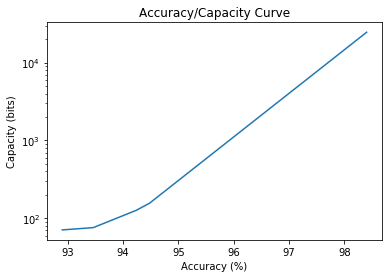

In [2]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array([24581,157, 127,  76,71  ])
x = np.array([98.40, 94.48, 94.24, 93.46,92.90])
 
# Plotting the Graph
plt.plot(x, y)
plt.title("Accuracy/Capacity Curve")
plt.yscale("log")
plt.xlabel("Accuracy (%)")
plt.ylabel("Capacity (bits)")
plt.show()